# Pre-requisites

1. Overview and Setup: Follow the resource links to set up an amazon sagemaker studio domain and user profile.<br />

    1. [Domain overview](https://docs.aws.amazon.com/sagemaker/latest/dg/gs-studio-onboard.html)<br />
    1. [Domain quick setup](https://docs.aws.amazon.com/sagemaker/latest/dg/onboard-quick-start.html)<br />
    1. [Add/remove domain user profile](https://docs.aws.amazon.com/sagemaker/latest/dg/domain-user-profile-add-remove.html)<br />
    1. [Launch Amazon SageMaker Studio](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-launch.html#studio-launch-console)<br />
    
1. Starting Studio: Follow the steps after both the sagemaker domain and user profile are created.
    1. Go to your user profile and click on the launch button to open the studio.
    1. Next, upload this notebook to the studio with the "Studio File Browser" menu.
    1. Next, Select a sagemaker kernel as the configuration mentioned below:
       1. Image: Base Python 3.0
       1. Kernel: Python 3
       1. Instance type: ml.t3.medium
       1. Start-up script: No script

Now follow through the rest of the notebook to deploy a yolov8 model(ONNX Format) to a sagemaker endpoint serving inference requests with ONNXRuntime.<br />

Hosted inference endpoint can serve inference requests on following ONNXRuntime Execution Providers,<br />
   1. cpu: default CPU Execution Provider (MLAS)
   1. CPU_FP32: Execution on CPU with OpenVino Execution Provider

### Contents

1. [Installation](#Installation)
1. [Imports](#Imports)
1. [Model Conversion and S3 upload](#Model-Conversion-and-S3-upload)
   1. [Pytorch Model Download](#Pytorch-Model-Download)
   1. [Pytorch to ONNX Conversion](#Pytorch-to-ONNX-Conversion)
   1. [ZIP ONNX model](#ZIP-ONNX-model)
   1. [S3 Upload](#S3-Upload)
1. [Model Deployment](#Model-Deployment)
   1. [Instruction To Build](#Instruction-To-Build)
   1. [Deploy the model](#Deploy-the-model)
   1. [Inference](#Inference)
1. [Cleanup](#Cleanup)
1. [Cost Analysis](#Cost-Analysis)
1. [Notices & Disclaimers](#Notices-&-Disclaimers)

# Installation

Run the cells below  to install the packages required for Pytoch to ONNX model conversion.

In [1]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install  sagemaker ultralytics opencv-python

  Using cached pip-24.3.1-py3-none-any.whl.metadata (3.7 kB)
Using cached pip-24.3.1-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 23.3.2
    Uninstalling pip-23.3.2:
      Successfully uninstalled pip-23.3.2
  Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl.metadata (794 bytes)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached ultralytics_thop-2.0.14-py3-none-any.whl.metadata (9.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.5/913.5 kB 32.0 MB/s eta 0:00:00
Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (63.0 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached ultralytics_thop-2.0.14-py3-none-any.whl (26 kB)
Using cached py_cpuinfo-9.0.0-py3-none-any.whl (22 kB)


# Imports

Run the cells below to import all necessary packages.

In [1]:
import os

import boto3
import sagemaker
from sagemaker import Model
from sagemaker import Predictor
from sagemaker import get_execution_role

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
# Below variables are required to access various aws services like s3, ecr & sagemaker. 
role = get_execution_role()

region = boto3.session.Session().region_name
account_id = boto3.client('sts').get_caller_identity().get('Account')

session = sagemaker.Session()
bucket = session.default_bucket() # Default s3 bucket of your sagemaker domain 

print("<role>: ", role)
print("<region>: ", region)
print("<account_id>: ", account_id)
print("<bucket>: ", bucket)

<role>:  arn:aws:iam::949300956101:role/service-role/AmazonSageMaker-ExecutionRole-20241119T161572
<region>:  us-east-1
<account_id>:  949300956101
<bucket>:  sagemaker-us-east-1-949300956101


# Model Conversion and S3 upload

This session performs two operations.<br /> 
First, it downloads the yolo-v8 Pytorch model from the [ultralytics](https://github.com/ultralytics/ultralytics) GitHub repo and performs an ONNX export using the ultralytics YOLO CLI. Then, it zips (as ".tar.gz" file) it and uploads it to the S3.

## Pytorch Model Download

In [8]:
!mkdir -p model
%cd model
!wget https://github.com/roboflow/sagemaker-yolov8/tree/main/yolov8-weights/runs/detect/train/weights -O best.pt

/home/sagemaker-user/yolov8-OpenVINO/notebooks/model/model/model
--2025-01-23 15:29:21--  https://github.com/roboflow/sagemaker-yolov8/tree/main/yolov8-weights/runs/detect/train/weights
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
ERROR: cannot verify github.com's certificate, issued by ‘CN=Sectigo ECC Domain Validation Secure Server CA,O=Sectigo Limited,L=Salford,ST=Greater Manchester,C=GB’:
  Unable to locally verify the issuer's authority.
To connect to github.com insecurely, use `--no-check-certificate'.


## Pytorch to ONNX Conversion

In [10]:
# Convert pytorch version of YOLOV8 model file to onnx format 
if not os.path.isfile('/home/ec2-user/SageMaker/model/yolov8n.onnx'):
    !yolo mode=export model=yolov8n.pt format=onnx dynamic=True # To get a static model chnage dynamic flag to False
else:
    print("ONNX file alreday exist. Please re-run the cell after removing it.")

100%|███████████████████████████████████████| 6.25M/6.25M [00:00<00:00, 164MB/s]
Ultralytics 8.3.66 🚀 Python-3.10.14 torch-2.0.0.post104 CPU (Intel Xeon Platinum 8259CL 2.50GHz)
YOLOv8n summary (fused): 168 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs

PyTorch: starting from 'yolov8n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (6.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 185.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 144.7 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 9.4s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 17...
============ Diagnostic Run torch.onnx.export version 2.0.0.post104 ============
verbose: False, log le

In [102]:
import os
from ultralytics import YOLO

# Caminhos para os pesos e o modelo exportado
weights_path = "/home/sagemaker-user/yolov8-OpenVINO/notebooks/yolov8n-face.pt"
onnx_path = "/home/ec2-user/SageMaker/model/yolov8n-face.onnx"

# Verificar se o arquivo ONNX já existe
if not os.path.isfile(onnx_path):
    print("Convertendo o modelo YOLOv8 para ONNX...")
    # Carregar o modelo YOLOv8 e exportar para ONNX
    model = YOLO(weights_path)
    model.export(format="onnx", dynamic=True)  # dynamic=True gera um modelo com dimensões dinâmicas
    print("Modelo convertido com sucesso para ONNX:", onnx_path)
else:
    print("O arquivo ONNX já existe. Exclua o arquivo se quiser regenerá-lo.")


Convertendo o modelo YOLOv8 para ONNX...
Ultralytics 8.3.67 🚀 Python-3.10.14 torch-2.0.0.post104 CPU (Intel Xeon Platinum 8259CL 2.50GHz)
YOLOv8n-pose summary (fused): 187 layers, 3,078,128 parameters, 0 gradients, 8.3 GFLOPs

PyTorch: starting from '/home/sagemaker-user/yolov8-OpenVINO/notebooks/yolov8n-face.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 20, 8400) (6.1 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 276.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 266.0 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 8.6s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 17...
============ Diagnostic Run torch.onnx.export version 2.0.0.post104 ============
verbo

In [101]:
!pwd

/home/sagemaker-user/yolov8-OpenVINO/notebooks


## ZIP ONNX model

In [17]:
# Model needs to be zipped before storing into a S3 bucket
import tarfile
import os


source_files = ['/home/sagemaker-user/yolov8-OpenVINO/notebooks/model/model/model/yolov8n.onnx']
output_zip_file = '/home/sagemaker-user/yolov8-OpenVINO/notebooks/model/model.tar.gz'

if not os.path.isfile(output_zip_file):
    with tarfile.open(output_zip_file, mode="w:gz") as t:
        for sf in source_files:
            t.add(sf, arcname=os.path.basename(sf))
        print(f"ZIP file is created at {output_zip_file} location.")
else:
    print(f"ZIP file '{output_zip_file}' already exist. Please re-run the cell after removing it.")

ZIP file is created at /home/sagemaker-user/yolov8-OpenVINO/notebooks/model/model.tar.gz location.


## S3 Upload

In [18]:
print("<bucket>: ", bucket)

<bucket>:  sagemaker-us-east-1-949300956101


In [19]:
# Upload the model to default S3 bucket of your sagemaker domain
model_location = session.upload_data(path=output_zip_file, key_prefix='deployment_model')
print(f"Zip file is uploaded to {model_location} location of '{bucket}' S3 bucket.")

Zip file is uploaded to s3://sagemaker-us-east-1-949300956101/deployment_model/model.tar.gz location of 'sagemaker-us-east-1-949300956101' S3 bucket.


# Model Deployment

In this session, we will create a custom service script, container entry point script, and a docker file to deploy the ONNX model to an sagemaker inference endpoint.<br />
Run the below cells to write all these files to a directory called "docker-inference". And instructions to build the image are mentioned in the next part.

In [20]:
# Creating an ECR uri to inference with the build docker image
ecr_repository = 'yolov8-deployment'
tag = ':latest'
uri_suffix = 'amazonaws.com'
inference_repository_uri = '{}.dkr.ecr.{}.{}/{}'.format(account_id, region, uri_suffix, ecr_repository + tag)

In [26]:
inference_repository_uri

'949300956101.dkr.ecr.us-east-1.amazonaws.com/yolov8-deployment:latest'

In [21]:
%cd ..
!mkdir -p docker-inference

/home/sagemaker-user/yolov8-OpenVINO/notebooks/model/model


In [22]:
%%writefile docker-inference/model_script.py

import os
from datetime import datetime
import requests
import shutil

import torch

# Libraries for pre and post processsing
from ultralytics.yolo.data.augment import LetterBox
from ultralytics.yolo.engine.results import Results
from ultralytics.yolo.utils import ops
# from ultralytics.yolo.utils.plotting import Annotator, colors

# import onnx_runtime related package
import onnxruntime as rt

import numpy as np
import cv2


class ModelHandler(object):
    """
    A YOLOV8 Model handler implementation.
    """
    def __init__(self):
        
        self.initialized = False

        # Parameters for inference
        self.mlas_model = None
        self.ov_model = None
        self.input_names = None
        self.output_names = None

        # Parameters for pre-processing
        self.imgsz = 640 # default value for this usecase. 
        self.stride = 32 # default value for this usecase( differs based on the model selected )
        
        # Parameters for post-processing
        self.conf = 0.25
        self.iou = 0.45
        self.max_det = 300
        self.classes = None
        self.agnostic = False
        self.labels = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}
        
        self.path = '/home/raw-data/'

    def initialize(self, context):
        
        self.initialized = True
        properties = context.system_properties
        model_dir = properties.get("model_dir")
        
        so = rt.SessionOptions()
        self.mlas_model = rt.InferenceSession(os.path.join(model_dir,'yolov8n.onnx'), so, providers=['CPUExecutionProvider'])
        self.ov_model = rt.InferenceSession(os.path.join(model_dir,'yolov8n.onnx'), so, providers=['OpenVINOExecutionProvider'], provider_options=[{'device_type' : 'CPU_FP32'}]) 
        
        self.input_names = self.ov_model.get_inputs()[0].name
        outputs = self.ov_model.get_outputs()
        self.output_names = list(map(lambda output:output.name, outputs))
    
    def preprocess(self, request):
        
        if request and (',' in request[0]['body'].decode()):
            image_url = request[0]['body'].decode().split(',')[0].strip()
            device = request[0]['body'].decode().split(',')[1].strip()
        else:
            print("Inavalid input. Should be a comma seperated string with image url and device type.")
            return

        ## Set up the image URL and filename
        self.path = self.path+image_url.split("/")[-1] if self.path == '/home/raw-data/' else '/home/raw-data/'+image_url.split("/")[-1]
        # self.path = self.path+self.filename if self.path=='' else

        # Open the url image, set stream to True, this will return the stream content.
        r = requests.get(image_url, stream = True)

        # Check if the image was retrieved successfully
        if r.status_code == 200:
            # Set decode_content value to True, otherwise the downloaded image file's size will be zero.
            r.raw.decode_content = True

            # Open a local file with wb ( write binary ) permission.
            with open(self.path,'wb') as f:
                shutil.copyfileobj(r.raw, f)

            print('Image sucessfully downloaded: ',self.path)
        else:
            print('Image couldn\'t be retreived')
            return
        
        image_abs_path = os.path.abspath(self.path)
        if os.path.isfile(image_abs_path) and image_abs_path.split('.')[-1].lower() in ['jpg', 'jpeg', 'png']:

            # Load Image
            img0 = cv2.imread(image_abs_path)

            # Padded resize
            img = LetterBox(self.imgsz, True, stride=self.stride)(image=img0.copy())

            # Convert
            img =  img.transpose((2, 0, 1))[::-1]  # BGR to RGB, to 3x416x416
            img = np.ascontiguousarray(img)

            img = img.astype(np.float32)  # uint8 to fp16/32
            img /= 255.0  # 0 - 255 to 0.0 - 1.0
        
            if img.ndim == 3:
                img = np.expand_dims(img, axis=0)
            return img0, img, device
        else:
            print("Invalid image format.")
            return

    def inference(self, model_input, device):
        if device == 'cpu':
            print("Performing ONNX Runtime Inference with default CPU EP.")
            start_time = datetime.now()
            prediction = self.mlas_model.run(self.output_names, {self.input_names: model_input})
            end_time = datetime.now()
        elif device == 'CPU_FP32':
            print("Performing ONNX Runtime Inference with OpenVINO CPU EP.")
            start_time = datetime.now()
            prediction = self.ov_model.run(self.output_names, {self.input_names: model_input})
            end_time = datetime.now()
        else:
            print("Invalid Device Option. Supported device options are 'cpu', 'CPU_FP32'.")
            return None
        return prediction, (end_time - start_time).total_seconds()

    def postprocess(self, img0, img, inference_output):
        if inference_output is not None:
            prediction = inference_output[0]
            inference_time = inference_output[1]

            prediction = [torch.from_numpy(pred) for pred in prediction]
            preds = ops.non_max_suppression(prediction,
                                                    self.conf,
                                                    self.iou,
                                                    agnostic=self.agnostic,
                                                    max_det=self.max_det,
                                                    classes=self.classes)
            log_string = ''
            results = []
            for _, pred in enumerate(preds):
                pred[:, :4] = ops.scale_boxes(img.shape[2:], pred[:, :4], img0.shape).round()
                results.append(Results(img0, self.path, self.labels, boxes=pred))

            det = results[0].boxes
            if len(det) == 0:
                return log_string+'No detection found.'
            for c in det.cls.unique():
                n = (det.cls == c).sum()  # detections per class
                log_string += f"{n} {self.labels[int(c)]}{'s' * (n > 1)}, "

            raw_output = ''
            # annotator = Annotator(img0, pil=False)
            for d in reversed(det):
                cls, conf = d.cls.squeeze(), d.conf.squeeze()
                c = int(cls)  # integer class
                name = f'id:{int(d.id.item())} {self.labels[c]}' if d.id is not None else self.labels[c]
                # label = f'{name} {conf:.2f}'
                box = d.xyxy.squeeze().tolist()
                p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
                raw_output+=f"name: {name}, confidence: {conf:.2f}, start_point: {p1}, end_point:{p2}\n"
                # annotator.box_label(d.xyxy.squeeze(), label, color=colors(c, True))

            # result_img = annotator.result()

            return [f"inference_time: {inference_time}s\nInference_summary: {log_string}\nraw_output:\n{raw_output}"]
        return None

    def handle(self, data, context):
        preprocessed_data = self.preprocess(data)
        if preprocessed_data:
            org_input, model_input, device = preprocessed_data
            inference_output = self.inference(model_input, device)
        return self.postprocess(org_input, model_input, inference_output)

_service = ModelHandler()

def handle(data, context):
    if not _service.initialized:
        _service.initialize(context)
    
    if data is None:
        return None

    return _service.handle(data, context)

Writing docker-inference/model_script.py


In [23]:
%%writefile docker-inference/dockerd-entrypoint.py

import subprocess
import sys
import shlex
import os
from retrying import retry
from subprocess import CalledProcessError
from sagemaker_inference import model_server

def _retry_if_error(exception):
    return isinstance(exception, CalledProcessError or OSError)

@retry(stop_max_delay=1000 * 50,
       retry_on_exception=_retry_if_error)
def _start_mms():
    # by default the number of workers per model is 1, but we can configure it through the
    # environment variable below if desired.
    # os.environ['SAGEMAKER_MODEL_SERVER_WORKERS'] = '2'
    model_server.start_model_server(handler_service='/home/model-server/model_script.py:handle')

def main():
    if sys.argv[1] == 'serve':
        _start_mms()
    else:
        subprocess.check_call(shlex.split(' '.join(sys.argv[1:])))

    # prevent docker exit
    subprocess.call(['tail', '-f', '/dev/null'])
    
main()

Writing docker-inference/dockerd-entrypoint.py


In [24]:
%%writefile docker-inference/Dockerfile

FROM ubuntu:20.04

# Set a docker label to advertise multi-model support on the container
LABEL com.amazonaws.sagemaker.capabilities.multi-models=true
# Set a docker label to enable container to use SAGEMAKER_BIND_TO_PORT environment variable if present
LABEL com.amazonaws.sagemaker.capabilities.accept-bind-to-port=true

# Install necessary dependencies for MMS and SageMaker Inference Toolkit
RUN apt-get update && \
    apt-get -y install --no-install-recommends \
    build-essential \
    ca-certificates \
    openjdk-8-jdk-headless \
    python3-dev \
    curl \
    vim \
    && rm -rf /var/lib/apt/lists/* \
    && curl -O https://bootstrap.pypa.io/get-pip.py \
    && python3 get-pip.py

RUN update-alternatives --install /usr/bin/python python /usr/bin/python3 1
RUN update-alternatives --install /usr/local/bin/pip pip /usr/local/bin/pip3 1

RUN apt-get update
RUN DEBIAN_FRONTEND=noninteractive apt-get install ffmpeg libsm6 libxext6 -y

RUN pip3 install requests opencv-contrib-python ultralytics onnxruntime-openvino multi-model-server \
                sagemaker-inference retrying

COPY dockerd-entrypoint.py /usr/local/bin/dockerd-entrypoint.py
RUN chmod +x /usr/local/bin/dockerd-entrypoint.py

RUN mkdir -p /home/model-server/

# Copy the custom service file to handle incoming data and inference requests
COPY model_script.py /home/model-server/model_script.py

RUN mkdir -p /home/raw-data/
RUN chmod +rwx /home/raw-data/

# Entrypoint script for the docker image
ENTRYPOINT ["python3", "/usr/local/bin/dockerd-entrypoint.py"]

# Command to be passed to the entrypoint
CMD ["serve"]

Writing docker-inference/Dockerfile


## Instruction To Build

This step needs to be manually carried out in an AWS EC2 instance. To build the image, download the "docker-inference" folder from "File Browser" section and follows the commands mentioned below. <br />
1. Build the image with `ecr_repository` tag. <br />
    `sudo docker build -t <ecr_repository> docker-inference/`<br />
1. Re tag the image with `inference_repository_uri` name. <br />
    `sudo docker tag <ecr_repository> <inference_repository_uri>`<br />
1. Create an AWS ECR and login into to push the image. <br />
    1. `aws ecr get-login-password --region <region> | sudo docker login --username AWS --password-stdin <account_id>.dkr.ecr.<region>.amazonaws.com`<br />
    1. `aws ecr create-repository --repository-name <ecr_repository>` # Need to create only once<br />
    1. `sudo docker push <inference_repository_uri>`<br />
    
Note: Part of command enclosed in `<>` refers to a variable, which needs to be replaced with their actual value. Run the cell below to get the actual value of these variable.

In [17]:
print("<ecr_repository>: ", ecr_repository)
print("<inference_repository_uri>: ", inference_repository_uri)
print("<region>: ", region)
print("<account_id>: ", account_id)

<ecr_repository>:  yolov8-deployment
<inference_repository_uri>:  196327195270.dkr.ecr.us-east-1.amazonaws.com/yolov8-deployment:latest
<region>:  us-east-1
<account_id>:  196327195270


For more information follow [here](https://docs.aws.amazon.com/AmazonECR/latest/userguide/getting-started-cli.html).

## Deploy the model

Now, run the cells below two deploy the model to a sagemaker endpoint. The instance size used for deployment is of type 'ml.c6i.xlarge'.

Note: Make sure the image is built and pushed to ecr before trying out this part.

In [16]:
ENDPOINT_NAME = "YOLO-V8-DEPLOYMENT-7"

In [72]:
model_location = 's3://sagemaker-us-east-1-949300956101/deployment_model/model.tar.gz'

In [73]:
inference_repository_uri = "949300956101.dkr.ecr.us-east-1.amazonaws.com/yolov8-deployment:latest"

In [74]:
yolo_model = Model(
                   model_data=model_location,
                   role=role,
                   image_uri=inference_repository_uri,
                   name='YOLO-V8-deployment-1')

In [16]:
yolo_model.deploy(initial_instance_count=1, instance_type='ml.c6i.2xlarge', endpoint_name=ENDPOINT_NAME)

Using already existing model: YOLO-V8-deployment-1


-----------!

In [82]:
import time
client = boto3.client(service_name='sagemaker')

model_name = "YOLO-V8-deployment-1"

# Configurando o nome do endpoint configuration
epc_name = "yoloface1base1-serverless-epc-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

# Criar configuração do endpoint serverless
endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName=epc_name,
    ProductionVariants=[
        {
            "VariantName": "onnxVariant",
            "ModelName": model_name,
            "ServerlessConfig": {
                "MemorySizeInMB": 2048,  # Memória alocada (ajuste conforme necessário)
                "MaxConcurrency": 1,    # Número máximo de requisições simultâneas
            }
        },
    ],
)
print("Serverless Endpoint Configuration Arn: " + endpoint_config_response['EndpointConfigArn'])

# Configurando o nome do endpoint
endpoint_name = "yoloface1base-serverless-ep-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

# Criar o endpoint
create_endpoint_response = client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=epc_name,
)

print("Endpoint Arn: " + create_endpoint_response['EndpointArn'])

# Monitorar o status de criação do endpoint
print("\nAguardando o endpoint ser criado...")
while True:
    describe_endpoint_response = client.describe_endpoint(EndpointName=endpoint_name)
    status = describe_endpoint_response["EndpointStatus"]
    print(f"Endpoint Status: {status}")
    if status == "InService":
        print("\nEndpoint criado com sucesso!")
        break
    elif status == "Failed":
        print("\nFalha na criação do endpoint!")
        break
    time.sleep(10)  # Aguarde 10 segundos antes de checar novamente

print(f"Nome do endpoint: {endpoint_name}")

Serverless Endpoint Configuration Arn: arn:aws:sagemaker:us-east-1:949300956101:endpoint-config/yoloface1base1-serverless-epc-2025-01-27-17-59-56
Endpoint Arn: arn:aws:sagemaker:us-east-1:949300956101:endpoint/yoloface1base-serverless-ep-2025-01-27-17-59-56

Aguardando o endpoint ser criado...
Endpoint Status: Creating
Endpoint Status: Creating
Endpoint Status: Creating
Endpoint Status: Creating
Endpoint Status: Creating
Endpoint Status: Creating
Endpoint Status: Creating
Endpoint Status: Creating
Endpoint Status: Creating
Endpoint Status: Creating
Endpoint Status: Creating
Endpoint Status: Creating
Endpoint Status: Creating
Endpoint Status: Creating
Endpoint Status: Creating
Endpoint Status: Creating
Endpoint Status: Creating
Endpoint Status: Creating
Endpoint Status: Creating
Endpoint Status: Creating
Endpoint Status: Creating
Endpoint Status: Creating
Endpoint Status: Creating
Endpoint Status: Creating
Endpoint Status: Creating
Endpoint Status: Creating
Endpoint Status: Creating
End

In [88]:
model_name = "YOLO-V8-deployment-1"

# Configurando o nome do endpoint configuration
epc_name = "yoloface1base1-serverless-epc-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

# Criar configuração do endpoint serverless
endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName=epc_name,
    ProductionVariants=[
        {
            "VariantName": "onnxVariant",
            "ModelName": model_name,
            "ServerlessConfig": {
                "MemorySizeInMB": 2048,  # Memória alocada (ajuste conforme necessário)
                "MaxConcurrency": 1,    # Número máximo de requisições simultâneas
            }
        },
    ],
)
print("Serverless Endpoint Configuration Arn: " + endpoint_config_response['EndpointConfigArn'])

response = client.update_endpoint(
    EndpointName='yoloface1base-serverless-ep-2025-01-27-17-59-56',
    EndpointConfigName=epc_name
)

print("Endpoint atualizado:", response)

Serverless Endpoint Configuration Arn: arn:aws:sagemaker:us-east-1:949300956101:endpoint-config/yoloface1base1-serverless-epc-2025-01-27-18-28-01
Endpoint atualizado: {'EndpointArn': 'arn:aws:sagemaker:us-east-1:949300956101:endpoint/yoloface1base-serverless-ep-2025-01-27-17-59-56', 'ResponseMetadata': {'RequestId': '11577585-2bbd-4509-b463-d8e0dfc08aab', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '11577585-2bbd-4509-b463-d8e0dfc08aab', 'content-type': 'application/x-amz-json-1.1', 'content-length': '115', 'date': 'Mon, 27 Jan 2025 18:28:02 GMT'}, 'RetryAttempts': 0}}


In [1]:
from sagemaker.predictor import Predictor
#endpoint_name = 'yoloface1-serverless-ep-2025-01-27-11-45-09'
endpoint_name = 'yoloface1base-serverless-ep-2025-01-27-17-59-56'
# Inicializar o preditor com o nome do endpoint
predictor = Predictor(endpoint_name=endpoint_name)
#predictor = Predictor(endpoint_name='pytorch-serverless-ep-2025-01-20-00-58-51')


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [7]:
#payload1 = "https://raw.githubusercontent.com/roboflow/sagemaker-yolov8/main/yolov8-weights/runs/detect/predict/dog.jpeg,CPU_FP32"
import time

#image_base64 = "/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgICAgMCAgIDAwMDBAYEBAQEBAgGBgUGCQgKCgkICQkKDA8MCgsOCwkJDRENDg8QEBEQCgwSExIQEw8QEBD/2wBDAQMDAwQDBAgEBAgQCwkLEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBD/wAARCAMgBLADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDpda0NNM1G68NeH2tfD1iLVpY7jcLx2lz8p3MvB4+4Tx6188eMvH91a3lx4fukl1HUdKuBqDXWnRNEXiJ6lI22AqVB5JBzX0le+FvtcsVrp2pX2n6zIy3EG/zHt5JVAwkkiqw5J+6gBPIz3rh/D/gDwprninXNL+IPh3TH8S2UZW6htvMjs2JY7ZkgkRW3kcEkbSRnOev5pl1bDSh7TEJyUV5Xfnff5XsXJxa905jU/HHg/UfC/hvW/D2k6pqtpqd4Y5obViJUumUNJlSoBbrlhx6cV31pfara29nqWkaXe6fpt7II1s7z95cFslS5mQBCeQCBjGcDd1rNi+Cb+GYbe18Ma5aRaNfagJbqNfNiuRFtKkJI7sVZicFkC/Lx8vJrt7/xB/wgelmCykh8i4cW6WskgCKQc7gqDcW5BLbsHvms8biME6NsC3Lm0ad9NdCrw5fdVrl5U1fS9Lt7nWNN/syaXbBuaETZwcjcqnYSR3wW9z1rzv4n/CW08ea3pl1q2s316lqHlmSKwERYgZCi4YMY4z0KYbnBABznf8bePL6G5sLOVriPc6kwzeXEsLZJLGQxliGxkAAMfWrmuppgt7TxHb65cx3esJGmwz7yR0AdGYBCMYDAKSOCTxXiUJ4jC1o16fuys9vT5/eZtRntfY+L/iv4Ctvhd4gtL6PXLefT726Mka2W5pLVQQ2CHHOM4BOM+grK0Tx1H4X1zUdS0TxG1gmr2zxvcwRBplXIYKAQSu4gAkHIGea+l/j58JW8Y+D1uNPkSW7tla4kaRygUBcnGI3LMBkFSV4718b2XhLVLu8ubTSYY7l7WKW4YNIEDRxgsxBJwSAM7c5Pbmv1DIs0hm2D9pVfvLSS/ruYyXK+Y9fsPGV5Y3+k6rD4shfSZ28qWOadJreHzVDOCzhmJGW3KVyG4BbqfTz4rt47tfBVvq2r38T2saxf2faXFo7RONxkkYljMACMMSq44AHSvmzwzB4e1q+sTPZxWlyZIzDCrjyGIXDNIZm6MRkgFRnOCOBXvlnpWmSJPceLNctINatNk8NwY3nSVMDaAQQGEa4xhSAvIDFeeXNsFSlJdHZ7JK73X/B1KS9o7dTo9QttQ8U2F/pSR3upW2iWrNH/AGpZSFpwuW2s+Fk3noQGBxgkkVD4K1hNEsdTu/FXh6zM97pzWul2d9JBciO4YlBHsY4MYTa4JY/NnOOtcbr+pXnhnUdP8Q6hc3d2J5njvN0jO8TlcxyxyMdp3Akgg9Bj1A6PTPEWvR3MH2XTYLNXuFM10ZHhluiCAACozGG43FAAT1zzXjqlKnh3GS3X4p/r3LhqveN7wheabeeGY/C3iOxuLJwEm0v7PNDJPfJHIQVYTDy2RSCQFPORjAxnqLnxF4lntpvGdr4Ihg0zTGOk28DowaNHj+dnMR3ByAxLbtqA8dqz73x1BPPpsOtOupR27O9x586xKx3AxRshUGZkOBuDMR2C8CtvVvGFtbtqWv6NYodRu7GJri3R2vhMJZAJo3iCqchSvDL8oORwcVwQ5pT9o4+qv59Ouu+2hnKzfMcn4F8ZeCl1iS60EXM0NzA0V0y3LPLAikB40Lo7SELxu4XC8Yzx2GoeOtH0fTPEqWNrfPptlERHqVzMDEsWRtARm+UkEDgKQwbAGM1p6V4Y8C+NNMN5oOLGczGSBlkaMIgPlsxhAKoCwKjO0nHIGKwNG8JeIV0LWNHTUYvtIvTDf3QYeS0EYYyjaUxlgACvdiPpWuBp4bEVJ1bNOG6k7ffb8DfDLkcpW2NfwT8QfD+t+ELPV7TXrBJLfT/IkdbqMRSzYBVWjYEwkqeM9cHHPNcr490my+I3hyw1vVE0y21nS2Nx9qwmX07BMjFt25owMHBG0N25zV3QdH8NeB7m/tPAZvrK68WtFbXktxLG8VvjLHag2hXZCQADxxkEc1sa/wCG/BD+H7nWLS8uJZfs5VppVXUWEHykkfZyoKiRUDMAykR4Iwa5aMaNHFe3pyaSkmn116W7N3W/yMovmT5jzTwVr3ha18XWVt4aa4vZtZg/sxNRll82S3hSNpLZk2IsMbAoCWIZgRxt5Iv2/jHVtL8MnX9Nuktbu+ghs2t5Qsj31xtwLh1cOQqkZLnoccNk4d8PfhFH4osb+Tw3cnSrW8KXNjfRXAlkuL2MbvmgjEgigBVg0ZdWGRw3Aq7c+Afh/p8t/qlzrsN5bS3VzdRBpW2Qs+6RlUvxlZWOFO3cuARwa9vMsbhaq5HK8otaW7/gDcnFPszq/Cesxs097GlwdZ1Py1mure8higiR3wYwmFZzkZ2kcYUjuK0/iP47tfBmlrq2v2Op3NlpMUv29bFYzHLBKvllpo5SFkKMQSoJwwHy4POHZS3UetWCahPpotLa1EkUcNhbC0diWZ8TLtEZYHIAG05A5NbXjnw5pXijwU8etT2i6ezpDNfWxuPNhBHEcwjRlaPaADkgEMATyK+Y5Y08bF1X7m1le9upS0djgNW8LXd78O0udKudctRe3FvrWhPYrGbguSSHKzyQ7ZDvKMu9lOFxj7p+TfECNYX09hao6O7zxTF7bypS+471KAlVIPGASB0zX2HpuleIPC9oiaLcpM+n3It47W+jkSxYMQJZnkKmUyHDDaG2qoCAIMLXzr8RYIJPiNFeTwXECXZ/tS7s7i08q505IyTNHInRjiPKsOHVlPXNfZZBXp+3nRpyunqu/wCXYh++0zyS0nFjfO8unpJcQMUaO4h3qJORh1cY4OcgjrTreNba9EljFtlnwJIzt27mJGFAHCgkYB5wOT0r0bwl8KvGvxDsvEOpTLJpT38Z1S0t2t4j9uk3lggBcPCCHYhyBGcckDBFQ+A/FPhSO2TxNpECWzOb20uv7Shmt5CgAOxoWeORgQu5ScgY4wa+kWMw8qjpxmnJbq/9fgRdPY5RrG2jjdgMlXYszNkkqORtAyBx1JxzSeHtRaOG5SxDw3TSkCdZNgCnCgfLySSevb1xVbV9SWTzYLIXAR2LTSAjEvfOAOBmtDw+uiT2Wn3NqJLeXTpT9ukjdg0yliVLHOACDgYxnGDk1trYNiay0NdPt01TVpop4xI8bJkSbnVuUKht2CP4sc9uRxua/pd8/g+1uNWtrS9iIEdnfM6pO6RkZijbH7wKpAIydu/pgA1q+HLm9vfEj+I9B8OJcaLpwEdxaiJZ5Zlk2ptMbD94C5ABK8HB69YNafw9feC9KmstQv7PV7O5mjOn3c6urBipeaMDlfvYJI5245KtjNt6Ci3c4vwhOlp4hgkjW4lQsy/Z1JBcEEbSyjqQMDA59O1e8adb2ek6ZbeLIbDUdKntLpE1BLjUhArWjEeUUwuQGCIhLhlbOMgkbfNPhPDa63PdQXPgmLUItPAuLq6+0OJWXcFURoSFMm902gEEcknG7HZ+MZNI0fVrrUpdOivdH1FYkzJMYAlwAVKkK7FSAWDr83PICjawwrTfPy2/r7xPVmX4x8J+EfGkieKPAmo6llZ4m1JLoeaYTJIymXCgEqgCBgg2jIAPOadc/CfWtaePWvDGtWWt2mqW4uG4ME0D8l4/KBZmIwMEf3lzjNO8Vx6Tr9hp934Y8Q3UzzzyNJYwWUhmBCyNLPbuSFeMuMMpKsC2eccHhP4m20GjtpdmlvYDTNLEE0MYBM0vnBHkKujHzyhbEabfmJOTgAOLqqHu6+v9fcGpyth8P53guIb+R4rtQzLYxgNOoHV352xhe4OWPPA4zV8I+F9EufGEHhu41ySNmmf7R5cYBVI0aRgCxAZvkwFHXt6V694G0C/1zxFc2viya4vdEvreVfD2trJGjoyNukjwxzuYpgK/8PPAYEcn4o+Ces6X4m0bV9L8R22p6jqbtPM91ZxRRQuQPLR40ZyGIDAttK5wQT1rkWOj7WVGU7O34+uu3W+orrqztvDHhr4ReEdc0e/0W3sb6/1UvGs0xkuRaSNHGhRo3Oz/AFm9wWGV5ycba1Lv4aeAfGXhm70jSpZY3tr2e4SSOyQvpzyyGSSMsnJjLl8qSuBjuK88bS9Ul1AXXhBjaXIklZvLc4t58YO3c2QFJADH+Hkng13Njf8AxPs3udM8SaoLTVbK+iul0mC3EcV7Iw3OvmRHYAVK5bPJ3A7eM+dUpVLqcatpeb/4fTX0J+ZDpth4UOn3OnWXhrT4NItrG70mw1TV3ImaZWEgKrGBvkDs3zE8qVAGAVri/iZYWGg2WiaVpC2MV/plis11+6jkeSWSRiRI20CZxkArjaACOxNdg934n1N3vNHurTWLJHIvdPtdPAbzZVkZ45rdTt2q6lSzFX2kEAHAryXSmu7jUG1G9uZru5EhZlLE4QHAUHqAAMde9dWFi/aOpz3S6X/O+xUXYyLTTxNoSSG7Y3gmKqzEBFGCcYBy2TjttHPXPHe+E/EOmwKby5tbXR9TtpxbtdNCXgOIyCY0H8bAjIIwM5OO/n+taXqPhm7S5P2WNJZGaP7KzPHDyVAO4ZBwcYOeefStm6j07UbW0uIGkgUA+ZJcYCK+SzMducljyTjJ9MV6VWKqRvfQbVz2n/hKbmXTS98kup2s3mpZvIonVvlzxCFyeTJt4UY57Vxuj6ZHrWoyx+C9HtLvWZ7d5XgldY/KXBOS+co2MnAYY6ZxxV7wDbalr5hu5Nam07TRIYY9RVmiKYBASIgY8zknB7HOMVreNvHWo6bpdhaRQ2OhWMDNLJ57ATXUYkwqiMDLMwwAzk4YFsg9PJc+Sq6UI+96/wBfcgtzMt2Hg3WtP0mCHWdY0i9keNo7qxaZrm3hjjbzIxGF4aQOBkLuIBBIOSD59JqnizQNUNuvirS9Qj0YBg2kqX8y2JUpG7hVON3BDhWy0gzzijxH4+vIb+4XSdS3xXMTSJHJyB3UK7ANkEZDZJ5xisXSPBd74i8Jal4ohnW0htm+zXCQ7me4bBeMCMcyZIJJPAIzyeK6KHPTg54iyT/UdranaJ8dW1bw5q97qnhvw7cJBPBHHbz2BcxWs0ZjdY2VPlBcGQAkcswyQMEvPF/hXxX4c1bTPDnha006SZLCza0gYxtMXlKb4zJl5ACqMqgbgpwdo3Ep4W8A+DotKutRS+N21g0On6g80MkVvGJfOMrvlSCojU7XUgheeuRXX2PhX4da9Z6V460qfWo4FkexmhmMZNrFHEANpjI3qOSJASwznAxkQqtCk1yQdr7rv0uhXT6Hn2h+KtM0bwn4s8Matq1vq1rZzFbCG+tfIjmbZJGj25D+apYANjG1WiTPDZGodB0PxZ4Pv/Cl8+rwXWlSR3U1m8JlvrG7muDF95mCCNkAZmIG1WUk1o6HYWXi3UvEngnxKuk6lqAtXFndRXCpBcRBZCszOyeYJ4XwGkYMcSZIwN1a9po8knga3RV0m28VWGxrRrPUY4rmWKNsqsxmRSWLhUViH3Y4OG3HtnVTUWlvbbzB6aHz98SfB/hfwVPaaBpl5fzaiHmN214oiIi3ERgx43RlsEg5ZSpBB6gYt7rF5Jpw02WQxm+iRI8TACIeYgJc9spHgDPcE16t8ZvC1uviOz8cya1bWk88Fo8OjXtuHugWVwC3BWSMtG2Gfjt0C58y0HRBrGtxQ6jK8du5ll86O3aYKqKSSFUZYZGMjgZ5rphNOClL1KvZHNxM32sfaERiWwV4AA6DGOg+le+eE9etH0Oy1K8eN72dGuDCh8pFAGAXYEYAxkkAlj+vH2UfgWws7i0OhpqsUin/AEiaAw3WckZDCQqoAAIwuc5B9auwal4LghjubGy1JLJIhYt59spLtwzYkB4xx8o65yeDg8+JaxEeVxZMveE1vWtN1K8tLuXRobm6eKSONrWAo0j5J3MSuSPn5PJLA1wU0s+pyHSbbTrdfNkG2RRlhjoCzdAMZJPatrWpjo81xrGlWZhjkBS3VCWjjBIYqWJycAc89etcwLq6MJ1uWHYs7bdsUZCqnKk56AE8YJ5ropRSj7pSR2/hnwHdmEq+nX081tIFaazjEyqzDKjHBJwRlRzg0ulaZqo1m48P6NteeZizXDIAAgBDHL9MAE9RWp8Jfi9YaFfT6XqdnfSwTZjjWNwBuMeAzbjjOQR6YPtXpuh6ZoOu3STaDZTec9qUkSMx4jiwNwBYbQCepPOOB1rzq2KqYapL28fd6MzlJw3ODfStB0DSJJPF9zqcN5BciT5IQQyq4BVQT82TzkjBxxTG8V6bqMdxqGmSEwTYW6jtYCSqYVfnUjIBwowMgZ4AFdt4m8F6FqsQfTX02G7soyrNesx2QqNqqEBCkgdWzuJ6GqD/AAttNQs7K40TxLbQwOqPNbGTyfKtiUDyRsBmQhhgbjkBuh5rKGOwsoqU29fUlSizF07Xr7W7qbTbW1mNtNE1rJJDAfKtYCBtV2GcrkKeeSQe5OHaReWhsrvQ9Y0+O7F6rJD5it58MW1i8sYB+TI6uQcLwOtSatb2vhO2vppL19Xu3ndY7W3leKGztlJKSSFBmYquOCQB6E81l6f4x0G50wJb2uoXc98r2mo3chyyJvBRhhehJUEZ5Bxj16LRxNPmor9CraaDvGN/JrMWhaJpMljplpaRparAgICo+WUk8lgCSTgcNISevENx8Ivsph1OLW7aZpFRpoN20w88nYBk5GAFJBJOTgYy/XbrT9Oji1KzsPtdzawRuhAJHmYJBGBkgDBIyDnOcVV8F6f4ybTdX8VanpRn053SO4knlWIrKzKFCoxBkOWBKoCQOTgZNKPPCK9m+VLv1Eua2g2C9S4ja5v1DfY5D5dsx2u6ZChScZIyMsoOeuDT5PEcWnQvp9zKzSElo1fJKrkE4AOBnGATzjp1rldfsNY066gkma3METSBGH+sYSNv+bnnGeCO3FX/ABTZpe2UF9Zalb3hgjhWSSHIAaRAzR4Y7iUJK7hwSOK6vZJ27FJX9CnrfibV7zT38uGWOIybeMYXp6jPpn+ddRp/grUNK0y0uovF+gS3gtzcrDDf7rhiQT5alco784wDnIx0ryxX1BC8MdvPciNgGKqWABOAB9Tx0r3j4TfDLxt4y0B9a0u/0zRvI8y2tvtXnxyyBApYKzRmIAk9dwORjGOanGTjhaXM5KKRTXY84i8KajLdRaxLLb2llFdSmOWTzEuZCDneyBW4YjAI75zXU6CtrpkZ8Q2QNhHZRuIJLmRU3SEAqo3YAKsMAgdzxXQal8I/ivH4m07REiSe41O2e93x3G4oFYI5ZwoAK53EA8g8HJxWp4m+E2jrP4Y0/X9aW5vAZpdVt9PkVIoraKPMKxucjzHIJYnIHIAG35uGrj6M+Vc90+2ui/4a2oWb3PLdIv8AXtVyNMnaOKMqiMtuHLKeCAT0zwPfPety90q6h8QDV/FdrNqMUO6SaKI7WdmXu7DClSeTg9Dwa6H4xSjQvEmg+HvDPhpLFNG0eBLVI2WRrgEtIZnK8sASQC/OQexFeYeJNa8SahqFu+v65dxwhlZtx+TrtJABwTgEfhiujDzliYxqRXKn9/4CWpvadp9zP+/LQxzXOVVmtgTCckYUqQcHOOdvHXiobnwL4+mbTbbT7CEQS7IbUiYBpXJ6gE7myeCcY4NZNxrGo6V4rstItLu61Kyv1BjVBukZyTgLg5yTj2xmu38S609lqNtqOo3UN7dSW6Sf2b5iOsCjaRvkjbgkYwowQp55zXVTi73eqCzRXs/DFzodnHeXnhe0v9RRpFW4tZg0cu75QWY8FVZSQUIyTzxg1b8Talb2enWba1oBsrtjKV+xSBlck8hghwRkYCgjGMVlnxlrWu3KQXwaKC7AgW3tmCoACSiqDwoAwB2455rQ1DV7nSrGCDw5o9tY25aSGaRYPMuA4BbO5ycZBIO3A/pz14x5otK8vX+vyJafUpeKvExi8NwzLHJlwpihaDYVQnOQAxIJBz+XtXER28+qWAubsqjg5wWAOM4AA6n869Dj8I6peWVtfarPBa21xG1x+/VssmSFIGMAnGcE9x61ZvdE0QaTGusW6wXoUSRzRbT5iBcqpGNoPAJIOQCcjNRTrRprljuPmsjkbWXQ/DXgaeW7E018Zt0NpwImGAVdiBk4JY8nnpVXwl4muNGuLmy8QeGtMumlbdIbq2DyrnBAUk8djWHbx3mua9NbyXkdvGg/eSNuCQrkKGIIyAT6j8K7K08FaPeCWa18UPqFw8io0yqSCSQpdt+Cg5OMjt6VvOMYJqo739dCnpuQXWmr4kme80FYIrosjSL5QccAKqqc7VyNxLZJ7V1fgrSrzxRqp0fxFYzS2V1IiySCYotwQGLBmA3KApIJUZGeD2rn9N0G/t9Ukg0lzFBHMfJbzizKGHAYjgDAJ4HOeT0roJQ3hu7hW5vBdXFwjmKGKZ4wQVIJZgMYxk8E5/SuatNfw4vpp3RLfRHs3hnVx4D8USRXGmWttpdhb/Y9NXT5JHtV4T5kMi5kZQXAYryZM5yNx6QeEW0rxZD8Q9MX7MmqQ/bvs8kiwTp867slGAcON7BsjGfy8f8ACnizTvEWn/8ACK+I7KS7tbJomM9s5WWGPkHr/rARkAEdR717N8N9M8WQaHY+KvEGiWdtbRXJSOS5vy7Pp24SRko4yECBSCcMTghSOK+exUJUlzSdnt6+e/X1J5W9tz508YWfivxBDe6xpqmbSotSe3F1HGFjDgkFQFLADAOdrMPc1x2n+GtauTfm3tpZ1gGJDDAzpgEAtkDgZYDr1NfW9h4PTSPCOsaDb6zpNzZ683lRtDh2tpHkYqDHLkAEZJdBu5cAEhSvhEfhrxLp/wAQP+EA0i1NxqReJo7qzlka3W2cK63BPURlCGbdyPrgV7GCxcZwcKdlbbpourLXuqxyLeEtW07SYtVOo20kEsjWbWqyDzxghmDR4ztIAIYenY1pWt7/AGf4ZffYWMxeRkjhkziNcgMWI5yOCck8AmpvileeN/Bnia88MeKpEeeGxhuIJbeQstyJc7ZFYgHkAg+mMdaq2uh+KdWtdNv5o2eyscLFHOiwbkBG8E/xHqNx5JPeuhzdSnGU2rPUl67nUad8NdPgtYPEWt+LrRbe5ZHt7mxlQw27IdzMN2GcDGAAOSax/E/hDSdc8SWVzpOrw+IAEDyRQyKHkLEkBsHqfYnFYeqX6p4zl09dBGoWMEctwbdLlUwgUsWLNhRtUE4z29aTw/Ppd4g8Q6LfQ2txcSM7WYOHUZJCrwBxgEEVNNVF+8lJ7dlbX01CztcyvG+k+LLW4/s228MS6ELIparbmbc8ryMSoJY8cHoOKfB4B8WmxgGr+Grs+WnmXFxF+9MIGclgoyMDnHp9DXS67bwSapZanqmtNJGHjufOIYGKZWJVdpyWICg56DIptt43vbPWDeTatch7lmjaRZBtbIwS3HcH0rojOooLks38x3fLZHMf2HoQnggiS72SxPJBqEIIjlIPB2nkDOBnjnmrBm8HaPpMF2dXvzqyTywSRC1AiSERgowYrySxIPQ8YA/iroNdgupltYvDdlJFY3rFpIyEys+0syoR82CFyATjOK5+71/w/wCKFt/Dw0qbSr6CQRXFw0+5GKrtyyt/TB5PbinGbqRW77+XqC1MZvE3hK+iuIQn23yrVlt1umMRWQ4+YFRjgknnggH2qh4beHUHs1lgs1sVkDN5mBuOQWDHqR2H1rqIfBXwy0bVftVxqja2pXa0MMZtim3huCxyTng+nOM1p+KvhjdeG0tvGOjeGL618LXZVkia9jeUuQTkDGQMfdyOcHmnKtThaOqvs3pr216/IatsP+H+k3F7dudJvYLRbl5o7NVhYyrFzI6HBVWGAQctyMA5BFbOhW8PhPSZ4Tc3Mt5c3C3RhYKIlbLbUVByMhsbc4zipLtvEun2dpZaPDKlpd3h+zSPIiEFgoLy4GFJAwQBj5BjNZuoWOjaGRf+IdcF1f8AmHdBBIJcnjluMDBPGT16jiuapJuXLJ6PotX8xtO9i94ovbyFVukItp5VRJHZgQz5LgAE8BSTgAYxXm3iaSaJRcmDZcwS7mn5AZ85BGeDjAPA781peL/FVrqjC0tF8gGRRlefOfkhsEZwBxmuK1nU79pGguTJOYhlt2D1GQSfoa3w1GcbOQKJLF4yvbRL1ZUjuZ78bi85JKycAsAvcqMYPAFei+HPhj4l8T6PpPiHwb4du57LCRrJdEI80yqzOVUj5kBXAIzk8DmuX+F/wxn8WD/hI7i4tClpfC3uNPkLCV0xuLDaCSB3AGSM4I5I+r7bSPFmo+FNch0jT7ewHheKKG1E2YJFkbMoJQLxHg4TJHUgcMQMMfjI4f3adr9f+GNFGMtzgLnXfGeptZaXreh6zqyarIVmtbeEiC3SIMiyI4GCQPMAOeAB1IFb1/4s8Z+NvDuqLN4RvIrxrKa0bydCKyWxTcY1QBQ7FiWJwNq8ZBJ59O8A6JfX2nQaV4wl0/VdP0qJLyC4scghwzEgscA4OQqkgFc8NuJp8fxb0DSvFl3JqOtarLZWhK7HuSsqom1AEj8tSCSoIAOSWOcgCvn6uJjJ8lOF7O+j0NVBtbnmHwf8M+PPEvh698F/E/wJr9taW1vC8F2ltsliQMCIAAQfnVzlhlh3xitTxl8GtI1jw3NH8H762vbK0u3iv/NlkNx5qbUfax3AuryISSByc5UBq9M0H41aI2rz31/cXk8EdvM1neXFuEgKtCZDC2SMPypBI5HT1N2w8U6PYahqOrxx6Tptxe2dpqcZtyyrf2kgXfI4XhGY7lO0E9CSxGBnPHV41PaqHJfp0v5r/LYpwUetzhPh58J5NMuLrUfHWm6dealKgt45LUG51GZGYia8kYuV8zyyygRru3MGznp4VYfCTxJ4u8aiDXvBs+haLEzSR2uqSm1+0lSN2A7iU5HOFGT0FfWPhWwgvXi177NLZGW1LXsksLMZGZmQSBN3ADMOCegTAGcVwHxo8NiO30yK4vIrnXbS8kbTZLiCJfMRxED5wbG0qsQKYXaWkIBB69OEx9aVZxctXp109P8AMznFyWhU8efDzw5Fo+iWeveJbZdS0K2lmtLloWgh1eAx5+zzyIWOYyFDMm5gmem7cPlzxNF8YLPX7qy8Xpq7RG6S28u0LNaMxAaOG3EfyEMCoRR/Djjg19fWN94k0Lwz9n1rS7m2024tGuJJrZftMhc4LNcW7Elo1GQzIqkMcYwNzeA+Mvid4zYi3N+bi2naKeEnTVtI4GyCDbrsG3aBgMuR1wSea9jA1pS0jZr+v61MotwfKZVv4O0+78FrceILHVbXWpGcQwzWQWIgNgqRuDAqAMkqAT0zVjV59MTQdI1S2ukubS8unWz09ZRhYYJD5jzOBkyO4jwBhVUKBnArn7vxL4hntpdP02e6S5lkMh2ygbzt+YuT14B6/wA65vT9J8TQ+RHg2lom6dXYBUXjJKjqeB2FdHspVHebIa11LuuQ+L/CEmm3EyPam3vzf6VbyxA7Xk2sWKkZwQi8EdB0rp/AehyeHvFcNvrOj2urFke71pbgGW0tRJuVWlaM4woIIBYZY4zzXpXw61TwX4q0fTvDPiDwqniLXzJLDpylY43/AHh2upfKMJNqhgzlmHzYIDYPbal8AdR0Kd4/B3jpNCtdWa3XWLYyxXL21uUYqI5EOJDngkjJXIBxkHhxOY0cI+Wv7r2/q3/DXG2477dzyHxlF4Q8SWWm2GhaetrZFLy7iWG4whutixRsSWYgKyRllLNxxkA8QeANO8Gatpzap8TpLu4ezkEek2dtcm3k+UqJG3EYZckLhTn75OCBn6Z8S+FvgxrOhadaa5ptldzQWKK00kP2C737yomKqqtEAQScBQwJyGwMc3qVp8OWs20y70HQ2s4lkaZDcA3CvKFd5UQKByQBgFWTGc44ryoZ9TknCMJXvr/wPl6epG3S5j+E5vhn4U8VWtrJ4FtdK1IQG/km1G8uNTlhtmGI5AuXjjUlosMw3AyEkKAGrDfxxYHxrB8TI9A+0aLZLPcWerWukLbWsRupnjiRzjho3hnYyOzsZJDjYPlHnWtXmv678S5tM8D3ksV34uunspZGeMlbUEFoxK+0INqBmA2BVIGTjJ9x8P8Aw0Vvgvo+ia7dW0V3punXFva6edSaeBb28V1N06soVZUJwiKSoYsQWZhicbPD4dLEV5N89lZvVX8t/Lc3g7xsj5P8R+IJPFviq7iktEeK91Ka7RIVIEs0zgNKT1IwOAeOfeq8VjpZ1KW9vblpdMgnuLWKK3ceYkiqGjdgRgRMzYJB3Ha2ORmvQfjPoPhzw98Q/Eeo+HRIIrO4igs7Wxg2xQRiMmQFwfkkGwhYwCcHdkDAPMaf4Dtdc0fSpPC2oWp1XV7qK3gs4Zy5vFYb2lZm+SERAkMCQc5zjHPt4StTnh4Tp6RaVvmvzJVktDmUsIFjutcvpo4gi77eMyAnBYqgOOQBj0/DkU/Sr1/FnjPVP7H0VYR4guDHbWFrgeW82FSNRjG3cQCABxVDxRB/ZVm1obqG8ScqpkjzmIx5IHPUEP16flmvQfhH4Pj0LxHcW/iLUjo2oWF7YW7XRyhsPOUTG4JPIMcYOB/eIPauupLkouoW3H2astTs7fwjp0dnfwTQ3I0m008Wd1JbRNLIENzNHDqCxr95IbpFJwOU57muAtb/AFXxmYfDyajGks+nvY2zXFwR9rmjy5hLng+YwyjEfeEfIzXqPhrx3axNP4+tb6/tNC1W9XwzLDbwZawsLtJFtrjIHMkb2dudncbuDk54HTf7Ij13xBoNz4bh1a7axnsrBlUIs11AM3CwMVxGXYOysFyCioMBiK5ITlK6mtl/w+/Yi1lqcppmvX+uaQvhbUdWuYIHnHnRIqsSUYlQVbo4O7DZGMsOjMDyfifxIt3qsU+mK6KNPFowZcnGMMcjqcAHPaur16XUNYMXiS5vNMi1O7VLe8j0uFo/PPl8uwA2BzjDAYyecckng993a6oGsd0c2CFVVDEDqeCOuK9CnZ9Bp3YWmqeT9ltrpCbGKZZHVG5c5yST6kcDtiu21jx02u3+pOb4W2l6hqAuI43jDCEKojR8AbiQnBUHB9M1xFvYT6h9gsbS2d57u48tFXqzlgqqB3yTitG3s77w7rlq89qjGxuY5ozcQlreQq+VJyMPGSpPBwQDiidOMve6lbnYfD3Vb6bxVpkjrFJcWl3BJD+7GxkjYPuIJGSoBOSc8YJr1n4peEtLm8L2Xh3R7OeLQPBmky6heT/awzapqNxKIY5GwpHmkje6njbwD8y15tdXGkj4qH7cYb9FuWe6urZ3V7zeS7zICV2yAnIUbV4xj1+ov+ExHi2x1HQbmyF3bfare6ttSSxjgivmjY+bD5zBlOQPMBJy7DCc4rxcfWnRrU5KLa3dunS/n8/XoGk1Z6HF/s2yeHdc8JeG/BviPW1i+wIddjs5fnS6EdzOVCKTtMiABSjZUpdZAyK7nS/hR4N8Sa3pd3Z+KtT0W0LT30FjarEjySedHPAGXBx5Yi2bQNwBBU4Zs+QX0sOqfF7wvofgmxe2aCOez+2TRhBkTYEn7oKsakFVYgAheSck122qxS6tc2XiHRtc0nX9SjczzQCRrJ7lgYshUztVjGSCfM3EtjCn5q5ZKrGr7WlJpTvo+mrfor9ynV59dntcvfEj4P3fijxlpXj/AMMYmubeN1aSS0MirKjFdsgdlDFTvABxuBOSApr0zRtB0htD8PaDqd/+7EbR6rb3UayGaLBSSAMwUxiZCMlQMAHls7j5Xf8AjG58NaprkkVhfWGh3+hS2UUWqCZYJJ3jDR5LJtXaGbBVjuYZ6NuOx8E5dW1eznuL+32pcWcd5G7XBMVk7RrIoVjgksdhBOG4YYx8zedXqYn6spybtGz2V7/8AqnNRuuVM9a0bSdAuDfXnkz2X2u2trWPy2jg+w2yRlI7cuCx+bzHOGO35iAMHnwz4veAvinaeEJraeaV5NGa1vreFws72tnbmRnwykmYrGAGQf6wAkAc5p+PI9a1vRY/DPh3VNTXU7nXJLy4t7y7NvB5SqUjXY5UAuXLlSFYfu2PAqzL8X7PWfBN9pus3OoaDr1ijWLT3FyzR2rsynylbY4U4DFFLL91hkA4PRRji4VFNS5r2vF7x877lVJU6i/d6S/A8PvE0rWrvVfFPhzTQlkkKrpbTQKAw8whriWPcwhLBHfaTtyQB1GbWi6hpeleL9YmtLKystO0+GW6WO7mcxSbVHkqOCZDJhM7htAG5jgFh3nh7wL4F8BwvcSaxo+sRXFmt9pcY0+4lhuh5iKWlcDEQWNHcMSQGyG6EF2ueHfhdZaddvYapFDbTW8E8jeaxSdZIpAqtKV2ozZmVVJAJGwg4493mUpe7exjJOHQ7TTfi2FhuNP1iCFCklw95FpyKBDbKVQwuMATTOFBEoGMZbBBq/8AEzwT4V1mWHxCup6vC9hosP8AaGHacXFhu8tlhmQDeVzhlIbC8ZHOPJPCOmeHLDwz4j1KbWL5tOiWdbO6s4Y4xcFkCyOrDIUooJK8rufkrXpmq+HvE3gPwh/xTOradLp8+nBpI7ueWR/IkjIIRBuAxGpclGztOWHevNxeGjGtGtRl7yly+t0tLv8ApmkqcXFOK1X9dCrfT6K9/a6cuo6lq9joSJHoq3A879wyM7NJMFG/aGjIUsxUSEYO3B0tW+LmiadpkN1qnhfSLzQrxgWhfTw0amKFSQI3Tak7eWRktkj2AY2vhdpFlolvqmu+NN50qyt47iPS7S7L20VpJHCsMzKD5kikOSxycdTwTUHi3wpLqlhrXh6xmWxne2g1CNbKSS7t7mB02xiORQoMasXHzqNh4Jb5SOGdSnLEezV3H1t6v+kKPNF6LQu6r42u9D8OQ61da9oMcEEksZa28u7DIxcQGQiPMfl71kYAFmjiIQKymvBfBDanr+oalrllf6nFY6RfwahJc7yILl1jkTLqgEkJlAxlGYRqSNj5FRaz4M124uru0h3xpaRvILV51bdHFGd5AQYJALnHYbgMkNXS+FbCPw5J/wAKl8V+K5NIg1m1DrNGiymKK4EbmMjJUAhQSxII8zkcEV30adLCwlCi029fl+bBzfN7pxGs+JY9e8UnxolzBp8lpBsaOFA7rBGWCxBmJ3bUKoGIGSM8da4TxddS6k51BkjtZTGFbaihCDyAqqAAQCAepzyeTV6/+3abFBYN8lzYXEq27YyxidmOHB4OTgnI6HFM17VNPOswIul+Rp1y6fbIZFL/AC52syHrkDkY7ivYprlUVFdPuRjrI5bwvodldXZ1TW7ZpdOs3DSqrgMzlWMahSysys4AYg5C5Oemew8IQeHroWT+N/A2tXYn8pbNLCZoXvgpAMSBkYEf7SgngDHzFhW8StoWo31lpfgv7YdN06ScQ/aowHkRnzGWK8yPt4JKr2GOtdR4T0x1v9A1+8bVpIbK5cSQ2NuzywiIb1eMk4C8kscja3X7wNVXqc8NL6/f+HUq9meu+FPB/gPWPhp4g8e6frUNzFFcvYRpc6cDd6au5lt1BjcGOZy4YqvyttXHBJXl9f8AiLo3h3wrrvw98O6GJ7TVpUt5NQ1It5sEVuUVWQIwUM5jYlSpwDg5xXWp4q0jWtJ03QYLvZb3GqrdX6lYx9nEUshj8tVOWURyAhvmIOVL5OF85+LGmXknifU9T0ayS9t5/FMioXjAUn7QyqgIG0Fs49MZOPTyYwlPEctZ3Wlv6stQm1CSjE+1dakiiuy/hbxDcgZ2NEmQqspwWdyDuI4+U/Wuf1vWLfRJo/GHiWS5uLmeNooZon+WZMcoTgE4POcA4rgx8SvHth4gl0jw/fWKQX8ki6lcrCN9sD8rAycqQTwCACfTvW94z0m2tfCQvddvJUZEjnVYmMkF4q4V1bnAdQQcDoOvqPisPhalHkjVe99P+AaW1UBdL8bR+JtSNrL9os7C1jMsc+9sqFUsFAbKjOB8pOQPXmvNtQ8WeI/ifd+HtX8O+Gr8oLqeCOYTgiV48sQHEagEjJCMWPoSK3lttIvdafTvDuk3Gs2tvbf6VawvI/nHbjKyJKpjwTjnIPQmtrw/oUHgu11NIN2mLrAVtQ0eVFt4LNQPkmALSMHBxyGyfpxXRajQnLT3nt/W/wCBnOOvLfV/cdhrmkaj4x0mAu1pHdJCn7xyIpr6SMh44ZCyYIUg5+YLkng1wc2r6lquvXnh+PSdG0I2TSDUoraMSmxUgMCrKWEYOTwemeMV3HhDVLi6Fy+sX9rqMFlKklhqi2pjS3VRtaDC4JcNnkjkdc9m+NdU8NWlw3iu78M25sUDRahKVWNJEwdglHBIBOAoPXsRUUMU6FSGHqRbaVlZdW773NYTcVydEYS6V/wlHhvUlsfFUMsqSotveWd8XR5AQQWwq56YKkc884Jx59f+H9NsoLfwxp3h+3sNRW8Mk6WsDyG7ypDqVLtjO4jAOACeccV6AfHmn2k8Wl+GNL0W20giO4hhWGaVCzAkH5iEAJyOMAc5BArm9V+Jun2t4HtdMN/bzkKL63skENvPkl1VjJ5kgQchUKrjn0rtwf1iEpOKaW+nf5mPIqm5g+GP2W4Ib29utXs7rTILk/6Mt1bGUPCSGMcMa/MCuMbs5PQcVH8Rfh1e6DDHrWirfizOz7O0dkyvazgApJIpXGxsYYkH056VDrP7RX9oeIovDui6d4h1K/05ZbaPVrgMWaF9oEhhG4E5GEyQPmwRzivQPDHj6OWDVNL1LSnTXYpM3EtzbxlHjEO4Mz/vBjaPmG0Ed+nHfi8Rj+eNSonbSy/UShyS5WzH+J/w102Oy8LeIn1S00/TbBIIbq1+yjzhcIA7PbSqQxJBOFwVIGSQQKoW/hqLUdJu9X8J+Ktck1CG6kFv9vtyhuC4BQM5BWMscgMeDjBKmtrxMfEfjDQje+HYbaxj062Li3kkMUpfaMmNZDtkGCSrRIrgZ4x16/wR4g1XSfCEWjyMAbK4jF8hYpIYtgV4w+MmQjL7SQfWuGticXRwsYSd5J6LT7ttV8zaTkoqNzwa38RNpWvTWGr6TNbx6iTaXF5PcqzxQsuxwW2AFMHBUr75rtvhDa21neNGbptQj0aZ7PT9Ut14lRiGa38wna4QjIKFuvocD0/UPAHwz1hbnWNEj0y5vtVkkWHUp9kkqtt2+WokXIY/eO0bsjr6+OeD9J8U+F/F9tfeNdcjS3gcrcW1oHaFlQgBpdyqqyOyqSUQvISeuCa2WIoY2jOCdnbVd/TfY529fe1H+JdT1rwvrOmeKvA99baYmnai9xfWN1bTW63IYjy/OQxo0gx0YZzkgGu4lvdP1bwRcXnirS7u5udXaXULqSO4ETh5CMMFkZfMwACABkDGSxOBzPxR0HUda1iCWDSRPoetGKUSmFWltQjcSqFx50ZRXBP3lYDIyK5v4gzeLNL1rRvFukKZPDyAyw6XG8UwabzGEeerBQhUljjoQBW1HDSr4ZOMlB/NOSXR9Xr3svkbQlUjB2eh6dZ+KvC+g+GbpEutN05FmDNc/YZp7K0dVAQzzFHAmIzhnb0APIA4jW/jHqul6nYQ+ArKz1C906+Z7qOS9jUrAYS8d3DJbv5axMCwZTnG3DDJ46OPx3aR2lzoPia/OpS67BINSktyZLVYw28NtdfKwQCMgKQDjPAryuytfBksN7rNhFppWe2kZkaeSBQ8q4JbPygPhBuAPTA4rPBYSk+aVam3d9r3/r+n3z57Rslud1b/AB1GhT3+oaxfaVPDdRvJbra3JzNkBZgGySzCR1IGBlQcZHSt4Ngk8Zakmm6Zd2wnuk81/txSaCCIEhS5IdMknIUAsW6gdDwkvwl8T3l7H4N1fRpL/RIpIla403alzbttLtlQzHKHgHaCQ2BxXeeAfgRrnhvxW2ox+JopNJgLNBC1vIpmDFSAC7KqbTu3gkqxOQDnjvq5bg6NCU1NRlf8bWWi1XnoaK84+8bVpptzoFx5l5oq22nWmI75RqCy20Me8geajNiMFicc7RnaMHAqxPpOrR2EviTUfF8mnxJqATT5LS0nTcoyDbSyCQKcq0arIp2lVzjNS6tZ+LtM8WPpkUN5ruh6nb3cs1jbusEkF2ijyiZM4ZPMePkHoOd23DP1HWPFvhzSL3UtS8UC9tNMhtLaSzhtMeXcgSl2KsMOhE6g/wB4KvORg+Y8LUp3rOcdUvO/S3vJtf8ADFyjKHvROl8PrcXn2my1r7R5EE58lbq5jniEzLIJDIok3SBw/JfGGA4YcV8//Evwle2viKw8L2et/wBo6cLv7Lcqt1E+qadpzETywSLIqKIlYMI5GO1V+U/w59b06/tdU8QT63oRtbKbTrILeXyxqlrdIJFZSsaylkBB5B4bH3RnA4f9ou6uNBu/+E3lubK70rxLCLK6txYhmhiDF1gaQtkgMwZVwozzzxV5PPEU8RFQas07K3W3ppp5q9+hEIv2d+pes/Eeq+FtBvdS8Na3o2kaPb3dlYtczLNPaQylwyxmO3KSBVbZuuCTnkkMBivP/iZo0dn4k1Pws/hO20q2aQ3TR2wYCzuJI0cxpIBiSPe7tlhysoAIAxV+XxJFonwg1LRLjU5bk+IbW1u7ONSrwtEXMf2mIAqQ4I8uSIhSCMsHGa5SfVdQ0zSptU8favNq7619misS07QzpaIu0XDqQWViERIgWHyqxBxgn3ssw9SNSdRva6167a/n+ltb5LWJ5xr1jceEdeins4J444DDKky4IWTaCykg4OWDcZztrQn0T/QX8UeHCx0TWVLTRRsAtlcqCWgZc5YAn5WPY4PINbuuaFcar4elbRrwy2glG2SZyxaJRhpCikgNjk+mCQeak8K6x4TvtIufDkYtbee5lPnpJF5ZlKkhWAYFQWwCChwCTx0z7/tNFL7xcxR+E/irTPCuqHUtX8OR6wyShE2yFbi2XBBaPIMZYHkFwwBA4HUbfxC8Y6P4o0bRtDsLOMSaNf3Ukd/IirKttIzBIZCo2lgArMwABboBzmvounzaXp7NaaNaG9SF1mlldikqFiBjgEcAA4OQea4DUb95ro7G8sxKGk8rGM54Ge/Pepi41Kja6CjqejeFdFbwM83jrT/EaXEWiSPJJcWsEk8DPu2GMvgKHbI2khgc5IAU1zPxN1hfEeuxXX9sTXiBppJvtEcgeJy2TkNwQ2Mq2S2CATxgcrq/iLxZqVtd3lxq16Uu2WO5WNykcnyqAHVcKSVReoydgznFZ8Orak2yO5vZJwRgbsZz2wcZBrfld+YpKx6h4A8bR6Voun2V54kbSILS9aSNolJcHaS3yodxEmQC2RjHGRkV22l63/wnGq654i8X2M81tY6WbJn0vdBDqgMkixTSMpBDAEsrEliVyc/dr52t9SuNIlOoWsmwwgFhIqt0IIGCD6DI78jpXs/h/wAL/FuOWfQLHQDdLcRi+mMLKYEDKXQ71GzBB+UA4DenNcuLjGMOa9n3vb1JnodNFNc+FtGeCw8T6nf2kCbprF5oWRlEeSWARcjacFkYtkcZOAOL8E/Ea5XWkh065M8ayBk8+LIUEAFUUhuT90MSTjpg9NFNCudPOsa74o0G+ggstNWOK3kAgimu5GVEUMp6KC74B5EfJ6155HpF/wCDtca1vCLe8hKToq4lCvw0ZDKdrDocgkD61zUqVOpzX1b9P0EkdvpFt4g+I3iDULWx0y20SzvYpZVnjtWlDShcKgldiYgxG3IIAAxhgMV6CLP4oRaQNCnup2i05Vu7SbTdVgkkWLJRQZG+aSNXHKqchdx6EV5D/bdzqFpbSJqJH2fUYLS+WCMRAsyl45AUAA/1cg5A+vWut1vxRceF9ZNlY6XBPFLZRyyb4AZXkki3NMSo4PJBIPGO3NOvQqN2ja3a363LcPuOx006HPaXbaH4i8QJf21vI1zdQ24iimlkxIhDAFVxJvDEs2QSw25YL5DEtro7Xtvq00MUlkTHJuydkgJ4Bxg5Iz3zn8a6bQtB8Uav4du7+G+uVs4gY44LpmCrkbQUZuwYRggHkH0yKnk+FHirxXE9xremXUtxdqkMszSqA7kFlcP91jtwc5P64EUnTpSkpT9e5GiPMf7Zu9Vv0hgSXUEuJRtEQ2s7EhQFyMZJwB1ruZ/hX4mnbTopbW2/suZBcLPBMoRRgFxJzvBB+XJHLcCu9j+Gmt/DKOOTWbSwnsrSJ47eyWdScZJJcg5ByBjjnPUHFRN4q13VWidbK6Z7tTK86ohS2VQcbjICWJBzwV9Qc1FTHybth7cq6ju72Rz3iPx5beH7i08I6CqwQ6Uu7zJVMssu3aBIEQKmXIBBbpt5J6Uaa58ca7PLc+JtJ06cEiTUtbRJgflJCIpVscA8qOp55NXdE8F6I6XOp67ot7LpWputit/ZXTO0c5YYZ1UknjqhGM8A7torc1DwH8L9P0ufUPCkqXGo6daSXl1b3yXE8ssWMAs0bKkYwQQpUcgcnNSqtOnHlinzfzWT1e9/+CTzW0OZufBWjyeFNY0vUW0i51KGIXGmalZ3EjACPc5IygCK6j5lI5JXByCB2nwS0BtLmutH/tu01WK9j8+eRTsFkUBAk8uYBeHAG7GcHJ2848WRLq4uozbv50cUjrsUyCIRBssMH5kXBySRwDz3reludbWa1hKyavnfHDZRuXeKWRyVYBTjLEsQAT0yegroqYfnj7Obunq/66fgNq5654K1XxfoP2691ILqNs+kSmWVtsSRzwqXKsCerfJg7dvTPJNed/DDUptO1XVbTMsukRaVPJqFizuq3CpGAWCENgh2diQACGc5ArV8O+MdX1Wwvbmx0yEXUVrIHWSMNLJb/MrhVY7AWD44Oduz0weZ+GWia5421TVRo9/ItjDYzLFNOhDOJgbeMEA5JAkBOM8jgZIrJKVGMpytFf12Baasz7/UbeVotS8KaxcaReQO64gfyzJA7YKqUJKkgkFT1U8itLSvB0vilrmQ6wtzeX+Ff7QomYRwhpBHCQAVICoGzgYk6Hkiv4z0XTPDWnXGmS6ZFqOqxKsn2wStFEsZcqpUKcEkgEHPIbnaV59eh0Dwrf8AhPT9R8J6onh291BIEW0ZWS3meTIIaRkJQuTsDhgCFKnOWJuWIlyRVG+uwNtbHg1wkviGKBdSFqL/AE+y/s2xkSFg03lMFTeS2NwXgcAAMT16v1i31a70bSJtPlnh1PTinlrEFDIzAKy8cFcAcE4656mtbWLezvL5Teg213YXRkkMKbX8xTj58jjPfBBJHNUxOP7SlmngeZJFYAEkAkgqwG05HU+tdKm52k+gczInttultL4lvlSfaFkn2AiLLENwOCxJzjIB55rITSdJtprjTohfG3ik3LJdxeQ+MclgTgA8EHP51Y128h12W4M/n25DIs3mZJAGMYPUDByQeefpXoPg20u9c1LTNH8UarPDpUFuJI7lrdTtjjC+WpJUHDISCudx9uolzlSjzy+7/LQL8qOYt9Mv9YVbXTrEXc14FjOQPKiA2oMEDbkbiSxPAyTiu+ggvfAVhF4T8KaXb6jBcOVuLlY1JdsHersBgoC/ysPlCnkZznU8T65oPh611G48G+Gobuedvs1w0cmUs7aQhVWNGOVJbG4gHHGTzz519l12bU72wkur2ziuIy8bLieGEMdxjbI6gc44b8BmuPmeIjzS0j59fu7Ec1/I27rwn4R0PU7t9H8NWlzdxJBClrOpnBONzbBjLSEDO4BgRjGO8PjjRviB4Xez1poYNHGox288NjHLudImAwdqj5cEYZT8wIII4r3T4CfDXUdK8MazrXjjStQbUIvKWO+ihnVngypCxgnDkhOCgw25hkYGbviL4KWHjDUrTxlZw6lBqHie6jm1iOQQqsMEqsxWGN2BV94jDAllDHJwOvnVcdCnWvN3S0u9b+Xl6/Ivkuubc8T1e50q28JT6nrSrJLFGskjSZD3Q3BSpfPyjJOACCStUfAmieJviJMfA+gQwi4iDtuvJmtbZZE2sYxKQQ5xIh2gFgrDjHNfRHiT4D6N4q1mCd7X+y7J4XXUYoII5FlihjVIWRAPKjkZRuYovO4YQsGY7tlpPw88KaPcadpfhe3lFnG0lxcW0Ja4kcbVjmXdkhyT82MEL2wOOT+0qUKfJCL5pPS/T+vIqNK3xbHzrffAT4geDrmeeawtdUtIoWee8hu1CBEViwCs24AlHVeAxO04XJC+gfCz4LeCviJ4SfxJfxGyluwjR3VrPKDbogBWMRSgQgDIBYK3sc8V7RceIb2xs7Gz1hbe/TVIym0RhIpnILR4dFA+ZAxYnOMnJwCF5n/Qo9a0Twx4X0qTSEltrppo7RwIEt2YrCwCDEIaSIgHAJVskZrCrmeJqxkpe5OPVabPVb/8DozRwhB33PNZf2UZI9Tu20zxbdW0BINnbzJHs8zLFQ02do6oN21RywKqCpPe618HpNa8Kz+EriTzbO3ZFs7WBIUeGaNSWliMhk6u7kbWjJUsH3Z3BlxP8TrYeIToUJ0s2hlf7KzidzI4+doMI2+NiITuO0qp6A5xieFfGmqvdaZ4Ws4poBcaYlxc3Edg9yFlkJaRmeMZQmM5DFeCf4iTnGtisXineU7uOq0WnnoVFU9b7lX4j/C3w74+8KSQaN4FlttX0VIlt7Kyjgs5EeUmJVnI3Bow2HC55CkhvmauXf4JeG9Ea2Hic3F/qltFHDd6a2p2trbTSmMMrLORtI4YCJmTf8wD5XLen23naP4itvC2tXUejgE2MN7J5hl1RwwK7Y41YqcKWO8nGOoG5q67xHY+GdaTV9B1rxLZ6bHJMbXTL1bcTTqYfnG9SuAI3BwM5Lc5XBanSxuJw/7rm9297/109NSHFaSsfL114PvPD2hT67qaaZpdzdyF7Xw7xFN5YkYhlMhA8pBgqwaQtxgjOaq6tpPiPwjZ+HvEuo3msNp12DfQ2uk3BEsM42MkxyjREbip25LHb8wXjPtnj3wfa+JfB/hy5m1e01iDw5qUUNxHNa72mVIi1xHCy9CxSPGTgcD5cjOnJ4XvfGNklj41W90S8ubtpHs7G4mEly24GGRwoVQCpYEYBDcAgGuueY8kI1ay3evp5dfwI5YrVGL4D8deI9Z0waZdeDtYu4rgXNtNqzGF4kQqd0hiRd4A3KBlSCwPK848/h8I3l3qLeHbPwmh0zXb4x6draqCVg2zYhhYtgE9CX6lQScZJ7T4k+KNR0fwh4f0rwzqV5aab9uaD+0Es23G3TEQ+0K4wSJgrBuWyM5BPzZPhj4navqPia90HU9V0iX7Vujt423CHzY2lkaYMq/uy6OVQgAE7c06HNGEq0Irl3SV+nX17raxUZKXuyI38D+HPEUcPi9tGd7nTLeWO+tbuY3O5UjSOJWU4jMcahsKD1Oeap2fgvwD4o0DSPDFn4ZhE9hepNJcXtpJGJ2MbSsp3ZPllDHtVm2/ecZ77XjHxrcz63d+A5/Cmmy2j5tHg8xoXjO3zJpY2BCR4AJDdSeMHoOP1Pxlp2pwQQ+KfEy6df7wG1bSS0twbZYggjuVWMRhyCoWUsGA3g8MMFCniqkE7tLda7fdq/636TKChblMbxV4g8GeKLq7jt/DukW0FpHIsMkNsLYWjLHsxCyEEliCSQecnjmvKEsfB+kpaxt9oup54DJKqghWlbIRcgEkL34Gce9e5fEXwh8KNN1rTtV06S+vbC6tXjkt9LvY3WV1yMxEhmBLEYzlScgHHA8nfTry2istSnmk0mSHFzDczxGGVgCCcIoz8vQYA6ele1l1WEaa9ne3Z9/67EJ2Klpu8QX0n2qSG2mtVfzJVxEjLENyomBjIGQAADxjsBXT2V9pusaNK+qwCWS0kWCGRZGBlj2gByueoAAxjp15rMl1OxGmXEN7qcFvpGpX+28aHZKnmYG2RY1OdygOSBtGOM5rC0zxPonhzXpJZbeW/wBLdnW2eP8AdvMqnCyMjMdgYckbjg9yBXXUh7aPurb+minqtEbnjfWZorGa0sdeuruJAnk3FxOzCIcKQiYODgcAHgd6xtOe5uESG3vGlklUGSSViiqME4IY4GSAea076NLqOOS30GezWF3kE1wuTMGIIUYHQKMAgdTkms7+w8XZJ026vICCzEscDBAKnsSCw6noaqDjGHL/AJErRWN34f8Aw30jVll1LWvFEcGnPqi29xbRTBLmZFUsZIyAVA3YAyCRzjnGe7+JHg7S9N8IXvhbw1c2cSaI1nGjGHD30vDTCVyoMisAR83ygbcdAKm8Famt/qkEPhP4fQXKRW0FrNZS2S3KoCwHnszqSg3kEkYXgdga9YvfBHw+j8bLcaxr0F9Lpdt5UlitgY4cSAuGVgfnP+tcHGAAv92vJxOPjRrJ1n58u+3kvzbF70mjzH4cfB74iafHpdq2mTad9ukn1CCaGJC5McYkhjBkbaCzIACTjb044rS8T6HeaH/xU/jX4fuDclLadLa2ZHlDggAPGCsZz6HB6AZr2S60HU/CHhYWthq/2t9CMl4Y7qABLmAkyLsZCxEigkkrwVVyNoGK888ReLfGWjeK7HVtTtdRsWkCqPstz5VvLbSqGImkAIOJPlAJBG7HcV5n1qpiqznG3LrrrFv+uu9hum+p5BdeIPDNrqOoTeF/h7G8VzDG5F0kiR2iRgCOVyMDlt+WJwWb1xj33wDr+leOPCZbxzqdk0OvrPIbNbgqWbaqxNlSCCFEhKDA+dAMZ21R0nxwtx4ivpDFpGieHmQWNxOqebJfeVuVoUJOTtLnkjbj1zitfwP4j0Dzp5L2Kxt44ItiSRxxot0GYrBbqNuAFAjBA/i68nh4irKpC6ja2t73+WppCL6GjFJ4H1C3Gk2OrxLqOjPcrp91FaF3sXkkCRxhnUK7lnlXOe5OcjIo6j8J4H8Ux+M/Duu3VtqhEVrJNfXDNbXFmMKV2INxdSC52jbmsG1Pwz0OHVfCV/e3E96l8y3F5fCRTFMh8yJCd+BGzswTld3z9zV3wN8QZrMzRaxqcpdXXzo1wkNrtLRERiRt+5lO4qMnk4AClq4eWom5UObVdV37eXc0kotp/wBdNCXxd8GtK8ZeMrDWteg2WVtp/wBkuDGFV2CsdoXd2w7NuOf4QAvJryXxD4Y8c6P4jTw9rMkdz4ZuFvGtWt5Gke6FuoKxqUG+MqWQNnAwRjI4r6Jt9R16cSWt9BHdW1pqM7Xktwp3m2UMGMbIeS2YmI6jbxjBzy918QdX8P8AiWKxvfDk8WlfZ4JJ5NpmVEuGxGPMXbztG5jjru/u5bXB4rFRjyw5Z20SelvO/f0D2aqa0+rPm++/Z88YaRotz401a/trCwurJ7dlldhPGZJhEytHtJHyZPzFchhyDwfPLfxDDoV+uj6DYmyuLdiq6kqt5rOoIJCkcbgcfT6192f8LJ0C11C5sb+5SBoFI3PkBWdgACXIJG4oFGCSenG015/4h8HfDzTfGtv4rtdO0pNQYFrqe5QvDEHYhrhoXbaWG9cEAAHqPlFehhM+rczpY+m/Jrb+v6sZuMk+Vnzj4S1vV/FVrrGg6/q1tDN5ou98yojMckkhsZABPKg9+lR6dfRNLLpmraILmJi0bSRygbRgDK/XJ5z6Yrov2gfhhP4X1mLxTo9xp40u/uCbP7OoS3ZPLLE4ZiQxKkbQSvGRjO0cbZavfX8CW3lQ/voAojSIKGYHPLAZ5zXv0JQxVL21G3K/w+4ztcLzUrnTZl06xudSjsLScJcRzSAuk+SAASSQMcA57nFZur6De+IJpdT0uYCV2aRrVV2+Sc8gEnJJ6+uak028t9J8QfbdQYJIJvtC4y75ByMk4yeOCBxVrWPFkOm3NpdeFbq+sGupWe8uZGEgZ5D852MMAd8c89McV0pODXIte/8AmVu9Dkm1OLTr4w6urCSNx5gjcK2RgEbsYBPTOK9b0rx3BrulvYaalvZ2jKEj0/UJJJYYsAqIy5HBIJO4DGcEjmuf+G2m6ZrPjfU9U8XiO8vYs3ETKoiS5JznGBtAwBgAZ9Mda6e+i082azR3yX5uHYrZiNRDDCCSVLHkyEY61jWxEJVOSUXdfdqVdp6HQXWg6ldNp19M8MFv/Z5jlsYmWSBkUnILK3zbxzuzuJ544rlhocPi3x1pugRwnRdO1J3ZplQM6xKCWYKOQuRgEkCrX2vVY7Ce00i1fTbaQGWONgMseuRngBevGaxvgb4TvNd+Ktu0dxPfTWsct5dSK6kQqBhWKuRkBmBwAT0IHHHPzcqlVlKyimJe/PmO48dfA7S/DmoaX4j09hf2UutGz+zs5CWsOyPy2kBGcCQkkAklWAwMbq3Pi78CdV+InjCzuvDtrpkaRNZQ+ZC6JC8MhBJMaqvzKTI7L1Chj0xXuFz4Z0y3vLR7a9aG2gml1BUlcOWneM4L7gcqOSAMEMoIFZ9v4rsfBF9e6B/wkel3V5cxxeWZrbJ88xtsMkgG1CBkEnbnGe2K+cWfNuMqbcpJPSz1R0Kj7kpR1ta58wC88U/Dfxle+MvDP2VLLULy/VrCFmSL7OfkLRbhyuC2D1BGD61NrepeOfFuuXU+m6vKunazv075b3IaBQu4FCchDkY465+p9ttfh7oerwpNpeuqfEVlGtxcQ3FsDBEzZaRbfI+Xg5GVYMQuTzmuH8afC3VrF4/DHhfUGu9NSN9StYTCVf7XhRJG0vQEqHIxgEL0zXo4bNMPipLS07btPp+fkQql9jl9QupvAGhJYWviAhrhhI8Fvl0mEeCCZBnBQHgEbfvAHsXad4rsNU02xuV1HWrDU5UlnvJjEn76DzA4iIIywBVCHGCSXBG0ZPPeJ/AeoeH9dttP1K4vtlzIjyW8Q3rlwoIUq2ckEZU4bJ5ArZkj021mv5LHUprdzboYZGt1hgjO1lMRicMWGwsOMdc57Hs91R11v1sSpdDW+walZeHV1rwxcWEgtroNcXS8TqJFcliwOUwNwAGFIGAMjJ9X07xR8InstGXWG8UE2wQWs1xNnzLhkjLNDuKtsDFgMZj+9wd24+M6VbaXFp0Ev9qaNd3k91A9480AhRgsjytBHI4O1mBC5C9OORgDthd6lCY/+Fp+BZ7TTobBTp91HKZYmIfiEJtJAcOqsCVKgnj5tp5K9GFRJ821/J/8HyNFr6HUT+JNT8aa3JoB8RxafbTLeKraWpM92UcYVkZuCyuGJB4POOuOcvo/GnhO2uNX1nw9Y6kfKWS01ppLvzLOJgQkYcMu8gBSIyCVbIYCtPXF0PW7zQjd6FrscPhxYpNPliRLeW6t8F3imJ2kfO7jahYjcgAGCp9El+IXgbTLG4h+wX76PL50bWc6MAo4UrbZwQHdyS2RjcAOA2ONVZUP4ULq2v8Aw6BrnvqfPOo/E34320KeI/7evrOye6Wwkae9hQwuy7mCwyEkDbyzlWAHGQazdV8S3V3qr2XiPVLY6pp5Fvby3NnHcsyZLFw/AA54xnOeAMV30/wRtviZ4iu9RsdKi0bSSCkdxFeLMk1ywYrGUVS0YOBuAHA5yxNRaL+yvoHn3reNPFU1tKbYLBHZXFuEhuDMseHMhYsi70ORtyCSSNpFepRxmDVou0W9tPw0uZOL2szjINF8NajoQtNCv4Z/EV9lljjsZvNmckEKZc7VB6BQgUHknvW34O8BfEyBrPXrzTY7TULvVY9HhtXTzY0SQMDJviLKAxUquARxkkA17X4W8NeFvhrqsmlaZpkby2PleXfXswm89QjEssce9drMilSSpILdOK0ta8YQ6FLda2NUgitrvylWDy5lEySS7DJGCWJC5b7gGNrEjHB8LEcQTc3Tw1NyXn+V9l9zMtjOv/Cng/RdInSDwzpGg6xoVs0ltrEcBg+yyiCNQxZGy28D5gxYEs1cxdXjWGsIkMJmcSRWtwljBJKjDaAqxMmVLbRnnhQDnnioPi9490jxl4SW08r+0JpUluY4zG0RjERZWVdy7gxMeRuAGBk4zkeKaH418OeD9YntrXXbi3j1W3NpNdQ3dwrQsw3YzGSMbgCR8oJ9gc8+W4bE46jKWITum9Hr+P8AkhKN2es63rt8z3+i3NhDFO8DeTfXMMj/AGaXKOIiXIaOMocA4Klg2eDXj15puvWckVvZ+IryedHuLW4kkIhDxcEYRiw3EqACpIY7QSpFZE2raxdajbebDrFxpUN09vK8UElw7HGREjv8udpDEA98kcivQ/Dfw68U+KpdO8UGG8sjGrW0FjJKqmGIbVWeRJRwJJFZmUEMAVIJFepToxy2nzyaUfv1/roC93Yt+FPEK/Fj4qpHo2nNYaZ4asrm60uyhgii2sI44ZGcMdoLb2LMTz5Sd816z4w8faVop0bwjrPw+1G4S98r7HcWcIi8uUNtaZpy6qQpMYZTjJZcHDc5PgvQdL+C/hJrnX9Y8Ny6zc/aJXkt2UvPCzMVhTIWRo92STwARj+Gug0HxNdXHgnWfFEV4Vh0PFlpdrGrI0kCRIr3TDOfmOAoIyAD3rysZXpVqjqOPNTgrLVpuT6p/wBfI3jOMXzNHN6n4UsvjTNLo0V1e6JBPds+oWNreSATlypGpMudpkZE2mJRtLMGZmGMeYj4Zt8C/GUl74ournUNLtZZbrS4rCKQpDMY2CPJGGzGhlESjcQrhiATtZa95tvHlvdzaL4u1ER2bRxrbR3ChVGIxlxNIxyyiOcrnORjcO9ZV3420nVPHPiXWLdlbRJWjsr27jsWuRJPaRgqFZXUxqHmcq5KqGXJyKMDmOM9rGEY/ukrNab9Fzd+nyC/U+Y/Hnhq1tItL1fRdYnkt7m2bVZLNF2PZTG4ZCqR7QoQkRlCCSVZcgcCtjwTbw6d8O9b8b+JdOje71+eW307UFul8xrkAvLDNCTkgRneHC4ycE5wK3/jx420W413w/pmk2N3brpMw1CeRpi8dthmJSFI8rGuEBJXptHPBJ5nTGb4hW/h/TILiP8Aseyvr248uKNQ9usrK7iQgbgWCFYyck4wAAOfpVOVWjCUk0r3d9HZO/T0XqrjvtbZHT/CXwZrOrabqGjeHNPml0fX49N8pp8vFbGG5ZjJNJkbXXywwAU5ScqOmR5p4n0nxT4A+ItloOqXF9Nc6ZcXElu0cbRFiJS5ljDjozktnke5Fe5fDXwBdr498SeAdT0mTTVtFstV09bi+81IIOixOwHzFwrEMAcfNkHC4l+M+i6lb+IbvxfHo99q2q6KrafcSQzGS2tYUVlVIgBkxln3yM4Z93BIGa5YZpTeM5OZNSV159nfbyM6lW/vXPAdQa7ttRvEtrIpLIodrdVG2KQAhnJAwoHPA7cdDXN69oOqWNnonicWcsVtPcT6VcXIUgLKnIyQc7ipbPHOPfntvEF493pM8vn2sdw0SXVwoOGaNJI0YAAdB5n44b+7WXqDXc+vaj4dttXkn0t5A0bbSQxdV+fHUEAkcDIya9WnOTe39L+tCopmemi6XqWgWV5aawLK4s9Uez8zy2BWEjMdyApyAGUA85BYYzW14TutX+Kviq5+HtxdSWWlarfWgiijmMkFjHaRldwJGSqx+axPBJ5Ptd03wjL4R0zxDeazpaXx0q1iaGOZgFWWQg7XVTliB/CD6E8cVX8LaLr+h+IhfeFIC+qW3kXsSrAzRhcAsZCRtWMkchiAcgDg1TqxlGXI9tn26lXR0Mfw416x1XT/AAZPp1te6/a6wy6PN9oOLoRMWMOemJNoByOCpGcZr07xj42s7FLbXtCeW1stft91ra3VupOmHK4O/wCYkAHaD8uGUkheBXBWvjy5jiub3x3bw6xczwvaJNHBsmtYvmYgMmCoaRy7sCruI4wGUAiuP1LV9YTXbNdItrp7S2MLQ2McbG5u32qGACKQAGXJBGSPU815c8NUxnLGo7tfd8r/AC6d+hLXMrJnpPhPR38f+Jruaw06J7jSJ0ubiZZmLyx+YA5kLthQUdcBVBbOTurW1LwD/wAIRrerahdWGs3kuo2l0bNLcOLcySAw+Y5jLLJHsZVAA+UlcjoozfDer3Nx4q1TWvDelS6fYXNraDxDp80KyFbvYCkQIIDltskhUrhGjUMSG59TsfGlxr3iefwrfeH2tNJnRJhrKsV3SxxqdrSFdgBlG0uGCDGTisqk6lBWg9EtY9Vt1/QfJKNrFbwz4Y0mxTUfG2qapJc6FqUH2bWNL8tprVWBkCrIqBGKKiKd4GCTJzjIb1Pwd4c8LeF7T+1/DGh/YIrlFb7OHaWRujIQJXYbFLgAIAo9DxXknh7RtO1zUZG0rxDBoyWMSWFvqUVpcXEF0ApMsBCuRMQEkG8sFG0lFxgr0Gqr9h1u7ht/GFxq+t2kZg0+2up5La4g8ssMwPIcFgZEJX5VkaMZJJNcOIpfWIOnKfItOZeWmj1/E6YyjBeZx/7QnjSz8O3lgWtLJdVvdTg1D7bHCZC0UhZWBdgWjKiMArEVUnBDdVPk+iv4gv47vwjo2gWk92L6S3vG8tnnugJBEFmZmUiJmwBsOQzE5GQK+hvEngiHxxDomp698ObHXNYu74afqkNtdMotbIStIZm8plxKP3LxxsWYD5OeWrxbSfAWpa3q+oapb67cxX2lzvcQqWaylhu2kI2GT5hGyuEAADMSyYBUhq9LCzj7Fx+1HRvT5dW7etvIwkrLlaPSrjX7Lwh4bttN8UeHbu3jvLyGWRbeSICCUBo3lgKOwYbxsCs2WXG4chlq6tca3oTadFDocLRpcOLiOS3CpfWyLO0YjkIEZyksbCNzkMuH2nLHdtPDWu+MPDF14U8RtJd3dksZj1CQyGXRtV2ks6qFAWMgr5qkYDFyA3LDtPFOk6hofhfTNM0HxRDbzjVHt5v7IaO7gmhncpbzT7m3DBGZHKsp5yBya4PbUeVwm1Ga+5/r19fv1UGlG+/9f1+h4/bx3XxA+EHiO90vw7b6Y0815ff2NZZdI5JQq5iEWEwCdxTGR8wG4cnL1W31O28IWCa5p+uPFOgttzXEZi00RW0EbJcyhCyCNgTuIB8uQDK/NjktS+K3jrQ9Ju59V1mNbbVXga3hs54c2xZziZrfB3yARYGG2occ524+lfA/iT/hMdCuNV8RPbaFHYRl0a+8qIMVEbx3YDdMFiCCy5cEZbcoLxtfF4KnKcYJw5093daa+rv/AMG5pKV4e7toeR6JeL8IPDOn6j4ourbWdQ1WdYIb601Fp9JazELYVZYireahcEKVZdrMBnaa4jW/iNNodpPpi3Nld29xax2wWxuCiPZENlWUMDlWAZcLjPJIyQfbX+NGrSwHTrHwvpepSHT5b7ULHVLJYrZZMi3WOKFWUurRojBWGVXgMwJC9G138KviBp0d18QNG8MX13p+li2js4pd1lo4AXeY8dRvVQW3MoVVBK7mU44fF0ouVXMIuL+/003XbzuZSlJax1X9eRmeHdF1p9D07VdWuW3WlgG0+58PxxzfaUaIRr9ollk2EEMpRmIBYMpKhlU+T+IfhLq3iXTls/GOr+HNHuZJ1Kw28gS5ku3BSFSkY8sKQNoQMQG3Mdwya+g7vQ9C8H2tytz4ovk07WZxJBYzo93aQAKqrEsiqBDEXwFBJUHB5Jrzr4pGz8NW1l4mbVrCFrIXEPlxGV7hpJmEphaeRj5gYEsAw3KTkcZNcWFxko4pRp2Sls7Xvpe3k+9/0JdRuXl/X9dDyfx58K4PhP4Pt28XWBu1mSVLWS2lhiuFulUKqysgkGFwjFAeSW7kkeL61PcyXVlfanDaxLfWKXKx277sJuZAWB+6xKE7c/dKnvX0JpGhaZ8WrOe58aeKk0+whljvbWxaYQw78Z+zrExUrIUJTcDjDIQWyCfKta8GaTYfFKXwvD4q0u7tpNUFkt1LC1tZWgc52kbmKxxElSQSvyk45r6jB1nK8cRK89dr7f0/1KbRzmi6Ddr5Wr2eZZeJIYVTzN4BOQwHIOATgjleeleuaX8VPEXivUNNudft0vxayR3CwWNvFEJAow8mxV2yOwzuZgSWVckjiuf8QWmmWNrPoVsJ4Ne0+3Z2Wxk822uHDKIZbV4myyNE0hZnAAAOPvYXJ8HT+ENLvImuNY0+3vrNDcQ291DNb7tsgKwiZUZZCwyxBKqFyAxOQNVGOLTly+8tr2/B+YXvGx6heaR4P8G3h1SzthZW1lYLIwujIbeYSMZYflTCxuUYRbVZclR93k1e+GPgq88Va1Zah5OkeINMa3ml1GxmcASSXryqECEZLKURxs4CnIOelfxF4o0b4m+GLKwurO0udUuGNxaxtBFDb2MTHaZJsIQsaAF2ACsyqThcEPJ8P/EMHwzk1OfStB06eKzvk0+MprH2dhOsEYklVHADRkOkrRplhkkFQvHk1oYipScqd+f5em/5P/IUY8sr9TQ+I+nQad8QtF1rRtR1ebUTepK8kEG6BZAQMMwfKAgHA2nPOTXefEnQ4fGFlFqGurdiOzZCk0Mw2QXTcAhURiSB3xuAzyKzfixb3tpF9k1O11W/sDKLiw1CytYzDa3BJ2I6OqyNyeGViD6cZrn9KvNbXxB9s8ZakNS1aaAR6XpUtvJNJlVH7wqhxggEFAcnGc4GK8ZSqKjTnGVpxXzf9Lft1N7umuVvU7bSPD9lFcWQ0PSLbTb22KtbzreIjXi4wzEeX5shGOQWC57V0+pC+Oh32jeOrWC5u57Tz7VGO1mQ7gTEyqQWT5SCwGc8gYzXjqab438TadNr93NbaJpazoFvI2VBEBICRGMtICxHHK7cY6GvSfiANSXSLbU9NlluNNnSJY7y423Kh2YBCyLAWHJJDAjjcMk4rhlRlCtD2jTn36r59fQyglzcrexF4e0LX7/TdO0y60q6j0fSEVm1K7Eskq4YMURT8rZHUIr5zg98L43sbDxJpI8JzML+SGRVuMGW2fynOQMRYPIXIAOc8cdK3fD+oavaaLPZyy3/AJdpbGWSPyWMMj7iCPMeLcFI5GQoA7Hmsbxnb6BGNI8ReHNWj0jVdRgI1KZbqSeKWVcBVIjViCRjOCAOcjBBDpYj2FV+2ja9+V63v37/ADXoaq1NOTWv9fic1oui+D/hnLJbaoLXXbj7rXF0ChVMgrHMryESbQcZIVu2ay/jFoGj6hoVh4rtdYvNMW2ItI7F1X7OBIxYFACrKhcgEgM33QR0Nd2ngjQtR0KLWPFejT6rcySj7VHvBn8vJwxAcEgEDG35sEYBFeT+NvhTd6mNS8PreQHQ71Rd2dxIMCGLdkhEY7xIuMYBwecjPTfAYmNbEc/tJXT97s1ez20/I54SSj11OV0FbldMstXkkiWXR1kjjuIUMkJlyMI0gGXzIQQpVTnjPFdVqOka3q+gwX/g2/Bv2uWjvJmjlweVLKFU5I2sTtGAe+RxWJonwC8S+HvDmo3l1qtw+lQTG6htFvDBLfTICFMwzgIFPIxkgkAc5rf+G+neH7/4eaBNp2vSWmvtqtxqN41lazT3DSK7BYyiFURgSWDHaCoUDJ6fS4lYeq/a0Kl3F9rpeTXT/glpJxXc3vEel6ZZGTxH4itCt5c2aRyRxTsIJZMmIyeXjAJ2jG1QRzg81S8DeK/Fhht9BSDWrq/sJ/sNpJBbXDAIw3QzSsUUxx43A5wC0bE+taHittWEMGm6hd3molYmaa4ksWt2mn84yIrxIdhcqxyS2c81yC/Ea48JahHexCytDBGLW8tY5humtXJ8tpMkklWIw2VIGRzznzZ0KuIvKHvvor2UbdlbRfIv4Xoz3aa60m0S7S01FtZupLZ2uLi0idpIZzyfJaJXOCR1IZgehPIrw2HXli1W713w/qzvBakXMOl3D+eTOrFMFgFAO45GQGOfuLzjcsPFOma1dpqWp6dbL4chjeHymhPkXFyBiRkjt08xj8xG8hlVuhVjisrxZq3h1E1XTNHv9UaDUdNRbe/sdPMy3UEbI4gnMqoY5Fyo3gq5xg561nhcNJPllH3mtdNF326hKKnE6zX5dKi0fSrZNKnRLVnjMcVubqO1edhJP5yTshjRcADJ4ZjgMODU+IHjw+HfCl3NPoIvb6TYken3UyNE1tgkSPCPmBBVRghckgCtXwbeWFxoNumqeEZJb7UWEn2FZ18xAGwWWNZAoQkoMEuQMHBGTXnfjfTZ5PHGnWEOmz6NeiCW1mV9oihIGSUBkYyM7BWDAkA7uMbc1Rp06tWFOp9i7v6fO+5LfKkrbHD+HtOu/FNi/ivStM1PUbMTCO500uSLYs2yQO0ZDMoyCCVAIBBIIweo8E+FtO0F9Sg8T6Jqdt4SmtYGj1WJle2juDKVAXzI+dueWO4DuR1rv/AngnXfBV5dvPPp8lpcxyeTqFxdrEElJDJEZPLWbDHIOwsvcgVpeOTqOktCNBvjc3OssIZPPdmiKAAEplSSMNgKdxJ5xnNei81jWq+zp25Xs79t/JNeYqTUndjP+EG025WePT/GM0Rlt3g3ahcQSuUwepVCcEbcEhjgYA6baVj4pvvBek6zY6uskSW9sj2ztbR+VdoSuWDyhjIWHIQDqo5AJxuaBb2ng69igm1K+OreasbQssY8w4J3KquwBBBABO47SMHkDJ8YeMtEXV5dKtra91Ni32iSG5t4Q0TFGRgUY7gCj5G1twbORgCsebmn++fPGWq0vt52X9bF3a1ZU1r4hzXWn6PPZw34lguFkwsPlLLbMMSkkH5XZeQuCu7uQuK2k16Pxbq+na0mi28400S3raJ9lBtvJ2kB5pJCsRbjJLAZPVicA4miwaPDe2ttdC71PT7jTrlHiuCxnUCLMMavIXUDecsAVAB4Gciul0nwb4f0K4uhq2jJYJcuV02K4gaPaqjP3hJmUFmB5JyvXOa5sXTgqKlH4tduq676/d8iqkHyq5Q0rTf7Qu7mC58P6nLYXtmzX18vnRW6uHVkhhEaJgKAq4J2kjJ3ZBqT4vfD/TfifYW/h+48QQ6SbeO3k8qKxG+6KpgxAkgFmKDY2d27IJw3G9p8uneDNO+2+ItWs7WGJpJFWKaC3lll3AocMAoAbcOdxHcgHFcBcfFTw14k1C/0HWNE+2y6zN5K3E0xkl8yJnkJ/cPEsZAICNGdpHXcAawweExk6ixMJqMY7bvrq9dNEOEdOabsTG1+Gd54ffwpZ+HdHt7uOJ49Nt7iC3muLK5RQwJxGwKseWIZ/mzkMATXhc/hm/giu7HxXFFeW9ywR9WguC73U24kFTIcZAwoBUAcdK9t8NL8BtTuW8U2+pwTyiPzLi0vGkleJ1bbkwyOBIqhiSSpA5YqwIas348+OPC02q2fhSyex1PXdKMVuDPbvD9lhlVZEGYnEcsJ3qCrZXceO4Pt4XERhjJYWnzS5nzNu9o+nz6t27XM5wUvdjoeLWNn4k+HMEUl7Y6hYWOouJLVrmxeF3RRhZArj5wCQCVJXv7VfsPD1v8AE3WrfR9KtVXVx+9R4Y0MU8RIJJ27RGoAJGM45GBXbeJPiZc/GddI0u10ODRptLtxa3GrNdNBbQSiLf8AZmU5yA4O3ncVHG3nGT4I8XTeBtBfQLTRmgk1m8fzJoLkxeUjLhCJIdzMUfLEBuB8pDdK7/bV3Dm5OWt2uvk3rrpqc81yuyd2SeOfAfjXwToZhm0iS/0t1RTOsshhabOPLYrtJIIwOQCCSMk15Lqvh+zsNMkuLuC602/dwy2NzlXaPkFx0OAwOFIzjBya9Z1vXfGPh34fXNzrXiO5eTUbwWwjnkRx9nVCQGJXdn5IyMj145yeY0rTF8XRPr2t2tosUVi7K0kjJ58uJPLBcfKnzAA7sfLwDnFb4R16cWq7T13XX5BHTc8qhtX1NUtracOZJB+5AILPggEDoTyRjrXU6L8KvE+r2iXnlxQOFils1kkUG4SR9hZMZ4UkE5wQOa3vAvgDwlPNLZaiJtUu3linsRaCQrIEJEsZVTk7sjDHGAM8GutuRc6DZaQPD8GoJdyXUttHDdMBbtbSA+Q5JGQqKGDMSRxnAw1dNbET+GkvvWgSk9onBeJfBtvb2miLZ6PPPKkEiamtrOWeWdXBWYKVOAEfBUYU8HIPX1yKTxvZ/ZtM03xzY6Evh9ba3sba8mJEpKiVhKEZlHXIJVuWCggVxtx43sdT8QtY6ZHpzm2urtra7274V3tuQAlQBhjgMeq4AxwKx/FEGo6kkun6h4w0galHLIY7O0WQsCeGjBKAAKVwACVHbvWWIpOpywl+KuGux6lD4hFlqszfEqbRoWuPLZmgikRLllbPmYiDLKCoUc7VK469ug1Pw98H/GUNzd29lBb6reRgWDQEtFMpDKZI1BVFwRxg4zgY7N826J4dbVNSsfDt4J577UpI4IWxIBE5PzbwRnaAdzMB0BNfYfgr4F+B7exsnXWtYvNWEbzW01xc7JXgUFGKo+I2jAAYqRnG0A5BJ8LNquGy2UZVKklJ7KO2nkHJc+ffEvw9tPC/h2WV9asbQXccDQahbzOROUeQlSAvzuQ5BbgAMPcVb8NaZ4b8Sag8utXkyRJFOftK26spj3EiMFxwSpIHzduCM5r274q6LDJ8MfEOsaPbaDqGqaSwaOZvMZVgaMmYNCdsanCEqXU5Krk/dz836fqkl1o9hpRJWK7jWeacR5G7LISiqMgDBHHGOcZwRrl+YPM6EnTk9HZv9fu/Eb5kkmbXivWV0zU47qSPxJGj7xHJLbmK2UciPKMCjAEIdoHqSSel5dWNnxrUN/BFeyC4WzS+8qVlcF0kQGMlQCFAywJXIAwc1gQy21zYy6bLdapO8cyeVunJiVM/OoXoCcnGOeetLfRXMmoPq+Ll/LWO62ySrKJsHCs6g5wBkgEZ46dz3RhHSL/rsDaOk1bUNR8VXBhsjczpp6xq3ygBiVXdMWDZYMxIII4AUHB5qrpeo3drYwW15e6PcmCVjNBKFiV0KkRhSCpIGVUoCAeuD82MbUr3TLKIahp99d2622ZXe4ZneQbg4AUABjwuecE44AGK4vVtfe80y7naScymctbWcgJUNIfmKADahC4BA/DpV08Jze709As2dDrXj6+8Ma3KfCd4LZHkD3UKoUt5VUDgx/dAJU4GM4x3yazrr4j+JLnULzVbJoLUazYJZyW6ZRFXaqkKFAGAAQB7n8cQzwy6fLdapG28w7Y1U5dyHUYAJ6gZ57Dt0p3g2x0zxLrkWj6elwk1uvmlZHADbcsxyeFwB0Of6V3KlTox5rardjWiuX9B1JIbi4vFumSe3jJXkgAlSpJP4jHrXR+H7y7i1bR9U0NC97AwAafBjWRiQrKpOAqlgQSck7ugwBg6nptrYTkLoc0F7ZziOeGSYgysCPlYZwBgHDAY56mlgurGbWBJoUcbX1hHgw+VgsQSPnBGGkyc5GeMenCcFVV4hLXY9STUbzxLp/imy8WaHpmltOssklxcRmG1YbTttGZT+4YuWIlXLFhzxkVyHwo8SwWd/BBpNnpgOnXEjqt9fs5aMqGVYSoRmIKsSSx424AKlq9Uk8U2b3yaXFpt5rMN9pgvG+yKsMcrtIsRluGVjJEcFwSUXIjAwdzGvFvGvh210TxfI2hWcVnaMJWt1tZgSoQkRyEDBQOhDKx7NjnkVz4WWkqcocv4oS1RZ8WprGtX13P4siljRSfsssaKxVHcSpHuXAYbXJU9QuB6121r4rsbbwmlhp969nqNle2MlskjqgiRECHIJ5Dh5DtKkDdyWHNeda54r0vWbW00/RHihuxGLi+upZCAZRGdoDs/zZywII+U4C8deIuvFGoXNzDc29yfPRl+YjcGIGACCcEYOMGrhhnVjHm92zuv+GGl1PYNf043viK9uNUv5orqcyvMTubzpOCG3EAYOeM8YGKyZNVsFhEdxaqsyZCAMDuORgk4xnAJ6d64WHxr4p0a8gltdVkePy0ZYX+eL3RlYbSAcnpjJOKtNqEvirXjBptgsAk+do7dSdoABJwOB07AD6VtLDN/Exchuan5WniS7svKlnlUyRhiTslJ+bIPBIwOfXFXvhj4h15Ly50K/vroxXEhnaRX82ILsbcJFwQSWKk85HUc9MzUL62k0eG18wXE5ZY4xGoyMk5zjkk8Zxnk4q7b6db6DodvYX7T6Nc6ndi31Kea3cy2yLIRuKEggLwSoCk4rKydPlktWLeNi1e+KNeYXcelQQxAkadqLCDYbkId0byFTknLHGOflB5wMe8fBTw7c674b1W8ubrWJ5ExJfWetaQ0MLXcALl0VpCs2xYwSSu4KOijcD5/4a/Z51IXOg+LPBPjjQNavAh1hR5bJFbvGVEaMoBGS7HCsVI8skjFeq+I/iToX/CHRaX4h8S38HiVLVJryxurRYFtny0ciRBcgHy2XcCcFWbGCOfKzCrGVP2NDV9e6+Vi4rl1sek3N3rOkSy6lqvizTLp7hYHdioJ2jLyBNuUG8AohIKgNk44xweq/ErQNIlttN0vxLqlxIbyWaFZJSXs445GnRJJfLCEH5mUEHKnaRwMeH+C28Z/EDWNR07w00M8WkW9nFKtxOYlm/d+Uo5ZSQ3lKSUKtgHhhuFela38OF8cyPqaWp8PeLtNjubmDT4NNjMN1DDGxQSPI22SRsFFABztYAEo7V5ywFOD9nVle/bSyfdLVr8i5PmV7HpviLxRZ+KfBh8R6HLeS6hJJDL9nt93lyvJK0U8KxoAXMYGWQ7cYJyuc15LrHhH4k6zqQTw14imW5hha4k02+kktFnQqN7A5dW2K6grv6kgZyK1f2en8SWM+qeH/FTWwg1u1e81K32mK5Vn3EQhhgq5csAmACW4PKk51z8N/EGl+JtG1vQfFgjj1NRZ6la6xMontLmZTFEGjTKNIoeFwCMoxVj0BpU6dLDVpUo2WujavfTv63X6he6vcuaV8F/jBr9g+n+KfEX9jWtwz3c39nCOa7228bQQYZn2qCJXLADjJJ+YKKl+Hdv43m8WXdrrFhd6dq17fTtZNrWnOtlqNvGARbbVZmh3YBLAsAJWwN3J9E0Xx48OtatoXjLUoLe/vl02z026Vh/pMSrLIsgU7gFYoCx6HzCCAFNZtz4h0bw1o2rahYanPf6vaW6TXlqknlRQzYDukEQGwMUYlmDMdw7DOcMRWrTk6dRJp2tp1vv138yZNaFfwt4/8Vad4qHgrxjpWdZgvQ8M0UomLR+YoFwisOYQdiqxJbcrgghcV1Go6vBo8tzZHw9aacGjNz9oe0UFZt2w5yMBCTI+7PCk9e9HQPEt38SYdH8XeFbGQ6zpcXk3Hl6grmFGiIXej7Rggb2wG2E+uazfiO0k1q+j+JLi1jE4kj0+8vpPL824w4WORyfLAYGQhTjDBTyQQuc6McTU9lZRbWtn1/Pt1LlJxSa+RW+LP2W0uLnxFp1pBrkV4twIGjkZ5UO5SVjwu53+cAhRwqN8vHE3hP4oXWu2snjrUdBurGzltgsc8incJXYLL5AJLhAyRAsSMkyNj5WrJ8WeKtQtfADa/baNaX9zE91aHTYYAYIZJyPtMiTlc+XgHBQYDHAzyR8/eE/EPjBZorOBNXu5rzT7fS7S2sbl1S7fMgLSuzgRh23AhcAnIPJJPXh8vp4qjOPRO2/Tr1Mk9bp6n1h4n02RtU07xPcW4udGNjaSSSST75WUSxSRgqhAWMlsktlgRghhkV1WmxLqsmoafpWpW8MrwRW81mjYe1BLEuyZyN4wCBjCk9D0+XRb/Gex8LX/AJKapPMGm0STTJXMyWbJMHkuDJEdsewKQHY7WX5QPlyfTtF8d+HfBng6TX7aySGztNVtYNMtJImudQvYHjUEEEhlWSXfhgzbFySCRg8WIwElSj7GXO17u/8AwHs+xaajp0PQfiPo+paxZL4TsngttHit1F9BPZBARGWKlZlIEZGACWDMG2EnHNcT8P8A4R+EtZ8nULG2uLTWIUN3aLdt5trdkhwIZCT99QgLAlVU7gx5roPFM2oR+G4vDniS8stWS9hiutU/tKeMPbRkqzByxG0k+UQp25yBk8VsarYW2q+EYB4AuFju7Jka3hR1CzW0TGWYoGUnGDgk4Jyoz8zE8FCriMPGWGqaNPpt/wAG/wCRLXOr9DzbRtCufEmtudM8L2MNlZSXC3N416Irs3m0FsREbJFDjIAIySCDgHPmN98PPEPhXxu+habpk+o6rdMFlWwgXZcKwDurqoxG67GJbG04ViQM4+rNN8UvqU05ja5mkGZTNNbKSz4CrNghSd53fKAcLJnPSqXiCGdReXE6yfa76FFmuo4ygmCBdwRULE/KoDMRggjPqNqGZzhVcZfBy7Py0+8txvsfE3xvvLfSfF8EGjafJZ36MJNUvFvhcI8jBTHCAg2AooGShKnPsa04tD8S6jBp+oW+p2MBltZo919O2ySJ0ZJE2hSfmUsCOpHTBxX0L8U/hrpfj3wwk2taxDYXbymctHEDJcTRxyCEuhXcWKB3KqM/eK8E1578WfhFceFfsD+ENSv72N7RZLq3mAYuQC7OCSqokYyDx1Ge5x9Dgc1pVqNOFN2kvn93l2MnTn9jofNeo+CdUt44obVfPgnuHRbgqY0UcAuVOSqc9T+Fej+BfhrpFjZXeo6pqFtdyWylBaRp5uTtJUjnIBJAwQOSD2rrT4d8Z2kMWpXng2ZND+yrdXFxMUIiQEqGwGJGWzgHk4PAxUdn4tm8NabbaprM1sHnYNE81uxVEQfMAoAycBOCQeMkYwT6E8ZUmuWLV/JkNyejOY1PSY9TiuJbvW9Q0iO5DLCxO8741wowegIXqevJ7V2Xh+w8ZyeHbbSPDGivqhs5xcNMtuXCjYFYnjoxGQxOOv4WvDXjjQvF+r2kep2K6pp0V0Jrz7LZspiQnbmRMbQTnAyeRkCvabf42eAdC1YaGtybe1toTcPJDGI7ViA4Mcaqd0gD9MDG7npkV5uJxNamlTVO/l/WpUY82+h5V4b1LwL4cso57vTdR/t+/ukjvNLF3MiMgVwJDtIBVhuBUYGJABwpLM8Om00LX7jWZL/R7+/D2hgS4vTJaW8Ll1AYkgh0QsSpHGMEYwDR+MmreCZfElr4qM0sl7qEInjmCtHcqQA2ZFBA2lCHyRkhgAOteYtc3Ls+naSJdVuZ1D7YCzS72y0hIThgc84PBz6ZrSlS+sR9pqr73/zKXus+kL74mWbaRMPDWowS3thv+1JcSr5TWxDhIdzj55G2crgDYOeWwfP3+J3iDXdKnstRS5R9VK287Fg4t0QhsrGVwFGdoAPXae4Ned6R4B8fNcmVPDupSyx7yPOhaILIrBgZC2SCAyOA3BXcM/LXdeI/B+u6F8PtC8U3mpWVvc2mmzX15FGJE8mWS4URwggFd3znJJ/5ZEf3TWTwlCh7kWtX/WxfLJK5h6h4f1bVNDmudO1R9Uihb7HFvcW4ZBkho1boSRzkg42gcms++1OPxLqEXiN7SWHTXuo4vLLgJPHGxV/JyMJuJbrgADHVcVBp3xKm0TwVH4fuNAiuXlnOp7ri0JLRKsYhUMT9x5NxYnrgDPOD1Ph34oeJvEkZePRvDFlFaXD6k0bRrFICJmmRUcLtCIeoOMkjOWZVrtcKtJN8qdvOxNrG/wCI/DmnfHWx/wCE38H6PfWmoG48u4YXDbNqZVXFuNxkVEQnCAMc9znPOa54D8TeF7jTZ7/xRpyzRJBJqUGpQFDai4aRWmXeDvKxnJK4EbEZ5DGsu2+IF8LGfxHIJ7C7lAksJrHTyIpzlhIU8tgVYmOUk42/fJB5Nanh346eHb611GPxD4flvNPsrYz3SzTCcociHZC7DdCkxlG4ZbDDPIOBiqeKpx92Kcd7b28vP5Cs0z2W21G70rTHv7PVZL+61e4ntI/3odRho2EyMDsYeWI1OAciQMSTg1tatft438MaromjDHiPTbiC4sIWkaLLkB9rAfM2Sc7iCu4bDjGBxV1qegN4e8PahB4y1K0lsml1LSZo40LTKkZV7Z4QigwmMqS4wNvJGFGZ7EeKLn4oXuuL4gs5xZWsFnfvDZCH96jAIxyGCEO7ySMDg8E53fL4lSjFc04q0lqrp20fp/wRuf8ANo/kZfjzVvCepa0n9v63PpkOhSG11a3k083DMYyp8xHYqdwU8MAxDZ46Z1dL1rwZqun39rA0l1pWq3UNpp9jrBYmeKNmDmKJ/lDtLuyDgsIxwu4EeO/ELxPqaeKvEsOvaBBqEEymyk1BtPWKaJ8qdqyhWEwaHgANgHa+ccHrPCOp3FvrPhHRZ7ODw5oGqyWws7+YC4kmFvMS0gkY5LSFFDthV5xtA+Y9kcHbDQXR+a7X6JP/AIAWVt9T0jXdafwtoer3dz4UuD4UtNUntGV1Ie1tzhXdUVcCAndhiTgYyeRj5T/sCC98WL4V8E3V3d363xtLWymhMUzDcwKspJAKqu4sW2hcnOBX1l4f+IWnPqJ0DULq11e6nH2eS65SwaJiHZssBjchbCHLcAEY5PEr4Bv/AAb41Pizwx4K07QtKS1mhuLyRj5UkYbGFibcyBw6ITwpOe2TVZXXeB5o1VZvz0fr/wAD0FZM8D+JPwg8QeDbw3fiDU7ST+0f9ItbyNsRSnO1kRuRlTkFc8gZAwRXQ/CzwB4Y8VTWMGv39xd6jZagFlt1khhgMe1SoZmG44Y5Zgfu4ABJJHvOo6B4d8V+DdO0fx/qT6lYTXXnq9m0iQrINpjWQqQNxM56nkbDnnA534leC/Cfguz0bVfBN/HpemxTzoVgDTGJ3UDz8srEkMqgqx24VRjhs91HN/aRjh62k27XS02Houpta54L+F9/rFmJUv8ATNXW2xI1q7MyBkIZC0asUCmRFJwPQnq1eCah/Ztnqc2j6ddXt7Olz5ci3EZQ3DK+CBgfKxAwPrxivefD/iiz1TUNOv8ARtEuLG8nd7cMLZSzygjz9qglVDAyEJzjbnPAzyfjbwbNoXxEvtRNzp9tcXOrXK2rxowAfczYL7tn30kQYBOBn5gRUUP3D5ZXsvMTXLLyZqat4L8N+MMaxrOlXPh2fT457a8t7PKoZVhDJthlGVKuAHC45kGTghq5/wCD+k+H7jVpdd0WPVNC8TrB9iY27eZBcM5IaRdwzHIVAwAdpPQCuvh8LzazpC3C6st1qd7P5lotxcfZ4Um83fIoBOSMBACeSckjIArzr4uvongK9fR9L1lYtXgiTUJvszmUm5lwRtZeEVVUAZIb5u4rnqVo4iLwtOTvL8F1v5FyXUuSadql5q2pt4q8deLdNhDLbR/2uJBPC5cPIURSwKeQJCWIVQSMetcHY3vh/Rdes7Ca7bV9TjvCrRxWcjtdS+au1JmdiCCAcEKcDgjOcVNI+PPjO6ktdC8Z6PL4htLhivkyRN57ZJw0LL8wKgnBAYD0rofDMerfELx/Fquj6IJ4tKkFy1tqEht1+zAADzpiMyYblsZcjscmvQpYerSjy4iyS7Wt+V/v+8zaa63OptvHV54g+I+paLqE+p2k1zIbF7c3CQmzdXcupwF80uyxqGOBt3Eg8VY1OXxh4f8Ah7pPipNSuJZb53jeaRwj2sca4MKxqcEAnBY8ksMDHNeh/Dvwn4NfQ4ovGOhE+Kp2muriY3W67juJWkZTC6ndI5jAYKMLhuMEkVY1zTtMsNQtNVtxJqOiW9k1haaDHHhzKoZWlO5sAsxQBh1Cqe4rzKlVQq8lKPure9tbdL+em5p76imeZfCnRF1q2MGpHUftCi7vftyWqyS2U0ylV8l5CocyBAfvcN0xyxtX3wUk0vw9qWtXcms6mUtJLhr2NUMVoVJyHjDb/MCDnDFQxycgV6ToLeH4zY2vxC8OvaaTJA9qIIpvlsTJGUUzAEEEZUrg7SMYyVNWl0iPSNR1TQYre+1LTZ7VFnjRJAhsiykOgIw7fNGeTzgA8HNOWKqOp+70vr/TKcfdPCtWuBp3xKGsalorT6ZZR2TeVY2ipBM8kMamcqybVcnzAWwfn+ldhoelXnxe1fX9BsNQvdGZ7dtQtNPvXV8y7VEkEhICgM4yuCWCxjPIFbHiD4j6ab3TtLN/pmrQQWJt9Rtnt4zdQIJNqgZAZ0YBGDZOw/N0JJ9Z8C/DbVLVtQ8VQ6hZm+uFcT286LLE87OZYrlZwdwGHPBGfmcZZcNVVsS4U+epFRdtG/8AL8TRU5PVHiuneCfi7e6lFJrcp23EovVuLe5LxLFAoVkcD51LiEIFYBg3OOc13sPirR9D1m4tb23huD4jgF5ptnBaCW7hEYIkJchggDohCgAAZPBO4eg+MNX1TQbJX8Q3+k2UdzcCO3w7earExlgX24eMq6qMFSe/J485+Jvxb02yubvSYZ7i01JIpYIJrW3V1EqkeXC75z5bZBGDtJjboV44o4mOL5VGnzN6K223XfyMqk4vTcr6P8WdKGs+RpPhicWl7qcFlHPcROkIMYASXKAiPeXZB8rYYh8VmfEK/wDC/jGXXdI0mXTdO8QbgtiurXX2K5eaR2Zw+9ivmAlAqSAAjd90rluCj+NerTw2mh6Ks8+lwQIJtVMyxXck6RtIx3KMArI8gUj5iACxYfLWTovi/T9PsdE1bxOkQ0DxjYz291dNIt3PFdCSQLOInVgGjmCk7BuKjOQzCvQo4H2cdYWs+r3+5/0uhnq9H0NDSPGR1DwvfJfpYWCeFtIfS9Pb7GJTLNKWaMhGeNtwG5gwQr984YyVytr4o1O2jntLTx15+lTWqaf9n+xsk1scFgzxPzu80bg2SvzHseCP4l2kviBNL1vUDrQtlZZJYVCG62qwCMVHJGSoc/MVwCcfKMvX7LXPiJ4iaG48dWlpa6hHBLdRJphnm837s5DAgRRscEgvtLY7mu+NKDqWlGyav3X5XD4nqdBbavf+KktfDk0GnjTrCWX7RcX96s9zdQPIfMSC2V/kOTvMeDnBI45HZeDdE8F/CyCPxxDrFtqT6nCken2txboqQ7iUlZ1ccbXRwHBOV7ZZjXJeEvBHh/wD4i0260z7B4zttRjhW5t7uYRPpt2rujoFDDcXKK6MrAhWx1POx480rw9ez6brtjZumnpJNDcElvISVYPNWCNk/gy6hWwcEZORurlrU1Ul7GHwSV3/AE9b/cC93ZG3qnxvvNZvZYNKnYvaxyyxxpOnkGRF4ZWDfMSqZ3HJG4j5QvL/AA14l8Qi2uLFNHk1K7v7X7RNPaXJmngdlTzTOzFgVA6KVUZxkjqflvxrr2qavqEaatDCpsbU2UKWdukBKbmf52UZdsuQWJJ2gAcAY7Kf4nxat4P0zw9Foc0+vvbC1ur3zfJQhXJUAJwTsOGDA5IBorZPCMY+zirP8AcdLo7FG8R+ItUi1L7NMdQXfJbhpN7oyyARh8HMMQUNhQed2cfMMcLp/wATrj+1gdRv99gs1yYdPgiAWPeWyzpuCPg8hScAtn5uQdaz8e+JpL6+tp0udWt5rcW1tdgG3aGUIm0JEB9xDGoZcddzZJ685pfhfRr6z1fVXt7u4uYJN1whgaKOASZKsrDjGQRgkdsd66qNJUb+0irW0t/Wg4vlPT/i78WNA8RDw/pegR3+laHZWCz9SJXlliVXG3GDsZCm7JBXJ6VieBvEl7rUElvZ3F3BFc26PfWyzsqXABVSu1CpVSHlJYkgLgEZIzxvjY6XNZ6evh0l98ZF06uAbdwqqsR4wSDvIx/CR3JrO8I3uoaBqhW+t3YhD5lu8bISCwXBbqME5298+3DoZfShh/Z0lZa7+v8AX6Gt09Voem+DdF17Wv7Vu31CPTksFm0tDPbfNOcNC8fyjzEQRvIWAB3EYwSefTfCmga/olpJr3irwmmo2tj/AMTGGewuI1hjQBkMz+UBwDhlUDLMrc4UisS18aeEvh94Z0uXTbWPxDqOqR3MU2jSRs726TLsykyrtR2UHMYDYba3sc6H4439toWmfDfwf4bGk3r2z2d9FcSBIhEuSp8yVs5CEqC/GZXPXFcs418TCUVT8k72v39AtHQ9j0Y+JNf0zT/GVhp8NlpE7RzQ291cKbmK1Msaec2794QxTIDttCnggKMzzePPAkP223j15fPN4qXEtrbAtcxfNKY0c8B5N+T97ILkAnaR8j6f8ZfEekeI5rm4S7soLYSaVZWqXrXBso8sAolJzIFLbyOQx4G0bQLdz8SIJvEGs6h4a0ldOFzeJfLIsZdIpIzkMqNnCnDYypKjaOdtcyyJuqvaPS3RL0Sk23fRiqRi9kezyfs9/DzX9Y8U31tdXFobkQpouny7iLVXQM4cqMk7/O2qMhRgtu4WoPDum+A7LUn0S40W60u9RYormZrU39zM4bYzSKxDRxkDcQApz0B+XHlOgeOPF1rYJewapcy2mnKGukF15TxI6hI5sk7iCSMZDZxg8Zzd8R/G34hePNKsJIlmiu4G8sSxlg21WBMzMeFKgopbIHAzy1dtXB15rlc3bbf5djN0z1Txg39k3OoWd14dGrwlnhhdJZIIMeYV8zATzCCCCFyrAnHc4wrrxJpsd1GtnanRoHuPsAIvWCC22HaVDgPI+UIZz8q8ZC1wUnxG1fT9Ca5sxqMt/iVbnUJLqRpIjIV2MpcnDFnYkgc5zwfmHn+peNPEFwllcWF5NaX9vYvYySRsQ8qNG0bybjyNyEggdct6mooZZa8FqvX/AIJKprY9p8K+FvDPiF79/EHi9dOtNKSaS3hsminN/N5bPIu5yCIwoChgrcsevJp3wqs9K0Dx1Nd6k9x4YvtGYSy3l4XSFbVyFInAG/Db0G4KwKt0HDDzzwxrkdtoETS6XFPGJEjvLiWUMTEGUmJVBBjDY5YgjI4bIIr33wnpOpfE7RLzwrp3gr+xJdHSXULXUIbOF4JpAxlW2kYjJkZEUKHZjvY52ptA0rL2CcZO3mXF+yal2OW8I2ug+IftWsSaReW1hBI1xfRiMSlLlFjhHkSKBJIJQS5VgqgBRljzXYNf+LZrvSF8Gy2U1hPqCKupLcL9nBx5hCQ7SThUlRyNysBIqgnbVnwF8O/F2q+M7LxBaeKPDelzXFqXuEuL2SK4lG+SJoJgyn94SuDHjcFCYb5hW/4d0CDTvCUehXuk6jpdlY3AaK60uFPtyWTMHWQM6NuEZZiQArdQCc7q4MTjY0/hV5Oy/wA76rbc0niU4qMRvgfS4oRrfh3xv4ze+ubxZn1F2tHVIXaIeWYG3r86bJQAAAcMBt2nMH/CJ+FbDU49fbQEu5YlSS4W4tpBPM+YgVY/MxjcoR/CRukABxmqWseDpdOhsNX0DxW+o3OnaxPBpuqMwli1qGeNoCpO1WDoZDOAQ6tyOT81LD491W6+IGraXFeWd34i0TT4Vm0mSNYxqaytEWmilbaseR8pjYEBlfHBzXNUq88pfV5Lmabf4Le235dTGLU9F+R3fhjwpot3qtt4zuNee/0jX5G1C60+JSZbUyKsnlTxKm7dGfNByQSrMMZC1V17xPH4l1lbzwD4VsNE1ttYhMt1JahJ7ud5GWElShcSuIpkJDK0anIONrV836d8UPG1x8VtZtdK0m08KanqLFdsl1Ij2l4pCuyn5I5i7nKrKrAEjDD71enXuv3msfYPGnhDUjd67p1qs13o7Q/2RezXcLTR3NxKhYxtOQrBlLmTYoPzAg1EsNVwsliMQ7wlbZ/cpPa19b3SBxUUnHb+vwPZB421rULeeTxL9i0q3n1FPDemx6SstzqalwC8RRgpBWUM5ZwcKp4LMTReeIPDYOreE9atGtLKNbyNZEtoilgisJbYMkGTGrSDAL7WDFgwXcteW+FPBnhf/hKLTxzY6xqOj+FvEmly3Fw19MZnh1yLMptyHGSC4ycNuIyAw3YPUXP/AAjnjSbVtP0zW9FgfU9Qmjv5NRnkSOaUxkFoVwqkDeTvfg4AJyFB2dHDr95e0tP+G/rS6J5H2/r5f1sZXjX4ZaJ8S9BFnoNnLaX0i/2rEskCwW14Vy0aOVG7DOxy2CctkjaoI4jSPEnjX4L+J7LWfjLoOuny5DpcOpJfYtNpVWCbUXbLsCZKMGUncSAQTXdeFvFdne6Hb6FcahoKy6PJNcSzZa5Zp0e6kAjRSFSExII15bHnIQD0XnPFvi6+8TaDq3g/xZ4shgtjdT3aOLUm8hMMKzm3MTLsiaWdkAYEncxQAjGc8PQfsnh6vvRb01e2ietu3R3ElyMzPG3xT+GfxO8O2epw2A0rxfHcLIbieSJYr+IMzTRzycNJGoIC5CsFbA6MG54/DzUHlu/FHgDXNPuxrV0lvaW92CZY0kkZRGzMzYRWCAcL95Sd2GIv+Ifhv4F07WEh0DxNFqN3cm4TVLi4ltp4liBYw3AVSu3fjcyortGG3sW+7XTax+zPHPoBGreIdSstStmhSYWuNTCW3mNIWtmwjQO6Iw3FWGVzhVZtvS1GDj7Odo21ur6fht9/32G+WOuxq6B4j8RLb3fhz4k+P77RtVezGlWNxI8olsW3k4yyhZFYIrLMXYPlQCuAw8t1NfFGoaX4lhsted9J0WQR2tpdarClxcxCZg4njLqZJ5cByzFsBQvTaK6nUvDmo6xo8EmgeMLTWku7G9FvcawsZcWluEAXzUDLGUR2LkbPmjweWrwXUrHRdNnudLuL2W7Fhbj7U2nuCLu83MYwryLxGCVLEDBHI5wwrL6dKpUlKMk5PV6dtLq+qW9k/XV6l3UmXLnxB4h8Ry3mpX2qteX0oC/6XMZXmjyFMbryRgKMA8bRxjrXL6/fWMthbzaZaSCK5KuJnhPE4JFxEjgKJI1JUjcGYcAEcknhs67JevceH3hhDAt590sYgIyrFGMo8vJ5yp6rnjBIpPE3/CQeGbi20bXD5F/otxcOxWYyGJ5CpGCG2qQRu+UDnByTyPcjGNO0NP8AgDLyyjwTqEMdnrc0GoXNtFJOlqpYskg3G3YkjBKlAeSMZGG+7WJBqC3E2s6jfyJLLKWjhjaQI8hZ8su1VKkBck5C5GdrAjBi1/w/rmkTumr2dyLyS2a9m83Duo3DLNgkgYYE7sHJrKj1CO0ewFtZ2ki20TL50lkFeR5MF9+GIkCNkKx/hA4HSuiFOO7LSPRofGBHhy2m0f8As611GaP7Kqx2gUkAgsXB3AkByN+ASo3DBXje8OWcPxhmmutL8PTWfiHQS+p3lxDI4s9SCMCY1kTaYZwoXYNwLgPznkeV6TrFho95BqcljLeLHhXRZ3hMZDAhkdDlCcEcDjP5dp4N8bavpuoxa5beONdeW42yXWn2hMkskcRcICGJV9gJwWA/1hKkMCK5K2HnKMpUNJdG9vR26BFJn2drXi/wr4jtdTtLe1uHFpJ5k0xVwq5ABkQqMgdjxxXjHjtPAem6jFc/2rb2tvKp8yzHnXO5QAQ5nVfMLORgqGAwcAg10drBY/CTwofEVzHfXOt6pbmC6t5ImRzOxAeBkReVKNvJ5bb1HSo/CXwru7jRIPFNg2lX+rXzpc6fFAknlWsHVdgCbw5Hd1B9AOtfGYahSwc3UnJ8t7Lzfby9bFwah79Ra9Bmk+NNZawOleI/CEi+GSUMUMNwtnF5Wc7pYw5xxgbSAxxzuNdxca5aXXgA/wDCOaSTpCXH2KOOKUOblAwZVUgEiMZJLFlIx0qhq0kuu6Pquk6r4T0iW70tNkdjMJHuvtWDyI0G5lGBlgVx1JFcBql94y04anYXE5s4RGghm2AW9rEVI2srtgncNrHDOBjAbrWuGwccXVcpRty9Lv8AK5VLVc8uh6T4X1Px9ZrdyeHU0nTNNt7YKscs7YwGB3Asm5yTzgkjb14OaqaVa634bsL+88VX0AWWZ7mzj+1BbKYsPmkaOIbQ47BRyMfNWz4di0PUdAtbzTkNsoUW99M0lwWEka5ZkiddpB4BCEgEjtmvPfGHxIk0vx1dTw6tbRGwgFrarZ26yo0hOCZGmIjZwhwxYAdgOM1z0f3mJnHlX3X/AF/MhVHu9jorz4rXt2k8k2rNqVtqlolhDdPp22BplO4KkaMpkkAIGSU2gAlv4Th22oJceMLRNR8Yw3eqX6s0axwYiAxx55RiqhSuAgLEsMnJ5pdQ0/Sbnwd4hvIorW6OoWQuYreMQtJIqg7wxiYgFCuSyLtA7g1w/hbTRHqkDWvhu/u5Y7KJjapenyGk8vdEs4Eargg5ChtwJ+ueiEadSFT2UeTz7/j3/wCHM5zb2PUrTW5LRv8AhFbmbT53ubg+bdWlvNEm3P8AGsqqVYnu2B3HqeL1XwvZeA/G1r4s0rxpNPDPMZrhTfF7nYSAqyCJgEHUf3iveuo0nRPEVgJ1u7Gy0olf9Iju3UW8SHBWN3Qsx3E42gDnqRWI/hy5U6/ObKKI2gWOWzkljjttUOchA+CQ6MAQSpAGcgdawwsowlKfNZPR9m357GajpzGf4t8PfETxVfKmkXEt3oltciSFlvIxPDCzZHnqjs2wtx8wOa5e78Najp+ka6k+gTW2vWUb28lutwgSMtyA4lwY4iCSGOF28+teoaXFoehwPea74Oaew8T2pstYkSMTiNFwEDtbICEUnIkA3lcYNclqWqaFbX1tbeGpop9PSaK3VdQtzOI0kbZJIokHmygA5C4XkAdOns5fiqjjKEY3t5b26XTfX0Lv7RavUveGdQ1bT9OstNuPFGm3ekRaWEs3ZIZQIgxLBbjBiYxMdjMu4DKkAknHe20ljqHig6bf2un3r29vEq/uGK3lzcqRBGqlVjIChnZyAG244J21xfxG1jw34d0bTb3RdcstU1XS5JLi1WyFubaS3kGXW4RVwCFOdg2kMASGxkUfALXkeot4kvLazk1PUpAr2sluXti6qFW3aPbgkgKTJkLubGSc1xuUqsHimrJX08/w6GyX25I7zX/h5ZTX2o6dNOdOSOQMY74G5toimCBHGq4jHOGUkNtxggc1wPjPSp/EVxa6zpdtf3q6ExsmvFUy21qFkASSEuGnkBbgBcYyA3GDU968FzYvNqd5DYSy3U1u0r8CKUDO2SM5yvJAznOPSqGt+Gdd8HaQnifVY5dVEduktmtvfxPE428zxrDjCElP4WwRg47c2GhKElKpOzeiW1+/XX9PwOZ6naW9neeGBGuuDULXSgqyvLqLxqwkeMAzCOWMyCMEgEHAHPrWhdaPf6tdXGpRv/ZZsLfy5Gs5TLabdqlRDFIwIJJUbQwXEnbHPjPhHXD4s8TXeiatq623hy6j3XUjW0ZeZ+sa7/vyEucKpbjt3r0/RdNlk0TUY92p6nHYET37vEYjDgqI1PmcIBHlApBXIBGcYrujhY0al5bpfn/n1+RvQte5yGj67LM174h1P7NaiIG2jgnvEM8cykqw8l2RiMIwLdh0GOuTpl9f6pZjVb/T4LzSLWSTzGaRJJWUEBzGCA2CGyA/BKkgqAa67Tj4Z+IsdvMmiXY1S1t5DIYpWInHKgjzFWKR9w3OgUFhkockiq2laX4Ptb+x0ybxdd6GybDbSx2CyRySSgIqSwhQQoVnLkjAUjkniuqS5L73X6/12KtKN5X0Qzzrb4g6k91oNu2o6lZMsn2HULmNbRLTA2/IHUKWxtwGfqQeSM95dw3PifTrBbqEWPiWywlxHPI8b2tkXJGAwJkRkXC5VUAIALHBPIv4auNTin1DS/Ety4s74WtrBIJrWVB5O5ZomRQXjcCVdxGAR0Y7TXU+HviRo/h9vD9pqmqQXU6aeNLt9ItNPMly155hRCrtwsZjfJ7FiNnB4znhpYipGmm1y9X001t0/wA+5CUpz7Gj4h8Fan4n8L22p+GtSs4Lt1EKxahbK1rIhUqG3A8ybCSsgYc56tjHC6R8ILPXPD8Wg6zpk2lalpQEsfiDR7pR9ocAmRTMAxQMjkFSBjjBXAB9A0bS73w9o51yx0Ga1iiuHhksx4jt3s3AZiWLCQ5JLthMKoP68xpVr4zm8RXs1l4g1J7t45r21uZyZggcPGyRxKVOTl+MspboWzzlg/rEKdSMa8Z2em9/n5LtZ+pooW1k7nOav8E4/BkOmz+B/GlxbPcrPZT/AGmEuJkeFirKJEwVJUDgZOTjoRXgXxB0VdH1PRNWsdbvbtLvT4rSZ7xdkqrblYU3KQMLiIAEk529sYr3rxH4n1jxNdaJa+JtM1LRrmCC3tra6ktNlt57Exs7bgMCTdkh2XaIxgMBg+ZePvCsFlcX96lu5udKmltby1uI5Ms6SCOGYKy7cOHLtyV3HOASSfdyudWlTj9afNUe7t/Whz88ehzPhXw5pvia31eWTXI7C5gWK4t4ZJPLS6Kkh0LEEbipyp+tTnT/ABTJqlxpF1BfNcWFu8kMEkZcsI15CbOoI53Dr3yav3Pw3ufB+kX17dX0epm2Wzku0hJCQwSDmRjncApYEEgdDkDjPWRzeKr/AMbS+H/B8txLZCO3klaxtnWSK3jkxMVDKTGSWYjI2lXjPI4HXOfLzTv7q76W/UhvqTWNt4y+K3wtubTR7Qn7M0Ed7bGXCSqsnmCdTJwCD8p54+bGRkDndA+Hd3card+Cprx0MCo062+ZC0oVnKhlGG52ZUBiVUgetesSJqHgIweKNVuNVlT940kKQ+Yl9BsYtJ5YAEcZEhB54b5wBuwvU6R4Y07xTeReOfA+vy2tlGqTRw26g7X6MJgAWIGACACfU9K8aWYSw13Fe5K9mlfXz/4b8gadro8lX4W6p8PdQmLmy1KwdfIhvWtBKoDSKigRktzkAlVYuN+V5+Wu/vPB+q+EfAM8d7prSLp1rd3EUou1lnt5MSxROmTlGcMGGT9QNuRueLNI8SWemwy6JPcavbSzFjPa3rQQw5IXy2jL58sEHdkdlGRgircNx4b0Pwpq8fie5+0BIEj1GCNmMUG9i5CbSCMk5Cj7nzFe4rL69Wqwi3rr06/5BynxloOoTFrvSLu3Q6fbpI3lSEwssq/IJAqBmJUkBlAbI6+2nc6ZpOr20XiLxP4ikvXjtwwiiZojwdoZ2OG7A4G046+h91HwV+DXiS7Pju3u9Xt7TUpwqvb3ksf2abb85UAM7iTBJYkYLEEZrgPiB8MPB3g7w094viS91W5F+kLW90oDNF5YfAUHJK5yWwVIPGCpB92OOo1pqEbp+n4XKsdb8J/BukXun6F4j0u4ln1PUEuoftdxOxsrBFkEJ/dIvmSKBIgZmkABlHHBavbvh/bWelTR3F5G8q3V1caWv2eYm0tnExWeJWbIDDy2cLnO7dx1r5r+GF94nstPMngZWvdQjSfSRAWQf2XpswPmSKThJJ3klJYklgsaHBAGPZbTxBqFjFreh+JGuPt2sXAvry/tbiNIIdQMkUsWxVLJHteII7FsbkmJ++cfLZvlVbH1Kj51pt33fTsl+Wi1LpqK96XQ5n4wfFnQtKi1xYU8nW9a0q70W4s0EcphuYLpI1mkZTgCSM3A+bJYKpHU14F4YbUTZo7aONVt40Y/O7J5AABZgy9AACMHivefjL4F1Hxvcjx/pWlxHUr61e41HbtFndRx7U3K3yr528sQpA3KOudoPlOmfBD4n3EUlxZWEwso1MrQrdqnnHDBQqA4kJIwAPpmvZymlg8HhOWLSf2rvr66CnJPRbGbZ3EEdrdazC92BCxaGGKcxrCSCquXHICkj6kjkZqlpFxJeS3+oeIdUjjiijAjXzDLLK+cgKhOGxnqSPr1rYTwlraW1pYa5omp6XJduBG93bNAk6dQvzjnBX7o5PB6DNZF5ZRWGlXLL5IlgyqqnJYEjkgjIwM/jivThKnOPuu9zNPoV0eyeOS28PXV3ZX5jMnnTIAWGCCCuSADkYOT68VyE2o6pod0TcQCV2ZZVe4+fayknK9uTyfWpbDXr7S9elMU7pDcIElROQVAJUEA5wCRxn65rSkex16wurG2lmnu9ySBFiHzRIrEk45AXHOBjnmuxLkeuzL2H+EtJk8Y3Vla3fiKKweeaVWkkjZxCAC+SoOCGIxgYrpPC9lJ4LvL7S9T0+2fUb8Sst3C5DxDn5YyDhlcDJJB44GOazvhxpofT7m8tLDNzbSBTcu5VSHVlZOflyMcdDzz2rubzS7y+8I22oalpFwI/tAEUqyKrOqv5RBOflJJbbuIzz2wa5MRO8+ST93a2z/ryJm7aFmz1zSLu+tpo30sS2qpJcRsogeaQkoInDOPMADBmYchiMcbq5jWPCWh6W+n6pFa3ak6q0uoXCybVkXJcRqWOAFXALEckNzjFX76w0TR7ptWK3V3IbdY4LhnVhPIwUklcBlIAYjOWz1JAyY7bxro3jbSL3QdaCi6ikK2k7YURNtKgbTgCM5AJzkbfSsYQlSnz078vUnfY1bHxH4Xj8M6xLOwCXVtBFbyQOsUsUySqy+W4O4lSQGXBBGGO4Yrl/iheas+n+HfDNlqSEQ2rWNwr5jllhQgxhkJxgqFYg5w2R0AAJ/DL2OixyzWTFNMV7ndayq7k7Qd6knBB2glfvYxgZrtfAPwot/G18uveJ1ubaIWv26301o2W4uotgJmWToQoIwoIZuoAHW61SjhUq09vv12HdRPCrawjgvJpdQhEsEJA8vJQycdeOcD2q1b6DLMGuNNAwSGRYyN+cg5AznI9a9A+IngGLw+0uqeHLifV9HMQmOYwxsUzyHJOSOVO/AHODz12vDvwU8R3vgy08XWV5FY3+65lu4Z28trW0QReU6qOZCWckspwARnBDVqsdSlTVaMtH3/ACsNSurnmVppulTJPZXd40F2GDW9zM5VWGQCjKVyCezHAznPatn4a6Bp9j4wiPiB57zSp2ME6QuyCVHGAJGjBKqeT/vAVnXWk69rkxursO8FtlWkK7WBwCN2fu5JHXmvTfC2kyeDdCgv/Cfiu5judQwL8JctFMqRqG8lo4ziQFi5BY46A7TnLr1uWDV9X/W4Xsevaj8EPAmseNtC8U+HLyztGtZFVrKA+Xbgxxs5kzGAVYEjOQFPGcDrq/EP4PeGPFbPeG5j0rVbyZrhTJKGiuZDEEUlirMFBQu3BJZj03EnxDVPG2oeG5jo/hLVFutTu7g3V1MHEkyXEiRgwjzASRkYJPVhxx19S0Pxdr2l2mmLr2o2+j6lPfRXX2O60otPMpV1dkSPYSwkj3kqCu0oCFO7PytbDZhBwqxq35dr7tfj+pNrHBW3w+8V/C/UJ9R1O+s4YwkhhW0MgSdmt28t422gMQJN4XqMHptIqDWb248czyPdLdajFZyCKS2V1ch34hjnlYrhVVlBxj5hjkLXtWteNrXxXpcsuu6Q8ttY3CRyJHcQxBlkDAlAP3iYALbdyk4z0rznSde8IeE40sfCmgJpU7Zt5NYjhLTymTdwZXbIKoDhQOSoPWuiliqtWPNWh+8Xb/PoVFtIufD34wNoGljS38FmfU7aZ/7P3WUURWx8ortdyCcqWkBYhsrnoS2eY17Wvi14nv7G+ltNVubDW7p5VuLITvHCktwyNclkRdu1g7ggZ2ngAMRXm3ijx/4sg1+W+0XxHeWzpMuzEuDFEnEIVwfn+TAII5wM5ya3LPx3440eEaxZ/EO8i1Ffs0N9pzMIbW4SMlkjDK24oQWDFQBkkEYrujg1TgpQirt36l+p7Z4itpj4k1XVBrGq69qE0US3V7ZWccRklgkBSRigAywVTgAADnqozk2Piq/8bXaeEgLjUL60a4lhvNSmAkuTuR0DsOgBVlDKGkb5QvLfLwl/rHxHvAbDw81o17frFcrHpsglEREcbNMwAxgqTIzgBQMEkAGvRNU+HEWi+OdA8aeGPF9nc3NqthK0ZgDia93mCN1eNspAZZogwAxyuBkccyowp1l7SV5O9vl6Cj5/M5XxH8FvGF9r0lotnNZSWun3d9ZtLdtLGZBcTCG3SeUAAkcBC2QW5OW2jktfsvipoMUdrrum3eiaRfDc9vJJGIXZFO9QqElcKVG0gYBAr6m8dDxp9olk1i00K70xWk+1IsizzaflS8PnIgzKpAyApHEeQS6gV574nsdL1668Paf4g8bwaTqcVuNUkFrYAI6KFaWEsVVY7mI7EUZbLZIHzLumhicRNXqRTit9NfX8ugpPoZPh3xE66XN8SNE09LPw5plibC8t7CNo55YigJKxkYAAVmMoHCg7mJyT6B4A+OHhv4gyWmleJfCdy8LST3O65tyYrdVUxk72BBCx7yWJyd2PmJOfFviF4L8Z6fYWWt+B/EFz4ht9QsjbalYuzsJoI3eYQzAqqbI0YAhdhLBiwzmtHwF8QtS8H6BZDWPBd+8unzDUIbi94N9ZeSsNsVjYgSLA7DbyQFYHaTtascVhqOKo3o6v1s1/X4lKVnrqe6+LLzwXotnOvgzwTZ65p8snli2WVrGLdJIiuwUDiNVlkdm27dq5wRgnE1G08MXfgDTNY/s3w+17FBbRQyRTsgtRMWDBZlVWADmVRuO4sAwOcZ8t+KnxngvrfRNLurS8kadLS4vJLRZIpbEx/wCuhCgYaSTDAkAptlycMvHPeFfiFfaXJqOq6l4ZnufBupgW2tAxDfaTtOWM6qX+afaGKsdq7WZRgDNYU8sqVoc0lZ3utem3frr0E2r6JHuPhTVLfw94VvIdDgtrqG7vL6WCxkvPMSSCONVgiU5Z2dgsxwQckqWALGtDR/HeiT6Lp17deF3u9Sa18wtcW4jntZHjRoASSVjLh3X5CceZzySD8y+H/ilfT397Ekc8NpqEd1JNqcjMAGKjywvmBlGG8kMAM7FCgL94+/8Aw2+IC31jrMHjrUIIhZXW28jjsJoobfed0c0jD78TSQRFQP73AzxUY3AOlFzcbu69dPTv19BvTQ1dQu/iHoNjNpWi+F01gz2AmutUWw+1gypAFkEkjNukkWZJFB6DajAHpXnfg3WfGM02o32uLremT+JbprOS4jwRbvDKrFuU3KklwERYiFb5SSxB21674T8VaZbzPd+H9Vn1Q6m0lwDYyvN5eGJlEjMuwBXlO0AAsSwIJIxzPxc+Jb+C9HlSe7vtO1rWJ1msbOKGN5E0+NiweRWIDrIUU5JBBaTstctCvV53Rp0rc3rdb301/JEpaHEaF8YvEOj67ceG9QR9VtZY5QJVkYXFiQ8piaWQA5mdA+Uxkrs+6flr1SwuNR8e6S+jeI73V/DGp2UcV1DcC2A84PF8skTEfMEJCOgIAwQdoO6six8TeF9Y8N2V54cghtdVTTUvryFoUlKvtZEkmaQKApJ3ZGW5cArk7uD1n43eI7TxBPdSSzaNqLySyfZWL3cvmHzN8mT8qhzuIVCi5wela1aP1q/sKfJKPpv/AF/VylK571pngDwzptpbandaleXep2CQW8t652LLBGwIAALBiu8hXB3ZyAeubPi1tNXRo/Derq+o6deSGKVJIRIGdYyzRMGPG4SgZPBJyeleK6N40vHltrLxHc6ub25ETfbbqVY4rpJd0cdxCse5pwCMeTGGbng8lq9Ent9N8VaXaaJc+Lrs6rdOLyX7C6oxby1wwRiAAQQ5BJG7zAGya85YSVOcalV3Sb6fj/X5GkZRtaJtC31GPTjdWmnLd6fc24VrGQfJHFklQVA5J2gEEYALH2Pl/iPXPBdx4ima80lzZWP2q5hjmhVwssyBJJwBwECAhMjAycnIFdp4m1WTwXfeFoA+ta2b9ZluvKjadc8AK8qqI8/Jx83UEkAEV5wmn+JPG3xH1G+s/C8tho+nSG1STUrsxi6iiKkrcRbfMyyuGCjjDck7RXfQoxqwdSp8Nt72uVVateO5h6b4R8PJeSN4Y8EnSrVw8LXStJOfKARjczRA5+USkLgFgcjGOa574h/C+++1aRY+GtZszqK3ENr8snCuVjYuxIDBjIeFAY4wBjBr6j8M2+l6bpsEeoadplhPGCJGsVLAShicDPBKsDk5JBPXNeUa58PNOsvGVh8T9LubuZbC+jmltWVVeSXeGQRMh3ADcQWJP3WHIrWnjFGtGV2kr7630218zGULWZm2/wAE9S8TR6V/wl2tltNWGS1S6axNvdgAsqoQQCY8biQQCM88ttHZaJ8K/h54J1uTULW/0+Oe/j+wyfaZH821PksgjhdQdoZBk5JYsoycE47TWtWOsaXe6UrHTw9uty02d6qCwLsDnC/O0ZLD5VB54yR5h4C+JF74qkkhuoXtLa7tRZaXDFGqWrSxsjB1LKT5hAzu6D5TjGTWUMRXxFNqOkey03L5YrY7nRZtH8M2p8MarayC5v4sLNJK1xbfIWMbB5DkgnG5jzuZcjG3LfEj+HfGOm6VpE62dt9kuYJ7rT1kDokLF41hmAIXaCjFuDgbT05PF/EnTdU0vxn4O1LUZr+TRrqxS3+3WMUl1vnQgNJIURo40ZSDkEqRG2eevfR+G4obm1MkIewiWWG6Q2ip9oMkYQjzAFDRghWA55yOOtcrXJapKWr89FbtoHtG7pHzr8UPgdLr/iE678LsR6Nc2sVxDp8t0d6RIwAKBhkRMQCFJ3ADPIK1qeF/gFbeG/EU+n+NvGQhN7EkYs7cE/a5fvNFLvBUxhwCAvJKgkL8ufoq/wBT02+nFpPaxNpNxCiy+Q+UhfcBGchgeSSNpO3bjsOMW18IWyg6Nqd1BLfW88F9DcSNE7MonZSFBXbHtCYAwCOMkEhq9CGbVZQVOTsl99vUJQd9NjwfUvF+j6N4xtPA3gb4aaJpcF27zC9kiIEvlMshwzhVCJH5qMVzlWK9evjWreFvG+u2Oq+J49B8q2vGe1vpYFaSKN2beTvLN8gIAEhOCdwBzmvXvi/4qtF8VaFo2maLbTWHhS5S0Zb791vv5I28wSAZbapRHYgbS0eMksa2tQ8VP8O1tGv5orRfEMBGoW2qWbPbxzxJIrojhVKl1lYlACwLAcglj61KvKjCE4w1kurd3/S8jKVSS0R4PYN438L3l3aWizi7tzHYXOm3Vuzy4AVFOGOQSuVAGflLDABrp/CPxNvrW+u9Sk1/UNH8UTebJHcSW0lzLdOWSNLQojZAUBypYMePfj2GT412khstS0S10W7QW0cd1NcoY7i6AjV5Ss8i7d2QoEQA3A8ECuM134j6d4s8Wy2OjtaJaSzsbq8tiAGQEqAkgTzIw3y7mXcQCTkCtVipV5NTp9NX28tVcnmk+h3F9fTXHhC18LfFq3P2zVlkX9zZkz3SOQEaNmXajMJiRuKtuUnggrVH4eeCvDPhS4g8QeJ18T3NtozfYdI1DVraSMMGw8kkUDM3ltGC+MgKfnPXatJ40+Hvj2D4e2FtZ61Jq+oWzrqay6fHIEWVJlUMCV3SSHZgAhWyynBxmoPAXxMu/FuvXug3Phy6ubTUPPt723nu5JGtwowruXO4ztI21mYddoxmvNpQtRqSpvS7vbb1Sf5AvIxbOy0Hxbf+JppNe1iLXrvVUTTNQ06PdwRIY38hF3FXKRB2HIMi9DwbFh4s8V+D7OXw38QvD9/O8tsVWO8kmha6AcoVUOP3YJAKnGQy8n5jjW0+6028u7LWfhXBc2r2rPcXlneyyCcW0arGYYySY0DmXAYsp/dA5BwK1fiwuvL4f0bxd4Q8Mx6rBp2+8a4Fyk6WNxuEMgMS5Zwjws/Pyg85PNaNRclTqLR92tLem1/X0BczOS8Nw63by3FjZ2l/HZLqP22XTZYA87SCSJBhYxhtpRmKsFBEUfJDEV7jEz6toV/4b1zTorkhTHNbkFEu0ic4mQoQSGIwM/xECvAdZ1P4xN9g+IRu7nQLDUVe2W6gjMSSYVUWF5Au7DdFLZwOAeCa1/B/i3xlbpb/APCQaLLZ2GiIj219AxMrHzWKKJFO0ksD83HOfXjHF4f2sYzjZNefX+u3cvT7KPUh8OPAthr/AIft7KC70yTT1W/lQMSWjWQsS4zuBPIyQcjAzxV74haRpHinwvqVjpsWnvqEoeS1jfATKFv3ykqSNrM4yRzkgkdud8JfEHT/AB81pY6TrM9tPZeZaLMFWS91ERsxjUgfNHHhiTgFfugkliK0dZ+HNnrV9YrfxS2Gs2duYgsjMDcQJIrYBRxtDKWAKjgklulcXNXpziq07W/z636CmorRHx/e3Hi/Tb6O6vppZvmWbkZSQ5yVB6D0+XpXR6r8UvE/jWyi0rXtG8OW1zPduDqt5bpBGF2hTG7qucKEU4IPPPU11Xj3wZ448IWFlDZ+EpX0GdHeaeIRXM6ykdgB8qBgSDknBySCcVxNl4Y/4TqFrLT9C1HUNaRbq4vLePMUsPl4JkUMxWQKA2VGGLcDPb6WlUpYiCrSinbqrf0hepN4L+IMGgQxTeMb1Z5tBuB/Y8NqiyoSnG15SNyQEEkKpz19q7vw98X9S1nUZtN0LR59IspYDO4ky8FnshkExQMOFYSthBgAsO4rM+HHwXt9c/tG711bu90Kwt5LiBS3lyiQsfLSVdpxIcAtGDuCtgkHAMV34Im0mGK60u/sZI7qG5WbS4ZmSe1lVRII5yyjLESIVGeWATkrUVFh6s3GK179FcP71jutY1Ka58LwXd/410e21QwusMlmhuC8CRjayr1DMAoyTwevC4rjfBlz46mktrDwa1xdazq15E8N4knCpkDDDpHgnLMTgDk4yK5a18Ha58QvFFhpV7qcHhk38ht47wxiW2kdFwFZYzmMhVAPG0EHJFes+C/AvxE8LT+Zpen2suqaRKNQjbTMSC4S3T96IJi2WSQOxZACX8sY6KtZShRoxalJNvW1tDalHnV07Hqus+EvE2t/CnTtO1K0tLzxFpkJtbyywYn1KBAyTKWZdwOzynV1DZIyD0Nec6J8QNUhttG8DNp41A+WsVlNcLIH1TTdziW0eKNlYXMIdiApG5omB7Y9m8C6/Z6xf2tzJod882mSrfWdzIpjjaG4BRlAUlgqEFQTkfNg9xWP4j8DeC/+FkXdnaK2jaylw+ueG7qOFmtrqfAdhhmChs7lCkqC2T1znhwzjGbo1F56d+vyNYxtpvf+vxKOn6V4b1ddP1K/8L28OqaGJxHMLZEkYwndKyFl3eWuOM8kdBnGep8T6pqWq6jd/YmjgkfTxdf2fNMIkntMEOwZvmDAAEZPPTBB44q41y3sLO58Pf21d2l3by3CCO1sQt9bpJInnli7sBGAGC4IJG/joRl6dFHqPiXRLfxHNcS2125jtTHP5TNGm1gDuOWyCA3ynrwK5Xhq0Jc8ne2qX9b3JhKoryZ3Da/P4g8PWur3mmW72mnRqbOa4jUSRuAG3QOQV3IMNvdTjaMHmvDl8Swa/wCE9Z8N2/h5J/Ed/bXFj9ouYilzKIy7gDcuT8oY5PzE9Tlq73xx4lOpaolklq1pDpeJ4fsshjUmNXO0IQVJwJAFyFJZR1rivA/w9svEHiCLx5L4gZdOCtDZ+fMySfadhjbDj7oVSDuwQWI57VrhaEMPR5690t9fP79zL2bj8XU8Ju9L1bTbmWz1qFtKurNdtvbxwDIYltqkpwRyw3HOMAHipEuNTtv7Gnt0htrnSBdM04hJcEHzFcjGM5Y4b0X0Ar1f4madf6j4inltrC0v7poHn+1I5ETFCRIIwBiQjIbByQM8dK8u1q81yG6efw7a6jMTJjfHKUl3lSgJCjoRuG05yPyr6KFVVFpqFWHJLlubqt4T1l9GvT4uCXN4Yp9StWjSGBZZAVLK6uW5GRlhkEk8AgV1ek6j8Ira7km0549PmUw/8ThvMMUBwT5bIwYyRqQARhWZhuzg4HgGoQ2/hYXGmzQSHUA2GVgB5W0k7Bxngkg9Oleifs+2XhrxFqV/ofimO9TUZHOp6bJDcBA7xQuyQKjAozyPgDIJJIAwa58Rh1GnzOUrLt/Wy/IjktqvuNTTk1Twx4yGsX0ek366S80ljnBt5gpKxuVBwQpGSmecYzxVf4n+Pbm9uZU0jTodI0m7hhMdusTKizLBH5zopHBdkydq7cbeec16he+DdI0vRvEN9pPimy1q6tF0y9kkuII9hF4qklSAWlaOSRFO4gZHI6qPMvFfhSS8u7rxT4i024tre7V9P0eRnVIk/dqVuAwODGCQhXOQC3AIArnpVaUqqlU1a07fgKDTlqebaamo6yHubtUPkHZJdbQ/7xnyQMDkkZHPFdUmn+CdJe4h03xZK2pl2ZbS5tv3WFCuQJgQCTlwP4iVxgZFb3i3w9/wi1vp2g/ZQ+rwagkcMViQ4umjYKoj2jMgJyVI6nnkNXnXiG3/ANKTUVtvKdJCtzbyQuCkgJPzBv4sHBHXjmvUV660dkVfn8keu6H4A1a6srrxHNHp1zYSW6tdLJYmE2UcaDcCyfMQ4lwWUBnKk5+Umus8Fp4Q8F3GjJqc2jmDXnNrDHf24uJiTcqLZ23kAhYyp3MNoyc7iNwZ8C7hhr41/wARWk1za31vcpfWkdqXhQLbrIJNsbARhFJO0jBXgA7q5T4h2/h7xE934t8GatJKkVqJpd9gVjW2VLeG1kCEMELsXDR5byyOAvNeNOtKVZ4acrR6tL1ST/MulZb6o2/jF8GvCenaxa6homq6TZw6xdypMLOUGLMU0avPGqttRWWaNin8GD1qDxPCfh54lmsfEXheOK0SxigDahA95bTgAFcsAsiscOCwO4FcAALtPMaa2uapLa2njGxjudK09Z5XVEaPyhdlS8jyHAQExKedpx0A3bh6X8XfBfxi8ewvf6drsOu6FqVrbao1rb2pjkV0hZlUKQBFkbQq5BPmKGywY1cYYihCnSqVFJK6be/lbfW3fQG6a+E8rnsPAcuu3k9jYtLo1pbm9u7eV5RBazvxEAysCQAwyevysOgNdR4V8GeGfGdnrEmj6vaB7SxC2/2rdEjq0bMxV2Jw6hW2oSocR8cZWpPCOoaD4G8N3+sXMV19tCpBcabPpnkysiqXlEwZSk0bMxTJbgBGwDil1bwl4d/4VaLrRbGyaLUdUikk0vULw28mFjneBBK5VbiN2aQKwx90AFiGx0Yip7OKpxm7bX/O/wCXbpch2Z454n8P2mkajZX+km3e0u9NiurZkLefLA+5cujsxDZRwMfwqpIG4Vz+m2cF/cHSr27vbUag0SWVzBEsoYM6iQEEgk4GVUEHdgE4Oa9JvvCmpQpp5uZYTYXVtFc3Vjp0hAsvtAMghV2yF2IwBJJA6E5BrgL/AEjTtN8SXOkC7llsoZJPs89uvmFkAJThtmScKDkLjk44Arto1FONm9V+hadxlnPq1/G0Kx3U+p2iC2k8tWlV4oFKl3ILZKgRqAvyhRnjqfV9O8Gadrvge71TVrrVNC1W0it1vIXQGC6s54WWAlVAMZ8+IfMRtKtlixwTxt9o+u+CdU0a8/tlYNMvYILqG6t5hIipIrH5ym0qSTINp2njnIGa2Lp9Qh8Zac3iSO2+yzxC4M1vc5guosFY5EYcFEcKcY5Ktz3qJuVbl5Gkn1/P9Rbl6H4c6baW0l82oX93PoUMr6rZsG2TO6hYpFdi0a7HIQqBuIXjB6ch4w0HwzototxY6pdXs8ihgyeW0KblVkj3Akkgbs9MH5cZUmvRdD8cW3w41aHVDrdzd3NtE0app8iyQTt5gODIAocglmBYAHgEcc4njrV/D+s+JB4j0a9iN/IwmS3W0VS8iEhY7hAixeYuBuYBg2ScmsqdWr7V3g0u4yh8Mb/UfDaf8JAklrDbEmOZZArTBcBiEWQ7NxU9w2FycZxX1B8INdtpNWOneFfE9tcprVgt1NHDPJdpG+51IjV32W8zEDdkbQpAAxyfJ/2dfFF5ptzf+DVi062l1Rpr/UtSk2+dJBHGD5ClhtQFyoBJAwWyDwRp3finw9dXlxb6Vq0otEtpBeagz7bWIlWMSqAFIQuE3McsdwHUFa5MbCU6krLVrRg91c7X4h3fivwj4uinvIPtWnXsdstiup3Ucr2ymNWAKxgMUdVJAkJUeS+eRXfWuv2/jG6sNMsfF9vc3Nms8NtH9i3QiCZJA6AhWKMyKSpU557k18g6b4p8QeJrp5IdUtbOe1eIQ3MkZkaO3Hmh5AWUhYiMDaQc7hgZ3Y930zWP+EQ8E6o0/wBms9X8MyLbwarZWrTzXhYLKPODklIpEGBKABhsDADA8WJw9VUo0pNc/kvx/rUc4XV+h12k6Xpujwz+D7+8Ph8XLxyWcl0gCC7LqwlXyx5kgZWIUjCoIypX5twXxd4Z1C88/wACWOv+FNC1u7M9xp2qahEg4AYsqS7MtG0bMpQ7hG0SsOV21yN18RNA+I3i/Rde0O3sbDxHLGLeSbVhlJrYsCs0XUZSSNkjUHdukU4PzAdR4+8e+I/DUYttO8PXS/2hbOJrePTzeI17IXkYtMpzC8cb85O0qGzztrkjRnSrU6i+J3T7vy8/62M5KMbW0PlPxJc+JNJ8URHx9oh1ebw9DFa2dxJCZLbU3hk3NDM42lkeJ2xKASPLj5J5qrZ/FvVfDuuXviLw5p8Vjaamix/Y7y+W/wDKLLwwaYFyVKcMQSAdpOG59H+J/hj4x6td6xpuj3uj674bvZ9lr9vvYA/mwgSCVI3VAsihSVwGAUspLAHHjlxZ63b64+jeIdP0zTdcuA8EsOp2kH2cPIrLwGPlKpBJVxwGxgAgV9XTUakFCrGPondW72Ki726s9p8O6G3xH8HHTb34g+GbK7n09b6SwumkjCmInJW4ctHGxJztGFPmKORwNfw5PPrOt2HgXVryOW6sopNIs7yO4iubRHjy6W4kQASO0UYReWIbkeg8/h+B3xK8C6DaeJo/DGtTwaE8Ykt4rkzE7nVvtFqyAtGGOxCyB1zwSclR6V8FfD9v4i8ZweJrlbiBI5Z5rizvYzaQ2UqkK6qjARyI4IDKoVwd4KHIJ854eM4yVKV4u7Vraf5/1qL3X8L26HU+IPgbq2q+G5PEPw7k0FpjCJFs764unNzcxxqjlQB5KuyqVDsQWyp3KTWF4Tj+K3xF3eJY9B0SPWbSzg0q007VN9pdhU8swrA0gwclPKy5JLEA53oR1nxA+LniHQp7/wCFmg+BZvCQ8w3FldRXDFJi7r58kci5WYSEkFFy3IOFxXJ33jjVpNGmh8deJLSwhtYYtP2sDJb3ttFJlDDLjb9oBVGWAkA+ZuyOteVzYrXDuCktfeb1a9Ff07omLi/NHlHiPxdYvANI0iHRrMxRvb3Wlu6qLV4wTMCGyygMDkA4GMY6AT6b8SdXt9Uhht/HF3PY20M7Fp9QMkUSbQA+wswCqgx90Y3HBGcV3XiXwbpPiS9ub7Xsef4rlYQzppBS/aCWMMzxpO42MJJgrFmbcwYK7Dklz+z34Vj1Cy0v4b69caVLqZht7jTdcgmngvpEYny5jEjSQs4Rm2upjJjJUgAV6XNgVTjCsn719N/v/r1Kg1LocX4e/t/xlDqvirUPB0Wk6PKkl3CllILaAY4lm2sSX8x1jQkttDMCcgNnhr6ysdM1a9u73VYbuKWCVrdoVfbcSmEsrhSoIUuVA3AZOSOBmvevF/gH4m6NoI+Hl01hp8YtZdZuLe3vIjbRyAA+SgLblKoyjcRnAY4AY15F8IdF0vxvd6l4K1zT5FSO3k1CHUY5mD2oRo1mb5VbcDHtxvwgMfAyxDa08RSpQnUVuWPZ307ibi37uxkaHb+HvCPiPwp9v1STV43t0v7+ws54nijmkUqsLF38sEoQsm4KUUnOTxV65+HflfD6+8ZafeaNc2P2mG2umS4zdxmWSPYLeNid6oQUZiFA8w4Lja1YUGg6Z4o1nWrLw1dtBc3cxOlQ3QWKJoFMsjPJKcKqrDGoCj77MRgbc1tR/E+501oNE8RQXh8OaffSahY6OrRDybuRQ4Uh4yXtQSWVShAVsADcTXW+fSVPV/p6d/6ZejMDxL8ONa0428UulajaPA8em6m86kxR3LL5iqrk7SHjKyquR8p/GptW8Ha5o9m+g6rpzx2mnSpMbtbcDdHIA0TuxPGRKPl3YVmw3OK63xd47vPFWr3+t3OlxS3mrxSXF1CJnRJZjAVZim0KMgRqQADthwT87Gui8WeF9al8b6j47+G+j3N5aWiaTqFqLK0VRamVfMiL2yAxmJtnzA4ZMqdrAHMwxElFKro/XTppcXqzyzxH8ObLQdEa+uNfgW8S8jj+yyQzx/arSSNWS5jLRjMakkHJBOCV3DGdvVvgzH4P1NNI1DxRaRXLraappOrWpaaNlkaXaV8tS8m7ykwQo2t1A5r3DVvhHdXeha14m8Xx2Fh4q1i9jsbe4sWW30y0XBEsrICzXcjRrI4SM5bOQSCMeL/EPxyWmlu9Dl1N3iuorY61IxtzMY7cJInkYzEUxGFwFKKuDy3GdDEyxPu05X7u3p1tZ9e/poG7tfY9y8FeE7vx+bjxNfWP2uCzlWG5kmvMwRW6uVkJDEcuwI4yePSuuuPidpvw4mL63Jp9zp9udix2uI7q1J5VWySpwOAuQCOvtxPwz8N32m6PaeGk1rVIDHZpJqLMpj8mcsxMIZuQc8AAclj3Ndh4O0qw0WTWTqekXcWlKoa61S908fZVlWTBV3uVLFiTlSiEYzjjmvmcdh1UqSjU1jHZK+3X5+h2YinF2m1eT2MLQ5tb/wCEeu/FtjdagkOuXMv2OGO0BkdySWlJVlIABABBI98AVb1GbV7rxDdDxJb3BR1RLmO3gaJ40RQASxBAJz2Y9ep5r07xBMun6C8+vy6J9nl2rHfkrPGbdhlRDJsyQ3AK4HfpXmsUOialu0i11zT9Fmg2tFPcR7omXoCUDEggHC7yVK8EKKww2MjiL2jy8vV7aeZi5e1tbT+tTTtvEHhuSzj05baaa2s5Crafb6kqEk4J3KTuJC9SDtPQnIxXlvxLhstP1Z9TtND1iHTnj22kJtdqwxPgmUSIdshJJ+8c+uBWrceGfEyavaW9vqEOsz2e4Q+RPaTOvHDPGjMSGGMqcgrxitDwx4otfFcjaN4p8V6jpeo2nmMYT9jigMQBEgWBcEIwIAVAGx0OendGhGh/tFnr5vbvt+gVbcvw2Zw3hHxj4oEX2jTtJN3bRv5au8REYXOAHYjZkYBCk475rsXnXwpoqSxXUlhqeqo851exSC5+1ksd1sWlOYSgwGI3ZXocHFcdfeGYYb19O8L6r/oryCOQRx+eZkyS5VXZdoBOMbcDHJzXR39pfJbjwvZaJpj389sk8yPbBMS/MI5AwG0pKg2scbgdpHAzW840Jy9nHRvX173W35kpJrl6npFnrd/HZQ/Z9WFxbXqBbjXprUy2sMqKojUohySB95hwvU56jm5PDHifTfE0g0zSdNhF5FGJ1OqxxQTnHzSLtU4ViM+54BzmptKtvDujeDPDtja/Zk/tK5nutV0t2Qiz1BY9mCHKsyYODEdwODjvW1o3iTRdJubssdMluraZo7dViWIMEAZpoyUYop5GzcxzjAANeG6SoKUaa0/rz7r0MEpONnoaWo+G7+68G32oXt/ax29vYwW2k/YZC88E0ZLMizBGLpLkqVYN16/KuPDbaO1n8RNqeoa0sV7HNBGvmJJDJ5sYJ2EyLiUrjG4H7px8vFey+IvG2oaR4NuorRxKZ4jHZrY3O0K7vkukqEFCDkYAIzxjJxXi/h2+1PWtXlttcvZ70TySyt9utftM/wAkZyDPIy7SBjIwCBwOcV6eR1pKMvaaJ+Vvw3/rcfMtLGJd+G9N8b+NisOgahaXN40kF9N9qmCXUsaliSrBlViAMKDz268en2WsXmnRf2QbtY7KNDA3n3i291bGKNmUETJjLAMVwDlhgEHFTfDzwB4z0DxRoXxIsrZF03zQGS+ugJ1hmBV2CtwQQ+eTuGOjZGew8Y/BjQ/iXO2qyajqkOpzM0jSR3EAhWTdhRskERO8KQGJwB145p47M8M+SFWXu7aa2stLnTJp01JPVt3OY8CLpms3bapc+H7TxILKMrdaldM0byRK2+NhHMFLyKQAzIVU87DjivdLjRbLxR4Il0+HT5DDJAZbe4kkaENOQQUKrIhcYP3SWz3rltUutV0jwzaWV/pcMUWnXEcD3LagZ1hlxlChSVi5GCSAVxwOh46XwR4lHie1lvZdPs7aNGSNhIpb7Q5YgsjCTIDgBgHDZ5GSRtr5/GYqcn7SmkuV6a3/AC/r8znj7ruz5/1jwD8R/EWo2t1rmjWDw2FqVSXKpEpQkCNvLZowRj5iRtA74zXdeC7Pxje3l1YaZHbW+pwWEMmjQyyTT2UQ2kSSLMAyZYEFRngjPyjFekyW0Wk67d2ptdZvNPK7vs0khltkQglihJYHBIIUKCORyMY5/TIrXUr/AFe40eSDT7u3t4rqWaw8pBt3FEIXLAlQACx+fO3PU1o8zniIunKKctLaO3Tfcdn13PBbf+238Y3Wh+IdWVr0ySx3lxbzMYoxH8zkOFQ7UDHoADyBu616NrmiW2vaTpV3pfi67lbTIDJbWplnBmCgl4gFZmh3DIDISD8pP3ePMbZde8WeMb/UfBmmafbQWlzJHeWsGnedNM/CliscaoJAQTuYxgbiM961Y3h0KVNRuruSLULNmuLyzs71Y/N+VSFYqDDGyg7sgsp+6eMEfYyw05csr2ej2/zWx1uKiuV6mh4q8KaRqultqNiz2uo3WnJY2U9y0iJdgSMyGRYmVfMUMItxbG7jJI3LYtdR8G2PiWXTde1G3l/sp0SOF7h5LqGKMbY5wEiIKnco2sQp4yGbDV13w18UaN490Q+f4Xlg0vRjJp9tc6pp8d6I7iNQAV2yHiNw4DEEsT/sjOlDLpenwrYrrt1C7NKt1JeW8U6GDBZN6KFk/wB1WGRxjpk+fic1V5Yblaa9V56WizGUr6LQ6fw09l4llvbJkFoJLcCCNPLjRXYFVaIqnmbsZBKvlT2yc1wt5Za5oWtf2XbQtOTMImjwwdCzAFAZEWWTJIO7G0+uOR0/g5U8Izwi20tntp4THDqEkDPNIrncCzGVgoGc4dQR905xmtfXNRvLrTJLPWptQ1CylVFW3szlo2YsqSFUVSApBcsGYKoVya+Wy7HfVK04KPNTdrrr0X3/ADJhO2sThfi34M1Pxh4JsorVr+S8t71NyWenE7AimMM5YhinC8gMAxJwwNec+G/BfxE8SW91p+peCDdlbmOK4W9uo4nR4iGV2RjuwQFJcAk4bIwSteltp3hvxVFH4N15k1RGuEtvMe3aIWrMmRvDKRnyyMMQJCG3A5waf4L8BeEvhjBLc6R4ovTBqczXEdzdeUqCFFPAMYDScg/MDuGAAo6169POpYKhOm377furlvv5xa6d195lJe0keS6f8OfHFp4w1p9P+x2MrmSSTdIFi8hlVVBEblHEgD5ypBxzg8HKg8am0v8AWbbxlrk1illOLeO1sLIhJSMZKFNsYOAFKsDkKQRnBr0f4seIPF+l6jFqAmm8T+DprT7RIULOIFyHkGN3mgYRfm6DgEL8xHz98Q77wjruzWNF1XUFsDI0cNtJMGWEkklBGAMFlwRgkkj5ic5Hs5fKeaRVSra0kvh6NdHfZ+TRDikdhp3xm/4SqG+jGnxy6Lp9wLxo9QuGG1GJDRIQcsXBIwD1w5GAa6nwp8TfDU2pS6boPhL7BpxQzTWK3EpDQ7SWkSQrlGDRRDBOCc7cZwfC4Ne0S1msvD2s2epR6VNGzRx2M0cbvc8os0hbIBUNgqcAqOMda7+/8P6Z4JsEsrDWnn0+W4F1cW6XaGZHMQSMvKFUkHcSFVT8pYkZOT6VXBUqT5VFq/3f8ONdz3aL4TeHdctNTu4dUv7NdQlh1H7NfXGIAWBCAiM58t0ZugBz75p83g+LT/C+t6XHHG0ZkNvHDFbYgi8sqxcErkqcsQWBBErZIPK+SeGvEy+GfDNt4og8Rul1DfQRrp6XRLtEru4eQsxJQv5YIyQMAHGa9i8J+IRdatbWXilrK1v7qBbe50uWQgF23ZZSqFQJFKlVLAgnjJANeZV9tR+KV4+nYq5zerWeg+EbuC8vdItpJmsJr65e1cif5SmJAFZlLqArHGARvJCjLHI+IHg0fEfwrBF4bj0ae5e5CLeJJkWpeNmWR0UH5GKsCpO395nAJDDpvEfhTXdQ8YQrYXkRsILUywxQyRpeSMZW82NFkG5EDEnILLjtwayBeaV4Q8RaN4estDkS91GVT50yNLFeq7j5lKAl506KDtB5PHy01Uu1UoyvNXdv810G12L/AMJPBmt+AfBejJ8RtLuEaxtZJoI7WWee3ZxctMoWAH7KW8tCxlb95llAwVNYvxU8K/D/AEDXLK+u9J1ua4vdPa6tjYgC0uZDNIqp5ZO5ZwoUMyLyCpwC+D6xp+j+JptOv5ZNSjWFxK66QzGJY3K+Wpk2nCbzyQGUgnBAJrnJL7StDiSTUdO1mCU2pSTT/Pz5CqCqyITGzRyKMqrBlbbgEtgEfMUsxrfWvbczabldR0V+m+343NLXioo5/wCF7eKb2OXTZtH8hNOjdYpF1DF3awON+UikRyCAEyrhWPU8Agamgac3h/xjrMFxr100VsztJZ6tGttEHmLvAA4faSZCQQSpOemGFLa/FCHw4ml3muWOoJcOY7nS44SjgWXlyW7xtIG3OcKu5ZcsSQynDMBf8F32teLbqNPFcegTNrci6doYmgZdQS1ErBFuLiN/KyuGBZAyhiASSFWt62KxEFPEVI2hLa2t/k/m3ta/UlR5upr/AGS013QdQutSs9KS5to4o7iPUpC9oDgiON4WkS3YKSTG6sozwMbs18q/EjRNS0bxjd+Hrvw9pdo62wuVOnRzQ297EWYGUxzOzQEEBXTdtDRk9Dk/Tfh6y/s271xbrdpg0q5Fx5EMUU07Jv3LDNEw2vGybgJEkXIzk/MVrg/FOueD11XVv7UnhtRol41jZrcYmKREGRYoEZRIiqDgIWJGQP4VwsgqVMHiqkYtyja9vW1rW/LsVVV1ZnzqvwT8YHVbOXxDoM2kRXiu0c0bpKiY3YL/ADYKkKeQ3dfUA9Jo3w/+HfhvX4pI/EFxcauzNJFHAWAiCKSwDKcDGM8nI2+mQfbl0zw3421PQtGn0y7nksrkvdaXOHCMm4BkManEZU4IUEYOCQ2ARpS/Afw3resx6uyX+jSiSWO00mS1jsraWFVJjSEmIudhYks6ySMec5r3q/EkKemKk4q2yXnZb3/RGLi5v3WeP+IfF/h2xjGlxtbwO8iFYWgVzK4O4NKoHJGFAOc9yK50xv4svho+h2gvZhOHsdOa5Fu5JURhQ5ICjLlixIU45xzn6J1X4S+Edc+G8mi63pEthpmnWj6i0cZj/tSTCCSM+cY98kLqHcNGY3JBVgTlal+E+geDdBeG08GyFLTxAzQJq1uRdpa3e6LyVkkJ3Rlj8gA2jGc81jRzmjGjKpRpSc7u3bTq2v0v6kOKTPki/wBK122zH4g0nUtMubGORVtyjNlPJfDgEklMgN5gyuMkGtsfCW60jSbTXPGKxTwa5ZLdu0cbBoZXjE0auVAwWBTLAhckqcnAP1BafDbwSfGlz4uk0lobq2t7g6hPa3wiiR2kaJ5I4CmDGRJ87KSFJXKjcxNS68L6Z4n0tdEvbWXyIont5o0HmQo+0ph1LYyhBK46NggcDHZQ4jhiofu4uNrX/HbV7FP3dD56+Hdrr/iHV7fw7c6LBqzi6M1o+oWquJIoVZwA2AuOi4chT3OOm/L8bvEui6zcQ3/hW0itrC7+z+ayR4sUcbmVVjwsbb2UhgFxnadwO0enfCX4ZaX4P8S6na39hNeDTbZ9Q0rWLq3M+6FlMZDQAbAxcMyr8pwMkngDpbTwva+H/B4spND0+VNXuJ2l0/T7UYa2bGUMYQyMSSXwSWB2kN8qgGKzGj9Y1jzJ2t/n93cv2UXHmb1PF9P8UeH9T8O2zSaZba7cRW6x30MguELx8iMTxqQgBJAwOu0EYHB6rwn4L0y9sL678KGS2lg82yTTY7nYk0VyCDHK7OI4yFBi4IYoAxAJBrpvEnw18I+EvC9treg+DQmjTMGS4W7Xz3lchVDxuQR8wJ2rkg5JHGDu6NdeHbKx0+wstQVpwZGiWONQ813vVWlWMswIRwCAwxkA4bFcNfHw9m54ZSV367d7P8jKUJU3qeNaJ4b8J+GdQ1F/EWgPPdXZSwhtJLwiCKeQEYyDsZjn5TlsHGT1resPh1cLqFlqEnhzTdF8NTyD7Y1teIbqBHYRmMFgygq7KGXJbKuMc16jqvhXwlZ67ovjG78IxXskrPNLqbkslvFGNwJXBQEZBUgKSwY5HfkrrxLo2os0dj4ainvrNprqzt5JITDO2SGYEtjCnc+FG5mA3HDAtEMxlineKbutdfy1+dyOUbqnhnwfoFzo3h8eEdBs9Qt3/cyywl3ZmkJHmlhuaRUVGMhLdCORnMnij4lWdjpcVnpsZ0jWZRLJLEieeYRvBdd4LMwc4YEHAXaMenE+I/ETTR2VtfeJ2hnll2v5jRhlNxNIGgZSvK7PLUMvIVSf4uPOPFetRX15a6fL5Sy6DJcz3F8spaCZVCh2QP8AKd784AxtUAe3XRy51JLmk3v/AFr/AMOaRiuhu3/jnUfGukz6V4esLRr5le7vlt7dV2lWA3EKMkkjPU4HBrB1fxr4P1PwXYWE+lzP4lBna6jjupJIyvIMhiJyrNIsYAGFVd2Byc8+niWzsNfm1q38S2dvA7DzoVssvOjyAEoI+I2ADNnPA6A5rsfD1toPg7wxrOpT+LdOl8++Dpaw7BNJEYYy0MjFSx/1oG0HYrKSSWwV9j2McPBe72tve/myzl38IeLtFlstPtIFh1PUS7ReVNHPDFlSSrK671IAcZBznABq94wstM8JeFk8Patqn2w6mPMjjkjjd7XIBLFwQScpnaBkAjJG4Cl1HVbrUbGXxN4W0SS08kMTrF1MSZhuEbmNXb5gUPLICFBAGBmuD0vwRqni+8aDw493rNhbsgfy7eTJeRsFVIUqhzsBLMuAwPNdMeadpVHZL+twvc+h9I8b/Dfwnfa7qfwud7TWdFsI4/7UuLj7VFdWqmDzAiZzGWMuw4LALC3qMU/ip448BXusxX+l3MOiRWkEksDWtug3GO43rGrhQxcCJQGbJLHPBANcxqXwe8D+F9D0rUPGa6jpTPbxKtvpsy72nYqSszEFQVDgt2JwOnJy5/iV4Ih0qXTNL8H2upvE1w5vtTUGWUMuwbCoHluuAwABXdk45NccaNGpapRUpNX1b+/V/wDDDlrsjr4PHGi+H/A9jrl5rl5c3eoxPa+Xb3JlAeOGQxvNCwyFB8oBVfb94kEqoOt4tv8A4iap4ee48b/DSYDUNUin0/UlUWktioLMZJEjGUBBOWkLEGIA8q1eQMdIaCfUfD2m2tsZ7dprOO7aR5T5UJLRxojYDuxDbiFXKg/Lkg4r/ETxTN4eexfxJNFDYNJerBcsZnuJ5yq3LK7fMFcneVJPzEkcljXS8PKpaUXbXr/w/wDwPIFHm3PqXwx8V/hzoOsaV8P7aObWdRe4u7W1vLaY3JQli/kq4UedG0gG1iq7VLZDA5HLeO9M+K3ibT7C0vPA8Wnx3OnPbxzQ3QvZbiKSeOQCQRfMp2JbhNoY5iwu0sQPJvDHjzxpqWqReOha2VxbaLG8Mcz6dCY7HfhlcqFy2w7QpPzKAgBxgH23RvHesfFi3e4j12PSbvQNKlnZWmKrqdv9oRDPMse0RxoQuVIVlXa4BCkny6+G+q4hVqSvZat3bXyWnX9RTu/hZpeH5fN8M+HLD4geJdHm8QWLTySWutxtZ3TaUI7gyAuw3yIYopZBmPcX8sZJY1ual4ZbXfEGjeLfCd4thamyn0/Uo9TuVkuLkeSrLaFHRwrE7CxZWX5iQOqnJbUvDXxATVPiH4ftLbxFrdrpL6XJ4Z1S8AsAEC7lBZVbGIg7iNtoOCN2WJ57w/pFv4a1i58Q6B4/u7bRrbF9qsOsMUlh1GV1jEYUKshCoqZkAZdrL2ZwOaMKfNK2lRX9Lvy/LdA4mN4b0/xR8Yfh/DL40vrudtG1CS5j06bQ5CboKqL9miljdTvJOSBGVAwXIGNvqF14f1bx1rLeE/EC6HZ6WiwzNdR38sV7JNvjkcxRAYkAJ+UEsoz/AHgorhdD+PuseNvEmleHdJ0oxwQXa3L+XCCRGQqTrNtdVTCTSgyADLAYG5uOGudV1bW9en8ReM7/AMTaNbWd8Esba1sAbme+jlO63STCxQuhClpCB80gbYc4G8sNiK94JKnu0lq1frZAtD6E0e6sINT8byRwW+gQWiTm3ks7dClrMu4oJ5sbV3OSGBIwZCDyc1574zs/DPjHULvULzxrBpGhT6YIrmFYUlv3YFj5CTb1QqAihWVRnzGVgDkto638VrXw54bnvNS0Iarp2s25kiupLs3MF1LJAsUtq4AQRLkWu5VG6IyM5/iFaGlQ/Bu/8QRbdFXw9rUFu9tpVje3MUPk20cxD3C2zja3nCeIhmG2QwtgfL83OsLUpN1XfmS3Sj5X31/B2JtfU+fNM0HxPf31rpcWpf2lYXCT2tpc2M4neW6EQaOB0UkkAlQVwceb+Fev+IPhNqXi7QtJvdHg8TXevSSQpqA1aIWxYYXfLAjBXQRFBGCw2lOBuJyeH+IPgnxn4S+K1h4o8KeGl0mK2uVlzpyCOL7pZyEQ5VHUfKp4JYoB8pUe/wDhT4s2+qXGn32reHLyXXld4ribT7PaLWNlE0YkDsWPCAAbeXycjbit8bXxEoU62HSfWys3ftYpW5dWS+AvB3iHT7V57TxNFqjpfJa28N9PGnk6fbysysjxx7GkySTGCCqyZySjGvRdKvND8R3l7Jp+qQ6jc20j6Q155GxoJTgtCCyjdvGw5j9DyBgjyDRfiHpPijxfJoseiajqt6Xnvrp4YJTHNsVRbM6hc8gYKgbSfNUFgQD6TDJ4mg1y7XSU0ldGtWYWttcQul3G4BEjRsoygdklVC+VkbaSVIFfO4inWlLlqq2l7/Ptro/TzFCTjsOsdb8QSeH9R0y+sri6NkzyQ2sQEsrpvKFkZXBUbMknB4OODjOno/gy1vdMu9TWbUNNvdYjiLWX2je0QQZc4Y7UOSoBK5PzGuW8IeNDYeJL3QPFMTeHNcgtYFzqoVV1GWRVRfJWNWB3EyHAGCFTIBLVa0rxZqOj6/ZaHcWGpXUd6FvF1KOARQQx5Xy23yFSwceYCpwwJQfTl5cRhuaNtXqtbq39fPb0NlUly2ZyGteHPHGgwr4g1Oxs57iIrb21tb3xUQl2JAdigQDbnc5OAwznpXlmpfFzxJrGmavYNtSBkxBGyrFJNE5AbnqR8w5z3z3xX0bHpWtfEHU764a+hstP2tYhVQTuH2APtYM0aA5XapDdCSGGBXhelz+H/C/hm78P3uqWF9r89xFNcFxlIEWTJjypCkYJJAJ5H0r3MFXp1qd5q89NugO2lj0jwr4V1PwbrUtr4nvWv9Ki0uzjkmt3L5nnMbkBACWCtEBkjAU5yuRVi81/wI+kX9roV3Y2F3BayS3Bt4FRmuY2KuIh1G58ggfKV246VX8IeItH+KPhU+HLu5hXUtH2zfaI40ECsFIVtwJAACKgJG1WKe4rkfC2gS29nNoOseFdP04T27xtqFwYo55JJCJWMqLuHnhY2OBt29SAM4jli5SdbSSBuysjpvEHx60DStR0TSW1YLaX8D/aJFkxNbcsxVoeCA2SRztKlRkdT1VtrejahJb3Wp3E95DcWBQaS1sFjwHV0DYXG5o2Rir9T0GCM4fiD4O+DdZez1HVbC7nuYdOC3Oqw4S4jjSNUQAlsNsQglR1OfvEGtnR/Cuh3mgano9ldRvKhOo/aFuHIki8sxk/IANqYUr3zGmTla5ZrDNp0767/f8A15kxUk72PNLaTSdM+Ks+kaVaajZCSziit9Ejj2F3O6QSFCuTEylSrKQPvnBHB3vjFqs+mW4n0+5W70bTbiUal9kuEidrmPBRndn3CIh2JUZBba2O467xT8LtK1u607xHJqpuPEumXyXS3PmBZJ4FYyhGUKflRJMqoKgEgDFeM/Hz4iW3h/XZvDtlpGn3FhchL4ytZmSKRvLaMtICDiQSI6gEY4AI6GuqhOONrxVJXcd7/d+P5kTT2NjSfBel6xDpHifwfo1lomozsIrlryZrgm1LHJjSct5hcDKsQWJCYPyitrxL4V8N6poer3+o276jpd9MJ5I7xSBdXbMcO6h8xlUbYrIq/wCrjwcBieB8I/E2bxlavpTWdpfwpxZw3V/BFNZArtDeZ8oVg8TME3AAcDhsVv8AxO+MuoeE/B/9jS6TDa6zqcbwoYwZWhCuEdm8wYYZSZFCfLwCMg5ronHFQrKj1vp189/6+ZHJJXa6HNaL4S+Dnw5naSx1IeItM1F3mkhliW4lhjTyyuNvMQ5ZC4CtuVd3AIrsvBniHTNUE+ieG/DunCw1S7din2ZRbTo2EuthA6qNoAUYJLHJwTXgfgrTLjVNaktL7R7xYLEbmuPnhLjaWIY9TlDkgAnbuwO9exaneeENH1iLxjpWmXiieQCzsJZ9qWkSoyQ3AIUkEMMFc5O0nHU104unJytJuTf3eW1hp6nr1qv24voOv6a/lWlqmyKzusJNlAGhABEgERRc55bCEEA4Gb4x+Gegx6zHrlrvi3llvLaBWJvm3KyGYhiQAwxj7pzk52jHF3fx08Ga5oMv9ra5PDPHPHHaTWMEaXfnEs5KkHJGUCljjGR3Oa6D4ZeOtT124N94Q8Lm30qYTs1zcsS1w6H7oGSwC5RFbBBYPz1rxVRxlCLqRvG3r89w5YoyLxNa8A6KkV/r2naRpcVyihJZAbOGTagzKIgWDSokZER43K3Y5rrPCkOo6VPEuo6lbSvqOngr9ojFs8zs5kAEIOQBvbKle65+7itH7JofxC0zW9On8PWLxuE/tL7UpSCe6jjUxop6pIoIAGVYMCeCa818F/DDUNT1TTPiH4h1UwGxf7JfW+txOjlw6rHIX3NljgnkZJOMnNbQdPEQcauj+Wum3r5+ZpHdR1/rQ9Qgl1SxvZdFlnLWcESMy3KqYvKYFBHHlR5g+XJb7p4HGK43x14J8V6/q2pPoWpLpWlS2TSu1wSM3EeWzGqggggA+Z0ycAMTkdPef28ftcbK8otp43juI4oxC1tGCQigtuLOpJJAwDngcVp211qOqx6SJLFTLeSmNh/y1R2mJjO04IGCS3GB8o65qVSlQqe0pyutrdxezktbnzL8JIdB8Oa/pD2d/bXut3k8tm1rZzNDOGfYsce51U7c5JwccfwjJPuXw50/UPiNpdxf6N4kt9M13ThB9jhvGkYRh3+cPuGdrAAlhn7wwOgPUaR8JPhveXF/q+seHbS411bo3N5eSsfNjlWQnKEsMDCqQCCG3YO4ZBnvdP0nQfFT+NvCbz6clvG0MlraWMRN2iDbHuIXAAPTkEhV44rvrzo1uWVXVvo/62FGNrX2IfEWqeKhIfCk3h0Tq8j2bTWsUjw2+9GAOF/1oOEYKSCCcEcGsjRfh7eeEbK703WtJa5fwkyWmi63JbQRXN1ZhJndWaFvNESsox5m7c0hJVjtA7WbxBeajPZXOorKlhcszW/2cNGJdsfmFiHOAFCuQRhi3QHGKrXceqRaXqV1Pp6z2sCPcQ27uk0lziISCFnYZAGFIJIbcAeozSozdH93FJKX5febONjhLLxabuziN8rOLhBNJtRoUspCGKLIFwQzHYNwABw3XHOtp+oaRcC9kstA0y7EFqs2qSWscSxvESVSNxyCASBnLN83GO3kPiTU73wZf3Pgux1WXWJ9QnitY42ULKojCrIGz/rAhBBPf5jjBr1nwh4Jm8BeE5JtLtZItR1KcXF5bzgvEDgMkcalsKpYDqrMOOVHSKlGMEnJ2T0QOUVrYp+NvCnh7UvBxk8KW9np0unJHJaMYGCRKsbM/wAqgvvyxABHJySATkePJq3jrwVHZeLNdXUU0i/je3gXT7w21xYOyoUnMYyFPIxvHPzAnOK9B8Z+MdTi1eW78Z+HpdKbWbaVSY5Tm6BYqdx2AqxzkLkHoCFIqrqfj7Qn0ZrG8YSxX7R28j28RZ8+WNu8AEbTjG1jz17ZGlFyhG0k2n16i2vOGnpf/hztvhf8Rrzxss+qalavcx6Rbi3bUNMsmZ7pCxDGaJRmFjgs6jcpyCMd8/X/AIheFrnUZBqlpdi1tS1zBdSQkGWLcWZQo+Ygg524425xmsfwjpPibwGILjwdriwQXNxczfZFjQIxUKhlLKMtnaQoJ5x0wDVDxrBrUl7aeI7fV9Ce7k08Xm6R5IYrdGGN2EV1JIYHPAIJxinTnh/bNp2X3GyqR0lcq+OvFtxNdWlxZzW9lpxjIt7jyN7RhCNjKcYdWDKPmORg1lah4xsL7w9pd5Nd2dw4ug1z9htDOlk6uFMgDMPLBJBZhnDZwRtNcjF8Q9Zt5J9L11nvra83wyLJbm4ijd1KBipIkVScZVDnHIwQK5S10M+HtVLM9zoU4hCskcwuIroM7OZoHIAIPOFchgRjrxXq0sOpavYIyu+6PV9O1fSfF/iA6Dp+tXDLc4t3ldBBHM6gsXD7uSXG0j5cq2CB2f4j8UPqKW1je63DAHQrG5UR28JYhVIHAAbgY555OODXleka9cadrEl4HuLq8dSLi5k2QCJN24thlJRtnAYsOfUdexsLXQdTkl8SaTrsFzHdlreG3mZZotyAMQsblfOkXcmcDbjBI+bFOeDjJ3mUnGordTGSTV9LukW6In0y0t5o7i3VGKAkMiyKwOFYl1GMkHHGelclq+vazpzT2tjeKA7BmVFJAfzAUyV6necD0z1PWpviEfEFlY3cZS6hk80faIZCPlDYZJgihQDkk4xjnpXR/CvwLrHxAjc6ZeW9he2UcMenqyEi+vZVMaux5C5x8mAecEgcmulxp0Ye1qfCtzGpHlep5jqXgmXWNfuYvEniWC2aIK0ky25cqP4lCgjJ3lsnPJBx2q7caFFbahKNEt7vxLizS5aeC1YywQJGQV2IThFAyWx+Pc+i+Jn8I/BNNPs7O6t/EOqS2byXjSIsolFxbKpDMDmMxOXA4+8ucc4rmPh5ca/4w19PC/h+zMU+vxHS76MOC17BPcRYjQkfIQQhLEgAL1AyDlDEe3TqU1aK2/z76nNzc8tNjqfDHwO8VaZDpeqfFDU7Dw7pg1U26wvKjSvKGhLK4RSpCu8WVkbChZCQMHPd+Jvh1D8QNA0nSPBmsaJqdxeMdYjvLiKYCOCSaWExoAD5NvJJEcqBtAZHIUk54TxHqPi3xJLP4f8AE2YopdQjlhuPNJtrad1CrI6KozJI4ALMdu3jAK7g/RPiOvgu0k8Iafq5uL28tTaXFxFEYfKikwXt4ipJkCyDfGRt2szkY3MV82r7bEKNZy95aq1refT5O7FfnWjPH9Z0HVdW8WS+DNRt7i01PT76SxmWWV5hB5bFGC7QzFU2kkqG4HA7V7H8DfhqnijxRrPhjxnJdKmn2IkVZo2ijmcSqFjeR0LAOh3A4LcDjqK6/wAQat4I8P63FrHi2z0nVUlhm0u1ured0mhiWM7bpECsNxUJli7HzDIB/EWqeEG0vxRFLN4W1zVDFb6cuoyw3Cte3F0dyqsMkiZxHFsiBDAY6gEcmsRjqk6b5Y2jb+mmhqV/dlselR/D+y0fRr3wndeHVgtNRAjuILO7hYQp+8jFy0paOSZio2EIoYrHgqvNcV4V8H6X4N1S60WHWrDxJbQWUyJosbt518xMpRQjrtJSU7QUkXcqsMEnj0bSfEUPiPT9CtReR6fcw6XLJdW89icu8MKeYEYNuQylo3LENtYoCD90+NeNdV8Jajc2PxMu9TW01XTzbW+oWFwczXLRhZRIoB8sOgSRWhBTIwQQdwPDl/NXi4Sd29+tn0+T73v3Lg0tv+ARPr9np3hmXQNc1W0tdKkSGDUIbrdi2likknhbch3mQkGLYg4XAYK2M9N4G1jX/Efhue5+G/j27a9u4xc6pD/ZsgW3mEj/ADLNOhAjw8Y+YMzCMgD5Qa5TT7ix+IPjSy07xDaW9xf2ts41MXdyQ1wJHV4ICw2qJHMkZJHKqSScnaJ/APxZ0/TYIfBccWl2uhNqpjuo7QyW9ottGWNzlC2C8wYHdk/JgcdD6FZ2p2jH94relr/0+5pGEFH3tz0Dwt8NtT8YXUvinxfrz6lp8QngjtdIsxGjNImXjCzqGMaqwCgbckgkgACnal4Y0698aT6l4gudJm1U3kMaxXIaK6IjXMI2CRhHsKAKSucEEbiGU4d98XnvPE3h/W/BZvtI0vWb6aGbSfJaZrYQXEkMBDHqHilBKqdpYYz8pFWviJ4q1zVLJ/EfgHwrM+oTxNbapLcxKC1srFo4+5kjMKSKxAOG2YLDg8NZV/apRSgmmk9kn+WpnJqWysecfEXwJd6f4ru7LQdL1BGvmKiGGKO5QStjzFJhOdhZgVDKCCWUj5cnyC4jexvDpd5fi01KCcxyNLACIXU/NuXaMnIxgFhnvzx7poPw71jUfh9ren6HoWqh9Zkgs7iQ3RF3BOTvSW4VwqhC0ShiHJAwSSCBXkOr2uoma28Gapo6Qa54eke2eRVRhNAAzlndTgsMghlIBU8+tejg6sX7id7b7X067vToRFq9hsNh4WltL7WL7WRexSyy2P2a3+RTLFh1EaOCzR4cEsQOCQDkHFi71tNcm0Tw/rqXQsBcxwh0RTMsTGJGXcRkjESbVJKgjIHJzq3elabp0uqedpb32rWFtb3qyW8qvYsMHzFlYDjaCAOQuQRzkZ2/hbo3hXxNpj2d5ZsdaZ0l0bVINS8ox3YZWELRsQhGwSMJCVAIxnO2qrVlG9bV2t8vNbaF25noeb/Fa11DRvE01hqdn9mNtG6QsYCjXMSuxjJwApO0gbgqg4BIyc1l+HbyTVbW9S1tJyLe38yRQwB2bgqk4GSN7j5R16Z6V7Lq1j4HtdTksfF1zNcqmmxW8f2wnfG7sDtLgtkROX3cthQVTGFxyPiNPCOm3kknhFc2buwH2gAO21yVVOSQAuzDN8xbJ9K2wuLc6MVLV9+jFz20sZ+gOuiSQSYlu2vo5LaazcIA3mxtGjFjkqAXIxgHuNpAI1vAnh+++JHiF9B07VYNCsZI40FwVWS2aVMEs7upYqwX5UQFidozjmux+Ab+HdJ8fCTxRplssNrZXctzeSRrILWVNpjRdy5EzOUjBBVgZAQfVdO8ean4O0u68M6tdWekPrDtq1lHsBBdhcSKgIOVEkhiB5BJVV6DIyxFarD+HG8ul/x2vf7ik2mtDqbb4Rx2EMGj2Xj201lrC6gnuILedoEjRv3cJKBCmZAFBkYkg8Zbo03w/wBZ8CtdaxqGtQ2mnWkd4ltqepXEsbRJbeZGjiJSPMDuZBuUE4UZHA40r2LS/il4Ne93W+ia/pcb3Vu1jIkU+Et1kkaZQP30bSRMqlQvzSLyGJJ+SvG2nSySWl3Dri3OmW/m2UEKEM0HzGVtwHOGaViGJLHkE5U1y0If2pGpTnNxnGydla19dP6+83bs1KR9W2fiG2034heEPEa+GtJ07UL23GoyalDbh7Kyg8yeFblUU5Zli2ThgVXjkKTur0DxP4q0ueOL+2bXTm0y9MDWccymAz3LYWMNIjM7FHCgsQFClSTtzn43+DHjHxZfXNv4WuvFNw1rLJFp7JPHJPI1ig3CKJVbcApH3U28ckkZB+gvGHiyPwQLHWG+Fmo2iX95PCz2r/aobaWIyxtsUK4KgJnorhvMB4Ias8bhq1OUaa1k9Plfz2/E55xinaOxzXxP+K/iLwxq2o3upaPqsdtaXol0a6S2S907UbWRlfzJCzMLeVVQbWyQQFGOSTyH/DQvhKS0htdT0WyXU7SVbW4ntbGGa2YI4TzoDKpcowBcxnq3cBiK3b7x4+o3dzrfhzxRqelNfRot9purpHLbzXMcatPbLGwP7xYwdrMuWKkHDVxS/Fb4X3t5HrGp+C7bw9rNtGDDe2OmQz2/20jafMgYhcEgbXxlfMbIbaDXdToxsqUqTa7p7fLt6X9FsVyvZna+C/j9YLeT+EvFS3mh6OFnaLR5d0tnLehlcjzJGV7UGZRIAGxG2ATjNbk/iTwn8QfCdhZ3+v3Phmz1e+jaPVL2c3CQanGQ00dwAoIQmWSVJYyDuLFwAxZvnvUvF/hO98RNZ+C9GlvYNU1SPUJ49Tm3i1kDN5kQKEBkcsSWUK21V6dB6n4Csm11n8N6l4Zl1OC+efUdLtZmZYrhzGYmmjVzwWCsAwZk+XBGeRVbB0cGnVp3j/Wv/BuPlvHnl+Z9FS6X4I0WKIeNtX1bVdM1dXurq4jjLQ2MoZUuJkjZRNHGuIXDAmMgMAOUA84HimDxJ4iWPwP4pGo2GnqNNTTLazCXMlvHcSLCGguW2zRv8u9SyyBZRwxU1kfDPxJ8StDFrpGt6Jdarphjms7W1Lxm+tw8q7zIrn98RDvxGGwTJGCWAC1W1bxJ8Ox4ru9auPEZFlYJv0dbd2tLqVmYIyyQxo8h8oIGLMMkNgAcMvnvCS5JObu3s1qvK6XUXs4250/P/h/6+Z6/Pqtl4n8BWvg+wt/+EltIXk0z7DpiTSOJYmDiBJJjuV90hMbA7UUgYbaa5VNf1bw/aWOuLqerx6rYRgQ6ZfXERS+TDIgV4oPMeVCGjw64LbsSIyk1x/hDWdV8R6TqOg6Lq2p6zrtldQX+m6hYtNGBCuVktypUNyNhTzQAGV8n5ufZfCPhufRIbmPQo7S7NlG9xb3GoStNDDbSRqZICFiaOOQFVJZRtIxnkFq8+pTjlcW4PmlJ7O1unlpczlJRlzI5y90mHD+LPi/oFw02pWb3wbVryK5VkLMxtprRCixugKYBPLGMZySo888danqHgs+L7qxA04eL1gsPtscCBIbWNXW5EcgQK6yQgEMgGG2jrjO/4j8Za3rsd18P7PUITq3iGZ9Pu/tVzEkRgKiRSk5baC2MLyc5yPmYV57oc/8Aa3iq51bXNb057LTbR7rOqQtLC0sqBUBQKRhHjVyp4PlgZJPO2EjUlLnxC9Vq07Wat21+/wBAvZ8yOE+HTeGdUvDqetatILfwdaJqVpp1xEXiu5lkQOuA2FOXAQHcGMYyPmIrT8M+GfE/xO1my8T+KI7m6gv7q4aSaC2Lm3dX+ZiFGWKNIm1STlVA7V1/ww+Hem3ejaJ4i8S2+j68PFl3fgt55tLm3nDgsWcHATELOCV2AkgH5iB36+IvD3ww8P64ng6OXVhqyeTHpVncvm0fcZN0MhUrIRJIdxB3IsWSOpHp47GShUcKMW52VumjfR/1sEpHjGjLpnhPVbNvE9pJJLqC/aLVBkSJEysDOG6+YDkqOQWAB4GDdsfid42svEWpSeEr1L698QyC4kad4RbSr5bJGzplhGVUPiIkYXAx0FZuoeI9d+Iuo3NxrscZ1m6iu765uYxGXh+XZDAGcDy0RFYn5iTkYBbCnz/TNY0uG0vNN+32elX8Nzbz2+pTGVWUxGRjtZUYxgkoT0IYA9NwHbChCrG9RJu2q3RcFY9C8WWF34Ld9ah03UtMle1guNUM7sZ45ZLho9sClw0ZlMbIVJYtGpOfmJPG+O4NV1aTUUa2OhQS3guo9BfcksTJEsQlkQkgMQGBBO4EtwBXbeJptR8TRjw7a+FLvR9bDHXNUgF9LNcXSKC8UjIzkeZDGWIYBGAByikFm4PxfqHiLxXeDxJrertf3JRLQyOx8x1jTKyM2ACAvGTg561tRd5R5lZr+vu3t/w4K+zPtHxD4Lv7A6t4btr2Z9V1KQy3lxbW7mOz3YVYYI3BGFBIJA3EntXR6Zo7y+F38KWGp2eqr4fj+zR3OqvPcSzX3l4IZY/mzGhxwTtY4+XArovDGo6nBa3o8SzWL3coCfarGP7QoToUfAyH5+909azNEis/EWr6rpdleaaNLiQRxPBehHWRCSFFskeNpPXLcdcZNfAzzeUqcrWcla22nrt93XqdcsRzO/XYZf8Ahbwx4p8IafY6uI9VlsrfFvC87zTLIDhirM7E4AOdw3evpXl03wThuL/Vb6yvbSG1S3ZUE90I3IVRhgGAIC853FhnoAK9J1HRfFuj2EOradoeni/iZEVYbqQqi5IZiWickdMHarDnjvW1pOqatBdTaNqOlRs9ziea4uMGGAMoJCsAGJPQL8oPJAxmvOw2Lr4S/sppx7b9bvS5yK/Xc8ni+Djt4XPiG10y2u9RtUeTzY4ArXE5K7WWYnA2gfLuCg8kEd+U1fw7e3XiRpdYfX9O1RQLuOD7MGstUkU/IFdmSMT56gN+8HHJ4b6F129js4DqUFteTWyu8F3LABIFdD950RN2T0IJGByd1che6L4F+KJubm+8OQX7oI5NLa4kaJJJlB3OkxGYyCMYJGeoGK9LL84lCUq2IheHW1tPx/NfMuMuV23R4FC8fivxRBJHBqEuqQ362u5kiWLYzALtjUHZwzEKSx3dMHk+0eE9MudHudb0/ULy6v4tIV0mvGnhlntQgUpIiSjJjCudyjJGDgnpW7o2o6poOqapZ315Bby2SxyTRW05825WXABnkKICU6iQEgrjJJq78TIdKs9IW4u9MKSxW7f8ThZYWnhg2lnYPKWLJg8qCzA8rxW+JxtOvNKMbR0t8/u28rjkoSa8j5+8QeOtLu10rW44XvLlLyUXFz5eYyYSoJ8tztHmIysR5eQTycio9U1A+P8AxQt1okEmm2YkKxSIJHMjZBJaNdyoQMbgpyeuM1r2/grR9T0dtPMLzmW6SeORMO7M8ZGVA25LKmTuKg+3Wu5HwhsovBKpoen+NrLWb1Uja2W4MSOeGDyQqHVQxAyrSBQCORXoVMTh8PKMal1fTbYmpZzu+pweh6ddtPqEniJn1F9GeKW1mWKaJTFuILlBGVEWNpBdlx7mtO413SpZbzTNMuV8Pax5hjl1hCZo4twBCyJLGZThjgsAGG7gMOKp6d8OPHjzWP8AwlFr4hW2guBbQ29tHI8kYAwVdoiyxrzggndgnAx1vWHhLX76eTxL4UhgsdK0i3mW4FzCJhNLExUxgJuabahBVipwwBzxgYVo0qt6il7q8/d8l2d/+HMuW/vHdaVB8QPAeo2ei65JpepLrK27SXMMchhhZCAciQoZSVd3YBQxJA+bGB3Q/s8ziO91VpLTTpPPaK3fmIlgqsAwXIIIBwC2TjAFYUeryT+DbKy1+a2le7tbjy7UDyYkclRAc/63PLAqufmGQOijj/ipc6bpGiaPJo1pcXNvHdRxWq2UrIWGQHDszBuS2cEqXIB5w2fAcHj5KNRLm1V0tPX/ADLSjL3rm1rng3V764m87xAraXAj3d00lm12BPsLKZXPEJOAoKrwvBJ7SaRq3hO08LW1iZTFcz/OZIzLEbreQFOEKl4wSQCWGeikgCtHQL6bTbB9QnsraXWNQVrW3MCxo8NtjLMjTGQFiCoAO5Sw42iuP13wo954ltviRqFtb+LtC050ib7ZLZ2kmW4aFkAUGRTz85z6EDG24ezqRVKo7NbdL/LT8SWuZKR61cDyLa98N3OtTWlrBbQNb3VureYAcbWXJAK5zk/e7k8msXS49Vg0vVrDWLzSn8SW5mt7W6uMGFnJKIk0iptfghwGXklhg9aXwPrceueHNN1WA3CXXh+Sc+c8Q8hjuDuoKu5KxqR0YHnPTg60v/CSW2sz3l9e6dHo5dfIheWGVr0NKWZpYztaMqr44DKV6lTjPnqNTndNr4bfP8mONtGfNnjfQtW0i+tvCkn9tC2sLg3SXCsPImfpI0zq2ArF2kO4KCflAxlqb8JtO0nxvcwedp/ilJNL1KWN9SsbQTWTLjbiUspLo6naV3cqei5zXuXjnRrSPT4nvNC1R4oFDW+oWO+SydHTa4lV22zDgg+Zk/vMANxXP6P4cs9RsV02bSHttJtrg3QjtJ0AtY42JjikZUcA4UZY5wCMcZFffVcbLEZasRT92XR+nbf7jeqpTjzXOk0HwjHBHDc2T2OlnTFCQLp9o9/Ju3Ydiu4qGYkks/3ecjIJqHxV8P8AR9X8QE2d1NZyalNE02m2GoQoLIK+0XOWjGPmOSBuYDIGQWFbGp6x4ettDGqrazXJdjIbyWyUOQxJbc7KqEDGenKjtV7wn4gkhmbSriSxvTc776OS3gklUwqrOpKoqoHcAkKTkDGC33T8YsXia9bmXW+tv+G/zME7nO2tjpSbYPFkOs6bfQXJiutmsLeCVMqBLI3lgAHeCCQAQDx1IdfyaL4evbK60ifVbq2kuClyL5VQqrMURkjVUG44BAQEhQCcYObtj4r8PahfancySB7OO3JBEgR7dGwxD+YG8wMVIABAzkFc81g+N7L4j+e+q6HpN9LZSI9xJq2ntAXeI7QsaMqo4ymeMk5PO0VnQw8Zxl7X3b3te6Tv63/NjXLqzpvE2nxRWZvoNLe7sNWuYzfC6uDKbWFASZo8+W2cHlQyqQckEZDUrybT7b7Np+mrALDTrgWv7qNUgaVmBKoRyowQSTkAt97seJttZ8Qz+HNOk0mZdIvrGWa4sUmMWbmJpDwjIzsZPvBiDk5Xg81sfCbxFceK7uW71WBdR0pJH+zSIFIjcjB3BsNgDaUcR+g43GsfqslR956K/T5Lo9fT8yW7vRanB/HNPGGrfGTT7XwfpOq3txZWKLKLO0DWcDvny1knVtwjYhh5b7AOxIy1eIeOfDPxt0bT7LX/ABvpi2VldXKNHaQWaWy+czMBHiMK/mZByvJC4OcHNfZ3izwN4T1uVdY1exglvdJV0tZJJpMOyg8ujFYiQeRwuCSR1r5u+NOny6VFZf8ACIQNarpCAwW4vLgzwKS7swtGkMSB2LgMgbIIwBklfr+H8zdWVPDwUfdSUrrXbo+ZdbfZG468z2Pn3XdJa4vEa01UPcbDMWlPlbuSDsyeQTkDByeuOa9g8OzeH9K0TRNNv9KSG91G2Sa+tcvmd1BId5HLCPchXIVcA7eODVr4SfDO6j8Q2mpaudNnvdVmWC+t4NTiXUNPhcBmdVmGBIgYMUBLBVxgZONzx38OPEfwwubTxFLa2GtywNbC11C3ykMqyTqo8yM8AuxxlDtGeowBXvYnM6FWusHGfvdl1/4H9IhNvYxda03wn4knMfhqwj0i/gFvbiNpAwmeUqkqsoO0MWk4IX7nJOchdTT7fxd4CvNJ8Yal5mq2GnTM2n6lHMGs5IuYgJBu+QkgDJC8A4JOGq74b+G2ny67cz+J/BUiWoaCJfsl2Tayo+AxGWLPgvEgZR8p3A4xk17XwB4y8DX2u65Dq1qNP0m4mW6YoZ3eKKTdE3l7suAASSQwRVcndtxUqrD+EpL5+fZ3HdbHsei+Jn1DQYNRmVoTIzZt5mKuQIEkIhmPBQM7An5hkdecDhZPFsukz2l3rGhyQTRyq+n31rK8MSAqASz78I+SVG0A4wemK3x418P+NNDOkadZRWF21s8fmW7EG0uQpZCZFRYyGBUHABIUgjBUVyVv4K8Wa54b8P8AhrQ1hlm1NTJ9vhvRHFDcR/MBkKWQglRt2nBTJC7s1wQVFQqe1XIl1b6d7lp+7aR7p8Pta/tZ9W8OyaVFDbXiO0N1cJIissbhSA4O5SybwCCQXwSO1ZulaNp+hao+nalrEVoLaOS0huJWEkghVjsKlgSu4uSVC7Tk5B6V43DceM/DmrXukak2pwX4itLWR2zE8ztPE6zKmM7lCsSQNrfMerBa7nTvHc3iq0g1Oa3uWiSWVJ45ISXFtvZhOmzgMzIxwTtH/oXkQyitRTqRmpRmtX+T87/0uhpdQpp31Ohs7nwV4k1AeF1tZLswTrJam5KRxHiNVG5IxIpXcqsxIwDjAHI57xZ46j8H+OrPw/o+h30kumWxvLpkSGXdBI0isq7o2AVCgBUREFTkkFlZdFfGmnaL4g0bTItOsYbm4sWkt75IiFInVHLSHOGd2BDDKlVycc8dHHomg372WsWkNzZ3UFzKNOeJROltOzBmPnKG4cEEbyQUXOQcGvOo4iSk/bxdop8qb0vrrZdvwV/QiP8AOWtEl1rxBr2ni/0WLT/smnus32e9U2+o25BlUhANsitHsIwARiQ54xXnmneG5tJ+InivXtOspLQrp9tFaYvmEaDYrs6zFBKg8sxDy0AkIG3cBkVz2i6v43T4jeM7q8l1ezub64NqIWsXeyWORAzDzChc7Az7VSRVVT0C/LXtPgnXYBNp3hyW/V57LTo7p9tgtvFdSopba5RcshiyNpK7RtILDqV6byqVSUJKXOlt02fn5rfYqdn7t+pxGoeJtM0ey/tDxNbwwX9rKYoY4rFLeSNpCHAR16g5V2Y5Od2WBrodUlstX8NS6ld3Nm1zqdhBZebbzssl5aXJaJZAjEkTrIhxtVcDdhmGKuabC3ijwjrd74WvvsF6VF2tk1usqQyuArYj2lmjYDHABBIPzEGvOdR1DxVYxjVPE95DpmozN9hjkgtpY4o7aPHlzmNicEYC5AXne4A2rkwGFjjKt7pcm/XTslb/AD6aExXLq9jE8aapb6Bqv2zVZrpNFm0abTbUahKZTLOFLkl0AJYuTj5SMNg4G6vPvhp8U/Et34p0q31ZbLTdJiQaafsNuwjhjwCsjMzlmZTtJJ/h3AdhW87al46sb3Tf+EDgWOC4mu9Lu4bdja3zjKyrH5x/cmQou1c7csBheBXAeEfD8mo+K9KluJ9V0+W/me2msVgUz4JIAdSyqMB1JBIwoz6V9fRw9JYWVColtbpfy+dt2RKbb06nrvhr4qT+Obq88KX1hqd8lxG8fl2umlZVSY+UzyNENyLIrEEZ+71IwK7zQ9BtLaw13wxo/irOqwJK2m/bbAW1rCiLtkUKCzuQRjf8zHDZGQa8u8VfBbxLa61aa14B8YxX1vBDFcBLmYWktwBkssa7TGI1YOu1mJHcEEFvQdS8Q6FqkcElzdRaFPcTSLaahHJEVtpwA7wh84cscEuu3LcgDLGuHEU6KhH2Gz3S7rui1GK92W5uafpPjwST2V9rtpbAgxtjebe5Z2aMhHAYoqxvlSQVDBCSBir+n+ErPwx4qsvE1x4gu4rGFGvUtxzEl0wVmaRQN0QIBwpBX5SAcNurzaXXLyPULpbLxJa7rG1ubKztZpGm+3KW3TOAgchmypAA+YgBcEZHWeDddsNQjvdG8YXkLreAqzKQIHRggCDzzvwSN4Xbkg9F5B4q0KkVq9PJFxUfhOpu9N0vxD4Yn0u28SLaPLFcJbrHHIJVvWQkkkOQSACwUjdgt0IyfF/E3hPQfgvrD+JNaaTXbWR/M0qe5lKTx3DqfMSWNWCkqdjFgflzjrtr1+Wz0vwjb/bdK0bVE05LqN7iGyi8xVRyw3qshJyu4g7CeSoyAcDyT4teAfF/xH/s2aw8KOkryG61S2+1QxwsWyi/Z7gH95GQjuJHGQSickDBlV1V96SUHveyfz1/q5FTlfmM8H/HPSPFfiRtM120lNlPbiJja5ZElYEK8hX5ULbSBk8HjDd+vD6X4Y8dLoepWyzDTrd/sM1426KxikAZWAAwhl8vKk5XCtg4Ix5P8CfhxrFta6u0l9Y6Rq/nlYLm8JcXMKBcNEhTBAckq5bBwcrgA13PjGafULJNU1i8DRaVP5VrZyOo2sjIFIZdu4IrAhiNoJxnqK7MThaP1iVOirLbTv30+4xcJN7HnHxd0HxZb3elo2kafcapdv51xNaQjyogoIWIMADwjx5cHB7Y2mvGvCnhm1vrvV7rUvLu7fSYxMunuJ2WUPkZVkOVEYJY5I9Ocmvoz/hJdHTUJLnWNSNxAE8q1jhZXS4nLBA7BGyI1QMGUgZVjgHGD4/rfiHWPFWratJ4G0q4eNJ/tDR2FoNzATAorgDkgsBtB3EkHGTXuZfOsoeyktlv0HG5yGqSWOiypqN1o4s4JFN1Z6Y5Z0IJwSAxyoJUgZJbGDR4E8YW15rF5rPiXQodRsbCB5jb/ZxsmuNpSCOQquMByX+f5TtIOM1i6bP4g17xVDYvdG3vUuPLVmbymilViwyTyhUg55GMetex2XibTL3UtY8LaV4bsZp7+NXs5i6xIwtw5LO+QBgZJDAjrnnO70Kr5I8rV9O9tPUrbfc4Lxt468VfEnUrLRdUhtLMQTjycSFEhjYEqMkAgbCo6DIAwKv+GfH+r6BoNvaeF9d+wC3vvlhjBEL/ALnY8jxjmQuOSxJAOAAOTWxcfDzxL491U6fZaTLP/aMgnjljtCRIu9D5YuFG0AKSQwHCjHy5ro7H4Z6vbeMLHw1pHhaz0a5020B+0yuZBdXk0DbUjLkbhu+QkgYZTn7yisZ1cPCHLKyW9tAWuqMrxWrR6gl34qubG4ivUe68i3SX7MXaPdgOzEkMdoZid3HXGCfLNS1BHn+xadYpEJZQ8KxodoGD8oBOSCTwCT75r1vSPhP43+JOmtqdvqduU066EN5bzM0L20Z8wzSO0oVYwnlRAKpYnzQTjBqU/ss/FKDXrdrS+0m7SG9C29ysjCJogSxlkYL8gC7SVGSd2ASRWcMVh8O3CdRJrzRUYuxxnw8i8SaN4l07xNr2nvDb2V2k7uDCkhjUkNEiSDaGZipGcYUNjjkWPi/bf2/4ii1myWOC21WNZ42ltooRhVBKKkY2gIDgkAE9SCRuPsbfDHxv4vsrCHxj4a03S3aO3hvNdutWKNbQxgxxQpFuaMIQYlCp8ytuLclhXmvj74Wa7J4xhhkSHRdOgkls7zUCsskQkiUhyg2gyAAKoZSVO5cFuTSpYujVrXi1dLprp9/f56bB7yexPrc/giy8A6tovhueODVodL0a1ijtpHKX1405lvJGBGCFjcIVBwRGhHCis258Malpq6dqOj+dBBKyQNakhLt5plVGYoPmkt32MqsMqGJAGevM+GI4dL/tnTotPgv0kULJfQOZILWI7laRSAPMA3KVAKsSoA5IrtdQ1PWfAtj4f1qHxG+p2Grx3mnr9lnfAiUKjxmGUbVR1lAIDfe3kFSM10SjyyVnv+On/A6lzk5yvZKx6V4Tv/AOo3sWg6ZdLpWo2lvPqU2t28cltfXdoLcibDOnziRxL5bRHKqcDHU0vix8P9AvL3U/FngzxZpviHRtItGuY4vOM+ox20+wB2kAJbaJSyhyrAbwRuzXm3hbxFceI9T1HUbrQLdNW8tgs0UCyLpmkwQFZIreOUkGQg5VjuYFWI5Y56Gw8R/CHTdG1KXW7bU7lr+6W4s7eBQb67SNtiwG4DEoS6gsXAUrggA9eD6vKnU9pHfS/X11sSoK+jMfxdpXhjwTYzyeAtS1vUZtT0m1vLqVLKSKPTQxjliLuvyOysg46huorftta0S/t/EfxB+I2geJBqUtrLqWmtd28gsL2fKqhZTlQS755O07TkncFG9o+rXOp+G9V/svw7dan4y1Rp9UurO4jd7SBmILyW0T4QFF3BZWDNvjc5GVzytpf/HO4t7rwvrUM+o6XfTQt/Z/yuZnWILBCSoyYyEBEYwGbknrm786ldaLS7er9PJ+ZDXKrI9c8J+On8U30ej/AAfa30vQpdPe3jsbi2WKVbm6Ejs5ZVyFjktkO9QcKyABjuB5v4geOLnxW2l6J4r0Xw7e6np327bqDWUks1sIi6KRIHxvcRE7WJG0ITy2D5x8XPBM3hHXNMvfCWrG8E08skywwPYzwOJ2jeN1GMFZY3U7cYOB6Gr+g/DD4h/EDxHGuteCJbLS4WtZb+G6uXjN6soby1hkUNguCWViQrMMEkmolTpwlHEPRJP1X46gopIu/Ff4yazeyz6Lo9rc+HrDTpIY7i3nn8xluTyGXBOFIBKgAhF4zzzxvwz1TxFH4qTVLHX5NMtTBcxSXM0TEFZYngk25OQRFLIVJyAQOM16B4//AGfdKs9c02Q6xY+H7O6iigtdQ1TUpJ4rycKy4BRWEW0qFfcwUdV44HF+NLK+0vUtKsPDevWB0qfSI9Y2R3+QW2iOeLBGSHYlVDAgjdgsFLGsJVw9SnbDta9fz7re/UUddj2P4E+JrXxh8SRr/iK3trnRLS1tNFR7WJbZXZiY4HkRSCXdwoLgcMAepOev+KEOtaXoVro8njawhtL2eK4urjUVlkltxI8kolSdCzlAVYEOFZV5z0ZfF3sL+1ddV+F/gaGfUINHstUubjTb4TQ2csUgmeWNWYSB9qISvVW8wAYAYyaLqHxL+MMcUHhiKLwvotrpFpHqutXys254Y4zKUZ2IJd4wQuVJywLKGNefXwNPEVI1oyiox720fTXo99BWt8J9FWetwK3hnw74R8VWOoazawpZ6oJJYdjxCRmWMrvaQybSFCZJKqxJBGW6zRfGV9ewNaa9JoGnXIuxOlgrGVrVGRIhbqURlBZEDsg6Mx6ABj8h3/wJ8Z+Dni0Xww1hdxsraxBqz3wtGe2RSEu0ZZORmUqSVyGGEPLV7p8Hfhpr0PgTRrLSp9ZFhfJHql1eOixTTT/d3RoxZTGRjDIRJhVOMsDXj5hg6dLD+1pz5rvtbfvbW35/eUt9Ds/EHit4Wuz4agsr690Iy2l/psd4tssMRJCzxhxgjMRkV8kAhgT1FfL2t+DPE+o+KrjR9XnhTWZgJEm4eMS7AY1eRDtBOANw6l8nghq+yLi3hu9dubXWlsbm0eYNI8im2uYIQpJjGzDEMWUneVUDIweo8H+JXwavrbxovjnT5H0TTo7G0mVo70GP7SoEZiA2uyqUDEOBt3YBGaeU1qNGo6aaUmvXVfo+mho1b4jJ8M+CdZ8M+GkklvLTRGnSFLyS2vdzq8hYqsqA/vlkVJGbAABHGfvVk23jnX/Besav4eaOHULmS+Jmu5EEzXQjtwpKnJUKSVZTk4XaOpNcZq/haTQdJnm1qHU52uLopa6k1wIzbujFMOoPzjy2LZGPvrjGa7H4a6d4P1zVNN0q41N9QnNldw28SqDFOfLZIyxxuycZCglgzKRtI49qcYOMpS95f1/w1mTd27o7D/heOpa1FJ4t0nwHf21lZW5sZLq5uCWUARkrGSQu4uSSSMFRxz8p0bHQdRm8SnxRoXjOSPRrSzi1M6e1wba4uULtI6uFXneiSFQdoI2nPOa4jwX4kj8IeNfEGj+JtSN14YuY7myuIXYOJXkZWEjIoIIUJg4PHQdTjuLLxe3hG48yy8C2+oQPYvHo224lTdbSPI8cjknGDCeFPzKhPOeK4qlLllz0opJ9fXpr+nccXJ6o9X8MXsE2h3lxbaJHaXVshijXOERlAAU4O4KdgyxO4856Yrzz4zaN4E8daKfDGq28Wl64LyLy5EIBgO1nBnnAy/DYbP8Az0XjdTvDvxv8O6foVlZ3Fx5Z1UtczNEDOIroZY4Kru5Dkcg4+Xkjmuk1jw1o+r6gdYtdVmR71ba3spmuGUfZVZ2ZmDfKJ2VWHPIXspAx53v4SftJXS1egaPQ8M8J/BvQfBVlP8Q9XvL20/sq3uZrzQ104yMk3lM6q4BIKdDuA288HjB474VXHxH+Jmn6zNpeqw2N/oeoDVrW+8gkm5kQxiMEHESCIMAEUAZyfu8fXPh3TdF0/SZrLTv9HMU0kM19IhlSBIgRCEDHJIRSiqOPQ4rxy7v9B8LJ4a0rwRpkbeLdVZI1W1gkjKoskjPJImdpnzGVywHAYnCjA9HD5jOtzvl5m7crfRb6+XncnkMjw5N8QdU8P2g8Q69Lpkz6hfm7uiC1rDZ28a5VpEDD5nIHX5gTnOK88+KthP4T0ezu9R1y01B9SVGg+xOWCoRkAKFAcYfAb1GOxr6W8Q2F/wCLvBvifw1fWum6Ne3VtbRyWdu5SCVHkjlMgfaFG9ZApGNxLMSMdfMvEPwG8Rx6zZaPoutQwaBDei5k00NLK1sgZXKws5KiFmJILgYUAEkmqweKp8/NWSi77dLeq/qyISdrs5DwZ4Hk1XwE8HirW5fC+qxFm0ixvY1gVUkVWEz70LGNySOMHcc56Z2vAnibxf4e0TRfCfhiOS3lFwi3l4kAlElzKcnLEfMFETEEcDGOxFfQ0thY6rbS2V/Ct3KLbbPHJGfmYsMKrdwAm7GQScYGeax9Ps9F0OW2TTdQEcWo2cVzZ2/nl2nAyA0Y6HES5KkkhuRzuNc8sydbm5oX/JP1/QrTm5TkrC8+IPiO61fwpofiixmnstRgvraY2+22uWUq2XAX+NU2EgsSRgA5Nel6LrGi/wBoLdC+XybqOV5oZEZJVMk4PkNERuzGwJXOCFDdQa5C3+KGh2filLt9RWO2tmaKFvKVXeVFLJhVJZlQkfLg/Nx3NW2bSNZ8SXi6tY2I0uPWLXULdVMiSyn7MrOsmBhoyeNuQAZGJPUVkp+2UYWcdntvsrdPuNWtr6pefZnX678M/DkWsSaxo+sK8M84ht7OO6JRFKqrMvOTtMYKqPlw3pxWXqupReGtVSSCOG4ihkBka2ti+GYtllXOQQRksR93OSO2K/xC8Ey32rNoER06LSrTzbqCBP3UKxJgyFUG0BhuPB6KoHNaOsQzSaOmt2M9lrOoi+GjXEcQ8hIZgVySTncFDlWYEgDJyTxWlXBzcuZK6Wu/4asOV99DN8bT+LPE2sL4g8B6pcPHZeVbWNq0qg3x2iRpGBG0o8fmEMQo3FVHaus0S4nns5dOvTDFpV6gP9pPchobQgjAkiUqGPBXeD7gDrXC3cniKwa3TRysNzp1o7zaTBbtJDJNhVWMFwpIIfKsBtIZsZIFdN4f0/xZrmrW2oMLPw3pl+qW6wTwqC4jUbY3UnEQcZDMMY78nFaOCxDi3pbovP8APQucForkniIKfAd3ZaraX1ykNm7Mxg8yTiV1JixyoA24bAYruzxwdXwHreja5b6npqRGe2srq3tZCjyPFIRbxgsWb5jwfmwcFi2DmtaXxSmiQ6nqsUVuL2O2UQ2Vm6Kkq7WbaoA/j3ISQN3GBgDldSvJDowvNcmXRkEafMylhMHUfMFDbsDpg8kjnHFYY7EQwNPmsnd+mv8AXQpwcFtqePWPha50P4q3njlLGKO3iBty17CscrNOUUmFW5zuJJcc7e3JNXL/AMc3krzx2N3LaJOXVri5iZImgGD5isww2CfvA47YzzXVp8KrRLedL7xLfXCJ88UxaGJcMASiRncxHHBLGvPrC7TQtTn0HULxAjbjbzSKxQAgrtAbgMuRlR8ue3SuH6zQxlSNWLd1ZbPb/gHNe0ve0NbwhrHxGhniCjRbwCwurW1vJ5RcCeKRt+6RXwcHI3AgHB75IK+Pfhtd6b4ZudX0zxLpmuhoA0QvbMxypKQSGjMWACiEBSc/xZABwfN4fDE+jvqGo23iFrmaJTIqruEd3K6AssjlvlB3qSeACMZ9K/h/xxr40K1htdQlk1hLi7n1LTbhvODeVINquoG+IlSrhlIQquOhzXrqlXcfaUpppeVrffd/10LbfcsfD4+IfFFzDBpN1bSzxXUljqPmKM21jHGC8kgGdxKSsFUHOScHgmpfE/gvWtRv5bPw15d/aBAsP2SUhAclRHH82GK4UBSe+OoqDxxrEt7aQa9Prs9hPqJgaW30u4UCGVlYGEvGseIxFyeGPBGSDhWm61nwXdab4f0HxHpnkO8SpexSOwlZ1YqJN3RxvLDC7Q2ATk1rNS5lLTbbf11/LQUnZ2epxl78GPGK+NR4dv8AUDZ6ylqZYFiAdJY9gZisgI5VXAPDEHj0NbGhfCrWBdTpr2r3P2OGYQ27bhGtsxkZQsyBWlQHD425PO7ocn3/AMCSW8nhf+zbeW5t762R44TeRi6SEh9pKMfn8pnGQMEAZB7GvAfGdoF8ZpEfEx1bxctyxuZtP3RxI+1QqqruACiAYBbPQHvWmEzGriZSpRsrLt+PoEZSiylqnhzXdW1q502xsdRuLm1k2PDPtiiMTASK8byDdIjAo/z7X2kE+1/T/DNv4Shk8US6fqS/8I0j2NvHAyiNg+5pnXcCW3yBtznOEwACVrG0f4h6hrHiL+wdM1Wee+v3Bv8AUpCJ5LgxyEBEfK5DRkAk9wAMBc1vprMnijxDc6aspttITVGsLm+kkEdraymIv5UkgbOEUBOAAcAck89VTEYijJxkk00u/wCPl2K5m3qtThtKuNe8Uy40jT47ueTUE0PSbNZPKgMvlh+hIBZmfAywGRyDkAVPCfhHx5JrpvtGtrvTzFfiNYYHMckV1G+G2EEFCjHGQRhhx3pt09pZ6Vb6nZ6yguptRvJY7W3kJMLp5f8ApD4GAMDCYBJIY5GK6fw349tNJ0ZbCa7t7RLDUEvvJe3ZjMkiMHJk/hBZlJAHzGTORtNd9WdSEfcS9BvmbLXjLwvZ3um23iiw0TVJbDUroNdahrEhzCFZo1jIU5kAwu5gM7sgDGavfCG1sNX0s6p4Q0Se18SWVzFGZo51VZnlkAg8suVWNlBlUoM5Kg5BxjS8X3nizxbb6T4TlgstG0rUL59ej1PewFtavIYgFdlGZR+8O4N8/mkdeK53xNaaX8NNW0iPQJP7f8NaVbi4n1GNSjTSXEkjJHOAMxvGUYYPzHGcAYFcNf8Ae0/ZrfstrLp21eljOtFOV4bIxPFNg954Knt9LtdZhutT1ae5uLyV2eG6s4Rm3kdiNodRJdIQDyRwM81xvhXSNUnQ3WmahbWzxEwxTXEjJLDLkkeWV+YZx1AyPSuq8S+M9W8Wp4ZltY7zTdASH+zJoDc+fErRkSmQMSMEiRSV4wQAOcgVtdg0Pw7qlo+gau17YWkqSx+ZGV8x8bmZgCRnJYBcnA7t1PRQcox5ZLcmOh5zfQ69CgW9SVrWFQscyHdEQWYABhwAxRyM8kAmvXfhrqOv+DNKh13wUt/caiZorfWPssp25lYzeQEUZIWJFLOThSD0Gc5KeJfDd1JLC/he2vrCZty2gmkjIwSFLAH5ioJAYjPJwRk1F4ZvdYTxKth4dnk0qGK8mvLiLYyRq4YA7lPPA2pt78CqrWnBqUbLrfYd7H0Jo3xA1XQo9Sn8X3o1B7CRLG3mvtPUoJrlhtZmUqVgwjAsDgsASGBFcH8Q08P+KNE8fWnhe60eygi8QafJHDeRiN7SSOKSecxspw4YkwkYHQY+8BWN8X9Dj8FfDi/t9M8Q6nemTVlEkkqB4LpfLO+KOZFAKhsEKyrtKuAScV4VpfjbXJ4JdPubTzkeJ445W4MMssib53IBMh2gqCckZXHQCvLwGXKtKWJpyt8tNGne39fmP41bsej+IPBvjGzt7vxBfzaXYDWbkWzSWsyie1RcqQkMbYIIjQZViQAATls112leHNMudE0L4Z3OjaRaPDctBeyXlmy3ttPEzyPMXXaHzGHUjcyj5BkELXmum+IZH0e5bxBpc1/d6zfwR6ftutwtbaOQPMEVm3RE4iQMQSVL8gjNdL4o+JOqav4su5dffF1d3kPmXtncM8W9QYXIRXyxkBYMFKkhVOPmFdlWjOSjFtXWumnl+FxOLfxHrms6RL4Hv9Ag8f3H9qy2l9bNaapZmS3cTxssbGdwxV2BQIFkDfKXwVCkV3mg3I1/U/EOp6NpvhNbm+NzJp+pfZ2imt4CzMzMV/diRFDqG7ZU5IUivi3xl4p8S654fl0//hIXlgk1SedbXcVLO5Vy7BgWBJUEkscNu4BJLdx8D/F+mX1hdaN4y1KDyGuRFdQ3F6I5RG8UhXyUJ2tFGyb3DbgGIYg5IbCrltSpTTq1Lvbbu9Nvx6FJX1ep7D4uvfDtlqenaVc+LtQMV7YyXEbK7W1sstu0ce7B/d4DpMA21ljGwKF2lR4T4igtPGuvQeLPEQsLbT7mEs0izgypHGSuLhmKgl343EknI+8eDf1bxXbtfeGJdasxruiaRtuNPVsxLItw3nSQl2UkgOWADAgbT8tehp49+GUut6n4R1rTYItAitY7eO7XVT5UgigQi3Utg7d8u+PJXBXHJBqaeGlgoKSXNK2+mnR269tO/wAyZR1vE43wJ4j05dAvPD/hPw9aar9sMV8wmMkE6PbyEgQOH27ACCVIwSO2CD1vhXxZdeKtTl1DXJtKsp9DhiLG60qN0uTu8xolJAELHfhVcbX6F8nnzDxFbeDdMXU9Q8K+MrUXDxPGvl25tPLUspHkRx8q5XcpAO0gsMtkGu18E2U3h2y01NbhFtBqOni6sZLaEx3uro0hGQ2CzFXDHblMLHyQSrVdeEZQlON/ud/x8vIlow721+H2t6xePeahLYWAvfMbyE80wrIC7ARLwCMAMB0I2gGtXRfBXw/gKTeJL26vxKyTWVtpNs4u5kWPcpZpAoUMGBIAZgVBww6avjvwJ4bGuX/iC38V3GvLJB9u1KaOSSN1ijUvISzow8wIFDRsu5WdOMfNXP2PxG8M+FPEEBjvLy/torxbeHWLe5FvsgIKQO0zIMAlFypVWOCCcMQM4SqTgvY8z/4bz/N/IcabaUonU/DPS/svxJ8QeALGGynNhbq+oanJIcSXMkcTBCxHLZDFRk/NkjnFcT+1H4T8YX3jWfxRc28M1hK0TNd24cAyvukUMGUfMRuOBuAA5I6V7z8Pfgvqv9sXXj2HXIf7U1SOW9VmtII1ikztjBSJzHISBgtxnzM4ONo7zxf4b07xXog8F+IJZGur6xiDyW1o8SNOCjlYVBbJDo4ChhwCMgncPJqY6thMbTrQXPFLlnZvfrJLsOekt9UfDWl6/wDEG01CBNP8VZuXUQQ+dMgWEyRrCFYtwoCAAk8ADJ55rI1u78UaXr50/X9J0Yy2m+3mgt0h2MEchsNCcMSQ21sliCCCRivY9Y8DaguoXOir428BvptrMTPcQwXDX1ikW5WhiUwtIFDFuhY5GXOFyMn+yPEviLwzdR6pY6XPPPc20Ok3mkPAqTIFkDSTiIMzSKrxgiMbsj5udpP1arQvzRS1+T/ryKcnIwV8Ba5p2haX4j0XVdHt59etZNQs7VIZDeWsaSMrAsVwAMKA2SzA8Dqa9t+H/iBbKG9n8WRaib2106W41KGOKQIyLbs5m2yuWDF3YCQFecgrtfNeQaD8SPAdj4bn0LxjZ30Gr6cZFtjY2UQiMTlScTOxljHDEoN3zSOQMkqMmHxRfX93rcNvqN0vhq50yKG6jSPzLmeV1Hk21syhWaQSEgE/KFjYsCg2nmxOFrY29N+7Z72/r/h0CTd9dDoPj2/h/XdPiuvA1pFcRavfytdafboZZbW9TarNFGGc4kBGCDklX6hhXksHhO7tJdL/ALU0We6uZb94J9LuYpIC5QIQnBVwWBIOApGOvPHo2k218+kf2veW174W8OSwmK7vYLxri7iOGWFZnAUq0kmAIhsAG0lcAFsm+utXPgWWVteS6PhjUnu4m1SIStOWVipR3LFiAhQx4Kn5TnIArvopYaCpybdtLvUcYxj7tzBh8FWVp4iS5l0G9g0kX50ua6jzFELloyyFZWDEgYLlQGyFYAnrX0n8P9R0OPw2nhrxCb3SrDQ5rqWDVLGYok8joJEEIEmH8wqVBIziVcEFcDyTwr8WtI8K6MdIFz5lii21yvmWqzulyVUzGNpAWILLwAy7e2eQO4vpfCNl8MD4k8MaLqPh6PW764sNNhl1Ms8JU7xIUU5ZTHhGYIo3njO1WPFj06lNKtF6tW/r7zpk6dKl713c+jL3TfDPjjwlpmueG7PTtVD2qR6ZcW84trsSpIhQ5JzGy5VvmVskAHqBXkPxhc6X4s0a7utN8K3WurbpDrE1w8ELxyLseRZyrYikKnKlWKuGOBkBa6v4V+LfDGj/AA+gvPEAvL1/s0raokNtHJbssYUwsoVNsMyxxMAjHc/32/hIWw1n4ZaTNf6P44uJ0tJ5Z5IdSubMytqUIkWa0aK9C4xFHhShw288j5a+ew03hKklrKK23v8AL9fvOFO0rROe8Waxf3nhTVbTwCsGmR3LvBLJp8UdszRtkQ+c6lgG5Kt8wcjBblVZsbwX8QPiV8PNJ0pfEHih4o5XaNoy7TGCOJmQtIsqFCWLkh06jHPHy9J4P0/T9N8VarrXgHZp9pZ3BsV0vVIGuormNn815UaWMESBGVQhU/KBkseRa+ImofCeS21jxo2ijW7PStRVLjTpbiZI7q0kQpECrkGPl1YeWFXC4AwMnd1qXtI0ZLdrdaq/nv6fm3oHwte78i/qPin4XfEQWnhe9voknaxnsbfxBKjFZh9oSUs6xkgRl0Vg7HcPmC91bye2g1Xwz4Y1jxTbzaaLK/uFtVs7yzWeKYRyAQEhiNgBQMSylSCOCeFXQNU8EzAeEfE0TaPpE1vLfS6xG0byK6hWELIFwNpBCxgFizYJwd6rqWi6He+JtL1zT7TxXd6Q9vbJHeTaaESW5YhhGkL7VlYxkDeM5Y8LgAtpTw7ox5W24q+7vp+l/vRMkr6aI6H4f+OfiFrOlk6l/YGraZcNcSWdndabJONJKsqrLEoTy1AJDDnB3AZGABU+I/jXWPAbWb+E/EQe91eVNPu4LbFr9qTYNjrAoEZ3FmDNjHylR6n1jVdBsfE2maZ4t8YeLtcgtCstzFamwNi8V3bN5bDyUjbBeM4Kowz5Wfm8sheH8WaP4R1HSk1W01rxBZC0kW3sbzVrkTywWjrLdyecY4SYwu1GEyAnbPGCBh889KrTxNdSqWUddNdfnaz76dSd3c8s+GfhvUtS8X3t/cLbQ2F291Hq82oW6xRW7AsXhIIwNxQElQApYAZ+bHlem6Bdt41v9C8PWVtqri4jhXzpAIElaYQwz8sA5R5AR94c5IIzXt//AAiWh6Nps+sX+sWGv2R0hZZma+ktrZpGmRCkRz5hKkgFpVUFi5H3Q1ZWtat8NPB3hy9l8PeH7qDWdblK6g2sW4nu7F2di4jDgERxRtEVYlWkdlwR8+PYwuInUnOVPVaJf1e/4I1i25XPK9XuTcaxrM+lX9sf7MD251OOWQT6oVLRTTEljuMwcuwPylcAYHBpnRXn1Gaz02b7aHmWO1MylJ7pZSAn7ti0cZYgsOcnPU44iu9B1WztE8S6R5f9mXmovY2PmbS0xIYElASABsIIPVvUdfZdD8La1ca7omp+BLjS7R547e6s9PZwJ5b3bLC9unnDCyKBkyMxbd5RULuVV9NvlWjV/u/4Yu9tWe+/DHXtX8TW99NqNrfWFzJGDHb3lhJBBIgGQPNXcfMGCfMO0nuCMAcZrieJ/hXeNr1tb3t1JeTkG9hmkuA6nJCyCQKASc/MBwMcmu70uN5F1Vb5r+WcW7RabZwShCxAB3AlwQoIGMMvHBHIrf8AD/jS78SKNDm8GslisJW9Zma53S9GC7pGXAHYs2DxmvzSc5QquUKa5eq2Fy8ukjlfhlrfijVNau/E+oa7bS6Z9maWSxXi7iTAwyhWHygnB4POO1S+CtWufHGrXJntfEEk+lySrcWtzEsbCViHiBkVFb5kJwpBIGTk8CtlNU0PwnJPbaTYadpOkiL99dWoMEqndw7OBhh93KggHkelQ6U2no9/4m8K3Y+06lcsZI9PAKSXKqVA4VhhzyrAMDyBtNRNUJ3cIWbsr2tYV3I7rV11C00eXxLNb3BCQ75mt7MC73rkBWwpGAOjMck9u1ebaz4i0j+x7pdS1S68PJbKzwyS6cXnuCQG2sQwUKB94hTjnvXQ6b4+1rR9Jj0cWB08Xtw7QTQTPNKoYEGRt7IQM/eSMkjrXl2o6z4CvvFVpZ+IdHTWxBI8ErXcEkUs0rEKmYcxsUQ5O5iwKnPOOLwtGNK9Ozvvsn+ZTstYu4mmTeGvFEWtW8Xh26Bt2RYmyttPJeAKVMDMwZSoIOXJ44KqSK2vE/jWzs9P0Xw74ot7fV9PLS28jX3mSSWkqqEaWQu26OTJwBnbyemRWfq/gfxX4Zm0TTtK00W2h3d00zEbXKtu3sZEB3BMYPyBlCgdxWd8Xv8AhItUS/t9Xewhe6tzqNjcx6iVCyhw5kjVcEAIrcscEcDnivUwuGjWlCcH7uttde2vn1NKen7zoN1zQdW0/RbS48PwvdSnVI7X/RpDA0ibGaGMAjMZ8skDI5xkZHXqtG8aeM9f1iXwvqmnW2jpMkSWenwX8iXTlSBta4c+Xkg4IwvPoPlOZ4F8PeJUtJ9D8XrpunXms6cLiRrO5ljjd1IaKbe5Zd69GUMBsZsBsE1D8UfGUVr8LbLRNQsLXUNdluA0VncTLOkLs6+ZIzZ6cjG0DHGeMgzjuXEzjFRUul73t577eZNWXNadPY6bw94oj0zVPEvgW7tr2KSKA3tx9q8y2IUnDujIMPjKqWBUEDIB6FvwlN1o02o6bqWsmf7SgWGPDJ9j+YjAwFZWZjncSCAD3PHM+Ira+0W/tL6fXYbC5u9Oihhuo44p5HhcANblliRWDAfdYYIA5PWuStb+30nxJd6h/aUd6BcBn+ySOjwk5VVnDKUcgDIA24Gck1jTwDnSk6ckk7ejZKVrX2PZfiV4p1bwtbaPDfR6dNpt2xmFwb7zypAKkqSdzBTgurlh2HODXnmq6x4e8R2lnZ3Nxc3xsrh1tVstKhndvMAChGkwUdckbkbI4B9a5zxXNpfjnxbY2HhaGeS2uCrx2KWrIJjklow0fIDPuJYkqo9TmqvhfxG/hbW4tKtNMcanOr2UM1lKs5S5kkwkZJby1YOFIlBLAZ9QK3o4B4ampU2+Za32/wA/mOXVxPbR4Z8K+DNGstU1nV9SuZbO3CWzxWcNv5AyzEkAsQy5JJDNkZyCMVt366l420HT76C6k0WUrFfCVreKVb+3QkgzLKuYzwXGw8DkHPFZ+vaTq1/4Qv4NW8FQ2+pb4tQVbae3VmniQCaVd+4MpIYMrBQQ3XvVHSPFmo3/AMPbZ9V0RIZhYzt9siYSWNpFHlbczRo3yghCGXBABUjnIPjU4yqU3UupT5rXdtPkKKulJdS1bQeDpdF1qLTrsGwub5o7Ww0meK2jguJIxuVcnDncFZWcgnG3bjC0+91XQbfwZ4fm1e1v7WfRJBc3Spcr9stpXUgrHucoFbGSqFsHoBgZi+Hei3sNpCdIi07TG1u6ja2a2lEqLHzuYkSBmBGTuJ3LnG3sIfE/iCGx8Uax/beuaS1jNZPDqkiXrRm0ibc28Kys/ntvQKVIzjI2j5a6KVOdKo9Oa2vrbRp6/wDB82TeS16I3k0zUtV8NWEPh+S5hvNwuh9hEeJJ3HmNHOQC2CSAeNwI3HOMDDh+NM0uh3k154ft98xhht1khzHK7liQRnZlSpI34BPTpxx1h408J3moa3rOneJRBaXI2i1LxRi1niAKMhU+aHcKcbzzg4bIxVvw94E/tjwxALvxJa6VbXhi1C3a7CuLpmIPlSKWyQVO1GQqVbJPt0zoRrRcqiSSd/hs13T7lxfMdDq/ifxHaSadZ+IYblL1JEE1xa3INrqEJEZJCGSPyzgnKggqeBkHIg1VrzwxrC/ECTR7m2MVxHHaxyOMb5MHIVnO0NlQwCsxXb8w27Te1/4T6/rmqW3ib/hIE1a706ZZIbQlZRNGFCnDECMDJxySBjOCevL638SvF2qazLZT+E5mvdIi826tLqJGiuhHIMlHZSfMIOE42kYOMrhuWFN8ylQs7fF0/rQzir/E7Ha65b6D4f0mC21HXtF+1I4uLO1t4GuLm4OOS6sDyM8HPA3ALnp1kNxoVto93bQ2IktrAJJlXUPkjzFbAUAgjdgjjjrmvGPCMjvrGoax4n0LWbi31J3vo9O1oCaeGbJMEpmwCCigYZE4HAGOR6L4WurmDTXh1xrENb2CSG1jRjPGFUtvlDkFmBxk4K8sMjHOFeMKatF7fc3fpuvX70KC6nH+Pm8C/EL4cXui6RbSyadoV8brTvsDM58+43M4UyZLIHdgVUNjOQMYNbfhTwJqR0ORrDwxOLdYlgtIYzJE6TxAI3EhwiuVYrkqMNnB7ea+FvEdh4Y0uC007SZbrVdWmfUEt/tUltFOTGXVhGRkAkOAMbTtADHBNek6J4g1yPSbq81fxfL4egW8MXkiJfMltgmAPs7SbssOBISvzdT2bsr4epSp+wbbu76u7t10X5ltpaM6TxN4XmuIU0WS+tVjlgaTfqEe14nyWjjcxkFSCGwykgBVYbicDh760vbDxxdeJ9S1BDqY02GyRooC/wBlBLM0JKjMzEkFXJVipGQuTu6PR9Z+Gp8PahLZX0oLQkzalNKpMsTIHG8EBHdNyhlzuDR4OcCsHwNpVraatp8N95N3ayKLj5rYtbTWoOx95UMYywBZcMVPByhG0clFrDwn7vKldPTp16NdFfuhO7jdK6Ocu9U8MWdzpd9Pf37XHiKOa1FjeXhgeCaFFZZYmAPngmTKZJdSCAZNpjOF4M8dajq3w4mvNf1A+JpZJFtH02e0ZGjKlQWjkjyxkdMbSQq7zjisl/A4vPiHqPgy9sVsNFtL6W8k0d5Bfl5AzrC1pG43LHIjrkBl9eSq7bHx10bQ9A0Kz13wtBq+maqbyIXJtZpDACjq5jkUyZiIKZBwTuTGcnNfT0JYanUp4eTvKe3W3a/a6fS/4h1saOkeMVh8Oa9omqvd3F/qVtPd6et5bs4uElZiEAADAhEcEnJAGTwQK3tL8JaNB4Q06w1bUHuprQBlvLksyyWzFQ8LL8rY2qygksVOSdwJDfN+meK9f1rxPY6hf6/d6xO8kdh9ljkL3ZiaQgxo2wkcAHgknJB+9x9ZfEDQdU1vR7s+Ak06W+aSJLqC6uQHiiEqq8QcIzMxRQACygc4DEjHVjqbws4Qvbm69F010E13OUu/hbDBq9xqPhHX4LOa5jZptPlcOi7Y8sFWMMzgggnJJHyY3cZyvD/i3WPC2uWHgW+8O2llKZPmv0WUROUQh5HVlUn+ElVX5jtyMnNYmiXHxl+G0kzwxi00q91ZI2kuLuGa5hHlgmAKWYZciNVBBKAsD0yvf6p4C03xhp9x8U9Ltf7e12zkeNbGykMTxq8bhlDnKy7N5OcswIUZB68WJnUhU9jiJqUJqyfZvT3ulvV/eGjPQdT0E67Jp13HDbXt1ZRoY7iUxFNjxsSpdC0kSBwSoIODnOOawZfG9x4WtrdVt3On2MJjljciK3VIzIXZCyZkCiF2BIBYY6gqaq/C66Om6xf6dJbz2mr3dvHHJcBXEcMhjkZGlgDkHCEbcNk4P3STjofGVjbwahZW2m/a9dMUCrc2bWcL2l2AMA+U8W4gbC3yMeZOSNpFeHKlPB4f2eIV4t6fZXRu1r73tfQ10cOdGXp/gvwXKlt4utxPd2N3YO1rdHWGmggLsxd0LYOwAqSw5G45ztBqjqHxBk8CNF4dlgisbu0nsBNbx2Zne4BhUy7WyS0agYwDkkZDAjnr7jVtPgRLjUNCOlTJZFo7OfbFCDkyNGqFchjyAASpJx3NNtZdN1DxSmueIdFjhvL23ktZo5YQRDF8q7FKsQCSjHOG4OARurGljozpVZSi2rLS9+q6/mTfli7dTh/iJ4u1u08ByyXM9nc6zLqYsIbdGea2uldi6mMNzHggFWU8jOCCpFcL8MvGutXuoaVrmv8Aie60+yfT5NIuJJLZbmORcTRo0MPDmRVCoCCRyGYgbq6P40WN3/wg+r6h4MWZ5XXfc6fbxKZSu9l87aFyxVMscEMMZP8AEK+dvC3hnxJreh2nhf4d6TqKahY3cGoXF5EhOIrhsPuYDEccZSNgpOSu8kcYr6bKMBha+AnGDV29W+jt57AnZeZ9meAfEFlqMkemXd5Nc2VzbkWt5cNs2hZljNm7A/uWKLHIFU8KSTksaw9e8NwR3154i00LqNhqeoOkmoQziWa3V1UKIwo2KvlIc7gSCAQeTjndU0TxxHcQ6T5+h2vhy3kgvWvFmJnuHEIVrpAjAE74kjZduNnqxavQvD+hNqXlHw1qB05JLVHjjx+6Z0zudyTnBJyAQMA14NSksvkq1GopX+JJ3T+dv6sS/wDn3uzxTwx4V17xNpctxcSpp1hPcM1nYTQkAIGJFxEpZQzk8kYxjIKnHPZ6V8NvAMkItodRe7bTr5ZFaRTDKIgV+Uxqo3uuAC5UAlXBGcqLnjPx34t0bWpNGv8Aw3psqwXoFq021gse0S+Zl/kIBRiN2CwHGCOed1D4malf6rNpmm2VzJOIGx5N1C8QAcBl8kKWYFH4U7TuwQVr01HFYmHNflT1Vnt/mYuPcyfE3h3W/CGuavaW7alr1jHGl3b3CRCCBkYtCCwA2qFffhsZZlU9DTfAt74Ytl0bXfEviLSDdmR5kt71VikhHmiN8q5Ku0m1TuUAqoJIO4kddq2qaXqvg8aZpni+9ZtUsTb2Fu4jaWYbgpUwy7chmYpuUqyncMEfMPmiwm0vx74mgtlmIeMmO/vpJMJGoKhSoAYkB3OQQd7AAFc134OjOvRaq7Ld9dv1NIzbV2fSfivQtHj0awiurpr7RNS1SW9s7rT7mZ0jZtzOivIGESsUGAgUEq3CkE1xOm69pnhextrx2S5tlvQ/mOgEzCNmKxJMZHQbJMszAFSAByTXlHi/XdYthFo1vq8utaNcssc6i5a5hJhaV4TlDjcGdnCgDgkEbcivRvBXw38C614e1O88RXlzpT/ZZIG3JIIICIXlNxIjKQpMaNnLqAwRMA8tt9WVGmpybs3tY0bvbqey+GfiTc6qzX+s3Wn6ZDeS3KWtvJJmS6cbpYJASxAdrdHIVTkgjAJySzxNr/hOHQrfxbpNxFdaJot3OYd13suVlaQpMsUhBEiZJKqhIJjODuBUZmh6B4Z0jR9VvNO8X3F1ZaZZrDewxwRzLDLBFcyWzOZ0MccZBYLIFc7iwLKcA0b7xnfeDLjT4daj1DV9C1NDdGZVjEot5oVE8SIi7CYLgEAqqgjkda8yOGhKp7Smvltp6BNt6s8e8U/EC8/tefV9ALW/2so0s9zICbiLzlc5DcEEhQwBKgq4wVJNJD468C3fiOXUNYK/arPT3nW/0a7cvNM4G8GOT/WSmQ7gGIUKDxwBXE+ONE17Q2uPEOq3jT6dqVwJLS48vyRK0QwilFUKGGSCAMbs89c874Z03TNQF7bahaXEf2OIOVhj2TzyM4ADO4IjA3ZGBztA4LZr6qnh4ex3+7zJ0kj1G78c/DXU0gWbQ41igk83zITLBNeTZJYMFyAJAVBwCwJyO9Zy+HrDS7bUb5FnsrS5uHlht7G4MSERKSRKEGJGCldwi3KMHgFq851jStJhvof+ENXVb2U3T2rRXMIIlVcjcAgyjABc4Gckntip9Q1rVNa0290SSxjhtLR4YrMJLmWEozEgEnLswdgf+A/3RVrDcsUoN28yGrHQyeF/CWtapPpHhHQmk1fU1E0MzTMsNsxKncqRx4WMKXyWzgjkqeKjk+EniKGe/wBKsbaXUp7SaSx8xJUgEiKG3mOORg7B/LOAB35+8M/RvgrxD8M7jTNO1O/07R5IjpMU7LbQhbjdMyrIrKf9Whm8xgoy3yq7HDYrqW1rw94tml0XSdROm3epWt1JDqEtsruyRkpIweIAkKAeThSy4znlvNr5jiMNUdOMG0uru/6RoopdSH4d6fJ4d8EeGreFTcpojtp81vqEiW19Cct5yqBhSpKPtALZXaxdhsxc+JsS6RoqeKLfwzcXOpRoLeG4toIWuHkBj2yKzcxgo0pXo2AM4GBXmPxFNjomtwQaX4hutJ0lILu1+1Pd8nYRt3MRkZDo24GQMsnGBlhysvibxt8KbGK31nxXYSjW5Et3sXvWmFqSwljnZQMbVHzgowJEm0kH7vmvCvEzVSTu5bJ7u/TTS1vJlc9/cPfPh1p+qw6DceIpW0onUYFW6tFkIaGy5KxgKVBcgtuQDkIx3EABqd8NE8LLYTeENTkvUuGTTZJJ5TPOYzOxXywxJLKHZpMYJXAJG3FcXrnxL0EazaaEvi/U9K0eVp5ZpbGSFAsDwkROqkkkgkgKBn5sAoCGEngmXQPE3hTX/DcGpC7v7MC6/ttoIYfPuJnK2y2wfDZYgncx2bjjOa5/q1SEfbS27a2t59yW7bHqTaPo9zoKanpJkk1GaR4ZIZozAjOQzSMIZQQQMgkEhdyhOuCeJ8SeLPCc9/PH4tH2uXw8bAyqt40dvC1zGWZUEZBkciJEK4ODKewJGz4c8V+MvCnh3QofFdlqFhe2ttJHeXUxUIpJwxd5RkKFUjkhlYDlgwxLHqfgL4mRQTarpBu9PNuLdLjVrErb79rfvVuGVvLLbcgA5B4HOK4adBYWca8lzJaOz1vtdfLpoJPojwvVNO8F/EDxZPqPiXSNW0WwlmuWWLSLcxT2QQBjcXELL5aRgOrsUyCq8Y2knf1H4Caf8Svhtpr+Cru2stR0VJ447d42Qak4VXZld+SGMse1zmPJAGARXqFnq1/4esrnQdA0T+1JdEtZbcxmASJeWhCSpCkLlmKsHIOQpJVVOAFxyd3czeDdbj8NeH9S1HVdS1O2e6XTI5ES2sVHCxiQpgMrlAqqFUbVJLbhj2oY51aijh27R21VmrdVbz6/mKOj97qeYL8LfHHwp0MX2oaRfzXmpwE2M2kXQhuba5kV4kjZGTcV3lRJnBHCgfMWXibfwP450/RR44uo5ILC2aKGRZ7YRtgLuUCEgF1XaAzEAFmXltxx9RfD/wAQeK/FBa9n0K1tNK1GSJrGzv2VJbaR0CSOspBGQcsdy7y3OCRg8D8Y9R8QReF9St18H6vFBdanHbtqNw5lMeE3Yk3/ALxwpkY7sKpaPhiDx1UswnPEextHmb8tvw+Vh2tL3djynRPFPjzwrq9tPJJNaWeug2sNobhoAyJMQwEa84RpnG0hRyQPunGt4Gv9PX4r6NqUesT6tL5ztqNoru4ZnEiMyoqZ3qPmyN2CcjAyKpaX8NPHovR4q1G2lOmOEiWU3kaXKElVjXbnzEkIGQpAYKMkL1P0R4Y+H3gW2i0yTwbeW2lXukTtJa6layw3t5M3lRrcmUFZY3KsXIdTtjyCSprfF4vDYeN463TTt+vp95UpX0scd428NeHvip4h0+0m8Nw6ZrVrFPdyaPcXUsUmvLgFVRyCYiPNkdlJV5GUgqpVjWL8OdMtdZ1CKz0nxj4jgawtwb23McaT2yx20gQqxctJHHGiArhcKXxtClq6z9ojwtqWo6K/i7TbECfRRb6tcXFpHNHPfuyKrlQDsLI2S7qM59jWSfDE9ta3fj34yQ2mu2CafA2n2q3c1hMYlULGTIHwZHDOjI7ZDcA/OQvBh8TTqYVSqy0vbl3afl30fqtl2M7dmejav4Ci+Iul3Gs+GdQ1GK/thFcWEkkQntJXVSRNCgLbZGQxDYcHIAIzuNeL6n8D4/D13o2qaXC/izwtPaNZXwQHzdPmZfKnbeFyF3ozqWA8vb/COT694L1Pwr4i0OXV9Istf8Mza/ezyqsc8lybm3kh/wBILiR3UEqjAgFeNpBUrkXPEviuHT9ctPhsNf1eQ+LLe5F5qKWsdzaurReW6skRCwyJCY2BDck9yxNc2HxVTCOVODaSb0dmrJa6r+lbUmKfQ8fmt/AnwF11/AZ8Xc32magv2xonMltdXUUUSM5GIx5UYkYEFssxB2k5p/w40rW9T8P+LPD/AIz8QaVqCy6RfWWm2cd2DdzTwZu1uYWUeWqhZXBYuSWJ4YIAKPxW+G/iTxnb+FvCVr4gm8Qz3Ud3e6ZqOoRSG5mSKGNGtUk2kTBnikccttyDnHI5vxXpd58HvDGmPot1r2leKNNinQ28t4k1hK7ArciNTtMZ2Oki4LLJu9Rz68K1OvTUIzTnLyvs3Z7L/gMq3RnpGiaB8RPCeoLaPo+neJNM1/RTpkklxKXtrVJAWuLddzs8cZKzAnCgspIGBXeeCL3xhf8AiSIvpVjLpn2eOSHU7TUhJBFbqVV3RVwGUMcsoGFAVc4wa+QvDOrzpPp1xeeJteuXsdPhlC2ORLHI7MwjLk5Co78kfeLsARnJ+1tI1a+0fwlotrqrJba1czCG5c2SrHMoaNWl8tcKSoJUfxF42wMba8nNsJKjTUJtSctLar579OulibWejOyvLHTdbur24srERau5gt5Ps8+xryNl/dyhycE5PIBLblYHOMVxb2/ijwrbTeIoNXlvbe2hdVjCl3ngQhGibcR5mCSDhmYcEgk4ro9b8RSWXhi08W6Ykd9ohw62sUG66t4Zph5UiFdpjIRg5ZWyM8DA5bLpOn+KfCS6jp1jPY6na28skcN3uLM/mEFWYgFS5CgkBgDtIPU140JfVVyVvhbs/wCt/T7zoTadupwXiOLwj4z8GHQLC5htjc3Ivme2uwQtxFGZVmUqNxcbAMFfvKwI6E+CXXiLxd8O3tn0zw4s1vA5uIL+S3z5x3NIoV1OBIx3ksDu7jgha9p+IHgPV/CPhg6loVhJJr97qURl+xwq8XlYLOVQ/LGrZlUYVjJuGSMZHGnxh4NWx0Dwtd6dcazYozlo2mIuVBMrKXXbjLo0ICjL5BI+8a+gwUk481P3o3tZv+vxE1ZeZ5r4U8B6n420u58fSRnT9KtQWkaR2eWUbmkLlV+dgSQA/TIORhTXtWh67put6BoNtFbXDulhcaa1uXXJL72JTLfKh3kMUwwwEAYHNeN6jrHi7R7OcaFNdwWFo0lvMwkBNrEyFBCAWJQlXmIUfKW9TzW38I/EtpreseEvD0uq3TJFO0caNaLFcsHgBaFXQZIWUH5iCSpGDnIr0K9KpXpylLbou33Cu7Ho+nfDbS7jwidY0J7ZLpNRtbdA1vJFLC6TbN8cZbCrIoAbJYlh2GTXt9vcSvpOs+H4tsWlaNdPLDLcKQZA8IMisHXBLEZ3EsDh8kZr56+KHirUfDc1vbxX+qXFtr6x363VxMiXeSpXawB3Da+Tk4yCwOCSR1Hh3xZqbatFJfeKI7mCe0ijjt0yEuFiRzC8xcbY2I2q207QpPU814+Io1KlLnk99VfV/loNc0fdSdzuH+GWpf25Z+I7y5aLyBNcJOs5iSGJgCI5IMFZQEQAc9Wz8oHPK6l4A0jSNQ0zxnochuzZyXtjfTWs/mNJHLulZmUrwQrgjBHykqBjFc949+LXxA1wR3ll4fjsY73ylkkhuJZQoJLMhcYCkglSxAI28HitpPH+h+GfhNo2oLBc3N6GRYd5BEzRfeUgNuAUHb8wwBjqQamFPFQipU3fpZdfUzl5HV+MfENpqCPfafp8t9aWOpiGSEQsJA24wNFI+4EKXG0MQTkAAgCtvxn4k03S9Qsby4vV0691b/Ro4SGJEsiYy6qCCCiyA4PULgZPHinjHx5onh9In020jFzqNt/bMhkhUw+fKwkSUEkl2UoDtYcBmwMtmtweLW+JkWiXN/css+oxv+8gswUs3jeIqQAclgA+Tjo2M9aylhZKKlLa73LdOz1Z63pqS6fb3kk2o2VvaalDG0kLxlEhAdn8xW3YUBYMAEDBzz2qlZwyaNAuseE9E3y6rteF4pC8K2sTFIod7cKFRDLtU8sQT941xvhb/hJPDuv6nYyql0FZxa27W29rgAkKWZs/u9rkZ4wWJ69ekWPULFtUktb2ZPPsSi2MdxstVnGAMD+FQBknHO0H1FcLm6MuVPVrfZfP5XG5SUYpy0W2xbk+GOlalrVzFqWrpcXsrG/ZVsFSORoZRIshKnKkLgMCBll9yDxV98Qte8EXGryyG6e0vSmnW6w2pEcRMBZ3TbxlXjwoJwAuexrlNU1HxRqcd/a2Gv6rbXmnQvJZrDcLC8zG4xJvJJLD53KncCD19K4XxV8T7ix1jUdIsdXn1LRbn99cRxooWaRVG0ZC4XkAlhjPOSeSffwuH0jFq7tr9y1Qp8nN7ux6bc6Taapquoa9aQR3uma5GhvY471UlUFlZiylwwQpGwOcqDIx4JNdpb3sulWs+hC2tIrfUCiztbTCCIwSK0om24xsICoWDZ+VcgHmvMPCOvRa/rkGpwNBEFtRaS2Nu6l4xgRgDI2nB3EkjA3Y6dOk1PSYby2TRHkuDbSkSW81u0jpLAZBtDcYWQFHGAQD5vBACisKsOes4Sd0vJjjLVxTL7fELTvC0Uf2uWYRQywIt0kReERb8KSBkuzbB8xB+YnB712Xh/4g2fjbWTqGoXljOt6XH2d4CgYMpaMvxiMhY2JUbRuYY5Nea6F4G+JOm6LbWMpsnt7Sd2g0+4RfPEG8MJWbkqGLkBSvGMg/w1o22ofD7wWZdev44Y9RuCTJIr48rIH7lBnJAzwSM88gdA8XWpYWPLFXm9kv17f1Yp1FCOu5uXHjG31D4nWlo+kpd6JbpJJJdHAVThVBUA7iAQyAZ45OK1vF+k6frFxoT6h8QY4tMVT51qcl2O4kmNCT5e44BJDDrgivLdd+MemapPbJoFoILKWUrLcuyoWdQM/KeSADwMjLHjNQaX4t13Wry/1TwDqGh2s5Ajv7y4hAuIxhQpVxxjIwFwTy2OmR4lSniMRV9tWXJpv29dNP+G0MYzu3znp3xN8YWdhYRRQQx3MUVxBNbzJIweNyShDKTyMbxgnGTx0rxv4jahrGo6Ck2pWVuYdLdF822QbPL8wlfl+8DlsbixGDjjvoa9pdjeaTbWHifxjqt1qtrBLJ5mn26eUvykghdu4gAOAxOckcDmvL9c1N1vonsNW1zU50y3nSWqxBTGFMahUyAQACWJI/EHPt5VhlGKUJJ8vWz28tvM2jaS02PQNKTX7fQzr1rb28djYxCVrWRjEYozkmQoRkgHaDzkZHHeqTeLGbUZ9a0G5t4dVt4zah3iJSdNvzbWPUEcHJz2rB0bxleeMnh0LxHjzXRIWZJ1ErZZmB+YhSc7SxYjgdcgCu/tLH4eto1tpV7Zx3BNxKjLI4QrKkZLEcKcDHBDNlmGTXZUTot86vftrp+pHLJyv0PPZvGy6L4ZvLrU9Bsrg3syloVU7EcKSCmTlducBQcdsY4rf8H6dJrXhy/vlM40u0hinv7dZlE0jSALbqgJAdxIysB0NbTjw1HaQfYbaG7NukrExbpRD5QBdmBLDLKc7jxnJNczpWra5oNudQ0PRJrW40i8hmuLNAAkuGZlfkbWIwgyOnHfJrb3KsHyKzK5YtXvqej/CCXSJtck0oHUZDp1qfMtLp3gfTZlI8xUYkNIjkjCk5HORitb4m/s96X4316y16w8Z6dYapqOZpoZXMn251ACsp3ZUBUwSFZcAY6ZPA+OvibYfFOTQoLnTWTxNdXTtdR2cCo1tbFtkasWwZJHPJDHjgD+KtLxLaeFbTVDNeeMPEd/aeHYEgu1s8OszFUiKLIeDGgEoLhQCCvrubjqKcJxnC6lZ+f9XM3rZs8l8SaFB4W1B7jUo8QCdoYJrVQYpmXglW78gjOcVtaZ4S+0aY9ysUsWn62J5ZhAhG9lJCknGCMliSobgYJHFaPxL+KGmfEGZNH0JhLpVlGLKzimQOXIJCuFC/JlSAADnjqcmsHWvFGkJDJHHp+pWkdppttapCtwVFvKABM0Z3HAZzuHXOTnFdlGFT2aUk7/1YiN1ocnpdnLprappd/bb57V1tIYxxmNiSpUjqAhJ9ztrvLHwZFJbXMI06Ge8jWOe4VvNd4kMquqkKwXG1WBXDZHAwcGrfgmDwtrnhbXvFl5eSxXvkwSfZTdAuYLZgAzM/IJDA4A5UdPTF8P8AxN0u1j1a4ieK2d/ItYXbHmTD94xd2AyGyVBIHTHpXRVnUqxlyJ3Vv0NXUXQ3rzwZc+JL7UxruuXhtNKtUgsRbFprZkTAdlWQZZSwVQBtJYHHqcPw94K8T3MT+D9N1prLT9fDy7pBvR5VzG7PGTkHbyScEAkjpmuQ0v4uamdWOm291cDT7qQQzrIwKMMgbjkdAe5PA5rbsdQ1j+w9R1TRra4nCrPDcNbygrbx4KswGc4YMcYyCM/WrcKsE4y0Ttb+vUTm5as2ZtN0rRPF+o6XpMw07SHs1s/n+cSxqYw20kZMhkDnI68gelRaRpDtbHSLfRodVvxLLcLi0xFbopG3zZGbkFQxKhVwTyT0rA0Sz8Q+IBa6l4js4mtkWKCO5kfkxxnqAp6qCST+ZzzWrrXj2zsNMu7PSLewMs84Y3y+aXCbTlVIbbggjIIPI4Nc/vKXIveel/8Ag9SFuaF3JdRrDtOjfa7GN1iD2QZYSZPMYoSMEhs4POBkcg1g2XiXXtE8Q2esy6jJ9quZ5G1eSK4GLhC4PlllGQGAG49fTkc87pcms+LNXMsksqW1vGJJyBhYUBA65wSxIAHUk07WPDevLYvqejNEyoxmDLIGfAbaoIAwDuGMnAJxjPWuqNOK/dya1Gro7v40/FDR/G+nnStMmuLS8u7l7q8trdkFpMxkckuiAF5AQm1iN+Ad24turyS10sLEfOzb/vN87RkhmjwBsC4wCDyGJJ9qsQazpvhWOOZhPLqt5mW4e4gAdVKgZXPKkksB/sgHuuIvtFpdzA2rMkUpXf5gwyjqeh9T37V0UqPsIckV95VrFmO1S+ldYUuHAi8oeZMAUO0AszEYCk5wDjjAzXSSS28XgaCznksQNOthp9uxu2SezllcStPJGBk74kZRjK42k4JGc/SbjSNY0TU9A/tm10zUU3XVg1/Gy213HgGVC642yAIpTeSrfMp2sVNYPiKK1fUpX0a2mhszHEsSXkgMgHlry7BQOTkhQOBgZbGThVpc1oy9Qa2bOg+J8FnrOoy+IF8WWeqvEsMEV3b2ogF4MBjKUXrJ82GY4+YEDgDPN6J4RvPEFnfzRRQxCxhku5ppnCggAYCg8kuSABjn8zR4biuNU1vT9O0m5Eup3sywRxiNnUNkgAKRhieMAA8+9dLbX/h7wzfXwmku9RuYokkheCNhCxkQiS0mjLBihJGXUnG0kdjRBuhanHV+n/DLz/QOpl+EviZAusDw/wCM/sqSaWkUUdxfWyzqVQsEieJhgr843Z+baOucVR0y3juItSi8y7ktrctL5Vug2TRCVQSzYxtHyEEgjPocZra14ftPGdld6pfWV5Yz2hWDRbi3tVY3zqwWVZmRdxKghgTjvnJYVxqajqemywKGkIRnCyAlQw6EHvggcg1uqcJ39np39fIp6nbab4Wu/FOpTz6Fp+IoLeW7kUMCsMMS5diemBxkda9Vk8K6XZnVY/DPiWy1EhbbS4ri+uWiZS0gk86MdFixC0YAywMiHGWyMCDxToo8BWk9hrVu98l29k7WoZJEgljYR20zLtjkUEyuWKlgzDJxgV37eBdE8M+AtOvLbVrS8k1uymnvLvBZ43R1IjVM4CoRyeWPzEHgqeWs5rWUrRXS17/10FflO68YPqHh/wCGlpfSaY2qtqYlvr+0vUG9JTIAVKphwGJJKrhShU5BAFfM+q6JFra2niC90yySNLw3dnb26gQ3HJDgqhDlk4IXcuduFGc17jpPx5fWdKm0/wAW6Lb3YtokSSaUKIri0jITzn8xTnJKYKruOFORtOeTufEHhOO7a40u1uLWxspHuYYWiSUsZ7Z4zcRhhhUaQgEEqQcOOa5sNz4aco8t76p7eVn5ibvLmR1fg7xJceIb7S9Ml1iDww8d0BLFdQzJKYIsgFlcbd7rkllJO7aDySw9p8PeJLqxa5Edve209pdSXHmahqEc8sx2qwVpAm3y1OECnBzlcrXjPhi3vfFd3pGvS201zHp6tpkf9sQklLp40YxTSRjMcbu77GKkEEAEANnQ0Lx1qPxH8VHwL/wh+meGlvYY5dPt7rURLbRuYxM8k21SWzkEA4A8zBIY8eJiKDruShGzjvZ7O/3v7i3C61eqO6+I3gmy8TXNx4p07Tbyy1drGOe21DTbcJPam3YuZMRBoyqoEBLk5EmMgcr434d8IeLrTR7bUNSvRqf/AAi9zLqem3VhHbRSRghpGgmiYKZhJINgUMyjcw52jb9N6X/ZX/CKW+UlttCunOl2sJQXJWQMo3EM5/d53fKQCEjJJboPNNH+H0Hhu4XwpHqN3PFbXRv0tZ7dVtIdNYvExjVceYWecOGLZ3Q7QAcETlWYVYUnRxDTldtXu7r9Ldd0ZbPQ+ZfiHceJvHurweGdf0y20+88LC4kvtRMoEEenbgUedVJ/eIWWMbWLOSi43c10Wg+ONDu7G20zS/iDdeE9N0J5rDR4205rq9uZDCVF3tiGY2l3yISHOwPGiD5S1e4fEvwv8MZdO8Zy6X4t01Na8Sx27TWty3lhURAAMFdysSGcKRuPBx0z822/wAP/C0vh7XL/wANeMF8R6j4eIe8sUtzCzWwwz3NqS26VYyRuBCtgZCgdfqMPWo1qPLHRL1/X/hiou8XzRsezSaH4H1j4aal4F8f3ttBJeatLc2HiDRbaIm7l8uF5EjVxgOBcLG6kgknBwUbb4h4qWT4happHw+8M6pcXMGnXElrb29ygihggjZUjkaQHaofOWZjtUnqQRj1HxpZaf4U1fSPJl1XRL+00+K40qxZxLFchwA0cLiUgCZCPMY7ScscMGrzvwtHqvjP4oQ3viuxNp5k8drPbIIrSKNFbdI0hC7TGoDEkgkqACTinQjKm5Sv7u9n0flp+p04XCqdaMd03/Vil4x+HeoWvirSrC0uNKe5S1WeGWNl8m4EbHL88OmVYCQhVdVyAQQWveCfivp1r/aeheMZNX1ya21JJ7W3RIZrQL5ZilIdmygyISioVUrEAcDaBSk1me+8b6t4g1eeSV9WWd9NktUVkhfLLaxNvUDy1QAhVHTbwMEDtfg54N8JaNJf+HooLjWpdaVLHT9StZjAsty0ZK27LLG0a7mDL8xUk9D2OldtUf3ivtoTi5qVSXKro9ju/BOoNDoHwnGm3Glwa/aQ3E1+sywLcvHGCZnhbbIGPA25BHlx7j94DndP1ifxdrWt+DJ9Im1CXRmOjfavNgmudOZDIDdR+cY0lwiSEJIhwucs2AG3Phx4S+I/gWHU7a70HTbvT7SPYum397JFJazMgQSoEDAxOCUkGNwO1yPvGuA8bLrDrdWHh3Rdb0rStIv0utb02aJUMNy6hC32lRHcSIHC4V1bsScV85Sh7atOEbabeTv63v07fI5PdveW39f1od7p/giO68D3tl4P8Y6sw0ZJ47dVtFee6FwQvzOWVkaMRsGIUkEZ+Xdx5/pFx4B03WLrw18a/DN60U1gUt9SguWJkJVSksjg4lY5LBgCu0qAG+9XBx+OPEet34i1C+e5vrqSdLm+ku3WWc4DmQkcDARFyoBwOTzXVeCPh3LqMVzf3N79rTSboK1zJqjNGqBDtjRWjyASQyuDj5OFO7I74YeeEoyqYqdr/wCfdd33/DYubv7z2PZ5PgF8GvEXh29s/hdqkP8AoUc1zG0l3JOXEkZliKI23IZjFEu4ls564bLPAfgZ9M10Wur+Nre907w3dpJHFapOhgu4ySyG2JJdRIygMjHBUhQpYE814M8a6v4S8QSWurTSxXYuUjkiu4p5729nILxszysojjcbnQFPkDYwvUdL4203S9FM0Fk41KXXba1uodNltJLiKXSriFGkaQQlTFIJ0ABDgD5Xyu0s3DUeNnUlhZW5dGpaX89O/noZOHLL3Wze8QTWol1PXb7V7K+19LppTH4dnl890IEgVoUcbDHmJ2+U4CvkqzBq831zx/4Dl0PUdNfWtcub+9t5Vk8+zZZNSlZWWJbi6DKY4bcBUMKLmRhkll+WrHw+XUPBd1oi6D4Tjtr2R0knubkNFaySecUbcyR7XBUNuQPyhIP3cjn/AIgeGPEXiT4iXWlf2WdkIuLn/iXqEiXTo0JMsZY7drEOd5OWYkcn5anB05Rl7KWttnZK69NQ5r763PNfif47afWH8VRvMZpzDHHghR58VvGrOwUkOC24jnkgHA5Fc94i8dXvxP8AFuj6v4muZrS2uIrSxnu5AW27AqSTMM4OXLMfQnOBW/L4YvvFWpRQWWkWh0yBEvIVuL1II4o4EjExcyEA7g4yB825sAcEVhx+APGI0yw1KwljfT4rW4vNPExAMtqLgqSEPOCWJ5/hOc46e7QVGNlpzLRd0n/w34GkWktTq/g+dL8SarYfDvU7W3e2F7d3B1CRSDFKqRLbmFwcIw8n75XOJW6kg12PxA+I1nZ6He6jo3h//iZ2V4dFv7y5kDThHO5kKYEiNtDLvGGCtsJBGK8dtL7Tn1Ke9stSt9MuRC7XU8kiTqGCliY4woJYsFAJJ6nIbmr0t5pKeCJ7W1snu5NSEN9e3VmwmghePqk24KzFTJIQwHQrgtyTrLAxqVFUlqlt+v8AwxTjex9B6Fd/ET+0LgR6bJYXcUx2LfWd4ZvNOcShkR4YF7dV5/ixWU0Pxn1LW9Al1e/12a3vJJFvoxO7iORSQkZiQYWPcFJ4YHqSa9m+I954EsfCb+L4RqVs1u3kX8FrqVx9rI3gEFVlUL0wQQABgg468f4K1TUPEOkaVrzSw2mlaO11Z3H9oXSxXLCR99uzjpIQvykkk55PrXwsMa60HiIJaXT01vZ7f0wn7R763OqttX8GpokHgq+j8OX97eypu06wuFLysMtIXjK5jIIYEkhhwBnpXIara+E/C+ty6lpl+du37ZZ6fcRyM0Jixv3lQzKM9OgOM5x0y9X8B6BpHi6XxBqN99it9Qt21OOdbvzpxdRkvIIAjhssBlcgt1HHymk+JOqeDpfHENv4806Y295cW99Jr8dwVhudNkhCp54BHlLvKgkAE4PWnhaMKklVpyclJapa69bahyxjtudb8Lvitq3xQPiWxtvJgewsSYYHDeTM8jbHkTcWYMhx0JUAnIGc1aI0DwfE41fwfd6zfurWojfTrl4Q4OSYpnUkDOQFwx7DgVj+BvDGiWGn3TeFI57XRW331jqNq5kLI67XhiYDdIpKbuR3yMnmthdJv9a0u71Hw5HqmmwG/E8KqIL2GR0TBGJCZI8dCQoB9eDXBiPZObUIuEFv0/K/3dCVLlVrXZ15uYk0GPWo0jkM8MW6TVIGEJj+6sIDruUA/LlVJB+96jyu+164Kwte6RKlrFOZo5NJNxcaZBLnDLK0sf7vPAOCrAZPGBXq2n2s13JLPLqH2KCLy5JPtFv9pEjbR5gREcEDfuGGDKB271wV94b1nTfFuuw6SgtLDUJWkmsIt0MV3HIhEjNIsTKkjMeVK7QY8kgNXVllOE3o9ejvpbt2v8n52HeSV7WbOA8XeMrmw8Y2Wr3MiWPh7UVNpaXM9z9rtIp48PE7wMu1CFBUqcsBtIHc+zeCNa0T4hWukNqOkRafcXlqbmS9hs0U/aI1KtvbaA4Y78KcrjHHFcN8RPBNveeEZtPZE0iA28S3FtdW8e/ZHkx3YAHzgNwWQBsk8kfLXNaXbWlroMUkOralp0V+zalp9rZ3LTGeIyOIwDGfLw2WIZmGBwQpBx6uKw9Kvh9uWUXb+vU3lD2tHmkrNHWa78PbPTNFu/G2o+MbvU31uVotOltWiSJQ33YzFOVwVGCACD3APfycqvhSwmuPF13eWzx3Y3SWdi8pcYIE0mQsTZBALIxyeSCTXZeE9Wi1U6hoPjSHFrhGsYWhIlhcHaCphHzjO0AK2/njjFeX+NviDZWHj69uPs9rqthbRyoJNJkYJIXBBR5LiOQkhQeVGQcEEEGuvAK8fq9uay9PkraEJqMdrndXWuabZabbaz4OvZb6BnS3a+gs2F2gJIEaMj5iLbyCqqeMEkHis/xB4T1i/wDEd3ovhGz16F5VW9/4nl4sM9vJGhkkhDhgHChWJYk5GM8815BHqus/EMzX1jra2UduU22ct4CWlYKhkUPgBThQeeMZOBXrHgP4h32qS2fhXxZD4eivrazuLWTWlgSSZA2EG5lVlklwAuGwMN1yQw6cTh50YXo9N1rp/mErONov89z0vRfG3iKTTotfbUrCTTtPVLfUGvpGaGMSHbIWRFyEYlQZAGUbRyM4rC8U+HviRa+NopP7ItIdLt7UWy+UFnW9DYQqkeC0bhWUqyDJUZ+Ytz55rdx4z8ALdafaxala6HcwNBJqUBZSu7O4eW7MGDbsbcLnnnAFWbvxNeeHbuzOs3Fje3U1qjXFvckh1RkV45mEoUR7o9pUI68HAz386OWTp+/TtZ3017eqs/UmSdvdZ7Tc6lPo+madpWpa54Xtby1gSax0/wCxCIecMgOQ43RlQB8wxn0Ttz7eFPHXii1uvENje2+m/wBrWpuIb21mjczopKqykOAMYGAcNjoSeD5fZfGDXr25vfDtlPpVhbJBtWJJXSGZOfMQFTndg4wOcjHPOet8NxeMFlt18OWdlb2D2ctxqskkhghgtgVWUEMGMZkX7zbdxAG0qdwrmjgquGi1opPX9djJdmcn4D8PWnhS5vLbX4dQvbqeXyVghmCJd3CKzeZIxOWCh1JbPGSCcgGt7wZ4t8eSa9qc+lxW12blVur1UiCCARgRh8SZKBlKgEgfMVPymtW80G9+IM2q+J/C+o29lp0M4jtftbC7vXhwPLkKgblMoTB3KWK7QQNzVyer+L/FLadc+GdQ0yKK+1u+NxeFfJ8y6dkEbxqkqEZAOcAAg7TkAHHqzccRFwktWle72/ryOiLjH3PvPUPC3i630S2g8JnTYhDO5WzvUvxMYW8wkPKYC4dkYEAbuSvIzxXpVta+KX1mfTnu57uS0lSwWOMOYriM5fKFVYsSqbSzlME4O0ABvl7VNQudOFtpF1q95c2VhHE10LWVbYWW1vKCSAhmWVWXLKAeRkYB3V7To48Vx3FlFcn7HYosN5FdmZ5Z7iJmKrOpYqSQHGXGeoBwC2fJxeX/AFeSqYd3bu/X016kyhJJcp0nid7vwve3s0XhnWtNtNGIu1uBdP5DOZQ2Szg5CIxJCnBUEcDG1/hbxB45PjbVhqlhC8ttcxGNnhuEF7ZSF99xCSfLhjCKmN45PBx1Ojaa34b8bWL2mr69eaxc6ZDAbhbm6EUbQHLLtE0RJwUYOoO3OADgk1w8WsanY6he2UdjrEOkaW07GS9l3Kl9nMcwlUIspVyA6ujrnBJYgFeVUliounJK8Y3d0lb8dX3Dl59NreRNJ4cWbxt4p8UeHVAuW0+TUoJ2zEIkVym5AQQCFJwoXJ3ZB7nznTvDWvax4pXWvEeo31pp+kYa8e8YoltIqyOWkUjIJAUgYwR25FekaL8SPHHivxhLZ6OXe0WSKS4k061jfagZQQzs6qMFyN3ULkYroNJsbnxK+s+E/E+m38dy92dslrc+cVQkGJnkdWWHaBtCAgnbn3bphOUFHa1rXWrSfr0BpvToUfDFz4MtvCdzoh0a6TSruR2H2iRZbR7lAzPIASxiEhJZVwQVYFW+YA8p9s1P4eaXdeI9H0mLUdIjMSyT28IDTSyykbsMikxBdo2vtBYx9A3PTrqGntoSSaG323z1GkDT5kY30VwYwYyG37NjoFfdtwAG6BSRzviTS7eL4ayaJ8PNGisNatrPOpQ3Cn7RI8d2ZCJLgFfMnZkVikoJI6dBWHsKMLXd3J67/j/wNPzJcWkLdNb+KtPi8a37W+ganavNp2oXTXqxxGWOISQsVZyYXYMymMEsqjIOGU1y02keE/Ffil/EOs/2t4n1OWFfO023lEVldXPlsWkVyFEjheQwKhiGYhiTXe+FPBeu2Hgi30S00TR768t7WOZrmRxBKY5ASFnAJLTIT95TtdeMAgY34NP0rSdHhi1S+8ry4Es47W2nDuqKRGGUKMlSSwwQ2S2CDUwqRouUIyte6Vnrb81+FujRmovqeSQ/s8Xvh7UYbzwb47i057iJZmtTCILsQuSzRpKJMb1AAOeO5wAa9VtbGe0ktLe6tvsV5qsKrN592ssTOMKUZ0VQWxtC5Awy8c1saH4mt7zQN93o82n2x+WG3aCSKZUzh1AK+WQQq4KlQM5y2CKk/wCEyuIo/L0D7BLZqiTiFYFW8L/KrK6KFiAQNvGCTgISFODWeLx9bExSqPmlFa9Pvtp99y5KLVzc1XwnoviS2WDxJpxvLIhI2juZI3SZkbaS4Iydo5B4b3HNZsegahp9tF4R8OSaWbDSDJbwwr5hlidisu1S5wwyFHzEYGc7hgVT8W+N1g0G5sm06a9AjbzlLGIE5DgFgpXAzg43ZIYc8GuT8GawJPDy+KYTqlpGWSRY8GVZ43ZWcFiVIA8vahBOAD93kNFOcatGLqL3Onb5L9bGyqU4WlynoPiLXdU0uG3jW+junSSB7yUZIt8yqhVlLbQSXADcsVboQeOKsbrXtG8XxaPoehOdOa+AeG0iQy7hiRpHbBYhiSARtUebg4Bra1zXfDdnp14qXUb+ZsVvtjFpxIq9ST8pZlO8cAcAHBUYueJNUi0PX4rqx1OC01WwmK+W0hi/tBAAGhYzLgxnYGVt2Aep+YsNlQjTwnslrFv7u2v6m83zU+Us6xdQ3cd1a7/OnLXF0qzQlDcCNs+W0EhVVlVCAeFDZ4DBiKq2ugeG7uK5j0efVZ5bOTyVj1Bmih2FEZwIwvmRnZIpjlUkBgAdwIU0dD8R+GfHet3Ot6VDcW39mSXcTTGdjELjaCI5ApygJOY3jOBJGw7EU74c2ul2dpd6Fomp3Ex0yxNzOsNiplmkLLGxhBKjYpjDCJGUHHXCjPn0acaNOotb9raf129djl5ouPKzifibNp+ieD/7J1/w/HfxWiS/6VebYlvwgjkjjZ4crufbIoYMMM0Y+botXwRq/wDYugWWnX99crAFiutQhZAkljaywFY7ZnAULOrmJpFKj5QVAzuWvWLPwyZYLu213VbS7t9PiEcirGESORcFeJBgFPlcA8h/UjnwrU/gzoU5vtYsNQlgvJNSVrFTqxupAWIdi27bGHbB+bzGbr35r6jAVMNXoSoxW2t+i+/rr06GnLCEbpf8Auar4wvtPtdOTVodGv8ASNKuHIni2vJOTkqyZcbiCcbufmYZyVzWS3xY0DwzrI0/T7XUdaubqRkmneSbbESSFjQRgtzkbVAwcDByBn0eP4Jr4btprHwX4k8P63aQ6k/9lrqESskcaoDLFtVWUsd3MgGQAx28YOhJ4LvNb0a3jT4jjSPEWntK1xDbgiBk2kpAqshKhShIcKucgAVye1wNGag9V2u1vqm7K68zl63Z4d8b76O4uLax0WW6tHsF2XFqWYhdwKrMWY5Jcqo3MNwwoz2Fr4Q+GZrZdO8W6FORfCaR9RW4Ku11a5WPZGv3gMiX5gMlgowc07xromq3/h549UvbyC505xLcWl1prWczQkkhssm6TDkEqqg9T9e88C6NYab4Z0BrCG1iub828NneMk2yF9u8lmaMEKXAyFLfvBjr8tepGp9Wwvuvf53+f/Di5eZajvG3wgsfFOsWWseI9X02e2sNL8oaPAZYopZWklcsZl2mQKAjiMBcYIJGMt5z4k+GKqJPE/hPTY7GO/kEbklopb5xtPCpwqZMbgqqrkEZx09E1r4u6DZeLba/Gm2WoPa3U8AhimUCaeQqoYyPgJtKfLkgn58kBq8t8ZavqkfjYLqWl3Nhomr3cV1JZR3Sxy7Q5jVmkRsLkSuMgkFR0rHLpY5t+2lutF0suy/UqMVbUm0HUYfCOhR6XqOk6dHc22ttZ/bL5yWd5oS4LRkCRto3Asi4G5QSAwB7vwD8VPEcug2r+J9Dtbmwgt4ptSWTTJHkltZJNjRLOhyJMZ2qVZTgjKkbg/xxafD6XS/Dni7UfDUsd3dRraq1xChNvKIVVgw3sACfLwxjLbSSQDhWT4d+LvBugWf9nyTyxxWMUslxr9yAtstkGCSk3RKq4BaNFIUsRGePmCipuOIo8yg+brfv1t6m0Y8rUV1LPwz8fan9t1nwrc3E9xBYy3F3YyW7S3LzRxmMFHErMq8OcFiqj5wF9Ow8R3dnqtp/Z11d3Wj3mnQmdI9P220pgiDDaAqnzCSSDHgqQ2AQCDXnuqaB4f1HVdT0bX7zSItRvGjFr9jvoreedwrySSpcCLByQoDEMx+YZwyg5Pg3wtfaJfa3/wAJlc6/LqkcS2uiyJYrO0jtA+6ZJkV1G0JuBL7sYIXpXJKjTqP2sXyuydu/9ddAkuZ6HVTR+DfE01zCfCl/FaM5aSO4sAWkDEtErLJG0hXGDvjOcMCdvOfGfiromkWEEmgefoGkSX32SSVrd5JZkt1fBkaWVyWG/YW2lsKqjChcnvfGmqeKfhF4Fa40CdvEcyypcLJf3ELvDbOyqnnwIAZInwR5jDcCUGUO4H56+LHjDW9dsNPm1P8AsuR5mDSLZ2/lLDcAZYbRwrMjAMAApwG65NevlVCpKpzxneHq9/S35kOMboj1BfB9neW9lHeXxTaguGa5GIp1WMMyEDlGffhgfu4PYZbqWtHw94stvEm7Qtan07dDatalxb2kgYAN0DSkru2sWI+bPbFc7aXMmuyQabNIscaIVhVbYFlO3hMqNzZI7k1s23wr1q9uGsLPX4GdWiur7SIY3e/jtMOTcxRHAuBHsfKRsWxzivflGMVeT0QctzZ0TxVp174qnvrrSri7trxbZk0+2TAnuASXB2gmRVJcquDz6EAj6I8D+OfA+m2tt4a1DSr63vHkluLW0urJTmy8tHlUiVSzh98h2ksSka7euDb8GaP4O8NazZ3tp8Q7DWTpWkxxQfaoEMDzCIgrFCwCx4hJU7izF2IPJK103jP4aaHrvh21bRb7SPAd3aOLjfbvuQxQgmMSOvJdQWyAd2duOmK+ZxWOo1JKMotR0V1fT5Wv+ARTR5l+0PoljDp+j3J8HXLaRoULQx29tdQwy2d1OFMcK2yEsYwUB5+YDIyelQ+DvCOgSaDbeMfHdxDJoWq6LaHUrNbsI9rErsFbYikmJVXZHG4XOVBdscdt8Tkn1HXYbiCxiEllb3JZ50dLB/JBZVmKjG5QJXVRuUsvJxgV5Lo2j3t34l8N+GtY+IMtp4V1bTr65a4huI3lhtGiJaOTCEOQURWLKoBVhhWXNFKrKvhtJcvXS+2/yva+libpP3T2O2+F/hj+wW8PC70S/wBJa4aL7RaXC/a5o2gkg2sdrbNqPIixo3Plq/BYGuh8I+F7LwXrUWjXc17LpAsYoNglVrNUBUJDMXGXEPmXLg5KjbGDjk1wknwkPhfwxp1zoMxvdO8OyNJ5SyyTPfOxOyZI4o8l8AspO4HaAVwrVwreLfGXw21/V9X1TW9Q1PwoipYXCSW8USWssxdPLmtgwQsnmXAManknJxuyMYyjiuanRqcy7W6/le2panZWPddO8ldV1Lw94v1ZrO9lgayi0+1v5LqK4gkeOaGVjIoZZMKyiQjBWYJz1Xz/AEnxJ4g8A/bvCWrR3uoeH7m3hstJt44IxBNevdqwKr2cMVwVJ2rbqcHnNC2+NfhPxfo8Wt67ao2v6FsvYprVJ4IJoWSSO4CjcR5i77bfEDtCsuAB05+78aQXejQeL9T8P3McSX8d7pfmRGSdX2mNDHt+6rKGByOW2lRj5gUsJXpzcZx0a8t7vZ7kt8r3ui7cfFLxd4d8QanayrdanqF4I7B8WAgvZ5DGzRyAEZIUFgzRhVbbGAWyxrtNB8ZeLtL1y0u9QstN+36bDLDf3EcxndJmh3TyKAhAiVcjaCcKykheh83sdJ8aeLtVOsajoJe4Lf2jHNAi+fb2xVlVnRXaTaQFAAPQk4zzXqvhf4l+FLph8Pdaks7ZIZLqSO5k04wyo0kAkt7guw3EMWmQOBkx7SRgqC69KNklTT0V7fo+y36EqV9Ctca5bt4u1Pw9qWua5d3t/wD2YdJk0mFYBa2ykRKsYuMI0rTByWJJdYwFPXPrFppdsuk3NnfxqihLf7UYGlEV5bfM8cpydyJITIGUZwvykYGK8K0z4vXM+jaVD8Qfh94o1HW9G0s3TX1jBJA8KkSZZkjRVwYSwLMGA8wHI+YGtJ+0zHp1jFNLa3V3byRgNds65ubmIbCC6KD5QVlcjDEMfWufE5bXxFlCOkezWva1tu+vccdWe7eI7PUvED2UXh7XrSDR7a6CzzQwgyq6MroUGMRkEYYfeCkFeeKw9Q8OR+EbHRbjUbjTG8u1Fiqx3szQSRhsiWFGYKSFcgB93PJDE1zeo+J7DVNH0XWND1O0uLrQJBdJY6eFu3kjuAIN0gBwochFMpX92zbsqMNWt40XS9U1DSLLW5tHhS0tZptNhtr6OUXJjjJuOWXEeyR8EgMpEeQVAw3l06NahKMJJac2ltv89Cr9Tb1zwv4w8T2+i23gi5vdIgtBcyMt7ObtHjZA21mzuYtNwASpAXkAbaxo/hVHbag9zbeMmvtJ1GMwzWd0wC28qFZUWNVIUBHiIYMwZ1kJz1Jm+G3xUtvGmkpZ2fhy/QyxmJls0kFuQqxhlIUZAMLIck7fvgEDGdy8tNO1BYtM8J+FbPUNRs7h5LhbiVoiqKeIiMlllBVRgqflHBJJUuTxGGdqlkl5L1631+7yJai9TH8UXWqTeH5ba71K11GATXbXEc9rH50Nu1tMqywNCoRFMyqQwPSTYcda4/UvCHhv4dWo8XTap4cj18GW981NPVCxjt2d4Uydvmb8GGV1ZSwVWHQL1XjT4efErXPCcE2jeIrC816yto5Wup4sGXZHISNscbKCGkJK4Zn2kEgkAYV/p/i/T7CXxN43g8NxWUdudQvtEms1luIZ1IjuGQptMgMZDkO/bhW4A6MI6ShGKna8rOP8zfqtL666eYcrbOASfRfGOpv4s0XW7ewjvrcwSQwXN209iZhH50+4xxxiYAuTGgILc/NuArS+Jnw88MfECwk8T6p8Ro5Lew0tdLs4NRtgILaQR7Y5XeNVYFgqNuIxu3LgjFdl468UfEG58J2mj6f8LvCd2NTlT+0LfU0t4bewdVjYNMgZShL+em3C4Vd3UkVwOleF9b8FeCJPD/jo6FqmkT6fL9jh0+AXEq6g8bQmLzBtYBvNgZnIIPl8EjJPpN3lHlfJa6jqpS87b/099DO6Svcm8O6JH4J8E3ni1vhrFc2st9pum/aLiCWS7UxMFmmZVVcKkq/Kp2rxGMkgE9fYfEC78OReDtB8UHXb+6vriLVrFbqFUeFy0quGCZGAxMikEbGUFgORXa+B7zxbpXg0KLHTrLVdPWW1j0mO6MttGiBF8mZ0LKXLHeMNz6AtgUbRPEPg/wALN4o8Y+JbPXdVmuZftV1dW81tLBE58iMwLEpCAHIKnDFpOTjAbzquIjWqS9vFXT2b1d0krbpfL9Cov5m98OrHX4NB1VfDmseRbRtIyvfQl2idiuNqFgRGgwTn5QzSEEgLV6G41TXWuQ/iiw1a08zZ5K7UlEyISyg4JjQ5iIyMbT1X5TXM6Hrerat4g1DR/Edjouotqyh440mZFaUkIYSWILB5UBDIQpYyfdOFMHiDwlY6Q9tf2ng+4nKW8mlbl1CR5Y7SWYzeS0cT5JiYK6Ahh8wwcLx58qaq1ZU5aX1Tstdra3Vv8ik21yorfGLW/FHg6D7Ff6ppsGg6rbvbRrfWrSyQzhQRtEZ3AZKhWA4IAJAOa+YL3QNd8I/ZJDb3hmisVvLoSIQ5xKE3ZHzAbmjA5+9yeCM+4/tBahcQaJY6VexNdrqOslVWWRIIgIjIFLlsyEsf3qugC4dgc7RnyDUPHUd/NZLdXbyMskUu5J5BEHZg8ikucnLpGdzjrHnHevpslozpYWN7Pvbr/wAHuaNXOc1ZfENxfh/DsUc9/cLDPJarLujaJAGAZmbDgbPnyQN3bqat6J40sdGu7nxLpiCytr7V7WG4gVRJcW9qu+W4jgkAwisQFwDlgQCcbiWfErVINHTTtY0mFYNTv1nt7pTiW2IRt8ckDAYJJBJGMZwT941TF34f1Weyk8L6Stp/a+rLMYpk81ba5ltwJVjweUWUO68cK4X+Hn3aMPaUrtDh/MdP8MtIXx14zaCPV75o4tTlMlqZI2S2tmJkd2EvysDjBAIJK4AbdXsnjHwb/wAI/wDB5b9tKN1d2V1Bp95GoKralywWRFwGKyFEJL5A3Jis74VtpFj4q0e+vtDtYrbTNPsbG/8AMnjEs012fMhljZQpcCSPOMs0e2QkjPHReLvDet+ItF1ODSdWubh4tEfXWursB7bUjGyi3ELbiwEUCTKzOWJaHoOteHXn7WtF35Yrp+G5Ld4t2Pn/AELxpqnh7UdVae5Sa5lYoFuI1EW3DGTKsMA8AKMYPQ9a5+w+KF4tpqtve2Us0YzHZSAAJCS3zEJ2+UZBHQ8Hg1FqRn1bWJ9D8PeH/tmoXMjov2XcyE7uGTIzt5wMnHc10vhv4fXOkXDN47v9P0aAAW7xtciWaMuFLDy1UgllPDbgAMk16klQpx/eJXf3/IjcvaTF4j1XVdO1bxzYmy03TntI47W6ttn2lIVJRGZRlfkC5Y9fkz617ppXijwt4XjvfEmmFZ5ruOCWRY3CrvALB0Q4CFg3OOMDj35WL4l+D9I0ePQIJBKlrlYUZQSoOAAQ/DE9STjqe1Y114h1T4g6rojLDpqaCJSby4kfy1kiQsrxAAAscpkFQSCeDzXi13PEvmlHlivl5/foKUuzJNb+PGp24uljEqavd+Q/DE7UVQsZGOMABQ2cZXkHiuaTxT4+8SaBf3cM9wS14jaTBMogS4dDuMp8zG6PBJwCedo55rnfHfhEeHdfbWvDv2y68OvITb3V1kCIbQfLdm4LLvwVGPXABrBl8RTrNFavdLciCNYkZZCAFyME5HTkj/8AVXo0MJRlTVSkt9dRWutTsrbw34l8Z6dqtx4ia606+gVPsuqvcMlrdS8bYWEjYxvbJKrgEdR3hTwt4g8RmXw1b2QTXtPCyzWNr++S8jIUCaF1AyoPJU8ADjpk5knjqS68O3Fv9lluL3RiZZlaLKsiEAkt3AGCMjqSfSsK28Z3974xmvtA13UNMubu1RFkSUpuJUB4VA6BiePbOeK2p0aspPol/X3P/hgUeY9R0rxpb+B7I2ukfD+4uRJHHFb3TW5czHazSFWGQFJOcAk4UHI5z3PhnUYfF2mRv43eNjqc823STJLBDCkZDtI7QupJIGQvCjLZ5IrymXWPihpukx3sF3qN3bWdxFayqrhIoXUAoQob95kA8j6V7HbeHbayMXiGbWZNa8Q3enlfNkeOCFVZQ8zmMAAgBQAAR0JO4kAc2MnSwtFzv7zuk93c25uSJa1LXfBXhm6+zQwWVg80Zs4ryEN++gVQWBCk5xjAB53Dg15B4n1uXV55oodPuZ0iuWWzW1iEjZyqrIzEfLkDO44A6da373wL4oNvpniDSPtOtalrc08ECrbkwwFDuCrjgxqh+8cfNxn5Sa0dE8DTajoX27whcQW+o30gWf8AtO/NtFbQxohmJyBgM5c5yQBtySflryMLgpUX7WUuaTtu/wCrGMYSPJdW0G7uxH9hmgnsYpGLecEiMc4T5lVScsVIIBUEFh1rY8EtqHh3TBDNqotredzd+S06kPKnALoDkMAeAQBXb33gDwXqEV+LrxTZy6ylxL9nbT5BLbLGY4yo3viSQ72fLAA5x2DV5treljRp5bePVI7sLMVhjnYYWMEkZyMksMZ6V7DUasVQv/X9dSpQa0Nqa/1S3RtbXzZ0dD+8ZuQuSSOuQOSenWsLRvHVlaeJLK71CFZ7GNg08cajLcHGQflPJBOev610Ol67q8/hy3udSv8AQ7CwuX+xrtVS0wwQfkCleu3g7e+OlYmseBZrW+i1XSLS0niicApFGuxXDfxAnGMkZGKzpxp05OFVW6EJ8rtI7bTdT8Matqb6tqM8FtEVdFiKgOQ8bYDFVHAcgkDnbnBFYmuW7+J4bLwxoVmiSKVVbiS7VUhRA7MxdwBGOXdmJx7dBVK/8E6d4eli1jxFq0K3JVjJb6fMTwRgo3AIyMggD26VU8KanperfEXTbDXoJoPDPmRxLb26lhKWIADbjjDEknPpgYzkaUKShH2lOTaX9aGkXqdJ4T8B3fhxda17UPEC2stvp4i2WlwC8okBWQMBzggLgADO7PbB9G/4U/4tuLXTteudZa70sxm5lsY5supYYwxI+ZQDlihyOeOc1c8T/AqSKc+MfDN3bXmlXW2dreWXEtqQxXcy5xIgPGBjDLzxmuW8OXes2ujizg+3waPczTLdeYyKGCgBioZuACYyQCoxz1rjrV5VZqpGVrLXTyFzycrMb43/AGcdXi+J8dzZaze6vYajdy3FxdwBYzKseRIu9sqkgdSCGOOpGTkD03Q/BninwdPcxaX4d8PW0EdiGtIxeLLuYjBaRyNxUhkDAgtywIAqre+P4bPSNSFrYXEdzdNL8sl0DFAjsSxOzAJ54BBGWJBzzXK+HbH4gX3j2TW4NRSwOgCWVpNSjlcSoDtkt4pERwzhScqBwRzXNiJYiuvZylHkWz2b7Xs/kE+X4Vqch8UfD+p+BLweLtY0nQydQZLKObSLjIju/KY+c0W1SHLJ2AXvwevlWm2Ta/pstvHdrbfZbFp7lbjEzxGOXaSDt+UMHjAxk5+uB614i8JeO7/xVdXfirWdMEttPPdafYvqAufscDqSoUFcj92ABuAfpxk15h8QU0C0mfVrK0u7R0VI7xY2DQMmSWY4API2Hacgc89MezgPdjGk2nK262XZCj2SMKW5vJ7U2EWotexwqRiOMBImPJPA5OT61nXXhNtJjuBaSyahexKzTzW2XiQAAkLxklR1bGM5xkYJ0pNSg02QeXpyszr/AKpRsOScqSvXOCDzXY6fqesazo2nMNMtdIt0WWIQxxMZdVBkLCR8jA2g7QRjIHoOe6c5U1dD2R57Z6Wlrpy3lxHsU3Ahlbbh9zANyDyQARwK7qHwX4l8MeH28RaXJHfWFyoWaFpW823fcVXzIgAQjEEKwLDsTk4qa28I2GsaXpyys0GmHVjLdsLkF8uwwMAMyoUTAbkge+M954lkj8JWl1rnwy1Gd5deS6tjZi2817G0DNK6i4DsHKeXKmCu7EZdT8uRhWrc1lDq+o7OSbOD1DwX438N+BrPxTdtDYQ6m58vSd5LwxOp/eEFsoGKqBwT0zt4FcWYmupyX8x4woxbqxOwkc8dTkg4NehWenQ65fXfiPxp4dnupfsCxsYVmtCPMV5IXEyHaZGwVG8bSCo64xZ8eW/wj0jwxHrvh520XxLb26H7Al7JdLexSfIyuSW8qRSCxXKjGR0K1nHEcsuRptt2ultfvrsu4nLseZaZZS2szve3skFtJIgWNWJlYgjGQDjABwM1uapeXng/T59QsrhbjSb26Fjd/JvCnAki3gjgkqwHuDWLoGq6bdaVe3epbRcu6LEpU7lTknJzgAY9CSavWus3tlpV3p0K217p2vLEskESK/EchdGIYEqynB3Y+6cdM12VHJystl3/AK3KUu5BJqnh7U5me7gtpJrrEjThApDAEbeBkAALjnk1L4W0TSdWjeWazeeRpJUs4ftEcCHaCS0khO4ZJG1e5GD6Hkb+1tbK9+ywpwuAxCMdp4JycdsjJAxzXoXg1NZi8PPptv8A2R5WquiFlYGW3RCSyuSPl3koQAeQp4z0qq1Sp80WF7ajoY9PukuJ9Qt4ifKEPyyMZWj2gkliOWBBGQMeue/E6pFf2MdoZ3e5gZizQ+YShAAAXdncCFGME8DGK6W7A055LO7uIkeOQxMq5JY5ORnsOxrL8badqtnpNlJe6VLZRXUaTWLMMi6XJVpEJHQEAEA449awpybnq9+5KfXuc0msxabcFrKDYxbzDPFxLGQCVCE8rgkZwcmnaLfWVgTJqdh9pS52vG8cpDxnJzkjsRkFT7HtWNHIscoeVFkKMPlI4b6gVYltpo2KS7IhIwbYwxnuOOvIP5V1W5Szv9L8T2UkNtp+iWVzqN/Ks19eWsaMYklyTsj3H5ERFUFhlmJyT8q457xhr+i+M9TsdL0VpxFbIYY5L6aNFRWJdl3KqqDvaQlmyTuGTxXK/wBjwkBob3ExZhtwduOMBcc5PPWpDp1rpnkSRNKXBZZeMAShj8oBGcgAZ+tWoU+bmW49H0NPVfCem6VdadqGn6pc/wBl3dlFdfNKjETKNsh2oxI2uGABAJHPQiussfi7dxae76rp0l19kkJsbeHCRKnklEVsknap5AAySWycnNcv4at4L65jsb28gtonUqrXMgjjzy2GY8AHpknim6LZ262t3dAq1yJFEMShiFjIbdIeMYU7Ryc5IwDzWb1TU9SWd7N4P1qUWTaTr2ka34juUjvWs9LEhaxAjEjb2KiMFC4LBSQMZOOld9YfETwc2jaFZ+LjNPdWCrpGoJpmWuAsBDtMZGZlkilLsDsKsfLx8oOD5JrGsDwjqlnD4T1zUBbaZqH9qaVdeW0U4DhCZhuVepULwdpaInpgnvhovgrxc8UXhe5ez8S65GLuaFiLsrFcBmYRlWU/aFIz5X3irDHzfLXn1qadlPbuun/AsTycx1C+KvD3h7xjeaB4OhvdU0jX43tXsmm8sQ3TuAFScFAVkEauN4BCyNkErk6+ieJrT4h3+g+HPHR0zSNM1SW9az/s9IYjprsTHbrIwIkZVYMu1/4Npxhi1fPUOlQ2r2iQ+IpL25Z1CfZo2K84AJZwuNoLA4B9jjmvTtO02x1XxLca/or22oqLi2gZWvZLkxrLCrLG7AZUcSr8uSCGGPl5xrYWnTi6kb3tv/n/AF0LeqWlz6G8WT6jc+GoJNJ1q1bRrW/tV1O2slEd1qDEgi5ZmO23iTeQ0mArt85JPFS6n4h0nWbq/s9R8MG7S0WSzZLmVTLb3BuGVPIcrt8woGYMQUCk5AAzXnPiLxw/izVtPh8Oxvo3hrVY7S1v9PhcNHHFGNsbhFOZEMgZQpbH3VcDIJz0lurz4cjxDPeeRYve3Mcf2WISSQzlQP8AWMdw24ZSpO0ZUE46+POi/aRqVN1s+1/10Mne1zptN8HeKp7bVtE8EaLb29hJfSXSqbmKa1vwrBGgmkXDI4C+YsgO3qyZGcVvGE2jfCvxVp3w38e/DnR/EvhwrOND1fSNMeXUlQyM6Qu8ZVi24uOCSY8Hk5xwHi34o6h4B1Dw54Yu74afBd2cUmrXNrbwzytbO4kgIjO7YqjEhUFdzSOR1BHsHhG/8beKtMk8c3OlaD4n0y6vLWOKxUPBcvKrGFLgvMHWEKhQkQs0YLEEqVNem8RVwVNyktJLdO34vr/VhxSVubVf1/SZj2kngvVbCw07TdVs9Z8GafBJ4fvdF1qwEOp6TE8rOsh3ruEsZMagtHkrGo3E7s+Q+NPCur/Dq+XwVFFBr2jana/aIbeRSZLa18wCKVZXf5GkyyHYyruiccjr67r3wd+GXi74laf4xtNfji0a6M5up9MvGza6ipVU8x8HEAETBsY2MAT8uMd3rHgv4dfFzyJPCOoSWOoSXUlva6vptosttNL5aiSKQSLsuFZgx2AbSVzyCQYw2Y+zpxqKo5xenvL3l2Tt29DZTeHm+X+v8z5C1nS7+6tzoOh+Ebu51eygM01g0giu7YZkAZYyT9ojQeWQ0Z4UNkfxHB+Gr6/PrFzHbyarqdrZebq+qWsAD21rjaBI1s7LGQrsuWxnGMDNfceg6V4L8M+DoToem3V7PZo08v8AZlnbmeadZAsixCMKFKEkhQDvCtgDbtPkWt/Dm6vL6yvoPiPa29nqDG3MNyxgF0hK/u5ZJQx3D5SIpvlJGckAkeg80pTTpy0+Tt/SM1WSdrWb+ZW8feO4PFfiDSB4T0vRE1z7ElxYrNOsMv23cokEh3AMoCM4BAz8uOQCcTT/ANpO01LxPZXfiDQJ7K68OuBa6h4fkUIfLDN5M8bOYriJn8xhmXd3X0HNeMPBfgjU/GfiXT9J8JzMlrrE5t7nS9SNlNbWwAEcikK8DIcMVKgE9Kg0/wADeBtK0fT7HQb7X9TjudQvb6ZZ7dRcKsduIoY3WLKkA+bKASuVPO0cnSGHw9OOktbaW08yko8vM3/X4fgerfC+4tPFHh+58EaDp3hdYL+11G6ju5pmTVb+5AZklCMMxQsmbchQGG0nf8wJTQdC+LeizReHvBXgPVNH0a/uornd+6uUtTloQXnYFSEPmgl8YxhhlVNeYeBPtnw/1DSfGmhtc6vf6IqzwwpkwIzIzsrFc/KA5YAHBODit7wv+0N8XJdHkg0fWFl1G1lBjv7qCKWNIJTtMMqum+QA5wqsMLyR8orkdGpWlJp3i907rT8n+Bm4R5vce57F4M8EfEzw94wf4gyfD1L20vZm+0x3F1aRXalS0ayCRV2EOrMW2jJEmByoJxPGWlw2Xie+tb7SH1e1aEO9rZSSI0ls0wJuGaIKrLk4jUAALgEseRB4d8J+NvsA8ReHPFj6jq+q6bLp97YhI4S1+i5eOORpNpVmIKgbckDIH3a8x+H/AI7vtI1K41qxaC0u7AXNxqkMmpRWlxMiYQW8BdSTOzF3MYXaVA4PArz6NN4rnjSaVnra99tFr/6UkRGPTqeo+HNf8H+G7nVPFP8Awj+jQywTQfY11G2uJnhsQCHkdLlyWl+dNrlnZSxA2jp17/Fa2+K3hDVvB3w70K8utS1uCeC4ijultDZRfNIZEL/NIGwTgtyWwSpzXhfgrxxd+JNLuh4o8Txvb2Mtzdr9uyUsJWVWjVVT5pN0ZnRY8KhYA8EgD0TSfhDr3w38f6HqWi/EuFov7QtL2xjupDHbakjhgpidSFYsVaMxNtYFgMnkipZb73ta0vfTutXt+D/LUrXSLOYW31bwj4Cstf1PTLWzXRdRfTxJG6tcrc4cTBpMtGp81VX5ASQoOcEscWX/AISG88Bz6tfanPdRQ6lMllosS/a57NJkiBmZwpVYiFRAc43AY2nJrq9Nt7nxRdajeR+FNMs9Nea+1b7VcYS0tpWQPMfMKkxOyxyxrHj7/wAo9ab4fvdO8C2dzfXXjq7sBq+ohtO03S5fNOBlC87yNGr2rEFcFdo+UnGfm6Of2Mp1LXd9u/pv3vsHL0e546fhP4iMP27xJZzeEtEu5ZVtbu9teWY5ZfMCLmTJBAA5J4xWZ8R7mTT9Oe1l0OG0tLKEaSgNvki9t0KqsbyOZREAxcqQFDMBg4Xb0fxph8Uax48jtX0uay1PUTF9jsGkE8sMMagBiE+7tK5GBzgkfLtJ4/x1oGuS3sMctnJYaddwwT2tnLc+cxLl0aWPkttLIx+Y9TnGCK9bC1PbRhUm1dq9t0u9v6ZomfoLb2trdWUN3pujxXdyqCFltSsqTIACFfaSsZxwS3T17V53BJ40a71H/hNNC0e20ye6KxXK3UUr2rq4IjZGLgNIOMg9PT7teufbtH06Sa5smvLi5NwGngaObC5wWdWAwcdTuCqR0rz7U/Ed/pfxU0zT4ND0N9Nu1kmutV/sqPzTECCIENuNxYk53Oo7gnvX5dg68nKdGUV389PO+9ujHpGHL0KEngLRGju38W6n4im0rxDdGFNJtbeQ2kMbAkZkUb0UjBBCnaVOCu7nktPsdL8L6/q/gC7Oq6VqWpPHaeGbpWm1OzurZF3wqZGQsAhJDLgEBvbNel+KfD8mpST674dvbS1SQxS3E0c98kz7TtVRHGhJHBBJbjrx96vCPGsrav4k8QeONIltdJ/sqNEZZomdbguGT727b5hCsGYgDABHPX3cvh7RSje0fLo9LXt+N7sXs7+7FHpkt/4f8GaMuranDFY3o3wQt5xeCG6hyHjQhhII2PAJ2sMgDcMV5v4d8QeJbrxJNqM8N3rulxSLNb5S5O3gFogC20lSf4gMjk9qd4X17/hLLLWb3xv4F+2T2atHpN1bzW5SSVVVSzzStjao2k5Bz29a0PE91ofgGxC+DVvtOh1KOOS6a+dpkguc8zOiM3zAMQMIqgYOG610qjSpOVHlvKT66+fTb+kKPu6JHoNx45tdMk1rUdWuNODTQ27R2mmiSO7UlgCvL7clHYFQ2Tg965Tw94/F5qA0nQhpU+kWzyMbe6tZJIVkBBFw6BzJGyhtrMgcBTkgjJq58KtYXxD4kXSrW6vNYtLHTmiubi4hWCII+fMjijVQRGSAV37SCMDBrs9Y8NaLpOoQ6t4ei0XT9bO+7aG4N3BbXUaAgFpWRozIwHKvkk9Dn5q82rKlb6u42nbTotNuz/KwOU5K3Y8A8VeMtE0rxB4j8N+JPDAeGdTFI1psP2SUruVo3KIMAkhRtVT0OTXRah4BudK8K69p+nyatLo+hWtnqluWkK4jZF82YgHdKFk3qqHhCxP1X4h+AE0vQTqXg3Rbqw1PWVk0++VbcTwNHM6mR3aRjsCbQVdAuDtwR0rtdMsJfD+q+HdE1jTtSsYvENk2i69fSNGzNHcKqRPOUO0Hz0j2liMq3IycH6GE4OhBQT13v3S3+fzOqjBP3Z9TE8LX3hDW/DFveWuqXVzLIruySaj5UIYAlkaFCzsSByzRqg78dfJ5PCFn4mj+2CaDStKneRvssltM1ywBztHlx4JOSA2V6EDsD7P4Y+FOj/D62m1poXXWE1AQQ3DHzZ3lkDiVlVtpjwUIKhSo3Ajdw1V/HEOvawln4f8ACdrLdRGV2vBPMNONspUKB5iv5ig5OQw2svDITwefDYiNCq/Za3e72X6ff1OWMLXjJbHyjp+gsLrUbHT7e8njjVwI7aZdjjcMByWG5cYzg579q77V/G3gfxXY22mabYy6K+opB/aCwyARxzRgKpjyVIJK4+83BycEZPJeKp/Edle6npGsr5Tyk2qxosQiA3hmaFYiERWIGcDaRkE5ql4a8GXGoLJdQ6pbwJDbmZXmTKKx4Q5xnBY7QQDlsA46j6CpyTiqknbzQ0up6/4b1rT/AAvLdMNUuHuZ5ImW/k2w3cLbdvlM8LjMeOuNykZ6Drb8RX/gvW3nWDS9Bj1O2ZVe6SGSXULid1IKxIhIWMkgF9u3lQADwOIPgLXL2MX2p+VbabB5ix6nE4MBjjYRsi7iHOZGPzsGYdANo46WGw13wdPBqy6XfHQ1uHnZbGFpnniiCiW5iZgyBFRkBYkqWXAIPTz3Rg5e0lO7X9f0i1GUJe//AF95l6V44u7/AFdb2xkg0qfw/EkEl/cqZDNIoKxqrbd0RAGFUKxLZLbsADS0jVrfWIbbw3ZG90zQI5fN1G1vr9rm3mvCZGjZ/wB1GWEgUgqQQSuCQMAc94u8P2+oR/27pslxd2l6ftFpcDbbPBMJCArQ4xLI2cgI24ckjrSeE/8AhJ5jL4l1/Qrt0TUxHNcL5ZuZmdcgMGYfuwEY8LjJIznGL5YzpOUdP6/rfYmL5dOh634XuRMms+FbHVNfg13UmiuoVtYRHBbu+VdUVCFUhHOAQqkNjK911LwcngexlTVtPa/SGIPc63JaRtLCA5ILW5YSgEjygAmCxwS2ADg3PjJLG6i1O91xdRuYLkRhpJZMRQyk+ZCgWcyIVUueMqCBk4ODc8MeGte8T6rc+ILJo/EuhrE11bWNvexs8so3mEzRiRWIhdBI+fmDBSPSvJqQ9iuab5YLfzf4LrothyiluZPxItLabSovEniCzginfeX0q0mEMTai6gqxgVRIBEitGSTtO0HKlmB6D4f6L4r1u4sGEtyLaC1SKeBbaaJbWQsGOHJ2SKxOASSBwc12Hg6a91GxXSdPtb+2fVGlkv76BFiuYZ1GPIS5dSshdRlXGGC8MDlmaXxp4ntfDfh+N9Pne3nhvpraG2tsQQMI5CzBiODvJZmwV3lQQPlxWsqlP2Vorml91rf1umbRpJr2kXsdU2k6X4h8JPo13qltpl5fKDCs9qLZINjDYCUYq4KDIz8xAbBbFcpD4k0/TfGdr4P8Q2dlrejSWwLSXFtMbcuRlzH9oUFYyATtDOCx6kkKvaeF7W28VaJFrOiiysGvlt5ZjvkKANG8ZBRdrARsX4AZQvTGc1ieKL5oNe0zTtAlkaw1G6ubWJbgSPKIvLLi73thWRo0kG1huVwAQ3yivDwcauI5lO7Urt62a9LLX7/mRTUqz5Y9Tb8HeGdGgtXtbOF9Itr8vf2kkNg0JkDYkQHy0wiqAAMqq/MSAD1y/GvxXk8L6qltpuismoyzOrveWs0O+XbhVXftDpubO7qenQ5Ov4R1i2WC0sBfawHe8lDTXNtIba2eaP8AeLuTl03kgMx2orBScqa4bxd8HhqfifQbyG4m1nRnuGnuoBpuwQBI5CWimgCtGXYoQeeR1bobwlRVsU6eIn7nK7X/AKtf1sTz3k30KXgnUNHs9Vm1rVdbEF/rl1DeW4jTylsruJh5RYNjKyIXQLnBUkfxV1viCc6d4lv9R0zWLyIzXVu11pokjeC6VTtuXdXO7eIlUBiVwSpzhTizZ6X4lnnlutN26JqAtLmef7ZYBNyAYJjjYq4xhSWTcdrfxEgLzV/r8raRf+FNbawHyHdcXluXDOThlDJHuEbHJUMN4Uc5OBXZGpTrTcIWaW+uy+7y+7XQz52+pX1iDU30zSrvQbCR9R066uv9E0/Yjyu+5oVuVZlDSRBELsm4FTnkg57CPWrrQdIstH8beILazn1SwlNxa2lzCYpsKqCOJZcL8zOC2CXzzjoK4/4aa14yutH1vw94o8G2UMUlxE1xqEZhtpvszEgyBWDSTBgAAoRj8xBIrzHV9W8P6hqWdZ0+0vdPtlEcFoJZrjZgsxWWQTRshLDIILKq4AXJGVVypVakeXaOt1r56dtX/wAEnkW6LV74ostWMlr4bivZ70OYLWxVQIolyAFBDKpAGMgqMZyScE10mjXg8Ka9p2i2Ompq10+n2d/Z2cduieTHcCR50dm+aYyQshVT8xXZjha8dt2vdS1S91nR5INCMcMn2cWy5jxMHhZR5jEEiOVgGznoMA/NXo11pkfh7wL4c8SWl2sPiVNXtb2GaydnNpFtlEiXhjZi0ZKKobb8inb0zn0K2Dppct7t7/8ADg4qTOv8Maxo+ueJNV1XSdavotMtdSWOGKO4W0DZmEKiR9rqY8lSWUAjcxyT0n8Zzy/DhdQ0261x5UCy6Xd7ZY28mdGEgjAIx8oC5ClSyqcY5Nedw/D/AMcy69faYILlbG9B8u6tNMW43w+YWUzSEACRQYysoKt2IyGAvJ8O/iVc+M7/AEjXPDeq6qmvXME+oag0nlvJEwO4pv58xC5ZZACAY8EAFhXHDC0qlZw9qmktvu7mtO0rpvY76xtLfXPhVqd/4g8XNawyzhPm0qK7VflUiQSMjSBQDlmRTjy2IKnJF+Ow8U694PvfGlrHdSxA7LyK1vh9oeCKGIJNChXBQXEcp3OGUbiCoA3Vzlr4C8Y6dbmz1rWYr/S726eCS5SBk+yWsKMitGQ2AJFfDRbVYNGQeSGrY8Q2up+CdEfW9Wmkh0N4/MikW3mkNzdytKFIOCqxhsgqV37thbggjOnR5G6EZK0pJ6Ky216JtjUXFSjLui34i1fwP4P0PWbTwnrtvBEsKwSWNlIUF7eCRSwEQDBJdykAIi7WL7yQAR514d8e65c2+geGNImuvD+o6qzTxzJIWxakzJIVY7WO4FsA7iMbgcitfSINMto/DV94LhSbxjfPcXMME8gxDCJpwbmdmJCAbwrkgFmVVVWZiT6Hp/w10DwzfaH44+0S3F/5zs0iWa7LW9ijCujKTujQOGCICADwMkE0pvC05ODWvRvd20v2t679CmrO0duh6H4RvfDNv4VntV02UQ3So1wJnFyJmEgDMWP+sRW24kAbKyZJ9MC/03w5apdx6RbyR31pDLF9jgjS4Nw+T+8YSFSdjyM2Q2Qo4wFAHJt8SNN8TRW+r+GrSWRrRXhk0m4sF+yXVsxYSGYqd0aogC98FckL1Oz4Vk8KWQtYH+y6raToDp6RSm4NwqDduXIZTNDgxkqzNtO7gEKvHDDyws5KL31/z8gU+X3dC3J4On0/TtV1TRtRjtZ9Vt/sysszL9jgZcsASWwxd2LMnzbQMGvItG+N2jeG/FsWtumoXNy1xiSSASOmoBo1Enmo/wA3nhh5bBTtJDHC5O76L0KSTVvCFlrEF5caZFdxm38m+SOWWOPaQC7PgEsVIOSQwIA2lto8r+OXwxvL7R7LUo9O02WDTZIktkjZUa1DgBgEJChGcg7C2AMkDOa1wNXDVpSp4qK97Tez06IiajJe4fP/AMRfFni7xF4vv9T1NdShijQBdzb2igyGA8wDaQAR1PHAP3cDZ8P32nXl0mkX3jm807STGJ4oY3F1dxSkgHaowvJx85K4PQGrfjHxncwu3hO6MCWttJG15LcHzUmZkwVMagNtPRfugLtJ5zVXwn4Xv9eXW9W+H2i2pnEY82OaRUhR8MFSMEMASTgbiowVyQea+lSjGgqbjyJaK1rIza17nUeGNT8I+FLO/wD7T0jS7+6cpfW+o6haxytHb4CkbWORIcowCDPLEdBWl4sk+Cdx4Xuv+EfhknuLBAYbq4kFzeRHLBmIY/vEjkIB5AUnIyF5w7n4Q6H448JJYww6hYeL0do2t76QkXFyqq/mMDkxncJEC5VSBkDFcE3wh8UeGPEsfg/WPCEkqXcxtLrVLa7aK2iikVCwSTCq7Ahsq24HBHG0sOanGhWbnztST16LTr2aGp6WJPBFr4t8X+Fda/sCyu/EQinMt3d8yy26I6+XKkbtiVyDJuRQzFR7qSzSvgvrN94tvdDtPFFkNHW4ju2u47Z3ntZN+QUt5FRoyxYgMAEICgsSoB+kvDPhvT9HstOs9D15dOgtYoo47ePEKicHCllHLNKBlyVGMAk5y1N8UXfijVI7268D6VG99cSRreWs7guqBSkxVW5HzAA8op6/eIzMc0anJU4rXZ/q7/foNSSIdA+D/hvTNVuNC1LT/wC3LDRdKgjxqekQTXCyyKqrlwgyAUO5cbuODkmumuXsjqpVVh+yzXE8sK2ttuiuvmYIHZo2BBDKQF5OBjhRnzzVdd+IdhZsrrcpMYmS/ga/QtEsLON8IkXawj8onaCSFkY4yvDLn4keJLHw0dVmv9BaC4sw2m3LXBiF0+4KskaKWaR1OSAc4JXkY44/qtStHmk+Z3vv9/8AXkJOx1uqjwct5bappXhm2ttZivE8qS0UGeQyKqneyICwCklVfbwuc568N8QPA/hf4iWzv4k8Lzw6rerILTUPNEU/mxFi6yMARJtA9ScMMFQMmt8Lb/Wtf1LU9V13WrSz0a1WFZltQ22ZBiQCaZ5ACPLSQsMc/NgqRg9X4XPiy/up5tXtdPfT9LUXEUFtGubuJ2R0dndyB8pY5Q8EnPFYYiM8PU92VnHXRv7t/wDgdxN2Pkj4xz6DY+J73SrHw7p9lqVu1vbyXWk3Tm3lKxKoO1mPlE45T7w6Escsdf4G+MLHTo5Ptml2cmsabfPfLq1xdkXauV2iNONxVguxlDfMJCOCc19LfEnwN4S8Q+H5tCPhZrvzAjRXMCrLc2cixh0YOSC2BtXCjbk4Ix81ef8AjTwxDcaeNU8Ks6NcvIuoHULaGASXC+YFLMqpIAqRSZ3htuBkjcCfcoZpSrUY4ead+93Z+d/PXRjcrLQ4O31e6003vjK8treXSra13SefDGbqZjJGpdFGBGXdwOABt7HGSmifGLUNNtbnRNL8J2OqWCag9+39qYdzE6BYIWKgEGNwz7hwWbkYArI1rRfCI0650vxX41Q61LJKfO0w/wCiKYzuEbqVG4ZThhwWZccKWZ2iah4K1fwFqXh/Wbe/fUoNQ8y1+w36wRzuYtqkRsR5hL7MkYIUk5AC12unTcLyje9lt07kp6Honwj8Z+K9Qvp77xR4Z1TxXoU7RW0N1JalbZbsS7wsDFtsYAeQNuIAZm7HB9fXxR8JYtY0/Vb82uoeINWVdHabT2EVxFHKDtEszMQrkrwEb+6F43bvm1fiV4ntdXFtcavFpsMkDWtjBOWS2hRAGW2WCH5fLbIB35UscsTjIzPDF34PhZrS/wBe1OO5ktkguobFTiZHZjNIxYOuIQQCAFYgZBwSTw4jARrVJVJK2mnL2/r/AIYakl7x9U2OuWlwH0XwneaNHPe3FrJG0+qHetuWJWQDaxmSLLmTdIr7hJgrtIPhHxM8N/FfxH4h8WRabCk2g2tuZDcXDJLLNavIoHKpiSTei4YfOMqN3JAl0D4ZeJ20577whFc6gl6h0/TrKSMRTi0aYh5jIoRCVJQhyTnO0n5cVoeH7nUvCWp6n4U8e+ObjSGtLERx2umSKEuLZojEHdR8hCvETk4fzDyFLCsY0Y0JOphXGTstHe72u/07DvGS908j0SHwloGlJHr1le3lhqcstvZ6l5pEdtOIVLsYScZJMWSeqAbdx5X2O18Y+KPBHwt0nU/Cui2NxpUdtH54kuRPOAxZVmeNlyrRgSJkvtIlxsA5q74m+EvjHxP4qsDAml+I/Deq6cuoaLcTWYjlZDEsaQTbPnHko4YKRt3BSQu5q8+134Lz6lJJa6RenVtRsNPiVbO0thpzaXbyM4iM0MnzMod9sjORIMjIKsrHslVoYxRlKfqtXptrty/MTVkpHpcPiT4L/EzXb7Q/DbXWgXF6tyLR0tSkcUnlOkYRk+fyyjhgrgqhiIAwecC//Z21OO7im1j4g2l+iWML6fcSTyAtZRhJFKRlCzBY9xVODt2dM4U+GP7PutaF4jTS9R8QXdlHqnh27uI9U02RVW3uYp1Wa3LOpDjKFSB99Q5GQrVe1P4ReO/+Eg1nV/GfiOVoNNhSa01bAaV7l+YwAjMLeBZEwASoAKbRk7V5pYmjSq8tGraNtuW9+mj3+Q07bHRX3hF/GGm6hpvg3xBe69alHmvL+ykMYs7uJSSHjRvMKzF0yoDMWj+UYULXAL8AfEd1BY+MY7jS9VtrTWIo5LOa5VCuyQmX7ZHLGpSNgDyxDBWUMo+6OSt9R+Mfw31tdBvbhlW5jN1bQpIywyJIcmYAlWKuR1cAnG4DBBPoU3xTu/Dur6p4ds20+K5s7WO61K0e43Wyzl1W5t0hYYd3eQhwCy7Wbg7fl39li8N7tGSfn/nsTbU5fxB4Q8b+Db+Lw5ZQ2mp6vqsctrDZ6Jbzi42EsQHVl3TREIMMBggkMfmr2TUPhlrXiQTvfaoDZNp9jo9tG00sSWrXEaNeLG5PmRLEFXCuhLjg7jgVD4R8dal8R9UtvDvibxPH4c1aDRZ1h0lYFgtmuFDqsYWTcAigoAynkBgVJBJ3vG3iPwlpRs9G1rUYxqNvdQXU6X0zxmO7j2+dEzI2xQNzIrEjB3EcEE+ZWxOMbhFx95Xvp+Wi09L+pS13Nb4Y/Cex+Gd7q91oep6vqkFrJFGthc34RbKdbgZmBRVEzABgFIC7Wb2B17TQ/Fmny+JNV8yNJv8AVs1ncGV5VjdpBc7SwUlt5BU5IZScsOBxHiH9oi203TbuHVJY59WtjAlpEXBhYyAhSccoAAHJye2Rkcnwe+LujeNPEbJezeVc27WtpDDbRm7S9LK0zKCiKoYEMGLAD931JJrgdHHTjOtVhe299vW233/eVZJnTaV4Ybw3p2uXln408RanPOLu4kS3s4RCb0yy7F8sxhmOCoYZRdzdjweR8O/EfRvHmkXOj+I5dlvZqkEi3zGA38zzFWEcrKpQgEqzArt7HgsfVLPSJtF1X+w7WbW3QTxXDTXEpMckeyNpowrPkgeaCxz94MOvNeI/tMeGxqmgjXZtT8N2GsLqTXHkpKBeS27lxDKMjeB88m5VBUlc5+UblhXTxmK5K6+K1mtLf1+Aa21PVL3T/APi2xn0C80S28Qx290+iRyec0rzQiMzCS4Od0eHAAkJ5zwRlgPArfw/q9l418T25vNJ0APq0UdrpOrTSXcTRrFG6yW6xks8kYaIsMFiGGDgMG9F+GUvw9h0O08Ur4ov7vXbQCST+zLh4YjPMwQxhGdRKU4RVIGW5PHNZWl/HPwt418V23gDR/7W0qW5vriH+0ppTBIkoKgI8cZBEaJGFOWJ3FyQckV10KNSFSpTp80klbXya1SenT/IzSdro6OXx78S/D4v9Z1/wrpGl21zZxWs1xJcxW4knEjIl0tvIUKRlAAFYqw4yME448appbeLdY8FeLfD11B9tjt7RbLTrqS2sI7htj3iMEdh5rgIQw4PlqcZ3FvdY9Yht/Ddq+q6w8WlLbPNc6Ne29u6SeY8cZQkrnCvPGSvUg5GQ1eN+L/Dniy216waO60S40DTpPtV9qGn2McV1HOwKrIEChQHwrhyNw3ZIJG5scHyyvKUOTpza7vbff5b3010EtdWd1N4R8K2EpHhWK8tLPwtLKsk0+oyCJZ2kKzQpMV+aJldMAnd5hjOetNvfEtr4i0jxBDperRpFavb2OnwxyrDPCEZUBcuMkKxYFiSdvUkLmpUsvD/AIP0+LQL2w8RPFpEtrc30l3KVN0QcrGqxsN5YSruUqSCd2Sea4nS/D/hGebRNI0bTk1m1upJ9Zkn1BldbGBkDxwggqzOzSEAEleOQAKil++vz3avZaaaa9eunkXCKWx1194F03xrBDF4zXTNZ/siILCloHhnaDBIAkUhiOGG35gQFJOeK+f/AI0fCubwPq51KytIZ9EufKNi884EwkwzMHTq4yrAMeAV28d/bPEPiBr6OHQvAt1Gl/ZWaX8kFuDNJNbTROwAcDAIzxwdzMOR0PB+P9DuPEPg6TSfEfimyI0u6iv9NV1LyBcSLMJJGQMNxkyV+7uCjIA49LL5Sp1FKUmovp/wPx/zKdjyC78WeDdJ8IwWuka1fi91SG9W8ibS7cywlygAV2BEaMpcNs6gAAL1qH4OWdq3h/XIrmeCC901IdTjkbadkKFxOFDHliCjDA+7G2ehzx2saO2j6tPY3s0SfZXbbAXDnZhTnI4IbJwO2K9E/Z40rR/EfxB1PwvqkMb2t7oWoRDADBW8ksQM8HhWH0Jr6WnCMYtJ3T1uXSd5WNqD4hapqnh3SLy88PvpdzYW3lT6gtkHa6tsAwhmYDJIVgMHGGJ7Cup8IeJJfGl1o2ly6/dadbXjyWk14xaSJjIH2K8ClcBgW3MGHXOOcNy/hafT/hxDYQFX1K4jcBbHVgLu3uolYLGTC3yw4HnEEE5+QY4IPR+L/jV4L0/Vp9W8I6Np1688SRRJc2YVbWMOpEIUAK4UKoDEev8As48mtTveFGN+z6L+vuISUdd/I4Txx4m1L4fXWpaVpOpW2p3dzdXNxNJAHiEJWR4lYhlAKsiq6qvGJOckGtP4PeM73WvDt0mt6VBPY2khg8z70qCU/wCsw5yVGCpwD71g6VfaTr3iqPVrO8trvVNQnMDRX1mZ/JdCjrOERfLKMUKEEYVSeMDdWjqGpRaXpsej2gC38Vu4vmjAaJpdwcKoAGACWx7Yz0rWtTUqfsbe+7Xf9fcS7WsN+Jf/AAiV482pm6e2i060zcQRxl5/teQBvb7pQgYIUjBIzx1qaJ43lttL0i28UXcEBst6WElrYFhCHYMgZwvIB3kEBseYR64z/G2jSaV4XsNXuLOxvp/E1tJLdR3ALiJc/K0bEho5l5BGcFQpxzWJ4N8VnUIV0q3s4Y5dOgDwTXgLqqJtGAq/eOT3OAv452pUlUo23Sdv0f8AXYhbHa+MLjxEbcLHuvfD7lJIVZi7O4Vd0mwgMAxCgkhT8oHY1yMHxM8A6Ws0Vr4PupZwAjvcP/ruRuwuCFBIOBk4qbUvHN5oN3HeeW2qyTuzXC3sTBJG3YYAg52/KCORgnpXPrPP4kn1fVtcmilvpz9pjIaNGkYk5yoHIAHOMe/Wt4ULRtJe75O39fgO2hqeHtf8Sa54pdvDujWb3Wr27aeVuzGkKxvgBXLlVHGACT933ArtfD/gg+D1Evi60trnU4JA0Nnpo+0QMAvmspkX+7HwVHzDzM5+U45vwBr3gKwvY7nxV4dkvp4sx3T28hcuhDDcqZ2iRQ2AR/EFPYg5lh8R/E2m2lgNNv5tMm0yb7VZyrNjZL8wMhHR5CrFMsD8vHStJQd7Qjba/wDXkaJROm1b4iRaog07TbdzaWk4uFdmGxWOQFUseWPy8k54HTnPuB8U+DtRvJLRhc2mjJGlvaytHuN2sKoC5IOABMSWHcDHOTXzP8MPO1jxbY6BY6paaYL6RYGuLiIyQLyBub+7jk7sgDqTxXpXxDs9P8HxQWPhHCxKkcU1wcM7ncCzcgE7icjjHYcVxYvD0ZqNGS1bugk1y2auelan47EeoXdh4e1aK4tr6M2/2GO0eYE+WVCwqoGwFwGBIHDNwep8xu/iXdeF7rVtHuXguZY0ljvGuCWikTAVlQEhsnOTnpj2qroXiO1t9Tl1zw/cR2MlkqEPI7GbeSQHQDgEdcnOD69aj8QaAkmpwaxq9zp2oXd1Elw8kafbGZ92Szl12g/IAfvZyQeKUYU1JRnEPa3WuhjW93r+tXcF9od3HKYgsiOz7EALFgMA5XLAnqOMnpV/xhZa1cWWo+JtY+wXV4mDNhVZJCQF+UAAcYHIHJOfre1HxWvhP7LDorpY2kqIzTqgaUhUIBIC4wR1xxzgADFU18SaHql0Lb7Lc37wbGgZYyIkDKQXfI5OcFcjnaeKSlUlJSjG0V99uplzN6I8fu/EOvarp9jpB1JorSyzJFbxnaiOzbiSCOSCBz27V9A/D2whg0vT4dO8THVbwD7ZcQptIYld7ISSeMHk9z78VFJ8GrPxpHeXV1fQX9xaW4naCydYZo1YqArSFMORk8YODWD4I+GXijwD4pSO/nMem36YeSK7UyKgJbKbSQXwpXkYBfJHGKWLnSxNJxjLltrbuNtS30NeWJfF/iDUdL8po7HSmZmuFUvubdtMaL2JLAAckkjiup8E663gDxFp2lXd2tzp1pLL5GlxQsJLqWUkKGcZGOV5AJxkDg16bq3hD4L+ByYbqS51HWLu2iuLi1sL2Rp4t5G0SNjAJJBAIDeo6V5zpvizwZ4Z8Vzat/YGtC2jhVrG8lMck1nIVBM4SZcEjcQACDxkc4rz6bdT93CL5bfiJNxdhfHviXxLpP2uy1S6k0SDV1EbW7EzFYmlaRmJCg5L8gAL09K5nQL5pr200vRNesrzUbIxXG3VYALNhLGzsBubAMeTwxAJUHkcVl6/o3iLxV563k14Z7hXvmyxZ8IM+SylciTYN688qR0LYriL2xvLOG2sNFnvrlNRCB45HJDzMsZCjaRg/Mgzntj1FdNKj7Wm6XN7y37f8NuXHTc6LUrm5vtTiu9Z8RXdsk7zyeYkhUXkQyI1Uj5RtIwABjbjpwa9i03xt4og0fRH8F6Nrstol+ttpzMY3BiLMRFuIDSBi5BUYUlTkjGK8Zi8P3N3q0Gl/EFrjTdO0WLz/wCzxHxuwM5dScbiuTyTwB2AHW6Fqx1S01Hw+5jhAkhj0mCeZY4ZY5HKkgsQoKgdCQAJMk+tVsPzwjGKvb7vlb/hge+jOl1/xLeeI9JJ8WeH4L2/iby5rqceROpyFSMyKwIVSoByTkL61JBqHwxttPbS9Q0i11O4jjfzLiQyCUbQquqMu1SA28qCT8vDZ4BhtrfWPCMa+Fx4LtdZnvNSvLFbO5Al2yxL5beUQRkgNJg5xkjnisvxNp2u3OnHTdQ0Ky0cQxMtnCtwrnDKATKAzMzEHcCT0UDHrlCly2jzW63v/TJepP4yh+HfiC01HxXqtvM+qwNaLptrZWyhowAEWGYr8rR7EbAZWYjgOOhm+G9t4l8UXFzHc6LbxWt7ZSrCZfkHlluApPEYBG4sSo2bsbgcGTwz8LvDVlpo1+/8W2895Fai6WFbsWrKqiR1O5g2CfJICna2GUnbuWtjRNe8G2NrZQtc3+smS1RpPKCzrGXYFyrAYBX5xtYdFbjBwZqOahywbfm+ny0C19x3i/xJ8LvChudGijkmit7J4VTT5FXZtcvMZQ4y5CzOI/4jtQZAU1geOda1Dw/4O8P6bpGq2umWcGbhXjlhvZ2maIMrSSdFLRzOwA6MzjI5xp618ItNsYtX1zTLvT9Y0vWTBc6ZdXiyI7bgyMsKKMSTglwykADggcjHY/C3RvBT+HLfULKC309tZV4ri6voGlvZhbwjzFjVydhACoOeC2QO1Q+XDw5p3k0+v+X/AACr2VtjK+CaeJPFtlu1b4jT2MOprctK1xbpc3csuMKzeYuPLGCBkknBIwATXjnx0+HljZ+MYrzwddwtZajbxXJsTIZZVmdmRxEoJZxvRiQM4JIzgCvrWHwzoemRW1ldajfSvqEEk0q+QsU/kb8RF3CsqBRvBCqu8kH5RnON8Pfh3rHh2G/0DTRfILC6lljvNQSNwYLrBEaTLkhI5FLsGIAWZyCehzweJhGrOqlyu17bX9W0tl80OEebbc+VJfgpqd/IkepeN7bw5e/ZS0MeoWpjjcRqhxJIvEZIfvubg5AxXGDQLvwx4dTWrv7TDDL5iWs32eQQTSJwQshAUkg5GDyM19vyWyXg1PwWuqXFzqFlGk8K6laq8EgIIXauOUYjfnJYAg+ork/GHw18V6r4dOj3Gox6/omu7HvtP3rboXjClTaTYcR/OCGwA218g5INaYfNKtWUue3Lp10S7ppa383+ZGrPjnTbzU54pXtLO5vbu4Ax5e53PIJwijJwO2MV0HhvxNdw3i6bcQM88qlY4VQ5MuRtAA4BBPXGa95Pg/4j+HY4tM8IeHNL8JETAQ21nqUSNNHxgyTtmWQkjILEjA456eYeP/BnxA0j4jvrPiPQ7PSNW1eSWfdZODbsOAzozMSXJIDZIJZs9+e6njaGJnypxtrb3k39w9Dl7j4b61p95a6nqWp7Yr+4WNtp3uhI3bnAJIBzxk7jz076/iO31+58LW2g605utP0NZDp0rNgrFJIGcKp5A34Ix6nqASPWtH8OeOvDfgueay+HNnqf2qRpJP7UcO8l2qhg0a5BHyEYIz8wx1POb4n8AR6yusSw6XcPrzWsKabpK3RNtHOyr5haZ0XBjjckISo3ADLcBudZjGpNRk1byt/S9SXUTPl6e0hFwPMZYUkfBZslUGcZOBnA9hTRYSahpdxrzarbAWlwltJFcXIFxIWUsrRofmZAFwW6AlR3Fakq/aNVHhm9uBpRDFbo3SEeUUBLFsjIzjhR1OBWEz6YhdJ5CWTLIwHGffHrxXvxu1c0TuS3F39qKtg5wEG3AzzwfrTElW4uUhyYkDj7xzg+px1xUC7UAZ1ZkflQpP8AStjVfCOpaPo+n65fPbiLUebeOOUNIybQdxA4AycHnIbgjIp2URrQdqVjBaajNZ2d/HfwpNtW4hVgkwx1UMAwznGCP8a6HUreTwRbDTby0s7mXV8KhEiu0AikHmBeMgkkDPpWJdRJot1p97ZyXBimjS7hkmjIO8EhtvYhXUgEenrkVna9q/8AaXiCXxBeFZby8uHuWIyQHZtx68Yyc4rLllJpdBWudX4o1e2uLC2it5YLq0twraert+/sYGaQvbSZPJ3gtyGAzwQDg0rXWdTtdX03xbJqlxdXt9OJpZbS5PmwhWEaKcDKPhCQCcFdvSsZ1hVXvZZhcgtubaCAT16nufpXcWXjHTdX0tfCukaXHoQeaNoY7ZTKsreWVmMrMSzb2CEIMqCOBnkxyqEbRQBr0em6v/aXiQ6bdW0uq6m5trGKUCKO15L5BUknJUAZUZ3HBGMSeAvEkfhPxFexSaVaPa3SiSA3iShlRQxQKYiCCxIG77vGDwWFYEg1Xw/qy2908sTiNJ1t5wQQAwLKT1zyQQDnrXoPgXS7b4geLr3+x7NYIREbqG1vLgjYg2gqrnJAXOQScbRzWUuWlSvL4bAk0e3+ANV0TRPDniFNK02Kxlv0RrZbiAyrvEyyPaRzK7bgVLbQBvOMNuHI1fB0dr/wj1zdwaVqd14cnmkuI9P8sMsRdsxzJHuLTEERuQTg8AdzXKfDfw94bktbS4sfEF7az/apRdTQ34KSPu+VxCCCAFJTcRg7n+boo9t+HVppug6JNFpfiKea2v7hk+zyIHlt7ZS0ZWNlA6GMk8H5sjPevjsXiaFCu4zbd97/AKEuNSXw9j4X+Ifhu4vtUVZdfn1V7FrmORRaGOaNEdiS0YXIGB90lthDDgV6poN9qvhvQrTxP8JTryaTM0WmNDeXRuSzRrFPNbwQyJ+7DGNmEiBlIl2vwAa9n+LljrfhDUbjUvDutTxP4qkVZtMGhiQLeEKrTQyb90PmEqDhWUsM43Ek+GaXpOmXGhRSaB4ysfCXiaJZ7bVtI1C7y1o4YEFHc7VWRQAzMy4IK5J+UfQRxsMVS5JWcbddb+qtp8rkRnK1up3N58TPDfxbg8P6RqHwjv7PV/EdzLc2d5FESv2bc8K+VPGVccqytuGBs6YrqtV8OWJsLXwZo3jqCw0+3Vo7WeyQtO04k3IVZWwUDpvACj5mcbsNXzh4ktvFPhrw5Yy+JfG9lZ2M0Et5psek3Uk5uSSAVDQt5YDMCW5GGySMmo/hX8eNX0RbmLU9Ruru2gj2w6WCsUEybSQxlLhkKHGFAYMCQwOa5sTlVSrS5sBPlt/ebXprdb/8OVyKXwn0FeaZ41+DGn2nifQ7DTPEOp6lHNHa3issdrbRPKWZlgDCQlJCCVUEBgdxxgt1Fn8Y/h/qljYaZqt9oNxPqVit+Yra0d2t7xXAO5sbUjYrMwyR8sijGAM8Fb/EdfE3h8eIJfG+t+FfD9zdLcNa28Edz5d4yBfMhnCqVBIVmUhgW3HozZ6PR7f4Sa39uj1LWdU8Rajp9rANeeAWyG6EibUuLZII0Dyo442BixUqRhsnlk/a0YyxEXGS3aTdpbdE1b0IlC0WnqYmu6HpHjDWotZ1vXfsV8moR2fh9NPtYJYbp4VbbIGkYjAMhDIxwpONwAUr1es+PvBXjXU7KS+0Cy1E28ZlkvLdjGkDqzEAvtVmAKOy4wflxnHBwX+F96/hy/sdV8WahouqeHra51PTtPvLOOGK3tJ1+8zuQwMnzY2hsYIAzXmI+Gd2ukWXjTwn4psbZ4447rUI9TmkCWz2+SRCwUrMkgC7V++PmQjueyDjOnyTqW5X1Vtfz1J5LrXY9RbWZvEF3FrPhS6trEG6CRNp9nC7W0RkINzOyuMOhKjaQcqGDDD4rz3RtL8LeHvH/inRLyW9u08T2trNp+pw2McFsJ45/PFw8Ik2xxkBhtDr97BH3QOUex/sPXLi9vVuNTGlFLzUI9MgMKW0kzPiFg2GBDkLtIwCMDIAJSzfxzeRWENrY3t5bXti32RNPZZ0MShpXh3Bsgphiy4DDB4AHPZCDg5ODV7avr5a/wCZXKdKutW1zpV7oGh6PaaiBqkcsMNmDG9oVZnUxGZxIscoRy8isdhAGeVo0nxP4Wit7jUf+EQ0GWDUIgsM01tJPeWyMV3SpMSWJCAruPRXY59eX1zxBpGvapdeMzokugXNndRW1u0QWCGWXyydpWIKgLIjkgLzkZJyd1NfBvibxRDNdQarHeiBhJJqMly0MCAhSULybcAFwCoB9R8uWp06Sm05XT+78UVp1PZvDE3hrTfCer+LtMi8Oaja3sD2GraHqNhJHFKkEheCCFoQzQn5iY2fAHJJ6ivMv7d0ozWuo6tJqWnaMZ5LiyFr+/FrNC5YRRqzbgoLKFYsMbsnIya2f+EZ03xj4T0/wh4GmUXoWaG5vQ8kaXF7tMzIXO95oUhBVVCr03H5dpXovB81hp+lw6TY/CPT7jxTpFgg/tGCeSaSacSeXFcLCoAlYuXVlIbGFZfutShS5Yy5m7X0/r9QcUjmby+1S8Gq+N9C8QXtlFL5r3jKgkl+0SRlw08IUIYZG25YjjIK5Oak0XxTrFrp8Wm+KNIHhLVLy3L2etLaLOWj+4UALebb7zFgsASMkjaGy3sGl2XjieLWl8fQW2p2Go6XHoN5a20EVpIxhcvBKsu7LlT0Yx5KsT1BzQ0fwZ4S+LWpapfeF/B1/b+J/C1/aW8NnqhHkTNFujFvOHGySLamGUFmTCnIzXPDGYdwso81r3fZ9E357F06nL7trr77d/Pz0/E5zxB4U8Mm6tNF0q+0Lw5pepD7DDqWpCK60zVZtokDrfRgyR3Th2BmkZQNuCq5FeT/ABE8dW+na1ceHPEnhu9uvFOkTHTovtUKo0NtGqxwwKkbbWCqMhhneGz83Br3zwzoktv4Vv8ARdF1TRbJ9T8q7k06fTFv7SaCFjEkckcRDx4M6ESuQwaPkjOB5b/wqbS/irqs+syRpNf2QC29ss7Q281pE6oDbyAqzbTwSSWAKqckbi8LiaFGm/aJrXXv2+75/wCQr07rl+79f6+4+mW06az1Ua4PEFpdw3ESCEwQrLJC/AAiMYOeDgkscdaXxPfaJo8JZ/Fd3pl4JlEELXSg3IQAt5KPkKpAOdo9SQTTY5fC/hXw5FpPiGz0iDR4EWODUjslkac43SCILlQWwABubp9aktfC9peXb2l9qFiReKZ7FZw7/vMfKQ28xhu4UqCOnavgHFUJqU3p6aNfc/mNwcF3+Znw+Ntd1Zru88LaUxuQo8mGe5ed+eC5DMCTj7oIUfyrzb4qeGYbvTTqeoeD9bifWLSdteazt9lwsqFWgkmXMoAJDcEg45GMV3vhzw54lae68R2M9tOtur20jTbUkvdjYIRWkUgAggMVGTzjFch8T77VLzTYV0IQWx8NE3Jur2K4ilcgElY7hh5EpXOcCTJ24Ar06VW2OVSivVr7tbdPUcptTb2PL/DvxAi8G3WheLvBC25mntvs+uWBkNxNcmPcHkKsWIBUhzgoMjGOMCPWPiBNoVzBpl9rTTaVcE3USMI7l235b5QvMYIKjA24YEDpXMeJvEUFsJbrWJlit3aWR4YLqTN9JIOJAiKyRuCOckAjrk81f8BaPJeeIru7OkySC28tbe3uLIywXG7AcPjJRlUkjAJzivqZ0YW9tUW39b/MThaSOn+FcF7ceIzP4L1f7LetE0wZkklOQCQGiXblDnDhyOOgJr0668c6HpMMXh/4yeE5dMvNQAkF5ZF3066lDBolCou5ZGZVwkgB564BrmvCH/CM6brMeuWng3W9H1CKdhZqIJlhlR12syk5GGG7IICjGMEius8aac1/ptzpl9FrGuHWJA9xpYVbq5hDqFExVfLlABA2AMSpOSVyAfAxPLi8Ryzi+VW1vyyXzV79NAi7L3ldHeeFLC4m8N3uv+I49JM9zbu95amcyGEbcbXJUgRgEg5wByawNTtoPEHhrUrXwVpdvLI9oY/tVisUtukinzI2MsRPKOgbB2kY6VxngX4n6p4O1q48BfEldSliMROivdQ5urqAAL5c8catiVRjOQCQfTmuu8H69pkWrnU9J8H2ANyGkjhmtoYpkIBZpFVArKSo6bSx9+cc2IqYjDVZ1eS8dOVra39bm9araXMvkVvEHiFvEvh9vHS6BayWk2l2mpXF4VBl82Q7HjVTtL7JDwCejYHORXiPxg8YanJqcWl3kiWt/ZRLaT2yLDHJC6MwZSEAK5JBClmJOTxwT6u+r6vb+GfEPw3l0O5vre01d2tbOKRSWivMzwFmUlgq5lHK5zGOAeK8p8UfDPVdM0M3GlXDyXMl67atqd1cDbNbqwZJGjaIvEgIBZjIxLcAdq9zCwozre2lp1Wu6f3ixFnPnj1V/vPKrqystcsJ9Gu5tTgke4IEyspiaI4IU/xA7hk9QOD1HPumnXOi3FjJqF3p/m+GrSxtIohbywwXUN7aqQrQrCF3lRyysxy2T6tXiWkarfaXNLpepxW32SRTMZW3Ag7id2QpY7gcAYHAHSuhv/Geu6zDpmk6fdxJbbJ4oL24AVlJUBozIxYHjhchSCeDnGPWqRlNqPTv0MqbturnaeGfiF4hi8NpZWOr2sd7pl4ZPIW3Z/OtpyWneN0V4yWYgsJAVG3I7qdHTfDnjWOx1fSL7xlMgudEuZtLt5rl4Q0YjUiAu52vbhAQFQqpPTIFcn8PvGupaDPpvw98P2osbq5jkTUZLvJS7hdSFjkIG5o8gEKgVuoJbJrLMnxCN5e6F4T0N4La0hjk1C+WCRYoYto/0WRZQFZJHCF1AYkHAyCa440tZU4WV9de3e/5bmsZSk/ed/8AI19Dn8K26a/r3izQ3S2isE/s+3aO4H2X5FUTMGZQ0khdSEYEcggKTiuZuJL3R9OTT45YrVNMtolnbULyOKNHcNkIHVZCjx8bSGxuPqMdxo/gXxd4rvo9T8YeOzbCKEXLPHaxxFpGJZPKLozYZmG0gA88BcZF/wAe+APhz4QuG1y68O3E1payC1uptUnlkvtSuwwZiJJF3DbgAqNqhOAc9N1Wp05uD1btotl99hpdtTzi0t9F8Z6ZZ3QntNAsfOa1vZ13XE8zF2ZjbwKRtTaUTexUZ4HRmr6d+FekweFPCImlvJL2K7toW02WCCRJbaOPcFLlRvLAShTIhYBYiCMGvnmx1ldNiS/k+HAhtNXtGg3u8r3MWWwLiMmNljkbBwhJbCk4AKk+y/DTxrpOsXP2kw6tP4b0xvLkW6kdLiIrEHbdFAdoVX5OQoIycMd2PPzajPEpU5K0Pk/89en6GdTc3rrR7zwm17caDZ29hfXFgZYrWe8mSa5C7Q4gfDKkmTyy/KcfMcNiuc8G3HhH4lS6lqN/4Qv9MudEt44zdSTyGET+bISqwsoXkyS8gMx8zaNpK4teJofD2jX2gatBqWl41KGW5uL5opFuvsrERCEAk5DbNxIUErxnG4t1ms3mofDnTNe1u50iaLTPtTqq6aWcI+I1WZowuBlCxw29Q4BwSc1wTj7CnaH8R6dtPLua1bSpqMZaN6/1p8zN1jWU8C3ejeHdElEb2nyWNjayAiZFyGUB3ZkG8qXVyrFA3LHGG6fJr+oDVfEWu6bptjZSxMY2vbgoPKljzvKkb1VSwCxkguSCRhVDcdput3Oo65BH4y8Q3N/pIdtmopCgN2hAEUrnDNI4gzx90YVQVOK9CvrNtc0CW4ub1HsNTvD9nW2hKPNASI2jiEqhVPl8DcMkKwHO2tajjThzVLJ33/W/R2+RSahHnva+36kvwT1eXxPpWqy3dtBLpkN432SOwsksxBH5nMpEYUyNIoILDKjIXqML2mo6ha2WpJostydVnDEfY7Z9oW2UAqZVZ9sYJGSSOTxt6VzXgzVIPDWt3OjPbNa2TRzW8ccbmMSyJG8iKjAquQAMsGVd3Crnit601C+vdUn0q38RNYXEqmRpo43CRhXKeW4LkJ+8XAYuy/fyAc4+exFKVWU+RKSdrbaL1sc17RJvF3i3w7o1kV0G9CarP/o9o0lhJMGLgGVS6MMHachcqpYKT2I8W8d33iJrW98TWmgvqiQXAtr6S1sPslzFMFUmGa3LZZiCMOCDt5A6EdTaa9oseoXHiDVtG0SLEos4dUa32mO4GS+woSJNpHL574+XkVteJfE1tNpc2v6XploRLBLI2yzANwUUDyzLGwJIQAptJIUZOAtdeFqTwMVCNJSb7318l/Wj6EvscT8Jp7Txk1vqvijwu0ulm6FjHaauY3kiHDReWsXzYLAZLbc88vyK7DxR8KPC91ZXV1bxSRGJXW2t5jDBE0zEFQdrIqkIoVcLwoBcMQDXnepeJ9H1o2uo+HLE6LFc3hj1Ca+lE0Ul7GFDxtI7geYoOcYGWYdeQPXdR0zUte0mDTtcD2mo3NmkEl/GIZklwCY5xtAyskZAJAGdhyMgVOKqVIVfrKk4r+Vt2/y0JjKzseIaXF4d8B/EV4PFEGqXd1ZRldMS1tApuy8cuUKSLtU72ADfMpByFJya9B0qw8f+Efhsdcs20xNUvpp7nVlbT7g6kjyAusLi3DHjJBDLGuMHA5NP1i38EapqVp4bgjvBqOlXcNteWslxMJnII2lWdQsce4H5kwQsjALl8lfiRdabpnw6s9Mv7Xzxfxx3VncWTF4rVssQrhuIgpHyBSS3zEYAau2rWrV3T9nG12r3tsvv330Y7RcrC+FdWtNe0+8OoDWpbOxa1sbSzuHUvevLEyyywlCpjKlmztLKFY8Y5EunfFi0sWg07xWyQXGmK7rcbVRphuIMSSKMAjKhsYwOADxXNaN40vPHWg3fhmw1DX4Li/eRpJIoyXIc4ZY1I3Fg53HDZ6kZ2qK5bWPhneeI76+0+61f7NqOj31tazapKQkW2TAjIVUUF3AOGBGWJOCRmujD0cOpylU0fW19PO36m8HGmuaOp6VafEa6a/1S8ijupbCaGCPTobNYpArAKZC6EgPMGlwFYAHavJGSOF8b/Fu1bxBbeCbix+0xRR2Kx2ckckAjmNvG6zsEDMHJkAxhsAOCCG57Hw78PrDwZq5nm1iOXVoGaFbWztNypLGCxZmckEL03MFZWyAeOX/ET4O+HfHN9oeqXb6jpl3rdn5WLPzEKFI4giK5UxkAgMEZ08wllDkqpp4XG4WNblqJ8rV7+a6W9N/mX7WTi1LqeX+GPG/hvTdFlsZI49S1WC1tp7i4uU8t4XYhkROOFRnwE45Z2Jyxz6Vp9/q+tataHRIL9rCW8FzcWd5DJLPbhmeQyQzLCrEjZI5IDZ3Y+bB3eH6QkemfEbxDpWiSRpa2k863l9qEn2u5uvKZkKxKUEaEFTliGcjOGzxXtPgj4j6CviOC+sddu5JbGxihnhlw0rG3jVGZJCSCWIJCgKoXoVBYVeZZdQp1HUV5OWurdlp6P5WsZ1EvaPUwvid8OPHV5c6Z410TRo7S2kaRYbyzXzJZ3kKl5rhFjjyWO4FhGoABcht5J0/AerJ4K8a6vL4rsbi2gN5DrWm6fZrKPKvGeUvJBEcgEkhQpIDKSCOFx694Q8cQeOJtUhvrCewu7d2ZlSUOGgdCQWQDI2gkjAyyh8HcvOGvwz1TxbpdnYeMpkRHkS8002shSVRiQYaZArADIOCS2QrHuDjSxrxNH2NeytpdaaP5ikoyXunNy/Eix8WLLb+Fb+6N7p0f2hrHUJAlrNI0kiDGDmPa5DEBipZsYXqINfW68ZeEJdAttDv7PVTLaG7uvKZFsZUSJ5LhGbLGJhvUqp2uGODlTu3fCXw8msfI1O0srowQLbW15kQOJmt1Cll8vhNxCeYvmNv8skqCRjP8a+MPBeh6t/ayw3Vtd288UkVj9nnWW8jzukmVQqg4VSoyQBwQQS2MaeHpQr8tF3lF6epmo2957mH4e+AXh7xBeqPGXji41C6mgguFmsStuJ4iVEW523FgUTkEKxDK2eme30DwN4TuvBd1YeH7r7GIL57dZJlkAkO7bu3MGDkqCCwBBGQCK4DxV431XRjDrfhm1Z5bW6gW7munjcMMNF5UIQ4Man5T3AKnJB40NI+IGseI9DS+0bS4orm4gfyVuLqNJAisFMhUHaMrkqDtB5PTbi68cZJSnKd1fyt+Hf8AAXNbfU7fUza6dLHoun6Jb3cmmSx3e2FGc2k7rI0ckbEgrGCcBewLgn5cVneMLPTLnSze+K7y2LWk85nnjkWTyZFEjFoxn+J/KBAOcKcnBALrm+snuLOZNdt/MsLIQpuCgtKQWckgESB8YAQMAxYjB2k09fl0HxVFrGnajfJLayywXVxbWkTyvbymQFUTBBILGNiwBGF+oqqEY1FzVLtW19fyQ3Z7FPxFYauk66lrGmpb2MEu9WYSRA5IiM8h+ZQWdMgkHC7CT93NnxD8RrDwvo1lqiQPqlzJbG6jt47hmkTT9w3zyRlwWAKBFY8ZOSOMFnjXxkumaZejxAunTJYKjT6fcykpJEgVPMLqPMGNwIAAz1GBgnyO28TeIo5da+Kw02Ny8Yj024n3Tou0FRGATgIysVK45VSck7qeEw8q1O1eO3r8v6Q1yo960Xxr4I8Z6beaLYT2TwSwxyTNG4AVZAWmUq46EpNlgNp3L64WpfeDNK8eeGx4OsdeWPTbS4K2sMaxzoswkfcqhSjYwrHgA8ZBwVB+bPBPxSS8tLmVTZ6dNBIUuPJWOCLBkVsREnA3rGgKgY+913A16X8M7648Pro2leLLi1sJvE9rdyWs0RkuL+UPnZdGJTi2AD4ABDbmJIYEgbVcK8LU54aS00/F2fpchu++56XF4L0fStCfS7ezkjsLaRVWVozGhRWCmOPdlowgXG3J+bd6kjD1iOfT7G1u/CMNppmnPdSz3jKN8TwoymBPMXkGUqVOP9rBB6di3h2JfCcHhLdPcaebVZLmW5jaWYEusn2hiTuRVbnJIX5WPTIrjtf8H+JovDyPqXj+2vbXV7orvklIhgjUENhT94n5SQBu+VuK4KFO7lOo7tvrr93d/eLkuuZCXPiDVNQ0ENLNDO5DvJ5MMk7TRAYCBSq4cgtgtuIG0EcYrE8deGZvFfhq+0j+27XTL/VY5ZImV5DOANpMc8e3dISgyyglg3Cg9B0WnWdrrWn2E0eow3M9vHGZJif3WcnLLHnCoZFUEDDEAdOVrG1jwB4p0a1vR4Z1LTQ09vJLGy25LRSsAkkyOsu4YchgoAJXuRytYd01NwjJRktrq3nr3+7oCt1PivVtBuraO9hkh+zTwSFYrUIQ7hWIYKXCksML8u3cc8gEYr1DwX8O/iH8OPB8vxAOiiKTUIyqxXKG4e1j2q8c5hRWYMMsQzbVCg5zlc+reIfgrpniHR5Un8SXUGtQEahJqtno4MS3BIEiySkgiRncu21lKqFAHy12fhfQb7S9JstE0PxNqF8EMNpbXV7fxGWRSztLcuW5cBTtSIDIAGWwpNfUYnNabpR5Wtd076ryNNHoz5RTxtp9vpNwPFty01zfh4beOWxLx2yAkrcENgyNIxkBYHcoIOGIAX0n4IaNrkXiDwP42tTBDo1211b/AGdsSRtLHGQZhGy7Yw0ZEYJJJKs2ScLXf/Ej4HaD421qwvP+EgvbkafPBbzW93cfZktrcQquYHEbKXkdNx3EZbhepr0zw74UhgtLjSrm6eG6hDzxzTQ5hcP8zz7goXglSdrBQc8AD5eLG5rTWH5aS1mmml06dl5BdJ2PI/FHjHxGvxOvLPWDq9ppmj2s+oWEcFmUgZ/KLpsjC4kj3YZgeCQQwzXmL+GfG1tqp+Ivh3WIvENh4iEVxd6vPZzJBGzsJHmuEdsAKQwZSzbfmBAKgj621b7G1xBYa1dw38gt51h1C0vMARnAjGVBDFSEwwAVmYAEHIryvxPHc+Gk1Nn8XXFpp920V1YQ6kFlgsoI7gOS0ec7w/mMJQwbczbshmA5sDjKdOMaUYJStbbe3fS++v53FKSRpeE7PUvCtjLZ+INW12C/tlkGxIBd6cXkwqXtvI7kzKQGY5UOpyDtAAXP0H4a+IvEHjE654t8Vy+JEuNPSzMgRkMtyGLgkrIoLBSxTL4OcYPAXfk+J2l3Wt6jfJpUd1ZRPE1veKjIiCQ7kJRmOEUk7QPm2geuK7KZtK1OyigtpPtSXccayNb3ASGF5mZUYOoyfu8ksuSM4HOOKtVxNKc5RilfTTr+F11+Zi5SeqZ4l4h8N68PEugJ4b1iyv8AVtOjn1COG3neCPUFNzPK4aMNglxchQqg8bgowSB3ngldcstIMvxC0Z0tYIJm1S4uGFxBeRKZRbJGACGXaEUsy4GV4zuFeA2ep6vBqGp+KvDXiq5mnttWRWsriQSPbR2oMW9HC4yYwyqQAxBU981718OvHXj7XEu1vrS+u9KQzxx/LhJgyqQVVflOAXXIIUNgfT1MfSqQpxc7SUVu/da7feaXcSn8WPCPw78U2WhQT6xbi3ntJVtdQ0+SNLy0IAdGeFSqmMEjcuOMAALnA4vxV8FPA15d21r4h8cyT3dtLA63V9bRwSXKSBhIHkzk4ZcBmIw0ykkj7u18QfgVoeueI3fwZp+pxX+rahcSXmoWl/Gxx5QYR7GfanzlXKsc7Q+MnitvTLPwl4d1YaFP4XvbPxXbaK1xeQ6psutLkYFomlAuHZBISWKtv2lsj5TxWNOt7OlGpRqy03jo/wCkvyC99Tm/FnhfxT4L8MaudO8UWd5p811FqEchgM99pWnuFjIimaQtHG3kqjEAtjcd67jj588ReI9TutPso9e037JbM5b7ekTG5nBCmNHZmwQNmR0OZMknIr6s8TRaDd3l9cWXw8vbrVdIuLZL60vrYPFJFKQHjjAdVeHLPgEmMKJD1UCvN/GfhvxTqFr4pu9btNLltNKDy2VnFLDfT2enG7ZcRiEndtf5tzFWEfClt5A78uxS5eep827K17Jet977WHdPY8r8HTWth4q0SU3SSaNd3tulzfXNl50MRAEqo79SSCwlUHIUY5r1PSfhl8PoLiDV9J+J0WlWJtxHGyRNFcufsxkm3F5AIwxSQchuCR8w6eY6Ff6pJ4U1LRTp9ho0strPLaXczyrcwpCVkmMQQcO8e8EMOV6YGSPTPh/d/DLxB8PhO/gq58Rto1hDcahajUAk+I3kdmhjdAJSigOyliAjFMLuLHtxnPBe0TaW3R/n1+Y9Weh/DP4lWet+II7y0ulu0MbrNfas2H8qIxREqSoUCUMhLEBskJgc7vTG8NeDtS1Z01HQrqJ7Yvb6qNRG9EhubhZischDMsaPECrAhQsj5XmviG+8bp4m1SDxBYiIJeCaOOxKrBFFEGLHyxuZgSys2Ryp4Bya9w+D/wAWtA0SHVZNd8Z2x13VDBa3FjNIdlorxv8ANHMzMSocRBgTgbsZ+VjXl43LJ0U69BtSta3l+u4W5Tttf0G88d65pqeFL2yAsL5ZNSsbOQWF/BEZWEbLIsY3+WBK6DG1vMxgjO3m/h/8C9L0E661xJe3mtjV7nUbXVLJ2ec2ijJW5iAVYBKDJuYOrHgIGzgejeEPiJoV9c/2DC8VjLeNbrb3Ek4MF3HJ5crRoScBo1dAVAUq2QOoFdDruuzujTaS8c+mLazxte6Q6vPKsiR+XJG6nMZUiRmZgcbVUckZ8anVxlCPJGHLB73dnvf5r/hmVZMw7ix8P+Ntf0TxNqeirepZrbW6LfeXNbWcRcb12RkKJAyDcx34BQjA3Y3tC8D+EbPwnqOn6VeTjSjHcqt5fOl0bdcqwj3Sbiyq/CqwBOADkANXNaHJfTeEbbS/C3xGtrFpIZL1WuIftLzOCWLTOoU4UBSzAqQBwACRV248NW1pJPJD4jsrq8tPKe8jiZhFKVJjEyQJna5A3LklQwGQeK46ilVUqSlpfaz2vfrp6fkLltuW/F/hmXW/CpsPC3iOWe/lCPLHdxKYpdkSMqnc++EFoQBnc2GUEYXA8fbQvF/w18J+Ib6Gxtb+7v5Xurr+zLcX485Iy5WRdoEcaK4cOFK7lXeFGBXuNtpWn3vg1E8LaPdLGkBhtYpz5LG5EjSAybQCkrAsx3E5aRenOPFrK48a+CvDl7oOu/ELQvDPinVrtbiCyYrcxSyFmMsFyEUqQ6gk5DHcAAMLiu7BzqxhKMbON1o1Zv15b227PoDdtDy/w78QbjS9RSfzLuG+uShiaB1CxpjOWZeQAeRg+/citOM6H4jY2kaRpqRUut5FOSsjHPyyqedwZGDHjrnpzXkELSXmq39vcCASxs8bR27KUZg5BKsp2lMEhccYxiu017xfZ6P4u8QXWqac9uLm9bzlyAI3mDOmT/dIPQHkZNfYTw937q1G17pz/jDw34d1K8Gqy3LaddTrFFHZtMsqsQ7xkq4OQFCZKsCfmBBAIz2XwPjTwb8RPD9xG1vd3OpRzxf2eoAZS6ywlZCxG0MrAhj8uDnkKa8s8P67bXfiKTWWuQqCeWK18xTKbcsQVfaOpOAAcdce1dH4Q8Q6lZ/FXwtdavczsZ9SiXb5ISUxK4U4AOQSAQVPfv1rr5JaQfYI/EtSp471q201tK0221BLqWbTEup/JbeI5JcvtZ84aQRmIMcDBGO2TneHfEnh7R7aSbUPCA1nVSytZrd3RFtEmMktGo/eMSVIycAdjVrxdFpcer6q+m6NJp8Ruplhtbjc8lrFvIEbs4zuUAA8A5FYFnaal4g1Z7Oztmu7xrVyhUgEhUwoBPGRgAD6VPs4uny9PuJ0Z7f8NviDJmEarrGn6XNcy+XHYabZCIwrkkSOQPmBJHyjsDkHiph4C8KeJ1t1jvNX0DWruUReVqfFtLK8g2upKqyRsTkEnjnJI5ri/A2tax4N8P3djqGj2tlr6Sm3juZIAbtRgkqHPCgD+517nNN8LeI/GWnX2oQ674bv/EOp+I54W0tbqRzaS4YFtwXlyQFVVBGCec9K8eeFnCpOdF8vzWv6W66sjl1tsg1yz0O7jPhLUNWOoRaRdTRrcWMiOikMykKSNxyw4yeQOBgiprHwf4d0GC68Q6TY6jeRWjC3a+t4jJBCm0qXlj5O5m2gqBwTklQADzOn+GfEvh3T/EmqXBt7Se+uGMtvKpieGXzDujSPAKkZwAeQBjGelTw74j8YeFPCep2OnakBompzpBqKZUTqcHDRsTkHIyQOThSRgAj0fZy9n+6ld6eSe19irJ7Emqaompzz3yWscsjSMyrAAVywGWAAyQSM8j27Gpdfi0y0t9HutMv7HUZ7u1jNwtpANyy5z5MgIyCq7QTg5JPNc9c2msW1nLeaTeRqquIpI0nKSlXUsrYUYIIHPPGRmudvJdY0o7oIfJZo2STcmW7A9R2IBBHNdcaSk009ug0ja8RarqOirDc2qWtk9+TceTboQYeQVyccEjkAH611fgvwjo3jeE6tPrNrE0RiDWkhAaZ24CKqndkkHnGMA8ippPDnh/xB8P59S1/xAia+klutjEs6pblNg3OQqEPkKQSCpDFclsnHP+F/hncX0VzfmWadYF3bLd8FU5yWIHAwGzkgVEJ05xly6OLte39XRVklqev6bJoOqa5pyeG4YrS5tlSKaytbJfsjxBAy7HB3kyMwIJyoxk5BqLx54H8aR2aayum3VzJq8srRxxwuy2qbwq73PALFsKD8x256HNaWk+FpPhgkF5FqE+o6orHyljkRo1JiCBQxG5iiEAEEYOfStvT/ABT4i1rSm1TVNTgRRPmLTZLkSLahCUVihLbXDL8pIzt5HavM9rGMnUp6paeZEmnsee/Dr4fa1dPq018YLazs7l7S+uLpgkMdygC+WpwWcqSc449Bmtu/+GPjHT11GOTVtEB0SQF7X7V5BCyDOAjhScZHy9R1Iqz4kvdO8O6HdxaeZnnluo1s4WciJJJF82aSOMnAJzy3YehNcf4Sax8Y6tc2uqNrXiDVruSBpJTuMCDeFkWSXOUAjGQ/XK4GKpSqVJSrXtHToCdztfAza3ai9MN9aac80YjuJViWeZIuFUQZcKd7lcjK4GTnjFV38DSfZb7VLbULQauoB1B4wpgdsEj5SwIfBPIB5z9Toa5YW1jAmkeGtFsLBDBtZmEgeRgQRteQsODgjJBGeaxtN8DauNB1PxF4snvtMjjuEaOGb5ZbqTyztk3MDkZbaMd+e1cyblesny38rskseC9Q0+x1We3sdHvIZ4rcj99O6mWQykGTnjKgfKAccHvmvSNBk8G+H5YG1XTbbVtY1VEW6t9ctyYtNxKciNWIJcjJLEZDAgEisfRtWtrDTYPB8MwmiNu5kW4UGSW6KMSQw+YHIAAA4yO+TXkGtzS6fqVtYa1LcGLdGsTxAvI6nGwAngsM4x/eyDThQ+szc7NfO97DR6t4z8d69qF4fD/gyI6d4ev7h4rWO3iEKQeVIGLNIV3sQAv3mJOc9WAHCX2ijW5orKK6ntZbl/K3TYmLScDccHIyQvGeAce9bNzbXFn4cL3y3kUbXTtDY3F0MG4YsrM4TnKiIfKffOOMOsotJ8MNaa27f2nqcd7JtsYW2hdpIDEAEsCQxxwCuPfFXcPdh0/Fg9NDoLLwxqHhrStK0XVjGllaQSuy2l7JFPcXLqcl2B5V2CgnJwowOQDWLrOqDRrk3MmnqLm2WKSGdWJEbK21UQdBj0A6D2rpb3wH4w8SeHLLxDpnhrXfEEkr/bbiZGXyijqD5aDcFcg/wruIXaMKcitfwj8PfFF1d22reKPDy2mjxXsduPD8aYdp5Io5ER1J3xpIjEkZHPBAzXKpxivaVpadbdQtfc4mz1KLX9LtLXy/3iRTySOyK4IQFipHUliMY7kjrWt4futPUSW+jajp5lngNpM11CiCJmWQOyBmwSEMoU4GGjB/u7tL4m/BBxr+v6xa2eoSeFtHuPMW1t0VJZPljWTa6sCYlZD0BbarkdGZbXiL4W+DY7PSNXj8H6ql3N9putctbV5HezhNo/IMpWQEyPEdhLMCW5wQTFaWGpwW65tdtna9nd/8AqLS1ObPjnwtHp+h6RBaQWFs97dapHq12WaSEKRH5SoDxueFirZ5Dc84I4HUJrHW7O2/sfXLnT7m2ZURW5GQAwBY5wMDAJ5zjPFezaX4B8OeK/hlcQ+A/D1tc63/AGbYRrHqhG+AMAXkyTmMsxmI64Oz2qbQ/wBnXw3oPg9brXfCmpa/rM8hjMdrdXEUcKOGCnKBSQf4mOcKV4HJq6OOoVm2uZcrUbO2vn6Fz0ehh+CvD3wl0fxFcXur+KhdokIkj/tGGSQ+Z5pVY1TBVSI9rsXDAhugIxXs3gjQNE1rwpc6ra6DDfx28ypbWqRiyAiAlCtIZHUqSTMAqngNz7Vrjwxe6/4e0bwva6VaeH7kXUUmm3lwjXX9nSWsyb3l2DdhgjAKSdx2ZJ61lxeHB4CvNY8P2virX9W0P7VJcQ2jWyRPLdYWIneNzFSYsqBgZyASSSOOdWOJjKTumtvNfLYhppXkjm/Hfw6ufFng8LfR6l4WvYJC1vprM13Zm4aUJC0cryMI5HLKrCNtu0gkHbkX9G8K/Eqw0u18OWuh2Gi2d3ewssU91G8sKMYzIylnJBdgx2gMSD1btna/J4z0mxu7+FJhPcGS4Rbh5IntnwSGCuuN6pucKRsOFOWIxXn+v/E2CHxDF4V8M+NLrUIpbqBLe7uFJFjHEA8MiuWUkqC2QQASqnCniumCniKPspatNvukv67layie0WkPjuGO90vWNHnuXuZc3kljGhlsEdi5zNkqXZUCKeDlk/u1j6r4a8V6sbfwJq5urTTBfFWvCZGnvjGrohlDbY0jaMglBubMef4RnldI+Ilv4ktVu7jxJq1jrs981vFfaa4ggvgiGPAXLc7JShYqCTjBGWrtfC3jDTfh+1p4a8b28Nkss1t9uvp5pLi5/ekupMaHLQFS21gDk5Ru+POrwqqyjH3+qt6ar/g/MmcrPlubngu8sbT4cPY+JR9kvIrNlsVkbypTFuI4aUrubERbPCkFcHDbjwniu/8AEtlaDwvba1cWM/iWxgu9Nu4wDb210oXeDIWO4yFUBUEqQxIORisa80q58Qa/JrOoeCftUrXEF5fLpXnW9za2jsrQzbQMH5OSpXgYXOBivRIdB1PxFoer6Todtc6jprmS0t4brAtFnt5CyOAvLQzIUXg5AY5GVJCjTUKinS+F779e1rrz1WvzuVUqSa91Hlr3vxZ8VJZeHV8NDRtT0K7mutP1C6BkjEiBma2KsuGQ5fs38OBgMa3rPw/rV14lFz4l1K0ubS2kZbazuWAt7XzcMG3E4UEonykkheMDpTY0+OHgnTrCw8SaNMmn6YTcCLS4TLHAWaRnYysTIeJMAvjGVGSTk+ef8JjJe2P2fUtDureVZBJJNDMI4VXcf3bnGCpG0gnDAr3zx6FShTnF06XLbul1e736k2+zc9ffX7S5tYPCsGuy3s6xXC2trbxMJC8sZKusu7JcEuyqARkKD92vnn4i/FzxVLc3vhqzvby3Wyurm/W4uS/2i5eQxARuqgICPLUkkZyOoxz3fhbS9Vl8Tf8ACZ38N3aaM9wklibLMpWGMFmCO3OY0XeCRgqr4OcZ86+LfjKx8S/EHVb7S7S4FvrLQKYwpd5zhQw3McgMQW7kseeKMqwcIVnH4lbV6Wv2Fa8vd2PGtW1a68QeIJNX1q5klluGxcSsNxY4xu4xkk/SktNOtrxz++SBEYK7MpOF6ZwBk47+1buoeGIZlvtWjjisbYTBYrZpd0iAkgAg8kAjBb1pPC1jCmrxWUlob+OSRbeVrVg2Q5CgoWG0HJABPANfVcyUbR6F+hPaaPZ+Q9mbqCSKN45IZlt5SZd7+WqogUFiV/eDJwFGOrYp2ptq+r+H4rb97PY6LILO24UJAshdzxnO52DE8Y4xnpUvim4s9Kmt4/DdteWsthfSu073RZ2AYGE/LgB1AILIADxipNOkkMFne6pqdtpwkkzDJLkAqWwzbVVjtUkktgknIAJqN0pB0MnxJZjSpLFZ7JIQYgpjVySGA+ZiCTgknJAwBnisfWNQk8RHTrKOygt10y0FrD9mtwrSgM0jPKc5ZzuILf3QoxxXe3XhfxR468HabN4a0a7b+zkvXvLliRayJAoZ2jZwMOQQSoHPyjrwOa0HSRDag6jpt4gm37rxI2ZAm3qpHHyjk4PC5zWlNwfxNXXmbRgnuZ1joOvXtvbzWWm3ElldPIIp1hZkZoxlwCOPlByfSu6+Hfw31fX4/wC1NOvbaKewk+0GEq5nVEZSZNu3bgZyAWBPYVzmg+JrTwf4yubeyea70h0e3j2ztgb12rMQvBZc5xjkcVuzeKPG3hrWrbXdJknSSyuXkPmAoxIBCb0cdgcrkEelY4h1NYQsuzf5EVI8r0LvjjwL4q8Q63qeuf2zZzwB2mjmuLlI3mBO4lV3Hkg5I4P48U7wFa+HpdStrbxJ4rOhZ3QpfRlgVO07QSo5BfaDkgBckkYr0iGLSvib4J1HXbXV743Rf7RJp0qQhrSBAypK4BwQCpxnDE9PvcePz6Pdu0U62si6dDvELSR4ym4gkjJzgjsT6ZNcWHqSqRdOppy6f1/wxknf3ZaHp/gjxR8NPDmoxPqVw9xqWnTFWELNi53sVUouQWzhTkH+LBzg49T0/wANapqmjaFHpxvdAsrPXIrnWtuJJorVQJUZUDfvBscSYDc4YdcFvEZ/hrDP4etvi1oI+3WdvJG13bWj+e9qgUgs5ADq6YG4FcAMCCwrtYvilHqHw+sdPs9RubnUfsscjQRqpFwFZSikhlkjGSQVyw4PBDceZiMLGs3WotyknZpvSPy+Za93boepXvizx9FNrmn31rbz6Ssgs59WWBbyJoMFUZmJR7eKWMKHfLMW5BUjcfC/Gfw9sfEL6La6XYXeo3l7ob6nPqFhLeXIvZdxEErlo8MMqy/IDyOSOa9I8MW3hT4j+HpbbxLbMdLuo0V7aRmD2gBIWRGjHATHIOS2cEjJx1mh6Ve/BrStF+FniK9i1XQLqyCzaiE8oabIXLojBmAkiDEEEsCWOEBNc1OtLDe7QXvrRx201d/+Bez6E/H6nxTqei3dpqT6NrlnqFsYGkLrLFiR5wpAGxgpUE4BzyBzycCln0rWPFdxZaXbrClxbWpghUOkSBEDOQpJC5PzZ5yWOOScV698ZtS8WeMPCg8dX+gaHHYaVdYj1CObN6QJTbtbb2bdMpZC43KSqlTu7Hw/QNSOva7pmmaxr50zSy/lyXDRmcW0IJYhUHJJJOF6ZPOOa+tozlUhzSVn1W5cZSasdPp3xdvtM0rTPD+qeGLbUrOyuEMivPKDJbKip5UZ3fuSdpbcmCGYnHauj8LeNvEUkt+ieIb7S9MeRruDT1QThvmO2OWQFZP9X8pkBye2OKzIPBd1rWozXUmi2tpHCyN5MFyDDsAG1mkLMMuBkgHhiQABgVvX2myaRe67qutahayPc6XHHNbyK9vIqFFCiMlRu24TGAA49s5xrRo2birv7yLq9+p0TfGu/uoPsXjOC/vHiUSCRZ5isCRktBGQzMrKM4BZdwGMNyxOpD8a3+IWh3fhnxFouuX+m6PdRX2lXCucvcyOsf2eeQALBAx5BIZs5AKkg153/wAJ54XTStV1241e41TX9aEa3lndaXH5TMkgcAOJVOw7FyQnTgYrAsdW1Z1n1KO5t7B75t8tvGQkGwdhH90YPI/KsI4GhC84w1+4Gr7n0Bf+CdE1CNtQvvDOraL4nbVrhdQuGvFudKjjkBZW84uHUBxnJDMAWwGwK3tT+G3jCbQNHt9Jh00+GLu/na3nsdRBaG5uMJO0JAL4cQ/KpwC27O3dXz/4eHiXW7PU9QnW6u9C0mONdUW1uPKTEhKRtKobOCwUfKMdBxkZo6Kvijwjq0ukjUNQh1fSpDttIfMUS25Xck8ZJC4JLDkD2yTzzVMvr1dYzS+T2+9fjcIwi077+R9G6bB4V16NfC40COx1Owge3WE6ctlb60qISDKjrmGR0RSroGDuCAVJG7sNAj8RfED4Z6Za+FfEVlaSaVevb3SSBb+zvNPI2KqLMWCNkomMBmwANvQ/L2r+OviP4m0zw9pVp4gvbl44/I02CCVzOsanGSxwQARxzgYYkgCvoT4U+G/EXhHwutiNcig07WbaZo9Us7mbKKVZcAYGWjkiJ2KQp67jnnjz1QpUFJuPMtdVe9t9NV+A5tcvn/X9diO4+I2vw3cer+GdN07VDPM8MUGn6cZVOoTwPCiGQLvJQMXBIVtuRwDivO/C/jzx7ol9JZRahp9heaRfOtxKqwlxcq5TIkYEghwSADtDAtzlifZvDPgbWtC+I13pN9Fd3mkpZrqly0euyWVtfTsVjSaVIwokcAOQil2bpk7WxH8YvhPJcz6Z4ntfFQm8KQXBnls47WKWSxlUbnZGPzBGfJ2hs4P8RG0cmGxsHUhQlZpx5tXt5Wt+DSuuvQxdkuZeh4f4m8UeNohF4ku31/RLHX5/tTSXTIHvQjsVMbKN4BfJDMAQfuhhzXQeC/iXPa3Go6tdaXrevXF/bzN/aDXhj+yOW3zCAsPKhUKd7TMC7OqkgBiK6jxr4V8K6tqMfhrxXdJDY2puY7WaW8ee30yymhVdPgLsdscgd5WYfMQ23BXGax4ZrzwGmsaPMggtPCWoYWG4Ky2E5ePe6m3cZzkI4VWJysZcjAZfQrez9m4RjdrXsvvWr/rsNS7He/Dme68E2FzrNz4QXTh4tsWbUtUn1oM96J5AwBjGxUJIyGiDFQ3BU5xynjTTbe802+1rSfFt6ZrR7h7i+s9FZEtZEOZrQyOWdXQiQhCy7lDZ3c10XgW1sPGeu2l9bJft4n06xlvf7K1GzUacYnEca5CI2flYBlILbZsYXG6uX8UfDvxZ4YvtR1PwZ4f0+1s5PPttcXSrMy6dqETRGR0lR5HRVUAgqxjVWIZegI8WNWVav+9k015ab7e9e+nbR+Q7r0PTtU8WaZ4Z1K7TwumoX9xe2sF3bRQNDIIRIxP7x3dg/GSqr17cYqn4pvPFb6Jd68mp6dbR3CI5+1aYm+zCgEsHkG0dDncvB6HoKu+DfBUlheQ6zcEPrup2js5jumAYZAyCwyxOASpKgA+lZPjrxHcaxp+neG/GNnZ22kG+8u7gjmWKSUuCFaSRh5YA2n5Sxx3FcNSnh/bRlJa26W1t5MpSTl7239dyK2n1fQ7W2vNW8WWl9Z3qpdQ3V3qskKTbgw8lEZdpyVxt4XPpVPxs2pXXgvVPEmj3j+HLuC3ZtVtJi5WeAKQpSOVtpIABIA2kHoeDXH+G/BX/AAmPji10GGzF7pGlSKtq1reNsiBDERNMDtBPU7IxkjggdfSPF1/p8l5ceC4bK4mutL0WJYbG8vYrYXC5CMkc8yeWAAQDg7ugxmrlQhhXGpT01u+it2a16a7W6kLex8+/DePxb41sJdBPhxta8PNEkd1HbfZ9PjZo33hTPIF25J+dkBYjaAQBXu+n+AfBkOn6jNA8vh66mQ2Labo07Rm5t1KkO9xK8oLEkjCNlsdO1eSf25L/AGhBp9jodhpsFxcC3tIJNxSC6UEMvnALhlA6kc5zjvXrcfi59R8MeGvFV/rUdrHPeTW+qLH5l6Lh1GFCoqMWBHJGAB2IrqzRYiVSKpaKT6f1a79L+Y3Ll0Ktr4Yh0Jx4a0fVNW1nU0G21j1CQpBbgkEJMMKJCqlhuXcS20DHOL/jbQ7jTrZ7yF5or1rCJZZrebybcAYBLbgZFAAAClQSOgzXnthrFjqmjanqXhjXbjQNFvdaubGG6SfY9+4BZyIWZXkRWyCpXODwM15f4j8aeJQbZdT83UdOaV5LiFVMT3UAIBUyhNoXAAJxkE9O1Onl1etV+LVd+v6X0LUpW3PXPHNnB418G2Vz4J2w61YXUmpwyrMfNmlj2qhCAkfOAwZstgbRkHIHRfD/AMeL8QNBt7y1vZhrF1qBhurOJWW5jKAKYXCHkM5YByDkDkZrg7i68VQ+ErWDRfBF1pkc8cVwL9UUxwPK2I4yYyiDeFA3PtzySCcUeDRq/g/xNqGvR6LJFqd/GsbX37oC1vFB3TxueFDHOUAC9DuPAqnh70PZ1e949WujXo+g6Uea0b/1+p6x4jh0n/haukQaNq0elPe6WNPkhhtoi8mpQP8AaIWlKJiQ5MuCCpOMYwDngvjX4i1i68G3txbeZp+nXF2bK6gZAAAjsXkzvYnJ3ggAqq7QT0rEvvF1/ewmCcW8Gq+Gb5NStbpbvcBsbCCNUUo2AcjDA7c5HesP4t2+oeNPC9pqlhOsT6pJbaTp6TI1u9wZWBcoVYqYwF+diAu0KOSK6KFH2lWCnuvS1r3S/wAvQ6JSU/c6r8jg/BGueIPDeoDxrfR2sb6zG/2OS72m2+yeW0ZxEVPTBw3ZscZINN0e78MaleWGn6b5kEwvk8uIoJIlhyCWLt1fOSAVAH6V0+t+BbjQmg0a48S6PYT6XpB8yWNjBGg2hXhklUEnzAxIyeRuOBnBr+GvB1noem6Z4i0VNOuNSl33tnuPnJ5UQYSAJJH5blirFQCSdvAzxXsSnSleab8uxg0ou5pXniDQ7L7X4js9BuLpnku2069a5URWsTyMYf3aw48xnySuQo9B2b4f0/XpLPSPDSaDqWo+ckt60KXH2mS6mlJYEoWyCODtJ4UKQActU/xC1PwzH4F8PaQ81vc6/qTRX832GyfybZJIS4tlk3EMykgsqhVQ4GM5Nehaf4o03wv8OdPudBtriXURZRT3XiS3gSaeFGJSRZI2OI2BGFLkMR0CgE1zVY+xj8Lv/wAP/WhtKk+bTQs2EviXWfDlrb+FvEmnjVZ7cNqCy2a2EFlaIxWO3cMG3yMdw+VWAIyATtqCz+G82oeHtI8X6b4pt9RhitpYXs44biELdx7xI86F/MxjADholO0nHJzykmvR22gwReIF1Uw6/KFgubySO4iuEim3pIIZH3Rcybj8yjOCBjIO38KNKXX5tV0vRNeu0CuCqssMrynJwJbdWVRGEOwYJJ+cjvXHXlKlh7xlaV+39fkJyUYrUJdIs7zw/wCG/Cmi2lhpj3WtXEmoajqNs6yrdPbq9tDBCyhiXhUOrAkHEmGIDFrevW83wsuoLnw1p9vrOupcLJBNLppMEuTjaXUAS4AyWJUjcxUkc1bsNQvptTu/tKJqOp6lIlrGnmuY7S6jBZrYkMVETLJKpICtGDgAjcDz3irxP4y8U+KVGj3Hl6hp1qBrlhaTN9kgDMiJBGEBwHZ1LEsSQMMVCkV1Rg63uy7aq/fr/XyNHHmi5S6ITSryLWTe6p4evrrRtStbiK6lj3NF5kpBMzRu4LCNmyACSvyrwSa9gtZdW1TwDp9iz212uqac73MlzfkMzxSFVlExQNICqkgFUX5hzhefGZ9In8JSx6pqF1b2s1hYzXOo6fdKZlMi7ovLgjQKjYIBBDEfMCCcYq9ofifw/oWgS3+n6Trr3Oi3SCH7dDHLAwjQCONZjICUVywHy5dcZrkxWGp8vNFXaatdO69P89QUoujob3hHQJfCOj6nazWB1DRoLoX0kccy3DWoaOdBKyIPlRiQRuCjJ4yfmrA0ybTtJ0q71vQ72a30/UZzb3GqW+oqpRy28ApKoEBEYYAsNu48kAZrnPCtv8UviR4zm1rUtDtL63ZXGtXNzE8cnk7gHFx5bxksQu0A4OBn/ar1rxJpNv4d8NyaLoBlXwbcxvfW9492s6adcyRSeXHcRgiYwSFY0VSoxu5LZZaxnKNOp7GWsn93o+76pWOV3n7vYy9f+H3j/U7SbUdCvHutOtDLZtZavMscskafduJVL4G49GTaQMkBtwY6fwvXxTYXXhi31rXwJLUXNnqVn9mFzG77vM+zvI4UgATAmQMw3FcbhxW94G8TpongrR/FGoaLax6BLZvpk1npqmM218EikhyjBSQyBhnkBmbhgFY8vHqWoeMtd/syOzufDuvi5RtNWS7+0wSzYV0jkQgNgtwVUgAjIUivOcMR7OpCUVyrTZX6rbW/fuhOnJwcuh1vxd0rW9Nvddu9G0XVJ4td09LONYLZZ3tGjfePKUvkKAA2xI85+YZO4HkfBfjvwnb+E9Ni8T2bRCyW8trmOzjd7RXnCjKIFyS6kthssDGASqqAez1vWfh9420XSptSt7iaJNWnuLdWkklEk9mdzSgqcNgliG47ggkGs/UPHGg6hb6doKapfaqsuLlXCSWks0LpJuEwj2s7RiOQsylSTsIyVwXhJVqOHjQqRu18nbp3v+H5iv1aPnrxnDoPhfUNN1nwis+s+XZSrcXF5maN7icMsirAVRYiA7HYgKgkZJIruvAXxRkfw3at4mhuLOyhtpI4NUtTEJ5bgPsjtJYXB8yMAbBuGQxVjhRW58dfCWm3Wm+HrzQo9FtVn2zWsOnnZcmAwBjLO7sfO3AgBjhw4YDeWBrk/CfgPxvr2g38k3w81CO61i6iZppLIAyRuyxu0ZlKrGw++zBSxBydoXNekqtPEYZSnv5tX/r/AIYmS0PcvAmq2/iyOax0i6ksL5YJTZ+VDbtcQOFEYxPGrKUBAXaWI54wBhbUvhfw54zS8PiTxJeW11pgja+bS9YJkiuFjMSmVFIBB3ylY2LY+YYIJFczolx4m8E6VpN5rlnYPqE01zY28YvkZGljRTNbuIUEQZpVcLkEBpdrMTyeL8O+OyNQ1bx3ZaTFpcN7fWt5NY3Ny/lSP5xkOZ15BZiVVSgwJMvkdfLo4SXtJzpv7rN77d7fgKMW+mp7jo/hjT/DllYW9x4c0eeSGO5uNPvYYQDJn50BuFVQjsxI64AwMBVyec1q3bU9O1PRNetX0C2i022MLXN2oljfZIRN5sRBaNS6kMxwGOSGJYnzrx14/wBWl8S6qnw6uLu8tNItBqbS3xCRKbhoX8reTtkCKrDzeyh8HGC1rwh+0F4e8Uw63aalFp0SBYY5N1oZ7PfPKkIEpdt8yAlSCcEKsn3gMmaWV5hg5fXLe0W+779Ft6aaHQv3VtCoPHHibwfqK6Z4q8VX+uXVp562o3JLN57xjcGmCKWOAigA84bGT19EbUvFPiTwDa3jzh719PtN95iVJkleeOSRWcjDhVnZQwOMjBJyy14evxk0a+eW98S+DvD8oPl2NjBfbpZo7hADIYJXG4xgkbQxQLkDPygHsviX8VdPsZ9W8OfD64tZ7/RLm0WZZQ32drQqrGVQrBZTFMURmwMq2TuAYj0sXhKlWtTvStqnfSy73s9r217mkLuSvtf+rljWtH1bT9R1exv9Lt9PuNR1e5khutLsStwUPmoJFMO5iXO1G4GfMIIG35uE1nT49Nu4J9P0v+1LDTy9nJ5ti8cNxcOWxLO0qqRldw2ICoIGS3SvS/B/i7VX0K9ttX1lNXnvJYjKlwY/IeBgBlmBQEMCxClsAqnC7VrrNdSx8SS6b4d8SRWVvbWckE1zpcl8TFK5SJgBgcRsBznauGJLZIqp4ynJv2i11XXtv/X5mE5RcuaKOY8GPeWMcut6lrUGpa7rqNYrCsbK8cUSbUt0MahfldUAKA/wh9uSD3Nj4lv9A0A3kfiiynF00MpkvJYyLUbQJipjiJDklT5e08SZBI+ZfPtd00+F5dIbS/FLwrpl+j2jLp63KedICr+YpZWBdMFWAYbo++0Yy7yVtdJktvCN3JPM3l30zJJFGqAAGWQjCKA6YLAgZjYHIrgr4CNVxlGW76afnboQpW0PTrTWtb8VwXtj4e1q+OpiSOS6mjunNrCFkjWcR8mFpTuQhePlkJJ4JrlviX4tsbrw9a67qnhu2s9Tv7q6tYbqSNhEoDBUjcuCPM2SSZZCCGBPctWf4GvNS0+Sa3tLDSI9TntlRptYuGeC3WGQOJC0bEkFOYxkf670wBuXXieW71i2jFjbW9hBOmnXEF1KLmzuoo5j5MkwYYcsuVEuNxVTg5Azzqh9TrKybt9717rSzC76nl+i2HiWC0uNb8QeGfFltBpVmI9NhFuj2s1wUUt5uRlo2QDHB6kgttqXSvCfjC4mvfFuqxzPbXNrafZ7HSbxLd47V41KgoUKAgPgq67x6gA49P8AEPxA8P29taWl/rTW0ETmO+tfnDbZQS1uQpWQeTIsRwn3THnIDMK4FviF8LvDd1J4r0vSUtrl2KwtaOxSYOFRliMr8KGwTkBsZP09ahVq1KPO6VpbWXr523E9DvPEOvaLouiZ1bw5pcsDRxJGkkjHcnkllVVztjGdoEgBzjGCADXmPjj40ahBZf2HoIa3ijmikhuJDtlwgXLAg4QqVGG5Yjr1rk/HHiySfWVRY4Z4I3WSC2hfegYlmLTMecsRkgnovHFcbY+JtMvtVlvLZLvU5Hy3kvaDy4wjKGDLnB5GABgAHnrXXhMsUf3jTa3t/X5kq/QyfE/ifxQ+r6c2p3Auo4JRPbxuglRSWDkFQcnkAkMc8Y6cV6hqPjvxN8QvCEqaNrStHC01h5KOtpPPw0rBYEO0hgGBY7vvsFycGvHbqWHTfFup6XqMghs7Vzt8xRnDqpG0qTktkAfMVz361d8NeLNL8Ga3pWtfbXbMjq0Ue1pEQhkwQ3yqckNnBxjIBIxXs1MOpRi6aV46rsU1fUZ4LVYLpfD+qLaWFp5u26dYR9ocglghkwcHKgc8DjIIyR7j4N8ZweFdFTxv4dn1NJoroW91HqgilJgB+Uu2A0atJI6DHXqSNpB5g2/gjQi/j3TXYy6iXniumk37YXIjk3QA7UdWdlCvtJDE5xlajs76zuNW0qG9UxPcSLIMImFgYjMhKYDYfBw23PlrkKea4MbGWIXNKLSW9/ven6/gHM4+9Y+y/DOpv4mjvdS+16Q2qXVs1v8A6CWaJgY1eNQWUmTbuw2AVHoA2BwHi2GW0kubKexW9t9yNb284ZUd1TczM2cgSOTlQANvGAAAb2iWeieDdD1LQNI8WT6cLZy63F9btEsNx5qIkkSqCDuIyQNqkc/xA0z4w6FZHwxrPjDT5NXjvVt7jT7m904iOKQYBE7qQQpG1yNuAQTlicCvk6U4Kq6abV3pp+mn/ANHK6s9GcH4fM2la9qV54im0/7VrNutxE2mMZEhtiuArEMSo3AJuOSGwST1rc8GN4tluNRu75NUULdRyWESA+U0DRqkYdmGcMXAKkqDkkZBwvN+FPDvhhrmOw1DXxcWsduZphuEkiSEHdGwYhlQGQsGC5LEjAIDDqfFvgDU57Q2+j6zMk+lXDMwnchJ8R7FmYjMkiAkqCWOPlxgstd8oU61RwSvN2veOy/r7jLkuVfiP4gsby5019G0+U/aZTCnk3LEq5ZUZgyjDICGxk4OW6g4q9qkkx0u3a2uYp3kAWK2iZIJQcMWDP8A8tFYjauCFGWOc8U7TdPt7qHT1tr6ZTpkCfbls08p1O5VxGGII5yR1ypIxzWT8QtIs/F2uW1lp9rDpW1bm41Bbe6aDzBIylQGdmIjKCJiqFQGUkEEMtVhaFNe9KSfLfTy/AV7SN+x8e2Uvh+20/UdIuItKhgNvczW4XbbgKQDIWG0bhySGIyWPy44yfFWvJp2j6k1ve2MMX2ZViMpVZVdrcIzRlBh1c+aHA25LOcDIxq6boGk6H4cbQxN51odLW3uFu1mxcu48nGdpCkgsQSTkBu4Irj7P9nbUtI8RA6B4ot7DQrydRc2d1FJOiIFVgEik4JZ0++WJAyQORiKLwinz15cvbrf7r2HGz3Na18I6/eTWNvaqmuWt6VuhYvMUiiWUKSodcDbGskZYZZjtcg4U1zvifTrG5uXg1SbUkvF1QIrW100ULQKAJ4XjcNuSURfMh2ruOejCvUba+tfh7I+hS6tDcWKxm1tYWjKPFbIgAJCswbDJJlsLgHBzxVS81Kz8Raguq2VqUcTPKzsplhZjuUSLKCP78YPG0KxyWzz0e1lScnGWi+F7X8r7A/d9Tx3Utd09YP+Eb0/xRB/xO5I7mbTZIIRJpssYCiJWUAYCuSpxn5lOdowvqMHgy9ksL2w8MxS6bJPp0d5HNdzC8iYoVmEbxsw5aNOqjaGLDHSsPxFd6h4o1SDSPDUN1qUkn2rz4BOLaIB2kYGQmJgpZUBGAWAyAQGLDR1GPUNHvYNO8OHVrm9v4hBNCyI1tC8UZmVQwChFwGVWAGVx1wQca9W/s4U3aWu/XTd9rdPMTV3oeZ/Fj4c3x0CHxZ4WksBA2pR3F5HMFtgJpQIy8gG6MoCQzA9hjq2Sa/e+MdI8F2XjLw7bwaVKLiRdS02xSQCKL94izxSo+YyRtBUgqG2kZAr034Q+O7Fbd9H8T6H5N5p5aBlvJVdZZsgRqFIyxwkgDDoIlzycmCHRdf8FyST+Gbtr2z1qaW4kN9OI4YYJGcOsYQEjywYCAOpJHZa1jjqkJfV5xTtqr7NPpfZW7lbJXZ4H4q174g694g07UvDVjqt/P4lt1ku7WBZAL65DIWZgDhShUICm0BQeSSxPU+JrDQdY0fR7n41watBfygWF0+nopttPhRmIu7mRQTNuIWIjoGLsAxIJ7y91PVr3X9GvrBYoLaCRBJJfu+fszNCJCz52glE3A/KpDYG4bSeI8X/ABo0bVtbPhGw0WXxTowadpLe3hMNzDcxSAiaCRWLSYCE7SMFSRhTk16MKlSs4xhBRSWrW6Xq9v8AgCTcjrvgz8Uvh5q2tar4evNZF5dvezJp9newF0XTraDEeJJF2lGxvCDady5wSxza8Ma78MPE8+s37XkN/Pdzy3Wmx+JrgKkRSMxlUVSXWN0QEqwIBUYGF3V5DNbeHNP+Hk+ht8IZbHVZLlrSTVr1GR7WQQrK82/cTGEkL5AX5o+MkqxroPElhpXhLQ7Lxf4e1TRxaRSJNrWlzXMU0RKBYpFtiq5kmBlO5gdpaTOMDFTXwFHnb5pLnslrvbs130HayVh9r8LYfEnwv+36LpMGoaxrcM0L28BkZYLi3nlG+F2O5VkUhApBZvLAw2eOp+HNvq/grwHpNjrtoR4YN2blpZQ1qbcDMc0M0BwZFaaQBmfcCVjyMKMcFpHxG8aaX4p1fWPBegajrXh7xPdzWWixyklY33I0RikZcqNpyS23IbJIwK9l8A+P/iXFZ6df67pejxaU8FkZreV1e8t43uNguBkNIYyIsFjty7bsAfNW2Lp4j2ajVacb3815evZ/mNabngXxM+HXi2xW++IV1qEUVrfuo/f6fJaXEdmQGQJG4ABZCm5VAUkE5+8axdOt0nupvEXhW30HTv8AhIZGbTdNkEk8tuYkjjlkRyMEvJIQFchec4bA2/U3ju60GPWo7rVr95JfEukHT4be2jEk4JYrJh2IbaqMpCgvld3GBtGN8OND0CHw3bW/w98SaEw0iQ6hN50Km7EqbgTMxGFGDtk2MVI5AUFgaw+Y2w0ZTjfovTz9Ldt/IrZHgXhOa/8AD2s6RD4o1o2l3pl40tncQQPdvCWjlmf9wNokDyPEfNB4Rfl4Oa9q+FSWXxQ1yW5kvv7P8L6Q6yW0c0sNtJczxzeYJtgYFQrOFBzg4ZSSRxiftAJqegXngu+s/DUs1zDJPH9oEUlxMzmQk2xIURTQiMAhiNw24IwQTT0z4g6x4s1vTv8AhHdB0jw9FG6abJdXjGQxxBgzLbs7DzWj3n7oz+9BwAc1nVcsww/1iKXW2u2u+nf70J2lqeg6x8HtK8NaAthous22jaleA2Gl3V9AxN2svlvJGXEnD+YXwwUgJwADzWb8I20zw/Ywa14na40meW8lsoZrhlimmiaYtDJMrDEhBLAMMqNwBOAprtPEnwxi8RXMWoP4g1u11PQmNjcNHMsscpVQwDxzI6ktKFZWKMwQkHI27fKE+H3xVvLaWfxF4atBpHh+6KmS8KXMvlOFJeDYpCxoAAQAPQAY486jOlicPy4ir73bZ26WfW/4C909Q1rWtNk8TRa3ofiLXkGt28T3VreLvtLa38kyIYJQgERYgynliRx1CisrxR8PYpbDT9Hl0aS5tLCza3a4uLX7bdTh2VpYNqsskT7ir+cOgkHDZxVCy1jxV4bkGnWWhjTIk0+WS6utTJnltZvmkW0AC4IB3gOAzDGMkqSetstX1Xx5a2WpeJbq50yynuGtl/s0/Z5AkyfZwzyucgZeN1YgYY9MbaynGUJRlDVL/gpWt6+RXZdDiNA1v4Y6VaWDv4f0nww8cYW1VLWOO8EmHSQSYDSIQ/3WcnfhiOgFZvxA+DvgXXtZuPE0OqQ6K01skV0uoXKr9reRYxEzmYghl3sGCDBERCkFtx6W11S3+JN7rl3ZpLd291ewWunalORJdubOQSPGRD+7iV/mDMhwxKEhWJB5X4lWN78NVk1xYYfFFldmCOx0u8kWO80m6kBiEgTYwuIG8lSsbfMCXJHORvGap4mMYVHGcraPrfpr+vXYa1vc8N8b+C/DHwV1q21LRPEl7PrwuFZrKO2jktoULEjzd7ljmMh1G0qQVwSDmsiDR7fSdS0v4j3GpqgW5iurdGlV3fZKQ25QcqSVzgDgH3FZ0si+I/Gms6haeG5LCzu4y9zYsSiW8qKA6oWOY0Dhtqk7gp24pNS8F+IP7IXVLi3uLuyssLJJbkSiGPAJZiDgAcD6nFfW0lKEF7SV5dXp9wc3LZl74v6vfTePdV1y9tLizh1+6l1eGBmYhorhjKrISoJjYOCGI561R+GfiqK18S3UFwLaKGWzkG6RMmMDptJ6HJB9OMnpV3WvC+sX2m6JetpudECm3+2RsJBLIoVnVm6ggOoAIAAGBnaayp/Bf9pxWuqWFrIEkby4XwQsoU7dwz2BDZPTIOK0l7Pk5JaDk7vU9At9Dm0rQIrm68QTzu8jytDJIpcBfmBcr1LF8gkng4wMVe0HwJ8U/Evhm51/ww+mXenQyvafZ5ZZBcRzRkyMUwNoYg8c4wo79cdItP0rSodIN75tuZUW8mIBMhySdoznAB7dcD2x3GnaB4LsL02dj40uNRlvbdnh/s6NxExEjKVIO4KXUAcqW5YZwefKxE5U1eL13+G+i+633mfqefeIvBviy+0XTdUt/ENuL/VZvPtsXDiOY8I8kjPkAlgeTg4GQMEGuj8QTeFfEHhu0tfE91b+Hr8Zhs71bEtZ3s6qwMjEDzACScvyCB0OMV02v+HfhtqHh55LOa40zVLSMywwoB9nglRgCwXGVBIIyDhjzj5a53xCum+JbK10jVIoJJ4FN1D9kdYHYeWWEW1i3mEZb5iQeueSTWf1j27i9VZ9rNenRoObmexzV14R1nTLkWrwqLCay3Q3mnziSC9OMllkwMgkYII3AZBrktY0dZLiBJtYs2F+HKmWfDrtB3BuMjOMDIwT04roPFNnpfhu88Paa2uX1ppOosLi+t5V4t4i21WG0nIDBzgcEDjk8V/GGiw2F7p2rWEzX+mXdujR3BRVQygfPGGUDBAwQD82GBr0qNS/Ld7+QkzA0u10b+1Y7PRppY7WWPy5ItSXesI3BiSQMLyDkj+H3rT8L3ms6veSafoV5JbxQxNDe3BuWQXMEsixqAjHAAJHQbiCc8Cq4hglkSazsXjcqyqshJUAjPLHk+vI4r034V6toVv4WXQ20Gzg1e1eS8t7q4VD9rkykbRwE8lgh4AJ+bkDOMVWm4R5krmiZz2sa3Z+HbCK2vZLyLy7crHDHuDKUBAQknjJIyAP4fU1Nc23jybfLp/h9YEtbOFtQ8p9u5Tyvms/AkJ4HfPGDivXNO8G/DLWmtNS8a6tqZTw7pUV1bQtbARXeouJJ5rZmHIZZiqYI+Yc5AGa8t8Y3lrqkF/qv22+theXM91PECFiJyAhLbizkktwQoAxyea5YTpu0Y79SHGxh+Krb4g6/pFhJe6ZugQtPut5kzM4G3c4U4BVSRwBkHmul+G01/oejXNjr93Bpds4cw2yKTLdTEbgpwcgEiMFj/DgDHzNXm9hJ/Zl3Bd6hrd1HEYyyrFLjcvQAZ45+lSXviez+W9vb0xwP8w+ceaYslWAI/iYZya3nSlOPs+noHke9SX+imytIUea8SKASSTR3bRxM7jLbQDwoIABOTxnuBWNB4luNRkMVjom+OBiyz3M5EbMCrBDk4IGMDHfvS+CNfsvEHgk+JLvw3As9rFBb2tnbuHTZGCJJCh5LE4AzkBVbgnFV4728mE+vahpskNjbSB7ZZiQ8pBYCPaCMDJUlvYAda82L5G01dp9ydEzYOvWNxBKuraj5smjzXT3k1jb7baxaN4xaOm0AMrsXBYdRtwABzSi+K32sQWFvY6YsYzJFHMhco3mFsqWGAUckqw6Z9q43XPEJsVVLv7Mts4Ny0dvGMs8i7SrnGSCrcr0BHGDmtTw1q0mgC11E6fA6W5WSKORAGWRlBXaSMhhgH2xn0q5Q5o3a0vov663Ksjom+H/AMRtcSWfRPBeuXEEbg2ztAYIPLAIOGmK7jnIDDrkn2riPFnhXxb4P+zar4psbjTIZ5CsbLIsuyQAkKxjYhSRyASCQcjivom8+O/hHT/DkK6Zay6l4hnsInaOWaV7eOTAJJQNgEb8FurMG4ANdh4TudQ8WeD5dc+I+mWT6JF9pj1DTVhWU3JijEkaRxgfLsBVyxJIKsM+vnTzKWBjzYmFo+W7foXCLcrI8Ht/j9rmv+DtO8FWe3TbRI4tO85YtqJAAFySBu3ffkZhyWk68Cuj07UfGtz4cx4Fsdcv7EyNJqWpTwSy3NyIJXaIo6ZMa4CoQNwVl5PGalu/D3wVj1uAaQt9dI9xK9npbSSGW4uRGxFvKE+YRGR1UsCMeUefmOOtu/FniLwX4buNH8M6HfQS2siQ6atiG+yWphgaZ0Bbg+ZK5JBbcVbg5UVpVq05xU6Ss5a2f6hJSTv1MCx8R33hj4dx+PdEaS9byrcSaxMGN79ojKxGN4ZAVxvJCsrH5ZHI2kmsHU/iv4p8O/EHQtQ8QWsMFzr8d6JrdzI81rPBIBbl8DGZCksWAcbQcj5fmm0PSPiJ4m0aWT4gaDmL97LDo7zx21k168gkSaUB9zRqpJCkklxjAG4mV/Fniuxlu/D2u22hX4fY001o8l21qXJOVyiqSoTB5yDISSSwxzxw3takuZRk3frsnorPy3Enb4iFPjv8RtA0mPVNY8KyaRZ301tbrdW6qlpcz4LOBMF4wNg5PGMDgGu6sfi9Fb2J8D6fqNhruuwXF2t9q0a+VbXEarhW3BmAjQLncCWYyjjOa8a1zx9Z3ehS/DHU8waAVCzmaMqhdnUhmwAE2tg5yuCCOc1gtrWj+FPC9z4f8IQ29hZawQfkZZriULgsJpGO5QVIIAHJGMDAroeBi6fsuTl7W2t/XQctdj3Lxf8AEm8itdO1K+MT2t/fTyickwRvIVAZUKksVXynRRnAOw54IPI+OtcQeJWsR4lm0fQ7LRRcpMbgiXWJREJNycksHdyAOytkDoK8d1PxuujQRWtxqj30lhC9pCPILxWqM0gljjY/K5bIbcOPm9jmtrur3+v6bZac12ZbW3iEcYVfNa0QqoYkjliqIp46YNaU8HKjJR3Tv/WxSae6PefFl3HqfhrUvjL4ivryK01bShY6DbJOEkF0GkiYkYxtKKxxjOCRxXK+Gvh54O8W+DIfEOmyXJv9OaFdQ0vVnRbSW28xV3xypiQFSyEqTuKn3BPIa98RtX8W+FX8JWUdvJa6H5UekWltCMPIsciOxY87mV3baSfm6ZNL8MPBPxC0Oe0n1nSLESanK1rDpmo3v2d5nmUqrE7WKDjOSASAcZrRYWVKE2pWd1b0/DfXUXLJ7HqWm6bpOma5F4QTwhZ/YLlbPxVDcpE0t6huLMI9tGAAzweYFkABLBguOrUkmqQ23iC08Q/2xJ4t0O/VrbS7e6Z5f7LS3RfOhaYjEbbnBXBJKgHrXCax4k8a/Cz4iL/wmOohtd063trfy7aUOFshgosZTI2kRLjOOqk47enw/Fu+1qzTx22owaX4W025S3mtziaRvMnld08lRlw++OIM3ygBiB8pFcNWlKjyynqn7vzem++umq8yoau729CwfEfxIs9MufEV34aEFlqgttPt1iPnC0TefKeZjy0aq2Txw4JJzyO1vzO+uTyzXU+jRPI8sdxJMotdSuZHQgS+UojVi5JVSFDbsA53CuH8TfFO11jS9e8ZP4yj0jS9AFpBHozwrEupGdJP3LRsSWKjBXaRlA2ea858K/HW18F3MM9xpB1u01Gxa1vtP+0v+6JdWRUVhggbPl49QeMVhCFfFxlU9naSdrLto7aq22vVa2Cs5St0PQrr4/Q+GxeWMGoHX5tkRhvCYxEsUuQkhB64ziSMjduyDjbk8/4X8V+KPiSl38PdH0NL+DWbgRxXt3A0YhKq0ssahA+xPliCuRxjBzuyMa08R+Er3R0bRvhDpRud8sl1JrNwqfZk3F0Yb3TBYDDYye45aux8Ia5feHobLVtJ1LTbDXpbKKGS3gjcW0yfIY2Zgcs7OBlQMlVXJJzjKGFp07yp0vf82t16bfh8zBx01Rnaj4g+MUM134U1bwzY6RdXmonzJLm1iIZ8iFgm3KhGU4KIPmByDiuA+I+hWdpp9xper+G1tNdQotpJa/J50j4Ys0bHckaoBghfvbhjoa7nx1rniaxmu77xodU1nTGkRbyfT8o55AdrYRsuzLFRuPIxk55rC+D2jaHqXiq7ttHbULOG90e6FzDrjBpYw5ZLgx4UtIwh2spZlIyx52hT6lCEaEfaxSSSvp30vrv+A4x93ToeZGw0DwnqE/8AZ+uwX9tLaLHOXjJSRmXeqqHAO0SBVYgZBzzjJOd4L1Dx79jXU7DQk1HTvDEiahdMthG6QDcfL84hcmPeMbWyucA9RXYa54I13T5b/U9O8JPqFhPpQLMkLu+mQOWELhSS6jYoOSo49A1UPAMPhy1B1CTX5YpbKNzNpjxTBblUPmBiY1ZZACBmNwozGCTgnHrQnFR97Xb1/DYr4dOpgeL7hdOkltfFFlB/aOohbiaKNiktkP3biYhR5ZMqE7UyQASSM7QOW0dtGa8jm1mCO7s2dWaMyMiMEO4BtozhsYIGCQTgjOR6Xr3hPRdS07WvEU8MV/rKXyQw2aybXuIDGYzL5cZIZg5UhQw+7yMbq4O1t/Dt5Bc6bbrcfalZfJmkASJMsoO9ckjA35wTzjtmt6M48tl0HHXQ7K11u91K60bwL4SnsrLTNHtrm5ZgokF55rGUiRWyrldwjVANvJHJJNemeFPEnhC00qXwzqs8mi2NlEVvLCXzGi+0OAJyib8LHk42jghnwOa8D0XUNW8I60dR0d7aeeH5d3lCQKoILBc9yOM4q34n8V6540ubrWbSKFLee5aMKv3lGAQGJ9M4yRyeB0rhxmEni5cn2N7+f3CleWnQ9PjvPhKPGVvaJZQW2nTqLWG8tIykVuyAIuV4JBIJLDJJII5rifG/hu50/wAUanJAVmF3cbmaa5Eu3qQpbsRtIO7B/nUXh55rKWHUrixmurS7tWiktplESLOMhXUjLOFzkH5cnHYc+lrqC2sc9roHg2a4srlI7WGTWrdjHFGjLJFG+w7QScg5ZSQfSsbPCtauWltWZpcstNTG+H+j6H4NnPiXV1v9JuTBKt4qTSiSe0mQeWsSbCQUILbgMEHHHWpdO8b+ANUv0t9Q1ciWG7+yi8mtHYtEjFkd1YMhZmbJbbkkDdtOS3L69rnj6x1C48Y3vgrSv7PsZltrrS7C2eK2RUUqDkHKEKchuuecHmuT+DOsaZrHivUdH1qC2tdPvYLiVby9ml2WpTMiu5jKmQADBBwDnPynBG6oOtCVSUnt0aNFHm1ueoQavoelXul674a8V6zIImibUtMjtw8tvbZyWSTeA5BUZVgo5GMjitrW/A0fjzw7eDRvGWlWPmaiL9rrUIzbGK52nbHEke9o1COwwevBH3a5zxL4ufU20zSfCtzZ3EWnWgWHULhFhN7AIxggoiyAEhyEYtjOPcyeGvGE3h/7HdRTWlsmixi4uvKsZGuTPjC27bmUMGcAMXyoXoc8VgqdWL9pTdntrZtrz0C9hli/jv4bXUCeL3kisArRxi3lQLLg/NIo6kNkg5Azz+Hs2n3/AIV8caVPoer3WmTweI44oxqN7GsptE8zcyjYyuCH2FcHhvyrmfEPizQ/G0mstoZWf7HYvcNHLEDHcQNCCY0iDZJBYIx4YEZB+UVyPws8T3Fhp9zoQ0S2aC9jdtM2zILmGTchKhtpLDPQOCMj0yK8/EwqYle25bVIf9u387X/AF6MlOU9zm/j54J8Q6ZqGtaXqWumSC21E3Nva3Ukhnk8yNFEuZBkExqgIYhjtGQSK8btNNha1jt7MJHdQ75GfcSWKkEZGPlAAPI6556V9GfErSNE+L1jeaho1nJaazZ3JO75Q10QAHiLlsO4AYhmODggYBwPOfiBp/hjQ7GXUdO8SyxavrVvFam1trOS222w2xyJMrFt+8pvdwzKWGATuIX28BiZTpqFb4upcHfc43VfF3iIMsMN9cxqUEbyDKbuMkYHYHgd+9NtfFfjKSUWUOtySpeAW7rORIjAjZyGBGQD1xkdq6bxJ4eSy8HwapHPZSf2teiRreKVJVhSMsgCyZLqX5JUheMcdKv2Pgk6pplzqFtpqWFzZWpvI4I5flMK4ILFhkuQeWJ54rrU4OGq0CTikc/Po+m6DfDwb4g8RtdaMLgXkc9rbhXL7drFC43LkLggnHQkHGK+kbH4WeBvEegeH9Ds7Xw/b6lqOlzzRLqVrM5mGUZVS7jmQrLmUKGdSJCuAF27a8hg0u08SfDfWbq3XUz4hsZFEVrEyiK4gMkW5nUruJQngBsEnkcDPL/8J1q1l8PW8LwTSC7GowM05PK2cayYjU9QC8rEgfzrmxdCpiVH2cmmnr/X9PtYcl7qv1PWPDnwt0HUviFqPwyns9fsbm/t3ure4kiSKESxgbVClvmiycsxbcCOFHNaGmfsrePdVig1TVNRsNHENm7yWas97ezIGKjCw7gQWyAobJHtyO6+BHizxFr9rayXWrb7DRoLm5tdQluy91cRorLJGfMbc8QkOUxwTuX+LFdP4N8e+H7y3lkMV1qNyFiuJLa7WSaSSOXexBkZiUiRFxjHABOBuFfPY7M8fCXs6Nrq1/X56LQmUvLX+uh5R8K/hn4Xs9Rdb7Uo7kx3BjuEihkhVIIsm7guXlRVjVujMfM2qvABbNe2ad458Ha7YyRWV9Hp8WlWLSJagBkSGMMRNFkKsmZV2bgQy+ZnC/KR1VrrVjq1ndr5+mwwXqhIIEiaCaQZIDyArvj3MSAGC54ySGrw+/0+f4ZXltZ+KXg1Lw5e6kmoNqkk0Pn2800hiKtAWV5IGwchRtEkatlfmUcH1p5tU5a7cZrZaWfeztZpmfxHdaH45uLTw7LrX/CRWuvmwvzazW1pA0vmzBQVgSJsgFixfajEhsnOKr/FvWoPD631n40INk+qRMIUtPtLXVkY2UFcPEYSuYwQDjjoxJ3cM2tfaPGWo+DPh5cR6Rp2iXj+TcWdokQnAhcswJAXJ2Eneu4qGGScK3rv/CTXmi+F7S+fTdK1mBbBEvJrTO9r1/lWOONyDtaPLhguFUOAcYrmq4Z4Wo9NJdNE7eqTXfvv0sJt2PlX4haJNeTvD4Z1Od9LkZZLNbyF0eJGUMFkUnAkCg4U5dsDAxkibU9T8F6Zoeh6De+Zot1I0uoWt9IXeS58uQrvcOuwFSqHaMsTEQMNw3uHjBtMhsZbbS7C41PS7CWG9stP0BVTUIrzBRiqSKZJQyMz+Z5fIVRjG4jxv/i3viTWdM1/xXoOqT6JpjN/ZsMtysNyhgCiO3nkCYYKI/MZQFYtM2CTk19BgKqxFOMZ3stN1fbr5/LzKi7af8Oe2fCXTH17wbdXevxaa8t6qfZ5bq9WWeZCSyfaFikUrJIUaQ5OVKoQMIM7Nt8KvCl1fzyW2mWGi6bp2kwyavPZXRlC+VsOyWOZnjkIBJ3NGT+6yAQ2a4ey1DQYdUt7x7Y6Ze3t/bTSWFpIxg1K5YSMGmeWQlSBIidG2gnJwV2+yX9lJpkmr+IJmPh7xBrAhhayW481FMRIEiIEyXcFiyhdzAZyA24eHmTq4bFSUXL2bWyul/kvufoS320PHG1HVL/x/p3jK5v/ALFPaXyrDa3UbqkEMiKPLWNwsrEsisWJUDgZ7HpPG2r6I975epadJe+J9TR4dLt44ALQTgndIILj5Rgnhi+4k5AGK7LxTo2iWNhceJ5INA1C6WFjbKlpcvdTTKdyu80CeWCSCSTz2JHfyzX7zUNWvEvvDNzrjXMMf2qSZb9Yba2XKs6qJEJUoSQ2G3Ac5zXbRxSxNKM+XTo9rf15nZKo+T315IXwrqPiSC+aPUdVistb8MwRWt5CmnSu8iABI8yRKyxuAMEMcNzz0xt/FLxTea9fy6LfTQJb6fax3Ud19hCi1ZjncWCk7SykHBOGBzjoea1XX/C/hTxIreGbhDb63aE3NxZ25MdjqHKqwmblyW+cq/zFenUYfqHhHxFoPiiHxpqrWU13cxxSQ2un25eJXZt6spmKlA5DkklcMcDjkZ1oxdTmktene/pt+Zyc3LpbVmV4W0Ce1lGpx6LBc6XfWc8l7JJcxzRRPsI+028ZZWJBGQ4UDG7JxxXGeHvGEOg6Db+H9e166sgL57izmtZgZQm0qSiAYCgA5LbeDwGr2zxb4Y+D8Rtri1uNQ0rUbyCObVreS6uLezmuW2lUwCSpGZTlGZcdBk8+HfFfw5pfgu3gt/AfjYXF67i+s44LNo3thtxJGJncmTIJzlVBHTPIrqy+vHH6VNO1009L69f+GNKlPkko9dCH/hIfE2gfEC31rRdYnlezLrZw3nmywNE0ShgA3lsSyYOcgnC+gqlbaf4ajv5beSTUDC8uI7qTzCLdCAS6xICWweSCDn0zzVTxbqnhP+1dOsvCOnXdoLC0jX7ReZEtw7AMZAijcGwcDdgjjjGBU3hy21u80u58Tx6RLcqdMuJheG9mtooH3eUoLKOZkfkAFlKn5hjJHopJ01KV46dbJ+X9fgQ4y5tTJv8AWLjRtdn02W73aZalF/0eWQCeP5TuaINgs3GQT8uO2K6+98RamWsxNo+o2OkuRIwQAJPbthVEQBwSORnJXPHXiotP+FsfiLw3pWq67rcOkaqbWYeWXjuTdOhOWcRvviLE4A2tk9MVoaT4gvfCHh82P9iXVtbyyJDDLcWIguZkYFxIQGJXOByDyPfpljJU6kVKK5pLT7+qG7rcty2lpZXV3pMlotzO0bX1jeWrRg3EOwbUnt9y7ZELKrqBl+oXgirXwj0PU/EXiy3g8V6oqWPgm3MWl+TcRsIZ5nDAsrBlIBLJuxgEdRwK5rUdT1SFJbi0t5NRsLIfaJpJFYCxlkc5VXVwAGY8kEbjxg8VmWXiq50SeLxfZQX9hLYMbG8uIrdkgPG4QzL0yChIU4J5IIIyJp05TUlT0bW/ZmsKiUtevY6zxvqFlp3xE1nTmvEu/EeqyQw2sKAmKxVRk/adpWORpQEJwPk65yuar2nw8vJdFTTr3S7V9QtpPKs9Qt4mkFoGlLLCjBHDKHLYYncFzk4Nan9kaFp/gHV/EUq2mraz4j82fUdSub2OEKJwGWKGFiXIVsNggHaoGfXifB2vw2ulnVtXvwJraK4+zefMY4poIwFeFRHulDsXVRhRnswAYjWKqOPLT6WT89Omui9S60ffSpa3NbVPCWsP4r8MeCNDOlJP4cs7m/uriO7V4fPlYspmkSMAuwj2qMsdu0EqAce3+DdIXT7LWfAkI0V571LaW8tLe8L3UjMWVoQzSKCwVmLbVUbRkbiVx594e8MTaRolxqXiy8tdA1PxK3mW6rKtqqxogxAGZlCxxx5LHJVwQNwY12OnRzx+F4L+00rSn8NWdwZ/7XhVwLyVmUCZ7khUkMblgEiYj5gpPHGeKrVOXyS3218maOTpRukbVvc6L4bkk0/TNAsND8IGSS1tdXmcNdWkh+UtDHcqxIEoG0Oy56qpUA142k1z4KuNQbQvFInspVnaeSy1CNnkZmUBsufMLEDLYZcHgYQ8+6eLNI0zxFol/rGtabHdX91YZga1gczxBgqqphRgszEYYK+49gCeK8Z8efDvSNIi0++0+/1CLVo7GKW3ka2BhABODkDfEwcBNjqpBOQSMgcGExFCb5Zxavvezu11bd367ehi69OyUVqepeAPh9/aV5b+Mtb0HXHu5JBcXELyjToGG3eshR0BuQW2sQigbgCT3bO8X+H/AA/8O9OudT8UaJFpUvie3lsVkstjxMZGICtyDNI4LBiNrZ+6eRjr/h/4m8W+KrcLqkdhCtmBFBc6jbyyxXRCxq8bOmchShZWBXDMcBgQadqVzAvw9e7v7/XJ7bUrc3H2qeOGSKyl82RSlxEWBaJSrKylW+RhnkBhx08yxkq3JNe7tZf5+X49hKrNpLc8ltPBmkfET4aDVJ76/wBK8Q2EI0lodSBEH2aPYVZVKrtJXIViTznecc1wvjPVPBWj6Pb+ELXSvEF/cSHzLxY7+OIMkcgQmUohMSFjwMtnPDAAGvYvhf4w8HtDdaE+u6dbQRXSxWqXNsFhktcMrEu7KTHOPlG8CRWC4DAnHmNz8F/EeueNtTXT9cttNtJrgzaezwEfaY3lAEJCFmEcY25YDaQOCRzXbl1X9/JYmTSj70Vt5dtl2FSqcsfe3RL8NPifD4fF5HDYtco7uv2KZFlgN7KyrHKwYt5vlqZPmLD727BPNemeKAsHgrVPB3iTQ9U0q7srh2ivGiWQXFu7eclmbq3j2AMMEbwAQVVS3Vfn+ysPFPh/WrrQ9V02eC6S+K2LNpc0EUsylsyxuygHIBIz0GOgBx7zqWr2+k+F7q8tnNzPLcpcavqDQ3E9vbxeUIZrQqjKZQdgk+YbFbYDnIA6cThqf1hT9Hpe/wAvy21+RcV7WXM+hzPgl9Q8aaFaaZe6PE+nm2ubyG1tci3higCxvIQ7gSXEkjsqlyMLG/XgrVfwt4ZsNOmbSPFc2o3Om3xksYyWikQ5YOGlJKyFBiQOisQVOSw+WvVNLg8NeOtEu/EOn6C+l6daKLTTY9Ou1Fuq7FU5t5E8uGSPeSWKt8pLkZ4HmL6X4h/tiXTZJfEmlWzbEt4r61icwTR8sGeGRQxLDlmXdzyvrlQxdJSlZOMVvf8A4F9QpV40tTj9ZPibSoIPB9/ELO00uR7iGOZ2IgJcks07sQSSC2UwoJztB6XTr/h7wXq+n32q36z6yI5Gs4Fd0WxKsxiV0UgFJG3AqCMKSeDw3V6X4q1Xw/4h0zwx4k8OQ3UOZZmk+xsovIWSPzFZ2AQlQmcKBnBJILHHl3xnm/4Sbxvdav8A8IrpOi+TetK2qkzW325MZUPBKzEyEjOVAbkgg8GuqEHWrRgotwte6tr5W/y1FKN37uqPU4/iNd+NbyeDS7G0gbSdJa5864smvFaTzFklh3RgkgB3RGA3bYxnccrVyT4pXNlfnxPHY6zqOuWkER1AX4+zF7bcSA8UT7d+8qN6KoIwSOfl4P4b6j8RvEmj6l4Y8L+JrKzsluY5Lj7UHE4TEjlYolGGgd3IO4FgeSoAyOjXwrc6ppl9qviHxFpUeu6ZILTT7eF45EuEj3LHHOS2y4SbY8ZXO7hRkkjPPUwMfbcsoq23nr8uvr2JhTfN73U9cPiLTPEel6S914einZCmoaS7yQ/O2ShhYy/LIx2MS3ykEcElckOq/DZI7jwDqunaFbJrCFWtYxJ5QTiPyTIMKHRhhthyBgEjivBPCHxKt7PQbzS47vGohLv+zI7Hda7bwSKBg25jkcCMuVUsyk9B0B9YtvCmpXvw30jVtQtdItdTsLaS4hjErQRTTiRXe6VQvImhlBZPlUiUnAIGPHxGVvDfu22ruy3/AD3t+PYhxfNaJzPir4UyaBpOvaX4Uj1rw9dWOno02iafLNq0V0ks0awSwSF1diwRkEWwiPcSw55zPBOl3sNhHfWfgHUbHWdP8qHxBpNwIZkms51zbTFiM25c+YH3qEUx5I5CH23wt4g0fxJo/wBh1+4F3qmnZsb+Oyv7me0kaS3dlPlsQQxiSQNnOADzngQeI9Z8OaNbahBLYaFIt3YxpaWl5HCFuj9mLJGm9d0gJZQiEZyOhxitpZxWhGNCUJStbq/+Ha/xa3tqaupKyh2MjQ9A+EF94iu9G0/w47X2qPLBGqqXhUx2rNslGBskkRpTmP5QJMYXv4R8R/CuhaL45sPh1qLS22jaNJc3MMrMfOWyljjkiti56hZBLheSAxIJLCq1vqV1puu6Fa6V4wdYLKGLUNPuJ9zmITFX8m5CSB0SJZcZGWLLgfKp29V4e8Ea1L4zsvEV1400G5LapFMo1C2ieG5RpPLILJtUlGiIGSdvmYUZO6vYhQeBcsRUrS5XHRO7s3+W47pXR2/hnwdDPpMVjpMekmOyt/Ms7Nr43NrqcDsIHWNxGSSCMEEq6sCTt3KR0Orar4d0bFjpHh9on+0Ib6G+1ASyqyqUjCiZtxAQEgIMgYA4BLd54E0vxXodtb6L4hsdIewurkNFFbXKCGKOOV5DICoABclizM3AA5J4GP45t/E1pdR6n4E0LTNS0WOON1tI0juLh3ALMWBO50McqsNhbAYEY2ivm3jak5S5YqUemu/z11v8zndOyTZzt3ayX2g2fmeHbeLV7ZzGtq0ZieeLLKsu8ZV3UhdrEcrkZ4LVDd6S9hDaTf2rqFvx9ohSFXaFBu37HBYEh1DBlRlUBmOGwu3rNZtrfVtM1DTPD+7w9qerIk1nKJigvIo/nh+SMmNldEXcUGRtBI4KngfBPh9tc07RLybWYNM8W3UCvJFbO6xyRDarm4gidTKYyzEkLu28k/xDpwtWVSm5SXLOOln0877NaNXQJcuq1MDSX8J+F9V1671OWDTL7SoxqTWVzZqH8pVDvLJAQ8crsCMSxFlIwzIuCa5rxZ41m1y+0W50zw7aPe6zPbRXEMSpHZu4CiExsP8AVxqJQGTKjJ5yRx6lrPw/1+bTjD488VaXe6npGlz6hDIkM8txNbwiQSQksq+YjIVjkXB+VuMOu5vlvUdDvvLSKzvHvrMyGOPzboIYlwAilzgybQAMjsBkAGvoaccLin7SnNSkrJ79vlfqa1GpJWO4+JLXmn3j2fiiysp5VvIYZrjSrt3iuYyVyxfcAGKjBY7WPVsVkw3c2h6LLc2Nla3uj6dqF1bmztULpHOyM0Mm523GMg7FIOcbzj5cmGzttWvfBSWcAupmhuEjWRQHEygfLHGy/dK4IwOmRzmuF1zUPEX77V7x5vsUEu1kZPKCz+XsAwBwVB5A6lc114anGfuy6P8Ar0MfiPWrX4rfDe8tzpGqfDuPwrBIksEd8ZXvZFmaMhWDEYBIAG4bT2yFGD53ruvW2tWMWlaZHOIYonj+3S2ipMXIDBThsgA4BYE/iKvHWtJ0iSO31y9zcS38M+krp7grE4QBGcum1kVyoKlhzuJB6nqfFultbW2napLq93Kb1pZNUEdjttYnYgJ5LSAtJucFTLkLjnGOKhQp4aoopPXa7b2XS9/zDzPFpLfUNOnee+sWuZBbyDdIA4EWcb1zwMHIDDoc4OauaDoLX2q3Oq22rWEBtLB7q3wWd2l3rGURNuGlILMqk7SvPPAq14r1yy8R3q65bxTpdpbrYLDnKCCNm2hsHCkhiTgYPXrVOxEdpYtPcW7yZkVVjjlAKEkbRkDuFfHHUCvV5pOO2padiPStSi1O+h8LWEKyaarPI8N3N5QSXythnL+YuQhG4KSOQAdwOD738MfDnjLQdfvbqXTLp7m/hisbS9W0F+jt5il2gUMyF3GxsghSowAw4rxG5t4vGGtXmpro4t7h4gVFshcGeNUCqyj7u8AknAUHt2r6m+A/g3WFs9Maz8T3Vzo+jot1caPboC41GQuQ5LK0ahIyoOGbOVyF+7XnZrVVLDSl5FL3tDuB4x1zw/ZwNrnhfVn0wXsCXzSSIHWJtrxssYXMbBkXaC+7PYKGNdP8XPESaV4Dt4be3vLyHULy1gktywKpFgIS7hcquQucjlm5IGc8k8HhhvisLG2t75tTmdv7ahjnAFtPD+885YXVQykFzlGAwxwMsMeq6raXb6dJaW15Pa2/iIxtBeWbLFPaDaoADFSpXKMDuIxuxn5gR+dRqUaVWEnHfX3tH+DfrfQm3vanjdjZfD6fxlYppug2tu5kneaeOeOQXJjZmmLoqqyksW+YEsF25OCK3Nb8A3uqQ/25aahapaCSKJ5GEn2lIlAKuzP8oVQQS3KkRLkZyarXvw/s/AWnLdeHdIu9XgvdflEs7FbeXTVlLPJcJ5ZIwHLkghl2k5+RQan8H2XiiHQNR1KHxNe6g8lxGLGIFZBPCxcI8zkbYyY1xIMKOFOCOD9BO06ntqM7xt11JcHE5vTdC1O1vNIt9f1iMWUEE8CNZLsjMEaI7OACFAVjkkhmC72AzxTr7xRo8Hi+fTPECRajKYkuIWsJQXWUqWkUhAQFbZIGAbP3WxgkjNsjq3iO7ljv7G803RLBXjG4iKWOeSAQSymEHEis8rBGAwMtwDyKMvhVPhjo+o3eni58Q3F1IqMTDGiQtgFHmLAsAFZhuAGMoQAFINzlRn7lR3k7LTb71+RKaNS18VwJNLa+H9KuJjE6XO8/vYrWDmQICysJGZoyAu3glweQTVKX4pavqF9e20Nk3z3UEcd/bzk2sBaMoFUqNrnYu/BI2GQdDk1Z0vR4LGyM/jPT4LeL7LEdtpOrCGOULHFI6KP3hZBlnCkdsfNg6WhTRX93LpD6lBPA+pSjTr2G9hWaCX7qsqgqGCYyuAuF4O0bmGtoc/I43Str09fMPtWsZl/pXhye2Nz4wtp4bm4jjlt57dBLC5csu/aWyCpLHaAy8LnJBFa+h+J/C+qTJ4VsbaHWnisls/sLWoDvtCr5imMZDsEJO92YKwAZQorl7rQdU8X6ddySaPqWmR2xuBb3E6KsvViFMI3ERoI8HGBySNwY587tbu/0ZZ5rd5HuLa1RriSKU72kQqd5ICbUZXJQYDFSeAAQutbDwxNN0aUryjrp+Y5O+x9BTafqmh6hLpNlrun232u4iYskbxXEaIVHkqdp2gfIMA8AZxzkYP8AYfjvw7qV/ePJfXkulywC1aOTzH+UqTJKAwyFXywQxyS2cmsCz1W28ReHl1PXZGtirI0UjMr+dKWDpPtA3HaFQsxx/EvzBtp9PfVtTttIt7hNU0nUdKmt4LW5mt2P2m2k8lnI8twGZmB2glgCBu5B45fZ1Kere2mu3yd/v6BZtadDyfULbUNO8fX+q2UdtqivKLu1ka0YzRov7oeYo/dsGLo4bcEzCcE7WFdxY6pP48kfRGWWG0DvNeytkFZsmRVAJVBknBJCjfuIHQ06bxfY65or/YdTkmKMXmt3WBA0ZjjZlV0IGWWNlAPzjcQD8wUT+DPGS3Oo2q+F7aC0uZoIpLhmfz2yGYMJtvBAYqQ7qrbQxbA5JWxFqKi4fCun6d7bBe69CzdeDdPvkl0eHTrO5g1+MwRrcERloiy+QEIJBdgGDc4K4OW4A4XwxqnhjWNWsodD0u3VtBilt5GihBubCGOSUAeYRlcFOoAC+bGCDlgO0ltfEkF9ZnTrC1ga0u57qe6nulmWSJpCcFFU5YDy8YUgjJONuTzniH4WTab44j8a/wBu2UXh62RZdat7iAW4vnjk3xnzI0LMWBfLBeVjJw20kRQq0MQ1CpUvde7a9tO9u/8AVyUk9DL8ceF5NW1myvvEVldRW2myRWcepJI0cE0koyZZmKlTsDtGSwC7tykNlieO+MHw/wBM1weHvFUWv2T6J9hlhNrFYsCsIkjEz28GBmRRJIcgLlYtwIyK9q8YPY6b4MuNF8UwaghYDUEa2iQHyI5DLOXEi5BLumNo3Da+OF2181fEH4wW+pCz8H+CLubUdN1ICMtdACTTn3yLbwxOQoASNgGJ5cgjoFWvSyv2k3BUfgjfzj5/8N0KhF6IyvE+na9pmip4R8PW0tlotzHaahDbreBjcnyikshYNgxthdwY7lAQcc12Gk/HddUabTdcjvba6ube3XzLKZXSb940iqCpBiBjfDAZO4NkDovMaLpmuNrGp29t4qt7a0S3WS0vJrSJUmaSaMPBP5hO4o5jJBLKFUdjUPgG2ZryzTUfDE/iHT0tZJQ+j3gtbm3aBwi3O1yFLkgBhhgVPHOa96rRhVg1UVzolG65j33X7zwH4j8O6xD4k1rxCbDw7qw1JYY0V7+0QbrcwklQYiGDYAbdt5AwuDxXgf4g/DS5fxjBqVysC6rPAlndPF5LyFt2PNiB8sgIWG1/l3ZZixYEYnxE8cyeJ/CevalaaZLp1/fySx3j2cUiNc3E0xcSDCfuhFGzRbXY7lkcDla88+F8cj+NvDWkzNNaGK9S4maKM3A2FcRRTIBllfJVgDjEvTIrlp4SKoy95pbrb8rEct9z6xmXVb25n0vwd8T7ycaZZmOFdQO1oLiIoiyzFQyvGg3GRSGXaygD5gy+e6nquteK/CFrfeM/sN7qNhJeSTNc2EsE2n3m1UWRiGTdCxKsuRn5QDuMddJpUtj4U8Z6j4mXQrXxLqEPly6lqWmzNZGIYInjkhjjJMYKRFVZQxwd525NcTL8Nde1UXwk+xS2gv0NqojkW4mtvPWTaqrGSWIhZiNwJEikYFeZhMPGldyemjUnZPz2tvftr5ihHrLQ6GD4z3fg+10W41/w/e6vrMFilzNqUl4Elle4tixhlRF3EiYzIEk3YXABGTju7T4haP4x0lodMvo9AnkWKzK3RRBb3Ij2LDJGXzJHLJEQrRHcGBBIzgeHeKvFVh4U1/8AtO40C31rWTdT6b/bl1dmS0v7by4VhmkQgFHAD4bYMrJkhtua5bw/4K8PJf8AiTUdW1zVrbQo9TtYNKv4o2P7yctIQ8WCCqlnQMGyGK8EtgdE8uw84e0lo3rp+ST9ey9AlBJXPTviR4zS88VmyvtZutNi0C5VpLhLsMJXYFRJEpOydiSQwYKyqWByRiqHhDxx4ptvF97pFw2tarOVZLezsrhIjcwTMDblAoJYlnzuALBSTjlmXtfGHw70C88ILfaj4LvNYu7WRLi4sdRvXu7mG2lMrzNBHbkCHcMzn+JBG+RhcnG17wJ4OjtdI8M+E9Rs7TWIoP7Ua8uJImR0VBsE0iMGaSRYYwhXPy+apUMxY8mEqYepTVGMW07q9lbTrvp+V2CnbRHoOiePdA8NJZeG9O0CG31G7sbnGmW5gt5HuRN8wIQKY3Mu0FSo3EqRwFzrfEbTv7U8E6nrTaFZ32q2EyXMMUkJlMN1vxJFHOp3K4UMQwKjjBDA8cMfHWlw+Ghr3ii30qK88Q28UOdL01rDUrd41ALxzyZBCkLt3kAFQQWBxVmHVvE83gzU9Z0Hw7HNfajqEfm2FjfMHjiZYixDKykSKZGaRQvQgH7pU8GJw8YJT5bO+rb3/wAhLTqZ3j7wt8PvEdvo97rd/bWU91qbRah9lzbS3JdA7JciMuRKSVcyBcDOORjPn3xRtfBdl4a0zw/or2lhd6VM0N1DYOTFdIyjEknOXZZF2kuWBwpBwSBa/ai8bWWia2vg/QLS3S90y7Evmy6b5N0qxgeW7SDiQOBypUEY5424898d/Fnwl410e2vLvw5dr42u1gOpasJf3U5VdjgxYC7nIEgZQu1nIGQoz7OEw1aXJUbfIm7JP5fNff5Ald8zDWrr+w/hJq9nN4mv7zVbvXImS3aUiBkMTNNIyABCd5TAxkLgg4rJ8DaXqGuabpGl2GopbWyW8099I0oKw4lIIYdQDmPA9Wz3rG1TV4ryG7kuIW1C+u2tnaV25hjiUq0YOOFIKA9vlFbGialpFvosunw2ttY388SLM1vnfIiliNwJwTnHTHQHqBXsVf4Xn6f1sVN7Fe5up9J+0393a280Dx+QI2iwWG9XDKxHGcY4H3c+tW5vEEE+haFNZ2LWd2sqpdCHakDLllBIHzOxUk5yB82MfLk0PENnrOuXWm6JaG81CC2PmYAwsmQCTkDAAPGT+lWviq+nWs9rY6Jpv9n20W2aJWbdhFGCMr2LA96z0nKKa1f9fiQifXNJ+wTvGdSktbdWlc3VqxLyOPMCDGQNo2ckdd3HSuGttW1i3votb8PaxeLq9hILxpGUMIXBKhst1YZ4wMc+tbvhg6r41SWzvL6OKJyEj3RADOAAoJ56BQB+FN1P4e6pZNZeILK5+ySSqsCw3MJCXS5JJDe+Gy3opxWkeSm+Wo9dhpcvqaeoa/4q+Kt/fardeGbO7kgsfsX2W1hCKqbSQxOOocls9ugwKztC+Lev6Z4Tj+HN9oVp/ZlkzidYIljuHfIBdpDnewwAMgYwMV2HgPwnfaZBfQ6xqFvYC8Y5jLkuq7SC0bL/AKzaHY7RjlOa801TRHsr68heZA0EpRmc7Gf5sZCnn5sg1nQp0JuVFJcsbWKVpHQ+BtLF5b366trVxbLbtFeW6+TG8co3AS73YhgNpGAucnqO49Ju5tCvtUl1BLWz1qzSINo6xrLbQaQVRI3MUZIAyUXDEdRnrXO/ByG20XxxpWuS6fb6ytpIhSzlYLA8u4LH5kjDbEiMQ7OQQFXoeK6HxNYaVZ+DTrHhKwjOgiREW8N40stxukljjkIc7lVvKkf7qkk5woAqq95Oy0/r7we2hxup+Ndcn0vUv7PvYYrbT2EiwsSQxYhGKgDrgDJPbiuK1e28T+J5YrC41CGCEtmZhgRjPzDODzgHAArUPiCaKUafDZh+f3cYQEEdSzDsOQeep60SpqN1Yy6pDaSPFZsqTTRDKoxICgt0yewGT3xirio09UiNja8H+Cvh2d6azeXl/d28H/Hu8uyNcAhmICknkkhSVx+FafhXwpofgRp/HV7YDUreOVrWFZpl2wu3C5QoTIGBxkYxjmtfwF4b8P2PhpNc1XwxcXV3dsZJpp3V9ucCMhV6DGSA3JznGCBXVaP4g8PaWt7eXGg2kxdtunzXFurXFs+NrFTnBOCxVscE5Azgjz54jnnOLbttv+ViOaz1Ocsr29IuvsPh2SJZHNxMGO2CEgBEEeBnoMn1J9qLJdY8Rx39k9rDbWFvm6meJtkdsQpBK7idxJHCnJOD0AzVmTxPpa6XrlxeeYkiwubYJGZXw2BsQZVU4JBcgkZwOTXL6ffeH/DM+my63Z3gvJo0aSPghczgDYDxxFjqDlt2eODFNNczUdfv/MpLmNzWdW+GmmR6atpN/aN1awq0lxchvMkljUEjA+UEuCFGD0Ukks2MWTxFJ4pvkggt4ba0drmWa6mQrEpCl8hiCQzEFVHqQB1rM8OaNDNqyR6hYxvbfakvr6SUgSG1DqPKUkcBt2M4HX8qviLxnD4l1udYrXbbSoVjWBxEkbngEKFxhcnCgD0yK64UknZa+f8AwCkrs9s+Bfg3TNN0yb4i+IsS6XZM7aat2VDXUwBjAUkkqgKTZTnPHHy5OX8WPHXiDV9ea30G9vUgs7d7VRkRIycqzNg7QWJOSccbQT8uam+G/g7WfitpF7e674oufDWh6QyC0iW1YrIwjJkKBiqjCQhmbd2OATWn4k+CvgPQZkh8X+NPFLo6mRoltre2/djJQZkZjhgTgY4GK8z2N8XKtWld7JWvZeXn3Byk9JGd+zr8TrTRtC1DTdT8MvclruK4u7+Nd8zQudscSLnJyX5/hHXvx21v8UPF1laav4fuNNiuNLjuIhdW0DFitsrsGYzPlVDOUjLA8/KoGGNecaz4/wDDOhaVokfhq106yl01p/JvFgAlZlZQsc0qKocjDMOSACmR6cdqPjjS9chkt9UuJEEwJa4hwrsGG11yR0Ydc5weRVywcqtaVa1k/vC9vhR6l8WPH8elxaNoGhSXE9gbd5LbzI189XjBQKjrwFYxRuerBmc5+YAdRcfEC1+FWiQ+DrDUCJbaY3GoR7lQJdbGaUNIMtIVLBCTwTFwFH3vmvUdQ0mRrG7Gv6m8VmZBG0s/zxTSMAcMuDggk49TknFZ88lvqGuk3Us1xZfan+abJeRNxGW5OSRyevJrSOXwnT5KmvfzEoq1j2rTvFvhDQNfF94y8PRveWl89xJbyyF/JjSN2CMp+VmaQwsowQO/PFM8Bf8ACn7z4i6lrOqnTLzT/wCyxf29reOBEb6UlmicH5UEYyMklcfN6AeP+FdP03xR4gvbbxJrV3aAozWqRxtO80m4HZxzkj2OT1wMmm69pKaEn2WVslNySxq2FkGSBn3OSPWreGjJunzNNrztr2/4BWiNfxZ4o8C3HinUoPBNqk2nT3G63RlPlJzyULcqDkj0xjpXR2tzYxyWHhOO+sp/7RuYbXMUZRo3dgFfONwYbwDj5f8AeBpfB/gKw8JeO7Twz4lsbTVNSu7aNprW1YyNC9wqmONioO0qDzxweM1qfEj4EX/hrW7vxPHfW1tAYo/sdnbhpTBIkqQlCyngKFkIb5iTH0+YGq5qXu0bu1tH3t5iSjokelgfBr4Rw37eEo4Lt7K4dbm8muVleWaNm3gMAA0hBztLMoBAyTyeC1X4/eH7Xxgdb03wmLmadQ1zJIxkilAjKqUVgMEs7kg9FbA4FeQ6pfWcvhm68N+H7aSW+OosZZ0J8qVoVbbHGoOWBDo+9lXBOD93NafwqbUfFmv2OgeKdLso40WRo7lySGbBRVZQSCA+CeB93rjmsZ5ZGpGU8RJtettPkaL3fePoLxSuj+NNH0/W/HnhC+sLVbO0jj1a0vIoJFtbsEMdw3KQznmMkgbsEKQa4g+DvC0XxEGgWOuWN94cstPgeZYLljFcy5kA88KMRyA5BC7gCQQeSKwPjr4i8V+FdET4d/2ru8NCSVYPtNsB8kU6lo4WHJ+dEY8kAEAY5rk9M8eX/gPRNE0nQY0Ooarpf9p3XmKztDBPO2wRgcIWijG5sFtsnBU4NY4HAVnQck9HflS2t3d+t7hbmfPE2Pib4L8VR+Jv7NuPDkuoi8Bk0/8As+JpYorcM7iNGC5IUlgAw3AAg9CBa8E+AvGGhaguoaz4MvJ7VEePzWRg0MhUq4Chd0hjJJMaEMccZxXb/Dzxz8RviO9/o3iZP7P0hIVtNxaS2R5CrK6hlUnc+93ZRtIDcFRgH2WxstE0Hw7p3h2/vI9XtlLrNdtfyib7WkoLbSjYIV92SMt8vJIXjavinhYqjXs39yfoQ047o8V0vwv40Hw+bVtM8JaXq9pp5jhla8juBPazGSSYxFCoPmsG4ZS2yP7xUsQLvgj4Sa34l0jW/FMGv22njSLZ7qS3mjMjSKkDTFVaQDlEVBtG5huUkgggep6p488J+GfE2naxo2kPeyw3kUOoagZFliuICsgMkkjDICFBubOC20HJyRs6feaD8SNE1ue0Xw5PBZ7FlskIMEryAuzFVzkkHJUAMe/JxXDiMROnDmpLfW/Rd99C3Plfkczp+kR6tC+o6Pr8J06+kmuIbe4G2ApK2ApIJDAtIobnuBhcNtoLpOnyedZaV4S1ddTtLdre31jSojBKhJBJgkQAtGWUgqT2bI7Vu2PjDwTqXhbTtJu7yLSZUaW0t7f7MxEMygo0kBZMpgF8YwcgcA7TVvxH4wtPDvhzTtVg1SOSaOC5jjjAVJmZEEcZRMNtBAmDEjhZGxywrirVfa1Uo3Um9OnzfS1uxKh7R81zyeLwH4r0iS7vL3x5qN/fzqLi2jEcn2tQkytJdBVlyUbCph1bLHAwF3jtrTw7PY63Hd3n9n6PoNpBOmrWF3c+fHd2CKZWEm5CCUQ4ZRgFVUBgWBrzdoPEGoTXfxAXx1bprBtkhvLeythbxSWiTARRqWO5jgkhs8AKBu2sRV8C2PxE17X73w1N4nGp232UeW3/AB9xTCSNGkDxuuBhY1BUEHdtGD1r1q0I1F8aajvdbv1tYUoxluzD1aw0v4d+K4rSbx5GBc6Qs1neaRArQNBcBlIljZhgMeNwk4UcEkjHieqWtzpUrWUts8MrOXYsCu/dyCD3VuoPQg8HFe/6z4R8P6eNNh8ZWt9ottqF1Ja6XC6b5Le5GI/LRcYTduRiAdjAZAz8w8vtfhzfX03iO0vZ9Sl1vQA8tzvlR7aOBCAs6uTukQrjGOACpzg4r1KFWMo+0T081/kXKPWOxwth4w1fR7+H+z4YUliO0s0IYkZ+b73GT69avap4s8Sa/q+p6b4Rs449OdUiWC1hCGVQ3EhXqXZjyeT0rGEM+pXAitlG8I7MzMEBKqWIBJxnAOOck9OcVq+H9PW3aCUwO7zOv3QS27PAwBz06V1ysltqI1vCdv4rsNGufEU9rqLwxSfZ4mWYptnwD0IycArkAcd69T+GOna9481mHQL64uCq4u42WVpcygqWlKAbjlF2kkMB1xjNedfaZ7/7Zo9rrEiSjfP5bHCRlP3jYAPOcYIwcY7cmvY/C3jY+CvAemeP7iNoxfkR7ZIl8qVIF2uI8K0uWJUBwy4O7HC5rysZOUY80YptvsTdnH+N9V8TWPi290zwX4yutMtb+8ks7jVfKaK2ugSAqPHIu04JYBiMnOeK8kOq6h4C1GW18ONa3pt7gxStNaER3QXIZWUjcFJyCARnHXFfUlt4n0nxLrd3p2q+D/sr6zbgxQ3NxMEaTh1OJZGMJ2AbWKMvAHygmvNbb4Uwx3Wo22p/FK8+xwWrattkUKfKCsRzG+QM7VkXAYHnOBmt8NiqerqQ5F2tf8Vd6balxlGOjNzwPNoXxe0OKbSLS50PxjaSm61FreGNY5lLYWVSWGyQvgqqgjC5JXrV/wAXWfiC+vWdLG2e71SKS0kRdIUPLFFGTJIZkLK7hxzISpBOMsKyvhlrHgPSpLTRLrVJoNNe4kmur1YMShWJRQ1xyRB8yg5ViAxPXArjNZ8caHYeN9Zi0/xTeazoFteTWtpJYusawg5ZWBKhZAHbJ4GecYzmiGX1Jc2JTXInZRb97a97b8pXJFu9tP6+49A+HHgrW4J2N7daG1n5DNcXdtqcrXtqjM3KQkqXkZOFyrJyDmk1PSfC2rWjw+HNPWWbTL7db6hHYPJJdAruVSEG5hvDcY2jcD65q2Vhc3Ph0eNtE0J0aymhlN5ErBLkfL+7lXPOcDOMYJBFU9Fui3i+Pxdp9zHp0ouBJMWnV4oWIZcEtwsYB2lTnA4JrjqRk5yqJ6rt3XfVnPUiubTcr6hZ61davBqOp6HqsE1/eOXkMKIGRg/Cwj5s743zwFHPHre1aXw1400S00+bRL1bayje0WSO4McAfCgFpBk7hJkmJiq44ABzWzfJoV3pl7La3mnm7sPOsYZY3jlED5BdomQ/MNjYHO0Aggcc2dC0nS9FEq+GtNitEltpo7yz1S4HkTSFF2zHau7zOCVOG5OBn71EsRGpaTjytf13+4lSXU4GLwJeaFBLb2VjHfaNpMkOq6hpl0GSWWAMCCZAMDcAeAeAeAe1ZPF2p6jrMHiG4ZbiSC4il8u65jZI3BWKQfxJwAQeq8V6V8OPAOq61Ya7HdSXemCC1Nx5Sp9omvwCGWILI8e1VAYmRyuQHAz0PnmseAPFfhOLWG8T6HqERtlR1uCENs3mOqoQ6lhIG+bBUn3rWhi6dWu6Tkudf1p38+2lzRrXzNzStU0rTGvNYub95mn0mOeWNAYEkuPtCyOiKCCc7QSo6kcYHTxDxNqFpr8T2ttapZyLv2ogIdwWLKZDnBIB2jAX5QK6W61TUboQadB88S3A2xxFmDS7QpYDpk8DAHbHpXd+Jvh/q3hv4Y6Jd+MdBnlljmn1JYra1YXcVtJGsflzMEyhaVFxvztO7PXFdPNHCqEpPV6b/cXfS76F39mXw3pt3ZveW/xBvYrr7LDDLaiyHlIDJuW0RmfdKSQxKhFTcRndwD63b2nh3WvEdtquuxWsWiaNpj2v2O9jMLGSQh1ZYkPKbZRsbcnzAYPWvnX4RfFGf4Ry2Ty6S4gS4uZtSXaUmnaSFo4SGOCvk5JUg4DsXIJCgeu+Cvib4n8ca9YeIPE3hC1j0yVrm+j1JgYrQ3KFoooCiLtuCNxwCFJYdfTycyoYiFeeIlK8babLp8r/APB9RVFre56drXivRvFmpW0JtdN1fzLc21jJqeqTRC2t4yGBMPXLFAAxGSZFBLD5q6S6l02w8Nx+IPDnhvSrg2iyXEdv+6mis4Ixl3XhQuDIwZRyOSAQCy8Mb6DSlvbO31HRI/Fd7bfZ5pLqMBLCExsX3RSDM20Ahdm4knLZHFRX+vJdaXDaXmsRabB4Zj/tHT/sd7cQpPuJSSM+UN0mJI+FwqtjAwc5+blR53GVPm0fd6rv+mxkrNeZyr+EfGmu+I9SeGTSUW4mn1SS4QMkV1O0xfyzJBvUmMMdoQADzRuGAoXR+Gks2pXtlpOmeHD4l0/T0FxJDarIZrOU5dC13NtwmQMljt2kge3Ef8LT1maeTUtX1eTUbtHNreQbxDFFDIpVvJCyZMgAAGRhRgkZAqwusXmv2uieAfBWt6teyv8A6yzSEQIkqoFaNdpaSTYv7sM5UnJCKOWPszpVp03GaVu/6/1bTqFj0m40P4g/EaW/GmeHtKgl0OSOwlFjLGqpLJu8wvNIAk0saJlnVuBMAO4rEv8A9mXVdQuru1n8TNouhTaji3TUgJJL0RyKfPRgMANGZCDyAwweG437TTIvCkiQzTa7aGCy2/Z7yyuI3UK2BIoIwodiFLfdzgZYhTWrdfFDSNb0vU9NFvPZTm3kjtX5kNsWVVYOJX24LDaMMoLAAAnr5cMRiqVRRw1lDTWz++zv8iU+xq2fhD7Bp9lY+HIJNSc3psV1CGzuElleUhJjIxRvKXBwWJUBSwByTnUvfHNvrEdwLPxLYKlqrRrdadZnfZ20jEh0j3FSyDgExAHPYlt3BaZ8Z7mCG502aFlun0+SO0uLS48+P7Q8DqZijBZIYsFwSCyhi2CQOa/giDR2hvdC1bxhbWd5O0qtYLcItxapJDtWRrjCqzxv821CFB4zktWeIw1a167u73110+7Qb00Oy8aaqvhzwmL5rO+0kqr29qttq5Fvq0shykZTBO4EEkDAKpjJJrzbwHoMFxrSeKVupLfVLKZn0+xnQJG6yAOGKyHBDMSQSeAAfQV6xqNzol5c6N49trmGKwiEUbKWMSv58sa+YybSWk3AIQx2gNkDJ48yt7HQbrx2ItO8QeHvDmlwTvc2umXVk0fkyqSCkrKo3q75YF25HPTaK7sPSjPCyhGVpd0t/J9vvOpcro6/0zfbw/eeN/H7W0V+mnalYO9zcWcboIJr7ACxodpR/wB3klsZ9Tk4rvdF8R6fJbzRrKx1O0tBJP5qCQpEC5KlHQgqw8wDDbgRwB0rkZ7zV9OvNOm0WC11u4s7sXMi6PfRL5DnLSE26ktjaRhR1OOp5rk4tZ0o62/izULtNDu7ZJI/khnLz2UkuTuVzhXXk+W6Eqec8qBzVaM8QuW/w/O9+jX9dDmu02mdR8RfA2seINARfh3pN1Mb3y1uFvplEq2qguhtkmYJGozgjG4KRgAV5PeaH4pvZL/SLlvDdjdiI6bdQa1LmKBeSpdo3aN3GQRhWGeSRXVePfHmoWSG58JatfhrVluFvLpDPbhwxG0lHII2FXDDkdDXkHi/wL4y8USz69qX9nWk724vriaC1mjSYE4M7oqEHeSBuGAO9d+Wxqxjaq0ktm9Xv/XmVfT3h8mo+NPhvqtuY9Otdd1ST/iXWtz5sd3bTxYA8u2EYKnOVBJJYHggZOc7SvEPjDQ9Rjighi0qCO6eS80vyiUV9x3RyJnIzyu0ncB06YqjZ+Jmg0iw0mE2ssdvdG+mt3QIIZ1G1tjAMdsihd2AoyOnena5rd5Nd6b4qvpoXmu02/ZIoiArKWWNwCFRju5+XgcDk5r2fYRelSKd/wAflsaSSep6TcavZX+h6Vpel6BY2tzc3GIlbTo7i4h53Rwo74aSNixLM2duOeM1z99f+ItNjhvtUjtJktZPJjVGEsSqBwudzKCQOFyePauT0m68ZeMtY/shLK7bVIInV1jSPymBIBMgYqq7iSS2SSxGBmug0zUPEcot/h3qE88+mz37LHZtLiCK44V5GIwrMhJBPZcDNc2Iw6i+aNr7v0Mmmi9p2k2XiC/sdOa/u7+0v9QQ3NvZ24lEpibcsDbXTGWIAJOP92l+Mun63dC0+IvhTRLmzthgatax+aE3xkqk8yEsolTncwJwpzn7xrR+EWh+F7X4iarqD3tvDZW1xBY2AuJ/Jllm3hSFUFgSC6bmIC7QcdK1fiB4yj0Lxfq/htHaDMjW8lxHEMOkiskwYhgoyCy4AZSp6kHbWCnOliIxhduKv2TT3WhpTSXxvQwvCOoa7c/Dm512Q6UF01YVmkFoeXaXIkdj8uSSqYAyRx0zmDWfDOl2NjpR1DTNDktLaQzXt3aqZ5Vch3RHaFmZCC+3Y2PlKFgOKpWduPI8T2+l+K8+GLJlvltZnBSS7cAIXUADcMsCwAPPQ8mui8Oa1afD/wAO2vgiC1/tPU9bupL+7YKWVZJIyYVRV5yCAMEgggHHPHVWqxi3KG7fmraXf3I0nvzdj0rw9Lp9vrlnNofw1S3mtLeGaaR9LUyhHVTGVUlTIDgnCgsOoGOK2fiJremWXh2CDWVurr+19ViuvsNjZLGbjZI8aMIgcnzBGeVX5wFORkNXnHgXxP4X1DUMeMIP7T1USBrWSW5kP2FoxtSG4cDABWNNpQtnlXZOQfVLiJ/Jm8a6cFu9buLdrSCSaVmiWXIV0RidpBIAUIowoG3aDXBUpqDXtNf67/8AAKp09OeVtTl/h54nvrr4lXcel3i+GdE1m6L7Lq0KlmKAmKXduXyNyMm1JNyiTcGzkVoeKLzV4viO2m61cWVrPbR+VFcCOGe5u9NJEjRqCrLMMKHUFSwUEHOM1wtreJpFre6D8Q7i+v7LU0t5NJlgvBJLZz+Z+82IWOQBhAO/yknkGvQtEXxdql5Fp7fDbUrCxltp4NJu5mMrRTllYsrsNkMZZgWJwoClRzk1z4xxoS5o228vLZvfzMJpRenU6+/0rwVofkXdpo9xJZyzW7atqAuDbLEZMeWxhSWMgSYUgqCgbB28cch428N+N9JlfVFvrzUJdRQ2sdxqunIA00gVozZyW7ARnHJWUlcjJ5zu6a28Z3FjfR+HdensDaf2aI9WtLkK+1zI+Va4iYgeYGwhI2joCoUg8H4t+KekWuhroNnbsunTokKi4uzNNayQAom1441EmU6KCwwTu3ZO3gwyrQnyx1X33/MlXi+yJfCfwf8AHdha2niVryHR712KyG8Q2zSl5FLMVjjkjIJUcqFBILEZya7fXY4RdwWmv28N5rDqbBYbe5hEkoYEOIQVUEgKoaEqpH3kHO48d4Z+KCabNPrOta/BFpl54dhitrcXUYFvdgsgDoxAC+cjkOWXHy8nK5zfFUOrv4X1zwjp/hjUbvVNdt0vJtQlkgMqxpIGhM0isULAr5aTAguNozvVq1WHrVqq9q7dradde2wuTmt0NjVPDGl2eteF44PiVqF2NRuQsLPHGYrRGDKylmBDkAELjLbhyGAOfOfjcNDvvEWl+G/Cd5BbNHbrZs77oboxBRHtYRqIpVYZctuIJyCQQubPgjxv4J0bQrXQNa1f7RqD3KXW21h+0TxT4Ks2y3ZmBGIxtKlQcYDYNT+IPFXhb/hFhexaJeXcsjmyimuNPlQxpjIErSDcFBLYUK28nkqOR7dHD1KEuad21ddFe+zOqlRslfQ5631+f4f6LpvhhvFlzLZ3YuY5LewnjuJJ7uaGKMQojDadwEgZs7VKghhglun1rxV8VvFNnZxSR6BoMNsXaNZ9XTUL9RgD5o0lVg3AGepYkZ715/oOqeHfDJOv2l5YHUbdtttfahkzwx5xts7eJcIpJySDkkZJzwbJvtU8d+Ir/wD4ReCC5h0yAXght4Y9NNzECEaSKLBGQDlj82AcnPeZ0LycuVPze33fne/ojOVoL3djQ8d6N46h8Fy6la+NbGewdzC0UFk0VxcOm1XcKzOSI8kMQQw681xeqeBtfhj0zWtQht7/AEi2kEclxDeiTeAAFLEt5u3jAYjA4AxwK6iLW/FebCyNjeXF7plxFdNNbyC8jNo5ZGLgMxaMgAA5Ucc/wtXoepaX8N/EF3PaarpJtIdJtUuo7G4umshPEG3XDF4XYMckARsIyQvXPAmhjKtFxg7cuuqt+St9/wB6JdSTionh91EsDy3kMttFd2qldLmtNyPcRK2/ZJxlZDn5GUg5xn1rn734j69pU4s9LvWtY4QIo4TBC5WHJKxkshJGSxKkkZY8A5z6J8WtJtfBmv6nD4NCJpT3yW7adeSw3KSFiSscaFzKqsASpIDcgh2DA1yd7o3hKz01Jry3g0/Wr+MXS2d8GkhhCuSirITlBIVyyuSQmPn+Yivdwk41qak1v0e/o/6ZpC7+F6j9W8baHq2n6RpGoRLHYvavFJFb2UaXFjMVUi4BABcGQsSrHBHI2kg1c8K/Fa70fWb37a0GtXc07fZ7fMhg8zy1iRlVCQSUCrtyVKgZBA211J+Fun3jQf2laa1pGkT6TDb2lxaNBKm9lE09vPIvmMWDSkKSFBVVIOMCuZu/gjdxeDZ/HHhfSJ7rSrQlrnM+b+OPGfOkt1BEaYB5RmBwSQADjkhPA0ZOi31/Fva/fpYhv2cnHqdHpfxMjuV1eW3s7rSi9vJqN5qTXXl3c0tpJLGSpByzulzliQCW3ADByM3S/C+i+PfGb32u+P72+hMTXa61aoDBH5Rj8u3fLeZHIELKMAYI4GcCuE8A+FtN8SeI7JPES3j2BWaSSPT8vcLGowCAobG5io3EADnvg16FpnhnwNp95BNp2rXyzTOlqscZWdppCdinCsjEZcP8rYBUA5BOKreywk5KMmnJdtFuDkrWfU9Z00eEfBl9e6XfWsV5cXcI1JY9ShNw6+ZH5chDgZBADA+ZjIHzDOC3HhLWx1bSNc03Vo4BbXE9zYx6pEBE0qRqxijjWMgSMpIRxtGADkHGM3VtG12G8svFOmQ3UkMlvPpen3FreM32oglAzCNjIGCghg52ls9hXoHhC8f/AIR7w5oetatGviG2gl0+fSr63RJI4FG8FWfHmEgRoy4+6zbA+0g+BXXKudy5nb79H3/r5mV7vTc1JfjDo+sWes6TJJdQ6zphKs8IQxalICPMgKjgBSGAYZPBIznnuvD0eu6Hpmn6tqEFuy6Yp0/Vdt4tsdOsJIQ7bDIcYVxCNx+YKwXdhvl8utPhXc2V0bnw5pOj/adOQ30U1vK160yuC7GUsNgUNEFCrHwJBuB5r1KHTLDxZquiePNH1OVI9Wtxa61BFBsW+X7OFaExyDapJWPJBARoyBywA8mccNSipJu3Xdq9ttPvHzSkVNJfxnps9poupaglkG0m7tZFSOSVbV3l3xzGSVlcktl+Rs/1iAkFTWTdXPhK/tNXvrPWrbUfE+l6MwmmuFk3zCQRW8gYIBG29HCbgCw+YkD7zbeueDdc1C5TX9R8S3OoaJa2UsWqWDBnlZI4XjjihVVHLgjcRtwVyckBq818L+DvGXhjQLjWvAGp2d1a6lpRKWt0ptCgvIhCzG5dfLeRHRkKhlGSMKpzSgqVan9YlU5b79Fvs3/noWtPdW5qeNfiC3hTwB4N1y4YE/a59D+3FSJLKSYIIZ5RnOFg+0g84kYLw23I+VfHPlWWovBpN9JPaXchK74ygQ54K84YMOQeD1AA7/QsXx80O6K+HvH3w6ga5u55bXXIWjDiOJD820HJLjMwUgkj5iDhgFwvBnwo8K+LvhnqHie/8OvJdLc+ZawadOPtYso7hULBWUpJIzEgLtDFV2rtDbh9Bl06eVUm68OVX+K6fNd/oTFI5bw3LpGifDazi1jXBLdTiRrfyJCBa+YMCMD1XeWYHqTjsCOF8S33iDXAy30mLAOZvIRVSMEEKGKjBOOAMnP6mu81r4LfEK2e0jsvC2o6hbajGbi18i3kRoV8xo1WYOqiGQFMlWG7p1GDWbpHw3+JOoadNLaaRb7JYWjZby5hW6iZG3OpVmzC5A/jC5GRwSAfTpV8Mm6tOpF3fdEpW3POi1jpOoQjy9t6GLKwQEKMZDYPAwCCAfSuokhkvX0zxZ/wmHmRJcy28UYEihXQq5ZTjBBY4IO3BHBPFabfDzxZcafdzaX4b/t2JreXN5ZNE4tnR1Ll3UtjagYFSQcEEZFUfAvwx174hWNsuh6nZw+bcJZm2kuQHd3JkEmwAsUU/eY4UEfgeuVajyupKS03d1p/kDNzwlrWlaTZ3cum6dZWt9uMc0lxcB45oiQXXyTyclUBPpxlScHmIvCsbX1xFoU8gtLuOJpovMAiLoWzMULYH332qCABgjjIPby/s1+PbbGoNayxxQSKWeK5WR5ItrMGLk7cHZnjcQdoIGRXv1r4e8B2ujW3ge/0LTrJEge3sXCzXQgLorBSQpxKQcBi2Q3AJxtXysZmtHBx5qLc7721t5sS/uniHw90Lw58N9U/tLXdWkv3jVI5NMaxMoyZGGCVfaQFJcN1DYAPBB7+D4leF9O0q7svhTpVlJJJZ3Qh8ouoidxEQszSRqsrgBnC5MhC8HYpzteGfDngbW/D1/Pov265sYpC1rNqHlefMVZY3ZQFDKMsVCk53AHI3EViDwp4f8E6/BEkU0tlFcSnUrG14ikPklUkzK+0s2CC2Rt+6c/PjglXjXk3iG2+2yflYqMpReovg2T4g2uiWHiPx5ocd5dwWLtafZ9PZryERyZHnKwXarMyAlMgrJuyQGr0HXvGOm291ar4h15ra/ktT5lpbbAbR5NskYkIG3KgqMjLEg8DNMe9uYNR/t+88SHSrOTSftFuiPFLNjYoMdwrnpuOAY1ZiRwMEV5hYeJbu7+IElzpcd3aKY1hl1KxlhdpIEcO01uF+VRgKDwyrnGQea461KOKlKoo2aW6/JaNf8EHdavqfRj6rc6n4eW6t9Ss7iykaB4GWWa3K+cwUqWCDy3cOMZXALbs4xXGQeKNTt18zX/C76DYKHe3uPtfnBI1EaSNK6ZYyMBnc4OQAAehrrvC+saFe6A2u3czPNEgtry+8p5hMrYWOS4VHwhIAOcBc4xxzVNtPu18VCSzt5k07TreGGMpLxNIHYsW42DMQUDAJbd1GDnz8vnCcpU5Ru3/AF2/C2u+hUnJ2fQ4Dxxa6t4I8Tebf3NiukTRutrc3zspk8yIgojAlgVkLFgwJzt7KuOK+Itw99Z2Fx4fi062gt1eXUArN9rngDFlDqFVpHKEErxgR8Z2sa665+ItkmpW+j6vp1tqaW1za2WoedamSCCV2UIVeQBo5M46cbVGd/VuY8feNfhEUv8AQ7Szv4buW3kvLdbgs8X22SVmbeyYYhSCQCWBYKRjt7+En7J80qd7bWXTv39SEla5Z0jxTJc+FLDTZbaFYJ9MdWEgE404STmVQqElsRBmyzn+FeQaydE1mbRPEE91pejadBaC1C3V55JEUSO5b5n3nykLDOF+bGBjaKwtG0a68ZBNT8Q6/cWK3DzRyNFC37h9o3qcnaI2UjCllYEk45GdvxZaeHE0Dw1Yx/bL3QPOk+1TLcGJNQuQxt1JYrgtCCz4JLAMevymuuGGg6ko1NVLe23zEld6nbaVZC9toNI1PxMdLj1+3e6s9SkjMu5JxLG4wU8tSx8sMpKrwDyTXPXSto9mnhfW557s3kcSap9kjVLiWVI2jRmUFi4COrZGQBzhuQbmj6frHgXQL/S73UlnuXAPmT27RpZxJyZFjB2A4ABXBblmJbg1xWtfEsz63Hb+H3sorTzVmt7e3tgp8r7hYqAWJJRiSwJAZucLXNSVSXN9Xfup9Ov6+go9oo2LPwMYLKPxXocslhY297PdNp9vIpnykyxwSIGABLZYhieSoA64GpFHeX/ic/21f3lhdyx3FxqsZwI/MYyxKrE72Dxkgbk5AwwySdy6Druj3d+ky61cQwWgZmhugsEUdwxZY2RgwO0yABQD7HI3GuY1bxlq0mu/btK05Z3tUFyj3a7HuVRSFgdwduSgwrMSxJBw3SupxlKLdved7f1+pa1NTSvCWrxaufDGgxtbaNaXUbakq3UcwmDqZJCUO0ggJCoUEgtFuADblFP7U/w31KfQHs3ubiYPLa38EhHmWiKXUhBuUiRQ2c4IPUZzjpdKXRb3Q9evNRhOjX8KQSWUumvKQZZFJGAFMiqwKDcSI1aPgLxnF1PwTqjW2nnVNSW+10wu1r58jieKS4Xd5bhSWBAyVK/xFyMnAGEKlGrHlraeVhe6tzptR8TXet6lFc2dveWr3FpMjwXKECKVpXUQoy7VkEZfh3OSrc528dnfPczX+prp8kGoWkUM0zNJJ5KyCKUwSFUPyhcsxUIGIbAJ2tkcjpHw5hhs73UvEuqaW7xXM6WcdrJNPBbwiNHWFzNHmYhAMAktuZSSvU7ujwaXoMCazFeyz2QYSed9mSWWL/Vny0ycsHR04B3Kdw6hcceIeHhS0gr9P6/ETskSyX2v6aLaHxVbX39kSqlsv2W2a9ktlKnzSQrbyGdTIMkYYMBnbivC7C/n8C/FnUPH2uaHcFtdjvLmwhhsTLHuhkbYXeQq0cimMM+9QSpGDlsV9PeKNQfT7OKfSLyMPMwupPtdm0u5CwjbDRYbKPJEMqXYL94Hk1x89l4Y1q0uIdSgt0tbyL7LqcGFiSWUgl5lcMCWQNjgLlgh+YlsXhMXTo0/fjdS0fRv7tvL/MFKy5tzw/46/D7xZ4p1Cy1vwzok8OmX2jrIdUvdSjVJi5MpjWUOwYgHYVc7j16YIZ4O0fSL7whqvgbxPHptvf2N0NQsb6zQKzSxgpcpJtbJAjYKSBwuSOoJ0PiJ4RXw5K+jaDrWrW1lqMyRro094JUcQhoFmclSEDOJNrYyfLbJGVZl8JfCvU/F3hGLxTa3dzaampe1a+Mahbm1jjjCuyGXMa+Ykyl2Cqc9cKSPoIVVSw8VOVu2jv5X3uap6KRH4d+GzWl3qNnqfj3ULS506aSxluISksMt2sa3UF2gYtIkbArG+V+9t5yrCvPbeXxBc69CfEUMOq/2q5vo5I7uPzZ5WCMwaeEcO5MZ2sCyA4wpyR3UnhvxRo2rRWep3M1pPfT21trGlKDFcQJg/wCkllRcRbSyqI2YHk46GtLS9X8D6N4si/sLW0MGm3Vxp2rWN7H56TKJ1nS5RokBCoFZGUFmIjwCA5AuEpNyVTV26dLf5lc3OaHh7TtB8d21zrOpeHfss+mz3KyWtrfXNxaXl1KBNBG0YVnkEMUXktgFC0aHBBYrZ1zwr8S/A0Os6f4Xvxq+jxwPNatLG1uLRUZmdEdzvLBYd6uh5ESYPDKNyPxJ4agudJ0PwnYaff20sL6za2+n+Ys7wTyiK5U2jBSJljkmKKGPyqCE6543UvGd3omgalqn2jVrLWNaNtcWSyq0trZefcFxbt5m4nKSzsMn5clCMHFcbVapLbS+l1t8vvuZq8tDx6fSbCJLjUYdetbiz0dLZZbWTcGmdNqSxqpZ1cs2QW3AfeIVQVA6Twj4m1nxjofiHwr4YtYrbTNXliuLy3axkMCzxiQR2cLqNsYCuCm91YtHGAMgE9p4WvvDF1/avgufU9We2vrUW2paZIYba0W8+0CKOe2jjA35dEfGVVNzZDYyOg8e+FdA8F+I9G8Na1a2HhhJIIra5t/tACSzJFK8jKmCHtpHkgActkPkKeCy93PzXjOO2q/q33fI0/xIq33xh0/xp8MJ7eWw8P6Fdi9MciySzW9xpqKGS4nRVUNNIElKEAnAGCACAeTsPA3261u9Y8S39vpGuCBNW1Jp7hjGumLCFUbmcgmc7XKAbhyqhSdq+mQXB8Maf4XmvdMt9Sh0aa5j8QNY2QM8CTM5Vd7FmuI964MhYqq7d4GVWu8fxiRrltofiLy7+21q4aKOaO6VYLSAlN8NyiHbI6HygPlwBI2CTwfNeIlhtKdP3Xfr2+XldLsZ3S2R86N4H+JXj2zufFej61ZyadqNhfXSqJgqNYuwSa3EGWKlS8Y2jB2hMHPFdja+H/Gem+FbLRLjx5DZa1BqVzYLp8ztsW6MKoszlAWxJFGWDOAE+XJABB6XWdNsl0/X9V0KfU4ru0kkv59LthDH/ZzQSW80symBipBjdB3Gd5YHA29D4ElsvHnhjUbq3vra68QQQyW+m3kkjRhJdiysDGhOUVJPJYk4OMnacE51sROpS52rQ9Ne/Zpod3E+efGmlat4y+NSeHb7Wr2w1Ofbo1xfNp7SxQOYiI1ZQcgFgEBzuC9N2AD5L4mSHwj4hu9Kmsd97ZO8LNJuCBum4I4DDI5AYAjPIr6m1G38QeINH07w5aeF7TTvEcV09vrSyLGtzbPEqypM25d5jaIswALEGPODkBvLvEnwh1nW7if4m/FhpdGsJES3mkzGbqaRVMUbtAoBXcEQliBkkcKWBrtw+L9i1Gt7qta3d+X46A31Z41pWoaTFcLDfC4eOfL3EiMNx+XKooIxjPUn8Pf0H4a+CpNYS68SadBJqU9i4WaNIwIrWLcgMzk8soDEkDGO/HXG8E6DczXd3a29zp8FsbOee8uLuBnSKBRggKqMwY5BDAcA8kc10HhDQNT8P3VlYavNcWouw0zQsjAEY7KvOGIAzjkD0r0MTO0HyvUc3aJDcfabfx3HYwatcRWFtYzRgsxQu5BLEBeASckA5wB9Kjv9M1KSNND1uNLeQLG8DTEmSaORdysqnttwA2OAe9dpNoEet65qreKNQOnS2sT3BVdqPMMHOCxBBbOPXmsy2j8SePzpusa1FBJcxtLp8K2/yPHboAYzu3APtJwoJ4wQQRiuGFZpJvsrv8Vbv5ma6HD6t4T1iG3istKkkCRbFuoo5CWY8ujPg4OcEgYHI6Zra1DxfdaH4VsrK5luZ45bctCsk6uqHGwHY6sV4BxjafTrmtax8CPYW95rV5r1rBqU0kzEyTgtI3OFGwkBsAkAnOD71nWPg6Jdbuzrtj5jacwil8yTMUOVGQWGRwpLKec8cGuj2sJ6Sd0tfVmnMM8D+L/C2kXMlzqei3M+puHENzcXJMUO8EIVVRkEKQe+T6V5pq0ust4plfX9TmvzKxC3Erl3Zc4U5bnjgc9BXoHiv7Brgjs/AXhbWL19OlLX1wzK6bN/lxlVUbjzjkj+LBHGay7xvD1nYPd36NBKWC3Mc8JeQDkqsZPONwHIIwCR0reioRk6kU033/y6Arnc/DtIoNNCXaGKLUojawzLgoZ3A2xEv8oY7SdrduenTz/xKJ9EvbzQVjO7TpGtyq4O6UHaxJHBwQcYH6Vn6j4l0mbR20WyF42JxdGbfgE4KgbBwCoPDZJ5NWvh7p0t286/vHgKk+YwXYvOTuZuB+BzRGl7PmqSFynrvw9tNA8E+HnvvG3k6RLrawttgnW4u2t4yfN8zKNguR8q5UDJGDjjC8W+NDdA3FjBp9lpV3cT6hNbrAIpZnLAKJVQBWICDAAAHJx81c7qOjaldCLTbGPMjqWgaVfJRBtLgBnOCMZIYHFWfDng7QD4dfxP408SpFcyzvBZaYCRLKqKN0xBySWc7VHQ8kn05nCMX7Weuv8Aw2hO56v4O1q1n8CJEdPtbO1uozqUtuFLORJII0MYDZBJK9xhRk9MHITw/b6xqdvotgtuLqSaURT5IRnUDAYuehUE7uwycHPA1xoNp4UjsdM0+1iuZ5N8ksTlwqJnjcxz1AOR7ccAVx8morpkptbm7F6lx+4ik8wgx7zhsMegwSCfxrjpUU5TlDRtv+vMlLVnbX3wo1uPTtS1xLvTru0gjV7uOCT94sSDeCisADyMkZ3e2eB5nPqemxaimozwf2jfg7/LZSIofmwqHjk4GSRwAQBzmtzxJ4p1nUNcntvCOrTusWYZJEORcBQNzYHBDZyQQcg85Oa5nS9VltPEcWoXtmLuySUFrWUgmdkBEauRxt34yBjK8V1Uac0vfkmy4x7sxdQj8Sz3kxuryS0e5UNOsQJdxwylgOACcEAnjivZPgX4b8DabFE/jGWXShct5raltjPlQRrgRxsTgyuzL8oG4DknCtnjdc8U6hfvP4aigEcz3RkmkkTMrO6oCowMZIVcYGB1FW/Eus6dp+h6X4ftZlljhtxJfSIjAy3LkkkhucqCqdONrY61dRSr0+SOi8hp30Z7T41+JXhnRdE+xfDnwxd6lCZpI7fULtJJ1ZgoLhJHIUY3gEgbgCDgZrzbxKLK4uBrHirU7x9dkkidorWbMMaHLOpLA5YAqBhtvDZJwM8tYePb7QL1LPVPD9tPaWUKxwwCUiMHOCCCcAkgZUde/UmmwWmsax4ig027is7eW5kSNWluMIjvtVdxAx8pLEgeuO1c9Kg6Er7ed9SbXHWOnnVdQEljeLDALtorHbbiR5pyDtjWNRgk5GeO6it278N+FdIm1dfGsNlbajYxylbFGQPJPI6gsxQ7FKAMQi8A9fSs57Kx8H3UF5Bq32nVLaWSSIISRBJmPDBQcAsGzk8/u8cVwPiO4uNZ825aWISyFi3d2JOckk5+lauDru97Iq7Z3/gcaw3gnW9E0fwi97aXlxPP9qEUYhbZGCQzNgYUAk4OR16VkLocOk3kcPi2SLbEWMlpbuQFcLkKzjpyADj35p2jzeLrXwnb+HE1NZLK0sZY48LhbUTSJJJgg4Mjk4JOTiQjoBjN1SDVdYV7zUC84dC6nZ/rDnDNgdicjOMZrSK9+TvuJ77nonw38dfCnTPBC21ppWfEMzyHUGMWHaKQyqAkh5AiRYsKDy0rEn5cV5Z8Q4PFN3ew65POsYTyXlZBkLOFVRI+O7bcntknjk1Q0T7Bomo3K30FksNzCf31w8hNsVywZRGc5ONuCGX5uncXtT8W3dwIvDumXzix1BoTebHwJ1yG2yYP3QwB2noR7VSpKnV546t9y2rao7D4Z/DK68Wa1BL/AG7qV7PLavfT3Nqrb1iWYxDG5gdgJJJOAAeldToeu39tI/hnRfHVvYKJltY5riMXJDiMEOjMjLHtBI3DDDHQUlt460b4R3NlqvhdJrvT5I20jU5UCFXiMqMxJQkxlnQlc9VwQOoo8J/2Xa+PbzWvE3hG5TRPGUb3CwxhoZbG2lmEXnqAwYkoMMynG2QkDAxXJJ1pzcn8NtPXt9w4Tn9l2Q6Tw58Sr60v9OW90LxdPaXhaea4eFriyZgFlRhuAWMsQpbI5AAIPFZd58IvHttJaa94I0STTdQnkk0u/wBKa9jC2115QDtC7uRJE4cEAksjNjkbTXX3HjY6j8W5Lx/Delv4diuv+Ebmu7K0mSKRhINjO5w0kgZA+CdxGAoYHno/FlrqLazBqehXdvpVtHcMk1xqjgNLB5IKpb9ArAbYisAPztgkYJKdapRV6jTT9fu/pF3qT0lqeafEjwn8TZfhuNJ+Kd1YQDTtUs1smjLXNzcySQ+Wyp5YZnYHmRQAzNyCcGuBfUm1y2isjqHiG1sSqWesSQMbWGby1EVuDCgaQBETaUZvmZc4U7jX0fpHiLwL4p0G5t9T0N1ivdSRrq3u1P8AoVvbGNHlkACkSuwlkAQ5GCOQQK87+IE0Ov8Aiue01Pxlplp4XtLmW1Gp2dmrz3iCQYeVQgaQvsUxs7Fgv8THIKwmP54uDp8j38vwvrcNIqy3OR8MfDHTLiVNRXxaLXTbKR/tkYsyrMAAVId5GbJBAbJGOgz23NL+IdlBd22jaHLaS2VhqbSaf9thSJdvmpiWZlABDoGDIAOGOSx4q9ceJ/D1np8fhSLwvdzTi7e6jvXugEe3YEJE6bQyqAckKSSeh6Yv+G/gFJZ2+k6zdWTubm98u6ivWWDdbFcsUWTkOzHYi4Y8MTgYqq1RSj7Sq35f1/mRaUn3EuLfUtFurbw/a6fNexQObeSHRJlmE17gIzIg4Y4FwyrkD7jALyW95+CGh6IlnqNhfaNb+HtXeO1tjNcN5rS7IiV89VACyMTuwuTgZJIGTxnjDTW8LWWoXqeFxZWkd0iRSzRx7LeIx+UCoUkb2DREkcgAg7cc9ZpsvhkWtzDpmpTT2l7bpeNcWsjTTsWIhLbPmYlUB3FPmXb33Cvncw9pjKHs4yV2117Wdnutulty4zjT+JXRhT+GPB0GrJrmox2Uuq2hkDy2sbwKt+JDISVIAJRm2qSScKB7V5PZeBrXT9Wu9V1fx1fWmp6rDKJrKTYJGdGSVY2dyynLBTtwrEEZwAy1r/FDxBq2iw39vquhzy6VNm80/VG3u0rSlAgcDjCgkjn7y853A1mrZ+Gb3Qf+Ka8Rajc6qluLqa38hpEXcqh4yzHIA43ShSAeORXo4SdZU+ecLJ2Vt/Tvp300IbgvgLtzpHiY6BL4J0vW5rQagz3MFjdWSCKceW+4xzKWGSrkFQdpbBwDgVyGtXMPgLWdAX/hItSuZ7/T55LpbHFuYYhNJErEyEgO4TcYgpO1hyC1ddFd67Na2fh/Qbx54pYliubW+kMbxXrCMMsTd0YFAckgnH3Sua5pvFF9FYPpkuqwXNjaLOLhbko8QAJwcuMl8gAYBzgD1B6MI5Nu9rP/AIK/r8zO0jqtS+ImpeFfB2hJeWOnzpc29xd6ffajp6zxXMsassUlvjGydXK7iWIjyxAO7a3jHiLxtHc6ZaWxtbSW5exewuBHAIowmP3bZRstIpZiSQASFyGq78QNe8J3Wi2Vpo2l3Gmatbb2uY49rWzB2DLsVGKjjqwCnoCCcmsfw/YaLq2I7qC0llJZv9IvDbYYKdozggAsVPTnGMjOR6OHpxjT+GyV7l30s0Ymi+FtQ1W8hj0+0aV5cIskrLFEp7s7sdqADJJJ6D8KufbZbWeXS4bzzbUzBi0RISUpuUSKGwehbGQDhjwK7TVPh/rPhsX+nw2txLqEDzWstjcQglrcxBmuNjEqijcgRgSTliCTXn91DHb3/mhS6QkLIqtgK3J2g+pwa2VSNQXxDT9htbzdbb3dJA+FGS57jA5wTXrOuatZ+IPAsUniHUbvwudTW8ktdNS3JtJmVhGioWP7sDZjOcgg+ua8ctfFWoaPqn22xit4ZwkttymQqupVic/xAMcN2PIruNO8aeIPGeiW3hOGPw481h5xW+uk/wBJBk4CiRzg4zlFGMEZHesq0Je65LRag4XRr634wsk8Xw+JbtLy8ksWtBG13cSLdzW/2SJVLlX4UjcVwRjuWFY+qaTriaHbePbjxAU0qWYRzbJyzWcUuQTJt5YEEhsD2I5GZ57XStPu7aPUtOtrqWJLeC6dLxgP3cYQRhgMBTnk84PHavU7Wwv9Y+Ec/hm+uZbW08iObR9RtkDQLBIZWlFxPGPnUSFVZHwyqQQDtNKM4prlX9eQpy5VfzPDtHvvs98klrJObW5gnj+zC3aJ3tnGFdQwxkEBhycfSi88CaVqlvqOp6brJTTkWW4mupEVN3ljADKzAh2Z0BUEnOcA4rqfh18NvFHxTuo/C2o6rbwWek2TGGSH554xkABFZh5gUkZUEEA5HpWzrHwU8Q6NoU/h7Wbi6v8ASBfN5OoSWkiwRyOgJkQsMAkABueSuDniqniqVKXLKVpfp92pp7SNlfc4z4UeKbzwJrYktdftr25FvcWNnbz7pYpA4AGUzwFBJHIO4CvQ9T07VJdYFgujRSvM7TWtvZ3jWgukkTDRzxxlCWIKZIOCeoyzZ87+Kfww0fTtan8Q+F7tNM0zcJLOO+YxFlEYLbHJLEl9wUEZPXIGM8t4f8V+JtJkTVtGuYpbjSlE6NOnnGElgQ+1jgkNjnB5xTcIYpe2pvdf8MEkpa3Os8ReDdb+HmqX8mmeHL6XQra4SOazjvkQPKUVpI8I+7AH8XQjHfisZfHfjaxb+yvDHhu9QeW0v2N7MzukcrBkwzAswKgYbBAGcV13gz4h6Zr2rXvizWfDBlmmuFtftAucNGHUZ4C43Ft7klcFcAYIBq1Y+IZtT8WWfhnw7pVhMgeeFWt7f90+0M7GMMcjkEgLwecDPFZ3nG6qRu0vkQ010Of8E+OvEmqfES8j8P6Pqd1ZXKM8Jl4ktpkjxHPK6YDeQxYg5B2+hbj6N8H+P9E+KPhrUNN1FI7nxGlwPD1reTpG73CyCRDIU3qqSMCj7wFUlnAOV+bzGbxrqXwui07wfp2i20Y8QahPcSXIjCCSXgqWDgghWyTGAAQoGQckd7baf4O/tvVfFMPimG6uLK1DJa24WwW7AIAudsCsJDHIxUrEqsB5ZAI3FfMxclVkn7Pp7rT10+63pfz9Jb5onL6T4H0Pwhqem6povhXxhcSmEXNrdW06pHbNGf8AXSO0aquSOGVztOOpGa1tO8Xo/iLSPD1vczaBc6qs9wL22uFdIWywYXJlbMwZiTliRyCcnJPM/wBpeEPGWu3en6l4g1fRLtY4NL+wi7BheQyFlYoSJHQbpQWVhywyR373XLHRbLw1rem6jeaVba/pk0dnP9oIkZ7ZWLBk80luXjj+bltsgzwu089TmdvbKT9ennu0/lci97cx5Db/AA21HxD4i1/R7/xPp72l7JIYtUkvUYLBGciYtII/MZnAXYq7iGJA4GcPwlp503wvqPhPUPFWoafPbak4Sa2jacHaSrNCuOFGMlvkySmDgHHo8KppEllquoa5bXNtFIP9CjiKNOI1SaRz8qncgKgMQCeCD8wAuPoXinxvp82rXkOk6QXOYr6S6B+2FYwY4raFT5jAkqrSqGC9SSV2jtliXNWl8Omui1Xqir6I5W60S8j8SR6B45vL2a3dhcXE00DQXF1bhQ6qUGWJdQgCghSSMHjNekT6n/aa63o/ifRJbS0ivPsepQ6bYqZoAY2kgPn7wDcFkG1SWOYySMsxHoHgPWPiB4f02K18dfEyxs9OSGRIYLPSPIurVGjKKwmuo42jBRCqqAzEAEVdHwq034t6ffXr6Jbp4cmaJbPxDo8Ec2p3kyqIsTPKu0RqBlmUbgY8sfvA+RUx9P2ip1I+6uqv960WumyHaLTs7/h/TPlTUvCWnmKG98K3Ws391dyGCG31SwkNwZd25liaMeXM+WywIZucg12/w38Val4J+JKeJ9Q8B2ekxpJBZXQ+zNFFYs0bAZiOEZ8IxG85DDd1G0+pfCr4d+EdL8I3finxOp164u9QW0likdlMKKABH5MRVlBLgsCRnuuM13N/4P8Ah/peoS+L/D1pp9pqC2oihaObYljGy4DQK7iJDh84AHXrkGoxOcQjzUWpS6c39W280Jahe+IZtEsLKeLU5BpDWp+2JG0gdJ5WYoEmjaMtJtB6/KAcENwB8veO/ilb6feNftY/aWvVlEdjdP5p2cFkmlj8szAyMxG5eCM4Net6/r2j6p4gn8Mar4jtLHwhFbxXgupmjWW8lV9yq5AJcM+8hSPmQZ6FTXFz+D/h/rfxF0fUZb9EsLW7mvJ7hbIpb72kj8uJgyhY4Dzn5TgnA3bsBZfGhhrc0Ol723+f6a+ZMdXZmhF413eG9HuNL8QzRR2ul2Xh+6CLGttK3yyqzqy5BVS4JJYg8fKucw2FheQ6vaaTaLaava295dyWt1HcCIyqSd8Rmf5Qu7qpGTjGCWAroL+H4Y+EZoza6VY2ktnqJukllvJp0hLgLGqxSHySCAdwIYkYwMA4wvFHxEig1SHRtD0Kwtreezge3VLfIgdkDKoUnhFUcFxuHfOFC06s8T71GLs+6t+Xa42tfM9O+Jv9sX3hyDQNQ1ia0SfVIL281KSCMRWUcEiyMGVdpKFUOMDlgBxkV1OqeA9Q162t7PS/FrW2nfaFu4xHZQ+VcpMxPzYbeCM8Nu59zXkPjbUZ/EvhzVJvE3jPTLvTNR1WGXTYbm8EDGCMMrqiq4d0LjJ49CDkHHb+FLvU/wDhJk8eXQmXQxFFBcX0TnE6g7iIV3YKxnhVJIOXJPPCpP2GGXL8KeyVvXfVv8DeT5qal2ZWuINbttWkubLwfpsWEljaOANcTrPHld8xKrlSRnapD+m7pWD4v8R+LPFLeFvCHiWHS9ANrqHmQalbztsZBDtkjIcYXfuJILFduQTkAntdWuEj8/x/4fk1+8l1dhPcWMBjcEFFcMqGM4YkYwD1yBjOa5RLLQ/izeahJ43sHtEP2a6+1XNpcW0cttuJiUBlRluA5kR4iQAuCSQVrjhKlSrTr6WT1f5er8ru6/DOceSpKMVseM/ED4aW/wDbEtxa/FXQry+1RIo7PdaXCBYgSsUavGPLjBRMHIYkc4BOT33hv9n+XRvC8uv+JtXbWsWwtf7NghuYILsswZVEincY1xu+RVBIGdo5PM/G/wCGWq6Tqpbwvd6VLoCWqhNNtr+CG5sEyrySOjN5jRs4zklinsK9q8N3fiQ6Jo8fibTbeA2ltBcfZra9nuZYkKAIZ0MzYLZJ/eFTzkDsOrHY+tLCU54aopJvpa+nSyV7+m3ctKTfLI8H+OPgTRfAepwJ4N8FC30iZYjb6xBPdss0mCJoS0sjIcEfdQZA69DWR4c8GX3j/XtD03R7W30+C7SCO3tryNnSYRyD98soUEBjvLMSRjIz91R0/wAZyui+N9Sazj16219pEt9Ju4HjmspjkBo0jeFWjCnjcjMS3BJyTXo1xF401PwDHo+l+K/Fp8Q6Gy26zSyQaRYXTlwXnZkYeciLlVyQT1KknFdlHMpYXD0fbat7t37b/a9Nx3tJK5X0jXNK8XavFePpugX4F2LnVbqPRmk22+wEgRwEFyHARS6ngkkkACsnxh8OvF3jvV9Tj8NeBlisLS5ddLu4dLj0xJH84KSWm2sxKBycttJwQARgeh/DWDV7exu9P1nXLe41eCQvHc2hLxJwPNicRyQoXJI2l+QDnOBW/ow8Radf63qeveGL7TZ4WAt9Q0+SS4nuoBGCTIXk2oAxYA7hkV8/XzRxxUp01dro3f5paPXyv6ClNVJc2x8pal4H1j4fTQReMm+03F7cGf7LbXkTvNKh3MyFWYMAxxu9SBjmtMWmieKdTTSbXxRdT6rq5MMdnq+5Lj7W4YZdwWU7SBy23+EDjp6H8Uta8Ma7MPDfjTVNelu57t9R0uY6DYE2UKgyGGOaKdWaIgEFS5bIyQDg153o3g+/u7a+8XvZrZ6NYI1x9onABCK2ACrSlg4Bzt3EjIPIYGvo6eLlXo89a8ZLsnZ+l18u5M3zbdTc0X4eaZrHiLTrKzhhR9PtRqGsvLAJYraOIgpCkqBZG3EbiMKc89Aa9F8cfDiy1rXrbxU2u319JYqjI1rDKEtixJIjZHQoAACVcuwy3PIUct4a8Qa1o/hQ+OIPDdw9tqd4ss1xZ3iWskSurELlwWVTGcBuSVAAwCM2pPHHh3QJru4S+1u6tZJILbS9Kjmxaz3XkF3LZ+Qjf5KMrhWCtuBHbirxxUqiqqTutLaa9/Nf5FVE1Hlvt/TLOuXXhO61+KFNO1K/8Q6nbpHHpM0csdsJmIRCHQZD+UgIRQVDHlgFrotNsn1bxJZ+HtKjGiMLV7PUre9X7ZaFwCZDGYyvzKEJIeRfm4wxrx86tqt54piM+m+GrLW5bh9Hh225kUSRgkeXIEAVMuUwSzHAyccmbQPD0Go6zYaXrNxdanYahJOtw1zdRRQNPlmM0IDjGDkKrHkbmAxtFKeGh7NxqJ81tHe7+74X+bITT3Q7xFY6/pOpLqS6frV/o1tckf2hcW6FbshwqT78kKAAuIlZhnIBI+Ue++AfH+peNJbjQUjszHBi2a+tZw8W7aWeOFlGDOqLgYH3pCSRxXk/gzRvhjq/iWTQrzR7PUjFMTGulStMkhjOCbhlYKwRhgAAg4JKsK9N8LRW2pW2raHd6vpRvpDdDRr6xTyYmjdBHG0zQKsPJbbuXOMj6DnzGnTrRjShFqS72+/TTp5FP3mvZq34nnvxP0Txxo/xD1PWPCWj3Nzc6relb63trAeUIvLyUaVyFMxCZIICjzMqCSax/iX4G1ex8LWWuppOoJfNGjvPcaRcTvbwAOv2eXaFaMJHtIYRbW8v7+K9G8MeOdUS0Gm6NJbTzXFgbO8cXRlivbkQsF+0M2QrSEbVJLMWOCw4ra8fa5qeieFdKtNckuZLGS4MGrTLtje1t2kZDCJhKPLlTeoL7WUhTkYyG6fa18PWp0XGPbfW3nb8i6kakJXktDivh5N8PL+TSPDirdan4lOlXzTYtFQSyxTOwtiCeTIGyMg8YBIOBVD4wXNvp9nFpfhK4tZtZv5rqyurmTWreILaSIFdZo5HQvtUARgAqGDKSDknT+HMuseHdONzp+k2EHg6yt90OtNAYp5gOYp2kVRJcKrkD5wFO7GFxx6Frfg7wL8QLbWfDlzpdmr2jTtazJp0drKzGNZC0ZWLdtzt3LndtYMThucJ4uOFxPtqibjs9b9X0t6OxlSmoO7POvh/4O8H3+gaZp98I9OewMrW8aXkE9zJkBllxEZCwO1iyliNoGTwK5LxV4Z0y/1u70O0v4rTUbOTyV8y6uCCRks0btEkSNg5CgKAvIbHNN8G+APF/hLxGutaqkaaMlwlvNbywJc20ytu+YLuKvscAFs9WHTcFbrfHlzBf6rFqHhmDTkuNK8PPBZ6zalFntL2RJI2tmRRkhUcMBtYoFcAqSGX1KU4rE+7ecZJtNvRPtp376m0EpXik/69D57v/APiyaS51FtAmv4/MzvsFF2LoFiM5gLgMONygjrnHWuu0zQtUvVsUvNL/wCEZi01o13XQME8twSV+Uq4YcKSVwM5IJyBhl94L8QzaY+q6r4ph0+ytFRZrOG/MU93KymQjYo/dn5TjcpfjhCSTXAajqXje60iK70ebULS2t5ZrdvstxIY0TagKhnffI4Vxu4PynsAQPU/dVleM7Nejt8hPli92enxXMvhxruWTT5bu5WdLcxuAkqjzAHXGxQcyNHhQxYAEFiTxUPxN1611OTRtGgj0i+W6nEUk9nFA0j4YMsqFfkYK8gyDknAJPBHD2//AAsC30e/8O+I7HWpRYyiXdPIX+zTIQQohdgo+aRWbALfNnpnGrcDxz8XfE1z/wAI54etZb2XN9NHbzb47WH5YpJJHkckIhfcxBJC7uCAMY08O5t8ln56duxk3zaI39I0uLxP4cvdevNAa+k0aS2uJmsAXkvnCyLHbsq5Zhtfe0gDMIlbPKrk8AakBYa7D8SrK0RdUja7Y6jYJMlzJ5gy6KQrRLgMAoZDt4XaQpNC78AahFL4b0/RLVJfD2lTwtaXUc0a3t7I4Ekt6YSW+R/3YQOBtjVUPLMDPouq6v4VuL2/8Xala62b++Nu0104LufLIS4QYyUXzQwUFuFBOBtp4mk6uG9jRkpJP53T2W/4/wDBNvZ3iox1tu/67Hp0fiKXw/4VXSLvwc1ppx0yK20e4uQ0KNvJECHzcsCSchXZsqf4QrV1mhx+IfDHgweHdU0qNrvW7pJbO4guil1bxZaRYXWNcKEEalSCEJZcjJajwl8RdL+Jenvpsmg21po9xJ5X23VYBchnQtukjk2qg8t92ApBBZck5JrW8LeIvBvivVNK+HtnrM/nm3Ev+lQs4mjbLwQuxAKyLjgEjIUjg7TXyOJrVY8yqU2pXu936PrYxcrPQ8xTxH4Rt9Y0zV4dNU3+tyS6FcJalorqzDNDEouAQGmCvuJZ/lDMcYIwvn+r2ei218uny6Vqdhqr3E6WsrwSW0hRSoScZBUlo3kUgAEEZ3ZUCvVrrRtM/wCEyurKG/0qVvM8sXF3cXMj3UrGQzBfIAUHA5dxuXPGcbq37zw94P1fxdH4o8TafqZvdEtbcW98t35i3jhgEMjNKArRhGjk3KpcBCCQFz34fFUsLUjVqN2cdetlstH01s9N9+4m7tI4Txl4euvh9pugah4W8QX2p6hHYQ6gLX7AHRjOQFmWQFkZMkowyzDgEDrXRtpXiLXPiTaLDCtzdxeHftupSSboXSRZmRJFMZDHcjIpLknbkZwoFdhJc+F/DssWnW+j3N++tWkYhmVdkSLDEDIocDaQrKSGONuMAH5az/htex6lL4z8da5JLqN1rbW/hyCVIVJkihjyjEHBJeSfDMFA3ZIFYSxU8RRlBJ3S3tvzNdrbamlP958OljqPB3hl4dJ1HS4fEGp6pdrHM1va3DAPDdhdp8uQ4ViRKAQy7WGcEfMtcZ4q8YeMdMY6xoniXUdX0hbZbfUoVTzZYr4ShPs5gC4BVguV7AYBzuB7Lwf4T1nwNo9nP4i1G9tbg3zpujTeyyysAkzCMuFUqiphyMgBwc1P8LNAt/DOl6zb6hJcW17ealLq8ccjrcNcrIxdlkRGYkI24g4IK4JGVJrz1J4bEctWfNblaXe/xb+Wq7dehc04r3Spq3xR1fw7pdv8QbXfc6TFe21vMoYkSPiPzXBRsRFtp2q4bawcZB+ULpN9qMHhC71m9sp7yBw2oXmk28D3O+K4ILwRoyhj5mY33EFQfMOcdaPjLwv4R8E6VFDd+bY6NqLP9ss209p1jaSRRI1uWZgCqliqEsoLZXb0GBqFtqXh3SNW8feE9J1N9ZhVYoYbe8AIsoVt5o4yhLK4RNoaLJfG/bkfLWkKNCvBOls5Lyv5X6ev3HNLdHzfFdad4jlibzJIo57gFproBt4yACWJJJHJJzgt1z2+gfAniHw5oXhdLTRtVs9QsY0Gl/6S2bqa6F3OxVkdGALFd+QPurlSMEjwDWbzR/iV441mfw5cWmkadLHLdW0UuVVpSiSNboDgAGR3AY4XCknjr33wo+EOsC5vNYutJ068jRlSG+juvNeGdQTmNCAPlctGcgMrZCBhlq+nzjCxr4X962rWfLpv2u/68i1G2sj6Akun8V2K/wBm3dxFbau7rG2n3BSaxEcUZcrOxV1JRyQ6nADM3PNcq1pqXgLxPd6pYa1qV7YavMJ7gTuxur2fAVbtyHWMK0AjACqGd8nIKirWneL9J8LPp0r6ZCurRSB2+wjaGYpHtDDGAxw+Rk/KuCcZAfq3jfwZrWkWFrc6SkO0zXu64upHmjKM2wKMknMn8IPHK7QOK+Ow1N4enKMVeMum/wA/W6XyBvTV6lHw9eXOg+M7vwnpdwtstzqEtz9kutMMpRJYkumtt5Zh5auJkRVUDE3Awc1p2/g/w/4M1OC78P2Iuo7q+fUIFtSUZIJJCY4nWNC0qICRgt6HAwDRbeJRrdxo3jS7vLW2mS5iVdMbOxpVQMkklyUCEAsh3E5G4qcDcR0XiTxMlhdade6xpdjFp8tqhvGVQktvPFKgjCtIgESs0hRnJZQYyACSDTxM8XKqqV91r8v6fr3Ylqrsz9Z1sRahcaPrNoLWdGikmWO4ZHktHBJ2s8eMhkO47SwU4xkg1o+Fv7Ug1uDWbW0W0sV2JfQLId8UE0ZMBZSMSFkOSQD8/Ukin+ONV8Bxa5dWGq2F7qMVoXkurW1lylhHhZA8pYkKql0wwCnJAznpFP4007U7m+0DQNCisJktw0v2iBTbTRRPGJ4QSMM4SVmBJGTzg7s1ywpydOMVB67/ANbry/yBq27PHZ/i1c+OdWsfD+j6fpOnK6kiVLcAzTsrEsyou4bkIIUkgkZzlQ1X9I8TWieG7+x1PV7BL5nS3sYY1xIhUyEF1JzFKzcnDELk5BNdj448A+BJtcu7bS/C3h57uS4WBbq4tUnhhcAP9mKxSqsczAEBj8wyCDhWrxL44DwFHDa3fhfRf+EUnhthcRXlrGfLZHG5IpIwwKz7lnBLlgVGSWOMfS4erQxso0KMJK++ztbvr18lcEzvorbwt4gvjJ458cvb3sUbzR2NltntnhQKJAzxjzC+9lPlbVYrzgjdt5m38QaBZazoNrdeGItX1PD6dd3trNqExNsS23ZBAqtGPLO0hw2emFrz34f/ABB8J6fpdxe+Ib3+05b2QpNDIsUGVRcsfOUGSIsSSFRQCwBJ+8K0NE+Mdx9qaXQo7E3l7cI1qbOyWC4s4oyS+9l3F8ANtwM8BgFJw3fLLKsPdirpefL+XT77i5T6M0G+8R6L4W1XW/Fem6QdOvYVUtPI1taXERUFomSULJGyksN3zbWVh/CGPolr4c8O61o1ikOpWhjtFtBbfZ5TKLWXCmEuSqEgHDA8KVjGQQ3Hk+tW3xjgm0+SHyNesiPs99JcPaGGbLZaTbKPMDKGGWQM33Tjk4t+Gteh1bX7PSPG97JZ3vnQvJponY/Z7yAqoaRFG4RAuF3EYLc5YKGHztPBTqQdahJRS193fp07gkrdzq/iL4Cs4opWubosNT8pvLjhGYZzKV80odzMGLEEjgFT3znwGH4WPqfxCu9S19U063DiUrdzny2kwS7RBfvxqyEKo+YjgheSPoLxbqbW2swaJoN1ay39tE8ME01yHnV5WDsYHb/VkkFmUszbWyoHBPO65Nol74iOlT2cLWWn+dcXdxcLiRLhyJGa3J3LHGxcsr/KB5WScK270sJVq0Zezlq5LfZ/PW3z3Fy2ORkhnt/Hlr4ZuLS8tNB0xHuI7q8mDzXpjLgQpG5KHJIBwd3Q7lHA4nxp4a/4SjxnD4divhZPLqJv2sZAsVskcaBd7MzKqhoUZyxJJaXBxhRXf+H/AA9qniTTtbh0USR389uiyW98rRDzVwsRV8nazIGUj5vMUjAZcBdFtE0bW73S5JPCsc1zJFeQotvaqxWaIsZlD4+YEsjrhVUeZxjoO6lWp0oynTl70Fqvu1d/z/EErLmW5yfi3wH4y1DUrzR/BtwLbRJdiR2N9PPIVYRrHJO0jjBKFlKkFlHmAgnJrHW18Jw2+jSjRLNr2KW40++jVh9oWAsIjO20qFckhm3/ADCMnP3sj1rWJbPUUvPDOqxCwKxIf7ONzG7rgFHiLKxKswKHJzwSOcEDjviZZWGheDtNh0Tw1Hpt7LcRW9tqE800hhkaMss07AbZJHPIQjaoYnGFxU0MZOVqFm7tJO/RrW70v3JU3zanm2u2ujeGNWOpEQ3M97IYr0SQ74ZCjFUVBID+6ClWGMHO8HAqPxrqFnPql3ZW2lXEmlNPFKq2kxQtLtATKqMHaHYKxw2Aec9OY1XV9d1G30SXVrmW0tjKbiK4u7WRd0W4oQVZuIwRgKnUk88GqupeILW1kk0O0vGPiCNoDZQwsXLuZCyhmRsDcGA2lsBeSVPB9aNConGW9tP6sUlI93s9G0/VdUsref7RHaz2KXM0lvHsimiBaRYWCsdshJjCodvOePmBPY2FpotpYX9hZ6haJA8zvGJF2OZTho1UgKw2PK2MHALYH3a8a0PUNWuNY0Wfw14k0zw1MirIY5LxXc3HytIZGUEAqOFUKzbV5G7dnLn1yw2KD4slurw3pU3EVqRBIwYhmjUAMZJMCQtuBPBI3ZFc1XL5QlzOeq3SRTp8u57jeeOrOfQZbGTSDDqF0sdpDZrCiNMQVwUdkIEbbA24AhcjleMt8Oaz4ZsdJstL8Qac1l9vZ7uSKFnkBeKQyxkNg4CpgkLu4jDE/wANeVWvi/xHOJXgW4nv4kU31xLGN0ICyJ5Tbx90FgA3y78FRg4r1Dw/pGnapNpqJ4ethqNlP5zRrqHnFVJkPDAjgRmQAEgFd7ZJ6+fVpc0ffXXe+v8AX9WM790XdE8Nz+IL57yS9nSA77q1mhu5JI7p4/3aTKRzGxESM3QnCkhjg1zHw68d/a7sxalaTab9vu7y303TznfNDHIQjxMy4G4h0MbEscOTgrtruGs/7F0zXYdJvmDW6PZ2LSZjEUg8yNJGAJJSRuq9dxODxx5n8C9D8MeH7eKHxJpi3HiGa4lkvJLqWSaRo/NIERZm2tlySCiqRuyOdxqYTjTVX2j5k2kl1W47LU29U8V6rZ6zqep2t5D4u0jSbq0vpY0txELeymaWNioZvLlBRlEozgZ3E5UBfALfxVeBLm4lu49NkfzRFBZ3LLbW4O4DdC5UyQOhlDE7sErgDDKfonxDpFhokerXXhbU2n0bVFGmXOkyWrxhSzg/u5AoBw4Y5GVLSkbjuKn5q/aC8NX+k6rqc2k6DPBpWk3qxwTWtvIkItriFJEVm7EEM2STkyt3HPs5bOi5crVm1126aW2v8jSnOzVzN8QeMdT8VXei+I4ryW312w8qxktLnE0U9qpPkzK7ffAGEkUk4+Qg4JC+iSfDbwLo9tdeLrXVbbT2t5obfVLSO9It7CSbKhwgLOE3kAgMwXkocba8h8K6vaeDbIahcaXFe6hIsU9n9qbKLFkk5U8tk7SOnAbHXjurrUbP4t6vpMKXFnot1qOniO+1DczFXjAiETKoxh8BgxGeQDjHPq1edyXJour3v5Gq95+6d0+o+Bdf1Oyex8RWA1M7L+31O3kzfweW6eQJoHDHy1WJujsWyudu5w3EeIPGdtrGpHRPHXjW5vR9mj/0yK5kNs0ERD20UkVtG21sOw3Yz8oJIzgdusHiPTNNvfEFr8N9M1HwzLdpDDZrLgKVjVMq5Aw+fMYnKgnjp14XxZ4K8G2nidbnxFe6jLPe3ghZ7+ApaXSeUFXzPJ5iVMRkrliemc5rOEIttS2FGLerR2ngy78E3vxL03TLf4eo09igW3eS+3xXxaElY5QApkZi6SDgMYwcc5273j7wpcvot7NN4V1C0j017iU3MlxDdxz2BmAaNVXL28iSDcqMFHlk4xjJ43wFoesaH8RtEk0m8S81efUIJpZ9TC25VoIiqxruIcIU3gygHKeWQBllr0PS/GK+KHv/AB3NrNnf3UMFjdaot0WNreI00nmQvtON6bshRjemeeq1FVzjVTivd/rvoU+bm0R6H4Ck1ZNDk8Y6g7Wej6Lpkt3HY+dH8wMLSXYnXcywsHLOqM+4btuPvVQ+JOp3up+C21uXTbazg06NbV2u5ILOdYpD5lrdKAwJ3xmMGI8hicZ2kV5PJrttA1/8PbKKfS7nVWsv7St5Mg38eZ5bcxoBiNmUQg5BVmKgjDHM3xB8DeMdC0e+1ay1u4ttVvwGv7NNPMpeJWV43YqxZXyAQAGUADHCkjlxOGdSSTnZyafWzS8r7goczu3ocT4v+Jdv4c1Lw1qHhuC6iN3cC6vdP1S1MxtQly7wxrIwDSLJGwbcTuwQAQMAdxp8d1pieLbXR/hwx0oWmoeIdNDXkgu7WOR1AYOrAyBQSHXLEBsHIXFc5q3hXxR4/g0jUonsdVv7i1SOK+YlHmnRiGkCgqfMjKYCkLwyFQ2crV03WvGXgi4/4SO88X6heayGGi+XcH7TE6SMyXEUgdgyc4IBJU9+9dVekp0lFb9vT0IlBtXRY8F/FfXPDviK+vPGFlLHcajBCsjXF6bQ28YYCFmEiMXKx8qMEha534qx+I/iDqGmW2m6+76fYWEUlpd31yEslhdQXAmYA4V1ZQSGYhVBycE9F8VvD3wz8Va1aeLri81hHmjI1W30myj2+cWCK0cZYgMBgsqlhzkHIO7wK5tJ9F1SXSvtM80DsRE4JAZckBtpPGQTx706MIVantUmpeey+/7/AEZmrNnovgay0i5sdTvrvXGtn0xooIzCgminJ+WSQk4BUHBAIwVOD6Vs6N4o8WWfie31XSJf7c1KSI3StK+RbTkKqybSBvdWY7YwCo46imfDn4Z6rfeENU1G10K6vJ4ZF8mKN1VJZM7QrMCWQjOTuUKFycjjdveHvB2g6Lb2mleM7fWLTxDb3UWo293p6lolg2MCrSk4UI6OCcA7uATtOOavWouclvbS2j/4PqUvLocl4w0nxRZ3L2l4t9AZz9ouJJRtLORls7j1K4wO/atjUtWbQNPs7PTzpujala2gsbhXdXLxbgfMfaCqy5HIXJ4+tSfF7xTe6zcS2s+qJcxIqLcXXBeUKGKqTnkjdjIHTGK88tL+E6FpenXmi2cltFdPPctDn7TOucKjMxIUAZAAAySSc1pTpyrUoufTsRrKxr+CdYvvF3iKfwlJrVhpUGo3ktxNfyQrDBvyCzM7fMOFAX0HAx398vvhjoPw9Mb2Og33iDVp9JO7S7iNliuHO4i5idj+/wAAhdiqzDqMc48m0qy+GOsGy1LUPM06C0nSeO3WRXYxAncJAFyQHUDJ2nk4zg1K3xhvfCdjoWqQPDc6zaq66XLEjOzFpGZlnDNksAwAwMBcAVhiKVSvOKpXSWjXf5ha5j2umS6DeW9pqAl0SJIg1wrKwmsywJGQSCFbOeDkrzXK+K421Wyn1aHVIdRks7hHkhkK5dA4TO1iTx8owMjHbAr2XQvjPctqcV74qutKe+juRHdabJpx8+4h8sBMuV2gRliAhyTz2Az57ofhOSwtr+3ub0299dyFWhe3BAUnJGWGF5IIbOMYAyDXfTm4LmrKz08xp21Z5LbTaek0qyq8QLPujVwdqliQoYDBx9BXofh7XdFk0WDQi+oSvZyEQw/KIViYl3OQMs5JyScAD17Yd74AvtOvH1eNI7+0eTzQ6oQkudzFRgbcgL0B+lR2008lzJFYWi2SSg7snBwSMgEjJ4611zcasdC7J7G/q2o3evalNJPc4jiUK25jnGMAZ9gAKseD7ae717T5PEJuptDglCzIgOCSPlUNjAycZyemTWxoGkeHbu/+z2kaQLfiGzd9Rl8xYp8gvKoUbgCVwflZQOCea7OwudL8Hzz6BeXdldWYRJZoZQHdp2KkMp+7ymMZBwMnrXDVqOEeSC1ZlKVlZFy+0HwbpsiWTavNOZ49yvEubaOQkEKpA5KqTzjA+tcF4m0e0t9UsJ9RjabToHt1mVW2iZd2XUcZAIGM47+1XfFPiZ7+/wDLUIDGfLjVSNi9MEEcducCpbjVLfWre203RLaVXto0muJr0jDSIoZ2Uk45YHauOm0etcdGFSgoym79xRutWci2r3U2mwSra29q5vStq1qm10ZuAowc7Bkngd+c8CtDQtKuE8TQ3Go2wR9OkRozbr8kl4qhkVgeD8wUsO/zD6UJIxa36XZIaXaRD5fAjJGM49eRXVraxvAILi6lLTsZoFJUDzzgAMSM9Bnvnp1NdM5JaxWjLckM1DU9QvP7V1iyso7KJHjE0jMoZSwwDk/M5bDMSOBntwK4bVIB9nN/5jyRfaPLjkGMMcF8HvnAJxjitu48VKuhapoupW7XcMkhurfBRRHIUKDe5TeQAQQgYLuHTJyJNC0XwtqWm6Fcavrtjp8ElzcyXEvMkyIEwI3QDAAKAjnnzTTUpYaN5LS/TXp95UYmPc3On69YW667f3ltBaNLc6gbe3XO1nJEgIGSQXCgscZYAYHJ29estL0+GBdMuJ3SWGKSESSHKLtBUMcdQMZ4HPPFcx4gtNAtdYv4NIuLp7ae1MaRyMCXLBQSwI+7gMRgAg7fStnTLC9+2Cx1Oze9Nxardtdbi5WMYRF4ICgEc5GT7iqktIzTst7bDkQ6wWa1sLHS5vNlePfM0a4KuWxtBPU8gZ/CoU8P39jpDahosKvc6DKsl3DfQeWSd5QjDNk4cbeOpHY8V7fL+z/JbeKl8D614g0+DUru0LaaFVkjUyKWSeR8EqAsUoCkZLBeRuBHnPi/UrvwIl74B8T+EzeyCed5JLicrsuc7Vkgdc4TIYsuSGbaSAVrOFRTtGO71EnrY47Vr+4nsYPEFjpUWkWs7rbXFta3DlJp1UkybCcRnYBkAcls9+Naz8Z30M9s+steQWVy8kjQ6bKIJXtliVI4RLjcF3xITnP8RAya523vb6Vz4b0qxITVZ1/dMA+07jsCuRngEAkAZ71o+I/Dl3oGqfYRIkt2I0W1+zsHJGSCzYOQwOcrjPT1zXTKMYNRluN6GP8AEG00ubxS0+g2sFpYXcMUy28EruIomABTc53FlIIbJPzZxxWbbQWdveMFuXFoGBZo1BfYOMKG4J5OM4qxdaRcadcLPcOkheMN8h3fXPcE+lSWOjzXtlNc29tJstmMk20AjAGccnkgAnFbR2t0C+h3ureA9RudVi/suLS4hqWn2klvbwyM6XSSRgrNiQnJJL5PG1lZQBt47PRrnxNqmgXfh/xkfD1pH4YMTNfm5ZZ4bJIVLIiRBmkDApwFOHyDgZrzjw9ql41y/iKHUoLRLSSOOG3hhJ2oM7VI789h3P1r0D4R+KfCGlrd674m8OXniDWH1QiFSD9kh+cPJIqAYkkUEnkhR8uQR15cRCUoPmV16dStveZ0HgfVtW1nS4rbR/Dtt/aVrfSamvm2jPHLduQsMxVZQVYIgcGQlVYYC/NitRPhVqUumw3njLxzo8eptMs2mtIs0se0ADc8yKybt54IOcqcZBGO08O/ETwhfaDaa9qmo6RFAiu1vo0WII7WdJCsckiY/eiR/L2gngxuWyCorzKH4t6HD8Tr3xf4t1Z3sLW1hu49LaBpVeVyDGkaY2rmM4BO0LyBwBnxpVqtPm9nTu1rs/uXW727FKo5y5ZbHFePdD8aeDZbnw7L4nLW4jXzoRvijlZlJkcOy5kLFmLAkdRwPlFR+FPhbr2ueE7/AFzUre8kBQpbWtvKEWcKQCWLdVRs5AOSwwO5HsnhD4jaN8RPGfiN9T1iSz8LSPqM0Nhfxqt3tGGCgZIEhiRgWGcLHnglcZ91478L6h8QrLwP4fiay0Lw6lyskdq6nzB8iqsJDYkclmbJbknJOc42+u4iNP8AhWktX1/VaifKpLS5yGl/C3WPDzJ4PvIri91VoGuViR1nkhtZE3RsQGyoTD5UgHJHcg10Fr8SL34XaTdafqFvNqeo6ZrkNqrXDc29uCJQd5ywLjeCDxzwSAaj8Y2XiHWvENz8RfhlfyiXSI7sOqIPtJhEP2dyAwzMVCSEgjdySBlTXOeHfGFh8ddU1my8Xahp1rfapIJFvJI/Ki3iNUjJAYbSpXAYlgMsMck1hySzB+0rL3NJSV/ei7qystLCdTS8T1Dxl8d9A8S+CNItRPYvHq0jrq1iIiRlWjyqgnOGQjBOF3KMHIO3m/GN1B4X+G9n4n8GXlwlxpcyrFaqEL2MVwoRoZ2DZdGUuVYjIJwe5HNav4P8SR/BsW/h2xs5Lxr2Frqa3RXlmt4i7CYDcSVRwASg4UEsABmvGH+I3iext9Y8OXlw6XNzbyadfeYFkLYcEgk5BIdAQw5GOCKvC5bTnf2HSV2u/wDw6M7c+x0WkfGbxN4dtZtDlhuNR013tlktZZTj7IhfzIgCCAXD8HHDc4Na1j400TWdM0eSyjNlqNk0kLzQoIwsBbMalgd0jKQMsRjBwB8vPnOi3s13IkSRG6urtRb7Ej3MzMQAAp5JOOMc0zV1m8Fayun6zps9pK8YlaF12uqOQVIHbKnIP4+le48NTuktGU4ntHxD1fxFemws/DgtFvYI4mursSHOpIQ5jEZPClVcAKOSy5znC1ka/fPodjbeML6xSO38tBeRPal0YSFU3OrDDRhw6k4OG47jHnF38SdSGjX3hWe1s9QtLtV8m8YESwL8rKFIxyCozkdc4rG1zV/FWo2tvNr17d3VpLALO3aSUlTHEQSuM9AzAnI6nNZUsL7NKCSSEosveJ9U8E6nrMOq+CY5LKC5gEl3ZsW228+47o1LdRgAgg4IPboL3h/WrfRNbstdOk297La3CzrHMN8LEEMFZc8jIwR6d64F9LnhnkiKmCSE7twYFGOMgZHBOK7PwvoeoQNFeXsyNAY1uFTkDIIO1hnOMDPBrqlGNKO+nmP4T0HU/GnibX2EF7czpbKpuHaKRhJJOZZHBPzZO0uQMAY4+tYMmmSXReJ7ZpollLsoJDE4OCT3xmqs+tsb6OxtpFBA3uwQkZ6gDHI9D6UluniGWZrmGaS4lmk+ZfMIA44AJPI+nauPl5dtDPXfYo3Ojx/2gIbhobeF8t5sicfTA7/U8U2bwvHC73dreLbT71ZYpgyBo8bvMUjqOCD+B71vapr2g6hPBDrmhyRaiWZJzZPtjUgYDkEkk55IxzjtXPeL/El6l7PoV000uoQXAjmkkyJFcElgwcZzjHUVdKVSVioXueny+JPD3iAWWhap4buv7Qsrixt45tEQM17brIWKksCJCpEQDMMsN2cZqeb4+2GlQah4N1fwzYvpOr+fJMsEjNLHOy7lZiv7sgseVAznqRgV5vpnxA0nRtekmu9LS9jSxltbW32HyxcPHtSXD8gq5BPHOMdKrahpWoXN1eJqFs1pJGSzfuwArnJIwvQDtjgUlhYRkubULK1pHb+FvFXw4u7b+w7XUdZ0HUIriF2vDMWiuN8wEhKIo8sKrbhy2fKxgEiuq8F3fiKK81m88MWd54h0dHudJtbi+vSIWMnzM8sJbdlo0cqBtOWBJ4xXh+kajqfhG5j8Rae0sM4UQ+dJCrooYDcpVgVIIPOeoNegWPxx1LWdCg0DxzpFnd2mmNJNpctv5lpBFIQPljghKoSTwWfdgZFZVsI7uUNU+/6bP8S7J7F/Xn0DxldT6Fq8zeFLWO4NxJM0z/ZYGcsVSYEM0mCMKeSec5PNecP4Zu/BOpXEM841LT7xmtk1C1BMFzCSGVkDDIB252kBhjGK+oPDk9j8RPDssVz4fsNSulslijtU0+FHjf5cXElzlWUNvxsIYHDHIxx5Zq3hXwFo+kJ4gm8YR6de3d4bZtNSBWRTk7mjkRmAUggCTYevC45rnw2LVOXsJJp9t9/x/QhrlfKcz4BXSfD9vqF5JrFpFpkskNtJDKxEkkpJeEnAOArIM+ldPo+r6L42ayhljtNM12K5ljt5oyFmJMjqojcnLhQSS3DMQozk5rxO+hxM9pezNdH7ZLGwhKsPKDHZmRRhmOTkgYx6dB1OnWOmWWmxXMlr5beYJBIJsuregIORj1Fd1ait5N8w7aansXiebwl4Z1FbO4zOLJ4k8xnN19sckqZYycqDyCUJBBLYzgGuu1eO21zwnZ3viFLV10S0ikSKWEo9tbfvfJKzR4KBzJk8M3yjPCgV4JZjS4rWfSpbCUajb3EN1FyXj8jIL/u1OGYAhjkghQfQ17T4wvPGN58HrPUNAs0ufENoJZrhldDFNAYgqgqGJZAHUhSApPIHSvJxeHcXD3rO+/8AVzNxtseWfCe58K+L/HgmuryC21K5uo7G1FxFLOuWc7XjVVw5GCTvKrgHnkAfRXjT4SWMGv6dbQhdQjt7dptTmvJTFDMeEkkUOMRxh2VtpcjcQAc8D578J+PLW5vba88AWy2k0tvFabwA0sbeWA4jKnIBYnDdQMY216l8KvFvjLXvA+paBZ2aTR+HLyTUL9vIeeRbQxsziTcRGYw0eFy6tvlKrktldMfTxEKvtaUrJaWet/w0HNX8rG74VWbxlH4o8X6DJd6cmm36R2iw3BSXAGzzDGEbJkQKCSpGBgjILDrND8HeJYfDGgaz4k8bWkWo7povDNlf2wt180qF3Ox2kAkfu2EZClid2GY1xuufGxtCleGy0DTtG+2TYg+wwzIzPHEhLOQfLmZllUAFsIOMJkk89rfxZF9pN3Y3Onx6bqcDFmj09HUkfLuRnm3hFC52hNqliMkhQD5E6WMqSSpxST22dumn+YtWdF8SNX8OzDTdJ1zw7ZT6mb6W1mt4JmdjcrIwDYZfKETMjZbe0m5vkGK9M8A6xd6N4T1W98YSRaHYaHb+ZpNzpQuJ0mikkjaRlilYENIUUBwVDCV2AIXdXienReKfGrRar4P8FQzWFtEkVl9vYxNMBHhbl2jbIkMhdi3C7iQW6A+heHvBmo6VYxWvxH8V6nqeuuWu7hbG+ktksxgLHbiR4wrFU2nap2hcKBgcziIUsLCNO+qfe7+Svp89CWrROn0668R6h4u1DV77TQkckcUlncLEsKNK8cTqroyqWJVnILgkBRgtkGvJvitovjqDTI9Ut9dfVdPnlSObzUCFjJJuBC7yVRQzAcgDHqSa1dS8R6X4Jim8HR3N3a2Fs7zwXTTvcTyFyQwG0gBypIDEAhcgFSAa8/k+JkUUOo2ev2oNqxby7e5kZA6qN4VtjAZITAzuI4AowuGrQqc8Irl7W3XfXr6BFMwfFNtb6Ho2n+INeupnn1qAXOnxyyDAXLLHnGWBZUwcggMuO1Q+FfG+ra3rb6Pqxa7l1CNbeFWkYbWBDRlCgySSFAB43ckZORgav4h+Hfi/W7Szv4Ly0soibaOaW9Yx2MQJkDLhCzKxLgqQzZKEHqDHPo1j4d1Evpc1yJp2e50m686KaCaFAAWyCGJUnAyoz6d6+g9lFxtUWvS/T7vxNLHsS3yX0n2i2hu76wkt3km014T5sfzbXcRksHcMxPBUlQ3Q80/4g+G7vSZ7DU4JJDbadZmOORYiIpnMzM0crDbnlpVG1iwG0ZIVsecmbxjrlvB401zxBd3n9oRiO4ubliGVlZkHzH7y7UyWAIAyOorsvE3ifw74g06K80InQrXTpCtvZzO09upZQshGHYncVY5KlmHJPIA8xYaVKopRd0tH/X/A9RWadz1nw3pGpa7c3MPjTVtN1LWbe3EFjDpFj5TLBIdweR7qMCQknhVKqQcnJ5rqdBn8RXXhvVPD8VlbIdHuI2a3ldIHeDBJJaCRog/HOCpAGAa82u/iHrX/AAjsWteH59Qh+yybrnRVQrdWs9ugJt3ZE3SRBOVJCqACD0Fd14c+InhnxlaXT6RrEZbU7qO1LRsTHb4jaQ4m2lXbgjIJXDYzmuL2M1KpeCs9G9l+BdJX93e5Rn8V6Z4c8F22t22rWVnfQSywSSXDuLZUimJVSY1Ysy+ZgAE5yeQACeX8R3Wk+HZ7TWPFN5D4u1GwmbWoLKW6aWOwstoL3EcGzmVFKhS65IOSODVHxz4esNA+Hzappz6lbW+m6hI0H/EuFysyTxgszgEBYwykbiGPUYNeW/ErXNL1DTYtNj8S6bYam9tb2Ou3Gk2gSyvrZgJbWTaEVopFclGVAOcE5FbYXL6c5KUXv5X0Wna5rXS9ppp3PcLjxB4O+JV5bQSWWk6r4e1qWO3sNRVLOF1voVWR7hIyizSNyokw3A4CHk0P4y8aeHLaK40R5b+61V7+7vox5QsNKmMyoArBQqO6ISVZtxG0AHpWPoGi+C28CaJ4V0/w3bw3trMNT0+CK5W1nu13QmW4QoWPyAMMt98gAgcVzoGh6Pd6v8L9Klj8RX93q11Lo1ja28WomyQPkyPGw8sSKA3yuRgAtxwazp0qcZS9mny9vwb3dvPYwu5R8ja8XWD+OPh9eag91eeHbl45XvLW8t3eO+lGCMkKDHOHTAOSSSFIzT/gl4jbwhZXnh9NT1SFPDUk9vHkNZPO+DJLKdo2kZGAzksTjgjGGwwa9pOlmG68aWdlazr9qLTln80SuTdiaIu0YcMgIJ4BKbSwBzb0r4m+Gb/xWnhO20Wzuhf3jNJfQxgi4tGOVZ3IB8wDG4OpU85AzgZTpQVOWFhHminft879Xbzv3G1yI7e18WXt/wD2fd3Hi7WdDgkkFy90ljJfXV0JQWSOSSQysYVyQMFQeoxzjq5tH0/XLO11exsdZN7aXDXKW73shguCQQw4faFIxlnjJH8NeK6m/wAkHiZNQubLUbfVI4xNbMEXULLcQwEIG4SKCgBBVSnygL1PpGr+I7bwfBoWl6xqaW2s3e+5WPTYiBcwFuJEid1LAnHyhupOA2K8nMMLOPLUoyutdO/k7dPW5MZWd2jmfFfw+mh8RHxRqnhOOWWaI20P2qNpbK13KQsokjjLF955yAdr/L1xXnur6TrNvpyeG5tefU7fSrgrqmjraGcy3LkG3aFZEyTIS4HHAGTkCvVvG/xa8MW+jJqV74iv9IsrhfPha68PiVH2ttxIZGLl8qSY4uQCMnlTXgnhHVtavX8VeOtPEd9BqMj2ljbR6g0M0PQJJHbyLIS20koC3yHkkYzXt5Q69WN60OVRtbtv0uku+xvRSUuZnoN94vGlWSaT49aQ+GtVD2Mn2WxBbphGRASGniKkOQxU/KBt5rm9C1X4Z6Vrer29neX9/oklnMrTapAontp3hG5UaIsPMZl2hyrKAz7h1JyfFHhW9Xw7qOj6heKddijgkt7W2RwI3RQhjQknbldpJJAJXPHAqjoHh+00DwujX9/b2V3byPLJBIMz3BCghAyNhGwMqrYJJBPOK76GHp14ydJu1+miZNnV93odtpHiTRZPChFpo1mgtJrSOwkmumllXy0Z2jJIjVlRDnd8pDhAu4txwfiPWl1vWNOOpE3mkWzFbezupY2DyEYLTgnMxGM4IVTgA5FcrrHipdHuRa3Oi+WkxP2hrko7uSSDlCrbSAO2GzzWHDKu2PXXuo7eQMY0ssTNvXGRyABg9MA5GOa9OlhIUryitX8/+GFJuC5Yno1nHbajFdXfhTVYJ2nhMP2cW0cU8MSYLMUJ8uGMYA8zPGeOaxX1Dx1ol3PHZX+saYl5GgYSSAqiK5YlwEzGCQeCAwyQSQSK9K8DeGUvPDWnazp9vd3rztJIumRtGhvYpG2KADG0YZXTfiZlJyCDgV09h4D0w+F73w1qsMC6hqBSKyXUftE72u1mka3a4ty8bhhk4xuO9cDjI86eMpUqnLJ319Wv6/pkU5yg/cdmV5vEnjjSPh9cTeFJLLWdHGl2Nw6tAwmiIDb4UETKS6ucrKMbVUZGSxr0Sw+MGka7LaabrsDi21aASwXD3y/vpYiFZFcYctG4OSSp3EDDg7m8Y+Lula9deHrLQ7LXrqS9vVS51YxPeS20JjyAqxuJGIYnIZmCgjgJyKydD1PxI+laX4N8bWFxYaQkYW1iidI2vm3GVpruSMb2IIVliSQjI56LtyeAjWoOtJWbbtbR2/V6eR0RjKMVd/f/AFufSl14O8C3Go2H2LUFsbazuJLubT9qkSzZLCSZgCQFJDLGFCsyqSMquMjxL4c17w9qeqXOneGtc1Hw9q9mLWRU1yO2e3mcEC5XySAUEbvgMu9SMHcDivLv7a8PpB4eudE1OSA6JDPbxpLbkLcH5huEgTIkQFiDlnG1QAo5PoejeI9JvNCkjHi+112yt51t1urqI20VtIQFKM7JsI8sEoWCjJG7Bw1eHOlWw8lLm5ltqn37rZ/Py6Ecsn70dkcx4e+EN9oMV/q+bDS54mZEs21VysyZJ3GQrgTllBVckHjIydwyPEvhfT4bSLUvFHhx9Dgv7N01RoS6Ppt3GxMcsZSN12ONsZYl9xySVyrGD4lXfjHw2TqkutSX9hLdQNGtyi3c00eMBWIBVkyCQwONwxjNa/hiTxlfXdlrNt4YfXNLhtp9PeG4JL3fmRghZfLLAwwb1O8gBWOAck13RdZR9tUe/rt21/P9DNyurvc85uPCnw7u7Lw3rFrqttJehFSW6e/WAziMMxmuIwJGjKFQiqF3OAD15PcnQk8X3l7YfD20sDay3EdzdXmnzSG0uUYkGGQyoMyDYzlQAQsgwMAiprz4bfDuOwntbm+vLZ7m6nnvEt4FYJcxqGe1ilcHdujBK7ix3ds0/wAOaf511pFpoMj2GnrdOums04R/OAVixRW/dzoQhDBV3eX1ZMkPFVY8nPKTur2b1S/z/qwPc1NQFx4dHiPS/GehWOoWl/MHkNmolNzAu7a/lyli7EHcG+VgwwAwDLUDeE5fD1vZ6do/guPVrC+Q3Ta7pNkbF2ik2o4ZImJhKoQrYG1sg4GGrpPEN3421CK28N3c2ktqzag10stjcgmaAg7i5VljDsweUsQq7jtwowD01xqvhy+FxrlnZaxbQzTefDb3EcduA7QswZZA20whjh2JABLcAEGvLpV6tOSlTSV92m7aKyflp/w2iKvyNpnB+KfDlp8KvDyWt3DAt7O4MUkskbjyiNu7ezK2EBAG7GGZcE43Vxmv+BNB0+a21TVPB93qaTNHFDPLq6o7S55SOLMcsYILAKsUinJOSQcw+MvF7XT2ml2/iR9fbTrmNcfZy+xhIC0kUoAYMzoAUDYCkkAAc89r/wAQZwunah9l1a6sLKeGaK6MxnPmiQB5GkI/dknKLgqDxwxww9bD4TEUox5HrJ62bXnp8Lv+A3LaMFZGlr+h67oWp3F1azS2HhyBYo4NPbUo1nsLZkEkxaORxKCspc4VeRzgEkVs+E/EXiG10rT7/wAO6y2g6nqstxJdakIvMWadAY449hG2TzAM7gdq5yBnIrP0dr3WNYs9J8Q6atxo0Ec19o/2yaS8gmtwWYSTTyTZiYFlUoCilmw+0Lx9GabO1rr+naHqB0CXRL7fbwrYwg6XdhjmRgoBCyhzGo5AyzlcHJrnxuIeHcabjzVGt+lvxu+ruZvTY5bXvDnwwt/B1xeaZFdFbJS1qt9Jm5eVpC5Utsy+CW+UEYUkDBUFfJU8X+N/N1i61Oxh10eIYES01CD78unx5Z2iVWxlC5Qkg/dHAwxHteq+G7GTVrTXNK8R6rqTJdyJqFhZRG6t7RXUNHCGyuzazoQxOc5QjPXltOvvC2r2Fhpd34Xt9aXVbtLtbW9tm+2Wbgks29oxHGkoQ7lDfdAxu42zhpxoxlKoudO79H2/rQt3iuUyfh1oF78V9MsbUa1cWlhpkbQ2d0LbKeY4DTGYkgECQZGCvoeq5f4S8H+LPDOj+FG0q/tfs1rbXOpNrdyz4kL3MjEQxqOJSqo5leRmA2hQp+96Pd+N4fD+knVfDn2PTFspI7gxWsaSWjtghoyY+JMkZDYyHYf3eX6H4c0rWfhlpNnrFrqNsIbGCDzbWD/SYXMayYw3ykAPvYbWUpznKkDB5jUw9OdSMOVNxVnZ2unr/V0XRb9nLl+LRGjoGs6JLp93PdanM93PflWhTBnugY42hiZ5cELgSYY4YupGWIweH8CeM73U01ltN8RalepbBbyHbYySpIhkKyPaLtQxybg8YVmO7GQPl3HQ1Twv4L0e1v8AxdfXxfRoZZIEhjmkdI3jdI2mJJZim9lLKQFHmAZ+6aqw6xd+HJ2Xwzc6HbWVjNbSrHcxqj3S+SGEyrs2xgIQikDJOTng4zlzTk7+8310XqS+Z+62esaTbai+iRXE2tSThrEqt0bcyoZCAhkQSHMZJADRkMd+3B5rAvf7MF4dFm8PLJo155eqT3DRbobm4uFUEtGDmGRNi7sZUDoKvHxPFp2iTQ6zqcup2tvBLFHqELhYJkyxh2qDtBJONwBIWJSOWFSeFfF9nf2drDqEYu777KqzXtxaHfbtGPLZnB/1bSHyyxHQnJC7sny03SgnbS79bf5r7vIfuxsn1PmzxZ4J0T4IeIkvLGwsrvQrxDHdZUS3aytIWCsGAJGwDaUCqCADyNx9Bt/FcmraFBqsVrax3ds7zW7XMSYuo2UKxjG7IePJDsRgmQ8Ermut+I1v4N1vw+ln4gtrG8n0ZzGRJcNM1mDCAJgSvJKkblK5IXnB+aucHw58LabZ6Z4N1rwpp9pHNGNNtb5riRDPLNMQBtcljl4tpBLEbcg170MfTxVCNWtzOe17eW++vy3M5LW7E+GWtaZD4qe71yxmWAo19H9uJkS3svJZJJEweCQXYtjJywOOa8W1q58W+NPF+o3VjNZRW9hcXFrcTREP5KBtiyQt8okeSVC5BIGQO3X6S8Oa/wCENL1i7GnW9tpmm2CXMkE11dxx20rxySRIQxPmNuYEOCCoaQkAjFc58RtN8L/8I3p3i2zfRfD13DDFBYXVvYnyRF5bKkaNCCqEFpDGzDgKw+U5rnwFaGGxEvaQ1nZJ6NLvp5/MIWS1ZynheeeLxDp2m+KfEV9oVgkYjtblbfyri62ozh5iq5LNICRvUr90BAmK9H0jw5o2napHZG8/ti7czx3E08jSvdWlyvkvsOdsgE0YY8ZEgBBJIB8z0GCLR7Ow1Oz8VDUor+4LefeqygbUnG2SHJIIR92ASAzHPI3V1uq+LF1bxB4Z1OMWy3fh8pNrUGmTBJJ7RStwQEEmWAf5yBlVJbHJyrrOM52T5b/12XzCT0KHjyyj0W9m1HR7O9PiuVLvwrLGJ45YtQtBAy28roQY1OyBCQQW+4eetZNvpnju3nudR0bVr25gNjdotrNEHguNkLS/alUjcjEFtufUA5Cius1TS/CnirwnLfHT5pdZgkntftlqskpY2oCszqhyVZHkKkglfMUZICkcDp/jDxX4c1PR9N8O6XcweIza31lcaTcW4S2u3t4xIPLCDMbrC4wowpMXIG8FtIVKrjy0re0W99dN9OyS2Ff3bHRQadqunaLrvi/XLC51E6zo4OpRxWzIftKXEarIqgEIzBjlgMp85wBur5G1fxNeyTT3Nzb6lLNqkzTstxK8Ssdxw7AABwQzAAcBTgYxivovwR8UtCsvBCt8RdV11dR0q4OizNBdtNbLP+8AkARgSzRxAuRuB6gZyT85a1pTPPqF1DNKtsjssEl4n7x4zkoG2jahYA4JIzg4zzX0OTYSeFdSnVTv36PyXoraiUVEw4dHuPEDiaG0ANxcPGqKuAuxcnLNwMAZOT05NelfBn4QXXiK/udb1G41/RbTRzE0t/pyW7vah0L+a6yNkpsGQyAnp34qn4K0fWLjRrTwp4i8WS6Z4a1Uu0FrcIfLkn2s7eW8iMiFiqj5CGYsCA2CK+gPDGoWvh/ws+g2l7eFzdQLZyXV05ihtEjJjLzBAJI0Ykg/KB1O3hR6GNqzdP2VJ2b0v2XX+tRtmV4q1QWvh6WHwPNbS639rfT7qHU5ZYLsSqrOLkIxPzHKOzFtpSEjfhc1J8LU0SC4nvda1qwOq38k+nSyDy5Io50CyhoC64jTM+xRg5lbqAuG8u1u5tfDfi59Q13xHpHiUh4LjUllWSBrmIsFMewBXzHGE2sByMOMjrq6x4r8EeG7jTLLw74GGm6jPdQzN5F5I8SJsIk8pndpQjHaRJndu4424rnnhkqXsYxurdLa/P8A4A2rq57joT+IPEUN3oDyGOay2i1uo0SG5VVUhFWM/LIQ+8mViuMrtyQ23d0D4k6ZqWv2fhKSdrmW9VtoEUe+NgVZVLIckNklWHBUqQTnA57wg3w58MaI+tLqmmXt5c6TK5aTdFO0DDCuQ7YQ5XBAK8x5UAkCuS0DVPh/4V8TQLb6ZbGV9OnvgPNjlVoFt5GhCuCxJ4GG34duD8wOfDhh44qnKcYtJbLZ+f8An2M7to9l1LxSvh/w4ZfGdxeoPNdop7dJH2ojDDCNTkA4jA52ncp5Bbdw3iD4peI9MW5h0HSZg8E1vJJNvYCBWJiaUZAYuzhgCONuOATmvS1RvFHhm6mjtr2S2VWljM586F5EDFZIym47GwpLL18xsZ4A8sWxudN0t7bQLi7fyp5fNmE5MSkKArJIQzBQWBC42YLd2LDgoUMPOUpST+bt8nt+eoN3+RleBNW0m8uba78W2ruuqzSyLISCLiWO4kRo2JP7xApT5sbRhCTliG9F8baP4F8WeEtL1fTr++B0kXMkLXDnZKQGSX7RuKuCmzKsrBhtQjI65tt4WXxnops9auhbXukX0X2Vi5K+aCNjo4ZlKyhSOScADJA2iuJ0HUtUl1O78Ba54fvtK0Hz5HvIZghEM5eCKMF2dTHFIyKfnG794xwyEEdtSDqVFLDy5XHVrRq3l69PQfxLRHRan4M+H2vTF/FmkWMurkSPBJbqUNy7sGCl45MAgOjAk5ALZHUDyrxR8FD4V8Zwz6BYw6RZm1E1xcSTySRSuiEtHtTdICS+0KTklRjGMt7bB4ZXxDo0+h2elxWUlrcy2X2e4tIrWUSwliJJpWDjLMICAOcbiQTjbWvtH8TXOj+HrO+n02C8e4lk1Bo5QZVSKQlJVyNqswWNxllG5XXHJxWDxNemuWMkoq90/n+Wm33CjJx0EtLLT/CtvYa9oiX00utpb6bdW8qW1lb3ARd7mQtjYGjLk7WGQTg8Zrxrw6NM8R+NJNcvtAjj0C11CeKzksrtIAxJLoDJhQY4wpA2lWKkAH5WUey+LvEkbxrZWuhw31uVie3/ALXlt5EETKfKZywzGyNEoJIOSQTjpUGieJraGPTtM0qCzsYbcCSSOeTh5ZowgMKhSSd2cBU2ht54ziqw9LlVSTk+aStd9vKz6dBPRbieK/A2nK2q+JdFlvNL0zV7dbS6ube4jnMXzrIU8liu6NQSGJzyxJJwTVm30G/8IW+o+JfCniB5L2Ix3V5bXUMknzzKZcyCPcwIUPtYBF2kDOeurLNDcibw8r6KNMvozbKoYoygozmQqilZAxwFYSZVskjB21nz6TaWuorN4b15ZSbqZ0uriVolVSsEYRjImSS5YFSGDeY3JOTSo4mVHlw1R7a201Wm+j9V5DTlaxqad440vVZ3t9T0zYYndriO5gZQZQGJUtgFSWIByxVWZsnk5wtf8A3moeP5de/tmS20vP2hRbtIZ3aW3hjaMyHASLcinavPJ5G4rSeO5b2+guLbQxY6dpclvcR2N4qRyq0lwUWYKn3SI2ckFCSQoI+XNYfgDxp/wjOqpaeKteubyBI4jHdGIlFuEkEpj3yAFizliWwx+6QQoArV4b2VV16L957q6en9fMlpR1i9TM8O+ANBuNcl1FbhLCbR7qTT7e3vWl3292VBYxRhlRwqJHg4DEybicqWat4y03VNZ+HWrw31zfte3FnLbrFGVhwsbL5aRqq7JonRABhtxY9CVxXceM9G03WNEOueEtLmfUbXE9j9niSUSi4KxtGFCBGI3rIQNvykkljwvN3Fvcat4Hl8Qahpti6WUJiKnChwoYrGiFcqQ5wCcdc5PU9devKrVjVeyt8im5Tmup8j+EdE0238SxWHiu3gntrPc1xb3ksihnVHDRl4lLIVOCAQAWABKjmus0XUL/RWgj8Ioup6bq5jkk0m4fBiZJd4ZNjbpMCGLMuRnDA5BNdFY6r8PH8TwarHPdW15qAFxcSR27TojNEHYyx8M0bRyuCykktETVK48A+El0ca9puq3wtoJGtWuZFeK1jaQlWS32NlyCQ/lg8Kvzkd/ddTnfvJr1Nr9Udz4J8Ja/rMGr2XhTUbhdKuZ5b5rczBnhl8lsgw5zl0eMqpByFABJYGuW1jXNWh0YarAunqDKI7VjZMRDcKGaJFVjjDllOSOCE3dADt+F/Gx8MWEL372lhqNpBGs1w0GZ9QggkGy3iVz5Uj5iCGXaAqx7cs2CeiVvDfjTwymm6Z4fs4dS+3JPDZm8e5L2qoZJ5hhWMTRplwSdyspQcDNZ8km77m1pcu5gaX4a8MN4oih+I3ih4L2eUZuGYOlusceRGxUESKI/IUMByzY+6M12mkw654T0N7vxB4eudT059Q+y7IXFlI4Mcb2DxqRuKgSsWXcxA5K4G2ue8U654Y1y4d/Fmkp9gN015a6oIMSWwYyR+VKIiv2goio7qrbiuCh+XYya1pPiG90TTfB+n3d1f+J9G1I3TW1vPIINTtXULaT28jDbJujiG1jJuB+XBbgROlKUu6fcicW3oTeMfiHaxfFa90qXS7O10qO58sz3VgguJYdoQSSSMCR8wJOCoUJlcHiu58K6j8NfijAfDEj+I7K7slgjuPsuoMhlSJy8DozKuJF3gjadxUDIYc14L451PV5V0zXvEkfn3WqKJt1yGCQpCWAi3qdpDBgCq8/KATndXZeG9P8S6xBbtFqdxYQancTSJ5Y8i2lM6BI5EOfMyjIi8jbtAAPNZ1sNeKlKXLLv8A8P8A0jOTb0kanjTwtpOm6/E6NqOm65Ks8Yk1C5UF7lJCwuAyKq4dAjmRVX5g454Y8WjeHPEs+tp4wVvD3iKAmRmTTJbmPUXySWlKviFVABDKGBJB5GTXdyeCvFnirXNC0i602N7LRL6OO41i0URQ2STlAivyH2rJHISuAVzIOA2BwGu/Bv4nW+rRaXaadot3qK2cXmW8GoKjNEQVjCrIVHQAEKc4K8ciqhUgockqqUu6a7mrmoR5b6l7w5HqrasDoNx9s0+6VltY7d/Ly7HaqgseHJKgE45G4cYNJPe/DXxFNBp+p+D0g1fQXcXDm4aNCdwLhgSc4ctljn2AzTvDmg3Nta6bo2ra5otlJqMS3EKxeZKfOVlgEMgXBDr5uSCCQq5GeA0118OL7wJFceJPEmkWrpaXE9vhmFy8s8bFZEMYPIAHDHGcgjceAp+zctHr5aflYxavod1oMEun6ZpGi21zDFZTxG9+UwxPPB5pUl2bcWJ2YLDa20LjNeUXdvf+HfEGs3s/i+41QXbGC5ijcW8EluJN6wlFJBGVBABwMD1NYupa5rPjfxDfTNC0F6GH7lMEQ9SsfAAAUnAXt3p3ie213wvoltbaybBp7+ImGKKRJLmGFWySxUfLkkjBOccdOmVHDeyfvNXlutP60BN7GZd3+j30EtkkLwXM7b1Z9vUkkgHrjkYzXMXOtappmpvHp9vGZbZQjbl3hXHJOc4zx1qzYQBitw7OXJJVdhyAOgJPXoa3tVlstJNzounuouFmEzSNtcBCASGIGCQQRgYrvjGNN8qVymrHGTa9NJqo1OSzisBLFGn+iqQhdB94hiRknk10Hgrw5Lr0z67HI96Q4hijZxuwW2rjPQkgge1UvC3ijWdDvru0/sWPW9L1q3e1u7ORcCSPOSQ2MoQTkMOn0rqNNvdM0O113R9L3abpNsome3A+0T3NyNo8oOTgRqHbDEc8+tOrKa92K07/ANailqbXijxFLb6PoFzceHrS7u5LZ4vt10A08aGbzIcMDmRgmQGb5grbf4RXJeLfiBr2rRxXerJHczwMYmV5Th0yAoIQjOBwOeB70/SvEPhY6XNpCWLRNcwhrmSW4Yj5GJ2oADs3AqBj0964rxTrMc8ktrYI0Nsdrt+72gt1AHfAzSoUYt+9HVdSUjsrLx34sfw8NCiuIbawsIzKqtIqlt7BQAM5JHIGBnGc8VHqt94Unt9M+yQzm4tEzLMzkm6cgBuM8DI4x09MmvPDeEWhP9oESupDKoOSMg4z9QDWnpui60ulf2nIkklsiiSRDkMsG4BiGxwCTgGt/ZxjrsWzcsPEEL373V9dNDHEcq6gk85IGep/xqzoutWF1qIsJkmubi5kiVTjcVd5Pm6nBwME5PPT1xyeo2kslw8VtbuFbLLGDwAOep64pPD9xdaNq1pqmwn7NMHYEZyOnIxz19KcoRs7E2ue2av4dsPDccpnuSJIN5jkOGMx5K/KDwCQQDjFZVjZazp08l9dXSWUkaPmOYBwwdQGGG4yFbIOOO3NYV1rA1iQ3uo380cKYX5uCVA2qoGc4/kKd5rwzApM0sTrvVpOVx7fpXBCEoQ5ZO7fchKysyaZJL69McLi4llYheSdvPYjngdq6jTprU2H2K7vo44FjeR1KE+fzmNFyctl8AknAXJ7Vwd1fIkBjt8K7tn5WxgkYPP04oOr3E1raNbE+bbxhQCchQGPH0Oc050m0rBynReJ9GkurdVsgCh2s0iAlCMkLgkZAODgHnisWCzFvFb2a3IuEtv3jRrnLFmLFScfT8Kw7/UdauppJTdTDnG3JAUdcADjA7VqaRYGw0r7S1+C8+ZOGIKnABAGM+1WqbhHVlt2O48XeD45rKLxjf29jp0EFvEsflMw+1O7NIFXvIyqyhiBhcYODxVq2l0Sb4eXeqaVq0VtrelSRvfWMm0i6tHZSjxt1JRyEkQ54wR/EK4XVfiL4l1KBbHWtRmvUiVxCkq4S2U5YhFAxli2TgD1Ptxd9HLe3McdvDLKQpZlGSWOMk/gKccLKUbVJa3/AA7Fct1ZnvGpfE/xN8Q9FXVNc1HTpXjug3mAqjwlGmdApB3BQJ2Uc9FT+6CfO/F/jBPEd4P7Z8SST3P2jczFGkVuNrMXJyT8qknByMelcfp9n9lAkVyEl4YAj5h3GPbPWpdX0l47iSTYg8pEbaGGSOmQOp55OK0p4WEHdf8ADCUb63udf4D0ua68QDXG1SCO00o7xJI/ErgMyoOeAQrE5xxx1ND3V3rWpvrkdykJBLK0j4AySSABjgkkACr3w00nVtT1i18L+GtOt7p54xcXM06b0hGBmbaTjKKSB/k122paDDYaKNF8WaZco8d3K2n6m0axB48sWCgL843MSQWyCccVzVa8Kdbl3l+NiXJRepR0PwX4b8RWc8XiK5j0zVNwWC4bCwJGVDKX2kHknAxk5x24ribnTG0q9NpcSC4nMjRW8iHIbJC+Yqjkg8gMRz2rp9M03T7VJ1bUru/nk2R21osQAmRixZgpBbChGJPStm31aw8PeKNCmggN7dpdJdyQNECkgjYEYJGBtCkZIwB2pR56U23Ju/T+thJ2loM8I/Dj7VqSWdjo15qst3EY9qIQFl2M4VSBguAhcjH3RyQCTXoeseHrp/g9FcQ2uj6cddkeTTLCS3AmnkV4IHZJCDltvlyFVILLIww2eMrXvifZfZNXvPCd42jakyGOzs0GzbHJbmKc5UbctGp3PwTuAHPNWrz42+F/EHgfQtMi0W/kn0eP7RJNMqgx3EKBo1jKHIjaRI2kOQSqouMAk+ZVr42tUjLkaV1ddbWv6b21OjmvozyLxZo1xa6ImpxXcV3BDqEmk5iyFmkiUO7oGAJRd6DJA+8OO1cq88cd1Lf6hI1886hPnkJLEDCjB6gYAGegHHauluxJfraa1f20ge8YW5ZcAzSk5OwAcAlh1z168AVjaxpl/bvJFNDlrWR4JDFglTypAI7Z4Ne1T0tGW5nodZ4I1nwJYaVrfiLxlqUaTyRvHY2jL5jn92zOxBByz4VASONzHPAz53oHiyK31KObS7FYhCkskzyTMoYBM4U54J2kgA8k49KqyaDJesLYQzMcEjahfgAlmIAzgAEn0HNZuqaM+nyNb+bFLwGDRkkNwCByM5HcEVrGnFSbfUEle532s/FTX9T8WahqnhS9i0iXU5PtLeRGQY5ZI9kqpuHAcl3IAxukPPSuUsri3t7b+zb0tHp6yGQSJAskplwVBLHDEHuM4zyBmtpL/wAPSaeJNE0+4stRtxB9jkkkDhioYSM4xwWypAGcHjNZ2g6MuuM+m3JaOWeQRxMxACHJIznsSKilCNONoqyX3j8iQ+OviBo1tDplvqktiLCK5tI/kAdIpsCSPJ5GCpIIwwJJByax5NN1m/06zuLOJrqDzJ1jghQs8bZQuSFGTuJXAySQCcACu31aw8E2drB4Y0/RdRvdeELwSeYwSJbjcTvIGS3yDOQcHIxgCuNsbjUvDmoWTQarc6bcW0hkWZGYGEsNrSKAc7gpIyOT61VOUb+6rP8AMLkWnOulypLdRcyodjBiNp7MMcgiqWlabY634gvI/EHiA6bBb2ktxDJIm/z3jUt5W4sApZRhScjdgY5yEuddee1NoWSWOFgFbbg49BjpjuKpwLLd+bHnchXdJyASAQRgnvn0raKlrfRl7l/wvYWuoeJdK0zX3aytL8iSEvIqNNHnhQxO1GbIG5iFHUkCvXF+G91p11piW+lWd7cWlvPqMkjyM9hdJZM5lhVsbpDKUJ3fKMDC5HzV5LrPiSS+0O28J2lnZ6dp1rJv+S1DTTynAEjOcuXA4ABAAOAMmtnR5PiXp3g/V9KudRlstJS6ihkF84SdmKuyBYGPmhThiSBtDYzzis6qqSStZEmVd6vJ4m8W3kskCA3dy97PGoCqC5LEKBwAM8AcAVva14gsYrX7LaXQ4UKVUAcdgB7GuY03UIPD6yyRxrcXjx7d784PGc/hkYrG1Oa4vL1riRSueVVVwoHoMdKcqPPJLoglDVXOx8PrZgDWri9+QK8bBs8NgdcfXpV+bVrrVGxptrHGjISzCTYWCYyQCRkk4+UcmsmZo7Ow0rRzFK0ZtxNPsjbIZmOAc9Tnj8q2YE0XSQzz2cpe2JaMhQwZtuApBPGCc5NYzWt/uM5LU7fwhb2cmk2uoxaVKdZlYwtdDbsjRTgsO27YMYI4POegPnfjS88OzeIpNQ060naf7W8Etw0pMVyoJCSgkZBIAByMnGcV6X4Y8QQeGPBXh57tbGdNVOoPqUMkcjBoJWEYt5ChyBlDIMAMDgg1w2uaBa6veDT9I0yaBZ5PLgt7pwWVzgEggDA3ZxnoMZJOTXPR92q5S22/r/IlaS8jiryWGzkFx5itcbwMEZCjqMEdcDFejaLph8T3FzaeHtXtkike2WSGS5VJpXckAoHOACcg5PHAPUVwer+GxpdwtlNKFmRiuxcEDscHocEHoT9at6dqOi2+pxQXOisbcr5Ugt5ikrAjAYtjBIbDEEYPTpXZUjzq8NzRrY9L17wZ4h8LarJ4R8R29pp1yii+jmvpAY5IYzgsoHyyEMdpAY9CB0xTdJ+G+qXeg+I9WWy8+0urP7PY3wgZrSO4yszBWHSQAGMKB1Y84wTxXiCV9Q8UaJZeG7fUZ7S7uzDax+WJ50ZWB4AHLEMTtAwT25r0zSdXHhzWJ/h7At8+n6reJbWrX1nOk1zcBXiEqkBShjlJGAFbJxnCknnlGoopX1Y5KSNzT/C3jM6VO6TvBJeaXAlxsCNPa2z7BGXjjKyRh1CDcVCkZDBtwNeC67FfW1tf6BqO95RPta4nDCVdjZBVDymQADxkjHauh13xV8TNI1D/AIS461dJfywpb3WQSmo2+TgSnpMoI2kPnpivMbu4nubtJpJfLR2LnJJCAkkqB6AcAenFaYajON3JrXsJLzOw8DXtvoWqRXk1rb3yWbG6+y3LbI5vLBJVskZzjAAOTwBzxXoEXiLSPFGoS3//AAjVlpq6rIsVxBYo4jjXIJVMHJJxkk5y3cDivLr65swIvsMTxrb4Vtxw0ykbt7fjkY6Dit/wj431LT7saTYzENLjbG0at5hypEasFLBmKgArg++CcutTcvejuOUb6o9y8QaPNp0Edr4PWwuhodlPZQu1s3268tpA6uymNVyQHCgnLHPPUVal+HVv4x+HJtdT8Q6lo8t+IrjS7WG1YrJJGqoyvCjjG18oHO0gLnAFV/hp8Tbrwn4rFxdW2oeGdl1JDcfalmdISACIXVFWUE4GTnOMHtg7/iLxVp9y1hHF4Tvrm9ljgkaS9nmimvdshJkjzhj5kgLqFXccgEYGK+eqzxUJKnFW1Tvu+/XT11M03B2KPww+FXh/wp4WWwn00ab4klWWLUo765kAZY/mSSOMR/IT0XJLFskHAxXT/Du28MeHrtlu5NT06XUbi6MVrYyTWem2Myq3kSSMj+bK6sSF2rtAJUvlio8q1jx9q91rk9vr+pS2b3M8clzHIrLiWPKxl9393ceo4Ocjmql18a20+4bXHs5bu2tYb2y0q4G0MJ3jCCQ5GRhiXGDxngDJzc8HiMQ25P4t9fyvdehOrfMzoPGXgf4ga1qa61aXWqX1hbSpDKurw28CRmTJILCQ8OMYwoIGQcFSKj1L4P3elCcav4ikltBGGTVNL2utwHRCLcLI2wHJYDLB8c7cELWJ4U1rxPdeHL6XVF1ay0Ob5bia4nRXVZUkZAqsoLRNIiBgWwF3YwW5ksfipq9vZaBpVhrzQXEUc6TSSXBZ5AZFMaqoVtoyAFwCw+bnHTo5MTZRpuOnZAk0rI9d0HwF/wAIY+m3fh0+IbCZ7yzlhGtzx/YraS3cPJJcMhXf5OOFDKBlQBkEGxLbeJp9Ze28WeEr6bwxdW6Xa65bFr+6QuweYTRMChUZcbgMq2ANwbaeBX4szarrtn4v0fQtTvdGvbaJbpNKcC4ttVRFZpkCSeZPGpCuPODLncoK8Y9Aj8X6DBHc+I18beKru71XSxaKt0pSGGNQoYNGW8kl23EGRTkyZOO/mVoV6P8AFs7+Tbv+Wnmtu5XLb4mchp/ha8vPEt59uSe+isIzdXE2iW6gQxNIGjaRpfLQbkJAUEMCCMA5WvIvG1tP4g1e61aKwvrhtRvDFD8pKeeZBtjTGS52kDaBuzjj19N0fxPqVtPbaFput6jHLq11BqgsdonuMpG8ccjuoXafLdiFXjBUkZAqo62l/wCArnU9RhupdD0y6lVreykWJ7WZFLRz7iysWBckKgDEA9K7aU3Rqc0n2Xbd/wBWI+0eCpZyRzWlxe2flI7GbEyMizRZIypxyuQwJB7Yr17xleaP4rsPDllq2p2SHSbe2uG1ltLC3ZRYwsdmSrKxjRFA4yTkEkkmptT8OeF9fvbDWPD8NvpXhB1+zx6hdKYp7yQEMdsKGVhIEILHLKM5JG4Ac3D4F8TJqMUZls73SprgLDfxyK0LDcCCVb5lJ4ypAPY8V3ynTrSV3Zr8P+CW5J6Gbf6TB9s+x+HL6VonmQzWclyInmlIfsBhQEIYhs45GT0HZaP8LNUjsDdeLdKgsrDR3jutStPtkBupiQFRUAfAXDMSXK/MAM54rg7LxfMVbTY3+zSmVD++t0ZzOGy8jMRuxj5cDjPJBxx13irxjczXOoWlpM4lnuX3Q7M74ck7VU9egyOp/OlXjWSUaenruD5kj6W8QXfgcx6rrkEF35esB9PnvtDjDyq8w2ljziNsnlWG4N2xXg+r6JafDC58IfC+41W9ttE1O6udW1C6ktwJyCwW3hcAgoVjQFhkKBLnkV63Y3/izRvDy694ltbW5me0kWM3KOJNRukDECSOMZMYwC2AwLHGF3ZHytputa3qfjVNe8V2Q1Q6rfbbyaRAGaRwR8hAzGQMAKBgKACCBivGyXD1f3kqk7p9G7/mvu8uhvGHJG6fxbfr/kfTureDbLxfo1g+r+Pp/DjzXQuUtrWIeVCqblEcxeVTGARncMnLDGByfIPjT4S0bwrdRWmneCdEittQR1hvktr5bvzFYqwYyzFCW4ZWG9SpyDXqfhnw5aH4SNqSXXiWe5ubi7jkW0Z4JW/dxRqZlkZ5GBOwjDAd8Ywo4fxJrXjzwtrdr8J3QCwltQq3OpqVF18oZHLXBVVkiY4EqFSAOa0w3OsSowd0r6bademr8mXipXqrl7HGeAvi9YQ6/YeIfFWrSWEtlaPpPmW8MZdbYK8p8sSK0cZkcRqSBx2xnNdTpukRiyvPij4S0DSrOz1HT21WbT7qTfLBbyOYcbg6qBLJ/AffHHFeLXvh+4ZdQkhhmuZbSNnuIVgWcrJkDcRu5jPUuN2O4xzR4X8T3ltayaDLePaaZqTRRXr265PlIwddyZ+dVYlggIycd69upgouL9lpe2nSxmo3XL0PffAfi26k8L3uland3dlLaTHVVTTZ5LWRQcRtC7SNueMN5blAxUDkYxxS0u40u61O5jktLiKbTp0W6tNPxG115ikgs5Jbyw5YHJZiWXnAxWB4POqeFvED+DLvVbdoryazaBUPmLeJOyqskTqucOjkbSQoGd3zKAOx+EWgxf8ACwlutSiTTCsWo2LWdvFEB5UKsoZy43Fy4Ylju6A4AAzwVaUaMnUe1ilG7ipehbtoviBq9td2suiaa6W08WlJayxqs9pEAQyBEYyAh2j+dwcjIJ+YrU/xO+H2uX3i82msT3ccF3fFpFijhd7KHzNtuBllkL4VmK52rleAa7LRvBiw/EuG2DzQn7Ul5F9lupgt1AQWRpcl4ySASWG0k5HXNTap8Qj8Nrq1fV7fxGTqdq6atfXMclxNYOXGOMqsgbD5wFyu0g5rh9v7NWpJNt9F/wAH8evYHJezajrqY2v6P8S7PwnqM+ntJeaPFbx2tnarbf2nLcubgI3nxSg43R7n2xhWBwDjORxcfw9+J2n6paeJLrwBqej29tGVtJI0MUdnuYFmaMH9ywK5LSMQAcA4xXsOm/ELwno3iq50/RHttLk1VRbabqLI9zFdE42SsSwYEklQpBOWOWbpXivxG+MuqS63qei28Lw6lZS/ZobjTr1oDaxkkzwGRWcTI5OBwGXnPXA5sLVxLxDwtClFK15O1m0/K9tH119AdtIx0/r1Mnxt4z1fxJb6nfLHPqDm2Rr6+uJRC4ZRtcclUkGVwCAWx0Oc4850fUnuru2jlvJrnToGFxNFBcGIsFGD5bkMcg9TnHseo1vEPh+a8tLu61XxPcXUAsGFp9mBgiS4UDaHDIcqp4wSrHgg4rqPgve+H/C0a6jb+JltIp2mtfMkto3QtIhXJDsjkkfLw0Y6Z3ZxX0L/ANjw7lDXtv19E/wRnN2V0al94L0+68PzXmleKodNImeKa5vszxzXqAP9nW8TG6RAVcAJt9ScGtHwj4Ws/CFrbat9j0calY25mb7VfCWG8xlnm2McH5BtKJggYwFzmtzTfiB4dXwtexHTNG1M2jQqLWGAWaFkYuSscaMhdicbiwOF+9gkDHbVta1zxZc+JZPCMgvwpaaC2vhCtvgmNQqI6Egjjd5hDdCea8qpUrTjKHNyx89H6ehLWm51s194U0/RXuNG8Vanp8t9cRLNYK6XK2eG3RSATiSMDoq5BYLySKkt7/RdI/sjVjfad9vsNUNnJJd3klpPdsELoZAGIk2mRSN0eAuFBGdtYMCeEPh/d30Ws6X4bnWVZFaFYruOdmYqFBSQAY38ko+SM8884+seI9QngS81/QdAkv4HlWbzfs6PGNoXasYkDMzAAln3fKBgjGK5lQvL2cW2u9t/87ByWOf8Va5cfEH44Xuo+LpYtR0rR440u7eyvmELXIjAVVkRMAg9CAcCMgnHNaeu6LqnjLxZepoduNL0tGRpo7WFTZWMXkggvNwI32gKzEKQxIJ6mj4WaLrmoaTdaprniu4t47m6N4/2d40luJxI3lghTvwAQWYjkbsHNdD4N8M3/iRdS09/EYspXZ7r7NqUMgsbr5/ugSsAMHnbuORg9c114mUcNL/AlFb2Xd22KqNJ80rmJrVvoPhmfRL638TNd6HYQB47KzkCiCeTzGQOFL+axLsPMJUlcgEgZrmtB8WajHcRaJe6y7JqTEsLouCwUBiPMC5YOwxuZjtXPKjk+7ap8LPD2r3dtb+ItJuLue6lWRry3tZwtgElBMBDbsgqWADKVxySTzXD6xpPgW28UHwzodtLpmp6NK6Ws17cI3mQyBlba67MlGJVUVskcewwoY+jKLi4t99vv/ztqKFRx22NG3ddQ1kteXFsun2kYtVhWGZjZMCSh3Qllm2knKvwWAYbj97Ts/iR4j8HeH5dE0O4TTo55YpI9QTIiZQAJRLlQpJdwrFFDhY+dvNV7P4f6DBpttZQXBudRtIFLW80pNtCrxgCRI8AEffByWYMeDlcGHw/8F00qSXxFqhK6PbqtvdSxoouJpZUZFdXaR0CpIqhmJQ+uAQrTOtha0f3z93pobT5Uk3t3Ors/jRbHR1vrKKD7TrshsbkW16wjeVIwHlVQcx7cJh1HOCAMEhn6Dqui6wV0ifUtL1ua5aCFvsmjmxmh2yCQMzSHbJGNhVm2oP7xwM1S+HtnBqNx9r0a7vHl01Eiuk1GNgIo3DxFTNAAFQlj5bBPvLn5jiuK8WeDdcW61e10jVb/Uop7lLfVY7eZbo2r+YHWF2KoyoVDKzMF34yGGdp4qGEwlSvKnzctl2/W3yvf5kWjOVr2Ou0/VrjUfGQ8OX+laXZw6xeSw6a0tuFtrkzbmCx3KCQeZGi58wiRSWYcEKq+X+IvD1/piadfQalb3nhC7sxdLAbpXbEbCMoFYs6lmIJwoG7GQoxWz4y8TPrV1c6XaalqGnRWqC3s9P+w/ZBaSwM00ZjVlYhi771eMKwViCMkmur8K6cNG8L6f4e0/QrzXdZk3Nqn2rRZ4yrSrFI8c25NzxsXywBKlTnb82B28kcFJSsr9V5W38n97/SfYvm3RxvgTwrrfiTw7/aVmly9zY3AmtoruPakNv5ciF3Z12sIjFnDKxxlgGPFYdrDDeTlNHu1sNJt9RWNheWEkq37SOpVriE5ZowqF1T5TGGwCp5Htet6PrOlQxah4n1KDT2Mdtp8SeH45r+Uvb/ALu3RyMZfyWkXEhRSp3tnaoHkGopL4jvfJspZbCVp5TcskZE4SQkFnkZ1G4AEYyBzyCACeqGIqKHNeyd9uiX9dr+hTXso6vf+v6uS6H4iOh6g2pWPhm1sr6/cRWdlp08wDRTKd3lh3PlRklWDYxnGM7Rj3DxTqmteP8AQvDmrz+Co9LvtF1VraCa4uA9rPu2q7KUJYusicMRkgtyetfOPjPWL3w5oWgwaP8AazsElgtxd24jujHCy3ETYBOOLkIArEER8n7tehaD4cWWzF14j1C0ltJ4YIbljeKRaoXzHMTFlreUENtZyFOOS1c2MwipVY4qL16bt7bWuS48kuePU6G98U+JvC+sLZ2VhplpdWlv9mfzLdJI49u0eYJg+427n5gwUBTk5zuUcLrVxrMGozWN9qtoGMbiK8hug++MjYICAdu3YAoHChWUoEOWHbeO/gf4j1y51HWNE8W3cWoWc/k3UN9bm2RklA2+XKhYSbQi4OFBDE59Jb3wD4j0210zS9Q8TQ2X2V5P3gkllOxF2yW/CsQ5BUgc4+uN0yxGGpKNmuZrVJPTu+mnyK9rDlIPhLq1n4S0eXU5Lq5e21XSbq+uBcQR7S0UbObYOzbgUVC6kjlWXOSa9R1p/FNzb+E9LsdO1B7eazstq2sbToyG2jXzjtG6MwucyIOWTaw3Dco4jxxrNzN4cv8Aw7Y+JrO5srGwadZZIVG6AxkqiKSQZDwrMAuWzjP3q1F8Wm88W3tvJqWtaVp2ianapZ3iyq9rC9mggZBGJA5j8zllA/vAcsuOGCpYunUxFRWvJaP8LaefQqFlRlK/VfkXfhv4C8QaLJMNU+IWippOoTzyQ2lxbnyrpvLaORACBwUBDpkklASQcGoX/wCEonuNKvdcudCt11WJ5LF45g6TQIVKhGCkeZCoYhCeSThRkhb/AIJ8bX3ji8hvvFemaf5GkRHUBNDaSNFI+7OCC+YWbIO0AhstwMLWp9v06w19DHKv2bVdQgSbT4rxPLs28qMNgKf9Wu0CPB3BupBbB451E60ly3mrbLZeT/MwS1utjzfSbXT7aKDT7Oye+GpSfa47wxmKS3jd1iUrG4Ujew5YcHOf4c12dj4R1PV4r6z8e6bKs88Yn1GGK4VES2RFW2kDqCyBCq/Mm4/KMjrUHxs8J+KbGCfxHp11mwACXFjceSySwBhGswnOOSAodTuYv67iy5114h1TR/tq6XbmEXl5BDIySqrNFyHVAxcmMxbV4GQeCfl405ZYuk6tJ2bdnd6p9eyXyVtjRpyXMjz+b/hIpdY1tbSye4/tiHZMkiq5jkKjyg7ToFIbyiAVchlO07S3OF8UfiDqFvoGk6ZqLapA1rIWj8q5EQRN7ExM5LiMbxuByWj8zg8tn3f4haT441Twfp91ZWX2JHhDTNIxeUw7nzHO0ZUxk4wJUDYbaW4JI+ePihPqfi5L74eaXbnULnRZk1GbT44nGEVAGClkXJBUsWQfdkGOM16uV4r27jCcYy5d9b2872t207dTNNJ66o7L4bx6P8Qo7LSo9MXTbrWNPd7G3inLESqArKzvngOhKgnBBBPBrf1Lwdrk2oafaXHiO2s5vDUgsdJZGj8q6sN8qm6Kt8oeNwRJkbQ0i4+8M818JdV8Dado8HiLUxapqVz5huLaGCVBD9pjeJSJFbMeQrDI289XypFeueJPC/hjRfB8uoW+g6tE+kq91qgt2AdYCqu85WUL5pUImVQlu+GyWHBjaiwuL5Y8yu+y09H26fMPda03POtJXRfBOn6v4cVo72S6W3aKdNstxG+1gbdZ1XcEaQ7WVwQWjjxgcVGY/D7eFPEBvdRtrPX7ZpL7zJo3iCiJwrlZA2TGULIwVVIjOTkqAe10HwEfCVyPE2hx61aajLZeddrffZ0s1iYs3yyMinzlQbmBRgFVhkt14z4ueAY9D1O/sbbQ7rRdG1GCCS31K0U3KwFVl+0sC8ZZSQ/+rBIkiZiN3RcaVaNXEKEpvde91drX0/Hrf5E25md/8PbvwJ4i0nS9FtfDputGtrS0miaK9RTbxSRlluSpxIzb0kUncxDKWJywJ47xJd+G/CPiW58WyQX+vXGqX0FxockMc8xOp2ZjTay7QY5ZIEkBUKWIIAICrjP8PM/hrVILTwvq4nvd72Yhkt4/sUKkMEnNxBtlkDIWO2QB1EZyOK764+Is+g+NrXwJc3yxSxXFlpd5HND9r+zXr26zvJHIQPMgkjk2Kx2kMUJJBK1bp1aFaTwqck73V2na78r9Om/zGlGUvZp6HKW/iZLPxJqnhjwB4NstIOv6P/ali11pcJln1N1Zo7SYEmMIyLskBAXcZDkMy14d49+HfjH4cwza14k0XR531W+llsrfS4N8Cn5hIsiSLmNQjt5a4LBsEldq7vYvHPir4iWXxM1zUV+GWsSJDEw021kQzQPaQx7XKzJGxkLqHPljDBjl+Rxl6x/wgvjnUovFniXxPJYS6dp8V3MyqouZ4lZFSd3zhpIyqgoUV2ymCWwB7OVyrU7VEl7NxV7e879Pl8ugttCDwF8M9JurO31DXPDeo/2iLGfVRb6hqsYECW4aSMKUI80MjxAjaMDggbW3d3c3sXhvwnZrrGvaTBaS3dndaKqyzBMFCGiAVSRHG8ZBiU5ZfkOCVLeWS/EfwxYeIrTy/DltbWmtTXGpw6tLqUnzwfaGjmJLDd5cwimAjIDBrjJPy5MOnfFfwj4z8RyaPrbL9m0awNrpssTi4isnMjTu0IcbTsIKIzkqhAYda7KuGxdeoudWXW39MLM6L46+E9K1pNbvIdOmvtZWWCOFbO2LDzJoY5FRAwwAxLHkk7dwUsQFPm/wR8TSXp1FhYaedP0r7PdXlmwZJbq3QFXAcBtqgnLM4YZK4A5I9otkh8X6be6Nq0UdtPqMFpqMNvvV4L6MSQhCDEAwDYCgKVC8kDORXl/hfwNq1voOu3Fz4fsdI8Q6JDdwYldraa4SQhgu5mAmiUI6BgQxEgGCOarCwpzoSwtTV+ur8w0eh1Xxk8b+I9QSw0sx2+laFq2lBpI2a3llsbbcgZLiWINhWkjPluNrlWyeQVGP8Gfh74b1u4v2j0e8ngkgaybUr6KZ7WKfKOtvJtcKBsIIbJzkEAEMtdPP8NvDH/CvbrxF4H1y2R54XuHnmLOspmjVnEyBDJIcSykY+YP5XTvd+E9jp3g7SdS1LwbcXWsyWqy/aWuNpD3kDFJEa3QMxjdnVgwG4JJhnXO2og4Yag6dFNKOlv8Ahwfw6Hq9p4G09vDKeHB4ru/Ct7Pbm4ExTMEgeSNn8sKcx7wnQMWUMwwwAFcfrXhH4haUNQFnFNqF/MEsPOsJBPKqxLzMyMq4UoFPUEsSMqNprrbLX9B1bTdGs7e4NtpV7An2OaSHbIZSShjIDZDZkyrH5ssqnGRVpNT0eyu7C3sdSivHuxc3CNGiyrcSJjAyo5Dg7GOVCnOf4c/MQr1l70rO7b1tp31+W17CaTWpwV/4fvtBvbaaHxLqd2LKyEl9axqbW3ublyszsYSPLiYw7iwIBLKMbT97M+J3jLRdWvv9Cs2Fzc2KW98tgsf2W4zNGW2Njc291Y5BAKtkcriuySHS/G/h3UPD+srdz32oN9lj1SOZt8cc4UrKQpCzIGESMxySoc4XAA8ta5uPhxZXOn3S2iNBqMcWpWdzcq8l1cwlwk1vGD88MYVkkbK4IUZ+7j1MLyYqTv8AFG2mi0f52+8Vr7G1pvxJ1G51WDStKvIYGhjuLy4MM0pe1SMqnkkSMBICJC6lxwPlPzEgbekfEGwfTLWTSPD9/LqN5qCT3uyUSIvysNxaUDdERJgYAK4fHQA+Y6bew+KL+3t4pIr3UbpjdzsQES2aJ1JY7xhsAltisDuKggfNun1DSNH0XxNLLOiSJHLc3F1JFjY6yM2fmJ2qQQCqlQuZFGCcV11sPTk0nGzf4+oN3S5keraha+HvGEJ/ta9a3sL9DawtbgMs2wBpN7MpckyFAMAsvYYLMp4k8Y+EfCz6LYCGJNIXzbFojG2FdSrwqqrkkksyGVSCGVSOmT43rHj8XaHTZW1HTntJhZ26pOVnBLEBI1UABUeRTh+SsYBcZBGhaaDqN5rA1axj/caRJBqFtfs8dw9xHvCqQsZKmVZSCzA4B7/KKmGCVOCjUen9aoJJaWPcr+GxsWdrt54MO91cWvmETQyq3mISeQQgEiEEs2GOCTXN6jrcOl6dqXimHw7HqdjcaokFwmoXI32cpjjYCLamGQgsACFBUrnDDIxfDvxC+HnhzWrbQbaaRr+G3WPUJo5VM6TSAEZjkfazqWmGVLMBt4zg1nWvxchh1q50ux8U3MOnWl1cWdpD9mTa6Fi25pM7SzAkbioYLjDZzjijQxEasoxg3azV9NL7N7/LYhRki0+gaf4d0yfWde1W6Es0wlRYVjlEKZk3XKgAAhiFAVei/NuO4CuM8LibxZ4mbSbiG2uY7e4W6a4MjOfKZWJVQ5wx2BssR1wBjNa03jHQbicXE3hfVUXSbbNutvcgqwMLRKyAA7XcmN9o/hU8txXP2Osre2tw+mWtwFmntmjhvokVltgUlDLggZJ85Ody5JyByD7CpyVJztaXn+Bcl7up3WuXEnhG6EWj3+nxaajxQiS6mBaZCVYELj52ZgSQR8uOSQVNLrcVtb6DqjX7ahbrf6eWZdLjDokcqMWYRzfewVUMQFP8SsCox5n8S9XZUstJ0nTm2zyyyhoEby2EmTHEzyKxdgQCOwBYDHFdD4Lub/wjY6ZP4gVLK51WSS2/14BiwoQM23OBtlJBChhxwRWTwzahXbV+um/4ijG9uVmBD8MPD2peCxNpkEDGSGS2F20bF4XRQ5AZdz4KBzt257DIyRw3iBrC30PStEuJpLKxt9VQXcljdb0RCYxOYVYYPmGJXJYsCwBHAr3GxPh2Lw5e6v4D1WWDVbY7LqCWISPcSIrtKzSbQH4BAHzALzxg15b4wsbceLJtP0+CC7W5WLULRpLbYQtzAsyRlCu3cA+wdQWXIxmu/C1qknJvVeZrHmV7nLi/Hixv7Y1PW57jWDMkS+YApGXJEkbAYLBQCQQMsSeear+DPF114e8W6XcJ59pLp90bia4kO15CI5EKFSCQXEhUnqC3G3k1Lr0dtr3iKwt9R+z6aXAtUZYViRSpPzSsoABBGNxHTFcjqV1c21kNN+yRL510TJdJ8zSbQGWMN0wCckjk/Ln7or0qK92xcNj2zT/FmoaD4lTTNOkuIPD+p2ry295GoeEoA0haZUIAKrhZFI3bQ+A2VJ9G+FdjrE8k3hzxRpNwkUyyLpvmWYlgjbz1cKu+RfLkDDaQJEI+U8hc188+C7++bS9Vi1aSR9OnuoG2IwGx5p4hKVGcYMcTAj05r0Wz8deMLHxbe6ba3l5ZW2pTBohGAW3tlkkQ4wcO7oVYkFTjIKhqivH3Hy2Nea630PZteutP1qAeGtc0KbRJzfTW7Q6pYNJYXRVWaR1YZMUsuJCzsGYMFyV3bm8k+IHhu98I6VpmlWKbtOW6WGzkt55GeN8LgOAoDMyqCJBkfvAATtr1S48fan4pt7Oa/ZtP8QIpe4tIi0LTTxqhVmK5A5UgIGO5Mkg7Djzi61jW9N8SC51LxTf+HLDT9UkZ7G/UzRKmXxHDJzIAASCAAobnI4rnw8o1YqX/AA3yGlGr8RyGm+Ividb6RqGr6fp9zYPYNeSXkzScXVtPEI2E0bnb5io8m1iN37wgc4qeP4w+In8BJ4esri/lmmtUW+1C8dZWJRnjCorhsKIBboORgxsQPmzXL/FPUfE+q6paXeoeIrh7KaZhYxXF6Z3RNwXzMKSgBJ7Y47YwTn6YY4IoLeSVrmEyCKVEG0seASSRweODjmtvZwjq0rvyMpRjHQ6Hwd4tmm/0E2+nu0F3c6rcaxcRPLc3UoiDi23gEgsyELjHzS8kCvQvid8SNR1/U4rAaDodraTKl/a3kdri41ONFKq04RtuHUKSuMZXOc15joXirUfC+ujSbCSCy0q7usq00asQi5YBjj72CBkYz2qLW/GVl4oumuptPmmjgUxW8jI21E3ElVwcAEkkAfxH3rKpRcqyly7df6sZuLudDceL721ubiGOBLaR1CrDGFALDhiSPcDBz0ArlNU1n7aLi9u7u0mlu2EPkkBp1GAcgYyEOAA2euR0zTYdU0Vpgl+YLZ4I/Lheds7eCxOO5J6scnpXLa74it5dbtZbeSJhb2f2bbEmEXljkEjJOXJJ7dO1a0aUVLRajWpsaLqs0cV1ZghLacBWVlzzkHj0PHar+t6h4URjp/h/SHt5LRUka+unJkupRkltgOIxg8KCfck1nWBnvNPinkubdIFUN86gPGcklASeS2MniotXs9S1K7e9a3kdSi7jFhhnaDkgc8hgcelVyxlO9w3Lem+JYtG8LyXD6jpF1HaXG/8As25RvtM24kkwSAfKpzhgT0H55uq63FdRpNbtbwzXBMlw0DlvMOFAUZGcKFxjp1NUb3w6LFI/tds/npON9vKkiHHPGMYHAGeahutcti1u2m+G7WCCN1aRmBZ2buA2MgE84qlCPN7qDlRnXU6aVrMU6gzRxuJFXGBIMZ5Gemat654guNb0mKBoraC3lkOYocl1ZQACQegweMdec1D4su45L60jgtRuS1BZhxuJYsD+RxislzJgPHCyMq7jgk8+v5VvFcyUnuCLulabZXDNDfTi1ijjlm88qXLAJlUCjoSRjOe+T0ra0SbxD4uhvY7cMunWHkW8kjzBMRkhYY2PQ/dBOBzjNS/De8tn1y2S6ton+cyM06qwVcEscMQpIGSASASMVN4Z8TXsOu3/ANktJvL1O4Z2XywxCBg4GAAONgB46cCspuTbSWxQxxNp6yt5aq2DG7Mc5PT5fp1xXaeAvCljqyXTX0UZEkQKzSSBSp5I4PAzjAz0rmLezbUHnluJGigt45LrewO0IMAkD1JKj8RXefDjwbr/AIy0U3GhXUN6IJ/9Iso5ilx5ceGZmQjDIwbhgSBgg++WJqKMLt28yZaK5z+uWHh2FwYYXdwFCRKxC5xjvwQc5zVOeTTWW5huLgAWaIEVBkSg/e2nOODge9dTrNrBbXc0l/CDMjZZVUg4HylQQMALjGOua5bUL/w/a2xXTNCA1NpCPMdiysnXGM8AYxxye5rKnUVSPKrszVpI5uS2vWl2rauC7hRnnJyCCPrVu60+Wxufstw6IHYK4OMhgehPbBq/JqE09ilzHH5UjkqMj7pU4JXHORjFcjqT3ZYyPNIX3/MWJJx6+1dEFJysaK9zqjthLwm3yVTDMuCCfr369RUbwTf2ejkAOxLPgAbRn16AmoPD2qf2jE800W0RxrCzsxJZsklge3GAR/jwzUtav/Luba0VzFMQ21ckcDCk9uAc1PK+bl6k21MfVpZPMWe4DqZFJGDyx6E598YNQaS8rbpGneAIudyjJIIwRnsKX7BfXaSTyLkxAM3IwoJAzyfU4wKfC0CadcRSySRBnC7RjDDqTjua3vaPmaXshJriRXPkFNmCvBwQM9sdc1urOuqaUbeK6kguIFVpIwOJlUYBJ7Fc9+Me9cvocEUl9/pBZo+keSQWPYce9WbvU5LHVo7mzn+cMeg7ZwQQeCPUU0vsjWmh7V8P5PDPgLwBca54kd5dc1l9nk2+VeO2SRQI3cHADY38DoB16VFL4vuNZ1GXUfEFxHPa2UYj+e5KI0AQKoAUjAAABIwS3bmsfVND1PWNGtpGtcw+UsiiGJhEflAwGxgkdOp/KuesPD2pXGp2ujanZXMC3tubi1+0IY0aNMguMjpkHHqfwryHQpzlKtKWv6eRjy31Oq1Txt4esbOe30OyNre3FuI5JmkLyBDhggOM44AI9K0vBNrZX2kXvia6uFkFhtgkkaRl8gyBsBsDGCAT1/h5465958NfDNrZFbzUbmC5Kq6K0QAPZmJJyQcriuN1SC40zTLjSbDXLlrGeZZpoVLKjvtKhmAOCQpI56A/WtYqOIp8lKTXn5f8MNKMtC94j1O5hv5FspRLYpI4TcAfNHAzkcEEg4Ar074aeI/DFj8HvEdjeWMS6zq1vMLa4Y5KqcIY1GMgbdznP8W3615/pzaK3h6G3gkiM8NuWkWZcmRsnaqDGcsx459Sa0YYdM/sc2csdwk6xvu+yyYBRxgkkghRnA6citKzSjy2ehU9FYSw19YNMXRNS04TWwklkbbIUIcgbQrYOAjrnIBzyKox39zeWt3bxP8AYkum3SKx2oVwcMCTuJPOQT6CqNgkOg2QuLi6eYwjdHHnKF85IAPbJ5ArLbxKzW7G/tEM7s+6TfkMCc4A7ccHmrULO61JsdgNJ1TRbLXNKuIJ7fxZoBkkbE6lY4IUInBXvkOueD0I5zisG68Pafp/w30jxU1/DPd3d5JAIFkBaMoRhSp5JxknGQAVz94VzniHxlLrcAjksookVi37pApLc5LHqSQFGM44HHUmlZXOnw6sL21WV4kZGjSbkfdGSQDxkg9O1bcsmrsvlNTWZL2wa2uClo9tcxvcBbfA2s/VWUcqVIxjtVXw5d6rbuJopY1ggzK5kJOAeCxJ5446V1XxEvtMvtN8NR2Yt3vZbEOrxuC/liR41jkA4Dgocd9pTPasODwR4guNai0HVNuiEybbuW+QpFaDLLmTjjlGHGST0yeKIyUou40mdLJrWq3N3o1jb+IVsJxGY01C3YJKqFTtV3yCAA+0nOCOOdtctq2sWMuk3ti1q114l1Z0luNYuZfNeAgurLGoGPnRgSxyQVBHtLdaPfaHop1i5s5JbMXAghumB8pm5IQFhzkBjjqB1rH03UG03WpdXk06znmjV4xFdJlYndSA2zIyVzkA5AOMg0oU9L7lRimjqPDPwd1rx3JPrGg2ljo+mJc+WsNzeBfJgWMvJIGcjcqhGJPrxXK+JtL0XSdfA8Lak1/ZRW8azXDrtEsvJbYoJIABAyTyc9OlWr7xRdXtiLS+8SXbKVeKRYjtZ0IUFHbvHhFG3px0qtpNvJqN0mm6Fpct1cTfLGFBJY9cAAck46CtI81+Z7B7Np6uxknM9wXjVhglsjggDnP4VI91eXFwIEE1zcysEjEZ3u54AAA5JPAFelaN+zxq3iC9gi1fxTpNibhHZbO1mMtyzDIAKAZxuGCT0GSM16R4T+FNn8N7ATRaHptxrCyyXEF9eSuyQrGgOcxEEYKOSCM7TyDjFclXMqFL3Yu77A5qLPFdQ8Av4bB0vxFpF0+tzxJKtvGxItt4VxuK5BOxhlc8E84xitjw8PCPhPTtatPHljJLqS5t7PT1hZJ4bkxlVldmGAsZLboiASxA7cdH4w+JXxbXxFp2rHUdNi1h5nWytbW2jJsklj8tldQWUmRSCyuWb90pOAOajaVpnhrT3vPEvhjVdV8Q31xLLeXxvVZrV0IZyEVWIYlgS74w2QBgZKdWo0lU3fZ63v520SJT7nCf2pq+va6mq6jHNGqLFbiSNvL2RpwFB6DHrjjrW1P4NvrLWnhvNSto0uXVZLqO6WeCJZCVO50JBwBkkZ4967PUfG3h/wAVa1YeI/Edlp94j2pjurDzHhLXAhEQmkdeu5lWXaD13AgA/MT+CdPttL0zW1kt4LLWWigbyJVne3nbcxjCxjMZMe392w3d+AVp+2atzKz7bhzW1OU1iTSNPuho2n+KbnUbZ2nhhkVxGWB/dmRkJxGHQLwSTtHJ7DptO8C6lH8PLz4iaXr4uXtb5rW6jfy1WNHSMxlXJ3MzgsCuCAcepNV9b8J+C9Itjdaeb2/cXEDfZyFWVYlUm5Uk55GRtbGBggjPFX9M8OaFB4Tt9b0bWdWGt3DPJ9gktyYLEI+6OTev7tnKoAVcD7wI6YrFzbjeHfr/AF+JmmcH4n8K3t/ZL4htYo48/NPb+YqGIdPkVmywyOcdz0rP0HSLOH7FqepTq5u55bZYXTAiAjLLMzZywBKkALzyM5rutR0mwsNWE+vavc6ijpFeNKqG2S4yMvGpIOACSu4DbkZHpWL8RvCc+heM7DTba7ujBLpljdW8s9sQ8UM8YkClASSFLkcdfTJrelWu/Zye/wDVjSLuxt7fabZeEXttIubePU9LnS8+0ZIYPvVS0L45zgHacYxnrWAt14m1Czg1z+1J7q7NzJcxTfaG8/zS255ASd2SWyW9e+a1dNvLXVojBrM0MdtcWslhII1KtLLwUlwxIBBwxPC4BGATWb4c1e5vG0yPTdKjs7jRkZZLiKItvAIOXOMADHc4GT0rWEZLzZq3JRXnoYOqeJNcktX0m8nYwW0hk8liDtfGDhuuMdRnBPPWodE8PXFzAmqTaRd3MM8ErRLEcbioyWzgkhQCSAPxr2fQvhjaeKINd8QSajpOspNb2140ErSRXCxO7IqgkKCmVILIWG4KuQWGeN+H+rXun/EL7LpeiT6xbFp7GPT2ZolvMKRHDJsOUUlBlQe3J6mr50ovlWqIl7suRrVGbo2i23iW9sdMuHh0YXUjW7XV9nEaLlmIYABiASCAM5wBzXp+n+Dfh9qGhajH4c06w06701reOa6vZZXvXd8FGITKRbiDmIFmC8tyMBs194J+It4PCOrXhstWvo7SXRpLe0VbKyDKSY9+DLGFDI23JUgHJ3EsaWm6Jong6G5tIYrvVpg6tNeRzsgldSQWEbKQCckZOTj3Oa4K03OKveL3tr+L6/MyctD0O2tvCujz6VYarDaG5JhmkDJOzmFQzCXGQGViQRuCsQwI4rL+JmpJrerQ+KrTxULgh5ZGlt7abfFIDmNf3iopyScFOAOvOCd7w9o0nimLUdOu9YtLCK0iWRWUhnnLKqpAqggvlgAFA5JLH5VJHF+LrCbSfDpjsbhY7QTm3kiaZJJ3ucA7jg5+4AcBVUHAwSc159KMHW95vm/DX+v8zJPU4jUBqHiC4ud0cs7yqZpGjgLbSMk5IBIBPTJxXE6hcarZk266bKdPW4Fwq3MJVZnUAcdCRg8qD9eRXsHgzW9P8KeILLVtcJj+yXELmeMB/Kj5HC5wxOSdrDGRntiu48Q694W8WW9t4p8Z6pYSxtYva2elzaYjvJDGQYppJiNxDAsCwKEtzkACuyWLlRmo8t42/H7jTm5ehieD5brxtBpWm+NvDNvHAR9qjW2gkskmLJhbcsAxkKb0kDMMDBGSOmpB8D/C+s+Lnjv2ltrQwoFt1kkgMKIqo1w1xNyuXDHaFOM4GAQwZq/iY/ZrLTfCW2eCSBmjurd3J4AypBwwBYnBJLbcdcYridY8S+KbnWdRt9NtSLT7QLeOxiJdlJO8gr958Hpx14JzXPGFabl7P3Iv7/XQz1b7Ha+CdG8PeCJ7a/PiKPTLbR5praFdMiLz3MUzMCWd2AVUTIUgsckk8kV2eu+L9H8c6dqHg7wfqwE0zPHNJPZxwC4iGB5hYnPJCnHGD79fOLfw+dYji03WmbTtRvBiCFwIYoFjfcz3DthY84JCg7ug9q5LxdpcVlKTpurSkrJOouFygnG4FGUZ4wpAC57Z6msfq8atXn5m5ea/q+oW5viPQNO8XeAPA8d5a6GtymqIi+TrDTM+ZdgUuqsMxlcZRlOQMAggmuJi0uHVYbS70PUri/t9OvRdNiUqjzyOAu9QPvgkYPcZrl9Is11e3nFyUBdthmZ+FORnp1wCDUrx+FvDLy3emS6pPPFNGqwyuEidQQzFgvJBIIHII4OeMHqhQ9nJpSfN9/8AXyNEjUvfC9z4dshef2gLSBllaC3uJi25WYhlQA4AyCDgZyAPWs7RvE8lr5yCaadrmEoY1fbGJm6sRnkKMY6enSrfi7xFrnim+tde1m0iS0ht086MRDbbxbgFCjGQSW44ySe9WvDfwx1VNWi1LxBorJpcFwrLptxe8XVy2wFDHGQ0RKsm5SQw4B9BvFJQvWfveX5DStua0Hg2+v8ARYdf1C602xnJM9ms+XeRY2ZSwKghMspC5OSQeMHNWm8NeH/C+o2HiHxbBrGpSvLNI1xY3EcEVxAyMImQkMuC5UkONrLuHzAg1DearGuhajcXM9vaDw+0VrDAsqsk/nXTKsKkH94FQyMSqkYAJPNZ3j9Lnxjaz6vdXlnf3d1t3yAqJImAChcg5QADABG0qOBWX76U1zP3b9ulhfDuew/EjxLpXirQ7vxho+oXCrpsMos7DUIDANPvInKFUZT85YBnC5YEnJ46eY6X4W1DxMttq3hqxhura/YNcSmFnktpgxZyuBjII+UDDEHHIzXo/wAbfDdrpngG7uYdWt9PhnmuLi6W6uJ1ubmTzQDDGmREvIB5XJAxkHOeK+Dvhbx9qdg+reHPEWgW1sVtj9nk1aRZ4JCcRyMsicEnI2glT0XmvIw1SDw061KXL71ve77fnr+Zfx6d3oelWHgzS9Z+EuneG9U1iNdQuZbydYb2Fo55Y28sSMIvmYyAgHbzjnp2898b2KeGfC9z8LteWXVoESC9s2kjJWwYkFZIZA5I3oeYwBnuBjNe6aFfW2tavd6RNrEJ1DSbj7HNeXFxgpcElg0QXLSSGTcSrEALya4bxJ4G1jXbn/hIPFniSzmeLUPLh+y2ymyETSHhxICVAyx2hlUnqWGMY4fEyjX5qkrQ7a3v3Vl/kOvUj7XXZWR8znTIdRhnez8Q6vaeJNIxIkrOpSV92Akbhw6jZg9GGeCADkadv4Qh8U2t/feIHt9Lm0zS21BtSsE3pM/mJGoniBxli/LIAeCcNg19C+H9K0HwHrMN5ofw5W7ubvbbzX5lMUkh8wGQxNLONwIByYYlUL8u5hnPn/xQ0TXvEsdzpfhXxMHlN9JrGs2mqSLZmDeAA0crBbeS2QOQWSRstIcg8E+5h81hVly2sujf/A28rlU5fa6Dvg1Hoeganpdr458ENekMHtdcNx9ps4lJDxlBGwABOCMHcCTnbzXrJ8KXV7ceJfGFla6PDdvp18Zrm2s5o7+1nk4UyRsdpBXLfIFX0JBxXzp4LtPHGu6wtlaataaVpTSCJ4o7gvbSpHgSMCS5KADLOTtGeCPlWvc9XtdK1DWPGnibwxemPULzQ1Z5DeqkVwyNEqEhGWQEgMFxj74+YE8+fjIQp4hyc3r0u2l630Xy+4KTUm031uXvDOp6joviq+/4SC40G/tdKsZriC4u5GUxmSNEjKgDEMZaUBlLK37zgfMzNuaRarq/jfVdT/tO0l0vVbUaXa2s10915yCNlkZlZyhALRkBC2FjwApO6vPPAtvJLFPp/wAR9MtNPudZvtPt7iaW/kufttiJVnKtHKzyDcIlUuDwBgleM+v+JvB9p4ukto9Mnuom0fVHu4YbWR4nW2jmwzrIRt+6oypOSo6dK8/GU3RrU4UpJTateyfKu/nt6IiSclGmzwrxFpOu6VrOs+GNF8UrpCwRJbWtuLFYHmis2QSXLSHmKPzEBQY+fazEZ687feBde8O3Us2ka/JJNp0VuWkskWR5nupJDIXWVg+cjeW2heeSuQT0Omnxp4h+MEfxM1S+062m1GY7LaGVXupbUkIyC3lKrOgjwCqMDjjGcVvfHTSbq51ax1nwr4Z1PwqIphKl1PYES3lyAsMO1wii3JAB27iCu3jhjXqxxyjiIYaLjrHV6b31Xn8rm1SV2+XoUfFltfa54Pe01FDa3Npp9o0lgjLaGRPtLAyoqmRCSWAYAryQSGIGPLfB95LpNr/a2nW9olrDdPLHdXZhTy5flBRi6sJAoONqhSQzE8Guw8C6lHeane+E1ttEiW6je2ubDWXW2lvbglQgFwWGDvAIVSmWAJLE7a7DwF4T8T+F9Qn8F/FLwpZHw5qUU9u1xZ2hkmkU5McZNvJHMI2IIDOp5wMDg06+Jp4GnOE5K715b6/JdTnu73PH7uW28VeIJ7nTrXSCplW9u5YYmQElgcwbgvlqCcFcEdT05H1d8PW8M6R4JC32nyBYreWa61K4ZAyoWAkOCVCjc5B2FiMgZ54+cfEWiwab8Q7vwl4d0fyktJpIb+30uGchrJRlm2zGRgABnzBkdx0JPQeCPH2r2MU50PVLbSLNLFpJobmApbAFQpYSISx8zCgsRknaABxjgzOlUx1FTpPRJNd3f5P5aEyep09/qi6JpN3ZW8epp4eu5JW0zVLXV2ujaorBiZmkSQLuHKxBS23uOTWb8QNQ1nx34Wj0mx0lddldoook1DTlS5lgjIkMwVZMjeiRpuG4sAR8uCtbHjbVPBdtb6JptsLG90SQxTJYraXVybeeSFS/mO7qSUdpFRAwU55Jxg5UXwi0jV/Dnhb4hXK2sFxZKbgWdrb/AGSWcRyLvuJDNMWKjGPkCrwcY3bqypxoUfZ1ql4tbNrfffUSd2VvB/hnRtV1vQotDW0v7vS7G1bUJI1uoYrdwJFEM2PlOSigAAMCcZI5rvvFGt+FvByC21K4utMhfULn7dZ21qksWoAxhWIRQREC6hlyvA3EdRXo1vp+oSudZ1ayEVxq980ckUNlHKkSASAZWEhnkIESFnkKjgYyAo88v9U0XUddGg+LdXnkvbZZobOSK+At2bgO7BiWhnUB1UsrKCWwMqrDzvrv1urLe0Vqk7vz6dxR5l7xdtfinpfiDQdO0iA6isv2aRbWG1iee/MUcDlWVkZs7imwhlQhiD8owayraw8QeKtmr3q2cOlvdSfLqFwUuLWCMt5imElmyS2FPLDpxgk8jrPw5Twr4wvvFfh/T0l04KzWsY1BkdT5ARXVVRSSJBv3BsnPIPNWJP8AhLdGXTL5dT1DNzNEl1b6jPI/2uVVVpGSSUElfn2lQSD6jJx2VKXuReGsm7O739NPzNE/dOytLS9NzpccV5/aOppdCPTlmjWG408qECsFJxKMltu1iCFyUbJNdddXlvol54r0TxkupXqy2z3lw1hGsqWc3ygSxKoURhc5UOMgrkgD5q8un1i50i0t9cnmW71DTdRgkhtVvFQQRL84I5KgrscFQ4CpgknOKsat4h8a/FzVdJ1S0JtvBl5C83m6PK9tNrRkhBkSRd2EjRkJG9lYgthsYFZvB4jEW9taMVu9Lq3b/hjTV20RxngnWPiVJqltqHhXUJ9RstSQxW+s31tJJAHVsxspRWaRY9jAlmVC0hPJNehweIPHzaXq1/4n8Webql7NFd6cdF0hRHIIyGnLSSqow8cYcfMSF3qNpxVDQvEljp+nWWn2/h24uZtMuleGOygle206A5UwxzBvLkHYsTt3bsBzhq77wromq3+uka5YQxW1souZo4UluBMJC8UQ2hVKmRuGJOAgfITjHZjIRVSLnCN5PdpXaWvp69LC96UlFLc8esLvw1beIbvUrga5pniK1iF41jLdlEkczCVnhE7sxYtgsE25zxkNlfT9SPi3+x5PEOl+JmvtJ/4+ROqW9vOjKI1MYjllePyyERmESqze+SDv+Lv+JtLFJqgksba5vHt4Lh7IXEtyIxtuGhYN5ZQAgsuCp4zg9fFtCv5tQsovPlfRpHkllsbqMhLe9j3ki3khUDbIflKuobYeCNpAFurDGcsnpZ22TTXZaK9mjq5lokRfHiLxpp/hgWlxf6frOmXMiXtzC+oGSSKTY7OQrkEht4YhGbDDgAtzynws1htag1vTLLS7mKx1d4rWSYozBioZQlu4IyxRyNpVivrzz7h4v8LXV7Zy6xcTWupz6bY3F1YXElosFzZF4XwCyRNHcAEhgr7ANuAcsMeFa6R4d8QWtjpvii08W2QulWOO2u44p4rTIWWGWMckkZJZBxjJBAzXVh2q2HeFj70t72a89vLz/Fo5pJz0f5Htw+CWlzaTpl3Al7cavbXE14rabfhvKlaKOKQsGVTkxxpgDoxzyc1iQ2usaZqmv6dBYXtpNdx3Wn6tZy6a8yXVocq84mRPkkQtG6qTICVBUIdytc+Fnxn0/wAb+IoPh5fvqNjq9lpk4huo5XgW+vI5PMaORItpaIRj5QTySx6MBVbxx438UeNfiXryaLqK6VdeGhdG3a5jIFzbWxElxEZYiAUIQTDd/dA++Tu4accam6WI1S1u+l7276PbyC0uT7jS+EfjDTNWsbRpJbtmkYaVqNjqMazn7DGjGHl8LIm05EzYbOEAGNtet6j4R8T2entZ2urWOvxPfm6k+1xKJbdZECnO3ccrhcEDOw9/vV8h+JfGVzbahLrtleT2Wna/K0ssrbQ8blVkUrHEAsYJkL+Xg4AGSCTn0LR/2g9C8P6RHFp9o2ooJBcQy2cUgfzpIkgktiku0thFfDEnDEY3Cscwyyu5qpQitd76/Lp6fcZyVnY9iu/hfoMerwWl5+/vb29XU7i4u2klWGCO4hYwIYwF2sHUbpQwwQcncprP8Xafp+q/Dxda0bS5Ll4NXuLXUElQ204jmVkeMAhQxjmMbgkbSNx4DV514O+I+uWep6pqVteMiaX4akWHz540lWWRsRQucFRJHCZmCjg4jXBCgDvYrfUvENlpmjaXdeJ7nSLO7nk1DV7iJoNzyAKI4zCyuFEhEg+VgGIztG4Dgng8U4qNaS5bt/n/AMMtUaNS5Ixltq0VPhEdb8MaUtjJoOlvqFoq3kc96kdsZysJVkSZQd8rRvhUcbR5QIPzDD9S8ReDtG8eWOp6YLNGlje1sLOCZmnR549u4g8bixdflyBu/iyBWDZ6D4rA8Q63deLNOmW0urZbO5vZZLmK/SVioPmMPmIjiA8soSGYZClc1i2OheIIby5vLdNCT/hHbiFrm8VJp0aKQMECIVGJASSANoVigwpzSqYeUpOpzb/jp8+/5owXMlc+grO70DXtEiVb+f7BppW7+zanpqoIXV2kI2yKrAEglduGBwQQK5/UNH0a61ODU7zXX0rVZFMcckYfy2LYKxGbcUicABwAFLZVgfm3VR1y/wBUWw1+LRPDkNxq8MhhuI2drZ2HliRQ32glIxGHBYA8mPqM7jmaB4D16LwvaP42nv7bWLzUJbuRTeK9nNLJHGsKzSbZQyGNSDIBgEkHaOa810VSjOpKXK29t9/Lr9xUnJe6dNomt3+reJJ/DMOpzX8Fri3nh1NXtnkniLGRVVFKsGCvhS4DGNuDnLcFqvwR+2/E+71WDUNbjsri3Zriz+0iAj93uEa3CDcbbBhB2lZFB5yDx3ehzT6zepN43sxBdWwO1obkNcfIVaO4EUbMrx4MILIOCQRwxUVvEN98SL7WBe6HeWzaWLt4o1ZC4mtTGsbjDAASK4fKkquD9M6YZ1MNUbo+7KUbPXR/130ZNzzLwt8MNNsPGGsX9/q1zfTXUk91qcl1Yu9rAUKpAsIJw+CzqHZWyCCMHJPe+KdCXwv4MHxE0HXNS1e7gvZpJlbkXRkZ1aKGNywDA5jBckBSwAAYCif/AIR3UPFN+uvSTQWMV3LazWllM8EU3lMSsuzG0BmwMAhckZBLNnB+IPjbxheXxtrLwxrC21r5cd1ZtZXCXGWYiN4nH7mSNQOGRhgEZA3cdsamIxlaMajd7arRKy6P+rfeXGOurOn0ew8QaeZYp/DbXJnFp92481zABHI6EsGDlUQkkkNkybRh+c34rR3OkaVpnh+91Wyfwgzva3UNq5+0RKE2oqsp4jQGN1JJxtbspWuk0XRdR0rRdMtbLUdS1MxFnj+2Lm5mXynESsCxI8rzCBzuLdTgADgPD3gaa20C+8Ka9fXJ8RwatFb2+27897eyeNkt9yBwjN5gYuQVwhPzY4rGhOlOUnzfC7269btX7Wvfz3Fbl12POfGFto/gqy0XxZp2t6vp0UFvd3EcyaShvdQcOgfaZ8xgIruysAdyjIK7TXrkXxBufDUZlkNqksKwyaLqV3sD3g3CJAHCKqE2vzAEDawUZO4KfBfGZ1fxZe6p4P8AD2veJtWOmai76l4R1Bo2aElXke7tWiA3wKiMDGAoXzIzhi1eifD/AOGviax8O2PhfXteDavobf2zbyX0BvbKDdtNvbFip8yR97MMbWTzAwYhRn3cTh4PDRnUknr215ej2v8AmuzB7bno3gfxnqOt2uoWd1LNc60l3BLL5TNHbWokLrIz8DJzvkITc2JkB+6SPFviB8CLiLxda+I/GXi6XW7ZYpL69nuLW3s7YzyTEqqp5q7o5ZCwI3BwY2DBQAw9PiXUvB/h06voHhlk07TlkFnFcao0rXUBnVpDGXkIBaMuNrHLblIB+UBG8UeAfFGjadrV3rl7qMFteyTabI05EtnLAVVRNCGCswIUYZvnMpONuAfNwjrYWtKtR0g1aVrc1+mz0+XTu0KNlF3Z5V8SJNO0vQfDWl6T4S+06lqccmpxzabHHbCG4Rntr0NECcRyIkQCDad2QC5wT4ALbw7fasnhiytZLVBILi51CSI+e0ohAkjCk4SNXDnJGRsyTgmvp/S/hx8MdJt9f8Rabruso7zyXTx3e1DCIt9wYxbqSGhB3ERMSSVyrKTlfkvxBrt43iO/1az0ptMubmZ/3YYyFRKS+MuCS2CBuG3GMgDNfX5NWpVKcqNJtuL1b7vXS/b5Di+x9XfArVdBvvCt5pU1lpWm2mlag8VvN5hnEkq4ICKBvfcjMQwYkHkDCkr5l8YtVuZvF+ty22qW98+iSQSwRwbXAcxkyCTaQRIsnmZUkkEEHJ3Z8z+GPjq78G+J7bW50aK0EzfaSdwRpArAE7QSJNrOqsBkFueN2eg8F+PNLs77VbjUvDcbabf3kmoXtoxLpExYj7UX2FgYzKQoYMuZMkHLCrWXqjipYiKvdfj19B2NXQfFnjm68L6R4XtfFc9tpQWeSS3WxKxI6XAlPmPtIMhIDBwVIT5WOOD3PhPx5rGjNpniLQrG1k1nXkbz0uYFSBp5SQdsETIDl+FY7sA52tgCoNI13wxrmmJZaLqNxCLsR2kf2kiWIwTwRNNmNiDGI5nZWcgrmQBS20CvUIdN/wCEl0XxDqV9YKkkk0phjs1jTzmwdvkybFIdd5GTtYqobGSGrLFyja1SFlf8yXsfOnxBn8RL4gVbjULq2srBZNRt4Q7RCFpJHkIURnALMMhhg4KnoM16n4dvL3w1c6Lqtut7qc+htd295HauCsESq0Rk2v8APERMTnIChfnwxkxVy9+C2neNNXsrSw8aCLTLSO2tZYJLdnvmlYKmxXztbfliz4+RRjGCRVvxF8GltZrPV7eUSagZLZprlrswO7RL/qVcblAllQP1IC5BGQDULFYWooUnLV7aMFZ2PXPhfq/gbXpLTQItK86XUdMEvmXQZk2bWjLKMlQCByVA+Zjn7wx4P8a9M8QJ4u8SSeCdbzpur31nNqFjYzpDO89wGAtGjI3TSDDHYuWCyKSuOa7n4M28XgkWtlf+I7OTU7G0nC2ltKjpIsskcimWVTynmAKBtCg+YAWC5Ol8QdIsNbuPD3joWFsNZ0bUbuWS4uIg0TTlVMYkbGZAxZT5iqWJjwGG1ceVSX1DMPfTad9enf16WutgjHkkfO3iXwb458IaZLqzJqdhMkallMbKyrIpYMzKcI2BHlHAYg844zyEEuu+I7mOIaksF1eM6Lb3EzBCxC8YGeGZABkbd2CSMEj2L4i/ETXNO8M2QtrnVrXVddtXj1a1kYS219btIVeaTLkxzIYdmwBVwcphTivK/Deh6H4itr+9v9QNld2LCXcSPMI5YHDMMjsThiBjA5r6PC1Kk6bnWivK36/PsXra7O8+Hza5oF5Fd64La/iuwZPKnuGBx5gykhUkuxxGxUbmChNwAzXoOl+J/Dmj6jL410WOE31shg1DTbG0aC2Z3BRTbl2yoDMAWYKMgHABLV5RF4k0KDWNL0rxHr2k3EWlyFYYJZ38hECsxD7TlfMyC3Vt2wbsqwHuj+HfA2qeGhc+G7k6VZRWKNEJVR4VjO4/vifnBaSMBWJLBZOAMCuDGyprljVVr+TszKeiOH1TU/BXjYT6XqHhuziuWYLby2+IpYyqkBCRkSEFcAjpkAHHB5u00LSdD1+fwxIbj7HHawXC3Udt5jmaR2VZCC/JRiPnQAgBcjOGMOv6FrsVufF0ksd5Df388cS2bCWWFoyzMZFA3BSF8wMcgqDnGRmTxrfXmuWtlrWj6db3r22lrkRHyEt49wZpCoOTgmIkk7eGyMHdW1OLjJKnLT16iWhneIdaGlraXltqc8t7bL5TM02CsyjjAyGwFbAz8vUc1Y/t4wzQX2ttbT2SW4mhkj+YMzMCVYryQpLjaT16gc4ydY8Ni70nS72W3gGpavOjLG0I3zBACBI5OQcPuDcbgec4FaekeGpYLi30HVI7KyvnjeKxkurjbGJRIVCkAMWSRkMYbbjdg5ABrdUVOKT1ZXLcqJ49066+2f2pcNDp8V0PKW3YqvmqQUUO45yEPOF+YZ55U9H4l1u38b6VFa2ltPa36RPdxhVMiwwxqWIjQHCDaqnAGchiAoIFec+E/EtxqF5cP4utbW40TSo4Z9vlDEzQCSCNVK8kSPJhj/dLkFcDEehfEa7vLm51a/uWtBb3C3dz9kXymluSMBwqjDcoG2k7VAPHQV0vCpWLVOxrRePv7JvorzyYbdAsfmWp+YOqohcbz0D4PB6MxHTmu28SazoXi+x0izXxc1lLaRRaOskm94orm3j+Y3AVd22RGRw2NyM0gAZdwrzrWktvPHi/wzs0+G/aRZo2i3xfvYwQVDZA3HzVKjhWUEEBlVTw9YT22pazbarHcQX11p8WoXMPk7njNsMTyMp5JUByVxuC7iOlXCnGKaS1NF7uhhXOra3balcaRr8Edre23mwtwGZTkkg4GScgjOcgHg9Kj1iB5o7SWSJJTLGLhbi3ORFuBxC5IwDxuxnOD78dzp+iaPN4i0q+voorSee8W1Z1JIeB0Khh2QgkgkEqU44K5PnInu7HV/8AhHX1SOKzSWJbnys+SGClS5AGSQCefrWnKmuYTR1nw/0+bStREGsaBZ6ibmVLu2aS8Kq4CkspUMBjaTzgEHIGeleuarrfhPwmdV0nR9LvJLu3ujerMYgPswUDdEhLMCquXwSTnOQBxXjVjJ/alx/ZdixeJpCsLKGIzggKoPzHJGAe/Wtq2XUtJ1220q+sblxOfKntGkCnzPMG0MSDgBgrHAyemcV5eNoLEyWrWm19+pnNcxueENfe416TXNU0WbUYyjyIhZhKs2QVYENkMDkgYPBPHcekeK7rTvFGnpLrOotNpVmFS4sTCs8luHKglQrKSX8zI53ADjcBivINKl1LxFc3tvZ6fFHclWlllSQqJcSrCkagsBjLk9Mk8Hiq3iTWr6e+ikWZrKMRxWV15cDRI5jDKrMhJJPTJwfmPGKxpqUavs07K23bsOnPl917E39pab4Yv30vwwq2dlFfO0cLM04ulySrvnnGAOgBP4U7UNMg0WX7WmCzfv3mlI5cjIIUHjJORkEjv6VVk1IahE+t+ILaGS8hUKtwIwAykFQZFAxvyMAjAC9s5Jy473R9Y1hwY5Hlgt3dUjmxGZMDAPHGTjjmu2lGUUn9/UlXR0ui6J4U1azFr4rluFaJljja1wVVvLKhWPXjqOeq4zV/wbYRwXFxOfFkM2n3MEqST3SBDOPuhTGD15JyDtGPUivM/Fmsa5ZeQDptxbxMsSRyeSyLO6gkEMfvHDdj711Fgsur+AxqGqXCAxXKvJNG6glApVYAijgfK5Y5GMrnk8aVlLk+LfQqWqG+LdG8LQaGr2hlkv7YStPNMpZJ33IFUEHHAGeOvPTiq/iSHRNd0dLDT7IaafOFxKsSgos23ou0ZYEAHk8E+uTTtXhvrO2i055I5Tc/vFWOM5UZ25DEYIB44q14X8F3ur3yW5jks1lUvHPMQFxgk5Oew5x3qfgjzylsJvQpWU5g06DQ7y3ECPIrK9xECOcAliRn39v5XG0vU9FbZov2bU7uSUtDDCd8YTGWyF652g4zwq1d8c2fhzTliM3ik6yzxmJo5Fy6NkNkbDhASCSc5IOK4/QtQliupdUmhe6CLHFHBG5V5AzBCgIGQWVmGQM+lOivbe+tvQcfe1HeMLprmaxll1OC8eS1WWaSKYssMh+8GAAJZSeBnA6ZPWuVvHWUFrWRmhwV+bIUn1x2NdB4m0kWur3lvaQKIWcJH9njbYTtGAA/zZJPfvXR+BvBd34s1WLw7DYRJbWF9bQ6jdN8hiEkipg56sS4AUdW49a6k40qfO9kWtrnmN4l7ZyxfaCyOigbXXkDJAGCPStfTIjcRjYmUdCW34JbAOSABwK6vxL8Otdn13XdQsNIujoWlXRj+3XCgF4vPEQZTjBJLZ4GOGI+7XY+HfhVEhhv0u1lUxywSeWwlSNsHhyAADsIYA5yAT2IE1MVTjBTvuRKaR5DrPh278MraSw30crXcfmZjPMWCQyMOxBP4ivSfB/h/TtUs47AasfPuLSS4WVIT+6dCcpjIJJAHA9ay9Qv9Li1iTT9F0DfPp8hEkm1pRIuNwkC4+QEjBBOfyrqPh5capN9s1JY7O3GlXAWb7QhQvLIoLRocZyCMkgdAR35itOUqfmOfw3RiaBZwWej2kviQXcTyEW7CLGTvmjZwRj5jhMBfXntXqF14/1fR/HOmy6XqC2kunA2oaNAhmXbgrKBgNnHPA9gKq2MH9h6WdR1BrdxeXTvACBKYZUkEpZQRkFQUUHAyGI6A1U1iO10KFbzVNGZJbmYXAuFVHeRChZFIJ3KCeuMZA5rz60I4mcXLW115amcXzso+MtR0zxXrlxaSTW+mTTxvcSFpiYkcBmOxiMAOSAFJyDxnqa4Pw/olpDdpql7O9zbxuF8mP7zDBJJYj2Axip9X8RwW0kkk1sZnuIy25kIwRlSFI6gd/ek8C6pBb3V1Ktz5MqNbNaQvGT9qJk/eKpPykKEGQxAOce1dNOjKlDlj0LULbC6xKrKPs8axxwSFBDIu1l7nIPIyT3965PUpZLiKWNVAPJbkZYAduK7/wCJurN4k8Vz63LdyG4vpZJp5GClnlyOSF4AIPU456DpWLaeGbKeLZdCW6uEZh5Q/dLggBW3dWIY8qB0HWinK0VKRMdEVtEtEh8NC6nQmJ2MbblACnOAQRyc55z/AEqTTtT0ezuFjnRWcShWYYZBEFJcnackg4wOnXmmXxurON9LeNCEJJyCSp6DA9iDXGahfpby4iRcr97I475GK0UfbNvuO3Mx9zd2rardXJkaS0aVnjXGzGTwCAePTFLD4e1bxJrdnpOiok0t5II408xUDEgnBLEAcDuawbqVZZBIuQCPz59Kv6aXtV+1tkyAAq2SCvPYe1dDXKrrcrY6i+8A6l4X1ZtLmuoTexhW2pMrhMjOQR8px2IJFReDvBNx4k8daNoOqSSvbz38VlceWwEiozAEgkYBwcjisq5l1Bb6NzPM5LAM7MScY6ZPIABrp/DGqSJ4osIPDGpx2l356CK6uCECOQQzliMDAJxmpm6ns3rrYbbPoGF9J0S1PhOxvrd7bTmLR28l351zNtXIKKx2jaAoJPHUAcGvL/El9ptzdNq+q6pcXupBUTe7ljC235QABtKAAAgcH0o1Cy0aLULi7tddt2mRijOpbexwQeWAJBJODgA1xDwx+a7CTc7lmG45J9vYYrycHhIxftLu/X9fvMoR1uTax4l1GSyuP7Rmkvbx5BHbyeb8sIySxx1OQeB0FZupatYNZrY6TDM8ssYW4mmAyz5BOwAnA7ZPOPStLw74RuPEuoupmAKRGTaQSV5wM49BVHUtBu9D1a6tbq3mTyGLQsyFDKM4VhnqG65r0oey9p7NbrWxtHl5uVEek6peWlqbFSsTvInl3DnBjIJ4z2BOMn2r0rU9P0XRLPyvD+s3V7c3kCpqDFlEGQQ4RMDJyRknOM4Azgk+YWumR3h83ULpoYd4wFXLsepwDxnjqa1rdI1tjHFbvDEjblDE9fUnqT+VFeHtGuV+oTZNqSs0Ut3dQkELtt41HDHkE/h3rz7UJrhrg7WctuPTnn2r0OO21TxHYX15a2sssGnruYRoQkabeMHoAMdzyTn3riLieOymRHhGST5jdTg+nuKVFcrcb6iiY7QXcTsZuC/djzjvxVq21KODEEcQDgjcxHUY6c+tTahaJbXQmmlLq0QdVHO3PQGsxWlRhJKBvL7l49uOPSupe8M7bRvDOh6vp6XE2pNaavJeQW1vYs+XuhIWJdFC5UIAg5PzNJkcAird5a2+ga1Pb3GqNdXABEMwbzU81G+UNuJBUkHIwfpg5rmTbWlvpNvfw6jcG9lL/aI9m1YwCvllHzkk/NkYGMDk54yLi6uFCp5zEDIViOnPOKzUeZ76FHQ+INd1K8RPD0Gom5062mEy7crGzjB3BWGR0AJwCQPSm+IvE+r+LNQNxqTQy3UrASNHEFMj5JLMwGWYkkliST3Nc2k0iqVWTGclj3P413HgzRZdZj8zYs9laq7KsQTzIXkwhkcH5iucAZOAeeNwzT5acb22E9NR1h8P59Q1U+HtHZbjU3McUMYIcXTkAuUb7oCjcTk8BfWvYtR+CWnaZptrL4c1x7DVdJWNLtobk7WuVALSDbllyhYAAjJHvVT4Z+Bb+Sex1i1vZdTTRruaytzbq6AGUKzTRSAqZFDDDKeMBwM8V6Ff+IHnh1PTrzSk89o3lWaGErvAJBz9D0yT9a+fzTH1qcl7CWzV/wDJ+VjGcuXY5SGTVfDel2ul3c93bXWoWsEi3cq7maUIHaMOD88e452knBHfArt7JtN8W+GNt7qN1aLdMUuooUASYuSmGAwTGXOTgjK8Hg1X+HF9ZeI7bOo2kc1rbRiJo5IyzK5Y8bc4JwuSOpUcYNeh+Cl0++8U3UeowwQWFrapmyVYwspxtUBeQAdgYDJY+gNeNXnKdaPLpO/daen4BKLtc4fQvhr8PfC1jc2NvaMur6jIY7VmjLPHEFEbMgI2qBkDeTndJz1rzXxh8HvHuva/4j1K40nVpbBheQWd1ujgDvbgBWcDO9CRgKgyTtHy8kem3vxM0nxhrFrKZrW10zwZG9/fLLPIsMnnSKDCjRq5YHYO4J3YBX5sek+LdOGvX2ra3oGoR3l5r+mxfZbrUAQkCyRkYRAcBeclVIB4zVrF1sFH65PWU7Jp9P8AJPR/ohpxUeaW/wDwD4UtrO+8NSCC5NjLuhWXzInScoSRgEg4VgV5U9j/ALVd7pOo/Z7e/vPG7Jd6vqVzFqtiZXiZ7lA7AQiADMYklZHLHaAkRAUhhjnZfD72+pX2nyQWka6fbBIltpGlimIjDKyuM/O+RwAFB4OOTVW88QvDdWForW0Onaep2eTbhHe4IILzMx3lgSFIBChVGBnk/WSXtLFDvENymoeNdZ1OyKpbXt1LcLDDGY40R5CQEQDMaDoFznGBXqHwt1LwleaVq/hSC8v4k11ktZrq3mWPysIqlwZF5VyGHVcFu+ePKNfhuLMn7PbxX1kkgVbuNt8bSbVZlR14ON3ODxnB5roPDaatPDBHpccen2t3E+wtGJRhGBCknaAQcHcT3GSe2OIoxqUlrpp+HcT2N3xxqGma7feHNMj0JZ2tLKLSbe33YVrhJSCJHACOSXwSnG7g85NaXxO8R/2BrtlLdTTDxS8MVrqiSRbLWFIgoWNBt3OFwAX3YJBAGACeUg1KHTpba61yOO9e2uUVI5WLoMncwMZ+UZfJJU89Md677xHeaf4nfTNT8T6Np6XWqW89rYbXdbdYlYqVQliAFdSATwD9awlKVKpDS8df69C46e8eUWMOo6bpps9umm21cRSXFxNbCUW7KzhHD7cxjDnODgnGckcXr74baythPf6SiwWt2pkkhutsIeeQAMinOSBtJJY7QelWrC9tPDCwAFrm2gkZmgYFww7ZUnHB6fialb4rQX97bWCWk0FshWGGEMW2NuyoVTwQScFcHNdM51pW9mvUq7toefeHn8Tafp8NlaRXUdxLdFbaZThJFVvnjBx1V9rZB6is3UfC3jKbWZri2SSCRv8AS1jVyklyX4JVSdxZskhepGTXo881xcaja2mp20/kW9wZLhhOYJ4kBJfaDkBiw5JUknP1qCHTPFd9pd541gkt4ILaVYZriaVopLp5mCFIVb5cIMsxJUBc5PatvbcvvaIlz5rM4mzsNb0rU4L6OGTTrq202K4Vp4yhckkZUMOQRkZ77Se4r0TTCJvhzILz7Zd3srwOt5GwUweZJuEeAd0m7aMkjA6D3y/Dupahf61PpGk6Ja67PEoSKZSz7QTklNuCwBOO49OK3P8AhHrjwh4jmm0TW3nFxbptt7hNkqlgu+PcCCFBUjcp+73HNZVayk1CWj3/AK7FN3V9DSsvCerarAt5K0Gn2kaiT+zlXZOU3IEIb7zsEJLM38R6YOBFrmpwaDfX1jcxR6pFZXE67nQZaJmYpvZRw+ckkliOgOBxkHXJbG3u7BbpYYjM0n7liSqZzsUn+EY4Ofzrn5NQ0vxFqEMMtuubmYQ+e0hG0lSMu7YGCTliPTgVhTpycnzbf18zFvmZf0C21rxpqc9taW0Z09I2e5lkYBLWEEAszkgAEnAHUnpWrrGr2mlaJcI5MgslGm28drH5gkh+Y+YWIPDFUOMjAbtjnevtD8CfB/wpe6fJHqmv6m9xbz/aI4ilv5oYKYkYDEZVXL4LMxwM7eAaPi7xB4jsvhVZaHa3tjcafcyjUEDDfd20RkaMMzg87mB6jI46dKyhW9soumvcb0vp6/1oS9Tl7GTxbc+E9U8SJJLpdpPJALFdsiPNJDIgk2uF2oqg7ic5LADFbXwv1nxPqXji78R31mftwspbqH7VIwaQlCDIdvzZAJA+6dxzkYweO8PanqGtX1noMN79nAmdojOxVFBUnLZ5JABPAznoMnn0HTPCmm+GbK313RdVa4jnuBb3F9OVj8zIxtSNQSY8nOd2TkZAOK3ruMVKFRb7FvQ0vGGmTatYDxCmnLaWE+/92mFTO0fKiA527eQcAHtmvO9ZGqaYLKG6s/LSQi7WIneFDKuGIzxnapIPPrXpGpXceh6UmnTeHYEumkN1cTxmMXEzBQUVyWJwAc7cDjGa5ufxzY3N+XvdMee2Mxcq10A+RgFiVXGSAAAQV9q5sPKpGKSjeP8AVuv4mcNNDk9EvvEthb3umaLpUTTalE7BpYAZEVVLOYy3C5AIJAycAD36/Qvhxql7d2Vst/HqOpSYlmhtUJ2HG4xl24JBIBYZBY4GSDUFnrlrqlyL2dRKy27xwqOWCqrERlcYAJA544yMU3wD4n1TUpNZ1iTxAunro8Iu2mRxGYE8xVXaFwDl2UAE5LewJGtV1OWU4qzLfMbl/pD6RfRQa0pmsPtEUslxZqBLszkMpkUYcAk8jk4xxWZr3inTF0qLwloejJplve/6Qs19MZ3cB3V5GbJO4kDcQMsR0wBVfSvFRudVbVLDSXa4tlDxM/WQlSUkbJyAxkV8AfQdaoW/xU8MXg1fU/EHgPRLm7QyaZDdWZ8hJJ/vLO2Vy2HLEqAvylBlQOSMJL7DbXn+gKMktR+j+AtJ8RTXF74bt9WvrKztd11O0KypbzDnG7cgKg4IAG7B4B2kmlP4M1JAdbvVjfSJZRG14sgS2JUjdGjMfnkABJABwetb1j8RLK403W7bTda1XSNH066ew0OK1nws1xKvyyNGoVjnYXZmYgZUAcYrFh8d6hr2oSaxfSaVpWp2Vg1qsU0O+EQqu1oowyNGrEKOWC5YkgqW5cZVryS6d/6/4bzKt0Pt/XLSPVPBl9e6pol0UnDjWLWAtFcpmTas/mMEby1By2ARgn3NYHwlbUZ/D8kGvad4a87R5RHClrcSlLeyjYCEh3LlyCBwWBx71peL/GOk64s8E97arYXuYAruDKzZBOQHL+WB0UAAng5J407Oz8N3HhTSL3S9QS31N47hdKt5oVmkZgu15HRPmwhKnGODjJyRX5vSlWVB0dFzSv1f3dV5vyW41N86jFba/wBM8G8RaX4bsPHl14d03QHtvEOsmTxCutLEurWcIkkKgrFOEkBYkZCbiGIUKx5r6F8F3WjxeH9Q0oX1siaYGVo5rOKMyKo+czKF2gEg44yD1zxXM+CItG1TXbiDWtNe/uf7FaNp9R00m6vLiNwZpULszRRqSpEQ2sMgn0HKXvjPwvYzS2XhW6vtQlg1B45bW0mCmU+Z8waRG3R8g9Qp6jNenjIVMwhDDVFeUFq073fqr2/TUtqU5bX9NfvNGzi8E+NNafWtN0201HU7vJ3PkFYwdsio0xLRIAEBiQRr/eDCnanrHii98+yMlj4P1G8v549NuG+z3FtMixK0as0aqCuVcMANw+nNcn4RufC/iX4g60vh208R6bFqlrcpDM1/bQzC7ypzbBJDIxCoc5DAHO7OcDudY8JX7fDiOFWi1W/l1CO5tLrXsXCSXGCgBjRCQSDhtpOcHJ5JrWpUp0msLWd5W9baf0noYOL5uVnyn4s8RaFrWq6ij2FnI3m/aLhre/MGmXJySGCMscoUvlguSO+Ohr1bwN4mfUNMPh648O6BDaf2HBdbYrcG3kgiDAYaVw8il13Fk+bdg8gAVoTfDjy/Dy6N8QdX8M6VrkkMt59rg01Yrq1lyfltysccciGNfmVXYhivzqOK9E8CyjTvANjbx2uk6rbafBLaCXXtxl2Rszyh0zuMioSxUH7pzkivZxOKoUaCo01zbJJO69exTnFppdSr4oPh+ytdLlstMgiaxtY7u8msjEsDzbFjDyJEysATkqzqQpOSVLcWLTxfY3ttFqem3WqXSpM4tdQuL+S3t5J0ViYZ2UMu0McHCKTkYBwK4jVLa18V6PZa+dAtlspZZf8ATNMuw8GnrgFCIQWZEIOMgZVguc542fCN5a32lPDq8AyNOFtariN43iEwaSSZkYDJCglyOoGCcBa8iWGVL4m3ba7T/X8P+HKfuyXZfobVjZ+IPEOoZ+I/iiykiitVWHTLeYz6ddSj52ZAQsqBUIAYruB5BOa4n4oN4U8P+Hri38O6bpPhm5Ea2cLFLt7bVV2+cpimhdRlTjDSqDuCgg549OvPEdzp/h2x1PSblNMvZb7ybeSQFIrjCjy0lUFSA4GASPvbRg9D458d/iZHqdzrfh660u3VJ9KstWmuYpYg8LmQRoEVwQTsL4A+b5gRwOMsBCeKxUY0dIrpHRJJ7W1T+d35kQcnLQ5DwH8QfGvhq1m0jRfh3p17eSL9t1jULqSNZWiMjEBpWTy4IwwbGCuWOcngV7B4d1nxNeXFp4wfT9M0S/1vFsiT2z39zc27SE+UWJBxvBIVRt28kEcV4J4UTU7zwtqviPw74uTw5p8OoC3+0asr3LyMIcKIFijbMq75DkRjy1lJDqSM+2+CNU0238CSw3+h3UNxdwLp9xrDTMIp55FZrZkLN5lu5JIWXaqHcoJzwfYzfBxpS9tCOt9bXb+5u34aBKKscvq3hrxBa+JpPHGqa/d3F7Z29zY21vqDK0wllDxuI3QRh0TjazAqM4A4Utx9uf8AhDNOsovEWi2NzO+nldSht4pI3COxkjkFxFII5IgDEQMhSwI+Y5NJ8SPC/jTwPotl4S8Yahb6faSySsuj2rG5CO7ghzMsYVnyBuIbJbbn+GqQ+MEN+3hrTtZ0awmsLGe3sru1+x757W0hwixkMQHD5JCknn7xJOD306bq04Oi04vqu3S3/A+8p3XqbmsaNpGpeHodS8O2q+DoHsoGVlupi+orIG2YVymZCcucO7HAwuPmFD4Z3l7JpNzHYWDXGnO40o3M8gEKsJmad1UneIhHglQQgbBPLc9LpWu/Du0TUdV1WLTLtY7SKEM8M0G23aZmkaYKqwmaNADtC87QMZHLPhz4OudR8FWs8HiebQtA+2i+ntZbryk1AxzkGJtgEkZARXDD5SSuQMc41qtH2DhWel1v336630JbtE9M1a08d6BENQh8WX2qXJ0xLeGGSWK3tHEhYQbQTiSd1Gd+xAWGD97FVmt9Qn0vTviZ4ttt+kwWojmurEmF8hFCwBrc/wCjNGTIQwJB8xRuHzAVPiYH8QfbPDVtrXm3umySvZwyzgXMEytEWMCIWUoxYhY2JPyscr91eOh269f3Wj2niLRJ7PQL6O2EervcFJlMWZJNoVVkw4JQgZTbwPumvJpYeSj7TRbptKzt5evyt56E8rWh0mqXcl8dIk0aTXTYXchHkvqQu5DBujZjuMhAIUSD964yzYG0DmHWvFck9xdaVBpcVtp3h1Ua106/laG5ma4IKsoZOCvykqOAFODgVq6W194R8Oz6zbk6l9gkNx5M1i0L6cNoG43JDNJERjAKjPGSrYB4KTWLnxt4e1ea/wDESzW8vmPJdxTXVpHaxHLeUzgl5gu9gCVYLljlgcHOnL20nKXwxsr631+W9vPvYpSUlr0MLWdWfx1qV9Z6k0F14Z8OtLbR/ZZj9kvrqIEgSMSJPsw3sDtDNI21eFzXejxp4e0K5isTf2KGfSbSVbyY4h+fc5CQlVSQoDhVchehxkENzPgG88GyaSkEN3HZmCA6fDZrDHcq8kYBjmCkLkYKA5GCRkjkgXLb+wtM1RNS1rwnYSX9haxWkl1Czb/IClEmDMv7tXRh9zgKqg43V7jxN4youL93bz/4P3m6nyp3OL17xZ4o0mWG6XxFdX8Lq91ZNc7ZEkjidApjhRHhjkDBsR/8swMttyA3rfwk+Iup+MZ9T1rV7sw2kpU/MpiiRkQNlPLZT5jZYBiGAJAwN1cb4g1PWB4Dka40Cxe/+2iS+3W5QXVq7IlvtX7rEMRlkG5lI3cKKpaP4/8ABi2k+k+KNPvrAaczBYdJn+zJIwOcCNg6n5xlmBDHvkcCMRCGNo+/HXa++nUjn6nsfjBbTw1babqsPiaJLYSPe6a0lmkhSUKQVQ/wlsncQrMy5I6DPOaP4f8AD/ii+vrRNS0u2tLmAXlwypI8F2pUgN5ZOQu9oWLDgKy8RnaQfDrTfCPjnS7i0tdMeyg0+VZLexklYo0DKpZY1UtK7KpJVkC5cqCMZx1GqWOh2UM+oeE5NTt76+lWLT4I9Je5ht5l8xWLIFJJVEICjChSpZWKqx8iOIjSTouXvJ22frra9lbW/wCpEZNrcg8B6ZpekWep+E9Rs9S1CWKwnSN5bdSsTBXVlDoNpXIBUg8iPdkggVyfxa+HWgah4K/4TPU714rvVL6C5RbfT4lnvN6x+WxKN+8JCxs0Wc5UkEfMteqaRP4lk8OajpPiq3huBbWIl0+5nYCWGdoQWJSLCxbl4xxxg96yNY1zxFceDdO8KeF/D+oz6hBYWzwvBazSxKGtgUaO5CMqMCzYzgxsB8ygEGcNiavt/bRdveV7NbLz2Sd9br5mqVoqUjxi0uNWTV/DX2/RpbDUWvRp0beT5t99gdQRuTCzDgIDjaxyNpJ212PxA0DxF4em8S6tHqkWu6V4hsza30t3bGHzouQZIs/MpilAdWQNuwwOAQzcVeNqPwjK3Gr6VY3GrvapJBeakhe+hImjMihwSoYZ53KG2y5CggY+gvA+s30fw5v/ABHrlzFqhhkkYhoS8V5BKFZdpRflt2811OVIVgSTxkehmeLq0qsK1C0ovR+evR+RE6ruox2Plrwx4I0vxJ4kitdEuLy5i0i2udRWNojKjKpMwaRFRmUFFRcEYLYBKg5rsvEXgvxJ9qW5luLabUp40mjtYdOggZg4PyWkKEqQhTaJCitkfLlTuP0lYWNyuq6v4k03X4mg1J7bS7fTo7OEKqR2zTR2pBVSjvI8qlcsu4xn/ZHEeK5rDStRtE0jQY5J7nU/7Gt7Pz5o2mWRYpUdYZjJD5ZEzK21QQQxUjbgXXzCVSopxjZJbdfNf1cXP72ux5do+oWUGh2HiWG4vIkvbi8vtUYsEnuhJIyIphkIZh5UUSFxjksFLMDj0zwX8bYZojZQC5c21u9rbrcQyO0aMoAkEYKp5a7VHzNuJLAkg1wnxN+IWl6bapofgK9i+yaNZQrZzadZW63cLS43QvPCiqEiAcHYBlpFAC/MBzvgnRdRjjvNX1zVfElp4lvrETaO0FvNP9rkOTJIjISsiAFQcnjfk/dKnDE0Y4ylzVFZdF/npf18jevNSkuU9g1D486pomgeHLPTn057ZbKR302OMwxWsouZGkjYMXaMMADjORkYKqQKbb32i3l/p3i/wDqMFhYalAsl1pTqzOJ/4yE4WVIioJUkdWIBJBPznrT+OrPUr+HWdE1GynS3S4v1kRYyokjLswRCBko+SoPA6jI49P8Ah9a3OiQy22m+JbG/0e8SBr2aRITLPbSRgiJPOGQECsfKc7Nw6DOa5p5dToQ9qmk3o7PR3/rTv8zllvud5qT6p8QdZS98GXhsZ9TWeyh1I3Aniu5Y3iLBkI3RlY2ALEMME7dwyD1HhWS++HHhq00jxhrerSyrpYtJlktfOuLK4SZ5ZHQIc+WC6KCdwAOQRuCnzq5i0zwl4mbVvEOoW0cer3qeTHZqLe2aKVSCpERaSMrGVcjBUscEsBmtXxZ8U28eT3puNai0O3ewuI1a5KxK8YHCrKzYeRkAXDHJC4AyBnndHlpxppKUdLaa+Xf/AIfsUUdY0QXV3c6tqd3BFceJNPQXll5UjzFYY49iqY1Hlq0m1ioUZ8pscYz7B4V8ZWLSWfhCPT72yuLSHy/OvYnljniZXRQsvaTIwFlwrHjKkBR5L4B1WN728v49F1fUL/UYYJobGVDAtmVQJFCWmCgvtaF28slmaVlAwADq6xq/jCC51W38R6a8s2krb3dxGrMpleMqVmRI12LH5qMwAJyAMdBmcVh5VZKnUjrG3Vej06pbXG432Ok8b6lpGk+Eblda1OaKHWFtG0+PYrxec8HmlZEK7BteJsuCq7JQSNy8u8aeP9b8PJYz+E9el1cajZi9t7O4a2L23nrtmY7VAMcaxy5VVOCxzkEFcTwt8StS8VyWujm107WLNIWtLuH7OHibzCBExM7AiEAKgyGYsXPygCpNF8P+FfGupTx6d8LbDTNQ0i9fTLe+YyCLY0ZYQkggoyu/RgWVDuXgDOFODo3hOOq10s79PK39Myur6nVeDb/XdRvLe/1HxA88V5bhrO1tYmgDHyWOJ0KBkJjaJgMKAxJGRtzyXxA8QS+DNT1m01HydLttQsHNlO1s3zpGAQpcMqrKu5yACAwI7Liux8P6x4TTTYrEaXPotxaSvZ3tjCVJtZvLM0beYwUhnjG4Fcg/OME4rO8S+HfBnj7TI2vvB9hr8lhEkdsLoGeSaKUlhL5ZCxOHRUyQ20/N93kVnh1DDYhV6sNFpbTrtpsy4e6eIar8WLr+0bix8QWi2miFYlfXPsQSeFox8gKgsx3kqQoZuI22cBttG8sLrS/sOuS+JrmaKJvMtZL5mt47q23RWxKMCVQEyrI3RipJIBY7W/GTxF4I0jwDB4PlglsdR+zm40mFoyiSRrclZFuFKgkfuv3TMC6NGOQGbd434x1LWr2GLWFvr+W1h8om3vXJVY4z5cGwFtrFQTnYo4Zs819tl+BpTpL93yrs+ulrl/H0O38SfGW61DSLzRvEYtILeS5iVILUExzW8ULwmIlwxYOpiyxBbESZ5Fet+FG8GXk+leGG06wudW1W6m1prcssokmYYcRhm2jMiAgHkBT0Crj5L02G0iuZNR1VFnScFflcF4SecqDxntkjFew6Lr+naXpeuaN4YtpfFcd/EtjpM0emvFckAxv5cyEMCd6KOCf4yD8yga4nBRjTVOF0r300Faysif4mWiQpda54a8YyQ6F4ukOnvY28y+darFGYGaRVOY4jH5pAAUYYqTxivNNEtrJvGVz4c0NUvUt75xb6nLdKF+zhWj81gwK+ZhlKsBlWC4B6V6PaeAdH1nwdrPxdk8I2/wDZd6jR2NurLaxwgtlgVBDOyFzhtuG24HGBVTV9V8FaJJDpvhfw/ZWlt5SW0niPTVaRVfcsjeXII90mGi2hjhhh+V3bRthqyUfZw1to9tP+CtvMa12OxuPgf4ZtdPj8RaTaJqcNjPKt7aQTsiyS+WIlYuFJyXVmKhVUmTooBqm3g6x1fxgnhLXdc0uyvdQtJNOW5t5SssMR8sNatMoYSBkVYy5BZCSrHG4VqfDj442K2tl4Xi0zSdP0mCO7sZry4LMkgMYMKyIoy5AK5ORyzMehNb8XjDV9N0eK61Pwuv2+wma7kt9JQk7HLq8zOx3QkorkBDyQSw+UEcDr16UnRmnrs7q/9f0yL20IfD/hrw58M/Dt3YapoFvGlyw0u6aNQJdqySIguX27SG3qRII+RGjMGIBrK8L/ABM06x8ZQQafbDTNQ1KV8TM8TRpbgCMpISAQF2KS24ELuOOST2ninxXo+q6XJ5bSak9jILwoHZbuG1jJ2XCrsypbdlt4BOOQQM1574a8Am40u41KykTV9PsGea1tZW8qBLa4kBmcBVTDts2kuVDqCc7VAOVGft6MquKTX3WfQnpqeia3rdgPEt3L4V8P211qd3KGupg7xRRwLblo5mK4EisUlG0Lz5i9CcDN0S21S31Rmhv547S5C6XLpkl47fYZVYiORdoZYyoJ5DBiGAbrhcrQ/Eeit41sD4YvJ76wu9NudIsbUgoZbtUR4GUICSkZjcEHGDtOCBk5dhrtjpc8Wo+GvEJu9RvPM1DUGsxJLlLm5gaKadduQ8TyvCcjAZQeDyFDD+7yxXTbXv8Ah5BbQk8JWvjHT21q98UarZT6I6m3l1YXW8GD7TIXMO1gCChOFyWAK7VJau18JasNd0eLUE1O0lSK8uVlvLOOQiC2eOOQK+GymfJddpCqU2klTWvDd2Ftp8XgPUlea81NnnNvdWUr28SWw8zy2LqAheIkqqxkBGXABIrynXrrxh4f8eaZYeFJNLTw3POkll/Z8chiitjbyN5zKoJLQgFWIG7cAAMtgXNKvOUZfFuvu1Xr/XQptt6nmnxm8SafNq2mabb3mnXOmWFiYLe8tGxHcQyTvINoHOEyFIbJyOOME4VpoNt4gkhTUrqaCyhi+zQtGRI6lw3lle4AbbkgEkZ71b8beFdL8EePbeO1C3atYxXiW09jiKNCS8amJzk8BTlychjnjisnVNZ0zStbS20uKaO3gUpGWY7GXJKsgPKjnG3JA6DivcoSi6cfZ7M2dWVrR2ZkW3gdRr0+j6tHCcIZorpZT5MygIWAOM5AcA5HGG6kDPbeGNd1WxuNS0u2vJYZ7OOaJrOdASY8ESwsCOVUK5AIJ3cgDBNYN7NL4m/s/TrCxgCCWJ7qaeMAQJnmTeBlYwCS5J5HbAr279n+08G+H9Sm/wCEmuJZrnWbU2rXEVsZS7yO8ZUoo3ZZFcqp2j5kLA8CivKKp3kQtVqYGiyDUdIvNLuLdrcKs0ssk0ALrJ5JkR2xyGBeMbs7Qucj5jWXoXhbxXqvhTUfEDa209vHvRoYFMroqQlhh9wIRRkEgYJC4DBq7XXPhHeeIry5XTNS+xWrgQ2M9xcNJPc2CrJshYxYY7kQIA6kttVTtyoOzZeCYtV8JXek2sUlpfxQvaW/k4QXFy+I0gDFcx4CHKEglWJODyOBVI0/he9vkTyqJ5/Lq1p4d8VxW3iOeLUYNMvbZfssmbf7VZeWMcnIyUfIAHB4xg4HNazqGheLviVZWekxnWNONzBBZXlvHILyytUJxGAQItwyXYBWUjPJ5NZXxE0nxZ5lveavezrPa2Uqw21/dRCaCO3dYWWMKcuqu5CkKFOHIyFJri/D+teKfBt3FdaDqF3ZTFkKvbT7SrSqUQrg5O4Pg4HQ44Ga6oYZtc8Ja2tbp5P/AIYajbVbnoXxJkt9Pv7nwP5Onw3WnR29w95pcDRQzGK3Cqnl5xhv9axIDbpSfavN7m1ikkt4rQyLFchdzMMF3J+YAA8jOMe1eh+FPD+m/ES3mfxR52k6rbRzixms7Qm3vQgd5TdkNmMRpE2WVT1yQRXm6aBqfhm6tp7uUxXKzsVhIy8RABDNxgAAjjrkVvh2or2L3ja/Z+n/AACos6S71K6046/oFvEt3bWlu3kwyncAIWTzpAp6tgHGOcD2rrvht4r0nV/EPhuwtbfZPPLMtxczSEsktxG1tkk/fGHHB7+2c8XoOqQ6TrttqFlbHUbu7aMPbsSEZ2YuyEj5iCRGTjryOmc3H1KfQNUluoHE17ZqsNq0EKuB0ypXOFCh2w2D8w9eRvKF1puD01Ltvpni2HxRYWX2cw3kt9Fb2alEMUk7EIVYZZRlzgZBz1NYnjXT7mLxwGaNVubyKCTyyoUM5UZPPAUkHkn8a9I8cJeWPiO01TQdJeSS11p5t4Q7xAGV0jdgcRkEnBOMgnB+UVFc+EtH8N3sV7r9qNQurxIRbxi4VkSLJZVcAEo5AOQG5U9OMDCdf2ME5bvSwS92N2dRaweDvCHhu0u7ZnudSvTGGvJpInFpL0dEMRIUBlIDckgdQMis230ea8h1HVrmdbaXUFe0s3uJSkrnzDumywBAVBx2zg9qk8JeE/B1ppNxq+pMMS/NY2s6/umnVv8AlozDKxhjgsBn7xPFcv4it/FHxC1a+vdOtFuZ1kXywLgMmQMja74+UAEZOAAMdSAfGpwbqSUZesn+S/Uwtd6MYumfYJrM6Gp8y2WaG9mYlvkbIUxqcHsQWPHcVymrnWL2/FjfWzyrFA8wkLFQojAYkcEEHIGT3r03UNLtdA8NwaL9ouL/AFExia4a4VYlUOV3qwRixxggZOMZ4FZ2n6ZdJC9xJJbXL6jYvm5kyTYr9pjhKKSc5kRmGMcY4GM104aqp3nvbYI6+8cfoviHyJJYGkSNJPIkkVot6StGd4QknOCeDznBruNJ1Xwd4ZgF3DZRX+oX8Zaa6gKF4ZGAOEQHCjBBAODnr0rz1bfTb57uzgiBltpDGqtIS7PwCVHQA4A4HoK9C+H3hrwxbaJerrHh1LvU7lhHHIZJHAQBZRKrfdGUxgY5GQa2xLgoXlfpt/Wxo3dFr/hJYby2tbTxfpCy7V2affRQkCNncb1lYZBZsqNwxgDA61k6uqJcTWtnazWlldxFZrdlASM90C46kYJyck5PQ4r1C5vPD2oWKW+teHbueKwkiWxt490ELRIoVZmYuxkzwCSFwOnUgeY+JdVtdSu9Zuddhv5dVnnM1uyyrHCkTHjI2kkADg5A6da5MLU9pJ2ja3/A6fi/wIjdmJHc3qS2H9ngi40/lWb5kCZJOQRgDknHrWz4evPEs+rTvozR3ktzlF8yBZFM7kHC44DEnoCeOCK0fBPgG00/Tbvxl41tpb22hMVvpemxysjalezkiJGKkNsUAscEHHTPQ+uwaT4t1DS5rrw/pcOj+IbW4k0VboRLbNY2AVWneGPgLKxURhiVZVkYE8AjTGYulRtzWabtfp/VxydjwLXPg58RdHt7jWtctooWKLJJGCDIsLHarAYxxgDAO4BlJADDN7RvA8+n6y4lupbiCe4Nrb6jbWu5YblRvB8lW3AgEOpBwNuTnpX0Ld+EbL4eaLaS6xq9zrGm3l1LHqU17ES2ZgqrDsUkIFMeC/IJ5GBgVgeHvh3HdX/iKw0nUI0Swum1SP7cyxLFmOSJUM5G0xlG3hiM4GMHOaxhm15OH3drf1qR7Q880/wU3/CIRXVj4RufEENqN1xrM1zJFEsBkKoY8sqySMyqdpyQAAAc5ru/Bvh+y8EXmr6rdRKBqskOqbX5KvbziSMHBwTl4yMcZzya7fSvBmv6h4dntIkEGmWCnSLIW0hlCWO+PFxsIAE3mAvkjIWQkdFNbkfwt8Wtrthpt2kEVhpV39ns5nXJnijCmZpCRks77sZOAFx05Pl4nPOZunKStfXX+vIU3KWx4lotn4k1XxnLrEq3DafrzOt1A7qEktMFQr7jgABBjGBu5BUYxoQ6RL4Vh07Tp/C9r9i1WMWlzcWVxM07q4ZI5y7HaWUiT+EY+cdwa9N8ceCXsL/SrlddW3tLaFmmtZ4iQzgkIIj/AA8CMYAIJNdlZahoOp+EtPll014prFEt2V4Cxl+YcBcYBIJIBP8AeOa5K+Zc1NSp6xeml/T8P8gSurHjuvfArw/Fq1/rOja3ePquqWsVxbxlljtpZLmBZJo1QDh0SQlWJ5bIwDisHw98PFvtSnu7b/RrK3uPLnLykGJ5JDllAUtJJiJUCj1yTjJr17xZqWoaRqEY0YyMLnaViVWdnOMqAoBPIXG4cZ4OBXPyaxrmjSmJ/CN3c3sWb5b45cseEJXjBKnCnjg9cDrrh8xxTvKo7prQluT2PO/H+pQ+GNOFnonh+bVonkkVrtip8guS6kMrcEBMFSMEDBPr4hr+seIbjVraKx1F7qOKLCmEM5UEfMMgckAkHA/DFfUN94jkutObwXeaFFa29/IpmvLZQgIc5kEjIMAgAZweeg71zXgnQvh54LafRbK2fVb1oblre4aUuERmXc8a4wCygAjHIHsc+lhcxVGm+am3Lps7rv5G8ZRjHY+atS8Pa88sFlqFjd6SZ44Vja4DosiSEOkgLD7rAhuML3616J4b8GaXeagtnpmqrMukSKWmmlBRYzvBVT6khm4649xX0Frdn4W8U+H7xJ4RZCCRJmt5iRGX8vYFTJ2gIgJUHgHGBmqukeAvA+oeD9K0jwbDLBftqUVvcQyxEukUpUFmkIwTgE7ck46dCKqrnnNDl5HzeWyuWozqx91anEyeD/hZHc6BfHSJTLBMH+1TyMIJm5B3qeSUYEjBAxgEHqcr4jeG5vNg1CJEeK+Yz/aI2JQDbwVI5wQeM49K9ig+CnjCbQtS0Oxh+0yG7LWl6YhmIoSSixO2dw3HODjkHr04rxldeK9N8B20Wo6Q88m4xy3mxTDENvyhGLKV35YkEfL0OTnHNSxiqTXI9U7Wbf36mUorc+ab+WKKHUZbW/IvIZEXypAd78nJHGMjHOfXiuX0/wAPalrDGXyJGjZjumIwqnBIBJ4z7Vtap5sAa4ltnRZT/ApIJzzk9zz1rW8J+IUitp9G1a+a3gLiSNmUsIxghgB3PTGB+PSvpZzlGneG5WttDhjpP2e4MaNl0bOCOvsK6Xw7pNtq2spDdjbDFGZJASAMKCxzzk5xgCoL64ittVS30+KGYsyyyydRjB+UHsMHkAdR1r0LUPC2n6T4Ji16JTbzX5BhmkO55kIDAoFGFAAyQTuIIFFSryqN92O+qOavtPltrW11E6LMlvcbwJJEIQbTjhiMMcdcdKz9Cg07TfED+JtR8NNq1pbjK2rT+VG05wVLEDJA5JUcnjoM139t4wsNS+zQ+N/HumQWemoFs9MiikLhwhwSAmzBzg5PJ6jvXKLcWOvzy21xqZiW4Y3M0kZ8xtxySwUAAZPUdB2rKNRtOnb56/h5+gLTQmk0LWfEGs3fiHULS2sU1y9d4A1xvihjUYVdwywVQAOQD7eli/s7O20kRXUsAmRiWaNQWbJ+UDAyBgd6t6LY6Np2jT28GoPeXMtxEfNnXCwAAhgAOccgn3AxWXqwWLUZJF825m2kFmXgk+g6gA9zz7VUdZct9EG+h2/wwPw+0ia7v9Y1hku0A+yxtvQypuGSu3kluynAA5J546jxD8N/+E3a01PV/EW/UZwrWNnYxFreGEsCseSoBI3MTg7Rtxlic141oUNxHqyXs6WsT26NdL9rGYm2AkAqQd24gAAjBzg8ZNS3XxC8davfS6pd6oEdwsKyLEqJCMAYjUDbGBnnYB+VctfCVJVvbUp6+dtPJadeo5R191nuGifBvQb7XLK31iW9l1BFFtqhgMKNDErDMiBjgSMPl+boM456c/r/AMCbzWZL99KuhBIZ/KtNK80PObcDiVnOFOTkkDuDxjFeU6X418d6PcNYeFdfv0lviFaG0LbpMA/eA5JHJr0K0+IXivSXnXW9LafX72KC3t7qS4bfZ20akACNRhnYhTuJ429DkmuSph8dSlzQqJ+X/A7Gcoyj9rUp+OYb34Y+HD8PX0/7NHdXAvprgFibmLAwpHsQQfpj3ryK70MTltRv5Vt4JpGUKB+8U4BACnoOetej63fa/wCKNVS48TXU1xd3bII2uZGlMcQwA3JyFAGABXE+J4oYp5ILfUmvW3M00ijKK+cEKx6njnHA6Zr0cGvZq0rOb1dtioaGLfx2siqIF8rYoRWkYsSvQ/nknpVPVLOwicFJhOw4VhxuHbjt+NTTDyPkkByAGXHJNZ0oEkoG35i3bg/4V3peZoVo5pUVHkwQrA7GBI+h56VXuJHuJSQiruYthRgH8PQVo3ccqoFYAqD8oA5Fdv8ACL4TXHjq5uNT168Sw0SzjSe5uGPJQvswoBySSGAA5z+GW5KK5pFXOJ0jSpLm1ur6a1aWy05UmvNjhSIi6pgEnOSWAOMkDntXd+Bj45P9laH4Xsm0+TV/MFteW42ySJvOGaQcgIUYDOO9bnh67sdB1yfwdH4Tsmh18RLb29xI0haHcATI24bxvifCnbhuckBa7b4MeH7c2t9byQWthd2EXmWd5JJIIbtpDtVgxBACAMRhRyfXmvPx+MWHoynJXX9L8yWz0jwPZS+CNN07R3uZL2e1sRYQZUGWEMcyIgU4zvLcjnJJJJq94I0/+zfiBY6FrFxPd2c/2oXCw5MSo9vIFKsDg4BBA7HjqKwNfh8VaN4g06bSPDKXqD7RJdXEE4KqdoAkEgfACgZye5JwK9n0Xwhp9qdK8W2FreXdpPb+WPsLo6WwZNhdmU8ASEgEAjHXHFfF4qrKMufm5ua/bT7nuRFX944zRPCGraLCdNWJZ2/tC4EnlpkqVDRlmAOPmYMoIwAMnvVqG9t/Bul28tyAdQyguJ1izJGZGwhZTnBIbAOcgnArJ+IWrahoa6BrWj3AhsNYgjgdxuJjeDdG65BznKK+e5kPatO30iHWdaTWry9uLvTJrG3urm1kdg8k6ssnlnaBkLIQQMkkLjAxUYSFScfbSe7/AAW68h2vBSmeM/E/wdF/wkWrxWudOsrtH1xlj+/LNvaOOMjoN5TecZwJR3zn1fxpe3Phf4c6jL/akWltFpVtFp/2gCV1lmI+RACBkAkBs8LzyOvBfGKyutUuLvUtDhnmOkrKNakFwTFDM7q/kqCMHy0T5iCcHjjAzDq1zZ+NPh94Y1XUbW4N1aR28Dm6JZgAgXzSAcYYBSCRn0616lVP91Or8PVfK6vffZb/APD5SlaN1oeS+bcaPfFf7K1aHR7075pPs4uJAioGdg2FU5BLBQVG0jsMnIufEulQvNLpl7d2c1qHa3nYbC2SRlNoyHyQRnHQnOa9e+NPhrxNN4zvvGWueJ7I2V/bxRvOp2W1qs8cscUSxksQTHE2CASOa4bRfB0Nvp3iHw/Bca1qMl7buun3unKJdMu4rYmSZnyuWCkAqwORnkYavoaGJp1qcasdmaJ3Vzk/Ddkyw3sN3dSmCG1b7K0zgLGHGTIqkkZJHQcmuovvFl7pl1YWHgaCKwtrrTxBNDKhmDNhlMjEjkkcjGccdSABX+Hurf8ACLalqU0RiUwWZtblH2ukxJKqEUghsHB3dl3HriuhsPHGhRaeLCeSGc20zJHPFGA4jKkEc8kA9MEkdaKrftNY3X/A7Dtc421We7kspEtrNih8iSORwCXjG4zMrnkEEAdBkYAr0L4g+PLzxX4Y0rwlcaeLO30O3RY5pIRGFnJLTt8ik/OMhVPyjqcEmuL1LXfDfhXOpaJHDq+ozS7Viu4S6QptB80lWwWLnCrg4AJJ6A9p4Onu/HVtd2cax2Xm2Tahvuo2YtdYMnlox5BfJcHOCD0PBqa1T2UfayWiFzuKv0Mi50zRLrR1TQtXsUitLRJpry6AiZm8sswBPOdx249F615HEXv5FlSRzHCwYlScqM5GG6jPY12cf9jX0T2XiG0uLYlWIWGTaS+PuuCOgPJHegWklj4Yv/B8CxJaTXCXqTMgDysoACj+Ig5BGeAevataLlG/V/195cOputeaTrvhPS9Ins54NXuXlOmx2jySxxguS4kVi0rswXIYyKozkjHTS1bwd4uuNJlsNNUT3UKqI7hsyLFFtDyBSBgMAy5A3AcknpXF3eueKdJ0O3js7lrKKyJuo0YYwzI0YlLAZ4UuACdp3Hg1o+GfDPxEs4pPFE1uttK6PNG0k5+VWXOSqk7A3CjOM7h+BKi6SUr6a792xcrWp0ng7xFrGhWlzpun6bawXF+q2kNjaxlFeRio85SDkScHHOF8xiACcjtfEn/Ctdes7u8Wylh1PRS9vdJpZZCxBCbN77lCQuMs5DM5IwF5J8/s9b1I6dFFOyWmrxXazwyqrSRIQOWRlJIIbkrgk9iKj0XxI+k38tzJrF5qc91bPb3FzLGIhKkgwy7CSCpAydx5PJANclTDupL2q0l5PczcWzN8QeHb9rQrZRm8jjUSLMpAMw6AcdycDpW5NoOhabpz6b4qhspbYxxJeXFqwikjAQSokEjqQJWA2FiOeR15qj401a1TWb0RWlvYoJljhtbaJkhIBHyqASTjoCTk/WvOfEuvDabWafKiRWK5OC3Y4PoPauiEKlSyvoON2fQOq+OfhxrVvFo2nrrFppejGzt1aZRIqoAC0gRhgguQXY/M5GcAYU5Phf4S3GoajfhLqwks5ZZre2+1BozNAmAHVh0y3QY29881534A8eXekeJhfw2dze3Utq0bKreWW4wCCASABwWADc8FTzXtGmeKPEUWmWupHSLiaWeFGmjjgcSyScBlAO48nnnOR61wVaEsFeNF6Pu9391yajkvmOk+F3gbTf7K1e4uXhudGtQttIxXyyX8zKmIcvlpW+YsuSMngCsnXvEvhq8ij0rV9UvJ9ORn8lY4ixABJX77ADB7DgL0Gad4o+IXiGzfzoG8m0k3mBVlJR1BAIYEYJB4GRxz9a891OK41LST4ljheKGS5+yrtw483G8qBjIOOcY+lY0aUqlpV5ddPLyFGMpFnV5NQ0mdb23ubKaFV8uKZQCFzggsXHGcHJOeOK5rxb4vutRkVrzUrK78rakkkUCo7kjcSpCjIU/Ln16ZFYuoSXNsZN+qlEDB415PmkthlPGFwpJ54PTrXK3csjKk0e0gZ7gkD3HX9K9ulQWjNYwfU6PQ9WvrXWI9QsLSeRUbaqRncA5GMlSDuyM/L3Nb91oOoy/a/FejafL/AGbJauJLdQqOxjZWYlF4IX5WJHA/nx+geItLNteaVqGp/wBnTBUure4FsXZ5UYD7OrKMoXDEhjgZUZIr1fXvBeualp6+KbXxDNoFlrdrLZmIWyq9zFgBmVA4d4GQjdJj724e9RiJeykr2QM888MyPrOqosOqiwc3A/eJveWZ5W27EjQbpHOT04AySR30PFnwt0HTmS/t/EyxTu5eaGWJjEjliFXjLbgoyxI44AznjmrDSdQ+H/jiCODVImvbK6McL+UQGDqUDKCSOQ5GMkg+4r1HxXoN1Y6XPZw3tsltDdNp0V9EAPNuUQSNvQknDK4UtnglRg81pOXJOLi9H+P3jtrdHCeEo9ZsNSn1TR9ItNbisre7gi3OEjWaWFkS4IcDJQsHAIHIrYkhsm0RL+40GYS+csmoLDkRXRBBdSysNgYYII5HOAetaOqeCZdFsLL7RrVrAW2NeQzRsjLIeQrLGG5IIIJAwDg4NQWPg2LXpniTXIYIwxVNzs0alQpLFlyAFyd2ASO/chc0XL2i/Um9z7C8L/Ee71aPUZYrWeKS7YNFJa7YZImwAyRsEwpbGQUGAMgEiugupf8AhHtLkudMstd1tWh3NmJXubvO7zcSs6su0EDKAkkYwMV5BpXxL0K3D6l4NuptK02CIQzC5kTMNwwAV2xmV0IJ+VdueldFd67q+qX+mah4Y8U2l9coLaK3hZ7s22no4IaeMLKI2kXLgxklSM4BINfn2Ky9VJpPRX1v/X9bkpuOvc6fTfHeoP4ItNXstKh0rXNQgMdutvvmihYLtIbcw3OI9gO4qzNwMV8/aZ8Avi1pnie7g01TZGylja4u2vzbSalbSKHLxrINjgA425Zg2RzXq+jXGh2+lX1ndahbzeHdU1aK1uL6yDNHDdeYCHbeVcDKAjhWB3DkYr0mxd3vLy81i0n1eys4f7PSQ3Mcq6fPE5G7YzJ5asgyAATjuR01ni62WuUqEfi3utNNrap7dyacuVcqdmebaTd6bcaN4VmuNBu9Ys9XvnS+WOCV7m3jjYo8bSIc+YOWONvGBjqDnfFPx5p/hfxlceFboSax4LikFtNJcIA+n3PlhgLefaAjgHJUg5HUd6tfEr4g6p4H1O/vPEHhuEabe/ZZLO602yWFSgkG8PJGGHmrtQhieVYgAivEPH2rah8VfG1z4gtbiJBqZFyLGNZSkZChWIULklggYsoIA6njjryuhVxtT29dPk6O99dPua2+RpdtvmZ2vgr4kf2b4l1PTbTxLca/ovlyW+mwPYTSrbRRhkt5VkUlIyV4YGMZUnJ6Vd0/UdW0bQRLr3jPUJINOmNvb6/dC508LcGMhoYYGikMiBessm2MqwUDLc+KnW7LQtP8i58RwLFepIsMNtLIXtZQzKtw5VNrqwGfLb5ipUjHf6ThjOs+CvCthH4muLGM3t/cXjQyNFLexW9pDkLDEdhILk4kAx1YK3A9nE4RUZqfR+n+X9dbmlGi6jlftf7jg/B+oeONO1G0nm1ixsJvE99DNcQaXYmA365MUAZI08uP5VZ3wAxBjGD27LRbmfwNq/iC61/S9TvHl0+aK6aGaN4pkkVvLLSB8FWLZVgGAxyAeKt+H77/AISaaDWtc061g8P2KSTwrcq0ssMMYH7+RzGCMbQVUFgWypJJwPP/AImeOLL4wa2ujzlCNIt5ZlkglhtXsdk0m63DsypIrDaCw3MAAcMciuao5Y2ztbo7Laz9V/X3ETjze89lob/iH4kp8WPDkWj6Xa2dxrt5Cbm4063smV8Qsw2rhgshj4kCqfmUPnnCnkvHfgPUfDGlad4lSPWbtZdPtLfXLrT/ALNPFbRopDblUmZCY2B2uYxzhjxXU/DP4f2Uj6dqt54I1mygsre5u7d9V1BXitdhyvKIoVGIz+9HPUKAPmqXXgDx74xuJ/EHi9J7DSja232jQ28QXE4ld2I+0LGrNiN8NsTdyQOQOk06kcPiFTotRind3teV90rP/htL6Gamk9Dm/Dyav4Pujovh3xL4hu9Olumls47e1lt0tYGCyO95JGNvnCLYSoL7eB0wK9N+G8ktjpupR3FpcCS8SI6RYXN4jrqO1y0smJTgxqAvy5VdxIGCDix4Cu/APgDQDoXimOaHxb4lQRyQxg3cqxtErIJMkBkdAHIJXO6NCW+bBc/FhtO1651DwlZrDc39xb2XyWkbz29pCSu6RCrEnlgSoJ4wpUBRV4+n7bmTT5ul9n6W6dO/mXP3PiWv9bnHeNPDXibRU8ReMdah8NaPJc3UttHDJYXyS2xVyFmFukbxFmXBEgCrjBxkZryXSfD+qWt1beKPDNrqBSKQq9ytv5gW52glBgcEBshjz3XBHH1H4s8Z23g2+guZPFMl7pniWS6t9Qk+0sTZXm1RGzOwKwqMg7TGxKk5BAFeZa5HpfhqGw1LVtRv7W/uNPhg0+SdimnTxRgK0wkhjGSU4Jbq3zHI4qMuxtetT5bLyt2XTbSwRSn8zh/iR4Zk8M/DW1i11En1TULpPLWRJIblX4VklBYeYUUKwYr/AMtDyw4rX0LXZvDMx8J2l5qF0l1p6X909rcoyWs4IYqgJZQgBIOPmJ5ONuKf8VtLvdXuvB76hp1vc2E8T6h5cV+JTdIs7CYNICpI2DIfbkZIzjFelR3Ufhfwk+m6fDbJoGpy51C+jtJkV4GIJVJX/eAKgwyg4JDEckZ1xNRqhGGIjzOTem+vQqS5bROB1H4ma5feOtGlspE06zsrgTQxzAul1AhRmG0AEA+XkgHHUgAfLV3UtO1TVb1L3Qp9Emi1NpbyZ9PuQtysJLSgtCDmMqDgLsHA+c7eam+Ic3h6XRzonw9OsXF/JGlwYDDtZImZSqRIVMxkcDlSWG0An/Zzvhh8QPEHw91lNLbRW0m9v0lt1+1QRmWW3nZVWGSSRcxbDvJPysehwOkOnONF1qUbSStZ9fNke9HXY9T+COq+KxdeTqltd6/YrdS2UlvfSNOtqZY1bG4nY8bbssSFYdhjdXjPxA8R32l6RrekX2g2+i2T37x2uliRpWtkSRvMAn3jyz8mDGVYbZj0wteqfDPxtc2us+JdF8PeEzPoItEkttPt445bksbhbdZHkUEoBtZ3HzZ5IFcf8atS0PxR4VjGm6Iv2y4uZYUigsAZbYCT5I2YZyCAAZAqq+M5Hfz8PHkxl500lLl6/O9tr+a+/cWztYzND8W6X4o1C2tvC3hmXw8JAFW0kmMqrEVHlxNhQZF3gtuxwZAOMbjb+IOuR+H9OstFOlxx3KabEkvnT3EEogDmR7WZF+WQGTlWB3AADcowBzvgSfU/CPiC2v8ATvE9vp1/cRyxTW8U4E0jJJGPLcHCMhk5A3YIiJ6DJ9A1fxtD451fRpNTtdM1nU7SArerd2vlJIEcOyxmAFpMglSrKzEbioBO2uurH6tik43cPX+tPmL4ZeR5dpVtquuxRaSmjX1pNfxpGJWtTFDAUIk3M7BVTdhBuJyd2T7df4c8CX2kie78ZaA7NhLiNreWBLu4jkjJKwvMDHjDOXTbuLRqFbnnqL3wx4k8J/ZPGt34sK6VeGdbiTwzK0drHEIWaMeWskas4xgM4Vtw71X1Y+OvGE2n6t4A+NN2VubEXE0Mt7NZy2q5ImkdYhhgpTDlRwTkBgwY9/tqFfl5Xo77JtJ+vT5m8owfLq/uOy+Eni/T0uZrKCKK0RLbyY5LoNaBYYdrbnCcCViFAkDNgrhkIIFN8a/EPwtfalb30WoXMunW1wZZreOKS2tbuSS3Cqsr4wchmDKhLMwJOGUVieIvBmt6n8PrGfwv4ZubuKwWK4a+0u1WW71MAeVNLKkm11kYqZVIEmHMiuV4avMVstIe7n0qxjvYraG6tLVGuFH9ovJJMG83ZGuIihQttc7iOAW5zzUMBhnWeJinfa76fLbX79yYKMXdHrtzrdxpvgHU7+wm0mw1CDT5WtbadvMuL57kMZEZyy4kRJGKlyzhduFJBBl0bxk+ohdfHjFkt9Mhhsr7SZYZI7tpk3I7R4KBtpAO0Rk5LbgN26oNR0O1XwbNZ+JNHtdKvp9ROkTTtdGeBmmw5keZwBGqgSyAc5KsuSy4rEh1PQdG1mDS9DkubHQbudlvZJJ5/IlnJVSkUs5ILKCp6KxztyQTXE6Ma1OpSkryct7K1rLRN33W3n9wnJyTRa1TVdH8WfFPSJtcVtW0+70/U4PNu0kjitVMaFZIo1XInVDlgVDBTkjhWPQeMP8AhDPAVm+m3Ei389tZxJbvHZ5mUyIEW3WZD5SF9gIUrjZESQWI3YHxZsILLwxoniK1nD2ul6xDZ3DKsayokhlhmjaSKMEhUlDMp3ELtzxUHg3wZpk/i5vAMviq4udJ8PxW80e24kFpf38ZjM0q+bgMI2VQcnYAQB0IOso0o0oPaMVtbt5281ppf0Fa6TO48D+KND8TXLyatoGradfhZb7X5IzviRBIIbSRZGXLEFCVKZVcOeTkjmvjVd3ngbwfqVhDrdxqeqaNfQXOmXkMbE28pkWMgSFQBlJADGh2g+Xxw271rUo4WY3PjTxdYW09qEcS2oktUhRmG2U/vCGJB4JCqWbnIJB+efilrz6xoVlZalDDda63iezjglhIjhMEasVmAJUKXXyzkgr3G0HFceBqxxeIVamny6Jp/jZvp3sawcpSXMY+ieD71/h/KNL8QYkgktjqFmZXhKW+WjgJCNtkKIcsHGQTkk5LH1zwn4n0ux0myXQ9d8PJBb29zJp39o6i8xWKNAjlRsUxSAOV27ifmxuKqDWL4o1SDWro6RoIi0+3gkW3v9SlgVopzGxVTI0a7WKoSpUYZgnyq3GeC07ULS2+xWGt6eLefQd5+xqgQMjkGUOSrEbgqBiQzADAVcGumtH68pTq9+n6/wBbGUnJ+8avjjxTffEGHV9f1WcCPTtLNtbw/a5JJY1UDKLECqgKGLk7MEcbifmrk/B8+uaQmjRw6ff3ourSdrGzsbYNPMmS0jDAZjGpAyWAX7ygqcmtDxD8QIdHN3/whumxxy6kZobFlhM7Q2iArI6yPGpljQbgFAVTwD3Fa8XhHT/D/gy2tdG8Urp2mXeoR61Lq9zeIJI4IreeJnDwZd98hRFUchwqqpOcdFO1OEac42T2Vr9PLYL2tJnQaX8M/EHxM03UfGWqa3puj2WnPE1natIg8kbAxmM7IF8tmAQrGckvgSKFNbtv8K4F1LRfF2nRS6PqaRxxagWuTLBCY1jkaFlLBo2KjKuCu5o2PBALZNtr1/B4Jm0G01Hw9caRb2Iks7828sWwylVjmjWVjtcguzA45BY7AVVi48RalokJ1/w38TNN0q8tV2y2LzxJFqW1WYGJonYsjEEtKxUp5gGd2KicarXs4PXVLTp2/wCHNWo8qVtTa+K/j7TNS14aNod9Dd39movleObelxcLGGdd8UeXkwu4s/y7o1A24JF7wzrWtfEHwRqlxqlxa2D6baG1a+tLuS31GxXYTK7QAnzI3AIaMlPMVWIywAPhfifW9J1/xLLcaJcLp1skcC27WStvmuQCZpFkdvMB8x2YbjufdliTzXr3iP416Nc6fda1ZWdrq+qa6sX2jTNrCa3hgJ3wSsAQtuXXzcAqzlgDgKc808vVOMFH4lbW39LUwl7sh3gPwr4V1S0srLxJeSDV9C1J5rS40m9DE+fcRRIjiQYCrI4eMBt23qOtew3t1cXFy+oWupve6JqTu0MlvCY5c7gHSQszfvEDuFXBGwqFOFAXybwrceFtfg0ZrzVCNR0zT4rGH7WrLazXUbF4wJCoIYl1jWQlgvlhiOa7CG1stI0CLWNEcxm+uYZIre4nZLu1neZoCklu7lCUkWRWKbflUkFk3Y8/Ge0lUVm3ra1tvmONtDK+JVtb+JDe2uhatpVvc6jJZxXMzPJ58N3ZuJDMCDlghkhCAfQgAZPQaCIvCHheKHw3q7lRcz3itcLJbRyxyTTy+X5bDEMYJk64A8zngCs+w8PW2makt9cbb15702/nafbF/OkmICyiYKqHEcIjJB2oOSOMV0+vQQ2lqulGIebFDLdTMssixIUwHZmfiTALErlg6jntXRWq+1p/V6a5k1o9F1t630sdE1zP3UeGfGdfh78SWtbe08bQaFr6XMsFsrItzJPbqGafeuVKBSkhLFhjkjcGBGZbfs/+DGu30nWNS8YZFqZNNe4hiigmfzFVzEArfvVAlJiOfkAIIzxeh8AafpPxV0rT/D3hrwtHYa2Jbme4jnbUUni3I0kdwJ2jjBYnYpUHIIUAlePWPiCml2Phwzatem1vNNtSdH1K38t51lxja8IOZI42GTs5AZsDcFJ6MRjJYD2WDw1WUlNX1d2m339b6K/kQ49jye+/Zc8P6fFezaVe6rcXL2Mtva6dcxrPPC4uBCbtAiKsw2kMsRH8WQ2VAHEyeF9Y+Gmo6vpP/CN66+hW2qPpdjrlxbExTysAISSqgEGTlWwQeADn5W9L+FfjD4p+LdJ0zxgtlp7XMcc0d1debg3zNnZ5CRoBHMGVQYicNuZgF3ZPK6/+0dr+oRxwax4Fg0rQL95ZJ01KFzDdIhZMLCV2HY7B2XnlcDbha6KdTM5150Xy1Enqubb0tbXTTprrZomyehxGn+O/D8Ng2npb20sWrWMtpcWcdoXFqoAXzQD/ABErv4KtuXLbg2KP+Ekl8E6ZLo9otjLp1pYCW2haJXKtcbZN7BiQWIVCVUhcjAwd27a+Lus/B+5sdGsPh/4Ih069dpLqHULa18qGYvtMluFAJuAkiSIpHygcf3seX+Ko9Y05NOvtRutLsze21x5XmBZIpGgLEADaU2scIqgkZABxkV7+GpKtFSlBxu9nv66CSvqZ+s+J2165v7jAhJcLGLdFiiaAEhQ6oAAQDxgcAY9K7v4cfEXxRol+be7W71Oy1iC4sZIIIQ7zzSQmGMrkZyodQCOQccE4rQvvgtPZeE7p5ZhZ3Nja/bdas2EYKXGGlaWBVfb5Kho0ZRtYKMgMVYDh/DniPXYr7SrbT7YR3Mc0iWTwyMYhJKCqKVX7213LAj5txXnCgDZTo4iLjT1sN2kezCTwbfaB4rnj1C7i1cXcsMF6rtZG6tjaSG4kMLsMRp5RRlALllBIZmUVP8I/G9v4fGu6d4jvmV57W0W+muYRAGkzsc+YpBLCDIDA7R5oJBGa5TXbTxjfaldQalaNpUUV1PJM2I7kW08bs0oA3hULSAo2QQyxx53beVvPDdrqEeozJfz391o1mb65W0vDNAHeO3QSMAAYkfeE2ruIaLAKrtAyh7OS5e/z2Fypo7HQpND1nRNaW48/TDayz3ECqhs79tNSSVpZEZQV80RELuAGfJcA4UtXo3w/ttN0OwTTNCvrPVhDfOs+oXNsYLqGCSdZDbiaNcSGOVJBwVG6P+HbuPkXiPRLK6aCJvFxuyb62tvtGkANaWssduVkwZXUkEGQFCdxKg5Uu2dbQdaOi6dput6VZSS6Xa3c90yi3WBJooJGklYqHIdnCPmMkhTCCp+YgcWKwsZ05Wej6fl+RNnbQ9Y+IVnqEdtb+JoIsWc9hJPY/aFjjnhvWKhI942kRsqEsoO4LEAMYxXg3gDVm8Y6PNdaHDa6bqGoaniK3t7mSAWxlExhViSIw8sqqWaRm3pEABk4Or8Z/ivqUtpaeDY55NVt9Z02ZbWKNmV4POnZoSgUFZF2gAKB90uM/dI8w8L/ABGsfBrIZVmhhS6tmvLZUbzr0RXCSkkMQI3ABCltwALgAbiaeXYD2GFcHq32VureoRTtY634neMdN8R6Fp2taRpZnvJxc26288AF1a3qCMPGWD7jbhA0oXG0PJhQfmx5KbmG6hN01qrvbW8sUbSRBkA+60gBJ5ByQQOCBznmrWl61a6hdXOv6zqjHU9R1CS5uvOy0bLjcoOBnJ3Mu4cjtVLV49Dl1iWTw+z2lteWivJHBM7hJJFLSRZc5wudpGSCRnNetQoxw8OSJSVnoej+A/hrt8HXXjLWL+S0s47CdmZo3LC2wAksZQ4YPI3llTtODkbhkDRtNF8RFTJ4Z02cpAlhfNcKXSS1lwqssjcDJKFw6llC55ypFczP8QvEWo6Za6Mbm4isJIBb28P+qhjiQkYTBAZVYtnduwe9dvoXxBu/B3hqCJpvNv53ht45bhABDbLIHZVcjcCHcZwdu3nGVWuWosRZvd9ulhOR6h4f+E3jaDw9eeLfEFlcb7po5bfddGZrVGQhpNwyNwBAyQMsQx7msaysb/wfoU+ptf3lrZW0kN9eSB2f+zrkhiD5IUMRJlQpGQCeDgfNseHfjnq91a6trmrf2Otlb2bB9PiBe2HkBxDGpfILSEyHBDHBDE4BxBolxe+NEu2uku72K401bXW7eO4xLcXKIwkddreXJGDtARiRjIBX5a8qUsRTTlWSS0M7dzyzxL4U8H/ECz8Sapqa3v8Aamm3Iks5/JDPqRZWKW6y+YQ4Z3JZkLY2gn5Rx5H4Xgs/Eml33gWO1E85ktrzRb5ljEqOdomt8g5KOHBwCWBjGcDcK+nvGvij4Vaf4Zgl1zyJJNNZ7q30m3m8pwVQxmNwo3IHR3CkjIZY87gGr5p8OR+H21a78V2+mapbadBfxS2/nTGWPKuZJI3mVBh3QKFwARyenI9HLcTOvTn7rSW19tNNOr7lx1JXXxX4Puk8NXwurqKKdxYx29yzoMjbIEA4O7CgkY9OhrpPDmlJrMesv4hXYNMgkluJrks7EEZYKowWY5JGTgHqcV6lB8NPEF3okviDxLosWlWOnSRXokmt3iEcs+SNoI3GNIxGGyeWIGWJJrivifb3lxe3NtpFukQvGigiAkG5jgnY6kZBGFGCcnkn720XHFRrfu76iUuZa7nn0Pg59SiufE/gxXNvpxPnrPjKqykKxPQFiCOPUY6ZrJs9H0+bxbb6To1xcwfaVREieTlJ5VAWMNkFgHIGTg7eTXtelaLovhjWrvw5fxXCWt+lxGzElTcwGFhvKg4UCYKYz97AbPWsi++FOoXXiy71rUW0q1sNKWBdNW4Ty/7WhUFg7BeTIUDZJwCQBnjnWGKUG/aOy6f11HGZ0lvpq/2/rF94h02+vYmmWFLO2mjaGdHZiY85DSbSWIULkNuOQOjNZ03UL3VILrwha6bi2titrb6hIouYwEZSGjduTGpOCTwcVy2rX+veG9cgOhvdzwwKJNLmgLKjSYKs4yOepDZHXI6HnXs/FPxDn8Ur4f1K2mKeNI4raTUmSOSe4dFJKRtIfkjx8hAK5AAJ4rhre2mvbKSfk3ZeenpdvYUnKSKsMfh1UNr4v1S+mtdLtXWGG3mLGSUsdsbMpIAGcsc8AjnFVvBeq+JNU8L39/q2gSpph1EXcbQKsVs7p98ZJyUUhMYyM5JOc5wtQ/tC71DUNFjcW1raSfvreUKEG0hWYMTnzFPI9RkdK5XxJfaNqF6LOx1i/exi2RRR7DE7RAADIBIwCMkHrW0MPzrlvvZ90lv97Eo6W7nU6n4nvLrVZL+9Y2sUse7c67UmAOMIScsORz09K0tKmPiDwtLYaSscV/d6m08gZzv+zQRK/GeOWdmwBz5YqnpPhWwvf7OvJdTinjnjk86O6cExFDGkUY3HJdnfhR2APrjovB/hzTvDnxCXUdW1qzfWYWZlit5N8EVyVKkynOBsUA7eB04x1bjTpX5d0hJJbGh4duLVdDu7b+x4o/sySwWU4gAaQRoC0hcjMjF3ABOcKrAAZ4teFyiRy6pLIkcCxmzi0/ZhXJIODkYIGVBHQ9PUVyfi7xXPqPiWC3sVMNpL9oW3to4zGMYAYhSeAwQkDJJLHnJqnZa5dx2ctymnfarcSrb+U5YnjzX3gjpgkjGewqfZSq3k+qQlG+p02naivijxXL4bF7dWfn7WjuLhCiRopLSO20koA6A7SSCSRleRW1qkfhq+mTw34fiM0Fu227ub0K8t8MkNLFnLBASzbQQAuCST047wzouran4tsITdtZWlxE9xezyYihhhhy7jLDaM4AwehbOOa9d+G/hXyvFz634X06JIrW3j+3alOjAwwsGJaAMciSTaoVmJbaWbCKcLhWhGmtJWsvxCTOi8L+Fxcz6ZcajPNaDRptRFp5RBNiZoYzDLuYbd8Ufm4wflaRO/S54U0yz8Laa0elN9n0yG6FnC163nG6uGYOiqTzIwD72YBRuABNZnjLwxqPhK5u/FUz3Er31ultZWr7jZWr7gXIQHcSzkAg8lmOSxYVzlzZeMPE82lafJ5enfYoiirKNkvnySBnkjUcEgNy3QBVBOeD48pqtSV5e7/X+ZN+lz1rUfEGmePvGEngdLWeHSYRFp95cNGWa4mLrEipkbeXJBOOFDMSelby/Dy2k0vXPCeizWV7LZW6CCS8lCJcNGwKxysCFIUkErk46Z5NecaTqGsNql/NYzND/ZkiXWkwugCSJ5EkdqiknLuzkMwHzMxz1NeuWuiaJp2u/2vDdXsSPpnmNaSuSY5XIR48k43AgDpuCr1rycVXo4apFu+97rq7fr6dCoQi3qR+CNZPgDw6TfeXcCSMxyPEoKzlRlmZSOSMMODgDpng11K+ONPu9Fttf5hgmZwFkdSdikgE4J5zkdfavMPHGtaZb2aWmrWiOlvAbdr2SSUCDzNq7YwjfM21cdDlicggccZ4s8W6R4Vhm8N+FtFt9KsLJrm4u76SIvLFBaxp5kaKzEGaaZ/LyTkEHhc/LxYzLZZnapRer1/wCBsj0ZSjGl7qPZfE3iPTZLyBGktY4Z7dLuF5yAyhSYzGM8gkpwR1xnpWdY6zZ3ME8dtDEl2saS7ftAQqMlRnJwSQRnGSNx44ryXQPGV7rvhV1/ss3d7aW8cUYaAM4Plt8oYDOAXycEZ28VH4Q037Vquo3unx3zx6q0CRwXTFGV1yzshYqAhAACg88dcE100MFKjTbbvbdefU5HKlPWTtI9C8YaRfz6bFrMenXKOhjkhS01AQI8WYwy5PJRQVcMpBHzE8cVi/2bfalpqWB/tBoo0mljhgl8weZlg0KuPkmVlKsWB4JHfOeB174f+IIL7ShpxvRotlLPI00kbTxLLdSsQZAjYwqLtw3Xbg8Eg1bjWvFsePEum6tNq1lpdx9kWS1cbIwTgkKTwoGwAAYJ4rtjS/dx9lb0276dtf1MUnb3jsbb4d2Vxr8kelz3U2mXCIscT5KxyAAFgNwyVAYbfU5J4waGqfDmbw8VvrgpKLhJQ1wzxxeTC0hBUqSHyuADgEYk61y0/j7xRYaZIIr67ZLu4eWRoSwnYuS0oZwMgEqDkc5JA+8Kq6t4ol1nRzHLqDWGyFo18j5/N3HDZLHdtJOSRk8ZxW1Ghifivo9CuVLbVEa+Fdf8Q6C50TTHu7a0uEkkMjSMLk7sBUQD5xGEwcc4JPI4r2f9n1dLj1LWYVuxFOvM0YYyrC+7CuwbkBd2FJOQVOc1wnhrxhruhiSb4YObeawgEdxNdXSod4IkDgyAgl2HRQvJweGrC+G3xql8CJqLvpWn6mmoXBuLxpmci5TIIRXG0/Kwzk5BPXrWleGIq05wp/8AB16vsNO2x9A3HxA07Rr+bX7xxBJbu40xd5K3KRqIxMVBABdiWC+mCT81cJ4kufGXiWS7u7fw1DZW+qRm4sSyx3EfkOMb5o3ydwYk4BABwFHesnXPiD4B8bazp2rE3Nrq0iI0Fzc3ASAFVGQ69MYADAA8DjnmrC+P9e0mG58SnUrTVI4Y5IE0zT7xZUhiJXyykJCyFgu9ucsWbB6CvMjTquPvRtK/X8Ev6sbuu6sFTqLbr1PHvG1la6ZPo+h33hK3e8smnGpSWMDot6BhYZHjAwMHJI79DXlPinw3d6xd6j4hgshEqTCSdVUIluHY7AQBxuIwPfivpHxD4KaOzsPFWk+LNOm1XXdRRMalZSuLVzKJkt3VgQCDhJMZHzEnis/4haDf6/Bqth4J0zSdKuGtLeLXLGO0G1rgSFwY1JYxiQEPxtAUc89fpcJj40oxu/Jvz6/IyTsfKsDSwaitzJGpjhIUhRxj39vWuy1i5XXIYL6/ll+zJb7lEhMZZtoG1VAwucADjpil8D/2d4a8cjR/HmkyvPc4t7YRHfBDOzYDuq8yADICgjLEZ9K3/jXc6de6pp2h6Pqs73lvbxR6hDHEogtzsX5Qyk7mzndjgHjOc169SrzVoU7OzV7rYbdmeM6vHHMVZY1wFyfc57+/rW9pGhyQ3Fs2nTAzTwh59p3KgIyAT0z0GPWm+J7OOTU1FpbxyokaRHyY8AFQFB46k4yT3NdlD4vtfDfg3+yP7CaPU73HnSSDaqoCNhUDqMc/Xr2x1znLkTpq4r22LuuatZafpFppn2yIwG3EKrb26wea6kszyMRvchwTkkDgYGME89pt5HqH2m3hlDGJV2yK+dxJBJIJzgd+2a4vW9ZbUbwSSBnVenoOc8DoBmnxW93aaa12TLGLk7Y8DBYZzn6ZGDShS5Y+pdjrvLefPnXx2KFjOSQNnPAx1GO1R6kYfL8iFWSCH51Unk8gE4HcgZ/SsTTYLt7cGe/COhDMHPDDtj0IpNanhljCwusSKCGfP3j6kk+4FJJ35RjdK8W6n4YkvpNLEAfUbV7UzOh32+4gloznIY4xn0q7ZXkn9myQ6reSBvlaO5MjFh1yCQeQRgY9uK5k3KPB9lSCN5SoG5sk5zkEDp04r0Lwb4b8OQ2Jm8YaxHOs9sHWGxbzXgYnI3leNxAI29jz2qqrhSi5tf5iemrMy4upb2S203TLqW4M43TSqCGKcBVJJz1HAHHNac3h+9tdctPD11pzyvAxjW3t13iabgCEMpwSSQCQSQffiquj22oa74ntNP8AAOm3Re4n8mPzJM7SATuZiAAAASScAV7ddeIdE0DQ7TwVYveyXejTC5FxGy3dz9oUbRJEyny4QGdioyzHC7iB8tcterKly+zjf8/UTTWp876zot/BrF7a36E3Vo7rdKVOYmBwysMcbSMHsDWh8M9C0nXdY1O1u8tPBa5s9oJLTl1XGByflL4wCc4rqfEdrp9hpxtxdSXs+oJ5d5eFCyo8hErK0x4kkOF3D+E7gcnJqjeaxp/hTwtB4c8HOgudQLG6k8sebIZBt2lvReQBgEnnpWrrOcOWO7EjmtStdFFwjaXBdW/mRlf3zh1WTqMAjJGxlzn5ga9J+FHh291PVtRm0S7sZ9EtLi3jklld7R5pIxuRjGpYjByCMEHOeDjHKeC/AF1fC917xAkllplrpc7zSmLbtmGUjj+YAEuVOCDzzjkEVufCf7d4K8aWev2if2r4c1NZLO4kjhYCNsALJMhBICSPHuIOD0zgmscTK9OVOnL3rdfv6dbDbsj1a8+HPh/U/FVpr/iS8iYweVBa3Gnw+UYolYsVVSRkq5+8xLdTxwB2dl4Rt9H1i90m+isp9P3SzWszoDEGllLpIygjOwFiVJ5wAeDzQ1CSTULWRZLkyzW13tjUxneYnbDKCBkgHlT6cV6FpcVna289vJGZ724hRfLdd0UZyitnPcrntxzXwlTG1rRcnoun6/1uZRleXkZ+57XU7W30fTra0vY2Jnm+zBFmZRuKlxwAQSSoGD061d0PxJqFzZpb2+uXcU8F4jTTRTLFLEkhCSckbSASAVIwR78iy+qw6et1LqNnBK7xgwwyOyByQeZGHTIIO0DgdT2qLXtG0Xwpp8Mm14Bf2heSNQCsb/K7BFJ3HBPDHvwOgrCtBRw/PbW61uw9p7rutejNuy+H3h52GnCynk0M6hDq0e+TzFt3kmCzxqSMlCSpC5zyR/CCcjxVLJNrun+ItNtILI3cVxqE1tHEVRYQcqqq2SDgYLEjAPXJo8KeK3EN3cxahcwWWqbVtmDgwGIKGMrKTywzgEHBYjjjNYXiTUtNaS7sTcSSpqIgtDGjkFRtMjRllOQW3JnB9/StsO6tGP7xat627W/q/mS1JrbY8t1rxNr3ivWdP8NrYEi1u4JEW2AWyLiRmk8zcCxAQgDJwWJJ5xWPrXimW9up4L2833bSXE8jHHl53FkRSoxtICgY4BzzivQdVs5LO7tdQgjmIsLI27RqpR5XwWjjLgYUAAjABJznqSa890Hwvar4w0S18QafmfVLhJrjTYAQloCBtRtxJZgMMykgDoec49mh7OpT5mrLc0nJcqicP4tl1e91m6muoXu55YUnvI7mIYhdXYqqBOCQFADZOct7Vgajrwv/AA6NKjkdZdRnE6xhFVo9ihVUOuDiTc5ZcciOPO7jHV+I9ftdL1jW9H0OKOJIdQljtmWczG3QM6lQxAD7jtII4BBwCDmvJtR0kR380JWd5gxkkkkGSpyMtkHuTwfzr6PDQ91RasktBwOt0rRxYxx3a3qpuCDb8odcAM5ZFYkkAsRkHK4PGcBZv+ETW/sJ7NQmnXbOTJcM2YTkjdgDGD1IPTPYVjaJFJptxHqswR43AnihnwwugsgDBhu3BSOoPJXpwc1b1SJL7Vpl0yzWC2h23MuxtwAY5GQpIQDJwuemPat3rILa7mpH4H0260u+1LxRqUulX1pdSQR2ccBld40UEOckDDllCkHBGTyMZ2PCPhz7fpd5KNQh0SC2WKa3e61J0nY53ARxKC0m4ADcV2gDGRXFT6lHqWsO1rqd3FpkcsoVpHM8vkbQEQkAdMKMkKoB9q9B8ErctOdc1aOxlgt0S303Sx5hS6nf5FUsP4EfLthupx0JxNS6jab3FsYvjzVY9Z1J/E0WkxRtex+XdOyfI02fmmjT+EsB3yM5IFcmkk91eRsnmq8cYkkk3DKIo3dSe3avVvHenm9nvbjFlYROynbGAiySupcssQXKg5BwOANo55NXfhx4E8O+KtH/ALI12SOxDX5e8uLcqHlQKEijUNxgncSoOAoY8kAVhh6kadLl2sEZcsTyXVvD+rW+hjVHkWSBr77PNk7gJPLEqEtnDbhnAA4Kke1eiaBcSf8ACOw3niPWLq61F0S3s7VogPOMhGMqOWYqOCc4wvJzgU/jTbaKFsby0niSe1nNk1vbIVDKFDIzliSTyefTAGKXw9ZSaxpunXUGjRSm3gVPt1+7iSKVpGDvbKjYJQD5dwYkqxA4xQ6znRUnonuJS5o+RV1YQyTmWPQzM+nXiG4mO4IgDfMCucAMBswRj8TWfpt5pVxrVz/o0a2LOzNCh2AEkHjA4GewrrNI8O61r1tdR/bZtO00iWRvPQkxqmSCVAJd2PAU5Yk5rkNU8Oab4XknW4tL2J0xGxvCoZnPzDao6YUjPJ+uaUZxfurcV+hl6z4xe1afSRE8Er5t454xl4oicsFGM9ON2dxz1qTwv8JfEviXXbbTdS8POtvaXaTrPcQlMqCGwwJBIYfw5/EVY8JeDLDWLrUvEniaa/g0iKB2+37hHGHBUBRI5CllUkhFO44AHWvS7j4pNB4ZS0sbtmjlSJpYZIlP3HVwVbPBOxcnHdsDGKurOpRSjRWr/pD+H4Te0rwV8PfCdjLpqXFgmo31wftq3s7vuG4NGqlQY1VSSNo9VyThqTxJ4ovbmb+y49ViAucySKi4CvGCAOuSCAMY/izXGSNZatpkGq6haSXM9yGAgs5PuoSdm9iDhiOTUF5qnhzQzDb6XEt7e3FsTdSOplSxJ3IYoyxwZCAWL44JXZ0zXlexc42rXlJdfP8A4BKV5e8U/HF1Zu7WdvIWmtgY5V3FhjBJyxOSRnB4xnpxWR4S8RSaL4K1y5ihiU3OoRIlw0rCaERxkER44AbzRlupxjpWZ4qk8Kag0S29ze6Xf4CbbiUSwS4GB84AZSQByc1yz61/ZljcWFzGJMyDau7O45xwBwQTjmvUpYdShy7mkVfYt6yqalG1/NPHHbJGWZl3O8jj7sYwDhmPGSAAMkmuKu/t2kTQ6hPbT28ZYSxyNGQrYPGCRg4rttS8YW1ptsZrfzo0VlChcKpyCduPQ5zWQ3jrVdMmnsbCRbnSruMq1ncZaNHwMSICflYEA8cHGCK7ad4R5bFq6drGt4RTTbR10eXSr3UNT1mN5IxarFIYdgDK21htCgHJYnJ6AYya9D8L+M49etNJksYNM1KWwUl2voI4kt04QB8DaI8kk5yCuAckV4fa+O9Y8N3U91pJhinmRo3k2DcwbhuR0yM5xWzZ/wDCQ6J4aSPVPDt5ZNPdCbNxbskbRFNyKSR3JyFJ5xnFY4nDe1+LboKUbs0/GN4vijxFc6jqR8P218YiIpNLdrZE2ncpVUTazEHaFIXG3JIxzPZXzeD/AA7FLc30l7pt7epcK0ibzDfRqyqoYnIJRsgHg4z1U45SGG3mnWEJLFLKwVd3y7nPQZPAyTgE11HgWzs5vHUXgu+uJDpGqRSw65BccvGkIaRpF7LLGFJVh0PHQmqdJezVNbLoPZWiaWm+IJniu7md45vNKeXay4/fEscBiTuLHHOD098V3Ola54J0DSobrU9DhubBpI1mtYGMSae0jkTMGU75NwwY1cso2vnccVzWtfDrQtAtLLWNDkvZtK1fK2rTFZbm3fJLIZiAoGATuIyT0FYGj6KAJlmuYIrLUd1pNaOGdwNwxMzDgEMd4weCOmDWMfZVoXpy01Xby+/sR7ske6afNpenxavrvhLT4J/D3hkWdxNNBZSmS6lDBFZ4Jg8Z8tuWAXDKT65qfRvjFcav4usJLXxGbjTFjOp6rHcWEOmxtOwCeXGYmAJxgKMBc9jya9L1XUtH8DSQ+GtC0nR7XU7u8FnqFq0Y3uwQESeXv2lXTaQwPPJxwc6N74J0ySytPFFxomja/pmmQPDc24iX7XIcYjkiaMDy3VQSFIbJ4JGM18niMbQk+SVO99pPV272sJuo04nO+MNB8PXvhRyl/wDZ9O1xVuG02SD7IjSjaxFw8Q3AgBQSDztz9ZPBHi62sdY1S98QWU0Gh6BbWVvqEBiBSfzHEULtI5LybA7MN38K9a7DU/DP/CdfDkWOu3d3ELaWJo75tQzLJAZBvhdohgo6ggKRgEcnArhfjFrGqeHfCOp/2Hb23mXoW91JpiFSTTbVI4ImJbHztNLhVGSSpI6GufLlHH1nh2rqzdul9En/AEiadOUmk/M8j+MJ1rWPid4jTwZ4zaTQ9VSJZJGumeG5j2IxBHIIQgBRjIIwMYo+H/hu01PVb19Ytm1Ww0O2K3YsbmG2dw0LFMySOoRc53N8xGCMEkCufk8b/wBrQtb3NppkNtb21tHb+ZCRJNKsYRxI6jLIVGdpzz0xnNM8GeINZ0+212x1T7bBpE0aeW1vGPLEmckgONudgwCDxX0kqFWGH9nHokuz6dvIbUrXMnx98INdt5LC68OLcazbXojkjltozLFGScBd6ZDbcYLccjgCvVbT4Z/EKH4caRq+hWU2p6nPYXtpN5P+kbhcXjLIyrIV2kpC4JI5EoPUceia3f6XY/CwHwxBYaxLMz38K38a2whidVJVYI2VpGLbiPKBwQScdDR0T4narqHhOXQ4bFYNZgs7S5t4LCJkExVmLW4YtnYFIdsBVxuBJOc5LMK9SkrRTs+v+WhvRk+SUpLyL+rW0GifD6L4c6nqVy+uXsSLqcaE3rSXPMy2oIBAVQEAZ2RSI8D5VBPi7eJPDLafc/8ACH2htL7RJpV+z30rSmWaYkO0Ss7LIAwIKgKpUnAbrX0FdeKdY1bwxpt/e22k6VexsLTWG1W5hkJj2kLh0XJjJA3KGZxlcA5JrjrrXPCOiT3uoeFLOG9sJSF1OTT4La5uLUSEBWWGZT5qY3YlaSU9tqms6FV1k3NWV1s9H8gnOVWN5Ky/r+tDi9OvtS8UeGLnxV4xmXw2l7pKaXJdanHI0E1qxJWS1t1AkdlYEKR8g8w5YCtLQvFWqWunaZp/h28k0fQRqP2X7VC0cs91bxGMzl5ABJgCcbYY1CAFgSxBauu8P/AWw+JPiDWbM/EfUp7uK1W5eW3bM1zKY3a1DeYSPLKb1MY2lTkYUVLq/g7w2vhXwf4d1fRrl72G1nWNku7awYTTykudgRlkkwFBUSKNq9f4qwnmGGpTjh43u5PSz092/Xfb7n8hQcVFuO3fqeZ/H7xLZQanc6h4UWDTo9cv01H7bCrGSc7WQRsRlgCAhVSQAowQAK1vhn/b2r3en22sRaXqFtBCtvBNHfQi8htjKpllMI+eQDOwFz8vUDGTU/xl+Gvw+n0S2ttJ+I8FgdMuiirfgPBfPGqrI0cqMSCG5C4yNwBHeus8CeGo/hDbwa7J4Rl1SO7jEvk3k8ME2XBUjybgIUUxh8s20E4AHc6YrGU62Dai/eTa1VvLRuyJqSdT4tzkfjjD4zs/EU6aP4TuLXwdPcWlxIyxQPLKyxiNfOMJYqELMoJ7Yzk4qn4P+I3iGG21DwzL4estY0DSbeKOHTb9zOl09w2xBFI6qYVaEF1CjAKg4yzV2p8B+AdWNvPr2pat4YttbuB/xKo47eCeKJ5HTzFUSM0sRctxuZgDngYrN+JXhCL4RwXWgNoumqbHxBo0keqRNIGngigMyTEE4XhgCTuALHnoRxYWvh61BUeW7bS6q6TSvq3d9Lpsi99UHiLVtL1a88GReE4bGw0C40jUoLyxv4PtFqt1bCN2MsaLl3UyglowrE5IIzmuzHjH4c+JNEXwT4ajtdKvrJd2nte2zf2YzsW8xvNAkki3MwO2Y7SFClgCcVNI0GLWzrcd1qMOk67pPjHXbXS76UGO2l8xLVj5zKMozoECyDgMckHJal8Z6De+Fo9M0nUvEfijRLnQplkkuNLultGvtReJTJdSyOUiiVX+SNpCxdYyFXAJbDFzoqpTpJvy3v3vs1JbLuvI6FT54pvVI861bwl4r+F3w+1X+09PvYtT1p/sksls6EW2mBwzyxOgORI4QBlZl2k5K5Nej+IPCmnfETSvhV4w12zFzdazavpmpXbSeU739rcKsMzE8ySNGHQqRllOcjaDXrl1qek+P/hrNfWNhp/it9PYQeJNJnMQbU4sBZJozEAsN4mM7lCh+N3GMZp8GaVa/D/wr4d0LxDPqmnXOq3d1ot9dPtaKCS1mKiYhS37twUYAbsg59KxeZR9k6z92cXLmf8A261+dnr+OpEouOl97nmHgOa18H33jPxBdzjT7NJtK01bOMHKDzJ/OD7gxIkfzASCT6Y2gm7qg8K+JfDviHxBqWsX12NZjuRFdK6pBauXEQVYyu6MoUVFkHykZZgeKZ42+FF14Q0XWfCniPxJps9zr3iZJNNtRLKhnRYJSlus5iZY3Dy7gXXZxjI3DGvY+BPDGg2Nl4k1aazuYLSyieHTbSTEAuA3zyPIWw8QlLAZZlJU4OFwcK9WNRurz3bas12SS/F/IzmpaXPm/wATfBb4k3kcWvWfhq+v4b2UxNJDG8nlYHymSYKqO5UYOw5LdRk1W+HGq2+i6hdyahoeoXUmm3MUR8mBkENzvUOGZTgBVUgAsAQT0r6t1LT9T+J0cVhrGlajdXsWVka11a4t1ihQBkNoDH5RDAnKkKvTG7oOPuvBC6H4ct9Y8C+Hrq71gubWG+8Tpm/gv0JJtJoFCwiRowDDLIJVlClCVfatetTzSNeh7Gotdu3+elv89S40eeO/qeN63rk2py6pax6LNaeHEmiOsrI5Lkh2YtGrNtUqCAVQbgC3OG56LRfidfWs1laXMN3pukQK8kN1ayyKgQEMYZoYwpmBZP3ijks2Sx4rN1zRfGWoXN9ffETUZYrrRijLHboskU4jGXEC8R+ZGpLK2Gy2QeFArDTwjqHiFpYvB+l6vdxtfMLdr6GNDHD5IYElRmMqhVmG5VI5xnaD60JUlBU72t1votO90TflR1F94x1DRPFV34w8O6npkEI+02tvNBq1vGTBKvmF5GmlcsS7jKMBIDHzg9X6d8bPEQh0+7+IWm3sNys0MlnLa20cU6uqqTImArFXQuJFcsCGypUqa820nwRrOj6Bc65rUsENrcyWyx/uzMEdjIXjljdRiQBFIU84YHOCDXvfw1+DGn3nw10y6vNb1Sz1vxLZ3ps9PiiggSW2SSNSu5k8wSSCQANu24PQgZrDGrB0YKpUV7NK+7/J/MHyuz6nH+IPiXH4hjupru58i5lR7fTLeztntorNQGAuXWJsebg4ORIMfIpUDc3oZtvDWk+E7R/Fs91fiBHlt5L6RSLjzgwBJmVjNICSVA+bAYt1C1xHjv4b32jG11vw3ZTyW89mYPNELyPHEoZWt2VGbYxHlkuflzjJ5NX/AAD4P1SXxPqbNHBe2n2po76+F9cpLZeWSsYdH+W4RQQgYFlUgEbSOeepKi6b9m1yq76Xuunl18/mJyvudBqPh+y1C5sdD0aPUpNI1KG50++aCxmFqscitMQ4kREEhfcF2Erk/Kc8Nx/gu+1eDwbLLqOj2jT+Btcmi1S7klkM0weQs+YwoRY2jdC291yI8AdQeu0a6142VsdA1+3niVvKe6uNQkf7ZGZmUrHHIWGHETvuIbA4Udq8v8UeFLKz8VQ6M8epppPj2zRljvCkV0b2Iq7Fkc4LHcFABTcwIBxgnCg3Wbp1Jba9b6Xvs19m/wCoJuTsbXxL+JOh6rfQeCtMswPDcUanUmS0kjlE28FgqMVXKhVwzZBPesjx7r9z4n8a+DdESKwv9PspHu7W1MCwMIMErBNIx2kAJjGSoJyTya5LxDaaL4eZNCn0XUZg+pyyw6hA7rczxI5iZRC67GT5GZWIBORz3FvS/B9xrXxGj0bSdRtboi3ubhpZ2DBIlLIxKLk+YDyFPPevQjhKeEguTRJS1fXTe6HFcr+TOr1eLwrrdw+p+G9WQSSM+oXFqqyt9lRUUKJTsEYIYMRgkYOPSuh8HfDzTrO1Pi7Tby0vpYms7eSzuYWdlEzFGDxkkAlScMdp3dF+ZSV+GfgbwCvjm5ufGYWLSpIJ/O0+7mdPsr7Y1xIxXgxJKzbyV+ZQwyA230jwr408P+JtDR/hzYvomkW2u2VvcXtvGIZbqysz50wEgJLRsEYB8qx3MMCvPjFyfLTvyJXk3bbXT1J5WtZnnGt29p4R8YXmoaJ4YvdeutGB0S8htUO2xLxQzhSwUgln2oyhWysuBySV5u3uPEfiLVJZPFEFxbWMHkRRTW1vMJreKVHSQ8BmZYx5qHcyhPMJG0nbXsd1qlvrF43hbStRXTNS13TL3Ubww6aLqW7LqruiqCrCc7oSrncAoYYO1RXm8vwH+KNjNHqFi0EMVpp5t4bO5ndZ23qVMcgVGERAkBG4hQ2GPVqeEzCCp3m1Dtd6v9N72tfTcuMrx5tvzOH0a68QX3hmfTre5s7iKW6tIIRBELi3trbypJZNpc7lkIEWAMMAQuSflrqLW9trGaDUNWm86/u/31lHBbtC0p8oxIqk5xlo3V1cNllUkMSKfp1jp+sabZ2cWkp4Tg126nuXs4kSWW3RXEMVrHvKAmR4iASVyYx1HB0L7whr1rLqmleJkIs7ixOtabqUoEBhRLmBZkkDbtrqHQFThhgkjnn0ak6NStyy0Vu+vf0f+RfKpSUfLQ828RaNcaj4qltNFjbUby9gEPk2rskse8qAHVsdc9c7SzDp92t1biG7kmvYtW/td4tFjM00EQthZSvHGikjA81lywZkLMxXkDJNYHivXtM0G+tR4etpootVuIzb21hcPPaTRDa7mOIgYBLoQhLDK4xgCu88NaP/AMJVb6Vd6xdX08t1bI8dtb6QFuWg80rDGrsyRxhcliFbIGcg9adRRhSg7Xj+P3f8MZuz1R6X8Fjd6vo6XNzoGpanP9uja31SS+8xVRo5DJC7g5CxkjDfeDMgxhhu9F8U6FZ22iEwPPplzd6vAwhjSG4MsnmIWkV1UsGcOAyuST02964jT7q/8I2Nla+GdH1UQXP2i4ht7u4ieUQPKTIGCTHIjDNhjkBVUE4AxV0D4jXl7ryW95eaRrdpJYT263FnMUM14kjiBYpXZnAZHjccluG3cA4+aqxnKvKvTSUdt9f+G9SErao9R0XTtWl8H6lqV14gttTtjdN+7jZ7g6a7rGioxD7sITgjOcODznB1Ea3ttUtraCW3YNaI3ltOplWJgI1ZBncHDvwNoJUjk4ArkdfudcsdZ0fX/Dl/FBJcyPd33lqA9zIYljlcoTmRgE2EgZcRr3XccrxJqlnY3uhafq1rHbapGs2p2k9wjCB1UyeVtKHYAAsZIYsytjHynnhoOcqsXyba6afhp636rWxvzWjtqjo7Dw3oVt4ijvfEHhOK9Q20zTNLJGXmdhlWkjiOSC6Z+UMxOOTuYVV8TXWntpd/Dr2mtfWUdwLX+yruwjmFtdKWZcMWYAttzu4HtnmuNv8Axlq+uRQXz6msGWngkjkkEMWpAooLQFDtVgVYFRgHJzg7ScjWbTw/p+lHwVodrdW2na3bpJdafaFt8kEbea5Ejs3luHJ+UNkhm4GRUwpSqT56+npsrX7vfZ/m1YE/csej6DZza9Nbz2enm30+0t4JIHWVo0S/iKuAWChmDkSFd4GVUADBCnH1zQLL4n+EoRefZNV0y7uEtr+3kIt55LjzN0U1uzDZnnDrlOhAOG21Y0nw14u8U28FxqWpQwa3ABLpsrXRuLa12QlY7Z41b5T0JdQxUqCDlgK5bw94F8TeH/GWi2PjLVPtOn2Omy6dBptogiRTctFuk2BzI7BrYuAdpKsSrEoyFU6NO7xEaqTWtld6rolff5ruYW5Dl5dK8K6B4C/s9NJ01LKGG51fSftW67W3AaT/AER5EXcqtNFKQY2PBUlmUFR87anat8W/jjp2gaPYXCW1hHBa3C3E5nKiJgJC0hJ3AEqg5OccYBAH0Bruj+L/AIb2finSfDeppqtpbaS91Do91ES1vGGDCLcFG9RGZiTtyCy92JXxn4Y+Fo/Cnhe1v9V0I6xr3i1ofsNh5hS7NqfmMq5ZQgOFcSkhQcZPzba+7wVanKEsVB35rW177t9rbvU01Wp3WoaZfeLPDmdOv4IrnX9PljeO4cQbdMtXjSSSFHlK4ldQEYAtLINg2oprC8L+FNKh+I1xeaS974msLO0TVWuNKQTWzpGQGJZmQGOMbgXLABlwCSd1dv4V8B3Gu+Mwnxn+zCe7V3hsGSN4LWZbYR2iyFYyCV3ucOVQPGTgFgTu+A9O8P3d/ZeBLGz09tdvdOZoryzV40g2bHMMyFWVy8gckIyoRuBI3c5rExpQdOm+Zvttr59bLTp8xc6ieZ3Fr488KSa/dXnh+WyjQQ3LNqNwsgjI+U4QMSZJHRMkngE4OeDyZ1DS7/xRcaaZWsLHUo55dUlkkhtkhkRzIgjCMyqFxGqjJJbI9DX1B4i8JweJ9Fi0nxbpc2px3QDXE1zKY2hmUbkeERuwG9j2wCFIPDDd8neO73RRrl7Z+H9G1DT7CWzf9zrEnmSwyrM+9gQqgEkEDKkg5AJAzWuW4r63zQ5bNdVt2+8UZqZ1fgFvCml2sdz4i15tM02ytpp9Ojur7CC7lmWJnZVXkkYl2qVb5SDkKSOlvdY0Pwt4U1C+tLxtWsZYtOvZRId+6W5WUyxsQAwSVzgq4UFZXIGfmb59vWt7iMJZLdxQpGkgjuZd5aXaAxGFAALbyvHAOCc5J66K4dvA0nhu+tXjjdzqiMuB5hSJo4SzAZOCZgATggrgcA16lSlfd6DsjpPAel6WUfX9S0i8d7ST7Nb32xphDZMpEkkaHHmSQIWkUg8HBIHFcN4/ik1jx/Louj6vFfebKWa8nkMUDTNgSSs7k8EKCz9DyQPXp7Pwbe6LZ3dnqXinU9P042Q1BreW1cJNPHCZHtwGGBICjAP91hgZOK5iw0+ybxLPp+sSSWgtGbz5NhdmRcsNu3qSo4HAz1IGSGnape97IdyFPAviC2tE1KfT3u7IPKs0lk28FI0V2dTjBG18gkY+Vs/dbHRW/wAORH4bn8QWlvNf299ZwfY91woe3nkuXhYuAoDBTA6cHgyxseGxXf2XjnRrDQz4bga6t7C4juZ4ZoFBmWdo1eLcSf8AVLKjFlB+6zDuaxbTTLg+GbjTvDVxPJc6ncIbprdMmG1ZXkeFFBwCHCkdMhWGeGxhHESlG9TT+vwIUr7nB6JbPfWyKkwjjtiSzSE4U54JIBYAkAYAbntzVm7vNUku3sdWkumUOxt5Li3KfaAUQqSTwQFKkEHkMDyCK1V0nUfCc1/c28MtzbWWoXelWt5HAUguXQlfMViMEFDnIOVJU9q7rUIj4s8Dy6pPNbz32hQWWnzwyE7I4mD+XcwLnhkIhjcrtBUHIYZNdLfK9B3uc7qUmpRXEYsbdpzeGPTrZN6l4bmWExLksuWAU9QQO4PatfRfG0utQ6ncCbTPCunWWo3GpC3EhaZbkLHEQmWVmVpN7lRgKSSeBkePxeI9ZtxAv2iQCCZJoGLHMbrkqVJPGCxIrW8JMkVw0tw6i2M0bSNJLtLOWHG4o2QcknIIOO/fOtSjNPmBRsert4E0/wCKnxJtJNV0bUrCystSe1vrqKOTfc6YloJLe73SjYC4G/aWYspUqPvM160k8EeHLq6+EkkN3bXPiF0jna4v2SBXKrPA8DYEYVZR5BYjcFDEH5gK9A8JXt/4k0678QeM/EuqaZ4bvWtri1tRZx+fd7XVJLt4I4y62mAQFBVZF4yQoU9BeeD/AIb+PdDtr7x3LGLnSIVtIdYW2FuLcK4VogqcEAqCME5BPAJxXj1cS42pVIvl0Wmtuz6X6XIv3ML4ua5qGm6LpHhPQ9Nng1bWY5lvAs3mq9o0ZQRtICY5g7PtVnJb93nhgDXkUuj6pFq8DanO0iJf3FzJOynEkpJbagIywJHBxyDnoRX0VJ4BttPl03w5onhnSNZs7SdY7G21DWdqQWZijV9hU+ZMZQC4YAgLID8u5lriPjN4b0vw8ZPFmhw6PYGBA/2O11KScOzOqxyLGV2gh43RtjYwOVHFY068Y+7F3bv8/wAdCb/ZPn7xLqNzdePpUtpZ2FmpSSSRi4jSMEzyMF6KCXJwOO1ejal4j1nxHbX/AIbSOC3FjBBcRrsLeZBt2qFJG7AJDAZzhunBNef+ObT/AIS7xa2k+D7aJ5oFn8za6R/uSQSgZ2AIUbRkkk9fWuruNVkGmGfSfD2kfaI1tTdSW7kg7EUFRlsBQQw49SOa7cVGDjC6u1t5eZc2ox8yiNXk03QZrxb5IbYSPbpaidUu5XAJjlVSc+XvKlsE9MeuM1NSt1up9S1mLUhJDbpcRst0Gliu2ICTAggRkgEbcEAHgA5NUvENvaR3ov8AxBoV0bS5Epso7XHnpFk7YySACFI+8BnHPNR2F5Z6xbHQ/Ac91eXur6XHDcxyWYItyMiUeYxwIwCMt3PI7CrjTi47av8Arf8AzErct0VY4ZJNOQm8eO5vJCzzPAZy+HBMYBAG8k5LE7ccZyRUNxpun6Tq0s0sVxcQ3drGshWJTIoCqzRRgnjBJyeuFFbfjK90608UW3hfTpY7XTGVLeO724KkwIqvgHA/egsQP7xz0pPBvg+DxNpd1Po8F6Lqe8EcMt/OYIbeNCquynLFi0ksaLjOScY9OiMuWHNLRC6XNzwHYtFo2o3OrKNOIuo7nTGNv57TOApRVycgh1Qg/d9TzUmleCrDwjq8+pXFndzajfxrMtuWyiiRSSikkmWbyzlmztBkAHIrvYNX0TRNMn1S1tIr2/sI00rR5rzCx3FwWCfa2RshEBD4ZjnaGbHII5y61Ox1KxvRZXv2+/g1BY11CUASTIkbyySIMZEbzGMKpySq88kgcLrVHzOKsnv/AF9w0pMtz/DWe01TwvqGos8mr6rJBcTO+BBYkuCzbDywiUkHO1d20fNyF3fD/giXxF4tl8LOlpo+m6MDLcGSSSIlHIPnsIgCNoQ4BYYAUY556Lwjb2XiHwrr/jHxbfNAb7UIlsorOQG4WKFRJApYZAjJJlYH5ThSaztBuNP8P+ENQksJr2ee/vluL6VkAmuomY53FxjbGN+QcqWkQ4PArleJlF8r3XT+vmSmoS947vwb8OvhV4r0W/t7uHVbTRra6nTy43aJpEXaWncsSxdwikfMM4yeOK6jwt4r+Ht54Mh0JrVm0tNlvDa30hnQRq6xoJGcjeCobPTJ3ADgZ8Am8STabruueAjqdxF/abGH7fESUkWTaUm2EjaGj25wT1PU4rp/A2o6Lp9zFpthpsV7pk93Ha6aJ8iOR7ZQZriQk58tScKhPzvuLfIpAVVe1pr2i87d9N7nVGvTjFNQV/M+hJPGGma/pcsTaZbNp9zag2/nQq8UkrFAi7ehCkxoWH8QwM4rn5/FWn6zpkGoa9biJHMcqyxtuNjDIrEGIbS7b1UMFfCgMmeua5HUfioJNdGjX2nXFzHJE0m5gkUUQjddjIqL+7+b5lG7cAozzkDX07wRp+r2DTW2qs9vLBa3UKrChnltkAhMZLYJKqAMk8fwjAC18/Wjh8O1GVO0k7q7ureWu5tDERnPSmtBUu/DV9E89xJPLDYySrPNcqwltb2G4wOCcgsSpBG7PbgCs3WvEUrX1tplvezXl3eStIqSuwkkkUhyBznCjkjgBcDiqmm63oE2tJoOgxskSL5t4JSxkkdZETe5bggErgDnkYzXDarrt1Y/a7h9ZsLQ6fAZL24jBknihkuMiKJGIBL4RCGI+ZeeBxz08P8AXqjdmlvEwlCMne1r66Gr4/1Txhf3dm3hXSmvmtZTfTR2imUIyyFI4CFyQHKTF2JACjkk1xGry2d98Q7PTdU/tC/M9naJesoVYIoGlDNIXGRIxlHzAADJ5J4Fbugaj5zw6DpmhXdlHqEu2O8vr84uZFTILqAglBkJRVwUG1jnLZqa7vPCOi3OmeFZfElzLfWRjjmjtYi1tDJlX8olsbtrhSCuQGH8R5r1ZTlh5ez5LWVtN9Vv1/Tf7xtxdjudT8P6J4YtrOW2F0J5bdYbhrOVIy8SMSjMz7gAyOASO+fasi+8PSeJryb7Fb3P9o2t3D9otmKpsVBlAVLMSCjZVlIUq2Ac80nxIkkuprITSmPTdTu4/s8keWlhjHzGORNpKEBCQSApHuuKanjHT9MtLfStH1COVI7X7Ha31nESWk8xjtIZiygKQoB3c5I2gcePRhio0e8n93zZjNOPxHS+JrCSG5ghtdRtDPeCdriFQ8SvLtOSQDk9eAeQZGx0rzeHRp9Q8RJYjxPKyXLGKz02OZQFZYi5LKeFPygg4JyOCTUWt6to0fmG8v8AUp4i0k0lvHcKzoCVyyk55YjjJ4HavLV1TV/DV7Y+MESe9JlLWsjIwwuSAGJ6E+mfYV6+AwkuTfW1tluJHrPiqLw14VttRspbu/0i5spUtZGWE30IJiDiQAPsJYADIJxnkAjAqaV4a8O6rpOnWn9n/wBpy38zS2upSRlN/BVAyg7RtcEhQDlMk5rgtUk8ffGaxnmtbXcdPcpMi4QtLsMmzYTkgLGxJ6DHJGRXpuhz6zY23hjxF4bsY4tRbTHsrqa6kYwRx2hKOsSghWcgc4BPDHOCM9MqdTD0LSfv+T7K6u97P7i+VyfU8uk8SeItU8TWyWf2IxWN9KVhkA2O+Sjb8fKVB3FQBwWJHbD77TYdVn1C5ubCM2VvpbfZ2iLJFFcEoiEKhOQGLZyQCxyT/Cd62+HUfnWlz4b0me8GrL51tb3C7FEAk8x2kZyDn5QoJPCt64z6xd/CC6D3On6GlvpcF/Gu2aOX5EThHygyOEClRnljnKgZq542nT5FTdnb09b+YSSjTuzwPwl4cmvL6LT9evtLnWJRcwxX90ILaaRD/qTIRwTkDBIBwc9q2I/B3ieLV4fE+l+LdAE5WO4tbXTZ2iWJ92GUTFCqlMjBAOc8Gtvx34Is/DV1ouk3Gtqbu4uRHqFnZOJZVURqVJJGfMkyzE8KMADOM1xXiHXtOX/iXwy3lsmnyM1rboS7KOSAWBAGMk4A6n8umFWeIs6b38tP6f8ATJvc9CPjbxfaS31n4p0m2urDTo1aeG9hSO5WXeEKqyna5IcksACQvQEkni7v4naVpGoDWtYv70XV05ayZ0JCRhQAGcffIJIGQSBjmuXto/iB4k1HWdb1CffNC0MnmagoHnN5yOQVxgjaOeMBeO9Z3jTyNU8NWWnWs8E08+qTXE7Rg7IQAURQSMbTy4weAeeldEcBQvFNLXexXLY5L4h6dbSSSXWhX0720EiyNK5IlAYAqSSMnBPB71e8O6Vq9ppKXlzafaIJlMkdzB+8LgEjBI5GD6irvh6x0i+117zxesD2WlRG3/cqzRS7AQoJByQT/ER0+leoeE7O+0fTNUisvB8Nl4dvbUSt9nuWlDxkjJCuSY2JIUkEZ4wK769d0oKCV9u359+pooNxZ5n4UAutaC3OmvOJ43ZYo3PmYCnJwvQcEk44HORVPXNTitUgSLSIIjbTC4ViCxyG3AfMckDGDnqOtdxcWes6X/aN74chW1skk+y3Tc5VWPC5IyRkYyOM9a878QeYt3++uGmkPJwcg98dewrSnJVZ83T1M27vQxte8Rf2tfzarNZW0U87gyqkQRH6fwjgdOg4q0kn9owofMd7gJ5dvCoxFCmSSAB9cg8c1Br1xb3k1oYNKWNYECyNjG/kYyRwOOp6mtsyeHtY8mz8PXH9mOEAb7Xlos5OS0qjIGcYyuAO9dCV4pR0K1exgRaXKC6M7u6uF24JLc/17V3uiS/CLwzo8F54rt5NR1gvJcG2aNmjjKEqkZAOHLMMnPAHr0qxocms+HzBFpen+H51WJ4ptY05/tsqpICru8Kt5hIBIGFXt05NZuvXHhHX3tdPspLk3EJZGmuLcWwY5JA2MxKE55BON3esaqqVPcmml3RMr7WNxxoPiPT7PW7fwxo1tHIjCTzCElVi38AQ5yMAjcB3xxWHaz+HdJu7q4mK2kBnA8uFwxIyAZME5JxnAzWlDp1wml20dpaSjT3bzpHKhgy4y5VxxnjPXgc1iXXhbw5qMKags11AstwIYxbwmUzkgkAAkAZxjcM/SsIU+VuMm7fMS3sj1Hwv4j8F+FbfTbmXSL6Wy1MpCslsy2g2eYAzSyFWJ44KIPXkVTi06TxJqR8QeGdJuLbSL3EX2Oyklk3vuOIclsncTjA4welangXwlrFnYavBPq8zzXtrFcRWd6VxbHzIwm9FOFLg4VQNxUg9cA9v4b8H6P4J1CTSdIvoY7ueeOWJoU8zyZdgDOiSHbGWIbDZZioyFUYY+dVnyTly7/p/mgULalfwp8MDaxSyfFZ1EVgqxaZo8Ui7VTKu3nAAgFmAJJIYbcdDVDV/gP4U169utV8NXOm2k7MrQ2FyG2ovltuIKsdzFyHyRgbAOBmvQPEeiaHb2w06Se+ubm1Ia6mVw5JxnJySxwwIyTy2ey5PLvdaHbPbXcl/cWD+YFXzMLMwyMLGvQBsYySfXnpXjzxeIVXmpysu3QHrblLMPww0Cx0q40/W7q9vItTEFuzRzFooo7eUvCigk7QCcHBBGW9a6jR7Dwl4ehm0qzt5baeKJtscmEXJYMylgMkE4OTniuGvb/W729hu44fs1tbLLhZnMWA43YKnlmGFwMDH16bOi2Ladc2kcuuW73V1apeQ/wCgS7GiOWA3ucYwDyCfQntXPVdeUeec3rrtf8LW/wCATZtGjrenGGd2vISCFZrdbcs7kEDaxK5AUcZyfXit2Qyvp5utNu44pokWFprpSELYBCsF5OScgDJI74zWDcwaxbarF4l0fUP7R06SctDcRyky2ErKha3ZWGDHkjAxyhGdoDGta3aDUol1+zaO60CGAs0LSKqxOp+aMljklm5BwflAH8IrknRtFSWtv6t5E/Crj7GwhuJXi1XWv7RvfMSWeVkbYWIAwmSAARgAD696Tx1H4gn83xJcW10lzpTJJbsoGzAy6MCTggAEEYxWZp97qmoeITeahq0cRhjEptwjBFQxl1jVSAThtnUfywOf+K/jyXR9M0TwTptxHLHp4WS4mO4PNcyAs6g5xtVWVdvY5PWuiGHlVbXV9PTv+ZLudJpWueHbnTLbUHa0i07y7mWTT1ALgeYSwRCMFQzADGAqn6YyNR1fVoPsGrWtjCmniIXaLIu+WAyBmmd8nkKQ2ST90RgferM8OeLR4Y0G5dNltdWsYl2yW3mGEylVKEcE4JUlcrnABIwarmW68W+Hb57WBrW9vbXa7XwEcrI8gChFAIWN2QnaTgYHXIraNNtJTWifX7+/4nRTUpx5WdC801v4K0LUNTaOAXOoJLIX5drdVYeZgnOCwbJ9K4W8OpyeL7XS/Dl9FK9hBe7pxkm6urjeSwPUsd4wozgYHbNbfjLWFg0bSfDlyVW8g0q3hljCcbELAMcnHJL4XGSMnvzzej22panea2lhp2Nbg0x4PtEICKqylVaQDAAIiMmGGM/UA12UEmnKT93v+pPLTj8jjbzwU2geLBp+qNbvZ3YZry+WMt5KSFlWSNSVLsGRsMCV3Dk4zXNahJBa3mo3rwSKRM01hNcGNHXBzGXCjaDgZwAFB5wRxUPjFPF19qca3Ul6sSWwSGSd8sltHuRV+Y5VRsbC8YHOOa57VPP0u4vdBgH2mS2BM3ltlG28lgc8ggcevGK+jpQ5orW4LU1fCMzyRDxRNbjWr+8umja2MTSyxYQOsjAghgSSNuDjaemcj2n4X6FpfjbwbPoumWT2MpiF9qmsJbrtkZZHEMLBgSSQRtwVy3B+7XnfgLxZ4osptO0m3lttFtp7FI5ltLNRczQK5YO7n5zkMRkFWIwBxXruoWI+FfwjV2aWO51G9sLm4C3OSuyaQx26lACGJAZlBLKMjquKwxaV7bXtbXt+AqjtoeAeE1n8L+IdX0rU9PuRaLHLa6lb2955PntESGSR9rZXeMlQMHAHvXpOnXfwt1B7W00yPUTGtu0DRtGFS0DMVLQ5Y+ZIVOSx5yODwMc1q0p0KNPFHhzU7mXUtUuJY7zDssinaDP5gwNpd3OAD93rmuu+Ftxonw/t7aHxZNpVpJrd3tu7jUIknGmWiM4doyxzHMWBwCpyuwoQSauvH20b3afloEve0W5z3j/XrOTWNYvLaGT7KL65a1kklZzKoYLGoz0CoFAJ7cdqs+ANTksbcWutaJJPZXJFysRYBRIYmCOzN1UHf3GecZ6HT1TXfhPd6lpMGm6Vqtzodv5s26eUG81JzjDOqnbGm85ATkLwTnJGJqXibWda8WLZWlnDHBeoghs1QARJl1SIEHIKocZJPU5zTppyg+bf8/Ml7Wscj4huoNY1e5uLe+hnQsGG4lUUIpLZZuRnAAzyTx6CrHhW6iuNHnjumld4iFtY2l2hJ3YAkKBkgKABkj5j9a6b4jroNr4ItdK8GWyQ6dcXRvru6wFlvZgGRFJPJVSJCFT5QGQnk5rzew8vTYE1CQyMZ0do4mBUnaAFfcBggMScD+6eRmtoQjONloXFXidsuueIf7M+yw3TzxJM7rEmDuKkqzHHJ4H3j0HSsPVn8SeM9Pujc3ltmxi2yLcTKHYLyNpx1AAGSR6Z5FV4L241J30nTvs0t3dW4lm8gEKuQCQQBgEKMsAMA9ec1Drfgm7tJbd7zV7KW2uAPtEenzeZKwwWUYOBjKgEgnBPQ4pRhGE9NGCVmaXhHw3cNa22pa5DFqNhaI8dm092PKEm4ghFzyQTnoeucjjNrVYLCW4sxqV2YRdzCEMSEjCjADKQMBVwQx5+hORUlj41sLrSZtFmsbS2sbeOO2/cqzJayqGIZMEEkljkdC3JzXKS6Tc63Dc2jX8k1vpVtKbVlQshDHcqk/wAFnJOOTmizdRyk7Fbyuz36w1zwvpfg2U+G9CtL2y1C1Fx9rYODI+WgSQo7kxsw3sFAVQcHHYeSeK9ciTU7jULwxxSalM8skMAVC5MhO4KBhB0BAx7Ctz4P38WlaLJJZ6Qmo6hJM8ckj3ErRfZ4wCJJoj8gAwNoGCMZPpXO+KZ9Gg1S71Cyt1nuS7NDcMDhArqSyKfXOBnoPSubD0vZ1JQ/Hr/AF/SSIcYxlvc534k6LJolnpupXVnNZi/LywxM4kKwcGJi46swLAjAIxk9cDzm6v0z50asdo2xhjwDnr74/nXqPijU9S8a6Rp3g4WT3d/aRm2tVjUmWZt4ZFAHB+Qnn061xa+A9Wu7+30mS60dtRlyq2tnqMVzKCOdrrGxCtjgAE5PFd+D51SvW0av93T8Dok439zY5uPV7mC3nRbZJZZwqpK4JaFQSW2DOBuJAOR24xVM3F1K4jLEu7ADoAD0xmuju9J+ymfS7e33XrnYwYYeLaeRz075qBPD0dtG13q19BZx7S3OW7Z4CjJJzwPzxXUpR3JuQWV3N4W1B7m608DVI1Bs/tKZW3fp52wjDkfw5yoPPOAK7j4O600+s6jZa1HJqemaqUTVIrqQv8AapGbKEFjnzAeQ2eACSQoaoIL6HSfC1ro+veE4b+K9Anig1fU9ksKnlZoo4186BWHcuFYc4I5rtdE+HHh+80K7aHw95UdzJbQ29xaakWSEnzJZpGaTcMIkODycqSBycVjVcJx9nW66Ck0tzqtbsdB8IxzeLRDpWq/2rc7NLRsubuAJ1Zi2SI1KAjgFiBgqDTvCkXh/VJm1mPSrJdZuNPu1WO3gUNM7wtGFURgYkwSdpHzdRipNM1fTU0eLwlDCkGnwW6Q2WpPBHJLbTklnaRZEIjRzwGAYDufSto+keJ9TjiWbStH0WG2jubnVLiWEyTWtrG2wsTGVMjM4YKqhQWHJw2R5tP2k4+zk7SWz7rp/wAFd/kYeRZsbqG78Lz+Cbe3sUgliP2bfKsk63qEBNyhjtzgJtwMcdeTXk9tfq6NpsM0kk5DNJC3J6HdtI6kYOR1Ar06PxJpuu3P2bTvtOg2QjDJNNcEy3RydsjCJgoJHUKDjoS3Uu8PeDPA9nr1z4l1FtQVzfRfZ754owIb1ySPs6DdJKTgsVcqgAyegyUoxoyldO71+ZUdG7numm31pcS6Vf3l5A9heNE8txc6dH9umAUncynjBKkZ5YLwDwDXXTakL3wlEfDmsxXVpe6kl0nn2lxbGGQxsgDgtiRVOMKCykjkHJNeY6hq2k6vcWVnqetatdeJdTvxNptrbjIS0K7ECsowAxBZlI4GQB3rq49W8WKTqkWg6uYtCYNJNHaRxJ5EQJe4VZGDSEtjkqcL2Hf5GFCs5P2a5tH30XlpqaJTUnGm7na6bfa5qvhy20/WNPSyghjjWSRiqNcTbiBiFCQuCuTghc54Gaw/jV8Mr7xJaWknhzVLKK4F9ArR3EIlF19jYssRUsFB82WZypGGbYPQ1uTXAXxJp2ja5G9/ZW98btZxMxJGBIx8mMjcQQduRtB55KgVD4dS8+IOiz6rLNqOk39pJ9q8qZUiRnzlA8IGQSNp5AYjBOeKywVWWBpTqU9JSfL30V7/ACf9bA5Spwfd6HK+IvCXwn/srU59Y0K1VtWdJ4odQeOzVbgoEaGGTHyEgE7GZiCMAcV8va7N4C8H6xfDQrmfVrCG3m8vR7rEDR3KkKouGV/3iLmQ/IQSNuCCxI+w9S8J2N3o0Hh/xBa6ZqNlcvJJdQDaYmzjDqAGYlTklS64POTXlnxf0ew+HPg3U9H0bwno+pw3N9Bqlz9g8sXGiIQFiMjAOxjYq+TlRlsdME9GRVXTqNqUpNte65aW2vr28rN9yabi/dloeNyLd/FvXNLTbcSRWmmxSWentCbmK1ttzGT54WLj5yPmkw3OD/DXuDaZfeAr3xHpPgnS5LqLQ5EtpJmS3WCF3LI5cFGkVsjYrJgEnJdcYPP/AAV0Lw54v1XSrKbT7S7totWtBn7GjvBK7kkbkOAeFO8HK9MZ6YXxRutUX4oarbf8JPJpmi621w2ufaGkS1uIhcmUxwyPEC5JC/cDKCDhyMmvfqt1f3cfdSvur+u1mbRjbDt9W0cR4p8e2Pi/x1bx28JisIrUqY1ZgV8uJmkCqeF5B45XIByO3T/BbwpZ614si1K4sLS5sl08XEJu47h47OLLEkzoQsUgUZGBIoyOnNR2PwF8THxDHHcz2qvNpEk1lJE32YTCTK7WEmSAIyxLBVBbjIORXplv4f8ACmgxaf4W0jQ5tSfQbeKO5vrW1kXcmA7gbsLy4AZkdgSpyecLGLx+Gjh1Swz5m107fh/n5Gcn7vMe8fDrS/Cvh3xvZ+KDYtoz394kksjsJF1AyA5YFSCCd5IUxrznk5zVXxfcz6DfXb3PmRadbPLczGQlRcKX2wqGAyVJbJYEYxn6aPwt8XnUfCumxWmm6XeQyvIPPvmKwaa1uVYXJYfMSA6AKhG5mAyACwq6xrWk6dYPB8Q7+fVbS+ne4Gl29mszGYlpAS7fu4yCM7Q+0Ywc4r4eVWnjZQVWT51Jq9+2nXXb+rFuny+9BaOx4V8VPhxofjnwfovjrw5rr+HtG06+e4urO6gkkn0+5jyzxhIgFkBABjfcGbcBljXQfC7wF4IkFx4qbSbjVr+SKS/+3XUjCSVhyySI0rEFjs24YkA8kE16F4Q1G78bSG68LvDbabd20k7zNBbvaqFYZFzKGAiYZGQSpOcjdwTuan4A8P8Ag/Sm0nTtf1SxGu3o8tYklngiunQk4SRP3ZJOQHODheg4r1pYqrDDujzPRt+qerT6/wBdzP8AiO+35HFeJfhRqvxOsnvLbS7SyvU0pLrR5AhmSxu4WUyQMyscq6kgFVI/dnccsuMX4q+GdY8V2Hw18Py+I4Yb3VJU027vljO2eNbd0AKtwT9nUja2CWUDAPT0CddZ8O67ZaVodtdBDYXt3dXEc3l26yx2u1VCZIEeQflIGGYnkAGum1qw06/8BX5/sqzub+5u7X+yJGt1klt7lnbLwkjKk4I+UjOcHjNeRDNZUJUJU5KUGm1a2/be611t3vctQS06nk3jXRtM0/wdpet62dQmsjqcGrXUOn2xlfUJ0tBG6OFztQyWgLZznhRy25eY8H/Em31DU7bRPjZ4lsP7T125P9g/aIhE8VvIcrHOSR5cZlGLcksVaPflV2s3s11o9tdJpWn6zcahZNBImou0N6ttPJcW7OptnOMgPv8An4IGAAKSfQ9T1bSo/Ftj4OsfD3ia41CK31qNLcXN5OmCscS3Eg3KGCx7mQAkdxXo0cbRqUZTxKalrtZtbtW+7X0S7MuLcI8v9f0jzvwjFffAz412Xhv+z7uXw5qdvLdC6utxe6RSVkiZs43IDtOQGJ5OcivQIfCS+CLfX/DlpKs+lWeuS3WjnagMcF1bpgEqe2Xw2BuBBPOc5uratZalrY8CLavfXGhahBIl4sUmySSWIkiNy2JcHIOCSQMN1FaFnPrut3F5ba3apLdCOwjkuvMSJMRtIjBQOcOJYiMDrgcYNeRjMXPG0J8y5ZOKvfq11+aYre9ZLsXvizolp4yh8JX135cAe1uLi+kjU+c6uQGVGAwC4TBJIIXOARuFeR6d4ml0/Vh4UuNPsEuYF/tLUriO0EtrptugK28So27zDEg2qgGWkJxtGS3sviezmvdd8LaTcG6WCOwuoNyqCoVTGzkEEDIjVQueT8+eMis7xx4Fv9I1me30qdPDHhaxkkmvL7T7sxGcRsTtuJ1Bd84JkB+YsVVRgBTtlWJpuCjKV42VvX/h/wCtCakXzXaOI8U6g/xE0nUdCTS7/RrbS1ivZJJZDbwahAQCs7l0KCZCjCSFQy7GBQEblpPA/inS/Cq6VoHiPxZq+r22o3EmlWEk9rHbQNAVDLbyMr84cJ5bFEKSKv3RvB6Dwxvu7mI6O0V1plzcoNPk1hQJhOwMcRtLdmIiRgcbidzjO7JbjlZtAsPHeox+HP7HgTU49ZvbrR2s7dY4klghtzJFMqnyzvR32yEKyBFBwQa9LEYmDpzpVo3UdnHVrTV+q3kl0+41jKXKmcH8VPBnhHVPiFN4U1DUda8Oazf30UNvO1ulzp2ppJhlmREcyxBudxwQGDbgK6K3074jQ6f4h1jwTY6fLqNzqaR27RyR/wBnXNlHG0cccLgYSRIwokWQIxKg5ztNeieIPBuh6jrl9qV/DqN3P4Tup7ixuJI1gtzPeRsjRwllLSR/PvyAv7wMRwwJyfD3w21WS71Hxhb3+tGW7txa6xp+o6hbS21rEVOySOOKXKRuEJUht4GcpnJHRSrxnRVOnq1FO0ldX00Wz1Xdv5E1uVvRb6+h5d4b8A6hr48U6B4vuzckvpAimYu5lnS4lVoyuF8t2d2AyDgsqlmTDD6G17welh4O0m5sNWishoWlwRmaRpJSodmcRqArSOQyxHnnEYJPUVzmj/DzV7611nR7nVYHbV7nTngkmCySAJNGCyTLtWbYo3gEK/HPNdlqVlJrd1pfg+bUwunky3l1dKyearW6ko5jdGQxsIpAQemeCDg0p5lDHwvHRc2vlaK/VadDmd1L3j57/aAvrPR2kazja3ijmstUkmVWMCwXKyxTNC4PAEqIXAXAyp6nI6TxEmieFtciv5deu54tbtYryzszMUE8S2caSOowCEMjo24nKyYGOa1PiDp+mXlhJaW/hi21aCwTDWszyu8tkxCM0LCTcwEiQAkggGUEk84NYt7bVI/Dy+C7O2sr+PRrN5rG7W3u76ezhkOz7NIx2SrGykuNu/kFcjLVUazq4WnKrL3nF3aSV3pfvbVP/NA1/KYl/GNLv7O6uJbi206AQWcaW9xbytbyRx7pWkV4yzIhdN0qFSN2RjnPFfGTRtAi8JwancXFppuvQ6jFfaZc2ZEomdot4ZMHa8ZKKCVGAdoJOee48XeKtG1jwjqd/e+IJ9OOmWpvLG9W2H2lbliwaOFwzBjIzxptfbjy8gMAwr5G8W+MNY8Q6lNdXs+ZtojZlAUKAAMIqjCg4ycAZJJ717OV5asVUVa7ioPpbV9u1u5VNXXMbPif4p6l/Zel6T9ntJ73Rrq5vI76SPfN50zh23EnaAjjKKBlcnnnFdT8DtZ1u9bTNTbWruK7l1xpGaOXy9ztIrMSBgck84HPevEplC57/WvbvgJJPH4Yt447qTyrrxBAssYIwTGyMpAIyDk4JB6cV9pQUaUv3asVPaxzHjDXNWXxR4msp7j7XZXWqXYmtp8ukq+dIMHndjBIOCODivU/hb8bPCVto8/g/wAR6dHoiXqrbR3Vuo+yoHkAcuBzGBGSARuHHOM15T4vEa+NPEVvIQCNXvEzyQP37DJwM1rWvwb8Yan4Du/iNYW9sdItA7MGmPmskbKjuq4xhWcDkgnsDXLicDRx0ZU5Rte+2jCVmvePadGm17xJdaxt1mw0e28QRP8A2fJdEAGaSSRljVl+YboY4FKgjJCnDbQK05dU8R6FHqfhN9as5dT0qHRdXtLoTvJJNGrP50caRAs/mRSxxgHKqu4AkrXz94B+IGq6BFJoDPbvBNn7PJcQCYwvtZQoDZAU7yTwSOgxmvpHT/DGk6t8erTTGsLa2TRfDtpdXF2ykm1t0QFIpmJwWZ3cgAZEa4yQQB8fiMBPBSnGeqteL02XL3+d15smCUE1Lfoc1rPxDvtLu7X+zvBVnpT6oXeBbHTJIkFrDO0rqzklwJtzKVznfl/lypMEnxA1LXtG8VC4a5u9N1XULPT7SB2Ym1EsjNGgJPG024JPUkkZIwK6rxr/AMKy8dXx0a5fxTo9taSNc2shuFe0AQsyXJjCmRyxRTsyAdyhDwK4HxpokHgb4ewWkdxqWqC41ET3F1CoiCRRwrCFaTcyBwZWxuYkbcgcAiMDSoYicadSN36dut3t96Y6aTn7x57qPhGy8ZLY6rplnd29kkEqW8WxgTcRMqF0RQFjDR+URwAcknIXNdNp3ibXvA2jpd3CR21hqEUlw140LF3QTGIL5gwT+5ACqvyESYBJywo+M9cg8IaPp3h5dU+0G2MNw5sZyhhLKD5YKErGVhcHdkuWzyxUE7nhzxPdWlnrF9q2mK1pDfQWWmrPcS3G+O7zh1UtlEaOLG3hvmlJKlfl9ys7RjGpG6dl+nr5scnyOx6Hcav4V1jwnbacNEs3sjHLc2+my3EkW4yFVYxsGw7gBJTGXJwxBG8EGt4A0DT9D1e0tr+wmt459UiNqBaNNPMIXllG2QAJCrYjhYkZIzjqa80OsXdtYW0qQXsQUW1u1rPCzNbI86yqrzFcNIl0GBYquI1AfaGGfdPDPh77dqut2FzqEjIl3e3UcKsTK0mXC5ViwjBR1IIAUsT06V4eIo08JTcZO8XJ669fN6erZpGEXCz11/rUzvir4jk8Q+M7HTfCRvIrmwFu1rcrFh2Pkh33SspBCCWMszDaGCZ5zuRfiR4TWOLwl478RW4fRhcsmpRxKZYQ7EpEofhkjU5O4HO0jKj5RH8RrrxPosb6B4T0S8vrkSy3Ut8lkXEcE0ynyYyg5k2CNcjKr5QJBIwPn/XLk+BLnxLcprVtqWsnWhHbwyILmOxnMjgFc7i04iVjtDeWg2g72wqbYbA/2vT5npSWkf5mu+2kbbLS/oD/AHl/5Ud7491JNW8Vppnh248Wpq+iO8Rv7bybhwjFo1d4UQFI2CggAKwEi5xnnz3Wb7xdqmma0lq+pabe2bJqN4iL9mJjMjx3Bjjc/u2bZG+UOMysCdqqFzBr2s+G7W5vdD8WX9hqtpldTkX96JpnYeZbqMjEcZJBAGGbcRwFr0vwR47s/E1yfhrr0Nnq+oa5biOa1uoCiMZmkMkQYgMpRGRgV2/KrYLHBPfPD1cuilRgpwSS13Vnd9LW+YpKUYrsYmm+ONauQfEHiXW0s7q9vTF9nZXVIXIiWJTzmQKCzMxUgFQBknC+rRa9ol/qh/tLxfBfa14fxuumdQltDE6ILViq5ZyEd1fIYbs4yqmuB0z4IeJvDPizTbu80hr/AMMy29vb31zb3QaJZlkYKJHcZDDMeGC7W3A5DA14l8RtW1HWviRe3HhG+S0Mt89p5kc7FViRI/37EjIjYPvBI45x0FJ4HA5pKVWhL5xta/6NClFTR9yeH9Z0XxhELS+164zDbXCQizQCSR5AIMoTlDwVKxlOCWJ2jg+Rap+zjrEmvm8g1LV/Fd1d3Agl1qZ1inhESKTGVJEaQtGVEflgALn5aq/Da4v9FjOutbNqFla2/wBoW6kvRI2Y5MlihOAihJpCFVmwM42jjqvDXjvW9F8Za1o/im8mlePUkkexMgeIAwKkRRwmZnZjaopUhT8x5DAN5cqFTAUXRwmkVe1923r62vbT00I5ZKOuxir4e1Biz33w2sLycXTwi0k1EWg2AgqxDTblkw0oaLlSuMAg5rDsoptG+J9newTaFBpVrCLvfpMjxRPbGZI3jhnYNvBbewLAgiNjwGCj3W60TTo/C+u6zpmi2lqL2zCT30VtDBLC+WLySuoJIRVcsACxz0HVfGfh3baPr3xotYZ9NxpV7Zy6PZqsDOkDmQqjAsQuQIi6EksvJPJxW2ExFSphJ1GrrXp/wWZ2tc9qax8PahcX8ej+IHnE8gWNZLxHtmRsBQYSN21GDINhBPBIxwPFPEngfwn47fWdB8TQ6f4e8V2s4tmM0THbH95GiePYkisgOTtOGzngAV0OteLvDEnxQ8NXXhCzt83ei6hplxbtcKS1yvkzRmRjlSwKDJyRjI4JNcD8d9QuoZ73TY9Rewhs7q7sbGNQEtrZpLdYp1bafk3faXBAG07T1HTHLsLUliP3bcXyp3ttZ21S3u0EaTvoeM/ED4c+JPh1qsVvrUiXFvMp+zXkDmSCaMdlYjgjIypAIzgj11NEl0jW7HTLbUIsPaKYZv3wSN03FixOMbsEAKe4yTyBWTpGo3mn2Q0/Vro3QuEDRxu5b7KFILMqMdhLBQCpwScfj0ngdtNSaeJNFtL0FEmka6BZCsQLyFQMMrMnXBwccDIBH1Dc40/3ju11Wn6/qabHUW1zNqt1d6JrFshsfCivAbeRmAMDMXK5zhcK2doXBG4kD5idHTNF0q61wx+IvDUEVtrcltfWskfmLJbQEqrCI9TGwZwRlsgY+vLWF/qGoJBPdg2lvq6S3F427ZLcBmKKzEAg5ywOMZ6dABXQXeq3Vmz6vdSATaXZ+Ta3E4ZlCQjcEXJC4II4HOQMcZFcVb2ileO5EtzFTSL3V7eWyPEBaSWxllAXYuS8kZxxv2BQFB253DB4xe8DeJ7zQtT06Vh51ss5tnhnYRxvBlWLEBcxgSFGDEjDEDPFbfw1bw74r0HxB4gjF+T4Xt7ltL8yUBHENi8xMsZBB3yJkgEZDHG0mr1n4+8MeKdOidLaAGHS5FW1ktY2mgucbVTzSnzxjexGc4EcRPzKTXXVoV6NNSmtJdunr6g9Fsdb4h0E6v4Gl0S50eMiyvTcw3kK4WW6kgaaW3XcQMiaWJGUbcMNnJGB4HYa3faJceMLKa3CQQRLbzLJIG8lPLkjWMqSCSzToBkbvlb+62PXPiz4xv8ARtJ8M+ErG8UWIkZL20lBM3mNcB5QSjBt+dpJyDuAOe9cP488J6d4Qu7bR3ZbvSdRvzdahNJIA8ku9oPJJYlgY1DOrZ53ZJzwMME/cbl1egoHHXUGreI9JtNdsPDYiGDbSRrat9nnZMbDHuGN2CQQG5IBABJrBtG857aGRpBaidWdVXfsyVGQpIBJAAAJGcdQK6bw9dSaDqSeIJPEPiKLTBIjWN9BA0ls4jyRbTKGCqCABwGAPO084j0KXSLm+YeKjPZWSKtwbe1hVJdQQFigVjhUBUn5hkFu2endz6Pl1NLHsXgD4hTaX4NvZ5pxAjsE1K81K+Um5nwgUwxoh2CNMAMWbgAAKDk9/wCCLnSrHwJceFdV06OeWO2m1DTbYsf+JtCYxI4IViUkVBIVXO4kbgAwWvP/AAZqun6lJe3NtomyK2KNo3h+S6glEpQkYMflKGIU53Aglst0VgPXE0zQ/E+mRX3hG5ki/wCEWuY9QgWVmj8kSRn5FJGEaORwGUjGIxnHU/O4iajN8y0v/X9XG1GxU8Q+C9N13wpbat8N5Jb+4hWK7toBqSmWFVy2VDsCPnY5B6M+eB8o8I1rWvE+t+F7+fxFrRvbk6rFFuZVQK3lyPMx4HUgMzHq5J603RbPxJpN7Pqa6hdac9tbveW4ijaHyoiwZVBDc5YYwCwwpJOMV3fir4r3Pi6DTvDvivSNJvr+7tDdXOoCAJc7Ai5ViowQXDZznIwRg81tTpxpy9183X0+ZnGLvZHzPq0lza+Iru20plYC4lt94UEsAMBuPzzXa5vNG0axuIdQQuZEjaRSyzQgoGcgD5SCSynIOCMjrWP4a0pre3+2Pbu9zKo2+YhJU4IwDnB98jt9a9S0O0ubfw7qHiRBBbERmGNpNrzyvtVRHEpGAMspZsE7QQO9eliqloqKV/1CpK70PDPFl7q/iTXopLS81W78u1fb5mS0EEY+Ykg4AAHLHHvXf+DfBniHwz4dmvfD0UstzqGlrJcTj5UgiNxGYYVJGGkmMYJ5wFIHXNbfgzw7pk0xfxCpSCKJF1CNMeU9srmdfMcjGGdQTGPmYjBwA1df4E1vUfEmsaNbssKWk2pHX7pWOFjsrVgsUZHXAwEVT1YZ/izUVa/LTUae3UTlpY8b8c2kEGiaJoc8iJqs00U9yzvvRZnV0JJHAACx5xx3rc8H6hPZuPDlldLa3Zn3XK3BZxp8Vn+8mEanklpzEFA6jIB7jD0/QL3xJe2+pQSefDaSbJoVjLbolK71znGSjtznsO5r2C98N/D74dXV/wCJvHOn3yXevRSNYx2IE7Q226Mx/aCXQ+Y4j3lV6q3JH3T10qUq69nBXa+5Gkb9I39DltJXxLqcumW9rapF9mQag0k6As0ZjWNZJFboFRTgDqwYD72avQaMHOswXO5pDKBb3Eg2OoeQLIhAIGQcOrE8KzZJ4Neq+DrfwzrmlQ3nhqLUdKk1O3m1GO+1pY47O4lWNmhtXBkd1ZwJXGGYALyi7lJ5WOx8QeKL+2XUbdk06y0+C68v7jgR4DmZmGFMs3PJOFfPIUCvPxuFxeFl+8S5X1T+ev8AWwnGpf3o26/L/I0dM04QabZaLHZF1kuHaSOKENuBKhIyQSFAAXP1HUYJ3dCsXtL3V/DviDWLuKbUI3vZfImV7mWGNSzRxAAiMSSuoBAye3QGpNCeCPwFLc6cALvUjc3FukEe2WV9wgj6jKRlInAJIOTnnbmuT8QeOV8JavY3mjw2cSWcqi4u0TL3TwOELE4yELo4RRxtUHk8nxOWpXcra6/iZ8jZwXjfXr/w++o6dFptnBqUMSWskzbZ5YXj2ptRzlRtK4yBkkdcVs/CHUtQureSa4CB1ylvExOFhCkKBgHBYzyEkgZ24PB4ZruqRD7Lot7bl44bg3FxLIoDmfcS8zcZYZ4C55A45Jru/g/4A134g6zLrc19PYaVoWx/Pt38qOaflgpZfmJKNu2gZOQONwr0Ie/RVPl17mlOnztQPUtP0G00TQY77xPptkkt5xI0h80u7KZDwckbCSoz15wBuqnNqii6tNM02eCG2WMCOGOFkmkeRBIOR91ACSAccn1NZPxJ8UMNSstC0i7txZ2sKXRVl2tcSyEbN69W8tA2FPBKnA5OcnVteht01XxI11M5MktvHskw6uAPMcsRhNoyihcAfN1YA14E8DTjL21T3pdtbHcqVCjpFczXfY5Hxpd3fhTwrcifU4bCW+lhS4ktU2EmRpAgz1CrskP+8q5PBrxXSBNPPY+KJruW6s1v1nmiuJCwZYmR1aQjsxZQAe4c9Aa6DxB4rLabq+h3tu1zd6rcWTQqwLIkSGYuFJORtZ4+Sc8n3rgdP1j7Lo+padDbrEs8cMq26jJLiZEJI7ko8mM+pr6vA0X7FX3Kc5TS5n0PY9K8N+ItbuNR1HT9QtrDU7tU1DUNZ1CYo8MUxDhYywyM71QEDcSxA5IrpTaeGPD+q+Hre4iH9q+IZmaOG5kIeGHzDHA7KnWSV1Dl3YKMgKMKTXnmleMbVPBHiOS+t0OoaneFo1kjwkJVDGpjYDBEZ6A49R0FReIfGdxrVvp9xp+mlL1I7aOO4hABkFvbKg5JyBvIzgcmMdcDHPPDurO0tk9fP59jGPs7+a/E6nSvGuoRWfiXxFf2VnNpkt4bHRsXbRL9pAD+XHGhDSJFGcnJ64B+9Wv8A/BsXiHxZqN74+Gp6NbOJbe0gZBAk6eSZJJp2b5kRIzncoDNnGRgmuW8PaloNi2j6Xc6ktknhDSbnVHugdz/AGua3muB5ZIOZC/kAMBnMajoMVU8Ea/4h8I2N5YataXMGp6npl7cwzSSEiGWWMKzOWOXeRQEGf8Anpn1rSWFpU7xVrP+n/w5ShGGsloeg6BN4Wkt9Tv/AAlo39pX1vfJbwWly5wVxIC0kjdAmwEgnGGUAZatHTPD0r2V3p2rX1tbzI0t1p+l38JS3u4xHIFGWTAJBdoyRncEI9a8x8B/Ep/ClxcaV4e0BUvLnyRb6jNcPLcg+ZH50jE/LG5QyfMo3BQCDxx23gO48YNrVm8atdpdXMVxq13q7w7bKwPJJTOczOrAsSzBR6uWrzsVhfYqTi7evl/VunqYVUovmirHtmn/AAwTQfD8erTrGt07XNrHCmIoFWUZWTao5kVAsbBiRhc98ny/x58VV0vxRb+FLW/iXTru6/tS3kjtwBYWiGPILKdoDETE8dCmewr0TQPi5a/EPw3r/hhtasp7ywtTJpawRKDNhmUJEAPmDFSSQOSQOAefn/4o6U7z6fo80d9brf30Y1CNVVplhUBkiXcwGC2SVzgsFOTgY5sJl0o1k8Q7xktu3Y7ZYdQiqkfhPYPBlxo3iojxwt7fQSyXQnWSe4dyQcskZVVVQNoyVHQbc/ezVX4p/FWfw7pt7Y6HcrBK85bzpPmk2Z5UDoM8AZxjtimeI47Lwh4YstP8PwyadEImma3YDeC2TjA6MzHBOT04OOT83eKb/U9SL6hq10FAkZPJVt5wSCOMcY9e9ThcIsViXJ/Cn2/A86quadkSWPxF1nW7/UZtXt/PvbiMQwzkjcqgkqTgdsnoRngdq7S1tYvBFnBfWOoq188YaSS8sQpOTnARskg7gAeM4PavN9INv4d1P7ZqEDQMYwI5iDutx13BVOc8YGfrTtV8cLqbPcq0gBVFjaVzI4bAHHHJ9BXvVMKpS5aStHqLlvod7qHjTWL7Rr6+0vw9ZzXJjkW6u1sNgkQkfeUNtAAAAwAfU9q8T1XxddapqSxatIIYEldoYrZAkSMcADYMADgDoMAV6noMOoxWFyl/o7+XLbCP7UzqT5mSQCAcjrnHX1rxnxpplzZeMJdHSQTBNrKygDcGAbnB6gnBzW+Bo0qc5Qiio2PdPBEfhvxBeT22seHTG+nK2oy3EFwrQAqSyq8ZHCAFQFJYFsetbXhm417WNUn8oC60a7DecL5GBuSRgCJlIyMknJO0YzkECvLh4puY/DUPgrTtqvftCb643ANMRggF/wC6M8Z4xg9hXo+tTaDbXGn+HrWeG2iiWC0aaGUCMrnGcDkqPmJJ3EnNZ16EtYrr0/U66UVOD7Lfz8jZ8R3OhWugX99DocmnyTReS0c10SRmQBWCgYOSDzk5Y5ry+PRtIvlMt+0ESB2LSOSACSNuAOoByTgV2+ty+DNT0Qx+FLiIic7bqadywRtw/eHcoAOAOnAYtgD5ag+Ftl/al/e+JZ9Hf+y9IJWOO4Q77l+QkYAHJbaTjgAc+mZoL2NGUk9fP/gmdayinsYnjLxL4Eh8OnwrpPhwCNMJHfcI7d2Y5GSWJyMnhcDFeMXcixfubNCEDDjkhjyAT7816v8AGLSPEv2251zV4bZP7WumnVY1AMR6+WoHIA3YBHWvKnjnulENrayPIzBflGec4Ga7cIoxhzRd7+ZzRfMTXmi31hceXczG3nRQ5VWwytxwcdCM1qXHjzx5aMiz+KL6f7OpWL7RJ5oXjkBXyORwcisGNb83yrqBaOWKTlpDkg5zkk+4qxrrQXN86RSSMMly2OAWAIA9R6c9K6ocye5V2jV0r4oeK1uZpobexLTIRJssIUVjjaC4VMbcnJAAB716b4C8V+OvFNld2EniDTHuoF3pcw6eIpoFbCtGDHDkEgjBHJ6Zw1eBBb2NZIY9yeaNjdiwyDj8wK+gPh94013w14asrewnjsLWCyLfasAO91Iw3SgkZ+VSqg+496nEqU6bUN+htCPPvoesL4X8ReEbPTtUn8QSS6rqlzBHbzSRJCJ5ixJkEITeRGApOcdWx1U1r6LrNrpUMukajP8AbZdOhea6kULm4mDgZuJFGS5kAzGhCrhQSxU1yEfjFfFmv6VqavK8kVx51nNI5KYR9yk5GBjgkgdeOwqomnobLUS2pymJ7x7u8lLhpWOSyQohIOSASC2ADluijd4CdWCanJ836Fyh7N8q1Or1L4seL7yLUpLKwtrdLaIw28UVupa6vZCFjLcFjtBJ5OMDnOcnmvCHg2+1XUbu/wDGcdqPEIPn2sZlWJ2GPnABYMZCDuVgNwAbG3cGHX+HJNPisYPGOqXNtZ3WqSTpa2sEjMbeJcNJIxOMsECoGAwCSQODjk9B8S6Jr3iG31a10K91cC6Rf7U+0RxQW8m4gLHCCrYJPCklmOCTmuf+Amra/wBfmRKm4S5V0NZVl8YQ29r4emawgtJfssk2Sst1Gr/eUE4JJBySSxHUk/e9F1bw9fajpnhOXzAbj7KbCSNrhMLEpZozIVH3lLYIGBzz0xWlJpnhq3uLWXRwBaQM0tu0KBF86QkuSowCwBwCQMZyM9aZ4etru4uUtnhhuIYmdpEhH7pUALLvyeAcc5xnB9a8HE4t1ZqnHa/6f16M5pVOWNlv1LnhXSbyHWZfDwtYbmwnVZLiOSdd7AKCksa9SQwwCOwz0qPXtPj0i2OnWpjWAXIkmygQKoOCzE8cHOAByf71Yfin4oxadeTWun6pbpqV1JDAi2ca3BhjTIJ3/L5jEA5IO0ZwATxWb8RPFmq23g248QXgt47uJktppvMKhpHBCiMEZLlDk4HHzc4BJr2EuSCS957v8vNeopaWZh3sdxpF5q13pbPcsJBcrJLcCV9uRudix4wc47DFee+LJ7PXNVl8QavqEFpqNsUMLRoQkwOBExY5UMCrDPIJGSO9XodP8QXmhSwzSSlpYSbdY1ZPPOSwViMg9Op9QOOo2dE+HWgapY2Fn4/S+tbjd/aCaPprEPCyg58+Vy6xbsZ2fMwPB2k4r0cNRhS9+UrO4ttzrND03TLkTaudAl0mEsbdVub83D3hUKTMVx+6GCMqVBJwQOeLnhjTvDVl4hv/ABVdX9pqY0uzlkuNNnHmo7CMiJ1c/LIitgbcDawBwTk026uJLqO8ms7R9LsdMjisYFM4lklk8sSuhZiFBUuTI7EABSSSSorifh1qOj6743udHs7tzaXMVzHc33ksiCXaS7LGSDgkYGdrFuy5rBRmqkq0Hol/TJlJzduhm+LtS0y18S3es+dBeyz2okgZgcNgEZPOABjHAzn6Vf0f4ieN9a0j+ybmxjkgNp5+n3AnjSWKaAb4oQQeQ7IQYskgbTjrXC+LD4dvtRsdL8IvdRRyo0dqt3PuLliCQzYwhc8KOQMDPXNZOhaf45tdWhQeHNS09J7gRLHdRlfOfJZBggFthAJYAKBycZ59HDYSFOnyTlrbS/4aGkI6a9Cb47XJ1bx9qkjO0KySARpwcN5alwcHglic/ma4m5lns5jdahA6GQLHDIsIJkO0KpyxwQNgHXOPeu88eeDb/wDtZtH1NmluxqDJJdQEpFPkssjgtwMujgtjHy/7Nef+LNJj0Tw+6G9e7km1J7e18u481DDDwzAgYwdwCsPc4r1cKoxpQp9tBJlXRPLv9bYat4it9Jd8hpHRimMABFC9MgdMj0zk1t3yv4m8aWENvOxtjcRABZGKoBgsVDHABcueg61T8PaRcatqZF1ILazMLIGn2ymKNVZ41YqBkkgKGx97APpXW/8ACOP4PstM8Sa4weL7RG6owBcw7sBQOpYEYAreUop6sJOzstzrtZ1fwzc+JNUubu3AudL1L7eJoyWjvJEjCpEyAZLlwoGCdx7Z5rndb8Oapr2qnxH4klaXU7+4Mk0bMAYQxJJO0Y3hc5A4HTNbWj6BNZvL4ivbUQ3VzK9zb2uQTBuz8zHODIQcZBwo4XqzM+O9EN0lnPfRS3rr50kO8Fo1OF6DnGTjPrXy+KzaU5ezwrVo7vv/AMBdX9x9LgclhRgp4rWb/wDJf+Czkx4UPhZH8QWVm8lht2XEIZjLbAnJljIOduT8yj6jvWNd3dzFcXGtxahIm5nt4ZBhsQspMjbjznYygYP/AC0r2DzWji2FgTj5uOCe+BXl3jXwr/ZsT6hp0O/Ti3mSQDOLU5BLKB/yzJHI7dRxnGuT5u6lT2WJe+if6P8ARizbKUv9ow/zRieINSTVPEb2l/c/YrbT7ZLW1jGXEaxoAqKOgyQST6kk5Nc7DdG5uY4ZSXVGIjVnIGwnBAOcADrx1qy00E0s8Wq7gjsMTJgtGWP/AI+OCcfiK2bTw8bLU4p7kLeWVrp76rJIg+WSKNyoUZ6lm2qV689K+qjaNj5+NkdnBrOheBfC8Ogx6YGubpWa6kIAlkDdQCOQAAowTg+leWeMNUjhhnk0qV0XeFjRhghOCAcHAOT0rYmv5rrS724KRSvFIk7buDydoVewAyTtAxXO6pZXNviJm3xS4LTxpkBjhioPQkA9j+VZUaajK73ZmlZnq2kt4X8G/Du1eUWN1qerac9ysP2QB4UlBVGLnq5wWGeFGMda8q07UpLSS70+aaO0gu1LXMxz5pjQMxhjJOAXJA5HXHQZzt+J/ENrqDtZ2jTm10ryrGPzJMvIUUAkIDtABxgAcdOSCa5nULO61KJPtLrEYmZVVU+ZuRkE+mD19qqnS1k5ddTa9memadrVzo/hu30e3ksrW31eeQXUaRgygFWwA55wqnaQAPbGTnnfFmvW+n6Knh7SbqVknk+03UbgbCwXAxkZyAT3/Cudhh13xRrL2+kxHfIu6Z9/lwW8QUBpHYnCoMAkk8n1JArR1LV9N02ySTw8ov7y2cW9xq9xFgklTkW6H/VrwfnYGQ9Rs+7QqMVL3d93/wAEnlV7mxpuhatoPggyaXoFxLf+IbdjPdT3EdsIbY5Cwo8rKAXIy2DygUdGYVxlv8O/FFmR9n0+3lmY71FjqFtcOp65CwyM2RjsKjutM8SeIrs3DWeoX7yhWaZonlYjAABYjOMAAc1DF4A1i2m819I8p3JVfMZInY9gAxBzXRDlW71fmGx09jp938Qll0vU4DpvjjTcMZJYTFJqdopw25SATKg5DAfMOvrXLf2vZaXO2v61DFJLastppenugIeRfvTSoeNkec7T958A8Bq6Lw9b/GXSLtNLgsmuwSJ47ee9gmeGPOdyYk8yIkjAwQfUEVu/EDw/aa5b/wDCZaX4TVPEXmR2up6ffI+22djtW5WIACYMSBuPyg8kHqcr/Vqii/ge3k/8n07P1F8L8jkfh78NfEHj7XH8U6prTW+mxyvcXOrSlna4ZQXkCBRlmVeTnCjgEjIB9z0K2urzQ9V0FfDT2Ggzx7bGxk8t7mUEZNyyxkuZWGCZJCijouFBzc0TwV4kY30FlLHA9xbpomhLdW+beK1RgJrplxgl3SaTABBBGeNobO8O+HPAuiDU7K+8SS39lJHLJrGrlwXmVFLSMOTGqKMDH7xi0iDcpb5YxE1VTivIiUlI5CXRNN0HXpU02+1nUr26ZmijtbRZ1VCcbWMcmcgjB25AxnLV23xB0/VbPwtL4OTVobNCkd/rU7QyJK1rFmNUOByCxyqdycetQ/2/Z+K7G03adDpGiwyB9Pkg1KS2nv8AYwVQ67WknIH8WQgO4ZUYx3Go6hoGpXf9i+IdOub8S+XqDxO20qigqobDHCECRjuOCxPQYNebia0qEYylrJb+nf5ESvoeM6DpuvJ4e07UvD/hkQafqDO0Ymtzf3E6LlRK24iGMMQwVQpb5GOcAM3b2to19q2m6pa21pPpmjRSNdzqFtII5zHuk3MCwmkwEAEW7/Vjkc4gin1T4geM4PD9hZSahHdkxzX0kn2e2s7QHDCOKPcyxJGAAiFWc7VJ5wdrWdPm8P3cy6Zp2l6FpMGLWD7ZqTPItsDuZ3KOxUkhSIkAUHgjPJ7ZTnViqkNF08/XsW5cxd8I+GU1bxppXiTwrcJe6XeafDcNdSMDPZ3LMyTqwUAryr4U4xuGARXtcaWr31419ua1n0q7jkjjwd4CEgYPByRWBaeDNMk0e5uNBhVra2Ms9itrxNPICA8m6X5nVyATk++CDW74GvItZtdGujDtW9jRWjk52lxtKscc4JweK+dw+I9rOcoqy2PRwtX2k58qsuxXutE1C10iw8faBqcFrAZkeW4kySkEq5ZSxLBGUHBVQFAwAe1TaRd63p+qXN3NazR6Bd2cl3HK6x75JUfA3FSu8MAuGKhhnBOKn8P+GL3S9F1Xw7pV/p1tpVpdLIyzszq8zuyqqBTuEjlCQSMAAHGKz/iNpGuyaDepq2t63p166pY28k9m90LpmbAEflSBSWJwd4yqjgYBryXhlCo6fLut+3qcVWl7Gpyzlc3b62jdbTxasFjAdRmRW3wtKXAJ+YIj7fmIGSCDjkntWZZ2MWv6fqKapoNmNKaURveSWyOt8Fb5YZFZcEBycMxI2gFhnNPmkmbwdFD4dvLG403SFtCIZ1+zxoyx/vFEwGOucMeMjGRxW1pkN9KupsuoRJY65psE628d1G8tleREFJoyhIYN1PuOetcTjNt8sklpq/8AhzKOqOe8PeHzo3jjUNdg1O91AwWsMtvY28kItLERgPiJdqDG8EDC465GDms/Utb+H/j7RpNVvb+2121huDELG/tIBPCQQA0flKGZQWfJG4dcZHNT+KPGGieJG13W3uYtMg0zTVtLuSeEI0tzOpCxhSNytw7lMHKqD1rxy1h1rw54tjh03TxLo2lLHqH2q7BjS5iO0wmGQBmcvkYICjPBWuuGWYnEcs60tUvd6W7693p19TSSnCEebqemx3enza7NqXh231JW0SJHmbWJPJgjeUZgjiVwo24G4oQuMqcHOav6nNo3xP0C9+LWkaXaaVq48u31SD7IWhZFzG1wiIwHqDzg5AYHArmb/wAdeJby2uZPFum3Wq2MEqtdyRw/6TbvINhASMqNoAwocIwVW3Elga6Dwjqeh29rFqt1pL6LPLbynULa1u5J1aNiEh85nLAl0JdYEJHRiwCjO31T6vPS6l3voktXe/4adjSMZS9yPzPRPg6nhyy0S01saY3/AAj8V4biRZocIx3hmO1zuCEHIBGDgcdKbpPh2wvZJbbX9WgMl2rW97proXSKA8xRq23CzL8pIU5zwT8pFT395eaHrkOqabP5GmwQRx39q2JYhBISGJiDAFg7KMkHoO1WPFlhBZazBZ3tzbT2gnfULop5hLSZDExufkKCQkEktjJGBgV8+4yTeOoWab5n5dNH30t3vYV7rllurG9pHw90rQdEnuvAtxCbaOSWeNb4lk1K9VSqCQgs0io4HQZDbcHlscppGs3njPStV0yWxiTxFp5MGu6PqUe77XGMh0YK2C65GyVTuHynOM0tz4/1xlvriyvbyS3guLGPNrASbe3uh5SE/KWCLNkkggAEk+8Xi/RE0+5g8SWWr/2n4m0FUuLppQivc2WAXhYngsA/ysQxHQn5hXoRr05SUql1zbS7evl5DqWaUYdNTGT7DpMqeD7fxFcJpHiTS7hbOK4SIzw25UxPGwjJBmhLAnruXcTytdTq1+ui+G7S8jupMWC3drbPHzKZ3HlxumeC67yVJxhsE8A1xnxl8QazaWs+heDfCDarcxXj6rb6he20c72tzHBukhihCld4iVizkHGDgZNV013TNZ/s/WPFmoQLpNppQ1OSzkiAL3kkRjCFAMna/wAxAHQdK5a+Wy9rTrwsk9XbbmW7XqvvMXNxWh1d4Lv4daHcXuvTWv8AaeqWqfZ2lUyhnQBkgVHXDIoJYvtwW3M5BZRXceD/ABDr0/g8P4knNtNeQiNb62VXBDo0kRAX5dy4Zdo7MmM4ryvxNp/jTxPq1jLqE2j6ZbwaH/Zuo60rtcFLcMSUhiQ5ErJhCpGDnGG4FdB4f+I/hfwjoGlaTe6FrH9kXK29rdajdCXakhCgtDI53MBuZxgBVVV28CtqWEpwqtQfxb9d46eXlb1Y+ZySl2On0rw7FPrl28WvafqX2cRo2nLCnlwucNnBVZEk2EDGcA5zz0j1iyto9MmvDJJp1zc3qRpG/wC9BSGdmBj5z8xPCk9eM9Ki8N+IIdMkmtX1K4tvEn9pSSXFi1qC4RDiPDsuyQGMIdycnJIIzitnx74YvPGekXk2kySW2rlTPDGoVA1yuHUhhwpOAQOM+oPFeLi8PywlJ+7OOl+jT0bastn8rdTeMnKWutyofCs1hoVneJr/APa9leASWdw9s0ZtiSGKkFiCThhnIIz0xjFu7Carqyf6ZcB7rcgthIPIupnj3NHKh4Yg4VG6huM+rZdQGqfD3X9VETQX1jNDM8MkYRwzAII2AOM5TIwSOfWqV5YLrEek+JohE1nbSQSSQs33mLIHCgDJJUuwUHsSelYUIxpVI8sWo1I6JbKXX/P72Cbe26Lum+AvDek65pVy+hfZb7T5RqEwe9kJacBjGz7lIO3eQAGUZOSG6DO8QeDdb0my0nRvB98j2V3cfb9Yv1lhtpbgLIrPbEE5SM4UlUBMnR3GcDU13VdZ1iaTVNHlhiubq5Voma6VVjXqzBCCzSP0AIBG0n5eKluPD+oWSXPhmPXjcyRXcN6bcKECxvADkO4LStk4A3FQc5Ga6446VCM4yd4pPr8lq/8Agfga2c9IqzOM8beT4VslbUJrqF5Wlv5UijDy7EUCJlDHaSXkyoPyjHPpVLw34j1Tx1Pe6VqGkaRoFvNGWjijmb+0VfcHRnKYjGSxJiABAbOBuOfULxILPSbTw3q0VpOtg8U7Q38SbSrxq0gQkDAWR+Dn7y4Oea4u3+GFn4egW8tyEtJ3N7a3EFkWNqpKNNGRvJYkoxUgMxWRMA7TV0cS6sPddpLp027/AA7d/kY1E+ba5sXlnNpknh3TdNurWOa7t72+ZpwVRAVZYgQwG0YVic+gPSuN8P3Cnxzrd3cGNVOgXNs8hYHcojIBBbgAPK+SeDuXNbfibx5pepNaanos82r6dcxmKe3s44zcTMBs8tIp13lFXrhG5OeM1p65/wAI/a6Kmp6d4Hs7lNRsmiv/ALM5t7nyWkcgHzVwSQmGUkbSvAYMMbUJRoxj2j+P6PX8TOUWfPt7qet6Br+s6tLHeXQ8GzHTZre1DOI5JBGm58xHERR8gn5SzAEYO6pr600W48OaB4ks5zpEWj6W+mWrXEb+VaztM3lqsiKzNsJTGwMRgZwQa9Z8ZeHD9ru/Hvh3X4NRtb2N7TULU28biQSRqu5to+WRIwCCQx2g7TjgctDDraeH7DT4IE1C6Dz6lFHDFkw2oDx28EBXBD74DtYjIVs9c16v1ug6UHS17pPo1tbz1t6mbhY8D+Ot3qttqukeEdVa2mmSCPU7m+hhMbXzSKRHI+cFiF3/ADMquSx3ZIFeD3VrdSvd3FvbSyxxMTI6oSEGcAsQMAfWvaPi9rPhew+J+pW/iyHUobyK2sEm+wRwyoZPskRkOQ4APmFycZBJ7VyumePpfDGg6v4X8H+Mb/8AsfXy631tNpEYZgy7GIZmYqSvBKkcV+l5ZSjRwlOO2l9O71ZraysjyqYFi2QQRXtfwIgz4VtbgjOzxEmfQAGM/rXmkljoLNOi6q6HcixSS2r7Rg5JYAEjgdga9O+EMrW3hSaVbmO5jGvq/mxIVVm/dsflKqR19Meld8H7wmcn8QIzD8QfE6kkFNavlOP+vh+ldPpfxq12w8CnwAnhzw7LYNaT2r3E1pK1yRKSTISJQhkBIw23javBxUPxA0/wvL8SvFaSeNNItpDrV6zLcecpibz2JU/u9pI6cEisZdH8Kq7+X8QPDz4+7vuxGD16lgAKnms9CmjnJYXjIuImZGVgVYcEHOQQfY19Gaz45m1fwLP4pid7fVPHdxbjVLwMIBb2VhawQzuXIwEWbzSAAdxbGCDivFZfC8dzGslj4s8NzogAkY6zbIqscnaC8gycDOBzXuPgjStP/wCFIw6D47hj1PTzqV7Na2MUrSozokUizCSCQF4w0uPLQnzHKjKhWz42dJRpQrdpb+T/AD1S06kVE0rlv4ReJdB8QWMt7p/h+yujYyT2eiSywfvp5o4pZ1RkJWOMA7JkAPTzlAX7q1fi3qDatHoXgK18IWd6J7gz3ZfSo3ha2TbBDMzKE8nJWQBgVwoUdia6DSLu08GfDfUtV8O+BJLe6tJLa6Ok3UZEkdzdyGMNIAcrILdwWVcBMgDpk5/xm+E2l297p1zZeItfsb3QILAXFlayBYdNtUUxR3bySnzLiPzFAkxJuiEuWJJFeBg8Th6lepNxas3du72Stt35tLaN7dinUU/elueXwa54d8O3Ntrut6lp/wDZNtrkzxWek+ZqCs21gYxJIAI1CS7sebIobdtTJYG7P8WPDNteaV/wiHgD7BYajqlvDbxtasYTOswCzNcCRXklUMSFYlUEjAKAW3ctqngPxjr+nX0Os6RDP4i0qNJ5dR0yWGe21GAjKNOIGPlSMpBjndVWUYDnftZvMtBivDrEAuBN9mgu0dFZiMyI4AOzOQQfx7V9Dhkqsfed/ndW6W7+u/oJSufVXw4uoZ7S5j1TWrOfwxNFc3n2a4VJTZyqyebHIYgg3h2izkknJxt2kDt5Xvdd17WNK8L+I1jtrm4NjZzXFyHF3dSFmYqqsCLZGDsI0KtIe5XAbxnwP4f1O28IW/2oXl3e+Kdak1BrdQqrHpiFrePzHJAjjZ3dskjJYY5AzpeLfE3huTX28HR+JtctBNrl5oVndaVZg+TD5jJ5brIY5XSMiP5kOQzcFh8teNDD0MVWqezj7sX2um46bddb7b6F0nzJp7X/AKR6JrEniLwzq8eg6t4j/s+/1O8gtYI5tHhigMSIgmjt/JbI3OwJncspyVQKoLHldLs7z4l6KLX4gWMp+JehQPq2jalYpA76tCI2WPeYgsV1IBHLLGFCllj2g5zXbaPoN94l0jXfh742ne5utA08eJvC+r2zq5a0IInSCRiDNGYysoUhQCQpKlcjj9FsZfDcekeE9PnQTWJ/trw/dWd2p865t2EzlN5ysLyHBjGSB977xrpqVJQpqpTSSW9tNP5l5W+KLW3mtblHnp8y6f1/w54Z/Z+p6Ja3vw41CG3d7+4sr2HUFYvbzQCOQifcvLQOjbix5A355yBh6Jb3MfxVjihsrm7eO3jv2eBOHUxCQuSo2hOGHGB268H3j49eE1/sy/8AEWgW1tb2niGxn8QafaySKTbS8rqliCeBHHMBOMnaFZgBhjXlfhjXdN1a6svB2oapLYRpp0kMk1hbmQsJFZZBgFRIDiBwpbaGEh+UFifVoT9tSk3/AF/XZdQlLmijmvEHiv4wfaRpegeIr+GWfU7yGS1WciKCJZSIGdjwQRM21jk/iAA6wtbq08RafHqF1JqtzLaQC6hdhArbXb90jqMlWBUhmG4k+gWu68Z+Hbfwhe3upeFdagvf7OvZba6jljKj7POHkaOZGJAZJI3JALLhkIPpxFzprXHiXw3cOlzAmpadaOVlQgMQoDeXkYKseBjIzxnApU5wcL0VaLXa336CinzW6Hvfw88HTSQWep6FZKbuK2itpoZ1Lukzz28rmMYyNscqhmb5S0TgnO6us1nw5eat8SdP16x1KCC40yB55NPmdVuWhNsGhMQxtcg7SFHzqFUhWA3Difhj4Y8e6DrOieLJ47meQXV1bzJcRSLPDZGPygX3qMxsQNvzEDOcZ5Pr/wAULrw6l9qtrqGhp5muWNzPY3kVksafuba6glV5SPmciCJwo+bb7Ka8WXsq8o+zalZ2dul3Zv5ddCfZwslHU5yPxU8vwu1bVdMs00vTLFptHvLW6iJD3ErQMZnXGQXUzFsjcGG3kbceG/DLVNR0n4havoy6rdXU+l29zPo6q5cAyqYmCjbktvkTqVUbWORXrDwyaT8DfFNlq0V9dLZa5FLIt5Irl2tkWNgZQdzIUKlSSG+VT8vQeTaXa6l4e+IUWuSaTaT6NqIuQuoSRiJ1sbizMqyOyHIwp+aNywAwy9mPo08KoU3Sjs1+N9DRxudl418I+EYtb01vDuqWmk3Gn3k10s88Jksrj90qyQCaMlyAC7BiNpAIJ+VSee+KvhLxXB5VrcpG6mK7mur4ZEE1zGQjRKSM73+UqDgHcuO+Kd94l0DUFuNP02GeVy1tZzX0t+0is07JG8EMTqFjj/eDJQFiAvJANdh4asW8fa1ZeHLLxFatZXFwgkuRZmJ5ooSzStBOAFkIQYaJ1IHyuhBDActKlWp1acbaydtV3flfr3+4zlJ0oNX0PItH+G2veObGc+EPD13fz2UrrNNaxEwrgnIdz8owASMkcUl14b8WeEbr7Hq9jqejy39oC0LZiE6Mcbo2B2yJgA5UlcV946dpek6NpNt4a0bTIbbR4UMEVoqjyQjDG0g8EEHHPUdc1wXjXxP4X8deGNG8KR6Y15a+KXvhYXDIFFhFZwyub1Rj5UEkcSDoCsvPBxX2VfKqCp8qm+b7zz4V5yl8Oh8o2Otm0sNPnjMCC0YgJI+HhMcokDITyMkDk553ccmuR8WeJbrxBKbeJ3WxRgyKwALnAGWx9OAT+tb3iSx8RX6WvnaLJBbm3R08mIhZFOWDE9DjOAR/PmuautIvkhZzaSLt56Z46CvKoYb2fvz3/I7bHqfwEZ08CeN4QcK+n6irL/3D5ea810q9u9Luo76yILJgsjZKuM5KkDqDivUPgJbv/wAIZ43RYXLPY36pkZJc6fKAAB3JOBXGab4E8TtGHbRbwl03bVgY4OcYPHBxz+VdstVZ7AonT2+sReK7t9QSKHzALcr5oBe2MeCQpY5OSGJI6g888DrtfNle38UM6XEkMd819qDWrAyyh1j82REfIVlEahcA5K8g9vPLLwj4103UUvbLwvqOUPe1cpIvQg4GMHOM/lXX6YZA8l7cRtbvJLJb3VrPES4ypLIQy4xtfg4968TGYeeHXND4fyMKkJU3zLYj8TQSQeB9dtI7XWrjVpmurSf+0YhBEIFeLyyqI2ySRVMhVgBndkAlVrznSNUSTwk+iTRR3I0ucXVk1yAWWOQBZoQw+bAfy3UA4GJDj5mr1Lx0l7r92j6dBbxukYihjtzhSIwI1LE8gsUDkk/eLH+KuVsPBh1K7u9RZP7PsbW6NvGbkAMwb5jGQPvnDKevRmOcYwqFWmou2iNITTPXPBS69rfgMXmiQ2ESaRCbe1t1WR7mN32h5FAfkNGSpRMqGySMEVH4i+Inizwrpxhn1/zbfVI3sbyeW1V7U20gCJN8m4CNHLISGZgWCsGDI1Zvw00xreXTNKtNUfT4xetE2oHpbbVBPDMCEYHAYHIyoBBGa9IurDR7i31HwXrzWsWm6np8yW7MS8lreyhSZomK4khmREkIYhkaIED5W3eJXnRpYhOa09P+HN4qyucFcXE2geFYtGvkaUh0t9NtZZdxAkjVSu4HBRZdpWTkFckZ3ZrxvXtdlsYdQi01mmhgnSKQswDwpICqDnnDBeo44Ge1ekeKdK8UaT4dTVdQt0u0jiaOCaFSfJICoGlAJCgqZAuTwPfFfPs15PDJPAuTPfyRLJIxyrRxuCuQfQA459K9XA0VNyqdxRiuVzO/0Jb+FItUs71bSK0aOTDKSWyRgBcYYnGecAAEnpV7WPEFzfW0MthBbRxvvV2iLDD5BKhm4BAwTgn3Ncvd6fqaQQ2lpttg8eVUyhd2Dg5yep5POOBQby51TTRaabpyafYyh0kbJddwjLTSBmwTkKMKBwWweua6JUueSluYqPU7vwNFKfCY1LVoDdQC7MlpagjdO7K24sT1UKCFA67pMdc1DYeIdT0rXvEN/bRvPFZaY7XkkYGEMjRsUXB7Fh+Oaj8M+KI7SytbG2hcW+jWm61Mq8m4KhVZuMZESyHAOB9TXFTeKrnw38KUFlMDd+JdWmjvGZQxNtCsaKgyMjc7gn/rmKwdGU3JJb/r/wAMUoOV2eqfCnw9FbJO+q38KW2mBp4UkAZZZWhBUEA4IzIm7GfvY6ZI4LxV8QNb8UeMPPvLDy5RavZSwk5QSMdtuzBTkgOdp25yuMjtXfaT4XttJtB4l8d6o1tpkVv5Wmabb/Pc34McYaZwflijJjABOWIHAxgnzzxN4Mm+K1xd+NPDNrpsM91qkkNystyIZIy2wqecAqASSQc9cjvXpUViMBTlVqL3J29fL5anflOGq4nGKOHq+zmk2pa9Omn/AAxW1PxJNp2uW2pz29lJaWEdjHFG8cflPexHfPIqvymZothYqCY1IzhgD6NP4y8VN4VuJrzWPNuNbnaS6mMW4skg3M5HRIy+4qpwQMAjgV53bfBI6BrV7ca5qejalpWju0jXMEwkN0qqGUKvJAJGDk8c+1dH4D+JVp/ZVn4d1Xw9pl/pqQKGjmiDTqGBDBbg/vUABIADcZ44q42zSLox91Jp6nXm+FrYOpGpiq3tZTW+t15PmO30aW71P4cXGrQXM4E0L6PpceWBKImZ52I54AOB0yX9OeWtdH1i91Pwp4TcO7gO1wzDiSbzJAiEE5GChXJ9WNegvpPhyx8BNJ4Hu9ROkSPFbLplw/my2080yqXMoC5h2Fxk4YHAO7dXFap/wlXhzxrp97qcFo8sa2y3NuFJuIQY1C+ax+WIszElRhiTz3FeTVw88HXlRmld6rzOKjCM7Tiir8SpNOfxdLbWiTpAivFHIylsr5phjJ44B2MwzyS3GBium1r4qavJp3hTwh4IP2XSUhSBzHGyhJwSJJD/AH5SWQBsYB4AO3jm9d8Sx6l42u5NL/sxo55Ps1ut3eCKGMrc+WmCOM7EBVsHH3sj71cHL4suLeZrjT9jzQSB7NIZlaKFyGV5Bgbg5L4B4GefTF0qMnbS2hi5yjJ9Ln0Tod5bX9ymuSachgtisa723eWIohGgweSTiQj1IOaZqF9ouk+AZLS/DLcGeVmtY7nzWUctliVwCzHJ45zmsXwPq5juRbWkInttJ0YT3W2VVJnyElkUuQpYsCFycbFHTJNW/FlnZ65pE19pumxlPKilkugCoY7dmDjIJ2KpPJ5wMmvDxOGftVSe3c2pUU/c3ueQePL2bT/D8q3McQczFZGt8ESupKpuYYJUHLH1IGfbifA2gytob+Lr/wARi0dLk20cPlF5pGALluuAAQBnk5PtXb/FOTUdYuJ55bmO4lcxXU7sQf3rSSt8w6ZI5xjpiuUfxPqWvo1preqO0SyLLIwjVI1+ZFJVQMA7AeQOe9fSU1amoU/mLEfHyR2RvadqUWoeH9VvriBPLt/NW1RiHdQTGilVAy0jHcFGM5bOflFb2iajonhzRtO1s+H3e8trovPH5pH2Zo2jKqRjksQ5IOMA4xxXjtrd2c+rq91NNFZC48xkjl2PsBzgEdwOBx1r0HTviD4d0q0j0a58L2l5bfZ5VsrfLIYZJSuZHII3EBFJBB6DoSTSr0mo6Jvy7kOcYK0Y3LvgW2nvvFlpqv2HUrkrJazW0dpF5xIJDiOTPACrkFiMYyO4I961/wCEXiv4kmXXtOhh08mOOK4jvjIhhg35coQm0swVVIyML065ryTwz4w1a3jEWjOlrb2zCRrKxUwi6nQ7vMmMYyI1BVQvAPyjjkjvdV1zUodDuPEFpdXmhaog05YY7GcrbTgwymR3RRtdmkiOSF4zgdK8bHxrSqRnG0WtF13MXGUk32+Zz+teCr+H4gS29+1xZX/2n7ZHHGyJbXxZVQvEWG1woATyz03EnAznhdft/wCx/GWo6Jefbp21GeFoWuCQ6u4DHccAMAWOcj3xmvaLHxlruuzpoEAn1A3OLLVtOMrSrYTyDH2yC4lVpIwUVgygtjIHfil4p8GHxZ401G61HW50stFt/tU+8eUWKSZYO4B27kDFWHJ4yKnD4ipCcadfovy/r/IuhCpVskrs5n4Vyad4b8RWzwJHd2sdtBau0jlJbcu/nlkYAg4LHkkD1IyCPd/H3h+GeCC88P2tkdXsmjWG8mAQRjaQFQt8q+WpVy3Lfu+COtfNviHxV4CsvFMlufEF7bxGKYW0DxSSRIM7Y5HAUkqRuJwCflHckjrvG3iJ/GOg2Fn/AGlcG7mNisEFvY3EEfn+W0TFGdQoGBGSCcksQOM0V8PUnWp1lNrXqtzpUXZwvszU8e+I4tX1BtO0i5lS0tGWO3urht0lyFHzXDknIVsEKpO7aATyxA4K/WLxE91fWTWqJZFI1ywQFwCcquOpAJyc1o+JvC9/4fs7AraSTDUEVWuZY+DIoy2CPQEZzzwaxJNK1G20lobHyZXP7xkU4ALZy5J68Y/LHrnalTgveg9TGtQ/lf8AX/DGJrRuNWsS8mqRBYCSsTHfK+75SM4yMAEjceM+9cNrdnJbstzp6skCsAArkumBwTjuTzkV1+qWiW+Z0LRKUEcjg7Qw75HYetc9YajKmrF9JthqMpVl8n7MZwpwcMUHBx1Gcj1FepSfIrx2MI3+ydZDGnhLwj9p1yzePWJLVrqGaS/acqWB2korbIyQRwRkHk+leW2l+b6eaeaQebdMV8zbyCxycfXvWp4+l1mLU49G1Iurx2sRKHIDHaCTnoeSRxxkECsjQ4og6K+zKq7ZYZzgH/DitqUFGLqbtit3Og8I6xZWOqmHW7SZ3cMFKEZQquUwCMHJwcn06Ve1fxBNc6lFOpKlQF5BJx0xg+vORVBPs0shuW2rJCpWNmHUEAZ/DrUEM6faovMKykEPJxkHHJHtmqS53expFuUeU9KsraztrGHRmsiDqCx3EyrlXUZAAZTyAwBIHBwQfSvWfD1vq1hpyLaWST2sG+aOSGcYt2wAqshORwM5yTXz/wCD/EAGvNfG2ilxGQpaTbtcD5WyeMA44IxivcbnxQ+j+D72KOIvI7o8jNINol4UbSvAByT9T6V5WZU6jioR6s2kozSUStNYat4xMcevGDyFaVYRI4IVCpLMc8DACgcnr615hrljaaLFd2tjAUUsQ0gTD9QwI3cgAge9dz4T1XY0s+qkZkb5lU8EYOAMn1AzVDxNPZto96nlRvcTptaRuW+Y7mOSc5OKVGTpy9m1p5HKkjxLUD9ouC7F2kkG4nOQ34+1S3gt0sLe1RYd7L5jMDksOMZ9MVtXmnGC3S4Vdu5CFYjhTnBNYOp2ot7q2tvOjbzYQzbDk5IPBx0Oe1erGSkVqy3NHYyyLFEouYoyGWZ4yu4ZAGRngGtGztdb1vVVsJ7idbCKUC4jUlUiQld2AOmQAAB6CuZSZY0eBFceY23JP3jwcAVtWWr6no0YsbV445GlW4aRQCxYDChieCBycdCTznjFyVo2j1ElZHpmv/ELTtF1OC20OEpa2CJBYW8qDKwKpVXcZ5ZmZmI9SD2rRstbX/hHtDt7SY3pmN/fXIkTpKZAq5JOAMRAgH0x9fFdjTzi5nvWa5lmAZm5J55J/pXRWuuTNeJYWV8I7WNmCrIuNx24zxnrj9ax9jFR8zooyt8Wtj2rTrQeNtZmh01jHoWg2J+0zA4DSurKsakdWYyMAo5JJ4rsvCA+H0bLockF9bXekRJeW/lW6olvEQCYkGC5dztyzHe3QbQ2K8k8K3dxfaC+jw67bWSzX6BpGjclE8uSSWTpgsSUAPQBcDHf37wPbrAsMtjp8USS2gk+0TwmZ5ipVVYyMdqhck4C5z34NeJjociUYb/r/VzbmVVc3U6DTlu7zT1N5ECsACW0DRCDyvl4DgN74yCM/Tk076003SbNNOWe4jn8RqlvqkazZK2yEhVjVTkGUsnHpxkbq5rx1rL2OoMkGpPf3NoHuDEAoC5BUTsFAzmMnaCTg5JxxnA8BW9x4jsZfFN1qZghsmkt47yUtsWZixMytnMjohbao/iIPRSR5LwtSnKVWUt/Lb5mEsO1HVk82uz2FrrXigrZ2i6eostNtZgltatLtOFZmALCNMEtncSpHHAFrTrPU7jwRpOreJNSttV1AmW/EyxK8QkkJCOFBAkwRsQHgnJPC4OH4pXTNW8L2fh+GzmgskeZ7aZo13sEAElwzMdkYAOCSeOgyeK6P4e6h4bifVpHWSbS9Ht4JEtZTkyi3gCRqFzuAd3UjIDH0G6tVGUqTnJe9f8ADbc5ox9olA4m91vVUbTNVTVrmK/nvTEq6igLqsaqokSNQEQEuw7/AHc9q7DRdWhvgY/DksOnz3Eh+1XU2CILKIB5ZnToASCQCMYyDk1xqXR8SeOrzXfE+sWJubCKSa4jjUMlqVQgbgDtGGIG3OcDBAq/4W0/UtSe/svDumm4bXLiC3muJJFWK2sVkDOZJCMYKkjaPmPTuK6KtGFouRvKh+79o/68yl8X/i1ey2dr4T0qNbu08tTcXk9rHBLN5gSQ4KABf4QQQf8AVjOcU74ceGtOuLjTdStp9Qn1G8tb7WY1ssRHZbqwijKkEFnkDBjggDAHLZrP+NPivwXYS3Og+HdOiv8A7DKy3epS2waWa5ZizBCw/dxqMAKgBwOSTXN+HfiFcaJfjW4JWlcaTLaxoDh4xJGAApxgclsgdD1rpjTkqSVOP/BOWycbJGVLYWmoeLx4f1W5i0K8e6WMB7qd3V2IKp5ZiOeCMAFR717T4z1v+yLaw0P+0GvruKwNo5tVAlZEDFwy5JAL7Secloh1ANecX2oxaZaWmq+KLWKUCFPJuIY0WUTODm3SVl3MAGG8cY3dy1atj4itX0PS9Bm02V5/Ed+8cht3KFfLiBYOxySgDFivQtz1xh4nDus4VHf3eit/wGKTul5HQaX4dt9X0+HU9Vvmhl1eF4beRWLv9pdiiBVHOMsQxx95sAHJqh8Y/h5pGmeDriLTPDs66hZRxyNq006iIszEzrboHBIDYXcUZT2IA5u+GZJPD+kQ6zNpzm8gkWbSdPO1F+1yBo7NGIJBWMCaUgHBOCfuipNXn07xNol/f3urTataaPKkt5c5Lm7udhxDCuAPKDEkHknA+6MVdNxo2kne718jNu2h83wxappMVnFe3EokiyI/NYrmNuQvqVPOB+Vd5az2l9AmsazPcX8kifZ7O3BJSBRlGRV6FiGBLAZ4Izycv1OO9HiLHiy2uGv5I0+zRcF4E2B441VhhSqjlSOnAHXPTWJ0nUIL2C6tprLWdPhe5gVoQiTQBRvLBeNyckAYJXOeQK1xNT2ifS2uj3/U9HDuNNxm935bfocR4w+J3iRrG4t9KtRZSww5+1TJv2tgcBc4BPYkYrzTw1461vQ9SutStdKj167ljSOa5aNyV6kjK8nnufSvYfBs3h/xC91awq92RGPtDyRkxzMSeRuOQADgAgVY8O/DrTfCOtajqOi3MqW1/GoazJyquCTuBPOMEjHvXn/XsDl0amH9lZteavfpff8AQ9inhsXjJRrupdX0emhxuifHe8m1e203xL4fFlFOwTzlLAqScAlWHIyecGvVZ5h0ODng8ZBHpXjHx3RU8Q+GI5GCkrIzN7CReM9a9GPiIahaw6hp8SCKeTy2MhwY+TkkA+nTmuLF4KGIo0cThafLzXur6af0zqw+MdGpOliJ3cbW03Oe8deBLKy0mDxNblhYC5e3khjBBtXChlYcYaNskEdVI9DwWNpfjQtOWKC6uEljnt/s0MTSPKm7cpUqDySeB6iu/hivdc0DUdJsdPa7mivoJIdiFi6SRupAHfPGeMcVyMHhW93f8I+buWyiiv0MfkzqXiif5HCbWySDggHv9DXs4OvWjRVKrule++h4OOVOXNVpvS9jFm8Lap4furt7S2F7BqqxfYxdQtDcRAEFo5ImOUcE4ycqQMqTzjB8daNq3hKb+z74Qo9zHuWJJVcpuIJDBTlSQBwcEjFdJ9i8TaV4p8/SftcNq8pksbXULjzZPIU7iZDgDOARt4JOcDpXOeOZre21AXGkxxxXIYyMyoABLuO4kHIIycDPNeip3nHld7o4LXszl9SjFpp8LRq6SuxmkJYEKvAXtkHIJP1FWNHvbbUoF0O4JVllEsci5LtkYIIHJ6A8n+ZrGW8uNYvGhv7xUDLuZ2QksVBIUY4GSeeK6zQdW8P21tf3kmm2dldW9qkNszkysXAAZxuODI7HqRhRnHQV1ax0NNkdNBdeD9F0oWE+n3upS3BLPDJcfZreZ0+6XWIb5Avb94oHUDJJrH/4T690tGttE0zS9F8x/uWFihfOMAmSXfIe4zuzXOQ3upeKNRtoJdUjGEW2Vo1wI4wMkD1JwcnqTUjaHe6prkOi6ZA7Sykr5khwiKuWZ5GPCoqglieAKx9jHmcqmt++wrWfvHQRv4u8azi0k8RXLPBGbq7vL27cW1pAoGXkOcADOMAZJwACSBWJrOpSRRz2Hw9uGsrIttvtYuEEV1enP8LZzBGSeI0O4jlyTwNu+bTdQ086ZY3zQeF9MP2i+kTKXGr3CYUSuOqpk7Y0PAByQWJIS4t9N8PaXZeP9bjjub+5iLeH9JZQLeFQSq3DJ3VWBxnJdlJJIHN05KPuwVibjb/wJZeGfCbabr+vWGi6hflLu+muITJKU5ZIYkU+YT0aRsYLYXPytnS+Fdnqei63ds3jqXUtO01SfsohaF5JWUiCOMzjCF5CgI3DAPIPSvMfDuneI/FWtvez219qIurpFuryRGdXctlg0hGCQMnGeK9sbRtG8N+HLqXxHqun29zNenUWaS43mMhsIQEB3lVd3wM4JUH7uRFaXsYqnJczl/XyQ5OyNr4xeMNR0Xw4unX2oSJr/iNokvvLTebe0OdtpGAQqklQXc44wB8u0UukeGdGufD8FrqejSJoVyrre7rjDzRRlQlvAqAF3luGRWUHCrGCxAKg8p4fm0v4h+ILyTUPE0OseHbTZfyN5JiuLWQOFitYjk53g7ACcAAnjBre0LxHDqx8Y+LNa02b7NptymjaLp1s5QCDyyRHGeyndvZvvFjn72CM4JUo3e/9W+4hqyNK/uPCNpcr4mi0Jbuwtjtk1HU4Y5YgI+DDZxoqHy4hlA2SoHJ6hmu6TqDeMbe+17UIH0XSQ6B9TjR5prlwAyQwxoT5gCgAnKoo2lyBgHz6z0LxNqfiK01rxp4g03SFhUw2+lxq0iwWu0gxCNRiOMKTkvhjycDivRtcgsNHay0uzRdQvobeD7Fp9zbF00u127kDISc3Mn32znYpAxnG2KkYzlzVdewm7GoLyfw74UvYItFtfDlpfyblyymedsqwdnxkkqwJX5UXIwMkE+ZGGz1zXreBddtYLdOYLcoXEzgnIdic9T3IyOrdTW639v8AxC8Tx6LPOjaUsYt5L5nDLGTKrzSMB04DEAcnao7AVr6hqupW73Fr4bgXwF4WtsRrNHCo1C8wCAXfPmSSMBuKhgg4B9SU4uHvzdvLcS01PWl0W50+ztPD9haX4sL+EyzW3lYEpkBLxibYEBAPPHI4zW74Zt78aC8Nnp1joFzpsPmwRPIJUSPOFA8s4LcMQBjkcitzx/4Z1jxDoul6l4bv1tixRluIXEyAkHfl92CF9hxVjUbODy9NvEglhnk00JHJKytHcOvzE73VirAep9s1+f8ANKjetFWat31v36WNYTlTXPF2OR8V+AJ7m903xhqTtp2rmUPfslwVe8iiwRMiq4CyhMkNnJPHA5qrpXxE8WfEO012W1vde022Rklt3vrMS2jRk+WiZYkhVG0tgHJJ3luSd3xDY+GYdYu73fdFb3T4w1nMY59lyyMvmIS2IzgA8DBwDgV0N1p72R099AN7DZWlkbWJprjdPHE2F+eOVXDBj/e2njgnha6p1PaxcJaxeqf/AA+5VZTppOXXU8k8E2viHw5pEfivXJdTntjqcqyaWsxQGCIkuyoXVQS7AkngDGBXX+HPGPhvVmi8RaOIbSDTLCCdoZ5gxkadmBEjHh2O7AIJIIxjOBWN8QdMk8RaxpWiZlsXnaSOVrURlCgDF5ike0EnKjcQoycDnivQ/DujGPRrXwW2hpaII/Lja2tontllziJpIAmS2QG3g5B5zjIrDE16UqcJxXxdl269etxThF8stl1MzW/Dej/ZbLR7Ox06LTLi8ZtQt5opZZmeQFRMWRHAZULZAI27sYABB5D4h+EFsfB+ma9r2t3EWqRSHRLO+0uZozfQhme2clSEVljLDBA5XAIFbXhPwN8VfhZ4gubqfX9Z1/SZIHa4bbGLcSlsZcshZioJJwCwPG/ANdJdeGUm8C3+h6Frdpq9m1y7Wk0qCc6Ze4LoHWQtkYYlWPH4qaipKWDrU6sKnNTTSlZ62vvbpvqu3oJOLnq9P0PE/Dvw2utVtYNa8MySaxorNE8kGm3VxbXqkqQYp4jue3Rskll3K+fv4OR6RcHxlJo8/iTxVp9pYaZpklrY2eiosIeFWY4lnuGPmu4GcgFcL1BPNN0O0s/h/cW2j6RM1rarJEbjUhJI11qErnefOkjQyS5JIEaFVAGXcDpofEnRPFWtR20mm3/2FJXFnczWzSRecjuMKRvBjB7MCWP6V34+rKaUKiTjJ6Prbz9Rzdkn0IP7f8m307xFp+l6raiWAnU7SRxc2m92RQ0Ydd/l/Kx2upI7E5zXV63/AMI/rfhTzxbJcJbW39mSyeWW2s+ZVaBXZmUglTIB8uSCvpXCaPpF/o008fh1z4k8FRo1mLiWSX7TDcxkiUTgBFWMk4Vtrkjkkk1PoOtaVpVjBeaU0Wv3qXSac2msC4igWRBKJmIxl4yyhgowyrzkmvGr0va1PYqSS7pNJedvLrfcxcrS5jt9F1aPwT4f0vxXFpst3KbNLHUWa5KpJAUykG1iAoLoSXBB+Y5I4NXfEXhex1DVvDWtWerW8elW3l6jNp0iCOSYykSRs7l2FwFdFRlByGVc8dcfx9pS6VHYadpTTvpFwXSzjuGBUw/K6lwxzmNWZWLA/MuDyTXI6l4uvtH8AW1ndXc0UlpeXOm2EbmMyRyn5hIrMuShyQDkKFxgUYeFTC3wc0m++r32fyN6co7Wuh954K+J974406Pwn9oEDapcajayaq0biK5cFnVBI2JQ7HPAbq2Aa52107XbDxfqlvJGZJJ7GfSlgRCXLOQGKBRkkghsEbsHkDpQ3iH4haDqSWmsTzWNoLAuymY757gMojXDZ2MCQ3yAYGOlbfhLXdZMfhb+2rG+ttU0zXI51e6ixO0Us0G195+YxqiKBn5QOnUgd7nUjSlGpJNq2qWjv/wxnOEZR1b5rm74Ss5/BXha28UnSDc77po9PhLuAl3cRkDeVGULBGIbGB8wyCa5jWG1rxP8PLSDxILZr2XVIrHT7FQySrulZWLsWKnI4ACjAAJ3Zr0Lw3q1zf8AiKKz12e3On+ItVu7K6tGK5W3jWXyXBPQFgp3DJB6cZrkvGfgSHVEg0DV9eZZDdSz6fdWR8l7uzjYqIGfOI7mJyUGCDhSOMKawp0L/vov9dr7eX69dSWrPlR6rcan4b8Vb9F8TaCuiarAsKhcG3ljdADCxOMmMnaA4zjHPB46pLpdBtoNTurKQpfT20OqQkgvEGDRlsp0KkIdwJ556Zrx/wAASaLoEcehWWj2cOqzyPPp+Aftl8qqd6SO4LMTgmNnYHd8nIY12HxH1gJ4DXUNLmhvbfyba8TzpWiQjfnIkUbiE5JUDcACuDwKcY08TTrU3G0rWv57JvV/5vZ3OnkaknFaGnPre3w3qumTt5ourpo7i4C+U6vHJs3MDgFiE4I7kY61Z8Lf2HK81lZzyPOFnmtbfeo3bIsCMBGLEE7RxyRxjmvOdS1LTta8HT6z4muo0sru9TzGtpUSJwzliN0oUEkDJB2kkn6Vb+H2i/br+207wLJpB08C4umns1x5e0EBXYHCkkgAgH5iMHPNfK0qdenGM4K6pt+m/Qpz97XqWLbS9DeexutR8SJBMtqzG4lhDiEbiqkNnblQcbsAckE8Gu6+Jmu69Ya/o1xp6SX0F/o0N0ZGn2RySLujVQCQF343s5JODgYrB8a61pF7ra6VqOjadq9trliTAHi3i1uInkiuAABuwZEY5B5zzU/iTUfCPiK+0iz1zUJJr3U9PRZI0aIxKuWXYYGIdY024DREsDyQ2TW03KnzNx2tva1tH/nv18ioR5rpPVlfTILnU/Den6e91pN/rF1cT3s7LKu54kJURwAghioGSADgewrprQre6OYYYIblBcGCPN0J7fzlUDaZYTlXBVSOhzyB0rzjWbDVvB2p2WpR6ZqCQ6XbxmxurF0ACFh84cqQApLEkHI6Eda7KS7htL7U7mOaa40TVbO01K1hjuljVHaVZZkWBUBAYCXDFmAIGMZOawtN254ys3+K7Pp1voJpqOqMvxVpcFxY2etaTb/ZJ7S4KXqzWySlpZFPlylzjGXUAuPvZUknJqtY6wnw58CWFx4laTz7rUp2vJJJxLIS0asw3E5c8gKq5POACK3NXjuNE+w6hHaNqvh6W2mbUL+1hHnxGSZvLkdCmR8hXcQVAMbck4FY+n6pI0Vx4QmlsDqVpPL9jvJFZ4lDKEZjsOQWjk4wVGcZHJFXhai5vYqL5er6W6vztfbdehVV1OVTv5WM1L3S7H4jWrizn0vw94gt00nUrdoFQK8gVbacgHdHIk2CqkD7zjgkg83rMes6P46m0i4mt4CbdNIumhhYNFFCJFUK3mAKd5dg3o3rxXYDVLy0+I9gt5ZKTqDNDIxiA8tWjLI5Bb5QH2Pz02gg1xfiOW+8ZX9tqdzHJE86lr5QoMwmhJh37QTjzAkT89GLd66a8aU4uMbqK07XT1Vn67O+mpzNtrzPDvjl4ctYvG1lrd3Egtda0kSRbYBlZIQylWXIAJPl5OTjOfmPB8LABPyoAASOK+1fif4HXxlodp4f03y7rV7JrhdPZozHK0sUQZ7ck4J8wCXHB/eCPOM8/HGl6ddX2ppptpA73NxMsMcOAC0jHaF56Ek45r9R4Yxn1rLacLe9DT/IbOcv9ys+ByAf5V6R8E5mXwbeo+5kTWUbA9dqdPyri77S76bUZdKggzcgyKybh1QEsM5xwFPfntXbfA9w3hnUIxj5dUjfpz91c19BezFa50vi34X6P4k+KeuWEsqWVxe6pqNw1zK0hjUI0khyFBILYwMDrgd6pS/szLIZPI8Z+HpQjHIbUNhXjOCCCc88AZOMGul8XeO18H/F7X9Rg02KeW31O6WPzUDqn7wjJVhhgc4KkcjoQea67xl8VfA9n4YNxplnZxTzxNbTQ2rRu8MuNxhjYDLgMVdbgYKruQ7jhR4WZ4jH0cTCOGj7ktNk0n59TppwpzjqfNUOjW+h3rptc3FrOV2yOHEbqSDgA4JBHUZ9q+nLPwprOr/C3wtKl7q0N7qaXrXk1hGZLtYJ5YzGU4PlkpwJCCqByeuK8J8IaRcfEXxiI7xYIIJA95fNEoiRYkUsyrgYDuF2rnksc8nNfXet6U2o+G9G1uPTYotMsjDJYyFvJmt54sxsYzEcFHQ/e3AhoxkZJB5eJMRTjThRqa296S9F29TkqP7JrQalotrZPNb3V+IPBhj86OO3WeS8it4PM8hcDdKAHiJPYhuOprlr26+IlnDY+I9PttWu0kgsr660+5ubW3OtCVH+027rIAACFGNxj5OcA1oReMJ7jT4PElhAX1fTnS6+zYEO9zuikZmjPzHK8hjglc5BajVLjQtfubaFZRaHXgl1A138sEdzIqgROQVYRszMiltxBkAbgYHw9DFRhJyjq+blXyV7Oy6q6/4a5H+E4KC21zStSl0fxH4Ynhn0IzT6L4otZZQotwzAxyJYPGEBQ/MD5ikbgEY/K3nmseF/Dfj3xrcWV9p+r+GvFNlLA15YWM9ve2c9qwR/t8BIiLwOSrsyFsRyK4DANtTxf4N/4Q3VbPXYfBC2yaZM6RXXhXUgLzTnjuCvkzWk7sJgJCyFUKZyQNowK9oj8N2Vzqtj4i1+6ht9T0i1gk8O6jc25NylvMjSz6fdQgKFjVGJQs2/YZVJIDM31tDFfVo82FXuyTtorxl1Vuzbvbo79ClUlaxyV5pz614q0+WTxlYWOg2/ko2gx2z/AGyQxsFhUE4QKN4kViwG3nHPPR6VpVrqfiK68P8AivQrGfQZdS1CWG+utUjnulnW4Z/MsnaZZFSI4JVIypUYyRtJ4HxL8KtQbx7a/ECxMNzounX1pJJbzwRRyWgjuN7wlYnYAlFkQ7wuTGSGPWuj8YaVoHxG1y98NeH4Ft/H3hzR0a0Yhkd5SI5ru2Zj+78zY6GIhshi6vx03o0qOGoRpX91LVq/uv8Am+/Vvp6XOmlGKpavr0/4Y9V8EeB9Q8H2vheXWIo3ufAGpSaKbiK3dI77w9fHYBhi2RGZEPDMowckc48F8R6hd/Du58d6XZR3o1HQmtre5luGLW6o90VNwiBhh440kG4DcYyMjauD7/aWst14Xl8Qw39uupeJ/Bk2h3BV1kE1/bW7XloyYUqSInnBbPHlKBkjjzb4gePdUa88ITya1f2M3jBbbVHt3c/Y2uduye0feCmHkMzKegkCZBDHblCVT2LlPW2/439U7u/lr0JiuRSXX+vzOg+I2rx3Hg2bVLa2t9RIsYPFVvZMd07WwAt9VjQEf6t7dQxILfM3IAK5+d/hdd6J8L/GHifwxd6G2tmW3iTT444UuVujHJKFZkYH5WjdHOOducckEe9WSw3nwtGpa5ZPe614SkvYluLaVrS5RNxH7hoWURmV0tvlwVAzxgYrzCHwf4b15bH4xeFvsttrVlI2mzWWoN59pcbgIxdpJFHGA6IAwYRrESedmCxMJClLBKnUk2naPa7TvHXztf8A7eNJ0r01Pv8AmcV8StRvfE+i6tq1l4alttKvDFdRr5AHnXztFaTBGxukVN6hVB5LbiMs1dX8JtJis1/4RnWtQji1HSBbDS7j7PHdf2PdSylZ7YhiAhOUJO4KkkpJIIZl9O0GbVv7WsvCWpvaWV/4lsX0+NbyIKYCpxG0aq3EgKoflYhSysDjGfPfAPhC/wDh/r9jDNB5tjrWoPaTzTwSBZIjbYDH5sAhxgKWOGJHzDkerh67xNOVKpHl5rpa7/gVRXtPiXc9L0e0tNS12dNLutSv7C/sLm+aS9jEIsbhZo5DbPgtIrIUkBUheQBlsNjq5G0DxVaaZeSwSq2iXU9vcRyBY43eQlpGYsc4UtKuzu0ncZrAttQl8M6vY6zpFhJI9tc6aZ2khMf2qB9qSySK5JZwHi3MDubBJG4sTT1LdB8Sb+C7a7QnT75obZrkJFG8KyMQEA/eOCYwM4CgqSeRXy1Su6sJSwytbTT0WrXe/Uwipz/ha2f5ml4t8GWOsaJbeGdB1G/s4ta1b+0JJlCusaPF5bxks3AMZc7sMGkbJBDEDx7XfA8ul/FDV5b9UfQNdjOg2S3srToxEMNuseIMGEGNFOCVI3HJzzXp3gWLWLzxafCBXzYtYwY2aQBFSLMDFCpKFWkAKjBBXnGF46DxX4c0+/8AC5utJU2z2jpcMVPllUvI3jMj45XDyRk5B4GQDggaYTMcTQfspe9G1v6fT5kylON1I+aNBGrTLZaY2jW1zqUDfZrqGzlWQW6ww7EDtKcI6r8pYEfMqnGWyK3g7xRD8P8AUdAvNQubm2lsY4pJLgRb4IztIcBycSAM5DLgZXcAc17FqXgzRdF1XXvF19pkdglpJLJqEbKN4WVFmfGM5OA2GBGGXgYOa+MvFmsaprl3c399dvLLcsZJOgGTycKo2j6AAV9Pl9VY+TdrKFvvuxOq6seXofSus/Fv4LWGq6HqMXijXJToiyyWum2Mc8sLRSKxWNS6oAI2dvLY/MqnZnAXbkQftDWfjqPUT4X8PXGgado2lIkyx7ZZ5tOgbc9uq4CxoU3EqMliBlsACvDvhN4h0G11mystatETV7S8SfR76WTESS7gVjmVvlKkjIyMZODxXp/xMuZPht4E1G3ktdPsNV8TzyxNHBAsU43A+dIVU4WPa5UDCjkYFe5VxdN4d0Ywl7Vv4rrlt10tfbrffoehg8NSj+/qSuo9Hvfp66+XzOZvLvw5qmkQ3fhfU8yOzfadOdCrwnOVZT0dSOwOQfasC6up4VKK7ADHt2rjPDcsyyiXcyBGzwecZ4r334dv4f17wJ4lh1HRLC9v7C3e4jupYEaVAQADuK7s5xg7tv3gQcgiaVFKFrnn6o1vglDBd/DDxvcyhzKq3MUmGG1o202cnK4yCGRRnOPmx1qTwX8GPB/jbwy/inUtSv4HiZxeLa3tsiW4DNsGx03DKgYJJyc88HGt8M7aMfC7x6LSKGKKBWll8tdrKDp92hY4GCCSgHOQe3NeU+ENC8S+KbqXStJuZrexnx9sZXIi2dcuBwehwO+PrXmYunVq0Zezq+z5Zb76aaGkZRh701dGfp3hKPV9a/szS5GmhS4ERuCcxgbtobjqCORXqGmaTZ2WnxwWNxKbZLoTrMwwWRVZdpUDkFSD2549K14dM03QdHtbbSNNljSJgoLA72LKGaVsDkkKMg9F6dMVnStFJHFYRKVl1C+FnA7ggHO4DaAcDl0BIHPTtXmYrHSxL5Y6R/PzZwTqupothtppc0Ei6g0hEE007qeRtQHHcZ5OFBxjOcfdNQx65cizurWZ4mESo9rIzsZFkVcFeMcMgAHoVXtmp5Hv4Mx3LMwVBFwxCsRzwccZJJ79aX+w7mXSxceWJowS0jLGcKwIwCcfNkMR7HI6VhGfI+Z9TPmtuGt3l/qWlz38MgtrKPeLO3mmBMKKhcsAR0ZGOexYgdcZ6Hwj4zfRr61i8eXFjeW+otPazeY5DW2+VTtLAYQq6ttxjaxBzgAGlp11a6heXNpf7Z9PkgkzbqMCZECEA4HChoYzzn7uD1NZt9qF7Po8a3djZPJZ6hP/AKREGEjyuAXk3MSOGRCFxg7iQMEkW1GrHl6m8al42Oj1/wAQaZb2V95+ti2vII1t21qwhmDQExuAXi3ssgAIclNoKhSQeBXzt8RIpzqFrdXEWnEzkK19pg22twcZZgowIyQMlCFIJ4AHFeqQ3FhpGgtaKIN/2eS2uGjyBdR7yAWBY5O3IDDBAC89q868efD1LOZ2069BSwhgkvo2J+Z5AWLRgDGACmV6jOc4zj0MBFR93t/XQ6Izi0l1Och1C2aaXUZJGlRARBHIxyDnAJA46GtjRdSg1OOS+1KQkxSJAwBJ2wkM8hXPAJCKorjrssW8iCXdEnUFNpU49AehAqpDfyWyvaux8uRgzLjBYjOOfTmvQdO6Lep2d74nitNIu57N/nJEZVTkK7xsuM+wZxnvit/wX8OJdft/Ck/ijWIrS2m1OK4t9NWIs7xfKzFjnIDJGTjB45ry65uZUE6xRAIJ45djjIYAkruB69efWvov4b6lYfEjxBba5p8ET6rbaZcn7G8oRYZWCwswB4wEc7fY47VzVIVI1aMIPlg5e9K17JdNdr9/8zow8YuM9OaVtF3f/A7GV8S/FE2parc3nmYViVCnoq9gPYDAA7CuZ+Fvinw/4e1u703xnDNNoGoqxkeJS7Ws+D5cwUcsMFlZRztbI5UA9X4/+HPiDSpo5dc0sWtrcSKhuBOpgXcwGWdSRGOfvHGK7XRf2cPA3imI23hHxgbbVbIeRqmn3DLdSWtwOGjZVKMCpyN2GVuoOOv0FVxxrfs5Jx9TlUKmEknOLjLzRwfj/XfCVj4R07R/AWkt52vec0mpeWET7IkjRNGgwCSzqQSVBC9PvceeaUn2SeOBVJcvs2+px39q+pD+ylrM+j6Hpw8T2Ctoq3cUjCylPmCW4MqkDdwQCQQSfrWNrPwM+GngjXNIs/Fni+9m1bUblWS3s4kSVoACZCkLFiTwAXdgo3A4JGCRwMsLHmk0lu22OriZYurd6t7JL8kZXw01u7sJWso2Dm5j2KrAFPM6oTk44YKa4/xf4xh1a4i03QkJl1XfZ3z3ExLNIkschmdieGZ48j0UAV9OWt74K8L6Wf8AhG/hZ4bgjij3edq8bajcsBzlncgAnuFGB2r4xv8AVtO/tm/1OGxjtotS1Ca4jhiXIto2DsqICeilxgZ/hAJrycZXwOPqRnh5OUoabNKz9d9Tung8Zl9O9aPKpbaq/wByOi+D3g3SNF8P6l8Q9XtIdTuXFwYYUQTeVHGTuAB43sR35C49a4mDxJL4h1C9u7y0iR7+cTt9nUJ5KDCxouBjAJUdOeT1qX4feMtc+H+oXsVlEuo6ZdsXaB3KYbOFYEjg4ODxg/gKp6nqEEt5qd/pukx6d/aLRP5Ky7xCFO9gpwMZYKcdq8jDYatRx9atX95SS5ZX2X8tv1W469elPC06cHa267vvf9D0fwb4pvpvEUvh3SbW1ur67jNlG0sZkWJBks+3OGIUkDcdpJ5rvPGHiuXw3bTaJYQGMXNolvcL5xdFmkUBpMgAEhHkPAAyFIGBivJPhxq0HhrSNV1qCEDW5IjHDcyE4iSRgrBQOS5DMc54EfQk8V9b8Tahf2spCkGBo3QFSOFG1AVPUBcDnrXbUoxlJWWpEK/LFrqzX1WcCz1u41DYn22OIR5GPmjWMhceu081wGq2DxXlpbRxjZdIkozx8r8gn8DkVc1TVrq4sWk+Z7h7p7gsyg4LABuPUnBNTTyr9sghlcSyRWNoqE8bXEKkj8BkVVOHszJu3U7f4DeBtInk1LxndNFdXNlcyWtrbYDGAgZMjL6kHC/ieuK8w8beKNS8UeMptW1IPBFaMYYrd+sSA4CkepPLf/WrU8FeJ/EHgXxJc6tpkf2m3uFka6t3JVJUyTgnsQeQQP61U8S61beP/En9u2vhs6YzL/pWJd6SOP48bRgkcHrk81wUsJWp5nPE1PehKKUXf4e6t590ddSvTlg40qbs09V387no3hu28ON4Pihl1q9tkuwZtTuLeSMBz5gCxqCu4yH90FUFV3F2ZgqkH0D4X+B/G2sWsVtaMbXTtc0u5kgup5BL5kSRtEbdtoydpmHAK87jjpXg2gW8uopqWn29t5yRR+fGzy+XFA6kAyyHuFQthR1bHXofqnw38RdS8PaZ4W0bw/rE9nAdHgYTKAjufMyp24JUMxLHJLEt/COrx0fZw93Vsww8U3e12SDwTonwasbC2nu9S1DX9c0xreW/jCx2ixQRgyZMuVjAAVGkJLYI2AHLDnfGPibU9FgXT7KPTBp+saRcN9ovpF8maVbwRsgYgBjGIowBzhQcbh19G8bfFXXdRluvCOm3U9/ey2do32zY0ivFcQmQiWPGQAR8wJGFGSRuwvhXxQHiLVPF9p9ttEg0SytbKytIZACgljiHmTKIziMs28kKR78iuHDKVWXNW0fr+S0NYylRT5dF0NPRtPsLzxPIfEGqadqb21nHGsv2dEimlwH8mBNobEQILMR1PQDFcj4/8cTWPxU8Nxgahapol7Dew2yoBFckEEOrg57EDjj61yvi7TdXk8R6Vf8AhPVZ3+ySf6IiwsSjvjOfqFUEE57GukdNZ+Iuj6Jq2o2lhZypceYJonPnqitgqobjDEc5PHHXmrlg6n16ljJWlCzWuji+6Xn95VKpFYeVNNxne/k15+h33iHVJ/Ff2O/iLfZ4lP2mHztgT9187AE5O4OckYA5xxTPD9hczaJf6zKITF5/2e3QYAICguWAPGMqB6k+3PNXEt8unyLDbyCeWUx/OSxYkHLH1A6ntW34h8TR3mgW2l2LMZoo0ZFOUSFM85PRmYc88jcB2NTKk5R5Y9zgrS59ZM878YXlqularFGxJjtiyhydzchcAjoQDn6CtL4Z6PH4P8Af8JFZhtUvLq3a7k8g53HGRGp9sYPvn2rmPGGk3rtLbGXLeWVYKcgkjON386z/AId+Mtc+HKvp+o6a9/p1ywKQpKA0cp7qSMYIHIrbMcHVxGC9nQd3dNr+Zdrndl1ehh6159Va/Z97HCX+san4g1m91zU5y1xcPukYk4QdAoHYAcAVr6fanaJIUbzHj2IyjAKkEEjPfB5qx4rutG1jXbvUdF0ebTIroB3hkkDjzcncRtHAPXHrVrSrK4eONijSFTsXaSdvAJH6160ZRVGPu8ui0008jgqv33rfz7mhq1jY6Z4Umunl33MsTrFFG2Qu3au4kdsk49dp9s9H8Kvhlptp4ffxh43tUmF1GZLeG4J2RQgZMjDPVh0B7fWue1TTp3s721hjd2tLd1k288YZmPpzyc12Hwx+JGk+LPDzeEPGM0K3UEHkbp3CLcQ4wOScblGB78GvJzmWJjg74e9rrmt8Sj5HoZTGjOtapa/RPa/mcr4T1DSfFPj3UH0jSbey0tYxBBFFGF3KGyJCB1JI/LAr0fWf+POPTEtzDGHyfl+ZtpIUkdB1zXNeCPBljonjDUYLTUra5iSETW09vIHO3dwHAOAQODzzXpl8ILvYUQkqASe7DGSOPQ0quIpL2caV3Gy3f4u/U86tVlCtJVNzyH4g6ldeEtDW+ttkskk6x4kyQoOSSAPpiq/hHTPHnjbS/wC2NQ1K10yCZiYd0BZpQO+MgAdgfatX4uz6Sul6e2sQNJbpqUJulQ4Yx/NnB9+K2vGEWqal4Dn/AOELmUeZbhovJ4LQY5VMdCRwPyrPGY2pQo0407JzfxPZHbleGp4iMqtTXl6LdnnNpqP9o3d9pn9pLeJZgxLIsflqxxluCeQp4znmsFLWe4vlKO7lJAp25ORnGB9ad8P7KVoJd3yGcE/NweAQRyOvFdhpejx2l2jRCQ72PzKM5YDqB1OK9m8acnG5wSnG7sY97pN2lkJEj3GJi+wYJU5HAPfANWrzTrM2wCyiNY490khByTwQOOvoK6XUI7awto4IpQ6ywAyKBja2T059K5G+miigTT7XPlR5K5JJJ9z1OO1KjV5yFLmM21heS6KpIEQcbnbtjBOT9at2EUdrfoZpU8pHAZmBcY6EnHUY5461VWObajMuEkYjII6DGf51K8rnlI8KDnDc5GeMitzaOmp7Fb+ItH0bTLWz8PXAkZhukvFsMSyOMMwLv/q1ycBUCnAyTyBXrD67q0tno88ets0F6sUtxgAGWJgVWNFHzHBBAY4UKc+1eI+AfDh8YeIl17xbHcXumQ2puIrW2byIM7hFHAWH3QzhQVUAlcnIxXeXE76jcXF3M1rJcxlPslvGgEQEYIVgo4KIoAVcYJ68KQ3kYuMXJLqbQklpEkub28g13Ury/wBMll+2rts7eRwJWtAwXzCB8wHAAJG09Aeprqr6x0/S7DRLDxDbT/2Lo1sJNkEhMk97ON7ZUEDIRT24WNiMDiuYutO+x6jbafNdrdarfzK99M0xeUkhRHCGJ5CkqTngEjP8IrvfFXjB0sLi28KsbiXQp3j/AHaqXvrswLErIWU/IgEmMf8APPJ4Y158opyUXdK3/ARFSUpfEcFrN540v9CmuY9J1CW+8Sak8mLaxaUadptthYrZMDahaQscY+9GpOSM1C82r+F9A1KzMLaVew29rC1zPE+2OQ7pZnUEZkKKiRq3OWxjmsLT9ZvPEXjK0sb3XtenMcqtJZpevIjEc7QFOAWIIIBwOvTpsato/jDVUSyZHnS5uBJcNJMHWFFQqqkk4UAls854UDk12TqJSjT5f6REJezd9tLfoedTXdp4T0qW7ZWuTqMT26LcqFdgxDElBkDO0dS3BHPIrY+HvjzXtr6zrF8kWmWSmSG1Zyq3NzgxwLgHlI8vIQBywX0XG3rPwubxtB/Z+nQx2d/FObe3t5JirTSthyFB6nYoP3sBQPUGt/SfC1pN4o0q30bw7YHQfCCu15MYRLNc3cYKxoxI3DcxBK9yz9Qq7aVSnUpyb+Jf1oROorW7GLqPgK1XT5bfULlZNTu7N9Yvs72FhGo3iFlUYM5iYttyCPlBGTkeXaK1tr2tw2lvDcWVpaqrz30hBSBNwUHaB8zFiAq5yWwPWvpjXtE8QX0mma/qWq2ov76aS1h09m2NBAwJuGeNRgNLJLkngBVUZY5rxQ2evReFdTl0ETW0dtcRWtqPsZM09wzHdMFAypWMYQn7okJ+8wp0KvPJxj5fLyfna2ncyU1LczPjdrT2utab4Q8OXiWWj6RawxxwSOJZCxIlaZm5G9yVJYHoABgV0Hg+7gvrK0nad4PsVhfX4kAAKzuqxqefXIx+BrkfGHgubXVTXNXma21IyWuiwWMcgyJY0bfJOVDFCI1jwpAbJycCvS7DQZxGstlbJcQRWVkt9f3pCWgnC4S3jYkBiQoO0g5I6YXJ2r8tOnbsDl1MC88caimj2Vvp/ki+e6SC1ebqojQISAepZG25xwJG6V6t4OtdMNrLqtu8Om2miWTx25VC0NrO372SZycKShfCrk/dGOnPlereEfEeteO9E0cSyQ2JtYr2byIl3sGJ3AbQFXYAATkAdTnmvXNRNppmh2mgWbWzWkySy3jSL5qM5jLj5T94KdvOBwFPFcdSVKpTjKCvp/V/6/MifvRVup5rrNx4N8aalO1tq1tbJKz51HUJnjnadTkOx+6AzYwVwyjB5OVq7oOoappt1baB4uhjTUJ7cS2szMrR30XIOSON+ByBww5HGQOCuZNNFxBvsVitLjdGkNwc5Vn2+aYxwCSDhmOSOnau+8eaY1j9mOnWb3T20VrHHiQmKxSNSBKMDgkDBGSAOTywxONwlPFRjSejWqfZnVhcZPBS5VrF6NGpdeC9I0G8TXNJsY4ItTjeSNo+AQT80ZHQFSMY/HvTHXHIGR1//XUvh/XZ77w7/wAI3c3sWq3thIL6OS1gZdsRG2ckOMnA8tzgfwk1Uju7qCUMoOwk7iP4hngD/GvlMfhq1OSlXe/W9/68vU+qwGNp1Oanhltstr66f8E8V+OtvbS+JfDz3d9HAApVYyCXkJlXhcDGOOSTXp/9jaPbW4n0vBQvtePHCY+7g55B6/WrWsCO/mSLUra3uoI23RrcRLLt544YY+uKju/+ET8TW39jzXT+HnnYww3ytvsrpgNxUkHfEMf8tAWXqML1Hs0ZLHYanhcPNpwvfotXfp+pwVZzwlaVbFU0+bbrsvNL8LlS51G78S+Ctc0vRb8eRZSQSu0Um0uAzCVQQMkAAk498YPNL4G8NaZo2qXV3YazGYJVCRRRRMW24LEIFGBgDGQeScDPNN0GIeGbm5tb63mtZTKkbFYwUmQEkGMAkOrg4BBKnJ96vayB4W1O01/wvdzSLECEiaEEoCoUKRnAKE4De2cevspKFNUFp+v4HztWq6spPZNnN65rMkckv2qC5t0MhW4DFv8ARjhsIVJ4IIIIPJxXn/iSx1PUtEOqD7FEsrqsa7xvkGcYwMksTlsHHygn0zveMGupr29S7hS0kaZzNb5IdeRtyDzgE9+a5azmkttZge8llMRmkhaOPO2PdwxA6c4U59K76MLRUkrNBFWGT+EH+wx3WmQyQx4KLPdMoeYqcM4QHcq88ZHasBtDlmsraaNmaS6LqWU/u2RQDkd+evNdVqWqtaNqd9a3G5ra2Fvblj1GSCfwJJrmLDUbm70xfLYpHpdq6cnq8hCqR74B/I1vC/xXLTb1Oh0m1tNO8PXNzp00Us9rfWlvNLHgoiSxSuwGRkkBFzj86oaprU6Wdzb2b7I7+QKwU4kNsjZAbvhmGT67Rmr3w909rjQ1sJW2Wl34mtGum6boI4GLL68gkcdKx9bsptO1S/aSFi32me3t1xwkUbnAB9ORUU2vaSi/62D7VjotItLW/wBKMepl49OCnVNSkjGHW1hbYiDH8UjsUX/aIPaobyTfrzan4xsY9R8SXyIbLw+pYW2mwBR5K3GCCoVAoWIEHb8zlc4PbeFpdO0ywubdoo5ZdMjs9QmWZdyNdviKwhcEcoh866ZTwTtBrz1NK1OZ9Smtrg3c8shn1XVJ3CK0rtuK72POT2+8x7YFXF8t11YbNmv4Z8RXr6yb3V521S4En2ez2HyLKxUDdI0USBVwikfMNq9Sd3Fbvxfu9YaWw03Q9Fjuzp9tG8k00Yii+1XBMuM5UuVRkABbrnIJ4rk7zUrXQtGie1iNxdXPysqoWV5XYYjAxyg+VmXHzN5YPAOfR/B/g/WoPFF34s8Qrc3Or30ZvirL562zlwsccUTcFg5UF2wgKlRkqzLnN2l7aXT8egnpqZnmeLtB0vw94Y+y/wBp6/dyPe3kku0QQXb5jiXaBgiLDZAH3s57VveOtTWxhXw9psazi2icTeTGUDS8AsFUgAsytgHIA45xVjSrbUdP1lNQ1QQ6da21s6xz3DiS6kRcq7PIRlpCA/zdyeAKw7e8Xxd4iiGnxyJo5DTzTbCrSKzfKCQcBmZ8Ac4GT61yOTrVvaS+GN38/P0Wxm/elck+H3hw6OJPiH4qgje202Pfp+ns5IublmKw+cAP9WXV3IPJWFz0xu6DWNceHRVu9Xklv9W1VTeXwWMRGRJDuSHcFxHGwJllYckNGgJwTVyxs9CvdSl0jX2jfTvD0Mmpahp6SbDNK2wR25Y/dGPLRicsFjmwCWAPK+IfiKniXWRAuy+vL6RUWNXkgsIOdiRxwoylgo43O3PUj00py9s1Ie7RJ4XtvEvijxMglu12yutjbwwErbWkGC7ykE7RGkaYZuWPIJ5JrQ8c+KdCM1np/gezsHitg8FlNNam5KlTljHGVKIWOW3sCxA4K4xTdOm8PeD/AAZqvinWtTvoYNYuJNO0m3tFX7TNFGwMzIXGI1b5QWIICkgAk4rETxOLvS49Z0rwk6NdEW6xwq08qJymC+MyE9ztVecAdaV5VHzw6aA02z6/8NteaTcXMFlrUEvhC8s5GuPLtZYLm1lfKkKqqVjcEtkkLnvzWrr/AITjttPtNEg1q4ZNkNxY3ToCrnywgONwJyBkgYwOSQcGqvh6x1fS/FmoTXOmzJY6rcJH+8YLbvbYxuTB2kZxjB/WtjxHPHa2troDGKV783K2l8ASlvdpkC3ZScjcuVAUgjbXw8PejKna0f6/MdKppKK6kMfhqK7t7axSOO/8m5Esd5dMZxbTYBYwh23bQ3OCeOOa574oK3htNdu5tTju9PsbGOO4tWgJnuZ5cKQzFsCM5AAwwDc89K0vAWpajpujXE13ZyLIiqtpCIWZy2ASgU8YIGQT26ms/wAV6f4y1a+0vUvsq6eLjeuovvjFvHEA2PPVhkBULHIHB5GDiojGo5KN9mvuWrt5tGlK3Net07nO2OseFPD+jT6zcX1nKdLtUu20+1kLR2okkZUgIAUyOcZXPcFsjOKv+JtT8b+JfDfh240nV4tGS7vre+aGGcpFHFGwKxpArbpiylQQPl4bceaoWej+H49Fg8PiG6uYJpJdWaxtLUqLyIZiXe4UlUJEhGeSoBPAIr0DxV4fsPEeq23grQdK02K+ttGimeSSSR0sEQKVICYBkMgyiuAoIBPTnaU4xpy9nF823Xr7zsvJav7jp+Kk4/1rq/wMzxjP4r0DRJLfw94n02e9ubwbtxmFw8kjl5QBbLuUNngAjAHOQcVT8KvF4ftPt+vXl0l7Iot5YVDSq4LYWSXy0UlVLEqZVDDccnqaH8F+GdD1eysdF/s24vYHeaS7kSa7uYWkUZYOAQJCMgsAxHcqMCmajqOq6emp6Pp2lobQ24kkl1AyHfL5kbkKiAMSUBKsMDeF9CDhL2X1WnRqRV5ei+b9579r6/nxP3lZdC74i8MeGNA8ZweKNW0i81FtSt4miuYIDNI6MCgVGQllVcYO0ovOME81q6X4pv8AxLrOqX9heKlpplqu2whkMglyQqEho0MZYE5jO7AGQRkZ4zxLrd7beENNk8P62Ps2igPFO0qvcgyycpGAjEDJAIXLbRwBuNS+Cdb8M6dp3iVw99ql0r2qan5kKxebOzHAhHUn5gPmY5YDle2dT2tel7Sp70oK1lbl029H8y7x5VbqR/ZdY1VJ7238Uz2V3dahKJtLlvpmtni3ZBRMnDA4Hy4X2BrhLHxPo1t4yuZdbN1HczvLYyTXMisGfYUSMqF3IVIU7izMRtHQZr1W8uL/AFbS08QaH4Xa9SwaWaawk8yC9SLJ/eorLuLoOSoPQZBbGR4r8RYbLxNGmv8Ah7WvJmWVLORdVQmC6KgsSWXfKZxwS5OG5zjAFcmDoSrc0ayfLNPXt5X1+RD5dWj1Lx14muLn4d2moRLLO0sguLhrUSgwSBcGMuh2neW5JyOufuiuB8c3RbRfCMusaT9luN5kkkhmV3gRgHUGYIxwylcDHBPNT6EW8QfCnxH4f1TSJDYWFxC13d2DBzNhSMqoGWlwQgYKSCFJHeqGlR3V146t/DLxwQxXml21rarfI7pDKIo2LJ6Ebdh4IBx3Ax6WCpqlr1jf7rf8HUcnzWkza0m30bxRa2muKt00ujRNfvdPC6ROFPzqjtkMwPJGeOOR0rJ8DeONRae+1DUoUubW2vUazRVYs0sjGQKHGcEPImSflA5IzycbQr7xT4f+I0uqveQQzaot7pc2mxRFIHtLmN4fMGcKCmY2ICnPXIxXXS6TZ6F4Q07T7VjbrN/ac8vl84J2oWJ6fdiJAzwQtdEqMKNP3ZXlppv9odaKio21f9WO28LS6frFt4jjGnw6gLSC3sbOMq0csJkYs5VkAYgqHGVJyJM8EDG3LqOgfELwfc2d79pttU0jVlmuN0IkS0uHiCSSHaN2yVRE75HyNIxPGcYHgnUNOuLSaXQZBbXsFvp9zJNcMBFdx4WF12HiOWJgygA7Tkd+vNeHrq4svEuvy3ljBJpnjET3ElrI6xFLbcZI5Sq5K5Ee7aCDtI3DGcc+GqVKNJrlvZbeeq/rUE3JWl08uhL4ug1OLXZ/ELaXqMr2At4VudPYLKJIyGhDiTkOHTJkTl1OOgyfctIvNE8aaVdeHVt4of7RsY9bhWaRSipckM6xgcACdsDBwOMcGvLLq0/4SWx1r4W3KTRajc6YLrRdQEBCSLbyRyG3ZtgU7FIAGWykgOeAK0U0zT57fV7G2Yg2eh3OnW15HGQIYdsfl4IJA2sFYFtrZUgDms3TVOcOa/LJO/orb/5mkG9zCGoafps2oan4mFvf6BBZRWtvpk9uXVpv3iuzR4JdyWwqgZyO+BXpXw3vE8Hz+HvCOkiAJd3E+oXwnjKXBgRGljjOBhnVjukOQN3GPlAridS0XSri+v8AxJN4murG7nuLe4ldUJSK2ZliZVAIMRLH5mUEkMcZwRWV/wAJV4h8HeIPEInsEfVYobmwtFkkCQ2MTxiLcHON21WyFDcswAPQV59Gkprli9Ntrdrad+rfUiUmpbf8A9B8L2Gq+GvDul+ItYvoBd+ZrNtDdRzeeqxTyRMr7gMgqGn+UgMG4xzVXxLovihra5ngvNO0j+zLdru3vJ8oUtvLU5cAeYDkByqruwOgLbqb4c1XTrLwRPJeQpPEFiu5ln/eos8WELLuJOZDtJYkncM5JGaPC2uaT4m1LUdO8RXsV1aeJYp90c15JK42krIYlI8tAMsGUEEryQQcUre3rc092le21vuv6oblp6mv8Otb0/xl4KutKuta1GS98MXoWLVryBoZJHeISFkXczCIhihAZmIUZOQBTrC907VdQSw1Kyt11qK2EayLEAGQliAjYAwQ5yAWGffNebWNr8Qfh1rGu+G9ev7Ocpf2h0u4jRVWS0wxP7lRgI6OvOdxOR/CCdzXmu7PVND8Y6VamFNIU6XqCmEDzLTDyQlyRlGSQMBzysig/d483F0eTFN0re6la2z0u47bPp2Y+bnpuL3O58P3eveGdaC395Dc6NrLExrJbh0ZHUtJbzKeCSvGABkDPXJpfFfhrSrK7j1TwvZCxtl0aK40yediYWHmKJIp2VvvIwUgkg7VbkjpTj1O3g1iKfTblJYopba8uLeQMwwpDxzADoSFIKnAO1uetM8J31/LDrGnXeuLe36GW5hhZECGOaMNH5akkmPcgIBGBuIOcmu7C0Zx9+NrT/XQp1Oen72rLt1bafql0INWmlTUmvUW0vbhY0EM+GVYZnUjejHCqMMw+9kiuQ8O6dBc3mtX224gmKpOtrMow7q7PKoRuCC5UBhj5gfQGtOaSLWTHqN5pZikikIn0u1DkQSiP5JhGG+QqxXLZZcNkcNxc0vVLGx8X6fN4mFuP34t38qQFAdvltEzL/rIy7EhvugnGVyKnA07xdGb62b7W9fUib97QwfDPjXS/HF3FbJcst7p8puLKZWdVd/lJVgSylhgAEMccgBRtz5P8W/2fTqem33izw3GkWsQXA+3WgOYrqORMqykDCzLIHjYEBWbaflJJPq2veDl0Hx5dnRrxbSH7WWki2ki4SQgqyqRgGSPZuZSPmUnDdtbXL2bUNP1zVtW0ue2TUGsNQHnRhDHcm3WK4ABGIwJIwS3P3mI65r0sDOpldWpLDPWK0vezvfS/Xb5b9Cb3d2fCHh/S9T0zx/YWWo2E9tOrTxtbzoUYHyZBgg9jnr0q98Fbp7fw/rIDREeci7XjBIJUfOGJyCuOMDvX17caFdarodlJrvhXTryOBittcahEJm2EEb4jxtAI5AY47kV4Z8R/DPhbwVd2UXhbQLbTV1S0aW6W0klMMsolKBlWRmKADA2g4yK+wyTimnmmIhhatNwqST81orvX8tzTscP8VboT/E3xLHI3/MTlO4dOucmofBfwq8V+PmFzpFhImmJKsNxqcsbfZoc84LAZY4yQq5PHbrX0p4c+H/gSTUZvFut+ELJ59RiluPt12rSqshj5kZZHaPGQSMIMAAkevoGh6RpksGueF5JY7mDVrd2WSIGKWLUbNvMC+WhyDsR9rRYDL0AOanGcU8tSVLD03pJxcn0s7Xst18/lYjnueIaF4f0vwvZ23hbQ9KuJ7IXCNquqOTGLieNt4Yqycqu0JhWIRpCp5YFvctI0pPGMPi/wFceZFZ6dcRalZybB5eMnzIwOhUELnOQAx7cVl+JtZtbmK58PXUb2kws7m/jhMBXasxB3xOyhsFmCyEgBNwJHy7hpeGfEWn+Drm/ll025tZzpV/fXF012WtYTJEZwNrA5YJbqR2QcAHNfM81PGYiNe7bldve/TVfKy/4Yycdbnn/AIW1GTUfBMurT21jLbPa3Ml7ZXFvlCJERyAVG/ZhZflB9c5xk9nrujXFz4L1bUbO2Dy2s+nxTWcVqlzLbISFDBZDtJR1zyQRjJ2lTWRY3mo+H/EVneTX0mp2mo3pksZPMUhoMZJcgYDhm2kAMCOejCtvwx9nubiTwdrbW62V5N5esSQQSQG8iEE7JAVUgh2eNi0iBRtkCYy24+Zlsaf1pO+iblH0a09GtdHtbUqMuXYi1zRG1G7ufHXh28aynvI47u4lmZH3O6lZ5oYUJVw0qMVyx5lcKy7lzy93pOvSeN9O16HxBsisWaK48+MvBqVsI90aEsQAQEYZI5GwpuJJPVWPirTrfxL4c0yZ7G2tzYLovltFsNrDI4jgkLngokikeXxnjk4q7feAtLurHUdRsNMtraeaSWLVNPuLh3S11ONkZRErEbY2CTFWT5hux8oFezOilX+s03rG909E/Tz/AE213hJM5/T9Jsx8SryePa1hqtgfOZJEmF7bSLvRyDLuzFOpO4KQG3qcZYjitU+HGteGvH1r4rjtp3jn8RQahqWrWc0i3VrNCZWmLo6kSEyRxDaVAdZVO4AFq7C1kvdE0aUXPh3UIby3t5tPtrebagtYpojP5ZyArjzIJBuDBSsuQQGBF3wb4tt9fhu73TrvytYv5ILy4tJbsOvmkC3mZXBaEqwRiFDEFlG4ArlvTpYvlcpt6P3XfTy7/mzppOHMpX+Xc1b3XNH8K+NNbs4be5GmPcaHcSW8duiJGZJvsLyBySxxHcKrAAAJEADkmvI/H3gtNZ0OXQdd0mSJfCVvCsd4sQ+0ON28SxkHAPnSyxlTuXCglcYZfUPFelaefD1/rNvEIA9tYQTBVykItrkSTRqWbqIwzqCeCvOQMlfGFho3iC91vw/rF3dNPdnUWcRBi4QzK6hef4RLCNoIGfU7s708VyOM09P8tPW52xcJVG2/6/plD4cfZvG/gbTNRgjlSHWLOOwaK4RJ2WOW4kEksgI2yMropLYVcEkgnkctdaNp+g3E8PiTw4bC20yN7m5SyLmOUiKUyKvmDzE3YCkBsYlQjKg53/CK22l/DrSLnStWKXOjq11HHPl5SFuJcl9qKokJWUABQDux23V1fi/wpZfbbvxWisYfENrb2t5FKQIrVzZvbl8A4OS8Y3DOQOo+UVhiKsaT5aLXutO3dJq9rdUttNtPNZTqLSL2VmcVperZ8X6d4chmtY7Cz0O3udNt7e22Gxu47bcGLudzRPI6rtJZiyqc/IA2F4ruNf1K11O91SA6fq1s13LsnzPAgjjk3K7HkFpMAuAQAenO6vSI/hvHHrJ1y12F0a4s7hppkAJ/dRxoxJznYiYUDop4zVG08PTTa08h1APc3NvLpxkaTKPDGwCs2Tg7idvIH3QTuKkjoq4+lHEJrXls15vqbPFU3UlHysihfy674i0JbX+zX2PpJuI0Ykg3ME1sHRWBwwwckgkHIIJ6VZTT4rjSdG8S3brpV/dMzedIo8xy43zQmRjnBeNVYk7SqjNatxomh+F9PGjaJbvPpekaFFb6b5hJllLR+bMZD1zJMTIT3LY7Vk3ur250W1vZJkJ0uQtcedI0rsYyrOQ7EndsdScbhhgByMV4ONrwhXqKhDrfTq5b/czklONJSS/p+Ro2LXml3MI8uG5kgZGWZb2AuwUALKrbs5DrjBH97B5IrdiFhr+qyaG0kRi1fSLqBriIYBRvMkjUcgEqysR/ugDGefOfDQ1TUHnuNQf7NpF3h7aPCl5WRFbdMzchpASRwQoGAcg7ug8P6nLZaxao06SzxM8ar9meWOZkjR49jgcFyhUqDwWORjJEYOEVW9laz0v2s/6sc06kZJWXzPJ/jx4kuYfA+p+fNi61MWulzHtIPvtnsSBC5yDwJMV8d+ILP7JZveKxI3Ae/vX2V8cvBVz4/k06zsNct9O0sz3Opxym2MpkQM8EOAGXGY0BYE5BxxzXmfw9+FiJceK7HXbzTb3TrjRZbCK+2ExRmUM7zFSMo0UcDuOpztwTX2WSSpZfls6k3duTb89bfkjZUKsaH1nl9y9rnyvNbCRA4PBwB/hVj7JcX93BbzXjyuyiNWlckKOwyTwB6U27jfTruSykUkKcr9OoIpouVLA9COefWvoVYSL1jaMl89iZOVyPl5B57GvTPhffzaXqGp6PGhf+2dMms+XChCCsgdiTgBRGck9ia8z0F3OrIyqXznhRkn8BXuvh/wCDviR9Mi8YXrS6di6W2WzktA7yJIAA4AkBBBbhSoJx15rRNKDlewKLk9Ed/wDB2yh1Twl8QdESVVe60uRYZzkgERsrAgnod6kN1GCO5rpvCOi6Z4W0m30i2j2JAA8nTfMXLKS5xwQMZJ4HQVm/CmHTtGsvEOl6Qsl+ZbKdbm9eMZllwmI0VSwCAHHBYs2TkjbW+dNudMju7m93/ZrgGANsO8SqRyA33cgng9jkj5a+R4grv3KcX7sru3fY58Q72RmatBHNe3Fw8ZTyXdPMRsBSgCuCDyQVRiDn09cVy76i41GK8lAJs1DQ7sDbkAqckcEAEgg9q664urfUbVr91m/fMLuONArmQbGVQ3b5mHOR6HHryvjXS3kvbiC2tnliRY4gsecEggE8dgCxPrxXlUJ6qJgg12CBrS8ls1a4xuZAz7fnciMBWJAHyRkj3I+lVtL1LWo7qFI7yS2neN48xkEjaSyq+Bg7QQMkdqvQ3dsv2m1a3Zp8iONyAUhC5DsCer/wg9gSRyQRk+clus81nbSiJrkbZpDhjEcLlQRx0UcDnBz3x2U58y5ZK/qGxn6xqUFtexQ3lxE17PGQxtxg7S+cBV4wQcEdh1zW2VDRyaTI8UglLLt4VYW3hklDcEtgOCT2OOlYKCD+0buabTorklRHbzMoEgVwQOQMEDJOCCQeQQam0yW3kmFzMNsU0gTOdpVSCMg+mMc4710KSSuN7aF6/wBDe6urK2slhnM8gt2txbMf3e0lnYgYVsnKjPYYB5rUgh0+dntDEi3Om2IjzJAHea3BIDTFv4wSVyecgjpgijd3l7c6TK0Oq3DgqUaFCyJaoQSG3A4JcggsR6gnkVyMbaramNJPvmEIqcYZMgjrwQSSfQGuijUbV0Cehz3ivwe154jeSzgs4IrcBneMohuejsoUHBZVbPBwQrAZIxWN4i8M2ohMltZE+WwG5ACygkjPHUDHPp1r1y3udO11E0S+tYLcFhJNfKu5lkAZDjaACNpwTjrGuT94nC8R+GLzQw0UmpaXqcE7Fra4sJGJeDLKfMUjCE/3Rz+hPfCveyvb9TtWITouFtbnlmv6VFNrJNrCQ06x7YQRn5VVT+eDivTv2YbMR+J9Tm8vZKNLOc8H5p0OPyFYOmaAkmoXN+W3PFGYY2bICMqkA4zkgYyTxxXrvwL0fS7KXVriKMteRx29qxOCFTLuSvuScH/dq69eKpyjfoduVP2mMpwXc77WNUsPEEV1o/mxAWmm39xdNIQAqJAyjOeMB3jz7V8/6f8AGjSWittO+KHwv0/xX9hjWC31Inyr1YgMAM4GWIHGQyk98nmtv4wat4n8O+KdSsfDmpraW+o2LxXSGFHEsUuA8ZLqSAdiklSp4614bd6vJ9o/0j91Kvy5XkN+BrrymHsMFGUd5Nt/l+h0Z7WdbHSi9opJfn+p9HT/ABe+Ef8AwiNnqE3gnxlNpkV1PZQ27arNsSUqsjIc3GWABG3JIAyBivPr74z6FbajaReAfANt4bsPtkU1/McSXN2isCUZyMgYySCWJ9R3wl1ia4+EKxlrXNp4pDfMpDsJbIgEjpgeSR7k+1ctEy3My+Y4YtwMDABrvrVKlSPJJ6PyR5cXyyUluj7SvdattQ8MXGqRt+6dUSHapJcsQqgDuCSOa+YLTw1cXCWj3ska20bTLGm35mbgEk/UY+oI7V9Hu8fhf4fQwwgA2FpEkfAJLqqgHnjrzXkVta3F9qSGa1UiJQiRsMqBydxx33Ekj3r4+hNUOaMT6TiarJUaN3q7/oea3mmwrbvdWqHyRMkXbJJYHJ9AAM1Ys/CV1qQdzaskccm/ceMgHqc+veu5k0eGKUxSw4jL7WXAwxwSSQOBj2qzdCG2hjt7fJZCV68EEYJyfU9q7frXNFRifKKocbd2kURNtYqqxRg9Bk4x3/Gsu8n+0tJZWkJSWcAnbnCnsPbpXdafZGHUT5tvGIip3Rkj96CCuCccAg8e/NJa6LbaTG7zpGJmk3MBg4GMEZIyckGqVaMdZas0jKKXvHFT6MYEgbYN5YbV6lnPGOvftUseiRRGW4vAgEbDerIAQCM4BznjHPNdfcaa87StY24MCOE80qcAnlSCT1OWwPasuDTS90lnqMbgygR7mTIHocZ545PP1qlUurlx95XOO1Ro1keW3tv3bRON2c9QAOOxPSm2Wmaj9qjEkcYQZVkiIG0EYJIHT8ea9WufhfDqdmYPPgtERS25Qw8w7gADu6Y7c101n4CRr/RodCvI7u2uQVvJPJJ8uWJsMSo+8Qm0gE8lsd6zlmFKEFGO+ovaQi7RVzx3wj4Fv7m+v9IuWmthco8MnlRGSVsMGICZGSMdyK9d0LTNSsNVtEn0cXc+kSQwQzW7EPbLbkIpJJw6sU6Yz1OccV6Nawad4X1GWS+0uzu7+K5YNfWhaORY3+YK8TAMSXJIYBhgkZrzrxN4muLcahHpDRwPdXT+ZcEje248KMnAOQQD0AFebVxs8RU5UtNBe2lTnex2OrJ4d1K6ee91K28whXns48usb7QiEHd9/IYknKjIOOBXO6xY6NNGPDsBlSVpQublzLK5JZn3sBklSW7+xPNY+g293aXR1K6lkIZjnzFARiMEEbeBgDoBziteXVpIIpPssMYaYDdMIw8jDII2noMjOec1wzrOElGLvb7kJ4mUpc0mWrg2Ok2YtYvIgitN6xMIgXbnJK985ABY5Pp0rE0zVdP0fTItJu9Nhl2xCNJAMOi5J4Pbnn3HFZsr3lxcSXEkpBYOqlhklOo5HB4POKrXls11cyKZHJhUFVAwW46gnjjNbxhLl5ZS82YOpJ6EN/dyX8t3dJb7JJnyka8gDJOASfx5os4zFcWgBEcpukB3AHbyD07jjkVcgSYRBTKqIAB6HGQSc44xzmh9NWULeRzYkikMm6VgFZF68kYAxXR7RRjYhyuznNctzc3b8q6tM5Ei8BwScY9BjtWPfaZFA0GbRS0L+b93q2CB+AJ4967mf7E3mRWw82JoxKqqOjY5Ax+FdfpOmWuq6KkN5DDcmBFkXMbkwEHG3fwVz/dOVPsa0jjfZLnsPmseGW/w6ub4728uNMks5JO3AyykDnODkev513/h/wAD2NndS2VtbFBtgjZpwBh8BmOc4AJJGewr0CHw/FE0ksFvGqSMS8bDG845wcY6cc+tIoiF1IDC0TOhVWbBDD045yPeuOpmc6y8gdRs5u/8N6dp7PsClp3Klk+5LEFC9CMkda5Lxb4T0Caz0/8AsrSoDJHqUUsm2NcsgO1hjGSBwcfWu6uZXaKRShkJ+WNt3Cn1H1z+NVNP09o5JJroqUWTdHkEZ5ALY96qji6kX7SUtRJ21DTNM0+xUx2trFbgjGI1AB69cDmqlzfT20klvHGA7qDuH8Iz0/StK5eWS3yinELbdxHGM4z9MisRYpUnLEgxsoJzn+VZU/3jcp6sS0OL+IfhlvE9lBaRyLAzyBzxkZGQRjt1rN8KJ4x8FLHolrqFvPbBGlzcQsRCd2CBg55x0r0G5tlijlu2VnaJy+MdFyOnrWfq00Cq1xIQoEYZF9c9QfrXowqRqUvY1I80ezOijiKlCXNSlZnJx2AE9zfzpbRPKzSstuhVMsecAng85Iz1NN1K7jt3ikt5+EAK8YJOc8iptR1NktisSoMct6k+9c9e3HnJLJ90rjjqSMc4rtjStZ9BtuUuaW7Eub9r1i+drH04GR1JrFkuFLkKowf09fzq1JPF86gn5gcduMUlrardSFI49xKkhunTk4HuM10QjyFLQrQWrOBIz4G75V7sfp6VahjaZkAiIKsBkcZ+lW7WyJdFwCCA2CeeuABXQwaPam8utPaOUx7TtWEgyOzDCqCeByeeCcU3MObWx32hS2Gn+Eh4b8i/tDLci8vPtLeakKCPEZRwqgAhpGxg5yDz3d4HuUsYdT1hWciJjHG7DASMlVCbjxyCMADJCkAdTVXxTcQWFrpXg2xg8h7S3RLzB3O77MqpIHO1SAB65PYCqngqW4vSfDd7YOdOiJut6/fhlVCytg9SQCo4PDe1cMqKlFuT33Oq8aLs9zr7S9tdNkTXWSLUL/UGhSzgOdkTyylizMeTsVAw/wBpsntmrZQajr/hjWI4PEFtp0s18kS7RunuEyysiogLAKDxgDJJGcZrPW5kstSutY1GFi8kbvZ28asMPGV2ZI5RSQAcAfKrDPSuqbw/AwOt3KyprNpHHdaj5ClPPaa3YqFzwp8zaSwHWRj82Aa46yhSXPPysyVUpxjzy1b29TgfAFjYxa2nh+zg1L/iZwzpNfRgRysi7lO0gkRoMEnBLE4GQAa9U8SeEdeS10bwt4UTy9HSMK264ZDHMRvLTFWwRycE5ORgdSTH4F8F2usadZWUvw1l0yG1CtDJpOpO/wAmMOJUaRlCqqAsp2dTggk12mseIrLQbTTY9DtbA2kIjW6kaMsLpwWBDDnnBUD021ljK7p1I26u3/B+456lSOz+JmPa+B7LwrqbS6l4gsLq+0x3e3Wd2WZpXVSxLY+UZwoGCdoHHJo+2ad4YivL/T2mjvrm5dWRJN8JmJMrE4HyZBQjOCQFGPlNY/jDWNL1G/1G1sJ76ewF86K7KdnnoA7DewJIy7DnGeowMCs7UfFF3peqJNpFl58Nyjxyecu+IoxDHccZYghAGJGMcdTXOpSjXkrWun+Byyk5SudNNb29rDF440vbFNp+muy+fIxZrx2LMAxOX+fL57AHoK8y8ReMNTS0tjpzO10HKvIBvkZpFxIQepY8LuxnBbnPNbes+LJ9Y8O3EfnyLLAGY27kgIRhG2g9PlOCMVzHheyk1rW9KkWSOKK1kaa4mmOIokVSwLYGSCwA2jkk4HWjDxcprn6P8/6/UErSuxfC9jbaX4eK3VlbaZc2r3JVrjcVWa4ILkAAlnCopZQCQoC8bjWtLo1z4kv/AAb4Q03VjLoWjaebm6upYSqRO4Ms91JGTuVipQAk5wAB1NZniy80SO7h1HTb83Zsmlfz75RhWx87lTuUE4BAA9iT1qtpXjK48Vym2ijsY7vXRBptrGluEWMmQCVscAgIMDPrx2r04SnUfNa9zRNvY7fw9Lp1vomo6haSvo4ubcR2NxLMpvDaLJKryGMklDI6oiqOSTxgZZWyWWqeIZxeHUIoLa2t5YsLJGJQNy5CgsAd5KruY4G3HU1jXvibXv7JOm+DNPNu8F0JLxorON5FQFhhmIwirH5YBJDZByc1zuta/dWVrFY+fbtqNxK9zdLNDE6LCxGxShQ5JI3E46bce0ewirxjoir3+R1Nh4I0e5v7meGO7065kiRIbi5so7lEaPAw7h2AGAeUK84Nc9e23jCy1CW+vrxdVsJ76TT4Z4yT5kowpRoy2VzkFV74z0qh4YE9x4g1G+jt9LtIYLfb9oYSQhiDuKkE7AT7DPNa2j6j9tJ06G/inhneRZIzEzbSxLAFuMFScgjkZyOpBupyttS1SRLWpm6Z4r/4RnVYLmOK1e4tZDE8kb4Rs7kYcdVKsQex/Ct3QJoYW829hE772X9yCqMRzjcDnOCDgdetan9ieENQ0y70jTtY0yy1nzvPEN3brsMrgfuRP0hLnJ2EMoPUpznhZ5Ut9V1Hw14i0+8sLtFC3MMiGIxFBw6rjlh2I4KnuDXHXw/1ikpRurGmHryw8nKK33/4Hb5G1rmpeINQku4LGPTrTTBCrXEwiDF0Y7QACdwAOQSAxPpUjeFdcu4YtKtbOURXEMDQlIyYplaNWOwkc85xj5vamyxTajpFtY2kLMYJGjFwgG9kILISAOea2/7VufDetIZLsRyJp9piNkDiMCFVLbGUgkFcjI4qlUtCPL0+8mclNKW25yIZ9Kkns7e6lcWTrBE0iYSCVgSRGpy2Cc5zyc9Aa29Aj1i+8SQadaWi3DqySW9opASWeNS0a4JCgF1jBJ4x14qzr9nDay3F7uRpL6+ieUqwY/OCMjJAycEg5yc1a8L2lpPfa3qLay9vFHYTLvgwHhllQogBI4568dM8g1VPFxnNVbaL9LGXNoeT+K9JFj9gvhN9qurgSNeyeaJQ8gkYOdykggnHQkHrnmqFto3iG7sorjT9K80lWl+zo6+dMmB91PvFgOcY5Xn0z39n4b0u5s7b+0tahtPJMRWOTczhD1YKqnnJ4B47njg4krCx1Qppt1ELO2ZnUwzOHkmPIZgwUnBHHHbnnNd8K8nByeursaRkcRqHhmS10+4bVIZIJJpFXZKpVsbi2MEZGTzz2qNNIttPlsrHyADq16kkygdFwEQYxxyznpXoV5oEN7ZJqmsX1w4bYlrFjfJd3IjUsxJ6RqD8zYPJAGPmK8/dN9o1GK8RQptJ0giyM7nHO4Z9cEmtI1eexSlcZp+kXek6dBYWhSUG6mnmYEOVPlxqq5BwjZOcdcZ9xVPxMNNuviK+m3UTx2qOkcbkfI7yMGbPOCMvgnrxXU6JprQ3sWnJcHfd3D3km8YOzAOPxC9Pesm706Obxxql/qX/ACC9PjW8mynDHy1VYwfVn9O2anD1VKrKXSwoy94r+KNUj0Pw3PZ24cvruqrcsxwkiwrHIEkbA++4fIXoqbQK47X/ABDLqUNlo2kWxg06xYEQQjLyzkDzJXJ5Z2IwCTwoAHfNvUri61a2nur2RVuGvHu5FJztDDaMn0CgAAcAV1fgHRfC9npUMevxLbz6nIF07Umi3m1uSoYSSKCDJbqoUyLyR5ileQyt10pcsW92ax1dupu+C9Dt7fU0vtSmNppmiWgjj2uDJNdmN5LmZSepRVl2noGWPHatfT9UvvD+ivL4muJbS912AaleW9s+1oLCNGa2skcDI3b7YMx5CyHHIrmviFZ6rp2sW3h3Ud9vOjGORUYMkxmkj+ZGX5XRoYkZWBIKtkcNW54zJ8Q60b6SBnN7dSW9nDHlnmRZCMqFHEahVXd/s4GArMvLKXOo6b6/cRJO+pwniRvFPia7i0+31BY3tNLMayO+wRmTl5G9BggDPRQO/XufDK2fhLTPNuZVeOyeJWaY7UmdECrwegZ3ye+F/AZup7I7fVPDVqIPs9m0cutagFLeW0ZJMMYz84G0IoJwWDMcjAFbxFq72nhqw1Q24NxfuX0+3k+fYc48+XIwQpHygj5m5xhSDUoXgqfcTu9BLefS9G0TVtd8QyS3t3qMiyzW0cxikdpC7BpWxmNWyxCgb8cnblTWX4L09fE+v2qaJp9vaRoW3JbxMxtlClmcs5YkBQTuJyO9XofA1/ceE4rvV3ma71S8SRLUNma5TDAzMzZ2KzEgMQSTyAcVsxX9pHGmgeGrOLT9EtbUiSa1jI+13Bba8sjk7mA24VWOAME8k4cKsakXyboq6Rb1/RofEN7ZWlxdW0ei6LbFdqWxcxxjdLK5kAVckkkqDzgd66KykhXR7Z7yZ9H0+K1bUmkQBWELAiGNI8khpAoAY5KqzED5mIxbLQru70nVNDstUsLme/u7dY4vNL4tUXzJYwyAqTI4QHDcJuOQKh8V3d00l3YnWYdRt7siCaG3m81dqEEAy98kcquVAwBkCo5uWN0Q77H1ZosV1oNufAfiuHyNLeaFbOZW3eXO2WWUZPA3DaV6d/WtbxtbR3aaTeNdrpg+3XBV5oWlDSjbuIVBkHIPzEjr6U/Wrmx8beE7u4W3Rbm2jN1beTKJBKAeVBIBBByQp5B5qa71G4v/AA74a1i/kgFpZ/aYdQZkYvJPsAUqB0JABJJwBmvz2vKVShKnh9bbPyW+/VfqVT5ebXYf460KVrG5i/4Sq9+zXNos9qrXBiEI5ChTGF+U5GchidnXGax0vtWutFnh0qEwSadbwNDLGimO6TywWUq2QQxz8rAe/Nat8b/xRaWtxY3VsLQ25tlUnc8Z3HDKCVBIHAzkDng8VjaPp91Y+Iv+EZi1Ga7iiKy3C3EqqLcAlhwoUDOAcAZJPJyc1tOsq07NaabdC0lONrbfkazfZrQS6l5bWFlLpo069hjAREbaIwygHoollIXJPJxiuUuvFWj6Uvifxql/DY2k+pxWrSSRgO6Y3Oc5BywEYAXdj5Rg4IrsdefRb7wrrFgLue/uY7i1WRLgglvLLSOY1AGEBKgkDnoSeK4G90nwf8So7XwhpWrKNTtZxqDNdW7eXMIyGEcS5zuUc8gZXnBIrrpV4tyjfRX+d1b/AIHyOirO6UW7Xu/8huh6XKvjcyeH9Zub211iwaVYbsupjBI8sOBgq6uGQsAMDgYJql4y8QS6ZY387aH4oU26RGawaWSZGZAciHzRvkBIzuBUBSCXboes8LHV9EsL2y1Cxl02B5GFulvG8cDvtd1bcWy4ISQ7mDHIzkZGeA1VdN8ReJ9G1OGwu9Xu4pTdxiGeSJrV1IRhtVQSACCCDtz1z2xp1oyqxlOF767e7ZadrbbfPc5VDkWpTtdclRbS7a6hvYLSTzbrSXtpQsbMCqnzF/1pVScjcSG6jHWbXtEm8MyXemX9pqSaXCBcTXySySluDKrbNzAEl1CrnaMDO3PGr8WvEmk6baW1/wCJreNppm+zW8jROxUgHGTEVkwAMZUjnHauGbVk/sjUHvItSLwW26Kaeyu7iKa3XzAy+aQVLAopAZvu9McU8NX+tUuenBqLf6+XT5BHlTTWzKOg/FzxXpDjUdDji1PU724VLPUZ4FBMIICwGJDgFsMGOQx9apeOorVfDGt2el2kouNJ1i216KW4ttoltrkFMoiHJVHbZuJ3HaRwABXOeCbZovFWga8JQ8Vrfx3EcEEDbHjjJfLNn5VwG5O454969j1Dw03ihfFviLTb57kT6Ld2sGl+WzyvBvMiMhBLZjm3qAV5B4JK4rrm6WErpJaP/Pb7vkJJvY5Dw2/jzwf8Idb8S2Gv2txDfsjWtvY3EjmKUMUBxkKCGIcKobdj5iMYr0rw/wCMr2ax1OzkhWW4bwvbalJJvUATxzKwVg3AJLKSx65Nc/8A8InJrH7N6aJo1k2n3V68DqrQx2pWd5dm8odoDMMYB2tnIJzTvCWiwXPjbxLp95dyr9t8P2egyyrbhxFcbGaQsp4Jwikg9yPWl7sueptq1tbayJn8Mf67Gx4Q07wt4y+KFpfXnnyWdx/pFvLFeEKZ5g5UsNxwFcmMrhVJPAytclfSvJpsr60LpbMXD2Fvc2v7yUpc34LJ5YIIZXgljyDuKtx2pfgh4XWDSdG03UvEtrpkGmazHqDSMzRPMAxKwqik5BOM7cglRjk5rv8AVtS8Ma/r+oadc6dZXNhatBdpDcymKKVWxIjMCApBdwCpB5ZgeuayhU+r1NFeKbt3stOvdmrTiudrqUJvANx4f8BeItDfUJp3ezNxGjRtHLh5I7hgibmy6EEMQ2Q2B2NZEsiXfgy71HxT9uj1CUfaJ9m0StYRoVBDhtpwfLJIPICjJBINjxR4fnZdJsfDem2+k2N3YIfs1yCj45aaEhQxjA3EFidhGCHI24047q18P6foltq81lDeXkbwWMMU0bmWFn3PGGb5ShXYASWySQM8ZxxEJO0Ord9Ovl1/rqEJp8z20OZ8I6ne+BW1LwXqeoi71PSrfzNP1TejmCKT92saEDcsckaCRiDncMEDOD1GleIptXt9G03WtRdNOumRGaTIdbjc8eD5gyocMBkbWPfqK5nx3qOi6dq8XiC8jnk1+GNbGzs7GRIE2SnCKZCu4sGJJbBIBJwowB1HhDR9LmOhOtwNds726liu5RKWR3UEM6sCGUqUIyCTn8qyxkUpU5Sl118u/kWmo+/FMsQXmhTXuuLq3nvJpkxtWt3mCx/ZNwUiUEElRsMigFeVGM5rzz4i+K9QY3Mupyanqup3ka27TQ2RgghwFdAgAJCAOpDE53ZOGINekazaWWq6HP4ft1Cahqt/Jbm4cohklhBMQkLZ3I21gQAxyQcZHHN6Roq6/bXtleCBtTsF8qz1S1kBmtyFwQqKqs8Y771ZSAR0rWOHvK837r1/y8/LQitPnnJpHKeFfGd0NL1Xw1qAsbKVoLYzvIois7dxIpRDnk/IpBPLEsSAx4r0yxsPCmmnUdS0e0jSbSZblmmjBgWCXasc0cagZkVyOC5yWxkYAI49PCFhLNZ+IvFkd4B9lW3vNI0+FYrS4uckGZ2EqEq4ChUBGWIBOPlHpfhzwZJpOmSXnxC+x6RFexiSx0l7G3trtIYyWQsVmmYoMn5nKk8nPNZ1sNTlGXspeTa690v6ZCva6MzxhqdpreleGPEWo6dqH9t2OnnTtQ+0OIreaFGMkJyD8rkEgttUhcH0q14a1OyXTbrULa1/sY3ls1vqGmQkXNpJGAD5ivOCWKAggvuBxxz129d1LwfqeoRaN4c0meK2WCS6muY4wJZJwilZiH4wyOAqkHAGMDbineF/Dmgt9ksDrDXVlDbywXLOpjMsiyoHYoFWNMMFBVQp5Jxya8z3lKUZXi7xSb62XS+ml/LVAo9yLTTbQ+I9M0t/OS5TS7kSMtsHjniikcFRKDlWCyKwHQq2RzwaHhIWrXkt1ZQtCE0uSwiuvtAfcgJkjKybQRtIYAnPXk5GB01hdJZagbFNQkmlGoXJkdbcbWjkVliAXBKEggAg53AAnDEVhfaJrifUdN0bSP7CnnuWXltzyoCGku5GB24dQqCMBQGJBB+9ToTVGnyxekLrbz2+7WyHJtLl72NKBrnXZrLxDqiyWut6daC3VrWcOl+W2qqyFQCWIUBtoUBgSOOKzb3TrPxFZSaXewwfbtKiikuLsEoYUdpLhWyA2QqKhIAJOORnGIbVNVtdHS31CQQziRmYSAnbLHIUCggZyUmUAjrjNbV5fS6TNFdSFhJBeQTSM33SkasskeM8jbG2VPHzd+aypVpVVGVSNt727rbz/ryCTuzS1S6s/EXgvQ9Y8JXEt3FqKpZec0JSe7jRQmcqdyFlH3UAJXbkkjjkLoW9uq6DFcTW91HZLPHvdlCQedGJg+35iRvJPQ5DZwCcT+DNFc6LdeEpYrpdItC/2VlbaY4DMqxtnaMHY5O0/Nggk/LUeq6Jc6N58Gv6fDrcun2LrdNmQFofOUM0ZHJdUAJBBBWMnBIyO3EyvBU6my2t/VtegR1ehY8V6xqXg/w5aQ2VvHqelWDI11p9x++TYFYyyKGGQcFCGUDHTjNeJfH7UrDW77RJ9Ft1iAgeJY4iWDF5kkQqCNx3IykHLZ3A8EkV77DNfSaDeQNO1w9po5vVaWIrOs80yxJIWCsVysoDKpyQOmOK8V+M09l4VurDUlj26rBp+3T7TIbyJWVPMucjjKIExwPnIP8ADWnDd6OOg0ryV7fNW+Xm+yZpzNSPZfh7Yo2l+HtJ1fRhcRz7NF1NGRQJoplLwsxIzIY2EiEqRtA5yCRVnwt4dbVvE+o29+2mia2nnFnqFvOHSWWNWjnt3VsPHL5W7Kle2RuUsTw/gTXJ9G03Rz4g1S5gsNS/s6002VISTAHtxumWUHIKzZBUnBXIIH3h6Bc6idN+JepaPd6pZi487MlrI7b1RlDl0VhglQ+eCDtByFwWqse3QqVOZN++7tebeu+33u33maRx8V5BY6adPngS7FpYzM0kcyjy1RFcKqqmYxLGXww2qQuMAkE5WpaLrOgardNa6rPd6M8bLP8A2lEWPl3FjIYlZS2PNIddxJwwDAnAGN24SSz1G00+5t5LWW5ub/QGlAVwbaa0PkncoydjDIBBJUY7AVzngbV9U1y5sdMjksJjdQW0Fxb3DymEwRQMHGSdwkREJXB2hgACBWEaVbCyhy20111vfVPTv1+Rm2uph+DtW07UJEmv5bmGxW7u9tiqyRfY7mKMOqqVIZUcKxVjhipwc7S1ev8Ag+/ebQj4ngvvNs7qzctC7B1t7tcq5QdRkR5G7dkljxha8v1aQ6B4Y1G0m1Rbm6vrmM2UP2JYZEiOVRWlA/fAA4ViQR5hA+ViK7jQrOaw0zxBbRjzBAsqzMBgrILaLKjB2sCXkYEAYLHkjgLEUpU6kqlN22fz3Yk7Mt6p4U07XfDGn3mlXw0zVfLitrht8hMysxxIiquZCHbcUBxjJ+U/NXTrqWj6jr1lqYvILW91O4t7V2UeT9vvUXDRMCTgTogMbA7txIOQfl84h1LULmx0rwzdabAn2lZrmHUBcYnMMTfOhjC5HmMUiDBgSTwOM11PjG7eG0gt/CiILiacMGvYRIkSYjKyMGGSY3EZVlDE8nIBJHXS9lGCT3a5pfnHy03fqho0m17R9P0yPR7q6lv9Q0aeW2ktFhG/ULZJZFK4YgDCozEblAEwx9xcee3vh6x8OajB4f0nQJ7vTPD97FcWao5d50c74WcId0mcy8EHLckGujvNNtfDPiKx8Sf2zd3I8U2AuLjUbhgszzSiWOVWEYCoqyJuAQKAvqeasX1lq+p2sFtpYltkFsitrdtdRwtCYxuhd5HIAC7yACwDGQ/3QKI1frFX2X2XrfSz0XT0eoNu1i74i0nT7bw7qeh3V/bWaWjHUF86cSSuZAxcuqNuGC6LtwMeWRVy81TREuRqhn0p4ptPSWRnjPmsnlqJHDgAcgADnHy8gdao+ONOa5s4rTzIXisrN/lhBkaFyV87DkfvCSjrgHG2Q85BNZuja7pWo+JINNvVGmRTiWW1kt7hZYlDxs6FkOBj5WAwQc4JJGK2acnGMLRS+/e6/phcs69pOj3wim0q5gj0rU7VmmZI1L3ShE2shBAJB3BlBBBlPGCGqlb2kUGjyxeYou9NmRmVSJXREuIlU5UksrAgBcKQRg5PJ17EamS2j67FHcxNIhsbyJTvlLY2TKV2nJCupUhWBjZSMjnGmvjpXiPUvEGo+HLO70nR5YrqNVkUmaGUyRyyRsDtIkV2AU8Z5G1juGM6d/fno3v/AMNf8RSv1JX16CfXoWbVY7nTYGkVbcqqi3MbCYszZyJCY0BVvmDdwPlrmtX8QzW93Es1tdDU5rI3WlMqBUYIcKqg8hmUSAY6sWBwQc2YdBk0e/u7dZvs9gbV9Z3SR/PiONlUuBz88ciEgHpt9RUEukp4m0KbxZrwnstM0GR0t22F5ZpZGZorWHABADtHljj/AFhPy7RnGhTqzm01q9Lduu5PU6KLxBpFl4dn8T6jfRGbULeOy0e1iJldAnCuxHGQucAnPMefvLXB6ougat4ffRdauYNNi0hJYo7y9lkitb6+YB5IwUPmBPkRmKhlC8E5Zc7XiH4UR3PhM3HjHVLmGea4tdLkg02OPfakJuMLM/yokcahiVDEmUcEtWHq+i+H5Htknma00vSohFY6YWwWBJcmaRjt3u6szlVJ4AyAFFd0vZ4CScleb26yfm+wO7NNdP8AE9pM+o6ppuy1CBtOtmuxJFNwdrFkYRlVUglgSuBxyTVu21DV9Wjs9TS8jfVYbq5aCSFv3aCIzRoIwTkAkKTnJO/kkEAYcmuaxKtx4C1DTIElmL3+myrAJoIHWRRPCjA5cOcTYIwWjzg7mWs/wJ4kh0pvEV21xdyrBcS3P2NnEs53FGzgfKqhpGBYKqnsfl2nLERqzvTg0o6XtvvbRrTT+naxLVloanij7GNdgh02TzRDZxLNHubZA7AsY1Lc4HGOBxjNeT+L7iPw58JPFE1rMEudUvhpdrGV5kEkxknKt0G2KAIepxKBwDXoGteJPC+gW1pqWsa9BZYkImtZsFwWUNuARdxAVUHIyMZzzx5T8TtX0HUvCWgS6JrEWo6fLe385WJiAsgEYO9c43fOQCQCVHpX1OUx+tUcNGKuuZ3dtLq7/rzPZq14PK6NOL15ndelz5t8QyLcSpJKmyZF2tmslPJLdcmuu17TFvZDJBAM9eOM1z0celxkrcPIJQceWBznPtX11Sm1I4ovQ1fDTf2VdJqYl8uVDmNh1U9QfbFfZnhqfTrXwTGl/tnS4tRevI5YopZcliAM4wxzjkjPHavlvwrodq6Ce4t4woXdGrAkn619ReB9JX/hF9Gt7gOdMvE06S+kkBCR2yIssvzdMEBxjPINTVj7OPvPe50YeceaWnQ6T4Vw2niY6+LU3MGjaZqDafbSPhbi5kCRpcMYl+WAAi3CIowi5yWctnV1zSZLfRPsuoQRQ2xgvLpY0wBGMRow9Sc4GSc8t64pvw3W+8LNeQ29hb2LarqE0itGpYsXQOzFiqgsSOmTgAAnjjvdL8PW+qxaRqF6iraLZSNLGznbLGjiRyCBgF/KYgHtwPb8qxuOWLxbp037q0X4f8E89rneh41N4Z/s3UtOTDiCzlEd0HBVhtGGAHf94VH/AAIU2z0K6t/DV7fXMX+ki4CXMjElWRH3MEB4OTEn4dDzx6n4u0SGRoL2dyxlYXbRswIkV0ZHUsBwSSpBx1jyORVjWtFgtfC9tHYmN/PVZTHImcuFaIgAAn5jsP047VjLMHCPMun5XJUNTwHxBo89sdAurKRrmXXLVLsBWIVS0zQ+WAf+mkWBz/jWt420y10S4RkskurbyZGl3LmMsCsZj3jBzuS4IOcjB5xivVNW8M2+haboOtTW0Sppml7o1kGXSRb24aFgc8DfLGx9geOK4nxzoDab4X0zSm2vJHcvd3EWS0kokciOMAZJDsDnHYnHWuqOYwlUjCH2rflf8NvmLl1PMbbQbhv9IKSPbS24kRpIhmLosSjvuZmwFHUbj0BxilLy3s57OIJI1lcBGkVQQ23qwJ4C5BA9a9Z1hLzS7FLDUrYRQaPCh4IJutVuQ8sspYfwW8MsgXHAbaf4jXm+iaNq974l0fSfskrW+salFDISpC+V5i72BA/2xjH94enHtUavtElHUTV9htqtzI0un3mY3u7YNII8D5wCVyCMZGcgjgFjUumaW1wtk7aipe3dRuEgUwxbuS3GCuS2cHhTnrWlp2lS3l1PrL3ixaXA3n3023kFkZltYgTiSUkgYBABBJwqljBFZaZqFq76bI2m2jyCKSZmOGUjPlkkZJXJ3YwpOOB8orVTtLfQlowLhliuFm02+meaV5Ueby1XeWILOuWLKSzMQSBxzwautbahfaU93bRoLYM7TsSQ4GSAG6A5Jz0P6VnXlvpuizzm4mZp2REC+XhsZBYYB+U7TkLnPHIFaenDTL7Wjp11OptvJJaGeAxKhUgLG7k/Ip+8zgZAyACeK6qbjO5W5jzr5drFbARwog2Rtv4k55ySMe4A6Diuk+FOsRxa/d2dvcI6XKLuIUjDKcZyBg9eoNe3eBPgb8HL7Szpmp6nYajcxOsyTFZdskbgsoBZgCAQylgBjgnhga5744fDzw14G0u+g+FmlW9lqFvaw3M2qQLummEk8cRtLcKSRJh42ZiCAGUKCdxXujl/NDmdS1/J7/cejlvPQxcK8Y35dXa23U4Pxv8ADLVvG/ji9nF2lvpmnW0CXE2N7u77iqomRk4GSSQB79K8P+KPwnfw7Zz6nYXkl3bRNtkMkYR1GcA8Egj6V7Z8KvEmoX2h6o9x4nl8Rl7pU3KkhngEZdDDKWQF2GAQwGdrAHBWuW+LfjvT7jTJdNmhwm9oriOLb5qrnDfKxAJHOASBnuKpVMRhpQw8V7q0vbRn1FWngsZQqYuTXNLW11zLTsj5907xhrlj4cu/CSTQtaXN7DfM0iEurxRyIoU5xgiVsggnOOaj0v7Rqmp2lr5rO0k8abV7ksAOlQT6JLqOoOfCmmave2hIAeS3HmE/7SxlgPYAn612/gn4cfEmDWraa08DauLuBjcQrPYMiMYlMpyZAFOFQnBPOMV7S5pI+Tj8SPof4o6p/ZmmafoKyfPOys+44+UHOMn1xXEL4i0u0tUupLwweYhUI2QdxJ5Hr1zW58L9W1e/+LmjzePbeTVdKv5bnTdPutVsgLae7a2DqigouPvKVBXjIIODmvpR/CPh11Xb4L8HJsHy7rKE7fplK8NZPp+9nr5K/wDX3Ho51iv7TrwlBNRUbK9k/PqfJA1KzcrCL2J9u4hmcEbsHIz2PvTLrVtI+ymWfUIlCAs2GXDNnGM5z0r63/4RPRwCI/DnhOPv8mmW5/nHSnQ4ogoh0/RQF+75enWwx9MR1f8AZVNa+2S9UeV9Xk9kz44t/F3hmSwSa51DG5/kAA+bGcE+w+ta2hNbeLLy4tLS5t4ns7Ke+82dxtaOJDIw477RkZGD0r6nn0SKQnz9K05wf72mwEH/AMcqWazhu2T7baWsrRRG3Xdp8bFYiMFAQnCkcFehrV5ZTnFqnWjf+ug3Rcd4y+4+WtH8R6asCQySx+bMQTt5UDnDAZ4IBPTqDW7FqVkbG71C4jtylookZUYZUkgKwB5IJ6g8fjXvi+EvCMRBPhnRBgjrpEI+mMp2qSTwl4OuMCTw3obALs+bS4T8vXHK9M84onw5Kq+aFXQxcYre580XXj6K8tzG11iFACwVQsaljyMnkkAVZ0zx0dLspIbe4RDLKZWYcKBgDc7DlmIUDA9K+hj8O/AcpBbwf4ebDFwDpcIAPUkfL1PrUx+HHgqYDf4T0Jtv3f8AQI/l78ccc+lTPhqLjyqWha9mrHiUer6NDay+InTzNSuVJcyXLGUgYwxGcICeAvJPU8VyR1m1t9Y1C3u7yM3JCeZHHkxRSk7lG8nlwCcqOme1fS03ws8CzEu3hPSizcswgALHtkg57VnXHwS+G9zMJrnwZp8pBY878ZJJJxuwSSckkVEeHHFNOf8AwDRypyR4ZBrV2iyQyTxTxTtuHzggDOQMA8EelMt/EmnSRzQW7QxxxARtIxwA3JAHqcjoK92X4K/DNLcWyeE4I4wS37u4nQ5PBIIeqs3wG+F9zGI/7HvLfAwrQajMCPUjczDn6Vj/AKt1Hf3l+Ji4K54bFLBPN9pubqAJEpb5G+964AGOe9Vl1OO6udsfllUYLHtfJI/hJ7kgHvXtE37NXgAhzZ614itXfPzG6hmCnBAwHi7Zz1rEuv2VtPLGTTfiVqVvIzFnabTUcsT1yVkX9BR/YVda3TYuTzPN7jWbaaYx/aFtoETb8q7nlOcEZ7Y5J9qy7WG81+4FvFcNEjsVXILAt1I45wcelex2v7MUtkJobTxhp1/AUUxm6tZIJ2cdQzJvAB6EA9O2ea5zV/gP8T7Rp4tKs7a8d5BLbyW2oQIIwG4BMjKQQOmB1PtmsHl2IjLljH59ClS6HM6PYMfL3Xfkggx7CowNuSc45weMYrorXXLCC3Sw2XFrIgCyNI+WlPXIIGCDjiq0XgH4maUyprHgXUxEmD9oWF5ggxg/NFuBOMnOf8ayby6FpqUdtqKCRImxtVhE8ec5IDnJx6c5rgxGCrRlaomHsWbmoa7fsd1q21HUN+8OSB0yM+9Zf9qX9zcRwyRt5mB8y5ww5wRngHHp6VDrOvWL2sDrKoUygMyrncew6YGenHTr1qpHrUdvHJe3GoFLKHll5OzJwpJJ456Y/KsKcNL8upHI0dTbR/vN+QqP8uXHGex445NUJ743Fx5TSEkDAUD5sZ7DPI4qknjfRDDHdTXyKclUIQojHB6knBwOpxWlp17oeoRi4iMYLDasrKSAfYnkZ6VCjKF5VIshwktxl28ks6QpH5UW0RsoU5AyCTgnt169agmlgWSRfKLujFtxO0EcAcjnrz19KtRXFvb3heTY4jbn5wGUnOMA8n8PxrJ1ZUkvSyHYqKW+Ugnp3A9a3ow11VkJIx/EGuXDRCDywoRSGIGTjIAyRzj61xt3PKyymSfzF3dCSSQR0P0rav7weZJCCQjKRgcc9ic89q5W+Z2m/wBaqAnkHOMf45r26NFU42RtGNiGeYu53E4AJwfXBrOZHeQhWIBJ5Jz+VX1jVkCMuS+dwzjGMZJoFsDcAySbUOVGOh+n410x2LTsU5LNJJjJICqqAfl4weM8VdskjiuY5UXaitnk9B7kDvT3RHUtn2xjPHfmrsWlNbXBi1BA5SBLox8gFWAIUkcgkEZx0zSburi3GW1j5jPMkoSNWyrBSdzc8D8etdbpGiRqsuuXc9ukdisczRPIQ8x3ABUwMEnv6DJrMs1iurJbWyt3jLkFo2wwD4J4PXgZFaFhGokttPmhaVoJQNig/Nkj757AYHToM1jOTiO6jqZt4+o3uuSX4GPNuGXdIeQ2CAc9Rx0r1Hw14X1VdDaG4eQTGMpHcs6gQtlS3zscLGPlBwQS2ccA1Z8CeHNP1S1h1K7020u55Xkm+wgss0YUn5iS2XAIA2jn1GAa9G0jxm091Fb+H9AtL942WGaS7gBgGTkBADtJzuOQrY49jXl4nF+0n7OGlt329CJVm/U5VPAuri9sry4hMsRVEa+hnEkWAQWJKElSSTjI5BPvXbSabpGgaqBbkCDV0eTy1zvuPL25APbJYBRxwDgYBNYlr4rsNN1Y6ZdWEkTxSSwJ5DZRpOgyc7iAed2cnBGfTE8d67qVpc28t1qIzFIjwSKhUqGBBDEHrgke9eJKpKo1BO3bz+X6HM5Sasa2tyaloOlHTxczaQ2pMu3uWSIgiErnAQEsQuACeTkjNc2L7TrJItM1i51K3FwqPv8Asy+WSW+UhWKsMkYBFY+ofEq8tYbi8SOO5unl823kkUNHaq2MGNWGCw4wSMAjOM1h6n4kuPEWki58RXV1e3FlayfY5GnILStKoEbMckhcmQc9iOBXbRw0p2Ute35lKLZpaxeS2V3cpc3kwitnWHyXXK4yDlQfu5JyT33Vz8mtG2ijSaJWKksrMSGVuGUbgeCBnA/PiuuvLXwzr50PSWu3j1W9tRdXskqkrHFhvL2gEEkLHzk8+YPSvKp/EBcCAxEIG8zyd+Az5HJyMDjgHFdlKlGcttf8y4q56D4/uLJH0pdLgkF1HETqUrA/NPNGrhfTCoVB45bdXLJqa2+kbrE3KGYp5m5cBWy2ACBgjA49eafquoX91dPq0lnKlnNcFWkY5RnGCyhsYJAPI6j6Yqtq3iJX8PXVvhAUuIWjEYwAVEgQfgJDirULJK3ZFKCSMLV49U1nQbvSvNBt94jAjK+aHyGIk7kNtIBPAII4PXS8HaxaaP4m0y4tot0ekWryQpIBkyRxszyADnJIOM9OD1FYNzLcwJNdWrRNi2EV3CzYfbkHzFH8W0gE4Oe/TNegfCv4Z29vJc+M/F80MNppFsLi8aTcRawuvyQKoI8yeZWBCn5UVlJDMyqPTjC0LbGsXGDuybTZbnxLoOirqnh+6it7IIZHWBjZXuxd0jxxryxUgKcEg9eCxrh/EWv2LauPE13HJJPKF+w2chw0iqMCe42ngEjAjByccnAy3T6z8TNe8W+KzpWg6LBosGnW0UcX+jFJ4bVF+SIM3MfztgbNqgDPPJPFapoS+I/EqztrsMl1czBGaKJ5CxyAMZXp23Hjv6VnGn7GbX2fxT/y/IUdzd0DUNc8Y3byQXsRlktlkkuLqRYLeEBlVjwAADk4VRk8AAmvVdEm0uwsUvpPEgeUxtbWjXGnPDC8mSpMLk7yxAIGE3EnPWuG0Dwzquj3FzoeiRaXcw6dG8f224u2UGXPzSuAFAAbIVQCQo9Sc3H8UaloF/ZW32ptRjt4VjvLVl/cXxyCVCyNtzkDaSFZSo24rnbjKfLGw7rWxT8QeD7mxuWvtAujrmiscyXFuARbuDnJCnd8pOCSFJHGAa7fwBrOt69pR0PxfpP9s6dblo7O8e2YzKuD+7WQgMAByrBgAflJwww7SrfQtZSPxbpGt61odvp7ebcWK8ATbsgO0Db2DE8sAxA5PvX8Q6hp/iJbabxRqlyk6SOlrqNhsS2uechHUOULA5O7CMOAwPWlGo3dtWez/r+kYt30NrVfCU/hudYVupUW9tRfWcYkZRNEAZEeCQ4J4DIykKwbI5rN1/Vmj8UWNtfI81je6ZDcCRY0E8btGc4fGRk4O3OCRjGea6zwxr3hrW/D3/CDarNqMt3o7trVjdTMskiyxAGaNUwDiRASVDEbhnqeeR+IM32HWbF5GWQJp8Aa6U/I5UMMLxzkjkcHNcNSl7OpanrGS/HqjNble91pII7fUbXY1tDO6LEcjD+WwEnBySCcjt25FZcN0NK0G5OnzoZL+4STkAkCNOCRnp+8P1IqG8WxksP9Ekmu57tysEcaAAEg7iQeflJAAJ5PPQc87qWoRy2UNtboLYxL9nVmYjjhcsc9iCePWs4UpKGnoNR0MvU9SmkuLi9hilcwtukYHAZyDzgck57VtatpL6b5E1xNb3bzxJcKI1JUP12kEYJB4OMjPFO/4R7D2Vr5kC2DoWvL5pBs6Kw2g85BDADuT04qLWtW0tZYPsfmRQRGXyVkH3VEhKqTnJwMcmvQlooxj8zTe1h+s3Ziu003TVkmuYoktl8nJ25QmRVUdmYsOOorHHhPWdNtLFdX0nWLa5ts3EbSWzqrEuVAcsueFBxj19Kbc2RurGa8khaURolu9wjEhTwSQQfvEAjntmukHjLxl4c0pLrQ/Fmt2UdlHBHJ5N24XLQtIcqTtJyuORQ3JR9y12NabFGXwtrF79o1/Tla6GmyWiXIRwvlIwUCTDHJUsCCSMAkZ+9VTxsb7Tre8tWtJbeW4gimjb7pkcbRuBxhwqAgAdDzXpel/ETxN4j0iDzrq0u9TmjljIktYlk1BAAXh3Ko3NgqcEEEHHXGef1hPC1rf2Wk3UlzFoOu26XFnPJiS3BBwRIn34pEzgyITjuhGRSwtSftOScbW7O/+RKb5rHkvh7SUa0udU8RQodMB8vyzkPdvgfu1I5AwSWbsvuVzPNrWpa3rdreCRY/sTC3yqFUgjJLAQqv3QSNoPoBn1rq/F2hXmm+Im0eeKN7KCzlaxmQZgaMguAvYkBQDkZPFZ9tpsd1D9u0+3ECSiC3dpH3FskgMoBwCWBO0cjpmvQnWUb/ACNVK+p6RBa6f8QBpGk6ncC01mzhtho91OQUM8qFjAWVQBAd2RvJMb8htjMFwPEerabp+uanHYQzwR6FH5bSSQlJ5DAyxQwsDzHGsjByh+aR97NxhRa8XXUWhx6VaxyZmFmlxIVO4yGMKAp/6ZnbkjuR6Cue1K4vfHPgi9McZPiSFYLq9YcvqenQLIUYDqZolALd2jUHqjFuTDzvGM+jGpOrr1/MreEpYb5LvTZ5S1tDcCa7ZFHzEEMzMTwdoQkZzluOc1pyQg3kF3cadHLd3CvNa2LMdkFtklTI3UKFwWbqVwByxqn4W0N9KkbTLP8Af3Wo7GkjxlVOQRk91UkdOGYDBwDWvcD+yIb2OV47iWKwMt5LbvuE04yEiVuhRDxgcGRsnouNZpzqOF/dIbtojO026ljh1vxbqk63d3b2r39vC52yOf8AVxSMo4ijBI8tODtUnAGCc7QdLj1LT4dQ16Fhpwa3srW1twAbq7kYOUUtwiqrKWfBI3gAEtms7RVFtdmHVL2JLjVkAlg3ZZvlIG49gATj/wCtXaeHZG1maysdCT/SNPIhh8xQYYpZFcrKO5k3lMKBz5akkBTSp2jUaprSy9NrfmNWUrGx4m1ebQdAttE0+OA/2pLIixwwlUW0gcK0jN1IZhj5yx2xdfmYVzHhGCbSWl1W0WJZI45hEVAkXz2YtuAbONgDNngjuB36HxnfaXG8Xg21nE1pbRpZPIJNrzHBcBmAIjQyMxK4LEDkqOvP4hsvD9vLKslk9y5bbOxgKgkqUC7icEqSCOo7erqOMV73QL3ifZul/DGz8OWnlQarLKxLOGkwwViSSVXoOvUDd71srZWk2h3GiXlw5SWZZlaOMfIQTk46ng9/QV2pXRXBjaAZHQmszXrzQNHs0mSHfcysI4Y16ux4A+nrW9XJMoinWlT5d76y6/Mv3TnZbe2ijtrOwhgW0gV1S2YscfMCpLEEliBknGMk4FZPiK4udBt4rmBZ55mUbnxlI+DkDAz0OMnnvmvQLWxslt0nuBE87AM+04C+wHtUkq6KFxtwf4l6j8q548MZVKXPKDS/xP8AHUe55fqeuWtx4bitdLisy2psVvGjVPMQ+WcEtjcQCcBRgE8kZ5rndLudE8P3EGrRae41WzbMN0oUbiACwcAlgSBtBPqccc16ZquieG7z7RL/AGdAk8SGTeEAyMdyO+K4O707SkmISImORd45zjjOKcuE8tmm6dScW/NP9Be2lFWauWPFerzReJtH1a0vVudIdpRJYxoGEJMZBKsWyuS+Bx69B1z7y6tdGiTW7DIuHAjkYAARIAdkMY6KgBHTk4ySxqjNDo4f5VlT/dHFWIP7NTbm6LJ12yDIBrOpwXRqLlp4qUf+3U/1M/aO2xh6xHFrdlcap4s0c22mWGkvNborkztPyQQNuV6A4OQc89K88tNAvvF8tjqWi3jmyG9YSkxYK3mBWE0cZJ+QFiSR647V7sh0G7hPmSAs/DZc8j8T0qMW+i20Ztba7WJAQ3lq20exwOKVLgx4WmqdLE6L+67efXd/5hGqtmtDymTSvDXwqsZbS8ng8WQpdRJNpdufKS3BXgOxYEk4Y7SR1yfSuwtfHPizQtV0qDQvCegnwzcyR3T2WloBKjklWM7hcPImSQuclh1zWzJouiXCPbmCzaOSX7QwZFIaXGN545bBxk84qa20uytLQaXHdQwWhuBdBI/lQS9N+B39T3710y4ZxUYtUa0dd7pq+iOh46UVy0lyr8SG9uf7e8P6voPiu80u9jvbZ9P817VjcRlWYAzMOHDMoIXKsoyQcnNcreaw2kzWeiL5UculXttYy+XEBK7XEJdZQ/Uxtvwuc4KtjGa6T+wdPtdVn1aOa0e5nG2ST+8OcAjOOrE1X1m3vNSkikvrW0uhBH5cciHEigMWjOSeShJC+gJFebHhXMYuXNUi16vy8vuM3W9tFqT1/P1PD/EOtS6HrT6tBeXRa1unitkSNSDPuLKRuZVfZEFPBYgkcevoXw/1651/Skv9CmikKXEdnfSRson8xiXAjBARwpYHbkn5WUDkZr+Lvg3onj2HS/NvNWso9IjEdvHbTxlN2csx3LksT1JNdF4V8GaB4b03+y7q3u7mRdx88RRwuGLK4kAjAUSAqCGAz1znNXPhrFRowlZOa6X/AOG/ruS2pKxDfr4l8QaofDGo6ks8sKWjX/nS2xUFY4zLMgiBkjZowxOXUbyxC8HPM6J47uPEXiDUfEL6RLdmZxYeHrG2jCCG0ACpcOxby2JJAVSA26RlAJBx6Bq9hBdjxS0dldw/8JPYCx+1Kql7PapRWjKgHIV5AScsd2MgVkaR4C1fSBpcXg7xvc6daWiQ29wtvGouJoVbdIpVxj5zk5B4PIwRms6+SY9ttUloklqree1+tv8AM0i1yvuee+PbPxNoumy3Uc2t3lrfxxabefb4zELeXDRvOsAbBDtsJbDZySK7r9mS8lg+Gki6o3mz6RqksMfU4R1Vs8gdB5lUvF/wq8Qa6skll4hs4yl8blXgkkhmSPOVjkQIzOAPvEMNxA47Hs/B/gy28NeHdW07SdcgvrrU9QuL4NI7RhSyqkaHcMjABJz3Y1xZllWYSwUaXsW5X6Jaf5aDja3n/wAA8j0W4nfUHjtt4lj8eXEczYfesJDSFgUG4DndngAckjmuntNS06Ga6nNjB5qX72DX8bn7UJisTAAAYBySFDbiSQc9BVvV/hH8R9LuPEN3pFhB9k1+/huo5GuowFAtmjkwScAmRYj1GRkeud7RPh34w0m51r/iSW1/HqF8up26reWgdWaNY8qxY8AJuOOrcY65zxWX49wjy0ZWaWn/AID+X6EeaW50cfiDRrawuXsreG4162txJPHa4lmiZAX8yFXBAkGeJcFsjjsa4/Vr7QdHSC11O91O7utXRL1dQuLppZNjgEeZM6FlOCGA8tvTrTfA/wAH/iNpl3cXuoxz2v2reW+1XlvNLEQxcMpibEkhcDDFowBkEKOa9GsvCV//AMJTaavN4cktI1twjfap45HDIQBgqSqZAydgPoSeh5quX5nh2qcKMmutois+WxS8M6D9g8JQa4ujXtlJb3AiX7ewaW7g3grJHtGVDOcAOi5GM9qg8Kx2qS69Zve2166u92saykSIJyDidc7SS5JAUbWA4FaWo+G/HWr+JtQv28H7NMKsbe4N8XLDdG4UBnySDGCuQqqc4AzW7qnh2SDQWh0mzhuLm/tY4pCvlQTQRIFAh3EsGJO4ltxAGACec+TiMtzKV1HCTs9b8rvf5eRSVtDmfDGoXGrXk0jLcrN5UEiG4ULKDGGV7dnHB5XfGxGSq4yCK19GSx1WyuvEOrsLa2tLlWmmtwFLPhvLhG4/M7bxnHI5JHHHMaboPjzTdZa1uEEOnTSFWurieEOE3AkgKfmyCxGScZxjPI238Ia9dWtvY22k2cOn2C7reIzKd8o/5aSbTyWJbcSc7eM/KM8kclzNPl+qzv8A4XZ/egXK9yS3vl1K+8Nz37iI71stQVWwYpZVUAk/7QAIPqrVJ4kmm1YRraqtp/pl2snlqchBGTn5gGBIIyQAeSQehrO8O+APHiWM76hNpaXd3eQTN/p2Y41hwUwQmAdwIwT0J57V1LfDjxQ11e3zyad9gkndo4xM5bYYUjI4XAJKknBPBzXbg+H84o3i8O723/y1/qxMpp6o4Vta1zSvES6dqgvLa71dIv7QF5HJG4STeWkQyHaQQqqGzzjHJrWh0Kz1XSo9b8PahAIZLgWtxBF8sNxFLujEm0oCXBeMAggFdwIOamk8C63FbxaXe6vFd20FuLdFnRrgRqBtYqCMjKhRtJ5OSea1m8KSWtjpWneFNTDm1vna1t5I22tK0RCBiWDBVIB24JOOo4rWvkGcU3KpUpu3+JW2eu/9eY/dXU0724bT/BN9c6jb+cupXyLaxkgbre3CupJyMAynBzxgE18vftCrFNqUVqrNf67qFnJMfJbAhhm8ssCSPvMxwBjaqg9QwNfTnxQjke2FrHbzaqNEVI/sttkC6lhGWBGeEec5bJ5WLHO6vEH8L3WueI38ea1pZvdM0HTru91Xy4/9JuSH3w24C5IeSQkBQCVRRnoFrTKKVXDYqGK5H7NaXs7OVrWv8/vY1KzRH4P8Z3Xg7SdIkkaKfR57aBViuFDpKqMyl1I5LAxDC7Rj74IIrtfixczwfEDSvibd2qG1ultbi3ZkUeVOIdp3OoyC8YJyzbTk5BAbFTwJNbXvhiwg8R6MIr+XSTcXEcFuwgiR55AsRwFEW2KWILna4ULgnkFbzWLO/mg8Kz39jfaVq2npbFwTKkPk3LBWUANtlUSKp5ClT/tBRONlTWIrU5p/E9Pne6/Ih7E/xFu7FpPDM2m37xQxazFb7UcB0gxKFkbAwHwcZBwB+OPLvDupPo2tLHo8kpfUNROmW5jOZUE7NE5AB5KI7tjIBA6jNavi+5vxpdzpOpSEvoV9aQ27rkBrYqFQsWIICxNFtyCx6dcmuL8KWGpL8RdCPmmK2RpdRjuEyUBK7FY456ydOuKxpxpU6cZRlotk/wC7d28/8jKT967PRvF8U3/CRaB4Va6imFpqTiGQjMZhikwCoJBEZKZCluCW55Neg6NeX95C1jc2oEkli0UlxuKLNIp8ssYmXIfDkFgzKQBwOCfK4JrTxF8Qxf8Amm300Q7tsk4ZoIpCzuFLDJx+9IyOBtByevd3Ed4kzXF1rN1e3t5GWtpmkA2opjXaMHHBdjwMcNnpXFOaXux3a8/uT8tNylrd9CLwgbnUvG0b6XIs+n21obgK0ZI8uAMoKljyHmaRxgYO5T240vFKy3Wqtp9pqCvbxKY1RZCfKNurIrkhW3NJhyoxwAMcdee+Hep2mlQPqlqzNLqt59mjtNqhkssMrk45BXIwQeWjckHArorbStJs9SudTsZJmsb2SJU1DaUKxWaAeRGegCu43MCSWBA+61dymnJxqapR69rfl+IJXQ/U7vQNa1AWXyz2en3Vhb210r74XtxGyyA5GAd+WGBg857Zz7jUYL/TtP026urmCLS5BHYxWp3iXfMVjYYBBZYwuQwOTGQfvYGQlzda7pr6OEniP9qqsEcaYEqokkkhkYnABRDt+6B1JPGG6V4hl0LSZw+l36Xd9dSRyXbwmBZI2B3rD5gAjKqY1UoCWCsDtGCFySmufZJWX5f16B5mj4l8San4Y8D2lzdhJf7HvHuJFaMoboBpAiuCA6khFJI6M3vzzOl3ehyWFtrOpG8d1niklht8ArIxAQupHAJChcfLzxgA4vNpEdt4J1Gb7Pdx2EMdxeNHcylIJ08wSSmUbctGHY424+UEAjkjP8Pt4Vm1IWtzpa2moayokuJLSeTCDDKhcuxYoPLyMKrBWyAwChtoUIqj7SLtbRX7J7P5N/Ml6nZa34r0u78JyRa8+o6TBAWlUzLGSypGTNnyX3BpI8EEDIeIEc/Ka8GrR6tP4jgtbmxvtOvLSC3iw5E0XMTKHjOHwqgsGIOVUc5LE5+s211YjxBpt5pkd/El+V8xnVg8UixsNwTJAYSl93A6Ada561upPDd/pn9nXf2m7nuhdXLM+2KRZVkRxkDO1UfJI4LDtXSpcqjGcbL8Nf6+9jZ1upXR1SHSL641FmsrmFrebd8odIpCgQEjowjiBA4wpGRk4y7/AFS91rWtGS3tJ57C3uoYNP0+02o5wpI3A/KWVUIZgANzNkjnEzQy3EF7pNlBvg0yKeQ+UwKrkSSMxycAYEowowMgirHwv064m8Y2/iWS3V9K09pZIQpwXkRELKoJyAglYk92J7rgcNGM4xs3pJ2/T+kLfQt+OYvE15car9qnstO26gL3at1HDAtzNMqygFypkOxETeQAQoAwMCsG68PW/h3QDNDFZ3NnbWciReZdrdBsqvmTshcsSoRgGAPzMSM7TXUarZ6dbaykF0NLbU7uxhj1Sa4vYgzXblpVhEKMzR7A5DFgWDMQCQvPPSadJfa1ZXtteJd26sIZ44FD/uJkIiLDIwhCuMnI3H3IoxtV4aU9Hfe9/mk9Pkr6ajadzA8UX93qupSX+paJCYhpsEzFpXiJlYFJVJWQLllUcBeOueRTvDWqadealf2k4kgg1GMLCBMHQJChaIAAcKFCgKc5HHFa2u+E7rUJNM1YywJp1pbXSX15Mh861hDJtdQCGJYnaqruUsBkLyw4a0g0eG6ns/Dd9fgxBLxY750NzNHIFL71AAUlSCFBbGCCeQa6JSliaKqdXb569l+pEouxyvxD8O+Hde1DXvHupXZlMWj/AGW1t55THFC+GinkBXkuXZXUk4++pBwMcbD8N9aPgjw1d+F9JtL6C/t7m6bMbm7uHebEIYoRkFCgAP3cSE8V2/xDlu5vDWvwS6VJdubBzHCu4mZ8rIQFUk5ZwcYA+YHA6VseEbq60fwX4aa4geOfStJtxJFICjq5hTduUjKkB8YPPPQV9Lg83r0sPh1Ffa5X6W3/ACv6HdQqe3lSw0Uld2end3v6/wBdTyjUfBeueE9EbWvFPw41GGOGVF+16fq0bJGxICCRGjfbk4AO5R2rl/FHxk8TfEy+i0z4jXFxe6faXT3VvFa20EcsU+CmNwVQRtJBznnnFe7Hx6vjKa88PWlrIoeJx5ROVmRFLyM2eFwFOPfFeIX3gGHUrS38QaFY3kwgvrLT5rOOdRJPLcQzzNIJHGEA8kDBBAzmvpcPjJYhN1NOVr8T0MzwdHA11Roy5rr9bEaa1YwuP7N0XUMIPl826iJPHcBQBXcaPpfjrRPiLqMVlqUt5Fo2knVtJk1KESLMkcMEqwhFP7sukgjBU8dj1FQy/BjW3iSI+G9V0G5mG23mvNStru0kfBIjd41UxljwpOcsQMZNem6JYnVP2h/FVtdecZvD2i6daC0V48ylI4Ad+9WUggAkgH7oyDmqxuKhStzaxald9Oit87nFFRo1PZ4mNuvVO3/BPXNB1qWXw/CG01R9qhSURTEqYpWyWVyB8zBz8wHyjnoc10STR2c0FncaYrqlrHa7WiILJtYksFBIP7xTu6ntWJPcQy6pb3Vzb3ypPhpFa7UxwlMEFmEXIJAIwFAHWtJNfgiljuLjTL6S+v5Db7JpUmRQSW3OQqg5RMAAZCj3yfx6VOVKp+7at0/q1vxOKKXU6C9vdPEVulykkj28bp5bR+VuBKgDBUEZBySSR8uf4RVGSJlgvdPguo3itnjMbKCWwTlgMHuSOQcDBPNc/fXdzDe/YLHVLuSSKYxzZGJFLOT5aOMqQAQGw2cr9ca8GtaXYRaneSeahRUZ2BGZGOSSD2Oe+OfyrmqVIwk6bX+WxduY3vGUtrrumwQWUALsn2hlkUKrfdmII6ANKdgAPUjFcvqumpPFGzsUla1ihhyPnUAIA4UjjaBgE85I4yGqCxvlltrFJJAY0y0M0bGTO/cYwwPGAEyARngHGa09QvLS3S71G8aUNCyhhGQSoIJCIvQZLlsHtwSMVdao+dKK1/UVrmHrXh+M+INNiubeYtMJRa2+du13KeZIWIxkAxRqo/i2nK7an1X+xtZ8aaRqdhE0Wh+HvDM9+v2cltsq2s7rIQT88mwwkZJOWXnudx5Ll9entbu7ZLaFHZrgrviYbT5RjVh8rAEEMAD8uOmayvC89rb65qOpGfZ4e0axmUQyJtSRtsQUE7cyMQEUkdF4Ar18LiFTS53t+hNktjzTxF4Ovo7Pw/otxp8ehaRbJ9rufNlEcdshw0dsrvgSzuBukbqWcdFQKPMZJPFvinxBe6NouivFDprG3a1hHy28Slt7M7fKBuLEyORnOScV6D4mMGt67LcalrSa5cqxvI9PjZkMhJ3MZWcfKcn/AFaBmCgDK7d1cz4m0rxpfQuL3T7vSNMUrIY7iL7Fa78cSbGwZiCOGbc2fUcV7GHryqx1IWhk3nh+01W0uNLhvraSeKMSwzEKImKjBRJAOTjjjK9weM1jaZPD4Yu0j1CTMRlMdxCIvNcoVYFxyBJgEgglcEYwd3G3ptzaWKteJdpdi2cRt54ZWlUjDFCSOAD3Gfb0p35sdSjlhZrmK2icSO1qQXccDBC84IGCw4yM967qU7WjMFdnr3wp+KHw70pbrStRu7SDTtheH7R5yNEcqFCszMcdAOSRtOc7jWL8ZPG+lXt9Pqnh/WlvdLla1t9ljcMxMkpWMRghVIJZC4GNw8he2K8dv/Fnh7RYzoy29vcxXZEgcFZHA6Hceg/3eD6gcVSvtJ1TVF02+0WaWK0sL6K9WNiQCYgWAAzg4IbHHFe59cUFGNXbudMak6GtN2bVn6PdHofx9XwaNUsJ/BvhjTrLR00y2gt41t48lFU7WYgZDEHDZJbI5Oc1yfw08B6H420Hx7Nq2gW97Lp2hk2MSwEstzIWKOgXBDgxgDGepGDS65O154ZtrlonCu0i/MuOjEnA9BnFbPwPvNWt18RpoUkcN9MtlFazSorJFO0rhGYMNuATk5GMdaWBqVKuLvWWr/yPdrxSymPL2X5nkvhn4K+KNZ0zxNObm70y98MWIvPsEtqyPdZMhK5JUqQsTYJDZPHFYfhu01y6Z545NbeNAR51skjqAQcjIOMEEgjPI4r6w8NarqM3xM8d6Rr73OqeIbXUTFe3P9nm1Wa2bJjzCyqVILS5yuCCCCQRXFfDTWZop306JjBJas9uYlJG0xsVIA6DGK7sxrrCUlUjG+rRy5NhPr1eVOUrWSe1/wBUdf8AA/XtD1qLwzaa35V3c6Xbz30LPlmEsQ8kylmBCuoe3UqDkYHGK9ubxZo8HAlVQP8ApsM/+g182eDtI8R2vj3xTqtrMbvT7ht0MascwzTFGlOMYG4wgk55wtdLdp4lYsVtdvpumI/ka7cFKM8Oq0NpanFmKqRxLo1N4e78lt+B7JN440UctcEkf9N+P/Qai/4TnSPvB1I95Sa8Qaw8SycyQQEn+9ITj36006Nro+8bIH6Mf5Gun2kkcnKj3AeOtLzlFg49GY/yNK/jq3wGEox6HLD8mOK8Yt9M1RcPLPbKRjhUbt9TWpbm4jA/eRE+8ef61Mowq/xIp+upUZSh8Mmj0iX4kWcZJcwOM9PLKf8AoJx+lVoviHocjeTLuBZjtkkjEij2JQKwHpwa4ORnk5Ywn2MKn+YqCTThOMZhBxjiFR+YArknl1CT5oR5X3i7f8D8DdYypHST5l5/1c9KPiNQPNfT3a3P3bmzcSoP95SAwqCXxLqSJ5tnDBexdN0Lncv1UjIrzeytdY0a5+1aTfpE38SMoKMO4IIxS6ha6jek6lpt81hqQw26HaFdv7rDbjB9cfWuStUxOXtOUrx7vVX/AL3VeqdvI6IRoYraNn2Wj+XR+lvmd0fiBeRsUawZSDj73IP0NA+IU54a1wPqK4LSvGF1fSnT9bYC6jBQ7lAOehGcdQfX8KTWNQ1DT5PLBUowzHIFGGH5dR6V30MXCtL2VRcs+17p+afVHJUoOmueLvHv/mjvm8b3TgbIBz6uKjfxprH8MEGP9o5ry+PxRrELkGZQM/3QR/Krf/CT+InGYXiccf8ALJf8K6E0ZanoZ8bapjBt4M+xqM+M9YJ4EIB7Dn+deYXnijxCh/fFRnuEA/pWdceMNUP35+PYAc/gKOaK6BY9j/4TXVFxuMf4gYpZfHF4YGhDJGXG3dG21l9wTxn8K8RfxZq0gKrcZH5YqA6nrMv7xbknBz94Z/LNHtI9hpPue+Q/Ea8iIIgXI/iVuf05pL34pX15C1vf6fFfwkbTHdwrcIfqsgYYr5/HiS+jYh5nDfXH8qmXxbdLj94c+5NClF7oWqPStXbwNq3lfbfhTphETGRW095LB1bpkCM+WT9UNc8Phr4B1O9e8s/EOs6VLKoH2XVIleMkYxiaNcED1ZRXLSeL74DiYgH3quniq+d2/eAE8fMxxx9axlToyd+UuM5RKvibwLrXhe4e+8QW7XsCDNvcW2J7ZRkHJI5HHPI61jy67G0SWtrrFtOZCfLEYI2+uARwfrXTReJtbtVL2l1G6MMtHuyrexB61zVxpuheLNSNrP5Gl3c33GJAVm9MjjntmuOthoSRsqjekkQLNqV4jTRwyuhUqJmxlj3IweAPU05fEENrGNMjj8wopLNnBznJzx09Ky7jw9498M6mnh7Tba4u5JXIihhQv54xnCrjJwBnGMis26168ie407VNDFrfwMUkjlQxSI2OQykZzz3rllhab3Q3GEloizqOpqN0ynDFSvqcZ5rFa/jnLK5IH8+OTmq1zLNMq+eqoP8Ae4b8akh0O6vbQXIcJltqopycA9T6Z7etUqKWiJ9mTWV2u8RblD56tzxnnntxV8RpzuG4hsqx6H8B0rGaxaxIEud+O3WtHTLglz9pfIX5hGOM+oz6mpnBx1M3C2powQTCZdjjysnbtwQOmQf8DWykFxLMZrlvNkm3nax5Hy4GMduBVDTrqKczW/lKkePMznoRwCfrmtrw/aWt3cCe4lmO0n5VGBgDoPXPSueppfsZt2NLRdNu/OW7trWWUO6qFCYJJBBXkgZzyORXe+DdD0fTrq41bVYnjdFLSeZJkggkDCrzzyMZ59QMmsKC8VwIXtY5bSXEZVVDiIjoAeuR1ycV1WhNalVWCBJY4mLlJ5WYTS9I1AXBA6kgZ4yOpFeTiZyel7Lr6GLdzr7W40iB57pdOjs5TBEbW4aeaVpEYBiRCjKIwOgOVGRgbgKtx6zY2tuLu/s7dbiIGRplVQTwfmYqMMTjJI5Jxk8VRa80LUZoG1OREvkTdIsbFVV+RkKRjntk5BwPasXW9Fs7dkiV7kCctM0akEYzkA9hwOvc15dWt7WXLFWj+ZG+xyt3BcW9nc699sEck7obeN1yylmL7QRxhQQSTjDHHWhb20uLfVb6/kS7CxQTTQSKNiFyEG0k54IQnA6sRUfi2508X0EK3nmj52ki2FSqcNgkYGRgZAGPSuGTX38m7sWjBE6bJWyTlcgg56DBAJPtXTToNq6Roo32E1i4+2M8AVQ9zjcrSAlRjKqCeFADdBgDA9KwvEjiWPTNLtIJpZ8tG3lsW82QnKlVHA4bHA5pl3cQ3N5KYp98k6qpaRcEOVwCPQ4q54WvH0fXYNXedd+kaXf3UMn3i0wt3EZUHnh9pH0r1aceVqRokXLPXGste0yeZWS6tbRLdt3G1QCoU89eTXI6jc20lw7xKwiJJZXI3KMdMjg/lQL3zjHcuxVkjAVT0Xgev0pv9lzXmmQeILaFriK2zNcKGAaJRMIwSCeQSew471pCHJLmehaVmdFNqyJ4Z0a0ksRcSO11JblmJVNzKGYgdyRwCcHGTnAFYM0kcqOBeEI+2T5VJIIHA4561JealcJ4mtpUbyGNwoiOPlVmO4DHTALCsm6ui0WotMwd4sBjyOVIBxjnnFUoar+upVupr/D651fWPEMOmadGl1cJODAzYAlcnG2TI5jPVgR93OK63xNrV3Dez6Jea7M+g2N1PJIbc/6RrOoZBmnx0RBIMKx4CxqAGORWB8P7Ow0jUn1h5Jba5h099RmCSA7VXlFUEdS21jk8AYP8QrKs9V0TWLqIQa6wiWN+Lu1ZQUC/KodGYjkYz75NVJKU2u39X/yCSPRfAf8Aa3i/SdQtJEitrCV0htp1kaR7WEAyTF5ny5XAUlRgf3VBIBuprFpb6pbeGfB2nNYQmRVa5mKm7vS5wJJCTiGPPIQH5F5JJ4qLwnpNrYeAzosdtdCHU7yONmikDedFuWQBXXggnBI4OFwetQ+H9Jltru31PxHE+mtYub6Z5ZQHjt9xk8vYG2hiSFBYcAn0xXNOfPzJ9zN2udTr3haaw8V3EVle+XpiXiQ29qp3vJI6AsWCL82WLYZiAFx/vGnLc21rqKQ6TqOrm+iQqn2GMWzSgsVLgBvuAjAY9hnPO4T6xqD/APCc6pq93dyPD4dsJHsLFIsqt0yKv2gknBLGSMDA/hAzwaytPTV5rC1g0WfzyV8y7VQDMCxJJcFshFGMBScnkjoK5/aaRm7ben4kRezud5p+peIbz7HFrmuRT2keWuG1KOGdvKVQCQylmyxJyyScsevauYk0rwst9dt4cGu20UzFZLK8SF0ukzyEBfD47KWDehY8VmDSbiz0y4Goafqk0TurMsyvCZXzkKAc5U4yeQOBgZxWdrWrG406a6nshpk9oEDogKRNFkqHAI6qcKccHIOM5p3qN810/wCu9yd2alpdW+kX1lq2gXDXX9lXAbyxGyusWcNEysS2QMggk8cZPFdV8W7O3eXTtNgsXnR7OGS2mctsWcNKyRgZADSKrAknsMAcmue+HXivw9qniC31UNc3d9aSIVvI4xBESoJCsGBMpCqSSVU4GMng11vxXhgtrq2s1vTd2kkWntbzK3LIxLqxPYjeefw9a5cS3CpBrdb/AD/4YUtHY4rVDDb3S65pcUEUGmafOJYFYkrMkTlHYHgkuRg9yMVzOj6NYa239lXmpPb3NvEL+4mZNyR2gxuUkEkyAYIGOpC8muo0Pw/D4gXxBDNeJZ2j2syyXMzNshAIIztBYgsVUKAWJOAOaop4Z1vRbaDxHYadbTWNy0V3NdreCO3aGEhxCzSbSHLDLRkbuFwGqqDtH2d9en5/5lxZDqBsfEhe4sIrbS9G0ze0ew4dlUKWLZBLs5KqGJ+9uAGBxz8UzX8gubezltoE0+6eNmQnc6qSG3EYJ3Y6D9a6bxXdWHgy9udN0G0eB/MD2NxLtkEEDqsiSqGXaXIkUBjkjaxGCQaf4Z8JyalBbarfT6lrN5qaPbWE98nlQMGwZZGJZpCiqRgsEzuGARzXSpKNP2ktl/l+I9tTkdAubie1mhuLd4Eu8hexaQEkEgjBBLAH1z7VvX1pPf8AgLxBJp4aSePUIj5ax53RjcMgDn5d5yB0xXpun+DNK1/whHdeBlsXv7aSWFptTtI5ZJJYDlhEAhVkZXDR5BYKrLk4G3n4NX3XUdtFbWQXU5o51drJQbUZJlBhjCk4IJJJJOcAZrGWIhJqUXrdafd3FzXPPdcjm046LNZLO72+oXlupiUhkZVgfIKjIxuzk16f/YUPxO8E6hazQ+Tf2khl/dx5Jc5ZygBwDIucgdGBPepvGxvfhszX3hG/kSU6kksN9plwUkmMsaq7AMMqCEVSuRkjJ9K29F8ev/b0Gsa/akahKr295L5SoZirZjMm0YJJ3DcPxrWbSUZR+JeliG7o5Syef7PYXYtSLmzVbOD7pLRAeXgh+rIgJ4AJXjtVe10ONnt/CEjQNPLF5ykoVjju+CrqgwFy6Y4HQ12XibQ9Lt4bPUrXzXjfWmnhaNgCm+NjtYY5AK4I4rib97i48b3OpIzLFZSxJJIGwqdXUkZyRkAADua4PrHtp8l7K7fzW35iWoqaLNaeMtMj1G1MhNrbxtwCEDICfwJJxXM2mn6houttqUl2Euo7j7RpiQZ3W4Q5Us2MABQCRluODySteheOtdJ+IttpduDBbutkzSHIDsHUMQSOAEfBAOPWuXRUgaTWJoX/ANIupVjWVQoES42HB6Kx59+O2arBTk489tXH9f6Q1JrU6qwsrXwheS/E4adDOLi6gt10tSHhsrkAu8xxx5AjG+PJ5OV5Cc8Qv9r67FPr+uXYS1aRkZhGA8ybi6hEGAcEKQo2rxyV4FTaF4lsLfxHNceIYbm50K5iNvcQx4DzAsCkiqeAyOFdM46AHhmFbWqaJrGnavaaNbX1pLDZwtqRumcfZ2Wcs8c4yM+X5QjIXGQSQRkGu6LnJShLS6v/AF6Fz29p9/l/w5xSvq1nPeTaalppiCNI5Il2x3M0RIUySFRvkPTcBwB0CgivRPEkk/g/wfapYW0MM8EYjeZIxC6SXEal5AAcq4Q7AeWAJ5ycjzW+8Y2vhuSLS/CURVFj2yapNHm7ck87CTiBOOFUZx94k12WtarcTeCNTeeci9cCRmY8gsqMefcHj2rrqVHK0e6CTdjhraArBef2as17qurEKNlsZ5YcA7VTIwg25dmPJyMbQpLS+I7ldROn293O0aWtqPPZXDzsQAMjJwScE5J65+tZ1jq+s3cttpemXYhiKfvJBwEiChpXIPQBONwGecVBqbyzwHUbeERz38xt4FfALRJIAzDsMhgR3xVPo9ikfZTfFLVd5P2OQZ9WFV73xpe7o9duoWlaNtkEeeFPc1f8RfD5tFsjfXGoBwpCrGqY3Nnuc1pWnw2Gr6Xavc3bwoF3BFUH8cmvOx8quKzCjl8ZaL35+i2XzZ3TcZTjHp1OYk+L2oAECyYH1LVmX3xrubKMtNAwIBJO8f1rq9W+DunLCSNQuASQoxgf0ryT4jfCKZtYXSNP1h/JaIO3mfeY9+nGOcV7UlKWtzZOPkJqfx01a60mW9ispRaXM32ZZGnAadu6xr1I9WxisSX4ueIY3dWtmQ42qFYEKP8A61E3wij0uC2zMJZUU43jIT6elQt8N7+5mUfaFEQHPXJP+FaKm2Q3HsihL8VvEMmVRXI/vY/lVWT4p+IwylfMwvP1rTl8AXcbFI2BAHpUX/Cur9xjIB/z1rSMZIhyiV1+MPiRRzADgntnNSL8bdZXG7T0OP4iBk/hVHU/BU2lojXd4kaSuI1ZuOScAD61aT4Z3zIBG6885p+8uovd7EyfHHU43Jkswc9goz+FSf8AC8rllBn07C59M4HvVUfDK+GRvTPX/PFVpfhfqUp+adACegHT61XNLuxWj2NsfHeycALo+4n72RjPp0NTN8eNJtlV7y3WFADwSQc+2Otcrqnw11TTrN7pZ4h5SltuDknHAH1rlfDXgC48azS313Mx+zOYxhsBSCQdqj0Ixk9am8/5mFodj1Tw/wDG/TES5uLkvvubgyLGpyIkwAAfc4yfc1tQ/G3QpJhK6SAKP75xmuI0/wCEVxYwGCyjQDJYs7FmY+pJpH+GOvGYRSQwrEFDbh1Y+g9MdzVe1qfzMXJTZ6RD8dvD625iF1KcnO0c4+tWLL41aDLcRKl68T7gfmwAo9ziuF0/4S6neXEdtGLeItxuI4H4CnXHwgvk1f8AsiOe2lKsAzgEAHrg96Xt6v8AMHs6Z6xqvxl8M3WoWv2fV41nRQGkjGQPcknk06X4peH7jVo5rTUFlAwrMAuCe/TqK80tfhBOl/8AZGkgcA4YhPvfn2rt9D/Z/XUtzGa3RU4VfLOCffmo+s1Y7S/Aao027nqvhX4g6NcytHHcAxMB8vGPfHODXSr4q8OC/SCOKHIjd5CUHyHIC9OhPzfUCvCta+CfiCwmTRdGu7Iz3KMwmIK+UMZIUYxkAZHX+o29C+A02lqn23VIrqRo1jwIAACMksWPzFieSxOeg6ACoWJxDbt+RbpU0tT2C88c6FZ24EcSyuSFCqo5ycAnJ4Azk1dn8UW2m6ZZ313DavFfNtjVMEMc4GQTxzwCO9efD4NNLF+61FYk+78sHJ47/NWhH8PItL06x0+4v2lTTroXablAy2flBGeBk9q4Mdi8wwyjiKb0WjXTZ6973stzKdGCtKLN+H4o6RYsbVltSqNh9xAwQeQOc9aS/wDif4ReIhRZI7jsy8n1PNce3wQ0wu882qXDNIxZsIoJJOTyRS/8KS0IqxN7dAAdtmAfXleTXo062MjCMb62Rr7Kiupv/wDCzvC4hdbi4sypUhd8kYPpkZbOB61Hovxf8KxTllvLQwI6KG82MjIALEYJ4wRjB9a4vUvgn4Rt4bqfV9Qu4tPaM+dJMVBO0gtghe4IAA7k98VpeFvh/wCGNZ8MJq/9l6hbpPI/2VLm9dy6gAKzFQCpYL90HhQOelc9XM50JqnOfvPy21Su+y6EzpUYWTb1Ohv/AI5+FhcMYGjkAVQ22BnBbAyQAMHJ/Os5/j/pkaiCKylYkfKsdkCxOeMbj/Suqs/hR4Rt0CL4ft2A4+cF/wD0ImpbXwdaQWs7ReG7a2lVpUQJGgLKrEKwI/vKAfxrSU68vtByUe1zhb344XU/kwJpE8RaRBva3UMcnHODx17Vq+E/E2pR3TeJtRtmgk0m3e8ELg/vZ3Z44VAyc4IBP+z9a2F8KW82su0lshAaOSFt2Pk8shSuO2/IP+1jPOKms7O3huZ9cuIWNraqi2wVSxknYttAUDLbASQOMNsr5jiSpiaFGEYTvzefZ/5Nk1Ixt7qscDqPjnxJ4f8AGg8H6dYSX17cm2WXKsSHePzWYnG0KocBmJ+9njAzVvV/HNnB4b8S38bw3OmWWqtb6lNGGQv9njWWYKx4PzeREuM/NMAT97HT+PL228PeHL/xYlmj6vqqm309VUM6pn5mLDryMcHadp68V478RvD76X8LfDHw3XfA96r6trTfaI1ZpZJDKEcsckl2BK4z+4TI6Cqpzr4n2GApytTp8vznbmk/+3fzkjPli2tDiI/2lNMuGH9r2t8XkYhtsSybgxGVyCpIHGMg/jXVah428E+F7i1j1GS00jXLmFXeFVCNBDuDKkyqrbHJVTsIAGOeeBw3hj4Na2byLWPDBlu7lGLWt1JEEtraQdJfMmCByh5CgNhhn+EZry/Avwtpxmu/FHxEi1O+diz2ui2LXk8srE/KZHZE3EnHJYk+tfWVcbCP7majJLpy8z+5J29fxDkp/M7i/uvCni5LlTrIkfUxE8skF9C7jy8bSFckgAKOi9PSnWmiWWmz7ZNYZbFxFbxpKmxl4AAViMZYjPBxk9BwK8b1TR/COk208Wg+Fb/UYn/1k+oa2AxKfeXZbogChgchZGBI6sAK5g6z44uXSXQdL0iwQbfLjjhaeVdoODuneQbgOgHIrilgsBi1+9wsUt+kfn7rIdGL6n0Lo3hd9P1x9TfVrG7t2aIIoIBREB4ILYbJ6+2RW1rS2OoXySC/YXslxK9vIsYxHEkQG1mQsxBJfK5JHY8mvl1tc+JkMhEt/qhZgWIYNt9MhRwB7Cun8GeNPEMdwx8UXUrxWkLyKZIwpVcAEYxzk7QO9efmeU5fTw7qQotNW2k+6vv5EOk6cW9z6Ig1GSaFPstzDFe3zXNzeXCWpEsLykswRh1BTooHBye/Cx/Yp5LWO8ums7K1hYW8bMEEbbWAJJGWyHKBj1HJ55PkGh+KvFfinXrfSNFsAltvH2mZ8McHjYB0Jx14PJxjqaiu/jDqltqk9t4d8LJf6fA3li8ubxrd7h+hIZmVQp6LkdOT1xXlZflOExalGpzJ36NOy03vpdu7t0TIjByPoPV9TuNJvEs/CkE18z2Dzvq7XMkhNyDGiwxowKjKM5Lk9sDaF5q32h65qFhZeJLmy1C2iimnW8s5LGRhdF/l8xiwLSDMa7XODxGx2ngeLL8TvFNvo76hF4dmjjVm3pcXEUwjyxIAmiYqQCcAuE7Dmtjwj+0l4p0OR45/D9zFEy48sOME464JA/EV60+HMDUpqn7adlfouvy89DVUpPY9X1DR9f1Y+IbC20G4hWPRbnTLOG6tmWC+EkcYiKyONrHh0ZSeDtI4Zscj4l+H2pW2j+H7y30u++0WNwLG8ZbSTc1t5JSMneuflDbSwGDkHPGas6P8aPEmp/abq+sprJHaKS1gZgQTghmC9AQOeuM125/aP0xEc6lYXESAkGSZowoHoBnJx7CsaOTYWEpYdVH7ttbb3Wt+glRnJtI5bwpJ4ovdW0+1v/DOqE6cvkyytZMRLBhQoz5YGQ6KeCcKRngZEF74K8cajYya4fC2ofb0trO2tpV06RJXBm/fB1cbQCm4liQQDwCenZ6b+0T4cv4SukaHd3MaANEqwONzHdnAYADII9PwzUsHxl8YXik6R8MNSkRsjdJHsB9wcYH1zW1PI8HTavUk0ullb8jRYaozE8I/D7xdo/iC00u58PyNpL2Jj1GRpwDM7xYkUENggAsobB5OAcDJ7vwpoGv6dDqdzdaRZ20FukyW8YmR3nBDqgjw20EjBJbaN0mSMhjWJaeL/jBf5aDwelmhO4BrwDB+gGala5+L1/5hn/s2MEbSAWcqMepPXFN5PgXb49HfpuUsNPuvvPO4vgj4+vNRttQvo431H7RdXU0jXh8u5nkKkyFnztJw3y54GepJr0Xw/wDC3XtLNzA0mmQWhRY41eVzlFJ2E4XahUYIwMFtxPUYjsdN+L+uag2mwanYQQwlGmkKnexyCFUZxjGeT/FjtnM2gaH4i8W393HeavLdaLbM0CPAxIvpF4Yru48lW4LEYYggAg1nicly1R9pUhOTlpa++t9kZzw7p6uSuJqPgDxJrnh2PSdB8RWFvEkfN7CskrykOXUxhtqiNwxQk5JXcQNrfN5zqnw/m0qRNYuLvS7m7ttPMP7uFgHDkxsjqG3bASo2k7o2DDpjb694n0nxNE8NuLt4C0aIstpILeVUUMwOQDhd6gFQOfMPBPNeYaRrerJb3OkeM5ZLp49QuY4r66UCZATG6K7JzIi/MCW3MAoYcjDeVmVKhlmHjyUkpaW95u34/wBeRE48sdTG1DTdOsHjvbbyzcvG0zSqSHiUgBWUA4JBcEHGQTkVxnjnWZofD8jyxtG07ObdXxxEuFJBHJy4Y5PJ7810njOws9Bls9K1qz1Ca21AG4Saxcq8ahmkZeQyOC0ZIwy5VkIKhsVxX7QFkNEjsBZ3Xn2x03bHIECDLM02CvY4mGeSM9DxXPgmquKptxt1/D+vuOrKLRxsJS6Xt9xx3wVaH/iuvEFyyF9P0GWNGkIAUzBwSMgjJIGBkEngGrQ0B7f4S+I9R013lfS9X0vVAwAEixJbvDKWVWOApdjnJ45OOlcFoL3Vj4B1+9hJCatfaZo64JDOTK0sgHGCAijPPcVu6Fr0dp4a+I8E00mX0+2EW1sKBIyxuCOhyG/+vzX2Co2w1WXVyj+Fv+CViJS+ve0i9bx/Q7/wF4+t/F2p6Fo1zcxu5uFMjXAOwsAdu4KQcbtpwCM4617LoumeH70XsunXemadqsjZmucxpPcyJGVTdOByCj7QD8oXqMgV8Z/CV7u48T6dBarudruNRg4ONwycnpgZ5r6Wgg1mHVy2vXBjt72OW4tbrUAI7h3jZgFkLFMFkDNuxkgDqcV8znmFk5wdOXT8PyOvOcS8TUp1pb2tY7zTrfVNRvIpFmla22hVkhdlTKEM0bxsduQONyjd97hjxVgawdVuY7q+0KCKfTo5VkaHCgljhFZlyCQQW2j5gvBK7VFcLaTHUzEk0lzBYSrEVEcbRteJvZdxcACOPIPONxOB8vFdxpKWcv2S0026FgbFlaG3unEoBUjAi3DaASOilSc4I5zXzU4Om7uV18v6/roeSneOg+0j0i6jmt/NvLl4mEk0pcyqjYYDaXBwWB5GR0GanPh55oJrGAeUrKsmNsaEPsO0BlfJznJBA+XoQcE6s+h4CQ2Fj58UbFvLbJOMs2CGBPykhehPyj8I44LK8vbi/wBKsQZI5DGY2kbMK5yRsc5GRjJAU/7RFckIxbblvfp1ZVraCaJoDaBo620l+hlnKHlRgNGAFKEEhSd7gYGcdMnNZsmkpJrEpuJHfzJDLIqrlVYnOMrzgAcZwc4zgmtW4ttPu9PdbWSKfyVxJBHIJDIdx+ZRjgKOCcBuvLda5y41FbaSzsUjTyJJH8zKltsanAXznIXLPzhR0Ayc8VUoylU5t7f1+Zp7NSjoddeS3KWJOo3CvbQWnlxiQ/PLLggkBRgBeAMkKMKDu5J5TWLyPS/DcWi2kTXpmZpbhFJLO7kMPMIXgYwSEGAABnvU62D3Mz31hJJPegiPyY51Z1TJ4UgblxnGMn2NWtdt5E0G4zZoLl5BIsbSFwxwAyEKMAkndnHQMc5zjWk6tWqlGF2wdCbjdbHn2pWXimzshPo+qwWFleqMR2UQsJM4+UMEHmEcEZJYHsT0Hj3ibVNHh1NLO9kMd2VZvlDOHKj5uvzbh15C8Z+U4ruI45tTvZV8PXE17HqkX7xQ5aeBGySjDOW+cYLe3IG7nk/HunaYI2OuW6/aolEfmyEB5Tg4GR39jzX2WXYRSupyV+pnCjz7vYs2P2DUdJsrGK0luYpZAyi1keWUStlDlUG4jOM4B6jI71zHimzN1cHQ9EuZlgRgWaNPk4JLB3O0Eg8bcHvyDUXhfwbfrd2mqjWdRQR4e2QN9nkQKSFIwN2OSfcHrXqfgv4a6j4h1RLCy0rUH85zJLcCzluQpJJ3MFGTn1P4mvbw+XRpS5pam8KKjqzyOw8KaTZxPO0bSlCZGwpI5IBA/XgV6b4A8AeKvHJtJLSyk0bQba48ySaVgTMFYMpKEYkI2qAD8oA56kN67pXwX8HaPd/afGmratf3MBIj06x0aQRIO2/5+ScAkEj+ldJqOn6fq1utiE8SwWKAItrb6YI0ZewY7ug/ujj616dPDU3L2k/l29diKlrngP7UHiHR9I03Q5bH7KbKOSeykkWArEZSEdSvlLgkhHJIUKT0xXNfC+Frz4LeLfFdjMkqPeCPzFQw7Y08lSwDNkgNJgZ+Yk8Cuw/a58P6PZ/CW3+z2epQyprFuLcXUCxhj5coYAKc5CZP4Vwvga4jtv2W7axsVlE+o+JGsro8bAFxPgY5BOyInNdMKNFV/aW1KlXrSo+xcvdXQ6T4Cw3mkeM9R1fVreRR46Se401w4Yf6JLIJgwDblOTgAjPAOMMDXA+K7iXwP8Xtei3lIXv5Zo8A/KsuJAQPo9eh/CrxHJDpnw7v7m2SW2vvEl/pc3CggTpCqhXIyh3jJwQDznNcn+0dapH8Yb2KG2NuFtrQ+WXDlW8lcnd0OeK5sco1cO4yOzK5So4tSiehfBO5kvtH8Q30yqzy6ihG4fdHl8d+M811l2SzbVt4OuPucn8zXN/s4oILPxDHc2FteofsjKLi58hQ583JBJGSQBnmvXoruzjJMfhTw+xH97U2YD8pK3y6cfqsNPy7nPmkW8bUlff/ACPOJoJXPKIv0AFQNaTswAIJ6HjNerf2sygeX4b8NIMfwyMx/VzTV1K6LZGk6AMeik8/TNdnN5fijjtbqeWnTZiMdcj0yP0pDpU2OTj9K9SfWLtMg2Hh8HpjyWP8jUTave43Jp+hAE5+W0Y/zp3v0Jt5nmX9ky7csxzTo9Lkb/lqBz3Br0lvEOpcAabpB+mmqc/mKcviDVgP+QfpagDtpUI/mlV7z6CVu55yfD7sxf7aMFQu05wDnOeB1rPfw/fW+qxTwXheCUMky84xjII49RXqjeIdWUY+y2IyP4dNh5/8cqNNV1RpA4t7ZWPORYRDH/jleZnOJhh8HONRe9LRLz/4B2ZdSlVxEZRekd2eM+I9DtLbVIL6VpXd1yRHJ5ZJUgA5KNnj2rc/stdW0Q9RlBIuf4Tgfyr0DUdQ1S93EGLeU8uI/YYSVHc4Cdz/AEpqXWpxWoskIX5dn/HsowMYyflrwqsasKeFpxd62++y6eh6MHGUq0mrQ9N31PGYvC1/dFfmAGfXiugsvCaW8QWQkuRzjNejW73ca+WFQhRjJtk5/wDHadveQhWWMEf9MlHb2FfX8r6nhXv1PNZ/BVlcndIZfwOKqy/DTTJS2JblT9ARn8q9UEUbE7lQdvugU5bWMnG1Rk+goaQXPHz8LrQOWN1chT/sD+dMk+FWnn5vtl0c/wCyB/SvZWtY8YIUc+gqP7DHkkbRn2qbWHc8Tn+FNngbbq4Bx6A5qn/wrCLBAvJxg94xXu5sYzn5FOB6U1tNi+9tX8qLILs8Eb4bKv3ppGA/2cHHrio5vhpEw/18yZ56A/0r3mTS4iCNq8H060n9kwbeY1J/3aVl2C588v8ADIhiI9UkVf8Aaj/Tg1l6p8LXVTJJq6DBzlo2HP4V9LtpEB6QKe/3RSf2ZauvlyWiEHplR/hUuEX0Kuz5jgSORk0TxNfrNGf3cd2XYhOwDcZx79RWT4q+FN/pCHU4rZru0lYbbmNy6qDx8xzkD3IxX1PeeG9JmUpc6XA4IxkxA5+vFQWP9maBGbC70sy6Y5KvGsW7yweDgY5HqKwnRRalfQ+KdT0qW0u3s4YPOIQfdbfggfMcjg8g05bTxHo8hniSWNUTcWbhQCB39wcY96+svEnwa8M6SreIvDfh2HVLO5zLFMs1wj2JxwYxGwDLnkhwSOnSvPdQ0W012f8As/XLCGOHari4jYorOvGCqjIyPeuDETnQXNa8evl8jS7R4T/a320N9qWKJ2YlWGQMdMc96r7nifzIWB4+915x1FeseLvg/c30sE3hzSo4hFtjeESgGVQMmQE/KSTkbRz0xmuFm8Da1DLCsMJIucIFGAWk2l2UDqSoGOnNZ0sTRrx5oyCLUtinYXMNsyJdSscgMy54B6jPqa6/QteN3dt5SYTcI+oLEkcAA84AGTjgVwM+n3MN09sQxlRirL3VgcEEdsEc1raFPHptwJmlKqh2yMozjuaKlNSiDp8yPdYL9YtNiiSGHEyrEuQCSc5ZgCcZY4GSMAd+lbenWnlR217EqSwltqSq5crJjBOFIOBn72cE9Mda8t03XYruxS6jWeCGXesPmIoMgXaCw3AgAknBH51tab4jvL5XaC4BeOPYnmusagZAIUgdOeWJ/GvCrYaT0dzkdJrY9jt9RstJZp7HSUE6LiNVTIlIGMtuzwPQnHpXMeNLqaOO2N80v2op9pCpljbEnCruPG4nJAAwBxT/AAhFrlpGLzUri2szIgaOJLtXkkCnJLKCevAAI7+mKs6vLY6VDDrmrzi7uWZpreAE+UrZO1nA5IyPlUcnkkgYz5lpRqcsnclQuzyrxDa6lo/2c3Mry390XWbT1i8ySJCpKtK2cKzDBCgFsdcZGeRv3a0Rokg8uUDDKwORjGVwecjgnNdnrF4l7O9/c3DCS6lIWMD55XJyzMScgc/mRiuensVtdOOo3lvi4WWWPYxId3XAYEZyOCOTXq0mktjRKxg/2TJLDPqQi4tkSQ4kwSGIAwMYyM5PPSoo3NxpcWoWi7n81tMk3EbASVdD7ZAYAk9jWzpdp4i8V6ffnQ44TdxCJRCzhB87FQ2DwQNoHNerad8ONIuvD+pX1tax201+1vcSWyOrQtOg++o25QMGkHJ7ZwM1dTFRo/xHqv8Agf5lN8usjwLxBDLYaveaZJC6taTNbMXHLODgEgDsCK6HQ9O/s+YiCYRWd9bPaeQWyQW+Z1GeoDLkH+6c1614g+D6eKbmye2vLeCaNmurkMSGklCKC3XriNOD6k+xvReDLJYZdvhe4tnF2jLI0e1ZmGUJjGcqMEDtn6YrneZ0p04tLfdDclY8P1PRFvZdGspo3t9R1K6nukjkXCsPO2ohJ6blUbW6EnHvXXeH/hY0thba1BFE5uZ7uK4jBBMZTdGoAPfeAcHjvXpCXKahbXtrq2hW0eoW+yxtJFQGRYowWEansDkjI5yMmnNc20UbmztbhRDGblY0wgd3APzZByPXGCenFZVMwqWtDR3fmOUtLHFaV8HrxtPWwkKPehbhLx/M2GWB0G9VIGAQwIHHG3iodP8AhpoGmWV7bS6Ytvb20SRqrElmmB2h1J6gk8ngdq9G0u3stas7y6m1KSJSxuJHKjfCx5OSWBILkY7cnNM/4R1bqwh13R9XaWcErMk6iJGK7d5UqWxjGTkYxz/ernWMr1ZNXFK72Oa8O/aZ9EfT7yZ7RUxKsyDarcBs4XnBz25/Csq58PQ6HqtxPd28VyrQRlo9wIfCkLuIOGUdQSMfjXaaxG1teumo21sZw26KZXWIzRnIV128ODu4BBzjPaqXh61e61eS0vbsXb3khY+bgZLKcAAHIxnAA70lOcKjd7c3T1M5Jpsh1/QYby61nUopRE+qRWkPmSECOEBd7N0y2di5XHf61W8NabqumAWHgOWaK4lw13rV1NBEzLuJ2orjCKeScDJAwO+Z7nXLi2S2RLaSVvnO2VAVVBGqguSOcg/d7njOOtnQW09rk2+qtK6G3e4z9oWMySzgqiMzDAAUE4PqMY76Uq1SFOMOxCukUte1XRdd1CP+3NAeN7Qi3t9VjcJ5yYyRg7ldnwTuRQB9OkulXnh+51658L6E90tpcxsphu5BKkJVd5kGVCkAYJAYN0AB4qoulNDLpEFpY3tyWu1t1XiYFGfJyQCrFTnJABAPoM03T9B1nSrWSSS6hkuLwGztoLidIPJCOM5dyhJJQBVJz1JBGK6aU04t220/4b8xGNJNpd4l3qXh8wSXVg7wM1raNaSKZCqzO0JAwwVcFgOQfUc9HdrpmoaQv9s6y1sNPZTDHbwefctEJDKMKWVFALsBubOB0wKZdaR4k0DxOLqLSb+R7mUTSbYTIjK2DgsBtIJI5BIz0rom8D+d4gGoz26WGmTRrIyggyR4Q7wwz8u0AnJ45AGTwOarUqTqqXLur6+Vnr+gXKVxceAvD2jT+H2fVdmoXCz3crRw74TwRkB8Dyx82dx+bgg4xU2peGl1PwTr/gOwvbO/udN01PEmkS26FXd2LFmCkbiHiMYABYbo8dRiqHiKbwVrq3c1p4ckWwS98q6uGupHnfK5BdiEjUEBiQFIz0J5NbHhfXdNWa213S7cz3fhxJFht5LgpK1nIqi4jU4xIUQPKATgBpCPSs8RRl7HmjJcys9O6s127W9Bbnlem+Eb7WrLRLrVXhtY7i1isXjv72GBmeMlUISRw5O0oOBntXqMVpbaJoF49ukMb2lzFJ5YYSOriOPewIJAwVCBR08vHes+bRNB8QarfWupSDQ4vDbreQxTKpkZCQWCLkhySeWBAA5yBVjw9cWviCx1zVpNR8i2kuVZ1aDe2WwXChiM5bcxbONsgHXijGyeIoqtT0T1t81+g5S5kbseop4c8bXFvekzwWE32veSI4II/LRQY404BKuFBJ5aQkg1h3vhGwuPF1zbto8TsupLaR3Ed80O4SKzqz7yyYyjZOFHTpTvF1jJfS6nq13qkosk0qLbMtuJGJVlVYSqsOSET5jgAe9M8NQ3OuaILy8ZWml00PGXcAu9tIASeeSY9/Q+tZUpWlTxFSzumn5+f5k7e8L4j02ztvB9t4ehguo72BfPlF9GIpQfOY5CjkKUIxyc4JBwwrIWO8lhhVIGuI5WWO4hXJOGkBMhI6bVDHPqPauqvvFPmWWlaRrWltf2rRoolEn7+x+UlmikPIBbnY25D6A81zWoWx0Yf2vE51GwvDGYZ44inknayoJYlP7qQ78YJZCcEFuldsVCpKy010/4BfL9qLuRXmrXmm2dvpV/ILq3d0uBIx2uCjYBYdxyASPbPqef0aNvEsOu2kRb7TeR3NxakNjM8SiRV465RZAPrXV6xDJfeFb+71OyMV1ZGQhSCHVGCsRjqCGRs5/KvKvDGuN4c1nSddmjZ7e2nlvExwJwRswcdwSQ2P61lSp+25+X41p69U/yCKuz2bxTpc3iLxP4btre0FxFHceXNMI2KQAEMQ7AYXf0AJ789jXMX5e707VpJ9P8xrCRo/JkU7muZAGC7c5xHGrOR3YAdM1P431OafxDbatYXU8R0yN5VtorgJNLFuXOxiDwcdhuGehGa6PUvGM2qReHvEmjXUWt6VcyvHNb+ILOC5fT9QSMK0MrqqtgoN6yAjKl+MrgPLl7GEZPezW/9IfIoo84G3WbSCF7mewdpdsqpCPJcdcrtO8kjJJchRxzXR3N6PEnh648G2SzJqelRSXdvKSA19ABumgIPJEYJlQDjAm4OVpbyHQfFd+1v4Gngs5YyzTadcTFHYk8m3lfIdWAyquRIB2cDdVItqfhTVIjomkJp91pYt7r7ZeRszwzkqVQlvlAAALKCykN0GSK9BT52ubRoS00exxzeCNb1aCBho86ByiyXDLtDIGwcFiAQRzkVra/DNfWOqQTW9wFmhDbpMMSI1wBleCAMAewqfxtE39txaxpt5N9g1W3a+0+PzfkiDErJb4A+YxSI6AkgkBT/EKSyv4khtRLcz3mJF+0LGSFUkY4BIJAOQxBHPTjJrWrzX93b8htPQ5BZ7uHRza6fbwtJe3CxXE0hESW8CgNtLkgsGIJ2jknoDitvxFHY2eh6XqqWMjxaVNHG32fIKm6AkQliCFAGCCR14pfEhh1LW7+2sb5rgKw8gSwrGkCZVTkRgFsZOSBnAHLHmruuWMsf2vRYriYWs17BazQklvO25VcknJ2kDBySK6JVIwlGEnqF9j7J8Zwzax4ksvD0OSEYNIo9e2a7ptHntY0t0j+RFCj8q5jwPY3fiK8ufFzSLBNL80fGcEjgDPoK61dXv7R1tdYiQ7jhZF6N715GVYyMPbZvXi+WrKydtorSN+qvudcUlqzC8R6Zcx6c06jOxgxx2HevM/G+gT6hqtvqNkeTFsLKcbRkHOD9K93mWGaMrtBRxyPUVwviPwvLb7riyBMRJbaOq/SvqotyV1sza0e55D4h0q98mC5iJIRdrjuD71m28dyCBuABr0hJ0+0RLqMMfyEqsgHysOm117/AFqhq3hV1Y3VvDGgcltqMSB7DNbqDZi+S9mcE9tOjkFgMmkWKQZBfBx6V0M1jN91ogGHH1qJLFm4aPH1rRUpivDucN4r8J3PiezitPt3kGKdJ1YJn7pzgitYW9xEFQOQFAWulOmypyqgr705tMkcAsqgkd+n41UaFRg5QXU5B7e4JYG5YE+3FOjs7rJC3RyeRXTnQpJwfLQHB7Hp+NJbaRZRKXur8ED+CPk5HYnoDWFSUKL5ZO77LV/chc8Dlb3QbrULKW3a5d2IIx6ntWP4N8ASeGxdtJfBRdSmRUIKlRkkggnnknkCvRHkyuyzaCDaPvHLMfxqre6dpmpIGnlPnIcpNHw6n2P9KqnRrVNZR5V+Ic8Sva20nllo5t4IyrDkEfhSyW90+CXyQfSpdLvNLi+0WqGRJIJPLkVQSucBgQO2QcmtKObSpQN9w4P+7WroPuJVIEejnybqKeRsbDhuORS3doLHxA+qK+6C4ffuAzg4xzUqCwR8LcMSP9mpDLabcGUkHqpxj6is3RtvJD56bHRK8N8LpZsqxyNoHP8A9eu98Havp8Uuy4nwSehGMV548+nwt5aznb/vDGfzp32+0EmVuxuUblYNg49/Ws5Ulb4kNVIdj2XWNK0u6vbfWGu5EigAZpI8ZwOSG7gHAyR9K1jpVrcRRXtpN5iKQ+FcZZGHBAzkgg5DdD0zXlXhnxlsdIZLgOCcfez+PtXSjxjoWk3qpCYwrq8jKuMIcgZGBxnJB9ay0hq5ot1Iz0SPQ7S20+eDbbyFsNllJwwPoR1HWsC4S3vPF50zZ+7jSF5AfUb3P6hBXPyfEjwwkyTjVraCYMAfnBJXuCNw/WorX4iaHp+uahqM7RTXV9GDYR7smX5QRt554A6dq8fOMXRprDxlVSUp667RjGUm/wACef8AuljX/HUMnjCLwJ4Zs4prqGRft9ywLJbrgEqADjccgcnIJ6cE112n+HNH0iGOG2STejFpJHkZ2nY8kuWPJJ6Z6dq8T8O/Ez4aeANMXWLi/gnmuLuWS6uo42lN1eElRGu0EttJc4Axn8K64fG2DV78adpNi25443kaTaphDAE7lLbgRnGCBg152GxNByq4/Ma9k/hi38KsrW/va2bXXS4OUviktBvjm1n8eeLofA2nRtFp9ioudSmHy5HBC5xwTnA4PJJwQtegXMFlJ4eGmaRDHbfYVU20DEAxtHyoPY5AwTk5Bz7V5T43+It/8PNYvrp9BRbLVph5epfaFKSlVCBWIyV24IK4JHJxzXHaz8R/G8UU+t+HNAn8TREBHk0yZfKiKjKoVy0oLEsQzRqD2rfA4nBQpOtiZc1We/TTpFXttvp1uxRm37zaufRy3TTW8V5G8ccMqBxuYDGRnBzSNqVgkbiXUrcyA4AQ5JNfJuj/ABd8f6hN/aWtWMWh6BpriPUPtIYT+aSQsKBgpLtwFUAZ6kgKxHP6rr3in4mXom8PeK9b8ORhoo/7N1CQxwtuYrlJ42BkckEbZAq7sAPjFdM88wsHyqG27drL7r6/12KdV9ZH1xqmo6c0ZZLtROpLIqrlmbGDtAOSSODjg9CCK5/SdWjjnmb7VbxWOhW7z6lLIxC2rmONgzscAMwycDkDHPBI8X8OeBr601qwngfUba7guDZ3Ud9IJXlfaHWR5icQIdwJUhcADlhuau+8bz6BdeG7nQb5LefTZbtJ9WZWKjVrndkKAOTCoCoqkkMA2ThmNfI5vnccyqrmp2pwWi6ty37dFp63F8a1Zct/Gmlaz4wtrWYecLmOK3sl8grAqSYYtkcBVQA4JOAMk+uN428SeGNX8fXVxa6Nc6nK6oLaNoiIWjRQo2gjEhIGdoBAyc9wOV8H2ph8baz418S6MbSytLcW0N1qKTQveTu3ywRNKqxxwLjB2Eks3PJ487+JPjrxMmri88TJbmw1BAJreGKG7lu1xtxCAfLiVTgABivy/c/vetluLxUYLkgl7u227u9b32slrt21Ieh6F4r8UWkt4NN8YeIbHSC6Bls7q8SMBOgBhUl8DsCpx2qS1n8I6TbRySeILaR7+Ata+VGSRExKmQA7T82SFbH94jsa8y8DeHtT8QbYorO41nw8Y2eGNorMm5fOPJ8lLZQhVg25nbCKCc45rvNM/wCEctp5vGOreEdJ1XUtKXzZtRsYSlvvRQkNrZGZikzqAFM+BHGoJUMQrHtnncmlQjCKgt+Wyv2i+Zd/i3006kp9IlrWfht4X07SreaQPbW0qbbcPabNyAhckFsgZOASOfzrn7fwTpOjyRQSXFoIiVUSCQo2TxypGM5xznn274Ws6L8R9e1v/hOPGup+G9OlureW4smutQZUX7ohVYVumDiNdxKjOWAyV3M1cJrWoeKtD0LZoOoprN+blFa4vtZt/KUcglIBdyBgTgjfI3OCV4xXq4bOaNWylJOXk1b77dP6Re/U9avfBtxDcG90zVvtUIGGjWUgqM5ON3H4V5746sYNZ8SaRolhM7o8Ya+ZR8yjzQFjx1yW2/oa88vfFHxsskEd3eXAndym1pYdkS853YO0ZOCMHAGc44rvPAHw28W34Gv6vJLEjvHbSXM06RxlmIZtzk5BYAAKPmKk7ATSzLHUpYf2a3fnf7iZt8tj0Xwp4durK6N1pcUVjptg6t5zKENy6kMzBiPuAjG7POOOM5pa58MIvEN/pequFP2K4WdRHAAjjBH3OgBD5yPY4qr4n8Q+MbFpdK8G2sOpwRSvb297qlzFbRtsJAMcKnOBtOB8zHg5XpSz6t488OeCZtUXQdLXUGdB8txNPFb2yAB5mKuzAucKqgZGDkY6GExODw9NKnC1+9tX/kTB8iOv07wfp9ndNHaW8PmxqGeRYwA4bIwMdVBDD3xnpitvxLpS31vp8n2aJTFcRRrGseSz7sgAdwRyf9ndXzzY/EL4i3izp4f1TTbi8EYkjRclzvk3yI3ygHAOVwM5yMZ5PUT+PPHVhaWTa3qMUWpIsku2O1ISEOCirhyDuwWJJAO3I+XOautmmFppJXcm7fLe/wAvzLU+VH0El1p3iz4zaHptgUWy0HQ3llmkICRu+SzNnjgFOD1PFejz+F9Iu9Lez0yJ5YSuVmkT5HYtkuWYZkJOSWAKk96+N9F8ea/oN9Drlq8ExnaOSSSS1M7Ty4DJht6gAKVPyqcZHPc9O37Rvxi1aGWfR9b0jeqhlhltXjDbnCDDNMykZPUlR265xz0sbhoylLmer7fJfkVCrbX/ADPrjSdM04WqwRxlGQBSuzYAcc4A4/LjuOMGrosdPgl+dVRmwDlgM9gSP618caf8dPiVexTzeJtft9ES0MX2qY2ylZnZSUt0Dk+W7DLFm3KinL4GM8nJ8XPjd4n1Cf8As++v7YLdJDNHBEMRZYKVDlMkqD1J9+ldLxlGOtmU6sX1X4n31BHpVoojRrdBuY8OOpJJJ57kk1Hear4fsXghlv7OOS7lWL5mAwuCWOT0+UED1YqK+N9N8I+PNd8Py3ni7xxrljfXN8Le1jh1Etth3IpeXJKgAsTx2Knoa3PA/hbSvCcZm1eW/vdXvAkjrfOrNYoY9rEjGDM4LBEG5gZOccZ8+pn+GTcYx1Ttq/TX01IdW2z/AAPb/FvjuzupbvTbGc2ljKdl9fW4IeS1GAIYTjPmOCAWXICse44u3vxp+HPhfQop9S1CHw9pcEi2lvKtvITI2zIjiQLkkAMCTkDacgEEDxvUfEmuQ6jpttpvhWCbTzdC3vdQlvY0tdL+UhYkZ2USy7tgZgGA6bGO7HDp8LrrVvE+r32r+O4fEOk65bxJN5+oWplsnJLWxm3TLgo6nyzGu1kEq4Usyjkw2a1JTlKqlbdadNreXz1JjOTfMz3YftMfC3WjNpHhdbrV7jY0kkrW7xIvIAZ5JMFic9AAQOQABXG674m0y4GqaTq10Z9XaGKS1it/LRoWZoyqh5VK+YUJJUg5XZ6Cse6+FPiyabT7xfDckNnpUMCsLG2UxXThcsWcME2KegG4sAAAvfjPFHg3xx4d8W3jDRn1u08Rt9sm+2O4RUzgFI1OBOrggnqMAL8hAbycZiq+b1oxrR5Ix1jG3Xrq7X0M22zdu5NN/s6C18QHW4BazPBHc3dw0pt5JEWRVnjRASpbeCBgAqwXJODwf7SF5q+jaDp2m3GhLc3VnHDbX3lTFktxtEKSF8HKGQYBPqK0tB8UaRDJZeA/iHok9iIJkRLqC5nG5A3mx28sNwquUaRNgJI27vkLDctYvxC1nxVo+mp4o0htP1OW08i4tb2eNpIPskbBWDKxDCQM6IUIDru46hq2y7AyWZUPbXa5tbb7b+mt/wDIdOU6VRTjo0cFeaLquieCdE8OzJDeXUGu3WrXYt2JihSOG3jVsnBOGcjJAB4IBBzUnw3totQh8Y6fIkZOo6DeoBIwXcYoWlAUsMbv3WQMgnoDnFQan4z1fxZ4Dttet/D4t082WDVLm23GGFnu2kVcscjzDFEB2+VvWsfytb0HwVd+M9N1GO2upbmW1t1uEG2VDD5Uipg4JKXDEggAbc5Jr7mtQpzhUox0i27fo/yNfenrLdmt+zfYxatrU+oRG2Ato9n+mM0SebICojLEcOQHIHB+U8jjP0RIniST7dZHzLzSNMtBNdWMcrrqKoZDvkRyoA8sAbVDANwSGBC14t8CrvUL7QLvRru2s9NuJohqMTW8qiS/GSpmlUszEIEwvy7RlyQcgj2G4vobu2trma6htNV02CKcTLIxju7UzLFNGxXlYWO5wcMq7lYBRuU/OZpeOKfs90la/wCJNabqTvI1NLuE19l0zQZo4NPGJ/MZTIJSyjJkhYBo+QpY5bG7I3Dg9ZoFvpvhVRaanHHM97gxuhE6MOQTG5UF1JK5X7w6jutcXC3iDULi21MW0cWqwwmxmso5YxNII2LKZGPHmNF0baQcDHTaPQvB+kaTr2lxabp92z3buLiG4uLciW1nG4qZdxxIoYFWwQQNwHINfK1aEa0uRfDJ/OMv8vzLpRk5XW5paadRtbZruS8fVTEp3KxCO6jGCWGBnAADAYx371Xv49OvbyH7L5sxulMkCyuw81OCw8xeY3UhhjJBxkDkCut8P2UUcT3WqWSafJPa+SyuxcRuvBUOTkkEEFSM/KOMYJw/H3w5urLS7W48AgWOqadMLqC2uTvglJzvUkjJDAk/3gQOccVnTyOtzO8veX9ao9FYT2iWpjQ6LqF7qR0+0s54pRLFJcRySBfJDAFZgWGCCAFIBIOFz94UzVLDxFod6LK/0B7u0gQztd2ilknAYEh4lOXITJ2gAjZnDdD0vhn4k6Hremyp4jjfStS0+R0uLWSMkzHJ3eSBy/UFsDBbHJNZOteK9RtpLjUQDaadAuxftDoTKSD1OOApwQSQc8e9epDKsK6LlUbaX4f19xtCjSpwd9UT6Drum6wLSzsbm3umkUGYfKGJAOxjg5IPGBjJ9jkGrqt1f2/+l2ttJPczu3yw4MyOPmIAJAcDhs5BGST3rlNDS2stRvZdKaES3luim4hCiV2KEJG5C5OAy4AJ6YxmvSfh58HPG108OseKLuHT7YLv8u+jLuDwdywhgR0XBkKjj7pHV5Vl+LkozoL933krfJbt/wBbHLTqumly9dzyG+stShnfVYfCFl9tnAk/0O6S3mWcurM6yBcIQQpOcg7eOcZ9D0/4M694uUa5feEoNL+0fv7m4vZ1WIEMSCGZN7DBydqgE9yK9YGmeA/Dd0114a0pbjUSABeuqkRkd0JXAyRk7AuT3rJ1S21PXXEmsa1qFyAd3ltLtRfoq8Z9zk+9fTrJcPUrLEVL8/fma/BMyqTi5XS1MnSfAHgXwwpdt3iO97bmMdsp9gDk/UcH0rXudR1a6gNn9oW0sh9y1skEEQHodoy3vk49qpf8I7YBQrPeHP8AC1zIAPyaoZPDWk8EW8rHo26eQn8ctXsKnEzlNssIhi+SPCKOMKMAflTLi6WNSTKox0y4B/U1WPhzSivOnx+nJJJ+pJ5pk3hjSHXjSrfoPvRg1dkiLs+Zf2stbun1PTNEn1GzuLAWLX0Vn5Y3w3O9o/OZycncm4Ko6bWP8QrkPBttc6V+zgs95CES48bI8G5Nm5DbgFgepBaJhnoCrCvQ/jn8E/iXqHiIa58Mv9JTU4HhuoPMhtfsirEsYVZGcF0kBf5cYB3A5DVwvxFGqeDPgvovwy8Q6PPYa5YTQalN51zHIx3zXqnaI/lKkyAghjgAA85xqmlHQWu4z4LW51TwN4NtFCGWLxbOYd3aR9OvynJ6HfChHuBVr9puxgv/AIvW+t6dMssOs6LY3yqrAlQQ6Dp7ID+NVvgZqVj4c8M+HNV1aKWWysPF0V/dLAodxDHp+os+FJAJCK7YyOg6VyX7RHiKyubT4b+J/DdnF9m1PRbuJTPGyyqtvdlIwSrZBCNyAcc/Q1hWp+2p+z2Z0Yet9XrKpa6PqD9mm2sdH8C3d/fXEUM+o6k5ZWPISKNUUEY6ZL9a9qg8VeHbf93/AG3aqePvSAZ/M14x8C/h5p0vwu8NrqcAFxdWYv5doYLunYzDHzZ4V1HJzx1r0RPhj4Qj+aaAA46tuAz68NRSpQpwUObYjEVpV60qlt2dcnivQMhn8QWC55BNwvXr60jeNfDS4UeJLEn/AK+FwPyNcq/w18IsBtlCY/u5Ofrls1Xk+G3hOLk6nc/RYxx+fNaqFP8AmMG5HYf8Jj4YOXPiKwJ6/wCvH+NB8ceG0UqPEFj/ALomGD+ArjV8B+EFJQJrUp6/u4V/qKJfB/ge2yZ7fXQAO6Qj+ZqlCn3f3BeR2KeOvDTcnXdP7fenx/NcUrfEDwuvXWdPJ6YWfJP5LXA3Gm/Da3+Qx63u9N8I/pWbct8PbKFpfI1l3PAVXiyx7AZHU152Y5jQy+1OCcqj2SX5/wBXOrC4Wpibyk1GC3f+R6Hd/EfwuoLT6haJGMcbicn/AL5qFPiZ4ShUMZlkkfBWNVyRzwTxgAf55ryqNvC11NtuNG1z7U5LQh57YRKucE8EsAB1JAJPAq1LF4P0+AiSw1JpD1Y3K5Y+4CdB6V4tSjHB1licS3UxMto20h2079v6Z6UZOvT9lR92it31l/XU74/ELw9JO88kwZ3PLHIwOwAxwBU3/CyfDagxxRxsSOvPX3OK84hj8MEh3tbsZ4wbjHv/AM88UgPhVXJ8m6Cn0lBI/wDHa9rL8op4RvEVXKVWW7f9f1sedisbKvalTsoLZHpA+Inh4ksdOhYn1Kjnv1FRyePfD0mSuh2r/WSMfpjNeebfCpA2RXg748wdPyqWOz8Pyj9w11k+24/oK9RUoeZxubR2j+N9CySPDNgR7FT/AOy1C3jPQJGy3hOwPPXeAfzArlI9Dikb9z9pI4I/dHJH5U/+w5lbAgnB5OWQjI9hirUKfd/eLmkdBP4m8Pu24eFbYcdpMc/gKoSa/osgKp4btkz38xj+NUH8P3QByzc56xycfkuKqSabcRKNwYDP90j+YzT5aa6/iK8uxoSanph5GkRqTxxKwqKS80tgf+Jd09Jj/Ws42yBCHn2EcDKE8+nFN+zx7QP7SjGeu5GA+ucVSUe4veLM9xZ87LUrgcYkP+FQrcRlRlMHp940n9moXCf21YDoTuZhx/3zT00aJyAfEGmqD6tJ+eQlCcU9WOzGNNHjjOR/tYNILhfTr6mrqeF2k+74i0Uk+tywP4gpTj4NvSu5NX0x/ZZ2P8lpucL7i5ZFIXMbAhxnjGagmaBvkfke9ao8G6k4Gy+sSf8Arow/9lp48DalMNrXliD0+aRh/wCy0nOD6goy7GZ4a1WDw9eSKzyNYzkmSHOVVv7wHbPfHWmeNvhNpXiuJ9d8H3KJcld0tqJAI5xjIKnorfXg9Dg81fk8AaomRJPaHtkO3I/75qTS9E8QeHboXdjc2rDo0LyMEYenTg+9Ytx6M1i3szyKDSb3TIZla3jd7RyskdxfwwTRFeSTG7hj7YBz2qvCYNeilms4FguWUp5sfDx8BWAYcjIHYjIr3vxH4B8PfFLTkuRHZWWu22F3vKokVQckEHAkU9snjqMV4z4t8LeNPhx5otPCsN5czKViWK5jWKQ9mDswBI5O0nNfM5nljk3Wwfx9uj/H/gDlFvbc8N8S/BnWvD8V1qtuhubdcHzkXC4YkZYA5GTgH3PvXL6bptlbSMdWt42ikQxyRrIctkYDLt6MDyARjPWvpDTdcsY9OWy8R6LqFre3Me9lMw2IRjglCRkHgYOO+M1zHiHwBoepRy3emR+RktI0YOScjI4PHX0I61lg8ynKTw+OXJNddkPmlF8lQ8r1jUrbU1RdMv2e2sswfZxEUaJd527QRhlJOeCOvrWhp0MNsm2cNcll3Nt4H+ypPXk9fatEeAdbs5kubSWIgZcbsZBwcnnis57vxPZXsFq2mwQxyyBZLm4kVIo8gBcsOABkkkkdq9KrS93ljqbOKlpFHRyand2uhjR9NEcWp6nNsmkc5bZxgE4ykanLEDk9+lX/ABNrNoZBIfNawghRPM2lDOEAUAAdBwCVGMZx1JJx9K00Q3tzqMuo2eqXcQNuDbOWtoQygkhyP3jEEDaOg6kdTUv7641jyo5rnbBBGI2Y9AepAxxgkk8V51TBJ7GXseUdeJY2tmdcuYJZLmdX+zopAFrECEMpGOpJIXJwCM9SK6LSdEtfFejaZ4a+zSG4lumk/tFo9rMm1Q4c9eRj5u5HrXD6rcTXNnNZ6Yoa9u5FghYDPkxKAS+CeTkgAc8jNerfDzwbe6NYxS6hNcuZ40jtLZo2YkooJZ5F5VidxUHGTxnjnCWGqzp80d0bQwzlH9CnoHwxg8IWt6bW/NzfC8iV3VQ5SBQxcqwGBzjgnnaPWuqu5zb2ZhurNppUZWkaIE7ohuy2B0DAqeeh9hzvW83huGzu4fOvC8R2MyoYyeQQ4wckD1wenSuNvdblsrq6s7CV5F2u7KrnCxZC53YweD3Hf2rxak61Wo5y9Dnrw5ZaGmZJdPZ7i3vEjKsgfzG5b93kbRt9eh7d6ffeKtbbw3fveStMlhNBp8cgnzJJiEMCAegKrkHtjHpXC6v4yi0fT1+1XIncOqmNSAVQkAkt0JGec4GRjNYnhXUtctbzxG88f237TE1uYZVJjYKGVJIwO4zlT9M5FVTwE6lNve1rfJkRpcysdLrWq2emSRLfzNdQRzB1YAqxIJLZwcgYGOemBXMDxBq90ou9NiSIyxSspdhGro+STz1Kg5ANW73RdQ024uX1uFraK/me4j3RgvHGQGIZm64AI4GDVPVrzwXoccF1BpV1q96k4aS5aeRIoMkkEooyeNoHQZ7HPPoYejSXuJXf4eZrCFOPxPUsrr90lvDpUGLRLmyee4uJI/Mlmflly2MABlUhVHOMehrT0t9XEED3EAlRHEi3FuEtpYyufmwoz1DckEHkEEVmXQj8Q3Qj1IGFLFjDtubN9hIUYEdxC25jjHVcepFMuPDviuGE3GjSX86qoht5rFFuUt+BgO8eWix2Dqozkk+vT7PmXLG3cJzh6M67xjoGqlz4r8M3b3ekMkTXdqzZNkcdVUf8sznjHC8jgYNVLPWYrW7sr61hZ5HuEjWZUBeMhgSQTwAAQenIz2pPDutS6JobXMzyWl1alYLhvKVIbncoJwEOFyCARhVLDICnmtP7JanT3ae0eCVm+0Rwxj5ApBDBiOADnIxjBHp8p82tzL4lrE45yd9dilrmjaxo+uaTot9OTBMfJlhSQt5xkz5atgbfuZcAjjINUdav2uJ4blbX55bgTfZwTtQjjGcc4zjHHTnrVjUNQa3e9mub2UtOyyDL4aFyuCcjnBBwT6cgVqDxA+m2sNjZWduNVmi3STvEJDEDhtqs2cPjksMY4A5BNEeWpy1Fst/z/UV+pDpGn6pJdi98R6jHp6G4RkhZ8upOdoEagmPIBABCgn61Napea9rF9a3MV1PZWDG4aJUDIybgI0CFiPMJIHB6ZPAzWHGl1YrPq95aWtxczN5cyxSEoY+CCVzg8jHFek6XHo+i+Cbjx1HaOLvW1XTZYxM+4Tqpz5eMlSU3hjgAZ3qC2AG5KFS66/mEVfU4jVfF2paysmgS2E4tpG8uSziRgWYfKC2cl2GBgk8YwAB8taGgafq0uk6h4buri2gE8ZWznmuFDRsYypjbaeCRwR174HFX7n+x0lu9dk1GUW9y0hnt40SJ7rnlVbOUjHXjGcnIbtw2qa4ZJi2k6dp+mR58tbRYmYqd2VAdsqASRggLg9R3rWdD21Plnutf6/yJ3NDRo7G1sdQs7jWYL7Tw0ZuR5UmCVOOMgMRkgcr9KvaMg8OXVxPNqdmyo32i0iuYmgcu5JAddgICqmCDgknBwDWDZ6veaXfTXNpe/bhG0szLGoAa7ByseBy4MoXJHXtkc1rWc8U9nPd6nJ50wk8zAU4MuAGbDKCAejdiwyMgk1FaMacXU5d9H2KbstUdV44jsdU8LaHbta27x3ga5u54mUvEcBY0Vl4G1Awz3z05xXIz6be2y2EGnzG5glt57eSR7iGORot3AaJnBBUj7yg5GAADxWZrdnp8ep3NwkwS5a0W8hubYiIbu28AYJO1hz3FXtLk1m+8Jxa9r2nx6/Gj+RaK0LSzuOrStLnMYUEbdzEdwDis6EP3fs7XX+ev4CSXoXdcvYZWt9MSwSCwij8ozbnXzhztkKkkqcHBPJIwaXw9qd1JFpejTOQLZmW1mE+xRBISsgPAyAxBOSe/OOuVdR2Wqz/YdKvAk0rBVsb+4R5GbOMRzqdkx5+6djnsrdabZ61ruj6jFZat4TiS0t2+zTK0dwkqBl2syEvtIBySMcHnFVOPNFuO/wDVhuDRo6hdyW9zHbXAWW4EYih8vIykZdGbJ6EHGc+lVptU8y4sraOe3tMXT2s0zKJE8napYlFBDKAWJUgg9MVHerZak12b2ScAW7yKkV2gYoZAWPzpg4IJwW5J/GuTnk8KWc63kXii7ihkZAoawaTLFcNgK+FwVGTlgc9PTopUYTUZLQcYO3MdZ4auLbX7e7stMsJIpZ1kguLESE/LjAaAHkgEHKEllycFh93i00uGy0MwXrq50meWaI9Q6OseAMjjLGM4/wB6tnQoIjFrd1ourx3MotBPbyLE0YZweSoGSCcqcZ4YGtXW7mDxPqp0q9S2We+vJovtMLgJcDaColUcrIAQBIBtOPm5y1Qm6WIfbr9xXxPTczfFE8GqWI8STriOK4lsJIVOHaYLAyHcBwDukJPtgc1N40vtM0IxJoEz2GneLdHtrq4VycebHkYfd0lWRXxJySrMDkNmsy7jOiy6/pOo2c4Wxt3u/s0g6TK0OCOOQw43DPBOM1Rvo08SeELGx1e8EM+lzuwuNuf3cigscZySXUgKPUdOta0IqNl9n/PVBe3Qs6LpWqLcQSyQk7pkjXzCPmGCS2Qcngrhu4Oc4rUv/Gh8Qa/fWmrRwwi2tTZw6k0rMFD4YLLggsAACJANy8Z3Dgcxp3jD7NoA01YZBbQ5SObIeWEgBSQDwQ2MlfyOeT13wj8MXuqXVzcXps3L6NqF1HIkMZDFozEkhOOQGdAQ3OeMcYreu4U4upU+yga69Dr4PCdtqPwp1PThOz654UV9XawukBla2yBPPBt4dGiELkHODCCpZZCR5xpGi6h9rjuFnW7lvWMxZRjyogpYvIuMKAoJwM8egxnvfAPjzV9L1VYNQawv57SVfs80Fmkhw5Mf2RgVUmJ/MYcMvJIztc4v2Gh6f4L8T+ItW0oiTSLy0fUNN3yFgLJlVgSx64ldLfkA5jmB5HOdXEypxk9+q038v1HLlcVI80uhd2NtbXM8TXM93cLe7pOXtYlyRFwcKkmHYqBuPy5PGK7mxigkv9d1S3i26rZNJcWSMco0rKVDEH+4SXxzlQ3oM4E8dtbaukELS6hpculOjWU+I7iKWNfnCsBkEEMSRlc4yCK6TW4dL0wxeJNHu5bpdMuPtc8bxbXjkClFjkAOCGDDBBIPIwCSoyrV7VYzfX/NbmUrrc+ztEj03RtKg0+GQKYUG7Hc45o1u407UdNMcsnluh3I+cFT618/6D8Y73xfeSw6HptyYIuJbqXCxqfQc8n2Fcr48+NOp2d62i+HreTVbyJSZvLJ2RDuCR1Pt2rvxOfZdhksuw8PaStblWyX95vRL8fI7fZTvy3PpzTNcWGzaR3SUQ8M2c1DqPiRbiHzIIWMJU7iozxXh37PfjvxX4ovL/TPE+lpBaSqDDIDgZ6FSCc57iuP8feMfjD4F+Lcljol/ZLpokRYbScnymiwMbgBnJOfmB/DtXlZdmtfBKWB0ajrFt/Z35b+QlBapy2Ot8V/ELSYbu5Rb4IASvl8AlugGOuc1SuPi1odnp6R3OpEyKg6SjGcc1F4i+Hfgf4/276nol5DoXi63UC6iU5VyOzDjIJ/iGD/ACrxfxJ8EdZ0fXDZ+KL42jlS3+j237tgBj5MnBHH19a9WPEVKdPmk7eVm/yK5aNua56BN8ZPDSFpbi8bJzgGYZ/IVRm+PHhqEFlk3ED/AJ6ZzXk3/Cq7AXMUl5qV2ILliscmxQxPbIJ4GKtW/wALNE1LW7fRdCj1O/llkClmYBccZOQMADua6FnsHZqW/lp8zO9FdD0E/tEaVPMlpY2UlxLKwRI49zFj6ADkmtrxN8X7XwXZwDxNAE1KdBJHpsZzIiHoZDnC/TrUGj/DzTPAd7/Y/wAP/Dp1vxjOuJJAxkTTlI/vEYB+v8qsD4C+FNPubjW/iNrkV/qzHzri0tpPPZW64mmY7VA9AM+lZPMq2KXtJVfZ0e+vNP07R8930tuLmp/ynNWX7QWqa1J5GnaJK0LEIqRxktK/ZVAOSfUniugOtfFN4vMtPh7q19cONy2mn2jOE9PMlI2g+oGTWfN8WNP8I68T4B8I6LYxW0RjhknhMr8dWAOB1Hp+FNHxA+OfxEO251zXZbaY4WKyjaFMHoAsYHb1NebPMq0PhXJFfJv1e9+/XzDnj2KGpeN/jxpN0iXHgQ2Eh5SCR495+qls/mKgj+OXjb7WNN8a/DLVwW+X7ZpdsyyRD+8VI2MB7EVZu/hD8Ub53luPD5s1kQxs91dRozAnJJLvnJAxW1ovgb4maLK9zBamaRE2paw3cU6MBjG4ByMY7AZqa+ZyqQ0Sv095r8f+HH7VJXijlZrT4k/ZrnWfh/qja/BcyNcTQXNqbe+U4AO6NjggAYBHHFcZc+JvjfG073GmXEHkf6wNGAU9sZzXtt/omo6vZNqOm6HdaVrkChrqwbciTDIJMbEYOCM7c/41zsXi69jtbrTtX0yO7CKd6TjEoORnDDkEds5riwud4ppqaUmuj3X6P10uONWXU8xi8XfF9nCm6jQsob5nTAB4554z6daute/F65AY+ILSGMruaaSZYkQe5Yf4+1bWs6Jorabc6rZXM9rdEKyw3XJkbOSA44AAGAMZNYGraxcXthaK2lW0TlhH5m1iSQQckkkd+w619B9bpVo3jHW3UaqzepBax+OLu2a7uviBBajcVwzMWJ7cBcAHtkio9XTxjops/N8W3t6l0oaX7OWAiUkAAknknPArpdch1WB7ewt/Lj0qVhFGgjy7MoBeTcORknA9enar/hjwpda7fXyapeLplhO0TNcTrtFvbw5kkc56cAAZxluDXFUx0qcpczVuiE681sczpFt4v8RarFoPhzWNZku7nMcKwMTKx/E4UAZJJ6DuK67TvhP4/fWW015gyWohjvLy+kJt4CTktI7E5LA++eAvFehfDXw1o3hfQZvie1nffa727uP+Ebt2mYG8t8hVaVCqkxqdpJ+67YAO3Irq9T+IcQ0m31nSbq7vknPkXYNk0UUGoEhSjuqYLsMhm5YkqB8imvIxGaVITlTWy8t393X5E+2qP7Rm+OPh/Y+D/BsF5otr/a32t4ILi7ZPISR3YqpURgeWoJOFYknqfSui8W6Jpfw5/snTLW6Go6zbaZbWpinbeFlkGBkKAQu1c8nJA96fHqGpX/gfR/AytZ3LXOqW1zcGa6VZ2eMFiqxdWCsWOQfugE1XhtLXx34nj8cwXV1JDNrtzY3sENu0krTWsYjRUK8lAgfPA7814OKjOtgr1I31v/wF200FFuUlFP8Ar/hjN1+30/T3sPD2g2OiW2o26G4t7e6gIWaLIDtFtORISWI5GRnk8Z35PC+ieGPhzqPjTw816XlK29xHNOCkDhwrFGKgkB+NzZbOQKzPGFxp+o+KLm9k8QtYaPDIZLe3kZC8YRQCq4LAnIBJBHOQAor0LwlrGj33gXWdP0pwJ300XS+ZcbjGiZIUKevJYswJwa5MNTjOUcLVXMpay3fvLVe8/wC9023uElaWpzfw8Ph/xf8ACjxFofjBIbu10t5J7iM+YfkYmVZgwAYtkNlkJ5HXPFcX4U+HfiTwZ4103VfCPibTLrwnqGd7XlyuJrZ1y0bBgPN6jayfMcg4HNdT4e0yx8HeKLjwzCcSeLbe5+1WccBMcTsp2hnEhCgFcrwM+YefS3omkWOheEktfENuUaLVfP020VyIoN8LEQqxYs6nZnbuGTxjsfadX2lHlj1Tdnrra+nmvIlR5fd/rUp614R1zUU8P2+hWM934WiDiTT9Qsjeyq4IJWZpiWjIw+JAVwrKBwAKl0P4b+G7u1WKCxsLT+y72S4uI7e8DRlJhhkbzX3IFCKeWYbskAYwO28JX13eHU9BjjsLS5WL7RBDG8b7JolJkRoQcgbCOcYJBwe1cZ5F7daHqHizw6x8yK2Nxc2VohD7gwZZoC5AKcMCrDh8joax9pUpR5baPz36/fqWotnR6P4f17WPDk2ieJNKme5ggMlhdWN0kscroW220zxs2+NgAQSVYH5c4bAzrfSNOsxby+MImivYp/PjsZ4WAxk7pMqpYA/3cMSccADBwdD1C28b6d/wlOgNPZa5p0UT3+kxRxiC6IwTPHuOAoySygkg8jjFdnc+JLTTdDtY/EU9vJDLAzXUj3Ejm6clj+7hLAAFgMEn5VIODtNcUtHaKtLps/zsbwg2t1och4ob4g+D9Nib/hGLDUdR1Nbi4hvPtBmtnuAOBhsMMR8jcAB057Y9jYC6097L4jposGmFY5r4GAA3UxGQlukXluGQHmRgx5wSuRnvLxreTS4r5b2+mspYoX8kkCS3OCECgAFSFAyc7SAc5JWuH8V6dJr00d1o+Lu4GLe03QeaqDBYlzkEkc7S5yCQQGwcunifaSUYaNdddyakbSTirFXVdTj03QX0nwlpx0zw+33p7KSNFeIMR5ZlZXOAV2lQu/cDgMSM8H/b3h66v3hg8Oa3qV648uO8v9RG6E5+YwRyQMqjgYLhmGM4Umu3sfDnixNA8zw3qN/4cfQ3LTW8UFrJBfo55NuowoKFSSpJY7iQWPFTRapr+gubzV/ESCbUU8uOPVrp4rIcglcM7gyDOQyKq9s44rohOVCXLFc8pa6Sd/nZaffYxep5ZqvgjQvGMcs98/iLTrZZCv8AaOoX0c4uWJO4gvCryN/soWOMZwOKyrX4Z6PrF3a6R4RuZbkpOY44TpbmViMYb5mUuevzEKB1xjk+tnwh4v8AFG3X28V2R0OZXaSe+NrdG3CtgqoCsHU/w7doHIIBxmvq+vXWiWEtj4V0KPw7o13+4u9WurVra5vxgA+WY3jEansAwB9R0r18Li8XUbp0kn6O6j6t6t+Sf3CZzFz4a+Fvwet4V1Gwfxb4ltGfy9PtiHSzlclybiZTgNkY2qSwPAIzk5KeM9e177bN41ugV8oT2+k6eFRLJ4G85fKTGyM4DAk7nJOWB61Kt94RuZ5bKO7SzfaVka0kkluZAOdrSuEUcEEBW+pbGTm+R4O0nUkdYvEOr3D3BBuHmhtk3MoYsVKOcAHJJ65z05rvjS9k/azvKXd/p0X9XuJ3ItMlFzHcarpWmS2VmJGU5fyprsg4Ae5dt5jzwVTamM/Ke8v9p3l9dRapfLaxTW5C27WokuTCoOAVXeEHfHPPqetWNR1jwoVez0/wLFOkZ8uRrq8bBUgFWATy8OOcEKCPUg4qSI2dumqafp2kaZLaRhmhmZ7t2ljyQuQZSCQp5AYEEYA6ZucZybqX38v1JsR/bdUvDm41jVoJCW3Mtg1tBKM/LvSN8hyeNwU57k9atadpmtuWub+5uZGcgiH7Sx2BgSgKswI3AcgqDzgc1g6lHB4gtmks7W0j+zOn2m0ZZtrDu8Z3ZB4JIK7gRkFhlh1+m3ltJFEt4JHBjCtA8oKhwAEQI/GAOuDyTxxxXLWUo2lJb+oWudjLpmjJaxWFjpVjqeumKZLuS4HlrawmKNAqsq4AR1fBJ3cn5STxn6z4a8O6fZXGizCK2DpGsk9qGiiHCuY0UgSPKHCgA8BQMkDIq/bzm1cWNnHaPHMpZREjKYVIAG8EhScA4ySoPPPezp8sOqXECTWhljs1VYVkjJMSOSxLKzAgu/JPzbh1NeROu/8AwG3kBV1fw/PF4fjbbdywGxdpI0hZ5mTaSI1KfM5kKLkEqrBQOQTs51vEE/hKTRNJvkupY7S0DSKjxyyy71j2gEFVJDZG7auQq4GMg+keNI7rU4LuwhF3ZxXDLDebVEhFukbKFORuj3M4LEAnCjOFJrzO7+F954dmufFuu6zBZxW0aQw/ZrIEQ2IKhZHmAGAUDgMwZc4wWwxHdh8Q8RTkpS19H/Vy1C6PStEN1qc+nxppkVlcw2v2ye1viFiL4DmR0AJVFQRuEPzEqATg852uX9rN5k6rcmztGe7aaRcq75Ja4kKkElsn5c7RnkknbUVk0Kac1/pFpJf3N0Das0k7xvGzxlFcRswUCSI7txDLvDgAYG1uneKksI5tI1jw9f6Z5qkQz38ZhluASoZS6ycHEgIAK/KGPYY4Jqs5Ooo36trV202X62/yE0VfDnjLwN4ps7mGHxNZvomnW5a7MUIc2UManfMQVjUogZUKorACQZGQKLfxpFpmuy+D5PDGv20ccn9mrqFpcNLbTWG4BZFmgRGiADbhkMqtzkgE1atdYnuJZbTRruR4Ut0YwzWzEshIJYSRSN5kZA5LR7RwWPPOpbaxY6bYRx6zpOmzWhLhbi1hhCY+63lhwVZcYyEYEc8rnFdCqYeDVSEJLm66/wCS/IcUmzn9Y1+28O6g09m92JlvD9munuWPmRtbqqszAcgld5UqMMzA54FN8WeONH0jV9V0ey1XT7TUbPVoxDHfTTIrQ3cLzLCGKeUGCFQDllIGGOQorZ8WeEE1nw7FdaVpWnXmpKbe1urKRQkN/aKwRSn3tmI5GcNhsYAORzXlHxe8I6v4ks7uaLR2i1WCK2nt9SmiAtpI44XikgunPyh0CsFc5B8xlJIIK9OCwtLEzbnJ2fmt1/X6mqpNrmex3GpaVNrsP9q3uoINDgu/sWpC7xcP4fJACahaSyDf5e4KJLdxuQnaAf3br8y/GXVdY8A+KtX8HjS/s0TxxRs9zIs8s0KgBJDtO1dxBbA7nOa77RfiQllKPDMF9Hqelz239kXE0bMYJIpFVcAONx2SbirNjAkYABcAXHtdB8beJzc+JLG31RCsVub5oUKK0dusQLFhuPKZC5UAkk84r3MNWlllT2klpbotRO0feZ4Xp99qh8LwaQ08cVkkj3bQNlXZmZtrYB5I+YjIAA9a7Tw/dapq/gvU9KQwC20yPUZrlYy28o0G3JYKUUEALjOST1XgmH4keAP+EUlnvdMvkn0sWIkjkbgyN5rR4OOGYHq2FO0Lx3PSeG/g34cvvDNtqd34o1qyfVbE3MsMN3HHCyOFIU/LkjIwc5HQ9Rg+79eoU6Ua3NpLbQq6sZXgyxW1h0LXdMsnk1TT7FrUq0blzIzM6bNy7RgNjAJzz6nPtPhWWb4hX+p+H55THNa6fcx28xQBSkkOzYRnIRvLUn0bceRnPD6V8O57J4NP8KXms6zfwuD/AGXcbbiEphiXDQKCHwqhWJ4JyORx7F8MPhD8StT1bX9WPgvxBp82oW6Rwz29kJwj5YsHIDKGIdsqRgrjnoK8vMF/aMo18LB2Ss3bzCFL2kl2NSz0uHV9JW58PzWh1S3t4I7+K5XapkADCOQs2SpAVwwOQTjCknHQ213a2N2J7mW42StsvLWS5VL3TJsBCFdSRtLJtbeSCwictk7m460+FXxw0u7iF98OPFN7fpP5kUq2xtASFCqCxOCFA4yBjPX7xN/Ufgp+0J4iJeT4fi3Doru1xdh2E+BvYlGc4ByACGGMHA614dDJsdGo+VNq+7/4NjWjJU36HR698RIF1dHlhtHhs90k1xNJh7krGAokhJwGVtu4htpIyhBytVtS+JNpJ4bOpXfiB7O2hB3W8boJFYsQsSAbmkJAY7dwIA5IyM5um/AfVrTTpLfxtryWt2+4SrHcSyKg6KAn2fII4ySxJbn0q/pPwZ8E2Evmto954huJGLebdyXaRAk84EYUAE/wnPHavXp5DiMQ+avP2fe1m389P1NJ4ly2Vv68jP0fxt4e16E2tlpuoXM5kdZIre1mmkQbAVBkA2KCdo5bGR0IXNa9toGgtH9p8Zai+hW8jZKqv2m4lAIyoDOEA6Z+8fbHFdTa+GtetYBaWOl6LYWqL8sMUM4VB7AuACfaqtx4TaJzJdQ6S0p65WPJ+pklJ616mHyHA4aSnUlKcltzO/4bffcwdabNbQ/iZ8IfBEYj8HeHtQe5C/8AH/dW6mYnnJBOSM+i7RUGq/HCz1HDPp2oXXOQrOqJn12qMZ98Vm/2DdKhVLayRenyR25P/oJpjeH/ABFuzboigHGVFog9e0ZNeuoUf6ZDnUY6X4x3e0/Z/C8Y5+88rnA+gA/nVKX41a1kqui2Qzx8wkP/ALNV0eDfFE5Ba8jjz/EbwAD0+7BxUn/CuNemJVtaJH8X+kykA++IwK0So9fzItUMST4veKJCDHY2KADGfszE/mX/AKVVf4seKs48y1Q+1mv5c5rpj8JLyUYn1G3yT/z0nO78MikHwfIG43toMccxTk59ceaKpPD9ibVDl2+K/ihctujbPb7OgH6L/Wom+LHjGQ7Y2jXIGdsA4/SuyX4QbwAdVtwOScWsh/nNUn/CnbYfK2rYHX5bQgfl5xzRzYfsPlqdzhx8Q/GszZe7KH2t1z+BK14P+00L+/1Xw/4ivb9Z7i9tZbAK6KGXynV1bI5IJmYHjso9z9Yt8ItNiQl9VnIBwMW6j+bHH5V4X+1V4WtND8D6NLbzzSsviG2j3SIuF3RTZwQO+BUSnR5bR0foCjO6ueb/AA10P+3vh9aab4p1uS00qXXW8ySJ0tJJbkCaOOI3DErHFILpwx2s37sADJrjv2itAGneLtE8I6LC62+i6FE7WayM8dm8zNI0ahiWzsERZiWZjzkDaqyeGpPGPjaHVvhfpN+kCwT3Gp2KrGDuuLeGe8Ck5z8zwBQc8buhrZ+MN2niH4pXfirSLOf7Jc6HpFxeSLEzpHPcWqOA5RcLkMoGRzj61kndcpq11PevD2r6tD4Y0B7TU7m3B0myISG5Yov7hAQCpxgEY4q4PE/ijP8AyMGpAe104x+Rq5+z/wDDfRNU+FPh64he6hEkMrTKpBHnCaRZCNwyASucds9q9JX4MaE5DnUbtT6Yj/8Aia6Y1qKXvLX0MXCfNoeV/wDCQeI3GG169I77rpj/ADNMGt65k51q7z/18H/GvWx8GfDS/wCs1W4XB/iMQx/47Uo+D3hFR8+ryg47yQj/ANlp/WKK/wCGF7OZ4++o6o/+t1aVwRxuuSf0zVOS6kwSZmcjuJCSf15r2m4+EfgqIAya4wGP+e8I5/Bapv8ADPwHEdv9ss5wGyLqIYH/AHzXLjc2w2W0HWn8l3Zth8FUxdRU4/N+R5AlwVB3TuMjLZUnHtwKxpLgahfGT7ZGbe2Yquc4Zu7cjIxnFe233w/+Hv2SSGPxC0NxPiG2JvIRulPbkY4AYn2Hriov+FO+C4LJ1F7LEqrhf9MtWDDIB27GJyQSeQPz4r5/I8TRr1KmZYi+l/svf7uiPVzGlKnGOEo21t1PINKubVYn1G5vkBuT8pZyAsYJCgZHfk1T1i7ivLkW8F9blFXduM3HXoMDnmvbU+GXguONFGqTqFUABGiIHHQcD+dVrL4GabdSS3cGuKyOxCnyInOfQ4fOR3zWeUY2nmWMliJXvvqvuHmFCWEoRpRtbY8fs7ZycjWLGMcZ/wBIIP5Fa2reSyt1JmvbSXHXbcnJ7f3K9PuPgOFUj+2JA4J4NiCMfUPx1qofgNNgkalKDkHDaeSD+IavqXWh/MeMou2xw/8AaXh9Rh4tx/2bw4/9ApF1bQUA8klD/tXjc/lHXer8C7gED7Qzgf3tOk9vRqmT4HuuNxDqec/YJwR+tV7an/MLkkebS6np7sfLvoE+tzI3/smP1qs97bFsLqdvk/3jIfbrsr1U/BaEDG0j62Fwc/pUJ+DEanMiqo99Puf6DihVoLZv7hcjPLn1cR/KNTicDspb8vu1CfEk0TbEusAemcfyr1Y/CKxhBJtt2P8ApyuRn9KrXHww0WFTvtAWxzizu+PrgUvaw/pD5JHm48X30bDZrMyEHO1SR+PTFWf+Fia5ED5XiW8H4A/zFdZceANARgGsowCD8zWt8Me3C1C3gjwwq5eOHB/6ZXnHbumP1qeaD3X4Ds7HK3HxC1mXO7xJOwwBtMQyD+IqqfGmqyfK+rZGOrKv9RXWt4J8HNIUaE4PO5ZLhR9BujNRf8Id8OociWS/Kkfwzthf++oc4pqUVsvwC1+pyyeKL1eTqUZ+m2p4fGerxDEWoRAH2X+oroP+EZ+GC5/0jVBnn74P4H93Vafw98NlIMWo6ov0RX/McVSnfdfgK3n+JlDxvrbMCdVKHpkKP5AVI3jDUpFO7xHJkc4EZGPxFWX0DwIwJg169Un+9agnP/fVVP7D8Lg4/tq4yDjm1IGf++ulCs+n4Ct/VyN/FuqSfKdenAz13OMe/FQN4t1mLHl69cuP9mZx/OrZ0Dwy2FOubAf71u/H5CnDwnobcr4ntF/3oZv6JReL3X4Ff1uUYvG2uwyCeHWrpJV+66zHP6mt61+L/wBttm0bxwY3tphtN1LGXiY9t4AypH94dPaqB8F6J94eLLAE+kNxjP4R1E/gjR5F2N4u08oQQw8u4H84qzfLuOLsZvjb4WPPbHVfCmpWsq7fNSKRGdsYP+qkUHOQeAT+Ned6LNrmls9vqXiDQpFU5a3lvjBdQqDyHWRAARjIGc9K9Z0zwy/hZWbw/wDEGPygd32M+ZJC/cgI6DBPqCK27rw18LviHALbxPrMenaqMKJPKZQ3ukoXnr91hXFjMJh8bG1eOq69S+VSPHb/AF3THuGWwuI5QqqAyMCHBA3EEH1ORj/61U7ucxqun/ZIGM8ZO5yAgO7AOcdScCuk8V/s5al4cupdR8KeMU1WBxhoxass4UjkgY2vgHkqc+1ZXhuzutPuzpl9qukyCJdqOt0oKgDO1w3zIxORyMA14lbB1sB++UnKC31sxKD5kYKxatoWqy6prnh6bWMoYmjdpDFjAA3bGB4AAx0I4rnjLf6q6RxaLd2UBYrIrWpVCxIO3ceAB2Hf6Cvafikt1b6tFqPhp7K40+UBZpFOQ0oGDgg5AwM9MEmuQ0PW7PUry60670oRERpc3WoR3MsS2yKeCTGyknJwFwSzHGOuOjD42ji4KtT3fR+R1xmpKz0Dwl4L0nSrlr6DDzBsNGxBaN8BiD6cEHHbNdofEqWcZYN80SlfMDDCAjBC88k9C3p0rz+6nka7+1aTqk6aVPcGdoTulunQkDG8t8443EZ9cCrmr6zo+irthn+3TyY2qIyiRrwQWDc5PBwelbU3OrHsVGV1oad4PsEKajLqDRXLM0twwcunlDkgKCCQOACCOenGK8u8X/ETVNQafw/4d0s3l1PG25W3MWAPAaNSCBzySc9sVc1fx5dXsbWVsXaeUFXmLAADg4BYbR0xyMAdaz/Bt2ulat/wkUltExd2EIdwTJ83JZiMlSRnPUnkY4rGGCim3y3/AK7nPWXtJd7HS6t4Jj1Tw3pFtf6SYL6W3+0TNAWIZcgeXIGJCnIPIPI5Oa6nTNHm0yDTrbT5oLd0tSpDDJUAYCkjIJxgAjqa5jUfiFPNeCz1KSBLV2Zdu4KkIwcktnpjGAan8P8AjPQZdatpvNSfT7ddyyLIWCrzhTyBknBOMjpXhTWIqKV42jd6bnMlV15VuQ65Pc6pqclgkMvkWcZe43TAluQWyRzkHaDnuQPWuNTWlsnktrLS3nnIEjlgd7EE/dA+vQfWvUPFHiDw5qGivY6ddPBd3jw+fMkQ3sikFUBJ4wxDZ6kj8a8i1fwz4z8PaOL5vE+qXkvnCNYrZ5ANnJzhSMkgjIA65zXZgfZqCU1Zvo+ppDl+2tTftNt/ugudH8QRlBuWGGxkuEU44J2AHkdQNxFOtfDXjSC6k1fwsmto6ZcLZ2csDsM4JkMiq2QAc5DZHQ4rhL+Dxf5wvXur2dFKKsck0hDHHIwTkYxzxUra5ZWdvaX+oaDHcmdXXbG7l1CEDllIABBB65ru9jbWGvlp+tvzE421jqewHxd48nWJtS8Jzzw3Ma5mktmJUKSCGkTDLkgYAdfo3SrUWr39pN5bre2sedqrcKJomUrhlDAAlSMfK65HqwyK5LwXrWp32nRnTrcWChDM0bStiJQTksx5xhc5IOOhxXS6b4qsdRsvss+oCMxSFvMUkEnsSw56HpggV5laU6d4uO39dznmrPYq3Vxp1+0j3Ni0VyFVWAJImK5GdoJHQgnHbOOBWxaxwJZ2xvpYor3yRJeLI7uGfexBAQFiCoU8gEEkHtVI39uUV7S8lleOQYuAgcRnPGVODgjjOOO1bOm2GlR+dqsUcbrbhpGt4wT8+eSxc8gE5xuAJxzg1yTqOWlrX/r5EblfUIvKCPJFZ3aXKm4tre1uGimKYJYssoBCgcg4JPYdSNfxFrgj8NaJ4cUfZBFPdXEckTkF3bywMkHggDgn9K4yG9sbjVhfXsF3f3Us/mKFTL5Bwp4JxwcAcZ5xxg1ufEXZY6s1pfJ9la1YRxw4Ikk/dpk5bjGR15wcgA81c6bqJRjpb+twsZ13oyLai4kkD2zRBJnYnMJ6AuTyCSeR13fWnaTomm6nHJrVov2S0tozb/6kNJdyKMkIhO0MMDJ+6OpJJANTTzq2rXUWl20b21sNrTs6lk3tnDMxHPAbHA4B45wLuo67b2F29/cRWk9tZL5On2q+YHUBjtcKQoBJO9uGUn1HFa4enNfE9f6+8FdbFmcad4L1yy1a+tYbHTriRHjtvKaSfagBUuGb5QSeQSM4+VccDBh8RQr4gN1ZpcSQhneSKbCCRCCW4HABBIwMjpnFOuJ4Ne0832vS3NpY27D98zB5biTORGoJyW4zuOAOvtTtGTRtW8+6ltoBb2KmSSFWaSWAY4bcBl5CAQQQFHXB4FdLXPDlqba3GT6hqej2lld3UMLX9u8KfZbaRCVwSQhkXIO1AxJUH5vXDGvPdT8Ra/qFpb6XrFwLvLsFLOFjjG1tu0AYUAYAUAAjirfiHXZob03/AJzSrcXLqxwCfKwOeByBuAC49T7VoR+ELy4FtNq0o0q2uI/Niia2YuyDkyYAwFwM7nZfbNFCj7KHJLUqKtuZNvfW1pZGC/sTI7bWjikT5gSCCrAjuDkZHIrprDW4dX0WK01i71Ce2gHkxMjF9QsMA8IxIW4gx1ikKsOQjL35y58Z+HdCaa+0vSZtSv5C8UuoaipURjgBkRWxkjgMxyOwzzUvhDULfUpZbzWLPT47QNlblj9nVe53FBlwDg7Rt92FVKk0rlW0O01vUdVsbO0h03VHutNmjJt7ma0DxXAUYb5lTdHIG6q4DAdRghjzt5bSa94YF1eW0SuLtVH2baAzFSC5I4POMjgjNaun+INU8K6yuoWVjZ+IdLb53WzYS2l2mMMoKlmjkQEhWJ3KTjJBwYvGmh2fhbxGbnw54ne/0XV1gvLe4uYQLi3SUhl89FBDgAsBIowSpGFYba5YU4XstHff/hieW+qOd8M+douqi2kSQB3VgygBsr1V1PVGXOfRhnvzoPb3cLaXPJAZXgaeSVo8M5PmBCQMdQAOnTOauahI3irXLHWYtNBikb7N51uShQwhlhbb90nywikYBwoyctzNrFte6N4N0jxxJflYoNUSBZIAMh32SEjPGWEEwKsOcdw1XLmqTjpr/wAOO2p6h4Ve41fw7rvhnWfD9jrDaZH9mht3McE6mQgrEHVQ6gFGADnDNKpyO3mWueF4p4Hbw2bxjcozw2LlXdip3MIyApkZcEFMeYAM7CoDHuotPMHxJ1u+068vbYz6fJaLCQNtvcM0T28gYHLQsQpjbBx0JGFzzPxAa/8AAvii8+z6XDqEHibVFme2nJEbyTqJS0ZT/VhXlUKwIYMDgjFTh1LbrZfeVdP3WeaaBY6TeaPdpPBcQeddGKG8kckM3G9doGAFDjDZ4YjPH3fUvAutSeDfhn40khmaSfTDb2UKbVMbCS5jDNtYEN8o3AY+vA42LzwJ/wAJj4WlgEE0F7Ybp4zdBQboEnz90yAJKxUEeYMNuUeYFJ3Nwdlb3t9pg8NODHLbvIrTFzm5kDqUaUdtuHHPrz61tXlTxNPlltdXXpqDkb+t2uuDW4IvPnutOvGRobi1cr+4lUOkiKhCgx7gGUggDH1r0K4029+IfwwOtR6f5+p6OtxHeXUYQJNb3DLKS8K4IMjgyAAth2mJC7lFcBpWrTaVHBp2qaPe39pe2ttZjG5RakAR7lULkv8ALjaD8y8EH5Svf+GrSPwx4hvrnT9XXTNMv4tktoRKy3CCNhwWBUkL5bbieqgjniuRzjTjyy6LTT/JMlx0OU0RbsfZWv3ltnUZdIpMx3R2mNm3A7chCGKnJz71VN7CviO4u9ZaS1W8t0v5gqALPZoFV4ZFztBYkqGxuBUuOQDXe+JYzcuY0u1gtgWRrVR+9hlyGWYKOAjgEjI4YMOmK4+8vLHUjcLrF01xjfG0kcaeYylcAI5b5QpRnKk4PzYAPNcMMR7Ws35Pb7/69DOL1NrXPEdppFrZeB/BhigE+YvOUgBf7xLHue5NVtE+Hl9ptwILaS0mlvfvXFvcCVWDH5iSpxkd65HwDpU2qeKZVu1YLYQzMWYHCk8DP1z0r1LRPC+vaXpPlaDbCKOVCi3ErhNmclpWJPHJ4FeZ7GGXVJ0Yy1veTe71ev8AwDa8noZHjPxLB4PvNN0XwjKXGl3CSXDR8meUHJUY6gcj612v7Rlu134V8OePLCyj33UkUMzFAXViCVBPbnj8awNJ+HVlpukwXWganDqd7JcFLy9fDBAASRGM4GTxuNdrbeL11r4JeJdun293d+GpDOlrcKHVgOQW+oFUpw5k6Wvntc0hH3teuh80+G/EeojXk1fRpWtr20kK7oyRzn5gR0IPfNfS3hXxv4S+L2iroHieOOHU4QcSYwVfGNyE/qD+ORXiVvq2g6naSzW/gmx0u7vMmWazZljYY5IU9Dn061X0bRNd1C8s/D/h6Fxe3L/aHmQkFADwSRyAOp9a66ihPV+7y+nz9TPSGzua/ir4VeObHxOfC627TW08hazuVX90Y85LEjgEdx+XFeiaR4X8O/C7w6RqGorZptLXmpTACWY9SkKnnnoPSuzHiS38A6Xp9h4x1xLtZcQiSUAPvxyVA5IHevG/Gnw58X+PfiYLrWLxrzQnUSWsyyEQxw9dqgHG4989evsOOjUp4lpV3amtf8Vv62Hyp+9sRR+J9b8eXFzp3gmB/Cfg2Ji11dRZFzfHuXcfMSfQH6+lHiDwusWl239uaovhLwvEwMMUyl77UG/vCPOST1G76mrPijx9pfg24i8MeDVhlvLOMqPKXMcBx27Fj69q8v1jSPGviq9Ouahpmr6hOJFK70dsn0GR0+lfQYGrKvNVKzUYw+H/AD13l+EeiJVzrbLX/Cmjtd6n4Z8CQFIECLqGsMLi4mfOAUjH7uMA85IY1yOoeLfG/iCZ7S+1fUbi9nkEcNvCWCKCeAqIMAAc9K6W98D+K10qGOeyEUtzMkkis6qVVRjaATgA5NQaX4A15NYfxGXRfsKM0cKygtLIRgcg4IAHAJrhpV6bn70k33v/AFuNK5z2u+HrvTpUsJrS6nu/LLO0hUgDHBOGOPxII9KZpelQ21pJNNqg85MvILbLkLkADI+X9a3Nc8K+Lb/REvrrT71iGBmjjiLnr0AXjv17VW0uKTRLCayvbJEvpFkgZGUgsSCFPI9wRUyqqolZ31/r5A32N7wx4r1XR7Q3+jXV7FaRYMsl1OZVBzgAIflBJI9TXRoPDnxRnBZYtO11G3M0aDyr5F7DP3CT/k1wtrHJP4Yg0OyUu11dCS4ccbETkkD3PArX0l9MtX23+6MhA8mGCkKpyqqQckk+lYVsMp8sqbtO2/8An3JUrlDU9Gubp302+tBbTxSEytL9y3PYE4wTjGMZ9qq3vhfS7/UrHTmRntoPKuFk37AzqwIBGOAcckmvR2ktfiXZSW9o5tPENhGXh3D5blCOmehcDvXIA2yancRaqWUaZxIGDEqcgZ2jjGeOTyelTgsVLm5Y6OO+v4ryfQpO2p2miabpuhWs+q3giaeYR2+mqwLvbggyS3KICQGbcFViNwBJGD0pyeGfB+jWGpa94yvrWPTYLh7lNJQybL0OSVNwWLssAJBZuTyQoGQVWz1q/nuoZL+yMlzuEcatCI40gACqGUDAyeSTuJOepNQeLPCVh4h1LQoodT1O7+zW8sl5j5LZtuAAxQZIUA8AEHOOOScfaxWKlOT91a/15jTtsU5vGeu+I9StNZdf9RcQW7tp5jBt4dpXy7dMiOOOPKiNcjn5ySSTUa6fp3gbThrb3Wo6ho3iIyz6eRNNmxIbY6vGrEySFyCG3YKkcjrTdWuPBtnoV7Y3gBuLm7AkhtVkBYAgAsyhFDAZPAds8ZAzjrtUgF98KJf7bR7O6l1i7urdt8cQ09ZBH5e+MEEBVRcsRxnODnNVVjGfvyXuuz+7Vart/W5Vk0vMg+CrOnjWK7023vbnSoleFHvHjctKo3b1wzASNgIQrFRnBJq34e12TwU89nPpepWtlN4gRr60abAjnlYxyrGzH543yCUJP8QBOKyvAWn6/wCGJF1PXtbKx2eiX8qy2yCe3WaUgGdZukjgnefmGFyOTuC+lLpul3fjXxtaQ6tZajBqEtlqzWrRSqbOdoVJBJ4YSZLhkOOeeRRGftVyys73enW1kvK+wcj96S0tb/I4bUdE0LRINY8Caf4iVme9n/te00ua2329gGYPD5bkTAsNvzISMbhg8A6U9zD4TEB0aaPU5tRszb6dIxjiga12+W6xsDuEigjdG2QTzleKg8OTahpvjTxL4euLrQ7PVbi+crqSacrpLFI/mxwzjgsWQoVkByCeQe1qS48R6XqRsvE1pdSHVbh57bFrDHBDOCCfJCgAyYBxkKDyDk4xy1KqVVU2+Zrbvrr933aGs4RnT546Nb9fmehWKWniHw/ba/DZvaXNlYR3aTSBpX8pGDPGuMsQCPlz0UsARtxWd4pS4l0S9uNUsn1G2vdQi8u3t2aMra7DtZXU7s5XJGMA9sE0nhrxHpOj+FTr0t3eSpZ6hLarFEgImgZRLIuBxgB3+XrjoMritWXVZvDaQ6MLNQzzNGrQybpXiwNk0bE5y0ZUqMYP3c56TKLp0n0fz9F2MYNod4at7Oyv7fxIJ7q0ktCjXVrdAJcJBIdjtKByrKDktnaV5IByK5mw1K18G+NLnT5UneR0eOUTWwFlDaAsGUyZ54AJUKRhh1OK1b6xtPDusWF87pLbyyHzFjdyk0UqYk42KGLgnLE7hkDjbzU8d6co1WS0fWRaSrJ5bKymR5rcKRkoxAchhzjc23nGQASpRnQ5Zdb733ffX+uuxvKHLpujGjstP8HxSx6IZ4Hu7pbrT7hckCJQVWMKASSpdgcnktk/w1BqGtXGk6vc6Uq2sEskkkjyI5lUnaGkUAZ4Xk46g4B+6KtvPq2m+Hy5tJ7eSCF7jS33LEVlRcKXCsxiWRCAQfmBiBx1rzC98f32t+Mls9SsZ9KkvLG2eS/jmzayAwofOaYkK5QlklCHbIhz1U1M8LUrc0r3627d7d97+g6ML+89ztv7Zk1WcW1xqEkEckblX/dlxEAFJAfEUUYAXc2Dk4HIVt1TT7iCxdorhvsmoWspW0h1F98107AYQSI3YgENhVBbkgdK+gWGo6VatL4S086jJNvSS4upVjgZwDmLB/eM23hVGFOAN3OG09S8L+H5Fv4tdt1mur2AyWOri6lKXOVbcpXgxgHoV2r3JU/eJUKdOPl+P/DGlWlKOskQ6L4713XdR1NfEUTWl3oxRV0IwRERFMMGO9i5c7QTu2gBgRkEkaUfjPwhd3Vy0unKltPie4WbzhEsbZDsFZGEiBwwCqAo6Ag1wc/iSw0exsvDvxFN9aJbo6W7tdH7XIEO4FJlBZ4wCRtkIUDG3rmrz6vaavpCalaQw+L4LdZVjmspJIL2GJtpVVQOrEqd5bO4HoCM5olhYt3jFxT81Z+j2/G/qc7T0O+1iaDVrSLUfC+v6abayYr5nlTyJaqAQQPIZBHGRxyOCAMk1gafqfiorPbaNq2n626LskttI1eQ3LDuHguXcyYB+7IrA9MVw1qml6Yx1XSdS1ayu4l8n7QryFrZuqgiRhJGQeoMnlnoGY/LWTqfhuTxWk9zbLZXuowMGuNS8PxqJVY4ZmuLNwjFj/z0iVjjnD9vQw1HkTiml2bjt+T+538ib3O8vfAXgbxLItvp/wBq8Ka5AzyXlrd2htLefGGEjRPwOg3CNtvGQmMheN8WfDvxJpc1vDqnh+RQz+ZFcW43pNHlQSGUkbAV7HkHDYyMa/hLxf4o022ktBrss6WrBbeLUis8TnYSVCyDaCSMjbsbbu7gCtTQ/GFpGt1o1/pEVtpVyrrc2sDPJYSF1PW2lbdDkHGUYYbgGvVq1MZhV76Uo/j6rb7tfUVzyTUrPVra6AEjWzvIUmWS0CLO+AS+MYywIPUHjBORmjTbuQzSpNaW+nTx74ElUZgmfjDAlSSMdQQSOnsfZPEHgvwz4jktbvQ9cS1uiLe4WORjNBcwgEEo6gMCVPIdchlGX6mvKdenu9MfVrNUe2OmbxHK2DFLKUDkqyknJVzu6emSMgaUpKu+aK16rZ/8FDUXJqxnaRFD4M1TUvtEJt7i1ZAtu8BPmBshlJPBXJyrEkY7jbXW3dtpt4hgkXzbWVh5F0uDJp5dd4JOckAHJXLZxwMgZ5nTbi31qyS9lnjTylCsl04JwxG5UkBKjkEhSeuCOpzDqn9ueElufFGm3S6npsUYjurX7WsckVp1aVVZcOVIAwDxjI7itnh6kpNw1fVMbpuLsdNZa5od/rJsr++fTngkeSxK5dGTcWUlGI5yeWQqTkHOOT6Vp96fO2vdxPdvD5j5cxxsgGGwzhlJVTkmWPIyeBgkeIatora4ml+ILCRbkJCk0VwzEs4Ay6gYwCVGNv3e3PBHV+CfEj3Eg0+ZUQxKtzbNclSBHHgmMkAkPGDngHK7gfugV5mJw3to3pvb8BqMWz2HSIJZrRLxb7+z7Ux7phJM88UignAUAZAAPy5YKecAdBGtraXdlPo10lpdQ6wQ1rLcbmgvWOMwBlOASChAJ4B5GMYwPDWsX8eoRWGmxp/Y1/DMXaNRHJplxGrNIrswyI5MBgz9WyOSVUdtFexXy3mkaddWoihhLSzNlCsiEFZFQLwHWSP5hgjucAA8lHBRhaUnfa1vz7+vzOmnho/Df0OY8ZW2teGvC1pdaZomYoFgeCAqokt4o33rIpbITarTDbnnzCQc5WrMc2vSaLYSWs/yzq9x5j2zCxnjdS6h3VsoN6nGRujJIzyCfQoPFenzWT6TeWaJEjEJayEFokcBiAe4JOBjjGPasyG+t9HtTpNnHELGNCscSoqlUOcgqBjHPUDB7gdB0U8HKno5X/PX/L8Tq/s1T+KVj5ttfEGr+GPEd9q+l2Ftc2VmiMtrcNHbX9hepKqTQzPgRSICVIfaNyyKQ6Kyit3xU3iC38Hah4z8A29r5lyLdtc02O3EEVze7wDcqq4CySxuA2wgiRcgkNtra+J/w1v7xk8beHZLS+hhjK6rZmy895YQuN/l7ufkwjLhiVCEHK4XndFsIbo36x3Mdhb6hb/ubNrcIzRKyssTqH8tyoBAYLnHpmvWnG0Yzi1ur6XT2vf/ADRgsFy7vb8R2qfG2PQ9UnvrNjdx3pTbF5ZiuVKRKoLkHbuGCCdoYMMEMBim6h4sh8eadaHVI1hvSpnt5CAm0ByFyEOCcgnOO+cYOBzl58NbvU7uefT9FuLiSeRTHcSXIijiG0gn94cNk7c4HQY54rpbD4EeJryyW21LVYWthGokW3tpLl3GMYBIjjAA7bj9K745da0owa+R0OVNS6HlPiz4dXlpeXWqeH/EEFhFdFY47V4f3HmcAAyZxHlujMNo6kqORg+EtQ8U2WqQ2t4JtLi1ON7dWmBKLJISjSHhQACTn0Hc9/prw78IvB/h+zh07V21qWC2UtCt5qMIAJAUhI1mVlG0YwXIxxiuntvD/hOxdP7Jk06ygGTsksYt6jgYDh2IPHJBGfWvTpYSpUgqdSN/U45eyWkpfcfLfj3UNb1L4YzRaj4Zv4EtmtgbyS3KRLPLN8yqyjadwA4ODx04zXsvgXwR4t1bwhp9rdah4W03SZtPgFvLf3DefsaCMEEDIIOCdvGD3G5hUf7Veo6SfhZBaWmopcyy61YRRqpY7sbzgAyNknHQAZNei+DNY0nQPDOkW8em6KlzBY2yPJPbpJKriJQxO8ZBBHI7VtSyunyqnKOid9zJzpxWmw7QvhDrH7tPDvxg1C2tooysiWcUMVjIcHogjBcgnOS7H1J6D034dXniH4ZXAuZ/j/E0RkV7rTp9KNys4GAQ2w4U4GAwO4d8gAV57qPjKbUmze62rqP4UKoo/wCAqAPzzWb/AGnp5Hy3S46YBH+Fej9T5lZvQz+sJbI+l7z9oDw487FdVa83sWI+zzKo68A7c49BjFclrPxJ8Naxdy3kusajGHUKI4IpCqj0AbCnPfgZ714r/aNp1WbB/E0n260P/LQceoNEcDFdSXiJM9PufFPg2eLy/wC0vEQHQ+VBGgI9gWwOveqZ134eRKRDB4nDnJEn2iMOCc5Iy2AefSvPGu7Y8BjgexOfbpSG5gZcB+M/3SPwHFaLCQJ9tI9KvfHXg26tzay6ZrUqDjm5RD0/vIwPP1rLj8W+A7S4F1b+Ci833vMuLsu2cYyCWJ7VwzT24yS3P+e2Kja8tASMk/pj6DFWsLSE60j0FvidpSEm18H2wJ7u5Jznrmo3+LV0Obfw9ZqBxkgk/p3rz8X0HICsVP4UC8hJBZDxzz9Oaaw1MTqyO6b4sa2rEx6bYJnjAi7enWopPi14qkwsUVomen7hTx69a4ptQs8fOOnI4I/Wom1aAAjaAMemf51X1en2FzyOzk+Jni08G+tgCcf8e6En8SOOlQ/8LI8XM2TqEQGPui3jx/6DXJrqduQfmA4GPl/wpzapY4yzID9D/hR7Cn2BTkdcnxJ8XgBjqq5Gf+XaIH/0HIqM/EfxgASmqMMnnEUfXt/D2rkjrGnA83KjB7g4pP7b0sYzdR5Popp+xpdg55nV/wDCc+MJ1KnWpgpHRQo/kvFeRftL6nq178ObOa+vZp/K1+xfa7ZAO2UZ6e+K7VPEek4A+2xc85XkfhXn/wC0FqdhqHwp1L7PdIz2l1Z3fGcKEmUEkngABiSamdOmoOyHGUnLU5P4JWMFv8ctbtklwLa5uFj2nPy/ZLpCQR25HTrkVr2v7OPiRQ91qnxVxemOKENaaWSmyKJYoshpRyqJjp755NHw50+Lw/8AFXUPES6fNbaLqHh+yuLW8dGMbTvBGJI92OXy7kj2r1KTxRpbN8t2G57A/wCFZYeEXG9Ramk5NOyJ/D+kx+FdFtfD+kT3YtbRSFaSZmd2ZizuxzglmJJwMDOBwKtma9yf3shHuef51mDXbWTlJMnPpij+1osHqR7ZxXTaPZGOr3NUteZyZHz9T/SmSXF7xh5QeBwf16VQ/tctlgrH8D/jTTqhVc7DwfmyDnt70PlCzLE0t+A5aaXphck0qR/abdLjG4Oqtu28kYyKzp9S3Z+X7y46H9DV62uY7eFIVtsBVCqBkYGK+d4ka9nSt3f6Hr5PrKd+yK+o214bqymt/NJikP8Ay0YAZUjIGcZ5x0703UJL+C5tjPK0URnQSSZA4JxySOmSM1Yvr22W0lnmtZSI13ny85wDk449OuBWZeaxbXUMlnL4S1wwuTH9oRozGR0DD5twHfkZ9qrI61OpgZ0KndrZvdeSZGZU5QxMKsPJ722ZvSm9UAR3IRxkfPCG5/Ag/rVQrqCkzXLxksCCY4yMn3z6j3qvpmrLfWwkK3AliOyTdnOfU8dxzVttUlCEJLMBjkAZwexAIrwsDXnluK5ZLZ2fp/Wp6eLpRxdHmi91dDd8m4kTojdDkEdvYdsU9DcEDbqkYJ9ZCCMc+npVQ+JAzEfabrI+8fJXnHUHnP6VWl1xZGBMryhm6tGoP8s19xJLdLQ+aWptD7b0XVrdgRn/AI+D9etKbjUV4TVTjH8NyQfp1rG/tKKUfMshAPaPjP4VML614ByBnrsPX0NNKPYVmaceq68uETVbnAP8Nycfzq7DqvjEkC31a+OOm27PH/j1YX26ywN8w6HPyNn+WKel3psuCbpVI/vBuD/3zT5Y9vwDXudLFrXxHjT/AJCeoYz2uc/1z1p48W/Ea2Hy6henHHUN36cnNcys+nEEf2kmR6bvyzspS+m7hi+QZOOrf/E1HJFrVL7h3fc6dvH/AMQXj8qV5pQMfehJ5xnnFNX4g+K428u60mJz6tDIB69m4Nc1/oDHb/aioe/zEc9uc1ItvZvgJryJnB5lH9WqHTh2RSlLubc3jfU5iPN0VAD/AHZZk/EYbiqz+LmkI+1abeoTwGS/YAn6MpqillGpJTxNASOcNMM49BhjmpFspWwkev2vHbzsHH4nFLkpr+mO8kObxDaht8cGoxMP4luVP/tMc0N4jtXxuu9VQ8DrG+PzIpRp/iAE+RqKuD8vFwMY+mahk0/xOw2G2kf6Ln9QKdoMXvEjahaTNu/tC9Bz0e0jOR3JO7+lKj6XIp8zUJwT/wBOKsCPY7hiqsuk+Ik+c6RdngcrAxGPwWqktrrMY3zabeKB/et3H81q1bo/yDXsXpIdNUHy7m4dWOMNYgY/EPzULw2YOUvBgno0BBFVd+qqCDBdqOvCMP0xTPtV8MmT7QM5+9kY/E01HzFvui2qxr/q5FOc9iOPxFO8qR+E25+ox+RrPa9uSRyxyM8A/wA6BqM4wNsnfqvT68VVmLQ0o7C4cHCnP0obR7iTKNbFweflUn+lUP7VY4ZjjJ5+X+WBUq6kQRiQnPuRUuLY76mzp8nibR3VbM3IjU48uRSyewAPT8KuagfDPipPI8b+FgZCAq3SIQyDv8wAYAfUisBNYdVP+lOCDn7xqUa1KQP9IfHQjcT/ADrJwa1RSqWMnxF8CtMv9PnfwP4mSYSHP2e6laNh/s+ZGMjHbKmvEfEPw/8AGXgm8KahoOq2mlM2WdZRKu7kklwCMcnGcE+gr6Ci1SWKQ3NndTQSnjcjkE/X1FbNr46v44mt9WsrbUoHXYwZQjMvcHgg/iK554eMn70UzRVEz5dt5NOsYpHnvL37FOAs8ilnRRkYyinIHOCQMj6Vv6Vpvhi+hhVbm0QSgSr5gm3KCMEZ25AAIyM/0r2iTwZ8FtdujdT6e2jysDut5d32dic8/IwA69itYXiT4OanaaTGvw+sNN+zxTtPmyndvMDAZykztg5UYxIR1wBk1zyw8VpBG0an8xwFr4C8I+erpNZNC+TtPnAZ6EkHkZIx0/Sr8vgSwFys9i+iXEoG1Ve4mQMMgBVZ/lBGeFHB7Vgai3irQJnstSikspnAT/SrZos84zzwRj0PXmqtvrnjfTYpJF+yTlkZEMRBKnjAAJwemTzmoasaxknsbep/CODVpJVvrTT54wwm+zi/IDOoIAwpDDgnqcevIqLU/Cfw+F4x/wCETsbC7NuF+0QXTIivgKcLHIV3kgEkqCepNeaTeL9Wn1WNru+u7CYK8byMzAtgknknnkdR0NV9R1vWLKRLn7QbqItuWZ8HcMZAJA4I70uVPQOfQ6fUJrX+2Z4vDmsadYxW0ZW3Gprm5BIyclF2sSc4YAcda6HT/Fl5rH/EsvtOsxdR2Uki3lkp23UyR7gNijaSdpGcKScdeteU3/iLT9UhC39nLFcDmOaNASD6H1B9KyodXubR2e3nliKED5QRkdsg81z1cHSqrlaMlyRPU7XxIIp7c6bPZSKsgdrpsMMhQAu3GQFIySerdPU4cOg3uq6hdRXUYttIaJyFW4VV2AhgpUENsJHUfNkccmuXttW02JI9UvFuLeQSERS2sYAZ1AOG3HbkAgkYNaieOdI1CxuLB9DgUXC/6VLEGSXanAJGdpUEgkADnBrneElT/g/1+JEoJ/Cz0ifXYF8PxeGPDmmwSHiNmgU+d5a4JLLu3OC+3GBkY5JrM8P6VqEGqGC/0+WLzW2Msi4RgTgllPUc5wSDVbwrCL3wtLqWmvJb6jp0ps5L0OAZUlyysrZ4AbIxnnKA8cVntbahHKLi41K7ZEUtJbFwYnPXgjpkdepx715kqXJeLevc55RtqzqdRutSs7qdGuLlUtv3Lq08kiRlCRtwzHaMjjtUlt4hk1HQraNnMlvqKqVaOIKWCkkuQOcAgZ962tD1fRfGmseGvE1zCLeLWLg6TqBYAwQ3aoInIH8LSRvE4PI3F+61yM82raFCILh1in05ZIbhGJCrIJmjCjaMgEISMH3rGpSk/d6omUOVtG3oek22q+IbCw05wBd3CJJNCx8xkyCyrjk8AkYP6VqawG8VeLLu51O8WOXU9X/cQuSzlfM2rkAEhQcYHGQOw5pvwyunuvGNvrUzxWlxp1lfXS/ZzlmMdnNJk5AAwACcjJ4zmrPhXT5NMgttXuvs73+p2d7Hpa3Ep3xqkZDXjlhnaCSqtkjduI+4amEZUtZvUXIynrHi/R/7L/svTYb5dLt55WWafZE18+CpkYAEgBGwqggIpJOSzMed0a8t9Qgld5rWJOGUySAlVBAJChSSM5/Hj3rqNfn8LzeEvCWnwiOG0i0+4KywqsM9w5u5UaVyRu2ERJjjOAMmuKsZdP1S11N5LOGzsmlQXTKQ2IkBMcSjGSSe3Qnk11wpyUbtf0yZb6l/VzZa5f2unaVdqJEkMNvEgJKsT3RgMFjySOawdYjvtGubjT1V0lVnSRlwHkOQG2g8gZXBwOxB7iumtdYtfh74bh1bTdPjg1rWUdtLmjKmaxtMlDcGTGfNkYMqc4RVcjBZWHMaPeXV5f211rcvm29pIZP3rAggZkYAHpkgk+pPNaxjG+hbhyeo6e//ALLsoG8tGni3M7DAaEnBUK3qMcnPbArBi/tS81mHTY5J7u+1KXcY2mJYuTnbI54CqPmJJxwScBc1Ti1HULi7uL6/UyTMWuI492Q87HKggnlV6nPAVTWp4Z006fp+rar4h1pNOhntRardOplnYzOBII41+YlokkUMdqnzDz1rVU+XWTKSsWdOs9G1W8Gm2GmTa/E7BWvEA/fHIyIoyp2x56MwLHrxnaO3u77wH4Xnhtk8FWs19bLgyNrEsawt1KBIbtFJGOcDBPc81xek3ulTTjTNJjTQtKiYSCa+lMjyHOAzLGVXPOQp3MOi+la2laBceKh5+l65FpmjdFuL6zhg89QceYM5ChmyFVS7kjABOQJqLm0vovX9Aab2M+48R6Le6qG0zTn0KK4bay6fczEF2ONzK8jkHJ6KxU9MYJFdNrHhi81dtKtZ5jNc6QXt55I2AJtiSzFQw5Ck5KnOCWzxnFXTbTwdplg2sR+FZfEV9FcFYYXvTDGsiAvuljhRZGBCk7Q68gg84U9L8PfiBe+PNRltrnw9pS6jZNHFpPk26xIBscJbTKxxNG6B0BJ3EkAk7q4a8ZXVWmn7u/clrZo1PhTaahpdxrWjSaazrY6krNCwCGGTa6PjIyQ7Iqlc8t5ZycA10/g2DTtC8Oa94YNhbX0hkntFs7+wM8V9awXhKB0PB2RCUZOGAIKEHBrD1DXre38WjUrqGf8A4R/W9Oj1RYLgMzKxAhmtwzgH5Jo41PoST1NV9X8RNJNa6XY6gREqTMtwCUeQkl0YsDkSKuAc9Mueua467lz+0j1/RdfyIvZnpuq6R4ev/Dlt4t8I2sKyW0S2Hly3Ik8lEIHl7id0kZEcaq/3goAb5lBbkfFOn6XM+jatFbtcWdyUMbMBmOVGACs2M5Qjk457CqWmayltcDQp76aO+fF5bt8pg1JGVkkYAjHmg43oeHABGG6888tzqw1PQzD/AGdHBcR3G1ZSUhkxtO0MchG9ycDaQSMVhSU7KU5XXl/X/BuRrc6bwpcyX2v3GpXOp3ERvUullhw1ykyxxyMQpeTClsA4Eee2V6VO9t4eiIt9f0q10zVrYlYjB5c6X2ACGaMJvQoCFwWwSVBAAyOWC3uk6pFqWl31mlrEr3KlZMq8pZEfacYyGiIZc5wx4Bbmpb+ILFtdNx/aJMltBLaSK9vIwWF5DLyCwBJL4GCTgDkYzXVNTjD8UaJm94jmXxB4msI9N1i7tI7W1VYyrnCBCWIeEHaQSSAuCxIwAeSuhZahpHi1zpesl7EWyqr3VpabO/8AzzBJAIwDgk4wRu6Vzesy3PimF/7Hvp52hXZcPHbPGiArgyO7HagAGAxPH4kmj9i03SLyAza+bzV1tkEkdqpcgKFZ98illJ4/hz1yTWEvaVKeqsxWtobHiD+0NDlsLi0jUWuqziNLuMh0unjkU7WJJydrLjO05yCAdwGJLPZR6zIkkcmDIN5VRsJZRke5CnkHHUe2YvFGy70t4VHlYJli+XcGlcsXbAIIbJB44PHGevI22oSTX8txPcYnkkWdlUFiXAC5XHc9cYyenGBThCNVc/W1gR9i2/w9tbXSrqdTbx3DzhZ3CAFgO4HqQK8m8SXviPXNZPh+S3m0vQw5GzBEt6R3ZhwE9FHHrXr3jCaUaZqUSuUFwUmjk5IUY6/hXG+FrGK8hjttR8YNfpMSu1bcgqR1G8jgAV8l7Wsoyqt3bvq+/f7tjoSjJabmD8NtTvbbTb22t7URW0kxit/lwgAOMgnr7mtH4craWviPxT4Rlk/5GKyngAbgGRQT0+jGuh1CGysde0jw5aG0SC2kRVhRsvgkMWYHuasw+Bta/wCE5l8RSagllBb3ha3t1jG6ZMYdmbHAwSBzzXVhq6UpyvZeZCVtDxLwhot9frBows5TdgvCsbAjgHqfbIr2C5uvDfwR0NPtAW98Raku1Ioxl5D6DHIRc8n+ta00+j6D4kn0zw3YG/1q6JZRvLeWDzksemc9BXmd3pesat42afxZnTWSby2a44dlzwqE9AfapdX6xzXXurX1/Ww3GzuUU8K+MPiHfNrfjGR4rRpi6noAnZUHYD1r0rTtV8DRaH/wjra+XiA8iS3hdty+25QSD9Kva14e8ZaiLax0Sy0uLT0UbpJdQQDaB0wvH5kVwGq+BvirbrcXWlWQWyiYmSbTpU2k5yctHkk/jVJVsXFSqNRtsr2KUZQ1Wpp6n4V8T2Eko8DzeFdDgkXMckdlJLdsSOC8siNg/TFZmu/Cn4y6gsd0+sPq7ABsJf8AJP0YgfhWDpWg69ZWE9lqHieS8a7lLM816S6EnJALHjA7VSv7PxxbXBsLbVL5rbO2Iw3ZbcOPmYhuCTXTz1H7vNFteW/4k+qKHibwR490qaW51vwvqKCKPZG0kbMhOM5yuR1PrWFLqN3b6Ra6YrGNchpJF4JcDLEDuMcAYrroviR4+8K6lBaaV4rmlMRHnLO5li91w3DY6HH513Wk+JPhh8TkC/ELRYdEvnOxdW0/MUTNkAGRTwMn1yK6qWJqUYtSj7r7a6em/wCYlGMjwJde1y71mBLPUL2xtrJSyrHcFWckYUMAcYA5rudK8c+J7EwwausOt207Ddb30AcDr0f7w475r0DxR+zPf6UDP4R1ex1C3um81GVhHO3cldx2scdACPpXneoaTqekzDSNS02605wPm+0xEuFHViTwSe2Dipn7HFWatyr77d+6CUZQ1OmPhzwz4vsJdZ8AtJbTWy/6do0jkuqAkloSTkqTnj+R4rg9YinSeK5soZZUU+Um9TjzCDkEEZJAGPzq9ousWnhjVra40i7kGoxP948JCOhLkcEEcbfrXoXiNbLx1pg8S+HYVzasyX9mQUyD96VQBkhgORwSOOK5oOpgp81Zt05aJvp5Py7P7xySnZ9Tg/BUn2NINTmvGivjIblmXqq5G0HHAyB+R+ldv4h1Gx8QaTc+KNFt0lubXi9iSMZjZRkSZxk4HP16c159dYuPMgtZo9LjKs3yghHbIABVQWOTgAc5PU96saJ4nPhrX7SZNUacysIJopE++pwCoXOB0zgdMdauvSdSXtKe62XddUKPkPOp+Ib8TStdGyhMal1aPAVABjIPIGBxnkn8TV+yFxqsEJ0RdRlidPLmllldjM6j5mG1NoQZACoGbjsOa0vFFrbbfthe2u9G1GQyIGidWZgclW2MBgYPUHNJZ+ItJsrJHt7uyt5bmNI47FY1nfYW6MkiNHGABkcMc44FWouvR5qa0+X4+g1TZQtrLTxHGNCe8u9TjPmtMsTSkhBuJWMAGMKRksDkYySTgjq/C13pj6F4q8N2eh3rxJb22lTNJctBI9/eTmSYLM5YoAo3l8kkgk4xVKw+I1npyXdvJpusrP5LWZulW3L+UzBlVkJUgcYzhc5wAK1vDesnSPB2myXkkOma5rmpXes29uIDBFDAqmGOaQqFLZXeQqD52kyeAd0wc1SlGpsttV69EbUYxUvedkYfwb8Qa4NZ1zTpltNR8M3IuVsby3EjF7pCoaNiSFSTZuBwoBAUgkGus1KHSfCPjrTdVs9RZ7vxVp9taz2bAYRbd1VZA4ODhAAcgDPQnoLGvawmhafZ6xdIiWw/064cRxxC+vkjCW6yNwrSMXjcopONvPofNre4u9Vh8MiYyvqUF3MsyyQtFL5bSoAME5AJJOQBgAAcVi1L2sasfdjt69f0V2b1FGlRkraPZ9f60OknF/eTXcurPb3c979lkt5IIRHJCIFVGhJDsVBC856lScYxXS32v+JLwmeyguzDOpjvYZCI5PPBOGYYCpuIVg6568CvQvDHhHQNW0DVLNI7iy1TU7iHWIprcCRgACroSxJkALl/4SfMJGDxWdqui6xp1qLDy4Eed2axhlyzMiAF13Y2ksPnXpwccZ4zxVOU/fgrpa66f1a6O+nh/ZQ5oapp6aXNTQYtG1izWxngOmafrdqlwZIoxhbllIDOCcKyyAgMODgA9af468P6vN4LsDdWkb6jaKsdwnlDJgUmJyoJxx+6IwejcHpXNnWoRo8osLVpEtGRXhT5SxDb2OF5AJJJBHPOa6bVtbvj4YurAxxXF26XEiRwAx3AiwjB1Uk7wqFTJjB2jcBwa1w0Y4lSvFuMlt56f167HmKF1y/au7fccVIt/caZYCHybrVIIPKt5ZZpkLYKgl2DMqEgklgu7OcA81rS6E+qaRcR60t0shtEkmWG6MSlUjG4JIhWRD8gyQMEdfSovEvhY6lpH9tpY29nr2muDIyO+VIYggSRgOMkdcHHoRVW61may8TWlubmZIzbTxzM0wkXebcsuWYlkYEDuFYHJAOc9Fpqjap0Wmuun3pmuH95e8tTA1K7j8MrdeJLp77xLYyqL02+lyxO0UZGAwUne4VeCoy3BPzHIrz3V7fR91hH4P8AE1hodlbR29nBpuoQR36TrGDslKSKCv7sKCx+YrjAOK9LjmSSNIbe3DypIztDt8pnOPm2ZxhsjO3oe3Ncf4j8IaPrejX+l3E1xJY3ki3UCGVwLaZRhii7tqZIDEYxuznqNvpUsJCnJc/vX3vt5O2yfoelKjFaLfzOo0xpLyaTw1qkl6J7lLW6kW3uABGYomBVI1Qfe8xSVO4MIxxggnor/wAF6dr2n2wv7dr+G2svsv2djjy5WZpEdT1JO9kAzgEAAgkV4d4QtNc0rWZfCWrSPdvbQrqNjfSXJSVPs6bnjXJ3EOiMAqHI9sbj7z4d15byUX7j7To2rKkd0+5mTazNEZDgbgVdIpCuQRz9a5cZhnCpGz0VrPe1/wBPXsZ4ilBwUls/63PFL19K0qebwf46iuZdPe7Mlj9oDO9qYwcTxqWBZT3iJycSAFWxuwPFi+JvBerWosLP+0bKLy/Mt7aESLdwSqT51rIOWDIciMgkY4GQyj1jx/4X074kaPPJqSS2eraJJ5byMoYg87WyAA4JQq2cEnYerEnysSS2/hyb4c+Pb2GLN6jeH9QU/LbTgM+GbOVhdmA9UZieAWrtpKMouSWsXacejv8AaXy1aXy214quHja8TCuvHo0i6in1C6mv9Kmb7LHcRkmWNyMbVuFOASORFKpyvRfS+g0+902DxBpOpyavpFszt50eYntyASQyL/qiOzICp4wcjbXK3i3ms3mqX+l2y6R40tUNvqNusImh1q3j+8skDnZJMmCSCDvX5gNwOYvBGppFfiTQYDDJcqWnt7dZJEB2hQUj5ZVBJDK4YEHqAMV2ew5KcqlH4lvF7W8vVap9euui45QlE7y18f8Ah9L5F1KZNWgvsRzNOnms0G7AZ5E+WTGVO5wdp/ucmtLU9MhuViv9PnntItMbyLizZg09q4JCRud20q3G0swGcYOWIritV8DadBe3+qW1odLnu7d0eyafMXmOeWtgx28kZ2ktnscjA0dO8T3cupy6bPbw6XICiyXDXMcQugUCncZADMduOBtA7AHJM1VR5Yzo3v1T/wAv1Q+VWudktxpcj2E9zc4No0iTLGPLZUkBUgADg53HIGMjnnk37n+z9a0C4sJH820kDiO4jlwY2UshBcDIfY5HPUYxXKt4L+IKODofhJNRlKg/aEmaBdoGABM8W1iRg4HGepzyd3R/g38bLmyWCDTvDukLLzJLcS/aSeQVJiQbTj1yufTk1xPKcdirSodNr2XqSqUp+Ry+r+GxcWt3d6dc20UUUak7yHMsnlqFDt0JZACxBXHqxyo5KGO80QfbLZUjiOVntWdXVSeGwRkFT6H6Een1BonwFtoNP+zeLNSlvYXLTS29vCltE0jEtnILMMZ4wVI/Suk0PwP4O068EPg3wPbXV6F2s1rZCeRemN8xzg5H8TCvpsDhcRShbEWT8tfxOim5Q31PmX4c+BfEOv3Y8PeDbC4ex1SQGGO7jCWNq2CWDTuyiOMYJDKSRyMHAz7FZfsxeNTAlvJ4v8ErLasJIZotbUybSGEkBUKN64J2kncDnoGwPcrXwD8QtVVI9ROm6NaDAPmzG4mAzk4RF2g+xc10Wm/Dfw3p0YuNb1C+1YxfM0l1MILcHHZIwoIHYEsa2lg6Km5xtrvpe/3NFJR5nJrc+bdP+CmtMhs5vGdld392S7NHE3neYXLF1VdzZAIBHT5QeorutH/Z48dyagutJqNtaTlArSTK0QYYCnKkFjkKucjn0r3FfEmh6VGYNGsoAq/w20awrj3JAJ/I1mXXibUbxz5Ui2yEYxESWzn+83P5AVtHC4eOsaUfmri53HZ7HnF3+zvqUSxXOreP7KAxbhGsNu3AJBKKxXcQD0AHFVpfg7thTydemv5IiWTdPNAFPTjjIHHYV6CPPlYSzzvLKRtZ3UFmHTHJyR9f0qUJOn+rhyV6+YCB+Q56egrpjCEdoR+5ClUnLdv72eZx/C7WIbhrg2WjyMQctNrF67YPJ6BRzgZpq/CvUYgfK8PeEoy7E+Yiuz/m4Yk8V6fvmkAZkBLEcdSPqc859+vpSuoj5+YYHzbhg49AK3jVlH4VYzeu7PMz8M/EYGyO10jOMYSeRCPwVBiqs/ws1iUYl03RZTjo91I3H4rXqRkAYxffOCAvJHtjB7U0kYwgQnhmz1HHchu30q1XkieRM8p/4VNqcOANA0I56YuiAfyWj/hVOqKQ39geHSc9fPckfkK9R3MuFIBVxlcZB/AZ/Kht0h3MvPU7lOcdh15qvrNQXIkeYj4Ya0pDJoPh4EMDxI+c9iOOo9aU/DbXsn/iTaCc/wB65kGf1r00pMYlPy546IePc88/SkMM5UKNxIAJ+UnnqMgfWh4ib/p/5hyI8yX4b+IFyV0Dw4QCP+XqYY7jHzd6X/hXfiQ4C6N4eAJ6i6uME/ga9QAkBBKOScY7H8APr6VKkbYKZJJ5K7cY4Hc9wean28v6v/mCgjyz/hXHifHy6Z4eQEYGJ58frQ3wu8XOADY6GAcnKzPjHTnIr1iCIltpfOVA28An8uTT2BVQwErEnG0qWIHQHAGQOD2o9vIFBM8kPwr8VrkG10k+wuGB9ey5pv8AwrTxQhCrpOjsf+vuQ98dAP6V6oHlkbciyhRgMrAKM59C2TjHpU22VIyypIrkYyoK8evAx0o+sTHyRR5HJ8MvFIyJdF0YYGSDOwP1yRxSp8L9fGJf+Ea0Vxkn/j8YDPUgkV62sdw4Lfa2AB4IiAyOh5JIPTsAKRYJ8Dc8uCc7S2056nABAP4Y6Uvby/q4ch5hB8PtWi2/aPAWkygnGV1ORR9M5pz+CAzEH4Z2TsDgtHr2Tn3Bf+lenSRyuAgY4DBjnJIJ4OTnHfvSESQkxiNyuB820fTgA5PcD+dL20v6v/mPlPK5PAPmK7R+AHjJ5/c6kr/THzY/MVVPw5UE+Z4M1Iheq/aYenX+9n8q9ZXJb92shxjBYHGQO3OO34/rUgjuvMDxgoBzwBk98jn8KPbSQcqPLYfh/YKR5/w/1NwB0F0mPww9LL4L8PrlX+F2s5PTberyfYBq9PMdxuB+Y4A2gqRk/XNOUFATMxfJIbAJYdwMnpnpxT9vPv8AiHKjyVvB3hcKN3wv8QA/3vPBH4kGo38I+CBkv8OPEAIPdifT3z3r1iTDL825GLE8+ucYyPWotkudnmORwfu8nt6Ue1l3f3hyo8obwf8AD7btbwB4gUk9lJGP++s1GfB/w/QHPgjWMnPD25JPtjv+VeueWygEuwAI6qSfoeM/pTTzjMshUdMKc56emP1oVaXdi5UeS/8ACOeBchf+ET1cjgcQSccdCB2qePw58N1A87whqwBPa1uD/nj0r1VEEik5KkEYBXj8Se/Ip0ay5BV8r05HB6jk+vpz+FDqyfV/eDVjy8aP8JUfnwxqwx621yMj8OakGk/CNshtB1VB14trsAj8K9Q3SKCEmJJOMknAwemc809ZJGyUcjPTrg8j29vp05pOq+7+/wD4A+U8wOjfCM4xpmqIO5MN4OOxzt6Cp08LfCqUDy9L1RsjqI70/T+Hv2r0tGlLAq7MQB9RzzgA5xTFVmO4uxVz82T755Oc9fpR7WXd/f8A8AFFHmk3w/8AhqQWFhrKg4ztiu8j04MdQv4I8AJtRItawBtDNDcgE+mTFj6V6iu45UFWkXjaSCcZxjHX61HJbk42/IPu/NyGPXHA+prjxmHhmFH2NVtdmt0zbD154Wp7SH3dzy5/AfgWZSA2uROMgq0EpBHoQYeQa5yL4S+FbOZ7e11/WorJ8lYGsCWhPP3WMWSP9nGR2z29rl0+4Kbtpzzt4wQM+pPH41C25P3d5A23pvwRXxVRZvw7W9tTvOHfdNeatofQxlgc1p+zlpLt1Xp3PHIfhP4TjY3Vh4yuTMW2sskaKjDJ+9hMgj169sVYg8FeFfONvda9d286/wB11Kt7glBkV6u0Mu4zQ3BJz/C2SRngMCOePxHY0q+VJEUu4XdNoXCNwB6kNyMe/Fem8bl/EsUo1HRr/LX79JfgziVHFZR9n2lL8v8AL8jzUfDnw9I5MXjO+ic+ojcE+pGADUg+F+1k8rxw3zZ25tkIJ7DhuOK7O8tp7bEumnzEIz5DsxOPUPjAOOQGx9ajtdUEjmBkZJAMtBOuD9QDwR7jI965/r2dcOy5cXH2lLv0++2nozX6vgM196g+Wfbr93X5HHt8MdfIxbeL4nJP8dswGcjjKnHfpSN8O/F0L7I/E1sQBk5ikwO2eRgAV3i3cJ4IMJJ5+YgN7Z/E+tSqyMpId96YZdpGGGAD0GO3ORX0eBzvC5jZUZJS7PR/8H5HlYjAVsK/3kbrujz4fDXxm4L/APCRaZLnht0LEDkjn5c81BL8NPGBzuu9CfPJyrgDnvgf0r0+NXlYCUHdu3fNkHrjuOw9KckaspzNGyjnavGBjucjByOmMV6Tqzj0RycqZ5Ofhf4uyW+x+H5QANp8yQE/5HrUf/Cr/EzEhtE0UkZ6Ty/jg5wa9fEOANuAD6HAHpyODzSEPgSPGSGPBJ46/wA8c0fWJh7NHjjfC7xMcg6JpB2jtdsPyyf8+tVpPhr4pjUn/hFLOUYz8l1njtj569vMjKq5QAnlmJIOfY49R0z/AI0iSL5gBLNkkfNyQe+fUd85xTWJmg9mjwefwL4iiH7zwFMRn/llKSf0LVRm8JXyH/SPA+roBx8qkgevWL+tfREkkKZC9hliGHHU59/zpqzoQr+cvBPAb+XPI+v86f1mXYORI+b30GC2Y+b4c1iIA/xQ5HsR8gprLosXM1jex9eXiPH1AYV9Ki5jX5TOvJ+UBiDnjpzTRJHcZBuUcj/a60fWPL8Q5D5pS48KIwUpJkHqBKpz+Ev8hV6GfwwV+XUbmL2E0i/j8xYV9ATafp9xuF3HauM7f3kSN275H86zZfCnh2dyX0fSySc828Y47jgUnVi+4KB4ysmj8m38VXUfPQXkPX6NDkfnUpkjfhfF2pn/AHZrdx9Rgqfzr1iT4f8Ag+TLSeHLBiehjynHT+FsflVR/hb4Hmyz+HGUscDE0wB7dmwPzpKpH+rD5WjzM2twxHl+Kb7d9797Yhh+O18frQLS9Z8/8JLaEjj57KUD9H4zXoTfBvwMxIFpeRN/dFy3HOM8+/tVV/gp4UY/ub7VIjzt2zqeffKZFV7WNt/wFytnEG1vB/zFtFcnH345k/maRba6YFTHocg9RMc5/wCBGuwf4K6aGBg8RahGDgHequPrxg1Wl+CIZSF8UNgf3rVic+hHmZpqrH+YOV9jmo9HupuTp+kMT/du1BP4FDTz4Q1CVN66NaMW5+S/TPXjAEdakvwV1PeEh8SW7H0MUiAfkxqCT4N+KIc+Vr9nkdcvKvH12mqVTtL8yXG+6MeXwTrf/LLQZj/u3cZB/MVTk8IeJ4wMaBe49sEY6cEda6Bvhf8AEO3x9n1qBgf7tzIpA9iVpV8GfFW3G5dWuCD93y9QJyPbdx+tP2r7oOTyOWl8L+JxkHw9qIH/AFwJ/kKqnRtcsX81LDUrRxx5kSSRMPxWu3TSPi7b8R6nqWPeWF/5vn9KsRR/F+MYF9ekju9vAQfxDUOpfewKBwTa14rihNnfXq6jbHhrfU7XzRjrywwfxOa57VtA+H+uKF1XwhJZSA7lk0+fCgnqwUhcHv0NexL/AMLaZhveN+3zxgE/grZpZbf4mSgiSzsWOcHcrnH1y2O/pUc39XKWh4Fq3g7SLyM2Y1qznhc/u4dWt3hIOcYEqjaCcdeK5DV/gZ4rihmk0q1lltpW2pGgjljVcEk70kLEg4AwufWvpq70T4iToVm0zTCCD1tkYfjlD/OueT4feN7aaW8s9MjR5yGZoY40wemFCKoA9cfjWXLfsWpHypaeA/Emi3aXXiPRYrawikw018dsTDJ4IzvOccYBNM1rT7XUdHh+wyy3t3paBYbj7K0b3VrglonAyDJDglWB+ePI6qFH1XLoXxahURGxgvYyMNHd2sUqt+RDfrWZeeEL6Z0utZ+EcyXMbbkutIuTG4PqEJGOvGGNYTw7lLmUv6+QN3Pmi60Ww1XRNG0qO2W2NiZry/mj+dXh8sMGBBwSRGcY/wCegHatTTfBunnwZcalBBElw93FqNkrMPKRJ42iCyNkltmwNtXJY445r2E/CHTBdNe6fc6ppspyfs+qWMqICwwQWC7Pfg/zOcDUvg58QRZzW2k6emqQyWqWwuLG5DttjJx8uRggEgEDOetcWIoYzT2dmr9/vIal0PMvBcev2viY6fZWN1Lot/JcW84MbJFdI4Cl1IHyOpAKMRtyBnHOOp1PTbq0nEE1qWurdQnlNwHcgbuBwd3HI9cCptN0GfwHH9m1PQNXN0+TNNfWkyOBnoHDEEepNakHie91K1kgv9MWOKInyWnkUy8Ec4B3BeeGHAOM964sdGtRqJ8l1bV/r/mKSs0XPAGjy6tpV74TF09tc3kiyacBGAqXFuQ6MoBADHzSm4HBEjZ5AA1vi34OXUfEurPGxiN5p8OtxqwKILgSQ20sbEjACH7Qcd/MyOBy74dx6nqHiOzurTTIn+xmWSa3ldolvUeMDCMQFyQAAynh9rcYJr1+3n0nxRG2seVtBjntZUuMoyOEBXzAcEMCiArjafMyNwwT89iMxjhalqn/AA3b7xNXspbq54h8NPDMFjPrr+Op306DQtL1OHUTC4YiOTy0IQg4JZXlVT33DtVO6vFk8Z61rmpWn+kSzx6VY2KsBFDYxneyuW+5EI4gCerZI4BJr3Obw5pdvd3FwSjpdQ21x5KhUa58kKyRSM42gBiSxxzlc4xmuV8W+AdF8TeHZWF2lrJfzx3l9NbhTITkHyywJ3gAIAw5yowCOKuOcYSpUUpbS0Xltd/n9yE5RujgfGfg/wAPW2t20E2r3N7YWPh86hZtFGfKlgMk80RaUnBJWQgBQ3zKxJGOeA0E2vinXLDQyPs9mbh5Z2UHCxIpeaZsdESMMcDrgDqa9s8V6T4X1jwJp8WgzX9xc+GLJ9KMbEBzHLCPMjcHYSiTI2GAwTKcdDjnfBfw/kWx1+S0sjNqkxmt1tldQkttJCGjdSvJQXZgR+eUkx3NepSrwc7SnddOm3+egRjHm8keX+PL59f1d/EMOkT21ls228SphILdAI4IVOMDbGiAn2J9c1Li7ZbOGxMbmTyS0kQGSoPILH3BByT3x61X0zT7q+19tCWWa9YXz21tGsZ/ekMVBb0BwDgdB1q74k0m80mVbPVYZrQznzj5xUSzLnhygOVBP3Qw6dM4JrtcbSUHvuEodZGSbeay0G8uTb+RLqEyRLJgBzEoYsc9hkLn1xgVnaXDbTaTPcXEUclnbXUNxcCRiHuZQDshU9SWzg5PC7j2rf0tl1PxBonhy/Xd/aOqWcMyqcBYnZVC5PQBTkn8feuc8XNH9te2tYPKsRcSS28e4kM7cM/TJ4AVeOADjGa268o4ps2fDUdj5Qm1nRLaTS7WRooYnLB9SvmALBMNhYkDKGc5wMAfM3GrqepXGp3lsdT0y1+0vGFjFrGf3caAgAL0AAHGOAO9WNOsc65ZrHqkJmMc8m6T/VWNvuZyCf4c4JbAyI145esjVHivJjZ+HXuVst2691G8ZllnQEAFwDhFJICRKMZPO4/NXPOMXqxPUsaFeXCa5aXsn2a4t0lLairMyyeTtGXDDPzADgYOWxwd1dJdXNlAslxp9pLaWN6pt47u33CMEjdtnIJMbghsFAqjB68muV8q2N0dJWRoxfqZJZ40LmIA5BcjkKcZ45AANTQ+EvE9iksvkRXVncbWkurecXNuka4Kj92coSBkBlUnoRjOcuVPW9hcnNE9P03W7vxJpEnhjxFe29z9gtZXs5GTekxcln2SL80ZOcseegOOK86d9Sk1v+ydKtZlv4huht5CpkcYzwQNrYGfmGAV5qldLeabdW13p8Vw09sVkiVQVC45AJJyR1HTGODXQw+JbfxLb/8ACPyaZJEJlx9qCmGSBFPmMrOTxCACSpONoJIJxWcKcYPTb8iLWNrSfs8U9xofibXNMuDcQK1jZx3Ehlhn4JCuIyqlgMBkY/MqnDDitLxJb+JFkV9WXyLl4VtZJZImj/tS2xlVlhC5MiEqCwG1htOVK4OHplxZedFcaDBaxW1ooZ9Y1aNgCg53ICMDJACg88ZzzgGtfEE+IJfLtbq+1CAR+UpQSLPdMFwBboBiNRj5pGGfQdqzdGEpPkX+RFuxHHaWjwf2JcXTGZ5JWMUbgCFVG4LJIflUY4z8x4AJBprafoDXVlqF1qthuj2WgRZZHVpOAkZZflbAIJ2NnuSo5rnNZ8V3lzr9vBqWmvFp0cwtdNkjj3uXVFDqxJzJy/JY5weo6VUu7DTHkS8t9bIihifyW8gOqkjaoRVYybsnOMDJHXHI2jRcLKWz+ZpGNtTuL/xNZEtYIHkh09lUwxEQwIVI2tHHHnHP/LQlmK9SQeaV7fXkSySaXYfahO20+WALlJME7SwGRkAkY+U47EYDdAS1T7FoZsXsnEfl7IULzsiKWLz7SRCi8kK5Zh0wOKTWtcsreN00rXZIrGdvIkt5cFZpEO47nUhQSDwoyo7HOTXO6V5DULlmO8RdH+z3lzCl3HNvaFpUJlidcNlQeGUnnH97PbNcle6XeWev2zz+abTUVT/SEBIizkbjjsCOR1xnvVmTSZLcLc3ZRlnby4SwLC4LYbIIxiRQCCpw2OhORu63Q7/w9rnh+3ga6eH7FI6xzojbvLfCyLjO4bWwcdRlzjsU4xoXl0YmlHU+nru3l1LQYpMLIbMMuyRyA/GADjrms6DRLnw5b2t9Fo9ullLJulWP77HqVAPQccmt/UjFb6Y1mkLqrR713LhsjkcA8VF4emN1CGU+Yk6kSLISQT0BHoB6V+b0JU1VhhpJtW89/wDK1jeNObTtpYxte1Kx1TUtCubDwvb6dPdXK3T3OQZZFBCjJPOD74HHAqv4v8Ut/wAJW/h1tUlt1mmXzGjblUwOMngDvUnijWIbXxHY6YNNEU6Sq8swIxsX7qqOw74qW48CjXfEs3ia7t3ntyQ6xqMAgAA5PTt0r1HCWIqOnL+rGco8k3FO+h6D4TfTWzf6ZpsRMcJVroqGlmboAGxnFeZ6/HPqGuzagdV07T50kKPJexLKwfP3V3/KpHrg4rtNX1uHwl4fSWKNbcy/Nt3hNg78k8HHHFeVa3438BX1zDp/ifQpDPIu6P7NO6nacnJByDnqScZ9aqnp7kdbfl6DQ7xH4U8SGJtZ17xM89lCpYXKs08CjsTtJAA+mKxfCfhrxdGG1vwJ4kXVYPvTLpupESMeoUxkgAe2K63Sf7LWxtLX4beLPJe7ujm1vrYuJlAJaPAODn14rK1rwno1reyt4ctP7M8RlTK1jBIUgaXBLGJhwzDqVBwO9djqSVNa6ea/qxDTTMbUtc1PVpn0v4jeHHgdMGO6WLypYh6kgYY/WqGt+HbvSLEyaDNE2mNGDJeI3zlepDEdD9OtXbX4m+KNMmj0rx3BBqdkDsNteRD7Ux6EK2Mgj3zXX2Vh4a1FRqXg6RwhX/StNkOWjB67kJwwHTIrCaqw99LTt0fz6fcGmzPHvDF9qV2800uj22o2ABULcAFiM4wrdc1pXvhrw7r142lWOoT6RcqweaxkCuG4B2K54AI4PPSu71/wVLHHHrPhm8X7KoxJb2uMwnuQMZHvkV5P4ofTrJrhf9Kurp8MWZiCgzznPJJPPat6E4VZ89C8Z+n5rb8h8rvZnq/gfxxYeGHg+G3j+3mOgamzQK95Kim1fgK0IUkhcnru44OOtP8AiTqvjD4bakPDGvW8Pijw5Ooe1+3jeXh6AJKBuVxnqcgV5P4b8TaleWZ0bXpZNRtHBfzpQoaBeyqcZwPevf8AwbcWvjrwGfA95fi91LTITJpdxOQXkjxzCx78cfTHpSlyqqvrCtd9NFfuuq80/UqLS92+h5TF4C8HeI0luvAt8+j6jOFea11aQvFECeQkwGMk8DJJqHVbjxN8J3ivrm1aFogIVZk/dTKTlskHBBHcnr9K5zVY/GEuoy6HayHTTBMUFqyyJ5aAkfN1DknqxOPQV1Hh7V/HWgWn2LxPqeg3vhyKHY0N7goz553NM3AA4wmDn8qJUK81ytqcX0e6Xrb818x8nNPlluYHiVdPvLR/HXhER3cE5BuLdpiBaynqCB254P8ASuTXT/tcL+I0sJ7sQr5csdu4AVjwWbIA2jPPP4dK9Y8M+Gfhxqtxd6p4bnm8OS3zFb21muPtWnXoPGVkzlPY9B0o1nwX4n8H3bjTtFgl0x48xXkbB4MHqCqck/Uge9dOBr06Nb2ErxfTm0bXa+z8mm7+prCjLntF7nnHw+8d2mlXB8MeJz9n0jVI/L2yKGFrLnCspGc4744x16V0o8PeNvC+rmy/4SSBICpMdzHCPtLQNkeYWTgjHQrkj1Galh0qxeGRpv3V4/K3EgBb/dYAY2Z6ADHr61Z07xPqs8B8I6zBZz3VtltKnePaVbHEW5CCAf4SOOxHSvZnh6dKXtIRvF7r9V+uu3odbw6oPmtp5P8Ar8zXsrSLTIodNnmubyJkDfOUCSynJMgdRuyQRkMW6dTXUar4Q+HOs6GjSf2hbeIQQsVnCXupmcABdisWOP8AgW0eg4rz661C/wBNto/7W06S2uZ1Ei2jHcqjOCwJ56/wj/61a/g/xxDHcfY0ZYdQkb/RdQPDbuPkZj/CegHFVPB0780I2e503hXaVOKSX2v8u5L8Sbnx74f0HTY9f0mKLR4JkWRWjWVsYAXzNp2qD3IIx8xyDyNDSbTTb3TZfEGn6HNBa2Cx3VxYC6LvExMaFoWAJABIJ+YNgkk8GvQNC+IWgeK1m8K+L7NIL1wYZopQGilUjBByOhB75rkT8K5vA3iSe500yvp1xbPHZSK2wwuAWSOQ9GU42ZI5Bwe2OGrhYctrao6PZQcGnq31e502gaxdeH/FemjRL130wMskbR4KMHKnJPYZLErnHbFehgvL4rn8OW9nZajbywtqunQSnG4TSBJY1YHIxvfbyPvEdMV4ull4c8LaZbRxx3k+lajP9otprW4JezcksylD82EO8FSeAMgMMEdt4I1SDVNbs9bljMR04Okd3BIQGEzKgAUEnLOVIzgDOQK4IwcXyy3Tv+n5P5HRS92UY+RR06GXRNTm03V/Kn06a5Fuys5V7c7mVjJKT8wCAEHO44Yc908QaDqommNrfRKl7crdwtGWLy2zRxRll5JHAwfujHB4Jru/HXhzS9a0PXbi2aKSO5nsnUpgbZQ21gfchmBFedah4gj0nVrfSL/TnuZzBDm6VmAiHlhWyAeMhCRngHGfeqSlSqOG7u7em55Fehy1HJLdtnTp4h/ta6ivPLFrJZz3Gn3cZckSiPBVi2cYkRkIyMhtw6jNZfiHw55sr6hp7i4gvP3coY4eB+QrZx9wHgg9ATVM3K6noGvWMUQzGYLuO4fAEwVljJYAZyPMByTjj15rN8MeJdbtLhtL1y2eRCT5MhB+dc4Iz34PBP0rvpUW6fIu1v1N6cbxU7W0s/68jm0XUrW+bS9XtHW6gkMa+YRgFeAQR2GOMfh6VtR3RBdtRSEl2K+YQQsgI/iwOCMY3Hrnn1r0GbwFJ4vnS6srZhOVCyIybTIowAwBGcgcH1GKm0/4U3WnXJiu3tREOJY3n+bbjrj6deeO9ehGlUqRTktTVS77nkmvaH9qWGP+zzcWgYMsZyZYT0yrDkgj0OCKs+G/BviuCyFroHiuCxe2SX7DDcRy/Z5wSD5MhRsIcDCsehPJU4J9ltLT4caCBHd6m05RsC3iiLkHJ4IQEDv1AHvRL43s7DzX8M+DTDjKtJOvkgnjLBAGIJHGSF+ldH1L2kbVH+BEqkH7rV0+hz2m6H4g1uxWbybK3vzGLXUmNyzKLk4JjGTghZBkMQTjHPUVb8c/DTwD4z8Pm78S3WnadqEny74Z1BjKAIMopIYEgt0yN3XFc9f+MNF0qOe61LUdL0hLhiZnaXLSHGAMbsuQBwCM5z+PIzfFjwU0sjabHq17gANMsYggYg9d7jOASRwD2rbCYGOH96ktfwdjFThSXLHY5fUPghcXt5BfWespcXdo4C3K71ZlQARyFkVjuUgDI5IA5yOdIfs/6Xrcyalq729u8zb5ltbELufnMgLklOeSAAM57cVsW/xYl1aVIfDui/aZUkKeYpeWNDjglyAMkdSBmpZINa1zLeJdSJt1zm1t4wideAQxJPIHJ/SvRhgpTkpNJW/rY56k6Kd92Vp/ht8ONNtTpGqMurQwbtsVxKHiw2CxKp8vUc/LnuOa1tH1j4ceGbVUtPsulrGAFjsbJohtAwOQOcj04/rlza/Y288Wh6ZZ3l7fzuEht41jBL5wByP5Cuz0r4PCCaPVfiPdSXl837xNFgkAgiGOPPkUgn1KrjPriu2GFp0zH20vsqxY0Xx/pWsyPF4O8M3WpSBgrzpGFVOpAaWU4A9gc+1daE1u6BOo6zHpcWPmWyhWeVvYvIoUY9lamC6tLG3S2toYoI4lKxxQxhEQdlRQMAfT8apAy3RM0jsqDJDHkt64J6VqqUWQ5vdnSadqfgnTGikm8Pz6zeQ/MtxqDecSfXYSIx7YUY7Vo3Xx30ewX7OtqyhB/qbSFWCn0yXCj8M15Nr+vNdsdM06Vo4gSJHU4LnpjPp6+tYkdrbxnKbQThvlGAfpmr+qwluT7Vnrdz8fIZuYNOngU8Za3WRz75Z8D8B+NZz/ABZ068kE19FqE5A4Lxqdoz0GXzXnDpF5nIwAc4A4/UYpvlrg7W4PqgwBjBxmrWGgR7WR6ZH8UfDf3ms75SDnPlK2T3yd+R0qwfi34bDfLZ3Qzw2IQB79Wyc15SI/4gCgJ6sO9JhGIIwe33cfoRzgU/q0CXNo9ZPxa8MdBY3hUADG0dc+x4H0FNX4qeGnyXgueuTlOP58815UFQkqGAyD2496bsKhQRjBxwvX8McVX1aIe0Z6wPip4b5HlzADHRSPw6d/pSt8T/D6sDsPXPckn6bc/wCe9eS7AP8AlmpwM8jOPypT5m7AXB42/Jnt1Ao+rR7i9oz1k/EvQ1bIjclvcgZ/Efzpp+JWluDttiASTkNj8eRXkckbH5WQFjgZEeRn60wpcLxCIyTxyp4H0HNH1ePcPaM9Yf4j2HRbB2A5wWAA7c4NVpviZAmAmnygjnO/vz6LXmZsbkKu+MsR83MeQD+X86cbCds4t3J45WM4x+XNP6tDuCm7HpL/ABNR2BFpcggf89VweTzkpkAZqKT4lsMotvMiA54nUgH6GL29K81/s6ZmCJby/IcbhExye5zinDT5CpXZINy55Q/Mc8gnHH0o9hTDnZ6EfiFJICu6+x2AuFAXnpxDmnHx/eEYa4mCEgjdMrHPrgwV52sTIQqQMCWBAKnpwM57/SmOjliGyg5+6ueOPXij6vEfOz0tPHV8rBk1CUKfV0z6dREP5VRufHd9vPl30hPTcSvTnI4TqfevP1WIKxjiDjJwQBnPHPpzUTW29TLtOAccZz6cdhR9XiHOzvk+IWs4bN7cYAI/1uAR24C9PwFMPjrWNpxePkA5CzsBnkA5wD39K4eG2fgFCQBk7s5z1HI9PepPLbbsIYnHVQSR6HI7VSoQFzs7JfHOqRyK0l27ZAI/0iQhT1GB7Cg/EDVjnbcXIcn7y3Ln+vpXIBZAWRo2fBxu3HPtkfShoHYAEFcEt94j2HIo9hAam0denxA1SMFHup3B/ha5fB44471YHxE1VsqLqcjoAJjhRnkYIORiuFigkUMoADbs5Dklu/U8/rmpXicgIwyTjdlzgnPGSMH8KSoQ3sHOzsk+IOsgExXzpnHBYnJ6cErx09KUfEHXCCyagTtIGSyg9e+E7VxeI2ztwCQeQ3IGP19OaTyWO11Yt6fNjnJ6Cj2MOwczOz/4WJ4i3EpqCAg9CisDz6bMUyL4i+KN4Av4M8YJQYx7gDtXI+XIx2sp3MMcMPYdB0ppt3OQ0UrMQenH07U/YwDmZ2bfEbxQrZaezYgE4MS4Pfn5eeaa3xJ8TsA4+xnAx8sS4YcZzxXHqjpjZ5gXn247Z46UrW8zKNm4DA6A889AOvPvT9jDsLnkdUPiT4nX5WNqFUZAWNSB6kfLxSn4m+IduHgtWDYz8gHf6VynlTJuDBsj8sewBpNkqEDBXr1Bwe/TP9KPYQ7Cc5HWf8LQ8QKxZreEj3UYI7dFx29aU/FHxCGJWG2BK90GR7cCuQCMWKnIJzjIwKTY2WzIQx5wFwPal7CF9g52diPinrjZ3W9mTgD/AFZ/X6UH4q+IDjFtYkk5yYyfYDriuQLOQCrYzwcZHegNlS4bHIXryT/Sn7CHYamzrofi34iZsfY9PwrEHMbAA49mx+VTn4qeIto32WnsAccxMD7fxfzrhdjuMpwQM59fx/GgeYp/eICFBOVJPfNT7CHYOdncr8UtVUbo9O04McAHy3JI+u6mH4qatgB9K089c4EnzHpyQ/TFcfGAxyoZc/w+p7kA/wBaYIjksAMHBwScZ65Ax+tL2EOw+d9zrx8UdYVvk0+zVQeNryYz16B+9Sf8LV1F8qdKtiCQNy3Uy+uMANXGttTDc7hkbu/4jGBTAsR2uoyRz8v1I/DJqlSiiXK51b/Ee5yWTSVicN94XUoGOuOf8aUfFO+YAyaUWxzuW5kBH0PSuS2rhgy7AcN8wPPXPbHHuKZ9lgMWyJyjH0IAwfX06eleLi+GcuxrcnDll3X+R6FDNsVQ93muvM7JPilcAkxQTxv/AHluCG9cEkYP4g027+Isl8hW4gkkH9xliy3HYkYBz3zXFSWahiQcnJJHPI74P/1hUPlSxg9yGHyjnIIzkECuenlmZZauXDT54dn/AMH/ADNZYrB4x3qrll3X/A/yNy5+JutWcyx2nh/XrkMpbbGts6KMkYPmOrAkAHjcACOc5xZsvitqssJml0jUbPbIY9s8cJJGPvYQMMZ45PWuWa+jAAlyFI+8RwPx6ikcWV8RJE8Duo25aNZeOvO4H+leVWweAqT5sdRlTk+qSt+S/U7YVsTGPLh5qa827/md1B8VdTZSkW0jHTCED6jbx0qz/wALU1pQSLaF3JA3cZAznJzzn3zXnc1kHhRYoLYSKRlgPLPXkjaOD+FRrFqaruSRAQcFXYEEcYIJIOfXk16GGw04L/YMRGa/llv+P/AOSpUhP/eKTj5rY9Ob4tasCGks4HCNhDJEWOex5OAcdMU4/FvUZJDMdMtdyLnKxnkccEFsgn6V5rHdXkYBnt2wxxmNww6ZGQcHJ9gakW7sXwjSxAnHBbYxz0wCATn2rqeLxGG/3vDNLvHVf18zFYanV/gVU/JnpLfFXUJdu/R7JiRheCPyO7PFOHxW1jcG/wCEftCBwu2WTPXnHpXmzWqlgyM0ZX1GRj27ilH26FQIXDYGOHI+gwe341vRzDL6+inZ/wB66/4BnPCYqlvG/oemf8Ld1DaVk8Nw5P8A02YE+hJxzTv+FtzMSJPDcZGMFhdEnOMHOUxnv3rzB7y/jw0hbGRzjjPXtx096F1KSTGJMF/TBJ46gZ9Oa9GFCnUjeDv6M5ZTlHSWh6l/wtuLC7vDRCqf+fwkYx6GPHNA+KlodvmeGFLA/eFwpyPxUV5mmpuoJS6wAP4iMn3GecZPcUG+1MOG81Xz833Rx14zin9WXYSqHp6/Ezw+zNnwkdxGGw8ZB9eq57etNPj/AMIyD954Vl4ODtMYJ9OQa8u/tbUvuuEJHH3QR346cinf2xdqx3RR7gvQRjH6j39aX1eI1Ns9P/4S74fyD5/DV1GS3VUU46c8P/SlbXfhtIw/4lt9FjPzIzAn3wHry8apMuSYxuPP3APoMYyfypv9ozMBvVeT/EgP9Pej6v5h7Q9VXUfh/vBjv9dgK5I2XDj68EmnpqHhAKRB4u161H3sC5JGOeSCuPzrydr6aMDDbRjACLwPToKedVmULgoMDBDKD+IPf8KX1Z9w9oesm/0IqRH8RNZUgkDMinPr96PH6YqQT6SU3RfFK+U/3WjgbnHAOYsfXpXkcWr3jMcxxOQD1UHPHU8Zp41mf/lrDEABn/VKM/Q44zU/V2v+GH7Q9ehmeJCU+Jnoy+dYW5Hr1AGfpTvMvJGCQ/EKxZsZ2tp8ZGfwkAzXkg1pnUBrSE5z8wUYHOMnBxTRqsMnBtbZsDPzFwc4zjAbn6Uvq0v6Q1UPYmm1t1GPF/h1+eWaxYEjPU7Z+PwFL9u14cJq3hqUjpiSRBjHoWb8q8eXVF3Y+ywMQT92WZfqBk1IdaR+FsyADwBOTjp6g5qfq8g9oj143HiMgKP+EZlOAAf7QmVvbBMRGBTf+KkbGdG098nhodWJJPPQ+TnBryJdXt2BZ7aIjPDNKoPuOU5p66ta/LttDGx5+W4Ug/kB/hU+wkPnPVriPxIoPl6A4OBwmoo357kHSqUr+J0+VNIvyQQA3nWjgfgWBNedJrirjbLOEJIysmcH0yr4qZfE80AIjupxkkMvmlT29CePwo9jJBzo7pZ/F4BA0q9Uddz21ucDPqs3P4Cgat4qWXEllgj/AJ6afKc+42Of5Vw6eKbxelzdkc52zkn2GcZoHi+5Uk+ffjgcfaGwfQ89Pyo9hJ9BqcTsG1/xC2Fks7B8Hb80FymfYkIQPzqKTxNeQjfJY6MgP9++aM9O+5M/nXMf8JxfggC+1EZ7Cc4+uDUqeOLsoY/7U1Xn0lUgfgy/1pexl2BTR0Ufi2P7pg0bJGP+Q9Ap/AMPfuaZ/aVreHc+i2Dup3CSPWbRyD0yDuyD9DXNnxesmd2pagTyx8y1tZP5pSHxJbH72o5P919DtHyeuc4FHsL9PzHz+Z1z3uos4SD+14wFxs+32lyjDuNswYEfQUlxZ6HqSAax8P7LUXRSvmrawRSrxg4aGQAE47AVyQ12x2n/AEnS3IOf3nh6BSeOnymnHV9ObAeLw3IP9vR2XP4rzmhULD9qaV18P/Ast9Dq0XgrxNaXMBLxS283nhSRgkpKSp445P0xWlotn4R0u3FrfadqVzKJGYtqHh27iTYMFADbTlQVIPJGDxgDHPPLf6ST81n4a7cCO8QevGDgVOt3o4UA2Ghg9vLvrxf/AGbiuevlmFxGtampeqQ41nF8yG+K9Ei1u1Sy8P2yWkHz/afsV2zNMGIwrJMyyAAdMMc8AjjNeUeMdH1zwu0EtxoGpzpNL5X2hYJrRIoSMAMzAgAEZON6nqcV7EbzTWwohtQDziPXLhB7YDPirVrcyWv7zTdT1K0PX/R/ErLz7jfg/jXFLh7Ac3NGNvJOy+4luE91/X5Hz7pviTw7pehTWVxeGe/juBdW91b3UbmItjfG+5gxDckHbhWOc4zVvwx46i8IWF7bpdyF4YnhsrkqI5XTeWiUgEqCrgucdRt5wAa97uPtWpZ+3XEl8jcFb37Deg595ULH865/UPhp4N1NXjuvA+lsjks3k2axEnGM/upNv6VwT4YhJ6VXb07ef4EqMX6HzXHpk/hzw1AmhRypr9ssoadDmUeZIMiJgcF2UgFly23gYya8/wBIsNQ8R+K7bR5JGE88+2aWR95TGWkdm5JKjJPOe1fWknwH8GK1xLYadf6a88YhkZC0yFOuAkikY45AOKqN8FILaNYdN8QvbumV8yTQsE5ABy0chzkADG3HHTrnvp4KthYT5WpSd3d93+i7FxjFLfU+eNJW207xgfiBNJDaQW2oLLZw6hugMsKMAoVypQEhAvXjJNchdWN3fMjQtby3Q/dwrHcK6eVnOS4OFVecscYHNe+eJ/2cNa1q9+2P4l0+/lRWVfNmuYBjHyAmWLChcAEA5PJJJJNc3B+zv8R7S1+wW2m6VdFoGFxJb6pE5uCDuCqm7PJxgEL05NVTw84+9Ja2X4DjGx5pqsCx2sWhaJeNNJdsX1W+TKmcAgrDGCMrEDzzy3BOBhR1uuaNZeFdN0/RdTjUu6pdyQr/AMtZWX5CxP8ACucKOT1b+IV0Fn8J/GuhJbT654G1zzonEz+VYu4CBmBVioIJYbTgZ446njj/ABEvjbxD4rv9d8QaLfQIrO372ykhSCCMBVYBhwoAHJ5pOnJzUUnZat930RpOCktCV4r3XIP7M0q1t7ZTCZLqZgVitbcAlmyD3IA7knAHLc5fhm2uPDuk3upWF7LBeai67mRsOyZwi+uc7iR09elJc3cc8rQWN7IbdyqszHaWVMBFIB6DGcdc4rYtjJYxw21pHLLczuqosUZMgHQFccg5JwBWLwsoxaWz/H+vyHNR5FGO/Uis7fUJ8Q6tNdXMDMVa1luD5anPMhTcMhScnAGfVeo1MeH/AAhp922k+HrWXV79YrXzraSaayaRnDBYY7hnLpsG9mJAJCACjxNpPiT+znhsdFiFnbKrXEdrcx3MoOcBrgRuzKMngMAoJ9easRaTHD4fsbJJlkvLK1F3GzEuuZ2KzAgdTGfKwB1zjvR7NU7X6vZGEqVviMXVJ9Vknt18W6jHdwQMGUBgEMjHCYXGCT2BJBwS2QAKNY8QJF58el2cMkt1GLP7xSJVf5WBKkEggYJPJGeVyQuhqt9pmnt/Ztl4XstQewJjzdvKUjduZJCI3UySserk7RgKgAUFs6/0qxhsi15ZLY3k+Vi0+2mOTxw2XDMpIz8uWPptqJQjQS5lq+n/AAPz6ClBJ7fI5Np4b2F9GuJ5klttWlsrHy4hmR5tqFlVR8qkx4B6BeT3rV0/WfBmlavfz3UOrSzwRmH7esHlmBVUKBbZk4JA2hiobngr1rovBvhBbbWLbUryCJJFmSXYpJKDryzEktjoM4FaFlpuhxus7LLNeyAExo5OxT3cqOM4JIBHHHNdcqd1Z3flcv2N9Dj9G1HQNSsE0XR9L1W0gnYSNHK7/aZZcgoJJB/rBnJYBsYHABAJ6XR7O1vtAnj1zzJxBKFkuLdgFjlIJHysuCFAwG9OvGM71hpukWay3jQKk21v3h+RF3D24xgnJ5x9ayIL25hY6ZoiLHbmTzHZUyXONq9eSB1yev5Y5KuFna6lb5/fqxeytux+nRNbadcwLJJeWm4xzWd/aEgDjaSImYgdww2kA5BXvRuW0vT7eQQSKZrlkfbF8+4x53IpkUEHD4ODuxj3zYkt7vTYmutU1h7me4dlh09oxIHJPG7c24nkkBOB6npTrhbMaTe2+q2wiu7rZNDJOQzwncp5VRgFgGXBGTlTxjB4qtGUJW6P+tjKUGvmfWfiDR9Y0NIdQutUkvBcMd8zKBgngqABgAdBVvwUs1tYSWMdvGbtmwjOwA2Z6gnocU7xVY6mlu9rcXMhBYllxna/Y9cYNc9ZWenzmfTobu9gaWINM+8bkfrlSBxivzOrT+rV/bSWj06aLbod3vRn7Rm74k0uzmtZdSnsMX0KlfMYZYLnsR296uWd7qR0eDS4LwLFc7WZSpBUdTg/SqOnKw0K5Ec0up7F8gyeaSOe7E9SO9ZkHjR7PUrTw/fQK7rGy27RqActwAT6AV1woKnUXLU0t0vqc1enyXqS0vsdBr3hOLxcsK3Cr5MHO6QfIgAxuJJ5PpxXM3vwj8P39/ca9qHjXRbNpYBABJMHMMYGOVTJyQOelegwG4sLjZey2yaX5CrJ5ifOz+xzjHrxVfXrWwv86NA0VsEXMaxKFVgeQQQO/vWsaroc1SWt+hnGzSRwXh65+HNjrOj+C/CDz65e28xea+itnjt4Rg5O9+BnOAoyx7kCufkHjEeONX07T/Cs9/paXjGOSUltjZzuQg5HJ45xXeeGfAtpp+tJ57TPKhaXh8BRgkE46+1eNa5408Za74w1TSJtYW70s3T2tvpezYcA7eChDHpnJzXdTtWi5pfde6/D+u44wlPmcVojf8ZeC9b1CQ3/AI6fTrGdDix1SKZVfHURyISckdMj9K5HStKuNDvEvNV1i/uLyIF4ZLPIjfn7oc8Zx2IGa9A07S9Hu9IuPBt07xQAgIZpBKYZsZBUnnAPqaz7D4b+MbGwudR1LTRPDbsRHNbkIs46A4cgIPVicD36U8POL5oOKuu/VeX6ruJ0dL9yDRvEkuvzvqWm2f8AZerR/I3msSk4B6SBcckd8cVseMdH0aex/wCEpuvDv294gFZbeFTLbsRhpBuOCFzkDBritG1qOLU4mY28c0khjZYpQUI5GST1wRya7nwl4xtJb6Wz1EKbJ28h5sjAfOMAd1HdqrE5dJSeIw796PS/xR6r17GsI8qcZf16Hltv4HiliS98J3t1qcEjq0kUjKJ1HqwYjIHt+ArS0CbxF4U1JNRQyW3lzbkDYYoc/wAQB6HoeeldN4y8GReHPEianDvETAyW80bnaQfXtUEeqwahC1rr6ZYAmO6hXBxnow6Gu/DUI4mj9YmueD+9eq2uvK3oa4ejBtyqK8e6/rU6jxPpWk+NYLXxlo921hfXK7ZXifCGUfeVh0yT0NcJrd9caOJIfEdiHiKkM0aAOV9eeCfyJ9a6HwpZHTLifRnmE2i61hFmjOVhueiMRn5cng/hVPWLhxJL4K8Sxxy38A2iTOSmRlQeOmCD1zzWtFU1GVOp70Vs+qX/AANn1N2oU7xlqls/L+uhzdhqf9pSwabYwq9m5EkahyDIAM7SCMIPYEiuu0PxJdeHY5ZbK4EEEq7mt5SGjHbJAOMH1HWqNx4dj8Oafa3LW/n3YO+CBMKM4wC7Y4UdcA8muYn8R29tO95c3v27V+iyDhNwPCgYwPcgH2p1YQr0fZSV4vv+nY46NaUYvn+F/wBaHa6jd+AfFscsfinTrrwtfg7TfWbAIwxyxQ8AH1GD6Vz/AIh+FGtw6Yi+FruDUtGVS/2rT2BmwecMM71BPJIJJ9aomf8A4SLS0ttQVJNWVWlhlaMmMnklI1XqQB1OSPbpXN6LrHiVNQ32L3On3YJZbi6uxAGHoUJB/M/hSwlLEU/3dGpt0ltbyfxW+/sbU5Tqrlvdf18/0MPWrTU7Rn2+Ut5burGZnwHA4IOOQce1Os7sXM4mnjcxsR5wiXYGPdlLdSOoAABrsrnxvHqEQj+IvheLWUify/7R03EdzGp4LF0+RgOOoH1rkdf+FWm3zf2v4B8YC6ZiWXTdV/0e5652gk+XIR7EV00KtSFWVOr7vXZtfetvnb0HGU1UcU0vI6zU7eTV9Ei1C0v8X9of9FvEJImQdY37q4x0bkfQ8d58LPjd/aVn/wAIx4pKm6gASNmOQR0AJPcfp9K8p8EeKvFHhe9bTNZ0ITtKoS6tbnGyaMDBDY4JA4DA57HIxXTa18K7fWwPFPw5edCrCafT5CBc22epU5xIufQ/j2r154X28eZbnXGq49Tt/F/hSWCS91rw9B5unakqreQuvm+TtYEFFLYGTnPGMHOKh8HltHtZUjgiUuWaJ3WQhSCHUhANpII+UlgOSMdKreDLrxzZ2qWmr2d0jKCvmsoIIHUOM9PryPbv3Wl+I/h1plvLbeK9WtYAfm/dsryRsDnayJltpzwSOD61wPAVJvlkte5v7aKfMnZmN4U8VaxY34a/1KyXS5bhLh4ZHMQmljyUVd3cnGe+PWul1nTrXWvEdlYW+naoH1K0Nwt+tuy2oYMEMYcDAcA5CnB2889s+4+Nfwe8OOL/AEK61aefa+2OGzJQEjBbFw6KGwSMjI5OK5u8/agvn/5Ffwi6K5YNcX1ysZYEHlljUA8dPmPFdFDKv3jqyvcznXUdNz2LQvAUOgXclrq+p2T208bgNMwQNyhAIY4PII4PPpxUV14h0PRbee3s9Lhjc8NJJKzohByCMoOCACSGAHQ5r5t1H4leP/EUiu1wkDFiWW1gCsvqAWTf0PBB+mea5m9u7u5Zp/EGqSuQ27dd3e95ADyoDsDkEZwA3NelTwfLe2lzB11pyn0EPjje6Y40u41/To5bdX/0iKNlMiE5UIA7ZwMDhTn1WuS8RfGNBAZWF3qoYgZu5hDGTnJ+VuQPQEflXk0dhd6tan+ytL1S/iJZl8qAxx9QOWOCR0wNwGRT9O8Ha/Lq0OnW+lRW8rxhZWaRXeJM8AlWJUknJBY/TrW9PCRXmZyrSOnu/if4zvIj/Zd3aWMcoPlpZ26l046b2DE9MZA+mO3PXg1vW55X1fX9Tm/2Zrh3CtwMIrsVPTqEAr0zRPhv4W0+COfVV1fUbtjiTOpLBESOCAiLn8SfzrprLRvAGnRFLfwm8YJy228VuPTk5P4k11QoRj0MHVb6nlvw2+HfhDW9UuI9W1+x0y3hXe9xd3CmSRs8KiFlZj68YAHToK9Ak+FPwX84AfE3adwDf6Ojbj1AJkVgoHtg+9dNBdeB44RFH4ZlQIMHbcx/XP3eKcL/AMJpkR+H5hubhmnjOR6528mqcHf3Xb5Inmvuc9r9ho3hXyl8PeLbTUbZk+Ux7SynoQVUEAcdhxXH3XiXxPqV1BoPh5lubu6IRY4UBcE9TnGB7+1eg6rr2hW7RWWn+G5pLu4YLFGrISzdByF49c16D4M0Xw14TsvPh8ORjVrlc3V99pQy88+Whx8i+pByfXHFbp3Xvamduxz/AII8E2Xw0hkn837b4ou0/wBKvpCCLUHBMcYx19ST+nFact7J8zNKzs5LMzclj3JJ5Nbdxe6CM/8AFONkk5P2lTn1PTNZW/Qru5wNGnAXJbbKDj9aIpPVjZnww3Ny5kl4jBztzyf0rB8T+IJ2V9NsflwMSSA4wO6jt06mrXiLxHp8zG00e2uII0ba0wx8x6YGK5829uxB+0Mq8ZLRkc+/HNbRSZm2V7eHDmYBxjgls4P19fapG+eQfM2wEnYMHHrgj/CpMKjl0lYAnAwp/rUZ3qf9YwBBGcHPXggYwa1uQNMblg3lvgj1GMYGMj1puJwAoLnHp2HQDg1J5s205lK9gCeOvXpSb5WIUzDcBnlzk81W4mAWbODlSR2HJOPXGaPLBI3Kzj+IEc+uTS+dIFH+kA4PVmPXoM5pgcpj/Sjk87ietOwloIM5+UAEf3Tjj2HtQZFI3mIfL6N09ODxzQZAwI84YHPA7fQUnnK44KYPTA5/XvTF1FHr/E2R1/Dj2qPMwc90yfQ5H0NSqVCgYQqM5O0Eg45poZCNscfUnp1I60BsMCuAcnYCM/N0Bxzxmoo45kzncdzZzjnGDnODU4BJ2qhJxxx3+lNLuvLQNkc/L6+vHApoNiuu9MiMsC3rkjPtmomupgwQMd5JUjr34/OrKtkHfEQQcgkEn6jNHyuThD5mMBtuB9Md6YjPNxPBKRJu2FvlkyeuehI4FWWubpdki7gDwdxJH+fxqYM2CkoDjOdvHPPpUYTOfLOxRkKpwRjPPvRZDBLq5DbdzHbwR5pwR7cd6kN1eKBL5kmMEbTIw/TiomkQDa0eVwQdh5z34/wNIbq3ChWZE5A5AH50rJhcsJfz4DHzWAyu3zG446gf1FK2rXIAXdcgD5QfPbJHpjGBVdZrWU/ufLLqCNwI/PGeKWOSLduUDJGOwH5mk4xHcni1CZySRdklcf64+/bGBipYtQmhkL7bpioDLtmBx3Jxt7VQeRSR5ag88YAPPv3/AFoaRwcqu4jBP1/l+tLlQXsaB1GaYAKt8wDbvvAnHocpz1pq3y7zuhuAAc/M465xkgx5JGfWq7nuVVmxjnB46nPPpSi5dSo8xQW4GcZ/AdKOVILsstc4LEfaCCAcMFJPbjCZGe9Rm6kUFo4AVIDdiVP5cVE7TxqSOBuwxPA+v/66kST5ArSEcdORz2Pp2p2iK7HecW+9GORjJjByT64HvUblcHMACn5cbRhhkdRjGPwqXzZWUE+UACFwxAJ49hVeSWQZEbRlcdsEg9eSTQ0h3YSMzBf3YAUkcYOR/hg8Cnb/AJNqpngsD0GcDp2zTY3IiVdqhycY2jnvnhuwqTzUZQGRCwwM7Tz60gYiHBLfvMH07D1I9KFGMEM2M7ssSMjqCQOefpTRMyIUVkGeDkAE88Y/+vSq86s7M2cDPIGG4xjHemBI0kj7kVpCOuGJ/Sk80YHPQZ6449PrUX2mVW3JGjMAMAqCMe3erH2wsv8AqoySASPLXkDOMAj+VFwIhPMHH7xj354AHtz60ivIMHAYhfmXOcnnjPQDFSpdqxxNDEOp2rGASOx6cdfxprX8G4KybduOi4OOwODQDIQzxsR5LAEnAUcg9c/j60NuzzHyDnkHB+man844G4ZQjIwAD9DzTPNj2sGQjIwQ2SQMdOvencRF84kACEkg/MBjBx06UZYbyEyTx0IHuPxqRntsiMhi2N3zLzj27flQ+xDtUgZwTkH9ADSuBGSzAsyuCQNvJwfU5/ClLn7o4PI46/XP+NKrld2VTp0YEE+p69qa00PCtFndz90j8Tz2oBknmTbSd2QBjqODnv6c0xpLgNkRYOPof59aasoUEGIYyeoYE8U0XUf+rVSR1zg9ee9AErO3GVL7h/dx/PmkXzQSAMIASeM89eT/APWpAR5ZJhCAccEj19Dg06KcY4hAByvOeT+PbigBpebJZkPJyc56e3FOyQrKI8Z4BZSAD27Zxj0pvnqzCMxjBz0JOD0/l0o8yNVLCJ2XBAYchTnBzzyetF7AD/PGdyBw/PIwAfTn6dKoXOhWcwPytE7nmSPgg+2BkfhzV1pQGyIiSxyFBP8AQYz0FP8AnyCWKNgt3wR19O3tRzXVnsJK2sTNXTbu2y0N9MyAH93L83HIGGxkmkSe+Q7Z7MjABJU5Ht16VpHYy7zuT5h2wfr0prM3mFBCcgkcqSWPQcGvNr5TgcRrKFn5aHXTx2Ip/DK68ymJLcnL/Ic49CD6GmzWplTbBcJk84kjDA+xwQf1q5LCpb7ilwCDhBkk8ckVW+yEZVgVPCe+T3BznI965FlNfD64PESj5Pb+vkbvHUqv8ekn6FI2N9HhTaRsBnDW0xjb15HH86EuJIZSk88kQ28faomwT1wGHUn61bFrfRsF+0dPm+YHpjkDHenb7xB80TNwD9088fTNRUjmSVsRRhWXyuVB4V/wqkoP8Cv9rniBIj+UZG6NiwJz2GO/sTTxfx4/0hVUj++mCv1J6fnTWSEkyPZmJjyxVShxg8kjrwe9CxWjsHzkgjrjP0zjNedOOAi+apSqUZd1sdUXiWrRnGovMcPsUm0jcnIbcrE5/E0rwS5D212j/Nna4xxjoCOD+IpGsbV1JjjUSHgtnBI54zjI9sYqI2TxsGR3wRypfIU/XGT+da0q9Rf7tjE/Kd1+d/zInTg/4tBrzjr+RMJL2EASWyupILBMMM9eeM9fSoxqCFjmIKeSMkDjtkHnjGeDSst0jhVdSufvbifTtjOaGuJT8skKSKOM4DADHc544r06eLzCK5qlFTXeDv8AhqckqGFlpGfK+0lYBdWcjlz8ozzkjHJ4JPTk+lDSwkgRlRgfKQRgjGcZpiSWsmV+zAFhg7eDjPv2qR1tyCZC6rjAVhwDjGatZ3h4+7WUoPzj/kJ5dVesGn6MMfM4VQzKM8kZHGcD1pDKy7XCKR3Xd+nWnLHG2DlGAXb3GfUk0v71SdsWcnjocen8q66WYYSt8FVffb8zCeGrU/igxqzblJMeAfU8/gR1/SmmeIHHXI5weg/EUsrMG2yxBFALdc556kH2HFReZGgEsitwwU4XIx6c9evauvVq6d0YXSY8Orf8siFzk4bk/XjFP8xQqsBvIyV6HA9OnOMVErW+QC3HB2r2GM5GD0pY7dMbjJuBJGWIGOMjHrzRqGhNFNt+cowU5+UZyex59KcLjGVjGwhSAwycn2I4yT0zVdY0JCo5GBhuO34fWkMIDAJM5OQPmBBz7j3pDJ/MHlfNnaPRevXsB+tJiLcMIuBjqvGcdiD7d+9QsisAzEEAjO4HLduv4UrxsNjLIQp/DBPuOtNIZK0UTMRjbg9hkMfw7Um3buRwwcjdypxjp16dumfrTNo4SKTeRz93r+VSq8oQjzWwOOSBjn8/w96WovIgaNySiAK6rwSuSPpk+v4U4GST5Qg2nLdSfy5pzEs+5scYUkZBIyOuKkLptHl8E5xgnJPTjJ59aVmFyMOrYQsAwByvv2zjp+NOQRuNmYywG35WIP48+po2xvhlxv5HBxk57kf/AF6cUVgGlUcYIO7hTjnHr1otYat1EeJedocA4+Yvye2ORS7SqAkEnOeSPqO9KqSEjg4GF2qc5GOp+n0psiSlVKxzBQd2DjBGQM9Mn86QPUXyzNhhGhAB56Ej8s05gxCkxgEdMdTSATMgLjAByeCCBjAJwMflQZJFUqEOwk+/GOxxj164oGLww5kflvf2pxLZJEm4AY+b/wCvTYZg3do1OAu5fb3FLkEsPN3EH+5gLxgDPfOKAeooU/eyMEdsfh9Kd90DBYHH8JP8jS7SqjgkDjoeT3wf601fOGPm2EjjqBjOT1oAepcEf6QSx9emOnY04XN0nzfaAQe5yDzTCZV+aRVGCOSvXtke39aPMj3H5AT/ABcnJPsAaARKuoXiYG7Iye/T0oXU74MVYOUxx83U9xgHjp3qHeh3KwZuOMN09zkU3z4FbDy7SfQkY/ClZCRa/tadF8wyygDnhyMevfFTR6vccB7iYZP8Tkg/h0qgzQ8Mrhyc9Tn8xjinYjHLxk5OB0447EUOMXuho17fXryB8wX88RIxujfB/Mc1f/4SvXJFKvrt3Iox8sshlHthXyK5cKi84YE+mMgdM9e9O3EEj95k8cjJ6deOKh04PoCcl1Ne7XT9RQrqOi6Hf5YHNxpNsST7lEUn2yapf8If8NZ5GluPh7payOpRns57m0YZGCQEkIBxxkCq/mGIlBI2TgfMvIFO+1PwFkBz3IOO/JyKHRhLoVzyXUSf4a+A5kgTTT4k0KK0IaKPTtVR0zjBJV4wST3JOTU0/wAPPDMlwZl1i6nMsBhmjvbBdjAjaWzC5IPcEAAEAgDFNjv3IyjqykD5uu70qZNSkRDuAyAR82c+9ctXLsNW+KP6fkWq9S3LfQ5u1+Ddxa6pFfR+J9GuVLBzHI9xbDdnJIDptBHUZJGfwrnpPhF8WY9Rkl06x0O5Qs22TSrq0LshJwWDN5hJHXJPNejx6qp5D8jA+8R+fNOa8WQkMqsTj72D/Op/s6ipcy9NdfzL+sSfxI8vvvAfxTsozDc/D/WEQMGMkNmSCM5OWTIOfbqa5y9tdY0tf9O0i+tnbO3fbOig45LZUZyBnH/1699tdQns5A9jdzQScndFMUyfwP8AOtGHxV4gB2/27duD/DI4mB9iJA3WksEofDsNV7Hypc3txqMv2OO5UIjfvN7EhecjIzySOig/Wtm1i06yQQWMQBUfMyj5mPByW6n8eK+i3vEneV9T0zStTLsG/wBK06MbMAD5WiCHBxnnPJ/CqNz4e8AXjlpvhzpaM4wWtZ3gY9+hVhipnhZP3o7jVWK1PB7aOzaRL/UgWYDCRMQI4e3IP3yc4yfoMd8m9vtT1nWEgsLW2e2RgqJLF5ir0yzKSBvJOAPTjgFs+7XPwx+Fl8pUWniCwJH/ACxuo50U49G2k/lVUfCLwQmf7N8cXtgSCWW60wsGPruj/Xms3h5cvKWpwe56zoiNqtu+j3khKNGHaSXOVC85z6kUscnhi4025WxYWjtN5f2pmA3p0b5cdD0HNR6hBdR26RR67DZ2f8MmzzHuDjgE9h/OsnTrHS7WI6XqVvJdTzyF0kVsKQck/Lj1r8wk404c8mktl19NDZSk37SWqf49y88sOieHb+GG6UmcEQ7VwmOnIHc+tV7PR7GaPTruW1T7S8w8uQjJCAYxn3NNv/D4S+89vt0kBjVUtFGFwp5JJOB1rXkvoLjxPYaVpVtHGltCCynOFJwck+5ryakYqKqprmennq/8jnxUOemp7eQ/xzYJ4isZoba7MNzYuBsBID8c5J6fhWfpgm1HRzYR6qkF7FblYWaPdLEB6nuBSWsOuDxHfNN5moWVvKZZIEAUs+Odp7gDsTV0xJOP7T0y5gk8p92w5E8Kn7wYEdMV1KlGjfER1kt79vL+rnRSpqVNSS20HfDjXpbpNSn1eRCbGMor7SPMx1Kg88gdKyb7QbPU9RudY0q3sLbULpCsN4sfAGOA+OQfeu48aaNaWfg9Y9GsWR7tB5jKQJFRjlmJ7Z9hXmsOo6hb3f8AZ1jG8SoBuYjnHtnjn1qcS1TgnQXu7tdvXy8vvOdpL+Hez3vscbq9vpXw4mhj8XC51XVHJkigG4QrzwSygEgHsOT3rVv73xB4s8PRXep3i2TxRGSG3T5RIncBHPBx0J6V1K+I8w3WmRajFeXiE7Xuo1k+ykjg4YZIB9688bWfGU3iGXTfE1n50piIWeOJQj8fKVIXkEds8V3VK0qtq3LedPW63s+0dNOpV7Xla3n/AJI5Kz8K3Go6mmqzaaYEQOQzOJTJx1JDbSfQAAVVms9W1K+e10jTWQ267nLMBhegyB712ug6Fr8j3JNndB+XjjlGEYd1GDgH0qn4m8N65pccet6TpWoRHIS6tyzoGB/iBXrjrXa5uSvdNf1uiYxpfFa79S/4R8YW+oWaeB/G2YkdvLt5G5aI9AQeuPr0rF8R+H9b8LapLp9w6C2+9HIWLGZM8Mp6Dg8+lF/o+mXUTlA0Vw6hnlLEMxPJOTzmus8IX0PiXTpfCfi1HkS3j3W97xmPnABb3OOK65p4Je2pr91L4kun95fr/mdFSm8PG+8H26HM6Hd3Phu5F7byyQRMfMeH7wlHvnsfU/hXcWR0X4hQjxs8cdtqUSm3mjZsRyhSdrZPPPTn6V55r1hqOk6iNFluIlv7lituzIWjeJR8zAYIOB27Vg23xh8JrLpnh6C9htbNA9vc27uFW4fcVySo4zjI6YFaYnBPF8tXDS96127b+Xn89fMxdKeIj7z23O7OtS+JL++8MjSrwXqgjzGUgLzgNkDBQ9sGuXvfDWl+H7wrd3UF2NjLMbNg8itjsxOFI9QeK6O/ur+f/intQs1fTZI0Zf7PnWNraP8AhJJbLrxyXLZ/SuWv9NvtGvkkjhe9sZFytxboXRhnGCAeDTwijGXJWi12drxfo+/lv2GoRXu1Fb+u5W8O/E3w0viJNAn0P+yfPkPlvIdzySDozMAFJPUYHXvXUa5p2leKN1/5cH2+FQJvLwA6dEmHpnGCB0Ncdruh6Je3FhNcKgR2DKrHY8RByCMgEZ7ZGD2rW0TRb/TNXi1SC9uIIFV93nxhUBYklSJMFgeCcADPPavb+oudquH3X490VFQpS5oGP4i0Q/Yp7XUTNGzqVjuF6k4yB6kVoWvhlradtlzIkU8aM0dwyiJ0KhgVzz3OecZ7Vt6prOnwxJHc6tboEYNtttzBcEnJLDJ/ljgVgaprWn39tbmOOWVI0McUi/fQK3AUE5zz0xmu10o06kb9boc53mpWOi0nQtUs7eK4gso7jTi52tc5AXnJ27uo9zgY6VBL42Ph6FY9CvlluElKvPGC6qCeQm0dCfcj1Fcpb+HtYvpvKttHnCSvu33UhjTJOSSHYAjnnjNS+INI8aaTciz0jQNM1T7TGJGuo7+OGG3IIAVmKnPsUDHHaqp+0g2pctvJa/PX9BuN9SzrOp6vrpeO61K7lh+9Jg79x9gflzzzxz61i/2bHCBHPPFDkcNJIMOMZxjvjvgHBrqtP0KyurC1j8QTefflS08OnzyG3Dc8BgVLYBHJA+lWV0jTNAUXWm+EbrzenmfZzjZgHoDzn/aNaczBRMTTNBe8Qx2UdzJlf3gWAMR35L4UADocfnWnD4VujFGl3eWNggUqsK4eYjPJbgenfNS2eo+INWdrWCew0pBJtMbQySnb1JO0KufXLEVuQ+HPD1xI63/ivU3QqrRx20KQKxzySWBzk9BkVDrJf1cap3Oe/svw9bRvHKbvUiI22wxu7sx6bfLiOcZ65P0FR6foniNGF3a+DRZR4X/WfZraQL1ypkbcPqTXpuiaT4b05PLg0rU7lyu5DdakNiZOdx8oMMn0yT9Kh8UX3w10Q/YrTw5b3+pzgp+7ux8hxksUBLsfqB71PtuaXKrtl+zSWuhylvpHiDV5rbSdI8P213cXDFfMk1QyiEc7mbYqrgdAN2SfWvVfAnwns/COmSRF0nnnIa5uJHZ2yfRScBQegAqz8N/BNt4ZtmuE1GZpb90uJBJErrDkfLGh27FPcnJY984r0qO3idbh2vHE0m75Fc4V+nUHHQ56Y+ldEW6as9zmk1J6bHNf8I3YuoEkRWSPIZltV5GOASV6n0rQtvCOkvb82cTALlg9vGu5sdB8o6e5P5VsJbiKAiS4bJ4BaTOQOTgA4OT2x0pzr5ReVpADjccqeeOAAB6e1T7SXcaiZVt4V0JgxOjWgVQN26FDuH0xjHvUWp6B4Xhtww0O2+Rt2fKUFh+fHpwOa2ZPLVi82oJsK8bSVOcdNpGfbH61naX4bTxH4mghvHk+yW8nmbVkAyByAT6+wpqUr7iSuavwy+GumO7eINW0OxWWYkW6NCrCNM9SCOpHU4r0l/C3hfG19A01sf8ATqn+FaFrHBbxJFGSoVQq8Y4xgdBikmcohJYke/Wj2kl1Gkc9qXhfwuowvhnS3I/6dlH6YrD8Q+GfCWl6OFfw1p/n3mVDCEgIO+QvP6V0z3K+cGkCElgOpyBXK+LtSlv9aFpCcrAoVVIyAepOcZH51fPLa5LOWt/BHg/yTIdAtlXAJXMhB+gLZ4qSTwX4M8xYT4fhQfeV8uA3rk5/lWksMihgsrGU55V/lPpnHXn1FTy2zu2xSC+AzFcnHGTknjOfQCr55dzNoyZfBvgyMiFtDtmXcQrICpP1Gf51GvgfwUyRyPoSsxJ2r5jE49wD/StSWC4dMveEAErhVIZhkYOSMge4pweeOUwmYmMqTuOSS3XHXIyPzp+0l3AyH+H/AIQyGGkiMH5v9a5x9OcVDJ4B8IqCV0eRQGxuWdvm98k4GMd62pIH8ktuafABXLEbBnJyOmeaalpezKP377NpLbv4R14PQdutUpz7isZo+H/gzapFhuJJ3bpsnHtg4NN/4QbwWoJOkRkJno5APoDk8n2FactjdRulw14wJXaoBAGPpjPPrmmSWty3717yRYz6cHGOvPU+1HtJ9wsUG8DeEAB/xKERSv3gSOfbmoV8CeD2YgaMhAzySwHHpg81sRW12beYm4J/3sjIxxnn9KiWyuGxHLeTFGUjaWyM5xz6VXtJPqLczB4B8IsHd9IidUGWAdgc+o+aoU8BeDmXbFpjRc9FnfP4/Nj8K2WtnKhPtJV0BwyrywBzg5OD+FIkUu3Y1wwLHPTocZ6A4o559wsYUnw98L7S6Q3EQyNu2dgR7ZJpj/DbQ1UiO41BHJAwk4Yj8P8AGug+yPGBKH652ZJAHPJwT/So4/P5ijcM5J/iwefr/Sn7SXcOVHOf8Ky0l0Mh13VYmAC/K2SR2yelQS/DG3CiWPxXqG3PG6IE57dDn8a679+sixtMzgKAS3X8SOOPpTtk0h3pdEhSBhhge4AA5p+0kJxRxB+F6Z58UXAXGSXgA4x255FRn4TzOw2+IN5J/it8cYycZOR+Vd2wlmCymaAFThVDkMecA4xg8c9ab9rmZvKjy4TPzAjn23YyKFWkPlR52/wlkZS41q3fb6xNn6dev403/hVE74Y6tbkupO1omz0zyQcV6RHLelXRRJlwG3GUMQPQgDOfwqL7VM7YuEUuOmemPXkfzpqvMXIjzBvhBfbjjUbZM9NqMN34f1oHwe1jcDDq0D4GWDRNkjHqBxivSjfTrLh4SAc7MYJGeccc/lRcXeoCPdDGd4I3YOQV9jnjPuKPbzBxSPNR8JdRDAPdQBzxxLtOO+ARnPtTn+E96hKvfGBcHloyxI68c85+tekpLlY3dgHxlkYEAjuMgdc980gmmVSVtFXzGxkSYwOPQ8Ue3mHIjzuH4QXEmNmvRurDHEYL+4wGxn681LF8ILiOTyv7VVCDj5Y1yfblsAiu+uniulH+jvIBhQokILY6fMeOvfNS24eICTZLEMHKrOW2nHTB688ZxT9vUDlitjgz8HQNqtrMpJz/AMssYPUZ5wfTrTl+EkaoqPqodwQcMA3JPov17mu0lvphGrXG8JnO4gMAc8cZ6etOjvpLjHlsOGG4qSi4z0GAR39qn2s+4+VHGt8I7dXEZ1+YE8ACFTj8MipoPhFp+4+X4inByA222GSOgON2cZ9a6xtVgiZBILhQcjLTAknqBz1z24+lEms24CfaLm5ErvtUyQsu09QDgYPHccetNVqncOVHJx/BuxcNs8RTMQ2ObYAjsQCD+tNf4MCOUJc64Y2H962Bx6EkngYwa7a21GG4aVVuY7mVcKUD7wozjkK3Hp/hViKdYQ8kluBySVSMZY8kkk8n6Cl7aoFkedN8IYAQZvESgHBSRrUkEdvuEgdsZOKR/g68mUPiSHeD91rfAHbn5uPqK9Nubu7MIi3zqN2QrKPlJwehII6Y/wAmlle3ZMGMxMikFn2gse7D5sY54Gcmj29RByo8uf4MX78NrNs7gEZFqfXgjnnNNb4L3q7Izrls3UbRbNwOvfv716bsezZRJ5mI1BZlQjcDjAwDx16Dmm+c5nZpLpwpG0YyCBnqcjJznnOaPbzDlR5ePhFdGQw/2zCSg3f8e7YA9QT1/Dmm/wDCpr5X/wCQxDno3+ivhfTJH8q9SaRBsjkO8hsCTAYKeoxjgc5/woVUZhaQhcHB3EMS5yecnAOenA/E0e3mJQR5fJ8LL0ALHrdsSRnDW75DdADzxn86py/DbVouBqlkzE4ZijAn1HPPAHpXsEksligjTcFYhlbYUBPYg4yBz15HuakW8n2B5JCspYtIoGR1zjOP5U/rE0HJE8Sk8B6uquRf2fC9DgOeewP+NUz4Q1REL+ZbtuJUA4BYDgnBPavdxBI8MsJcxnIDfuwSAwyB0yM9z+vpIqLGzxwyAzspaQq4JU8dck5ySO1P6zIPZxZ8+SeHdVj3qbBWKtgjIJz+B7CoW069Vgv2FnJxwFBOMc8Dn8xX0HHG8JlimfqwO48lTycAY74xxj6dqe64R3mjXzWbbhogA3GcHA7dByO+af1l9hezTPniPT7suU/s53ckAKEJ/DjnNTf2XMERk0KQkttwIzkYPYDv9a97MMtwgCWkC4ITBjChhnOcYxnA/wD11E6CCcxlLSWQKRt2AjAPcHIB4GOFB60fWOlg9mkeGLol3Kc/2HORn5W8t8fgCcn045qWDw3fSps/sS5LLjOUk4/Af1Ne7BLSaY4tYAXBG5UBIHUA+4I6AnrnNRSwRlEuHjAiLlATCGGcA8EAgfiPap+sMfIjxb/hFrtHO7Qblssd37mUAcZ4OM5HpUyeF9PVCsmg3qEkYZYZyffGMD3wQa9mWGGQqsbRgSMAMRjAI7kD+gwahaJlRDGWLSHy2ZSFUDIxxkZJPTrQ6zHyI8hg8N6WoJmsLsKrADdFcKcY56DAz75pBovhqNS80F1F8xPzecMDI45XnPuK9icqI3LnABAXgAZxkZyep+tC3DhFaRsbVAYNlhzkA56Z69T+lL20hcqPIZNG8BJgtfXI38sriQOvvgrnp0xSf8I34BdCyeIWV87v9fznsSGGcfh17V64twZD5NuYnnWMkpGccdTkg8keuM0yUW5Zj5iIUXcy+SGJGOnI4JB5B6Y/EpVntdhyI8rXw34JaMhPFsSSP8uBLGwBxkc9/pio28H6CHc2viYyBhnhkBB4AyQeM9a9X220qpGlraylgNzCFQFGCSMgZPGOpH9arz2+looH2CyeU5RI/sqk46kkhcgZ7jFHtn3Y+VHl0vhXTo2MK+IpGAXqsEb+pOQG9T681BL4bigXK6s0ihsqRZj5j2IIfjIJOcHFetHTtPlIkGl2En7siJWijQBu2Tt7560LYaYh8qbTbKExx/LthBBGOgJXnP0xTVaQuQ8e/s2ziZCms3RcglmfTQQp7YIkyehycCq8trozOEm1CzkGBnfprjcMYB4YYP0ya9rjsNEEhMelWgYqDITCp3HJzkEYHHUen6O+waeNwbS7JCCFAWEEcZ5JA7AnqfTj1ft3bUORI8MFhpTv5MOq24IyebeUhV65PJOfpn2pkWm79u27spQSesMynHuQcD8q9yfQ9MOPO0WBmdg237OpC8c8kDtyT0qOTw7osoCTaRZsACdxhGSmOoAOMgnnB/CuOrhsHX/iU0/w/FWN4V61P4Z/qeIvZW8BKzQwkAZLRtIQBgccrnP0FQtZaE/3pIEzjrKyHrwDlM9a9tfwp4fed0XRbVhtGN/yIeDgEk5GcZ49Rx3qpJ4F8Ky+d/xKIgUUEhS5GSAQMls8j3x9BXBLJ8OnzUJyg/J/0/xOlY+pa1SKkjyBtF0u6+bzIjxj5rgH8Rlf60f8IpEfLexvIEPVlW+UAnscFgfwJr0yX4aeGJVVksbiIv8AKuy5cJnkAnkkYxjjIGOeCM1pfhZowYhVnBVSTvfO49iNwBIBPr+IpOlmlJcsKymu0lf8/wDMFUwc3eUHF+X/AADz/wD4RWYyEm3hmVjj5ZoAVP8AvLKpOfpSt4aeJVlOh6iyM2zNvcRShTkjJHmZHI7muzn+HtnYOIZrGdzzkxyk4wMnORgcdifY1HN4J0BcG4W7gLcbmJwx9iDj8jXmV6rp3+uYN+sLr8m0dlOHN/Arr0lr+djkV0i1V2jntbyEpwRcKUI4zzgsvQ+tSjwxYXMfmfZL8qf+WkcYf2zlcn866YeB9DcBVvp1HHSQkd8cHHHJ6GoJPhjoc0hkOoSJxj5cofwLEjIxXDDF5Zf9ziKlKX95Nr8DeVHFW/eU4zXl/wAE5dvCOlMxCX9ykmSf3ka5H0B5GKifwPCRtj1wj2cYwc9QCcD867D/AIVjYlh5PinVEj24Kuq3C9DyAzH26VFH8Lpz5aR+IY5Xc4Ky23kkcZx8kmMntxivYw2Lxs/92xdOp5Pf8bM4alHDr+LRlD02OSHgvVEYCHVknAIPKjgDgAY9vbFV/wDhEPEKSssKhwufuoTjkkDpzXbn4ZSorPJq88YU4bbEJSDzkAEqTjpkfyqu3gILJ9nHiJEcMV23FnJAWPsT8h/76rveaZjh9cRh7rvG7/zMFg8LV/hVbPz/AKRxM2h6pEhka2mUA4JMTAZyepxjv9KqC1mIwu1SB83GOeeOOPzr0dfh1fkFo9TWQD5S0KlwOSMExsccjvVdvAd47FG1q3k4A2ybs9cjORms48WYD4a14PzTKlk2J3hZ+jPPzZTsnDgey8A89znigWt2v+rOOo9s56/r6136fDbUVQYeylJ4ys7DIx3BGD61Efh1qKkbo43OcLtnyAM5PAwR+FejQzvL8RpSrRb9bfmctTA4il8UGcO1jdsp/eqSOOGwfzPP0609dL1FyHRIH7f6xQVPAxgnuB6V2n/Cub2MM81pC+Afl+2MpHXoCMY/H86Sb4e3CAyzaPcAjnKXQIxjI4xx9DXoRqKXvRdzl5bOzORGj6qwBWx3AN/C6n8uf1py6Nq5UKmn3ALHHyqGGcdDzg57c1083gjyAGuLO/t2DAYlIBOeRgkDg9iKjTwleyIFtraaUFSdhwwb6k8cU/atD5bnONoXiEuA2i3ZCkDaLcj0B5HTikbTdbxtXSrtQGxtMTAegPPU/hW+3hjV0wiwXKkdtpGO3Y8ccUj6HrkOSVuEC87mkYA+hI9z9aXte9g5TnzaauDg6Td4GOsJIIx34zSfZ9RCvutL3j0gYgZ7DiujGk+JExIPN6HDMXy3HYgc9R0o+x+ItgBWPuCrXEinp6H/ABo9qPkOZEV0GAe2uUYAfM8TDcO2eOo470w/bMsPIlJT725CfbBwMZx612Ef/CTKVRoUUKB928YEdwOW6VMbnxGpwwuwQc7ludwP4F8fieKPai5Dh3a4hy3lyKD93CkZ/P069aaZJXXKtKAp2qTzu7+td9HL4mYCUJeA9AN0b547/vM/pSNPryRB7qHUQDlQptY2DevO7n8OaXtRqB5/9qud4T7SqpydzNj0xgdzjOeal+0yqgBmQg89T+PUfnXcNJOSRNZX5RsZLWEeB17DJwPXFBjsFw1xZXOxjlW/svkj67O57gU1VXYOQ4dZ5HQZKsDkcDlR9aa0yOTvRWKNjgdPxrvltPDDDzJbYqo+Xa2lSA59M7ME596RtP8ACjEYaJQMja1gyZ9ehx1HUkUvbLsHJ5nBGRfMHyqGPoAM+vSnJOeMEd+mQRzyciu7isPCHllpDZqemPszc89P9dnOfaqzaR4Mc+WskKE/Mp8lyRyR08zj35oVaPYOS/U5H7UwztDHnn5s/nj2pwvpCBuUjqudp49uOvtmuoOg+FG+aK924Ukk27kNx1GJTUf/AAj+hhSYtYhjAx/rIJencAAnH1o9rEXLc5v7VtzslBXB6nn647U5r2JlBZ+Qdo3gEHr6DODW23hvSxlk1bTwWBBL+chPrjAx370kfhzRydv2y1k+UlSLmQbu/GUP50/aRDkaMcskg/djJ4BC4AAyABjH0ppYu37t3BA56EdOmCOPzrd/4R3R9xYsAAu4Fb8gk5wR80PA5qNPDmjK2ZLqdRnkC8jYg98ZjHT3PNL2qDkuZDPIvEknVeMpj+nNHmyZJZkOR2PPQEcVsS+HtBIKrrd0uVIPMEhHoCA2fyFM/wCEc0+QnyfEas6ABvNtSCOOPutg4p+0iHKzJaSaPJ2sB7Z6+hH/ANagXMgBw20gdM8++K1T4TUkeVr1o5zuJMUqg+mcA02TwneAqV1DTzlef3jgewIKcH6Ue0j3Hymc15KjBt3GM4BwBx1FOGoXTAoU6cctyfwxU58LauuWie0kIBPyzjB7cE4/nUY8PaxkE2ygbcfLMhz65we3qaanF9SeVjv7WkAO9GyPcfoaH1RTwVyM54JOfpjiqsmjasGJaxlBBI+Ygc+nvUTWWorgm3lCheWIzjjGDj19ad4sdmdz4cu4rS3ja+LTIzBY+cLn0GemfWm+JfF3go3/ANpjhnW+tgFgt1lJ3P6sR0GfWpDrnhGxso7lYnSyWTdHuG4M2emR0HuaNZ1HwRqU8LQ6XC1zqIKssUeSq4xngZ4r8WmoVEuWP3o6nU5VaKIdR1TWrrS4ZpbgSXUS+c6oOAjcFcA9h0zVbw7q11ZNJd3MRN9PIFjWQEEL0Uc8+9LokOqeCtSvbaOWC/sb2AFFc/NsHYE9DWhBcW1z4oSdrWIx3CBQ0pOIXwMEEcEjsK87F0/a1Y8vR3e3ytqTVgrc7e/Q6DxVdWdhFaw+HLe5eWJC13K0gCeawyxJ7gE1i+G/Cby6paavqWqyQzl9182MJLEOdpA4J9DTL27vpPGEfg6YRT2k+JdytgpGB824epPQU3xJqt/PrWneH9MMsOlqSzXHlEPuGRt2gc8eter7GSlKSiru39WLUZwheSXodT4i1KTUJL3xFDMVs7kCC0t1zvAjOBkE9DWXZx6dcac7+JZzpuoY/cxiMsZhjgfKOp9KyrHxHJcNDbxaYRfWLNGsLAEyODwzDoBjk5run8Owx6cmo3Un2vUHj83zFwArHnao7AdK6MHCpieeKSaWnl59NfuOnBxlUhaR5cngqfUtYe+TUBALddzeXEXlK5yQVxkn2qWa48G38gt7calcy2jb/LklFsZCOoGMnB9DXY6pp8eqWJaQMs4jI3rkEn0yOea4nRdMjtC+k3WjwXi7zNb+cxSUHOfkkHI+hrpo0nGn7OsrNaRlvbtfy6Grw8W7yZk+IvF/w/uYTZ3Hw9nKN/rJTq0yuh6EjaOCPavKviH4r1Lw1DBJ4Y8ReLNLtCQY1kuheWsxzkRl2G+Mnpk8V7F4o8D2euRS6to9yltdQAieyuSFctjsehOPzrgmguLQeXIhVSwPoVPYj0II4r1sDhqWKoqM178dGt7WF7BRXvr8b/mcv4d+O2snULfR/G/hS7kN3GDDOlg04Ts27Yu7GejAHjrV/wCJOpeMrezK+CNJlsGu2jYtbtw4B3AFXGQCevIqhrmheI/EVhqOgap4lv7+4OZ9PuJrtorlUP3oyVI3BT2xjGPSvJYfCnxI8Ba1FJovjOO+aZHa6t7yKU2zIo5EhbIyegxzU4fBydacYqzjo4v4ZLdNdroxVl/D17o9Yj8VXGoaJHe+IE1PTIJ2ezkuTG6TaTcuNrEMeTA56n7o78dPM9Z8A6tpGntDLqOlLPbXHkW7W7KLqQEbhKAB8w9SRgDvXV+H/D+q3zx606XmlW1/amG80aOffburHllYDcARyFOCK3PEnwx8ReKtFt/C8OoTW2n2KBLL7MZAZE67ZndyzntjgAdBW1DAVMNJU7WhvZ9P+CvxWvc1oTVFuMldMZ4In1jV9O0XSPEUNxpGoXKMtreLktdW4I8xyueVUYO3nPtXdTyHwCvnHX4dZtZi0bWojaIsOokUA456DvWKnwm1zVYNOhsrJdM/sy3+zwSWqskgXjdmUHeSTyecGtiL4XT2qEaprMpknIRfNkaVmboNxySAOvOB612LC0ad481k+xpKFKf2P0Kuota67YLqvh+932iNtaOVmD2b99xAJIHODnH1rH1OPSpIUgu/Ei3jlBJtiU5bqApJzg4PUgfnXe6L8ObXSrwzx61EyZ2yJbrv3gAbgSeMc963LXwr4X0+J78aQpkmX5WZlCqcnBxjk9+taQqyg7Tlzdn1+ZjGjqeVafa+G45FWPw5LdrsAX7QzSI56gEE9AegAxXSabpPiB7WT+xfC8diLoCSSRiY1fHQleFGPYAfWvRdP0+N7QvaiyCsN3mRxq3PsQMZ45Oaraba32ozG61DU7i6ZFbaC6qir0JIwABn0Gat1lJXt95XskcxbeEvEd3APtt8IkTLbYiqlD1LMRyTgZ57VLbeF9DsGS4urW51WRo/kklBZQueAS/c+gx9a7OPT0u4A0UcfmBgGZZT84zwNq8ED15om0ycRlpLdY7kkhWLsFCe+eSScYxSdaTRXs4pmZcPFa2htdJtobUqoDK0Odh6AEkhc5+o9jXOza9r8yXL3GorPaRsFHnYfG3glSqKoORxnH41taz4T8ZanafapJbeG3KH5UXYemdxIOT65J5rDj+El1HaRDU/E9okksgfdKZJwV6gbN6hQOvWhar3gkrbGVLrGiZjitt8Tz4jmkhtdzqCRnBdsFsc8YU1o6Zq95e+fZLqupoYGCwpZW8fmzJkqNwQYBIwSM9O5612Wn6d4I8KgSrqNldmBNkzQ24lO/ruIUE5wfXimXnxM0HS7ZLixt7m5lRSkYEKQIe5wCdx+pFPQnbcQaVY2mive3P9qpDFHvubi8mDFAOufm/kOK5/wH4B8P32ozeLLK6u4oruQzW8M13l2TgBtiDOCRkK5J9hWXr+qz/EyOw8NeIpr3T7LUpC00cF0quyL/CSg3gHoQAM+vWvXvB/hXQfBdhbqkVxBa24BhSEMxVcYA55JzjOTXThlZOoY1581oo7WxtLezs7dppIBE6COTccSZz1dSAASfXmtH7DbGMj7OtuFzjdgswyTk4PQj3rNs1tplTyNPMaSqWV5cEuc85ycE544q7BcpBJ5zMqOD5bI6gso9gBjHHc1bepjsW4IViUxxLuU5LbUzJjHJB+n/66kjEBl2RwuVbJXzJlJAxjnHJNVLiRJ2WckxkA8gcE9s8VNGsEkCzs0YdG29gRx3PSi4xLqNdrpAnzGPaUYgAc8nJ710nw+0kxxPqEjxSq7FV3HlCOCMep9a4+/kkSEify9shyM5XaOxBHWun+F17aXVnJb2cLTBXLyS7y4LZ56jAHGOKd7CO/IBXACjI//Vk5qneROy9eoxwTj649a0NoChRCuPbPFV7iEsuY1K4HvRe5VrGLcWxwoxu5znHNcLrqEa7cSTEkkqFynAGOuOvFehNO+SCxwvBPSuR8X6Rt2apaqCJTtZmBwp5wTV32JtuZcSP5SyLKirEQuFOG+hHrViF0aRmLkErtV2YknuR8o7/Sqi6hIkRi6iRdvXB9CefWnxeb5gUxMUYgHJJKj1OOKtakbEs1xD5kaIQ/ljcWXOGb1OaGgUlHEi/OxGGwMnqScdMe9Sy2qpJ9ohvFGAGJ2gjOOmM81H++mkMj/fkOCykZ9zjqD6UxWAIjRMJ5YywP3lJwB2HyjB9s0iveJi2JUr99tvzADsD6deeKRQ0SEOwIz8uAM59wOPxp0QRZAJLsjB3AoMEk+mOp+tMQ6VbqSRg212I4Y8YGMnknHT3qKGXysxlWUAAfKNw/DnH6U/cXmEEzhyhJ3OOQMcAAH8+agMqrMYpAMMoPGCVPXmi4WLas3lBWQEg9CMHHXOB6e1QlmZhIq7M5+8AMngcZPNQwZZhumIXHygnj6kdc0skErCMEqyfdC4x7cZP9KoCXMpYqGCqerBsH3PXFRuo4KZJJwMqCcY68/wA6k3tCEWVlwPlyBjA6cnvyelRh5LpUO8ebyDzk4/l0p3FuNSQEFm5OcbcYwPXH196j8sGEs8ZAYjbIwI2jPbHJzmpvMmRXk2jO0BiCARz0IPP60Ssyg+fudiTs2kEY7ZFFwsRhcIbeVlAX+JgApGM5Ge/tUcc20F+W2nbhQAPz96kktjKuyZVRjhlycD24pvkY/du0bfKS2B90Z6E45oB6kT3LszC2ZSgGfu8D1JOcdaiimDPg3MUvzbvlUHaOgxg9PfNXhbfZ5GYxoPl+6OAB9e5NU2trmSV3VYnHsOT9SeMCmDHxfZ1cTK254yeoAxnrzmkma2lba1y7gjAZVB59ABx19KhliudwiEbBF/iUggH0GDTplcMhK7nGGWQY59uuKYMet0sBG6F+ePmA+bsQT1/XNVjtd9wjO/HLMSBnPGQODj3qwtvcXDgrGEIbJbcAPfgetJ5SIkkySfNGT0UEAY6jjjFANjFjiB4KvITtG9cAjnOCP0FNgS23P8xRUO1SR+I6HqKek8e2I+WplU4AZT07EA9/qKhJxiN45Uwxb5VDc+tFhk7wps83zgWjA65BAz1ye30FOQQn94ZlJyHXBzt4PAIHU9OtRPLGqndHGVZduXyB7kZPf0qG2higYyeYxR2BZCxO3jqBniiwFqOPDv8AJtzlsHgL7KOn1qK5EmQMsIjhVxglvYkcg+oHNKLkTSETEEIMKwblR6U7c0U0Qt7SRmODuxlFPuCQM4zSAWQOGVfsqkjc3yx9B6nPXjPbikguIwTEY5C+CFYAgA5xzxnvx2pVjKMYrti5KngNkYznBPb8DUCztCPMWTDglBtbKr37HPGe1O9hNXJZrCK4KMIkd2BVsRqCw9yRkdOuQfSoUsHQObWWRETDbVkYgHqRhjj25BqaERhJS0gdyM5BzxgckEZPHrSkwANP5STh1AO7GAO345FAFf8A4mF8CytcMsbdJtpBHp8p5JHqKHimj3wXOn2qOv7zJdlIPHICggcds/0qd47URhpoUOW3MwAwp9PUntxUk8ljEkjQxYRV2KG5Zj35xmkAR6gJ/M328ymJQjbQGycYAGCSRz1IziiW9s1jSN2EW47VZ4tnPIIwCDj3PpRatHAiruwUIYBgDtGD3POffNSN9muVLPMCTk7VUEKcZyMjHTrx7CjcNyW0W2SCUrbK7uT85Jd1AHLLyR1x16VO/wC6RJI0yHYltuNw4AyQx9Ov6e+cPJeGRCkTEsF2hEy3OcZHJOT2qf8AslLSFoI5ri2dyA6rckop5IJUlgODgDFAXI5rJpnN1asNpbd5ak4PIHKse59TVn7fBCXhcNA2BIzEDqvUqQc5PPH+TUjXVLNjMb83LRLv/fQhgAT1JUjOenSpIZ79VBmt0kIX7wBJ3kA4JJ2gdcDv6UWBO5auLmO7GAxQP825YwXbOMsR3xjvgegpFaeUCG1bzkY5DtHlywOQCRxwQTzwKS3v7cJI7WZikZNv3lAPOSWJPXJ4FSXH2O5X/SA0aK27CEgE4xnrgnPU5xUjK3mnZLA9ud+R86eueOB0PPUmpbgJI4ggkRJTjyURyzq+QeVByT+OOfSgbGtxbpKJHJ8va0g3gDOGzkkdfT05p0kM6iSPdblwuU3NvJOQCc8Dp060bi2DzpZ5RKoQ7GKb1YBie+RnIxz1NP3GFntAoWUEhVIBAbOcfKfT069TRa211tKboZSeBukKlRwSAdpJJz9RSy3NzHcvNNBGCzEbo3YbTgZxk9OOeMmgdyFVkEx23SCEIV2lTsJ5yR6H2PX07U75o4RIYGyWw0g+8R0GTjgZP48VFAY45RIVDhDscK3VeMqCBxkkdOlLcu4Jle2dHDEqWXICsSCcEAkgcZPOeRRYLDmLRtnBYxAqxVTyTyM46H05qVfs0yKDbyKVQlecBjkdug+uTTIdssQthKCRhD5iMRjnIUE8k9wR0okRllba+5NwXdGqlAeMAkDgDpjgikIiQRbjLcAoCoXawGD1zls559T7cmleSFXEcgaJ48fNGN+TjIBI6kk9MYq08DRRufLJABkMnUEZ7DPOMcc5PWoAJ3lCRqSkudyh8DGOMnoCBnrTBsYUAieRpTMhYsS0Srg9cqAMgYySCR7VE0aPEVUoiFS67XAL98jPUj0HXGKtlowskMbkybfNbkhWIHAwDg5B44+uKa8ayuyn97E6bgoUK7N2BPbGPXFAEAtnDARRSRdV+dwpGAOhHXv16DjtTIY97KCY0R2G5mBLtkdgOcEdM81IY7i5dd4BCYGVB54BwDwD0Iz09etOaxEpDJEwdOTtyPlzgZwcceuRTGUy1m1wIQWAClgVwSpz1PGQef8AOKdNK8gQpIzvFtfDDIIwBgZ+hJqzNaxrKh+zOkoUFVZCoJAAwATznOc81AsKIqxuDiNv3isCTnngHOBnuRSAb56ySb0tygIO35yCuBkAAcDtk0+CP5Ek3MrgEbpCDIBnJBGcYBxwcdsnpT5WtlZYfNjyGILAZBxgnjsBkDgc+vFQ/ZLd2IljfdKQsiRlgG54O4nHJ7kelIW45tsTb2zISwIbfhycc8DjIzzyePzqVbiVQG80gPw58tQcduT/AI9P0hWSO3kEEm1D5ZVfmbCnOMqQPTkc/lSeYs3+r+zgKdu6TGWGMEk+hJxgnr3xTGAkkYSvboGJUjcx4I9geCAOOvHP4StDFEkSBgjBty7WwmBnGTk+pBAOPqTUUjKFKoDtLAurNkE8kDrx26cDmknCwxhNw82Q5Yxhix5/vA4IA64OfwpIC1bQpMJJFkj8piWUK+CDgAkArk59ug79KhlMLkxPcurx5dn27wDgEfMuQDgDJzn9cV/PtoduIykb88OGQHA4ALE9uffvirCyW0ajzESUMNqlpCSpxglgBjnPUk0WAEVfJEk6RtsG5dqMRnJzgg5OeDjANJdWti8zutvG5l3KyqpDEEgjknIOMDGBx3wabLGtqonkmk2xg7W3B8vkHJYHGB1KnJqZbkYAnkExOGkjIySF9QRxgcg88U+ZxE0mZ76HYtthECEj5U8sZDMDkkbjjBB5x0xx3qpJ4UjiUS+ZKhGCymTG5iCQDk4GCD0FbxNvdWYKGd0bGyQBjzg4xgD9R27d4PJRD5rLMrhdrMz8FSAMEtxkZxyOnFRUhTr6VoqXqkyoTnT+CTXozl5dB1IOd0gVAoZQoMjDnBAwMHBz36Co/smuxOYE8wujbSC2Qffk9PwrrDLHaRh3nAEbbcKQNozgZHUEk9McfmKl+zZSO32TAmT+PDFTncSAACTzwB0ryq+QZZX1dPl9H/SO2nmmLp/av6nGG61C0y89uyAkbmUFMnrz06VJD4ivLZgDHc4PLMWyeucfNkkE9cmukmtI3tTGqywzZBkWMnbgEk84yQRjqSetRz6bBcwG4V1QJuC7ufQk9wQQT2B6Vyrh+eH1weJlHyd7fg1+Rt/adOr/ALxRT/r0MT+0NKunDz6ZZHqzbrYM2Sc5yDkY7dv6zLNayKkVteXSRgD5ZLgSp1GRtkGQSOgGQKuzeGEliaSNEACYVmcAE4BJxnORyB2I59hi3GiXUW3y2zuA2urAoxzyME5J6dAc1E6WfUvdlyVo9pKL/Ow4zy2fw81N+V/+CTpbTzSMURJBgYxamPPbgxv1GDnK4NNSDUIw32m3IIYgfZ7qOQgAElirbDjGOjEj0xzVF7bVoAf3LYj4PVSp4PIBz3BprX2oNGba7haSI/MyuxOSOR15GOMEGvLxDpf8x2X2843X6W/E7aSqP/d8TfydmaYF9uIgkn8sYCs0DxgkjIB3DaPxNM+23kYaPyIiVz90An04MZzzWTbyaZBI8jQzo7KwJN3P8uQQcAuQDz2q5K3h2+uJLm5tZ98o+YC+kKA4GMIzbRnAJIGSec5rmpU8nbvQxFSi/PVfgazljUv3lKM15f8ABLR17BCXSyoy5H38Ht1DKT+tPOr6POxMsKAMuG82E/Nxz8yHODgZqkU0ZvLtra7lt4UjALGWYbTyQQqsQ+CAeTkk+gq/cWelXVz5VvcWqxRp80kas4Y4z/CofPB5xivWpUMy3wOOjU8m1f8AFM4p1MGv94w8oei/ysSx3ejl2aAW+8gBUil3DuMgMOMDtj8eKZLFbl/L3qhY8M1uCO2MgdR+AqB/DKs6LKjxrLywVS7xjHJKlcnHuwOOcDu1vD2sWLstlO4ZFywWQxEDOOQTjt3NdX1vPcN/Gwymu8f+Bf8AIx+r5dW/h1uX1/pEzWkQaSKJbYkEhQpAKtkZU7jnBz1+tNmghVtlzpiAnLNtAcdRyCCQOwAwOv4VSGoaxHuaRElSJgpMiI209R0wamfWpCSL6wk3Ft7lZSNx5OSGz796T4lhRssVh5wfp/nb8h/2POetGpGX9fMX7PpEiIk1pGByuQdpY8kgkEDjBxkU0aVpBhMws5I+ANyyYwcc43HGeenHNTjVdOkRgLm4iVyG8tl3KeBxkHPUdQKabixKBUntnQKfk+YZPUnLjg8YGD+VdtHP8sr/AA1rP+8mvzVvxOeplmMp7wv6akI0HSbhh9oTILBfvgMT056gdR708aBpBUboZGk9pMgL0BBwOOoOR1qXbbzG3W2haP5Ru2SKQpzkY5IPvnH1prW8b4Lo2dxPz4AU4PODtBOB1zx64r06dalX/hTUvRpnHOE6ek4tfIadHsEclpbgIR8hEYZWGeAeCcnPI6ccU3+ytNDqBdYdVztaMKW5A4GOcemKlZL5MCJVIzkNkZQZPGO4yATnrg9qQSahHkPAz5G4qdoB65II6Y9/8M68kiOZEc2iWu0xG3LsMDcoTBGeDnGAT+OKqvoFhkJIiZOM71UDJ4BABBweeo96vRyysgM0MjKgK7cEjqAeh698Hv6daVbqZZCUjlgkYYTexQng5wpBzjrkHH1pe8itGVP+Ec0xtyPZ4lAJZYnxweckD0+vX6cofDOjuAz2U2HOR8xODjnj8cZPNWmuTGCyMEYqFEaEjHYjPAPI+tAuGdVyoKpk5KgHpn+H1PGT+VF2BUi8L6GFDfYgDz95wx69AAOM/Spl8L6Q7KtxpcKE/wAGGAPHcDByepFWJVikCs5ck8cSY2noOozzkdKd5ecGRXL8hnyAWGSck9z7k/40uZsCt/wi/hxwUTSo8YwfLLZXjIGc4/DHA7VEvhfw4u5G0kYJI3K5IIwCB1/nV5SolDKCCgC5BwMjqcAfmcmnTJMEA3RMsrK3zcEAdSDyCe3Ip3fcDP8A+EV8O58wW80W1SeJGBU56479qG8LaVuTMLDedq4kLc45yQMjGB0q8rXP2gwttPy7XxJ1OScjPIwOxx+dDXG/AW2CEMFYt8oLdiR7AHHOaV2tLgZ40DTZZ1EhAixtCg/P1GMHGM8+n+NSDw9pIxGomUg5VWReRkDcOQAOeM1a/tKMMIW5CgjI5YnJJwCOpPBOTjFRxTwrIZPKiiCgHLE/KemSSeRj2+vWjUCvH4b0mUAvMYUORlrfIJHHOCD14OKb/wAItZLmPz7fzApAjERyTkjnLcYx7VoM0T7pzKiMAdqlQOMZJ54PA6ZFOLbDtjnL4Cb8sSduMY44ouwM1fCMMbhXjiyQD+7yA3GSSRnGR1p//CM2D5xAwHG5lkOcYx357Z4Bq7mQLvhZgm5lVURcEDOeRzgkkdR9KmjuLrywtufJRQcq0ZAxjuc8Yz6D34ouwMlvCGkbn8yO6GCVyrnrjI6DHPP41E/hTS/LD/2hcDDhTvYdeuCGHOB+HNbUNxdkb/OIJyu9ow6KM8EnPUjA602OYyrvN1CzoDHIBGVDdiSM5HYj+tF2B49omo3FrqN14f1nTYjalmDxpjDJyDtJ9PQU26tpvBF5ZeJvCF9Pe6EWIuDIN0tsOQVGRkDnv0/Wl1qPRI7CbxAupXEsUUfm2rhyxjc5yG9vrWJ8Optalv7mafxRDNa3qkpayEGLHfc3qefpX5pSnFLmaf8Akx83L70Op2S3GgXdxaXdpJNLEFaSHad7MW5IJzyKx73xjGNWh099FurjTXk2vJGAu1+3OegPoav/AGvQfDGjymzghlgDMPPtSCsOc7gWB6A56VieBriz1iMrcx3Umm2sxljjwpEx6gEtz1rkw1BQxMpKN/MmK9rJc92l5mrqF/4Zjvla0hv5L6aVdktuSZVfoq7s45PatnUr3W9LnLZU3MSrI8d0pWZS3AUY4PPU18/614su9V+J9rB4fRrCP7XiS38wKFYMFDDBzgDknFe+3mk6vqN1LqvhnV111Aot5priUE2sgHzBQTk4z36Gu/Fw9mlUteVtO521cM+T2jvbsalpfaHpYeSzhnuNTv0zMLeIynd3we3vzXTeHdU137MttdW9lZRLlVN3ODKeeCVQE/hXIWOm68mkiC1guJJhnctqoLufd2PBz24q5YeBfifqjwRSeHGFoCWZZbxBMOOqqpwT9TXIqs6ajKTdO3pr30v1HGThFO/L/Xmd/brpuoRnzfGOkidCV8lUkQDtjkc1z+veCtZQC5sI7W7kDZie1uBn1HB5/CsKx8PeIvBdyIXtLnyHYmaO/BZ8k8kN0I9ADV3VPFOnW+qWsa31uhuWQrCxwQ6nBIBGTmu6nXlW/h1r301SuaTm5K9Od/Vf8MU9RvNM1KCTT9e0+W0vIiI5maMgr7kgYxWS/hBbpZfsq2t1bqd63C5ErHHAAAwQD64r0/UDJb2jXUrxyNMf3rHaVJI4BPUkehrzMafLY6jeX2m63LZeadqxRt+6JzknZjHPfmvXw9LGZXUs2qil/wBuvT709PTYlOot9Tzy9+D/AIi1zxvpWva9f22mWOlu+6SO9JllRhgjYEI546txXY/8IL4T0tZpILOS+BYsxuJmmDA8g7WO0fQCrDeLdRt7h/7QKO4HlhogFR0/2gc4JpjS3OpWs08UapG7bgFUscZxxnj9K63jo4mXNT0ez01NKcYJ6D49JsLlXFjpTEjGY1UIFHsAOfz4qcwOqko9nZBMbPMxkHuRn/Cm2NpGYsS393wpXAYREE+wHSptPt7e1jeWa1hALZM0rH5vUAtyT34FKb5/idzXYrzyR3QWCW8urluVbycjcewByAKW30C8j8oQWs7JuDPJJyyDOcKAvI9SDzWo99GykRxGIrhlcKDgdscf0obWbiUiP96SgLKyMACemWJ9famrBZlO50DWRdTNbWdiihvmOwAOnbBJyDWdqXhm4dY49SvraEsQV3Pnee4GBgY6Vsu+qXEKXEzxogyHbcSePx5HvVGS6s7eJb99ZtAEYhc4G0Y6EHtzVpk76DdN0+50wl7fVLu4EcZXbGMIRjoAQOndug96vNHDDC8slokZlOV25bA4OOnPryaqnxVo8bRR6dJLPKSFk2qZcE9T0wAKhk1XWdQllgt/D1xGsHCtI6pHMDxkBTkc9ciq3d7AlY6KO4luIxHbW6sqKFj2AJ05IyOaybm88RTC7WcLbW0YPlyeXtKkHqSeSKp29p48vLiWO61SKwhQARi3jBdOeSWPbHtUTaRqi/aRa3FxcxyttuLm8YDeScHGf59qtNom1y39oEkjLqd9POBCGYqWyvcYCjpUNvrGkQWd3cwaFJdNAuTc/ZVLpk5LHzDnGPQVbGgWdtdI97rOJRHsPlsXLjAwAAccY9KVPDPhxVnuZpdTmMpBkaaUqJBnJBAHTNS5JDitLnJ6p4it5beK5hvInMshXyTIxdhnk7ANv15qtrmi+IvscN3p+jwoHBVfNjBkx6hWzgY7kVs+INU0/S7eHS9H0ayJdtybsOykH73AyPrXJeIv+Et1ewudKN1cqssJUzqhCKD1wM4OB2NaRl1SE0YXw51i8g8T3MkMC2T3GbS6uvIWd50DZIjbaRGARglSG9xX05o0N1qejQQxzQxi1IeTgF2bqAVB6Aeor5a+EV5baE9z4V06aW+me6jVvMiMSKIz94nHAzk4HU9q+oNHmuonNwZliyBGrPwmPQkdSfevSaSSS2OBt313NK10+zuLhLy3mmkdyXaMEjaw7AA4xnsKs6e96rSwFwYy+5kZgjE+g4ziqUdw2nMZbCR8zMdwihDhR3xzxmrdnBb3aCS6LF3w4WfAJ+u3oPas3awI1LfEin7Q0iAtkL5mcenUYP5U3dFmUR/aAD8rKy7d3uBnOPeqtrGkFx9lEMIXcWHl9B6AEmrZkHmeTJbiSQcfLwT+uaS1GJdwiaEfbAAAvDBuQPTGOKzPhDr0uheM9R8NNN5djesbiNWAwG74Y849h3q5ceTOrmeMh0yAq849AB2xWNb2V1a+IbLUba4ECsQJdv3mTPQHtmn0Bdj6Kha4lTcCuCD34pDHcFTnbkjsKraPfR3lsJIk2IeVUnnHYHP+FX5JFYqzKpwMZB6VPNZlGJdaby0gyCeWznFFpYw3EEtjcLvRx6cVozSxFSOSfcnmsaRpIZ90crAZztZsA/lVqVxWOH8QaC2jai0eWy6kx7jkD0IqnFJKgKLMGQEbizdD6jHH0zXYeOTFeabDd/KDE2GA5rhY5p3uWhZVAAHzdRjGeQO/41cfeM5aFy2mVSQu1epDM3H5etWElCExSAszAMjKcADvjNZ8csIg+zwpmQsWyy+/OPrV3bN5AYhZFC4+U5GOxPrVkhNLYghBmVnYc5GABySMcZzTGS2WQ3WESJRuCLyfxqOV5J4USNpEEWdzAZ3ewNR7o0VslY4wPvFiS3c5PXNAEsbQs7TRxMqkZ3dDnPAwOMUm+AqGjcBhltp7e5qN2eUs0zwxoFG3aCCw96auWGFljdFOGY5JUen409hEsl1KQF/dMA3DKSSeeM8Ukl0xiYGQNyFXg5z0yMHpVWZ5oAJY0EpLA7e6/gOadNlQZPKyNvHIBB75p3DYd500ZWKQIQSNz4JK+4Oasb5oAxt5GyT/AApyfX8ay3Lw4dcF5ABuYkgfTFaCS3McRM1xhyu1Sq5J47nPSgCwJYJgDLhSRjgrycdgeKS381m+0eWTEhx98cjpzjpzVEiSaIGQQ8cfLnI444PBq7GkrQqhjQHbnA7j37U7gPluLlVWObbKjsSq8E89ST147DNREwOhjTAdDu5yQv1IGCfamIWaVQhUEnbucfdHc8dhTmhLyGBb2NskYZRwD+XWmhMkn8tySkyoUGdrIRjjsScU3zEJVUMb4XDSMcAenFQSCWAkTXMbMjFNuR17EgHvT1hYHcm1HABKrgrn3/CmCLOyH7I8k0gOSDuTJIH0/wDr1V+zRwSqFYzjhlzlMDrgYNOZRLJ5UE0rIAV2sMbz9AcDHbmo45I5Clt5ZDD+LknPoaAYsv792SNGUKMttJx+ZpFt5oYBIDIqtkcYwT9DzRJC7PiJiTHn5cnk9cU7MxUmTywf7wJBHGMccU0wI2ZoUV5YkMr/ADcZORnBJoe8Yk7iADn7hyBx1GBUqQXTOZY4VljI9Bk/U9MDvUUpa6ILIRxgmNcbj2A9KQWK8czu2xFCBTn5oySxPTnpwKXb9o3j7MWw30x3Jx0/WrC295sMsyCLcNyqSOR+dQYvCjDZGm5jypGB6Zz1/GmIaxgbKiHZtGfmBJJ9BgdPwqWGU7ASI4yQVVS52gY5JB7e5P8A9aKGK5t495UKA3MgBJxnjPOefapJofNR13l1cAnavGe+M80MEVI3RLxIpVWQHADRqSF7dOlSG6hgILYygI+YAA8kEgjqae9t9nXdBsLYH3RggdDz61GZhKqpw53dNmCOeQCaGMEU72VFiKuSVbrn6AHjrVeeWWDYrOWByP3a4GM+g9TVwgQRtIJmiIyxRcEegA9abAztzcWgIkB+YxkkjrkEHA56mgNiCPUQ8gTyC8jsPvLg474wM8e54qzGY3fItiAQSWR8H2ABGe/XNTGeN7URrbW5SM/wZyT3z64x2qnI6SsGuJZXOdqKAOAeoAJx270hkz3dt5jRebHuOPlY4JGOBxx1qP5fO+RGTfn5sEgHGQcZwfxFRyWRhZGij2yErwxJzzwABx2qaR1ZElmhkWYHbuRjxz6Z4ov0Amk09LvMk88Soqgs2AOo4JIGQeOlOSyuPlgnmQhTuWTKhSOwJA/HkZ/Sq8iNlZmmmRRwy5wCc8ex46kVNcyx3WRI0pjijHlxkgI5z0JHP55xSAkf5xLbFUeVfRuGGcg8HBBPTFIqmGBA7yoWbAJyoc5wFA57985qC0kVAs8cYiJyoZchMjoRkcYPoKmmle3RVeVPNlAC7QCF5zknse/qaBblll8xNssbSGH5mdV5XjnAYZJHr2pY0tvs7QvI4by9pWTJUDOc8np0z7+lQS+Wkom81Ux+6I+bk9QAACAfrR9ot87YllZyNrYIYqc5JAI9umKASsPtLFl3XA3ShARuIBTGMgAHnqR1BptwsZkHkWkE25x+8VyNo6YOAMn8Kbai3ChnaSbDFisi4J6nAwe/XoD71fVoYsFkcJsLMS6jrk4HPTPHHWhjKESqxMkzSRTnnHnhkAx0O4ng45OPxPaVV1Axm7tLq2kuJVBRJCoKjGM5GAQMdc/hTI7iVJBc7o4RFk4ZCMJjOQFHJOccipLi0ladHnvbeUzqqrGUIA4J5yOBzS1C5G0199j3SWGnyBsBmVnzuyCSMHHfIyP51GdYkWd7m4tGBJ3pJHKFCnPHGcgADhT171Ylhgtm/s+e2lQhkZWgbAbgnOAfUdMVJvs7eR5JpzKHUbI2hZyeOc7QO3uaGBnWmuXJnkkiMsEDSKXaRBmQ55AOM4A7jHetNn0+ZpW066toURSGZpygU85BDDk8Z4P1FOs/sAtZZ7QKHVQF7bS3GCdo6nB65qqmkJfYW6ng3RZaRPOAXaBnBBHPrjqKARYitb8wRTSOwjdPlkZgVGAACAT1AGaSCxu5pQ1m8ToCctHlQwxxkHjnHbIqrNo1jFa+ckTwyeYG4fIIxtJC5wMe9JHp6raJAUmckbY2IAIKn72CCMc4IwefzoAtPCTK9xMDEoP94EqRzzg5/wDr/pMthMYT5eVUKGb9yF8wlsYXnJGDnJ4rPFvqFpHJLcvvikVysjhcsR0IKg5445Ax3otre63xuwjuYgo2xrhJx1IAI6jIznHHc0kmBZuxPbQpYfZ2FvuEjfvMO4znLY5HTqDx24qUzxaaYFbywLhDK3UpHz935uwByT0qosyj/Sb20SfaQiYlyCSCMc8cY+lP+0WRlji8lSYFZXkkRnQrgggAHBxyeAT060CsEUth86RzXiSRN8yrtIOTyWJHTjhh9KmkSLeVMY84DDxyEoVB64OSpyR2HHTpUEcthdQzi2uHjyeLduGUYBLYIyMc8Dj+s4mg+xRT/uJeDGvygvwMADuSB0PQGgYs2nRx2gaGKJ0UAYZhnk4JJ9Ae3oPU1TEX2qU29vPHvlyvzgqAQByAwzjHcnjipk863mSWVCIpfvbZCwVcgcA8KSSSTnt2qWZEQieS8CNBllQsQQpAyFyOfTjg80XCxVays4Q4HluFwJAy52jOCTgdsdPTrxT4UjuJZXhg2EgL5iEBsDOOCCDn0JGM1FMpG0BxGVi+bDkFvVSM4PHNOtZSiLIOi5EYyxweQMdOR1zjNFwK97CplVIljdlAVWRQWJxgEkck8c46fSpp7CaNUvM24K4D+YATgckEKQcH24HarcqySunzySjb5mYnyx6jIAwR6+w9ag3SSf8AHvbq4ckK0jAu3IyCSCBx6kc+lO4FGaCSBy4m3DaBuRyCwIPAB46AjjgcdDQqybImBjOW5WTdleoHOccZOM5PerYt3jj2wFA5VnW3LBRhVxkkjI44APpx7yvAXjSVYX3QoFIJLrs4Kjp2Bx0zS2BGXK06yyxSLG5CkhVYjIz935gPr0/SnPugYDk5UBQGyQehQcYzxkk9MVolCZZDgGVyC2OmckENu5HrjHbrjrCBbo8drJtEzs7EAB8gHOcDA6HOc/nTAqBHjVlty3mMwWKTyyCBkEsAeAcZ6Z4H1xJNL87JdCIyNkfvQQSuAc5x19OP5cvcRySNFLhBGpZdxACjIAGT07Zx+VEdgJf3SzQFAxZ5HZvmABOFAGDkAgkkUgGDUiu2SCY+SGG6OSNgSS2RyDtOc9CD706S7zcuhDiUr5qyLkM4yCACTgA89Bz75zT00wFBMN5IAZtvAUZAIUnpgEE8dfWoJTtJJmMqLlVEgJyQeCOxBPA/HjPNFgHPcRFRbNIEZyN0MkhKsTg85HGc8Hj8amim8hpA11kJkeWExGVyASGJznJ6g4/pXhmmjjW3lE8ijruU+WScHAJGeBnOep70sdzFdb4IpGBgYKI3Tk4OR8oPAJODg/nxQBbRZJWeRLpwjMRvjJwqAc4GOoGeeM4xk1TiWZLWWWaaGaMEyQZjYPnj5WIYk8jIbjqahO+zUSi3eWJVBCLINu7IADEnIHTqOvFSm8l8hbOB3RVUSKy9QRgEbgegPt0ovqBcLsZkuTNsLqHd3DLjjoAR09TkZ461WuY7a7hkJ2SmJm3HywVVARuCkcgYb0/rTZrh7chY0m2y4L4ZdpPuT2JPIHU1ItxGbk2i7IgUKyozApwRjABGAOQTVKcoicUzNktLGTzWIdjufaFQgAc5OSozkjgg/wCNRS+GbBjt+1hZT8wDBcHqcDBznGOuK2bme1uozHhIACVZlJI5GVAwRgHsT2+tQzQO1wcT7w+CkipsLAAAgY5bocn6elYVsPh8R/Gpxl6pGlOrVpfw5NfMw/8AhFGeNniuANgAXJwGOOQCevoMDOeMVUm0LUYGZWYIwJDK2SQR1Hy5A/E11W228xNsqOU3PIxU7cDOcAH5jzzg8HPJzxBDcBliUiR4MBnjUBCOp4OeRk5GSfTGOK8urw7llV/w3H0b/W52QzXFw+1f1SOVkS+gYq2UKnHDEfz9j2qZ9X1pVVJr65cKoUb5GcgcYAJ5A49a6wFXmMV3LGWkbaqnYCCw4IAOTk8dfqOKry2lncwlpI0DpIV2Kw3AA5JLEjHHOMkEVyrhx0P90xM4f15Nfkbf2qqitXopnOf2zfESIY7eXzFKtujIJHHdTnPGc9ferbeIbcyiS60Uu3ysfLmCnIx3ZCenqe59a020ixlkU29nNPhtvf8AfE9No5wBnt3qtLo+lS+UkDrHO42FFlUhZeSRgnOABitFh+IKH8OvGa8/+Cv1JdTLKvxU3F+X/Dlc6h4bunYnTJ7YDDbZB5hbgggMDwcnJOBx2qFrfw1Krqt3JGVbPAOCvBJyVyQAeoHU9OKd/YTEqIZBIXXcjKCEYEZGGIxycADNI3h6b5pEfeYjt+SYMM5xjg9eelcVetmC/wB8wEKnmkm/zbOmnDDf8uMTKPk3/mhraFpszObPUY5UjIHzsA2MAhioyVHOcH/HDJNFmtwZbfUFUKSMCc8H0wDwfTjmq7WTBvO3NmQ7csoJY46HIyeOxpyNqsEJt4LphFnO04ODkk9fc15dTEZNzf7VhJ0n5N/rY7IwzBL9zWjNeaX6FoadrewtOjSKTn5lDZbOehGcjBOTUU0moW+I5bNkO7zFwGQk4IzwcEYz1GOtO/tbWkVd4QoM7lVQN31yM5zznOc0Lrj53XcEjpyNvUEZ6ZwTkc4P8q1pTyr/AJhcbUpvzu1+BE1jP+X2HhL0/wCCRnUrvIbyJwMkja/TgdiOmQDimyaxPIB9oednI2uzxB93vjcAPw/Krw1rS5pRDPDIFK/LKIlG0YJ+bkHk9cKcUw3WjyXRgiMhCt820NtIAG4q2CCD1Gfz7V6NJ5l/zC46nUXaVk/yf5nLOOD/AOX2GlD0IpNSs2h2ebABuDKXhdCuOg4XHP19OaLea0Mh8hrbyh95QRlsknOT1PtgVNHYx3C/aPNhaIZ+beCRk4AO3gHqDk9ajfRC0YleGGQbtrjaQU9CTjBz7Hiuh4niKj8eHjP/AAv/AIK/Iy9jlVT4arj6/wDDD4raGNjKGO0khU4IPcZAYkEnjqOKrm1SKPyblxGC3QxkEAHKnPQntnHP5VFNY28BQpJcQhmK/LKByOSMZ4/GmNbzHAF5Id6kfvFB3Dvk45B/Ws/9ZK9B/wC14SUfT/hv1KWUU6v8CumXUt42gMoukCuSrKzEAkEnG7PJ9x349irW80yMYJsnAO5iCA2SACW5BPBHNUZTrBAJmtpcH7rRg57YPf8AWomXWFk3PbwMAuFVABjvxnrz1zW1PirK5/FJxfmiJZLjI/Ck/RmgFuVjW38nLg54Xk8nJJz1PXmpRJceW7IqbozjbuIZeM9GGMEc5IrNXULsc3GkyvLuLNIkoweMfdA6kdac+sRF2W6sZ1JwDujwV6cZ9Bg13086y2p8FZHNLLsZHemy2bqPJjBjkyAR2JOOAe+f60+WSKSUj5UZmGVYEhhjvjjqRnNVhqWlyXAdCAUY4VQQGH13du3APvT8aFcvHNAsEjhsMVUYB5zkDFdsMRQqR5oVE16nNKlVhpKLEzAwLSFd4Uj5wV55HTqAccYp6zW+wJamEbwVaSMkEgHPUnAwDwMc1JLbW00Jby7oBD/yzb5evBIB6YPeoxY2d47x75A4BwWUEMcdwRyCD0AxW1vMzuPEUJkHlSbQfmVXC5OBycAdMZPSnW8Mb/uYyXdeWUDBY5yeA3cfl6VTi06KziIN3iYIY2DgjaCCQAOuPQg4/nTV00pI89tdI6KCPlJ6Z9MHPT1pNSHdFwWt0YlETCI7/wCB+SOpAGM8dBk0ySGWSQQXChArllbaDtBJ6nGcjGetV2ttTklKQ+XhQRsJxlfXA68HqTR5V6m4i22h871AIAPJzkH9c0gPANWm8Q39/ZaNoWo2VpZhTJqdjdxEYUAElWHUjtVjWtE0nRNDiuLPSdQmsNUOzzvJ8tbcYOXTBzzjitL4gaPeR6mPFccrfYo023VuoGenUYGT7gVx+reIvHc+s211pumvN4KeEFZLeUzujYwQVPABPoPyr88hU5Yqm0k/W1/+CdNXDulL3fh/r8TO8EfEfw6mvXemnVbWw0yytwrWd0uPtKgkZVT1J9q9K0PxToRlurrR9KuNSsr2MGKG3i8sQtjHQ4wPrXm/hD4cJ46n1HXo/CF7di0DtDGiqjtLzhgWOT9ax7/xd8VdNhh8IXnh+XS7vTJzJb30zAGaLBHksyqFJ5710rCOsn7HSXmdVHCe0knNe51tv/SNrVPh/wCLfDviuDxV8P7DRYAWJube8hL3MgZssVkLYHHTitKXWb/4WfE+Wz/4SC4ktvEcEUqxEYXzHJzgDuDx+NbnhgeMvGmiwSx6Sb24bK/LOIzxw3zd8EV5T8StW8R2/i7T7e30a0l1nRh5Is5FLyou4MrKc/NnHWuXD0sQqnLWs7J72v5a+R7tTLaeGtVw0rxd7316aNs+pL671qK3stt7eIYQsx8viN8jlXwMY75rqdG1VNdm33VneW00eAJVkPlscdAyn+dcx8N/iNa65psem+MNJfTr82ayTBVwik8cgnkE10E50s2xGn3jWErtheP3T+hx711YfEujLkjT5l1tb+n+B4U5VqMVJRuvIzbmy8bR6tNe23jy6XRpeH0qWFLhD1yVdzuQntgnHpVPUPB3hzV4YZJ9RxeQMSD5oDA9R09DWJrbXulzy2euWeoFABJ51u5aLB6HbnIP0qLT9c0JGkfTSbhin3S5BD9sjvTqUcvx3vQjyT32s/mtn/Wpm4U6/vbP7iaWyuvC1sloslzd2DyNPJgsXDEkseTg5Pf9Kh/s+61hTcWEUs2WDRiWXKsfQntj6VcvdbuLWzLve26EoRtB3OpIzgKPX3rF0/VNZvoljstPt7JIlMklxNeAFiT2QD+tdFGNbmUZO6X9afqjalGU3y3Wh09no99jfcWtnA5X5oOpYYxkMR0qsbS00mISnV1LSsW8iNCQv0PTiqjSTyosM+qyykjEk0MYQAdxkjJqAx6BYOkiafcSxhss0khJZsdQDwAPpXXUpQqe9LddeppUpLm3v6Fp9fs/3VoSQ2/cm6RQWPclRzxVDV/F88CRQ6b4W1HVijE7baAovpzI+FBretHeOMXlvptpFaOokg3Yd2OeSQBkfWmXV3qEyGG5vpmW4biCFdoUHoMH0rSnaKXNqKzILdpJLAX94t9ZzyKDb2rJGYwxGCGcMDgdyAfaoBbeJIgIrrV4raMqfLNvAMr6YLdeelaixXSSW9jDDJhP7yq5x6EngfhT5dEMc7TapqkjE/Kq9Ao/L+tVdMRl+H/Ctjr+oCz8XeOL5LVmfddTSFYosDIDLGMnJ4wOKZe6XotjeIul6bFNAFMbXBBYsASA2GGRnrg1tWmieUhkTyhblgF81QS3uAfT6VpW+jaZaOPKBlkn+ZmZwQPTjoPatE5WURaJambpmqKkZSKzUvHH/BEAhP8APipodQ1FgfPzBuIOxsgAe4xn8Ksarq+m6YotLKeJXZjguFyhx0CqOc+pNcvqnitoUllWGTAICvGgUM3YEMcgHrmhxdhK3Q3Hu/40nItw2xlUcgd2JI6elUtS1WxS6SONppkYbU3PuDHr90cYFctb67/a7lYZJZJFbDQyOXDHGcgrxgdK3rbTru7sra5vbe207HzM0JILL64PTI96OW3Qdye28Q6lcvJYxW8Nuix7V3RhTn1UdSfSo5pb8xiG2uY5QGDN5qEADPKnPJNXU0+xuryK5tLqOE2uBtkYg5x1HPPFaFno0fleTNOLoGTewRdu45z1zk01JCtYyY9K2zYhECs+dzJCMqOygnoTTfGl9fab4avLi0tlt5oo90hkwdgAxkZ6A9eK34/tC2lxHEBaiOYhQAHLHrnjp+NePfH3V9Yk8LmK0uxI8kgRlJGWPfPr9KqPvSUbi2Vzzb4aX9xqHiWe8N1M8izsqzLGdhPUMBnGB05NfTmg6tDqlmIJbwSsrbS2/wC8+ORjHPtivjfwh40t/Dsg0xbWe5vELSN5TMLfPfIHUjv1r3v4Y/ESC6toW8RPFBfzvm1RcBVj6DCjkH3Jr1pKx5yep7clxcRRvHEZFDrtxgDH0roNKivYbcD7MoeVcYIxu46kiuetLWK+hS7hvZpO6ZPAPuB3+tSXV5qFpbQRW95tKNmWMk/MM9AR1J/KsZPoi4q50q3EcUIErxJhjuYLkgZ/SrEctu0xdLp5p3GfMKgFR2Ax3rHtLVyTcWiyIkq7mEg+6O5yferNi837yNGRyw253Yw3bp1qbsbXU05JLa3VXnl+bJ3Dv/8AXrInaNLhLy1hklIk+6vYZ7E9Ko65JPabInmAlfHzMpI9OfWm6LcESCNdTBbcB8q53cZ/KlzcujC3U9z0K6dbWCZrd4zInRhnBx9K3FnbBYlQD/eA/rXOQ3ssPh22vZC0uFwcYU57ADvU2karZ6pGBNGY5f7jOCQPcCo5irdTYeTecsiHjtVKVELEPGvPTirDQwAho88e5OagkjUnKl8k+v5U1KwNGF4g0qS7sJbW2keN5VKgr2PUEAivL9OvbmG7m068KieNyjNn0OCSK9sOYkB25AOeTk15z8RvCOoTSTeOPDlujz2cIS4sFBAlTOTIMDqK1vcm11Yor5sASRBFIHG5W3ZBGcHIHNOnuU8t/LlcHd80a8A+wx6VjeHtXh1mxilEQgnK5bd1znkfQVtxR/6QgK+YXJHAzWydzFkkAs7eJZJUIctuGcktx37CqUoFzJzG7KMsVQjp2yDUkqmNnPm4Ckh1U5yPrSwwQyyKxXblf4SRgdhTEPiuLd4xE0wAJx5bYB+pPtUGLjc4QqI8gNk4OPbPWrNzDb7yAkbiJR1yC307k0yYRpgy7YxIPlU5Gw++etA9CBnAZXBIj75O0gDvwKtlUKiL7SzIQDwoP4Z6/jVNpXT5vJSRARu5yAM9fapEjYy7wwiVs43DOR6YpiJ4o1ucqqhkJ2oi8nPbApqzJCTBcjLAkbSMH6YFRR3DWjrbrIWKHcu1SACew9Kdb2yvdm4dRDLGMlpBkMOvenYNhIfOmm4ChyR8p+6o9Dxmnhp9siRSM4BLHZxz9T2pqzeY7uqsZSewAz/9apHaOJkaUeUGOGj5AYdz+NFgI0uWVGUW7bguSw5J9hUqyRyRCK1zHj5mzggn0GRVC8uIWunmtBJBFwq7nJJGMHr6mrFpceSBIqeYOST6jHrURqXlyja0LAW0bDMAfm6KOh/DvVkyzCIyRQ+Y6fLgr1/D1qpHqduYlSFNhBLHABA9s9P1qYXyKoZZMCQ5YlQD9c/WtREMHneZsmtEjLtjLMMgehzxmpTm1uHcFQATwvB69cjrUEtyVcYDPtbO4Y+b6e/vSiSZJfOAIiK4weWz9RQJj51dsXCvtjB/hOB+fqaa1xA1uQbcAE7t3J3egGaIwtwTbKXD9VUN0+memadLal5hF8xMfvyPU8daYbjogMDC+WRhlVnJDexx0+lR2RnEUsjhCmduM459VFPhwZklt9yICQ27JdvoD0zUNwkck43XMiPu3BVUEYz/ABZ9aAsLLcTzNGWRg0Zx/eOMe9RPuZsPcOVDEYbGPyAqZLWdFeaAHfGCuc4XB9B3NJbxB48KWL7SWA4H1xTQIbcrGsJtzKWMozw2CD0Bz3xVVUEJQRy5CLt+ZhyfQ9zWhLBAUieURgFstt5P69KrxxWqu0ttgANkdu/YGjcLDI5Wx5rQMH6fLyAPf6UxprdJCrx7gcnkdB9asS2du0paCRsNzvLkAHHOQKSO32FmhkDueGYjr6jJpA1cgES3Eg8qZQp/vckD2AqvdafHcSvKYZWkXAXyyVB9yM9KmktHF4ri4MZH3kxwD24A5qyyXJ25mLsOTtbBH4UxkCRC3Q+XAEAXq5zuOMnJ9ajjjsWiP2gb53ydyttB+uOcD9anZdnmKYizbi3LcD2qt5htIg5VC+cFlbgj0J/wpBcEe2hQSbHfdyBgkZ/HrTGjkuNkk2RhidocndxxkdsfTitBWSS1SbgLuPyhQcfietV5BEQ0t1ks2WVhwSvXAI9+1MRUuVmnJRFdViA2/OSG9ie/4VYkuXhhXbbsgfauG656gDH09KULKXVIJghdc7sZIHYdM5p4Z2VXkQYi4Voxkk9MknqTSsMclzBcw+ZNbyu/ATnAjx1IzweOKju/LljQzMzmNdyr5ZGRk5JyeetOSQROHbzCXXaq4AH14qCa9dHdIETJ+Zmkydo9RzSsBMg3ND9mzMiAjKxLlc8nk8ZxU12ssKFkdgkh+XzEAyAOcAcflVC0nlkZo47hiScMoj4IPv2+tWIzIYjJI+CmR8zHGc+9NAh0scaRh2ZWI2tg5Ax6EH1zRDeXNtKRC1siuc4kkJOMdMde/HNMVLRs5KlmUswZsnryf6UipCzMpMTKDuCswJUY65pCLEd+8cGVIYABPLjDHaue+SSRn1p0d9uuPOIZgPvKGAA/A+nGaqR/aGdzB87YC5Zx8o68gDnHvUd0WkbIKgBi0jrjg45PTnFAGqjyLOt0z7SVHlz78Ac9MA4BzReXNwZDdW1lPcnc21lBO8gHJGTk5IJ4NZ8M7S2rxpEkhALBlUkZHYfX1FTRyxKUBLiRyWG1jleOFA6AfSi2ox4Wa8gD39m8aOrNtZQdx7cA5BHX0H61bsog0JeG4aRwAI45Mkbee+eMYxWeI0keRri7YOSGWPvg5HOKSa2jEzwh43CMPugEj2x7dOlLyFsbMl1LG6TRRygum1mC7lHBBx9ec1nxySSqVd2ARxzggEE9RnkZGaYYrlikNq5Do2Yt0vrkkFcYFJ5ojvI8XUM0qsS0ark7s/d/p0/Ci1hotzJNMFktEMgQgqI22hTwCSDzgjqBn3qwzR7nhlYCXyyYVAACqTk8Dge3OaotI9xE5jCwOjEKQxIYd1HbIqFopljUR26GV1IUNJkJ7A5we/pQIsW0OnREQSJMzJGH24ACnjJA75z+dRXdipnjkERESsY4d2QH4JPIGeD3A606G4kjmQXbSgOArFcgkehJ54z2qxqV5HJCr+a4MZ2rvILBBkBVUH0osMhS01CS2mjkkCIoLrGXG/GACASM4OB19uKrQaWsl2szecJYgVCBY3VhxgnPI4GORn2rTLXNvauq3IgS4YMPLwZX4IGG6jHQ89c+lV9PlS52wW4eUog81igDk5J4IGMgAZANAFeOzuo4Zo21Dyo3YMsSzEEjgAEHjBA7c9aI51t0eFLgoY5MxrOS5xt7FhwDnjB/HNTXMVvh20q7gkY48xAp3E/7x5BAJPP+NTzRvbqjYdX2gR4bcXGMnIAwev8A9aluIzUvNSltfntoJVdT5XnIcIcA4UKcdM9e1T3Mc/lBvs0Pl7GjbZcMD2JIBXg44GTU8dvHdXf2O4hRg5Cx5Gwhjgkeg6mnz25tg9vvcleUMD5wOMgt1JwOcDPpQMznNogS9lS4QRkxr5Z3BeCAMjAJz1GP/r2Xe2gjM91cRW4ERLIiMB65ORge5yaLqyM8hubNEyillVlwFOAMAsQASR2ycdulV4NNv8LcTLBFM7GNYVYlXAIAIJ4ycc89PwoAWfWbHz47W3vbaeeSHzTCzqGEeSAV4yFySAe/NTS3FvAr28cMrTvjYxKlDxnnA6E44Pfj1qCawtLG+llaN53ULhkQkRkDgA4yRyTj171I9kLlYZ38lJpRtRUjIIIAySQAMngcc5oAaZ7OR4J1t2jeVQu5VOGfAGSO34/y6Pubhir2sM6ukh2MqA7o+hIz1GMd+Kqf2dc28Lz273CSMy/uRMRjBO4jJ6YGMgcHpTYYL1Zi7yukLsZN0gDFTjAQ8ZIJ9eaLAXrO4uXJlv7opdpllhVhjGOCQRg5GPrTbh5muztlkUeWVZlXYdhxgn+fTOD1oktb4eUsF1Aszx5YyRHJIGOqnuOR2B4qKRtYt5luJLEm6wpaX5iFTGScHAzgADPI9KEBJJczRFWZpJ8qN26NhxwBnJzg9mz9KfNceZIVtZVjCIFk6FyCBgAKM4z3zVVZ7Zc3OoWdw6yEN+8U7YzkkjaDk5wOTwBVs6rbXkkt8ieUXXHI4Izkgg84HTpnrQBDDKPnP2gc7jsZsH5SMsMDGMnGB+tSSRwMZGZCiBwrSJjO3Ax82M9Tn9KrlLfzorr7UsLbSu9iR8uOFGRnnP8Ah3p09laG0kQyqoL7Y1wQcrgucg8Y7D+dACvaospiDrlSWXuMEgjJIxkjGBTonYXUSCEhyHaRlJB5JJXIPbGP88ulR/MH2yUJIgDMvmAMEGOpAwT0Ht70yFXUWrWcZyVO1QQpJByQRnJz1zigCCdVkkwbjyneQqqqMEnII5AwCQRyOetC21wwlVP3oibLE4csCecAjGBjgH64qS8kurbbJ5LpwWaRcEZyDkkjnGDwB3702LegeeSaVTgSbQxz5hwMY6EAZJAHsaAI3EsdqZ+GSJFKqVBLgkDLKTjORyCDx9KktZvMaKO8lkjiZdu6NtoL4ycA5HByDxj8ad5l3C5l8ncwf+MgJID2KgdQccAiom2FpFaykil3/u0R8gc5BOeT1PTp60AOupBBIHgKoyqDJJlTznIAK9QPUjJ70lxd3d86SrGDK5CMyMBwAByQcc4//VxSNZwyGa1t8xDy1LHAO0g4Bx1PHJz0p8QhtZA6DygwwrMGJ25BJAHOSQOfalYBxlkLtO2H8sk7UTJBOAFOO+R0HSqslyEaWRIykhPzbomyw68knnOcDBPQcVYgnAndiTDFMhPyg/Lz8pOOhBzyOaRZJiiJCgeNy+525CnJyF5z0PGe/en5BuWWnyiq5JEoC/MMBSADgkn3zwSPaoXtPNnEcltHEiMC00pQjbnI5PBIAPUAjBHvVKa7hwI/MDku4ZmIBfhQSoPLYOcAU/8A0U/upJOGQjiPO7kZPXA4yKYF9rmTZLA0mEjjKn7O2F6/KTk8cnjA5z0NVoonSzdZc+ei7lCIMt6E8gAgnHvjA6UPdLaTJJEyPDK2FRxhQeSM55PJNQ/a5dpYRxymRTiVsA54wqhiMd+xIOaOZoVkOZomkijswrtKxRjwCefvsAcgkjoR6e1SvaGAOJH+0RIGVPMIyTjnAyATnjPXoaljmh8xLOaaURyPuLKpXKkYHIPcjBAFTTSzo0oTAaOPaQpAVlPOfm5BGecDn3pufNpLYErO60MqSCBpHknsSheJmjZBgB+gDDOMngjH4kYNVzpVm8SO1wI3KAcMH3Pk5AwBwPX+dbMKgxfvblUd2O4SZAcdzk+ueh9apzNaxE2q+asgfPC/dBPIXHHPHIAH5Vw1sswGJ/i0Yv5W/FHRTxmJo/BN/wBepR/4RySSAzi6hjUNtXzCRv4z8uAQehyM/wD1s+fSWhBLLG6cfMoI7kY5Gc8GumvJA8CQoqRxSMGEcMu8Zxgn72QT3GPxoSG9S1Z5pxEiDhlXAVOMZK84xk/WvMqcLZZU+FOPo/8AO52QzrFw3afyOVm0mW2VkaCeIOodl5AKnuQR0NV1jdJfNWabeF2gseSO4z6V2DAbXtyFUFi7SLISZRgAYBBJzyeoxmq/2e3kdkNnGYg3ysBtLEDA+9ggnHPtx9eVcLSo+9hcTKL/AK7NG39sqp/GpJ/15nPLdXqBvMIlR237WOADz0H41I2pXbo6xwlGd1wVbgAHPQHkgcAEYHXrW+2mWMoRVkSS4EpaaIEKVBxtAB6DkcjjHNQzaHbKAscux5WcKT91CDgA9zkdD3qo4HiDC/wa6mvP/goTxGW1tZ07en/AMv7VbrKk8zmRSp3KY2dy+QSSSVHPIzk/QURvpciDy7hk4JPmxgHOQADh+QBnkCrzaDKYTcw3B8pGAdmXBU5OcKDkjHPH5VQbT7kylYhHMoYqcAg4BweCPX0zWNSecWticJCp58qf5GkVg/8AlzXlH5/8Am1CA2UIuXjljUsFXcAUPXGSD3x17d6alvDIA0NxE5MYZ9pztbGSvAwSCCODSw6dqkQaS2glCAkfu24+gweeKi+33yv++RpCct+8jDEnjnJGeOK8urPBX/2vLnHzi5L/AIB1w+sW/c4m/qkweztcD7RbwkPhQWIGT6HuCD196i/suwfG2yfB/usRnp0xxUi3sJ4e1QtuLbtzKQSSTyDjkk54qFPsnzEzXaFkCAiYEjn1xmsYw4dn9urTfyf+Zo6maR6QkJLptmnyr9pixnOSCDzg9R60yG0uIWJt9UuVJyv4dK1I9Rja3gt7i7LpErqytGBuJ5yCvIIJ9MdsVC11pbB0e6i4VvmVtje3B45yf8a66eDwknfB5jZ/3rr8TGeJrWtXwt/TUozR60VdYL6Fy42sZAPmHAxjbjt2pka+Irdm8y3spS6hWkU4IA7jPXGKvR3GmOsEVvfpu34O8ggDPck9uuc1F9qt2meGK7QOCSjSEBMYJGTnOTjjjvivTpQz+muWhXp1V6q/6HLKWVyd6lOUH6MrR3GqRXG46dMifdO2QMGHTjHTjPakOtyKqyXNrcYzjy2hkwoyQASoHXrwelXvtEUbDF9Zyo3G8SY59ME4GB1yaka+8mHzFuInQfM3lSqxUcDoDnvVvH8RUP42EUvT/gNkLDZVU/h1rev/AAUclqWlRzxPbTcnGOgAx35rho/DWseF9TTUfDl5stHkxcWW3ekgPU7ex9xXrqx2t7AXyoIXLd8fWqen6VE18t0odjED8oAwQeM1yvDwrRdOpG6fc1mozTUtjwD4kaV4mWeXxJ8PrjUNO1IxGOOGK5aOJTnJfYflP0rAsfjb438O+EbWx8Rwya3e3bOsiPZRu68nMjEjIyeAK9r8a+JPDuga+PCBuoJ7+7jMyWjKQRk4ADAdSc8da5LQfhr4kh8SHxDqkeimMMfLs2y429gTjJP4Vk8vrUYxhS1gn8/S/Yzc+TlitkcT8HPipqt38RILOTQ9Tj06K1dmniXykhkYgkYI24I9MmvdtO+G2ianql744vb6wspbtSv267lQTFAOFRTzgewql4g0XU7i1+y3s9tbwAgpBbxLHtPoMAE4965mPwlC12t1fa7MYImC/MAAB6A1NbL6lafNJpR7a6/P9ArVK2I92cvc/l7+vl5F74l+JNC8JWltf6ddzazBbIUkkjtyfM9gCMgA9zXklt+0vBPFLYf2Ve3C+Ydi28ZYxp6EkYB+lep6je+F9Nlktftt5KJAcKPu1Vudf0n5UtdGjWOCMLut7dRk/wC0cdT711xoz5uaT18tP0HGpLlUGtOyKHgzxTe/EVJJktL2GLTyAy3UTZx6At1yK2Z/DMV1OWS48lgxLIr4cemCOP0otNQ1OTH2e3lsrbgyMeS3cAgDFa9nZ3t1Gbya8twNoaNWTDsc9C3ritbSWidg0buUotMt7BxHIn2h5VKN5hLfN0HNXo/CH9nTTWmqOLC5RN+2UZLjHAAHSiPTPtd8lvO0TtcEKdknKAcncegq1DptvbXMkl18wDFN2/fkDgYJP8quL6tktWM9Ws4ZliknRQihdwUABc8kn1NXdTksraVDFbO5lQBdo3DJ6cdBVvXdM0qK0geG0Qyuh3NG3AHXr0FVYrO1iEE09yRI+1epYD0B9DTsNSuTWN9YwRi7lYy3ESFXhXKBfQnHFNttSuNRczQ2tvCYmG05JB45JOMUlmRa389hfjy4ip2tFycHoSB1z70mpWerQPEbdp305ox80SArnPIY9efatFG7JvYuXTW0sQbUZHMC/vMQ5AyO5AOcVD/alhJaBbe7F4JVJRWHKnuTnkAdq1rfRIbpbaYqjB/9czZVWGOhyf6VZTSNNgJsIVgQzDdIigcr1AyRkD15qlawr2Ocu7+7tLVJdP0+ItbqPnaRnLZ6n0GKhudO1LxHBHKskrwOD50bShQT0wAp4A9zW1eroWhq8l5qUTxKQ4twwKg9gADk81jnxlpVk8lrCHKbvNMajAGRwTxk4oTaC1yDTvD1lp7IT56yxqV+QgBeeByMkfStS30zw5DNJcXN+94xUK3mLna3cDjAAFZX/CVSXFvPc6ZbrlhtkaTOQPYHqayA+oPC73DjErfu41ySD68daPetuD1ex0Nlqdul3LD4e0dlKAlZHQbGPpgdfxp2n6TqepSm51C7U7yWkjU7UxnoAPeuZ0y1vbEC3tBMJzuk8yZjhz1IxnipdVvBE8cOpa41sZVDSfZkyUB9FHP5U5JsFpudW2h6Za3SmGRROoEjKzDr6D+taGqzRRvAEkZBIgVlj6r7g9fxrze0tNQ1OVW06S8ljB2rMUMZYZ/iJORx2H510F1ofiR51zcx2xtkDYZwTIPfJ7D3qWuX4h7nSXT2FrpptYrp1MrBpGZwBjvk1x/jWDwLeaUbbWNMguY423AMxVWOO/POa0rXw/ZX8Bmk1lJ3OC6bCQvsAOB7Vx/xB+Hur+ItONpp95KjRZMe/CoT257iqpxbktbDvZHl+vL4TtdRF3rNuLWBkEcOn6TGrAoOQGYnABxzzW54L8Sjxb4g/tyw8JaboEdoRb7lTggcDAzlmI6n+Qry/X7vxF4dv0s9feK8vbQ7I445SY1H94gDBOPWu98B2N/LeadJe+J7XShOj3VutxGCGPXgA5JFe0l7p5crqT5j6g8MXsESmJ3LKFJYBCFz6nPU11djFZyiIKpJYkh4zz+PavOfCGpTasd95cNNEkZQytH5as4GMgdcHtmuj01pJIRbNPiIsdu07TjPp1rEdjqlM1qJNt+Zy527m52jP5VbebTo3iTyTE7dZuTuOPQ9KxoLTyLQx2reZKHBUDkkd+tW59TtJpore6Vpni4A4ABxzmodilqXr+20q4t1nSeSR0GG3Dj6HPNc5YvbQXnnIyncxC8cY+lblnPbyZjayBUHcwToo9D6msXUpreGcEqkSliQrcFR9Kip8PN2F5H0R4KMd34eiwqSYTqQOtcde28fhzXHurmNoI55CA5BIJ9vQVa+EPiLTZrR9P8AtyvIDwuecV0Hjzw/BrGnN5MuJ0BwXYhR6npUpqcboqm/ssuWbRSW6yI6sGGV+lJcK3lkKUH0rzHw3eXOhXo0641JrtEGMLICAc9K9HiuLeaJSY3APOAeaalcLWIVMisQ5U/So4buXSdShvtqvFu2yxtyGQ8EEd8VO4tlJKxyKB/eNUp7eG7BCGQfTkVpHsJnF/FX4R6loF+3jbwgklzpl2xuLi1iQlocjJKgdvbFcvoeuWmqwDd5iSICVJyPrn3r6J8E67HLbv4f1WQORlY94+8vTaa80+J/wE1RLxdZ+HrER7i0ljnABJySufU9q2Xveon7++/5nGgA58pRuf5evTn2rUadobOLTnjj2IxZpFT94TjgFieg9K5htVn0e4On6vavbXsLBZIipDA+vofwrfdlngWZN5cgfKCOB3Jp8xna25AFikZo4g3mlchm5AH1FLJbyGDoH5J+ZSST7ZpjRnzDDZzupK/M2QSPXHaiC8mhch237OCzHk/hTTDckQxRoFWHZI2Bgcg1KkCzSYPIC/NubkHtimusL7JZIm2k7jt6A+v1qCXYrmS0WRyfulsg/Q0xWsTfZo0lLnlNw3MeoPQGmXryXAQM5Cg7Vf1+v0otgbsGK6TG7rsyQPr71JeLBBElmjucsDwOPfmmOxDCqxqzLIwOMDjBb3FOuVjuIh5gLOgxuU8ge3antt+0gQxK46fN3x71Vvr7yVdXgwxPyjrSk+VEmbKqvKUhXAHGOo68k1q29tcbFhZkMRUfKF5P19azNPBvbkplgEXd8vUn0NbQEsQRpWbBOF9vbiuTB+9zVGN6iyWCwIY1dAXHCqOg9faom2RokDSK6n5io5/OnzW7NI63Cy5x07EdqSzso1m2puOV3Mrdsc13XsIlguoElCPDlSOA/IB9aRnkyybsb+FYj7vt71BMEllMQjbJ9DkZ/CnQD5PImjBIbO7cSSPei4WHpiNvMMYXIxlRkt2yMVEtwRK8ccrISCFbYQM46ZqY3MT/ALi3lWNAcK7A5J74HpViaO4TT2kmullLNsXawB6dh1wB1NO9xWsVjcSeTEJmYFDwyrwT3NO89HjITbMGbBIHJP8A9amPHuCs0pkAUKqg8/jVi3tkjRZo49pJ7LkqPb3oFuNt90cL/aYnRHbEeOg9SccmpIEVWe4RQAq4LI2M89SD3wegqJliLDa0jEk/fPCj39Oae1uEhLs2YjxuA7j3ouO12M8uzVmuY1L4bgf4gVBcYkjdkOHc7VwMAfQCrEasJkSFkdCu0qCM/hxSOVLhSHR0PKqABj39zTDcSPc9qY53CEEcADLDHfHT6VXiklz5YOUPTsCM1Yt7pYpRJcQRnJ53ZG7602523Afy3WMnso6D0FFwC4kZrdY4wrSknczHJbuKrLutgGAAQMC3y4BPbAPJ5p1vIseEKOMD7x4J9xT4LUsG84F0LbwxYZUZ9e1FxIW4NwS0RVUc4LblGD9f8KjMSxsUltI2BUdOAT1/OpQ0spZXkyM7gcckdgDjmnIJ7pSdwAQ5CsAMH2oGVkuiCQsOEVdnTBHqQOlONt50ImkJ3D5Y1PQj1602SONQ6giXaN2FbnHoBUtvNFcQgNAyNghMHBU+p/wovcERfYbuNY5beaJSTtdmGSo9vSkFg8TecxiIBO0s5G44647flUx86K5VFmWQFcOrHG3n+dRSJZxThsqxP3gjZA+vagEK6oGjJaKIhAOCSOuTyeST61FI6xoYvKglRvn8w8n3+uKS4ubC9cRSOrN0wpBKjpziphaWNywZ1BG3bGBkBQPYfSgNyqbKcGI2zLsf5i/I3d8YqO684ukKo6AE7sYIPOAQDwKtxmNoomjUhCSExxznoRUV+0c0o8y4UhVw3lg5+oI6DAxQhhPaxKglDR+cMBQB0Xgc4qn9lEk7XDbFKfLsUA7hjgk+vetKOKZoQ0yhY9p25AHHuagW0dmJiZpQ7c8BE+gHt60XERx5kj2/OETH3OrcYPbnNSx27LKvyBA/3kZSOPrjHNTWdxZq8sDCYTFdqs3ygHOOCOtNuhO0cUUMYfDZB5O4Yx69D2oGRyNJ9o860kVI4uNpGAo6kfSnSQlcyQgky4WPcc59Scds1HfR3BCbRhVXhFUkN64NQmTyViSMMw2/NGpywOcd+lAEiWx3/NM8LlQqspIJ5PQ9RzUMNq9teiCCcuTg/M4IwTnlj0NW76aHdGCk6MqgZYhhk9gR+VLHCJXMavbu7KWIXtgdfrSvcCG+ulRxHLGfMDYWSNhlhgH14x+dFqgIVVsjFvQs0hXLMcnHPrg06HE8X7yCEBVDNtGSOKkHlyQCIRuN2BuYhe2e3TilsBCQsQWHNsTMT99SSOcDGOBx1NR+SySOHinVCpVWUEL15AA5FWP7OtILbMUcrSxLuzvzkZwDjv8AhUeS5kWQSRuAGUDOfXtTvcRciaFLcrcLLKIwCWkIHPoSKaYREVkJ80Ablj3glcjIyQPSqEMcaXIlk86TcuSo59MADoCTU63ciSA3SQQGVuS6jOOgAI449vxpajLTahJb3ER8wndhfmQnYmMcEDrUkRREl8q4gQAbsyE4U55HA5Jqvd3MkjFITgEbA2SABkHOBxVO5ka22xzRFwEOPLzlgR1JPPXvQI0re6tRvjmmOyRi2AxBZyMckdvWkglSC8jDuZxtOHjY53Y7Aj8frVXS70WdorNproiZQswBAycZBPrn1p1rqUlpIFtbNAFBXdI/AJyRweuKQy82ozIkUTPcBFLMxZMH2yQOOemaSXz7h0MZdXRiu2QnLdMEHocioBdzvIz3f+qHXy24J69/emwRMP3nnSosrhhubL54wQRwB6U7CuSxq0UUyO5SU42Rvx83XAI44/nUs9wr3EU08MkhiVl+9k5z8zYxgkHI/wA5qKCOO5iXy7jCD5VDDIHJ5JPvTb52bZDAdxiYjdGBjOQeQeoyMmklcdxk91dXcjPaEFWUFvMYh9oxhcqOSAB07U8ahDF5SW8K4jVzNuOBuJ6ge2f5mrU160VoYbU4uSoKnaAVOMlgB3PWs+WKxWGITROGZgJGKkuzZOcsOCD+lFrgTDULm0lmltTugmPmSRqudoUDBIIPBxnAP8zTf7QvprhYIVw7F5GmcHrxgAA84GeMcflU32koHs7eIQhmygMWwKvZiRnP07U86XbpCjtqBSR+ZBEA5B7ZIGRnrRYCCS5RBbXMtwrO7GORhlHGOTxjBxjP86mn1S7jhbyLaOe3naPfCqgSKASQSWHJIOfU/pRMRcolkxM5EgC9MoO5I6ZOOaakqeZKyom5CVZnw+TnBJGcZwOKAEha1CR6mstwI55csFOzYuCCMZ7dMYx1qJ4pLh4fKVGkXc2/AA7kAgDHXkk8nj2onikykazieF1BxsweoGDjgYGcfy9RLOKa9kt739yeWQ+dnI5wDjjk9aBDGeKXak9us8suMM2Tg5JBwOOCcj8ucUslsjxJJawF3lkMUjg45IGPpwOTU09pFYKP9KaQJiONo1LKGzkgEc4yeD35/GJriyQCWe5YOoCq4BG44OQc8AntQxjYYgtz5NvMzo2Ul8oHDZwevXHTn1p3kxvG8tm28KxWTcx8pSp6EkZPTPFS/wBlTNp5ka9t4NyBljjc7oxyRg4xkkc/U1XSN4rci1JeedWdvPY4PB6juAM44pAJ9tvDIs1rKjxbtyjy8heMZ65OMEin/wBq3d0m6FYd6E+XGWOc4UkZPAJJHQdqhjmks5Tczx2sJMe0bAxVeOST1IHuKm8m6vZUt55IMs4DMpIyMdGOODj8KYDmuPJmSC9jQtGwDKsuNx4BwSM9eeKVjDKXleCV3iiZpCicqgGCQAcdcfWoLl7S4vXS3dV2MB5hGdzYHHJ44GM4qWWxguLkWS3W5UjDMsPzEEknJJGMjFAEMlwpDpOJIpXjKr5cJO8ZwG4ORwDnrUaxv50BMjNE7BNrKQQhGAWHbJJIJ7irGYkmieBpAwXaMJhFHoDjJzjmpLmWRV2rGJBKuV29Mdlc55HXihoCmR9ntn89VKlWUBV3dsDkcnGQST3qW3Nvcq9yYpV2oVyCfmQDA6+mDwAKhYzJ5cV1bpaxcCMBt6F+hC9zxg896sq5jtY23tbTqB5e4gggAgqRjnr3pPQBl3pdqEjborsGj8wE7Rnkg+uCMfzzUMum2b2+I4bczBwHxkE4bAz2ORyDT5pzHOI5JGuACiLuAO7cB2HAAHp0p8waWUahbqiIuEhQ9CMELk4xk9yR/jQMZPaW9iQYYsOrMwKtuPAOSQO5GQBUGzz5I3RGKO4T5iRk9M5HIGTn6VIs2oO5nkt4HiLHouGZwcEdeBnpTw8Mk7lLR/NjxmPeDkjoQv6c0xFbF1IzxpgIHBcCTJUDO0gtzxnilnjnbKsN0VtCGXcudz5JGSTnjIAqZppJF8u7s5FWWTcpkIJyoBHtik+1242TCRYyqFZfMxygxtBXHB9TmgCvF9plczJlZRgDc2duQOTnjAHpUwu7kRBUfyrkBo3kMYAkGOAGx157/WoprmzyLqaQxhVLDnAIPAx7dBjrSJbxM8NzHclI2YMqZJx2JOeQR15o3GPt0t44SsxKPbkYZUIyGHQNjjGB0NOgmkhY27B0BjKEu4+ZMnqxPJI7Z5NSz2RvEecSO6RnMaZCbm6Akg9P60kenI8YaWQxNt3sgO/5snAGeM8HPak9dREFtcxSEeTFJgFVUgnJOTyB1HAyQM+lTXM8gkU3NyrROpKsxIIwpUA8Yxzzx6Z5p0cksA8pYWUQYCyBQHxjGTg9/Y5quA5dYZHk8go4K8EAkkknPrk/jTAmuLxEtVjjgQhVU7UGAORySRk5PNWInLytCwd1lXbtTjoMgA56ise7SFRtS6cqx3RqWwQo7EgY6jPFXEkuJPKMWBnBDbQTnruXsOnrQAXErzi4t4kZEGFhG0HJ6kADgEDvn61ctrM29o9vHK73AJxu5dgclh1z16HNZ8J1FZEM/wC9UKSrMQAvOADzkk9c9aYLqRLyO5uYVMqkiNEJwwBzgjPPv6+tNSkKyNJiVBgtsRRJh2jbAA4C8kHJwCB2qK3sQJt1wqO4QghVOVAOAQSc9MDFLLqE3lo0UG15iFmBGQvOc5PQEDvTFvQ8chjtJmO4ZzgMcEjjB6DGeKpTkLlIbTT7WHEctqIojlZJJCCytggEg9Bnvk1XfRNKkkAw0iliuYyVLNgjp9QOMVdbVmeR0MEqOdqqzEkHOSc8cnAHt71Ek5e4cq4BRd8cZwpPGG5PU5weKxnRo1f4kE/VI0jUq0/hk18zIPhUBvs9w8MM6IGdWkbLcAcAcA5z1+nvTJPB9hPM8YeRORtZmOG9QcZxiugmv4IZkkktFcqpbzPMJLbjgDGME47U2K4khQmEbYsGNVXIYgdM5555964KmS5dV/5dJel0dEcwxUPtX9TkZvBNrKEZTKVddysrE5GcHGPTNUm8BW0mXR7v5SAdpyFPbNehg25gM3lIk0oC7kcKF5AyF7nuQKGtoUEcMUssOSDG8hDbwAAQe+OM9eK4ZcM4R/w6ko/NP80dEc3rr4opnmE/w0sSzfvZk3jnd1PPUH61Sm+GYWQNBqUwOc8OQM/TOK9Qkga6aCWV2t3UlApckOg4O4Y4OBnIxVt9Pjt1eOSG3lSRtynzCwD4yCRncBx0J5qFkeNof7tjJL1/4cr+0qFT+LRTOR0m3ubtXSSJ0CjqvQ+xHetS2ki021ufIlQStwynnA9s/jUVtNaea9+GVy6bVQMQV4xkjpWQl0ltLM8wEgbJ3E8Y5OBnvmtKVNKyKlPcgNjazyDUpLK3E+4qkjYaUc8kcZFZkjQz63NDcLO9oif8s3CneBx79c1JqGqxwuk00ow4OdvG306e1Zz31g97JJBGZCIwVwvBP+NXOotl0JinuRyW1q7nyzdT3Q4Z5GJAHoCazbrRHVIopLkykksAMnafwrUW9v7qI3It5EQ/LGoGMe5NVlttSt5hNb3hMwADLIoxj6ZzXM1dm3MY0mh28jvJJCwbbtCgYAYdzmpor5LPRvsVtbqIlk8yZgQAfTI71qzeGpJZXkutdKSyKWIBBA75IHQUiaPoz2BLzrO8fDgMQGPY471W3kStdzH+0x3apEkjojgtgMSD+A4/OtSFLmdERVmW2IEfmIAcnucnp9a0tNuNAhYJJp6YSPDeWBgD6+tWJfEdhbW7wabp/mRAAbc8sc9QPUUtwMyHQ/s9wm63ktTErbpFcnzs/dBqWHRrrUYVjkUQBCds28k57jb0x6mo08btdahb6dc29zGj5BJhyFI6ZJq2zeI7u5IWI+UWGxWYIu3uTjmqu1oGpJbaPKkMtrqF8nlKoC+WmATnOSetPSTw1PFPaQuVkA2nKHLcYyAf50TaHq3mC4gk8tCvLKThh3AzzxSr4chity0l0Iw7FnZV+c+wJ5Apx0+IHrqhbLVtBsbd1ijWWRV2FZThvqAeoqufHCMzabCAkCqWPyEknHRQPfvUh8Naabj+0rva6KQnBJwOgzWjHcaPapJBFpgkEClt6oDs78H1NLZXuFrnNB/EeuSR3NrcXItgoDoy7Bnrn1FaP9k6rfAO91crOQRFGpGWHc596Z/wlWo36QrYaLJZmVirNJ90joCfrUy61rGmOkt3c2wZ1JV1kOSO2B1ApxV+gN20Rn/8I6IrsNNau8QUqwlHf6n0rU+yabLMk0tvaGFIym0LsKtjjJ6GuV8QajcyXVtJLe3V20pPynO098ADrSGaa5hS0S3KTXBI/fMcKfUAntWkU3tsTJs19f1zw7ovh9bdpohfM+1YlyQRknOB2rIstXv52h1ewsIzHEhEcmcAHGCSoHGKyG8HC11iGbUr+S8llJX92Cdo9+OK03tLLSUliWW6gsCw3MGwzN3474puNrpEtt7jJrqw8t31DV2mklOH2IRgk84PYVqaItiLoQ6dpS384XLNIu5QMcfMeM1Xjm8L6DD9qitrrUXlw6LIgCY7lmPQfmaq2Wt6nqV0502yhsYp+PMjclcegGOgp7Dd7aHTS3Gqz+RDDHb2cgkwsKPvLY68CodTRZ5o5gJbhzJslVsjGOo9h+NZL3ljpN2RHcG5eBcs0YIBPfBq1L4lW4SN9Ns2tjKScyMCN3qfc0W1YXaOssIYIyZtNtjbSyLhQACGHoQRwfesy4s18xhqGqRwTodscXB3Z7c1o6BBqWr26QyWpQxje1xkgKf/AK9UH8OrCbueXUN7M2Y5HAJU56j0FC7PqB5X8SvAvhp7GfVpoLq6vz+6jjhbBJPQHA5HrzXh97YeKfDeppemxYGQqY45QWwRyAD1AHoK+k/GT6B4ZtG1i/8AEd2v2c+YyjlGPfI615jJ8TvAsmh3/iS9ltWvXdo7G3Zh5zdMMqDoO5JPHevUw792z1OOvvc6b4feJ/F2sTGLXZkcS4VYrOPasZwMKexJ7k17RpNtqltHBLdTI7E4ZOrKOwOOK+PPh/f+JL+Oa5XV5UW3ujdwWcb7DK2Tjcw6gHtivqr4c3NzdaTG0WpeVebfMnhd8lSeo56Vco6mSZ20Fw1pfR3BDjzOkb5Bx9e1aMMVlfTMC4QKCwKoevXGTWJc3P2d/NmuAXYbmZiWx757VdiaVreK4guoZBcjaqq3OfcD8KzabKOjtVtk0/f5nI5ZlOPpWLrVnHf7JFjVsDqRk1vWPwt8aXdnG0UeYpPmOMjI6/lWvZ/A3xRJuaaby9w9zj2xms5cqVpMrlb2OR8E38HhzX4JxGI8vhyv9PavpCIafq9ikoG9JV+ua8Km+CvimC9KnUSChG3cvWvWvh/oWu6Hp32XUCZwh+8ecfQVjSqU1LkTE4yXvM4L4ieGk8PiTUNF0oq8rZaZXOV9/Sofhx4kurpmg1G4dpE/vvnI9a9xutLh1C1MdzbpIjr8yuP6V5b418Dx2RN5o8ItnTn5MgfTArSVO2qLjLn0e52K/ZriPmNnJ9ORUP2WPICwsAOe4rmfBviK5k8vSbtwJlGMHg49TmvQFs96Ft6gkd6cHzbkvTQ5ye1eNhNaq6SodysOxrtPC/iqPVFFhdsVvIxg543e4rEaBFYqzAHJHXis+S1jtJheWk2yWM7gwPX2q0S/eOU/aB8AXcksfivw/o11qFyTieOHkqOpbFeQ6T4xRr77Nqwls5UwnkyLjHsc85r648PeJ4NYY2MylbpFy2Rww9Qf6V5L8b/gRL4ilfxV4WeOC8hUvJDt/wBb3OPetErjVp2jLc45GidHubOA4Ufwnr71DEFmg8zCISTljya5Xw34ln0vzdP1eP7PPExRo5VKkDpxmuvtZ7e6tjLBJH5JGTyACfbmjVGbTTsyzcQTWawNIcCRQ25lyCPb/wDVVO71a0smWN23byGXEZOPxH+NWgUaGNULMSpVgTx7AAmoQzbGWREUIcbSuWP41aAEvGVjcQuTG4z9zr+BH86bGsNzIGNxjec8dfcgUt5JGVVlkByM7RwF9qZaz28ULQlUSR8kM3Jb2FMncuk2RbBmOwHb8p5z6ViauHXzArnMZ3A9D6DJFaFvBcOp4QfxfL29PxJrG1EXryOJVXYDhe5b6msa3N7N2KtqS+HZFZ5NzEPjA47Vtj7PKgMs7QeWec5yfesrSEtbNlOBvYbip6Vau3kndlghC5bLM3IajDQ5aaiLrcm+0RXbfZrd2kKnc0rE4B9PfFRJBK8ju74jDbTjOaltoroYFsFQuuGAwMDuc1VWWYpLCGy+cblzgVvsIuRB4FeNWBA55I/Dmq8k9wVVoQwxldqjhj6k06ESR7YWO4sfmZh096le4jgl/cqZM/L6/p2oQWK7faVjSWUIGJxweAKeXeJoxMDsOOV5PtxVtbqJ4ShWMH0K5x9Ko32+5hQAbCjZ+o9aB2LMbiNpVjAlYc5PbmmC8ky6sxUHHzA9D7dqZHChIbz9iEDdjnn39ahu4LdQfJmaVgQewA+ppiJhEFXZMXcSEEZyc/j71cWebYltMSIg2Qq8gDHpVGS5ucRKrKygZb1HtmpIbxmbyymwH5dxOT9OaLisXWESsfLKoCeJG4P/ANaoIlu5bwLD5bOT1LY3VAUi2lS7SMv3ufyGKSOSQASQSIjjlVYAY9KYFy6WR7gRvEplBKlVHC/QmiPespSOBQoGTnn65xVdfNLB76TJbjKdSc9qteVJNH5dpI6buGz1I9Sf6VVxFczJcO8KRk5GMqCQO5wetMkjieMxxQOCw2r3BPqaujS/sMKi4JdHON3QjuRxTrUCznkki2GMcJvGTnoMCpvYZRt7iS2Bili2EKVHTr6AVDbJ5kxWWMgHP3ScGrsj20jvJPbsZF52kkbj7/8A6qr+dlQ9uNzLywQHCincSGGCITlIP3Z3DgL+mfrVpYXhctOoKf3lHQ470C9M1oAqRA7uyDcefXtTbeOWQedIi7EJPD5A75NFx2Kj3VjNcmEx4KKR35984pptIY5V8lSFkYDAGcj/AOtiryNYIju08bs54yucfU0yaW2uIhHbAkqMBucZoTuLYr/YI7TdMpjTc4U/KCTxj6ACmeZaKsgaV4zg7SPSn26rKrQSHGPXnPbI9asNceVCUkihkVfl/eDBHfOae4FOCCzuPLVZHMSH5s8HpzgDnFWlsYrqUQ2lukSEfNvPGOwwOTUIESkS28bCUj5VB4P406SeTyDLkq/dTz9f0oAr5e1uJEt7dZBv2rtbOR1J59O1TlbKO3SR4pPMHzMGbjPsBTkBSITeWoyQxyuAo60x5IJ3GyQAEjP1pDCS0Z83CIsYKhQHOAT646+1Me8mgB+yxS3LY2SbRgDtwT1zVma7MCmFY4RvUFWY5J9+TxVUxXP2lGeZVQgEBM4H1HT86LAOtZpmY+fDPCCPlUkHaPQd8Usc0aSCFFRJFY/MVGR6np1p7w2rzDzbgvKACxR+QM8DjgVVltlSRiXZ97Flxklfr60twHSQRXTuLhd8YAxzjI69ueuKpNZRIwljUADhtgIAH1q3snjjLRSNKQPmz1x6CnW12VcN9kLrH23gbj3p7CuU1hvrQlY5gyMAAqgHPsQelOlsxEpa4U7CccckHHJqxHbXDyfbIogiNlmV+Sp7Y/OqcT3F3dPFLKLeNAfnbp75NAyeO8m2s1jKuCQB5gwPz/SrKwSlWfzAAfmO0nGfQE81TeFliItXWUBsbSQox2I/nUMbGP8AdyO4IO7aCSo+tILF63R1mCXDR7MncwfJx35/wqS8t1kgfbA+xx+7Zm4Vfx9B6VTMVz5qPEC3mY3Mo79hzTr64uIrZWEjOFO1gSDgd8DtzRcB6Q+euWlkAiG1dq5B7nIPWp5JY1OJAjh0HygEYOOp9fpWTDdygteLLsCLjaRkH147/lTre8vbxHfdEEfncFwQMcjk8U9RFyG6TyWTeAVU7FZSQOajuLma3UoICUZQenU55IA54ognjgKzBPkQn5jnkd/5VGLiKc7oJxFIW3Y25OPr2FTewxxuGhG5IwwAx90kg/ie9TCeYqkUbsSD5kmGyF44GPWh7uwACOZHdwCWVc49Cfc9ab5FoHcyTSIjsCNg5Ye/pTEN82S6ml80ShOi7CUCkd8063ubSGPbJLIVLbEbGSxzghiP1qCUyLOyRyFLfcMAENu/Crc8MSRKu4gEk7iuQx9gPrTGiN7gx3xjiLtG5xucnCjGcAmmtHr8i74p7eVFGNsgYsBg479MVPOLSFEeFiVCndkZGegHPJJpsGotBZXrNZlLh/lj2jJ6Y5GeOKQJWFsL3Uo5bm4kiAbaEDbBgnsFz06HimSS6pdxhosRIWPzEkEnpyPxzVb7PM4SMrJHuwy7yMBz6jqferdvaAq1vLD5oYmN9rkc8ZzjoOO1GwEVpbXlogcysJ5GPzIwJPYAZ79OtWrG0uLdLxYYXd5E3SMQDtA6knrknuKhWRGuI4cRCIPtJZTiMDjnHParP2sLePHDIDGY+xIDDvx6dgDRfsFrCW9/ePpYjt4UOG8s7yRxnk5HOf8APpUzr5yxzJcWxMS7XDZAKepPYA9qzLTUoGmuLaZFBB3bVb7xwQM5471PthkBjjTLhSyqX4x6k0CuXbczrKPPlQWp3NHxuDMOm0Hg8morqGO6jlE8SzuGD7RIAOBwQB3J6Cq0sN1HCgusyvHkRKpAWMYyR759ac0jI6TxuIn2jOI+O5P1o1GPEs00PmNbRoYQqOzSfeGQGABHU8nrR/aEau32e3wY+PmIJI6gAd8c0B0a3luLmTP2mTczsCRnoQQeOmafLZWm157eGLzgoMZUkknGMHsMUragTAPc3CXU8yJDInmeYw6LkcbcZIyKZcz28dx9ttyJ5TkNsXAYZwQB7A/0qnOslsj3DvJMksIjChsjCgcAg4Ayc1DCk1tCrSzeVaA42sCJA3oGBzz0+lGwGhYvDNBJe31hnyI3Us6YkxnGUBHUg8HtSuFa0lh0/wAxY1QMxGS2c4xkegyKqvqsLTwWggeQ/Myyq5PPQDjgge/els5H82W4E04Ax+7UhVJzwSMds+tAE0TyODc3EiJFGuG3/K4AwAoB44JyDVnTzFcs9xDvJZwGXny9oHUnrkkZ4FZ99cxSSETTRSGVgFVudp6FjnrTrdbq2D27r/rEC/KRgkkYIx0GB3pIZMl5FcXEqtFh1ZlhbbkbiQQPwI4p7W7TAzxvF5kq+XI23AByOBkZHBzx3qvJcTQ3MX2ez2xxBHkLfMWUZBIHYnPFX5UguIpriK6baCZGVlKDGcbR2JPHPNMRHcT6bFbFkiiBiYrG+8FnOOSR6cY+lUooZ7i3KOYYTI4ZtylhnrgY744xjrUlw9jDMkQmDBwJAu0Zbt+HpTrWGHciFHQp8q5chSc9Tmi1guMvTajYHhcksJF5JUccAAduOfc1DtN5elixMowoYDbu4yAR1yOnNS3N4kipErbXiO1gM4Y5OMegPtVgLe28CT3dqsTsx+ZeXI6gnsDgZOelGw0RHdbQKLiyC3AbPzS52k44OeuBwAKqyLDEwuLyOOQ+YGkVQdrE9N2e1XZ7iS9sHkSJ4xFISpcgtnAxzjjJHQ024iSZhdX0YmGwM2RgE4GOnBAoQIgvLVkkhuYVhlAl3fOuQeMgjI4A4qO9SeW2ht7KOOJXI+Y/xfQ4yO9JI/2SaS1McxAUn5mwFJUbQcdBzmr0s8IjiiZVcZCqV6k84PqRmi7EUZLdkt42WJHiiGzcp6egxSPJMrmCKZjJKO687cEkD9c+3NT21pD9klxaIZ2Ik2q5ODnAJwemO1SRTx5EscYHlMQ5ZSR0wR198UICr5kqIVFwomLZkDAkKcZHTjpThLHJIkguI0JA6uRluTjp0IH4VYmbyhutgNh+duMAqAAAT060NJHeRC4+yrErqXIYYC9RjjqcdqA3KM80988UI01AkDP5brwdvp0569RUsxl+zgraSGcMUwrcoOxPqfWr9jaaXbwJLdzTxuvO1ZCNwJAHB6c1V/s+OCe6u7O9llyNyws2Sozkk8YJJo3Arws7o0jwMcFRuLY247Ae496aJLXz/tXmSRKxB3Lxk5z3GDg8GrlzEl3CJftHmTOu5lAAZW6joOeBT7e3eIxm4djbKpKhhlg3PBA4wD1NCArlbeWKdPP+SeQH5jgdOMk9MY5xTFewa3LM4SMuFQoegyQTg88Hn3p7wTRlpIgsiq/3ZGGDwTnpk4qQ6c6s0RjhfevyeXgKo7nA5496BkP3XCi5lj81W2SLwSOc5B9ulR28ccwErKJI7aR1jJ5Yc4OTjOSO1JNatJFFEqt5jnZ5gfOADkjPTjOabC17p0iW0OqMZ03TLjGCM4JBxjknrRYCZCHz9nUHBDLlcKGz1A74wOPWpHhlhv5NNuNqujfM2ByeCQAOO4qvHb38cGW3JFkyMSxJ4BOT6U0PfQ20E7Ii/KTwOQCdxJHcnuaLAPOFZFSUybQzBXQncgJyBj0NJLdWlxJE0qbHdCvy5wOOowOCahmutRWEXVvEJInyq+Zjoep49OaLO4unEtxJZgCR9saoM7SBgnPv7UtwLBlf7UAFdwqhOCAX4BJBHueaR4/tUcQmupFPmPt2ptPHGT9O1LDcxqZYjglcB2YEnpwM+hxzVaG7eOCJpAS3KmVRxknsD6CiwGFeWtsJ1t9OneCOZi7q55C9hntkVT1YR28KR24jjWRjyELHPYAn6VJq63F0scllIsAhG0KxyXOOvFc5P/a7XQnlnMiRMA0bHABzzj8jXjyWmh6Ku3qMvvAlhqRNzqFxcuvVkSUqPY4FTWF5Y6baS2NgsaNEuN5BJI9cnrWhf7It87gRI8YKs0pIAxyCBwaxF1Xw/Ndki+hQBQpC8Kx6c+vPFcr0fMbXbjykd34kLFIIRLK4+b5RhOKzH1Zp5n8qNzMT3zgn0FaV5qNnYM8MNv8AaCMD92RlSRwPrz0qrdXF+kcSppUkQI3CQgHb6DNS9QWhCuj6nPIJJJNke4FtvVvY89K0IdHtvOiMrEIG/eKhySPcelVUu9QutQgsQ7KxUMHVeQe+exrUfS7iNXM+qyGQkN2UjpwPWml1AuXNnYWNrFbROqq5MiqqgHHp71DY/wBgtcRNbSyLLGxbzGAIHsR6US29vI8N5Pdi5kVcbGPIHpgcdqs2OqRWq3Pl6W1sGUlGZQAx98+9NJ9WF7rYTUp4LHUo7eeIStcguflBC+hGBxUl1c6vabZLC2+1R4CnngDvgmnWevAwiK6ns/OdeMjJB96yG8TRxmb7c08lpAOVt+rHPAGO3eqULvcXMb1tqN7CQLu+ihiQ/dK5J9jVF3Se/NxJdm4Vm+QqpCqOwIzjFZVnNbXyyyadcwtcODItvI2H2++TnNVpLifyRHb+akigtOpwFyewz1qnBREmb9zdTXCT2s14oYMAkZIAPvwO1Vbv+3JNPFmbmOCyGd8lpGC7+gLH/Cs1YtKnthMbl3u+V8vkJn3NS+G57/SreePUBdFCxEMaqfLYdsUaLWwK/QzrWe402Qxzw31yCd26SQkkdgAPUVtreRalKsCaNFtgG77OyEuT2JJqs2s6lG4ubmx8ryvvSRgZUfQnk1NK17q00WraTNNIkg2TSAbQB0xx6VSlpYbQ23vpIbaeFzCctt245QZ52+n41JbWcZc3i/aJ7jIMZIARewwRTFtPslwbdogY4W3NJ0JJ65J64rYjhhO5rdfk4ZfLIAzjnjpXMqjpz5ZGc6nLLUzr9dRhnimttkd0fmbzeQw6cemawLzSl1KZ31JwcnCwkkDPcgDk10+paTaLGmoTalLbFjl9wyrH1J/+vUGr6/Z2hS3iWKUbAyvHyQfUkd664K2qZTaWqIrHQF1Ow+yRKllb5EcjyHJAHYCtiz8PaTaSrDbFpIo4irMuBk4447VyFn4utHleeGGaUq3zB8jPsAKfJq+uass9tbyjTkJ3NjGduP0zRHsgbOstodJnwstlBFEgwjKASSD3PvUN5c6WsqG2t452ViBsjC7fxNYcVjdadFAgu3lRV3ozDAY/XvVy9mfWru0ht1t7CVAPvPkMfrjvT1XUFr8Rqw6lfXySWVsJLOQqQDIMqT2xjisqzsdTW4Nr4kvyRGSy+WMk9cZyf6Ux49Ttb7ybq9DpHn5gML9R61oWqadBbNcT3bzuRu5zyfrnmqScdRPXQx9d8HaJfafJ59o0/mtt2y4J29+K8A+N3wv0XQdPS+0HRLW1kUbmbuR/SvpWTxXa2mnOqWwDyjZGG549fwrifGvhhPF2nJZz4JIznGSKqnUnGS5noNqMotNHzh8Lta0bRp7jWvFmoXEc9pGDaxxDCAe/HUnua928PWdjdeCrn4kaVr80LvG0l0nmEeTGASSxPtzjvXJ33whi0fT7m8s9IS7njGI9xAXPqeO1ed2XinV7MnR9ZGVmuBG0KSkWyjPG5QcHB9a9WV5R908xLkep9PfDTXdM1Oygmt9RkntWj3ma7bGR1JwTn8zXf+F9X8IeIPGNhoun6xaEmQNLHG4OAD7dK+X9M0+3u9WEcfiFL22AG6xtCQAcdMD+pFe4eAvDegQ6U9wuipayhjtYkBlHuwrGrT56bjB2bLjLW7PuNfiL4D0G3jsTqtsghULy68nHqTXPav8AtHeCtNd4rdLm8Zef3EZdf++gMfrXzbFp9m1sxZ0eXOVBySPfJ7YrTsGae1BMeSnyhVAweeprkjh60VZ1NPJW/O5onT/lv8zt/EX7VNldTgWPhDUjtz8zxgAn25zTNK/akZMRjw9cu78bSB/WuVnthMCGMUexd2ABmuWa4S1vxP5akpkgYxketcWIw8KU1Jzl95alzL3Yqx9J+FviNrnjKFmsbOOA9R5jAbfqBzW9d6VrM9s0mpX4nY87Y1ChT7E18/8AhLx/HpF2j28mAWG/OQPevobwz4w0vxFZKVnUyY5UEZrvjFLq2ZufkeR+INSvNA1KTUP7MVHjH+szksPoO9dP4K+J1l4gjFvJbzo33fmBAY+2a6zxN4XsdSgZ5LVSeSN3Oa8Z1qwvvD+qJdWMyRBG+6eNvPfmpa5Huae7NHufkJKokEbjj8cVBLaEjGwg/Sue8I+JNRv7RXuLiJj/ALJzXSmSafDCVcjnitIzTRk9DOK3NlOt5bBklj5yOM+1dp4f8TW2sx+TMPKulGGRu/uK5nbdPjftI/pVC9tCziaB2jkHIZcg1spC5blb4y/BSx8cWh1XSI44NUgBYYGA/rkDqa+edGvrjQb2fQdQhJuoHMZQ8BcdwSK+tPDfixptunaqjLIowsrdG+vvWD8VvhPp/jLR5Z9GghtNUT50njQAt3xketWmmPf3Z/JnhyiJpEuJpCjj5lA6Z9KuC7nmnK+WxJXptwCPauMOoeIvB+pHSvEdo0TRsdkkwOHOexrrLbV5tXhS5juI/MxgBBg/gKS03M5RcfdkXY8S27vFFGWU/MrfypIYYbhHW7XysLleMH6A5qkjSeeE8xkYHnb39zU89teSyCNg7kkbdpySO9VuFrElrCLW4QrOZkfJ2scY9xTbxGu3dAuxAcqFGf1qzJKihIp7VUZVwGbgn/61Mg+0I4YqNhOck/0ovcTFt9Jt0tWuGkAcrwrdaZbJe5bzI1UY+9ntTYyZLmRZY8RkE7ieh9QPSoi0zL9jtZiSTnc3WqV7AXrWaHAVyCScfMcfpQdNZn+12zBju6ds+49KypLa9s5B9pdHBXdx2HqRU1pLdWf777QCj8spHP0FCuBahW5juz55QuPm9QB9KZdM0l0ZzGqKMfdGBUF1cT8XCOFQn7vTcPepReRmLMkZkwv8ORg/4CncNhJ5rSEZkmcnooC9PXNKgmnYG2QPkbRuI6f/AF6SyvmuFeN7aJAP4jyfpn+dPiktLndZqjrMnIMZ4/OkFrkbW93FcGE2aiHGGYNk59AP8KfNZwyqTbqUCABvc+uKm86RIyJQSQeoz0+lLcTOUAt1KAkF1HU/nTTEQ2rGGIxWjo79GDckewpZG8i2MUyoGLbueoGegHv9Kq+WwLXCREMfTJJ/KiOM3Df67M3B5HIHpRewbkhkgdfOt4iHLbT/APXqncuyyeUgeYlvmx2PsausYmlW3ijIK8ttxknualhdIpXdYm3gZz1x+lO4EBvBCoQ7QV67uSD6c81d+33E1uPKZAAc7sAAfl1rOZY5ZjNIm8EYZenFS/Y7RYhJC5TP/LLcSQPYUXSElctSy3xhMjz7x02joPwqERutt9rF7tUMDz1J+lQlpdrBsxoeuTz9Klha3SIF8kj7tMLWJZLczBfK3M5GdzHAJxk/gKgjmezZxFIofHzKuMY7+9TRCQqT0ReeeT+AoQ6fLG7TRIuDguep9h60AJ9rt40RSd0rDcQoyAff6UskySHZFGvAy20AcdOgFVmmihU4hxEOR6j0GKfpcdzJvkjaOAElsucZHWjYCzGqzQFoIGEcIBdmGP8A6/Wm20pkEhHIAIUsccepAoUm6RxJcNEjHLBThTjpkd+fWo1dIUx5iYdtqjHLD6GgZAtwbYtcou//AGgM/h9fpT7ZvOieeeMuxO4KeMD2FXWulVDDJbREIu7CkfrSQtGIXuAOVXdz35xjpRcRWOobVdRBHGAN2QOcUq3duEwYhsPzZY5JPSnQiC8uPMlgO8qR8p6/XPQCmG0CyEMp4IKq2enX/JoTuFhJRcfaUUhpDMu4RbhjHY8VXfR5ZTK+1AiH7mTkn0q5c7Ybhf3uw4wu0Zxxzz9KbC7ThmQucE7uCNx+lNO4bFMxXEhBaFVO0KWUg4HYf/WqWCNkdRPbuVIP3m6+hIzU1td29s3lzRFyzZ/dgjb9TioruWz+0hnMu89cngDt+VJ66ALHFBDI5WBY0cfeHU9zmnW9vNJm7+U24ztRTjJ6cmkmltngDq5LhcBTkY/CoY72SzCG6DBZMHCqcDn/AD1ouMJ7i4kLeSmzauPl7exzUsHluQ0luFJUjIGPx/GnWRkaR75ER4gCAp4B7Z/LvUcyyMphMirKTu4PCnsAPbNNO4itdreoj28cTBCw6NnjPJpblJ5bdIURpYguCEUZ9SScdquqt6bTG62BhUtKWJDMPQdsmqVtcxOXYXTxSPwFXIH057UroLCQtbQHyzEpVVHyk5zz60qyytOxw8UO3LKuPmHbPfrirDpbWlmbh5kMuD05OMdhUDXFkLJLy8R41ZhnaOSe2ad0gIheTpD5UyFwrbvlPKjtnHWnFIJh9nCszyqCzZwAAO59aEuohE6xQyqHAOWTGfxPFNEuJRlg6KA3/wBY0mBJb2Foi+W3DhQNxBx7ZzSWFncNK9vEylidyqq5AH0NSJ/aWq3Di2t3jQdG3AhvfHsKI5Bgq9zvOB90kZxnJJHvR0AivbSeWEwmdAinsev4CmafLZR2D2l1pgEsblhMAcuOeCegH8/5iN9mumEkReB8MWIPy+wqM3Dy3BgtrtII3P7zcOWHbHHFILWJR9llU3KxlQFKqqfeJ96meON9PWQynzZWxtb7wA9AO2az4zdQl2WeMxRn7zc89SR7Yp01/NeRK4QOFGFwCCR0PNF7AOeG2byvIdkQLufaQTnp0FS3FwLWKTy7gjeNu487R7DHHNU7eR0AilVYkBzJkYAH9TWj5FtqMpWCCRI0Gfm4BGPQ++KdugFZJ0aIXFyxMW07TjByAMYA/Spo7Z44RMZ1bdjavQ++R/jTmSaKUCEEhFG1SvA9Occc1Fcx3bIqFVUltu4MMLz1yf8AClsBbhmtL1cPvt2jYgsxznGPyyeaz57qYOfs85ZgxVSo+8MckDvVx4oI7qKzFwsoJCtIoOGY9cnr6Cm3kz2cuLO3JdAwDNjGPbvjvmkBDZ280vmTSKchdrseCR6YHB96jla4hjEok2EsY/K2Dp2BPck0RW2o6nAm64FuiMANh++c5OQfSpDBfyBohdJIImONygFj65z1A9KoNia/0WO7K3dxbRRoyruZRzkDkjnqTUNlb23lOXJLliqMTyAOhx9e1FxDdNC8tzghV+WOJsnHv2FQ2hZVO2EopBZt3Xr0B+tAEzXV/LEVZ444o8rlgAQO5xnknj+VNluHRYryV3CIpGEAIIGACQeO9SPHuSSWS0eNWX5WZSdx9RxjFSQRvtVnuw77cBWUAL7Y6dKB7CNqE1uqm7ijeA/dHQrx7d/rTPJy4mUukBw3lqeX9AM/XNSTQw3EscLCJWjDtgkgscYxj8KYqyTXUQnVQhX7oYjAxjg0C2K8ss9qj/ZreeRDMA0a/MOoIBB75pbjUTK4SYupLbtsgGA3cAdOBzV+aIRyBYWZUGGZs/dHYk1DLNbs0k0W24ER2ruUBScZJH8qd0gLcFwJceVIWQKAylQOg4IIHvTo2jsLZZUPnzgAPGTnaOxPvzmq+lStdaevn+VEW3MyrkBfQADk1XRpLWF4kk88s/LMAMjI44qUh7F64u4buCG3l0xf3C4WZYwpYDGSTjmobmVW3pPcARSKEyq8Y46kf0qcoEVjcXRZo1wyq+QCRkD6561Vs1SKV4bmU7WQNhSGCnrT2EQC7v7a7RLGRLtEiBIbo3TjJ9Bzz3psMl3JqIfVoSAF8yOPfkMxOABxjirkc9u7Ab8WqnahZcbsdz657UxrW8RxOZ1Khtyr1OMHuO1IZZtbmJMzzwRnLH5SgDLzyAexJNQXDwXmyZlEbFtjIzEjP97/APV/9en20HnZlL/OR8yseCOxOffFM+wp89xdXuWVW+VRhQM9vftTF1HiHy4BLD5AkjIGG6FQckjPOegFJf3jtIyxyM8soG4jgYIwBg9R6VTf7VO8KRwTcuFy3C7epyfbArTmmtyPtDgJJBHuXaMhyOAST6UvUCvEtwt0unXWoxBp8sseBnIGAT+HFWL5BHaGFcy+XlR02xnuT6nNZvmx6lfi7s1wRHtLkfMT1OB1xnpUVpHcGaaK6uZJHRkbbxgnGSSOnApjNe1uLa3haa4KytJHuZJUJDnBAOO+OgzUkZtJdlwyoZwhBQYBU8c4J6+lQ3l/bDUYri+g3gRokSIOCF45x06k1Xgs4I9VfUFmaQOoMMLDkNgkkk9R/Sk2Fi0Jp0ge2gjEbPlsjgkZ6A1TWIoksG5sbQJgzcetQ6pc3sF4hz8oQBeeFOQCBjuB2rStYlu4pZJ5RG4XK5HGegz9PSgXmZ52HYLeKSJApE3zErkHgKO4P86lN7NLb2phYRJbsQV4x65PuM0658mFPstvMLkuAjNjoc9RjoKQ2Ek0MQR0jlDAEdmGeTx9aAEe8thEFkxLOU3KxGWY54wfXJJx2qxFb5hllt4Q0hUKyg42gjBOe556VUOm3EOyIXMKlW2puXBJzyc96mM0nl4klDBQq7lJyx+mORTsBJFHcw28DiSCN5CQu0jcxAJPUYGBxUm2Zx5kUwb7QxPLcMOCBg9Oaz57W6TU4PMYhIlLxohyGPcVY0+O8leWWeKODL5SPOcDuM1NhhO08d19jeyjZ3USBzyFXuBjgc1NdI05tII1O4gB0Bxu7gbv51JaW+oRzTlYxcPKQvHG08hR+dV57vVLqRYLl0VIOdsa/PuJAIJHXpQAPJdFpC2yJRg7Y/m2LwMHHQ+tNuVtDcbpGwYlHzMMDGMDBHqacuBGzpAjhmG6NiVIbpg+tRpJFdXJk1CApFCo3KDksc4wB070gsI2qR2qraO0BilxubOQR2B78mnSXEMwWS0UMCxj3sflLdc4HalvNN028D2t1AvkkFlVeCx7Zx0wKojRbe0WGG2RliRzI26Q4YHqB609wNq4W68qCVzbyRyxkSbSCEAOCOOmarLBiUsjFwfnXBwi8AcZ/UVXjgZtJeFJgD5gbywTuAByB/KmQi6W1imlhMoBKuueQckjBHFIdi64e2lR3jTcAN2DgfgT3FV2WyVkjjkA89jGpZQQO5I9+cGoGhuZYgklxzGNzBudoJAAOO9O1Bbe9lEcQaQZEYVRgJxyeO5xQI8gm8S3bF20uNILeL5TJMo3AevX+dMsrR7uyN4dQNyAxXcrHaD6nHHeq+r+GNJuZnCtcumC23eVBOOmB9arWb6tBZS6dYxQWluANoA5J9T618/Wbqe7c9emo0/eZpX9mvkRQ3uro0MeV2scDB45JPOKwobHw9YXMsaXEZEa+Z8oyPUAY+lKNLTWLgQ6hcm7ZQG2rxtP0FWTa2tszpFAEkICnevOOw/Wp33B7aEUDJehZNOspJWYlshcDv0rTiuPFl9bCHyFtLVAQdxyRx1OKYt1d6fcW/kQZKrnaqgZHTOKLy61K+imuLJmWJT+9Rsnnv0oVm9UHQXTre4ivVtNV16MTsCY3QBBt7811l3o3hS0hivdR1E3j7MrHG5bJ+grztLPVNXvktbePMcS/O0hAyMA4Ga3NO0f5/swvfLaFSu1RkD6nv7VjVp1KsrqXKvJL8y17hYXXLMXEpstOV0RflUjnPsak0i/k1OSW8+0QicZVbeYfIDjAwParA06xh4muJRchMDamA30q0r21vbxotvBEEwzbkw5OeTmuiLXLciSu7HI3dkPtJnlO64Rj5jAHGc9MVvaZoaXTwTJEEwdz7WOxgOSCOvNaWoWFleRyapa3kUuFG9F/hPuO5zTXhe08qBbw26SRb878DPriiL0fUJaWexnWsujrr9zdzaQkBdTGsig/L0GRx360y9s7KO0eKJpZPl5dzgj8q19NGnX9p5d5NGN7H5+pI7EfWsdr7QbDUXt/tzXLo2PlUhepxkkYz7VSsoibbZHpFpAdQtvKsZ5YIAGmjXBZvUgnp7VvX+pC6hu4bGCWGIY8qNyC6gDuR0yawZfE88V75ul2U29mCMsYwAvY8cY/HNPj1jXI7iZpLgW8YUtkxgkeuc8k02rvcXQrwXVzbOnnQxlHbb+8bAPqCDW9e6p4fsohZXF9scr5ixRLwMckAD1+tcnp9lp+pu9xqt9LLFvMm5HywOc/SrP+l3WoRGG0i+yIdu9+GYdsnvV3VuWJNtea5px6npmpzQf2ZpU7XMo+ZXyFI9T2wamvvEUcW6FYY7YIRG2MEE9Mf8A16py3ul6dcOkkzkKQf3anJPpwM4rB8U6lDe2iw2+kSDz2A8wqVCgfWs6kY1I/vNgkd9Y6f8A2nbJZag5uIZACqjJ2kc8Gue1jRIrPWYo5In8hDjluGXvxnH1qz4A1uQZsLp1j8o4jYNnA9Ca6rUba0mt3kK+fKAfLbAOD75HFeRQxsqNT2dXbuTGUqcuWWx57rPh611zVSugieKJFAOzKhjxn/Cm21kujvJELeQnyyrbiWJPbNbRvdWtJEtjA0APDbEGWzxnOKj0yxjkguJ7x7lm3Haq8kjPU/j1r21JvbqaWXUw5riG+t4Rql5IBEQqZfGO4AHQV0OhQ6ZqMTqUUPbfN5jck+mO1c9qOlwRazDGoC24HmHPzFT+Hfn8q2NL127sbieCGxExlTy0kMZOw9AeR1HvWnLL7JN0Zms6jcnUGt5BPFGPWMkMM9c45/CrbfZbizLC6dVC7W25JX14q7fjxBIsMdyIZjkKskmFwD2HHJqtJ4ZTTpRfNf7S/JVTlCfYdKuyWpPN0Q7Qbax1EizkZZVRcqzfeJHYCsjULnXLW8cadYeckWVkQMPwwa6eDwdplvMNWjmEsrruKKcY9sDpVqKezeVLeO3Fs6D5hgDd7g96hyt5oa1Pm/4neMPildRSWenaHdWcDZXfHnAHQkk9/pXmd18OdUsdMi1HU9QlBuWB2OTyTz3719q67NZNZuPKidB95mwQPWvnj4paxZ6xq8GhWLLmA/ej5APp6Cu/D1+f3bWOetTjH3kef+GovENj4m07TbRP7PSRxtbGVcZ5z2/OvrbQ9ShazGkyapC0xALbSM574A/U15Lp19pvhjwlHLr3h+W81F5FS3kVd5YnoWY8IPXrWxoWjazouoJ4m1mWO0t7kAqisWIHpkj+QrpktNDmWh71pFhKwzMypEq53N3H9fpXQyaroulaRt8nfO449B7kn+grzDRPiXp+oynS4HZgQP3jgqB2wSR611McUV8qxXd2sSN045P09axe5SNe31KC5txKIEJHOM8kdiTWTffZ7+5BXyowOCwI5P8AhVa8sbHTX/4/LhoG+VtuBV+wstA2L5TO4fGdzcKa58RS5436mkZOBhajY26jFndqJdw4UgZP49a6zwVqevaNcxTo3yDBO5ic1ia94H0+V0ure4lQg9EIBB655qnanUdDdllvJHLA+WrY54/Os8LVVeFpboXTQ+svCXii28S2YjnZElQYbPBJqt4p8BWerwu7RoMg/X8K+YvCHj3XtJ1QC4DZ3btyHjGeg7mvqHwd45sdesI1mU+aFAYN34rVq2kgTlB6HiEV1rngfxS1klnPPpzt8snJC89AK9m8O63b6jCjyWjocZyQeal8XPp1pZvcf2OZgMt8iZP16V55pvxb0u3mkt4bdkZDjy2XaRz71i0oSNX76ukeyRywyDBTA7cVFKIwx/dHH6VzWieN11aEMIAhPrxW0L+WVfmAPHHT61tGfNsZtCTeXIx2KAfxp1l4j1DR2Cspngzyp5IHtUXmxxgvIQpqs+r6ap2GSME+uOlVzx6isX/G3hDwx8TvD8nmWqyXMaFoyMB1bHHI5618lavpniv4b6tjUrOaKJX27mXIZc46npmvqSLV4LWcTWN2qN1IBGD+FN8YW3hn4l6DP4f1GSGG8lUqkvGQfUGmpr7T0HFprklt+R4NpnibSNRdZEukWQqCVbAJPsO1a7+II7JV+UOSchlGeO2a4TxX8I9d+GNwbyY/bbRefNXrj1I9Kk0Tx1o91bbZ0EJQ4G4cE/0qabvJolq3mdpNqkN8y3V78nRVLLgfQAcVJPPDPtW2OzkE88n/AArKF/baxAkcdwgQduMn/CrdqypNEkVskoXAbJ7etaNpkmw8cElqMqN7AYORz/8AWqlC1wp3rtwFKjAxn8anuI5hKTGqhDjC55HqT6Gkl3R7FJABA47/AJ1a2DyQsM63kJO5EcfeLD+npUUts9wokEiuq/L8uAPfHvVG38yW5lAU4Bzx0+taEs0UIRIgVwACCevoOvNV6CsLJZLFGonAUuuV3c8duKba2armNpGEWdxwMAnt1qZp1mTdLIqEABd3J/Kp4LiWZthlUkAkcYJ4680lK4WM6LZ5rWqRHLE4Y8bR+NXIrA2kkfl8yA/w8lvr/wDXqhBcSy6iz3CKqhiBknP1zWvbQNh51lKg/N2JI/HrTbAz7p9TjlkcxBW6qrHGRQjXTW5mZNrMOh6k+wFW7qa8mKs2HGeARz+OOKifULWxbzZ48yIp2r1BPqe1D0QJDLC4ZWIUHBU7tw6HvjNWLZI7i4LKEhAzyx/Mk9Kq2moLdEzNEylss25cY9e1Zms6tIHUpGFhyV54+p9KNBPQtajqGmWkryGc7wDyp4x05PbNYNl4lke7NrHPuMrZx/D9Mnk4rj9c8SQ+bc21u6OF+VQvIznk56HHtVnwjaXepXAuZD93B6fr0rndW8uWJUbJXkenxATxP5gVXwNzKvHsBUyQwgxmFN8pHLdlHr0/Wi1W6+zrboqOxxyQPxqGSK4fMDsyuQRtXgfie9dK2JCRFuGlzbmbj+A9P8KTTLRkHllCpb7qsasabCNNsSrS7mY5bgZ68c/Wmu088wngVmccKF45+vWquIjv01GxuXt9i5kX5gD0HpioPKiuIxHLBsK88Yxn61NaLIHkGpq5kYkjPJJ7DNRPPc3BKLCyKjY+YYJHr7DvRe4Dy0Kr87biDgbun4Ck4eRA8R27uMdz+FXAulx25N0rPcEERqozjjrxWWI73zN5jxGpzhj296LuwLQsTwqGxExZ29TgAetQJp10AbmRkLKflyefyq6lxM0i+XbozfXgU9Wgmd9rBZR19z7fjQmFrkMJ8zCkBcKdxJx+ZNPaSRon8pFKpwWPIqKW1nd2jQ4Jxuk7D2FWrWNrKIwht4cfxYoFfQy8yu4eKYpJ0G0YC/WnyTTiVIZJC7hQzOeA3P8AIVbbyUiMYkDK5JZu5Of6dhVVp7SMeYI5N4O1flPI96e4x73kWS0cisAecjkDPXHbNWpr1Y4zdGVY4tuflXJY9MYA79aS6ltvs0QS0SMtncwA3P7YA4GPX86ghmLlxIYlCfdQjODj36mkBJp6JOpmD/vgC20jj0pkRGJBMq7wcnIGfpinBJEYTWzKJAPvdAP/AK5qncQalDN50pjRZj8z4PTPQc9T3NAE1wsMKvcsNzt93HQHsTVdWutQgFvu59cf/W4qaS/l+yLB9hQ/Nkyg9TUn2+N4VtxGkZBHzL39BxT9QsQxT3kStGkJSOLGSw6/T16Zp32myjja4RQJWIJZ85JpjMk7BJFkdYjnIBwfrnrUtultPKJniCFF+XP6HA9KLiHQzInF2yuHbOQMHPoafcWUcjtIEWOJvxOf/r0sOnqcXc0yuDyCcALz3qWd5pohDbTx4Qlgq4/Ek+tA9hkOmrqCsxZAIl+WPGOB1ySap3lsLlVguG/ciQPyQOnTArNuLi6jL7Em3udo29OvJz3571bt4JPLBnZQ7DGXOSvrRqBJcB5HSSSOQ2mNqsvQ8YGPyqKL7FcW7wQQyoVJDGTjI9Me3rVtI5Us0i+2eZAr7sMcDPTP9KilawmY2xDK5yc9ARnjp609hJhFJCjFVnk4XaNjcY75/lVe6i+2OWtkIG0fKuB9Ov1qZJrDa0NkgYoAp7Y96bcReRLGQ7ID6fhSQx32qfzv7PhC7jH82QMrnjj0Jqvd6dbvCYJoGin3AZBzjjnnucHv0qFhcwXBuIT5qE4+Xg/ifardxcTSRxQw2yQeVhmkIyW55xQJFW605NgThYlUBskgsOn5Yqs1vLZMYo5nkMqnCr0UdOPStYeZdebJ5hZHG0kD296ryxtZqMNv3MMFvzwKAGvFJb2gieEKSQMs2SvPHPftQ5RiR9qcGVQrMp6DHHPbpUl9maJJLhGIlOMDjHHOMfpRZ6ckUZuN+4HCpGcE5P8AhSYFa4a8sYiLB2lkcgHec4B7/kKgglv7iYSCz8uKJful8kt6+3XNaEWnR+cjzXUhLt80eMAD09TTNVkMd2EtIxFGpACj6fz6UNDWgi/ZYpFWaYo78lm9fX681BaXcLyETB2MTZ8xs/MM4A5q+yxtYxxrp0ct75ob7RnJC4IC498jOSelR/vpVNrcypv3HdsAGB16/pQIz7ieR2Z4YzuVjhTkKBnrTi1w6GVt4IyBsJwOOmanMTY8nz1EYyFz1x7n1ptgUUPGl1JKADwVwFHr9T2o2Ha4zTZxFAst5Kd+4tw3BAOQPyqvfT6hqA+0w3gt9rY2rGM+oBJqSPw7Y3dxFHIJliALnMpwe/r3zUzWdoJtqhgh+VY2YjjjJ9hQgsOfXsWsNjfauP3XEcW3gjqST9az5r+6lYx25huIN2dwfG3nkn1yatT6GbzUY7dWjOzDcDgjng/StlbbRreGSCaEAY27lGM9+PxNGgbGLHcrcaiyyIE3YVPLOWYcA478k1culkt7p4L6K4tzjCxtGVcDHyk5HfAxxUcay28sE1mioYpPNMwAYhQCQORjqR1q5c6pqmqSNrGpNc6hLGMfOAMADAAAGAAOAAMULQDOa/upIntljlaVmCnaO3uasvHZWmnpExJncn5VySvHIOOB6k1SnXUp3jms7R4t/PueM4x2q3DHNPIliViSVyF+XqOmcn3p3C3QitJWihkeR1TLYx03ZORj8aWJJppMi12IgPltyMc9SD7Zq9q+l21vePYG7iuZYWCloGBTIAJGe+CcH0PHWmtGJiIWuAFUEFVPb69zihMXmZgvHmY6c65jdssUyCxyOSfQVHHcJZTFGiLoSRLuPXoBgdxWvHbw3VvuGFUt8u0cr6D8KpfZdPNwzOpkIJjLH0z1P0oHsEk888sz/ZPMgiG48gcdQB6elS6ZdazqVs/nReSgHy4OCVxjqaLqzu5dzb0SEIGVcY3D3xVSWS6lnPk3hMCLjanAJznH64pbhcna+EV4LWeQS78IdnBVcdyK0bqG1NsGIbDSbY4x1CgdSKyYY4YnR4oACWDsWPLHr37VYS9U6g0Luru/Y/dTn9TTASOW6kmDRXhCqxzvGR7AVNEG8xkjUkEhpmkAG1QOQv8ASqcczXaixhjLSRyhmkUcFepBP5VPqt6FZdsW9TxJtODgdB+lGrF0L0F0kcpNrpy4dCRkZKjHUkU661O3dd9uscDldrPtycdAB7ms2OI2twkltO486IiSNjkLxjH45pt1qNsXtrYxxqsYPzYzke49SeaewMs3l9GbdY2uDhFCqoGSTnJJPXmp7GeDVbeLYDDIilWkkbII46D3rNSQxQmWSFHUMMMMdeo/LirVq8FtZoonUEsSxwOO4Ao6CuXV0rLL9qMc8KkuzZ+71wPfAqtdX6vG9rCoRApyigkjkkkk9zUHk3JLzfbFMTKBtXJ2jGSTUwtYQBJa32ZCp+VlycY6ntyRxUjH2pt/7LWO5ikjDPgMv3iM9T35pjXsC3fmxq4jVdq7wQM+/fNVpNXttPCx6vxMScqoPTqD7dqks77RddMQjusiL5wOnzDPXNAak95P/aUkDWlrcmeLA8wD5Cfb6CpdMlubbUIJGtBO8DD92w4Y9OQeCOamluwkDCylVZSCFC9B7j396ms/s1wpvLuRo3C7OvB7k8fpRewDo7pbm9MzxPBIMoquOAe+KoTxgj7Fcu3fayE4J55z7UTuRIskMbufurnncev+FTXQvWt47m3kLoeGWNQefr14oC1inYLJDdxWdncyeSVLTMzc56Ag/WnmdraG5vDI8sqyEoqLy3OBkimA+VHAjqDLLuZmPBX8O1WJJcrCkaOkjgKMjhh65obGOgl+3A280gSRkDbZF6HOcZ7nrUVzGIlmt5EWORyH65Jx0JqCL7ZFcSzzhCiZ+Yn7o7EVLJDp90YruWbMzALznJGegpbAi7bW8l5BvEZcBQrseCcDIz7VTifeoS5KmSHLMqH368+gqK9v7m1BjtftDyYBIHCEc5zj0AxTbXVLS4djGAXchWYAADPY/lTFvsWrS+S6nljtI8ugK7dvLeuKnUvEghmRollYAKepb/61PhuLe1uTLvRVRdqlRjAx6e5qg08kshzOXKMWjZupPakA9tNjt52JnO2a4IKg+gwPpU8c8b3JfTVBjjVjMuMbjwAPrxUFtPbmYxSRsZdx+bPGcZGc0+DTzaWswWePKgMx3cKc5x9aNxo8gs47288yGQAF2+9xhVz6moru107SoY0l1ASuxIPPPf8Alip55LmKG2LKSYgflAPPrn1xVW0sYdQkNxLE5cudq4OM+lfOSWmh7CvuyHS9R0uxnnubfBxwykc1b1G50y+lF1b2cgQqCRn7xzVO50/7NNPb3Vi8XmkbZMYAFSW8OjQL9jtdQZ5up+bgGhLuDsmNmea4jQW8UUBTht2SQMVctbLUE0oxw3IALclcDJ98c9qaLbzC7ho38tTu5HX6iqEN3c2amG2nyznJUD3px0Brm1HWFpJY3bTXpAklb7zd/T861ov+Pp0a3AVsbmU9fTFYl5Jf6jD9nuLY7xzleDV7RbrU0nNpcWoOF+VpM56djVWu9hXsaeoXN/NPFDboiBhtUMACPfNZl7qNnbPHY3d4JbtGwdpyQPfH1qS+j1TUGaYKE8k9mOSOnFLY6VGZwq6SiTOuTM3XPXJzzTsorQF0uZc+qRW+sJYW8UsaSpuLFCAT6e9VtWTxTqN6m/EUAXajOchh6YFbmqaDqWp3CKHKhBtaQEDj2rb0jwy17ANPfUBN5C7vnbJx7GnZ6JE3XU5jSdP1M2s81rqkMLxKV2YBLHHUZ+tQ6SInt5dP1uBmlDl2kVBu9a6LTj4ct5maKWIPayHdk/eYHBBxUlz4z0rULstNopjTATcqfKR0yTnPNK66j20Of0xr4al5KIVtixZW5y3HTj8q1rjRdY1EC38pEGc8jAIzxnNVdU8RXtsqizso1cMDGoXnHTJP+FY1/rXiO5u28ufL3KBWUcBRjoO1NJL4Ramo3h/T9Lui7X8QVAN0cfzbj36dPStO4McMaPLYSmDG4SIMcdQMfrXMaa23EE1qS7/eMh5P0rpLfTdS1Bt0d0qJBHgQudwIx1AHQU3zNgmkZN34iksZ91lYxTxMucCMll9zx3Nc+NUuNY1VIryYbST+7bOAOmMetbVjbyw3UtnZQNJPKxy4XAU55GSMfjVv/hDNKt7mG5mM5vlbzGZiQAfpnHNY1Ye2XKVFezbYlla2+jn7PNaLiUE56Edx16CtzwzrM09w+k3ckSFT8rKc7l7A+4FUbyyhmUXVzcNJKW2qoYYA/wABVMWSW7/aLFSHTngY5+vvUVcDCpR9lL5EVWq2p2WoaRc3sL/YbqOKXBVWboB/PHpXn+nadHZapN5uuyT7Mq0asQGPc12XhjxK2tF4NqR3NrxIh6ntx61TvdM0q0N7qk0HzOSSuOCe30riy3FOEnhK2jRlTl9nqR2kNo9oY7WKIzlj8xIJH4VXkm1KCKZWRYJYgfLbaPm7g+vNc5cG/wBLkW9kt5rKKc7Y9mRzjPB9avS3k95BDHZXTSTfecSKSAOuMnmvaT5b8zNeV32Id+t6lZF9SbzQGz8uQR6YP8qluxaR6LHOJbgX24KscmenrzwcinX2pqt7appbFHj/ANYuR8x7+3FQ313Ld3j6pqUSNEAFCoDhSOM+5NOPvPyCTSNGJNLm00Sm5kguUw2NxG49Rz3+lZTXbmV2vLwkvwCcg/gaFvz5JWOxWRm/1bScBO2SO9ZstpNJIZL+4y5wFUHgemBUt6tAR3+v6N4esZbO8uwI5ySvmtgE9SQTXB6PrXwqt7m6ur+3e4nOWURLnPPGCT1Pr0q18Y/DFjqWko8t5vmiTKrn7voMCvnZf+Eg068+yQ2cgR2x5rA5A/Gu/CR5V5nJiG3qtj2Px5471DUdPg0/w7A0FpbOJFjcgsSDkZI6/nXb+EfFR8S6HaDW7G7MATMj+WxDHvlj0APQCvNvD/hhNS0kTSasySqoZsHBfHJBJ5IzXSTfGbxJpmlr4S8OeFYnhhXZJP5JIJHGQR0HH412ST6HPF9Turux0mTVbE+HrOSIFssXAwR3JyeK9a0pVHlreMZDGowVHC++evNfO3gfx3c3MySeILRs27bmdUADdc4A7CvT7fx9Yz2Zu9Pa4dWYLHDswPQkkcn2xUSui/iPT4LuIswuHURE4wRzVh7jTYAEtIVcHnI/n7GuM0+/1WONJbq1MyXABXjAX6554rQRDbXEYWQ4b724kkd8c+lZttILHUi8hu4giHDj+H2qhrclr9oiNyN424+XqDVQWbC/iurNicfez0Pr71tzWttfllktwrkDkcfjXiVnLB4hVV8Mhp2ORezjsHkvLaZijfNluw/L+VbfhHxxqkcw+yylI0bG7P8Ak81FfqbOzntztB2kc5wfSuC0PXrnQ9Ve1u4JPIZiysFJX3Javaa51zIfmfX/AIT+IdhqFvFZanIvnMMfN3rL8b+C7XW7oXGn6Gu9zn7QgwAfUkV5DpdzFqcQvLS82kYIOcfyr0rwv44vNPEOn6jOHjOPmzk4rFx0HF8r0L1npGi+G44LbW9SZGGPuk9fc13mjro8sAeyuHlXHBJJqrJpOgavaC84uGK7ssc4PsOlcsddl8N3vkCMCAnA5xgZ9AKlLl2LvzrQ7XWdMW4hJhLZ9ia871Tw7qk90fJglx7E13th4itNUhBgkAJ96uQtInzJhvwptRkJScTzOPw3q0Q+aGYj2JNPXQ9QDCQQSIy8hhnIr1BmmZSQi/lUDLJglguRTSjEOZs8l1y5vdSsptC1xnlt5VKK5GSnGBx3rwPV/hp4k0e9lbTrkXlsG3oqkBiPQA9cV9X6jZw3MjCaJPvdx1qSXwnpNxEkjWqkgA8Cs6SSlLlE9dz5c8Ia/Y2NwYNVt3EinaytwVPvnvXo+mizuyZ7Jgd3OM8A1pfEX4R/225vtMhS1liXduHVvYjHIry6zuvFPg26Av7WSODdt3nOCM9j2raLkyZQ6x2PTJIbqL94JiQDnFTqyXmHkkG9fvbuf/1VmaH4ks9SiAZ1JK52ggnPtUsTzZlDQbQ5LA8fh19K2RO+xbMkMQdz8qLzu4+Y/wCFKt3a3aqj4RnBAY8flxVezkP2ZlliDDJC7v51UhsLi4vxLbnKp1ySAB9aFqw2LTh7FkiY7xuJB7f/AF6u+aFj+1MoHHUCoJbO4lcu0kQHTj1qdQgtzDcneoGV54z74qrklW58iZgc4IG7dj/Gq8+rmLbHFcE8DcCeMVNNELuIwkPwNw2jlvQcHgVkanDcQ2okFtkpw27rjPb6VlVU94lRa2Z0Wn6mjsRvWTIx8xBINZ2sR7kcEsSc8n9BjFYunTRpepIJmQJ1BOM1salfQzQyPC4ZgvA9TTTco67kX5TKOpQ27oi3Tb2IUqW745rF8aaq09qLWLhgwwoyQB3JHUk1myCW6vRtlKyIxHtnPrWzD4bvJbmKe4wy9TyTk/j3rlozndou2t2cZofhm9vtR+0OrADHboPpXrvh/RLLT7bKkB8ZOe3vV3TtGhiKSeUowNzY4qWUCMmWNNyhsEAdK7IQSJfvDS4tcMH3uTlQTzj8ahS7eeRzcfumGdvXHp+NWoIoYJGuxHvcj0ztPb2qExyzzM8wOx/73f8AxrSwiGMztb5mkMhz8oXj6Z7UWiXzzA/aXUrkqq5A98460t19nsHAaRhnB56A/TGKtx3iQQmWIIzsOG4Jx7Ejih2DUjlubiba7fIyn7xGSfYUMPJh+0XV1kHtwMn1J/8ArVI/miIJy7y/3Rznvz/hUd5axiCOCRsEAs2Tk0egPzK8UTx2/wBseYyhmyFXqTmrTXvnkQsgQN8uT0zVO2XzEwsbrGrd+M1YuojcqGWE4H93qfbpTAtfY7WwAjguxK7D+HBIP51XSOVnPmxhUUn5h1Pqajht1glRo1+8MYPb1qS8F42F48snau04B/xp9RWF+1RYaFWcZ53HJx9frSKL2SJmiQMFHy5/+uajdDbRlIlVy47gHA9aabyVQsEYIKj5toPGaBFa1Dm7UsM4JO3PGfWtO9feyI8SqQO3HHvVW3gjjLXZZnPXA7c96tMGvVMyBDs/h7kfT3p7gVbeFjcibPyJkkdiPb6067tIp52vIBhzgEjhR9B3/Go7rUXkxDDai2ReGJ5LfkOBUxuPLjCxKXBXJPTtzijmAsQoSpj3KMLk88j3NUJ7uaTdDKWKIcLxSefEYTJHvTpu3dSfpRp9/ZQSEXjBgTxyCf070MCa1iE1s0bQOuQV3dMeuP8AGpI9GitUF1DJk/7XPPc+nAqS6dPkkhk+U8Kinj3JqO+u7hY0jjjDHIx3A9z2ouxoimnUg2wIR2546mk+y3fkkxqCFHzN69akitbYsbidsFfTkn68Y5qwJ43Q2z7kQjIVeCffNFwsY8MskcRjkgdh0Cjovv7U5NLd3EipJASvyqpPzDHf0rSWSOGPygERFz15J96d51u0YlkuFUYKjcfvHvjmi+oXsUkjnLEyqvyY6kELj36k1ALhhHIWjUk5HPOPwq5dG1ODG3z+gPWoIdPmijMjqWL5bbzgDtQJ6ksEdq2niMfPcFsjb1Udfw9akWJYwGl2M5O33J/zxUEMTOpntIvKZPvq3BI9hTGW4vZkRoyOcYU/nTWg9yQRzxOI4oY8ORux1x1qTEdxcMFG8RZDemfy7U7y445DGsmC/HXknpUMMVzbzPGjAg55UEj2+tL0Fa46G4GnyObezU44JYYGT1xSX298SFVR5MdOg/D2qWbUQjCCRFc46tjr61FMysourmRcBvlUDHA9B/jR5gVHvG025i0+Flljf5mYjocc4NTXFst9hY+sQJUqTgHGCc1Pb2dpqSvdCUAAEsG/L9famxSvaSiKBozCp+bpUuwyKaC5WxiSSdXIbap6bRnn8+9Frb3WmwgzBWDt8rdcc/rVy/nt5cSPbHYGz8pwM1TjE9wZp0k2w4wqsM4HOcHvVCHibbdB97OGGdwHf2NVrm2a+kPmyn5OcqMfhVv7ZyibFUBc/KOv41Zd90Q+zW4JKlmz0b9PWjRMCuY0tdP227lXYnc3f8/brVOJfItgHZnuJflUAZJ+p9Ki+0ag0bYiAdmOdxPIzjgDtWpHJcC0h+0RKjkjLDqAD/WgDLktLuBgt1G8SkkCTjLc9vQAUrsVtnhs1ypX73HzH3P0Ga0rlbi+l8ohmiRQPx74qqsNuZVgVyJc425OFHHOBSWgyOxNwYVClSQMFRwM8nk+gqsqT3ErRXrRRCMfu3xyT1PWtNxHbu8SlQVIx3zxUXzRrvvxFLEfulcAjg8CkHUqW8j212ZzmREUKzcjJz29aku8XU8s0TZxGT5ZPCcc4Hqc1ctre0vNqzAoiZbnpnqMj14qmqWy3E0wDDygdwIxu9Dj1xTDYq298LfS0HkOXkfafYZ5wKtLew2ySP5rhNo2oT948DmqVubO/fzpxPCjMUUqpwBnGRxV+2s7IRysIy5RtoLHJI9KW25Vip/aM8M0lxDdM2+MHbtzs+g9TWfLcPdMbaHIcsXkbBB/OtV7aSy33cG6WQY2xjp1AAzTYppY2SSW2RJ5CVKt/D060XFYrRWEMNpHPa6hslVtu3HB9c+9PuEhWN8TBCDj5T15BP8ASp9QtyTFFGwQKfOlOMDHQ4/pUV1Ct6ImVQPl3L+fB+tF7sRLZSw28BVpHJHpwM47/SoIFgu0eZEfdu3Sbj+RGP8AOaLS1k81BPiOJMhlbqxz/SryGzfeqMUVQASo7Dvj8KY7BFaSXLJAkrMHU43HtnkVWnW6s1VDBCq+Zt+Uf1/CrMl7p8RZLC83OV+838PT/OKVLG4vbHy5L8NtYspwB7AkfShCGunn3Zfy0UKh6D2wCaz7W3hjD3PlSAszbVPP4n+dSW77reWSWcFIMs0mcFgD/XoMVJHq0Ajint4X8tFJCsOSewx35oWgbjIdRfTxKOjlSNqjkD1NJbR20xF1ud1VcbWHGfp+NT3ETTlLuaFYnb9P88VDaP8AZc2sEm+Z87sjKp3A+vOTQg3CaaaWZVhhDuoDHBwAM4ANWjbzQxq32WKUD7+FyQcZxioWSK082Q4zKoG4dzwMVJcahLHIYI0YJtBO3+Z/lRcVitqP2YJtMgj+UMFzwD0Bx3qvZWzTwEmQJKcsu8YyB3qyyxNJNnDyBR5ZAyQf/rCmy2jgC5Ds4JCYHJx14H4VXQCZb+0hR4LhyD93Yg+93/rVB/EEduRbLYSszkDzF4OO2Pzq7Np9p9ia6vWaOVJMxpjsPX16VXt9QsJEcPGGJIKSEYApbAtC21ql0yz3GVKqBtYAknsDTYX0+GcsY1QBTuJUAH0ApNss9oVtpFlfeHyDjA7c/Sop7OS6VIjHvWNtzEcDPfJ70R1AuwtBeWtw4xBFHgbh1Iz296p3UIimR4b+ZoiwBiHPHrTZNFuHUu0jpErBtqnqe2QO1NjuHkv4rOJSQuNxx1PX9KQ0WLyHWVkQpPtjxuJHp6Z6dKt2d9d2ym3u5FBC7lVeDj0Pviq2r6pfMot7KMgJKN27qR6/hTE1Io4aSESSsf3gxjb24piQ+bV7DUL9xAGhEKnz2k4DHsAfwp8fiCOQmKLZLAq5BJwVHcg/SibT7S4tyiQKYC27aeCT3zVSTTrZeY44yZQERTwB3JpbjLV5r4VoHsbcSxy53J1yPXNWrY2c6vNcRqCp8zaByODwPpUNlolsZo404llYgnPCgDjHtTrnTp4Y2+zyDIYhi3Ix05+tLcNBYEhvJjJJfNDBjLHpgY9ahj0ix0+5EUE4aKYsdyjGRk4P4gdKrX4u4HMDRq0bKG9Nw79KnvPLkeC42gBVB2ZxyM44HSi4rXNH7BYKpN9c7Bs3bmPBPasm5tdunokc5llmkBDLwMZyAPYCoDdyz3At2jO6QHdnnaPX0GegrRjzfyLDENkgGApGAoxjP14prQZUtPNt5wZo8sn3V65PHNXUkiFyIrhMI8gZic4B4yadFKunhAYxK4YoG65PrmmXkkdtDGskUkjyqU4GTmkB5ndfETTU08QSaRm4B+8QCMevHrWOuv3czi4091yFLKu3AU9e9JLpkd9qkKAgQbTnK9+Oxq7bWmk2sT20jKWz8rKRx14r5tLm6nsPQyrHUfEeqNMmsSGZGBAPACDHYj0rMfQYob3bZ7yWyd3OAevU1011fabp1uoQsZWO1gBUcPiOCG3lMtqHxyuBz+Pbr1pq7YW0ILOymEIis3LSkBWx/I4rW0rScKXuECFPvZGDnuaxZNRvkninsYDCJPm2gdfUVqJJcauxie+KSt/dODn0NNsErnQS3mm/Z0DRqCnAcYBJ6dqpf2jp8iyzTLiWMbUzxn8ax7rRNchgBuV3R7gFVTy3fnNVlstYvlEcVlIGQ/dxgnnvmnKy2Cze5tNriny57aGIyP8ALsbGT36Co5PE2oSOYbbTAJ8he+MeuRWK+m61KAz2Bjkhb5dp5FdRpVj9vsm+2Ytdi5ZhwfckmnfSwuVXvYzkOpNciG6glCupOFbAHr0NYunWNzDqE88l9LbhSwVlcjIx0znpV6dpLbVFtYtVY2nRppGyR7Z6nirurrolvp4Y3SywKCDtIBJ56+tCT5gco2tsc5f2tpAVkYiS2JLFlBPPUk4rXt7axsJI55XaW2mjLeVGMlSRkcCodHuNNg05ptPtlMQbB3nPtwDWhqV5Jb2sVxDCFCrnnBCjHHH607RvoK7eg1WF0n+j2bSynKojDBUeh78VX0HSNXh8QiO9hi8sqTtz8349qq6Vq+rQ3Et5LtkGCV24BHpnNWtDvnu0k1Sa7KzTMQpY52jOPr+lHLZNBfXyJfEtxp9rqX2SG2HnIQzbCDgZ6ZHSm2/itlb5dNXfECAV+nfHrWMb7TLDULsXUwe7JDF+SfYZHQVW0qHUr+Rry3VhEzBd2DgjOOtU4rl1CzudHfeItQ+z215DpzxbZQZGjQ9Pc+nrU3iC/j1YJfpdICY9v7vopx0yO9WwIYNNk0+G5VJQoLZGcj15/Wua+yrp+5rj99DKR/wE98VMruw1yo0LPwvdS26XEN25+bLYcHJ4JwPpVLU7vZqstjCxYRxjqOp/CtSzmeLyTZXsiQAZMTNkH64/rVPVJLKOSS6dlW5kYqrKOc9eTVJ8ujC3NqZmiyLZ6jHqySEMG8uYdDtzg5HtXoeoQR3WnebZhZ0kXIz1z1/GvPrfULFQ1usau/8Ay0cDk5610PgzxAGd9ImwQmWhZuOPT/CvNzLC+0/2mno1/X4GFSFveiQa2dTEcQ1lVdIhthVV4PHb0P1rLl8SppjQ2/kRoZRjcFzx356j0rtPE0Z1CzMF0DhRldoxkY6ZFcPaWOnrqiQahE4sCu0TSHBB9OfSu3DV44iMZdty4y548yI790mlj1HSSCwO1lyNzHuAPSoJLmZ45IFtHidvmYN09Mkf4Vda30rSb2W401/OjgYMWY8evU1ctfiDp+o3pYaSGKjazEjJP5ZGa6rX9A5jMtIb7ULby4rYIFbA3NjJ/AVp6boUR3R6khEq464zj1xVTStZhm1iaa8UQIG3Qxr0xnuRWh4g1S3v1F7Y3sSOFClQwJ98ntioqTjHbccY9ypq3hDw9ua4WQzALkqxGM57CuX8UaH4Q/saWC40xI5ZVIRgoBz68DNa8+qDTraKdpklEpwcMCcVwnxZubzUbOKHQbxYLlMPncCR6DHfJ61pTlKTSTshS2ucVe+FNQ0bQpdZ+2RiC0+ZY2OCw7ZJPetvwtqOu+JPDpbQfsNpKUIJmjy2cdsHk/SvI/F154l1Z7bTtVEgIIBKyEgn/Cu18A6lPoh23MJMSoB8yEAn+Z+texfS55trss6R4S+K9kl3dMILkBmkZmQ4x1JVccH616N4X1aHw9p8Go6rp5nndx5iKCSSSBgA8DmuR1X4v6xo7xwGwiitZGJbc5+f0GOwqtqvju3i0CTxJfTq5cgQW6sQi+hAHJNTq+g9Ez6YtPEFxqFnFfW9l5UbgBY2AB/IHitvSNFi1acXN5dJGAMkBgAK+c/hT8QPFPimxF1czW4gibbtVMED0YjpkV65puu/6YgE7eUV5UE9fwGOKiV+UcfI728FjalktbnJQbQy8D8Ki03UIgj+fIWlB+X1I9/SsxL62D7HUDIB9c/Wh9W0O3++pSdOg7H3964sRh1i6Eqb36eo1rsa2p28F1hpIWwRluM8etZFxY2txbPC9mhj6Biozx0rp7PUoL+zTy4dxC+mSRVK9vYY0Nr9mUAfxEk//rrhyfGe0Tw1T4ojjqeZCPX/AApqAltbjz7KRwdhb7v4d69FstRguIo7m4d4mVR8vUg+pxWTqUUSwealszt/DkdD6gVVtJ9VtdrXMSpG/wDs4IHue1eu46lO7PXvAvjn7K4guGeSHOOTgDHevR7+z0XxHp/2/TwS6LngkZPWvm+w1W/Mpit2VQSBgYJ/MV6R4Q8SXmiuIZpQ8JxnJ/kDUyikJOxv6fBcC4klnSeLyiRwcD8MV1ujeKtHwLaWUhx/e4rW0a407XdOKxrGjOPvEDJNch4o8EXSI7WrKD2Zcgn8ax5XH3os0Uoz0O6jurSVN0RBDUN5LoTtPHrXjuk65ruk3Ysrjew3bdxNeqaVHNPZC4lmX5lzjPSqhNy6ClHlM+6EMk23HOa1olhjVBjPA75zWHNGrXR/eAHcB1966JbSMRoxl5CippNuUiWVNR8hk2lR0zXM694Y07xJp0un3tvG4dSobAyPriulvlhJCbuTx1osbKNSW3gHHc1t9oS01Pm/xN8IfF3hmcT+HZpLmAfMYwQTj2xVXRPFkkNx9l1pfLkhbaysuDnv1r6ekjaJiyOhU9VIBBrk/H3gHRvFujvFpenJBqbAhZABkH1z3FaXWzH7st9zzdb23vlN1DIpU8bev5+9AimSN5oJjuf7y9h+FcjfeEvG/wAPL0RaqBJZseHRWAH1FbmkeLNKuAYoplDj5Wzz+HtTZEk47mvJBEFilWRycYYDJA9SSOlSNLBFCVjQyFh37fUdaZJeW+xEVgBIe1E0cYQGC4ZQcZwACfqetC97Yb0IdPuCtwJJGxEvXPOa07m20jUojIbzYAM7c4z+BFQraWc8HDEEEZ9cd+aqXEsaq8aRlUT+L1/PrTUtSWjmLzTvLvPPZSAoPI9PpVf+0LWEv5u4EKVBbPzemK6OWLz7fEEbOx7kYB/OuZ1WxkitXl24MeSeMjPof/rVw4upOl70TRQ542Cys9PDLdujMThuoyDnrXWwXdqDFGi7icNt6j9K4bRdQVpRC5wSoGPSu503Trhwbi3ZXIwOeD7YArDLq0q0m29SJpp6mxafbJ7gBCqBgcKTgn0qMS31rdG3vLYLGx6qMjHsc1DZ3AtZTdXRZAG28Zq1c6mt6vnxjcg4+brj6V617EitLbKz/ZyVT6Yye2PSqjTlWBBBIIPI4qBkjmAuGlAXPrwT6AVJLqUVyUtUgC+WMls9T2AFVqg3HXdjcajseQoyqM4GOB7mq5jkhlCSLnP8IPT8cVchuVQeWhwzcZB6f/XqwdPMKC53bnY/xc5PvSTAzpPtkFwrRtjd97kHaOwHpWfdTTS6kPLdyBgN2HufWtG4ZopnuZpWPfaB3+vTAptvdpI5IjQAnGepHqT7015hYbJNMX2iTYpA468/jV3T1ldcllGzgdAM/jxSXMVvHaF9wJHJ3Yzj6DuazEa5lUi2LBjg89APej4thE88kzSEpGSUJ9hSxyzk5GCQMHJzj6VEounH2d8qQMFhxn1PShYUt4zBby753ONzHOD9D0oAne4VjulkWJF+9nAH/wBerDvYCJZLaZZHI3MFGcVHJpeyBUuplJYZbGOfqTVc3drZqIraOPLcc4OKYtiWwYmN7m6jwhb5V4/E8/4VJazJaMZZGASQkqoJP0rP1K4nEANuzHeceoz9B1qvbteSgR3KEEc7iT+HTpTsM17mW0ecu8bODjbtXgH6H0qSzjSNnmcfeGQGPP4isWSe9huUt1lBUnJ9+5H0qnrGsXkeY4YTgj+HPH+Jp2Fc6OWxW73SkgggnjGAfSqsOl2iTqtzymc9cGsHSNXv9NjQToZQxzgnNO1XXNRnIFjaMuAWPc980JPYZ0Z2LK32Zt2PuqBwo71UjuFhLvfNIxdsBR27/hWJYa3qFmpuGtXJYjcx/mcdfpVO61+ednnSJ36jpwDRyi2OxjMbN58DsQB0bpnvgd6W4uWkYyNGqAfKCe5xz9a4efxJqiRq0UTEcE9h06VA/ijV5yyfZ9qj5c9/xoUGB2pjfIdgszNztyMAdulQSpbmYSTwlWX7o74/pXHyeJdTtghsQWlZvmxk4HSpv+Eiu7+T96ro6jknI474+tUoyYmdM4M90kVsVUrhs5z+XtU39uC3mNurtI4+X0H1ya8/l8T3tvegLuA5BwMnHQVLc+ILh2LWKZYctnnPrmq9m2tRXO/urh4Ss7PtDAAqvBPfmqba3cW8o8hVAJx8w5P0rg18d6gS32i2yVB24GBn6Uj+L0n2PJvSTPYYwcdqPZhdnoX9rW8soCLmUDlmOAPWmwaydjt9pVdjED1PYnNeeXeszvCTFIVB792+vpTbfUnjgMkoO88gZ5zR7MLnaNdAzPcu7AkcZPbOOnao7zXdiwxmREjVsEnqfyriZdUuyylWLDIG3PFLMwdFmaZXfGQuQee5x7VXs+5NzqpNWjuTIttcSxwqAdqkgsRzihfEbG0cGQIUB/8A11yMutvBEEjh5J25PGTUCXMsyhTnexJJ/nRyaBfodLD4lvWG9pyVHIVjwB3/ABNaR8W/6EwkmAZzjaoA/H8PSuQeCMIFLsCeeeM/WqM7CeQW8cgyDhiTT9nELnbN4us7RC1xIxG3Cqv9fepovHE8VmTK+C4KqF6gYxzXElbaEBWIkYLgeg96ptLdTS+TCcgHPrj2FJ0kwTsehR+MYsIVjAdOrMRgf40y88Y+Y25rk4yNoBAA7nNcFNc7gE8zYVOGqaOzMlsZj84bgZPQd/xp+yQuY71PGk0cIeC9U4xuGMluf0qFfE0MwN46AyIRuyeT6n6155HHcxTFYWAizkL3z6U67ublMIsm0DBYDvS9ikVc9Mt/E9vqRlvBKkQVNu1jggdDjPeoX1S2NuDHeFCPU5J5ycV57Mj4SaE4JwOOgP0pvmamAVJJA5GOc/U0vY3Dmseq2HiCEW6ZuoyB97J5J+tTnXREqnyYwhYbs4y3PpXkMT3YJxKRht3Xv1Jqw19eMAxuHOTgAk8mj2IKZ6+2sWjR70eIRAAKvGcjrTYdRKJJdQqrBRjI5yfQfnXkS3upvmMSHYvfJGRRa+IdRtUNss7BAxbB9ffNL2LQ+a56ol5beYjyXhikJ3MN39DU91Ja26pcwssm9hgtgk/5615a2s3EsbMVCuSOSSSfepY9UvpmCfa8BBn72SB7Cl7JhzHqFywvZlSa4D5XLAEAAenFV5HSK5VI2BCKF29MehP51wUepzI5khuZC+3PJOPpmp49ZLMJFuMSDAkyeCfT3pezaHzHoIuLdbd5ZpA38IyOcdyaSSaCSENAgiyoVmOOnU1wTeJxDLiWUCEAZB7npVq11mO6nDG5URspwuehxjoO9JQaBO51/wBisZIyYEBLf3cYzxn8qz1ktbW8ewhuXaVeW54xjPPbiufuPFL6TPJC10qDJVtpBx+P+FRw+IIYh9qjjjLykrubqc980uWTEmdUdOTUIIo4II0RmBYBuSMcHHbrUkSXFnIbeK3RzDnDN0U+uPauftdYgsbSW4MzG5c9c8Lz0FKnizTQczXDfOQWA9O4osVzXOnl8rU7aOSRtsgbGM4yQetIll9kiE6Hl2xt7k9KwP8AhIdKuJDKJBAm3agByfc/jUlt4otY3DM+YoWLLuOSTjrikK5sTW9yshgiUSjP7xT27nBphgzefarmJwhj2+Wp49/1FUYPFemyxvfKGQ7sEk/e7k1SfxRC1yWRyYz2PAAx2osx3L0R+zyXIEUixN8qN+XT8qs2E0kkEr2zuDFlVMg+8eBnn2rPtfE1oynznVkZsL7D8aoXOuLJeR2v2gCBnBYKcZHUA0WFc6y7vJZIoILuDdtQAlRwx9M/Ws8WunXkFzFDCzSqwG3oAc1R1bXrdY/stpeFmVgSf7o9j+NZ9l4mNqj+TDu35wwPUY7/AI00mF+x0gt0ObaCHyiVPKcfUmpbWPUUQpIpG/CpjAGPU/yrmdP8Wxxzs8xIBBB29R61P/wlFtC6yQyMFYk4dsn680OLsNM3r/V301o4ljADMUZjyPcD6Zqa0g2RvNDAZZGOAy4GT0JzXJXviGwuYB5kgypJ5PP0/rUC+NktLcR2t221jt65p2dibnWPHJLfyTM+3YAu0dAf69ajXR4443kW6eSWVt2T0Ud65pvF6QEyHLZUcZ5J6c0qePYWja1ZNrYJ44x9fYUcsh3Omht2MPz3B5JVc8A88ceppskMjRIskWRExOc42+uDXDp48dLuC1uMCGPnPTPtV658fpdKba3AMe4bm9sUKMuwXOvtLOWUllvmG1crjgj2B9argSxSvCbiQOcr85PX1/GuYuvHCRvE0biNQoXK8kmrEfjTTXUHy/MkUfeJ6nuaFFvcOY6i6umk8oTRnES43Y4PsKaIYZwJJ8RmRSVXuT649uK5mHx5bo63VwytCoIVMcE9BTI/F32u+S6JQIq+WuTwPXFLlkFzqbONbbVYZRmRmPYdR6VNfXUptryXyyJZH2KF4OOOK5i18aWtreOslwPlO1T396nl8d28KiGBVcFixZuST19O1HK+wXRrSfbhY+WkGNq5DE8g9/5VJY6jcT2KMuBPGuPnGQG6A1y954+tBtDSAHcWPPBqK78d2cixmBQiPw3bPvSSfYLnEat9uu1SWxdFCYVtqkZHr+dK2hlrRVa4fzHO7du6H29ar2XmaeDa3V0N545PIPtVjVGuojDCl0jOMPxg9u/bpXza0PY32LOlaLNp7yW1yvniQHazdR+dS2+ieZN+8QiIMQwb09ayovFc1rdedJOWcLtAVQQD/wDr603/AITN2vd8yPJ5jAFVBPH+FU9wV7HRXEdtY3kYV1kUAlepz0/SrkNvo9hqUes3c6iOUYCrg4P0rn9aMsKpdadGJvNU439RxnjuCBWc+m67Pppu70LsHJUnkdent9KSuh6Hb3evWFzeoq3BOw7o9pBBH0+lQ3njbSYbso11tmi4Krx+Brl/DHhlpvI1CO6Dyhs7GbgDPT3PHem+IdMs11gzyxkIPlk2AAk+pz6+1NPQVrPU6G68beSEmjg3oxBbBBIHcnt+Iqj4i8Y3MNrLJp9i12k642x4IQ9MnH8q5IBIZpYFMjI3+qUn2/Stawmuray8mK3Oxz8/y9foaanf1DktuMht99osl47q04xg5BHPNN1fwn9isozBds8T/NyxPHoCa35L+e208xLpscqMu3e5I2+uO2RWfFYzX17BHNcO0AX3Cg9jx6UP3X7oK7WoaFaGKVdOuoBsmQsrAjAP+eaj1IW9rbzy3YmLQSFY0VSQ3pg9DW/o+i2trel5b0SKW/d852nHPJrO8ZahZ27pazzqgVgqtwRnGMnHHFEVbcE+xQ029a3Q3MCJswCyvkgD/GrOoQabM8N/aq0QK7pMMcb+5wOO9XLrTooNBS9tp4pWfG5SQAfYetZzSwQWu+53ABcqO34DvVJOJKaepPp8ejiV0a0Es83yhm9/WuispW8L2Xk3NvGUlbcvfH4DpXE2DzbzduvBOQScEemARVi7u7y+VWurp5F3HIY9B3wRQ/cBNz3LWrXeonVGltNr20q5Zx29h9Kxdfj1QrAdLut7SMFaMjnJ6ED+dalm6QyNFBIzmRcqnB2/Q9qo/aBFeiS7gMZRsHpnPoSO1XHmSv0FKzNVtO1LQtKguEuo5Z7gAbX6A9M4qlqCnTLi1k1JQ4K8Djqfar+pa3aarAlkjplMZxyVHvzTbnQRfWtvf2032vYQGXdnaPQY55ofK7825Sb0S2M9IoEnlmgYMLhd3TIH4dRVfSIJ0vzLb/u/KYtuPBXnIxn2rql0zTbixNyJRb+UMsvQ+hAzzis4Lp8m9bOQJKy/cYgkn24q4tQbW5LSnHU6S31+01SycwzB2QFX24ODXF+Lopkt01BCxgVsuASSPXA/nVU63YeG1fEDmU5LhRw3sSO+a1IfEFjqenD7LAf3oLFXzgH2FeXFRwFbn+wzkd6E/JmLZ2iXcYns5WKSKMg96bDHaR35tfspjlOR94j8SR71qaRbSxGaOVhEmCwxgcYzj2qhpNi+pXk8K/MNxIYkn8cntXqxlz+9HqdDSsRXNh9jvAbi+DvMQPlGSozx7jFS3OhWmnebbPefaUukywL8gehIP9Knn8CCIPdNqGJC3zfNxnv15rX0my0PR9MmjvW8y4k4XJGAT07c1m5e8Xa60OV0PR9NAKXWTDv2ruYkDnofSofHHgaCfTZZ4Z5FdkIjZGAwMdSetdXpi2EMMltDamV2zt3dc9+B1FZesWWrGRbS4t5drfMNw4x7U4ztJtDcbo+bz4Y1dtYREvoy1s2cY4IHOCTx0qbxH45Fnex2zwxiCIhZGQ5ye/PTivSvGXwcm8Qg3VheXFq5OZCjkBvYgGvOdT/Z+1PazJqGSilvm5/TNejSxNOcfe3OKdCSlzLY7XQNE0LxNaC6vCskTx/J1Y5xxjFcXqPgb7K11/asMsFrExa3R87dueoB4HvUvwv12DwLrL+HtavFb59schPyoc9OexNe3+IvCQ+IWivb3brBFt3RyRjDA468dj3rN46OGmoVNmN04yW582WHiBtFu0stKuWiDtnCuQGGepAPIr1vTfiRf2dlb2JtlneQhTIDggexzn86zIPDPw78Mu+h3XOqhThyRjB4Bye1c74L+Haal4yuZ9S1d5NOV9x3OcKM8ZOent6V2+7OPNF3Rz25dGfTHg7X4tc08NK6LJEo2qOo9SfWujl1bSvLRbiw3Opx5gQYJ+vWuK8IaDomnXJXR74NA6ldyt8ufb2q14m1CbR1At3jIDDG85IHc8nFclBuLauVBHo/hvVIH3xrD5Y6r/hx61d1eBhGs6pvI5wvcV4ra+P5zcRW2niadyeqghVPue9ex+FtTk1GxWWZckLhlPUHv1r5vO4zy/FQx1JaPf8ArzB+7qQvcK1sFIVWHJzxVa7vLaezaed1ZIlI+X196o+M2m09jdwxEI/Py8/WsOy1iaa2FuljIfN44xg+p5r6ahWjiaUatPZl+ZU0+Ke517zdN1J0t3bLISMZ9j1Fd2dJv1QSwakTgdAT1rzk+FNTGpNf2dw0R9B1I9Mjiuq03VL6GIQTycp8vysSSO5NaOFwkz0rwPq2q6Y8aTahIQW+bJ4xn2r3TTpbfWbQL9sJJXt1zXzDFrDx2waOQBj9Otbnhj4l3+j3SwyTOyk/gK5qMea5POz1jxP4ZfcfsMTO45+VMkn1rg7zxlq3hyY2V7cSR5OFDcYP5Yr0rQ/H9tqluAzKWIA5xmuf8d6PpOsWjzy2yM4Bwcd/WnOhc1jVW0iv4a1iz1KeAm/EkhI3fMK9TVLJo0w2OB3r5AjvNW8L6o72Qcxoxb5QcYrvPDXxue8QQ3Z8t1+X5uM1xZc5T59NmKWp7lfW9uZBtc4HPXrTbaKFt26Qjj1rz1fHDXKh0bII+lXrXxQ3LFvzrutaRPMdwbe3LgiZsD3qy0UKoGSQbgK4CXxYB/HzUD+MJAcK3FaqIXZ2t8mnagDba3brLGyldx5wPSvL/F37M/2x21nwTfiIu28xgkjHXGBWnL4quJVO5wR+tS6f8QdZ0aUNDMWiPVfarUHD4QU2jxvVV8QeB9QjsPEluyoDt3jkH/CuisfEGk3kYWF1LngA5zn0Ar1TWh4V+JNjs1bAmI7gAg/Wvn/xx8Mdc8D3rap4enmubfJbYGLAD2oUb6R0DSW2/Y7W3PmOz7ymz5tox+WKiS5utQdh5JKA7RuA5+g7V5ZpXxYk0+VrfVrZo36N5i459ia6aw8eR3C+bbyAswJVRgACnytMhu3xHcy350+2Ae2PI28Acn0xWZf6dJPp8s+3y0cFmzkdqxF8T31zIsl3tKA4AGAfrVq+8UQXUQtmmUE8BQchR7561M6fNFphGXKc3p2niC7eR2xht33uvsK7ayg1Gzi8y0v5I45QN2Dg49Mg5rk7q40+CWJ1JLqcM3rmuh0zXjNGRxtHHGBgf1rxcBC1eUUa1K3OjRje5XkoZYwCCT1B/A1GLy+DG1s7MmN2+Y46e2SeKjOpQQDKSckZOTgY9AKtWniOxuV8gJtYcZU4we5JNe5blMrply5tHsoomchiw+6uP09KLa4RrnbJAQijG7BPPtQl7HuKxfOevPQfnV20xFbNNKibT825hkj39DSV2DsV5IUjkEsMuT0HTj1+lNj1e6nma1KklemWpES0MhnF0AozgMwzn3HSrELWMQ82OYeZnPYkn8OlNa7hcrrPLGzLPaEgDaue/uRVmC3tpYCURd5YjC//AFulRXV7JIMHAGR14z+dTafNDC4ZJVweDyKPNCIm06ONz5srhG7Hgn8qeklvauIVZQnTg5+madMIbm4ZzIM46DGAPbmoGjt5FGMl15BI5z7U0riuNvdjMQlxgsAeAcj+gqhbxfZrkSHLhG+8xzWoDCQFkjAAIJP/ANan3C2VynlW3JznjGD7nFNsDPvb27uLc3AjJIB2rzgD1z71n2ZJjeV7ZjKfu7hjn1PsK3I2ZIvIby9oJ9yfSpbi32xI8cIJx6c0XHY5aLU5QxhvmGyMk8enYAVoRXi3MJ2RsqAA7m4Oeucdqsf2TaSMZLhMEHhc8ZqCXS5LiYqshigJI2rwW+pqtBWKcHkrI95JNkAFfmySO/FQm+tWtzc3IOTnAweOeDgVrXHhdRaMsE3JUg57D/GqVtoJnUwyy5RB09OOAKegtzLuNZ0YMkkbEkcbRzz7itCz8VafFCw8nLvleRk9Kbc+HNPt4yIYMyMBjAzj/wCvUFl4dgywmjIcEcnjPvRowsSya3GQtu8IG8D0GPbNVm1a105mBskYN0GBx9AaLrwnekvcJISB93Pp6/WmQ6DJcYinDux7ZwfxNVddwaK11eJJH9pjjVQMHaoGcnp+VZo1q2h+VouSTu7nPr+Na0+iwabuaYtu/hU/0FRW3h+K4czNBhSeMjPH0o90LBDreiRICtsyE43ZGPwyKsjVtJuCZIrVQQM7mAAzjgYqtceGrqeUKIQsa88L+VDeE51gAhlJcHGPen7vRis+pWhmsJJnVoF4wSxGTjqTzUkt/pUyiGysQjknc3HTHQVH/wAI7qSMIXQ4fqRzx6k96kOgrasEVc5YDJH5k4phZlNotOdstD/3yO1WpbDw/JEm6Ms5GQF5OfcVauPD960Y+xyBEKkscDJz7mq1no11BburTCSZmAXvke1LmCwj6bo1tbLcSg4J4HdvpxVV9LtLmM3Ma4TopbgA1pDSb2R1t7uEsMjaMDGO9WbzQ7jYLeJPLAA6/X9afMwsc1Jo5WEnjB7/AMhVeLRYSQkTEyHjn9a6lbI28SwzBpJC2cf/AK+lTPaW8OZJLNgSvy4B+b8qfPYLWOVuNPt1i/0jBKHtgYqJLC3llSSC6CHuB29Oa7GDS7GW1LTQZlPIHbHv2qv/AGPDIR5VoAT0wM+2aFUuKxxl1p88l06LclkVflYHHeqaaRHagyTS/Ofm5PJPvXbpoBju2ikJJPzYHGPQGnP4Yt/MdrqNpCP4e3TPJp+0FaxxUduZlLcDP8v60QgrKUT5XxjjvXZw6FCsAkaLa+R7/wD1uKgvtEjtysqKAXUjPGQPpTVSwOPY4e9tRKxQxE4OTj+I1JDLdhVjwEQfrXWQ+H7eSUM0u1SM8jlvYVn3WgyPM8cORsHHQH2qvaoOQyhDgmZ5AcenrUEy+aNwXcS2ea1v7Dkgj2k5zjgcnNRXGkzxoflKA575pqVxcplm53gRJ1WrN3dSQ26xQ4aSTHJHFC6HNGSyEkucdOtT3NhMpG6IllwNw549qfMJxZly219FAXMuM9T6+tRwzeeqIxACN2FaYt5Z4BHO20A5571X+wA/ICFVDwehPfNHMNqw5r6C3kVZNxBXHy+n/wBeovMs3Dt5YUk5AxzT7y3YQM+MZAG4j6dKit7OPyjI7ZPVietArXEuIZZIdsYGT0OcY9zVM20kUscLTsmfvYJ5Patj9xbgqZMsRn6VXNlJdAOGUKccnPGff6UARh5EYKspwenvTFE0ZZkO52PbsP8A61XiLaEeU7DIGF9abGyQgNgAGmtAK0cKzxFJc5GevGT61SW/SCQwxxuPKYYIJ49K1Lm4WRhHGpjGO3GfxqJbaGGIyKm4MfmBxnPvSGu42JLa9HnyOS7t36AfWpLrT2lRFgnIZGyqqaik8pAgWPZ32j0/CmJdvbkyRcuedp/KmK5YjjviCGmGSMYzz9aZLayMigkbwQMe1PtppJYhLJGQ4yfwqEOwYsSc5LGluF7Fp7TddqCGKRrk4zyfwqN5ni3MsZBc7Uz/AIVVh1N5mKwy5Y5z9PTIpFneVtok+Yc5Paiw+YuiC4tlidrnjAZlJOPYYNRmW+uJA0akITjdzgDNUROVEhlZpW+6vv8ASpG1O/8As4jhhwOmO5FDTYi9JazbgrTYQEDg4xQ1jczTIsMmMEsWY9B0rOW8upo9qj515x71AJ78uFkd4yWx3GalRsO5pSGdJjCJCWcldwPOAOasWkF/dSpa2V2FVFwxPPHtVULIbgAcBF+8ev0qvLevp8zrBJudxjA9aLMLk8kc2n3BQ3xcuTx1qzdWsrxRSNI6s2CPYfSslGvZSZJ4CHHO49u4q4t7qFwgSYANwF/2RTu7hsOgjkmeS3kfB/n+FOmg8pVjUY2njPUn2qtLLLFcReXjch+bnGRUrzzvexzld6qu3HYdwaNQHW8jTTiMhi24Dp0FXbmxiguziQfvEH1rNluriH5rQqhYncxA5pbOa5jkMl3l5WGAeuB/9ah3Q1qhZtMDMryOZME4Hqe1ENqkShQrK5yW9KWXUdkghbg5yM8ZqaQyNsKSLtf73Si7YvIp3sEIgRI5GYvnn0+lQxaVKzIEnYE4zk9RUrI6TFF5Uc84pJp7mHd0JP3ccmmuwIkvLTbbEvIWEXAx3PvU89vINPhjgk2EKGODg5qsjTPaL5zjBOWU9fxpjNMjCQNye3oPzpJthtoSrBJHgT5Lkbuf0qBFuhFLNNIQXb5R6D6U8XdxJv43OF+ox6UrTSTMjyrtj249z+VAbCrYPdJHcRxdBty3c9zSNpN9PhUIwOuKl/th4kWFYiI+gxwM4pE1idAfLU4J70JsTOZvor69vhaTzFp05+U8/nWjpGl6pNMTczbdgwN2c/jWiuix/aRqQfZPGOd3Ix05z7VowyQzJ5yyLn+LnH1r5Byuj3UrEcHh+COWNLhFBlJVWxgZ64x61Hd6MtjM7Da7Kw+6OSP/ANVW4fFFrcyrYsUmFuQ3AAIHqSetYni3xVZ2d5FLCCqEBWAHGf8AIoTfcLxsadxFelIjBEyqpwWPQdu9XL/S9SuEtx9pDRPhmXdgHtj/AOtWZZeK57+0e2ihZo3U7Sg5Axgn8KJ9W1Bmgt7ZJJ9pwVGMjjGTmnyzBaHRRWccQSWFfIniUYCnhvqB0zWX4jv7dWiWeIu8pxtHJye5qneQeL5cNaxLGTxulbp3xirY0i/htEvtWAdnG3coGFPv60ct9Qu1oCzaLHGivbEM44Zjnbx9O1Pj1C1tFMMxVgR8q98duO9Ztzp8dzIIYLjfImGXJwM9utN1a8shaxpJF5dzH/dH3j/9YihKKSYatlptTuLpGS4k2oeFUYAx2FNguDsaE30UbHIXPJaqGn3K304SVCRtxyo6/wBah8Q+GnSBL2yvCkwcFVLH16VbenYS3Lmr+JItMtU0+5tma4JBVt/GPYAVWsfD+seMAZJGBtU5wqgHP19ajsdKudVuoptUIV0+VTxhu/GfUVvy68vhNha2rJiRc7c4wOhJFNOKsnqLV7GY+h3mjMEmn8yLO1Vd84HsB6VdbWo4LV7a5tzOQNwIUH6DnkYrB1/xTdXGq28BkDBx9xVA29j09fWtq3tF1exbybgRXS4G04Jxn0pJWldoV72IdI0q61OZp/tWImBKwrwFHUADOOKo/wBoWun6lJp07GR1baeec+nHFaeqaLdaFaRy6XeSq8nE0iDA9/x+lce2lzR6xFJC8hkLbmZh1PU5NUo3vd6FavY6/SbcxX73AXDABtpXn1H1rO8Sa1AzgzQvAdx3blxkdDyPWr1rqcGmajHJczJKSoyFJx7A4rUuk8M65q6S6ls2KnyBuQO/rzRzNxs+hGilczrDTtGk0cahZIiPKp3Eg8ntg1X0WS/0eN4LeQ/vmwVA7Z5xnpWiIrW9mlj0tykUGQpOBx0yBVRRc212ftCjtyOvTrTsm9B+8kX0trfVjL5l0tvJEOV3E84447ViX2m6haX0UnkO5Y/6xentgD+tLFoMs1w12s+AW6dwc+3Jrp7yZdMt4JLu4VwAM5PJOOxPtUttStIaWlzn9S06y8sfaLfzZJT3BwT0Ofc1FY6LqNhdROYlSCXIXPT6Adq6i+B1XTFvbezAAIYMxzj0JIrD1LXibLydUd0MeVXYvOe3OaurR9vHklsZTUZRszcuNAN5p5EhSOUqSrKO/ua4S6D2GYLe7nWRX+bBxkjr0HSuv8K69HqUWChMsXykZ5x6kVj+LY0t9QjvJItkLEhsD+dceEr8kvq890YUauvJIpQmXVLSUx3ZR4FJ+/k+uST27VQ0zxFHORDeMBOpwEYYOc4BNTq1p/aOLNtiSALz0J9D9KqX2mQafc/aFZpJZGzuHBJ7EACuyyTszqs3sdadYj0maK58kEZ3fLgnOO3tT9X8aXupvAE0wpbZ+/sPJ+p56Vz62tw6JJKrtghu449s10l7PqF3pcNtZxxRhcbmZQDj2wetHL71o6tjXw++Zh1e5817eNhsxuzj9RiqlxFFdIYJg+JcjcpA/HJrUi+zxziOWIAhfm2rz9Mn1qXU9X06AR29vZKMkZLZJPsAabevL2JSt7x5BffBTTdRvrm5hDlnJO5eefXJrtPC6TeFdIi0PXdYDoWEcUjOCc9ApP8AI11lx4h0y00pxBbEz7eMcEH3rz3Wta03Uk2arEQFbc3QAe9XVhHGw9jU26PszOUVa5q+LPhZpXiWEXSx7LuEFoZl6jvg46g+leaara29naXPhq9eTTpjxKTJ5abO7bjyc/WvQPAnxu8ParrY8FypNHswkN1KmFkI4x/gTXWfEv4Y6Z4z0V7fYiXRU+XMACfoT6GvIwOYVMnxDwWK+Ho/1Xl3MLc++hwvwp8U2GmWhs7TN5FAxEcw5GMY6HrUGu6hG00s2rakI1mkLBZJQNw9MCoPCPgq+8I250u4crKh5yuARgcgnqK5n4l+GpdcuraP7c8BLAb0OM9R198161GpbGW6Mwjfm5T0Xw3400XREC28cF2wA2sH4A+mOcV3fhX4jRz6nHCIikUuAxyMZ6DAr5nW0tfB7xaWZJLueQAnaCdvpk/0r0vwrperyW634YoRhlRhyB9a9HF4RY2hKhLr+YX7n0rqckN/p7o8YyV+UgD8K8v/ALcntbqeKGI+ZG23DDJJ9vY113gnV21TTRBesDNENp9x61m+MfDscMh1S0+V/uvjoR2NfMcO4qphqk8DiOmwoP7LOb/4Sm7kmGZTG5bbsBJJ/CtC9vJUtwfOKs4x0HBridZGq+ajWEBUKcZVe/41Tu9Q8Qxopu0bA+6AMYPqTmvr4xvqVselWt4scMatNgkA8nJxUEl3cxXLNHcKV+8NxxXNeGNWSSHyp413Fum4kk/Q1rX0Eu5HjXBfjtXHRi4YiUOjFdXOu0bxnf6dJGftGAOwPFeiwfEiC804RSyDdjHJ714HcyTqywSDacY9h+NWbSS5SSKGOVjk8knJxXVXjyU5S7EtntGnaeutXTudrq6k/n9K43xb4Hv9OuTeWabQDn5c/wAq1PB3iX+ynC3DEgDGfSvS4pNP160DB1cOteVk1qlGU11ZoqlmeMab4l1GxiEVw7Arxj0H412Oi+JV1CDKyEnoeak8VeA4FRpbRVB64xXBWOn69pV2620eYxk42nH4V2yg1UC+uh6nBKkqh9xyfrVkPHjGMmvPdO8aTWV2sGojaM4PHP5V3Vhr2m38YeNx+ddCVmDkWmOE4QmmuGKA+Wfyq5HewMoxgimtfwMdoH5VotBXRUjE6ENEhQj0yP5VpWuv3Ea+RqEPnRHj5qhS7jxjbkD0pr3NuQcrTaUtxHN+Pfh1oPjO0eTSLBEuSM/KuTn6ivAdZ+HXxG8FXpuhbM9srZwuen0r6Yi1WTT5/MtiVxzgdDWza+KNN1pfsWsWikEYy3NCfKtdR37q58v6V41kusWt2rI6nDBuOenOa27WRbljIrZI/Ku/+JfwN0fWY31TQWEMoBYbDg5968JktfHHg64kivLKaW3RiPMC5BHrxTSTi+UXJpeJ3E0syzBW+YE85PSrkdxJAqlJSB9cAVwll42iu3CSsEIOPTn8a3LW9jvJBtmGOteThKSWJckRfudCb28uJTsZgD/Ee/0zU9q725MjSbyPm5OeayZpLhF2Qnrwcdh71ElzsYeY+CD+Zr2eXsM6q08T3Nuz5QAHjceB+XepF8TXcqvHLdu0bdFLEAfQVx9/fvEyqBkHk9ePxqEXblC3QHnjk1PIK51X9pagZj5U/wAp/wBrge1acGqX1vGF3ICeeuM/WvPIrm8WUTO5CD7vp9frU8msX5cJDKyg8nHJ/Oj2V2NM7466jsUvbgKMYXqcH1GOagh1kxyFbW6fHTgfrzXDTXtxGnnTMXbsozS22qXrkP5BAPPPH6UOncLnfWuuD7UHmuhkHcQxzz9BWgPEatOGhdnOcdgP0rzGbUzGxwhyf7o6GprXWZoZPMjwT7HoKTpBc9Kn1zyQ+5yxIxjrz+NGn+LYLKN5LiJizHA6cn69q8zk1y8uLgsrjA/unipotSW4U+a6qVGBzn8T6UnRDmaPSl8QWozcm4y7nKxr1/E+1WIPE03l7jMCM449K8lbVxaZkjmL4GMA8D6U+21y+OHKlsnpnoPpTVJsOY9UuvEQm2xxs2889SB+NLBq08bAK2/HXABA9gc152NbmYZKHcRj0H4VCmsahGxYHjPahUg5j1q28QbgRKFUY+7nrTBrkFsrtIFUnO3JBGe5NeUHxLeSuPKDjDAZJ4P0qa58TXMihGj4A5Y0exYXPWrHVNMaHfLdIZCOBnn9aqtr0CTfZ41XLE4Y8fjivK4dfkgImVRuz3PI9+Kfda8yzLcSqZCce+fYUvYSQc1z1ux1SKaMxPOrhuBk4H1wKsxtaW7NJFMpcgjPU59K8au/F2oW6Bo4DGSO3BA7DAotfGOp8uzueM9T1+ppeykPmPVk+yS3YW4USFjuLN90Grl09pbSoICr7iFVR+p9BXkaeOJlJ3M2Rx8o6/n1q5pvjGZ5ftE3y44+bOTR7OSFzHp013kiExgMwwOfy5xUX2F4IzNJLgk4UAkjPoAK4G48ZESfafPLPgdMD9Owpkfj2cgzXcm7HC7jj9BS9m0NM9AmtZ4ER/OU549Tj271chFgtn5lwilh/EeST2ry+P4iSvcFmwckhe5AqO98YX1zsVZiq5yFXsPf60ezkFz1f7ZYwWLs1tvKjI4z+tY1jew3FwXWHDnI5XGB2ArlIfiA4t0tMKefmbGOO/Wlj8cW8V0Fht09PSmqcmK+p3QR3ug8gAA/T/8AXRcTxxziV0BGdq9wB6159q/j2QPmFskkDC9B9P8AGpoPHELwK0zb5sZ2qOn0FTytjudvNeWFuwZrcPI/U44U+30qTUJIbqFPIhCBTls9TxxmuIXxXatMnmsd57cdfX8Knu/GYbC25URJzwRljRyNC5jqIdDuL8IscoQDJOeM/UY6VNcWr6bsgO0sV6gcD1zXG/8ACwZI13RZUjjaCf8A9dNk8aT3DBrlwBjHA6f401GT6DudP5Dm4XawCDGTwCSfap20lpp8vdbIwoyox07kkVy1r4xtoslmLuW9uPeo77xkofeVIRz90Z5HfJ70csgvY624htDamKzG4g+n3vcn2rLiRZJQk9sTsztHr2BNY8Hj6NgY47cKSc8enag+NgZv3e0FOvP5nihRYuY1tQ06SRgI4NqJ6foKhOjzYDKdm84Y4PT61Cvj9Ps5TygGJJ3dB6d6ibxhaSQHzpeg/h5x9Pem79hXNJ9Dt0jeSKXdIoHXsfcVQfQri7dIZNzZG7OMc5/Sqdr4styH8tTsLdSe1SXXj2MWrraoMqCM55J/wp6juOOkQRXDW5fe4IC459v51HLo06NIpILBe/THt61zNp4suRdGaR9xZgeuAPaumXxfbOFgkRd7qRwe3cmmlIEys2mnUMRpCAY8+241lXHhm/KuQGAzj8a1F8RQ2zkwkZZivAwPw/xpL7xFPKxSCdTkDocnp2xReQroyr7Sp4LSK3njLtkE45561Vmsn8ryo4sM+PfA9a6BfE/k2pgmjiLsuNxOSBWC2vRySKIV34OOBx1qlILdCvbeG7ph5kp4yTz3qaW1CRC2gjORx9TWkmprdZy+wqp+X/GqD6kd6JHjlgT24pqT7Ba5Qm0WVCJnBaX0/wDrdqiuLP5I/mLEfMRnjPoa1rzVkjmLqwcBcfj7VmJqCz3BaUYznAHSrvfoLyK8g3qZiMOAQuPX1/Kqai4dSnmlQOeOOc8f/XrRJLXAbICA564GKTcZZmS2iLqOWYDj86fM2K1irEp3o8wyx4HB5/PpTpNPbzfOKlj7dPbinSzsxBlUKFYev6VM95LuDKwKev8AjQpdB26kVtbXsavLK+AT8qnj2pksatmBWy7/AHsf41dnuI/klSTj27/5NVYTBHcGVgS7EnjJxRtqK1zMW3e0uliTCqOuB19qskguXUDaCB0xnipJ54/PZwMgcknsaZFcaddBwhy69gMDFNsERvIyzxyxwDywQvTj61LPd4Z5UYHAxtA4zU8RE1sAygKOmakX7FEFLIORng0BczbWS4tS108eS5OOO/rigTbpDJIhdycnA4HPFTXE0t5cBLZFKDn2A96e8wBCMoGMfX6VQiCC5xNK0rNtxkeg7cVFHLa2zGdhuYk4zzU93cJEu1IwcDt29M0WqwXBEVxGASMj/CjbYAj1MGP98QcnI9TS2lw4LuVzg9fx7Ur2VibgRs4BReMf0qnZztDJNEckE/L9c0haIcxMty9ywOBwFHp1qRb9okGYcl/yFNt9sHmyTt8zgBV9O1N8tpZwgYFOOT/hTVupW2hMqm5JJmVAhzgevU5ot9Qea8MWAUT+Ic9B61BLFHbrKpYuz/Ku3tTYIFt4SsbYBwW9fpRYW2o26uklupZJQCEbaNvQD39zUk10y24MasQvNT2kEMdu7KgO7OTjrUMTfu2aXBjAyBSsh3sVYNRcybrlWAbG0dKmhnmkmMsi4TsScdu1LcajFcIka267gQF45qrfSXDoYANgFGgEl2kgBl+0EA88fyp9vcCSPzNxCL8u49/eoopknjjgdeUHzZpJIpRCeMIvTHejbYTLSSk25eJwoY7frVW71fyZI7bAIVcfL396hjnAKW4DHeefQVJdRwQzgKN5Izk84pasC2WR4kkWQErlio/P9KclxDckDIRIhnn+I+lVLaB5UYRqck/gBUbW4glw7E45wO9NK4ht14i1q8sQRa7EHys2M98Ecc4PrTYtPu7jTGa3uDubJbDH+X41o2V1Ja+dZXNugGSD3IHfHrVjTktbpZ1s5VjBU7lYkY56D3r5Dma6HucqMTSvD8Vtby3bXD+Y+d24559COtF/oVtrSR2sMg8xDk55z3rQs7f7OskdzMGwxOQcZ59TVq3k0izk82Wbyt3TkdeowR7U17zuEny+7uamkg+GLKMIIidu1t2ACO5GaqrfGS6N9GI0l3btq8DrzWXrl1Escc295YXfbuxjAznJFNW90uCHet95JQbgGYDJ6nBIwfpRJP7xaGnceJtRupyZHMOAFXaByOnBPWtGy1LU9R0h7Vj9oCZ2gpz14yfwrH1fVINS8PQanpVsFJO0tj7w9fzp+jaTqNjZJq632GlAZkB4z6EE1CSW5o3KWoWfhq+ttQkvJbkxPKCyKxxt/A8cVfsND0ySea416/iDhcoWIAxzzge9ZGuXN7q9zFuvipQgNjgAZHHHWsrUru1ubsaOD58u0bmByAO1awX2SJS6mwZbWBXurMrOFJAKjj05qvqOqNcQRSzFlkGDsVTj0I9jjnNTW1hPp9skkZDxbgWjYEY7EUXt9HLcwyJGjKigHK4BPQZxzxSdm9AXmQQ6pdvanakjFMlsckY6Ag1JosFj4svBNeAQPB8uAxz+vvTBqN9pWoEXFrC0N1kDORjjvWel19h1B2siQ7nd8uCOeuR7GrceqJUrm3qOgeHvtjW/2hVkUZDBufeprHV7PTtNe0syHmj4yR1/PnNc/Np+tai73kSmQ47DBx3xjtW3bR266UIpLQRXPOSM5PHUGkk+Xcd77o2tC1CbVNJuVvY0ymduAQeBx+Ncuviu5AltBpDSOWKqxGDjselWdOnurO3e2t2kWSXJIY8Eevrz7VqabeqJRDPYxxXAXucZ46gUua26KtoY2j6bE8hluYySRu2seAfqat3Xh6yKCdrgpKT24P0B9KXU5ZYdSjZgiCQgBeMEevHeuj1nTbODSopmk3liMnghu/GPSqvzu5K9z5mfoEFtbO0cl0rgLxtOQx64571JrEBHnXXyYQfKBgcYzg9gazGhtb+VE0eX96GG7gZb1GB0xVXVPtNzN/Zk5lGzG7gAMf8A61S5N/CNLuW9I8XWVnYyreW0jyBsKwUFcexHNQ310niaMByyIOOP4R7VDBaR2lm0AiLZG3OBwfU5pLSwvLQG6WIMmCflPNVe0r3sxdPdJ4ri8s7WPTYL+R4gdu0jPHofUVzHiuG+uruCK4mIhX5lAPB9M49K3ZNYtTE8ksADhh8o657cdqia9e6i+0X1g5Tb97HI9CKdNtK6E4lDw/ePpuqW5hYCInDMo4PtXpOraTDrWmtFMFYOu7dgZ6d688sNKuNVEtxbQbYouVLHkj1x68V1fhPXnk3WF5u+T5Q2OCf8K48ww7aWJjujixNNp88OhwtzZTaFemyaTIBJXd0rQjtdavYlnjjE4XDckE+3Fb/jHQ4b5vMyquPmVlHX61g22p6hoMQtY5nKSjIB5JH5Z/WuqjU+s000tTopT9pHmL1vq9xJMtq8Xk4+Xnkg9MDNaLaTeHaxvCAW3bVwD9OOtc0813JIbiNCp+98oyfyNb2kXEktmby6u0QxE/eOcewArS3Ir9S7q9uhae2jsJArgqw53MSc/n1qItBrt/Bps8PlBPm3Aj9D6n3p2u3kf9mx3wuF49wSfY+lc3DqlpcOBb3Q88j7o65+tJRT2G52O1uPDWnQzNbyXKy5UclgD+JHSsSbw/4RKzw3giJGemDn6GsqPUvsrmK9umeRzhQOQ3/16qDz7OVkuNzNKT5e7HT/AOtV25dugczZzZsdAsNQLLoTZDFkk8s59sEDFd98PviDHqd42gavG8OwYt5pBgMPQ+hFZniDVbgaGYI9NhSRFyHYk5444/wrx+TxJfrM8zybJVO4EDG0+1Z4rBU83oOlPRrZ9U/8jnm42v3PqvXfCdnrdmQ8pSZMmOReq+n1FfO3xmim8MWMMkocyxShcrnkHocjtXc/Bf4xTa+z6LrDZeFhGshPUds13XxF+H2n+M9HlhuockrlJFxlT2I9a+Ry+vVyfHexxmy6mdlNq58xeEfEdmzi41O3R3OPvcgelev6B4gtb2IeUhCjgKOv0ryPxP4KT4fQyPqcmwJ/qzziX6eho8IfEiAIERSIwcYJwT7g1+mxqRlFTi7p7GDTTsfQ/h3Vbqz1JJGBWInaR04+lei3Hl6hbmPgo6/nx2r5fX4pXC3UapGSM5DBgR+Ne0+BPFw1zT0wfnHPrx3H4V8lxJQ+r1I5hRWuzId46kWr2jWySxRqoZDnceuOtcf4i12CC1CSqM/3iM/lXoHiu0uTAZ4eSc14jqltrM948NwCQjEYHavYyXHxx1G6L3NjQ9WSW48yJewK/WtTX9WvFjhnjkKGNxntxXN2EctjdRSNkDIBFbniiF77RJkth+8KEg+hxSxs/YYynNdSW7SRsWniLT71EjkmAYABmbkk1YtdRgOoRrbuGBbG7vXj+j6HrgRZHky5OTuJ4/CvQfCuk3n2uF5pMkf54ruzFyjhZ27A9D1J2jSweVjgqufTmrPgrx09hMI5JTszt5OayNSgkbTpY1kH3Mda5CC2uoJdsOcjuP8ACvO4ci1gte4LVH0w3iSz1S2BicEketJpsMVwzgIp49K8O0XxFf2MohlZjtwOeK9V8E+I0umIk+8eK7qlT98ohaxy3jzwrI1y91GMYJPHH8q5HSPE11pt19nIcBDjce9e4a7bteoQISVI64yK88v/AAXHcTtMqlX9h/StakuRG8I8+h0uheJUnt1NwMEjuetdFbT2s48yNQSa8a1W4u9AURLufB9Ogq54d+JTlltSQecHOeKiE5SXMxzjyaI9gJRUJCZP0qs4Z2yq4FUdN1SbUYQ0YBJHYVaK34I/dZH0rpTM7XLEcan/AFiAVDdWkLfvEGCOmOtPVrlQS0YyPanJJIzYZAPwpqQrWJ9M16eycQzqXiHGT0x+NaOsWvh/xFYtHJBCCykfdGazHCsuDHwfasvUjNaxs1uxTPalJaXiJ6HkPxD+D8NvIbnRFwxYn5RgE+leZzWXiXw1MJrm0uPKXHIwcfUivpLTdZE14La/AbLY+bkV2F74T0DWtMKmyiJYfwoCa4MJZ1XOSBNN6nySPie0xEEdu5ZeM8cfUVNa+MvPcG44wfTBNdf8S/gzc2Mr3+i2QRiSTtTbuHuB3rxybStWs7jbdrJG6E/KQRjHrXqR8gcOqPWLfWbO6hAKAg85J61O9xauoVWIz6V5vpGpStMkJm6kDnoK722hjkjQrICduSQcHH0qkyLGo1sJrcDOAOwqJraGGPrkj8efwqlJqbxN5SRgoDjODUqXAkQyHBYnOFOPpTs0CLKndH+9GAP1pJXleMLGAqgZ47e1RC63KVZeSOw4FV3u5iwAJAOM454pWHYuwxJ/y0AJAzVbyzPcMsSkY56du1TR36kbUjJOMfd61PYzQR3B8xtpxlh3zReyuLcrQeTaoRcDyyc9cZNRi2hunPlPkNwcdhV6+tYNQkwhwv15P5VEgt9JwAMsTnGecU0x7gulwH92qEkDqeaYqXFpMEOCnc471JHeSSZkA2l2698UPIzguV3YyaOZvcVkHmySSssa5IGPTFRXMlwinGeTgAcVHbzSKzsq5z2OSc0q3srSHzE2gD8aL9w22Jm86CFZAvzHHQ9KV3a4jwY+1MOqRhwjLuJ56ZwPwqc30UcfmMuc/dXHOfpRsG5QigbezNJgAjAPc/SryIFCybtzAE+uD7CqpnhuGLDCn3XikhvJ4Zc+VmMtjceKE2FiW91IhPnhyFwuCPvVCtw8ynZEAAOecCr7WsF+4ZjtIBPXoaguVS2xBDg4GadyUolRLWV8uUwSc/QfWpGtGOPMnABI+XOKuwXWIz5kZGPWq0sdrdsJ3kKIjevGaGyhFRo5QZBlFPGTx+VQ3NrJeyiRflROcD096tzGOdVWGQFR36Z+lIWigTyS3X8zQktxc1yqtsyENxjr05qZrlIjtyM/1/nSLIo3RqeR6HOKjjgj85ZJucnHJp3DcniCF1kn6HngYqZWt5ZNkGQx9RUV75yANbRh8jb7D86ZZsI33vgufXpn6UMCSSySFCXcgn3zz6mkgjCqZUkwc4H+NJdT+Y5+cE89KzZJyJFjEhHQ88fhQloI1pWjjTz7kkkenNQ+bgDyXYZ65/wPSo7iZ5YUXqAM/LwPzqG1doZN0sbAN+dOw02SPesh5JH49efWpbPUPtAZRkgZ5qO5MN5OW2EBcDaAM4qKJfsxCkhQTTFsXJpJI4iyqQc4GOM+pNPS9uZ4gZMKF9Ocj8aguNREMYV4ySenAA56VDBI0zIwDcD7owB+VK3UEy8S8EZnHDN29qp21zK0pRcguevpz2qWedkYRMoLH9KR4guyUEDp+XelZIakyPVPtcI2xTEjHbnFVbG6uUURSDI53ZPJP41oK6zncEO0DqwxUO4SyeWiAYPYcY96LWE2TxXTiDYABkkYB4p/lzuCnGCM8c4rNa4KSG3X0IyRjH0p9pc3aTCAsCCfr707aATrBLFdIJOEBFat4sChJIJMuR2wRWNqcl0xSPawGQf8TVi2OIw452/iaLWC7sX1m3p5Uq7dxAye9ZF/LNBeCG0lJB9D/hUzOJ5QZGCoOwzz9TTmaySXzYDlyMZ/p+FLQCOR3EeLmVlJXue3epLGSGFAYgBnu3f0pbmwW7hM0rnkcemPSqE0bxMqxgEAjoTgUJLoG+hoRSMkjFZDmT+LOM/SpCAp+91+9jk/iaq3VwFCuIcBPUdT3p2nXjeRJJLGWYsfemw1LcgtWjO3AI9O/FRG2jWNZN2CeM+1U7h3iQtsxvI256k1Yh85oA8mBgfkKLJBqOktLqZP3BwAO/H86LE3FlZvb7gC5+Zu59qkspWkuChY7ffgD6VXvr2Pzxb28ZZgccD/ABpWBDp5LdW/fNuAI7ZGab58PmJEsXyH73HFVZpCu2N4WZjjavqatdIljKYfvgdfzpNXGtrkNzcR3N2YLcEJHxwcAn1qVTdxQeb5QA4+ZuuPan20UaQNJsG8Hv1J70+8vZ7m28mFMKnXA6/SmDsULUTXlwytGUiIx2yaSSKKzDJCqhmbLcc4p9o7JGSzAHJPvVeO3muNQC3OQhy3P8qLJLUNye8l5iVCSCueDx+lMs0nuXeVVYogJyf6VZ1SSLT0VYEBLHbnGRjHvT7O6k8kpDH80g2/SmhbFCKSSzikuQSGc8DHOc8DBp9svnNG07EPKT1+tWRYSIha4YYB6dsVA0En2gSMSAv3VxxjtRYew7VbVNOlXZMZPMA6dqdbadczxm4MgQKCff8AzimtZyyzoWJIz364qvcX93Ddm1UMEAC03oSth1tDGsxllYs7nv6Us0X2i42W7Lkfjz+FOnEuFaNMEj2/E1FZLJayNI6sGIz15ouO99QhZGmks3IMg656DjnFRzW0sJI80ggHp60kUBOom6lJRCfpnmrN95aMZkUsvRff60aMNUVbeC6VQW5J4HeniRdv2cglwctV3T722aEGXhlzt9fTpVFkmWcyBBl27+lNA9ADOVOX2huMdqb98iJZMgH9av21il05MhA25+lVpoVsrgIFBy2P680XBajERbLbMseZGPf9KqtO88j7+S2Scdq2r6EyRI+ABgcd+nWscEWsrqy8tjk1IrjIT9onSOFcMDirt7BPGu3cCoGeOKhhXypXeIjce/WrcALxskjEuRz9PSmlfYLlSKON1LYUMeN2KjWItISvzAcZ7VMjIrNE45B/A1cgWMFQyYQnqetLYa1GiWS3hHlgA49KqF1kmU5yxPb1q5qAWXMMHA6Vn2dm/wBoKSPjHT2pK4tBbGC+u7wm+dTKRhAvf2+tMjt5bbUXWdmiDcFf73bJFQaX4mWx1aKeVPM2YBVufbqPSt3Vdd0fVL8z3USqzL91ecHpknrzXx7lzI9xaMy7iWyikEZckE+pOT6Yq1P4ct5xHcJKhiIB29iPX6is+a+09LeXaiuyN8vrj3NPOpK9qkpLINuMEEDOaTetylY030iK4iFvHIX2fKBj7vp061ebw3p7eG7m2u7ZHnVdy45yRz0PWuZtNYubWU+UMoTndjOPpWx9r1C4szcJcGTYPuMcE/hVtSVpIlNdR0Ws6bc+HU0WztRDKqhH3KUwe/tmodBj1GCwurO9PmxBiImBzx6YHpWTrNpqdvajUbWAhG+Z9uMe9amk3GqT2EUkB3qD8wwAT75xUS11LSsaGnWemxbYbkGQtkfKQR7ZPWsfX28M+Hb5J7cF5JOy5I6cg56VqAyiVpvJ2SICWwQD6fjUdn4Ti1pZpryQSvtJO4jK+3HQ1rF3Wuhm9GZK69DqsTJaeYhC/d5+Y+h9aseH7HVr4uZNqhThQ2Ac/jTtUj0rTbdINK2rdqwViBnj3zXQaLZ5jSTzV3tgtjjJx6dacly7hEybHwpdX2qGXWtRZY0J2gMOB2wK0I9J0XSryaUHz0Kk5K5wfbP0rC1a6nt/EP8ApU7PEo+7yeeo6VmXmubLs3kTF4SRlSSAT0xjqKzleW2iKXmzYtPEiWd7PDbARK5LKpBBU+2elaOmyPqjGJ54/NJBXGOR+PSsiSOx12zF1BCqSoM4Dc++T3rNvL6a2aKKyXaxIB4GWPYg/WrjC+iJbvsdHqeqWuh6hZ3t3D5i20qltoJJA64zwaueKvG3h3Xb+3u9LsbiFYo8tIVAMhPYY6AVjPoV9qVkJbqJ2bhgpPU49P6VVsr7T7VWt7u3RTECG4IPHTPNKUFKdxqbjG1xbi4/tmZJGZ4jEflI4I56nFWPMvpMJLeZjwV6ZCn1wPWozqFjfcadGADjLYwcd6oapeT2MscMEUinuScHPbGatLl+HYXxEtlKNJ1lZmJjQ52scgA9+9b8Nx9smmv4WWfI2575/CsJBBqOxL3gnsq8n1yT0p0kN/pkZh0m/Ijx/dALHPfPpVaT0e5GqF1XVdRsUeIxoBICoJGSPofWs6w8Q+IIbdoWYCKT+IrkgdODW2ttdX9qBfMFIbDMAAT781auNKhTTQsEiMCQN2Bn6mosre8tS79jEaPzYo2QtnqxI6+me9Xv+EguLSOOxeKJoSNrbQd3uMmqces2WnMIrtVBLY7Z4781la/4itoiWs7XIJ+XIzn3wOlb07szlY6/T9ahjm/sqFvLjuFK7mxkcdAe2aguba709pIbSeNCvzh26qPTOcVysOpQX1ukiyeVKmPz981At9c6hdeU9w8o4HLDAHfArTlj12Jc+53thq6X1sTfTDdDgZX8u1U9c1K1+zkQ27MOu5f/ANXFc19nutMkEivLtfgqOnsaJL+5ET27jIbj0IrgjD6vV934WcyqOk/Iq2Xi66Ez2T2wB3bRkknPbpUFvfXkd+9s7ModiVUtn68dhXP6leT292/lJ5RTG8q2foc1Q0vxBeSazEw27EYBpOpx3HNejOm3F2NpSTiel6yl9/ZHmMNy7c9OPxrk7C1iijOpiRQx/hydwPpmuuuZj5SRtNmJ13AHpivPfEOqDT757e3WZoyd3loMA+uDXNhKntJOK3RFKomuWRr3uqS3m29gbPlMPl25IA6gnvW/o/jWDxDAhu7M77b5ccY9M+1cJZeI7SMeVcWxjUrj5hzk/SnaPe20OqA27PsckSZ4yPoPSvQlTkou4nJSR6zqNobm2WeAB4yvy7TkAY968D+I9suj3kpII80bk7YPfp719A+F77fG2nSMp2jcg4xtriPid4Qj1CJ7h7VGNuTIpYcMO4/KvnsHjVhsZ7Cb3MlK/unm/wAGLndc3UqoRIWBLHJJNfS3hr4iW8Fuuma0+BkKrt1HYZ9q8I+E9xpt9qN7aWsYSWIL8qrgdxxXa+P9CWTw1cX1vMYJ7YCRWBwcg5/HNVneAo4/Eexk7S0s/MUFZncfFDwPpfjbRHtp41liddyMvVT2YEV8j6j4cfwX4pi0XVgUgLHy5FyFkHuex9RX0l8J/iCmp6eml6jLuZAF+Y5I7Z57GtL4jfDzSvEFk801qrgDerADKnsQa8XKM0r5LifqGP0Xf9RuXMrM8t0q08NOkQjuoCANx285Poa6vw94x0/QNWjs7dcJI2CVHANeNa7M2gzzWSM9s0eQjDAz+dcz4e8Y+IpdQZLmA3Chv3ci8Y574HNfoWIjTxdB0t4yRjy6WZ99WN5BrelhkAbK15t4psJ7LVPltztl9BxmrPwc8UvqNmkM3DFQGHv3rsPF9gl1Csqrgr83Ffn2QYmplWaSwdfZsI6aM8ovtB1K5xMkJUA52g81rLo141kUbOSuP0rpHvNOtLQRvJliM7TU+mvBfWhaJcduRX2Gdxi4QqdmJu6ueaW9pqVh5iT5IViPWtLQNUvBqSQ5AyP4ecVq63A6yuoQEkE88CsbRoWTVUcJgAZ961zCblgpS7oqW1z0e5842TPkjKjpzXPz3S221lAJIrWnvEayaNjtO0c9PzrLa1tnKhWVzx3zUZCksFEIaxHQySzkylSDj8hWtpWrX+lsJYGwM1RVSpESDJ47VNIskUBXHJ/E806qtjYsiV+bQ9O8LfEBLvEF7jnjdXYQ29nqB3wnOecg14Xp9nPBCJN5yBuz0INaWlfEyXRL0Wsjs6KcE9s1sq8MRWdKGyPQ9j7Kl7S+p6brfgWz1LPmJjPp1NeX+JvhpdaXK11pqtkHPyjFeq6B46sdZjT513kdM1vyx293Ed0YYEfWuvlOZTfU+ftG8V+IPD0gjuoXKqcHPpXo2i/E/Sr5FilYCUcFc960Ne8L2FzG+bWIEg/wV45qPhttK1wXFrkANzkcfpUu62KtGR7ousJcqGjUEHmkF47ZxHXLeGvE1rZ26x3uxcY6jiuni1zTJ1DwSIc81SlfqTtpYnF5OB/qsY9qoaxPI9uTsIz7VqQ38Mnpk1S1to2tzg8mlVbUGyXY4ZWla8UFOd3pzXaWV/q9nHH5W5kHOCMH865i0hJv1OeQ1dzGMQoDzxXDlz5+bmFbUsJrFtqMf2fUY1JI/iHNcP4x+Fem61HJPp8KFiCQFTkfjXTXNj5+WBwfbtTLS/vNLYiWRnT9a9DlcfhK22PmPVfg94y0e4eW3G9dxKggg4649K5bUNb8QeH38i/gkR1454H519v215pmrxmOQKWYY+YCuI8YfAzSfEbNcMkeDk/KelWpJ76A3GXxaHzHpXje5u1EcsQUnpiulsb5pFDFgxLdsirXjb4H33h3fc6c8hSPnaB29jXn0OsS6c5iadkkBxhuufpVMnl5dT0r+0YuYViOTxnpU0MSQ/vZFBJXHGeK8+svE0ksw8xMZPrzj1Oa7PTNahuIwpXJ6ZyOKLgXI9QhsSWdSQf1NQC7jvZiyZAHtgVJdrYSFfOOFB6E4J/EUsdtYsR9l2AgYwrZx9avRsWw63uWS6SIOCOnP9K1rqG02KXwXb9PqayTbrbkSRZL5zuJGce1PkuZiPNlYkDnpnApNPdArE08DBh5LEDOM/4U9ZBbARs2T0J9artd/aVzHhcf3uoFNt7Dz3L7sj6HJ96Wstw8i3Gy42JjLHOOtQ3VkJCm9yO+CaWRf7PbezHGMdOT7VROoRzyGRiyhTwv8zk1ezEaEaWkK8xF2ByW6fgKbDcRPI4ki254UHpVeHWbaZ/JQEhe/bP1qQ3caSiTYAOvT+VQVcllURSkiMBCB8vTmq92L26QtAmAg7cU261AXUgWEDA9RjJ+tW4NX8uEW7R/MeBlf6076CtfUyrC3vGu0ea5ZFHbOP51qXgTzlNu/m549/rn0qpcRyBCSp3v0IGTj8elO06VbSImcFRnAJNC7jbsrFqd1WDCgM54+Xt9Kq3JjNqIwpBHvz+XrV20vrGR2EmOD6DP4UCBL25Z4l/d9FzwT9aaEZkEcy7W2uEHP+c1fSGDDyvJljz6/gKmublIX+zMoz09aqOFIwjYJGB6U1ITux0NupDFCAMZz7+/rTvIcIpzk9cnqfwqq/nxDai8fWm+fc7gsh2gDGfahJsGS32o3KyrEv3VGPofemB5Cp9epb3qyUhKltmSRk5PA+tNW4SIg+WpAHU8D8KEwsQJZsvz5JZh3PT8Ko3yLDcJ5qnOPQ49q6BbmJwpQAnnt/OsnU51e5XMWSD/ABZGaaYlqWbN5CqlIgAcdTnA9Oasz3iyn7PDGGOOSMZP5dKyvtN3gqAEQHsOTVTS7mSC+cuS6ufXGKLdwsaylmJDcHoABwT61Wls5ZJQwcEjn0H0rVfyZTvQHpn6/SqN3K9so2qcnrkYIpgRvBOxAYAgfln+dTWVwlrui2fOTUaXkhAGAT05OPwqaOFp38yFQSOp7Ubgi00Me7zHySecDrn3qI6lA8gjWAHZx3xULXDCbZJySPypVkSMFQpBxySOBSAnubm3aMJHgd9q9T7VRF80MgVYcAHqfWprWAKWlYEljlc9al2JK4jdQAfb+dN+YWsQmKGYmck4HJwOv41HbTQ+YPI5AY81bNqZyYbc4jH3mOSPoKZFpyRT7A3AGSRQm2Csh9xqCyPsZRtAxxVVbpQQoJ2E4OO/oKnNtFMXU9FFVhZhJAM9eeOMUaNCWgro8xCAhE6cHk06ZbezQDqSfXn6Umo21xGyMjEjHRalgsWeAvPySO9PQLE6XCzWxSM4AHOP8az7e4MMmxsuc49uDVoMlvH9lQjJ5bPSmjSzkTmULnn6CjYS3Jbqd9qRsB8/p6etVfMeA+XEhIGOoxmknk8qUSN85zx3wKlZSYQ+35yM/jSUbD1JJ7gSIvmdueOtOsbxZ2aEpgMf8iq+0eQzSY38Y9fpTbebZumb5QDyBzSaGjRjRYJuOhz9SM8Yqlc3HlSyS29sxcn0yPxIqxFMb4l4OABt+anrOokNvt5284PGaeoupn6RfTG7NxqEajsvsPcmtN5ra5uA8WCzAdOcfSmTaWJZBI7EA4PBGPwpv2dbVv3Hzu36D8Km1loUXPs8UQBLAAc8nFUru8hUGK3wS+e34c03VXuFCRMxAcYwAM/nWWtpJEokDEjd39OpppMRpLBGpAZskn14qS5WAFBG+NpA9QfxpsLBoiX6vxz/AEAqnOphzEN2Tz+HtTtcNiS6KXVwkUnKY29Opq59jit8GBgSPT1xUWn2zSOryjCjp2ApJJQt0Y43ygGfQUttBE6v5n+sb5R1znB56UmI7lzJj5QcLjpUN82yEeWRgDmn2lzAbY4GT6d6fL1C4q3cEDu2wnAAXiobRReXD3UijHQDGKklkM0J2x571TtbyOOUWY+8GBo5bBe5Zuo5YLpJpMeV1H0pYil5MW24AGOnf3q1fGOaJS55UAAe9VYBIIiqrsyOvvnrQtQJjbxT/u1AKjg4pZIY3UQooIGDVZnljgK2+dzHDHngVD9ouLV0yMg9cc0bhuaAj0y1IUQhpTnnsD3yarzlASyr0/IUksjS4mxtxz71BaJLNcZc4RWA56E/Snawb7mpZRI0O5/lyOe1UtbMfmwtbpvZSCSPT+tJPM892luj7E3AHBqe/hgtcMr7jg9eTUq/cLp6le3uFUF7xuR0B7d6bfrY3NsSeCSMcdKdBGl2S8iYRRz25pJ/srgyL24HuPan6C2KkVm8i4txyB1xUoT7I6xYy+Oc+vpTLe+kg3FTn2FPso5ruaS7lwoGQtGqBjZ4hCwZk+d2/KnTLK0kaR8AAHA9fetC6hjlt1O4FwM9M1n28wgLtKQWII/z609waIZHMDMWb5z29KikdGxHHneccmmQwSXM5kkbOWzz6e1Ty2flxPKG5B49Sc0r3B6CX9h4dTR0v2ZFvyAdrA5JPUcfzrnFtmuImu4lKEE8dc845rbXSdTu7VzcWrI6ZO7nn0x7Voaboe21Mdw4BJ455H1r41tNHvWa3OOtrW4lmZGPyt69Dz09a3JbW+k0g2KRKig43jkjntmtPWfDsmmQwaglwCM/MuP8KS71xQsEUMa7MANnk+4P0qrq1gScndCaXpcFtYxkzFnxznB571DeXMGnyHypSUBwVzkc+npVq2m0y3uTJ5sYUjLfMQPcEH0ql4iTT4rcTQxggnllycd+tQ3Z8pW+pZstZjuLGazwpRsqO/4exqtpd1e+HbOa7hAkQsdvfAPY9sGsATxnKxoVyeq9cYz2rU066hm0uWwvpSMrldzYJHpnv+NWyF1Zq2cN34m02XWBMsLFSFjU8Z7dq4+ObxL4cvZLy1ulmikbaykkFT3Poa09L1i50y2l0+2uQqkHbjGQPUZ71VstNuljaWQySxFifmOT164NavVa7EI0LWeWaM3lw372X5hkZIP0ottTcufMlfen3cEjAPeoJI43UQwExBgR6Anr1q5olrNp2oImoxK8EmBv68f4im1ZX6CWj8yrKryGW5mleaSX5WUE5x06H2q/oOgtsaS8hBhckLk8n2IrY1RdBkuk+yuFzjdv4J7cCsvXNXFqyWiXgIbkKuPzpTkvsjW5pi103RkFxKdqEgbh0B7VWiGh3V2dRjmLlefu8A9jj0rBubye/hWG5nMir8wVlIP4kdTWHPqrWLmCGNgCcbhkj6VK53q9y3bZHczeKHN8sHnKkH3VXGM57jFVNd0K3mk+3uFWMr3OB/8AX61ysM0bHzrr7h+7njB9/SrdxrF5f2htrSUeVjBkIJP4Z6Vai373Uz62Oj8LRaJaWct4zxlxkHJzkjkAVX1nXbPUJkaO2VuR1XcFrJsrg2GlzrJKq5UksxHynHXmuftLyZLaSSxKyEHIZjjnPOMUoQk22OUktDsb2eQW48i32gfNkcge4rFm1G8h/wBIlkJI559O9VtG1nV5mMFwqlQONq5IP40l/At9FPZT7omH8XIGMf54rojTWzMnI0bnVW1axUpKVQDOA2cn3xWcurTW9uyWl1g/dxkkke2a5K2kNhK8K3u5UPZsZHpimtr0JBjWQK4ycAcD6ZrT2Sb0J52kaWoXS3bJJcnLg5DOevrVNtYSGdd7q0YyducH6ms8628Um24UFenC5H1rPuXhvrnzEZkOMDGP0rXk7kqR10eq6bLMhd0jyRuCsAD6Zpl3qqaFew30MyvbSHayqMke+a5JYbe+P2XewJ4yRgg+vFPt9B1CaY2Z1AvEPl5OB9BV8ikuVohy8z3Tw3qdvrvlxSBSHUDOMZHQGulu/A6Tw+UYV3gfKehYen4V4r4X1Z/D9xHplzJtKN+5YHjPcE/yr6S8LazFr2kw3CEGVVCt6g4r5vNo1MPZx2OezizwHx9ok9gs9mI3MsXYAAsvUHPsK4HR7eCFikspSXP8PJH419HfEvRdmNW8jIHyycZ47flXz/rOhXI1R5LeMKj/ADLgYAHcV6eW4pYqkubc3g7aI7vwtIl9amF33tHwdxzx2NZ3jTRjbQrfwxBniOceo7is3wPPNp2ri3uWbLjbjt7GvQde09tRsJIxnBU8V5GIqSy/MV2l+pzuXJUPNUjsbuyMt3bxxOFB3HjA9K5+0edNUMNkhZAT8/JK/Wtrc0nmaHdARpE212wQSAeBn3qvp93puh6mRlJACQxJ6emR3r6rnR0uJ3PgW+uv7RjWUgPHjdkkbl9a9h1bw7Hqmn+db4YlMjIByMV4Ba+JHOtpf2bRbAACoGOPSvd/Aniy11KAWbMd4XK7hj8K+J4ow8qNsZT6bmNSFpJo8e0XwUvhHxzd3aBliv8ADc9FOeQK73xc2mzeE7xZEDfumyMdeK6nxJ4XXUplmSMB1yyn0PWsK/0OS5064s7gZyhB+uK1wOY/XvZ1lurJjk7tO583+H9Qmgvxd6Sux4T/ABN19j619A+CPGsWuWX2O8wsiLtZWOSp/qDXit54S/s2aSSxuFUhiMk8E56Gr+i3FxorLqDT4fHO3+LnoQK9/PMqoZvQ97Sa2f6EyjyM7P4p/CGw8UWz3MaAOPmDL1HuMV5v4P8ACNno962l6xbqmzhWbgEepJr2Pwt8RNP1VPsMsoEuANrHke1YXxO8L/2vpzz2K7HALAr1Jx7V4PD+bzy2r/Z+O0a2Ym7kOi67pfh3WoLTTrmMgkBlQ5AOfUV7hG0OsaYr5B3rng47V8KJJ4m0rUgkLOrxtlt3TrX0n8IfiIdXslsb2TE8OFYE8/UCu3inCKXJmNNax39O5DTWqNvUNFtbW5eKRzgnK7jn8s1u6BBFZxFVyQwyue1N8Raal84uA2QORirOhQq1oAMlk45rGeZfXsJpuQ2Z1/B512UZNy5x9KzbiwW2ullVAo6VtarcpFdIu0/Nj880stml185GCVz05zV1sxvgVSfaxTkcv4rvk07SZbglgAByDxXLeHPFN1qd0FtFDxg44P8AjW/43077bpE9qk7I/AG2sD4X+HbrT7yVrnc4/wBoYr08DiHgMsVZq6RrTinE9O0tyYy06kNjHPIq41uZOuME8GqmqTJa2gaNRvJChRgVPaeZ9mSSRuvPPauLE5hGvTVaG7NKdNOqn0RtLFbQ2BDMN23A+tcTfadZrO8rlS5OdzHpUHiXV7l7pLeOYiNeW2n9Ku2txp02mkzTR7gvfqTXtZVh3Qo88170i8RU55WvoJo+uf2fOptZQAD2r1nwt8QLeUJBeSKCvGc9a+ew6xXbmCbIDHoTWpY6hJHONs2D7nvXoNnPa59YQmy1OEMjqdw7EGsLV/Bun3D+Yw5+grxrSfidf6HKkUrgrn+EkjFep+GfH1nr8Ks0gBI9etJu403E5/xL4JmEDGz3cDiuMhtfEmkycs5UHt2r3o3EFwpXaCMcZrm9cjhiVytujnB6ioaNFI5bQfFAiIj1FmU8duK373Ube7hHkybwR24rzjV2l+1k+S6EH+HpSw68unqDPIM47nnH0rGs+Wm9dBSWh3Gnqn2tAOcsK7gRqYU5HQV5foniSxnlRtwzkGvSLXUILiFCrZ6dK58sV1JojS5I0TgHGPwqL7Ms2VkAPapxOvHOKXzol6MMmvUWgyg+mNH81udhHPHFLFqWp2jhJmOzjnNXRcqM8iq08iTfKyg0NKQi9PZaZ4htWt7oqS45ycV5d4s/Z50u/la8tolBOSDH1rtntpom8y2kIPXg1e07XryBhHdn5R6mlyuGqGpOPwnyV4z+GeveFpnmijMkSnoRggVz1jrU1kfKk3K57HtX2/qei6N4mhKT7cn1GcmvKfFvwEtZ5nubWEAt/dXAP5ValGe4tH5M8El1aa7jBSUjHoav6Je3lup/ekl/ujH9as+MfhzrfhgPcRQGWJOwBBX6+tcRYazcSTmCUmNgcdcAVTQndHpKR308Zm+0hSRgDqa1rSFY7b/iY3SjGB15rz77XeqoCXbD/damTTXki+X9qfJOThs/nSWugj06O3spIyIbtcEjleuPTJqaaePT4hswxJ9cf/rry9dWls0AF824fiR/Srlr4lmkf99K8pHdjxn2FNLSwr3PQYJo7xs3ZGB/DnjHpUWpW8EmY7e3VQR29K4uXxC8LKysAM/nUw8dSonlJA2M43AZJ/Ony6hc66ytLW0j/wBWASOwBqnqdwgA2rkdF+tc/b+L0DGSfcF/ujrTLjxvYPICsf3Tzu703oCaZ09rBEIw7hgTg8cVObQSM0tuuCO7HIwO9c7/AMJxaGAfKoyPy+lSWHihtQUxxAhWGBgYAHrSQam3Bcq8hWVgxJ25PX8PQU66t4rzbH5gXac4yOlYkMLGcsZjkj1wMUTw3EJMquxB/uk8D3pegzbtLG1hkKoxOTjIpZd9rLlZgq+n+Nc1b67KkwUxNhe/OfxrSS+85l3rkkbvmPA/Ck523C1i49zbM/nSfePGfX6CgF5W3xgj/ePQfQ1msGe6CtnBP0/KtiKJwg8vnb+Qp6C2FgWRJMOMALwMgk+5qDUBLI52rsBGf8imkzwziR035/u/zNTMst25kbA9h2qraCepn+XehCHwAx7c5PYVctLeScDzJRke3T8KsJLFuELMBt4+bp7039xa5eOQgD17+9Fx3B9lq20EEgZ56n6CodrTTFihLEfxY4qL7UN7T7Mge2TSpqqSHy0jAkxjnrRtqJGnJbRLb7WPb8z7VSEFvFtdlG0+2c0XssiRqZZOT046fSprC1N4gPUHgc9Pc007haxFdagqqPJTC5xgjH5VHHdvecNHyeACe3rU+oW8cPyx8kcZ68VFbTGAArFyBjkZ5o0C1lqPbTHJLPIqjjPGMD0p8F0saG1tZBgdT/8AXpssr3kb72ZQfwz+FULOJDcGJpCpHBz3PoKrQWrNSKyWQGRiCQepOMUExD92pBJ4Jzn8qJolggKRyYJ9ySah0vTJ5HeTJ5PGTwam9x2sSCdYWUMuB04FLPE8jLKpCgfez/IVZkgg2nzNpK8+nPvWd9s+0IY4mxj5RgcfU09hGj9stoIBErHefToPrTXkgjhMu7Dnk88n8qhGlRm08wvgnue59hVS0s5EmJmIKDn8PelcdiWOQSwsVJU/e9z+FQ287earNyQd3zVamf5vKtohg9xUMKx/aPKWPLjGeOBTWgrEl3qcQIaUKQo9+fWmJdyXUBdV2qBkZ/pUuoWioyKyA5b8/wD61PuI8fJAowV5x/nindMXKZ1tbefI8zSEtxgdavXUcsaKzsxRedv/ANaobaB1mMu0qOD7mrGqzMIFAUEnjGaTKKc1wjlTGuSB39fWrUckaqEflzyPp7VUhilbb8nOMH09atNZSzOHXgg9e9CsKxEY497+bIMZzgdqt29lEYWllHGScDgYqrHo8pma5kkPzHuc8fSrc15bpCYM7mHYdz70w2IHuI7MEx5AJxxj8qoJZXk0L33m4PO3B5FTCJpE3SjOSSB6VM0d1LCsMR2qOvOKGrbAri209wIQk5BYAAY/rUtsZEYvMSASRzVHybiGQNJICq4PJNE9xJfyiFPkQH72etDaQtxL64aW6+/uwPwX60tmJrpmLNhBkBj2HsKfb2y2058xSckHnofatDz7cFoYlxgZ4HAFO/QLWKu1YSoL8A5POSfSq73C3Nxsi5Cjr/8AXqVWt5Ul34AUkdeT6k1TigiRCVbluwoC3ctrcEOEyAijPBP500iPeQjD5sAsew9qfDp7LtaUrgnpzgVHf2qLlo5F+UZbH5UJxC1tixut3UwEggAFvp2zQklkc28LAMcj39zVe1RY7R94IZxjJ6k1DZ2YNwZmY5yRz0oegFh3ltUO0nYue3J+tNtNKcqdRbgEZ+Y8nvVpIorgEH5sD8KJZJZIhaq+1EY/dGOPSle4BDLGVGTubI6cinL5kjEOSEB/ACoI/LiIjiXLj8KfuklXy1XnpyeevJpg1Yjn1IQyPFBEzHt6VE7T7BJLHgn2/Kp4mgt5drxkkZ5xxirN3skhATsu7ge3Sl8wsRxTWkNqWuHBYDIFVVWaUbrdCA2Tx9arQWpuJSWOQOmfWtK0vPLglOwAplenB9KfwhqUvskqSGaVyCvPX86cWZ08xuQDxUX9ofaGYOemevAqWOZfLMbDnrx60BcmeR5bFkUbWcY561i6rBcWVqkSzAk9x1q+s/zfMcEHAA5P0qlrFvcu0blWIBB/+tTsJE8FmbXTklkYeY/zcnoKJbmZLArDkFj+P0otS9xhZmAQD5QfSrEixeSEjXAB68nNJbCbuFks32VvNlO8++RimGKK3jM0km5jx68+gojfC4cn8Ogpk7lpkjG7GRwB3pabsbbCKbc2E+Un9KvXhtooAd4LhQW57/8A1qqTKLeTZs+Zv0qr5c14WRFPHG7tijzAsW3jmU2bpcWygIuOv3ue9Y95rV1fQtNbSFAGzwccdxxSrp8IZ45UyB6VtWWj6PLYBiwR1Pc4B9Qa+Osk9D3o2tqYV74kuruzjhYyZUAe3vUVtDeX20wRMxBx8wIHr1roL670O2tDYmHOMfMAOv1p+na/oNnbi1aVEnP8LHGffNEddUhN20Mp9Le4O7eRIBhu+D0qHzMKNNuX3Kc/XNXI/EOk6RqDSX0u+OXP3f4R2znrWTrep2F08uoWDp5eCygkEfpWlrv3ieZLY0LXTDpt2vmfPAVHoR7En1FWpo9JvmcxsEKDuOM+n41wFnr+sTxys0oCkbRjoB2ODTLK+uTHIpvGMhJxz1I9sVfs/tEqfKdVb+Hri7vvlkCKudo65GehrWvde/syIaVBb+ZMDtbIB2n6j1rz6TXvEP2d/sd06SoDhhxkd8VlaV4j1CG9EuoO84fIYnksexz2IpqEpfEDaOy1HUb64uIkMO1SxOVGMHNaFz4hmtmijuWDjbt46gj61y9jr9xdapKJrcCAgYVzz+frSandQ3jNtm+cN0HYVt7NNEc1maeoXz3Vwbkb1UdHzgfpUMem3d84ure6LkH+I5FVY9Vt20hreaMBgSPvZ/SsBvFkmkIosbjyiWzgDPHsD0qoQ30JmzurOKZZvIvJREM4znA+tR65bRWxR9+5M4yCAufWsPRNbt9ZkLXN8xkdeNpz9eDWLret3Dyzaf5rlEIK7iDgfXpQqVtWDn2Ox32t1beQZIyCPX7w9yDxUFjqMNjE1oqhs88nGB9a5DTrgwWry/aCoIy3zcn1AzV6KSzmtSbabJcFgDxk+hzWns+V8wlPm0Zo6jrVjHG0Nxt+YnGDyPr65rnLPU005zLayjY5LYboPoK5fWZNbTUAkcgeJvmKjAIHpmn2sjySCJvMBUZ7EZ9M1UYImUmtDtD4luJAGsTtlI+/nBJ9qntPGHm28ttqVvIZwCflPBPvnkVxMmrTaXMs/kqACDlgDn6Vsafq2kandC6vZkBJy2BjjHbFVfqTZbMrR28k07y8s7NnaeBjrxU0+jXHkm8CSYQhmVQcgeua17a9tLTVonjgD2rHDLwTj1zXd3ljZ6tao+lR7FZQcZB3DvkVyTxCpvQKjs79DyRolv2XMpQqcbeAD7k1G+gXM0ubWcNs6heQPyrpNd8Hy2jF7eFij/fwPuj0ArP0zfoqbHYgZO3HXHv6V2QmppOJNtLlWzsn067DXm5CeN3PPuKuX8NxDKl7pdydi/MwZePfj3rekt7XVbaOQqQ3DYb9as+XpEFr9n3KSeTzgg/SqcrscVocVq0l1qyRSCMgxsCGXg545/Ovdvgl4myEtrk8sAsmeAT0BH1rym8u7CRxaJEELtw2ABmr2myap4cvIbm3K7N2VIzjPoa5sbh1i6DiyXBNWPrbU9Ft9VsXhljV0lUj6ivnvxf4WudD1CS1CnGS0TYHI7Dn8q9k+GfjZfEGmi0vSFuEXayk9/al+InhZdasDJEoE8XzLjqfb8a+WwFf6tO0uhzxk4vlPlqPWLW215BdfLKGw24ZP0BHSvXbO5j1CzSSPGHTtXlHj3w81ncrqMaGJgwWVRwcg8k123gG7Fxp6wrLkgAjJ/MV08RwdWjDFQ6FV9UpI5Xx5aJo92L0qEWU7WxySe2a52BdMmxKQg3EdslvavTvGOmJq1q9tMqjIB6DOeoryrWdO/st0SFcluOBwK9rLK/1nCwqX1N6c+eCOjttNtIVF3byruB+7tyQK7Dwxqq2t1FcI7bgwB6AAfSvO9B/tS6QwquVI7rjn0zViznvbPWFgm3ICcFW6E+1aY+gsVhZ02r3Q6ivGx9ZadNHqVtDMMHcoz9cVh+JrF7Z2lXhWUg9h9ao/DfWBcWiwyPkrgV0ni/EmmyMoB+U/wAq/KcpqzwWKdCT0uYLVHyx4k0tn1C5AkJxIcbW75rHsEbzTY3LPycqOoz/APXrokuWh8RXkN6i+S8pMZI+97Vs6l4ctp4xqFiuHADfJ/I1+mTxMqXuVNma1L35WeeXlvLo+pRX9u7742DMFPUd69t8J6lB4j0tAzZLLjB/lXlOq2kkQe5liJB9eo+tQ+FfiE2gXohSE+SjfPz29c1jjMrp5zhdNKkdmc0dfU3/AIn+A7izjl1TT4QSBuKgcmvO/he3iS28X/bZInjgY7ZF5x6V9N6NrOkeMNMDKUdZF7+nvXOah4Xi0qZpLSBTtO5doxx1xXk5Nm31iM8rzHRrQ1asrnc2spubNGPJKjr3NWdDUJMyf3j+tZnhiaa/0n96NskXBGOlXdPnEN+NxABOK+cpSlg8XPCt6HM9rlXxPH9ndZzGSVbPtWvpRjvLZJgByueKd4tshcaY0ic/Lu49a53wTqzFfscvUMQM+lezP3qKjLuD2ujnviMJ9PZ/J4R2B6c03wZe3E1oXKtycciuq+IGmJd6eZgmSnPA/GsLw9C4s0CKBj0Hevbx0+TKYwi92awd1cbfXlxcahDbCMn5u2eBXUtLHb2SJKQOnXpWXa27C8eZoh8g646Vla7fSXEogUN94Hg4FcmWU44nEU6b2SN/4YmpackspmEoDOcgKMjFQm1SFApZtpHp3q3tjgiUySBc+pFNmgaeEvAd2BjjmvssVWWHkm9jByM42luhLAAk+3NQC2ZZN6jOT34psV7exXHlvAwwSOmatztdHDCPJHr3Fb3jJcyL1ZUuYTLKvmEdvu+npW9pOq3OhYeBsqeeO341iPFdSDcE+Ydl7Vo2dvcT25hmB45yaWjFqes+DfiDDdssU8mSeu7tXeyW8WqRiWHDZHTPFfNNkb3Sr0yKX2nnjkV6N4T8fXKukDuSAQMHpilaw9tjuNR8HCZDiGPce/TFeeeJ/BHlsZJI8/Q17Hp2sRXsKksMEd+5rG8UQJJESIge9ZVUpQaDmPBoLLVNPuGNujBFPygZOa67w54v1K3nFveQlR6k4FXo7S4muisNrux7VV17RtRA3R2TI2OGA7+1cGX0FSiykr9Dt7PUv7QAME6c9t3NXJ9O1EqHWdTn3ryLR11uzv1kuJJQAe/A/Ku1Hje6iMduqlnJA4rulONP4gaktDqILPUU4eQE1O1vcbcCQA1TstTvLmHeFJJ44q/aQ6hOxPltxVqaewtxLe0ujnzJBSTWDsQDICKviwvx1jYUGxue6nNaXCxnL9o08B4nJxWnYeKWbEd2AAOPmqvLaytwyniqzaakmdyYx6VnJpuyFuaeqaLo3ieExyGPJGMEV458RvgHp32eS70+JYpcEq0a85/CvSUt76zk3WzMVHbvWzZ6ktygg1BCQeOatScNEUuaOx8SXvhPxdpty9vJE5VScOqE5H8qqQRX8LGG4LBud2RjFfc154N8O30LSxwoXYE8gda8Q+I3wtupJnm0u0Xf/spjI+oFVGcZMOVS0ieEPYTSfMZWwD1A71pWlk+35W5PHI4rZvvDetaXH5V5p8mQMDy1JH44qhD5lqwSUMjt2YVSb6EuMo/Ehg0yWeTkg49KvReHJ7gBFXr6cAVGt5JBloyhPTd6/SiTxPqFkQY4icD86dyfQuN4MkSPmQknvjiqdj4HFxehp2wqnPPFbGjeILzUoczAjjnPQfStWzuIpDsLKGJx6Uua249UVtR8LaZFbgQ8uFx0zU2g6ZZW8ZMke4jI5H9KkurhYmEUcynPBJ5I+gqa3uRaoucEk4z0xTvdAQXimRz5FsQo7+lMj+0QndLESMYGBnj3qzd6jFMvlwhExx8vU+5pD80IUyHZ6jv7UN8quTciVftbmQ26oufQZNNntZVfKpzkcgVZtYlLFo5iQD29avQy28UhW5A4OeoP51zwbnLm6ArXK0WlM6faJHZTgflQ92tshTf8oPYZzVnUNUtQgS3RsscD0+tVrWxF0GMrdT9B9K6U+ZDIo9Xjk+UQZHTgY/On3OovsKxpgD0x+Qpby2trVSIkyf8AZP8AOsl3m5yjNz3HQUtOgb+g8yu7jc+Mnt1q/BDJMo38kdMDIFYcU8jTMyDODjCg1aXU76MFUtyNp9+aFcfKbf2ZYYSZCCDnOO31rMjhihcSxdAc/Wq8U2r6iywzxlELZO3jP1q7cWciAIBgY5bPP0FO9yUrF8xwXkPnTuQEHfgCmi6WCEpbMAMd+lRQ20jW/lncBjjPRRTobdcbeWIHPf6UJIB8G6ZDIzFmx64H5VVt5/MneGToD+tSrOIG8sqFB71PHLagfu0Jc98UXHbuSQ28JzuOE+8c1GILWSYbBwW5bvUjvGkZfaWx29ao+ZMoEn3SSW4Hb0ppdwubN4IIIwTj06dqTT5mjXPCg8c9hWVcXbNGCTkgZ9SaZFq074gWDIH8QGBmlttuJK5c1KaXDQ2y5Z/lXj9aj0/TzbxhJFy5PPpn61Zj3YOFIPB9Sfaqc9xcLcFZP7wPyn9KE7gaN2ot7cMGBOOmST+FUnkmkgARcdzj096tiQzIC2GJ9uBUkQTO0KCcZPoKSdhtXKdjJcsWRkwOxx2qWzt5IrvftHJ/iFOup1towSeTzk8fypLPVUmYLGoyOaLhYtaskkgURJyRgFR1qto6sZmWcggjHzdvxqxPrkUcRjkzn+9gAfQVWjkEkJmhwSefpRYnYsXw8udUto8gkfQe9RzWDTRiV1759Kdps6AlrlgSDnmpLvVEdgqAADv0oDYfY2aIpknwAOOegHYVQub5o7h44eATjpyfpU02oRyKIYyMkc89KLS2gMwL8459TT3C5chjj+yg4O5vzNVzpunou4EM5yevIqe8u0hPlKu0beO3FV4I0jjMj8lgTyec0baDuQbVkm2RrhVHzHGAKXd5jCKIADPp2qWCVJGKRYyfvGpMxQgrHgEk8k85piKs1ms7hXckfxY7/WnxWMKTrtA+UE9KmYQQxby4J56nrUAvMKfKwT0Ppn60nJ9B6FmewBbzZMAkfLk/pioIrC3WaRmb72BgHHamwyXdw26RgB09cCopoZHvlb0AByeAPYUeoWJLnTIUJWNtuewqtNpRgePyWyQfwz649q1ZYQYDIrc47dj2rKxdLMm5sg/xZ5p62FqSPa3TclmOVwPY/SoZbG4jmjEmSCR26+ta1tcYJ3dP881DNcNLKcZ9FPoKLtbAmKY7Z22EYAwOOtOuLO1aIJCxGCTx2+tPTS0WMSNKScg59PWs2ceS7Kp4DHv1FL3mGw6SA28W6AE5457e9QxpKjDauSe/U+5q9FeRpaBZFy2SvPT6014pIrX7SCQRyM96fkG25KBbwggJulYDryc+lQiKWJgzIBvz/k1Usb+Rw8gi3FfbofrUN5qGo3zFIVEYTn1/KjyBrqzS8mOR2GFLgH8DUL7bNEimyWc/Lj60aBDIJT5zljjDE8nPWpNYurYXCFV3Oh47kH1prsIfb2AjmbnAIzz2qGezDytlsAcnsMeoFLp2rRtM/nuAT8uDyRSXsqImUcMznPrge9KPMN7mZe2sSY8lsEtjnr1rU020t5pI7bGSRlj6fWq5jSSEHBBHzDd6+pptvI9sfM6OR681T1C6L2o6TbWB85SxI428cnrms1g13iLZtz6noKct1cXt0Y5Cdmc7ickmrLeTboVDL5hGfpQtNAMTUIZLe7jigPyAAt6fia0IYxIqKo46E/1pkcbSTiORD1zzSX9z9kuREo44HpzQ9GT0LDxRpIRxgLz359BUcfkSTLIeNpzn39MUPFdSxgQ9X68dO5xVZUW2IhB5Lc45OaFqGxbvsSh5kQbjhR/jR5rWun/Z4kAkc5ZiKiS5GRGDnapFQ3F7EIWXLb8dRR1FsjkxqUzh5IZAQPU8A9aoNr11cwOsaheTlo35xnuKhn8L6zaxPFbXe4EemCfTnvWa8Gt6FDtnsdyO2Gcqcr+VfJ0nTm/dkrnsucWXrjUphskkDuFOGZvfvipJLuxjmS43qyEbWzyM9iKx5Nbh+WyWHLyqQ3PC89s+tVA0ql4pGcJn5VYZz9K6PZXI5rGtrN3p+pRBY5CBgYx61V0i3uLYkyCRrUnDMikhfqBWQNQhg3wzxgMCef610WmeM7DTdLNs1n57gEKzMB26HitFRsrEupbUe6WtqziOVlifqW6g+o9qVfD6w2p1G2u8dwGOciuUvfEkYUu0eMHOAcgD2+lMtb++vcSLcOI8Z+Xg5+lXGkxSqa6HQ2t1ILpjczABufk4z+BqTUtHmtYHuxHu+XduHHHbIFc+UNzIYPNMUoG6Nj1J9Kl13xnd6fpa6VcQByMDcchm9qr2VthKaasOs724VjtDYGRg9D+NUL+/NrcedvXcx5ByDVDTfECyzbZgyZU/e6VsQWmm6vZSzO6qyZZSepPpVppMi2mo2PWtkJuJocKv8Q9PX3qmXsddTzoMgoeWBwfr7VY0VY5LN7XUEYBSdoxnIPGaqnRLmzdEtnBgdiCSMZGfahS1uHLZWHW8YtZAtoZDIeNxPA/EVTvY9Ss5xcFQVkJ+YnP6Guyi0FbGzikQEBvm+XkMPf0qpe6ZNqlqGaQ7kJVEUcA+tLmalZj5VYwbuymubNdjIeQQoJBz68elWbGwvNPtGiuPMWIk5JyasaRZ39reL5qkxoerAEA11DSrckQXGeT2wB+FS1JPXYtLQ4lNHvGBks4TKSeABkD61c0Hwtrt9cnzLRlQn5S3AP145r1XwzpWn28IuldC4PfBI9sV0LvHczRssKI6cMygAEfQd6xr1alKLcNxxUJfM86b4WXGrWZjcohI5IU5H0zUUPwNuY48CdGAHpya9ohvtHs40E11GCcfeIFXrPWvD80ojW8gOf8AaFeAs6xGqt+Bt7PljzJHzze+FdZ8PSCM6ZJKicB1U9PcVpeHPEUenThZ8xqx/iGNp+n1r6AuIdLmU7RFJkexFc9q3gTw7q8ZkexjSQ/xIADn8KiOc066tWjZ+RxuUZaM5iGaK7Ys4WRZF5PByK43X9Es7bUPPmt8QseMng/UV6Vp/wAPprLMVneF0P3VfqPbNUte8KXTQvbajaEAj5WxnntzXZgc1pqfJzaGMJOm9djzp9W0KwmihRlI6My/wegqPWBpNzNE+nzHLjLY5yfYGs++0VIL+Sy1KLa275QoxkZ4Oaq3GlNZSFrdzsPPXJH0Ir6BJtcydzpUk9CprkclvOkkSYOc98/lW5oetT6iqWNwFUjGzA4b/wCvVSys/OJluEYkdGJzu/wqWWa3tZVjh2IwYN8oxtOelZyjzx5R8tz1LwZLc2V2lzDuEiEcDOGFe72Fymsacs6j5wuGFeEeCtXs7hYiuDJGQrDPNezaJcpbqs8P3HADL2r89zatUwOKvJadTiqR1t1PNPi14SSa2muoYRsdSswA/Ij6V5b4ItrzSbgxSNlUbb3BI7Gvq7UtJt9UhYbA6uvfoRXi/jnwDqGhSHUdLjMluDu2gcqO/I9K9nD4qOPwcqEnutCoR9rBx6mZq0E1wgaIZLj/ADzXnuo6HdJdMLqIoC3yDJ5H416DbXsk1mjgZdBn3z3rlfFGsObuHbBgE5+fse2MVXCmJ92eGk9gw73iX/C9sluojuFX8ejD/Grmv+FrfUFN/abVkXDcYwfbPrXKeJPEpOlIljhLoc/J0U+59aseC9e1O5t/s2pSOpz98nhvc19HX9pSl7SnquqPQpSi1yyO08B3t1p98m4kIzbSDkYr1m8BvLIrnIda800q33qFk6jlWUD+degaLdGS1ETkEqMV+WcS0Pq+JWKpaHHWoypS02PB/HmmyWF7MFt97lspuGAvPXNafhaO4lsEW4lDMQN3oa7H4laGZ4TeRx7sDB4zXlOn+IbnRL3yZx+6LbcAcD0zX3mUYqGbZclf30Dcpw906HXfDJvC4DEI3IxXk3jDw5f6K/mpEWgY4bA5xn2r3LS9UTU3EeBg/lTvEXhZNRsJYZIgSV3KevaowmLlga3sq7OSlJqVpnhPg/4ly+FtTgtMubeVgrf7J9QK+k9C1G0123huNwO8D8RXzJqfga5GukJHgxtkccEeorufCfie88L3EGmXYcQuwCM/RT6CjPsmWPj9dw+lSPbqdTjy6H0rpmkRWZPlKMOPwNYOtWz2N+SBhS25a2PCviC31OxiYuC20Vd8QWKXkYmVQSK+NqVPbOM5q00cstH5FRJ473Sirtkhf6V57a3VvpmvKowoeTH612NusluGh5wc1594q0uW11Bb2Pcdkgb8K9ejW5oMlaaHq1zax6hZFCMh1rnbPT0sJHgVTgNn8K1/C94byxgYnIIAqbWYEtpTLgAMp60sRjZVMNGkjXDrWxkIRI0i4xmuC8S2uqrM80KORuBXaD0/CuuiudruUkOSew4pJNUTY6Ocup9M19Jl1COE5akt3Y1qSvI8x1ay8WN5UqRSFcjJOeK7nwtFcRRJHdtlyozmuhkuVu9HlXy8uBxxjBFcppeoNBqcSzcDdtp5hjI4qLpwlqjGT5lY0/EijTwbhYV59qzbPU1njCKqZHtXdato8eqaaSnUr6d8da8omW60i8eBVY7WIPHFdORZk68PY1Hqgpu6szoh9pOW8kKp6c9anF0fKBCjIz+dU7PUxLEN8RBA/izz+FOLGUEKuAxz7V7blyyNGi3bK1w21uWPvx+tKttPYXAmjBAJ5xUWm2EkbCdySAex7fWte9vAiAeSxB9BmsHioxq+yvqO9ma2leMLqxUFJCNnXd0/WujtvHUd8qxSgEnvmvNpZXmTDRttJ9MYH1qmt+LaUpGWUp+NGKqeyp8wpI+iPCkdhc5mVEJOK74eH9OvYxvt0Py+nNfN/g/xu2l4EkhKE85r2XQ/iNZ3MKqkwyQO/NThKnPT5kNdx3iPwNpkUbMqAH6V5ZdeFpk1B5oWyFPAHSvTtf8AExuYysWSTxzWTaLEYTLMBk8nNeVjcRHE11Ri9txObOKttbvtJu1t5EOCcEdRXrfhO4E9r5hQEvg9K8b16RbvWwtmN+xucdK7bR/E97pNokbROMDqBkVtgq0qtSSvojSKTPTJIlccIMfTrTUsNwPyjn2rmtG8b/bX8twAfcYroZNYCoCG4Ir0nJrW5drbiSaagz8gGaYNEVkztAz7VJZ37XUoU9M1rkpjHAqadRy1FYwf7CxnC/kKqXWghx/qwCO44rqvNQDG4EVDM8Z5DKM1r7QOU4lrTUtOffHl0B6Vr6bqlndr5F7bJnp8y81tLHbyD94FJqvcaTYsN0YUOfQcik3zbA0upU1DwB4f1mNpI4FDkZwAMZr59+Knwovre68yxsmdAfmwMce2K+ho7u40pgyuXQHuelblrfaFrUIjvY0Jx/FjrUqcovUa93zR8F3nhe808HfDkj/ZPH5isi4kIYwhAuBgkjPPsK+4fFXwy0PWUZ7NVDckYGAPxr58+IHwevtMuHu7WNmAyTtX9cYrRV1LQlwjL4Tyq0neyiCxocAckipY7fUNQAe3dgxPB6AVE1vJbzbL0EDcVw2c10GjzxkCOHZgHHWtOaxGxBonhTXrqUvI7YDd+ldPb+G9kmy8lDEcc1oaTqi2uFkQAjmr1xcWNzIJTMobOSAe3vS52mOxzl/4XtxIXt5NoXqq9zVRtCIQBp3A6bQePrXaPcWBtmCsDngAD9azbiCOeEiFyTjHIxis6lS+ganPx6aEkEFrJkgAk5rUTQo4YUediGc5bJzmnaLp32OVpJeWLcZ5roJbRLllLMFKjPJ4q4vk2Hboc9NoOEaeM4A/ibg1HZ27keUvOOpPU1v3Wi318Nsc2EHrwPwqmlmNIuAkxDHjpyaalL7QrFM6VAz7ZU4x06D8amfTbOK2KrtGfvKOSa0rorIoZUwWGc+n4VXuNMDWwdpAuB3PJP0pqVxNFPTdJgjY+WijPfaDipTpqwSBmjBYnIyO1JaSz2SABMDBP196sW0r3RMjnJGSB/8AXo5pDaI3tLdXLhQBjsOpqlLbGZlULgZz6Zq3ErNc4kJVXP1xS6mTDiO3AJHHHX601KxJQjjMkwtl7Hn0qbULKHS4xJjO4jgHqfepLUjIYKCQe45NR6tcluJApI6KOadwG6fbQ3uZJYVQe3PNSX0FsmI4VyT6jFVdNu2Z2WKLCAfeHA/CpnuClwOC3b5utJbjaGpbMCFmjwMg/WjUrHz0VLZMMeOv60/Ur8wxiWXAA/Ie9V9M1dJJhGhVnfnJ7Cq13JIjpk1tH+9jPHHGTk0QhN4CrhgPStqa8t4ir3DHL9u1Ury5t4lMqjOBngUlJ9R2VhYodhJYcHnk81NLZ27QFymZCNyqB+pqjY3BupDmQAZxxyRVpp/skp+beW67uw9Ku/QmxnRx3ERLvGOPujsPc1JbyAsVXlj/AJ6VR1/WLp0MdtGMt8vy+lVtCaVWZ59w4wM+tNXDc2WsnlZ97Ek/3uePQUy1t4reRyBgDj61MLxIYGbecLx6kn61Te6MygqFCk/jQpBykl3aJfRNGrEH2/xpum2a2UbLJNnJ784HpS3MotbXzBjBGePWsoLd38oBkIU84AIFU21sFmzQ+VZyUckE55qwIo2Du+MY7Dk1YhsraOAfvFJVeSfWqsiyySbIicDgeppk7la1hbzDJIuCTwp647Vos0dpEZt28gZ64yapSxPExWSTBOOR1zUeoO624BJYL+GTQwsN+3S3NwGZQSSPXA+lW5Xdk8pPkJGM9z6ms+w3RfvZhye3pTbqaQTLKJOCe/Jx6U99gtYvpIbEqg5zyT2AovruN0QQlQT+dU3uixUFQSaS9t5Gh3xnkjOAOaNwSLn9myyWpbzWLBSfxqpp7NGTHKwJBxU+l3VzLZsZGxxwM/zqnbySLI7uBgct6fnRFW3FqbAuxCCFxx0470nm5QupBZuST1zVOKeCZSoPJHPrmnxWxiYMX47d8D1PvSSQ7ks8l35GxOGIyST2+lRWcdxMm6bJIX+HOBTb+/8AsyFUXqcbj3qaw1DNsx2HkEdcAUWHcfKXmVbaAEEjHHpQsEkJIdjn69TTNLu1dm24LknB9qNYDtGNvGOdo/mTRsJkQvJ/OZN7Fc+vFSrG0m6V+SR36Vn6fKUl3SbiOo44HvVy8uTI6iFcKcdaq9thW6DZFEREkmNuflHvTwt/qGArMIjgfh6CpGVWRZ526deOAOmBQdSEIEVuvUd+34VDb3KSsWL0x2NtHDBHkng4qpZq8uflAwc+n51NdXJ8lGK5JH4+maLNm2hmG0e9NPQVrmbdXV7ZyGO1jJJHUVT02HUPMku73cWbO0HpXRPbPO288KPbr702+lWK3WONMk4HPHHrS5h9DHjspDG93I2zBz/QVasohsZ5ZAzA56duwqRLa6nwZ9qR5+uasQ6b5snyTAJn/wDXSUrIGuhD94gADk59s+tPFgFkV2Y4+vU1PdW8MMwhgbcwwOKsWsAY/vuQfXqKHILWZk3iyQ7p7dcc/nxjiodLsL2WXzpOWYZ55x3rbuLaV0KhOAOM9xVzS7Y28Jlm6gfLj9aFMXKYhH2eRiwJI596bNBDIr3NwuT1Hr7Vtm2guszFerHPFQf2cb1tkSZVSc+/vS57j5XsY0OptHBIyqeBtXj24qC2sJxZPf3eQ7sWx6it5/DZOGJARCOB0/Gp5rZtscOzcFI7UuYEtTAtLJ44jKyEM+eCMn2qrPpLxuAQckg+vFda+n3LzIzxFEAA54+pqB0D3gt8Zx8v+fpSVSwmrn//2Q=="
# Tipo de dispositivo
device = "CPU_FP32"  # Ou qualquer outro valor necessário para seu uso

# Concatenando o base64 com o dispositivo
payload1 = "/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgICAgMCAgIDAwMDBAYEBAQEBAgGBgUGCQgKCgkICQkKDA8MCgsOCwkJDRENDg8QEBEQCgwSExIQEw8QEBD/2wBDAQMDAwQDBAgEBAgQCwkLEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBD/wAARCAMgBLADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDpda0NNM1G68NeH2tfD1iLVpY7jcLx2lz8p3MvB4+4Tx6188eMvH91a3lx4fukl1HUdKuBqDXWnRNEXiJ6lI22AqVB5JBzX0le+FvtcsVrp2pX2n6zIy3EG/zHt5JVAwkkiqw5J+6gBPIz3rh/D/gDwprninXNL+IPh3TH8S2UZW6htvMjs2JY7ZkgkRW3kcEkbSRnOev5pl1bDSh7TEJyUV5Xfnff5XsXJxa905jU/HHg/UfC/hvW/D2k6pqtpqd4Y5obViJUumUNJlSoBbrlhx6cV31pfara29nqWkaXe6fpt7II1s7z95cFslS5mQBCeQCBjGcDd1rNi+Cb+GYbe18Ma5aRaNfagJbqNfNiuRFtKkJI7sVZicFkC/Lx8vJrt7/xB/wgelmCykh8i4cW6WskgCKQc7gqDcW5BLbsHvms8biME6NsC3Lm0ad9NdCrw5fdVrl5U1fS9Lt7nWNN/syaXbBuaETZwcjcqnYSR3wW9z1rzv4n/CW08ea3pl1q2s316lqHlmSKwERYgZCi4YMY4z0KYbnBABznf8bePL6G5sLOVriPc6kwzeXEsLZJLGQxliGxkAAMfWrmuppgt7TxHb65cx3esJGmwz7yR0AdGYBCMYDAKSOCTxXiUJ4jC1o16fuys9vT5/eZtRntfY+L/iv4Ctvhd4gtL6PXLefT726Mka2W5pLVQQ2CHHOM4BOM+grK0Tx1H4X1zUdS0TxG1gmr2zxvcwRBplXIYKAQSu4gAkHIGea+l/j58JW8Y+D1uNPkSW7tla4kaRygUBcnGI3LMBkFSV4718b2XhLVLu8ubTSYY7l7WKW4YNIEDRxgsxBJwSAM7c5Pbmv1DIs0hm2D9pVfvLSS/ruYyXK+Y9fsPGV5Y3+k6rD4shfSZ28qWOadJreHzVDOCzhmJGW3KVyG4BbqfTz4rt47tfBVvq2r38T2saxf2faXFo7RONxkkYljMACMMSq44AHSvmzwzB4e1q+sTPZxWlyZIzDCrjyGIXDNIZm6MRkgFRnOCOBXvlnpWmSJPceLNctINatNk8NwY3nSVMDaAQQGEa4xhSAvIDFeeXNsFSlJdHZ7JK73X/B1KS9o7dTo9QttQ8U2F/pSR3upW2iWrNH/AGpZSFpwuW2s+Fk3noQGBxgkkVD4K1hNEsdTu/FXh6zM97pzWul2d9JBciO4YlBHsY4MYTa4JY/NnOOtcbr+pXnhnUdP8Q6hc3d2J5njvN0jO8TlcxyxyMdp3Akgg9Bj1A6PTPEWvR3MH2XTYLNXuFM10ZHhluiCAACozGG43FAAT1zzXjqlKnh3GS3X4p/r3LhqveN7wheabeeGY/C3iOxuLJwEm0v7PNDJPfJHIQVYTDy2RSCQFPORjAxnqLnxF4lntpvGdr4Ihg0zTGOk28DowaNHj+dnMR3ByAxLbtqA8dqz73x1BPPpsOtOupR27O9x586xKx3AxRshUGZkOBuDMR2C8CtvVvGFtbtqWv6NYodRu7GJri3R2vhMJZAJo3iCqchSvDL8oORwcVwQ5pT9o4+qv59Ouu+2hnKzfMcn4F8ZeCl1iS60EXM0NzA0V0y3LPLAikB40Lo7SELxu4XC8Yzx2GoeOtH0fTPEqWNrfPptlERHqVzMDEsWRtARm+UkEDgKQwbAGM1p6V4Y8C+NNMN5oOLGczGSBlkaMIgPlsxhAKoCwKjO0nHIGKwNG8JeIV0LWNHTUYvtIvTDf3QYeS0EYYyjaUxlgACvdiPpWuBp4bEVJ1bNOG6k7ffb8DfDLkcpW2NfwT8QfD+t+ELPV7TXrBJLfT/IkdbqMRSzYBVWjYEwkqeM9cHHPNcr490my+I3hyw1vVE0y21nS2Nx9qwmX07BMjFt25owMHBG0N25zV3QdH8NeB7m/tPAZvrK68WtFbXktxLG8VvjLHag2hXZCQADxxkEc1sa/wCG/BD+H7nWLS8uJZfs5VppVXUWEHykkfZyoKiRUDMAykR4Iwa5aMaNHFe3pyaSkmn116W7N3W/yMovmT5jzTwVr3ha18XWVt4aa4vZtZg/sxNRll82S3hSNpLZk2IsMbAoCWIZgRxt5Iv2/jHVtL8MnX9Nuktbu+ghs2t5Qsj31xtwLh1cOQqkZLnoccNk4d8PfhFH4osb+Tw3cnSrW8KXNjfRXAlkuL2MbvmgjEgigBVg0ZdWGRw3Aq7c+Afh/p8t/qlzrsN5bS3VzdRBpW2Qs+6RlUvxlZWOFO3cuARwa9vMsbhaq5HK8otaW7/gDcnFPszq/Cesxs097GlwdZ1Py1mure8higiR3wYwmFZzkZ2kcYUjuK0/iP47tfBmlrq2v2Op3NlpMUv29bFYzHLBKvllpo5SFkKMQSoJwwHy4POHZS3UetWCahPpotLa1EkUcNhbC0diWZ8TLtEZYHIAG05A5NbXjnw5pXijwU8etT2i6ezpDNfWxuPNhBHEcwjRlaPaADkgEMATyK+Y5Y08bF1X7m1le9upS0djgNW8LXd78O0udKudctRe3FvrWhPYrGbguSSHKzyQ7ZDvKMu9lOFxj7p+TfECNYX09hao6O7zxTF7bypS+471KAlVIPGASB0zX2HpuleIPC9oiaLcpM+n3It47W+jkSxYMQJZnkKmUyHDDaG2qoCAIMLXzr8RYIJPiNFeTwXECXZ/tS7s7i08q505IyTNHInRjiPKsOHVlPXNfZZBXp+3nRpyunqu/wCXYh++0zyS0nFjfO8unpJcQMUaO4h3qJORh1cY4OcgjrTreNba9EljFtlnwJIzt27mJGFAHCgkYB5wOT0r0bwl8KvGvxDsvEOpTLJpT38Z1S0t2t4j9uk3lggBcPCCHYhyBGcckDBFQ+A/FPhSO2TxNpECWzOb20uv7Shmt5CgAOxoWeORgQu5ScgY4wa+kWMw8qjpxmnJbq/9fgRdPY5RrG2jjdgMlXYszNkkqORtAyBx1JxzSeHtRaOG5SxDw3TSkCdZNgCnCgfLySSevb1xVbV9SWTzYLIXAR2LTSAjEvfOAOBmtDw+uiT2Wn3NqJLeXTpT9ukjdg0yliVLHOACDgYxnGDk1trYNiay0NdPt01TVpop4xI8bJkSbnVuUKht2CP4sc9uRxua/pd8/g+1uNWtrS9iIEdnfM6pO6RkZijbH7wKpAIydu/pgA1q+HLm9vfEj+I9B8OJcaLpwEdxaiJZ5Zlk2ptMbD94C5ABK8HB69YNafw9feC9KmstQv7PV7O5mjOn3c6urBipeaMDlfvYJI5245KtjNt6Ci3c4vwhOlp4hgkjW4lQsy/Z1JBcEEbSyjqQMDA59O1e8adb2ek6ZbeLIbDUdKntLpE1BLjUhArWjEeUUwuQGCIhLhlbOMgkbfNPhPDa63PdQXPgmLUItPAuLq6+0OJWXcFURoSFMm902gEEcknG7HZ+MZNI0fVrrUpdOivdH1FYkzJMYAlwAVKkK7FSAWDr83PICjawwrTfPy2/r7xPVmX4x8J+EfGkieKPAmo6llZ4m1JLoeaYTJIymXCgEqgCBgg2jIAPOadc/CfWtaePWvDGtWWt2mqW4uG4ME0D8l4/KBZmIwMEf3lzjNO8Vx6Tr9hp934Y8Q3UzzzyNJYwWUhmBCyNLPbuSFeMuMMpKsC2eccHhP4m20GjtpdmlvYDTNLEE0MYBM0vnBHkKujHzyhbEabfmJOTgAOLqqHu6+v9fcGpyth8P53guIb+R4rtQzLYxgNOoHV352xhe4OWPPA4zV8I+F9EufGEHhu41ySNmmf7R5cYBVI0aRgCxAZvkwFHXt6V694G0C/1zxFc2viya4vdEvreVfD2trJGjoyNukjwxzuYpgK/8PPAYEcn4o+Ces6X4m0bV9L8R22p6jqbtPM91ZxRRQuQPLR40ZyGIDAttK5wQT1rkWOj7WVGU7O34+uu3W+orrqztvDHhr4ReEdc0e/0W3sb6/1UvGs0xkuRaSNHGhRo3Oz/AFm9wWGV5ycba1Lv4aeAfGXhm70jSpZY3tr2e4SSOyQvpzyyGSSMsnJjLl8qSuBjuK88bS9Ul1AXXhBjaXIklZvLc4t58YO3c2QFJADH+Hkng13Njf8AxPs3udM8SaoLTVbK+iul0mC3EcV7Iw3OvmRHYAVK5bPJ3A7eM+dUpVLqcatpeb/4fTX0J+ZDpth4UOn3OnWXhrT4NItrG70mw1TV3ImaZWEgKrGBvkDs3zE8qVAGAVri/iZYWGg2WiaVpC2MV/plis11+6jkeSWSRiRI20CZxkArjaACOxNdg934n1N3vNHurTWLJHIvdPtdPAbzZVkZ45rdTt2q6lSzFX2kEAHAryXSmu7jUG1G9uZru5EhZlLE4QHAUHqAAMde9dWFi/aOpz3S6X/O+xUXYyLTTxNoSSG7Y3gmKqzEBFGCcYBy2TjttHPXPHe+E/EOmwKby5tbXR9TtpxbtdNCXgOIyCY0H8bAjIIwM5OO/n+taXqPhm7S5P2WNJZGaP7KzPHDyVAO4ZBwcYOeefStm6j07UbW0uIGkgUA+ZJcYCK+SzMducljyTjJ9MV6VWKqRvfQbVz2n/hKbmXTS98kup2s3mpZvIonVvlzxCFyeTJt4UY57Vxuj6ZHrWoyx+C9HtLvWZ7d5XgldY/KXBOS+co2MnAYY6ZxxV7wDbalr5hu5Nam07TRIYY9RVmiKYBASIgY8zknB7HOMVreNvHWo6bpdhaRQ2OhWMDNLJ57ATXUYkwqiMDLMwwAzk4YFsg9PJc+Sq6UI+96/wBfcgtzMt2Hg3WtP0mCHWdY0i9keNo7qxaZrm3hjjbzIxGF4aQOBkLuIBBIOSD59JqnizQNUNuvirS9Qj0YBg2kqX8y2JUpG7hVON3BDhWy0gzzijxH4+vIb+4XSdS3xXMTSJHJyB3UK7ANkEZDZJ5xisXSPBd74i8Jal4ohnW0htm+zXCQ7me4bBeMCMcyZIJJPAIzyeK6KHPTg54iyT/UdranaJ8dW1bw5q97qnhvw7cJBPBHHbz2BcxWs0ZjdY2VPlBcGQAkcswyQMEvPF/hXxX4c1bTPDnha006SZLCza0gYxtMXlKb4zJl5ACqMqgbgpwdo3Ep4W8A+DotKutRS+N21g0On6g80MkVvGJfOMrvlSCojU7XUgheeuRXX2PhX4da9Z6V460qfWo4FkexmhmMZNrFHEANpjI3qOSJASwznAxkQqtCk1yQdr7rv0uhXT6Hn2h+KtM0bwn4s8Matq1vq1rZzFbCG+tfIjmbZJGj25D+apYANjG1WiTPDZGodB0PxZ4Pv/Cl8+rwXWlSR3U1m8JlvrG7muDF95mCCNkAZmIG1WUk1o6HYWXi3UvEngnxKuk6lqAtXFndRXCpBcRBZCszOyeYJ4XwGkYMcSZIwN1a9po8knga3RV0m28VWGxrRrPUY4rmWKNsqsxmRSWLhUViH3Y4OG3HtnVTUWlvbbzB6aHz98SfB/hfwVPaaBpl5fzaiHmN214oiIi3ERgx43RlsEg5ZSpBB6gYt7rF5Jpw02WQxm+iRI8TACIeYgJc9spHgDPcE16t8ZvC1uviOz8cya1bWk88Fo8OjXtuHugWVwC3BWSMtG2Gfjt0C58y0HRBrGtxQ6jK8du5ll86O3aYKqKSSFUZYZGMjgZ5rphNOClL1KvZHNxM32sfaERiWwV4AA6DGOg+le+eE9etH0Oy1K8eN72dGuDCh8pFAGAXYEYAxkkAlj+vH2UfgWws7i0OhpqsUin/AEiaAw3WckZDCQqoAAIwuc5B9auwal4LghjubGy1JLJIhYt59spLtwzYkB4xx8o65yeDg8+JaxEeVxZMveE1vWtN1K8tLuXRobm6eKSONrWAo0j5J3MSuSPn5PJLA1wU0s+pyHSbbTrdfNkG2RRlhjoCzdAMZJPatrWpjo81xrGlWZhjkBS3VCWjjBIYqWJycAc89etcwLq6MJ1uWHYs7bdsUZCqnKk56AE8YJ5ropRSj7pSR2/hnwHdmEq+nX081tIFaazjEyqzDKjHBJwRlRzg0ulaZqo1m48P6NteeZizXDIAAgBDHL9MAE9RWp8Jfi9YaFfT6XqdnfSwTZjjWNwBuMeAzbjjOQR6YPtXpuh6ZoOu3STaDZTec9qUkSMx4jiwNwBYbQCepPOOB1rzq2KqYapL28fd6MzlJw3ODfStB0DSJJPF9zqcN5BciT5IQQyq4BVQT82TzkjBxxTG8V6bqMdxqGmSEwTYW6jtYCSqYVfnUjIBwowMgZ4AFdt4m8F6FqsQfTX02G7soyrNesx2QqNqqEBCkgdWzuJ6GqD/AAttNQs7K40TxLbQwOqPNbGTyfKtiUDyRsBmQhhgbjkBuh5rKGOwsoqU29fUlSizF07Xr7W7qbTbW1mNtNE1rJJDAfKtYCBtV2GcrkKeeSQe5OHaReWhsrvQ9Y0+O7F6rJD5it58MW1i8sYB+TI6uQcLwOtSatb2vhO2vppL19Xu3ndY7W3leKGztlJKSSFBmYquOCQB6E81l6f4x0G50wJb2uoXc98r2mo3chyyJvBRhhehJUEZ5Bxj16LRxNPmor9CraaDvGN/JrMWhaJpMljplpaRparAgICo+WUk8lgCSTgcNISevENx8Ivsph1OLW7aZpFRpoN20w88nYBk5GAFJBJOTgYy/XbrT9Oji1KzsPtdzawRuhAJHmYJBGBkgDBIyDnOcVV8F6f4ybTdX8VanpRn053SO4knlWIrKzKFCoxBkOWBKoCQOTgZNKPPCK9m+VLv1Eua2g2C9S4ja5v1DfY5D5dsx2u6ZChScZIyMsoOeuDT5PEcWnQvp9zKzSElo1fJKrkE4AOBnGATzjp1rldfsNY066gkma3METSBGH+sYSNv+bnnGeCO3FX/ABTZpe2UF9Zalb3hgjhWSSHIAaRAzR4Y7iUJK7hwSOK6vZJ27FJX9CnrfibV7zT38uGWOIybeMYXp6jPpn+ddRp/grUNK0y0uovF+gS3gtzcrDDf7rhiQT5alco784wDnIx0ryxX1BC8MdvPciNgGKqWABOAB9Tx0r3j4TfDLxt4y0B9a0u/0zRvI8y2tvtXnxyyBApYKzRmIAk9dwORjGOanGTjhaXM5KKRTXY84i8KajLdRaxLLb2llFdSmOWTzEuZCDneyBW4YjAI75zXU6CtrpkZ8Q2QNhHZRuIJLmRU3SEAqo3YAKsMAgdzxXQal8I/ivH4m07REiSe41O2e93x3G4oFYI5ZwoAK53EA8g8HJxWp4m+E2jrP4Y0/X9aW5vAZpdVt9PkVIoraKPMKxucjzHIJYnIHIAG35uGrj6M+Vc90+2ui/4a2oWb3PLdIv8AXtVyNMnaOKMqiMtuHLKeCAT0zwPfPety90q6h8QDV/FdrNqMUO6SaKI7WdmXu7DClSeTg9Dwa6H4xSjQvEmg+HvDPhpLFNG0eBLVI2WRrgEtIZnK8sASQC/OQexFeYeJNa8SahqFu+v65dxwhlZtx+TrtJABwTgEfhiujDzliYxqRXKn9/4CWpvadp9zP+/LQxzXOVVmtgTCckYUqQcHOOdvHXiobnwL4+mbTbbT7CEQS7IbUiYBpXJ6gE7myeCcY4NZNxrGo6V4rstItLu61Kyv1BjVBukZyTgLg5yTj2xmu38S609lqNtqOo3UN7dSW6Sf2b5iOsCjaRvkjbgkYwowQp55zXVTi73eqCzRXs/DFzodnHeXnhe0v9RRpFW4tZg0cu75QWY8FVZSQUIyTzxg1b8Talb2enWba1oBsrtjKV+xSBlck8hghwRkYCgjGMVlnxlrWu3KQXwaKC7AgW3tmCoACSiqDwoAwB2455rQ1DV7nSrGCDw5o9tY25aSGaRYPMuA4BbO5ycZBIO3A/pz14x5otK8vX+vyJafUpeKvExi8NwzLHJlwpihaDYVQnOQAxIJBz+XtXER28+qWAubsqjg5wWAOM4AA6n869Dj8I6peWVtfarPBa21xG1x+/VssmSFIGMAnGcE9x61ZvdE0QaTGusW6wXoUSRzRbT5iBcqpGNoPAJIOQCcjNRTrRprljuPmsjkbWXQ/DXgaeW7E018Zt0NpwImGAVdiBk4JY8nnpVXwl4muNGuLmy8QeGtMumlbdIbq2DyrnBAUk8djWHbx3mua9NbyXkdvGg/eSNuCQrkKGIIyAT6j8K7K08FaPeCWa18UPqFw8io0yqSCSQpdt+Cg5OMjt6VvOMYJqo739dCnpuQXWmr4kme80FYIrosjSL5QccAKqqc7VyNxLZJ7V1fgrSrzxRqp0fxFYzS2V1IiySCYotwQGLBmA3KApIJUZGeD2rn9N0G/t9Ukg0lzFBHMfJbzizKGHAYjgDAJ4HOeT0roJQ3hu7hW5vBdXFwjmKGKZ4wQVIJZgMYxk8E5/SuatNfw4vpp3RLfRHs3hnVx4D8USRXGmWttpdhb/Y9NXT5JHtV4T5kMi5kZQXAYryZM5yNx6QeEW0rxZD8Q9MX7MmqQ/bvs8kiwTp867slGAcON7BsjGfy8f8ACnizTvEWn/8ACK+I7KS7tbJomM9s5WWGPkHr/rARkAEdR717N8N9M8WQaHY+KvEGiWdtbRXJSOS5vy7Pp24SRko4yECBSCcMTghSOK+exUJUlzSdnt6+e/X1J5W9tz508YWfivxBDe6xpqmbSotSe3F1HGFjDgkFQFLADAOdrMPc1x2n+GtauTfm3tpZ1gGJDDAzpgEAtkDgZYDr1NfW9h4PTSPCOsaDb6zpNzZ683lRtDh2tpHkYqDHLkAEZJdBu5cAEhSvhEfhrxLp/wAQP+EA0i1NxqReJo7qzlka3W2cK63BPURlCGbdyPrgV7GCxcZwcKdlbbpourLXuqxyLeEtW07SYtVOo20kEsjWbWqyDzxghmDR4ztIAIYenY1pWt7/AGf4ZffYWMxeRkjhkziNcgMWI5yOCck8AmpvileeN/Bnia88MeKpEeeGxhuIJbeQstyJc7ZFYgHkAg+mMdaq2uh+KdWtdNv5o2eyscLFHOiwbkBG8E/xHqNx5JPeuhzdSnGU2rPUl67nUad8NdPgtYPEWt+LrRbe5ZHt7mxlQw27IdzMN2GcDGAAOSax/E/hDSdc8SWVzpOrw+IAEDyRQyKHkLEkBsHqfYnFYeqX6p4zl09dBGoWMEctwbdLlUwgUsWLNhRtUE4z29aTw/Ppd4g8Q6LfQ2txcSM7WYOHUZJCrwBxgEEVNNVF+8lJ7dlbX01CztcyvG+k+LLW4/s228MS6ELIparbmbc8ryMSoJY8cHoOKfB4B8WmxgGr+Grs+WnmXFxF+9MIGclgoyMDnHp9DXS67bwSapZanqmtNJGHjufOIYGKZWJVdpyWICg56DIptt43vbPWDeTatch7lmjaRZBtbIwS3HcH0rojOooLks38x3fLZHMf2HoQnggiS72SxPJBqEIIjlIPB2nkDOBnjnmrBm8HaPpMF2dXvzqyTywSRC1AiSERgowYrySxIPQ8YA/iroNdgupltYvDdlJFY3rFpIyEys+0syoR82CFyATjOK5+71/w/wCKFt/Dw0qbSr6CQRXFw0+5GKrtyyt/TB5PbinGbqRW77+XqC1MZvE3hK+iuIQn23yrVlt1umMRWQ4+YFRjgknnggH2qh4beHUHs1lgs1sVkDN5mBuOQWDHqR2H1rqIfBXwy0bVftVxqja2pXa0MMZtim3huCxyTng+nOM1p+KvhjdeG0tvGOjeGL618LXZVkia9jeUuQTkDGQMfdyOcHmnKtThaOqvs3pr216/IatsP+H+k3F7dudJvYLRbl5o7NVhYyrFzI6HBVWGAQctyMA5BFbOhW8PhPSZ4Tc3Mt5c3C3RhYKIlbLbUVByMhsbc4zipLtvEun2dpZaPDKlpd3h+zSPIiEFgoLy4GFJAwQBj5BjNZuoWOjaGRf+IdcF1f8AmHdBBIJcnjluMDBPGT16jiuapJuXLJ6PotX8xtO9i94ovbyFVukItp5VRJHZgQz5LgAE8BSTgAYxXm3iaSaJRcmDZcwS7mn5AZ85BGeDjAPA781peL/FVrqjC0tF8gGRRlefOfkhsEZwBxmuK1nU79pGguTJOYhlt2D1GQSfoa3w1GcbOQKJLF4yvbRL1ZUjuZ78bi85JKycAsAvcqMYPAFei+HPhj4l8T6PpPiHwb4du57LCRrJdEI80yqzOVUj5kBXAIzk8DmuX+F/wxn8WD/hI7i4tClpfC3uNPkLCV0xuLDaCSB3AGSM4I5I+r7bSPFmo+FNch0jT7ewHheKKG1E2YJFkbMoJQLxHg4TJHUgcMQMMfjI4f3adr9f+GNFGMtzgLnXfGeptZaXreh6zqyarIVmtbeEiC3SIMiyI4GCQPMAOeAB1IFb1/4s8Z+NvDuqLN4RvIrxrKa0bydCKyWxTcY1QBQ7FiWJwNq8ZBJ59O8A6JfX2nQaV4wl0/VdP0qJLyC4scghwzEgscA4OQqkgFc8NuJp8fxb0DSvFl3JqOtarLZWhK7HuSsqom1AEj8tSCSoIAOSWOcgCvn6uJjJ8lOF7O+j0NVBtbnmHwf8M+PPEvh698F/E/wJr9taW1vC8F2ltsliQMCIAAQfnVzlhlh3xitTxl8GtI1jw3NH8H762vbK0u3iv/NlkNx5qbUfax3AuryISSByc5UBq9M0H41aI2rz31/cXk8EdvM1neXFuEgKtCZDC2SMPypBI5HT1N2w8U6PYahqOrxx6Tptxe2dpqcZtyyrf2kgXfI4XhGY7lO0E9CSxGBnPHV41PaqHJfp0v5r/LYpwUetzhPh58J5NMuLrUfHWm6dealKgt45LUG51GZGYia8kYuV8zyyygRru3MGznp4VYfCTxJ4u8aiDXvBs+haLEzSR2uqSm1+0lSN2A7iU5HOFGT0FfWPhWwgvXi177NLZGW1LXsksLMZGZmQSBN3ADMOCegTAGcVwHxo8NiO30yK4vIrnXbS8kbTZLiCJfMRxED5wbG0qsQKYXaWkIBB69OEx9aVZxctXp109P8AMznFyWhU8efDzw5Fo+iWeveJbZdS0K2lmtLloWgh1eAx5+zzyIWOYyFDMm5gmem7cPlzxNF8YLPX7qy8Xpq7RG6S28u0LNaMxAaOG3EfyEMCoRR/Djjg19fWN94k0Lwz9n1rS7m2024tGuJJrZftMhc4LNcW7Elo1GQzIqkMcYwNzeA+Mvid4zYi3N+bi2naKeEnTVtI4GyCDbrsG3aBgMuR1wSea9jA1pS0jZr+v61MotwfKZVv4O0+78FrceILHVbXWpGcQwzWQWIgNgqRuDAqAMkqAT0zVjV59MTQdI1S2ukubS8unWz09ZRhYYJD5jzOBkyO4jwBhVUKBnArn7vxL4hntpdP02e6S5lkMh2ygbzt+YuT14B6/wA65vT9J8TQ+RHg2lom6dXYBUXjJKjqeB2FdHspVHebIa11LuuQ+L/CEmm3EyPam3vzf6VbyxA7Xk2sWKkZwQi8EdB0rp/AehyeHvFcNvrOj2urFke71pbgGW0tRJuVWlaM4woIIBYZY4zzXpXw61TwX4q0fTvDPiDwqniLXzJLDpylY43/AHh2upfKMJNqhgzlmHzYIDYPbal8AdR0Kd4/B3jpNCtdWa3XWLYyxXL21uUYqI5EOJDngkjJXIBxkHhxOY0cI+Wv7r2/q3/DXG2477dzyHxlF4Q8SWWm2GhaetrZFLy7iWG4whutixRsSWYgKyRllLNxxkA8QeANO8Gatpzap8TpLu4ezkEek2dtcm3k+UqJG3EYZckLhTn75OCBn6Z8S+FvgxrOhadaa5ptldzQWKK00kP2C737yomKqqtEAQScBQwJyGwMc3qVp8OWs20y70HQ2s4lkaZDcA3CvKFd5UQKByQBgFWTGc44ryoZ9TknCMJXvr/wPl6epG3S5j+E5vhn4U8VWtrJ4FtdK1IQG/km1G8uNTlhtmGI5AuXjjUlosMw3AyEkKAGrDfxxYHxrB8TI9A+0aLZLPcWerWukLbWsRupnjiRzjho3hnYyOzsZJDjYPlHnWtXmv678S5tM8D3ksV34uunspZGeMlbUEFoxK+0INqBmA2BVIGTjJ9x8P8Aw0Vvgvo+ia7dW0V3punXFva6edSaeBb28V1N06soVZUJwiKSoYsQWZhicbPD4dLEV5N89lZvVX8t/Lc3g7xsj5P8R+IJPFviq7iktEeK91Ka7RIVIEs0zgNKT1IwOAeOfeq8VjpZ1KW9vblpdMgnuLWKK3ceYkiqGjdgRgRMzYJB3Ha2ORmvQfjPoPhzw98Q/Eeo+HRIIrO4igs7Wxg2xQRiMmQFwfkkGwhYwCcHdkDAPMaf4Dtdc0fSpPC2oWp1XV7qK3gs4Zy5vFYb2lZm+SERAkMCQc5zjHPt4StTnh4Tp6RaVvmvzJVktDmUsIFjutcvpo4gi77eMyAnBYqgOOQBj0/DkU/Sr1/FnjPVP7H0VYR4guDHbWFrgeW82FSNRjG3cQCABxVDxRB/ZVm1obqG8ScqpkjzmIx5IHPUEP16flmvQfhH4Pj0LxHcW/iLUjo2oWF7YW7XRyhsPOUTG4JPIMcYOB/eIPauupLkouoW3H2astTs7fwjp0dnfwTQ3I0m008Wd1JbRNLIENzNHDqCxr95IbpFJwOU57muAtb/AFXxmYfDyajGks+nvY2zXFwR9rmjy5hLng+YwyjEfeEfIzXqPhrx3axNP4+tb6/tNC1W9XwzLDbwZawsLtJFtrjIHMkb2dudncbuDk54HTf7Ij13xBoNz4bh1a7axnsrBlUIs11AM3CwMVxGXYOysFyCioMBiK5ITlK6mtl/w+/Yi1lqcppmvX+uaQvhbUdWuYIHnHnRIqsSUYlQVbo4O7DZGMsOjMDyfifxIt3qsU+mK6KNPFowZcnGMMcjqcAHPaur16XUNYMXiS5vNMi1O7VLe8j0uFo/PPl8uwA2BzjDAYyecckng993a6oGsd0c2CFVVDEDqeCOuK9CnZ9Bp3YWmqeT9ltrpCbGKZZHVG5c5yST6kcDtiu21jx02u3+pOb4W2l6hqAuI43jDCEKojR8AbiQnBUHB9M1xFvYT6h9gsbS2d57u48tFXqzlgqqB3yTitG3s77w7rlq89qjGxuY5ozcQlreQq+VJyMPGSpPBwQDiidOMve6lbnYfD3Vb6bxVpkjrFJcWl3BJD+7GxkjYPuIJGSoBOSc8YJr1n4peEtLm8L2Xh3R7OeLQPBmky6heT/awzapqNxKIY5GwpHmkje6njbwD8y15tdXGkj4qH7cYb9FuWe6urZ3V7zeS7zICV2yAnIUbV4xj1+ov+ExHi2x1HQbmyF3bfare6ttSSxjgivmjY+bD5zBlOQPMBJy7DCc4rxcfWnRrU5KLa3dunS/n8/XoGk1Z6HF/s2yeHdc8JeG/BviPW1i+wIddjs5fnS6EdzOVCKTtMiABSjZUpdZAyK7nS/hR4N8Sa3pd3Z+KtT0W0LT30FjarEjySedHPAGXBx5Yi2bQNwBBU4Zs+QX0sOqfF7wvofgmxe2aCOez+2TRhBkTYEn7oKsakFVYgAheSck122qxS6tc2XiHRtc0nX9SjczzQCRrJ7lgYshUztVjGSCfM3EtjCn5q5ZKrGr7WlJpTvo+mrfor9ynV59dntcvfEj4P3fijxlpXj/AMMYmubeN1aSS0MirKjFdsgdlDFTvABxuBOSApr0zRtB0htD8PaDqd/+7EbR6rb3UayGaLBSSAMwUxiZCMlQMAHls7j5Xf8AjG58NaprkkVhfWGh3+hS2UUWqCZYJJ3jDR5LJtXaGbBVjuYZ6NuOx8E5dW1eznuL+32pcWcd5G7XBMVk7RrIoVjgksdhBOG4YYx8zedXqYn6spybtGz2V7/8AqnNRuuVM9a0bSdAuDfXnkz2X2u2trWPy2jg+w2yRlI7cuCx+bzHOGO35iAMHnwz4veAvinaeEJraeaV5NGa1vreFws72tnbmRnwykmYrGAGQf6wAkAc5p+PI9a1vRY/DPh3VNTXU7nXJLy4t7y7NvB5SqUjXY5UAuXLlSFYfu2PAqzL8X7PWfBN9pus3OoaDr1ijWLT3FyzR2rsynylbY4U4DFFLL91hkA4PRRji4VFNS5r2vF7x877lVJU6i/d6S/A8PvE0rWrvVfFPhzTQlkkKrpbTQKAw8whriWPcwhLBHfaTtyQB1GbWi6hpeleL9YmtLKystO0+GW6WO7mcxSbVHkqOCZDJhM7htAG5jgFh3nh7wL4F8BwvcSaxo+sRXFmt9pcY0+4lhuh5iKWlcDEQWNHcMSQGyG6EF2ueHfhdZaddvYapFDbTW8E8jeaxSdZIpAqtKV2ozZmVVJAJGwg4493mUpe7exjJOHQ7TTfi2FhuNP1iCFCklw95FpyKBDbKVQwuMATTOFBEoGMZbBBq/8AEzwT4V1mWHxCup6vC9hosP8AaGHacXFhu8tlhmQDeVzhlIbC8ZHOPJPCOmeHLDwz4j1KbWL5tOiWdbO6s4Y4xcFkCyOrDIUooJK8rufkrXpmq+HvE3gPwh/xTOradLp8+nBpI7ueWR/IkjIIRBuAxGpclGztOWHevNxeGjGtGtRl7yly+t0tLv8ApmkqcXFOK1X9dCrfT6K9/a6cuo6lq9joSJHoq3A879wyM7NJMFG/aGjIUsxUSEYO3B0tW+LmiadpkN1qnhfSLzQrxgWhfTw0amKFSQI3Tak7eWRktkj2AY2vhdpFlolvqmu+NN50qyt47iPS7S7L20VpJHCsMzKD5kikOSxycdTwTUHi3wpLqlhrXh6xmWxne2g1CNbKSS7t7mB02xiORQoMasXHzqNh4Jb5SOGdSnLEezV3H1t6v+kKPNF6LQu6r42u9D8OQ61da9oMcEEksZa28u7DIxcQGQiPMfl71kYAFmjiIQKymvBfBDanr+oalrllf6nFY6RfwahJc7yILl1jkTLqgEkJlAxlGYRqSNj5FRaz4M124uru0h3xpaRvILV51bdHFGd5AQYJALnHYbgMkNXS+FbCPw5J/wAKl8V+K5NIg1m1DrNGiymKK4EbmMjJUAhQSxII8zkcEV30adLCwlCi029fl+bBzfN7pxGs+JY9e8UnxolzBp8lpBsaOFA7rBGWCxBmJ3bUKoGIGSM8da4TxddS6k51BkjtZTGFbaihCDyAqqAAQCAepzyeTV6/+3abFBYN8lzYXEq27YyxidmOHB4OTgnI6HFM17VNPOswIul+Rp1y6fbIZFL/AC52syHrkDkY7ivYprlUVFdPuRjrI5bwvodldXZ1TW7ZpdOs3DSqrgMzlWMahSysys4AYg5C5Oemew8IQeHroWT+N/A2tXYn8pbNLCZoXvgpAMSBkYEf7SgngDHzFhW8StoWo31lpfgv7YdN06ScQ/aowHkRnzGWK8yPt4JKr2GOtdR4T0x1v9A1+8bVpIbK5cSQ2NuzywiIb1eMk4C8kscja3X7wNVXqc8NL6/f+HUq9meu+FPB/gPWPhp4g8e6frUNzFFcvYRpc6cDd6au5lt1BjcGOZy4YqvyttXHBJXl9f8AiLo3h3wrrvw98O6GJ7TVpUt5NQ1It5sEVuUVWQIwUM5jYlSpwDg5xXWp4q0jWtJ03QYLvZb3GqrdX6lYx9nEUshj8tVOWURyAhvmIOVL5OF85+LGmXknifU9T0ayS9t5/FMioXjAUn7QyqgIG0Fs49MZOPTyYwlPEctZ3Wlv6stQm1CSjE+1dakiiuy/hbxDcgZ2NEmQqspwWdyDuI4+U/Wuf1vWLfRJo/GHiWS5uLmeNooZon+WZMcoTgE4POcA4rgx8SvHth4gl0jw/fWKQX8ki6lcrCN9sD8rAycqQTwCACfTvW94z0m2tfCQvddvJUZEjnVYmMkF4q4V1bnAdQQcDoOvqPisPhalHkjVe99P+AaW1UBdL8bR+JtSNrL9os7C1jMsc+9sqFUsFAbKjOB8pOQPXmvNtQ8WeI/ifd+HtX8O+Gr8oLqeCOYTgiV48sQHEagEjJCMWPoSK3lttIvdafTvDuk3Gs2tvbf6VawvI/nHbjKyJKpjwTjnIPQmtrw/oUHgu11NIN2mLrAVtQ0eVFt4LNQPkmALSMHBxyGyfpxXRajQnLT3nt/W/wCBnOOvLfV/cdhrmkaj4x0mAu1pHdJCn7xyIpr6SMh44ZCyYIUg5+YLkng1wc2r6lquvXnh+PSdG0I2TSDUoraMSmxUgMCrKWEYOTwemeMV3HhDVLi6Fy+sX9rqMFlKklhqi2pjS3VRtaDC4JcNnkjkdc9m+NdU8NWlw3iu78M25sUDRahKVWNJEwdglHBIBOAoPXsRUUMU6FSGHqRbaVlZdW773NYTcVydEYS6V/wlHhvUlsfFUMsqSotveWd8XR5AQQWwq56YKkc884Jx59f+H9NsoLfwxp3h+3sNRW8Mk6WsDyG7ypDqVLtjO4jAOACeccV6AfHmn2k8Wl+GNL0W20giO4hhWGaVCzAkH5iEAJyOMAc5BArm9V+Jun2t4HtdMN/bzkKL63skENvPkl1VjJ5kgQchUKrjn0rtwf1iEpOKaW+nf5mPIqm5g+GP2W4Ib29utXs7rTILk/6Mt1bGUPCSGMcMa/MCuMbs5PQcVH8Rfh1e6DDHrWirfizOz7O0dkyvazgApJIpXGxsYYkH056VDrP7RX9oeIovDui6d4h1K/05ZbaPVrgMWaF9oEhhG4E5GEyQPmwRzivQPDHj6OWDVNL1LSnTXYpM3EtzbxlHjEO4Mz/vBjaPmG0Ed+nHfi8Rj+eNSonbSy/UShyS5WzH+J/w102Oy8LeIn1S00/TbBIIbq1+yjzhcIA7PbSqQxJBOFwVIGSQQKoW/hqLUdJu9X8J+Ktck1CG6kFv9vtyhuC4BQM5BWMscgMeDjBKmtrxMfEfjDQje+HYbaxj062Li3kkMUpfaMmNZDtkGCSrRIrgZ4x16/wR4g1XSfCEWjyMAbK4jF8hYpIYtgV4w+MmQjL7SQfWuGticXRwsYSd5J6LT7ttV8zaTkoqNzwa38RNpWvTWGr6TNbx6iTaXF5PcqzxQsuxwW2AFMHBUr75rtvhDa21neNGbptQj0aZ7PT9Ut14lRiGa38wna4QjIKFuvocD0/UPAHwz1hbnWNEj0y5vtVkkWHUp9kkqtt2+WokXIY/eO0bsjr6+OeD9J8U+F/F9tfeNdcjS3gcrcW1oHaFlQgBpdyqqyOyqSUQvISeuCa2WIoY2jOCdnbVd/TfY529fe1H+JdT1rwvrOmeKvA99baYmnai9xfWN1bTW63IYjy/OQxo0gx0YZzkgGu4lvdP1bwRcXnirS7u5udXaXULqSO4ETh5CMMFkZfMwACABkDGSxOBzPxR0HUda1iCWDSRPoetGKUSmFWltQjcSqFx50ZRXBP3lYDIyK5v4gzeLNL1rRvFukKZPDyAyw6XG8UwabzGEeerBQhUljjoQBW1HDSr4ZOMlB/NOSXR9Xr3svkbQlUjB2eh6dZ+KvC+g+GbpEutN05FmDNc/YZp7K0dVAQzzFHAmIzhnb0APIA4jW/jHqul6nYQ+ArKz1C906+Z7qOS9jUrAYS8d3DJbv5axMCwZTnG3DDJ46OPx3aR2lzoPia/OpS67BINSktyZLVYw28NtdfKwQCMgKQDjPAryuytfBksN7rNhFppWe2kZkaeSBQ8q4JbPygPhBuAPTA4rPBYSk+aVam3d9r3/r+n3z57Rslud1b/AB1GhT3+oaxfaVPDdRvJbra3JzNkBZgGySzCR1IGBlQcZHSt4Ngk8Zakmm6Zd2wnuk81/txSaCCIEhS5IdMknIUAsW6gdDwkvwl8T3l7H4N1fRpL/RIpIla403alzbttLtlQzHKHgHaCQ2BxXeeAfgRrnhvxW2ox+JopNJgLNBC1vIpmDFSAC7KqbTu3gkqxOQDnjvq5bg6NCU1NRlf8bWWi1XnoaK84+8bVpptzoFx5l5oq22nWmI75RqCy20Me8geajNiMFicc7RnaMHAqxPpOrR2EviTUfF8mnxJqATT5LS0nTcoyDbSyCQKcq0arIp2lVzjNS6tZ+LtM8WPpkUN5ruh6nb3cs1jbusEkF2ijyiZM4ZPMePkHoOd23DP1HWPFvhzSL3UtS8UC9tNMhtLaSzhtMeXcgSl2KsMOhE6g/wB4KvORg+Y8LUp3rOcdUvO/S3vJtf8ADFyjKHvROl8PrcXn2my1r7R5EE58lbq5jniEzLIJDIok3SBw/JfGGA4YcV8//Evwle2viKw8L2et/wBo6cLv7Lcqt1E+qadpzETywSLIqKIlYMI5GO1V+U/w59b06/tdU8QT63oRtbKbTrILeXyxqlrdIJFZSsaylkBB5B4bH3RnA4f9ou6uNBu/+E3lubK70rxLCLK6txYhmhiDF1gaQtkgMwZVwozzzxV5PPEU8RFQas07K3W3ppp5q9+hEIv2d+pes/Eeq+FtBvdS8Na3o2kaPb3dlYtczLNPaQylwyxmO3KSBVbZuuCTnkkMBivP/iZo0dn4k1Pws/hO20q2aQ3TR2wYCzuJI0cxpIBiSPe7tlhysoAIAxV+XxJFonwg1LRLjU5bk+IbW1u7ONSrwtEXMf2mIAqQ4I8uSIhSCMsHGa5SfVdQ0zSptU8favNq7619misS07QzpaIu0XDqQWViERIgWHyqxBxgn3ssw9SNSdRva6167a/n+ltb5LWJ5xr1jceEdeins4J444DDKky4IWTaCykg4OWDcZztrQn0T/QX8UeHCx0TWVLTRRsAtlcqCWgZc5YAn5WPY4PINbuuaFcar4elbRrwy2glG2SZyxaJRhpCikgNjk+mCQeak8K6x4TvtIufDkYtbee5lPnpJF5ZlKkhWAYFQWwCChwCTx0z7/tNFL7xcxR+E/irTPCuqHUtX8OR6wyShE2yFbi2XBBaPIMZYHkFwwBA4HUbfxC8Y6P4o0bRtDsLOMSaNf3Ukd/IirKttIzBIZCo2lgArMwABboBzmvounzaXp7NaaNaG9SF1mlldikqFiBjgEcAA4OQea4DUb95ro7G8sxKGk8rGM54Ge/Pepi41Kja6CjqejeFdFbwM83jrT/EaXEWiSPJJcWsEk8DPu2GMvgKHbI2khgc5IAU1zPxN1hfEeuxXX9sTXiBppJvtEcgeJy2TkNwQ2Mq2S2CATxgcrq/iLxZqVtd3lxq16Uu2WO5WNykcnyqAHVcKSVReoydgznFZ8Orak2yO5vZJwRgbsZz2wcZBrfld+YpKx6h4A8bR6Voun2V54kbSILS9aSNolJcHaS3yodxEmQC2RjHGRkV22l63/wnGq654i8X2M81tY6WbJn0vdBDqgMkixTSMpBDAEsrEliVyc/dr52t9SuNIlOoWsmwwgFhIqt0IIGCD6DI78jpXs/h/wAL/FuOWfQLHQDdLcRi+mMLKYEDKXQ71GzBB+UA4DenNcuLjGMOa9n3vb1JnodNFNc+FtGeCw8T6nf2kCbprF5oWRlEeSWARcjacFkYtkcZOAOL8E/Ea5XWkh065M8ayBk8+LIUEAFUUhuT90MSTjpg9NFNCudPOsa74o0G+ggstNWOK3kAgimu5GVEUMp6KC74B5EfJ6155HpF/wCDtca1vCLe8hKToq4lCvw0ZDKdrDocgkD61zUqVOpzX1b9P0EkdvpFt4g+I3iDULWx0y20SzvYpZVnjtWlDShcKgldiYgxG3IIAAxhgMV6CLP4oRaQNCnup2i05Vu7SbTdVgkkWLJRQZG+aSNXHKqchdx6EV5D/bdzqFpbSJqJH2fUYLS+WCMRAsyl45AUAA/1cg5A+vWut1vxRceF9ZNlY6XBPFLZRyyb4AZXkki3NMSo4PJBIPGO3NOvQqN2ja3a363LcPuOx006HPaXbaH4i8QJf21vI1zdQ24iimlkxIhDAFVxJvDEs2QSw25YL5DEtro7Xtvq00MUlkTHJuydkgJ4Bxg5Iz3zn8a6bQtB8Uav4du7+G+uVs4gY44LpmCrkbQUZuwYRggHkH0yKnk+FHirxXE9xremXUtxdqkMszSqA7kFlcP91jtwc5P64EUnTpSkpT9e5GiPMf7Zu9Vv0hgSXUEuJRtEQ2s7EhQFyMZJwB1ruZ/hX4mnbTopbW2/suZBcLPBMoRRgFxJzvBB+XJHLcCu9j+Gmt/DKOOTWbSwnsrSJ47eyWdScZJJcg5ByBjjnPUHFRN4q13VWidbK6Z7tTK86ohS2VQcbjICWJBzwV9Qc1FTHybth7cq6ju72Rz3iPx5beH7i08I6CqwQ6Uu7zJVMssu3aBIEQKmXIBBbpt5J6Uaa58ca7PLc+JtJ06cEiTUtbRJgflJCIpVscA8qOp55NXdE8F6I6XOp67ot7LpWputit/ZXTO0c5YYZ1UknjqhGM8A7torc1DwH8L9P0ufUPCkqXGo6daSXl1b3yXE8ssWMAs0bKkYwQQpUcgcnNSqtOnHlinzfzWT1e9/+CTzW0OZufBWjyeFNY0vUW0i51KGIXGmalZ3EjACPc5IygCK6j5lI5JXByCB2nwS0BtLmutH/tu01WK9j8+eRTsFkUBAk8uYBeHAG7GcHJ2848WRLq4uozbv50cUjrsUyCIRBssMH5kXBySRwDz3reludbWa1hKyavnfHDZRuXeKWRyVYBTjLEsQAT0yegroqYfnj7Obunq/66fgNq5654K1XxfoP2691ILqNs+kSmWVtsSRzwqXKsCerfJg7dvTPJNed/DDUptO1XVbTMsukRaVPJqFizuq3CpGAWCENgh2diQACGc5ArV8O+MdX1Wwvbmx0yEXUVrIHWSMNLJb/MrhVY7AWD44Oduz0weZ+GWia5421TVRo9/ItjDYzLFNOhDOJgbeMEA5JAkBOM8jgZIrJKVGMpytFf12Baasz7/UbeVotS8KaxcaReQO64gfyzJA7YKqUJKkgkFT1U8itLSvB0vilrmQ6wtzeX+Ff7QomYRwhpBHCQAVICoGzgYk6Hkiv4z0XTPDWnXGmS6ZFqOqxKsn2wStFEsZcqpUKcEkgEHPIbnaV59eh0Dwrf8AhPT9R8J6onh291BIEW0ZWS3meTIIaRkJQuTsDhgCFKnOWJuWIlyRVG+uwNtbHg1wkviGKBdSFqL/AE+y/s2xkSFg03lMFTeS2NwXgcAAMT16v1i31a70bSJtPlnh1PTinlrEFDIzAKy8cFcAcE4656mtbWLezvL5Teg213YXRkkMKbX8xTj58jjPfBBJHNUxOP7SlmngeZJFYAEkAkgqwG05HU+tdKm52k+gczInttultL4lvlSfaFkn2AiLLENwOCxJzjIB55rITSdJtprjTohfG3ik3LJdxeQ+MclgTgA8EHP51Y128h12W4M/n25DIs3mZJAGMYPUDByQeefpXoPg20u9c1LTNH8UarPDpUFuJI7lrdTtjjC+WpJUHDISCudx9uolzlSjzy+7/LQL8qOYt9Mv9YVbXTrEXc14FjOQPKiA2oMEDbkbiSxPAyTiu+ggvfAVhF4T8KaXb6jBcOVuLlY1JdsHersBgoC/ysPlCnkZznU8T65oPh611G48G+Gobuedvs1w0cmUs7aQhVWNGOVJbG4gHHGTzz519l12bU72wkur2ziuIy8bLieGEMdxjbI6gc44b8BmuPmeIjzS0j59fu7Ec1/I27rwn4R0PU7t9H8NWlzdxJBClrOpnBONzbBjLSEDO4BgRjGO8PjjRviB4Xez1poYNHGox288NjHLudImAwdqj5cEYZT8wIII4r3T4CfDXUdK8MazrXjjStQbUIvKWO+ihnVngypCxgnDkhOCgw25hkYGbviL4KWHjDUrTxlZw6lBqHie6jm1iOQQqsMEqsxWGN2BV94jDAllDHJwOvnVcdCnWvN3S0u9b+Xl6/Ivkuubc8T1e50q28JT6nrSrJLFGskjSZD3Q3BSpfPyjJOACCStUfAmieJviJMfA+gQwi4iDtuvJmtbZZE2sYxKQQ5xIh2gFgrDjHNfRHiT4D6N4q1mCd7X+y7J4XXUYoII5FlihjVIWRAPKjkZRuYovO4YQsGY7tlpPw88KaPcadpfhe3lFnG0lxcW0Ja4kcbVjmXdkhyT82MEL2wOOT+0qUKfJCL5pPS/T+vIqNK3xbHzrffAT4geDrmeeawtdUtIoWee8hu1CBEViwCs24AlHVeAxO04XJC+gfCz4LeCviJ4SfxJfxGyluwjR3VrPKDbogBWMRSgQgDIBYK3sc8V7RceIb2xs7Gz1hbe/TVIym0RhIpnILR4dFA+ZAxYnOMnJwCF5n/Qo9a0Twx4X0qTSEltrppo7RwIEt2YrCwCDEIaSIgHAJVskZrCrmeJqxkpe5OPVabPVb/8DozRwhB33PNZf2UZI9Tu20zxbdW0BINnbzJHs8zLFQ02do6oN21RywKqCpPe618HpNa8Kz+EriTzbO3ZFs7WBIUeGaNSWliMhk6u7kbWjJUsH3Z3BlxP8TrYeIToUJ0s2hlf7KzidzI4+doMI2+NiITuO0qp6A5xieFfGmqvdaZ4Ws4poBcaYlxc3Edg9yFlkJaRmeMZQmM5DFeCf4iTnGtisXineU7uOq0WnnoVFU9b7lX4j/C3w74+8KSQaN4FlttX0VIlt7Kyjgs5EeUmJVnI3Bow2HC55CkhvmauXf4JeG9Ea2Hic3F/qltFHDd6a2p2trbTSmMMrLORtI4YCJmTf8wD5XLen23naP4itvC2tXUejgE2MN7J5hl1RwwK7Y41YqcKWO8nGOoG5q67xHY+GdaTV9B1rxLZ6bHJMbXTL1bcTTqYfnG9SuAI3BwM5Lc5XBanSxuJw/7rm9297/109NSHFaSsfL114PvPD2hT67qaaZpdzdyF7Xw7xFN5YkYhlMhA8pBgqwaQtxgjOaq6tpPiPwjZ+HvEuo3msNp12DfQ2uk3BEsM42MkxyjREbip25LHb8wXjPtnj3wfa+JfB/hy5m1e01iDw5qUUNxHNa72mVIi1xHCy9CxSPGTgcD5cjOnJ4XvfGNklj41W90S8ubtpHs7G4mEly24GGRwoVQCpYEYBDcAgGuueY8kI1ay3evp5dfwI5YrVGL4D8deI9Z0waZdeDtYu4rgXNtNqzGF4kQqd0hiRd4A3KBlSCwPK848/h8I3l3qLeHbPwmh0zXb4x6draqCVg2zYhhYtgE9CX6lQScZJ7T4k+KNR0fwh4f0rwzqV5aab9uaD+0Es23G3TEQ+0K4wSJgrBuWyM5BPzZPhj4navqPia90HU9V0iX7Vujt423CHzY2lkaYMq/uy6OVQgAE7c06HNGEq0Irl3SV+nX17raxUZKXuyI38D+HPEUcPi9tGd7nTLeWO+tbuY3O5UjSOJWU4jMcahsKD1Oeap2fgvwD4o0DSPDFn4ZhE9hepNJcXtpJGJ2MbSsp3ZPllDHtVm2/ecZ77XjHxrcz63d+A5/Cmmy2j5tHg8xoXjO3zJpY2BCR4AJDdSeMHoOP1Pxlp2pwQQ+KfEy6df7wG1bSS0twbZYggjuVWMRhyCoWUsGA3g8MMFCniqkE7tLda7fdq/636TKChblMbxV4g8GeKLq7jt/DukW0FpHIsMkNsLYWjLHsxCyEEliCSQecnjmvKEsfB+kpaxt9oup54DJKqghWlbIRcgEkL34Gce9e5fEXwh8KNN1rTtV06S+vbC6tXjkt9LvY3WV1yMxEhmBLEYzlScgHHA8nfTry2istSnmk0mSHFzDczxGGVgCCcIoz8vQYA6ele1l1WEaa9ne3Z9/67EJ2Klpu8QX0n2qSG2mtVfzJVxEjLENyomBjIGQAADxjsBXT2V9pusaNK+qwCWS0kWCGRZGBlj2gByueoAAxjp15rMl1OxGmXEN7qcFvpGpX+28aHZKnmYG2RY1OdygOSBtGOM5rC0zxPonhzXpJZbeW/wBLdnW2eP8AdvMqnCyMjMdgYckbjg9yBXXUh7aPurb+minqtEbnjfWZorGa0sdeuruJAnk3FxOzCIcKQiYODgcAHgd6xtOe5uESG3vGlklUGSSViiqME4IY4GSAea076NLqOOS30GezWF3kE1wuTMGIIUYHQKMAgdTkms7+w8XZJ026vICCzEscDBAKnsSCw6noaqDjGHL/AJErRWN34f8Aw30jVll1LWvFEcGnPqi29xbRTBLmZFUsZIyAVA3YAyCRzjnGe7+JHg7S9N8IXvhbw1c2cSaI1nGjGHD30vDTCVyoMisAR83ygbcdAKm8Famt/qkEPhP4fQXKRW0FrNZS2S3KoCwHnszqSg3kEkYXgdga9YvfBHw+j8bLcaxr0F9Lpdt5UlitgY4cSAuGVgfnP+tcHGAAv92vJxOPjRrJ1n58u+3kvzbF70mjzH4cfB74iafHpdq2mTad9ukn1CCaGJC5McYkhjBkbaCzIACTjb044rS8T6HeaH/xU/jX4fuDclLadLa2ZHlDggAPGCsZz6HB6AZr2S60HU/CHhYWthq/2t9CMl4Y7qABLmAkyLsZCxEigkkrwVVyNoGK888ReLfGWjeK7HVtTtdRsWkCqPstz5VvLbSqGImkAIOJPlAJBG7HcV5n1qpiqznG3LrrrFv+uu9hum+p5BdeIPDNrqOoTeF/h7G8VzDG5F0kiR2iRgCOVyMDlt+WJwWb1xj33wDr+leOPCZbxzqdk0OvrPIbNbgqWbaqxNlSCCFEhKDA+dAMZ21R0nxwtx4ivpDFpGieHmQWNxOqebJfeVuVoUJOTtLnkjbj1zitfwP4j0Dzp5L2Kxt44ItiSRxxot0GYrBbqNuAFAjBA/i68nh4irKpC6ja2t73+WppCL6GjFJ4H1C3Gk2OrxLqOjPcrp91FaF3sXkkCRxhnUK7lnlXOe5OcjIo6j8J4H8Ux+M/Duu3VtqhEVrJNfXDNbXFmMKV2INxdSC52jbmsG1Pwz0OHVfCV/e3E96l8y3F5fCRTFMh8yJCd+BGzswTld3z9zV3wN8QZrMzRaxqcpdXXzo1wkNrtLRERiRt+5lO4qMnk4AClq4eWom5UObVdV37eXc0kotp/wBdNCXxd8GtK8ZeMrDWteg2WVtp/wBkuDGFV2CsdoXd2w7NuOf4QAvJryXxD4Y8c6P4jTw9rMkdz4ZuFvGtWt5Gke6FuoKxqUG+MqWQNnAwRjI4r6Jt9R16cSWt9BHdW1pqM7Xktwp3m2UMGMbIeS2YmI6jbxjBzy918QdX8P8AiWKxvfDk8WlfZ4JJ5NpmVEuGxGPMXbztG5jjru/u5bXB4rFRjyw5Z20SelvO/f0D2aqa0+rPm++/Z88YaRotz401a/trCwurJ7dlldhPGZJhEytHtJHyZPzFchhyDwfPLfxDDoV+uj6DYmyuLdiq6kqt5rOoIJCkcbgcfT6192f8LJ0C11C5sb+5SBoFI3PkBWdgACXIJG4oFGCSenG015/4h8HfDzTfGtv4rtdO0pNQYFrqe5QvDEHYhrhoXbaWG9cEAAHqPlFehhM+rczpY+m/Jrb+v6sZuMk+Vnzj4S1vV/FVrrGg6/q1tDN5ou98yojMckkhsZABPKg9+lR6dfRNLLpmraILmJi0bSRygbRgDK/XJ5z6Yrov2gfhhP4X1mLxTo9xp40u/uCbP7OoS3ZPLLE4ZiQxKkbQSvGRjO0cbZavfX8CW3lQ/voAojSIKGYHPLAZ5zXv0JQxVL21G3K/w+4ztcLzUrnTZl06xudSjsLScJcRzSAuk+SAASSQMcA57nFZur6De+IJpdT0uYCV2aRrVV2+Sc8gEnJJ6+uak028t9J8QfbdQYJIJvtC4y75ByMk4yeOCBxVrWPFkOm3NpdeFbq+sGupWe8uZGEgZ5D852MMAd8c89McV0pODXIte/8AmVu9Dkm1OLTr4w6urCSNx5gjcK2RgEbsYBPTOK9b0rx3BrulvYaalvZ2jKEj0/UJJJYYsAqIy5HBIJO4DGcEjmuf+G2m6ZrPjfU9U8XiO8vYs3ETKoiS5JznGBtAwBgAZ9Mda6e+i082azR3yX5uHYrZiNRDDCCSVLHkyEY61jWxEJVOSUXdfdqVdp6HQXWg6ldNp19M8MFv/Z5jlsYmWSBkUnILK3zbxzuzuJ544rlhocPi3x1pugRwnRdO1J3ZplQM6xKCWYKOQuRgEkCrX2vVY7Ce00i1fTbaQGWONgMseuRngBevGaxvgb4TvNd+Ktu0dxPfTWsct5dSK6kQqBhWKuRkBmBwAT0IHHHPzcqlVlKyimJe/PmO48dfA7S/DmoaX4j09hf2UutGz+zs5CWsOyPy2kBGcCQkkAklWAwMbq3Pi78CdV+InjCzuvDtrpkaRNZQ+ZC6JC8MhBJMaqvzKTI7L1Chj0xXuFz4Z0y3vLR7a9aG2gml1BUlcOWneM4L7gcqOSAMEMoIFZ9v4rsfBF9e6B/wkel3V5cxxeWZrbJ88xtsMkgG1CBkEnbnGe2K+cWfNuMqbcpJPSz1R0Kj7kpR1ta58wC88U/Dfxle+MvDP2VLLULy/VrCFmSL7OfkLRbhyuC2D1BGD61NrepeOfFuuXU+m6vKunazv075b3IaBQu4FCchDkY465+p9ttfh7oerwpNpeuqfEVlGtxcQ3FsDBEzZaRbfI+Xg5GVYMQuTzmuH8afC3VrF4/DHhfUGu9NSN9StYTCVf7XhRJG0vQEqHIxgEL0zXo4bNMPipLS07btPp+fkQql9jl9QupvAGhJYWviAhrhhI8Fvl0mEeCCZBnBQHgEbfvAHsXad4rsNU02xuV1HWrDU5UlnvJjEn76DzA4iIIywBVCHGCSXBG0ZPPeJ/AeoeH9dttP1K4vtlzIjyW8Q3rlwoIUq2ckEZU4bJ5ArZkj021mv5LHUprdzboYZGt1hgjO1lMRicMWGwsOMdc57Hs91R11v1sSpdDW+walZeHV1rwxcWEgtroNcXS8TqJFcliwOUwNwAGFIGAMjJ9X07xR8InstGXWG8UE2wQWs1xNnzLhkjLNDuKtsDFgMZj+9wd24+M6VbaXFp0Ev9qaNd3k91A9480AhRgsjytBHI4O1mBC5C9OORgDthd6lCY/+Fp+BZ7TTobBTp91HKZYmIfiEJtJAcOqsCVKgnj5tp5K9GFRJ821/J/8HyNFr6HUT+JNT8aa3JoB8RxafbTLeKraWpM92UcYVkZuCyuGJB4POOuOcvo/GnhO2uNX1nw9Y6kfKWS01ppLvzLOJgQkYcMu8gBSIyCVbIYCtPXF0PW7zQjd6FrscPhxYpNPliRLeW6t8F3imJ2kfO7jahYjcgAGCp9El+IXgbTLG4h+wX76PL50bWc6MAo4UrbZwQHdyS2RjcAOA2ONVZUP4ULq2v8Aw6BrnvqfPOo/E34320KeI/7evrOye6Wwkae9hQwuy7mCwyEkDbyzlWAHGQazdV8S3V3qr2XiPVLY6pp5Fvby3NnHcsyZLFw/AA54xnOeAMV30/wRtviZ4iu9RsdKi0bSSCkdxFeLMk1ywYrGUVS0YOBuAHA5yxNRaL+yvoHn3reNPFU1tKbYLBHZXFuEhuDMseHMhYsi70ORtyCSSNpFepRxmDVou0W9tPw0uZOL2szjINF8NajoQtNCv4Z/EV9lljjsZvNmckEKZc7VB6BQgUHknvW34O8BfEyBrPXrzTY7TULvVY9HhtXTzY0SQMDJviLKAxUquARxkkA17X4W8NeFvhrqsmlaZpkby2PleXfXswm89QjEssce9drMilSSpILdOK0ta8YQ6FLda2NUgitrvylWDy5lEySS7DJGCWJC5b7gGNrEjHB8LEcQTc3Tw1NyXn+V9l9zMtjOv/Cng/RdInSDwzpGg6xoVs0ltrEcBg+yyiCNQxZGy28D5gxYEs1cxdXjWGsIkMJmcSRWtwljBJKjDaAqxMmVLbRnnhQDnnioPi9490jxl4SW08r+0JpUluY4zG0RjERZWVdy7gxMeRuAGBk4zkeKaH418OeD9YntrXXbi3j1W3NpNdQ3dwrQsw3YzGSMbgCR8oJ9gc8+W4bE46jKWITum9Hr+P8AkhKN2es63rt8z3+i3NhDFO8DeTfXMMj/AGaXKOIiXIaOMocA4Klg2eDXj15puvWckVvZ+IryedHuLW4kkIhDxcEYRiw3EqACpIY7QSpFZE2raxdajbebDrFxpUN09vK8UElw7HGREjv8udpDEA98kcivQ/Dfw68U+KpdO8UGG8sjGrW0FjJKqmGIbVWeRJRwJJFZmUEMAVIJFepToxy2nzyaUfv1/roC93Yt+FPEK/Fj4qpHo2nNYaZ4asrm60uyhgii2sI44ZGcMdoLb2LMTz5Sd816z4w8faVop0bwjrPw+1G4S98r7HcWcIi8uUNtaZpy6qQpMYZTjJZcHDc5PgvQdL+C/hJrnX9Y8Ny6zc/aJXkt2UvPCzMVhTIWRo92STwARj+Gug0HxNdXHgnWfFEV4Vh0PFlpdrGrI0kCRIr3TDOfmOAoIyAD3rysZXpVqjqOPNTgrLVpuT6p/wBfI3jOMXzNHN6n4UsvjTNLo0V1e6JBPds+oWNreSATlypGpMudpkZE2mJRtLMGZmGMeYj4Zt8C/GUl74ournUNLtZZbrS4rCKQpDMY2CPJGGzGhlESjcQrhiATtZa95tvHlvdzaL4u1ER2bRxrbR3ChVGIxlxNIxyyiOcrnORjcO9ZV3420nVPHPiXWLdlbRJWjsr27jsWuRJPaRgqFZXUxqHmcq5KqGXJyKMDmOM9rGEY/ukrNab9Fzd+nyC/U+Y/Hnhq1tItL1fRdYnkt7m2bVZLNF2PZTG4ZCqR7QoQkRlCCSVZcgcCtjwTbw6d8O9b8b+JdOje71+eW307UFul8xrkAvLDNCTkgRneHC4ycE5wK3/jx420W413w/pmk2N3brpMw1CeRpi8dthmJSFI8rGuEBJXptHPBJ5nTGb4hW/h/TILiP8Aseyvr248uKNQ9usrK7iQgbgWCFYyck4wAAOfpVOVWjCUk0r3d9HZO/T0XqrjvtbZHT/CXwZrOrabqGjeHNPml0fX49N8pp8vFbGG5ZjJNJkbXXywwAU5ScqOmR5p4n0nxT4A+ItloOqXF9Nc6ZcXElu0cbRFiJS5ljDjozktnke5Fe5fDXwBdr498SeAdT0mTTVtFstV09bi+81IIOixOwHzFwrEMAcfNkHC4l+M+i6lb+IbvxfHo99q2q6KrafcSQzGS2tYUVlVIgBkxln3yM4Z93BIGa5YZpTeM5OZNSV159nfbyM6lW/vXPAdQa7ttRvEtrIpLIodrdVG2KQAhnJAwoHPA7cdDXN69oOqWNnonicWcsVtPcT6VcXIUgLKnIyQc7ipbPHOPfntvEF493pM8vn2sdw0SXVwoOGaNJI0YAAdB5n44b+7WXqDXc+vaj4dttXkn0t5A0bbSQxdV+fHUEAkcDIya9WnOTe39L+tCopmemi6XqWgWV5aawLK4s9Uez8zy2BWEjMdyApyAGUA85BYYzW14TutX+Kviq5+HtxdSWWlarfWgiijmMkFjHaRldwJGSqx+axPBJ5Ptd03wjL4R0zxDeazpaXx0q1iaGOZgFWWQg7XVTliB/CD6E8cVX8LaLr+h+IhfeFIC+qW3kXsSrAzRhcAsZCRtWMkchiAcgDg1TqxlGXI9tn26lXR0Mfw416x1XT/AAZPp1te6/a6wy6PN9oOLoRMWMOemJNoByOCpGcZr07xj42s7FLbXtCeW1stft91ra3VupOmHK4O/wCYkAHaD8uGUkheBXBWvjy5jiub3x3bw6xczwvaJNHBsmtYvmYgMmCoaRy7sCruI4wGUAiuP1LV9YTXbNdItrp7S2MLQ2McbG5u32qGACKQAGXJBGSPU815c8NUxnLGo7tfd8r/AC6d+hLXMrJnpPhPR38f+Jruaw06J7jSJ0ubiZZmLyx+YA5kLthQUdcBVBbOTurW1LwD/wAIRrerahdWGs3kuo2l0bNLcOLcySAw+Y5jLLJHsZVAA+UlcjoozfDer3Nx4q1TWvDelS6fYXNraDxDp80KyFbvYCkQIIDltskhUrhGjUMSG59TsfGlxr3iefwrfeH2tNJnRJhrKsV3SxxqdrSFdgBlG0uGCDGTisqk6lBWg9EtY9Vt1/QfJKNrFbwz4Y0mxTUfG2qapJc6FqUH2bWNL8tprVWBkCrIqBGKKiKd4GCTJzjIb1Pwd4c8LeF7T+1/DGh/YIrlFb7OHaWRujIQJXYbFLgAIAo9DxXknh7RtO1zUZG0rxDBoyWMSWFvqUVpcXEF0ApMsBCuRMQEkG8sFG0lFxgr0Gqr9h1u7ht/GFxq+t2kZg0+2up5La4g8ssMwPIcFgZEJX5VkaMZJJNcOIpfWIOnKfItOZeWmj1/E6YyjBeZx/7QnjSz8O3lgWtLJdVvdTg1D7bHCZC0UhZWBdgWjKiMArEVUnBDdVPk+iv4gv47vwjo2gWk92L6S3vG8tnnugJBEFmZmUiJmwBsOQzE5GQK+hvEngiHxxDomp698ObHXNYu74afqkNtdMotbIStIZm8plxKP3LxxsWYD5OeWrxbSfAWpa3q+oapb67cxX2lzvcQqWaylhu2kI2GT5hGyuEAADMSyYBUhq9LCzj7Fx+1HRvT5dW7etvIwkrLlaPSrjX7Lwh4bttN8UeHbu3jvLyGWRbeSICCUBo3lgKOwYbxsCs2WXG4chlq6tca3oTadFDocLRpcOLiOS3CpfWyLO0YjkIEZyksbCNzkMuH2nLHdtPDWu+MPDF14U8RtJd3dksZj1CQyGXRtV2ks6qFAWMgr5qkYDFyA3LDtPFOk6hofhfTNM0HxRDbzjVHt5v7IaO7gmhncpbzT7m3DBGZHKsp5yBya4PbUeVwm1Ga+5/r19fv1UGlG+/9f1+h4/bx3XxA+EHiO90vw7b6Y0815ff2NZZdI5JQq5iEWEwCdxTGR8wG4cnL1W31O28IWCa5p+uPFOgttzXEZi00RW0EbJcyhCyCNgTuIB8uQDK/NjktS+K3jrQ9Ju59V1mNbbVXga3hs54c2xZziZrfB3yARYGG2occ524+lfA/iT/hMdCuNV8RPbaFHYRl0a+8qIMVEbx3YDdMFiCCy5cEZbcoLxtfF4KnKcYJw5093daa+rv/AMG5pKV4e7toeR6JeL8IPDOn6j4ourbWdQ1WdYIb601Fp9JazELYVZYireahcEKVZdrMBnaa4jW/iNNodpPpi3Nld29xax2wWxuCiPZENlWUMDlWAZcLjPJIyQfbX+NGrSwHTrHwvpepSHT5b7ULHVLJYrZZMi3WOKFWUurRojBWGVXgMwJC9G138KviBp0d18QNG8MX13p+li2js4pd1lo4AXeY8dRvVQW3MoVVBK7mU44fF0ouVXMIuL+/003XbzuZSlJax1X9eRmeHdF1p9D07VdWuW3WlgG0+58PxxzfaUaIRr9ollk2EEMpRmIBYMpKhlU+T+IfhLq3iXTls/GOr+HNHuZJ1Kw28gS5ku3BSFSkY8sKQNoQMQG3Mdwya+g7vQ9C8H2tytz4ovk07WZxJBYzo93aQAKqrEsiqBDEXwFBJUHB5Jrzr4pGz8NW1l4mbVrCFrIXEPlxGV7hpJmEphaeRj5gYEsAw3KTkcZNcWFxko4pRp2Sls7Xvpe3k+9/0JdRuXl/X9dDyfx58K4PhP4Pt28XWBu1mSVLWS2lhiuFulUKqysgkGFwjFAeSW7kkeL61PcyXVlfanDaxLfWKXKx277sJuZAWB+6xKE7c/dKnvX0JpGhaZ8WrOe58aeKk0+whljvbWxaYQw78Z+zrExUrIUJTcDjDIQWyCfKta8GaTYfFKXwvD4q0u7tpNUFkt1LC1tZWgc52kbmKxxElSQSvyk45r6jB1nK8cRK89dr7f0/1KbRzmi6Ddr5Wr2eZZeJIYVTzN4BOQwHIOATgjleeleuaX8VPEXivUNNudft0vxayR3CwWNvFEJAow8mxV2yOwzuZgSWVckjiuf8QWmmWNrPoVsJ4Ne0+3Z2Wxk822uHDKIZbV4myyNE0hZnAAAOPvYXJ8HT+ENLvImuNY0+3vrNDcQ291DNb7tsgKwiZUZZCwyxBKqFyAxOQNVGOLTly+8tr2/B+YXvGx6heaR4P8G3h1SzthZW1lYLIwujIbeYSMZYflTCxuUYRbVZclR93k1e+GPgq88Va1Zah5OkeINMa3ml1GxmcASSXryqECEZLKURxs4CnIOelfxF4o0b4m+GLKwurO0udUuGNxaxtBFDb2MTHaZJsIQsaAF2ACsyqThcEPJ8P/EMHwzk1OfStB06eKzvk0+MprH2dhOsEYklVHADRkOkrRplhkkFQvHk1oYipScqd+f5em/5P/IUY8sr9TQ+I+nQad8QtF1rRtR1ebUTepK8kEG6BZAQMMwfKAgHA2nPOTXefEnQ4fGFlFqGurdiOzZCk0Mw2QXTcAhURiSB3xuAzyKzfixb3tpF9k1O11W/sDKLiw1CytYzDa3BJ2I6OqyNyeGViD6cZrn9KvNbXxB9s8ZakNS1aaAR6XpUtvJNJlVH7wqhxggEFAcnGc4GK8ZSqKjTnGVpxXzf9Lft1N7umuVvU7bSPD9lFcWQ0PSLbTb22KtbzreIjXi4wzEeX5shGOQWC57V0+pC+Oh32jeOrWC5u57Tz7VGO1mQ7gTEyqQWT5SCwGc8gYzXjqab438TadNr93NbaJpazoFvI2VBEBICRGMtICxHHK7cY6GvSfiANSXSLbU9NlluNNnSJY7y423Kh2YBCyLAWHJJDAjjcMk4rhlRlCtD2jTn36r59fQyglzcrexF4e0LX7/TdO0y60q6j0fSEVm1K7Eskq4YMURT8rZHUIr5zg98L43sbDxJpI8JzML+SGRVuMGW2fynOQMRYPIXIAOc8cdK3fD+oavaaLPZyy3/AJdpbGWSPyWMMj7iCPMeLcFI5GQoA7Hmsbxnb6BGNI8ReHNWj0jVdRgI1KZbqSeKWVcBVIjViCRjOCAOcjBBDpYj2FV+2ja9+V63v37/ADXoaq1NOTWv9fic1oui+D/hnLJbaoLXXbj7rXF0ChVMgrHMryESbQcZIVu2ay/jFoGj6hoVh4rtdYvNMW2ItI7F1X7OBIxYFACrKhcgEgM33QR0Nd2ngjQtR0KLWPFejT6rcySj7VHvBn8vJwxAcEgEDG35sEYBFeT+NvhTd6mNS8PreQHQ71Rd2dxIMCGLdkhEY7xIuMYBwecjPTfAYmNbEc/tJXT97s1ez20/I54SSj11OV0FbldMstXkkiWXR1kjjuIUMkJlyMI0gGXzIQQpVTnjPFdVqOka3q+gwX/g2/Bv2uWjvJmjlweVLKFU5I2sTtGAe+RxWJonwC8S+HvDmo3l1qtw+lQTG6htFvDBLfTICFMwzgIFPIxkgkAc5rf+G+neH7/4eaBNp2vSWmvtqtxqN41lazT3DSK7BYyiFURgSWDHaCoUDJ6fS4lYeq/a0Kl3F9rpeTXT/glpJxXc3vEel6ZZGTxH4itCt5c2aRyRxTsIJZMmIyeXjAJ2jG1QRzg81S8DeK/Fhht9BSDWrq/sJ/sNpJBbXDAIw3QzSsUUxx43A5wC0bE+taHittWEMGm6hd3molYmaa4ksWt2mn84yIrxIdhcqxyS2c81yC/Ea48JahHexCytDBGLW8tY5humtXJ8tpMkklWIw2VIGRzznzZ0KuIvKHvvor2UbdlbRfIv4Xoz3aa60m0S7S01FtZupLZ2uLi0idpIZzyfJaJXOCR1IZgehPIrw2HXli1W713w/qzvBakXMOl3D+eTOrFMFgFAO45GQGOfuLzjcsPFOma1dpqWp6dbL4chjeHymhPkXFyBiRkjt08xj8xG8hlVuhVjisrxZq3h1E1XTNHv9UaDUdNRbe/sdPMy3UEbI4gnMqoY5Fyo3gq5xg561nhcNJPllH3mtdNF326hKKnE6zX5dKi0fSrZNKnRLVnjMcVubqO1edhJP5yTshjRcADJ4ZjgMODU+IHjw+HfCl3NPoIvb6TYken3UyNE1tgkSPCPmBBVRghckgCtXwbeWFxoNumqeEZJb7UWEn2FZ18xAGwWWNZAoQkoMEuQMHBGTXnfjfTZ5PHGnWEOmz6NeiCW1mV9oihIGSUBkYyM7BWDAkA7uMbc1Rp06tWFOp9i7v6fO+5LfKkrbHD+HtOu/FNi/ivStM1PUbMTCO500uSLYs2yQO0ZDMoyCCVAIBBIIweo8E+FtO0F9Sg8T6Jqdt4SmtYGj1WJle2juDKVAXzI+dueWO4DuR1rv/AngnXfBV5dvPPp8lpcxyeTqFxdrEElJDJEZPLWbDHIOwsvcgVpeOTqOktCNBvjc3OssIZPPdmiKAAEplSSMNgKdxJ5xnNei81jWq+zp25Xs79t/JNeYqTUndjP+EG025WePT/GM0Rlt3g3ahcQSuUwepVCcEbcEhjgYA6baVj4pvvBek6zY6uskSW9sj2ztbR+VdoSuWDyhjIWHIQDqo5AJxuaBb2ng69igm1K+OreasbQssY8w4J3KquwBBBABO47SMHkDJ8YeMtEXV5dKtra91Ni32iSG5t4Q0TFGRgUY7gCj5G1twbORgCsebmn++fPGWq0vt52X9bF3a1ZU1r4hzXWn6PPZw34lguFkwsPlLLbMMSkkH5XZeQuCu7uQuK2k16Pxbq+na0mi28400S3raJ9lBtvJ2kB5pJCsRbjJLAZPVicA4miwaPDe2ttdC71PT7jTrlHiuCxnUCLMMavIXUDecsAVAB4Gciul0nwb4f0K4uhq2jJYJcuV02K4gaPaqjP3hJmUFmB5JyvXOa5sXTgqKlH4tduq676/d8iqkHyq5Q0rTf7Qu7mC58P6nLYXtmzX18vnRW6uHVkhhEaJgKAq4J2kjJ3ZBqT4vfD/TfifYW/h+48QQ6SbeO3k8qKxG+6KpgxAkgFmKDY2d27IJw3G9p8uneDNO+2+ItWs7WGJpJFWKaC3lll3AocMAoAbcOdxHcgHFcBcfFTw14k1C/0HWNE+2y6zN5K3E0xkl8yJnkJ/cPEsZAICNGdpHXcAawweExk6ixMJqMY7bvrq9dNEOEdOabsTG1+Gd54ffwpZ+HdHt7uOJ49Nt7iC3muLK5RQwJxGwKseWIZ/mzkMATXhc/hm/giu7HxXFFeW9ywR9WguC73U24kFTIcZAwoBUAcdK9t8NL8BtTuW8U2+pwTyiPzLi0vGkleJ1bbkwyOBIqhiSSpA5YqwIas348+OPC02q2fhSyex1PXdKMVuDPbvD9lhlVZEGYnEcsJ3qCrZXceO4Pt4XERhjJYWnzS5nzNu9o+nz6t27XM5wUvdjoeLWNn4k+HMEUl7Y6hYWOouJLVrmxeF3RRhZArj5wCQCVJXv7VfsPD1v8AE3WrfR9KtVXVx+9R4Y0MU8RIJJ27RGoAJGM45GBXbeJPiZc/GddI0u10ODRptLtxa3GrNdNBbQSiLf8AZmU5yA4O3ncVHG3nGT4I8XTeBtBfQLTRmgk1m8fzJoLkxeUjLhCJIdzMUfLEBuB8pDdK7/bV3Dm5OWt2uvk3rrpqc81yuyd2SeOfAfjXwToZhm0iS/0t1RTOsshhabOPLYrtJIIwOQCCSMk15Lqvh+zsNMkuLuC602/dwy2NzlXaPkFx0OAwOFIzjBya9Z1vXfGPh34fXNzrXiO5eTUbwWwjnkRx9nVCQGJXdn5IyMj145yeY0rTF8XRPr2t2tosUVi7K0kjJ58uJPLBcfKnzAA7sfLwDnFb4R16cWq7T13XX5BHTc8qhtX1NUtracOZJB+5AILPggEDoTyRjrXU6L8KvE+r2iXnlxQOFils1kkUG4SR9hZMZ4UkE5wQOa3vAvgDwlPNLZaiJtUu3linsRaCQrIEJEsZVTk7sjDHGAM8GutuRc6DZaQPD8GoJdyXUttHDdMBbtbSA+Q5JGQqKGDMSRxnAw1dNbET+GkvvWgSk9onBeJfBtvb2miLZ6PPPKkEiamtrOWeWdXBWYKVOAEfBUYU8HIPX1yKTxvZ/ZtM03xzY6Evh9ba3sba8mJEpKiVhKEZlHXIJVuWCggVxtx43sdT8QtY6ZHpzm2urtra7274V3tuQAlQBhjgMeq4AxwKx/FEGo6kkun6h4w0galHLIY7O0WQsCeGjBKAAKVwACVHbvWWIpOpywl+KuGux6lD4hFlqszfEqbRoWuPLZmgikRLllbPmYiDLKCoUc7VK469ug1Pw98H/GUNzd29lBb6reRgWDQEtFMpDKZI1BVFwRxg4zgY7N826J4dbVNSsfDt4J577UpI4IWxIBE5PzbwRnaAdzMB0BNfYfgr4F+B7exsnXWtYvNWEbzW01xc7JXgUFGKo+I2jAAYqRnG0A5BJ8LNquGy2UZVKklJ7KO2nkHJc+ffEvw9tPC/h2WV9asbQXccDQahbzOROUeQlSAvzuQ5BbgAMPcVb8NaZ4b8Sag8utXkyRJFOftK26spj3EiMFxwSpIHzduCM5r274q6LDJ8MfEOsaPbaDqGqaSwaOZvMZVgaMmYNCdsanCEqXU5Krk/dz836fqkl1o9hpRJWK7jWeacR5G7LISiqMgDBHHGOcZwRrl+YPM6EnTk9HZv9fu/Eb5kkmbXivWV0zU47qSPxJGj7xHJLbmK2UciPKMCjAEIdoHqSSel5dWNnxrUN/BFeyC4WzS+8qVlcF0kQGMlQCFAywJXIAwc1gQy21zYy6bLdapO8cyeVunJiVM/OoXoCcnGOeetLfRXMmoPq+Ll/LWO62ySrKJsHCs6g5wBkgEZ46dz3RhHSL/rsDaOk1bUNR8VXBhsjczpp6xq3ygBiVXdMWDZYMxIII4AUHB5qrpeo3drYwW15e6PcmCVjNBKFiV0KkRhSCpIGVUoCAeuD82MbUr3TLKIahp99d2622ZXe4ZneQbg4AUABjwuecE44AGK4vVtfe80y7naScymctbWcgJUNIfmKADahC4BA/DpV08Jze709As2dDrXj6+8Ma3KfCd4LZHkD3UKoUt5VUDgx/dAJU4GM4x3yazrr4j+JLnULzVbJoLUazYJZyW6ZRFXaqkKFAGAAQB7n8cQzwy6fLdapG28w7Y1U5dyHUYAJ6gZ57Dt0p3g2x0zxLrkWj6elwk1uvmlZHADbcsxyeFwB0Of6V3KlTox5rardjWiuX9B1JIbi4vFumSe3jJXkgAlSpJP4jHrXR+H7y7i1bR9U0NC97AwAafBjWRiQrKpOAqlgQSck7ugwBg6nptrYTkLoc0F7ZziOeGSYgysCPlYZwBgHDAY56mlgurGbWBJoUcbX1hHgw+VgsQSPnBGGkyc5GeMenCcFVV4hLXY9STUbzxLp/imy8WaHpmltOssklxcRmG1YbTttGZT+4YuWIlXLFhzxkVyHwo8SwWd/BBpNnpgOnXEjqt9fs5aMqGVYSoRmIKsSSx424AKlq9Uk8U2b3yaXFpt5rMN9pgvG+yKsMcrtIsRluGVjJEcFwSUXIjAwdzGvFvGvh210TxfI2hWcVnaMJWt1tZgSoQkRyEDBQOhDKx7NjnkVz4WWkqcocv4oS1RZ8WprGtX13P4siljRSfsssaKxVHcSpHuXAYbXJU9QuB6121r4rsbbwmlhp969nqNle2MlskjqgiRECHIJ5Dh5DtKkDdyWHNeda54r0vWbW00/RHihuxGLi+upZCAZRGdoDs/zZywII+U4C8deIuvFGoXNzDc29yfPRl+YjcGIGACCcEYOMGrhhnVjHm92zuv+GGl1PYNf043viK9uNUv5orqcyvMTubzpOCG3EAYOeM8YGKyZNVsFhEdxaqsyZCAMDuORgk4xnAJ6d64WHxr4p0a8gltdVkePy0ZYX+eL3RlYbSAcnpjJOKtNqEvirXjBptgsAk+do7dSdoABJwOB07AD6VtLDN/Exchuan5WniS7svKlnlUyRhiTslJ+bIPBIwOfXFXvhj4h15Ly50K/vroxXEhnaRX82ILsbcJFwQSWKk85HUc9MzUL62k0eG18wXE5ZY4xGoyMk5zjkk8Zxnk4q7b6db6DodvYX7T6Nc6ndi31Kea3cy2yLIRuKEggLwSoCk4rKydPlktWLeNi1e+KNeYXcelQQxAkadqLCDYbkId0byFTknLHGOflB5wMe8fBTw7c674b1W8ubrWJ5ExJfWetaQ0MLXcALl0VpCs2xYwSSu4KOijcD5/4a/Z51IXOg+LPBPjjQNavAh1hR5bJFbvGVEaMoBGS7HCsVI8skjFeq+I/iToX/CHRaX4h8S38HiVLVJryxurRYFtny0ciRBcgHy2XcCcFWbGCOfKzCrGVP2NDV9e6+Vi4rl1sek3N3rOkSy6lqvizTLp7hYHdioJ2jLyBNuUG8AohIKgNk44xweq/ErQNIlttN0vxLqlxIbyWaFZJSXs445GnRJJfLCEH5mUEHKnaRwMeH+C28Z/EDWNR07w00M8WkW9nFKtxOYlm/d+Uo5ZSQ3lKSUKtgHhhuFela38OF8cyPqaWp8PeLtNjubmDT4NNjMN1DDGxQSPI22SRsFFABztYAEo7V5ywFOD9nVle/bSyfdLVr8i5PmV7HpviLxRZ+KfBh8R6HLeS6hJJDL9nt93lyvJK0U8KxoAXMYGWQ7cYJyuc15LrHhH4k6zqQTw14imW5hha4k02+kktFnQqN7A5dW2K6grv6kgZyK1f2en8SWM+qeH/FTWwg1u1e81K32mK5Vn3EQhhgq5csAmACW4PKk51z8N/EGl+JtG1vQfFgjj1NRZ6la6xMontLmZTFEGjTKNIoeFwCMoxVj0BpU6dLDVpUo2WujavfTv63X6he6vcuaV8F/jBr9g+n+KfEX9jWtwz3c39nCOa7228bQQYZn2qCJXLADjJJ+YKKl+Hdv43m8WXdrrFhd6dq17fTtZNrWnOtlqNvGARbbVZmh3YBLAsAJWwN3J9E0Xx48OtatoXjLUoLe/vl02z026Vh/pMSrLIsgU7gFYoCx6HzCCAFNZtz4h0bw1o2rahYanPf6vaW6TXlqknlRQzYDukEQGwMUYlmDMdw7DOcMRWrTk6dRJp2tp1vv138yZNaFfwt4/8Vad4qHgrxjpWdZgvQ8M0UomLR+YoFwisOYQdiqxJbcrgghcV1Go6vBo8tzZHw9aacGjNz9oe0UFZt2w5yMBCTI+7PCk9e9HQPEt38SYdH8XeFbGQ6zpcXk3Hl6grmFGiIXej7Rggb2wG2E+uazfiO0k1q+j+JLi1jE4kj0+8vpPL824w4WORyfLAYGQhTjDBTyQQuc6McTU9lZRbWtn1/Pt1LlJxSa+RW+LP2W0uLnxFp1pBrkV4twIGjkZ5UO5SVjwu53+cAhRwqN8vHE3hP4oXWu2snjrUdBurGzltgsc8incJXYLL5AJLhAyRAsSMkyNj5WrJ8WeKtQtfADa/baNaX9zE91aHTYYAYIZJyPtMiTlc+XgHBQYDHAzyR8/eE/EPjBZorOBNXu5rzT7fS7S2sbl1S7fMgLSuzgRh23AhcAnIPJJPXh8vp4qjOPRO2/Tr1Mk9bp6n1h4n02RtU07xPcW4udGNjaSSSST75WUSxSRgqhAWMlsktlgRghhkV1WmxLqsmoafpWpW8MrwRW81mjYe1BLEuyZyN4wCBjCk9D0+XRb/Gex8LX/AJKapPMGm0STTJXMyWbJMHkuDJEdsewKQHY7WX5QPlyfTtF8d+HfBng6TX7aySGztNVtYNMtJImudQvYHjUEEEhlWSXfhgzbFySCRg8WIwElSj7GXO17u/8AwHs+xaajp0PQfiPo+paxZL4TsngttHit1F9BPZBARGWKlZlIEZGACWDMG2EnHNcT8P8A4R+EtZ8nULG2uLTWIUN3aLdt5trdkhwIZCT99QgLAlVU7gx5roPFM2oR+G4vDniS8stWS9hiutU/tKeMPbRkqzByxG0k+UQp25yBk8VsarYW2q+EYB4AuFju7Jka3hR1CzW0TGWYoGUnGDgk4Jyoz8zE8FCriMPGWGqaNPpt/wAG/wCRLXOr9DzbRtCufEmtudM8L2MNlZSXC3N416Irs3m0FsREbJFDjIAIySCDgHPmN98PPEPhXxu+habpk+o6rdMFlWwgXZcKwDurqoxG67GJbG04ViQM4+rNN8UvqU05ja5mkGZTNNbKSz4CrNghSd53fKAcLJnPSqXiCGdReXE6yfa76FFmuo4ygmCBdwRULE/KoDMRggjPqNqGZzhVcZfBy7Py0+8txvsfE3xvvLfSfF8EGjafJZ36MJNUvFvhcI8jBTHCAg2AooGShKnPsa04tD8S6jBp+oW+p2MBltZo919O2ySJ0ZJE2hSfmUsCOpHTBxX0L8U/hrpfj3wwk2taxDYXbymctHEDJcTRxyCEuhXcWKB3KqM/eK8E1578WfhFceFfsD+ENSv72N7RZLq3mAYuQC7OCSqokYyDx1Ge5x9Dgc1pVqNOFN2kvn93l2MnTn9jofNeo+CdUt44obVfPgnuHRbgqY0UcAuVOSqc9T+Fej+BfhrpFjZXeo6pqFtdyWylBaRp5uTtJUjnIBJAwQOSD2rrT4d8Z2kMWpXng2ZND+yrdXFxMUIiQEqGwGJGWzgHk4PAxUdn4tm8NabbaprM1sHnYNE81uxVEQfMAoAycBOCQeMkYwT6E8ZUmuWLV/JkNyejOY1PSY9TiuJbvW9Q0iO5DLCxO8741wowegIXqevJ7V2Xh+w8ZyeHbbSPDGivqhs5xcNMtuXCjYFYnjoxGQxOOv4WvDXjjQvF+r2kep2K6pp0V0Jrz7LZspiQnbmRMbQTnAyeRkCvabf42eAdC1YaGtybe1toTcPJDGI7ViA4Mcaqd0gD9MDG7npkV5uJxNamlTVO/l/WpUY82+h5V4b1LwL4cso57vTdR/t+/ukjvNLF3MiMgVwJDtIBVhuBUYGJABwpLM8Om00LX7jWZL/R7+/D2hgS4vTJaW8Ll1AYkgh0QsSpHGMEYwDR+MmreCZfElr4qM0sl7qEInjmCtHcqQA2ZFBA2lCHyRkhgAOteYtc3Ls+naSJdVuZ1D7YCzS72y0hIThgc84PBz6ZrSlS+sR9pqr73/zKXus+kL74mWbaRMPDWowS3thv+1JcSr5TWxDhIdzj55G2crgDYOeWwfP3+J3iDXdKnstRS5R9VK287Fg4t0QhsrGVwFGdoAPXae4Ned6R4B8fNcmVPDupSyx7yPOhaILIrBgZC2SCAyOA3BXcM/LXdeI/B+u6F8PtC8U3mpWVvc2mmzX15FGJE8mWS4URwggFd3znJJ/5ZEf3TWTwlCh7kWtX/WxfLJK5h6h4f1bVNDmudO1R9Uihb7HFvcW4ZBkho1boSRzkg42gcms++1OPxLqEXiN7SWHTXuo4vLLgJPHGxV/JyMJuJbrgADHVcVBp3xKm0TwVH4fuNAiuXlnOp7ri0JLRKsYhUMT9x5NxYnrgDPOD1Ph34oeJvEkZePRvDFlFaXD6k0bRrFICJmmRUcLtCIeoOMkjOWZVrtcKtJN8qdvOxNrG/wCI/DmnfHWx/wCE38H6PfWmoG48u4YXDbNqZVXFuNxkVEQnCAMc9znPOa54D8TeF7jTZ7/xRpyzRJBJqUGpQFDai4aRWmXeDvKxnJK4EbEZ5DGsu2+IF8LGfxHIJ7C7lAksJrHTyIpzlhIU8tgVYmOUk42/fJB5Nanh346eHb611GPxD4flvNPsrYz3SzTCcociHZC7DdCkxlG4ZbDDPIOBiqeKpx92Kcd7b28vP5Cs0z2W21G70rTHv7PVZL+61e4ntI/3odRho2EyMDsYeWI1OAciQMSTg1tatft438MaromjDHiPTbiC4sIWkaLLkB9rAfM2Sc7iCu4bDjGBxV1qegN4e8PahB4y1K0lsml1LSZo40LTKkZV7Z4QigwmMqS4wNvJGFGZ7EeKLn4oXuuL4gs5xZWsFnfvDZCH96jAIxyGCEO7ySMDg8E53fL4lSjFc04q0lqrp20fp/wRuf8ANo/kZfjzVvCepa0n9v63PpkOhSG11a3k083DMYyp8xHYqdwU8MAxDZ46Z1dL1rwZqun39rA0l1pWq3UNpp9jrBYmeKNmDmKJ/lDtLuyDgsIxwu4EeO/ELxPqaeKvEsOvaBBqEEymyk1BtPWKaJ8qdqyhWEwaHgANgHa+ccHrPCOp3FvrPhHRZ7ODw5oGqyWws7+YC4kmFvMS0gkY5LSFFDthV5xtA+Y9kcHbDQXR+a7X6JP/AIAWVt9T0jXdafwtoer3dz4UuD4UtNUntGV1Ie1tzhXdUVcCAndhiTgYyeRj5T/sCC98WL4V8E3V3d363xtLWymhMUzDcwKspJAKqu4sW2hcnOBX1l4f+IWnPqJ0DULq11e6nH2eS65SwaJiHZssBjchbCHLcAEY5PEr4Bv/AAb41Pizwx4K07QtKS1mhuLyRj5UkYbGFibcyBw6ITwpOe2TVZXXeB5o1VZvz0fr/wAD0FZM8D+JPwg8QeDbw3fiDU7ST+0f9ItbyNsRSnO1kRuRlTkFc8gZAwRXQ/CzwB4Y8VTWMGv39xd6jZagFlt1khhgMe1SoZmG44Y5Zgfu4ABJJHvOo6B4d8V+DdO0fx/qT6lYTXXnq9m0iQrINpjWQqQNxM56nkbDnnA534leC/Cfguz0bVfBN/HpemxTzoVgDTGJ3UDz8srEkMqgqx24VRjhs91HN/aRjh62k27XS02Houpta54L+F9/rFmJUv8ATNXW2xI1q7MyBkIZC0asUCmRFJwPQnq1eCah/Ztnqc2j6ddXt7Olz5ci3EZQ3DK+CBgfKxAwPrxivefD/iiz1TUNOv8ARtEuLG8nd7cMLZSzygjz9qglVDAyEJzjbnPAzyfjbwbNoXxEvtRNzp9tcXOrXK2rxowAfczYL7tn30kQYBOBn5gRUUP3D5ZXsvMTXLLyZqat4L8N+MMaxrOlXPh2fT457a8t7PKoZVhDJthlGVKuAHC45kGTghq5/wCD+k+H7jVpdd0WPVNC8TrB9iY27eZBcM5IaRdwzHIVAwAdpPQCuvh8LzazpC3C6st1qd7P5lotxcfZ4Um83fIoBOSMBACeSckjIArzr4uvongK9fR9L1lYtXgiTUJvszmUm5lwRtZeEVVUAZIb5u4rnqVo4iLwtOTvL8F1v5FyXUuSadql5q2pt4q8deLdNhDLbR/2uJBPC5cPIURSwKeQJCWIVQSMetcHY3vh/Rdes7Ca7bV9TjvCrRxWcjtdS+au1JmdiCCAcEKcDgjOcVNI+PPjO6ktdC8Z6PL4htLhivkyRN57ZJw0LL8wKgnBAYD0rofDMerfELx/Fquj6IJ4tKkFy1tqEht1+zAADzpiMyYblsZcjscmvQpYerSjy4iyS7Wt+V/v+8zaa63OptvHV54g+I+paLqE+p2k1zIbF7c3CQmzdXcupwF80uyxqGOBt3Eg8VY1OXxh4f8Ah7pPipNSuJZb53jeaRwj2sca4MKxqcEAnBY8ksMDHNeh/Dvwn4NfQ4ovGOhE+Kp2muriY3W67juJWkZTC6ndI5jAYKMLhuMEkVY1zTtMsNQtNVtxJqOiW9k1haaDHHhzKoZWlO5sAsxQBh1Cqe4rzKlVQq8lKPure9tbdL+em5p76imeZfCnRF1q2MGpHUftCi7vftyWqyS2U0ylV8l5CocyBAfvcN0xyxtX3wUk0vw9qWtXcms6mUtJLhr2NUMVoVJyHjDb/MCDnDFQxycgV6ToLeH4zY2vxC8OvaaTJA9qIIpvlsTJGUUzAEEEZUrg7SMYyVNWl0iPSNR1TQYre+1LTZ7VFnjRJAhsiykOgIw7fNGeTzgA8HNOWKqOp+70vr/TKcfdPCtWuBp3xKGsalorT6ZZR2TeVY2ipBM8kMamcqybVcnzAWwfn+ldhoelXnxe1fX9BsNQvdGZ7dtQtNPvXV8y7VEkEhICgM4yuCWCxjPIFbHiD4j6ab3TtLN/pmrQQWJt9Rtnt4zdQIJNqgZAZ0YBGDZOw/N0JJ9Z8C/DbVLVtQ8VQ6hZm+uFcT286LLE87OZYrlZwdwGHPBGfmcZZcNVVsS4U+epFRdtG/8AL8TRU5PVHiuneCfi7e6lFJrcp23EovVuLe5LxLFAoVkcD51LiEIFYBg3OOc13sPirR9D1m4tb23huD4jgF5ptnBaCW7hEYIkJchggDohCgAAZPBO4eg+MNX1TQbJX8Q3+k2UdzcCO3w7earExlgX24eMq6qMFSe/J485+Jvxb02yubvSYZ7i01JIpYIJrW3V1EqkeXC75z5bZBGDtJjboV44o4mOL5VGnzN6K223XfyMqk4vTcr6P8WdKGs+RpPhicWl7qcFlHPcROkIMYASXKAiPeXZB8rYYh8VmfEK/wDC/jGXXdI0mXTdO8QbgtiurXX2K5eaR2Zw+9ivmAlAqSAAjd90rluCj+NerTw2mh6Ks8+lwQIJtVMyxXck6RtIx3KMArI8gUj5iACxYfLWTovi/T9PsdE1bxOkQ0DxjYz291dNIt3PFdCSQLOInVgGjmCk7BuKjOQzCvQo4H2cdYWs+r3+5/0uhnq9H0NDSPGR1DwvfJfpYWCeFtIfS9Pb7GJTLNKWaMhGeNtwG5gwQr984YyVytr4o1O2jntLTx15+lTWqaf9n+xsk1scFgzxPzu80bg2SvzHseCP4l2kviBNL1vUDrQtlZZJYVCG62qwCMVHJGSoc/MVwCcfKMvX7LXPiJ4iaG48dWlpa6hHBLdRJphnm837s5DAgRRscEgvtLY7mu+NKDqWlGyav3X5XD4nqdBbavf+KktfDk0GnjTrCWX7RcX96s9zdQPIfMSC2V/kOTvMeDnBI45HZeDdE8F/CyCPxxDrFtqT6nCken2txboqQ7iUlZ1ccbXRwHBOV7ZZjXJeEvBHh/wD4i0260z7B4zttRjhW5t7uYRPpt2rujoFDDcXKK6MrAhWx1POx480rw9ez6brtjZumnpJNDcElvISVYPNWCNk/gy6hWwcEZORurlrU1Ul7GHwSV3/AE9b/cC93ZG3qnxvvNZvZYNKnYvaxyyxxpOnkGRF4ZWDfMSqZ3HJG4j5QvL/AA14l8Qi2uLFNHk1K7v7X7RNPaXJmngdlTzTOzFgVA6KVUZxkjqflvxrr2qavqEaatDCpsbU2UKWdukBKbmf52UZdsuQWJJ2gAcAY7Kf4nxat4P0zw9Foc0+vvbC1ur3zfJQhXJUAJwTsOGDA5IBorZPCMY+zirP8AcdLo7FG8R+ItUi1L7NMdQXfJbhpN7oyyARh8HMMQUNhQed2cfMMcLp/wATrj+1gdRv99gs1yYdPgiAWPeWyzpuCPg8hScAtn5uQdaz8e+JpL6+tp0udWt5rcW1tdgG3aGUIm0JEB9xDGoZcddzZJ685pfhfRr6z1fVXt7u4uYJN1whgaKOASZKsrDjGQRgkdsd66qNJUb+0irW0t/Wg4vlPT/i78WNA8RDw/pegR3+laHZWCz9SJXlliVXG3GDsZCm7JBXJ6VieBvEl7rUElvZ3F3BFc26PfWyzsqXABVSu1CpVSHlJYkgLgEZIzxvjY6XNZ6evh0l98ZF06uAbdwqqsR4wSDvIx/CR3JrO8I3uoaBqhW+t3YhD5lu8bISCwXBbqME5298+3DoZfShh/Z0lZa7+v8AX6Gt09Voem+DdF17Wv7Vu31CPTksFm0tDPbfNOcNC8fyjzEQRvIWAB3EYwSefTfCmga/olpJr3irwmmo2tj/AMTGGewuI1hjQBkMz+UBwDhlUDLMrc4UisS18aeEvh94Z0uXTbWPxDqOqR3MU2jSRs726TLsykyrtR2UHMYDYba3sc6H4439toWmfDfwf4bGk3r2z2d9FcSBIhEuSp8yVs5CEqC/GZXPXFcs418TCUVT8k72v39AtHQ9j0Y+JNf0zT/GVhp8NlpE7RzQ291cKbmK1Msaec2794QxTIDttCnggKMzzePPAkP223j15fPN4qXEtrbAtcxfNKY0c8B5N+T97ILkAnaR8j6f8ZfEekeI5rm4S7soLYSaVZWqXrXBso8sAolJzIFLbyOQx4G0bQLdz8SIJvEGs6h4a0ldOFzeJfLIsZdIpIzkMqNnCnDYypKjaOdtcyyJuqvaPS3RL0Sk23fRiqRi9kezyfs9/DzX9Y8U31tdXFobkQpouny7iLVXQM4cqMk7/O2qMhRgtu4WoPDum+A7LUn0S40W60u9RYormZrU39zM4bYzSKxDRxkDcQApz0B+XHlOgeOPF1rYJewapcy2mnKGukF15TxI6hI5sk7iCSMZDZxg8Zzd8R/G34hePNKsJIlmiu4G8sSxlg21WBMzMeFKgopbIHAzy1dtXB15rlc3bbf5djN0z1Txg39k3OoWd14dGrwlnhhdJZIIMeYV8zATzCCCCFyrAnHc4wrrxJpsd1GtnanRoHuPsAIvWCC22HaVDgPI+UIZz8q8ZC1wUnxG1fT9Ca5sxqMt/iVbnUJLqRpIjIV2MpcnDFnYkgc5zwfmHn+peNPEFwllcWF5NaX9vYvYySRsQ8qNG0bybjyNyEggdct6mooZZa8FqvX/AIJKprY9p8K+FvDPiF79/EHi9dOtNKSaS3hsminN/N5bPIu5yCIwoChgrcsevJp3wqs9K0Dx1Nd6k9x4YvtGYSy3l4XSFbVyFInAG/Db0G4KwKt0HDDzzwxrkdtoETS6XFPGJEjvLiWUMTEGUmJVBBjDY5YgjI4bIIr33wnpOpfE7RLzwrp3gr+xJdHSXULXUIbOF4JpAxlW2kYjJkZEUKHZjvY52ptA0rL2CcZO3mXF+yal2OW8I2ug+IftWsSaReW1hBI1xfRiMSlLlFjhHkSKBJIJQS5VgqgBRljzXYNf+LZrvSF8Gy2U1hPqCKupLcL9nBx5hCQ7SThUlRyNysBIqgnbVnwF8O/F2q+M7LxBaeKPDelzXFqXuEuL2SK4lG+SJoJgyn94SuDHjcFCYb5hW/4d0CDTvCUehXuk6jpdlY3AaK60uFPtyWTMHWQM6NuEZZiQArdQCc7q4MTjY0/hV5Oy/wA76rbc0niU4qMRvgfS4oRrfh3xv4ze+ubxZn1F2tHVIXaIeWYG3r86bJQAAAcMBt2nMH/CJ+FbDU49fbQEu5YlSS4W4tpBPM+YgVY/MxjcoR/CRukABxmqWseDpdOhsNX0DxW+o3OnaxPBpuqMwli1qGeNoCpO1WDoZDOAQ6tyOT81LD491W6+IGraXFeWd34i0TT4Vm0mSNYxqaytEWmilbaseR8pjYEBlfHBzXNUq88pfV5Lmabf4Le235dTGLU9F+R3fhjwpot3qtt4zuNee/0jX5G1C60+JSZbUyKsnlTxKm7dGfNByQSrMMZC1V17xPH4l1lbzwD4VsNE1ttYhMt1JahJ7ud5GWElShcSuIpkJDK0anIONrV836d8UPG1x8VtZtdK0m08KanqLFdsl1Ij2l4pCuyn5I5i7nKrKrAEjDD71enXuv3msfYPGnhDUjd67p1qs13o7Q/2RezXcLTR3NxKhYxtOQrBlLmTYoPzAg1EsNVwsliMQ7wlbZ/cpPa19b3SBxUUnHb+vwPZB421rULeeTxL9i0q3n1FPDemx6SstzqalwC8RRgpBWUM5ZwcKp4LMTReeIPDYOreE9atGtLKNbyNZEtoilgisJbYMkGTGrSDAL7WDFgwXcteW+FPBnhf/hKLTxzY6xqOj+FvEmly3Fw19MZnh1yLMptyHGSC4ycNuIyAw3YPUXP/AAjnjSbVtP0zW9FgfU9Qmjv5NRnkSOaUxkFoVwqkDeTvfg4AJyFB2dHDr95e0tP+G/rS6J5H2/r5f1sZXjX4ZaJ8S9BFnoNnLaX0i/2rEskCwW14Vy0aOVG7DOxy2CctkjaoI4jSPEnjX4L+J7LWfjLoOuny5DpcOpJfYtNpVWCbUXbLsCZKMGUncSAQTXdeFvFdne6Hb6FcahoKy6PJNcSzZa5Zp0e6kAjRSFSExII15bHnIQD0XnPFvi6+8TaDq3g/xZ4shgtjdT3aOLUm8hMMKzm3MTLsiaWdkAYEncxQAjGc8PQfsnh6vvRb01e2ietu3R3ElyMzPG3xT+GfxO8O2epw2A0rxfHcLIbieSJYr+IMzTRzycNJGoIC5CsFbA6MG54/DzUHlu/FHgDXNPuxrV0lvaW92CZY0kkZRGzMzYRWCAcL95Sd2GIv+Ifhv4F07WEh0DxNFqN3cm4TVLi4ltp4liBYw3AVSu3fjcyortGG3sW+7XTax+zPHPoBGreIdSstStmhSYWuNTCW3mNIWtmwjQO6Iw3FWGVzhVZtvS1GDj7Odo21ur6fht9/32G+WOuxq6B4j8RLb3fhz4k+P77RtVezGlWNxI8olsW3k4yyhZFYIrLMXYPlQCuAw8t1NfFGoaX4lhsted9J0WQR2tpdarClxcxCZg4njLqZJ5cByzFsBQvTaK6nUvDmo6xo8EmgeMLTWku7G9FvcawsZcWluEAXzUDLGUR2LkbPmjweWrwXUrHRdNnudLuL2W7Fhbj7U2nuCLu83MYwryLxGCVLEDBHI5wwrL6dKpUlKMk5PV6dtLq+qW9k/XV6l3UmXLnxB4h8Ry3mpX2qteX0oC/6XMZXmjyFMbryRgKMA8bRxjrXL6/fWMthbzaZaSCK5KuJnhPE4JFxEjgKJI1JUjcGYcAEcknhs67JevceH3hhDAt590sYgIyrFGMo8vJ5yp6rnjBIpPE3/CQeGbi20bXD5F/otxcOxWYyGJ5CpGCG2qQRu+UDnByTyPcjGNO0NP8AgDLyyjwTqEMdnrc0GoXNtFJOlqpYskg3G3YkjBKlAeSMZGG+7WJBqC3E2s6jfyJLLKWjhjaQI8hZ8su1VKkBck5C5GdrAjBi1/w/rmkTumr2dyLyS2a9m83Duo3DLNgkgYYE7sHJrKj1CO0ewFtZ2ki20TL50lkFeR5MF9+GIkCNkKx/hA4HSuiFOO7LSPRofGBHhy2m0f8As611GaP7Kqx2gUkAgsXB3AkByN+ASo3DBXje8OWcPxhmmutL8PTWfiHQS+p3lxDI4s9SCMCY1kTaYZwoXYNwLgPznkeV6TrFho95BqcljLeLHhXRZ3hMZDAhkdDlCcEcDjP5dp4N8bavpuoxa5beONdeW42yXWn2hMkskcRcICGJV9gJwWA/1hKkMCK5K2HnKMpUNJdG9vR26BFJn2drXi/wr4jtdTtLe1uHFpJ5k0xVwq5ABkQqMgdjxxXjHjtPAem6jFc/2rb2tvKp8yzHnXO5QAQ5nVfMLORgqGAwcAg10drBY/CTwofEVzHfXOt6pbmC6t5ImRzOxAeBkReVKNvJ5bb1HSo/CXwru7jRIPFNg2lX+rXzpc6fFAknlWsHVdgCbw5Hd1B9AOtfGYahSwc3UnJ8t7Lzfby9bFwah79Ra9Bmk+NNZawOleI/CEi+GSUMUMNwtnF5Wc7pYw5xxgbSAxxzuNdxca5aXXgA/wDCOaSTpCXH2KOOKUOblAwZVUgEiMZJLFlIx0qhq0kuu6Pquk6r4T0iW70tNkdjMJHuvtWDyI0G5lGBlgVx1JFcBql94y04anYXE5s4RGghm2AW9rEVI2srtgncNrHDOBjAbrWuGwccXVcpRty9Lv8AK5VLVc8uh6T4X1Px9ZrdyeHU0nTNNt7YKscs7YwGB3Asm5yTzgkjb14OaqaVa634bsL+88VX0AWWZ7mzj+1BbKYsPmkaOIbQ47BRyMfNWz4di0PUdAtbzTkNsoUW99M0lwWEka5ZkiddpB4BCEgEjtmvPfGHxIk0vx1dTw6tbRGwgFrarZ26yo0hOCZGmIjZwhwxYAdgOM1z0f3mJnHlX3X/AF/MhVHu9jorz4rXt2k8k2rNqVtqlolhDdPp22BplO4KkaMpkkAIGSU2gAlv4Th22oJceMLRNR8Yw3eqX6s0axwYiAxx55RiqhSuAgLEsMnJ5pdQ0/Sbnwd4hvIorW6OoWQuYreMQtJIqg7wxiYgFCuSyLtA7g1w/hbTRHqkDWvhu/u5Y7KJjapenyGk8vdEs4Eargg5ChtwJ+ueiEadSFT2UeTz7/j3/wCHM5zb2PUrTW5LRv8AhFbmbT53ubg+bdWlvNEm3P8AGsqqVYnu2B3HqeL1XwvZeA/G1r4s0rxpNPDPMZrhTfF7nYSAqyCJgEHUf3iveuo0nRPEVgJ1u7Gy0olf9Iju3UW8SHBWN3Qsx3E42gDnqRWI/hy5U6/ObKKI2gWOWzkljjttUOchA+CQ6MAQSpAGcgdawwsowlKfNZPR9m357GajpzGf4t8PfETxVfKmkXEt3oltciSFlvIxPDCzZHnqjs2wtx8wOa5e78Najp+ka6k+gTW2vWUb28lutwgSMtyA4lwY4iCSGOF28+teoaXFoehwPea74Oaew8T2pstYkSMTiNFwEDtbICEUnIkA3lcYNclqWqaFbX1tbeGpop9PSaK3VdQtzOI0kbZJIokHmygA5C4XkAdOns5fiqjjKEY3t5b26XTfX0Lv7RavUveGdQ1bT9OstNuPFGm3ekRaWEs3ZIZQIgxLBbjBiYxMdjMu4DKkAknHe20ljqHig6bf2un3r29vEq/uGK3lzcqRBGqlVjIChnZyAG244J21xfxG1jw34d0bTb3RdcstU1XS5JLi1WyFubaS3kGXW4RVwCFOdg2kMASGxkUfALXkeot4kvLazk1PUpAr2sluXti6qFW3aPbgkgKTJkLubGSc1xuUqsHimrJX08/w6GyX25I7zX/h5ZTX2o6dNOdOSOQMY74G5toimCBHGq4jHOGUkNtxggc1wPjPSp/EVxa6zpdtf3q6ExsmvFUy21qFkASSEuGnkBbgBcYyA3GDU968FzYvNqd5DYSy3U1u0r8CKUDO2SM5yvJAznOPSqGt+Gdd8HaQnifVY5dVEduktmtvfxPE428zxrDjCElP4WwRg47c2GhKElKpOzeiW1+/XX9PwOZ6naW9neeGBGuuDULXSgqyvLqLxqwkeMAzCOWMyCMEgEHAHPrWhdaPf6tdXGpRv/ZZsLfy5Gs5TLabdqlRDFIwIJJUbQwXEnbHPjPhHXD4s8TXeiatq623hy6j3XUjW0ZeZ+sa7/vyEucKpbjt3r0/RdNlk0TUY92p6nHYET37vEYjDgqI1PmcIBHlApBXIBGcYrujhY0al5bpfn/n1+RvQte5yGj67LM174h1P7NaiIG2jgnvEM8cykqw8l2RiMIwLdh0GOuTpl9f6pZjVb/T4LzSLWSTzGaRJJWUEBzGCA2CGyA/BKkgqAa67Tj4Z+IsdvMmiXY1S1t5DIYpWInHKgjzFWKR9w3OgUFhkockiq2laX4Ptb+x0ybxdd6GybDbSx2CyRySSgIqSwhQQoVnLkjAUjkniuqS5L73X6/12KtKN5X0Qzzrb4g6k91oNu2o6lZMsn2HULmNbRLTA2/IHUKWxtwGfqQeSM95dw3PifTrBbqEWPiWywlxHPI8b2tkXJGAwJkRkXC5VUAIALHBPIv4auNTin1DS/Ety4s74WtrBIJrWVB5O5ZomRQXjcCVdxGAR0Y7TXU+HviRo/h9vD9pqmqQXU6aeNLt9ItNPMly155hRCrtwsZjfJ7FiNnB4znhpYipGmm1y9X001t0/wA+5CUpz7Gj4h8Fan4n8L22p+GtSs4Lt1EKxahbK1rIhUqG3A8ybCSsgYc56tjHC6R8ILPXPD8Wg6zpk2lalpQEsfiDR7pR9ocAmRTMAxQMjkFSBjjBXAB9A0bS73w9o51yx0Ga1iiuHhksx4jt3s3AZiWLCQ5JLthMKoP68xpVr4zm8RXs1l4g1J7t45r21uZyZggcPGyRxKVOTl+MspboWzzlg/rEKdSMa8Z2em9/n5LtZ+pooW1k7nOav8E4/BkOmz+B/GlxbPcrPZT/AGmEuJkeFirKJEwVJUDgZOTjoRXgXxB0VdH1PRNWsdbvbtLvT4rSZ7xdkqrblYU3KQMLiIAEk529sYr3rxH4n1jxNdaJa+JtM1LRrmCC3tra6ktNlt57Exs7bgMCTdkh2XaIxgMBg+ZePvCsFlcX96lu5udKmltby1uI5Ms6SCOGYKy7cOHLtyV3HOASSfdyudWlTj9afNUe7t/Whz88ehzPhXw5pvia31eWTXI7C5gWK4t4ZJPLS6Kkh0LEEbipyp+tTnT/ABTJqlxpF1BfNcWFu8kMEkZcsI15CbOoI53Dr3yav3Pw3ufB+kX17dX0epm2Wzku0hJCQwSDmRjncApYEEgdDkDjPWRzeKr/AMbS+H/B8txLZCO3klaxtnWSK3jkxMVDKTGSWYjI2lXjPI4HXOfLzTv7q76W/UhvqTWNt4y+K3wtubTR7Qn7M0Ed7bGXCSqsnmCdTJwCD8p54+bGRkDndA+Hd3card+Cprx0MCo062+ZC0oVnKhlGG52ZUBiVUgetesSJqHgIweKNVuNVlT940kKQ+Yl9BsYtJ5YAEcZEhB54b5wBuwvU6R4Y07xTeReOfA+vy2tlGqTRw26g7X6MJgAWIGACACfU9K8aWYSw13Fe5K9mlfXz/4b8gadro8lX4W6p8PdQmLmy1KwdfIhvWtBKoDSKigRktzkAlVYuN+V5+Wu/vPB+q+EfAM8d7prSLp1rd3EUou1lnt5MSxROmTlGcMGGT9QNuRueLNI8SWemwy6JPcavbSzFjPa3rQQw5IXy2jL58sEHdkdlGRgircNx4b0Pwpq8fie5+0BIEj1GCNmMUG9i5CbSCMk5Cj7nzFe4rL69Wqwi3rr06/5BynxloOoTFrvSLu3Q6fbpI3lSEwssq/IJAqBmJUkBlAbI6+2nc6ZpOr20XiLxP4ikvXjtwwiiZojwdoZ2OG7A4G046+h91HwV+DXiS7Pju3u9Xt7TUpwqvb3ksf2abb85UAM7iTBJYkYLEEZrgPiB8MPB3g7w094viS91W5F+kLW90oDNF5YfAUHJK5yWwVIPGCpB92OOo1pqEbp+n4XKsdb8J/BukXun6F4j0u4ln1PUEuoftdxOxsrBFkEJ/dIvmSKBIgZmkABlHHBavbvh/bWelTR3F5G8q3V1caWv2eYm0tnExWeJWbIDDy2cLnO7dx1r5r+GF94nstPMngZWvdQjSfSRAWQf2XpswPmSKThJJ3klJYklgsaHBAGPZbTxBqFjFreh+JGuPt2sXAvry/tbiNIIdQMkUsWxVLJHteII7FsbkmJ++cfLZvlVbH1Kj51pt33fTsl+Wi1LpqK96XQ5n4wfFnQtKi1xYU8nW9a0q70W4s0EcphuYLpI1mkZTgCSM3A+bJYKpHU14F4YbUTZo7aONVt40Y/O7J5AABZgy9AACMHivefjL4F1Hxvcjx/pWlxHUr61e41HbtFndRx7U3K3yr528sQpA3KOudoPlOmfBD4n3EUlxZWEwso1MrQrdqnnHDBQqA4kJIwAPpmvZymlg8HhOWLSf2rvr66CnJPRbGbZ3EEdrdazC92BCxaGGKcxrCSCquXHICkj6kjkZqlpFxJeS3+oeIdUjjiijAjXzDLLK+cgKhOGxnqSPr1rYTwlraW1pYa5omp6XJduBG93bNAk6dQvzjnBX7o5PB6DNZF5ZRWGlXLL5IlgyqqnJYEjkgjIwM/jivThKnOPuu9zNPoV0eyeOS28PXV3ZX5jMnnTIAWGCCCuSADkYOT68VyE2o6pod0TcQCV2ZZVe4+fayknK9uTyfWpbDXr7S9elMU7pDcIElROQVAJUEA5wCRxn65rSkex16wurG2lmnu9ySBFiHzRIrEk45AXHOBjnmuxLkeuzL2H+EtJk8Y3Vla3fiKKweeaVWkkjZxCAC+SoOCGIxgYrpPC9lJ4LvL7S9T0+2fUb8Sst3C5DxDn5YyDhlcDJJB44GOazvhxpofT7m8tLDNzbSBTcu5VSHVlZOflyMcdDzz2rubzS7y+8I22oalpFwI/tAEUqyKrOqv5RBOflJJbbuIzz2wa5MRO8+ST93a2z/ryJm7aFmz1zSLu+tpo30sS2qpJcRsogeaQkoInDOPMADBmYchiMcbq5jWPCWh6W+n6pFa3ak6q0uoXCybVkXJcRqWOAFXALEckNzjFX76w0TR7ptWK3V3IbdY4LhnVhPIwUklcBlIAYjOWz1JAyY7bxro3jbSL3QdaCi6ikK2k7YURNtKgbTgCM5AJzkbfSsYQlSnz078vUnfY1bHxH4Xj8M6xLOwCXVtBFbyQOsUsUySqy+W4O4lSQGXBBGGO4Yrl/iheas+n+HfDNlqSEQ2rWNwr5jllhQgxhkJxgqFYg5w2R0AAJ/DL2OixyzWTFNMV7ndayq7k7Qd6knBB2glfvYxgZrtfAPwot/G18uveJ1ubaIWv26301o2W4uotgJmWToQoIwoIZuoAHW61SjhUq09vv12HdRPCrawjgvJpdQhEsEJA8vJQycdeOcD2q1b6DLMGuNNAwSGRYyN+cg5AznI9a9A+IngGLw+0uqeHLifV9HMQmOYwxsUzyHJOSOVO/AHODz12vDvwU8R3vgy08XWV5FY3+65lu4Z28trW0QReU6qOZCWckspwARnBDVqsdSlTVaMtH3/ACsNSurnmVppulTJPZXd40F2GDW9zM5VWGQCjKVyCezHAznPatn4a6Bp9j4wiPiB57zSp2ME6QuyCVHGAJGjBKqeT/vAVnXWk69rkxursO8FtlWkK7WBwCN2fu5JHXmvTfC2kyeDdCgv/Cfiu5judQwL8JctFMqRqG8lo4ziQFi5BY46A7TnLr1uWDV9X/W4Xsevaj8EPAmseNtC8U+HLyztGtZFVrKA+Xbgxxs5kzGAVYEjOQFPGcDrq/EP4PeGPFbPeG5j0rVbyZrhTJKGiuZDEEUlirMFBQu3BJZj03EnxDVPG2oeG5jo/hLVFutTu7g3V1MHEkyXEiRgwjzASRkYJPVhxx19S0Pxdr2l2mmLr2o2+j6lPfRXX2O60otPMpV1dkSPYSwkj3kqCu0oCFO7PytbDZhBwqxq35dr7tfj+pNrHBW3w+8V/C/UJ9R1O+s4YwkhhW0MgSdmt28t422gMQJN4XqMHptIqDWb248czyPdLdajFZyCKS2V1ch34hjnlYrhVVlBxj5hjkLXtWteNrXxXpcsuu6Q8ttY3CRyJHcQxBlkDAlAP3iYALbdyk4z0rznSde8IeE40sfCmgJpU7Zt5NYjhLTymTdwZXbIKoDhQOSoPWuiliqtWPNWh+8Xb/PoVFtIufD34wNoGljS38FmfU7aZ/7P3WUURWx8ortdyCcqWkBYhsrnoS2eY17Wvi14nv7G+ltNVubDW7p5VuLITvHCktwyNclkRdu1g7ggZ2ngAMRXm3ijx/4sg1+W+0XxHeWzpMuzEuDFEnEIVwfn+TAII5wM5ya3LPx3440eEaxZ/EO8i1Ffs0N9pzMIbW4SMlkjDK24oQWDFQBkkEYrujg1TgpQirt36l+p7Z4itpj4k1XVBrGq69qE0US3V7ZWccRklgkBSRigAywVTgAADnqozk2Piq/8bXaeEgLjUL60a4lhvNSmAkuTuR0DsOgBVlDKGkb5QvLfLwl/rHxHvAbDw81o17frFcrHpsglEREcbNMwAxgqTIzgBQMEkAGvRNU+HEWi+OdA8aeGPF9nc3NqthK0ZgDia93mCN1eNspAZZogwAxyuBkccyowp1l7SV5O9vl6Cj5/M5XxH8FvGF9r0lotnNZSWun3d9ZtLdtLGZBcTCG3SeUAAkcBC2QW5OW2jktfsvipoMUdrrum3eiaRfDc9vJJGIXZFO9QqElcKVG0gYBAr6m8dDxp9olk1i00K70xWk+1IsizzaflS8PnIgzKpAyApHEeQS6gV574nsdL1668Paf4g8bwaTqcVuNUkFrYAI6KFaWEsVVY7mI7EUZbLZIHzLumhicRNXqRTit9NfX8ugpPoZPh3xE66XN8SNE09LPw5plibC8t7CNo55YigJKxkYAAVmMoHCg7mJyT6B4A+OHhv4gyWmleJfCdy8LST3O65tyYrdVUxk72BBCx7yWJyd2PmJOfFviF4L8Z6fYWWt+B/EFz4ht9QsjbalYuzsJoI3eYQzAqqbI0YAhdhLBiwzmtHwF8QtS8H6BZDWPBd+8unzDUIbi94N9ZeSsNsVjYgSLA7DbyQFYHaTtascVhqOKo3o6v1s1/X4lKVnrqe6+LLzwXotnOvgzwTZ65p8snli2WVrGLdJIiuwUDiNVlkdm27dq5wRgnE1G08MXfgDTNY/s3w+17FBbRQyRTsgtRMWDBZlVWADmVRuO4sAwOcZ8t+KnxngvrfRNLurS8kadLS4vJLRZIpbEx/wCuhCgYaSTDAkAptlycMvHPeFfiFfaXJqOq6l4ZnufBupgW2tAxDfaTtOWM6qX+afaGKsdq7WZRgDNYU8sqVoc0lZ3utem3frr0E2r6JHuPhTVLfw94VvIdDgtrqG7vL6WCxkvPMSSCONVgiU5Z2dgsxwQckqWALGtDR/HeiT6Lp17deF3u9Sa18wtcW4jntZHjRoASSVjLh3X5CceZzySD8y+H/ilfT397Ekc8NpqEd1JNqcjMAGKjywvmBlGG8kMAM7FCgL94+/8Aw2+IC31jrMHjrUIIhZXW28jjsJoobfed0c0jD78TSQRFQP73AzxUY3AOlFzcbu69dPTv19BvTQ1dQu/iHoNjNpWi+F01gz2AmutUWw+1gypAFkEkjNukkWZJFB6DajAHpXnfg3WfGM02o32uLremT+JbprOS4jwRbvDKrFuU3KklwERYiFb5SSxB21674T8VaZbzPd+H9Vn1Q6m0lwDYyvN5eGJlEjMuwBXlO0AAsSwIJIxzPxc+Jb+C9HlSe7vtO1rWJ1msbOKGN5E0+NiweRWIDrIUU5JBBaTstctCvV53Rp0rc3rdb301/JEpaHEaF8YvEOj67ceG9QR9VtZY5QJVkYXFiQ8piaWQA5mdA+Uxkrs+6flr1SwuNR8e6S+jeI73V/DGp2UcV1DcC2A84PF8skTEfMEJCOgIAwQdoO6six8TeF9Y8N2V54cghtdVTTUvryFoUlKvtZEkmaQKApJ3ZGW5cArk7uD1n43eI7TxBPdSSzaNqLySyfZWL3cvmHzN8mT8qhzuIVCi5wela1aP1q/sKfJKPpv/AF/VylK571pngDwzptpbandaleXep2CQW8t652LLBGwIAALBiu8hXB3ZyAeubPi1tNXRo/Derq+o6deSGKVJIRIGdYyzRMGPG4SgZPBJyeleK6N40vHltrLxHc6ub25ETfbbqVY4rpJd0cdxCse5pwCMeTGGbng8lq9Ent9N8VaXaaJc+Lrs6rdOLyX7C6oxby1wwRiAAQQ5BJG7zAGya85YSVOcalV3Sb6fj/X5GkZRtaJtC31GPTjdWmnLd6fc24VrGQfJHFklQVA5J2gEEYALH2Pl/iPXPBdx4ima80lzZWP2q5hjmhVwssyBJJwBwECAhMjAycnIFdp4m1WTwXfeFoA+ta2b9ZluvKjadc8AK8qqI8/Jx83UEkAEV5wmn+JPG3xH1G+s/C8tho+nSG1STUrsxi6iiKkrcRbfMyyuGCjjDck7RXfQoxqwdSp8Nt72uVVateO5h6b4R8PJeSN4Y8EnSrVw8LXStJOfKARjczRA5+USkLgFgcjGOa574h/C+++1aRY+GtZszqK3ENr8snCuVjYuxIDBjIeFAY4wBjBr6j8M2+l6bpsEeoadplhPGCJGsVLAShicDPBKsDk5JBPXNeUa58PNOsvGVh8T9LubuZbC+jmltWVVeSXeGQRMh3ADcQWJP3WHIrWnjFGtGV2kr7630218zGULWZm2/wAE9S8TR6V/wl2tltNWGS1S6axNvdgAsqoQQCY8biQQCM88ttHZaJ8K/h54J1uTULW/0+Oe/j+wyfaZH821PksgjhdQdoZBk5JYsoycE47TWtWOsaXe6UrHTw9uty02d6qCwLsDnC/O0ZLD5VB54yR5h4C+JF74qkkhuoXtLa7tRZaXDFGqWrSxsjB1LKT5hAzu6D5TjGTWUMRXxFNqOkey03L5YrY7nRZtH8M2p8MarayC5v4sLNJK1xbfIWMbB5DkgnG5jzuZcjG3LfEj+HfGOm6VpE62dt9kuYJ7rT1kDokLF41hmAIXaCjFuDgbT05PF/EnTdU0vxn4O1LUZr+TRrqxS3+3WMUl1vnQgNJIURo40ZSDkEqRG2eevfR+G4obm1MkIewiWWG6Q2ip9oMkYQjzAFDRghWA55yOOtcrXJapKWr89FbtoHtG7pHzr8UPgdLr/iE678LsR6Nc2sVxDp8t0d6RIwAKBhkRMQCFJ3ADPIK1qeF/gFbeG/EU+n+NvGQhN7EkYs7cE/a5fvNFLvBUxhwCAvJKgkL8ufoq/wBT02+nFpPaxNpNxCiy+Q+UhfcBGchgeSSNpO3bjsOMW18IWyg6Nqd1BLfW88F9DcSNE7MonZSFBXbHtCYAwCOMkEhq9CGbVZQVOTsl99vUJQd9NjwfUvF+j6N4xtPA3gb4aaJpcF27zC9kiIEvlMshwzhVCJH5qMVzlWK9evjWreFvG+u2Oq+J49B8q2vGe1vpYFaSKN2beTvLN8gIAEhOCdwBzmvXvi/4qtF8VaFo2maLbTWHhS5S0Zb791vv5I28wSAZbapRHYgbS0eMksa2tQ8VP8O1tGv5orRfEMBGoW2qWbPbxzxJIrojhVKl1lYlACwLAcglj61KvKjCE4w1kurd3/S8jKVSS0R4PYN438L3l3aWizi7tzHYXOm3Vuzy4AVFOGOQSuVAGflLDABrp/CPxNvrW+u9Sk1/UNH8UTebJHcSW0lzLdOWSNLQojZAUBypYMePfj2GT412khstS0S10W7QW0cd1NcoY7i6AjV5Ss8i7d2QoEQA3A8ECuM134j6d4s8Wy2OjtaJaSzsbq8tiAGQEqAkgTzIw3y7mXcQCTkCtVipV5NTp9NX28tVcnmk+h3F9fTXHhC18LfFq3P2zVlkX9zZkz3SOQEaNmXajMJiRuKtuUnggrVH4eeCvDPhS4g8QeJ18T3NtozfYdI1DVraSMMGw8kkUDM3ltGC+MgKfnPXatJ40+Hvj2D4e2FtZ61Jq+oWzrqay6fHIEWVJlUMCV3SSHZgAhWyynBxmoPAXxMu/FuvXug3Phy6ubTUPPt723nu5JGtwowruXO4ztI21mYddoxmvNpQtRqSpvS7vbb1Sf5AvIxbOy0Hxbf+JppNe1iLXrvVUTTNQ06PdwRIY38hF3FXKRB2HIMi9DwbFh4s8V+D7OXw38QvD9/O8tsVWO8kmha6AcoVUOP3YJAKnGQy8n5jjW0+6028u7LWfhXBc2r2rPcXlneyyCcW0arGYYySY0DmXAYsp/dA5BwK1fiwuvL4f0bxd4Q8Mx6rBp2+8a4Fyk6WNxuEMgMS5Zwjws/Pyg85PNaNRclTqLR92tLem1/X0BczOS8Nw63by3FjZ2l/HZLqP22XTZYA87SCSJBhYxhtpRmKsFBEUfJDEV7jEz6toV/4b1zTorkhTHNbkFEu0ic4mQoQSGIwM/xECvAdZ1P4xN9g+IRu7nQLDUVe2W6gjMSSYVUWF5Au7DdFLZwOAeCa1/B/i3xlbpb/APCQaLLZ2GiIj219AxMrHzWKKJFO0ksD83HOfXjHF4f2sYzjZNefX+u3cvT7KPUh8OPAthr/AIft7KC70yTT1W/lQMSWjWQsS4zuBPIyQcjAzxV74haRpHinwvqVjpsWnvqEoeS1jfATKFv3ykqSNrM4yRzkgkdud8JfEHT/AB81pY6TrM9tPZeZaLMFWS91ERsxjUgfNHHhiTgFfugkliK0dZ+HNnrV9YrfxS2Gs2duYgsjMDcQJIrYBRxtDKWAKjgklulcXNXpziq07W/z636CmorRHx/e3Hi/Tb6O6vppZvmWbkZSQ5yVB6D0+XpXR6r8UvE/jWyi0rXtG8OW1zPduDqt5bpBGF2hTG7qucKEU4IPPPU11Xj3wZ448IWFlDZ+EpX0GdHeaeIRXM6ykdgB8qBgSDknBySCcVxNl4Y/4TqFrLT9C1HUNaRbq4vLePMUsPl4JkUMxWQKA2VGGLcDPb6WlUpYiCrSinbqrf0hepN4L+IMGgQxTeMb1Z5tBuB/Y8NqiyoSnG15SNyQEEkKpz19q7vw98X9S1nUZtN0LR59IspYDO4ky8FnshkExQMOFYSthBgAsO4rM+HHwXt9c/tG711bu90Kwt5LiBS3lyiQsfLSVdpxIcAtGDuCtgkHAMV34Im0mGK60u/sZI7qG5WbS4ZmSe1lVRII5yyjLESIVGeWATkrUVFh6s3GK179FcP71jutY1Ka58LwXd/410e21QwusMlmhuC8CRjayr1DMAoyTwevC4rjfBlz46mktrDwa1xdazq15E8N4knCpkDDDpHgnLMTgDk4yK5a18Ha58QvFFhpV7qcHhk38ht47wxiW2kdFwFZYzmMhVAPG0EHJFes+C/AvxE8LT+Zpen2suqaRKNQjbTMSC4S3T96IJi2WSQOxZACX8sY6KtZShRoxalJNvW1tDalHnV07Hqus+EvE2t/CnTtO1K0tLzxFpkJtbyywYn1KBAyTKWZdwOzynV1DZIyD0Nec6J8QNUhttG8DNp41A+WsVlNcLIH1TTdziW0eKNlYXMIdiApG5omB7Y9m8C6/Z6xf2tzJod882mSrfWdzIpjjaG4BRlAUlgqEFQTkfNg9xWP4j8DeC/+FkXdnaK2jaylw+ueG7qOFmtrqfAdhhmChs7lCkqC2T1znhwzjGbo1F56d+vyNYxtpvf+vxKOn6V4b1ddP1K/8L28OqaGJxHMLZEkYwndKyFl3eWuOM8kdBnGep8T6pqWq6jd/YmjgkfTxdf2fNMIkntMEOwZvmDAAEZPPTBB44q41y3sLO58Pf21d2l3by3CCO1sQt9bpJInnli7sBGAGC4IJG/joRl6dFHqPiXRLfxHNcS2125jtTHP5TNGm1gDuOWyCA3ynrwK5Xhq0Jc8ne2qX9b3JhKoryZ3Da/P4g8PWur3mmW72mnRqbOa4jUSRuAG3QOQV3IMNvdTjaMHmvDl8Swa/wCE9Z8N2/h5J/Ed/bXFj9ouYilzKIy7gDcuT8oY5PzE9Tlq73xx4lOpaolklq1pDpeJ4fsshjUmNXO0IQVJwJAFyFJZR1rivA/w9svEHiCLx5L4gZdOCtDZ+fMySfadhjbDj7oVSDuwQWI57VrhaEMPR5690t9fP79zL2bj8XU8Ju9L1bTbmWz1qFtKurNdtvbxwDIYltqkpwRyw3HOMAHipEuNTtv7Gnt0htrnSBdM04hJcEHzFcjGM5Y4b0X0Ar1f4madf6j4inltrC0v7poHn+1I5ETFCRIIwBiQjIbByQM8dK8u1q81yG6efw7a6jMTJjfHKUl3lSgJCjoRuG05yPyr6KFVVFpqFWHJLlubqt4T1l9GvT4uCXN4Yp9StWjSGBZZAVLK6uW5GRlhkEk8AgV1ek6j8Ira7km0549PmUw/8ThvMMUBwT5bIwYyRqQARhWZhuzg4HgGoQ2/hYXGmzQSHUA2GVgB5W0k7Bxngkg9Oleifs+2XhrxFqV/ofimO9TUZHOp6bJDcBA7xQuyQKjAozyPgDIJJIAwa58Rh1GnzOUrLt/Wy/IjktqvuNTTk1Twx4yGsX0ek366S80ljnBt5gpKxuVBwQpGSmecYzxVf4n+Pbm9uZU0jTodI0m7hhMdusTKizLBH5zopHBdkydq7cbeec16he+DdI0vRvEN9pPimy1q6tF0y9kkuII9hF4qklSAWlaOSRFO4gZHI6qPMvFfhSS8u7rxT4i024tre7V9P0eRnVIk/dqVuAwODGCQhXOQC3AIArnpVaUqqlU1a07fgKDTlqebaamo6yHubtUPkHZJdbQ/7xnyQMDkkZHPFdUmn+CdJe4h03xZK2pl2ZbS5tv3WFCuQJgQCTlwP4iVxgZFb3i3w9/wi1vp2g/ZQ+rwagkcMViQ4umjYKoj2jMgJyVI6nnkNXnXiG3/ANKTUVtvKdJCtzbyQuCkgJPzBv4sHBHXjmvUV660dkVfn8keu6H4A1a6srrxHNHp1zYSW6tdLJYmE2UcaDcCyfMQ4lwWUBnKk5+Umus8Fp4Q8F3GjJqc2jmDXnNrDHf24uJiTcqLZ23kAhYyp3MNoyc7iNwZ8C7hhr41/wARWk1za31vcpfWkdqXhQLbrIJNsbARhFJO0jBXgA7q5T4h2/h7xE934t8GatJKkVqJpd9gVjW2VLeG1kCEMELsXDR5byyOAvNeNOtKVZ4acrR6tL1ST/MulZb6o2/jF8GvCenaxa6homq6TZw6xdypMLOUGLMU0avPGqttRWWaNin8GD1qDxPCfh54lmsfEXheOK0SxigDahA95bTgAFcsAsiscOCwO4FcAALtPMaa2uapLa2njGxjudK09Z5XVEaPyhdlS8jyHAQExKedpx0A3bh6X8XfBfxi8ewvf6drsOu6FqVrbao1rb2pjkV0hZlUKQBFkbQq5BPmKGywY1cYYihCnSqVFJK6be/lbfW3fQG6a+E8rnsPAcuu3k9jYtLo1pbm9u7eV5RBazvxEAysCQAwyevysOgNdR4V8GeGfGdnrEmj6vaB7SxC2/2rdEjq0bMxV2Jw6hW2oSocR8cZWpPCOoaD4G8N3+sXMV19tCpBcabPpnkysiqXlEwZSk0bMxTJbgBGwDil1bwl4d/4VaLrRbGyaLUdUikk0vULw28mFjneBBK5VbiN2aQKwx90AFiGx0Yip7OKpxm7bX/O/wCXbpch2Z454n8P2mkajZX+km3e0u9NiurZkLefLA+5cujsxDZRwMfwqpIG4Vz+m2cF/cHSr27vbUag0SWVzBEsoYM6iQEEgk4GVUEHdgE4Oa9JvvCmpQpp5uZYTYXVtFc3Vjp0hAsvtAMghV2yF2IwBJJA6E5BrgL/AEjTtN8SXOkC7llsoZJPs89uvmFkAJThtmScKDkLjk44Arto1FONm9V+hadxlnPq1/G0Kx3U+p2iC2k8tWlV4oFKl3ILZKgRqAvyhRnjqfV9O8Gadrvge71TVrrVNC1W0it1vIXQGC6s54WWAlVAMZ8+IfMRtKtlixwTxt9o+u+CdU0a8/tlYNMvYILqG6t5hIipIrH5ym0qSTINp2njnIGa2Lp9Qh8Zac3iSO2+yzxC4M1vc5guosFY5EYcFEcKcY5Ktz3qJuVbl5Gkn1/P9Rbl6H4c6baW0l82oX93PoUMr6rZsG2TO6hYpFdi0a7HIQqBuIXjB6ch4w0HwzototxY6pdXs8ihgyeW0KblVkj3Akkgbs9MH5cZUmvRdD8cW3w41aHVDrdzd3NtE0app8iyQTt5gODIAocglmBYAHgEcc4njrV/D+s+JB4j0a9iN/IwmS3W0VS8iEhY7hAixeYuBuYBg2ScmsqdWr7V3g0u4yh8Mb/UfDaf8JAklrDbEmOZZArTBcBiEWQ7NxU9w2FycZxX1B8INdtpNWOneFfE9tcprVgt1NHDPJdpG+51IjV32W8zEDdkbQpAAxyfJ/2dfFF5ptzf+DVi062l1Rpr/UtSk2+dJBHGD5ClhtQFyoBJAwWyDwRp3finw9dXlxb6Vq0otEtpBeagz7bWIlWMSqAFIQuE3McsdwHUFa5MbCU6krLVrRg91c7X4h3fivwj4uinvIPtWnXsdstiup3Ucr2ymNWAKxgMUdVJAkJUeS+eRXfWuv2/jG6sNMsfF9vc3Nms8NtH9i3QiCZJA6AhWKMyKSpU557k18g6b4p8QeJrp5IdUtbOe1eIQ3MkZkaO3Hmh5AWUhYiMDaQc7hgZ3Y930zWP+EQ8E6o0/wBms9X8MyLbwarZWrTzXhYLKPODklIpEGBKABhsDADA8WJw9VUo0pNc/kvx/rUc4XV+h12k6Xpujwz+D7+8Ph8XLxyWcl0gCC7LqwlXyx5kgZWIUjCoIypX5twXxd4Z1C88/wACWOv+FNC1u7M9xp2qahEg4AYsqS7MtG0bMpQ7hG0SsOV21yN18RNA+I3i/Rde0O3sbDxHLGLeSbVhlJrYsCs0XUZSSNkjUHdukU4PzAdR4+8e+I/DUYttO8PXS/2hbOJrePTzeI17IXkYtMpzC8cb85O0qGzztrkjRnSrU6i+J3T7vy8/62M5KMbW0PlPxJc+JNJ8URHx9oh1ebw9DFa2dxJCZLbU3hk3NDM42lkeJ2xKASPLj5J5qrZ/FvVfDuuXviLw5p8Vjaamix/Y7y+W/wDKLLwwaYFyVKcMQSAdpOG59H+J/hj4x6td6xpuj3uj674bvZ9lr9vvYA/mwgSCVI3VAsihSVwGAUspLAHHjlxZ63b64+jeIdP0zTdcuA8EsOp2kH2cPIrLwGPlKpBJVxwGxgAgV9XTUakFCrGPondW72Ki726s9p8O6G3xH8HHTb34g+GbK7n09b6SwumkjCmInJW4ctHGxJztGFPmKORwNfw5PPrOt2HgXVryOW6sopNIs7yO4iubRHjy6W4kQASO0UYReWIbkeg8/h+B3xK8C6DaeJo/DGtTwaE8Ykt4rkzE7nVvtFqyAtGGOxCyB1zwSclR6V8FfD9v4i8ZweJrlbiBI5Z5rizvYzaQ2UqkK6qjARyI4IDKoVwd4KHIJ854eM4yVKV4u7Vraf5/1qL3X8L26HU+IPgbq2q+G5PEPw7k0FpjCJFs764unNzcxxqjlQB5KuyqVDsQWyp3KTWF4Tj+K3xF3eJY9B0SPWbSzg0q007VN9pdhU8swrA0gwclPKy5JLEA53oR1nxA+LniHQp7/wCFmg+BZvCQ8w3FldRXDFJi7r58kci5WYSEkFFy3IOFxXJ33jjVpNGmh8deJLSwhtYYtP2sDJb3ttFJlDDLjb9oBVGWAkA+ZuyOteVzYrXDuCktfeb1a9Ff07omLi/NHlHiPxdYvANI0iHRrMxRvb3Wlu6qLV4wTMCGyygMDkA4GMY6AT6b8SdXt9Uhht/HF3PY20M7Fp9QMkUSbQA+wswCqgx90Y3HBGcV3XiXwbpPiS9ub7Xsef4rlYQzppBS/aCWMMzxpO42MJJgrFmbcwYK7Dklz+z34Vj1Cy0v4b69caVLqZht7jTdcgmngvpEYny5jEjSQs4Rm2upjJjJUgAV6XNgVTjCsn719N/v/r1Kg1LocX4e/t/xlDqvirUPB0Wk6PKkl3CllILaAY4lm2sSX8x1jQkttDMCcgNnhr6ysdM1a9u73VYbuKWCVrdoVfbcSmEsrhSoIUuVA3AZOSOBmvevF/gH4m6NoI+Hl01hp8YtZdZuLe3vIjbRyAA+SgLblKoyjcRnAY4AY15F8IdF0vxvd6l4K1zT5FSO3k1CHUY5mD2oRo1mb5VbcDHtxvwgMfAyxDa08RSpQnUVuWPZ307ibi37uxkaHb+HvCPiPwp9v1STV43t0v7+ws54nijmkUqsLF38sEoQsm4KUUnOTxV65+HflfD6+8ZafeaNc2P2mG2umS4zdxmWSPYLeNid6oQUZiFA8w4Lja1YUGg6Z4o1nWrLw1dtBc3cxOlQ3QWKJoFMsjPJKcKqrDGoCj77MRgbc1tR/E+501oNE8RQXh8OaffSahY6OrRDybuRQ4Uh4yXtQSWVShAVsADcTXW+fSVPV/p6d/6ZejMDxL8ONa0428UulajaPA8em6m86kxR3LL5iqrk7SHjKyquR8p/GptW8Ha5o9m+g6rpzx2mnSpMbtbcDdHIA0TuxPGRKPl3YVmw3OK63xd47vPFWr3+t3OlxS3mrxSXF1CJnRJZjAVZim0KMgRqQADthwT87Gui8WeF9al8b6j47+G+j3N5aWiaTqFqLK0VRamVfMiL2yAxmJtnzA4ZMqdrAHMwxElFKro/XTppcXqzyzxH8ObLQdEa+uNfgW8S8jj+yyQzx/arSSNWS5jLRjMakkHJBOCV3DGdvVvgzH4P1NNI1DxRaRXLraappOrWpaaNlkaXaV8tS8m7ykwQo2t1A5r3DVvhHdXeha14m8Xx2Fh4q1i9jsbe4sWW30y0XBEsrICzXcjRrI4SM5bOQSCMeL/EPxyWmlu9Dl1N3iuorY61IxtzMY7cJInkYzEUxGFwFKKuDy3GdDEyxPu05X7u3p1tZ9e/poG7tfY9y8FeE7vx+bjxNfWP2uCzlWG5kmvMwRW6uVkJDEcuwI4yePSuuuPidpvw4mL63Jp9zp9udix2uI7q1J5VWySpwOAuQCOvtxPwz8N32m6PaeGk1rVIDHZpJqLMpj8mcsxMIZuQc8AAclj3Ndh4O0qw0WTWTqekXcWlKoa61S908fZVlWTBV3uVLFiTlSiEYzjjmvmcdh1UqSjU1jHZK+3X5+h2YinF2m1eT2MLQ5tb/wCEeu/FtjdagkOuXMv2OGO0BkdySWlJVlIABABBI98AVb1GbV7rxDdDxJb3BR1RLmO3gaJ40RQASxBAJz2Y9ep5r07xBMun6C8+vy6J9nl2rHfkrPGbdhlRDJsyQ3AK4HfpXmsUOialu0i11zT9Fmg2tFPcR7omXoCUDEggHC7yVK8EKKww2MjiL2jy8vV7aeZi5e1tbT+tTTtvEHhuSzj05baaa2s5Crafb6kqEk4J3KTuJC9SDtPQnIxXlvxLhstP1Z9TtND1iHTnj22kJtdqwxPgmUSIdshJJ+8c+uBWrceGfEyavaW9vqEOsz2e4Q+RPaTOvHDPGjMSGGMqcgrxitDwx4otfFcjaN4p8V6jpeo2nmMYT9jigMQBEgWBcEIwIAVAGx0OendGhGh/tFnr5vbvt+gVbcvw2Zw3hHxj4oEX2jTtJN3bRv5au8REYXOAHYjZkYBCk475rsXnXwpoqSxXUlhqeqo851exSC5+1ksd1sWlOYSgwGI3ZXocHFcdfeGYYb19O8L6r/oryCOQRx+eZkyS5VXZdoBOMbcDHJzXR39pfJbjwvZaJpj389sk8yPbBMS/MI5AwG0pKg2scbgdpHAzW840Jy9nHRvX173W35kpJrl6npFnrd/HZQ/Z9WFxbXqBbjXprUy2sMqKojUohySB95hwvU56jm5PDHifTfE0g0zSdNhF5FGJ1OqxxQTnHzSLtU4ViM+54BzmptKtvDujeDPDtja/Zk/tK5nutV0t2Qiz1BY9mCHKsyYODEdwODjvW1o3iTRdJubssdMluraZo7dViWIMEAZpoyUYop5GzcxzjAANeG6SoKUaa0/rz7r0MEpONnoaWo+G7+68G32oXt/ax29vYwW2k/YZC88E0ZLMizBGLpLkqVYN16/KuPDbaO1n8RNqeoa0sV7HNBGvmJJDJ5sYJ2EyLiUrjG4H7px8vFey+IvG2oaR4NuorRxKZ4jHZrY3O0K7vkukqEFCDkYAIzxjJxXi/h2+1PWtXlttcvZ70TySyt9utftM/wAkZyDPIy7SBjIwCBwOcV6eR1pKMvaaJ+Vvw3/rcfMtLGJd+G9N8b+NisOgahaXN40kF9N9qmCXUsaliSrBlViAMKDz268en2WsXmnRf2QbtY7KNDA3n3i291bGKNmUETJjLAMVwDlhgEHFTfDzwB4z0DxRoXxIsrZF03zQGS+ugJ1hmBV2CtwQQ+eTuGOjZGew8Y/BjQ/iXO2qyajqkOpzM0jSR3EAhWTdhRskERO8KQGJwB145p47M8M+SFWXu7aa2stLnTJp01JPVt3OY8CLpms3bapc+H7TxILKMrdaldM0byRK2+NhHMFLyKQAzIVU87DjivdLjRbLxR4Il0+HT5DDJAZbe4kkaENOQQUKrIhcYP3SWz3rltUutV0jwzaWV/pcMUWnXEcD3LagZ1hlxlChSVi5GCSAVxwOh46XwR4lHie1lvZdPs7aNGSNhIpb7Q5YgsjCTIDgBgHDZ5GSRtr5/GYqcn7SmkuV6a3/AC/r8znj7ruz5/1jwD8R/EWo2t1rmjWDw2FqVSXKpEpQkCNvLZowRj5iRtA74zXdeC7Pxje3l1YaZHbW+pwWEMmjQyyTT2UQ2kSSLMAyZYEFRngjPyjFekyW0Wk67d2ptdZvNPK7vs0khltkQglihJYHBIIUKCORyMY5/TIrXUr/AFe40eSDT7u3t4rqWaw8pBt3FEIXLAlQACx+fO3PU1o8zniIunKKctLaO3Tfcdn13PBbf+238Y3Wh+IdWVr0ySx3lxbzMYoxH8zkOFQ7UDHoADyBu616NrmiW2vaTpV3pfi67lbTIDJbWplnBmCgl4gFZmh3DIDISD8pP3ePMbZde8WeMb/UfBmmafbQWlzJHeWsGnedNM/CliscaoJAQTuYxgbiM961Y3h0KVNRuruSLULNmuLyzs71Y/N+VSFYqDDGyg7sgsp+6eMEfYyw05csr2ej2/zWx1uKiuV6mh4q8KaRqultqNiz2uo3WnJY2U9y0iJdgSMyGRYmVfMUMItxbG7jJI3LYtdR8G2PiWXTde1G3l/sp0SOF7h5LqGKMbY5wEiIKnco2sQp4yGbDV13w18UaN490Q+f4Xlg0vRjJp9tc6pp8d6I7iNQAV2yHiNw4DEEsT/sjOlDLpenwrYrrt1C7NKt1JeW8U6GDBZN6KFk/wB1WGRxjpk+fic1V5Yblaa9V56WizGUr6LQ6fw09l4llvbJkFoJLcCCNPLjRXYFVaIqnmbsZBKvlT2yc1wt5Za5oWtf2XbQtOTMImjwwdCzAFAZEWWTJIO7G0+uOR0/g5U8Izwi20tntp4THDqEkDPNIrncCzGVgoGc4dQR905xmtfXNRvLrTJLPWptQ1CylVFW3szlo2YsqSFUVSApBcsGYKoVya+Wy7HfVK04KPNTdrrr0X3/ADJhO2sThfi34M1Pxh4JsorVr+S8t71NyWenE7AimMM5YhinC8gMAxJwwNec+G/BfxE8SW91p+peCDdlbmOK4W9uo4nR4iGV2RjuwQFJcAk4bIwSteltp3hvxVFH4N15k1RGuEtvMe3aIWrMmRvDKRnyyMMQJCG3A5waf4L8BeEvhjBLc6R4ovTBqczXEdzdeUqCFFPAMYDScg/MDuGAAo6169POpYKhOm377furlvv5xa6d195lJe0keS6f8OfHFp4w1p9P+x2MrmSSTdIFi8hlVVBEblHEgD5ypBxzg8HKg8am0v8AWbbxlrk1illOLeO1sLIhJSMZKFNsYOAFKsDkKQRnBr0f4seIPF+l6jFqAmm8T+DprT7RIULOIFyHkGN3mgYRfm6DgEL8xHz98Q77wjruzWNF1XUFsDI0cNtJMGWEkklBGAMFlwRgkkj5ic5Hs5fKeaRVSra0kvh6NdHfZ+TRDikdhp3xm/4SqG+jGnxy6Lp9wLxo9QuGG1GJDRIQcsXBIwD1w5GAa6nwp8TfDU2pS6boPhL7BpxQzTWK3EpDQ7SWkSQrlGDRRDBOCc7cZwfC4Ne0S1msvD2s2epR6VNGzRx2M0cbvc8os0hbIBUNgqcAqOMda7+/8P6Z4JsEsrDWnn0+W4F1cW6XaGZHMQSMvKFUkHcSFVT8pYkZOT6VXBUqT5VFq/3f8ONdz3aL4TeHdctNTu4dUv7NdQlh1H7NfXGIAWBCAiM58t0ZugBz75p83g+LT/C+t6XHHG0ZkNvHDFbYgi8sqxcErkqcsQWBBErZIPK+SeGvEy+GfDNt4og8Rul1DfQRrp6XRLtEru4eQsxJQv5YIyQMAHGa9i8J+IRdatbWXilrK1v7qBbe50uWQgF23ZZSqFQJFKlVLAgnjJANeZV9tR+KV4+nYq5zerWeg+EbuC8vdItpJmsJr65e1cif5SmJAFZlLqArHGARvJCjLHI+IHg0fEfwrBF4bj0ae5e5CLeJJkWpeNmWR0UH5GKsCpO395nAJDDpvEfhTXdQ8YQrYXkRsILUywxQyRpeSMZW82NFkG5EDEnILLjtwayBeaV4Q8RaN4estDkS91GVT50yNLFeq7j5lKAl506KDtB5PHy01Uu1UoyvNXdv810G12L/AMJPBmt+AfBejJ8RtLuEaxtZJoI7WWee3ZxctMoWAH7KW8tCxlb95llAwVNYvxU8K/D/AEDXLK+u9J1ua4vdPa6tjYgC0uZDNIqp5ZO5ZwoUMyLyCpwC+D6xp+j+JptOv5ZNSjWFxK66QzGJY3K+Wpk2nCbzyQGUgnBAJrnJL7StDiSTUdO1mCU2pSTT/Pz5CqCqyITGzRyKMqrBlbbgEtgEfMUsxrfWvbczabldR0V+m+343NLXioo5/wCF7eKb2OXTZtH8hNOjdYpF1DF3awON+UikRyCAEyrhWPU8Agamgac3h/xjrMFxr100VsztJZ6tGttEHmLvAA4faSZCQQSpOemGFLa/FCHw4ml3muWOoJcOY7nS44SjgWXlyW7xtIG3OcKu5ZcsSQynDMBf8F32teLbqNPFcegTNrci6doYmgZdQS1ErBFuLiN/KyuGBZAyhiASSFWt62KxEFPEVI2hLa2t/k/m3ta/UlR5upr/AGS013QdQutSs9KS5to4o7iPUpC9oDgiON4WkS3YKSTG6sozwMbs18q/EjRNS0bxjd+Hrvw9pdo62wuVOnRzQ297EWYGUxzOzQEEBXTdtDRk9Dk/Tfh6y/s271xbrdpg0q5Fx5EMUU07Jv3LDNEw2vGybgJEkXIzk/MVrg/FOueD11XVv7UnhtRol41jZrcYmKREGRYoEZRIiqDgIWJGQP4VwsgqVMHiqkYtyja9vW1rW/LsVVV1ZnzqvwT8YHVbOXxDoM2kRXiu0c0bpKiY3YL/ADYKkKeQ3dfUA9Jo3w/+HfhvX4pI/EFxcauzNJFHAWAiCKSwDKcDGM8nI2+mQfbl0zw3421PQtGn0y7nksrkvdaXOHCMm4BkManEZU4IUEYOCQ2ARpS/Afw3resx6uyX+jSiSWO00mS1jsraWFVJjSEmIudhYks6ySMec5r3q/EkKemKk4q2yXnZb3/RGLi5v3WeP+IfF/h2xjGlxtbwO8iFYWgVzK4O4NKoHJGFAOc9yK50xv4svho+h2gvZhOHsdOa5Fu5JURhQ5ICjLlixIU45xzn6J1X4S+Edc+G8mi63pEthpmnWj6i0cZj/tSTCCSM+cY98kLqHcNGY3JBVgTlal+E+geDdBeG08GyFLTxAzQJq1uRdpa3e6LyVkkJ3Rlj8gA2jGc81jRzmjGjKpRpSc7u3bTq2v0v6kOKTPki/wBK122zH4g0nUtMubGORVtyjNlPJfDgEklMgN5gyuMkGtsfCW60jSbTXPGKxTwa5ZLdu0cbBoZXjE0auVAwWBTLAhckqcnAP1BafDbwSfGlz4uk0lobq2t7g6hPa3wiiR2kaJ5I4CmDGRJ87KSFJXKjcxNS68L6Z4n0tdEvbWXyIont5o0HmQo+0ph1LYyhBK46NggcDHZQ4jhiofu4uNrX/HbV7FP3dD56+Hdrr/iHV7fw7c6LBqzi6M1o+oWquJIoVZwA2AuOi4chT3OOm/L8bvEui6zcQ3/hW0itrC7+z+ayR4sUcbmVVjwsbb2UhgFxnadwO0enfCX4ZaX4P8S6na39hNeDTbZ9Q0rWLq3M+6FlMZDQAbAxcMyr8pwMkngDpbTwva+H/B4spND0+VNXuJ2l0/T7UYa2bGUMYQyMSSXwSWB2kN8qgGKzGj9Y1jzJ2t/n93cv2UXHmb1PF9P8UeH9T8O2zSaZba7cRW6x30MguELx8iMTxqQgBJAwOu0EYHB6rwn4L0y9sL678KGS2lg82yTTY7nYk0VyCDHK7OI4yFBi4IYoAxAJBrpvEnw18I+EvC9treg+DQmjTMGS4W7Xz3lchVDxuQR8wJ2rkg5JHGDu6NdeHbKx0+wstQVpwZGiWONQ813vVWlWMswIRwCAwxkA4bFcNfHw9m54ZSV367d7P8jKUJU3qeNaJ4b8J+GdQ1F/EWgPPdXZSwhtJLwiCKeQEYyDsZjn5TlsHGT1resPh1cLqFlqEnhzTdF8NTyD7Y1teIbqBHYRmMFgygq7KGXJbKuMc16jqvhXwlZ67ovjG78IxXskrPNLqbkslvFGNwJXBQEZBUgKSwY5HfkrrxLo2os0dj4ainvrNprqzt5JITDO2SGYEtjCnc+FG5mA3HDAtEMxlineKbutdfy1+dyOUbqnhnwfoFzo3h8eEdBs9Qt3/cyywl3ZmkJHmlhuaRUVGMhLdCORnMnij4lWdjpcVnpsZ0jWZRLJLEieeYRvBdd4LMwc4YEHAXaMenE+I/ETTR2VtfeJ2hnll2v5jRhlNxNIGgZSvK7PLUMvIVSf4uPOPFetRX15a6fL5Sy6DJcz3F8spaCZVCh2QP8AKd784AxtUAe3XRy51JLmk3v/AFr/AMOaRiuhu3/jnUfGukz6V4esLRr5le7vlt7dV2lWA3EKMkkjPU4HBrB1fxr4P1PwXYWE+lzP4lBna6jjupJIyvIMhiJyrNIsYAGFVd2Byc8+niWzsNfm1q38S2dvA7DzoVssvOjyAEoI+I2ADNnPA6A5rsfD1toPg7wxrOpT+LdOl8++Dpaw7BNJEYYy0MjFSx/1oG0HYrKSSWwV9j2McPBe72tve/myzl38IeLtFlstPtIFh1PUS7ReVNHPDFlSSrK671IAcZBznABq94wstM8JeFk8Patqn2w6mPMjjkjjd7XIBLFwQScpnaBkAjJG4Cl1HVbrUbGXxN4W0SS08kMTrF1MSZhuEbmNXb5gUPLICFBAGBmuD0vwRqni+8aDw493rNhbsgfy7eTJeRsFVIUqhzsBLMuAwPNdMeadpVHZL+twvc+h9I8b/Dfwnfa7qfwud7TWdFsI4/7UuLj7VFdWqmDzAiZzGWMuw4LALC3qMU/ip448BXusxX+l3MOiRWkEksDWtug3GO43rGrhQxcCJQGbJLHPBANcxqXwe8D+F9D0rUPGa6jpTPbxKtvpsy72nYqSszEFQVDgt2JwOnJy5/iV4Ih0qXTNL8H2upvE1w5vtTUGWUMuwbCoHluuAwABXdk45NccaNGpapRUpNX1b+/V/wDDDlrsjr4PHGi+H/A9jrl5rl5c3eoxPa+Xb3JlAeOGQxvNCwyFB8oBVfb94kEqoOt4tv8A4iap4ee48b/DSYDUNUin0/UlUWktioLMZJEjGUBBOWkLEGIA8q1eQMdIaCfUfD2m2tsZ7dprOO7aR5T5UJLRxojYDuxDbiFXKg/Lkg4r/ETxTN4eexfxJNFDYNJerBcsZnuJ5yq3LK7fMFcneVJPzEkcljXS8PKpaUXbXr/w/wDwPIFHm3PqXwx8V/hzoOsaV8P7aObWdRe4u7W1vLaY3JQli/kq4UedG0gG1iq7VLZDA5HLeO9M+K3ibT7C0vPA8Wnx3OnPbxzQ3QvZbiKSeOQCQRfMp2JbhNoY5iwu0sQPJvDHjzxpqWqReOha2VxbaLG8Mcz6dCY7HfhlcqFy2w7QpPzKAgBxgH23RvHesfFi3e4j12PSbvQNKlnZWmKrqdv9oRDPMse0RxoQuVIVlXa4BCkny6+G+q4hVqSvZat3bXyWnX9RTu/hZpeH5fN8M+HLD4geJdHm8QWLTySWutxtZ3TaUI7gyAuw3yIYopZBmPcX8sZJY1ual4ZbXfEGjeLfCd4thamyn0/Uo9TuVkuLkeSrLaFHRwrE7CxZWX5iQOqnJbUvDXxATVPiH4ftLbxFrdrpL6XJ4Z1S8AsAEC7lBZVbGIg7iNtoOCN2WJ57w/pFv4a1i58Q6B4/u7bRrbF9qsOsMUlh1GV1jEYUKshCoqZkAZdrL2ZwOaMKfNK2lRX9Lvy/LdA4mN4b0/xR8Yfh/DL40vrudtG1CS5j06bQ5CboKqL9miljdTvJOSBGVAwXIGNvqF14f1bx1rLeE/EC6HZ6WiwzNdR38sV7JNvjkcxRAYkAJ+UEsoz/AHgorhdD+PuseNvEmleHdJ0oxwQXa3L+XCCRGQqTrNtdVTCTSgyADLAYG5uOGudV1bW9en8ReM7/AMTaNbWd8Esba1sAbme+jlO63STCxQuhClpCB80gbYc4G8sNiK94JKnu0lq1frZAtD6E0e6sINT8byRwW+gQWiTm3ks7dClrMu4oJ5sbV3OSGBIwZCDyc1574zs/DPjHULvULzxrBpGhT6YIrmFYUlv3YFj5CTb1QqAihWVRnzGVgDkto638VrXw54bnvNS0Iarp2s25kiupLs3MF1LJAsUtq4AQRLkWu5VG6IyM5/iFaGlQ/Bu/8QRbdFXw9rUFu9tpVje3MUPk20cxD3C2zja3nCeIhmG2QwtgfL83OsLUpN1XfmS3Sj5X31/B2JtfU+fNM0HxPf31rpcWpf2lYXCT2tpc2M4neW6EQaOB0UkkAlQVwceb+Fev+IPhNqXi7QtJvdHg8TXevSSQpqA1aIWxYYXfLAjBXQRFBGCw2lOBuJyeH+IPgnxn4S+K1h4o8KeGl0mK2uVlzpyCOL7pZyEQ5VHUfKp4JYoB8pUe/wDhT4s2+qXGn32reHLyXXld4ribT7PaLWNlE0YkDsWPCAAbeXycjbit8bXxEoU62HSfWys3ftYpW5dWS+AvB3iHT7V57TxNFqjpfJa28N9PGnk6fbysysjxx7GkySTGCCqyZySjGvRdKvND8R3l7Jp+qQ6jc20j6Q155GxoJTgtCCyjdvGw5j9DyBgjyDRfiHpPijxfJoseiajqt6Xnvrp4YJTHNsVRbM6hc8gYKgbSfNUFgQD6TDJ4mg1y7XSU0ldGtWYWttcQul3G4BEjRsoygdklVC+VkbaSVIFfO4inWlLlqq2l7/Ptro/TzFCTjsOsdb8QSeH9R0y+sri6NkzyQ2sQEsrpvKFkZXBUbMknB4OODjOno/gy1vdMu9TWbUNNvdYjiLWX2je0QQZc4Y7UOSoBK5PzGuW8IeNDYeJL3QPFMTeHNcgtYFzqoVV1GWRVRfJWNWB3EyHAGCFTIBLVa0rxZqOj6/ZaHcWGpXUd6FvF1KOARQQx5Xy23yFSwceYCpwwJQfTl5cRhuaNtXqtbq39fPb0NlUly2ZyGteHPHGgwr4g1Oxs57iIrb21tb3xUQl2JAdigQDbnc5OAwznpXlmpfFzxJrGmavYNtSBkxBGyrFJNE5AbnqR8w5z3z3xX0bHpWtfEHU764a+hstP2tYhVQTuH2APtYM0aA5XapDdCSGGBXhelz+H/C/hm78P3uqWF9r89xFNcFxlIEWTJjypCkYJJAJ5H0r3MFXp1qd5q89NugO2lj0jwr4V1PwbrUtr4nvWv9Ki0uzjkmt3L5nnMbkBACWCtEBkjAU5yuRVi81/wI+kX9roV3Y2F3BayS3Bt4FRmuY2KuIh1G58ggfKV246VX8IeItH+KPhU+HLu5hXUtH2zfaI40ECsFIVtwJAACKgJG1WKe4rkfC2gS29nNoOseFdP04T27xtqFwYo55JJCJWMqLuHnhY2OBt29SAM4jli5SdbSSBuysjpvEHx60DStR0TSW1YLaX8D/aJFkxNbcsxVoeCA2SRztKlRkdT1VtrejahJb3Wp3E95DcWBQaS1sFjwHV0DYXG5o2Rir9T0GCM4fiD4O+DdZez1HVbC7nuYdOC3Oqw4S4jjSNUQAlsNsQglR1OfvEGtnR/Cuh3mgano9ldRvKhOo/aFuHIki8sxk/IANqYUr3zGmTla5ZrDNp0767/f8A15kxUk72PNLaTSdM+Ks+kaVaajZCSziit9Ejj2F3O6QSFCuTEylSrKQPvnBHB3vjFqs+mW4n0+5W70bTbiUal9kuEidrmPBRndn3CIh2JUZBba2O467xT8LtK1u607xHJqpuPEumXyXS3PmBZJ4FYyhGUKflRJMqoKgEgDFeM/Hz4iW3h/XZvDtlpGn3FhchL4ytZmSKRvLaMtICDiQSI6gEY4AI6GuqhOONrxVJXcd7/d+P5kTT2NjSfBel6xDpHifwfo1lomozsIrlryZrgm1LHJjSct5hcDKsQWJCYPyitrxL4V8N6poer3+o276jpd9MJ5I7xSBdXbMcO6h8xlUbYrIq/wCrjwcBieB8I/E2bxlavpTWdpfwpxZw3V/BFNZArtDeZ8oVg8TME3AAcDhsVv8AxO+MuoeE/B/9jS6TDa6zqcbwoYwZWhCuEdm8wYYZSZFCfLwCMg5ronHFQrKj1vp189/6+ZHJJXa6HNaL4S+Dnw5naSx1IeItM1F3mkhliW4lhjTyyuNvMQ5ZC4CtuVd3AIrsvBniHTNUE+ieG/DunCw1S7din2ZRbTo2EuthA6qNoAUYJLHJwTXgfgrTLjVNaktL7R7xYLEbmuPnhLjaWIY9TlDkgAnbuwO9exaneeENH1iLxjpWmXiieQCzsJZ9qWkSoyQ3AIUkEMMFc5O0nHU104unJytJuTf3eW1hp6nr1qv24voOv6a/lWlqmyKzusJNlAGhABEgERRc55bCEEA4Gb4x+Gegx6zHrlrvi3llvLaBWJvm3KyGYhiQAwxj7pzk52jHF3fx08Ga5oMv9ra5PDPHPHHaTWMEaXfnEs5KkHJGUCljjGR3Oa6D4ZeOtT124N94Q8Lm30qYTs1zcsS1w6H7oGSwC5RFbBBYPz1rxVRxlCLqRvG3r89w5YoyLxNa8A6KkV/r2naRpcVyihJZAbOGTagzKIgWDSokZER43K3Y5rrPCkOo6VPEuo6lbSvqOngr9ojFs8zs5kAEIOQBvbKle65+7itH7JofxC0zW9On8PWLxuE/tL7UpSCe6jjUxop6pIoIAGVYMCeCa818F/DDUNT1TTPiH4h1UwGxf7JfW+txOjlw6rHIX3NljgnkZJOMnNbQdPEQcauj+Wum3r5+ZpHdR1/rQ9Qgl1SxvZdFlnLWcESMy3KqYvKYFBHHlR5g+XJb7p4HGK43x14J8V6/q2pPoWpLpWlS2TSu1wSM3EeWzGqggggA+Z0ycAMTkdPef28ftcbK8otp43juI4oxC1tGCQigtuLOpJJAwDngcVp211qOqx6SJLFTLeSmNh/y1R2mJjO04IGCS3GB8o65qVSlQqe0pyutrdxezktbnzL8JIdB8Oa/pD2d/bXut3k8tm1rZzNDOGfYsce51U7c5JwccfwjJPuXw50/UPiNpdxf6N4kt9M13ThB9jhvGkYRh3+cPuGdrAAlhn7wwOgPUaR8JPhveXF/q+seHbS411bo3N5eSsfNjlWQnKEsMDCqQCCG3YO4ZBnvdP0nQfFT+NvCbz6clvG0MlraWMRN2iDbHuIXAAPTkEhV44rvrzo1uWVXVvo/62FGNrX2IfEWqeKhIfCk3h0Tq8j2bTWsUjw2+9GAOF/1oOEYKSCCcEcGsjRfh7eeEbK703WtJa5fwkyWmi63JbQRXN1ZhJndWaFvNESsox5m7c0hJVjtA7WbxBeajPZXOorKlhcszW/2cNGJdsfmFiHOAFCuQRhi3QHGKrXceqRaXqV1Pp6z2sCPcQ27uk0lziISCFnYZAGFIJIbcAeozSozdH93FJKX5febONjhLLxabuziN8rOLhBNJtRoUspCGKLIFwQzHYNwABw3XHOtp+oaRcC9kstA0y7EFqs2qSWscSxvESVSNxyCASBnLN83GO3kPiTU73wZf3Pgux1WXWJ9QnitY42ULKojCrIGz/rAhBBPf5jjBr1nwh4Jm8BeE5JtLtZItR1KcXF5bzgvEDgMkcalsKpYDqrMOOVHSKlGMEnJ2T0QOUVrYp+NvCnh7UvBxk8KW9np0unJHJaMYGCRKsbM/wAqgvvyxABHJySATkePJq3jrwVHZeLNdXUU0i/je3gXT7w21xYOyoUnMYyFPIxvHPzAnOK9B8Z+MdTi1eW78Z+HpdKbWbaVSY5Tm6BYqdx2AqxzkLkHoCFIqrqfj7Qn0ZrG8YSxX7R28j28RZ8+WNu8AEbTjG1jz17ZGlFyhG0k2n16i2vOGnpf/hztvhf8Rrzxss+qalavcx6Rbi3bUNMsmZ7pCxDGaJRmFjgs6jcpyCMd8/X/AIheFrnUZBqlpdi1tS1zBdSQkGWLcWZQo+Ygg524425xmsfwjpPibwGILjwdriwQXNxczfZFjQIxUKhlLKMtnaQoJ5x0wDVDxrBrUl7aeI7fV9Ce7k08Xm6R5IYrdGGN2EV1JIYHPAIJxinTnh/bNp2X3GyqR0lcq+OvFtxNdWlxZzW9lpxjIt7jyN7RhCNjKcYdWDKPmORg1lah4xsL7w9pd5Nd2dw4ug1z9htDOlk6uFMgDMPLBJBZhnDZwRtNcjF8Q9Zt5J9L11nvra83wyLJbm4ijd1KBipIkVScZVDnHIwQK5S10M+HtVLM9zoU4hCskcwuIroM7OZoHIAIPOFchgRjrxXq0sOpavYIyu+6PV9O1fSfF/iA6Dp+tXDLc4t3ldBBHM6gsXD7uSXG0j5cq2CB2f4j8UPqKW1je63DAHQrG5UR28JYhVIHAAbgY555OODXleka9cadrEl4HuLq8dSLi5k2QCJN24thlJRtnAYsOfUdexsLXQdTkl8SaTrsFzHdlreG3mZZotyAMQsblfOkXcmcDbjBI+bFOeDjJ3mUnGordTGSTV9LukW6In0y0t5o7i3VGKAkMiyKwOFYl1GMkHHGelclq+vazpzT2tjeKA7BmVFJAfzAUyV6necD0z1PWpviEfEFlY3cZS6hk80faIZCPlDYZJgihQDkk4xjnpXR/CvwLrHxAjc6ZeW9he2UcMenqyEi+vZVMaux5C5x8mAecEgcmulxp0Ye1qfCtzGpHlep5jqXgmXWNfuYvEniWC2aIK0ky25cqP4lCgjJ3lsnPJBx2q7caFFbahKNEt7vxLizS5aeC1YywQJGQV2IThFAyWx+Pc+i+Jn8I/BNNPs7O6t/EOqS2byXjSIsolFxbKpDMDmMxOXA4+8ucc4rmPh5ca/4w19PC/h+zMU+vxHS76MOC17BPcRYjQkfIQQhLEgAL1AyDlDEe3TqU1aK2/z76nNzc8tNjqfDHwO8VaZDpeqfFDU7Dw7pg1U26wvKjSvKGhLK4RSpCu8WVkbChZCQMHPd+Jvh1D8QNA0nSPBmsaJqdxeMdYjvLiKYCOCSaWExoAD5NvJJEcqBtAZHIUk54TxHqPi3xJLP4f8AE2YopdQjlhuPNJtrad1CrI6KozJI4ALMdu3jAK7g/RPiOvgu0k8Iafq5uL28tTaXFxFEYfKikwXt4ipJkCyDfGRt2szkY3MV82r7bEKNZy95aq1refT5O7FfnWjPH9Z0HVdW8WS+DNRt7i01PT76SxmWWV5hB5bFGC7QzFU2kkqG4HA7V7H8DfhqnijxRrPhjxnJdKmn2IkVZo2ijmcSqFjeR0LAOh3A4LcDjqK6/wAQat4I8P63FrHi2z0nVUlhm0u1ured0mhiWM7bpECsNxUJli7HzDIB/EWqeEG0vxRFLN4W1zVDFb6cuoyw3Cte3F0dyqsMkiZxHFsiBDAY6gEcmsRjqk6b5Y2jb+mmhqV/dlselR/D+y0fRr3wndeHVgtNRAjuILO7hYQp+8jFy0paOSZio2EIoYrHgqvNcV4V8H6X4N1S60WHWrDxJbQWUyJosbt518xMpRQjrtJSU7QUkXcqsMEnj0bSfEUPiPT9CtReR6fcw6XLJdW89icu8MKeYEYNuQylo3LENtYoCD90+NeNdV8Jajc2PxMu9TW01XTzbW+oWFwczXLRhZRIoB8sOgSRWhBTIwQQdwPDl/NXi4Sd29+tn0+T73v3Lg0tv+ARPr9np3hmXQNc1W0tdKkSGDUIbrdi2likknhbch3mQkGLYg4XAYK2M9N4G1jX/Efhue5+G/j27a9u4xc6pD/ZsgW3mEj/ADLNOhAjw8Y+YMzCMgD5Qa5TT7ix+IPjSy07xDaW9xf2ts41MXdyQ1wJHV4ICw2qJHMkZJHKqSScnaJ/APxZ0/TYIfBccWl2uhNqpjuo7QyW9ottGWNzlC2C8wYHdk/JgcdD6FZ2p2jH94relr/0+5pGEFH3tz0Dwt8NtT8YXUvinxfrz6lp8QngjtdIsxGjNImXjCzqGMaqwCgbckgkgACnal4Y0698aT6l4gudJm1U3kMaxXIaK6IjXMI2CRhHsKAKSucEEbiGU4d98XnvPE3h/W/BZvtI0vWb6aGbSfJaZrYQXEkMBDHqHilBKqdpYYz8pFWviJ4q1zVLJ/EfgHwrM+oTxNbapLcxKC1srFo4+5kjMKSKxAOG2YLDg8NZV/apRSgmmk9kn+WpnJqWysecfEXwJd6f4ru7LQdL1BGvmKiGGKO5QStjzFJhOdhZgVDKCCWUj5cnyC4jexvDpd5fi01KCcxyNLACIXU/NuXaMnIxgFhnvzx7poPw71jUfh9ren6HoWqh9Zkgs7iQ3RF3BOTvSW4VwqhC0ShiHJAwSSCBXkOr2uoma28Gapo6Qa54eke2eRVRhNAAzlndTgsMghlIBU8+tejg6sX7id7b7X067vToRFq9hsNh4WltL7WL7WRexSyy2P2a3+RTLFh1EaOCzR4cEsQOCQDkHFi71tNcm0Tw/rqXQsBcxwh0RTMsTGJGXcRkjESbVJKgjIHJzq3elabp0uqedpb32rWFtb3qyW8qvYsMHzFlYDjaCAOQuQRzkZ2/hbo3hXxNpj2d5ZsdaZ0l0bVINS8ox3YZWELRsQhGwSMJCVAIxnO2qrVlG9bV2t8vNbaF25noeb/Fa11DRvE01hqdn9mNtG6QsYCjXMSuxjJwApO0gbgqg4BIyc1l+HbyTVbW9S1tJyLe38yRQwB2bgqk4GSN7j5R16Z6V7Lq1j4HtdTksfF1zNcqmmxW8f2wnfG7sDtLgtkROX3cthQVTGFxyPiNPCOm3kknhFc2buwH2gAO21yVVOSQAuzDN8xbJ9K2wuLc6MVLV9+jFz20sZ+gOuiSQSYlu2vo5LaazcIA3mxtGjFjkqAXIxgHuNpAI1vAnh+++JHiF9B07VYNCsZI40FwVWS2aVMEs7upYqwX5UQFidozjmux+Ab+HdJ8fCTxRplssNrZXctzeSRrILWVNpjRdy5EzOUjBBVgZAQfVdO8ean4O0u68M6tdWekPrDtq1lHsBBdhcSKgIOVEkhiB5BJVV6DIyxFarD+HG8ul/x2vf7ik2mtDqbb4Rx2EMGj2Xj201lrC6gnuILedoEjRv3cJKBCmZAFBkYkg8Zbo03w/wBZ8CtdaxqGtQ2mnWkd4ltqepXEsbRJbeZGjiJSPMDuZBuUE4UZHA40r2LS/il4Ne93W+ia/pcb3Vu1jIkU+Et1kkaZQP30bSRMqlQvzSLyGJJ+SvG2nSySWl3Dri3OmW/m2UEKEM0HzGVtwHOGaViGJLHkE5U1y0If2pGpTnNxnGydla19dP6+83bs1KR9W2fiG2034heEPEa+GtJ07UL23GoyalDbh7Kyg8yeFblUU5Zli2ThgVXjkKTur0DxP4q0ueOL+2bXTm0y9MDWccymAz3LYWMNIjM7FHCgsQFClSTtzn43+DHjHxZfXNv4WuvFNw1rLJFp7JPHJPI1ig3CKJVbcApH3U28ckkZB+gvGHiyPwQLHWG+Fmo2iX95PCz2r/aobaWIyxtsUK4KgJnorhvMB4Ias8bhq1OUaa1k9Plfz2/E55xinaOxzXxP+K/iLwxq2o3upaPqsdtaXol0a6S2S907UbWRlfzJCzMLeVVQbWyQQFGOSTyH/DQvhKS0htdT0WyXU7SVbW4ntbGGa2YI4TzoDKpcowBcxnq3cBiK3b7x4+o3dzrfhzxRqelNfRot9purpHLbzXMcatPbLGwP7xYwdrMuWKkHDVxS/Fb4X3t5HrGp+C7bw9rNtGDDe2OmQz2/20jafMgYhcEgbXxlfMbIbaDXdToxsqUqTa7p7fLt6X9FsVyvZna+C/j9YLeT+EvFS3mh6OFnaLR5d0tnLehlcjzJGV7UGZRIAGxG2ATjNbk/iTwn8QfCdhZ3+v3Phmz1e+jaPVL2c3CQanGQ00dwAoIQmWSVJYyDuLFwAxZvnvUvF/hO98RNZ+C9GlvYNU1SPUJ49Tm3i1kDN5kQKEBkcsSWUK21V6dB6n4Csm11n8N6l4Zl1OC+efUdLtZmZYrhzGYmmjVzwWCsAwZk+XBGeRVbB0cGnVp3j/Wv/BuPlvHnl+Z9FS6X4I0WKIeNtX1bVdM1dXurq4jjLQ2MoZUuJkjZRNHGuIXDAmMgMAOUA84HimDxJ4iWPwP4pGo2GnqNNTTLazCXMlvHcSLCGguW2zRv8u9SyyBZRwxU1kfDPxJ8StDFrpGt6Jdarphjms7W1Lxm+tw8q7zIrn98RDvxGGwTJGCWAC1W1bxJ8Ox4ru9auPEZFlYJv0dbd2tLqVmYIyyQxo8h8oIGLMMkNgAcMvnvCS5JObu3s1qvK6XUXs4250/P/h/6+Z6/Pqtl4n8BWvg+wt/+EltIXk0z7DpiTSOJYmDiBJJjuV90hMbA7UUgYbaa5VNf1bw/aWOuLqerx6rYRgQ6ZfXERS+TDIgV4oPMeVCGjw64LbsSIyk1x/hDWdV8R6TqOg6Lq2p6zrtldQX+m6hYtNGBCuVktypUNyNhTzQAGV8n5ufZfCPhufRIbmPQo7S7NlG9xb3GoStNDDbSRqZICFiaOOQFVJZRtIxnkFq8+pTjlcW4PmlJ7O1unlpczlJRlzI5y90mHD+LPi/oFw02pWb3wbVryK5VkLMxtprRCixugKYBPLGMZySo888danqHgs+L7qxA04eL1gsPtscCBIbWNXW5EcgQK6yQgEMgGG2jrjO/4j8Za3rsd18P7PUITq3iGZ9Pu/tVzEkRgKiRSk5baC2MLyc5yPmYV57oc/8Aa3iq51bXNb057LTbR7rOqQtLC0sqBUBQKRhHjVyp4PlgZJPO2EjUlLnxC9Vq07Wat21+/wBAvZ8yOE+HTeGdUvDqetatILfwdaJqVpp1xEXiu5lkQOuA2FOXAQHcGMYyPmIrT8M+GfE/xO1my8T+KI7m6gv7q4aSaC2Lm3dX+ZiFGWKNIm1STlVA7V1/ww+Hem3ejaJ4i8S2+j68PFl3fgt55tLm3nDgsWcHATELOCV2AkgH5iB36+IvD3ww8P64ng6OXVhqyeTHpVncvm0fcZN0MhUrIRJIdxB3IsWSOpHp47GShUcKMW52VumjfR/1sEpHjGjLpnhPVbNvE9pJJLqC/aLVBkSJEysDOG6+YDkqOQWAB4GDdsfid42svEWpSeEr1L698QyC4kad4RbSr5bJGzplhGVUPiIkYXAx0FZuoeI9d+Iuo3NxrscZ1m6iu765uYxGXh+XZDAGcDy0RFYn5iTkYBbCnz/TNY0uG0vNN+32elX8Nzbz2+pTGVWUxGRjtZUYxgkoT0IYA9NwHbChCrG9RJu2q3RcFY9C8WWF34Ld9ah03UtMle1guNUM7sZ45ZLho9sClw0ZlMbIVJYtGpOfmJPG+O4NV1aTUUa2OhQS3guo9BfcksTJEsQlkQkgMQGBBO4EtwBXbeJptR8TRjw7a+FLvR9bDHXNUgF9LNcXSKC8UjIzkeZDGWIYBGAByikFm4PxfqHiLxXeDxJrertf3JRLQyOx8x1jTKyM2ACAvGTg561tRd5R5lZr+vu3t/w4K+zPtHxD4Lv7A6t4btr2Z9V1KQy3lxbW7mOz3YVYYI3BGFBIJA3EntXR6Zo7y+F38KWGp2eqr4fj+zR3OqvPcSzX3l4IZY/mzGhxwTtY4+XArovDGo6nBa3o8SzWL3coCfarGP7QoToUfAyH5+909azNEis/EWr6rpdleaaNLiQRxPBehHWRCSFFskeNpPXLcdcZNfAzzeUqcrWcla22nrt93XqdcsRzO/XYZf8Ahbwx4p8IafY6uI9VlsrfFvC87zTLIDhirM7E4AOdw3evpXl03wThuL/Vb6yvbSG1S3ZUE90I3IVRhgGAIC853FhnoAK9J1HRfFuj2EOradoeni/iZEVYbqQqi5IZiWickdMHarDnjvW1pOqatBdTaNqOlRs9ziea4uMGGAMoJCsAGJPQL8oPJAxmvOw2Lr4S/sppx7b9bvS5yK/Xc8ni+Djt4XPiG10y2u9RtUeTzY4ArXE5K7WWYnA2gfLuCg8kEd+U1fw7e3XiRpdYfX9O1RQLuOD7MGstUkU/IFdmSMT56gN+8HHJ4b6F129js4DqUFteTWyu8F3LABIFdD950RN2T0IJGByd1che6L4F+KJubm+8OQX7oI5NLa4kaJJJlB3OkxGYyCMYJGeoGK9LL84lCUq2IheHW1tPx/NfMuMuV23R4FC8fivxRBJHBqEuqQ362u5kiWLYzALtjUHZwzEKSx3dMHk+0eE9MudHudb0/ULy6v4tIV0mvGnhlntQgUpIiSjJjCudyjJGDgnpW7o2o6poOqapZ315Bby2SxyTRW05825WXABnkKICU6iQEgrjJJq78TIdKs9IW4u9MKSxW7f8ThZYWnhg2lnYPKWLJg8qCzA8rxW+JxtOvNKMbR0t8/u28rjkoSa8j5+8QeOtLu10rW44XvLlLyUXFz5eYyYSoJ8tztHmIysR5eQTycio9U1A+P8AxQt1okEmm2YkKxSIJHMjZBJaNdyoQMbgpyeuM1r2/grR9T0dtPMLzmW6SeORMO7M8ZGVA25LKmTuKg+3Wu5HwhsovBKpoen+NrLWb1Uja2W4MSOeGDyQqHVQxAyrSBQCORXoVMTh8PKMal1fTbYmpZzu+pweh6ddtPqEniJn1F9GeKW1mWKaJTFuILlBGVEWNpBdlx7mtO413SpZbzTNMuV8Pax5hjl1hCZo4twBCyJLGZThjgsAGG7gMOKp6d8OPHjzWP8AwlFr4hW2guBbQ29tHI8kYAwVdoiyxrzggndgnAx1vWHhLX76eTxL4UhgsdK0i3mW4FzCJhNLExUxgJuabahBVipwwBzxgYVo0qt6il7q8/d8l2d/+HMuW/vHdaVB8QPAeo2ei65JpepLrK27SXMMchhhZCAciQoZSVd3YBQxJA+bGB3Q/s8ziO91VpLTTpPPaK3fmIlgqsAwXIIIBwC2TjAFYUeryT+DbKy1+a2le7tbjy7UDyYkclRAc/63PLAqufmGQOijj/ipc6bpGiaPJo1pcXNvHdRxWq2UrIWGQHDszBuS2cEqXIB5w2fAcHj5KNRLm1V0tPX/ADLSjL3rm1rng3V764m87xAraXAj3d00lm12BPsLKZXPEJOAoKrwvBJ7SaRq3hO08LW1iZTFcz/OZIzLEbreQFOEKl4wSQCWGeikgCtHQL6bTbB9QnsraXWNQVrW3MCxo8NtjLMjTGQFiCoAO5Sw42iuP13wo954ltviRqFtb+LtC050ib7ZLZ2kmW4aFkAUGRTz85z6EDG24ezqRVKo7NbdL/LT8SWuZKR61cDyLa98N3OtTWlrBbQNb3VureYAcbWXJAK5zk/e7k8msXS49Vg0vVrDWLzSn8SW5mt7W6uMGFnJKIk0iptfghwGXklhg9aXwPrceueHNN1WA3CXXh+Sc+c8Q8hjuDuoKu5KxqR0YHnPTg60v/CSW2sz3l9e6dHo5dfIheWGVr0NKWZpYztaMqr44DKV6lTjPnqNTndNr4bfP8mONtGfNnjfQtW0i+tvCkn9tC2sLg3SXCsPImfpI0zq2ArF2kO4KCflAxlqb8JtO0nxvcwedp/ilJNL1KWN9SsbQTWTLjbiUspLo6naV3cqei5zXuXjnRrSPT4nvNC1R4oFDW+oWO+SydHTa4lV22zDgg+Zk/vMANxXP6P4cs9RsV02bSHttJtrg3QjtJ0AtY42JjikZUcA4UZY5wCMcZFffVcbLEZasRT92XR+nbf7jeqpTjzXOk0HwjHBHDc2T2OlnTFCQLp9o9/Ju3Ydiu4qGYkks/3ecjIJqHxV8P8AR9X8QE2d1NZyalNE02m2GoQoLIK+0XOWjGPmOSBuYDIGQWFbGp6x4ettDGqrazXJdjIbyWyUOQxJbc7KqEDGenKjtV7wn4gkhmbSriSxvTc776OS3gklUwqrOpKoqoHcAkKTkDGC33T8YsXia9bmXW+tv+G/zME7nO2tjpSbYPFkOs6bfQXJiutmsLeCVMqBLI3lgAHeCCQAQDx1IdfyaL4evbK60ifVbq2kuClyL5VQqrMURkjVUG44BAQEhQCcYObtj4r8PahfancySB7OO3JBEgR7dGwxD+YG8wMVIABAzkFc81g+N7L4j+e+q6HpN9LZSI9xJq2ntAXeI7QsaMqo4ymeMk5PO0VnQw8Zxl7X3b3te6Tv63/NjXLqzpvE2nxRWZvoNLe7sNWuYzfC6uDKbWFASZo8+W2cHlQyqQckEZDUrybT7b7Np+mrALDTrgWv7qNUgaVmBKoRyowQSTkAt97seJttZ8Qz+HNOk0mZdIvrGWa4sUmMWbmJpDwjIzsZPvBiDk5Xg81sfCbxFceK7uW71WBdR0pJH+zSIFIjcjB3BsNgDaUcR+g43GsfqslR956K/T5Lo9fT8yW7vRanB/HNPGGrfGTT7XwfpOq3txZWKLKLO0DWcDvny1knVtwjYhh5b7AOxIy1eIeOfDPxt0bT7LX/ABvpi2VldXKNHaQWaWy+czMBHiMK/mZByvJC4OcHNfZ3izwN4T1uVdY1exglvdJV0tZJJpMOyg8ujFYiQeRwuCSR1r5u+NOny6VFZf8ACIQNarpCAwW4vLgzwKS7swtGkMSB2LgMgbIIwBklfr+H8zdWVPDwUfdSUrrXbo+ZdbfZG468z2Pn3XdJa4vEa01UPcbDMWlPlbuSDsyeQTkDByeuOa9g8OzeH9K0TRNNv9KSG91G2Sa+tcvmd1BId5HLCPchXIVcA7eODVr4SfDO6j8Q2mpaudNnvdVmWC+t4NTiXUNPhcBmdVmGBIgYMUBLBVxgZONzx38OPEfwwubTxFLa2GtywNbC11C3ykMqyTqo8yM8AuxxlDtGeowBXvYnM6FWusHGfvdl1/4H9IhNvYxda03wn4knMfhqwj0i/gFvbiNpAwmeUqkqsoO0MWk4IX7nJOchdTT7fxd4CvNJ8Yal5mq2GnTM2n6lHMGs5IuYgJBu+QkgDJC8A4JOGq74b+G2ny67cz+J/BUiWoaCJfsl2Tayo+AxGWLPgvEgZR8p3A4xk17XwB4y8DX2u65Dq1qNP0m4mW6YoZ3eKKTdE3l7suAASSQwRVcndtxUqrD+EpL5+fZ3HdbHsei+Jn1DQYNRmVoTIzZt5mKuQIEkIhmPBQM7An5hkdecDhZPFsukz2l3rGhyQTRyq+n31rK8MSAqASz78I+SVG0A4wemK3x418P+NNDOkadZRWF21s8fmW7EG0uQpZCZFRYyGBUHABIUgjBUVyVv4K8Wa54b8P8AhrQ1hlm1NTJ9vhvRHFDcR/MBkKWQglRt2nBTJC7s1wQVFQqe1XIl1b6d7lp+7aR7p8Pta/tZ9W8OyaVFDbXiO0N1cJIissbhSA4O5SybwCCQXwSO1ZulaNp+hao+nalrEVoLaOS0huJWEkghVjsKlgSu4uSVC7Tk5B6V43DceM/DmrXukak2pwX4itLWR2zE8ztPE6zKmM7lCsSQNrfMerBa7nTvHc3iq0g1Oa3uWiSWVJ45ISXFtvZhOmzgMzIxwTtH/oXkQyitRTqRmpRmtX+T87/0uhpdQpp31Ohs7nwV4k1AeF1tZLswTrJam5KRxHiNVG5IxIpXcqsxIwDjAHI57xZ46j8H+OrPw/o+h30kumWxvLpkSGXdBI0isq7o2AVCgBUREFTkkFlZdFfGmnaL4g0bTItOsYbm4sWkt75IiFInVHLSHOGd2BDDKlVycc8dHHomg372WsWkNzZ3UFzKNOeJROltOzBmPnKG4cEEbyQUXOQcGvOo4iSk/bxdop8qb0vrrZdvwV/QiP8AOWtEl1rxBr2ni/0WLT/smnus32e9U2+o25BlUhANsitHsIwARiQ54xXnmneG5tJ+InivXtOspLQrp9tFaYvmEaDYrs6zFBKg8sxDy0AkIG3cBkVz2i6v43T4jeM7q8l1ezub64NqIWsXeyWORAzDzChc7Az7VSRVVT0C/LXtPgnXYBNp3hyW/V57LTo7p9tgtvFdSopba5RcshiyNpK7RtILDqV6byqVSUJKXOlt02fn5rfYqdn7t+pxGoeJtM0ey/tDxNbwwX9rKYoY4rFLeSNpCHAR16g5V2Y5Od2WBrodUlstX8NS6ld3Nm1zqdhBZebbzssl5aXJaJZAjEkTrIhxtVcDdhmGKuabC3ijwjrd74WvvsF6VF2tk1usqQyuArYj2lmjYDHABBIPzEGvOdR1DxVYxjVPE95DpmozN9hjkgtpY4o7aPHlzmNicEYC5AXne4A2rkwGFjjKt7pcm/XTslb/AD6aExXLq9jE8aapb6Bqv2zVZrpNFm0abTbUahKZTLOFLkl0AJYuTj5SMNg4G6vPvhp8U/Et34p0q31ZbLTdJiQaafsNuwjhjwCsjMzlmZTtJJ/h3AdhW87al46sb3Tf+EDgWOC4mu9Lu4bdja3zjKyrH5x/cmQou1c7csBheBXAeEfD8mo+K9KluJ9V0+W/me2msVgUz4JIAdSyqMB1JBIwoz6V9fRw9JYWVColtbpfy+dt2RKbb06nrvhr4qT+Obq88KX1hqd8lxG8fl2umlZVSY+UzyNENyLIrEEZ+71IwK7zQ9BtLaw13wxo/irOqwJK2m/bbAW1rCiLtkUKCzuQRjf8zHDZGQa8u8VfBbxLa61aa14B8YxX1vBDFcBLmYWktwBkssa7TGI1YOu1mJHcEEFvQdS8Q6FqkcElzdRaFPcTSLaahHJEVtpwA7wh84cscEuu3LcgDLGuHEU6KhH2Gz3S7rui1GK92W5uafpPjwST2V9rtpbAgxtjebe5Z2aMhHAYoqxvlSQVDBCSBir+n+ErPwx4qsvE1x4gu4rGFGvUtxzEl0wVmaRQN0QIBwpBX5SAcNurzaXXLyPULpbLxJa7rG1ubKztZpGm+3KW3TOAgchmypAA+YgBcEZHWeDddsNQjvdG8YXkLreAqzKQIHRggCDzzvwSN4Xbkg9F5B4q0KkVq9PJFxUfhOpu9N0vxD4Yn0u28SLaPLFcJbrHHIJVvWQkkkOQSACwUjdgt0IyfF/E3hPQfgvrD+JNaaTXbWR/M0qe5lKTx3DqfMSWNWCkqdjFgflzjrtr1+Wz0vwjb/bdK0bVE05LqN7iGyi8xVRyw3qshJyu4g7CeSoyAcDyT4teAfF/xH/s2aw8KOkryG61S2+1QxwsWyi/Z7gH95GQjuJHGQSickDBlV1V96SUHveyfz1/q5FTlfmM8H/HPSPFfiRtM120lNlPbiJja5ZElYEK8hX5ULbSBk8HjDd+vD6X4Y8dLoepWyzDTrd/sM1426KxikAZWAAwhl8vKk5XCtg4Ix5P8CfhxrFta6u0l9Y6Rq/nlYLm8JcXMKBcNEhTBAckq5bBwcrgA13PjGafULJNU1i8DRaVP5VrZyOo2sjIFIZdu4IrAhiNoJxnqK7MThaP1iVOirLbTv30+4xcJN7HnHxd0HxZb3elo2kafcapdv51xNaQjyogoIWIMADwjx5cHB7Y2mvGvCnhm1vrvV7rUvLu7fSYxMunuJ2WUPkZVkOVEYJY5I9Ocmvoz/hJdHTUJLnWNSNxAE8q1jhZXS4nLBA7BGyI1QMGUgZVjgHGD4/rfiHWPFWratJ4G0q4eNJ/tDR2FoNzATAorgDkgsBtB3EkHGTXuZfOsoeyktlv0HG5yGqSWOiypqN1o4s4JFN1Z6Y5Z0IJwSAxyoJUgZJbGDR4E8YW15rF5rPiXQodRsbCB5jb/ZxsmuNpSCOQquMByX+f5TtIOM1i6bP4g17xVDYvdG3vUuPLVmbymilViwyTyhUg55GMetex2XibTL3UtY8LaV4bsZp7+NXs5i6xIwtw5LO+QBgZJDAjrnnO70Kr5I8rV9O9tPUrbfc4Lxt468VfEnUrLRdUhtLMQTjycSFEhjYEqMkAgbCo6DIAwKv+GfH+r6BoNvaeF9d+wC3vvlhjBEL/ALnY8jxjmQuOSxJAOAAOTWxcfDzxL491U6fZaTLP/aMgnjljtCRIu9D5YuFG0AKSQwHCjHy5ro7H4Z6vbeMLHw1pHhaz0a5020B+0yuZBdXk0DbUjLkbhu+QkgYZTn7yisZ1cPCHLKyW9tAWuqMrxWrR6gl34qubG4ivUe68i3SX7MXaPdgOzEkMdoZid3HXGCfLNS1BHn+xadYpEJZQ8KxodoGD8oBOSCTwCT75r1vSPhP43+JOmtqdvqduU066EN5bzM0L20Z8wzSO0oVYwnlRAKpYnzQTjBqU/ss/FKDXrdrS+0m7SG9C29ysjCJogSxlkYL8gC7SVGSd2ASRWcMVh8O3CdRJrzRUYuxxnw8i8SaN4l07xNr2nvDb2V2k7uDCkhjUkNEiSDaGZipGcYUNjjkWPi/bf2/4ii1myWOC21WNZ42ltooRhVBKKkY2gIDgkAE9SCRuPsbfDHxv4vsrCHxj4a03S3aO3hvNdutWKNbQxgxxQpFuaMIQYlCp8ytuLclhXmvj74Wa7J4xhhkSHRdOgkls7zUCsskQkiUhyg2gyAAKoZSVO5cFuTSpYujVrXi1dLprp9/f56bB7yexPrc/giy8A6tovhueODVodL0a1ijtpHKX1405lvJGBGCFjcIVBwRGhHCis258Malpq6dqOj+dBBKyQNakhLt5plVGYoPmkt32MqsMqGJAGevM+GI4dL/tnTotPgv0kULJfQOZILWI7laRSAPMA3KVAKsSoA5IrtdQ1PWfAtj4f1qHxG+p2Grx3mnr9lnfAiUKjxmGUbVR1lAIDfe3kFSM10SjyyVnv+On/A6lzk5yvZKx6V4Tv/AOo3sWg6ZdLpWo2lvPqU2t28cltfXdoLcibDOnziRxL5bRHKqcDHU0vix8P9AvL3U/FngzxZpviHRtItGuY4vOM+ox20+wB2kAJbaJSyhyrAbwRuzXm3hbxFceI9T1HUbrQLdNW8tgs0UCyLpmkwQFZIreOUkGQg5VjuYFWI5Y56Gw8R/CHTdG1KXW7bU7lr+6W4s7eBQb67SNtiwG4DEoS6gsXAUrggA9eD6vKnU9pHfS/X11sSoK+jMfxdpXhjwTYzyeAtS1vUZtT0m1vLqVLKSKPTQxjliLuvyOysg46huorftta0S/t/EfxB+I2geJBqUtrLqWmtd28gsL2fKqhZTlQS755O07TkncFG9o+rXOp+G9V/svw7dan4y1Rp9UurO4jd7SBmILyW0T4QFF3BZWDNvjc5GVzytpf/HO4t7rwvrUM+o6XfTQt/Z/yuZnWILBCSoyYyEBEYwGbknrm786ldaLS7er9PJ+ZDXKrI9c8J+On8U30ej/AAfa30vQpdPe3jsbi2WKVbm6Ejs5ZVyFjktkO9QcKyABjuB5v4geOLnxW2l6J4r0Xw7e6np327bqDWUks1sIi6KRIHxvcRE7WJG0ITy2D5x8XPBM3hHXNMvfCWrG8E08skywwPYzwOJ2jeN1GMFZY3U7cYOB6Gr+g/DD4h/EDxHGuteCJbLS4WtZb+G6uXjN6soby1hkUNguCWViQrMMEkmolTpwlHEPRJP1X46gopIu/Ff4yazeyz6Lo9rc+HrDTpIY7i3nn8xluTyGXBOFIBKgAhF4zzzxvwz1TxFH4qTVLHX5NMtTBcxSXM0TEFZYngk25OQRFLIVJyAQOM16B4//AGfdKs9c02Q6xY+H7O6iigtdQ1TUpJ4rycKy4BRWEW0qFfcwUdV44HF+NLK+0vUtKsPDevWB0qfSI9Y2R3+QW2iOeLBGSHYlVDAgjdgsFLGsJVw9SnbDta9fz7re/UUddj2P4E+JrXxh8SRr/iK3trnRLS1tNFR7WJbZXZiY4HkRSCXdwoLgcMAepOev+KEOtaXoVro8njawhtL2eK4urjUVlkltxI8kolSdCzlAVYEOFZV5z0ZfF3sL+1ddV+F/gaGfUINHstUubjTb4TQ2csUgmeWNWYSB9qISvVW8wAYAYyaLqHxL+MMcUHhiKLwvotrpFpHqutXys254Y4zKUZ2IJd4wQuVJywLKGNefXwNPEVI1oyiox720fTXo99BWt8J9FWetwK3hnw74R8VWOoazawpZ6oJJYdjxCRmWMrvaQybSFCZJKqxJBGW6zRfGV9ewNaa9JoGnXIuxOlgrGVrVGRIhbqURlBZEDsg6Mx6ABj8h3/wJ8Z+Dni0Xww1hdxsraxBqz3wtGe2RSEu0ZZORmUqSVyGGEPLV7p8Hfhpr0PgTRrLSp9ZFhfJHql1eOixTTT/d3RoxZTGRjDIRJhVOMsDXj5hg6dLD+1pz5rvtbfvbW35/eUt9Ds/EHit4Wuz4agsr690Iy2l/psd4tssMRJCzxhxgjMRkV8kAhgT1FfL2t+DPE+o+KrjR9XnhTWZgJEm4eMS7AY1eRDtBOANw6l8nghq+yLi3hu9dubXWlsbm0eYNI8im2uYIQpJjGzDEMWUneVUDIweo8H+JXwavrbxovjnT5H0TTo7G0mVo70GP7SoEZiA2uyqUDEOBt3YBGaeU1qNGo6aaUmvXVfo+mho1b4jJ8M+CdZ8M+GkklvLTRGnSFLyS2vdzq8hYqsqA/vlkVJGbAABHGfvVk23jnX/Besav4eaOHULmS+Jmu5EEzXQjtwpKnJUKSVZTk4XaOpNcZq/haTQdJnm1qHU52uLopa6k1wIzbujFMOoPzjy2LZGPvrjGa7H4a6d4P1zVNN0q41N9QnNldw28SqDFOfLZIyxxuycZCglgzKRtI49qcYOMpS95f1/w1mTd27o7D/heOpa1FJ4t0nwHf21lZW5sZLq5uCWUARkrGSQu4uSSSMFRxz8p0bHQdRm8SnxRoXjOSPRrSzi1M6e1wba4uULtI6uFXneiSFQdoI2nPOa4jwX4kj8IeNfEGj+JtSN14YuY7myuIXYOJXkZWEjIoIIUJg4PHQdTjuLLxe3hG48yy8C2+oQPYvHo224lTdbSPI8cjknGDCeFPzKhPOeK4qlLllz0opJ9fXpr+nccXJ6o9X8MXsE2h3lxbaJHaXVshijXOERlAAU4O4KdgyxO4856Yrzz4zaN4E8daKfDGq28Wl64LyLy5EIBgO1nBnnAy/DYbP8Az0XjdTvDvxv8O6foVlZ3Fx5Z1UtczNEDOIroZY4Kru5Dkcg4+Xkjmuk1jw1o+r6gdYtdVmR71ba3spmuGUfZVZ2ZmDfKJ2VWHPIXspAx53v4SftJXS1egaPQ8M8J/BvQfBVlP8Q9XvL20/sq3uZrzQ104yMk3lM6q4BIKdDuA288HjB474VXHxH+Jmn6zNpeqw2N/oeoDVrW+8gkm5kQxiMEHESCIMAEUAZyfu8fXPh3TdF0/SZrLTv9HMU0kM19IhlSBIgRCEDHJIRSiqOPQ4rxy7v9B8LJ4a0rwRpkbeLdVZI1W1gkjKoskjPJImdpnzGVywHAYnCjA9HD5jOtzvl5m7crfRb6+XncnkMjw5N8QdU8P2g8Q69Lpkz6hfm7uiC1rDZ28a5VpEDD5nIHX5gTnOK88+KthP4T0ezu9R1y01B9SVGg+xOWCoRkAKFAcYfAb1GOxr6W8Q2F/wCLvBvifw1fWum6Ne3VtbRyWdu5SCVHkjlMgfaFG9ZApGNxLMSMdfMvEPwG8Rx6zZaPoutQwaBDei5k00NLK1sgZXKws5KiFmJILgYUAEkmqweKp8/NWSi77dLeq/qyISdrs5DwZ4Hk1XwE8HirW5fC+qxFm0ixvY1gVUkVWEz70LGNySOMHcc56Z2vAnibxf4e0TRfCfhiOS3lFwi3l4kAlElzKcnLEfMFETEEcDGOxFfQ0thY6rbS2V/Ct3KLbbPHJGfmYsMKrdwAm7GQScYGeax9Ps9F0OW2TTdQEcWo2cVzZ2/nl2nAyA0Y6HES5KkkhuRzuNc8sydbm5oX/JP1/QrTm5TkrC8+IPiO61fwpofiixmnstRgvraY2+22uWUq2XAX+NU2EgsSRgA5Nel6LrGi/wBoLdC+XybqOV5oZEZJVMk4PkNERuzGwJXOCFDdQa5C3+KGh2filLt9RWO2tmaKFvKVXeVFLJhVJZlQkfLg/Nx3NW2bSNZ8SXi6tY2I0uPWLXULdVMiSyn7MrOsmBhoyeNuQAZGJPUVkp+2UYWcdntvsrdPuNWtr6pefZnX678M/DkWsSaxo+sK8M84ht7OO6JRFKqrMvOTtMYKqPlw3pxWXqupReGtVSSCOG4ihkBka2ti+GYtllXOQQRksR93OSO2K/xC8Ey32rNoER06LSrTzbqCBP3UKxJgyFUG0BhuPB6KoHNaOsQzSaOmt2M9lrOoi+GjXEcQ8hIZgVySTncFDlWYEgDJyTxWlXBzcuZK6Wu/4asOV99DN8bT+LPE2sL4g8B6pcPHZeVbWNq0qg3x2iRpGBG0o8fmEMQo3FVHaus0S4nns5dOvTDFpV6gP9pPchobQgjAkiUqGPBXeD7gDrXC3cniKwa3TRysNzp1o7zaTBbtJDJNhVWMFwpIIfKsBtIZsZIFdN4f0/xZrmrW2oMLPw3pl+qW6wTwqC4jUbY3UnEQcZDMMY78nFaOCxDi3pbovP8APQucForkniIKfAd3ZaraX1ykNm7Mxg8yTiV1JixyoA24bAYruzxwdXwHreja5b6npqRGe2srq3tZCjyPFIRbxgsWb5jwfmwcFi2DmtaXxSmiQ6nqsUVuL2O2UQ2Vm6Kkq7WbaoA/j3ISQN3GBgDldSvJDowvNcmXRkEafMylhMHUfMFDbsDpg8kjnHFYY7EQwNPmsnd+mv8AXQpwcFtqePWPha50P4q3njlLGKO3iBty17CscrNOUUmFW5zuJJcc7e3JNXL/AMc3krzx2N3LaJOXVri5iZImgGD5isww2CfvA47YzzXVp8KrRLedL7xLfXCJ88UxaGJcMASiRncxHHBLGvPrC7TQtTn0HULxAjbjbzSKxQAgrtAbgMuRlR8ue3SuH6zQxlSNWLd1ZbPb/gHNe0ve0NbwhrHxGhniCjRbwCwurW1vJ5RcCeKRt+6RXwcHI3AgHB75IK+Pfhtd6b4ZudX0zxLpmuhoA0QvbMxypKQSGjMWACiEBSc/xZABwfN4fDE+jvqGo23iFrmaJTIqruEd3K6AssjlvlB3qSeACMZ9K/h/xxr40K1htdQlk1hLi7n1LTbhvODeVINquoG+IlSrhlIQquOhzXrqlXcfaUpppeVrffd/10LbfcsfD4+IfFFzDBpN1bSzxXUljqPmKM21jHGC8kgGdxKSsFUHOScHgmpfE/gvWtRv5bPw15d/aBAsP2SUhAclRHH82GK4UBSe+OoqDxxrEt7aQa9Prs9hPqJgaW30u4UCGVlYGEvGseIxFyeGPBGSDhWm61nwXdab4f0HxHpnkO8SpexSOwlZ1YqJN3RxvLDC7Q2ATk1rNS5lLTbbf11/LQUnZ2epxl78GPGK+NR4dv8AUDZ6ylqZYFiAdJY9gZisgI5VXAPDEHj0NbGhfCrWBdTpr2r3P2OGYQ27bhGtsxkZQsyBWlQHD425PO7ocn3/AMCSW8nhf+zbeW5t762R44TeRi6SEh9pKMfn8pnGQMEAZB7GvAfGdoF8ZpEfEx1bxctyxuZtP3RxI+1QqqruACiAYBbPQHvWmEzGriZSpRsrLt+PoEZSiylqnhzXdW1q502xsdRuLm1k2PDPtiiMTASK8byDdIjAo/z7X2kE+1/T/DNv4Shk8US6fqS/8I0j2NvHAyiNg+5pnXcCW3yBtznOEwACVrG0f4h6hrHiL+wdM1Wee+v3Bv8AUpCJ5LgxyEBEfK5DRkAk9wAMBc1vprMnijxDc6aspttITVGsLm+kkEdraymIv5UkgbOEUBOAAcAck89VTEYijJxkk00u/wCPl2K5m3qtThtKuNe8Uy40jT47ueTUE0PSbNZPKgMvlh+hIBZmfAywGRyDkAVPCfhHx5JrpvtGtrvTzFfiNYYHMckV1G+G2EEFCjHGQRhhx3pt09pZ6Vb6nZ6yguptRvJY7W3kJMLp5f8ApD4GAMDCYBJIY5GK6fw349tNJ0ZbCa7t7RLDUEvvJe3ZjMkiMHJk/hBZlJAHzGTORtNd9WdSEfcS9BvmbLXjLwvZ3um23iiw0TVJbDUroNdahrEhzCFZo1jIU5kAwu5gM7sgDGavfCG1sNX0s6p4Q0Se18SWVzFGZo51VZnlkAg8suVWNlBlUoM5Kg5BxjS8X3nizxbb6T4TlgstG0rUL59ej1PewFtavIYgFdlGZR+8O4N8/mkdeK53xNaaX8NNW0iPQJP7f8NaVbi4n1GNSjTSXEkjJHOAMxvGUYYPzHGcAYFcNf8Ae0/ZrfstrLp21eljOtFOV4bIxPFNg954Knt9LtdZhutT1ae5uLyV2eG6s4Rm3kdiNodRJdIQDyRwM81xvhXSNUnQ3WmahbWzxEwxTXEjJLDLkkeWV+YZx1AyPSuq8S+M9W8Wp4ZltY7zTdASH+zJoDc+fErRkSmQMSMEiRSV4wQAOcgVtdg0Pw7qlo+gau17YWkqSx+ZGV8x8bmZgCRnJYBcnA7t1PRQcox5ZLcmOh5zfQ69CgW9SVrWFQscyHdEQWYABhwAxRyM8kAmvXfhrqOv+DNKh13wUt/caiZorfWPssp25lYzeQEUZIWJFLOThSD0Gc5KeJfDd1JLC/he2vrCZty2gmkjIwSFLAH5ioJAYjPJwRk1F4ZvdYTxKth4dnk0qGK8mvLiLYyRq4YA7lPPA2pt78CqrWnBqUbLrfYd7H0Jo3xA1XQo9Sn8X3o1B7CRLG3mvtPUoJrlhtZmUqVgwjAsDgsASGBFcH8Q08P+KNE8fWnhe60eygi8QafJHDeRiN7SSOKSecxspw4YkwkYHQY+8BWN8X9Dj8FfDi/t9M8Q6nemTVlEkkqB4LpfLO+KOZFAKhsEKyrtKuAScV4VpfjbXJ4JdPubTzkeJ445W4MMssib53IBMh2gqCckZXHQCvLwGXKtKWJpyt8tNGne39fmP41bsej+IPBvjGzt7vxBfzaXYDWbkWzSWsyie1RcqQkMbYIIjQZViQAATls112leHNMudE0L4Z3OjaRaPDctBeyXlmy3ttPEzyPMXXaHzGHUjcyj5BkELXmum+IZH0e5bxBpc1/d6zfwR6ftutwtbaOQPMEVm3RE4iQMQSVL8gjNdL4o+JOqav4su5dffF1d3kPmXtncM8W9QYXIRXyxkBYMFKkhVOPmFdlWjOSjFtXWumnl+FxOLfxHrms6RL4Hv9Ag8f3H9qy2l9bNaapZmS3cTxssbGdwxV2BQIFkDfKXwVCkV3mg3I1/U/EOp6NpvhNbm+NzJp+pfZ2imt4CzMzMV/diRFDqG7ZU5IUivi3xl4p8S654fl0//hIXlgk1SedbXcVLO5Vy7BgWBJUEkscNu4BJLdx8D/F+mX1hdaN4y1KDyGuRFdQ3F6I5RG8UhXyUJ2tFGyb3DbgGIYg5IbCrltSpTTq1Lvbbu9Nvx6FJX1ep7D4uvfDtlqenaVc+LtQMV7YyXEbK7W1sstu0ce7B/d4DpMA21ljGwKF2lR4T4igtPGuvQeLPEQsLbT7mEs0izgypHGSuLhmKgl343EknI+8eDf1bxXbtfeGJdasxruiaRtuNPVsxLItw3nSQl2UkgOWADAgbT8tehp49+GUut6n4R1rTYItAitY7eO7XVT5UgigQi3Utg7d8u+PJXBXHJBqaeGlgoKSXNK2+mnR269tO/wAyZR1vE43wJ4j05dAvPD/hPw9aar9sMV8wmMkE6PbyEgQOH27ACCVIwSO2CD1vhXxZdeKtTl1DXJtKsp9DhiLG60qN0uTu8xolJAELHfhVcbX6F8nnzDxFbeDdMXU9Q8K+MrUXDxPGvl25tPLUspHkRx8q5XcpAO0gsMtkGu18E2U3h2y01NbhFtBqOni6sZLaEx3uro0hGQ2CzFXDHblMLHyQSrVdeEZQlON/ud/x8vIlow721+H2t6xePeahLYWAvfMbyE80wrIC7ARLwCMAMB0I2gGtXRfBXw/gKTeJL26vxKyTWVtpNs4u5kWPcpZpAoUMGBIAZgVBww6avjvwJ4bGuX/iC38V3GvLJB9u1KaOSSN1ijUvISzow8wIFDRsu5WdOMfNXP2PxG8M+FPEEBjvLy/torxbeHWLe5FvsgIKQO0zIMAlFypVWOCCcMQM4SqTgvY8z/4bz/N/IcabaUonU/DPS/svxJ8QeALGGynNhbq+oanJIcSXMkcTBCxHLZDFRk/NkjnFcT+1H4T8YX3jWfxRc28M1hK0TNd24cAyvukUMGUfMRuOBuAA5I6V7z8Pfgvqv9sXXj2HXIf7U1SOW9VmtII1ikztjBSJzHISBgtxnzM4ONo7zxf4b07xXog8F+IJZGur6xiDyW1o8SNOCjlYVBbJDo4ChhwCMgncPJqY6thMbTrQXPFLlnZvfrJLsOekt9UfDWl6/wDEG01CBNP8VZuXUQQ+dMgWEyRrCFYtwoCAAk8ADJ55rI1u78UaXr50/X9J0Yy2m+3mgt0h2MEchsNCcMSQ21sliCCCRivY9Y8DaguoXOir428BvptrMTPcQwXDX1ikW5WhiUwtIFDFuhY5GXOFyMn+yPEviLwzdR6pY6XPPPc20Ok3mkPAqTIFkDSTiIMzSKrxgiMbsj5udpP1arQvzRS1+T/ryKcnIwV8Ba5p2haX4j0XVdHt59etZNQs7VIZDeWsaSMrAsVwAMKA2SzA8Dqa9t+H/iBbKG9n8WRaib2106W41KGOKQIyLbs5m2yuWDF3YCQFecgrtfNeQaD8SPAdj4bn0LxjZ30Gr6cZFtjY2UQiMTlScTOxljHDEoN3zSOQMkqMmHxRfX93rcNvqN0vhq50yKG6jSPzLmeV1Hk21syhWaQSEgE/KFjYsCg2nmxOFrY29N+7Z72/r/h0CTd9dDoPj2/h/XdPiuvA1pFcRavfytdafboZZbW9TarNFGGc4kBGCDklX6hhXksHhO7tJdL/ALU0We6uZb94J9LuYpIC5QIQnBVwWBIOApGOvPHo2k218+kf2veW174W8OSwmK7vYLxri7iOGWFZnAUq0kmAIhsAG0lcAFsm+utXPgWWVteS6PhjUnu4m1SIStOWVipR3LFiAhQx4Kn5TnIArvopYaCpybdtLvUcYxj7tzBh8FWVp4iS5l0G9g0kX50ua6jzFELloyyFZWDEgYLlQGyFYAnrX0n8P9R0OPw2nhrxCb3SrDQ5rqWDVLGYok8joJEEIEmH8wqVBIziVcEFcDyTwr8WtI8K6MdIFz5lii21yvmWqzulyVUzGNpAWILLwAy7e2eQO4vpfCNl8MD4k8MaLqPh6PW764sNNhl1Ms8JU7xIUU5ZTHhGYIo3njO1WPFj06lNKtF6tW/r7zpk6dKl713c+jL3TfDPjjwlpmueG7PTtVD2qR6ZcW84trsSpIhQ5JzGy5VvmVskAHqBXkPxhc6X4s0a7utN8K3WurbpDrE1w8ELxyLseRZyrYikKnKlWKuGOBkBa6v4V+LfDGj/AA+gvPEAvL1/s0raokNtHJbssYUwsoVNsMyxxMAjHc/32/hIWw1n4ZaTNf6P44uJ0tJ5Z5IdSubMytqUIkWa0aK9C4xFHhShw288j5a+ew03hKklrKK23v8AL9fvOFO0rROe8Waxf3nhTVbTwCsGmR3LvBLJp8UdszRtkQ+c6lgG5Kt8wcjBblVZsbwX8QPiV8PNJ0pfEHih4o5XaNoy7TGCOJmQtIsqFCWLkh06jHPHy9J4P0/T9N8VarrXgHZp9pZ3BsV0vVIGuormNn815UaWMESBGVQhU/KBkseRa+ImofCeS21jxo2ijW7PStRVLjTpbiZI7q0kQpECrkGPl1YeWFXC4AwMnd1qXtI0ZLdrdaq/nv6fm3oHwte78i/qPin4XfEQWnhe9voknaxnsbfxBKjFZh9oSUs6xkgRl0Vg7HcPmC91bye2g1Xwz4Y1jxTbzaaLK/uFtVs7yzWeKYRyAQEhiNgBQMSylSCOCeFXQNU8EzAeEfE0TaPpE1vLfS6xG0byK6hWELIFwNpBCxgFizYJwd6rqWi6He+JtL1zT7TxXd6Q9vbJHeTaaESW5YhhGkL7VlYxkDeM5Y8LgAtpTw7ox5W24q+7vp+l/vRMkr6aI6H4f+OfiFrOlk6l/YGraZcNcSWdndabJONJKsqrLEoTy1AJDDnB3AZGABU+I/jXWPAbWb+E/EQe91eVNPu4LbFr9qTYNjrAoEZ3FmDNjHylR6n1jVdBsfE2maZ4t8YeLtcgtCstzFamwNi8V3bN5bDyUjbBeM4Kowz5Wfm8sheH8WaP4R1HSk1W01rxBZC0kW3sbzVrkTywWjrLdyecY4SYwu1GEyAnbPGCBh889KrTxNdSqWUddNdfnaz76dSd3c8s+GfhvUtS8X3t/cLbQ2F291Hq82oW6xRW7AsXhIIwNxQElQApYAZ+bHlem6Bdt41v9C8PWVtqri4jhXzpAIElaYQwz8sA5R5AR94c5IIzXt//AAiWh6Nps+sX+sWGv2R0hZZma+ktrZpGmRCkRz5hKkgFpVUFi5H3Q1ZWtat8NPB3hy9l8PeH7qDWdblK6g2sW4nu7F2di4jDgERxRtEVYlWkdlwR8+PYwuInUnOVPVaJf1e/4I1i25XPK9XuTcaxrM+lX9sf7MD251OOWQT6oVLRTTEljuMwcuwPylcAYHBpnRXn1Gaz02b7aHmWO1MylJ7pZSAn7ti0cZYgsOcnPU44iu9B1WztE8S6R5f9mXmovY2PmbS0xIYElASABsIIPVvUdfZdD8La1ca7omp+BLjS7R547e6s9PZwJ5b3bLC9unnDCyKBkyMxbd5RULuVV9NvlWjV/u/4Yu9tWe+/DHXtX8TW99NqNrfWFzJGDHb3lhJBBIgGQPNXcfMGCfMO0nuCMAcZrieJ/hXeNr1tb3t1JeTkG9hmkuA6nJCyCQKASc/MBwMcmu70uN5F1Vb5r+WcW7RabZwShCxAB3AlwQoIGMMvHBHIrf8AD/jS78SKNDm8GslisJW9Zma53S9GC7pGXAHYs2DxmvzSc5QquUKa5eq2Fy8ukjlfhlrfijVNau/E+oa7bS6Z9maWSxXi7iTAwyhWHygnB4POO1S+CtWufHGrXJntfEEk+lySrcWtzEsbCViHiBkVFb5kJwpBIGTk8CtlNU0PwnJPbaTYadpOkiL99dWoMEqndw7OBhh93KggHkelQ6U2no9/4m8K3Y+06lcsZI9PAKSXKqVA4VhhzyrAMDyBtNRNUJ3cIWbsr2tYV3I7rV11C00eXxLNb3BCQ75mt7MC73rkBWwpGAOjMck9u1ebaz4i0j+x7pdS1S68PJbKzwyS6cXnuCQG2sQwUKB94hTjnvXQ6b4+1rR9Jj0cWB08Xtw7QTQTPNKoYEGRt7IQM/eSMkjrXl2o6z4CvvFVpZ+IdHTWxBI8ErXcEkUs0rEKmYcxsUQ5O5iwKnPOOLwtGNK9Ozvvsn+ZTstYu4mmTeGvFEWtW8Xh26Bt2RYmyttPJeAKVMDMwZSoIOXJ44KqSK2vE/jWzs9P0Xw74ot7fV9PLS28jX3mSSWkqqEaWQu26OTJwBnbyemRWfq/gfxX4Zm0TTtK00W2h3d00zEbXKtu3sZEB3BMYPyBlCgdxWd8Xv8AhItUS/t9Xewhe6tzqNjcx6iVCyhw5kjVcEAIrcscEcDnivUwuGjWlCcH7uttde2vn1NKen7zoN1zQdW0/RbS48PwvdSnVI7X/RpDA0ibGaGMAjMZ8skDI5xkZHXqtG8aeM9f1iXwvqmnW2jpMkSWenwX8iXTlSBta4c+Xkg4IwvPoPlOZ4F8PeJUtJ9D8XrpunXms6cLiRrO5ljjd1IaKbe5Zd69GUMBsZsBsE1D8UfGUVr8LbLRNQsLXUNdluA0VncTLOkLs6+ZIzZ6cjG0DHGeMgzjuXEzjFRUul73t577eZNWXNadPY6bw94oj0zVPEvgW7tr2KSKA3tx9q8y2IUnDujIMPjKqWBUEDIB6FvwlN1o02o6bqWsmf7SgWGPDJ9j+YjAwFZWZjncSCAD3PHM+Ira+0W/tL6fXYbC5u9Oihhuo44p5HhcANblliRWDAfdYYIA5PWuStb+30nxJd6h/aUd6BcBn+ySOjwk5VVnDKUcgDIA24Gck1jTwDnSk6ckk7ejZKVrX2PZfiV4p1bwtbaPDfR6dNpt2xmFwb7zypAKkqSdzBTgurlh2HODXnmq6x4e8R2lnZ3Nxc3xsrh1tVstKhndvMAChGkwUdckbkbI4B9a5zxXNpfjnxbY2HhaGeS2uCrx2KWrIJjklow0fIDPuJYkqo9TmqvhfxG/hbW4tKtNMcanOr2UM1lKs5S5kkwkZJby1YOFIlBLAZ9QK3o4B4ampU2+Za32/wA/mOXVxPbR4Z8K+DNGstU1nV9SuZbO3CWzxWcNv5AyzEkAsQy5JJDNkZyCMVt366l420HT76C6k0WUrFfCVreKVb+3QkgzLKuYzwXGw8DkHPFZ+vaTq1/4Qv4NW8FQ2+pb4tQVbae3VmniQCaVd+4MpIYMrBQQ3XvVHSPFmo3/AMPbZ9V0RIZhYzt9siYSWNpFHlbczRo3yghCGXBABUjnIPjU4yqU3UupT5rXdtPkKKulJdS1bQeDpdF1qLTrsGwub5o7Ww0meK2jguJIxuVcnDncFZWcgnG3bjC0+91XQbfwZ4fm1e1v7WfRJBc3Spcr9stpXUgrHucoFbGSqFsHoBgZi+Hei3sNpCdIi07TG1u6ja2a2lEqLHzuYkSBmBGTuJ3LnG3sIfE/iCGx8Uax/beuaS1jNZPDqkiXrRm0ibc28Kys/ntvQKVIzjI2j5a6KVOdKo9Oa2vrbRp6/wDB82TeS16I3k0zUtV8NWEPh+S5hvNwuh9hEeJJ3HmNHOQC2CSAeNwI3HOMDDh+NM0uh3k154ft98xhht1khzHK7liQRnZlSpI34BPTpxx1h408J3moa3rOneJRBaXI2i1LxRi1niAKMhU+aHcKcbzzg4bIxVvw94E/tjwxALvxJa6VbXhi1C3a7CuLpmIPlSKWyQVO1GQqVbJPt0zoRrRcqiSSd/hs13T7lxfMdDq/ifxHaSadZ+IYblL1JEE1xa3INrqEJEZJCGSPyzgnKggqeBkHIg1VrzwxrC/ECTR7m2MVxHHaxyOMb5MHIVnO0NlQwCsxXb8w27Te1/4T6/rmqW3ib/hIE1a706ZZIbQlZRNGFCnDECMDJxySBjOCevL638SvF2qazLZT+E5mvdIi826tLqJGiuhHIMlHZSfMIOE42kYOMrhuWFN8ylQs7fF0/rQzir/E7Ha65b6D4f0mC21HXtF+1I4uLO1t4GuLm4OOS6sDyM8HPA3ALnp1kNxoVto93bQ2IktrAJJlXUPkjzFbAUAgjdgjjjrmvGPCMjvrGoax4n0LWbi31J3vo9O1oCaeGbJMEpmwCCigYZE4HAGOR6L4WurmDTXh1xrENb2CSG1jRjPGFUtvlDkFmBxk4K8sMjHOFeMKatF7fc3fpuvX70KC6nH+Pm8C/EL4cXui6RbSyadoV8brTvsDM58+43M4UyZLIHdgVUNjOQMYNbfhTwJqR0ORrDwxOLdYlgtIYzJE6TxAI3EhwiuVYrkqMNnB7ea+FvEdh4Y0uC007SZbrVdWmfUEt/tUltFOTGXVhGRkAkOAMbTtADHBNek6J4g1yPSbq81fxfL4egW8MXkiJfMltgmAPs7SbssOBISvzdT2bsr4epSp+wbbu76u7t10X5ltpaM6TxN4XmuIU0WS+tVjlgaTfqEe14nyWjjcxkFSCGwykgBVYbicDh760vbDxxdeJ9S1BDqY02GyRooC/wBlBLM0JKjMzEkFXJVipGQuTu6PR9Z+Gp8PahLZX0oLQkzalNKpMsTIHG8EBHdNyhlzuDR4OcCsHwNpVraatp8N95N3ayKLj5rYtbTWoOx95UMYywBZcMVPByhG0clFrDwn7vKldPTp16NdFfuhO7jdK6Ocu9U8MWdzpd9Pf37XHiKOa1FjeXhgeCaFFZZYmAPngmTKZJdSCAZNpjOF4M8dajq3w4mvNf1A+JpZJFtH02e0ZGjKlQWjkjyxkdMbSQq7zjisl/A4vPiHqPgy9sVsNFtL6W8k0d5Bfl5AzrC1pG43LHIjrkBl9eSq7bHx10bQ9A0Kz13wtBq+maqbyIXJtZpDACjq5jkUyZiIKZBwTuTGcnNfT0JYanUp4eTvKe3W3a/a6fS/4h1saOkeMVh8Oa9omqvd3F/qVtPd6et5bs4uElZiEAADAhEcEnJAGTwQK3tL8JaNB4Q06w1bUHuprQBlvLksyyWzFQ8LL8rY2qygksVOSdwJDfN+meK9f1rxPY6hf6/d6xO8kdh9ljkL3ZiaQgxo2wkcAHgknJB+9x9ZfEDQdU1vR7s+Ak06W+aSJLqC6uQHiiEqq8QcIzMxRQACygc4DEjHVjqbws4Qvbm69F010E13OUu/hbDBq9xqPhHX4LOa5jZptPlcOi7Y8sFWMMzgggnJJHyY3cZyvD/i3WPC2uWHgW+8O2llKZPmv0WUROUQh5HVlUn+ElVX5jtyMnNYmiXHxl+G0kzwxi00q91ZI2kuLuGa5hHlgmAKWYZciNVBBKAsD0yvf6p4C03xhp9x8U9Ltf7e12zkeNbGykMTxq8bhlDnKy7N5OcswIUZB68WJnUhU9jiJqUJqyfZvT3ulvV/eGjPQdT0E67Jp13HDbXt1ZRoY7iUxFNjxsSpdC0kSBwSoIODnOOawZfG9x4WtrdVt3On2MJjljciK3VIzIXZCyZkCiF2BIBYY6gqaq/C66Om6xf6dJbz2mr3dvHHJcBXEcMhjkZGlgDkHCEbcNk4P3STjofGVjbwahZW2m/a9dMUCrc2bWcL2l2AMA+U8W4gbC3yMeZOSNpFeHKlPB4f2eIV4t6fZXRu1r73tfQ10cOdGXp/gvwXKlt4utxPd2N3YO1rdHWGmggLsxd0LYOwAqSw5G45ztBqjqHxBk8CNF4dlgisbu0nsBNbx2Zne4BhUy7WyS0agYwDkkZDAjnr7jVtPgRLjUNCOlTJZFo7OfbFCDkyNGqFchjyAASpJx3NNtZdN1DxSmueIdFjhvL23ktZo5YQRDF8q7FKsQCSjHOG4OARurGljozpVZSi2rLS9+q6/mTfli7dTh/iJ4u1u08ByyXM9nc6zLqYsIbdGea2uldi6mMNzHggFWU8jOCCpFcL8MvGutXuoaVrmv8Aie60+yfT5NIuJJLZbmORcTRo0MPDmRVCoCCRyGYgbq6P40WN3/wg+r6h4MWZ5XXfc6fbxKZSu9l87aFyxVMscEMMZP8AEK+dvC3hnxJreh2nhf4d6TqKahY3cGoXF5EhOIrhsPuYDEccZSNgpOSu8kcYr6bKMBha+AnGDV29W+jt57AnZeZ9meAfEFlqMkemXd5Nc2VzbkWt5cNs2hZljNm7A/uWKLHIFU8KSTksaw9e8NwR3154i00LqNhqeoOkmoQziWa3V1UKIwo2KvlIc7gSCAQeTjndU0TxxHcQ6T5+h2vhy3kgvWvFmJnuHEIVrpAjAE74kjZduNnqxavQvD+hNqXlHw1qB05JLVHjjx+6Z0zudyTnBJyAQMA14NSksvkq1GopX+JJ3T+dv6sS/wDn3uzxTwx4V17xNpctxcSpp1hPcM1nYTQkAIGJFxEpZQzk8kYxjIKnHPZ6V8NvAMkItodRe7bTr5ZFaRTDKIgV+Uxqo3uuAC5UAlXBGcqLnjPx34t0bWpNGv8Aw3psqwXoFq021gse0S+Zl/kIBRiN2CwHGCOed1D4malf6rNpmm2VzJOIGx5N1C8QAcBl8kKWYFH4U7TuwQVr01HFYmHNflT1Vnt/mYuPcyfE3h3W/CGuavaW7alr1jHGl3b3CRCCBkYtCCwA2qFffhsZZlU9DTfAt74Ytl0bXfEviLSDdmR5kt71VikhHmiN8q5Ku0m1TuUAqoJIO4kddq2qaXqvg8aZpni+9ZtUsTb2Fu4jaWYbgpUwy7chmYpuUqyncMEfMPmiwm0vx74mgtlmIeMmO/vpJMJGoKhSoAYkB3OQQd7AAFc134OjOvRaq7Ld9dv1NIzbV2fSfivQtHj0awiurpr7RNS1SW9s7rT7mZ0jZtzOivIGESsUGAgUEq3CkE1xOm69pnhextrx2S5tlvQ/mOgEzCNmKxJMZHQbJMszAFSAByTXlHi/XdYthFo1vq8utaNcssc6i5a5hJhaV4TlDjcGdnCgDgkEbcivRvBXw38C614e1O88RXlzpT/ZZIG3JIIICIXlNxIjKQpMaNnLqAwRMA8tt9WVGmpybs3tY0bvbqey+GfiTc6qzX+s3Wn6ZDeS3KWtvJJmS6cbpYJASxAdrdHIVTkgjAJySzxNr/hOHQrfxbpNxFdaJot3OYd13suVlaQpMsUhBEiZJKqhIJjODuBUZmh6B4Z0jR9VvNO8X3F1ZaZZrDewxwRzLDLBFcyWzOZ0MccZBYLIFc7iwLKcA0b7xnfeDLjT4daj1DV9C1NDdGZVjEot5oVE8SIi7CYLgEAqqgjkda8yOGhKp7Smvltp6BNt6s8e8U/EC8/tefV9ALW/2so0s9zICbiLzlc5DcEEhQwBKgq4wVJNJD468C3fiOXUNYK/arPT3nW/0a7cvNM4G8GOT/WSmQ7gGIUKDxwBXE+ONE17Q2uPEOq3jT6dqVwJLS48vyRK0QwilFUKGGSCAMbs89c874Z03TNQF7bahaXEf2OIOVhj2TzyM4ADO4IjA3ZGBztA4LZr6qnh4ex3+7zJ0kj1G78c/DXU0gWbQ41igk83zITLBNeTZJYMFyAJAVBwCwJyO9Zy+HrDS7bUb5FnsrS5uHlht7G4MSERKSRKEGJGCldwi3KMHgFq851jStJhvof+ENXVb2U3T2rRXMIIlVcjcAgyjABc4Gckntip9Q1rVNa0290SSxjhtLR4YrMJLmWEozEgEnLswdgf+A/3RVrDcsUoN28yGrHQyeF/CWtapPpHhHQmk1fU1E0MzTMsNsxKncqRx4WMKXyWzgjkqeKjk+EniKGe/wBKsbaXUp7SaSx8xJUgEiKG3mOORg7B/LOAB35+8M/RvgrxD8M7jTNO1O/07R5IjpMU7LbQhbjdMyrIrKf9Whm8xgoy3yq7HDYrqW1rw94tml0XSdROm3epWt1JDqEtsruyRkpIweIAkKAeThSy4znlvNr5jiMNUdOMG0uru/6RoopdSH4d6fJ4d8EeGreFTcpojtp81vqEiW19Cct5yqBhSpKPtALZXaxdhsxc+JsS6RoqeKLfwzcXOpRoLeG4toIWuHkBj2yKzcxgo0pXo2AM4GBXmPxFNjomtwQaX4hutJ0lILu1+1Pd8nYRt3MRkZDo24GQMsnGBlhysvibxt8KbGK31nxXYSjW5Et3sXvWmFqSwljnZQMbVHzgowJEm0kH7vmvCvEzVSTu5bJ7u/TTS1vJlc9/cPfPh1p+qw6DceIpW0onUYFW6tFkIaGy5KxgKVBcgtuQDkIx3EABqd8NE8LLYTeENTkvUuGTTZJJ5TPOYzOxXywxJLKHZpMYJXAJG3FcXrnxL0EazaaEvi/U9K0eVp5ZpbGSFAsDwkROqkkkgkgKBn5sAoCGEngmXQPE3hTX/DcGpC7v7MC6/ttoIYfPuJnK2y2wfDZYgncx2bjjOa5/q1SEfbS27a2t59yW7bHqTaPo9zoKanpJkk1GaR4ZIZozAjOQzSMIZQQQMgkEhdyhOuCeJ8SeLPCc9/PH4tH2uXw8bAyqt40dvC1zGWZUEZBkciJEK4ODKewJGz4c8V+MvCnh3QofFdlqFhe2ttJHeXUxUIpJwxd5RkKFUjkhlYDlgwxLHqfgL4mRQTarpBu9PNuLdLjVrErb79rfvVuGVvLLbcgA5B4HOK4adBYWca8lzJaOz1vtdfLpoJPojwvVNO8F/EDxZPqPiXSNW0WwlmuWWLSLcxT2QQBjcXELL5aRgOrsUyCq8Y2knf1H4Caf8Svhtpr+Cru2stR0VJ447d42Qak4VXZld+SGMse1zmPJAGARXqFnq1/4esrnQdA0T+1JdEtZbcxmASJeWhCSpCkLlmKsHIOQpJVVOAFxyd3czeDdbj8NeH9S1HVdS1O2e6XTI5ES2sVHCxiQpgMrlAqqFUbVJLbhj2oY51aijh27R21VmrdVbz6/mKOj97qeYL8LfHHwp0MX2oaRfzXmpwE2M2kXQhuba5kV4kjZGTcV3lRJnBHCgfMWXibfwP450/RR44uo5ILC2aKGRZ7YRtgLuUCEgF1XaAzEAFmXltxx9RfD/wAQeK/FBa9n0K1tNK1GSJrGzv2VJbaR0CSOspBGQcsdy7y3OCRg8D8Y9R8QReF9St18H6vFBdanHbtqNw5lMeE3Yk3/ALxwpkY7sKpaPhiDx1UswnPEextHmb8tvw+Vh2tL3djynRPFPjzwrq9tPJJNaWeug2sNobhoAyJMQwEa84RpnG0hRyQPunGt4Gv9PX4r6NqUesT6tL5ztqNoru4ZnEiMyoqZ3qPmyN2CcjAyKpaX8NPHovR4q1G2lOmOEiWU3kaXKElVjXbnzEkIGQpAYKMkL1P0R4Y+H3gW2i0yTwbeW2lXukTtJa6layw3t5M3lRrcmUFZY3KsXIdTtjyCSprfF4vDYeN463TTt+vp95UpX0scd428NeHvip4h0+0m8Nw6ZrVrFPdyaPcXUsUmvLgFVRyCYiPNkdlJV5GUgqpVjWL8OdMtdZ1CKz0nxj4jgawtwb23McaT2yx20gQqxctJHHGiArhcKXxtClq6z9ojwtqWo6K/i7TbECfRRb6tcXFpHNHPfuyKrlQDsLI2S7qM59jWSfDE9ta3fj34yQ2mu2CafA2n2q3c1hMYlULGTIHwZHDOjI7ZDcA/OQvBh8TTqYVSqy0vbl3afl30fqtl2M7dmejav4Ci+Iul3Gs+GdQ1GK/thFcWEkkQntJXVSRNCgLbZGQxDYcHIAIzuNeL6n8D4/D13o2qaXC/izwtPaNZXwQHzdPmZfKnbeFyF3ozqWA8vb/COT694L1Pwr4i0OXV9Istf8Mza/ezyqsc8lybm3kh/wBILiR3UEqjAgFeNpBUrkXPEviuHT9ctPhsNf1eQ+LLe5F5qKWsdzaurReW6skRCwyJCY2BDck9yxNc2HxVTCOVODaSb0dmrJa6r+lbUmKfQ8fmt/AnwF11/AZ8Xc32magv2xonMltdXUUUSM5GIx5UYkYEFssxB2k5p/w40rW9T8P+LPD/AIz8QaVqCy6RfWWm2cd2DdzTwZu1uYWUeWqhZXBYuSWJ4YIAKPxW+G/iTxnb+FvCVr4gm8Qz3Ud3e6ZqOoRSG5mSKGNGtUk2kTBnikccttyDnHI5vxXpd58HvDGmPot1r2leKNNinQ28t4k1hK7ArciNTtMZ2Oki4LLJu9Rz68K1OvTUIzTnLyvs3Z7L/gMq3RnpGiaB8RPCeoLaPo+neJNM1/RTpkklxKXtrVJAWuLddzs8cZKzAnCgspIGBXeeCL3xhf8AiSIvpVjLpn2eOSHU7TUhJBFbqVV3RVwGUMcsoGFAVc4wa+QvDOrzpPp1xeeJteuXsdPhlC2ORLHI7MwjLk5Co78kfeLsARnJ+1tI1a+0fwlotrqrJba1czCG5c2SrHMoaNWl8tcKSoJUfxF42wMba8nNsJKjTUJtSctLar579OulibWejOyvLHTdbur24srERau5gt5Ps8+xryNl/dyhycE5PIBLblYHOMVxb2/ijwrbTeIoNXlvbe2hdVjCl3ngQhGibcR5mCSDhmYcEgk4ro9b8RSWXhi08W6Ykd9ohw62sUG66t4Zph5UiFdpjIRg5ZWyM8DA5bLpOn+KfCS6jp1jPY6na28skcN3uLM/mEFWYgFS5CgkBgDtIPU140JfVVyVvhbs/wCt/T7zoTadupwXiOLwj4z8GHQLC5htjc3Ivme2uwQtxFGZVmUqNxcbAMFfvKwI6E+CXXiLxd8O3tn0zw4s1vA5uIL+S3z5x3NIoV1OBIx3ksDu7jgha9p+IHgPV/CPhg6loVhJJr97qURl+xwq8XlYLOVQ/LGrZlUYVjJuGSMZHGnxh4NWx0Dwtd6dcazYozlo2mIuVBMrKXXbjLo0ICjL5BI+8a+gwUk481P3o3tZv+vxE1ZeZ5r4U8B6n420u58fSRnT9KtQWkaR2eWUbmkLlV+dgSQA/TIORhTXtWh67put6BoNtFbXDulhcaa1uXXJL72JTLfKh3kMUwwwEAYHNeN6jrHi7R7OcaFNdwWFo0lvMwkBNrEyFBCAWJQlXmIUfKW9TzW38I/EtpreseEvD0uq3TJFO0caNaLFcsHgBaFXQZIWUH5iCSpGDnIr0K9KpXpylLbou33Cu7Ho+nfDbS7jwidY0J7ZLpNRtbdA1vJFLC6TbN8cZbCrIoAbJYlh2GTXt9vcSvpOs+H4tsWlaNdPLDLcKQZA8IMisHXBLEZ3EsDh8kZr56+KHirUfDc1vbxX+qXFtr6x363VxMiXeSpXawB3Da+Tk4yCwOCSR1Hh3xZqbatFJfeKI7mCe0ijjt0yEuFiRzC8xcbY2I2q207QpPU814+Io1KlLnk99VfV/loNc0fdSdzuH+GWpf25Z+I7y5aLyBNcJOs5iSGJgCI5IMFZQEQAc9Wz8oHPK6l4A0jSNQ0zxnochuzZyXtjfTWs/mNJHLulZmUrwQrgjBHykqBjFc949+LXxA1wR3ll4fjsY73ylkkhuJZQoJLMhcYCkglSxAI28HitpPH+h+GfhNo2oLBc3N6GRYd5BEzRfeUgNuAUHb8wwBjqQamFPFQipU3fpZdfUzl5HV+MfENpqCPfafp8t9aWOpiGSEQsJA24wNFI+4EKXG0MQTkAAgCtvxn4k03S9Qsby4vV0691b/Ro4SGJEsiYy6qCCCiyA4PULgZPHinjHx5onh9In020jFzqNt/bMhkhUw+fKwkSUEkl2UoDtYcBmwMtmtweLW+JkWiXN/css+oxv+8gswUs3jeIqQAclgA+Tjo2M9aylhZKKlLa73LdOz1Z63pqS6fb3kk2o2VvaalDG0kLxlEhAdn8xW3YUBYMAEDBzz2qlZwyaNAuseE9E3y6rteF4pC8K2sTFIod7cKFRDLtU8sQT941xvhb/hJPDuv6nYyql0FZxa27W29rgAkKWZs/u9rkZ4wWJ69ekWPULFtUktb2ZPPsSi2MdxstVnGAMD+FQBknHO0H1FcLm6MuVPVrfZfP5XG5SUYpy0W2xbk+GOlalrVzFqWrpcXsrG/ZVsFSORoZRIshKnKkLgMCBll9yDxV98Qte8EXGryyG6e0vSmnW6w2pEcRMBZ3TbxlXjwoJwAuexrlNU1HxRqcd/a2Gv6rbXmnQvJZrDcLC8zG4xJvJJLD53KncCD19K4XxV8T7ix1jUdIsdXn1LRbn99cRxooWaRVG0ZC4XkAlhjPOSeSffwuH0jFq7tr9y1Qp8nN7ux6bc6Taapquoa9aQR3uma5GhvY471UlUFlZiylwwQpGwOcqDIx4JNdpb3sulWs+hC2tIrfUCiztbTCCIwSK0om24xsICoWDZ+VcgHmvMPCOvRa/rkGpwNBEFtRaS2Nu6l4xgRgDI2nB3EkjA3Y6dOk1PSYby2TRHkuDbSkSW81u0jpLAZBtDcYWQFHGAQD5vBACisKsOes4Sd0vJjjLVxTL7fELTvC0Uf2uWYRQywIt0kReERb8KSBkuzbB8xB+YnB712Xh/4g2fjbWTqGoXljOt6XH2d4CgYMpaMvxiMhY2JUbRuYY5Nea6F4G+JOm6LbWMpsnt7Sd2g0+4RfPEG8MJWbkqGLkBSvGMg/w1o22ofD7wWZdev44Y9RuCTJIr48rIH7lBnJAzwSM88gdA8XWpYWPLFXm9kv17f1Yp1FCOu5uXHjG31D4nWlo+kpd6JbpJJJdHAVThVBUA7iAQyAZ45OK1vF+k6frFxoT6h8QY4tMVT51qcl2O4kmNCT5e44BJDDrgivLdd+MemapPbJoFoILKWUrLcuyoWdQM/KeSADwMjLHjNQaX4t13Wry/1TwDqGh2s5Ajv7y4hAuIxhQpVxxjIwFwTy2OmR4lSniMRV9tWXJpv29dNP+G0MYzu3znp3xN8YWdhYRRQQx3MUVxBNbzJIweNyShDKTyMbxgnGTx0rxv4jahrGo6Ck2pWVuYdLdF822QbPL8wlfl+8DlsbixGDjjvoa9pdjeaTbWHifxjqt1qtrBLJ5mn26eUvykghdu4gAOAxOckcDmvL9c1N1vonsNW1zU50y3nSWqxBTGFMahUyAQACWJI/EHPt5VhlGKUJJ8vWz28tvM2jaS02PQNKTX7fQzr1rb28djYxCVrWRjEYozkmQoRkgHaDzkZHHeqTeLGbUZ9a0G5t4dVt4zah3iJSdNvzbWPUEcHJz2rB0bxleeMnh0LxHjzXRIWZJ1ErZZmB+YhSc7SxYjgdcgCu/tLH4eto1tpV7Zx3BNxKjLI4QrKkZLEcKcDHBDNlmGTXZUTot86vftrp+pHLJyv0PPZvGy6L4ZvLrU9Bsrg3syloVU7EcKSCmTlducBQcdsY4rf8H6dJrXhy/vlM40u0hinv7dZlE0jSALbqgJAdxIysB0NbTjw1HaQfYbaG7NukrExbpRD5QBdmBLDLKc7jxnJNczpWra5oNudQ0PRJrW40i8hmuLNAAkuGZlfkbWIwgyOnHfJrb3KsHyKzK5YtXvqej/CCXSJtck0oHUZDp1qfMtLp3gfTZlI8xUYkNIjkjCk5HORitb4m/s96X4316y16w8Z6dYapqOZpoZXMn251ACsp3ZUBUwSFZcAY6ZPA+OvibYfFOTQoLnTWTxNdXTtdR2cCo1tbFtkasWwZJHPJDHjgD+KtLxLaeFbTVDNeeMPEd/aeHYEgu1s8OszFUiKLIeDGgEoLhQCCvrubjqKcJxnC6lZ+f9XM3rZs8l8SaFB4W1B7jUo8QCdoYJrVQYpmXglW78gjOcVtaZ4S+0aY9ysUsWn62J5ZhAhG9lJCknGCMliSobgYJHFaPxL+KGmfEGZNH0JhLpVlGLKzimQOXIJCuFC/JlSAADnjqcmsHWvFGkJDJHHp+pWkdppttapCtwVFvKABM0Z3HAZzuHXOTnFdlGFT2aUk7/1YiN1ocnpdnLprappd/bb57V1tIYxxmNiSpUjqAhJ9ztrvLHwZFJbXMI06Ge8jWOe4VvNd4kMquqkKwXG1WBXDZHAwcGrfgmDwtrnhbXvFl5eSxXvkwSfZTdAuYLZgAzM/IJDA4A5UdPTF8P8AxN0u1j1a4ieK2d/ItYXbHmTD94xd2AyGyVBIHTHpXRVnUqxlyJ3Vv0NXUXQ3rzwZc+JL7UxruuXhtNKtUgsRbFprZkTAdlWQZZSwVQBtJYHHqcPw94K8T3MT+D9N1prLT9fDy7pBvR5VzG7PGTkHbyScEAkjpmuQ0v4uamdWOm291cDT7qQQzrIwKMMgbjkdAe5PA5rbsdQ1j+w9R1TRra4nCrPDcNbygrbx4KswGc4YMcYyCM/WrcKsE4y0Ttb+vUTm5as2ZtN0rRPF+o6XpMw07SHs1s/n+cSxqYw20kZMhkDnI68gelRaRpDtbHSLfRodVvxLLcLi0xFbopG3zZGbkFQxKhVwTyT0rA0Sz8Q+IBa6l4js4mtkWKCO5kfkxxnqAp6qCST+ZzzWrrXj2zsNMu7PSLewMs84Y3y+aXCbTlVIbbggjIIPI4Nc/vKXIveel/8Ag9SFuaF3JdRrDtOjfa7GN1iD2QZYSZPMYoSMEhs4POBkcg1g2XiXXtE8Q2esy6jJ9quZ5G1eSK4GLhC4PlllGQGAG49fTkc87pcms+LNXMsksqW1vGJJyBhYUBA65wSxIAHUk07WPDevLYvqejNEyoxmDLIGfAbaoIAwDuGMnAJxjPWuqNOK/dya1Gro7v40/FDR/G+nnStMmuLS8u7l7q8trdkFpMxkckuiAF5AQm1iN+Ad24turyS10sLEfOzb/vN87RkhmjwBsC4wCDyGJJ9qsQazpvhWOOZhPLqt5mW4e4gAdVKgZXPKkksB/sgHuuIvtFpdzA2rMkUpXf5gwyjqeh9T37V0UqPsIckV95VrFmO1S+ldYUuHAi8oeZMAUO0AszEYCk5wDjjAzXSSS28XgaCznksQNOthp9uxu2SezllcStPJGBk74kZRjK42k4JGc/SbjSNY0TU9A/tm10zUU3XVg1/Gy213HgGVC642yAIpTeSrfMp2sVNYPiKK1fUpX0a2mhszHEsSXkgMgHlry7BQOTkhQOBgZbGThVpc1oy9Qa2bOg+J8FnrOoy+IF8WWeqvEsMEV3b2ogF4MBjKUXrJ82GY4+YEDgDPN6J4RvPEFnfzRRQxCxhku5ppnCggAYCg8kuSABjn8zR4biuNU1vT9O0m5Eup3sywRxiNnUNkgAKRhieMAA8+9dLbX/h7wzfXwmku9RuYokkheCNhCxkQiS0mjLBihJGXUnG0kdjRBuhanHV+n/DLz/QOpl+EviZAusDw/wCM/sqSaWkUUdxfWyzqVQsEieJhgr843Z+baOucVR0y3juItSi8y7ktrctL5Vug2TRCVQSzYxtHyEEgjPocZra14ftPGdld6pfWV5Yz2hWDRbi3tVY3zqwWVZmRdxKghgTjvnJYVxqajqemywKGkIRnCyAlQw6EHvggcg1uqcJ39np39fIp6nbab4Wu/FOpTz6Fp+IoLeW7kUMCsMMS5diemBxkda9Vk8K6XZnVY/DPiWy1EhbbS4ri+uWiZS0gk86MdFixC0YAywMiHGWyMCDxToo8BWk9hrVu98l29k7WoZJEgljYR20zLtjkUEyuWKlgzDJxgV37eBdE8M+AtOvLbVrS8k1uymnvLvBZ43R1IjVM4CoRyeWPzEHgqeWs5rWUrRXS17/10FflO68YPqHh/wCGlpfSaY2qtqYlvr+0vUG9JTIAVKphwGJJKrhShU5BAFfM+q6JFra2niC90yySNLw3dnb26gQ3HJDgqhDlk4IXcuduFGc17jpPx5fWdKm0/wAW6Lb3YtokSSaUKIri0jITzn8xTnJKYKruOFORtOeTufEHhOO7a40u1uLWxspHuYYWiSUsZ7Z4zcRhhhUaQgEEqQcOOa5sNz4aco8t76p7eVn5ibvLmR1fg7xJceIb7S9Ml1iDww8d0BLFdQzJKYIsgFlcbd7rkllJO7aDySw9p8PeJLqxa5Edve209pdSXHmahqEc8sx2qwVpAm3y1OECnBzlcrXjPhi3vfFd3pGvS201zHp6tpkf9sQklLp40YxTSRjMcbu77GKkEEAEANnQ0Lx1qPxH8VHwL/wh+meGlvYY5dPt7rURLbRuYxM8k21SWzkEA4A8zBIY8eJiKDruShGzjvZ7O/3v7i3C61eqO6+I3gmy8TXNx4p07Tbyy1drGOe21DTbcJPam3YuZMRBoyqoEBLk5EmMgcr434d8IeLrTR7bUNSvRqf/AAi9zLqem3VhHbRSRghpGgmiYKZhJINgUMyjcw52jb9N6X/ZX/CKW+UlttCunOl2sJQXJWQMo3EM5/d53fKQCEjJJboPNNH+H0Hhu4XwpHqN3PFbXRv0tZ7dVtIdNYvExjVceYWecOGLZ3Q7QAcETlWYVYUnRxDTldtXu7r9Ldd0ZbPQ+ZfiHceJvHurweGdf0y20+88LC4kvtRMoEEenbgUedVJ/eIWWMbWLOSi43c10Wg+ONDu7G20zS/iDdeE9N0J5rDR4205rq9uZDCVF3tiGY2l3yISHOwPGiD5S1e4fEvwv8MZdO8Zy6X4t01Na8Sx27TWty3lhURAAMFdysSGcKRuPBx0z822/wAP/C0vh7XL/wANeMF8R6j4eIe8sUtzCzWwwz3NqS26VYyRuBCtgZCgdfqMPWo1qPLHRL1/X/hiou8XzRsezSaH4H1j4aal4F8f3ttBJeatLc2HiDRbaIm7l8uF5EjVxgOBcLG6kgknBwUbb4h4qWT4happHw+8M6pcXMGnXElrb29ygihggjZUjkaQHaofOWZjtUnqQRj1HxpZaf4U1fSPJl1XRL+00+K40qxZxLFchwA0cLiUgCZCPMY7ScscMGrzvwtHqvjP4oQ3viuxNp5k8drPbIIrSKNFbdI0hC7TGoDEkgkqACTinQjKm5Sv7u9n0flp+p04XCqdaMd03/Vil4x+HeoWvirSrC0uNKe5S1WeGWNl8m4EbHL88OmVYCQhVdVyAQQWveCfivp1r/aeheMZNX1ya21JJ7W3RIZrQL5ZilIdmygyISioVUrEAcDaBSk1me+8b6t4g1eeSV9WWd9NktUVkhfLLaxNvUDy1QAhVHTbwMEDtfg54N8JaNJf+HooLjWpdaVLHT9StZjAsty0ZK27LLG0a7mDL8xUk9D2OldtUf3ivtoTi5qVSXKro9ju/BOoNDoHwnGm3Glwa/aQ3E1+sywLcvHGCZnhbbIGPA25BHlx7j94DndP1ifxdrWt+DJ9Im1CXRmOjfavNgmudOZDIDdR+cY0lwiSEJIhwucs2AG3Phx4S+I/gWHU7a70HTbvT7SPYum397JFJazMgQSoEDAxOCUkGNwO1yPvGuA8bLrDrdWHh3Rdb0rStIv0utb02aJUMNy6hC32lRHcSIHC4V1bsScV85Sh7atOEbabeTv63v07fI5PdveW39f1od7p/giO68D3tl4P8Y6sw0ZJ47dVtFee6FwQvzOWVkaMRsGIUkEZ+Xdx5/pFx4B03WLrw18a/DN60U1gUt9SguWJkJVSksjg4lY5LBgCu0qAG+9XBx+OPEet34i1C+e5vrqSdLm+ku3WWc4DmQkcDARFyoBwOTzXVeCPh3LqMVzf3N79rTSboK1zJqjNGqBDtjRWjyASQyuDj5OFO7I74YeeEoyqYqdr/wCfdd33/DYubv7z2PZ5PgF8GvEXh29s/hdqkP8AoUc1zG0l3JOXEkZliKI23IZjFEu4ls564bLPAfgZ9M10Wur+Nre907w3dpJHFapOhgu4ySyG2JJdRIygMjHBUhQpYE814M8a6v4S8QSWurTSxXYuUjkiu4p5729nILxszysojjcbnQFPkDYwvUdL4203S9FM0Fk41KXXba1uodNltJLiKXSriFGkaQQlTFIJ0ABDgD5Xyu0s3DUeNnUlhZW5dGpaX89O/noZOHLL3Wze8QTWol1PXb7V7K+19LppTH4dnl890IEgVoUcbDHmJ2+U4CvkqzBq831zx/4Dl0PUdNfWtcub+9t5Vk8+zZZNSlZWWJbi6DKY4bcBUMKLmRhkll+WrHw+XUPBd1oi6D4Tjtr2R0knubkNFaySecUbcyR7XBUNuQPyhIP3cjn/AIgeGPEXiT4iXWlf2WdkIuLn/iXqEiXTo0JMsZY7drEOd5OWYkcn5anB05Rl7KWttnZK69NQ5r763PNfif47afWH8VRvMZpzDHHghR58VvGrOwUkOC24jnkgHA5Fc94i8dXvxP8AFuj6v4muZrS2uIrSxnu5AW27AqSTMM4OXLMfQnOBW/L4YvvFWpRQWWkWh0yBEvIVuL1II4o4EjExcyEA7g4yB825sAcEVhx+APGI0yw1KwljfT4rW4vNPExAMtqLgqSEPOCWJ5/hOc46e7QVGNlpzLRd0n/w34GkWktTq/g+dL8SarYfDvU7W3e2F7d3B1CRSDFKqRLbmFwcIw8n75XOJW6kg12PxA+I1nZ6He6jo3h//iZ2V4dFv7y5kDThHO5kKYEiNtDLvGGCtsJBGK8dtL7Tn1Ke9stSt9MuRC7XU8kiTqGCliY4woJYsFAJJ6nIbmr0t5pKeCJ7W1snu5NSEN9e3VmwmghePqk24KzFTJIQwHQrgtyTrLAxqVFUlqlt+v8AwxTjex9B6Fd/ET+0LgR6bJYXcUx2LfWd4ZvNOcShkR4YF7dV5/ixWU0Pxn1LW9Al1e/12a3vJJFvoxO7iORSQkZiQYWPcFJ4YHqSa9m+I954EsfCb+L4RqVs1u3kX8FrqVx9rI3gEFVlUL0wQQABgg468f4K1TUPEOkaVrzSw2mlaO11Z3H9oXSxXLCR99uzjpIQvykkk55PrXwsMa60HiIJaXT01vZ7f0wn7R763OqttX8GpokHgq+j8OX97eypu06wuFLysMtIXjK5jIIYEkhhwBnpXIara+E/C+ty6lpl+du37ZZ6fcRyM0Jixv3lQzKM9OgOM5x0y9X8B6BpHi6XxBqN99it9Qt21OOdbvzpxdRkvIIAjhssBlcgt1HHymk+JOqeDpfHENv4806Y295cW99Jr8dwVhudNkhCp54BHlLvKgkAE4PWnhaMKklVpyclJapa69bahyxjtudb8Lvitq3xQPiWxtvJgewsSYYHDeTM8jbHkTcWYMhx0JUAnIGc1aI0DwfE41fwfd6zfurWojfTrl4Q4OSYpnUkDOQFwx7DgVj+BvDGiWGn3TeFI57XRW331jqNq5kLI67XhiYDdIpKbuR3yMnmthdJv9a0u71Hw5HqmmwG/E8KqIL2GR0TBGJCZI8dCQoB9eDXBiPZObUIuEFv0/K/3dCVLlVrXZ15uYk0GPWo0jkM8MW6TVIGEJj+6sIDruUA/LlVJB+96jyu+164Kwte6RKlrFOZo5NJNxcaZBLnDLK0sf7vPAOCrAZPGBXq2n2s13JLPLqH2KCLy5JPtFv9pEjbR5gREcEDfuGGDKB271wV94b1nTfFuuw6SgtLDUJWkmsIt0MV3HIhEjNIsTKkjMeVK7QY8kgNXVllOE3o9ejvpbt2v8n52HeSV7WbOA8XeMrmw8Y2Wr3MiWPh7UVNpaXM9z9rtIp48PE7wMu1CFBUqcsBtIHc+zeCNa0T4hWukNqOkRafcXlqbmS9hs0U/aI1KtvbaA4Y78KcrjHHFcN8RPBNveeEZtPZE0iA28S3FtdW8e/ZHkx3YAHzgNwWQBsk8kfLXNaXbWlroMUkOralp0V+zalp9rZ3LTGeIyOIwDGfLw2WIZmGBwQpBx6uKw9Kvh9uWUXb+vU3lD2tHmkrNHWa78PbPTNFu/G2o+MbvU31uVotOltWiSJQ33YzFOVwVGCACD3APfycqvhSwmuPF13eWzx3Y3SWdi8pcYIE0mQsTZBALIxyeSCTXZeE9Wi1U6hoPjSHFrhGsYWhIlhcHaCphHzjO0AK2/njjFeX+NviDZWHj69uPs9rqthbRyoJNJkYJIXBBR5LiOQkhQeVGQcEEEGuvAK8fq9uay9PkraEJqMdrndXWuabZabbaz4OvZb6BnS3a+gs2F2gJIEaMj5iLbyCqqeMEkHis/xB4T1i/wDEd3ovhGz16F5VW9/4nl4sM9vJGhkkhDhgHChWJYk5GM8815BHqus/EMzX1jra2UduU22ct4CWlYKhkUPgBThQeeMZOBXrHgP4h32qS2fhXxZD4eivrazuLWTWlgSSZA2EG5lVlklwAuGwMN1yQw6cTh50YXo9N1rp/mErONov89z0vRfG3iKTTotfbUrCTTtPVLfUGvpGaGMSHbIWRFyEYlQZAGUbRyM4rC8U+HviRa+NopP7ItIdLt7UWy+UFnW9DYQqkeC0bhWUqyDJUZ+Ytz55rdx4z8ALdafaxala6HcwNBJqUBZSu7O4eW7MGDbsbcLnnnAFWbvxNeeHbuzOs3Fje3U1qjXFvckh1RkV45mEoUR7o9pUI68HAz386OWTp+/TtZ3017eqs/UmSdvdZ7Tc6lPo+madpWpa54Xtby1gSax0/wCxCIecMgOQ43RlQB8wxn0Ttz7eFPHXii1uvENje2+m/wBrWpuIb21mjczopKqykOAMYGAcNjoSeD5fZfGDXr25vfDtlPpVhbJBtWJJXSGZOfMQFTndg4wOcjHPOet8NxeMFlt18OWdlb2D2ctxqskkhghgtgVWUEMGMZkX7zbdxAG0qdwrmjgquGi1opPX9djJdmcn4D8PWnhS5vLbX4dQvbqeXyVghmCJd3CKzeZIxOWCh1JbPGSCcgGt7wZ4t8eSa9qc+lxW12blVur1UiCCARgRh8SZKBlKgEgfMVPymtW80G9+IM2q+J/C+o29lp0M4jtftbC7vXhwPLkKgblMoTB3KWK7QQNzVyer+L/FLadc+GdQ0yKK+1u+NxeFfJ8y6dkEbxqkqEZAOcAAg7TkAHHqzccRFwktWle72/ryOiLjH3PvPUPC3i630S2g8JnTYhDO5WzvUvxMYW8wkPKYC4dkYEAbuSvIzxXpVta+KX1mfTnu57uS0lSwWOMOYriM5fKFVYsSqbSzlME4O0ABvl7VNQudOFtpF1q95c2VhHE10LWVbYWW1vKCSAhmWVWXLKAeRkYB3V7To48Vx3FlFcn7HYosN5FdmZ5Z7iJmKrOpYqSQHGXGeoBwC2fJxeX/AFeSqYd3bu/X016kyhJJcp0nid7vwve3s0XhnWtNtNGIu1uBdP5DOZQ2Szg5CIxJCnBUEcDG1/hbxB45PjbVhqlhC8ttcxGNnhuEF7ZSF99xCSfLhjCKmN45PBx1Ojaa34b8bWL2mr69eaxc6ZDAbhbm6EUbQHLLtE0RJwUYOoO3OADgk1w8WsanY6he2UdjrEOkaW07GS9l3Kl9nMcwlUIspVyA6ujrnBJYgFeVUliounJK8Y3d0lb8dX3Dl59NreRNJ4cWbxt4p8UeHVAuW0+TUoJ2zEIkVym5AQQCFJwoXJ3ZB7nznTvDWvax4pXWvEeo31pp+kYa8e8YoltIqyOWkUjIJAUgYwR25FekaL8SPHHivxhLZ6OXe0WSKS4k061jfagZQQzs6qMFyN3ULkYroNJsbnxK+s+E/E+m38dy92dslrc+cVQkGJnkdWWHaBtCAgnbn3bphOUFHa1rXWrSfr0BpvToUfDFz4MtvCdzoh0a6TSruR2H2iRZbR7lAzPIASxiEhJZVwQVYFW+YA8p9s1P4eaXdeI9H0mLUdIjMSyT28IDTSyykbsMikxBdo2vtBYx9A3PTrqGntoSSaG323z1GkDT5kY30VwYwYyG37NjoFfdtwAG6BSRzviTS7eL4ayaJ8PNGisNatrPOpQ3Cn7RI8d2ZCJLgFfMnZkVikoJI6dBWHsKMLXd3J67/j/wNPzJcWkLdNb+KtPi8a37W+ganavNp2oXTXqxxGWOISQsVZyYXYMymMEsqjIOGU1y02keE/Ffil/EOs/2t4n1OWFfO023lEVldXPlsWkVyFEjheQwKhiGYhiTXe+FPBeu2Hgi30S00TR768t7WOZrmRxBKY5ASFnAJLTIT95TtdeMAgY34NP0rSdHhi1S+8ry4Es47W2nDuqKRGGUKMlSSwwQ2S2CDUwqRouUIyte6Vnrb81+FujRmovqeSQ/s8Xvh7UYbzwb47i057iJZmtTCILsQuSzRpKJMb1AAOeO5wAa9VtbGe0ktLe6tvsV5qsKrN592ssTOMKUZ0VQWxtC5Awy8c1saH4mt7zQN93o82n2x+WG3aCSKZUzh1AK+WQQq4KlQM5y2CKk/wCEyuIo/L0D7BLZqiTiFYFW8L/KrK6KFiAQNvGCTgISFODWeLx9bExSqPmlFa9Pvtp99y5KLVzc1XwnoviS2WDxJpxvLIhI2juZI3SZkbaS4Iydo5B4b3HNZsegahp9tF4R8OSaWbDSDJbwwr5hlidisu1S5wwyFHzEYGc7hgVT8W+N1g0G5sm06a9AjbzlLGIE5DgFgpXAzg43ZIYc8GuT8GawJPDy+KYTqlpGWSRY8GVZ43ZWcFiVIA8vahBOAD93kNFOcatGLqL3Onb5L9bGyqU4WlynoPiLXdU0uG3jW+junSSB7yUZIt8yqhVlLbQSXADcsVboQeOKsbrXtG8XxaPoehOdOa+AeG0iQy7hiRpHbBYhiSARtUebg4Bra1zXfDdnp14qXUb+ZsVvtjFpxIq9ST8pZlO8cAcAHBUYueJNUi0PX4rqx1OC01WwmK+W0hi/tBAAGhYzLgxnYGVt2Aep+YsNlQjTwnslrFv7u2v6m83zU+Us6xdQ3cd1a7/OnLXF0qzQlDcCNs+W0EhVVlVCAeFDZ4DBiKq2ugeG7uK5j0efVZ5bOTyVj1Bmih2FEZwIwvmRnZIpjlUkBgAdwIU0dD8R+GfHet3Ot6VDcW39mSXcTTGdjELjaCI5ApygJOY3jOBJGw7EU74c2ul2dpd6Fomp3Ex0yxNzOsNiplmkLLGxhBKjYpjDCJGUHHXCjPn0acaNOotb9raf129djl5ouPKzifibNp+ieD/7J1/w/HfxWiS/6VebYlvwgjkjjZ4crufbIoYMMM0Y+botXwRq/wDYugWWnX99crAFiutQhZAkljaywFY7ZnAULOrmJpFKj5QVAzuWvWLPwyZYLu213VbS7t9PiEcirGESORcFeJBgFPlcA8h/UjnwrU/gzoU5vtYsNQlgvJNSVrFTqxupAWIdi27bGHbB+bzGbr35r6jAVMNXoSoxW2t+i+/rr06GnLCEbpf8Auar4wvtPtdOTVodGv8ASNKuHIni2vJOTkqyZcbiCcbufmYZyVzWS3xY0DwzrI0/T7XUdaubqRkmneSbbESSFjQRgtzkbVAwcDByBn0eP4Jr4btprHwX4k8P63aQ6k/9lrqESskcaoDLFtVWUsd3MgGQAx28YOhJ4LvNb0a3jT4jjSPEWntK1xDbgiBk2kpAqshKhShIcKucgAVye1wNGag9V2u1vqm7K68zl63Z4d8b76O4uLax0WW6tHsF2XFqWYhdwKrMWY5Jcqo3MNwwoz2Fr4Q+GZrZdO8W6FORfCaR9RW4Ku11a5WPZGv3gMiX5gMlgowc07xromq3/h549UvbyC505xLcWl1prWczQkkhssm6TDkEqqg9T9e88C6NYab4Z0BrCG1iub828NneMk2yF9u8lmaMEKXAyFLfvBjr8tepGp9Wwvuvf53+f/Di5eZajvG3wgsfFOsWWseI9X02e2sNL8oaPAZYopZWklcsZl2mQKAjiMBcYIJGMt5z4k+GKqJPE/hPTY7GO/kEbklopb5xtPCpwqZMbgqqrkEZx09E1r4u6DZeLba/Gm2WoPa3U8AhimUCaeQqoYyPgJtKfLkgn58kBq8t8ZavqkfjYLqWl3Nhomr3cV1JZR3Sxy7Q5jVmkRsLkSuMgkFR0rHLpY5t+2lutF0suy/UqMVbUm0HUYfCOhR6XqOk6dHc22ttZ/bL5yWd5oS4LRkCRto3Asi4G5QSAwB7vwD8VPEcug2r+J9Dtbmwgt4ptSWTTJHkltZJNjRLOhyJMZ2qVZTgjKkbg/xxafD6XS/Dni7UfDUsd3dRraq1xChNvKIVVgw3sACfLwxjLbSSQDhWT4d+LvBugWf9nyTyxxWMUslxr9yAtstkGCSk3RKq4BaNFIUsRGePmCipuOIo8yg+brfv1t6m0Y8rUV1LPwz8fan9t1nwrc3E9xBYy3F3YyW7S3LzRxmMFHErMq8OcFiqj5wF9Ow8R3dnqtp/Z11d3Wj3mnQmdI9P220pgiDDaAqnzCSSDHgqQ2AQCDXnuqaB4f1HVdT0bX7zSItRvGjFr9jvoreedwrySSpcCLByQoDEMx+YZwyg5Pg3wtfaJfa3/wAJlc6/LqkcS2uiyJYrO0jtA+6ZJkV1G0JuBL7sYIXpXJKjTqP2sXyuydu/9ddAkuZ6HVTR+DfE01zCfCl/FaM5aSO4sAWkDEtErLJG0hXGDvjOcMCdvOfGfiromkWEEmgefoGkSX32SSVrd5JZkt1fBkaWVyWG/YW2lsKqjChcnvfGmqeKfhF4Fa40CdvEcyypcLJf3ELvDbOyqnnwIAZInwR5jDcCUGUO4H56+LHjDW9dsNPm1P8AsuR5mDSLZ2/lLDcAZYbRwrMjAMAApwG65NevlVCpKpzxneHq9/S35kOMboj1BfB9neW9lHeXxTaguGa5GIp1WMMyEDlGffhgfu4PYZbqWtHw94stvEm7Qtan07dDatalxb2kgYAN0DSkru2sWI+bPbFc7aXMmuyQabNIscaIVhVbYFlO3hMqNzZI7k1s23wr1q9uGsLPX4GdWiur7SIY3e/jtMOTcxRHAuBHsfKRsWxzivflGMVeT0QctzZ0TxVp174qnvrrSri7trxbZk0+2TAnuASXB2gmRVJcquDz6EAj6I8D+OfA+m2tt4a1DSr63vHkluLW0urJTmy8tHlUiVSzh98h2ksSka7euDb8GaP4O8NazZ3tp8Q7DWTpWkxxQfaoEMDzCIgrFCwCx4hJU7izF2IPJK103jP4aaHrvh21bRb7SPAd3aOLjfbvuQxQgmMSOvJdQWyAd2duOmK+ZxWOo1JKMotR0V1fT5Wv+ARTR5l+0PoljDp+j3J8HXLaRoULQx29tdQwy2d1OFMcK2yEsYwUB5+YDIyelQ+DvCOgSaDbeMfHdxDJoWq6LaHUrNbsI9rErsFbYikmJVXZHG4XOVBdscdt8Tkn1HXYbiCxiEllb3JZ50dLB/JBZVmKjG5QJXVRuUsvJxgV5Lo2j3t34l8N+GtY+IMtp4V1bTr65a4huI3lhtGiJaOTCEOQURWLKoBVhhWXNFKrKvhtJcvXS+2/yva+libpP3T2O2+F/hj+wW8PC70S/wBJa4aL7RaXC/a5o2gkg2sdrbNqPIixo3Plq/BYGuh8I+F7LwXrUWjXc17LpAsYoNglVrNUBUJDMXGXEPmXLg5KjbGDjk1wknwkPhfwxp1zoMxvdO8OyNJ5SyyTPfOxOyZI4o8l8AspO4HaAVwrVwreLfGXw21/V9X1TW9Q1PwoipYXCSW8USWssxdPLmtgwQsnmXAManknJxuyMYyjiuanRqcy7W6/le2panZWPddO8ldV1Lw94v1ZrO9lgayi0+1v5LqK4gkeOaGVjIoZZMKyiQjBWYJz1Xz/AEnxJ4g8A/bvCWrR3uoeH7m3hstJt44IxBNevdqwKr2cMVwVJ2rbqcHnNC2+NfhPxfo8Wt67ao2v6FsvYprVJ4IJoWSSO4CjcR5i77bfEDtCsuAB05+78aQXejQeL9T8P3McSX8d7pfmRGSdX2mNDHt+6rKGByOW2lRj5gUsJXpzcZx0a8t7vZ7kt8r3ui7cfFLxd4d8QanayrdanqF4I7B8WAgvZ5DGzRyAEZIUFgzRhVbbGAWyxrtNB8ZeLtL1y0u9QstN+36bDLDf3EcxndJmh3TyKAhAiVcjaCcKykheh83sdJ8aeLtVOsajoJe4Lf2jHNAi+fb2xVlVnRXaTaQFAAPQk4zzXqvhf4l+FLph8Pdaks7ZIZLqSO5k04wyo0kAkt7guw3EMWmQOBkx7SRgqC69KNklTT0V7fo+y36EqV9Ctca5bt4u1Pw9qWua5d3t/wD2YdJk0mFYBa2ykRKsYuMI0rTByWJJdYwFPXPrFppdsuk3NnfxqihLf7UYGlEV5bfM8cpydyJITIGUZwvykYGK8K0z4vXM+jaVD8Qfh94o1HW9G0s3TX1jBJA8KkSZZkjRVwYSwLMGA8wHI+YGtJ+0zHp1jFNLa3V3byRgNds65ubmIbCC6KD5QVlcjDEMfWufE5bXxFlCOkezWva1tu+vccdWe7eI7PUvED2UXh7XrSDR7a6CzzQwgyq6MroUGMRkEYYfeCkFeeKw9Q8OR+EbHRbjUbjTG8u1Fiqx3szQSRhsiWFGYKSFcgB93PJDE1zeo+J7DVNH0XWND1O0uLrQJBdJY6eFu3kjuAIN0gBwochFMpX92zbsqMNWt40XS9U1DSLLW5tHhS0tZptNhtr6OUXJjjJuOWXEeyR8EgMpEeQVAw3l06NahKMJJac2ltv89Cr9Tb1zwv4w8T2+i23gi5vdIgtBcyMt7ObtHjZA21mzuYtNwASpAXkAbaxo/hVHbag9zbeMmvtJ1GMwzWd0wC28qFZUWNVIUBHiIYMwZ1kJz1Jm+G3xUtvGmkpZ2fhy/QyxmJls0kFuQqxhlIUZAMLIck7fvgEDGdy8tNO1BYtM8J+FbPUNRs7h5LhbiVoiqKeIiMlllBVRgqflHBJJUuTxGGdqlkl5L1631+7yJai9TH8UXWqTeH5ba71K11GATXbXEc9rH50Nu1tMqywNCoRFMyqQwPSTYcda4/UvCHhv4dWo8XTap4cj18GW981NPVCxjt2d4Uydvmb8GGV1ZSwVWHQL1XjT4efErXPCcE2jeIrC816yto5Wup4sGXZHISNscbKCGkJK4Zn2kEgkAYV/p/i/T7CXxN43g8NxWUdudQvtEms1luIZ1IjuGQptMgMZDkO/bhW4A6MI6ShGKna8rOP8zfqtL666eYcrbOASfRfGOpv4s0XW7ewjvrcwSQwXN209iZhH50+4xxxiYAuTGgILc/NuArS+Jnw88MfECwk8T6p8Ro5Lew0tdLs4NRtgILaQR7Y5XeNVYFgqNuIxu3LgjFdl468UfEG58J2mj6f8LvCd2NTlT+0LfU0t4bewdVjYNMgZShL+em3C4Vd3UkVwOleF9b8FeCJPD/jo6FqmkT6fL9jh0+AXEq6g8bQmLzBtYBvNgZnIIPl8EjJPpN3lHlfJa6jqpS87b/099DO6Svcm8O6JH4J8E3ni1vhrFc2st9pum/aLiCWS7UxMFmmZVVcKkq/Kp2rxGMkgE9fYfEC78OReDtB8UHXb+6vriLVrFbqFUeFy0quGCZGAxMikEbGUFgORXa+B7zxbpXg0KLHTrLVdPWW1j0mO6MttGiBF8mZ0LKXLHeMNz6AtgUbRPEPg/wALN4o8Y+JbPXdVmuZftV1dW81tLBE58iMwLEpCAHIKnDFpOTjAbzquIjWqS9vFXT2b1d0krbpfL9Cov5m98OrHX4NB1VfDmseRbRtIyvfQl2idiuNqFgRGgwTn5QzSEEgLV6G41TXWuQ/iiw1a08zZ5K7UlEyISyg4JjQ5iIyMbT1X5TXM6Hrerat4g1DR/Edjouotqyh440mZFaUkIYSWILB5UBDIQpYyfdOFMHiDwlY6Q9tf2ng+4nKW8mlbl1CR5Y7SWYzeS0cT5JiYK6Ahh8wwcLx58qaq1ZU5aX1Tstdra3Vv8ik21yorfGLW/FHg6D7Ff6ppsGg6rbvbRrfWrSyQzhQRtEZ3AZKhWA4IAJAOa+YL3QNd8I/ZJDb3hmisVvLoSIQ5xKE3ZHzAbmjA5+9yeCM+4/tBahcQaJY6VexNdrqOslVWWRIIgIjIFLlsyEsf3qugC4dgc7RnyDUPHUd/NZLdXbyMskUu5J5BEHZg8ikucnLpGdzjrHnHevpslozpYWN7Pvbr/wAHuaNXOc1ZfENxfh/DsUc9/cLDPJarLujaJAGAZmbDgbPnyQN3bqat6J40sdGu7nxLpiCytr7V7WG4gVRJcW9qu+W4jgkAwisQFwDlgQCcbiWfErVINHTTtY0mFYNTv1nt7pTiW2IRt8ckDAYJJBJGMZwT941TF34f1Weyk8L6Stp/a+rLMYpk81ba5ltwJVjweUWUO68cK4X+Hn3aMPaUrtDh/MdP8MtIXx14zaCPV75o4tTlMlqZI2S2tmJkd2EvysDjBAIJK4AbdXsnjHwb/wAI/wDB5b9tKN1d2V1Bp95GoKralywWRFwGKyFEJL5A3Jis74VtpFj4q0e+vtDtYrbTNPsbG/8AMnjEs012fMhljZQpcCSPOMs0e2QkjPHReLvDet+ItF1ODSdWubh4tEfXWursB7bUjGyi3ELbiwEUCTKzOWJaHoOteHXn7WtF35Yrp+G5Ld4t2Pn/AELxpqnh7UdVae5Sa5lYoFuI1EW3DGTKsMA8AKMYPQ9a5+w+KF4tpqtve2Us0YzHZSAAJCS3zEJ2+UZBHQ8Hg1FqRn1bWJ9D8PeH/tmoXMjov2XcyE7uGTIzt5wMnHc10vhv4fXOkXDN47v9P0aAAW7xtciWaMuFLDy1UgllPDbgAMk16klQpx/eJXf3/IjcvaTF4j1XVdO1bxzYmy03TntI47W6ttn2lIVJRGZRlfkC5Y9fkz617ppXijwt4XjvfEmmFZ5ruOCWRY3CrvALB0Q4CFg3OOMDj35WL4l+D9I0ePQIJBKlrlYUZQSoOAAQ/DE9STjqe1Y114h1T4g6rojLDpqaCJSby4kfy1kiQsrxAAAscpkFQSCeDzXi13PEvmlHlivl5/foKUuzJNb+PGp24uljEqavd+Q/DE7UVQsZGOMABQ2cZXkHiuaTxT4+8SaBf3cM9wS14jaTBMogS4dDuMp8zG6PBJwCedo55rnfHfhEeHdfbWvDv2y68OvITb3V1kCIbQfLdm4LLvwVGPXABrBl8RTrNFavdLciCNYkZZCAFyME5HTkj/8AVXo0MJRlTVSkt9dRWutTsrbw34l8Z6dqtx4ia606+gVPsuqvcMlrdS8bYWEjYxvbJKrgEdR3hTwt4g8RmXw1b2QTXtPCyzWNr++S8jIUCaF1AyoPJU8ADjpk5knjqS68O3Fv9lluL3RiZZlaLKsiEAkt3AGCMjqSfSsK28Z3974xmvtA13UNMubu1RFkSUpuJUB4VA6BiePbOeK2p0aspPol/X3P/hgUeY9R0rxpb+B7I2ukfD+4uRJHHFb3TW5czHazSFWGQFJOcAk4UHI5z3PhnUYfF2mRv43eNjqc823STJLBDCkZDtI7QupJIGQvCjLZ5IrymXWPihpukx3sF3qN3bWdxFayqrhIoXUAoQob95kA8j6V7HbeHbayMXiGbWZNa8Q3enlfNkeOCFVZQ8zmMAAgBQAAR0JO4kAc2MnSwtFzv7zuk93c25uSJa1LXfBXhm6+zQwWVg80Zs4ryEN++gVQWBCk5xjAB53Dg15B4n1uXV55oodPuZ0iuWWzW1iEjZyqrIzEfLkDO44A6da373wL4oNvpniDSPtOtalrc08ECrbkwwFDuCrjgxqh+8cfNxn5Sa0dE8DTajoX27whcQW+o30gWf8AtO/NtFbQxohmJyBgM5c5yQBtySflryMLgpUX7WUuaTtu/wCrGMYSPJdW0G7uxH9hmgnsYpGLecEiMc4T5lVScsVIIBUEFh1rY8EtqHh3TBDNqotredzd+S06kPKnALoDkMAeAQBXb33gDwXqEV+LrxTZy6ylxL9nbT5BLbLGY4yo3viSQ72fLAA5x2DV5treljRp5bePVI7sLMVhjnYYWMEkZyMksMZ6V7DUasVQv/X9dSpQa0Nqa/1S3RtbXzZ0dD+8ZuQuSSOuQOSenWsLRvHVlaeJLK71CFZ7GNg08cajLcHGQflPJBOev610Ol67q8/hy3udSv8AQ7CwuX+xrtVS0wwQfkCleu3g7e+OlYmseBZrW+i1XSLS0niicApFGuxXDfxAnGMkZGKzpxp05OFVW6EJ8rtI7bTdT8Matqb6tqM8FtEVdFiKgOQ8bYDFVHAcgkDnbnBFYmuW7+J4bLwxoVmiSKVVbiS7VUhRA7MxdwBGOXdmJx7dBVK/8E6d4eli1jxFq0K3JVjJb6fMTwRgo3AIyMggD26VU8KanperfEXTbDXoJoPDPmRxLb26lhKWIADbjjDEknPpgYzkaUKShH2lOTaX9aGkXqdJ4T8B3fhxda17UPEC2stvp4i2WlwC8okBWQMBzggLgADO7PbB9G/4U/4tuLXTteudZa70sxm5lsY5supYYwxI+ZQDlihyOeOc1c8T/AqSKc+MfDN3bXmlXW2dreWXEtqQxXcy5xIgPGBjDLzxmuW8OXes2ujizg+3waPczTLdeYyKGCgBioZuACYyQCoxz1rjrV5VZqpGVrLXTyFzycrMb43/AGcdXi+J8dzZaze6vYajdy3FxdwBYzKseRIu9sqkgdSCGOOpGTkD03Q/BninwdPcxaX4d8PW0EdiGtIxeLLuYjBaRyNxUhkDAgtywIAqre+P4bPSNSFrYXEdzdNL8sl0DFAjsSxOzAJ54BBGWJBzzXK+HbH4gX3j2TW4NRSwOgCWVpNSjlcSoDtkt4pERwzhScqBwRzXNiJYiuvZylHkWz2b7Xs/kE+X4Vqch8UfD+p+BLweLtY0nQydQZLKObSLjIju/KY+c0W1SHLJ2AXvwevlWm2Ta/pstvHdrbfZbFp7lbjEzxGOXaSDt+UMHjAxk5+uB614i8JeO7/xVdXfirWdMEttPPdafYvqAufscDqSoUFcj92ABuAfpxk15h8QU0C0mfVrK0u7R0VI7xY2DQMmSWY4API2Hacgc89MezgPdjGk2nK262XZCj2SMKW5vJ7U2EWotexwqRiOMBImPJPA5OT61nXXhNtJjuBaSyahexKzTzW2XiQAAkLxklR1bGM5xkYJ0pNSg02QeXpyszr/AKpRsOScqSvXOCDzXY6fqesazo2nMNMtdIt0WWIQxxMZdVBkLCR8jA2g7QRjIHoOe6c5U1dD2R57Z6Wlrpy3lxHsU3Ahlbbh9zANyDyQARwK7qHwX4l8MeH28RaXJHfWFyoWaFpW823fcVXzIgAQjEEKwLDsTk4qa28I2GsaXpyys0GmHVjLdsLkF8uwwMAMyoUTAbkge+M954lkj8JWl1rnwy1Gd5deS6tjZi2817G0DNK6i4DsHKeXKmCu7EZdT8uRhWrc1lDq+o7OSbOD1DwX438N+BrPxTdtDYQ6m58vSd5LwxOp/eEFsoGKqBwT0zt4FcWYmupyX8x4woxbqxOwkc8dTkg4NehWenQ65fXfiPxp4dnupfsCxsYVmtCPMV5IXEyHaZGwVG8bSCo64xZ8eW/wj0jwxHrvh520XxLb26H7Al7JdLexSfIyuSW8qRSCxXKjGR0K1nHEcsuRptt2ultfvrsu4nLseZaZZS2szve3skFtJIgWNWJlYgjGQDjABwM1uapeXng/T59QsrhbjSb26Fjd/JvCnAki3gjgkqwHuDWLoGq6bdaVe3epbRcu6LEpU7lTknJzgAY9CSavWus3tlpV3p0K217p2vLEskESK/EchdGIYEqynB3Y+6cdM12VHJystl3/AK3KUu5BJqnh7U5me7gtpJrrEjThApDAEbeBkAALjnk1L4W0TSdWjeWazeeRpJUs4ftEcCHaCS0khO4ZJG1e5GD6Hkb+1tbK9+ywpwuAxCMdp4JycdsjJAxzXoXg1NZi8PPptv8A2R5WquiFlYGW3RCSyuSPl3koQAeQp4z0qq1Sp80WF7ajoY9PukuJ9Qt4ifKEPyyMZWj2gkliOWBBGQMeue/E6pFf2MdoZ3e5gZizQ+YShAAAXdncCFGME8DGK6W7A055LO7uIkeOQxMq5JY5ORnsOxrL8badqtnpNlJe6VLZRXUaTWLMMi6XJVpEJHQEAEA449awpybnq9+5KfXuc0msxabcFrKDYxbzDPFxLGQCVCE8rgkZwcmnaLfWVgTJqdh9pS52vG8cpDxnJzkjsRkFT7HtWNHIscoeVFkKMPlI4b6gVYltpo2KS7IhIwbYwxnuOOvIP5V1W5Szv9L8T2UkNtp+iWVzqN/Ks19eWsaMYklyTsj3H5ERFUFhlmJyT8q457xhr+i+M9TsdL0VpxFbIYY5L6aNFRWJdl3KqqDvaQlmyTuGTxXK/wBjwkBob3ExZhtwduOMBcc5PPWpDp1rpnkSRNKXBZZeMAShj8oBGcgAZ+tWoU+bmW49H0NPVfCem6VdadqGn6pc/wBl3dlFdfNKjETKNsh2oxI2uGABAJHPQiussfi7dxae76rp0l19kkJsbeHCRKnklEVsknap5AAySWycnNcv4at4L65jsb28gtonUqrXMgjjzy2GY8AHpknim6LZ262t3dAq1yJFEMShiFjIbdIeMYU7Ryc5IwDzWb1TU9SWd7N4P1qUWTaTr2ka34juUjvWs9LEhaxAjEjb2KiMFC4LBSQMZOOld9YfETwc2jaFZ+LjNPdWCrpGoJpmWuAsBDtMZGZlkilLsDsKsfLx8oOD5JrGsDwjqlnD4T1zUBbaZqH9qaVdeW0U4DhCZhuVepULwdpaInpgnvhovgrxc8UXhe5ez8S65GLuaFiLsrFcBmYRlWU/aFIz5X3irDHzfLXn1qadlPbuun/AsTycx1C+KvD3h7xjeaB4OhvdU0jX43tXsmm8sQ3TuAFScFAVkEauN4BCyNkErk6+ieJrT4h3+g+HPHR0zSNM1SW9az/s9IYjprsTHbrIwIkZVYMu1/4Npxhi1fPUOlQ2r2iQ+IpL25Z1CfZo2K84AJZwuNoLA4B9jjmvTtO02x1XxLca/or22oqLi2gZWvZLkxrLCrLG7AZUcSr8uSCGGPl5xrYWnTi6kb3tv/n/AF0LeqWlz6G8WT6jc+GoJNJ1q1bRrW/tV1O2slEd1qDEgi5ZmO23iTeQ0mArt85JPFS6n4h0nWbq/s9R8MG7S0WSzZLmVTLb3BuGVPIcrt8woGYMQUCk5AAzXnPiLxw/izVtPh8Oxvo3hrVY7S1v9PhcNHHFGNsbhFOZEMgZQpbH3VcDIJz0lurz4cjxDPeeRYve3Mcf2WISSQzlQP8AWMdw24ZSpO0ZUE46+POi/aRqVN1s+1/10Mne1zptN8HeKp7bVtE8EaLb29hJfSXSqbmKa1vwrBGgmkXDI4C+YsgO3qyZGcVvGE2jfCvxVp3w38e/DnR/EvhwrOND1fSNMeXUlQyM6Qu8ZVi24uOCSY8Hk5xwHi34o6h4B1Dw54Yu74afBd2cUmrXNrbwzytbO4kgIjO7YqjEhUFdzSOR1BHsHhG/8beKtMk8c3OlaD4n0y6vLWOKxUPBcvKrGFLgvMHWEKhQkQs0YLEEqVNem8RVwVNyktJLdO34vr/VhxSVubVf1/SZj2kngvVbCw07TdVs9Z8GafBJ4fvdF1qwEOp6TE8rOsh3ruEsZMagtHkrGo3E7s+Q+NPCur/Dq+XwVFFBr2jana/aIbeRSZLa18wCKVZXf5GkyyHYyruiccjr67r3wd+GXi74laf4xtNfji0a6M5up9MvGza6ipVU8x8HEAETBsY2MAT8uMd3rHgv4dfFzyJPCOoSWOoSXUlva6vptosttNL5aiSKQSLsuFZgx2AbSVzyCQYw2Y+zpxqKo5xenvL3l2Tt29DZTeHm+X+v8z5C1nS7+6tzoOh+Ebu51eygM01g0giu7YZkAZYyT9ojQeWQ0Z4UNkfxHB+Gr6/PrFzHbyarqdrZebq+qWsAD21rjaBI1s7LGQrsuWxnGMDNfceg6V4L8M+DoToem3V7PZo08v8AZlnbmeadZAsixCMKFKEkhQDvCtgDbtPkWt/Dm6vL6yvoPiPa29nqDG3MNyxgF0hK/u5ZJQx3D5SIpvlJGckAkeg80pTTpy0+Tt/SM1WSdrWb+ZW8feO4PFfiDSB4T0vRE1z7ElxYrNOsMv23cokEh3AMoCM4BAz8uOQCcTT/ANpO01LxPZXfiDQJ7K68OuBa6h4fkUIfLDN5M8bOYriJn8xhmXd3X0HNeMPBfgjU/GfiXT9J8JzMlrrE5t7nS9SNlNbWwAEcikK8DIcMVKgE9Kg0/wADeBtK0fT7HQb7X9TjudQvb6ZZ7dRcKsduIoY3WLKkA+bKASuVPO0cnSGHw9OOktbaW08yko8vM3/X4fgerfC+4tPFHh+58EaDp3hdYL+11G6ju5pmTVb+5AZklCMMxQsmbchQGG0nf8wJTQdC+LeizReHvBXgPVNH0a/uornd+6uUtTloQXnYFSEPmgl8YxhhlVNeYeBPtnw/1DSfGmhtc6vf6IqzwwpkwIzIzsrFc/KA5YAHBODit7wv+0N8XJdHkg0fWFl1G1lBjv7qCKWNIJTtMMqum+QA5wqsMLyR8orkdGpWlJp3i907rT8n+Bm4R5vce57F4M8EfEzw94wf4gyfD1L20vZm+0x3F1aRXalS0ayCRV2EOrMW2jJEmByoJxPGWlw2Xie+tb7SH1e1aEO9rZSSI0ls0wJuGaIKrLk4jUAALgEseRB4d8J+NvsA8ReHPFj6jq+q6bLp97YhI4S1+i5eOORpNpVmIKgbckDIH3a8x+H/AI7vtI1K41qxaC0u7AXNxqkMmpRWlxMiYQW8BdSTOzF3MYXaVA4PArz6NN4rnjSaVnra99tFr/6UkRGPTqeo+HNf8H+G7nVPFP8Awj+jQywTQfY11G2uJnhsQCHkdLlyWl+dNrlnZSxA2jp17/Fa2+K3hDVvB3w70K8utS1uCeC4ijultDZRfNIZEL/NIGwTgtyWwSpzXhfgrxxd+JNLuh4o8Txvb2Mtzdr9uyUsJWVWjVVT5pN0ZnRY8KhYA8EgD0TSfhDr3w38f6HqWi/EuFov7QtL2xjupDHbakjhgpidSFYsVaMxNtYFgMnkipZb73ta0vfTutXt+D/LUrXSLOYW31bwj4Cstf1PTLWzXRdRfTxJG6tcrc4cTBpMtGp81VX5ASQoOcEscWX/AISG88Bz6tfanPdRQ6lMllosS/a57NJkiBmZwpVYiFRAc43AY2nJrq9Nt7nxRdajeR+FNMs9Nea+1b7VcYS0tpWQPMfMKkxOyxyxrHj7/wAo9ab4fvdO8C2dzfXXjq7sBq+ohtO03S5fNOBlC87yNGr2rEFcFdo+UnGfm6Of2Mp1LXd9u/pv3vsHL0e546fhP4iMP27xJZzeEtEu5ZVtbu9teWY5ZfMCLmTJBAA5J4xWZ8R7mTT9Oe1l0OG0tLKEaSgNvki9t0KqsbyOZREAxcqQFDMBg4Xb0fxph8Uax48jtX0uay1PUTF9jsGkE8sMMagBiE+7tK5GBzgkfLtJ4/x1oGuS3sMctnJYaddwwT2tnLc+cxLl0aWPkttLIx+Y9TnGCK9bC1PbRhUm1dq9t0u9v6ZomfoLb2trdWUN3pujxXdyqCFltSsqTIACFfaSsZxwS3T17V53BJ40a71H/hNNC0e20ye6KxXK3UUr2rq4IjZGLgNIOMg9PT7teufbtH06Sa5smvLi5NwGngaObC5wWdWAwcdTuCqR0rz7U/Ed/pfxU0zT4ND0N9Nu1kmutV/sqPzTECCIENuNxYk53Oo7gnvX5dg68nKdGUV389PO+9ujHpGHL0KEngLRGju38W6n4im0rxDdGFNJtbeQ2kMbAkZkUb0UjBBCnaVOCu7nktPsdL8L6/q/gC7Oq6VqWpPHaeGbpWm1OzurZF3wqZGQsAhJDLgEBvbNel+KfD8mpST674dvbS1SQxS3E0c98kz7TtVRHGhJHBBJbjrx96vCPGsrav4k8QeONIltdJ/sqNEZZomdbguGT727b5hCsGYgDABHPX3cvh7RSje0fLo9LXt+N7sXs7+7FHpkt/4f8GaMuranDFY3o3wQt5xeCG6hyHjQhhII2PAJ2sMgDcMV5v4d8QeJbrxJNqM8N3rulxSLNb5S5O3gFogC20lSf4gMjk9qd4X17/hLLLWb3xv4F+2T2atHpN1bzW5SSVVVSzzStjao2k5Bz29a0PE91ofgGxC+DVvtOh1KOOS6a+dpkguc8zOiM3zAMQMIqgYOG610qjSpOVHlvKT66+fTb+kKPu6JHoNx45tdMk1rUdWuNODTQ27R2mmiSO7UlgCvL7clHYFQ2Tg965Tw94/F5qA0nQhpU+kWzyMbe6tZJIVkBBFw6BzJGyhtrMgcBTkgjJq58KtYXxD4kXSrW6vNYtLHTmiubi4hWCII+fMjijVQRGSAV37SCMDBrs9Y8NaLpOoQ6t4ei0XT9bO+7aG4N3BbXUaAgFpWRozIwHKvkk9Dn5q82rKlb6u42nbTotNuz/KwOU5K3Y8A8VeMtE0rxB4j8N+JPDAeGdTFI1psP2SUruVo3KIMAkhRtVT0OTXRah4BudK8K69p+nyatLo+hWtnqluWkK4jZF82YgHdKFk3qqHhCxP1X4h+AE0vQTqXg3Rbqw1PWVk0++VbcTwNHM6mR3aRjsCbQVdAuDtwR0rtdMsJfD+q+HdE1jTtSsYvENk2i69fSNGzNHcKqRPOUO0Hz0j2liMq3IycH6GE4OhBQT13v3S3+fzOqjBP3Z9TE8LX3hDW/DFveWuqXVzLIruySaj5UIYAlkaFCzsSByzRqg78dfJ5PCFn4mj+2CaDStKneRvssltM1ywBztHlx4JOSA2V6EDsD7P4Y+FOj/D62m1poXXWE1AQQ3DHzZ3lkDiVlVtpjwUIKhSo3Ajdw1V/HEOvawln4f8ACdrLdRGV2vBPMNONspUKB5iv5ig5OQw2svDITwefDYiNCq/Za3e72X6ff1OWMLXjJbHyjp+gsLrUbHT7e8njjVwI7aZdjjcMByWG5cYzg579q77V/G3gfxXY22mabYy6K+opB/aCwyARxzRgKpjyVIJK4+83BycEZPJeKp/Edle6npGsr5Tyk2qxosQiA3hmaFYiERWIGcDaRkE5ql4a8GXGoLJdQ6pbwJDbmZXmTKKx4Q5xnBY7QQDlsA46j6CpyTiqknbzQ0up6/4b1rT/AAvLdMNUuHuZ5ImW/k2w3cLbdvlM8LjMeOuNykZ6Drb8RX/gvW3nWDS9Bj1O2ZVe6SGSXULid1IKxIhIWMkgF9u3lQADwOIPgLXL2MX2p+VbabB5ix6nE4MBjjYRsi7iHOZGPzsGYdANo46WGw13wdPBqy6XfHQ1uHnZbGFpnniiCiW5iZgyBFRkBYkqWXAIPTz3Rg5e0lO7X9f0i1GUJe//AF95l6V44u7/AFdb2xkg0qfw/EkEl/cqZDNIoKxqrbd0RAGFUKxLZLbsADS0jVrfWIbbw3ZG90zQI5fN1G1vr9rm3mvCZGjZ/wB1GWEgUgqQQSuCQMAc94u8P2+oR/27pslxd2l6ftFpcDbbPBMJCArQ4xLI2cgI24ckjrSeE/8AhJ5jL4l1/Qrt0TUxHNcL5ZuZmdcgMGYfuwEY8LjJIznGL5YzpOUdP6/rfYmL5dOh634XuRMms+FbHVNfg13UmiuoVtYRHBbu+VdUVCFUhHOAQqkNjK911LwcngexlTVtPa/SGIPc63JaRtLCA5ILW5YSgEjygAmCxwS2ADg3PjJLG6i1O91xdRuYLkRhpJZMRQyk+ZCgWcyIVUueMqCBk4ODc8MeGte8T6rc+ILJo/EuhrE11bWNvexs8so3mEzRiRWIhdBI+fmDBSPSvJqQ9iuab5YLfzf4LrothyiluZPxItLabSovEniCzginfeX0q0mEMTai6gqxgVRIBEitGSTtO0HKlmB6D4f6L4r1u4sGEtyLaC1SKeBbaaJbWQsGOHJ2SKxOASSBwc12Hg6a91GxXSdPtb+2fVGlkv76BFiuYZ1GPIS5dSshdRlXGGC8MDlmaXxp4ntfDfh+N9Pne3nhvpraG2tsQQMI5CzBiODvJZmwV3lQQPlxWsqlP2Vorml91rf1umbRpJr2kXsdU2k6X4h8JPo13qltpl5fKDCs9qLZINjDYCUYq4KDIz8xAbBbFcpD4k0/TfGdr4P8Q2dlrejSWwLSXFtMbcuRlzH9oUFYyATtDOCx6kkKvaeF7W28VaJFrOiiysGvlt5ZjvkKANG8ZBRdrARsX4AZQvTGc1ieKL5oNe0zTtAlkaw1G6ubWJbgSPKIvLLi73thWRo0kG1huVwAQ3yivDwcauI5lO7Urt62a9LLX7/mRTUqz5Y9Tb8HeGdGgtXtbOF9Itr8vf2kkNg0JkDYkQHy0wiqAAMqq/MSAD1y/GvxXk8L6qltpuismoyzOrveWs0O+XbhVXftDpubO7qenQ5Ov4R1i2WC0sBfawHe8lDTXNtIba2eaP8AeLuTl03kgMx2orBScqa4bxd8HhqfifQbyG4m1nRnuGnuoBpuwQBI5CWimgCtGXYoQeeR1bobwlRVsU6eIn7nK7X/AKtf1sTz3k30KXgnUNHs9Vm1rVdbEF/rl1DeW4jTylsruJh5RYNjKyIXQLnBUkfxV1viCc6d4lv9R0zWLyIzXVu11pokjeC6VTtuXdXO7eIlUBiVwSpzhTizZ6X4lnnlutN26JqAtLmef7ZYBNyAYJjjYq4xhSWTcdrfxEgLzV/r8raRf+FNbawHyHdcXluXDOThlDJHuEbHJUMN4Uc5OBXZGpTrTcIWaW+uy+7y+7XQz52+pX1iDU30zSrvQbCR9R066uv9E0/Yjyu+5oVuVZlDSRBELsm4FTnkg57CPWrrQdIstH8beILazn1SwlNxa2lzCYpsKqCOJZcL8zOC2CXzzjoK4/4aa14yutH1vw94o8G2UMUlxE1xqEZhtpvszEgyBWDSTBgAAoRj8xBIrzHV9W8P6hqWdZ0+0vdPtlEcFoJZrjZgsxWWQTRshLDIILKq4AXJGVVypVakeXaOt1r56dtX/wAEnkW6LV74ostWMlr4bivZ70OYLWxVQIolyAFBDKpAGMgqMZyScE10mjXg8Ka9p2i2Ompq10+n2d/Z2cduieTHcCR50dm+aYyQshVT8xXZjha8dt2vdS1S91nR5INCMcMn2cWy5jxMHhZR5jEEiOVgGznoMA/NXo11pkfh7wL4c8SWl2sPiVNXtb2GaydnNpFtlEiXhjZi0ZKKobb8inb0zn0K2Dppct7t7/8ADg4qTOv8Maxo+ueJNV1XSdavotMtdSWOGKO4W0DZmEKiR9rqY8lSWUAjcxyT0n8Zzy/DhdQ0261x5UCy6Xd7ZY28mdGEgjAIx8oC5ClSyqcY5Nedw/D/AMcy69faYILlbG9B8u6tNMW43w+YWUzSEACRQYysoKt2IyGAvJ8O/iVc+M7/AEjXPDeq6qmvXME+oag0nlvJEwO4pv58xC5ZZACAY8EAFhXHDC0qlZw9qmktvu7mtO0rpvY76xtLfXPhVqd/4g8XNawyzhPm0qK7VflUiQSMjSBQDlmRTjy2IKnJF+Ow8U694PvfGlrHdSxA7LyK1vh9oeCKGIJNChXBQXEcp3OGUbiCoA3Vzlr4C8Y6dbmz1rWYr/S726eCS5SBk+yWsKMitGQ2AJFfDRbVYNGQeSGrY8Q2up+CdEfW9Wmkh0N4/MikW3mkNzdytKFIOCqxhsgqV37thbggjOnR5G6EZK0pJ6Ky216JtjUXFSjLui34i1fwP4P0PWbTwnrtvBEsKwSWNlIUF7eCRSwEQDBJdykAIi7WL7yQAR514d8e65c2+geGNImuvD+o6qzTxzJIWxakzJIVY7WO4FsA7iMbgcitfSINMto/DV94LhSbxjfPcXMME8gxDCJpwbmdmJCAbwrkgFmVVVWZiT6Hp/w10DwzfaH44+0S3F/5zs0iWa7LW9ijCujKTujQOGCICADwMkE0pvC05ODWvRvd20v2t679CmrO0duh6H4RvfDNv4VntV02UQ3So1wJnFyJmEgDMWP+sRW24kAbKyZJ9MC/03w5apdx6RbyR31pDLF9jgjS4Nw+T+8YSFSdjyM2Q2Qo4wFAHJt8SNN8TRW+r+GrSWRrRXhk0m4sF+yXVsxYSGYqd0aogC98FckL1Oz4Vk8KWQtYH+y6raToDp6RSm4NwqDduXIZTNDgxkqzNtO7gEKvHDDyws5KL31/z8gU+X3dC3J4On0/TtV1TRtRjtZ9Vt/sysszL9jgZcsASWwxd2LMnzbQMGvItG+N2jeG/FsWtumoXNy1xiSSASOmoBo1Enmo/wA3nhh5bBTtJDHC5O76L0KSTVvCFlrEF5caZFdxm38m+SOWWOPaQC7PgEsVIOSQwIA2lto8r+OXwxvL7R7LUo9O02WDTZIktkjZUa1DgBgEJChGcg7C2AMkDOa1wNXDVpSp4qK97Tez06IiajJe4fP/AMRfFni7xF4vv9T1NdShijQBdzb2igyGA8wDaQAR1PHAP3cDZ8P32nXl0mkX3jm807STGJ4oY3F1dxSkgHaowvJx85K4PQGrfjHxncwu3hO6MCWttJG15LcHzUmZkwVMagNtPRfugLtJ5zVXwn4Xv9eXW9W+H2i2pnEY82OaRUhR8MFSMEMASTgbiowVyQea+lSjGgqbjyJaK1rIza17nUeGNT8I+FLO/wD7T0jS7+6cpfW+o6haxytHb4CkbWORIcowCDPLEdBWl4sk+Cdx4Xuv+EfhknuLBAYbq4kFzeRHLBmIY/vEjkIB5AUnIyF5w7n4Q6H448JJYww6hYeL0do2t76QkXFyqq/mMDkxncJEC5VSBkDFcE3wh8UeGPEsfg/WPCEkqXcxtLrVLa7aK2iikVCwSTCq7Ahsq24HBHG0sOanGhWbnztST16LTr2aGp6WJPBFr4t8X+Fda/sCyu/EQinMt3d8yy26I6+XKkbtiVyDJuRQzFR7qSzSvgvrN94tvdDtPFFkNHW4ju2u47Z3ntZN+QUt5FRoyxYgMAEICgsSoB+kvDPhvT9HstOs9D15dOgtYoo47ePEKicHCllHLNKBlyVGMAk5y1N8UXfijVI7268D6VG99cSRreWs7guqBSkxVW5HzAA8op6/eIzMc0anJU4rXZ/q7/foNSSIdA+D/hvTNVuNC1LT/wC3LDRdKgjxqekQTXCyyKqrlwgyAUO5cbuODkmumuXsjqpVVh+yzXE8sK2ttuiuvmYIHZo2BBDKQF5OBjhRnzzVdd+IdhZsrrcpMYmS/ga/QtEsLON8IkXawj8onaCSFkY4yvDLn4keJLHw0dVmv9BaC4sw2m3LXBiF0+4KskaKWaR1OSAc4JXkY44/qtStHmk+Z3vv9/8AXkJOx1uqjwct5bappXhm2ttZivE8qS0UGeQyKqneyICwCklVfbwuc568N8QPA/hf4iWzv4k8Lzw6rerILTUPNEU/mxFi6yMARJtA9ScMMFQMmt8Lb/Wtf1LU9V13WrSz0a1WFZltQ22ZBiQCaZ5ACPLSQsMc/NgqRg9X4XPiy/up5tXtdPfT9LUXEUFtGubuJ2R0dndyB8pY5Q8EnPFYYiM8PU92VnHXRv7t/wDgdxN2Pkj4xz6DY+J73SrHw7p9lqVu1vbyXWk3Tm3lKxKoO1mPlE45T7w6Escsdf4G+MLHTo5Ptml2cmsabfPfLq1xdkXauV2iNONxVguxlDfMJCOCc19LfEnwN4S8Q+H5tCPhZrvzAjRXMCrLc2cixh0YOSC2BtXCjbk4Ix81ef8AjTwxDcaeNU8Ks6NcvIuoHULaGASXC+YFLMqpIAqRSZ3htuBkjcCfcoZpSrUY4ead+93Z+d/PXRjcrLQ4O31e6003vjK8treXSra13SefDGbqZjJGpdFGBGXdwOABt7HGSmifGLUNNtbnRNL8J2OqWCag9+39qYdzE6BYIWKgEGNwz7hwWbkYArI1rRfCI0650vxX41Q61LJKfO0w/wCiKYzuEbqVG4ZThhwWZccKWZ2iah4K1fwFqXh/Wbe/fUoNQ8y1+w36wRzuYtqkRsR5hL7MkYIUk5AC12unTcLyje9lt07kp6Honwj8Z+K9Qvp77xR4Z1TxXoU7RW0N1JalbZbsS7wsDFtsYAeQNuIAZm7HB9fXxR8JYtY0/Vb82uoeINWVdHabT2EVxFHKDtEszMQrkrwEb+6F43bvm1fiV4ntdXFtcavFpsMkDWtjBOWS2hRAGW2WCH5fLbIB35UscsTjIzPDF34PhZrS/wBe1OO5ktkguobFTiZHZjNIxYOuIQQCAFYgZBwSTw4jARrVJVJK2mnL2/r/AIYakl7x9U2OuWlwH0XwneaNHPe3FrJG0+qHetuWJWQDaxmSLLmTdIr7hJgrtIPhHxM8N/FfxH4h8WRabCk2g2tuZDcXDJLLNavIoHKpiSTei4YfOMqN3JAl0D4ZeJ20577whFc6gl6h0/TrKSMRTi0aYh5jIoRCVJQhyTnO0n5cVoeH7nUvCWp6n4U8e+ObjSGtLERx2umSKEuLZojEHdR8hCvETk4fzDyFLCsY0Y0JOphXGTstHe72u/07DvGS908j0SHwloGlJHr1le3lhqcstvZ6l5pEdtOIVLsYScZJMWSeqAbdx5X2O18Y+KPBHwt0nU/Cui2NxpUdtH54kuRPOAxZVmeNlyrRgSJkvtIlxsA5q74m+EvjHxP4qsDAml+I/Deq6cuoaLcTWYjlZDEsaQTbPnHko4YKRt3BSQu5q8+134Lz6lJJa6RenVtRsNPiVbO0thpzaXbyM4iM0MnzMod9sjORIMjIKsrHslVoYxRlKfqtXptrty/MTVkpHpcPiT4L/EzXb7Q/DbXWgXF6tyLR0tSkcUnlOkYRk+fyyjhgrgqhiIAwecC//Z21OO7im1j4g2l+iWML6fcSTyAtZRhJFKRlCzBY9xVODt2dM4U+GP7PutaF4jTS9R8QXdlHqnh27uI9U02RVW3uYp1Wa3LOpDjKFSB99Q5GQrVe1P4ReO/+Eg1nV/GfiOVoNNhSa01bAaV7l+YwAjMLeBZEwASoAKbRk7V5pYmjSq8tGraNtuW9+mj3+Q07bHRX3hF/GGm6hpvg3xBe69alHmvL+ykMYs7uJSSHjRvMKzF0yoDMWj+UYULXAL8AfEd1BY+MY7jS9VtrTWIo5LOa5VCuyQmX7ZHLGpSNgDyxDBWUMo+6OSt9R+Mfw31tdBvbhlW5jN1bQpIywyJIcmYAlWKuR1cAnG4DBBPoU3xTu/Dur6p4ds20+K5s7WO61K0e43Wyzl1W5t0hYYd3eQhwCy7Wbg7fl39li8N7tGSfn/nsTbU5fxB4Q8b+Db+Lw5ZQ2mp6vqsctrDZ6Jbzi42EsQHVl3TREIMMBggkMfmr2TUPhlrXiQTvfaoDZNp9jo9tG00sSWrXEaNeLG5PmRLEFXCuhLjg7jgVD4R8dal8R9UtvDvibxPH4c1aDRZ1h0lYFgtmuFDqsYWTcAigoAynkBgVJBJ3vG3iPwlpRs9G1rUYxqNvdQXU6X0zxmO7j2+dEzI2xQNzIrEjB3EcEE+ZWxOMbhFx95Xvp+Wi09L+pS13Nb4Y/Cex+Gd7q91oep6vqkFrJFGthc34RbKdbgZmBRVEzABgFIC7Wb2B17TQ/Fmny+JNV8yNJv8AVs1ncGV5VjdpBc7SwUlt5BU5IZScsOBxHiH9oi203TbuHVJY59WtjAlpEXBhYyAhSccoAAHJye2Rkcnwe+LujeNPEbJezeVc27WtpDDbRm7S9LK0zKCiKoYEMGLAD931JJrgdHHTjOtVhe299vW233/eVZJnTaV4Ybw3p2uXln408RanPOLu4kS3s4RCb0yy7F8sxhmOCoYZRdzdjweR8O/EfRvHmkXOj+I5dlvZqkEi3zGA38zzFWEcrKpQgEqzArt7HgsfVLPSJtF1X+w7WbW3QTxXDTXEpMckeyNpowrPkgeaCxz94MOvNeI/tMeGxqmgjXZtT8N2GsLqTXHkpKBeS27lxDKMjeB88m5VBUlc5+UblhXTxmK5K6+K1mtLf1+Aa21PVL3T/APi2xn0C80S28Qx290+iRyec0rzQiMzCS4Od0eHAAkJ5zwRlgPArfw/q9l418T25vNJ0APq0UdrpOrTSXcTRrFG6yW6xks8kYaIsMFiGGDgMG9F+GUvw9h0O08Ur4ov7vXbQCST+zLh4YjPMwQxhGdRKU4RVIGW5PHNZWl/HPwt418V23gDR/7W0qW5vriH+0ppTBIkoKgI8cZBEaJGFOWJ3FyQckV10KNSFSpTp80klbXya1SenT/IzSdro6OXx78S/D4v9Z1/wrpGl21zZxWs1xJcxW4knEjIl0tvIUKRlAAFYqw4yME448appbeLdY8FeLfD11B9tjt7RbLTrqS2sI7htj3iMEdh5rgIQw4PlqcZ3FvdY9Yht/Ddq+q6w8WlLbPNc6Ne29u6SeY8cZQkrnCvPGSvUg5GQ1eN+L/Dniy216waO60S40DTpPtV9qGn2McV1HOwKrIEChQHwrhyNw3ZIJG5scHyyvKUOTpza7vbff5b3010EtdWd1N4R8K2EpHhWK8tLPwtLKsk0+oyCJZ2kKzQpMV+aJldMAnd5hjOetNvfEtr4i0jxBDperRpFavb2OnwxyrDPCEZUBcuMkKxYFiSdvUkLmpUsvD/AIP0+LQL2w8RPFpEtrc30l3KVN0QcrGqxsN5YSruUqSCd2Sea4nS/D/hGebRNI0bTk1m1upJ9Zkn1BldbGBkDxwggqzOzSEAEleOQAKil++vz3avZaaaa9eunkXCKWx1194F03xrBDF4zXTNZ/siILCloHhnaDBIAkUhiOGG35gQFJOeK+f/AI0fCubwPq51KytIZ9EufKNi884EwkwzMHTq4yrAMeAV28d/bPEPiBr6OHQvAt1Gl/ZWaX8kFuDNJNbTROwAcDAIzxwdzMOR0PB+P9DuPEPg6TSfEfimyI0u6iv9NV1LyBcSLMJJGQMNxkyV+7uCjIA49LL5Sp1FKUmovp/wPx/zKdjyC78WeDdJ8IwWuka1fi91SG9W8ibS7cywlygAV2BEaMpcNs6gAAL1qH4OWdq3h/XIrmeCC901IdTjkbadkKFxOFDHliCjDA+7G2ehzx2saO2j6tPY3s0SfZXbbAXDnZhTnI4IbJwO2K9E/Z40rR/EfxB1PwvqkMb2t7oWoRDADBW8ksQM8HhWH0Jr6WnCMYtJ3T1uXSd5WNqD4hapqnh3SLy88PvpdzYW3lT6gtkHa6tsAwhmYDJIVgMHGGJ7Cup8IeJJfGl1o2ly6/dadbXjyWk14xaSJjIH2K8ClcBgW3MGHXOOcNy/hafT/hxDYQFX1K4jcBbHVgLu3uolYLGTC3yw4HnEEE5+QY4IPR+L/jV4L0/Vp9W8I6Np1688SRRJc2YVbWMOpEIUAK4UKoDEev8As48mtTveFGN+z6L+vuISUdd/I4Txx4m1L4fXWpaVpOpW2p3dzdXNxNJAHiEJWR4lYhlAKsiq6qvGJOckGtP4PeM73WvDt0mt6VBPY2khg8z70qCU/wCsw5yVGCpwD71g6VfaTr3iqPVrO8trvVNQnMDRX1mZ/JdCjrOERfLKMUKEEYVSeMDdWjqGpRaXpsej2gC38Vu4vmjAaJpdwcKoAGACWx7Yz0rWtTUqfsbe+7Xf9fcS7WsN+Jf/AAiV482pm6e2i060zcQRxl5/teQBvb7pQgYIUjBIzx1qaJ43lttL0i28UXcEBst6WElrYFhCHYMgZwvIB3kEBseYR64z/G2jSaV4XsNXuLOxvp/E1tJLdR3ALiJc/K0bEho5l5BGcFQpxzWJ4N8VnUIV0q3s4Y5dOgDwTXgLqqJtGAq/eOT3OAv452pUlUo23Sdv0f8AXYhbHa+MLjxEbcLHuvfD7lJIVZi7O4Vd0mwgMAxCgkhT8oHY1yMHxM8A6Ws0Vr4PupZwAjvcP/ruRuwuCFBIOBk4qbUvHN5oN3HeeW2qyTuzXC3sTBJG3YYAg52/KCORgnpXPrPP4kn1fVtcmilvpz9pjIaNGkYk5yoHIAHOMe/Wt4ULRtJe75O39fgO2hqeHtf8Sa54pdvDujWb3Wr27aeVuzGkKxvgBXLlVHGACT933ArtfD/gg+D1Evi60trnU4JA0Nnpo+0QMAvmspkX+7HwVHzDzM5+U45vwBr3gKwvY7nxV4dkvp4sx3T28hcuhDDcqZ2iRQ2AR/EFPYg5lh8R/E2m2lgNNv5tMm0yb7VZyrNjZL8wMhHR5CrFMsD8vHStJQd7Qjba/wDXkaJROm1b4iRaog07TbdzaWk4uFdmGxWOQFUseWPy8k54HTnPuB8U+DtRvJLRhc2mjJGlvaytHuN2sKoC5IOABMSWHcDHOTXzP8MPO1jxbY6BY6paaYL6RYGuLiIyQLyBub+7jk7sgDqTxXpXxDs9P8HxQWPhHCxKkcU1wcM7ncCzcgE7icjjHYcVxYvD0ZqNGS1bugk1y2auelan47EeoXdh4e1aK4tr6M2/2GO0eYE+WVCwqoGwFwGBIHDNwep8xu/iXdeF7rVtHuXguZY0ljvGuCWikTAVlQEhsnOTnpj2qroXiO1t9Tl1zw/cR2MlkqEPI7GbeSQHQDgEdcnOD69aj8QaAkmpwaxq9zp2oXd1Elw8kafbGZ92Szl12g/IAfvZyQeKUYU1JRnEPa3WuhjW93r+tXcF9od3HKYgsiOz7EALFgMA5XLAnqOMnpV/xhZa1cWWo+JtY+wXV4mDNhVZJCQF+UAAcYHIHJOfre1HxWvhP7LDorpY2kqIzTqgaUhUIBIC4wR1xxzgADFU18SaHql0Lb7Lc37wbGgZYyIkDKQXfI5OcFcjnaeKSlUlJSjG0V99uplzN6I8fu/EOvarp9jpB1JorSyzJFbxnaiOzbiSCOSCBz27V9A/D2whg0vT4dO8THVbwD7ZcQptIYld7ISSeMHk9z78VFJ8GrPxpHeXV1fQX9xaW4naCydYZo1YqArSFMORk8YODWD4I+GXijwD4pSO/nMem36YeSK7UyKgJbKbSQXwpXkYBfJHGKWLnSxNJxjLltrbuNtS30NeWJfF/iDUdL8po7HSmZmuFUvubdtMaL2JLAAckkjiup8E663gDxFp2lXd2tzp1pLL5GlxQsJLqWUkKGcZGOV5AJxkDg16bq3hD4L+ByYbqS51HWLu2iuLi1sL2Rp4t5G0SNjAJJBAIDeo6V5zpvizwZ4Z8Vzat/YGtC2jhVrG8lMck1nIVBM4SZcEjcQACDxkc4rz6bdT93CL5bfiJNxdhfHviXxLpP2uy1S6k0SDV1EbW7EzFYmlaRmJCg5L8gAL09K5nQL5pr200vRNesrzUbIxXG3VYALNhLGzsBubAMeTwxAJUHkcVl6/o3iLxV563k14Z7hXvmyxZ8IM+SylciTYN688qR0LYriL2xvLOG2sNFnvrlNRCB45HJDzMsZCjaRg/Mgzntj1FdNKj7Wm6XN7y37f8NuXHTc6LUrm5vtTiu9Z8RXdsk7zyeYkhUXkQyI1Uj5RtIwABjbjpwa9i03xt4og0fRH8F6Nrstol+ttpzMY3BiLMRFuIDSBi5BUYUlTkjGK8Zi8P3N3q0Gl/EFrjTdO0WLz/wCzxHxuwM5dScbiuTyTwB2AHW6Fqx1S01Hw+5jhAkhj0mCeZY4ZY5HKkgsQoKgdCQAJMk+tVsPzwjGKvb7vlb/hge+jOl1/xLeeI9JJ8WeH4L2/iby5rqceROpyFSMyKwIVSoByTkL61JBqHwxttPbS9Q0i11O4jjfzLiQyCUbQquqMu1SA28qCT8vDZ4BhtrfWPCMa+Fx4LtdZnvNSvLFbO5Al2yxL5beUQRkgNJg5xkjnisvxNp2u3OnHTdQ0Ky0cQxMtnCtwrnDKATKAzMzEHcCT0UDHrlCly2jzW63v/TJepP4yh+HfiC01HxXqtvM+qwNaLptrZWyhowAEWGYr8rR7EbAZWYjgOOhm+G9t4l8UXFzHc6LbxWt7ZSrCZfkHlluApPEYBG4sSo2bsbgcGTwz8LvDVlpo1+/8W2895Fai6WFbsWrKqiR1O5g2CfJICna2GUnbuWtjRNe8G2NrZQtc3+smS1RpPKCzrGXYFyrAYBX5xtYdFbjBwZqOahywbfm+ny0C19x3i/xJ8LvChudGijkmit7J4VTT5FXZtcvMZQ4y5CzOI/4jtQZAU1geOda1Dw/4O8P6bpGq2umWcGbhXjlhvZ2maIMrSSdFLRzOwA6MzjI5xp618ItNsYtX1zTLvT9Y0vWTBc6ZdXiyI7bgyMsKKMSTglwykADggcjHY/C3RvBT+HLfULKC309tZV4ri6voGlvZhbwjzFjVydhACoOeC2QO1Q+XDw5p3k0+v+X/AACr2VtjK+CaeJPFtlu1b4jT2MOprctK1xbpc3csuMKzeYuPLGCBkknBIwATXjnx0+HljZ+MYrzwddwtZajbxXJsTIZZVmdmRxEoJZxvRiQM4JIzgCvrWHwzoemRW1ldajfSvqEEk0q+QsU/kb8RF3CsqBRvBCqu8kH5RnON8Pfh3rHh2G/0DTRfILC6lljvNQSNwYLrBEaTLkhI5FLsGIAWZyCehzweJhGrOqlyu17bX9W0tl80OEebbc+VJfgpqd/IkepeN7bw5e/ZS0MeoWpjjcRqhxJIvEZIfvubg5AxXGDQLvwx4dTWrv7TDDL5iWs32eQQTSJwQshAUkg5GDyM19vyWyXg1PwWuqXFzqFlGk8K6laq8EgIIXauOUYjfnJYAg+ork/GHw18V6r4dOj3Gox6/omu7HvtP3rboXjClTaTYcR/OCGwA218g5INaYfNKtWUue3Lp10S7ppa383+ZGrPjnTbzU54pXtLO5vbu4Ax5e53PIJwijJwO2MV0HhvxNdw3i6bcQM88qlY4VQ5MuRtAA4BBPXGa95Pg/4j+HY4tM8IeHNL8JETAQ21nqUSNNHxgyTtmWQkjILEjA456eYeP/BnxA0j4jvrPiPQ7PSNW1eSWfdZODbsOAzozMSXJIDZIJZs9+e6njaGJnypxtrb3k39w9Dl7j4b61p95a6nqWp7Yr+4WNtp3uhI3bnAJIBzxk7jz076/iO31+58LW2g605utP0NZDp0rNgrFJIGcKp5A34Ix6nqASPWtH8OeOvDfgueay+HNnqf2qRpJP7UcO8l2qhg0a5BHyEYIz8wx1POb4n8AR6yusSw6XcPrzWsKabpK3RNtHOyr5haZ0XBjjckISo3ADLcBudZjGpNRk1byt/S9SXUTPl6e0hFwPMZYUkfBZslUGcZOBnA9hTRYSahpdxrzarbAWlwltJFcXIFxIWUsrRofmZAFwW6AlR3Fakq/aNVHhm9uBpRDFbo3SEeUUBLFsjIzjhR1OBWEz6YhdJ5CWTLIwHGffHrxXvxu1c0TuS3F39qKtg5wEG3AzzwfrTElW4uUhyYkDj7xzg+px1xUC7UAZ1ZkflQpP8AStjVfCOpaPo+n65fPbiLUebeOOUNIybQdxA4AycHnIbgjIp2URrQdqVjBaajNZ2d/HfwpNtW4hVgkwx1UMAwznGCP8a6HUreTwRbDTby0s7mXV8KhEiu0AikHmBeMgkkDPpWJdRJot1p97ZyXBimjS7hkmjIO8EhtvYhXUgEenrkVna9q/8AaXiCXxBeFZby8uHuWIyQHZtx68Yyc4rLllJpdBWudX4o1e2uLC2it5YLq0twraert+/sYGaQvbSZPJ3gtyGAzwQDg0rXWdTtdX03xbJqlxdXt9OJpZbS5PmwhWEaKcDKPhCQCcFdvSsZ1hVXvZZhcgtubaCAT16nufpXcWXjHTdX0tfCukaXHoQeaNoY7ZTKsreWVmMrMSzb2CEIMqCOBnkxyqEbRQBr0em6v/aXiQ6bdW0uq6m5trGKUCKO15L5BUknJUAZUZ3HBGMSeAvEkfhPxFexSaVaPa3SiSA3iShlRQxQKYiCCxIG77vGDwWFYEg1Xw/qy2908sTiNJ1t5wQQAwLKT1zyQQDnrXoPgXS7b4geLr3+x7NYIREbqG1vLgjYg2gqrnJAXOQScbRzWUuWlSvL4bAk0e3+ANV0TRPDniFNK02Kxlv0RrZbiAyrvEyyPaRzK7bgVLbQBvOMNuHI1fB0dr/wj1zdwaVqd14cnmkuI9P8sMsRdsxzJHuLTEERuQTg8AdzXKfDfw94bktbS4sfEF7az/apRdTQ34KSPu+VxCCCAFJTcRg7n+boo9t+HVppug6JNFpfiKea2v7hk+zyIHlt7ZS0ZWNlA6GMk8H5sjPevjsXiaFCu4zbd97/AKEuNSXw9j4X+Ifhu4vtUVZdfn1V7FrmORRaGOaNEdiS0YXIGB90lthDDgV6poN9qvhvQrTxP8JTryaTM0WmNDeXRuSzRrFPNbwQyJ+7DGNmEiBlIl2vwAa9n+LljrfhDUbjUvDutTxP4qkVZtMGhiQLeEKrTQyb90PmEqDhWUsM43Ek+GaXpOmXGhRSaB4ysfCXiaJZ7bVtI1C7y1o4YEFHc7VWRQAzMy4IK5J+UfQRxsMVS5JWcbddb+qtp8rkRnK1up3N58TPDfxbg8P6RqHwjv7PV/EdzLc2d5FESv2bc8K+VPGVccqytuGBs6YrqtV8OWJsLXwZo3jqCw0+3Vo7WeyQtO04k3IVZWwUDpvACj5mcbsNXzh4ktvFPhrw5Yy+JfG9lZ2M0Et5psek3Uk5uSSAVDQt5YDMCW5GGySMmo/hX8eNX0RbmLU9Ruru2gj2w6WCsUEybSQxlLhkKHGFAYMCQwOa5sTlVSrS5sBPlt/ebXprdb/8OVyKXwn0FeaZ41+DGn2nifQ7DTPEOp6lHNHa3issdrbRPKWZlgDCQlJCCVUEBgdxxgt1Fn8Y/h/qljYaZqt9oNxPqVit+Yra0d2t7xXAO5sbUjYrMwyR8sijGAM8Fb/EdfE3h8eIJfG+t+FfD9zdLcNa28Edz5d4yBfMhnCqVBIVmUhgW3HozZ6PR7f4Sa39uj1LWdU8Rajp9rANeeAWyG6EibUuLZII0Dyo442BixUqRhsnlk/a0YyxEXGS3aTdpbdE1b0IlC0WnqYmu6HpHjDWotZ1vXfsV8moR2fh9NPtYJYbp4VbbIGkYjAMhDIxwpONwAUr1es+PvBXjXU7KS+0Cy1E28ZlkvLdjGkDqzEAvtVmAKOy4wflxnHBwX+F96/hy/sdV8WahouqeHra51PTtPvLOOGK3tJ1+8zuQwMnzY2hsYIAzXmI+Gd2ukWXjTwn4psbZ4447rUI9TmkCWz2+SRCwUrMkgC7V++PmQjueyDjOnyTqW5X1Vtfz1J5LrXY9RbWZvEF3FrPhS6trEG6CRNp9nC7W0RkINzOyuMOhKjaQcqGDDD4rz3RtL8LeHvH/inRLyW9u08T2trNp+pw2McFsJ45/PFw8Ik2xxkBhtDr97BH3QOUex/sPXLi9vVuNTGlFLzUI9MgMKW0kzPiFg2GBDkLtIwCMDIAJSzfxzeRWENrY3t5bXti32RNPZZ0MShpXh3Bsgphiy4DDB4AHPZCDg5ODV7avr5a/wCZXKdKutW1zpV7oGh6PaaiBqkcsMNmDG9oVZnUxGZxIscoRy8isdhAGeVo0nxP4Wit7jUf+EQ0GWDUIgsM01tJPeWyMV3SpMSWJCAruPRXY59eX1zxBpGvapdeMzokugXNndRW1u0QWCGWXyydpWIKgLIjkgLzkZJyd1NfBvibxRDNdQarHeiBhJJqMly0MCAhSULybcAFwCoB9R8uWp06Sm05XT+78UVp1PZvDE3hrTfCer+LtMi8Oaja3sD2GraHqNhJHFKkEheCCFoQzQn5iY2fAHJJ6ivMv7d0ozWuo6tJqWnaMZ5LiyFr+/FrNC5YRRqzbgoLKFYsMbsnIya2f+EZ03xj4T0/wh4GmUXoWaG5vQ8kaXF7tMzIXO95oUhBVVCr03H5dpXovB81hp+lw6TY/CPT7jxTpFgg/tGCeSaSacSeXFcLCoAlYuXVlIbGFZfutShS5Yy5m7X0/r9QcUjmby+1S8Gq+N9C8QXtlFL5r3jKgkl+0SRlw08IUIYZG25YjjIK5Oak0XxTrFrp8Wm+KNIHhLVLy3L2etLaLOWj+4UALebb7zFgsASMkjaGy3sGl2XjieLWl8fQW2p2Go6XHoN5a20EVpIxhcvBKsu7LlT0Yx5KsT1BzQ0fwZ4S+LWpapfeF/B1/b+J/C1/aW8NnqhHkTNFujFvOHGySLamGUFmTCnIzXPDGYdwso81r3fZ9E357F06nL7trr77d/Pz0/E5zxB4U8Mm6tNF0q+0Lw5pepD7DDqWpCK60zVZtokDrfRgyR3Th2BmkZQNuCq5FeT/ABE8dW+na1ceHPEnhu9uvFOkTHTovtUKo0NtGqxwwKkbbWCqMhhneGz83Br3zwzoktv4Vv8ARdF1TRbJ9T8q7k06fTFv7SaCFjEkckcRDx4M6ESuQwaPkjOB5b/wqbS/irqs+syRpNf2QC29ss7Q281pE6oDbyAqzbTwSSWAKqckbi8LiaFGm/aJrXXv2+75/wCQr07rl+79f6+4+mW06az1Ua4PEFpdw3ESCEwQrLJC/AAiMYOeDgkscdaXxPfaJo8JZ/Fd3pl4JlEELXSg3IQAt5KPkKpAOdo9SQTTY5fC/hXw5FpPiGz0iDR4EWODUjslkac43SCILlQWwABubp9aktfC9peXb2l9qFiReKZ7FZw7/vMfKQ28xhu4UqCOnavgHFUJqU3p6aNfc/mNwcF3+Znw+Ntd1Zru88LaUxuQo8mGe5ed+eC5DMCTj7oIUfyrzb4qeGYbvTTqeoeD9bifWLSdteazt9lwsqFWgkmXMoAJDcEg45GMV3vhzw54lae68R2M9tOtur20jTbUkvdjYIRWkUgAggMVGTzjFch8T77VLzTYV0IQWx8NE3Jur2K4ilcgElY7hh5EpXOcCTJ24Ar06VW2OVSivVr7tbdPUcptTb2PL/DvxAi8G3WheLvBC25mntvs+uWBkNxNcmPcHkKsWIBUhzgoMjGOMCPWPiBNoVzBpl9rTTaVcE3USMI7l235b5QvMYIKjA24YEDpXMeJvEUFsJbrWJlit3aWR4YLqTN9JIOJAiKyRuCOckAjrk81f8BaPJeeIru7OkySC28tbe3uLIywXG7AcPjJRlUkjAJzivqZ0YW9tUW39b/MThaSOn+FcF7ceIzP4L1f7LetE0wZkklOQCQGiXblDnDhyOOgJr0668c6HpMMXh/4yeE5dMvNQAkF5ZF3066lDBolCou5ZGZVwkgB564BrmvCH/CM6brMeuWng3W9H1CKdhZqIJlhlR12syk5GGG7IICjGMEius8aac1/ptzpl9FrGuHWJA9xpYVbq5hDqFExVfLlABA2AMSpOSVyAfAxPLi8Ryzi+VW1vyyXzV79NAi7L3ldHeeFLC4m8N3uv+I49JM9zbu95amcyGEbcbXJUgRgEg5wByawNTtoPEHhrUrXwVpdvLI9oY/tVisUtukinzI2MsRPKOgbB2kY6VxngX4n6p4O1q48BfEldSliMROivdQ5urqAAL5c8catiVRjOQCQfTmuu8H69pkWrnU9J8H2ANyGkjhmtoYpkIBZpFVArKSo6bSx9+cc2IqYjDVZ1eS8dOVra39bm9araXMvkVvEHiFvEvh9vHS6BayWk2l2mpXF4VBl82Q7HjVTtL7JDwCejYHORXiPxg8YanJqcWl3kiWt/ZRLaT2yLDHJC6MwZSEAK5JBClmJOTxwT6u+r6vb+GfEPw3l0O5vre01d2tbOKRSWivMzwFmUlgq5lHK5zGOAeK8p8UfDPVdM0M3GlXDyXMl67atqd1cDbNbqwZJGjaIvEgIBZjIxLcAdq9zCwozre2lp1Wu6f3ixFnPnj1V/vPKrqystcsJ9Gu5tTgke4IEyspiaI4IU/xA7hk9QOD1HPumnXOi3FjJqF3p/m+GrSxtIohbywwXUN7aqQrQrCF3lRyysxy2T6tXiWkarfaXNLpepxW32SRTMZW3Ag7id2QpY7gcAYHAHSuhv/Geu6zDpmk6fdxJbbJ4oL24AVlJUBozIxYHjhchSCeDnGPWqRlNqPTv0MqbturnaeGfiF4hi8NpZWOr2sd7pl4ZPIW3Z/OtpyWneN0V4yWYgsJAVG3I7qdHTfDnjWOx1fSL7xlMgudEuZtLt5rl4Q0YjUiAu52vbhAQFQqpPTIFcn8PvGupaDPpvw98P2osbq5jkTUZLvJS7hdSFjkIG5o8gEKgVuoJbJrLMnxCN5e6F4T0N4La0hjk1C+WCRYoYto/0WRZQFZJHCF1AYkHAyCa440tZU4WV9de3e/5bmsZSk/ed/8AI19Dn8K26a/r3izQ3S2isE/s+3aO4H2X5FUTMGZQ0khdSEYEcggKTiuZuJL3R9OTT45YrVNMtolnbULyOKNHcNkIHVZCjx8bSGxuPqMdxo/gXxd4rvo9T8YeOzbCKEXLPHaxxFpGJZPKLozYZmG0gA88BcZF/wAe+APhz4QuG1y68O3E1payC1uptUnlkvtSuwwZiJJF3DbgAqNqhOAc9N1Wp05uD1btotl99hpdtTzi0t9F8Z6ZZ3QntNAsfOa1vZ13XE8zF2ZjbwKRtTaUTexUZ4HRmr6d+FekweFPCImlvJL2K7toW02WCCRJbaOPcFLlRvLAShTIhYBYiCMGvnmx1ldNiS/k+HAhtNXtGg3u8r3MWWwLiMmNljkbBwhJbCk4AKk+y/DTxrpOsXP2kw6tP4b0xvLkW6kdLiIrEHbdFAdoVX5OQoIycMd2PPzajPEpU5K0Pk/89en6GdTc3rrR7zwm17caDZ29hfXFgZYrWe8mSa5C7Q4gfDKkmTyy/KcfMcNiuc8G3HhH4lS6lqN/4Qv9MudEt44zdSTyGET+bISqwsoXkyS8gMx8zaNpK4teJofD2jX2gatBqWl41KGW5uL5opFuvsrERCEAk5DbNxIUErxnG4t1ms3mofDnTNe1u50iaLTPtTqq6aWcI+I1WZowuBlCxw29Q4BwSc1wTj7CnaH8R6dtPLua1bSpqMZaN6/1p8zN1jWU8C3ejeHdElEb2nyWNjayAiZFyGUB3ZkG8qXVyrFA3LHGG6fJr+oDVfEWu6bptjZSxMY2vbgoPKljzvKkb1VSwCxkguSCRhVDcdput3Oo65BH4y8Q3N/pIdtmopCgN2hAEUrnDNI4gzx90YVQVOK9CvrNtc0CW4ub1HsNTvD9nW2hKPNASI2jiEqhVPl8DcMkKwHO2tajjThzVLJ33/W/R2+RSahHnva+36kvwT1eXxPpWqy3dtBLpkN432SOwsksxBH5nMpEYUyNIoILDKjIXqML2mo6ha2WpJostydVnDEfY7Z9oW2UAqZVZ9sYJGSSOTxt6VzXgzVIPDWt3OjPbNa2TRzW8ccbmMSyJG8iKjAquQAMsGVd3Crnit601C+vdUn0q38RNYXEqmRpo43CRhXKeW4LkJ+8XAYuy/fyAc4+exFKVWU+RKSdrbaL1sc17RJvF3i3w7o1kV0G9CarP/o9o0lhJMGLgGVS6MMHachcqpYKT2I8W8d33iJrW98TWmgvqiQXAtr6S1sPslzFMFUmGa3LZZiCMOCDt5A6EdTaa9oseoXHiDVtG0SLEos4dUa32mO4GS+woSJNpHL574+XkVteJfE1tNpc2v6XploRLBLI2yzANwUUDyzLGwJIQAptJIUZOAtdeFqTwMVCNJSb7318l/Wj6EvscT8Jp7Txk1vqvijwu0ulm6FjHaauY3kiHDReWsXzYLAZLbc88vyK7DxR8KPC91ZXV1bxSRGJXW2t5jDBE0zEFQdrIqkIoVcLwoBcMQDXnepeJ9H1o2uo+HLE6LFc3hj1Ca+lE0Ul7GFDxtI7geYoOcYGWYdeQPXdR0zUte0mDTtcD2mo3NmkEl/GIZklwCY5xtAyskZAJAGdhyMgVOKqVIVfrKk4r+Vt2/y0JjKzseIaXF4d8B/EV4PFEGqXd1ZRldMS1tApuy8cuUKSLtU72ADfMpByFJya9B0qw8f+Efhsdcs20xNUvpp7nVlbT7g6kjyAusLi3DHjJBDLGuMHA5NP1i38EapqVp4bgjvBqOlXcNteWslxMJnII2lWdQsce4H5kwQsjALl8lfiRdabpnw6s9Mv7Xzxfxx3VncWTF4rVssQrhuIgpHyBSS3zEYAau2rWrV3T9nG12r3tsvv330Y7RcrC+FdWtNe0+8OoDWpbOxa1sbSzuHUvevLEyyywlCpjKlmztLKFY8Y5EunfFi0sWg07xWyQXGmK7rcbVRphuIMSSKMAjKhsYwOADxXNaN40vPHWg3fhmw1DX4Li/eRpJIoyXIc4ZY1I3Fg53HDZ6kZ2qK5bWPhneeI76+0+61f7NqOj31tazapKQkW2TAjIVUUF3AOGBGWJOCRmujD0cOpylU0fW19PO36m8HGmuaOp6VafEa6a/1S8ijupbCaGCPTobNYpArAKZC6EgPMGlwFYAHavJGSOF8b/Fu1bxBbeCbix+0xRR2Kx2ckckAjmNvG6zsEDMHJkAxhsAOCCG57Hw78PrDwZq5nm1iOXVoGaFbWztNypLGCxZmckEL03MFZWyAeOX/ET4O+HfHN9oeqXb6jpl3rdn5WLPzEKFI4giK5UxkAgMEZ08wllDkqpp4XG4WNblqJ8rV7+a6W9N/mX7WTi1LqeX+GPG/hvTdFlsZI49S1WC1tp7i4uU8t4XYhkROOFRnwE45Z2Jyxz6Vp9/q+tataHRIL9rCW8FzcWd5DJLPbhmeQyQzLCrEjZI5IDZ3Y+bB3eH6QkemfEbxDpWiSRpa2k863l9qEn2u5uvKZkKxKUEaEFTliGcjOGzxXtPgj4j6CviOC+sddu5JbGxihnhlw0rG3jVGZJCSCWIJCgKoXoVBYVeZZdQp1HUV5OWurdlp6P5WsZ1EvaPUwvid8OPHV5c6Z410TRo7S2kaRYbyzXzJZ3kKl5rhFjjyWO4FhGoABcht5J0/AerJ4K8a6vL4rsbi2gN5DrWm6fZrKPKvGeUvJBEcgEkhQpIDKSCOFx694Q8cQeOJtUhvrCewu7d2ZlSUOGgdCQWQDI2gkjAyyh8HcvOGvwz1TxbpdnYeMpkRHkS8002shSVRiQYaZArADIOCS2QrHuDjSxrxNH2NeytpdaaP5ikoyXunNy/Eix8WLLb+Fb+6N7p0f2hrHUJAlrNI0kiDGDmPa5DEBipZsYXqINfW68ZeEJdAttDv7PVTLaG7uvKZFsZUSJ5LhGbLGJhvUqp2uGODlTu3fCXw8msfI1O0srowQLbW15kQOJmt1Cll8vhNxCeYvmNv8skqCRjP8a+MPBeh6t/ayw3Vtd288UkVj9nnWW8jzukmVQqg4VSoyQBwQQS2MaeHpQr8tF3lF6epmo2957mH4e+AXh7xBeqPGXji41C6mgguFmsStuJ4iVEW523FgUTkEKxDK2eme30DwN4TuvBd1YeH7r7GIL57dZJlkAkO7bu3MGDkqCCwBBGQCK4DxV431XRjDrfhm1Z5bW6gW7munjcMMNF5UIQ4Man5T3AKnJB40NI+IGseI9DS+0bS4orm4gfyVuLqNJAisFMhUHaMrkqDtB5PTbi68cZJSnKd1fyt+Hf8AAXNbfU7fUza6dLHoun6Jb3cmmSx3e2FGc2k7rI0ckbEgrGCcBewLgn5cVneMLPTLnSze+K7y2LWk85nnjkWTyZFEjFoxn+J/KBAOcKcnBALrm+snuLOZNdt/MsLIQpuCgtKQWckgESB8YAQMAxYjB2k09fl0HxVFrGnajfJLayywXVxbWkTyvbymQFUTBBILGNiwBGF+oqqEY1FzVLtW19fyQ3Z7FPxFYauk66lrGmpb2MEu9WYSRA5IiM8h+ZQWdMgkHC7CT93NnxD8RrDwvo1lqiQPqlzJbG6jt47hmkTT9w3zyRlwWAKBFY8ZOSOMFnjXxkumaZejxAunTJYKjT6fcykpJEgVPMLqPMGNwIAAz1GBgnyO28TeIo5da+Kw02Ny8Yj024n3Tou0FRGATgIysVK45VSck7qeEw8q1O1eO3r8v6Q1yo960Xxr4I8Z6beaLYT2TwSwxyTNG4AVZAWmUq46EpNlgNp3L64WpfeDNK8eeGx4OsdeWPTbS4K2sMaxzoswkfcqhSjYwrHgA8ZBwVB+bPBPxSS8tLmVTZ6dNBIUuPJWOCLBkVsREnA3rGgKgY+913A16X8M7648Pro2leLLi1sJvE9rdyWs0RkuL+UPnZdGJTi2AD4ABDbmJIYEgbVcK8LU54aS00/F2fpchu++56XF4L0fStCfS7ezkjsLaRVWVozGhRWCmOPdlowgXG3J+bd6kjD1iOfT7G1u/CMNppmnPdSz3jKN8TwoymBPMXkGUqVOP9rBB6di3h2JfCcHhLdPcaebVZLmW5jaWYEusn2hiTuRVbnJIX5WPTIrjtf8H+JovDyPqXj+2vbXV7orvklIhgjUENhT94n5SQBu+VuK4KFO7lOo7tvrr93d/eLkuuZCXPiDVNQ0ENLNDO5DvJ5MMk7TRAYCBSq4cgtgtuIG0EcYrE8deGZvFfhq+0j+27XTL/VY5ZImV5DOANpMc8e3dISgyyglg3Cg9B0WnWdrrWn2E0eow3M9vHGZJif3WcnLLHnCoZFUEDDEAdOVrG1jwB4p0a1vR4Z1LTQ09vJLGy25LRSsAkkyOsu4YchgoAJXuRytYd01NwjJRktrq3nr3+7oCt1PivVtBuraO9hkh+zTwSFYrUIQ7hWIYKXCksML8u3cc8gEYr1DwX8O/iH8OPB8vxAOiiKTUIyqxXKG4e1j2q8c5hRWYMMsQzbVCg5zlc+reIfgrpniHR5Un8SXUGtQEahJqtno4MS3BIEiySkgiRncu21lKqFAHy12fhfQb7S9JstE0PxNqF8EMNpbXV7fxGWRSztLcuW5cBTtSIDIAGWwpNfUYnNabpR5Wtd076ryNNHoz5RTxtp9vpNwPFty01zfh4beOWxLx2yAkrcENgyNIxkBYHcoIOGIAX0n4IaNrkXiDwP42tTBDo1211b/AGdsSRtLHGQZhGy7Yw0ZEYJJJKs2ScLXf/Ej4HaD421qwvP+EgvbkafPBbzW93cfZktrcQquYHEbKXkdNx3EZbhepr0zw74UhgtLjSrm6eG6hDzxzTQ5hcP8zz7goXglSdrBQc8AD5eLG5rTWH5aS1mmml06dl5BdJ2PI/FHjHxGvxOvLPWDq9ppmj2s+oWEcFmUgZ/KLpsjC4kj3YZgeCQQwzXmL+GfG1tqp+Ivh3WIvENh4iEVxd6vPZzJBGzsJHmuEdsAKQwZSzbfmBAKgj621b7G1xBYa1dw38gt51h1C0vMARnAjGVBDFSEwwAVmYAEHIryvxPHc+Gk1Nn8XXFpp920V1YQ6kFlgsoI7gOS0ec7w/mMJQwbczbshmA5sDjKdOMaUYJStbbe3fS++v53FKSRpeE7PUvCtjLZ+INW12C/tlkGxIBd6cXkwqXtvI7kzKQGY5UOpyDtAAXP0H4a+IvEHjE654t8Vy+JEuNPSzMgRkMtyGLgkrIoLBSxTL4OcYPAXfk+J2l3Wt6jfJpUd1ZRPE1veKjIiCQ7kJRmOEUk7QPm2geuK7KZtK1OyigtpPtSXccayNb3ASGF5mZUYOoyfu8ksuSM4HOOKtVxNKc5RilfTTr+F11+Zi5SeqZ4l4h8N68PEugJ4b1iyv8AVtOjn1COG3neCPUFNzPK4aMNglxchQqg8bgowSB3ngldcstIMvxC0Z0tYIJm1S4uGFxBeRKZRbJGACGXaEUsy4GV4zuFeA2ep6vBqGp+KvDXiq5mnttWRWsriQSPbR2oMW9HC4yYwyqQAxBU981718OvHXj7XEu1vrS+u9KQzxx/LhJgyqQVVflOAXXIIUNgfT1MfSqQpxc7SUVu/da7feaXcSn8WPCPw78U2WhQT6xbi3ntJVtdQ0+SNLy0IAdGeFSqmMEjcuOMAALnA4vxV8FPA15d21r4h8cyT3dtLA63V9bRwSXKSBhIHkzk4ZcBmIw0ykkj7u18QfgVoeueI3fwZp+pxX+rahcSXmoWl/Gxx5QYR7GfanzlXKsc7Q+MnitvTLPwl4d1YaFP4XvbPxXbaK1xeQ6psutLkYFomlAuHZBISWKtv2lsj5TxWNOt7OlGpRqy03jo/wCkvyC99Tm/FnhfxT4L8MaudO8UWd5p811FqEchgM99pWnuFjIimaQtHG3kqjEAtjcd67jj588ReI9TutPso9e037JbM5b7ekTG5nBCmNHZmwQNmR0OZMknIr6s8TRaDd3l9cWXw8vbrVdIuLZL60vrYPFJFKQHjjAdVeHLPgEmMKJD1UCvN/GfhvxTqFr4pu9btNLltNKDy2VnFLDfT2enG7ZcRiEndtf5tzFWEfClt5A78uxS5eep827K17Jet977WHdPY8r8HTWth4q0SU3SSaNd3tulzfXNl50MRAEqo79SSCwlUHIUY5r1PSfhl8PoLiDV9J+J0WlWJtxHGyRNFcufsxkm3F5AIwxSQchuCR8w6eY6Ff6pJ4U1LRTp9ho0strPLaXczyrcwpCVkmMQQcO8e8EMOV6YGSPTPh/d/DLxB8PhO/gq58Rto1hDcahajUAk+I3kdmhjdAJSigOyliAjFMLuLHtxnPBe0TaW3R/n1+Y9Weh/DP4lWet+II7y0ulu0MbrNfas2H8qIxREqSoUCUMhLEBskJgc7vTG8NeDtS1Z01HQrqJ7Yvb6qNRG9EhubhZischDMsaPECrAhQsj5XmviG+8bp4m1SDxBYiIJeCaOOxKrBFFEGLHyxuZgSys2Ryp4Bya9w+D/wAWtA0SHVZNd8Z2x13VDBa3FjNIdlorxv8ANHMzMSocRBgTgbsZ+VjXl43LJ0U69BtSta3l+u4W5Tttf0G88d65pqeFL2yAsL5ZNSsbOQWF/BEZWEbLIsY3+WBK6DG1vMxgjO3m/h/8C9L0E661xJe3mtjV7nUbXVLJ2ec2ijJW5iAVYBKDJuYOrHgIGzgejeEPiJoV9c/2DC8VjLeNbrb3Ek4MF3HJ5crRoScBo1dAVAUq2QOoFdDruuzujTaS8c+mLazxte6Q6vPKsiR+XJG6nMZUiRmZgcbVUckZ8anVxlCPJGHLB73dnvf5r/hmVZMw7ix8P+Ntf0TxNqeirepZrbW6LfeXNbWcRcb12RkKJAyDcx34BQjA3Y3tC8D+EbPwnqOn6VeTjSjHcqt5fOl0bdcqwj3Sbiyq/CqwBOADkANXNaHJfTeEbbS/C3xGtrFpIZL1WuIftLzOCWLTOoU4UBSzAqQBwACRV248NW1pJPJD4jsrq8tPKe8jiZhFKVJjEyQJna5A3LklQwGQeK46ilVUqSlpfaz2vfrp6fkLltuW/F/hmXW/CpsPC3iOWe/lCPLHdxKYpdkSMqnc++EFoQBnc2GUEYXA8fbQvF/w18J+Ib6Gxtb+7v5Xurr+zLcX485Iy5WRdoEcaK4cOFK7lXeFGBXuNtpWn3vg1E8LaPdLGkBhtYpz5LG5EjSAybQCkrAsx3E5aRenOPFrK48a+CvDl7oOu/ELQvDPinVrtbiCyYrcxSyFmMsFyEUqQ6gk5DHcAAMLiu7BzqxhKMbON1o1Zv15b227PoDdtDy/w78QbjS9RSfzLuG+uShiaB1CxpjOWZeQAeRg+/citOM6H4jY2kaRpqRUut5FOSsjHPyyqedwZGDHjrnpzXkELSXmq39vcCASxs8bR27KUZg5BKsp2lMEhccYxiu017xfZ6P4u8QXWqac9uLm9bzlyAI3mDOmT/dIPQHkZNfYTw937q1G17pz/jDw34d1K8Gqy3LaddTrFFHZtMsqsQ7xkq4OQFCZKsCfmBBAIz2XwPjTwb8RPD9xG1vd3OpRzxf2eoAZS6ywlZCxG0MrAhj8uDnkKa8s8P67bXfiKTWWuQqCeWK18xTKbcsQVfaOpOAAcdce1dH4Q8Q6lZ/FXwtdavczsZ9SiXb5ISUxK4U4AOQSAQVPfv1rr5JaQfYI/EtSp471q201tK0221BLqWbTEup/JbeI5JcvtZ84aQRmIMcDBGO2TneHfEnh7R7aSbUPCA1nVSytZrd3RFtEmMktGo/eMSVIycAdjVrxdFpcer6q+m6NJp8Ruplhtbjc8lrFvIEbs4zuUAA8A5FYFnaal4g1Z7Oztmu7xrVyhUgEhUwoBPGRgAD6VPs4uny9PuJ0Z7f8NviDJmEarrGn6XNcy+XHYabZCIwrkkSOQPmBJHyjsDkHiph4C8KeJ1t1jvNX0DWruUReVqfFtLK8g2upKqyRsTkEnjnJI5ri/A2tax4N8P3djqGj2tlr6Sm3juZIAbtRgkqHPCgD+517nNN8LeI/GWnX2oQ674bv/EOp+I54W0tbqRzaS4YFtwXlyQFVVBGCec9K8eeFnCpOdF8vzWv6W66sjl1tsg1yz0O7jPhLUNWOoRaRdTRrcWMiOikMykKSNxyw4yeQOBgiprHwf4d0GC68Q6TY6jeRWjC3a+t4jJBCm0qXlj5O5m2gqBwTklQADzOn+GfEvh3T/EmqXBt7Se+uGMtvKpieGXzDujSPAKkZwAeQBjGelTw74j8YeFPCep2OnakBompzpBqKZUTqcHDRsTkHIyQOThSRgAj0fZy9n+6ld6eSe19irJ7Emqaompzz3yWscsjSMyrAAVywGWAAyQSM8j27Gpdfi0y0t9HutMv7HUZ7u1jNwtpANyy5z5MgIyCq7QTg5JPNc9c2msW1nLeaTeRqquIpI0nKSlXUsrYUYIIHPPGRmudvJdY0o7oIfJZo2STcmW7A9R2IBBHNdcaSk009ug0ja8RarqOirDc2qWtk9+TceTboQYeQVyccEjkAH611fgvwjo3jeE6tPrNrE0RiDWkhAaZ24CKqndkkHnGMA8ippPDnh/xB8P59S1/xAia+klutjEs6pblNg3OQqEPkKQSCpDFclsnHP+F/hncX0VzfmWadYF3bLd8FU5yWIHAwGzkgVEJ05xly6OLte39XRVklqev6bJoOqa5pyeG4YrS5tlSKaytbJfsjxBAy7HB3kyMwIJyoxk5BqLx54H8aR2aayum3VzJq8srRxxwuy2qbwq73PALFsKD8x256HNaWk+FpPhgkF5FqE+o6orHyljkRo1JiCBQxG5iiEAEEYOfStvT/ABT4i1rSm1TVNTgRRPmLTZLkSLahCUVihLbXDL8pIzt5HavM9rGMnUp6paeZEmnsee/Dr4fa1dPq018YLazs7l7S+uLpgkMdygC+WpwWcqSc449Bmtu/+GPjHT11GOTVtEB0SQF7X7V5BCyDOAjhScZHy9R1Iqz4kvdO8O6HdxaeZnnluo1s4WciJJJF82aSOMnAJzy3YehNcf4Sax8Y6tc2uqNrXiDVruSBpJTuMCDeFkWSXOUAjGQ/XK4GKpSqVJSrXtHToCdztfAza3ai9MN9aac80YjuJViWeZIuFUQZcKd7lcjK4GTnjFV38DSfZb7VLbULQauoB1B4wpgdsEj5SwIfBPIB5z9Toa5YW1jAmkeGtFsLBDBtZmEgeRgQRteQsODgjJBGeaxtN8DauNB1PxF4snvtMjjuEaOGb5ZbqTyztk3MDkZbaMd+e1cyblesny38rskseC9Q0+x1We3sdHvIZ4rcj99O6mWQykGTnjKgfKAccHvmvSNBk8G+H5YG1XTbbVtY1VEW6t9ctyYtNxKciNWIJcjJLEZDAgEisfRtWtrDTYPB8MwmiNu5kW4UGSW6KMSQw+YHIAAA4yO+TXkGtzS6fqVtYa1LcGLdGsTxAvI6nGwAngsM4x/eyDThQ+szc7NfO97DR6t4z8d69qF4fD/gyI6d4ev7h4rWO3iEKQeVIGLNIV3sQAv3mJOc9WAHCX2ijW5orKK6ntZbl/K3TYmLScDccHIyQvGeAce9bNzbXFn4cL3y3kUbXTtDY3F0MG4YsrM4TnKiIfKffOOMOsotJ8MNaa27f2nqcd7JtsYW2hdpIDEAEsCQxxwCuPfFXcPdh0/Fg9NDoLLwxqHhrStK0XVjGllaQSuy2l7JFPcXLqcl2B5V2CgnJwowOQDWLrOqDRrk3MmnqLm2WKSGdWJEbK21UQdBj0A6D2rpb3wH4w8SeHLLxDpnhrXfEEkr/bbiZGXyijqD5aDcFcg/wruIXaMKcitfwj8PfFF1d22reKPDy2mjxXsduPD8aYdp5Io5ER1J3xpIjEkZHPBAzXKpxivaVpadbdQtfc4mz1KLX9LtLXy/3iRTySOyK4IQFipHUliMY7kjrWt4futPUSW+jajp5lngNpM11CiCJmWQOyBmwSEMoU4GGjB/u7tL4m/BBxr+v6xa2eoSeFtHuPMW1t0VJZPljWTa6sCYlZD0BbarkdGZbXiL4W+DY7PSNXj8H6ql3N9putctbV5HezhNo/IMpWQEyPEdhLMCW5wQTFaWGpwW65tdtna9nd/8AqLS1ObPjnwtHp+h6RBaQWFs97dapHq12WaSEKRH5SoDxueFirZ5Dc84I4HUJrHW7O2/sfXLnT7m2ZURW5GQAwBY5wMDAJ5zjPFezaX4B8OeK/hlcQ+A/D1tc63/AGbYRrHqhG+AMAXkyTmMsxmI64Oz2qbQ/wBnXw3oPg9brXfCmpa/rM8hjMdrdXEUcKOGCnKBSQf4mOcKV4HJq6OOoVm2uZcrUbO2vn6Fz0ehh+CvD3wl0fxFcXur+KhdokIkj/tGGSQ+Z5pVY1TBVSI9rsXDAhugIxXs3gjQNE1rwpc6ra6DDfx28ypbWqRiyAiAlCtIZHUqSTMAqngNz7Vrjwxe6/4e0bwva6VaeH7kXUUmm3lwjXX9nSWsyb3l2DdhgjAKSdx2ZJ61lxeHB4CvNY8P2virX9W0P7VJcQ2jWyRPLdYWIneNzFSYsqBgZyASSSOOdWOJjKTumtvNfLYhppXkjm/Hfw6ufFng8LfR6l4WvYJC1vprM13Zm4aUJC0cryMI5HLKrCNtu0gkHbkX9G8K/Eqw0u18OWuh2Gi2d3ewssU91G8sKMYzIylnJBdgx2gMSD1btna/J4z0mxu7+FJhPcGS4Rbh5IntnwSGCuuN6pucKRsOFOWIxXn+v/E2CHxDF4V8M+NLrUIpbqBLe7uFJFjHEA8MiuWUkqC2QQASqnCniumCniKPspatNvukv67layie0WkPjuGO90vWNHnuXuZc3kljGhlsEdi5zNkqXZUCKeDlk/u1j6r4a8V6sbfwJq5urTTBfFWvCZGnvjGrohlDbY0jaMglBubMef4RnldI+Ilv4ktVu7jxJq1jrs981vFfaa4ggvgiGPAXLc7JShYqCTjBGWrtfC3jDTfh+1p4a8b28Nkss1t9uvp5pLi5/ekupMaHLQFS21gDk5Ru+POrwqqyjH3+qt6ar/g/MmcrPlubngu8sbT4cPY+JR9kvIrNlsVkbypTFuI4aUrubERbPCkFcHDbjwniu/8AEtlaDwvba1cWM/iWxgu9Nu4wDb210oXeDIWO4yFUBUEqQxIORisa80q58Qa/JrOoeCftUrXEF5fLpXnW9za2jsrQzbQMH5OSpXgYXOBivRIdB1PxFoer6Todtc6jprmS0t4brAtFnt5CyOAvLQzIUXg5AY5GVJCjTUKinS+F779e1rrz1WvzuVUqSa91Hlr3vxZ8VJZeHV8NDRtT0K7mutP1C6BkjEiBma2KsuGQ5fs38OBgMa3rPw/rV14lFz4l1K0ubS2kZbazuWAt7XzcMG3E4UEonykkheMDpTY0+OHgnTrCw8SaNMmn6YTcCLS4TLHAWaRnYysTIeJMAvjGVGSTk+ef8JjJe2P2fUtDureVZBJJNDMI4VXcf3bnGCpG0gnDAr3zx6FShTnF06XLbul1e736k2+zc9ffX7S5tYPCsGuy3s6xXC2trbxMJC8sZKusu7JcEuyqARkKD92vnn4i/FzxVLc3vhqzvby3Wyurm/W4uS/2i5eQxARuqgICPLUkkZyOoxz3fhbS9Vl8Tf8ACZ38N3aaM9wklibLMpWGMFmCO3OY0XeCRgqr4OcZ86+LfjKx8S/EHVb7S7S4FvrLQKYwpd5zhQw3McgMQW7kseeKMqwcIVnH4lbV6Wv2Fa8vd2PGtW1a68QeIJNX1q5klluGxcSsNxY4xu4xkk/SktNOtrxz++SBEYK7MpOF6ZwBk47+1buoeGIZlvtWjjisbYTBYrZpd0iAkgAg8kAjBb1pPC1jCmrxWUlob+OSRbeVrVg2Q5CgoWG0HJABPANfVcyUbR6F+hPaaPZ+Q9mbqCSKN45IZlt5SZd7+WqogUFiV/eDJwFGOrYp2ptq+r+H4rb97PY6LILO24UJAshdzxnO52DE8Y4xnpUvim4s9Kmt4/DdteWsthfSu073RZ2AYGE/LgB1AILIADxipNOkkMFne6pqdtpwkkzDJLkAqWwzbVVjtUkktgknIAJqN0pB0MnxJZjSpLFZ7JIQYgpjVySGA+ZiCTgknJAwBnisfWNQk8RHTrKOygt10y0FrD9mtwrSgM0jPKc5ZzuILf3QoxxXe3XhfxR468HabN4a0a7b+zkvXvLliRayJAoZ2jZwMOQQSoHPyjrwOa0HSRDag6jpt4gm37rxI2ZAm3qpHHyjk4PC5zWlNwfxNXXmbRgnuZ1joOvXtvbzWWm3ElldPIIp1hZkZoxlwCOPlByfSu6+Hfw31fX4/wC1NOvbaKewk+0GEq5nVEZSZNu3bgZyAWBPYVzmg+JrTwf4yubeyea70h0e3j2ztgb12rMQvBZc5xjkcVuzeKPG3hrWrbXdJknSSyuXkPmAoxIBCb0cdgcrkEelY4h1NYQsuzf5EVI8r0LvjjwL4q8Q63qeuf2zZzwB2mjmuLlI3mBO4lV3Hkg5I4P48U7wFa+HpdStrbxJ4rOhZ3QpfRlgVO07QSo5BfaDkgBckkYr0iGLSvib4J1HXbXV743Rf7RJp0qQhrSBAypK4BwQCpxnDE9PvcePz6Pdu0U62si6dDvELSR4ym4gkjJzgjsT6ZNcWHqSqRdOppy6f1/wxknf3ZaHp/gjxR8NPDmoxPqVw9xqWnTFWELNi53sVUouQWzhTkH+LBzg49T0/wANapqmjaFHpxvdAsrPXIrnWtuJJorVQJUZUDfvBscSYDc4YdcFvEZ/hrDP4etvi1oI+3WdvJG13bWj+e9qgUgs5ADq6YG4FcAMCCwrtYvilHqHw+sdPs9RubnUfsscjQRqpFwFZSikhlkjGSQVyw4PBDceZiMLGs3WotyknZpvSPy+Za93boepXvizx9FNrmn31rbz6Ssgs59WWBbyJoMFUZmJR7eKWMKHfLMW5BUjcfC/Gfw9sfEL6La6XYXeo3l7ob6nPqFhLeXIvZdxEErlo8MMqy/IDyOSOa9I8MW3hT4j+HpbbxLbMdLuo0V7aRmD2gBIWRGjHATHIOS2cEjJx1mh6Ve/BrStF+FniK9i1XQLqyCzaiE8oabIXLojBmAkiDEEEsCWOEBNc1OtLDe7QXvrRx201d/+Bez6E/H6nxTqei3dpqT6NrlnqFsYGkLrLFiR5wpAGxgpUE4BzyBzycCln0rWPFdxZaXbrClxbWpghUOkSBEDOQpJC5PzZ5yWOOScV698ZtS8WeMPCg8dX+gaHHYaVdYj1CObN6QJTbtbb2bdMpZC43KSqlTu7Hw/QNSOva7pmmaxr50zSy/lyXDRmcW0IJYhUHJJJOF6ZPOOa+tozlUhzSVn1W5cZSasdPp3xdvtM0rTPD+qeGLbUrOyuEMivPKDJbKip5UZ3fuSdpbcmCGYnHauj8LeNvEUkt+ieIb7S9MeRruDT1QThvmO2OWQFZP9X8pkBye2OKzIPBd1rWozXUmi2tpHCyN5MFyDDsAG1mkLMMuBkgHhiQABgVvX2myaRe67qutahayPc6XHHNbyK9vIqFFCiMlRu24TGAA49s5xrRo2birv7yLq9+p0TfGu/uoPsXjOC/vHiUSCRZ5isCRktBGQzMrKM4BZdwGMNyxOpD8a3+IWh3fhnxFouuX+m6PdRX2lXCucvcyOsf2eeQALBAx5BIZs5AKkg153/wAJ54XTStV1241e41TX9aEa3lndaXH5TMkgcAOJVOw7FyQnTgYrAsdW1Z1n1KO5t7B75t8tvGQkGwdhH90YPI/KsI4GhC84w1+4Gr7n0Bf+CdE1CNtQvvDOraL4nbVrhdQuGvFudKjjkBZW84uHUBxnJDMAWwGwK3tT+G3jCbQNHt9Jh00+GLu/na3nsdRBaG5uMJO0JAL4cQ/KpwC27O3dXz/4eHiXW7PU9QnW6u9C0mONdUW1uPKTEhKRtKobOCwUfKMdBxkZo6Kvijwjq0ukjUNQh1fSpDttIfMUS25Xck8ZJC4JLDkD2yTzzVMvr1dYzS+T2+9fjcIwi077+R9G6bB4V16NfC40COx1Owge3WE6ctlb60qISDKjrmGR0RSroGDuCAVJG7sNAj8RfED4Z6Za+FfEVlaSaVevb3SSBb+zvNPI2KqLMWCNkomMBmwANvQ/L2r+OviP4m0zw9pVp4gvbl44/I02CCVzOsanGSxwQARxzgYYkgCvoT4U+G/EXhHwutiNcig07WbaZo9Us7mbKKVZcAYGWjkiJ2KQp67jnnjz1QpUFJuPMtdVe9t9NV+A5tcvn/X9diO4+I2vw3cer+GdN07VDPM8MUGn6cZVOoTwPCiGQLvJQMXBIVtuRwDivO/C/jzx7ol9JZRahp9heaRfOtxKqwlxcq5TIkYEghwSADtDAtzlifZvDPgbWtC+I13pN9Fd3mkpZrqly0euyWVtfTsVjSaVIwokcAOQil2bpk7WxH8YvhPJcz6Z4ntfFQm8KQXBnls47WKWSxlUbnZGPzBGfJ2hs4P8RG0cmGxsHUhQlZpx5tXt5Wt+DSuuvQxdkuZeh4f4m8UeNohF4ku31/RLHX5/tTSXTIHvQjsVMbKN4BfJDMAQfuhhzXQeC/iXPa3Go6tdaXrevXF/bzN/aDXhj+yOW3zCAsPKhUKd7TMC7OqkgBiK6jxr4V8K6tqMfhrxXdJDY2puY7WaW8ee30yymhVdPgLsdscgd5WYfMQ23BXGax4ZrzwGmsaPMggtPCWoYWG4Ky2E5ePe6m3cZzkI4VWJysZcjAZfQrez9m4RjdrXsvvWr/rsNS7He/Dme68E2FzrNz4QXTh4tsWbUtUn1oM96J5AwBjGxUJIyGiDFQ3BU5xynjTTbe802+1rSfFt6ZrR7h7i+s9FZEtZEOZrQyOWdXQiQhCy7lDZ3c10XgW1sPGeu2l9bJft4n06xlvf7K1GzUacYnEca5CI2flYBlILbZsYXG6uX8UfDvxZ4YvtR1PwZ4f0+1s5PPttcXSrMy6dqETRGR0lR5HRVUAgqxjVWIZegI8WNWVav+9k015ab7e9e+nbR+Q7r0PTtU8WaZ4Z1K7TwumoX9xe2sF3bRQNDIIRIxP7x3dg/GSqr17cYqn4pvPFb6Jd68mp6dbR3CI5+1aYm+zCgEsHkG0dDncvB6HoKu+DfBUlheQ6zcEPrup2js5jumAYZAyCwyxOASpKgA+lZPjrxHcaxp+neG/GNnZ22kG+8u7gjmWKSUuCFaSRh5YA2n5Sxx3FcNSnh/bRlJa26W1t5MpSTl7239dyK2n1fQ7W2vNW8WWl9Z3qpdQ3V3qskKTbgw8lEZdpyVxt4XPpVPxs2pXXgvVPEmj3j+HLuC3ZtVtJi5WeAKQpSOVtpIABIA2kHoeDXH+G/BX/AAmPji10GGzF7pGlSKtq1reNsiBDERNMDtBPU7IxkjggdfSPF1/p8l5ceC4bK4mutL0WJYbG8vYrYXC5CMkc8yeWAAQDg7ugxmrlQhhXGpT01u+it2a16a7W6kLex8+/DePxb41sJdBPhxta8PNEkd1HbfZ9PjZo33hTPIF25J+dkBYjaAQBXu+n+AfBkOn6jNA8vh66mQ2Labo07Rm5t1KkO9xK8oLEkjCNlsdO1eSf25L/AGhBp9jodhpsFxcC3tIJNxSC6UEMvnALhlA6kc5zjvXrcfi59R8MeGvFV/rUdrHPeTW+qLH5l6Lh1GFCoqMWBHJGAB2IrqzRYiVSKpaKT6f1a79L+Y3Ll0Ktr4Yh0Jx4a0fVNW1nU0G21j1CQpBbgkEJMMKJCqlhuXcS20DHOL/jbQ7jTrZ7yF5or1rCJZZrebybcAYBLbgZFAAAClQSOgzXnthrFjqmjanqXhjXbjQNFvdaubGG6SfY9+4BZyIWZXkRWyCpXODwM15f4j8aeJQbZdT83UdOaV5LiFVMT3UAIBUyhNoXAAJxkE9O1Onl1etV+LVd+v6X0LUpW3PXPHNnB418G2Vz4J2w61YXUmpwyrMfNmlj2qhCAkfOAwZstgbRkHIHRfD/AMeL8QNBt7y1vZhrF1qBhurOJWW5jKAKYXCHkM5YByDkDkZrg7i68VQ+ErWDRfBF1pkc8cVwL9UUxwPK2I4yYyiDeFA3PtzySCcUeDRq/g/xNqGvR6LJFqd/GsbX37oC1vFB3TxueFDHOUAC9DuPAqnh70PZ1e949WujXo+g6Uea0b/1+p6x4jh0n/haukQaNq0elPe6WNPkhhtoi8mpQP8AaIWlKJiQ5MuCCpOMYwDngvjX4i1i68G3txbeZp+nXF2bK6gZAAAjsXkzvYnJ3ggAqq7QT0rEvvF1/ewmCcW8Gq+Gb5NStbpbvcBsbCCNUUo2AcjDA7c5HesP4t2+oeNPC9pqlhOsT6pJbaTp6TI1u9wZWBcoVYqYwF+diAu0KOSK6KFH2lWCnuvS1r3S/wAvQ6JSU/c6r8jg/BGueIPDeoDxrfR2sb6zG/2OS72m2+yeW0ZxEVPTBw3ZscZINN0e78MaleWGn6b5kEwvk8uIoJIlhyCWLt1fOSAVAH6V0+t+BbjQmg0a48S6PYT6XpB8yWNjBGg2hXhklUEnzAxIyeRuOBnBr+GvB1noem6Z4i0VNOuNSl33tnuPnJ5UQYSAJJH5blirFQCSdvAzxXsSnSleab8uxg0ou5pXniDQ7L7X4js9BuLpnku2069a5URWsTyMYf3aw48xnySuQo9B2b4f0/XpLPSPDSaDqWo+ckt60KXH2mS6mlJYEoWyCODtJ4UKQActU/xC1PwzH4F8PaQ81vc6/qTRX832GyfybZJIS4tlk3EMykgsqhVQ4GM5Nehaf4o03wv8OdPudBtriXURZRT3XiS3gSaeFGJSRZI2OI2BGFLkMR0CgE1zVY+xj8Lv/wAP/WhtKk+bTQs2EviXWfDlrb+FvEmnjVZ7cNqCy2a2EFlaIxWO3cMG3yMdw+VWAIyATtqCz+G82oeHtI8X6b4pt9RhitpYXs44biELdx7xI86F/MxjADholO0nHJzykmvR22gwReIF1Uw6/KFgubySO4iuEim3pIIZH3Rcybj8yjOCBjIO38KNKXX5tV0vRNeu0CuCqssMrynJwJbdWVRGEOwYJJ+cjvXHXlKlh7xlaV+39fkJyUYrUJdIs7zw/wCG/Cmi2lhpj3WtXEmoajqNs6yrdPbq9tDBCyhiXhUOrAkHEmGIDFrevW83wsuoLnw1p9vrOupcLJBNLppMEuTjaXUAS4AyWJUjcxUkc1bsNQvptTu/tKJqOp6lIlrGnmuY7S6jBZrYkMVETLJKpICtGDgAjcDz3irxP4y8U+KVGj3Hl6hp1qBrlhaTN9kgDMiJBGEBwHZ1LEsSQMMVCkV1Rg63uy7aq/fr/XyNHHmi5S6ITSryLWTe6p4evrrRtStbiK6lj3NF5kpBMzRu4LCNmyACSvyrwSa9gtZdW1TwDp9iz212uqac73MlzfkMzxSFVlExQNICqkgFUX5hzhefGZ9In8JSx6pqF1b2s1hYzXOo6fdKZlMi7ovLgjQKjYIBBDEfMCCcYq9ofifw/oWgS3+n6Trr3Oi3SCH7dDHLAwjQCONZjICUVywHy5dcZrkxWGp8vNFXaatdO69P89QUoujob3hHQJfCOj6nazWB1DRoLoX0kccy3DWoaOdBKyIPlRiQRuCjJ4yfmrA0ybTtJ0q71vQ72a30/UZzb3GqW+oqpRy28ApKoEBEYYAsNu48kAZrnPCtv8UviR4zm1rUtDtL63ZXGtXNzE8cnk7gHFx5bxksQu0A4OBn/ar1rxJpNv4d8NyaLoBlXwbcxvfW9492s6adcyRSeXHcRgiYwSFY0VSoxu5LZZaxnKNOp7GWsn93o+76pWOV3n7vYy9f+H3j/U7SbUdCvHutOtDLZtZavMscskafduJVL4G49GTaQMkBtwY6fwvXxTYXXhi31rXwJLUXNnqVn9mFzG77vM+zvI4UgATAmQMw3FcbhxW94G8TpongrR/FGoaLax6BLZvpk1npqmM218EikhyjBSQyBhnkBmbhgFY8vHqWoeMtd/syOzufDuvi5RtNWS7+0wSzYV0jkQgNgtwVUgAjIUivOcMR7OpCUVyrTZX6rbW/fuhOnJwcuh1vxd0rW9Nvddu9G0XVJ4td09LONYLZZ3tGjfePKUvkKAA2xI85+YZO4HkfBfjvwnb+E9Ni8T2bRCyW8trmOzjd7RXnCjKIFyS6kthssDGASqqAez1vWfh9420XSptSt7iaJNWnuLdWkklEk9mdzSgqcNgliG47ggkGs/UPHGg6hb6doKapfaqsuLlXCSWks0LpJuEwj2s7RiOQsylSTsIyVwXhJVqOHjQqRu18nbp3v+H5iv1aPnrxnDoPhfUNN1nwis+s+XZSrcXF5maN7icMsirAVRYiA7HYgKgkZJIruvAXxRkfw3at4mhuLOyhtpI4NUtTEJ5bgPsjtJYXB8yMAbBuGQxVjhRW58dfCWm3Wm+HrzQo9FtVn2zWsOnnZcmAwBjLO7sfO3AgBjhw4YDeWBrk/CfgPxvr2g38k3w81CO61i6iZppLIAyRuyxu0ZlKrGw++zBSxBydoXNekqtPEYZSnv5tX/r/AIYmS0PcvAmq2/iyOax0i6ksL5YJTZ+VDbtcQOFEYxPGrKUBAXaWI54wBhbUvhfw54zS8PiTxJeW11pgja+bS9YJkiuFjMSmVFIBB3ylY2LY+YYIJFczolx4m8E6VpN5rlnYPqE01zY28YvkZGljRTNbuIUEQZpVcLkEBpdrMTyeL8O+OyNQ1bx3ZaTFpcN7fWt5NY3Ny/lSP5xkOZ15BZiVVSgwJMvkdfLo4SXtJzpv7rN77d7fgKMW+mp7jo/hjT/DllYW9x4c0eeSGO5uNPvYYQDJn50BuFVQjsxI64AwMBVyec1q3bU9O1PRNetX0C2i022MLXN2oljfZIRN5sRBaNS6kMxwGOSGJYnzrx14/wBWl8S6qnw6uLu8tNItBqbS3xCRKbhoX8reTtkCKrDzeyh8HGC1rwh+0F4e8Uw63aalFp0SBYY5N1oZ7PfPKkIEpdt8yAlSCcEKsn3gMmaWV5hg5fXLe0W+779Ft6aaHQv3VtCoPHHibwfqK6Z4q8VX+uXVp562o3JLN57xjcGmCKWOAigA84bGT19EbUvFPiTwDa3jzh719PtN95iVJkleeOSRWcjDhVnZQwOMjBJyy14evxk0a+eW98S+DvD8oPl2NjBfbpZo7hADIYJXG4xgkbQxQLkDPygHsviX8VdPsZ9W8OfD64tZ7/RLm0WZZQ32drQqrGVQrBZTFMURmwMq2TuAYj0sXhKlWtTvStqnfSy73s9r217mkLuSvtf+rljWtH1bT9R1exv9Lt9PuNR1e5khutLsStwUPmoJFMO5iXO1G4GfMIIG35uE1nT49Nu4J9P0v+1LDTy9nJ5ti8cNxcOWxLO0qqRldw2ICoIGS3SvS/B/i7VX0K9ttX1lNXnvJYjKlwY/IeBgBlmBQEMCxClsAqnC7VrrNdSx8SS6b4d8SRWVvbWckE1zpcl8TFK5SJgBgcRsBznauGJLZIqp4ynJv2i11XXtv/X5mE5RcuaKOY8GPeWMcut6lrUGpa7rqNYrCsbK8cUSbUt0MahfldUAKA/wh9uSD3Nj4lv9A0A3kfiiynF00MpkvJYyLUbQJipjiJDklT5e08SZBI+ZfPtd00+F5dIbS/FLwrpl+j2jLp63KedICr+YpZWBdMFWAYbo++0Yy7yVtdJktvCN3JPM3l30zJJFGqAAGWQjCKA6YLAgZjYHIrgr4CNVxlGW76afnboQpW0PTrTWtb8VwXtj4e1q+OpiSOS6mjunNrCFkjWcR8mFpTuQhePlkJJ4JrlviX4tsbrw9a67qnhu2s9Tv7q6tYbqSNhEoDBUjcuCPM2SSZZCCGBPctWf4GvNS0+Sa3tLDSI9TntlRptYuGeC3WGQOJC0bEkFOYxkf670wBuXXieW71i2jFjbW9hBOmnXEF1KLmzuoo5j5MkwYYcsuVEuNxVTg5Azzqh9TrKybt9717rSzC76nl+i2HiWC0uNb8QeGfFltBpVmI9NhFuj2s1wUUt5uRlo2QDHB6kgttqXSvCfjC4mvfFuqxzPbXNrafZ7HSbxLd47V41KgoUKAgPgq67x6gA49P8AEPxA8P29taWl/rTW0ETmO+tfnDbZQS1uQpWQeTIsRwn3THnIDMK4FviF8LvDd1J4r0vSUtrl2KwtaOxSYOFRliMr8KGwTkBsZP09ahVq1KPO6VpbWXr523E9DvPEOvaLouiZ1bw5pcsDRxJGkkjHcnkllVVztjGdoEgBzjGCADXmPjj40ahBZf2HoIa3ijmikhuJDtlwgXLAg4QqVGG5Yjr1rk/HHiySfWVRY4Z4I3WSC2hfegYlmLTMecsRkgnovHFcbY+JtMvtVlvLZLvU5Hy3kvaDy4wjKGDLnB5GABgAHnrXXhMsUf3jTa3t/X5kq/QyfE/ifxQ+r6c2p3Auo4JRPbxuglRSWDkFQcnkAkMc8Y6cV6hqPjvxN8QvCEqaNrStHC01h5KOtpPPw0rBYEO0hgGBY7vvsFycGvHbqWHTfFup6XqMghs7Vzt8xRnDqpG0qTktkAfMVz361d8NeLNL8Ga3pWtfbXbMjq0Ue1pEQhkwQ3yqckNnBxjIBIxXs1MOpRi6aV46rsU1fUZ4LVYLpfD+qLaWFp5u26dYR9ocglghkwcHKgc8DjIIyR7j4N8ZweFdFTxv4dn1NJoroW91HqgilJgB+Uu2A0atJI6DHXqSNpB5g2/gjQi/j3TXYy6iXniumk37YXIjk3QA7UdWdlCvtJDE5xlajs76zuNW0qG9UxPcSLIMImFgYjMhKYDYfBw23PlrkKea4MbGWIXNKLSW9/ven6/gHM4+9Y+y/DOpv4mjvdS+16Q2qXVs1v8A6CWaJgY1eNQWUmTbuw2AVHoA2BwHi2GW0kubKexW9t9yNb284ZUd1TczM2cgSOTlQANvGAAAb2iWeieDdD1LQNI8WT6cLZy63F9btEsNx5qIkkSqCDuIyQNqkc/xA0z4w6FZHwxrPjDT5NXjvVt7jT7m904iOKQYBE7qQQpG1yNuAQTlicCvk6U4Kq6abV3pp+mn/ANHK6s9GcH4fM2la9qV54im0/7VrNutxE2mMZEhtiuArEMSo3AJuOSGwST1rc8GN4tluNRu75NUULdRyWESA+U0DRqkYdmGcMXAKkqDkkZBwvN+FPDvhhrmOw1DXxcWsduZphuEkiSEHdGwYhlQGQsGC5LEjAIDDqfFvgDU57Q2+j6zMk+lXDMwnchJ8R7FmYjMkiAkqCWOPlxgstd8oU61RwSvN2veOy/r7jLkuVfiP4gsby5019G0+U/aZTCnk3LEq5ZUZgyjDICGxk4OW6g4q9qkkx0u3a2uYp3kAWK2iZIJQcMWDP8A8tFYjauCFGWOc8U7TdPt7qHT1tr6ZTpkCfbls08p1O5VxGGII5yR1ypIxzWT8QtIs/F2uW1lp9rDpW1bm41Bbe6aDzBIylQGdmIjKCJiqFQGUkEEMtVhaFNe9KSfLfTy/AV7SN+x8e2Uvh+20/UdIuItKhgNvczW4XbbgKQDIWG0bhySGIyWPy44yfFWvJp2j6k1ve2MMX2ZViMpVZVdrcIzRlBh1c+aHA25LOcDIxq6boGk6H4cbQxN51odLW3uFu1mxcu48nGdpCkgsQSTkBu4Irj7P9nbUtI8RA6B4ot7DQrydRc2d1FJOiIFVgEik4JZ0++WJAyQORiKLwinz15cvbrf7r2HGz3Na18I6/eTWNvaqmuWt6VuhYvMUiiWUKSodcDbGskZYZZjtcg4U1zvifTrG5uXg1SbUkvF1QIrW100ULQKAJ4XjcNuSURfMh2ruOejCvUba+tfh7I+hS6tDcWKxm1tYWjKPFbIgAJCswbDJJlsLgHBzxVS81Kz8Raguq2VqUcTPKzsplhZjuUSLKCP78YPG0KxyWzz0e1lScnGWi+F7X8r7A/d9Tx3Utd09YP+Eb0/xRB/xO5I7mbTZIIRJpssYCiJWUAYCuSpxn5lOdowvqMHgy9ksL2w8MxS6bJPp0d5HNdzC8iYoVmEbxsw5aNOqjaGLDHSsPxFd6h4o1SDSPDUN1qUkn2rz4BOLaIB2kYGQmJgpZUBGAWAyAQGLDR1GPUNHvYNO8OHVrm9v4hBNCyI1tC8UZmVQwChFwGVWAGVx1wQca9W/s4U3aWu/XTd9rdPMTV3oeZ/Fj4c3x0CHxZ4WksBA2pR3F5HMFtgJpQIy8gG6MoCQzA9hjq2Sa/e+MdI8F2XjLw7bwaVKLiRdS02xSQCKL94izxSo+YyRtBUgqG2kZAr034Q+O7Fbd9H8T6H5N5p5aBlvJVdZZsgRqFIyxwkgDDoIlzycmCHRdf8FyST+Gbtr2z1qaW4kN9OI4YYJGcOsYQEjywYCAOpJHZa1jjqkJfV5xTtqr7NPpfZW7lbJXZ4H4q174g694g07UvDVjqt/P4lt1ku7WBZAL65DIWZgDhShUICm0BQeSSxPU+JrDQdY0fR7n41watBfygWF0+nopttPhRmIu7mRQTNuIWIjoGLsAxIJ7y91PVr3X9GvrBYoLaCRBJJfu+fszNCJCz52glE3A/KpDYG4bSeI8X/ABo0bVtbPhGw0WXxTowadpLe3hMNzDcxSAiaCRWLSYCE7SMFSRhTk16MKlSs4xhBRSWrW6Xq9v8AgCTcjrvgz8Uvh5q2tar4evNZF5dvezJp9newF0XTraDEeJJF2lGxvCDady5wSxza8Ma78MPE8+s37XkN/Pdzy3Wmx+JrgKkRSMxlUVSXWN0QEqwIBUYGF3V5DNbeHNP+Hk+ht8IZbHVZLlrSTVr1GR7WQQrK82/cTGEkL5AX5o+MkqxroPElhpXhLQ7Lxf4e1TRxaRSJNrWlzXMU0RKBYpFtiq5kmBlO5gdpaTOMDFTXwFHnb5pLnslrvbs130HayVh9r8LYfEnwv+36LpMGoaxrcM0L28BkZYLi3nlG+F2O5VkUhApBZvLAw2eOp+HNvq/grwHpNjrtoR4YN2blpZQ1qbcDMc0M0BwZFaaQBmfcCVjyMKMcFpHxG8aaX4p1fWPBegajrXh7xPdzWWixyklY33I0RikZcqNpyS23IbJIwK9l8A+P/iXFZ6df67pejxaU8FkZreV1e8t43uNguBkNIYyIsFjty7bsAfNW2Lp4j2ajVacb3815evZ/mNabngXxM+HXi2xW++IV1qEUVrfuo/f6fJaXEdmQGQJG4ABZCm5VAUkE5+8axdOt0nupvEXhW30HTv8AhIZGbTdNkEk8tuYkjjlkRyMEvJIQFchec4bA2/U3ju60GPWo7rVr95JfEukHT4be2jEk4JYrJh2IbaqMpCgvld3GBtGN8OND0CHw3bW/w98SaEw0iQ6hN50Km7EqbgTMxGFGDtk2MVI5AUFgaw+Y2w0ZTjfovTz9Ldt/IrZHgXhOa/8AD2s6RD4o1o2l3pl40tncQQPdvCWjlmf9wNokDyPEfNB4Rfl4Oa9q+FSWXxQ1yW5kvv7P8L6Q6yW0c0sNtJczxzeYJtgYFQrOFBzg4ZSSRxiftAJqegXngu+s/DUs1zDJPH9oEUlxMzmQk2xIURTQiMAhiNw24IwQTT0z4g6x4s1vTv8AhHdB0jw9FG6abJdXjGQxxBgzLbs7DzWj3n7oz+9BwAc1nVcsww/1iKXW2u2u+nf70J2lqeg6x8HtK8NaAthous22jaleA2Gl3V9AxN2svlvJGXEnD+YXwwUgJwADzWb8I20zw/Ywa14na40meW8lsoZrhlimmiaYtDJMrDEhBLAMMqNwBOAprtPEnwxi8RXMWoP4g1u11PQmNjcNHMsscpVQwDxzI6ktKFZWKMwQkHI27fKE+H3xVvLaWfxF4atBpHh+6KmS8KXMvlOFJeDYpCxoAAQAPQAY486jOlicPy4ir73bZ26WfW/4C909Q1rWtNk8TRa3ofiLXkGt28T3VreLvtLa38kyIYJQgERYgynliRx1CisrxR8PYpbDT9Hl0aS5tLCza3a4uLX7bdTh2VpYNqsskT7ir+cOgkHDZxVCy1jxV4bkGnWWhjTIk0+WS6utTJnltZvmkW0AC4IB3gOAzDGMkqSetstX1Xx5a2WpeJbq50yynuGtl/s0/Z5AkyfZwzyucgZeN1YgYY9MbaynGUJRlDVL/gpWt6+RXZdDiNA1v4Y6VaWDv4f0nww8cYW1VLWOO8EmHSQSYDSIQ/3WcnfhiOgFZvxA+DvgXXtZuPE0OqQ6K01skV0uoXKr9reRYxEzmYghl3sGCDBERCkFtx6W11S3+JN7rl3ZpLd291ewWunalORJdubOQSPGRD+7iV/mDMhwxKEhWJB5X4lWN78NVk1xYYfFFldmCOx0u8kWO80m6kBiEgTYwuIG8lSsbfMCXJHORvGap4mMYVHGcraPrfpr+vXYa1vc8N8b+C/DHwV1q21LRPEl7PrwuFZrKO2jktoULEjzd7ljmMh1G0qQVwSDmsiDR7fSdS0v4j3GpqgW5iurdGlV3fZKQ25QcqSVzgDgH3FZ0si+I/Gms6haeG5LCzu4y9zYsSiW8qKA6oWOY0Dhtqk7gp24pNS8F+IP7IXVLi3uLuyssLJJbkSiGPAJZiDgAcD6nFfW0lKEF7SV5dXp9wc3LZl74v6vfTePdV1y9tLizh1+6l1eGBmYhorhjKrISoJjYOCGI561R+GfiqK18S3UFwLaKGWzkG6RMmMDptJ6HJB9OMnpV3WvC+sX2m6JetpudECm3+2RsJBLIoVnVm6ggOoAIAAGBnaayp/Bf9pxWuqWFrIEkby4XwQsoU7dwz2BDZPTIOK0l7Pk5JaDk7vU9At9Dm0rQIrm68QTzu8jytDJIpcBfmBcr1LF8gkng4wMVe0HwJ8U/Evhm51/ww+mXenQyvafZ5ZZBcRzRkyMUwNoYg8c4wo79cdItP0rSodIN75tuZUW8mIBMhySdoznAB7dcD2x3GnaB4LsL02dj40uNRlvbdnh/s6NxExEjKVIO4KXUAcqW5YZwefKxE5U1eL13+G+i+633mfqefeIvBviy+0XTdUt/ENuL/VZvPtsXDiOY8I8kjPkAlgeTg4GQMEGuj8QTeFfEHhu0tfE91b+Hr8Zhs71bEtZ3s6qwMjEDzACScvyCB0OMV02v+HfhtqHh55LOa40zVLSMywwoB9nglRgCwXGVBIIyDhjzj5a53xCum+JbK10jVIoJJ4FN1D9kdYHYeWWEW1i3mEZb5iQeueSTWf1j27i9VZ9rNenRoObmexzV14R1nTLkWrwqLCay3Q3mnziSC9OMllkwMgkYII3AZBrktY0dZLiBJtYs2F+HKmWfDrtB3BuMjOMDIwT04roPFNnpfhu88Paa2uX1ppOosLi+t5V4t4i21WG0nIDBzgcEDjk8V/GGiw2F7p2rWEzX+mXdujR3BRVQygfPGGUDBAwQD82GBr0qNS/Ld7+QkzA0u10b+1Y7PRppY7WWPy5ItSXesI3BiSQMLyDkj+H3rT8L3ms6veSafoV5JbxQxNDe3BuWQXMEsixqAjHAAJHQbiCc8Cq4hglkSazsXjcqyqshJUAjPLHk+vI4r034V6toVv4WXQ20Gzg1e1eS8t7q4VD9rkykbRwE8lgh4AJ+bkDOMVWm4R5krmiZz2sa3Z+HbCK2vZLyLy7crHDHuDKUBAQknjJIyAP4fU1Nc23jybfLp/h9YEtbOFtQ8p9u5Tyvms/AkJ4HfPGDivXNO8G/DLWmtNS8a6tqZTw7pUV1bQtbARXeouJJ5rZmHIZZiqYI+Yc5AGa8t8Y3lrqkF/qv22+theXM91PECFiJyAhLbizkktwQoAxyea5YTpu0Y79SHGxh+Krb4g6/pFhJe6ZugQtPut5kzM4G3c4U4BVSRwBkHmul+G01/oejXNjr93Bpds4cw2yKTLdTEbgpwcgEiMFj/DgDHzNXm9hJ/Zl3Bd6hrd1HEYyyrFLjcvQAZ45+lSXviez+W9vb0xwP8w+ceaYslWAI/iYZya3nSlOPs+noHke9SX+imytIUea8SKASSTR3bRxM7jLbQDwoIABOTxnuBWNB4luNRkMVjom+OBiyz3M5EbMCrBDk4IGMDHfvS+CNfsvEHgk+JLvw3As9rFBb2tnbuHTZGCJJCh5LE4AzkBVbgnFV4728mE+vahpskNjbSB7ZZiQ8pBYCPaCMDJUlvYAda82L5G01dp9ydEzYOvWNxBKuraj5smjzXT3k1jb7baxaN4xaOm0AMrsXBYdRtwABzSi+K32sQWFvY6YsYzJFHMhco3mFsqWGAUckqw6Z9q43XPEJsVVLv7Mts4Ny0dvGMs8i7SrnGSCrcr0BHGDmtTw1q0mgC11E6fA6W5WSKORAGWRlBXaSMhhgH2xn0q5Q5o3a0vov663Ksjom+H/AMRtcSWfRPBeuXEEbg2ztAYIPLAIOGmK7jnIDDrkn2riPFnhXxb4P+zar4psbjTIZ5CsbLIsuyQAkKxjYhSRyASCQcjivom8+O/hHT/DkK6Zay6l4hnsInaOWaV7eOTAJJQNgEb8FurMG4ANdh4TudQ8WeD5dc+I+mWT6JF9pj1DTVhWU3JijEkaRxgfLsBVyxJIKsM+vnTzKWBjzYmFo+W7foXCLcrI8Ht/j9rmv+DtO8FWe3TbRI4tO85YtqJAAFySBu3ffkZhyWk68Cuj07UfGtz4cx4Fsdcv7EyNJqWpTwSy3NyIJXaIo6ZMa4CoQNwVl5PGalu/D3wVj1uAaQt9dI9xK9npbSSGW4uRGxFvKE+YRGR1UsCMeUefmOOtu/FniLwX4buNH8M6HfQS2siQ6atiG+yWphgaZ0Bbg+ZK5JBbcVbg5UVpVq05xU6Ss5a2f6hJSTv1MCx8R33hj4dx+PdEaS9byrcSaxMGN79ojKxGN4ZAVxvJCsrH5ZHI2kmsHU/iv4p8O/EHQtQ8QWsMFzr8d6JrdzI81rPBIBbl8DGZCksWAcbQcj5fmm0PSPiJ4m0aWT4gaDmL97LDo7zx21k168gkSaUB9zRqpJCkklxjAG4mV/Fniuxlu/D2u22hX4fY001o8l21qXJOVyiqSoTB5yDISSSwxzxw3takuZRk3frsnorPy3Enb4iFPjv8RtA0mPVNY8KyaRZ301tbrdW6qlpcz4LOBMF4wNg5PGMDgGu6sfi9Fb2J8D6fqNhruuwXF2t9q0a+VbXEarhW3BmAjQLncCWYyjjOa8a1zx9Z3ehS/DHU8waAVCzmaMqhdnUhmwAE2tg5yuCCOc1gtrWj+FPC9z4f8IQ29hZawQfkZZriULgsJpGO5QVIIAHJGMDAroeBi6fsuTl7W2t/XQctdj3Lxf8AEm8itdO1K+MT2t/fTyickwRvIVAZUKksVXynRRnAOw54IPI+OtcQeJWsR4lm0fQ7LRRcpMbgiXWJREJNycksHdyAOytkDoK8d1PxuujQRWtxqj30lhC9pCPILxWqM0gljjY/K5bIbcOPm9jmtrur3+v6bZac12ZbW3iEcYVfNa0QqoYkjliqIp46YNaU8HKjJR3Tv/WxSae6PefFl3HqfhrUvjL4ivryK01bShY6DbJOEkF0GkiYkYxtKKxxjOCRxXK+Gvh54O8W+DIfEOmyXJv9OaFdQ0vVnRbSW28xV3xypiQFSyEqTuKn3BPIa98RtX8W+FX8JWUdvJa6H5UekWltCMPIsciOxY87mV3baSfm6ZNL8MPBPxC0Oe0n1nSLESanK1rDpmo3v2d5nmUqrE7WKDjOSASAcZrRYWVKE2pWd1b0/DfXUXLJ7HqWm6bpOma5F4QTwhZ/YLlbPxVDcpE0t6huLMI9tGAAzweYFkABLBguOrUkmqQ23iC08Q/2xJ4t0O/VrbS7e6Z5f7LS3RfOhaYjEbbnBXBJKgHrXCax4k8a/Cz4iL/wmOohtd063trfy7aUOFshgosZTI2kRLjOOqk47enw/Fu+1qzTx22owaX4W025S3mtziaRvMnld08lRlw++OIM3ygBiB8pFcNWlKjyynqn7vzem++umq8yoau729CwfEfxIs9MufEV34aEFlqgttPt1iPnC0TefKeZjy0aq2Txw4JJzyO1vzO+uTyzXU+jRPI8sdxJMotdSuZHQgS+UojVi5JVSFDbsA53CuH8TfFO11jS9e8ZP4yj0jS9AFpBHozwrEupGdJP3LRsSWKjBXaRlA2ea858K/HW18F3MM9xpB1u01Gxa1vtP+0v+6JdWRUVhggbPl49QeMVhCFfFxlU9naSdrLto7aq22vVa2Cs5St0PQrr4/Q+GxeWMGoHX5tkRhvCYxEsUuQkhB64ziSMjduyDjbk8/4X8V+KPiSl38PdH0NL+DWbgRxXt3A0YhKq0ssahA+xPliCuRxjBzuyMa08R+Er3R0bRvhDpRud8sl1JrNwqfZk3F0Yb3TBYDDYye45aux8Ia5feHobLVtJ1LTbDXpbKKGS3gjcW0yfIY2Zgcs7OBlQMlVXJJzjKGFp07yp0vf82t16bfh8zBx01Rnaj4g+MUM134U1bwzY6RdXmonzJLm1iIZ8iFgm3KhGU4KIPmByDiuA+I+hWdpp9xper+G1tNdQotpJa/J50j4Ys0bHckaoBghfvbhjoa7nx1rniaxmu77xodU1nTGkRbyfT8o55AdrYRsuzLFRuPIxk55rC+D2jaHqXiq7ttHbULOG90e6FzDrjBpYw5ZLgx4UtIwh2spZlIyx52hT6lCEaEfaxSSSvp30vrv+A4x93ToeZGw0DwnqE/8AZ+uwX9tLaLHOXjJSRmXeqqHAO0SBVYgZBzzjJOd4L1Dx79jXU7DQk1HTvDEiahdMthG6QDcfL84hcmPeMbWyucA9RXYa54I13T5b/U9O8JPqFhPpQLMkLu+mQOWELhSS6jYoOSo49A1UPAMPhy1B1CTX5YpbKNzNpjxTBblUPmBiY1ZZACBmNwozGCTgnHrQnFR97Xb1/DYr4dOpgeL7hdOkltfFFlB/aOohbiaKNiktkP3biYhR5ZMqE7UyQASSM7QOW0dtGa8jm1mCO7s2dWaMyMiMEO4BtozhsYIGCQTgjOR6Xr3hPRdS07WvEU8MV/rKXyQw2aybXuIDGYzL5cZIZg5UhQw+7yMbq4O1t/Dt5Bc6bbrcfalZfJmkASJMsoO9ckjA35wTzjtmt6M48tl0HHXQ7K11u91K60bwL4SnsrLTNHtrm5ZgokF55rGUiRWyrldwjVANvJHJJNemeFPEnhC00qXwzqs8mi2NlEVvLCXzGi+0OAJyib8LHk42jghnwOa8D0XUNW8I60dR0d7aeeH5d3lCQKoILBc9yOM4q34n8V6540ubrWbSKFLee5aMKv3lGAQGJ9M4yRyeB0rhxmEni5cn2N7+f3CleWnQ9PjvPhKPGVvaJZQW2nTqLWG8tIykVuyAIuV4JBIJLDJJII5rifG/hu50/wAUanJAVmF3cbmaa5Eu3qQpbsRtIO7B/nUXh55rKWHUrixmurS7tWiktplESLOMhXUjLOFzkH5cnHYc+lrqC2sc9roHg2a4srlI7WGTWrdjHFGjLJFG+w7QScg5ZSQfSsbPCtauWltWZpcstNTG+H+j6H4NnPiXV1v9JuTBKt4qTSiSe0mQeWsSbCQUILbgMEHHHWpdO8b+ANUv0t9Q1ciWG7+yi8mtHYtEjFkd1YMhZmbJbbkkDdtOS3L69rnj6x1C48Y3vgrSv7PsZltrrS7C2eK2RUUqDkHKEKchuuecHmuT+DOsaZrHivUdH1qC2tdPvYLiVby9ml2WpTMiu5jKmQADBBwDnPynBG6oOtCVSUnt0aNFHm1ueoQavoelXul674a8V6zIImibUtMjtw8tvbZyWSTeA5BUZVgo5GMjitrW/A0fjzw7eDRvGWlWPmaiL9rrUIzbGK52nbHEke9o1COwwevBH3a5zxL4ufU20zSfCtzZ3EWnWgWHULhFhN7AIxggoiyAEhyEYtjOPcyeGvGE3h/7HdRTWlsmixi4uvKsZGuTPjC27bmUMGcAMXyoXoc8VgqdWL9pTdntrZtrz0C9hli/jv4bXUCeL3kisArRxi3lQLLg/NIo6kNkg5Azz+Hs2n3/AIV8caVPoer3WmTweI44oxqN7GsptE8zcyjYyuCH2FcHhvyrmfEPizQ/G0mstoZWf7HYvcNHLEDHcQNCCY0iDZJBYIx4YEZB+UVyPws8T3Fhp9zoQ0S2aC9jdtM2zILmGTchKhtpLDPQOCMj0yK8/EwqYle25bVIf9u387X/AF6MlOU9zm/j54J8Q6ZqGtaXqWumSC21E3Nva3Ukhnk8yNFEuZBkExqgIYhjtGQSK8btNNha1jt7MJHdQ75GfcSWKkEZGPlAAPI6556V9GfErSNE+L1jeaho1nJaazZ3JO75Q10QAHiLlsO4AYhmODggYBwPOfiBp/hjQ7GXUdO8SyxavrVvFam1trOS222w2xyJMrFt+8pvdwzKWGATuIX28BiZTpqFb4upcHfc43VfF3iIMsMN9cxqUEbyDKbuMkYHYHgd+9NtfFfjKSUWUOtySpeAW7rORIjAjZyGBGQD1xkdq6bxJ4eSy8HwapHPZSf2teiRreKVJVhSMsgCyZLqX5JUheMcdKv2Pgk6pplzqFtpqWFzZWpvI4I5flMK4ILFhkuQeWJ54rrU4OGq0CTikc/Po+m6DfDwb4g8RtdaMLgXkc9rbhXL7drFC43LkLggnHQkHGK+kbH4WeBvEegeH9Ds7Xw/b6lqOlzzRLqVrM5mGUZVS7jmQrLmUKGdSJCuAF27a8hg0u08SfDfWbq3XUz4hsZFEVrEyiK4gMkW5nUruJQngBsEnkcDPL/8J1q1l8PW8LwTSC7GowM05PK2cayYjU9QC8rEgfzrmxdCpiVH2cmmnr/X9PtYcl7qv1PWPDnwt0HUviFqPwyns9fsbm/t3ure4kiSKESxgbVClvmiycsxbcCOFHNaGmfsrePdVig1TVNRsNHENm7yWas97ezIGKjCw7gQWyAobJHtyO6+BHizxFr9rayXWrb7DRoLm5tdQluy91cRorLJGfMbc8QkOUxwTuX+LFdP4N8e+H7y3lkMV1qNyFiuJLa7WSaSSOXexBkZiUiRFxjHABOBuFfPY7M8fCXs6Nrq1/X56LQmUvLX+uh5R8K/hn4Xs9Rdb7Uo7kx3BjuEihkhVIIsm7guXlRVjVujMfM2qvABbNe2ad458Ha7YyRWV9Hp8WlWLSJagBkSGMMRNFkKsmZV2bgQy+ZnC/KR1VrrVjq1ndr5+mwwXqhIIEiaCaQZIDyArvj3MSAGC54ySGrw+/0+f4ZXltZ+KXg1Lw5e6kmoNqkk0Pn2800hiKtAWV5IGwchRtEkatlfmUcH1p5tU5a7cZrZaWfeztZpmfxHdaH45uLTw7LrX/CRWuvmwvzazW1pA0vmzBQVgSJsgFixfajEhsnOKr/FvWoPD631n40INk+qRMIUtPtLXVkY2UFcPEYSuYwQDjjoxJ3cM2tfaPGWo+DPh5cR6Rp2iXj+TcWdokQnAhcswJAXJ2Eneu4qGGScK3rv/CTXmi+F7S+fTdK1mBbBEvJrTO9r1/lWOONyDtaPLhguFUOAcYrmq4Z4Wo9NJdNE7eqTXfvv0sJt2PlX4haJNeTvD4Z1Od9LkZZLNbyF0eJGUMFkUnAkCg4U5dsDAxkibU9T8F6Zoeh6De+Zot1I0uoWt9IXeS58uQrvcOuwFSqHaMsTEQMNw3uHjBtMhsZbbS7C41PS7CWG9stP0BVTUIrzBRiqSKZJQyMz+Z5fIVRjG4jxv/i3viTWdM1/xXoOqT6JpjN/ZsMtysNyhgCiO3nkCYYKI/MZQFYtM2CTk19BgKqxFOMZ3stN1fbr5/LzKi7af8Oe2fCXTH17wbdXevxaa8t6qfZ5bq9WWeZCSyfaFikUrJIUaQ5OVKoQMIM7Nt8KvCl1fzyW2mWGi6bp2kwyavPZXRlC+VsOyWOZnjkIBJ3NGT+6yAQ2a4ey1DQYdUt7x7Y6Ze3t/bTSWFpIxg1K5YSMGmeWQlSBIidG2gnJwV2+yX9lJpkmr+IJmPh7xBrAhhayW481FMRIEiIEyXcFiyhdzAZyA24eHmTq4bFSUXL2bWyul/kvufoS320PHG1HVL/x/p3jK5v/ALFPaXyrDa3UbqkEMiKPLWNwsrEsisWJUDgZ7HpPG2r6I975epadJe+J9TR4dLt44ALQTgndIILj5Rgnhi+4k5AGK7LxTo2iWNhceJ5INA1C6WFjbKlpcvdTTKdyu80CeWCSCSTz2JHfyzX7zUNWvEvvDNzrjXMMf2qSZb9Yba2XKs6qJEJUoSQ2G3Ac5zXbRxSxNKM+XTo9rf15nZKo+T315IXwrqPiSC+aPUdVistb8MwRWt5CmnSu8iABI8yRKyxuAMEMcNzz0xt/FLxTea9fy6LfTQJb6fax3Ud19hCi1ZjncWCk7SykHBOGBzjoea1XX/C/hTxIreGbhDb63aE3NxZ25MdjqHKqwmblyW+cq/zFenUYfqHhHxFoPiiHxpqrWU13cxxSQ2un25eJXZt6spmKlA5DkklcMcDjkZ1oxdTmktene/pt+Zyc3LpbVmV4W0Ce1lGpx6LBc6XfWc8l7JJcxzRRPsI+028ZZWJBGQ4UDG7JxxXGeHvGEOg6Db+H9e166sgL57izmtZgZQm0qSiAYCgA5LbeDwGr2zxb4Y+D8Rtri1uNQ0rUbyCObVreS6uLezmuW2lUwCSpGZTlGZcdBk8+HfFfw5pfgu3gt/AfjYXF67i+s44LNo3thtxJGJncmTIJzlVBHTPIrqy+vHH6VNO1009L69f+GNKlPkko9dCH/hIfE2gfEC31rRdYnlezLrZw3nmywNE0ShgA3lsSyYOcgnC+gqlbaf4ajv5beSTUDC8uI7qTzCLdCAS6xICWweSCDn0zzVTxbqnhP+1dOsvCOnXdoLC0jX7ReZEtw7AMZAijcGwcDdgjjjGBU3hy21u80u58Tx6RLcqdMuJheG9mtooH3eUoLKOZkfkAFlKn5hjJHopJ01KV46dbJ+X9fgQ4y5tTJv8AWLjRtdn02W73aZalF/0eWQCeP5TuaINgs3GQT8uO2K6+98RamWsxNo+o2OkuRIwQAJPbthVEQBwSORnJXPHXiotP+FsfiLw3pWq67rcOkaqbWYeWXjuTdOhOWcRvviLE4A2tk9MVoaT4gvfCHh82P9iXVtbyyJDDLcWIguZkYFxIQGJXOByDyPfpljJU6kVKK5pLT7+qG7rcty2lpZXV3pMlotzO0bX1jeWrRg3EOwbUnt9y7ZELKrqBl+oXgirXwj0PU/EXiy3g8V6oqWPgm3MWl+TcRsIZ5nDAsrBlIBLJuxgEdRwK5rUdT1SFJbi0t5NRsLIfaJpJFYCxlkc5VXVwAGY8kEbjxg8VmWXiq50SeLxfZQX9hLYMbG8uIrdkgPG4QzL0yChIU4J5IIIyJp05TUlT0bW/ZmsKiUtevY6zxvqFlp3xE1nTmvEu/EeqyQw2sKAmKxVRk/adpWORpQEJwPk65yuar2nw8vJdFTTr3S7V9QtpPKs9Qt4mkFoGlLLCjBHDKHLYYncFzk4Nan9kaFp/gHV/EUq2mraz4j82fUdSub2OEKJwGWKGFiXIVsNggHaoGfXifB2vw2ulnVtXvwJraK4+zefMY4poIwFeFRHulDsXVRhRnswAYjWKqOPLT6WT89Omui9S60ffSpa3NbVPCWsP4r8MeCNDOlJP4cs7m/uriO7V4fPlYspmkSMAuwj2qMsdu0EqAce3+DdIXT7LWfAkI0V571LaW8tLe8L3UjMWVoQzSKCwVmLbVUbRkbiVx594e8MTaRolxqXiy8tdA1PxK3mW6rKtqqxogxAGZlCxxx5LHJVwQNwY12OnRzx+F4L+00rSn8NWdwZ/7XhVwLyVmUCZ7khUkMblgEiYj5gpPHGeKrVOXyS3218maOTpRukbVvc6L4bkk0/TNAsND8IGSS1tdXmcNdWkh+UtDHcqxIEoG0Oy56qpUA142k1z4KuNQbQvFInspVnaeSy1CNnkZmUBsufMLEDLYZcHgYQ8+6eLNI0zxFol/rGtabHdX91YZga1gczxBgqqphRgszEYYK+49gCeK8Z8efDvSNIi0++0+/1CLVo7GKW3ka2BhABODkDfEwcBNjqpBOQSMgcGExFCb5Zxavvezu11bd367ehi69OyUVqepeAPh9/aV5b+Mtb0HXHu5JBcXELyjToGG3eshR0BuQW2sQigbgCT3bO8X+H/AA/8O9OudT8UaJFpUvie3lsVkstjxMZGICtyDNI4LBiNrZ+6eRjr/h/4m8W+KrcLqkdhCtmBFBc6jbyyxXRCxq8bOmchShZWBXDMcBgQadqVzAvw9e7v7/XJ7bUrc3H2qeOGSKyl82RSlxEWBaJSrKylW+RhnkBhx08yxkq3JNe7tZf5+X49hKrNpLc8ltPBmkfET4aDVJ76/wBK8Q2EI0lodSBEH2aPYVZVKrtJXIViTznecc1wvjPVPBWj6Pb+ELXSvEF/cSHzLxY7+OIMkcgQmUohMSFjwMtnPDAAGvYvhf4w8HtDdaE+u6dbQRXSxWqXNsFhktcMrEu7KTHOPlG8CRWC4DAnHmNz8F/EeueNtTXT9cttNtJrgzaezwEfaY3lAEJCFmEcY25YDaQOCRzXbl1X9/JYmTSj70Vt5dtl2FSqcsfe3RL8NPifD4fF5HDYtco7uv2KZFlgN7KyrHKwYt5vlqZPmLD727BPNemeKAsHgrVPB3iTQ9U0q7srh2ivGiWQXFu7eclmbq3j2AMMEbwAQVVS3Vfn+ysPFPh/WrrQ9V02eC6S+K2LNpc0EUsylsyxuygHIBIz0GOgBx7zqWr2+k+F7q8tnNzPLcpcavqDQ3E9vbxeUIZrQqjKZQdgk+YbFbYDnIA6cThqf1hT9Hpe/wAvy21+RcV7WXM+hzPgl9Q8aaFaaZe6PE+nm2ubyG1tci3higCxvIQ7gSXEkjsqlyMLG/XgrVfwt4ZsNOmbSPFc2o3Om3xksYyWikQ5YOGlJKyFBiQOisQVOSw+WvVNLg8NeOtEu/EOn6C+l6daKLTTY9Ou1Fuq7FU5t5E8uGSPeSWKt8pLkZ4HmL6X4h/tiXTZJfEmlWzbEt4r61icwTR8sGeGRQxLDlmXdzyvrlQxdJSlZOMVvf8A4F9QpV40tTj9ZPibSoIPB9/ELO00uR7iGOZ2IgJcks07sQSSC2UwoJztB6XTr/h7wXq+n32q36z6yI5Gs4Fd0WxKsxiV0UgFJG3AqCMKSeDw3V6X4q1Xw/4h0zwx4k8OQ3UOZZmk+xsovIWSPzFZ2AQlQmcKBnBJILHHl3xnm/4Sbxvdav8A8IrpOi+TetK2qkzW325MZUPBKzEyEjOVAbkgg8GuqEHWrRgotwte6tr5W/y1FKN37uqPU4/iNd+NbyeDS7G0gbSdJa5864smvFaTzFklh3RgkgB3RGA3bYxnccrVyT4pXNlfnxPHY6zqOuWkER1AX4+zF7bcSA8UT7d+8qN6KoIwSOfl4P4b6j8RvEmj6l4Y8L+JrKzsluY5Lj7UHE4TEjlYolGGgd3IO4FgeSoAyOjXwrc6ppl9qviHxFpUeu6ZILTT7eF45EuEj3LHHOS2y4SbY8ZXO7hRkkjPPUwMfbcsoq23nr8uvr2JhTfN73U9cPiLTPEel6S914einZCmoaS7yQ/O2ShhYy/LIx2MS3ykEcElckOq/DZI7jwDqunaFbJrCFWtYxJ5QTiPyTIMKHRhhthyBgEjivBPCHxKt7PQbzS47vGohLv+zI7Hda7bwSKBg25jkcCMuVUsyk9B0B9YtvCmpXvw30jVtQtdItdTsLaS4hjErQRTTiRXe6VQvImhlBZPlUiUnAIGPHxGVvDfu22ruy3/AD3t+PYhxfNaJzPir4UyaBpOvaX4Uj1rw9dWOno02iafLNq0V0ks0awSwSF1diwRkEWwiPcSw55zPBOl3sNhHfWfgHUbHWdP8qHxBpNwIZkms51zbTFiM25c+YH3qEUx5I5CH23wt4g0fxJo/wBh1+4F3qmnZsb+Oyv7me0kaS3dlPlsQQxiSQNnOADzngQeI9Z8OaNbahBLYaFIt3YxpaWl5HCFuj9mLJGm9d0gJZQiEZyOhxitpZxWhGNCUJStbq/+Ha/xa3tqaupKyh2MjQ9A+EF94iu9G0/w47X2qPLBGqqXhUx2rNslGBskkRpTmP5QJMYXv4R8R/CuhaL45sPh1qLS22jaNJc3MMrMfOWyljjkiti56hZBLheSAxIJLCq1vqV1puu6Fa6V4wdYLKGLUNPuJ9zmITFX8m5CSB0SJZcZGWLLgfKp29V4e8Ea1L4zsvEV1400G5LapFMo1C2ieG5RpPLILJtUlGiIGSdvmYUZO6vYhQeBcsRUrS5XHRO7s3+W47pXR2/hnwdDPpMVjpMekmOyt/Ms7Nr43NrqcDsIHWNxGSSCMEEq6sCTt3KR0Orar4d0bFjpHh9on+0Ib6G+1ASyqyqUjCiZtxAQEgIMgYA4BLd54E0vxXodtb6L4hsdIewurkNFFbXKCGKOOV5DICoABclizM3AA5J4GP45t/E1pdR6n4E0LTNS0WOON1tI0juLh3ALMWBO50McqsNhbAYEY2ivm3jak5S5YqUemu/z11v8zndOyTZzt3ayX2g2fmeHbeLV7ZzGtq0ZieeLLKsu8ZV3UhdrEcrkZ4LVDd6S9hDaTf2rqFvx9ohSFXaFBu37HBYEh1DBlRlUBmOGwu3rNZtrfVtM1DTPD+7w9qerIk1nKJigvIo/nh+SMmNldEXcUGRtBI4KngfBPh9tc07RLybWYNM8W3UCvJFbO6xyRDarm4gidTKYyzEkLu28k/xDpwtWVSm5SXLOOln0877NaNXQJcuq1MDSX8J+F9V1671OWDTL7SoxqTWVzZqH8pVDvLJAQ8crsCMSxFlIwzIuCa5rxZ41m1y+0W50zw7aPe6zPbRXEMSpHZu4CiExsP8AVxqJQGTKjJ5yRx6lrPw/1+bTjD488VaXe6npGlz6hDIkM8txNbwiQSQksq+YjIVjkXB+VuMOu5vlvUdDvvLSKzvHvrMyGOPzboIYlwAilzgybQAMjsBkAGvoaccLin7SnNSkrJ79vlfqa1GpJWO4+JLXmn3j2fiiysp5VvIYZrjSrt3iuYyVyxfcAGKjBY7WPVsVkw3c2h6LLc2Nla3uj6dqF1bmztULpHOyM0Mm523GMg7FIOcbzj5cmGzttWvfBSWcAupmhuEjWRQHEygfLHGy/dK4IwOmRzmuF1zUPEX77V7x5vsUEu1kZPKCz+XsAwBwVB5A6lc114anGfuy6P8Ar0MfiPWrX4rfDe8tzpGqfDuPwrBIksEd8ZXvZFmaMhWDEYBIAG4bT2yFGD53ruvW2tWMWlaZHOIYonj+3S2ipMXIDBThsgA4BYE/iKvHWtJ0iSO31y9zcS38M+krp7grE4QBGcum1kVyoKlhzuJB6nqfFultbW2napLq93Kb1pZNUEdjttYnYgJ5LSAtJucFTLkLjnGOKhQp4aoopPXa7b2XS9/zDzPFpLfUNOnee+sWuZBbyDdIA4EWcb1zwMHIDDoc4OauaDoLX2q3Oq22rWEBtLB7q3wWd2l3rGURNuGlILMqk7SvPPAq14r1yy8R3q65bxTpdpbrYLDnKCCNm2hsHCkhiTgYPXrVOxEdpYtPcW7yZkVVjjlAKEkbRkDuFfHHUCvV5pOO2padiPStSi1O+h8LWEKyaarPI8N3N5QSXythnL+YuQhG4KSOQAdwOD738MfDnjLQdfvbqXTLp7m/hisbS9W0F+jt5il2gUMyF3GxsghSowAw4rxG5t4vGGtXmpro4t7h4gVFshcGeNUCqyj7u8AknAUHt2r6m+A/g3WFs9Maz8T3Vzo+jot1caPboC41GQuQ5LK0ahIyoOGbOVyF+7XnZrVVLDSl5FL3tDuB4x1zw/ZwNrnhfVn0wXsCXzSSIHWJtrxssYXMbBkXaC+7PYKGNdP8XPESaV4Dt4be3vLyHULy1gktywKpFgIS7hcquQucjlm5IGc8k8HhhvisLG2t75tTmdv7ahjnAFtPD+885YXVQykFzlGAwxwMsMeq6raXb6dJaW15Pa2/iIxtBeWbLFPaDaoADFSpXKMDuIxuxn5gR+dRqUaVWEnHfX3tH+DfrfQm3vanjdjZfD6fxlYppug2tu5kneaeOeOQXJjZmmLoqqyksW+YEsF25OCK3Nb8A3uqQ/25aahapaCSKJ5GEn2lIlAKuzP8oVQQS3KkRLkZyarXvw/s/AWnLdeHdIu9XgvdflEs7FbeXTVlLPJcJ5ZIwHLkghl2k5+RQan8H2XiiHQNR1KHxNe6g8lxGLGIFZBPCxcI8zkbYyY1xIMKOFOCOD9BO06ntqM7xt11JcHE5vTdC1O1vNIt9f1iMWUEE8CNZLsjMEaI7OACFAVjkkhmC72AzxTr7xRo8Hi+fTPECRajKYkuIWsJQXWUqWkUhAQFbZIGAbP3WxgkjNsjq3iO7ljv7G803RLBXjG4iKWOeSAQSymEHEis8rBGAwMtwDyKMvhVPhjo+o3eni58Q3F1IqMTDGiQtgFHmLAsAFZhuAGMoQAFINzlRn7lR3k7LTb71+RKaNS18VwJNLa+H9KuJjE6XO8/vYrWDmQICysJGZoyAu3glweQTVKX4pavqF9e20Nk3z3UEcd/bzk2sBaMoFUqNrnYu/BI2GQdDk1Z0vR4LGyM/jPT4LeL7LEdtpOrCGOULHFI6KP3hZBlnCkdsfNg6WhTRX93LpD6lBPA+pSjTr2G9hWaCX7qsqgqGCYyuAuF4O0bmGtoc/I43Str09fMPtWsZl/pXhye2Nz4wtp4bm4jjlt57dBLC5csu/aWyCpLHaAy8LnJBFa+h+J/C+qTJ4VsbaHWnisls/sLWoDvtCr5imMZDsEJO92YKwAZQorl7rQdU8X6ddySaPqWmR2xuBb3E6KsvViFMI3ERoI8HGBySNwY587tbu/0ZZ5rd5HuLa1RriSKU72kQqd5ICbUZXJQYDFSeAAQutbDwxNN0aUryjrp+Y5O+x9BTafqmh6hLpNlrun232u4iYskbxXEaIVHkqdp2gfIMA8AZxzkYP8AYfjvw7qV/ePJfXkulywC1aOTzH+UqTJKAwyFXywQxyS2cmsCz1W28ReHl1PXZGtirI0UjMr+dKWDpPtA3HaFQsxx/EvzBtp9PfVtTttIt7hNU0nUdKmt4LW5mt2P2m2k8lnI8twGZmB2glgCBu5B45fZ1Kere2mu3yd/v6BZtadDyfULbUNO8fX+q2UdtqivKLu1ka0YzRov7oeYo/dsGLo4bcEzCcE7WFdxY6pP48kfRGWWG0DvNeytkFZsmRVAJVBknBJCjfuIHQ06bxfY65or/YdTkmKMXmt3WBA0ZjjZlV0IGWWNlAPzjcQD8wUT+DPGS3Oo2q+F7aC0uZoIpLhmfz2yGYMJtvBAYqQ7qrbQxbA5JWxFqKi4fCun6d7bBe69CzdeDdPvkl0eHTrO5g1+MwRrcERloiy+QEIJBdgGDc4K4OW4A4XwxqnhjWNWsodD0u3VtBilt5GihBubCGOSUAeYRlcFOoAC+bGCDlgO0ltfEkF9ZnTrC1ga0u57qe6nulmWSJpCcFFU5YDy8YUgjJONuTzniH4WTab44j8a/wBu2UXh62RZdat7iAW4vnjk3xnzI0LMWBfLBeVjJw20kRQq0MQ1CpUvde7a9tO9u/8AVyUk9DL8ceF5NW1myvvEVldRW2myRWcepJI0cE0koyZZmKlTsDtGSwC7tykNlieO+MHw/wBM1weHvFUWv2T6J9hlhNrFYsCsIkjEz28GBmRRJIcgLlYtwIyK9q8YPY6b4MuNF8UwaghYDUEa2iQHyI5DLOXEi5BLumNo3Da+OF2181fEH4wW+pCz8H+CLubUdN1ICMtdACTTn3yLbwxOQoASNgGJ5cgjoFWvSyv2k3BUfgjfzj5/8N0KhF6IyvE+na9pmip4R8PW0tlotzHaahDbreBjcnyikshYNgxthdwY7lAQcc12Gk/HddUabTdcjvba6ube3XzLKZXSb940iqCpBiBjfDAZO4NkDovMaLpmuNrGp29t4qt7a0S3WS0vJrSJUmaSaMPBP5hO4o5jJBLKFUdjUPgG2ZryzTUfDE/iHT0tZJQ+j3gtbm3aBwi3O1yFLkgBhhgVPHOa96rRhVg1UVzolG65j33X7zwH4j8O6xD4k1rxCbDw7qw1JYY0V7+0QbrcwklQYiGDYAbdt5AwuDxXgf4g/DS5fxjBqVysC6rPAlndPF5LyFt2PNiB8sgIWG1/l3ZZixYEYnxE8cyeJ/CevalaaZLp1/fySx3j2cUiNc3E0xcSDCfuhFGzRbXY7lkcDla88+F8cj+NvDWkzNNaGK9S4maKM3A2FcRRTIBllfJVgDjEvTIrlp4SKoy95pbrb8rEct9z6xmXVb25n0vwd8T7ycaZZmOFdQO1oLiIoiyzFQyvGg3GRSGXaygD5gy+e6nquteK/CFrfeM/sN7qNhJeSTNc2EsE2n3m1UWRiGTdCxKsuRn5QDuMddJpUtj4U8Z6j4mXQrXxLqEPly6lqWmzNZGIYInjkhjjJMYKRFVZQxwd525NcTL8Nde1UXwk+xS2gv0NqojkW4mtvPWTaqrGSWIhZiNwJEikYFeZhMPGldyemjUnZPz2tvftr5ihHrLQ6GD4z3fg+10W41/w/e6vrMFilzNqUl4Elle4tixhlRF3EiYzIEk3YXABGTju7T4haP4x0lodMvo9AnkWKzK3RRBb3Ij2LDJGXzJHLJEQrRHcGBBIzgeHeKvFVh4U1/8AtO40C31rWTdT6b/bl1dmS0v7by4VhmkQgFHAD4bYMrJkhtua5bw/4K8PJf8AiTUdW1zVrbQo9TtYNKv4o2P7yctIQ8WCCqlnQMGyGK8EtgdE8uw84e0lo3rp+ST9ey9AlBJXPTviR4zS88VmyvtZutNi0C5VpLhLsMJXYFRJEpOydiSQwYKyqWByRiqHhDxx4ptvF97pFw2tarOVZLezsrhIjcwTMDblAoJYlnzuALBSTjlmXtfGHw70C88ILfaj4LvNYu7WRLi4sdRvXu7mG2lMrzNBHbkCHcMzn+JBG+RhcnG17wJ4OjtdI8M+E9Rs7TWIoP7Ua8uJImR0VBsE0iMGaSRYYwhXPy+apUMxY8mEqYepTVGMW07q9lbTrvp+V2CnbRHoOiePdA8NJZeG9O0CG31G7sbnGmW5gt5HuRN8wIQKY3Mu0FSo3EqRwFzrfEbTv7U8E6nrTaFZ32q2EyXMMUkJlMN1vxJFHOp3K4UMQwKjjBDA8cMfHWlw+Ghr3ii30qK88Q28UOdL01rDUrd41ALxzyZBCkLt3kAFQQWBxVmHVvE83gzU9Z0Hw7HNfajqEfm2FjfMHjiZYixDKykSKZGaRQvQgH7pU8GJw8YJT5bO+rb3/wAhLTqZ3j7wt8PvEdvo97rd/bWU91qbRah9lzbS3JdA7JciMuRKSVcyBcDOORjPn3xRtfBdl4a0zw/or2lhd6VM0N1DYOTFdIyjEknOXZZF2kuWBwpBwSBa/ai8bWWia2vg/QLS3S90y7Evmy6b5N0qxgeW7SDiQOBypUEY5424898d/Fnwl410e2vLvw5dr42u1gOpasJf3U5VdjgxYC7nIEgZQu1nIGQoz7OEw1aXJUbfIm7JP5fNff5Ald8zDWrr+w/hJq9nN4mv7zVbvXImS3aUiBkMTNNIyABCd5TAxkLgg4rJ8DaXqGuabpGl2GopbWyW8099I0oKw4lIIYdQDmPA9Wz3rG1TV4ryG7kuIW1C+u2tnaV25hjiUq0YOOFIKA9vlFbGialpFvosunw2ttY388SLM1vnfIiliNwJwTnHTHQHqBXsVf4Xn6f1sVN7Fe5up9J+0393a280Dx+QI2iwWG9XDKxHGcY4H3c+tW5vEEE+haFNZ2LWd2sqpdCHakDLllBIHzOxUk5yB82MfLk0PENnrOuXWm6JaG81CC2PmYAwsmQCTkDAAPGT+lWviq+nWs9rY6Jpv9n20W2aJWbdhFGCMr2LA96z0nKKa1f9fiQifXNJ+wTvGdSktbdWlc3VqxLyOPMCDGQNo2ckdd3HSuGttW1i3votb8PaxeLq9hILxpGUMIXBKhst1YZ4wMc+tbvhg6r41SWzvL6OKJyEj3RADOAAoJ56BQB+FN1P4e6pZNZeILK5+ySSqsCw3MJCXS5JJDe+Gy3opxWkeSm+Wo9dhpcvqaeoa/4q+Kt/fardeGbO7kgsfsX2W1hCKqbSQxOOocls9ugwKztC+Lev6Z4Tj+HN9oVp/ZlkzidYIljuHfIBdpDnewwAMgYwMV2HgPwnfaZBfQ6xqFvYC8Y5jLkuq7SC0bL/AKzaHY7RjlOa801TRHsr68heZA0EpRmc7Gf5sZCnn5sg1nQp0JuVFJcsbWKVpHQ+BtLF5b366trVxbLbtFeW6+TG8co3AS73YhgNpGAucnqO49Ju5tCvtUl1BLWz1qzSINo6xrLbQaQVRI3MUZIAyUXDEdRnrXO/ByG20XxxpWuS6fb6ytpIhSzlYLA8u4LH5kjDbEiMQ7OQQFXoeK6HxNYaVZ+DTrHhKwjOgiREW8N40stxukljjkIc7lVvKkf7qkk5woAqq95Oy0/r7we2hxup+Ndcn0vUv7PvYYrbT2EiwsSQxYhGKgDrgDJPbiuK1e28T+J5YrC41CGCEtmZhgRjPzDODzgHAArUPiCaKUafDZh+f3cYQEEdSzDsOQeep60SpqN1Yy6pDaSPFZsqTTRDKoxICgt0yewGT3xirio09UiNja8H+Cvh2d6azeXl/d28H/Hu8uyNcAhmICknkkhSVx+FafhXwpofgRp/HV7YDUreOVrWFZpl2wu3C5QoTIGBxkYxjmtfwF4b8P2PhpNc1XwxcXV3dsZJpp3V9ucCMhV6DGSA3JznGCBXVaP4g8PaWt7eXGg2kxdtunzXFurXFs+NrFTnBOCxVscE5Azgjz54jnnOLbttv+ViOaz1Ocsr29IuvsPh2SJZHNxMGO2CEgBEEeBnoMn1J9qLJdY8Rx39k9rDbWFvm6meJtkdsQpBK7idxJHCnJOD0AzVmTxPpa6XrlxeeYkiwubYJGZXw2BsQZVU4JBcgkZwOTXL6ffeH/DM+my63Z3gvJo0aSPghczgDYDxxFjqDlt2eODFNNczUdfv/MpLmNzWdW+GmmR6atpN/aN1awq0lxchvMkljUEjA+UEuCFGD0Ukks2MWTxFJ4pvkggt4ba0drmWa6mQrEpCl8hiCQzEFVHqQB1rM8OaNDNqyR6hYxvbfakvr6SUgSG1DqPKUkcBt2M4HX8qviLxnD4l1udYrXbbSoVjWBxEkbngEKFxhcnCgD0yK64UknZa+f8AwCkrs9s+Bfg3TNN0yb4i+IsS6XZM7aat2VDXUwBjAUkkqgKTZTnPHHy5OX8WPHXiDV9ea30G9vUgs7d7VRkRIycqzNg7QWJOSccbQT8uam+G/g7WfitpF7e674oufDWh6QyC0iW1YrIwjJkKBiqjCQhmbd2OATWn4k+CvgPQZkh8X+NPFLo6mRoltre2/djJQZkZjhgTgY4GK8z2N8XKtWld7JWvZeXn3Byk9JGd+zr8TrTRtC1DTdT8MvclruK4u7+Nd8zQudscSLnJyX5/hHXvx21v8UPF1laav4fuNNiuNLjuIhdW0DFitsrsGYzPlVDOUjLA8/KoGGNecaz4/wDDOhaVokfhq106yl01p/JvFgAlZlZQsc0qKocjDMOSACmR6cdqPjjS9chkt9UuJEEwJa4hwrsGG11yR0Ydc5weRVywcqtaVa1k/vC9vhR6l8WPH8elxaNoGhSXE9gbd5LbzI189XjBQKjrwFYxRuerBmc5+YAdRcfEC1+FWiQ+DrDUCJbaY3GoR7lQJdbGaUNIMtIVLBCTwTFwFH3vmvUdQ0mRrG7Gv6m8VmZBG0s/zxTSMAcMuDggk49TknFZ88lvqGuk3Us1xZfan+abJeRNxGW5OSRyevJrSOXwnT5KmvfzEoq1j2rTvFvhDQNfF94y8PRveWl89xJbyyF/JjSN2CMp+VmaQwsowQO/PFM8Bf8ACn7z4i6lrOqnTLzT/wCyxf29reOBEb6UlmicH5UEYyMklcfN6AeP+FdP03xR4gvbbxJrV3aAozWqRxtO80m4HZxzkj2OT1wMmm69pKaEn2WVslNySxq2FkGSBn3OSPWreGjJunzNNrztr2/4BWiNfxZ4o8C3HinUoPBNqk2nT3G63RlPlJzyULcqDkj0xjpXR2tzYxyWHhOO+sp/7RuYbXMUZRo3dgFfONwYbwDj5f8AeBpfB/gKw8JeO7Twz4lsbTVNSu7aNprW1YyNC9wqmONioO0qDzxweM1qfEj4EX/hrW7vxPHfW1tAYo/sdnbhpTBIkqQlCyngKFkIb5iTH0+YGq5qXu0bu1tH3t5iSjokelgfBr4Rw37eEo4Lt7K4dbm8muVleWaNm3gMAA0hBztLMoBAyTyeC1X4/eH7Xxgdb03wmLmadQ1zJIxkilAjKqUVgMEs7kg9FbA4FeQ6pfWcvhm68N+H7aSW+OosZZ0J8qVoVbbHGoOWBDo+9lXBOD93NafwqbUfFmv2OgeKdLso40WRo7lySGbBRVZQSCA+CeB93rjmsZ5ZGpGU8RJtettPkaL3fePoLxSuj+NNH0/W/HnhC+sLVbO0jj1a0vIoJFtbsEMdw3KQznmMkgbsEKQa4g+DvC0XxEGgWOuWN94cstPgeZYLljFcy5kA88KMRyA5BC7gCQQeSKwPjr4i8V+FdET4d/2ru8NCSVYPtNsB8kU6lo4WHJ+dEY8kAEAY5rk9M8eX/gPRNE0nQY0Ooarpf9p3XmKztDBPO2wRgcIWijG5sFtsnBU4NY4HAVnQck9HflS2t3d+t7hbmfPE2Pib4L8VR+Jv7NuPDkuoi8Bk0/8As+JpYorcM7iNGC5IUlgAw3AAg9CBa8E+AvGGhaguoaz4MvJ7VEePzWRg0MhUq4Chd0hjJJMaEMccZxXb/Dzxz8RviO9/o3iZP7P0hIVtNxaS2R5CrK6hlUnc+93ZRtIDcFRgH2WxstE0Hw7p3h2/vI9XtlLrNdtfyib7WkoLbSjYIV92SMt8vJIXjavinhYqjXs39yfoQ047o8V0vwv40Hw+bVtM8JaXq9pp5jhla8juBPazGSSYxFCoPmsG4ZS2yP7xUsQLvgj4Sa34l0jW/FMGv22njSLZ7qS3mjMjSKkDTFVaQDlEVBtG5huUkgggep6p488J+GfE2naxo2kPeyw3kUOoagZFliuICsgMkkjDICFBubOC20HJyRs6feaD8SNE1ue0Xw5PBZ7FlskIMEryAuzFVzkkHJUAMe/JxXDiMROnDmpLfW/Rd99C3Plfkczp+kR6tC+o6Pr8J06+kmuIbe4G2ApK2ApIJDAtIobnuBhcNtoLpOnyedZaV4S1ddTtLdre31jSojBKhJBJgkQAtGWUgqT2bI7Vu2PjDwTqXhbTtJu7yLSZUaW0t7f7MxEMygo0kBZMpgF8YwcgcA7TVvxH4wtPDvhzTtVg1SOSaOC5jjjAVJmZEEcZRMNtBAmDEjhZGxywrirVfa1Uo3Um9OnzfS1uxKh7R81zyeLwH4r0iS7vL3x5qN/fzqLi2jEcn2tQkytJdBVlyUbCph1bLHAwF3jtrTw7PY63Hd3n9n6PoNpBOmrWF3c+fHd2CKZWEm5CCUQ4ZRgFVUBgWBrzdoPEGoTXfxAXx1bprBtkhvLeythbxSWiTARRqWO5jgkhs8AKBu2sRV8C2PxE17X73w1N4nGp232UeW3/AB9xTCSNGkDxuuBhY1BUEHdtGD1r1q0I1F8aajvdbv1tYUoxluzD1aw0v4d+K4rSbx5GBc6Qs1neaRArQNBcBlIljZhgMeNwk4UcEkjHieqWtzpUrWUts8MrOXYsCu/dyCD3VuoPQg8HFe/6z4R8P6eNNh8ZWt9ottqF1Ja6XC6b5Le5GI/LRcYTduRiAdjAZAz8w8vtfhzfX03iO0vZ9Sl1vQA8tzvlR7aOBCAs6uTukQrjGOACpzg4r1KFWMo+0T081/kXKPWOxwth4w1fR7+H+z4YUliO0s0IYkZ+b73GT69avap4s8Sa/q+p6b4Rs449OdUiWC1hCGVQ3EhXqXZjyeT0rGEM+pXAitlG8I7MzMEBKqWIBJxnAOOck9OcVq+H9PW3aCUwO7zOv3QS27PAwBz06V1ysltqI1vCdv4rsNGufEU9rqLwxSfZ4mWYptnwD0IycArkAcd69T+GOna9481mHQL64uCq4u42WVpcygqWlKAbjlF2kkMB1xjNedfaZ7/7Zo9rrEiSjfP5bHCRlP3jYAPOcYIwcY7cmvY/C3jY+CvAemeP7iNoxfkR7ZIl8qVIF2uI8K0uWJUBwy4O7HC5rysZOUY80YptvsTdnH+N9V8TWPi290zwX4yutMtb+8ks7jVfKaK2ugSAqPHIu04JYBiMnOeK8kOq6h4C1GW18ONa3pt7gxStNaER3QXIZWUjcFJyCARnHXFfUlt4n0nxLrd3p2q+D/sr6zbgxQ3NxMEaTh1OJZGMJ2AbWKMvAHygmvNbb4Uwx3Wo22p/FK8+xwWrattkUKfKCsRzG+QM7VkXAYHnOBmt8NiqerqQ5F2tf8Vd6balxlGOjNzwPNoXxe0OKbSLS50PxjaSm61FreGNY5lLYWVSWGyQvgqqgjC5JXrV/wAXWfiC+vWdLG2e71SKS0kRdIUPLFFGTJIZkLK7hxzISpBOMsKyvhlrHgPSpLTRLrVJoNNe4kmur1YMShWJRQ1xyRB8yg5ViAxPXArjNZ8caHYeN9Zi0/xTeazoFteTWtpJYusawg5ZWBKhZAHbJ4GecYzmiGX1Jc2JTXInZRb97a97b8pXJFu9tP6+49A+HHgrW4J2N7daG1n5DNcXdtqcrXtqjM3KQkqXkZOFyrJyDmk1PSfC2rWjw+HNPWWbTL7db6hHYPJJdAruVSEG5hvDcY2jcD65q2Vhc3Ph0eNtE0J0aymhlN5ErBLkfL+7lXPOcDOMYJBFU9Fui3i+Pxdp9zHp0ouBJMWnV4oWIZcEtwsYB2lTnA4JrjqRk5yqJ6rt3XfVnPUiubTcr6hZ61davBqOp6HqsE1/eOXkMKIGRg/Cwj5s743zwFHPHre1aXw1400S00+bRL1bayje0WSO4McAfCgFpBk7hJkmJiq44ABzWzfJoV3pl7La3mnm7sPOsYZY3jlED5BdomQ/MNjYHO0Aggcc2dC0nS9FEq+GtNitEltpo7yz1S4HkTSFF2zHau7zOCVOG5OBn71EsRGpaTjytf13+4lSXU4GLwJeaFBLb2VjHfaNpMkOq6hpl0GSWWAMCCZAMDcAeAeAeAe1ZPF2p6jrMHiG4ZbiSC4il8u65jZI3BWKQfxJwAQeq8V6V8OPAOq61Ya7HdSXemCC1Nx5Sp9omvwCGWILI8e1VAYmRyuQHAz0PnmseAPFfhOLWG8T6HqERtlR1uCENs3mOqoQ6lhIG+bBUn3rWhi6dWu6Tkudf1p38+2lzRrXzNzStU0rTGvNYub95mn0mOeWNAYEkuPtCyOiKCCc7QSo6kcYHTxDxNqFpr8T2ttapZyLv2ogIdwWLKZDnBIB2jAX5QK6W61TUboQadB88S3A2xxFmDS7QpYDpk8DAHbHpXd+Jvh/q3hv4Y6Jd+MdBnlljmn1JYra1YXcVtJGsflzMEyhaVFxvztO7PXFdPNHCqEpPV6b/cXfS76F39mXw3pt3ZveW/xBvYrr7LDDLaiyHlIDJuW0RmfdKSQxKhFTcRndwD63b2nh3WvEdtquuxWsWiaNpj2v2O9jMLGSQh1ZYkPKbZRsbcnzAYPWvnX4RfFGf4Ry2Ty6S4gS4uZtSXaUmnaSFo4SGOCvk5JUg4DsXIJCgeu+Cvib4n8ca9YeIPE3hC1j0yVrm+j1JgYrQ3KFoooCiLtuCNxwCFJYdfTycyoYiFeeIlK8babLp8r/APB9RVFre56drXivRvFmpW0JtdN1fzLc21jJqeqTRC2t4yGBMPXLFAAxGSZFBLD5q6S6l02w8Nx+IPDnhvSrg2iyXEdv+6mis4Ixl3XhQuDIwZRyOSAQCy8Mb6DSlvbO31HRI/Fd7bfZ5pLqMBLCExsX3RSDM20Ahdm4knLZHFRX+vJdaXDaXmsRabB4Zj/tHT/sd7cQpPuJSSM+UN0mJI+FwqtjAwc5+blR53GVPm0fd6rv+mxkrNeZyr+EfGmu+I9SeGTSUW4mn1SS4QMkV1O0xfyzJBvUmMMdoQADzRuGAoXR+Gks2pXtlpOmeHD4l0/T0FxJDarIZrOU5dC13NtwmQMljt2kge3Ef8LT1maeTUtX1eTUbtHNreQbxDFFDIpVvJCyZMgAAGRhRgkZAqwusXmv2uieAfBWt6teyv8A6yzSEQIkqoFaNdpaSTYv7sM5UnJCKOWPszpVp03GaVu/6/1bTqFj0m40P4g/EaW/GmeHtKgl0OSOwlFjLGqpLJu8wvNIAk0saJlnVuBMAO4rEv8A9mXVdQuru1n8TNouhTaji3TUgJJL0RyKfPRgMANGZCDyAwweG437TTIvCkiQzTa7aGCy2/Z7yyuI3UK2BIoIwodiFLfdzgZYhTWrdfFDSNb0vU9NFvPZTm3kjtX5kNsWVVYOJX24LDaMMoLAAAnr5cMRiqVRRw1lDTWz++zv8iU+xq2fhD7Bp9lY+HIJNSc3psV1CGzuElleUhJjIxRvKXBwWJUBSwByTnUvfHNvrEdwLPxLYKlqrRrdadZnfZ20jEh0j3FSyDgExAHPYlt3BaZ8Z7mCG502aFlun0+SO0uLS48+P7Q8DqZijBZIYsFwSCyhi2CQOa/giDR2hvdC1bxhbWd5O0qtYLcItxapJDtWRrjCqzxv821CFB4zktWeIw1a167u73110+7Qb00Oy8aaqvhzwmL5rO+0kqr29qttq5Fvq0shykZTBO4EEkDAKpjJJrzbwHoMFxrSeKVupLfVLKZn0+xnQJG6yAOGKyHBDMSQSeAAfQV6xqNzol5c6N49trmGKwiEUbKWMSv58sa+YybSWk3AIQx2gNkDJ48yt7HQbrx2ItO8QeHvDmlwTvc2umXVk0fkyqSCkrKo3q75YF25HPTaK7sPSjPCyhGVpd0t/J9vvOpcro6/0zfbw/eeN/H7W0V+mnalYO9zcWcboIJr7ACxodpR/wB3klsZ9Tk4rvdF8R6fJbzRrKx1O0tBJP5qCQpEC5KlHQgqw8wDDbgRwB0rkZ7zV9OvNOm0WC11u4s7sXMi6PfRL5DnLSE26ktjaRhR1OOp5rk4tZ0o62/izULtNDu7ZJI/khnLz2UkuTuVzhXXk+W6Eqec8qBzVaM8QuW/w/O9+jX9dDmu02mdR8RfA2seINARfh3pN1Mb3y1uFvplEq2qguhtkmYJGozgjG4KRgAV5PeaH4pvZL/SLlvDdjdiI6bdQa1LmKBeSpdo3aN3GQRhWGeSRXVePfHmoWSG58JatfhrVluFvLpDPbhwxG0lHII2FXDDkdDXkHi/wL4y8USz69qX9nWk724vriaC1mjSYE4M7oqEHeSBuGAO9d+Wxqxjaq0ktm9Xv/XmVfT3h8mo+NPhvqtuY9Otdd1ST/iXWtz5sd3bTxYA8u2EYKnOVBJJYHggZOc7SvEPjDQ9Rjighi0qCO6eS80vyiUV9x3RyJnIzyu0ncB06YqjZ+Jmg0iw0mE2ssdvdG+mt3QIIZ1G1tjAMdsihd2AoyOnena5rd5Nd6b4qvpoXmu02/ZIoiArKWWNwCFRju5+XgcDk5r2fYRelSKd/wAflsaSSep6TcavZX+h6Vpel6BY2tzc3GIlbTo7i4h53Rwo74aSNixLM2duOeM1z99f+ItNjhvtUjtJktZPJjVGEsSqBwudzKCQOFyePauT0m68ZeMtY/shLK7bVIInV1jSPymBIBMgYqq7iSS2SSxGBmug0zUPEcot/h3qE88+mz37LHZtLiCK44V5GIwrMhJBPZcDNc2Iw6i+aNr7v0Mmmi9p2k2XiC/sdOa/u7+0v9QQ3NvZ24lEpibcsDbXTGWIAJOP92l+Mun63dC0+IvhTRLmzthgatax+aE3xkqk8yEsolTncwJwpzn7xrR+EWh+F7X4iarqD3tvDZW1xBY2AuJ/Jllm3hSFUFgSC6bmIC7QcdK1fiB4yj0Lxfq/htHaDMjW8lxHEMOkiskwYhgoyCy4AZSp6kHbWCnOliIxhduKv2TT3WhpTSXxvQwvCOoa7c/Dm512Q6UF01YVmkFoeXaXIkdj8uSSqYAyRx0zmDWfDOl2NjpR1DTNDktLaQzXt3aqZ5Vch3RHaFmZCC+3Y2PlKFgOKpWduPI8T2+l+K8+GLJlvltZnBSS7cAIXUADcMsCwAPPQ8mui8Oa1afD/wAO2vgiC1/tPU9bupL+7YKWVZJIyYVRV5yCAMEgggHHPHVWqxi3KG7fmraXf3I0nvzdj0rw9Lp9vrlnNofw1S3mtLeGaaR9LUyhHVTGVUlTIDgnCgsOoGOK2fiJremWXh2CDWVurr+19ViuvsNjZLGbjZI8aMIgcnzBGeVX5wFORkNXnHgXxP4X1DUMeMIP7T1USBrWSW5kP2FoxtSG4cDABWNNpQtnlXZOQfVLiJ/Jm8a6cFu9buLdrSCSaVmiWXIV0RidpBIAUIowoG3aDXBUpqDXtNf67/8AAKp09OeVtTl/h54nvrr4lXcel3i+GdE1m6L7Lq0KlmKAmKXduXyNyMm1JNyiTcGzkVoeKLzV4viO2m61cWVrPbR+VFcCOGe5u9NJEjRqCrLMMKHUFSwUEHOM1wtreJpFre6D8Q7i+v7LU0t5NJlgvBJLZz+Z+82IWOQBhAO/yknkGvQtEXxdql5Fp7fDbUrCxltp4NJu5mMrRTllYsrsNkMZZgWJwoClRzk1z4xxoS5o228vLZvfzMJpRenU6+/0rwVofkXdpo9xJZyzW7atqAuDbLEZMeWxhSWMgSYUgqCgbB28cch428N+N9JlfVFvrzUJdRQ2sdxqunIA00gVozZyW7ARnHJWUlcjJ5zu6a28Z3FjfR+HdensDaf2aI9WtLkK+1zI+Va4iYgeYGwhI2joCoUg8H4t+KekWuhroNnbsunTokKi4uzNNayQAom1441EmU6KCwwTu3ZO3gwyrQnyx1X33/MlXi+yJfCfwf8AHdha2niVryHR712KyG8Q2zSl5FLMVjjkjIJUcqFBILEZya7fXY4RdwWmv28N5rDqbBYbe5hEkoYEOIQVUEgKoaEqpH3kHO48d4Z+KCabNPrOta/BFpl54dhitrcXUYFvdgsgDoxAC+cjkOWXHy8nK5zfFUOrv4X1zwjp/hjUbvVNdt0vJtQlkgMqxpIGhM0isULAr5aTAguNozvVq1WHrVqq9q7dradde2wuTmt0NjVPDGl2eteF44PiVqF2NRuQsLPHGYrRGDKylmBDkAELjLbhyGAOfOfjcNDvvEWl+G/Cd5BbNHbrZs77oboxBRHtYRqIpVYZctuIJyCQQubPgjxv4J0bQrXQNa1f7RqD3KXW21h+0TxT4Ks2y3ZmBGIxtKlQcYDYNT+IPFXhb/hFhexaJeXcsjmyimuNPlQxpjIErSDcFBLYUK28nkqOR7dHD1KEuad21ddFe+zOqlRslfQ5631+f4f6LpvhhvFlzLZ3YuY5LewnjuJJ7uaGKMQojDadwEgZs7VKghhglun1rxV8VvFNnZxSR6BoMNsXaNZ9XTUL9RgD5o0lVg3AGepYkZ715/oOqeHfDJOv2l5YHUbdtttfahkzwx5xts7eJcIpJySDkkZJzwbJvtU8d+Ir/wD4ReCC5h0yAXght4Y9NNzECEaSKLBGQDlj82AcnPeZ0LycuVPze33fne/ojOVoL3djQ8d6N46h8Fy6la+NbGewdzC0UFk0VxcOm1XcKzOSI8kMQQw681xeqeBtfhj0zWtQht7/AEi2kEclxDeiTeAAFLEt5u3jAYjA4AxwK6iLW/FebCyNjeXF7plxFdNNbyC8jNo5ZGLgMxaMgAA5Ucc/wtXoepaX8N/EF3PaarpJtIdJtUuo7G4umshPEG3XDF4XYMckARsIyQvXPAmhjKtFxg7cuuqt+St9/wB6JdSTionh91EsDy3kMttFd2qldLmtNyPcRK2/ZJxlZDn5GUg5xn1rn734j69pU4s9LvWtY4QIo4TBC5WHJKxkshJGSxKkkZY8A5z6J8WtJtfBmv6nD4NCJpT3yW7adeSw3KSFiSscaFzKqsASpIDcgh2DA1yd7o3hKz01Jry3g0/Wr+MXS2d8GkhhCuSirITlBIVyyuSQmPn+Yivdwk41qak1v0e/o/6ZpC7+F6j9W8baHq2n6RpGoRLHYvavFJFb2UaXFjMVUi4BABcGQsSrHBHI2kg1c8K/Fa70fWb37a0GtXc07fZ7fMhg8zy1iRlVCQSUCrtyVKgZBA211J+Fun3jQf2laa1pGkT6TDb2lxaNBKm9lE09vPIvmMWDSkKSFBVVIOMCuZu/gjdxeDZ/HHhfSJ7rSrQlrnM+b+OPGfOkt1BEaYB5RmBwSQADjkhPA0ZOi31/Fva/fpYhv2cnHqdHpfxMjuV1eW3s7rSi9vJqN5qTXXl3c0tpJLGSpByzulzliQCW3ADByM3S/C+i+PfGb32u+P72+hMTXa61aoDBH5Rj8u3fLeZHIELKMAYI4GcCuE8A+FtN8SeI7JPES3j2BWaSSPT8vcLGowCAobG5io3EADnvg16FpnhnwNp95BNp2rXyzTOlqscZWdppCdinCsjEZcP8rYBUA5BOKreywk5KMmnJdtFuDkrWfU9Z00eEfBl9e6XfWsV5cXcI1JY9ShNw6+ZH5chDgZBADA+ZjIHzDOC3HhLWx1bSNc03Vo4BbXE9zYx6pEBE0qRqxijjWMgSMpIRxtGADkHGM3VtG12G8svFOmQ3UkMlvPpen3FreM32oglAzCNjIGCghg52ls9hXoHhC8f/AIR7w5oetatGviG2gl0+fSr63RJI4FG8FWfHmEgRoy4+6zbA+0g+BXXKudy5nb79H3/r5mV7vTc1JfjDo+sWes6TJJdQ6zphKs8IQxalICPMgKjgBSGAYZPBIznnuvD0eu6Hpmn6tqEFuy6Yp0/Vdt4tsdOsJIQ7bDIcYVxCNx+YKwXdhvl8utPhXc2V0bnw5pOj/adOQ30U1vK160yuC7GUsNgUNEFCrHwJBuB5r1KHTLDxZquiePNH1OVI9Wtxa61BFBsW+X7OFaExyDapJWPJBARoyBywA8mccNSipJu3Xdq9ttPvHzSkVNJfxnps9poupaglkG0m7tZFSOSVbV3l3xzGSVlcktl+Rs/1iAkFTWTdXPhK/tNXvrPWrbUfE+l6MwmmuFk3zCQRW8gYIBG29HCbgCw+YkD7zbeueDdc1C5TX9R8S3OoaJa2UsWqWDBnlZI4XjjihVVHLgjcRtwVyckBq818L+DvGXhjQLjWvAGp2d1a6lpRKWt0ptCgvIhCzG5dfLeRHRkKhlGSMKpzSgqVan9YlU5b79Fvs3/noWtPdW5qeNfiC3hTwB4N1y4YE/a59D+3FSJLKSYIIZ5RnOFg+0g84kYLw23I+VfHPlWWovBpN9JPaXchK74ygQ54K84YMOQeD1AA7/QsXx80O6K+HvH3w6ga5u55bXXIWjDiOJD820HJLjMwUgkj5iDhgFwvBnwo8K+LvhnqHie/8OvJdLc+ZawadOPtYso7hULBWUpJIzEgLtDFV2rtDbh9Bl06eVUm68OVX+K6fNd/oTFI5bw3LpGifDazi1jXBLdTiRrfyJCBa+YMCMD1XeWYHqTjsCOF8S33iDXAy30mLAOZvIRVSMEEKGKjBOOAMnP6mu81r4LfEK2e0jsvC2o6hbajGbi18i3kRoV8xo1WYOqiGQFMlWG7p1GDWbpHw3+JOoadNLaaRb7JYWjZby5hW6iZG3OpVmzC5A/jC5GRwSAfTpV8Mm6tOpF3fdEpW3POi1jpOoQjy9t6GLKwQEKMZDYPAwCCAfSuokhkvX0zxZ/wmHmRJcy28UYEihXQq5ZTjBBY4IO3BHBPFabfDzxZcafdzaX4b/t2JreXN5ZNE4tnR1Ll3UtjagYFSQcEEZFUfAvwx174hWNsuh6nZw+bcJZm2kuQHd3JkEmwAsUU/eY4UEfgeuVajyupKS03d1p/kDNzwlrWlaTZ3cum6dZWt9uMc0lxcB45oiQXXyTyclUBPpxlScHmIvCsbX1xFoU8gtLuOJpovMAiLoWzMULYH332qCABgjjIPby/s1+PbbGoNayxxQSKWeK5WR5ItrMGLk7cHZnjcQdoIGRXv1r4e8B2ujW3ge/0LTrJEge3sXCzXQgLorBSQpxKQcBi2Q3AJxtXysZmtHBx5qLc7721t5sS/uniHw90Lw58N9U/tLXdWkv3jVI5NMaxMoyZGGCVfaQFJcN1DYAPBB7+D4leF9O0q7svhTpVlJJJZ3Qh8ouoidxEQszSRqsrgBnC5MhC8HYpzteGfDngbW/D1/Pov265sYpC1rNqHlefMVZY3ZQFDKMsVCk53AHI3EViDwp4f8E6/BEkU0tlFcSnUrG14ikPklUkzK+0s2CC2Rt+6c/PjglXjXk3iG2+2yflYqMpReovg2T4g2uiWHiPx5ocd5dwWLtafZ9PZryERyZHnKwXarMyAlMgrJuyQGr0HXvGOm291ar4h15ra/ktT5lpbbAbR5NskYkIG3KgqMjLEg8DNMe9uYNR/t+88SHSrOTSftFuiPFLNjYoMdwrnpuOAY1ZiRwMEV5hYeJbu7+IElzpcd3aKY1hl1KxlhdpIEcO01uF+VRgKDwyrnGQea461KOKlKoo2aW6/JaNf8EHdavqfRj6rc6n4eW6t9Ss7iykaB4GWWa3K+cwUqWCDy3cOMZXALbs4xXGQeKNTt18zX/C76DYKHe3uPtfnBI1EaSNK6ZYyMBnc4OQAAehrrvC+saFe6A2u3czPNEgtry+8p5hMrYWOS4VHwhIAOcBc4xxzVNtPu18VCSzt5k07TreGGMpLxNIHYsW42DMQUDAJbd1GDnz8vnCcpU5Ru3/AF2/C2u+hUnJ2fQ4Dxxa6t4I8Tebf3NiukTRutrc3zspk8yIgojAlgVkLFgwJzt7KuOK+Itw99Z2Fx4fi062gt1eXUArN9rngDFlDqFVpHKEErxgR8Z2sa665+ItkmpW+j6vp1tqaW1za2WoedamSCCV2UIVeQBo5M46cbVGd/VuY8feNfhEUv8AQ7Szv4buW3kvLdbgs8X22SVmbeyYYhSCQCWBYKRjt7+En7J80qd7bWXTv39SEla5Z0jxTJc+FLDTZbaFYJ9MdWEgE404STmVQqElsRBmyzn+FeQaydE1mbRPEE91pejadBaC1C3V55JEUSO5b5n3nykLDOF+bGBjaKwtG0a68ZBNT8Q6/cWK3DzRyNFC37h9o3qcnaI2UjCllYEk45GdvxZaeHE0Dw1Yx/bL3QPOk+1TLcGJNQuQxt1JYrgtCCz4JLAMevymuuGGg6ko1NVLe23zEld6nbaVZC9toNI1PxMdLj1+3e6s9SkjMu5JxLG4wU8tSx8sMpKrwDyTXPXSto9mnhfW557s3kcSap9kjVLiWVI2jRmUFi4COrZGQBzhuQbmj6frHgXQL/S73UlnuXAPmT27RpZxJyZFjB2A4ABXBblmJbg1xWtfEsz63Hb+H3sorTzVmt7e3tgp8r7hYqAWJJRiSwJAZucLXNSVSXN9Xfup9Ov6+go9oo2LPwMYLKPxXocslhY297PdNp9vIpnykyxwSIGABLZYhieSoA64GpFHeX/ic/21f3lhdyx3FxqsZwI/MYyxKrE72Dxkgbk5AwwySdy6Druj3d+ky61cQwWgZmhugsEUdwxZY2RgwO0yABQD7HI3GuY1bxlq0mu/btK05Z3tUFyj3a7HuVRSFgdwduSgwrMSxJBw3SupxlKLdved7f1+pa1NTSvCWrxaufDGgxtbaNaXUbakq3UcwmDqZJCUO0ggJCoUEgtFuADblFP7U/w31KfQHs3ubiYPLa38EhHmWiKXUhBuUiRQ2c4IPUZzjpdKXRb3Q9evNRhOjX8KQSWUumvKQZZFJGAFMiqwKDcSI1aPgLxnF1PwTqjW2nnVNSW+10wu1r58jieKS4Xd5bhSWBAyVK/xFyMnAGEKlGrHlraeVhe6tzptR8TXet6lFc2dveWr3FpMjwXKECKVpXUQoy7VkEZfh3OSrc528dnfPczX+prp8kGoWkUM0zNJJ5KyCKUwSFUPyhcsxUIGIbAJ2tkcjpHw5hhs73UvEuqaW7xXM6WcdrJNPBbwiNHWFzNHmYhAMAktuZSSvU7ujwaXoMCazFeyz2QYSed9mSWWL/Vny0ycsHR04B3Kdw6hcceIeHhS0gr9P6/ETskSyX2v6aLaHxVbX39kSqlsv2W2a9ktlKnzSQrbyGdTIMkYYMBnbivC7C/n8C/FnUPH2uaHcFtdjvLmwhhsTLHuhkbYXeQq0cimMM+9QSpGDlsV9PeKNQfT7OKfSLyMPMwupPtdm0u5CwjbDRYbKPJEMqXYL94Hk1x89l4Y1q0uIdSgt0tbyL7LqcGFiSWUgl5lcMCWQNjgLlgh+YlsXhMXTo0/fjdS0fRv7tvL/MFKy5tzw/46/D7xZ4p1Cy1vwzok8OmX2jrIdUvdSjVJi5MpjWUOwYgHYVc7j16YIZ4O0fSL7whqvgbxPHptvf2N0NQsb6zQKzSxgpcpJtbJAjYKSBwuSOoJ0PiJ4RXw5K+jaDrWrW1lqMyRro094JUcQhoFmclSEDOJNrYyfLbJGVZl8JfCvU/F3hGLxTa3dzaampe1a+Mahbm1jjjCuyGXMa+Ykyl2Cqc9cKSPoIVVSw8VOVu2jv5X3uap6KRH4d+GzWl3qNnqfj3ULS506aSxluISksMt2sa3UF2gYtIkbArG+V+9t5yrCvPbeXxBc69CfEUMOq/2q5vo5I7uPzZ5WCMwaeEcO5MZ2sCyA4wpyR3UnhvxRo2rRWep3M1pPfT21trGlKDFcQJg/wCkllRcRbSyqI2YHk46GtLS9X8D6N4si/sLW0MGm3Vxp2rWN7H56TKJ1nS5RokBCoFZGUFmIjwCA5AuEpNyVTV26dLf5lc3OaHh7TtB8d21zrOpeHfss+mz3KyWtrfXNxaXl1KBNBG0YVnkEMUXktgFC0aHBBYrZ1zwr8S/A0Os6f4Xvxq+jxwPNatLG1uLRUZmdEdzvLBYd6uh5ESYPDKNyPxJ4agudJ0PwnYaff20sL6za2+n+Ys7wTyiK5U2jBSJljkmKKGPyqCE6543UvGd3omgalqn2jVrLWNaNtcWSyq0trZefcFxbt5m4nKSzsMn5clCMHFcbVapLbS+l1t8vvuZq8tDx6fSbCJLjUYdetbiz0dLZZbWTcGmdNqSxqpZ1cs2QW3AfeIVQVA6Twj4m1nxjofiHwr4YtYrbTNXliuLy3axkMCzxiQR2cLqNsYCuCm91YtHGAMgE9p4WvvDF1/avgufU9We2vrUW2paZIYba0W8+0CKOe2jjA35dEfGVVNzZDYyOg8e+FdA8F+I9G8Na1a2HhhJIIra5t/tACSzJFK8jKmCHtpHkgActkPkKeCy93PzXjOO2q/q33fI0/xIq33xh0/xp8MJ7eWw8P6Fdi9MciySzW9xpqKGS4nRVUNNIElKEAnAGCACAeTsPA3261u9Y8S39vpGuCBNW1Jp7hjGumLCFUbmcgmc7XKAbhyqhSdq+mQXB8Maf4XmvdMt9Sh0aa5j8QNY2QM8CTM5Vd7FmuI964MhYqq7d4GVWu8fxiRrltofiLy7+21q4aKOaO6VYLSAlN8NyiHbI6HygPlwBI2CTwfNeIlhtKdP3Xfr2+XldLsZ3S2R86N4H+JXj2zufFej61ZyadqNhfXSqJgqNYuwSa3EGWKlS8Y2jB2hMHPFdja+H/Gem+FbLRLjx5DZa1BqVzYLp8ztsW6MKoszlAWxJFGWDOAE+XJABB6XWdNsl0/X9V0KfU4ru0kkv59LthDH/ZzQSW80symBipBjdB3Gd5YHA29D4ElsvHnhjUbq3vra68QQQyW+m3kkjRhJdiysDGhOUVJPJYk4OMnacE51sROpS52rQ9Ne/Zpod3E+efGmlat4y+NSeHb7Wr2w1Ofbo1xfNp7SxQOYiI1ZQcgFgEBzuC9N2AD5L4mSHwj4hu9Kmsd97ZO8LNJuCBum4I4DDI5AYAjPIr6m1G38QeINH07w5aeF7TTvEcV09vrSyLGtzbPEqypM25d5jaIswALEGPODkBvLvEnwh1nW7if4m/FhpdGsJES3mkzGbqaRVMUbtAoBXcEQliBkkcKWBrtw+L9i1Gt7qta3d+X46A31Z41pWoaTFcLDfC4eOfL3EiMNx+XKooIxjPUn8Pf0H4a+CpNYS68SadBJqU9i4WaNIwIrWLcgMzk8soDEkDGO/HXG8E6DczXd3a29zp8FsbOee8uLuBnSKBRggKqMwY5BDAcA8kc10HhDQNT8P3VlYavNcWouw0zQsjAEY7KvOGIAzjkD0r0MTO0HyvUc3aJDcfabfx3HYwatcRWFtYzRgsxQu5BLEBeASckA5wB9Kjv9M1KSNND1uNLeQLG8DTEmSaORdysqnttwA2OAe9dpNoEet65qreKNQOnS2sT3BVdqPMMHOCxBBbOPXmsy2j8SePzpusa1FBJcxtLp8K2/yPHboAYzu3APtJwoJ4wQQRiuGFZpJvsrv8Vbv5ma6HD6t4T1iG3istKkkCRbFuoo5CWY8ujPg4OcEgYHI6Zra1DxfdaH4VsrK5luZ45bctCsk6uqHGwHY6sV4BxjafTrmtax8CPYW95rV5r1rBqU0kzEyTgtI3OFGwkBsAkAnOD71nWPg6Jdbuzrtj5jacwil8yTMUOVGQWGRwpLKec8cGuj2sJ6Sd0tfVmnMM8D+L/C2kXMlzqei3M+puHENzcXJMUO8EIVVRkEKQe+T6V5pq0ust4plfX9TmvzKxC3Erl3Zc4U5bnjgc9BXoHiv7Brgjs/AXhbWL19OlLX1wzK6bN/lxlVUbjzjkj+LBHGay7xvD1nYPd36NBKWC3Mc8JeQDkqsZPONwHIIwCR0reioRk6kU033/y6Arnc/DtIoNNCXaGKLUojawzLgoZ3A2xEv8oY7SdrduenTz/xKJ9EvbzQVjO7TpGtyq4O6UHaxJHBwQcYH6Vn6j4l0mbR20WyF42JxdGbfgE4KgbBwCoPDZJ5NWvh7p0t286/vHgKk+YwXYvOTuZuB+BzRGl7PmqSFynrvw9tNA8E+HnvvG3k6RLrawttgnW4u2t4yfN8zKNguR8q5UDJGDjjC8W+NDdA3FjBp9lpV3cT6hNbrAIpZnLAKJVQBWICDAAAHJx81c7qOjaldCLTbGPMjqWgaVfJRBtLgBnOCMZIYHFWfDng7QD4dfxP408SpFcyzvBZaYCRLKqKN0xBySWc7VHQ8kn05nCMX7Weuv8Aw2hO56v4O1q1n8CJEdPtbO1uozqUtuFLORJII0MYDZBJK9xhRk9MHITw/b6xqdvotgtuLqSaURT5IRnUDAYuehUE7uwycHPA1xoNp4UjsdM0+1iuZ5N8ksTlwqJnjcxz1AOR7ccAVx8morpkptbm7F6lx+4ik8wgx7zhsMegwSCfxrjpUU5TlDRtv+vMlLVnbX3wo1uPTtS1xLvTru0gjV7uOCT94sSDeCisADyMkZ3e2eB5nPqemxaimozwf2jfg7/LZSIofmwqHjk4GSRwAQBzmtzxJ4p1nUNcntvCOrTusWYZJEORcBQNzYHBDZyQQcg85Oa5nS9VltPEcWoXtmLuySUFrWUgmdkBEauRxt34yBjK8V1Uac0vfkmy4x7sxdQj8Sz3kxuryS0e5UNOsQJdxwylgOACcEAnjivZPgX4b8DabFE/jGWXShct5raltjPlQRrgRxsTgyuzL8oG4DknCtnjdc8U6hfvP4aigEcz3RkmkkTMrO6oCowMZIVcYGB1FW/Eus6dp+h6X4ftZlljhtxJfSIjAy3LkkkhucqCqdONrY61dRSr0+SOi8hp30Z7T41+JXhnRdE+xfDnwxd6lCZpI7fULtJJ1ZgoLhJHIUY3gEgbgCDgZrzbxKLK4uBrHirU7x9dkkidorWbMMaHLOpLA5YAqBhtvDZJwM8tYePb7QL1LPVPD9tPaWUKxwwCUiMHOCCCcAkgZUde/UmmwWmsax4ig027is7eW5kSNWluMIjvtVdxAx8pLEgeuO1c9Kg6Er7ed9SbXHWOnnVdQEljeLDALtorHbbiR5pyDtjWNRgk5GeO6it278N+FdIm1dfGsNlbajYxylbFGQPJPI6gsxQ7FKAMQi8A9fSs57Kx8H3UF5Bq32nVLaWSSIISRBJmPDBQcAsGzk8/u8cVwPiO4uNZ825aWISyFi3d2JOckk5+lauDru97Iq7Z3/gcaw3gnW9E0fwi97aXlxPP9qEUYhbZGCQzNgYUAk4OR16VkLocOk3kcPi2SLbEWMlpbuQFcLkKzjpyADj35p2jzeLrXwnb+HE1NZLK0sZY48LhbUTSJJJgg4Mjk4JOTiQjoBjN1SDVdYV7zUC84dC6nZ/rDnDNgdicjOMZrSK9+TvuJ77nonw38dfCnTPBC21ppWfEMzyHUGMWHaKQyqAkh5AiRYsKDy0rEn5cV5Z8Q4PFN3ew65POsYTyXlZBkLOFVRI+O7bcntknjk1Q0T7Bomo3K30FksNzCf31w8hNsVywZRGc5ONuCGX5uncXtT8W3dwIvDumXzix1BoTebHwJ1yG2yYP3QwB2noR7VSpKnV546t9y2rao7D4Z/DK68Wa1BL/AG7qV7PLavfT3Nqrb1iWYxDG5gdgJJJOAAeldToeu39tI/hnRfHVvYKJltY5riMXJDiMEOjMjLHtBI3DDDHQUlt460b4R3NlqvhdJrvT5I20jU5UCFXiMqMxJQkxlnQlc9VwQOoo8J/2Xa+PbzWvE3hG5TRPGUb3CwxhoZbG2lmEXnqAwYkoMMynG2QkDAxXJJ1pzcn8NtPXt9w4Tn9l2Q6Tw58Sr60v9OW90LxdPaXhaea4eFriyZgFlRhuAWMsQpbI5AAIPFZd58IvHttJaa94I0STTdQnkk0u/wBKa9jC2115QDtC7uRJE4cEAksjNjkbTXX3HjY6j8W5Lx/Delv4diuv+Ebmu7K0mSKRhINjO5w0kgZA+CdxGAoYHno/FlrqLazBqehXdvpVtHcMk1xqjgNLB5IKpb9ArAbYisAPztgkYJKdapRV6jTT9fu/pF3qT0lqeafEjwn8TZfhuNJ+Kd1YQDTtUs1smjLXNzcySQ+Wyp5YZnYHmRQAzNyCcGuBfUm1y2isjqHiG1sSqWesSQMbWGby1EVuDCgaQBETaUZvmZc4U7jX0fpHiLwL4p0G5t9T0N1ivdSRrq3u1P8AoVvbGNHlkACkSuwlkAQ5GCOQQK87+IE0Ov8Aiue01Pxlplp4XtLmW1Gp2dmrz3iCQYeVQgaQvsUxs7Fgv8THIKwmP54uDp8j38vwvrcNIqy3OR8MfDHTLiVNRXxaLXTbKR/tkYsyrMAAVId5GbJBAbJGOgz23NL+IdlBd22jaHLaS2VhqbSaf9thSJdvmpiWZlABDoGDIAOGOSx4q9ceJ/D1np8fhSLwvdzTi7e6jvXugEe3YEJE6bQyqAckKSSeh6Yv+G/gFJZ2+k6zdWTubm98u6ivWWDdbFcsUWTkOzHYi4Y8MTgYqq1RSj7Sq35f1/mRaUn3EuLfUtFurbw/a6fNexQObeSHRJlmE17gIzIg4Y4FwyrkD7jALyW95+CGh6IlnqNhfaNb+HtXeO1tjNcN5rS7IiV89VACyMTuwuTgZJIGTxnjDTW8LWWoXqeFxZWkd0iRSzRx7LeIx+UCoUkb2DREkcgAg7cc9ZpsvhkWtzDpmpTT2l7bpeNcWsjTTsWIhLbPmYlUB3FPmXb33Cvncw9pjKHs4yV2117Wdnutulty4zjT+JXRhT+GPB0GrJrmox2Uuq2hkDy2sbwKt+JDISVIAJRm2qSScKB7V5PZeBrXT9Wu9V1fx1fWmp6rDKJrKTYJGdGSVY2dyynLBTtwrEEZwAy1r/FDxBq2iw39vquhzy6VNm80/VG3u0rSlAgcDjCgkjn7y853A1mrZ+Gb3Qf+Ka8Rajc6qluLqa38hpEXcqh4yzHIA43ShSAeORXo4SdZU+ecLJ2Vt/Tvp300IbgvgLtzpHiY6BL4J0vW5rQagz3MFjdWSCKceW+4xzKWGSrkFQdpbBwDgVyGtXMPgLWdAX/hItSuZ7/T55LpbHFuYYhNJErEyEgO4TcYgpO1hyC1ddFd67Na2fh/Qbx54pYliubW+kMbxXrCMMsTd0YFAckgnH3Sua5pvFF9FYPpkuqwXNjaLOLhbko8QAJwcuMl8gAYBzgD1B6MI5Nu9rP/AIK/r8zO0jqtS+ImpeFfB2hJeWOnzpc29xd6ffajp6zxXMsassUlvjGydXK7iWIjyxAO7a3jHiLxtHc6ZaWxtbSW5exewuBHAIowmP3bZRstIpZiSQASFyGq78QNe8J3Wi2Vpo2l3Gmatbb2uY49rWzB2DLsVGKjjqwCnoCCcmsfw/YaLq2I7qC0llJZv9IvDbYYKdozggAsVPTnGMjOR6OHpxjT+GyV7l30s0Ymi+FtQ1W8hj0+0aV5cIskrLFEp7s7sdqADJJJ6D8KufbZbWeXS4bzzbUzBi0RISUpuUSKGwehbGQDhjwK7TVPh/rPhsX+nw2txLqEDzWstjcQglrcxBmuNjEqijcgRgSTliCTXn91DHb3/mhS6QkLIqtgK3J2g+pwa2VSNQXxDT9htbzdbb3dJA+FGS57jA5wTXrOuatZ+IPAsUniHUbvwudTW8ktdNS3JtJmVhGioWP7sDZjOcgg+ua8ctfFWoaPqn22xit4ZwkttymQqupVic/xAMcN2PIruNO8aeIPGeiW3hOGPw481h5xW+uk/wBJBk4CiRzg4zlFGMEZHesq0Je65LRag4XRr634wsk8Xw+JbtLy8ksWtBG13cSLdzW/2SJVLlX4UjcVwRjuWFY+qaTriaHbePbjxAU0qWYRzbJyzWcUuQTJt5YEEhsD2I5GZ57XStPu7aPUtOtrqWJLeC6dLxgP3cYQRhgMBTnk84PHavU7Wwv9Y+Ec/hm+uZbW08iObR9RtkDQLBIZWlFxPGPnUSFVZHwyqQQDtNKM4prlX9eQpy5VfzPDtHvvs98klrJObW5gnj+zC3aJ3tnGFdQwxkEBhycfSi88CaVqlvqOp6brJTTkWW4mupEVN3ljADKzAh2Z0BUEnOcA4rqfh18NvFHxTuo/C2o6rbwWek2TGGSH554xkABFZh5gUkZUEEA5HpWzrHwU8Q6NoU/h7Wbi6v8ASBfN5OoSWkiwRyOgJkQsMAkABueSuDniqniqVKXLKVpfp92pp7SNlfc4z4UeKbzwJrYktdftr25FvcWNnbz7pYpA4AGUzwFBJHIO4CvQ9T07VJdYFgujRSvM7TWtvZ3jWgukkTDRzxxlCWIKZIOCeoyzZ87+Kfww0fTtan8Q+F7tNM0zcJLOO+YxFlEYLbHJLEl9wUEZPXIGM8t4f8V+JtJkTVtGuYpbjSlE6NOnnGElgQ+1jgkNjnB5xTcIYpe2pvdf8MEkpa3Os8ReDdb+HmqX8mmeHL6XQra4SOazjvkQPKUVpI8I+7AH8XQjHfisZfHfjaxb+yvDHhu9QeW0v2N7MzukcrBkwzAswKgYbBAGcV13gz4h6Zr2rXvizWfDBlmmuFtftAucNGHUZ4C43Ft7klcFcAYIBq1Y+IZtT8WWfhnw7pVhMgeeFWt7f90+0M7GMMcjkEgLwecDPFZ3nG6qRu0vkQ010Of8E+OvEmqfES8j8P6Pqd1ZXKM8Jl4ktpkjxHPK6YDeQxYg5B2+hbj6N8H+P9E+KPhrUNN1FI7nxGlwPD1reTpG73CyCRDIU3qqSMCj7wFUlnAOV+bzGbxrqXwui07wfp2i20Y8QahPcSXIjCCSXgqWDgghWyTGAAQoGQckd7baf4O/tvVfFMPimG6uLK1DJa24WwW7AIAudsCsJDHIxUrEqsB5ZAI3FfMxclVkn7Pp7rT10+63pfz9Jb5onL6T4H0Pwhqem6povhXxhcSmEXNrdW06pHbNGf8AXSO0aquSOGVztOOpGa1tO8Xo/iLSPD1vczaBc6qs9wL22uFdIWywYXJlbMwZiTliRyCcnJPM/wBpeEPGWu3en6l4g1fRLtY4NL+wi7BheQyFlYoSJHQbpQWVhywyR373XLHRbLw1rem6jeaVba/pk0dnP9oIkZ7ZWLBk80luXjj+bltsgzwu089TmdvbKT9ennu0/lci97cx5Db/AA21HxD4i1/R7/xPp72l7JIYtUkvUYLBGciYtII/MZnAXYq7iGJA4GcPwlp503wvqPhPUPFWoafPbak4Sa2jacHaSrNCuOFGMlvkySmDgHHo8KppEllquoa5bXNtFIP9CjiKNOI1SaRz8qncgKgMQCeCD8wAuPoXinxvp82rXkOk6QXOYr6S6B+2FYwY4raFT5jAkqrSqGC9SSV2jtliXNWl8Omui1Xqir6I5W60S8j8SR6B45vL2a3dhcXE00DQXF1bhQ6qUGWJdQgCghSSMHjNekT6n/aa63o/ifRJbS0ivPsepQ6bYqZoAY2kgPn7wDcFkG1SWOYySMsxHoHgPWPiB4f02K18dfEyxs9OSGRIYLPSPIurVGjKKwmuo42jBRCqqAzEAEVdHwq034t6ffXr6Jbp4cmaJbPxDo8Ec2p3kyqIsTPKu0RqBlmUbgY8sfvA+RUx9P2ip1I+6uqv960WumyHaLTs7/h/TPlTUvCWnmKG98K3Ws391dyGCG31SwkNwZd25liaMeXM+WywIZucg12/w38Val4J+JKeJ9Q8B2ekxpJBZXQ+zNFFYs0bAZiOEZ8IxG85DDd1G0+pfCr4d+EdL8I3finxOp164u9QW0likdlMKKABH5MRVlBLgsCRnuuM13N/4P8Ah/peoS+L/D1pp9pqC2oihaObYljGy4DQK7iJDh84AHXrkGoxOcQjzUWpS6c39W280Jahe+IZtEsLKeLU5BpDWp+2JG0gdJ5WYoEmjaMtJtB6/KAcENwB8veO/ilb6feNftY/aWvVlEdjdP5p2cFkmlj8szAyMxG5eCM4Net6/r2j6p4gn8Mar4jtLHwhFbxXgupmjWW8lV9yq5AJcM+8hSPmQZ6FTXFz+D/h/rfxF0fUZb9EsLW7mvJ7hbIpb72kj8uJgyhY4Dzn5TgnA3bsBZfGhhrc0Ol723+f6a+ZMdXZmhF413eG9HuNL8QzRR2ul2Xh+6CLGttK3yyqzqy5BVS4JJYg8fKucw2FheQ6vaaTaLaava295dyWt1HcCIyqSd8Rmf5Qu7qpGTjGCWAroL+H4Y+EZoza6VY2ktnqJukllvJp0hLgLGqxSHySCAdwIYkYwMA4wvFHxEig1SHRtD0Kwtreezge3VLfIgdkDKoUnhFUcFxuHfOFC06s8T71GLs+6t+Xa42tfM9O+Jv9sX3hyDQNQ1ia0SfVIL281KSCMRWUcEiyMGVdpKFUOMDlgBxkV1OqeA9Q162t7PS/FrW2nfaFu4xHZQ+VcpMxPzYbeCM8Nu59zXkPjbUZ/EvhzVJvE3jPTLvTNR1WGXTYbm8EDGCMMrqiq4d0LjJ49CDkHHb+FLvU/wDhJk8eXQmXQxFFBcX0TnE6g7iIV3YKxnhVJIOXJPPCpP2GGXL8KeyVvXfVv8DeT5qal2ZWuINbttWkubLwfpsWEljaOANcTrPHld8xKrlSRnapD+m7pWD4v8R+LPFLeFvCHiWHS9ANrqHmQalbztsZBDtkjIcYXfuJILFduQTkAntdWuEj8/x/4fk1+8l1dhPcWMBjcEFFcMqGM4YkYwD1yBjOa5RLLQ/izeahJ43sHtEP2a6+1XNpcW0cttuJiUBlRluA5kR4iQAuCSQVrjhKlSrTr6WT1f5er8ru6/DOceSpKMVseM/ED4aW/wDbEtxa/FXQry+1RIo7PdaXCBYgSsUavGPLjBRMHIYkc4BOT33hv9n+XRvC8uv+JtXbWsWwtf7NghuYILsswZVEincY1xu+RVBIGdo5PM/G/wCGWq6Tqpbwvd6VLoCWqhNNtr+CG5sEyrySOjN5jRs4zklinsK9q8N3fiQ6Jo8fibTbeA2ltBcfZra9nuZYkKAIZ0MzYLZJ/eFTzkDsOrHY+tLCU54aopJvpa+nSyV7+m3ctKTfLI8H+OPgTRfAepwJ4N8FC30iZYjb6xBPdss0mCJoS0sjIcEfdQZA69DWR4c8GX3j/XtD03R7W30+C7SCO3tryNnSYRyD98soUEBjvLMSRjIz91R0/wAZyui+N9Sazj16219pEt9Ju4HjmspjkBo0jeFWjCnjcjMS3BJyTXo1xF401PwDHo+l+K/Fp8Q6Gy26zSyQaRYXTlwXnZkYeciLlVyQT1KknFdlHMpYXD0fbat7t37b/a9Nx3tJK5X0jXNK8XavFePpugX4F2LnVbqPRmk22+wEgRwEFyHARS6ngkkkACsnxh8OvF3jvV9Tj8NeBlisLS5ddLu4dLj0xJH84KSWm2sxKBycttJwQARgeh/DWDV7exu9P1nXLe41eCQvHc2hLxJwPNicRyQoXJI2l+QDnOBW/ow8Radf63qeveGL7TZ4WAt9Q0+SS4nuoBGCTIXk2oAxYA7hkV8/XzRxxUp01dro3f5paPXyv6ClNVJc2x8pal4H1j4fTQReMm+03F7cGf7LbXkTvNKh3MyFWYMAxxu9SBjmtMWmieKdTTSbXxRdT6rq5MMdnq+5Lj7W4YZdwWU7SBy23+EDjp6H8Uta8Ma7MPDfjTVNelu57t9R0uY6DYE2UKgyGGOaKdWaIgEFS5bIyQDg153o3g+/u7a+8XvZrZ6NYI1x9onABCK2ACrSlg4Bzt3EjIPIYGvo6eLlXo89a8ZLsnZ+l18u5M3zbdTc0X4eaZrHiLTrKzhhR9PtRqGsvLAJYraOIgpCkqBZG3EbiMKc89Aa9F8cfDiy1rXrbxU2u319JYqjI1rDKEtixJIjZHQoAACVcuwy3PIUct4a8Qa1o/hQ+OIPDdw9tqd4ss1xZ3iWskSurELlwWVTGcBuSVAAwCM2pPHHh3QJru4S+1u6tZJILbS9Kjmxaz3XkF3LZ+Qjf5KMrhWCtuBHbirxxUqiqqTutLaa9/Nf5FVE1Hlvt/TLOuXXhO61+KFNO1K/8Q6nbpHHpM0csdsJmIRCHQZD+UgIRQVDHlgFrotNsn1bxJZ+HtKjGiMLV7PUre9X7ZaFwCZDGYyvzKEJIeRfm4wxrx86tqt54piM+m+GrLW5bh9Hh225kUSRgkeXIEAVMuUwSzHAyccmbQPD0Go6zYaXrNxdanYahJOtw1zdRRQNPlmM0IDjGDkKrHkbmAxtFKeGh7NxqJ81tHe7+74X+bITT3Q7xFY6/pOpLqS6frV/o1tckf2hcW6FbshwqT78kKAAuIlZhnIBI+Ue++AfH+peNJbjQUjszHBi2a+tZw8W7aWeOFlGDOqLgYH3pCSRxXk/gzRvhjq/iWTQrzR7PUjFMTGulStMkhjOCbhlYKwRhgAAg4JKsK9N8LRW2pW2raHd6vpRvpDdDRr6xTyYmjdBHG0zQKsPJbbuXOMj6DnzGnTrRjShFqS72+/TTp5FP3mvZq34nnvxP0Txxo/xD1PWPCWj3Nzc6relb63trAeUIvLyUaVyFMxCZIICjzMqCSax/iX4G1ex8LWWuppOoJfNGjvPcaRcTvbwAOv2eXaFaMJHtIYRbW8v7+K9G8MeOdUS0Gm6NJbTzXFgbO8cXRlivbkQsF+0M2QrSEbVJLMWOCw4ra8fa5qeieFdKtNckuZLGS4MGrTLtje1t2kZDCJhKPLlTeoL7WUhTkYyG6fa18PWp0XGPbfW3nb8i6kakJXktDivh5N8PL+TSPDirdan4lOlXzTYtFQSyxTOwtiCeTIGyMg8YBIOBVD4wXNvp9nFpfhK4tZtZv5rqyurmTWreILaSIFdZo5HQvtUARgAqGDKSDknT+HMuseHdONzp+k2EHg6yt90OtNAYp5gOYp2kVRJcKrkD5wFO7GFxx6Frfg7wL8QLbWfDlzpdmr2jTtazJp0drKzGNZC0ZWLdtzt3LndtYMThucJ4uOFxPtqibjs9b9X0t6OxlSmoO7POvh/4O8H3+gaZp98I9OewMrW8aXkE9zJkBllxEZCwO1iyliNoGTwK5LxV4Z0y/1u70O0v4rTUbOTyV8y6uCCRks0btEkSNg5CgKAvIbHNN8G+APF/hLxGutaqkaaMlwlvNbywJc20ytu+YLuKvscAFs9WHTcFbrfHlzBf6rFqHhmDTkuNK8PPBZ6zalFntL2RJI2tmRRkhUcMBtYoFcAqSGX1KU4rE+7ecZJtNvRPtp376m0EpXik/69D57v/APiyaS51FtAmv4/MzvsFF2LoFiM5gLgMONygjrnHWuu0zQtUvVsUvNL/wCEZi01o13XQME8twSV+Uq4YcKSVwM5IJyBhl94L8QzaY+q6r4ph0+ytFRZrOG/MU93KymQjYo/dn5TjcpfjhCSTXAajqXje60iK70ebULS2t5ZrdvstxIY0TagKhnffI4Vxu4PynsAQPU/dVleM7Nejt8hPli92enxXMvhxruWTT5bu5WdLcxuAkqjzAHXGxQcyNHhQxYAEFiTxUPxN1611OTRtGgj0i+W6nEUk9nFA0j4YMsqFfkYK8gyDknAJPBHD2//AAsC30e/8O+I7HWpRYyiXdPIX+zTIQQohdgo+aRWbALfNnpnGrcDxz8XfE1z/wAI54etZb2XN9NHbzb47WH5YpJJHkckIhfcxBJC7uCAMY08O5t8ln56duxk3zaI39I0uLxP4cvdevNAa+k0aS2uJmsAXkvnCyLHbsq5Zhtfe0gDMIlbPKrk8AakBYa7D8SrK0RdUja7Y6jYJMlzJ5gy6KQrRLgMAoZDt4XaQpNC78AahFL4b0/RLVJfD2lTwtaXUc0a3t7I4Ekt6YSW+R/3YQOBtjVUPLMDPouq6v4VuL2/8Xala62b++Nu0104LufLIS4QYyUXzQwUFuFBOBtp4mk6uG9jRkpJP53T2W/4/wDBNvZ3iox1tu/67Hp0fiKXw/4VXSLvwc1ppx0yK20e4uQ0KNvJECHzcsCSchXZsqf4QrV1mhx+IfDHgweHdU0qNrvW7pJbO4guil1bxZaRYXWNcKEEalSCEJZcjJajwl8RdL+Jenvpsmg21po9xJ5X23VYBchnQtukjk2qg8t92ApBBZck5JrW8LeIvBvivVNK+HtnrM/nm3Ev+lQs4mjbLwQuxAKyLjgEjIUjg7TXyOJrVY8yqU2pXu936PrYxcrPQ8xTxH4Rt9Y0zV4dNU3+tyS6FcJalorqzDNDEouAQGmCvuJZ/lDMcYIwvn+r2ei218uny6Vqdhqr3E6WsrwSW0hRSoScZBUlo3kUgAEEZ3ZUCvVrrRtM/wCEyurKG/0qVvM8sXF3cXMj3UrGQzBfIAUHA5dxuXPGcbq37zw94P1fxdH4o8TafqZvdEtbcW98t35i3jhgEMjNKArRhGjk3KpcBCCQFz34fFUsLUjVqN2cdetlstH01s9N9+4m7tI4Txl4euvh9pugah4W8QX2p6hHYQ6gLX7AHRjOQFmWQFkZMkowyzDgEDrXRtpXiLXPiTaLDCtzdxeHftupSSboXSRZmRJFMZDHcjIpLknbkZwoFdhJc+F/DssWnW+j3N++tWkYhmVdkSLDEDIocDaQrKSGONuMAH5az/htex6lL4z8da5JLqN1rbW/hyCVIVJkihjyjEHBJeSfDMFA3ZIFYSxU8RRlBJ3S3tvzNdrbamlP958OljqPB3hl4dJ1HS4fEGp6pdrHM1va3DAPDdhdp8uQ4ViRKAQy7WGcEfMtcZ4q8YeMdMY6xoniXUdX0hbZbfUoVTzZYr4ShPs5gC4BVguV7AYBzuB7Lwf4T1nwNo9nP4i1G9tbg3zpujTeyyysAkzCMuFUqiphyMgBwc1P8LNAt/DOl6zb6hJcW17ealLq8ccjrcNcrIxdlkRGYkI24g4IK4JGVJrz1J4bEctWfNblaXe/xb+Wq7dehc04r3Spq3xR1fw7pdv8QbXfc6TFe21vMoYkSPiPzXBRsRFtp2q4bawcZB+ULpN9qMHhC71m9sp7yBw2oXmk28D3O+K4ILwRoyhj5mY33EFQfMOcdaPjLwv4R8E6VFDd+bY6NqLP9ss209p1jaSRRI1uWZgCqliqEsoLZXb0GBqFtqXh3SNW8feE9J1N9ZhVYoYbe8AIsoVt5o4yhLK4RNoaLJfG/bkfLWkKNCvBOls5Lyv5X6ev3HNLdHzfFdad4jlibzJIo57gFproBt4yACWJJJHJJzgt1z2+gfAniHw5oXhdLTRtVs9QsY0Gl/6S2bqa6F3OxVkdGALFd+QPurlSMEjwDWbzR/iV441mfw5cWmkadLHLdW0UuVVpSiSNboDgAGR3AY4XCknjr33wo+EOsC5vNYutJ068jRlSG+juvNeGdQTmNCAPlctGcgMrZCBhlq+nzjCxr4X962rWfLpv2u/68i1G2sj6Akun8V2K/wBm3dxFbau7rG2n3BSaxEcUZcrOxV1JRyQ6nADM3PNcq1pqXgLxPd6pYa1qV7YavMJ7gTuxur2fAVbtyHWMK0AjACqGd8nIKirWneL9J8LPp0r6ZCurRSB2+wjaGYpHtDDGAxw+Rk/KuCcZAfq3jfwZrWkWFrc6SkO0zXu64upHmjKM2wKMknMn8IPHK7QOK+Ow1N4enKMVeMum/wA/W6XyBvTV6lHw9eXOg+M7vwnpdwtstzqEtz9kutMMpRJYkumtt5Zh5auJkRVUDE3Awc1p2/g/w/4M1OC78P2Iuo7q+fUIFtSUZIJJCY4nWNC0qICRgt6HAwDRbeJRrdxo3jS7vLW2mS5iVdMbOxpVQMkklyUCEAsh3E5G4qcDcR0XiTxMlhdade6xpdjFp8tqhvGVQktvPFKgjCtIgESs0hRnJZQYyACSDTxM8XKqqV91r8v6fr3Ylqrsz9Z1sRahcaPrNoLWdGikmWO4ZHktHBJ2s8eMhkO47SwU4xkg1o+Fv7Ug1uDWbW0W0sV2JfQLId8UE0ZMBZSMSFkOSQD8/Ukin+ONV8Bxa5dWGq2F7qMVoXkurW1lylhHhZA8pYkKql0wwCnJAznpFP4007U7m+0DQNCisJktw0v2iBTbTRRPGJ4QSMM4SVmBJGTzg7s1ywpydOMVB67/ANbry/yBq27PHZ/i1c+OdWsfD+j6fpOnK6kiVLcAzTsrEsyou4bkIIUkgkZzlQ1X9I8TWieG7+x1PV7BL5nS3sYY1xIhUyEF1JzFKzcnDELk5BNdj448A+BJtcu7bS/C3h57uS4WBbq4tUnhhcAP9mKxSqsczAEBj8wyCDhWrxL44DwFHDa3fhfRf+EUnhthcRXlrGfLZHG5IpIwwKz7lnBLlgVGSWOMfS4erQxso0KMJK++ztbvr18lcEzvorbwt4gvjJ458cvb3sUbzR2NltntnhQKJAzxjzC+9lPlbVYrzgjdt5m38QaBZazoNrdeGItX1PD6dd3trNqExNsS23ZBAqtGPLO0hw2emFrz34f/ABB8J6fpdxe+Ib3+05b2QpNDIsUGVRcsfOUGSIsSSFRQCwBJ+8K0NE+Mdx9qaXQo7E3l7cI1qbOyWC4s4oyS+9l3F8ANtwM8BgFJw3fLLKsPdirpefL+XT77i5T6M0G+8R6L4W1XW/Fem6QdOvYVUtPI1taXERUFomSULJGyksN3zbWVh/CGPolr4c8O61o1ikOpWhjtFtBbfZ5TKLWXCmEuSqEgHDA8KVjGQQ3Hk+tW3xjgm0+SHyNesiPs99JcPaGGbLZaTbKPMDKGGWQM33Tjk4t+Gteh1bX7PSPG97JZ3vnQvJponY/Z7yAqoaRFG4RAuF3EYLc5YKGHztPBTqQdahJRS193fp07gkrdzq/iL4Cs4opWubosNT8pvLjhGYZzKV80odzMGLEEjgFT3znwGH4WPqfxCu9S19U063DiUrdzny2kwS7RBfvxqyEKo+YjgheSPoLxbqbW2swaJoN1ay39tE8ME01yHnV5WDsYHb/VkkFmUszbWyoHBPO65Nol74iOlT2cLWWn+dcXdxcLiRLhyJGa3J3LHGxcsr/KB5WScK270sJVq0Zezlq5LfZ/PW3z3Fy2ORkhnt/Hlr4ZuLS8tNB0xHuI7q8mDzXpjLgQpG5KHJIBwd3Q7lHA4nxp4a/4SjxnD4divhZPLqJv2sZAsVskcaBd7MzKqhoUZyxJJaXBxhRXf+H/AA9qniTTtbh0USR389uiyW98rRDzVwsRV8nazIGUj5vMUjAZcBdFtE0bW73S5JPCsc1zJFeQotvaqxWaIsZlD4+YEsjrhVUeZxjoO6lWp0oynTl70Fqvu1d/z/EErLmW5yfi3wH4y1DUrzR/BtwLbRJdiR2N9PPIVYRrHJO0jjBKFlKkFlHmAgnJrHW18Jw2+jSjRLNr2KW40++jVh9oWAsIjO20qFckhm3/ADCMnP3sj1rWJbPUUvPDOqxCwKxIf7ONzG7rgFHiLKxKswKHJzwSOcEDjviZZWGheDtNh0Tw1Hpt7LcRW9tqE800hhkaMss07AbZJHPIQjaoYnGFxU0MZOVqFm7tJO/RrW70v3JU3zanm2u2ujeGNWOpEQ3M97IYr0SQ74ZCjFUVBID+6ClWGMHO8HAqPxrqFnPql3ZW2lXEmlNPFKq2kxQtLtATKqMHaHYKxw2Aec9OY1XV9d1G30SXVrmW0tjKbiK4u7WRd0W4oQVZuIwRgKnUk88GqupeILW1kk0O0vGPiCNoDZQwsXLuZCyhmRsDcGA2lsBeSVPB9aNConGW9tP6sUlI93s9G0/VdUsref7RHaz2KXM0lvHsimiBaRYWCsdshJjCodvOePmBPY2FpotpYX9hZ6haJA8zvGJF2OZTho1UgKw2PK2MHALYH3a8a0PUNWuNY0Wfw14k0zw1MirIY5LxXc3HytIZGUEAqOFUKzbV5G7dnLn1yw2KD4slurw3pU3EVqRBIwYhmjUAMZJMCQtuBPBI3ZFc1XL5QlzOeq3SRTp8u57jeeOrOfQZbGTSDDqF0sdpDZrCiNMQVwUdkIEbbA24AhcjleMt8Oaz4ZsdJstL8Qac1l9vZ7uSKFnkBeKQyxkNg4CpgkLu4jDE/wANeVWvi/xHOJXgW4nv4kU31xLGN0ICyJ5Tbx90FgA3y78FRg4r1Dw/pGnapNpqJ4ethqNlP5zRrqHnFVJkPDAjgRmQAEgFd7ZJ6+fVpc0ffXXe+v8AX9WM790XdE8Nz+IL57yS9nSA77q1mhu5JI7p4/3aTKRzGxESM3QnCkhjg1zHw68d/a7sxalaTab9vu7y303TznfNDHIQjxMy4G4h0MbEscOTgrtruGs/7F0zXYdJvmDW6PZ2LSZjEUg8yNJGAJJSRuq9dxODxx5n8C9D8MeH7eKHxJpi3HiGa4lkvJLqWSaRo/NIERZm2tlySCiqRuyOdxqYTjTVX2j5k2kl1W47LU29U8V6rZ6zqep2t5D4u0jSbq0vpY0txELeymaWNioZvLlBRlEozgZ3E5UBfALfxVeBLm4lu49NkfzRFBZ3LLbW4O4DdC5UyQOhlDE7sErgDDKfonxDpFhokerXXhbU2n0bVFGmXOkyWrxhSzg/u5AoBw4Y5GVLSkbjuKn5q/aC8NX+k6rqc2k6DPBpWk3qxwTWtvIkItriFJEVm7EEM2STkyt3HPs5bOi5crVm1126aW2v8jSnOzVzN8QeMdT8VXei+I4ryW312w8qxktLnE0U9qpPkzK7ffAGEkUk4+Qg4JC+iSfDbwLo9tdeLrXVbbT2t5obfVLSO9It7CSbKhwgLOE3kAgMwXkocba8h8K6vaeDbIahcaXFe6hIsU9n9qbKLFkk5U8tk7SOnAbHXjurrUbP4t6vpMKXFnot1qOniO+1DczFXjAiETKoxh8BgxGeQDjHPq1edyXJour3v5Gq95+6d0+o+Bdf1Oyex8RWA1M7L+31O3kzfweW6eQJoHDHy1WJujsWyudu5w3EeIPGdtrGpHRPHXjW5vR9mj/0yK5kNs0ERD20UkVtG21sOw3Yz8oJIzgdusHiPTNNvfEFr8N9M1HwzLdpDDZrLgKVjVMq5Aw+fMYnKgnjp14XxZ4K8G2nidbnxFe6jLPe3ghZ7+ApaXSeUFXzPJ5iVMRkrliemc5rOEIttS2FGLerR2ngy78E3vxL03TLf4eo09igW3eS+3xXxaElY5QApkZi6SDgMYwcc5273j7wpcvot7NN4V1C0j017iU3MlxDdxz2BmAaNVXL28iSDcqMFHlk4xjJ43wFoesaH8RtEk0m8S81efUIJpZ9TC25VoIiqxruIcIU3gygHKeWQBllr0PS/GK+KHv/AB3NrNnf3UMFjdaot0WNreI00nmQvtON6bshRjemeeq1FVzjVTivd/rvoU+bm0R6H4Ck1ZNDk8Y6g7Wej6Lpkt3HY+dH8wMLSXYnXcywsHLOqM+4btuPvVQ+JOp3up+C21uXTbazg06NbV2u5ILOdYpD5lrdKAwJ3xmMGI8hicZ2kV5PJrttA1/8PbKKfS7nVWsv7St5Mg38eZ5bcxoBiNmUQg5BVmKgjDHM3xB8DeMdC0e+1ay1u4ttVvwGv7NNPMpeJWV43YqxZXyAQAGUADHCkjlxOGdSSTnZyafWzS8r7goczu3ocT4v+Jdv4c1Lw1qHhuC6iN3cC6vdP1S1MxtQly7wxrIwDSLJGwbcTuwQAQMAdxp8d1pieLbXR/hwx0oWmoeIdNDXkgu7WOR1AYOrAyBQSHXLEBsHIXFc5q3hXxR4/g0jUonsdVv7i1SOK+YlHmnRiGkCgqfMjKYCkLwyFQ2crV03WvGXgi4/4SO88X6heayGGi+XcH7TE6SMyXEUgdgyc4IBJU9+9dVekp0lFb9vT0IlBtXRY8F/FfXPDviK+vPGFlLHcajBCsjXF6bQ28YYCFmEiMXKx8qMEha534qx+I/iDqGmW2m6+76fYWEUlpd31yEslhdQXAmYA4V1ZQSGYhVBycE9F8VvD3wz8Va1aeLri81hHmjI1W30myj2+cWCK0cZYgMBgsqlhzkHIO7wK5tJ9F1SXSvtM80DsRE4JAZckBtpPGQTx706MIVantUmpeey+/7/AEZmrNnovgay0i5sdTvrvXGtn0xooIzCgminJ+WSQk4BUHBAIwVOD6Vs6N4o8WWfie31XSJf7c1KSI3StK+RbTkKqybSBvdWY7YwCo46imfDn4Z6rfeENU1G10K6vJ4ZF8mKN1VJZM7QrMCWQjOTuUKFycjjdveHvB2g6Lb2mleM7fWLTxDb3UWo293p6lolg2MCrSk4UI6OCcA7uATtOOavWouclvbS2j/4PqUvLocl4w0nxRZ3L2l4t9AZz9ouJJRtLORls7j1K4wO/atjUtWbQNPs7PTzpujala2gsbhXdXLxbgfMfaCqy5HIXJ4+tSfF7xTe6zcS2s+qJcxIqLcXXBeUKGKqTnkjdjIHTGK88tL+E6FpenXmi2cltFdPPctDn7TOucKjMxIUAZAAAySSc1pTpyrUoufTsRrKxr+CdYvvF3iKfwlJrVhpUGo3ktxNfyQrDBvyCzM7fMOFAX0HAx398vvhjoPw9Mb2Og33iDVp9JO7S7iNliuHO4i5idj+/wAAhdiqzDqMc48m0qy+GOsGy1LUPM06C0nSeO3WRXYxAncJAFyQHUDJ2nk4zg1K3xhvfCdjoWqQPDc6zaq66XLEjOzFpGZlnDNksAwAwMBcAVhiKVSvOKpXSWjXf5ha5j2umS6DeW9pqAl0SJIg1wrKwmsywJGQSCFbOeDkrzXK+K421Wyn1aHVIdRks7hHkhkK5dA4TO1iTx8owMjHbAr2XQvjPctqcV74qutKe+juRHdabJpx8+4h8sBMuV2gRliAhyTz2Az57ofhOSwtr+3ub0299dyFWhe3BAUnJGWGF5IIbOMYAyDXfTm4LmrKz08xp21Z5LbTaek0qyq8QLPujVwdqliQoYDBx9BXofh7XdFk0WDQi+oSvZyEQw/KIViYl3OQMs5JyScAD17Yd74AvtOvH1eNI7+0eTzQ6oQkudzFRgbcgL0B+lR2008lzJFYWi2SSg7snBwSMgEjJ4611zcasdC7J7G/q2o3evalNJPc4jiUK25jnGMAZ9gAKseD7ae717T5PEJuptDglCzIgOCSPlUNjAycZyemTWxoGkeHbu/+z2kaQLfiGzd9Rl8xYp8gvKoUbgCVwflZQOCea7OwudL8Hzz6BeXdldWYRJZoZQHdp2KkMp+7ymMZBwMnrXDVqOEeSC1ZlKVlZFy+0HwbpsiWTavNOZ49yvEubaOQkEKpA5KqTzjA+tcF4m0e0t9UsJ9RjabToHt1mVW2iZd2XUcZAIGM47+1XfFPiZ7+/wDLUIDGfLjVSNi9MEEcducCpbjVLfWre203RLaVXto0muJr0jDSIoZ2Uk45YHauOm0etcdGFSgoym79xRutWci2r3U2mwSra29q5vStq1qm10ZuAowc7Bkngd+c8CtDQtKuE8TQ3Go2wR9OkRozbr8kl4qhkVgeD8wUsO/zD6UJIxa36XZIaXaRD5fAjJGM49eRXVraxvAILi6lLTsZoFJUDzzgAMSM9Bnvnp1NdM5JaxWjLckM1DU9QvP7V1iyso7KJHjE0jMoZSwwDk/M5bDMSOBntwK4bVIB9nN/5jyRfaPLjkGMMcF8HvnAJxjitu48VKuhapoupW7XcMkhurfBRRHIUKDe5TeQAQQgYLuHTJyJNC0XwtqWm6Fcavrtjp8ElzcyXEvMkyIEwI3QDAAKAjnnzTTUpYaN5LS/TXp95UYmPc3On69YW667f3ltBaNLc6gbe3XO1nJEgIGSQXCgscZYAYHJ29estL0+GBdMuJ3SWGKSESSHKLtBUMcdQMZ4HPPFcx4gtNAtdYv4NIuLp7ae1MaRyMCXLBQSwI+7gMRgAg7fStnTLC9+2Cx1Oze9Nxardtdbi5WMYRF4ICgEc5GT7iqktIzTst7bDkQ6wWa1sLHS5vNlePfM0a4KuWxtBPU8gZ/CoU8P39jpDahosKvc6DKsl3DfQeWSd5QjDNk4cbeOpHY8V7fL+z/JbeKl8D614g0+DUru0LaaFVkjUyKWSeR8EqAsUoCkZLBeRuBHnPi/UrvwIl74B8T+EzeyCed5JLicrsuc7Vkgdc4TIYsuSGbaSAVrOFRTtGO71EnrY47Vr+4nsYPEFjpUWkWs7rbXFta3DlJp1UkybCcRnYBkAcls9+Naz8Z30M9s+steQWVy8kjQ6bKIJXtliVI4RLjcF3xITnP8RAya523vb6Vz4b0qxITVZ1/dMA+07jsCuRngEAkAZ71o+I/Dl3oGqfYRIkt2I0W1+zsHJGSCzYOQwOcrjPT1zXTKMYNRluN6GP8AEG00ubxS0+g2sFpYXcMUy28EruIomABTc53FlIIbJPzZxxWbbQWdveMFuXFoGBZo1BfYOMKG4J5OM4qxdaRcadcLPcOkheMN8h3fXPcE+lSWOjzXtlNc29tJstmMk20AjAGccnkgAnFbR2t0C+h3ureA9RudVi/suLS4hqWn2klvbwyM6XSSRgrNiQnJJL5PG1lZQBt47PRrnxNqmgXfh/xkfD1pH4YMTNfm5ZZ4bJIVLIiRBmkDApwFOHyDgZrzjw9ql41y/iKHUoLRLSSOOG3hhJ2oM7VI789h3P1r0D4R+KfCGlrd674m8OXniDWH1QiFSD9kh+cPJIqAYkkUEnkhR8uQR15cRCUoPmV16dStveZ0HgfVtW1nS4rbR/Dtt/aVrfSamvm2jPHLduQsMxVZQVYIgcGQlVYYC/NitRPhVqUumw3njLxzo8eptMs2mtIs0se0ADc8yKybt54IOcqcZBGO08O/ETwhfaDaa9qmo6RFAiu1vo0WII7WdJCsckiY/eiR/L2gngxuWyCorzKH4t6HD8Tr3xf4t1Z3sLW1hu49LaBpVeVyDGkaY2rmM4BO0LyBwBnxpVqtPm9nTu1rs/uXW727FKo5y5ZbHFePdD8aeDZbnw7L4nLW4jXzoRvijlZlJkcOy5kLFmLAkdRwPlFR+FPhbr2ueE7/AFzUre8kBQpbWtvKEWcKQCWLdVRs5AOSwwO5HsnhD4jaN8RPGfiN9T1iSz8LSPqM0Nhfxqt3tGGCgZIEhiRgWGcLHnglcZ91478L6h8QrLwP4fiay0Lw6lyskdq6nzB8iqsJDYkclmbJbknJOc42+u4iNP8AhWktX1/VaifKpLS5yGl/C3WPDzJ4PvIri91VoGuViR1nkhtZE3RsQGyoTD5UgHJHcg10Fr8SL34XaTdafqFvNqeo6ZrkNqrXDc29uCJQd5ywLjeCDxzwSAaj8Y2XiHWvENz8RfhlfyiXSI7sOqIPtJhEP2dyAwzMVCSEgjdySBlTXOeHfGFh8ddU1my8Xahp1rfapIJFvJI/Ki3iNUjJAYbSpXAYlgMsMck1hySzB+0rL3NJSV/ei7qystLCdTS8T1Dxl8d9A8S+CNItRPYvHq0jrq1iIiRlWjyqgnOGQjBOF3KMHIO3m/GN1B4X+G9n4n8GXlwlxpcyrFaqEL2MVwoRoZ2DZdGUuVYjIJwe5HNav4P8SR/BsW/h2xs5Lxr2Frqa3RXlmt4i7CYDcSVRwASg4UEsABmvGH+I3iext9Y8OXlw6XNzbyadfeYFkLYcEgk5BIdAQw5GOCKvC5bTnf2HSV2u/wDw6M7c+x0WkfGbxN4dtZtDlhuNR013tlktZZTj7IhfzIgCCAXD8HHDc4Na1j400TWdM0eSyjNlqNk0kLzQoIwsBbMalgd0jKQMsRjBwB8vPnOi3s13IkSRG6urtRb7Ej3MzMQAAp5JOOMc0zV1m8Fayun6zps9pK8YlaF12uqOQVIHbKnIP4+le48NTuktGU4ntHxD1fxFemws/DgtFvYI4mursSHOpIQ5jEZPClVcAKOSy5znC1ka/fPodjbeML6xSO38tBeRPal0YSFU3OrDDRhw6k4OG47jHnF38SdSGjX3hWe1s9QtLtV8m8YESwL8rKFIxyCozkdc4rG1zV/FWo2tvNr17d3VpLALO3aSUlTHEQSuM9AzAnI6nNZUsL7NKCSSEosveJ9U8E6nrMOq+CY5LKC5gEl3ZsW228+47o1LdRgAgg4IPboL3h/WrfRNbstdOk297La3CzrHMN8LEEMFZc8jIwR6d64F9LnhnkiKmCSE7twYFGOMgZHBOK7PwvoeoQNFeXsyNAY1uFTkDIIO1hnOMDPBrqlGNKO+nmP4T0HU/GnibX2EF7czpbKpuHaKRhJJOZZHBPzZO0uQMAY4+tYMmmSXReJ7ZpollLsoJDE4OCT3xmqs+tsb6OxtpFBA3uwQkZ6gDHI9D6UluniGWZrmGaS4lmk+ZfMIA44AJPI+nauPl5dtDPXfYo3Ojx/2gIbhobeF8t5sicfTA7/U8U2bwvHC73dreLbT71ZYpgyBo8bvMUjqOCD+B71vapr2g6hPBDrmhyRaiWZJzZPtjUgYDkEkk55IxzjtXPeL/El6l7PoV000uoQXAjmkkyJFcElgwcZzjHUVdKVSVioXueny+JPD3iAWWhap4buv7Qsrixt45tEQM17brIWKksCJCpEQDMMsN2cZqeb4+2GlQah4N1fwzYvpOr+fJMsEjNLHOy7lZiv7sgseVAznqRgV5vpnxA0nRtekmu9LS9jSxltbW32HyxcPHtSXD8gq5BPHOMdKrahpWoXN1eJqFs1pJGSzfuwArnJIwvQDtjgUlhYRkubULK1pHb+FvFXw4u7b+w7XUdZ0HUIriF2vDMWiuN8wEhKIo8sKrbhy2fKxgEiuq8F3fiKK81m88MWd54h0dHudJtbi+vSIWMnzM8sJbdlo0cqBtOWBJ4xXh+kajqfhG5j8Rae0sM4UQ+dJCrooYDcpVgVIIPOeoNegWPxx1LWdCg0DxzpFnd2mmNJNpctv5lpBFIQPljghKoSTwWfdgZFZVsI7uUNU+/6bP8S7J7F/Xn0DxldT6Fq8zeFLWO4NxJM0z/ZYGcsVSYEM0mCMKeSec5PNecP4Zu/BOpXEM841LT7xmtk1C1BMFzCSGVkDDIB252kBhjGK+oPDk9j8RPDssVz4fsNSulslijtU0+FHjf5cXElzlWUNvxsIYHDHIxx5Zq3hXwFo+kJ4gm8YR6de3d4bZtNSBWRTk7mjkRmAUggCTYevC45rnw2LVOXsJJp9t9/x/QhrlfKcz4BXSfD9vqF5JrFpFpkskNtJDKxEkkpJeEnAOArIM+ldPo+r6L42ayhljtNM12K5ljt5oyFmJMjqojcnLhQSS3DMQozk5rxO+hxM9pezNdH7ZLGwhKsPKDHZmRRhmOTkgYx6dB1OnWOmWWmxXMlr5beYJBIJsuregIORj1Fd1ait5N8w7aansXiebwl4Z1FbO4zOLJ4k8xnN19sckqZYycqDyCUJBBLYzgGuu1eO21zwnZ3viFLV10S0ikSKWEo9tbfvfJKzR4KBzJk8M3yjPCgV4JZjS4rWfSpbCUajb3EN1FyXj8jIL/u1OGYAhjkghQfQ17T4wvPGN58HrPUNAs0ufENoJZrhldDFNAYgqgqGJZAHUhSApPIHSvJxeHcXD3rO+/8AVzNxtseWfCe58K+L/HgmuryC21K5uo7G1FxFLOuWc7XjVVw5GCTvKrgHnkAfRXjT4SWMGv6dbQhdQjt7dptTmvJTFDMeEkkUOMRxh2VtpcjcQAc8D578J+PLW5vba88AWy2k0tvFabwA0sbeWA4jKnIBYnDdQMY216l8KvFvjLXvA+paBZ2aTR+HLyTUL9vIeeRbQxsziTcRGYw0eFy6tvlKrktldMfTxEKvtaUrJaWet/w0HNX8rG74VWbxlH4o8X6DJd6cmm36R2iw3BSXAGzzDGEbJkQKCSpGBgjILDrND8HeJYfDGgaz4k8bWkWo7povDNlf2wt180qF3Ox2kAkfu2EZClid2GY1xuufGxtCleGy0DTtG+2TYg+wwzIzPHEhLOQfLmZllUAFsIOMJkk89rfxZF9pN3Y3Onx6bqcDFmj09HUkfLuRnm3hFC52hNqliMkhQD5E6WMqSSpxST22dumn+YtWdF8SNX8OzDTdJ1zw7ZT6mb6W1mt4JmdjcrIwDYZfKETMjZbe0m5vkGK9M8A6xd6N4T1W98YSRaHYaHb+ZpNzpQuJ0mikkjaRlilYENIUUBwVDCV2AIXdXienReKfGrRar4P8FQzWFtEkVl9vYxNMBHhbl2jbIkMhdi3C7iQW6A+heHvBmo6VYxWvxH8V6nqeuuWu7hbG+ktksxgLHbiR4wrFU2nap2hcKBgcziIUsLCNO+qfe7+Svp89CWrROn0668R6h4u1DV77TQkckcUlncLEsKNK8cTqroyqWJVnILgkBRgtkGvJvitovjqDTI9Ut9dfVdPnlSObzUCFjJJuBC7yVRQzAcgDHqSa1dS8R6X4Jim8HR3N3a2Fs7zwXTTvcTyFyQwG0gBypIDEAhcgFSAa8/k+JkUUOo2ev2oNqxby7e5kZA6qN4VtjAZITAzuI4AowuGrQqc8Irl7W3XfXr6BFMwfFNtb6Ho2n+INeupnn1qAXOnxyyDAXLLHnGWBZUwcggMuO1Q+FfG+ra3rb6Pqxa7l1CNbeFWkYbWBDRlCgySSFAB43ckZORgav4h+Hfi/W7Szv4Ly0soibaOaW9Yx2MQJkDLhCzKxLgqQzZKEHqDHPo1j4d1Evpc1yJp2e50m686KaCaFAAWyCGJUnAyoz6d6+g9lFxtUWvS/T7vxNLHsS3yX0n2i2hu76wkt3km014T5sfzbXcRksHcMxPBUlQ3Q80/4g+G7vSZ7DU4JJDbadZmOORYiIpnMzM0crDbnlpVG1iwG0ZIVsecmbxjrlvB401zxBd3n9oRiO4ubliGVlZkHzH7y7UyWAIAyOorsvE3ifw74g06K80InQrXTpCtvZzO09upZQshGHYncVY5KlmHJPIA8xYaVKopRd0tH/X/A9RWadz1nw3pGpa7c3MPjTVtN1LWbe3EFjDpFj5TLBIdweR7qMCQknhVKqQcnJ5rqdBn8RXXhvVPD8VlbIdHuI2a3ldIHeDBJJaCRog/HOCpAGAa82u/iHrX/AAjsWteH59Qh+yybrnRVQrdWs9ugJt3ZE3SRBOVJCqACD0Fd14c+InhnxlaXT6RrEZbU7qO1LRsTHb4jaQ4m2lXbgjIJXDYzmuL2M1KpeCs9G9l+BdJX93e5Rn8V6Z4c8F22t22rWVnfQSywSSXDuLZUimJVSY1Ysy+ZgAE5yeQACeX8R3Wk+HZ7TWPFN5D4u1GwmbWoLKW6aWOwstoL3EcGzmVFKhS65IOSODVHxz4esNA+Hzappz6lbW+m6hI0H/EuFysyTxgszgEBYwykbiGPUYNeW/ErXNL1DTYtNj8S6bYam9tb2Ou3Gk2gSyvrZgJbWTaEVopFclGVAOcE5FbYXL6c5KUXv5X0Wna5rXS9ppp3PcLjxB4O+JV5bQSWWk6r4e1qWO3sNRVLOF1voVWR7hIyizSNyokw3A4CHk0P4y8aeHLaK40R5b+61V7+7vox5QsNKmMyoArBQqO6ISVZtxG0AHpWPoGi+C28CaJ4V0/w3bw3trMNT0+CK5W1nu13QmW4QoWPyAMMt98gAgcVzoGh6Pd6v8L9Klj8RX93q11Lo1ja28WomyQPkyPGw8sSKA3yuRgAtxwazp0qcZS9mny9vwb3dvPYwu5R8ja8XWD+OPh9eag91eeHbl45XvLW8t3eO+lGCMkKDHOHTAOSSSFIzT/gl4jbwhZXnh9NT1SFPDUk9vHkNZPO+DJLKdo2kZGAzksTjgjGGwwa9pOlmG68aWdlazr9qLTln80SuTdiaIu0YcMgIJ4BKbSwBzb0r4m+Gb/xWnhO20Wzuhf3jNJfQxgi4tGOVZ3IB8wDG4OpU85AzgZTpQVOWFhHminft879Xbzv3G1yI7e18WXt/wD2fd3Hi7WdDgkkFy90ljJfXV0JQWSOSSQysYVyQMFQeoxzjq5tH0/XLO11exsdZN7aXDXKW73shguCQQw4faFIxlnjJH8NeK6m/wAkHiZNQubLUbfVI4xNbMEXULLcQwEIG4SKCgBBVSnygL1PpGr+I7bwfBoWl6xqaW2s3e+5WPTYiBcwFuJEid1LAnHyhupOA2K8nMMLOPLUoyutdO/k7dPW5MZWd2jmfFfw+mh8RHxRqnhOOWWaI20P2qNpbK13KQsokjjLF955yAdr/L1xXnur6TrNvpyeG5tefU7fSrgrqmjraGcy3LkG3aFZEyTIS4HHAGTkCvVvG/xa8MW+jJqV74iv9IsrhfPha68PiVH2ttxIZGLl8qSY4uQCMnlTXgnhHVtavX8VeOtPEd9BqMj2ljbR6g0M0PQJJHbyLIS20koC3yHkkYzXt5Q69WN60OVRtbtv0uku+xvRSUuZnoN94vGlWSaT49aQ+GtVD2Mn2WxBbphGRASGniKkOQxU/KBt5rm9C1X4Z6Vrer29neX9/oklnMrTapAontp3hG5UaIsPMZl2hyrKAz7h1JyfFHhW9Xw7qOj6heKddijgkt7W2RwI3RQhjQknbldpJJAJXPHAqjoHh+00DwujX9/b2V3byPLJBIMz3BCghAyNhGwMqrYJJBPOK76GHp14ydJu1+miZNnV93odtpHiTRZPChFpo1mgtJrSOwkmumllXy0Z2jJIjVlRDnd8pDhAu4txwfiPWl1vWNOOpE3mkWzFbezupY2DyEYLTgnMxGM4IVTgA5FcrrHipdHuRa3Oi+WkxP2hrko7uSSDlCrbSAO2GzzWHDKu2PXXuo7eQMY0ssTNvXGRyABg9MA5GOa9OlhIUryitX8/+GFJuC5Yno1nHbajFdXfhTVYJ2nhMP2cW0cU8MSYLMUJ8uGMYA8zPGeOaxX1Dx1ol3PHZX+saYl5GgYSSAqiK5YlwEzGCQeCAwyQSQSK9K8DeGUvPDWnazp9vd3rztJIumRtGhvYpG2KADG0YZXTfiZlJyCDgV09h4D0w+F73w1qsMC6hqBSKyXUftE72u1mka3a4ty8bhhk4xuO9cDjI86eMpUqnLJ319Wv6/pkU5yg/cdmV5vEnjjSPh9cTeFJLLWdHGl2Nw6tAwmiIDb4UETKS6ucrKMbVUZGSxr0Sw+MGka7LaabrsDi21aASwXD3y/vpYiFZFcYctG4OSSp3EDDg7m8Y+Lula9deHrLQ7LXrqS9vVS51YxPeS20JjyAqxuJGIYnIZmCgjgJyKydD1PxI+laX4N8bWFxYaQkYW1iidI2vm3GVpruSMb2IIVliSQjI56LtyeAjWoOtJWbbtbR2/V6eR0RjKMVd/f/AFufSl14O8C3Go2H2LUFsbazuJLubT9qkSzZLCSZgCQFJDLGFCsyqSMquMjxL4c17w9qeqXOneGtc1Hw9q9mLWRU1yO2e3mcEC5XySAUEbvgMu9SMHcDivLv7a8PpB4eudE1OSA6JDPbxpLbkLcH5huEgTIkQFiDlnG1QAo5PoejeI9JvNCkjHi+112yt51t1urqI20VtIQFKM7JsI8sEoWCjJG7Bw1eHOlWw8lLm5ltqn37rZ/Py6Ecsn70dkcx4e+EN9oMV/q+bDS54mZEs21VysyZJ3GQrgTllBVckHjIydwyPEvhfT4bSLUvFHhx9Dgv7N01RoS6Ppt3GxMcsZSN12ONsZYl9xySVyrGD4lXfjHw2TqkutSX9hLdQNGtyi3c00eMBWIBVkyCQwONwxjNa/hiTxlfXdlrNt4YfXNLhtp9PeG4JL3fmRghZfLLAwwb1O8gBWOAck13RdZR9tUe/rt21/P9DNyurvc85uPCnw7u7Lw3rFrqttJehFSW6e/WAziMMxmuIwJGjKFQiqF3OAD15PcnQk8X3l7YfD20sDay3EdzdXmnzSG0uUYkGGQyoMyDYzlQAQsgwMAiprz4bfDuOwntbm+vLZ7m6nnvEt4FYJcxqGe1ilcHdujBK7ix3ds0/wAOaf511pFpoMj2GnrdOums04R/OAVixRW/dzoQhDBV3eX1ZMkPFVY8nPKTur2b1S/z/qwPc1NQFx4dHiPS/GehWOoWl/MHkNmolNzAu7a/lyli7EHcG+VgwwAwDLUDeE5fD1vZ6do/guPVrC+Q3Ta7pNkbF2ik2o4ZImJhKoQrYG1sg4GGrpPEN3421CK28N3c2ktqzag10stjcgmaAg7i5VljDsweUsQq7jtwowD01xqvhy+FxrlnZaxbQzTefDb3EcduA7QswZZA20whjh2JABLcAEGvLpV6tOSlTSV92m7aKyflp/w2iKvyNpnB+KfDlp8KvDyWt3DAt7O4MUkskbjyiNu7ezK2EBAG7GGZcE43Vxmv+BNB0+a21TVPB93qaTNHFDPLq6o7S55SOLMcsYILAKsUinJOSQcw+MvF7XT2ml2/iR9fbTrmNcfZy+xhIC0kUoAYMzoAUDYCkkAAc89r/wAQZwunah9l1a6sLKeGaK6MxnPmiQB5GkI/dknKLgqDxwxww9bD4TEUox5HrJ62bXnp8Lv+A3LaMFZGlr+h67oWp3F1azS2HhyBYo4NPbUo1nsLZkEkxaORxKCspc4VeRzgEkVs+E/EXiG10rT7/wAO6y2g6nqstxJdakIvMWadAY449hG2TzAM7gdq5yBnIrP0dr3WNYs9J8Q6atxo0Ec19o/2yaS8gmtwWYSTTyTZiYFlUoCilmw+0Lx9GabO1rr+naHqB0CXRL7fbwrYwg6XdhjmRgoBCyhzGo5AyzlcHJrnxuIeHcabjzVGt+lvxu+ruZvTY5bXvDnwwt/B1xeaZFdFbJS1qt9Jm5eVpC5Utsy+CW+UEYUkDBUFfJU8X+N/N1i61Oxh10eIYES01CD78unx5Z2iVWxlC5Qkg/dHAwxHteq+G7GTVrTXNK8R6rqTJdyJqFhZRG6t7RXUNHCGyuzazoQxOc5QjPXltOvvC2r2Fhpd34Xt9aXVbtLtbW9tm+2Wbgks29oxHGkoQ7lDfdAxu42zhpxoxlKoudO79H2/rQt3iuUyfh1oF78V9MsbUa1cWlhpkbQ2d0LbKeY4DTGYkgECQZGCvoeq5f4S8H+LPDOj+FG0q/tfs1rbXOpNrdyz4kL3MjEQxqOJSqo5leRmA2hQp+96Pd+N4fD+knVfDn2PTFspI7gxWsaSWjtghoyY+JMkZDYyHYf3eX6H4c0rWfhlpNnrFrqNsIbGCDzbWD/SYXMayYw3ykAPvYbWUpznKkDB5jUw9OdSMOVNxVnZ2unr/V0XRb9nLl+LRGjoGs6JLp93PdanM93PflWhTBnugY42hiZ5cELgSYY4YupGWIweH8CeM73U01ltN8RalepbBbyHbYySpIhkKyPaLtQxybg8YVmO7GQPl3HQ1Twv4L0e1v8AxdfXxfRoZZIEhjmkdI3jdI2mJJZim9lLKQFHmAZ+6aqw6xd+HJ2Xwzc6HbWVjNbSrHcxqj3S+SGEyrs2xgIQikDJOTng4zlzTk7+8310XqS+Z+62esaTbai+iRXE2tSThrEqt0bcyoZCAhkQSHMZJADRkMd+3B5rAvf7MF4dFm8PLJo155eqT3DRbobm4uFUEtGDmGRNi7sZUDoKvHxPFp2iTQ6zqcup2tvBLFHqELhYJkyxh2qDtBJONwBIWJSOWFSeFfF9nf2drDqEYu777KqzXtxaHfbtGPLZnB/1bSHyyxHQnJC7sny03SgnbS79bf5r7vIfuxsn1PmzxZ4J0T4IeIkvLGwsrvQrxDHdZUS3aytIWCsGAJGwDaUCqCADyNx9Bt/FcmraFBqsVrax3ds7zW7XMSYuo2UKxjG7IePJDsRgmQ8Ermut+I1v4N1vw+ln4gtrG8n0ZzGRJcNM1mDCAJgSvJKkblK5IXnB+aucHw58LabZ6Z4N1rwpp9pHNGNNtb5riRDPLNMQBtcljl4tpBLEbcg170MfTxVCNWtzOe17eW++vy3M5LW7E+GWtaZD4qe71yxmWAo19H9uJkS3svJZJJEweCQXYtjJywOOa8W1q58W+NPF+o3VjNZRW9hcXFrcTREP5KBtiyQt8okeSVC5BIGQO3X6S8Oa/wCENL1i7GnW9tpmm2CXMkE11dxx20rxySRIQxPmNuYEOCCoaQkAjFc58RtN8L/8I3p3i2zfRfD13DDFBYXVvYnyRF5bKkaNCCqEFpDGzDgKw+U5rnwFaGGxEvaQ1nZJ6NLvp5/MIWS1ZynheeeLxDp2m+KfEV9oVgkYjtblbfyri62ozh5iq5LNICRvUr90BAmK9H0jw5o2napHZG8/ti7czx3E08jSvdWlyvkvsOdsgE0YY8ZEgBBJIB8z0GCLR7Ow1Oz8VDUor+4LefeqygbUnG2SHJIIR92ASAzHPI3V1uq+LF1bxB4Z1OMWy3fh8pNrUGmTBJJ7RStwQEEmWAf5yBlVJbHJyrrOM52T5b/12XzCT0KHjyyj0W9m1HR7O9PiuVLvwrLGJ45YtQtBAy28roQY1OyBCQQW+4eetZNvpnju3nudR0bVr25gNjdotrNEHguNkLS/alUjcjEFtufUA5Cius1TS/CnirwnLfHT5pdZgkntftlqskpY2oCszqhyVZHkKkglfMUZICkcDp/jDxX4c1PR9N8O6XcweIza31lcaTcW4S2u3t4xIPLCDMbrC4wowpMXIG8FtIVKrjy0re0W99dN9OyS2Ff3bHRQadqunaLrvi/XLC51E6zo4OpRxWzIftKXEarIqgEIzBjlgMp85wBur5G1fxNeyTT3Nzb6lLNqkzTstxK8Ssdxw7AABwQzAAcBTgYxivovwR8UtCsvBCt8RdV11dR0q4OizNBdtNbLP+8AkARgSzRxAuRuB6gZyT85a1pTPPqF1DNKtsjssEl4n7x4zkoG2jahYA4JIzg4zzX0OTYSeFdSnVTv36PyXoraiUVEw4dHuPEDiaG0ANxcPGqKuAuxcnLNwMAZOT05NelfBn4QXXiK/udb1G41/RbTRzE0t/pyW7vah0L+a6yNkpsGQyAnp34qn4K0fWLjRrTwp4i8WS6Z4a1Uu0FrcIfLkn2s7eW8iMiFiqj5CGYsCA2CK+gPDGoWvh/ws+g2l7eFzdQLZyXV05ihtEjJjLzBAJI0Ykg/KB1O3hR6GNqzdP2VJ2b0v2XX+tRtmV4q1QWvh6WHwPNbS639rfT7qHU5ZYLsSqrOLkIxPzHKOzFtpSEjfhc1J8LU0SC4nvda1qwOq38k+nSyDy5Io50CyhoC64jTM+xRg5lbqAuG8u1u5tfDfi59Q13xHpHiUh4LjUllWSBrmIsFMewBXzHGE2sByMOMjrq6x4r8EeG7jTLLw74GGm6jPdQzN5F5I8SJsIk8pndpQjHaRJndu4424rnnhkqXsYxurdLa/P8A4A2rq57joT+IPEUN3oDyGOay2i1uo0SG5VVUhFWM/LIQ+8mViuMrtyQ23d0D4k6ZqWv2fhKSdrmW9VtoEUe+NgVZVLIckNklWHBUqQTnA57wg3w58MaI+tLqmmXt5c6TK5aTdFO0DDCuQ7YQ5XBAK8x5UAkCuS0DVPh/4V8TQLb6ZbGV9OnvgPNjlVoFt5GhCuCxJ4GG34duD8wOfDhh44qnKcYtJbLZ+f8An2M7to9l1LxSvh/w4ZfGdxeoPNdop7dJH2ojDDCNTkA4jA52ncp5Bbdw3iD4peI9MW5h0HSZg8E1vJJNvYCBWJiaUZAYuzhgCONuOATmvS1RvFHhm6mjtr2S2VWljM586F5EDFZIym47GwpLL18xsZ4A8sWxudN0t7bQLi7fyp5fNmE5MSkKArJIQzBQWBC42YLd2LDgoUMPOUpST+bt8nt+eoN3+RleBNW0m8uba78W2ruuqzSyLISCLiWO4kRo2JP7xApT5sbRhCTliG9F8baP4F8WeEtL1fTr++B0kXMkLXDnZKQGSX7RuKuCmzKsrBhtQjI65tt4WXxnops9auhbXukX0X2Vi5K+aCNjo4ZlKyhSOScADJA2iuJ0HUtUl1O78Ba54fvtK0Hz5HvIZghEM5eCKMF2dTHFIyKfnG794xwyEEdtSDqVFLDy5XHVrRq3l69PQfxLRHRan4M+H2vTF/FmkWMurkSPBJbqUNy7sGCl45MAgOjAk5ALZHUDyrxR8FD4V8Zwz6BYw6RZm1E1xcSTySRSuiEtHtTdICS+0KTklRjGMt7bB4ZXxDo0+h2elxWUlrcy2X2e4tIrWUSwliJJpWDjLMICAOcbiQTjbWvtH8TXOj+HrO+n02C8e4lk1Bo5QZVSKQlJVyNqswWNxllG5XXHJxWDxNemuWMkoq90/n+Wm33CjJx0EtLLT/CtvYa9oiX00utpb6bdW8qW1lb3ARd7mQtjYGjLk7WGQTg8Zrxrw6NM8R+NJNcvtAjj0C11CeKzksrtIAxJLoDJhQY4wpA2lWKkAH5WUey+LvEkbxrZWuhw31uVie3/ALXlt5EETKfKZywzGyNEoJIOSQTjpUGieJraGPTtM0qCzsYbcCSSOeTh5ZowgMKhSSd2cBU2ht54ziqw9LlVSTk+aStd9vKz6dBPRbieK/A2nK2q+JdFlvNL0zV7dbS6ube4jnMXzrIU8liu6NQSGJzyxJJwTVm30G/8IW+o+JfCniB5L2Ix3V5bXUMknzzKZcyCPcwIUPtYBF2kDOeurLNDcibw8r6KNMvozbKoYoygozmQqilZAxwFYSZVskjB21nz6TaWuorN4b15ZSbqZ0uriVolVSsEYRjImSS5YFSGDeY3JOTSo4mVHlw1R7a201Wm+j9V5DTlaxqad440vVZ3t9T0zYYndriO5gZQZQGJUtgFSWIByxVWZsnk5wtf8A3moeP5de/tmS20vP2hRbtIZ3aW3hjaMyHASLcinavPJ5G4rSeO5b2+guLbQxY6dpclvcR2N4qRyq0lwUWYKn3SI2ckFCSQoI+XNYfgDxp/wjOqpaeKteubyBI4jHdGIlFuEkEpj3yAFizliWwx+6QQoArV4b2VV16L957q6en9fMlpR1i9TM8O+ANBuNcl1FbhLCbR7qTT7e3vWl3292VBYxRhlRwqJHg4DEybicqWat4y03VNZ+HWrw31zfte3FnLbrFGVhwsbL5aRqq7JonRABhtxY9CVxXceM9G03WNEOueEtLmfUbXE9j9niSUSi4KxtGFCBGI3rIQNvykkljwvN3Fvcat4Hl8Qahpti6WUJiKnChwoYrGiFcqQ5wCcdc5PU9devKrVjVeyt8im5Tmup8j+EdE0238SxWHiu3gntrPc1xb3ksihnVHDRl4lLIVOCAQAWABKjmus0XUL/RWgj8Ioup6bq5jkk0m4fBiZJd4ZNjbpMCGLMuRnDA5BNdFY6r8PH8TwarHPdW15qAFxcSR27TojNEHYyx8M0bRyuCykktETVK48A+El0ca9puq3wtoJGtWuZFeK1jaQlWS32NlyCQ/lg8Kvzkd/ddTnfvJr1Nr9Udz4J8Ja/rMGr2XhTUbhdKuZ5b5rczBnhl8lsgw5zl0eMqpByFABJYGuW1jXNWh0YarAunqDKI7VjZMRDcKGaJFVjjDllOSOCE3dADt+F/Gx8MWEL372lhqNpBGs1w0GZ9QggkGy3iVz5Uj5iCGXaAqx7cs2CeiVvDfjTwymm6Z4fs4dS+3JPDZm8e5L2qoZJ5hhWMTRplwSdyspQcDNZ8km77m1pcu5gaX4a8MN4oih+I3ih4L2eUZuGYOlusceRGxUESKI/IUMByzY+6M12mkw654T0N7vxB4eudT059Q+y7IXFlI4Mcb2DxqRuKgSsWXcxA5K4G2ue8U654Y1y4d/Fmkp9gN015a6oIMSWwYyR+VKIiv2goio7qrbiuCh+XYya1pPiG90TTfB+n3d1f+J9G1I3TW1vPIINTtXULaT28jDbJujiG1jJuB+XBbgROlKUu6fcicW3oTeMfiHaxfFa90qXS7O10qO58sz3VgguJYdoQSSSMCR8wJOCoUJlcHiu58K6j8NfijAfDEj+I7K7slgjuPsuoMhlSJy8DozKuJF3gjadxUDIYc14L451PV5V0zXvEkfn3WqKJt1yGCQpCWAi3qdpDBgCq8/KATndXZeG9P8S6xBbtFqdxYQancTSJ5Y8i2lM6BI5EOfMyjIi8jbtAAPNZ1sNeKlKXLLv8A8P8A0jOTb0kanjTwtpOm6/E6NqOm65Ks8Yk1C5UF7lJCwuAyKq4dAjmRVX5g454Y8WjeHPEs+tp4wVvD3iKAmRmTTJbmPUXySWlKviFVABDKGBJB5GTXdyeCvFnirXNC0i602N7LRL6OO41i0URQ2STlAivyH2rJHISuAVzIOA2BwGu/Bv4nW+rRaXaadot3qK2cXmW8GoKjNEQVjCrIVHQAEKc4K8ciqhUgockqqUu6a7mrmoR5b6l7w5HqrasDoNx9s0+6VltY7d/Ly7HaqgseHJKgE45G4cYNJPe/DXxFNBp+p+D0g1fQXcXDm4aNCdwLhgSc4ctljn2AzTvDmg3Nta6bo2ra5otlJqMS3EKxeZKfOVlgEMgXBDr5uSCCQq5GeA0118OL7wJFceJPEmkWrpaXE9vhmFy8s8bFZEMYPIAHDHGcgjceAp+zctHr5aflYxavod1oMEun6ZpGi21zDFZTxG9+UwxPPB5pUl2bcWJ2YLDa20LjNeUXdvf+HfEGs3s/i+41QXbGC5ijcW8EluJN6wlFJBGVBABwMD1NYupa5rPjfxDfTNC0F6GH7lMEQ9SsfAAAUnAXt3p3ie213wvoltbaybBp7+ImGKKRJLmGFWySxUfLkkjBOccdOmVHDeyfvNXlutP60BN7GZd3+j30EtkkLwXM7b1Z9vUkkgHrjkYzXMXOtappmpvHp9vGZbZQjbl3hXHJOc4zx1qzYQBitw7OXJJVdhyAOgJPXoa3tVlstJNzounuouFmEzSNtcBCASGIGCQQRgYrvjGNN8qVymrHGTa9NJqo1OSzisBLFGn+iqQhdB94hiRknk10Hgrw5Lr0z67HI96Q4hijZxuwW2rjPQkgge1UvC3ijWdDvru0/sWPW9L1q3e1u7ORcCSPOSQ2MoQTkMOn0rqNNvdM0O113R9L3abpNsome3A+0T3NyNo8oOTgRqHbDEc8+tOrKa92K07/ANailqbXijxFLb6PoFzceHrS7u5LZ4vt10A08aGbzIcMDmRgmQGb5grbf4RXJeLfiBr2rRxXerJHczwMYmV5Th0yAoIQjOBwOeB70/SvEPhY6XNpCWLRNcwhrmSW4Yj5GJ2oADs3AqBj0964rxTrMc8ktrYI0Nsdrt+72gt1AHfAzSoUYt+9HVdSUjsrLx34sfw8NCiuIbawsIzKqtIqlt7BQAM5JHIGBnGc8VHqt94Unt9M+yQzm4tEzLMzkm6cgBuM8DI4x09MmvPDeEWhP9oESupDKoOSMg4z9QDWnpui60ulf2nIkklsiiSRDkMsG4BiGxwCTgGt/ZxjrsWzcsPEEL373V9dNDHEcq6gk85IGep/xqzoutWF1qIsJkmubi5kiVTjcVd5Pm6nBwME5PPT1xyeo2kslw8VtbuFbLLGDwAOep64pPD9xdaNq1pqmwn7NMHYEZyOnIxz19KcoRs7E2ue2av4dsPDccpnuSJIN5jkOGMx5K/KDwCQQDjFZVjZazp08l9dXSWUkaPmOYBwwdQGGG4yFbIOOO3NYV1rA1iQ3uo380cKYX5uCVA2qoGc4/kKd5rwzApM0sTrvVpOVx7fpXBCEoQ5ZO7fchKysyaZJL69McLi4llYheSdvPYjngdq6jTprU2H2K7vo44FjeR1KE+fzmNFyctl8AknAXJ7Vwd1fIkBjt8K7tn5WxgkYPP04oOr3E1raNbE+bbxhQCchQGPH0Oc050m0rBynReJ9GkurdVsgCh2s0iAlCMkLgkZAODgHnisWCzFvFb2a3IuEtv3jRrnLFmLFScfT8Kw7/UdauppJTdTDnG3JAUdcADjA7VqaRYGw0r7S1+C8+ZOGIKnABAGM+1WqbhHVlt2O48XeD45rKLxjf29jp0EFvEsflMw+1O7NIFXvIyqyhiBhcYODxVq2l0Sb4eXeqaVq0VtrelSRvfWMm0i6tHZSjxt1JRyEkQ54wR/EK4XVfiL4l1KBbHWtRmvUiVxCkq4S2U5YhFAxli2TgD1Ptxd9HLe3McdvDLKQpZlGSWOMk/gKccLKUbVJa3/AA7Fct1ZnvGpfE/xN8Q9FXVNc1HTpXjug3mAqjwlGmdApB3BQJ2Uc9FT+6CfO/F/jBPEd4P7Z8SST3P2jczFGkVuNrMXJyT8qknByMelcfp9n9lAkVyEl4YAj5h3GPbPWpdX0l47iSTYg8pEbaGGSOmQOp55OK0p4WEHdf8ADCUb63udf4D0ua68QDXG1SCO00o7xJI/ErgMyoOeAQrE5xxx1ND3V3rWpvrkdykJBLK0j4AySSABjgkkACr3w00nVtT1i18L+GtOt7p54xcXM06b0hGBmbaTjKKSB/k122paDDYaKNF8WaZco8d3K2n6m0axB48sWCgL843MSQWyCccVzVa8Kdbl3l+NiXJRepR0PwX4b8RWc8XiK5j0zVNwWC4bCwJGVDKX2kHknAxk5x24ribnTG0q9NpcSC4nMjRW8iHIbJC+Yqjkg8gMRz2rp9M03T7VJ1bUru/nk2R21osQAmRixZgpBbChGJPStm31aw8PeKNCmggN7dpdJdyQNECkgjYEYJGBtCkZIwB2pR56U23Ju/T+thJ2loM8I/Dj7VqSWdjo15qst3EY9qIQFl2M4VSBguAhcjH3RyQCTXoeseHrp/g9FcQ2uj6cddkeTTLCS3AmnkV4IHZJCDltvlyFVILLIww2eMrXvifZfZNXvPCd42jakyGOzs0GzbHJbmKc5UbctGp3PwTuAHPNWrz42+F/EHgfQtMi0W/kn0eP7RJNMqgx3EKBo1jKHIjaRI2kOQSqouMAk+ZVr42tUjLkaV1ddbWv6b21OjmvozyLxZo1xa6ImpxXcV3BDqEmk5iyFmkiUO7oGAJRd6DJA+8OO1cq88cd1Lf6hI1886hPnkJLEDCjB6gYAGegHHauluxJfraa1f20ge8YW5ZcAzSk5OwAcAlh1z168AVjaxpl/bvJFNDlrWR4JDFglTypAI7Z4Ne1T0tGW5nodZ4I1nwJYaVrfiLxlqUaTyRvHY2jL5jn92zOxBByz4VASONzHPAz53oHiyK31KObS7FYhCkskzyTMoYBM4U54J2kgA8k49KqyaDJesLYQzMcEjahfgAlmIAzgAEn0HNZuqaM+nyNb+bFLwGDRkkNwCByM5HcEVrGnFSbfUEle532s/FTX9T8WahqnhS9i0iXU5PtLeRGQY5ZI9kqpuHAcl3IAxukPPSuUsri3t7b+zb0tHp6yGQSJAskplwVBLHDEHuM4zyBmtpL/wAPSaeJNE0+4stRtxB9jkkkDhioYSM4xwWypAGcHjNZ2g6MuuM+m3JaOWeQRxMxACHJIznsSKilCNONoqyX3j8iQ+OviBo1tDplvqktiLCK5tI/kAdIpsCSPJ5GCpIIwwJJByax5NN1m/06zuLOJrqDzJ1jghQs8bZQuSFGTuJXAySQCcACu31aw8E2drB4Y0/RdRvdeELwSeYwSJbjcTvIGS3yDOQcHIxgCuNsbjUvDmoWTQarc6bcW0hkWZGYGEsNrSKAc7gpIyOT61VOUb+6rP8AMLkWnOulypLdRcyodjBiNp7MMcgiqWlabY634gvI/EHiA6bBb2ktxDJIm/z3jUt5W4sApZRhScjdgY5yEuddee1NoWSWOFgFbbg49BjpjuKpwLLd+bHnchXdJyASAQRgnvn0raKlrfRl7l/wvYWuoeJdK0zX3aytL8iSEvIqNNHnhQxO1GbIG5iFHUkCvXF+G91p11piW+lWd7cWlvPqMkjyM9hdJZM5lhVsbpDKUJ3fKMDC5HzV5LrPiSS+0O28J2lnZ6dp1rJv+S1DTTynAEjOcuXA4ABAAOAMmtnR5PiXp3g/V9KudRlstJS6ihkF84SdmKuyBYGPmhThiSBtDYzzis6qqSStZEmVd6vJ4m8W3kskCA3dy97PGoCqC5LEKBwAM8AcAVva14gsYrX7LaXQ4UKVUAcdgB7GuY03UIPD6yyRxrcXjx7d784PGc/hkYrG1Oa4vL1riRSueVVVwoHoMdKcqPPJLoglDVXOx8PrZgDWri9+QK8bBs8NgdcfXpV+bVrrVGxptrHGjISzCTYWCYyQCRkk4+UcmsmZo7Ow0rRzFK0ZtxNPsjbIZmOAc9Tnj8q2YE0XSQzz2cpe2JaMhQwZtuApBPGCc5NYzWt/uM5LU7fwhb2cmk2uoxaVKdZlYwtdDbsjRTgsO27YMYI4POegPnfjS88OzeIpNQ060naf7W8Etw0pMVyoJCSgkZBIAByMnGcV6X4Y8QQeGPBXh57tbGdNVOoPqUMkcjBoJWEYt5ChyBlDIMAMDgg1w2uaBa6veDT9I0yaBZ5PLgt7pwWVzgEggDA3ZxnoMZJOTXPR92q5S22/r/IlaS8jiryWGzkFx5itcbwMEZCjqMEdcDFejaLph8T3FzaeHtXtkike2WSGS5VJpXckAoHOACcg5PHAPUVwer+GxpdwtlNKFmRiuxcEDscHocEHoT9at6dqOi2+pxQXOisbcr5Ugt5ikrAjAYtjBIbDEEYPTpXZUjzq8NzRrY9L17wZ4h8LarJ4R8R29pp1yii+jmvpAY5IYzgsoHyyEMdpAY9CB0xTdJ+G+qXeg+I9WWy8+0urP7PY3wgZrSO4yszBWHSQAGMKB1Y84wTxXiCV9Q8UaJZeG7fUZ7S7uzDax+WJ50ZWB4AHLEMTtAwT25r0zSdXHhzWJ/h7At8+n6reJbWrX1nOk1zcBXiEqkBShjlJGAFbJxnCknnlGoopX1Y5KSNzT/C3jM6VO6TvBJeaXAlxsCNPa2z7BGXjjKyRh1CDcVCkZDBtwNeC67FfW1tf6BqO95RPta4nDCVdjZBVDymQADxkjHauh13xV8TNI1D/AIS461dJfywpb3WQSmo2+TgSnpMoI2kPnpivMbu4nubtJpJfLR2LnJJCAkkqB6AcAenFaYajON3JrXsJLzOw8DXtvoWqRXk1rb3yWbG6+y3LbI5vLBJVskZzjAAOTwBzxXoEXiLSPFGoS3//AAjVlpq6rIsVxBYo4jjXIJVMHJJxkk5y3cDivLr65swIvsMTxrb4Vtxw0ykbt7fjkY6Dit/wj431LT7saTYzENLjbG0at5hypEasFLBmKgArg++CcutTcvejuOUb6o9y8QaPNp0Edr4PWwuhodlPZQu1s3268tpA6uymNVyQHCgnLHPPUVal+HVv4x+HJtdT8Q6lo8t+IrjS7WG1YrJJGqoyvCjjG18oHO0gLnAFV/hp8Tbrwn4rFxdW2oeGdl1JDcfalmdISACIXVFWUE4GTnOMHtg7/iLxVp9y1hHF4Tvrm9ljgkaS9nmimvdshJkjzhj5kgLqFXccgEYGK+eqzxUJKnFW1Tvu+/XT11M03B2KPww+FXh/wp4WWwn00ab4klWWLUo765kAZY/mSSOMR/IT0XJLFskHAxXT/Du28MeHrtlu5NT06XUbi6MVrYyTWem2Myq3kSSMj+bK6sSF2rtAJUvlio8q1jx9q91rk9vr+pS2b3M8clzHIrLiWPKxl9393ceo4Ocjmql18a20+4bXHs5bu2tYb2y0q4G0MJ3jCCQ5GRhiXGDxngDJzc8HiMQ25P4t9fyvdehOrfMzoPGXgf4ga1qa61aXWqX1hbSpDKurw28CRmTJILCQ8OMYwoIGQcFSKj1L4P3elCcav4ikltBGGTVNL2utwHRCLcLI2wHJYDLB8c7cELWJ4U1rxPdeHL6XVF1ay0Ob5bia4nRXVZUkZAqsoLRNIiBgWwF3YwW5ksfipq9vZaBpVhrzQXEUc6TSSXBZ5AZFMaqoVtoyAFwCw+bnHTo5MTZRpuOnZAk0rI9d0HwF/wAIY+m3fh0+IbCZ7yzlhGtzx/YraS3cPJJcMhXf5OOFDKBlQBkEGxLbeJp9Ze28WeEr6bwxdW6Xa65bFr+6QuweYTRMChUZcbgMq2ANwbaeBX4szarrtn4v0fQtTvdGvbaJbpNKcC4ttVRFZpkCSeZPGpCuPODLncoK8Y9Aj8X6DBHc+I18beKru71XSxaKt0pSGGNQoYNGW8kl23EGRTkyZOO/mVoV6P8AFs7+Tbv+Wnmtu5XLb4mchp/ha8vPEt59uSe+isIzdXE2iW6gQxNIGjaRpfLQbkJAUEMCCMA5WvIvG1tP4g1e61aKwvrhtRvDFD8pKeeZBtjTGS52kDaBuzjj19N0fxPqVtPbaFput6jHLq11BqgsdonuMpG8ccjuoXafLdiFXjBUkZAqo62l/wCArnU9RhupdD0y6lVreykWJ7WZFLRz7iysWBckKgDEA9K7aU3Rqc0n2Xbd/wBWI+0eCpZyRzWlxe2flI7GbEyMizRZIypxyuQwJB7Yr17xleaP4rsPDllq2p2SHSbe2uG1ltLC3ZRYwsdmSrKxjRFA4yTkEkkmptT8OeF9fvbDWPD8NvpXhB1+zx6hdKYp7yQEMdsKGVhIEILHLKM5JG4Ac3D4F8TJqMUZls73SprgLDfxyK0LDcCCVb5lJ4ypAPY8V3ynTrSV3Zr8P+CW5J6Gbf6TB9s+x+HL6VonmQzWclyInmlIfsBhQEIYhs45GT0HZaP8LNUjsDdeLdKgsrDR3jutStPtkBupiQFRUAfAXDMSXK/MAM54rg7LxfMVbTY3+zSmVD++t0ZzOGy8jMRuxj5cDjPJBxx13irxjczXOoWlpM4lnuX3Q7M74ck7VU9egyOp/OlXjWSUaenruD5kj6W8QXfgcx6rrkEF35esB9PnvtDjDyq8w2ljziNsnlWG4N2xXg+r6JafDC58IfC+41W9ttE1O6udW1C6ktwJyCwW3hcAgoVjQFhkKBLnkV63Y3/izRvDy694ltbW5me0kWM3KOJNRukDECSOMZMYwC2AwLHGF3ZHytputa3qfjVNe8V2Q1Q6rfbbyaRAGaRwR8hAzGQMAKBgKACCBivGyXD1f3kqk7p9G7/mvu8uhvGHJG6fxbfr/kfTureDbLxfo1g+r+Pp/DjzXQuUtrWIeVCqblEcxeVTGARncMnLDGByfIPjT4S0bwrdRWmneCdEittQR1hvktr5bvzFYqwYyzFCW4ZWG9SpyDXqfhnw5aH4SNqSXXiWe5ubi7jkW0Z4JW/dxRqZlkZ5GBOwjDAd8Ywo4fxJrXjzwtrdr8J3QCwltQq3OpqVF18oZHLXBVVkiY4EqFSAOa0w3OsSowd0r6bademr8mXipXqrl7HGeAvi9YQ6/YeIfFWrSWEtlaPpPmW8MZdbYK8p8sSK0cZkcRqSBx2xnNdTpukRiyvPij4S0DSrOz1HT21WbT7qTfLBbyOYcbg6qBLJ/AffHHFeLXvh+4ZdQkhhmuZbSNnuIVgWcrJkDcRu5jPUuN2O4xzR4X8T3ltayaDLePaaZqTRRXr265PlIwddyZ+dVYlggIycd69upgouL9lpe2nSxmo3XL0PffAfi26k8L3uland3dlLaTHVVTTZ5LWRQcRtC7SNueMN5blAxUDkYxxS0u40u61O5jktLiKbTp0W6tNPxG115ikgs5Jbyw5YHJZiWXnAxWB4POqeFvED+DLvVbdoryazaBUPmLeJOyqskTqucOjkbSQoGd3zKAOx+EWgxf8ACwlutSiTTCsWo2LWdvFEB5UKsoZy43Fy4Ylju6A4AAzwVaUaMnUe1ilG7ipehbtoviBq9td2suiaa6W08WlJayxqs9pEAQyBEYyAh2j+dwcjIJ+YrU/xO+H2uX3i82msT3ccF3fFpFijhd7KHzNtuBllkL4VmK52rleAa7LRvBiw/EuG2DzQn7Ul5F9lupgt1AQWRpcl4ySASWG0k5HXNTap8Qj8Nrq1fV7fxGTqdq6atfXMclxNYOXGOMqsgbD5wFyu0g5rh9v7NWpJNt9F/wAH8evYHJezajrqY2v6P8S7PwnqM+ntJeaPFbx2tnarbf2nLcubgI3nxSg43R7n2xhWBwDjORxcfw9+J2n6paeJLrwBqej29tGVtJI0MUdnuYFmaMH9ywK5LSMQAcA4xXsOm/ELwno3iq50/RHttLk1VRbabqLI9zFdE42SsSwYEklQpBOWOWbpXivxG+MuqS63qei28Lw6lZS/ZobjTr1oDaxkkzwGRWcTI5OBwGXnPXA5sLVxLxDwtClFK15O1m0/K9tH119AdtIx0/r1Mnxt4z1fxJb6nfLHPqDm2Rr6+uJRC4ZRtcclUkGVwCAWx0Oc4850fUnuru2jlvJrnToGFxNFBcGIsFGD5bkMcg9TnHseo1vEPh+a8tLu61XxPcXUAsGFp9mBgiS4UDaHDIcqp4wSrHgg4rqPgve+H/C0a6jb+JltIp2mtfMkto3QtIhXJDsjkkfLw0Y6Z3ZxX0L/ANjw7lDXtv19E/wRnN2V0al94L0+68PzXmleKodNImeKa5vszxzXqAP9nW8TG6RAVcAJt9ScGtHwj4Ws/CFrbat9j0calY25mb7VfCWG8xlnm2McH5BtKJggYwFzmtzTfiB4dXwtexHTNG1M2jQqLWGAWaFkYuSscaMhdicbiwOF+9gkDHbVta1zxZc+JZPCMgvwpaaC2vhCtvgmNQqI6Egjjd5hDdCea8qpUrTjKHNyx89H6ehLWm51s194U0/RXuNG8Vanp8t9cRLNYK6XK2eG3RSATiSMDoq5BYLySKkt7/RdI/sjVjfad9vsNUNnJJd3klpPdsELoZAGIk2mRSN0eAuFBGdtYMCeEPh/d30Ws6X4bnWVZFaFYruOdmYqFBSQAY38ko+SM8884+seI9QngS81/QdAkv4HlWbzfs6PGNoXasYkDMzAAln3fKBgjGK5lQvL2cW2u9t/87ByWOf8Va5cfEH44Xuo+LpYtR0rR440u7eyvmELXIjAVVkRMAg9CAcCMgnHNaeu6LqnjLxZepoduNL0tGRpo7WFTZWMXkggvNwI32gKzEKQxIJ6mj4WaLrmoaTdaprniu4t47m6N4/2d40luJxI3lghTvwAQWYjkbsHNdD4N8M3/iRdS09/EYspXZ7r7NqUMgsbr5/ugSsAMHnbuORg9c114mUcNL/AlFb2Xd22KqNJ80rmJrVvoPhmfRL638TNd6HYQB47KzkCiCeTzGQOFL+axLsPMJUlcgEgZrmtB8WajHcRaJe6y7JqTEsLouCwUBiPMC5YOwxuZjtXPKjk+7ap8LPD2r3dtb+ItJuLue6lWRry3tZwtgElBMBDbsgqWADKVxySTzXD6xpPgW28UHwzodtLpmp6NK6Ws17cI3mQyBlba67MlGJVUVskcewwoY+jKLi4t99vv/ztqKFRx22NG3ddQ1kteXFsun2kYtVhWGZjZMCSh3Qllm2knKvwWAYbj97Ts/iR4j8HeH5dE0O4TTo55YpI9QTIiZQAJRLlQpJdwrFFDhY+dvNV7P4f6DBpttZQXBudRtIFLW80pNtCrxgCRI8AEffByWYMeDlcGHw/8F00qSXxFqhK6PbqtvdSxoouJpZUZFdXaR0CpIqhmJQ+uAQrTOtha0f3z93pobT5Uk3t3Ors/jRbHR1vrKKD7TrshsbkW16wjeVIwHlVQcx7cJh1HOCAMEhn6Dqui6wV0ifUtL1ua5aCFvsmjmxmh2yCQMzSHbJGNhVm2oP7xwM1S+HtnBqNx9r0a7vHl01Eiuk1GNgIo3DxFTNAAFQlj5bBPvLn5jiuK8WeDdcW61e10jVb/Uop7lLfVY7eZbo2r+YHWF2KoyoVDKzMF34yGGdp4qGEwlSvKnzctl2/W3yvf5kWjOVr2Ou0/VrjUfGQ8OX+laXZw6xeSw6a0tuFtrkzbmCx3KCQeZGi58wiRSWYcEKq+X+IvD1/piadfQalb3nhC7sxdLAbpXbEbCMoFYs6lmIJwoG7GQoxWz4y8TPrV1c6XaalqGnRWqC3s9P+w/ZBaSwM00ZjVlYhi771eMKwViCMkmur8K6cNG8L6f4e0/QrzXdZk3Nqn2rRZ4yrSrFI8c25NzxsXywBKlTnb82B28kcFJSsr9V5W38n97/SfYvm3RxvgTwrrfiTw7/aVmly9zY3AmtoruPakNv5ciF3Z12sIjFnDKxxlgGPFYdrDDeTlNHu1sNJt9RWNheWEkq37SOpVriE5ZowqF1T5TGGwCp5Htet6PrOlQxah4n1KDT2Mdtp8SeH45r+Uvb/ALu3RyMZfyWkXEhRSp3tnaoHkGopL4jvfJspZbCVp5TcskZE4SQkFnkZ1G4AEYyBzyCACeqGIqKHNeyd9uiX9dr+hTXso6vf+v6uS6H4iOh6g2pWPhm1sr6/cRWdlp08wDRTKd3lh3PlRklWDYxnGM7Rj3DxTqmteP8AQvDmrz+Co9LvtF1VraCa4uA9rPu2q7KUJYusicMRkgtyetfOPjPWL3w5oWgwaP8AazsElgtxd24jujHCy3ETYBOOLkIArEER8n7tehaD4cWWzF14j1C0ltJ4YIbljeKRaoXzHMTFlreUENtZyFOOS1c2MwipVY4qL16bt7bWuS48kuePU6G98U+JvC+sLZ2VhplpdWlv9mfzLdJI49u0eYJg+427n5gwUBTk5zuUcLrVxrMGozWN9qtoGMbiK8hug++MjYICAdu3YAoHChWUoEOWHbeO/gf4j1y51HWNE8W3cWoWc/k3UN9bm2RklA2+XKhYSbQi4OFBDE59Jb3wD4j0210zS9Q8TQ2X2V5P3gkllOxF2yW/CsQ5BUgc4+uN0yxGGpKNmuZrVJPTu+mnyK9rDlIPhLq1n4S0eXU5Lq5e21XSbq+uBcQR7S0UbObYOzbgUVC6kjlWXOSa9R1p/FNzb+E9LsdO1B7eazstq2sbToyG2jXzjtG6MwucyIOWTaw3Dco4jxxrNzN4cv8Aw7Y+JrO5srGwadZZIVG6AxkqiKSQZDwrMAuWzjP3q1F8Wm88W3tvJqWtaVp2ianapZ3iyq9rC9mggZBGJA5j8zllA/vAcsuOGCpYunUxFRWvJaP8LaefQqFlRlK/VfkXfhv4C8QaLJMNU+IWippOoTzyQ2lxbnyrpvLaORACBwUBDpkklASQcGoX/wCEonuNKvdcudCt11WJ5LF45g6TQIVKhGCkeZCoYhCeSThRkhb/AIJ8bX3ji8hvvFemaf5GkRHUBNDaSNFI+7OCC+YWbIO0AhstwMLWp9v06w19DHKv2bVdQgSbT4rxPLs28qMNgKf9Wu0CPB3BupBbB451E60ly3mrbLZeT/MwS1utjzfSbXT7aKDT7Oye+GpSfa47wxmKS3jd1iUrG4Ujew5YcHOf4c12dj4R1PV4r6z8e6bKs88Yn1GGK4VES2RFW2kDqCyBCq/Mm4/KMjrUHxs8J+KbGCfxHp11mwACXFjceSySwBhGswnOOSAodTuYv67iy5114h1TR/tq6XbmEXl5BDIySqrNFyHVAxcmMxbV4GQeCfl405ZYuk6tJ2bdnd6p9eyXyVtjRpyXMjz+b/hIpdY1tbSye4/tiHZMkiq5jkKjyg7ToFIbyiAVchlO07S3OF8UfiDqFvoGk6ZqLapA1rIWj8q5EQRN7ExM5LiMbxuByWj8zg8tn3f4haT441Twfp91ZWX2JHhDTNIxeUw7nzHO0ZUxk4wJUDYbaW4JI+ePihPqfi5L74eaXbnULnRZk1GbT44nGEVAGClkXJBUsWQfdkGOM16uV4r27jCcYy5d9b2872t207dTNNJ66o7L4bx6P8Qo7LSo9MXTbrWNPd7G3inLESqArKzvngOhKgnBBBPBrf1Lwdrk2oafaXHiO2s5vDUgsdJZGj8q6sN8qm6Kt8oeNwRJkbQ0i4+8M818JdV8Dado8HiLUxapqVz5huLaGCVBD9pjeJSJFbMeQrDI289XypFeueJPC/hjRfB8uoW+g6tE+kq91qgt2AdYCqu85WUL5pUImVQlu+GyWHBjaiwuL5Y8yu+y09H26fMPda03POtJXRfBOn6v4cVo72S6W3aKdNstxG+1gbdZ1XcEaQ7WVwQWjjxgcVGY/D7eFPEBvdRtrPX7ZpL7zJo3iCiJwrlZA2TGULIwVVIjOTkqAe10HwEfCVyPE2hx61aajLZeddrffZ0s1iYs3yyMinzlQbmBRgFVhkt14z4ueAY9D1O/sbbQ7rRdG1GCCS31K0U3KwFVl+0sC8ZZSQ/+rBIkiZiN3RcaVaNXEKEpvde91drX0/Hrf5E25md/8PbvwJ4i0nS9FtfDputGtrS0miaK9RTbxSRlluSpxIzb0kUncxDKWJywJ47xJd+G/CPiW58WyQX+vXGqX0FxockMc8xOp2ZjTay7QY5ZIEkBUKWIIAICrjP8PM/hrVILTwvq4nvd72Yhkt4/sUKkMEnNxBtlkDIWO2QB1EZyOK764+Is+g+NrXwJc3yxSxXFlpd5HND9r+zXr26zvJHIQPMgkjk2Kx2kMUJJBK1bp1aFaTwqck73V2na78r9Om/zGlGUvZp6HKW/iZLPxJqnhjwB4NstIOv6P/ali11pcJln1N1Zo7SYEmMIyLskBAXcZDkMy14d49+HfjH4cwza14k0XR531W+llsrfS4N8Cn5hIsiSLmNQjt5a4LBsEldq7vYvHPir4iWXxM1zUV+GWsSJDEw021kQzQPaQx7XKzJGxkLqHPljDBjl+Rxl6x/wgvjnUovFniXxPJYS6dp8V3MyqouZ4lZFSd3zhpIyqgoUV2ymCWwB7OVyrU7VEl7NxV7e879Pl8ugttCDwF8M9JurO31DXPDeo/2iLGfVRb6hqsYECW4aSMKUI80MjxAjaMDggbW3d3c3sXhvwnZrrGvaTBaS3dndaKqyzBMFCGiAVSRHG8ZBiU5ZfkOCVLeWS/EfwxYeIrTy/DltbWmtTXGpw6tLqUnzwfaGjmJLDd5cwimAjIDBrjJPy5MOnfFfwj4z8RyaPrbL9m0awNrpssTi4isnMjTu0IcbTsIKIzkqhAYda7KuGxdeoudWXW39MLM6L46+E9K1pNbvIdOmvtZWWCOFbO2LDzJoY5FRAwwAxLHkk7dwUsQFPm/wR8TSXp1FhYaedP0r7PdXlmwZJbq3QFXAcBtqgnLM4YZK4A5I9otkh8X6be6Nq0UdtPqMFpqMNvvV4L6MSQhCDEAwDYCgKVC8kDORXl/hfwNq1voOu3Fz4fsdI8Q6JDdwYldraa4SQhgu5mAmiUI6BgQxEgGCOarCwpzoSwtTV+ur8w0eh1Xxk8b+I9QSw0sx2+laFq2lBpI2a3llsbbcgZLiWINhWkjPluNrlWyeQVGP8Gfh74b1u4v2j0e8ngkgaybUr6KZ7WKfKOtvJtcKBsIIbJzkEAEMtdPP8NvDH/CvbrxF4H1y2R54XuHnmLOspmjVnEyBDJIcSykY+YP5XTvd+E9jp3g7SdS1LwbcXWsyWqy/aWuNpD3kDFJEa3QMxjdnVgwG4JJhnXO2og4Yag6dFNKOlv8Ahwfw6Hq9p4G09vDKeHB4ru/Ct7Pbm4ExTMEgeSNn8sKcx7wnQMWUMwwwAFcfrXhH4haUNQFnFNqF/MEsPOsJBPKqxLzMyMq4UoFPUEsSMqNprrbLX9B1bTdGs7e4NtpV7An2OaSHbIZSShjIDZDZkyrH5ssqnGRVpNT0eyu7C3sdSivHuxc3CNGiyrcSJjAyo5Dg7GOVCnOf4c/MQr1l70rO7b1tp31+W17CaTWpwV/4fvtBvbaaHxLqd2LKyEl9axqbW3ublyszsYSPLiYw7iwIBLKMbT97M+J3jLRdWvv9Cs2Fzc2KW98tgsf2W4zNGW2Njc291Y5BAKtkcriuySHS/G/h3UPD+srdz32oN9lj1SOZt8cc4UrKQpCzIGESMxySoc4XAA8ta5uPhxZXOn3S2iNBqMcWpWdzcq8l1cwlwk1vGD88MYVkkbK4IUZ+7j1MLyYqTv8AFG2mi0f52+8Vr7G1pvxJ1G51WDStKvIYGhjuLy4MM0pe1SMqnkkSMBICJC6lxwPlPzEgbekfEGwfTLWTSPD9/LqN5qCT3uyUSIvysNxaUDdERJgYAK4fHQA+Y6bew+KL+3t4pIr3UbpjdzsQES2aJ1JY7xhsAltisDuKggfNun1DSNH0XxNLLOiSJHLc3F1JFjY6yM2fmJ2qQQCqlQuZFGCcV11sPTk0nGzf4+oN3S5keraha+HvGEJ/ta9a3sL9DawtbgMs2wBpN7MpckyFAMAsvYYLMp4k8Y+EfCz6LYCGJNIXzbFojG2FdSrwqqrkkksyGVSCGVSOmT43rHj8XaHTZW1HTntJhZ26pOVnBLEBI1UABUeRTh+SsYBcZBGhaaDqN5rA1axj/caRJBqFtfs8dw9xHvCqQsZKmVZSCzA4B7/KKmGCVOCjUen9aoJJaWPcr+GxsWdrt54MO91cWvmETQyq3mISeQQgEiEEs2GOCTXN6jrcOl6dqXimHw7HqdjcaokFwmoXI32cpjjYCLamGQgsACFBUrnDDIxfDvxC+HnhzWrbQbaaRr+G3WPUJo5VM6TSAEZjkfazqWmGVLMBt4zg1nWvxchh1q50ux8U3MOnWl1cWdpD9mTa6Fi25pM7SzAkbioYLjDZzjijQxEasoxg3azV9NL7N7/LYhRki0+gaf4d0yfWde1W6Es0wlRYVjlEKZk3XKgAAhiFAVei/NuO4CuM8LibxZ4mbSbiG2uY7e4W6a4MjOfKZWJVQ5wx2BssR1wBjNa03jHQbicXE3hfVUXSbbNutvcgqwMLRKyAA7XcmN9o/hU8txXP2Osre2tw+mWtwFmntmjhvokVltgUlDLggZJ85Ody5JyByD7CpyVJztaXn+Bcl7up3WuXEnhG6EWj3+nxaajxQiS6mBaZCVYELj52ZgSQR8uOSQVNLrcVtb6DqjX7ahbrf6eWZdLjDokcqMWYRzfewVUMQFP8SsCox5n8S9XZUstJ0nTm2zyyyhoEby2EmTHEzyKxdgQCOwBYDHFdD4Lub/wjY6ZP4gVLK51WSS2/14BiwoQM23OBtlJBChhxwRWTwzahXbV+um/4ijG9uVmBD8MPD2peCxNpkEDGSGS2F20bF4XRQ5AZdz4KBzt257DIyRw3iBrC30PStEuJpLKxt9VQXcljdb0RCYxOYVYYPmGJXJYsCwBHAr3GxPh2Lw5e6v4D1WWDVbY7LqCWISPcSIrtKzSbQH4BAHzALzxg15b4wsbceLJtP0+CC7W5WLULRpLbYQtzAsyRlCu3cA+wdQWXIxmu/C1qknJvVeZrHmV7nLi/Hixv7Y1PW57jWDMkS+YApGXJEkbAYLBQCQQMsSeear+DPF114e8W6XcJ59pLp90bia4kO15CI5EKFSCQXEhUnqC3G3k1Lr0dtr3iKwt9R+z6aXAtUZYViRSpPzSsoABBGNxHTFcjqV1c21kNN+yRL510TJdJ8zSbQGWMN0wCckjk/Ln7or0qK92xcNj2zT/FmoaD4lTTNOkuIPD+p2ry295GoeEoA0haZUIAKrhZFI3bQ+A2VJ9G+FdjrE8k3hzxRpNwkUyyLpvmWYlgjbz1cKu+RfLkDDaQJEI+U8hc188+C7++bS9Vi1aSR9OnuoG2IwGx5p4hKVGcYMcTAj05r0Wz8deMLHxbe6ba3l5ZW2pTBohGAW3tlkkQ4wcO7oVYkFTjIKhqivH3Hy2Nea630PZteutP1qAeGtc0KbRJzfTW7Q6pYNJYXRVWaR1YZMUsuJCzsGYMFyV3bm8k+IHhu98I6VpmlWKbtOW6WGzkt55GeN8LgOAoDMyqCJBkfvAATtr1S48fan4pt7Oa/ZtP8QIpe4tIi0LTTxqhVmK5A5UgIGO5Mkg7Djzi61jW9N8SC51LxTf+HLDT9UkZ7G/UzRKmXxHDJzIAASCAAobnI4rnw8o1YqX/AA3yGlGr8RyGm+Ividb6RqGr6fp9zYPYNeSXkzScXVtPEI2E0bnb5io8m1iN37wgc4qeP4w+In8BJ4esri/lmmtUW+1C8dZWJRnjCorhsKIBboORgxsQPmzXL/FPUfE+q6paXeoeIrh7KaZhYxXF6Z3RNwXzMKSgBJ7Y47YwTn6YY4IoLeSVrmEyCKVEG0seASSRweODjmtvZwjq0rvyMpRjHQ6Hwd4tmm/0E2+nu0F3c6rcaxcRPLc3UoiDi23gEgsyELjHzS8kCvQvid8SNR1/U4rAaDodraTKl/a3kdri41ONFKq04RtuHUKSuMZXOc15joXirUfC+ujSbCSCy0q7usq00asQi5YBjj72CBkYz2qLW/GVl4oumuptPmmjgUxW8jI21E3ElVwcAEkkAfxH3rKpRcqyly7df6sZuLudDceL721ubiGOBLaR1CrDGFALDhiSPcDBz0ArlNU1n7aLi9u7u0mlu2EPkkBp1GAcgYyEOAA2euR0zTYdU0Vpgl+YLZ4I/Lheds7eCxOO5J6scnpXLa74it5dbtZbeSJhb2f2bbEmEXljkEjJOXJJ7dO1a0aUVLRajWpsaLqs0cV1ZghLacBWVlzzkHj0PHar+t6h4URjp/h/SHt5LRUka+unJkupRkltgOIxg8KCfck1nWBnvNPinkubdIFUN86gPGcklASeS2MniotXs9S1K7e9a3kdSi7jFhhnaDkgc8hgcelVyxlO9w3Lem+JYtG8LyXD6jpF1HaXG/8As25RvtM24kkwSAfKpzhgT0H55uq63FdRpNbtbwzXBMlw0DlvMOFAUZGcKFxjp1NUb3w6LFI/tds/npON9vKkiHHPGMYHAGeahutcti1u2m+G7WCCN1aRmBZ2buA2MgE84qlCPN7qDlRnXU6aVrMU6gzRxuJFXGBIMZ5Gemat654guNb0mKBoraC3lkOYocl1ZQACQegweMdec1D4su45L60jgtRuS1BZhxuJYsD+RxislzJgPHCyMq7jgk8+v5VvFcyUnuCLulabZXDNDfTi1ijjlm88qXLAJlUCjoSRjOe+T0ra0SbxD4uhvY7cMunWHkW8kjzBMRkhYY2PQ/dBOBzjNS/De8tn1y2S6ton+cyM06qwVcEscMQpIGSASASMVN4Z8TXsOu3/ANktJvL1O4Z2XywxCBg4GAAONgB46cCspuTbSWxQxxNp6yt5aq2DG7Mc5PT5fp1xXaeAvCljqyXTX0UZEkQKzSSBSp5I4PAzjAz0rmLezbUHnluJGigt45LrewO0IMAkD1JKj8RXefDjwbr/AIy0U3GhXUN6IJ/9Iso5ilx5ceGZmQjDIwbhgSBgg++WJqKMLt28yZaK5z+uWHh2FwYYXdwFCRKxC5xjvwQc5zVOeTTWW5huLgAWaIEVBkSg/e2nOODge9dTrNrBbXc0l/CDMjZZVUg4HylQQMALjGOua5bUL/w/a2xXTNCA1NpCPMdiysnXGM8AYxxye5rKnUVSPKrszVpI5uS2vWl2rauC7hRnnJyCCPrVu60+Wxufstw6IHYK4OMhgehPbBq/JqE09ilzHH5UjkqMj7pU4JXHORjFcjqT3ZYyPNIX3/MWJJx6+1dEFJysaK9zqjthLwm3yVTDMuCCfr369RUbwTf2ejkAOxLPgAbRn16AmoPD2qf2jE800W0RxrCzsxJZsklge3GAR/jwzUtav/Luba0VzFMQ21ckcDCk9uAc1PK+bl6k21MfVpZPMWe4DqZFJGDyx6E598YNQaS8rbpGneAIudyjJIIwRnsKX7BfXaSTyLkxAM3IwoJAzyfU4wKfC0CadcRSySRBnC7RjDDqTjua3vaPmaXshJriRXPkFNmCvBwQM9sdc1urOuqaUbeK6kguIFVpIwOJlUYBJ7Fc9+Me9cvocEUl9/pBZo+keSQWPYce9WbvU5LHVo7mzn+cMeg7ZwQQeCPUU0vsjWmh7V8P5PDPgLwBca54kd5dc1l9nk2+VeO2SRQI3cHADY38DoB16VFL4vuNZ1GXUfEFxHPa2UYj+e5KI0AQKoAUjAAABIwS3bmsfVND1PWNGtpGtcw+UsiiGJhEflAwGxgkdOp/KuesPD2pXGp2ujanZXMC3tubi1+0IY0aNMguMjpkHHqfwryHQpzlKtKWv6eRjy31Oq1Txt4esbOe30OyNre3FuI5JmkLyBDhggOM44AI9K0vBNrZX2kXvia6uFkFhtgkkaRl8gyBsBsDGCAT1/h5465958NfDNrZFbzUbmC5Kq6K0QAPZmJJyQcriuN1SC40zTLjSbDXLlrGeZZpoVLKjvtKhmAOCQpI56A/WtYqOIp8lKTXn5f8MNKMtC94j1O5hv5FspRLYpI4TcAfNHAzkcEEg4Ar074aeI/DFj8HvEdjeWMS6zq1vMLa4Y5KqcIY1GMgbdznP8W3615/pzaK3h6G3gkiM8NuWkWZcmRsnaqDGcsx459Sa0YYdM/sc2csdwk6xvu+yyYBRxgkkghRnA6citKzSjy2ehU9FYSw19YNMXRNS04TWwklkbbIUIcgbQrYOAjrnIBzyKox39zeWt3bxP8AYkum3SKx2oVwcMCTuJPOQT6CqNgkOg2QuLi6eYwjdHHnKF85IAPbJ5ArLbxKzW7G/tEM7s+6TfkMCc4A7ccHmrULO61JsdgNJ1TRbLXNKuIJ7fxZoBkkbE6lY4IUInBXvkOueD0I5zisG68Pafp/w30jxU1/DPd3d5JAIFkBaMoRhSp5JxknGQAVz94VzniHxlLrcAjksookVi37pApLc5LHqSQFGM44HHUmlZXOnw6sL21WV4kZGjSbkfdGSQDxkg9O1bcsmrsvlNTWZL2wa2uClo9tcxvcBbfA2s/VWUcqVIxjtVXw5d6rbuJopY1ggzK5kJOAeCxJ5446V1XxEvtMvtN8NR2Yt3vZbEOrxuC/liR41jkA4Dgocd9pTPasODwR4guNai0HVNuiEybbuW+QpFaDLLmTjjlGHGST0yeKIyUou40mdLJrWq3N3o1jb+IVsJxGY01C3YJKqFTtV3yCAA+0nOCOOdtctq2sWMuk3ti1q114l1Z0luNYuZfNeAgurLGoGPnRgSxyQVBHtLdaPfaHop1i5s5JbMXAghumB8pm5IQFhzkBjjqB1rH03UG03WpdXk06znmjV4xFdJlYndSA2zIyVzkA5AOMg0oU9L7lRimjqPDPwd1rx3JPrGg2ljo+mJc+WsNzeBfJgWMvJIGcjcqhGJPrxXK+JtL0XSdfA8Lak1/ZRW8azXDrtEsvJbYoJIABAyTyc9OlWr7xRdXtiLS+8SXbKVeKRYjtZ0IUFHbvHhFG3px0qtpNvJqN0mm6Fpct1cTfLGFBJY9cAAck46CtI81+Z7B7Np6uxknM9wXjVhglsjggDnP4VI91eXFwIEE1zcysEjEZ3u54AAA5JPAFelaN+zxq3iC9gi1fxTpNibhHZbO1mMtyzDIAKAZxuGCT0GSM16R4T+FNn8N7ATRaHptxrCyyXEF9eSuyQrGgOcxEEYKOSCM7TyDjFclXMqFL3Yu77A5qLPFdQ8Av4bB0vxFpF0+tzxJKtvGxItt4VxuK5BOxhlc8E84xitjw8PCPhPTtatPHljJLqS5t7PT1hZJ4bkxlVldmGAsZLboiASxA7cdH4w+JXxbXxFp2rHUdNi1h5nWytbW2jJsklj8tldQWUmRSCyuWb90pOAOajaVpnhrT3vPEvhjVdV8Q31xLLeXxvVZrV0IZyEVWIYlgS74w2QBgZKdWo0lU3fZ63v520SJT7nCf2pq+va6mq6jHNGqLFbiSNvL2RpwFB6DHrjjrW1P4NvrLWnhvNSto0uXVZLqO6WeCJZCVO50JBwBkkZ4967PUfG3h/wAVa1YeI/Edlp94j2pjurDzHhLXAhEQmkdeu5lWXaD13AgA/MT+CdPttL0zW1kt4LLWWigbyJVne3nbcxjCxjMZMe392w3d+AVp+2atzKz7bhzW1OU1iTSNPuho2n+KbnUbZ2nhhkVxGWB/dmRkJxGHQLwSTtHJ7DptO8C6lH8PLz4iaXr4uXtb5rW6jfy1WNHSMxlXJ3MzgsCuCAcepNV9b8J+C9Itjdaeb2/cXEDfZyFWVYlUm5Uk55GRtbGBggjPFX9M8OaFB4Tt9b0bWdWGt3DPJ9gktyYLEI+6OTev7tnKoAVcD7wI6YrFzbjeHfr/AF+JmmcH4n8K3t/ZL4htYo48/NPb+YqGIdPkVmywyOcdz0rP0HSLOH7FqepTq5u55bZYXTAiAjLLMzZywBKkALzyM5rutR0mwsNWE+vavc6ijpFeNKqG2S4yMvGpIOACSu4DbkZHpWL8RvCc+heM7DTba7ujBLpljdW8s9sQ8UM8YkClASSFLkcdfTJrelWu/Zye/wDVjSLuxt7fabZeEXttIubePU9LnS8+0ZIYPvVS0L45zgHacYxnrWAt14m1Czg1z+1J7q7NzJcxTfaG8/zS255ASd2SWyW9e+a1dNvLXVojBrM0MdtcWslhII1KtLLwUlwxIBBwxPC4BGATWb4c1e5vG0yPTdKjs7jRkZZLiKItvAIOXOMADHc4GT0rWEZLzZq3JRXnoYOqeJNcktX0m8nYwW0hk8liDtfGDhuuMdRnBPPWodE8PXFzAmqTaRd3MM8ErRLEcbioyWzgkhQCSAPxr2fQvhjaeKINd8QSajpOspNb2140ErSRXCxO7IqgkKCmVILIWG4KuQWGeN+H+rXun/EL7LpeiT6xbFp7GPT2ZolvMKRHDJsOUUlBlQe3J6mr50ovlWqIl7suRrVGbo2i23iW9sdMuHh0YXUjW7XV9nEaLlmIYABiASCAM5wBzXp+n+Dfh9qGhajH4c06w06701reOa6vZZXvXd8FGITKRbiDmIFmC8tyMBs194J+It4PCOrXhstWvo7SXRpLe0VbKyDKSY9+DLGFDI23JUgHJ3EsaWm6Jong6G5tIYrvVpg6tNeRzsgldSQWEbKQCckZOTj3Oa4K03OKveL3tr+L6/MyctD0O2tvCujz6VYarDaG5JhmkDJOzmFQzCXGQGViQRuCsQwI4rL+JmpJrerQ+KrTxULgh5ZGlt7abfFIDmNf3iopyScFOAOvOCd7w9o0nimLUdOu9YtLCK0iWRWUhnnLKqpAqggvlgAFA5JLH5VJHF+LrCbSfDpjsbhY7QTm3kiaZJJ3ucA7jg5+4AcBVUHAwSc159KMHW95vm/DX+v8zJPU4jUBqHiC4ud0cs7yqZpGjgLbSMk5IBIBPTJxXE6hcarZk266bKdPW4Fwq3MJVZnUAcdCRg8qD9eRXsHgzW9P8KeILLVtcJj+yXELmeMB/Kj5HC5wxOSdrDGRntiu48Q694W8WW9t4p8Z6pYSxtYva2elzaYjvJDGQYppJiNxDAsCwKEtzkACuyWLlRmo8t42/H7jTm5ehieD5brxtBpWm+NvDNvHAR9qjW2gkskmLJhbcsAxkKb0kDMMDBGSOmpB8D/C+s+Lnjv2ltrQwoFt1kkgMKIqo1w1xNyuXDHaFOM4GAQwZq/iY/ZrLTfCW2eCSBmjurd3J4AypBwwBYnBJLbcdcYridY8S+KbnWdRt9NtSLT7QLeOxiJdlJO8gr958Hpx14JzXPGFabl7P3Iv7/XQz1b7Ha+CdG8PeCJ7a/PiKPTLbR5praFdMiLz3MUzMCWd2AVUTIUgsckk8kV2eu+L9H8c6dqHg7wfqwE0zPHNJPZxwC4iGB5hYnPJCnHGD79fOLfw+dYji03WmbTtRvBiCFwIYoFjfcz3DthY84JCg7ug9q5LxdpcVlKTpurSkrJOouFygnG4FGUZ4wpAC57Z6msfq8atXn5m5ea/q+oW5viPQNO8XeAPA8d5a6GtymqIi+TrDTM+ZdgUuqsMxlcZRlOQMAggmuJi0uHVYbS70PUri/t9OvRdNiUqjzyOAu9QPvgkYPcZrl9Is11e3nFyUBdthmZ+FORnp1wCDUrx+FvDLy3emS6pPPFNGqwyuEidQQzFgvJBIIHII4OeMHqhQ9nJpSfN9/8AXyNEjUvfC9z4dshef2gLSBllaC3uJi25WYhlQA4AyCDgZyAPWs7RvE8lr5yCaadrmEoY1fbGJm6sRnkKMY6enSrfi7xFrnim+tde1m0iS0ht086MRDbbxbgFCjGQSW44ySe9WvDfwx1VNWi1LxBorJpcFwrLptxe8XVy2wFDHGQ0RKsm5SQw4B9BvFJQvWfveX5DStua0Hg2+v8ARYdf1C602xnJM9ms+XeRY2ZSwKghMspC5OSQeMHNWm8NeH/C+o2HiHxbBrGpSvLNI1xY3EcEVxAyMImQkMuC5UkONrLuHzAg1DearGuhajcXM9vaDw+0VrDAsqsk/nXTKsKkH94FQyMSqkYAJPNZ3j9Lnxjaz6vdXlnf3d1t3yAqJImAChcg5QADABG0qOBWX76U1zP3b9ulhfDuew/EjxLpXirQ7vxho+oXCrpsMos7DUIDANPvInKFUZT85YBnC5YEnJ46eY6X4W1DxMttq3hqxhura/YNcSmFnktpgxZyuBjII+UDDEHHIzXo/wAbfDdrpngG7uYdWt9PhnmuLi6W6uJ1ubmTzQDDGmREvIB5XJAxkHOeK+Dvhbx9qdg+reHPEWgW1sVtj9nk1aRZ4JCcRyMsicEnI2glT0XmvIw1SDw061KXL71ve77fnr+Zfx6d3oelWHgzS9Z+EuneG9U1iNdQuZbydYb2Fo55Y28sSMIvmYyAgHbzjnp2898b2KeGfC9z8LteWXVoESC9s2kjJWwYkFZIZA5I3oeYwBnuBjNe6aFfW2tavd6RNrEJ1DSbj7HNeXFxgpcElg0QXLSSGTcSrEALya4bxJ4G1jXbn/hIPFniSzmeLUPLh+y2ymyETSHhxICVAyx2hlUnqWGMY4fEyjX5qkrQ7a3v3Vl/kOvUj7XXZWR8znTIdRhnez8Q6vaeJNIxIkrOpSV92Akbhw6jZg9GGeCADkadv4Qh8U2t/feIHt9Lm0zS21BtSsE3pM/mJGoniBxli/LIAeCcNg19C+H9K0HwHrMN5ofw5W7ubvbbzX5lMUkh8wGQxNLONwIByYYlUL8u5hnPn/xQ0TXvEsdzpfhXxMHlN9JrGs2mqSLZmDeAA0crBbeS2QOQWSRstIcg8E+5h81hVly2sujf/A28rlU5fa6Dvg1Hoeganpdr458ENekMHtdcNx9ps4lJDxlBGwABOCMHcCTnbzXrJ8KXV7ceJfGFla6PDdvp18Zrm2s5o7+1nk4UyRsdpBXLfIFX0JBxXzp4LtPHGu6wtlaataaVpTSCJ4o7gvbSpHgSMCS5KADLOTtGeCPlWvc9XtdK1DWPGnibwxemPULzQ1Z5DeqkVwyNEqEhGWQEgMFxj74+YE8+fjIQp4hyc3r0u2l630Xy+4KTUm031uXvDOp6joviq+/4SC40G/tdKsZriC4u5GUxmSNEjKgDEMZaUBlLK37zgfMzNuaRarq/jfVdT/tO0l0vVbUaXa2s10915yCNlkZlZyhALRkBC2FjwApO6vPPAtvJLFPp/wAR9MtNPudZvtPt7iaW/kufttiJVnKtHKzyDcIlUuDwBgleM+v+JvB9p4ukto9Mnuom0fVHu4YbWR4nW2jmwzrIRt+6oypOSo6dK8/GU3RrU4UpJTateyfKu/nt6IiSclGmzwrxFpOu6VrOs+GNF8UrpCwRJbWtuLFYHmis2QSXLSHmKPzEBQY+fazEZ687feBde8O3Us2ka/JJNp0VuWkskWR5nupJDIXWVg+cjeW2heeSuQT0Omnxp4h+MEfxM1S+062m1GY7LaGVXupbUkIyC3lKrOgjwCqMDjjGcVvfHTSbq51ax1nwr4Z1PwqIphKl1PYES3lyAsMO1wii3JAB27iCu3jhjXqxxyjiIYaLjrHV6b31Xn8rm1SV2+XoUfFltfa54Pe01FDa3Npp9o0lgjLaGRPtLAyoqmRCSWAYAryQSGIGPLfB95LpNr/a2nW9olrDdPLHdXZhTy5flBRi6sJAoONqhSQzE8Guw8C6lHeane+E1ttEiW6je2ubDWXW2lvbglQgFwWGDvAIVSmWAJLE7a7DwF4T8T+F9Qn8F/FLwpZHw5qUU9u1xZ2hkmkU5McZNvJHMI2IIDOp5wMDg06+Jp4GnOE5K715b6/JdTnu73PH7uW28VeIJ7nTrXSCplW9u5YYmQElgcwbgvlqCcFcEdT05H1d8PW8M6R4JC32nyBYreWa61K4ZAyoWAkOCVCjc5B2FiMgZ54+cfEWiwab8Q7vwl4d0fyktJpIb+30uGchrJRlm2zGRgABnzBkdx0JPQeCPH2r2MU50PVLbSLNLFpJobmApbAFQpYSISx8zCgsRknaABxjgzOlUx1FTpPRJNd3f5P5aEyep09/qi6JpN3ZW8epp4eu5JW0zVLXV2ujaorBiZmkSQLuHKxBS23uOTWb8QNQ1nx34Wj0mx0lddldoook1DTlS5lgjIkMwVZMjeiRpuG4sAR8uCtbHjbVPBdtb6JptsLG90SQxTJYraXVybeeSFS/mO7qSUdpFRAwU55Jxg5UXwi0jV/Dnhb4hXK2sFxZKbgWdrb/AGSWcRyLvuJDNMWKjGPkCrwcY3bqypxoUfZ1ql4tbNrfffUSd2VvB/hnRtV1vQotDW0v7vS7G1bUJI1uoYrdwJFEM2PlOSigAAMCcZI5rvvFGt+FvByC21K4utMhfULn7dZ21qksWoAxhWIRQREC6hlyvA3EdRXo1vp+oSudZ1ayEVxq980ckUNlHKkSASAZWEhnkIESFnkKjgYyAo88v9U0XUddGg+LdXnkvbZZobOSK+At2bgO7BiWhnUB1UsrKCWwMqrDzvrv1urLe0Vqk7vz6dxR5l7xdtfinpfiDQdO0iA6isv2aRbWG1iee/MUcDlWVkZs7imwhlQhiD8owayraw8QeKtmr3q2cOlvdSfLqFwUuLWCMt5imElmyS2FPLDpxgk8jrPw5Twr4wvvFfh/T0l04KzWsY1BkdT5ARXVVRSSJBv3BsnPIPNWJP8AhLdGXTL5dT1DNzNEl1b6jPI/2uVVVpGSSUElfn2lQSD6jJx2VKXuReGsm7O739NPzNE/dOytLS9NzpccV5/aOppdCPTlmjWG408qECsFJxKMltu1iCFyUbJNdddXlvol54r0TxkupXqy2z3lw1hGsqWc3ygSxKoURhc5UOMgrkgD5q8un1i50i0t9cnmW71DTdRgkhtVvFQQRL84I5KgrscFQ4CpgknOKsat4h8a/FzVdJ1S0JtvBl5C83m6PK9tNrRkhBkSRd2EjRkJG9lYgthsYFZvB4jEW9taMVu9Lq3b/hjTV20RxngnWPiVJqltqHhXUJ9RstSQxW+s31tJJAHVsxspRWaRY9jAlmVC0hPJNehweIPHzaXq1/4n8Webql7NFd6cdF0hRHIIyGnLSSqow8cYcfMSF3qNpxVDQvEljp+nWWn2/h24uZtMuleGOygle206A5UwxzBvLkHYsTt3bsBzhq77wromq3+uka5YQxW1souZo4UluBMJC8UQ2hVKmRuGJOAgfITjHZjIRVSLnCN5PdpXaWvp69LC96UlFLc8esLvw1beIbvUrga5pniK1iF41jLdlEkczCVnhE7sxYtgsE25zxkNlfT9SPi3+x5PEOl+JmvtJ/4+ROqW9vOjKI1MYjllePyyERmESqze+SDv+Lv+JtLFJqgksba5vHt4Lh7IXEtyIxtuGhYN5ZQAgsuCp4zg9fFtCv5tQsovPlfRpHkllsbqMhLe9j3ki3khUDbIflKuobYeCNpAFurDGcsnpZ22TTXZaK9mjq5lokRfHiLxpp/hgWlxf6frOmXMiXtzC+oGSSKTY7OQrkEht4YhGbDDgAtzynws1htag1vTLLS7mKx1d4rWSYozBioZQlu4IyxRyNpVivrzz7h4v8LXV7Zy6xcTWupz6bY3F1YXElosFzZF4XwCyRNHcAEhgr7ANuAcsMeFa6R4d8QWtjpvii08W2QulWOO2u44p4rTIWWGWMckkZJZBxjJBAzXVh2q2HeFj70t72a89vLz/Fo5pJz0f5Htw+CWlzaTpl3Al7cavbXE14rabfhvKlaKOKQsGVTkxxpgDoxzyc1iQ2usaZqmv6dBYXtpNdx3Wn6tZy6a8yXVocq84mRPkkQtG6qTICVBUIdytc+Fnxn0/wAb+IoPh5fvqNjq9lpk4huo5XgW+vI5PMaORItpaIRj5QTySx6MBVbxx438UeNfiXryaLqK6VdeGhdG3a5jIFzbWxElxEZYiAUIQTDd/dA++Tu4accam6WI1S1u+l7276PbyC0uT7jS+EfjDTNWsbRpJbtmkYaVqNjqMazn7DGjGHl8LIm05EzYbOEAGNtet6j4R8T2entZ2urWOvxPfm6k+1xKJbdZECnO3ccrhcEDOw9/vV8h+JfGVzbahLrtleT2Wna/K0ssrbQ8blVkUrHEAsYJkL+Xg4AGSCTn0LR/2g9C8P6RHFp9o2ooJBcQy2cUgfzpIkgktiku0thFfDEnDEY3Cscwyyu5qpQitd76/Lp6fcZyVnY9iu/hfoMerwWl5+/vb29XU7i4u2klWGCO4hYwIYwF2sHUbpQwwQcncprP8Xafp+q/Dxda0bS5Ll4NXuLXUElQ204jmVkeMAhQxjmMbgkbSNx4DV514O+I+uWep6pqVteMiaX4akWHz540lWWRsRQucFRJHCZmCjg4jXBCgDvYrfUvENlpmjaXdeJ7nSLO7nk1DV7iJoNzyAKI4zCyuFEhEg+VgGIztG4Dgng8U4qNaS5bt/n/AMMtUaNS5Ixltq0VPhEdb8MaUtjJoOlvqFoq3kc96kdsZysJVkSZQd8rRvhUcbR5QIPzDD9S8ReDtG8eWOp6YLNGlje1sLOCZmnR549u4g8bixdflyBu/iyBWDZ6D4rA8Q63deLNOmW0urZbO5vZZLmK/SVioPmMPmIjiA8soSGYZClc1i2OheIIby5vLdNCT/hHbiFrm8VJp0aKQMECIVGJASSANoVigwpzSqYeUpOpzb/jp8+/5owXMlc+grO70DXtEiVb+f7BppW7+zanpqoIXV2kI2yKrAEglduGBwQQK5/UNH0a61ODU7zXX0rVZFMcckYfy2LYKxGbcUicABwAFLZVgfm3VR1y/wBUWw1+LRPDkNxq8MhhuI2drZ2HliRQ32glIxGHBYA8mPqM7jmaB4D16LwvaP42nv7bWLzUJbuRTeK9nNLJHGsKzSbZQyGNSDIBgEkHaOa810VSjOpKXK29t9/Lr9xUnJe6dNomt3+reJJ/DMOpzX8Fri3nh1NXtnkniLGRVVFKsGCvhS4DGNuDnLcFqvwR+2/E+71WDUNbjsri3Zriz+0iAj93uEa3CDcbbBhB2lZFB5yDx3ehzT6zepN43sxBdWwO1obkNcfIVaO4EUbMrx4MILIOCQRwxUVvEN98SL7WBe6HeWzaWLt4o1ZC4mtTGsbjDAASK4fKkquD9M6YZ1MNUbo+7KUbPXR/130ZNzzLwt8MNNsPGGsX9/q1zfTXUk91qcl1Yu9rAUKpAsIJw+CzqHZWyCCMHJPe+KdCXwv4MHxE0HXNS1e7gvZpJlbkXRkZ1aKGNywDA5jBckBSwAAYCif/AIR3UPFN+uvSTQWMV3LazWllM8EU3lMSsuzG0BmwMAhckZBLNnB+IPjbxheXxtrLwxrC21r5cd1ZtZXCXGWYiN4nH7mSNQOGRhgEZA3cdsamIxlaMajd7arRKy6P+rfeXGOurOn0ew8QaeZYp/DbXJnFp92481zABHI6EsGDlUQkkkNkybRh+c34rR3OkaVpnh+91Wyfwgzva3UNq5+0RKE2oqsp4jQGN1JJxtbspWuk0XRdR0rRdMtbLUdS1MxFnj+2Lm5mXynESsCxI8rzCBzuLdTgADgPD3gaa20C+8Ka9fXJ8RwatFb2+27897eyeNkt9yBwjN5gYuQVwhPzY4rGhOlOUnzfC7269btX7Wvfz3Fbl12POfGFto/gqy0XxZp2t6vp0UFvd3EcyaShvdQcOgfaZ8xgIruysAdyjIK7TXrkXxBufDUZlkNqksKwyaLqV3sD3g3CJAHCKqE2vzAEDawUZO4KfBfGZ1fxZe6p4P8AD2veJtWOmai76l4R1Bo2aElXke7tWiA3wKiMDGAoXzIzhi1eifD/AOGviax8O2PhfXteDavobf2zbyX0BvbKDdtNvbFip8yR97MMbWTzAwYhRn3cTh4PDRnUknr215ej2v8AmuzB7bno3gfxnqOt2uoWd1LNc60l3BLL5TNHbWokLrIz8DJzvkITc2JkB+6SPFviB8CLiLxda+I/GXi6XW7ZYpL69nuLW3s7YzyTEqqp5q7o5ZCwI3BwY2DBQAw9PiXUvB/h06voHhlk07TlkFnFcao0rXUBnVpDGXkIBaMuNrHLblIB+UBG8UeAfFGjadrV3rl7qMFteyTabI05EtnLAVVRNCGCswIUYZvnMpONuAfNwjrYWtKtR0g1aVrc1+mz0+XTu0KNlF3Z5V8SJNO0vQfDWl6T4S+06lqccmpxzabHHbCG4Rntr0NECcRyIkQCDad2QC5wT4ALbw7fasnhiytZLVBILi51CSI+e0ohAkjCk4SNXDnJGRsyTgmvp/S/hx8MdJt9f8Rabruso7zyXTx3e1DCIt9wYxbqSGhB3ERMSSVyrKTlfkvxBrt43iO/1az0ptMubmZ/3YYyFRKS+MuCS2CBuG3GMgDNfX5NWpVKcqNJtuL1b7vXS/b5Di+x9XfArVdBvvCt5pU1lpWm2mlag8VvN5hnEkq4ICKBvfcjMQwYkHkDCkr5l8YtVuZvF+ty22qW98+iSQSwRwbXAcxkyCTaQRIsnmZUkkEEHJ3Z8z+GPjq78G+J7bW50aK0EzfaSdwRpArAE7QSJNrOqsBkFueN2eg8F+PNLs77VbjUvDcbabf3kmoXtoxLpExYj7UX2FgYzKQoYMuZMkHLCrWXqjipYiKvdfj19B2NXQfFnjm68L6R4XtfFc9tpQWeSS3WxKxI6XAlPmPtIMhIDBwVIT5WOOD3PhPx5rGjNpniLQrG1k1nXkbz0uYFSBp5SQdsETIDl+FY7sA52tgCoNI13wxrmmJZaLqNxCLsR2kf2kiWIwTwRNNmNiDGI5nZWcgrmQBS20CvUIdN/wCEl0XxDqV9YKkkk0phjs1jTzmwdvkybFIdd5GTtYqobGSGrLFyja1SFlf8yXsfOnxBn8RL4gVbjULq2srBZNRt4Q7RCFpJHkIURnALMMhhg4KnoM16n4dvL3w1c6Lqtut7qc+htd295HauCsESq0Rk2v8APERMTnIChfnwxkxVy9+C2neNNXsrSw8aCLTLSO2tZYJLdnvmlYKmxXztbfliz4+RRjGCRVvxF8GltZrPV7eUSagZLZprlrswO7RL/qVcblAllQP1IC5BGQDULFYWooUnLV7aMFZ2PXPhfq/gbXpLTQItK86XUdMEvmXQZk2bWjLKMlQCByVA+Zjn7wx4P8a9M8QJ4u8SSeCdbzpur31nNqFjYzpDO89wGAtGjI3TSDDHYuWCyKSuOa7n4M28XgkWtlf+I7OTU7G0nC2ltKjpIsskcimWVTynmAKBtCg+YAWC5Ol8QdIsNbuPD3joWFsNZ0bUbuWS4uIg0TTlVMYkbGZAxZT5iqWJjwGG1ceVSX1DMPfTad9enf16WutgjHkkfO3iXwb458IaZLqzJqdhMkallMbKyrIpYMzKcI2BHlHAYg844zyEEuu+I7mOIaksF1eM6Lb3EzBCxC8YGeGZABkbd2CSMEj2L4i/ETXNO8M2QtrnVrXVddtXj1a1kYS219btIVeaTLkxzIYdmwBVwcphTivK/Deh6H4itr+9v9QNld2LCXcSPMI5YHDMMjsThiBjA5r6PC1Kk6bnWivK36/PsXra7O8+Hza5oF5Fd64La/iuwZPKnuGBx5gykhUkuxxGxUbmChNwAzXoOl+J/Dmj6jL410WOE31shg1DTbG0aC2Z3BRTbl2yoDMAWYKMgHABLV5RF4k0KDWNL0rxHr2k3EWlyFYYJZ38hECsxD7TlfMyC3Vt2wbsqwHuj+HfA2qeGhc+G7k6VZRWKNEJVR4VjO4/vifnBaSMBWJLBZOAMCuDGyprljVVr+TszKeiOH1TU/BXjYT6XqHhuziuWYLby2+IpYyqkBCRkSEFcAjpkAHHB5u00LSdD1+fwxIbj7HHawXC3Udt5jmaR2VZCC/JRiPnQAgBcjOGMOv6FrsVufF0ksd5Df388cS2bCWWFoyzMZFA3BSF8wMcgqDnGRmTxrfXmuWtlrWj6db3r22lrkRHyEt49wZpCoOTgmIkk7eGyMHdW1OLjJKnLT16iWhneIdaGlraXltqc8t7bL5TM02CsyjjAyGwFbAz8vUc1Y/t4wzQX2ttbT2SW4mhkj+YMzMCVYryQpLjaT16gc4ydY8Ni70nS72W3gGpavOjLG0I3zBACBI5OQcPuDcbgec4FaekeGpYLi30HVI7KyvnjeKxkurjbGJRIVCkAMWSRkMYbbjdg5ABrdUVOKT1ZXLcqJ49066+2f2pcNDp8V0PKW3YqvmqQUUO45yEPOF+YZ55U9H4l1u38b6VFa2ltPa36RPdxhVMiwwxqWIjQHCDaqnAGchiAoIFec+E/EtxqF5cP4utbW40TSo4Z9vlDEzQCSCNVK8kSPJhj/dLkFcDEehfEa7vLm51a/uWtBb3C3dz9kXymluSMBwqjDcoG2k7VAPHQV0vCpWLVOxrRePv7JvorzyYbdAsfmWp+YOqohcbz0D4PB6MxHTmu28SazoXi+x0izXxc1lLaRRaOskm94orm3j+Y3AVd22RGRw2NyM0gAZdwrzrWktvPHi/wzs0+G/aRZo2i3xfvYwQVDZA3HzVKjhWUEEBlVTw9YT22pazbarHcQX11p8WoXMPk7njNsMTyMp5JUByVxuC7iOlXCnGKaS1NF7uhhXOra3balcaRr8Edre23mwtwGZTkkg4GScgjOcgHg9Kj1iB5o7SWSJJTLGLhbi3ORFuBxC5IwDxuxnOD78dzp+iaPN4i0q+voorSee8W1Z1JIeB0Khh2QgkgkEqU44K5PnInu7HV/8AhHX1SOKzSWJbnys+SGClS5AGSQCefrWnKmuYTR1nw/0+bStREGsaBZ6ibmVLu2aS8Kq4CkspUMBjaTzgEHIGeleuarrfhPwmdV0nR9LvJLu3ujerMYgPswUDdEhLMCquXwSTnOQBxXjVjJ/alx/ZdixeJpCsLKGIzggKoPzHJGAe/Wtq2XUtJ1220q+sblxOfKntGkCnzPMG0MSDgBgrHAyemcV5eNoLEyWrWm19+pnNcxueENfe416TXNU0WbUYyjyIhZhKs2QVYENkMDkgYPBPHcekeK7rTvFGnpLrOotNpVmFS4sTCs8luHKglQrKSX8zI53ADjcBivINKl1LxFc3tvZ6fFHclWlllSQqJcSrCkagsBjLk9Mk8Hiq3iTWr6e+ikWZrKMRxWV15cDRI5jDKrMhJJPTJwfmPGKxpqUavs07K23bsOnPl917E39pab4Yv30vwwq2dlFfO0cLM04ulySrvnnGAOgBP4U7UNMg0WX7WmCzfv3mlI5cjIIUHjJORkEjv6VVk1IahE+t+ILaGS8hUKtwIwAykFQZFAxvyMAjAC9s5Jy473R9Y1hwY5Hlgt3dUjmxGZMDAPHGTjjmu2lGUUn9/UlXR0ui6J4U1azFr4rluFaJljja1wVVvLKhWPXjqOeq4zV/wbYRwXFxOfFkM2n3MEqST3SBDOPuhTGD15JyDtGPUivM/Fmsa5ZeQDptxbxMsSRyeSyLO6gkEMfvHDdj711Fgsur+AxqGqXCAxXKvJNG6glApVYAijgfK5Y5GMrnk8aVlLk+LfQqWqG+LdG8LQaGr2hlkv7YStPNMpZJ33IFUEHHAGeOvPTiq/iSHRNd0dLDT7IaafOFxKsSgos23ou0ZYEAHk8E+uTTtXhvrO2i055I5Tc/vFWOM5UZ25DEYIB44q14X8F3ur3yW5jks1lUvHPMQFxgk5Oew5x3qfgjzylsJvQpWU5g06DQ7y3ECPIrK9xECOcAliRn39v5XG0vU9FbZov2bU7uSUtDDCd8YTGWyF652g4zwq1d8c2fhzTliM3ik6yzxmJo5Fy6NkNkbDhASCSc5IOK4/QtQliupdUmhe6CLHFHBG5V5AzBCgIGQWVmGQM+lOivbe+tvQcfe1HeMLprmaxll1OC8eS1WWaSKYssMh+8GAAJZSeBnA6ZPWuVvHWUFrWRmhwV+bIUn1x2NdB4m0kWur3lvaQKIWcJH9njbYTtGAA/zZJPfvXR+BvBd34s1WLw7DYRJbWF9bQ6jdN8hiEkipg56sS4AUdW49a6k40qfO9kWtrnmN4l7ZyxfaCyOigbXXkDJAGCPStfTIjcRjYmUdCW34JbAOSABwK6vxL8Otdn13XdQsNIujoWlXRj+3XCgF4vPEQZTjBJLZ4GOGI+7XY+HfhVEhhv0u1lUxywSeWwlSNsHhyAADsIYA5yAT2IE1MVTjBTvuRKaR5DrPh278MraSw30crXcfmZjPMWCQyMOxBP4ivSfB/h/TtUs47AasfPuLSS4WVIT+6dCcpjIJJAHA9ay9Qv9Li1iTT9F0DfPp8hEkm1pRIuNwkC4+QEjBBOfyrqPh5capN9s1JY7O3GlXAWb7QhQvLIoLRocZyCMkgdAR35itOUqfmOfw3RiaBZwWej2kviQXcTyEW7CLGTvmjZwRj5jhMBfXntXqF14/1fR/HOmy6XqC2kunA2oaNAhmXbgrKBgNnHPA9gKq2MH9h6WdR1BrdxeXTvACBKYZUkEpZQRkFQUUHAyGI6A1U1iO10KFbzVNGZJbmYXAuFVHeRChZFIJ3KCeuMZA5rz60I4mcXLW115amcXzso+MtR0zxXrlxaSTW+mTTxvcSFpiYkcBmOxiMAOSAFJyDxnqa4Pw/olpDdpql7O9zbxuF8mP7zDBJJYj2Axip9X8RwW0kkk1sZnuIy25kIwRlSFI6gd/ek8C6pBb3V1Ktz5MqNbNaQvGT9qJk/eKpPykKEGQxAOce1dNOjKlDlj0LULbC6xKrKPs8axxwSFBDIu1l7nIPIyT3965PUpZLiKWNVAPJbkZYAduK7/wCJurN4k8Vz63LdyG4vpZJp5GClnlyOSF4AIPU456DpWLaeGbKeLZdCW6uEZh5Q/dLggBW3dWIY8qB0HWinK0VKRMdEVtEtEh8NC6nQmJ2MbblACnOAQRyc55z/AEqTTtT0ezuFjnRWcShWYYZBEFJcnackg4wOnXmmXxurON9LeNCEJJyCSp6DA9iDXGahfpby4iRcr97I475GK0UfbNvuO3Mx9zd2rardXJkaS0aVnjXGzGTwCAePTFLD4e1bxJrdnpOiok0t5II408xUDEgnBLEAcDuawbqVZZBIuQCPz59Kv6aXtV+1tkyAAq2SCvPYe1dDXKrrcrY6i+8A6l4X1ZtLmuoTexhW2pMrhMjOQR8px2IJFReDvBNx4k8daNoOqSSvbz38VlceWwEiozAEgkYBwcjisq5l1Bb6NzPM5LAM7MScY6ZPIABrp/DGqSJ4osIPDGpx2l356CK6uCECOQQzliMDAJxmpm6ns3rrYbbPoGF9J0S1PhOxvrd7bTmLR28l351zNtXIKKx2jaAoJPHUAcGvL/El9ptzdNq+q6pcXupBUTe7ljC235QABtKAAAgcH0o1Cy0aLULi7tddt2mRijOpbexwQeWAJBJODgA1xDwx+a7CTc7lmG45J9vYYrycHhIxftLu/X9fvMoR1uTax4l1GSyuP7Rmkvbx5BHbyeb8sIySxx1OQeB0FZupatYNZrY6TDM8ssYW4mmAyz5BOwAnA7ZPOPStLw74RuPEuoupmAKRGTaQSV5wM49BVHUtBu9D1a6tbq3mTyGLQsyFDKM4VhnqG65r0oey9p7NbrWxtHl5uVEek6peWlqbFSsTvInl3DnBjIJ4z2BOMn2r0rU9P0XRLPyvD+s3V7c3kCpqDFlEGQQ4RMDJyRknOM4Azgk+YWumR3h83ULpoYd4wFXLsepwDxnjqa1rdI1tjHFbvDEjblDE9fUnqT+VFeHtGuV+oTZNqSs0Ut3dQkELtt41HDHkE/h3rz7UJrhrg7WctuPTnn2r0OO21TxHYX15a2sssGnruYRoQkabeMHoAMdzyTn3riLieOymRHhGST5jdTg+nuKVFcrcb6iiY7QXcTsZuC/djzjvxVq21KODEEcQDgjcxHUY6c+tTahaJbXQmmlLq0QdVHO3PQGsxWlRhJKBvL7l49uOPSupe8M7bRvDOh6vp6XE2pNaavJeQW1vYs+XuhIWJdFC5UIAg5PzNJkcAird5a2+ga1Pb3GqNdXABEMwbzU81G+UNuJBUkHIwfpg5rmTbWlvpNvfw6jcG9lL/aI9m1YwCvllHzkk/NkYGMDk54yLi6uFCp5zEDIViOnPOKzUeZ76FHQ+INd1K8RPD0Gom5062mEy7crGzjB3BWGR0AJwCQPSm+IvE+r+LNQNxqTQy3UrASNHEFMj5JLMwGWYkkliST3Nc2k0iqVWTGclj3P413HgzRZdZj8zYs9laq7KsQTzIXkwhkcH5iucAZOAeeNwzT5acb22E9NR1h8P59Q1U+HtHZbjU3McUMYIcXTkAuUb7oCjcTk8BfWvYtR+CWnaZptrL4c1x7DVdJWNLtobk7WuVALSDbllyhYAAjJHvVT4Z+Bb+Sex1i1vZdTTRruaytzbq6AGUKzTRSAqZFDDDKeMBwM8V6Ff+IHnh1PTrzSk89o3lWaGErvAJBz9D0yT9a+fzTH1qcl7CWzV/wDJ+VjGcuXY5SGTVfDel2ul3c93bXWoWsEi3cq7maUIHaMOD88e452knBHfArt7JtN8W+GNt7qN1aLdMUuooUASYuSmGAwTGXOTgjK8Hg1X+HF9ZeI7bOo2kc1rbRiJo5IyzK5Y8bc4JwuSOpUcYNeh+Cl0++8U3UeowwQWFrapmyVYwspxtUBeQAdgYDJY+gNeNXnKdaPLpO/daen4BKLtc4fQvhr8PfC1jc2NvaMur6jIY7VmjLPHEFEbMgI2qBkDeTndJz1rzXxh8HvHuva/4j1K40nVpbBheQWd1ujgDvbgBWcDO9CRgKgyTtHy8kem3vxM0nxhrFrKZrW10zwZG9/fLLPIsMnnSKDCjRq5YHYO4J3YBX5sek+LdOGvX2ra3oGoR3l5r+mxfZbrUAQkCyRkYRAcBeclVIB4zVrF1sFH65PWU7Jp9P8AJPR/ohpxUeaW/wDwD4UtrO+8NSCC5NjLuhWXzInScoSRgEg4VgV5U9j/ALVd7pOo/Z7e/vPG7Jd6vqVzFqtiZXiZ7lA7AQiADMYklZHLHaAkRAUhhjnZfD72+pX2nyQWka6fbBIltpGlimIjDKyuM/O+RwAFB4OOTVW88QvDdWForW0Onaep2eTbhHe4IILzMx3lgSFIBChVGBnk/WSXtLFDvENymoeNdZ1OyKpbXt1LcLDDGY40R5CQEQDMaDoFznGBXqHwt1LwleaVq/hSC8v4k11ktZrq3mWPysIqlwZF5VyGHVcFu+ePKNfhuLMn7PbxX1kkgVbuNt8bSbVZlR14ON3ODxnB5roPDaatPDBHpccen2t3E+wtGJRhGBCknaAQcHcT3GSe2OIoxqUlrpp+HcT2N3xxqGma7feHNMj0JZ2tLKLSbe33YVrhJSCJHACOSXwSnG7g85NaXxO8R/2BrtlLdTTDxS8MVrqiSRbLWFIgoWNBt3OFwAX3YJBAGACeUg1KHTpba61yOO9e2uUVI5WLoMncwMZ+UZfJJU89Md677xHeaf4nfTNT8T6Np6XWqW89rYbXdbdYlYqVQliAFdSATwD9awlKVKpDS8df69C46e8eUWMOo6bpps9umm21cRSXFxNbCUW7KzhHD7cxjDnODgnGckcXr74baythPf6SiwWt2pkkhutsIeeQAMinOSBtJJY7QelWrC9tPDCwAFrm2gkZmgYFww7ZUnHB6fialb4rQX97bWCWk0FshWGGEMW2NuyoVTwQScFcHNdM51pW9mvUq7toefeHn8Tafp8NlaRXUdxLdFbaZThJFVvnjBx1V9rZB6is3UfC3jKbWZri2SSCRv8AS1jVyklyX4JVSdxZskhepGTXo881xcaja2mp20/kW9wZLhhOYJ4kBJfaDkBiw5JUknP1qCHTPFd9pd541gkt4ILaVYZriaVopLp5mCFIVb5cIMsxJUBc5PatvbcvvaIlz5rM4mzsNb0rU4L6OGTTrq202K4Vp4yhckkZUMOQRkZ77Se4r0TTCJvhzILz7Zd3srwOt5GwUweZJuEeAd0m7aMkjA6D3y/Dupahf61PpGk6Ja67PEoSKZSz7QTklNuCwBOO49OK3P8AhHrjwh4jmm0TW3nFxbptt7hNkqlgu+PcCCFBUjcp+73HNZVayk1CWj3/AK7FN3V9DSsvCerarAt5K0Gn2kaiT+zlXZOU3IEIb7zsEJLM38R6YOBFrmpwaDfX1jcxR6pFZXE67nQZaJmYpvZRw+ckkliOgOBxkHXJbG3u7BbpYYjM0n7liSqZzsUn+EY4Ofzrn5NQ0vxFqEMMtuubmYQ+e0hG0lSMu7YGCTliPTgVhTpycnzbf18zFvmZf0C21rxpqc9taW0Z09I2e5lkYBLWEEAszkgAEnAHUnpWrrGr2mlaJcI5MgslGm28drH5gkh+Y+YWIPDFUOMjAbtjnevtD8CfB/wpe6fJHqmv6m9xbz/aI4ilv5oYKYkYDEZVXL4LMxwM7eAaPi7xB4jsvhVZaHa3tjcafcyjUEDDfd20RkaMMzg87mB6jI46dKyhW9soumvcb0vp6/1oS9Tl7GTxbc+E9U8SJJLpdpPJALFdsiPNJDIgk2uF2oqg7ic5LADFbXwv1nxPqXji78R31mftwspbqH7VIwaQlCDIdvzZAJA+6dxzkYweO8PanqGtX1noMN79nAmdojOxVFBUnLZ5JABPAznoMnn0HTPCmm+GbK313RdVa4jnuBb3F9OVj8zIxtSNQSY8nOd2TkZAOK3ruMVKFRb7FvQ0vGGmTatYDxCmnLaWE+/92mFTO0fKiA527eQcAHtmvO9ZGqaYLKG6s/LSQi7WIneFDKuGIzxnapIPPrXpGpXceh6UmnTeHYEumkN1cTxmMXEzBQUVyWJwAc7cDjGa5ufxzY3N+XvdMee2Mxcq10A+RgFiVXGSAAAQV9q5sPKpGKSjeP8AVuv4mcNNDk9EvvEthb3umaLpUTTalE7BpYAZEVVLOYy3C5AIJAycAD36/Qvhxql7d2Vst/HqOpSYlmhtUJ2HG4xl24JBIBYZBY4GSDUFnrlrqlyL2dRKy27xwqOWCqrERlcYAJA544yMU3wD4n1TUpNZ1iTxAunro8Iu2mRxGYE8xVXaFwDl2UAE5LewJGtV1OWU4qzLfMbl/pD6RfRQa0pmsPtEUslxZqBLszkMpkUYcAk8jk4xxWZr3inTF0qLwloejJplve/6Qs19MZ3cB3V5GbJO4kDcQMsR0wBVfSvFRudVbVLDSXa4tlDxM/WQlSUkbJyAxkV8AfQdaoW/xU8MXg1fU/EHgPRLm7QyaZDdWZ8hJJ/vLO2Vy2HLEqAvylBlQOSMJL7DbXn+gKMktR+j+AtJ8RTXF74bt9WvrKztd11O0KypbzDnG7cgKg4IAG7B4B2kmlP4M1JAdbvVjfSJZRG14sgS2JUjdGjMfnkABJABwetb1j8RLK403W7bTda1XSNH066ew0OK1nws1xKvyyNGoVjnYXZmYgZUAcYrFh8d6hr2oSaxfSaVpWp2Vg1qsU0O+EQqu1oowyNGrEKOWC5YkgqW5cZVryS6d/6/4bzKt0Pt/XLSPVPBl9e6pol0UnDjWLWAtFcpmTas/mMEby1By2ARgn3NYHwlbUZ/D8kGvad4a87R5RHClrcSlLeyjYCEh3LlyCBwWBx71peL/GOk64s8E97arYXuYAruDKzZBOQHL+WB0UAAng5J407Oz8N3HhTSL3S9QS31N47hdKt5oVmkZgu15HRPmwhKnGODjJyRX5vSlWVB0dFzSv1f3dV5vyW41N86jFba/wBM8G8RaX4bsPHl14d03QHtvEOsmTxCutLEurWcIkkKgrFOEkBYkZCbiGIUKx5r6F8F3WjxeH9Q0oX1siaYGVo5rOKMyKo+czKF2gEg44yD1zxXM+CItG1TXbiDWtNe/uf7FaNp9R00m6vLiNwZpULszRRqSpEQ2sMgn0HKXvjPwvYzS2XhW6vtQlg1B45bW0mCmU+Z8waRG3R8g9Qp6jNenjIVMwhDDVFeUFq073fqr2/TUtqU5bX9NfvNGzi8E+NNafWtN0201HU7vJ3PkFYwdsio0xLRIAEBiQRr/eDCnanrHii98+yMlj4P1G8v549NuG+z3FtMixK0as0aqCuVcMANw+nNcn4RufC/iX4g60vh208R6bFqlrcpDM1/bQzC7ypzbBJDIxCoc5DAHO7OcDudY8JX7fDiOFWi1W/l1CO5tLrXsXCSXGCgBjRCQSDhtpOcHJ5JrWpUp0msLWd5W9baf0noYOL5uVnyn4s8RaFrWq6ij2FnI3m/aLhre/MGmXJySGCMscoUvlguSO+Ohr1bwN4mfUNMPh648O6BDaf2HBdbYrcG3kgiDAYaVw8il13Fk+bdg8gAVoTfDjy/Dy6N8QdX8M6VrkkMt59rg01Yrq1lyfltysccciGNfmVXYhivzqOK9E8CyjTvANjbx2uk6rbafBLaCXXtxl2Rszyh0zuMioSxUH7pzkivZxOKoUaCo01zbJJO69exTnFppdSr4oPh+ytdLlstMgiaxtY7u8msjEsDzbFjDyJEysATkqzqQpOSVLcWLTxfY3ttFqem3WqXSpM4tdQuL+S3t5J0ViYZ2UMu0McHCKTkYBwK4jVLa18V6PZa+dAtlspZZf8ATNMuw8GnrgFCIQWZEIOMgZVguc542fCN5a32lPDq8AyNOFtariN43iEwaSSZkYDJCglyOoGCcBa8iWGVL4m3ba7T/X8P+HKfuyXZfobVjZ+IPEOoZ+I/iiykiitVWHTLeYz6ddSj52ZAQsqBUIAYruB5BOa4n4oN4U8P+Hri38O6bpPhm5Ea2cLFLt7bVV2+cpimhdRlTjDSqDuCgg549OvPEdzp/h2x1PSblNMvZb7ybeSQFIrjCjy0lUFSA4GASPvbRg9D458d/iZHqdzrfh660u3VJ9KstWmuYpYg8LmQRoEVwQTsL4A+b5gRwOMsBCeKxUY0dIrpHRJJ7W1T+d35kQcnLQ5DwH8QfGvhq1m0jRfh3p17eSL9t1jULqSNZWiMjEBpWTy4IwwbGCuWOcngV7B4d1nxNeXFp4wfT9M0S/1vFsiT2z39zc27SE+UWJBxvBIVRt28kEcV4J4UTU7zwtqviPw74uTw5p8OoC3+0asr3LyMIcKIFijbMq75DkRjy1lJDqSM+2+CNU0238CSw3+h3UNxdwLp9xrDTMIp55FZrZkLN5lu5JIWXaqHcoJzwfYzfBxpS9tCOt9bXb+5u34aBKKscvq3hrxBa+JpPHGqa/d3F7Z29zY21vqDK0wllDxuI3QRh0TjazAqM4A4Utx9uf8AhDNOsovEWi2NzO+nldSht4pI3COxkjkFxFII5IgDEQMhSwI+Y5NJ8SPC/jTwPotl4S8Yahb6faSySsuj2rG5CO7ghzMsYVnyBuIbJbbn+GqQ+MEN+3hrTtZ0awmsLGe3sru1+x757W0hwixkMQHD5JCknn7xJOD306bq04Oi04vqu3S3/A+8p3XqbmsaNpGpeHodS8O2q+DoHsoGVlupi+orIG2YVymZCcucO7HAwuPmFD4Z3l7JpNzHYWDXGnO40o3M8gEKsJmad1UneIhHglQQgbBPLc9LpWu/Du0TUdV1WLTLtY7SKEM8M0G23aZmkaYKqwmaNADtC87QMZHLPhz4OudR8FWs8HiebQtA+2i+ntZbryk1AxzkGJtgEkZARXDD5SSuQMc41qtH2DhWel1v336630JbtE9M1a08d6BENQh8WX2qXJ0xLeGGSWK3tHEhYQbQTiSd1Gd+xAWGD97FVmt9Qn0vTviZ4ttt+kwWojmurEmF8hFCwBrc/wCjNGTIQwJB8xRuHzAVPiYH8QfbPDVtrXm3umySvZwyzgXMEytEWMCIWUoxYhY2JPyscr91eOh269f3Wj2niLRJ7PQL6O2EervcFJlMWZJNoVVkw4JQgZTbwPumvJpYeSj7TRbptKzt5evyt56E8rWh0mqXcl8dIk0aTXTYXchHkvqQu5DBujZjuMhAIUSD964yzYG0DmHWvFck9xdaVBpcVtp3h1Ua106/laG5ma4IKsoZOCvykqOAFODgVq6W194R8Oz6zbk6l9gkNx5M1i0L6cNoG43JDNJERjAKjPGSrYB4KTWLnxt4e1ea/wDESzW8vmPJdxTXVpHaxHLeUzgl5gu9gCVYLljlgcHOnL20nKXwxsr631+W9vPvYpSUlr0MLWdWfx1qV9Z6k0F14Z8OtLbR/ZZj9kvrqIEgSMSJPsw3sDtDNI21eFzXejxp4e0K5isTf2KGfSbSVbyY4h+fc5CQlVSQoDhVchehxkENzPgG88GyaSkEN3HZmCA6fDZrDHcq8kYBjmCkLkYKA5GCRkjkgXLb+wtM1RNS1rwnYSX9haxWkl1Czb/IClEmDMv7tXRh9zgKqg43V7jxN4youL93bz/4P3m6nyp3OL17xZ4o0mWG6XxFdX8Lq91ZNc7ZEkjidApjhRHhjkDBsR/8swMttyA3rfwk+Iup+MZ9T1rV7sw2kpU/MpiiRkQNlPLZT5jZYBiGAJAwN1cb4g1PWB4Dka40Cxe/+2iS+3W5QXVq7IlvtX7rEMRlkG5lI3cKKpaP4/8ABi2k+k+KNPvrAaczBYdJn+zJIwOcCNg6n5xlmBDHvkcCMRCGNo+/HXa++nUjn6nsfjBbTw1babqsPiaJLYSPe6a0lmkhSUKQVQ/wlsncQrMy5I6DPOaP4f8AD/ii+vrRNS0u2tLmAXlwypI8F2pUgN5ZOQu9oWLDgKy8RnaQfDrTfCPjnS7i0tdMeyg0+VZLexklYo0DKpZY1UtK7KpJVkC5cqCMZx1GqWOh2UM+oeE5NTt76+lWLT4I9Je5ht5l8xWLIFJJVEICjChSpZWKqx8iOIjSTouXvJ22frra9lbW/wCpEZNrcg8B6ZpekWep+E9Rs9S1CWKwnSN5bdSsTBXVlDoNpXIBUg8iPdkggVyfxa+HWgah4K/4TPU714rvVL6C5RbfT4lnvN6x+WxKN+8JCxs0Wc5UkEfMteqaRP4lk8OajpPiq3huBbWIl0+5nYCWGdoQWJSLCxbl4xxxg96yNY1zxFceDdO8KeF/D+oz6hBYWzwvBazSxKGtgUaO5CMqMCzYzgxsB8ygEGcNiavt/bRdveV7NbLz2Sd9br5mqVoqUjxi0uNWTV/DX2/RpbDUWvRp0beT5t99gdQRuTCzDgIDjaxyNpJ212PxA0DxF4em8S6tHqkWu6V4hsza30t3bGHzouQZIs/MpilAdWQNuwwOAQzcVeNqPwjK3Gr6VY3GrvapJBeakhe+hImjMihwSoYZ53KG2y5CggY+gvA+s30fw5v/ABHrlzFqhhkkYhoS8V5BKFZdpRflt2811OVIVgSTxkehmeLq0qsK1C0ovR+evR+RE6ruox2Plrwx4I0vxJ4kitdEuLy5i0i2udRWNojKjKpMwaRFRmUFFRcEYLYBKg5rsvEXgvxJ9qW5luLabUp40mjtYdOggZg4PyWkKEqQhTaJCitkfLlTuP0lYWNyuq6v4k03X4mg1J7bS7fTo7OEKqR2zTR2pBVSjvI8qlcsu4xn/ZHEeK5rDStRtE0jQY5J7nU/7Gt7Pz5o2mWRYpUdYZjJD5ZEzK21QQQxUjbgXXzCVSopxjZJbdfNf1cXP72ux5do+oWUGh2HiWG4vIkvbi8vtUYsEnuhJIyIphkIZh5UUSFxjksFLMDj0zwX8bYZojZQC5c21u9rbrcQyO0aMoAkEYKp5a7VHzNuJLAkg1wnxN+IWl6bapofgK9i+yaNZQrZzadZW63cLS43QvPCiqEiAcHYBlpFAC/MBzvgnRdRjjvNX1zVfElp4lvrETaO0FvNP9rkOTJIjISsiAFQcnjfk/dKnDE0Y4ylzVFZdF/npf18jevNSkuU9g1D486pomgeHLPTn057ZbKR302OMwxWsouZGkjYMXaMMADjORkYKqQKbb32i3l/p3i/wDqMFhYalAsl1pTqzOJ/4yE4WVIioJUkdWIBJBPznrT+OrPUr+HWdE1GynS3S4v1kRYyokjLswRCBko+SoPA6jI49P8Ah9a3OiQy22m+JbG/0e8SBr2aRITLPbSRgiJPOGQECsfKc7Nw6DOa5p5dToQ9qmk3o7PR3/rTv8zllvud5qT6p8QdZS98GXhsZ9TWeyh1I3Aniu5Y3iLBkI3RlY2ALEMME7dwyD1HhWS++HHhq00jxhrerSyrpYtJlktfOuLK4SZ5ZHQIc+WC6KCdwAOQRuCnzq5i0zwl4mbVvEOoW0cer3qeTHZqLe2aKVSCpERaSMrGVcjBUscEsBmtXxZ8U28eT3puNai0O3ewuI1a5KxK8YHCrKzYeRkAXDHJC4AyBnndHlpxppKUdLaa+Xf/AIfsUUdY0QXV3c6tqd3BFceJNPQXll5UjzFYY49iqY1Hlq0m1ioUZ8pscYz7B4V8ZWLSWfhCPT72yuLSHy/OvYnljniZXRQsvaTIwFlwrHjKkBR5L4B1WN728v49F1fUL/UYYJobGVDAtmVQJFCWmCgvtaF28slmaVlAwADq6xq/jCC51W38R6a8s2krb3dxGrMpleMqVmRI12LH5qMwAJyAMdBmcVh5VZKnUjrG3Vej06pbXG432Ok8b6lpGk+Eblda1OaKHWFtG0+PYrxec8HmlZEK7BteJsuCq7JQSNy8u8aeP9b8PJYz+E9el1cajZi9t7O4a2L23nrtmY7VAMcaxy5VVOCxzkEFcTwt8StS8VyWujm107WLNIWtLuH7OHibzCBExM7AiEAKgyGYsXPygCpNF8P+FfGupTx6d8LbDTNQ0i9fTLe+YyCLY0ZYQkggoyu/RgWVDuXgDOFODo3hOOq10s79PK39Myur6nVeDb/XdRvLe/1HxA88V5bhrO1tYmgDHyWOJ0KBkJjaJgMKAxJGRtzyXxA8QS+DNT1m01HydLttQsHNlO1s3zpGAQpcMqrKu5yACAwI7Liux8P6x4TTTYrEaXPotxaSvZ3tjCVJtZvLM0beYwUhnjG4Fcg/OME4rO8S+HfBnj7TI2vvB9hr8lhEkdsLoGeSaKUlhL5ZCxOHRUyQ20/N93kVnh1DDYhV6sNFpbTrtpsy4e6eIar8WLr+0bix8QWi2miFYlfXPsQSeFox8gKgsx3kqQoZuI22cBttG8sLrS/sOuS+JrmaKJvMtZL5mt47q23RWxKMCVQEyrI3RipJIBY7W/GTxF4I0jwDB4PlglsdR+zm40mFoyiSRrclZFuFKgkfuv3TMC6NGOQGbd434x1LWr2GLWFvr+W1h8om3vXJVY4z5cGwFtrFQTnYo4Zs819tl+BpTpL93yrs+ulrl/H0O38SfGW61DSLzRvEYtILeS5iVILUExzW8ULwmIlwxYOpiyxBbESZ5Fet+FG8GXk+leGG06wudW1W6m1prcssokmYYcRhm2jMiAgHkBT0Crj5L02G0iuZNR1VFnScFflcF4SecqDxntkjFew6Lr+naXpeuaN4YtpfFcd/EtjpM0emvFckAxv5cyEMCd6KOCf4yD8yga4nBRjTVOF0r300Faysif4mWiQpda54a8YyQ6F4ukOnvY28y+darFGYGaRVOY4jH5pAAUYYqTxivNNEtrJvGVz4c0NUvUt75xb6nLdKF+zhWj81gwK+ZhlKsBlWC4B6V6PaeAdH1nwdrPxdk8I2/wDZd6jR2NurLaxwgtlgVBDOyFzhtuG24HGBVTV9V8FaJJDpvhfw/ZWlt5SW0niPTVaRVfcsjeXII90mGi2hjhhh+V3bRthqyUfZw1to9tP+CtvMa12OxuPgf4ZtdPj8RaTaJqcNjPKt7aQTsiyS+WIlYuFJyXVmKhVUmTooBqm3g6x1fxgnhLXdc0uyvdQtJNOW5t5SssMR8sNatMoYSBkVYy5BZCSrHG4VqfDj442K2tl4Xi0zSdP0mCO7sZry4LMkgMYMKyIoy5AK5ORyzMehNb8XjDV9N0eK61Pwuv2+wma7kt9JQk7HLq8zOx3QkorkBDyQSw+UEcDr16UnRmnrs7q/9f0yL20IfD/hrw58M/Dt3YapoFvGlyw0u6aNQJdqySIguX27SG3qRII+RGjMGIBrK8L/ABM06x8ZQQafbDTNQ1KV8TM8TRpbgCMpISAQF2KS24ELuOOST2ninxXo+q6XJ5bSak9jILwoHZbuG1jJ2XCrsypbdlt4BOOQQM1574a8Am40u41KykTV9PsGea1tZW8qBLa4kBmcBVTDts2kuVDqCc7VAOVGft6MquKTX3WfQnpqeia3rdgPEt3L4V8P211qd3KGupg7xRRwLblo5mK4EisUlG0Lz5i9CcDN0S21S31Rmhv547S5C6XLpkl47fYZVYiORdoZYyoJ5DBiGAbrhcrQ/Eeit41sD4YvJ76wu9NudIsbUgoZbtUR4GUICSkZjcEHGDtOCBk5dhrtjpc8Wo+GvEJu9RvPM1DUGsxJLlLm5gaKadduQ8TyvCcjAZQeDyFDD+7yxXTbXv8Ah5BbQk8JWvjHT21q98UarZT6I6m3l1YXW8GD7TIXMO1gCChOFyWAK7VJau18JasNd0eLUE1O0lSK8uVlvLOOQiC2eOOQK+GymfJddpCqU2klTWvDd2Ftp8XgPUlea81NnnNvdWUr28SWw8zy2LqAheIkqqxkBGXABIrynXrrxh4f8eaZYeFJNLTw3POkll/Z8chiitjbyN5zKoJLQgFWIG7cAAMtgXNKvOUZfFuvu1Xr/XQptt6nmnxm8SafNq2mabb3mnXOmWFiYLe8tGxHcQyTvINoHOEyFIbJyOOME4VpoNt4gkhTUrqaCyhi+zQtGRI6lw3lle4AbbkgEkZ71b8beFdL8EePbeO1C3atYxXiW09jiKNCS8amJzk8BTlychjnjisnVNZ0zStbS20uKaO3gUpGWY7GXJKsgPKjnG3JA6DivcoSi6cfZ7M2dWVrR2ZkW3gdRr0+j6tHCcIZorpZT5MygIWAOM5AcA5HGG6kDPbeGNd1WxuNS0u2vJYZ7OOaJrOdASY8ESwsCOVUK5AIJ3cgDBNYN7NL4m/s/TrCxgCCWJ7qaeMAQJnmTeBlYwCS5J5HbAr279n+08G+H9Sm/wCEmuJZrnWbU2rXEVsZS7yO8ZUoo3ZZFcqp2j5kLA8CivKKp3kQtVqYGiyDUdIvNLuLdrcKs0ssk0ALrJ5JkR2xyGBeMbs7Qucj5jWXoXhbxXqvhTUfEDa209vHvRoYFMroqQlhh9wIRRkEgYJC4DBq7XXPhHeeIry5XTNS+xWrgQ2M9xcNJPc2CrJshYxYY7kQIA6kttVTtyoOzZeCYtV8JXek2sUlpfxQvaW/k4QXFy+I0gDFcx4CHKEglWJODyOBVI0/he9vkTyqJ5/Lq1p4d8VxW3iOeLUYNMvbZfssmbf7VZeWMcnIyUfIAHB4xg4HNazqGheLviVZWekxnWNONzBBZXlvHILyytUJxGAQItwyXYBWUjPJ5NZXxE0nxZ5lveavezrPa2Uqw21/dRCaCO3dYWWMKcuqu5CkKFOHIyFJri/D+teKfBt3FdaDqF3ZTFkKvbT7SrSqUQrg5O4Pg4HQ44Ga6oYZtc8Ja2tbp5P/AIYajbVbnoXxJkt9Pv7nwP5Onw3WnR29w95pcDRQzGK3Cqnl5xhv9axIDbpSfavN7m1ikkt4rQyLFchdzMMF3J+YAA8jOMe1eh+FPD+m/ES3mfxR52k6rbRzixms7Qm3vQgd5TdkNmMRpE2WVT1yQRXm6aBqfhm6tp7uUxXKzsVhIy8RABDNxgAAjjrkVvh2or2L3ja/Z+n/AACos6S71K6046/oFvEt3bWlu3kwyncAIWTzpAp6tgHGOcD2rrvht4r0nV/EPhuwtbfZPPLMtxczSEsktxG1tkk/fGHHB7+2c8XoOqQ6TrttqFlbHUbu7aMPbsSEZ2YuyEj5iCRGTjryOmc3H1KfQNUluoHE17ZqsNq0EKuB0ypXOFCh2w2D8w9eRvKF1puD01Ltvpni2HxRYWX2cw3kt9Fb2alEMUk7EIVYZZRlzgZBz1NYnjXT7mLxwGaNVubyKCTyyoUM5UZPPAUkHkn8a9I8cJeWPiO01TQdJeSS11p5t4Q7xAGV0jdgcRkEnBOMgnB+UVFc+EtH8N3sV7r9qNQurxIRbxi4VkSLJZVcAEo5AOQG5U9OMDCdf2ME5bvSwS92N2dRaweDvCHhu0u7ZnudSvTGGvJpInFpL0dEMRIUBlIDckgdQMis230ea8h1HVrmdbaXUFe0s3uJSkrnzDumywBAVBx2zg9qk8JeE/B1ppNxq+pMMS/NY2s6/umnVv8AlozDKxhjgsBn7xPFcv4it/FHxC1a+vdOtFuZ1kXywLgMmQMja74+UAEZOAAMdSAfGpwbqSUZesn+S/Uwtd6MYumfYJrM6Gp8y2WaG9mYlvkbIUxqcHsQWPHcVymrnWL2/FjfWzyrFA8wkLFQojAYkcEEHIGT3r03UNLtdA8NwaL9ouL/AFExia4a4VYlUOV3qwRixxggZOMZ4FZ2n6ZdJC9xJJbXL6jYvm5kyTYr9pjhKKSc5kRmGMcY4GM104aqp3nvbYI6+8cfoviHyJJYGkSNJPIkkVot6StGd4QknOCeDznBruNJ1Xwd4ZgF3DZRX+oX8Zaa6gKF4ZGAOEQHCjBBAODnr0rz1bfTb57uzgiBltpDGqtIS7PwCVHQA4A4HoK9C+H3hrwxbaJerrHh1LvU7lhHHIZJHAQBZRKrfdGUxgY5GQa2xLgoXlfpt/Wxo3dFr/hJYby2tbTxfpCy7V2affRQkCNncb1lYZBZsqNwxgDA61k6uqJcTWtnazWlldxFZrdlASM90C46kYJyck5PQ4r1C5vPD2oWKW+teHbueKwkiWxt490ELRIoVZmYuxkzwCSFwOnUgeY+JdVtdSu9Zuddhv5dVnnM1uyyrHCkTHjI2kkADg5A6da5MLU9pJ2ja3/A6fi/wIjdmJHc3qS2H9ngi40/lWb5kCZJOQRgDknHrWz4evPEs+rTvozR3ktzlF8yBZFM7kHC44DEnoCeOCK0fBPgG00/Tbvxl41tpb22hMVvpemxysjalezkiJGKkNsUAscEHHTPQ+uwaT4t1DS5rrw/pcOj+IbW4k0VboRLbNY2AVWneGPgLKxURhiVZVkYE8AjTGYulRtzWabtfp/VxydjwLXPg58RdHt7jWtctooWKLJJGCDIsLHarAYxxgDAO4BlJADDN7RvA8+n6y4lupbiCe4Nrb6jbWu5YblRvB8lW3AgEOpBwNuTnpX0Ld+EbL4eaLaS6xq9zrGm3l1LHqU17ES2ZgqrDsUkIFMeC/IJ5GBgVgeHvh3HdX/iKw0nUI0Swum1SP7cyxLFmOSJUM5G0xlG3hiM4GMHOaxhm15OH3drf1qR7Q880/wU3/CIRXVj4RufEENqN1xrM1zJFEsBkKoY8sqySMyqdpyQAAAc5ru/Bvh+y8EXmr6rdRKBqskOqbX5KvbziSMHBwTl4yMcZzya7fSvBmv6h4dntIkEGmWCnSLIW0hlCWO+PFxsIAE3mAvkjIWQkdFNbkfwt8Wtrthpt2kEVhpV39ns5nXJnijCmZpCRks77sZOAFx05Pl4nPOZunKStfXX+vIU3KWx4lotn4k1XxnLrEq3DafrzOt1A7qEktMFQr7jgABBjGBu5BUYxoQ6RL4Vh07Tp/C9r9i1WMWlzcWVxM07q4ZI5y7HaWUiT+EY+cdwa9N8ceCXsL/SrlddW3tLaFmmtZ4iQzgkIIj/AA8CMYAIJNdlZahoOp+EtPll014prFEt2V4Cxl+YcBcYBIJIBP8AeOa5K+Zc1NSp6xeml/T8P8gSurHjuvfArw/Fq1/rOja3ePquqWsVxbxlljtpZLmBZJo1QDh0SQlWJ5bIwDisHw98PFvtSnu7b/RrK3uPLnLykGJ5JDllAUtJJiJUCj1yTjJr17xZqWoaRqEY0YyMLnaViVWdnOMqAoBPIXG4cZ4OBXPyaxrmjSmJ/CN3c3sWb5b45cseEJXjBKnCnjg9cDrrh8xxTvKo7prQluT2PO/H+pQ+GNOFnonh+bVonkkVrtip8guS6kMrcEBMFSMEDBPr4hr+seIbjVraKx1F7qOKLCmEM5UEfMMgckAkHA/DFfUN94jkutObwXeaFFa29/IpmvLZQgIc5kEjIMAgAZweeg71zXgnQvh54LafRbK2fVb1oblre4aUuERmXc8a4wCygAjHIHsc+lhcxVGm+am3Lps7rv5G8ZRjHY+atS8Pa88sFlqFjd6SZ44Vja4DosiSEOkgLD7rAhuML3616J4b8GaXeagtnpmqrMukSKWmmlBRYzvBVT6khm4649xX0Frdn4W8U+H7xJ4RZCCRJmt5iRGX8vYFTJ2gIgJUHgHGBmqukeAvA+oeD9K0jwbDLBftqUVvcQyxEukUpUFmkIwTgE7ck46dCKqrnnNDl5HzeWyuWozqx91anEyeD/hZHc6BfHSJTLBMH+1TyMIJm5B3qeSUYEjBAxgEHqcr4jeG5vNg1CJEeK+Yz/aI2JQDbwVI5wQeM49K9ig+CnjCbQtS0Oxh+0yG7LWl6YhmIoSSixO2dw3HODjkHr04rxldeK9N8B20Wo6Q88m4xy3mxTDENvyhGLKV35YkEfL0OTnHNSxiqTXI9U7Wbf36mUorc+ab+WKKHUZbW/IvIZEXypAd78nJHGMjHOfXiuX0/wAPalrDGXyJGjZjumIwqnBIBJ4z7Vtap5sAa4ltnRZT/ApIJzzk9zz1rW8J+IUitp9G1a+a3gLiSNmUsIxghgB3PTGB+PSvpZzlGneG5WttDhjpP2e4MaNl0bOCOvsK6Xw7pNtq2spDdjbDFGZJASAMKCxzzk5xgCoL64ittVS30+KGYsyyyydRjB+UHsMHkAdR1r0LUPC2n6T4Ji16JTbzX5BhmkO55kIDAoFGFAAyQTuIIFFSryqN92O+qOavtPltrW11E6LMlvcbwJJEIQbTjhiMMcdcdKz9Cg07TfED+JtR8NNq1pbjK2rT+VG05wVLEDJA5JUcnjoM139t4wsNS+zQ+N/HumQWemoFs9MiikLhwhwSAmzBzg5PJ6jvXKLcWOvzy21xqZiW4Y3M0kZ8xtxySwUAAZPUdB2rKNRtOnb56/h5+gLTQmk0LWfEGs3fiHULS2sU1y9d4A1xvihjUYVdwywVQAOQD7eli/s7O20kRXUsAmRiWaNQWbJ+UDAyBgd6t6LY6Np2jT28GoPeXMtxEfNnXCwAAhgAOccgn3AxWXqwWLUZJF825m2kFmXgk+g6gA9zz7VUdZct9EG+h2/wwPw+0ia7v9Y1hku0A+yxtvQypuGSu3kluynAA5J546jxD8N/+E3a01PV/EW/UZwrWNnYxFreGEsCseSoBI3MTg7Rtxlic141oUNxHqyXs6WsT26NdL9rGYm2AkAqQd24gAAjBzg8ZNS3XxC8davfS6pd6oEdwsKyLEqJCMAYjUDbGBnnYB+VctfCVJVvbUp6+dtPJadeo5R191nuGifBvQb7XLK31iW9l1BFFtqhgMKNDErDMiBjgSMPl+boM456c/r/AMCbzWZL99KuhBIZ/KtNK80PObcDiVnOFOTkkDuDxjFeU6X418d6PcNYeFdfv0lviFaG0LbpMA/eA5JHJr0K0+IXivSXnXW9LafX72KC3t7qS4bfZ20akACNRhnYhTuJ429DkmuSph8dSlzQqJ+X/A7Gcoyj9rUp+OYb34Y+HD8PX0/7NHdXAvprgFibmLAwpHsQQfpj3ryK70MTltRv5Vt4JpGUKB+8U4BACnoOetej63fa/wCKNVS48TXU1xd3bII2uZGlMcQwA3JyFAGABXE+J4oYp5ILfUmvW3M00ijKK+cEKx6njnHA6Zr0cGvZq0rOb1dtioaGLfx2siqIF8rYoRWkYsSvQ/nknpVPVLOwicFJhOw4VhxuHbjt+NTTDyPkkByAGXHJNZ0oEkoG35i3bg/4V3peZoVo5pUVHkwQrA7GBI+h56VXuJHuJSQiruYthRgH8PQVo3ccqoFYAqD8oA5Fdv8ACL4TXHjq5uNT168Sw0SzjSe5uGPJQvswoBySSGAA5z+GW5KK5pFXOJ0jSpLm1ur6a1aWy05UmvNjhSIi6pgEnOSWAOMkDntXd+Bj45P9laH4Xsm0+TV/MFteW42ySJvOGaQcgIUYDOO9bnh67sdB1yfwdH4Tsmh18RLb29xI0haHcATI24bxvifCnbhuckBa7b4MeH7c2t9byQWthd2EXmWd5JJIIbtpDtVgxBACAMRhRyfXmvPx+MWHoynJXX9L8yWz0jwPZS+CNN07R3uZL2e1sRYQZUGWEMcyIgU4zvLcjnJJJJq94I0/+zfiBY6FrFxPd2c/2oXCw5MSo9vIFKsDg4BBA7HjqKwNfh8VaN4g06bSPDKXqD7RJdXEE4KqdoAkEgfACgZye5JwK9n0Xwhp9qdK8W2FreXdpPb+WPsLo6WwZNhdmU8ASEgEAjHXHFfF4qrKMufm5ua/bT7nuRFX944zRPCGraLCdNWJZ2/tC4EnlpkqVDRlmAOPmYMoIwAMnvVqG9t/Bul28tyAdQyguJ1izJGZGwhZTnBIbAOcgnArJ+IWrahoa6BrWj3AhsNYgjgdxuJjeDdG65BznKK+e5kPatO30iHWdaTWry9uLvTJrG3urm1kdg8k6ssnlnaBkLIQQMkkLjAxUYSFScfbSe7/AAW68h2vBSmeM/E/wdF/wkWrxWudOsrtH1xlj+/LNvaOOMjoN5TecZwJR3zn1fxpe3Phf4c6jL/akWltFpVtFp/2gCV1lmI+RACBkAkBs8LzyOvBfGKyutUuLvUtDhnmOkrKNakFwTFDM7q/kqCMHy0T5iCcHjjAzDq1zZ+NPh94Y1XUbW4N1aR28Dm6JZgAgXzSAcYYBSCRn0616lVP91Or8PVfK6vffZb/APD5SlaN1oeS+bcaPfFf7K1aHR7075pPs4uJAioGdg2FU5BLBQVG0jsMnIufEulQvNLpl7d2c1qHa3nYbC2SRlNoyHyQRnHQnOa9e+NPhrxNN4zvvGWueJ7I2V/bxRvOp2W1qs8cscUSxksQTHE2CASOa4bRfB0Nvp3iHw/Bca1qMl7buun3unKJdMu4rYmSZnyuWCkAqwORnkYavoaGJp1qcasdmaJ3Vzk/Ddkyw3sN3dSmCG1b7K0zgLGHGTIqkkZJHQcmuovvFl7pl1YWHgaCKwtrrTxBNDKhmDNhlMjEjkkcjGccdSABX+Hurf8ACLalqU0RiUwWZtblH2ukxJKqEUghsHB3dl3HriuhsPHGhRaeLCeSGc20zJHPFGA4jKkEc8kA9MEkdaKrftNY3X/A7Dtc421We7kspEtrNih8iSORwCXjG4zMrnkEEAdBkYAr0L4g+PLzxX4Y0rwlcaeLO30O3RY5pIRGFnJLTt8ik/OMhVPyjqcEmuL1LXfDfhXOpaJHDq+ozS7Viu4S6QptB80lWwWLnCrg4AJJ6A9p4Onu/HVtd2cax2Xm2Tahvuo2YtdYMnlox5BfJcHOCD0PBqa1T2UfayWiFzuKv0Mi50zRLrR1TQtXsUitLRJpry6AiZm8sswBPOdx249F615HEXv5FlSRzHCwYlScqM5GG6jPY12cf9jX0T2XiG0uLYlWIWGTaS+PuuCOgPJHegWklj4Yv/B8CxJaTXCXqTMgDysoACj+Ig5BGeAevataLlG/V/195cOputeaTrvhPS9Ins54NXuXlOmx2jySxxguS4kVi0rswXIYyKozkjHTS1bwd4uuNJlsNNUT3UKqI7hsyLFFtDyBSBgMAy5A3AcknpXF3eueKdJ0O3js7lrKKyJuo0YYwzI0YlLAZ4UuACdp3Hg1o+GfDPxEs4pPFE1uttK6PNG0k5+VWXOSqk7A3CjOM7h+BKi6SUr6a792xcrWp0ng7xFrGhWlzpun6bawXF+q2kNjaxlFeRio85SDkScHHOF8xiACcjtfEn/Ctdes7u8Wylh1PRS9vdJpZZCxBCbN77lCQuMs5DM5IwF5J8/s9b1I6dFFOyWmrxXazwyqrSRIQOWRlJIIbkrgk9iKj0XxI+k38tzJrF5qc91bPb3FzLGIhKkgwy7CSCpAydx5PJANclTDupL2q0l5PczcWzN8QeHb9rQrZRm8jjUSLMpAMw6AcdycDpW5NoOhabpz6b4qhspbYxxJeXFqwikjAQSokEjqQJWA2FiOeR15qj401a1TWb0RWlvYoJljhtbaJkhIBHyqASTjoCTk/WvOfEuvDabWafKiRWK5OC3Y4PoPauiEKlSyvoON2fQOq+OfhxrVvFo2nrrFppejGzt1aZRIqoAC0gRhgguQXY/M5GcAYU5Phf4S3GoajfhLqwks5ZZre2+1BozNAmAHVh0y3QY29881534A8eXekeJhfw2dze3Utq0bKreWW4wCCASABwWADc8FTzXtGmeKPEUWmWupHSLiaWeFGmjjgcSyScBlAO48nnnOR61wVaEsFeNF6Pu9391yajkvmOk+F3gbTf7K1e4uXhudGtQttIxXyyX8zKmIcvlpW+YsuSMngCsnXvEvhq8ij0rV9UvJ9ORn8lY4ixABJX77ADB7DgL0Gad4o+IXiGzfzoG8m0k3mBVlJR1BAIYEYJB4GRxz9a891OK41LST4ljheKGS5+yrtw483G8qBjIOOcY+lY0aUqlpV5ddPLyFGMpFnV5NQ0mdb23ubKaFV8uKZQCFzggsXHGcHJOeOK5rxb4vutRkVrzUrK78rakkkUCo7kjcSpCjIU/Ln16ZFYuoSXNsZN+qlEDB415PmkthlPGFwpJ54PTrXK3csjKk0e0gZ7gkD3HX9K9ulQWjNYwfU6PQ9WvrXWI9QsLSeRUbaqRncA5GMlSDuyM/L3Nb91oOoy/a/FejafL/AGbJauJLdQqOxjZWYlF4IX5WJHA/nx+geItLNteaVqGp/wBnTBUure4FsXZ5UYD7OrKMoXDEhjgZUZIr1fXvBeualp6+KbXxDNoFlrdrLZmIWyq9zFgBmVA4d4GQjdJj724e9RiJeykr2QM888MyPrOqosOqiwc3A/eJveWZ5W27EjQbpHOT04AySR30PFnwt0HTmS/t/EyxTu5eaGWJjEjliFXjLbgoyxI44AznjmrDSdQ+H/jiCODVImvbK6McL+UQGDqUDKCSOQ5GMkg+4r1HxXoN1Y6XPZw3tsltDdNp0V9EAPNuUQSNvQknDK4UtnglRg81pOXJOLi9H+P3jtrdHCeEo9ZsNSn1TR9ItNbisre7gi3OEjWaWFkS4IcDJQsHAIHIrYkhsm0RL+40GYS+csmoLDkRXRBBdSysNgYYII5HOAetaOqeCZdFsLL7RrVrAW2NeQzRsjLIeQrLGG5IIIJAwDg4NQWPg2LXpniTXIYIwxVNzs0alQpLFlyAFyd2ASO/chc0XL2i/Um9z7C8L/Ee71aPUZYrWeKS7YNFJa7YZImwAyRsEwpbGQUGAMgEiugupf8AhHtLkudMstd1tWh3NmJXubvO7zcSs6su0EDKAkkYwMV5BpXxL0K3D6l4NuptK02CIQzC5kTMNwwAV2xmV0IJ+VdueldFd67q+qX+mah4Y8U2l9coLaK3hZ7s22no4IaeMLKI2kXLgxklSM4BINfn2Ky9VJpPRX1v/X9bkpuOvc6fTfHeoP4ItNXstKh0rXNQgMdutvvmihYLtIbcw3OI9gO4qzNwMV8/aZ8Avi1pnie7g01TZGylja4u2vzbSalbSKHLxrINjgA425Zg2RzXq+jXGh2+lX1ndahbzeHdU1aK1uL6yDNHDdeYCHbeVcDKAjhWB3DkYr0mxd3vLy81i0n1eys4f7PSQ3Mcq6fPE5G7YzJ5asgyAATjuR01ni62WuUqEfi3utNNrap7dyacuVcqdmebaTd6bcaN4VmuNBu9Ys9XvnS+WOCV7m3jjYo8bSIc+YOWONvGBjqDnfFPx5p/hfxlceFboSax4LikFtNJcIA+n3PlhgLefaAjgHJUg5HUd6tfEr4g6p4H1O/vPEHhuEabe/ZZLO602yWFSgkG8PJGGHmrtQhieVYgAivEPH2rah8VfG1z4gtbiJBqZFyLGNZSkZChWIULklggYsoIA6njjryuhVxtT29dPk6O99dPua2+RpdtvmZ2vgr4kf2b4l1PTbTxLca/ovlyW+mwPYTSrbRRhkt5VkUlIyV4YGMZUnJ6Vd0/UdW0bQRLr3jPUJINOmNvb6/dC508LcGMhoYYGikMiBessm2MqwUDLc+KnW7LQtP8i58RwLFepIsMNtLIXtZQzKtw5VNrqwGfLb5ipUjHf6ThjOs+CvCthH4muLGM3t/cXjQyNFLexW9pDkLDEdhILk4kAx1YK3A9nE4RUZqfR+n+X9dbmlGi6jlftf7jg/B+oeONO1G0nm1ixsJvE99DNcQaXYmA365MUAZI08uP5VZ3wAxBjGD27LRbmfwNq/iC61/S9TvHl0+aK6aGaN4pkkVvLLSB8FWLZVgGAxyAeKt+H77/AISaaDWtc061g8P2KSTwrcq0ssMMYH7+RzGCMbQVUFgWypJJwPP/AImeOLL4wa2ujzlCNIt5ZlkglhtXsdk0m63DsypIrDaCw3MAAcMciuao5Y2ztbo7Laz9V/X3ETjze89lob/iH4kp8WPDkWj6Xa2dxrt5Cbm4063smV8Qsw2rhgshj4kCqfmUPnnCnkvHfgPUfDGlad4lSPWbtZdPtLfXLrT/ALNPFbRopDblUmZCY2B2uYxzhjxXU/DP4f2Uj6dqt54I1mygsre5u7d9V1BXitdhyvKIoVGIz+9HPUKAPmqXXgDx74xuJ/EHi9J7DSja232jQ28QXE4ld2I+0LGrNiN8NsTdyQOQOk06kcPiFTotRind3teV90rP/htL6Gamk9Dm/Dyav4Pujovh3xL4hu9Olumls47e1lt0tYGCyO95JGNvnCLYSoL7eB0wK9N+G8ktjpupR3FpcCS8SI6RYXN4jrqO1y0smJTgxqAvy5VdxIGCDix4Cu/APgDQDoXimOaHxb4lQRyQxg3cqxtErIJMkBkdAHIJXO6NCW+bBc/FhtO1651DwlZrDc39xb2XyWkbz29pCSu6RCrEnlgSoJ4wpUBRV4+n7bmTT5ul9n6W6dO/mXP3PiWv9bnHeNPDXibRU8ReMdah8NaPJc3UttHDJYXyS2xVyFmFukbxFmXBEgCrjBxkZryXSfD+qWt1beKPDNrqBSKQq9ytv5gW52glBgcEBshjz3XBHH1H4s8Z23g2+guZPFMl7pniWS6t9Qk+0sTZXm1RGzOwKwqMg7TGxKk5BAFeZa5HpfhqGw1LVtRv7W/uNPhg0+SdimnTxRgK0wkhjGSU4Jbq3zHI4qMuxtetT5bLyt2XTbSwRSn8zh/iR4Zk8M/DW1i11En1TULpPLWRJIblX4VklBYeYUUKwYr/AMtDyw4rX0LXZvDMx8J2l5qF0l1p6X909rcoyWs4IYqgJZQgBIOPmJ5ONuKf8VtLvdXuvB76hp1vc2E8T6h5cV+JTdIs7CYNICpI2DIfbkZIzjFelR3Ufhfwk+m6fDbJoGpy51C+jtJkV4GIJVJX/eAKgwyg4JDEckZ1xNRqhGGIjzOTem+vQqS5bROB1H4ma5feOtGlspE06zsrgTQxzAul1AhRmG0AEA+XkgHHUgAfLV3UtO1TVb1L3Qp9Emi1NpbyZ9PuQtysJLSgtCDmMqDgLsHA+c7eam+Ic3h6XRzonw9OsXF/JGlwYDDtZImZSqRIVMxkcDlSWG0An/Zzvhh8QPEHw91lNLbRW0m9v0lt1+1QRmWW3nZVWGSSRcxbDvJPysehwOkOnONF1qUbSStZ9fNke9HXY9T+COq+KxdeTqltd6/YrdS2UlvfSNOtqZY1bG4nY8bbssSFYdhjdXjPxA8R32l6RrekX2g2+i2T37x2uliRpWtkSRvMAn3jyz8mDGVYbZj0wteqfDPxtc2us+JdF8PeEzPoItEkttPt445bksbhbdZHkUEoBtZ3HzZ5IFcf8atS0PxR4VjGm6Iv2y4uZYUigsAZbYCT5I2YZyCAAZAqq+M5Hfz8PHkxl500lLl6/O9tr+a+/cWztYzND8W6X4o1C2tvC3hmXw8JAFW0kmMqrEVHlxNhQZF3gtuxwZAOMbjb+IOuR+H9OstFOlxx3KabEkvnT3EEogDmR7WZF+WQGTlWB3AADcowBzvgSfU/CPiC2v8ATvE9vp1/cRyxTW8U4E0jJJGPLcHCMhk5A3YIiJ6DJ9A1fxtD451fRpNTtdM1nU7SArerd2vlJIEcOyxmAFpMglSrKzEbioBO2uurH6tik43cPX+tPmL4ZeR5dpVtquuxRaSmjX1pNfxpGJWtTFDAUIk3M7BVTdhBuJyd2T7df4c8CX2kie78ZaA7NhLiNreWBLu4jkjJKwvMDHjDOXTbuLRqFbnnqL3wx4k8J/ZPGt34sK6VeGdbiTwzK0drHEIWaMeWskas4xgM4Vtw71X1Y+OvGE2n6t4A+NN2VubEXE0Mt7NZy2q5ImkdYhhgpTDlRwTkBgwY9/tqFfl5Xo77JtJ+vT5m8owfLq/uOy+Eni/T0uZrKCKK0RLbyY5LoNaBYYdrbnCcCViFAkDNgrhkIIFN8a/EPwtfalb30WoXMunW1wZZreOKS2tbuSS3Cqsr4wchmDKhLMwJOGUVieIvBmt6n8PrGfwv4ZubuKwWK4a+0u1WW71MAeVNLKkm11kYqZVIEmHMiuV4avMVstIe7n0qxjvYraG6tLVGuFH9ovJJMG83ZGuIihQttc7iOAW5zzUMBhnWeJinfa76fLbX79yYKMXdHrtzrdxpvgHU7+wm0mw1CDT5WtbadvMuL57kMZEZyy4kRJGKlyzhduFJBBl0bxk+ohdfHjFkt9Mhhsr7SZYZI7tpk3I7R4KBtpAO0Rk5LbgN26oNR0O1XwbNZ+JNHtdKvp9ROkTTtdGeBmmw5keZwBGqgSyAc5KsuSy4rEh1PQdG1mDS9DkubHQbudlvZJJ5/IlnJVSkUs5ILKCp6KxztyQTXE6Ma1OpSkryct7K1rLRN33W3n9wnJyTRa1TVdH8WfFPSJtcVtW0+70/U4PNu0kjitVMaFZIo1XInVDlgVDBTkjhWPQeMP8AhDPAVm+m3Ei389tZxJbvHZ5mUyIEW3WZD5SF9gIUrjZESQWI3YHxZsILLwxoniK1nD2ul6xDZ3DKsayokhlhmjaSKMEhUlDMp3ELtzxUHg3wZpk/i5vAMviq4udJ8PxW80e24kFpf38ZjM0q+bgMI2VQcnYAQB0IOso0o0oPaMVtbt5281ppf0Fa6TO48D+KND8TXLyatoGradfhZb7X5IzviRBIIbSRZGXLEFCVKZVcOeTkjmvjVd3ngbwfqVhDrdxqeqaNfQXOmXkMbE28pkWMgSFQBlJADGh2g+Xxw271rUo4WY3PjTxdYW09qEcS2oktUhRmG2U/vCGJB4JCqWbnIJB+efilrz6xoVlZalDDda63iezjglhIjhMEasVmAJUKXXyzkgr3G0HFceBqxxeIVamny6Jp/jZvp3sawcpSXMY+ieD71/h/KNL8QYkgktjqFmZXhKW+WjgJCNtkKIcsHGQTkk5LH1zwn4n0ux0myXQ9d8PJBb29zJp39o6i8xWKNAjlRsUxSAOV27ifmxuKqDWL4o1SDWro6RoIi0+3gkW3v9SlgVopzGxVTI0a7WKoSpUYZgnyq3GeC07ULS2+xWGt6eLefQd5+xqgQMjkGUOSrEbgqBiQzADAVcGumtH68pTq9+n6/wBbGUnJ+8avjjxTffEGHV9f1WcCPTtLNtbw/a5JJY1UDKLECqgKGLk7MEcbifmrk/B8+uaQmjRw6ff3ourSdrGzsbYNPMmS0jDAZjGpAyWAX7ygqcmtDxD8QIdHN3/whumxxy6kZobFlhM7Q2iArI6yPGpljQbgFAVTwD3Fa8XhHT/D/gy2tdG8Urp2mXeoR61Lq9zeIJI4IreeJnDwZd98hRFUchwqqpOcdFO1OEac42T2Vr9PLYL2tJnQaX8M/EHxM03UfGWqa3puj2WnPE1natIg8kbAxmM7IF8tmAQrGckvgSKFNbtv8K4F1LRfF2nRS6PqaRxxagWuTLBCY1jkaFlLBo2KjKuCu5o2PBALZNtr1/B4Jm0G01Hw9caRb2Iks7828sWwylVjmjWVjtcguzA45BY7AVVi48RalokJ1/w38TNN0q8tV2y2LzxJFqW1WYGJonYsjEEtKxUp5gGd2KicarXs4PXVLTp2/wCHNWo8qVtTa+K/j7TNS14aNod9Dd39movleObelxcLGGdd8UeXkwu4s/y7o1A24JF7wzrWtfEHwRqlxqlxa2D6baG1a+tLuS31GxXYTK7QAnzI3AIaMlPMVWIywAPhfifW9J1/xLLcaJcLp1skcC27WStvmuQCZpFkdvMB8x2YbjufdliTzXr3iP416Nc6fda1ZWdrq+qa6sX2jTNrCa3hgJ3wSsAQtuXXzcAqzlgDgKc808vVOMFH4lbW39LUwl7sh3gPwr4V1S0srLxJeSDV9C1J5rS40m9DE+fcRRIjiQYCrI4eMBt23qOtew3t1cXFy+oWupve6JqTu0MlvCY5c7gHSQszfvEDuFXBGwqFOFAXybwrceFtfg0ZrzVCNR0zT4rGH7WrLazXUbF4wJCoIYl1jWQlgvlhiOa7CG1stI0CLWNEcxm+uYZIre4nZLu1neZoCklu7lCUkWRWKbflUkFk3Y8/Ge0lUVm3ra1tvmONtDK+JVtb+JDe2uhatpVvc6jJZxXMzPJ58N3ZuJDMCDlghkhCAfQgAZPQaCIvCHheKHw3q7lRcz3itcLJbRyxyTTy+X5bDEMYJk64A8zngCs+w8PW2makt9cbb15702/nafbF/OkmICyiYKqHEcIjJB2oOSOMV0+vQQ2lqulGIebFDLdTMssixIUwHZmfiTALErlg6jntXRWq+1p/V6a5k1o9F1t630sdE1zP3UeGfGdfh78SWtbe08bQaFr6XMsFsrItzJPbqGafeuVKBSkhLFhjkjcGBGZbfs/+DGu30nWNS8YZFqZNNe4hiigmfzFVzEArfvVAlJiOfkAIIzxeh8AafpPxV0rT/D3hrwtHYa2Jbme4jnbUUni3I0kdwJ2jjBYnYpUHIIUAlePWPiCml2Phwzatem1vNNtSdH1K38t51lxja8IOZI42GTs5AZsDcFJ6MRjJYD2WDw1WUlNX1d2m339b6K/kQ49jye+/Zc8P6fFezaVe6rcXL2Mtva6dcxrPPC4uBCbtAiKsw2kMsRH8WQ2VAHEyeF9Y+Gmo6vpP/CN66+hW2qPpdjrlxbExTysAISSqgEGTlWwQeADn5W9L+FfjD4p+LdJ0zxgtlp7XMcc0d1debg3zNnZ5CRoBHMGVQYicNuZgF3ZPK6/+0dr+oRxwax4Fg0rQL95ZJ01KFzDdIhZMLCV2HY7B2XnlcDbha6KdTM5150Xy1Enqubb0tbXTTprrZomyehxGn+O/D8Ng2npb20sWrWMtpcWcdoXFqoAXzQD/ABErv4KtuXLbg2KP+Ekl8E6ZLo9otjLp1pYCW2haJXKtcbZN7BiQWIVCVUhcjAwd27a+Lus/B+5sdGsPh/4Ih069dpLqHULa18qGYvtMluFAJuAkiSIpHygcf3seX+Ko9Y05NOvtRutLsze21x5XmBZIpGgLEADaU2scIqgkZABxkV7+GpKtFSlBxu9nv66CSvqZ+s+J2165v7jAhJcLGLdFiiaAEhQ6oAAQDxgcAY9K7v4cfEXxRol+be7W71Oy1iC4sZIIIQ7zzSQmGMrkZyodQCOQccE4rQvvgtPZeE7p5ZhZ3Nja/bdas2EYKXGGlaWBVfb5Kho0ZRtYKMgMVYDh/DniPXYr7SrbT7YR3Mc0iWTwyMYhJKCqKVX7213LAj5txXnCgDZTo4iLjT1sN2kezCTwbfaB4rnj1C7i1cXcsMF6rtZG6tjaSG4kMLsMRp5RRlALllBIZmUVP8I/G9v4fGu6d4jvmV57W0W+muYRAGkzsc+YpBLCDIDA7R5oJBGa5TXbTxjfaldQalaNpUUV1PJM2I7kW08bs0oA3hULSAo2QQyxx53beVvPDdrqEeozJfz391o1mb65W0vDNAHeO3QSMAAYkfeE2ruIaLAKrtAyh7OS5e/z2Fypo7HQpND1nRNaW48/TDayz3ECqhs79tNSSVpZEZQV80RELuAGfJcA4UtXo3w/ttN0OwTTNCvrPVhDfOs+oXNsYLqGCSdZDbiaNcSGOVJBwVG6P+HbuPkXiPRLK6aCJvFxuyb62tvtGkANaWssduVkwZXUkEGQFCdxKg5Uu2dbQdaOi6dput6VZSS6Xa3c90yi3WBJooJGklYqHIdnCPmMkhTCCp+YgcWKwsZ05Wej6fl+RNnbQ9Y+IVnqEdtb+JoIsWc9hJPY/aFjjnhvWKhI942kRsqEsoO4LEAMYxXg3gDVm8Y6PNdaHDa6bqGoaniK3t7mSAWxlExhViSIw8sqqWaRm3pEABk4Or8Z/ivqUtpaeDY55NVt9Z02ZbWKNmV4POnZoSgUFZF2gAKB90uM/dI8w8L/ABGsfBrIZVmhhS6tmvLZUbzr0RXCSkkMQI3ABCltwALgAbiaeXYD2GFcHq32VureoRTtY634neMdN8R6Fp2taRpZnvJxc26288AF1a3qCMPGWD7jbhA0oXG0PJhQfmx5KbmG6hN01qrvbW8sUbSRBkA+60gBJ5ByQQOCBznmrWl61a6hdXOv6zqjHU9R1CS5uvOy0bLjcoOBnJ3Mu4cjtVLV49Dl1iWTw+z2lteWivJHBM7hJJFLSRZc5wudpGSCRnNetQoxw8OSJSVnoej+A/hrt8HXXjLWL+S0s47CdmZo3LC2wAksZQ4YPI3llTtODkbhkDRtNF8RFTJ4Z02cpAlhfNcKXSS1lwqssjcDJKFw6llC55ypFczP8QvEWo6Za6Mbm4isJIBb28P+qhjiQkYTBAZVYtnduwe9dvoXxBu/B3hqCJpvNv53ht45bhABDbLIHZVcjcCHcZwdu3nGVWuWosRZvd9ulhOR6h4f+E3jaDw9eeLfEFlcb7po5bfddGZrVGQhpNwyNwBAyQMsQx7msaysb/wfoU+ptf3lrZW0kN9eSB2f+zrkhiD5IUMRJlQpGQCeDgfNseHfjnq91a6trmrf2Otlb2bB9PiBe2HkBxDGpfILSEyHBDHBDE4BxBolxe+NEu2uku72K401bXW7eO4xLcXKIwkddreXJGDtARiRjIBX5a8qUsRTTlWSS0M7dzyzxL4U8H/ECz8Sapqa3v8Aamm3Iks5/JDPqRZWKW6y+YQ4Z3JZkLY2gn5Rx5H4Xgs/Eml33gWO1E85ktrzRb5ljEqOdomt8g5KOHBwCWBjGcDcK+nvGvij4Vaf4Zgl1zyJJNNZ7q30m3m8pwVQxmNwo3IHR3CkjIZY87gGr5p8OR+H21a78V2+mapbadBfxS2/nTGWPKuZJI3mVBh3QKFwARyenI9HLcTOvTn7rSW19tNNOr7lx1JXXxX4Puk8NXwurqKKdxYx29yzoMjbIEA4O7CgkY9OhrpPDmlJrMesv4hXYNMgkluJrks7EEZYKowWY5JGTgHqcV6lB8NPEF3okviDxLosWlWOnSRXokmt3iEcs+SNoI3GNIxGGyeWIGWJJrivifb3lxe3NtpFukQvGigiAkG5jgnY6kZBGFGCcnkn720XHFRrfu76iUuZa7nn0Pg59SiufE/gxXNvpxPnrPjKqykKxPQFiCOPUY6ZrJs9H0+bxbb6To1xcwfaVREieTlJ5VAWMNkFgHIGTg7eTXtelaLovhjWrvw5fxXCWt+lxGzElTcwGFhvKg4UCYKYz97AbPWsi++FOoXXiy71rUW0q1sNKWBdNW4Ty/7WhUFg7BeTIUDZJwCQBnjnWGKUG/aOy6f11HGZ0lvpq/2/rF94h02+vYmmWFLO2mjaGdHZiY85DSbSWIULkNuOQOjNZ03UL3VILrwha6bi2titrb6hIouYwEZSGjduTGpOCTwcVy2rX+veG9cgOhvdzwwKJNLmgLKjSYKs4yOepDZHXI6HnXs/FPxDn8Ur4f1K2mKeNI4raTUmSOSe4dFJKRtIfkjx8hAK5AAJ4rhre2mvbKSfk3ZeenpdvYUnKSKsMfh1UNr4v1S+mtdLtXWGG3mLGSUsdsbMpIAGcsc8AjnFVvBeq+JNU8L39/q2gSpph1EXcbQKsVs7p98ZJyUUhMYyM5JOc5wtQ/tC71DUNFjcW1raSfvreUKEG0hWYMTnzFPI9RkdK5XxJfaNqF6LOx1i/exi2RRR7DE7RAADIBIwCMkHrW0MPzrlvvZ90lv97Eo6W7nU6n4nvLrVZL+9Y2sUse7c67UmAOMIScsORz09K0tKmPiDwtLYaSscV/d6m08gZzv+zQRK/GeOWdmwBz5YqnpPhWwvf7OvJdTinjnjk86O6cExFDGkUY3HJdnfhR2APrjovB/hzTvDnxCXUdW1qzfWYWZlit5N8EVyVKkynOBsUA7eB04x1bjTpX5d0hJJbGh4duLVdDu7b+x4o/sySwWU4gAaQRoC0hcjMjF3ABOcKrAAZ4teFyiRy6pLIkcCxmzi0/ZhXJIODkYIGVBHQ9PUVyfi7xXPqPiWC3sVMNpL9oW3to4zGMYAYhSeAwQkDJJLHnJqnZa5dx2ctymnfarcSrb+U5YnjzX3gjpgkjGewqfZSq3k+qQlG+p02naivijxXL4bF7dWfn7WjuLhCiRopLSO20koA6A7SSCSRleRW1qkfhq+mTw34fiM0Fu227ub0K8t8MkNLFnLBASzbQQAuCST047wzouran4tsITdtZWlxE9xezyYihhhhy7jLDaM4AwehbOOa9d+G/hXyvFz634X06JIrW3j+3alOjAwwsGJaAMciSTaoVmJbaWbCKcLhWhGmtJWsvxCTOi8L+Fxcz6ZcajPNaDRptRFp5RBNiZoYzDLuYbd8Ufm4wflaRO/S54U0yz8Laa0elN9n0yG6FnC163nG6uGYOiqTzIwD72YBRuABNZnjLwxqPhK5u/FUz3Er31ultZWr7jZWr7gXIQHcSzkAg8lmOSxYVzlzZeMPE82lafJ5enfYoiirKNkvnySBnkjUcEgNy3QBVBOeD48pqtSV5e7/X+ZN+lz1rUfEGmePvGEngdLWeHSYRFp95cNGWa4mLrEipkbeXJBOOFDMSelby/Dy2k0vXPCeizWV7LZW6CCS8lCJcNGwKxysCFIUkErk46Z5NecaTqGsNql/NYzND/ZkiXWkwugCSJ5EkdqiknLuzkMwHzMxz1NeuWuiaJp2u/2vDdXsSPpnmNaSuSY5XIR48k43AgDpuCr1rycVXo4apFu+97rq7fr6dCoQi3qR+CNZPgDw6TfeXcCSMxyPEoKzlRlmZSOSMMODgDpng11K+ONPu9Fttf5hgmZwFkdSdikgE4J5zkdfavMPHGtaZb2aWmrWiOlvAbdr2SSUCDzNq7YwjfM21cdDlicggccZ4s8W6R4Vhm8N+FtFt9KsLJrm4u76SIvLFBaxp5kaKzEGaaZ/LyTkEHhc/LxYzLZZnapRer1/wCBsj0ZSjGl7qPZfE3iPTZLyBGktY4Z7dLuF5yAyhSYzGM8gkpwR1xnpWdY6zZ3ME8dtDEl2saS7ftAQqMlRnJwSQRnGSNx44ryXQPGV7rvhV1/ss3d7aW8cUYaAM4Plt8oYDOAXycEZ28VH4Q037Vquo3unx3zx6q0CRwXTFGV1yzshYqAhAACg88dcE100MFKjTbbvbdefU5HKlPWTtI9C8YaRfz6bFrMenXKOhjkhS01AQI8WYwy5PJRQVcMpBHzE8cVi/2bfalpqWB/tBoo0mljhgl8weZlg0KuPkmVlKsWB4JHfOeB174f+IIL7ShpxvRotlLPI00kbTxLLdSsQZAjYwqLtw3Xbg8Eg1bjWvFsePEum6tNq1lpdx9kWS1cbIwTgkKTwoGwAAYJ4rtjS/dx9lb0276dtf1MUnb3jsbb4d2Vxr8kelz3U2mXCIscT5KxyAAFgNwyVAYbfU5J4waGqfDmbw8VvrgpKLhJQ1wzxxeTC0hBUqSHyuADgEYk61y0/j7xRYaZIIr67ZLu4eWRoSwnYuS0oZwMgEqDkc5JA+8Kq6t4ol1nRzHLqDWGyFo18j5/N3HDZLHdtJOSRk8ZxW1Ghifivo9CuVLbVEa+Fdf8Q6C50TTHu7a0uEkkMjSMLk7sBUQD5xGEwcc4JPI4r2f9n1dLj1LWYVuxFOvM0YYyrC+7CuwbkBd2FJOQVOc1wnhrxhruhiSb4YObeawgEdxNdXSod4IkDgyAgl2HRQvJweGrC+G3xql8CJqLvpWn6mmoXBuLxpmci5TIIRXG0/Kwzk5BPXrWleGIq05wp/8AB16vsNO2x9A3HxA07Rr+bX7xxBJbu40xd5K3KRqIxMVBABdiWC+mCT81cJ4kufGXiWS7u7fw1DZW+qRm4sSyx3EfkOMb5o3ydwYk4BABwFHesnXPiD4B8bazp2rE3Nrq0iI0Fzc3ASAFVGQ69MYADAA8DjnmrC+P9e0mG58SnUrTVI4Y5IE0zT7xZUhiJXyykJCyFgu9ucsWbB6CvMjTquPvRtK/X8Ev6sbuu6sFTqLbr1PHvG1la6ZPo+h33hK3e8smnGpSWMDot6BhYZHjAwMHJI79DXlPinw3d6xd6j4hgshEqTCSdVUIluHY7AQBxuIwPfivpHxD4KaOzsPFWk+LNOm1XXdRRMalZSuLVzKJkt3VgQCDhJMZHzEnis/4haDf6/Bqth4J0zSdKuGtLeLXLGO0G1rgSFwY1JYxiQEPxtAUc89fpcJj40oxu/Jvz6/IyTsfKsDSwaitzJGpjhIUhRxj39vWuy1i5XXIYL6/ll+zJb7lEhMZZtoG1VAwucADjpil8D/2d4a8cjR/HmkyvPc4t7YRHfBDOzYDuq8yADICgjLEZ9K3/jXc6de6pp2h6Pqs73lvbxR6hDHEogtzsX5Qyk7mzndjgHjOc169SrzVoU7OzV7rYbdmeM6vHHMVZY1wFyfc57+/rW9pGhyQ3Fs2nTAzTwh59p3KgIyAT0z0GPWm+J7OOTU1FpbxyokaRHyY8AFQFB46k4yT3NdlD4vtfDfg3+yP7CaPU73HnSSDaqoCNhUDqMc/Xr2x1znLkTpq4r22LuuatZafpFppn2yIwG3EKrb26wea6kszyMRvchwTkkDgYGME89pt5HqH2m3hlDGJV2yK+dxJBJIJzgd+2a4vW9ZbUbwSSBnVenoOc8DoBmnxW93aaa12TLGLk7Y8DBYZzn6ZGDShS5Y+pdjrvLefPnXx2KFjOSQNnPAx1GO1R6kYfL8iFWSCH51Unk8gE4HcgZ/SsTTYLt7cGe/COhDMHPDDtj0IpNanhljCwusSKCGfP3j6kk+4FJJ35RjdK8W6n4YkvpNLEAfUbV7UzOh32+4gloznIY4xn0q7ZXkn9myQ6reSBvlaO5MjFh1yCQeQRgY9uK5k3KPB9lSCN5SoG5sk5zkEDp04r0Lwb4b8OQ2Jm8YaxHOs9sHWGxbzXgYnI3leNxAI29jz2qqrhSi5tf5iemrMy4upb2S203TLqW4M43TSqCGKcBVJJz1HAHHNac3h+9tdctPD11pzyvAxjW3t13iabgCEMpwSSQCQSQffiquj22oa74ntNP8AAOm3Re4n8mPzJM7SATuZiAAAASScAV7ddeIdE0DQ7TwVYveyXejTC5FxGy3dz9oUbRJEyny4QGdioyzHC7iB8tcterKly+zjf8/UTTWp876zot/BrF7a36E3Vo7rdKVOYmBwysMcbSMHsDWh8M9C0nXdY1O1u8tPBa5s9oJLTl1XGByflL4wCc4rqfEdrp9hpxtxdSXs+oJ5d5eFCyo8hErK0x4kkOF3D+E7gcnJqjeaxp/hTwtB4c8HOgudQLG6k8sebIZBt2lvReQBgEnnpWrrOcOWO7EjmtStdFFwjaXBdW/mRlf3zh1WTqMAjJGxlzn5ga9J+FHh291PVtRm0S7sZ9EtLi3jklld7R5pIxuRjGpYjByCMEHOeDjHKeC/AF1fC917xAkllplrpc7zSmLbtmGUjj+YAEuVOCDzzjkEVufCf7d4K8aWev2if2r4c1NZLO4kjhYCNsALJMhBICSPHuIOD0zgmscTK9OVOnL3rdfv6dbDbsj1a8+HPh/U/FVpr/iS8iYweVBa3Gnw+UYolYsVVSRkq5+8xLdTxwB2dl4Rt9H1i90m+isp9P3SzWszoDEGllLpIygjOwFiVJ5wAeDzQ1CSTULWRZLkyzW13tjUxneYnbDKCBkgHlT6cV6FpcVna289vJGZ724hRfLdd0UZyitnPcrntxzXwlTG1rRcnoun6/1uZRleXkZ+57XU7W30fTra0vY2Jnm+zBFmZRuKlxwAQSSoGD061d0PxJqFzZpb2+uXcU8F4jTTRTLFLEkhCSckbSASAVIwR78iy+qw6et1LqNnBK7xgwwyOyByQeZGHTIIO0DgdT2qLXtG0Xwpp8Mm14Bf2heSNQCsb/K7BFJ3HBPDHvwOgrCtBRw/PbW61uw9p7rutejNuy+H3h52GnCynk0M6hDq0e+TzFt3kmCzxqSMlCSpC5zyR/CCcjxVLJNrun+ItNtILI3cVxqE1tHEVRYQcqqq2SDgYLEjAPXJo8KeK3EN3cxahcwWWqbVtmDgwGIKGMrKTywzgEHBYjjjNYXiTUtNaS7sTcSSpqIgtDGjkFRtMjRllOQW3JnB9/StsO6tGP7xat627W/q/mS1JrbY8t1rxNr3ivWdP8NrYEi1u4JEW2AWyLiRmk8zcCxAQgDJwWJJ5xWPrXimW9up4L2833bSXE8jHHl53FkRSoxtICgY4BzzivQdVs5LO7tdQgjmIsLI27RqpR5XwWjjLgYUAAjABJznqSa890Hwvar4w0S18QafmfVLhJrjTYAQloCBtRtxJZgMMykgDoec49mh7OpT5mrLc0nJcqicP4tl1e91m6muoXu55YUnvI7mIYhdXYqqBOCQFADZOct7Vgajrwv/AA6NKjkdZdRnE6xhFVo9ihVUOuDiTc5ZcciOPO7jHV+I9ftdL1jW9H0OKOJIdQljtmWczG3QM6lQxAD7jtII4BBwCDmvJtR0kR380JWd5gxkkkkGSpyMtkHuTwfzr6PDQ91RasktBwOt0rRxYxx3a3qpuCDb8odcAM5ZFYkkAsRkHK4PGcBZv+ETW/sJ7NQmnXbOTJcM2YTkjdgDGD1IPTPYVjaJFJptxHqswR43AnihnwwugsgDBhu3BSOoPJXpwc1b1SJL7Vpl0yzWC2h23MuxtwAY5GQpIQDJwuemPat3rILa7mpH4H0260u+1LxRqUulX1pdSQR2ccBld40UEOckDDllCkHBGTyMZ2PCPhz7fpd5KNQh0SC2WKa3e61J0nY53ARxKC0m4ADcV2gDGRXFT6lHqWsO1rqd3FpkcsoVpHM8vkbQEQkAdMKMkKoB9q9B8ErctOdc1aOxlgt0S303Sx5hS6nf5FUsP4EfLthupx0JxNS6jab3FsYvjzVY9Z1J/E0WkxRtex+XdOyfI02fmmjT+EsB3yM5IFcmkk91eRsnmq8cYkkk3DKIo3dSe3avVvHenm9nvbjFlYROynbGAiySupcssQXKg5BwOANo55NXfhx4E8O+KtH/ALI12SOxDX5e8uLcqHlQKEijUNxgncSoOAoY8kAVhh6kadLl2sEZcsTyXVvD+rW+hjVHkWSBr77PNk7gJPLEqEtnDbhnAA4Kke1eiaBcSf8ACOw3niPWLq61F0S3s7VogPOMhGMqOWYqOCc4wvJzgU/jTbaKFsby0niSe1nNk1vbIVDKFDIzliSTyefTAGKXw9ZSaxpunXUGjRSm3gVPt1+7iSKVpGDvbKjYJQD5dwYkqxA4xQ6znRUnonuJS5o+RV1YQyTmWPQzM+nXiG4mO4IgDfMCucAMBswRj8TWfpt5pVxrVz/o0a2LOzNCh2AEkHjA4GewrrNI8O61r1tdR/bZtO00iWRvPQkxqmSCVAJd2PAU5Yk5rkNU8Oab4XknW4tL2J0xGxvCoZnPzDao6YUjPJ+uaUZxfurcV+hl6z4xe1afSRE8Er5t454xl4oicsFGM9ON2dxz1qTwv8JfEviXXbbTdS8POtvaXaTrPcQlMqCGwwJBIYfw5/EVY8JeDLDWLrUvEniaa/g0iKB2+37hHGHBUBRI5CllUkhFO44AHWvS7j4pNB4ZS0sbtmjlSJpYZIlP3HVwVbPBOxcnHdsDGKurOpRSjRWr/pD+H4Te0rwV8PfCdjLpqXFgmo31wftq3s7vuG4NGqlQY1VSSNo9VyThqTxJ4ovbmb+y49ViAucySKi4CvGCAOuSCAMY/izXGSNZatpkGq6haSXM9yGAgs5PuoSdm9iDhiOTUF5qnhzQzDb6XEt7e3FsTdSOplSxJ3IYoyxwZCAWL44JXZ0zXlexc42rXlJdfP8A4BKV5e8U/HF1Zu7WdvIWmtgY5V3FhjBJyxOSRnB4xnpxWR4S8RSaL4K1y5ihiU3OoRIlw0rCaERxkER44AbzRlupxjpWZ4qk8Kag0S29ze6Xf4CbbiUSwS4GB84AZSQByc1yz61/ZljcWFzGJMyDau7O45xwBwQTjmvUpYdShy7mkVfYt6yqalG1/NPHHbJGWZl3O8jj7sYwDhmPGSAAMkmuKu/t2kTQ6hPbT28ZYSxyNGQrYPGCRg4rttS8YW1ptsZrfzo0VlChcKpyCduPQ5zWQ3jrVdMmnsbCRbnSruMq1ncZaNHwMSICflYEA8cHGCK7ad4R5bFq6drGt4RTTbR10eXSr3UNT1mN5IxarFIYdgDK21htCgHJYnJ6AYya9D8L+M49etNJksYNM1KWwUl2voI4kt04QB8DaI8kk5yCuAckV4fa+O9Y8N3U91pJhinmRo3k2DcwbhuR0yM5xWzZ/wDCQ6J4aSPVPDt5ZNPdCbNxbskbRFNyKSR3JyFJ5xnFY4nDe1+LboKUbs0/GN4vijxFc6jqR8P218YiIpNLdrZE2ncpVUTazEHaFIXG3JIxzPZXzeD/AA7FLc30l7pt7epcK0ibzDfRqyqoYnIJRsgHg4z1U45SGG3mnWEJLFLKwVd3y7nPQZPAyTgE11HgWzs5vHUXgu+uJDpGqRSw65BccvGkIaRpF7LLGFJVh0PHQmqdJezVNbLoPZWiaWm+IJniu7md45vNKeXay4/fEscBiTuLHHOD098V3Ola54J0DSobrU9DhubBpI1mtYGMSae0jkTMGU75NwwY1cso2vnccVzWtfDrQtAtLLWNDkvZtK1fK2rTFZbm3fJLIZiAoGATuIyT0FYGj6KAJlmuYIrLUd1pNaOGdwNwxMzDgEMd4weCOmDWMfZVoXpy01Xby+/sR7ske6afNpenxavrvhLT4J/D3hkWdxNNBZSmS6lDBFZ4Jg8Z8tuWAXDKT65qfRvjFcav4usJLXxGbjTFjOp6rHcWEOmxtOwCeXGYmAJxgKMBc9jya9L1XUtH8DSQ+GtC0nR7XU7u8FnqFq0Y3uwQESeXv2lXTaQwPPJxwc6N74J0ySytPFFxomja/pmmQPDc24iX7XIcYjkiaMDy3VQSFIbJ4JGM18niMbQk+SVO99pPV272sJuo04nO+MNB8PXvhRyl/wDZ9O1xVuG02SD7IjSjaxFw8Q3AgBQSDztz9ZPBHi62sdY1S98QWU0Gh6BbWVvqEBiBSfzHEULtI5LybA7MN38K9a7DU/DP/CdfDkWOu3d3ELaWJo75tQzLJAZBvhdohgo6ggKRgEcnArhfjFrGqeHfCOp/2Hb23mXoW91JpiFSTTbVI4ImJbHztNLhVGSSpI6GufLlHH1nh2rqzdul9En/AEiadOUmk/M8j+MJ1rWPid4jTwZ4zaTQ9VSJZJGumeG5j2IxBHIIQgBRjIIwMYo+H/hu01PVb19Ytm1Ww0O2K3YsbmG2dw0LFMySOoRc53N8xGCMEkCufk8b/wBrQtb3NppkNtb21tHb+ZCRJNKsYRxI6jLIVGdpzz0xnNM8GeINZ0+212x1T7bBpE0aeW1vGPLEmckgONudgwCDxX0kqFWGH9nHokuz6dvIbUrXMnx98INdt5LC68OLcazbXojkjltozLFGScBd6ZDbcYLccjgCvVbT4Z/EKH4caRq+hWU2p6nPYXtpN5P+kbhcXjLIyrIV2kpC4JI5EoPUceia3f6XY/CwHwxBYaxLMz38K38a2whidVJVYI2VpGLbiPKBwQScdDR0T4narqHhOXQ4bFYNZgs7S5t4LCJkExVmLW4YtnYFIdsBVxuBJOc5LMK9SkrRTs+v+WhvRk+SUpLyL+rW0GifD6L4c6nqVy+uXsSLqcaE3rSXPMy2oIBAVQEAZ2RSI8D5VBPi7eJPDLafc/8ACH2htL7RJpV+z30rSmWaYkO0Ss7LIAwIKgKpUnAbrX0FdeKdY1bwxpt/e22k6VexsLTWG1W5hkJj2kLh0XJjJA3KGZxlcA5JrjrrXPCOiT3uoeFLOG9sJSF1OTT4La5uLUSEBWWGZT5qY3YlaSU9tqms6FV1k3NWV1s9H8gnOVWN5Ky/r+tDi9OvtS8UeGLnxV4xmXw2l7pKaXJdanHI0E1qxJWS1t1AkdlYEKR8g8w5YCtLQvFWqWunaZp/h28k0fQRqP2X7VC0cs91bxGMzl5ABJgCcbYY1CAFgSxBauu8P/AWw+JPiDWbM/EfUp7uK1W5eW3bM1zKY3a1DeYSPLKb1MY2lTkYUVLq/g7w2vhXwf4d1fRrl72G1nWNku7awYTTykudgRlkkwFBUSKNq9f4qwnmGGpTjh43u5PSz092/Xfb7n8hQcVFuO3fqeZ/H7xLZQanc6h4UWDTo9cv01H7bCrGSc7WQRsRlgCAhVSQAowQAK1vhn/b2r3en22sRaXqFtBCtvBNHfQi8htjKpllMI+eQDOwFz8vUDGTU/xl+Gvw+n0S2ttJ+I8FgdMuiirfgPBfPGqrI0cqMSCG5C4yNwBHeus8CeGo/hDbwa7J4Rl1SO7jEvk3k8ME2XBUjybgIUUxh8s20E4AHc6YrGU62Dai/eTa1VvLRuyJqSdT4tzkfjjD4zs/EU6aP4TuLXwdPcWlxIyxQPLKyxiNfOMJYqELMoJ7Yzk4qn4P+I3iGG21DwzL4estY0DSbeKOHTb9zOl09w2xBFI6qYVaEF1CjAKg4yzV2p8B+AdWNvPr2pat4YttbuB/xKo47eCeKJ5HTzFUSM0sRctxuZgDngYrN+JXhCL4RwXWgNoumqbHxBo0keqRNIGngigMyTEE4XhgCTuALHnoRxYWvh61BUeW7bS6q6TSvq3d9Lpsi99UHiLVtL1a88GReE4bGw0C40jUoLyxv4PtFqt1bCN2MsaLl3UyglowrE5IIzmuzHjH4c+JNEXwT4ajtdKvrJd2nte2zf2YzsW8xvNAkki3MwO2Y7SFClgCcVNI0GLWzrcd1qMOk67pPjHXbXS76UGO2l8xLVj5zKMozoECyDgMckHJal8Z6De+Fo9M0nUvEfijRLnQplkkuNLultGvtReJTJdSyOUiiVX+SNpCxdYyFXAJbDFzoqpTpJvy3v3vs1JbLuvI6FT54pvVI861bwl4r+F3w+1X+09PvYtT1p/sksls6EW2mBwzyxOgORI4QBlZl2k5K5Nej+IPCmnfETSvhV4w12zFzdazavpmpXbSeU739rcKsMzE8ySNGHQqRllOcjaDXrl1qek+P/hrNfWNhp/it9PYQeJNJnMQbU4sBZJozEAsN4mM7lCh+N3GMZp8GaVa/D/wr4d0LxDPqmnXOq3d1ot9dPtaKCS1mKiYhS37twUYAbsg59KxeZR9k6z92cXLmf8A261+dnr+OpEouOl97nmHgOa18H33jPxBdzjT7NJtK01bOMHKDzJ/OD7gxIkfzASCT6Y2gm7qg8K+JfDviHxBqWsX12NZjuRFdK6pBauXEQVYyu6MoUVFkHykZZgeKZ42+FF14Q0XWfCniPxJps9zr3iZJNNtRLKhnRYJSlus5iZY3Dy7gXXZxjI3DGvY+BPDGg2Nl4k1aazuYLSyieHTbSTEAuA3zyPIWw8QlLAZZlJU4OFwcK9WNRurz3bas12SS/F/IzmpaXPm/wATfBb4k3kcWvWfhq+v4b2UxNJDG8nlYHymSYKqO5UYOw5LdRk1W+HGq2+i6hdyahoeoXUmm3MUR8mBkENzvUOGZTgBVUgAsAQT0r6t1LT9T+J0cVhrGlajdXsWVka11a4t1ihQBkNoDH5RDAnKkKvTG7oOPuvBC6H4ct9Y8C+Hrq71gubWG+8Tpm/gv0JJtJoFCwiRowDDLIJVlClCVfatetTzSNeh7Gotdu3+elv89S40eeO/qeN63rk2py6pax6LNaeHEmiOsrI5Lkh2YtGrNtUqCAVQbgC3OG56LRfidfWs1laXMN3pukQK8kN1ayyKgQEMYZoYwpmBZP3ijks2Sx4rN1zRfGWoXN9ffETUZYrrRijLHboskU4jGXEC8R+ZGpLK2Gy2QeFArDTwjqHiFpYvB+l6vdxtfMLdr6GNDHD5IYElRmMqhVmG5VI5xnaD60JUlBU72t1votO90TflR1F94x1DRPFV34w8O6npkEI+02tvNBq1vGTBKvmF5GmlcsS7jKMBIDHzg9X6d8bPEQh0+7+IWm3sNys0MlnLa20cU6uqqTImArFXQuJFcsCGypUqa820nwRrOj6Bc65rUsENrcyWyx/uzMEdjIXjljdRiQBFIU84YHOCDXvfw1+DGn3nw10y6vNb1Sz1vxLZ3ps9PiiggSW2SSNSu5k8wSSCQANu24PQgZrDGrB0YKpUV7NK+7/J/MHyuz6nH+IPiXH4hjupru58i5lR7fTLeztntorNQGAuXWJsebg4ORIMfIpUDc3oZtvDWk+E7R/Fs91fiBHlt5L6RSLjzgwBJmVjNICSVA+bAYt1C1xHjv4b32jG11vw3ZTyW89mYPNELyPHEoZWt2VGbYxHlkuflzjJ5NX/AAD4P1SXxPqbNHBe2n2po76+F9cpLZeWSsYdH+W4RQQgYFlUgEbSOeepKi6b9m1yq76Xuunl18/mJyvudBqPh+y1C5sdD0aPUpNI1KG50++aCxmFqscitMQ4kREEhfcF2Erk/Kc8Nx/gu+1eDwbLLqOj2jT+Btcmi1S7klkM0weQs+YwoRY2jdC291yI8AdQeu0a6142VsdA1+3niVvKe6uNQkf7ZGZmUrHHIWGHETvuIbA4Udq8v8UeFLKz8VQ6M8epppPj2zRljvCkV0b2Iq7Fkc4LHcFABTcwIBxgnCg3Wbp1Jba9b6Xvs19m/wCoJuTsbXxL+JOh6rfQeCtMswPDcUanUmS0kjlE28FgqMVXKhVwzZBPesjx7r9z4n8a+DdESKwv9PspHu7W1MCwMIMErBNIx2kAJjGSoJyTya5LxDaaL4eZNCn0XUZg+pyyw6hA7rczxI5iZRC67GT5GZWIBORz3FvS/B9xrXxGj0bSdRtboi3ubhpZ2DBIlLIxKLk+YDyFPPevQjhKeEguTRJS1fXTe6HFcr+TOr1eLwrrdw+p+G9WQSSM+oXFqqyt9lRUUKJTsEYIYMRgkYOPSuh8HfDzTrO1Pi7Tby0vpYms7eSzuYWdlEzFGDxkkAlScMdp3dF+ZSV+GfgbwCvjm5ufGYWLSpIJ/O0+7mdPsr7Y1xIxXgxJKzbyV+ZQwyA230jwr408P+JtDR/hzYvomkW2u2VvcXtvGIZbqysz50wEgJLRsEYB8qx3MMCvPjFyfLTvyJXk3bbXT1J5WtZnnGt29p4R8YXmoaJ4YvdeutGB0S8htUO2xLxQzhSwUgln2oyhWysuBySV5u3uPEfiLVJZPFEFxbWMHkRRTW1vMJreKVHSQ8BmZYx5qHcyhPMJG0nbXsd1qlvrF43hbStRXTNS13TL3Ubww6aLqW7LqruiqCrCc7oSrncAoYYO1RXm8vwH+KNjNHqFi0EMVpp5t4bO5ndZ23qVMcgVGERAkBG4hQ2GPVqeEzCCp3m1Dtd6v9N72tfTcuMrx5tvzOH0a68QX3hmfTre5s7iKW6tIIRBELi3trbypJZNpc7lkIEWAMMAQuSflrqLW9trGaDUNWm86/u/31lHBbtC0p8oxIqk5xlo3V1cNllUkMSKfp1jp+sabZ2cWkp4Tg126nuXs4kSWW3RXEMVrHvKAmR4iASVyYx1HB0L7whr1rLqmleJkIs7ixOtabqUoEBhRLmBZkkDbtrqHQFThhgkjnn0ak6NStyy0Vu+vf0f+RfKpSUfLQ828RaNcaj4qltNFjbUby9gEPk2rskse8qAHVsdc9c7SzDp92t1biG7kmvYtW/td4tFjM00EQthZSvHGikjA81lywZkLMxXkDJNYHivXtM0G+tR4etpootVuIzb21hcPPaTRDa7mOIgYBLoQhLDK4xgCu88NaP/AMJVb6Vd6xdX08t1bI8dtb6QFuWg80rDGrsyRxhcliFbIGcg9adRRhSg7Xj+P3f8MZuz1R6X8Fjd6vo6XNzoGpanP9uja31SS+8xVRo5DJC7g5CxkjDfeDMgxhhu9F8U6FZ22iEwPPplzd6vAwhjSG4MsnmIWkV1UsGcOAyuST02964jT7q/8I2Nla+GdH1UQXP2i4ht7u4ieUQPKTIGCTHIjDNhjkBVUE4AxV0D4jXl7ryW95eaRrdpJYT263FnMUM14kjiBYpXZnAZHjccluG3cA4+aqxnKvKvTSUdt9f+G9SErao9R0XTtWl8H6lqV14gttTtjdN+7jZ7g6a7rGioxD7sITgjOcODznB1Ea3ttUtraCW3YNaI3ltOplWJgI1ZBncHDvwNoJUjk4ArkdfudcsdZ0fX/Dl/FBJcyPd33lqA9zIYljlcoTmRgE2EgZcRr3XccrxJqlnY3uhafq1rHbapGs2p2k9wjCB1UyeVtKHYAAsZIYsytjHynnhoOcqsXyba6afhp636rWxvzWjtqjo7Dw3oVt4ijvfEHhOK9Q20zTNLJGXmdhlWkjiOSC6Z+UMxOOTuYVV8TXWntpd/Dr2mtfWUdwLX+yruwjmFtdKWZcMWYAttzu4HtnmuNv8Axlq+uRQXz6msGWngkjkkEMWpAooLQFDtVgVYFRgHJzg7ScjWbTw/p+lHwVodrdW2na3bpJdafaFt8kEbea5Ejs3luHJ+UNkhm4GRUwpSqT56+npsrX7vfZ/m1YE/csej6DZza9Nbz2enm30+0t4JIHWVo0S/iKuAWChmDkSFd4GVUADBCnH1zQLL4n+EoRefZNV0y7uEtr+3kIt55LjzN0U1uzDZnnDrlOhAOG21Y0nw14u8U28FxqWpQwa3ABLpsrXRuLa12QlY7Z41b5T0JdQxUqCDlgK5bw94F8TeH/GWi2PjLVPtOn2Omy6dBptogiRTctFuk2BzI7BrYuAdpKsSrEoyFU6NO7xEaqTWtld6rolff5ruYW5Dl5dK8K6B4C/s9NJ01LKGG51fSftW67W3AaT/AER5EXcqtNFKQY2PBUlmUFR87anat8W/jjp2gaPYXCW1hHBa3C3E5nKiJgJC0hJ3AEqg5OccYBAH0Bruj+L/AIb2finSfDeppqtpbaS91Do91ES1vGGDCLcFG9RGZiTtyCy92JXxn4Y+Fo/Cnhe1v9V0I6xr3i1ofsNh5hS7NqfmMq5ZQgOFcSkhQcZPzba+7wVanKEsVB35rW177t9rbvU01Wp3WoaZfeLPDmdOv4IrnX9PljeO4cQbdMtXjSSSFHlK4ldQEYAtLINg2oprC8L+FNKh+I1xeaS974msLO0TVWuNKQTWzpGQGJZmQGOMbgXLABlwCSd1dv4V8B3Gu+Mwnxn+zCe7V3hsGSN4LWZbYR2iyFYyCV3ucOVQPGTgFgTu+A9O8P3d/ZeBLGz09tdvdOZoryzV40g2bHMMyFWVy8gckIyoRuBI3c5rExpQdOm+Zvttr59bLTp8xc6ieZ3Fr488KSa/dXnh+WyjQQ3LNqNwsgjI+U4QMSZJHRMkngE4OeDyZ1DS7/xRcaaZWsLHUo55dUlkkhtkhkRzIgjCMyqFxGqjJJbI9DX1B4i8JweJ9Fi0nxbpc2px3QDXE1zKY2hmUbkeERuwG9j2wCFIPDDd8neO73RRrl7Z+H9G1DT7CWzf9zrEnmSwyrM+9gQqgEkEDKkg5AJAzWuW4r63zQ5bNdVt2+8UZqZ1fgFvCml2sdz4i15tM02ytpp9Ojur7CC7lmWJnZVXkkYl2qVb5SDkKSOlvdY0Pwt4U1C+tLxtWsZYtOvZRId+6W5WUyxsQAwSVzgq4UFZXIGfmb59vWt7iMJZLdxQpGkgjuZd5aXaAxGFAALbyvHAOCc5J66K4dvA0nhu+tXjjdzqiMuB5hSJo4SzAZOCZgATggrgcA16lSlfd6DsjpPAel6WUfX9S0i8d7ST7Nb32xphDZMpEkkaHHmSQIWkUg8HBIHFcN4/ik1jx/Louj6vFfebKWa8nkMUDTNgSSs7k8EKCz9DyQPXp7Pwbe6LZ3dnqXinU9P042Q1BreW1cJNPHCZHtwGGBICjAP91hgZOK5iw0+ybxLPp+sSSWgtGbz5NhdmRcsNu3qSo4HAz1IGSGnape97IdyFPAviC2tE1KfT3u7IPKs0lk28FI0V2dTjBG18gkY+Vs/dbHRW/wAORH4bn8QWlvNf299ZwfY91woe3nkuXhYuAoDBTA6cHgyxseGxXf2XjnRrDQz4bga6t7C4juZ4ZoFBmWdo1eLcSf8AVLKjFlB+6zDuaxbTTLg+GbjTvDVxPJc6ncIbprdMmG1ZXkeFFBwCHCkdMhWGeGxhHESlG9TT+vwIUr7nB6JbPfWyKkwjjtiSzSE4U54JIBYAkAYAbntzVm7vNUku3sdWkumUOxt5Li3KfaAUQqSTwQFKkEHkMDyCK1V0nUfCc1/c28MtzbWWoXelWt5HAUguXQlfMViMEFDnIOVJU9q7rUIj4s8Dy6pPNbz32hQWWnzwyE7I4mD+XcwLnhkIhjcrtBUHIYZNdLfK9B3uc7qUmpRXEYsbdpzeGPTrZN6l4bmWExLksuWAU9QQO4PatfRfG0utQ6ncCbTPCunWWo3GpC3EhaZbkLHEQmWVmVpN7lRgKSSeBkePxeI9ZtxAv2iQCCZJoGLHMbrkqVJPGCxIrW8JMkVw0tw6i2M0bSNJLtLOWHG4o2QcknIIOO/fOtSjNPmBRsert4E0/wCKnxJtJNV0bUrCystSe1vrqKOTfc6YloJLe73SjYC4G/aWYspUqPvM160k8EeHLq6+EkkN3bXPiF0jna4v2SBXKrPA8DYEYVZR5BYjcFDEH5gK9A8JXt/4k0678QeM/EuqaZ4bvWtri1tRZx+fd7XVJLt4I4y62mAQFBVZF4yQoU9BeeD/AIb+PdDtr7x3LGLnSIVtIdYW2FuLcK4VogqcEAqCME5BPAJxXj1cS42pVIvl0Wmtuz6X6XIv3ML4ua5qGm6LpHhPQ9Nng1bWY5lvAs3mq9o0ZQRtICY5g7PtVnJb93nhgDXkUuj6pFq8DanO0iJf3FzJOynEkpJbagIywJHBxyDnoRX0VJ4BttPl03w5onhnSNZs7SdY7G21DWdqQWZijV9hU+ZMZQC4YAgLID8u5lriPjN4b0vw8ZPFmhw6PYGBA/2O11KScOzOqxyLGV2gh43RtjYwOVHFY068Y+7F3bv8/wAdCb/ZPn7xLqNzdePpUtpZ2FmpSSSRi4jSMEzyMF6KCXJwOO1ejal4j1nxHbX/AIbSOC3FjBBcRrsLeZBt2qFJG7AJDAZzhunBNef+ObT/AIS7xa2k+D7aJ5oFn8za6R/uSQSgZ2AIUbRkkk9fWuruNVkGmGfSfD2kfaI1tTdSW7kg7EUFRlsBQQw49SOa7cVGDjC6u1t5eZc2ox8yiNXk03QZrxb5IbYSPbpaidUu5XAJjlVSc+XvKlsE9MeuM1NSt1up9S1mLUhJDbpcRst0Gliu2ICTAggRkgEbcEAHgA5NUvENvaR3ov8AxBoV0bS5Epso7XHnpFk7YySACFI+8BnHPNR2F5Z6xbHQ/Ac91eXur6XHDcxyWYItyMiUeYxwIwCMt3PI7CrjTi47av8Arf8AzErct0VY4ZJNOQm8eO5vJCzzPAZy+HBMYBAG8k5LE7ccZyRUNxpun6Tq0s0sVxcQ3drGshWJTIoCqzRRgnjBJyeuFFbfjK90608UW3hfTpY7XTGVLeO724KkwIqvgHA/egsQP7xz0pPBvg+DxNpd1Po8F6Lqe8EcMt/OYIbeNCquynLFi0ksaLjOScY9OiMuWHNLRC6XNzwHYtFo2o3OrKNOIuo7nTGNv57TOApRVycgh1Qg/d9TzUmleCrDwjq8+pXFndzajfxrMtuWyiiRSSikkmWbyzlmztBkAHIrvYNX0TRNMn1S1tIr2/sI00rR5rzCx3FwWCfa2RshEBD4ZjnaGbHII5y61Ox1KxvRZXv2+/g1BY11CUASTIkbyySIMZEbzGMKpySq88kgcLrVHzOKsnv/AF9w0pMtz/DWe01TwvqGos8mr6rJBcTO+BBYkuCzbDywiUkHO1d20fNyF3fD/giXxF4tl8LOlpo+m6MDLcGSSSIlHIPnsIgCNoQ4BYYAUY556Lwjb2XiHwrr/jHxbfNAb7UIlsorOQG4WKFRJApYZAjJJlYH5ThSaztBuNP8P+ENQksJr2ee/vluL6VkAmuomY53FxjbGN+QcqWkQ4PArleJlF8r3XT+vmSmoS947vwb8OvhV4r0W/t7uHVbTRra6nTy43aJpEXaWncsSxdwikfMM4yeOK6jwt4r+Ht54Mh0JrVm0tNlvDa30hnQRq6xoJGcjeCobPTJ3ADgZ8Am8STabruueAjqdxF/abGH7fESUkWTaUm2EjaGj25wT1PU4rp/A2o6Lp9zFpthpsV7pk93Ha6aJ8iOR7ZQZriQk58tScKhPzvuLfIpAVVe1pr2i87d9N7nVGvTjFNQV/M+hJPGGma/pcsTaZbNp9zag2/nQq8UkrFAi7ehCkxoWH8QwM4rn5/FWn6zpkGoa9biJHMcqyxtuNjDIrEGIbS7b1UMFfCgMmeua5HUfioJNdGjX2nXFzHJE0m5gkUUQjddjIqL+7+b5lG7cAozzkDX07wRp+r2DTW2qs9vLBa3UKrChnltkAhMZLYJKqAMk8fwjAC18/Wjh8O1GVO0k7q7ureWu5tDERnPSmtBUu/DV9E89xJPLDYySrPNcqwltb2G4wOCcgsSpBG7PbgCs3WvEUrX1tplvezXl3eStIqSuwkkkUhyBznCjkjgBcDiqmm63oE2tJoOgxskSL5t4JSxkkdZETe5bggErgDnkYzXDarrt1Y/a7h9ZsLQ6fAZL24jBknihkuMiKJGIBL4RCGI+ZeeBxz08P8AXqjdmlvEwlCMne1r66Gr4/1Txhf3dm3hXSmvmtZTfTR2imUIyyFI4CFyQHKTF2JACjkk1xGry2d98Q7PTdU/tC/M9naJesoVYIoGlDNIXGRIxlHzAADJ5J4Fbugaj5zw6DpmhXdlHqEu2O8vr84uZFTILqAglBkJRVwUG1jnLZqa7vPCOi3OmeFZfElzLfWRjjmjtYi1tDJlX8olsbtrhSCuQGH8R5r1ZTlh5ez5LWVtN9Vv1/Tf7xtxdjudT8P6J4YtrOW2F0J5bdYbhrOVIy8SMSjMz7gAyOASO+fasi+8PSeJryb7Fb3P9o2t3D9otmKpsVBlAVLMSCjZVlIUq2Ac80nxIkkuprITSmPTdTu4/s8keWlhjHzGORNpKEBCQSApHuuKanjHT9MtLfStH1COVI7X7Ha31nESWk8xjtIZiygKQoB3c5I2gcePRhio0e8n93zZjNOPxHS+JrCSG5ghtdRtDPeCdriFQ8SvLtOSQDk9eAeQZGx0rzeHRp9Q8RJYjxPKyXLGKz02OZQFZYi5LKeFPygg4JyOCTUWt6to0fmG8v8AUp4i0k0lvHcKzoCVyyk55YjjJ4HavLV1TV/DV7Y+MESe9JlLWsjIwwuSAGJ6E+mfYV6+AwkuTfW1tluJHrPiqLw14VttRspbu/0i5spUtZGWE30IJiDiQAPsJYADIJxnkAjAqaV4a8O6rpOnWn9n/wBpy38zS2upSRlN/BVAyg7RtcEhQDlMk5rgtUk8ffGaxnmtbXcdPcpMi4QtLsMmzYTkgLGxJ6DHJGRXpuhz6zY23hjxF4bsY4tRbTHsrqa6kYwRx2hKOsSghWcgc4BPDHOCM9MqdTD0LSfv+T7K6u97P7i+VyfU8uk8SeItU8TWyWf2IxWN9KVhkA2O+Sjb8fKVB3FQBwWJHbD77TYdVn1C5ubCM2VvpbfZ2iLJFFcEoiEKhOQGLZyQCxyT/Cd62+HUfnWlz4b0me8GrL51tb3C7FEAk8x2kZyDn5QoJPCt64z6xd/CC6D3On6GlvpcF/Gu2aOX5EThHygyOEClRnljnKgZq542nT5FTdnb09b+YSSjTuzwPwl4cmvL6LT9evtLnWJRcwxX90ILaaRD/qTIRwTkDBIBwc9q2I/B3ieLV4fE+l+LdAE5WO4tbXTZ2iWJ92GUTFCqlMjBAOc8Gtvx34Is/DV1ouk3Gtqbu4uRHqFnZOJZVURqVJJGfMkyzE8KMADOM1xXiHXtOX/iXwy3lsmnyM1rboS7KOSAWBAGMk4A6n8umFWeIs6b38tP6f8ATJvc9CPjbxfaS31n4p0m2urDTo1aeG9hSO5WXeEKqyna5IcksACQvQEkni7v4naVpGoDWtYv70XV05ayZ0JCRhQAGcffIJIGQSBjmuXto/iB4k1HWdb1CffNC0MnmagoHnN5yOQVxgjaOeMBeO9Z3jTyNU8NWWnWs8E08+qTXE7Rg7IQAURQSMbTy4weAeeldEcBQvFNLXexXLY5L4h6dbSSSXWhX0720EiyNK5IlAYAqSSMnBPB71e8O6Vq9ppKXlzafaIJlMkdzB+8LgEjBI5GD6irvh6x0i+117zxesD2WlRG3/cqzRS7AQoJByQT/ER0+leoeE7O+0fTNUisvB8Nl4dvbUSt9nuWlDxkjJCuSY2JIUkEZ4wK769d0oKCV9u359+pooNxZ5n4UAutaC3OmvOJ43ZYo3PmYCnJwvQcEk44HORVPXNTitUgSLSIIjbTC4ViCxyG3AfMckDGDnqOtdxcWes6X/aN74chW1skk+y3Tc5VWPC5IyRkYyOM9a878QeYt3++uGmkPJwcg98dewrSnJVZ83T1M27vQxte8Rf2tfzarNZW0U87gyqkQRH6fwjgdOg4q0kn9owofMd7gJ5dvCoxFCmSSAB9cg8c1Br1xb3k1oYNKWNYECyNjG/kYyRwOOp6mtsyeHtY8mz8PXH9mOEAb7Xlos5OS0qjIGcYyuAO9dCV4pR0K1exgRaXKC6M7u6uF24JLc/17V3uiS/CLwzo8F54rt5NR1gvJcG2aNmjjKEqkZAOHLMMnPAHr0qxocms+HzBFpen+H51WJ4ptY05/tsqpICru8Kt5hIBIGFXt05NZuvXHhHX3tdPspLk3EJZGmuLcWwY5JA2MxKE55BON3esaqqVPcmml3RMr7WNxxoPiPT7PW7fwxo1tHIjCTzCElVi38AQ5yMAjcB3xxWHaz+HdJu7q4mK2kBnA8uFwxIyAZME5JxnAzWlDp1wml20dpaSjT3bzpHKhgy4y5VxxnjPXgc1iXXhbw5qMKags11AstwIYxbwmUzkgkAAkAZxjcM/SsIU+VuMm7fMS3sj1Hwv4j8F+FbfTbmXSL6Wy1MpCslsy2g2eYAzSyFWJ44KIPXkVTi06TxJqR8QeGdJuLbSL3EX2Oyklk3vuOIclsncTjA4welangXwlrFnYavBPq8zzXtrFcRWd6VxbHzIwm9FOFLg4VQNxUg9cA9v4b8H6P4J1CTSdIvoY7ueeOWJoU8zyZdgDOiSHbGWIbDZZioyFUYY+dVnyTly7/p/mgULalfwp8MDaxSyfFZ1EVgqxaZo8Ui7VTKu3nAAgFmAJJIYbcdDVDV/gP4U169utV8NXOm2k7MrQ2FyG2ovltuIKsdzFyHyRgbAOBmvQPEeiaHb2w06Se+ubm1Ia6mVw5JxnJySxwwIyTy2ey5PLvdaHbPbXcl/cWD+YFXzMLMwyMLGvQBsYySfXnpXjzxeIVXmpysu3QHrblLMPww0Cx0q40/W7q9vItTEFuzRzFooo7eUvCigk7QCcHBBGW9a6jR7Dwl4ehm0qzt5baeKJtscmEXJYMylgMkE4OTniuGvb/W729hu44fs1tbLLhZnMWA43YKnlmGFwMDH16bOi2Ladc2kcuuW73V1apeQ/wCgS7GiOWA3ucYwDyCfQntXPVdeUeec3rrtf8LW/wCATZtGjrenGGd2vISCFZrdbcs7kEDaxK5AUcZyfXit2Qyvp5utNu44pokWFprpSELYBCsF5OScgDJI74zWDcwaxbarF4l0fUP7R06SctDcRyky2ErKha3ZWGDHkjAxyhGdoDGta3aDUol1+zaO60CGAs0LSKqxOp+aMljklm5BwflAH8IrknRtFSWtv6t5E/Crj7GwhuJXi1XWv7RvfMSWeVkbYWIAwmSAARgAD696Tx1H4gn83xJcW10lzpTJJbsoGzAy6MCTggAEEYxWZp97qmoeITeahq0cRhjEptwjBFQxl1jVSAThtnUfywOf+K/jyXR9M0TwTptxHLHp4WS4mO4PNcyAs6g5xtVWVdvY5PWuiGHlVbXV9PTv+ZLudJpWueHbnTLbUHa0i07y7mWTT1ALgeYSwRCMFQzADGAqn6YyNR1fVoPsGrWtjCmniIXaLIu+WAyBmmd8nkKQ2ST90RgferM8OeLR4Y0G5dNltdWsYl2yW3mGEylVKEcE4JUlcrnABIwarmW68W+Hb57WBrW9vbXa7XwEcrI8gChFAIWN2QnaTgYHXIraNNtJTWifX7+/4nRTUpx5WdC801v4K0LUNTaOAXOoJLIX5drdVYeZgnOCwbJ9K4W8OpyeL7XS/Dl9FK9hBe7pxkm6urjeSwPUsd4wozgYHbNbfjLWFg0bSfDlyVW8g0q3hljCcbELAMcnHJL4XGSMnvzzej22panea2lhp2Nbg0x4PtEICKqylVaQDAAIiMmGGM/UA12UEmnKT93v+pPLTj8jjbzwU2geLBp+qNbvZ3YZry+WMt5KSFlWSNSVLsGRsMCV3Dk4zXNahJBa3mo3rwSKRM01hNcGNHXBzGXCjaDgZwAFB5wRxUPjFPF19qca3Ul6sSWwSGSd8sltHuRV+Y5VRsbC8YHOOa57VPP0u4vdBgH2mS2BM3ltlG28lgc8ggcevGK+jpQ5orW4LU1fCMzyRDxRNbjWr+8umja2MTSyxYQOsjAghgSSNuDjaemcj2n4X6FpfjbwbPoumWT2MpiF9qmsJbrtkZZHEMLBgSSQRtwVy3B+7XnfgLxZ4osptO0m3lttFtp7FI5ltLNRczQK5YO7n5zkMRkFWIwBxXruoWI+FfwjV2aWO51G9sLm4C3OSuyaQx26lACGJAZlBLKMjquKwxaV7bXtbXt+AqjtoeAeE1n8L+IdX0rU9PuRaLHLa6lb2955PntESGSR9rZXeMlQMHAHvXpOnXfwt1B7W00yPUTGtu0DRtGFS0DMVLQ5Y+ZIVOSx5yODwMc1q0p0KNPFHhzU7mXUtUuJY7zDssinaDP5gwNpd3OAD93rmuu+Ftxonw/t7aHxZNpVpJrd3tu7jUIknGmWiM4doyxzHMWBwCpyuwoQSauvH20b3afloEve0W5z3j/XrOTWNYvLaGT7KL65a1kklZzKoYLGoz0CoFAJ7cdqs+ANTksbcWutaJJPZXJFysRYBRIYmCOzN1UHf3GecZ6HT1TXfhPd6lpMGm6Vqtzodv5s26eUG81JzjDOqnbGm85ATkLwTnJGJqXibWda8WLZWlnDHBeoghs1QARJl1SIEHIKocZJPU5zTppyg+bf8/Ml7Wscj4huoNY1e5uLe+hnQsGG4lUUIpLZZuRnAAzyTx6CrHhW6iuNHnjumld4iFtY2l2hJ3YAkKBkgKABkj5j9a6b4jroNr4ItdK8GWyQ6dcXRvru6wFlvZgGRFJPJVSJCFT5QGQnk5rzew8vTYE1CQyMZ0do4mBUnaAFfcBggMScD+6eRmtoQjONloXFXidsuueIf7M+yw3TzxJM7rEmDuKkqzHHJ4H3j0HSsPVn8SeM9Pujc3ltmxi2yLcTKHYLyNpx1AAGSR6Z5FV4L241J30nTvs0t3dW4lm8gEKuQCQQBgEKMsAMA9ec1Drfgm7tJbd7zV7KW2uAPtEenzeZKwwWUYOBjKgEgnBPQ4pRhGE9NGCVmaXhHw3cNa22pa5DFqNhaI8dm092PKEm4ghFzyQTnoeucjjNrVYLCW4sxqV2YRdzCEMSEjCjADKQMBVwQx5+hORUlj41sLrSZtFmsbS2sbeOO2/cqzJayqGIZMEEkljkdC3JzXKS6Tc63Dc2jX8k1vpVtKbVlQshDHcqk/wAFnJOOTmizdRyk7Fbyuz36w1zwvpfg2U+G9CtL2y1C1Fx9rYODI+WgSQo7kxsw3sFAVQcHHYeSeK9ciTU7jULwxxSalM8skMAVC5MhO4KBhB0BAx7Ctz4P38WlaLJJZ6Qmo6hJM8ckj3ErRfZ4wCJJoj8gAwNoGCMZPpXO+KZ9Gg1S71Cyt1nuS7NDcMDhArqSyKfXOBnoPSubD0vZ1JQ/Hr/AF/SSIcYxlvc534k6LJolnpupXVnNZi/LywxM4kKwcGJi46swLAjAIxk9cDzm6v0z50asdo2xhjwDnr74/nXqPijU9S8a6Rp3g4WT3d/aRm2tVjUmWZt4ZFAHB+Qnn061xa+A9Wu7+30mS60dtRlyq2tnqMVzKCOdrrGxCtjgAE5PFd+D51SvW0av93T8Dok439zY5uPV7mC3nRbZJZZwqpK4JaFQSW2DOBuJAOR24xVM3F1K4jLEu7ADoAD0xmuju9J+ymfS7e33XrnYwYYeLaeRz075qBPD0dtG13q19BZx7S3OW7Z4CjJJzwPzxXUpR3JuQWV3N4W1B7m608DVI1Bs/tKZW3fp52wjDkfw5yoPPOAK7j4O600+s6jZa1HJqemaqUTVIrqQv8AapGbKEFjnzAeQ2eACSQoaoIL6HSfC1ro+veE4b+K9Anig1fU9ksKnlZoo4186BWHcuFYc4I5rtdE+HHh+80K7aHw95UdzJbQ29xaakWSEnzJZpGaTcMIkODycqSBycVjVcJx9nW66Ck0tzqtbsdB8IxzeLRDpWq/2rc7NLRsubuAJ1Zi2SI1KAjgFiBgqDTvCkXh/VJm1mPSrJdZuNPu1WO3gUNM7wtGFURgYkwSdpHzdRipNM1fTU0eLwlDCkGnwW6Q2WpPBHJLbTklnaRZEIjRzwGAYDufSto+keJ9TjiWbStH0WG2jubnVLiWEyTWtrG2wsTGVMjM4YKqhQWHJw2R5tP2k4+zk7SWz7rp/wAFd/kYeRZsbqG78Lz+Cbe3sUgliP2bfKsk63qEBNyhjtzgJtwMcdeTXk9tfq6NpsM0kk5DNJC3J6HdtI6kYOR1Ar06PxJpuu3P2bTvtOg2QjDJNNcEy3RydsjCJgoJHUKDjoS3Uu8PeDPA9nr1z4l1FtQVzfRfZ754owIb1ySPs6DdJKTgsVcqgAyegyUoxoyldO71+ZUdG7numm31pcS6Vf3l5A9heNE8txc6dH9umAUncynjBKkZ5YLwDwDXXTakL3wlEfDmsxXVpe6kl0nn2lxbGGQxsgDgtiRVOMKCykjkHJNeY6hq2k6vcWVnqetatdeJdTvxNptrbjIS0K7ECsowAxBZlI4GQB3rq49W8WKTqkWg6uYtCYNJNHaRxJ5EQJe4VZGDSEtjkqcL2Hf5GFCs5P2a5tH30XlpqaJTUnGm7na6bfa5qvhy20/WNPSyghjjWSRiqNcTbiBiFCQuCuTghc54Gaw/jV8Mr7xJaWknhzVLKK4F9ArR3EIlF19jYssRUsFB82WZypGGbYPQ1uTXAXxJp2ja5G9/ZW98btZxMxJGBIx8mMjcQQduRtB55KgVD4dS8+IOiz6rLNqOk39pJ9q8qZUiRnzlA8IGQSNp5AYjBOeKywVWWBpTqU9JSfL30V7/ACf9bA5Spwfd6HK+IvCXwn/srU59Y0K1VtWdJ4odQeOzVbgoEaGGTHyEgE7GZiCMAcV8va7N4C8H6xfDQrmfVrCG3m8vR7rEDR3KkKouGV/3iLmQ/IQSNuCCxI+w9S8J2N3o0Hh/xBa6ZqNlcvJJdQDaYmzjDqAGYlTklS64POTXlnxf0ew+HPg3U9H0bwno+pw3N9Bqlz9g8sXGiIQFiMjAOxjYq+TlRlsdME9GRVXTqNqUpNte65aW2vr28rN9yabi/dloeNyLd/FvXNLTbcSRWmmxSWentCbmK1ttzGT54WLj5yPmkw3OD/DXuDaZfeAr3xHpPgnS5LqLQ5EtpJmS3WCF3LI5cFGkVsjYrJgEnJdcYPP/AAV0Lw54v1XSrKbT7S7totWtBn7GjvBK7kkbkOAeFO8HK9MZ6YXxRutUX4oarbf8JPJpmi621w2ufaGkS1uIhcmUxwyPEC5JC/cDKCDhyMmvfqt1f3cfdSvur+u1mbRjbDt9W0cR4p8e2Pi/x1bx28JisIrUqY1ZgV8uJmkCqeF5B45XIByO3T/BbwpZ614si1K4sLS5sl08XEJu47h47OLLEkzoQsUgUZGBIoyOnNR2PwF8THxDHHcz2qvNpEk1lJE32YTCTK7WEmSAIyxLBVBbjIORXplv4f8ACmgxaf4W0jQ5tSfQbeKO5vrW1kXcmA7gbsLy4AZkdgSpyecLGLx+Gjh1Swz5m107fh/n5Gcn7vMe8fDrS/Cvh3xvZ+KDYtoz394kksjsJF1AyA5YFSCCd5IUxrznk5zVXxfcz6DfXb3PmRadbPLczGQlRcKX2wqGAyVJbJYEYxn6aPwt8XnUfCumxWmm6XeQyvIPPvmKwaa1uVYXJYfMSA6AKhG5mAyACwq6xrWk6dYPB8Q7+fVbS+ne4Gl29mszGYlpAS7fu4yCM7Q+0Ywc4r4eVWnjZQVWT51Jq9+2nXXb+rFuny+9BaOx4V8VPhxofjnwfovjrw5rr+HtG06+e4urO6gkkn0+5jyzxhIgFkBABjfcGbcBljXQfC7wF4IkFx4qbSbjVr+SKS/+3XUjCSVhyySI0rEFjs24YkA8kE16F4Q1G78bSG68LvDbabd20k7zNBbvaqFYZFzKGAiYZGQSpOcjdwTuan4A8P8Ag/Sm0nTtf1SxGu3o8tYklngiunQk4SRP3ZJOQHODheg4r1pYqrDDujzPRt+qerT6/wBdzP8AiO+35HFeJfhRqvxOsnvLbS7SyvU0pLrR5AhmSxu4WUyQMyscq6kgFVI/dnccsuMX4q+GdY8V2Hw18Py+I4Yb3VJU027vljO2eNbd0AKtwT9nUja2CWUDAPT0CddZ8O67ZaVodtdBDYXt3dXEc3l26yx2u1VCZIEeQflIGGYnkAGum1qw06/8BX5/sqzub+5u7X+yJGt1klt7lnbLwkjKk4I+UjOcHjNeRDNZUJUJU5KUGm1a2/be611t3vctQS06nk3jXRtM0/wdpet62dQmsjqcGrXUOn2xlfUJ0tBG6OFztQyWgLZznhRy25eY8H/Em31DU7bRPjZ4lsP7T125P9g/aIhE8VvIcrHOSR5cZlGLcksVaPflV2s3s11o9tdJpWn6zcahZNBImou0N6ttPJcW7OptnOMgPv8An4IGAAKSfQ9T1bSo/Ftj4OsfD3ia41CK31qNLcXN5OmCscS3Eg3KGCx7mQAkdxXo0cbRqUZTxKalrtZtbtW+7X0S7MuLcI8v9f0jzvwjFffAz412Xhv+z7uXw5qdvLdC6utxe6RSVkiZs43IDtOQGJ5OcivQIfCS+CLfX/DlpKs+lWeuS3WjnagMcF1bpgEqe2Xw2BuBBPOc5uratZalrY8CLavfXGhahBIl4sUmySSWIkiNy2JcHIOCSQMN1FaFnPrut3F5ba3apLdCOwjkuvMSJMRtIjBQOcOJYiMDrgcYNeRjMXPG0J8y5ZOKvfq11+aYre9ZLsXvizolp4yh8JX135cAe1uLi+kjU+c6uQGVGAwC4TBJIIXOARuFeR6d4ml0/Vh4UuNPsEuYF/tLUriO0EtrptugK28So27zDEg2qgGWkJxtGS3sviezmvdd8LaTcG6WCOwuoNyqCoVTGzkEEDIjVQueT8+eMis7xx4Fv9I1me30qdPDHhaxkkmvL7T7sxGcRsTtuJ1Bd84JkB+YsVVRgBTtlWJpuCjKV42VvX/h/wCtCakXzXaOI8U6g/xE0nUdCTS7/RrbS1ivZJJZDbwahAQCs7l0KCZCjCSFQy7GBQEblpPA/inS/Cq6VoHiPxZq+r22o3EmlWEk9rHbQNAVDLbyMr84cJ5bFEKSKv3RvB6Dwxvu7mI6O0V1plzcoNPk1hQJhOwMcRtLdmIiRgcbidzjO7JbjlZtAsPHeox+HP7HgTU49ZvbrR2s7dY4klghtzJFMqnyzvR32yEKyBFBwQa9LEYmDpzpVo3UdnHVrTV+q3kl0+41jKXKmcH8VPBnhHVPiFN4U1DUda8Oazf30UNvO1ulzp2ppJhlmREcyxBudxwQGDbgK6K3074jQ6f4h1jwTY6fLqNzqaR27RyR/wBnXNlHG0cccLgYSRIwokWQIxKg5ztNeieIPBuh6jrl9qV/DqN3P4Tup7ixuJI1gtzPeRsjRwllLSR/PvyAv7wMRwwJyfD3w21WS71Hxhb3+tGW7txa6xp+o6hbS21rEVOySOOKXKRuEJUht4GcpnJHRSrxnRVOnq1FO0ldX00Wz1Xdv5E1uVvRb6+h5d4b8A6hr48U6B4vuzckvpAimYu5lnS4lVoyuF8t2d2AyDgsqlmTDD6G17welh4O0m5sNWishoWlwRmaRpJSodmcRqArSOQyxHnnEYJPUVzmj/DzV7611nR7nVYHbV7nTngkmCySAJNGCyTLtWbYo3gEK/HPNdlqVlJrd1pfg+bUwunky3l1dKyearW6ko5jdGQxsIpAQemeCDg0p5lDHwvHRc2vlaK/VadDmd1L3j57/aAvrPR2kazja3ijmstUkmVWMCwXKyxTNC4PAEqIXAXAyp6nI6TxEmieFtciv5deu54tbtYryzszMUE8S2caSOowCEMjo24nKyYGOa1PiDp+mXlhJaW/hi21aCwTDWszyu8tkxCM0LCTcwEiQAkggGUEk84NYt7bVI/Dy+C7O2sr+PRrN5rG7W3u76ezhkOz7NIx2SrGykuNu/kFcjLVUazq4WnKrL3nF3aSV3pfvbVP/NA1/KYl/GNLv7O6uJbi206AQWcaW9xbytbyRx7pWkV4yzIhdN0qFSN2RjnPFfGTRtAi8JwancXFppuvQ6jFfaZc2ZEomdot4ZMHa8ZKKCVGAdoJOee48XeKtG1jwjqd/e+IJ9OOmWpvLG9W2H2lbliwaOFwzBjIzxptfbjy8gMAwr5G8W+MNY8Q6lNdXs+ZtojZlAUKAAMIqjCg4ycAZJJ717OV5asVUVa7ioPpbV9u1u5VNXXMbPif4p6l/Zel6T9ntJ73Rrq5vI76SPfN50zh23EnaAjjKKBlcnnnFdT8DtZ1u9bTNTbWruK7l1xpGaOXy9ztIrMSBgck84HPevEplC57/WvbvgJJPH4Yt447qTyrrxBAssYIwTGyMpAIyDk4JB6cV9pQUaUv3asVPaxzHjDXNWXxR4msp7j7XZXWqXYmtp8ukq+dIMHndjBIOCODivU/hb8bPCVto8/g/wAR6dHoiXqrbR3Vuo+yoHkAcuBzGBGSARuHHOM15T4vEa+NPEVvIQCNXvEzyQP37DJwM1rWvwb8Yan4Du/iNYW9sdItA7MGmPmskbKjuq4xhWcDkgnsDXLicDRx0ZU5Rte+2jCVmvePadGm17xJdaxt1mw0e28QRP8A2fJdEAGaSSRljVl+YboY4FKgjJCnDbQK05dU8R6FHqfhN9as5dT0qHRdXtLoTvJJNGrP50caRAs/mRSxxgHKqu4AkrXz94B+IGq6BFJoDPbvBNn7PJcQCYwvtZQoDZAU7yTwSOgxmvpHT/DGk6t8erTTGsLa2TRfDtpdXF2ykm1t0QFIpmJwWZ3cgAZEa4yQQB8fiMBPBSnGeqteL02XL3+d15smCUE1Lfoc1rPxDvtLu7X+zvBVnpT6oXeBbHTJIkFrDO0rqzklwJtzKVznfl/lypMEnxA1LXtG8VC4a5u9N1XULPT7SB2Ym1EsjNGgJPG024JPUkkZIwK6rxr/AMKy8dXx0a5fxTo9taSNc2shuFe0AQsyXJjCmRyxRTsyAdyhDwK4HxpokHgb4ewWkdxqWqC41ET3F1CoiCRRwrCFaTcyBwZWxuYkbcgcAiMDSoYicadSN36dut3t96Y6aTn7x57qPhGy8ZLY6rplnd29kkEqW8WxgTcRMqF0RQFjDR+URwAcknIXNdNp3ibXvA2jpd3CR21hqEUlw140LF3QTGIL5gwT+5ACqvyESYBJywo+M9cg8IaPp3h5dU+0G2MNw5sZyhhLKD5YKErGVhcHdkuWzyxUE7nhzxPdWlnrF9q2mK1pDfQWWmrPcS3G+O7zh1UtlEaOLG3hvmlJKlfl9ys7RjGpG6dl+nr5scnyOx6Hcav4V1jwnbacNEs3sjHLc2+my3EkW4yFVYxsGw7gBJTGXJwxBG8EGt4A0DT9D1e0tr+wmt459UiNqBaNNPMIXllG2QAJCrYjhYkZIzjqa80OsXdtYW0qQXsQUW1u1rPCzNbI86yqrzFcNIl0GBYquI1AfaGGfdPDPh77dqut2FzqEjIl3e3UcKsTK0mXC5ViwjBR1IIAUsT06V4eIo08JTcZO8XJ669fN6erZpGEXCz11/rUzvir4jk8Q+M7HTfCRvIrmwFu1rcrFh2Pkh33SspBCCWMszDaGCZ5zuRfiR4TWOLwl478RW4fRhcsmpRxKZYQ7EpEofhkjU5O4HO0jKj5RH8RrrxPosb6B4T0S8vrkSy3Ut8lkXEcE0ynyYyg5k2CNcjKr5QJBIwPn/XLk+BLnxLcprVtqWsnWhHbwyILmOxnMjgFc7i04iVjtDeWg2g72wqbYbA/2vT5npSWkf5mu+2kbbLS/oD/AHl/5Ud7491JNW8Vppnh248Wpq+iO8Rv7bybhwjFo1d4UQFI2CggAKwEi5xnnz3Wb7xdqmma0lq+pabe2bJqN4iL9mJjMjx3Bjjc/u2bZG+UOMysCdqqFzBr2s+G7W5vdD8WX9hqtpldTkX96JpnYeZbqMjEcZJBAGGbcRwFr0vwR47s/E1yfhrr0Nnq+oa5biOa1uoCiMZmkMkQYgMpRGRgV2/KrYLHBPfPD1cuilRgpwSS13Vnd9LW+YpKUYrsYmm+ONauQfEHiXW0s7q9vTF9nZXVIXIiWJTzmQKCzMxUgFQBknC+rRa9ol/qh/tLxfBfa14fxuumdQltDE6ILViq5ZyEd1fIYbs4yqmuB0z4IeJvDPizTbu80hr/AMMy29vb31zb3QaJZlkYKJHcZDDMeGC7W3A5DA14l8RtW1HWviRe3HhG+S0Mt89p5kc7FViRI/37EjIjYPvBI45x0FJ4HA5pKVWhL5xta/6NClFTR9yeH9Z0XxhELS+164zDbXCQizQCSR5AIMoTlDwVKxlOCWJ2jg+Rap+zjrEmvm8g1LV/Fd1d3Agl1qZ1inhESKTGVJEaQtGVEflgALn5aq/Da4v9FjOutbNqFla2/wBoW6kvRI2Y5MlihOAihJpCFVmwM42jjqvDXjvW9F8Za1o/im8mlePUkkexMgeIAwKkRRwmZnZjaopUhT8x5DAN5cqFTAUXRwmkVe1923r62vbT00I5ZKOuxir4e1Biz33w2sLycXTwi0k1EWg2AgqxDTblkw0oaLlSuMAg5rDsoptG+J9newTaFBpVrCLvfpMjxRPbGZI3jhnYNvBbewLAgiNjwGCj3W60TTo/C+u6zpmi2lqL2zCT30VtDBLC+WLySuoJIRVcsACxz0HVfGfh3baPr3xotYZ9NxpV7Zy6PZqsDOkDmQqjAsQuQIi6EksvJPJxW2ExFSphJ1GrrXp/wWZ2tc9qax8PahcX8ej+IHnE8gWNZLxHtmRsBQYSN21GDINhBPBIxwPFPEngfwn47fWdB8TQ6f4e8V2s4tmM0THbH95GiePYkisgOTtOGzngAV0OteLvDEnxQ8NXXhCzt83ei6hplxbtcKS1yvkzRmRjlSwKDJyRjI4JNcD8d9QuoZ73TY9Rewhs7q7sbGNQEtrZpLdYp1bafk3faXBAG07T1HTHLsLUliP3bcXyp3ttZ21S3u0EaTvoeM/ED4c+JPh1qsVvrUiXFvMp+zXkDmSCaMdlYjgjIypAIzgj11NEl0jW7HTLbUIsPaKYZv3wSN03FixOMbsEAKe4yTyBWTpGo3mn2Q0/Vro3QuEDRxu5b7KFILMqMdhLBQCpwScfj0ngdtNSaeJNFtL0FEmka6BZCsQLyFQMMrMnXBwccDIBH1Dc40/3ju11Wn6/qabHUW1zNqt1d6JrFshsfCivAbeRmAMDMXK5zhcK2doXBG4kD5idHTNF0q61wx+IvDUEVtrcltfWskfmLJbQEqrCI9TGwZwRlsgY+vLWF/qGoJBPdg2lvq6S3F427ZLcBmKKzEAg5ywOMZ6dABXQXeq3Vmz6vdSATaXZ+Ta3E4ZlCQjcEXJC4II4HOQMcZFcVb2ileO5EtzFTSL3V7eWyPEBaSWxllAXYuS8kZxxv2BQFB253DB4xe8DeJ7zQtT06Vh51ss5tnhnYRxvBlWLEBcxgSFGDEjDEDPFbfw1bw74r0HxB4gjF+T4Xt7ltL8yUBHENi8xMsZBB3yJkgEZDHG0mr1n4+8MeKdOidLaAGHS5FW1ktY2mgucbVTzSnzxjexGc4EcRPzKTXXVoV6NNSmtJdunr6g9Fsdb4h0E6v4Gl0S50eMiyvTcw3kK4WW6kgaaW3XcQMiaWJGUbcMNnJGB4HYa3faJceMLKa3CQQRLbzLJIG8lPLkjWMqSCSzToBkbvlb+62PXPiz4xv8ARtJ8M+ErG8UWIkZL20lBM3mNcB5QSjBt+dpJyDuAOe9cP488J6d4Qu7bR3ZbvSdRvzdahNJIA8ku9oPJJYlgY1DOrZ53ZJzwMME/cbl1egoHHXUGreI9JtNdsPDYiGDbSRrat9nnZMbDHuGN2CQQG5IBABJrBtG857aGRpBaidWdVXfsyVGQpIBJAAAJGcdQK6bw9dSaDqSeIJPEPiKLTBIjWN9BA0ls4jyRbTKGCqCABwGAPO084j0KXSLm+YeKjPZWSKtwbe1hVJdQQFigVjhUBUn5hkFu2endz6Pl1NLHsXgD4hTaX4NvZ5pxAjsE1K81K+Um5nwgUwxoh2CNMAMWbgAAKDk9/wCCLnSrHwJceFdV06OeWO2m1DTbYsf+JtCYxI4IViUkVBIVXO4kbgAwWvP/AAZqun6lJe3NtomyK2KNo3h+S6glEpQkYMflKGIU53Aglst0VgPXE0zQ/E+mRX3hG5ki/wCEWuY9QgWVmj8kSRn5FJGEaORwGUjGIxnHU/O4iajN8y0v/X9XG1GxU8Q+C9N13wpbat8N5Jb+4hWK7toBqSmWFVy2VDsCPnY5B6M+eB8o8I1rWvE+t+F7+fxFrRvbk6rFFuZVQK3lyPMx4HUgMzHq5J603RbPxJpN7Pqa6hdac9tbveW4ijaHyoiwZVBDc5YYwCwwpJOMV3fir4r3Pi6DTvDvivSNJvr+7tDdXOoCAJc7Ai5ViowQXDZznIwRg81tTpxpy9183X0+ZnGLvZHzPq0lza+Iru20plYC4lt94UEsAMBuPzzXa5vNG0axuIdQQuZEjaRSyzQgoGcgD5SCSynIOCMjrWP4a0pre3+2Pbu9zKo2+YhJU4IwDnB98jt9a9S0O0ubfw7qHiRBBbERmGNpNrzyvtVRHEpGAMspZsE7QQO9eliqloqKV/1CpK70PDPFl7q/iTXopLS81W78u1fb5mS0EEY+Ykg4AAHLHHvXf+DfBniHwz4dmvfD0UstzqGlrJcTj5UgiNxGYYVJGGkmMYJ5wFIHXNbfgzw7pk0xfxCpSCKJF1CNMeU9srmdfMcjGGdQTGPmYjBwA1df4E1vUfEmsaNbssKWk2pHX7pWOFjsrVgsUZHXAwEVT1YZ/izUVa/LTUae3UTlpY8b8c2kEGiaJoc8iJqs00U9yzvvRZnV0JJHAACx5xx3rc8H6hPZuPDlldLa3Zn3XK3BZxp8Vn+8mEanklpzEFA6jIB7jD0/QL3xJe2+pQSefDaSbJoVjLbolK71znGSjtznsO5r2C98N/D74dXV/wCJvHOn3yXevRSNYx2IE7Q226Mx/aCXQ+Y4j3lV6q3JH3T10qUq69nBXa+5Gkb9I39DltJXxLqcumW9rapF9mQag0k6As0ZjWNZJFboFRTgDqwYD72avQaMHOswXO5pDKBb3Eg2OoeQLIhAIGQcOrE8KzZJ4Neq+DrfwzrmlQ3nhqLUdKk1O3m1GO+1pY47O4lWNmhtXBkd1ZwJXGGYALyi7lJ5WOx8QeKL+2XUbdk06y0+C68v7jgR4DmZmGFMs3PJOFfPIUCvPxuFxeFl+8S5X1T+ev8AWwnGpf3o26/L/I0dM04QabZaLHZF1kuHaSOKENuBKhIyQSFAAXP1HUYJ3dCsXtL3V/DviDWLuKbUI3vZfImV7mWGNSzRxAAiMSSuoBAye3QGpNCeCPwFLc6cALvUjc3FukEe2WV9wgj6jKRlInAJIOTnnbmuT8QeOV8JavY3mjw2cSWcqi4u0TL3TwOELE4yELo4RRxtUHk8nxOWpXcra6/iZ8jZwXjfXr/w++o6dFptnBqUMSWskzbZ5YXj2ptRzlRtK4yBkkdcVs/CHUtQureSa4CB1ylvExOFhCkKBgHBYzyEkgZ24PB4ZruqRD7Lot7bl44bg3FxLIoDmfcS8zcZYZ4C55A45Jru/g/4A134g6zLrc19PYaVoWx/Pt38qOaflgpZfmJKNu2gZOQONwr0Ie/RVPl17mlOnztQPUtP0G00TQY77xPptkkt5xI0h80u7KZDwckbCSoz15wBuqnNqii6tNM02eCG2WMCOGOFkmkeRBIOR91ACSAccn1NZPxJ8UMNSstC0i7txZ2sKXRVl2tcSyEbN69W8tA2FPBKnA5OcnVteht01XxI11M5MktvHskw6uAPMcsRhNoyihcAfN1YA14E8DTjL21T3pdtbHcqVCjpFczXfY5Hxpd3fhTwrcifU4bCW+lhS4ktU2EmRpAgz1CrskP+8q5PBrxXSBNPPY+KJruW6s1v1nmiuJCwZYmR1aQjsxZQAe4c9Aa6DxB4rLabq+h3tu1zd6rcWTQqwLIkSGYuFJORtZ4+Sc8n3rgdP1j7Lo+padDbrEs8cMq26jJLiZEJI7ko8mM+pr6vA0X7FX3Kc5TS5n0PY9K8N+ItbuNR1HT9QtrDU7tU1DUNZ1CYo8MUxDhYywyM71QEDcSxA5IrpTaeGPD+q+Hre4iH9q+IZmaOG5kIeGHzDHA7KnWSV1Dl3YKMgKMKTXnmleMbVPBHiOS+t0OoaneFo1kjwkJVDGpjYDBEZ6A49R0FReIfGdxrVvp9xp+mlL1I7aOO4hABkFvbKg5JyBvIzgcmMdcDHPPDurO0tk9fP59jGPs7+a/E6nSvGuoRWfiXxFf2VnNpkt4bHRsXbRL9pAD+XHGhDSJFGcnJ64B+9Wv8A/BsXiHxZqN74+Gp6NbOJbe0gZBAk6eSZJJp2b5kRIzncoDNnGRgmuW8PaloNi2j6Xc6ktknhDSbnVHugdz/AGua3muB5ZIOZC/kAMBnMajoMVU8Ea/4h8I2N5YataXMGp6npl7cwzSSEiGWWMKzOWOXeRQEGf8Anpn1rSWFpU7xVrP+n/w5ShGGsloeg6BN4Wkt9Tv/AAlo39pX1vfJbwWly5wVxIC0kjdAmwEgnGGUAZatHTPD0r2V3p2rX1tbzI0t1p+l38JS3u4xHIFGWTAJBdoyRncEI9a8x8B/Ep/ClxcaV4e0BUvLnyRb6jNcPLcg+ZH50jE/LG5QyfMo3BQCDxx23gO48YNrVm8atdpdXMVxq13q7w7bKwPJJTOczOrAsSzBR6uWrzsVhfYqTi7evl/VunqYVUovmirHtmn/AAwTQfD8erTrGt07XNrHCmIoFWUZWTao5kVAsbBiRhc98ny/x58VV0vxRb+FLW/iXTru6/tS3kjtwBYWiGPILKdoDETE8dCmewr0TQPi5a/EPw3r/hhtasp7ywtTJpawRKDNhmUJEAPmDFSSQOSQOAefn/4o6U7z6fo80d9brf30Y1CNVVplhUBkiXcwGC2SVzgsFOTgY5sJl0o1k8Q7xktu3Y7ZYdQiqkfhPYPBlxo3iojxwt7fQSyXQnWSe4dyQcskZVVVQNoyVHQbc/ezVX4p/FWfw7pt7Y6HcrBK85bzpPmk2Z5UDoM8AZxjtimeI47Lwh4YstP8PwyadEImma3YDeC2TjA6MzHBOT04OOT83eKb/U9SL6hq10FAkZPJVt5wSCOMcY9e9ThcIsViXJ/Cn2/A86quadkSWPxF1nW7/UZtXt/PvbiMQwzkjcqgkqTgdsnoRngdq7S1tYvBFnBfWOoq188YaSS8sQpOTnARskg7gAeM4PavN9INv4d1P7ZqEDQMYwI5iDutx13BVOc8YGfrTtV8cLqbPcq0gBVFjaVzI4bAHHHJ9BXvVMKpS5aStHqLlvod7qHjTWL7Rr6+0vw9ZzXJjkW6u1sNgkQkfeUNtAAAAwAfU9q8T1XxddapqSxatIIYEldoYrZAkSMcADYMADgDoMAV6noMOoxWFyl/o7+XLbCP7UzqT5mSQCAcjrnHX1rxnxpplzZeMJdHSQTBNrKygDcGAbnB6gnBzW+Bo0qc5Qiio2PdPBEfhvxBeT22seHTG+nK2oy3EFwrQAqSyq8ZHCAFQFJYFsetbXhm417WNUn8oC60a7DecL5GBuSRgCJlIyMknJO0YzkECvLh4puY/DUPgrTtqvftCb643ANMRggF/wC6M8Z4xg9hXo+tTaDbXGn+HrWeG2iiWC0aaGUCMrnGcDkqPmJJ3EnNZ16EtYrr0/U66UVOD7Lfz8jZ8R3OhWugX99DocmnyTReS0c10SRmQBWCgYOSDzk5Y5ry+PRtIvlMt+0ESB2LSOSACSNuAOoByTgV2+ty+DNT0Qx+FLiIic7bqadywRtw/eHcoAOAOnAYtgD5ag+Ftl/al/e+JZ9Hf+y9IJWOO4Q77l+QkYAHJbaTjgAc+mZoL2NGUk9fP/gmdayinsYnjLxL4Eh8OnwrpPhwCNMJHfcI7d2Y5GSWJyMnhcDFeMXcixfubNCEDDjkhjyAT7816v8AGLSPEv2251zV4bZP7WumnVY1AMR6+WoHIA3YBHWvKnjnulENrayPIzBflGec4Ga7cIoxhzRd7+ZzRfMTXmi31hceXczG3nRQ5VWwytxwcdCM1qXHjzx5aMiz+KL6f7OpWL7RJ5oXjkBXyORwcisGNb83yrqBaOWKTlpDkg5zkk+4qxrrQXN86RSSMMly2OAWAIA9R6c9K6ocye5V2jV0r4oeK1uZpobexLTIRJssIUVjjaC4VMbcnJAAB716b4C8V+OvFNld2EniDTHuoF3pcw6eIpoFbCtGDHDkEgjBHJ6Zw1eBBb2NZIY9yeaNjdiwyDj8wK+gPh94013w14asrewnjsLWCyLfasAO91Iw3SgkZ+VSqg+496nEqU6bUN+htCPPvoesL4X8ReEbPTtUn8QSS6rqlzBHbzSRJCJ5ixJkEITeRGApOcdWx1U1r6LrNrpUMukajP8AbZdOhea6kULm4mDgZuJFGS5kAzGhCrhQSxU1yEfjFfFmv6VqavK8kVx51nNI5KYR9yk5GBjgkgdeOwqomnobLUS2pymJ7x7u8lLhpWOSyQohIOSASC2ADluijd4CdWCanJ836Fyh7N8q1Or1L4seL7yLUpLKwtrdLaIw28UVupa6vZCFjLcFjtBJ5OMDnOcnmvCHg2+1XUbu/wDGcdqPEIPn2sZlWJ2GPnABYMZCDuVgNwAbG3cGHX+HJNPisYPGOqXNtZ3WqSTpa2sEjMbeJcNJIxOMsECoGAwCSQODjk9B8S6Jr3iG31a10K91cC6Rf7U+0RxQW8m4gLHCCrYJPCklmOCTmuf+Amra/wBfmRKm4S5V0NZVl8YQ29r4emawgtJfssk2Sst1Gr/eUE4JJBySSxHUk/e9F1bw9fajpnhOXzAbj7KbCSNrhMLEpZozIVH3lLYIGBzz0xWlJpnhq3uLWXRwBaQM0tu0KBF86QkuSowCwBwCQMZyM9aZ4etru4uUtnhhuIYmdpEhH7pUALLvyeAcc5xnB9a8HE4t1ZqnHa/6f16M5pVOWNlv1LnhXSbyHWZfDwtYbmwnVZLiOSdd7AKCksa9SQwwCOwz0qPXtPj0i2OnWpjWAXIkmygQKoOCzE8cHOAByf71Yfin4oxadeTWun6pbpqV1JDAi2ca3BhjTIJ3/L5jEA5IO0ZwATxWb8RPFmq23g248QXgt47uJktppvMKhpHBCiMEZLlDk4HHzc4BJr2EuSCS957v8vNeopaWZh3sdxpF5q13pbPcsJBcrJLcCV9uRudix4wc47DFee+LJ7PXNVl8QavqEFpqNsUMLRoQkwOBExY5UMCrDPIJGSO9XodP8QXmhSwzSSlpYSbdY1ZPPOSwViMg9Op9QOOo2dE+HWgapY2Fn4/S+tbjd/aCaPprEPCyg58+Vy6xbsZ2fMwPB2k4r0cNRhS9+UrO4ttzrND03TLkTaudAl0mEsbdVub83D3hUKTMVx+6GCMqVBJwQOeLnhjTvDVl4hv/ABVdX9pqY0uzlkuNNnHmo7CMiJ1c/LIitgbcDawBwTk026uJLqO8ms7R9LsdMjisYFM4lklk8sSuhZiFBUuTI7EABSSSSorifh1qOj6743udHs7tzaXMVzHc33ksiCXaS7LGSDgkYGdrFuy5rBRmqkq0Hol/TJlJzduhm+LtS0y18S3es+dBeyz2okgZgcNgEZPOABjHAzn6Vf0f4ieN9a0j+ybmxjkgNp5+n3AnjSWKaAb4oQQeQ7IQYskgbTjrXC+LD4dvtRsdL8IvdRRyo0dqt3PuLliCQzYwhc8KOQMDPXNZOhaf45tdWhQeHNS09J7gRLHdRlfOfJZBggFthAJYAKBycZ59HDYSFOnyTlrbS/4aGkI6a9Cb47XJ1bx9qkjO0KySARpwcN5alwcHglic/ma4m5lns5jdahA6GQLHDIsIJkO0KpyxwQNgHXOPeu88eeDb/wDtZtH1NmluxqDJJdQEpFPkssjgtwMujgtjHy/7Nef+LNJj0Tw+6G9e7km1J7e18u481DDDwzAgYwdwCsPc4r1cKoxpQp9tBJlXRPLv9bYat4it9Jd8hpHRimMABFC9MgdMj0zk1t3yv4m8aWENvOxtjcRABZGKoBgsVDHABcueg61T8PaRcatqZF1ILazMLIGn2ymKNVZ41YqBkkgKGx97APpXW/8ACOP4PstM8Sa4weL7RG6owBcw7sBQOpYEYAreUop6sJOzstzrtZ1fwzc+JNUubu3AudL1L7eJoyWjvJEjCpEyAZLlwoGCdx7Z5rndb8Oapr2qnxH4klaXU7+4Mk0bMAYQxJJO0Y3hc5A4HTNbWj6BNZvL4ivbUQ3VzK9zb2uQTBuz8zHODIQcZBwo4XqzM+O9EN0lnPfRS3rr50kO8Fo1OF6DnGTjPrXy+KzaU5ezwrVo7vv/AMBdX9x9LgclhRgp4rWb/wDJf+Czkx4UPhZH8QWVm8lht2XEIZjLbAnJljIOduT8yj6jvWNd3dzFcXGtxahIm5nt4ZBhsQspMjbjznYygYP/AC0r2DzWji2FgTj5uOCe+BXl3jXwr/ZsT6hp0O/Ti3mSQDOLU5BLKB/yzJHI7dRxnGuT5u6lT2WJe+if6P8ARizbKUv9ow/zRieINSTVPEb2l/c/YrbT7ZLW1jGXEaxoAqKOgyQST6kk5Nc7DdG5uY4ZSXVGIjVnIGwnBAOcADrx1qy00E0s8Wq7gjsMTJgtGWP/AI+OCcfiK2bTw8bLU4p7kLeWVrp76rJIg+WSKNyoUZ6lm2qV689K+qjaNj5+NkdnBrOheBfC8Ogx6YGubpWa6kIAlkDdQCOQAAowTg+leWeMNUjhhnk0qV0XeFjRhghOCAcHAOT0rYmv5rrS724KRSvFIk7buDydoVewAyTtAxXO6pZXNviJm3xS4LTxpkBjhioPQkA9j+VZUaajK73ZmlZnq2kt4X8G/Du1eUWN1qerac9ysP2QB4UlBVGLnq5wWGeFGMda8q07UpLSS70+aaO0gu1LXMxz5pjQMxhjJOAXJA5HXHQZzt+J/ENrqDtZ2jTm10ryrGPzJMvIUUAkIDtABxgAcdOSCa5nULO61KJPtLrEYmZVVU+ZuRkE+mD19qqnS1k5ddTa9memadrVzo/hu30e3ksrW31eeQXUaRgygFWwA55wqnaQAPbGTnnfFmvW+n6Knh7SbqVknk+03UbgbCwXAxkZyAT3/Cudhh13xRrL2+kxHfIu6Z9/lwW8QUBpHYnCoMAkk8n1JArR1LV9N02ySTw8ov7y2cW9xq9xFgklTkW6H/VrwfnYGQ9Rs+7QqMVL3d93/wAEnlV7mxpuhatoPggyaXoFxLf+IbdjPdT3EdsIbY5Cwo8rKAXIy2DygUdGYVxlv8O/FFmR9n0+3lmY71FjqFtcOp65CwyM2RjsKjutM8SeIrs3DWeoX7yhWaZonlYjAABYjOMAAc1DF4A1i2m819I8p3JVfMZInY9gAxBzXRDlW71fmGx09jp938Qll0vU4DpvjjTcMZJYTFJqdopw25SATKg5DAfMOvrXLf2vZaXO2v61DFJLastppenugIeRfvTSoeNkec7T958A8Bq6Lw9b/GXSLtNLgsmuwSJ47ee9gmeGPOdyYk8yIkjAwQfUEVu/EDw/aa5b/wDCZaX4TVPEXmR2up6ffI+22djtW5WIACYMSBuPyg8kHqcr/Vqii/ge3k/8n07P1F8L8jkfh78NfEHj7XH8U6prTW+mxyvcXOrSlna4ZQXkCBRlmVeTnCjgEjIB9z0K2urzQ9V0FfDT2Ggzx7bGxk8t7mUEZNyyxkuZWGCZJCijouFBzc0TwV4kY30FlLHA9xbpomhLdW+beK1RgJrplxgl3SaTABBBGeNobO8O+HPAuiDU7K+8SS39lJHLJrGrlwXmVFLSMOTGqKMDH7xi0iDcpb5YxE1VTivIiUlI5CXRNN0HXpU02+1nUr26ZmijtbRZ1VCcbWMcmcgjB25AxnLV23xB0/VbPwtL4OTVobNCkd/rU7QyJK1rFmNUOByCxyqdycetQ/2/Z+K7G03adDpGiwyB9Pkg1KS2nv8AYwVQ67WknIH8WQgO4ZUYx3Go6hoGpXf9i+IdOub8S+XqDxO20qigqobDHCECRjuOCxPQYNebia0qEYylrJb+nf5ESvoeM6DpuvJ4e07UvD/hkQafqDO0Ymtzf3E6LlRK24iGMMQwVQpb5GOcAM3b2to19q2m6pa21pPpmjRSNdzqFtII5zHuk3MCwmkwEAEW7/Vjkc4gin1T4geM4PD9hZSahHdkxzX0kn2e2s7QHDCOKPcyxJGAAiFWc7VJ5wdrWdPm8P3cy6Zp2l6FpMGLWD7ZqTPItsDuZ3KOxUkhSIkAUHgjPJ7ZTnViqkNF08/XsW5cxd8I+GU1bxppXiTwrcJe6XeafDcNdSMDPZ3LMyTqwUAryr4U4xuGARXtcaWr31419ua1n0q7jkjjwd4CEgYPByRWBaeDNMk0e5uNBhVra2Ms9itrxNPICA8m6X5nVyATk++CDW74GvItZtdGujDtW9jRWjk52lxtKscc4JweK+dw+I9rOcoqy2PRwtX2k58qsuxXutE1C10iw8faBqcFrAZkeW4kySkEq5ZSxLBGUHBVQFAwAe1TaRd63p+qXN3NazR6Bd2cl3HK6x75JUfA3FSu8MAuGKhhnBOKn8P+GL3S9F1Xw7pV/p1tpVpdLIyzszq8zuyqqBTuEjlCQSMAAHGKz/iNpGuyaDepq2t63p166pY28k9m90LpmbAEflSBSWJwd4yqjgYBryXhlCo6fLut+3qcVWl7Gpyzlc3b62jdbTxasFjAdRmRW3wtKXAJ+YIj7fmIGSCDjkntWZZ2MWv6fqKapoNmNKaURveSWyOt8Fb5YZFZcEBycMxI2gFhnNPmkmbwdFD4dvLG403SFtCIZ1+zxoyx/vFEwGOucMeMjGRxW1pkN9KupsuoRJY65psE628d1G8tleREFJoyhIYN1PuOetcTjNt8sklpq/8AhzKOqOe8PeHzo3jjUNdg1O91AwWsMtvY28kItLERgPiJdqDG8EDC465GDms/Utb+H/j7RpNVvb+2121huDELG/tIBPCQQA0flKGZQWfJG4dcZHNT+KPGGieJG13W3uYtMg0zTVtLuSeEI0tzOpCxhSNytw7lMHKqD1rxy1h1rw54tjh03TxLo2lLHqH2q7BjS5iO0wmGQBmcvkYICjPBWuuGWYnEcs60tUvd6W7693p19TSSnCEebqemx3enza7NqXh231JW0SJHmbWJPJgjeUZgjiVwo24G4oQuMqcHOav6nNo3xP0C9+LWkaXaaVq48u31SD7IWhZFzG1wiIwHqDzg5AYHArmb/wAdeJby2uZPFum3Wq2MEqtdyRw/6TbvINhASMqNoAwocIwVW3Elga6Dwjqeh29rFqt1pL6LPLbynULa1u5J1aNiEh85nLAl0JdYEJHRiwCjO31T6vPS6l3voktXe/4adjSMZS9yPzPRPg6nhyy0S01saY3/AAj8V4biRZocIx3hmO1zuCEHIBGDgcdKbpPh2wvZJbbX9WgMl2rW97proXSKA8xRq23CzL8pIU5zwT8pFT395eaHrkOqabP5GmwQRx39q2JYhBISGJiDAFg7KMkHoO1WPFlhBZazBZ3tzbT2gnfULop5hLSZDExufkKCQkEktjJGBgV8+4yTeOoWab5n5dNH30t3vYV7rllurG9pHw90rQdEnuvAtxCbaOSWeNb4lk1K9VSqCQgs0io4HQZDbcHlscppGs3njPStV0yWxiTxFp5MGu6PqUe77XGMh0YK2C65GyVTuHynOM0tz4/1xlvriyvbyS3guLGPNrASbe3uh5SE/KWCLNkkggAEk+8Xi/RE0+5g8SWWr/2n4m0FUuLppQivc2WAXhYngsA/ysQxHQn5hXoRr05SUql1zbS7evl5DqWaUYdNTGT7DpMqeD7fxFcJpHiTS7hbOK4SIzw25UxPGwjJBmhLAnruXcTytdTq1+ui+G7S8jupMWC3drbPHzKZ3HlxumeC67yVJxhsE8A1xnxl8QazaWs+heDfCDarcxXj6rb6he20c72tzHBukhihCld4iVizkHGDgZNV013TNZ/s/WPFmoQLpNppQ1OSzkiAL3kkRjCFAMna/wAxAHQdK5a+Wy9rTrwsk9XbbmW7XqvvMXNxWh1d4Lv4daHcXuvTWv8AaeqWqfZ2lUyhnQBkgVHXDIoJYvtwW3M5BZRXceD/ABDr0/g8P4knNtNeQiNb62VXBDo0kRAX5dy4Zdo7MmM4ryvxNp/jTxPq1jLqE2j6ZbwaH/Zuo60rtcFLcMSUhiQ5ErJhCpGDnGG4FdB4f+I/hfwjoGlaTe6FrH9kXK29rdajdCXakhCgtDI53MBuZxgBVVV28CtqWEpwqtQfxb9d46eXlb1Y+ZySl2On0rw7FPrl28WvafqX2cRo2nLCnlwucNnBVZEk2EDGcA5zz0j1iyto9MmvDJJp1zc3qRpG/wC9BSGdmBj5z8xPCk9eM9Ki8N+IIdMkmtX1K4tvEn9pSSXFi1qC4RDiPDsuyQGMIdycnJIIzitnx74YvPGekXk2kySW2rlTPDGoVA1yuHUhhwpOAQOM+oPFeLi8PywlJ+7OOl+jT0bastn8rdTeMnKWutyofCs1hoVneJr/APa9leASWdw9s0ZtiSGKkFiCThhnIIz0xjFu7Carqyf6ZcB7rcgthIPIupnj3NHKh4Yg4VG6huM+rZdQGqfD3X9VETQX1jNDM8MkYRwzAII2AOM5TIwSOfWqV5YLrEek+JohE1nbSQSSQs33mLIHCgDJJUuwUHsSelYUIxpVI8sWo1I6JbKXX/P72Cbe26Lum+AvDek65pVy+hfZb7T5RqEwe9kJacBjGz7lIO3eQAGUZOSG6DO8QeDdb0my0nRvB98j2V3cfb9Yv1lhtpbgLIrPbEE5SM4UlUBMnR3GcDU13VdZ1iaTVNHlhiubq5Voma6VVjXqzBCCzSP0AIBG0n5eKluPD+oWSXPhmPXjcyRXcN6bcKECxvADkO4LStk4A3FQc5Ga6446VCM4yd4pPr8lq/8Agfga2c9IqzOM8beT4VslbUJrqF5Wlv5UijDy7EUCJlDHaSXkyoPyjHPpVLw34j1Tx1Pe6VqGkaRoFvNGWjijmb+0VfcHRnKYjGSxJiABAbOBuOfULxILPSbTw3q0VpOtg8U7Q38SbSrxq0gQkDAWR+Dn7y4Oea4u3+GFn4egW8tyEtJ3N7a3EFkWNqpKNNGRvJYkoxUgMxWRMA7TV0cS6sPddpLp027/AA7d/kY1E+ba5sXlnNpknh3TdNurWOa7t72+ZpwVRAVZYgQwG0YVic+gPSuN8P3Cnxzrd3cGNVOgXNs8hYHcojIBBbgAPK+SeDuXNbfibx5pepNaanos82r6dcxmKe3s44zcTMBs8tIp13lFXrhG5OeM1p65/wAI/a6Kmp6d4Hs7lNRsmiv/ALM5t7nyWkcgHzVwSQmGUkbSvAYMMbUJRoxj2j+P6PX8TOUWfPt7qet6Br+s6tLHeXQ8GzHTZre1DOI5JBGm58xHERR8gn5SzAEYO6pr600W48OaB4ks5zpEWj6W+mWrXEb+VaztM3lqsiKzNsJTGwMRgZwQa9Z8ZeHD9ru/Hvh3X4NRtb2N7TULU28biQSRqu5to+WRIwCCQx2g7TjgctDDraeH7DT4IE1C6Dz6lFHDFkw2oDx28EBXBD74DtYjIVs9c16v1ug6UHS17pPo1tbz1t6mbhY8D+Ot3qttqukeEdVa2mmSCPU7m+hhMbXzSKRHI+cFiF3/ADMquSx3ZIFeD3VrdSvd3FvbSyxxMTI6oSEGcAsQMAfWvaPi9rPhew+J+pW/iyHUobyK2sEm+wRwyoZPskRkOQ4APmFycZBJ7VyumePpfDGg6v4X8H+Mb/8AsfXy631tNpEYZgy7GIZmYqSvBKkcV+l5ZSjRwlOO2l9O71ZraysjyqYFi2QQRXtfwIgz4VtbgjOzxEmfQAGM/rXmkljoLNOi6q6HcixSS2r7Rg5JYAEjgdga9O+EMrW3hSaVbmO5jGvq/mxIVVm/dsflKqR19Meld8H7wmcn8QIzD8QfE6kkFNavlOP+vh+ldPpfxq12w8CnwAnhzw7LYNaT2r3E1pK1yRKSTISJQhkBIw23javBxUPxA0/wvL8SvFaSeNNItpDrV6zLcecpibz2JU/u9pI6cEisZdH8Kq7+X8QPDz4+7vuxGD16lgAKnms9CmjnJYXjIuImZGVgVYcEHOQQfY19Gaz45m1fwLP4pid7fVPHdxbjVLwMIBb2VhawQzuXIwEWbzSAAdxbGCDivFZfC8dzGslj4s8NzogAkY6zbIqscnaC8gycDOBzXuPgjStP/wCFIw6D47hj1PTzqV7Na2MUrSozokUizCSCQF4w0uPLQnzHKjKhWz42dJRpQrdpb+T/AD1S06kVE0rlv4ReJdB8QWMt7p/h+yujYyT2eiSywfvp5o4pZ1RkJWOMA7JkAPTzlAX7q1fi3qDatHoXgK18IWd6J7gz3ZfSo3ha2TbBDMzKE8nJWQBgVwoUdia6DSLu08GfDfUtV8O+BJLe6tJLa6Ok3UZEkdzdyGMNIAcrILdwWVcBMgDpk5/xm+E2l297p1zZeItfsb3QILAXFlayBYdNtUUxR3bySnzLiPzFAkxJuiEuWJJFeBg8Th6lepNxas3du72Stt35tLaN7dinUU/elueXwa54d8O3Ntrut6lp/wDZNtrkzxWek+ZqCs21gYxJIAI1CS7sebIobdtTJYG7P8WPDNteaV/wiHgD7BYajqlvDbxtasYTOswCzNcCRXklUMSFYlUEjAKAW3ctqngPxjr+nX0Os6RDP4i0qNJ5dR0yWGe21GAjKNOIGPlSMpBjndVWUYDnftZvMtBivDrEAuBN9mgu0dFZiMyI4AOzOQQfx7V9Dhkqsfed/ndW6W7+u/oJSufVXw4uoZ7S5j1TWrOfwxNFc3n2a4VJTZyqyebHIYgg3h2izkknJxt2kDt5Xvdd17WNK8L+I1jtrm4NjZzXFyHF3dSFmYqqsCLZGDsI0KtIe5XAbxnwP4f1O28IW/2oXl3e+Kdak1BrdQqrHpiFrePzHJAjjZ3dskjJYY5AzpeLfE3huTX28HR+JtctBNrl5oVndaVZg+TD5jJ5brIY5XSMiP5kOQzcFh8teNDD0MVWqezj7sX2um46bddb7b6F0nzJp7X/AKR6JrEniLwzq8eg6t4j/s+/1O8gtYI5tHhigMSIgmjt/JbI3OwJncspyVQKoLHldLs7z4l6KLX4gWMp+JehQPq2jalYpA76tCI2WPeYgsV1IBHLLGFCllj2g5zXbaPoN94l0jXfh742ne5utA08eJvC+r2zq5a0IInSCRiDNGYysoUhQCQpKlcjj9FsZfDcekeE9PnQTWJ/trw/dWd2p865t2EzlN5ysLyHBjGSB977xrpqVJQpqpTSSW9tNP5l5W+KLW3mtblHnp8y6f1/w54Z/Z+p6Ja3vw41CG3d7+4sr2HUFYvbzQCOQifcvLQOjbix5A355yBh6Jb3MfxVjihsrm7eO3jv2eBOHUxCQuSo2hOGHGB268H3j49eE1/sy/8AEWgW1tb2niGxn8QafaySKTbS8rqliCeBHHMBOMnaFZgBhjXlfhjXdN1a6svB2oapLYRpp0kMk1hbmQsJFZZBgFRIDiBwpbaGEh+UFifVoT9tSk3/AF/XZdQlLmijmvEHiv4wfaRpegeIr+GWfU7yGS1WciKCJZSIGdjwQRM21jk/iAA6wtbq08RafHqF1JqtzLaQC6hdhArbXb90jqMlWBUhmG4k+gWu68Z+Hbfwhe3upeFdagvf7OvZba6jljKj7POHkaOZGJAZJI3JALLhkIPpxFzprXHiXw3cOlzAmpadaOVlQgMQoDeXkYKseBjIzxnApU5wcL0VaLXa336CinzW6Hvfw88HTSQWep6FZKbuK2itpoZ1Lukzz28rmMYyNscqhmb5S0TgnO6us1nw5eat8SdP16x1KCC40yB55NPmdVuWhNsGhMQxtcg7SFHzqFUhWA3Difhj4Y8e6DrOieLJ47meQXV1bzJcRSLPDZGPygX3qMxsQNvzEDOcZ5Pr/wAULrw6l9qtrqGhp5muWNzPY3kVksafuba6glV5SPmciCJwo+bb7Ka8WXsq8o+zalZ2dul3Zv5ddCfZwslHU5yPxU8vwu1bVdMs00vTLFptHvLW6iJD3ErQMZnXGQXUzFsjcGG3kbceG/DLVNR0n4havoy6rdXU+l29zPo6q5cAyqYmCjbktvkTqVUbWORXrDwyaT8DfFNlq0V9dLZa5FLIt5Irl2tkWNgZQdzIUKlSSG+VT8vQeTaXa6l4e+IUWuSaTaT6NqIuQuoSRiJ1sbizMqyOyHIwp+aNywAwy9mPo08KoU3Sjs1+N9DRxudl418I+EYtb01vDuqWmk3Gn3k10s88Jksrj90qyQCaMlyAC7BiNpAIJ+VSee+KvhLxXB5VrcpG6mK7mur4ZEE1zGQjRKSM73+UqDgHcuO+Kd94l0DUFuNP02GeVy1tZzX0t+0is07JG8EMTqFjj/eDJQFiAvJANdh4asW8fa1ZeHLLxFatZXFwgkuRZmJ5ooSzStBOAFkIQYaJ1IHyuhBDActKlWp1acbaydtV3flfr3+4zlJ0oNX0PItH+G2veObGc+EPD13fz2UrrNNaxEwrgnIdz8owASMkcUl14b8WeEbr7Hq9jqejy39oC0LZiE6Mcbo2B2yJgA5UlcV946dpek6NpNt4a0bTIbbR4UMEVoqjyQjDG0g8EEHHPUdc1wXjXxP4X8deGNG8KR6Y15a+KXvhYXDIFFhFZwyub1Rj5UEkcSDoCsvPBxX2VfKqCp8qm+b7zz4V5yl8Oh8o2Otm0sNPnjMCC0YgJI+HhMcokDITyMkDk553ccmuR8WeJbrxBKbeJ3WxRgyKwALnAGWx9OAT+tb3iSx8RX6WvnaLJBbm3R08mIhZFOWDE9DjOAR/PmuautIvkhZzaSLt56Z46CvKoYb2fvz3/I7bHqfwEZ08CeN4QcK+n6irL/3D5ea810q9u9Luo76yILJgsjZKuM5KkDqDivUPgJbv/wAIZ43RYXLPY36pkZJc6fKAAB3JOBXGab4E8TtGHbRbwl03bVgY4OcYPHBxz+VdstVZ7AonT2+sReK7t9QSKHzALcr5oBe2MeCQpY5OSGJI6g888DrtfNle38UM6XEkMd819qDWrAyyh1j82REfIVlEahcA5K8g9vPLLwj4103UUvbLwvqOUPe1cpIvQg4GMHOM/lXX6YZA8l7cRtbvJLJb3VrPES4ypLIQy4xtfg4968TGYeeHXND4fyMKkJU3zLYj8TQSQeB9dtI7XWrjVpmurSf+0YhBEIFeLyyqI2ySRVMhVgBndkAlVrznSNUSTwk+iTRR3I0ucXVk1yAWWOQBZoQw+bAfy3UA4GJDj5mr1Lx0l7r92j6dBbxukYihjtzhSIwI1LE8gsUDkk/eLH+KuVsPBh1K7u9RZP7PsbW6NvGbkAMwb5jGQPvnDKevRmOcYwqFWmou2iNITTPXPBS69rfgMXmiQ2ESaRCbe1t1WR7mN32h5FAfkNGSpRMqGySMEVH4i+Inizwrpxhn1/zbfVI3sbyeW1V7U20gCJN8m4CNHLISGZgWCsGDI1Zvw00xreXTNKtNUfT4xetE2oHpbbVBPDMCEYHAYHIyoBBGa9IurDR7i31HwXrzWsWm6np8yW7MS8lreyhSZomK4khmREkIYhkaIED5W3eJXnRpYhOa09P+HN4qyucFcXE2geFYtGvkaUh0t9NtZZdxAkjVSu4HBRZdpWTkFckZ3ZrxvXtdlsYdQi01mmhgnSKQswDwpICqDnnDBeo44Ge1ekeKdK8UaT4dTVdQt0u0jiaOCaFSfJICoGlAJCgqZAuTwPfFfPs15PDJPAuTPfyRLJIxyrRxuCuQfQA459K9XA0VNyqdxRiuVzO/0Jb+FItUs71bSK0aOTDKSWyRgBcYYnGecAAEnpV7WPEFzfW0MthBbRxvvV2iLDD5BKhm4BAwTgn3Ncvd6fqaQQ2lpttg8eVUyhd2Dg5yep5POOBQby51TTRaabpyafYyh0kbJddwjLTSBmwTkKMKBwWweua6JUueSluYqPU7vwNFKfCY1LVoDdQC7MlpagjdO7K24sT1UKCFA67pMdc1DYeIdT0rXvEN/bRvPFZaY7XkkYGEMjRsUXB7Fh+Oaj8M+KI7SytbG2hcW+jWm61Mq8m4KhVZuMZESyHAOB9TXFTeKrnw38KUFlMDd+JdWmjvGZQxNtCsaKgyMjc7gn/rmKwdGU3JJb/r/wAMUoOV2eqfCnw9FbJO+q38KW2mBp4UkAZZZWhBUEA4IzIm7GfvY6ZI4LxV8QNb8UeMPPvLDy5RavZSwk5QSMdtuzBTkgOdp25yuMjtXfaT4XttJtB4l8d6o1tpkVv5Wmabb/Pc34McYaZwflijJjABOWIHAxgnzzxN4Mm+K1xd+NPDNrpsM91qkkNystyIZIy2wqecAqASSQc9cjvXpUViMBTlVqL3J29fL5anflOGq4nGKOHq+zmk2pa9Omn/AAxW1PxJNp2uW2pz29lJaWEdjHFG8cflPexHfPIqvymZothYqCY1IzhgD6NP4y8VN4VuJrzWPNuNbnaS6mMW4skg3M5HRIy+4qpwQMAjgV53bfBI6BrV7ca5qejalpWju0jXMEwkN0qqGUKvJAJGDk8c+1dH4D+JVp/ZVn4d1Xw9pl/pqQKGjmiDTqGBDBbg/vUABIADcZ44q42zSLox91Jp6nXm+FrYOpGpiq3tZTW+t15PmO30aW71P4cXGrQXM4E0L6PpceWBKImZ52I54AOB0yX9OeWtdH1i91Pwp4TcO7gO1wzDiSbzJAiEE5GChXJ9WNegvpPhyx8BNJ4Hu9ROkSPFbLplw/my2080yqXMoC5h2Fxk4YHAO7dXFap/wlXhzxrp97qcFo8sa2y3NuFJuIQY1C+ax+WIszElRhiTz3FeTVw88HXlRmld6rzOKjCM7Tiir8SpNOfxdLbWiTpAivFHIylsr5phjJ44B2MwzyS3GBium1r4qavJp3hTwh4IP2XSUhSBzHGyhJwSJJD/AH5SWQBsYB4AO3jm9d8Sx6l42u5NL/sxo55Ps1ut3eCKGMrc+WmCOM7EBVsHH3sj71cHL4suLeZrjT9jzQSB7NIZlaKFyGV5Bgbg5L4B4GefTF0qMnbS2hi5yjJ9Ln0Tod5bX9ymuSachgtisa723eWIohGgweSTiQj1IOaZqF9ouk+AZLS/DLcGeVmtY7nzWUctliVwCzHJ45zmsXwPq5juRbWkInttJ0YT3W2VVJnyElkUuQpYsCFycbFHTJNW/FlnZ65pE19pumxlPKilkugCoY7dmDjIJ2KpPJ5wMmvDxOGftVSe3c2pUU/c3ueQePL2bT/D8q3McQczFZGt8ESupKpuYYJUHLH1IGfbifA2gytob+Lr/wARi0dLk20cPlF5pGALluuAAQBnk5PtXb/FOTUdYuJ55bmO4lcxXU7sQf3rSSt8w6ZI5xjpiuUfxPqWvo1preqO0SyLLIwjVI1+ZFJVQMA7AeQOe9fSU1amoU/mLEfHyR2RvadqUWoeH9VvriBPLt/NW1RiHdQTGilVAy0jHcFGM5bOflFb2iajonhzRtO1s+H3e8trovPH5pH2Zo2jKqRjksQ5IOMA4xxXjtrd2c+rq91NNFZC48xkjl2PsBzgEdwOBx1r0HTviD4d0q0j0a58L2l5bfZ5VsrfLIYZJSuZHII3EBFJBB6DoSTSr0mo6Jvy7kOcYK0Y3LvgW2nvvFlpqv2HUrkrJazW0dpF5xIJDiOTPACrkFiMYyO4I961/wCEXiv4kmXXtOhh08mOOK4jvjIhhg35coQm0swVVIyML065ryTwz4w1a3jEWjOlrb2zCRrKxUwi6nQ7vMmMYyI1BVQvAPyjjkjvdV1zUodDuPEFpdXmhaog05YY7GcrbTgwymR3RRtdmkiOSF4zgdK8bHxrSqRnG0WtF13MXGUk32+Zz+teCr+H4gS29+1xZX/2n7ZHHGyJbXxZVQvEWG1woATyz03EnAznhdft/wCx/GWo6Jefbp21GeFoWuCQ6u4DHccAMAWOcj3xmvaLHxlruuzpoEAn1A3OLLVtOMrSrYTyDH2yC4lVpIwUVgygtjIHfil4p8GHxZ401G61HW50stFt/tU+8eUWKSZYO4B27kDFWHJ4yKnD4ipCcadfovy/r/IuhCpVskrs5n4Vyad4b8RWzwJHd2sdtBau0jlJbcu/nlkYAg4LHkkD1IyCPd/H3h+GeCC88P2tkdXsmjWG8mAQRjaQFQt8q+WpVy3Lfu+COtfNviHxV4CsvFMlufEF7bxGKYW0DxSSRIM7Y5HAUkqRuJwCflHckjrvG3iJ/GOg2Fn/AGlcG7mNisEFvY3EEfn+W0TFGdQoGBGSCcksQOM0V8PUnWp1lNrXqtzpUXZwvszU8e+I4tX1BtO0i5lS0tGWO3urht0lyFHzXDknIVsEKpO7aATyxA4K/WLxE91fWTWqJZFI1ywQFwCcquOpAJyc1o+JvC9/4fs7AraSTDUEVWuZY+DIoy2CPQEZzzwaxJNK1G20lobHyZXP7xkU4ALZy5J68Y/LHrnalTgveg9TGtQ/lf8AX/DGJrRuNWsS8mqRBYCSsTHfK+75SM4yMAEjceM+9cNrdnJbstzp6skCsAArkumBwTjuTzkV1+qWiW+Z0LRKUEcjg7Qw75HYetc9YajKmrF9JthqMpVl8n7MZwpwcMUHBx1Gcj1FepSfIrx2MI3+ydZDGnhLwj9p1yzePWJLVrqGaS/acqWB2korbIyQRwRkHk+leW2l+b6eaeaQebdMV8zbyCxycfXvWp4+l1mLU49G1Iurx2sRKHIDHaCTnoeSRxxkECsjQ4og6K+zKq7ZYZzgH/DitqUFGLqbtit3Og8I6xZWOqmHW7SZ3cMFKEZQquUwCMHJwcn06Ve1fxBNc6lFOpKlQF5BJx0xg+vORVBPs0shuW2rJCpWNmHUEAZ/DrUEM6faovMKykEPJxkHHJHtmqS53expFuUeU9KsraztrGHRmsiDqCx3EyrlXUZAAZTyAwBIHBwQfSvWfD1vq1hpyLaWST2sG+aOSGcYt2wAqshORwM5yTXz/wCD/EAGvNfG2ilxGQpaTbtcD5WyeMA44IxivcbnxQ+j+D72KOIvI7o8jNINol4UbSvAByT9T6V5WZU6jioR6s2kozSUStNYat4xMcevGDyFaVYRI4IVCpLMc8DACgcnr615hrljaaLFd2tjAUUsQ0gTD9QwI3cgAge9dz4T1XY0s+qkZkb5lU8EYOAMn1AzVDxNPZto96nlRvcTptaRuW+Y7mOSc5OKVGTpy9m1p5HKkjxLUD9ouC7F2kkG4nOQ34+1S3gt0sLe1RYd7L5jMDksOMZ9MVtXmnGC3S4Vdu5CFYjhTnBNYOp2ot7q2tvOjbzYQzbDk5IPBx0Oe1erGSkVqy3NHYyyLFEouYoyGWZ4yu4ZAGRngGtGztdb1vVVsJ7idbCKUC4jUlUiQld2AOmQAAB6CuZSZY0eBFceY23JP3jwcAVtWWr6no0YsbV445GlW4aRQCxYDChieCBycdCTznjFyVo2j1ElZHpmv/ELTtF1OC20OEpa2CJBYW8qDKwKpVXcZ5ZmZmI9SD2rRstbX/hHtDt7SY3pmN/fXIkTpKZAq5JOAMRAgH0x9fFdjTzi5nvWa5lmAZm5J55J/pXRWuuTNeJYWV8I7WNmCrIuNx24zxnrj9ax9jFR8zooyt8Wtj2rTrQeNtZmh01jHoWg2J+0zA4DSurKsakdWYyMAo5JJ4rsvCA+H0bLockF9bXekRJeW/lW6olvEQCYkGC5dztyzHe3QbQ2K8k8K3dxfaC+jw67bWSzX6BpGjclE8uSSWTpgsSUAPQBcDHf37wPbrAsMtjp8USS2gk+0TwmZ5ipVVYyMdqhck4C5z34NeJjociUYb/r/VzbmVVc3U6DTlu7zT1N5ECsACW0DRCDyvl4DgN74yCM/Tk076003SbNNOWe4jn8RqlvqkazZK2yEhVjVTkGUsnHpxkbq5rx1rL2OoMkGpPf3NoHuDEAoC5BUTsFAzmMnaCTg5JxxnA8BW9x4jsZfFN1qZghsmkt47yUtsWZixMytnMjohbao/iIPRSR5LwtSnKVWUt/Lb5mEsO1HVk82uz2FrrXigrZ2i6eostNtZgltatLtOFZmALCNMEtncSpHHAFrTrPU7jwRpOreJNSttV1AmW/EyxK8QkkJCOFBAkwRsQHgnJPC4OH4pXTNW8L2fh+GzmgskeZ7aZo13sEAElwzMdkYAOCSeOgyeK6P4e6h4bifVpHWSbS9Ht4JEtZTkyi3gCRqFzuAd3UjIDH0G6tVGUqTnJe9f8ADbc5ox9olA4m91vVUbTNVTVrmK/nvTEq6igLqsaqokSNQEQEuw7/AHc9q7DRdWhvgY/DksOnz3Eh+1XU2CILKIB5ZnToASCQCMYyDk1xqXR8SeOrzXfE+sWJubCKSa4jjUMlqVQgbgDtGGIG3OcDBAq/4W0/UtSe/svDumm4bXLiC3muJJFWK2sVkDOZJCMYKkjaPmPTuK6KtGFouRvKh+79o/68yl8X/i1ey2dr4T0qNbu08tTcXk9rHBLN5gSQ4KABf4QQQf8AVjOcU74ceGtOuLjTdStp9Qn1G8tb7WY1ssRHZbqwijKkEFnkDBjggDAHLZrP+NPivwXYS3Og+HdOiv8A7DKy3epS2waWa5ZizBCw/dxqMAKgBwOSTXN+HfiFcaJfjW4JWlcaTLaxoDh4xJGAApxgclsgdD1rpjTkqSVOP/BOWycbJGVLYWmoeLx4f1W5i0K8e6WMB7qd3V2IKp5ZiOeCMAFR717T4z1v+yLaw0P+0GvruKwNo5tVAlZEDFwy5JAL7Secloh1ANecX2oxaZaWmq+KLWKUCFPJuIY0WUTODm3SVl3MAGG8cY3dy1atj4itX0PS9Bm02V5/Ed+8cht3KFfLiBYOxySgDFivQtz1xh4nDus4VHf3eit/wGKTul5HQaX4dt9X0+HU9Vvmhl1eF4beRWLv9pdiiBVHOMsQxx95sAHJqh8Y/h5pGmeDriLTPDs66hZRxyNq006iIszEzrboHBIDYXcUZT2IA5u+GZJPD+kQ6zNpzm8gkWbSdPO1F+1yBo7NGIJBWMCaUgHBOCfuipNXn07xNol/f3urTataaPKkt5c5Lm7udhxDCuAPKDEkHknA+6MVdNxo2kne718jNu2h83wxappMVnFe3EokiyI/NYrmNuQvqVPOB+Vd5az2l9AmsazPcX8kifZ7O3BJSBRlGRV6FiGBLAZ4Izycv1OO9HiLHiy2uGv5I0+zRcF4E2B441VhhSqjlSOnAHXPTWJ0nUIL2C6tprLWdPhe5gVoQiTQBRvLBeNyckAYJXOeQK1xNT2ifS2uj3/U9HDuNNxm935bfocR4w+J3iRrG4t9KtRZSww5+1TJv2tgcBc4BPYkYrzTw1461vQ9SutStdKj167ljSOa5aNyV6kjK8nnufSvYfBs3h/xC91awq92RGPtDyRkxzMSeRuOQADgAgVY8O/DrTfCOtajqOi3MqW1/GoazJyquCTuBPOMEjHvXn/XsDl0amH9lZteavfpff8AQ9inhsXjJRrupdX0emhxuifHe8m1e203xL4fFlFOwTzlLAqScAlWHIyecGvVZ5h0ODng8ZBHpXjHx3RU8Q+GI5GCkrIzN7CReM9a9GPiIahaw6hp8SCKeTy2MhwY+TkkA+nTmuLF4KGIo0cThafLzXur6af0zqw+MdGpOliJ3cbW03Oe8deBLKy0mDxNblhYC5e3khjBBtXChlYcYaNskEdVI9DwWNpfjQtOWKC6uEljnt/s0MTSPKm7cpUqDySeB6iu/hivdc0DUdJsdPa7mivoJIdiFi6SRupAHfPGeMcVyMHhW93f8I+buWyiiv0MfkzqXiif5HCbWySDggHv9DXs4OvWjRVKrule++h4OOVOXNVpvS9jFm8Lap4furt7S2F7BqqxfYxdQtDcRAEFo5ImOUcE4ycqQMqTzjB8daNq3hKb+z74Qo9zHuWJJVcpuIJDBTlSQBwcEjFdJ9i8TaV4p8/SftcNq8pksbXULjzZPIU7iZDgDOARt4JOcDpXOeOZre21AXGkxxxXIYyMyoABLuO4kHIIycDPNeip3nHld7o4LXszl9SjFpp8LRq6SuxmkJYEKvAXtkHIJP1FWNHvbbUoF0O4JVllEsci5LtkYIIHJ6A8n+ZrGW8uNYvGhv7xUDLuZ2QksVBIUY4GSeeK6zQdW8P21tf3kmm2dldW9qkNszkysXAAZxuODI7HqRhRnHQV1ax0NNkdNBdeD9F0oWE+n3upS3BLPDJcfZreZ0+6XWIb5Avb94oHUDJJrH/4T690tGttE0zS9F8x/uWFihfOMAmSXfIe4zuzXOQ3upeKNRtoJdUjGEW2Vo1wI4wMkD1JwcnqTUjaHe6prkOi6ZA7Sykr5khwiKuWZ5GPCoqglieAKx9jHmcqmt++wrWfvHQRv4u8azi0k8RXLPBGbq7vL27cW1pAoGXkOcADOMAZJwACSBWJrOpSRRz2Hw9uGsrIttvtYuEEV1enP8LZzBGSeI0O4jlyTwNu+bTdQ086ZY3zQeF9MP2i+kTKXGr3CYUSuOqpk7Y0PAByQWJIS4t9N8PaXZeP9bjjub+5iLeH9JZQLeFQSq3DJ3VWBxnJdlJJIHN05KPuwVibjb/wJZeGfCbabr+vWGi6hflLu+muITJKU5ZIYkU+YT0aRsYLYXPytnS+Fdnqei63ds3jqXUtO01SfsohaF5JWUiCOMzjCF5CgI3DAPIPSvMfDuneI/FWtvez219qIurpFuryRGdXctlg0hGCQMnGeK9sbRtG8N+HLqXxHqun29zNenUWaS43mMhsIQEB3lVd3wM4JUH7uRFaXsYqnJczl/XyQ5OyNr4xeMNR0Xw4unX2oSJr/iNokvvLTebe0OdtpGAQqklQXc44wB8u0UukeGdGufD8FrqejSJoVyrre7rjDzRRlQlvAqAF3luGRWUHCrGCxAKg8p4fm0v4h+ILyTUPE0OseHbTZfyN5JiuLWQOFitYjk53g7ACcAAnjBre0LxHDqx8Y+LNa02b7NptymjaLp1s5QCDyyRHGeyndvZvvFjn72CM4JUo3e/9W+4hqyNK/uPCNpcr4mi0Jbuwtjtk1HU4Y5YgI+DDZxoqHy4hlA2SoHJ6hmu6TqDeMbe+17UIH0XSQ6B9TjR5prlwAyQwxoT5gCgAnKoo2lyBgHz6z0LxNqfiK01rxp4g03SFhUw2+lxq0iwWu0gxCNRiOMKTkvhjycDivRtcgsNHay0uzRdQvobeD7Fp9zbF00u127kDISc3Mn32znYpAxnG2KkYzlzVdewm7GoLyfw74UvYItFtfDlpfyblyymedsqwdnxkkqwJX5UXIwMkE+ZGGz1zXreBddtYLdOYLcoXEzgnIdic9T3IyOrdTW639v8AxC8Tx6LPOjaUsYt5L5nDLGTKrzSMB04DEAcnao7AVr6hqupW73Fr4bgXwF4WtsRrNHCo1C8wCAXfPmSSMBuKhgg4B9SU4uHvzdvLcS01PWl0W50+ztPD9haX4sL+EyzW3lYEpkBLxibYEBAPPHI4zW74Zt78aC8Nnp1joFzpsPmwRPIJUSPOFA8s4LcMQBjkcitzx/4Z1jxDoul6l4bv1tixRluIXEyAkHfl92CF9hxVjUbODy9NvEglhnk00JHJKytHcOvzE73VirAep9s1+f8ANKjetFWat31v36WNYTlTXPF2OR8V+AJ7m903xhqTtp2rmUPfslwVe8iiwRMiq4CyhMkNnJPHA5qrpXxE8WfEO012W1vde022Rklt3vrMS2jRk+WiZYkhVG0tgHJJ3luSd3xDY+GYdYu73fdFb3T4w1nMY59lyyMvmIS2IzgA8DBwDgV0N1p72R099AN7DZWlkbWJprjdPHE2F+eOVXDBj/e2njgnha6p1PaxcJaxeqf/AA+5VZTppOXXU8k8E2viHw5pEfivXJdTntjqcqyaWsxQGCIkuyoXVQS7AkngDGBXX+HPGPhvVmi8RaOIbSDTLCCdoZ5gxkadmBEjHh2O7AIJIIxjOBWN8QdMk8RaxpWiZlsXnaSOVrURlCgDF5ike0EnKjcQoycDnivQ/DujGPRrXwW2hpaII/Lja2tontllziJpIAmS2QG3g5B5zjIrDE16UqcJxXxdl269etxThF8stl1MzW/Dej/ZbLR7Ox06LTLi8ZtQt5opZZmeQFRMWRHAZULZAI27sYABB5D4h+EFsfB+ma9r2t3EWqRSHRLO+0uZozfQhme2clSEVljLDBA5XAIFbXhPwN8VfhZ4gubqfX9Z1/SZIHa4bbGLcSlsZcshZioJJwCwPG/ANdJdeGUm8C3+h6Frdpq9m1y7Wk0qCc6Ze4LoHWQtkYYlWPH4qaipKWDrU6sKnNTTSlZ62vvbpvqu3oJOLnq9P0PE/Dvw2utVtYNa8MySaxorNE8kGm3VxbXqkqQYp4jue3Rskll3K+fv4OR6RcHxlJo8/iTxVp9pYaZpklrY2eiosIeFWY4lnuGPmu4GcgFcL1BPNN0O0s/h/cW2j6RM1rarJEbjUhJI11qErnefOkjQyS5JIEaFVAGXcDpofEnRPFWtR20mm3/2FJXFnczWzSRecjuMKRvBjB7MCWP6V34+rKaUKiTjJ6Prbz9Rzdkn0IP7f8m307xFp+l6raiWAnU7SRxc2m92RQ0Ydd/l/Kx2upI7E5zXV63/AMI/rfhTzxbJcJbW39mSyeWW2s+ZVaBXZmUglTIB8uSCvpXCaPpF/o008fh1z4k8FRo1mLiWSX7TDcxkiUTgBFWMk4Vtrkjkkk1PoOtaVpVjBeaU0Wv3qXSac2msC4igWRBKJmIxl4yyhgowyrzkmvGr0va1PYqSS7pNJedvLrfcxcrS5jt9F1aPwT4f0vxXFpst3KbNLHUWa5KpJAUykG1iAoLoSXBB+Y5I4NXfEXhex1DVvDWtWerW8elW3l6jNp0iCOSYykSRs7l2FwFdFRlByGVc8dcfx9pS6VHYadpTTvpFwXSzjuGBUw/K6lwxzmNWZWLA/MuDyTXI6l4uvtH8AW1ndXc0UlpeXOm2EbmMyRyn5hIrMuShyQDkKFxgUYeFTC3wc0m++r32fyN6co7Wuh954K+J974406Pwn9oEDapcajayaq0biK5cFnVBI2JQ7HPAbq2Aa52107XbDxfqlvJGZJJ7GfSlgRCXLOQGKBRkkghsEbsHkDpQ3iH4haDqSWmsTzWNoLAuymY757gMojXDZ2MCQ3yAYGOlbfhLXdZMfhb+2rG+ttU0zXI51e6ixO0Us0G195+YxqiKBn5QOnUgd7nUjSlGpJNq2qWjv/wxnOEZR1b5rm74Ss5/BXha28UnSDc77po9PhLuAl3cRkDeVGULBGIbGB8wyCa5jWG1rxP8PLSDxILZr2XVIrHT7FQySrulZWLsWKnI4ACjAAJ3Zr0Lw3q1zf8AiKKz12e3On+ItVu7K6tGK5W3jWXyXBPQFgp3DJB6cZrkvGfgSHVEg0DV9eZZDdSz6fdWR8l7uzjYqIGfOI7mJyUGCDhSOMKawp0L/vov9dr7eX69dSWrPlR6rcan4b8Vb9F8TaCuiarAsKhcG3ljdADCxOMmMnaA4zjHPB46pLpdBtoNTurKQpfT20OqQkgvEGDRlsp0KkIdwJ556Zrx/wAASaLoEcehWWj2cOqzyPPp+Aftl8qqd6SO4LMTgmNnYHd8nIY12HxH1gJ4DXUNLmhvbfyba8TzpWiQjfnIkUbiE5JUDcACuDwKcY08TTrU3G0rWv57JvV/5vZ3OnkaknFaGnPre3w3qumTt5ourpo7i4C+U6vHJs3MDgFiE4I7kY61Z8Lf2HK81lZzyPOFnmtbfeo3bIsCMBGLEE7RxyRxjmvOdS1LTta8HT6z4muo0sru9TzGtpUSJwzliN0oUEkDJB2kkn6Vb+H2i/br+207wLJpB08C4umns1x5e0EBXYHCkkgAgH5iMHPNfK0qdenGM4K6pt+m/Qpz97XqWLbS9DeexutR8SJBMtqzG4lhDiEbiqkNnblQcbsAckE8Gu6+Jmu69Ya/o1xp6SX0F/o0N0ZGn2RySLujVQCQF343s5JODgYrB8a61pF7ra6VqOjadq9trliTAHi3i1uInkiuAABuwZEY5B5zzU/iTUfCPiK+0iz1zUJJr3U9PRZI0aIxKuWXYYGIdY024DREsDyQ2TW03KnzNx2tva1tH/nv18ioR5rpPVlfTILnU/Den6e91pN/rF1cT3s7LKu54kJURwAghioGSADgewrprQre6OYYYIblBcGCPN0J7fzlUDaZYTlXBVSOhzyB0rzjWbDVvB2p2WpR6ZqCQ6XbxmxurF0ACFh84cqQApLEkHI6Eda7KS7htL7U7mOaa40TVbO01K1hjuljVHaVZZkWBUBAYCXDFmAIGMZOawtN254ys3+K7Pp1voJpqOqMvxVpcFxY2etaTb/ZJ7S4KXqzWySlpZFPlylzjGXUAuPvZUknJqtY6wnw58CWFx4laTz7rUp2vJJJxLIS0asw3E5c8gKq5POACK3NXjuNE+w6hHaNqvh6W2mbUL+1hHnxGSZvLkdCmR8hXcQVAMbck4FY+n6pI0Vx4QmlsDqVpPL9jvJFZ4lDKEZjsOQWjk4wVGcZHJFXhai5vYqL5er6W6vztfbdehVV1OVTv5WM1L3S7H4jWrizn0vw94gt00nUrdoFQK8gVbacgHdHIk2CqkD7zjgkg83rMes6P46m0i4mt4CbdNIumhhYNFFCJFUK3mAKd5dg3o3rxXYDVLy0+I9gt5ZKTqDNDIxiA8tWjLI5Bb5QH2Pz02gg1xfiOW+8ZX9tqdzHJE86lr5QoMwmhJh37QTjzAkT89GLd66a8aU4uMbqK07XT1Vn67O+mpzNtrzPDvjl4ctYvG1lrd3Egtda0kSRbYBlZIQylWXIAJPl5OTjOfmPB8LABPyoAASOK+1fif4HXxlodp4f03y7rV7JrhdPZozHK0sUQZ7ck4J8wCXHB/eCPOM8/HGl6ddX2ppptpA73NxMsMcOAC0jHaF56Ek45r9R4Yxn1rLacLe9DT/IbOcv9ys+ByAf5V6R8E5mXwbeo+5kTWUbA9dqdPyri77S76bUZdKggzcgyKybh1QEsM5xwFPfntXbfA9w3hnUIxj5dUjfpz91c19BezFa50vi34X6P4k+KeuWEsqWVxe6pqNw1zK0hjUI0khyFBILYwMDrgd6pS/szLIZPI8Z+HpQjHIbUNhXjOCCCc88AZOMGul8XeO18H/F7X9Rg02KeW31O6WPzUDqn7wjJVhhgc4KkcjoQea67xl8VfA9n4YNxplnZxTzxNbTQ2rRu8MuNxhjYDLgMVdbgYKruQ7jhR4WZ4jH0cTCOGj7ktNk0n59TppwpzjqfNUOjW+h3rptc3FrOV2yOHEbqSDgA4JBHUZ9q+nLPwprOr/C3wtKl7q0N7qaXrXk1hGZLtYJ5YzGU4PlkpwJCCqByeuK8J8IaRcfEXxiI7xYIIJA95fNEoiRYkUsyrgYDuF2rnksc8nNfXet6U2o+G9G1uPTYotMsjDJYyFvJmt54sxsYzEcFHQ/e3AhoxkZJB5eJMRTjThRqa296S9F29TkqP7JrQalotrZPNb3V+IPBhj86OO3WeS8it4PM8hcDdKAHiJPYhuOprlr26+IlnDY+I9PttWu0kgsr660+5ubW3OtCVH+027rIAACFGNxj5OcA1oReMJ7jT4PElhAX1fTnS6+zYEO9zuikZmjPzHK8hjglc5BajVLjQtfubaFZRaHXgl1A138sEdzIqgROQVYRszMiltxBkAbgYHw9DFRhJyjq+blXyV7Oy6q6/4a5H+E4KC21zStSl0fxH4Ynhn0IzT6L4otZZQotwzAxyJYPGEBQ/MD5ikbgEY/K3nmseF/Dfj3xrcWV9p+r+GvFNlLA15YWM9ve2c9qwR/t8BIiLwOSrsyFsRyK4DANtTxf4N/4Q3VbPXYfBC2yaZM6RXXhXUgLzTnjuCvkzWk7sJgJCyFUKZyQNowK9oj8N2Vzqtj4i1+6ht9T0i1gk8O6jc25NylvMjSz6fdQgKFjVGJQs2/YZVJIDM31tDFfVo82FXuyTtorxl1Vuzbvbo79ClUlaxyV5pz614q0+WTxlYWOg2/ko2gx2z/AGyQxsFhUE4QKN4kViwG3nHPPR6VpVrqfiK68P8AivQrGfQZdS1CWG+utUjnulnW4Z/MsnaZZFSI4JVIypUYyRtJ4HxL8KtQbx7a/ECxMNzounX1pJJbzwRRyWgjuN7wlYnYAlFkQ7wuTGSGPWuj8YaVoHxG1y98NeH4Ft/H3hzR0a0Yhkd5SI5ru2Zj+78zY6GIhshi6vx03o0qOGoRpX91LVq/uv8Am+/Vvp6XOmlGKpavr0/4Y9V8EeB9Q8H2vheXWIo3ufAGpSaKbiK3dI77w9fHYBhi2RGZEPDMowckc48F8R6hd/Du58d6XZR3o1HQmtre5luGLW6o90VNwiBhh440kG4DcYyMjauD7/aWst14Xl8Qw39uupeJ/Bk2h3BV1kE1/bW7XloyYUqSInnBbPHlKBkjjzb4gePdUa88ITya1f2M3jBbbVHt3c/Y2uduye0feCmHkMzKegkCZBDHblCVT2LlPW2/439U7u/lr0JiuRSXX+vzOg+I2rx3Hg2bVLa2t9RIsYPFVvZMd07WwAt9VjQEf6t7dQxILfM3IAK5+d/hdd6J8L/GHifwxd6G2tmW3iTT444UuVujHJKFZkYH5WjdHOOducckEe9WSw3nwtGpa5ZPe614SkvYluLaVrS5RNxH7hoWURmV0tvlwVAzxgYrzCHwf4b15bH4xeFvsttrVlI2mzWWoN59pcbgIxdpJFHGA6IAwYRrESedmCxMJClLBKnUk2naPa7TvHXztf8A7eNJ0r01Pv8AmcV8StRvfE+i6tq1l4alttKvDFdRr5AHnXztFaTBGxukVN6hVB5LbiMs1dX8JtJis1/4RnWtQji1HSBbDS7j7PHdf2PdSylZ7YhiAhOUJO4KkkpJIIZl9O0GbVv7WsvCWpvaWV/4lsX0+NbyIKYCpxG0aq3EgKoflYhSysDjGfPfAPhC/wDh/r9jDNB5tjrWoPaTzTwSBZIjbYDH5sAhxgKWOGJHzDkerh67xNOVKpHl5rpa7/gVRXtPiXc9L0e0tNS12dNLutSv7C/sLm+aS9jEIsbhZo5DbPgtIrIUkBUheQBlsNjq5G0DxVaaZeSwSq2iXU9vcRyBY43eQlpGYsc4UtKuzu0ncZrAttQl8M6vY6zpFhJI9tc6aZ2khMf2qB9qSySK5JZwHi3MDubBJG4sTT1LdB8Sb+C7a7QnT75obZrkJFG8KyMQEA/eOCYwM4CgqSeRXy1Su6sJSwytbTT0WrXe/Uwipz/ha2f5ml4t8GWOsaJbeGdB1G/s4ta1b+0JJlCusaPF5bxks3AMZc7sMGkbJBDEDx7XfA8ul/FDV5b9UfQNdjOg2S3srToxEMNuseIMGEGNFOCVI3HJzzXp3gWLWLzxafCBXzYtYwY2aQBFSLMDFCpKFWkAKjBBXnGF46DxX4c0+/8AC5utJU2z2jpcMVPllUvI3jMj45XDyRk5B4GQDggaYTMcTQfspe9G1v6fT5kylON1I+aNBGrTLZaY2jW1zqUDfZrqGzlWQW6ww7EDtKcI6r8pYEfMqnGWyK3g7xRD8P8AUdAvNQubm2lsY4pJLgRb4IztIcBycSAM5DLgZXcAc17FqXgzRdF1XXvF19pkdglpJLJqEbKN4WVFmfGM5OA2GBGGXgYOa+MvFmsaprl3c399dvLLcsZJOgGTycKo2j6AAV9Pl9VY+TdrKFvvuxOq6seXofSus/Fv4LWGq6HqMXijXJToiyyWum2Mc8sLRSKxWNS6oAI2dvLY/MqnZnAXbkQftDWfjqPUT4X8PXGgado2lIkyx7ZZ5tOgbc9uq4CxoU3EqMliBlsACvDvhN4h0G11mystatETV7S8SfR76WTESS7gVjmVvlKkjIyMZODxXp/xMuZPht4E1G3ktdPsNV8TzyxNHBAsU43A+dIVU4WPa5UDCjkYFe5VxdN4d0Ywl7Vv4rrlt10tfbrffoehg8NSj+/qSuo9Hvfp66+XzOZvLvw5qmkQ3fhfU8yOzfadOdCrwnOVZT0dSOwOQfasC6up4VKK7ADHt2rjPDcsyyiXcyBGzwecZ4r334dv4f17wJ4lh1HRLC9v7C3e4jupYEaVAQADuK7s5xg7tv3gQcgiaVFKFrnn6o1vglDBd/DDxvcyhzKq3MUmGG1o202cnK4yCGRRnOPmx1qTwX8GPB/jbwy/inUtSv4HiZxeLa3tsiW4DNsGx03DKgYJJyc88HGt8M7aMfC7x6LSKGKKBWll8tdrKDp92hY4GCCSgHOQe3NeU+ENC8S+KbqXStJuZrexnx9sZXIi2dcuBwehwO+PrXmYunVq0Zezq+z5Zb76aaGkZRh701dGfp3hKPV9a/szS5GmhS4ERuCcxgbtobjqCORXqGmaTZ2WnxwWNxKbZLoTrMwwWRVZdpUDkFSD2549K14dM03QdHtbbSNNljSJgoLA72LKGaVsDkkKMg9F6dMVnStFJHFYRKVl1C+FnA7ggHO4DaAcDl0BIHPTtXmYrHSxL5Y6R/PzZwTqupothtppc0Ei6g0hEE007qeRtQHHcZ5OFBxjOcfdNQx65cizurWZ4mESo9rIzsZFkVcFeMcMgAHoVXtmp5Hv4Mx3LMwVBFwxCsRzwccZJJ79aX+w7mXSxceWJowS0jLGcKwIwCcfNkMR7HI6VhGfI+Z9TPmtuGt3l/qWlz38MgtrKPeLO3mmBMKKhcsAR0ZGOexYgdcZ6Hwj4zfRr61i8eXFjeW+otPazeY5DW2+VTtLAYQq6ttxjaxBzgAGlp11a6heXNpf7Z9PkgkzbqMCZECEA4HChoYzzn7uD1NZt9qF7Po8a3djZPJZ6hP/AKREGEjyuAXk3MSOGRCFxg7iQMEkW1GrHl6m8al42Oj1/wAQaZb2V95+ti2vII1t21qwhmDQExuAXi3ssgAIclNoKhSQeBXzt8RIpzqFrdXEWnEzkK19pg22twcZZgowIyQMlCFIJ4AHFeqQ3FhpGgtaKIN/2eS2uGjyBdR7yAWBY5O3IDDBAC89q868efD1LOZ2069BSwhgkvo2J+Z5AWLRgDGACmV6jOc4zj0MBFR93t/XQ6Izi0l1Och1C2aaXUZJGlRARBHIxyDnAJA46GtjRdSg1OOS+1KQkxSJAwBJ2wkM8hXPAJCKorjrssW8iCXdEnUFNpU49AehAqpDfyWyvaux8uRgzLjBYjOOfTmvQdO6Lep2d74nitNIu57N/nJEZVTkK7xsuM+wZxnvit/wX8OJdft/Ck/ijWIrS2m1OK4t9NWIs7xfKzFjnIDJGTjB45ry65uZUE6xRAIJ45djjIYAkruB69efWvov4b6lYfEjxBba5p8ET6rbaZcn7G8oRYZWCwswB4wEc7fY47VzVIVI1aMIPlg5e9K17JdNdr9/8zow8YuM9OaVtF3f/A7GV8S/FE2parc3nmYViVCnoq9gPYDAA7CuZ+Fvinw/4e1u703xnDNNoGoqxkeJS7Ws+D5cwUcsMFlZRztbI5UA9X4/+HPiDSpo5dc0sWtrcSKhuBOpgXcwGWdSRGOfvHGK7XRf2cPA3imI23hHxgbbVbIeRqmn3DLdSWtwOGjZVKMCpyN2GVuoOOv0FVxxrfs5Jx9TlUKmEknOLjLzRwfj/XfCVj4R07R/AWkt52vec0mpeWET7IkjRNGgwCSzqQSVBC9PvceeaUn2SeOBVJcvs2+px39q+pD+ylrM+j6Hpw8T2Ctoq3cUjCylPmCW4MqkDdwQCQQSfrWNrPwM+GngjXNIs/Fni+9m1bUblWS3s4kSVoACZCkLFiTwAXdgo3A4JGCRwMsLHmk0lu22OriZYurd6t7JL8kZXw01u7sJWso2Dm5j2KrAFPM6oTk44YKa4/xf4xh1a4i03QkJl1XfZ3z3ExLNIkschmdieGZ48j0UAV9OWt74K8L6Wf8AhG/hZ4bgjij3edq8bajcsBzlncgAnuFGB2r4xv8AVtO/tm/1OGxjtotS1Ca4jhiXIto2DsqICeilxgZ/hAJrycZXwOPqRnh5OUoabNKz9d9Tung8Zl9O9aPKpbaq/wByOi+D3g3SNF8P6l8Q9XtIdTuXFwYYUQTeVHGTuAB43sR35C49a4mDxJL4h1C9u7y0iR7+cTt9nUJ5KDCxouBjAJUdOeT1qX4feMtc+H+oXsVlEuo6ZdsXaB3KYbOFYEjg4ODxg/gKp6nqEEt5qd/pukx6d/aLRP5Ky7xCFO9gpwMZYKcdq8jDYatRx9atX95SS5ZX2X8tv1W469elPC06cHa267vvf9D0fwb4pvpvEUvh3SbW1ur67jNlG0sZkWJBks+3OGIUkDcdpJ5rvPGHiuXw3bTaJYQGMXNolvcL5xdFmkUBpMgAEhHkPAAyFIGBivJPhxq0HhrSNV1qCEDW5IjHDcyE4iSRgrBQOS5DMc54EfQk8V9b8Tahf2spCkGBo3QFSOFG1AVPUBcDnrXbUoxlJWWpEK/LFrqzX1WcCz1u41DYn22OIR5GPmjWMhceu081wGq2DxXlpbRxjZdIkozx8r8gn8DkVc1TVrq4sWk+Z7h7p7gsyg4LABuPUnBNTTyr9sghlcSyRWNoqE8bXEKkj8BkVVOHszJu3U7f4DeBtInk1LxndNFdXNlcyWtrbYDGAgZMjL6kHC/ieuK8w8beKNS8UeMptW1IPBFaMYYrd+sSA4CkepPLf/WrU8FeJ/EHgXxJc6tpkf2m3uFka6t3JVJUyTgnsQeQQP61U8S61beP/En9u2vhs6YzL/pWJd6SOP48bRgkcHrk81wUsJWp5nPE1PehKKUXf4e6t590ddSvTlg40qbs09V387no3hu28ON4Pihl1q9tkuwZtTuLeSMBz5gCxqCu4yH90FUFV3F2ZgqkH0D4X+B/G2sWsVtaMbXTtc0u5kgup5BL5kSRtEbdtoydpmHAK87jjpXg2gW8uopqWn29t5yRR+fGzy+XFA6kAyyHuFQthR1bHXofqnw38RdS8PaZ4W0bw/rE9nAdHgYTKAjufMyp24JUMxLHJLEt/COrx0fZw93Vsww8U3e12SDwTonwasbC2nu9S1DX9c0xreW/jCx2ixQRgyZMuVjAAVGkJLYI2AHLDnfGPibU9FgXT7KPTBp+saRcN9ovpF8maVbwRsgYgBjGIowBzhQcbh19G8bfFXXdRluvCOm3U9/ey2do32zY0ivFcQmQiWPGQAR8wJGFGSRuwvhXxQHiLVPF9p9ttEg0SytbKytIZACgljiHmTKIziMs28kKR78iuHDKVWXNW0fr+S0NYylRT5dF0NPRtPsLzxPIfEGqadqb21nHGsv2dEimlwH8mBNobEQILMR1PQDFcj4/8cTWPxU8Nxgahapol7Dew2yoBFckEEOrg57EDjj61yvi7TdXk8R6Vf8AhPVZ3+ySf6IiwsSjvjOfqFUEE57GukdNZ+Iuj6Jq2o2lhZypceYJonPnqitgqobjDEc5PHHXmrlg6n16ljJWlCzWuji+6Xn95VKpFYeVNNxne/k15+h33iHVJ/Ff2O/iLfZ4lP2mHztgT9187AE5O4OckYA5xxTPD9hczaJf6zKITF5/2e3QYAICguWAPGMqB6k+3PNXEt8unyLDbyCeWUx/OSxYkHLH1A6ntW34h8TR3mgW2l2LMZoo0ZFOUSFM85PRmYc88jcB2NTKk5R5Y9zgrS59ZM878YXlqularFGxJjtiyhydzchcAjoQDn6CtL4Z6PH4P8Af8JFZhtUvLq3a7k8g53HGRGp9sYPvn2rmPGGk3rtLbGXLeWVYKcgkjON386z/AId+Mtc+HKvp+o6a9/p1ywKQpKA0cp7qSMYIHIrbMcHVxGC9nQd3dNr+Zdrndl1ehh6159Va/Z97HCX+san4g1m91zU5y1xcPukYk4QdAoHYAcAVr6fanaJIUbzHj2IyjAKkEEjPfB5qx4rutG1jXbvUdF0ebTIroB3hkkDjzcncRtHAPXHrVrSrK4eONijSFTsXaSdvAJH6160ZRVGPu8ui0008jgqv33rfz7mhq1jY6Z4Umunl33MsTrFFG2Qu3au4kdsk49dp9s9H8Kvhlptp4ffxh43tUmF1GZLeG4J2RQgZMjDPVh0B7fWue1TTp3s721hjd2tLd1k288YZmPpzyc12Hwx+JGk+LPDzeEPGM0K3UEHkbp3CLcQ4wOScblGB78GvJzmWJjg74e9rrmt8Sj5HoZTGjOtapa/RPa/mcr4T1DSfFPj3UH0jSbey0tYxBBFFGF3KGyJCB1JI/LAr0fWf+POPTEtzDGHyfl+ZtpIUkdB1zXNeCPBljonjDUYLTUra5iSETW09vIHO3dwHAOAQODzzXpl8ILvYUQkqASe7DGSOPQ0quIpL2caV3Gy3f4u/U86tVlCtJVNzyH4g6ldeEtDW+ttkskk6x4kyQoOSSAPpiq/hHTPHnjbS/wC2NQ1K10yCZiYd0BZpQO+MgAdgfatX4uz6Sul6e2sQNJbpqUJulQ4Yx/NnB9+K2vGEWqal4Dn/AOELmUeZbhovJ4LQY5VMdCRwPyrPGY2pQo0407JzfxPZHbleGp4iMqtTXl6LdnnNpqP9o3d9pn9pLeJZgxLIsflqxxluCeQp4znmsFLWe4vlKO7lJAp25ORnGB9ad8P7KVoJd3yGcE/NweAQRyOvFdhpejx2l2jRCQ72PzKM5YDqB1OK9m8acnG5wSnG7sY97pN2lkJEj3GJi+wYJU5HAPfANWrzTrM2wCyiNY490khByTwQOOvoK6XUI7awto4IpQ6ywAyKBja2T059K5G+miigTT7XPlR5K5JJJ9z1OO1KjV5yFLmM21heS6KpIEQcbnbtjBOT9at2EUdrfoZpU8pHAZmBcY6EnHUY5461VWObajMuEkYjII6DGf51K8rnlI8KDnDc5GeMitzaOmp7Fb+ItH0bTLWz8PXAkZhukvFsMSyOMMwLv/q1ycBUCnAyTyBXrD67q0tno88ets0F6sUtxgAGWJgVWNFHzHBBAY4UKc+1eI+AfDh8YeIl17xbHcXumQ2puIrW2byIM7hFHAWH3QzhQVUAlcnIxXeXE76jcXF3M1rJcxlPslvGgEQEYIVgo4KIoAVcYJ68KQ3kYuMXJLqbQklpEkub28g13Ury/wBMll+2rts7eRwJWtAwXzCB8wHAAJG09Aeprqr6x0/S7DRLDxDbT/2Lo1sJNkEhMk97ON7ZUEDIRT24WNiMDiuYutO+x6jbafNdrdarfzK99M0xeUkhRHCGJ5CkqTngEjP8IrvfFXjB0sLi28KsbiXQp3j/AHaqXvrswLErIWU/IgEmMf8APPJ4Y158opyUXdK3/ARFSUpfEcFrN540v9CmuY9J1CW+8Sak8mLaxaUadptthYrZMDahaQscY+9GpOSM1C82r+F9A1KzMLaVew29rC1zPE+2OQ7pZnUEZkKKiRq3OWxjmsLT9ZvPEXjK0sb3XtenMcqtJZpevIjEc7QFOAWIIIBwOvTpsato/jDVUSyZHnS5uBJcNJMHWFFQqqkk4UAls854UDk12TqJSjT5f6REJezd9tLfoedTXdp4T0qW7ZWuTqMT26LcqFdgxDElBkDO0dS3BHPIrY+HvjzXtr6zrF8kWmWSmSG1Zyq3NzgxwLgHlI8vIQBywX0XG3rPwubxtB/Z+nQx2d/FObe3t5JirTSthyFB6nYoP3sBQPUGt/SfC1pN4o0q30bw7YHQfCCu15MYRLNc3cYKxoxI3DcxBK9yz9Qq7aVSnUpyb+Jf1oROorW7GLqPgK1XT5bfULlZNTu7N9Yvs72FhGo3iFlUYM5iYttyCPlBGTkeXaK1tr2tw2lvDcWVpaqrz30hBSBNwUHaB8zFiAq5yWwPWvpjXtE8QX0mma/qWq2ov76aS1h09m2NBAwJuGeNRgNLJLkngBVUZY5rxQ2evReFdTl0ETW0dtcRWtqPsZM09wzHdMFAypWMYQn7okJ+8wp0KvPJxj5fLyfna2ncyU1LczPjdrT2utab4Q8OXiWWj6RawxxwSOJZCxIlaZm5G9yVJYHoABgV0Hg+7gvrK0nad4PsVhfX4kAAKzuqxqefXIx+BrkfGHgubXVTXNXma21IyWuiwWMcgyJY0bfJOVDFCI1jwpAbJycCvS7DQZxGstlbJcQRWVkt9f3pCWgnC4S3jYkBiQoO0g5I6YXJ2r8tOnbsDl1MC88caimj2Vvp/ki+e6SC1ebqojQISAepZG25xwJG6V6t4OtdMNrLqtu8Om2miWTx25VC0NrO372SZycKShfCrk/dGOnPlereEfEeteO9E0cSyQ2JtYr2byIl3sGJ3AbQFXYAATkAdTnmvXNRNppmh2mgWbWzWkySy3jSL5qM5jLj5T94KdvOBwFPFcdSVKpTjKCvp/V/6/MifvRVup5rrNx4N8aalO1tq1tbJKz51HUJnjnadTkOx+6AzYwVwyjB5OVq7oOoappt1baB4uhjTUJ7cS2szMrR30XIOSON+ByBww5HGQOCuZNNFxBvsVitLjdGkNwc5Vn2+aYxwCSDhmOSOnau+8eaY1j9mOnWb3T20VrHHiQmKxSNSBKMDgkDBGSAOTywxONwlPFRjSejWqfZnVhcZPBS5VrF6NGpdeC9I0G8TXNJsY4ItTjeSNo+AQT80ZHQFSMY/HvTHXHIGR1//XUvh/XZ77w7/wAI3c3sWq3thIL6OS1gZdsRG2ckOMnA8tzgfwk1Uju7qCUMoOwk7iP4hngD/GvlMfhq1OSlXe/W9/68vU+qwGNp1Oanhltstr66f8E8V+OtvbS+JfDz3d9HAApVYyCXkJlXhcDGOOSTXp/9jaPbW4n0vBQvtePHCY+7g55B6/WrWsCO/mSLUra3uoI23RrcRLLt544YY+uKju/+ET8TW39jzXT+HnnYww3ytvsrpgNxUkHfEMf8tAWXqML1Hs0ZLHYanhcPNpwvfotXfp+pwVZzwlaVbFU0+bbrsvNL8LlS51G78S+Ctc0vRb8eRZSQSu0Um0uAzCVQQMkAAk498YPNL4G8NaZo2qXV3YazGYJVCRRRRMW24LEIFGBgDGQeScDPNN0GIeGbm5tb63mtZTKkbFYwUmQEkGMAkOrg4BBKnJ96vayB4W1O01/wvdzSLECEiaEEoCoUKRnAKE4De2cevspKFNUFp+v4HztWq6spPZNnN65rMkckv2qC5t0MhW4DFv8ARjhsIVJ4IIIIPJxXn/iSx1PUtEOqD7FEsrqsa7xvkGcYwMksTlsHHygn0zveMGupr29S7hS0kaZzNb5IdeRtyDzgE9+a5azmkttZge8llMRmkhaOPO2PdwxA6c4U59K76MLRUkrNBFWGT+EH+wx3WmQyQx4KLPdMoeYqcM4QHcq88ZHasBtDlmsraaNmaS6LqWU/u2RQDkd+evNdVqWqtaNqd9a3G5ra2Fvblj1GSCfwJJrmLDUbm70xfLYpHpdq6cnq8hCqR74B/I1vC/xXLTb1Oh0m1tNO8PXNzp00Us9rfWlvNLHgoiSxSuwGRkkBFzj86oaprU6Wdzb2b7I7+QKwU4kNsjZAbvhmGT67Rmr3w909rjQ1sJW2Wl34mtGum6boI4GLL68gkcdKx9bsptO1S/aSFi32me3t1xwkUbnAB9ORUU2vaSi/62D7VjotItLW/wBKMepl49OCnVNSkjGHW1hbYiDH8UjsUX/aIPaobyTfrzan4xsY9R8SXyIbLw+pYW2mwBR5K3GCCoVAoWIEHb8zlc4PbeFpdO0ywubdoo5ZdMjs9QmWZdyNdviKwhcEcoh866ZTwTtBrz1NK1OZ9Smtrg3c8shn1XVJ3CK0rtuK72POT2+8x7YFXF8t11YbNmv4Z8RXr6yb3V521S4En2ez2HyLKxUDdI0USBVwikfMNq9Sd3Fbvxfu9YaWw03Q9Fjuzp9tG8k00Yii+1XBMuM5UuVRkABbrnIJ4rk7zUrXQtGie1iNxdXPysqoWV5XYYjAxyg+VmXHzN5YPAOfR/B/g/WoPFF34s8Qrc3Or30ZvirL562zlwsccUTcFg5UF2wgKlRkqzLnN2l7aXT8egnpqZnmeLtB0vw94Y+y/wBp6/dyPe3kku0QQXb5jiXaBgiLDZAH3s57VveOtTWxhXw9psazi2icTeTGUDS8AsFUgAsytgHIA45xVjSrbUdP1lNQ1QQ6da21s6xz3DiS6kRcq7PIRlpCA/zdyeAKw7e8Xxd4iiGnxyJo5DTzTbCrSKzfKCQcBmZ8Ac4GT61yOTrVvaS+GN38/P0Wxm/elck+H3hw6OJPiH4qgje202Pfp+ns5IublmKw+cAP9WXV3IPJWFz0xu6DWNceHRVu9Xklv9W1VTeXwWMRGRJDuSHcFxHGwJllYckNGgJwTVyxs9CvdSl0jX2jfTvD0Mmpahp6SbDNK2wR25Y/dGPLRicsFjmwCWAPK+IfiKniXWRAuy+vL6RUWNXkgsIOdiRxwoylgo43O3PUj00py9s1Ie7RJ4XtvEvijxMglu12yutjbwwErbWkGC7ykE7RGkaYZuWPIJ5JrQ8c+KdCM1np/gezsHitg8FlNNam5KlTljHGVKIWOW3sCxA4K4xTdOm8PeD/AAZqvinWtTvoYNYuJNO0m3tFX7TNFGwMzIXGI1b5QWIICkgAk4rETxOLvS49Z0rwk6NdEW6xwq08qJymC+MyE9ztVecAdaV5VHzw6aA02z6/8NteaTcXMFlrUEvhC8s5GuPLtZYLm1lfKkKqqVjcEtkkLnvzWrr/AITjttPtNEg1q4ZNkNxY3ToCrnywgONwJyBkgYwOSQcGqvh6x1fS/FmoTXOmzJY6rcJH+8YLbvbYxuTB2kZxjB/WtjxHPHa2troDGKV783K2l8ASlvdpkC3ZScjcuVAUgjbXw8PejKna0f6/MdKppKK6kMfhqK7t7axSOO/8m5Esd5dMZxbTYBYwh23bQ3OCeOOa574oK3htNdu5tTju9PsbGOO4tWgJnuZ5cKQzFsCM5AAwwDc89K0vAWpajpujXE13ZyLIiqtpCIWZy2ASgU8YIGQT26ms/wAV6f4y1a+0vUvsq6eLjeuovvjFvHEA2PPVhkBULHIHB5GDiojGo5KN9mvuWrt5tGlK3Net07nO2OseFPD+jT6zcX1nKdLtUu20+1kLR2okkZUgIAUyOcZXPcFsjOKv+JtT8b+JfDfh240nV4tGS7vre+aGGcpFHFGwKxpArbpiylQQPl4bceaoWej+H49Fg8PiG6uYJpJdWaxtLUqLyIZiXe4UlUJEhGeSoBPAIr0DxV4fsPEeq23grQdK02K+ttGimeSSSR0sEQKVICYBkMgyiuAoIBPTnaU4xpy9nF823Xr7zsvJav7jp+Kk4/1rq/wMzxjP4r0DRJLfw94n02e9ubwbtxmFw8kjl5QBbLuUNngAjAHOQcVT8KvF4ftPt+vXl0l7Iot5YVDSq4LYWSXy0UlVLEqZVDDccnqaH8F+GdD1eysdF/s24vYHeaS7kSa7uYWkUZYOAQJCMgsAxHcqMCmajqOq6emp6Pp2lobQ24kkl1AyHfL5kbkKiAMSUBKsMDeF9CDhL2X1WnRqRV5ei+b9579r6/nxP3lZdC74i8MeGNA8ZweKNW0i81FtSt4miuYIDNI6MCgVGQllVcYO0ovOME81q6X4pv8AxLrOqX9heKlpplqu2whkMglyQqEho0MZYE5jO7AGQRkZ4zxLrd7beENNk8P62Ps2igPFO0qvcgyycpGAjEDJAIXLbRwBuNS+Cdb8M6dp3iVw99ql0r2qan5kKxebOzHAhHUn5gPmY5YDle2dT2tel7Sp70oK1lbl029H8y7x5VbqR/ZdY1VJ7238Uz2V3dahKJtLlvpmtni3ZBRMnDA4Hy4X2BrhLHxPo1t4yuZdbN1HczvLYyTXMisGfYUSMqF3IVIU7izMRtHQZr1W8uL/AFbS08QaH4Xa9SwaWaawk8yC9SLJ/eorLuLoOSoPQZBbGR4r8RYbLxNGmv8Ah7WvJmWVLORdVQmC6KgsSWXfKZxwS5OG5zjAFcmDoSrc0ayfLNPXt5X1+RD5dWj1Lx14muLn4d2moRLLO0sguLhrUSgwSBcGMuh2neW5JyOufuiuB8c3RbRfCMusaT9luN5kkkhmV3gRgHUGYIxwylcDHBPNT6EW8QfCnxH4f1TSJDYWFxC13d2DBzNhSMqoGWlwQgYKSCFJHeqGlR3V146t/DLxwQxXml21rarfI7pDKIo2LJ6Ebdh4IBx3Ax6WCpqlr1jf7rf8HUcnzWkza0m30bxRa2muKt00ujRNfvdPC6ROFPzqjtkMwPJGeOOR0rJ8DeONRae+1DUoUubW2vUazRVYs0sjGQKHGcEPImSflA5IzycbQr7xT4f+I0uqveQQzaot7pc2mxRFIHtLmN4fMGcKCmY2ICnPXIxXXS6TZ6F4Q07T7VjbrN/ac8vl84J2oWJ6fdiJAzwQtdEqMKNP3ZXlppv9odaKio21f9WO28LS6frFt4jjGnw6gLSC3sbOMq0csJkYs5VkAYgqHGVJyJM8EDG3LqOgfELwfc2d79pttU0jVlmuN0IkS0uHiCSSHaN2yVRE75HyNIxPGcYHgnUNOuLSaXQZBbXsFvp9zJNcMBFdx4WF12HiOWJgygA7Tkd+vNeHrq4svEuvy3ljBJpnjET3ElrI6xFLbcZI5Sq5K5Ee7aCDtI3DGcc+GqVKNJrlvZbeeq/rUE3JWl08uhL4ug1OLXZ/ELaXqMr2At4VudPYLKJIyGhDiTkOHTJkTl1OOgyfctIvNE8aaVdeHVt4of7RsY9bhWaRSipckM6xgcACdsDBwOMcGvLLq0/4SWx1r4W3KTRajc6YLrRdQEBCSLbyRyG3ZtgU7FIAGWykgOeAK0U0zT57fV7G2Yg2eh3OnW15HGQIYdsfl4IJA2sFYFtrZUgDms3TVOcOa/LJO/orb/5mkG9zCGoafps2oan4mFvf6BBZRWtvpk9uXVpv3iuzR4JdyWwqgZyO+BXpXw3vE8Hz+HvCOkiAJd3E+oXwnjKXBgRGljjOBhnVjukOQN3GPlAridS0XSri+v8AxJN4murG7nuLe4ldUJSK2ZliZVAIMRLH5mUEkMcZwRWV/wAJV4h8HeIPEInsEfVYobmwtFkkCQ2MTxiLcHON21WyFDcswAPQV59Gkprli9Ntrdrad+rfUiUmpbf8A9B8L2Gq+GvDul+ItYvoBd+ZrNtDdRzeeqxTyRMr7gMgqGn+UgMG4xzVXxLovihra5ngvNO0j+zLdru3vJ8oUtvLU5cAeYDkByqruwOgLbqb4c1XTrLwRPJeQpPEFiu5ln/eos8WELLuJOZDtJYkncM5JGaPC2uaT4m1LUdO8RXsV1aeJYp90c15JK42krIYlI8tAMsGUEEryQQcUre3rc092le21vuv6oblp6mv8Otb0/xl4KutKuta1GS98MXoWLVryBoZJHeISFkXczCIhihAZmIUZOQBTrC907VdQSw1Kyt11qK2EayLEAGQliAjYAwQ5yAWGffNebWNr8Qfh1rGu+G9ev7Ocpf2h0u4jRVWS0wxP7lRgI6OvOdxOR/CCdzXmu7PVND8Y6VamFNIU6XqCmEDzLTDyQlyRlGSQMBzysig/d483F0eTFN0re6la2z0u47bPp2Y+bnpuL3O58P3eveGdaC395Dc6NrLExrJbh0ZHUtJbzKeCSvGABkDPXJpfFfhrSrK7j1TwvZCxtl0aK40yediYWHmKJIp2VvvIwUgkg7VbkjpTj1O3g1iKfTblJYopba8uLeQMwwpDxzADoSFIKnAO1uetM8J31/LDrGnXeuLe36GW5hhZECGOaMNH5akkmPcgIBGBuIOcmu7C0Zx9+NrT/XQp1Oen72rLt1bafql0INWmlTUmvUW0vbhY0EM+GVYZnUjejHCqMMw+9kiuQ8O6dBc3mtX224gmKpOtrMow7q7PKoRuCC5UBhj5gfQGtOaSLWTHqN5pZikikIn0u1DkQSiP5JhGG+QqxXLZZcNkcNxc0vVLGx8X6fN4mFuP34t38qQFAdvltEzL/rIy7EhvugnGVyKnA07xdGb62b7W9fUib97QwfDPjXS/HF3FbJcst7p8puLKZWdVd/lJVgSylhgAEMccgBRtz5P8W/2fTqem33izw3GkWsQXA+3WgOYrqORMqykDCzLIHjYEBWbaflJJPq2veDl0Hx5dnRrxbSH7WWki2ki4SQgqyqRgGSPZuZSPmUnDdtbXL2bUNP1zVtW0ue2TUGsNQHnRhDHcm3WK4ABGIwJIwS3P3mI65r0sDOpldWpLDPWK0vezvfS/Xb5b9Cb3d2fCHh/S9T0zx/YWWo2E9tOrTxtbzoUYHyZBgg9jnr0q98Fbp7fw/rIDREeci7XjBIJUfOGJyCuOMDvX17caFdarodlJrvhXTryOBittcahEJm2EEb4jxtAI5AY47kV4Z8R/DPhbwVd2UXhbQLbTV1S0aW6W0klMMsolKBlWRmKADA2g4yK+wyTimnmmIhhatNwqST81orvX8tzTscP8VboT/E3xLHI3/MTlO4dOucmofBfwq8V+PmFzpFhImmJKsNxqcsbfZoc84LAZY4yQq5PHbrX0p4c+H/gSTUZvFut+ELJ59RiluPt12rSqshj5kZZHaPGQSMIMAAkevoGh6RpksGueF5JY7mDVrd2WSIGKWLUbNvMC+WhyDsR9rRYDL0AOanGcU8tSVLD03pJxcn0s7Xst18/lYjnueIaF4f0vwvZ23hbQ9KuJ7IXCNquqOTGLieNt4Yqycqu0JhWIRpCp5YFvctI0pPGMPi/wFceZFZ6dcRalZybB5eMnzIwOhUELnOQAx7cVl+JtZtbmK58PXUb2kws7m/jhMBXasxB3xOyhsFmCyEgBNwJHy7hpeGfEWn+Drm/ll025tZzpV/fXF012WtYTJEZwNrA5YJbqR2QcAHNfM81PGYiNe7bldve/TVfKy/4Yycdbnn/AIW1GTUfBMurT21jLbPa3Ml7ZXFvlCJERyAVG/ZhZflB9c5xk9nrujXFz4L1bUbO2Dy2s+nxTWcVqlzLbISFDBZDtJR1zyQRjJ2lTWRY3mo+H/EVneTX0mp2mo3pksZPMUhoMZJcgYDhm2kAMCOejCtvwx9nubiTwdrbW62V5N5esSQQSQG8iEE7JAVUgh2eNi0iBRtkCYy24+Zlsaf1pO+iblH0a09GtdHtbUqMuXYi1zRG1G7ufHXh28aynvI47u4lmZH3O6lZ5oYUJVw0qMVyx5lcKy7lzy93pOvSeN9O16HxBsisWaK48+MvBqVsI90aEsQAQEYZI5GwpuJJPVWPirTrfxL4c0yZ7G2tzYLovltFsNrDI4jgkLngokikeXxnjk4q7feAtLurHUdRsNMtraeaSWLVNPuLh3S11ONkZRErEbY2CTFWT5hux8oFezOilX+s03rG909E/Tz/AE213hJM5/T9Jsx8SryePa1hqtgfOZJEmF7bSLvRyDLuzFOpO4KQG3qcZYjitU+HGteGvH1r4rjtp3jn8RQahqWrWc0i3VrNCZWmLo6kSEyRxDaVAdZVO4AFq7C1kvdE0aUXPh3UIby3t5tPtrebagtYpojP5ZyArjzIJBuDBSsuQQGBF3wb4tt9fhu73TrvytYv5ILy4tJbsOvmkC3mZXBaEqwRiFDEFlG4ArlvTpYvlcpt6P3XfTy7/mzppOHMpX+Xc1b3XNH8K+NNbs4be5GmPcaHcSW8duiJGZJvsLyBySxxHcKrAAAJEADkmvI/H3gtNZ0OXQdd0mSJfCVvCsd4sQ+0ON28SxkHAPnSyxlTuXCglcYZfUPFelaefD1/rNvEIA9tYQTBVykItrkSTRqWbqIwzqCeCvOQMlfGFho3iC91vw/rF3dNPdnUWcRBi4QzK6hef4RLCNoIGfU7s708VyOM09P8tPW52xcJVG2/6/plD4cfZvG/gbTNRgjlSHWLOOwaK4RJ2WOW4kEksgI2yMropLYVcEkgnkctdaNp+g3E8PiTw4bC20yN7m5SyLmOUiKUyKvmDzE3YCkBsYlQjKg53/CK22l/DrSLnStWKXOjq11HHPl5SFuJcl9qKokJWUABQDux23V1fi/wpZfbbvxWisYfENrb2t5FKQIrVzZvbl8A4OS8Y3DOQOo+UVhiKsaT5aLXutO3dJq9rdUttNtPNZTqLSL2VmcVperZ8X6d4chmtY7Cz0O3udNt7e22Gxu47bcGLudzRPI6rtJZiyqc/IA2F4ruNf1K11O91SA6fq1s13LsnzPAgjjk3K7HkFpMAuAQAenO6vSI/hvHHrJ1y12F0a4s7hppkAJ/dRxoxJznYiYUDop4zVG08PTTa08h1APc3NvLpxkaTKPDGwCs2Tg7idvIH3QTuKkjoq4+lHEJrXls15vqbPFU3UlHysihfy674i0JbX+zX2PpJuI0Ykg3ME1sHRWBwwwckgkHIIJ6VZTT4rjSdG8S3brpV/dMzedIo8xy43zQmRjnBeNVYk7SqjNatxomh+F9PGjaJbvPpekaFFb6b5hJllLR+bMZD1zJMTIT3LY7Vk3ur250W1vZJkJ0uQtcedI0rsYyrOQ7EndsdScbhhgByMV4ONrwhXqKhDrfTq5b/czklONJSS/p+Ro2LXml3MI8uG5kgZGWZb2AuwUALKrbs5DrjBH97B5IrdiFhr+qyaG0kRi1fSLqBriIYBRvMkjUcgEqysR/ugDGefOfDQ1TUHnuNQf7NpF3h7aPCl5WRFbdMzchpASRwQoGAcg7ug8P6nLZaxao06SzxM8ar9meWOZkjR49jgcFyhUqDwWORjJEYOEVW9laz0v2s/6sc06kZJWXzPJ/jx4kuYfA+p+fNi61MWulzHtIPvtnsSBC5yDwJMV8d+ILP7JZveKxI3Ae/vX2V8cvBVz4/k06zsNct9O0sz3Opxym2MpkQM8EOAGXGY0BYE5BxxzXmfw9+FiJceK7HXbzTb3TrjRZbCK+2ExRmUM7zFSMo0UcDuOpztwTX2WSSpZfls6k3duTb89bfkjZUKsaH1nl9y9rnyvNbCRA4PBwB/hVj7JcX93BbzXjyuyiNWlckKOwyTwB6U27jfTruSykUkKcr9OoIpouVLA9COefWvoVYSL1jaMl89iZOVyPl5B57GvTPhffzaXqGp6PGhf+2dMms+XChCCsgdiTgBRGck9ia8z0F3OrIyqXznhRkn8BXuvh/wCDviR9Mi8YXrS6di6W2WzktA7yJIAA4AkBBBbhSoJx15rRNKDlewKLk9Ed/wDB2yh1Twl8QdESVVe60uRYZzkgERsrAgnod6kN1GCO5rpvCOi6Z4W0m30i2j2JAA8nTfMXLKS5xwQMZJ4HQVm/CmHTtGsvEOl6Qsl+ZbKdbm9eMZllwmI0VSwCAHHBYs2TkjbW+dNudMju7m93/ZrgGANsO8SqRyA33cgng9jkj5a+R4grv3KcX7sru3fY58Q72RmatBHNe3Fw8ZTyXdPMRsBSgCuCDyQVRiDn09cVy76i41GK8lAJs1DQ7sDbkAqckcEAEgg9q664urfUbVr91m/fMLuONArmQbGVQ3b5mHOR6HHryvjXS3kvbiC2tnliRY4gsecEggE8dgCxPrxXlUJ6qJgg12CBrS8ls1a4xuZAz7fnciMBWJAHyRkj3I+lVtL1LWo7qFI7yS2neN48xkEjaSyq+Bg7QQMkdqvQ3dsv2m1a3Zp8iONyAUhC5DsCer/wg9gSRyQRk+clus81nbSiJrkbZpDhjEcLlQRx0UcDnBz3x2U58y5ZK/qGxn6xqUFtexQ3lxE17PGQxtxg7S+cBV4wQcEdh1zW2VDRyaTI8UglLLt4VYW3hklDcEtgOCT2OOlYKCD+0buabTorklRHbzMoEgVwQOQMEDJOCCQeQQam0yW3kmFzMNsU0gTOdpVSCMg+mMc4710KSSuN7aF6/wBDe6urK2slhnM8gt2txbMf3e0lnYgYVsnKjPYYB5rUgh0+dntDEi3Om2IjzJAHea3BIDTFv4wSVyecgjpgijd3l7c6TK0Oq3DgqUaFCyJaoQSG3A4JcggsR6gnkVyMbaramNJPvmEIqcYZMgjrwQSSfQGuijUbV0Cehz3ivwe154jeSzgs4IrcBneMohuejsoUHBZVbPBwQrAZIxWN4i8M2ohMltZE+WwG5ACygkjPHUDHPp1r1y3udO11E0S+tYLcFhJNfKu5lkAZDjaACNpwTjrGuT94nC8R+GLzQw0UmpaXqcE7Fra4sJGJeDLKfMUjCE/3Rz+hPfCveyvb9TtWITouFtbnlmv6VFNrJNrCQ06x7YQRn5VVT+eDivTv2YbMR+J9Tm8vZKNLOc8H5p0OPyFYOmaAkmoXN+W3PFGYY2bICMqkA4zkgYyTxxXrvwL0fS7KXVriKMteRx29qxOCFTLuSvuScH/dq69eKpyjfoduVP2mMpwXc77WNUsPEEV1o/mxAWmm39xdNIQAqJAyjOeMB3jz7V8/6f8AGjSWittO+KHwv0/xX9hjWC31Inyr1YgMAM4GWIHGQyk98nmtv4wat4n8O+KdSsfDmpraW+o2LxXSGFHEsUuA8ZLqSAdiklSp4614bd6vJ9o/0j91Kvy5XkN+BrrymHsMFGUd5Nt/l+h0Z7WdbHSi9opJfn+p9HT/ABe+Ef8AwiNnqE3gnxlNpkV1PZQ27arNsSUqsjIc3GWABG3JIAyBivPr74z6FbajaReAfANt4bsPtkU1/McSXN2isCUZyMgYySCWJ9R3wl1ia4+EKxlrXNp4pDfMpDsJbIgEjpgeSR7k+1ctEy3My+Y4YtwMDABrvrVKlSPJJ6PyR5cXyyUluj7SvdattQ8MXGqRt+6dUSHapJcsQqgDuCSOa+YLTw1cXCWj3ska20bTLGm35mbgEk/UY+oI7V9Hu8fhf4fQwwgA2FpEkfAJLqqgHnjrzXkVta3F9qSGa1UiJQiRsMqBydxx33Ekj3r4+hNUOaMT6TiarJUaN3q7/oea3mmwrbvdWqHyRMkXbJJYHJ9AAM1Ys/CV1qQdzaskccm/ceMgHqc+veu5k0eGKUxSw4jL7WXAwxwSSQOBj2qzdCG2hjt7fJZCV68EEYJyfU9q7frXNFRifKKocbd2kURNtYqqxRg9Bk4x3/Gsu8n+0tJZWkJSWcAnbnCnsPbpXdafZGHUT5tvGIip3Rkj96CCuCccAg8e/NJa6LbaTG7zpGJmk3MBg4GMEZIyckGqVaMdZas0jKKXvHFT6MYEgbYN5YbV6lnPGOvftUseiRRGW4vAgEbDerIAQCM4BznjHPNdfcaa87StY24MCOE80qcAnlSCT1OWwPasuDTS90lnqMbgygR7mTIHocZ545PP1qlUurlx95XOO1Ro1keW3tv3bRON2c9QAOOxPSm2Wmaj9qjEkcYQZVkiIG0EYJIHT8ea9WufhfDqdmYPPgtERS25Qw8w7gADu6Y7c101n4CRr/RodCvI7u2uQVvJPJJ8uWJsMSo+8Qm0gE8lsd6zlmFKEFGO+ovaQi7RVzx3wj4Fv7m+v9IuWmthco8MnlRGSVsMGICZGSMdyK9d0LTNSsNVtEn0cXc+kSQwQzW7EPbLbkIpJJw6sU6Yz1OccV6Nawad4X1GWS+0uzu7+K5YNfWhaORY3+YK8TAMSXJIYBhgkZrzrxN4muLcahHpDRwPdXT+ZcEje248KMnAOQQD0AFebVxs8RU5UtNBe2lTnex2OrJ4d1K6ee91K28whXns48usb7QiEHd9/IYknKjIOOBXO6xY6NNGPDsBlSVpQublzLK5JZn3sBklSW7+xPNY+g293aXR1K6lkIZjnzFARiMEEbeBgDoBziteXVpIIpPssMYaYDdMIw8jDII2noMjOec1wzrOElGLvb7kJ4mUpc0mWrg2Ok2YtYvIgitN6xMIgXbnJK985ABY5Pp0rE0zVdP0fTItJu9Nhl2xCNJAMOi5J4Pbnn3HFZsr3lxcSXEkpBYOqlhklOo5HB4POKrXls11cyKZHJhUFVAwW46gnjjNbxhLl5ZS82YOpJ6EN/dyX8t3dJb7JJnyka8gDJOASfx5os4zFcWgBEcpukB3AHbyD07jjkVcgSYRBTKqIAB6HGQSc44xzmh9NWULeRzYkikMm6VgFZF68kYAxXR7RRjYhyuznNctzc3b8q6tM5Ei8BwScY9BjtWPfaZFA0GbRS0L+b93q2CB+AJ4967mf7E3mRWw82JoxKqqOjY5Ax+FdfpOmWuq6KkN5DDcmBFkXMbkwEHG3fwVz/dOVPsa0jjfZLnsPmseGW/w6ub4728uNMks5JO3AyykDnODkev513/h/wAD2NndS2VtbFBtgjZpwBh8BmOc4AJJGewr0CHw/FE0ksFvGqSMS8bDG845wcY6cc+tIoiF1IDC0TOhVWbBDD045yPeuOpmc6y8gdRs5u/8N6dp7PsClp3Klk+5LEFC9CMkda5Lxb4T0Caz0/8AsrSoDJHqUUsm2NcsgO1hjGSBwcfWu6uZXaKRShkJ+WNt3Cn1H1z+NVNP09o5JJroqUWTdHkEZ5ALY96qji6kX7SUtRJ21DTNM0+xUx2trFbgjGI1AB69cDmqlzfT20klvHGA7qDuH8Iz0/StK5eWS3yinELbdxHGM4z9MisRYpUnLEgxsoJzn+VZU/3jcp6sS0OL+IfhlvE9lBaRyLAzyBzxkZGQRjt1rN8KJ4x8FLHolrqFvPbBGlzcQsRCd2CBg55x0r0G5tlijlu2VnaJy+MdFyOnrWfq00Cq1xIQoEYZF9c9QfrXowqRqUvY1I80ezOijiKlCXNSlZnJx2AE9zfzpbRPKzSstuhVMsecAng85Iz1NN1K7jt3ikt5+EAK8YJOc8iptR1NktisSoMct6k+9c9e3HnJLJ90rjjqSMc4rtjStZ9BtuUuaW7Eub9r1i+drH04GR1JrFkuFLkKowf09fzq1JPF86gn5gcduMUlrardSFI49xKkhunTk4HuM10QjyFLQrQWrOBIz4G75V7sfp6VahjaZkAiIKsBkcZ+lW7WyJdFwCCA2CeeuABXQwaPam8utPaOUx7TtWEgyOzDCqCeByeeCcU3MObWx32hS2Gn+Eh4b8i/tDLci8vPtLeakKCPEZRwqgAhpGxg5yDz3d4HuUsYdT1hWciJjHG7DASMlVCbjxyCMADJCkAdTVXxTcQWFrpXg2xg8h7S3RLzB3O77MqpIHO1SAB65PYCqngqW4vSfDd7YOdOiJut6/fhlVCytg9SQCo4PDe1cMqKlFuT33Oq8aLs9zr7S9tdNkTXWSLUL/UGhSzgOdkTyylizMeTsVAw/wBpsntmrZQajr/hjWI4PEFtp0s18kS7RunuEyysiogLAKDxgDJJGcZrPW5kstSutY1GFi8kbvZ28asMPGV2ZI5RSQAcAfKrDPSuqbw/AwOt3KyprNpHHdaj5ClPPaa3YqFzwp8zaSwHWRj82Aa46yhSXPPysyVUpxjzy1b29TgfAFjYxa2nh+zg1L/iZwzpNfRgRysi7lO0gkRoMEnBLE4GQAa9U8SeEdeS10bwt4UTy9HSMK264ZDHMRvLTFWwRycE5ORgdSTH4F8F2usadZWUvw1l0yG1CtDJpOpO/wAmMOJUaRlCqqAsp2dTggk12mseIrLQbTTY9DtbA2kIjW6kaMsLpwWBDDnnBUD021ljK7p1I26u3/B+456lSOz+JmPa+B7LwrqbS6l4gsLq+0x3e3Wd2WZpXVSxLY+UZwoGCdoHHJo+2ad4YivL/T2mjvrm5dWRJN8JmJMrE4HyZBQjOCQFGPlNY/jDWNL1G/1G1sJ76ewF86K7KdnnoA7DewJIy7DnGeowMCs7UfFF3peqJNpFl58Nyjxyecu+IoxDHccZYghAGJGMcdTXOpSjXkrWun+Byyk5SudNNb29rDF440vbFNp+muy+fIxZrx2LMAxOX+fL57AHoK8y8ReMNTS0tjpzO10HKvIBvkZpFxIQepY8LuxnBbnPNbes+LJ9Y8O3EfnyLLAGY27kgIRhG2g9PlOCMVzHheyk1rW9KkWSOKK1kaa4mmOIokVSwLYGSCwA2jkk4HWjDxcprn6P8/6/UErSuxfC9jbaX4eK3VlbaZc2r3JVrjcVWa4ILkAAlnCopZQCQoC8bjWtLo1z4kv/AAb4Q03VjLoWjaebm6upYSqRO4Ms91JGTuVipQAk5wAB1NZniy80SO7h1HTb83Zsmlfz75RhWx87lTuUE4BAA9iT1qtpXjK48Vym2ijsY7vXRBptrGluEWMmQCVscAgIMDPrx2r04SnUfNa9zRNvY7fw9Lp1vomo6haSvo4ubcR2NxLMpvDaLJKryGMklDI6oiqOSTxgZZWyWWqeIZxeHUIoLa2t5YsLJGJQNy5CgsAd5KruY4G3HU1jXvibXv7JOm+DNPNu8F0JLxorON5FQFhhmIwirH5YBJDZByc1zuta/dWVrFY+fbtqNxK9zdLNDE6LCxGxShQ5JI3E46bce0ewirxjoir3+R1Nh4I0e5v7meGO7065kiRIbi5so7lEaPAw7h2AGAeUK84Nc9e23jCy1CW+vrxdVsJ76TT4Z4yT5kowpRoy2VzkFV74z0qh4YE9x4g1G+jt9LtIYLfb9oYSQhiDuKkE7AT7DPNa2j6j9tJ06G/inhneRZIzEzbSxLAFuMFScgjkZyOpBupyttS1SRLWpm6Z4r/4RnVYLmOK1e4tZDE8kb4Rs7kYcdVKsQex/Ct3QJoYW829hE772X9yCqMRzjcDnOCDgdetan9ieENQ0y70jTtY0yy1nzvPEN3brsMrgfuRP0hLnJ2EMoPUpznhZ5Ut9V1Hw14i0+8sLtFC3MMiGIxFBw6rjlh2I4KnuDXHXw/1ikpRurGmHryw8nKK33/4Hb5G1rmpeINQku4LGPTrTTBCrXEwiDF0Y7QACdwAOQSAxPpUjeFdcu4YtKtbOURXEMDQlIyYplaNWOwkc85xj5vamyxTajpFtY2kLMYJGjFwgG9kILISAOea2/7VufDetIZLsRyJp9piNkDiMCFVLbGUgkFcjI4qlUtCPL0+8mclNKW25yIZ9Kkns7e6lcWTrBE0iYSCVgSRGpy2Cc5zyc9Aa29Aj1i+8SQadaWi3DqySW9opASWeNS0a4JCgF1jBJ4x14qzr9nDay3F7uRpL6+ieUqwY/OCMjJAycEg5yc1a8L2lpPfa3qLay9vFHYTLvgwHhllQogBI4568dM8g1VPFxnNVbaL9LGXNoeT+K9JFj9gvhN9qurgSNeyeaJQ8gkYOdykggnHQkHrnmqFto3iG7sorjT9K80lWl+zo6+dMmB91PvFgOcY5Xn0z39n4b0u5s7b+0tahtPJMRWOTczhD1YKqnnJ4B47njg4krCx1Qppt1ELO2ZnUwzOHkmPIZgwUnBHHHbnnNd8K8nByeursaRkcRqHhmS10+4bVIZIJJpFXZKpVsbi2MEZGTzz2qNNIttPlsrHyADq16kkygdFwEQYxxyznpXoV5oEN7ZJqmsX1w4bYlrFjfJd3IjUsxJ6RqD8zYPJAGPmK8/dN9o1GK8RQptJ0giyM7nHO4Z9cEmtI1eexSlcZp+kXek6dBYWhSUG6mnmYEOVPlxqq5BwjZOcdcZ9xVPxMNNuviK+m3UTx2qOkcbkfI7yMGbPOCMvgnrxXU6JprQ3sWnJcHfd3D3km8YOzAOPxC9Pesm706Obxxql/qX/ACC9PjW8mynDHy1VYwfVn9O2anD1VKrKXSwoy94r+KNUj0Pw3PZ24cvruqrcsxwkiwrHIEkbA++4fIXoqbQK47X/ABDLqUNlo2kWxg06xYEQQjLyzkDzJXJ5Z2IwCTwoAHfNvUri61a2nur2RVuGvHu5FJztDDaMn0CgAAcAV1fgHRfC9npUMevxLbz6nIF07Umi3m1uSoYSSKCDJbqoUyLyR5ileQyt10pcsW92ax1dupu+C9Dt7fU0vtSmNppmiWgjj2uDJNdmN5LmZSepRVl2noGWPHatfT9UvvD+ivL4muJbS912AaleW9s+1oLCNGa2skcDI3b7YMx5CyHHIrmviFZ6rp2sW3h3Ud9vOjGORUYMkxmkj+ZGX5XRoYkZWBIKtkcNW54zJ8Q60b6SBnN7dSW9nDHlnmRZCMqFHEahVXd/s4GArMvLKXOo6b6/cRJO+pwniRvFPia7i0+31BY3tNLMayO+wRmTl5G9BggDPRQO/XufDK2fhLTPNuZVeOyeJWaY7UmdECrwegZ3ye+F/AZup7I7fVPDVqIPs9m0cutagFLeW0ZJMMYz84G0IoJwWDMcjAFbxFq72nhqw1Q24NxfuX0+3k+fYc48+XIwQpHygj5m5xhSDUoXgqfcTu9BLefS9G0TVtd8QyS3t3qMiyzW0cxikdpC7BpWxmNWyxCgb8cnblTWX4L09fE+v2qaJp9vaRoW3JbxMxtlClmcs5YkBQTuJyO9XofA1/ceE4rvV3ma71S8SRLUNma5TDAzMzZ2KzEgMQSTyAcVsxX9pHGmgeGrOLT9EtbUiSa1jI+13Bba8sjk7mA24VWOAME8k4cKsakXyboq6Rb1/RofEN7ZWlxdW0ei6LbFdqWxcxxjdLK5kAVckkkqDzgd66KykhXR7Z7yZ9H0+K1bUmkQBWELAiGNI8khpAoAY5KqzED5mIxbLQru70nVNDstUsLme/u7dY4vNL4tUXzJYwyAqTI4QHDcJuOQKh8V3d00l3YnWYdRt7siCaG3m81dqEEAy98kcquVAwBkCo5uWN0Q77H1ZosV1oNufAfiuHyNLeaFbOZW3eXO2WWUZPA3DaV6d/WtbxtbR3aaTeNdrpg+3XBV5oWlDSjbuIVBkHIPzEjr6U/Wrmx8beE7u4W3Rbm2jN1beTKJBKAeVBIBBByQp5B5qa71G4v/AA74a1i/kgFpZ/aYdQZkYvJPsAUqB0JABJJwBmvz2vKVShKnh9bbPyW+/VfqVT5ebXYf460KVrG5i/4Sq9+zXNos9qrXBiEI5ChTGF+U5GchidnXGax0vtWutFnh0qEwSadbwNDLGimO6TywWUq2QQxz8rAe/Nat8b/xRaWtxY3VsLQ25tlUnc8Z3HDKCVBIHAzkDng8VjaPp91Y+Iv+EZi1Ga7iiKy3C3EqqLcAlhwoUDOAcAZJPJyc1tOsq07NaabdC0lONrbfkazfZrQS6l5bWFlLpo069hjAREbaIwygHoollIXJPJxiuUuvFWj6Uvifxql/DY2k+pxWrSSRgO6Y3Oc5BywEYAXdj5Rg4IrsdefRb7wrrFgLue/uY7i1WRLgglvLLSOY1AGEBKgkDnoSeK4G90nwf8So7XwhpWrKNTtZxqDNdW7eXMIyGEcS5zuUc8gZXnBIrrpV4tyjfRX+d1b/AIHyOirO6UW7Xu/8huh6XKvjcyeH9Zub211iwaVYbsupjBI8sOBgq6uGQsAMDgYJql4y8QS6ZY387aH4oU26RGawaWSZGZAciHzRvkBIzuBUBSCXboes8LHV9EsL2y1Cxl02B5GFulvG8cDvtd1bcWy4ISQ7mDHIzkZGeA1VdN8ReJ9G1OGwu9Xu4pTdxiGeSJrV1IRhtVQSACCCDtz1z2xp1oyqxlOF767e7ZadrbbfPc5VDkWpTtdclRbS7a6hvYLSTzbrSXtpQsbMCqnzF/1pVScjcSG6jHWbXtEm8MyXemX9pqSaXCBcTXySySluDKrbNzAEl1CrnaMDO3PGr8WvEmk6baW1/wCJreNppm+zW8jROxUgHGTEVkwAMZUjnHauGbVk/sjUHvItSLwW26Kaeyu7iKa3XzAy+aQVLAopAZvu9McU8NX+tUuenBqLf6+XT5BHlTTWzKOg/FzxXpDjUdDji1PU724VLPUZ4FBMIICwGJDgFsMGOQx9apeOorVfDGt2el2kouNJ1i216KW4ttoltrkFMoiHJVHbZuJ3HaRwABXOeCbZovFWga8JQ8Vrfx3EcEEDbHjjJfLNn5VwG5O454969j1Dw03ihfFviLTb57kT6Ld2sGl+WzyvBvMiMhBLZjm3qAV5B4JK4rrm6WErpJaP/Pb7vkJJvY5Dw2/jzwf8Idb8S2Gv2txDfsjWtvY3EjmKUMUBxkKCGIcKobdj5iMYr0rw/wCMr2ax1OzkhWW4bwvbalJJvUATxzKwVg3AJLKSx65Nc/8A8InJrH7N6aJo1k2n3V68DqrQx2pWd5dm8odoDMMYB2tnIJzTvCWiwXPjbxLp95dyr9t8P2egyyrbhxFcbGaQsp4Jwikg9yPWl7sueptq1tbayJn8Mf67Gx4Q07wt4y+KFpfXnnyWdx/pFvLFeEKZ5g5UsNxwFcmMrhVJPAytclfSvJpsr60LpbMXD2Fvc2v7yUpc34LJ5YIIZXgljyDuKtx2pfgh4XWDSdG03UvEtrpkGmazHqDSMzRPMAxKwqik5BOM7cglRjk5rv8AVtS8Ma/r+oadc6dZXNhatBdpDcymKKVWxIjMCApBdwCpB5ZgeuayhU+r1NFeKbt3stOvdmrTiudrqUJvANx4f8BeItDfUJp3ezNxGjRtHLh5I7hgibmy6EEMQ2Q2B2NZEsiXfgy71HxT9uj1CUfaJ9m0StYRoVBDhtpwfLJIPICjJBINjxR4fnZdJsfDem2+k2N3YIfs1yCj45aaEhQxjA3EFidhGCHI24047q18P6foltq81lDeXkbwWMMU0bmWFn3PGGb5ShXYASWySQM8ZxxEJO0Ord9Ovl1/rqEJp8z20OZ8I6ne+BW1LwXqeoi71PSrfzNP1TejmCKT92saEDcsckaCRiDncMEDOD1GleIptXt9G03WtRdNOumRGaTIdbjc8eD5gyocMBkbWPfqK5nx3qOi6dq8XiC8jnk1+GNbGzs7GRIE2SnCKZCu4sGJJbBIBJwowB1HhDR9LmOhOtwNds726liu5RKWR3UEM6sCGUqUIyCTn8qyxkUpU5Sl118u/kWmo+/FMsQXmhTXuuLq3nvJpkxtWt3mCx/ZNwUiUEElRsMigFeVGM5rzz4i+K9QY3Mupyanqup3ka27TQ2RgghwFdAgAJCAOpDE53ZOGINekazaWWq6HP4ft1Cahqt/Jbm4cohklhBMQkLZ3I21gQAxyQcZHHN6Roq6/bXtleCBtTsF8qz1S1kBmtyFwQqKqs8Y771ZSAR0rWOHvK837r1/y8/LQitPnnJpHKeFfGd0NL1Xw1qAsbKVoLYzvIois7dxIpRDnk/IpBPLEsSAx4r0yxsPCmmnUdS0e0jSbSZblmmjBgWCXasc0cagZkVyOC5yWxkYAI49PCFhLNZ+IvFkd4B9lW3vNI0+FYrS4uckGZ2EqEq4ChUBGWIBOPlHpfhzwZJpOmSXnxC+x6RFexiSx0l7G3trtIYyWQsVmmYoMn5nKk8nPNZ1sNTlGXspeTa690v6ZCva6MzxhqdpreleGPEWo6dqH9t2OnnTtQ+0OIreaFGMkJyD8rkEgttUhcH0q14a1OyXTbrULa1/sY3ls1vqGmQkXNpJGAD5ivOCWKAggvuBxxz129d1LwfqeoRaN4c0meK2WCS6muY4wJZJwilZiH4wyOAqkHAGMDbineF/Dmgt9ksDrDXVlDbywXLOpjMsiyoHYoFWNMMFBVQp5Jxya8z3lKUZXi7xSb62XS+ml/LVAo9yLTTbQ+I9M0t/OS5TS7kSMtsHjniikcFRKDlWCyKwHQq2RzwaHhIWrXkt1ZQtCE0uSwiuvtAfcgJkjKybQRtIYAnPXk5GB01hdJZagbFNQkmlGoXJkdbcbWjkVliAXBKEggAg53AAnDEVhfaJrifUdN0bSP7CnnuWXltzyoCGku5GB24dQqCMBQGJBB+9ToTVGnyxekLrbz2+7WyHJtLl72NKBrnXZrLxDqiyWut6daC3VrWcOl+W2qqyFQCWIUBtoUBgSOOKzb3TrPxFZSaXewwfbtKiikuLsEoYUdpLhWyA2QqKhIAJOORnGIbVNVtdHS31CQQziRmYSAnbLHIUCggZyUmUAjrjNbV5fS6TNFdSFhJBeQTSM33SkasskeM8jbG2VPHzd+aypVpVVGVSNt727rbz/ryCTuzS1S6s/EXgvQ9Y8JXEt3FqKpZec0JSe7jRQmcqdyFlH3UAJXbkkjjkLoW9uq6DFcTW91HZLPHvdlCQedGJg+35iRvJPQ5DZwCcT+DNFc6LdeEpYrpdItC/2VlbaY4DMqxtnaMHY5O0/Nggk/LUeq6Jc6N58Gv6fDrcun2LrdNmQFofOUM0ZHJdUAJBBBWMnBIyO3EyvBU6my2t/VtegR1ehY8V6xqXg/w5aQ2VvHqelWDI11p9x++TYFYyyKGGQcFCGUDHTjNeJfH7UrDW77RJ9Ft1iAgeJY4iWDF5kkQqCNx3IykHLZ3A8EkV77DNfSaDeQNO1w9po5vVaWIrOs80yxJIWCsVysoDKpyQOmOK8V+M09l4VurDUlj26rBp+3T7TIbyJWVPMucjjKIExwPnIP8ADWnDd6OOg0ryV7fNW+Xm+yZpzNSPZfh7Yo2l+HtJ1fRhcRz7NF1NGRQJoplLwsxIzIY2EiEqRtA5yCRVnwt4dbVvE+o29+2mia2nnFnqFvOHSWWNWjnt3VsPHL5W7Kle2RuUsTw/gTXJ9G03Rz4g1S5gsNS/s6002VISTAHtxumWUHIKzZBUnBXIIH3h6Bc6idN+JepaPd6pZi487MlrI7b1RlDl0VhglQ+eCDtByFwWqse3QqVOZN++7tebeu+33u33maRx8V5BY6adPngS7FpYzM0kcyjy1RFcKqqmYxLGXww2qQuMAkE5WpaLrOgardNa6rPd6M8bLP8A2lEWPl3FjIYlZS2PNIddxJwwDAnAGN24SSz1G00+5t5LWW5ub/QGlAVwbaa0PkncoydjDIBBJUY7AVzngbV9U1y5sdMjksJjdQW0Fxb3DymEwRQMHGSdwkREJXB2hgACBWEaVbCyhy20111vfVPTv1+Rm2uph+DtW07UJEmv5bmGxW7u9tiqyRfY7mKMOqqVIZUcKxVjhipwc7S1ev8Ag+/ebQj4ngvvNs7qzctC7B1t7tcq5QdRkR5G7dkljxha8v1aQ6B4Y1G0m1Rbm6vrmM2UP2JYZEiOVRWlA/fAA4ViQR5hA+ViK7jQrOaw0zxBbRjzBAsqzMBgrILaLKjB2sCXkYEAYLHkjgLEUpU6kqlN22fz3Yk7Mt6p4U07XfDGn3mlXw0zVfLitrht8hMysxxIiquZCHbcUBxjJ+U/NXTrqWj6jr1lqYvILW91O4t7V2UeT9vvUXDRMCTgTogMbA7txIOQfl84h1LULmx0rwzdabAn2lZrmHUBcYnMMTfOhjC5HmMUiDBgSTwOM11PjG7eG0gt/CiILiacMGvYRIkSYjKyMGGSY3EZVlDE8nIBJHXS9lGCT3a5pfnHy03fqho0m17R9P0yPR7q6lv9Q0aeW2ktFhG/ULZJZFK4YgDCozEblAEwx9xcee3vh6x8OajB4f0nQJ7vTPD97FcWao5d50c74WcId0mcy8EHLckGujvNNtfDPiKx8Sf2zd3I8U2AuLjUbhgszzSiWOVWEYCoqyJuAQKAvqeasX1lq+p2sFtpYltkFsitrdtdRwtCYxuhd5HIAC7yACwDGQ/3QKI1frFX2X2XrfSz0XT0eoNu1i74i0nT7bw7qeh3V/bWaWjHUF86cSSuZAxcuqNuGC6LtwMeWRVy81TREuRqhn0p4ptPSWRnjPmsnlqJHDgAcgADnHy8gdao+ONOa5s4rTzIXisrN/lhBkaFyV87DkfvCSjrgHG2Q85BNZuja7pWo+JINNvVGmRTiWW1kt7hZYlDxs6FkOBj5WAwQc4JJGK2acnGMLRS+/e6/phcs69pOj3wim0q5gj0rU7VmmZI1L3ShE2shBAJB3BlBBBlPGCGqlb2kUGjyxeYou9NmRmVSJXREuIlU5UksrAgBcKQRg5PJ17EamS2j67FHcxNIhsbyJTvlLY2TKV2nJCupUhWBjZSMjnGmvjpXiPUvEGo+HLO70nR5YrqNVkUmaGUyRyyRsDtIkV2AU8Z5G1juGM6d/fno3v/AMNf8RSv1JX16CfXoWbVY7nTYGkVbcqqi3MbCYszZyJCY0BVvmDdwPlrmtX8QzW93Es1tdDU5rI3WlMqBUYIcKqg8hmUSAY6sWBwQc2YdBk0e/u7dZvs9gbV9Z3SR/PiONlUuBz88ciEgHpt9RUEukp4m0KbxZrwnstM0GR0t22F5ZpZGZorWHABADtHljj/AFhPy7RnGhTqzm01q9Lduu5PU6KLxBpFl4dn8T6jfRGbULeOy0e1iJldAnCuxHGQucAnPMefvLXB6ougat4ffRdauYNNi0hJYo7y9lkitb6+YB5IwUPmBPkRmKhlC8E5Zc7XiH4UR3PhM3HjHVLmGea4tdLkg02OPfakJuMLM/yokcahiVDEmUcEtWHq+i+H5Htknma00vSohFY6YWwWBJcmaRjt3u6szlVJ4AyAFFd0vZ4CScleb26yfm+wO7NNdP8AE9pM+o6ppuy1CBtOtmuxJFNwdrFkYRlVUglgSuBxyTVu21DV9Wjs9TS8jfVYbq5aCSFv3aCIzRoIwTkAkKTnJO/kkEAYcmuaxKtx4C1DTIElmL3+myrAJoIHWRRPCjA5cOcTYIwWjzg7mWs/wJ4kh0pvEV21xdyrBcS3P2NnEs53FGzgfKqhpGBYKqnsfl2nLERqzvTg0o6XtvvbRrTT+naxLVloanij7GNdgh02TzRDZxLNHubZA7AsY1Lc4HGOBxjNeT+L7iPw58JPFE1rMEudUvhpdrGV5kEkxknKt0G2KAIepxKBwDXoGteJPC+gW1pqWsa9BZYkImtZsFwWUNuARdxAVUHIyMZzzx5T8TtX0HUvCWgS6JrEWo6fLe385WJiAsgEYO9c43fOQCQCVHpX1OUx+tUcNGKuuZ3dtLq7/rzPZq14PK6NOL15ndelz5t8QyLcSpJKmyZF2tmslPJLdcmuu17TFvZDJBAM9eOM1z0celxkrcPIJQceWBznPtX11Sm1I4ovQ1fDTf2VdJqYl8uVDmNh1U9QfbFfZnhqfTrXwTGl/tnS4tRevI5YopZcliAM4wxzjkjPHavlvwrodq6Ce4t4woXdGrAkn619ReB9JX/hF9Gt7gOdMvE06S+kkBCR2yIssvzdMEBxjPINTVj7OPvPe50YeceaWnQ6T4Vw2niY6+LU3MGjaZqDafbSPhbi5kCRpcMYl+WAAi3CIowi5yWctnV1zSZLfRPsuoQRQ2xgvLpY0wBGMRow9Sc4GSc8t64pvw3W+8LNeQ29hb2LarqE0itGpYsXQOzFiqgsSOmTgAAnjjvdL8PW+qxaRqF6iraLZSNLGznbLGjiRyCBgF/KYgHtwPb8qxuOWLxbp037q0X4f8E89rneh41N4Z/s3UtOTDiCzlEd0HBVhtGGAHf94VH/AAIU2z0K6t/DV7fXMX+ki4CXMjElWRH3MEB4OTEn4dDzx6n4u0SGRoL2dyxlYXbRswIkV0ZHUsBwSSpBx1jyORVjWtFgtfC9tHYmN/PVZTHImcuFaIgAAn5jsP047VjLMHCPMun5XJUNTwHxBo89sdAurKRrmXXLVLsBWIVS0zQ+WAf+mkWBz/jWt420y10S4RkskurbyZGl3LmMsCsZj3jBzuS4IOcjB5xivVNW8M2+haboOtTW0Sppml7o1kGXSRb24aFgc8DfLGx9geOK4nxzoDab4X0zSm2vJHcvd3EWS0kokciOMAZJDsDnHYnHWuqOYwlUjCH2rflf8NvmLl1PMbbQbhv9IKSPbS24kRpIhmLosSjvuZmwFHUbj0BxilLy3s57OIJI1lcBGkVQQ23qwJ4C5BA9a9Z1hLzS7FLDUrYRQaPCh4IJutVuQ8sspYfwW8MsgXHAbaf4jXm+iaNq974l0fSfskrW+salFDISpC+V5i72BA/2xjH94enHtUavtElHUTV9htqtzI0un3mY3u7YNII8D5wCVyCMZGcgjgFjUumaW1wtk7aipe3dRuEgUwxbuS3GCuS2cHhTnrWlp2lS3l1PrL3ixaXA3n3023kFkZltYgTiSUkgYBABBJwqljBFZaZqFq76bI2m2jyCKSZmOGUjPlkkZJXJ3YwpOOB8orVTtLfQlowLhliuFm02+meaV5Ueby1XeWILOuWLKSzMQSBxzwautbahfaU93bRoLYM7TsSQ4GSAG6A5Jz0P6VnXlvpuizzm4mZp2REC+XhsZBYYB+U7TkLnPHIFaenDTL7Wjp11OptvJJaGeAxKhUgLG7k/Ip+8zgZAyACeK6qbjO5W5jzr5drFbARwog2Rtv4k55ySMe4A6Diuk+FOsRxa/d2dvcI6XKLuIUjDKcZyBg9eoNe3eBPgb8HL7Szpmp6nYajcxOsyTFZdskbgsoBZgCAQylgBjgnhga5744fDzw14G0u+g+FmlW9lqFvaw3M2qQLummEk8cRtLcKSRJh42ZiCAGUKCdxXujl/NDmdS1/J7/cejlvPQxcK8Y35dXa23U4Pxv8ADLVvG/ji9nF2lvpmnW0CXE2N7u77iqomRk4GSSQB79K8P+KPwnfw7Zz6nYXkl3bRNtkMkYR1GcA8Egj6V7Z8KvEmoX2h6o9x4nl8Rl7pU3KkhngEZdDDKWQF2GAQwGdrAHBWuW+LfjvT7jTJdNmhwm9oriOLb5qrnDfKxAJHOASBnuKpVMRhpQw8V7q0vbRn1FWngsZQqYuTXNLW11zLTsj5907xhrlj4cu/CSTQtaXN7DfM0iEurxRyIoU5xgiVsggnOOaj0v7Rqmp2lr5rO0k8abV7ksAOlQT6JLqOoOfCmmave2hIAeS3HmE/7SxlgPYAn612/gn4cfEmDWraa08DauLuBjcQrPYMiMYlMpyZAFOFQnBPOMV7S5pI+Tj8SPof4o6p/ZmmafoKyfPOys+44+UHOMn1xXEL4i0u0tUupLwweYhUI2QdxJ5Hr1zW58L9W1e/+LmjzePbeTVdKv5bnTdPutVsgLae7a2DqigouPvKVBXjIIODmvpR/CPh11Xb4L8HJsHy7rKE7fplK8NZPp+9nr5K/wDX3Ho51iv7TrwlBNRUbK9k/PqfJA1KzcrCL2J9u4hmcEbsHIz2PvTLrVtI+ymWfUIlCAs2GXDNnGM5z0r63/4RPRwCI/DnhOPv8mmW5/nHSnQ4ogoh0/RQF+75enWwx9MR1f8AZVNa+2S9UeV9Xk9kz44t/F3hmSwSa51DG5/kAA+bGcE+w+ta2hNbeLLy4tLS5t4ns7Ke+82dxtaOJDIw477RkZGD0r6nn0SKQnz9K05wf72mwEH/AMcqWazhu2T7baWsrRRG3Xdp8bFYiMFAQnCkcFehrV5ZTnFqnWjf+ug3Rcd4y+4+WtH8R6asCQySx+bMQTt5UDnDAZ4IBPTqDW7FqVkbG71C4jtylookZUYZUkgKwB5IJ6g8fjXvi+EvCMRBPhnRBgjrpEI+mMp2qSTwl4OuMCTw3obALs+bS4T8vXHK9M84onw5Kq+aFXQxcYre580XXj6K8tzG11iFACwVQsaljyMnkkAVZ0zx0dLspIbe4RDLKZWYcKBgDc7DlmIUDA9K+hj8O/AcpBbwf4ebDFwDpcIAPUkfL1PrUx+HHgqYDf4T0Jtv3f8AQI/l78ccc+lTPhqLjyqWha9mrHiUer6NDay+InTzNSuVJcyXLGUgYwxGcICeAvJPU8VyR1m1t9Y1C3u7yM3JCeZHHkxRSk7lG8nlwCcqOme1fS03ws8CzEu3hPSizcswgALHtkg57VnXHwS+G9zMJrnwZp8pBY878ZJJJxuwSSckkVEeHHFNOf8AwDRypyR4ZBrV2iyQyTxTxTtuHzggDOQMA8EelMt/EmnSRzQW7QxxxARtIxwA3JAHqcjoK92X4K/DNLcWyeE4I4wS37u4nQ5PBIIeqs3wG+F9zGI/7HvLfAwrQajMCPUjczDn6Vj/AKt1Hf3l+Ji4K54bFLBPN9pubqAJEpb5G+964AGOe9Vl1OO6udsfllUYLHtfJI/hJ7kgHvXtE37NXgAhzZ614itXfPzG6hmCnBAwHi7Zz1rEuv2VtPLGTTfiVqVvIzFnabTUcsT1yVkX9BR/YVda3TYuTzPN7jWbaaYx/aFtoETb8q7nlOcEZ7Y5J9qy7WG81+4FvFcNEjsVXILAt1I45wcelex2v7MUtkJobTxhp1/AUUxm6tZIJ2cdQzJvAB6EA9O2ea5zV/gP8T7Rp4tKs7a8d5BLbyW2oQIIwG4BMjKQQOmB1PtmsHl2IjLljH59ClS6HM6PYMfL3Xfkggx7CowNuSc45weMYrorXXLCC3Sw2XFrIgCyNI+WlPXIIGCDjiq0XgH4maUyprHgXUxEmD9oWF5ggxg/NFuBOMnOf8ayby6FpqUdtqKCRImxtVhE8ec5IDnJx6c5rgxGCrRlaomHsWbmoa7fsd1q21HUN+8OSB0yM+9Zf9qX9zcRwyRt5mB8y5ww5wRngHHp6VDrOvWL2sDrKoUygMyrncew6YGenHTr1qpHrUdvHJe3GoFLKHll5OzJwpJJ456Y/KsKcNL8upHI0dTbR/vN+QqP8uXHGex445NUJ743Fx5TSEkDAUD5sZ7DPI4qknjfRDDHdTXyKclUIQojHB6knBwOpxWlp17oeoRi4iMYLDasrKSAfYnkZ6VCjKF5VIshwktxl28ks6QpH5UW0RsoU5AyCTgnt169agmlgWSRfKLujFtxO0EcAcjnrz19KtRXFvb3heTY4jbn5wGUnOMA8n8PxrJ1ZUkvSyHYqKW+Ugnp3A9a3ow11VkJIx/EGuXDRCDywoRSGIGTjIAyRzj61xt3PKyymSfzF3dCSSQR0P0rav7weZJCCQjKRgcc9ic89q5W+Z2m/wBaqAnkHOMf45r26NFU42RtGNiGeYu53E4AJwfXBrOZHeQhWIBJ5Jz+VX1jVkCMuS+dwzjGMZJoFsDcAySbUOVGOh+n410x2LTsU5LNJJjJICqqAfl4weM8VdskjiuY5UXaitnk9B7kDvT3RHUtn2xjPHfmrsWlNbXBi1BA5SBLox8gFWAIUkcgkEZx0zSburi3GW1j5jPMkoSNWyrBSdzc8D8etdbpGiRqsuuXc9ukdisczRPIQ8x3ABUwMEnv6DJrMs1iurJbWyt3jLkFo2wwD4J4PXgZFaFhGokttPmhaVoJQNig/Nkj757AYHToM1jOTiO6jqZt4+o3uuSX4GPNuGXdIeQ2CAc9Rx0r1Hw14X1VdDaG4eQTGMpHcs6gQtlS3zscLGPlBwQS2ccA1Z8CeHNP1S1h1K7020u55Xkm+wgss0YUn5iS2XAIA2jn1GAa9G0jxm091Fb+H9AtL942WGaS7gBgGTkBADtJzuOQrY49jXl4nF+0n7OGlt329CJVm/U5VPAuri9sry4hMsRVEa+hnEkWAQWJKElSSTjI5BPvXbSabpGgaqBbkCDV0eTy1zvuPL25APbJYBRxwDgYBNYlr4rsNN1Y6ZdWEkTxSSwJ5DZRpOgyc7iAed2cnBGfTE8d67qVpc28t1qIzFIjwSKhUqGBBDEHrgke9eJKpKo1BO3bz+X6HM5Sasa2tyaloOlHTxczaQ2pMu3uWSIgiErnAQEsQuACeTkjNc2L7TrJItM1i51K3FwqPv8Asy+WSW+UhWKsMkYBFY+ofEq8tYbi8SOO5unl823kkUNHaq2MGNWGCw4wSMAjOM1h6n4kuPEWki58RXV1e3FlayfY5GnILStKoEbMckhcmQc9iOBXbRw0p2Ute35lKLZpaxeS2V3cpc3kwitnWHyXXK4yDlQfu5JyT33Vz8mtG2ijSaJWKksrMSGVuGUbgeCBnA/PiuuvLXwzr50PSWu3j1W9tRdXskqkrHFhvL2gEEkLHzk8+YPSvKp/EBcCAxEIG8zyd+Az5HJyMDjgHFdlKlGcttf8y4q56D4/uLJH0pdLgkF1HETqUrA/NPNGrhfTCoVB45bdXLJqa2+kbrE3KGYp5m5cBWy2ACBgjA49eafquoX91dPq0lnKlnNcFWkY5RnGCyhsYJAPI6j6Yqtq3iJX8PXVvhAUuIWjEYwAVEgQfgJDirULJK3ZFKCSMLV49U1nQbvSvNBt94jAjK+aHyGIk7kNtIBPAII4PXS8HaxaaP4m0y4tot0ekWryQpIBkyRxszyADnJIOM9OD1FYNzLcwJNdWrRNi2EV3CzYfbkHzFH8W0gE4Oe/TNegfCv4Z29vJc+M/F80MNppFsLi8aTcRawuvyQKoI8yeZWBCn5UVlJDMyqPTjC0LbGsXGDuybTZbnxLoOirqnh+6it7IIZHWBjZXuxd0jxxryxUgKcEg9eCxrh/EWv2LauPE13HJJPKF+w2chw0iqMCe42ngEjAjByccnAy3T6z8TNe8W+KzpWg6LBosGnW0UcX+jFJ4bVF+SIM3MfztgbNqgDPPJPFapoS+I/EqztrsMl1czBGaKJ5CxyAMZXp23Hjv6VnGn7GbX2fxT/y/IUdzd0DUNc8Y3byQXsRlktlkkuLqRYLeEBlVjwAADk4VRk8AAmvVdEm0uwsUvpPEgeUxtbWjXGnPDC8mSpMLk7yxAIGE3EnPWuG0Dwzquj3FzoeiRaXcw6dG8f224u2UGXPzSuAFAAbIVQCQo9Sc3H8UaloF/ZW32ptRjt4VjvLVl/cXxyCVCyNtzkDaSFZSo24rnbjKfLGw7rWxT8QeD7mxuWvtAujrmiscyXFuARbuDnJCnd8pOCSFJHGAa7fwBrOt69pR0PxfpP9s6dblo7O8e2YzKuD+7WQgMAByrBgAflJwww7SrfQtZSPxbpGt61odvp7ebcWK8ATbsgO0Db2DE8sAxA5PvX8Q6hp/iJbabxRqlyk6SOlrqNhsS2uechHUOULA5O7CMOAwPWlGo3dtWez/r+kYt30NrVfCU/hudYVupUW9tRfWcYkZRNEAZEeCQ4J4DIykKwbI5rN1/Vmj8UWNtfI81je6ZDcCRY0E8btGc4fGRk4O3OCRjGea6zwxr3hrW/D3/CDarNqMt3o7trVjdTMskiyxAGaNUwDiRASVDEbhnqeeR+IM32HWbF5GWQJp8Aa6U/I5UMMLxzkjkcHNcNSl7OpanrGS/HqjNble91pII7fUbXY1tDO6LEcjD+WwEnBySCcjt25FZcN0NK0G5OnzoZL+4STkAkCNOCRnp+8P1IqG8WxksP9Ekmu57tysEcaAAEg7iQeflJAAJ5PPQc87qWoRy2UNtboLYxL9nVmYjjhcsc9iCePWs4UpKGnoNR0MvU9SmkuLi9hilcwtukYHAZyDzgck57VtatpL6b5E1xNb3bzxJcKI1JUP12kEYJB4OMjPFO/4R7D2Vr5kC2DoWvL5pBs6Kw2g85BDADuT04qLWtW0tZYPsfmRQRGXyVkH3VEhKqTnJwMcmvQlooxj8zTe1h+s3Ziu003TVkmuYoktl8nJ25QmRVUdmYsOOorHHhPWdNtLFdX0nWLa5ts3EbSWzqrEuVAcsueFBxj19Kbc2RurGa8khaURolu9wjEhTwSQQfvEAjntmukHjLxl4c0pLrQ/Fmt2UdlHBHJ5N24XLQtIcqTtJyuORQ3JR9y12NabFGXwtrF79o1/Tla6GmyWiXIRwvlIwUCTDHJUsCCSMAkZ+9VTxsb7Tre8tWtJbeW4gimjb7pkcbRuBxhwqAgAdDzXpel/ETxN4j0iDzrq0u9TmjljIktYlk1BAAXh3Ko3NgqcEEEHHXGef1hPC1rf2Wk3UlzFoOu26XFnPJiS3BBwRIn34pEzgyITjuhGRSwtSftOScbW7O/+RKb5rHkvh7SUa0udU8RQodMB8vyzkPdvgfu1I5AwSWbsvuVzPNrWpa3rdreCRY/sTC3yqFUgjJLAQqv3QSNoPoBn1rq/F2hXmm+Im0eeKN7KCzlaxmQZgaMguAvYkBQDkZPFZ9tpsd1D9u0+3ECSiC3dpH3FskgMoBwCWBO0cjpmvQnWUb/ACNVK+p6RBa6f8QBpGk6ncC01mzhtho91OQUM8qFjAWVQBAd2RvJMb8htjMFwPEerabp+uanHYQzwR6FH5bSSQlJ5DAyxQwsDzHGsjByh+aR97NxhRa8XXUWhx6VaxyZmFmlxIVO4yGMKAp/6ZnbkjuR6Cue1K4vfHPgi9McZPiSFYLq9YcvqenQLIUYDqZolALd2jUHqjFuTDzvGM+jGpOrr1/MreEpYb5LvTZ5S1tDcCa7ZFHzEEMzMTwdoQkZzluOc1pyQg3kF3cadHLd3CvNa2LMdkFtklTI3UKFwWbqVwByxqn4W0N9KkbTLP8Af3Wo7GkjxlVOQRk91UkdOGYDBwDWvcD+yIb2OV47iWKwMt5LbvuE04yEiVuhRDxgcGRsnouNZpzqOF/dIbtojO026ljh1vxbqk63d3b2r39vC52yOf8AVxSMo4ijBI8tODtUnAGCc7QdLj1LT4dQ16Fhpwa3srW1twAbq7kYOUUtwiqrKWfBI3gAEtms7RVFtdmHVL2JLjVkAlg3ZZvlIG49gATj/wCtXaeHZG1maysdCT/SNPIhh8xQYYpZFcrKO5k3lMKBz5akkBTSp2jUaprSy9NrfmNWUrGx4m1ebQdAttE0+OA/2pLIixwwlUW0gcK0jN1IZhj5yx2xdfmYVzHhGCbSWl1W0WJZI45hEVAkXz2YtuAbONgDNngjuB36HxnfaXG8Xg21nE1pbRpZPIJNrzHBcBmAIjQyMxK4LEDkqOvP4hsvD9vLKslk9y5bbOxgKgkqUC7icEqSCOo7erqOMV73QL3ifZul/DGz8OWnlQarLKxLOGkwwViSSVXoOvUDd71srZWk2h3GiXlw5SWZZlaOMfIQTk46ng9/QV2pXRXBjaAZHQmszXrzQNHs0mSHfcysI4Y16ux4A+nrW9XJMoinWlT5d76y6/Mv3TnZbe2ijtrOwhgW0gV1S2YscfMCpLEEliBknGMk4FZPiK4udBt4rmBZ55mUbnxlI+DkDAz0OMnnvmvQLWxslt0nuBE87AM+04C+wHtUkq6KFxtwf4l6j8q548MZVKXPKDS/xP8AHUe55fqeuWtx4bitdLisy2psVvGjVPMQ+WcEtjcQCcBRgE8kZ5rndLudE8P3EGrRae41WzbMN0oUbiACwcAlgSBtBPqccc16ZquieG7z7RL/AGdAk8SGTeEAyMdyO+K4O707SkmISImORd45zjjOKcuE8tmm6dScW/NP9Be2lFWauWPFerzReJtH1a0vVudIdpRJYxoGEJMZBKsWyuS+Bx69B1z7y6tdGiTW7DIuHAjkYAARIAdkMY6KgBHTk4ySxqjNDo4f5VlT/dHFWIP7NTbm6LJ12yDIBrOpwXRqLlp4qUf+3U/1M/aO2xh6xHFrdlcap4s0c22mWGkvNborkztPyQQNuV6A4OQc89K88tNAvvF8tjqWi3jmyG9YSkxYK3mBWE0cZJ+QFiSR647V7sh0G7hPmSAs/DZc8j8T0qMW+i20Ztba7WJAQ3lq20exwOKVLgx4WmqdLE6L+67efXd/5hGqtmtDymTSvDXwqsZbS8ng8WQpdRJNpdufKS3BXgOxYEk4Y7SR1yfSuwtfHPizQtV0qDQvCegnwzcyR3T2WloBKjklWM7hcPImSQuclh1zWzJouiXCPbmCzaOSX7QwZFIaXGN545bBxk84qa20uytLQaXHdQwWhuBdBI/lQS9N+B39T3710y4ZxUYtUa0dd7pq+iOh46UVy0lyr8SG9uf7e8P6voPiu80u9jvbZ9P817VjcRlWYAzMOHDMoIXKsoyQcnNcreaw2kzWeiL5UculXttYy+XEBK7XEJdZQ/Uxtvwuc4KtjGa6T+wdPtdVn1aOa0e5nG2ST+8OcAjOOrE1X1m3vNSkikvrW0uhBH5cciHEigMWjOSeShJC+gJFebHhXMYuXNUi16vy8vuM3W9tFqT1/P1PD/EOtS6HrT6tBeXRa1unitkSNSDPuLKRuZVfZEFPBYgkcevoXw/1651/Skv9CmikKXEdnfSRson8xiXAjBARwpYHbkn5WUDkZr+Lvg3onj2HS/NvNWso9IjEdvHbTxlN2csx3LksT1JNdF4V8GaB4b03+y7q3u7mRdx88RRwuGLK4kAjAUSAqCGAz1znNXPhrFRowlZOa6X/AOG/ruS2pKxDfr4l8QaofDGo6ks8sKWjX/nS2xUFY4zLMgiBkjZowxOXUbyxC8HPM6J47uPEXiDUfEL6RLdmZxYeHrG2jCCG0ACpcOxby2JJAVSA26RlAJBx6Bq9hBdjxS0dldw/8JPYCx+1Kql7PapRWjKgHIV5AScsd2MgVkaR4C1fSBpcXg7xvc6daWiQ29wtvGouJoVbdIpVxj5zk5B4PIwRms6+SY9ttUloklqree1+tv8AM0i1yvuee+PbPxNoumy3Uc2t3lrfxxabefb4zELeXDRvOsAbBDtsJbDZySK7r9mS8lg+Gki6o3mz6RqksMfU4R1Vs8gdB5lUvF/wq8Qa6skll4hs4yl8blXgkkhmSPOVjkQIzOAPvEMNxA47Hs/B/gy28NeHdW07SdcgvrrU9QuL4NI7RhSyqkaHcMjABJz3Y1xZllWYSwUaXsW5X6Jaf5aDja3n/wAA8j0W4nfUHjtt4lj8eXEczYfesJDSFgUG4DndngAckjmuntNS06Ga6nNjB5qX72DX8bn7UJisTAAAYBySFDbiSQc9BVvV/hH8R9LuPEN3pFhB9k1+/huo5GuowFAtmjkwScAmRYj1GRkeud7RPh34w0m51r/iSW1/HqF8up26reWgdWaNY8qxY8AJuOOrcY65zxWX49wjy0ZWaWn/AID+X6EeaW50cfiDRrawuXsreG4162txJPHa4lmiZAX8yFXBAkGeJcFsjjsa4/Vr7QdHSC11O91O7utXRL1dQuLppZNjgEeZM6FlOCGA8tvTrTfA/wAH/iNpl3cXuoxz2v2reW+1XlvNLEQxcMpibEkhcDDFowBkEKOa9GsvCV//AMJTaavN4cktI1twjfap45HDIQBgqSqZAydgPoSeh5quX5nh2qcKMmutois+WxS8M6D9g8JQa4ujXtlJb3AiX7ewaW7g3grJHtGVDOcAOi5GM9qg8Kx2qS69Zve2166u92saykSIJyDidc7SS5JAUbWA4FaWo+G/HWr+JtQv28H7NMKsbe4N8XLDdG4UBnySDGCuQqqc4AzW7qnh2SDQWh0mzhuLm/tY4pCvlQTQRIFAh3EsGJO4ltxAGACec+TiMtzKV1HCTs9b8rvf5eRSVtDmfDGoXGrXk0jLcrN5UEiG4ULKDGGV7dnHB5XfGxGSq4yCK19GSx1WyuvEOrsLa2tLlWmmtwFLPhvLhG4/M7bxnHI5JHHHMaboPjzTdZa1uEEOnTSFWurieEOE3AkgKfmyCxGScZxjPI238Ia9dWtvY22k2cOn2C7reIzKd8o/5aSbTyWJbcSc7eM/KM8kclzNPl+qzv8A4XZ/egXK9yS3vl1K+8Nz37iI71stQVWwYpZVUAk/7QAIPqrVJ4kmm1YRraqtp/pl2snlqchBGTn5gGBIIyQAeSQehrO8O+APHiWM76hNpaXd3eQTN/p2Y41hwUwQmAdwIwT0J57V1LfDjxQ11e3zyad9gkndo4xM5bYYUjI4XAJKknBPBzXbg+H84o3i8O723/y1/qxMpp6o4Vta1zSvES6dqgvLa71dIv7QF5HJG4STeWkQyHaQQqqGzzjHJrWh0Kz1XSo9b8PahAIZLgWtxBF8sNxFLujEm0oCXBeMAggFdwIOamk8C63FbxaXe6vFd20FuLdFnRrgRqBtYqCMjKhRtJ5OSea1m8KSWtjpWneFNTDm1vna1t5I22tK0RCBiWDBVIB24JOOo4rWvkGcU3KpUpu3+JW2eu/9eY/dXU0724bT/BN9c6jb+cupXyLaxkgbre3CupJyMAynBzxgE18vftCrFNqUVqrNf67qFnJMfJbAhhm8ssCSPvMxwBjaqg9QwNfTnxQjke2FrHbzaqNEVI/sttkC6lhGWBGeEec5bJ5WLHO6vEH8L3WueI38ea1pZvdM0HTru91Xy4/9JuSH3w24C5IeSQkBQCVRRnoFrTKKVXDYqGK5H7NaXs7OVrWv8/vY1KzRH4P8Z3Xg7SdIkkaKfR57aBViuFDpKqMyl1I5LAxDC7Rj74IIrtfixczwfEDSvibd2qG1ultbi3ZkUeVOIdp3OoyC8YJyzbTk5BAbFTwJNbXvhiwg8R6MIr+XSTcXEcFuwgiR55AsRwFEW2KWILna4ULgnkFbzWLO/mg8Kz39jfaVq2npbFwTKkPk3LBWUANtlUSKp5ClT/tBRONlTWIrU5p/E9Pne6/Ih7E/xFu7FpPDM2m37xQxazFb7UcB0gxKFkbAwHwcZBwB+OPLvDupPo2tLHo8kpfUNROmW5jOZUE7NE5AB5KI7tjIBA6jNavi+5vxpdzpOpSEvoV9aQ27rkBrYqFQsWIICxNFtyCx6dcmuL8KWGpL8RdCPmmK2RpdRjuEyUBK7FY456ydOuKxpxpU6cZRlotk/wC7d28/8jKT967PRvF8U3/CRaB4Va6imFpqTiGQjMZhikwCoJBEZKZCluCW55Neg6NeX95C1jc2oEkli0UlxuKLNIp8ssYmXIfDkFgzKQBwOCfK4JrTxF8Qxf8Amm300Q7tsk4ZoIpCzuFLDJx+9IyOBtByevd3Ed4kzXF1rN1e3t5GWtpmkA2opjXaMHHBdjwMcNnpXFOaXux3a8/uT8tNylrd9CLwgbnUvG0b6XIs+n21obgK0ZI8uAMoKljyHmaRxgYO5T240vFKy3Wqtp9pqCvbxKY1RZCfKNurIrkhW3NJhyoxwAMcdee+Hep2mlQPqlqzNLqt59mjtNqhkssMrk45BXIwQeWjckHArorbStJs9SudTsZJmsb2SJU1DaUKxWaAeRGegCu43MCSWBA+61dymnJxqapR69rfl+IJXQ/U7vQNa1AWXyz2en3Vhb210r74XtxGyyA5GAd+WGBg857Zz7jUYL/TtP026urmCLS5BHYxWp3iXfMVjYYBBZYwuQwOTGQfvYGQlzda7pr6OEniP9qqsEcaYEqokkkhkYnABRDt+6B1JPGG6V4hl0LSZw+l36Xd9dSRyXbwmBZI2B3rD5gAjKqY1UoCWCsDtGCFySmufZJWX5f16B5mj4l8San4Y8D2lzdhJf7HvHuJFaMoboBpAiuCA6khFJI6M3vzzOl3ehyWFtrOpG8d1niklht8ArIxAQupHAJChcfLzxgA4vNpEdt4J1Gb7Pdx2EMdxeNHcylIJ08wSSmUbctGHY424+UEAjkjP8Pt4Vm1IWtzpa2moayokuJLSeTCDDKhcuxYoPLyMKrBWyAwChtoUIqj7SLtbRX7J7P5N/Ml6nZa34r0u78JyRa8+o6TBAWlUzLGSypGTNnyX3BpI8EEDIeIEc/Ka8GrR6tP4jgtbmxvtOvLSC3iw5E0XMTKHjOHwqgsGIOVUc5LE5+s211YjxBpt5pkd/El+V8xnVg8UixsNwTJAYSl93A6Ada561upPDd/pn9nXf2m7nuhdXLM+2KRZVkRxkDO1UfJI4LDtXSpcqjGcbL8Nf6+9jZ1upXR1SHSL641FmsrmFrebd8odIpCgQEjowjiBA4wpGRk4y7/AFS91rWtGS3tJ57C3uoYNP0+02o5wpI3A/KWVUIZgANzNkjnEzQy3EF7pNlBvg0yKeQ+UwKrkSSMxycAYEowowMgirHwv064m8Y2/iWS3V9K09pZIQpwXkRELKoJyAglYk92J7rgcNGM4xs3pJ2/T+kLfQt+OYvE15car9qnstO26gL3at1HDAtzNMqygFypkOxETeQAQoAwMCsG68PW/h3QDNDFZ3NnbWciReZdrdBsqvmTshcsSoRgGAPzMSM7TXUarZ6dbaykF0NLbU7uxhj1Sa4vYgzXblpVhEKMzR7A5DFgWDMQCQvPPSadJfa1ZXtteJd26sIZ44FD/uJkIiLDIwhCuMnI3H3IoxtV4aU9Hfe9/mk9Pkr6ajadzA8UX93qupSX+paJCYhpsEzFpXiJlYFJVJWQLllUcBeOueRTvDWqadealf2k4kgg1GMLCBMHQJChaIAAcKFCgKc5HHFa2u+E7rUJNM1YywJp1pbXSX15Mh861hDJtdQCGJYnaqruUsBkLyw4a0g0eG6ns/Dd9fgxBLxY750NzNHIFL71AAUlSCFBbGCCeQa6JSliaKqdXb569l+pEouxyvxD8O+Hde1DXvHupXZlMWj/AGW1t55THFC+GinkBXkuXZXUk4++pBwMcbD8N9aPgjw1d+F9JtL6C/t7m6bMbm7uHebEIYoRkFCgAP3cSE8V2/xDlu5vDWvwS6VJdubBzHCu4mZ8rIQFUk5ZwcYA+YHA6VseEbq60fwX4aa4geOfStJtxJFICjq5hTduUjKkB8YPPPQV9Lg83r0sPh1Ffa5X6W3/ACv6HdQqe3lSw0Uld2end3v6/wBdTyjUfBeueE9EbWvFPw41GGOGVF+16fq0bJGxICCRGjfbk4AO5R2rl/FHxk8TfEy+i0z4jXFxe6faXT3VvFa20EcsU+CmNwVQRtJBznnnFe7Hx6vjKa88PWlrIoeJx5ROVmRFLyM2eFwFOPfFeIX3gGHUrS38QaFY3kwgvrLT5rOOdRJPLcQzzNIJHGEA8kDBBAzmvpcPjJYhN1NOVr8T0MzwdHA11Roy5rr9bEaa1YwuP7N0XUMIPl826iJPHcBQBXcaPpfjrRPiLqMVlqUt5Fo2knVtJk1KESLMkcMEqwhFP7sukgjBU8dj1FQy/BjW3iSI+G9V0G5mG23mvNStru0kfBIjd41UxljwpOcsQMZNem6JYnVP2h/FVtdecZvD2i6daC0V48ylI4Ad+9WUggAkgH7oyDmqxuKhStzaxald9Oit87nFFRo1PZ4mNuvVO3/BPXNB1qWXw/CG01R9qhSURTEqYpWyWVyB8zBz8wHyjnoc10STR2c0FncaYrqlrHa7WiILJtYksFBIP7xTu6ntWJPcQy6pb3Vzb3ypPhpFa7UxwlMEFmEXIJAIwFAHWtJNfgiljuLjTL6S+v5Db7JpUmRQSW3OQqg5RMAAZCj3yfx6VOVKp+7at0/q1vxOKKXU6C9vdPEVulykkj28bp5bR+VuBKgDBUEZBySSR8uf4RVGSJlgvdPguo3itnjMbKCWwTlgMHuSOQcDBPNc/fXdzDe/YLHVLuSSKYxzZGJFLOT5aOMqQAQGw2cr9ca8GtaXYRaneSeahRUZ2BGZGOSSD2Oe+OfyrmqVIwk6bX+WxduY3vGUtrrumwQWUALsn2hlkUKrfdmII6ANKdgAPUjFcvqumpPFGzsUla1ihhyPnUAIA4UjjaBgE85I4yGqCxvlltrFJJAY0y0M0bGTO/cYwwPGAEyARngHGa09QvLS3S71G8aUNCyhhGQSoIJCIvQZLlsHtwSMVdao+dKK1/UVrmHrXh+M+INNiubeYtMJRa2+du13KeZIWIxkAxRqo/i2nK7an1X+xtZ8aaRqdhE0Wh+HvDM9+v2cltsq2s7rIQT88mwwkZJOWXnudx5Ll9entbu7ZLaFHZrgrviYbT5RjVh8rAEEMAD8uOmayvC89rb65qOpGfZ4e0axmUQyJtSRtsQUE7cyMQEUkdF4Ar18LiFTS53t+hNktjzTxF4Ovo7Pw/otxp8ehaRbJ9rufNlEcdshw0dsrvgSzuBukbqWcdFQKPMZJPFvinxBe6NouivFDprG3a1hHy28Slt7M7fKBuLEyORnOScV6D4mMGt67LcalrSa5cqxvI9PjZkMhJ3MZWcfKcn/AFaBmCgDK7d1cz4m0rxpfQuL3T7vSNMUrIY7iL7Fa78cSbGwZiCOGbc2fUcV7GHryqx1IWhk3nh+01W0uNLhvraSeKMSwzEKImKjBRJAOTjjjK9weM1jaZPD4Yu0j1CTMRlMdxCIvNcoVYFxyBJgEgglcEYwd3G3ptzaWKteJdpdi2cRt54ZWlUjDFCSOAD3Gfb0p35sdSjlhZrmK2icSO1qQXccDBC84IGCw4yM967qU7WjMFdnr3wp+KHw70pbrStRu7SDTtheH7R5yNEcqFCszMcdAOSRtOc7jWL8ZPG+lXt9Pqnh/WlvdLla1t9ljcMxMkpWMRghVIJZC4GNw8he2K8dv/Fnh7RYzoy29vcxXZEgcFZHA6Hceg/3eD6gcVSvtJ1TVF02+0WaWK0sL6K9WNiQCYgWAAzg4IbHHFe59cUFGNXbudMak6GtN2bVn6PdHofx9XwaNUsJ/BvhjTrLR00y2gt41t48lFU7WYgZDEHDZJbI5Oc1yfw08B6H420Hx7Nq2gW97Lp2hk2MSwEstzIWKOgXBDgxgDGepGDS65O154ZtrlonCu0i/MuOjEnA9BnFbPwPvNWt18RpoUkcN9MtlFazSorJFO0rhGYMNuATk5GMdaWBqVKuLvWWr/yPdrxSymPL2X5nkvhn4K+KNZ0zxNObm70y98MWIvPsEtqyPdZMhK5JUqQsTYJDZPHFYfhu01y6Z545NbeNAR51skjqAQcjIOMEEgjPI4r6w8NarqM3xM8d6Rr73OqeIbXUTFe3P9nm1Wa2bJjzCyqVILS5yuCCCCQRXFfDTWZop306JjBJas9uYlJG0xsVIA6DGK7sxrrCUlUjG+rRy5NhPr1eVOUrWSe1/wBUdf8AA/XtD1qLwzaa35V3c6Xbz30LPlmEsQ8kylmBCuoe3UqDkYHGK9ubxZo8HAlVQP8ApsM/+g182eDtI8R2vj3xTqtrMbvT7ht0MascwzTFGlOMYG4wgk55wtdLdp4lYsVtdvpumI/ka7cFKM8Oq0NpanFmKqRxLo1N4e78lt+B7JN440UctcEkf9N+P/Qai/4TnSPvB1I95Sa8Qaw8SycyQQEn+9ITj36006Nro+8bIH6Mf5Gun2kkcnKj3AeOtLzlFg49GY/yNK/jq3wGEox6HLD8mOK8Yt9M1RcPLPbKRjhUbt9TWpbm4jA/eRE+8ef61Mowq/xIp+upUZSh8Mmj0iX4kWcZJcwOM9PLKf8AoJx+lVoviHocjeTLuBZjtkkjEij2JQKwHpwa4ORnk5Ywn2MKn+YqCTThOMZhBxjiFR+YArknl1CT5oR5X3i7f8D8DdYypHST5l5/1c9KPiNQPNfT3a3P3bmzcSoP95SAwqCXxLqSJ5tnDBexdN0Lncv1UjIrzeytdY0a5+1aTfpE38SMoKMO4IIxS6ha6jek6lpt81hqQw26HaFdv7rDbjB9cfWuStUxOXtOUrx7vVX/AL3VeqdvI6IRoYraNn2Wj+XR+lvmd0fiBeRsUawZSDj73IP0NA+IU54a1wPqK4LSvGF1fSnT9bYC6jBQ7lAOehGcdQfX8KTWNQ1DT5PLBUowzHIFGGH5dR6V30MXCtL2VRcs+17p+afVHJUoOmueLvHv/mjvm8b3TgbIBz6uKjfxprH8MEGP9o5ry+PxRrELkGZQM/3QR/Krf/CT+InGYXiccf8ALJf8K6E0ZanoZ8bapjBt4M+xqM+M9YJ4EIB7Dn+deYXnijxCh/fFRnuEA/pWdceMNUP35+PYAc/gKOaK6BY9j/4TXVFxuMf4gYpZfHF4YGhDJGXG3dG21l9wTxn8K8RfxZq0gKrcZH5YqA6nrMv7xbknBz94Z/LNHtI9hpPue+Q/Ea8iIIgXI/iVuf05pL34pX15C1vf6fFfwkbTHdwrcIfqsgYYr5/HiS+jYh5nDfXH8qmXxbdLj94c+5NClF7oWqPStXbwNq3lfbfhTphETGRW095LB1bpkCM+WT9UNc8Phr4B1O9e8s/EOs6VLKoH2XVIleMkYxiaNcED1ZRXLSeL74DiYgH3quniq+d2/eAE8fMxxx9axlToyd+UuM5RKvibwLrXhe4e+8QW7XsCDNvcW2J7ZRkHJI5HHPI61jy67G0SWtrrFtOZCfLEYI2+uARwfrXTReJtbtVL2l1G6MMtHuyrexB61zVxpuheLNSNrP5Gl3c33GJAVm9MjjntmuOthoSRsqjekkQLNqV4jTRwyuhUqJmxlj3IweAPU05fEENrGNMjj8wopLNnBznJzx09Ky7jw9498M6mnh7Tba4u5JXIihhQv54xnCrjJwBnGMis26168ie407VNDFrfwMUkjlQxSI2OQykZzz3rllhab3Q3GEloizqOpqN0ynDFSvqcZ5rFa/jnLK5IH8+OTmq1zLNMq+eqoP8Ae4b8akh0O6vbQXIcJltqopycA9T6Z7etUqKWiJ9mTWV2u8RblD56tzxnnntxV8RpzuG4hsqx6H8B0rGaxaxIEud+O3WtHTLglz9pfIX5hGOM+oz6mpnBx1M3C2powQTCZdjjysnbtwQOmQf8DWykFxLMZrlvNkm3nax5Hy4GMduBVDTrqKczW/lKkePMznoRwCfrmtrw/aWt3cCe4lmO0n5VGBgDoPXPSueppfsZt2NLRdNu/OW7trWWUO6qFCYJJBBXkgZzyORXe+DdD0fTrq41bVYnjdFLSeZJkggkDCrzzyMZ59QMmsKC8VwIXtY5bSXEZVVDiIjoAeuR1ycV1WhNalVWCBJY4mLlJ5WYTS9I1AXBA6kgZ4yOpFeTiZyel7Lr6GLdzr7W40iB57pdOjs5TBEbW4aeaVpEYBiRCjKIwOgOVGRgbgKtx6zY2tuLu/s7dbiIGRplVQTwfmYqMMTjJI5Jxk8VRa80LUZoG1OREvkTdIsbFVV+RkKRjntk5BwPasXW9Fs7dkiV7kCctM0akEYzkA9hwOvc15dWt7WXLFWj+ZG+xyt3BcW9nc699sEck7obeN1yylmL7QRxhQQSTjDHHWhb20uLfVb6/kS7CxQTTQSKNiFyEG0k54IQnA6sRUfi2508X0EK3nmj52ki2FSqcNgkYGRgZAGPSuGTX38m7sWjBE6bJWyTlcgg56DBAJPtXTToNq6Roo32E1i4+2M8AVQ9zjcrSAlRjKqCeFADdBgDA9KwvEjiWPTNLtIJpZ8tG3lsW82QnKlVHA4bHA5pl3cQ3N5KYp98k6qpaRcEOVwCPQ4q54WvH0fXYNXedd+kaXf3UMn3i0wt3EZUHnh9pH0r1aceVqRokXLPXGste0yeZWS6tbRLdt3G1QCoU89eTXI6jc20lw7xKwiJJZXI3KMdMjg/lQL3zjHcuxVkjAVT0Xgev0pv9lzXmmQeILaFriK2zNcKGAaJRMIwSCeQSew471pCHJLmehaVmdFNqyJ4Z0a0ksRcSO11JblmJVNzKGYgdyRwCcHGTnAFYM0kcqOBeEI+2T5VJIIHA4561JealcJ4mtpUbyGNwoiOPlVmO4DHTALCsm6ui0WotMwd4sBjyOVIBxjnnFUoar+upVupr/D651fWPEMOmadGl1cJODAzYAlcnG2TI5jPVgR93OK63xNrV3Dez6Jea7M+g2N1PJIbc/6RrOoZBmnx0RBIMKx4CxqAGORWB8P7Ow0jUn1h5Jba5h099RmCSA7VXlFUEdS21jk8AYP8QrKs9V0TWLqIQa6wiWN+Lu1ZQUC/KodGYjkYz75NVJKU2u39X/yCSPRfAf8Aa3i/SdQtJEitrCV0htp1kaR7WEAyTF5ny5XAUlRgf3VBIBuprFpb6pbeGfB2nNYQmRVa5mKm7vS5wJJCTiGPPIQH5F5JJ4qLwnpNrYeAzosdtdCHU7yONmikDedFuWQBXXggnBI4OFwetQ+H9Jltru31PxHE+mtYub6Z5ZQHjt9xk8vYG2hiSFBYcAn0xXNOfPzJ9zN2udTr3haaw8V3EVle+XpiXiQ29qp3vJI6AsWCL82WLYZiAFx/vGnLc21rqKQ6TqOrm+iQqn2GMWzSgsVLgBvuAjAY9hnPO4T6xqD/APCc6pq93dyPD4dsJHsLFIsqt0yKv2gknBLGSMDA/hAzwaytPTV5rC1g0WfzyV8y7VQDMCxJJcFshFGMBScnkjoK5/aaRm7ben4kRezud5p+peIbz7HFrmuRT2keWuG1KOGdvKVQCQylmyxJyyScsevauYk0rwst9dt4cGu20UzFZLK8SF0ukzyEBfD47KWDehY8VmDSbiz0y4Goafqk0TurMsyvCZXzkKAc5U4yeQOBgZxWdrWrG406a6nshpk9oEDogKRNFkqHAI6qcKccHIOM5p3qN810/wCu9yd2alpdW+kX1lq2gXDXX9lXAbyxGyusWcNEysS2QMggk8cZPFdV8W7O3eXTtNgsXnR7OGS2mctsWcNKyRgZADSKrAknsMAcmue+HXivw9qniC31UNc3d9aSIVvI4xBESoJCsGBMpCqSSVU4GMng11vxXhgtrq2s1vTd2kkWntbzK3LIxLqxPYjeefw9a5cS3CpBrdb/AD/4YUtHY4rVDDb3S65pcUEUGmafOJYFYkrMkTlHYHgkuRg9yMVzOj6NYa239lXmpPb3NvEL+4mZNyR2gxuUkEkyAYIGOpC8muo0Pw/D4gXxBDNeJZ2j2syyXMzNshAIIztBYgsVUKAWJOAOaop4Z1vRbaDxHYadbTWNy0V3NdreCO3aGEhxCzSbSHLDLRkbuFwGqqDtH2d9en5/5lxZDqBsfEhe4sIrbS9G0ze0ew4dlUKWLZBLs5KqGJ+9uAGBxz8UzX8gubezltoE0+6eNmQnc6qSG3EYJ3Y6D9a6bxXdWHgy9udN0G0eB/MD2NxLtkEEDqsiSqGXaXIkUBjkjaxGCQaf4Z8JyalBbarfT6lrN5qaPbWE98nlQMGwZZGJZpCiqRgsEzuGARzXSpKNP2ktl/l+I9tTkdAubie1mhuLd4Eu8hexaQEkEgjBBLAH1z7VvX1pPf8AgLxBJp4aSePUIj5ax53RjcMgDn5d5yB0xXpun+DNK1/whHdeBlsXv7aSWFptTtI5ZJJYDlhEAhVkZXDR5BYKrLk4G3n4NX3XUdtFbWQXU5o51drJQbUZJlBhjCk4IJJJJOcAZrGWIhJqUXrdafd3FzXPPdcjm046LNZLO72+oXlupiUhkZVgfIKjIxuzk16f/YUPxO8E6hazQ+Tf2khl/dx5Jc5ZygBwDIucgdGBPepvGxvfhszX3hG/kSU6kksN9plwUkmMsaq7AMMqCEVSuRkjJ9K29F8ev/b0Gsa/akahKr295L5SoZirZjMm0YJJ3DcPxrWbSUZR+JeliG7o5Syef7PYXYtSLmzVbOD7pLRAeXgh+rIgJ4AJXjtVe10ONnt/CEjQNPLF5ykoVjju+CrqgwFy6Y4HQ12XibQ9Lt4bPUrXzXjfWmnhaNgCm+NjtYY5AK4I4rib97i48b3OpIzLFZSxJJIGwqdXUkZyRkAADua4PrHtp8l7K7fzW35iWoqaLNaeMtMj1G1MhNrbxtwCEDICfwJJxXM2mn6houttqUl2Euo7j7RpiQZ3W4Q5Us2MABQCRluODySteheOtdJ+IttpduDBbutkzSHIDsHUMQSOAEfBAOPWuXRUgaTWJoX/ANIupVjWVQoES42HB6Kx59+O2arBTk489tXH9f6Q1JrU6qwsrXwheS/E4adDOLi6gt10tSHhsrkAu8xxx5AjG+PJ5OV5Cc8Qv9r67FPr+uXYS1aRkZhGA8ybi6hEGAcEKQo2rxyV4FTaF4lsLfxHNceIYbm50K5iNvcQx4DzAsCkiqeAyOFdM46AHhmFbWqaJrGnavaaNbX1pLDZwtqRumcfZ2Wcs8c4yM+X5QjIXGQSQRkGu6LnJShLS6v/AF6Fz29p9/l/w5xSvq1nPeTaalppiCNI5Il2x3M0RIUySFRvkPTcBwB0CgivRPEkk/g/wfapYW0MM8EYjeZIxC6SXEal5AAcq4Q7AeWAJ5ycjzW+8Y2vhuSLS/CURVFj2yapNHm7ck87CTiBOOFUZx94k12WtarcTeCNTeeci9cCRmY8gsqMefcHj2rrqVHK0e6CTdjhraArBef2as17qurEKNlsZ5YcA7VTIwg25dmPJyMbQpLS+I7ldROn293O0aWtqPPZXDzsQAMjJwScE5J65+tZ1jq+s3cttpemXYhiKfvJBwEiChpXIPQBONwGecVBqbyzwHUbeERz38xt4FfALRJIAzDsMhgR3xVPo9ikfZTfFLVd5P2OQZ9WFV73xpe7o9duoWlaNtkEeeFPc1f8RfD5tFsjfXGoBwpCrGqY3Nnuc1pWnw2Gr6Xavc3bwoF3BFUH8cmvOx8quKzCjl8ZaL35+i2XzZ3TcZTjHp1OYk+L2oAECyYH1LVmX3xrubKMtNAwIBJO8f1rq9W+DunLCSNQuASQoxgf0ryT4jfCKZtYXSNP1h/JaIO3mfeY9+nGOcV7UlKWtzZOPkJqfx01a60mW9ispRaXM32ZZGnAadu6xr1I9WxisSX4ueIY3dWtmQ42qFYEKP8A61E3wij0uC2zMJZUU43jIT6elQt8N7+5mUfaFEQHPXJP+FaKm2Q3HsihL8VvEMmVRXI/vY/lVWT4p+IwylfMwvP1rTl8AXcbFI2BAHpUX/Cur9xjIB/z1rSMZIhyiV1+MPiRRzADgntnNSL8bdZXG7T0OP4iBk/hVHU/BU2lojXd4kaSuI1ZuOScAD61aT4Z3zIBG6885p+8uovd7EyfHHU43Jkswc9goz+FSf8AC8rllBn07C59M4HvVUfDK+GRvTPX/PFVpfhfqUp+adACegHT61XNLuxWj2NsfHeycALo+4n72RjPp0NTN8eNJtlV7y3WFADwSQc+2Otcrqnw11TTrN7pZ4h5SltuDknHAH1rlfDXgC48azS313Mx+zOYxhsBSCQdqj0Ixk9am8/5mFodj1Tw/wDG/TES5uLkvvubgyLGpyIkwAAfc4yfc1tQ/G3QpJhK6SAKP75xmuI0/wCEVxYwGCyjQDJYs7FmY+pJpH+GOvGYRSQwrEFDbh1Y+g9MdzVe1qfzMXJTZ6RD8dvD625iF1KcnO0c4+tWLL41aDLcRKl68T7gfmwAo9ziuF0/4S6neXEdtGLeItxuI4H4CnXHwgvk1f8AsiOe2lKsAzgEAHrg96Xt6v8AMHs6Z6xqvxl8M3WoWv2fV41nRQGkjGQPcknk06X4peH7jVo5rTUFlAwrMAuCe/TqK80tfhBOl/8AZGkgcA4YhPvfn2rt9D/Z/XUtzGa3RU4VfLOCffmo+s1Y7S/Aao027nqvhX4g6NcytHHcAxMB8vGPfHODXSr4q8OC/SCOKHIjd5CUHyHIC9OhPzfUCvCta+CfiCwmTRdGu7Iz3KMwmIK+UMZIUYxkAZHX+o29C+A02lqn23VIrqRo1jwIAACMksWPzFieSxOeg6ACoWJxDbt+RbpU0tT2C88c6FZ24EcSyuSFCqo5ycAnJ4Azk1dn8UW2m6ZZ313DavFfNtjVMEMc4GQTxzwCO9efD4NNLF+61FYk+78sHJ47/NWhH8PItL06x0+4v2lTTroXablAy2flBGeBk9q4Mdi8wwyjiKb0WjXTZ6973stzKdGCtKLN+H4o6RYsbVltSqNh9xAwQeQOc9aS/wDif4ReIhRZI7jsy8n1PNce3wQ0wu882qXDNIxZsIoJJOTyRS/8KS0IqxN7dAAdtmAfXleTXo062MjCMb62Rr7Kiupv/wDCzvC4hdbi4sypUhd8kYPpkZbOB61Hovxf8KxTllvLQwI6KG82MjIALEYJ4wRjB9a4vUvgn4Rt4bqfV9Qu4tPaM+dJMVBO0gtghe4IAA7k98VpeFvh/wCGNZ8MJq/9l6hbpPI/2VLm9dy6gAKzFQCpYL90HhQOelc9XM50JqnOfvPy21Su+y6EzpUYWTb1Ohv/AI5+FhcMYGjkAVQ22BnBbAyQAMHJ/Os5/j/pkaiCKylYkfKsdkCxOeMbj/Suqs/hR4Rt0CL4ft2A4+cF/wD0ImpbXwdaQWs7ReG7a2lVpUQJGgLKrEKwI/vKAfxrSU68vtByUe1zhb344XU/kwJpE8RaRBva3UMcnHODx17Vq+E/E2pR3TeJtRtmgk0m3e8ELg/vZ3Z44VAyc4IBP+z9a2F8KW82su0lshAaOSFt2Pk8shSuO2/IP+1jPOKms7O3huZ9cuIWNraqi2wVSxknYttAUDLbASQOMNsr5jiSpiaFGEYTvzefZ/5Nk1Ixt7qscDqPjnxJ4f8AGg8H6dYSX17cm2WXKsSHePzWYnG0KocBmJ+9njAzVvV/HNnB4b8S38bw3OmWWqtb6lNGGQv9njWWYKx4PzeREuM/NMAT97HT+PL228PeHL/xYlmj6vqqm309VUM6pn5mLDryMcHadp68V478RvD76X8LfDHw3XfA96r6trTfaI1ZpZJDKEcsckl2BK4z+4TI6Cqpzr4n2GApytTp8vznbmk/+3fzkjPli2tDiI/2lNMuGH9r2t8XkYhtsSybgxGVyCpIHGMg/jXVah428E+F7i1j1GS00jXLmFXeFVCNBDuDKkyqrbHJVTsIAGOeeBw3hj4Na2byLWPDBlu7lGLWt1JEEtraQdJfMmCByh5CgNhhn+EZry/Avwtpxmu/FHxEi1O+diz2ui2LXk8srE/KZHZE3EnHJYk+tfWVcbCP7majJLpy8z+5J29fxDkp/M7i/uvCni5LlTrIkfUxE8skF9C7jy8bSFckgAKOi9PSnWmiWWmz7ZNYZbFxFbxpKmxl4AAViMZYjPBxk9BwK8b1TR/COk208Wg+Fb/UYn/1k+oa2AxKfeXZbogChgchZGBI6sAK5g6z44uXSXQdL0iwQbfLjjhaeVdoODuneQbgOgHIrilgsBi1+9wsUt+kfn7rIdGL6n0Lo3hd9P1x9TfVrG7t2aIIoIBREB4ILYbJ6+2RW1rS2OoXySC/YXslxK9vIsYxHEkQG1mQsxBJfK5JHY8mvl1tc+JkMhEt/qhZgWIYNt9MhRwB7Cun8GeNPEMdwx8UXUrxWkLyKZIwpVcAEYxzk7QO9efmeU5fTw7qQotNW2k+6vv5EOk6cW9z6Ig1GSaFPstzDFe3zXNzeXCWpEsLykswRh1BTooHBye/Cx/Yp5LWO8ums7K1hYW8bMEEbbWAJJGWyHKBj1HJ55PkGh+KvFfinXrfSNFsAltvH2mZ8McHjYB0Jx14PJxjqaiu/jDqltqk9t4d8LJf6fA3li8ubxrd7h+hIZmVQp6LkdOT1xXlZflOExalGpzJ36NOy03vpdu7t0TIjByPoPV9TuNJvEs/CkE18z2Dzvq7XMkhNyDGiwxowKjKM5Lk9sDaF5q32h65qFhZeJLmy1C2iimnW8s5LGRhdF/l8xiwLSDMa7XODxGx2ngeLL8TvFNvo76hF4dmjjVm3pcXEUwjyxIAmiYqQCcAuE7Dmtjwj+0l4p0OR45/D9zFEy48sOME464JA/EV60+HMDUpqn7adlfouvy89DVUpPY9X1DR9f1Y+IbC20G4hWPRbnTLOG6tmWC+EkcYiKyONrHh0ZSeDtI4Zscj4l+H2pW2j+H7y30u++0WNwLG8ZbSTc1t5JSMneuflDbSwGDkHPGas6P8aPEmp/abq+sprJHaKS1gZgQTghmC9AQOeuM125/aP0xEc6lYXESAkGSZowoHoBnJx7CsaOTYWEpYdVH7ttbb3Wt+glRnJtI5bwpJ4ovdW0+1v/DOqE6cvkyytZMRLBhQoz5YGQ6KeCcKRngZEF74K8cajYya4fC2ofb0trO2tpV06RJXBm/fB1cbQCm4liQQDwCenZ6b+0T4cv4SukaHd3MaANEqwONzHdnAYADII9PwzUsHxl8YXik6R8MNSkRsjdJHsB9wcYH1zW1PI8HTavUk0ullb8jRYaozE8I/D7xdo/iC00u58PyNpL2Jj1GRpwDM7xYkUENggAsobB5OAcDJ7vwpoGv6dDqdzdaRZ20FukyW8YmR3nBDqgjw20EjBJbaN0mSMhjWJaeL/jBf5aDwelmhO4BrwDB+gGala5+L1/5hn/s2MEbSAWcqMepPXFN5PgXb49HfpuUsNPuvvPO4vgj4+vNRttQvo431H7RdXU0jXh8u5nkKkyFnztJw3y54GepJr0Xw/wDC3XtLNzA0mmQWhRY41eVzlFJ2E4XahUYIwMFtxPUYjsdN+L+uag2mwanYQQwlGmkKnexyCFUZxjGeT/FjtnM2gaH4i8W393HeavLdaLbM0CPAxIvpF4Yru48lW4LEYYggAg1nicly1R9pUhOTlpa++t9kZzw7p6uSuJqPgDxJrnh2PSdB8RWFvEkfN7CskrykOXUxhtqiNwxQk5JXcQNrfN5zqnw/m0qRNYuLvS7m7ttPMP7uFgHDkxsjqG3bASo2k7o2DDpjb694n0nxNE8NuLt4C0aIstpILeVUUMwOQDhd6gFQOfMPBPNeYaRrerJb3OkeM5ZLp49QuY4r66UCZATG6K7JzIi/MCW3MAoYcjDeVmVKhlmHjyUkpaW95u34/wBeRE48sdTG1DTdOsHjvbbyzcvG0zSqSHiUgBWUA4JBcEHGQTkVxnjnWZofD8jyxtG07ObdXxxEuFJBHJy4Y5PJ7810njOws9Bls9K1qz1Ca21AG4Saxcq8ahmkZeQyOC0ZIwy5VkIKhsVxX7QFkNEjsBZ3Xn2x03bHIECDLM02CvY4mGeSM9DxXPgmquKptxt1/D+vuOrKLRxsJS6Xt9xx3wVaH/iuvEFyyF9P0GWNGkIAUzBwSMgjJIGBkEngGrQ0B7f4S+I9R013lfS9X0vVAwAEixJbvDKWVWOApdjnJ45OOlcFoL3Vj4B1+9hJCatfaZo64JDOTK0sgHGCAijPPcVu6Fr0dp4a+I8E00mX0+2EW1sKBIyxuCOhyG/+vzX2Co2w1WXVyj+Fv+CViJS+ve0i9bx/Q7/wF4+t/F2p6Fo1zcxu5uFMjXAOwsAdu4KQcbtpwCM4617LoumeH70XsunXemadqsjZmucxpPcyJGVTdOByCj7QD8oXqMgV8Z/CV7u48T6dBarudruNRg4ONwycnpgZ5r6Wgg1mHVy2vXBjt72OW4tbrUAI7h3jZgFkLFMFkDNuxkgDqcV8znmFk5wdOXT8PyOvOcS8TUp1pb2tY7zTrfVNRvIpFmla22hVkhdlTKEM0bxsduQONyjd97hjxVgawdVuY7q+0KCKfTo5VkaHCgljhFZlyCQQW2j5gvBK7VFcLaTHUzEk0lzBYSrEVEcbRteJvZdxcACOPIPONxOB8vFdxpKWcv2S0026FgbFlaG3unEoBUjAi3DaASOilSc4I5zXzU4Om7uV18v6/roeSneOg+0j0i6jmt/NvLl4mEk0pcyqjYYDaXBwWB5GR0GanPh55oJrGAeUrKsmNsaEPsO0BlfJznJBA+XoQcE6s+h4CQ2Fj58UbFvLbJOMs2CGBPykhehPyj8I44LK8vbi/wBKsQZI5DGY2kbMK5yRsc5GRjJAU/7RFckIxbblvfp1ZVraCaJoDaBo620l+hlnKHlRgNGAFKEEhSd7gYGcdMnNZsmkpJrEpuJHfzJDLIqrlVYnOMrzgAcZwc4zgmtW4ttPu9PdbWSKfyVxJBHIJDIdx+ZRjgKOCcBuvLda5y41FbaSzsUjTyJJH8zKltsanAXznIXLPzhR0Ayc8VUoylU5t7f1+Zp7NSjoddeS3KWJOo3CvbQWnlxiQ/PLLggkBRgBeAMkKMKDu5J5TWLyPS/DcWi2kTXpmZpbhFJLO7kMPMIXgYwSEGAABnvU62D3Mz31hJJPegiPyY51Z1TJ4UgblxnGMn2NWtdt5E0G4zZoLl5BIsbSFwxwAyEKMAkndnHQMc5zjWk6tWqlGF2wdCbjdbHn2pWXimzshPo+qwWFleqMR2UQsJM4+UMEHmEcEZJYHsT0Hj3ibVNHh1NLO9kMd2VZvlDOHKj5uvzbh15C8Z+U4ruI45tTvZV8PXE17HqkX7xQ5aeBGySjDOW+cYLe3IG7nk/HunaYI2OuW6/aolEfmyEB5Tg4GR39jzX2WXYRSupyV+pnCjz7vYs2P2DUdJsrGK0luYpZAyi1keWUStlDlUG4jOM4B6jI71zHimzN1cHQ9EuZlgRgWaNPk4JLB3O0Eg8bcHvyDUXhfwbfrd2mqjWdRQR4e2QN9nkQKSFIwN2OSfcHrXqfgv4a6j4h1RLCy0rUH85zJLcCzluQpJJ3MFGTn1P4mvbw+XRpS5pam8KKjqzyOw8KaTZxPO0bSlCZGwpI5IBA/XgV6b4A8AeKvHJtJLSyk0bQba48ySaVgTMFYMpKEYkI2qAD8oA56kN67pXwX8HaPd/afGmratf3MBIj06x0aQRIO2/5+ScAkEj+ldJqOn6fq1utiE8SwWKAItrb6YI0ZewY7ug/ujj616dPDU3L2k/l29diKlrngP7UHiHR9I03Q5bH7KbKOSeykkWArEZSEdSvlLgkhHJIUKT0xXNfC+Frz4LeLfFdjMkqPeCPzFQw7Y08lSwDNkgNJgZ+Yk8Cuw/a58P6PZ/CW3+z2epQyprFuLcXUCxhj5coYAKc5CZP4Vwvga4jtv2W7axsVlE+o+JGsro8bAFxPgY5BOyInNdMKNFV/aW1KlXrSo+xcvdXQ6T4Cw3mkeM9R1fVreRR46Se401w4Yf6JLIJgwDblOTgAjPAOMMDXA+K7iXwP8Xtei3lIXv5Zo8A/KsuJAQPo9eh/CrxHJDpnw7v7m2SW2vvEl/pc3CggTpCqhXIyh3jJwQDznNcn+0dapH8Yb2KG2NuFtrQ+WXDlW8lcnd0OeK5sco1cO4yOzK5So4tSiehfBO5kvtH8Q30yqzy6ihG4fdHl8d+M811l2SzbVt4OuPucn8zXN/s4oILPxDHc2FteofsjKLi58hQ583JBJGSQBnmvXoruzjJMfhTw+xH97U2YD8pK3y6cfqsNPy7nPmkW8bUlff/ACPOJoJXPKIv0AFQNaTswAIJ6HjNerf2sygeX4b8NIMfwyMx/VzTV1K6LZGk6AMeik8/TNdnN5fijjtbqeWnTZiMdcj0yP0pDpU2OTj9K9SfWLtMg2Hh8HpjyWP8jUTave43Jp+hAE5+W0Y/zp3v0Jt5nmX9ky7csxzTo9Lkb/lqBz3Br0lvEOpcAabpB+mmqc/mKcviDVgP+QfpagDtpUI/mlV7z6CVu55yfD7sxf7aMFQu05wDnOeB1rPfw/fW+qxTwXheCUMky84xjII49RXqjeIdWUY+y2IyP4dNh5/8cqNNV1RpA4t7ZWPORYRDH/jleZnOJhh8HONRe9LRLz/4B2ZdSlVxEZRekd2eM+I9DtLbVIL6VpXd1yRHJ5ZJUgA5KNnj2rc/stdW0Q9RlBIuf4Tgfyr0DUdQ1S93EGLeU8uI/YYSVHc4Cdz/AEpqXWpxWoskIX5dn/HsowMYyflrwqsasKeFpxd62++y6eh6MHGUq0mrQ9N31PGYvC1/dFfmAGfXiugsvCaW8QWQkuRzjNejW73ca+WFQhRjJtk5/wDHadveQhWWMEf9MlHb2FfX8r6nhXv1PNZ/BVlcndIZfwOKqy/DTTJS2JblT9ARn8q9UEUbE7lQdvugU5bWMnG1Rk+goaQXPHz8LrQOWN1chT/sD+dMk+FWnn5vtl0c/wCyB/SvZWtY8YIUc+gqP7DHkkbRn2qbWHc8Tn+FNngbbq4Bx6A5qn/wrCLBAvJxg94xXu5sYzn5FOB6U1tNi+9tX8qLILs8Eb4bKv3ppGA/2cHHrio5vhpEw/18yZ56A/0r3mTS4iCNq8H060n9kwbeY1J/3aVl2C588v8ADIhiI9UkVf8Aaj/Tg1l6p8LXVTJJq6DBzlo2HP4V9LtpEB6QKe/3RSf2ZauvlyWiEHplR/hUuEX0Kuz5jgSORk0TxNfrNGf3cd2XYhOwDcZx79RWT4q+FN/pCHU4rZru0lYbbmNy6qDx8xzkD3IxX1PeeG9JmUpc6XA4IxkxA5+vFQWP9maBGbC70sy6Y5KvGsW7yweDgY5HqKwnRRalfQ+KdT0qW0u3s4YPOIQfdbfggfMcjg8g05bTxHo8hniSWNUTcWbhQCB39wcY96+svEnwa8M6SreIvDfh2HVLO5zLFMs1wj2JxwYxGwDLnkhwSOnSvPdQ0W012f8As/XLCGOHari4jYorOvGCqjIyPeuDETnQXNa8evl8jS7R4T/a320N9qWKJ2YlWGQMdMc96r7nifzIWB4+915x1FeseLvg/c30sE3hzSo4hFtjeESgGVQMmQE/KSTkbRz0xmuFm8Da1DLCsMJIucIFGAWk2l2UDqSoGOnNZ0sTRrx5oyCLUtinYXMNsyJdSscgMy54B6jPqa6/QteN3dt5SYTcI+oLEkcAA84AGTjgVwM+n3MN09sQxlRirL3VgcEEdsEc1raFPHptwJmlKqh2yMozjuaKlNSiDp8yPdYL9YtNiiSGHEyrEuQCSc5ZgCcZY4GSMAd+lbenWnlR217EqSwltqSq5crJjBOFIOBn72cE9Mda8t03XYruxS6jWeCGXesPmIoMgXaCw3AgAknBH51tab4jvL5XaC4BeOPYnmusagZAIUgdOeWJ/GvCrYaT0dzkdJrY9jt9RstJZp7HSUE6LiNVTIlIGMtuzwPQnHpXMeNLqaOO2N80v2op9pCpljbEnCruPG4nJAAwBxT/AAhFrlpGLzUri2szIgaOJLtXkkCnJLKCevAAI7+mKs6vLY6VDDrmrzi7uWZpreAE+UrZO1nA5IyPlUcnkkgYz5lpRqcsnclQuzyrxDa6lo/2c3Mry390XWbT1i8ySJCpKtK2cKzDBCgFsdcZGeRv3a0Rokg8uUDDKwORjGVwecjgnNdnrF4l7O9/c3DCS6lIWMD55XJyzMScgc/mRiuensVtdOOo3lvi4WWWPYxId3XAYEZyOCOTXq0mktjRKxg/2TJLDPqQi4tkSQ4kwSGIAwMYyM5PPSoo3NxpcWoWi7n81tMk3EbASVdD7ZAYAk9jWzpdp4i8V6ffnQ44TdxCJRCzhB87FQ2DwQNoHNerad8ONIuvD+pX1tax201+1vcSWyOrQtOg++o25QMGkHJ7ZwM1dTFRo/xHqv8Agf5lN8usjwLxBDLYaveaZJC6taTNbMXHLODgEgDsCK6HQ9O/s+YiCYRWd9bPaeQWyQW+Z1GeoDLkH+6c1614g+D6eKbmye2vLeCaNmurkMSGklCKC3XriNOD6k+xvReDLJYZdvhe4tnF2jLI0e1ZmGUJjGcqMEDtn6YrneZ0p04tLfdDclY8P1PRFvZdGspo3t9R1K6nukjkXCsPO2ohJ6blUbW6EnHvXXeH/hY0thba1BFE5uZ7uK4jBBMZTdGoAPfeAcHjvXpCXKahbXtrq2hW0eoW+yxtJFQGRYowWEansDkjI5yMmnNc20UbmztbhRDGblY0wgd3APzZByPXGCenFZVMwqWtDR3fmOUtLHFaV8HrxtPWwkKPehbhLx/M2GWB0G9VIGAQwIHHG3iodP8AhpoGmWV7bS6Ytvb20SRqrElmmB2h1J6gk8ngdq9G0u3stas7y6m1KSJSxuJHKjfCx5OSWBILkY7cnNM/4R1bqwh13R9XaWcErMk6iJGK7d5UqWxjGTkYxz/ernWMr1ZNXFK72Oa8O/aZ9EfT7yZ7RUxKsyDarcBs4XnBz25/Csq58PQ6HqtxPd28VyrQRlo9wIfCkLuIOGUdQSMfjXaaxG1teumo21sZw26KZXWIzRnIV128ODu4BBzjPaqXh61e61eS0vbsXb3khY+bgZLKcAAHIxnAA70lOcKjd7c3T1M5Jpsh1/QYby61nUopRE+qRWkPmSECOEBd7N0y2di5XHf61W8NabqumAWHgOWaK4lw13rV1NBEzLuJ2orjCKeScDJAwO+Z7nXLi2S2RLaSVvnO2VAVVBGqguSOcg/d7njOOtnQW09rk2+qtK6G3e4z9oWMySzgqiMzDAAUE4PqMY76Uq1SFOMOxCukUte1XRdd1CP+3NAeN7Qi3t9VjcJ5yYyRg7ldnwTuRQB9OkulXnh+51658L6E90tpcxsphu5BKkJVd5kGVCkAYJAYN0AB4qoulNDLpEFpY3tyWu1t1XiYFGfJyQCrFTnJABAPoM03T9B1nSrWSSS6hkuLwGztoLidIPJCOM5dyhJJQBVJz1JBGK6aU04t220/4b8xGNJNpd4l3qXh8wSXVg7wM1raNaSKZCqzO0JAwwVcFgOQfUc9HdrpmoaQv9s6y1sNPZTDHbwefctEJDKMKWVFALsBubOB0wKZdaR4k0DxOLqLSb+R7mUTSbYTIjK2DgsBtIJI5BIz0rom8D+d4gGoz26WGmTRrIyggyR4Q7wwz8u0AnJ45AGTwOarUqTqqXLur6+Vnr+gXKVxceAvD2jT+H2fVdmoXCz3crRw74TwRkB8Dyx82dx+bgg4xU2peGl1PwTr/gOwvbO/udN01PEmkS26FXd2LFmCkbiHiMYABYbo8dRiqHiKbwVrq3c1p4ckWwS98q6uGupHnfK5BdiEjUEBiQFIz0J5NbHhfXdNWa213S7cz3fhxJFht5LgpK1nIqi4jU4xIUQPKATgBpCPSs8RRl7HmjJcys9O6s127W9Bbnlem+Eb7WrLRLrVXhtY7i1isXjv72GBmeMlUISRw5O0oOBntXqMVpbaJoF49ukMb2lzFJ5YYSOriOPewIJAwVCBR08vHes+bRNB8QarfWupSDQ4vDbreQxTKpkZCQWCLkhySeWBAA5yBVjw9cWviCx1zVpNR8i2kuVZ1aDe2WwXChiM5bcxbONsgHXijGyeIoqtT0T1t81+g5S5kbseop4c8bXFvekzwWE32veSI4II/LRQY404BKuFBJ5aQkg1h3vhGwuPF1zbto8TsupLaR3Ed80O4SKzqz7yyYyjZOFHTpTvF1jJfS6nq13qkosk0qLbMtuJGJVlVYSqsOSET5jgAe9M8NQ3OuaILy8ZWml00PGXcAu9tIASeeSY9/Q+tZUpWlTxFSzumn5+f5k7e8L4j02ztvB9t4ehguo72BfPlF9GIpQfOY5CjkKUIxyc4JBwwrIWO8lhhVIGuI5WWO4hXJOGkBMhI6bVDHPqPauqvvFPmWWlaRrWltf2rRoolEn7+x+UlmikPIBbnY25D6A81zWoWx0Yf2vE51GwvDGYZ44inknayoJYlP7qQ78YJZCcEFuldsVCpKy010/4BfL9qLuRXmrXmm2dvpV/ILq3d0uBIx2uCjYBYdxyASPbPqef0aNvEsOu2kRb7TeR3NxakNjM8SiRV465RZAPrXV6xDJfeFb+71OyMV1ZGQhSCHVGCsRjqCGRs5/KvKvDGuN4c1nSddmjZ7e2nlvExwJwRswcdwSQ2P61lSp+25+X41p69U/yCKuz2bxTpc3iLxP4btre0FxFHceXNMI2KQAEMQ7AYXf0AJ789jXMX5e707VpJ9P8xrCRo/JkU7muZAGC7c5xHGrOR3YAdM1P431OafxDbatYXU8R0yN5VtorgJNLFuXOxiDwcdhuGehGa6PUvGM2qReHvEmjXUWt6VcyvHNb+ILOC5fT9QSMK0MrqqtgoN6yAjKl+MrgPLl7GEZPezW/9IfIoo84G3WbSCF7mewdpdsqpCPJcdcrtO8kjJJchRxzXR3N6PEnh648G2SzJqelRSXdvKSA19ABumgIPJEYJlQDjAm4OVpbyHQfFd+1v4Gngs5YyzTadcTFHYk8m3lfIdWAyquRIB2cDdVItqfhTVIjomkJp91pYt7r7ZeRszwzkqVQlvlAAALKCykN0GSK9BT52ubRoS00exxzeCNb1aCBho86ByiyXDLtDIGwcFiAQRzkVra/DNfWOqQTW9wFmhDbpMMSI1wBleCAMAewqfxtE39txaxpt5N9g1W3a+0+PzfkiDErJb4A+YxSI6AkgkBT/EKSyv4khtRLcz3mJF+0LGSFUkY4BIJAOQxBHPTjJrWrzX93b8htPQ5BZ7uHRza6fbwtJe3CxXE0hESW8CgNtLkgsGIJ2jknoDitvxFHY2eh6XqqWMjxaVNHG32fIKm6AkQliCFAGCCR14pfEhh1LW7+2sb5rgKw8gSwrGkCZVTkRgFsZOSBnAHLHmruuWMsf2vRYriYWs17BazQklvO25VcknJ2kDBySK6JVIwlGEnqF9j7J8Zwzax4ksvD0OSEYNIo9e2a7ptHntY0t0j+RFCj8q5jwPY3fiK8ufFzSLBNL80fGcEjgDPoK61dXv7R1tdYiQ7jhZF6N715GVYyMPbZvXi+WrKydtorSN+qvudcUlqzC8R6Zcx6c06jOxgxx2HevM/G+gT6hqtvqNkeTFsLKcbRkHOD9K93mWGaMrtBRxyPUVwviPwvLb7riyBMRJbaOq/SvqotyV1sza0e55D4h0q98mC5iJIRdrjuD71m28dyCBuABr0hJ0+0RLqMMfyEqsgHysOm117/AFqhq3hV1Y3VvDGgcltqMSB7DNbqDZi+S9mcE9tOjkFgMmkWKQZBfBx6V0M1jN91ogGHH1qJLFm4aPH1rRUpivDucN4r8J3PiezitPt3kGKdJ1YJn7pzgitYW9xEFQOQFAWulOmypyqgr705tMkcAsqgkd+n41UaFRg5QXU5B7e4JYG5YE+3FOjs7rJC3RyeRXTnQpJwfLQHB7Hp+NJbaRZRKXur8ED+CPk5HYnoDWFSUKL5ZO77LV/chc8Dlb3QbrULKW3a5d2IIx6ntWP4N8ASeGxdtJfBRdSmRUIKlRkkggnnknkCvRHkyuyzaCDaPvHLMfxqre6dpmpIGnlPnIcpNHw6n2P9KqnRrVNZR5V+Ic8Sva20nllo5t4IyrDkEfhSyW90+CXyQfSpdLvNLi+0WqGRJIJPLkVQSucBgQO2QcmtKObSpQN9w4P+7WroPuJVIEejnybqKeRsbDhuORS3doLHxA+qK+6C4ffuAzg4xzUqCwR8LcMSP9mpDLabcGUkHqpxj6is3RtvJD56bHRK8N8LpZsqxyNoHP8A9eu98Havp8Uuy4nwSehGMV548+nwt5aznb/vDGfzp32+0EmVuxuUblYNg49/Ws5Ulb4kNVIdj2XWNK0u6vbfWGu5EigAZpI8ZwOSG7gHAyR9K1jpVrcRRXtpN5iKQ+FcZZGHBAzkgg5DdD0zXlXhnxlsdIZLgOCcfez+PtXSjxjoWk3qpCYwrq8jKuMIcgZGBxnJB9ay0hq5ot1Iz0SPQ7S20+eDbbyFsNllJwwPoR1HWsC4S3vPF50zZ+7jSF5AfUb3P6hBXPyfEjwwkyTjVraCYMAfnBJXuCNw/WorX4iaHp+uahqM7RTXV9GDYR7smX5QRt554A6dq8fOMXRprDxlVSUp667RjGUm/wACef8AuljX/HUMnjCLwJ4Zs4prqGRft9ywLJbrgEqADjccgcnIJ6cE112n+HNH0iGOG2STejFpJHkZ2nY8kuWPJJ6Z6dq8T8O/Ez4aeANMXWLi/gnmuLuWS6uo42lN1eElRGu0EttJc4Axn8K64fG2DV78adpNi25443kaTaphDAE7lLbgRnGCBg152GxNByq4/Ma9k/hi38KsrW/va2bXXS4OUviktBvjm1n8eeLofA2nRtFp9ioudSmHy5HBC5xwTnA4PJJwQtegXMFlJ4eGmaRDHbfYVU20DEAxtHyoPY5AwTk5Bz7V5T43+It/8PNYvrp9BRbLVph5epfaFKSlVCBWIyV24IK4JHJxzXHaz8R/G8UU+t+HNAn8TREBHk0yZfKiKjKoVy0oLEsQzRqD2rfA4nBQpOtiZc1We/TTpFXttvp1uxRm37zaufRy3TTW8V5G8ccMqBxuYDGRnBzSNqVgkbiXUrcyA4AQ5JNfJuj/ABd8f6hN/aWtWMWh6BpriPUPtIYT+aSQsKBgpLtwFUAZ6kgKxHP6rr3in4mXom8PeK9b8ORhoo/7N1CQxwtuYrlJ42BkckEbZAq7sAPjFdM88wsHyqG27drL7r6/12KdV9ZH1xqmo6c0ZZLtROpLIqrlmbGDtAOSSODjg9CCK5/SdWjjnmb7VbxWOhW7z6lLIxC2rmONgzscAMwycDkDHPBI8X8OeBr601qwngfUba7guDZ3Ud9IJXlfaHWR5icQIdwJUhcADlhuau+8bz6BdeG7nQb5LefTZbtJ9WZWKjVrndkKAOTCoCoqkkMA2ThmNfI5vnccyqrmp2pwWi6ty37dFp63F8a1Zct/Gmlaz4wtrWYecLmOK3sl8grAqSYYtkcBVQA4JOAMk+uN428SeGNX8fXVxa6Nc6nK6oLaNoiIWjRQo2gjEhIGdoBAyc9wOV8H2ph8baz418S6MbSytLcW0N1qKTQveTu3ywRNKqxxwLjB2Eks3PJ487+JPjrxMmri88TJbmw1BAJreGKG7lu1xtxCAfLiVTgABivy/c/vetluLxUYLkgl7u227u9b32slrt21Ieh6F4r8UWkt4NN8YeIbHSC6Bls7q8SMBOgBhUl8DsCpx2qS1n8I6TbRySeILaR7+Ata+VGSRExKmQA7T82SFbH94jsa8y8DeHtT8QbYorO41nw8Y2eGNorMm5fOPJ8lLZQhVg25nbCKCc45rvNM/wCEctp5vGOreEdJ1XUtKXzZtRsYSlvvRQkNrZGZikzqAFM+BHGoJUMQrHtnncmlQjCKgt+Wyv2i+Zd/i3006kp9IlrWfht4X07SreaQPbW0qbbcPabNyAhckFsgZOASOfzrn7fwTpOjyRQSXFoIiVUSCQo2TxypGM5xznn274Ws6L8R9e1v/hOPGup+G9OlureW4smutQZUX7ohVYVumDiNdxKjOWAyV3M1cJrWoeKtD0LZoOoprN+blFa4vtZt/KUcglIBdyBgTgjfI3OCV4xXq4bOaNWylJOXk1b77dP6Re/U9avfBtxDcG90zVvtUIGGjWUgqM5ON3H4V5746sYNZ8SaRolhM7o8Ya+ZR8yjzQFjx1yW2/oa88vfFHxsskEd3eXAndym1pYdkS853YO0ZOCMHAGc44rvPAHw28W34Gv6vJLEjvHbSXM06RxlmIZtzk5BYAAKPmKk7ATSzLHUpYf2a3fnf7iZt8tj0Xwp4durK6N1pcUVjptg6t5zKENy6kMzBiPuAjG7POOOM5pa58MIvEN/pequFP2K4WdRHAAjjBH3OgBD5yPY4qr4n8Q+MbFpdK8G2sOpwRSvb297qlzFbRtsJAMcKnOBtOB8zHg5XpSz6t488OeCZtUXQdLXUGdB8txNPFb2yAB5mKuzAucKqgZGDkY6GExODw9NKnC1+9tX/kTB8iOv07wfp9ndNHaW8PmxqGeRYwA4bIwMdVBDD3xnpitvxLpS31vp8n2aJTFcRRrGseSz7sgAdwRyf9ndXzzY/EL4i3izp4f1TTbi8EYkjRclzvk3yI3ygHAOVwM5yMZ5PUT+PPHVhaWTa3qMUWpIsku2O1ISEOCirhyDuwWJJAO3I+XOautmmFppJXcm7fLe/wAvzLU+VH0El1p3iz4zaHptgUWy0HQ3llmkICRu+SzNnjgFOD1PFejz+F9Iu9Lez0yJ5YSuVmkT5HYtkuWYZkJOSWAKk96+N9F8ea/oN9Drlq8ExnaOSSSS1M7Ty4DJht6gAKVPyqcZHPc9O37Rvxi1aGWfR9b0jeqhlhltXjDbnCDDNMykZPUlR265xz0sbhoylLmer7fJfkVCrbX/ADPrjSdM04WqwRxlGQBSuzYAcc4A4/LjuOMGrosdPgl+dVRmwDlgM9gSP618caf8dPiVexTzeJtft9ES0MX2qY2ylZnZSUt0Dk+W7DLFm3KinL4GM8nJ8XPjd4n1Cf8As++v7YLdJDNHBEMRZYKVDlMkqD1J9+ldLxlGOtmU6sX1X4n31BHpVoojRrdBuY8OOpJJJ57kk1Hear4fsXghlv7OOS7lWL5mAwuCWOT0+UED1YqK+N9N8I+PNd8Py3ni7xxrljfXN8Le1jh1Etth3IpeXJKgAsTx2Knoa3PA/hbSvCcZm1eW/vdXvAkjrfOrNYoY9rEjGDM4LBEG5gZOccZ8+pn+GTcYx1Ttq/TX01IdW2z/AAPb/FvjuzupbvTbGc2ljKdl9fW4IeS1GAIYTjPmOCAWXICse44u3vxp+HPhfQop9S1CHw9pcEi2lvKtvITI2zIjiQLkkAMCTkDacgEEDxvUfEmuQ6jpttpvhWCbTzdC3vdQlvY0tdL+UhYkZ2USy7tgZgGA6bGO7HDp8LrrVvE+r32r+O4fEOk65bxJN5+oWplsnJLWxm3TLgo6nyzGu1kEq4Usyjkw2a1JTlKqlbdadNreXz1JjOTfMz3YftMfC3WjNpHhdbrV7jY0kkrW7xIvIAZ5JMFic9AAQOQABXG674m0y4GqaTq10Z9XaGKS1it/LRoWZoyqh5VK+YUJJUg5XZ6Cse6+FPiyabT7xfDckNnpUMCsLG2UxXThcsWcME2KegG4sAAAvfjPFHg3xx4d8W3jDRn1u08Rt9sm+2O4RUzgFI1OBOrggnqMAL8hAbycZiq+b1oxrR5Ix1jG3Xrq7X0M22zdu5NN/s6C18QHW4BazPBHc3dw0pt5JEWRVnjRASpbeCBgAqwXJODwf7SF5q+jaDp2m3GhLc3VnHDbX3lTFktxtEKSF8HKGQYBPqK0tB8UaRDJZeA/iHok9iIJkRLqC5nG5A3mx28sNwquUaRNgJI27vkLDctYvxC1nxVo+mp4o0htP1OW08i4tb2eNpIPskbBWDKxDCQM6IUIDru46hq2y7AyWZUPbXa5tbb7b+mt/wDIdOU6VRTjo0cFeaLquieCdE8OzJDeXUGu3WrXYt2JihSOG3jVsnBOGcjJAB4IBBzUnw3totQh8Y6fIkZOo6DeoBIwXcYoWlAUsMbv3WQMgnoDnFQan4z1fxZ4Dttet/D4t082WDVLm23GGFnu2kVcscjzDFEB2+VvWsfytb0HwVd+M9N1GO2upbmW1t1uEG2VDD5Uipg4JKXDEggAbc5Jr7mtQpzhUox0i27fo/yNfenrLdmt+zfYxatrU+oRG2Ato9n+mM0SebICojLEcOQHIHB+U8jjP0RIniST7dZHzLzSNMtBNdWMcrrqKoZDvkRyoA8sAbVDANwSGBC14t8CrvUL7QLvRru2s9NuJohqMTW8qiS/GSpmlUszEIEwvy7RlyQcgj2G4vobu2trma6htNV02CKcTLIxju7UzLFNGxXlYWO5wcMq7lYBRuU/OZpeOKfs90la/wCJNabqTvI1NLuE19l0zQZo4NPGJ/MZTIJSyjJkhYBo+QpY5bG7I3Dg9ZoFvpvhVRaanHHM97gxuhE6MOQTG5UF1JK5X7w6jutcXC3iDULi21MW0cWqwwmxmso5YxNII2LKZGPHmNF0baQcDHTaPQvB+kaTr2lxabp92z3buLiG4uLciW1nG4qZdxxIoYFWwQQNwHINfK1aEa0uRfDJ/OMv8vzLpRk5XW5paadRtbZruS8fVTEp3KxCO6jGCWGBnAADAYx371Xv49OvbyH7L5sxulMkCyuw81OCw8xeY3UhhjJBxkDkCut8P2UUcT3WqWSafJPa+SyuxcRuvBUOTkkEEFSM/KOMYJw/H3w5urLS7W48AgWOqadMLqC2uTvglJzvUkjJDAk/3gQOccVnTyOtzO8veX9ao9FYT2iWpjQ6LqF7qR0+0s54pRLFJcRySBfJDAFZgWGCCAFIBIOFz94UzVLDxFod6LK/0B7u0gQztd2ilknAYEh4lOXITJ2gAjZnDdD0vhn4k6Hremyp4jjfStS0+R0uLWSMkzHJ3eSBy/UFsDBbHJNZOteK9RtpLjUQDaadAuxftDoTKSD1OOApwQSQc8e9epDKsK6LlUbaX4f19xtCjSpwd9UT6Drum6wLSzsbm3umkUGYfKGJAOxjg5IPGBjJ9jkGrqt1f2/+l2ttJPczu3yw4MyOPmIAJAcDhs5BGST3rlNDS2stRvZdKaES3luim4hCiV2KEJG5C5OAy4AJ6YxmvSfh58HPG108OseKLuHT7YLv8u+jLuDwdywhgR0XBkKjj7pHV5Vl+LkozoL933krfJbt/wBbHLTqumly9dzyG+stShnfVYfCFl9tnAk/0O6S3mWcurM6yBcIQQpOcg7eOcZ9D0/4M694uUa5feEoNL+0fv7m4vZ1WIEMSCGZN7DBydqgE9yK9YGmeA/Dd0114a0pbjUSABeuqkRkd0JXAyRk7AuT3rJ1S21PXXEmsa1qFyAd3ltLtRfoq8Z9zk+9fTrJcPUrLEVL8/fma/BMyqTi5XS1MnSfAHgXwwpdt3iO97bmMdsp9gDk/UcH0rXudR1a6gNn9oW0sh9y1skEEQHodoy3vk49qpf8I7YBQrPeHP8AC1zIAPyaoZPDWk8EW8rHo26eQn8ctXsKnEzlNssIhi+SPCKOMKMAflTLi6WNSTKox0y4B/U1WPhzSivOnx+nJJJ+pJ5pk3hjSHXjSrfoPvRg1dkiLs+Zf2stbun1PTNEn1GzuLAWLX0Vn5Y3w3O9o/OZycncm4Ko6bWP8QrkPBttc6V+zgs95CES48bI8G5Nm5DbgFgepBaJhnoCrCvQ/jn8E/iXqHiIa58Mv9JTU4HhuoPMhtfsirEsYVZGcF0kBf5cYB3A5DVwvxFGqeDPgvovwy8Q6PPYa5YTQalN51zHIx3zXqnaI/lKkyAghjgAA85xqmlHQWu4z4LW51TwN4NtFCGWLxbOYd3aR9OvynJ6HfChHuBVr9puxgv/AIvW+t6dMssOs6LY3yqrAlQQ6Dp7ID+NVvgZqVj4c8M+HNV1aKWWysPF0V/dLAodxDHp+os+FJAJCK7YyOg6VyX7RHiKyubT4b+J/DdnF9m1PRbuJTPGyyqtvdlIwSrZBCNyAcc/Q1hWp+2p+z2Z0Yet9XrKpa6PqD9mm2sdH8C3d/fXEUM+o6k5ZWPISKNUUEY6ZL9a9qg8VeHbf93/AG3aqePvSAZ/M14x8C/h5p0vwu8NrqcAFxdWYv5doYLunYzDHzZ4V1HJzx1r0RPhj4Qj+aaAA46tuAz68NRSpQpwUObYjEVpV60qlt2dcnivQMhn8QWC55BNwvXr60jeNfDS4UeJLEn/AK+FwPyNcq/w18IsBtlCY/u5Ofrls1Xk+G3hOLk6nc/RYxx+fNaqFP8AmMG5HYf8Jj4YOXPiKwJ6/wCvH+NB8ceG0UqPEFj/ALomGD+ArjV8B+EFJQJrUp6/u4V/qKJfB/ge2yZ7fXQAO6Qj+ZqlCn3f3BeR2KeOvDTcnXdP7fenx/NcUrfEDwuvXWdPJ6YWfJP5LXA3Gm/Da3+Qx63u9N8I/pWbct8PbKFpfI1l3PAVXiyx7AZHU152Y5jQy+1OCcqj2SX5/wBXOrC4Wpibyk1GC3f+R6Hd/EfwuoLT6haJGMcbicn/AL5qFPiZ4ShUMZlkkfBWNVyRzwTxgAf55ryqNvC11NtuNG1z7U5LQh57YRKucE8EsAB1JAJPAq1LF4P0+AiSw1JpD1Y3K5Y+4CdB6V4tSjHB1licS3UxMto20h2079v6Z6UZOvT9lR92it31l/XU74/ELw9JO88kwZ3PLHIwOwAxwBU3/CyfDagxxRxsSOvPX3OK84hj8MEh3tbsZ4wbjHv/AM88UgPhVXJ8m6Cn0lBI/wDHa9rL8op4RvEVXKVWW7f9f1sedisbKvalTsoLZHpA+Inh4ksdOhYn1Kjnv1FRyePfD0mSuh2r/WSMfpjNeebfCpA2RXg748wdPyqWOz8Pyj9w11k+24/oK9RUoeZxubR2j+N9CySPDNgR7FT/AOy1C3jPQJGy3hOwPPXeAfzArlI9Dikb9z9pI4I/dHJH5U/+w5lbAgnB5OWQjI9hirUKfd/eLmkdBP4m8Pu24eFbYcdpMc/gKoSa/osgKp4btkz38xj+NUH8P3QByzc56xycfkuKqSabcRKNwYDP90j+YzT5aa6/iK8uxoSanph5GkRqTxxKwqKS80tgf+Jd09Jj/Ws42yBCHn2EcDKE8+nFN+zx7QP7SjGeu5GA+ucVSUe4veLM9xZ87LUrgcYkP+FQrcRlRlMHp940n9moXCf21YDoTuZhx/3zT00aJyAfEGmqD6tJ+eQlCcU9WOzGNNHjjOR/tYNILhfTr6mrqeF2k+74i0Uk+tywP4gpTj4NvSu5NX0x/ZZ2P8lpucL7i5ZFIXMbAhxnjGagmaBvkfke9ao8G6k4Gy+sSf8Arow/9lp48DalMNrXliD0+aRh/wCy0nOD6goy7GZ4a1WDw9eSKzyNYzkmSHOVVv7wHbPfHWmeNvhNpXiuJ9d8H3KJcld0tqJAI5xjIKnorfXg9Dg81fk8AaomRJPaHtkO3I/75qTS9E8QeHboXdjc2rDo0LyMEYenTg+9Ytx6M1i3szyKDSb3TIZla3jd7RyskdxfwwTRFeSTG7hj7YBz2qvCYNeilms4FguWUp5sfDx8BWAYcjIHYjIr3vxH4B8PfFLTkuRHZWWu22F3vKokVQckEHAkU9snjqMV4z4t8LeNPhx5otPCsN5czKViWK5jWKQ9mDswBI5O0nNfM5nljk3Wwfx9uj/H/gDlFvbc8N8S/BnWvD8V1qtuhubdcHzkXC4YkZYA5GTgH3PvXL6bptlbSMdWt42ikQxyRrIctkYDLt6MDyARjPWvpDTdcsY9OWy8R6LqFre3Me9lMw2IRjglCRkHgYOO+M1zHiHwBoepRy3emR+RktI0YOScjI4PHX0I61lg8ynKTw+OXJNddkPmlF8lQ8r1jUrbU1RdMv2e2sswfZxEUaJd527QRhlJOeCOvrWhp0MNsm2cNcll3Nt4H+ypPXk9fatEeAdbs5kubSWIgZcbsZBwcnnis57vxPZXsFq2mwQxyyBZLm4kVIo8gBcsOABkkkkdq9KrS93ljqbOKlpFHRyand2uhjR9NEcWp6nNsmkc5bZxgE4ykanLEDk9+lX/ABNrNoZBIfNawghRPM2lDOEAUAAdBwCVGMZx1JJx9K00Q3tzqMuo2eqXcQNuDbOWtoQygkhyP3jEEDaOg6kdTUv7641jyo5rnbBBGI2Y9AepAxxgkk8V51TBJ7GXseUdeJY2tmdcuYJZLmdX+zopAFrECEMpGOpJIXJwCM9SK6LSdEtfFejaZ4a+zSG4lumk/tFo9rMm1Q4c9eRj5u5HrXD6rcTXNnNZ6Yoa9u5FghYDPkxKAS+CeTkgAc8jNerfDzwbe6NYxS6hNcuZ40jtLZo2YkooJZ5F5VidxUHGTxnjnCWGqzp80d0bQwzlH9CnoHwxg8IWt6bW/NzfC8iV3VQ5SBQxcqwGBzjgnnaPWuqu5zb2ZhurNppUZWkaIE7ohuy2B0DAqeeh9hzvW83huGzu4fOvC8R2MyoYyeQQ4wckD1wenSuNvdblsrq6s7CV5F2u7KrnCxZC53YweD3Hf2rxak61Wo5y9Dnrw5ZaGmZJdPZ7i3vEjKsgfzG5b93kbRt9eh7d6ffeKtbbw3fveStMlhNBp8cgnzJJiEMCAegKrkHtjHpXC6v4yi0fT1+1XIncOqmNSAVQkAkt0JGec4GRjNYnhXUtctbzxG88f237TE1uYZVJjYKGVJIwO4zlT9M5FVTwE6lNve1rfJkRpcysdLrWq2emSRLfzNdQRzB1YAqxIJLZwcgYGOemBXMDxBq90ou9NiSIyxSspdhGro+STz1Kg5ANW73RdQ024uX1uFraK/me4j3RgvHGQGIZm64AI4GDVPVrzwXoccF1BpV1q96k4aS5aeRIoMkkEooyeNoHQZ7HPPoYejSXuJXf4eZrCFOPxPUsrr90lvDpUGLRLmyee4uJI/Mlmflly2MABlUhVHOMehrT0t9XEED3EAlRHEi3FuEtpYyufmwoz1DckEHkEEVmXQj8Q3Qj1IGFLFjDtubN9hIUYEdxC25jjHVcepFMuPDviuGE3GjSX86qoht5rFFuUt+BgO8eWix2Dqozkk+vT7PmXLG3cJzh6M67xjoGqlz4r8M3b3ekMkTXdqzZNkcdVUf8sznjHC8jgYNVLPWYrW7sr61hZ5HuEjWZUBeMhgSQTwAAQenIz2pPDutS6JobXMzyWl1alYLhvKVIbncoJwEOFyCARhVLDICnmtP7JanT3ae0eCVm+0Rwxj5ApBDBiOADnIxjBHp8p82tzL4lrE45yd9dilrmjaxo+uaTot9OTBMfJlhSQt5xkz5atgbfuZcAjjINUdav2uJ4blbX55bgTfZwTtQjjGcc4zjHHTnrVjUNQa3e9mub2UtOyyDL4aFyuCcjnBBwT6cgVqDxA+m2sNjZWduNVmi3STvEJDEDhtqs2cPjksMY4A5BNEeWpy1Fst/z/UV+pDpGn6pJdi98R6jHp6G4RkhZ8upOdoEagmPIBABCgn61Napea9rF9a3MV1PZWDG4aJUDIybgI0CFiPMJIHB6ZPAzWHGl1YrPq95aWtxczN5cyxSEoY+CCVzg8jHFek6XHo+i+Cbjx1HaOLvW1XTZYxM+4Tqpz5eMlSU3hjgAZ3qC2AG5KFS66/mEVfU4jVfF2paysmgS2E4tpG8uSziRgWYfKC2cl2GBgk8YwAB8taGgafq0uk6h4buri2gE8ZWznmuFDRsYypjbaeCRwR174HFX7n+x0lu9dk1GUW9y0hnt40SJ7rnlVbOUjHXjGcnIbtw2qa4ZJi2k6dp+mR58tbRYmYqd2VAdsqASRggLg9R3rWdD21Plnutf6/yJ3NDRo7G1sdQs7jWYL7Tw0ZuR5UmCVOOMgMRkgcr9KvaMg8OXVxPNqdmyo32i0iuYmgcu5JAddgICqmCDgknBwDWDZ6veaXfTXNpe/bhG0szLGoAa7ByseBy4MoXJHXtkc1rWc8U9nPd6nJ50wk8zAU4MuAGbDKCAejdiwyMgk1FaMacXU5d9H2KbstUdV44jsdU8LaHbta27x3ga5u54mUvEcBY0Vl4G1Awz3z05xXIz6be2y2EGnzG5glt57eSR7iGORot3AaJnBBUj7yg5GAADxWZrdnp8ep3NwkwS5a0W8hubYiIbu28AYJO1hz3FXtLk1m+8Jxa9r2nx6/Gj+RaK0LSzuOrStLnMYUEbdzEdwDis6EP3fs7XX+ev4CSXoXdcvYZWt9MSwSCwij8ozbnXzhztkKkkqcHBPJIwaXw9qd1JFpejTOQLZmW1mE+xRBISsgPAyAxBOSe/OOuVdR2Wqz/YdKvAk0rBVsb+4R5GbOMRzqdkx5+6djnsrdabZ61ruj6jFZat4TiS0t2+zTK0dwkqBl2syEvtIBySMcHnFVOPNFuO/wDVhuDRo6hdyW9zHbXAWW4EYih8vIykZdGbJ6EHGc+lVptU8y4sraOe3tMXT2s0zKJE8napYlFBDKAWJUgg9MVHerZak12b2ScAW7yKkV2gYoZAWPzpg4IJwW5J/GuTnk8KWc63kXii7ihkZAoawaTLFcNgK+FwVGTlgc9PTopUYTUZLQcYO3MdZ4auLbX7e7stMsJIpZ1kguLESE/LjAaAHkgEHKEllycFh93i00uGy0MwXrq50meWaI9Q6OseAMjjLGM4/wB6tnQoIjFrd1ourx3MotBPbyLE0YZweSoGSCcqcZ4YGtXW7mDxPqp0q9S2We+vJovtMLgJcDaColUcrIAQBIBtOPm5y1Qm6WIfbr9xXxPTczfFE8GqWI8STriOK4lsJIVOHaYLAyHcBwDukJPtgc1N40vtM0IxJoEz2GneLdHtrq4VycebHkYfd0lWRXxJySrMDkNmsy7jOiy6/pOo2c4Wxt3u/s0g6TK0OCOOQw43DPBOM1Rvo08SeELGx1e8EM+lzuwuNuf3cigscZySXUgKPUdOta0IqNl9n/PVBe3Qs6LpWqLcQSyQk7pkjXzCPmGCS2Qcngrhu4Oc4rUv/Gh8Qa/fWmrRwwi2tTZw6k0rMFD4YLLggsAACJANy8Z3Dgcxp3jD7NoA01YZBbQ5SObIeWEgBSQDwQ2MlfyOeT13wj8MXuqXVzcXps3L6NqF1HIkMZDFozEkhOOQGdAQ3OeMcYreu4U4upU+yga69Dr4PCdtqPwp1PThOz654UV9XawukBla2yBPPBt4dGiELkHODCCpZZCR5xpGi6h9rjuFnW7lvWMxZRjyogpYvIuMKAoJwM8egxnvfAPjzV9L1VYNQawv57SVfs80Fmkhw5Mf2RgVUmJ/MYcMvJIztc4v2Gh6f4L8T+ItW0oiTSLy0fUNN3yFgLJlVgSx64ldLfkA5jmB5HOdXEypxk9+q038v1HLlcVI80uhd2NtbXM8TXM93cLe7pOXtYlyRFwcKkmHYqBuPy5PGK7mxigkv9d1S3i26rZNJcWSMco0rKVDEH+4SXxzlQ3oM4E8dtbaukELS6hpculOjWU+I7iKWNfnCsBkEEMSRlc4yCK6TW4dL0wxeJNHu5bpdMuPtc8bxbXjkClFjkAOCGDDBBIPIwCSoyrV7VYzfX/NbmUrrc+ztEj03RtKg0+GQKYUG7Hc45o1u407UdNMcsnluh3I+cFT618/6D8Y73xfeSw6HptyYIuJbqXCxqfQc8n2Fcr48+NOp2d62i+HreTVbyJSZvLJ2RDuCR1Pt2rvxOfZdhksuw8PaStblWyX95vRL8fI7fZTvy3PpzTNcWGzaR3SUQ8M2c1DqPiRbiHzIIWMJU7iozxXh37PfjvxX4ovL/TPE+lpBaSqDDIDgZ6FSCc57iuP8feMfjD4F+Lcljol/ZLpokRYbScnymiwMbgBnJOfmB/DtXlZdmtfBKWB0ajrFt/Z35b+QlBapy2Ot8V/ELSYbu5Rb4IASvl8AlugGOuc1SuPi1odnp6R3OpEyKg6SjGcc1F4i+Hfgf4/276nol5DoXi63UC6iU5VyOzDjIJ/iGD/ACrxfxJ8EdZ0fXDZ+KL42jlS3+j237tgBj5MnBHH19a9WPEVKdPmk7eVm/yK5aNua56BN8ZPDSFpbi8bJzgGYZ/IVRm+PHhqEFlk3ED/AJ6ZzXk3/Cq7AXMUl5qV2ILliscmxQxPbIJ4GKtW/wALNE1LW7fRdCj1O/llkClmYBccZOQMADua6FnsHZqW/lp8zO9FdD0E/tEaVPMlpY2UlxLKwRI49zFj6ADkmtrxN8X7XwXZwDxNAE1KdBJHpsZzIiHoZDnC/TrUGj/DzTPAd7/Y/wAP/Dp1vxjOuJJAxkTTlI/vEYB+v8qsD4C+FNPubjW/iNrkV/qzHzri0tpPPZW64mmY7VA9AM+lZPMq2KXtJVfZ0e+vNP07R8930tuLmp/ynNWX7QWqa1J5GnaJK0LEIqRxktK/ZVAOSfUniugOtfFN4vMtPh7q19cONy2mn2jOE9PMlI2g+oGTWfN8WNP8I68T4B8I6LYxW0RjhknhMr8dWAOB1Hp+FNHxA+OfxEO251zXZbaY4WKyjaFMHoAsYHb1NebPMq0PhXJFfJv1e9+/XzDnj2KGpeN/jxpN0iXHgQ2Eh5SCR495+qls/mKgj+OXjb7WNN8a/DLVwW+X7ZpdsyyRD+8VI2MB7EVZu/hD8Ub53luPD5s1kQxs91dRozAnJJLvnJAxW1ovgb4maLK9zBamaRE2paw3cU6MBjG4ByMY7AZqa+ZyqQ0Sv095r8f+HH7VJXijlZrT4k/ZrnWfh/qja/BcyNcTQXNqbe+U4AO6NjggAYBHHFcZc+JvjfG073GmXEHkf6wNGAU9sZzXtt/omo6vZNqOm6HdaVrkChrqwbciTDIJMbEYOCM7c/41zsXi69jtbrTtX0yO7CKd6TjEoORnDDkEds5riwud4ppqaUmuj3X6P10uONWXU8xi8XfF9nCm6jQsob5nTAB4554z6daute/F65AY+ILSGMruaaSZYkQe5Yf4+1bWs6Jorabc6rZXM9rdEKyw3XJkbOSA44AAGAMZNYGraxcXthaK2lW0TlhH5m1iSQQckkkd+w619B9bpVo3jHW3UaqzepBax+OLu2a7uviBBajcVwzMWJ7cBcAHtkio9XTxjops/N8W3t6l0oaX7OWAiUkAAknknPArpdch1WB7ewt/Lj0qVhFGgjy7MoBeTcORknA9enar/hjwpda7fXyapeLplhO0TNcTrtFvbw5kkc56cAAZxluDXFUx0qcpczVuiE681sczpFt4v8RarFoPhzWNZku7nMcKwMTKx/E4UAZJJ6DuK67TvhP4/fWW015gyWohjvLy+kJt4CTktI7E5LA++eAvFehfDXw1o3hfQZvie1nffa727uP+Ebt2mYG8t8hVaVCqkxqdpJ+67YAO3Irq9T+IcQ0m31nSbq7vknPkXYNk0UUGoEhSjuqYLsMhm5YkqB8imvIxGaVITlTWy8t393X5E+2qP7Rm+OPh/Y+D/BsF5otr/a32t4ILi7ZPISR3YqpURgeWoJOFYknqfSui8W6Jpfw5/snTLW6Go6zbaZbWpinbeFlkGBkKAQu1c8nJA96fHqGpX/gfR/AytZ3LXOqW1zcGa6VZ2eMFiqxdWCsWOQfugE1XhtLXx34nj8cwXV1JDNrtzY3sENu0krTWsYjRUK8lAgfPA7814OKjOtgr1I31v/wF200FFuUlFP8Ar/hjN1+30/T3sPD2g2OiW2o26G4t7e6gIWaLIDtFtORISWI5GRnk8Z35PC+ieGPhzqPjTw816XlK29xHNOCkDhwrFGKgkB+NzZbOQKzPGFxp+o+KLm9k8QtYaPDIZLe3kZC8YRQCq4LAnIBJBHOQAor0LwlrGj33gXWdP0pwJ300XS+ZcbjGiZIUKevJYswJwa5MNTjOUcLVXMpay3fvLVe8/wC9023uElaWpzfw8Ph/xf8ACjxFofjBIbu10t5J7iM+YfkYmVZgwAYtkNlkJ5HXPFcX4U+HfiTwZ4103VfCPibTLrwnqGd7XlyuJrZ1y0bBgPN6jayfMcg4HNdT4e0yx8HeKLjwzCcSeLbe5+1WccBMcTsp2hnEhCgFcrwM+YefS3omkWOheEktfENuUaLVfP020VyIoN8LEQqxYs6nZnbuGTxjsfadX2lHlj1Tdnrra+nmvIlR5fd/rUp614R1zUU8P2+hWM934WiDiTT9Qsjeyq4IJWZpiWjIw+JAVwrKBwAKl0P4b+G7u1WKCxsLT+y72S4uI7e8DRlJhhkbzX3IFCKeWYbskAYwO28JX13eHU9BjjsLS5WL7RBDG8b7JolJkRoQcgbCOcYJBwe1cZ5F7daHqHizw6x8yK2Nxc2VohD7gwZZoC5AKcMCrDh8joax9pUpR5baPz36/fqWotnR6P4f17WPDk2ieJNKme5ggMlhdWN0kscroW220zxs2+NgAQSVYH5c4bAzrfSNOsxby+MImivYp/PjsZ4WAxk7pMqpYA/3cMSccADBwdD1C28b6d/wlOgNPZa5p0UT3+kxRxiC6IwTPHuOAoySygkg8jjFdnc+JLTTdDtY/EU9vJDLAzXUj3Ejm6clj+7hLAAFgMEn5VIODtNcUtHaKtLps/zsbwg2t1och4ob4g+D9Nib/hGLDUdR1Nbi4hvPtBmtnuAOBhsMMR8jcAB057Y9jYC6097L4jposGmFY5r4GAA3UxGQlukXluGQHmRgx5wSuRnvLxreTS4r5b2+mspYoX8kkCS3OCECgAFSFAyc7SAc5JWuH8V6dJr00d1o+Lu4GLe03QeaqDBYlzkEkc7S5yCQQGwcunifaSUYaNdddyakbSTirFXVdTj03QX0nwlpx0zw+33p7KSNFeIMR5ZlZXOAV2lQu/cDgMSM8H/b3h66v3hg8Oa3qV648uO8v9RG6E5+YwRyQMqjgYLhmGM4Umu3sfDnixNA8zw3qN/4cfQ3LTW8UFrJBfo55NuowoKFSSpJY7iQWPFTRapr+gubzV/ESCbUU8uOPVrp4rIcglcM7gyDOQyKq9s44rohOVCXLFc8pa6Sd/nZaffYxep5ZqvgjQvGMcs98/iLTrZZCv8AaOoX0c4uWJO4gvCryN/soWOMZwOKyrX4Z6PrF3a6R4RuZbkpOY44TpbmViMYb5mUuevzEKB1xjk+tnwh4v8AFG3X28V2R0OZXaSe+NrdG3CtgqoCsHU/w7doHIIBxmvq+vXWiWEtj4V0KPw7o13+4u9WurVra5vxgA+WY3jEansAwB9R0r18Li8XUbp0kn6O6j6t6t+Sf3CZzFz4a+Fvwet4V1Gwfxb4ltGfy9PtiHSzlclybiZTgNkY2qSwPAIzk5KeM9e177bN41ugV8oT2+k6eFRLJ4G85fKTGyM4DAk7nJOWB61Kt94RuZ5bKO7SzfaVka0kkluZAOdrSuEUcEEBW+pbGTm+R4O0nUkdYvEOr3D3BBuHmhtk3MoYsVKOcAHJJ65z05rvjS9k/azvKXd/p0X9XuJ3ItMlFzHcarpWmS2VmJGU5fyprsg4Ae5dt5jzwVTamM/Ke8v9p3l9dRapfLaxTW5C27WokuTCoOAVXeEHfHPPqetWNR1jwoVez0/wLFOkZ8uRrq8bBUgFWATy8OOcEKCPUg4qSI2dumqafp2kaZLaRhmhmZ7t2ljyQuQZSCQp5AYEEYA6ZucZybqX38v1JsR/bdUvDm41jVoJCW3Mtg1tBKM/LvSN8hyeNwU57k9atadpmtuWub+5uZGcgiH7Sx2BgSgKswI3AcgqDzgc1g6lHB4gtmks7W0j+zOn2m0ZZtrDu8Z3ZB4JIK7gRkFhlh1+m3ltJFEt4JHBjCtA8oKhwAEQI/GAOuDyTxxxXLWUo2lJb+oWudjLpmjJaxWFjpVjqeumKZLuS4HlrawmKNAqsq4AR1fBJ3cn5STxn6z4a8O6fZXGizCK2DpGsk9qGiiHCuY0UgSPKHCgA8BQMkDIq/bzm1cWNnHaPHMpZREjKYVIAG8EhScA4ySoPPPezp8sOqXECTWhljs1VYVkjJMSOSxLKzAgu/JPzbh1NeROu/8AwG3kBV1fw/PF4fjbbdywGxdpI0hZ5mTaSI1KfM5kKLkEqrBQOQTs51vEE/hKTRNJvkupY7S0DSKjxyyy71j2gEFVJDZG7auQq4GMg+keNI7rU4LuwhF3ZxXDLDebVEhFukbKFORuj3M4LEAnCjOFJrzO7+F954dmufFuu6zBZxW0aQw/ZrIEQ2IKhZHmAGAUDgMwZc4wWwxHdh8Q8RTkpS19H/Vy1C6PStEN1qc+nxppkVlcw2v2ye1viFiL4DmR0AJVFQRuEPzEqATg852uX9rN5k6rcmztGe7aaRcq75Ja4kKkElsn5c7RnkknbUVk0Kac1/pFpJf3N0Das0k7xvGzxlFcRswUCSI7txDLvDgAYG1uneKksI5tI1jw9f6Z5qkQz38ZhluASoZS6ycHEgIAK/KGPYY4Jqs5Ooo36trV202X62/yE0VfDnjLwN4ps7mGHxNZvomnW5a7MUIc2UManfMQVjUogZUKorACQZGQKLfxpFpmuy+D5PDGv20ccn9mrqFpcNLbTWG4BZFmgRGiADbhkMqtzkgE1atdYnuJZbTRruR4Ut0YwzWzEshIJYSRSN5kZA5LR7RwWPPOpbaxY6bYRx6zpOmzWhLhbi1hhCY+63lhwVZcYyEYEc8rnFdCqYeDVSEJLm66/wCS/IcUmzn9Y1+28O6g09m92JlvD9munuWPmRtbqqszAcgld5UqMMzA54FN8WeONH0jV9V0ey1XT7TUbPVoxDHfTTIrQ3cLzLCGKeUGCFQDllIGGOQorZ8WeEE1nw7FdaVpWnXmpKbe1urKRQkN/aKwRSn3tmI5GcNhsYAORzXlHxe8I6v4ks7uaLR2i1WCK2nt9SmiAtpI44XikgunPyh0CsFc5B8xlJIIK9OCwtLEzbnJ2fmt1/X6mqpNrmex3GpaVNrsP9q3uoINDgu/sWpC7xcP4fJACahaSyDf5e4KJLdxuQnaAf3br8y/GXVdY8A+KtX8HjS/s0TxxRs9zIs8s0KgBJDtO1dxBbA7nOa77RfiQllKPDMF9Hqelz239kXE0bMYJIpFVcAONx2SbirNjAkYABcAXHtdB8beJzc+JLG31RCsVub5oUKK0dusQLFhuPKZC5UAkk84r3MNWlllT2klpbotRO0feZ4Xp99qh8LwaQ08cVkkj3bQNlXZmZtrYB5I+YjIAA9a7Tw/dapq/gvU9KQwC20yPUZrlYy28o0G3JYKUUEALjOST1XgmH4keAP+EUlnvdMvkn0sWIkjkbgyN5rR4OOGYHq2FO0Lx3PSeG/g34cvvDNtqd34o1qyfVbE3MsMN3HHCyOFIU/LkjIwc5HQ9Rg+79eoU6Ua3NpLbQq6sZXgyxW1h0LXdMsnk1TT7FrUq0blzIzM6bNy7RgNjAJzz6nPtPhWWb4hX+p+H55THNa6fcx28xQBSkkOzYRnIRvLUn0bceRnPD6V8O57J4NP8KXms6zfwuD/AGXcbbiEphiXDQKCHwqhWJ4JyORx7F8MPhD8StT1bX9WPgvxBp82oW6Rwz29kJwj5YsHIDKGIdsqRgrjnoK8vMF/aMo18LB2Ss3bzCFL2kl2NSz0uHV9JW58PzWh1S3t4I7+K5XapkADCOQs2SpAVwwOQTjCknHQ213a2N2J7mW42StsvLWS5VL3TJsBCFdSRtLJtbeSCwictk7m460+FXxw0u7iF98OPFN7fpP5kUq2xtASFCqCxOCFA4yBjPX7xN/Ufgp+0J4iJeT4fi3Doru1xdh2E+BvYlGc4ByACGGMHA614dDJsdGo+VNq+7/4NjWjJU36HR698RIF1dHlhtHhs90k1xNJh7krGAokhJwGVtu4htpIyhBytVtS+JNpJ4bOpXfiB7O2hB3W8boJFYsQsSAbmkJAY7dwIA5IyM5um/AfVrTTpLfxtryWt2+4SrHcSyKg6KAn2fII4ySxJbn0q/pPwZ8E2Evmto954huJGLebdyXaRAk84EYUAE/wnPHavXp5DiMQ+avP2fe1m389P1NJ4ly2Vv68jP0fxt4e16E2tlpuoXM5kdZIre1mmkQbAVBkA2KCdo5bGR0IXNa9toGgtH9p8Zai+hW8jZKqv2m4lAIyoDOEA6Z+8fbHFdTa+GtetYBaWOl6LYWqL8sMUM4VB7AuACfaqtx4TaJzJdQ6S0p65WPJ+pklJ616mHyHA4aSnUlKcltzO/4bffcwdabNbQ/iZ8IfBEYj8HeHtQe5C/8AH/dW6mYnnJBOSM+i7RUGq/HCz1HDPp2oXXOQrOqJn12qMZ98Vm/2DdKhVLayRenyR25P/oJpjeH/ABFuzboigHGVFog9e0ZNeuoUf6ZDnUY6X4x3e0/Z/C8Y5+88rnA+gA/nVKX41a1kqui2Qzx8wkP/ALNV0eDfFE5Ba8jjz/EbwAD0+7BxUn/CuNemJVtaJH8X+kykA++IwK0So9fzItUMST4veKJCDHY2KADGfszE/mX/AKVVf4seKs48y1Q+1mv5c5rpj8JLyUYn1G3yT/z0nO78MikHwfIG43toMccxTk59ceaKpPD9ibVDl2+K/ihctujbPb7OgH6L/Wom+LHjGQ7Y2jXIGdsA4/SuyX4QbwAdVtwOScWsh/nNUn/CnbYfK2rYHX5bQgfl5xzRzYfsPlqdzhx8Q/GszZe7KH2t1z+BK14P+00L+/1Xw/4ivb9Z7i9tZbAK6KGXynV1bI5IJmYHjso9z9Yt8ItNiQl9VnIBwMW6j+bHH5V4X+1V4WtND8D6NLbzzSsviG2j3SIuF3RTZwQO+BUSnR5bR0foCjO6ueb/AA10P+3vh9aab4p1uS00qXXW8ySJ0tJJbkCaOOI3DErHFILpwx2s37sADJrjv2itAGneLtE8I6LC62+i6FE7WayM8dm8zNI0ahiWzsERZiWZjzkDaqyeGpPGPjaHVvhfpN+kCwT3Gp2KrGDuuLeGe8Ck5z8zwBQc8buhrZ+MN2niH4pXfirSLOf7Jc6HpFxeSLEzpHPcWqOA5RcLkMoGRzj61kndcpq11PevD2r6tD4Y0B7TU7m3B0myISG5Yov7hAQCpxgEY4q4PE/ijP8AyMGpAe104x+Rq5+z/wDDfRNU+FPh64he6hEkMrTKpBHnCaRZCNwyASucds9q9JX4MaE5DnUbtT6Yj/8Aia6Y1qKXvLX0MXCfNoeV/wDCQeI3GG169I77rpj/ADNMGt65k51q7z/18H/GvWx8GfDS/wCs1W4XB/iMQx/47Uo+D3hFR8+ryg47yQj/ANlp/WKK/wCGF7OZ4++o6o/+t1aVwRxuuSf0zVOS6kwSZmcjuJCSf15r2m4+EfgqIAya4wGP+e8I5/Bapv8ADPwHEdv9ss5wGyLqIYH/AHzXLjc2w2W0HWn8l3Zth8FUxdRU4/N+R5AlwVB3TuMjLZUnHtwKxpLgahfGT7ZGbe2Yquc4Zu7cjIxnFe233w/+Hv2SSGPxC0NxPiG2JvIRulPbkY4AYn2Hriov+FO+C4LJ1F7LEqrhf9MtWDDIB27GJyQSeQPz4r5/I8TRr1KmZYi+l/svf7uiPVzGlKnGOEo21t1PINKubVYn1G5vkBuT8pZyAsYJCgZHfk1T1i7ivLkW8F9blFXduM3HXoMDnmvbU+GXguONFGqTqFUABGiIHHQcD+dVrL4GabdSS3cGuKyOxCnyInOfQ4fOR3zWeUY2nmWMliJXvvqvuHmFCWEoRpRtbY8fs7ZycjWLGMcZ/wBIIP5Fa2reSyt1JmvbSXHXbcnJ7f3K9PuPgOFUj+2JA4J4NiCMfUPx1qofgNNgkalKDkHDaeSD+IavqXWh/MeMou2xw/8AaXh9Rh4tx/2bw4/9ApF1bQUA8klD/tXjc/lHXer8C7gED7Qzgf3tOk9vRqmT4HuuNxDqec/YJwR+tV7an/MLkkebS6np7sfLvoE+tzI3/smP1qs97bFsLqdvk/3jIfbrsr1U/BaEDG0j62Fwc/pUJ+DEanMiqo99Puf6DihVoLZv7hcjPLn1cR/KNTicDspb8vu1CfEk0TbEusAemcfyr1Y/CKxhBJtt2P8ApyuRn9KrXHww0WFTvtAWxzizu+PrgUvaw/pD5JHm48X30bDZrMyEHO1SR+PTFWf+Fia5ED5XiW8H4A/zFdZceANARgGsowCD8zWt8Me3C1C3gjwwq5eOHB/6ZXnHbumP1qeaD3X4Ds7HK3HxC1mXO7xJOwwBtMQyD+IqqfGmqyfK+rZGOrKv9RXWt4J8HNIUaE4PO5ZLhR9BujNRf8Id8OociWS/Kkfwzthf++oc4pqUVsvwC1+pyyeKL1eTqUZ+m2p4fGerxDEWoRAH2X+oroP+EZ+GC5/0jVBnn74P4H93Vafw98NlIMWo6ov0RX/McVSnfdfgK3n+JlDxvrbMCdVKHpkKP5AVI3jDUpFO7xHJkc4EZGPxFWX0DwIwJg169Un+9agnP/fVVP7D8Lg4/tq4yDjm1IGf++ulCs+n4Ct/VyN/FuqSfKdenAz13OMe/FQN4t1mLHl69cuP9mZx/OrZ0Dwy2FOubAf71u/H5CnDwnobcr4ntF/3oZv6JReL3X4Ff1uUYvG2uwyCeHWrpJV+66zHP6mt61+L/wBttm0bxwY3tphtN1LGXiY9t4AypH94dPaqB8F6J94eLLAE+kNxjP4R1E/gjR5F2N4u08oQQw8u4H84qzfLuOLsZvjb4WPPbHVfCmpWsq7fNSKRGdsYP+qkUHOQeAT+Ned6LNrmls9vqXiDQpFU5a3lvjBdQqDyHWRAARjIGc9K9Z0zwy/hZWbw/wDEGPygd32M+ZJC/cgI6DBPqCK27rw18LviHALbxPrMenaqMKJPKZQ3ukoXnr91hXFjMJh8bG1eOq69S+VSPHb/AF3THuGWwuI5QqqAyMCHBA3EEH1ORj/61U7ucxqun/ZIGM8ZO5yAgO7AOcdScCuk8V/s5al4cupdR8KeMU1WBxhoxass4UjkgY2vgHkqc+1ZXhuzutPuzpl9qukyCJdqOt0oKgDO1w3zIxORyMA14lbB1sB++UnKC31sxKD5kYKxatoWqy6prnh6bWMoYmjdpDFjAA3bGB4AAx0I4rnjLf6q6RxaLd2UBYrIrWpVCxIO3ceAB2Hf6Cvafikt1b6tFqPhp7K40+UBZpFOQ0oGDgg5AwM9MEmuQ0PW7PUry60670oRERpc3WoR3MsS2yKeCTGyknJwFwSzHGOuOjD42ji4KtT3fR+R1xmpKz0Dwl4L0nSrlr6DDzBsNGxBaN8BiD6cEHHbNdofEqWcZYN80SlfMDDCAjBC88k9C3p0rz+6nka7+1aTqk6aVPcGdoTulunQkDG8t8443EZ9cCrmr6zo+irthn+3TyY2qIyiRrwQWDc5PBwelbU3OrHsVGV1oad4PsEKajLqDRXLM0twwcunlDkgKCCQOACCOenGK8u8X/ETVNQafw/4d0s3l1PG25W3MWAPAaNSCBzySc9sVc1fx5dXsbWVsXaeUFXmLAADg4BYbR0xyMAdaz/Bt2ulat/wkUltExd2EIdwTJ83JZiMlSRnPUnkY4rGGCim3y3/AK7nPWXtJd7HS6t4Jj1Tw3pFtf6SYL6W3+0TNAWIZcgeXIGJCnIPIPI5Oa6nTNHm0yDTrbT5oLd0tSpDDJUAYCkjIJxgAjqa5jUfiFPNeCz1KSBLV2Zdu4KkIwcktnpjGAan8P8AjPQZdatpvNSfT7ddyyLIWCrzhTyBknBOMjpXhTWIqKV42jd6bnMlV15VuQ65Pc6pqclgkMvkWcZe43TAluQWyRzkHaDnuQPWuNTWlsnktrLS3nnIEjlgd7EE/dA+vQfWvUPFHiDw5qGivY6ddPBd3jw+fMkQ3sikFUBJ4wxDZ6kj8a8i1fwz4z8PaOL5vE+qXkvnCNYrZ5ANnJzhSMkgjIA65zXZgfZqCU1Zvo+ppDl+2tTftNt/ugudH8QRlBuWGGxkuEU44J2AHkdQNxFOtfDXjSC6k1fwsmto6ZcLZ2csDsM4JkMiq2QAc5DZHQ4rhL+Dxf5wvXur2dFKKsck0hDHHIwTkYxzxUra5ZWdvaX+oaDHcmdXXbG7l1CEDllIABBB65ru9jbWGvlp+tvzE421jqewHxd48nWJtS8Jzzw3Ma5mktmJUKSCGkTDLkgYAdfo3SrUWr39pN5bre2sedqrcKJomUrhlDAAlSMfK65HqwyK5LwXrWp32nRnTrcWChDM0bStiJQTksx5xhc5IOOhxXS6b4qsdRsvss+oCMxSFvMUkEnsSw56HpggV5laU6d4uO39dznmrPYq3Vxp1+0j3Ni0VyFVWAJImK5GdoJHQgnHbOOBWxaxwJZ2xvpYor3yRJeLI7uGfexBAQFiCoU8gEEkHtVI39uUV7S8lleOQYuAgcRnPGVODgjjOOO1bOm2GlR+dqsUcbrbhpGt4wT8+eSxc8gE5xuAJxzg1yTqOWlrX/r5EblfUIvKCPJFZ3aXKm4tre1uGimKYJYssoBCgcg4JPYdSNfxFrgj8NaJ4cUfZBFPdXEckTkF3bywMkHggDgn9K4yG9sbjVhfXsF3f3Us/mKFTL5Bwp4JxwcAcZ5xxg1ufEXZY6s1pfJ9la1YRxw4Ikk/dpk5bjGR15wcgA81c6bqJRjpb+twsZ13oyLai4kkD2zRBJnYnMJ6AuTyCSeR13fWnaTomm6nHJrVov2S0tozb/6kNJdyKMkIhO0MMDJ+6OpJJANTTzq2rXUWl20b21sNrTs6lk3tnDMxHPAbHA4B45wLuo67b2F29/cRWk9tZL5On2q+YHUBjtcKQoBJO9uGUn1HFa4enNfE9f6+8FdbFmcad4L1yy1a+tYbHTriRHjtvKaSfagBUuGb5QSeQSM4+VccDBh8RQr4gN1ZpcSQhneSKbCCRCCW4HABBIwMjpnFOuJ4Ne0832vS3NpY27D98zB5biTORGoJyW4zuOAOvtTtGTRtW8+6ltoBb2KmSSFWaSWAY4bcBl5CAQQQFHXB4FdLXPDlqba3GT6hqej2lld3UMLX9u8KfZbaRCVwSQhkXIO1AxJUH5vXDGvPdT8Ra/qFpb6XrFwLvLsFLOFjjG1tu0AYUAYAUAAjirfiHXZob03/AJzSrcXLqxwCfKwOeByBuAC49T7VoR+ELy4FtNq0o0q2uI/Niia2YuyDkyYAwFwM7nZfbNFCj7KHJLUqKtuZNvfW1pZGC/sTI7bWjikT5gSCCrAjuDkZHIrprDW4dX0WK01i71Ce2gHkxMjF9QsMA8IxIW4gx1ikKsOQjL35y58Z+HdCaa+0vSZtSv5C8UuoaipURjgBkRWxkjgMxyOwzzUvhDULfUpZbzWLPT47QNlblj9nVe53FBlwDg7Rt92FVKk0rlW0O01vUdVsbO0h03VHutNmjJt7ma0DxXAUYb5lTdHIG6q4DAdRghjzt5bSa94YF1eW0SuLtVH2baAzFSC5I4POMjgjNaun+INU8K6yuoWVjZ+IdLb53WzYS2l2mMMoKlmjkQEhWJ3KTjJBwYvGmh2fhbxGbnw54ne/0XV1gvLe4uYQLi3SUhl89FBDgAsBIowSpGFYba5YU4XstHff/hieW+qOd8M+douqi2kSQB3VgygBsr1V1PVGXOfRhnvzoPb3cLaXPJAZXgaeSVo8M5PmBCQMdQAOnTOauahI3irXLHWYtNBikb7N51uShQwhlhbb90nywikYBwoyctzNrFte6N4N0jxxJflYoNUSBZIAMh32SEjPGWEEwKsOcdw1XLmqTjpr/wAOO2p6h4Ve41fw7rvhnWfD9jrDaZH9mht3McE6mQgrEHVQ6gFGADnDNKpyO3mWueF4p4Hbw2bxjcozw2LlXdip3MIyApkZcEFMeYAM7CoDHuotPMHxJ1u+068vbYz6fJaLCQNtvcM0T28gYHLQsQpjbBx0JGFzzPxAa/8AAvii8+z6XDqEHibVFme2nJEbyTqJS0ZT/VhXlUKwIYMDgjFTh1LbrZfeVdP3WeaaBY6TeaPdpPBcQeddGKG8kckM3G9doGAFDjDZ4YjPH3fUvAutSeDfhn40khmaSfTDb2UKbVMbCS5jDNtYEN8o3AY+vA42LzwJ/wAJj4WlgEE0F7Ybp4zdBQboEnz90yAJKxUEeYMNuUeYFJ3Nwdlb3t9pg8NODHLbvIrTFzm5kDqUaUdtuHHPrz61tXlTxNPlltdXXpqDkb+t2uuDW4IvPnutOvGRobi1cr+4lUOkiKhCgx7gGUggDH1r0K4029+IfwwOtR6f5+p6OtxHeXUYQJNb3DLKS8K4IMjgyAAth2mJC7lFcBpWrTaVHBp2qaPe39pe2ttZjG5RakAR7lULkv8ALjaD8y8EH5Svf+GrSPwx4hvrnT9XXTNMv4tktoRKy3CCNhwWBUkL5bbieqgjniuRzjTjyy6LTT/JMlx0OU0RbsfZWv3ltnUZdIpMx3R2mNm3A7chCGKnJz71VN7CviO4u9ZaS1W8t0v5gqALPZoFV4ZFztBYkqGxuBUuOQDXe+JYzcuY0u1gtgWRrVR+9hlyGWYKOAjgEjI4YMOmK4+8vLHUjcLrF01xjfG0kcaeYylcAI5b5QpRnKk4PzYAPNcMMR7Ws35Pb7/69DOL1NrXPEdppFrZeB/BhigE+YvOUgBf7xLHue5NVtE+Hl9ptwILaS0mlvfvXFvcCVWDH5iSpxkd65HwDpU2qeKZVu1YLYQzMWYHCk8DP1z0r1LRPC+vaXpPlaDbCKOVCi3ErhNmclpWJPHJ4FeZ7GGXVJ0Yy1veTe71ev8AwDa8noZHjPxLB4PvNN0XwjKXGl3CSXDR8meUHJUY6gcj612v7Rlu134V8OePLCyj33UkUMzFAXViCVBPbnj8awNJ+HVlpukwXWganDqd7JcFLy9fDBAASRGM4GTxuNdrbeL11r4JeJdun293d+GpDOlrcKHVgOQW+oFUpw5k6Wvntc0hH3teuh80+G/EeojXk1fRpWtr20kK7oyRzn5gR0IPfNfS3hXxv4S+L2iroHieOOHU4QcSYwVfGNyE/qD+ORXiVvq2g6naSzW/gmx0u7vMmWazZljYY5IU9Dn061X0bRNd1C8s/D/h6Fxe3L/aHmQkFADwSRyAOp9a66ihPV+7y+nz9TPSGzua/ir4VeObHxOfC627TW08hazuVX90Y85LEjgEdx+XFeiaR4X8O/C7w6RqGorZptLXmpTACWY9SkKnnnoPSuzHiS38A6Xp9h4x1xLtZcQiSUAPvxyVA5IHevG/Gnw58X+PfiYLrWLxrzQnUSWsyyEQxw9dqgHG4989evsOOjUp4lpV3amtf8Vv62Hyp+9sRR+J9b8eXFzp3gmB/Cfg2Ji11dRZFzfHuXcfMSfQH6+lHiDwusWl239uaovhLwvEwMMUyl77UG/vCPOST1G76mrPijx9pfg24i8MeDVhlvLOMqPKXMcBx27Fj69q8v1jSPGviq9Ouahpmr6hOJFK70dsn0GR0+lfQYGrKvNVKzUYw+H/AD13l+EeiJVzrbLX/Cmjtd6n4Z8CQFIECLqGsMLi4mfOAUjH7uMA85IY1yOoeLfG/iCZ7S+1fUbi9nkEcNvCWCKCeAqIMAAc9K6W98D+K10qGOeyEUtzMkkis6qVVRjaATgA5NQaX4A15NYfxGXRfsKM0cKygtLIRgcg4IAHAJrhpV6bn70k33v/AFuNK5z2u+HrvTpUsJrS6nu/LLO0hUgDHBOGOPxII9KZpelQ21pJNNqg85MvILbLkLkADI+X9a3Nc8K+Lb/REvrrT71iGBmjjiLnr0AXjv17VW0uKTRLCayvbJEvpFkgZGUgsSCFPI9wRUyqqolZ31/r5A32N7wx4r1XR7Q3+jXV7FaRYMsl1OZVBzgAIflBJI9TXRoPDnxRnBZYtO11G3M0aDyr5F7DP3CT/k1wtrHJP4Yg0OyUu11dCS4ccbETkkD3PArX0l9MtX23+6MhA8mGCkKpyqqQckk+lYVsMp8sqbtO2/8An3JUrlDU9Gubp302+tBbTxSEytL9y3PYE4wTjGMZ9qq3vhfS7/UrHTmRntoPKuFk37AzqwIBGOAcckmvR2ktfiXZSW9o5tPENhGXh3D5blCOmehcDvXIA2yancRaqWUaZxIGDEqcgZ2jjGeOTyelTgsVLm5Y6OO+v4ryfQpO2p2miabpuhWs+q3giaeYR2+mqwLvbggyS3KICQGbcFViNwBJGD0pyeGfB+jWGpa94yvrWPTYLh7lNJQybL0OSVNwWLssAJBZuTyQoGQVWz1q/nuoZL+yMlzuEcatCI40gACqGUDAyeSTuJOepNQeLPCVh4h1LQoodT1O7+zW8sl5j5LZtuAAxQZIUA8AEHOOOScfaxWKlOT91a/15jTtsU5vGeu+I9StNZdf9RcQW7tp5jBt4dpXy7dMiOOOPKiNcjn5ySSTUa6fp3gbThrb3Wo6ho3iIyz6eRNNmxIbY6vGrEySFyCG3YKkcjrTdWuPBtnoV7Y3gBuLm7AkhtVkBYAgAsyhFDAZPAds8ZAzjrtUgF98KJf7bR7O6l1i7urdt8cQ09ZBH5e+MEEBVRcsRxnODnNVVjGfvyXuuz+7Vart/W5Vk0vMg+CrOnjWK7023vbnSoleFHvHjctKo3b1wzASNgIQrFRnBJq34e12TwU89nPpepWtlN4gRr60abAjnlYxyrGzH543yCUJP8QBOKyvAWn6/wCGJF1PXtbKx2eiX8qy2yCe3WaUgGdZukjgnefmGFyOTuC+lLpul3fjXxtaQ6tZajBqEtlqzWrRSqbOdoVJBJ4YSZLhkOOeeRRGftVyys73enW1kvK+wcj96S0tb/I4bUdE0LRINY8Caf4iVme9n/te00ua2329gGYPD5bkTAsNvzISMbhg8A6U9zD4TEB0aaPU5tRszb6dIxjiga12+W6xsDuEigjdG2QTzleKg8OTahpvjTxL4euLrQ7PVbi+crqSacrpLFI/mxwzjgsWQoVkByCeQe1qS48R6XqRsvE1pdSHVbh57bFrDHBDOCCfJCgAyYBxkKDyDk4xy1KqVVU2+Zrbvrr933aGs4RnT546Nb9fmehWKWniHw/ba/DZvaXNlYR3aTSBpX8pGDPGuMsQCPlz0UsARtxWd4pS4l0S9uNUsn1G2vdQi8u3t2aMra7DtZXU7s5XJGMA9sE0nhrxHpOj+FTr0t3eSpZ6hLarFEgImgZRLIuBxgB3+XrjoMritWXVZvDaQ6MLNQzzNGrQybpXiwNk0bE5y0ZUqMYP3c56TKLp0n0fz9F2MYNod4at7Oyv7fxIJ7q0ktCjXVrdAJcJBIdjtKByrKDktnaV5IByK5mw1K18G+NLnT5UneR0eOUTWwFlDaAsGUyZ54AJUKRhh1OK1b6xtPDusWF87pLbyyHzFjdyk0UqYk42KGLgnLE7hkDjbzU8d6co1WS0fWRaSrJ5bKymR5rcKRkoxAchhzjc23nGQASpRnQ5Zdb733ffX+uuxvKHLpujGjstP8HxSx6IZ4Hu7pbrT7hckCJQVWMKASSpdgcnktk/w1BqGtXGk6vc6Uq2sEskkkjyI5lUnaGkUAZ4Xk46g4B+6KtvPq2m+Hy5tJ7eSCF7jS33LEVlRcKXCsxiWRCAQfmBiBx1rzC98f32t+Mls9SsZ9KkvLG2eS/jmzayAwofOaYkK5QlklCHbIhz1U1M8LUrc0r3627d7d97+g6ML+89ztv7Zk1WcW1xqEkEckblX/dlxEAFJAfEUUYAXc2Dk4HIVt1TT7iCxdorhvsmoWspW0h1F98107AYQSI3YgENhVBbkgdK+gWGo6VatL4S086jJNvSS4upVjgZwDmLB/eM23hVGFOAN3OG09S8L+H5Fv4tdt1mur2AyWOri6lKXOVbcpXgxgHoV2r3JU/eJUKdOPl+P/DGlWlKOskQ6L4713XdR1NfEUTWl3oxRV0IwRERFMMGO9i5c7QTu2gBgRkEkaUfjPwhd3Vy0unKltPie4WbzhEsbZDsFZGEiBwwCqAo6Ag1wc/iSw0exsvDvxFN9aJbo6W7tdH7XIEO4FJlBZ4wCRtkIUDG3rmrz6vaavpCalaQw+L4LdZVjmspJIL2GJtpVVQOrEqd5bO4HoCM5olhYt3jFxT81Z+j2/G/qc7T0O+1iaDVrSLUfC+v6abayYr5nlTyJaqAQQPIZBHGRxyOCAMk1gafqfiorPbaNq2n626LskttI1eQ3LDuHguXcyYB+7IrA9MVw1qml6Yx1XSdS1ayu4l8n7QryFrZuqgiRhJGQeoMnlnoGY/LWTqfhuTxWk9zbLZXuowMGuNS8PxqJVY4ZmuLNwjFj/z0iVjjnD9vQw1HkTiml2bjt+T+538ib3O8vfAXgbxLItvp/wBq8Ka5AzyXlrd2htLefGGEjRPwOg3CNtvGQmMheN8WfDvxJpc1vDqnh+RQz+ZFcW43pNHlQSGUkbAV7HkHDYyMa/hLxf4o022ktBrss6WrBbeLUis8TnYSVCyDaCSMjbsbbu7gCtTQ/GFpGt1o1/pEVtpVyrrc2sDPJYSF1PW2lbdDkHGUYYbgGvVq1MZhV76Uo/j6rb7tfUVzyTUrPVra6AEjWzvIUmWS0CLO+AS+MYywIPUHjBORmjTbuQzSpNaW+nTx74ElUZgmfjDAlSSMdQQSOnsfZPEHgvwz4jktbvQ9cS1uiLe4WORjNBcwgEEo6gMCVPIdchlGX6mvKdenu9MfVrNUe2OmbxHK2DFLKUDkqyknJVzu6emSMgaUpKu+aK16rZ/8FDUXJqxnaRFD4M1TUvtEJt7i1ZAtu8BPmBshlJPBXJyrEkY7jbXW3dtpt4hgkXzbWVh5F0uDJp5dd4JOckAHJXLZxwMgZ5nTbi31qyS9lnjTylCsl04JwxG5UkBKjkEhSeuCOpzDqn9ueElufFGm3S6npsUYjurX7WsckVp1aVVZcOVIAwDxjI7itnh6kpNw1fVMbpuLsdNZa5od/rJsr++fTngkeSxK5dGTcWUlGI5yeWQqTkHOOT6Vp96fO2vdxPdvD5j5cxxsgGGwzhlJVTkmWPIyeBgkeIatora4ml+ILCRbkJCk0VwzEs4Ay6gYwCVGNv3e3PBHV+CfEj3Eg0+ZUQxKtzbNclSBHHgmMkAkPGDngHK7gfugV5mJw3to3pvb8BqMWz2HSIJZrRLxb7+z7Ux7phJM88UignAUAZAAPy5YKecAdBGtraXdlPo10lpdQ6wQ1rLcbmgvWOMwBlOASChAJ4B5GMYwPDWsX8eoRWGmxp/Y1/DMXaNRHJplxGrNIrswyI5MBgz9WyOSVUdtFexXy3mkaddWoihhLSzNlCsiEFZFQLwHWSP5hgjucAA8lHBRhaUnfa1vz7+vzOmnho/Df0OY8ZW2teGvC1pdaZomYoFgeCAqokt4o33rIpbITarTDbnnzCQc5WrMc2vSaLYSWs/yzq9x5j2zCxnjdS6h3VsoN6nGRujJIzyCfQoPFenzWT6TeWaJEjEJayEFokcBiAe4JOBjjGPasyG+t9HtTpNnHELGNCscSoqlUOcgqBjHPUDB7gdB0U8HKno5X/PX/L8Tq/s1T+KVj5ttfEGr+GPEd9q+l2Ftc2VmiMtrcNHbX9hepKqTQzPgRSICVIfaNyyKQ6Kyit3xU3iC38Hah4z8A29r5lyLdtc02O3EEVze7wDcqq4CySxuA2wgiRcgkNtra+J/w1v7xk8beHZLS+hhjK6rZmy895YQuN/l7ufkwjLhiVCEHK4XndFsIbo36x3Mdhb6hb/ubNrcIzRKyssTqH8tyoBAYLnHpmvWnG0Yzi1ur6XT2vf/ADRgsFy7vb8R2qfG2PQ9UnvrNjdx3pTbF5ZiuVKRKoLkHbuGCCdoYMMEMBim6h4sh8eadaHVI1hvSpnt5CAm0ByFyEOCcgnOO+cYOBzl58NbvU7uefT9FuLiSeRTHcSXIijiG0gn94cNk7c4HQY54rpbD4EeJryyW21LVYWthGokW3tpLl3GMYBIjjAA7bj9K745da0owa+R0OVNS6HlPiz4dXlpeXWqeH/EEFhFdFY47V4f3HmcAAyZxHlujMNo6kqORg+EtQ8U2WqQ2t4JtLi1ON7dWmBKLJISjSHhQACTn0Hc9/prw78IvB/h+zh07V21qWC2UtCt5qMIAJAUhI1mVlG0YwXIxxiuntvD/hOxdP7Jk06ygGTsksYt6jgYDh2IPHJBGfWvTpYSpUgqdSN/U45eyWkpfcfLfj3UNb1L4YzRaj4Zv4EtmtgbyS3KRLPLN8yqyjadwA4ODx04zXsvgXwR4t1bwhp9rdah4W03SZtPgFvLf3DefsaCMEEDIIOCdvGD3G5hUf7Veo6SfhZBaWmopcyy61YRRqpY7sbzgAyNknHQAZNei+DNY0nQPDOkW8em6KlzBY2yPJPbpJKriJQxO8ZBBHI7VtSyunyqnKOid9zJzpxWmw7QvhDrH7tPDvxg1C2tooysiWcUMVjIcHogjBcgnOS7H1J6D034dXniH4ZXAuZ/j/E0RkV7rTp9KNys4GAQ2w4U4GAwO4d8gAV57qPjKbUmze62rqP4UKoo/wCAqAPzzWb/AGnp5Hy3S46YBH+Fej9T5lZvQz+sJbI+l7z9oDw487FdVa83sWI+zzKo68A7c49BjFclrPxJ8Naxdy3kusajGHUKI4IpCqj0AbCnPfgZ714r/aNp1WbB/E0n260P/LQceoNEcDFdSXiJM9PufFPg2eLy/wC0vEQHQ+VBGgI9gWwOveqZ134eRKRDB4nDnJEn2iMOCc5Iy2AefSvPGu7Y8BjgexOfbpSG5gZcB+M/3SPwHFaLCQJ9tI9KvfHXg26tzay6ZrUqDjm5RD0/vIwPP1rLj8W+A7S4F1b+Ci833vMuLsu2cYyCWJ7VwzT24yS3P+e2Kja8tASMk/pj6DFWsLSE60j0FvidpSEm18H2wJ7u5Jznrmo3+LV0Obfw9ZqBxkgk/p3rz8X0HICsVP4UC8hJBZDxzz9Oaaw1MTqyO6b4sa2rEx6bYJnjAi7enWopPi14qkwsUVomen7hTx69a4ptQs8fOOnI4I/Wom1aAAjaAMemf51X1en2FzyOzk+Jni08G+tgCcf8e6En8SOOlQ/8LI8XM2TqEQGPui3jx/6DXJrqduQfmA4GPl/wpzapY4yzID9D/hR7Cn2BTkdcnxJ8XgBjqq5Gf+XaIH/0HIqM/EfxgASmqMMnnEUfXt/D2rkjrGnA83KjB7g4pP7b0sYzdR5Popp+xpdg55nV/wDCc+MJ1KnWpgpHRQo/kvFeRftL6nq178ObOa+vZp/K1+xfa7ZAO2UZ6e+K7VPEek4A+2xc85XkfhXn/wC0FqdhqHwp1L7PdIz2l1Z3fGcKEmUEkngABiSamdOmoOyHGUnLU5P4JWMFv8ctbtklwLa5uFj2nPy/ZLpCQR25HTrkVr2v7OPiRQ91qnxVxemOKENaaWSmyKJYoshpRyqJjp755NHw50+Lw/8AFXUPES6fNbaLqHh+yuLW8dGMbTvBGJI92OXy7kj2r1KTxRpbN8t2G57A/wCFZYeEXG9Ramk5NOyJ/D+kx+FdFtfD+kT3YtbRSFaSZmd2ZizuxzglmJJwMDOBwKtma9yf3shHuef51mDXbWTlJMnPpij+1osHqR7ZxXTaPZGOr3NUteZyZHz9T/SmSXF7xh5QeBwf16VQ/tctlgrH8D/jTTqhVc7DwfmyDnt70PlCzLE0t+A5aaXphck0qR/abdLjG4Oqtu28kYyKzp9S3Z+X7y46H9DV62uY7eFIVtsBVCqBkYGK+d4ka9nSt3f6Hr5PrKd+yK+o214bqymt/NJikP8Ay0YAZUjIGcZ5x0703UJL+C5tjPK0URnQSSZA4JxySOmSM1Yvr22W0lnmtZSI13ny85wDk449OuBWZeaxbXUMlnL4S1wwuTH9oRozGR0DD5twHfkZ9qrI61OpgZ0KndrZvdeSZGZU5QxMKsPJ722ZvSm9UAR3IRxkfPCG5/Ag/rVQrqCkzXLxksCCY4yMn3z6j3qvpmrLfWwkK3AliOyTdnOfU8dxzVttUlCEJLMBjkAZwexAIrwsDXnluK5ZLZ2fp/Wp6eLpRxdHmi91dDd8m4kTojdDkEdvYdsU9DcEDbqkYJ9ZCCMc+npVQ+JAzEfabrI+8fJXnHUHnP6VWl1xZGBMryhm6tGoP8s19xJLdLQ+aWptD7b0XVrdgRn/AI+D9etKbjUV4TVTjH8NyQfp1rG/tKKUfMshAPaPjP4VML614ByBnrsPX0NNKPYVmaceq68uETVbnAP8Nycfzq7DqvjEkC31a+OOm27PH/j1YX26ywN8w6HPyNn+WKel3psuCbpVI/vBuD/3zT5Y9vwDXudLFrXxHjT/AJCeoYz2uc/1z1p48W/Ea2Hy6henHHUN36cnNcys+nEEf2kmR6bvyzspS+m7hi+QZOOrf/E1HJFrVL7h3fc6dvH/AMQXj8qV5pQMfehJ5xnnFNX4g+K428u60mJz6tDIB69m4Nc1/oDHb/aioe/zEc9uc1ItvZvgJryJnB5lH9WqHTh2RSlLubc3jfU5iPN0VAD/AHZZk/EYbiqz+LmkI+1abeoTwGS/YAn6MpqillGpJTxNASOcNMM49BhjmpFspWwkev2vHbzsHH4nFLkpr+mO8kObxDaht8cGoxMP4luVP/tMc0N4jtXxuu9VQ8DrG+PzIpRp/iAE+RqKuD8vFwMY+mahk0/xOw2G2kf6Ln9QKdoMXvEjahaTNu/tC9Bz0e0jOR3JO7+lKj6XIp8zUJwT/wBOKsCPY7hiqsuk+Ik+c6RdngcrAxGPwWqktrrMY3zabeKB/et3H81q1bo/yDXsXpIdNUHy7m4dWOMNYgY/EPzULw2YOUvBgno0BBFVd+qqCDBdqOvCMP0xTPtV8MmT7QM5+9kY/E01HzFvui2qxr/q5FOc9iOPxFO8qR+E25+ox+RrPa9uSRyxyM8A/wA6BqM4wNsnfqvT68VVmLQ0o7C4cHCnP0obR7iTKNbFweflUn+lUP7VY4ZjjJ5+X+WBUq6kQRiQnPuRUuLY76mzp8nibR3VbM3IjU48uRSyewAPT8KuagfDPipPI8b+FgZCAq3SIQyDv8wAYAfUisBNYdVP+lOCDn7xqUa1KQP9IfHQjcT/ADrJwa1RSqWMnxF8CtMv9PnfwP4mSYSHP2e6laNh/s+ZGMjHbKmvEfEPw/8AGXgm8KahoOq2mlM2WdZRKu7kklwCMcnGcE+gr6Ci1SWKQ3NndTQSnjcjkE/X1FbNr46v44mt9WsrbUoHXYwZQjMvcHgg/iK554eMn70UzRVEz5dt5NOsYpHnvL37FOAs8ilnRRkYyinIHOCQMj6Vv6Vpvhi+hhVbm0QSgSr5gm3KCMEZ25AAIyM/0r2iTwZ8FtdujdT6e2jysDut5d32dic8/IwA69itYXiT4OanaaTGvw+sNN+zxTtPmyndvMDAZykztg5UYxIR1wBk1zyw8VpBG0an8xwFr4C8I+erpNZNC+TtPnAZ6EkHkZIx0/Sr8vgSwFys9i+iXEoG1Ve4mQMMgBVZ/lBGeFHB7Vgai3irQJnstSikspnAT/SrZos84zzwRj0PXmqtvrnjfTYpJF+yTlkZEMRBKnjAAJwemTzmoasaxknsbep/CODVpJVvrTT54wwm+zi/IDOoIAwpDDgnqcevIqLU/Cfw+F4x/wCETsbC7NuF+0QXTIivgKcLHIV3kgEkqCepNeaTeL9Wn1WNru+u7CYK8byMzAtgknknnkdR0NV9R1vWLKRLn7QbqItuWZ8HcMZAJA4I70uVPQOfQ6fUJrX+2Z4vDmsadYxW0ZW3Gprm5BIyclF2sSc4YAcda6HT/Fl5rH/EsvtOsxdR2Uki3lkp23UyR7gNijaSdpGcKScdeteU3/iLT9UhC39nLFcDmOaNASD6H1B9KyodXubR2e3nliKED5QRkdsg81z1cHSqrlaMlyRPU7XxIIp7c6bPZSKsgdrpsMMhQAu3GQFIySerdPU4cOg3uq6hdRXUYttIaJyFW4VV2AhgpUENsJHUfNkccmuXttW02JI9UvFuLeQSERS2sYAZ1AOG3HbkAgkYNaieOdI1CxuLB9DgUXC/6VLEGSXanAJGdpUEgkADnBrneElT/g/1+JEoJ/Cz0ifXYF8PxeGPDmmwSHiNmgU+d5a4JLLu3OC+3GBkY5JrM8P6VqEGqGC/0+WLzW2Msi4RgTgllPUc5wSDVbwrCL3wtLqWmvJb6jp0ps5L0OAZUlyysrZ4AbIxnnKA8cVntbahHKLi41K7ZEUtJbFwYnPXgjpkdepx715kqXJeLevc55RtqzqdRutSs7qdGuLlUtv3Lq08kiRlCRtwzHaMjjtUlt4hk1HQraNnMlvqKqVaOIKWCkkuQOcAgZ962tD1fRfGmseGvE1zCLeLWLg6TqBYAwQ3aoInIH8LSRvE4PI3F+61yM82raFCILh1in05ZIbhGJCrIJmjCjaMgEISMH3rGpSk/d6omUOVtG3oek22q+IbCw05wBd3CJJNCx8xkyCyrjk8AkYP6VqawG8VeLLu51O8WOXU9X/cQuSzlfM2rkAEhQcYHGQOw5pvwyunuvGNvrUzxWlxp1lfXS/ZzlmMdnNJk5AAwACcjJ4zmrPhXT5NMgttXuvs73+p2d7Hpa3Ep3xqkZDXjlhnaCSqtkjduI+4amEZUtZvUXIynrHi/R/7L/svTYb5dLt55WWafZE18+CpkYAEgBGwqggIpJOSzMed0a8t9Qgld5rWJOGUySAlVBAJChSSM5/Hj3rqNfn8LzeEvCWnwiOG0i0+4KywqsM9w5u5UaVyRu2ERJjjOAMmuKsZdP1S11N5LOGzsmlQXTKQ2IkBMcSjGSSe3Qnk11wpyUbtf0yZb6l/VzZa5f2unaVdqJEkMNvEgJKsT3RgMFjySOawdYjvtGubjT1V0lVnSRlwHkOQG2g8gZXBwOxB7iumtdYtfh74bh1bTdPjg1rWUdtLmjKmaxtMlDcGTGfNkYMqc4RVcjBZWHMaPeXV5f211rcvm29pIZP3rAggZkYAHpkgk+pPNaxjG+hbhyeo6e//ALLsoG8tGni3M7DAaEnBUK3qMcnPbArBi/tS81mHTY5J7u+1KXcY2mJYuTnbI54CqPmJJxwScBc1Ti1HULi7uL6/UyTMWuI492Q87HKggnlV6nPAVTWp4Z006fp+rar4h1pNOhntRardOplnYzOBII41+YlokkUMdqnzDz1rVU+XWTKSsWdOs9G1W8Gm2GmTa/E7BWvEA/fHIyIoyp2x56MwLHrxnaO3u77wH4Xnhtk8FWs19bLgyNrEsawt1KBIbtFJGOcDBPc81xek3ulTTjTNJjTQtKiYSCa+lMjyHOAzLGVXPOQp3MOi+la2laBceKh5+l65FpmjdFuL6zhg89QceYM5ChmyFVS7kjABOQJqLm0vovX9Aab2M+48R6Le6qG0zTn0KK4bay6fczEF2ONzK8jkHJ6KxU9MYJFdNrHhi81dtKtZ5jNc6QXt55I2AJtiSzFQw5Ck5KnOCWzxnFXTbTwdplg2sR+FZfEV9FcFYYXvTDGsiAvuljhRZGBCk7Q68gg84U9L8PfiBe+PNRltrnw9pS6jZNHFpPk26xIBscJbTKxxNG6B0BJ3EkAk7q4a8ZXVWmn7u/clrZo1PhTaahpdxrWjSaazrY6krNCwCGGTa6PjIyQ7Iqlc8t5ZycA10/g2DTtC8Oa94YNhbX0hkntFs7+wM8V9awXhKB0PB2RCUZOGAIKEHBrD1DXre38WjUrqGf8A4R/W9Oj1RYLgMzKxAhmtwzgH5Jo41PoST1NV9X8RNJNa6XY6gREqTMtwCUeQkl0YsDkSKuAc9Mueua467lz+0j1/RdfyIvZnpuq6R4ev/Dlt4t8I2sKyW0S2Hly3Ik8lEIHl7id0kZEcaq/3goAb5lBbkfFOn6XM+jatFbtcWdyUMbMBmOVGACs2M5Qjk457CqWmayltcDQp76aO+fF5bt8pg1JGVkkYAjHmg43oeHABGG6888tzqw1PQzD/AGdHBcR3G1ZSUhkxtO0MchG9ycDaQSMVhSU7KU5XXl/X/BuRrc6bwpcyX2v3GpXOp3ERvUullhw1ykyxxyMQpeTClsA4Eee2V6VO9t4eiIt9f0q10zVrYlYjB5c6X2ACGaMJvQoCFwWwSVBAAyOWC3uk6pFqWl31mlrEr3KlZMq8pZEfacYyGiIZc5wx4Bbmpb+ILFtdNx/aJMltBLaSK9vIwWF5DLyCwBJL4GCTgDkYzXVNTjD8UaJm94jmXxB4msI9N1i7tI7W1VYyrnCBCWIeEHaQSSAuCxIwAeSuhZahpHi1zpesl7EWyqr3VpabO/8AzzBJAIwDgk4wRu6Vzesy3PimF/7Hvp52hXZcPHbPGiArgyO7HagAGAxPH4kmj9i03SLyAza+bzV1tkEkdqpcgKFZ98illJ4/hz1yTWEvaVKeqsxWtobHiD+0NDlsLi0jUWuqziNLuMh0unjkU7WJJydrLjO05yCAdwGJLPZR6zIkkcmDIN5VRsJZRke5CnkHHUe2YvFGy70t4VHlYJli+XcGlcsXbAIIbJB44PHGevI22oSTX8txPcYnkkWdlUFiXAC5XHc9cYyenGBThCNVc/W1gR9i2/w9tbXSrqdTbx3DzhZ3CAFgO4HqQK8m8SXviPXNZPh+S3m0vQw5GzBEt6R3ZhwE9FHHrXr3jCaUaZqUSuUFwUmjk5IUY6/hXG+FrGK8hjttR8YNfpMSu1bcgqR1G8jgAV8l7Wsoyqt3bvq+/f7tjoSjJabmD8NtTvbbTb22t7URW0kxit/lwgAOMgnr7mtH4craWviPxT4Rlk/5GKyngAbgGRQT0+jGuh1CGysde0jw5aG0SC2kRVhRsvgkMWYHuasw+Bta/wCE5l8RSagllBb3ha3t1jG6ZMYdmbHAwSBzzXVhq6UpyvZeZCVtDxLwhot9frBows5TdgvCsbAjgHqfbIr2C5uvDfwR0NPtAW98Raku1Ioxl5D6DHIRc8n+ta00+j6D4kn0zw3YG/1q6JZRvLeWDzksemc9BXmd3pesat42afxZnTWSby2a44dlzwqE9AfapdX6xzXXurX1/Ww3GzuUU8K+MPiHfNrfjGR4rRpi6noAnZUHYD1r0rTtV8DRaH/wjra+XiA8iS3hdty+25QSD9Kva14e8ZaiLax0Sy0uLT0UbpJdQQDaB0wvH5kVwGq+BvirbrcXWlWQWyiYmSbTpU2k5yctHkk/jVJVsXFSqNRtsr2KUZQ1Wpp6n4V8T2Eko8DzeFdDgkXMckdlJLdsSOC8siNg/TFZmu/Cn4y6gsd0+sPq7ABsJf8AJP0YgfhWDpWg69ZWE9lqHieS8a7lLM816S6EnJALHjA7VSv7PxxbXBsLbVL5rbO2Iw3ZbcOPmYhuCTXTz1H7vNFteW/4k+qKHibwR490qaW51vwvqKCKPZG0kbMhOM5yuR1PrWFLqN3b6Ra6YrGNchpJF4JcDLEDuMcAYrroviR4+8K6lBaaV4rmlMRHnLO5li91w3DY6HH513Wk+JPhh8TkC/ELRYdEvnOxdW0/MUTNkAGRTwMn1yK6qWJqUYtSj7r7a6em/wCYlGMjwJde1y71mBLPUL2xtrJSyrHcFWckYUMAcYA5rudK8c+J7EwwausOt207Ddb30AcDr0f7w475r0DxR+zPf6UDP4R1ex1C3um81GVhHO3cldx2scdACPpXneoaTqekzDSNS02605wPm+0xEuFHViTwSe2Dipn7HFWatyr77d+6CUZQ1OmPhzwz4vsJdZ8AtJbTWy/6do0jkuqAkloSTkqTnj+R4rg9YinSeK5soZZUU+Um9TjzCDkEEZJAGPzq9ousWnhjVra40i7kGoxP948JCOhLkcEEcbfrXoXiNbLx1pg8S+HYVzasyX9mQUyD96VQBkhgORwSOOK5oOpgp81Zt05aJvp5Py7P7xySnZ9Tg/BUn2NINTmvGivjIblmXqq5G0HHAyB+R+ldv4h1Gx8QaTc+KNFt0lubXi9iSMZjZRkSZxk4HP16c159dYuPMgtZo9LjKs3yghHbIABVQWOTgAc5PU96saJ4nPhrX7SZNUacysIJopE++pwCoXOB0zgdMdauvSdSXtKe62XddUKPkPOp+Ib8TStdGyhMal1aPAVABjIPIGBxnkn8TV+yFxqsEJ0RdRlidPLmllldjM6j5mG1NoQZACoGbjsOa0vFFrbbfthe2u9G1GQyIGidWZgclW2MBgYPUHNJZ+ItJsrJHt7uyt5bmNI47FY1nfYW6MkiNHGABkcMc44FWouvR5qa0+X4+g1TZQtrLTxHGNCe8u9TjPmtMsTSkhBuJWMAGMKRksDkYySTgjq/C13pj6F4q8N2eh3rxJb22lTNJctBI9/eTmSYLM5YoAo3l8kkgk4xVKw+I1npyXdvJpusrP5LWZulW3L+UzBlVkJUgcYzhc5wAK1vDesnSPB2myXkkOma5rmpXes29uIDBFDAqmGOaQqFLZXeQqD52kyeAd0wc1SlGpsttV69EbUYxUvedkYfwb8Qa4NZ1zTpltNR8M3IuVsby3EjF7pCoaNiSFSTZuBwoBAUgkGus1KHSfCPjrTdVs9RZ7vxVp9taz2bAYRbd1VZA4ODhAAcgDPQnoLGvawmhafZ6xdIiWw/064cRxxC+vkjCW6yNwrSMXjcopONvPofNre4u9Vh8MiYyvqUF3MsyyQtFL5bSoAME5AJJOQBgAAcVi1L2sasfdjt69f0V2b1FGlRkraPZ9f60OknF/eTXcurPb3c979lkt5IIRHJCIFVGhJDsVBC856lScYxXS32v+JLwmeyguzDOpjvYZCI5PPBOGYYCpuIVg6568CvQvDHhHQNW0DVLNI7iy1TU7iHWIprcCRgACroSxJkALl/4SfMJGDxWdqui6xp1qLDy4Eed2axhlyzMiAF13Y2ksPnXpwccZ4zxVOU/fgrpa66f1a6O+nh/ZQ5oapp6aXNTQYtG1izWxngOmafrdqlwZIoxhbllIDOCcKyyAgMODgA9af468P6vN4LsDdWkb6jaKsdwnlDJgUmJyoJxx+6IwejcHpXNnWoRo8osLVpEtGRXhT5SxDb2OF5AJJJBHPOa6bVtbvj4YurAxxXF26XEiRwAx3AiwjB1Uk7wqFTJjB2jcBwa1w0Y4lSvFuMlt56f167HmKF1y/au7fccVIt/caZYCHybrVIIPKt5ZZpkLYKgl2DMqEgklgu7OcA81rS6E+qaRcR60t0shtEkmWG6MSlUjG4JIhWRD8gyQMEdfSovEvhY6lpH9tpY29nr2muDIyO+VIYggSRgOMkdcHHoRVW61may8TWlubmZIzbTxzM0wkXebcsuWYlkYEDuFYHJAOc9Fpqjap0Wmuun3pmuH95e8tTA1K7j8MrdeJLp77xLYyqL02+lyxO0UZGAwUne4VeCoy3BPzHIrz3V7fR91hH4P8AE1hodlbR29nBpuoQR36TrGDslKSKCv7sKCx+YrjAOK9LjmSSNIbe3DypIztDt8pnOPm2ZxhsjO3oe3Ncf4j8IaPrejX+l3E1xJY3ki3UCGVwLaZRhii7tqZIDEYxuznqNvpUsJCnJc/vX3vt5O2yfoelKjFaLfzOo0xpLyaTw1qkl6J7lLW6kW3uABGYomBVI1Qfe8xSVO4MIxxggnor/wAF6dr2n2wv7dr+G2svsv2djjy5WZpEdT1JO9kAzgEAAgkV4d4QtNc0rWZfCWrSPdvbQrqNjfSXJSVPs6bnjXJ3EOiMAqHI9sbj7z4d15byUX7j7To2rKkd0+5mTazNEZDgbgVdIpCuQRz9a5cZhnCpGz0VrPe1/wBPXsZ4ilBwUls/63PFL19K0qebwf46iuZdPe7Mlj9oDO9qYwcTxqWBZT3iJycSAFWxuwPFi+JvBerWosLP+0bKLy/Mt7aESLdwSqT51rIOWDIciMgkY4GQyj1jx/4X074kaPPJqSS2eraJJ5byMoYg87WyAA4JQq2cEnYerEnysSS2/hyb4c+Pb2GLN6jeH9QU/LbTgM+GbOVhdmA9UZieAWrtpKMouSWsXacejv8AaXy1aXy214quHja8TCuvHo0i6in1C6mv9Kmb7LHcRkmWNyMbVuFOASORFKpyvRfS+g0+902DxBpOpyavpFszt50eYntyASQyL/qiOzICp4wcjbXK3i3ms3mqX+l2y6R40tUNvqNusImh1q3j+8skDnZJMmCSCDvX5gNwOYvBGppFfiTQYDDJcqWnt7dZJEB2hQUj5ZVBJDK4YEHqAMV2ew5KcqlH4lvF7W8vVap9euui45QlE7y18f8Ah9L5F1KZNWgvsRzNOnms0G7AZ5E+WTGVO5wdp/ucmtLU9MhuViv9PnntItMbyLizZg09q4JCRud20q3G0swGcYOWIritV8DadBe3+qW1odLnu7d0eyafMXmOeWtgx28kZ2ktnscjA0dO8T3cupy6bPbw6XICiyXDXMcQugUCncZADMduOBtA7AHJM1VR5Yzo3v1T/wAv1Q+VWudktxpcj2E9zc4No0iTLGPLZUkBUgADg53HIGMjnnk37n+z9a0C4sJH820kDiO4jlwY2UshBcDIfY5HPUYxXKt4L+IKODofhJNRlKg/aEmaBdoGABM8W1iRg4HGepzyd3R/g38bLmyWCDTvDukLLzJLcS/aSeQVJiQbTj1yufTk1xPKcdirSodNr2XqSqUp+Ry+r+GxcWt3d6dc20UUUak7yHMsnlqFDt0JZACxBXHqxyo5KGO80QfbLZUjiOVntWdXVSeGwRkFT6H6Een1BonwFtoNP+zeLNSlvYXLTS29vCltE0jEtnILMMZ4wVI/Suk0PwP4O068EPg3wPbXV6F2s1rZCeRemN8xzg5H8TCvpsDhcRShbEWT8tfxOim5Q31PmX4c+BfEOv3Y8PeDbC4ex1SQGGO7jCWNq2CWDTuyiOMYJDKSRyMHAz7FZfsxeNTAlvJ4v8ErLasJIZotbUybSGEkBUKN64J2kncDnoGwPcrXwD8QtVVI9ROm6NaDAPmzG4mAzk4RF2g+xc10Wm/Dfw3p0YuNb1C+1YxfM0l1MILcHHZIwoIHYEsa2lg6Km5xtrvpe/3NFJR5nJrc+bdP+CmtMhs5vGdld392S7NHE3neYXLF1VdzZAIBHT5QeorutH/Z48dyagutJqNtaTlArSTK0QYYCnKkFjkKucjn0r3FfEmh6VGYNGsoAq/w20awrj3JAJ/I1mXXibUbxz5Ui2yEYxESWzn+83P5AVtHC4eOsaUfmri53HZ7HnF3+zvqUSxXOreP7KAxbhGsNu3AJBKKxXcQD0AHFVpfg7thTydemv5IiWTdPNAFPTjjIHHYV6CPPlYSzzvLKRtZ3UFmHTHJyR9f0qUJOn+rhyV6+YCB+Q56egrpjCEdoR+5ClUnLdv72eZx/C7WIbhrg2WjyMQctNrF67YPJ6BRzgZpq/CvUYgfK8PeEoy7E+Yiuz/m4Yk8V6fvmkAZkBLEcdSPqc859+vpSuoj5+YYHzbhg49AK3jVlH4VYzeu7PMz8M/EYGyO10jOMYSeRCPwVBiqs/ws1iUYl03RZTjo91I3H4rXqRkAYxffOCAvJHtjB7U0kYwgQnhmz1HHchu30q1XkieRM8p/4VNqcOANA0I56YuiAfyWj/hVOqKQ39geHSc9fPckfkK9R3MuFIBVxlcZB/AZ/Kht0h3MvPU7lOcdh15qvrNQXIkeYj4Ya0pDJoPh4EMDxI+c9iOOo9aU/DbXsn/iTaCc/wB65kGf1r00pMYlPy546IePc88/SkMM5UKNxIAJ+UnnqMgfWh4ib/p/5hyI8yX4b+IFyV0Dw4QCP+XqYY7jHzd6X/hXfiQ4C6N4eAJ6i6uME/ga9QAkBBKOScY7H8APr6VKkbYKZJJ5K7cY4Hc9wean28v6v/mCgjyz/hXHifHy6Z4eQEYGJ58frQ3wu8XOADY6GAcnKzPjHTnIr1iCIltpfOVA28An8uTT2BVQwErEnG0qWIHQHAGQOD2o9vIFBM8kPwr8VrkG10k+wuGB9ey5pv8AwrTxQhCrpOjsf+vuQ98dAP6V6oHlkbciyhRgMrAKM59C2TjHpU22VIyypIrkYyoK8evAx0o+sTHyRR5HJ8MvFIyJdF0YYGSDOwP1yRxSp8L9fGJf+Ea0Vxkn/j8YDPUgkV62sdw4Lfa2AB4IiAyOh5JIPTsAKRYJ8Dc8uCc7S2056nABAP4Y6Uvby/q4ch5hB8PtWi2/aPAWkygnGV1ORR9M5pz+CAzEH4Z2TsDgtHr2Tn3Bf+lenSRyuAgY4DBjnJIJ4OTnHfvSESQkxiNyuB820fTgA5PcD+dL20v6v/mPlPK5PAPmK7R+AHjJ5/c6kr/THzY/MVVPw5UE+Z4M1Iheq/aYenX+9n8q9ZXJb92shxjBYHGQO3OO34/rUgjuvMDxgoBzwBk98jn8KPbSQcqPLYfh/YKR5/w/1NwB0F0mPww9LL4L8PrlX+F2s5PTberyfYBq9PMdxuB+Y4A2gqRk/XNOUFATMxfJIbAJYdwMnpnpxT9vPv8AiHKjyVvB3hcKN3wv8QA/3vPBH4kGo38I+CBkv8OPEAIPdifT3z3r1iTDL825GLE8+ucYyPWotkudnmORwfu8nt6Ue1l3f3hyo8obwf8AD7btbwB4gUk9lJGP++s1GfB/w/QHPgjWMnPD25JPtjv+VeueWygEuwAI6qSfoeM/pTTzjMshUdMKc56emP1oVaXdi5UeS/8ACOeBchf+ET1cjgcQSccdCB2qePw58N1A87whqwBPa1uD/nj0r1VEEik5KkEYBXj8Se/Ip0ay5BV8r05HB6jk+vpz+FDqyfV/eDVjy8aP8JUfnwxqwx621yMj8OakGk/CNshtB1VB14trsAj8K9Q3SKCEmJJOMknAwemc809ZJGyUcjPTrg8j29vp05pOq+7+/wD4A+U8wOjfCM4xpmqIO5MN4OOxzt6Cp08LfCqUDy9L1RsjqI70/T+Hv2r0tGlLAq7MQB9RzzgA5xTFVmO4uxVz82T755Oc9fpR7WXd/f8A8AFFHmk3w/8AhqQWFhrKg4ztiu8j04MdQv4I8AJtRItawBtDNDcgE+mTFj6V6iu45UFWkXjaSCcZxjHX61HJbk42/IPu/NyGPXHA+prjxmHhmFH2NVtdmt0zbD154Wp7SH3dzy5/AfgWZSA2uROMgq0EpBHoQYeQa5yL4S+FbOZ7e11/WorJ8lYGsCWhPP3WMWSP9nGR2z29rl0+4Kbtpzzt4wQM+pPH41C25P3d5A23pvwRXxVRZvw7W9tTvOHfdNeatofQxlgc1p+zlpLt1Xp3PHIfhP4TjY3Vh4yuTMW2sskaKjDJ+9hMgj169sVYg8FeFfONvda9d286/wB11Kt7glBkV6u0Mu4zQ3BJz/C2SRngMCOePxHY0q+VJEUu4XdNoXCNwB6kNyMe/Fem8bl/EsUo1HRr/LX79JfgziVHFZR9n2lL8v8AL8jzUfDnw9I5MXjO+ic+ojcE+pGADUg+F+1k8rxw3zZ25tkIJ7DhuOK7O8tp7bEumnzEIz5DsxOPUPjAOOQGx9ajtdUEjmBkZJAMtBOuD9QDwR7jI965/r2dcOy5cXH2lLv0++2nozX6vgM196g+Wfbr93X5HHt8MdfIxbeL4nJP8dswGcjjKnHfpSN8O/F0L7I/E1sQBk5ikwO2eRgAV3i3cJ4IMJJ5+YgN7Z/E+tSqyMpId96YZdpGGGAD0GO3ORX0eBzvC5jZUZJS7PR/8H5HlYjAVsK/3kbrujz4fDXxm4L/APCRaZLnht0LEDkjn5c81BL8NPGBzuu9CfPJyrgDnvgf0r0+NXlYCUHdu3fNkHrjuOw9KckaspzNGyjnavGBjucjByOmMV6Tqzj0RycqZ5Ofhf4uyW+x+H5QANp8yQE/5HrUf/Cr/EzEhtE0UkZ6Ty/jg5wa9fEOANuAD6HAHpyODzSEPgSPGSGPBJ46/wA8c0fWJh7NHjjfC7xMcg6JpB2jtdsPyyf8+tVpPhr4pjUn/hFLOUYz8l1njtj569vMjKq5QAnlmJIOfY49R0z/AI0iSL5gBLNkkfNyQe+fUd85xTWJmg9mjwefwL4iiH7zwFMRn/llKSf0LVRm8JXyH/SPA+roBx8qkgevWL+tfREkkKZC9hliGHHU59/zpqzoQr+cvBPAb+XPI+v86f1mXYORI+b30GC2Y+b4c1iIA/xQ5HsR8gprLosXM1jex9eXiPH1AYV9Ki5jX5TOvJ+UBiDnjpzTRJHcZBuUcj/a60fWPL8Q5D5pS48KIwUpJkHqBKpz+Ev8hV6GfwwV+XUbmL2E0i/j8xYV9ATafp9xuF3HauM7f3kSN275H86zZfCnh2dyX0fSySc828Y47jgUnVi+4KB4ysmj8m38VXUfPQXkPX6NDkfnUpkjfhfF2pn/AHZrdx9Rgqfzr1iT4f8Ag+TLSeHLBiehjynHT+FsflVR/hb4Hmyz+HGUscDE0wB7dmwPzpKpH+rD5WjzM2twxHl+Kb7d9797Yhh+O18frQLS9Z8/8JLaEjj57KUD9H4zXoTfBvwMxIFpeRN/dFy3HOM8+/tVV/gp4UY/ub7VIjzt2zqeffKZFV7WNt/wFytnEG1vB/zFtFcnH345k/maRba6YFTHocg9RMc5/wCBGuwf4K6aGBg8RahGDgHequPrxg1Wl+CIZSF8UNgf3rVic+hHmZpqrH+YOV9jmo9HupuTp+kMT/du1BP4FDTz4Q1CVN66NaMW5+S/TPXjAEdakvwV1PeEh8SW7H0MUiAfkxqCT4N+KIc+Vr9nkdcvKvH12mqVTtL8yXG+6MeXwTrf/LLQZj/u3cZB/MVTk8IeJ4wMaBe49sEY6cEda6Bvhf8AEO3x9n1qBgf7tzIpA9iVpV8GfFW3G5dWuCD93y9QJyPbdx+tP2r7oOTyOWl8L+JxkHw9qIH/AFwJ/kKqnRtcsX81LDUrRxx5kSSRMPxWu3TSPi7b8R6nqWPeWF/5vn9KsRR/F+MYF9ekju9vAQfxDUOpfewKBwTa14rihNnfXq6jbHhrfU7XzRjrywwfxOa57VtA+H+uKF1XwhJZSA7lk0+fCgnqwUhcHv0NexL/AMLaZhveN+3zxgE/grZpZbf4mSgiSzsWOcHcrnH1y2O/pUc39XKWh4Fq3g7SLyM2Y1qznhc/u4dWt3hIOcYEqjaCcdeK5DV/gZ4rihmk0q1lltpW2pGgjljVcEk70kLEg4AwufWvpq70T4iToVm0zTCCD1tkYfjlD/OueT4feN7aaW8s9MjR5yGZoY40wemFCKoA9cfjWXLfsWpHypaeA/Emi3aXXiPRYrawikw018dsTDJ4IzvOccYBNM1rT7XUdHh+wyy3t3paBYbj7K0b3VrglonAyDJDglWB+ePI6qFH1XLoXxahURGxgvYyMNHd2sUqt+RDfrWZeeEL6Z0utZ+EcyXMbbkutIuTG4PqEJGOvGGNYTw7lLmUv6+QN3Pmi60Ww1XRNG0qO2W2NiZry/mj+dXh8sMGBBwSRGcY/wCegHatTTfBunnwZcalBBElw93FqNkrMPKRJ42iCyNkltmwNtXJY445r2E/CHTBdNe6fc6ppspyfs+qWMqICwwQWC7Pfg/zOcDUvg58QRZzW2k6emqQyWqWwuLG5DttjJx8uRggEgEDOetcWIoYzT2dmr9/vIal0PMvBcev2viY6fZWN1Lot/JcW84MbJFdI4Cl1IHyOpAKMRtyBnHOOp1PTbq0nEE1qWurdQnlNwHcgbuBwd3HI9cCptN0GfwHH9m1PQNXN0+TNNfWkyOBnoHDEEepNakHie91K1kgv9MWOKInyWnkUy8Ec4B3BeeGHAOM964sdGtRqJ8l1bV/r/mKSs0XPAGjy6tpV74TF09tc3kiyacBGAqXFuQ6MoBADHzSm4HBEjZ5AA1vi34OXUfEurPGxiN5p8OtxqwKILgSQ20sbEjACH7Qcd/MyOBy74dx6nqHiOzurTTIn+xmWSa3ldolvUeMDCMQFyQAAynh9rcYJr1+3n0nxRG2seVtBjntZUuMoyOEBXzAcEMCiArjafMyNwwT89iMxjhalqn/AA3b7xNXspbq54h8NPDMFjPrr+Op306DQtL1OHUTC4YiOTy0IQg4JZXlVT33DtVO6vFk8Z61rmpWn+kSzx6VY2KsBFDYxneyuW+5EI4gCerZI4BJr3Obw5pdvd3FwSjpdQ21x5KhUa58kKyRSM42gBiSxxzlc4xmuV8W+AdF8TeHZWF2lrJfzx3l9NbhTITkHyywJ3gAIAw5yowCOKuOcYSpUUpbS0Xltd/n9yE5RujgfGfg/wAPW2t20E2r3N7YWPh86hZtFGfKlgMk80RaUnBJWQgBQ3zKxJGOeA0E2vinXLDQyPs9mbh5Z2UHCxIpeaZsdESMMcDrgDqa9s8V6T4X1jwJp8WgzX9xc+GLJ9KMbEBzHLCPMjcHYSiTI2GAwTKcdDjnfBfw/kWx1+S0sjNqkxmt1tldQkttJCGjdSvJQXZgR+eUkx3NepSrwc7SnddOm3+egRjHm8keX+PL59f1d/EMOkT21ls228SphILdAI4IVOMDbGiAn2J9c1Li7ZbOGxMbmTyS0kQGSoPILH3BByT3x61X0zT7q+19tCWWa9YXz21tGsZ/ekMVBb0BwDgdB1q74k0m80mVbPVYZrQznzj5xUSzLnhygOVBP3Qw6dM4JrtcbSUHvuEodZGSbeay0G8uTb+RLqEyRLJgBzEoYsc9hkLn1xgVnaXDbTaTPcXEUclnbXUNxcCRiHuZQDshU9SWzg5PC7j2rf0tl1PxBonhy/Xd/aOqWcMyqcBYnZVC5PQBTkn8feuc8XNH9te2tYPKsRcSS28e4kM7cM/TJ4AVeOADjGa268o4ps2fDUdj5Qm1nRLaTS7WRooYnLB9SvmALBMNhYkDKGc5wMAfM3GrqepXGp3lsdT0y1+0vGFjFrGf3caAgAL0AAHGOAO9WNOsc65ZrHqkJmMc8m6T/VWNvuZyCf4c4JbAyI145esjVHivJjZ+HXuVst2691G8ZllnQEAFwDhFJICRKMZPO4/NXPOMXqxPUsaFeXCa5aXsn2a4t0lLairMyyeTtGXDDPzADgYOWxwd1dJdXNlAslxp9pLaWN6pt47u33CMEjdtnIJMbghsFAqjB68muV8q2N0dJWRoxfqZJZ40LmIA5BcjkKcZ45AANTQ+EvE9iksvkRXVncbWkurecXNuka4Kj92coSBkBlUnoRjOcuVPW9hcnNE9P03W7vxJpEnhjxFe29z9gtZXs5GTekxcln2SL80ZOcseegOOK86d9Sk1v+ydKtZlv4huht5CpkcYzwQNrYGfmGAV5qldLeabdW13p8Vw09sVkiVQVC45AJJyR1HTGODXQw+JbfxLb/8ACPyaZJEJlx9qCmGSBFPmMrOTxCACSpONoJIJxWcKcYPTb8iLWNrSfs8U9xofibXNMuDcQK1jZx3Ehlhn4JCuIyqlgMBkY/MqnDDitLxJb+JFkV9WXyLl4VtZJZImj/tS2xlVlhC5MiEqCwG1htOVK4OHplxZedFcaDBaxW1ooZ9Y1aNgCg53ICMDJACg88ZzzgGtfEE+IJfLtbq+1CAR+UpQSLPdMFwBboBiNRj5pGGfQdqzdGEpPkX+RFuxHHaWjwf2JcXTGZ5JWMUbgCFVG4LJIflUY4z8x4AJBprafoDXVlqF1qthuj2WgRZZHVpOAkZZflbAIJ2NnuSo5rnNZ8V3lzr9vBqWmvFp0cwtdNkjj3uXVFDqxJzJy/JY5weo6VUu7DTHkS8t9bIihifyW8gOqkjaoRVYybsnOMDJHXHI2jRcLKWz+ZpGNtTuL/xNZEtYIHkh09lUwxEQwIVI2tHHHnHP/LQlmK9SQeaV7fXkSySaXYfahO20+WALlJME7SwGRkAkY+U47EYDdAS1T7FoZsXsnEfl7IULzsiKWLz7SRCi8kK5Zh0wOKTWtcsreN00rXZIrGdvIkt5cFZpEO47nUhQSDwoyo7HOTXO6V5DULlmO8RdH+z3lzCl3HNvaFpUJlidcNlQeGUnnH97PbNcle6XeWev2zz+abTUVT/SEBIizkbjjsCOR1xnvVmTSZLcLc3ZRlnby4SwLC4LYbIIxiRQCCpw2OhORu63Q7/w9rnh+3ga6eH7FI6xzojbvLfCyLjO4bWwcdRlzjsU4xoXl0YmlHU+nru3l1LQYpMLIbMMuyRyA/GADjrms6DRLnw5b2t9Fo9ullLJulWP77HqVAPQccmt/UjFb6Y1mkLqrR713LhsjkcA8VF4emN1CGU+Yk6kSLISQT0BHoB6V+b0JU1VhhpJtW89/wDK1jeNObTtpYxte1Kx1TUtCubDwvb6dPdXK3T3OQZZFBCjJPOD74HHAqv4v8Ut/wAJW/h1tUlt1mmXzGjblUwOMngDvUnijWIbXxHY6YNNEU6Sq8swIxsX7qqOw74qW48CjXfEs3ia7t3ntyQ6xqMAgAA5PTt0r1HCWIqOnL+rGco8k3FO+h6D4TfTWzf6ZpsRMcJVroqGlmboAGxnFeZ6/HPqGuzagdV07T50kKPJexLKwfP3V3/KpHrg4rtNX1uHwl4fSWKNbcy/Nt3hNg78k8HHHFeVa3438BX1zDp/ifQpDPIu6P7NO6nacnJByDnqScZ9aqnp7kdbfl6DQ7xH4U8SGJtZ17xM89lCpYXKs08CjsTtJAA+mKxfCfhrxdGG1vwJ4kXVYPvTLpupESMeoUxkgAe2K63Sf7LWxtLX4beLPJe7ujm1vrYuJlAJaPAODn14rK1rwno1reyt4ctP7M8RlTK1jBIUgaXBLGJhwzDqVBwO9djqSVNa6ea/qxDTTMbUtc1PVpn0v4jeHHgdMGO6WLypYh6kgYY/WqGt+HbvSLEyaDNE2mNGDJeI3zlepDEdD9OtXbX4m+KNMmj0rx3BBqdkDsNteRD7Ux6EK2Mgj3zXX2Vh4a1FRqXg6RwhX/StNkOWjB67kJwwHTIrCaqw99LTt0fz6fcGmzPHvDF9qV2800uj22o2ABULcAFiM4wrdc1pXvhrw7r142lWOoT6RcqweaxkCuG4B2K54AI4PPSu71/wVLHHHrPhm8X7KoxJb2uMwnuQMZHvkV5P4ofTrJrhf9Kurp8MWZiCgzznPJJPPat6E4VZ89C8Z+n5rb8h8rvZnq/gfxxYeGHg+G3j+3mOgamzQK95Kim1fgK0IUkhcnru44OOtP8AiTqvjD4bakPDGvW8Pijw5Ooe1+3jeXh6AJKBuVxnqcgV5P4b8TaleWZ0bXpZNRtHBfzpQoaBeyqcZwPevf8AwbcWvjrwGfA95fi91LTITJpdxOQXkjxzCx78cfTHpSlyqqvrCtd9NFfuuq80/UqLS92+h5TF4C8HeI0luvAt8+j6jOFea11aQvFECeQkwGMk8DJJqHVbjxN8J3ivrm1aFogIVZk/dTKTlskHBBHcnr9K5zVY/GEuoy6HayHTTBMUFqyyJ5aAkfN1DknqxOPQV1Hh7V/HWgWn2LxPqeg3vhyKHY0N7goz553NM3AA4wmDn8qJUK81ytqcX0e6Xrb818x8nNPlluYHiVdPvLR/HXhER3cE5BuLdpiBaynqCB254P8ASuTXT/tcL+I0sJ7sQr5csdu4AVjwWbIA2jPPP4dK9Y8M+Gfhxqtxd6p4bnm8OS3zFb21muPtWnXoPGVkzlPY9B0o1nwX4n8H3bjTtFgl0x48xXkbB4MHqCqck/Uge9dOBr06Nb2ErxfTm0bXa+z8mm7+prCjLntF7nnHw+8d2mlXB8MeJz9n0jVI/L2yKGFrLnCspGc4744x16V0o8PeNvC+rmy/4SSBICpMdzHCPtLQNkeYWTgjHQrkj1Galh0qxeGRpv3V4/K3EgBb/dYAY2Z6ADHr61Z07xPqs8B8I6zBZz3VtltKnePaVbHEW5CCAf4SOOxHSvZnh6dKXtIRvF7r9V+uu3odbw6oPmtp5P8Ar8zXsrSLTIodNnmubyJkDfOUCSynJMgdRuyQRkMW6dTXUar4Q+HOs6GjSf2hbeIQQsVnCXupmcABdisWOP8AgW0eg4rz661C/wBNto/7W06S2uZ1Ei2jHcqjOCwJ56/wj/61a/g/xxDHcfY0ZYdQkb/RdQPDbuPkZj/CegHFVPB0780I2e503hXaVOKSX2v8u5L8Sbnx74f0HTY9f0mKLR4JkWRWjWVsYAXzNp2qD3IIx8xyDyNDSbTTb3TZfEGn6HNBa2Cx3VxYC6LvExMaFoWAJABIJ+YNgkk8GvQNC+IWgeK1m8K+L7NIL1wYZopQGilUjBByOhB75rkT8K5vA3iSe500yvp1xbPHZSK2wwuAWSOQ9GU42ZI5Bwe2OGrhYctrao6PZQcGnq31e502gaxdeH/FemjRL130wMskbR4KMHKnJPYZLErnHbFehgvL4rn8OW9nZajbywtqunQSnG4TSBJY1YHIxvfbyPvEdMV4ull4c8LaZbRxx3k+lajP9otprW4JezcksylD82EO8FSeAMgMMEdt4I1SDVNbs9bljMR04Okd3BIQGEzKgAUEnLOVIzgDOQK4IwcXyy3Tv+n5P5HRS92UY+RR06GXRNTm03V/Kn06a5Fuys5V7c7mVjJKT8wCAEHO44Yc908QaDqommNrfRKl7crdwtGWLy2zRxRll5JHAwfujHB4Jru/HXhzS9a0PXbi2aKSO5nsnUpgbZQ21gfchmBFedah4gj0nVrfSL/TnuZzBDm6VmAiHlhWyAeMhCRngHGfeqSlSqOG7u7em55Fehy1HJLdtnTp4h/ta6ivPLFrJZz3Gn3cZckSiPBVi2cYkRkIyMhtw6jNZfiHw55sr6hp7i4gvP3coY4eB+QrZx9wHgg9ATVM3K6noGvWMUQzGYLuO4fAEwVljJYAZyPMByTjj15rN8MeJdbtLhtL1y2eRCT5MhB+dc4Iz34PBP0rvpUW6fIu1v1N6cbxU7W0s/68jm0XUrW+bS9XtHW6gkMa+YRgFeAQR2GOMfh6VtR3RBdtRSEl2K+YQQsgI/iwOCMY3Hrnn1r0GbwFJ4vnS6srZhOVCyIybTIowAwBGcgcH1GKm0/4U3WnXJiu3tREOJY3n+bbjrj6deeO9ehGlUqRTktTVS77nkmvaH9qWGP+zzcWgYMsZyZYT0yrDkgj0OCKs+G/BviuCyFroHiuCxe2SX7DDcRy/Z5wSD5MhRsIcDCsehPJU4J9ltLT4caCBHd6m05RsC3iiLkHJ4IQEDv1AHvRL43s7DzX8M+DTDjKtJOvkgnjLBAGIJHGSF+ldH1L2kbVH+BEqkH7rV0+hz2m6H4g1uxWbybK3vzGLXUmNyzKLk4JjGTghZBkMQTjHPUVb8c/DTwD4z8Pm78S3WnadqEny74Z1BjKAIMopIYEgt0yN3XFc9f+MNF0qOe61LUdL0hLhiZnaXLSHGAMbsuQBwCM5z+PIzfFjwU0sjabHq17gANMsYggYg9d7jOASRwD2rbCYGOH96ktfwdjFThSXLHY5fUPghcXt5BfWespcXdo4C3K71ZlQARyFkVjuUgDI5IA5yOdIfs/6Xrcyalq729u8zb5ltbELufnMgLklOeSAAM57cVsW/xYl1aVIfDui/aZUkKeYpeWNDjglyAMkdSBmpZINa1zLeJdSJt1zm1t4wideAQxJPIHJ/SvRhgpTkpNJW/rY56k6Kd92Vp/ht8ONNtTpGqMurQwbtsVxKHiw2CxKp8vUc/LnuOa1tH1j4ceGbVUtPsulrGAFjsbJohtAwOQOcj04/rlza/Y288Wh6ZZ3l7fzuEht41jBL5wByP5Cuz0r4PCCaPVfiPdSXl837xNFgkAgiGOPPkUgn1KrjPriu2GFp0zH20vsqxY0Xx/pWsyPF4O8M3WpSBgrzpGFVOpAaWU4A9gc+1daE1u6BOo6zHpcWPmWyhWeVvYvIoUY9lamC6tLG3S2toYoI4lKxxQxhEQdlRQMAfT8apAy3RM0jsqDJDHkt64J6VqqUWQ5vdnSadqfgnTGikm8Pz6zeQ/MtxqDecSfXYSIx7YUY7Vo3Xx30ewX7OtqyhB/qbSFWCn0yXCj8M15Nr+vNdsdM06Vo4gSJHU4LnpjPp6+tYkdrbxnKbQThvlGAfpmr+qwluT7Vnrdz8fIZuYNOngU8Za3WRz75Z8D8B+NZz/ABZ068kE19FqE5A4Lxqdoz0GXzXnDpF5nIwAc4A4/UYpvlrg7W4PqgwBjBxmrWGgR7WR6ZH8UfDf3ms75SDnPlK2T3yd+R0qwfi34bDfLZ3Qzw2IQB79Wyc15SI/4gCgJ6sO9JhGIIwe33cfoRzgU/q0CXNo9ZPxa8MdBY3hUADG0dc+x4H0FNX4qeGnyXgueuTlOP58815UFQkqGAyD2496bsKhQRjBxwvX8McVX1aIe0Z6wPip4b5HlzADHRSPw6d/pSt8T/D6sDsPXPckn6bc/wCe9eS7AP8AlmpwM8jOPypT5m7AXB42/Jnt1Ao+rR7i9oz1k/EvQ1bIjclvcgZ/Efzpp+JWluDttiASTkNj8eRXkckbH5WQFjgZEeRn60wpcLxCIyTxyp4H0HNH1ePcPaM9Yf4j2HRbB2A5wWAA7c4NVpviZAmAmnygjnO/vz6LXmZsbkKu+MsR83MeQD+X86cbCds4t3J45WM4x+XNP6tDuCm7HpL/ABNR2BFpcggf89VweTzkpkAZqKT4lsMotvMiA54nUgH6GL29K81/s6ZmCJby/IcbhExye5zinDT5CpXZINy55Q/Mc8gnHH0o9hTDnZ6EfiFJICu6+x2AuFAXnpxDmnHx/eEYa4mCEgjdMrHPrgwV52sTIQqQMCWBAKnpwM57/SmOjliGyg5+6ueOPXij6vEfOz0tPHV8rBk1CUKfV0z6dREP5VRufHd9vPl30hPTcSvTnI4TqfevP1WIKxjiDjJwQBnPHPpzUTW29TLtOAccZz6cdhR9XiHOzvk+IWs4bN7cYAI/1uAR24C9PwFMPjrWNpxePkA5CzsBnkA5wD39K4eG2fgFCQBk7s5z1HI9PepPLbbsIYnHVQSR6HI7VSoQFzs7JfHOqRyK0l27ZAI/0iQhT1GB7Cg/EDVjnbcXIcn7y3Ln+vpXIBZAWRo2fBxu3HPtkfShoHYAEFcEt94j2HIo9hAam0denxA1SMFHup3B/ha5fB44471YHxE1VsqLqcjoAJjhRnkYIORiuFigkUMoADbs5Dklu/U8/rmpXicgIwyTjdlzgnPGSMH8KSoQ3sHOzsk+IOsgExXzpnHBYnJ6cErx09KUfEHXCCyagTtIGSyg9e+E7VxeI2ztwCQeQ3IGP19OaTyWO11Yt6fNjnJ6Cj2MOwczOz/4WJ4i3EpqCAg9CisDz6bMUyL4i+KN4Av4M8YJQYx7gDtXI+XIx2sp3MMcMPYdB0ppt3OQ0UrMQenH07U/YwDmZ2bfEbxQrZaezYgE4MS4Pfn5eeaa3xJ8TsA4+xnAx8sS4YcZzxXHqjpjZ5gXn247Z46UrW8zKNm4DA6A889AOvPvT9jDsLnkdUPiT4nX5WNqFUZAWNSB6kfLxSn4m+IduHgtWDYz8gHf6VynlTJuDBsj8sewBpNkqEDBXr1Bwe/TP9KPYQ7Cc5HWf8LQ8QKxZreEj3UYI7dFx29aU/FHxCGJWG2BK90GR7cCuQCMWKnIJzjIwKTY2WzIQx5wFwPal7CF9g52diPinrjZ3W9mTgD/AFZ/X6UH4q+IDjFtYkk5yYyfYDriuQLOQCrYzwcZHegNlS4bHIXryT/Sn7CHYamzrofi34iZsfY9PwrEHMbAA49mx+VTn4qeIto32WnsAccxMD7fxfzrhdjuMpwQM59fx/GgeYp/eICFBOVJPfNT7CHYOdncr8UtVUbo9O04McAHy3JI+u6mH4qatgB9K089c4EnzHpyQ/TFcfGAxyoZc/w+p7kA/wBaYIjksAMHBwScZ65Ax+tL2EOw+d9zrx8UdYVvk0+zVQeNryYz16B+9Sf8LV1F8qdKtiCQNy3Uy+uMANXGttTDc7hkbu/4jGBTAsR2uoyRz8v1I/DJqlSiiXK51b/Ee5yWTSVicN94XUoGOuOf8aUfFO+YAyaUWxzuW5kBH0PSuS2rhgy7AcN8wPPXPbHHuKZ9lgMWyJyjH0IAwfX06eleLi+GcuxrcnDll3X+R6FDNsVQ93muvM7JPilcAkxQTxv/AHluCG9cEkYP4g027+Isl8hW4gkkH9xliy3HYkYBz3zXFSWahiQcnJJHPI74P/1hUPlSxg9yGHyjnIIzkECuenlmZZauXDT54dn/AMH/ADNZYrB4x3qrll3X/A/yNy5+JutWcyx2nh/XrkMpbbGts6KMkYPmOrAkAHjcACOc5xZsvitqssJml0jUbPbIY9s8cJJGPvYQMMZ45PWuWa+jAAlyFI+8RwPx6ikcWV8RJE8Duo25aNZeOvO4H+leVWweAqT5sdRlTk+qSt+S/U7YVsTGPLh5qa827/md1B8VdTZSkW0jHTCED6jbx0qz/wALU1pQSLaF3JA3cZAznJzzn3zXnc1kHhRYoLYSKRlgPLPXkjaOD+FRrFqaruSRAQcFXYEEcYIJIOfXk16GGw04L/YMRGa/llv+P/AOSpUhP/eKTj5rY9Ob4tasCGks4HCNhDJEWOex5OAcdMU4/FvUZJDMdMtdyLnKxnkccEFsgn6V5rHdXkYBnt2wxxmNww6ZGQcHJ9gakW7sXwjSxAnHBbYxz0wCATn2rqeLxGG/3vDNLvHVf18zFYanV/gVU/JnpLfFXUJdu/R7JiRheCPyO7PFOHxW1jcG/wCEftCBwu2WTPXnHpXmzWqlgyM0ZX1GRj27ilH26FQIXDYGOHI+gwe341vRzDL6+inZ/wB66/4BnPCYqlvG/oemf8Ld1DaVk8Nw5P8A02YE+hJxzTv+FtzMSJPDcZGMFhdEnOMHOUxnv3rzB7y/jw0hbGRzjjPXtx096F1KSTGJMF/TBJ46gZ9Oa9GFCnUjeDv6M5ZTlHSWh6l/wtuLC7vDRCqf+fwkYx6GPHNA+KlodvmeGFLA/eFwpyPxUV5mmpuoJS6wAP4iMn3GecZPcUG+1MOG81Xz833Rx14zin9WXYSqHp6/Ezw+zNnwkdxGGw8ZB9eq57etNPj/AMIyD954Vl4ODtMYJ9OQa8u/tbUvuuEJHH3QR346cinf2xdqx3RR7gvQRjH6j39aX1eI1Ns9P/4S74fyD5/DV1GS3VUU46c8P/SlbXfhtIw/4lt9FjPzIzAn3wHry8apMuSYxuPP3APoMYyfypv9ozMBvVeT/EgP9Pej6v5h7Q9VXUfh/vBjv9dgK5I2XDj68EmnpqHhAKRB4u161H3sC5JGOeSCuPzrydr6aMDDbRjACLwPToKedVmULgoMDBDKD+IPf8KX1Z9w9oesm/0IqRH8RNZUgkDMinPr96PH6YqQT6SU3RfFK+U/3WjgbnHAOYsfXpXkcWr3jMcxxOQD1UHPHU8Zp41mf/lrDEABn/VKM/Q44zU/V2v+GH7Q9ehmeJCU+Jnoy+dYW5Hr1AGfpTvMvJGCQ/EKxZsZ2tp8ZGfwkAzXkg1pnUBrSE5z8wUYHOMnBxTRqsMnBtbZsDPzFwc4zjAbn6Uvq0v6Q1UPYmm1t1GPF/h1+eWaxYEjPU7Z+PwFL9u14cJq3hqUjpiSRBjHoWb8q8eXVF3Y+ywMQT92WZfqBk1IdaR+FsyADwBOTjp6g5qfq8g9oj143HiMgKP+EZlOAAf7QmVvbBMRGBTf+KkbGdG098nhodWJJPPQ+TnBryJdXt2BZ7aIjPDNKoPuOU5p66ta/LttDGx5+W4Ug/kB/hU+wkPnPVriPxIoPl6A4OBwmoo357kHSqUr+J0+VNIvyQQA3nWjgfgWBNedJrirjbLOEJIysmcH0yr4qZfE80AIjupxkkMvmlT29CePwo9jJBzo7pZ/F4BA0q9Uddz21ucDPqs3P4Cgat4qWXEllgj/AJ6afKc+42Of5Vw6eKbxelzdkc52zkn2GcZoHi+5Uk+ffjgcfaGwfQ89Pyo9hJ9BqcTsG1/xC2Fks7B8Hb80FymfYkIQPzqKTxNeQjfJY6MgP9++aM9O+5M/nXMf8JxfggC+1EZ7Cc4+uDUqeOLsoY/7U1Xn0lUgfgy/1pexl2BTR0Ufi2P7pg0bJGP+Q9Ap/AMPfuaZ/aVreHc+i2Dup3CSPWbRyD0yDuyD9DXNnxesmd2pagTyx8y1tZP5pSHxJbH72o5P919DtHyeuc4FHsL9PzHz+Z1z3uos4SD+14wFxs+32lyjDuNswYEfQUlxZ6HqSAax8P7LUXRSvmrawRSrxg4aGQAE47AVyQ12x2n/AEnS3IOf3nh6BSeOnymnHV9ObAeLw3IP9vR2XP4rzmhULD9qaV18P/Ast9Dq0XgrxNaXMBLxS283nhSRgkpKSp445P0xWlotn4R0u3FrfadqVzKJGYtqHh27iTYMFADbTlQVIPJGDxgDHPPLf6ST81n4a7cCO8QevGDgVOt3o4UA2Ghg9vLvrxf/AGbiuevlmFxGtampeqQ41nF8yG+K9Ei1u1Sy8P2yWkHz/afsV2zNMGIwrJMyyAAdMMc8AjjNeUeMdH1zwu0EtxoGpzpNL5X2hYJrRIoSMAMzAgAEZON6nqcV7EbzTWwohtQDziPXLhB7YDPirVrcyWv7zTdT1K0PX/R/ErLz7jfg/jXFLh7Ac3NGNvJOy+4luE91/X5Hz7pviTw7pehTWVxeGe/juBdW91b3UbmItjfG+5gxDckHbhWOc4zVvwx46i8IWF7bpdyF4YnhsrkqI5XTeWiUgEqCrgucdRt5wAa97uPtWpZ+3XEl8jcFb37Deg595ULH865/UPhp4N1NXjuvA+lsjks3k2axEnGM/upNv6VwT4YhJ6VXb07ef4EqMX6HzXHpk/hzw1AmhRypr9ssoadDmUeZIMiJgcF2UgFly23gYya8/wBIsNQ8R+K7bR5JGE88+2aWR95TGWkdm5JKjJPOe1fWknwH8GK1xLYadf6a88YhkZC0yFOuAkikY45AOKqN8FILaNYdN8QvbumV8yTQsE5ABy0chzkADG3HHTrnvp4KthYT5WpSd3d93+i7FxjFLfU+eNJW207xgfiBNJDaQW2oLLZw6hugMsKMAoVypQEhAvXjJNchdWN3fMjQtby3Q/dwrHcK6eVnOS4OFVecscYHNe+eJ/2cNa1q9+2P4l0+/lRWVfNmuYBjHyAmWLChcAEA5PJJJJNc3B+zv8R7S1+wW2m6VdFoGFxJb6pE5uCDuCqm7PJxgEL05NVTw84+9Ja2X4DjGx5pqsCx2sWhaJeNNJdsX1W+TKmcAgrDGCMrEDzzy3BOBhR1uuaNZeFdN0/RdTjUu6pdyQr/AMtZWX5CxP8ACucKOT1b+IV0Fn8J/GuhJbT654G1zzonEz+VYu4CBmBVioIJYbTgZ446njj/ABEvjbxD4rv9d8QaLfQIrO372ykhSCCMBVYBhwoAHJ5pOnJzUUnZat930RpOCktCV4r3XIP7M0q1t7ZTCZLqZgVitbcAlmyD3IA7knAHLc5fhm2uPDuk3upWF7LBeai67mRsOyZwi+uc7iR09elJc3cc8rQWN7IbdyqszHaWVMBFIB6DGcdc4rYtjJYxw21pHLLczuqosUZMgHQFccg5JwBWLwsoxaWz/H+vyHNR5FGO/Uis7fUJ8Q6tNdXMDMVa1luD5anPMhTcMhScnAGfVeo1MeH/AAhp922k+HrWXV79YrXzraSaayaRnDBYY7hnLpsG9mJAJCACjxNpPiT+znhsdFiFnbKrXEdrcx3MoOcBrgRuzKMngMAoJ9easRaTHD4fsbJJlkvLK1F3GzEuuZ2KzAgdTGfKwB1zjvR7NU7X6vZGEqVviMXVJ9Vknt18W6jHdwQMGUBgEMjHCYXGCT2BJBwS2QAKNY8QJF58el2cMkt1GLP7xSJVf5WBKkEggYJPJGeVyQuhqt9pmnt/Ztl4XstQewJjzdvKUjduZJCI3UySserk7RgKgAUFs6/0qxhsi15ZLY3k+Vi0+2mOTxw2XDMpIz8uWPptqJQjQS5lq+n/AAPz6ClBJ7fI5Np4b2F9GuJ5klttWlsrHy4hmR5tqFlVR8qkx4B6BeT3rV0/WfBmlavfz3UOrSzwRmH7esHlmBVUKBbZk4JA2hiobngr1rovBvhBbbWLbUryCJJFmSXYpJKDryzEktjoM4FaFlpuhxus7LLNeyAExo5OxT3cqOM4JIBHHHNdcqd1Z3flcv2N9Dj9G1HQNSsE0XR9L1W0gnYSNHK7/aZZcgoJJB/rBnJYBsYHABAJ6XR7O1vtAnj1zzJxBKFkuLdgFjlIJHysuCFAwG9OvGM71hpukWay3jQKk21v3h+RF3D24xgnJ5x9ayIL25hY6ZoiLHbmTzHZUyXONq9eSB1yev5Y5KuFna6lb5/fqxeytux+nRNbadcwLJJeWm4xzWd/aEgDjaSImYgdww2kA5BXvRuW0vT7eQQSKZrlkfbF8+4x53IpkUEHD4ODuxj3zYkt7vTYmutU1h7me4dlh09oxIHJPG7c24nkkBOB6npTrhbMaTe2+q2wiu7rZNDJOQzwncp5VRgFgGXBGTlTxjB4qtGUJW6P+tjKUGvmfWfiDR9Y0NIdQutUkvBcMd8zKBgngqABgAdBVvwUs1tYSWMdvGbtmwjOwA2Z6gnocU7xVY6mlu9rcXMhBYllxna/Y9cYNc9ZWenzmfTobu9gaWINM+8bkfrlSBxivzOrT+rV/bSWj06aLbod3vRn7Rm74k0uzmtZdSnsMX0KlfMYZYLnsR296uWd7qR0eDS4LwLFc7WZSpBUdTg/SqOnKw0K5Ec0up7F8gyeaSOe7E9SO9ZkHjR7PUrTw/fQK7rGy27RqActwAT6AV1woKnUXLU0t0vqc1enyXqS0vsdBr3hOLxcsK3Cr5MHO6QfIgAxuJJ5PpxXM3vwj8P39/ca9qHjXRbNpYBABJMHMMYGOVTJyQOelegwG4sLjZey2yaX5CrJ5ifOz+xzjHrxVfXrWwv86NA0VsEXMaxKFVgeQQQO/vWsaroc1SWt+hnGzSRwXh65+HNjrOj+C/CDz65e28xea+itnjt4Rg5O9+BnOAoyx7kCufkHjEeONX07T/Cs9/paXjGOSUltjZzuQg5HJ45xXeeGfAtpp+tJ57TPKhaXh8BRgkE46+1eNa5408Za74w1TSJtYW70s3T2tvpezYcA7eChDHpnJzXdTtWi5pfde6/D+u44wlPmcVojf8ZeC9b1CQ3/AI6fTrGdDix1SKZVfHURyISckdMj9K5HStKuNDvEvNV1i/uLyIF4ZLPIjfn7oc8Zx2IGa9A07S9Hu9IuPBt07xQAgIZpBKYZsZBUnnAPqaz7D4b+MbGwudR1LTRPDbsRHNbkIs46A4cgIPVicD36U8POL5oOKuu/VeX6ruJ0dL9yDRvEkuvzvqWm2f8AZerR/I3msSk4B6SBcckd8cVseMdH0aex/wCEpuvDv294gFZbeFTLbsRhpBuOCFzkDBritG1qOLU4mY28c0khjZYpQUI5GST1wRya7nwl4xtJb6Wz1EKbJ28h5sjAfOMAd1HdqrE5dJSeIw796PS/xR6r17GsI8qcZf16Hltv4HiliS98J3t1qcEjq0kUjKJ1HqwYjIHt+ArS0CbxF4U1JNRQyW3lzbkDYYoc/wAQB6HoeeldN4y8GReHPEianDvETAyW80bnaQfXtUEeqwahC1rr6ZYAmO6hXBxnow6Gu/DUI4mj9YmueD+9eq2uvK3oa4ejBtyqK8e6/rU6jxPpWk+NYLXxlo921hfXK7ZXifCGUfeVh0yT0NcJrd9caOJIfEdiHiKkM0aAOV9eeCfyJ9a6HwpZHTLifRnmE2i61hFmjOVhueiMRn5cng/hVPWLhxJL4K8Sxxy38A2iTOSmRlQeOmCD1zzWtFU1GVOp70Vs+qX/AANn1N2oU7xlqls/L+uhzdhqf9pSwabYwq9m5EkahyDIAM7SCMIPYEiuu0PxJdeHY5ZbK4EEEq7mt5SGjHbJAOMH1HWqNx4dj8Oafa3LW/n3YO+CBMKM4wC7Y4UdcA8muYn8R29tO95c3v27V+iyDhNwPCgYwPcgH2p1YQr0fZSV4vv+nY46NaUYvn+F/wBaHa6jd+AfFscsfinTrrwtfg7TfWbAIwxyxQ8AH1GD6Vz/AIh+FGtw6Yi+FruDUtGVS/2rT2BmwecMM71BPJIJJ9aomf8A4SLS0ttQVJNWVWlhlaMmMnklI1XqQB1OSPbpXN6LrHiVNQ32L3On3YJZbi6uxAGHoUJB/M/hSwlLEU/3dGpt0ltbyfxW+/sbU5Tqrlvdf18/0MPWrTU7Rn2+Ut5burGZnwHA4IOOQce1Os7sXM4mnjcxsR5wiXYGPdlLdSOoAABrsrnxvHqEQj+IvheLWUify/7R03EdzGp4LF0+RgOOoH1rkdf+FWm3zf2v4B8YC6ZiWXTdV/0e5652gk+XIR7EV00KtSFWVOr7vXZtfetvnb0HGU1UcU0vI6zU7eTV9Ei1C0v8X9of9FvEJImQdY37q4x0bkfQ8d58LPjd/aVn/wAIx4pKm6gASNmOQR0AJPcfp9K8p8EeKvFHhe9bTNZ0ITtKoS6tbnGyaMDBDY4JA4DA57HIxXTa18K7fWwPFPw5edCrCafT5CBc22epU5xIufQ/j2r154X28eZbnXGq49Tt/F/hSWCS91rw9B5unakqreQuvm+TtYEFFLYGTnPGMHOKh8HltHtZUjgiUuWaJ3WQhSCHUhANpII+UlgOSMdKreDLrxzZ2qWmr2d0jKCvmsoIIHUOM9PryPbv3Wl+I/h1plvLbeK9WtYAfm/dsryRsDnayJltpzwSOD61wPAVJvlkte5v7aKfMnZmN4U8VaxY34a/1KyXS5bhLh4ZHMQmljyUVd3cnGe+PWul1nTrXWvEdlYW+naoH1K0Nwt+tuy2oYMEMYcDAcA5CnB2889s+4+Nfwe8OOL/AEK61aefa+2OGzJQEjBbFw6KGwSMjI5OK5u8/agvn/5Ffwi6K5YNcX1ysZYEHlljUA8dPmPFdFDKv3jqyvcznXUdNz2LQvAUOgXclrq+p2T208bgNMwQNyhAIY4PII4PPpxUV14h0PRbee3s9Lhjc8NJJKzohByCMoOCACSGAHQ5r5t1H4leP/EUiu1wkDFiWW1gCsvqAWTf0PBB+mea5m9u7u5Zp/EGqSuQ27dd3e95ADyoDsDkEZwA3NelTwfLe2lzB11pyn0EPjje6Y40u41/To5bdX/0iKNlMiE5UIA7ZwMDhTn1WuS8RfGNBAZWF3qoYgZu5hDGTnJ+VuQPQEflXk0dhd6tan+ytL1S/iJZl8qAxx9QOWOCR0wNwGRT9O8Ha/Lq0OnW+lRW8rxhZWaRXeJM8AlWJUknJBY/TrW9PCRXmZyrSOnu/if4zvIj/Zd3aWMcoPlpZ26l046b2DE9MZA+mO3PXg1vW55X1fX9Tm/2Zrh3CtwMIrsVPTqEAr0zRPhv4W0+COfVV1fUbtjiTOpLBESOCAiLn8SfzrprLRvAGnRFLfwm8YJy228VuPTk5P4k11QoRj0MHVb6nlvw2+HfhDW9UuI9W1+x0y3hXe9xd3CmSRs8KiFlZj68YAHToK9Ak+FPwX84AfE3adwDf6Ojbj1AJkVgoHtg+9dNBdeB44RFH4ZlQIMHbcx/XP3eKcL/AMJpkR+H5hubhmnjOR6528mqcHf3Xb5Inmvuc9r9ho3hXyl8PeLbTUbZk+Ux7SynoQVUEAcdhxXH3XiXxPqV1BoPh5lubu6IRY4UBcE9TnGB7+1eg6rr2hW7RWWn+G5pLu4YLFGrISzdByF49c16D4M0Xw14TsvPh8ORjVrlc3V99pQy88+Whx8i+pByfXHFbp3Xvamduxz/AII8E2Xw0hkn837b4ou0/wBKvpCCLUHBMcYx19ST+nFact7J8zNKzs5LMzclj3JJ5Nbdxe6CM/8AFONkk5P2lTn1PTNZW/Qru5wNGnAXJbbKDj9aIpPVjZnww3Ny5kl4jBztzyf0rB8T+IJ2V9NsflwMSSA4wO6jt06mrXiLxHp8zG00e2uII0ba0wx8x6YGK5829uxB+0Mq8ZLRkc+/HNbRSZm2V7eHDmYBxjgls4P19fapG+eQfM2wEnYMHHrgj/CpMKjl0lYAnAwp/rUZ3qf9YwBBGcHPXggYwa1uQNMblg3lvgj1GMYGMj1puJwAoLnHp2HQDg1J5s205lK9gCeOvXpSb5WIUzDcBnlzk81W4mAWbODlSR2HJOPXGaPLBI3Kzj+IEc+uTS+dIFH+kA4PVmPXoM5pgcpj/Sjk87ietOwloIM5+UAEf3Tjj2HtQZFI3mIfL6N09ODxzQZAwI84YHPA7fQUnnK44KYPTA5/XvTF1FHr/E2R1/Dj2qPMwc90yfQ5H0NSqVCgYQqM5O0Eg45poZCNscfUnp1I60BsMCuAcnYCM/N0Bxzxmoo45kzncdzZzjnGDnODU4BJ2qhJxxx3+lNLuvLQNkc/L6+vHApoNiuu9MiMsC3rkjPtmomupgwQMd5JUjr34/OrKtkHfEQQcgkEn6jNHyuThD5mMBtuB9Md6YjPNxPBKRJu2FvlkyeuehI4FWWubpdki7gDwdxJH+fxqYM2CkoDjOdvHPPpUYTOfLOxRkKpwRjPPvRZDBLq5DbdzHbwR5pwR7cd6kN1eKBL5kmMEbTIw/TiomkQDa0eVwQdh5z34/wNIbq3ChWZE5A5AH50rJhcsJfz4DHzWAyu3zG446gf1FK2rXIAXdcgD5QfPbJHpjGBVdZrWU/ufLLqCNwI/PGeKWOSLduUDJGOwH5mk4xHcni1CZySRdklcf64+/bGBipYtQmhkL7bpioDLtmBx3Jxt7VQeRSR5ag88YAPPv3/AFoaRwcqu4jBP1/l+tLlQXsaB1GaYAKt8wDbvvAnHocpz1pq3y7zuhuAAc/M465xkgx5JGfWq7nuVVmxjnB46nPPpSi5dSo8xQW4GcZ/AdKOVILsstc4LEfaCCAcMFJPbjCZGe9Rm6kUFo4AVIDdiVP5cVE7TxqSOBuwxPA+v/66kST5ArSEcdORz2Pp2p2iK7HecW+9GORjJjByT64HvUblcHMACn5cbRhhkdRjGPwqXzZWUE+UACFwxAJ49hVeSWQZEbRlcdsEg9eSTQ0h3YSMzBf3YAUkcYOR/hg8Cnb/AJNqpngsD0GcDp2zTY3IiVdqhycY2jnvnhuwqTzUZQGRCwwM7Tz60gYiHBLfvMH07D1I9KFGMEM2M7ssSMjqCQOefpTRMyIUVkGeDkAE88Y/+vSq86s7M2cDPIGG4xjHemBI0kj7kVpCOuGJ/Sk80YHPQZ6449PrUX2mVW3JGjMAMAqCMe3erH2wsv8AqoySASPLXkDOMAj+VFwIhPMHH7xj354AHtz60ivIMHAYhfmXOcnnjPQDFSpdqxxNDEOp2rGASOx6cdfxprX8G4KybduOi4OOwODQDIQzxsR5LAEnAUcg9c/j60NuzzHyDnkHB+man844G4ZQjIwAD9DzTPNj2sGQjIwQ2SQMdOvencRF84kACEkg/MBjBx06UZYbyEyTx0IHuPxqRntsiMhi2N3zLzj27flQ+xDtUgZwTkH9ADSuBGSzAsyuCQNvJwfU5/ClLn7o4PI46/XP+NKrld2VTp0YEE+p69qa00PCtFndz90j8Tz2oBknmTbSd2QBjqODnv6c0xpLgNkRYOPof59aasoUEGIYyeoYE8U0XUf+rVSR1zg9ee9AErO3GVL7h/dx/PmkXzQSAMIASeM89eT/APWpAR5ZJhCAccEj19Dg06KcY4hAByvOeT+PbigBpebJZkPJyc56e3FOyQrKI8Z4BZSAD27Zxj0pvnqzCMxjBz0JOD0/l0o8yNVLCJ2XBAYchTnBzzyetF7AD/PGdyBw/PIwAfTn6dKoXOhWcwPytE7nmSPgg+2BkfhzV1pQGyIiSxyFBP8AQYz0FP8AnyCWKNgt3wR19O3tRzXVnsJK2sTNXTbu2y0N9MyAH93L83HIGGxkmkSe+Q7Z7MjABJU5Ht16VpHYy7zuT5h2wfr0prM3mFBCcgkcqSWPQcGvNr5TgcRrKFn5aHXTx2Ip/DK68ymJLcnL/Ic49CD6GmzWplTbBcJk84kjDA+xwQf1q5LCpb7ilwCDhBkk8ckVW+yEZVgVPCe+T3BznI965FlNfD64PESj5Pb+vkbvHUqv8ekn6FI2N9HhTaRsBnDW0xjb15HH86EuJIZSk88kQ28faomwT1wGHUn61bFrfRsF+0dPm+YHpjkDHenb7xB80TNwD9088fTNRUjmSVsRRhWXyuVB4V/wqkoP8Cv9rniBIj+UZG6NiwJz2GO/sTTxfx4/0hVUj++mCv1J6fnTWSEkyPZmJjyxVShxg8kjrwe9CxWjsHzkgjrjP0zjNedOOAi+apSqUZd1sdUXiWrRnGovMcPsUm0jcnIbcrE5/E0rwS5D212j/Nna4xxjoCOD+IpGsbV1JjjUSHgtnBI54zjI9sYqI2TxsGR3wRypfIU/XGT+da0q9Rf7tjE/Kd1+d/zInTg/4tBrzjr+RMJL2EASWyupILBMMM9eeM9fSoxqCFjmIKeSMkDjtkHnjGeDSst0jhVdSufvbifTtjOaGuJT8skKSKOM4DADHc544r06eLzCK5qlFTXeDv8AhqckqGFlpGfK+0lYBdWcjlz8ozzkjHJ4JPTk+lDSwkgRlRgfKQRgjGcZpiSWsmV+zAFhg7eDjPv2qR1tyCZC6rjAVhwDjGatZ3h4+7WUoPzj/kJ5dVesGn6MMfM4VQzKM8kZHGcD1pDKy7XCKR3Xd+nWnLHG2DlGAXb3GfUk0v71SdsWcnjocen8q66WYYSt8FVffb8zCeGrU/igxqzblJMeAfU8/gR1/SmmeIHHXI5weg/EUsrMG2yxBFALdc556kH2HFReZGgEsitwwU4XIx6c9evauvVq6d0YXSY8Orf8siFzk4bk/XjFP8xQqsBvIyV6HA9OnOMVErW+QC3HB2r2GM5GD0pY7dMbjJuBJGWIGOMjHrzRqGhNFNt+cowU5+UZyex59KcLjGVjGwhSAwycn2I4yT0zVdY0JCo5GBhuO34fWkMIDAJM5OQPmBBz7j3pDJ/MHlfNnaPRevXsB+tJiLcMIuBjqvGcdiD7d+9QsisAzEEAjO4HLduv4UrxsNjLIQp/DBPuOtNIZK0UTMRjbg9hkMfw7Um3buRwwcjdypxjp16dumfrTNo4SKTeRz93r+VSq8oQjzWwOOSBjn8/w96WovIgaNySiAK6rwSuSPpk+v4U4GST5Qg2nLdSfy5pzEs+5scYUkZBIyOuKkLptHl8E5xgnJPTjJ59aVmFyMOrYQsAwByvv2zjp+NOQRuNmYywG35WIP48+po2xvhlxv5HBxk57kf/AF6cUVgGlUcYIO7hTjnHr1otYat1EeJedocA4+Yvye2ORS7SqAkEnOeSPqO9KqSEjg4GF2qc5GOp+n0psiSlVKxzBQd2DjBGQM9Mn86QPUXyzNhhGhAB56Ej8s05gxCkxgEdMdTSATMgLjAByeCCBjAJwMflQZJFUqEOwk+/GOxxj164oGLww5kflvf2pxLZJEm4AY+b/wCvTYZg3do1OAu5fb3FLkEsPN3EH+5gLxgDPfOKAeooU/eyMEdsfh9Kd90DBYHH8JP8jS7SqjgkDjoeT3wf601fOGPm2EjjqBjOT1oAepcEf6QSx9emOnY04XN0nzfaAQe5yDzTCZV+aRVGCOSvXtke39aPMj3H5AT/ABcnJPsAaARKuoXiYG7Iye/T0oXU74MVYOUxx83U9xgHjp3qHeh3KwZuOMN09zkU3z4FbDy7SfQkY/ClZCRa/tadF8wyygDnhyMevfFTR6vccB7iYZP8Tkg/h0qgzQ8Mrhyc9Tn8xjinYjHLxk5OB0447EUOMXuho17fXryB8wX88RIxujfB/Mc1f/4SvXJFKvrt3Iox8sshlHthXyK5cKi84YE+mMgdM9e9O3EEj95k8cjJ6deOKh04PoCcl1Ne7XT9RQrqOi6Hf5YHNxpNsST7lEUn2yapf8If8NZ5GluPh7payOpRns57m0YZGCQEkIBxxkCq/mGIlBI2TgfMvIFO+1PwFkBz3IOO/JyKHRhLoVzyXUSf4a+A5kgTTT4k0KK0IaKPTtVR0zjBJV4wST3JOTU0/wAPPDMlwZl1i6nMsBhmjvbBdjAjaWzC5IPcEAAEAgDFNjv3IyjqykD5uu70qZNSkRDuAyAR82c+9ctXLsNW+KP6fkWq9S3LfQ5u1+Ddxa6pFfR+J9GuVLBzHI9xbDdnJIDptBHUZJGfwrnpPhF8WY9Rkl06x0O5Qs22TSrq0LshJwWDN5hJHXJPNejx6qp5D8jA+8R+fNOa8WQkMqsTj72D/Op/s6ipcy9NdfzL+sSfxI8vvvAfxTsozDc/D/WEQMGMkNmSCM5OWTIOfbqa5y9tdY0tf9O0i+tnbO3fbOig45LZUZyBnH/1699tdQns5A9jdzQScndFMUyfwP8AOtGHxV4gB2/27duD/DI4mB9iJA3WksEofDsNV7Hypc3txqMv2OO5UIjfvN7EhecjIzySOig/Wtm1i06yQQWMQBUfMyj5mPByW6n8eK+i3vEneV9T0zStTLsG/wBK06MbMAD5WiCHBxnnPJ/CqNz4e8AXjlpvhzpaM4wWtZ3gY9+hVhipnhZP3o7jVWK1PB7aOzaRL/UgWYDCRMQI4e3IP3yc4yfoMd8m9vtT1nWEgsLW2e2RgqJLF5ir0yzKSBvJOAPTjgFs+7XPwx+Fl8pUWniCwJH/ACxuo50U49G2k/lVUfCLwQmf7N8cXtgSCWW60wsGPruj/Xms3h5cvKWpwe56zoiNqtu+j3khKNGHaSXOVC85z6kUscnhi4025WxYWjtN5f2pmA3p0b5cdD0HNR6hBdR26RR67DZ2f8MmzzHuDjgE9h/OsnTrHS7WI6XqVvJdTzyF0kVsKQck/Lj1r8wk404c8mktl19NDZSk37SWqf49y88sOieHb+GG6UmcEQ7VwmOnIHc+tV7PR7GaPTruW1T7S8w8uQjJCAYxn3NNv/D4S+89vt0kBjVUtFGFwp5JJOB1rXkvoLjxPYaVpVtHGltCCynOFJwck+5ryakYqKqprmennq/8jnxUOemp7eQ/xzYJ4isZoba7MNzYuBsBID8c5J6fhWfpgm1HRzYR6qkF7FblYWaPdLEB6nuBSWsOuDxHfNN5moWVvKZZIEAUs+Odp7gDsTV0xJOP7T0y5gk8p92w5E8Kn7wYEdMV1KlGjfER1kt79vL+rnRSpqVNSS20HfDjXpbpNSn1eRCbGMor7SPMx1Kg88gdKyb7QbPU9RudY0q3sLbULpCsN4sfAGOA+OQfeu48aaNaWfg9Y9GsWR7tB5jKQJFRjlmJ7Z9hXmsOo6hb3f8AZ1jG8SoBuYjnHtnjn1qcS1TgnQXu7tdvXy8vvOdpL+Hez3vscbq9vpXw4mhj8XC51XVHJkigG4QrzwSygEgHsOT3rVv73xB4s8PRXep3i2TxRGSG3T5RIncBHPBx0J6V1K+I8w3WmRajFeXiE7Xuo1k+ykjg4YZIB9688bWfGU3iGXTfE1n50piIWeOJQj8fKVIXkEds8V3VK0qtq3LedPW63s+0dNOpV7Xla3n/AJI5Kz8K3Go6mmqzaaYEQOQzOJTJx1JDbSfQAAVVms9W1K+e10jTWQ267nLMBhegyB712ug6Fr8j3JNndB+XjjlGEYd1GDgH0qn4m8N65pccet6TpWoRHIS6tyzoGB/iBXrjrXa5uSvdNf1uiYxpfFa79S/4R8YW+oWaeB/G2YkdvLt5G5aI9AQeuPr0rF8R+H9b8LapLp9w6C2+9HIWLGZM8Mp6Dg8+lF/o+mXUTlA0Vw6hnlLEMxPJOTzmus8IX0PiXTpfCfi1HkS3j3W97xmPnABb3OOK65p4Je2pr91L4kun95fr/mdFSm8PG+8H26HM6Hd3Phu5F7byyQRMfMeH7wlHvnsfU/hXcWR0X4hQjxs8cdtqUSm3mjZsRyhSdrZPPPTn6V55r1hqOk6iNFluIlv7lituzIWjeJR8zAYIOB27Vg23xh8JrLpnh6C9htbNA9vc27uFW4fcVySo4zjI6YFaYnBPF8tXDS96127b+Xn89fMxdKeIj7z23O7OtS+JL++8MjSrwXqgjzGUgLzgNkDBQ9sGuXvfDWl+H7wrd3UF2NjLMbNg8itjsxOFI9QeK6O/ur+f/intQs1fTZI0Zf7PnWNraP8AhJJbLrxyXLZ/SuWv9NvtGvkkjhe9sZFytxboXRhnGCAeDTwijGXJWi12drxfo+/lv2GoRXu1Fb+u5W8O/E3w0viJNAn0P+yfPkPlvIdzySDozMAFJPUYHXvXUa5p2leKN1/5cH2+FQJvLwA6dEmHpnGCB0Ncdruh6Je3FhNcKgR2DKrHY8RByCMgEZ7ZGD2rW0TRb/TNXi1SC9uIIFV93nxhUBYklSJMFgeCcADPPavb+oudquH3X490VFQpS5oGP4i0Q/Yp7XUTNGzqVjuF6k4yB6kVoWvhlradtlzIkU8aM0dwyiJ0KhgVzz3OecZ7Vt6prOnwxJHc6tboEYNtttzBcEnJLDJ/ljgVgaprWn39tbmOOWVI0McUi/fQK3AUE5zz0xmu10o06kb9boc53mpWOi0nQtUs7eK4gso7jTi52tc5AXnJ27uo9zgY6VBL42Ph6FY9CvlluElKvPGC6qCeQm0dCfcj1Fcpb+HtYvpvKttHnCSvu33UhjTJOSSHYAjnnjNS+INI8aaTciz0jQNM1T7TGJGuo7+OGG3IIAVmKnPsUDHHaqp+0g2pctvJa/PX9BuN9SzrOp6vrpeO61K7lh+9Jg79x9gflzzzxz61i/2bHCBHPPFDkcNJIMOMZxjvjvgHBrqtP0KyurC1j8QTefflS08OnzyG3Dc8BgVLYBHJA+lWV0jTNAUXWm+EbrzenmfZzjZgHoDzn/aNaczBRMTTNBe8Qx2UdzJlf3gWAMR35L4UADocfnWnD4VujFGl3eWNggUqsK4eYjPJbgenfNS2eo+INWdrWCew0pBJtMbQySnb1JO0KufXLEVuQ+HPD1xI63/ivU3QqrRx20KQKxzySWBzk9BkVDrJf1cap3Oe/svw9bRvHKbvUiI22wxu7sx6bfLiOcZ65P0FR6foniNGF3a+DRZR4X/WfZraQL1ypkbcPqTXpuiaT4b05PLg0rU7lyu5DdakNiZOdx8oMMn0yT9Kh8UX3w10Q/YrTw5b3+pzgp+7ux8hxksUBLsfqB71PtuaXKrtl+zSWuhylvpHiDV5rbSdI8P213cXDFfMk1QyiEc7mbYqrgdAN2SfWvVfAnwns/COmSRF0nnnIa5uJHZ2yfRScBQegAqz8N/BNt4ZtmuE1GZpb90uJBJErrDkfLGh27FPcnJY984r0qO3idbh2vHE0m75Fc4V+nUHHQ56Y+ldEW6as9zmk1J6bHNf8I3YuoEkRWSPIZltV5GOASV6n0rQtvCOkvb82cTALlg9vGu5sdB8o6e5P5VsJbiKAiS4bJ4BaTOQOTgA4OT2x0pzr5ReVpADjccqeeOAAB6e1T7SXcaiZVt4V0JgxOjWgVQN26FDuH0xjHvUWp6B4Xhtww0O2+Rt2fKUFh+fHpwOa2ZPLVi82oJsK8bSVOcdNpGfbH61naX4bTxH4mghvHk+yW8nmbVkAyByAT6+wpqUr7iSuavwy+GumO7eINW0OxWWYkW6NCrCNM9SCOpHU4r0l/C3hfG19A01sf8ATqn+FaFrHBbxJFGSoVQq8Y4xgdBikmcohJYke/Wj2kl1Gkc9qXhfwuowvhnS3I/6dlH6YrD8Q+GfCWl6OFfw1p/n3mVDCEgIO+QvP6V0z3K+cGkCElgOpyBXK+LtSlv9aFpCcrAoVVIyAepOcZH51fPLa5LOWt/BHg/yTIdAtlXAJXMhB+gLZ4qSTwX4M8xYT4fhQfeV8uA3rk5/lWksMihgsrGU55V/lPpnHXn1FTy2zu2xSC+AzFcnHGTknjOfQCr55dzNoyZfBvgyMiFtDtmXcQrICpP1Gf51GvgfwUyRyPoSsxJ2r5jE49wD/StSWC4dMveEAErhVIZhkYOSMge4pweeOUwmYmMqTuOSS3XHXIyPzp+0l3AyH+H/AIQyGGkiMH5v9a5x9OcVDJ4B8IqCV0eRQGxuWdvm98k4GMd62pIH8ktuafABXLEbBnJyOmeaalpezKP377NpLbv4R14PQdutUpz7isZo+H/gzapFhuJJ3bpsnHtg4NN/4QbwWoJOkRkJno5APoDk8n2FactjdRulw14wJXaoBAGPpjPPrmmSWty3717yRYz6cHGOvPU+1HtJ9wsUG8DeEAB/xKERSv3gSOfbmoV8CeD2YgaMhAzySwHHpg81sRW12beYm4J/3sjIxxnn9KiWyuGxHLeTFGUjaWyM5xz6VXtJPqLczB4B8IsHd9IidUGWAdgc+o+aoU8BeDmXbFpjRc9FnfP4/Nj8K2WtnKhPtJV0BwyrywBzg5OD+FIkUu3Y1wwLHPTocZ6A4o559wsYUnw98L7S6Q3EQyNu2dgR7ZJpj/DbQ1UiO41BHJAwk4Yj8P8AGug+yPGBKH652ZJAHPJwT/So4/P5ijcM5J/iwefr/Sn7SXcOVHOf8Ky0l0Mh13VYmAC/K2SR2yelQS/DG3CiWPxXqG3PG6IE57dDn8a679+sixtMzgKAS3X8SOOPpTtk0h3pdEhSBhhge4AA5p+0kJxRxB+F6Z58UXAXGSXgA4x255FRn4TzOw2+IN5J/it8cYycZOR+Vd2wlmCymaAFThVDkMecA4xg8c9ab9rmZvKjy4TPzAjn23YyKFWkPlR52/wlkZS41q3fb6xNn6dev403/hVE74Y6tbkupO1omz0zyQcV6RHLelXRRJlwG3GUMQPQgDOfwqL7VM7YuEUuOmemPXkfzpqvMXIjzBvhBfbjjUbZM9NqMN34f1oHwe1jcDDq0D4GWDRNkjHqBxivSjfTrLh4SAc7MYJGeccc/lRcXeoCPdDGd4I3YOQV9jnjPuKPbzBxSPNR8JdRDAPdQBzxxLtOO+ARnPtTn+E96hKvfGBcHloyxI68c85+tekpLlY3dgHxlkYEAjuMgdc980gmmVSVtFXzGxkSYwOPQ8Ue3mHIjzuH4QXEmNmvRurDHEYL+4wGxn681LF8ILiOTyv7VVCDj5Y1yfblsAiu+uniulH+jvIBhQokILY6fMeOvfNS24eICTZLEMHKrOW2nHTB688ZxT9vUDlitjgz8HQNqtrMpJz/AMssYPUZ5wfTrTl+EkaoqPqodwQcMA3JPov17mu0lvphGrXG8JnO4gMAc8cZ6etOjvpLjHlsOGG4qSi4z0GAR39qn2s+4+VHGt8I7dXEZ1+YE8ACFTj8MipoPhFp+4+X4inByA222GSOgON2cZ9a6xtVgiZBILhQcjLTAknqBz1z24+lEms24CfaLm5ErvtUyQsu09QDgYPHccetNVqncOVHJx/BuxcNs8RTMQ2ObYAjsQCD+tNf4MCOUJc64Y2H962Bx6EkngYwa7a21GG4aVVuY7mVcKUD7wozjkK3Hp/hViKdYQ8kluBySVSMZY8kkk8n6Cl7aoFkedN8IYAQZvESgHBSRrUkEdvuEgdsZOKR/g68mUPiSHeD91rfAHbn5uPqK9Nubu7MIi3zqN2QrKPlJwehII6Y/wAmlle3ZMGMxMikFn2gse7D5sY54Gcmj29RByo8uf4MX78NrNs7gEZFqfXgjnnNNb4L3q7Izrls3UbRbNwOvfv716bsezZRJ5mI1BZlQjcDjAwDx16Dmm+c5nZpLpwpG0YyCBnqcjJznnOaPbzDlR5ePhFdGQw/2zCSg3f8e7YA9QT1/Dmm/wDCpr5X/wCQxDno3+ivhfTJH8q9SaRBsjkO8hsCTAYKeoxjgc5/woVUZhaQhcHB3EMS5yecnAOenA/E0e3mJQR5fJ8LL0ALHrdsSRnDW75DdADzxn86py/DbVouBqlkzE4ZijAn1HPPAHpXsEksligjTcFYhlbYUBPYg4yBz15HuakW8n2B5JCspYtIoGR1zjOP5U/rE0HJE8Sk8B6uquRf2fC9DgOeewP+NUz4Q1REL+ZbtuJUA4BYDgnBPavdxBI8MsJcxnIDfuwSAwyB0yM9z+vpIqLGzxwyAzspaQq4JU8dck5ySO1P6zIPZxZ8+SeHdVj3qbBWKtgjIJz+B7CoW069Vgv2FnJxwFBOMc8Dn8xX0HHG8JlimfqwO48lTycAY74xxj6dqe64R3mjXzWbbhogA3GcHA7dByO+af1l9hezTPniPT7suU/s53ckAKEJ/DjnNTf2XMERk0KQkttwIzkYPYDv9a97MMtwgCWkC4ITBjChhnOcYxnA/wD11E6CCcxlLSWQKRt2AjAPcHIB4GOFB60fWOlg9mkeGLol3Kc/2HORn5W8t8fgCcn045qWDw3fSps/sS5LLjOUk4/Af1Ne7BLSaY4tYAXBG5UBIHUA+4I6AnrnNRSwRlEuHjAiLlATCGGcA8EAgfiPap+sMfIjxb/hFrtHO7Qblssd37mUAcZ4OM5HpUyeF9PVCsmg3qEkYZYZyffGMD3wQa9mWGGQqsbRgSMAMRjAI7kD+gwahaJlRDGWLSHy2ZSFUDIxxkZJPTrQ6zHyI8hg8N6WoJmsLsKrADdFcKcY56DAz75pBovhqNS80F1F8xPzecMDI45XnPuK9icqI3LnABAXgAZxkZyep+tC3DhFaRsbVAYNlhzkA56Z69T+lL20hcqPIZNG8BJgtfXI38sriQOvvgrnp0xSf8I34BdCyeIWV87v9fznsSGGcfh17V64twZD5NuYnnWMkpGccdTkg8keuM0yUW5Zj5iIUXcy+SGJGOnI4JB5B6Y/EpVntdhyI8rXw34JaMhPFsSSP8uBLGwBxkc9/pio28H6CHc2viYyBhnhkBB4AyQeM9a9X220qpGlraylgNzCFQFGCSMgZPGOpH9arz2+looH2CyeU5RI/sqk46kkhcgZ7jFHtn3Y+VHl0vhXTo2MK+IpGAXqsEb+pOQG9T681BL4bigXK6s0ihsqRZj5j2IIfjIJOcHFetHTtPlIkGl2En7siJWijQBu2Tt7560LYaYh8qbTbKExx/LthBBGOgJXnP0xTVaQuQ8e/s2ziZCms3RcglmfTQQp7YIkyehycCq8trozOEm1CzkGBnfprjcMYB4YYP0ya9rjsNEEhMelWgYqDITCp3HJzkEYHHUen6O+waeNwbS7JCCFAWEEcZ5JA7AnqfTj1ft3bUORI8MFhpTv5MOq24IyebeUhV65PJOfpn2pkWm79u27spQSesMynHuQcD8q9yfQ9MOPO0WBmdg237OpC8c8kDtyT0qOTw7osoCTaRZsACdxhGSmOoAOMgnnB/CuOrhsHX/iU0/w/FWN4V61P4Z/qeIvZW8BKzQwkAZLRtIQBgccrnP0FQtZaE/3pIEzjrKyHrwDlM9a9tfwp4fed0XRbVhtGN/yIeDgEk5GcZ49Rx3qpJ4F8Ky+d/xKIgUUEhS5GSAQMls8j3x9BXBLJ8OnzUJyg/J/0/xOlY+pa1SKkjyBtF0u6+bzIjxj5rgH8Rlf60f8IpEfLexvIEPVlW+UAnscFgfwJr0yX4aeGJVVksbiIv8AKuy5cJnkAnkkYxjjIGOeCM1pfhZowYhVnBVSTvfO49iNwBIBPr+IpOlmlJcsKymu0lf8/wDMFUwc3eUHF+X/AADz/wD4RWYyEm3hmVjj5ZoAVP8AvLKpOfpSt4aeJVlOh6iyM2zNvcRShTkjJHmZHI7muzn+HtnYOIZrGdzzkxyk4wMnORgcdifY1HN4J0BcG4W7gLcbmJwx9iDj8jXmV6rp3+uYN+sLr8m0dlOHN/Arr0lr+djkV0i1V2jntbyEpwRcKUI4zzgsvQ+tSjwxYXMfmfZL8qf+WkcYf2zlcn866YeB9DcBVvp1HHSQkd8cHHHJ6GoJPhjoc0hkOoSJxj5cofwLEjIxXDDF5Zf9ziKlKX95Nr8DeVHFW/eU4zXl/wAE5dvCOlMxCX9ykmSf3ka5H0B5GKifwPCRtj1wj2cYwc9QCcD867D/AIVjYlh5PinVEj24Kuq3C9DyAzH26VFH8Lpz5aR+IY5Xc4Ky23kkcZx8kmMntxivYw2Lxs/92xdOp5Pf8bM4alHDr+LRlD02OSHgvVEYCHVknAIPKjgDgAY9vbFV/wDhEPEKSssKhwufuoTjkkDpzXbn4ZSorPJq88YU4bbEJSDzkAEqTjpkfyqu3gILJ9nHiJEcMV23FnJAWPsT8h/76rveaZjh9cRh7rvG7/zMFg8LV/hVbPz/AKRxM2h6pEhka2mUA4JMTAZyepxjv9KqC1mIwu1SB83GOeeOOPzr0dfh1fkFo9TWQD5S0KlwOSMExsccjvVdvAd47FG1q3k4A2ybs9cjORms48WYD4a14PzTKlk2J3hZ+jPPzZTsnDgey8A89znigWt2v+rOOo9s56/r6136fDbUVQYeylJ4ys7DIx3BGD61Efh1qKkbo43OcLtnyAM5PAwR+FejQzvL8RpSrRb9bfmctTA4il8UGcO1jdsp/eqSOOGwfzPP0609dL1FyHRIH7f6xQVPAxgnuB6V2n/Cub2MM81pC+Afl+2MpHXoCMY/H86Sb4e3CAyzaPcAjnKXQIxjI4xx9DXoRqKXvRdzl5bOzORGj6qwBWx3AN/C6n8uf1py6Nq5UKmn3ALHHyqGGcdDzg57c1083gjyAGuLO/t2DAYlIBOeRgkDg9iKjTwleyIFtraaUFSdhwwb6k8cU/atD5bnONoXiEuA2i3ZCkDaLcj0B5HTikbTdbxtXSrtQGxtMTAegPPU/hW+3hjV0wiwXKkdtpGO3Y8ccUj6HrkOSVuEC87mkYA+hI9z9aXte9g5TnzaauDg6Td4GOsJIIx34zSfZ9RCvutL3j0gYgZ7DiujGk+JExIPN6HDMXy3HYgc9R0o+x+ItgBWPuCrXEinp6H/ABo9qPkOZEV0GAe2uUYAfM8TDcO2eOo470w/bMsPIlJT725CfbBwMZx612Ef/CTKVRoUUKB928YEdwOW6VMbnxGpwwuwQc7ludwP4F8fieKPai5Dh3a4hy3lyKD93CkZ/P069aaZJXXKtKAp2qTzu7+td9HL4mYCUJeA9AN0b547/vM/pSNPryRB7qHUQDlQptY2DevO7n8OaXtRqB5/9qud4T7SqpydzNj0xgdzjOeal+0yqgBmQg89T+PUfnXcNJOSRNZX5RsZLWEeB17DJwPXFBjsFw1xZXOxjlW/svkj67O57gU1VXYOQ4dZ5HQZKsDkcDlR9aa0yOTvRWKNjgdPxrvltPDDDzJbYqo+Xa2lSA59M7ME596RtP8ACjEYaJQMja1gyZ9ehx1HUkUvbLsHJ5nBGRfMHyqGPoAM+vSnJOeMEd+mQRzyciu7isPCHllpDZqemPszc89P9dnOfaqzaR4Mc+WskKE/Mp8lyRyR08zj35oVaPYOS/U5H7UwztDHnn5s/nj2pwvpCBuUjqudp49uOvtmuoOg+FG+aK924Ukk27kNx1GJTUf/AAj+hhSYtYhjAx/rIJencAAnH1o9rEXLc5v7VtzslBXB6nn647U5r2JlBZ+Qdo3gEHr6DODW23hvSxlk1bTwWBBL+chPrjAx370kfhzRydv2y1k+UlSLmQbu/GUP50/aRDkaMcskg/djJ4BC4AAyABjH0ppYu37t3BA56EdOmCOPzrd/4R3R9xYsAAu4Fb8gk5wR80PA5qNPDmjK2ZLqdRnkC8jYg98ZjHT3PNL2qDkuZDPIvEknVeMpj+nNHmyZJZkOR2PPQEcVsS+HtBIKrrd0uVIPMEhHoCA2fyFM/wCEc0+QnyfEas6ABvNtSCOOPutg4p+0iHKzJaSaPJ2sB7Z6+hH/ANagXMgBw20gdM8++K1T4TUkeVr1o5zuJMUqg+mcA02TwneAqV1DTzlef3jgewIKcH6Ue0j3Hymc15KjBt3GM4BwBx1FOGoXTAoU6cctyfwxU58LauuWie0kIBPyzjB7cE4/nUY8PaxkE2ygbcfLMhz65we3qaanF9SeVjv7WkAO9GyPcfoaH1RTwVyM54JOfpjiqsmjasGJaxlBBI+Ygc+nvUTWWorgm3lCheWIzjjGDj19ad4sdmdz4cu4rS3ja+LTIzBY+cLn0GemfWm+JfF3go3/ANpjhnW+tgFgt1lJ3P6sR0GfWpDrnhGxso7lYnSyWTdHuG4M2emR0HuaNZ1HwRqU8LQ6XC1zqIKssUeSq4xngZ4r8WmoVEuWP3o6nU5VaKIdR1TWrrS4ZpbgSXUS+c6oOAjcFcA9h0zVbw7q11ZNJd3MRN9PIFjWQEEL0Uc8+9LokOqeCtSvbaOWC/sb2AFFc/NsHYE9DWhBcW1z4oSdrWIx3CBQ0pOIXwMEEcEjsK87F0/a1Y8vR3e3ytqTVgrc7e/Q6DxVdWdhFaw+HLe5eWJC13K0gCeawyxJ7gE1i+G/Cby6paavqWqyQzl9182MJLEOdpA4J9DTL27vpPGEfg6YRT2k+JdytgpGB824epPQU3xJqt/PrWneH9MMsOlqSzXHlEPuGRt2gc8eter7GSlKSiru39WLUZwheSXodT4i1KTUJL3xFDMVs7kCC0t1zvAjOBkE9DWXZx6dcac7+JZzpuoY/cxiMsZhjgfKOp9KyrHxHJcNDbxaYRfWLNGsLAEyODwzDoBjk5run8Owx6cmo3Un2vUHj83zFwArHnao7AdK6MHCpieeKSaWnl59NfuOnBxlUhaR5cngqfUtYe+TUBALddzeXEXlK5yQVxkn2qWa48G38gt7calcy2jb/LklFsZCOoGMnB9DXY6pp8eqWJaQMs4jI3rkEn0yOea4nRdMjtC+k3WjwXi7zNb+cxSUHOfkkHI+hrpo0nGn7OsrNaRlvbtfy6Grw8W7yZk+IvF/w/uYTZ3Hw9nKN/rJTq0yuh6EjaOCPavKviH4r1Lw1DBJ4Y8ReLNLtCQY1kuheWsxzkRl2G+Mnpk8V7F4o8D2euRS6to9yltdQAieyuSFctjsehOPzrgmguLQeXIhVSwPoVPYj0II4r1sDhqWKoqM178dGt7WF7BRXvr8b/mcv4d+O2snULfR/G/hS7kN3GDDOlg04Ts27Yu7GejAHjrV/wCJOpeMrezK+CNJlsGu2jYtbtw4B3AFXGQCevIqhrmheI/EVhqOgap4lv7+4OZ9PuJrtorlUP3oyVI3BT2xjGPSvJYfCnxI8Ba1FJovjOO+aZHa6t7yKU2zIo5EhbIyegxzU4fBydacYqzjo4v4ZLdNdroxVl/D17o9Yj8VXGoaJHe+IE1PTIJ2ezkuTG6TaTcuNrEMeTA56n7o78dPM9Z8A6tpGntDLqOlLPbXHkW7W7KLqQEbhKAB8w9SRgDvXV+H/D+q3zx606XmlW1/amG80aOffburHllYDcARyFOCK3PEnwx8ReKtFt/C8OoTW2n2KBLL7MZAZE67ZndyzntjgAdBW1DAVMNJU7WhvZ9P+CvxWvc1oTVFuMldMZ4In1jV9O0XSPEUNxpGoXKMtreLktdW4I8xyueVUYO3nPtXdTyHwCvnHX4dZtZi0bWojaIsOokUA456DvWKnwm1zVYNOhsrJdM/sy3+zwSWqskgXjdmUHeSTyecGtiL4XT2qEaprMpknIRfNkaVmboNxySAOvOB612LC0ad481k+xpKFKf2P0Kuota67YLqvh+932iNtaOVmD2b99xAJIHODnH1rH1OPSpIUgu/Ei3jlBJtiU5bqApJzg4PUgfnXe6L8ObXSrwzx61EyZ2yJbrv3gAbgSeMc963LXwr4X0+J78aQpkmX5WZlCqcnBxjk9+taQqyg7Tlzdn1+ZjGjqeVafa+G45FWPw5LdrsAX7QzSI56gEE9AegAxXSabpPiB7WT+xfC8diLoCSSRiY1fHQleFGPYAfWvRdP0+N7QvaiyCsN3mRxq3PsQMZ45Oaraba32ozG61DU7i6ZFbaC6qir0JIwABn0Gat1lJXt95XskcxbeEvEd3APtt8IkTLbYiqlD1LMRyTgZ57VLbeF9DsGS4urW51WRo/kklBZQueAS/c+gx9a7OPT0u4A0UcfmBgGZZT84zwNq8ED15om0ycRlpLdY7kkhWLsFCe+eSScYxSdaTRXs4pmZcPFa2htdJtobUqoDK0Odh6AEkhc5+o9jXOza9r8yXL3GorPaRsFHnYfG3glSqKoORxnH41taz4T8ZanafapJbeG3KH5UXYemdxIOT65J5rDj+El1HaRDU/E9okksgfdKZJwV6gbN6hQOvWhar3gkrbGVLrGiZjitt8Tz4jmkhtdzqCRnBdsFsc8YU1o6Zq95e+fZLqupoYGCwpZW8fmzJkqNwQYBIwSM9O5612Wn6d4I8KgSrqNldmBNkzQ24lO/ruIUE5wfXimXnxM0HS7ZLixt7m5lRSkYEKQIe5wCdx+pFPQnbcQaVY2mive3P9qpDFHvubi8mDFAOufm/kOK5/wH4B8P32ozeLLK6u4oruQzW8M13l2TgBtiDOCRkK5J9hWXr+qz/EyOw8NeIpr3T7LUpC00cF0quyL/CSg3gHoQAM+vWvXvB/hXQfBdhbqkVxBa24BhSEMxVcYA55JzjOTXThlZOoY1581oo7WxtLezs7dppIBE6COTccSZz1dSAASfXmtH7DbGMj7OtuFzjdgswyTk4PQj3rNs1tplTyNPMaSqWV5cEuc85ycE544q7BcpBJ5zMqOD5bI6gso9gBjHHc1bepjsW4IViUxxLuU5LbUzJjHJB+n/66kjEBl2RwuVbJXzJlJAxjnHJNVLiRJ2WckxkA8gcE9s8VNGsEkCzs0YdG29gRx3PSi4xLqNdrpAnzGPaUYgAc8nJ710nw+0kxxPqEjxSq7FV3HlCOCMep9a4+/kkSEify9shyM5XaOxBHWun+F17aXVnJb2cLTBXLyS7y4LZ56jAHGOKd7CO/IBXACjI//Vk5qneROy9eoxwTj649a0NoChRCuPbPFV7iEsuY1K4HvRe5VrGLcWxwoxu5znHNcLrqEa7cSTEkkqFynAGOuOvFehNO+SCxwvBPSuR8X6Rt2apaqCJTtZmBwp5wTV32JtuZcSP5SyLKirEQuFOG+hHrViF0aRmLkErtV2YknuR8o7/Sqi6hIkRi6iRdvXB9CefWnxeb5gUxMUYgHJJKj1OOKtakbEs1xD5kaIQ/ljcWXOGb1OaGgUlHEi/OxGGwMnqScdMe9Sy2qpJ9ohvFGAGJ2gjOOmM81H++mkMj/fkOCykZ9zjqD6UxWAIjRMJ5YywP3lJwB2HyjB9s0iveJi2JUr99tvzADsD6deeKRQ0SEOwIz8uAM59wOPxp0QRZAJLsjB3AoMEk+mOp+tMQ6VbqSRg212I4Y8YGMnknHT3qKGXysxlWUAAfKNw/DnH6U/cXmEEzhyhJ3OOQMcAAH8+agMqrMYpAMMoPGCVPXmi4WLas3lBWQEg9CMHHXOB6e1QlmZhIq7M5+8AMngcZPNQwZZhumIXHygnj6kdc0skErCMEqyfdC4x7cZP9KoCXMpYqGCqerBsH3PXFRuo4KZJJwMqCcY68/wA6k3tCEWVlwPlyBjA6cnvyelRh5LpUO8ebyDzk4/l0p3FuNSQEFm5OcbcYwPXH196j8sGEs8ZAYjbIwI2jPbHJzmpvMmRXk2jO0BiCARz0IPP60Ssyg+fudiTs2kEY7ZFFwsRhcIbeVlAX+JgApGM5Ge/tUcc20F+W2nbhQAPz96kktjKuyZVRjhlycD24pvkY/du0bfKS2B90Z6E45oB6kT3LszC2ZSgGfu8D1JOcdaiimDPg3MUvzbvlUHaOgxg9PfNXhbfZ5GYxoPl+6OAB9e5NU2trmSV3VYnHsOT9SeMCmDHxfZ1cTK254yeoAxnrzmkma2lba1y7gjAZVB59ABx19KhliudwiEbBF/iUggH0GDTplcMhK7nGGWQY59uuKYMet0sBG6F+ePmA+bsQT1/XNVjtd9wjO/HLMSBnPGQODj3qwtvcXDgrGEIbJbcAPfgetJ5SIkkySfNGT0UEAY6jjjFANjFjiB4KvITtG9cAjnOCP0FNgS23P8xRUO1SR+I6HqKek8e2I+WplU4AZT07EA9/qKhJxiN45Uwxb5VDc+tFhk7wps83zgWjA65BAz1ye30FOQQn94ZlJyHXBzt4PAIHU9OtRPLGqndHGVZduXyB7kZPf0qG2higYyeYxR2BZCxO3jqBniiwFqOPDv8AJtzlsHgL7KOn1qK5EmQMsIjhVxglvYkcg+oHNKLkTSETEEIMKwblR6U7c0U0Qt7SRmODuxlFPuCQM4zSAWQOGVfsqkjc3yx9B6nPXjPbikguIwTEY5C+CFYAgA5xzxnvx2pVjKMYrti5KngNkYznBPb8DUCztCPMWTDglBtbKr37HPGe1O9hNXJZrCK4KMIkd2BVsRqCw9yRkdOuQfSoUsHQObWWRETDbVkYgHqRhjj25BqaERhJS0gdyM5BzxgckEZPHrSkwANP5STh1AO7GAO345FAFf8A4mF8CytcMsbdJtpBHp8p5JHqKHimj3wXOn2qOv7zJdlIPHICggcds/0qd47URhpoUOW3MwAwp9PUntxUk8ljEkjQxYRV2KG5Zj35xmkAR6gJ/M328ymJQjbQGycYAGCSRz1IziiW9s1jSN2EW47VZ4tnPIIwCDj3PpRatHAiruwUIYBgDtGD3POffNSN9muVLPMCTk7VUEKcZyMjHTrx7CjcNyW0W2SCUrbK7uT85Jd1AHLLyR1x16VO/wC6RJI0yHYltuNw4AyQx9Ov6e+cPJeGRCkTEsF2hEy3OcZHJOT2qf8AslLSFoI5ri2dyA6rckop5IJUlgODgDFAXI5rJpnN1asNpbd5ak4PIHKse59TVn7fBCXhcNA2BIzEDqvUqQc5PPH+TUjXVLNjMb83LRLv/fQhgAT1JUjOenSpIZ79VBmt0kIX7wBJ3kA4JJ2gdcDv6UWBO5auLmO7GAxQP825YwXbOMsR3xjvgegpFaeUCG1bzkY5DtHlywOQCRxwQTzwKS3v7cJI7WZikZNv3lAPOSWJPXJ4FSXH2O5X/SA0aK27CEgE4xnrgnPU5xUjK3mnZLA9ud+R86eueOB0PPUmpbgJI4ggkRJTjyURyzq+QeVByT+OOfSgbGtxbpKJHJ8va0g3gDOGzkkdfT05p0kM6iSPdblwuU3NvJOQCc8Dp060bi2DzpZ5RKoQ7GKb1YBie+RnIxz1NP3GFntAoWUEhVIBAbOcfKfT069TRa211tKboZSeBukKlRwSAdpJJz9RSy3NzHcvNNBGCzEbo3YbTgZxk9OOeMmgdyFVkEx23SCEIV2lTsJ5yR6H2PX07U75o4RIYGyWw0g+8R0GTjgZP48VFAY45RIVDhDscK3VeMqCBxkkdOlLcu4Jle2dHDEqWXICsSCcEAkgcZPOeRRYLDmLRtnBYxAqxVTyTyM46H05qVfs0yKDbyKVQlecBjkdug+uTTIdssQthKCRhD5iMRjnIUE8k9wR0okRllba+5NwXdGqlAeMAkDgDpjgikIiQRbjLcAoCoXawGD1zls559T7cmleSFXEcgaJ48fNGN+TjIBI6kk9MYq08DRRufLJABkMnUEZ7DPOMcc5PWoAJ3lCRqSkudyh8DGOMnoCBnrTBsYUAieRpTMhYsS0Srg9cqAMgYySCR7VE0aPEVUoiFS67XAL98jPUj0HXGKtlowskMbkybfNbkhWIHAwDg5B44+uKa8ayuyn97E6bgoUK7N2BPbGPXFAEAtnDARRSRdV+dwpGAOhHXv16DjtTIY97KCY0R2G5mBLtkdgOcEdM81IY7i5dd4BCYGVB54BwDwD0Iz09etOaxEpDJEwdOTtyPlzgZwcceuRTGUy1m1wIQWAClgVwSpz1PGQef8AOKdNK8gQpIzvFtfDDIIwBgZ+hJqzNaxrKh+zOkoUFVZCoJAAwATznOc81AsKIqxuDiNv3isCTnngHOBnuRSAb56ySb0tygIO35yCuBkAAcDtk0+CP5Ek3MrgEbpCDIBnJBGcYBxwcdsnpT5WtlZYfNjyGILAZBxgnjsBkDgc+vFQ/ZLd2IljfdKQsiRlgG54O4nHJ7kelIW45tsTb2zISwIbfhycc8DjIzzyePzqVbiVQG80gPw58tQcduT/AI9P0hWSO3kEEm1D5ZVfmbCnOMqQPTkc/lSeYs3+r+zgKdu6TGWGMEk+hJxgnr3xTGAkkYSvboGJUjcx4I9geCAOOvHP4StDFEkSBgjBty7WwmBnGTk+pBAOPqTUUjKFKoDtLAurNkE8kDrx26cDmknCwxhNw82Q5Yxhix5/vA4IA64OfwpIC1bQpMJJFkj8piWUK+CDgAkArk59ug79KhlMLkxPcurx5dn27wDgEfMuQDgDJzn9cV/PtoduIykb88OGQHA4ALE9uffvirCyW0ajzESUMNqlpCSpxglgBjnPUk0WAEVfJEk6RtsG5dqMRnJzgg5OeDjANJdWti8zutvG5l3KyqpDEEgjknIOMDGBx3wabLGtqonkmk2xg7W3B8vkHJYHGB1KnJqZbkYAnkExOGkjIySF9QRxgcg88U+ZxE0mZ76HYtthECEj5U8sZDMDkkbjjBB5x0xx3qpJ4UjiUS+ZKhGCymTG5iCQDk4GCD0FbxNvdWYKGd0bGyQBjzg4xgD9R27d4PJRD5rLMrhdrMz8FSAMEtxkZxyOnFRUhTr6VoqXqkyoTnT+CTXozl5dB1IOd0gVAoZQoMjDnBAwMHBz36Co/smuxOYE8wujbSC2Qffk9PwrrDLHaRh3nAEbbcKQNozgZHUEk9McfmKl+zZSO32TAmT+PDFTncSAACTzwB0ryq+QZZX1dPl9H/SO2nmmLp/av6nGG61C0y89uyAkbmUFMnrz06VJD4ivLZgDHc4PLMWyeucfNkkE9cmukmtI3tTGqywzZBkWMnbgEk84yQRjqSetRz6bBcwG4V1QJuC7ufQk9wQQT2B6Vyrh+eH1weJlHyd7fg1+Rt/adOr/ALxRT/r0MT+0NKunDz6ZZHqzbrYM2Sc5yDkY7dv6zLNayKkVteXSRgD5ZLgSp1GRtkGQSOgGQKuzeGEliaSNEACYVmcAE4BJxnORyB2I59hi3GiXUW3y2zuA2urAoxzyME5J6dAc1E6WfUvdlyVo9pKL/Ow4zy2fw81N+V/+CTpbTzSMURJBgYxamPPbgxv1GDnK4NNSDUIw32m3IIYgfZ7qOQgAElirbDjGOjEj0xzVF7bVoAf3LYj4PVSp4PIBz3BprX2oNGba7haSI/MyuxOSOR15GOMEGvLxDpf8x2X2843X6W/E7aSqP/d8TfydmaYF9uIgkn8sYCs0DxgkjIB3DaPxNM+23kYaPyIiVz90An04MZzzWTbyaZBI8jQzo7KwJN3P8uQQcAuQDz2q5K3h2+uJLm5tZ98o+YC+kKA4GMIzbRnAJIGSec5rmpU8nbvQxFSi/PVfgazljUv3lKM15f8ABLR17BCXSyoy5H38Ht1DKT+tPOr6POxMsKAMuG82E/Nxz8yHODgZqkU0ZvLtra7lt4UjALGWYbTyQQqsQ+CAeTkk+gq/cWelXVz5VvcWqxRp80kas4Y4z/CofPB5xivWpUMy3wOOjU8m1f8AFM4p1MGv94w8oei/ysSx3ejl2aAW+8gBUil3DuMgMOMDtj8eKZLFbl/L3qhY8M1uCO2MgdR+AqB/DKs6LKjxrLywVS7xjHJKlcnHuwOOcDu1vD2sWLstlO4ZFywWQxEDOOQTjt3NdX1vPcN/Gwymu8f+Bf8AIx+r5dW/h1uX1/pEzWkQaSKJbYkEhQpAKtkZU7jnBz1+tNmghVtlzpiAnLNtAcdRyCCQOwAwOv4VSGoaxHuaRElSJgpMiI209R0wamfWpCSL6wk3Ft7lZSNx5OSGz796T4lhRssVh5wfp/nb8h/2POetGpGX9fMX7PpEiIk1pGByuQdpY8kgkEDjBxkU0aVpBhMws5I+ANyyYwcc43HGeenHNTjVdOkRgLm4iVyG8tl3KeBxkHPUdQKabixKBUntnQKfk+YZPUnLjg8YGD+VdtHP8sr/AA1rP+8mvzVvxOeplmMp7wv6akI0HSbhh9oTILBfvgMT056gdR708aBpBUboZGk9pMgL0BBwOOoOR1qXbbzG3W2haP5Ru2SKQpzkY5IPvnH1prW8b4Lo2dxPz4AU4PODtBOB1zx64r06dalX/hTUvRpnHOE6ek4tfIadHsEclpbgIR8hEYZWGeAeCcnPI6ccU3+ytNDqBdYdVztaMKW5A4GOcemKlZL5MCJVIzkNkZQZPGO4yATnrg9qQSahHkPAz5G4qdoB65II6Y9/8M68kiOZEc2iWu0xG3LsMDcoTBGeDnGAT+OKqvoFhkJIiZOM71UDJ4BABBweeo96vRyysgM0MjKgK7cEjqAeh698Hv6daVbqZZCUjlgkYYTexQng5wpBzjrkHH1pe8itGVP+Ec0xtyPZ4lAJZYnxweckD0+vX6cofDOjuAz2U2HOR8xODjnj8cZPNWmuTGCyMEYqFEaEjHYjPAPI+tAuGdVyoKpk5KgHpn+H1PGT+VF2BUi8L6GFDfYgDz95wx69AAOM/Spl8L6Q7KtxpcKE/wAGGAPHcDByepFWJVikCs5ck8cSY2noOozzkdKd5ecGRXL8hnyAWGSck9z7k/40uZsCt/wi/hxwUTSo8YwfLLZXjIGc4/DHA7VEvhfw4u5G0kYJI3K5IIwCB1/nV5SolDKCCgC5BwMjqcAfmcmnTJMEA3RMsrK3zcEAdSDyCe3Ip3fcDP8A+EV8O58wW80W1SeJGBU56479qG8LaVuTMLDedq4kLc45yQMjGB0q8rXP2gwttPy7XxJ1OScjPIwOxx+dDXG/AW2CEMFYt8oLdiR7AHHOaV2tLgZ40DTZZ1EhAixtCg/P1GMHGM8+n+NSDw9pIxGomUg5VWReRkDcOQAOeM1a/tKMMIW5CgjI5YnJJwCOpPBOTjFRxTwrIZPKiiCgHLE/KemSSeRj2+vWjUCvH4b0mUAvMYUORlrfIJHHOCD14OKb/wAItZLmPz7fzApAjERyTkjnLcYx7VoM0T7pzKiMAdqlQOMZJ54PA6ZFOLbDtjnL4Cb8sSduMY44ouwM1fCMMbhXjiyQD+7yA3GSSRnGR1p//CM2D5xAwHG5lkOcYx357Z4Bq7mQLvhZgm5lVURcEDOeRzgkkdR9KmjuLrywtufJRQcq0ZAxjuc8Yz6D34ouwMlvCGkbn8yO6GCVyrnrjI6DHPP41E/hTS/LD/2hcDDhTvYdeuCGHOB+HNbUNxdkb/OIJyu9ow6KM8EnPUjA602OYyrvN1CzoDHIBGVDdiSM5HYj+tF2B49omo3FrqN14f1nTYjalmDxpjDJyDtJ9PQU26tpvBF5ZeJvCF9Pe6EWIuDIN0tsOQVGRkDnv0/Wl1qPRI7CbxAupXEsUUfm2rhyxjc5yG9vrWJ8Optalv7mafxRDNa3qkpayEGLHfc3qefpX5pSnFLmaf8Akx83L70Op2S3GgXdxaXdpJNLEFaSHad7MW5IJzyKx73xjGNWh099FurjTXk2vJGAu1+3OegPoav/AGvQfDGjymzghlgDMPPtSCsOc7gWB6A56VieBriz1iMrcx3Umm2sxljjwpEx6gEtz1rkw1BQxMpKN/MmK9rJc92l5mrqF/4Zjvla0hv5L6aVdktuSZVfoq7s45PatnUr3W9LnLZU3MSrI8d0pWZS3AUY4PPU18/614su9V+J9rB4fRrCP7XiS38wKFYMFDDBzgDknFe+3mk6vqN1LqvhnV111Aot5priUE2sgHzBQTk4z36Gu/Fw9mlUteVtO521cM+T2jvbsalpfaHpYeSzhnuNTv0zMLeIynd3we3vzXTeHdU137MttdW9lZRLlVN3ODKeeCVQE/hXIWOm68mkiC1guJJhnctqoLufd2PBz24q5YeBfifqjwRSeHGFoCWZZbxBMOOqqpwT9TXIqs6ajKTdO3pr30v1HGThFO/L/Xmd/brpuoRnzfGOkidCV8lUkQDtjkc1z+veCtZQC5sI7W7kDZie1uBn1HB5/CsKx8PeIvBdyIXtLnyHYmaO/BZ8k8kN0I9ADV3VPFOnW+qWsa31uhuWQrCxwQ6nBIBGTmu6nXlW/h1r301SuaTm5K9Od/Vf8MU9RvNM1KCTT9e0+W0vIiI5maMgr7kgYxWS/hBbpZfsq2t1bqd63C5ErHHAAAwQD64r0/UDJb2jXUrxyNMf3rHaVJI4BPUkehrzMafLY6jeX2m63LZeadqxRt+6JzknZjHPfmvXw9LGZXUs2qil/wBuvT709PTYlOot9Tzy9+D/AIi1zxvpWva9f22mWOlu+6SO9JllRhgjYEI546txXY/8IL4T0tZpILOS+BYsxuJmmDA8g7WO0fQCrDeLdRt7h/7QKO4HlhogFR0/2gc4JpjS3OpWs08UapG7bgFUscZxxnj9K63jo4mXNT0ez01NKcYJ6D49JsLlXFjpTEjGY1UIFHsAOfz4qcwOqko9nZBMbPMxkHuRn/Cm2NpGYsS393wpXAYREE+wHSptPt7e1jeWa1hALZM0rH5vUAtyT34FKb5/idzXYrzyR3QWCW8urluVbycjcewByAKW30C8j8oQWs7JuDPJJyyDOcKAvI9SDzWo99GykRxGIrhlcKDgdscf0obWbiUiP96SgLKyMACemWJ9famrBZlO50DWRdTNbWdiihvmOwAOnbBJyDWdqXhm4dY49SvraEsQV3Pnee4GBgY6Vsu+qXEKXEzxogyHbcSePx5HvVGS6s7eJb99ZtAEYhc4G0Y6EHtzVpk76DdN0+50wl7fVLu4EcZXbGMIRjoAQOndug96vNHDDC8slokZlOV25bA4OOnPryaqnxVo8bRR6dJLPKSFk2qZcE9T0wAKhk1XWdQllgt/D1xGsHCtI6pHMDxkBTkc9ciq3d7AlY6KO4luIxHbW6sqKFj2AJ05IyOaybm88RTC7WcLbW0YPlyeXtKkHqSeSKp29p48vLiWO61SKwhQARi3jBdOeSWPbHtUTaRqi/aRa3FxcxyttuLm8YDeScHGf59qtNom1y39oEkjLqd9POBCGYqWyvcYCjpUNvrGkQWd3cwaFJdNAuTc/ZVLpk5LHzDnGPQVbGgWdtdI97rOJRHsPlsXLjAwAAccY9KVPDPhxVnuZpdTmMpBkaaUqJBnJBAHTNS5JDitLnJ6p4it5beK5hvInMshXyTIxdhnk7ANv15qtrmi+IvscN3p+jwoHBVfNjBkx6hWzgY7kVs+INU0/S7eHS9H0ayJdtybsOykH73AyPrXJeIv+Et1ewudKN1cqssJUzqhCKD1wM4OB2NaRl1SE0YXw51i8g8T3MkMC2T3GbS6uvIWd50DZIjbaRGARglSG9xX05o0N1qejQQxzQxi1IeTgF2bqAVB6Aeor5a+EV5baE9z4V06aW+me6jVvMiMSKIz94nHAzk4HU9q+oNHmuonNwZliyBGrPwmPQkdSfevSaSSS2OBt313NK10+zuLhLy3mmkdyXaMEjaw7AA4xnsKs6e96rSwFwYy+5kZgjE+g4ziqUdw2nMZbCR8zMdwihDhR3xzxmrdnBb3aCS6LF3w4WfAJ+u3oPas3awI1LfEin7Q0iAtkL5mcenUYP5U3dFmUR/aAD8rKy7d3uBnOPeqtrGkFx9lEMIXcWHl9B6AEmrZkHmeTJbiSQcfLwT+uaS1GJdwiaEfbAAAvDBuQPTGOKzPhDr0uheM9R8NNN5djesbiNWAwG74Y849h3q5ceTOrmeMh0yAq849AB2xWNb2V1a+IbLUba4ECsQJdv3mTPQHtmn0Bdj6Kha4lTcCuCD34pDHcFTnbkjsKraPfR3lsJIk2IeVUnnHYHP+FX5JFYqzKpwMZB6VPNZlGJdaby0gyCeWznFFpYw3EEtjcLvRx6cVozSxFSOSfcnmsaRpIZ90crAZztZsA/lVqVxWOH8QaC2jai0eWy6kx7jkD0IqnFJKgKLMGQEbizdD6jHH0zXYeOTFeabDd/KDE2GA5rhY5p3uWhZVAAHzdRjGeQO/41cfeM5aFy2mVSQu1epDM3H5etWElCExSAszAMjKcADvjNZ8csIg+zwpmQsWyy+/OPrV3bN5AYhZFC4+U5GOxPrVkhNLYghBmVnYc5GABySMcZzTGS2WQ3WESJRuCLyfxqOV5J4USNpEEWdzAZ3ewNR7o0VslY4wPvFiS3c5PXNAEsbQs7TRxMqkZ3dDnPAwOMUm+AqGjcBhltp7e5qN2eUs0zwxoFG3aCCw96auWGFljdFOGY5JUen409hEsl1KQF/dMA3DKSSeeM8Ukl0xiYGQNyFXg5z0yMHpVWZ5oAJY0EpLA7e6/gOadNlQZPKyNvHIBB75p3DYd500ZWKQIQSNz4JK+4Oasb5oAxt5GyT/AApyfX8ay3Lw4dcF5ABuYkgfTFaCS3McRM1xhyu1Sq5J47nPSgCwJYJgDLhSRjgrycdgeKS381m+0eWTEhx98cjpzjpzVEiSaIGQQ8cfLnI444PBq7GkrQqhjQHbnA7j37U7gPluLlVWObbKjsSq8E89ST147DNREwOhjTAdDu5yQv1IGCfamIWaVQhUEnbucfdHc8dhTmhLyGBb2NskYZRwD+XWmhMkn8tySkyoUGdrIRjjsScU3zEJVUMb4XDSMcAenFQSCWAkTXMbMjFNuR17EgHvT1hYHcm1HABKrgrn3/CmCLOyH7I8k0gOSDuTJIH0/wDr1V+zRwSqFYzjhlzlMDrgYNOZRLJ5UE0rIAV2sMbz9AcDHbmo45I5Clt5ZDD+LknPoaAYsv792SNGUKMttJx+ZpFt5oYBIDIqtkcYwT9DzRJC7PiJiTHn5cnk9cU7MxUmTywf7wJBHGMccU0wI2ZoUV5YkMr/ADcZORnBJoe8Yk7iADn7hyBx1GBUqQXTOZY4VljI9Bk/U9MDvUUpa6ILIRxgmNcbj2A9KQWK8czu2xFCBTn5oySxPTnpwKXb9o3j7MWw30x3Jx0/WrC295sMsyCLcNyqSOR+dQYvCjDZGm5jypGB6Zz1/GmIaxgbKiHZtGfmBJJ9BgdPwqWGU7ASI4yQVVS52gY5JB7e5P8A9aKGK5t495UKA3MgBJxnjPOefapJofNR13l1cAnavGe+M80MEVI3RLxIpVWQHADRqSF7dOlSG6hgILYygI+YAA8kEgjqae9t9nXdBsLYH3RggdDz61GZhKqpw53dNmCOeQCaGMEU72VFiKuSVbrn6AHjrVeeWWDYrOWByP3a4GM+g9TVwgQRtIJmiIyxRcEegA9abAztzcWgIkB+YxkkjrkEHA56mgNiCPUQ8gTyC8jsPvLg474wM8e54qzGY3fItiAQSWR8H2ABGe/XNTGeN7URrbW5SM/wZyT3z64x2qnI6SsGuJZXOdqKAOAeoAJx270hkz3dt5jRebHuOPlY4JGOBxx1qP5fO+RGTfn5sEgHGQcZwfxFRyWRhZGij2yErwxJzzwABx2qaR1ZElmhkWYHbuRjxz6Z4ov0Amk09LvMk88Soqgs2AOo4JIGQeOlOSyuPlgnmQhTuWTKhSOwJA/HkZ/Sq8iNlZmmmRRwy5wCc8ex46kVNcyx3WRI0pjijHlxkgI5z0JHP55xSAkf5xLbFUeVfRuGGcg8HBBPTFIqmGBA7yoWbAJyoc5wFA57985qC0kVAs8cYiJyoZchMjoRkcYPoKmmle3RVeVPNlAC7QCF5zknse/qaBblll8xNssbSGH5mdV5XjnAYZJHr2pY0tvs7QvI4by9pWTJUDOc8np0z7+lQS+Wkom81Ux+6I+bk9QAACAfrR9ot87YllZyNrYIYqc5JAI9umKASsPtLFl3XA3ShARuIBTGMgAHnqR1BptwsZkHkWkE25x+8VyNo6YOAMn8Kbai3ChnaSbDFisi4J6nAwe/XoD71fVoYsFkcJsLMS6jrk4HPTPHHWhjKESqxMkzSRTnnHnhkAx0O4ng45OPxPaVV1Axm7tLq2kuJVBRJCoKjGM5GAQMdc/hTI7iVJBc7o4RFk4ZCMJjOQFHJOccipLi0ladHnvbeUzqqrGUIA4J5yOBzS1C5G0199j3SWGnyBsBmVnzuyCSMHHfIyP51GdYkWd7m4tGBJ3pJHKFCnPHGcgADhT171Ylhgtm/s+e2lQhkZWgbAbgnOAfUdMVJvs7eR5JpzKHUbI2hZyeOc7QO3uaGBnWmuXJnkkiMsEDSKXaRBmQ55AOM4A7jHetNn0+ZpW066toURSGZpygU85BDDk8Z4P1FOs/sAtZZ7QKHVQF7bS3GCdo6nB65qqmkJfYW6ng3RZaRPOAXaBnBBHPrjqKARYitb8wRTSOwjdPlkZgVGAACAT1AGaSCxu5pQ1m8ToCctHlQwxxkHjnHbIqrNo1jFa+ckTwyeYG4fIIxtJC5wMe9JHp6raJAUmckbY2IAIKn72CCMc4IwefzoAtPCTK9xMDEoP94EqRzzg5/wDr/pMthMYT5eVUKGb9yF8wlsYXnJGDnJ4rPFvqFpHJLcvvikVysjhcsR0IKg5445Ax3otre63xuwjuYgo2xrhJx1IAI6jIznHHc0kmBZuxPbQpYfZ2FvuEjfvMO4znLY5HTqDx24qUzxaaYFbywLhDK3UpHz935uwByT0qosyj/Sb20SfaQiYlyCSCMc8cY+lP+0WRlji8lSYFZXkkRnQrgggAHBxyeAT060CsEUth86RzXiSRN8yrtIOTyWJHTjhh9KmkSLeVMY84DDxyEoVB64OSpyR2HHTpUEcthdQzi2uHjyeLduGUYBLYIyMc8Dj+s4mg+xRT/uJeDGvygvwMADuSB0PQGgYs2nRx2gaGKJ0UAYZhnk4JJ9Ae3oPU1TEX2qU29vPHvlyvzgqAQByAwzjHcnjipk863mSWVCIpfvbZCwVcgcA8KSSSTnt2qWZEQieS8CNBllQsQQpAyFyOfTjg80XCxVays4Q4HluFwJAy52jOCTgdsdPTrxT4UjuJZXhg2EgL5iEBsDOOCCDn0JGM1FMpG0BxGVi+bDkFvVSM4PHNOtZSiLIOi5EYyxweQMdOR1zjNFwK97CplVIljdlAVWRQWJxgEkck8c46fSpp7CaNUvM24K4D+YATgckEKQcH24HarcqySunzySjb5mYnyx6jIAwR6+w9ag3SSf8AHvbq4ckK0jAu3IyCSCBx6kc+lO4FGaCSBy4m3DaBuRyCwIPAB46AjjgcdDQqybImBjOW5WTdleoHOccZOM5PerYt3jj2wFA5VnW3LBRhVxkkjI44APpx7yvAXjSVYX3QoFIJLrs4Kjp2Bx0zS2BGXK06yyxSLG5CkhVYjIz935gPr0/SnPugYDk5UBQGyQehQcYzxkk9MVolCZZDgGVyC2OmckENu5HrjHbrjrCBbo8drJtEzs7EAB8gHOcDA6HOc/nTAqBHjVlty3mMwWKTyyCBkEsAeAcZ6Z4H1xJNL87JdCIyNkfvQQSuAc5x19OP5cvcRySNFLhBGpZdxACjIAGT07Zx+VEdgJf3SzQFAxZ5HZvmABOFAGDkAgkkUgGDUiu2SCY+SGG6OSNgSS2RyDtOc9CD706S7zcuhDiUr5qyLkM4yCACTgA89Bz75zT00wFBMN5IAZtvAUZAIUnpgEE8dfWoJTtJJmMqLlVEgJyQeCOxBPA/HjPNFgHPcRFRbNIEZyN0MkhKsTg85HGc8Hj8amim8hpA11kJkeWExGVyASGJznJ6g4/pXhmmjjW3lE8ijruU+WScHAJGeBnOep70sdzFdb4IpGBgYKI3Tk4OR8oPAJODg/nxQBbRZJWeRLpwjMRvjJwqAc4GOoGeeM4xk1TiWZLWWWaaGaMEyQZjYPnj5WIYk8jIbjqahO+zUSi3eWJVBCLINu7IADEnIHTqOvFSm8l8hbOB3RVUSKy9QRgEbgegPt0ovqBcLsZkuTNsLqHd3DLjjoAR09TkZ461WuY7a7hkJ2SmJm3HywVVARuCkcgYb0/rTZrh7chY0m2y4L4ZdpPuT2JPIHU1ItxGbk2i7IgUKyozApwRjABGAOQTVKcoicUzNktLGTzWIdjufaFQgAc5OSozkjgg/wCNRS+GbBjt+1hZT8wDBcHqcDBznGOuK2bme1uozHhIACVZlJI5GVAwRgHsT2+tQzQO1wcT7w+CkipsLAAAgY5bocn6elYVsPh8R/Gpxl6pGlOrVpfw5NfMw/8AhFGeNniuANgAXJwGOOQCevoMDOeMVUm0LUYGZWYIwJDK2SQR1Hy5A/E11W228xNsqOU3PIxU7cDOcAH5jzzg8HPJzxBDcBliUiR4MBnjUBCOp4OeRk5GSfTGOK8urw7llV/w3H0b/W52QzXFw+1f1SOVkS+gYq2UKnHDEfz9j2qZ9X1pVVJr65cKoUb5GcgcYAJ5A49a6wFXmMV3LGWkbaqnYCCw4IAOTk8dfqOKry2lncwlpI0DpIV2Kw3AA5JLEjHHOMkEVyrhx0P90xM4f15Nfkbf2qqitXopnOf2zfESIY7eXzFKtujIJHHdTnPGc9ferbeIbcyiS60Uu3ysfLmCnIx3ZCenqe59a020ixlkU29nNPhtvf8AfE9No5wBnt3qtLo+lS+UkDrHO42FFlUhZeSRgnOABitFh+IKH8OvGa8/+Cv1JdTLKvxU3F+X/Dlc6h4bunYnTJ7YDDbZB5hbgggMDwcnJOBx2qFrfw1Krqt3JGVbPAOCvBJyVyQAeoHU9OKd/YTEqIZBIXXcjKCEYEZGGIxycADNI3h6b5pEfeYjt+SYMM5xjg9eelcVetmC/wB8wEKnmkm/zbOmnDDf8uMTKPk3/mhraFpszObPUY5UjIHzsA2MAhioyVHOcH/HDJNFmtwZbfUFUKSMCc8H0wDwfTjmq7WTBvO3NmQ7csoJY46HIyeOxpyNqsEJt4LphFnO04ODkk9fc15dTEZNzf7VhJ0n5N/rY7IwzBL9zWjNeaX6FoadrewtOjSKTn5lDZbOehGcjBOTUU0moW+I5bNkO7zFwGQk4IzwcEYz1GOtO/tbWkVd4QoM7lVQN31yM5zznOc0Lrj53XcEjpyNvUEZ6ZwTkc4P8q1pTyr/AJhcbUpvzu1+BE1jP+X2HhL0/wCCRnUrvIbyJwMkja/TgdiOmQDimyaxPIB9oednI2uzxB93vjcAPw/Krw1rS5pRDPDIFK/LKIlG0YJ+bkHk9cKcUw3WjyXRgiMhCt820NtIAG4q2CCD1Gfz7V6NJ5l/zC46nUXaVk/yf5nLOOD/AOX2GlD0IpNSs2h2ebABuDKXhdCuOg4XHP19OaLea0Mh8hrbyh95QRlsknOT1PtgVNHYx3C/aPNhaIZ+beCRk4AO3gHqDk9ajfRC0YleGGQbtrjaQU9CTjBz7Hiuh4niKj8eHjP/AAv/AIK/Iy9jlVT4arj6/wDDD4raGNjKGO0khU4IPcZAYkEnjqOKrm1SKPyblxGC3QxkEAHKnPQntnHP5VFNY28BQpJcQhmK/LKByOSMZ4/GmNbzHAF5Id6kfvFB3Dvk45B/Ws/9ZK9B/wC14SUfT/hv1KWUU6v8CumXUt42gMoukCuSrKzEAkEnG7PJ9x349irW80yMYJsnAO5iCA2SACW5BPBHNUZTrBAJmtpcH7rRg57YPf8AWomXWFk3PbwMAuFVABjvxnrz1zW1PirK5/FJxfmiJZLjI/Ck/RmgFuVjW38nLg54Xk8nJJz1PXmpRJceW7IqbozjbuIZeM9GGMEc5IrNXULsc3GkyvLuLNIkoweMfdA6kdac+sRF2W6sZ1JwDujwV6cZ9Bg13086y2p8FZHNLLsZHemy2bqPJjBjkyAR2JOOAe+f60+WSKSUj5UZmGVYEhhjvjjqRnNVhqWlyXAdCAUY4VQQGH13du3APvT8aFcvHNAsEjhsMVUYB5zkDFdsMRQqR5oVE16nNKlVhpKLEzAwLSFd4Uj5wV55HTqAccYp6zW+wJamEbwVaSMkEgHPUnAwDwMc1JLbW00Jby7oBD/yzb5evBIB6YPeoxY2d47x75A4BwWUEMcdwRyCD0AxW1vMzuPEUJkHlSbQfmVXC5OBycAdMZPSnW8Mb/uYyXdeWUDBY5yeA3cfl6VTi06KziIN3iYIY2DgjaCCQAOuPQg4/nTV00pI89tdI6KCPlJ6Z9MHPT1pNSHdFwWt0YlETCI7/wCB+SOpAGM8dBk0ySGWSQQXChArllbaDtBJ6nGcjGetV2ttTklKQ+XhQRsJxlfXA68HqTR5V6m4i22h871AIAPJzkH9c0gPANWm8Q39/ZaNoWo2VpZhTJqdjdxEYUAElWHUjtVjWtE0nRNDiuLPSdQmsNUOzzvJ8tbcYOXTBzzjitL4gaPeR6mPFccrfYo023VuoGenUYGT7gVx+reIvHc+s211pumvN4KeEFZLeUzujYwQVPABPoPyr88hU5Yqm0k/W1/+CdNXDulL3fh/r8TO8EfEfw6mvXemnVbWw0yytwrWd0uPtKgkZVT1J9q9K0PxToRlurrR9KuNSsr2MGKG3i8sQtjHQ4wPrXm/hD4cJ46n1HXo/CF7di0DtDGiqjtLzhgWOT9ax7/xd8VdNhh8IXnh+XS7vTJzJb30zAGaLBHksyqFJ5710rCOsn7HSXmdVHCe0knNe51tv/SNrVPh/wCLfDviuDxV8P7DRYAWJube8hL3MgZssVkLYHHTitKXWb/4WfE+Wz/4SC4ktvEcEUqxEYXzHJzgDuDx+NbnhgeMvGmiwSx6Sb24bK/LOIzxw3zd8EV5T8StW8R2/i7T7e30a0l1nRh5Is5FLyou4MrKc/NnHWuXD0sQqnLWs7J72v5a+R7tTLaeGtVw0rxd7316aNs+pL671qK3stt7eIYQsx8viN8jlXwMY75rqdG1VNdm33VneW00eAJVkPlscdAyn+dcx8N/iNa65psem+MNJfTr82ayTBVwik8cgnkE10E50s2xGn3jWErtheP3T+hx711YfEujLkjT5l1tb+n+B4U5VqMVJRuvIzbmy8bR6tNe23jy6XRpeH0qWFLhD1yVdzuQntgnHpVPUPB3hzV4YZJ9RxeQMSD5oDA9R09DWJrbXulzy2euWeoFABJ51u5aLB6HbnIP0qLT9c0JGkfTSbhin3S5BD9sjvTqUcvx3vQjyT32s/mtn/Wpm4U6/vbP7iaWyuvC1sloslzd2DyNPJgsXDEkseTg5Pf9Kh/s+61hTcWEUs2WDRiWXKsfQntj6VcvdbuLWzLve26EoRtB3OpIzgKPX3rF0/VNZvoljstPt7JIlMklxNeAFiT2QD+tdFGNbmUZO6X9afqjalGU3y3Wh09no99jfcWtnA5X5oOpYYxkMR0qsbS00mISnV1LSsW8iNCQv0PTiqjSTyosM+qyykjEk0MYQAdxkjJqAx6BYOkiafcSxhss0khJZsdQDwAPpXXUpQqe9LddeppUpLm3v6Fp9fs/3VoSQ2/cm6RQWPclRzxVDV/F88CRQ6b4W1HVijE7baAovpzI+FBretHeOMXlvptpFaOokg3Yd2OeSQBkfWmXV3qEyGG5vpmW4biCFdoUHoMH0rSnaKXNqKzILdpJLAX94t9ZzyKDb2rJGYwxGCGcMDgdyAfaoBbeJIgIrrV4raMqfLNvAMr6YLdeelaixXSSW9jDDJhP7yq5x6EngfhT5dEMc7TapqkjE/Kq9Ao/L+tVdMRl+H/Ctjr+oCz8XeOL5LVmfddTSFYosDIDLGMnJ4wOKZe6XotjeIul6bFNAFMbXBBYsASA2GGRnrg1tWmieUhkTyhblgF81QS3uAfT6VpW+jaZaOPKBlkn+ZmZwQPTjoPatE5WURaJambpmqKkZSKzUvHH/BEAhP8APipodQ1FgfPzBuIOxsgAe4xn8Ksarq+m6YotLKeJXZjguFyhx0CqOc+pNcvqnitoUllWGTAICvGgUM3YEMcgHrmhxdhK3Q3Hu/40nItw2xlUcgd2JI6elUtS1WxS6SONppkYbU3PuDHr90cYFctb67/a7lYZJZJFbDQyOXDHGcgrxgdK3rbTru7sra5vbe207HzM0JILL64PTI96OW3Qdye28Q6lcvJYxW8Nuix7V3RhTn1UdSfSo5pb8xiG2uY5QGDN5qEADPKnPJNXU0+xuryK5tLqOE2uBtkYg5x1HPPFaFno0fleTNOLoGTewRdu45z1zk01JCtYyY9K2zYhECs+dzJCMqOygnoTTfGl9fab4avLi0tlt5oo90hkwdgAxkZ6A9eK34/tC2lxHEBaiOYhQAHLHrnjp+NePfH3V9Yk8LmK0uxI8kgRlJGWPfPr9KqPvSUbi2Vzzb4aX9xqHiWe8N1M8izsqzLGdhPUMBnGB05NfTmg6tDqlmIJbwSsrbS2/wC8+ORjHPtivjfwh40t/Dsg0xbWe5vELSN5TMLfPfIHUjv1r3v4Y/ESC6toW8RPFBfzvm1RcBVj6DCjkH3Jr1pKx5yep7clxcRRvHEZFDrtxgDH0roNKivYbcD7MoeVcYIxu46kiuetLWK+hS7hvZpO6ZPAPuB3+tSXV5qFpbQRW95tKNmWMk/MM9AR1J/KsZPoi4q50q3EcUIErxJhjuYLkgZ/SrEctu0xdLp5p3GfMKgFR2Ax3rHtLVyTcWiyIkq7mEg+6O5yferNi837yNGRyw253Yw3bp1qbsbXU05JLa3VXnl+bJ3Dv/8AXrInaNLhLy1hklIk+6vYZ7E9Ko65JPabInmAlfHzMpI9OfWm6LcESCNdTBbcB8q53cZ/KlzcujC3U9z0K6dbWCZrd4zInRhnBx9K3FnbBYlQD/eA/rXOQ3ssPh22vZC0uFwcYU57ADvU2karZ6pGBNGY5f7jOCQPcCo5irdTYeTecsiHjtVKVELEPGvPTirDQwAho88e5OagkjUnKl8k+v5U1KwNGF4g0qS7sJbW2keN5VKgr2PUEAivL9OvbmG7m068KieNyjNn0OCSK9sOYkB25AOeTk15z8RvCOoTSTeOPDlujz2cIS4sFBAlTOTIMDqK1vcm11Yor5sASRBFIHG5W3ZBGcHIHNOnuU8t/LlcHd80a8A+wx6VjeHtXh1mxilEQgnK5bd1znkfQVtxR/6QgK+YXJHAzWydzFkkAs7eJZJUIctuGcktx37CqUoFzJzG7KMsVQjp2yDUkqmNnPm4Ckh1U5yPrSwwQyyKxXblf4SRgdhTEPiuLd4xE0wAJx5bYB+pPtUGLjc4QqI8gNk4OPbPWrNzDb7yAkbiJR1yC307k0yYRpgy7YxIPlU5Gw++etA9CBnAZXBIj75O0gDvwKtlUKiL7SzIQDwoP4Z6/jVNpXT5vJSRARu5yAM9fapEjYy7wwiVs43DOR6YpiJ4o1ucqqhkJ2oi8nPbApqzJCTBcjLAkbSMH6YFRR3DWjrbrIWKHcu1SACew9Kdb2yvdm4dRDLGMlpBkMOvenYNhIfOmm4ChyR8p+6o9Dxmnhp9siRSM4BLHZxz9T2pqzeY7uqsZSewAz/9apHaOJkaUeUGOGj5AYdz+NFgI0uWVGUW7bguSw5J9hUqyRyRCK1zHj5mzggn0GRVC8uIWunmtBJBFwq7nJJGMHr6mrFpceSBIqeYOST6jHrURqXlyja0LAW0bDMAfm6KOh/DvVkyzCIyRQ+Y6fLgr1/D1qpHqduYlSFNhBLHABA9s9P1qYXyKoZZMCQ5YlQD9c/WtREMHneZsmtEjLtjLMMgehzxmpTm1uHcFQATwvB69cjrUEtyVcYDPtbO4Y+b6e/vSiSZJfOAIiK4weWz9RQJj51dsXCvtjB/hOB+fqaa1xA1uQbcAE7t3J3egGaIwtwTbKXD9VUN0+memadLal5hF8xMfvyPU8daYbjogMDC+WRhlVnJDexx0+lR2RnEUsjhCmduM459VFPhwZklt9yICQ27JdvoD0zUNwkck43XMiPu3BVUEYz/ABZ9aAsLLcTzNGWRg0Zx/eOMe9RPuZsPcOVDEYbGPyAqZLWdFeaAHfGCuc4XB9B3NJbxB48KWL7SWA4H1xTQIbcrGsJtzKWMozw2CD0Bz3xVVUEJQRy5CLt+ZhyfQ9zWhLBAUieURgFstt5P69KrxxWqu0ttgANkdu/YGjcLDI5Wx5rQMH6fLyAPf6UxprdJCrx7gcnkdB9asS2du0paCRsNzvLkAHHOQKSO32FmhkDueGYjr6jJpA1cgES3Eg8qZQp/vckD2AqvdafHcSvKYZWkXAXyyVB9yM9KmktHF4ri4MZH3kxwD24A5qyyXJ25mLsOTtbBH4UxkCRC3Q+XAEAXq5zuOMnJ9ajjjsWiP2gb53ydyttB+uOcD9anZdnmKYizbi3LcD2qt5htIg5VC+cFlbgj0J/wpBcEe2hQSbHfdyBgkZ/HrTGjkuNkk2RhidocndxxkdsfTitBWSS1SbgLuPyhQcfietV5BEQ0t1ks2WVhwSvXAI9+1MRUuVmnJRFdViA2/OSG9ie/4VYkuXhhXbbsgfauG656gDH09KULKXVIJghdc7sZIHYdM5p4Z2VXkQYi4Voxkk9MknqTSsMclzBcw+ZNbyu/ATnAjx1IzweOKju/LljQzMzmNdyr5ZGRk5JyeetOSQROHbzCXXaq4AH14qCa9dHdIETJ+Zmkydo9RzSsBMg3ND9mzMiAjKxLlc8nk8ZxU12ssKFkdgkh+XzEAyAOcAcflVC0nlkZo47hiScMoj4IPv2+tWIzIYjJI+CmR8zHGc+9NAh0scaRh2ZWI2tg5Ax6EH1zRDeXNtKRC1siuc4kkJOMdMde/HNMVLRs5KlmUswZsnryf6UipCzMpMTKDuCswJUY65pCLEd+8cGVIYABPLjDHaue+SSRn1p0d9uuPOIZgPvKGAA/A+nGaqR/aGdzB87YC5Zx8o68gDnHvUd0WkbIKgBi0jrjg45PTnFAGqjyLOt0z7SVHlz78Ac9MA4BzReXNwZDdW1lPcnc21lBO8gHJGTk5IJ4NZ8M7S2rxpEkhALBlUkZHYfX1FTRyxKUBLiRyWG1jleOFA6AfSi2ox4Wa8gD39m8aOrNtZQdx7cA5BHX0H61bsog0JeG4aRwAI45Mkbee+eMYxWeI0keRri7YOSGWPvg5HOKSa2jEzwh43CMPugEj2x7dOlLyFsbMl1LG6TRRygum1mC7lHBBx9ec1nxySSqVd2ARxzggEE9RnkZGaYYrlikNq5Do2Yt0vrkkFcYFJ5ojvI8XUM0qsS0ark7s/d/p0/Ci1hotzJNMFktEMgQgqI22hTwCSDzgjqBn3qwzR7nhlYCXyyYVAACqTk8Dge3OaotI9xE5jCwOjEKQxIYd1HbIqFopljUR26GV1IUNJkJ7A5we/pQIsW0OnREQSJMzJGH24ACnjJA75z+dRXdipnjkERESsY4d2QH4JPIGeD3A606G4kjmQXbSgOArFcgkehJ54z2qxqV5HJCr+a4MZ2rvILBBkBVUH0osMhS01CS2mjkkCIoLrGXG/GACASM4OB19uKrQaWsl2szecJYgVCBY3VhxgnPI4GORn2rTLXNvauq3IgS4YMPLwZX4IGG6jHQ89c+lV9PlS52wW4eUog81igDk5J4IGMgAZANAFeOzuo4Zo21Dyo3YMsSzEEjgAEHjBA7c9aI51t0eFLgoY5MxrOS5xt7FhwDnjB/HNTXMVvh20q7gkY48xAp3E/7x5BAJPP+NTzRvbqjYdX2gR4bcXGMnIAwev8A9aluIzUvNSltfntoJVdT5XnIcIcA4UKcdM9e1T3Mc/lBvs0Pl7GjbZcMD2JIBXg44GTU8dvHdXf2O4hRg5Cx5Gwhjgkeg6mnz25tg9vvcleUMD5wOMgt1JwOcDPpQMznNogS9lS4QRkxr5Z3BeCAMjAJz1GP/r2Xe2gjM91cRW4ERLIiMB65ORge5yaLqyM8hubNEyillVlwFOAMAsQASR2ycdulV4NNv8LcTLBFM7GNYVYlXAIAIJ4ycc89PwoAWfWbHz47W3vbaeeSHzTCzqGEeSAV4yFySAe/NTS3FvAr28cMrTvjYxKlDxnnA6E44Pfj1qCawtLG+llaN53ULhkQkRkDgA4yRyTj171I9kLlYZ38lJpRtRUjIIIAySQAMngcc5oAaZ7OR4J1t2jeVQu5VOGfAGSO34/y6Pubhir2sM6ukh2MqA7o+hIz1GMd+Kqf2dc28Lz273CSMy/uRMRjBO4jJ6YGMgcHpTYYL1Zi7yukLsZN0gDFTjAQ8ZIJ9eaLAXrO4uXJlv7opdpllhVhjGOCQRg5GPrTbh5muztlkUeWVZlXYdhxgn+fTOD1oktb4eUsF1Aszx5YyRHJIGOqnuOR2B4qKRtYt5luJLEm6wpaX5iFTGScHAzgADPI9KEBJJczRFWZpJ8qN26NhxwBnJzg9mz9KfNceZIVtZVjCIFk6FyCBgAKM4z3zVVZ7Zc3OoWdw6yEN+8U7YzkkjaDk5wOTwBVs6rbXkkt8ieUXXHI4Izkgg84HTpnrQBDDKPnP2gc7jsZsH5SMsMDGMnGB+tSSRwMZGZCiBwrSJjO3Ax82M9Tn9KrlLfzorr7UsLbSu9iR8uOFGRnnP8Ah3p09laG0kQyqoL7Y1wQcrgucg8Y7D+dACvaospiDrlSWXuMEgjJIxkjGBTonYXUSCEhyHaRlJB5JJXIPbGP88ulR/MH2yUJIgDMvmAMEGOpAwT0Ht70yFXUWrWcZyVO1QQpJByQRnJz1zigCCdVkkwbjyneQqqqMEnII5AwCQRyOetC21wwlVP3oibLE4csCecAjGBjgH64qS8kurbbJ5LpwWaRcEZyDkkjnGDwB3702LegeeSaVTgSbQxz5hwMY6EAZJAHsaAI3EsdqZ+GSJFKqVBLgkDLKTjORyCDx9KktZvMaKO8lkjiZdu6NtoL4ycA5HByDxj8ad5l3C5l8ncwf+MgJID2KgdQccAiom2FpFaykil3/u0R8gc5BOeT1PTp60AOupBBIHgKoyqDJJlTznIAK9QPUjJ70lxd3d86SrGDK5CMyMBwAByQcc4//VxSNZwyGa1t8xDy1LHAO0g4Bx1PHJz0p8QhtZA6DygwwrMGJ25BJAHOSQOfalYBxlkLtO2H8sk7UTJBOAFOO+R0HSqslyEaWRIykhPzbomyw68knnOcDBPQcVYgnAndiTDFMhPyg/Lz8pOOhBzyOaRZJiiJCgeNy+525CnJyF5z0PGe/en5BuWWnyiq5JEoC/MMBSADgkn3zwSPaoXtPNnEcltHEiMC00pQjbnI5PBIAPUAjBHvVKa7hwI/MDku4ZmIBfhQSoPLYOcAU/8A0U/upJOGQjiPO7kZPXA4yKYF9rmTZLA0mEjjKn7O2F6/KTk8cnjA5z0NVoonSzdZc+ei7lCIMt6E8gAgnHvjA6UPdLaTJJEyPDK2FRxhQeSM55PJNQ/a5dpYRxymRTiVsA54wqhiMd+xIOaOZoVkOZomkijswrtKxRjwCefvsAcgkjoR6e1SvaGAOJH+0RIGVPMIyTjnAyATnjPXoaljmh8xLOaaURyPuLKpXKkYHIPcjBAFTTSzo0oTAaOPaQpAVlPOfm5BGecDn3pufNpLYErO60MqSCBpHknsSheJmjZBgB+gDDOMngjH4kYNVzpVm8SO1wI3KAcMH3Pk5AwBwPX+dbMKgxfvblUd2O4SZAcdzk+ueh9apzNaxE2q+asgfPC/dBPIXHHPHIAH5Vw1sswGJ/i0Yv5W/FHRTxmJo/BN/wBepR/4RySSAzi6hjUNtXzCRv4z8uAQehyM/wD1s+fSWhBLLG6cfMoI7kY5Gc8GumvJA8CQoqRxSMGEcMu8Zxgn72QT3GPxoSG9S1Z5pxEiDhlXAVOMZK84xk/WvMqcLZZU+FOPo/8AO52QzrFw3afyOVm0mW2VkaCeIOodl5AKnuQR0NV1jdJfNWabeF2gseSO4z6V2DAbXtyFUFi7SLISZRgAYBBJzyeoxmq/2e3kdkNnGYg3ysBtLEDA+9ggnHPtx9eVcLSo+9hcTKL/AK7NG39sqp/GpJ/15nPLdXqBvMIlR237WOADz0H41I2pXbo6xwlGd1wVbgAHPQHkgcAEYHXrW+2mWMoRVkSS4EpaaIEKVBxtAB6DkcjjHNQzaHbKAscux5WcKT91CDgA9zkdD3qo4HiDC/wa6mvP/goTxGW1tZ07en/AMv7VbrKk8zmRSp3KY2dy+QSSSVHPIzk/QURvpciDy7hk4JPmxgHOQADh+QBnkCrzaDKYTcw3B8pGAdmXBU5OcKDkjHPH5VQbT7kylYhHMoYqcAg4BweCPX0zWNSecWticJCp58qf5GkVg/8AlzXlH5/8Am1CA2UIuXjljUsFXcAUPXGSD3x17d6alvDIA0NxE5MYZ9pztbGSvAwSCCODSw6dqkQaS2glCAkfu24+gweeKi+33yv++RpCct+8jDEnjnJGeOK8urPBX/2vLnHzi5L/AIB1w+sW/c4m/qkweztcD7RbwkPhQWIGT6HuCD196i/suwfG2yfB/usRnp0xxUi3sJ4e1QtuLbtzKQSSTyDjkk54qFPsnzEzXaFkCAiYEjn1xmsYw4dn9urTfyf+Zo6maR6QkJLptmnyr9pixnOSCDzg9R60yG0uIWJt9UuVJyv4dK1I9Rja3gt7i7LpErqytGBuJ5yCvIIJ9MdsVC11pbB0e6i4VvmVtje3B45yf8a66eDwknfB5jZ/3rr8TGeJrWtXwt/TUozR60VdYL6Fy42sZAPmHAxjbjt2pka+Irdm8y3spS6hWkU4IA7jPXGKvR3GmOsEVvfpu34O8ggDPck9uuc1F9qt2meGK7QOCSjSEBMYJGTnOTjjjvivTpQz+muWhXp1V6q/6HLKWVyd6lOUH6MrR3GqRXG46dMifdO2QMGHTjHTjPakOtyKqyXNrcYzjy2hkwoyQASoHXrwelXvtEUbDF9Zyo3G8SY59ME4GB1yaka+8mHzFuInQfM3lSqxUcDoDnvVvH8RUP42EUvT/gNkLDZVU/h1rev/AAUclqWlRzxPbTcnGOgAx35rho/DWseF9TTUfDl5stHkxcWW3ekgPU7ex9xXrqx2t7AXyoIXLd8fWqen6VE18t0odjED8oAwQeM1yvDwrRdOpG6fc1mozTUtjwD4kaV4mWeXxJ8PrjUNO1IxGOOGK5aOJTnJfYflP0rAsfjb438O+EbWx8Rwya3e3bOsiPZRu68nMjEjIyeAK9r8a+JPDuga+PCBuoJ7+7jMyWjKQRk4ADAdSc8da5LQfhr4kh8SHxDqkeimMMfLs2y429gTjJP4Vk8vrUYxhS1gn8/S/Yzc+TlitkcT8HPipqt38RILOTQ9Tj06K1dmniXykhkYgkYI24I9MmvdtO+G2ianql744vb6wspbtSv267lQTFAOFRTzgewql4g0XU7i1+y3s9tbwAgpBbxLHtPoMAE4965mPwlC12t1fa7MYImC/MAAB6A1NbL6lafNJpR7a6/P9ArVK2I92cvc/l7+vl5F74l+JNC8JWltf6ddzazBbIUkkjtyfM9gCMgA9zXklt+0vBPFLYf2Ve3C+Ydi28ZYxp6EkYB+lep6je+F9Nlktftt5KJAcKPu1Vudf0n5UtdGjWOCMLut7dRk/wC0cdT711xoz5uaT18tP0HGpLlUGtOyKHgzxTe/EVJJktL2GLTyAy3UTZx6At1yK2Z/DMV1OWS48lgxLIr4cemCOP0otNQ1OTH2e3lsrbgyMeS3cAgDFa9nZ3t1Gbya8twNoaNWTDsc9C3ritbSWidg0buUotMt7BxHIn2h5VKN5hLfN0HNXo/CH9nTTWmqOLC5RN+2UZLjHAAHSiPTPtd8lvO0TtcEKdknKAcncegq1DptvbXMkl18wDFN2/fkDgYJP8quL6tktWM9Ws4ZliknRQihdwUABc8kn1NXdTksraVDFbO5lQBdo3DJ6cdBVvXdM0qK0geG0Qyuh3NG3AHXr0FVYrO1iEE09yRI+1epYD0B9DTsNSuTWN9YwRi7lYy3ESFXhXKBfQnHFNttSuNRczQ2tvCYmG05JB45JOMUlmRa389hfjy4ip2tFycHoSB1z70mpWerQPEbdp305ox80SArnPIY9efatFG7JvYuXTW0sQbUZHMC/vMQ5AyO5AOcVD/alhJaBbe7F4JVJRWHKnuTnkAdq1rfRIbpbaYqjB/9czZVWGOhyf6VZTSNNgJsIVgQzDdIigcr1AyRkD15qlawr2Ocu7+7tLVJdP0+ItbqPnaRnLZ6n0GKhudO1LxHBHKskrwOD50bShQT0wAp4A9zW1eroWhq8l5qUTxKQ4twwKg9gADk81jnxlpVk8lrCHKbvNMajAGRwTxk4oTaC1yDTvD1lp7IT56yxqV+QgBeeByMkfStS30zw5DNJcXN+94xUK3mLna3cDjAAFZX/CVSXFvPc6ZbrlhtkaTOQPYHqayA+oPC73DjErfu41ySD68daPetuD1ex0Nlqdul3LD4e0dlKAlZHQbGPpgdfxp2n6TqepSm51C7U7yWkjU7UxnoAPeuZ0y1vbEC3tBMJzuk8yZjhz1IxnipdVvBE8cOpa41sZVDSfZkyUB9FHP5U5JsFpudW2h6Za3SmGRROoEjKzDr6D+taGqzRRvAEkZBIgVlj6r7g9fxrze0tNQ1OVW06S8ljB2rMUMZYZ/iJORx2H510F1ofiR51zcx2xtkDYZwTIPfJ7D3qWuX4h7nSXT2FrpptYrp1MrBpGZwBjvk1x/jWDwLeaUbbWNMguY423AMxVWOO/POa0rXw/ZX8Bmk1lJ3OC6bCQvsAOB7Vx/xB+Hur+ItONpp95KjRZMe/CoT257iqpxbktbDvZHl+vL4TtdRF3rNuLWBkEcOn6TGrAoOQGYnABxzzW54L8Sjxb4g/tyw8JaboEdoRb7lTggcDAzlmI6n+Qry/X7vxF4dv0s9feK8vbQ7I445SY1H94gDBOPWu98B2N/LeadJe+J7XShOj3VutxGCGPXgA5JFe0l7p5crqT5j6g8MXsESmJ3LKFJYBCFz6nPU11djFZyiIKpJYkh4zz+PavOfCGpTasd95cNNEkZQytH5as4GMgdcHtmuj01pJIRbNPiIsdu07TjPp1rEdjqlM1qJNt+Zy527m52jP5VbebTo3iTyTE7dZuTuOPQ9KxoLTyLQx2reZKHBUDkkd+tW59TtJpore6Vpni4A4ABxzmodilqXr+20q4t1nSeSR0GG3Dj6HPNc5YvbQXnnIyncxC8cY+lblnPbyZjayBUHcwToo9D6msXUpreGcEqkSliQrcFR9Kip8PN2F5H0R4KMd34eiwqSYTqQOtcde28fhzXHurmNoI55CA5BIJ9vQVa+EPiLTZrR9P8AtyvIDwuecV0Hjzw/BrGnN5MuJ0BwXYhR6npUpqcboqm/ssuWbRSW6yI6sGGV+lJcK3lkKUH0rzHw3eXOhXo0641JrtEGMLICAc9K9HiuLeaJSY3APOAeaalcLWIVMisQ5U/So4buXSdShvtqvFu2yxtyGQ8EEd8VO4tlJKxyKB/eNUp7eG7BCGQfTkVpHsJnF/FX4R6loF+3jbwgklzpl2xuLi1iQlocjJKgdvbFcvoeuWmqwDd5iSICVJyPrn3r6J8E67HLbv4f1WQORlY94+8vTaa80+J/wE1RLxdZ+HrER7i0ljnABJySufU9q2Xveon7++/5nGgA58pRuf5evTn2rUadobOLTnjj2IxZpFT94TjgFieg9K5htVn0e4On6vavbXsLBZIipDA+vofwrfdlngWZN5cgfKCOB3Jp8xna25AFikZo4g3mlchm5AH1FLJbyGDoH5J+ZSST7ZpjRnzDDZzupK/M2QSPXHaiC8mhch237OCzHk/hTTDckQxRoFWHZI2Bgcg1KkCzSYPIC/NubkHtimusL7JZIm2k7jt6A+v1qCXYrmS0WRyfulsg/Q0xWsTfZo0lLnlNw3MeoPQGmXryXAQM5Cg7Vf1+v0otgbsGK6TG7rsyQPr71JeLBBElmjucsDwOPfmmOxDCqxqzLIwOMDjBb3FOuVjuIh5gLOgxuU8ge3antt+0gQxK46fN3x71Vvr7yVdXgwxPyjrSk+VEmbKqvKUhXAHGOo68k1q29tcbFhZkMRUfKF5P19azNPBvbkplgEXd8vUn0NbQEsQRpWbBOF9vbiuTB+9zVGN6iyWCwIY1dAXHCqOg9faom2RokDSK6n5io5/OnzW7NI63Cy5x07EdqSzso1m2puOV3Mrdsc13XsIlguoElCPDlSOA/IB9aRnkyybsb+FYj7vt71BMEllMQjbJ9DkZ/CnQD5PImjBIbO7cSSPei4WHpiNvMMYXIxlRkt2yMVEtwRK8ccrISCFbYQM46ZqY3MT/ALi3lWNAcK7A5J74HpViaO4TT2kmullLNsXawB6dh1wB1NO9xWsVjcSeTEJmYFDwyrwT3NO89HjITbMGbBIHJP8A9amPHuCs0pkAUKqg8/jVi3tkjRZo49pJ7LkqPb3oFuNt90cL/aYnRHbEeOg9SccmpIEVWe4RQAq4LI2M89SD3wegqJliLDa0jEk/fPCj39Oae1uEhLs2YjxuA7j3ouO12M8uzVmuY1L4bgf4gVBcYkjdkOHc7VwMAfQCrEasJkSFkdCu0qCM/hxSOVLhSHR0PKqABj39zTDcSPc9qY53CEEcADLDHfHT6VXiklz5YOUPTsCM1Yt7pYpRJcQRnJ53ZG7602523Afy3WMnso6D0FFwC4kZrdY4wrSknczHJbuKrLutgGAAQMC3y4BPbAPJ5p1vIseEKOMD7x4J9xT4LUsG84F0LbwxYZUZ9e1FxIW4NwS0RVUc4LblGD9f8KjMSxsUltI2BUdOAT1/OpQ0spZXkyM7gcckdgDjmnIJ7pSdwAQ5CsAMH2oGVkuiCQsOEVdnTBHqQOlONt50ImkJ3D5Y1PQj1602SONQ6giXaN2FbnHoBUtvNFcQgNAyNghMHBU+p/wovcERfYbuNY5beaJSTtdmGSo9vSkFg8TecxiIBO0s5G44647flUx86K5VFmWQFcOrHG3n+dRSJZxThsqxP3gjZA+vagEK6oGjJaKIhAOCSOuTyeST61FI6xoYvKglRvn8w8n3+uKS4ubC9cRSOrN0wpBKjpziphaWNywZ1BG3bGBkBQPYfSgNyqbKcGI2zLsf5i/I3d8YqO684ukKo6AE7sYIPOAQDwKtxmNoomjUhCSExxznoRUV+0c0o8y4UhVw3lg5+oI6DAxQhhPaxKglDR+cMBQB0Xgc4qn9lEk7XDbFKfLsUA7hjgk+vetKOKZoQ0yhY9p25AHHuagW0dmJiZpQ7c8BE+gHt60XERx5kj2/OETH3OrcYPbnNSx27LKvyBA/3kZSOPrjHNTWdxZq8sDCYTFdqs3ygHOOCOtNuhO0cUUMYfDZB5O4Yx69D2oGRyNJ9o860kVI4uNpGAo6kfSnSQlcyQgky4WPcc59Scds1HfR3BCbRhVXhFUkN64NQmTyViSMMw2/NGpywOcd+lAEiWx3/NM8LlQqspIJ5PQ9RzUMNq9teiCCcuTg/M4IwTnlj0NW76aHdGCk6MqgZYhhk9gR+VLHCJXMavbu7KWIXtgdfrSvcCG+ulRxHLGfMDYWSNhlhgH14x+dFqgIVVsjFvQs0hXLMcnHPrg06HE8X7yCEBVDNtGSOKkHlyQCIRuN2BuYhe2e3TilsBCQsQWHNsTMT99SSOcDGOBx1NR+SySOHinVCpVWUEL15AA5FWP7OtILbMUcrSxLuzvzkZwDjv8AhUeS5kWQSRuAGUDOfXtTvcRciaFLcrcLLKIwCWkIHPoSKaYREVkJ80Ablj3glcjIyQPSqEMcaXIlk86TcuSo59MADoCTU63ciSA3SQQGVuS6jOOgAI449vxpajLTahJb3ER8wndhfmQnYmMcEDrUkRREl8q4gQAbsyE4U55HA5Jqvd3MkjFITgEbA2SABkHOBxVO5ka22xzRFwEOPLzlgR1JPPXvQI0re6tRvjmmOyRi2AxBZyMckdvWkglSC8jDuZxtOHjY53Y7Aj8frVXS70WdorNproiZQswBAycZBPrn1p1rqUlpIFtbNAFBXdI/AJyRweuKQy82ozIkUTPcBFLMxZMH2yQOOemaSXz7h0MZdXRiu2QnLdMEHocioBdzvIz3f+qHXy24J69/emwRMP3nnSosrhhubL54wQRwB6U7CuSxq0UUyO5SU42Rvx83XAI44/nUs9wr3EU08MkhiVl+9k5z8zYxgkHI/wA5qKCOO5iXy7jCD5VDDIHJ5JPvTb52bZDAdxiYjdGBjOQeQeoyMmklcdxk91dXcjPaEFWUFvMYh9oxhcqOSAB07U8ahDF5SW8K4jVzNuOBuJ6ge2f5mrU160VoYbU4uSoKnaAVOMlgB3PWs+WKxWGITROGZgJGKkuzZOcsOCD+lFrgTDULm0lmltTugmPmSRqudoUDBIIPBxnAP8zTf7QvprhYIVw7F5GmcHrxgAA84GeMcflU32koHs7eIQhmygMWwKvZiRnP07U86XbpCjtqBSR+ZBEA5B7ZIGRnrRYCCS5RBbXMtwrO7GORhlHGOTxjBxjP86mn1S7jhbyLaOe3naPfCqgSKASQSWHJIOfU/pRMRcolkxM5EgC9MoO5I6ZOOaakqeZKyom5CVZnw+TnBJGcZwOKAEha1CR6mstwI55csFOzYuCCMZ7dMYx1qJ4pLh4fKVGkXc2/AA7kAgDHXkk8nj2onikykazieF1BxsweoGDjgYGcfy9RLOKa9kt739yeWQ+dnI5wDjjk9aBDGeKXak9us8suMM2Tg5JBwOOCcj8ucUslsjxJJawF3lkMUjg45IGPpwOTU09pFYKP9KaQJiONo1LKGzkgEc4yeD35/GJriyQCWe5YOoCq4BG44OQc8AntQxjYYgtz5NvMzo2Ul8oHDZwevXHTn1p3kxvG8tm28KxWTcx8pSp6EkZPTPFS/wBlTNp5ka9t4NyBljjc7oxyRg4xkkc/U1XSN4rci1JeedWdvPY4PB6juAM44pAJ9tvDIs1rKjxbtyjy8heMZ65OMEin/wBq3d0m6FYd6E+XGWOc4UkZPAJJHQdqhjmks5Tczx2sJMe0bAxVeOST1IHuKm8m6vZUt55IMs4DMpIyMdGOODj8KYDmuPJmSC9jQtGwDKsuNx4BwSM9eeKVjDKXleCV3iiZpCicqgGCQAcdcfWoLl7S4vXS3dV2MB5hGdzYHHJ44GM4qWWxguLkWS3W5UjDMsPzEEknJJGMjFAEMlwpDpOJIpXjKr5cJO8ZwG4ORwDnrUaxv50BMjNE7BNrKQQhGAWHbJJIJ7irGYkmieBpAwXaMJhFHoDjJzjmpLmWRV2rGJBKuV29Mdlc55HXihoCmR9ntn89VKlWUBV3dsDkcnGQST3qW3Nvcq9yYpV2oVyCfmQDA6+mDwAKhYzJ5cV1bpaxcCMBt6F+hC9zxg896sq5jtY23tbTqB5e4gggAgqRjnr3pPQBl3pdqEjborsGj8wE7Rnkg+uCMfzzUMum2b2+I4bczBwHxkE4bAz2ORyDT5pzHOI5JGuACiLuAO7cB2HAAHp0p8waWUahbqiIuEhQ9CMELk4xk9yR/jQMZPaW9iQYYsOrMwKtuPAOSQO5GQBUGzz5I3RGKO4T5iRk9M5HIGTn6VIs2oO5nkt4HiLHouGZwcEdeBnpTw8Mk7lLR/NjxmPeDkjoQv6c0xFbF1IzxpgIHBcCTJUDO0gtzxnilnjnbKsN0VtCGXcudz5JGSTnjIAqZppJF8u7s5FWWTcpkIJyoBHtik+1242TCRYyqFZfMxygxtBXHB9TmgCvF9plczJlZRgDc2duQOTnjAHpUwu7kRBUfyrkBo3kMYAkGOAGx157/WoprmzyLqaQxhVLDnAIPAx7dBjrSJbxM8NzHclI2YMqZJx2JOeQR15o3GPt0t44SsxKPbkYZUIyGHQNjjGB0NOgmkhY27B0BjKEu4+ZMnqxPJI7Z5NSz2RvEecSO6RnMaZCbm6Akg9P60kenI8YaWQxNt3sgO/5snAGeM8HPak9dREFtcxSEeTFJgFVUgnJOTyB1HAyQM+lTXM8gkU3NyrROpKsxIIwpUA8Yxzzx6Z5p0cksA8pYWUQYCyBQHxjGTg9/Y5quA5dYZHk8go4K8EAkkknPrk/jTAmuLxEtVjjgQhVU7UGAORySRk5PNWInLytCwd1lXbtTjoMgA56ise7SFRtS6cqx3RqWwQo7EgY6jPFXEkuJPKMWBnBDbQTnruXsOnrQAXErzi4t4kZEGFhG0HJ6kADgEDvn61ctrM29o9vHK73AJxu5dgclh1z16HNZ8J1FZEM/wC9UKSrMQAvOADzkk9c9aYLqRLyO5uYVMqkiNEJwwBzgjPPv6+tNSkKyNJiVBgtsRRJh2jbAA4C8kHJwCB2qK3sQJt1wqO4QghVOVAOAQSc9MDFLLqE3lo0UG15iFmBGQvOc5PQEDvTFvQ8chjtJmO4ZzgMcEjjB6DGeKpTkLlIbTT7WHEctqIojlZJJCCytggEg9Bnvk1XfRNKkkAw0iliuYyVLNgjp9QOMVdbVmeR0MEqOdqqzEkHOSc8cnAHt71Ek5e4cq4BRd8cZwpPGG5PU5weKxnRo1f4kE/VI0jUq0/hk18zIPhUBvs9w8MM6IGdWkbLcAcAcA5z1+nvTJPB9hPM8YeRORtZmOG9QcZxiugmv4IZkkktFcqpbzPMJLbjgDGME47U2K4khQmEbYsGNVXIYgdM5555964KmS5dV/5dJel0dEcwxUPtX9TkZvBNrKEZTKVddysrE5GcHGPTNUm8BW0mXR7v5SAdpyFPbNehg25gM3lIk0oC7kcKF5AyF7nuQKGtoUEcMUssOSDG8hDbwAAQe+OM9eK4ZcM4R/w6ko/NP80dEc3rr4opnmE/w0sSzfvZk3jnd1PPUH61Sm+GYWQNBqUwOc8OQM/TOK9Qkga6aCWV2t3UlApckOg4O4Y4OBnIxVt9Pjt1eOSG3lSRtynzCwD4yCRncBx0J5qFkeNof7tjJL1/4cr+0qFT+LRTOR0m3ubtXSSJ0CjqvQ+xHetS2ki021ufIlQStwynnA9s/jUVtNaea9+GVy6bVQMQV4xkjpWQl0ltLM8wEgbJ3E8Y5OBnvmtKVNKyKlPcgNjazyDUpLK3E+4qkjYaUc8kcZFZkjQz63NDcLO9oif8s3CneBx79c1JqGqxwuk00ow4OdvG306e1Zz31g97JJBGZCIwVwvBP+NXOotl0JinuRyW1q7nyzdT3Q4Z5GJAHoCazbrRHVIopLkykksAMnafwrUW9v7qI3It5EQ/LGoGMe5NVlttSt5hNb3hMwADLIoxj6ZzXM1dm3MY0mh28jvJJCwbbtCgYAYdzmpor5LPRvsVtbqIlk8yZgQAfTI71qzeGpJZXkutdKSyKWIBBA75IHQUiaPoz2BLzrO8fDgMQGPY471W3kStdzH+0x3apEkjojgtgMSD+A4/OtSFLmdERVmW2IEfmIAcnucnp9a0tNuNAhYJJp6YSPDeWBgD6+tWJfEdhbW7wabp/mRAAbc8sc9QPUUtwMyHQ/s9wm63ktTErbpFcnzs/dBqWHRrrUYVjkUQBCds28k57jb0x6mo08btdahb6dc29zGj5BJhyFI6ZJq2zeI7u5IWI+UWGxWYIu3uTjmqu1oGpJbaPKkMtrqF8nlKoC+WmATnOSetPSTw1PFPaQuVkA2nKHLcYyAf50TaHq3mC4gk8tCvLKThh3AzzxSr4chity0l0Iw7FnZV+c+wJ5Apx0+IHrqhbLVtBsbd1ijWWRV2FZThvqAeoqufHCMzabCAkCqWPyEknHRQPfvUh8Naabj+0rva6KQnBJwOgzWjHcaPapJBFpgkEClt6oDs78H1NLZXuFrnNB/EeuSR3NrcXItgoDoy7Bnrn1FaP9k6rfAO91crOQRFGpGWHc596Z/wlWo36QrYaLJZmVirNJ90joCfrUy61rGmOkt3c2wZ1JV1kOSO2B1ApxV+gN20Rn/8I6IrsNNau8QUqwlHf6n0rU+yabLMk0tvaGFIym0LsKtjjJ6GuV8QajcyXVtJLe3V20pPynO098ADrSGaa5hS0S3KTXBI/fMcKfUAntWkU3tsTJs19f1zw7ovh9bdpohfM+1YlyQRknOB2rIstXv52h1ewsIzHEhEcmcAHGCSoHGKyG8HC11iGbUr+S8llJX92Cdo9+OK03tLLSUliWW6gsCw3MGwzN3474puNrpEtt7jJrqw8t31DV2mklOH2IRgk84PYVqaItiLoQ6dpS384XLNIu5QMcfMeM1Xjm8L6DD9qitrrUXlw6LIgCY7lmPQfmaq2Wt6nqV0502yhsYp+PMjclcegGOgp7Dd7aHTS3Gqz+RDDHb2cgkwsKPvLY68CodTRZ5o5gJbhzJslVsjGOo9h+NZL3ljpN2RHcG5eBcs0YIBPfBq1L4lW4SN9Ns2tjKScyMCN3qfc0W1YXaOssIYIyZtNtjbSyLhQACGHoQRwfesy4s18xhqGqRwTodscXB3Z7c1o6BBqWr26QyWpQxje1xkgKf/AK9UH8OrCbueXUN7M2Y5HAJU56j0FC7PqB5X8SvAvhp7GfVpoLq6vz+6jjhbBJPQHA5HrzXh97YeKfDeppemxYGQqY45QWwRyAD1AHoK+k/GT6B4ZtG1i/8AEd2v2c+YyjlGPfI615jJ8TvAsmh3/iS9ltWvXdo7G3Zh5zdMMqDoO5JPHevUw792z1OOvvc6b4feJ/F2sTGLXZkcS4VYrOPasZwMKexJ7k17RpNtqltHBLdTI7E4ZOrKOwOOK+PPh/f+JL+Oa5XV5UW3ujdwWcb7DK2Tjcw6gHtivqr4c3NzdaTG0WpeVebfMnhd8lSeo56Vco6mSZ20Fw1pfR3BDjzOkb5Bx9e1aMMVlfTMC4QKCwKoevXGTWJc3P2d/NmuAXYbmZiWx757VdiaVreK4guoZBcjaqq3OfcD8KzabKOjtVtk0/f5nI5ZlOPpWLrVnHf7JFjVsDqRk1vWPwt8aXdnG0UeYpPmOMjI6/lWvZ/A3xRJuaaby9w9zj2xms5cqVpMrlb2OR8E38HhzX4JxGI8vhyv9PavpCIafq9ikoG9JV+ua8Km+CvimC9KnUSChG3cvWvWvh/oWu6Hp32XUCZwh+8ecfQVjSqU1LkTE4yXvM4L4ieGk8PiTUNF0oq8rZaZXOV9/Sofhx4kurpmg1G4dpE/vvnI9a9xutLh1C1MdzbpIjr8yuP6V5b418Dx2RN5o8ItnTn5MgfTArSVO2qLjLn0e52K/ZriPmNnJ9ORUP2WPICwsAOe4rmfBviK5k8vSbtwJlGMHg49TmvQFs96Ft6gkd6cHzbkvTQ5ye1eNhNaq6SodysOxrtPC/iqPVFFhdsVvIxg543e4rEaBFYqzAHJHXis+S1jtJheWk2yWM7gwPX2q0S/eOU/aB8AXcksfivw/o11qFyTieOHkqOpbFeQ6T4xRr77Nqwls5UwnkyLjHsc85r648PeJ4NYY2MylbpFy2Rww9Qf6V5L8b/gRL4ilfxV4WeOC8hUvJDt/wBb3OPetErjVp2jLc45GidHubOA4Ufwnr71DEFmg8zCISTljya5Xw34ln0vzdP1eP7PPExRo5VKkDpxmuvtZ7e6tjLBJH5JGTyACfbmjVGbTTsyzcQTWawNIcCRQ25lyCPb/wDVVO71a0smWN23byGXEZOPxH+NWgUaGNULMSpVgTx7AAmoQzbGWREUIcbSuWP41aAEvGVjcQuTG4z9zr+BH86bGsNzIGNxjec8dfcgUt5JGVVlkByM7RwF9qZaz28ULQlUSR8kM3Jb2FMncuk2RbBmOwHb8p5z6ViauHXzArnMZ3A9D6DJFaFvBcOp4QfxfL29PxJrG1EXryOJVXYDhe5b6msa3N7N2KtqS+HZFZ5NzEPjA47Vtj7PKgMs7QeWec5yfesrSEtbNlOBvYbip6Vau3kndlghC5bLM3IajDQ5aaiLrcm+0RXbfZrd2kKnc0rE4B9PfFRJBK8ju74jDbTjOaltoroYFsFQuuGAwMDuc1VWWYpLCGy+cblzgVvsIuRB4FeNWBA55I/Dmq8k9wVVoQwxldqjhj6k06ESR7YWO4sfmZh096le4jgl/cqZM/L6/p2oQWK7faVjSWUIGJxweAKeXeJoxMDsOOV5PtxVtbqJ4ShWMH0K5x9Ko32+5hQAbCjZ+o9aB2LMbiNpVjAlYc5PbmmC8ky6sxUHHzA9D7dqZHChIbz9iEDdjnn39ahu4LdQfJmaVgQewA+ppiJhEFXZMXcSEEZyc/j71cWebYltMSIg2Qq8gDHpVGS5ucRKrKygZb1HtmpIbxmbyymwH5dxOT9OaLisXWESsfLKoCeJG4P/ANaoIlu5bwLD5bOT1LY3VAUi2lS7SMv3ufyGKSOSQASQSIjjlVYAY9KYFy6WR7gRvEplBKlVHC/QmiPespSOBQoGTnn65xVdfNLB76TJbjKdSc9qteVJNH5dpI6buGz1I9Sf6VVxFczJcO8KRk5GMqCQO5wetMkjieMxxQOCw2r3BPqaujS/sMKi4JdHON3QjuRxTrUCznkki2GMcJvGTnoMCpvYZRt7iS2Bili2EKVHTr6AVDbJ5kxWWMgHP3ScGrsj20jvJPbsZF52kkbj7/8A6qr+dlQ9uNzLywQHCincSGGCITlIP3Z3DgL+mfrVpYXhctOoKf3lHQ470C9M1oAqRA7uyDcefXtTbeOWQedIi7EJPD5A75NFx2Kj3VjNcmEx4KKR35984pptIY5V8lSFkYDAGcj/AOtiryNYIju08bs54yucfU0yaW2uIhHbAkqMBucZoTuLYr/YI7TdMpjTc4U/KCTxj6ACmeZaKsgaV4zg7SPSn26rKrQSHGPXnPbI9asNceVCUkihkVfl/eDBHfOae4FOCCzuPLVZHMSH5s8HpzgDnFWlsYrqUQ2lukSEfNvPGOwwOTUIESkS28bCUj5VB4P406SeTyDLkq/dTz9f0oAr5e1uJEt7dZBv2rtbOR1J59O1TlbKO3SR4pPMHzMGbjPsBTkBSITeWoyQxyuAo60x5IJ3GyQAEjP1pDCS0Z83CIsYKhQHOAT646+1Me8mgB+yxS3LY2SbRgDtwT1zVma7MCmFY4RvUFWY5J9+TxVUxXP2lGeZVQgEBM4H1HT86LAOtZpmY+fDPCCPlUkHaPQd8Usc0aSCFFRJFY/MVGR6np1p7w2rzDzbgvKACxR+QM8DjgVVltlSRiXZ97Flxklfr60twHSQRXTuLhd8YAxzjI69ueuKpNZRIwljUADhtgIAH1q3snjjLRSNKQPmz1x6CnW12VcN9kLrH23gbj3p7CuU1hvrQlY5gyMAAqgHPsQelOlsxEpa4U7CccckHHJqxHbXDyfbIogiNlmV+Sp7Y/OqcT3F3dPFLKLeNAfnbp75NAyeO8m2s1jKuCQB5gwPz/SrKwSlWfzAAfmO0nGfQE81TeFliItXWUBsbSQox2I/nUMbGP8AdyO4IO7aCSo+tILF63R1mCXDR7MncwfJx35/wqS8t1kgfbA+xx+7Zm4Vfx9B6VTMVz5qPEC3mY3Mo79hzTr64uIrZWEjOFO1gSDgd8DtzRcB6Q+euWlkAiG1dq5B7nIPWp5JY1OJAjh0HygEYOOp9fpWTDdygteLLsCLjaRkH147/lTre8vbxHfdEEfncFwQMcjk8U9RFyG6TyWTeAVU7FZSQOajuLma3UoICUZQenU55IA54ognjgKzBPkQn5jnkd/5VGLiKc7oJxFIW3Y25OPr2FTewxxuGhG5IwwAx90kg/ie9TCeYqkUbsSD5kmGyF44GPWh7uwACOZHdwCWVc49Cfc9ab5FoHcyTSIjsCNg5Ye/pTEN82S6ml80ShOi7CUCkd8063ubSGPbJLIVLbEbGSxzghiP1qCUyLOyRyFLfcMAENu/Crc8MSRKu4gEk7iuQx9gPrTGiN7gx3xjiLtG5xucnCjGcAmmtHr8i74p7eVFGNsgYsBg479MVPOLSFEeFiVCndkZGegHPJJpsGotBZXrNZlLh/lj2jJ6Y5GeOKQJWFsL3Uo5bm4kiAbaEDbBgnsFz06HimSS6pdxhosRIWPzEkEnpyPxzVb7PM4SMrJHuwy7yMBz6jqferdvaAq1vLD5oYmN9rkc8ZzjoOO1GwEVpbXlogcysJ5GPzIwJPYAZ79OtWrG0uLdLxYYXd5E3SMQDtA6knrknuKhWRGuI4cRCIPtJZTiMDjnHParP2sLePHDIDGY+xIDDvx6dgDRfsFrCW9/ePpYjt4UOG8s7yRxnk5HOf8APpUzr5yxzJcWxMS7XDZAKepPYA9qzLTUoGmuLaZFBB3bVb7xwQM5471PthkBjjTLhSyqX4x6k0CuXbczrKPPlQWp3NHxuDMOm0Hg8morqGO6jlE8SzuGD7RIAOBwQB3J6Cq0sN1HCgusyvHkRKpAWMYyR759ac0jI6TxuIn2jOI+O5P1o1GPEs00PmNbRoYQqOzSfeGQGABHU8nrR/aEau32e3wY+PmIJI6gAd8c0B0a3luLmTP2mTczsCRnoQQeOmafLZWm157eGLzgoMZUkknGMHsMUragTAPc3CXU8yJDInmeYw6LkcbcZIyKZcz28dx9ttyJ5TkNsXAYZwQB7A/0qnOslsj3DvJMksIjChsjCgcAg4Ayc1DCk1tCrSzeVaA42sCJA3oGBzz0+lGwGhYvDNBJe31hnyI3Us6YkxnGUBHUg8HtSuFa0lh0/wAxY1QMxGS2c4xkegyKqvqsLTwWggeQ/Myyq5PPQDjgge/els5H82W4E04Ax+7UhVJzwSMds+tAE0TyODc3EiJFGuG3/K4AwAoB44JyDVnTzFcs9xDvJZwGXny9oHUnrkkZ4FZ99cxSSETTRSGVgFVudp6FjnrTrdbq2D27r/rEC/KRgkkYIx0GB3pIZMl5FcXEqtFh1ZlhbbkbiQQPwI4p7W7TAzxvF5kq+XI23AByOBkZHBzx3qvJcTQ3MX2ez2xxBHkLfMWUZBIHYnPFX5UguIpriK6baCZGVlKDGcbR2JPHPNMRHcT6bFbFkiiBiYrG+8FnOOSR6cY+lUooZ7i3KOYYTI4ZtylhnrgY744xjrUlw9jDMkQmDBwJAu0Zbt+HpTrWGHciFHQp8q5chSc9Tmi1guMvTajYHhcksJF5JUccAAduOfc1DtN5elixMowoYDbu4yAR1yOnNS3N4kipErbXiO1gM4Y5OMegPtVgLe28CT3dqsTsx+ZeXI6gnsDgZOelGw0RHdbQKLiyC3AbPzS52k44OeuBwAKqyLDEwuLyOOQ+YGkVQdrE9N2e1XZ7iS9sHkSJ4xFISpcgtnAxzjjJHQ024iSZhdX0YmGwM2RgE4GOnBAoQIgvLVkkhuYVhlAl3fOuQeMgjI4A4qO9SeW2ht7KOOJXI+Y/xfQ4yO9JI/2SaS1McxAUn5mwFJUbQcdBzmr0s8IjiiZVcZCqV6k84PqRmi7EUZLdkt42WJHiiGzcp6egxSPJMrmCKZjJKO687cEkD9c+3NT21pD9klxaIZ2Ik2q5ODnAJwemO1SRTx5EscYHlMQ5ZSR0wR198UICr5kqIVFwomLZkDAkKcZHTjpThLHJIkguI0JA6uRluTjp0IH4VYmbyhutgNh+duMAqAAAT060NJHeRC4+yrErqXIYYC9RjjqcdqA3KM80988UI01AkDP5brwdvp0569RUsxl+zgraSGcMUwrcoOxPqfWr9jaaXbwJLdzTxuvO1ZCNwJAHB6c1V/s+OCe6u7O9llyNyws2Sozkk8YJJo3Arws7o0jwMcFRuLY247Ae496aJLXz/tXmSRKxB3Lxk5z3GDg8GrlzEl3CJftHmTOu5lAAZW6joOeBT7e3eIxm4djbKpKhhlg3PBA4wD1NCArlbeWKdPP+SeQH5jgdOMk9MY5xTFewa3LM4SMuFQoegyQTg88Hn3p7wTRlpIgsiq/3ZGGDwTnpk4qQ6c6s0RjhfevyeXgKo7nA5496BkP3XCi5lj81W2SLwSOc5B9ulR28ccwErKJI7aR1jJ5Yc4OTjOSO1JNatJFFEqt5jnZ5gfOADkjPTjOabC17p0iW0OqMZ03TLjGCM4JBxjknrRYCZCHz9nUHBDLlcKGz1A74wOPWpHhlhv5NNuNqujfM2ByeCQAOO4qvHb38cGW3JFkyMSxJ4BOT6U0PfQ20E7Ii/KTwOQCdxJHcnuaLAPOFZFSUybQzBXQncgJyBj0NJLdWlxJE0qbHdCvy5wOOowOCahmutRWEXVvEJInyq+Zjoep49OaLO4unEtxJZgCR9saoM7SBgnPv7UtwLBlf7UAFdwqhOCAX4BJBHueaR4/tUcQmupFPmPt2ptPHGT9O1LDcxqZYjglcB2YEnpwM+hxzVaG7eOCJpAS3KmVRxknsD6CiwGFeWtsJ1t9OneCOZi7q55C9hntkVT1YR28KR24jjWRjyELHPYAn6VJq63F0scllIsAhG0KxyXOOvFc5P/a7XQnlnMiRMA0bHABzzj8jXjyWmh6Ku3qMvvAlhqRNzqFxcuvVkSUqPY4FTWF5Y6baS2NgsaNEuN5BJI9cnrWhf7It87gRI8YKs0pIAxyCBwaxF1Xw/Ndki+hQBQpC8Kx6c+vPFcr0fMbXbjykd34kLFIIRLK4+b5RhOKzH1Zp5n8qNzMT3zgn0FaV5qNnYM8MNv8AaCMD92RlSRwPrz0qrdXF+kcSppUkQI3CQgHb6DNS9QWhCuj6nPIJJJNke4FtvVvY89K0IdHtvOiMrEIG/eKhySPcelVUu9QutQgsQ7KxUMHVeQe+exrUfS7iNXM+qyGQkN2UjpwPWml1AuXNnYWNrFbROqq5MiqqgHHp71DY/wBgtcRNbSyLLGxbzGAIHsR6US29vI8N5Pdi5kVcbGPIHpgcdqs2OqRWq3Pl6W1sGUlGZQAx98+9NJ9WF7rYTUp4LHUo7eeIStcguflBC+hGBxUl1c6vabZLC2+1R4CnngDvgmnWevAwiK6ns/OdeMjJB96yG8TRxmb7c08lpAOVt+rHPAGO3eqULvcXMb1tqN7CQLu+ihiQ/dK5J9jVF3Se/NxJdm4Vm+QqpCqOwIzjFZVnNbXyyyadcwtcODItvI2H2++TnNVpLifyRHb+akigtOpwFyewz1qnBREmb9zdTXCT2s14oYMAkZIAPvwO1Vbv+3JNPFmbmOCyGd8lpGC7+gLH/Cs1YtKnthMbl3u+V8vkJn3NS+G57/SreePUBdFCxEMaqfLYdsUaLWwK/QzrWe402Qxzw31yCd26SQkkdgAPUVtreRalKsCaNFtgG77OyEuT2JJqs2s6lG4ubmx8ryvvSRgZUfQnk1NK17q00WraTNNIkg2TSAbQB0xx6VSlpYbQ23vpIbaeFzCctt245QZ52+n41JbWcZc3i/aJ7jIMZIARewwRTFtPslwbdogY4W3NJ0JJ65J64rYjhhO5rdfk4ZfLIAzjnjpXMqjpz5ZGc6nLLUzr9dRhnimttkd0fmbzeQw6cemawLzSl1KZ31JwcnCwkkDPcgDk10+paTaLGmoTalLbFjl9wyrH1J/+vUGr6/Z2hS3iWKUbAyvHyQfUkd664K2qZTaWqIrHQF1Ow+yRKllb5EcjyHJAHYCtiz8PaTaSrDbFpIo4irMuBk4447VyFn4utHleeGGaUq3zB8jPsAKfJq+uass9tbyjTkJ3NjGduP0zRHsgbOstodJnwstlBFEgwjKASSD3PvUN5c6WsqG2t452ViBsjC7fxNYcVjdadFAgu3lRV3ozDAY/XvVy9mfWru0ht1t7CVAPvPkMfrjvT1XUFr8Rqw6lfXySWVsJLOQqQDIMqT2xjisqzsdTW4Nr4kvyRGSy+WMk9cZyf6Ux49Ttb7ybq9DpHn5gML9R61oWqadBbNcT3bzuRu5zyfrnmqScdRPXQx9d8HaJfafJ59o0/mtt2y4J29+K8A+N3wv0XQdPS+0HRLW1kUbmbuR/SvpWTxXa2mnOqWwDyjZGG549fwrifGvhhPF2nJZz4JIznGSKqnUnGS5noNqMotNHzh8Lta0bRp7jWvFmoXEc9pGDaxxDCAe/HUnua928PWdjdeCrn4kaVr80LvG0l0nmEeTGASSxPtzjvXJ33whi0fT7m8s9IS7njGI9xAXPqeO1ed2XinV7MnR9ZGVmuBG0KSkWyjPG5QcHB9a9WV5R908xLkep9PfDTXdM1Oygmt9RkntWj3ma7bGR1JwTn8zXf+F9X8IeIPGNhoun6xaEmQNLHG4OAD7dK+X9M0+3u9WEcfiFL22AG6xtCQAcdMD+pFe4eAvDegQ6U9wuipayhjtYkBlHuwrGrT56bjB2bLjLW7PuNfiL4D0G3jsTqtsghULy68nHqTXPav8AtHeCtNd4rdLm8Zef3EZdf++gMfrXzbFp9m1sxZ0eXOVBySPfJ7YrTsGae1BMeSnyhVAweeprkjh60VZ1NPJW/O5onT/lv8zt/EX7VNldTgWPhDUjtz8zxgAn25zTNK/akZMRjw9cu78bSB/WuVnthMCGMUexd2ABmuWa4S1vxP5akpkgYxketcWIw8KU1Jzl95alzL3Yqx9J+FviNrnjKFmsbOOA9R5jAbfqBzW9d6VrM9s0mpX4nY87Y1ChT7E18/8AhLx/HpF2j28mAWG/OQPevobwz4w0vxFZKVnUyY5UEZrvjFLq2ZufkeR+INSvNA1KTUP7MVHjH+szksPoO9dP4K+J1l4gjFvJbzo33fmBAY+2a6zxN4XsdSgZ5LVSeSN3Oa8Z1qwvvD+qJdWMyRBG+6eNvPfmpa5Huae7NHufkJKokEbjj8cVBLaEjGwg/Sue8I+JNRv7RXuLiJj/ALJzXSmSafDCVcjnitIzTRk9DOK3NlOt5bBklj5yOM+1dp4f8TW2sx+TMPKulGGRu/uK5nbdPjftI/pVC9tCziaB2jkHIZcg1spC5blb4y/BSx8cWh1XSI44NUgBYYGA/rkDqa+edGvrjQb2fQdQhJuoHMZQ8BcdwSK+tPDfixptunaqjLIowsrdG+vvWD8VvhPp/jLR5Z9GghtNUT50njQAt3xketWmmPf3Z/JnhyiJpEuJpCjj5lA6Z9KuC7nmnK+WxJXptwCPauMOoeIvB+pHSvEdo0TRsdkkwOHOexrrLbV5tXhS5juI/MxgBBg/gKS03M5RcfdkXY8S27vFFGWU/MrfypIYYbhHW7XysLleMH6A5qkjSeeE8xkYHnb39zU89teSyCNg7kkbdpySO9VuFrElrCLW4QrOZkfJ2scY9xTbxGu3dAuxAcqFGf1qzJKihIp7VUZVwGbgn/61Mg+0I4YqNhOck/0ovcTFt9Jt0tWuGkAcrwrdaZbJe5bzI1UY+9ntTYyZLmRZY8RkE7ieh9QPSoi0zL9jtZiSTnc3WqV7AXrWaHAVyCScfMcfpQdNZn+12zBju6ds+49KypLa9s5B9pdHBXdx2HqRU1pLdWf777QCj8spHP0FCuBahW5juz55QuPm9QB9KZdM0l0ZzGqKMfdGBUF1cT8XCOFQn7vTcPepReRmLMkZkwv8ORg/4CncNhJ5rSEZkmcnooC9PXNKgmnYG2QPkbRuI6f/AF6SyvmuFeN7aJAP4jyfpn+dPiktLndZqjrMnIMZ4/OkFrkbW93FcGE2aiHGGYNk59AP8KfNZwyqTbqUCABvc+uKm86RIyJQSQeoz0+lLcTOUAt1KAkF1HU/nTTEQ2rGGIxWjo79GDckewpZG8i2MUyoGLbueoGegHv9Kq+WwLXCREMfTJJ/KiOM3Df67M3B5HIHpRewbkhkgdfOt4iHLbT/APXqncuyyeUgeYlvmx2PsausYmlW3ijIK8ttxknualhdIpXdYm3gZz1x+lO4EBvBCoQ7QV67uSD6c81d+33E1uPKZAAc7sAAfl1rOZY5ZjNIm8EYZenFS/Y7RYhJC5TP/LLcSQPYUXSElctSy3xhMjz7x02joPwqERutt9rF7tUMDz1J+lQlpdrBsxoeuTz9Klha3SIF8kj7tMLWJZLczBfK3M5GdzHAJxk/gKgjmezZxFIofHzKuMY7+9TRCQqT0ReeeT+AoQ6fLG7TRIuDguep9h60AJ9rt40RSd0rDcQoyAff6UskySHZFGvAy20AcdOgFVmmihU4hxEOR6j0GKfpcdzJvkjaOAElsucZHWjYCzGqzQFoIGEcIBdmGP8A6/Wm20pkEhHIAIUsccepAoUm6RxJcNEjHLBThTjpkd+fWo1dIUx5iYdtqjHLD6GgZAtwbYtcou//AGgM/h9fpT7ZvOieeeMuxO4KeMD2FXWulVDDJbREIu7CkfrSQtGIXuAOVXdz35xjpRcRWOobVdRBHGAN2QOcUq3duEwYhsPzZY5JPSnQiC8uPMlgO8qR8p6/XPQCmG0CyEMp4IKq2enX/JoTuFhJRcfaUUhpDMu4RbhjHY8VXfR5ZTK+1AiH7mTkn0q5c7Ybhf3uw4wu0Zxxzz9KbC7ThmQucE7uCNx+lNO4bFMxXEhBaFVO0KWUg4HYf/WqWCNkdRPbuVIP3m6+hIzU1td29s3lzRFyzZ/dgjb9TioruWz+0hnMu89cngDt+VJ66ALHFBDI5WBY0cfeHU9zmnW9vNJm7+U24ztRTjJ6cmkmltngDq5LhcBTkY/CoY72SzCG6DBZMHCqcDn/AD1ouMJ7i4kLeSmzauPl7exzUsHluQ0luFJUjIGPx/GnWRkaR75ER4gCAp4B7Z/LvUcyyMphMirKTu4PCnsAPbNNO4itdreoj28cTBCw6NnjPJpblJ5bdIURpYguCEUZ9SScdquqt6bTG62BhUtKWJDMPQdsmqVtcxOXYXTxSPwFXIH057UroLCQtbQHyzEpVVHyk5zz60qyytOxw8UO3LKuPmHbPfrirDpbWlmbh5kMuD05OMdhUDXFkLJLy8R41ZhnaOSe2ad0gIheTpD5UyFwrbvlPKjtnHWnFIJh9nCszyqCzZwAAO59aEuohE6xQyqHAOWTGfxPFNEuJRlg6KA3/wBY0mBJb2Foi+W3DhQNxBx7ZzSWFncNK9vEylidyqq5AH0NSJ/aWq3Di2t3jQdG3AhvfHsKI5Bgq9zvOB90kZxnJJHvR0AivbSeWEwmdAinsev4CmafLZR2D2l1pgEsblhMAcuOeCegH8/5iN9mumEkReB8MWIPy+wqM3Dy3BgtrtII3P7zcOWHbHHFILWJR9llU3KxlQFKqqfeJ96meON9PWQynzZWxtb7wA9AO2az4zdQl2WeMxRn7zc89SR7Yp01/NeRK4QOFGFwCCR0PNF7AOeG2byvIdkQLufaQTnp0FS3FwLWKTy7gjeNu487R7DHHNU7eR0AilVYkBzJkYAH9TWj5FtqMpWCCRI0Gfm4BGPQ++KdugFZJ0aIXFyxMW07TjByAMYA/Spo7Z44RMZ1bdjavQ++R/jTmSaKUCEEhFG1SvA9Occc1Fcx3bIqFVUltu4MMLz1yf8AClsBbhmtL1cPvt2jYgsxznGPyyeaz57qYOfs85ZgxVSo+8MckDvVx4oI7qKzFwsoJCtIoOGY9cnr6Cm3kz2cuLO3JdAwDNjGPbvjvmkBDZ280vmTSKchdrseCR6YHB96jla4hjEok2EsY/K2Dp2BPck0RW2o6nAm64FuiMANh++c5OQfSpDBfyBohdJIImONygFj65z1A9KoNia/0WO7K3dxbRRoyruZRzkDkjnqTUNlb23lOXJLliqMTyAOhx9e1FxDdNC8tzghV+WOJsnHv2FQ2hZVO2EopBZt3Xr0B+tAEzXV/LEVZ444o8rlgAQO5xnknj+VNluHRYryV3CIpGEAIIGACQeO9SPHuSSWS0eNWX5WZSdx9RxjFSQRvtVnuw77cBWUAL7Y6dKB7CNqE1uqm7ijeA/dHQrx7d/rTPJy4mUukBw3lqeX9AM/XNSTQw3EscLCJWjDtgkgscYxj8KYqyTXUQnVQhX7oYjAxjg0C2K8ss9qj/ZreeRDMA0a/MOoIBB75pbjUTK4SYupLbtsgGA3cAdOBzV+aIRyBYWZUGGZs/dHYk1DLNbs0k0W24ER2ruUBScZJH8qd0gLcFwJceVIWQKAylQOg4IIHvTo2jsLZZUPnzgAPGTnaOxPvzmq+lStdaevn+VEW3MyrkBfQADk1XRpLWF4kk88s/LMAMjI44qUh7F64u4buCG3l0xf3C4WZYwpYDGSTjmobmVW3pPcARSKEyq8Y46kf0qcoEVjcXRZo1wyq+QCRkD6561Vs1SKV4bmU7WQNhSGCnrT2EQC7v7a7RLGRLtEiBIbo3TjJ9Bzz3psMl3JqIfVoSAF8yOPfkMxOABxjirkc9u7Ab8WqnahZcbsdz657UxrW8RxOZ1Khtyr1OMHuO1IZZtbmJMzzwRnLH5SgDLzyAexJNQXDwXmyZlEbFtjIzEjP97/APV/9en20HnZlL/OR8yseCOxOffFM+wp89xdXuWVW+VRhQM9vftTF1HiHy4BLD5AkjIGG6FQckjPOegFJf3jtIyxyM8soG4jgYIwBg9R6VTf7VO8KRwTcuFy3C7epyfbArTmmtyPtDgJJBHuXaMhyOAST6UvUCvEtwt0unXWoxBp8sseBnIGAT+HFWL5BHaGFcy+XlR02xnuT6nNZvmx6lfi7s1wRHtLkfMT1OB1xnpUVpHcGaaK6uZJHRkbbxgnGSSOnApjNe1uLa3haa4KytJHuZJUJDnBAOO+OgzUkZtJdlwyoZwhBQYBU8c4J6+lQ3l/bDUYri+g3gRokSIOCF45x06k1Xgs4I9VfUFmaQOoMMLDkNgkkk9R/Sk2Fi0Jp0ge2gjEbPlsjgkZ6A1TWIoksG5sbQJgzcetQ6pc3sF4hz8oQBeeFOQCBjuB2rStYlu4pZJ5RG4XK5HGegz9PSgXmZ52HYLeKSJApE3zErkHgKO4P86lN7NLb2phYRJbsQV4x65PuM0658mFPstvMLkuAjNjoc9RjoKQ2Ek0MQR0jlDAEdmGeTx9aAEe8thEFkxLOU3KxGWY54wfXJJx2qxFb5hllt4Q0hUKyg42gjBOe556VUOm3EOyIXMKlW2puXBJzyc96mM0nl4klDBQq7lJyx+mORTsBJFHcw28DiSCN5CQu0jcxAJPUYGBxUm2Zx5kUwb7QxPLcMOCBg9Oaz57W6TU4PMYhIlLxohyGPcVY0+O8leWWeKODL5SPOcDuM1NhhO08d19jeyjZ3USBzyFXuBjgc1NdI05tII1O4gB0Bxu7gbv51JaW+oRzTlYxcPKQvHG08hR+dV57vVLqRYLl0VIOdsa/PuJAIJHXpQAPJdFpC2yJRg7Y/m2LwMHHQ+tNuVtDcbpGwYlHzMMDGMDBHqacuBGzpAjhmG6NiVIbpg+tRpJFdXJk1CApFCo3KDksc4wB070gsI2qR2qraO0BilxubOQR2B78mnSXEMwWS0UMCxj3sflLdc4HalvNN028D2t1AvkkFlVeCx7Zx0wKojRbe0WGG2RliRzI26Q4YHqB609wNq4W68qCVzbyRyxkSbSCEAOCOOmarLBiUsjFwfnXBwi8AcZ/UVXjgZtJeFJgD5gbywTuAByB/KmQi6W1imlhMoBKuueQckjBHFIdi64e2lR3jTcAN2DgfgT3FV2WyVkjjkA89jGpZQQO5I9+cGoGhuZYgklxzGNzBudoJAAOO9O1Bbe9lEcQaQZEYVRgJxyeO5xQI8gm8S3bF20uNILeL5TJMo3AevX+dMsrR7uyN4dQNyAxXcrHaD6nHHeq+r+GNJuZnCtcumC23eVBOOmB9arWb6tBZS6dYxQWluANoA5J9T618/Wbqe7c9emo0/eZpX9mvkRQ3uro0MeV2scDB45JPOKwobHw9YXMsaXEZEa+Z8oyPUAY+lKNLTWLgQ6hcm7ZQG2rxtP0FWTa2tszpFAEkICnevOOw/Wp33B7aEUDJehZNOspJWYlshcDv0rTiuPFl9bCHyFtLVAQdxyRx1OKYt1d6fcW/kQZKrnaqgZHTOKLy61K+imuLJmWJT+9Rsnnv0oVm9UHQXTre4ivVtNV16MTsCY3QBBt7811l3o3hS0hivdR1E3j7MrHG5bJ+grztLPVNXvktbePMcS/O0hAyMA4Ga3NO0f5/swvfLaFSu1RkD6nv7VjVp1KsrqXKvJL8y17hYXXLMXEpstOV0RflUjnPsak0i/k1OSW8+0QicZVbeYfIDjAwParA06xh4muJRchMDamA30q0r21vbxotvBEEwzbkw5OeTmuiLXLciSu7HI3dkPtJnlO64Rj5jAHGc9MVvaZoaXTwTJEEwdz7WOxgOSCOvNaWoWFleRyapa3kUuFG9F/hPuO5zTXhe08qBbw26SRb878DPriiL0fUJaWexnWsujrr9zdzaQkBdTGsig/L0GRx360y9s7KO0eKJpZPl5dzgj8q19NGnX9p5d5NGN7H5+pI7EfWsdr7QbDUXt/tzXLo2PlUhepxkkYz7VSsoibbZHpFpAdQtvKsZ5YIAGmjXBZvUgnp7VvX+pC6hu4bGCWGIY8qNyC6gDuR0yawZfE88V75ul2U29mCMsYwAvY8cY/HNPj1jXI7iZpLgW8YUtkxgkeuc8k02rvcXQrwXVzbOnnQxlHbb+8bAPqCDW9e6p4fsohZXF9scr5ixRLwMckAD1+tcnp9lp+pu9xqt9LLFvMm5HywOc/SrP+l3WoRGG0i+yIdu9+GYdsnvV3VuWJNtea5px6npmpzQf2ZpU7XMo+ZXyFI9T2wamvvEUcW6FYY7YIRG2MEE9Mf8A16py3ul6dcOkkzkKQf3anJPpwM4rB8U6lDe2iw2+kSDz2A8wqVCgfWs6kY1I/vNgkd9Y6f8A2nbJZag5uIZACqjJ2kc8Gue1jRIrPWYo5In8hDjluGXvxnH1qz4A1uQZsLp1j8o4jYNnA9Ca6rUba0mt3kK+fKAfLbAOD75HFeRQxsqNT2dXbuTGUqcuWWx57rPh611zVSugieKJFAOzKhjxn/Cm21kujvJELeQnyyrbiWJPbNbRvdWtJEtjA0APDbEGWzxnOKj0yxjkguJ7x7lm3Haq8kjPU/j1r21JvbqaWXUw5riG+t4Rql5IBEQqZfGO4AHQV0OhQ6ZqMTqUUPbfN5jck+mO1c9qOlwRazDGoC24HmHPzFT+Hfn8q2NL127sbieCGxExlTy0kMZOw9AeR1HvWnLL7JN0Zms6jcnUGt5BPFGPWMkMM9c45/CrbfZbizLC6dVC7W25JX14q7fjxBIsMdyIZjkKskmFwD2HHJqtJ4ZTTpRfNf7S/JVTlCfYdKuyWpPN0Q7Qbax1EizkZZVRcqzfeJHYCsjULnXLW8cadYeckWVkQMPwwa6eDwdplvMNWjmEsrruKKcY9sDpVqKezeVLeO3Fs6D5hgDd7g96hyt5oa1Pm/4neMPildRSWenaHdWcDZXfHnAHQkk9/pXmd18OdUsdMi1HU9QlBuWB2OTyTz3719q67NZNZuPKidB95mwQPWvnj4paxZ6xq8GhWLLmA/ej5APp6Cu/D1+f3bWOetTjH3kef+GovENj4m07TbRP7PSRxtbGVcZ5z2/OvrbQ9ShazGkyapC0xALbSM574A/U15Lp19pvhjwlHLr3h+W81F5FS3kVd5YnoWY8IPXrWxoWjazouoJ4m1mWO0t7kAqisWIHpkj+QrpktNDmWh71pFhKwzMypEq53N3H9fpXQyaroulaRt8nfO449B7kn+grzDRPiXp+oynS4HZgQP3jgqB2wSR611McUV8qxXd2sSN045P09axe5SNe31KC5txKIEJHOM8kdiTWTffZ7+5BXyowOCwI5P8AhVa8sbHTX/4/LhoG+VtuBV+wstA2L5TO4fGdzcKa58RS5436mkZOBhajY26jFndqJdw4UgZP49a6zwVqevaNcxTo3yDBO5ic1ia94H0+V0ure4lQg9EIBB655qnanUdDdllvJHLA+WrY54/Os8LVVeFpboXTQ+svCXii28S2YjnZElQYbPBJqt4p8BWerwu7RoMg/X8K+YvCHj3XtJ1QC4DZ3btyHjGeg7mvqHwd45sdesI1mU+aFAYN34rVq2kgTlB6HiEV1rngfxS1klnPPpzt8snJC89AK9m8O63b6jCjyWjocZyQeal8XPp1pZvcf2OZgMt8iZP16V55pvxb0u3mkt4bdkZDjy2XaRz71i0oSNX76ukeyRywyDBTA7cVFKIwx/dHH6VzWieN11aEMIAhPrxW0L+WVfmAPHHT61tGfNsZtCTeXIx2KAfxp1l4j1DR2Cspngzyp5IHtUXmxxgvIQpqs+r6ap2GSME+uOlVzx6isX/G3hDwx8TvD8nmWqyXMaFoyMB1bHHI5618lavpniv4b6tjUrOaKJX27mXIZc46npmvqSLV4LWcTWN2qN1IBGD+FN8YW3hn4l6DP4f1GSGG8lUqkvGQfUGmpr7T0HFprklt+R4NpnibSNRdZEukWQqCVbAJPsO1a7+II7JV+UOSchlGeO2a4TxX8I9d+GNwbyY/bbRefNXrj1I9Kk0Tx1o91bbZ0EJQ4G4cE/0qabvJolq3mdpNqkN8y3V78nRVLLgfQAcVJPPDPtW2OzkE88n/AArKF/baxAkcdwgQduMn/CrdqypNEkVskoXAbJ7etaNpkmw8cElqMqN7AYORz/8AWqlC1wp3rtwFKjAxn8anuI5hKTGqhDjC55HqT6Gkl3R7FJABA47/AJ1a2DyQsM63kJO5EcfeLD+npUUts9wokEiuq/L8uAPfHvVG38yW5lAU4Bzx0+taEs0UIRIgVwACCevoOvNV6CsLJZLFGonAUuuV3c8duKba2armNpGEWdxwMAnt1qZp1mTdLIqEABd3J/Kp4LiWZthlUkAkcYJ4680lK4WM6LZ5rWqRHLE4Y8bR+NXIrA2kkfl8yA/w8lvr/wDXqhBcSy6iz3CKqhiBknP1zWvbQNh51lKg/N2JI/HrTbAz7p9TjlkcxBW6qrHGRQjXTW5mZNrMOh6k+wFW7qa8mKs2HGeARz+OOKifULWxbzZ48yIp2r1BPqe1D0QJDLC4ZWIUHBU7tw6HvjNWLZI7i4LKEhAzyx/Mk9Kq2moLdEzNEylss25cY9e1Zms6tIHUpGFhyV54+p9KNBPQtajqGmWkryGc7wDyp4x05PbNYNl4lke7NrHPuMrZx/D9Mnk4rj9c8SQ+bc21u6OF+VQvIznk56HHtVnwjaXepXAuZD93B6fr0rndW8uWJUbJXkenxATxP5gVXwNzKvHsBUyQwgxmFN8pHLdlHr0/Wi1W6+zrboqOxxyQPxqGSK4fMDsyuQRtXgfie9dK2JCRFuGlzbmbj+A9P8KTTLRkHllCpb7qsasabCNNsSrS7mY5bgZ68c/Wmu088wngVmccKF45+vWquIjv01GxuXt9i5kX5gD0HpioPKiuIxHLBsK88Yxn61NaLIHkGpq5kYkjPJJ7DNRPPc3BKLCyKjY+YYJHr7DvRe4Dy0Kr87biDgbun4Ck4eRA8R27uMdz+FXAulx25N0rPcEERqozjjrxWWI73zN5jxGpzhj296LuwLQsTwqGxExZ29TgAetQJp10AbmRkLKflyefyq6lxM0i+XbozfXgU9Wgmd9rBZR19z7fjQmFrkMJ8zCkBcKdxJx+ZNPaSRon8pFKpwWPIqKW1nd2jQ4Jxuk7D2FWrWNrKIwht4cfxYoFfQy8yu4eKYpJ0G0YC/WnyTTiVIZJC7hQzOeA3P8AIVbbyUiMYkDK5JZu5Of6dhVVp7SMeYI5N4O1flPI96e4x73kWS0cisAecjkDPXHbNWpr1Y4zdGVY4tuflXJY9MYA79aS6ltvs0QS0SMtncwA3P7YA4GPX86ghmLlxIYlCfdQjODj36mkBJp6JOpmD/vgC20jj0pkRGJBMq7wcnIGfpinBJEYTWzKJAPvdAP/AK5qncQalDN50pjRZj8z4PTPQc9T3NAE1wsMKvcsNzt93HQHsTVdWutQgFvu59cf/W4qaS/l+yLB9hQ/Nkyg9TUn2+N4VtxGkZBHzL39BxT9QsQxT3kStGkJSOLGSw6/T16Zp32myjja4RQJWIJZ85JpjMk7BJFkdYjnIBwfrnrUtultPKJniCFF+XP6HA9KLiHQzInF2yuHbOQMHPoafcWUcjtIEWOJvxOf/r0sOnqcXc0yuDyCcALz3qWd5pohDbTx4Qlgq4/Ek+tA9hkOmrqCsxZAIl+WPGOB1ySap3lsLlVguG/ciQPyQOnTArNuLi6jL7Em3udo29OvJz3571bt4JPLBnZQ7DGXOSvrRqBJcB5HSSSOQ2mNqsvQ8YGPyqKL7FcW7wQQyoVJDGTjI9Me3rVtI5Us0i+2eZAr7sMcDPTP9KilawmY2xDK5yc9ARnjp609hJhFJCjFVnk4XaNjcY75/lVe6i+2OWtkIG0fKuB9Ov1qZJrDa0NkgYoAp7Y96bcReRLGQ7ID6fhSQx32qfzv7PhC7jH82QMrnjj0Jqvd6dbvCYJoGin3AZBzjjnnucHv0qFhcwXBuIT5qE4+Xg/ifardxcTSRxQw2yQeVhmkIyW55xQJFW605NgThYlUBskgsOn5Yqs1vLZMYo5nkMqnCr0UdOPStYeZdebJ5hZHG0kD296ryxtZqMNv3MMFvzwKAGvFJb2gieEKSQMs2SvPHPftQ5RiR9qcGVQrMp6DHHPbpUl9maJJLhGIlOMDjHHOMfpRZ6ckUZuN+4HCpGcE5P8AhSYFa4a8sYiLB2lkcgHec4B7/kKgglv7iYSCz8uKJful8kt6+3XNaEWnR+cjzXUhLt80eMAD09TTNVkMd2EtIxFGpACj6fz6UNDWgi/ZYpFWaYo78lm9fX681BaXcLyETB2MTZ8xs/MM4A5q+yxtYxxrp0ct75ob7RnJC4IC498jOSelR/vpVNrcypv3HdsAGB16/pQIz7ieR2Z4YzuVjhTkKBnrTi1w6GVt4IyBsJwOOmanMTY8nz1EYyFz1x7n1ptgUUPGl1JKADwVwFHr9T2o2Ha4zTZxFAst5Kd+4tw3BAOQPyqvfT6hqA+0w3gt9rY2rGM+oBJqSPw7Y3dxFHIJliALnMpwe/r3zUzWdoJtqhgh+VY2YjjjJ9hQgsOfXsWsNjfauP3XEcW3gjqST9az5r+6lYx25huIN2dwfG3nkn1yatT6GbzUY7dWjOzDcDgjng/StlbbRreGSCaEAY27lGM9+PxNGgbGLHcrcaiyyIE3YVPLOWYcA478k1culkt7p4L6K4tzjCxtGVcDHyk5HfAxxUcay28sE1mioYpPNMwAYhQCQORjqR1q5c6pqmqSNrGpNc6hLGMfOAMADAAAGAAOAAMULQDOa/upIntljlaVmCnaO3uasvHZWmnpExJncn5VySvHIOOB6k1SnXUp3jms7R4t/PueM4x2q3DHNPIliViSVyF+XqOmcn3p3C3QitJWihkeR1TLYx03ZORj8aWJJppMi12IgPltyMc9SD7Zq9q+l21vePYG7iuZYWCloGBTIAJGe+CcH0PHWmtGJiIWuAFUEFVPb69zihMXmZgvHmY6c65jdssUyCxyOSfQVHHcJZTFGiLoSRLuPXoBgdxWvHbw3VvuGFUt8u0cr6D8KpfZdPNwzOpkIJjLH0z1P0oHsEk888sz/ZPMgiG48gcdQB6elS6ZdazqVs/nReSgHy4OCVxjqaLqzu5dzb0SEIGVcY3D3xVSWS6lnPk3hMCLjanAJznH64pbhcna+EV4LWeQS78IdnBVcdyK0bqG1NsGIbDSbY4x1CgdSKyYY4YnR4oACWDsWPLHr37VYS9U6g0Luru/Y/dTn9TTASOW6kmDRXhCqxzvGR7AVNEG8xkjUkEhpmkAG1QOQv8ASqcczXaixhjLSRyhmkUcFepBP5VPqt6FZdsW9TxJtODgdB+lGrF0L0F0kcpNrpy4dCRkZKjHUkU661O3dd9uscDldrPtycdAB7ms2OI2twkltO486IiSNjkLxjH45pt1qNsXtrYxxqsYPzYzke49SeaewMs3l9GbdY2uDhFCqoGSTnJJPXmp7GeDVbeLYDDIilWkkbII46D3rNSQxQmWSFHUMMMMdeo/LirVq8FtZoonUEsSxwOO4Ao6CuXV0rLL9qMc8KkuzZ+71wPfAqtdX6vG9rCoRApyigkjkkkk9zUHk3JLzfbFMTKBtXJ2jGSTUwtYQBJa32ZCp+VlycY6ntyRxUjH2pt/7LWO5ikjDPgMv3iM9T35pjXsC3fmxq4jVdq7wQM+/fNVpNXttPCx6vxMScqoPTqD7dqks77RddMQjusiL5wOnzDPXNAak95P/aUkDWlrcmeLA8wD5Cfb6CpdMlubbUIJGtBO8DD92w4Y9OQeCOamluwkDCylVZSCFC9B7j396ms/s1wpvLuRo3C7OvB7k8fpRewDo7pbm9MzxPBIMoquOAe+KoTxgj7Fcu3fayE4J55z7UTuRIskMbufurnncev+FTXQvWt47m3kLoeGWNQefr14oC1inYLJDdxWdncyeSVLTMzc56Ag/WnmdraG5vDI8sqyEoqLy3OBkimA+VHAjqDLLuZmPBX8O1WJJcrCkaOkjgKMjhh65obGOgl+3A280gSRkDbZF6HOcZ7nrUVzGIlmt5EWORyH65Jx0JqCL7ZFcSzzhCiZ+Yn7o7EVLJDp90YruWbMzALznJGegpbAi7bW8l5BvEZcBQrseCcDIz7VTifeoS5KmSHLMqH368+gqK9v7m1BjtftDyYBIHCEc5zj0AxTbXVLS4djGAXchWYAADPY/lTFvsWrS+S6nljtI8ugK7dvLeuKnUvEghmRollYAKepb/61PhuLe1uTLvRVRdqlRjAx6e5qg08kshzOXKMWjZupPakA9tNjt52JnO2a4IKg+gwPpU8c8b3JfTVBjjVjMuMbjwAPrxUFtPbmYxSRsZdx+bPGcZGc0+DTzaWswWePKgMx3cKc5x9aNxo8gs47288yGQAF2+9xhVz6moru107SoY0l1ASuxIPPPf8Alip55LmKG2LKSYgflAPPrn1xVW0sYdQkNxLE5cudq4OM+lfOSWmh7CvuyHS9R0uxnnubfBxwykc1b1G50y+lF1b2cgQqCRn7xzVO50/7NNPb3Vi8XmkbZMYAFSW8OjQL9jtdQZ5up+bgGhLuDsmNmea4jQW8UUBTht2SQMVctbLUE0oxw3IALclcDJ98c9qaLbzC7ho38tTu5HX6iqEN3c2amG2nyznJUD3px0Brm1HWFpJY3bTXpAklb7zd/T861ov+Pp0a3AVsbmU9fTFYl5Jf6jD9nuLY7xzleDV7RbrU0nNpcWoOF+VpM56djVWu9hXsaeoXN/NPFDboiBhtUMACPfNZl7qNnbPHY3d4JbtGwdpyQPfH1qS+j1TUGaYKE8k9mOSOnFLY6VGZwq6SiTOuTM3XPXJzzTsorQF0uZc+qRW+sJYW8UsaSpuLFCAT6e9VtWTxTqN6m/EUAXajOchh6YFbmqaDqWp3CKHKhBtaQEDj2rb0jwy17ANPfUBN5C7vnbJx7GnZ6JE3XU5jSdP1M2s81rqkMLxKV2YBLHHUZ+tQ6SInt5dP1uBmlDl2kVBu9a6LTj4ct5maKWIPayHdk/eYHBBxUlz4z0rULstNopjTATcqfKR0yTnPNK66j20Of0xr4al5KIVtixZW5y3HTj8q1rjRdY1EC38pEGc8jAIzxnNVdU8RXtsqizso1cMDGoXnHTJP+FY1/rXiO5u28ufL3KBWUcBRjoO1NJL4Ramo3h/T9Lui7X8QVAN0cfzbj36dPStO4McMaPLYSmDG4SIMcdQMfrXMaa23EE1qS7/eMh5P0rpLfTdS1Bt0d0qJBHgQudwIx1AHQU3zNgmkZN34iksZ91lYxTxMucCMll9zx3Nc+NUuNY1VIryYbST+7bOAOmMetbVjbyw3UtnZQNJPKxy4XAU55GSMfjVv/hDNKt7mG5mM5vlbzGZiQAfpnHNY1Ye2XKVFezbYlla2+jn7PNaLiUE56Edx16CtzwzrM09w+k3ckSFT8rKc7l7A+4FUbyyhmUXVzcNJKW2qoYYA/wABVMWSW7/aLFSHTngY5+vvUVcDCpR9lL5EVWq2p2WoaRc3sL/YbqOKXBVWboB/PHpXn+nadHZapN5uuyT7Mq0asQGPc12XhjxK2tF4NqR3NrxIh6ntx61TvdM0q0N7qk0HzOSSuOCe30riy3FOEnhK2jRlTl9nqR2kNo9oY7WKIzlj8xIJH4VXkm1KCKZWRYJYgfLbaPm7g+vNc5cG/wBLkW9kt5rKKc7Y9mRzjPB9avS3k95BDHZXTSTfecSKSAOuMnmvaT5b8zNeV32Id+t6lZF9SbzQGz8uQR6YP8qluxaR6LHOJbgX24KscmenrzwcinX2pqt7appbFHj/ANYuR8x7+3FQ313Ld3j6pqUSNEAFCoDhSOM+5NOPvPyCTSNGJNLm00Sm5kguUw2NxG49Rz3+lZTXbmV2vLwkvwCcg/gaFvz5JWOxWRm/1bScBO2SO9ZstpNJIZL+4y5wFUHgemBUt6tAR3+v6N4esZbO8uwI5ySvmtgE9SQTXB6PrXwqt7m6ur+3e4nOWURLnPPGCT1Pr0q18Y/DFjqWko8t5vmiTKrn7voMCvnZf+Eg068+yQ2cgR2x5rA5A/Gu/CR5V5nJiG3qtj2Px5471DUdPg0/w7A0FpbOJFjcgsSDkZI6/nXb+EfFR8S6HaDW7G7MATMj+WxDHvlj0APQCvNvD/hhNS0kTSasySqoZsHBfHJBJ5IzXSTfGbxJpmlr4S8OeFYnhhXZJP5JIJHGQR0HH412ST6HPF9Turux0mTVbE+HrOSIFssXAwR3JyeK9a0pVHlreMZDGowVHC++evNfO3gfx3c3MySeILRs27bmdUADdc4A7CvT7fx9Yz2Zu9Pa4dWYLHDswPQkkcn2xUSui/iPT4LuIswuHURE4wRzVh7jTYAEtIVcHnI/n7GuM0+/1WONJbq1MyXABXjAX6554rQRDbXEYWQ4b724kkd8c+lZttILHUi8hu4giHDj+H2qhrclr9oiNyN424+XqDVQWbC/iurNicfez0Pr71tzWttfllktwrkDkcfjXiVnLB4hVV8Mhp2ORezjsHkvLaZijfNluw/L+VbfhHxxqkcw+yylI0bG7P8Ak81FfqbOzntztB2kc5wfSuC0PXrnQ9Ve1u4JPIZiysFJX3Javaa51zIfmfX/AIT+IdhqFvFZanIvnMMfN3rL8b+C7XW7oXGn6Gu9zn7QgwAfUkV5DpdzFqcQvLS82kYIOcfyr0rwv44vNPEOn6jOHjOPmzk4rFx0HF8r0L1npGi+G44LbW9SZGGPuk9fc13mjro8sAeyuHlXHBJJqrJpOgavaC84uGK7ssc4PsOlcsddl8N3vkCMCAnA5xgZ9AKlLl2LvzrQ7XWdMW4hJhLZ9ia871Tw7qk90fJglx7E13th4itNUhBgkAJ96uQtInzJhvwptRkJScTzOPw3q0Q+aGYj2JNPXQ9QDCQQSIy8hhnIr1BmmZSQi/lUDLJglguRTSjEOZs8l1y5vdSsptC1xnlt5VKK5GSnGBx3rwPV/hp4k0e9lbTrkXlsG3oqkBiPQA9cV9X6jZw3MjCaJPvdx1qSXwnpNxEkjWqkgA8Cs6SSlLlE9dz5c8Ia/Y2NwYNVt3EinaytwVPvnvXo+mizuyZ7Jgd3OM8A1pfEX4R/225vtMhS1liXduHVvYjHIry6zuvFPg26Av7WSODdt3nOCM9j2raLkyZQ6x2PTJIbqL94JiQDnFTqyXmHkkG9fvbuf/1VmaH4ks9SiAZ1JK52ggnPtUsTzZlDQbQ5LA8fh19K2RO+xbMkMQdz8qLzu4+Y/wCFKt3a3aqj4RnBAY8flxVezkP2ZlliDDJC7v51UhsLi4vxLbnKp1ySAB9aFqw2LTh7FkiY7xuJB7f/AF6u+aFj+1MoHHUCoJbO4lcu0kQHTj1qdQgtzDcneoGV54z74qrklW58iZgc4IG7dj/Gq8+rmLbHFcE8DcCeMVNNELuIwkPwNw2jlvQcHgVkanDcQ2okFtkpw27rjPb6VlVU94lRa2Z0Wn6mjsRvWTIx8xBINZ2sR7kcEsSc8n9BjFYunTRpepIJmQJ1BOM1salfQzQyPC4ZgvA9TTTco67kX5TKOpQ27oi3Tb2IUqW745rF8aaq09qLWLhgwwoyQB3JHUk1myCW6vRtlKyIxHtnPrWzD4bvJbmKe4wy9TyTk/j3rlozndou2t2cZofhm9vtR+0OrADHboPpXrvh/RLLT7bKkB8ZOe3vV3TtGhiKSeUowNzY4qWUCMmWNNyhsEAdK7IQSJfvDS4tcMH3uTlQTzj8ahS7eeRzcfumGdvXHp+NWoIoYJGuxHvcj0ztPb2qExyzzM8wOx/73f8AxrSwiGMztb5mkMhz8oXj6Z7UWiXzzA/aXUrkqq5A98460t19nsHAaRhnB56A/TGKtx3iQQmWIIzsOG4Jx7Ejih2DUjlubiba7fIyn7xGSfYUMPJh+0XV1kHtwMn1J/8ArVI/miIJy7y/3Rznvz/hUd5axiCOCRsEAs2Tk0egPzK8UTx2/wBseYyhmyFXqTmrTXvnkQsgQN8uT0zVO2XzEwsbrGrd+M1YuojcqGWE4H93qfbpTAtfY7WwAjguxK7D+HBIP51XSOVnPmxhUUn5h1Pqajht1glRo1+8MYPb1qS8F42F48snau04B/xp9RWF+1RYaFWcZ53HJx9frSKL2SJmiQMFHy5/+uajdDbRlIlVy47gHA9aabyVQsEYIKj5toPGaBFa1Dm7UsM4JO3PGfWtO9feyI8SqQO3HHvVW3gjjLXZZnPXA7c96tMGvVMyBDs/h7kfT3p7gVbeFjcibPyJkkdiPb6067tIp52vIBhzgEjhR9B3/Go7rUXkxDDai2ReGJ5LfkOBUxuPLjCxKXBXJPTtzijmAsQoSpj3KMLk88j3NUJ7uaTdDKWKIcLxSefEYTJHvTpu3dSfpRp9/ZQSEXjBgTxyCf070MCa1iE1s0bQOuQV3dMeuP8AGpI9GitUF1DJk/7XPPc+nAqS6dPkkhk+U8Kinj3JqO+u7hY0jjjDHIx3A9z2ouxoimnUg2wIR2546mk+y3fkkxqCFHzN69akitbYsbidsFfTkn68Y5qwJ43Q2z7kQjIVeCffNFwsY8MskcRjkgdh0Cjovv7U5NLd3EipJASvyqpPzDHf0rSWSOGPygERFz15J96d51u0YlkuFUYKjcfvHvjmi+oXsUkjnLEyqvyY6kELj36k1ALhhHIWjUk5HPOPwq5dG1ODG3z+gPWoIdPmijMjqWL5bbzgDtQJ6ksEdq2niMfPcFsjb1Udfw9akWJYwGl2M5O33J/zxUEMTOpntIvKZPvq3BI9hTGW4vZkRoyOcYU/nTWg9yQRzxOI4oY8ORux1x1qTEdxcMFG8RZDemfy7U7y445DGsmC/HXknpUMMVzbzPGjAg55UEj2+tL0Fa46G4GnyObezU44JYYGT1xSX298SFVR5MdOg/D2qWbUQjCCRFc46tjr61FMysourmRcBvlUDHA9B/jR5gVHvG025i0+Flljf5mYjocc4NTXFst9hY+sQJUqTgHGCc1Pb2dpqSvdCUAAEsG/L9famxSvaSiKBozCp+bpUuwyKaC5WxiSSdXIbap6bRnn8+9Frb3WmwgzBWDt8rdcc/rVy/nt5cSPbHYGz8pwM1TjE9wZp0k2w4wqsM4HOcHvVCHibbdB97OGGdwHf2NVrm2a+kPmyn5OcqMfhVv7ZyibFUBc/KOv41Zd90Q+zW4JKlmz0b9PWjRMCuY0tdP227lXYnc3f8/brVOJfItgHZnuJflUAZJ+p9Ki+0ag0bYiAdmOdxPIzjgDtWpHJcC0h+0RKjkjLDqAD/WgDLktLuBgt1G8SkkCTjLc9vQAUrsVtnhs1ypX73HzH3P0Ga0rlbi+l8ohmiRQPx74qqsNuZVgVyJc425OFHHOBSWgyOxNwYVClSQMFRwM8nk+gqsqT3ErRXrRRCMfu3xyT1PWtNxHbu8SlQVIx3zxUXzRrvvxFLEfulcAjg8CkHUqW8j212ZzmREUKzcjJz29aku8XU8s0TZxGT5ZPCcc4Hqc1ctre0vNqzAoiZbnpnqMj14qmqWy3E0wDDygdwIxu9Dj1xTDYq298LfS0HkOXkfafYZ5wKtLew2ySP5rhNo2oT948DmqVubO/fzpxPCjMUUqpwBnGRxV+2s7IRysIy5RtoLHJI9KW25Vip/aM8M0lxDdM2+MHbtzs+g9TWfLcPdMbaHIcsXkbBB/OtV7aSy33cG6WQY2xjp1AAzTYppY2SSW2RJ5CVKt/D060XFYrRWEMNpHPa6hslVtu3HB9c+9PuEhWN8TBCDj5T15BP8ASp9QtyTFFGwQKfOlOMDHQ4/pUV1Ct6ImVQPl3L+fB+tF7sRLZSw28BVpHJHpwM47/SoIFgu0eZEfdu3Sbj+RGP8AOaLS1k81BPiOJMhlbqxz/SryGzfeqMUVQASo7Dvj8KY7BFaSXLJAkrMHU43HtnkVWnW6s1VDBCq+Zt+Uf1/CrMl7p8RZLC83OV+838PT/OKVLG4vbHy5L8NtYspwB7AkfShCGunn3Zfy0UKh6D2wCaz7W3hjD3PlSAszbVPP4n+dSW77reWSWcFIMs0mcFgD/XoMVJHq0Ajint4X8tFJCsOSewx35oWgbjIdRfTxKOjlSNqjkD1NJbR20xF1ud1VcbWHGfp+NT3ETTlLuaFYnb9P88VDaP8AZc2sEm+Z87sjKp3A+vOTQg3CaaaWZVhhDuoDHBwAM4ANWjbzQxq32WKUD7+FyQcZxioWSK082Q4zKoG4dzwMVJcahLHIYI0YJtBO3+Z/lRcVitqP2YJtMgj+UMFzwD0Bx3qvZWzTwEmQJKcsu8YyB3qyyxNJNnDyBR5ZAyQf/rCmy2jgC5Ds4JCYHJx14H4VXQCZb+0hR4LhyD93Yg+93/rVB/EEduRbLYSszkDzF4OO2Pzq7Np9p9ia6vWaOVJMxpjsPX16VXt9QsJEcPGGJIKSEYApbAtC21ql0yz3GVKqBtYAknsDTYX0+GcsY1QBTuJUAH0ApNss9oVtpFlfeHyDjA7c/Sop7OS6VIjHvWNtzEcDPfJ70R1AuwtBeWtw4xBFHgbh1Iz296p3UIimR4b+ZoiwBiHPHrTZNFuHUu0jpErBtqnqe2QO1NjuHkv4rOJSQuNxx1PX9KQ0WLyHWVkQpPtjxuJHp6Z6dKt2d9d2ym3u5FBC7lVeDj0Pviq2r6pfMot7KMgJKN27qR6/hTE1Io4aSESSsf3gxjb24piQ+bV7DUL9xAGhEKnz2k4DHsAfwp8fiCOQmKLZLAq5BJwVHcg/SibT7S4tyiQKYC27aeCT3zVSTTrZeY44yZQERTwB3JpbjLV5r4VoHsbcSxy53J1yPXNWrY2c6vNcRqCp8zaByODwPpUNlolsZo404llYgnPCgDjHtTrnTp4Y2+zyDIYhi3Ix05+tLcNBYEhvJjJJfNDBjLHpgY9ahj0ix0+5EUE4aKYsdyjGRk4P4gdKrX4u4HMDRq0bKG9Nw79KnvPLkeC42gBVB2ZxyM44HSi4rXNH7BYKpN9c7Bs3bmPBPasm5tdunokc5llmkBDLwMZyAPYCoDdyz3At2jO6QHdnnaPX0GegrRjzfyLDENkgGApGAoxjP14prQZUtPNt5wZo8sn3V65PHNXUkiFyIrhMI8gZic4B4yadFKunhAYxK4YoG65PrmmXkkdtDGskUkjyqU4GTmkB5ndfETTU08QSaRm4B+8QCMevHrWOuv3czi4091yFLKu3AU9e9JLpkd9qkKAgQbTnK9+Oxq7bWmk2sT20jKWz8rKRx14r5tLm6nsPQyrHUfEeqNMmsSGZGBAPACDHYj0rMfQYob3bZ7yWyd3OAevU1011fabp1uoQsZWO1gBUcPiOCG3lMtqHxyuBz+Pbr1pq7YW0ILOymEIis3LSkBWx/I4rW0rScKXuECFPvZGDnuaxZNRvkninsYDCJPm2gdfUVqJJcauxie+KSt/dODn0NNsErnQS3mm/Z0DRqCnAcYBJ6dqpf2jp8iyzTLiWMbUzxn8ax7rRNchgBuV3R7gFVTy3fnNVlstYvlEcVlIGQ/dxgnnvmnKy2Cze5tNriny57aGIyP8ALsbGT36Co5PE2oSOYbbTAJ8he+MeuRWK+m61KAz2Bjkhb5dp5FdRpVj9vsm+2Ytdi5ZhwfckmnfSwuVXvYzkOpNciG6glCupOFbAHr0NYunWNzDqE88l9LbhSwVlcjIx0znpV6dpLbVFtYtVY2nRppGyR7Z6nirurrolvp4Y3SywKCDtIBJ56+tCT5gco2tsc5f2tpAVkYiS2JLFlBPPUk4rXt7axsJI55XaW2mjLeVGMlSRkcCodHuNNg05ptPtlMQbB3nPtwDWhqV5Jb2sVxDCFCrnnBCjHHH607RvoK7eg1WF0n+j2bSynKojDBUeh78VX0HSNXh8QiO9hi8sqTtz8349qq6Vq+rQ3Et5LtkGCV24BHpnNWtDvnu0k1Sa7KzTMQpY52jOPr+lHLZNBfXyJfEtxp9rqX2SG2HnIQzbCDgZ6ZHSm2/itlb5dNXfECAV+nfHrWMb7TLDULsXUwe7JDF+SfYZHQVW0qHUr+Rry3VhEzBd2DgjOOtU4rl1CzudHfeItQ+z215DpzxbZQZGjQ9Pc+nrU3iC/j1YJfpdICY9v7vopx0yO9WwIYNNk0+G5VJQoLZGcj15/Wua+yrp+5rj99DKR/wE98VMruw1yo0LPwvdS26XEN25+bLYcHJ4JwPpVLU7vZqstjCxYRxjqOp/CtSzmeLyTZXsiQAZMTNkH64/rVPVJLKOSS6dlW5kYqrKOc9eTVJ8ujC3NqZmiyLZ6jHqySEMG8uYdDtzg5HtXoeoQR3WnebZhZ0kXIz1z1/GvPrfULFQ1usau/8Ay0cDk5610PgzxAGd9ImwQmWhZuOPT/CvNzLC+0/2mno1/X4GFSFveiQa2dTEcQ1lVdIhthVV4PHb0P1rLl8SppjQ2/kRoZRjcFzx356j0rtPE0Z1CzMF0DhRldoxkY6ZFcPaWOnrqiQahE4sCu0TSHBB9OfSu3DV44iMZdty4y548yI790mlj1HSSCwO1lyNzHuAPSoJLmZ45IFtHidvmYN09Mkf4Vda30rSb2W401/OjgYMWY8evU1ctfiDp+o3pYaSGKjazEjJP5ZGa6rX9A5jMtIb7ULby4rYIFbA3NjJ/AVp6boUR3R6khEq464zj1xVTStZhm1iaa8UQIG3Qxr0xnuRWh4g1S3v1F7Y3sSOFClQwJ98ntioqTjHbccY9ypq3hDw9ua4WQzALkqxGM57CuX8UaH4Q/saWC40xI5ZVIRgoBz68DNa8+qDTraKdpklEpwcMCcVwnxZubzUbOKHQbxYLlMPncCR6DHfJ61pTlKTSTshS2ucVe+FNQ0bQpdZ+2RiC0+ZY2OCw7ZJPetvwtqOu+JPDpbQfsNpKUIJmjy2cdsHk/SvI/F154l1Z7bTtVEgIIBKyEgn/Cu18A6lPoh23MJMSoB8yEAn+Z+texfS55trss6R4S+K9kl3dMILkBmkZmQ4x1JVccH616N4X1aHw9p8Go6rp5nndx5iKCSSSBgA8DmuR1X4v6xo7xwGwiitZGJbc5+f0GOwqtqvju3i0CTxJfTq5cgQW6sQi+hAHJNTq+g9Ez6YtPEFxqFnFfW9l5UbgBY2AB/IHitvSNFi1acXN5dJGAMkBgAK+c/hT8QPFPimxF1czW4gibbtVMED0YjpkV65puu/6YgE7eUV5UE9fwGOKiV+UcfI728FjalktbnJQbQy8D8Ki03UIgj+fIWlB+X1I9/SsxL62D7HUDIB9c/Wh9W0O3++pSdOg7H3964sRh1i6Eqb36eo1rsa2p28F1hpIWwRluM8etZFxY2txbPC9mhj6Biozx0rp7PUoL+zTy4dxC+mSRVK9vYY0Nr9mUAfxEk//rrhyfGe0Tw1T4ojjqeZCPX/AApqAltbjz7KRwdhb7v4d69FstRguIo7m4d4mVR8vUg+pxWTqUUSwealszt/DkdD6gVVtJ9VtdrXMSpG/wDs4IHue1eu46lO7PXvAvjn7K4guGeSHOOTgDHevR7+z0XxHp/2/TwS6LngkZPWvm+w1W/Mpit2VQSBgYJ/MV6R4Q8SXmiuIZpQ8JxnJ/kDUyikJOxv6fBcC4klnSeLyiRwcD8MV1ujeKtHwLaWUhx/e4rW0a407XdOKxrGjOPvEDJNch4o8EXSI7WrKD2Zcgn8ax5XH3os0Uoz0O6jurSVN0RBDUN5LoTtPHrXjuk65ruk3Ysrjew3bdxNeqaVHNPZC4lmX5lzjPSqhNy6ClHlM+6EMk23HOa1olhjVBjPA75zWHNGrXR/eAHcB1966JbSMRoxl5CippNuUiWVNR8hk2lR0zXM694Y07xJp0un3tvG4dSobAyPriulvlhJCbuTx1osbKNSW3gHHc1t9oS01Pm/xN8IfF3hmcT+HZpLmAfMYwQTj2xVXRPFkkNx9l1pfLkhbaysuDnv1r6ekjaJiyOhU9VIBBrk/H3gHRvFujvFpenJBqbAhZABkH1z3FaXWzH7st9zzdb23vlN1DIpU8bev5+9AimSN5oJjuf7y9h+FcjfeEvG/wAPL0RaqBJZseHRWAH1FbmkeLNKuAYoplDj5Wzz+HtTZEk47mvJBEFilWRycYYDJA9SSOlSNLBFCVjQyFh37fUdaZJeW+xEVgBIe1E0cYQGC4ZQcZwACfqetC97Yb0IdPuCtwJJGxEvXPOa07m20jUojIbzYAM7c4z+BFQraWc8HDEEEZ9cd+aqXEsaq8aRlUT+L1/PrTUtSWjmLzTvLvPPZSAoPI9PpVf+0LWEv5u4EKVBbPzemK6OWLz7fEEbOx7kYB/OuZ1WxkitXl24MeSeMjPof/rVw4upOl70TRQ542Cys9PDLdujMThuoyDnrXWwXdqDFGi7icNt6j9K4bRdQVpRC5wSoGPSu503Trhwbi3ZXIwOeD7YArDLq0q0m29SJpp6mxafbJ7gBCqBgcKTgn0qMS31rdG3vLYLGx6qMjHsc1DZ3AtZTdXRZAG28Zq1c6mt6vnxjcg4+brj6V617EitLbKz/ZyVT6Yye2PSqjTlWBBBIIPI4qBkjmAuGlAXPrwT6AVJLqUVyUtUgC+WMls9T2AFVqg3HXdjcajseQoyqM4GOB7mq5jkhlCSLnP8IPT8cVchuVQeWhwzcZB6f/XqwdPMKC53bnY/xc5PvSTAzpPtkFwrRtjd97kHaOwHpWfdTTS6kPLdyBgN2HufWtG4ZopnuZpWPfaB3+vTAptvdpI5IjQAnGepHqT7015hYbJNMX2iTYpA468/jV3T1ldcllGzgdAM/jxSXMVvHaF9wJHJ3Yzj6DuazEa5lUi2LBjg89APej4thE88kzSEpGSUJ9hSxyzk5GCQMHJzj6VEounH2d8qQMFhxn1PShYUt4zBby753ONzHOD9D0oAne4VjulkWJF+9nAH/wBerDvYCJZLaZZHI3MFGcVHJpeyBUuplJYZbGOfqTVc3drZqIraOPLcc4OKYtiWwYmN7m6jwhb5V4/E8/4VJazJaMZZGASQkqoJP0rP1K4nEANuzHeceoz9B1qvbteSgR3KEEc7iT+HTpTsM17mW0ecu8bODjbtXgH6H0qSzjSNnmcfeGQGPP4isWSe9huUt1lBUnJ9+5H0qnrGsXkeY4YTgj+HPH+Jp2Fc6OWxW73SkgggnjGAfSqsOl2iTqtzymc9cGsHSNXv9NjQToZQxzgnNO1XXNRnIFjaMuAWPc980JPYZ0Z2LK32Zt2PuqBwo71UjuFhLvfNIxdsBR27/hWJYa3qFmpuGtXJYjcx/mcdfpVO61+ednnSJ36jpwDRyi2OxjMbN58DsQB0bpnvgd6W4uWkYyNGqAfKCe5xz9a4efxJqiRq0UTEcE9h06VA/ijV5yyfZ9qj5c9/xoUGB2pjfIdgszNztyMAdulQSpbmYSTwlWX7o74/pXHyeJdTtghsQWlZvmxk4HSpv+Eiu7+T96ro6jknI474+tUoyYmdM4M90kVsVUrhs5z+XtU39uC3mNurtI4+X0H1ya8/l8T3tvegLuA5BwMnHQVLc+ILh2LWKZYctnnPrmq9m2tRXO/urh4Ss7PtDAAqvBPfmqba3cW8o8hVAJx8w5P0rg18d6gS32i2yVB24GBn6Uj+L0n2PJvSTPYYwcdqPZhdnoX9rW8soCLmUDlmOAPWmwaydjt9pVdjED1PYnNeeXeszvCTFIVB792+vpTbfUnjgMkoO88gZ5zR7MLnaNdAzPcu7AkcZPbOOnao7zXdiwxmREjVsEnqfyriZdUuyylWLDIG3PFLMwdFmaZXfGQuQee5x7VXs+5NzqpNWjuTIttcSxwqAdqkgsRzihfEbG0cGQIUB/8A11yMutvBEEjh5J25PGTUCXMsyhTnexJJ/nRyaBfodLD4lvWG9pyVHIVjwB3/ABNaR8W/6EwkmAZzjaoA/H8PSuQeCMIFLsCeeeM/WqM7CeQW8cgyDhiTT9nELnbN4us7RC1xIxG3Cqv9fepovHE8VmTK+C4KqF6gYxzXElbaEBWIkYLgeg96ptLdTS+TCcgHPrj2FJ0kwTsehR+MYsIVjAdOrMRgf40y88Y+Y25rk4yNoBAA7nNcFNc7gE8zYVOGqaOzMlsZj84bgZPQd/xp+yQuY71PGk0cIeC9U4xuGMluf0qFfE0MwN46AyIRuyeT6n6155HHcxTFYWAizkL3z6U67ublMIsm0DBYDvS9ikVc9Mt/E9vqRlvBKkQVNu1jggdDjPeoX1S2NuDHeFCPU5J5ycV57Mj4SaE4JwOOgP0pvmamAVJJA5GOc/U0vY3Dmseq2HiCEW6ZuoyB97J5J+tTnXREqnyYwhYbs4y3PpXkMT3YJxKRht3Xv1Jqw19eMAxuHOTgAk8mj2IKZ6+2sWjR70eIRAAKvGcjrTYdRKJJdQqrBRjI5yfQfnXkS3upvmMSHYvfJGRRa+IdRtUNss7BAxbB9ffNL2LQ+a56ol5beYjyXhikJ3MN39DU91Ja26pcwssm9hgtgk/5615a2s3EsbMVCuSOSSSfepY9UvpmCfa8BBn72SB7Cl7JhzHqFywvZlSa4D5XLAEAAenFV5HSK5VI2BCKF29MehP51wUepzI5khuZC+3PJOPpmp49ZLMJFuMSDAkyeCfT3pezaHzHoIuLdbd5ZpA38IyOcdyaSSaCSENAgiyoVmOOnU1wTeJxDLiWUCEAZB7npVq11mO6nDG5URspwuehxjoO9JQaBO51/wBisZIyYEBLf3cYzxn8qz1ktbW8ewhuXaVeW54xjPPbiufuPFL6TPJC10qDJVtpBx+P+FRw+IIYh9qjjjLykrubqc980uWTEmdUdOTUIIo4II0RmBYBuSMcHHbrUkSXFnIbeK3RzDnDN0U+uPauftdYgsbSW4MzG5c9c8Lz0FKnizTQczXDfOQWA9O4osVzXOnl8rU7aOSRtsgbGM4yQetIll9kiE6Hl2xt7k9KwP8AhIdKuJDKJBAm3agByfc/jUlt4otY3DM+YoWLLuOSTjrikK5sTW9yshgiUSjP7xT27nBphgzefarmJwhj2+Wp49/1FUYPFemyxvfKGQ7sEk/e7k1SfxRC1yWRyYz2PAAx2osx3L0R+zyXIEUixN8qN+XT8qs2E0kkEr2zuDFlVMg+8eBnn2rPtfE1oynznVkZsL7D8aoXOuLJeR2v2gCBnBYKcZHUA0WFc6y7vJZIoILuDdtQAlRwx9M/Ws8WunXkFzFDCzSqwG3oAc1R1bXrdY/stpeFmVgSf7o9j+NZ9l4mNqj+TDu35wwPUY7/AI00mF+x0gt0ObaCHyiVPKcfUmpbWPUUQpIpG/CpjAGPU/yrmdP8Wxxzs8xIBBB29R61P/wlFtC6yQyMFYk4dsn680OLsNM3r/V301o4ljADMUZjyPcD6Zqa0g2RvNDAZZGOAy4GT0JzXJXviGwuYB5kgypJ5PP0/rUC+NktLcR2t221jt65p2dibnWPHJLfyTM+3YAu0dAf69ajXR4443kW6eSWVt2T0Ud65pvF6QEyHLZUcZ5J6c0qePYWja1ZNrYJ44x9fYUcsh3Omht2MPz3B5JVc8A88ceppskMjRIskWRExOc42+uDXDp48dLuC1uMCGPnPTPtV658fpdKba3AMe4bm9sUKMuwXOvtLOWUllvmG1crjgj2B9argSxSvCbiQOcr85PX1/GuYuvHCRvE0biNQoXK8kmrEfjTTXUHy/MkUfeJ6nuaFFvcOY6i6umk8oTRnES43Y4PsKaIYZwJJ8RmRSVXuT649uK5mHx5bo63VwytCoIVMcE9BTI/F32u+S6JQIq+WuTwPXFLlkFzqbONbbVYZRmRmPYdR6VNfXUptryXyyJZH2KF4OOOK5i18aWtreOslwPlO1T396nl8d28KiGBVcFixZuST19O1HK+wXRrSfbhY+WkGNq5DE8g9/5VJY6jcT2KMuBPGuPnGQG6A1y954+tBtDSAHcWPPBqK78d2cixmBQiPw3bPvSSfYLnEat9uu1SWxdFCYVtqkZHr+dK2hlrRVa4fzHO7du6H29ar2XmaeDa3V0N545PIPtVjVGuojDCl0jOMPxg9u/bpXza0PY32LOlaLNp7yW1yvniQHazdR+dS2+ieZN+8QiIMQwb09ayovFc1rdedJOWcLtAVQQD/wDr603/AITN2vd8yPJ5jAFVBPH+FU9wV7HRXEdtY3kYV1kUAlepz0/SrkNvo9hqUes3c6iOUYCrg4P0rn9aMsKpdadGJvNU439RxnjuCBWc+m67Pppu70LsHJUnkdent9KSuh6Hb3evWFzeoq3BOw7o9pBBH0+lQ3njbSYbso11tmi4Krx+Brl/DHhlpvI1CO6Dyhs7GbgDPT3PHem+IdMs11gzyxkIPlk2AAk+pz6+1NPQVrPU6G68beSEmjg3oxBbBBIHcnt+Iqj4i8Y3MNrLJp9i12k642x4IQ9MnH8q5IBIZpYFMjI3+qUn2/Stawmuray8mK3Oxz8/y9foaanf1DktuMht99osl47q04xg5BHPNN1fwn9isozBds8T/NyxPHoCa35L+e208xLpscqMu3e5I2+uO2RWfFYzX17BHNcO0AX3Cg9jx6UP3X7oK7WoaFaGKVdOuoBsmQsrAjAP+eaj1IW9rbzy3YmLQSFY0VSQ3pg9DW/o+i2trel5b0SKW/d852nHPJrO8ZahZ27pazzqgVgqtwRnGMnHHFEVbcE+xQ029a3Q3MCJswCyvkgD/GrOoQabM8N/aq0QK7pMMcb+5wOO9XLrTooNBS9tp4pWfG5SQAfYetZzSwQWu+53ABcqO34DvVJOJKaepPp8ejiV0a0Es83yhm9/WuispW8L2Xk3NvGUlbcvfH4DpXE2DzbzduvBOQScEemARVi7u7y+VWurp5F3HIY9B3wRQ/cBNz3LWrXeonVGltNr20q5Zx29h9Kxdfj1QrAdLut7SMFaMjnJ6ED+dalm6QyNFBIzmRcqnB2/Q9qo/aBFeiS7gMZRsHpnPoSO1XHmSv0FKzNVtO1LQtKguEuo5Z7gAbX6A9M4qlqCnTLi1k1JQ4K8Djqfar+pa3aarAlkjplMZxyVHvzTbnQRfWtvf2032vYQGXdnaPQY55ofK7825Sb0S2M9IoEnlmgYMLhd3TIH4dRVfSIJ0vzLb/u/KYtuPBXnIxn2rql0zTbixNyJRb+UMsvQ+hAzzis4Lp8m9bOQJKy/cYgkn24q4tQbW5LSnHU6S31+01SycwzB2QFX24ODXF+Lopkt01BCxgVsuASSPXA/nVU63YeG1fEDmU5LhRw3sSO+a1IfEFjqenD7LAf3oLFXzgH2FeXFRwFbn+wzkd6E/JmLZ2iXcYns5WKSKMg96bDHaR35tfspjlOR94j8SR71qaRbSxGaOVhEmCwxgcYzj2qhpNi+pXk8K/MNxIYkn8cntXqxlz+9HqdDSsRXNh9jvAbi+DvMQPlGSozx7jFS3OhWmnebbPefaUukywL8gehIP9Knn8CCIPdNqGJC3zfNxnv15rX0my0PR9MmjvW8y4k4XJGAT07c1m5e8Xa60OV0PR9NAKXWTDv2ruYkDnofSofHHgaCfTZZ4Z5FdkIjZGAwMdSetdXpi2EMMltDamV2zt3dc9+B1FZesWWrGRbS4t5drfMNw4x7U4ztJtDcbo+bz4Y1dtYREvoy1s2cY4IHOCTx0qbxH45Fnex2zwxiCIhZGQ5ye/PTivSvGXwcm8Qg3VheXFq5OZCjkBvYgGvOdT/Z+1PazJqGSilvm5/TNejSxNOcfe3OKdCSlzLY7XQNE0LxNaC6vCskTx/J1Y5xxjFcXqPgb7K11/asMsFrExa3R87dueoB4HvUvwv12DwLrL+HtavFb59schPyoc9OexNe3+IvCQ+IWivb3brBFt3RyRjDA468dj3rN46OGmoVNmN04yW582WHiBtFu0stKuWiDtnCuQGGepAPIr1vTfiRf2dlb2JtlneQhTIDggexzn86zIPDPw78Mu+h3XOqhThyRjB4Bye1c74L+Haal4yuZ9S1d5NOV9x3OcKM8ZOent6V2+7OPNF3Rz25dGfTHg7X4tc08NK6LJEo2qOo9SfWujl1bSvLRbiw3Opx5gQYJ+vWuK8IaDomnXJXR74NA6ldyt8ufb2q14m1CbR1At3jIDDG85IHc8nFclBuLauVBHo/hvVIH3xrD5Y6r/hx61d1eBhGs6pvI5wvcV4ra+P5zcRW2niadyeqghVPue9ex+FtTk1GxWWZckLhlPUHv1r5vO4zy/FQx1JaPf8ArzB+7qQvcK1sFIVWHJzxVa7vLaezaed1ZIlI+X196o+M2m09jdwxEI/Py8/WsOy1iaa2FuljIfN44xg+p5r6ahWjiaUatPZl+ZU0+Ke517zdN1J0t3bLISMZ9j1Fd2dJv1QSwakTgdAT1rzk+FNTGpNf2dw0R9B1I9Mjiuq03VL6GIQTycp8vysSSO5NaOFwkz0rwPq2q6Y8aTahIQW+bJ4xn2r3TTpbfWbQL9sJJXt1zXzDFrDx2waOQBj9Otbnhj4l3+j3SwyTOyk/gK5qMea5POz1jxP4ZfcfsMTO45+VMkn1rg7zxlq3hyY2V7cSR5OFDcYP5Yr0rQ/H9tqluAzKWIA5xmuf8d6PpOsWjzy2yM4Bwcd/WnOhc1jVW0iv4a1iz1KeAm/EkhI3fMK9TVLJo0w2OB3r5AjvNW8L6o72Qcxoxb5QcYrvPDXxue8QQ3Z8t1+X5uM1xZc5T59NmKWp7lfW9uZBtc4HPXrTbaKFt26Qjj1rz1fHDXKh0bII+lXrXxQ3LFvzrutaRPMdwbe3LgiZsD3qy0UKoGSQbgK4CXxYB/HzUD+MJAcK3FaqIXZ2t8mnagDba3brLGyldx5wPSvL/F37M/2x21nwTfiIu28xgkjHXGBWnL4quJVO5wR+tS6f8QdZ0aUNDMWiPVfarUHD4QU2jxvVV8QeB9QjsPEluyoDt3jkH/CuisfEGk3kYWF1LngA5zn0Ar1TWh4V+JNjs1bAmI7gAg/Wvn/xx8Mdc8D3rap4enmubfJbYGLAD2oUb6R0DSW2/Y7W3PmOz7ymz5tox+WKiS5utQdh5JKA7RuA5+g7V5ZpXxYk0+VrfVrZo36N5i459ia6aw8eR3C+bbyAswJVRgACnytMhu3xHcy350+2Ae2PI28Acn0xWZf6dJPp8s+3y0cFmzkdqxF8T31zIsl3tKA4AGAfrVq+8UQXUQtmmUE8BQchR7561M6fNFphGXKc3p2niC7eR2xht33uvsK7ayg1Gzi8y0v5I45QN2Dg49Mg5rk7q40+CWJ1JLqcM3rmuh0zXjNGRxtHHGBgf1rxcBC1eUUa1K3OjRje5XkoZYwCCT1B/A1GLy+DG1s7MmN2+Y46e2SeKjOpQQDKSckZOTgY9AKtWniOxuV8gJtYcZU4we5JNe5blMrply5tHsoomchiw+6uP09KLa4RrnbJAQijG7BPPtQl7HuKxfOevPQfnV20xFbNNKibT825hkj39DSV2DsV5IUjkEsMuT0HTj1+lNj1e6nma1KklemWpES0MhnF0AozgMwzn3HSrELWMQ82OYeZnPYkn8OlNa7hcrrPLGzLPaEgDaue/uRVmC3tpYCURd5YjC//AFulRXV7JIMHAGR14z+dTafNDC4ZJVweDyKPNCIm06ONz5srhG7Hgn8qeklvauIVZQnTg5+madMIbm4ZzIM46DGAPbmoGjt5FGMl15BI5z7U0riuNvdjMQlxgsAeAcj+gqhbxfZrkSHLhG+8xzWoDCQFkjAAIJP/ANan3C2VynlW3JznjGD7nFNsDPvb27uLc3AjJIB2rzgD1z71n2ZJjeV7ZjKfu7hjn1PsK3I2ZIvIby9oJ9yfSpbi32xI8cIJx6c0XHY5aLU5QxhvmGyMk8enYAVoRXi3MJ2RsqAA7m4Oeucdqsf2TaSMZLhMEHhc8ZqCXS5LiYqshigJI2rwW+pqtBWKcHkrI95JNkAFfmySO/FQm+tWtzc3IOTnAweOeDgVrXHhdRaMsE3JUg57D/GqVtoJnUwyy5RB09OOAKegtzLuNZ0YMkkbEkcbRzz7itCz8VafFCw8nLvleRk9Kbc+HNPt4yIYMyMBjAzj/wCvUFl4dgywmjIcEcnjPvRowsSya3GQtu8IG8D0GPbNVm1a105mBskYN0GBx9AaLrwnekvcJISB93Pp6/WmQ6DJcYinDux7ZwfxNVddwaK11eJJH9pjjVQMHaoGcnp+VZo1q2h+VouSTu7nPr+Na0+iwabuaYtu/hU/0FRW3h+K4czNBhSeMjPH0o90LBDreiRICtsyE43ZGPwyKsjVtJuCZIrVQQM7mAAzjgYqtceGrqeUKIQsa88L+VDeE51gAhlJcHGPen7vRis+pWhmsJJnVoF4wSxGTjqTzUkt/pUyiGysQjknc3HTHQVH/wAI7qSMIXQ4fqRzx6k96kOgrasEVc5YDJH5k4phZlNotOdstD/3yO1WpbDw/JEm6Ms5GQF5OfcVauPD960Y+xyBEKkscDJz7mq1no11BburTCSZmAXvke1LmCwj6bo1tbLcSg4J4HdvpxVV9LtLmM3Ma4TopbgA1pDSb2R1t7uEsMjaMDGO9WbzQ7jYLeJPLAA6/X9afMwsc1Jo5WEnjB7/AMhVeLRYSQkTEyHjn9a6lbI28SwzBpJC2cf/AK+lTPaW8OZJLNgSvy4B+b8qfPYLWOVuNPt1i/0jBKHtgYqJLC3llSSC6CHuB29Oa7GDS7GW1LTQZlPIHbHv2qv/AGPDIR5VoAT0wM+2aFUuKxxl1p88l06LclkVflYHHeqaaRHagyTS/Ofm5PJPvXbpoBju2ikJJPzYHGPQGnP4Yt/MdrqNpCP4e3TPJp+0FaxxUduZlLcDP8v60QgrKUT5XxjjvXZw6FCsAkaLa+R7/wD1uKgvtEjtysqKAXUjPGQPpTVSwOPY4e9tRKxQxE4OTj+I1JDLdhVjwEQfrXWQ+H7eSUM0u1SM8jlvYVn3WgyPM8cORsHHQH2qvaoOQyhDgmZ5AcenrUEy+aNwXcS2ea1v7Dkgj2k5zjgcnNRXGkzxoflKA575pqVxcplm53gRJ1WrN3dSQ26xQ4aSTHJHFC6HNGSyEkucdOtT3NhMpG6IllwNw549qfMJxZly219FAXMuM9T6+tRwzeeqIxACN2FaYt5Z4BHO20A5571X+wA/ICFVDwehPfNHMNqw5r6C3kVZNxBXHy+n/wBeovMs3Dt5YUk5AxzT7y3YQM+MZAG4j6dKit7OPyjI7ZPVietArXEuIZZIdsYGT0OcY9zVM20kUscLTsmfvYJ5Patj9xbgqZMsRn6VXNlJdAOGUKccnPGff6UARh5EYKspwenvTFE0ZZkO52PbsP8A61XiLaEeU7DIGF9abGyQgNgAGmtAK0cKzxFJc5GevGT61SW/SCQwxxuPKYYIJ49K1Lm4WRhHGpjGO3GfxqJbaGGIyKm4MfmBxnPvSGu42JLa9HnyOS7t36AfWpLrT2lRFgnIZGyqqaik8pAgWPZ32j0/CmJdvbkyRcuedp/KmK5YjjviCGmGSMYzz9aZLayMigkbwQMe1PtppJYhLJGQ4yfwqEOwYsSc5LGluF7Fp7TddqCGKRrk4zyfwqN5ni3MsZBc7Uz/AIVVh1N5mKwy5Y5z9PTIpFneVtok+Yc5Paiw+YuiC4tlidrnjAZlJOPYYNRmW+uJA0akITjdzgDNUROVEhlZpW+6vv8ASpG1O/8As4jhhwOmO5FDTYi9JazbgrTYQEDg4xQ1jczTIsMmMEsWY9B0rOW8upo9qj515x71AJ78uFkd4yWx3GalRsO5pSGdJjCJCWcldwPOAOasWkF/dSpa2V2FVFwxPPHtVULIbgAcBF+8ev0qvLevp8zrBJudxjA9aLMLk8kc2n3BQ3xcuTx1qzdWsrxRSNI6s2CPYfSslGvZSZJ4CHHO49u4q4t7qFwgSYANwF/2RTu7hsOgjkmeS3kfB/n+FOmg8pVjUY2njPUn2qtLLLFcReXjch+bnGRUrzzvexzld6qu3HYdwaNQHW8jTTiMhi24Dp0FXbmxiguziQfvEH1rNluriH5rQqhYncxA5pbOa5jkMl3l5WGAeuB/9ah3Q1qhZtMDMryOZME4Hqe1ENqkShQrK5yW9KWXUdkghbg5yM8ZqaQyNsKSLtf73Si7YvIp3sEIgRI5GYvnn0+lQxaVKzIEnYE4zk9RUrI6TFF5Uc84pJp7mHd0JP3ccmmuwIkvLTbbEvIWEXAx3PvU89vINPhjgk2EKGODg5qsjTPaL5zjBOWU9fxpjNMjCQNye3oPzpJthtoSrBJHgT5Lkbuf0qBFuhFLNNIQXb5R6D6U8XdxJv43OF+ox6UrTSTMjyrtj249z+VAbCrYPdJHcRxdBty3c9zSNpN9PhUIwOuKl/th4kWFYiI+gxwM4pE1idAfLU4J70JsTOZvor69vhaTzFp05+U8/nWjpGl6pNMTczbdgwN2c/jWiuix/aRqQfZPGOd3Ix05z7VowyQzJ5yyLn+LnH1r5Byuj3UrEcHh+COWNLhFBlJVWxgZ64x61Hd6MtjM7Da7Kw+6OSP/ANVW4fFFrcyrYsUmFuQ3AAIHqSetYni3xVZ2d5FLCCqEBWAHGf8AIoTfcLxsadxFelIjBEyqpwWPQdu9XL/S9SuEtx9pDRPhmXdgHtj/AOtWZZeK57+0e2ihZo3U7Sg5Axgn8KJ9W1Bmgt7ZJJ9pwVGMjjGTmnyzBaHRRWccQSWFfIniUYCnhvqB0zWX4jv7dWiWeIu8pxtHJye5qneQeL5cNaxLGTxulbp3xirY0i/htEvtWAdnG3coGFPv60ct9Qu1oCzaLHGivbEM44Zjnbx9O1Pj1C1tFMMxVgR8q98duO9Ztzp8dzIIYLjfImGXJwM9utN1a8shaxpJF5dzH/dH3j/9YihKKSYatlptTuLpGS4k2oeFUYAx2FNguDsaE30UbHIXPJaqGn3K304SVCRtxyo6/wBah8Q+GnSBL2yvCkwcFVLH16VbenYS3Lmr+JItMtU0+5tma4JBVt/GPYAVWsfD+seMAZJGBtU5wqgHP19ajsdKudVuoptUIV0+VTxhu/GfUVvy68vhNha2rJiRc7c4wOhJFNOKsnqLV7GY+h3mjMEmn8yLO1Vd84HsB6VdbWo4LV7a5tzOQNwIUH6DnkYrB1/xTdXGq28BkDBx9xVA29j09fWtq3tF1exbybgRXS4G04Jxn0pJWldoV72IdI0q61OZp/tWImBKwrwFHUADOOKo/wBoWun6lJp07GR1baeec+nHFaeqaLdaFaRy6XeSq8nE0iDA9/x+lce2lzR6xFJC8hkLbmZh1PU5NUo3vd6FavY6/SbcxX73AXDABtpXn1H1rO8Sa1AzgzQvAdx3blxkdDyPWr1rqcGmajHJczJKSoyFJx7A4rUuk8M65q6S6ls2KnyBuQO/rzRzNxs+hGilczrDTtGk0cahZIiPKp3Eg8ntg1X0WS/0eN4LeQ/vmwVA7Z5xnpWiIrW9mlj0tykUGQpOBx0yBVRRc212ftCjtyOvTrTsm9B+8kX0trfVjL5l0tvJEOV3E84447ViX2m6haX0UnkO5Y/6xentgD+tLFoMs1w12s+AW6dwc+3Jrp7yZdMt4JLu4VwAM5PJOOxPtUttStIaWlzn9S06y8sfaLfzZJT3BwT0Ofc1FY6LqNhdROYlSCXIXPT6Adq6i+B1XTFvbezAAIYMxzj0JIrD1LXibLydUd0MeVXYvOe3OaurR9vHklsZTUZRszcuNAN5p5EhSOUqSrKO/ua4S6D2GYLe7nWRX+bBxkjr0HSuv8K69HqUWChMsXykZ5x6kVj+LY0t9QjvJItkLEhsD+dceEr8kvq890YUauvJIpQmXVLSUx3ZR4FJ+/k+uST27VQ0zxFHORDeMBOpwEYYOc4BNTq1p/aOLNtiSALz0J9D9KqX2mQafc/aFZpJZGzuHBJ7EACuyyTszqs3sdadYj0maK58kEZ3fLgnOO3tT9X8aXupvAE0wpbZ+/sPJ+p56Vz62tw6JJKrtghu449s10l7PqF3pcNtZxxRhcbmZQDj2wetHL71o6tjXw++Zh1e5817eNhsxuzj9RiqlxFFdIYJg+JcjcpA/HJrUi+zxziOWIAhfm2rz9Mn1qXU9X06AR29vZKMkZLZJPsAabevL2JSt7x5BffBTTdRvrm5hDlnJO5eefXJrtPC6TeFdIi0PXdYDoWEcUjOCc9ApP8AI11lx4h0y00pxBbEz7eMcEH3rz3Wta03Uk2arEQFbc3QAe9XVhHGw9jU26PszOUVa5q+LPhZpXiWEXSx7LuEFoZl6jvg46g+leaara29naXPhq9eTTpjxKTJ5abO7bjyc/WvQPAnxu8ParrY8FypNHswkN1KmFkI4x/gTXWfEv4Y6Z4z0V7fYiXRU+XMACfoT6GvIwOYVMnxDwWK+Ho/1Xl3MLc++hwvwp8U2GmWhs7TN5FAxEcw5GMY6HrUGu6hG00s2rakI1mkLBZJQNw9MCoPCPgq+8I250u4crKh5yuARgcgnqK5n4l+GpdcuraP7c8BLAb0OM9R198161GpbGW6Mwjfm5T0Xw3400XREC28cF2wA2sH4A+mOcV3fhX4jRz6nHCIikUuAxyMZ6DAr5nW0tfB7xaWZJLueQAnaCdvpk/0r0vwrperyW634YoRhlRhyB9a9HF4RY2hKhLr+YX7n0rqckN/p7o8YyV+UgD8K8v/ALcntbqeKGI+ZG23DDJJ9vY113gnV21TTRBesDNENp9x61m+MfDscMh1S0+V/uvjoR2NfMcO4qphqk8DiOmwoP7LOb/4Sm7kmGZTG5bbsBJJ/CtC9vJUtwfOKs4x0HBridZGq+ajWEBUKcZVe/41Tu9Q8Qxopu0bA+6AMYPqTmvr4xvqVselWt4scMatNgkA8nJxUEl3cxXLNHcKV+8NxxXNeGNWSSHyp413Fum4kk/Q1rX0Eu5HjXBfjtXHRi4YiUOjFdXOu0bxnf6dJGftGAOwPFeiwfEiC804RSyDdjHJ714HcyTqywSDacY9h+NWbSS5SSKGOVjk8knJxXVXjyU5S7EtntGnaeutXTudrq6k/n9K43xb4Hv9OuTeWabQDn5c/wAq1PB3iX+ynC3DEgDGfSvS4pNP160DB1cOteVk1qlGU11ZoqlmeMab4l1GxiEVw7Arxj0H412Oi+JV1CDKyEnoeak8VeA4FRpbRVB64xXBWOn69pV2620eYxk42nH4V2yg1UC+uh6nBKkqh9xyfrVkPHjGMmvPdO8aTWV2sGojaM4PHP5V3Vhr2m38YeNx+ddCVmDkWmOE4QmmuGKA+Wfyq5HewMoxgimtfwMdoH5VotBXRUjE6ENEhQj0yP5VpWuv3Ea+RqEPnRHj5qhS7jxjbkD0pr3NuQcrTaUtxHN+Pfh1oPjO0eTSLBEuSM/KuTn6ivAdZ+HXxG8FXpuhbM9srZwuen0r6Yi1WTT5/MtiVxzgdDWza+KNN1pfsWsWikEYy3NCfKtdR37q58v6V41kusWt2rI6nDBuOenOa27WRbljIrZI/Ku/+JfwN0fWY31TQWEMoBYbDg5968JktfHHg64kivLKaW3RiPMC5BHrxTSTi+UXJpeJ3E0syzBW+YE85PSrkdxJAqlJSB9cAVwll42iu3CSsEIOPTn8a3LW9jvJBtmGOteThKSWJckRfudCb28uJTsZgD/Ee/0zU9q725MjSbyPm5OeayZpLhF2Qnrwcdh71ElzsYeY+CD+Zr2eXsM6q08T3Nuz5QAHjceB+XepF8TXcqvHLdu0bdFLEAfQVx9/fvEyqBkHk9ePxqEXblC3QHnjk1PIK51X9pagZj5U/wAp/wBrge1acGqX1vGF3ICeeuM/WvPIrm8WUTO5CD7vp9frU8msX5cJDKyg8nHJ/Oj2V2NM7466jsUvbgKMYXqcH1GOagh1kxyFbW6fHTgfrzXDTXtxGnnTMXbsozS22qXrkP5BAPPPH6UOncLnfWuuD7UHmuhkHcQxzz9BWgPEatOGhdnOcdgP0rzGbUzGxwhyf7o6GprXWZoZPMjwT7HoKTpBc9Kn1zyQ+5yxIxjrz+NGn+LYLKN5LiJizHA6cn69q8zk1y8uLgsrjA/unipotSW4U+a6qVGBzn8T6UnRDmaPSl8QWozcm4y7nKxr1/E+1WIPE03l7jMCM449K8lbVxaZkjmL4GMA8D6U+21y+OHKlsnpnoPpTVJsOY9UuvEQm2xxs2889SB+NLBq08bAK2/HXABA9gc152NbmYZKHcRj0H4VCmsahGxYHjPahUg5j1q28QbgRKFUY+7nrTBrkFsrtIFUnO3JBGe5NeUHxLeSuPKDjDAZJ4P0qa58TXMihGj4A5Y0exYXPWrHVNMaHfLdIZCOBnn9aqtr0CTfZ41XLE4Y8fjivK4dfkgImVRuz3PI9+Kfda8yzLcSqZCce+fYUvYSQc1z1ux1SKaMxPOrhuBk4H1wKsxtaW7NJFMpcgjPU59K8au/F2oW6Bo4DGSO3BA7DAotfGOp8uzueM9T1+ppeykPmPVk+yS3YW4USFjuLN90Grl09pbSoICr7iFVR+p9BXkaeOJlJ3M2Rx8o6/n1q5pvjGZ5ftE3y44+bOTR7OSFzHp013kiExgMwwOfy5xUX2F4IzNJLgk4UAkjPoAK4G48ZESfafPLPgdMD9Owpkfj2cgzXcm7HC7jj9BS9m0NM9AmtZ4ER/OU549Tj271chFgtn5lwilh/EeST2ry+P4iSvcFmwckhe5AqO98YX1zsVZiq5yFXsPf60ezkFz1f7ZYwWLs1tvKjI4z+tY1jew3FwXWHDnI5XGB2ArlIfiA4t0tMKefmbGOO/Wlj8cW8V0Fht09PSmqcmK+p3QR3ug8gAA/T/8AXRcTxxziV0BGdq9wB6159q/j2QPmFskkDC9B9P8AGpoPHELwK0zb5sZ2qOn0FTytjudvNeWFuwZrcPI/U44U+30qTUJIbqFPIhCBTls9TxxmuIXxXatMnmsd57cdfX8Knu/GYbC25URJzwRljRyNC5jqIdDuL8IscoQDJOeM/UY6VNcWr6bsgO0sV6gcD1zXG/8ACwZI13RZUjjaCf8A9dNk8aT3DBrlwBjHA6f401GT6DudP5Dm4XawCDGTwCSfap20lpp8vdbIwoyox07kkVy1r4xtoslmLuW9uPeo77xkofeVIRz90Z5HfJ70csgvY624htDamKzG4g+n3vcn2rLiRZJQk9sTsztHr2BNY8Hj6NgY47cKSc8enag+NgZv3e0FOvP5nihRYuY1tQ06SRgI4NqJ6foKhOjzYDKdm84Y4PT61Cvj9Ps5TygGJJ3dB6d6ibxhaSQHzpeg/h5x9Pem79hXNJ9Dt0jeSKXdIoHXsfcVQfQri7dIZNzZG7OMc5/Sqdr4styH8tTsLdSe1SXXj2MWrraoMqCM55J/wp6juOOkQRXDW5fe4IC459v51HLo06NIpILBe/THt61zNp4suRdGaR9xZgeuAPaumXxfbOFgkRd7qRwe3cmmlIEys2mnUMRpCAY8+241lXHhm/KuQGAzj8a1F8RQ2zkwkZZivAwPw/xpL7xFPKxSCdTkDocnp2xReQroyr7Sp4LSK3njLtkE45561Vmsn8ryo4sM+PfA9a6BfE/k2pgmjiLsuNxOSBWC2vRySKIV34OOBx1qlILdCvbeG7ph5kp4yTz3qaW1CRC2gjORx9TWkmprdZy+wqp+X/GqD6kd6JHjlgT24pqT7Ba5Qm0WVCJnBaX0/wDrdqiuLP5I/mLEfMRnjPoa1rzVkjmLqwcBcfj7VmJqCz3BaUYznAHSrvfoLyK8g3qZiMOAQuPX1/Kqai4dSnmlQOeOOc8f/XrRJLXAbICA564GKTcZZmS2iLqOWYDj86fM2K1irEp3o8wyx4HB5/PpTpNPbzfOKlj7dPbinSzsxBlUKFYev6VM95LuDKwKev8AjQpdB26kVtbXsavLK+AT8qnj2pksatmBWy7/AHsf41dnuI/klSTj27/5NVYTBHcGVgS7EnjJxRtqK1zMW3e0uliTCqOuB19qskguXUDaCB0xnipJ54/PZwMgcknsaZFcaddBwhy69gMDFNsERvIyzxyxwDywQvTj61LPd4Z5UYHAxtA4zU8RE1sAygKOmakX7FEFLIORng0BczbWS4tS108eS5OOO/rigTbpDJIhdycnA4HPFTXE0t5cBLZFKDn2A96e8wBCMoGMfX6VQiCC5xNK0rNtxkeg7cVFHLa2zGdhuYk4zzU93cJEu1IwcDt29M0WqwXBEVxGASMj/CjbYAj1MGP98QcnI9TS2lw4LuVzg9fx7Ur2VibgRs4BReMf0qnZztDJNEckE/L9c0haIcxMty9ywOBwFHp1qRb9okGYcl/yFNt9sHmyTt8zgBV9O1N8tpZwgYFOOT/hTVupW2hMqm5JJmVAhzgevU5ot9Qea8MWAUT+Ic9B61BLFHbrKpYuz/Ku3tTYIFt4SsbYBwW9fpRYW2o26uklupZJQCEbaNvQD39zUk10y24MasQvNT2kEMdu7KgO7OTjrUMTfu2aXBjAyBSsh3sVYNRcybrlWAbG0dKmhnmkmMsi4TsScdu1LcajFcIka267gQF45qrfSXDoYANgFGgEl2kgBl+0EA88fyp9vcCSPzNxCL8u49/eoopknjjgdeUHzZpJIpRCeMIvTHejbYTLSSk25eJwoY7frVW71fyZI7bAIVcfL396hjnAKW4DHeefQVJdRwQzgKN5Izk84pasC2WR4kkWQErlio/P9KclxDckDIRIhnn+I+lVLaB5UYRqck/gBUbW4glw7E45wO9NK4ht14i1q8sQRa7EHys2M98Ecc4PrTYtPu7jTGa3uDubJbDH+X41o2V1Ja+dZXNugGSD3IHfHrVjTktbpZ1s5VjBU7lYkY56D3r5Dma6HucqMTSvD8Vtby3bXD+Y+d24559COtF/oVtrSR2sMg8xDk55z3rQs7f7OskdzMGwxOQcZ59TVq3k0izk82Wbyt3TkdeowR7U17zuEny+7uamkg+GLKMIIidu1t2ACO5GaqrfGS6N9GI0l3btq8DrzWXrl1Escc295YXfbuxjAznJFNW90uCHet95JQbgGYDJ6nBIwfpRJP7xaGnceJtRupyZHMOAFXaByOnBPWtGy1LU9R0h7Vj9oCZ2gpz14yfwrH1fVINS8PQanpVsFJO0tj7w9fzp+jaTqNjZJq632GlAZkB4z6EE1CSW5o3KWoWfhq+ttQkvJbkxPKCyKxxt/A8cVfsND0ySea416/iDhcoWIAxzzge9ZGuXN7q9zFuvipQgNjgAZHHHWsrUru1ubsaOD58u0bmByAO1awX2SJS6mwZbWBXurMrOFJAKjj05qvqOqNcQRSzFlkGDsVTj0I9jjnNTW1hPp9skkZDxbgWjYEY7EUXt9HLcwyJGjKigHK4BPQZxzxSdm9AXmQQ6pdvanakjFMlsckY6Ag1JosFj4svBNeAQPB8uAxz+vvTBqN9pWoEXFrC0N1kDORjjvWel19h1B2siQ7nd8uCOeuR7GrceqJUrm3qOgeHvtjW/2hVkUZDBufeprHV7PTtNe0syHmj4yR1/PnNc/Np+tai73kSmQ47DBx3xjtW3bR266UIpLQRXPOSM5PHUGkk+Xcd77o2tC1CbVNJuVvY0ymduAQeBx+Ncuviu5AltBpDSOWKqxGDjselWdOnurO3e2t2kWSXJIY8Eevrz7VqabeqJRDPYxxXAXucZ46gUua26KtoY2j6bE8hluYySRu2seAfqat3Xh6yKCdrgpKT24P0B9KXU5ZYdSjZgiCQgBeMEevHeuj1nTbODSopmk3liMnghu/GPSqvzu5K9z5mfoEFtbO0cl0rgLxtOQx64571JrEBHnXXyYQfKBgcYzg9gazGhtb+VE0eX96GG7gZb1GB0xVXVPtNzN/Zk5lGzG7gAMf8A61S5N/CNLuW9I8XWVnYyreW0jyBsKwUFcexHNQ310niaMByyIOOP4R7VDBaR2lm0AiLZG3OBwfU5pLSwvLQG6WIMmCflPNVe0r3sxdPdJ4ri8s7WPTYL+R4gdu0jPHofUVzHiuG+uruCK4mIhX5lAPB9M49K3ZNYtTE8ksADhh8o657cdqia9e6i+0X1g5Tb97HI9CKdNtK6E4lDw/ePpuqW5hYCInDMo4PtXpOraTDrWmtFMFYOu7dgZ6d688sNKuNVEtxbQbYouVLHkj1x68V1fhPXnk3WF5u+T5Q2OCf8K48ww7aWJjujixNNp88OhwtzZTaFemyaTIBJXd0rQjtdavYlnjjE4XDckE+3Fb/jHQ4b5vMyquPmVlHX61g22p6hoMQtY5nKSjIB5JH5Z/WuqjU+s000tTopT9pHmL1vq9xJMtq8Xk4+Xnkg9MDNaLaTeHaxvCAW3bVwD9OOtc0813JIbiNCp+98oyfyNb2kXEktmby6u0QxE/eOcewArS3Ir9S7q9uhae2jsJArgqw53MSc/n1qItBrt/Bps8PlBPm3Aj9D6n3p2u3kf9mx3wuF49wSfY+lc3DqlpcOBb3Q88j7o65+tJRT2G52O1uPDWnQzNbyXKy5UclgD+JHSsSbw/4RKzw3giJGemDn6GsqPUvsrmK9umeRzhQOQ3/16qDz7OVkuNzNKT5e7HT/AOtV25dugczZzZsdAsNQLLoTZDFkk8s59sEDFd98PviDHqd42gavG8OwYt5pBgMPQ+hFZniDVbgaGYI9NhSRFyHYk5444/wrx+TxJfrM8zybJVO4EDG0+1Z4rBU83oOlPRrZ9U/8jnm42v3PqvXfCdnrdmQ8pSZMmOReq+n1FfO3xmim8MWMMkocyxShcrnkHocjtXc/Bf4xTa+z6LrDZeFhGshPUds13XxF+H2n+M9HlhuockrlJFxlT2I9a+Ry+vVyfHexxmy6mdlNq58xeEfEdmzi41O3R3OPvcgelev6B4gtb2IeUhCjgKOv0ryPxP4KT4fQyPqcmwJ/qzziX6eho8IfEiAIERSIwcYJwT7g1+mxqRlFTi7p7GDTTsfQ/h3Vbqz1JJGBWInaR04+lei3Hl6hbmPgo6/nx2r5fX4pXC3UapGSM5DBgR+Ne0+BPFw1zT0wfnHPrx3H4V8lxJQ+r1I5hRWuzId46kWr2jWySxRqoZDnceuOtcf4i12CC1CSqM/3iM/lXoHiu0uTAZ4eSc14jqltrM948NwCQjEYHavYyXHxx1G6L3NjQ9WSW48yJewK/WtTX9WvFjhnjkKGNxntxXN2EctjdRSNkDIBFbniiF77RJkth+8KEg+hxSxs/YYynNdSW7SRsWniLT71EjkmAYABmbkk1YtdRgOoRrbuGBbG7vXj+j6HrgRZHky5OTuJ4/CvQfCuk3n2uF5pMkf54ruzFyjhZ27A9D1J2jSweVjgqufTmrPgrx09hMI5JTszt5OayNSgkbTpY1kH3Mda5CC2uoJdsOcjuP8ACvO4ci1gte4LVH0w3iSz1S2BicEketJpsMVwzgIp49K8O0XxFf2MohlZjtwOeK9V8E+I0umIk+8eK7qlT98ohaxy3jzwrI1y91GMYJPHH8q5HSPE11pt19nIcBDjce9e4a7bteoQISVI64yK88v/AAXHcTtMqlX9h/StakuRG8I8+h0uheJUnt1NwMEjuetdFbT2s48yNQSa8a1W4u9AURLufB9Ogq54d+JTlltSQecHOeKiE5SXMxzjyaI9gJRUJCZP0qs4Z2yq4FUdN1SbUYQ0YBJHYVaK34I/dZH0rpTM7XLEcan/AFiAVDdWkLfvEGCOmOtPVrlQS0YyPanJJIzYZAPwpqQrWJ9M16eycQzqXiHGT0x+NaOsWvh/xFYtHJBCCykfdGazHCsuDHwfasvUjNaxs1uxTPalJaXiJ6HkPxD+D8NvIbnRFwxYn5RgE+leZzWXiXw1MJrm0uPKXHIwcfUivpLTdZE14La/AbLY+bkV2F74T0DWtMKmyiJYfwoCa4MJZ1XOSBNN6nySPie0xEEdu5ZeM8cfUVNa+MvPcG44wfTBNdf8S/gzc2Mr3+i2QRiSTtTbuHuB3rxybStWs7jbdrJG6E/KQRjHrXqR8gcOqPWLfWbO6hAKAg85J61O9xauoVWIz6V5vpGpStMkJm6kDnoK722hjkjQrICduSQcHH0qkyLGo1sJrcDOAOwqJraGGPrkj8efwqlJqbxN5SRgoDjODUqXAkQyHBYnOFOPpTs0CLKndH+9GAP1pJXleMLGAqgZ47e1RC63KVZeSOw4FV3u5iwAJAOM454pWHYuwxJ/y0AJAzVbyzPcMsSkY56du1TR36kbUjJOMfd61PYzQR3B8xtpxlh3zReyuLcrQeTaoRcDyyc9cZNRi2hunPlPkNwcdhV6+tYNQkwhwv15P5VEgt9JwAMsTnGecU0x7gulwH92qEkDqeaYqXFpMEOCnc471JHeSSZkA2l2698UPIzguV3YyaOZvcVkHmySSssa5IGPTFRXMlwinGeTgAcVHbzSKzsq5z2OSc0q3srSHzE2gD8aL9w22Jm86CFZAvzHHQ9KV3a4jwY+1MOqRhwjLuJ56ZwPwqc30UcfmMuc/dXHOfpRsG5QigbezNJgAjAPc/SryIFCybtzAE+uD7CqpnhuGLDCn3XikhvJ4Zc+VmMtjceKE2FiW91IhPnhyFwuCPvVCtw8ynZEAAOecCr7WsF+4ZjtIBPXoaguVS2xBDg4GadyUolRLWV8uUwSc/QfWpGtGOPMnABI+XOKuwXWIz5kZGPWq0sdrdsJ3kKIjevGaGyhFRo5QZBlFPGTx+VQ3NrJeyiRflROcD096tzGOdVWGQFR36Z+lIWigTyS3X8zQktxc1yqtsyENxjr05qZrlIjtyM/1/nSLIo3RqeR6HOKjjgj85ZJucnHJp3DcniCF1kn6HngYqZWt5ZNkGQx9RUV75yANbRh8jb7D86ZZsI33vgufXpn6UMCSSySFCXcgn3zz6mkgjCqZUkwc4H+NJdT+Y5+cE89KzZJyJFjEhHQ88fhQloI1pWjjTz7kkkenNQ+bgDyXYZ65/wPSo7iZ5YUXqAM/LwPzqG1doZN0sbAN+dOw02SPesh5JH49efWpbPUPtAZRkgZ5qO5MN5OW2EBcDaAM4qKJfsxCkhQTTFsXJpJI4iyqQc4GOM+pNPS9uZ4gZMKF9Ocj8aguNREMYV4ySenAA56VDBI0zIwDcD7owB+VK3UEy8S8EZnHDN29qp21zK0pRcguevpz2qWedkYRMoLH9KR4guyUEDp+XelZIakyPVPtcI2xTEjHbnFVbG6uUURSDI53ZPJP41oK6zncEO0DqwxUO4SyeWiAYPYcY96LWE2TxXTiDYABkkYB4p/lzuCnGCM8c4rNa4KSG3X0IyRjH0p9pc3aTCAsCCfr707aATrBLFdIJOEBFat4sChJIJMuR2wRWNqcl0xSPawGQf8TVi2OIw452/iaLWC7sX1m3p5Uq7dxAye9ZF/LNBeCG0lJB9D/hUzOJ5QZGCoOwzz9TTmaySXzYDlyMZ/p+FLQCOR3EeLmVlJXue3epLGSGFAYgBnu3f0pbmwW7hM0rnkcemPSqE0bxMqxgEAjoTgUJLoG+hoRSMkjFZDmT+LOM/SpCAp+91+9jk/iaq3VwFCuIcBPUdT3p2nXjeRJJLGWYsfemw1LcgtWjO3AI9O/FRG2jWNZN2CeM+1U7h3iQtsxvI256k1Yh85oA8mBgfkKLJBqOktLqZP3BwAO/H86LE3FlZvb7gC5+Zu59qkspWkuChY7ffgD6VXvr2Pzxb28ZZgccD/ABpWBDp5LdW/fNuAI7ZGab58PmJEsXyH73HFVZpCu2N4WZjjavqatdIljKYfvgdfzpNXGtrkNzcR3N2YLcEJHxwcAn1qVTdxQeb5QA4+ZuuPan20UaQNJsG8Hv1J70+8vZ7m28mFMKnXA6/SmDsULUTXlwytGUiIx2yaSSKKzDJCqhmbLcc4p9o7JGSzAHJPvVeO3muNQC3OQhy3P8qLJLUNye8l5iVCSCueDx+lMs0nuXeVVYogJyf6VZ1SSLT0VYEBLHbnGRjHvT7O6k8kpDH80g2/SmhbFCKSSzikuQSGc8DHOc8DBp9svnNG07EPKT1+tWRYSIha4YYB6dsVA0En2gSMSAv3VxxjtRYew7VbVNOlXZMZPMA6dqdbadczxm4MgQKCff8AzimtZyyzoWJIz364qvcX93Ddm1UMEAC03oSth1tDGsxllYs7nv6Us0X2i42W7Lkfjz+FOnEuFaNMEj2/E1FZLJayNI6sGIz15ouO99QhZGmks3IMg656DjnFRzW0sJI80ggHp60kUBOom6lJRCfpnmrN95aMZkUsvRff60aMNUVbeC6VQW5J4HeniRdv2cglwctV3T722aEGXhlzt9fTpVFkmWcyBBl27+lNA9ADOVOX2huMdqb98iJZMgH9av21il05MhA25+lVpoVsrgIFBy2P680XBajERbLbMseZGPf9KqtO88j7+S2Scdq2r6EyRI+ABgcd+nWscEWsrqy8tjk1IrjIT9onSOFcMDirt7BPGu3cCoGeOKhhXypXeIjce/WrcALxskjEuRz9PSmlfYLlSKON1LYUMeN2KjWItISvzAcZ7VMjIrNE45B/A1cgWMFQyYQnqetLYa1GiWS3hHlgA49KqF1kmU5yxPb1q5qAWXMMHA6Vn2dm/wBoKSPjHT2pK4tBbGC+u7wm+dTKRhAvf2+tMjt5bbUXWdmiDcFf73bJFQaX4mWx1aKeVPM2YBVufbqPSt3Vdd0fVL8z3USqzL91ecHpknrzXx7lzI9xaMy7iWyikEZckE+pOT6Yq1P4ct5xHcJKhiIB29iPX6is+a+09LeXaiuyN8vrj3NPOpK9qkpLINuMEEDOaTetylY030iK4iFvHIX2fKBj7vp061ebw3p7eG7m2u7ZHnVdy45yRz0PWuZtNYubWU+UMoTndjOPpWx9r1C4szcJcGTYPuMcE/hVtSVpIlNdR0Ws6bc+HU0WztRDKqhH3KUwe/tmodBj1GCwurO9PmxBiImBzx6YHpWTrNpqdvajUbWAhG+Z9uMe9amk3GqT2EUkB3qD8wwAT75xUS11LSsaGnWemxbYbkGQtkfKQR7ZPWsfX28M+Hb5J7cF5JOy5I6cg56VqAyiVpvJ2SICWwQD6fjUdn4Ti1pZpryQSvtJO4jK+3HQ1rF3Wuhm9GZK69DqsTJaeYhC/d5+Y+h9aseH7HVr4uZNqhThQ2Ac/jTtUj0rTbdINK2rdqwViBnj3zXQaLZ5jSTzV3tgtjjJx6dacly7hEybHwpdX2qGXWtRZY0J2gMOB2wK0I9J0XSryaUHz0Kk5K5wfbP0rC1a6nt/EP8ApU7PEo+7yeeo6VmXmubLs3kTF4SRlSSAT0xjqKzleW2iKXmzYtPEiWd7PDbARK5LKpBBU+2elaOmyPqjGJ54/NJBXGOR+PSsiSOx12zF1BCqSoM4Dc++T3rNvL6a2aKKyXaxIB4GWPYg/WrjC+iJbvsdHqeqWuh6hZ3t3D5i20qltoJJA64zwaueKvG3h3Xb+3u9LsbiFYo8tIVAMhPYY6AVjPoV9qVkJbqJ2bhgpPU49P6VVsr7T7VWt7u3RTECG4IPHTPNKUFKdxqbjG1xbi4/tmZJGZ4jEflI4I56nFWPMvpMJLeZjwV6ZCn1wPWozqFjfcadGADjLYwcd6oapeT2MscMEUinuScHPbGatLl+HYXxEtlKNJ1lZmJjQ52scgA9+9b8Nx9smmv4WWfI2575/CsJBBqOxL3gnsq8n1yT0p0kN/pkZh0m/Ijx/dALHPfPpVaT0e5GqF1XVdRsUeIxoBICoJGSPofWs6w8Q+IIbdoWYCKT+IrkgdODW2ttdX9qBfMFIbDMAAT781auNKhTTQsEiMCQN2Bn6mosre8tS79jEaPzYo2QtnqxI6+me9Xv+EguLSOOxeKJoSNrbQd3uMmqces2WnMIrtVBLY7Z4781la/4itoiWs7XIJ+XIzn3wOlb07szlY6/T9ahjm/sqFvLjuFK7mxkcdAe2aguba709pIbSeNCvzh26qPTOcVysOpQX1ukiyeVKmPz981At9c6hdeU9w8o4HLDAHfArTlj12Jc+53thq6X1sTfTDdDgZX8u1U9c1K1+zkQ27MOu5f/ANXFc19nutMkEivLtfgqOnsaJL+5ET27jIbj0IrgjD6vV934WcyqOk/Iq2Xi66Ez2T2wB3bRkknPbpUFvfXkd+9s7ModiVUtn68dhXP6leT292/lJ5RTG8q2foc1Q0vxBeSazEw27EYBpOpx3HNejOm3F2NpSTiel6yl9/ZHmMNy7c9OPxrk7C1iijOpiRQx/hydwPpmuuuZj5SRtNmJ13AHpivPfEOqDT757e3WZoyd3loMA+uDXNhKntJOK3RFKomuWRr3uqS3m29gbPlMPl25IA6gnvW/o/jWDxDAhu7M77b5ccY9M+1cJZeI7SMeVcWxjUrj5hzk/SnaPe20OqA27PsckSZ4yPoPSvQlTkou4nJSR6zqNobm2WeAB4yvy7TkAY968D+I9suj3kpII80bk7YPfp719A+F77fG2nSMp2jcg4xtriPid4Qj1CJ7h7VGNuTIpYcMO4/KvnsHjVhsZ7Cb3MlK/unm/wAGLndc3UqoRIWBLHJJNfS3hr4iW8Fuuma0+BkKrt1HYZ9q8I+E9xpt9qN7aWsYSWIL8qrgdxxXa+P9CWTw1cX1vMYJ7YCRWBwcg5/HNVneAo4/Eexk7S0s/MUFZncfFDwPpfjbRHtp41liddyMvVT2YEV8j6j4cfwX4pi0XVgUgLHy5FyFkHuex9RX0l8J/iCmp6eml6jLuZAF+Y5I7Z57GtL4jfDzSvEFk801qrgDerADKnsQa8XKM0r5LifqGP0Xf9RuXMrM8t0q08NOkQjuoCANx285Poa6vw94x0/QNWjs7dcJI2CVHANeNa7M2gzzWSM9s0eQjDAz+dcz4e8Y+IpdQZLmA3Chv3ci8Y574HNfoWIjTxdB0t4yRjy6WZ99WN5BrelhkAbK15t4psJ7LVPltztl9BxmrPwc8UvqNmkM3DFQGHv3rsPF9gl1Csqrgr83Ffn2QYmplWaSwdfZsI6aM8ovtB1K5xMkJUA52g81rLo141kUbOSuP0rpHvNOtLQRvJliM7TU+mvBfWhaJcduRX2Gdxi4QqdmJu6ueaW9pqVh5iT5IViPWtLQNUvBqSQ5AyP4ecVq63A6yuoQEkE88CsbRoWTVUcJgAZ961zCblgpS7oqW1z0e5842TPkjKjpzXPz3S221lAJIrWnvEayaNjtO0c9PzrLa1tnKhWVzx3zUZCksFEIaxHQySzkylSDj8hWtpWrX+lsJYGwM1RVSpESDJ47VNIskUBXHJ/E806qtjYsiV+bQ9O8LfEBLvEF7jnjdXYQ29nqB3wnOecg14Xp9nPBCJN5yBuz0INaWlfEyXRL0Wsjs6KcE9s1sq8MRWdKGyPQ9j7Kl7S+p6brfgWz1LPmJjPp1NeX+JvhpdaXK11pqtkHPyjFeq6B46sdZjT513kdM1vyx293Ed0YYEfWuvlOZTfU+ftG8V+IPD0gjuoXKqcHPpXo2i/E/Sr5FilYCUcFc960Ne8L2FzG+bWIEg/wV45qPhttK1wXFrkANzkcfpUu62KtGR7ousJcqGjUEHmkF47ZxHXLeGvE1rZ26x3uxcY6jiuni1zTJ1DwSIc81SlfqTtpYnF5OB/qsY9qoaxPI9uTsIz7VqQ38Mnpk1S1to2tzg8mlVbUGyXY4ZWla8UFOd3pzXaWV/q9nHH5W5kHOCMH865i0hJv1OeQ1dzGMQoDzxXDlz5+bmFbUsJrFtqMf2fUY1JI/iHNcP4x+Fem61HJPp8KFiCQFTkfjXTXNj5+WBwfbtTLS/vNLYiWRnT9a9DlcfhK22PmPVfg94y0e4eW3G9dxKggg4649K5bUNb8QeH38i/gkR1454H519v215pmrxmOQKWYY+YCuI8YfAzSfEbNcMkeDk/KelWpJ76A3GXxaHzHpXje5u1EcsQUnpiulsb5pFDFgxLdsirXjb4H33h3fc6c8hSPnaB29jXn0OsS6c5iadkkBxhuufpVMnl5dT0r+0YuYViOTxnpU0MSQ/vZFBJXHGeK8+svE0ksw8xMZPrzj1Oa7PTNahuIwpXJ6ZyOKLgXI9QhsSWdSQf1NQC7jvZiyZAHtgVJdrYSFfOOFB6E4J/EUsdtYsR9l2AgYwrZx9avRsWw63uWS6SIOCOnP9K1rqG02KXwXb9PqayTbrbkSRZL5zuJGce1PkuZiPNlYkDnpnApNPdArE08DBh5LEDOM/4U9ZBbARs2T0J9artd/aVzHhcf3uoFNt7Dz3L7sj6HJ96Wstw8i3Gy42JjLHOOtQ3VkJCm9yO+CaWRf7PbezHGMdOT7VROoRzyGRiyhTwv8zk1ezEaEaWkK8xF2ByW6fgKbDcRPI4ki254UHpVeHWbaZ/JQEhe/bP1qQ3caSiTYAOvT+VQVcllURSkiMBCB8vTmq92L26QtAmAg7cU261AXUgWEDA9RjJ+tW4NX8uEW7R/MeBlf6076CtfUyrC3vGu0ea5ZFHbOP51qXgTzlNu/m549/rn0qpcRyBCSp3v0IGTj8elO06VbSImcFRnAJNC7jbsrFqd1WDCgM54+Xt9Kq3JjNqIwpBHvz+XrV20vrGR2EmOD6DP4UCBL25Z4l/d9FzwT9aaEZkEcy7W2uEHP+c1fSGDDyvJljz6/gKmublIX+zMoz09aqOFIwjYJGB6U1ITux0NupDFCAMZz7+/rTvIcIpzk9cnqfwqq/nxDai8fWm+fc7gsh2gDGfahJsGS32o3KyrEv3VGPofemB5Cp9epb3qyUhKltmSRk5PA+tNW4SIg+WpAHU8D8KEwsQJZsvz5JZh3PT8Ko3yLDcJ5qnOPQ49q6BbmJwpQAnnt/OsnU51e5XMWSD/ABZGaaYlqWbN5CqlIgAcdTnA9Oasz3iyn7PDGGOOSMZP5dKyvtN3gqAEQHsOTVTS7mSC+cuS6ufXGKLdwsaylmJDcHoABwT61Wls5ZJQwcEjn0H0rVfyZTvQHpn6/SqN3K9so2qcnrkYIpgRvBOxAYAgfln+dTWVwlrui2fOTUaXkhAGAT05OPwqaOFp38yFQSOp7Ubgi00Me7zHySecDrn3qI6lA8gjWAHZx3xULXDCbZJySPypVkSMFQpBxySOBSAnubm3aMJHgd9q9T7VRF80MgVYcAHqfWprWAKWlYEljlc9al2JK4jdQAfb+dN+YWsQmKGYmck4HJwOv41HbTQ+YPI5AY81bNqZyYbc4jH3mOSPoKZFpyRT7A3AGSRQm2Csh9xqCyPsZRtAxxVVbpQQoJ2E4OO/oKnNtFMXU9FFVhZhJAM9eeOMUaNCWgro8xCAhE6cHk06ZbezQDqSfXn6Umo21xGyMjEjHRalgsWeAvPySO9PQLE6XCzWxSM4AHOP8az7e4MMmxsuc49uDVoMlvH9lQjJ5bPSmjSzkTmULnn6CjYS3Jbqd9qRsB8/p6etVfMeA+XEhIGOoxmknk8qUSN85zx3wKlZSYQ+35yM/jSUbD1JJ7gSIvmdueOtOsbxZ2aEpgMf8iq+0eQzSY38Y9fpTbebZumb5QDyBzSaGjRjRYJuOhz9SM8Yqlc3HlSyS29sxcn0yPxIqxFMb4l4OABt+anrOokNvt5284PGaeoupn6RfTG7NxqEajsvsPcmtN5ra5uA8WCzAdOcfSmTaWJZBI7EA4PBGPwpv2dbVv3Hzu36D8Km1loUXPs8UQBLAAc8nFUru8hUGK3wS+e34c03VXuFCRMxAcYwAM/nWWtpJEokDEjd39OpppMRpLBGpAZskn14qS5WAFBG+NpA9QfxpsLBoiX6vxz/AEAqnOphzEN2Tz+HtTtcNiS6KXVwkUnKY29Opq59jit8GBgSPT1xUWn2zSOryjCjp2ApJJQt0Y43ygGfQUttBE6v5n+sb5R1znB56UmI7lzJj5QcLjpUN82yEeWRgDmn2lzAbY4GT6d6fL1C4q3cEDu2wnAAXiobRReXD3UijHQDGKklkM0J2x571TtbyOOUWY+8GBo5bBe5Zuo5YLpJpMeV1H0pYil5MW24AGOnf3q1fGOaJS55UAAe9VYBIIiqrsyOvvnrQtQJjbxT/u1AKjg4pZIY3UQooIGDVZnljgK2+dzHDHngVD9ouLV0yMg9cc0bhuaAj0y1IUQhpTnnsD3yarzlASyr0/IUksjS4mxtxz71BaJLNcZc4RWA56E/Snawb7mpZRI0O5/lyOe1UtbMfmwtbpvZSCSPT+tJPM892luj7E3AHBqe/hgtcMr7jg9eTUq/cLp6le3uFUF7xuR0B7d6bfrY3NsSeCSMcdKdBGl2S8iYRRz25pJ/srgyL24HuPan6C2KkVm8i4txyB1xUoT7I6xYy+Oc+vpTLe+kg3FTn2FPso5ruaS7lwoGQtGqBjZ4hCwZk+d2/KnTLK0kaR8AAHA9fetC6hjlt1O4FwM9M1n28wgLtKQWII/z609waIZHMDMWb5z29KikdGxHHneccmmQwSXM5kkbOWzz6e1Ty2flxPKG5B49Sc0r3B6CX9h4dTR0v2ZFvyAdrA5JPUcfzrnFtmuImu4lKEE8dc845rbXSdTu7VzcWrI6ZO7nn0x7Voaboe21Mdw4BJ455H1r41tNHvWa3OOtrW4lmZGPyt69Dz09a3JbW+k0g2KRKig43jkjntmtPWfDsmmQwaglwCM/MuP8KS71xQsEUMa7MANnk+4P0qrq1gScndCaXpcFtYxkzFnxznB571DeXMGnyHypSUBwVzkc+npVq2m0y3uTJ5sYUjLfMQPcEH0ql4iTT4rcTQxggnllycd+tQ3Z8pW+pZstZjuLGazwpRsqO/4exqtpd1e+HbOa7hAkQsdvfAPY9sGsATxnKxoVyeq9cYz2rU066hm0uWwvpSMrldzYJHpnv+NWyF1Zq2cN34m02XWBMsLFSFjU8Z7dq4+ObxL4cvZLy1ulmikbaykkFT3Poa09L1i50y2l0+2uQqkHbjGQPUZ71VstNuljaWQySxFifmOT164NavVa7EI0LWeWaM3lw372X5hkZIP0ottTcufMlfen3cEjAPeoJI43UQwExBgR6Anr1q5olrNp2oImoxK8EmBv68f4im1ZX6CWj8yrKryGW5mleaSX5WUE5x06H2q/oOgtsaS8hBhckLk8n2IrY1RdBkuk+yuFzjdv4J7cCsvXNXFqyWiXgIbkKuPzpTkvsjW5pi103RkFxKdqEgbh0B7VWiGh3V2dRjmLlefu8A9jj0rBubye/hWG5nMir8wVlIP4kdTWHPqrWLmCGNgCcbhkj6VK53q9y3bZHczeKHN8sHnKkH3VXGM57jFVNd0K3mk+3uFWMr3OB/8AX61ysM0bHzrr7h+7njB9/SrdxrF5f2htrSUeVjBkIJP4Z6Vai373Uz62Oj8LRaJaWct4zxlxkHJzkjkAVX1nXbPUJkaO2VuR1XcFrJsrg2GlzrJKq5UksxHynHXmuftLyZLaSSxKyEHIZjjnPOMUoQk22OUktDsb2eQW48i32gfNkcge4rFm1G8h/wBIlkJI559O9VtG1nV5mMFwqlQONq5IP40l/At9FPZT7omH8XIGMf54rojTWzMnI0bnVW1axUpKVQDOA2cn3xWcurTW9uyWl1g/dxkkke2a5K2kNhK8K3u5UPZsZHpimtr0JBjWQK4ycAcD6ZrT2Sb0J52kaWoXS3bJJcnLg5DOevrVNtYSGdd7q0YyducH6ms8628Um24UFenC5H1rPuXhvrnzEZkOMDGP0rXk7kqR10eq6bLMhd0jyRuCsAD6Zpl3qqaFew30MyvbSHayqMke+a5JYbe+P2XewJ4yRgg+vFPt9B1CaY2Z1AvEPl5OB9BV8ikuVohy8z3Tw3qdvrvlxSBSHUDOMZHQGulu/A6Tw+UYV3gfKehYen4V4r4X1Z/D9xHplzJtKN+5YHjPcE/yr6S8LazFr2kw3CEGVVCt6g4r5vNo1MPZx2OezizwHx9ok9gs9mI3MsXYAAsvUHPsK4HR7eCFikspSXP8PJH419HfEvRdmNW8jIHyycZ47flXz/rOhXI1R5LeMKj/ADLgYAHcV6eW4pYqkubc3g7aI7vwtIl9amF33tHwdxzx2NZ3jTRjbQrfwxBniOceo7is3wPPNp2ri3uWbLjbjt7GvQde09tRsJIxnBU8V5GIqSy/MV2l+pzuXJUPNUjsbuyMt3bxxOFB3HjA9K5+0edNUMNkhZAT8/JK/Wtrc0nmaHdARpE212wQSAeBn3qvp93puh6mRlJACQxJ6emR3r6rnR0uJ3PgW+uv7RjWUgPHjdkkbl9a9h1bw7Hqmn+db4YlMjIByMV4Ba+JHOtpf2bRbAACoGOPSvd/Aniy11KAWbMd4XK7hj8K+J4ow8qNsZT6bmNSFpJo8e0XwUvhHxzd3aBliv8ADc9FOeQK73xc2mzeE7xZEDfumyMdeK6nxJ4XXUplmSMB1yyn0PWsK/0OS5064s7gZyhB+uK1wOY/XvZ1lurJjk7tO583+H9Qmgvxd6Sux4T/ABN19j619A+CPGsWuWX2O8wsiLtZWOSp/qDXit54S/s2aSSxuFUhiMk8E56Gr+i3FxorLqDT4fHO3+LnoQK9/PMqoZvQ97Sa2f6EyjyM7P4p/CGw8UWz3MaAOPmDL1HuMV5v4P8ACNno962l6xbqmzhWbgEepJr2Pwt8RNP1VPsMsoEuANrHke1YXxO8L/2vpzz2K7HALAr1Jx7V4PD+bzy2r/Z+O0a2Ym7kOi67pfh3WoLTTrmMgkBlQ5AOfUV7hG0OsaYr5B3rng47V8KJJ4m0rUgkLOrxtlt3TrX0n8IfiIdXslsb2TE8OFYE8/UCu3inCKXJmNNax39O5DTWqNvUNFtbW5eKRzgnK7jn8s1u6BBFZxFVyQwyue1N8Raal84uA2QORirOhQq1oAMlk45rGeZfXsJpuQ2Z1/B512UZNy5x9KzbiwW2ullVAo6VtarcpFdIu0/Nj880stml185GCVz05zV1sxvgVSfaxTkcv4rvk07SZbglgAByDxXLeHPFN1qd0FtFDxg44P8AjW/43077bpE9qk7I/AG2sD4X+HbrT7yVrnc4/wBoYr08DiHgMsVZq6RrTinE9O0tyYy06kNjHPIq41uZOuME8GqmqTJa2gaNRvJChRgVPaeZ9mSSRuvPPauLE5hGvTVaG7NKdNOqn0RtLFbQ2BDMN23A+tcTfadZrO8rlS5OdzHpUHiXV7l7pLeOYiNeW2n9Ku2txp02mkzTR7gvfqTXtZVh3Qo88170i8RU55WvoJo+uf2fOptZQAD2r1nwt8QLeUJBeSKCvGc9a+ew6xXbmCbIDHoTWpY6hJHONs2D7nvXoNnPa59YQmy1OEMjqdw7EGsLV/Bun3D+Yw5+grxrSfidf6HKkUrgrn+EkjFep+GfH1nr8Ks0gBI9etJu403E5/xL4JmEDGz3cDiuMhtfEmkycs5UHt2r3o3EFwpXaCMcZrm9cjhiVytujnB6ioaNFI5bQfFAiIj1FmU8duK373Ube7hHkybwR24rzjV2l+1k+S6EH+HpSw68unqDPIM47nnH0rGs+Wm9dBSWh3Gnqn2tAOcsK7gRqYU5HQV5foniSxnlRtwzkGvSLXUILiFCrZ6dK58sV1JojS5I0TgHGPwqL7Ms2VkAPapxOvHOKXzol6MMmvUWgyg+mNH81udhHPHFLFqWp2jhJmOzjnNXRcqM8iq08iTfKyg0NKQi9PZaZ4htWt7oqS45ycV5d4s/Z50u/la8tolBOSDH1rtntpom8y2kIPXg1e07XryBhHdn5R6mlyuGqGpOPwnyV4z+GeveFpnmijMkSnoRggVz1jrU1kfKk3K57HtX2/qei6N4mhKT7cn1GcmvKfFvwEtZ5nubWEAt/dXAP5ValGe4tH5M8El1aa7jBSUjHoav6Je3lup/ekl/ujH9as+MfhzrfhgPcRQGWJOwBBX6+tcRYazcSTmCUmNgcdcAVTQndHpKR308Zm+0hSRgDqa1rSFY7b/iY3SjGB15rz77XeqoCXbD/damTTXki+X9qfJOThs/nSWugj06O3spIyIbtcEjleuPTJqaaePT4hswxJ9cf/rry9dWls0AF824fiR/Srlr4lmkf99K8pHdjxn2FNLSwr3PQYJo7xs3ZGB/DnjHpUWpW8EmY7e3VQR29K4uXxC8LKysAM/nUw8dSonlJA2M43AZJ/Ony6hc66ytLW0j/wBWASOwBqnqdwgA2rkdF+tc/b+L0DGSfcF/ujrTLjxvYPICsf3Tzu703oCaZ09rBEIw7hgTg8cVObQSM0tuuCO7HIwO9c7/AMJxaGAfKoyPy+lSWHihtQUxxAhWGBgYAHrSQam3Bcq8hWVgxJ25PX8PQU66t4rzbH5gXac4yOlYkMLGcsZjkj1wMUTw3EJMquxB/uk8D3pegzbtLG1hkKoxOTjIpZd9rLlZgq+n+Nc1b67KkwUxNhe/OfxrSS+85l3rkkbvmPA/Ck523C1i49zbM/nSfePGfX6CgF5W3xgj/ePQfQ1msGe6CtnBP0/KtiKJwg8vnb+Qp6C2FgWRJMOMALwMgk+5qDUBLI52rsBGf8imkzwziR035/u/zNTMst25kbA9h2qraCepn+XehCHwAx7c5PYVctLeScDzJRke3T8KsJLFuELMBt4+bp7039xa5eOQgD17+9Fx3B9lq20EEgZ56n6CodrTTFihLEfxY4qL7UN7T7Mge2TSpqqSHy0jAkxjnrRtqJGnJbRLb7WPb8z7VSEFvFtdlG0+2c0XssiRqZZOT046fSprC1N4gPUHgc9Pc007haxFdagqqPJTC5xgjH5VHHdvecNHyeACe3rU+oW8cPyx8kcZ68VFbTGAArFyBjkZ5o0C1lqPbTHJLPIqjjPGMD0p8F0saG1tZBgdT/8AXpssr3kb72ZQfwz+FULOJDcGJpCpHBz3PoKrQWrNSKyWQGRiCQepOMUExD92pBJ4Jzn8qJolggKRyYJ9ySah0vTJ5HeTJ5PGTwam9x2sSCdYWUMuB04FLPE8jLKpCgfez/IVZkgg2nzNpK8+nPvWd9s+0IY4mxj5RgcfU09hGj9stoIBErHefToPrTXkgjhMu7Dnk88n8qhGlRm08wvgnue59hVS0s5EmJmIKDn8PelcdiWOQSwsVJU/e9z+FQ287earNyQd3zVamf5vKtohg9xUMKx/aPKWPLjGeOBTWgrEl3qcQIaUKQo9+fWmJdyXUBdV2qBkZ/pUuoWioyKyA5b8/wD61PuI8fJAowV5x/nindMXKZ1tbefI8zSEtxgdavXUcsaKzsxRedv/ANaobaB1mMu0qOD7mrGqzMIFAUEnjGaTKKc1wjlTGuSB39fWrUckaqEflzyPp7VUhilbb8nOMH09atNZSzOHXgg9e9CsKxEY497+bIMZzgdqt29lEYWllHGScDgYqrHo8pma5kkPzHuc8fSrc15bpCYM7mHYdz70w2IHuI7MEx5AJxxj8qoJZXk0L33m4PO3B5FTCJpE3SjOSSB6VM0d1LCsMR2qOvOKGrbAri209wIQk5BYAAY/rUtsZEYvMSASRzVHybiGQNJICq4PJNE9xJfyiFPkQH72etDaQtxL64aW6+/uwPwX60tmJrpmLNhBkBj2HsKfb2y2058xSckHnofatDz7cFoYlxgZ4HAFO/QLWKu1YSoL8A5POSfSq73C3Nxsi5Cjr/8AXqVWt5Ul34AUkdeT6k1TigiRCVbluwoC3ctrcEOEyAijPBP500iPeQjD5sAsew9qfDp7LtaUrgnpzgVHf2qLlo5F+UZbH5UJxC1tixut3UwEggAFvp2zQklkc28LAMcj39zVe1RY7R94IZxjJ6k1DZ2YNwZmY5yRz0oegFh3ltUO0nYue3J+tNtNKcqdRbgEZ+Y8nvVpIorgEH5sD8KJZJZIhaq+1EY/dGOPSle4BDLGVGTubI6cinL5kjEOSEB/ACoI/LiIjiXLj8KfuklXy1XnpyeevJpg1Yjn1IQyPFBEzHt6VE7T7BJLHgn2/Kp4mgt5drxkkZ5xxirN3skhATsu7ge3Sl8wsRxTWkNqWuHBYDIFVVWaUbrdCA2Tx9arQWpuJSWOQOmfWtK0vPLglOwAplenB9KfwhqUvskqSGaVyCvPX86cWZ08xuQDxUX9ofaGYOemevAqWOZfLMbDnrx60BcmeR5bFkUbWcY561i6rBcWVqkSzAk9x1q+s/zfMcEHAA5P0qlrFvcu0blWIBB/+tTsJE8FmbXTklkYeY/zcnoKJbmZLArDkFj+P0otS9xhZmAQD5QfSrEixeSEjXAB68nNJbCbuFks32VvNlO8++RimGKK3jM0km5jx68+gojfC4cn8Ogpk7lpkjG7GRwB3pabsbbCKbc2E+Un9KvXhtooAd4LhQW57/8A1qqTKLeTZs+Zv0qr5c14WRFPHG7tijzAsW3jmU2bpcWygIuOv3ue9Y95rV1fQtNbSFAGzwccdxxSrp8IZ45UyB6VtWWj6PLYBiwR1Pc4B9Qa+Osk9D3o2tqYV74kuruzjhYyZUAe3vUVtDeX20wRMxBx8wIHr1roL670O2tDYmHOMfMAOv1p+na/oNnbi1aVEnP8LHGffNEddUhN20Mp9Le4O7eRIBhu+D0qHzMKNNuX3Kc/XNXI/EOk6RqDSX0u+OXP3f4R2znrWTrep2F08uoWDp5eCygkEfpWlrv3ieZLY0LXTDpt2vmfPAVHoR7En1FWpo9JvmcxsEKDuOM+n41wFnr+sTxys0oCkbRjoB2ODTLK+uTHIpvGMhJxz1I9sVfs/tEqfKdVb+Hri7vvlkCKudo65GehrWvde/syIaVBb+ZMDtbIB2n6j1rz6TXvEP2d/sd06SoDhhxkd8VlaV4j1CG9EuoO84fIYnksexz2IpqEpfEDaOy1HUb64uIkMO1SxOVGMHNaFz4hmtmijuWDjbt46gj61y9jr9xdapKJrcCAgYVzz+frSandQ3jNtm+cN0HYVt7NNEc1maeoXz3Vwbkb1UdHzgfpUMem3d84ure6LkH+I5FVY9Vt20hreaMBgSPvZ/SsBvFkmkIosbjyiWzgDPHsD0qoQ30JmzurOKZZvIvJREM4znA+tR65bRWxR9+5M4yCAufWsPRNbt9ZkLXN8xkdeNpz9eDWLret3Dyzaf5rlEIK7iDgfXpQqVtWDn2Ox32t1beQZIyCPX7w9yDxUFjqMNjE1oqhs88nGB9a5DTrgwWry/aCoIy3zcn1AzV6KSzmtSbabJcFgDxk+hzWns+V8wlPm0Zo6jrVjHG0Nxt+YnGDyPr65rnLPU005zLayjY5LYboPoK5fWZNbTUAkcgeJvmKjAIHpmn2sjySCJvMBUZ7EZ9M1UYImUmtDtD4luJAGsTtlI+/nBJ9qntPGHm28ttqVvIZwCflPBPvnkVxMmrTaXMs/kqACDlgDn6Vsafq2kandC6vZkBJy2BjjHbFVfqTZbMrR28k07y8s7NnaeBjrxU0+jXHkm8CSYQhmVQcgeua17a9tLTVonjgD2rHDLwTj1zXd3ljZ6tao+lR7FZQcZB3DvkVyTxCpvQKjs79DyRolv2XMpQqcbeAD7k1G+gXM0ubWcNs6heQPyrpNd8Hy2jF7eFij/fwPuj0ArP0zfoqbHYgZO3HXHv6V2QmppOJNtLlWzsn067DXm5CeN3PPuKuX8NxDKl7pdydi/MwZePfj3rekt7XVbaOQqQ3DYb9as+XpEFr9n3KSeTzgg/SqcrscVocVq0l1qyRSCMgxsCGXg545/Ovdvgl4myEtrk8sAsmeAT0BH1rym8u7CRxaJEELtw2ABmr2myap4cvIbm3K7N2VIzjPoa5sbh1i6DiyXBNWPrbU9Ft9VsXhljV0lUj6ivnvxf4WudD1CS1CnGS0TYHI7Dn8q9k+GfjZfEGmi0vSFuEXayk9/al+InhZdasDJEoE8XzLjqfb8a+WwFf6tO0uhzxk4vlPlqPWLW215BdfLKGw24ZP0BHSvXbO5j1CzSSPGHTtXlHj3w81ncrqMaGJgwWVRwcg8k123gG7Fxp6wrLkgAjJ/MV08RwdWjDFQ6FV9UpI5Xx5aJo92L0qEWU7WxySe2a52BdMmxKQg3EdslvavTvGOmJq1q9tMqjIB6DOeoryrWdO/st0SFcluOBwK9rLK/1nCwqX1N6c+eCOjttNtIVF3byruB+7tyQK7Dwxqq2t1FcI7bgwB6AAfSvO9B/tS6QwquVI7rjn0zViznvbPWFgm3ICcFW6E+1aY+gsVhZ02r3Q6ivGx9ZadNHqVtDMMHcoz9cVh+JrF7Z2lXhWUg9h9ao/DfWBcWiwyPkrgV0ni/EmmyMoB+U/wAq/KcpqzwWKdCT0uYLVHyx4k0tn1C5AkJxIcbW75rHsEbzTY3LPycqOoz/APXrokuWh8RXkN6i+S8pMZI+97Vs6l4ctp4xqFiuHADfJ/I1+mTxMqXuVNma1L35WeeXlvLo+pRX9u7742DMFPUd69t8J6lB4j0tAzZLLjB/lXlOq2kkQe5liJB9eo+tQ+FfiE2gXohSE+SjfPz29c1jjMrp5zhdNKkdmc0dfU3/AIn+A7izjl1TT4QSBuKgcmvO/he3iS28X/bZInjgY7ZF5x6V9N6NrOkeMNMDKUdZF7+nvXOah4Xi0qZpLSBTtO5doxx1xXk5Nm31iM8rzHRrQ1asrnc2spubNGPJKjr3NWdDUJMyf3j+tZnhiaa/0n96NskXBGOlXdPnEN+NxABOK+cpSlg8XPCt6HM9rlXxPH9ndZzGSVbPtWvpRjvLZJgByueKd4tshcaY0ic/Lu49a53wTqzFfscvUMQM+lezP3qKjLuD2ujnviMJ9PZ/J4R2B6c03wZe3E1oXKtycciuq+IGmJd6eZgmSnPA/GsLw9C4s0CKBj0Hevbx0+TKYwi92awd1cbfXlxcahDbCMn5u2eBXUtLHb2SJKQOnXpWXa27C8eZoh8g646Vla7fSXEogUN94Hg4FcmWU44nEU6b2SN/4YmpackspmEoDOcgKMjFQm1SFApZtpHp3q3tjgiUySBc+pFNmgaeEvAd2BjjmvssVWWHkm9jByM42luhLAAk+3NQC2ZZN6jOT34psV7exXHlvAwwSOmatztdHDCPJHr3Fb3jJcyL1ZUuYTLKvmEdvu+npW9pOq3OhYeBsqeeO341iPFdSDcE+Ydl7Vo2dvcT25hmB45yaWjFqes+DfiDDdssU8mSeu7tXeyW8WqRiWHDZHTPFfNNkb3Sr0yKX2nnjkV6N4T8fXKukDuSAQMHpilaw9tjuNR8HCZDiGPce/TFeeeJ/BHlsZJI8/Q17Hp2sRXsKksMEd+5rG8UQJJESIge9ZVUpQaDmPBoLLVNPuGNujBFPygZOa67w54v1K3nFveQlR6k4FXo7S4muisNrux7VV17RtRA3R2TI2OGA7+1cGX0FSiykr9Dt7PUv7QAME6c9t3NXJ9O1EqHWdTn3ryLR11uzv1kuJJQAe/A/Ku1Hje6iMduqlnJA4rulONP4gaktDqILPUU4eQE1O1vcbcCQA1TstTvLmHeFJJ44q/aQ6hOxPltxVqaewtxLe0ujnzJBSTWDsQDICKviwvx1jYUGxue6nNaXCxnL9o08B4nJxWnYeKWbEd2AAOPmqvLaytwyniqzaakmdyYx6VnJpuyFuaeqaLo3ieExyGPJGMEV458RvgHp32eS70+JYpcEq0a85/CvSUt76zk3WzMVHbvWzZ6ktygg1BCQeOatScNEUuaOx8SXvhPxdpty9vJE5VScOqE5H8qqQRX8LGG4LBud2RjFfc154N8O30LSxwoXYE8gda8Q+I3wtupJnm0u0Xf/spjI+oFVGcZMOVS0ieEPYTSfMZWwD1A71pWlk+35W5PHI4rZvvDetaXH5V5p8mQMDy1JH44qhD5lqwSUMjt2YVSb6EuMo/Ehg0yWeTkg49KvReHJ7gBFXr6cAVGt5JBloyhPTd6/SiTxPqFkQY4icD86dyfQuN4MkSPmQknvjiqdj4HFxehp2wqnPPFbGjeILzUoczAjjnPQfStWzuIpDsLKGJx6Uua249UVtR8LaZFbgQ8uFx0zU2g6ZZW8ZMke4jI5H9KkurhYmEUcynPBJ5I+gqa3uRaoucEk4z0xTvdAQXimRz5FsQo7+lMj+0QndLESMYGBnj3qzd6jFMvlwhExx8vU+5pD80IUyHZ6jv7UN8quTciVftbmQ26oufQZNNntZVfKpzkcgVZtYlLFo5iQD29avQy28UhW5A4OeoP51zwbnLm6ArXK0WlM6faJHZTgflQ92tshTf8oPYZzVnUNUtQgS3RsscD0+tVrWxF0GMrdT9B9K6U+ZDIo9Xjk+UQZHTgY/On3OovsKxpgD0x+Qpby2trVSIkyf8AZP8AOsl3m5yjNz3HQUtOgb+g8yu7jc+Mnt1q/BDJMo38kdMDIFYcU8jTMyDODjCg1aXU76MFUtyNp9+aFcfKbf2ZYYSZCCDnOO31rMjhihcSxdAc/Wq8U2r6iywzxlELZO3jP1q7cWciAIBgY5bPP0FO9yUrF8xwXkPnTuQEHfgCmi6WCEpbMAMd+lRQ20jW/lncBjjPRRTobdcbeWIHPf6UJIB8G6ZDIzFmx64H5VVt5/MneGToD+tSrOIG8sqFB71PHLagfu0Jc98UXHbuSQ28JzuOE+8c1GILWSYbBwW5bvUjvGkZfaWx29ao+ZMoEn3SSW4Hb0ppdwubN4IIIwTj06dqTT5mjXPCg8c9hWVcXbNGCTkgZ9SaZFq074gWDIH8QGBmlttuJK5c1KaXDQ2y5Z/lXj9aj0/TzbxhJFy5PPpn61Zj3YOFIPB9Sfaqc9xcLcFZP7wPyn9KE7gaN2ot7cMGBOOmST+FUnkmkgARcdzj096tiQzIC2GJ9uBUkQTO0KCcZPoKSdhtXKdjJcsWRkwOxx2qWzt5IrvftHJ/iFOup1towSeTzk8fypLPVUmYLGoyOaLhYtaskkgURJyRgFR1qto6sZmWcggjHzdvxqxPrkUcRjkzn+9gAfQVWjkEkJmhwSefpRYnYsXw8udUto8gkfQe9RzWDTRiV1759Kdps6AlrlgSDnmpLvVEdgqAADv0oDYfY2aIpknwAOOegHYVQub5o7h44eATjpyfpU02oRyKIYyMkc89KLS2gMwL8459TT3C5chjj+yg4O5vzNVzpunou4EM5yevIqe8u0hPlKu0beO3FV4I0jjMj8lgTyec0baDuQbVkm2RrhVHzHGAKXd5jCKIADPp2qWCVJGKRYyfvGpMxQgrHgEk8k85piKs1ms7hXckfxY7/WnxWMKTrtA+UE9KmYQQxby4J56nrUAvMKfKwT0Ppn60nJ9B6FmewBbzZMAkfLk/pioIrC3WaRmb72BgHHamwyXdw26RgB09cCopoZHvlb0AByeAPYUeoWJLnTIUJWNtuewqtNpRgePyWyQfwz649q1ZYQYDIrc47dj2rKxdLMm5sg/xZ5p62FqSPa3TclmOVwPY/SoZbG4jmjEmSCR26+ta1tcYJ3dP881DNcNLKcZ9FPoKLtbAmKY7Z22EYAwOOtOuLO1aIJCxGCTx2+tPTS0WMSNKScg59PWs2ceS7Kp4DHv1FL3mGw6SA28W6AE5457e9QxpKjDauSe/U+5q9FeRpaBZFy2SvPT6014pIrX7SCQRyM96fkG25KBbwggJulYDryc+lQiKWJgzIBvz/k1Usb+Rw8gi3FfbofrUN5qGo3zFIVEYTn1/KjyBrqzS8mOR2GFLgH8DUL7bNEimyWc/Lj60aBDIJT5zljjDE8nPWpNYurYXCFV3Oh47kH1prsIfb2AjmbnAIzz2qGezDytlsAcnsMeoFLp2rRtM/nuAT8uDyRSXsqImUcMznPrge9KPMN7mZe2sSY8lsEtjnr1rU020t5pI7bGSRlj6fWq5jSSEHBBHzDd6+pptvI9sfM6OR681T1C6L2o6TbWB85SxI428cnrms1g13iLZtz6noKct1cXt0Y5Cdmc7ickmrLeTboVDL5hGfpQtNAMTUIZLe7jigPyAAt6fia0IYxIqKo46E/1pkcbSTiORD1zzSX9z9kuREo44HpzQ9GT0LDxRpIRxgLz359BUcfkSTLIeNpzn39MUPFdSxgQ9X68dO5xVZUW2IhB5Lc45OaFqGxbvsSh5kQbjhR/jR5rWun/Z4kAkc5ZiKiS5GRGDnapFQ3F7EIWXLb8dRR1FsjkxqUzh5IZAQPU8A9aoNr11cwOsaheTlo35xnuKhn8L6zaxPFbXe4EemCfTnvWa8Gt6FDtnsdyO2Gcqcr+VfJ0nTm/dkrnsucWXrjUphskkDuFOGZvfvipJLuxjmS43qyEbWzyM9iKx5Nbh+WyWHLyqQ3PC89s+tVA0ql4pGcJn5VYZz9K6PZXI5rGtrN3p+pRBY5CBgYx61V0i3uLYkyCRrUnDMikhfqBWQNQhg3wzxgMCef610WmeM7DTdLNs1n57gEKzMB26HitFRsrEupbUe6WtqziOVlifqW6g+o9qVfD6w2p1G2u8dwGOciuUvfEkYUu0eMHOAcgD2+lMtb++vcSLcOI8Z+Xg5+lXGkxSqa6HQ2t1ILpjczABufk4z+BqTUtHmtYHuxHu+XduHHHbIFc+UNzIYPNMUoG6Nj1J9Kl13xnd6fpa6VcQByMDcchm9qr2VthKaasOs724VjtDYGRg9D+NUL+/NrcedvXcx5ByDVDTfECyzbZgyZU/e6VsQWmm6vZSzO6qyZZSepPpVppMi2mo2PWtkJuJocKv8Q9PX3qmXsddTzoMgoeWBwfr7VY0VY5LN7XUEYBSdoxnIPGaqnRLmzdEtnBgdiCSMZGfahS1uHLZWHW8YtZAtoZDIeNxPA/EVTvY9Ss5xcFQVkJ+YnP6Guyi0FbGzikQEBvm+XkMPf0qpe6ZNqlqGaQ7kJVEUcA+tLmalZj5VYwbuymubNdjIeQQoJBz68elWbGwvNPtGiuPMWIk5JyasaRZ39reL5qkxoerAEA11DSrckQXGeT2wB+FS1JPXYtLQ4lNHvGBks4TKSeABkD61c0Hwtrt9cnzLRlQn5S3AP145r1XwzpWn28IuldC4PfBI9sV0LvHczRssKI6cMygAEfQd6xr1alKLcNxxUJfM86b4WXGrWZjcohI5IU5H0zUUPwNuY48CdGAHpya9ohvtHs40E11GCcfeIFXrPWvD80ojW8gOf8AaFeAs6xGqt+Bt7PljzJHzze+FdZ8PSCM6ZJKicB1U9PcVpeHPEUenThZ8xqx/iGNp+n1r6AuIdLmU7RFJkexFc9q3gTw7q8ZkexjSQ/xIADn8KiOc066tWjZ+RxuUZaM5iGaK7Ys4WRZF5PByK43X9Es7bUPPmt8QseMng/UV6Vp/wAPprLMVneF0P3VfqPbNUte8KXTQvbajaEAj5WxnntzXZgc1pqfJzaGMJOm9djzp9W0KwmihRlI6My/wegqPWBpNzNE+nzHLjLY5yfYGs++0VIL+Sy1KLa275QoxkZ4Oaq3GlNZSFrdzsPPXJH0Ir6BJtcydzpUk9CprkclvOkkSYOc98/lW5oetT6iqWNwFUjGzA4b/wCvVSys/OJluEYkdGJzu/wqWWa3tZVjh2IwYN8oxtOelZyjzx5R8tz1LwZLc2V2lzDuEiEcDOGFe72Fymsacs6j5wuGFeEeCtXs7hYiuDJGQrDPNezaJcpbqs8P3HADL2r89zatUwOKvJadTiqR1t1PNPi14SSa2muoYRsdSswA/Ij6V5b4ItrzSbgxSNlUbb3BI7Gvq7UtJt9UhYbA6uvfoRXi/jnwDqGhSHUdLjMluDu2gcqO/I9K9nD4qOPwcqEnutCoR9rBx6mZq0E1wgaIZLj/ADzXnuo6HdJdMLqIoC3yDJ5H416DbXsk1mjgZdBn3z3rlfFGsObuHbBgE5+fse2MVXCmJ92eGk9gw73iX/C9sluojuFX8ejD/Grmv+FrfUFN/abVkXDcYwfbPrXKeJPEpOlIljhLoc/J0U+59aseC9e1O5t/s2pSOpz98nhvc19HX9pSl7SnquqPQpSi1yyO08B3t1p98m4kIzbSDkYr1m8BvLIrnIda800q33qFk6jlWUD+degaLdGS1ETkEqMV+WcS0Pq+JWKpaHHWoypS02PB/HmmyWF7MFt97lspuGAvPXNafhaO4lsEW4lDMQN3oa7H4laGZ4TeRx7sDB4zXlOn+IbnRL3yZx+6LbcAcD0zX3mUYqGbZclf30Dcpw906HXfDJvC4DEI3IxXk3jDw5f6K/mpEWgY4bA5xn2r3LS9UTU3EeBg/lTvEXhZNRsJYZIgSV3KevaowmLlga3sq7OSlJqVpnhPg/4ly+FtTgtMubeVgrf7J9QK+k9C1G0123huNwO8D8RXzJqfga5GukJHgxtkccEeorufCfie88L3EGmXYcQuwCM/RT6CjPsmWPj9dw+lSPbqdTjy6H0rpmkRWZPlKMOPwNYOtWz2N+SBhS25a2PCviC31OxiYuC20Vd8QWKXkYmVQSK+NqVPbOM5q00cstH5FRJ473Sirtkhf6V57a3VvpmvKowoeTH612NusluGh5wc1594q0uW11Bb2Pcdkgb8K9ejW5oMlaaHq1zax6hZFCMh1rnbPT0sJHgVTgNn8K1/C94byxgYnIIAqbWYEtpTLgAMp60sRjZVMNGkjXDrWxkIRI0i4xmuC8S2uqrM80KORuBXaD0/CuuiudruUkOSew4pJNUTY6Ocup9M19Jl1COE5akt3Y1qSvI8x1ay8WN5UqRSFcjJOeK7nwtFcRRJHdtlyozmuhkuVu9HlXy8uBxxjBFcppeoNBqcSzcDdtp5hjI4qLpwlqjGT5lY0/EijTwbhYV59qzbPU1njCKqZHtXdato8eqaaSnUr6d8da8omW60i8eBVY7WIPHFdORZk68PY1Hqgpu6szoh9pOW8kKp6c9anF0fKBCjIz+dU7PUxLEN8RBA/izz+FOLGUEKuAxz7V7blyyNGi3bK1w21uWPvx+tKttPYXAmjBAJ5xUWm2EkbCdySAex7fWte9vAiAeSxB9BmsHioxq+yvqO9ma2leMLqxUFJCNnXd0/WujtvHUd8qxSgEnvmvNpZXmTDRttJ9MYH1qmt+LaUpGWUp+NGKqeyp8wpI+iPCkdhc5mVEJOK74eH9OvYxvt0Py+nNfN/g/xu2l4EkhKE85r2XQ/iNZ3MKqkwyQO/NThKnPT5kNdx3iPwNpkUbMqAH6V5ZdeFpk1B5oWyFPAHSvTtf8AExuYysWSTxzWTaLEYTLMBk8nNeVjcRHE11Ri9txObOKttbvtJu1t5EOCcEdRXrfhO4E9r5hQEvg9K8b16RbvWwtmN+xucdK7bR/E97pNokbROMDqBkVtgq0qtSSvojSKTPTJIlccIMfTrTUsNwPyjn2rmtG8b/bX8twAfcYroZNYCoCG4Ir0nJrW5drbiSaagz8gGaYNEVkztAz7VJZ37XUoU9M1rkpjHAqadRy1FYwf7CxnC/kKqXWghx/qwCO44rqvNQDG4EVDM8Z5DKM1r7QOU4lrTUtOffHl0B6Vr6bqlndr5F7bJnp8y81tLHbyD94FJqvcaTYsN0YUOfQcik3zbA0upU1DwB4f1mNpI4FDkZwAMZr59+Knwovre68yxsmdAfmwMce2K+ho7u40pgyuXQHuelblrfaFrUIjvY0Jx/FjrUqcovUa93zR8F3nhe808HfDkj/ZPH5isi4kIYwhAuBgkjPPsK+4fFXwy0PWUZ7NVDckYGAPxr58+IHwevtMuHu7WNmAyTtX9cYrRV1LQlwjL4Tyq0neyiCxocAckipY7fUNQAe3dgxPB6AVE1vJbzbL0EDcVw2c10GjzxkCOHZgHHWtOaxGxBonhTXrqUvI7YDd+ldPb+G9kmy8lDEcc1oaTqi2uFkQAjmr1xcWNzIJTMobOSAe3vS52mOxzl/4XtxIXt5NoXqq9zVRtCIQBp3A6bQePrXaPcWBtmCsDngAD9azbiCOeEiFyTjHIxis6lS+ganPx6aEkEFrJkgAk5rUTQo4YUediGc5bJzmnaLp32OVpJeWLcZ5roJbRLllLMFKjPJ4q4vk2Hboc9NoOEaeM4A/ibg1HZ27keUvOOpPU1v3Wi318Nsc2EHrwPwqmlmNIuAkxDHjpyaalL7QrFM6VAz7ZU4x06D8amfTbOK2KrtGfvKOSa0rorIoZUwWGc+n4VXuNMDWwdpAuB3PJP0pqVxNFPTdJgjY+WijPfaDipTpqwSBmjBYnIyO1JaSz2SABMDBP196sW0r3RMjnJGSB/8AXo5pDaI3tLdXLhQBjsOpqlLbGZlULgZz6Zq3ErNc4kJVXP1xS6mTDiO3AJHHHX601KxJQjjMkwtl7Hn0qbULKHS4xJjO4jgHqfepLUjIYKCQe45NR6tcluJApI6KOadwG6fbQ3uZJYVQe3PNSX0FsmI4VyT6jFVdNu2Z2WKLCAfeHA/CpnuClwOC3b5utJbjaGpbMCFmjwMg/WjUrHz0VLZMMeOv60/Ur8wxiWXAA/Ie9V9M1dJJhGhVnfnJ7Cq13JIjpk1tH+9jPHHGTk0QhN4CrhgPStqa8t4ir3DHL9u1Ury5t4lMqjOBngUlJ9R2VhYodhJYcHnk81NLZ27QFymZCNyqB+pqjY3BupDmQAZxxyRVpp/skp+beW67uw9Ku/QmxnRx3ERLvGOPujsPc1JbyAsVXlj/AJ6VR1/WLp0MdtGMt8vy+lVtCaVWZ59w4wM+tNXDc2WsnlZ97Ek/3uePQUy1t4reRyBgDj61MLxIYGbecLx6kn61Te6MygqFCk/jQpBykl3aJfRNGrEH2/xpum2a2UbLJNnJ784HpS3MotbXzBjBGePWsoLd38oBkIU84AIFU21sFmzQ+VZyUckE55qwIo2Du+MY7Dk1YhsraOAfvFJVeSfWqsiyySbIicDgeppk7la1hbzDJIuCTwp647Vos0dpEZt28gZ64yapSxPExWSTBOOR1zUeoO624BJYL+GTQwsN+3S3NwGZQSSPXA+lW5Xdk8pPkJGM9z6ms+w3RfvZhye3pTbqaQTLKJOCe/Jx6U99gtYvpIbEqg5zyT2AovruN0QQlQT+dU3uixUFQSaS9t5Gh3xnkjOAOaNwSLn9myyWpbzWLBSfxqpp7NGTHKwJBxU+l3VzLZsZGxxwM/zqnbySLI7uBgct6fnRFW3FqbAuxCCFxx0470nm5QupBZuST1zVOKeCZSoPJHPrmnxWxiYMX47d8D1PvSSQ7ks8l35GxOGIyST2+lRWcdxMm6bJIX+HOBTb+/8AsyFUXqcbj3qaw1DNsx2HkEdcAUWHcfKXmVbaAEEjHHpQsEkJIdjn69TTNLu1dm24LknB9qNYDtGNvGOdo/mTRsJkQvJ/OZN7Fc+vFSrG0m6V+SR36Vn6fKUl3SbiOo44HvVy8uTI6iFcKcdaq9thW6DZFEREkmNuflHvTwt/qGArMIjgfh6CpGVWRZ526deOAOmBQdSEIEVuvUd+34VDb3KSsWL0x2NtHDBHkng4qpZq8uflAwc+n51NdXJ8lGK5JH4+maLNm2hmG0e9NPQVrmbdXV7ZyGO1jJJHUVT02HUPMku73cWbO0HpXRPbPO288KPbr702+lWK3WONMk4HPHHrS5h9DHjspDG93I2zBz/QVasohsZ5ZAzA56duwqRLa6nwZ9qR5+uasQ6b5snyTAJn/wDXSUrIGuhD94gADk59s+tPFgFkV2Y4+vU1PdW8MMwhgbcwwOKsWsAY/vuQfXqKHILWZk3iyQ7p7dcc/nxjiodLsL2WXzpOWYZ55x3rbuLaV0KhOAOM9xVzS7Y28Jlm6gfLj9aFMXKYhH2eRiwJI596bNBDIr3NwuT1Hr7Vtm2guszFerHPFQf2cb1tkSZVSc+/vS57j5XsY0OptHBIyqeBtXj24qC2sJxZPf3eQ7sWx6it5/DZOGJARCOB0/Gp5rZtscOzcFI7UuYEtTAtLJ44jKyEM+eCMn2qrPpLxuAQckg+vFda+n3LzIzxFEAA54+pqB0D3gt8Zx8v+fpSVSwmrn//2Q==,CPU_FP32"

infer_start_time = time.time()
# Fazer a previsão
response = predictor.predict(payload1)
infer_end_time = time.time()


print(f"Inference Time = {infer_end_time - infer_start_time:0.4f} seconds")
# Imprimir a resposta
print(response)

Inference Time = 0.2182 seconds
b'{\n  "inference_time": 0.09246,\n  "inference_summary": "2 persons, ",\n  "raw_output": "name: person, confidence: 0.32, start_point: (452, 352), end_point:(463, 365)\\nname: person, confidence: 0.54, start_point: (603, 340), end_point:(614, 354)\\n"\n}'


Now our model is deployed to the specified endpoint and ready to serve for inference request, follow the next part to perform inference request.

In [20]:
import boto3

# Configurar o cliente SageMaker Runtime
sagemaker_client = boto3.client('sagemaker-runtime', region_name='us-east-1')

# Nome do endpoint SageMaker
SAGEMAKER_ENDPOINT = "yoloface1base-serverless-ep-2025-01-27-17-59-56"

# Payload (em seu caso, formato base64 com o dispositivo como parâmetro adicional)
payload1 = "/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgICAgMCAgIDAwMDBAYEBAQEBAgGBgUGCQgKCgkICQkKDA8MCgsOCwkJDRENDg8QEBEQCgwSExIQEw8QEBD/2wBDAQMDAwQDBAgEBAgQCwkLEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBD/wAARCAMgBLADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDpda0NNM1G68NeH2tfD1iLVpY7jcLx2lz8p3MvB4+4Tx6188eMvH91a3lx4fukl1HUdKuBqDXWnRNEXiJ6lI22AqVB5JBzX0le+FvtcsVrp2pX2n6zIy3EG/zHt5JVAwkkiqw5J+6gBPIz3rh/D/gDwprninXNL+IPh3TH8S2UZW6htvMjs2JY7ZkgkRW3kcEkbSRnOev5pl1bDSh7TEJyUV5Xfnff5XsXJxa905jU/HHg/UfC/hvW/D2k6pqtpqd4Y5obViJUumUNJlSoBbrlhx6cV31pfara29nqWkaXe6fpt7II1s7z95cFslS5mQBCeQCBjGcDd1rNi+Cb+GYbe18Ma5aRaNfagJbqNfNiuRFtKkJI7sVZicFkC/Lx8vJrt7/xB/wgelmCykh8i4cW6WskgCKQc7gqDcW5BLbsHvms8biME6NsC3Lm0ad9NdCrw5fdVrl5U1fS9Lt7nWNN/syaXbBuaETZwcjcqnYSR3wW9z1rzv4n/CW08ea3pl1q2s316lqHlmSKwERYgZCi4YMY4z0KYbnBABznf8bePL6G5sLOVriPc6kwzeXEsLZJLGQxliGxkAAMfWrmuppgt7TxHb65cx3esJGmwz7yR0AdGYBCMYDAKSOCTxXiUJ4jC1o16fuys9vT5/eZtRntfY+L/iv4Ctvhd4gtL6PXLefT726Mka2W5pLVQQ2CHHOM4BOM+grK0Tx1H4X1zUdS0TxG1gmr2zxvcwRBplXIYKAQSu4gAkHIGea+l/j58JW8Y+D1uNPkSW7tla4kaRygUBcnGI3LMBkFSV4718b2XhLVLu8ubTSYY7l7WKW4YNIEDRxgsxBJwSAM7c5Pbmv1DIs0hm2D9pVfvLSS/ruYyXK+Y9fsPGV5Y3+k6rD4shfSZ28qWOadJreHzVDOCzhmJGW3KVyG4BbqfTz4rt47tfBVvq2r38T2saxf2faXFo7RONxkkYljMACMMSq44AHSvmzwzB4e1q+sTPZxWlyZIzDCrjyGIXDNIZm6MRkgFRnOCOBXvlnpWmSJPceLNctINatNk8NwY3nSVMDaAQQGEa4xhSAvIDFeeXNsFSlJdHZ7JK73X/B1KS9o7dTo9QttQ8U2F/pSR3upW2iWrNH/AGpZSFpwuW2s+Fk3noQGBxgkkVD4K1hNEsdTu/FXh6zM97pzWul2d9JBciO4YlBHsY4MYTa4JY/NnOOtcbr+pXnhnUdP8Q6hc3d2J5njvN0jO8TlcxyxyMdp3Akgg9Bj1A6PTPEWvR3MH2XTYLNXuFM10ZHhluiCAACozGG43FAAT1zzXjqlKnh3GS3X4p/r3LhqveN7wheabeeGY/C3iOxuLJwEm0v7PNDJPfJHIQVYTDy2RSCQFPORjAxnqLnxF4lntpvGdr4Ihg0zTGOk28DowaNHj+dnMR3ByAxLbtqA8dqz73x1BPPpsOtOupR27O9x586xKx3AxRshUGZkOBuDMR2C8CtvVvGFtbtqWv6NYodRu7GJri3R2vhMJZAJo3iCqchSvDL8oORwcVwQ5pT9o4+qv59Ouu+2hnKzfMcn4F8ZeCl1iS60EXM0NzA0V0y3LPLAikB40Lo7SELxu4XC8Yzx2GoeOtH0fTPEqWNrfPptlERHqVzMDEsWRtARm+UkEDgKQwbAGM1p6V4Y8C+NNMN5oOLGczGSBlkaMIgPlsxhAKoCwKjO0nHIGKwNG8JeIV0LWNHTUYvtIvTDf3QYeS0EYYyjaUxlgACvdiPpWuBp4bEVJ1bNOG6k7ffb8DfDLkcpW2NfwT8QfD+t+ELPV7TXrBJLfT/IkdbqMRSzYBVWjYEwkqeM9cHHPNcr490my+I3hyw1vVE0y21nS2Nx9qwmX07BMjFt25owMHBG0N25zV3QdH8NeB7m/tPAZvrK68WtFbXktxLG8VvjLHag2hXZCQADxxkEc1sa/wCG/BD+H7nWLS8uJZfs5VppVXUWEHykkfZyoKiRUDMAykR4Iwa5aMaNHFe3pyaSkmn116W7N3W/yMovmT5jzTwVr3ha18XWVt4aa4vZtZg/sxNRll82S3hSNpLZk2IsMbAoCWIZgRxt5Iv2/jHVtL8MnX9Nuktbu+ghs2t5Qsj31xtwLh1cOQqkZLnoccNk4d8PfhFH4osb+Tw3cnSrW8KXNjfRXAlkuL2MbvmgjEgigBVg0ZdWGRw3Aq7c+Afh/p8t/qlzrsN5bS3VzdRBpW2Qs+6RlUvxlZWOFO3cuARwa9vMsbhaq5HK8otaW7/gDcnFPszq/Cesxs097GlwdZ1Py1mure8higiR3wYwmFZzkZ2kcYUjuK0/iP47tfBmlrq2v2Op3NlpMUv29bFYzHLBKvllpo5SFkKMQSoJwwHy4POHZS3UetWCahPpotLa1EkUcNhbC0diWZ8TLtEZYHIAG05A5NbXjnw5pXijwU8etT2i6ezpDNfWxuPNhBHEcwjRlaPaADkgEMATyK+Y5Y08bF1X7m1le9upS0djgNW8LXd78O0udKudctRe3FvrWhPYrGbguSSHKzyQ7ZDvKMu9lOFxj7p+TfECNYX09hao6O7zxTF7bypS+471KAlVIPGASB0zX2HpuleIPC9oiaLcpM+n3It47W+jkSxYMQJZnkKmUyHDDaG2qoCAIMLXzr8RYIJPiNFeTwXECXZ/tS7s7i08q505IyTNHInRjiPKsOHVlPXNfZZBXp+3nRpyunqu/wCXYh++0zyS0nFjfO8unpJcQMUaO4h3qJORh1cY4OcgjrTreNba9EljFtlnwJIzt27mJGFAHCgkYB5wOT0r0bwl8KvGvxDsvEOpTLJpT38Z1S0t2t4j9uk3lggBcPCCHYhyBGcckDBFQ+A/FPhSO2TxNpECWzOb20uv7Shmt5CgAOxoWeORgQu5ScgY4wa+kWMw8qjpxmnJbq/9fgRdPY5RrG2jjdgMlXYszNkkqORtAyBx1JxzSeHtRaOG5SxDw3TSkCdZNgCnCgfLySSevb1xVbV9SWTzYLIXAR2LTSAjEvfOAOBmtDw+uiT2Wn3NqJLeXTpT9ukjdg0yliVLHOACDgYxnGDk1trYNiay0NdPt01TVpop4xI8bJkSbnVuUKht2CP4sc9uRxua/pd8/g+1uNWtrS9iIEdnfM6pO6RkZijbH7wKpAIydu/pgA1q+HLm9vfEj+I9B8OJcaLpwEdxaiJZ5Zlk2ptMbD94C5ABK8HB69YNafw9feC9KmstQv7PV7O5mjOn3c6urBipeaMDlfvYJI5245KtjNt6Ci3c4vwhOlp4hgkjW4lQsy/Z1JBcEEbSyjqQMDA59O1e8adb2ek6ZbeLIbDUdKntLpE1BLjUhArWjEeUUwuQGCIhLhlbOMgkbfNPhPDa63PdQXPgmLUItPAuLq6+0OJWXcFURoSFMm902gEEcknG7HZ+MZNI0fVrrUpdOivdH1FYkzJMYAlwAVKkK7FSAWDr83PICjawwrTfPy2/r7xPVmX4x8J+EfGkieKPAmo6llZ4m1JLoeaYTJIymXCgEqgCBgg2jIAPOadc/CfWtaePWvDGtWWt2mqW4uG4ME0D8l4/KBZmIwMEf3lzjNO8Vx6Tr9hp934Y8Q3UzzzyNJYwWUhmBCyNLPbuSFeMuMMpKsC2eccHhP4m20GjtpdmlvYDTNLEE0MYBM0vnBHkKujHzyhbEabfmJOTgAOLqqHu6+v9fcGpyth8P53guIb+R4rtQzLYxgNOoHV352xhe4OWPPA4zV8I+F9EufGEHhu41ySNmmf7R5cYBVI0aRgCxAZvkwFHXt6V694G0C/1zxFc2viya4vdEvreVfD2trJGjoyNukjwxzuYpgK/8PPAYEcn4o+Ces6X4m0bV9L8R22p6jqbtPM91ZxRRQuQPLR40ZyGIDAttK5wQT1rkWOj7WVGU7O34+uu3W+orrqztvDHhr4ReEdc0e/0W3sb6/1UvGs0xkuRaSNHGhRo3Oz/AFm9wWGV5ycba1Lv4aeAfGXhm70jSpZY3tr2e4SSOyQvpzyyGSSMsnJjLl8qSuBjuK88bS9Ul1AXXhBjaXIklZvLc4t58YO3c2QFJADH+Hkng13Njf8AxPs3udM8SaoLTVbK+iul0mC3EcV7Iw3OvmRHYAVK5bPJ3A7eM+dUpVLqcatpeb/4fTX0J+ZDpth4UOn3OnWXhrT4NItrG70mw1TV3ImaZWEgKrGBvkDs3zE8qVAGAVri/iZYWGg2WiaVpC2MV/plis11+6jkeSWSRiRI20CZxkArjaACOxNdg934n1N3vNHurTWLJHIvdPtdPAbzZVkZ45rdTt2q6lSzFX2kEAHAryXSmu7jUG1G9uZru5EhZlLE4QHAUHqAAMde9dWFi/aOpz3S6X/O+xUXYyLTTxNoSSG7Y3gmKqzEBFGCcYBy2TjttHPXPHe+E/EOmwKby5tbXR9TtpxbtdNCXgOIyCY0H8bAjIIwM5OO/n+taXqPhm7S5P2WNJZGaP7KzPHDyVAO4ZBwcYOeefStm6j07UbW0uIGkgUA+ZJcYCK+SzMducljyTjJ9MV6VWKqRvfQbVz2n/hKbmXTS98kup2s3mpZvIonVvlzxCFyeTJt4UY57Vxuj6ZHrWoyx+C9HtLvWZ7d5XgldY/KXBOS+co2MnAYY6ZxxV7wDbalr5hu5Nam07TRIYY9RVmiKYBASIgY8zknB7HOMVreNvHWo6bpdhaRQ2OhWMDNLJ57ATXUYkwqiMDLMwwAzk4YFsg9PJc+Sq6UI+96/wBfcgtzMt2Hg3WtP0mCHWdY0i9keNo7qxaZrm3hjjbzIxGF4aQOBkLuIBBIOSD59JqnizQNUNuvirS9Qj0YBg2kqX8y2JUpG7hVON3BDhWy0gzzijxH4+vIb+4XSdS3xXMTSJHJyB3UK7ANkEZDZJ5xisXSPBd74i8Jal4ohnW0htm+zXCQ7me4bBeMCMcyZIJJPAIzyeK6KHPTg54iyT/UdranaJ8dW1bw5q97qnhvw7cJBPBHHbz2BcxWs0ZjdY2VPlBcGQAkcswyQMEvPF/hXxX4c1bTPDnha006SZLCza0gYxtMXlKb4zJl5ACqMqgbgpwdo3Ep4W8A+DotKutRS+N21g0On6g80MkVvGJfOMrvlSCojU7XUgheeuRXX2PhX4da9Z6V460qfWo4FkexmhmMZNrFHEANpjI3qOSJASwznAxkQqtCk1yQdr7rv0uhXT6Hn2h+KtM0bwn4s8Matq1vq1rZzFbCG+tfIjmbZJGj25D+apYANjG1WiTPDZGodB0PxZ4Pv/Cl8+rwXWlSR3U1m8JlvrG7muDF95mCCNkAZmIG1WUk1o6HYWXi3UvEngnxKuk6lqAtXFndRXCpBcRBZCszOyeYJ4XwGkYMcSZIwN1a9po8knga3RV0m28VWGxrRrPUY4rmWKNsqsxmRSWLhUViH3Y4OG3HtnVTUWlvbbzB6aHz98SfB/hfwVPaaBpl5fzaiHmN214oiIi3ERgx43RlsEg5ZSpBB6gYt7rF5Jpw02WQxm+iRI8TACIeYgJc9spHgDPcE16t8ZvC1uviOz8cya1bWk88Fo8OjXtuHugWVwC3BWSMtG2Gfjt0C58y0HRBrGtxQ6jK8du5ll86O3aYKqKSSFUZYZGMjgZ5rphNOClL1KvZHNxM32sfaERiWwV4AA6DGOg+le+eE9etH0Oy1K8eN72dGuDCh8pFAGAXYEYAxkkAlj+vH2UfgWws7i0OhpqsUin/AEiaAw3WckZDCQqoAAIwuc5B9auwal4LghjubGy1JLJIhYt59spLtwzYkB4xx8o65yeDg8+JaxEeVxZMveE1vWtN1K8tLuXRobm6eKSONrWAo0j5J3MSuSPn5PJLA1wU0s+pyHSbbTrdfNkG2RRlhjoCzdAMZJPatrWpjo81xrGlWZhjkBS3VCWjjBIYqWJycAc89etcwLq6MJ1uWHYs7bdsUZCqnKk56AE8YJ5ropRSj7pSR2/hnwHdmEq+nX081tIFaazjEyqzDKjHBJwRlRzg0ulaZqo1m48P6NteeZizXDIAAgBDHL9MAE9RWp8Jfi9YaFfT6XqdnfSwTZjjWNwBuMeAzbjjOQR6YPtXpuh6ZoOu3STaDZTec9qUkSMx4jiwNwBYbQCepPOOB1rzq2KqYapL28fd6MzlJw3ODfStB0DSJJPF9zqcN5BciT5IQQyq4BVQT82TzkjBxxTG8V6bqMdxqGmSEwTYW6jtYCSqYVfnUjIBwowMgZ4AFdt4m8F6FqsQfTX02G7soyrNesx2QqNqqEBCkgdWzuJ6GqD/AAttNQs7K40TxLbQwOqPNbGTyfKtiUDyRsBmQhhgbjkBuh5rKGOwsoqU29fUlSizF07Xr7W7qbTbW1mNtNE1rJJDAfKtYCBtV2GcrkKeeSQe5OHaReWhsrvQ9Y0+O7F6rJD5it58MW1i8sYB+TI6uQcLwOtSatb2vhO2vppL19Xu3ndY7W3leKGztlJKSSFBmYquOCQB6E81l6f4x0G50wJb2uoXc98r2mo3chyyJvBRhhehJUEZ5Bxj16LRxNPmor9CraaDvGN/JrMWhaJpMljplpaRparAgICo+WUk8lgCSTgcNISevENx8Ivsph1OLW7aZpFRpoN20w88nYBk5GAFJBJOTgYy/XbrT9Oji1KzsPtdzawRuhAJHmYJBGBkgDBIyDnOcVV8F6f4ybTdX8VanpRn053SO4knlWIrKzKFCoxBkOWBKoCQOTgZNKPPCK9m+VLv1Eua2g2C9S4ja5v1DfY5D5dsx2u6ZChScZIyMsoOeuDT5PEcWnQvp9zKzSElo1fJKrkE4AOBnGATzjp1rldfsNY066gkma3METSBGH+sYSNv+bnnGeCO3FX/ABTZpe2UF9Zalb3hgjhWSSHIAaRAzR4Y7iUJK7hwSOK6vZJ27FJX9CnrfibV7zT38uGWOIybeMYXp6jPpn+ddRp/grUNK0y0uovF+gS3gtzcrDDf7rhiQT5alco784wDnIx0ryxX1BC8MdvPciNgGKqWABOAB9Tx0r3j4TfDLxt4y0B9a0u/0zRvI8y2tvtXnxyyBApYKzRmIAk9dwORjGOanGTjhaXM5KKRTXY84i8KajLdRaxLLb2llFdSmOWTzEuZCDneyBW4YjAI75zXU6CtrpkZ8Q2QNhHZRuIJLmRU3SEAqo3YAKsMAgdzxXQal8I/ivH4m07REiSe41O2e93x3G4oFYI5ZwoAK53EA8g8HJxWp4m+E2jrP4Y0/X9aW5vAZpdVt9PkVIoraKPMKxucjzHIJYnIHIAG35uGrj6M+Vc90+2ui/4a2oWb3PLdIv8AXtVyNMnaOKMqiMtuHLKeCAT0zwPfPety90q6h8QDV/FdrNqMUO6SaKI7WdmXu7DClSeTg9Dwa6H4xSjQvEmg+HvDPhpLFNG0eBLVI2WRrgEtIZnK8sASQC/OQexFeYeJNa8SahqFu+v65dxwhlZtx+TrtJABwTgEfhiujDzliYxqRXKn9/4CWpvadp9zP+/LQxzXOVVmtgTCckYUqQcHOOdvHXiobnwL4+mbTbbT7CEQS7IbUiYBpXJ6gE7myeCcY4NZNxrGo6V4rstItLu61Kyv1BjVBukZyTgLg5yTj2xmu38S609lqNtqOo3UN7dSW6Sf2b5iOsCjaRvkjbgkYwowQp55zXVTi73eqCzRXs/DFzodnHeXnhe0v9RRpFW4tZg0cu75QWY8FVZSQUIyTzxg1b8Talb2enWba1oBsrtjKV+xSBlck8hghwRkYCgjGMVlnxlrWu3KQXwaKC7AgW3tmCoACSiqDwoAwB2455rQ1DV7nSrGCDw5o9tY25aSGaRYPMuA4BbO5ycZBIO3A/pz14x5otK8vX+vyJafUpeKvExi8NwzLHJlwpihaDYVQnOQAxIJBz+XtXER28+qWAubsqjg5wWAOM4AA6n869Dj8I6peWVtfarPBa21xG1x+/VssmSFIGMAnGcE9x61ZvdE0QaTGusW6wXoUSRzRbT5iBcqpGNoPAJIOQCcjNRTrRprljuPmsjkbWXQ/DXgaeW7E018Zt0NpwImGAVdiBk4JY8nnpVXwl4muNGuLmy8QeGtMumlbdIbq2DyrnBAUk8djWHbx3mua9NbyXkdvGg/eSNuCQrkKGIIyAT6j8K7K08FaPeCWa18UPqFw8io0yqSCSQpdt+Cg5OMjt6VvOMYJqo739dCnpuQXWmr4kme80FYIrosjSL5QccAKqqc7VyNxLZJ7V1fgrSrzxRqp0fxFYzS2V1IiySCYotwQGLBmA3KApIJUZGeD2rn9N0G/t9Ukg0lzFBHMfJbzizKGHAYjgDAJ4HOeT0roJQ3hu7hW5vBdXFwjmKGKZ4wQVIJZgMYxk8E5/SuatNfw4vpp3RLfRHs3hnVx4D8USRXGmWttpdhb/Y9NXT5JHtV4T5kMi5kZQXAYryZM5yNx6QeEW0rxZD8Q9MX7MmqQ/bvs8kiwTp867slGAcON7BsjGfy8f8ACnizTvEWn/8ACK+I7KS7tbJomM9s5WWGPkHr/rARkAEdR717N8N9M8WQaHY+KvEGiWdtbRXJSOS5vy7Pp24SRko4yECBSCcMTghSOK+exUJUlzSdnt6+e/X1J5W9tz508YWfivxBDe6xpqmbSotSe3F1HGFjDgkFQFLADAOdrMPc1x2n+GtauTfm3tpZ1gGJDDAzpgEAtkDgZYDr1NfW9h4PTSPCOsaDb6zpNzZ683lRtDh2tpHkYqDHLkAEZJdBu5cAEhSvhEfhrxLp/wAQP+EA0i1NxqReJo7qzlka3W2cK63BPURlCGbdyPrgV7GCxcZwcKdlbbpourLXuqxyLeEtW07SYtVOo20kEsjWbWqyDzxghmDR4ztIAIYenY1pWt7/AGf4ZffYWMxeRkjhkziNcgMWI5yOCck8AmpvileeN/Bnia88MeKpEeeGxhuIJbeQstyJc7ZFYgHkAg+mMdaq2uh+KdWtdNv5o2eyscLFHOiwbkBG8E/xHqNx5JPeuhzdSnGU2rPUl67nUad8NdPgtYPEWt+LrRbe5ZHt7mxlQw27IdzMN2GcDGAAOSax/E/hDSdc8SWVzpOrw+IAEDyRQyKHkLEkBsHqfYnFYeqX6p4zl09dBGoWMEctwbdLlUwgUsWLNhRtUE4z29aTw/Ppd4g8Q6LfQ2txcSM7WYOHUZJCrwBxgEEVNNVF+8lJ7dlbX01CztcyvG+k+LLW4/s228MS6ELIparbmbc8ryMSoJY8cHoOKfB4B8WmxgGr+Grs+WnmXFxF+9MIGclgoyMDnHp9DXS67bwSapZanqmtNJGHjufOIYGKZWJVdpyWICg56DIptt43vbPWDeTatch7lmjaRZBtbIwS3HcH0rojOooLks38x3fLZHMf2HoQnggiS72SxPJBqEIIjlIPB2nkDOBnjnmrBm8HaPpMF2dXvzqyTywSRC1AiSERgowYrySxIPQ8YA/iroNdgupltYvDdlJFY3rFpIyEys+0syoR82CFyATjOK5+71/w/wCKFt/Dw0qbSr6CQRXFw0+5GKrtyyt/TB5PbinGbqRW77+XqC1MZvE3hK+iuIQn23yrVlt1umMRWQ4+YFRjgknnggH2qh4beHUHs1lgs1sVkDN5mBuOQWDHqR2H1rqIfBXwy0bVftVxqja2pXa0MMZtim3huCxyTng+nOM1p+KvhjdeG0tvGOjeGL618LXZVkia9jeUuQTkDGQMfdyOcHmnKtThaOqvs3pr216/IatsP+H+k3F7dudJvYLRbl5o7NVhYyrFzI6HBVWGAQctyMA5BFbOhW8PhPSZ4Tc3Mt5c3C3RhYKIlbLbUVByMhsbc4zipLtvEun2dpZaPDKlpd3h+zSPIiEFgoLy4GFJAwQBj5BjNZuoWOjaGRf+IdcF1f8AmHdBBIJcnjluMDBPGT16jiuapJuXLJ6PotX8xtO9i94ovbyFVukItp5VRJHZgQz5LgAE8BSTgAYxXm3iaSaJRcmDZcwS7mn5AZ85BGeDjAPA781peL/FVrqjC0tF8gGRRlefOfkhsEZwBxmuK1nU79pGguTJOYhlt2D1GQSfoa3w1GcbOQKJLF4yvbRL1ZUjuZ78bi85JKycAsAvcqMYPAFei+HPhj4l8T6PpPiHwb4du57LCRrJdEI80yqzOVUj5kBXAIzk8DmuX+F/wxn8WD/hI7i4tClpfC3uNPkLCV0xuLDaCSB3AGSM4I5I+r7bSPFmo+FNch0jT7ewHheKKG1E2YJFkbMoJQLxHg4TJHUgcMQMMfjI4f3adr9f+GNFGMtzgLnXfGeptZaXreh6zqyarIVmtbeEiC3SIMiyI4GCQPMAOeAB1IFb1/4s8Z+NvDuqLN4RvIrxrKa0bydCKyWxTcY1QBQ7FiWJwNq8ZBJ59O8A6JfX2nQaV4wl0/VdP0qJLyC4scghwzEgscA4OQqkgFc8NuJp8fxb0DSvFl3JqOtarLZWhK7HuSsqom1AEj8tSCSoIAOSWOcgCvn6uJjJ8lOF7O+j0NVBtbnmHwf8M+PPEvh698F/E/wJr9taW1vC8F2ltsliQMCIAAQfnVzlhlh3xitTxl8GtI1jw3NH8H762vbK0u3iv/NlkNx5qbUfax3AuryISSByc5UBq9M0H41aI2rz31/cXk8EdvM1neXFuEgKtCZDC2SMPypBI5HT1N2w8U6PYahqOrxx6Tptxe2dpqcZtyyrf2kgXfI4XhGY7lO0E9CSxGBnPHV41PaqHJfp0v5r/LYpwUetzhPh58J5NMuLrUfHWm6dealKgt45LUG51GZGYia8kYuV8zyyygRru3MGznp4VYfCTxJ4u8aiDXvBs+haLEzSR2uqSm1+0lSN2A7iU5HOFGT0FfWPhWwgvXi177NLZGW1LXsksLMZGZmQSBN3ADMOCegTAGcVwHxo8NiO30yK4vIrnXbS8kbTZLiCJfMRxED5wbG0qsQKYXaWkIBB69OEx9aVZxctXp109P8AMznFyWhU8efDzw5Fo+iWeveJbZdS0K2lmtLloWgh1eAx5+zzyIWOYyFDMm5gmem7cPlzxNF8YLPX7qy8Xpq7RG6S28u0LNaMxAaOG3EfyEMCoRR/Djjg19fWN94k0Lwz9n1rS7m2024tGuJJrZftMhc4LNcW7Elo1GQzIqkMcYwNzeA+Mvid4zYi3N+bi2naKeEnTVtI4GyCDbrsG3aBgMuR1wSea9jA1pS0jZr+v61MotwfKZVv4O0+78FrceILHVbXWpGcQwzWQWIgNgqRuDAqAMkqAT0zVjV59MTQdI1S2ukubS8unWz09ZRhYYJD5jzOBkyO4jwBhVUKBnArn7vxL4hntpdP02e6S5lkMh2ygbzt+YuT14B6/wA65vT9J8TQ+RHg2lom6dXYBUXjJKjqeB2FdHspVHebIa11LuuQ+L/CEmm3EyPam3vzf6VbyxA7Xk2sWKkZwQi8EdB0rp/AehyeHvFcNvrOj2urFke71pbgGW0tRJuVWlaM4woIIBYZY4zzXpXw61TwX4q0fTvDPiDwqniLXzJLDpylY43/AHh2upfKMJNqhgzlmHzYIDYPbal8AdR0Kd4/B3jpNCtdWa3XWLYyxXL21uUYqI5EOJDngkjJXIBxkHhxOY0cI+Wv7r2/q3/DXG2477dzyHxlF4Q8SWWm2GhaetrZFLy7iWG4whutixRsSWYgKyRllLNxxkA8QeANO8Gatpzap8TpLu4ezkEek2dtcm3k+UqJG3EYZckLhTn75OCBn6Z8S+FvgxrOhadaa5ptldzQWKK00kP2C737yomKqqtEAQScBQwJyGwMc3qVp8OWs20y70HQ2s4lkaZDcA3CvKFd5UQKByQBgFWTGc44ryoZ9TknCMJXvr/wPl6epG3S5j+E5vhn4U8VWtrJ4FtdK1IQG/km1G8uNTlhtmGI5AuXjjUlosMw3AyEkKAGrDfxxYHxrB8TI9A+0aLZLPcWerWukLbWsRupnjiRzjho3hnYyOzsZJDjYPlHnWtXmv678S5tM8D3ksV34uunspZGeMlbUEFoxK+0INqBmA2BVIGTjJ9x8P8Aw0Vvgvo+ia7dW0V3punXFva6edSaeBb28V1N06soVZUJwiKSoYsQWZhicbPD4dLEV5N89lZvVX8t/Lc3g7xsj5P8R+IJPFviq7iktEeK91Ka7RIVIEs0zgNKT1IwOAeOfeq8VjpZ1KW9vblpdMgnuLWKK3ceYkiqGjdgRgRMzYJB3Ha2ORmvQfjPoPhzw98Q/Eeo+HRIIrO4igs7Wxg2xQRiMmQFwfkkGwhYwCcHdkDAPMaf4Dtdc0fSpPC2oWp1XV7qK3gs4Zy5vFYb2lZm+SERAkMCQc5zjHPt4StTnh4Tp6RaVvmvzJVktDmUsIFjutcvpo4gi77eMyAnBYqgOOQBj0/DkU/Sr1/FnjPVP7H0VYR4guDHbWFrgeW82FSNRjG3cQCABxVDxRB/ZVm1obqG8ScqpkjzmIx5IHPUEP16flmvQfhH4Pj0LxHcW/iLUjo2oWF7YW7XRyhsPOUTG4JPIMcYOB/eIPauupLkouoW3H2astTs7fwjp0dnfwTQ3I0m008Wd1JbRNLIENzNHDqCxr95IbpFJwOU57muAtb/AFXxmYfDyajGks+nvY2zXFwR9rmjy5hLng+YwyjEfeEfIzXqPhrx3axNP4+tb6/tNC1W9XwzLDbwZawsLtJFtrjIHMkb2dudncbuDk54HTf7Ij13xBoNz4bh1a7axnsrBlUIs11AM3CwMVxGXYOysFyCioMBiK5ITlK6mtl/w+/Yi1lqcppmvX+uaQvhbUdWuYIHnHnRIqsSUYlQVbo4O7DZGMsOjMDyfifxIt3qsU+mK6KNPFowZcnGMMcjqcAHPaur16XUNYMXiS5vNMi1O7VLe8j0uFo/PPl8uwA2BzjDAYyecckng993a6oGsd0c2CFVVDEDqeCOuK9CnZ9Bp3YWmqeT9ltrpCbGKZZHVG5c5yST6kcDtiu21jx02u3+pOb4W2l6hqAuI43jDCEKojR8AbiQnBUHB9M1xFvYT6h9gsbS2d57u48tFXqzlgqqB3yTitG3s77w7rlq89qjGxuY5ozcQlreQq+VJyMPGSpPBwQDiidOMve6lbnYfD3Vb6bxVpkjrFJcWl3BJD+7GxkjYPuIJGSoBOSc8YJr1n4peEtLm8L2Xh3R7OeLQPBmky6heT/awzapqNxKIY5GwpHmkje6njbwD8y15tdXGkj4qH7cYb9FuWe6urZ3V7zeS7zICV2yAnIUbV4xj1+ov+ExHi2x1HQbmyF3bfare6ttSSxjgivmjY+bD5zBlOQPMBJy7DCc4rxcfWnRrU5KLa3dunS/n8/XoGk1Z6HF/s2yeHdc8JeG/BviPW1i+wIddjs5fnS6EdzOVCKTtMiABSjZUpdZAyK7nS/hR4N8Sa3pd3Z+KtT0W0LT30FjarEjySedHPAGXBx5Yi2bQNwBBU4Zs+QX0sOqfF7wvofgmxe2aCOez+2TRhBkTYEn7oKsakFVYgAheSck122qxS6tc2XiHRtc0nX9SjczzQCRrJ7lgYshUztVjGSCfM3EtjCn5q5ZKrGr7WlJpTvo+mrfor9ynV59dntcvfEj4P3fijxlpXj/AMMYmubeN1aSS0MirKjFdsgdlDFTvABxuBOSApr0zRtB0htD8PaDqd/+7EbR6rb3UayGaLBSSAMwUxiZCMlQMAHls7j5Xf8AjG58NaprkkVhfWGh3+hS2UUWqCZYJJ3jDR5LJtXaGbBVjuYZ6NuOx8E5dW1eznuL+32pcWcd5G7XBMVk7RrIoVjgksdhBOG4YYx8zedXqYn6spybtGz2V7/8AqnNRuuVM9a0bSdAuDfXnkz2X2u2trWPy2jg+w2yRlI7cuCx+bzHOGO35iAMHnwz4veAvinaeEJraeaV5NGa1vreFws72tnbmRnwykmYrGAGQf6wAkAc5p+PI9a1vRY/DPh3VNTXU7nXJLy4t7y7NvB5SqUjXY5UAuXLlSFYfu2PAqzL8X7PWfBN9pus3OoaDr1ijWLT3FyzR2rsynylbY4U4DFFLL91hkA4PRRji4VFNS5r2vF7x877lVJU6i/d6S/A8PvE0rWrvVfFPhzTQlkkKrpbTQKAw8whriWPcwhLBHfaTtyQB1GbWi6hpeleL9YmtLKystO0+GW6WO7mcxSbVHkqOCZDJhM7htAG5jgFh3nh7wL4F8BwvcSaxo+sRXFmt9pcY0+4lhuh5iKWlcDEQWNHcMSQGyG6EF2ueHfhdZaddvYapFDbTW8E8jeaxSdZIpAqtKV2ozZmVVJAJGwg4493mUpe7exjJOHQ7TTfi2FhuNP1iCFCklw95FpyKBDbKVQwuMATTOFBEoGMZbBBq/8AEzwT4V1mWHxCup6vC9hosP8AaGHacXFhu8tlhmQDeVzhlIbC8ZHOPJPCOmeHLDwz4j1KbWL5tOiWdbO6s4Y4xcFkCyOrDIUooJK8rufkrXpmq+HvE3gPwh/xTOradLp8+nBpI7ueWR/IkjIIRBuAxGpclGztOWHevNxeGjGtGtRl7yly+t0tLv8ApmkqcXFOK1X9dCrfT6K9/a6cuo6lq9joSJHoq3A879wyM7NJMFG/aGjIUsxUSEYO3B0tW+LmiadpkN1qnhfSLzQrxgWhfTw0amKFSQI3Tak7eWRktkj2AY2vhdpFlolvqmu+NN50qyt47iPS7S7L20VpJHCsMzKD5kikOSxycdTwTUHi3wpLqlhrXh6xmWxne2g1CNbKSS7t7mB02xiORQoMasXHzqNh4Jb5SOGdSnLEezV3H1t6v+kKPNF6LQu6r42u9D8OQ61da9oMcEEksZa28u7DIxcQGQiPMfl71kYAFmjiIQKymvBfBDanr+oalrllf6nFY6RfwahJc7yILl1jkTLqgEkJlAxlGYRqSNj5FRaz4M124uru0h3xpaRvILV51bdHFGd5AQYJALnHYbgMkNXS+FbCPw5J/wAKl8V+K5NIg1m1DrNGiymKK4EbmMjJUAhQSxII8zkcEV30adLCwlCi029fl+bBzfN7pxGs+JY9e8UnxolzBp8lpBsaOFA7rBGWCxBmJ3bUKoGIGSM8da4TxddS6k51BkjtZTGFbaihCDyAqqAAQCAepzyeTV6/+3abFBYN8lzYXEq27YyxidmOHB4OTgnI6HFM17VNPOswIul+Rp1y6fbIZFL/AC52syHrkDkY7ivYprlUVFdPuRjrI5bwvodldXZ1TW7ZpdOs3DSqrgMzlWMahSysys4AYg5C5Oemew8IQeHroWT+N/A2tXYn8pbNLCZoXvgpAMSBkYEf7SgngDHzFhW8StoWo31lpfgv7YdN06ScQ/aowHkRnzGWK8yPt4JKr2GOtdR4T0x1v9A1+8bVpIbK5cSQ2NuzywiIb1eMk4C8kscja3X7wNVXqc8NL6/f+HUq9meu+FPB/gPWPhp4g8e6frUNzFFcvYRpc6cDd6au5lt1BjcGOZy4YqvyttXHBJXl9f8AiLo3h3wrrvw98O6GJ7TVpUt5NQ1It5sEVuUVWQIwUM5jYlSpwDg5xXWp4q0jWtJ03QYLvZb3GqrdX6lYx9nEUshj8tVOWURyAhvmIOVL5OF85+LGmXknifU9T0ayS9t5/FMioXjAUn7QyqgIG0Fs49MZOPTyYwlPEctZ3Wlv6stQm1CSjE+1dakiiuy/hbxDcgZ2NEmQqspwWdyDuI4+U/Wuf1vWLfRJo/GHiWS5uLmeNooZon+WZMcoTgE4POcA4rgx8SvHth4gl0jw/fWKQX8ki6lcrCN9sD8rAycqQTwCACfTvW94z0m2tfCQvddvJUZEjnVYmMkF4q4V1bnAdQQcDoOvqPisPhalHkjVe99P+AaW1UBdL8bR+JtSNrL9os7C1jMsc+9sqFUsFAbKjOB8pOQPXmvNtQ8WeI/ifd+HtX8O+Gr8oLqeCOYTgiV48sQHEagEjJCMWPoSK3lttIvdafTvDuk3Gs2tvbf6VawvI/nHbjKyJKpjwTjnIPQmtrw/oUHgu11NIN2mLrAVtQ0eVFt4LNQPkmALSMHBxyGyfpxXRajQnLT3nt/W/wCBnOOvLfV/cdhrmkaj4x0mAu1pHdJCn7xyIpr6SMh44ZCyYIUg5+YLkng1wc2r6lquvXnh+PSdG0I2TSDUoraMSmxUgMCrKWEYOTwemeMV3HhDVLi6Fy+sX9rqMFlKklhqi2pjS3VRtaDC4JcNnkjkdc9m+NdU8NWlw3iu78M25sUDRahKVWNJEwdglHBIBOAoPXsRUUMU6FSGHqRbaVlZdW773NYTcVydEYS6V/wlHhvUlsfFUMsqSotveWd8XR5AQQWwq56YKkc884Jx59f+H9NsoLfwxp3h+3sNRW8Mk6WsDyG7ypDqVLtjO4jAOACeccV6AfHmn2k8Wl+GNL0W20giO4hhWGaVCzAkH5iEAJyOMAc5BArm9V+Jun2t4HtdMN/bzkKL63skENvPkl1VjJ5kgQchUKrjn0rtwf1iEpOKaW+nf5mPIqm5g+GP2W4Ib29utXs7rTILk/6Mt1bGUPCSGMcMa/MCuMbs5PQcVH8Rfh1e6DDHrWirfizOz7O0dkyvazgApJIpXGxsYYkH056VDrP7RX9oeIovDui6d4h1K/05ZbaPVrgMWaF9oEhhG4E5GEyQPmwRzivQPDHj6OWDVNL1LSnTXYpM3EtzbxlHjEO4Mz/vBjaPmG0Ed+nHfi8Rj+eNSonbSy/UShyS5WzH+J/w102Oy8LeIn1S00/TbBIIbq1+yjzhcIA7PbSqQxJBOFwVIGSQQKoW/hqLUdJu9X8J+Ktck1CG6kFv9vtyhuC4BQM5BWMscgMeDjBKmtrxMfEfjDQje+HYbaxj062Li3kkMUpfaMmNZDtkGCSrRIrgZ4x16/wR4g1XSfCEWjyMAbK4jF8hYpIYtgV4w+MmQjL7SQfWuGticXRwsYSd5J6LT7ttV8zaTkoqNzwa38RNpWvTWGr6TNbx6iTaXF5PcqzxQsuxwW2AFMHBUr75rtvhDa21neNGbptQj0aZ7PT9Ut14lRiGa38wna4QjIKFuvocD0/UPAHwz1hbnWNEj0y5vtVkkWHUp9kkqtt2+WokXIY/eO0bsjr6+OeD9J8U+F/F9tfeNdcjS3gcrcW1oHaFlQgBpdyqqyOyqSUQvISeuCa2WIoY2jOCdnbVd/TfY529fe1H+JdT1rwvrOmeKvA99baYmnai9xfWN1bTW63IYjy/OQxo0gx0YZzkgGu4lvdP1bwRcXnirS7u5udXaXULqSO4ETh5CMMFkZfMwACABkDGSxOBzPxR0HUda1iCWDSRPoetGKUSmFWltQjcSqFx50ZRXBP3lYDIyK5v4gzeLNL1rRvFukKZPDyAyw6XG8UwabzGEeerBQhUljjoQBW1HDSr4ZOMlB/NOSXR9Xr3svkbQlUjB2eh6dZ+KvC+g+GbpEutN05FmDNc/YZp7K0dVAQzzFHAmIzhnb0APIA4jW/jHqul6nYQ+ArKz1C906+Z7qOS9jUrAYS8d3DJbv5axMCwZTnG3DDJ46OPx3aR2lzoPia/OpS67BINSktyZLVYw28NtdfKwQCMgKQDjPAryuytfBksN7rNhFppWe2kZkaeSBQ8q4JbPygPhBuAPTA4rPBYSk+aVam3d9r3/r+n3z57Rslud1b/AB1GhT3+oaxfaVPDdRvJbra3JzNkBZgGySzCR1IGBlQcZHSt4Ngk8Zakmm6Zd2wnuk81/txSaCCIEhS5IdMknIUAsW6gdDwkvwl8T3l7H4N1fRpL/RIpIla403alzbttLtlQzHKHgHaCQ2BxXeeAfgRrnhvxW2ox+JopNJgLNBC1vIpmDFSAC7KqbTu3gkqxOQDnjvq5bg6NCU1NRlf8bWWi1XnoaK84+8bVpptzoFx5l5oq22nWmI75RqCy20Me8geajNiMFicc7RnaMHAqxPpOrR2EviTUfF8mnxJqATT5LS0nTcoyDbSyCQKcq0arIp2lVzjNS6tZ+LtM8WPpkUN5ruh6nb3cs1jbusEkF2ijyiZM4ZPMePkHoOd23DP1HWPFvhzSL3UtS8UC9tNMhtLaSzhtMeXcgSl2KsMOhE6g/wB4KvORg+Y8LUp3rOcdUvO/S3vJtf8ADFyjKHvROl8PrcXn2my1r7R5EE58lbq5jniEzLIJDIok3SBw/JfGGA4YcV8//Evwle2viKw8L2et/wBo6cLv7Lcqt1E+qadpzETywSLIqKIlYMI5GO1V+U/w59b06/tdU8QT63oRtbKbTrILeXyxqlrdIJFZSsaylkBB5B4bH3RnA4f9ou6uNBu/+E3lubK70rxLCLK6txYhmhiDF1gaQtkgMwZVwozzzxV5PPEU8RFQas07K3W3ppp5q9+hEIv2d+pes/Eeq+FtBvdS8Na3o2kaPb3dlYtczLNPaQylwyxmO3KSBVbZuuCTnkkMBivP/iZo0dn4k1Pws/hO20q2aQ3TR2wYCzuJI0cxpIBiSPe7tlhysoAIAxV+XxJFonwg1LRLjU5bk+IbW1u7ONSrwtEXMf2mIAqQ4I8uSIhSCMsHGa5SfVdQ0zSptU8favNq7619misS07QzpaIu0XDqQWViERIgWHyqxBxgn3ssw9SNSdRva6167a/n+ltb5LWJ5xr1jceEdeins4J444DDKky4IWTaCykg4OWDcZztrQn0T/QX8UeHCx0TWVLTRRsAtlcqCWgZc5YAn5WPY4PINbuuaFcar4elbRrwy2glG2SZyxaJRhpCikgNjk+mCQeak8K6x4TvtIufDkYtbee5lPnpJF5ZlKkhWAYFQWwCChwCTx0z7/tNFL7xcxR+E/irTPCuqHUtX8OR6wyShE2yFbi2XBBaPIMZYHkFwwBA4HUbfxC8Y6P4o0bRtDsLOMSaNf3Ukd/IirKttIzBIZCo2lgArMwABboBzmvounzaXp7NaaNaG9SF1mlldikqFiBjgEcAA4OQea4DUb95ro7G8sxKGk8rGM54Ge/Pepi41Kja6CjqejeFdFbwM83jrT/EaXEWiSPJJcWsEk8DPu2GMvgKHbI2khgc5IAU1zPxN1hfEeuxXX9sTXiBppJvtEcgeJy2TkNwQ2Mq2S2CATxgcrq/iLxZqVtd3lxq16Uu2WO5WNykcnyqAHVcKSVReoydgznFZ8Orak2yO5vZJwRgbsZz2wcZBrfld+YpKx6h4A8bR6Voun2V54kbSILS9aSNolJcHaS3yodxEmQC2RjHGRkV22l63/wnGq654i8X2M81tY6WbJn0vdBDqgMkixTSMpBDAEsrEliVyc/dr52t9SuNIlOoWsmwwgFhIqt0IIGCD6DI78jpXs/h/wAL/FuOWfQLHQDdLcRi+mMLKYEDKXQ71GzBB+UA4DenNcuLjGMOa9n3vb1JnodNFNc+FtGeCw8T6nf2kCbprF5oWRlEeSWARcjacFkYtkcZOAOL8E/Ea5XWkh065M8ayBk8+LIUEAFUUhuT90MSTjpg9NFNCudPOsa74o0G+ggstNWOK3kAgimu5GVEUMp6KC74B5EfJ6155HpF/wCDtca1vCLe8hKToq4lCvw0ZDKdrDocgkD61zUqVOpzX1b9P0EkdvpFt4g+I3iDULWx0y20SzvYpZVnjtWlDShcKgldiYgxG3IIAAxhgMV6CLP4oRaQNCnup2i05Vu7SbTdVgkkWLJRQZG+aSNXHKqchdx6EV5D/bdzqFpbSJqJH2fUYLS+WCMRAsyl45AUAA/1cg5A+vWut1vxRceF9ZNlY6XBPFLZRyyb4AZXkki3NMSo4PJBIPGO3NOvQqN2ja3a363LcPuOx006HPaXbaH4i8QJf21vI1zdQ24iimlkxIhDAFVxJvDEs2QSw25YL5DEtro7Xtvq00MUlkTHJuydkgJ4Bxg5Iz3zn8a6bQtB8Uav4du7+G+uVs4gY44LpmCrkbQUZuwYRggHkH0yKnk+FHirxXE9xremXUtxdqkMszSqA7kFlcP91jtwc5P64EUnTpSkpT9e5GiPMf7Zu9Vv0hgSXUEuJRtEQ2s7EhQFyMZJwB1ruZ/hX4mnbTopbW2/suZBcLPBMoRRgFxJzvBB+XJHLcCu9j+Gmt/DKOOTWbSwnsrSJ47eyWdScZJJcg5ByBjjnPUHFRN4q13VWidbK6Z7tTK86ohS2VQcbjICWJBzwV9Qc1FTHybth7cq6ju72Rz3iPx5beH7i08I6CqwQ6Uu7zJVMssu3aBIEQKmXIBBbpt5J6Uaa58ca7PLc+JtJ06cEiTUtbRJgflJCIpVscA8qOp55NXdE8F6I6XOp67ot7LpWputit/ZXTO0c5YYZ1UknjqhGM8A7torc1DwH8L9P0ufUPCkqXGo6daSXl1b3yXE8ssWMAs0bKkYwQQpUcgcnNSqtOnHlinzfzWT1e9/+CTzW0OZufBWjyeFNY0vUW0i51KGIXGmalZ3EjACPc5IygCK6j5lI5JXByCB2nwS0BtLmutH/tu01WK9j8+eRTsFkUBAk8uYBeHAG7GcHJ2848WRLq4uozbv50cUjrsUyCIRBssMH5kXBySRwDz3reludbWa1hKyavnfHDZRuXeKWRyVYBTjLEsQAT0yegroqYfnj7Obunq/66fgNq5654K1XxfoP2691ILqNs+kSmWVtsSRzwqXKsCerfJg7dvTPJNed/DDUptO1XVbTMsukRaVPJqFizuq3CpGAWCENgh2diQACGc5ArV8O+MdX1Wwvbmx0yEXUVrIHWSMNLJb/MrhVY7AWD44Oduz0weZ+GWia5421TVRo9/ItjDYzLFNOhDOJgbeMEA5JAkBOM8jgZIrJKVGMpytFf12Baasz7/UbeVotS8KaxcaReQO64gfyzJA7YKqUJKkgkFT1U8itLSvB0vilrmQ6wtzeX+Ff7QomYRwhpBHCQAVICoGzgYk6Hkiv4z0XTPDWnXGmS6ZFqOqxKsn2wStFEsZcqpUKcEkgEHPIbnaV59eh0Dwrf8AhPT9R8J6onh291BIEW0ZWS3meTIIaRkJQuTsDhgCFKnOWJuWIlyRVG+uwNtbHg1wkviGKBdSFqL/AE+y/s2xkSFg03lMFTeS2NwXgcAAMT16v1i31a70bSJtPlnh1PTinlrEFDIzAKy8cFcAcE4656mtbWLezvL5Teg213YXRkkMKbX8xTj58jjPfBBJHNUxOP7SlmngeZJFYAEkAkgqwG05HU+tdKm52k+gczInttultL4lvlSfaFkn2AiLLENwOCxJzjIB55rITSdJtprjTohfG3ik3LJdxeQ+MclgTgA8EHP51Y128h12W4M/n25DIs3mZJAGMYPUDByQeefpXoPg20u9c1LTNH8UarPDpUFuJI7lrdTtjjC+WpJUHDISCudx9uolzlSjzy+7/LQL8qOYt9Mv9YVbXTrEXc14FjOQPKiA2oMEDbkbiSxPAyTiu+ggvfAVhF4T8KaXb6jBcOVuLlY1JdsHersBgoC/ysPlCnkZznU8T65oPh611G48G+Gobuedvs1w0cmUs7aQhVWNGOVJbG4gHHGTzz519l12bU72wkur2ziuIy8bLieGEMdxjbI6gc44b8BmuPmeIjzS0j59fu7Ec1/I27rwn4R0PU7t9H8NWlzdxJBClrOpnBONzbBjLSEDO4BgRjGO8PjjRviB4Xez1poYNHGox288NjHLudImAwdqj5cEYZT8wIII4r3T4CfDXUdK8MazrXjjStQbUIvKWO+ihnVngypCxgnDkhOCgw25hkYGbviL4KWHjDUrTxlZw6lBqHie6jm1iOQQqsMEqsxWGN2BV94jDAllDHJwOvnVcdCnWvN3S0u9b+Xl6/Ivkuubc8T1e50q28JT6nrSrJLFGskjSZD3Q3BSpfPyjJOACCStUfAmieJviJMfA+gQwi4iDtuvJmtbZZE2sYxKQQ5xIh2gFgrDjHNfRHiT4D6N4q1mCd7X+y7J4XXUYoII5FlihjVIWRAPKjkZRuYovO4YQsGY7tlpPw88KaPcadpfhe3lFnG0lxcW0Ja4kcbVjmXdkhyT82MEL2wOOT+0qUKfJCL5pPS/T+vIqNK3xbHzrffAT4geDrmeeawtdUtIoWee8hu1CBEViwCs24AlHVeAxO04XJC+gfCz4LeCviJ4SfxJfxGyluwjR3VrPKDbogBWMRSgQgDIBYK3sc8V7RceIb2xs7Gz1hbe/TVIym0RhIpnILR4dFA+ZAxYnOMnJwCF5n/Qo9a0Twx4X0qTSEltrppo7RwIEt2YrCwCDEIaSIgHAJVskZrCrmeJqxkpe5OPVabPVb/8DozRwhB33PNZf2UZI9Tu20zxbdW0BINnbzJHs8zLFQ02do6oN21RywKqCpPe618HpNa8Kz+EriTzbO3ZFs7WBIUeGaNSWliMhk6u7kbWjJUsH3Z3BlxP8TrYeIToUJ0s2hlf7KzidzI4+doMI2+NiITuO0qp6A5xieFfGmqvdaZ4Ws4poBcaYlxc3Edg9yFlkJaRmeMZQmM5DFeCf4iTnGtisXineU7uOq0WnnoVFU9b7lX4j/C3w74+8KSQaN4FlttX0VIlt7Kyjgs5EeUmJVnI3Bow2HC55CkhvmauXf4JeG9Ea2Hic3F/qltFHDd6a2p2trbTSmMMrLORtI4YCJmTf8wD5XLen23naP4itvC2tXUejgE2MN7J5hl1RwwK7Y41YqcKWO8nGOoG5q67xHY+GdaTV9B1rxLZ6bHJMbXTL1bcTTqYfnG9SuAI3BwM5Lc5XBanSxuJw/7rm9297/109NSHFaSsfL114PvPD2hT67qaaZpdzdyF7Xw7xFN5YkYhlMhA8pBgqwaQtxgjOaq6tpPiPwjZ+HvEuo3msNp12DfQ2uk3BEsM42MkxyjREbip25LHb8wXjPtnj3wfa+JfB/hy5m1e01iDw5qUUNxHNa72mVIi1xHCy9CxSPGTgcD5cjOnJ4XvfGNklj41W90S8ubtpHs7G4mEly24GGRwoVQCpYEYBDcAgGuueY8kI1ay3evp5dfwI5YrVGL4D8deI9Z0waZdeDtYu4rgXNtNqzGF4kQqd0hiRd4A3KBlSCwPK848/h8I3l3qLeHbPwmh0zXb4x6draqCVg2zYhhYtgE9CX6lQScZJ7T4k+KNR0fwh4f0rwzqV5aab9uaD+0Es23G3TEQ+0K4wSJgrBuWyM5BPzZPhj4navqPia90HU9V0iX7Vujt423CHzY2lkaYMq/uy6OVQgAE7c06HNGEq0Irl3SV+nX17raxUZKXuyI38D+HPEUcPi9tGd7nTLeWO+tbuY3O5UjSOJWU4jMcahsKD1Oeap2fgvwD4o0DSPDFn4ZhE9hepNJcXtpJGJ2MbSsp3ZPllDHtVm2/ecZ77XjHxrcz63d+A5/Cmmy2j5tHg8xoXjO3zJpY2BCR4AJDdSeMHoOP1Pxlp2pwQQ+KfEy6df7wG1bSS0twbZYggjuVWMRhyCoWUsGA3g8MMFCniqkE7tLda7fdq/636TKChblMbxV4g8GeKLq7jt/DukW0FpHIsMkNsLYWjLHsxCyEEliCSQecnjmvKEsfB+kpaxt9oup54DJKqghWlbIRcgEkL34Gce9e5fEXwh8KNN1rTtV06S+vbC6tXjkt9LvY3WV1yMxEhmBLEYzlScgHHA8nfTry2istSnmk0mSHFzDczxGGVgCCcIoz8vQYA6ele1l1WEaa9ne3Z9/67EJ2Klpu8QX0n2qSG2mtVfzJVxEjLENyomBjIGQAADxjsBXT2V9pusaNK+qwCWS0kWCGRZGBlj2gByueoAAxjp15rMl1OxGmXEN7qcFvpGpX+28aHZKnmYG2RY1OdygOSBtGOM5rC0zxPonhzXpJZbeW/wBLdnW2eP8AdvMqnCyMjMdgYckbjg9yBXXUh7aPurb+minqtEbnjfWZorGa0sdeuruJAnk3FxOzCIcKQiYODgcAHgd6xtOe5uESG3vGlklUGSSViiqME4IY4GSAea076NLqOOS30GezWF3kE1wuTMGIIUYHQKMAgdTkms7+w8XZJ026vICCzEscDBAKnsSCw6noaqDjGHL/AJErRWN34f8Aw30jVll1LWvFEcGnPqi29xbRTBLmZFUsZIyAVA3YAyCRzjnGe7+JHg7S9N8IXvhbw1c2cSaI1nGjGHD30vDTCVyoMisAR83ygbcdAKm8Famt/qkEPhP4fQXKRW0FrNZS2S3KoCwHnszqSg3kEkYXgdga9YvfBHw+j8bLcaxr0F9Lpdt5UlitgY4cSAuGVgfnP+tcHGAAv92vJxOPjRrJ1n58u+3kvzbF70mjzH4cfB74iafHpdq2mTad9ukn1CCaGJC5McYkhjBkbaCzIACTjb044rS8T6HeaH/xU/jX4fuDclLadLa2ZHlDggAPGCsZz6HB6AZr2S60HU/CHhYWthq/2t9CMl4Y7qABLmAkyLsZCxEigkkrwVVyNoGK888ReLfGWjeK7HVtTtdRsWkCqPstz5VvLbSqGImkAIOJPlAJBG7HcV5n1qpiqznG3LrrrFv+uu9hum+p5BdeIPDNrqOoTeF/h7G8VzDG5F0kiR2iRgCOVyMDlt+WJwWb1xj33wDr+leOPCZbxzqdk0OvrPIbNbgqWbaqxNlSCCFEhKDA+dAMZ21R0nxwtx4ivpDFpGieHmQWNxOqebJfeVuVoUJOTtLnkjbj1zitfwP4j0Dzp5L2Kxt44ItiSRxxot0GYrBbqNuAFAjBA/i68nh4irKpC6ja2t73+WppCL6GjFJ4H1C3Gk2OrxLqOjPcrp91FaF3sXkkCRxhnUK7lnlXOe5OcjIo6j8J4H8Ux+M/Duu3VtqhEVrJNfXDNbXFmMKV2INxdSC52jbmsG1Pwz0OHVfCV/e3E96l8y3F5fCRTFMh8yJCd+BGzswTld3z9zV3wN8QZrMzRaxqcpdXXzo1wkNrtLRERiRt+5lO4qMnk4AClq4eWom5UObVdV37eXc0kotp/wBdNCXxd8GtK8ZeMrDWteg2WVtp/wBkuDGFV2CsdoXd2w7NuOf4QAvJryXxD4Y8c6P4jTw9rMkdz4ZuFvGtWt5Gke6FuoKxqUG+MqWQNnAwRjI4r6Jt9R16cSWt9BHdW1pqM7Xktwp3m2UMGMbIeS2YmI6jbxjBzy918QdX8P8AiWKxvfDk8WlfZ4JJ5NpmVEuGxGPMXbztG5jjru/u5bXB4rFRjyw5Z20SelvO/f0D2aqa0+rPm++/Z88YaRotz401a/trCwurJ7dlldhPGZJhEytHtJHyZPzFchhyDwfPLfxDDoV+uj6DYmyuLdiq6kqt5rOoIJCkcbgcfT6192f8LJ0C11C5sb+5SBoFI3PkBWdgACXIJG4oFGCSenG015/4h8HfDzTfGtv4rtdO0pNQYFrqe5QvDEHYhrhoXbaWG9cEAAHqPlFehhM+rczpY+m/Jrb+v6sZuMk+Vnzj4S1vV/FVrrGg6/q1tDN5ou98yojMckkhsZABPKg9+lR6dfRNLLpmraILmJi0bSRygbRgDK/XJ5z6Yrov2gfhhP4X1mLxTo9xp40u/uCbP7OoS3ZPLLE4ZiQxKkbQSvGRjO0cbZavfX8CW3lQ/voAojSIKGYHPLAZ5zXv0JQxVL21G3K/w+4ztcLzUrnTZl06xudSjsLScJcRzSAuk+SAASSQMcA57nFZur6De+IJpdT0uYCV2aRrVV2+Sc8gEnJJ6+uak028t9J8QfbdQYJIJvtC4y75ByMk4yeOCBxVrWPFkOm3NpdeFbq+sGupWe8uZGEgZ5D852MMAd8c89McV0pODXIte/8AmVu9Dkm1OLTr4w6urCSNx5gjcK2RgEbsYBPTOK9b0rx3BrulvYaalvZ2jKEj0/UJJJYYsAqIy5HBIJO4DGcEjmuf+G2m6ZrPjfU9U8XiO8vYs3ETKoiS5JznGBtAwBgAZ9Mda6e+i082azR3yX5uHYrZiNRDDCCSVLHkyEY61jWxEJVOSUXdfdqVdp6HQXWg6ldNp19M8MFv/Z5jlsYmWSBkUnILK3zbxzuzuJ544rlhocPi3x1pugRwnRdO1J3ZplQM6xKCWYKOQuRgEkCrX2vVY7Ce00i1fTbaQGWONgMseuRngBevGaxvgb4TvNd+Ktu0dxPfTWsct5dSK6kQqBhWKuRkBmBwAT0IHHHPzcqlVlKyimJe/PmO48dfA7S/DmoaX4j09hf2UutGz+zs5CWsOyPy2kBGcCQkkAklWAwMbq3Pi78CdV+InjCzuvDtrpkaRNZQ+ZC6JC8MhBJMaqvzKTI7L1Chj0xXuFz4Z0y3vLR7a9aG2gml1BUlcOWneM4L7gcqOSAMEMoIFZ9v4rsfBF9e6B/wkel3V5cxxeWZrbJ88xtsMkgG1CBkEnbnGe2K+cWfNuMqbcpJPSz1R0Kj7kpR1ta58wC88U/Dfxle+MvDP2VLLULy/VrCFmSL7OfkLRbhyuC2D1BGD61NrepeOfFuuXU+m6vKunazv075b3IaBQu4FCchDkY465+p9ttfh7oerwpNpeuqfEVlGtxcQ3FsDBEzZaRbfI+Xg5GVYMQuTzmuH8afC3VrF4/DHhfUGu9NSN9StYTCVf7XhRJG0vQEqHIxgEL0zXo4bNMPipLS07btPp+fkQql9jl9QupvAGhJYWviAhrhhI8Fvl0mEeCCZBnBQHgEbfvAHsXad4rsNU02xuV1HWrDU5UlnvJjEn76DzA4iIIywBVCHGCSXBG0ZPPeJ/AeoeH9dttP1K4vtlzIjyW8Q3rlwoIUq2ckEZU4bJ5ArZkj021mv5LHUprdzboYZGt1hgjO1lMRicMWGwsOMdc57Hs91R11v1sSpdDW+walZeHV1rwxcWEgtroNcXS8TqJFcliwOUwNwAGFIGAMjJ9X07xR8InstGXWG8UE2wQWs1xNnzLhkjLNDuKtsDFgMZj+9wd24+M6VbaXFp0Ev9qaNd3k91A9480AhRgsjytBHI4O1mBC5C9OORgDthd6lCY/+Fp+BZ7TTobBTp91HKZYmIfiEJtJAcOqsCVKgnj5tp5K9GFRJ821/J/8HyNFr6HUT+JNT8aa3JoB8RxafbTLeKraWpM92UcYVkZuCyuGJB4POOuOcvo/GnhO2uNX1nw9Y6kfKWS01ppLvzLOJgQkYcMu8gBSIyCVbIYCtPXF0PW7zQjd6FrscPhxYpNPliRLeW6t8F3imJ2kfO7jahYjcgAGCp9El+IXgbTLG4h+wX76PL50bWc6MAo4UrbZwQHdyS2RjcAOA2ONVZUP4ULq2v8Aw6BrnvqfPOo/E34320KeI/7evrOye6Wwkae9hQwuy7mCwyEkDbyzlWAHGQazdV8S3V3qr2XiPVLY6pp5Fvby3NnHcsyZLFw/AA54xnOeAMV30/wRtviZ4iu9RsdKi0bSSCkdxFeLMk1ywYrGUVS0YOBuAHA5yxNRaL+yvoHn3reNPFU1tKbYLBHZXFuEhuDMseHMhYsi70ORtyCSSNpFepRxmDVou0W9tPw0uZOL2szjINF8NajoQtNCv4Z/EV9lljjsZvNmckEKZc7VB6BQgUHknvW34O8BfEyBrPXrzTY7TULvVY9HhtXTzY0SQMDJviLKAxUquARxkkA17X4W8NeFvhrqsmlaZpkby2PleXfXswm89QjEssce9drMilSSpILdOK0ta8YQ6FLda2NUgitrvylWDy5lEySS7DJGCWJC5b7gGNrEjHB8LEcQTc3Tw1NyXn+V9l9zMtjOv/Cng/RdInSDwzpGg6xoVs0ltrEcBg+yyiCNQxZGy28D5gxYEs1cxdXjWGsIkMJmcSRWtwljBJKjDaAqxMmVLbRnnhQDnnioPi9490jxl4SW08r+0JpUluY4zG0RjERZWVdy7gxMeRuAGBk4zkeKaH418OeD9YntrXXbi3j1W3NpNdQ3dwrQsw3YzGSMbgCR8oJ9gc8+W4bE46jKWITum9Hr+P8AkhKN2es63rt8z3+i3NhDFO8DeTfXMMj/AGaXKOIiXIaOMocA4Klg2eDXj15puvWckVvZ+IryedHuLW4kkIhDxcEYRiw3EqACpIY7QSpFZE2raxdajbebDrFxpUN09vK8UElw7HGREjv8udpDEA98kcivQ/Dfw68U+KpdO8UGG8sjGrW0FjJKqmGIbVWeRJRwJJFZmUEMAVIJFepToxy2nzyaUfv1/roC93Yt+FPEK/Fj4qpHo2nNYaZ4asrm60uyhgii2sI44ZGcMdoLb2LMTz5Sd816z4w8faVop0bwjrPw+1G4S98r7HcWcIi8uUNtaZpy6qQpMYZTjJZcHDc5PgvQdL+C/hJrnX9Y8Ny6zc/aJXkt2UvPCzMVhTIWRo92STwARj+Gug0HxNdXHgnWfFEV4Vh0PFlpdrGrI0kCRIr3TDOfmOAoIyAD3rysZXpVqjqOPNTgrLVpuT6p/wBfI3jOMXzNHN6n4UsvjTNLo0V1e6JBPds+oWNreSATlypGpMudpkZE2mJRtLMGZmGMeYj4Zt8C/GUl74ournUNLtZZbrS4rCKQpDMY2CPJGGzGhlESjcQrhiATtZa95tvHlvdzaL4u1ER2bRxrbR3ChVGIxlxNIxyyiOcrnORjcO9ZV3420nVPHPiXWLdlbRJWjsr27jsWuRJPaRgqFZXUxqHmcq5KqGXJyKMDmOM9rGEY/ukrNab9Fzd+nyC/U+Y/Hnhq1tItL1fRdYnkt7m2bVZLNF2PZTG4ZCqR7QoQkRlCCSVZcgcCtjwTbw6d8O9b8b+JdOje71+eW307UFul8xrkAvLDNCTkgRneHC4ycE5wK3/jx420W413w/pmk2N3brpMw1CeRpi8dthmJSFI8rGuEBJXptHPBJ5nTGb4hW/h/TILiP8Aseyvr248uKNQ9usrK7iQgbgWCFYyck4wAAOfpVOVWjCUk0r3d9HZO/T0XqrjvtbZHT/CXwZrOrabqGjeHNPml0fX49N8pp8vFbGG5ZjJNJkbXXywwAU5ScqOmR5p4n0nxT4A+ItloOqXF9Nc6ZcXElu0cbRFiJS5ljDjozktnke5Fe5fDXwBdr498SeAdT0mTTVtFstV09bi+81IIOixOwHzFwrEMAcfNkHC4l+M+i6lb+IbvxfHo99q2q6KrafcSQzGS2tYUVlVIgBkxln3yM4Z93BIGa5YZpTeM5OZNSV159nfbyM6lW/vXPAdQa7ttRvEtrIpLIodrdVG2KQAhnJAwoHPA7cdDXN69oOqWNnonicWcsVtPcT6VcXIUgLKnIyQc7ipbPHOPfntvEF493pM8vn2sdw0SXVwoOGaNJI0YAAdB5n44b+7WXqDXc+vaj4dttXkn0t5A0bbSQxdV+fHUEAkcDIya9WnOTe39L+tCopmemi6XqWgWV5aawLK4s9Uez8zy2BWEjMdyApyAGUA85BYYzW14TutX+Kviq5+HtxdSWWlarfWgiijmMkFjHaRldwJGSqx+axPBJ5Ptd03wjL4R0zxDeazpaXx0q1iaGOZgFWWQg7XVTliB/CD6E8cVX8LaLr+h+IhfeFIC+qW3kXsSrAzRhcAsZCRtWMkchiAcgDg1TqxlGXI9tn26lXR0Mfw416x1XT/AAZPp1te6/a6wy6PN9oOLoRMWMOemJNoByOCpGcZr07xj42s7FLbXtCeW1stft91ra3VupOmHK4O/wCYkAHaD8uGUkheBXBWvjy5jiub3x3bw6xczwvaJNHBsmtYvmYgMmCoaRy7sCruI4wGUAiuP1LV9YTXbNdItrp7S2MLQ2McbG5u32qGACKQAGXJBGSPU815c8NUxnLGo7tfd8r/AC6d+hLXMrJnpPhPR38f+Jruaw06J7jSJ0ubiZZmLyx+YA5kLthQUdcBVBbOTurW1LwD/wAIRrerahdWGs3kuo2l0bNLcOLcySAw+Y5jLLJHsZVAA+UlcjoozfDer3Nx4q1TWvDelS6fYXNraDxDp80KyFbvYCkQIIDltskhUrhGjUMSG59TsfGlxr3iefwrfeH2tNJnRJhrKsV3SxxqdrSFdgBlG0uGCDGTisqk6lBWg9EtY9Vt1/QfJKNrFbwz4Y0mxTUfG2qapJc6FqUH2bWNL8tprVWBkCrIqBGKKiKd4GCTJzjIb1Pwd4c8LeF7T+1/DGh/YIrlFb7OHaWRujIQJXYbFLgAIAo9DxXknh7RtO1zUZG0rxDBoyWMSWFvqUVpcXEF0ApMsBCuRMQEkG8sFG0lFxgr0Gqr9h1u7ht/GFxq+t2kZg0+2up5La4g8ssMwPIcFgZEJX5VkaMZJJNcOIpfWIOnKfItOZeWmj1/E6YyjBeZx/7QnjSz8O3lgWtLJdVvdTg1D7bHCZC0UhZWBdgWjKiMArEVUnBDdVPk+iv4gv47vwjo2gWk92L6S3vG8tnnugJBEFmZmUiJmwBsOQzE5GQK+hvEngiHxxDomp698ObHXNYu74afqkNtdMotbIStIZm8plxKP3LxxsWYD5OeWrxbSfAWpa3q+oapb67cxX2lzvcQqWaylhu2kI2GT5hGyuEAADMSyYBUhq9LCzj7Fx+1HRvT5dW7etvIwkrLlaPSrjX7Lwh4bttN8UeHbu3jvLyGWRbeSICCUBo3lgKOwYbxsCs2WXG4chlq6tca3oTadFDocLRpcOLiOS3CpfWyLO0YjkIEZyksbCNzkMuH2nLHdtPDWu+MPDF14U8RtJd3dksZj1CQyGXRtV2ks6qFAWMgr5qkYDFyA3LDtPFOk6hofhfTNM0HxRDbzjVHt5v7IaO7gmhncpbzT7m3DBGZHKsp5yBya4PbUeVwm1Ga+5/r19fv1UGlG+/9f1+h4/bx3XxA+EHiO90vw7b6Y0815ff2NZZdI5JQq5iEWEwCdxTGR8wG4cnL1W31O28IWCa5p+uPFOgttzXEZi00RW0EbJcyhCyCNgTuIB8uQDK/NjktS+K3jrQ9Ju59V1mNbbVXga3hs54c2xZziZrfB3yARYGG2occ524+lfA/iT/hMdCuNV8RPbaFHYRl0a+8qIMVEbx3YDdMFiCCy5cEZbcoLxtfF4KnKcYJw5093daa+rv/AMG5pKV4e7toeR6JeL8IPDOn6j4ourbWdQ1WdYIb601Fp9JazELYVZYireahcEKVZdrMBnaa4jW/iNNodpPpi3Nld29xax2wWxuCiPZENlWUMDlWAZcLjPJIyQfbX+NGrSwHTrHwvpepSHT5b7ULHVLJYrZZMi3WOKFWUurRojBWGVXgMwJC9G138KviBp0d18QNG8MX13p+li2js4pd1lo4AXeY8dRvVQW3MoVVBK7mU44fF0ouVXMIuL+/003XbzuZSlJax1X9eRmeHdF1p9D07VdWuW3WlgG0+58PxxzfaUaIRr9ollk2EEMpRmIBYMpKhlU+T+IfhLq3iXTls/GOr+HNHuZJ1Kw28gS5ku3BSFSkY8sKQNoQMQG3Mdwya+g7vQ9C8H2tytz4ovk07WZxJBYzo93aQAKqrEsiqBDEXwFBJUHB5Jrzr4pGz8NW1l4mbVrCFrIXEPlxGV7hpJmEphaeRj5gYEsAw3KTkcZNcWFxko4pRp2Sls7Xvpe3k+9/0JdRuXl/X9dDyfx58K4PhP4Pt28XWBu1mSVLWS2lhiuFulUKqysgkGFwjFAeSW7kkeL61PcyXVlfanDaxLfWKXKx277sJuZAWB+6xKE7c/dKnvX0JpGhaZ8WrOe58aeKk0+whljvbWxaYQw78Z+zrExUrIUJTcDjDIQWyCfKta8GaTYfFKXwvD4q0u7tpNUFkt1LC1tZWgc52kbmKxxElSQSvyk45r6jB1nK8cRK89dr7f0/1KbRzmi6Ddr5Wr2eZZeJIYVTzN4BOQwHIOATgjleeleuaX8VPEXivUNNudft0vxayR3CwWNvFEJAow8mxV2yOwzuZgSWVckjiuf8QWmmWNrPoVsJ4Ne0+3Z2Wxk822uHDKIZbV4myyNE0hZnAAAOPvYXJ8HT+ENLvImuNY0+3vrNDcQ291DNb7tsgKwiZUZZCwyxBKqFyAxOQNVGOLTly+8tr2/B+YXvGx6heaR4P8G3h1SzthZW1lYLIwujIbeYSMZYflTCxuUYRbVZclR93k1e+GPgq88Va1Zah5OkeINMa3ml1GxmcASSXryqECEZLKURxs4CnIOelfxF4o0b4m+GLKwurO0udUuGNxaxtBFDb2MTHaZJsIQsaAF2ACsyqThcEPJ8P/EMHwzk1OfStB06eKzvk0+MprH2dhOsEYklVHADRkOkrRplhkkFQvHk1oYipScqd+f5em/5P/IUY8sr9TQ+I+nQad8QtF1rRtR1ebUTepK8kEG6BZAQMMwfKAgHA2nPOTXefEnQ4fGFlFqGurdiOzZCk0Mw2QXTcAhURiSB3xuAzyKzfixb3tpF9k1O11W/sDKLiw1CytYzDa3BJ2I6OqyNyeGViD6cZrn9KvNbXxB9s8ZakNS1aaAR6XpUtvJNJlVH7wqhxggEFAcnGc4GK8ZSqKjTnGVpxXzf9Lft1N7umuVvU7bSPD9lFcWQ0PSLbTb22KtbzreIjXi4wzEeX5shGOQWC57V0+pC+Oh32jeOrWC5u57Tz7VGO1mQ7gTEyqQWT5SCwGc8gYzXjqab438TadNr93NbaJpazoFvI2VBEBICRGMtICxHHK7cY6GvSfiANSXSLbU9NlluNNnSJY7y423Kh2YBCyLAWHJJDAjjcMk4rhlRlCtD2jTn36r59fQyglzcrexF4e0LX7/TdO0y60q6j0fSEVm1K7Eskq4YMURT8rZHUIr5zg98L43sbDxJpI8JzML+SGRVuMGW2fynOQMRYPIXIAOc8cdK3fD+oavaaLPZyy3/AJdpbGWSPyWMMj7iCPMeLcFI5GQoA7Hmsbxnb6BGNI8ReHNWj0jVdRgI1KZbqSeKWVcBVIjViCRjOCAOcjBBDpYj2FV+2ja9+V63v37/ADXoaq1NOTWv9fic1oui+D/hnLJbaoLXXbj7rXF0ChVMgrHMryESbQcZIVu2ay/jFoGj6hoVh4rtdYvNMW2ItI7F1X7OBIxYFACrKhcgEgM33QR0Nd2ngjQtR0KLWPFejT6rcySj7VHvBn8vJwxAcEgEDG35sEYBFeT+NvhTd6mNS8PreQHQ71Rd2dxIMCGLdkhEY7xIuMYBwecjPTfAYmNbEc/tJXT97s1ez20/I54SSj11OV0FbldMstXkkiWXR1kjjuIUMkJlyMI0gGXzIQQpVTnjPFdVqOka3q+gwX/g2/Bv2uWjvJmjlweVLKFU5I2sTtGAe+RxWJonwC8S+HvDmo3l1qtw+lQTG6htFvDBLfTICFMwzgIFPIxkgkAc5rf+G+neH7/4eaBNp2vSWmvtqtxqN41lazT3DSK7BYyiFURgSWDHaCoUDJ6fS4lYeq/a0Kl3F9rpeTXT/glpJxXc3vEel6ZZGTxH4itCt5c2aRyRxTsIJZMmIyeXjAJ2jG1QRzg81S8DeK/Fhht9BSDWrq/sJ/sNpJBbXDAIw3QzSsUUxx43A5wC0bE+taHittWEMGm6hd3molYmaa4ksWt2mn84yIrxIdhcqxyS2c81yC/Ea48JahHexCytDBGLW8tY5humtXJ8tpMkklWIw2VIGRzznzZ0KuIvKHvvor2UbdlbRfIv4Xoz3aa60m0S7S01FtZupLZ2uLi0idpIZzyfJaJXOCR1IZgehPIrw2HXli1W713w/qzvBakXMOl3D+eTOrFMFgFAO45GQGOfuLzjcsPFOma1dpqWp6dbL4chjeHymhPkXFyBiRkjt08xj8xG8hlVuhVjisrxZq3h1E1XTNHv9UaDUdNRbe/sdPMy3UEbI4gnMqoY5Fyo3gq5xg561nhcNJPllH3mtdNF326hKKnE6zX5dKi0fSrZNKnRLVnjMcVubqO1edhJP5yTshjRcADJ4ZjgMODU+IHjw+HfCl3NPoIvb6TYken3UyNE1tgkSPCPmBBVRghckgCtXwbeWFxoNumqeEZJb7UWEn2FZ18xAGwWWNZAoQkoMEuQMHBGTXnfjfTZ5PHGnWEOmz6NeiCW1mV9oihIGSUBkYyM7BWDAkA7uMbc1Rp06tWFOp9i7v6fO+5LfKkrbHD+HtOu/FNi/ivStM1PUbMTCO500uSLYs2yQO0ZDMoyCCVAIBBIIweo8E+FtO0F9Sg8T6Jqdt4SmtYGj1WJle2juDKVAXzI+dueWO4DuR1rv/AngnXfBV5dvPPp8lpcxyeTqFxdrEElJDJEZPLWbDHIOwsvcgVpeOTqOktCNBvjc3OssIZPPdmiKAAEplSSMNgKdxJ5xnNei81jWq+zp25Xs79t/JNeYqTUndjP+EG025WePT/GM0Rlt3g3ahcQSuUwepVCcEbcEhjgYA6baVj4pvvBek6zY6uskSW9sj2ztbR+VdoSuWDyhjIWHIQDqo5AJxuaBb2ng69igm1K+OreasbQssY8w4J3KquwBBBABO47SMHkDJ8YeMtEXV5dKtra91Ni32iSG5t4Q0TFGRgUY7gCj5G1twbORgCsebmn++fPGWq0vt52X9bF3a1ZU1r4hzXWn6PPZw34lguFkwsPlLLbMMSkkH5XZeQuCu7uQuK2k16Pxbq+na0mi28400S3raJ9lBtvJ2kB5pJCsRbjJLAZPVicA4miwaPDe2ttdC71PT7jTrlHiuCxnUCLMMavIXUDecsAVAB4Gciul0nwb4f0K4uhq2jJYJcuV02K4gaPaqjP3hJmUFmB5JyvXOa5sXTgqKlH4tduq676/d8iqkHyq5Q0rTf7Qu7mC58P6nLYXtmzX18vnRW6uHVkhhEaJgKAq4J2kjJ3ZBqT4vfD/TfifYW/h+48QQ6SbeO3k8qKxG+6KpgxAkgFmKDY2d27IJw3G9p8uneDNO+2+ItWs7WGJpJFWKaC3lll3AocMAoAbcOdxHcgHFcBcfFTw14k1C/0HWNE+2y6zN5K3E0xkl8yJnkJ/cPEsZAICNGdpHXcAawweExk6ixMJqMY7bvrq9dNEOEdOabsTG1+Gd54ffwpZ+HdHt7uOJ49Nt7iC3muLK5RQwJxGwKseWIZ/mzkMATXhc/hm/giu7HxXFFeW9ywR9WguC73U24kFTIcZAwoBUAcdK9t8NL8BtTuW8U2+pwTyiPzLi0vGkleJ1bbkwyOBIqhiSSpA5YqwIas348+OPC02q2fhSyex1PXdKMVuDPbvD9lhlVZEGYnEcsJ3qCrZXceO4Pt4XERhjJYWnzS5nzNu9o+nz6t27XM5wUvdjoeLWNn4k+HMEUl7Y6hYWOouJLVrmxeF3RRhZArj5wCQCVJXv7VfsPD1v8AE3WrfR9KtVXVx+9R4Y0MU8RIJJ27RGoAJGM45GBXbeJPiZc/GddI0u10ODRptLtxa3GrNdNBbQSiLf8AZmU5yA4O3ncVHG3nGT4I8XTeBtBfQLTRmgk1m8fzJoLkxeUjLhCJIdzMUfLEBuB8pDdK7/bV3Dm5OWt2uvk3rrpqc81yuyd2SeOfAfjXwToZhm0iS/0t1RTOsshhabOPLYrtJIIwOQCCSMk15Lqvh+zsNMkuLuC602/dwy2NzlXaPkFx0OAwOFIzjBya9Z1vXfGPh34fXNzrXiO5eTUbwWwjnkRx9nVCQGJXdn5IyMj145yeY0rTF8XRPr2t2tosUVi7K0kjJ58uJPLBcfKnzAA7sfLwDnFb4R16cWq7T13XX5BHTc8qhtX1NUtracOZJB+5AILPggEDoTyRjrXU6L8KvE+r2iXnlxQOFils1kkUG4SR9hZMZ4UkE5wQOa3vAvgDwlPNLZaiJtUu3linsRaCQrIEJEsZVTk7sjDHGAM8GutuRc6DZaQPD8GoJdyXUttHDdMBbtbSA+Q5JGQqKGDMSRxnAw1dNbET+GkvvWgSk9onBeJfBtvb2miLZ6PPPKkEiamtrOWeWdXBWYKVOAEfBUYU8HIPX1yKTxvZ/ZtM03xzY6Evh9ba3sba8mJEpKiVhKEZlHXIJVuWCggVxtx43sdT8QtY6ZHpzm2urtra7274V3tuQAlQBhjgMeq4AxwKx/FEGo6kkun6h4w0galHLIY7O0WQsCeGjBKAAKVwACVHbvWWIpOpywl+KuGux6lD4hFlqszfEqbRoWuPLZmgikRLllbPmYiDLKCoUc7VK469ug1Pw98H/GUNzd29lBb6reRgWDQEtFMpDKZI1BVFwRxg4zgY7N826J4dbVNSsfDt4J577UpI4IWxIBE5PzbwRnaAdzMB0BNfYfgr4F+B7exsnXWtYvNWEbzW01xc7JXgUFGKo+I2jAAYqRnG0A5BJ8LNquGy2UZVKklJ7KO2nkHJc+ffEvw9tPC/h2WV9asbQXccDQahbzOROUeQlSAvzuQ5BbgAMPcVb8NaZ4b8Sag8utXkyRJFOftK26spj3EiMFxwSpIHzduCM5r274q6LDJ8MfEOsaPbaDqGqaSwaOZvMZVgaMmYNCdsanCEqXU5Krk/dz836fqkl1o9hpRJWK7jWeacR5G7LISiqMgDBHHGOcZwRrl+YPM6EnTk9HZv9fu/Eb5kkmbXivWV0zU47qSPxJGj7xHJLbmK2UciPKMCjAEIdoHqSSel5dWNnxrUN/BFeyC4WzS+8qVlcF0kQGMlQCFAywJXIAwc1gQy21zYy6bLdapO8cyeVunJiVM/OoXoCcnGOeetLfRXMmoPq+Ll/LWO62ySrKJsHCs6g5wBkgEZ46dz3RhHSL/rsDaOk1bUNR8VXBhsjczpp6xq3ygBiVXdMWDZYMxIII4AUHB5qrpeo3drYwW15e6PcmCVjNBKFiV0KkRhSCpIGVUoCAeuD82MbUr3TLKIahp99d2622ZXe4ZneQbg4AUABjwuecE44AGK4vVtfe80y7naScymctbWcgJUNIfmKADahC4BA/DpV08Jze709As2dDrXj6+8Ma3KfCd4LZHkD3UKoUt5VUDgx/dAJU4GM4x3yazrr4j+JLnULzVbJoLUazYJZyW6ZRFXaqkKFAGAAQB7n8cQzwy6fLdapG28w7Y1U5dyHUYAJ6gZ57Dt0p3g2x0zxLrkWj6elwk1uvmlZHADbcsxyeFwB0Of6V3KlTox5rardjWiuX9B1JIbi4vFumSe3jJXkgAlSpJP4jHrXR+H7y7i1bR9U0NC97AwAafBjWRiQrKpOAqlgQSck7ugwBg6nptrYTkLoc0F7ZziOeGSYgysCPlYZwBgHDAY56mlgurGbWBJoUcbX1hHgw+VgsQSPnBGGkyc5GeMenCcFVV4hLXY9STUbzxLp/imy8WaHpmltOssklxcRmG1YbTttGZT+4YuWIlXLFhzxkVyHwo8SwWd/BBpNnpgOnXEjqt9fs5aMqGVYSoRmIKsSSx424AKlq9Uk8U2b3yaXFpt5rMN9pgvG+yKsMcrtIsRluGVjJEcFwSUXIjAwdzGvFvGvh210TxfI2hWcVnaMJWt1tZgSoQkRyEDBQOhDKx7NjnkVz4WWkqcocv4oS1RZ8WprGtX13P4siljRSfsssaKxVHcSpHuXAYbXJU9QuB6121r4rsbbwmlhp969nqNle2MlskjqgiRECHIJ5Dh5DtKkDdyWHNeda54r0vWbW00/RHihuxGLi+upZCAZRGdoDs/zZywII+U4C8deIuvFGoXNzDc29yfPRl+YjcGIGACCcEYOMGrhhnVjHm92zuv+GGl1PYNf043viK9uNUv5orqcyvMTubzpOCG3EAYOeM8YGKyZNVsFhEdxaqsyZCAMDuORgk4xnAJ6d64WHxr4p0a8gltdVkePy0ZYX+eL3RlYbSAcnpjJOKtNqEvirXjBptgsAk+do7dSdoABJwOB07AD6VtLDN/Exchuan5WniS7svKlnlUyRhiTslJ+bIPBIwOfXFXvhj4h15Ly50K/vroxXEhnaRX82ILsbcJFwQSWKk85HUc9MzUL62k0eG18wXE5ZY4xGoyMk5zjkk8Zxnk4q7b6db6DodvYX7T6Nc6ndi31Kea3cy2yLIRuKEggLwSoCk4rKydPlktWLeNi1e+KNeYXcelQQxAkadqLCDYbkId0byFTknLHGOflB5wMe8fBTw7c674b1W8ubrWJ5ExJfWetaQ0MLXcALl0VpCs2xYwSSu4KOijcD5/4a/Z51IXOg+LPBPjjQNavAh1hR5bJFbvGVEaMoBGS7HCsVI8skjFeq+I/iToX/CHRaX4h8S38HiVLVJryxurRYFtny0ciRBcgHy2XcCcFWbGCOfKzCrGVP2NDV9e6+Vi4rl1sek3N3rOkSy6lqvizTLp7hYHdioJ2jLyBNuUG8AohIKgNk44xweq/ErQNIlttN0vxLqlxIbyWaFZJSXs445GnRJJfLCEH5mUEHKnaRwMeH+C28Z/EDWNR07w00M8WkW9nFKtxOYlm/d+Uo5ZSQ3lKSUKtgHhhuFela38OF8cyPqaWp8PeLtNjubmDT4NNjMN1DDGxQSPI22SRsFFABztYAEo7V5ywFOD9nVle/bSyfdLVr8i5PmV7HpviLxRZ+KfBh8R6HLeS6hJJDL9nt93lyvJK0U8KxoAXMYGWQ7cYJyuc15LrHhH4k6zqQTw14imW5hha4k02+kktFnQqN7A5dW2K6grv6kgZyK1f2en8SWM+qeH/FTWwg1u1e81K32mK5Vn3EQhhgq5csAmACW4PKk51z8N/EGl+JtG1vQfFgjj1NRZ6la6xMontLmZTFEGjTKNIoeFwCMoxVj0BpU6dLDVpUo2WujavfTv63X6he6vcuaV8F/jBr9g+n+KfEX9jWtwz3c39nCOa7228bQQYZn2qCJXLADjJJ+YKKl+Hdv43m8WXdrrFhd6dq17fTtZNrWnOtlqNvGARbbVZmh3YBLAsAJWwN3J9E0Xx48OtatoXjLUoLe/vl02z026Vh/pMSrLIsgU7gFYoCx6HzCCAFNZtz4h0bw1o2rahYanPf6vaW6TXlqknlRQzYDukEQGwMUYlmDMdw7DOcMRWrTk6dRJp2tp1vv138yZNaFfwt4/8Vad4qHgrxjpWdZgvQ8M0UomLR+YoFwisOYQdiqxJbcrgghcV1Go6vBo8tzZHw9aacGjNz9oe0UFZt2w5yMBCTI+7PCk9e9HQPEt38SYdH8XeFbGQ6zpcXk3Hl6grmFGiIXej7Rggb2wG2E+uazfiO0k1q+j+JLi1jE4kj0+8vpPL824w4WORyfLAYGQhTjDBTyQQuc6McTU9lZRbWtn1/Pt1LlJxSa+RW+LP2W0uLnxFp1pBrkV4twIGjkZ5UO5SVjwu53+cAhRwqN8vHE3hP4oXWu2snjrUdBurGzltgsc8incJXYLL5AJLhAyRAsSMkyNj5WrJ8WeKtQtfADa/baNaX9zE91aHTYYAYIZJyPtMiTlc+XgHBQYDHAzyR8/eE/EPjBZorOBNXu5rzT7fS7S2sbl1S7fMgLSuzgRh23AhcAnIPJJPXh8vp4qjOPRO2/Tr1Mk9bp6n1h4n02RtU07xPcW4udGNjaSSSST75WUSxSRgqhAWMlsktlgRghhkV1WmxLqsmoafpWpW8MrwRW81mjYe1BLEuyZyN4wCBjCk9D0+XRb/Gex8LX/AJKapPMGm0STTJXMyWbJMHkuDJEdsewKQHY7WX5QPlyfTtF8d+HfBng6TX7aySGztNVtYNMtJImudQvYHjUEEEhlWSXfhgzbFySCRg8WIwElSj7GXO17u/8AwHs+xaajp0PQfiPo+paxZL4TsngttHit1F9BPZBARGWKlZlIEZGACWDMG2EnHNcT8P8A4R+EtZ8nULG2uLTWIUN3aLdt5trdkhwIZCT99QgLAlVU7gx5roPFM2oR+G4vDniS8stWS9hiutU/tKeMPbRkqzByxG0k+UQp25yBk8VsarYW2q+EYB4AuFju7Jka3hR1CzW0TGWYoGUnGDgk4Jyoz8zE8FCriMPGWGqaNPpt/wAG/wCRLXOr9DzbRtCufEmtudM8L2MNlZSXC3N416Irs3m0FsREbJFDjIAIySCDgHPmN98PPEPhXxu+habpk+o6rdMFlWwgXZcKwDurqoxG67GJbG04ViQM4+rNN8UvqU05ja5mkGZTNNbKSz4CrNghSd53fKAcLJnPSqXiCGdReXE6yfa76FFmuo4ygmCBdwRULE/KoDMRggjPqNqGZzhVcZfBy7Py0+8txvsfE3xvvLfSfF8EGjafJZ36MJNUvFvhcI8jBTHCAg2AooGShKnPsa04tD8S6jBp+oW+p2MBltZo919O2ySJ0ZJE2hSfmUsCOpHTBxX0L8U/hrpfj3wwk2taxDYXbymctHEDJcTRxyCEuhXcWKB3KqM/eK8E1578WfhFceFfsD+ENSv72N7RZLq3mAYuQC7OCSqokYyDx1Ge5x9Dgc1pVqNOFN2kvn93l2MnTn9jofNeo+CdUt44obVfPgnuHRbgqY0UcAuVOSqc9T+Fej+BfhrpFjZXeo6pqFtdyWylBaRp5uTtJUjnIBJAwQOSD2rrT4d8Z2kMWpXng2ZND+yrdXFxMUIiQEqGwGJGWzgHk4PAxUdn4tm8NabbaprM1sHnYNE81uxVEQfMAoAycBOCQeMkYwT6E8ZUmuWLV/JkNyejOY1PSY9TiuJbvW9Q0iO5DLCxO8741wowegIXqevJ7V2Xh+w8ZyeHbbSPDGivqhs5xcNMtuXCjYFYnjoxGQxOOv4WvDXjjQvF+r2kep2K6pp0V0Jrz7LZspiQnbmRMbQTnAyeRkCvabf42eAdC1YaGtybe1toTcPJDGI7ViA4Mcaqd0gD9MDG7npkV5uJxNamlTVO/l/WpUY82+h5V4b1LwL4cso57vTdR/t+/ukjvNLF3MiMgVwJDtIBVhuBUYGJABwpLM8Om00LX7jWZL/R7+/D2hgS4vTJaW8Ll1AYkgh0QsSpHGMEYwDR+MmreCZfElr4qM0sl7qEInjmCtHcqQA2ZFBA2lCHyRkhgAOteYtc3Ls+naSJdVuZ1D7YCzS72y0hIThgc84PBz6ZrSlS+sR9pqr73/zKXus+kL74mWbaRMPDWowS3thv+1JcSr5TWxDhIdzj55G2crgDYOeWwfP3+J3iDXdKnstRS5R9VK287Fg4t0QhsrGVwFGdoAPXae4Ned6R4B8fNcmVPDupSyx7yPOhaILIrBgZC2SCAyOA3BXcM/LXdeI/B+u6F8PtC8U3mpWVvc2mmzX15FGJE8mWS4URwggFd3znJJ/5ZEf3TWTwlCh7kWtX/WxfLJK5h6h4f1bVNDmudO1R9Uihb7HFvcW4ZBkho1boSRzkg42gcms++1OPxLqEXiN7SWHTXuo4vLLgJPHGxV/JyMJuJbrgADHVcVBp3xKm0TwVH4fuNAiuXlnOp7ri0JLRKsYhUMT9x5NxYnrgDPOD1Ph34oeJvEkZePRvDFlFaXD6k0bRrFICJmmRUcLtCIeoOMkjOWZVrtcKtJN8qdvOxNrG/wCI/DmnfHWx/wCE38H6PfWmoG48u4YXDbNqZVXFuNxkVEQnCAMc9znPOa54D8TeF7jTZ7/xRpyzRJBJqUGpQFDai4aRWmXeDvKxnJK4EbEZ5DGsu2+IF8LGfxHIJ7C7lAksJrHTyIpzlhIU8tgVYmOUk42/fJB5Nanh346eHb611GPxD4flvNPsrYz3SzTCcociHZC7DdCkxlG4ZbDDPIOBiqeKpx92Kcd7b28vP5Cs0z2W21G70rTHv7PVZL+61e4ntI/3odRho2EyMDsYeWI1OAciQMSTg1tatft438MaromjDHiPTbiC4sIWkaLLkB9rAfM2Sc7iCu4bDjGBxV1qegN4e8PahB4y1K0lsml1LSZo40LTKkZV7Z4QigwmMqS4wNvJGFGZ7EeKLn4oXuuL4gs5xZWsFnfvDZCH96jAIxyGCEO7ySMDg8E53fL4lSjFc04q0lqrp20fp/wRuf8ANo/kZfjzVvCepa0n9v63PpkOhSG11a3k083DMYyp8xHYqdwU8MAxDZ46Z1dL1rwZqun39rA0l1pWq3UNpp9jrBYmeKNmDmKJ/lDtLuyDgsIxwu4EeO/ELxPqaeKvEsOvaBBqEEymyk1BtPWKaJ8qdqyhWEwaHgANgHa+ccHrPCOp3FvrPhHRZ7ODw5oGqyWws7+YC4kmFvMS0gkY5LSFFDthV5xtA+Y9kcHbDQXR+a7X6JP/AIAWVt9T0jXdafwtoer3dz4UuD4UtNUntGV1Ie1tzhXdUVcCAndhiTgYyeRj5T/sCC98WL4V8E3V3d363xtLWymhMUzDcwKspJAKqu4sW2hcnOBX1l4f+IWnPqJ0DULq11e6nH2eS65SwaJiHZssBjchbCHLcAEY5PEr4Bv/AAb41Pizwx4K07QtKS1mhuLyRj5UkYbGFibcyBw6ITwpOe2TVZXXeB5o1VZvz0fr/wAD0FZM8D+JPwg8QeDbw3fiDU7ST+0f9ItbyNsRSnO1kRuRlTkFc8gZAwRXQ/CzwB4Y8VTWMGv39xd6jZagFlt1khhgMe1SoZmG44Y5Zgfu4ABJJHvOo6B4d8V+DdO0fx/qT6lYTXXnq9m0iQrINpjWQqQNxM56nkbDnnA534leC/Cfguz0bVfBN/HpemxTzoVgDTGJ3UDz8srEkMqgqx24VRjhs91HN/aRjh62k27XS02Houpta54L+F9/rFmJUv8ATNXW2xI1q7MyBkIZC0asUCmRFJwPQnq1eCah/Ztnqc2j6ddXt7Olz5ci3EZQ3DK+CBgfKxAwPrxivefD/iiz1TUNOv8ARtEuLG8nd7cMLZSzygjz9qglVDAyEJzjbnPAzyfjbwbNoXxEvtRNzp9tcXOrXK2rxowAfczYL7tn30kQYBOBn5gRUUP3D5ZXsvMTXLLyZqat4L8N+MMaxrOlXPh2fT457a8t7PKoZVhDJthlGVKuAHC45kGTghq5/wCD+k+H7jVpdd0WPVNC8TrB9iY27eZBcM5IaRdwzHIVAwAdpPQCuvh8LzazpC3C6st1qd7P5lotxcfZ4Um83fIoBOSMBACeSckjIArzr4uvongK9fR9L1lYtXgiTUJvszmUm5lwRtZeEVVUAZIb5u4rnqVo4iLwtOTvL8F1v5FyXUuSadql5q2pt4q8deLdNhDLbR/2uJBPC5cPIURSwKeQJCWIVQSMetcHY3vh/Rdes7Ca7bV9TjvCrRxWcjtdS+au1JmdiCCAcEKcDgjOcVNI+PPjO6ktdC8Z6PL4htLhivkyRN57ZJw0LL8wKgnBAYD0rofDMerfELx/Fquj6IJ4tKkFy1tqEht1+zAADzpiMyYblsZcjscmvQpYerSjy4iyS7Wt+V/v+8zaa63OptvHV54g+I+paLqE+p2k1zIbF7c3CQmzdXcupwF80uyxqGOBt3Eg8VY1OXxh4f8Ah7pPipNSuJZb53jeaRwj2sca4MKxqcEAnBY8ksMDHNeh/Dvwn4NfQ4ovGOhE+Kp2muriY3W67juJWkZTC6ndI5jAYKMLhuMEkVY1zTtMsNQtNVtxJqOiW9k1haaDHHhzKoZWlO5sAsxQBh1Cqe4rzKlVQq8lKPure9tbdL+em5p76imeZfCnRF1q2MGpHUftCi7vftyWqyS2U0ylV8l5CocyBAfvcN0xyxtX3wUk0vw9qWtXcms6mUtJLhr2NUMVoVJyHjDb/MCDnDFQxycgV6ToLeH4zY2vxC8OvaaTJA9qIIpvlsTJGUUzAEEEZUrg7SMYyVNWl0iPSNR1TQYre+1LTZ7VFnjRJAhsiykOgIw7fNGeTzgA8HNOWKqOp+70vr/TKcfdPCtWuBp3xKGsalorT6ZZR2TeVY2ipBM8kMamcqybVcnzAWwfn+ldhoelXnxe1fX9BsNQvdGZ7dtQtNPvXV8y7VEkEhICgM4yuCWCxjPIFbHiD4j6ab3TtLN/pmrQQWJt9Rtnt4zdQIJNqgZAZ0YBGDZOw/N0JJ9Z8C/DbVLVtQ8VQ6hZm+uFcT286LLE87OZYrlZwdwGHPBGfmcZZcNVVsS4U+epFRdtG/8AL8TRU5PVHiuneCfi7e6lFJrcp23EovVuLe5LxLFAoVkcD51LiEIFYBg3OOc13sPirR9D1m4tb23huD4jgF5ptnBaCW7hEYIkJchggDohCgAAZPBO4eg+MNX1TQbJX8Q3+k2UdzcCO3w7earExlgX24eMq6qMFSe/J485+Jvxb02yubvSYZ7i01JIpYIJrW3V1EqkeXC75z5bZBGDtJjboV44o4mOL5VGnzN6K223XfyMqk4vTcr6P8WdKGs+RpPhicWl7qcFlHPcROkIMYASXKAiPeXZB8rYYh8VmfEK/wDC/jGXXdI0mXTdO8QbgtiurXX2K5eaR2Zw+9ivmAlAqSAAjd90rluCj+NerTw2mh6Ks8+lwQIJtVMyxXck6RtIx3KMArI8gUj5iACxYfLWTovi/T9PsdE1bxOkQ0DxjYz291dNIt3PFdCSQLOInVgGjmCk7BuKjOQzCvQo4H2cdYWs+r3+5/0uhnq9H0NDSPGR1DwvfJfpYWCeFtIfS9Pb7GJTLNKWaMhGeNtwG5gwQr984YyVytr4o1O2jntLTx15+lTWqaf9n+xsk1scFgzxPzu80bg2SvzHseCP4l2kviBNL1vUDrQtlZZJYVCG62qwCMVHJGSoc/MVwCcfKMvX7LXPiJ4iaG48dWlpa6hHBLdRJphnm837s5DAgRRscEgvtLY7mu+NKDqWlGyav3X5XD4nqdBbavf+KktfDk0GnjTrCWX7RcX96s9zdQPIfMSC2V/kOTvMeDnBI45HZeDdE8F/CyCPxxDrFtqT6nCken2txboqQ7iUlZ1ccbXRwHBOV7ZZjXJeEvBHh/wD4i0260z7B4zttRjhW5t7uYRPpt2rujoFDDcXKK6MrAhWx1POx480rw9ez6brtjZumnpJNDcElvISVYPNWCNk/gy6hWwcEZORurlrU1Ul7GHwSV3/AE9b/cC93ZG3qnxvvNZvZYNKnYvaxyyxxpOnkGRF4ZWDfMSqZ3HJG4j5QvL/AA14l8Qi2uLFNHk1K7v7X7RNPaXJmngdlTzTOzFgVA6KVUZxkjqflvxrr2qavqEaatDCpsbU2UKWdukBKbmf52UZdsuQWJJ2gAcAY7Kf4nxat4P0zw9Foc0+vvbC1ur3zfJQhXJUAJwTsOGDA5IBorZPCMY+zirP8AcdLo7FG8R+ItUi1L7NMdQXfJbhpN7oyyARh8HMMQUNhQed2cfMMcLp/wATrj+1gdRv99gs1yYdPgiAWPeWyzpuCPg8hScAtn5uQdaz8e+JpL6+tp0udWt5rcW1tdgG3aGUIm0JEB9xDGoZcddzZJ685pfhfRr6z1fVXt7u4uYJN1whgaKOASZKsrDjGQRgkdsd66qNJUb+0irW0t/Wg4vlPT/i78WNA8RDw/pegR3+laHZWCz9SJXlliVXG3GDsZCm7JBXJ6VieBvEl7rUElvZ3F3BFc26PfWyzsqXABVSu1CpVSHlJYkgLgEZIzxvjY6XNZ6evh0l98ZF06uAbdwqqsR4wSDvIx/CR3JrO8I3uoaBqhW+t3YhD5lu8bISCwXBbqME5298+3DoZfShh/Z0lZa7+v8AX6Gt09Voem+DdF17Wv7Vu31CPTksFm0tDPbfNOcNC8fyjzEQRvIWAB3EYwSefTfCmga/olpJr3irwmmo2tj/AMTGGewuI1hjQBkMz+UBwDhlUDLMrc4UisS18aeEvh94Z0uXTbWPxDqOqR3MU2jSRs726TLsykyrtR2UHMYDYba3sc6H4439toWmfDfwf4bGk3r2z2d9FcSBIhEuSp8yVs5CEqC/GZXPXFcs418TCUVT8k72v39AtHQ9j0Y+JNf0zT/GVhp8NlpE7RzQ291cKbmK1Msaec2794QxTIDttCnggKMzzePPAkP223j15fPN4qXEtrbAtcxfNKY0c8B5N+T97ILkAnaR8j6f8ZfEekeI5rm4S7soLYSaVZWqXrXBso8sAolJzIFLbyOQx4G0bQLdz8SIJvEGs6h4a0ldOFzeJfLIsZdIpIzkMqNnCnDYypKjaOdtcyyJuqvaPS3RL0Sk23fRiqRi9kezyfs9/DzX9Y8U31tdXFobkQpouny7iLVXQM4cqMk7/O2qMhRgtu4WoPDum+A7LUn0S40W60u9RYormZrU39zM4bYzSKxDRxkDcQApz0B+XHlOgeOPF1rYJewapcy2mnKGukF15TxI6hI5sk7iCSMZDZxg8Zzd8R/G34hePNKsJIlmiu4G8sSxlg21WBMzMeFKgopbIHAzy1dtXB15rlc3bbf5djN0z1Txg39k3OoWd14dGrwlnhhdJZIIMeYV8zATzCCCCFyrAnHc4wrrxJpsd1GtnanRoHuPsAIvWCC22HaVDgPI+UIZz8q8ZC1wUnxG1fT9Ca5sxqMt/iVbnUJLqRpIjIV2MpcnDFnYkgc5zwfmHn+peNPEFwllcWF5NaX9vYvYySRsQ8qNG0bybjyNyEggdct6mooZZa8FqvX/AIJKprY9p8K+FvDPiF79/EHi9dOtNKSaS3hsminN/N5bPIu5yCIwoChgrcsevJp3wqs9K0Dx1Nd6k9x4YvtGYSy3l4XSFbVyFInAG/Db0G4KwKt0HDDzzwxrkdtoETS6XFPGJEjvLiWUMTEGUmJVBBjDY5YgjI4bIIr33wnpOpfE7RLzwrp3gr+xJdHSXULXUIbOF4JpAxlW2kYjJkZEUKHZjvY52ptA0rL2CcZO3mXF+yal2OW8I2ug+IftWsSaReW1hBI1xfRiMSlLlFjhHkSKBJIJQS5VgqgBRljzXYNf+LZrvSF8Gy2U1hPqCKupLcL9nBx5hCQ7SThUlRyNysBIqgnbVnwF8O/F2q+M7LxBaeKPDelzXFqXuEuL2SK4lG+SJoJgyn94SuDHjcFCYb5hW/4d0CDTvCUehXuk6jpdlY3AaK60uFPtyWTMHWQM6NuEZZiQArdQCc7q4MTjY0/hV5Oy/wA76rbc0niU4qMRvgfS4oRrfh3xv4ze+ubxZn1F2tHVIXaIeWYG3r86bJQAAAcMBt2nMH/CJ+FbDU49fbQEu5YlSS4W4tpBPM+YgVY/MxjcoR/CRukABxmqWseDpdOhsNX0DxW+o3OnaxPBpuqMwli1qGeNoCpO1WDoZDOAQ6tyOT81LD491W6+IGraXFeWd34i0TT4Vm0mSNYxqaytEWmilbaseR8pjYEBlfHBzXNUq88pfV5Lmabf4Le235dTGLU9F+R3fhjwpot3qtt4zuNee/0jX5G1C60+JSZbUyKsnlTxKm7dGfNByQSrMMZC1V17xPH4l1lbzwD4VsNE1ttYhMt1JahJ7ud5GWElShcSuIpkJDK0anIONrV836d8UPG1x8VtZtdK0m08KanqLFdsl1Ij2l4pCuyn5I5i7nKrKrAEjDD71enXuv3msfYPGnhDUjd67p1qs13o7Q/2RezXcLTR3NxKhYxtOQrBlLmTYoPzAg1EsNVwsliMQ7wlbZ/cpPa19b3SBxUUnHb+vwPZB421rULeeTxL9i0q3n1FPDemx6SstzqalwC8RRgpBWUM5ZwcKp4LMTReeIPDYOreE9atGtLKNbyNZEtoilgisJbYMkGTGrSDAL7WDFgwXcteW+FPBnhf/hKLTxzY6xqOj+FvEmly3Fw19MZnh1yLMptyHGSC4ycNuIyAw3YPUXP/AAjnjSbVtP0zW9FgfU9Qmjv5NRnkSOaUxkFoVwqkDeTvfg4AJyFB2dHDr95e0tP+G/rS6J5H2/r5f1sZXjX4ZaJ8S9BFnoNnLaX0i/2rEskCwW14Vy0aOVG7DOxy2CctkjaoI4jSPEnjX4L+J7LWfjLoOuny5DpcOpJfYtNpVWCbUXbLsCZKMGUncSAQTXdeFvFdne6Hb6FcahoKy6PJNcSzZa5Zp0e6kAjRSFSExII15bHnIQD0XnPFvi6+8TaDq3g/xZ4shgtjdT3aOLUm8hMMKzm3MTLsiaWdkAYEncxQAjGc8PQfsnh6vvRb01e2ietu3R3ElyMzPG3xT+GfxO8O2epw2A0rxfHcLIbieSJYr+IMzTRzycNJGoIC5CsFbA6MG54/DzUHlu/FHgDXNPuxrV0lvaW92CZY0kkZRGzMzYRWCAcL95Sd2GIv+Ifhv4F07WEh0DxNFqN3cm4TVLi4ltp4liBYw3AVSu3fjcyortGG3sW+7XTax+zPHPoBGreIdSstStmhSYWuNTCW3mNIWtmwjQO6Iw3FWGVzhVZtvS1GDj7Odo21ur6fht9/32G+WOuxq6B4j8RLb3fhz4k+P77RtVezGlWNxI8olsW3k4yyhZFYIrLMXYPlQCuAw8t1NfFGoaX4lhsted9J0WQR2tpdarClxcxCZg4njLqZJ5cByzFsBQvTaK6nUvDmo6xo8EmgeMLTWku7G9FvcawsZcWluEAXzUDLGUR2LkbPmjweWrwXUrHRdNnudLuL2W7Fhbj7U2nuCLu83MYwryLxGCVLEDBHI5wwrL6dKpUlKMk5PV6dtLq+qW9k/XV6l3UmXLnxB4h8Ry3mpX2qteX0oC/6XMZXmjyFMbryRgKMA8bRxjrXL6/fWMthbzaZaSCK5KuJnhPE4JFxEjgKJI1JUjcGYcAEcknhs67JevceH3hhDAt590sYgIyrFGMo8vJ5yp6rnjBIpPE3/CQeGbi20bXD5F/otxcOxWYyGJ5CpGCG2qQRu+UDnByTyPcjGNO0NP8AgDLyyjwTqEMdnrc0GoXNtFJOlqpYskg3G3YkjBKlAeSMZGG+7WJBqC3E2s6jfyJLLKWjhjaQI8hZ8su1VKkBck5C5GdrAjBi1/w/rmkTumr2dyLyS2a9m83Duo3DLNgkgYYE7sHJrKj1CO0ewFtZ2ki20TL50lkFeR5MF9+GIkCNkKx/hA4HSuiFOO7LSPRofGBHhy2m0f8As611GaP7Kqx2gUkAgsXB3AkByN+ASo3DBXje8OWcPxhmmutL8PTWfiHQS+p3lxDI4s9SCMCY1kTaYZwoXYNwLgPznkeV6TrFho95BqcljLeLHhXRZ3hMZDAhkdDlCcEcDjP5dp4N8bavpuoxa5beONdeW42yXWn2hMkskcRcICGJV9gJwWA/1hKkMCK5K2HnKMpUNJdG9vR26BFJn2drXi/wr4jtdTtLe1uHFpJ5k0xVwq5ABkQqMgdjxxXjHjtPAem6jFc/2rb2tvKp8yzHnXO5QAQ5nVfMLORgqGAwcAg10drBY/CTwofEVzHfXOt6pbmC6t5ImRzOxAeBkReVKNvJ5bb1HSo/CXwru7jRIPFNg2lX+rXzpc6fFAknlWsHVdgCbw5Hd1B9AOtfGYahSwc3UnJ8t7Lzfby9bFwah79Ra9Bmk+NNZawOleI/CEi+GSUMUMNwtnF5Wc7pYw5xxgbSAxxzuNdxca5aXXgA/wDCOaSTpCXH2KOOKUOblAwZVUgEiMZJLFlIx0qhq0kuu6Pquk6r4T0iW70tNkdjMJHuvtWDyI0G5lGBlgVx1JFcBql94y04anYXE5s4RGghm2AW9rEVI2srtgncNrHDOBjAbrWuGwccXVcpRty9Lv8AK5VLVc8uh6T4X1Px9ZrdyeHU0nTNNt7YKscs7YwGB3Asm5yTzgkjb14OaqaVa634bsL+88VX0AWWZ7mzj+1BbKYsPmkaOIbQ47BRyMfNWz4di0PUdAtbzTkNsoUW99M0lwWEka5ZkiddpB4BCEgEjtmvPfGHxIk0vx1dTw6tbRGwgFrarZ26yo0hOCZGmIjZwhwxYAdgOM1z0f3mJnHlX3X/AF/MhVHu9jorz4rXt2k8k2rNqVtqlolhDdPp22BplO4KkaMpkkAIGSU2gAlv4Th22oJceMLRNR8Yw3eqX6s0axwYiAxx55RiqhSuAgLEsMnJ5pdQ0/Sbnwd4hvIorW6OoWQuYreMQtJIqg7wxiYgFCuSyLtA7g1w/hbTRHqkDWvhu/u5Y7KJjapenyGk8vdEs4Eargg5ChtwJ+ueiEadSFT2UeTz7/j3/wCHM5zb2PUrTW5LRv8AhFbmbT53ubg+bdWlvNEm3P8AGsqqVYnu2B3HqeL1XwvZeA/G1r4s0rxpNPDPMZrhTfF7nYSAqyCJgEHUf3iveuo0nRPEVgJ1u7Gy0olf9Iju3UW8SHBWN3Qsx3E42gDnqRWI/hy5U6/ObKKI2gWOWzkljjttUOchA+CQ6MAQSpAGcgdawwsowlKfNZPR9m357GajpzGf4t8PfETxVfKmkXEt3oltciSFlvIxPDCzZHnqjs2wtx8wOa5e78Najp+ka6k+gTW2vWUb28lutwgSMtyA4lwY4iCSGOF28+teoaXFoehwPea74Oaew8T2pstYkSMTiNFwEDtbICEUnIkA3lcYNclqWqaFbX1tbeGpop9PSaK3VdQtzOI0kbZJIokHmygA5C4XkAdOns5fiqjjKEY3t5b26XTfX0Lv7RavUveGdQ1bT9OstNuPFGm3ekRaWEs3ZIZQIgxLBbjBiYxMdjMu4DKkAknHe20ljqHig6bf2un3r29vEq/uGK3lzcqRBGqlVjIChnZyAG244J21xfxG1jw34d0bTb3RdcstU1XS5JLi1WyFubaS3kGXW4RVwCFOdg2kMASGxkUfALXkeot4kvLazk1PUpAr2sluXti6qFW3aPbgkgKTJkLubGSc1xuUqsHimrJX08/w6GyX25I7zX/h5ZTX2o6dNOdOSOQMY74G5toimCBHGq4jHOGUkNtxggc1wPjPSp/EVxa6zpdtf3q6ExsmvFUy21qFkASSEuGnkBbgBcYyA3GDU968FzYvNqd5DYSy3U1u0r8CKUDO2SM5yvJAznOPSqGt+Gdd8HaQnifVY5dVEduktmtvfxPE428zxrDjCElP4WwRg47c2GhKElKpOzeiW1+/XX9PwOZ6naW9neeGBGuuDULXSgqyvLqLxqwkeMAzCOWMyCMEgEHAHPrWhdaPf6tdXGpRv/ZZsLfy5Gs5TLabdqlRDFIwIJJUbQwXEnbHPjPhHXD4s8TXeiatq623hy6j3XUjW0ZeZ+sa7/vyEucKpbjt3r0/RdNlk0TUY92p6nHYET37vEYjDgqI1PmcIBHlApBXIBGcYrujhY0al5bpfn/n1+RvQte5yGj67LM174h1P7NaiIG2jgnvEM8cykqw8l2RiMIwLdh0GOuTpl9f6pZjVb/T4LzSLWSTzGaRJJWUEBzGCA2CGyA/BKkgqAa67Tj4Z+IsdvMmiXY1S1t5DIYpWInHKgjzFWKR9w3OgUFhkockiq2laX4Ptb+x0ybxdd6GybDbSx2CyRySSgIqSwhQQoVnLkjAUjkniuqS5L73X6/12KtKN5X0Qzzrb4g6k91oNu2o6lZMsn2HULmNbRLTA2/IHUKWxtwGfqQeSM95dw3PifTrBbqEWPiWywlxHPI8b2tkXJGAwJkRkXC5VUAIALHBPIv4auNTin1DS/Ety4s74WtrBIJrWVB5O5ZomRQXjcCVdxGAR0Y7TXU+HviRo/h9vD9pqmqQXU6aeNLt9ItNPMly155hRCrtwsZjfJ7FiNnB4znhpYipGmm1y9X001t0/wA+5CUpz7Gj4h8Fan4n8L22p+GtSs4Lt1EKxahbK1rIhUqG3A8ybCSsgYc56tjHC6R8ILPXPD8Wg6zpk2lalpQEsfiDR7pR9ocAmRTMAxQMjkFSBjjBXAB9A0bS73w9o51yx0Ga1iiuHhksx4jt3s3AZiWLCQ5JLthMKoP68xpVr4zm8RXs1l4g1J7t45r21uZyZggcPGyRxKVOTl+MspboWzzlg/rEKdSMa8Z2em9/n5LtZ+pooW1k7nOav8E4/BkOmz+B/GlxbPcrPZT/AGmEuJkeFirKJEwVJUDgZOTjoRXgXxB0VdH1PRNWsdbvbtLvT4rSZ7xdkqrblYU3KQMLiIAEk529sYr3rxH4n1jxNdaJa+JtM1LRrmCC3tra6ktNlt57Exs7bgMCTdkh2XaIxgMBg+ZePvCsFlcX96lu5udKmltby1uI5Ms6SCOGYKy7cOHLtyV3HOASSfdyudWlTj9afNUe7t/Whz88ehzPhXw5pvia31eWTXI7C5gWK4t4ZJPLS6Kkh0LEEbipyp+tTnT/ABTJqlxpF1BfNcWFu8kMEkZcsI15CbOoI53Dr3yav3Pw3ufB+kX17dX0epm2Wzku0hJCQwSDmRjncApYEEgdDkDjPWRzeKr/AMbS+H/B8txLZCO3klaxtnWSK3jkxMVDKTGSWYjI2lXjPI4HXOfLzTv7q76W/UhvqTWNt4y+K3wtubTR7Qn7M0Ed7bGXCSqsnmCdTJwCD8p54+bGRkDndA+Hd3card+Cprx0MCo062+ZC0oVnKhlGG52ZUBiVUgetesSJqHgIweKNVuNVlT940kKQ+Yl9BsYtJ5YAEcZEhB54b5wBuwvU6R4Y07xTeReOfA+vy2tlGqTRw26g7X6MJgAWIGACACfU9K8aWYSw13Fe5K9mlfXz/4b8gadro8lX4W6p8PdQmLmy1KwdfIhvWtBKoDSKigRktzkAlVYuN+V5+Wu/vPB+q+EfAM8d7prSLp1rd3EUou1lnt5MSxROmTlGcMGGT9QNuRueLNI8SWemwy6JPcavbSzFjPa3rQQw5IXy2jL58sEHdkdlGRgircNx4b0Pwpq8fie5+0BIEj1GCNmMUG9i5CbSCMk5Cj7nzFe4rL69Wqwi3rr06/5BynxloOoTFrvSLu3Q6fbpI3lSEwssq/IJAqBmJUkBlAbI6+2nc6ZpOr20XiLxP4ikvXjtwwiiZojwdoZ2OG7A4G046+h91HwV+DXiS7Pju3u9Xt7TUpwqvb3ksf2abb85UAM7iTBJYkYLEEZrgPiB8MPB3g7w094viS91W5F+kLW90oDNF5YfAUHJK5yWwVIPGCpB92OOo1pqEbp+n4XKsdb8J/BukXun6F4j0u4ln1PUEuoftdxOxsrBFkEJ/dIvmSKBIgZmkABlHHBavbvh/bWelTR3F5G8q3V1caWv2eYm0tnExWeJWbIDDy2cLnO7dx1r5r+GF94nstPMngZWvdQjSfSRAWQf2XpswPmSKThJJ3klJYklgsaHBAGPZbTxBqFjFreh+JGuPt2sXAvry/tbiNIIdQMkUsWxVLJHteII7FsbkmJ++cfLZvlVbH1Kj51pt33fTsl+Wi1LpqK96XQ5n4wfFnQtKi1xYU8nW9a0q70W4s0EcphuYLpI1mkZTgCSM3A+bJYKpHU14F4YbUTZo7aONVt40Y/O7J5AABZgy9AACMHivefjL4F1Hxvcjx/pWlxHUr61e41HbtFndRx7U3K3yr528sQpA3KOudoPlOmfBD4n3EUlxZWEwso1MrQrdqnnHDBQqA4kJIwAPpmvZymlg8HhOWLSf2rvr66CnJPRbGbZ3EEdrdazC92BCxaGGKcxrCSCquXHICkj6kjkZqlpFxJeS3+oeIdUjjiijAjXzDLLK+cgKhOGxnqSPr1rYTwlraW1pYa5omp6XJduBG93bNAk6dQvzjnBX7o5PB6DNZF5ZRWGlXLL5IlgyqqnJYEjkgjIwM/jivThKnOPuu9zNPoV0eyeOS28PXV3ZX5jMnnTIAWGCCCuSADkYOT68VyE2o6pod0TcQCV2ZZVe4+fayknK9uTyfWpbDXr7S9elMU7pDcIElROQVAJUEA5wCRxn65rSkex16wurG2lmnu9ySBFiHzRIrEk45AXHOBjnmuxLkeuzL2H+EtJk8Y3Vla3fiKKweeaVWkkjZxCAC+SoOCGIxgYrpPC9lJ4LvL7S9T0+2fUb8Sst3C5DxDn5YyDhlcDJJB44GOazvhxpofT7m8tLDNzbSBTcu5VSHVlZOflyMcdDzz2rubzS7y+8I22oalpFwI/tAEUqyKrOqv5RBOflJJbbuIzz2wa5MRO8+ST93a2z/ryJm7aFmz1zSLu+tpo30sS2qpJcRsogeaQkoInDOPMADBmYchiMcbq5jWPCWh6W+n6pFa3ak6q0uoXCybVkXJcRqWOAFXALEckNzjFX76w0TR7ptWK3V3IbdY4LhnVhPIwUklcBlIAYjOWz1JAyY7bxro3jbSL3QdaCi6ikK2k7YURNtKgbTgCM5AJzkbfSsYQlSnz078vUnfY1bHxH4Xj8M6xLOwCXVtBFbyQOsUsUySqy+W4O4lSQGXBBGGO4Yrl/iheas+n+HfDNlqSEQ2rWNwr5jllhQgxhkJxgqFYg5w2R0AAJ/DL2OixyzWTFNMV7ndayq7k7Qd6knBB2glfvYxgZrtfAPwot/G18uveJ1ubaIWv26301o2W4uotgJmWToQoIwoIZuoAHW61SjhUq09vv12HdRPCrawjgvJpdQhEsEJA8vJQycdeOcD2q1b6DLMGuNNAwSGRYyN+cg5AznI9a9A+IngGLw+0uqeHLifV9HMQmOYwxsUzyHJOSOVO/AHODz12vDvwU8R3vgy08XWV5FY3+65lu4Z28trW0QReU6qOZCWckspwARnBDVqsdSlTVaMtH3/ACsNSurnmVppulTJPZXd40F2GDW9zM5VWGQCjKVyCezHAznPatn4a6Bp9j4wiPiB57zSp2ME6QuyCVHGAJGjBKqeT/vAVnXWk69rkxursO8FtlWkK7WBwCN2fu5JHXmvTfC2kyeDdCgv/Cfiu5judQwL8JctFMqRqG8lo4ziQFi5BY46A7TnLr1uWDV9X/W4Xsevaj8EPAmseNtC8U+HLyztGtZFVrKA+Xbgxxs5kzGAVYEjOQFPGcDrq/EP4PeGPFbPeG5j0rVbyZrhTJKGiuZDEEUlirMFBQu3BJZj03EnxDVPG2oeG5jo/hLVFutTu7g3V1MHEkyXEiRgwjzASRkYJPVhxx19S0Pxdr2l2mmLr2o2+j6lPfRXX2O60otPMpV1dkSPYSwkj3kqCu0oCFO7PytbDZhBwqxq35dr7tfj+pNrHBW3w+8V/C/UJ9R1O+s4YwkhhW0MgSdmt28t422gMQJN4XqMHptIqDWb248czyPdLdajFZyCKS2V1ch34hjnlYrhVVlBxj5hjkLXtWteNrXxXpcsuu6Q8ttY3CRyJHcQxBlkDAlAP3iYALbdyk4z0rznSde8IeE40sfCmgJpU7Zt5NYjhLTymTdwZXbIKoDhQOSoPWuiliqtWPNWh+8Xb/PoVFtIufD34wNoGljS38FmfU7aZ/7P3WUURWx8ortdyCcqWkBYhsrnoS2eY17Wvi14nv7G+ltNVubDW7p5VuLITvHCktwyNclkRdu1g7ggZ2ngAMRXm3ijx/4sg1+W+0XxHeWzpMuzEuDFEnEIVwfn+TAII5wM5ya3LPx3440eEaxZ/EO8i1Ffs0N9pzMIbW4SMlkjDK24oQWDFQBkkEYrujg1TgpQirt36l+p7Z4itpj4k1XVBrGq69qE0US3V7ZWccRklgkBSRigAywVTgAADnqozk2Piq/8bXaeEgLjUL60a4lhvNSmAkuTuR0DsOgBVlDKGkb5QvLfLwl/rHxHvAbDw81o17frFcrHpsglEREcbNMwAxgqTIzgBQMEkAGvRNU+HEWi+OdA8aeGPF9nc3NqthK0ZgDia93mCN1eNspAZZogwAxyuBkccyowp1l7SV5O9vl6Cj5/M5XxH8FvGF9r0lotnNZSWun3d9ZtLdtLGZBcTCG3SeUAAkcBC2QW5OW2jktfsvipoMUdrrum3eiaRfDc9vJJGIXZFO9QqElcKVG0gYBAr6m8dDxp9olk1i00K70xWk+1IsizzaflS8PnIgzKpAyApHEeQS6gV574nsdL1668Paf4g8bwaTqcVuNUkFrYAI6KFaWEsVVY7mI7EUZbLZIHzLumhicRNXqRTit9NfX8ugpPoZPh3xE66XN8SNE09LPw5plibC8t7CNo55YigJKxkYAAVmMoHCg7mJyT6B4A+OHhv4gyWmleJfCdy8LST3O65tyYrdVUxk72BBCx7yWJyd2PmJOfFviF4L8Z6fYWWt+B/EFz4ht9QsjbalYuzsJoI3eYQzAqqbI0YAhdhLBiwzmtHwF8QtS8H6BZDWPBd+8unzDUIbi94N9ZeSsNsVjYgSLA7DbyQFYHaTtascVhqOKo3o6v1s1/X4lKVnrqe6+LLzwXotnOvgzwTZ65p8snli2WVrGLdJIiuwUDiNVlkdm27dq5wRgnE1G08MXfgDTNY/s3w+17FBbRQyRTsgtRMWDBZlVWADmVRuO4sAwOcZ8t+KnxngvrfRNLurS8kadLS4vJLRZIpbEx/wCuhCgYaSTDAkAptlycMvHPeFfiFfaXJqOq6l4ZnufBupgW2tAxDfaTtOWM6qX+afaGKsdq7WZRgDNYU8sqVoc0lZ3utem3frr0E2r6JHuPhTVLfw94VvIdDgtrqG7vL6WCxkvPMSSCONVgiU5Z2dgsxwQckqWALGtDR/HeiT6Lp17deF3u9Sa18wtcW4jntZHjRoASSVjLh3X5CceZzySD8y+H/ilfT397Ekc8NpqEd1JNqcjMAGKjywvmBlGG8kMAM7FCgL94+/8Aw2+IC31jrMHjrUIIhZXW28jjsJoobfed0c0jD78TSQRFQP73AzxUY3AOlFzcbu69dPTv19BvTQ1dQu/iHoNjNpWi+F01gz2AmutUWw+1gypAFkEkjNukkWZJFB6DajAHpXnfg3WfGM02o32uLremT+JbprOS4jwRbvDKrFuU3KklwERYiFb5SSxB21674T8VaZbzPd+H9Vn1Q6m0lwDYyvN5eGJlEjMuwBXlO0AAsSwIJIxzPxc+Jb+C9HlSe7vtO1rWJ1msbOKGN5E0+NiweRWIDrIUU5JBBaTstctCvV53Rp0rc3rdb301/JEpaHEaF8YvEOj67ceG9QR9VtZY5QJVkYXFiQ8piaWQA5mdA+Uxkrs+6flr1SwuNR8e6S+jeI73V/DGp2UcV1DcC2A84PF8skTEfMEJCOgIAwQdoO6six8TeF9Y8N2V54cghtdVTTUvryFoUlKvtZEkmaQKApJ3ZGW5cArk7uD1n43eI7TxBPdSSzaNqLySyfZWL3cvmHzN8mT8qhzuIVCi5wela1aP1q/sKfJKPpv/AF/VylK571pngDwzptpbandaleXep2CQW8t652LLBGwIAALBiu8hXB3ZyAeubPi1tNXRo/Derq+o6deSGKVJIRIGdYyzRMGPG4SgZPBJyeleK6N40vHltrLxHc6ub25ETfbbqVY4rpJd0cdxCse5pwCMeTGGbng8lq9Ent9N8VaXaaJc+Lrs6rdOLyX7C6oxby1wwRiAAQQ5BJG7zAGya85YSVOcalV3Sb6fj/X5GkZRtaJtC31GPTjdWmnLd6fc24VrGQfJHFklQVA5J2gEEYALH2Pl/iPXPBdx4ima80lzZWP2q5hjmhVwssyBJJwBwECAhMjAycnIFdp4m1WTwXfeFoA+ta2b9ZluvKjadc8AK8qqI8/Jx83UEkAEV5wmn+JPG3xH1G+s/C8tho+nSG1STUrsxi6iiKkrcRbfMyyuGCjjDck7RXfQoxqwdSp8Nt72uVVateO5h6b4R8PJeSN4Y8EnSrVw8LXStJOfKARjczRA5+USkLgFgcjGOa574h/C+++1aRY+GtZszqK3ENr8snCuVjYuxIDBjIeFAY4wBjBr6j8M2+l6bpsEeoadplhPGCJGsVLAShicDPBKsDk5JBPXNeUa58PNOsvGVh8T9LubuZbC+jmltWVVeSXeGQRMh3ADcQWJP3WHIrWnjFGtGV2kr7630218zGULWZm2/wAE9S8TR6V/wl2tltNWGS1S6axNvdgAsqoQQCY8biQQCM88ttHZaJ8K/h54J1uTULW/0+Oe/j+wyfaZH821PksgjhdQdoZBk5JYsoycE47TWtWOsaXe6UrHTw9uty02d6qCwLsDnC/O0ZLD5VB54yR5h4C+JF74qkkhuoXtLa7tRZaXDFGqWrSxsjB1LKT5hAzu6D5TjGTWUMRXxFNqOkey03L5YrY7nRZtH8M2p8MarayC5v4sLNJK1xbfIWMbB5DkgnG5jzuZcjG3LfEj+HfGOm6VpE62dt9kuYJ7rT1kDokLF41hmAIXaCjFuDgbT05PF/EnTdU0vxn4O1LUZr+TRrqxS3+3WMUl1vnQgNJIURo40ZSDkEqRG2eevfR+G4obm1MkIewiWWG6Q2ip9oMkYQjzAFDRghWA55yOOtcrXJapKWr89FbtoHtG7pHzr8UPgdLr/iE678LsR6Nc2sVxDp8t0d6RIwAKBhkRMQCFJ3ADPIK1qeF/gFbeG/EU+n+NvGQhN7EkYs7cE/a5fvNFLvBUxhwCAvJKgkL8ufoq/wBT02+nFpPaxNpNxCiy+Q+UhfcBGchgeSSNpO3bjsOMW18IWyg6Nqd1BLfW88F9DcSNE7MonZSFBXbHtCYAwCOMkEhq9CGbVZQVOTsl99vUJQd9NjwfUvF+j6N4xtPA3gb4aaJpcF27zC9kiIEvlMshwzhVCJH5qMVzlWK9evjWreFvG+u2Oq+J49B8q2vGe1vpYFaSKN2beTvLN8gIAEhOCdwBzmvXvi/4qtF8VaFo2maLbTWHhS5S0Zb791vv5I28wSAZbapRHYgbS0eMksa2tQ8VP8O1tGv5orRfEMBGoW2qWbPbxzxJIrojhVKl1lYlACwLAcglj61KvKjCE4w1kurd3/S8jKVSS0R4PYN438L3l3aWizi7tzHYXOm3Vuzy4AVFOGOQSuVAGflLDABrp/CPxNvrW+u9Sk1/UNH8UTebJHcSW0lzLdOWSNLQojZAUBypYMePfj2GT412khstS0S10W7QW0cd1NcoY7i6AjV5Ss8i7d2QoEQA3A8ECuM134j6d4s8Wy2OjtaJaSzsbq8tiAGQEqAkgTzIw3y7mXcQCTkCtVipV5NTp9NX28tVcnmk+h3F9fTXHhC18LfFq3P2zVlkX9zZkz3SOQEaNmXajMJiRuKtuUnggrVH4eeCvDPhS4g8QeJ18T3NtozfYdI1DVraSMMGw8kkUDM3ltGC+MgKfnPXatJ40+Hvj2D4e2FtZ61Jq+oWzrqay6fHIEWVJlUMCV3SSHZgAhWyynBxmoPAXxMu/FuvXug3Phy6ubTUPPt723nu5JGtwowruXO4ztI21mYddoxmvNpQtRqSpvS7vbb1Sf5AvIxbOy0Hxbf+JppNe1iLXrvVUTTNQ06PdwRIY38hF3FXKRB2HIMi9DwbFh4s8V+D7OXw38QvD9/O8tsVWO8kmha6AcoVUOP3YJAKnGQy8n5jjW0+6028u7LWfhXBc2r2rPcXlneyyCcW0arGYYySY0DmXAYsp/dA5BwK1fiwuvL4f0bxd4Q8Mx6rBp2+8a4Fyk6WNxuEMgMS5Zwjws/Pyg85PNaNRclTqLR92tLem1/X0BczOS8Nw63by3FjZ2l/HZLqP22XTZYA87SCSJBhYxhtpRmKsFBEUfJDEV7jEz6toV/4b1zTorkhTHNbkFEu0ic4mQoQSGIwM/xECvAdZ1P4xN9g+IRu7nQLDUVe2W6gjMSSYVUWF5Au7DdFLZwOAeCa1/B/i3xlbpb/APCQaLLZ2GiIj219AxMrHzWKKJFO0ksD83HOfXjHF4f2sYzjZNefX+u3cvT7KPUh8OPAthr/AIft7KC70yTT1W/lQMSWjWQsS4zuBPIyQcjAzxV74haRpHinwvqVjpsWnvqEoeS1jfATKFv3ykqSNrM4yRzkgkdud8JfEHT/AB81pY6TrM9tPZeZaLMFWS91ERsxjUgfNHHhiTgFfugkliK0dZ+HNnrV9YrfxS2Gs2duYgsjMDcQJIrYBRxtDKWAKjgklulcXNXpziq07W/z636CmorRHx/e3Hi/Tb6O6vppZvmWbkZSQ5yVB6D0+XpXR6r8UvE/jWyi0rXtG8OW1zPduDqt5bpBGF2hTG7qucKEU4IPPPU11Xj3wZ448IWFlDZ+EpX0GdHeaeIRXM6ykdgB8qBgSDknBySCcVxNl4Y/4TqFrLT9C1HUNaRbq4vLePMUsPl4JkUMxWQKA2VGGLcDPb6WlUpYiCrSinbqrf0hepN4L+IMGgQxTeMb1Z5tBuB/Y8NqiyoSnG15SNyQEEkKpz19q7vw98X9S1nUZtN0LR59IspYDO4ky8FnshkExQMOFYSthBgAsO4rM+HHwXt9c/tG711bu90Kwt5LiBS3lyiQsfLSVdpxIcAtGDuCtgkHAMV34Im0mGK60u/sZI7qG5WbS4ZmSe1lVRII5yyjLESIVGeWATkrUVFh6s3GK179FcP71jutY1Ka58LwXd/410e21QwusMlmhuC8CRjayr1DMAoyTwevC4rjfBlz46mktrDwa1xdazq15E8N4knCpkDDDpHgnLMTgDk4yK5a18Ha58QvFFhpV7qcHhk38ht47wxiW2kdFwFZYzmMhVAPG0EHJFes+C/AvxE8LT+Zpen2suqaRKNQjbTMSC4S3T96IJi2WSQOxZACX8sY6KtZShRoxalJNvW1tDalHnV07Hqus+EvE2t/CnTtO1K0tLzxFpkJtbyywYn1KBAyTKWZdwOzynV1DZIyD0Nec6J8QNUhttG8DNp41A+WsVlNcLIH1TTdziW0eKNlYXMIdiApG5omB7Y9m8C6/Z6xf2tzJod882mSrfWdzIpjjaG4BRlAUlgqEFQTkfNg9xWP4j8DeC/+FkXdnaK2jaylw+ueG7qOFmtrqfAdhhmChs7lCkqC2T1znhwzjGbo1F56d+vyNYxtpvf+vxKOn6V4b1ddP1K/8L28OqaGJxHMLZEkYwndKyFl3eWuOM8kdBnGep8T6pqWq6jd/YmjgkfTxdf2fNMIkntMEOwZvmDAAEZPPTBB44q41y3sLO58Pf21d2l3by3CCO1sQt9bpJInnli7sBGAGC4IJG/joRl6dFHqPiXRLfxHNcS2125jtTHP5TNGm1gDuOWyCA3ynrwK5Xhq0Jc8ne2qX9b3JhKoryZ3Da/P4g8PWur3mmW72mnRqbOa4jUSRuAG3QOQV3IMNvdTjaMHmvDl8Swa/wCE9Z8N2/h5J/Ed/bXFj9ouYilzKIy7gDcuT8oY5PzE9Tlq73xx4lOpaolklq1pDpeJ4fsshjUmNXO0IQVJwJAFyFJZR1rivA/w9svEHiCLx5L4gZdOCtDZ+fMySfadhjbDj7oVSDuwQWI57VrhaEMPR5690t9fP79zL2bj8XU8Ju9L1bTbmWz1qFtKurNdtvbxwDIYltqkpwRyw3HOMAHipEuNTtv7Gnt0htrnSBdM04hJcEHzFcjGM5Y4b0X0Ar1f4madf6j4inltrC0v7poHn+1I5ETFCRIIwBiQjIbByQM8dK8u1q81yG6efw7a6jMTJjfHKUl3lSgJCjoRuG05yPyr6KFVVFpqFWHJLlubqt4T1l9GvT4uCXN4Yp9StWjSGBZZAVLK6uW5GRlhkEk8AgV1ek6j8Ira7km0549PmUw/8ThvMMUBwT5bIwYyRqQARhWZhuzg4HgGoQ2/hYXGmzQSHUA2GVgB5W0k7Bxngkg9Oleifs+2XhrxFqV/ofimO9TUZHOp6bJDcBA7xQuyQKjAozyPgDIJJIAwa58Rh1GnzOUrLt/Wy/IjktqvuNTTk1Twx4yGsX0ek366S80ljnBt5gpKxuVBwQpGSmecYzxVf4n+Pbm9uZU0jTodI0m7hhMdusTKizLBH5zopHBdkydq7cbeec16he+DdI0vRvEN9pPimy1q6tF0y9kkuII9hF4qklSAWlaOSRFO4gZHI6qPMvFfhSS8u7rxT4i024tre7V9P0eRnVIk/dqVuAwODGCQhXOQC3AIArnpVaUqqlU1a07fgKDTlqebaamo6yHubtUPkHZJdbQ/7xnyQMDkkZHPFdUmn+CdJe4h03xZK2pl2ZbS5tv3WFCuQJgQCTlwP4iVxgZFb3i3w9/wi1vp2g/ZQ+rwagkcMViQ4umjYKoj2jMgJyVI6nnkNXnXiG3/ANKTUVtvKdJCtzbyQuCkgJPzBv4sHBHXjmvUV660dkVfn8keu6H4A1a6srrxHNHp1zYSW6tdLJYmE2UcaDcCyfMQ4lwWUBnKk5+Umus8Fp4Q8F3GjJqc2jmDXnNrDHf24uJiTcqLZ23kAhYyp3MNoyc7iNwZ8C7hhr41/wARWk1za31vcpfWkdqXhQLbrIJNsbARhFJO0jBXgA7q5T4h2/h7xE934t8GatJKkVqJpd9gVjW2VLeG1kCEMELsXDR5byyOAvNeNOtKVZ4acrR6tL1ST/MulZb6o2/jF8GvCenaxa6homq6TZw6xdypMLOUGLMU0avPGqttRWWaNin8GD1qDxPCfh54lmsfEXheOK0SxigDahA95bTgAFcsAsiscOCwO4FcAALtPMaa2uapLa2njGxjudK09Z5XVEaPyhdlS8jyHAQExKedpx0A3bh6X8XfBfxi8ewvf6drsOu6FqVrbao1rb2pjkV0hZlUKQBFkbQq5BPmKGywY1cYYihCnSqVFJK6be/lbfW3fQG6a+E8rnsPAcuu3k9jYtLo1pbm9u7eV5RBazvxEAysCQAwyevysOgNdR4V8GeGfGdnrEmj6vaB7SxC2/2rdEjq0bMxV2Jw6hW2oSocR8cZWpPCOoaD4G8N3+sXMV19tCpBcabPpnkysiqXlEwZSk0bMxTJbgBGwDil1bwl4d/4VaLrRbGyaLUdUikk0vULw28mFjneBBK5VbiN2aQKwx90AFiGx0Yip7OKpxm7bX/O/wCXbpch2Z454n8P2mkajZX+km3e0u9NiurZkLefLA+5cujsxDZRwMfwqpIG4Vz+m2cF/cHSr27vbUag0SWVzBEsoYM6iQEEgk4GVUEHdgE4Oa9JvvCmpQpp5uZYTYXVtFc3Vjp0hAsvtAMghV2yF2IwBJJA6E5BrgL/AEjTtN8SXOkC7llsoZJPs89uvmFkAJThtmScKDkLjk44Arto1FONm9V+hadxlnPq1/G0Kx3U+p2iC2k8tWlV4oFKl3ILZKgRqAvyhRnjqfV9O8Gadrvge71TVrrVNC1W0it1vIXQGC6s54WWAlVAMZ8+IfMRtKtlixwTxt9o+u+CdU0a8/tlYNMvYILqG6t5hIipIrH5ym0qSTINp2njnIGa2Lp9Qh8Zac3iSO2+yzxC4M1vc5guosFY5EYcFEcKcY5Ktz3qJuVbl5Gkn1/P9Rbl6H4c6baW0l82oX93PoUMr6rZsG2TO6hYpFdi0a7HIQqBuIXjB6ch4w0HwzototxY6pdXs8ihgyeW0KblVkj3Akkgbs9MH5cZUmvRdD8cW3w41aHVDrdzd3NtE0app8iyQTt5gODIAocglmBYAHgEcc4njrV/D+s+JB4j0a9iN/IwmS3W0VS8iEhY7hAixeYuBuYBg2ScmsqdWr7V3g0u4yh8Mb/UfDaf8JAklrDbEmOZZArTBcBiEWQ7NxU9w2FycZxX1B8INdtpNWOneFfE9tcprVgt1NHDPJdpG+51IjV32W8zEDdkbQpAAxyfJ/2dfFF5ptzf+DVi062l1Rpr/UtSk2+dJBHGD5ClhtQFyoBJAwWyDwRp3finw9dXlxb6Vq0otEtpBeagz7bWIlWMSqAFIQuE3McsdwHUFa5MbCU6krLVrRg91c7X4h3fivwj4uinvIPtWnXsdstiup3Ucr2ymNWAKxgMUdVJAkJUeS+eRXfWuv2/jG6sNMsfF9vc3Nms8NtH9i3QiCZJA6AhWKMyKSpU557k18g6b4p8QeJrp5IdUtbOe1eIQ3MkZkaO3Hmh5AWUhYiMDaQc7hgZ3Y930zWP+EQ8E6o0/wBms9X8MyLbwarZWrTzXhYLKPODklIpEGBKABhsDADA8WJw9VUo0pNc/kvx/rUc4XV+h12k6Xpujwz+D7+8Ph8XLxyWcl0gCC7LqwlXyx5kgZWIUjCoIypX5twXxd4Z1C88/wACWOv+FNC1u7M9xp2qahEg4AYsqS7MtG0bMpQ7hG0SsOV21yN18RNA+I3i/Rde0O3sbDxHLGLeSbVhlJrYsCs0XUZSSNkjUHdukU4PzAdR4+8e+I/DUYttO8PXS/2hbOJrePTzeI17IXkYtMpzC8cb85O0qGzztrkjRnSrU6i+J3T7vy8/62M5KMbW0PlPxJc+JNJ8URHx9oh1ebw9DFa2dxJCZLbU3hk3NDM42lkeJ2xKASPLj5J5qrZ/FvVfDuuXviLw5p8Vjaamix/Y7y+W/wDKLLwwaYFyVKcMQSAdpOG59H+J/hj4x6td6xpuj3uj674bvZ9lr9vvYA/mwgSCVI3VAsihSVwGAUspLAHHjlxZ63b64+jeIdP0zTdcuA8EsOp2kH2cPIrLwGPlKpBJVxwGxgAgV9XTUakFCrGPondW72Ki726s9p8O6G3xH8HHTb34g+GbK7n09b6SwumkjCmInJW4ctHGxJztGFPmKORwNfw5PPrOt2HgXVryOW6sopNIs7yO4iubRHjy6W4kQASO0UYReWIbkeg8/h+B3xK8C6DaeJo/DGtTwaE8Ykt4rkzE7nVvtFqyAtGGOxCyB1zwSclR6V8FfD9v4i8ZweJrlbiBI5Z5rizvYzaQ2UqkK6qjARyI4IDKoVwd4KHIJ854eM4yVKV4u7Vraf5/1qL3X8L26HU+IPgbq2q+G5PEPw7k0FpjCJFs764unNzcxxqjlQB5KuyqVDsQWyp3KTWF4Tj+K3xF3eJY9B0SPWbSzg0q007VN9pdhU8swrA0gwclPKy5JLEA53oR1nxA+LniHQp7/wCFmg+BZvCQ8w3FldRXDFJi7r58kci5WYSEkFFy3IOFxXJ33jjVpNGmh8deJLSwhtYYtP2sDJb3ttFJlDDLjb9oBVGWAkA+ZuyOteVzYrXDuCktfeb1a9Ff07omLi/NHlHiPxdYvANI0iHRrMxRvb3Wlu6qLV4wTMCGyygMDkA4GMY6AT6b8SdXt9Uhht/HF3PY20M7Fp9QMkUSbQA+wswCqgx90Y3HBGcV3XiXwbpPiS9ub7Xsef4rlYQzppBS/aCWMMzxpO42MJJgrFmbcwYK7Dklz+z34Vj1Cy0v4b69caVLqZht7jTdcgmngvpEYny5jEjSQs4Rm2upjJjJUgAV6XNgVTjCsn719N/v/r1Kg1LocX4e/t/xlDqvirUPB0Wk6PKkl3CllILaAY4lm2sSX8x1jQkttDMCcgNnhr6ysdM1a9u73VYbuKWCVrdoVfbcSmEsrhSoIUuVA3AZOSOBmvevF/gH4m6NoI+Hl01hp8YtZdZuLe3vIjbRyAA+SgLblKoyjcRnAY4AY15F8IdF0vxvd6l4K1zT5FSO3k1CHUY5mD2oRo1mb5VbcDHtxvwgMfAyxDa08RSpQnUVuWPZ307ibi37uxkaHb+HvCPiPwp9v1STV43t0v7+ws54nijmkUqsLF38sEoQsm4KUUnOTxV65+HflfD6+8ZafeaNc2P2mG2umS4zdxmWSPYLeNid6oQUZiFA8w4Lja1YUGg6Z4o1nWrLw1dtBc3cxOlQ3QWKJoFMsjPJKcKqrDGoCj77MRgbc1tR/E+501oNE8RQXh8OaffSahY6OrRDybuRQ4Uh4yXtQSWVShAVsADcTXW+fSVPV/p6d/6ZejMDxL8ONa0428UulajaPA8em6m86kxR3LL5iqrk7SHjKyquR8p/GptW8Ha5o9m+g6rpzx2mnSpMbtbcDdHIA0TuxPGRKPl3YVmw3OK63xd47vPFWr3+t3OlxS3mrxSXF1CJnRJZjAVZim0KMgRqQADthwT87Gui8WeF9al8b6j47+G+j3N5aWiaTqFqLK0VRamVfMiL2yAxmJtnzA4ZMqdrAHMwxElFKro/XTppcXqzyzxH8ObLQdEa+uNfgW8S8jj+yyQzx/arSSNWS5jLRjMakkHJBOCV3DGdvVvgzH4P1NNI1DxRaRXLraappOrWpaaNlkaXaV8tS8m7ykwQo2t1A5r3DVvhHdXeha14m8Xx2Fh4q1i9jsbe4sWW30y0XBEsrICzXcjRrI4SM5bOQSCMeL/EPxyWmlu9Dl1N3iuorY61IxtzMY7cJInkYzEUxGFwFKKuDy3GdDEyxPu05X7u3p1tZ9e/poG7tfY9y8FeE7vx+bjxNfWP2uCzlWG5kmvMwRW6uVkJDEcuwI4yePSuuuPidpvw4mL63Jp9zp9udix2uI7q1J5VWySpwOAuQCOvtxPwz8N32m6PaeGk1rVIDHZpJqLMpj8mcsxMIZuQc8AAclj3Ndh4O0qw0WTWTqekXcWlKoa61S908fZVlWTBV3uVLFiTlSiEYzjjmvmcdh1UqSjU1jHZK+3X5+h2YinF2m1eT2MLQ5tb/wCEeu/FtjdagkOuXMv2OGO0BkdySWlJVlIABABBI98AVb1GbV7rxDdDxJb3BR1RLmO3gaJ40RQASxBAJz2Y9ep5r07xBMun6C8+vy6J9nl2rHfkrPGbdhlRDJsyQ3AK4HfpXmsUOialu0i11zT9Fmg2tFPcR7omXoCUDEggHC7yVK8EKKww2MjiL2jy8vV7aeZi5e1tbT+tTTtvEHhuSzj05baaa2s5Crafb6kqEk4J3KTuJC9SDtPQnIxXlvxLhstP1Z9TtND1iHTnj22kJtdqwxPgmUSIdshJJ+8c+uBWrceGfEyavaW9vqEOsz2e4Q+RPaTOvHDPGjMSGGMqcgrxitDwx4otfFcjaN4p8V6jpeo2nmMYT9jigMQBEgWBcEIwIAVAGx0OendGhGh/tFnr5vbvt+gVbcvw2Zw3hHxj4oEX2jTtJN3bRv5au8REYXOAHYjZkYBCk475rsXnXwpoqSxXUlhqeqo851exSC5+1ksd1sWlOYSgwGI3ZXocHFcdfeGYYb19O8L6r/oryCOQRx+eZkyS5VXZdoBOMbcDHJzXR39pfJbjwvZaJpj389sk8yPbBMS/MI5AwG0pKg2scbgdpHAzW840Jy9nHRvX173W35kpJrl6npFnrd/HZQ/Z9WFxbXqBbjXprUy2sMqKojUohySB95hwvU56jm5PDHifTfE0g0zSdNhF5FGJ1OqxxQTnHzSLtU4ViM+54BzmptKtvDujeDPDtja/Zk/tK5nutV0t2Qiz1BY9mCHKsyYODEdwODjvW1o3iTRdJubssdMluraZo7dViWIMEAZpoyUYop5GzcxzjAANeG6SoKUaa0/rz7r0MEpONnoaWo+G7+68G32oXt/ax29vYwW2k/YZC88E0ZLMizBGLpLkqVYN16/KuPDbaO1n8RNqeoa0sV7HNBGvmJJDJ5sYJ2EyLiUrjG4H7px8vFey+IvG2oaR4NuorRxKZ4jHZrY3O0K7vkukqEFCDkYAIzxjJxXi/h2+1PWtXlttcvZ70TySyt9utftM/wAkZyDPIy7SBjIwCBwOcV6eR1pKMvaaJ+Vvw3/rcfMtLGJd+G9N8b+NisOgahaXN40kF9N9qmCXUsaliSrBlViAMKDz268en2WsXmnRf2QbtY7KNDA3n3i291bGKNmUETJjLAMVwDlhgEHFTfDzwB4z0DxRoXxIsrZF03zQGS+ugJ1hmBV2CtwQQ+eTuGOjZGew8Y/BjQ/iXO2qyajqkOpzM0jSR3EAhWTdhRskERO8KQGJwB145p47M8M+SFWXu7aa2stLnTJp01JPVt3OY8CLpms3bapc+H7TxILKMrdaldM0byRK2+NhHMFLyKQAzIVU87DjivdLjRbLxR4Il0+HT5DDJAZbe4kkaENOQQUKrIhcYP3SWz3rltUutV0jwzaWV/pcMUWnXEcD3LagZ1hlxlChSVi5GCSAVxwOh46XwR4lHie1lvZdPs7aNGSNhIpb7Q5YgsjCTIDgBgHDZ5GSRtr5/GYqcn7SmkuV6a3/AC/r8znj7ruz5/1jwD8R/EWo2t1rmjWDw2FqVSXKpEpQkCNvLZowRj5iRtA74zXdeC7Pxje3l1YaZHbW+pwWEMmjQyyTT2UQ2kSSLMAyZYEFRngjPyjFekyW0Wk67d2ptdZvNPK7vs0khltkQglihJYHBIIUKCORyMY5/TIrXUr/AFe40eSDT7u3t4rqWaw8pBt3FEIXLAlQACx+fO3PU1o8zniIunKKctLaO3Tfcdn13PBbf+238Y3Wh+IdWVr0ySx3lxbzMYoxH8zkOFQ7UDHoADyBu616NrmiW2vaTpV3pfi67lbTIDJbWplnBmCgl4gFZmh3DIDISD8pP3ePMbZde8WeMb/UfBmmafbQWlzJHeWsGnedNM/CliscaoJAQTuYxgbiM961Y3h0KVNRuruSLULNmuLyzs71Y/N+VSFYqDDGyg7sgsp+6eMEfYyw05csr2ej2/zWx1uKiuV6mh4q8KaRqultqNiz2uo3WnJY2U9y0iJdgSMyGRYmVfMUMItxbG7jJI3LYtdR8G2PiWXTde1G3l/sp0SOF7h5LqGKMbY5wEiIKnco2sQp4yGbDV13w18UaN490Q+f4Xlg0vRjJp9tc6pp8d6I7iNQAV2yHiNw4DEEsT/sjOlDLpenwrYrrt1C7NKt1JeW8U6GDBZN6KFk/wB1WGRxjpk+fic1V5Yblaa9V56WizGUr6LQ6fw09l4llvbJkFoJLcCCNPLjRXYFVaIqnmbsZBKvlT2yc1wt5Za5oWtf2XbQtOTMImjwwdCzAFAZEWWTJIO7G0+uOR0/g5U8Izwi20tntp4THDqEkDPNIrncCzGVgoGc4dQR905xmtfXNRvLrTJLPWptQ1CylVFW3szlo2YsqSFUVSApBcsGYKoVya+Wy7HfVK04KPNTdrrr0X3/ADJhO2sThfi34M1Pxh4JsorVr+S8t71NyWenE7AimMM5YhinC8gMAxJwwNec+G/BfxE8SW91p+peCDdlbmOK4W9uo4nR4iGV2RjuwQFJcAk4bIwSteltp3hvxVFH4N15k1RGuEtvMe3aIWrMmRvDKRnyyMMQJCG3A5waf4L8BeEvhjBLc6R4ovTBqczXEdzdeUqCFFPAMYDScg/MDuGAAo6169POpYKhOm377furlvv5xa6d195lJe0keS6f8OfHFp4w1p9P+x2MrmSSTdIFi8hlVVBEblHEgD5ypBxzg8HKg8am0v8AWbbxlrk1illOLeO1sLIhJSMZKFNsYOAFKsDkKQRnBr0f4seIPF+l6jFqAmm8T+DprT7RIULOIFyHkGN3mgYRfm6DgEL8xHz98Q77wjruzWNF1XUFsDI0cNtJMGWEkklBGAMFlwRgkkj5ic5Hs5fKeaRVSra0kvh6NdHfZ+TRDikdhp3xm/4SqG+jGnxy6Lp9wLxo9QuGG1GJDRIQcsXBIwD1w5GAa6nwp8TfDU2pS6boPhL7BpxQzTWK3EpDQ7SWkSQrlGDRRDBOCc7cZwfC4Ne0S1msvD2s2epR6VNGzRx2M0cbvc8os0hbIBUNgqcAqOMda7+/8P6Z4JsEsrDWnn0+W4F1cW6XaGZHMQSMvKFUkHcSFVT8pYkZOT6VXBUqT5VFq/3f8ONdz3aL4TeHdctNTu4dUv7NdQlh1H7NfXGIAWBCAiM58t0ZugBz75p83g+LT/C+t6XHHG0ZkNvHDFbYgi8sqxcErkqcsQWBBErZIPK+SeGvEy+GfDNt4og8Rul1DfQRrp6XRLtEru4eQsxJQv5YIyQMAHGa9i8J+IRdatbWXilrK1v7qBbe50uWQgF23ZZSqFQJFKlVLAgnjJANeZV9tR+KV4+nYq5zerWeg+EbuC8vdItpJmsJr65e1cif5SmJAFZlLqArHGARvJCjLHI+IHg0fEfwrBF4bj0ae5e5CLeJJkWpeNmWR0UH5GKsCpO395nAJDDpvEfhTXdQ8YQrYXkRsILUywxQyRpeSMZW82NFkG5EDEnILLjtwayBeaV4Q8RaN4estDkS91GVT50yNLFeq7j5lKAl506KDtB5PHy01Uu1UoyvNXdv810G12L/AMJPBmt+AfBejJ8RtLuEaxtZJoI7WWee3ZxctMoWAH7KW8tCxlb95llAwVNYvxU8K/D/AEDXLK+u9J1ua4vdPa6tjYgC0uZDNIqp5ZO5ZwoUMyLyCpwC+D6xp+j+JptOv5ZNSjWFxK66QzGJY3K+Wpk2nCbzyQGUgnBAJrnJL7StDiSTUdO1mCU2pSTT/Pz5CqCqyITGzRyKMqrBlbbgEtgEfMUsxrfWvbczabldR0V+m+343NLXioo5/wCF7eKb2OXTZtH8hNOjdYpF1DF3awON+UikRyCAEyrhWPU8Agamgac3h/xjrMFxr100VsztJZ6tGttEHmLvAA4faSZCQQSpOemGFLa/FCHw4ml3muWOoJcOY7nS44SjgWXlyW7xtIG3OcKu5ZcsSQynDMBf8F32teLbqNPFcegTNrci6doYmgZdQS1ErBFuLiN/KyuGBZAyhiASSFWt62KxEFPEVI2hLa2t/k/m3ta/UlR5upr/AGS013QdQutSs9KS5to4o7iPUpC9oDgiON4WkS3YKSTG6sozwMbs18q/EjRNS0bxjd+Hrvw9pdo62wuVOnRzQ297EWYGUxzOzQEEBXTdtDRk9Dk/Tfh6y/s271xbrdpg0q5Fx5EMUU07Jv3LDNEw2vGybgJEkXIzk/MVrg/FOueD11XVv7UnhtRol41jZrcYmKREGRYoEZRIiqDgIWJGQP4VwsgqVMHiqkYtyja9vW1rW/LsVVV1ZnzqvwT8YHVbOXxDoM2kRXiu0c0bpKiY3YL/ADYKkKeQ3dfUA9Jo3w/+HfhvX4pI/EFxcauzNJFHAWAiCKSwDKcDGM8nI2+mQfbl0zw3421PQtGn0y7nksrkvdaXOHCMm4BkManEZU4IUEYOCQ2ARpS/Afw3resx6uyX+jSiSWO00mS1jsraWFVJjSEmIudhYks6ySMec5r3q/EkKemKk4q2yXnZb3/RGLi5v3WeP+IfF/h2xjGlxtbwO8iFYWgVzK4O4NKoHJGFAOc9yK50xv4svho+h2gvZhOHsdOa5Fu5JURhQ5ICjLlixIU45xzn6J1X4S+Edc+G8mi63pEthpmnWj6i0cZj/tSTCCSM+cY98kLqHcNGY3JBVgTlal+E+geDdBeG08GyFLTxAzQJq1uRdpa3e6LyVkkJ3Rlj8gA2jGc81jRzmjGjKpRpSc7u3bTq2v0v6kOKTPki/wBK122zH4g0nUtMubGORVtyjNlPJfDgEklMgN5gyuMkGtsfCW60jSbTXPGKxTwa5ZLdu0cbBoZXjE0auVAwWBTLAhckqcnAP1BafDbwSfGlz4uk0lobq2t7g6hPa3wiiR2kaJ5I4CmDGRJ87KSFJXKjcxNS68L6Z4n0tdEvbWXyIont5o0HmQo+0ph1LYyhBK46NggcDHZQ4jhiofu4uNrX/HbV7FP3dD56+Hdrr/iHV7fw7c6LBqzi6M1o+oWquJIoVZwA2AuOi4chT3OOm/L8bvEui6zcQ3/hW0itrC7+z+ayR4sUcbmVVjwsbb2UhgFxnadwO0enfCX4ZaX4P8S6na39hNeDTbZ9Q0rWLq3M+6FlMZDQAbAxcMyr8pwMkngDpbTwva+H/B4spND0+VNXuJ2l0/T7UYa2bGUMYQyMSSXwSWB2kN8qgGKzGj9Y1jzJ2t/n93cv2UXHmb1PF9P8UeH9T8O2zSaZba7cRW6x30MguELx8iMTxqQgBJAwOu0EYHB6rwn4L0y9sL678KGS2lg82yTTY7nYk0VyCDHK7OI4yFBi4IYoAxAJBrpvEnw18I+EvC9treg+DQmjTMGS4W7Xz3lchVDxuQR8wJ2rkg5JHGDu6NdeHbKx0+wstQVpwZGiWONQ813vVWlWMswIRwCAwxkA4bFcNfHw9m54ZSV367d7P8jKUJU3qeNaJ4b8J+GdQ1F/EWgPPdXZSwhtJLwiCKeQEYyDsZjn5TlsHGT1resPh1cLqFlqEnhzTdF8NTyD7Y1teIbqBHYRmMFgygq7KGXJbKuMc16jqvhXwlZ67ovjG78IxXskrPNLqbkslvFGNwJXBQEZBUgKSwY5HfkrrxLo2os0dj4ainvrNprqzt5JITDO2SGYEtjCnc+FG5mA3HDAtEMxlineKbutdfy1+dyOUbqnhnwfoFzo3h8eEdBs9Qt3/cyywl3ZmkJHmlhuaRUVGMhLdCORnMnij4lWdjpcVnpsZ0jWZRLJLEieeYRvBdd4LMwc4YEHAXaMenE+I/ETTR2VtfeJ2hnll2v5jRhlNxNIGgZSvK7PLUMvIVSf4uPOPFetRX15a6fL5Sy6DJcz3F8spaCZVCh2QP8AKd784AxtUAe3XRy51JLmk3v/AFr/AMOaRiuhu3/jnUfGukz6V4esLRr5le7vlt7dV2lWA3EKMkkjPU4HBrB1fxr4P1PwXYWE+lzP4lBna6jjupJIyvIMhiJyrNIsYAGFVd2Byc8+niWzsNfm1q38S2dvA7DzoVssvOjyAEoI+I2ADNnPA6A5rsfD1toPg7wxrOpT+LdOl8++Dpaw7BNJEYYy0MjFSx/1oG0HYrKSSWwV9j2McPBe72tve/myzl38IeLtFlstPtIFh1PUS7ReVNHPDFlSSrK671IAcZBznABq94wstM8JeFk8Patqn2w6mPMjjkjjd7XIBLFwQScpnaBkAjJG4Cl1HVbrUbGXxN4W0SS08kMTrF1MSZhuEbmNXb5gUPLICFBAGBmuD0vwRqni+8aDw493rNhbsgfy7eTJeRsFVIUqhzsBLMuAwPNdMeadpVHZL+twvc+h9I8b/Dfwnfa7qfwud7TWdFsI4/7UuLj7VFdWqmDzAiZzGWMuw4LALC3qMU/ip448BXusxX+l3MOiRWkEksDWtug3GO43rGrhQxcCJQGbJLHPBANcxqXwe8D+F9D0rUPGa6jpTPbxKtvpsy72nYqSszEFQVDgt2JwOnJy5/iV4Ih0qXTNL8H2upvE1w5vtTUGWUMuwbCoHluuAwABXdk45NccaNGpapRUpNX1b+/V/wDDDlrsjr4PHGi+H/A9jrl5rl5c3eoxPa+Xb3JlAeOGQxvNCwyFB8oBVfb94kEqoOt4tv8A4iap4ee48b/DSYDUNUin0/UlUWktioLMZJEjGUBBOWkLEGIA8q1eQMdIaCfUfD2m2tsZ7dprOO7aR5T5UJLRxojYDuxDbiFXKg/Lkg4r/ETxTN4eexfxJNFDYNJerBcsZnuJ5yq3LK7fMFcneVJPzEkcljXS8PKpaUXbXr/w/wDwPIFHm3PqXwx8V/hzoOsaV8P7aObWdRe4u7W1vLaY3JQli/kq4UedG0gG1iq7VLZDA5HLeO9M+K3ibT7C0vPA8Wnx3OnPbxzQ3QvZbiKSeOQCQRfMp2JbhNoY5iwu0sQPJvDHjzxpqWqReOha2VxbaLG8Mcz6dCY7HfhlcqFy2w7QpPzKAgBxgH23RvHesfFi3e4j12PSbvQNKlnZWmKrqdv9oRDPMse0RxoQuVIVlXa4BCkny6+G+q4hVqSvZat3bXyWnX9RTu/hZpeH5fN8M+HLD4geJdHm8QWLTySWutxtZ3TaUI7gyAuw3yIYopZBmPcX8sZJY1ual4ZbXfEGjeLfCd4thamyn0/Uo9TuVkuLkeSrLaFHRwrE7CxZWX5iQOqnJbUvDXxATVPiH4ftLbxFrdrpL6XJ4Z1S8AsAEC7lBZVbGIg7iNtoOCN2WJ57w/pFv4a1i58Q6B4/u7bRrbF9qsOsMUlh1GV1jEYUKshCoqZkAZdrL2ZwOaMKfNK2lRX9Lvy/LdA4mN4b0/xR8Yfh/DL40vrudtG1CS5j06bQ5CboKqL9miljdTvJOSBGVAwXIGNvqF14f1bx1rLeE/EC6HZ6WiwzNdR38sV7JNvjkcxRAYkAJ+UEsoz/AHgorhdD+PuseNvEmleHdJ0oxwQXa3L+XCCRGQqTrNtdVTCTSgyADLAYG5uOGudV1bW9en8ReM7/AMTaNbWd8Esba1sAbme+jlO63STCxQuhClpCB80gbYc4G8sNiK94JKnu0lq1frZAtD6E0e6sINT8byRwW+gQWiTm3ks7dClrMu4oJ5sbV3OSGBIwZCDyc1574zs/DPjHULvULzxrBpGhT6YIrmFYUlv3YFj5CTb1QqAihWVRnzGVgDkto638VrXw54bnvNS0Iarp2s25kiupLs3MF1LJAsUtq4AQRLkWu5VG6IyM5/iFaGlQ/Bu/8QRbdFXw9rUFu9tpVje3MUPk20cxD3C2zja3nCeIhmG2QwtgfL83OsLUpN1XfmS3Sj5X31/B2JtfU+fNM0HxPf31rpcWpf2lYXCT2tpc2M4neW6EQaOB0UkkAlQVwceb+Fev+IPhNqXi7QtJvdHg8TXevSSQpqA1aIWxYYXfLAjBXQRFBGCw2lOBuJyeH+IPgnxn4S+K1h4o8KeGl0mK2uVlzpyCOL7pZyEQ5VHUfKp4JYoB8pUe/wDhT4s2+qXGn32reHLyXXld4ribT7PaLWNlE0YkDsWPCAAbeXycjbit8bXxEoU62HSfWys3ftYpW5dWS+AvB3iHT7V57TxNFqjpfJa28N9PGnk6fbysysjxx7GkySTGCCqyZySjGvRdKvND8R3l7Jp+qQ6jc20j6Q155GxoJTgtCCyjdvGw5j9DyBgjyDRfiHpPijxfJoseiajqt6Xnvrp4YJTHNsVRbM6hc8gYKgbSfNUFgQD6TDJ4mg1y7XSU0ldGtWYWttcQul3G4BEjRsoygdklVC+VkbaSVIFfO4inWlLlqq2l7/Ptro/TzFCTjsOsdb8QSeH9R0y+sri6NkzyQ2sQEsrpvKFkZXBUbMknB4OODjOno/gy1vdMu9TWbUNNvdYjiLWX2je0QQZc4Y7UOSoBK5PzGuW8IeNDYeJL3QPFMTeHNcgtYFzqoVV1GWRVRfJWNWB3EyHAGCFTIBLVa0rxZqOj6/ZaHcWGpXUd6FvF1KOARQQx5Xy23yFSwceYCpwwJQfTl5cRhuaNtXqtbq39fPb0NlUly2ZyGteHPHGgwr4g1Oxs57iIrb21tb3xUQl2JAdigQDbnc5OAwznpXlmpfFzxJrGmavYNtSBkxBGyrFJNE5AbnqR8w5z3z3xX0bHpWtfEHU764a+hstP2tYhVQTuH2APtYM0aA5XapDdCSGGBXhelz+H/C/hm78P3uqWF9r89xFNcFxlIEWTJjypCkYJJAJ5H0r3MFXp1qd5q89NugO2lj0jwr4V1PwbrUtr4nvWv9Ki0uzjkmt3L5nnMbkBACWCtEBkjAU5yuRVi81/wI+kX9roV3Y2F3BayS3Bt4FRmuY2KuIh1G58ggfKV246VX8IeItH+KPhU+HLu5hXUtH2zfaI40ECsFIVtwJAACKgJG1WKe4rkfC2gS29nNoOseFdP04T27xtqFwYo55JJCJWMqLuHnhY2OBt29SAM4jli5SdbSSBuysjpvEHx60DStR0TSW1YLaX8D/aJFkxNbcsxVoeCA2SRztKlRkdT1VtrejahJb3Wp3E95DcWBQaS1sFjwHV0DYXG5o2Rir9T0GCM4fiD4O+DdZez1HVbC7nuYdOC3Oqw4S4jjSNUQAlsNsQglR1OfvEGtnR/Cuh3mgano9ldRvKhOo/aFuHIki8sxk/IANqYUr3zGmTla5ZrDNp0767/f8A15kxUk72PNLaTSdM+Ks+kaVaajZCSziit9Ejj2F3O6QSFCuTEylSrKQPvnBHB3vjFqs+mW4n0+5W70bTbiUal9kuEidrmPBRndn3CIh2JUZBba2O467xT8LtK1u607xHJqpuPEumXyXS3PmBZJ4FYyhGUKflRJMqoKgEgDFeM/Hz4iW3h/XZvDtlpGn3FhchL4ytZmSKRvLaMtICDiQSI6gEY4AI6GuqhOONrxVJXcd7/d+P5kTT2NjSfBel6xDpHifwfo1lomozsIrlryZrgm1LHJjSct5hcDKsQWJCYPyitrxL4V8N6poer3+o276jpd9MJ5I7xSBdXbMcO6h8xlUbYrIq/wCrjwcBieB8I/E2bxlavpTWdpfwpxZw3V/BFNZArtDeZ8oVg8TME3AAcDhsVv8AxO+MuoeE/B/9jS6TDa6zqcbwoYwZWhCuEdm8wYYZSZFCfLwCMg5ronHFQrKj1vp189/6+ZHJJXa6HNaL4S+Dnw5naSx1IeItM1F3mkhliW4lhjTyyuNvMQ5ZC4CtuVd3AIrsvBniHTNUE+ieG/DunCw1S7din2ZRbTo2EuthA6qNoAUYJLHJwTXgfgrTLjVNaktL7R7xYLEbmuPnhLjaWIY9TlDkgAnbuwO9exaneeENH1iLxjpWmXiieQCzsJZ9qWkSoyQ3AIUkEMMFc5O0nHU104unJytJuTf3eW1hp6nr1qv24voOv6a/lWlqmyKzusJNlAGhABEgERRc55bCEEA4Gb4x+Gegx6zHrlrvi3llvLaBWJvm3KyGYhiQAwxj7pzk52jHF3fx08Ga5oMv9ra5PDPHPHHaTWMEaXfnEs5KkHJGUCljjGR3Oa6D4ZeOtT124N94Q8Lm30qYTs1zcsS1w6H7oGSwC5RFbBBYPz1rxVRxlCLqRvG3r89w5YoyLxNa8A6KkV/r2naRpcVyihJZAbOGTagzKIgWDSokZER43K3Y5rrPCkOo6VPEuo6lbSvqOngr9ojFs8zs5kAEIOQBvbKle65+7itH7JofxC0zW9On8PWLxuE/tL7UpSCe6jjUxop6pIoIAGVYMCeCa818F/DDUNT1TTPiH4h1UwGxf7JfW+txOjlw6rHIX3NljgnkZJOMnNbQdPEQcauj+Wum3r5+ZpHdR1/rQ9Qgl1SxvZdFlnLWcESMy3KqYvKYFBHHlR5g+XJb7p4HGK43x14J8V6/q2pPoWpLpWlS2TSu1wSM3EeWzGqggggA+Z0ycAMTkdPef28ftcbK8otp43juI4oxC1tGCQigtuLOpJJAwDngcVp211qOqx6SJLFTLeSmNh/y1R2mJjO04IGCS3GB8o65qVSlQqe0pyutrdxezktbnzL8JIdB8Oa/pD2d/bXut3k8tm1rZzNDOGfYsce51U7c5JwccfwjJPuXw50/UPiNpdxf6N4kt9M13ThB9jhvGkYRh3+cPuGdrAAlhn7wwOgPUaR8JPhveXF/q+seHbS411bo3N5eSsfNjlWQnKEsMDCqQCCG3YO4ZBnvdP0nQfFT+NvCbz6clvG0MlraWMRN2iDbHuIXAAPTkEhV44rvrzo1uWVXVvo/62FGNrX2IfEWqeKhIfCk3h0Tq8j2bTWsUjw2+9GAOF/1oOEYKSCCcEcGsjRfh7eeEbK703WtJa5fwkyWmi63JbQRXN1ZhJndWaFvNESsox5m7c0hJVjtA7WbxBeajPZXOorKlhcszW/2cNGJdsfmFiHOAFCuQRhi3QHGKrXceqRaXqV1Pp6z2sCPcQ27uk0lziISCFnYZAGFIJIbcAeozSozdH93FJKX5febONjhLLxabuziN8rOLhBNJtRoUspCGKLIFwQzHYNwABw3XHOtp+oaRcC9kstA0y7EFqs2qSWscSxvESVSNxyCASBnLN83GO3kPiTU73wZf3Pgux1WXWJ9QnitY42ULKojCrIGz/rAhBBPf5jjBr1nwh4Jm8BeE5JtLtZItR1KcXF5bzgvEDgMkcalsKpYDqrMOOVHSKlGMEnJ2T0QOUVrYp+NvCnh7UvBxk8KW9np0unJHJaMYGCRKsbM/wAqgvvyxABHJySATkePJq3jrwVHZeLNdXUU0i/je3gXT7w21xYOyoUnMYyFPIxvHPzAnOK9B8Z+MdTi1eW78Z+HpdKbWbaVSY5Tm6BYqdx2AqxzkLkHoCFIqrqfj7Qn0ZrG8YSxX7R28j28RZ8+WNu8AEbTjG1jz17ZGlFyhG0k2n16i2vOGnpf/hztvhf8Rrzxss+qalavcx6Rbi3bUNMsmZ7pCxDGaJRmFjgs6jcpyCMd8/X/AIheFrnUZBqlpdi1tS1zBdSQkGWLcWZQo+Ygg524425xmsfwjpPibwGILjwdriwQXNxczfZFjQIxUKhlLKMtnaQoJ5x0wDVDxrBrUl7aeI7fV9Ce7k08Xm6R5IYrdGGN2EV1JIYHPAIJxinTnh/bNp2X3GyqR0lcq+OvFtxNdWlxZzW9lpxjIt7jyN7RhCNjKcYdWDKPmORg1lah4xsL7w9pd5Nd2dw4ug1z9htDOlk6uFMgDMPLBJBZhnDZwRtNcjF8Q9Zt5J9L11nvra83wyLJbm4ijd1KBipIkVScZVDnHIwQK5S10M+HtVLM9zoU4hCskcwuIroM7OZoHIAIPOFchgRjrxXq0sOpavYIyu+6PV9O1fSfF/iA6Dp+tXDLc4t3ldBBHM6gsXD7uSXG0j5cq2CB2f4j8UPqKW1je63DAHQrG5UR28JYhVIHAAbgY555OODXleka9cadrEl4HuLq8dSLi5k2QCJN24thlJRtnAYsOfUdexsLXQdTkl8SaTrsFzHdlreG3mZZotyAMQsblfOkXcmcDbjBI+bFOeDjJ3mUnGordTGSTV9LukW6In0y0t5o7i3VGKAkMiyKwOFYl1GMkHHGelclq+vazpzT2tjeKA7BmVFJAfzAUyV6necD0z1PWpviEfEFlY3cZS6hk80faIZCPlDYZJgihQDkk4xjnpXR/CvwLrHxAjc6ZeW9he2UcMenqyEi+vZVMaux5C5x8mAecEgcmulxp0Ye1qfCtzGpHlep5jqXgmXWNfuYvEniWC2aIK0ky25cqP4lCgjJ3lsnPJBx2q7caFFbahKNEt7vxLizS5aeC1YywQJGQV2IThFAyWx+Pc+i+Jn8I/BNNPs7O6t/EOqS2byXjSIsolFxbKpDMDmMxOXA4+8ucc4rmPh5ca/4w19PC/h+zMU+vxHS76MOC17BPcRYjQkfIQQhLEgAL1AyDlDEe3TqU1aK2/z76nNzc8tNjqfDHwO8VaZDpeqfFDU7Dw7pg1U26wvKjSvKGhLK4RSpCu8WVkbChZCQMHPd+Jvh1D8QNA0nSPBmsaJqdxeMdYjvLiKYCOCSaWExoAD5NvJJEcqBtAZHIUk54TxHqPi3xJLP4f8AE2YopdQjlhuPNJtrad1CrI6KozJI4ALMdu3jAK7g/RPiOvgu0k8Iafq5uL28tTaXFxFEYfKikwXt4ipJkCyDfGRt2szkY3MV82r7bEKNZy95aq1refT5O7FfnWjPH9Z0HVdW8WS+DNRt7i01PT76SxmWWV5hB5bFGC7QzFU2kkqG4HA7V7H8DfhqnijxRrPhjxnJdKmn2IkVZo2ijmcSqFjeR0LAOh3A4LcDjqK6/wAQat4I8P63FrHi2z0nVUlhm0u1ured0mhiWM7bpECsNxUJli7HzDIB/EWqeEG0vxRFLN4W1zVDFb6cuoyw3Cte3F0dyqsMkiZxHFsiBDAY6gEcmsRjqk6b5Y2jb+mmhqV/dlselR/D+y0fRr3wndeHVgtNRAjuILO7hYQp+8jFy0paOSZio2EIoYrHgqvNcV4V8H6X4N1S60WHWrDxJbQWUyJosbt518xMpRQjrtJSU7QUkXcqsMEnj0bSfEUPiPT9CtReR6fcw6XLJdW89icu8MKeYEYNuQylo3LENtYoCD90+NeNdV8Jajc2PxMu9TW01XTzbW+oWFwczXLRhZRIoB8sOgSRWhBTIwQQdwPDl/NXi4Sd29+tn0+T73v3Lg0tv+ARPr9np3hmXQNc1W0tdKkSGDUIbrdi2likknhbch3mQkGLYg4XAYK2M9N4G1jX/Efhue5+G/j27a9u4xc6pD/ZsgW3mEj/ADLNOhAjw8Y+YMzCMgD5Qa5TT7ix+IPjSy07xDaW9xf2ts41MXdyQ1wJHV4ICw2qJHMkZJHKqSScnaJ/APxZ0/TYIfBccWl2uhNqpjuo7QyW9ottGWNzlC2C8wYHdk/JgcdD6FZ2p2jH94relr/0+5pGEFH3tz0Dwt8NtT8YXUvinxfrz6lp8QngjtdIsxGjNImXjCzqGMaqwCgbckgkgACnal4Y0698aT6l4gudJm1U3kMaxXIaK6IjXMI2CRhHsKAKSucEEbiGU4d98XnvPE3h/W/BZvtI0vWb6aGbSfJaZrYQXEkMBDHqHilBKqdpYYz8pFWviJ4q1zVLJ/EfgHwrM+oTxNbapLcxKC1srFo4+5kjMKSKxAOG2YLDg8NZV/apRSgmmk9kn+WpnJqWysecfEXwJd6f4ru7LQdL1BGvmKiGGKO5QStjzFJhOdhZgVDKCCWUj5cnyC4jexvDpd5fi01KCcxyNLACIXU/NuXaMnIxgFhnvzx7poPw71jUfh9ren6HoWqh9Zkgs7iQ3RF3BOTvSW4VwqhC0ShiHJAwSSCBXkOr2uoma28Gapo6Qa54eke2eRVRhNAAzlndTgsMghlIBU8+tejg6sX7id7b7X067vToRFq9hsNh4WltL7WL7WRexSyy2P2a3+RTLFh1EaOCzR4cEsQOCQDkHFi71tNcm0Tw/rqXQsBcxwh0RTMsTGJGXcRkjESbVJKgjIHJzq3elabp0uqedpb32rWFtb3qyW8qvYsMHzFlYDjaCAOQuQRzkZ2/hbo3hXxNpj2d5ZsdaZ0l0bVINS8ox3YZWELRsQhGwSMJCVAIxnO2qrVlG9bV2t8vNbaF25noeb/Fa11DRvE01hqdn9mNtG6QsYCjXMSuxjJwApO0gbgqg4BIyc1l+HbyTVbW9S1tJyLe38yRQwB2bgqk4GSN7j5R16Z6V7Lq1j4HtdTksfF1zNcqmmxW8f2wnfG7sDtLgtkROX3cthQVTGFxyPiNPCOm3kknhFc2buwH2gAO21yVVOSQAuzDN8xbJ9K2wuLc6MVLV9+jFz20sZ+gOuiSQSYlu2vo5LaazcIA3mxtGjFjkqAXIxgHuNpAI1vAnh+++JHiF9B07VYNCsZI40FwVWS2aVMEs7upYqwX5UQFidozjmux+Ab+HdJ8fCTxRplssNrZXctzeSRrILWVNpjRdy5EzOUjBBVgZAQfVdO8ean4O0u68M6tdWekPrDtq1lHsBBdhcSKgIOVEkhiB5BJVV6DIyxFarD+HG8ul/x2vf7ik2mtDqbb4Rx2EMGj2Xj201lrC6gnuILedoEjRv3cJKBCmZAFBkYkg8Zbo03w/wBZ8CtdaxqGtQ2mnWkd4ltqepXEsbRJbeZGjiJSPMDuZBuUE4UZHA40r2LS/il4Ne93W+ia/pcb3Vu1jIkU+Et1kkaZQP30bSRMqlQvzSLyGJJ+SvG2nSySWl3Dri3OmW/m2UEKEM0HzGVtwHOGaViGJLHkE5U1y0If2pGpTnNxnGydla19dP6+83bs1KR9W2fiG2034heEPEa+GtJ07UL23GoyalDbh7Kyg8yeFblUU5Zli2ThgVXjkKTur0DxP4q0ueOL+2bXTm0y9MDWccymAz3LYWMNIjM7FHCgsQFClSTtzn43+DHjHxZfXNv4WuvFNw1rLJFp7JPHJPI1ig3CKJVbcApH3U28ckkZB+gvGHiyPwQLHWG+Fmo2iX95PCz2r/aobaWIyxtsUK4KgJnorhvMB4Ias8bhq1OUaa1k9Plfz2/E55xinaOxzXxP+K/iLwxq2o3upaPqsdtaXol0a6S2S907UbWRlfzJCzMLeVVQbWyQQFGOSTyH/DQvhKS0htdT0WyXU7SVbW4ntbGGa2YI4TzoDKpcowBcxnq3cBiK3b7x4+o3dzrfhzxRqelNfRot9purpHLbzXMcatPbLGwP7xYwdrMuWKkHDVxS/Fb4X3t5HrGp+C7bw9rNtGDDe2OmQz2/20jafMgYhcEgbXxlfMbIbaDXdToxsqUqTa7p7fLt6X9FsVyvZna+C/j9YLeT+EvFS3mh6OFnaLR5d0tnLehlcjzJGV7UGZRIAGxG2ATjNbk/iTwn8QfCdhZ3+v3Phmz1e+jaPVL2c3CQanGQ00dwAoIQmWSVJYyDuLFwAxZvnvUvF/hO98RNZ+C9GlvYNU1SPUJ49Tm3i1kDN5kQKEBkcsSWUK21V6dB6n4Csm11n8N6l4Zl1OC+efUdLtZmZYrhzGYmmjVzwWCsAwZk+XBGeRVbB0cGnVp3j/Wv/BuPlvHnl+Z9FS6X4I0WKIeNtX1bVdM1dXurq4jjLQ2MoZUuJkjZRNHGuIXDAmMgMAOUA84HimDxJ4iWPwP4pGo2GnqNNTTLazCXMlvHcSLCGguW2zRv8u9SyyBZRwxU1kfDPxJ8StDFrpGt6Jdarphjms7W1Lxm+tw8q7zIrn98RDvxGGwTJGCWAC1W1bxJ8Ox4ru9auPEZFlYJv0dbd2tLqVmYIyyQxo8h8oIGLMMkNgAcMvnvCS5JObu3s1qvK6XUXs4250/P/h/6+Z6/Pqtl4n8BWvg+wt/+EltIXk0z7DpiTSOJYmDiBJJjuV90hMbA7UUgYbaa5VNf1bw/aWOuLqerx6rYRgQ6ZfXERS+TDIgV4oPMeVCGjw64LbsSIyk1x/hDWdV8R6TqOg6Lq2p6zrtldQX+m6hYtNGBCuVktypUNyNhTzQAGV8n5ufZfCPhufRIbmPQo7S7NlG9xb3GoStNDDbSRqZICFiaOOQFVJZRtIxnkFq8+pTjlcW4PmlJ7O1unlpczlJRlzI5y90mHD+LPi/oFw02pWb3wbVryK5VkLMxtprRCixugKYBPLGMZySo888danqHgs+L7qxA04eL1gsPtscCBIbWNXW5EcgQK6yQgEMgGG2jrjO/4j8Za3rsd18P7PUITq3iGZ9Pu/tVzEkRgKiRSk5baC2MLyc5yPmYV57oc/8Aa3iq51bXNb057LTbR7rOqQtLC0sqBUBQKRhHjVyp4PlgZJPO2EjUlLnxC9Vq07Wat21+/wBAvZ8yOE+HTeGdUvDqetatILfwdaJqVpp1xEXiu5lkQOuA2FOXAQHcGMYyPmIrT8M+GfE/xO1my8T+KI7m6gv7q4aSaC2Lm3dX+ZiFGWKNIm1STlVA7V1/ww+Hem3ejaJ4i8S2+j68PFl3fgt55tLm3nDgsWcHATELOCV2AkgH5iB36+IvD3ww8P64ng6OXVhqyeTHpVncvm0fcZN0MhUrIRJIdxB3IsWSOpHp47GShUcKMW52VumjfR/1sEpHjGjLpnhPVbNvE9pJJLqC/aLVBkSJEysDOG6+YDkqOQWAB4GDdsfid42svEWpSeEr1L698QyC4kad4RbSr5bJGzplhGVUPiIkYXAx0FZuoeI9d+Iuo3NxrscZ1m6iu765uYxGXh+XZDAGcDy0RFYn5iTkYBbCnz/TNY0uG0vNN+32elX8Nzbz2+pTGVWUxGRjtZUYxgkoT0IYA9NwHbChCrG9RJu2q3RcFY9C8WWF34Ld9ah03UtMle1guNUM7sZ45ZLho9sClw0ZlMbIVJYtGpOfmJPG+O4NV1aTUUa2OhQS3guo9BfcksTJEsQlkQkgMQGBBO4EtwBXbeJptR8TRjw7a+FLvR9bDHXNUgF9LNcXSKC8UjIzkeZDGWIYBGAByikFm4PxfqHiLxXeDxJrertf3JRLQyOx8x1jTKyM2ACAvGTg561tRd5R5lZr+vu3t/w4K+zPtHxD4Lv7A6t4btr2Z9V1KQy3lxbW7mOz3YVYYI3BGFBIJA3EntXR6Zo7y+F38KWGp2eqr4fj+zR3OqvPcSzX3l4IZY/mzGhxwTtY4+XArovDGo6nBa3o8SzWL3coCfarGP7QoToUfAyH5+909azNEis/EWr6rpdleaaNLiQRxPBehHWRCSFFskeNpPXLcdcZNfAzzeUqcrWcla22nrt93XqdcsRzO/XYZf8Ahbwx4p8IafY6uI9VlsrfFvC87zTLIDhirM7E4AOdw3evpXl03wThuL/Vb6yvbSG1S3ZUE90I3IVRhgGAIC853FhnoAK9J1HRfFuj2EOradoeni/iZEVYbqQqi5IZiWickdMHarDnjvW1pOqatBdTaNqOlRs9ziea4uMGGAMoJCsAGJPQL8oPJAxmvOw2Lr4S/sppx7b9bvS5yK/Xc8ni+Djt4XPiG10y2u9RtUeTzY4ArXE5K7WWYnA2gfLuCg8kEd+U1fw7e3XiRpdYfX9O1RQLuOD7MGstUkU/IFdmSMT56gN+8HHJ4b6F129js4DqUFteTWyu8F3LABIFdD950RN2T0IJGByd1che6L4F+KJubm+8OQX7oI5NLa4kaJJJlB3OkxGYyCMYJGeoGK9LL84lCUq2IheHW1tPx/NfMuMuV23R4FC8fivxRBJHBqEuqQ362u5kiWLYzALtjUHZwzEKSx3dMHk+0eE9MudHudb0/ULy6v4tIV0mvGnhlntQgUpIiSjJjCudyjJGDgnpW7o2o6poOqapZ315Bby2SxyTRW05825WXABnkKICU6iQEgrjJJq78TIdKs9IW4u9MKSxW7f8ThZYWnhg2lnYPKWLJg8qCzA8rxW+JxtOvNKMbR0t8/u28rjkoSa8j5+8QeOtLu10rW44XvLlLyUXFz5eYyYSoJ8tztHmIysR5eQTycio9U1A+P8AxQt1okEmm2YkKxSIJHMjZBJaNdyoQMbgpyeuM1r2/grR9T0dtPMLzmW6SeORMO7M8ZGVA25LKmTuKg+3Wu5HwhsovBKpoen+NrLWb1Uja2W4MSOeGDyQqHVQxAyrSBQCORXoVMTh8PKMal1fTbYmpZzu+pweh6ddtPqEniJn1F9GeKW1mWKaJTFuILlBGVEWNpBdlx7mtO413SpZbzTNMuV8Pax5hjl1hCZo4twBCyJLGZThjgsAGG7gMOKp6d8OPHjzWP8AwlFr4hW2guBbQ29tHI8kYAwVdoiyxrzggndgnAx1vWHhLX76eTxL4UhgsdK0i3mW4FzCJhNLExUxgJuabahBVipwwBzxgYVo0qt6il7q8/d8l2d/+HMuW/vHdaVB8QPAeo2ei65JpepLrK27SXMMchhhZCAciQoZSVd3YBQxJA+bGB3Q/s8ziO91VpLTTpPPaK3fmIlgqsAwXIIIBwC2TjAFYUeryT+DbKy1+a2le7tbjy7UDyYkclRAc/63PLAqufmGQOijj/ipc6bpGiaPJo1pcXNvHdRxWq2UrIWGQHDszBuS2cEqXIB5w2fAcHj5KNRLm1V0tPX/ADLSjL3rm1rng3V764m87xAraXAj3d00lm12BPsLKZXPEJOAoKrwvBJ7SaRq3hO08LW1iZTFcz/OZIzLEbreQFOEKl4wSQCWGeikgCtHQL6bTbB9QnsraXWNQVrW3MCxo8NtjLMjTGQFiCoAO5Sw42iuP13wo954ltviRqFtb+LtC050ib7ZLZ2kmW4aFkAUGRTz85z6EDG24ezqRVKo7NbdL/LT8SWuZKR61cDyLa98N3OtTWlrBbQNb3VureYAcbWXJAK5zk/e7k8msXS49Vg0vVrDWLzSn8SW5mt7W6uMGFnJKIk0iptfghwGXklhg9aXwPrceueHNN1WA3CXXh+Sc+c8Q8hjuDuoKu5KxqR0YHnPTg60v/CSW2sz3l9e6dHo5dfIheWGVr0NKWZpYztaMqr44DKV6lTjPnqNTndNr4bfP8mONtGfNnjfQtW0i+tvCkn9tC2sLg3SXCsPImfpI0zq2ArF2kO4KCflAxlqb8JtO0nxvcwedp/ilJNL1KWN9SsbQTWTLjbiUspLo6naV3cqei5zXuXjnRrSPT4nvNC1R4oFDW+oWO+SydHTa4lV22zDgg+Zk/vMANxXP6P4cs9RsV02bSHttJtrg3QjtJ0AtY42JjikZUcA4UZY5wCMcZFffVcbLEZasRT92XR+nbf7jeqpTjzXOk0HwjHBHDc2T2OlnTFCQLp9o9/Ju3Ydiu4qGYkks/3ecjIJqHxV8P8AR9X8QE2d1NZyalNE02m2GoQoLIK+0XOWjGPmOSBuYDIGQWFbGp6x4ettDGqrazXJdjIbyWyUOQxJbc7KqEDGenKjtV7wn4gkhmbSriSxvTc776OS3gklUwqrOpKoqoHcAkKTkDGC33T8YsXia9bmXW+tv+G/zME7nO2tjpSbYPFkOs6bfQXJiutmsLeCVMqBLI3lgAHeCCQAQDx1IdfyaL4evbK60ifVbq2kuClyL5VQqrMURkjVUG44BAQEhQCcYObtj4r8PahfancySB7OO3JBEgR7dGwxD+YG8wMVIABAzkFc81g+N7L4j+e+q6HpN9LZSI9xJq2ntAXeI7QsaMqo4ymeMk5PO0VnQw8Zxl7X3b3te6Tv63/NjXLqzpvE2nxRWZvoNLe7sNWuYzfC6uDKbWFASZo8+W2cHlQyqQckEZDUrybT7b7Np+mrALDTrgWv7qNUgaVmBKoRyowQSTkAt97seJttZ8Qz+HNOk0mZdIvrGWa4sUmMWbmJpDwjIzsZPvBiDk5Xg81sfCbxFceK7uW71WBdR0pJH+zSIFIjcjB3BsNgDaUcR+g43GsfqslR956K/T5Lo9fT8yW7vRanB/HNPGGrfGTT7XwfpOq3txZWKLKLO0DWcDvny1knVtwjYhh5b7AOxIy1eIeOfDPxt0bT7LX/ABvpi2VldXKNHaQWaWy+czMBHiMK/mZByvJC4OcHNfZ3izwN4T1uVdY1exglvdJV0tZJJpMOyg8ujFYiQeRwuCSR1r5u+NOny6VFZf8ACIQNarpCAwW4vLgzwKS7swtGkMSB2LgMgbIIwBklfr+H8zdWVPDwUfdSUrrXbo+ZdbfZG468z2Pn3XdJa4vEa01UPcbDMWlPlbuSDsyeQTkDByeuOa9g8OzeH9K0TRNNv9KSG91G2Sa+tcvmd1BId5HLCPchXIVcA7eODVr4SfDO6j8Q2mpaudNnvdVmWC+t4NTiXUNPhcBmdVmGBIgYMUBLBVxgZONzx38OPEfwwubTxFLa2GtywNbC11C3ykMqyTqo8yM8AuxxlDtGeowBXvYnM6FWusHGfvdl1/4H9IhNvYxda03wn4knMfhqwj0i/gFvbiNpAwmeUqkqsoO0MWk4IX7nJOchdTT7fxd4CvNJ8Yal5mq2GnTM2n6lHMGs5IuYgJBu+QkgDJC8A4JOGq74b+G2ny67cz+J/BUiWoaCJfsl2Tayo+AxGWLPgvEgZR8p3A4xk17XwB4y8DX2u65Dq1qNP0m4mW6YoZ3eKKTdE3l7suAASSQwRVcndtxUqrD+EpL5+fZ3HdbHsei+Jn1DQYNRmVoTIzZt5mKuQIEkIhmPBQM7An5hkdecDhZPFsukz2l3rGhyQTRyq+n31rK8MSAqASz78I+SVG0A4wemK3x418P+NNDOkadZRWF21s8fmW7EG0uQpZCZFRYyGBUHABIUgjBUVyVv4K8Wa54b8P8AhrQ1hlm1NTJ9vhvRHFDcR/MBkKWQglRt2nBTJC7s1wQVFQqe1XIl1b6d7lp+7aR7p8Pta/tZ9W8OyaVFDbXiO0N1cJIissbhSA4O5SybwCCQXwSO1ZulaNp+hao+nalrEVoLaOS0huJWEkghVjsKlgSu4uSVC7Tk5B6V43DceM/DmrXukak2pwX4itLWR2zE8ztPE6zKmM7lCsSQNrfMerBa7nTvHc3iq0g1Oa3uWiSWVJ45ISXFtvZhOmzgMzIxwTtH/oXkQyitRTqRmpRmtX+T87/0uhpdQpp31Ohs7nwV4k1AeF1tZLswTrJam5KRxHiNVG5IxIpXcqsxIwDjAHI57xZ46j8H+OrPw/o+h30kumWxvLpkSGXdBI0isq7o2AVCgBUREFTkkFlZdFfGmnaL4g0bTItOsYbm4sWkt75IiFInVHLSHOGd2BDDKlVycc8dHHomg372WsWkNzZ3UFzKNOeJROltOzBmPnKG4cEEbyQUXOQcGvOo4iSk/bxdop8qb0vrrZdvwV/QiP8AOWtEl1rxBr2ni/0WLT/smnus32e9U2+o25BlUhANsitHsIwARiQ54xXnmneG5tJ+InivXtOspLQrp9tFaYvmEaDYrs6zFBKg8sxDy0AkIG3cBkVz2i6v43T4jeM7q8l1ezub64NqIWsXeyWORAzDzChc7Az7VSRVVT0C/LXtPgnXYBNp3hyW/V57LTo7p9tgtvFdSopba5RcshiyNpK7RtILDqV6byqVSUJKXOlt02fn5rfYqdn7t+pxGoeJtM0ey/tDxNbwwX9rKYoY4rFLeSNpCHAR16g5V2Y5Od2WBrodUlstX8NS6ld3Nm1zqdhBZebbzssl5aXJaJZAjEkTrIhxtVcDdhmGKuabC3ijwjrd74WvvsF6VF2tk1usqQyuArYj2lmjYDHABBIPzEGvOdR1DxVYxjVPE95DpmozN9hjkgtpY4o7aPHlzmNicEYC5AXne4A2rkwGFjjKt7pcm/XTslb/AD6aExXLq9jE8aapb6Bqv2zVZrpNFm0abTbUahKZTLOFLkl0AJYuTj5SMNg4G6vPvhp8U/Et34p0q31ZbLTdJiQaafsNuwjhjwCsjMzlmZTtJJ/h3AdhW87al46sb3Tf+EDgWOC4mu9Lu4bdja3zjKyrH5x/cmQou1c7csBheBXAeEfD8mo+K9KluJ9V0+W/me2msVgUz4JIAdSyqMB1JBIwoz6V9fRw9JYWVColtbpfy+dt2RKbb06nrvhr4qT+Obq88KX1hqd8lxG8fl2umlZVSY+UzyNENyLIrEEZ+71IwK7zQ9BtLaw13wxo/irOqwJK2m/bbAW1rCiLtkUKCzuQRjf8zHDZGQa8u8VfBbxLa61aa14B8YxX1vBDFcBLmYWktwBkssa7TGI1YOu1mJHcEEFvQdS8Q6FqkcElzdRaFPcTSLaahHJEVtpwA7wh84cscEuu3LcgDLGuHEU6KhH2Gz3S7rui1GK92W5uafpPjwST2V9rtpbAgxtjebe5Z2aMhHAYoqxvlSQVDBCSBir+n+ErPwx4qsvE1x4gu4rGFGvUtxzEl0wVmaRQN0QIBwpBX5SAcNurzaXXLyPULpbLxJa7rG1ubKztZpGm+3KW3TOAgchmypAA+YgBcEZHWeDddsNQjvdG8YXkLreAqzKQIHRggCDzzvwSN4Xbkg9F5B4q0KkVq9PJFxUfhOpu9N0vxD4Yn0u28SLaPLFcJbrHHIJVvWQkkkOQSACwUjdgt0IyfF/E3hPQfgvrD+JNaaTXbWR/M0qe5lKTx3DqfMSWNWCkqdjFgflzjrtr1+Wz0vwjb/bdK0bVE05LqN7iGyi8xVRyw3qshJyu4g7CeSoyAcDyT4teAfF/xH/s2aw8KOkryG61S2+1QxwsWyi/Z7gH95GQjuJHGQSickDBlV1V96SUHveyfz1/q5FTlfmM8H/HPSPFfiRtM120lNlPbiJja5ZElYEK8hX5ULbSBk8HjDd+vD6X4Y8dLoepWyzDTrd/sM1426KxikAZWAAwhl8vKk5XCtg4Ix5P8CfhxrFta6u0l9Y6Rq/nlYLm8JcXMKBcNEhTBAckq5bBwcrgA13PjGafULJNU1i8DRaVP5VrZyOo2sjIFIZdu4IrAhiNoJxnqK7MThaP1iVOirLbTv30+4xcJN7HnHxd0HxZb3elo2kafcapdv51xNaQjyogoIWIMADwjx5cHB7Y2mvGvCnhm1vrvV7rUvLu7fSYxMunuJ2WUPkZVkOVEYJY5I9Ocmvoz/hJdHTUJLnWNSNxAE8q1jhZXS4nLBA7BGyI1QMGUgZVjgHGD4/rfiHWPFWratJ4G0q4eNJ/tDR2FoNzATAorgDkgsBtB3EkHGTXuZfOsoeyktlv0HG5yGqSWOiypqN1o4s4JFN1Z6Y5Z0IJwSAxyoJUgZJbGDR4E8YW15rF5rPiXQodRsbCB5jb/ZxsmuNpSCOQquMByX+f5TtIOM1i6bP4g17xVDYvdG3vUuPLVmbymilViwyTyhUg55GMetex2XibTL3UtY8LaV4bsZp7+NXs5i6xIwtw5LO+QBgZJDAjrnnO70Kr5I8rV9O9tPUrbfc4Lxt468VfEnUrLRdUhtLMQTjycSFEhjYEqMkAgbCo6DIAwKv+GfH+r6BoNvaeF9d+wC3vvlhjBEL/ALnY8jxjmQuOSxJAOAAOTWxcfDzxL491U6fZaTLP/aMgnjljtCRIu9D5YuFG0AKSQwHCjHy5ro7H4Z6vbeMLHw1pHhaz0a5020B+0yuZBdXk0DbUjLkbhu+QkgYZTn7yisZ1cPCHLKyW9tAWuqMrxWrR6gl34qubG4ivUe68i3SX7MXaPdgOzEkMdoZid3HXGCfLNS1BHn+xadYpEJZQ8KxodoGD8oBOSCTwCT75r1vSPhP43+JOmtqdvqduU066EN5bzM0L20Z8wzSO0oVYwnlRAKpYnzQTjBqU/ss/FKDXrdrS+0m7SG9C29ysjCJogSxlkYL8gC7SVGSd2ASRWcMVh8O3CdRJrzRUYuxxnw8i8SaN4l07xNr2nvDb2V2k7uDCkhjUkNEiSDaGZipGcYUNjjkWPi/bf2/4ii1myWOC21WNZ42ltooRhVBKKkY2gIDgkAE9SCRuPsbfDHxv4vsrCHxj4a03S3aO3hvNdutWKNbQxgxxQpFuaMIQYlCp8ytuLclhXmvj74Wa7J4xhhkSHRdOgkls7zUCsskQkiUhyg2gyAAKoZSVO5cFuTSpYujVrXi1dLprp9/f56bB7yexPrc/giy8A6tovhueODVodL0a1ijtpHKX1405lvJGBGCFjcIVBwRGhHCis258Malpq6dqOj+dBBKyQNakhLt5plVGYoPmkt32MqsMqGJAGevM+GI4dL/tnTotPgv0kULJfQOZILWI7laRSAPMA3KVAKsSoA5IrtdQ1PWfAtj4f1qHxG+p2Grx3mnr9lnfAiUKjxmGUbVR1lAIDfe3kFSM10SjyyVnv+On/A6lzk5yvZKx6V4Tv/AOo3sWg6ZdLpWo2lvPqU2t28cltfXdoLcibDOnziRxL5bRHKqcDHU0vix8P9AvL3U/FngzxZpviHRtItGuY4vOM+ox20+wB2kAJbaJSyhyrAbwRuzXm3hbxFceI9T1HUbrQLdNW8tgs0UCyLpmkwQFZIreOUkGQg5VjuYFWI5Y56Gw8R/CHTdG1KXW7bU7lr+6W4s7eBQb67SNtiwG4DEoS6gsXAUrggA9eD6vKnU9pHfS/X11sSoK+jMfxdpXhjwTYzyeAtS1vUZtT0m1vLqVLKSKPTQxjliLuvyOysg46huorftta0S/t/EfxB+I2geJBqUtrLqWmtd28gsL2fKqhZTlQS755O07TkncFG9o+rXOp+G9V/svw7dan4y1Rp9UurO4jd7SBmILyW0T4QFF3BZWDNvjc5GVzytpf/HO4t7rwvrUM+o6XfTQt/Z/yuZnWILBCSoyYyEBEYwGbknrm786ldaLS7er9PJ+ZDXKrI9c8J+On8U30ej/AAfa30vQpdPe3jsbi2WKVbm6Ejs5ZVyFjktkO9QcKyABjuB5v4geOLnxW2l6J4r0Xw7e6np327bqDWUks1sIi6KRIHxvcRE7WJG0ITy2D5x8XPBM3hHXNMvfCWrG8E08skywwPYzwOJ2jeN1GMFZY3U7cYOB6Gr+g/DD4h/EDxHGuteCJbLS4WtZb+G6uXjN6soby1hkUNguCWViQrMMEkmolTpwlHEPRJP1X46gopIu/Ff4yazeyz6Lo9rc+HrDTpIY7i3nn8xluTyGXBOFIBKgAhF4zzzxvwz1TxFH4qTVLHX5NMtTBcxSXM0TEFZYngk25OQRFLIVJyAQOM16B4//AGfdKs9c02Q6xY+H7O6iigtdQ1TUpJ4rycKy4BRWEW0qFfcwUdV44HF+NLK+0vUtKsPDevWB0qfSI9Y2R3+QW2iOeLBGSHYlVDAgjdgsFLGsJVw9SnbDta9fz7re/UUddj2P4E+JrXxh8SRr/iK3trnRLS1tNFR7WJbZXZiY4HkRSCXdwoLgcMAepOev+KEOtaXoVro8njawhtL2eK4urjUVlkltxI8kolSdCzlAVYEOFZV5z0ZfF3sL+1ddV+F/gaGfUINHstUubjTb4TQ2csUgmeWNWYSB9qISvVW8wAYAYyaLqHxL+MMcUHhiKLwvotrpFpHqutXys254Y4zKUZ2IJd4wQuVJywLKGNefXwNPEVI1oyiox720fTXo99BWt8J9FWetwK3hnw74R8VWOoazawpZ6oJJYdjxCRmWMrvaQybSFCZJKqxJBGW6zRfGV9ewNaa9JoGnXIuxOlgrGVrVGRIhbqURlBZEDsg6Mx6ABj8h3/wJ8Z+Dni0Xww1hdxsraxBqz3wtGe2RSEu0ZZORmUqSVyGGEPLV7p8Hfhpr0PgTRrLSp9ZFhfJHql1eOixTTT/d3RoxZTGRjDIRJhVOMsDXj5hg6dLD+1pz5rvtbfvbW35/eUt9Ds/EHit4Wuz4agsr690Iy2l/psd4tssMRJCzxhxgjMRkV8kAhgT1FfL2t+DPE+o+KrjR9XnhTWZgJEm4eMS7AY1eRDtBOANw6l8nghq+yLi3hu9dubXWlsbm0eYNI8im2uYIQpJjGzDEMWUneVUDIweo8H+JXwavrbxovjnT5H0TTo7G0mVo70GP7SoEZiA2uyqUDEOBt3YBGaeU1qNGo6aaUmvXVfo+mho1b4jJ8M+CdZ8M+GkklvLTRGnSFLyS2vdzq8hYqsqA/vlkVJGbAABHGfvVk23jnX/Besav4eaOHULmS+Jmu5EEzXQjtwpKnJUKSVZTk4XaOpNcZq/haTQdJnm1qHU52uLopa6k1wIzbujFMOoPzjy2LZGPvrjGa7H4a6d4P1zVNN0q41N9QnNldw28SqDFOfLZIyxxuycZCglgzKRtI49qcYOMpS95f1/w1mTd27o7D/heOpa1FJ4t0nwHf21lZW5sZLq5uCWUARkrGSQu4uSSSMFRxz8p0bHQdRm8SnxRoXjOSPRrSzi1M6e1wba4uULtI6uFXneiSFQdoI2nPOa4jwX4kj8IeNfEGj+JtSN14YuY7myuIXYOJXkZWEjIoIIUJg4PHQdTjuLLxe3hG48yy8C2+oQPYvHo224lTdbSPI8cjknGDCeFPzKhPOeK4qlLllz0opJ9fXpr+nccXJ6o9X8MXsE2h3lxbaJHaXVshijXOERlAAU4O4KdgyxO4856Yrzz4zaN4E8daKfDGq28Wl64LyLy5EIBgO1nBnnAy/DYbP8Az0XjdTvDvxv8O6foVlZ3Fx5Z1UtczNEDOIroZY4Kru5Dkcg4+Xkjmuk1jw1o+r6gdYtdVmR71ba3spmuGUfZVZ2ZmDfKJ2VWHPIXspAx53v4SftJXS1egaPQ8M8J/BvQfBVlP8Q9XvL20/sq3uZrzQ104yMk3lM6q4BIKdDuA288HjB474VXHxH+Jmn6zNpeqw2N/oeoDVrW+8gkm5kQxiMEHESCIMAEUAZyfu8fXPh3TdF0/SZrLTv9HMU0kM19IhlSBIgRCEDHJIRSiqOPQ4rxy7v9B8LJ4a0rwRpkbeLdVZI1W1gkjKoskjPJImdpnzGVywHAYnCjA9HD5jOtzvl5m7crfRb6+XncnkMjw5N8QdU8P2g8Q69Lpkz6hfm7uiC1rDZ28a5VpEDD5nIHX5gTnOK88+KthP4T0ezu9R1y01B9SVGg+xOWCoRkAKFAcYfAb1GOxr6W8Q2F/wCLvBvifw1fWum6Ne3VtbRyWdu5SCVHkjlMgfaFG9ZApGNxLMSMdfMvEPwG8Rx6zZaPoutQwaBDei5k00NLK1sgZXKws5KiFmJILgYUAEkmqweKp8/NWSi77dLeq/qyISdrs5DwZ4Hk1XwE8HirW5fC+qxFm0ixvY1gVUkVWEz70LGNySOMHcc56Z2vAnibxf4e0TRfCfhiOS3lFwi3l4kAlElzKcnLEfMFETEEcDGOxFfQ0thY6rbS2V/Ct3KLbbPHJGfmYsMKrdwAm7GQScYGeax9Ps9F0OW2TTdQEcWo2cVzZ2/nl2nAyA0Y6HES5KkkhuRzuNc8sydbm5oX/JP1/QrTm5TkrC8+IPiO61fwpofiixmnstRgvraY2+22uWUq2XAX+NU2EgsSRgA5Nel6LrGi/wBoLdC+XybqOV5oZEZJVMk4PkNERuzGwJXOCFDdQa5C3+KGh2filLt9RWO2tmaKFvKVXeVFLJhVJZlQkfLg/Nx3NW2bSNZ8SXi6tY2I0uPWLXULdVMiSyn7MrOsmBhoyeNuQAZGJPUVkp+2UYWcdntvsrdPuNWtr6pefZnX678M/DkWsSaxo+sK8M84ht7OO6JRFKqrMvOTtMYKqPlw3pxWXqupReGtVSSCOG4ihkBka2ti+GYtllXOQQRksR93OSO2K/xC8Ey32rNoER06LSrTzbqCBP3UKxJgyFUG0BhuPB6KoHNaOsQzSaOmt2M9lrOoi+GjXEcQ8hIZgVySTncFDlWYEgDJyTxWlXBzcuZK6Wu/4asOV99DN8bT+LPE2sL4g8B6pcPHZeVbWNq0qg3x2iRpGBG0o8fmEMQo3FVHaus0S4nns5dOvTDFpV6gP9pPchobQgjAkiUqGPBXeD7gDrXC3cniKwa3TRysNzp1o7zaTBbtJDJNhVWMFwpIIfKsBtIZsZIFdN4f0/xZrmrW2oMLPw3pl+qW6wTwqC4jUbY3UnEQcZDMMY78nFaOCxDi3pbovP8APQucForkniIKfAd3ZaraX1ykNm7Mxg8yTiV1JixyoA24bAYruzxwdXwHreja5b6npqRGe2srq3tZCjyPFIRbxgsWb5jwfmwcFi2DmtaXxSmiQ6nqsUVuL2O2UQ2Vm6Kkq7WbaoA/j3ISQN3GBgDldSvJDowvNcmXRkEafMylhMHUfMFDbsDpg8kjnHFYY7EQwNPmsnd+mv8AXQpwcFtqePWPha50P4q3njlLGKO3iBty17CscrNOUUmFW5zuJJcc7e3JNXL/AMc3krzx2N3LaJOXVri5iZImgGD5isww2CfvA47YzzXVp8KrRLedL7xLfXCJ88UxaGJcMASiRncxHHBLGvPrC7TQtTn0HULxAjbjbzSKxQAgrtAbgMuRlR8ue3SuH6zQxlSNWLd1ZbPb/gHNe0ve0NbwhrHxGhniCjRbwCwurW1vJ5RcCeKRt+6RXwcHI3AgHB75IK+Pfhtd6b4ZudX0zxLpmuhoA0QvbMxypKQSGjMWACiEBSc/xZABwfN4fDE+jvqGo23iFrmaJTIqruEd3K6AssjlvlB3qSeACMZ9K/h/xxr40K1htdQlk1hLi7n1LTbhvODeVINquoG+IlSrhlIQquOhzXrqlXcfaUpppeVrffd/10LbfcsfD4+IfFFzDBpN1bSzxXUljqPmKM21jHGC8kgGdxKSsFUHOScHgmpfE/gvWtRv5bPw15d/aBAsP2SUhAclRHH82GK4UBSe+OoqDxxrEt7aQa9Prs9hPqJgaW30u4UCGVlYGEvGseIxFyeGPBGSDhWm61nwXdab4f0HxHpnkO8SpexSOwlZ1YqJN3RxvLDC7Q2ATk1rNS5lLTbbf11/LQUnZ2epxl78GPGK+NR4dv8AUDZ6ylqZYFiAdJY9gZisgI5VXAPDEHj0NbGhfCrWBdTpr2r3P2OGYQ27bhGtsxkZQsyBWlQHD425PO7ocn3/AMCSW8nhf+zbeW5t762R44TeRi6SEh9pKMfn8pnGQMEAZB7GvAfGdoF8ZpEfEx1bxctyxuZtP3RxI+1QqqruACiAYBbPQHvWmEzGriZSpRsrLt+PoEZSiylqnhzXdW1q502xsdRuLm1k2PDPtiiMTASK8byDdIjAo/z7X2kE+1/T/DNv4Shk8US6fqS/8I0j2NvHAyiNg+5pnXcCW3yBtznOEwACVrG0f4h6hrHiL+wdM1Wee+v3Bv8AUpCJ5LgxyEBEfK5DRkAk9wAMBc1vprMnijxDc6aspttITVGsLm+kkEdraymIv5UkgbOEUBOAAcAck89VTEYijJxkk00u/wCPl2K5m3qtThtKuNe8Uy40jT47ueTUE0PSbNZPKgMvlh+hIBZmfAywGRyDkAVPCfhHx5JrpvtGtrvTzFfiNYYHMckV1G+G2EEFCjHGQRhhx3pt09pZ6Vb6nZ6yguptRvJY7W3kJMLp5f8ApD4GAMDCYBJIY5GK6fw349tNJ0ZbCa7t7RLDUEvvJe3ZjMkiMHJk/hBZlJAHzGTORtNd9WdSEfcS9BvmbLXjLwvZ3um23iiw0TVJbDUroNdahrEhzCFZo1jIU5kAwu5gM7sgDGavfCG1sNX0s6p4Q0Se18SWVzFGZo51VZnlkAg8suVWNlBlUoM5Kg5BxjS8X3nizxbb6T4TlgstG0rUL59ej1PewFtavIYgFdlGZR+8O4N8/mkdeK53xNaaX8NNW0iPQJP7f8NaVbi4n1GNSjTSXEkjJHOAMxvGUYYPzHGcAYFcNf8Ae0/ZrfstrLp21eljOtFOV4bIxPFNg954Knt9LtdZhutT1ae5uLyV2eG6s4Rm3kdiNodRJdIQDyRwM81xvhXSNUnQ3WmahbWzxEwxTXEjJLDLkkeWV+YZx1AyPSuq8S+M9W8Wp4ZltY7zTdASH+zJoDc+fErRkSmQMSMEiRSV4wQAOcgVtdg0Pw7qlo+gau17YWkqSx+ZGV8x8bmZgCRnJYBcnA7t1PRQcox5ZLcmOh5zfQ69CgW9SVrWFQscyHdEQWYABhwAxRyM8kAmvXfhrqOv+DNKh13wUt/caiZorfWPssp25lYzeQEUZIWJFLOThSD0Gc5KeJfDd1JLC/he2vrCZty2gmkjIwSFLAH5ioJAYjPJwRk1F4ZvdYTxKth4dnk0qGK8mvLiLYyRq4YA7lPPA2pt78CqrWnBqUbLrfYd7H0Jo3xA1XQo9Sn8X3o1B7CRLG3mvtPUoJrlhtZmUqVgwjAsDgsASGBFcH8Q08P+KNE8fWnhe60eygi8QafJHDeRiN7SSOKSecxspw4YkwkYHQY+8BWN8X9Dj8FfDi/t9M8Q6nemTVlEkkqB4LpfLO+KOZFAKhsEKyrtKuAScV4VpfjbXJ4JdPubTzkeJ445W4MMssib53IBMh2gqCckZXHQCvLwGXKtKWJpyt8tNGne39fmP41bsej+IPBvjGzt7vxBfzaXYDWbkWzSWsyie1RcqQkMbYIIjQZViQAATls112leHNMudE0L4Z3OjaRaPDctBeyXlmy3ttPEzyPMXXaHzGHUjcyj5BkELXmum+IZH0e5bxBpc1/d6zfwR6ftutwtbaOQPMEVm3RE4iQMQSVL8gjNdL4o+JOqav4su5dffF1d3kPmXtncM8W9QYXIRXyxkBYMFKkhVOPmFdlWjOSjFtXWumnl+FxOLfxHrms6RL4Hv9Ag8f3H9qy2l9bNaapZmS3cTxssbGdwxV2BQIFkDfKXwVCkV3mg3I1/U/EOp6NpvhNbm+NzJp+pfZ2imt4CzMzMV/diRFDqG7ZU5IUivi3xl4p8S654fl0//hIXlgk1SedbXcVLO5Vy7BgWBJUEkscNu4BJLdx8D/F+mX1hdaN4y1KDyGuRFdQ3F6I5RG8UhXyUJ2tFGyb3DbgGIYg5IbCrltSpTTq1Lvbbu9Nvx6FJX1ep7D4uvfDtlqenaVc+LtQMV7YyXEbK7W1sstu0ce7B/d4DpMA21ljGwKF2lR4T4igtPGuvQeLPEQsLbT7mEs0izgypHGSuLhmKgl343EknI+8eDf1bxXbtfeGJdasxruiaRtuNPVsxLItw3nSQl2UkgOWADAgbT8tehp49+GUut6n4R1rTYItAitY7eO7XVT5UgigQi3Utg7d8u+PJXBXHJBqaeGlgoKSXNK2+mnR269tO/wAyZR1vE43wJ4j05dAvPD/hPw9aar9sMV8wmMkE6PbyEgQOH27ACCVIwSO2CD1vhXxZdeKtTl1DXJtKsp9DhiLG60qN0uTu8xolJAELHfhVcbX6F8nnzDxFbeDdMXU9Q8K+MrUXDxPGvl25tPLUspHkRx8q5XcpAO0gsMtkGu18E2U3h2y01NbhFtBqOni6sZLaEx3uro0hGQ2CzFXDHblMLHyQSrVdeEZQlON/ud/x8vIlow721+H2t6xePeahLYWAvfMbyE80wrIC7ARLwCMAMB0I2gGtXRfBXw/gKTeJL26vxKyTWVtpNs4u5kWPcpZpAoUMGBIAZgVBww6avjvwJ4bGuX/iC38V3GvLJB9u1KaOSSN1ijUvISzow8wIFDRsu5WdOMfNXP2PxG8M+FPEEBjvLy/torxbeHWLe5FvsgIKQO0zIMAlFypVWOCCcMQM4SqTgvY8z/4bz/N/IcabaUonU/DPS/svxJ8QeALGGynNhbq+oanJIcSXMkcTBCxHLZDFRk/NkjnFcT+1H4T8YX3jWfxRc28M1hK0TNd24cAyvukUMGUfMRuOBuAA5I6V7z8Pfgvqv9sXXj2HXIf7U1SOW9VmtII1ikztjBSJzHISBgtxnzM4ONo7zxf4b07xXog8F+IJZGur6xiDyW1o8SNOCjlYVBbJDo4ChhwCMgncPJqY6thMbTrQXPFLlnZvfrJLsOekt9UfDWl6/wDEG01CBNP8VZuXUQQ+dMgWEyRrCFYtwoCAAk8ADJ55rI1u78UaXr50/X9J0Yy2m+3mgt0h2MEchsNCcMSQ21sliCCCRivY9Y8DaguoXOir428BvptrMTPcQwXDX1ikW5WhiUwtIFDFuhY5GXOFyMn+yPEviLwzdR6pY6XPPPc20Ok3mkPAqTIFkDSTiIMzSKrxgiMbsj5udpP1arQvzRS1+T/ryKcnIwV8Ba5p2haX4j0XVdHt59etZNQs7VIZDeWsaSMrAsVwAMKA2SzA8Dqa9t+H/iBbKG9n8WRaib2106W41KGOKQIyLbs5m2yuWDF3YCQFecgrtfNeQaD8SPAdj4bn0LxjZ30Gr6cZFtjY2UQiMTlScTOxljHDEoN3zSOQMkqMmHxRfX93rcNvqN0vhq50yKG6jSPzLmeV1Hk21syhWaQSEgE/KFjYsCg2nmxOFrY29N+7Z72/r/h0CTd9dDoPj2/h/XdPiuvA1pFcRavfytdafboZZbW9TarNFGGc4kBGCDklX6hhXksHhO7tJdL/ALU0We6uZb94J9LuYpIC5QIQnBVwWBIOApGOvPHo2k218+kf2veW174W8OSwmK7vYLxri7iOGWFZnAUq0kmAIhsAG0lcAFsm+utXPgWWVteS6PhjUnu4m1SIStOWVipR3LFiAhQx4Kn5TnIArvopYaCpybdtLvUcYxj7tzBh8FWVp4iS5l0G9g0kX50ua6jzFELloyyFZWDEgYLlQGyFYAnrX0n8P9R0OPw2nhrxCb3SrDQ5rqWDVLGYok8joJEEIEmH8wqVBIziVcEFcDyTwr8WtI8K6MdIFz5lii21yvmWqzulyVUzGNpAWILLwAy7e2eQO4vpfCNl8MD4k8MaLqPh6PW764sNNhl1Ms8JU7xIUU5ZTHhGYIo3njO1WPFj06lNKtF6tW/r7zpk6dKl713c+jL3TfDPjjwlpmueG7PTtVD2qR6ZcW84trsSpIhQ5JzGy5VvmVskAHqBXkPxhc6X4s0a7utN8K3WurbpDrE1w8ELxyLseRZyrYikKnKlWKuGOBkBa6v4V+LfDGj/AA+gvPEAvL1/s0raokNtHJbssYUwsoVNsMyxxMAjHc/32/hIWw1n4ZaTNf6P44uJ0tJ5Z5IdSubMytqUIkWa0aK9C4xFHhShw288j5a+ew03hKklrKK23v8AL9fvOFO0rROe8Waxf3nhTVbTwCsGmR3LvBLJp8UdszRtkQ+c6lgG5Kt8wcjBblVZsbwX8QPiV8PNJ0pfEHih4o5XaNoy7TGCOJmQtIsqFCWLkh06jHPHy9J4P0/T9N8VarrXgHZp9pZ3BsV0vVIGuormNn815UaWMESBGVQhU/KBkseRa+ImofCeS21jxo2ijW7PStRVLjTpbiZI7q0kQpECrkGPl1YeWFXC4AwMnd1qXtI0ZLdrdaq/nv6fm3oHwte78i/qPin4XfEQWnhe9voknaxnsbfxBKjFZh9oSUs6xkgRl0Vg7HcPmC91bye2g1Xwz4Y1jxTbzaaLK/uFtVs7yzWeKYRyAQEhiNgBQMSylSCOCeFXQNU8EzAeEfE0TaPpE1vLfS6xG0byK6hWELIFwNpBCxgFizYJwd6rqWi6He+JtL1zT7TxXd6Q9vbJHeTaaESW5YhhGkL7VlYxkDeM5Y8LgAtpTw7ox5W24q+7vp+l/vRMkr6aI6H4f+OfiFrOlk6l/YGraZcNcSWdndabJONJKsqrLEoTy1AJDDnB3AZGABU+I/jXWPAbWb+E/EQe91eVNPu4LbFr9qTYNjrAoEZ3FmDNjHylR6n1jVdBsfE2maZ4t8YeLtcgtCstzFamwNi8V3bN5bDyUjbBeM4Kowz5Wfm8sheH8WaP4R1HSk1W01rxBZC0kW3sbzVrkTywWjrLdyecY4SYwu1GEyAnbPGCBh889KrTxNdSqWUddNdfnaz76dSd3c8s+GfhvUtS8X3t/cLbQ2F291Hq82oW6xRW7AsXhIIwNxQElQApYAZ+bHlem6Bdt41v9C8PWVtqri4jhXzpAIElaYQwz8sA5R5AR94c5IIzXt//AAiWh6Nps+sX+sWGv2R0hZZma+ktrZpGmRCkRz5hKkgFpVUFi5H3Q1ZWtat8NPB3hy9l8PeH7qDWdblK6g2sW4nu7F2di4jDgERxRtEVYlWkdlwR8+PYwuInUnOVPVaJf1e/4I1i25XPK9XuTcaxrM+lX9sf7MD251OOWQT6oVLRTTEljuMwcuwPylcAYHBpnRXn1Gaz02b7aHmWO1MylJ7pZSAn7ti0cZYgsOcnPU44iu9B1WztE8S6R5f9mXmovY2PmbS0xIYElASABsIIPVvUdfZdD8La1ca7omp+BLjS7R547e6s9PZwJ5b3bLC9unnDCyKBkyMxbd5RULuVV9NvlWjV/u/4Yu9tWe+/DHXtX8TW99NqNrfWFzJGDHb3lhJBBIgGQPNXcfMGCfMO0nuCMAcZrieJ/hXeNr1tb3t1JeTkG9hmkuA6nJCyCQKASc/MBwMcmu70uN5F1Vb5r+WcW7RabZwShCxAB3AlwQoIGMMvHBHIrf8AD/jS78SKNDm8GslisJW9Zma53S9GC7pGXAHYs2DxmvzSc5QquUKa5eq2Fy8ukjlfhlrfijVNau/E+oa7bS6Z9maWSxXi7iTAwyhWHygnB4POO1S+CtWufHGrXJntfEEk+lySrcWtzEsbCViHiBkVFb5kJwpBIGTk8CtlNU0PwnJPbaTYadpOkiL99dWoMEqndw7OBhh93KggHkelQ6U2no9/4m8K3Y+06lcsZI9PAKSXKqVA4VhhzyrAMDyBtNRNUJ3cIWbsr2tYV3I7rV11C00eXxLNb3BCQ75mt7MC73rkBWwpGAOjMck9u1ebaz4i0j+x7pdS1S68PJbKzwyS6cXnuCQG2sQwUKB94hTjnvXQ6b4+1rR9Jj0cWB08Xtw7QTQTPNKoYEGRt7IQM/eSMkjrXl2o6z4CvvFVpZ+IdHTWxBI8ErXcEkUs0rEKmYcxsUQ5O5iwKnPOOLwtGNK9Ozvvsn+ZTstYu4mmTeGvFEWtW8Xh26Bt2RYmyttPJeAKVMDMwZSoIOXJ44KqSK2vE/jWzs9P0Xw74ot7fV9PLS28jX3mSSWkqqEaWQu26OTJwBnbyemRWfq/gfxX4Zm0TTtK00W2h3d00zEbXKtu3sZEB3BMYPyBlCgdxWd8Xv8AhItUS/t9Xewhe6tzqNjcx6iVCyhw5kjVcEAIrcscEcDnivUwuGjWlCcH7uttde2vn1NKen7zoN1zQdW0/RbS48PwvdSnVI7X/RpDA0ibGaGMAjMZ8skDI5xkZHXqtG8aeM9f1iXwvqmnW2jpMkSWenwX8iXTlSBta4c+Xkg4IwvPoPlOZ4F8PeJUtJ9D8XrpunXms6cLiRrO5ljjd1IaKbe5Zd69GUMBsZsBsE1D8UfGUVr8LbLRNQsLXUNdluA0VncTLOkLs6+ZIzZ6cjG0DHGeMgzjuXEzjFRUul73t577eZNWXNadPY6bw94oj0zVPEvgW7tr2KSKA3tx9q8y2IUnDujIMPjKqWBUEDIB6FvwlN1o02o6bqWsmf7SgWGPDJ9j+YjAwFZWZjncSCAD3PHM+Ira+0W/tL6fXYbC5u9Oihhuo44p5HhcANblliRWDAfdYYIA5PWuStb+30nxJd6h/aUd6BcBn+ySOjwk5VVnDKUcgDIA24Gck1jTwDnSk6ckk7ejZKVrX2PZfiV4p1bwtbaPDfR6dNpt2xmFwb7zypAKkqSdzBTgurlh2HODXnmq6x4e8R2lnZ3Nxc3xsrh1tVstKhndvMAChGkwUdckbkbI4B9a5zxXNpfjnxbY2HhaGeS2uCrx2KWrIJjklow0fIDPuJYkqo9TmqvhfxG/hbW4tKtNMcanOr2UM1lKs5S5kkwkZJby1YOFIlBLAZ9QK3o4B4ampU2+Za32/wA/mOXVxPbR4Z8K+DNGstU1nV9SuZbO3CWzxWcNv5AyzEkAsQy5JJDNkZyCMVt366l420HT76C6k0WUrFfCVreKVb+3QkgzLKuYzwXGw8DkHPFZ+vaTq1/4Qv4NW8FQ2+pb4tQVbae3VmniQCaVd+4MpIYMrBQQ3XvVHSPFmo3/AMPbZ9V0RIZhYzt9siYSWNpFHlbczRo3yghCGXBABUjnIPjU4yqU3UupT5rXdtPkKKulJdS1bQeDpdF1qLTrsGwub5o7Ww0meK2jguJIxuVcnDncFZWcgnG3bjC0+91XQbfwZ4fm1e1v7WfRJBc3Spcr9stpXUgrHucoFbGSqFsHoBgZi+Hei3sNpCdIi07TG1u6ja2a2lEqLHzuYkSBmBGTuJ3LnG3sIfE/iCGx8Uax/beuaS1jNZPDqkiXrRm0ibc28Kys/ntvQKVIzjI2j5a6KVOdKo9Oa2vrbRp6/wDB82TeS16I3k0zUtV8NWEPh+S5hvNwuh9hEeJJ3HmNHOQC2CSAeNwI3HOMDDh+NM0uh3k154ft98xhht1khzHK7liQRnZlSpI34BPTpxx1h408J3moa3rOneJRBaXI2i1LxRi1niAKMhU+aHcKcbzzg4bIxVvw94E/tjwxALvxJa6VbXhi1C3a7CuLpmIPlSKWyQVO1GQqVbJPt0zoRrRcqiSSd/hs13T7lxfMdDq/ifxHaSadZ+IYblL1JEE1xa3INrqEJEZJCGSPyzgnKggqeBkHIg1VrzwxrC/ECTR7m2MVxHHaxyOMb5MHIVnO0NlQwCsxXb8w27Te1/4T6/rmqW3ib/hIE1a706ZZIbQlZRNGFCnDECMDJxySBjOCevL638SvF2qazLZT+E5mvdIi826tLqJGiuhHIMlHZSfMIOE42kYOMrhuWFN8ylQs7fF0/rQzir/E7Ha65b6D4f0mC21HXtF+1I4uLO1t4GuLm4OOS6sDyM8HPA3ALnp1kNxoVto93bQ2IktrAJJlXUPkjzFbAUAgjdgjjjrmvGPCMjvrGoax4n0LWbi31J3vo9O1oCaeGbJMEpmwCCigYZE4HAGOR6L4WurmDTXh1xrENb2CSG1jRjPGFUtvlDkFmBxk4K8sMjHOFeMKatF7fc3fpuvX70KC6nH+Pm8C/EL4cXui6RbSyadoV8brTvsDM58+43M4UyZLIHdgVUNjOQMYNbfhTwJqR0ORrDwxOLdYlgtIYzJE6TxAI3EhwiuVYrkqMNnB7ea+FvEdh4Y0uC007SZbrVdWmfUEt/tUltFOTGXVhGRkAkOAMbTtADHBNek6J4g1yPSbq81fxfL4egW8MXkiJfMltgmAPs7SbssOBISvzdT2bsr4epSp+wbbu76u7t10X5ltpaM6TxN4XmuIU0WS+tVjlgaTfqEe14nyWjjcxkFSCGwykgBVYbicDh760vbDxxdeJ9S1BDqY02GyRooC/wBlBLM0JKjMzEkFXJVipGQuTu6PR9Z+Gp8PahLZX0oLQkzalNKpMsTIHG8EBHdNyhlzuDR4OcCsHwNpVraatp8N95N3ayKLj5rYtbTWoOx95UMYywBZcMVPByhG0clFrDwn7vKldPTp16NdFfuhO7jdK6Ocu9U8MWdzpd9Pf37XHiKOa1FjeXhgeCaFFZZYmAPngmTKZJdSCAZNpjOF4M8dajq3w4mvNf1A+JpZJFtH02e0ZGjKlQWjkjyxkdMbSQq7zjisl/A4vPiHqPgy9sVsNFtL6W8k0d5Bfl5AzrC1pG43LHIjrkBl9eSq7bHx10bQ9A0Kz13wtBq+maqbyIXJtZpDACjq5jkUyZiIKZBwTuTGcnNfT0JYanUp4eTvKe3W3a/a6fS/4h1saOkeMVh8Oa9omqvd3F/qVtPd6et5bs4uElZiEAADAhEcEnJAGTwQK3tL8JaNB4Q06w1bUHuprQBlvLksyyWzFQ8LL8rY2qygksVOSdwJDfN+meK9f1rxPY6hf6/d6xO8kdh9ljkL3ZiaQgxo2wkcAHgknJB+9x9ZfEDQdU1vR7s+Ak06W+aSJLqC6uQHiiEqq8QcIzMxRQACygc4DEjHVjqbws4Qvbm69F010E13OUu/hbDBq9xqPhHX4LOa5jZptPlcOi7Y8sFWMMzgggnJJHyY3cZyvD/i3WPC2uWHgW+8O2llKZPmv0WUROUQh5HVlUn+ElVX5jtyMnNYmiXHxl+G0kzwxi00q91ZI2kuLuGa5hHlgmAKWYZciNVBBKAsD0yvf6p4C03xhp9x8U9Ltf7e12zkeNbGykMTxq8bhlDnKy7N5OcswIUZB68WJnUhU9jiJqUJqyfZvT3ulvV/eGjPQdT0E67Jp13HDbXt1ZRoY7iUxFNjxsSpdC0kSBwSoIODnOOawZfG9x4WtrdVt3On2MJjljciK3VIzIXZCyZkCiF2BIBYY6gqaq/C66Om6xf6dJbz2mr3dvHHJcBXEcMhjkZGlgDkHCEbcNk4P3STjofGVjbwahZW2m/a9dMUCrc2bWcL2l2AMA+U8W4gbC3yMeZOSNpFeHKlPB4f2eIV4t6fZXRu1r73tfQ10cOdGXp/gvwXKlt4utxPd2N3YO1rdHWGmggLsxd0LYOwAqSw5G45ztBqjqHxBk8CNF4dlgisbu0nsBNbx2Zne4BhUy7WyS0agYwDkkZDAjnr7jVtPgRLjUNCOlTJZFo7OfbFCDkyNGqFchjyAASpJx3NNtZdN1DxSmueIdFjhvL23ktZo5YQRDF8q7FKsQCSjHOG4OARurGljozpVZSi2rLS9+q6/mTfli7dTh/iJ4u1u08ByyXM9nc6zLqYsIbdGea2uldi6mMNzHggFWU8jOCCpFcL8MvGutXuoaVrmv8Aie60+yfT5NIuJJLZbmORcTRo0MPDmRVCoCCRyGYgbq6P40WN3/wg+r6h4MWZ5XXfc6fbxKZSu9l87aFyxVMscEMMZP8AEK+dvC3hnxJreh2nhf4d6TqKahY3cGoXF5EhOIrhsPuYDEccZSNgpOSu8kcYr6bKMBha+AnGDV29W+jt57AnZeZ9meAfEFlqMkemXd5Nc2VzbkWt5cNs2hZljNm7A/uWKLHIFU8KSTksaw9e8NwR3154i00LqNhqeoOkmoQziWa3V1UKIwo2KvlIc7gSCAQeTjndU0TxxHcQ6T5+h2vhy3kgvWvFmJnuHEIVrpAjAE74kjZduNnqxavQvD+hNqXlHw1qB05JLVHjjx+6Z0zudyTnBJyAQMA14NSksvkq1GopX+JJ3T+dv6sS/wDn3uzxTwx4V17xNpctxcSpp1hPcM1nYTQkAIGJFxEpZQzk8kYxjIKnHPZ6V8NvAMkItodRe7bTr5ZFaRTDKIgV+Uxqo3uuAC5UAlXBGcqLnjPx34t0bWpNGv8Aw3psqwXoFq021gse0S+Zl/kIBRiN2CwHGCOed1D4malf6rNpmm2VzJOIGx5N1C8QAcBl8kKWYFH4U7TuwQVr01HFYmHNflT1Vnt/mYuPcyfE3h3W/CGuavaW7alr1jHGl3b3CRCCBkYtCCwA2qFffhsZZlU9DTfAt74Ytl0bXfEviLSDdmR5kt71VikhHmiN8q5Ku0m1TuUAqoJIO4kddq2qaXqvg8aZpni+9ZtUsTb2Fu4jaWYbgpUwy7chmYpuUqyncMEfMPmiwm0vx74mgtlmIeMmO/vpJMJGoKhSoAYkB3OQQd7AAFc134OjOvRaq7Ld9dv1NIzbV2fSfivQtHj0awiurpr7RNS1SW9s7rT7mZ0jZtzOivIGESsUGAgUEq3CkE1xOm69pnhextrx2S5tlvQ/mOgEzCNmKxJMZHQbJMszAFSAByTXlHi/XdYthFo1vq8utaNcssc6i5a5hJhaV4TlDjcGdnCgDgkEbcivRvBXw38C614e1O88RXlzpT/ZZIG3JIIICIXlNxIjKQpMaNnLqAwRMA8tt9WVGmpybs3tY0bvbqey+GfiTc6qzX+s3Wn6ZDeS3KWtvJJmS6cbpYJASxAdrdHIVTkgjAJySzxNr/hOHQrfxbpNxFdaJot3OYd13suVlaQpMsUhBEiZJKqhIJjODuBUZmh6B4Z0jR9VvNO8X3F1ZaZZrDewxwRzLDLBFcyWzOZ0MccZBYLIFc7iwLKcA0b7xnfeDLjT4daj1DV9C1NDdGZVjEot5oVE8SIi7CYLgEAqqgjkda8yOGhKp7Smvltp6BNt6s8e8U/EC8/tefV9ALW/2so0s9zICbiLzlc5DcEEhQwBKgq4wVJNJD468C3fiOXUNYK/arPT3nW/0a7cvNM4G8GOT/WSmQ7gGIUKDxwBXE+ONE17Q2uPEOq3jT6dqVwJLS48vyRK0QwilFUKGGSCAMbs89c874Z03TNQF7bahaXEf2OIOVhj2TzyM4ADO4IjA3ZGBztA4LZr6qnh4ex3+7zJ0kj1G78c/DXU0gWbQ41igk83zITLBNeTZJYMFyAJAVBwCwJyO9Zy+HrDS7bUb5FnsrS5uHlht7G4MSERKSRKEGJGCldwi3KMHgFq851jStJhvof+ENXVb2U3T2rRXMIIlVcjcAgyjABc4Gckntip9Q1rVNa0290SSxjhtLR4YrMJLmWEozEgEnLswdgf+A/3RVrDcsUoN28yGrHQyeF/CWtapPpHhHQmk1fU1E0MzTMsNsxKncqRx4WMKXyWzgjkqeKjk+EniKGe/wBKsbaXUp7SaSx8xJUgEiKG3mOORg7B/LOAB35+8M/RvgrxD8M7jTNO1O/07R5IjpMU7LbQhbjdMyrIrKf9Whm8xgoy3yq7HDYrqW1rw94tml0XSdROm3epWt1JDqEtsruyRkpIweIAkKAeThSy4znlvNr5jiMNUdOMG0uru/6RoopdSH4d6fJ4d8EeGreFTcpojtp81vqEiW19Cct5yqBhSpKPtALZXaxdhsxc+JsS6RoqeKLfwzcXOpRoLeG4toIWuHkBj2yKzcxgo0pXo2AM4GBXmPxFNjomtwQaX4hutJ0lILu1+1Pd8nYRt3MRkZDo24GQMsnGBlhysvibxt8KbGK31nxXYSjW5Et3sXvWmFqSwljnZQMbVHzgowJEm0kH7vmvCvEzVSTu5bJ7u/TTS1vJlc9/cPfPh1p+qw6DceIpW0onUYFW6tFkIaGy5KxgKVBcgtuQDkIx3EABqd8NE8LLYTeENTkvUuGTTZJJ5TPOYzOxXywxJLKHZpMYJXAJG3FcXrnxL0EazaaEvi/U9K0eVp5ZpbGSFAsDwkROqkkkgkgKBn5sAoCGEngmXQPE3hTX/DcGpC7v7MC6/ttoIYfPuJnK2y2wfDZYgncx2bjjOa5/q1SEfbS27a2t59yW7bHqTaPo9zoKanpJkk1GaR4ZIZozAjOQzSMIZQQQMgkEhdyhOuCeJ8SeLPCc9/PH4tH2uXw8bAyqt40dvC1zGWZUEZBkciJEK4ODKewJGz4c8V+MvCnh3QofFdlqFhe2ttJHeXUxUIpJwxd5RkKFUjkhlYDlgwxLHqfgL4mRQTarpBu9PNuLdLjVrErb79rfvVuGVvLLbcgA5B4HOK4adBYWca8lzJaOz1vtdfLpoJPojwvVNO8F/EDxZPqPiXSNW0WwlmuWWLSLcxT2QQBjcXELL5aRgOrsUyCq8Y2knf1H4Caf8Svhtpr+Cru2stR0VJ447d42Qak4VXZld+SGMse1zmPJAGARXqFnq1/4esrnQdA0T+1JdEtZbcxmASJeWhCSpCkLlmKsHIOQpJVVOAFxyd3czeDdbj8NeH9S1HVdS1O2e6XTI5ES2sVHCxiQpgMrlAqqFUbVJLbhj2oY51aijh27R21VmrdVbz6/mKOj97qeYL8LfHHwp0MX2oaRfzXmpwE2M2kXQhuba5kV4kjZGTcV3lRJnBHCgfMWXibfwP450/RR44uo5ILC2aKGRZ7YRtgLuUCEgF1XaAzEAFmXltxx9RfD/wAQeK/FBa9n0K1tNK1GSJrGzv2VJbaR0CSOspBGQcsdy7y3OCRg8D8Y9R8QReF9St18H6vFBdanHbtqNw5lMeE3Yk3/ALxwpkY7sKpaPhiDx1UswnPEextHmb8tvw+Vh2tL3djynRPFPjzwrq9tPJJNaWeug2sNobhoAyJMQwEa84RpnG0hRyQPunGt4Gv9PX4r6NqUesT6tL5ztqNoru4ZnEiMyoqZ3qPmyN2CcjAyKpaX8NPHovR4q1G2lOmOEiWU3kaXKElVjXbnzEkIGQpAYKMkL1P0R4Y+H3gW2i0yTwbeW2lXukTtJa6layw3t5M3lRrcmUFZY3KsXIdTtjyCSprfF4vDYeN463TTt+vp95UpX0scd428NeHvip4h0+0m8Nw6ZrVrFPdyaPcXUsUmvLgFVRyCYiPNkdlJV5GUgqpVjWL8OdMtdZ1CKz0nxj4jgawtwb23McaT2yx20gQqxctJHHGiArhcKXxtClq6z9ojwtqWo6K/i7TbECfRRb6tcXFpHNHPfuyKrlQDsLI2S7qM59jWSfDE9ta3fj34yQ2mu2CafA2n2q3c1hMYlULGTIHwZHDOjI7ZDcA/OQvBh8TTqYVSqy0vbl3afl30fqtl2M7dmejav4Ci+Iul3Gs+GdQ1GK/thFcWEkkQntJXVSRNCgLbZGQxDYcHIAIzuNeL6n8D4/D13o2qaXC/izwtPaNZXwQHzdPmZfKnbeFyF3ozqWA8vb/COT694L1Pwr4i0OXV9Istf8Mza/ezyqsc8lybm3kh/wBILiR3UEqjAgFeNpBUrkXPEviuHT9ctPhsNf1eQ+LLe5F5qKWsdzaurReW6skRCwyJCY2BDck9yxNc2HxVTCOVODaSb0dmrJa6r+lbUmKfQ8fmt/AnwF11/AZ8Xc32magv2xonMltdXUUUSM5GIx5UYkYEFssxB2k5p/w40rW9T8P+LPD/AIz8QaVqCy6RfWWm2cd2DdzTwZu1uYWUeWqhZXBYuSWJ4YIAKPxW+G/iTxnb+FvCVr4gm8Qz3Ud3e6ZqOoRSG5mSKGNGtUk2kTBnikccttyDnHI5vxXpd58HvDGmPot1r2leKNNinQ28t4k1hK7ArciNTtMZ2Oki4LLJu9Rz68K1OvTUIzTnLyvs3Z7L/gMq3RnpGiaB8RPCeoLaPo+neJNM1/RTpkklxKXtrVJAWuLddzs8cZKzAnCgspIGBXeeCL3xhf8AiSIvpVjLpn2eOSHU7TUhJBFbqVV3RVwGUMcsoGFAVc4wa+QvDOrzpPp1xeeJteuXsdPhlC2ORLHI7MwjLk5Co78kfeLsARnJ+1tI1a+0fwlotrqrJba1czCG5c2SrHMoaNWl8tcKSoJUfxF42wMba8nNsJKjTUJtSctLar579OulibWejOyvLHTdbur24srERau5gt5Ps8+xryNl/dyhycE5PIBLblYHOMVxb2/ijwrbTeIoNXlvbe2hdVjCl3ngQhGibcR5mCSDhmYcEgk4ro9b8RSWXhi08W6Ykd9ohw62sUG66t4Zph5UiFdpjIRg5ZWyM8DA5bLpOn+KfCS6jp1jPY6na28skcN3uLM/mEFWYgFS5CgkBgDtIPU140JfVVyVvhbs/wCt/T7zoTadupwXiOLwj4z8GHQLC5htjc3Ivme2uwQtxFGZVmUqNxcbAMFfvKwI6E+CXXiLxd8O3tn0zw4s1vA5uIL+S3z5x3NIoV1OBIx3ksDu7jgha9p+IHgPV/CPhg6loVhJJr97qURl+xwq8XlYLOVQ/LGrZlUYVjJuGSMZHGnxh4NWx0Dwtd6dcazYozlo2mIuVBMrKXXbjLo0ICjL5BI+8a+gwUk481P3o3tZv+vxE1ZeZ5r4U8B6n420u58fSRnT9KtQWkaR2eWUbmkLlV+dgSQA/TIORhTXtWh67put6BoNtFbXDulhcaa1uXXJL72JTLfKh3kMUwwwEAYHNeN6jrHi7R7OcaFNdwWFo0lvMwkBNrEyFBCAWJQlXmIUfKW9TzW38I/EtpreseEvD0uq3TJFO0caNaLFcsHgBaFXQZIWUH5iCSpGDnIr0K9KpXpylLbou33Cu7Ho+nfDbS7jwidY0J7ZLpNRtbdA1vJFLC6TbN8cZbCrIoAbJYlh2GTXt9vcSvpOs+H4tsWlaNdPLDLcKQZA8IMisHXBLEZ3EsDh8kZr56+KHirUfDc1vbxX+qXFtr6x363VxMiXeSpXawB3Da+Tk4yCwOCSR1Hh3xZqbatFJfeKI7mCe0ijjt0yEuFiRzC8xcbY2I2q207QpPU814+Io1KlLnk99VfV/loNc0fdSdzuH+GWpf25Z+I7y5aLyBNcJOs5iSGJgCI5IMFZQEQAc9Wz8oHPK6l4A0jSNQ0zxnochuzZyXtjfTWs/mNJHLulZmUrwQrgjBHykqBjFc949+LXxA1wR3ll4fjsY73ylkkhuJZQoJLMhcYCkglSxAI28HitpPH+h+GfhNo2oLBc3N6GRYd5BEzRfeUgNuAUHb8wwBjqQamFPFQipU3fpZdfUzl5HV+MfENpqCPfafp8t9aWOpiGSEQsJA24wNFI+4EKXG0MQTkAAgCtvxn4k03S9Qsby4vV0691b/Ro4SGJEsiYy6qCCCiyA4PULgZPHinjHx5onh9In020jFzqNt/bMhkhUw+fKwkSUEkl2UoDtYcBmwMtmtweLW+JkWiXN/css+oxv+8gswUs3jeIqQAclgA+Tjo2M9aylhZKKlLa73LdOz1Z63pqS6fb3kk2o2VvaalDG0kLxlEhAdn8xW3YUBYMAEDBzz2qlZwyaNAuseE9E3y6rteF4pC8K2sTFIod7cKFRDLtU8sQT941xvhb/hJPDuv6nYyql0FZxa27W29rgAkKWZs/u9rkZ4wWJ69ekWPULFtUktb2ZPPsSi2MdxstVnGAMD+FQBknHO0H1FcLm6MuVPVrfZfP5XG5SUYpy0W2xbk+GOlalrVzFqWrpcXsrG/ZVsFSORoZRIshKnKkLgMCBll9yDxV98Qte8EXGryyG6e0vSmnW6w2pEcRMBZ3TbxlXjwoJwAuexrlNU1HxRqcd/a2Gv6rbXmnQvJZrDcLC8zG4xJvJJLD53KncCD19K4XxV8T7ix1jUdIsdXn1LRbn99cRxooWaRVG0ZC4XkAlhjPOSeSffwuH0jFq7tr9y1Qp8nN7ux6bc6Taapquoa9aQR3uma5GhvY471UlUFlZiylwwQpGwOcqDIx4JNdpb3sulWs+hC2tIrfUCiztbTCCIwSK0om24xsICoWDZ+VcgHmvMPCOvRa/rkGpwNBEFtRaS2Nu6l4xgRgDI2nB3EkjA3Y6dOk1PSYby2TRHkuDbSkSW81u0jpLAZBtDcYWQFHGAQD5vBACisKsOes4Sd0vJjjLVxTL7fELTvC0Uf2uWYRQywIt0kReERb8KSBkuzbB8xB+YnB712Xh/4g2fjbWTqGoXljOt6XH2d4CgYMpaMvxiMhY2JUbRuYY5Nea6F4G+JOm6LbWMpsnt7Sd2g0+4RfPEG8MJWbkqGLkBSvGMg/w1o22ofD7wWZdev44Y9RuCTJIr48rIH7lBnJAzwSM88gdA8XWpYWPLFXm9kv17f1Yp1FCOu5uXHjG31D4nWlo+kpd6JbpJJJdHAVThVBUA7iAQyAZ45OK1vF+k6frFxoT6h8QY4tMVT51qcl2O4kmNCT5e44BJDDrgivLdd+MemapPbJoFoILKWUrLcuyoWdQM/KeSADwMjLHjNQaX4t13Wry/1TwDqGh2s5Ajv7y4hAuIxhQpVxxjIwFwTy2OmR4lSniMRV9tWXJpv29dNP+G0MYzu3znp3xN8YWdhYRRQQx3MUVxBNbzJIweNyShDKTyMbxgnGTx0rxv4jahrGo6Ck2pWVuYdLdF822QbPL8wlfl+8DlsbixGDjjvoa9pdjeaTbWHifxjqt1qtrBLJ5mn26eUvykghdu4gAOAxOckcDmvL9c1N1vonsNW1zU50y3nSWqxBTGFMahUyAQACWJI/EHPt5VhlGKUJJ8vWz28tvM2jaS02PQNKTX7fQzr1rb28djYxCVrWRjEYozkmQoRkgHaDzkZHHeqTeLGbUZ9a0G5t4dVt4zah3iJSdNvzbWPUEcHJz2rB0bxleeMnh0LxHjzXRIWZJ1ErZZmB+YhSc7SxYjgdcgCu/tLH4eto1tpV7Zx3BNxKjLI4QrKkZLEcKcDHBDNlmGTXZUTot86vftrp+pHLJyv0PPZvGy6L4ZvLrU9Bsrg3syloVU7EcKSCmTlducBQcdsY4rf8H6dJrXhy/vlM40u0hinv7dZlE0jSALbqgJAdxIysB0NbTjw1HaQfYbaG7NukrExbpRD5QBdmBLDLKc7jxnJNczpWra5oNudQ0PRJrW40i8hmuLNAAkuGZlfkbWIwgyOnHfJrb3KsHyKzK5YtXvqej/CCXSJtck0oHUZDp1qfMtLp3gfTZlI8xUYkNIjkjCk5HORitb4m/s96X4316y16w8Z6dYapqOZpoZXMn251ACsp3ZUBUwSFZcAY6ZPA+OvibYfFOTQoLnTWTxNdXTtdR2cCo1tbFtkasWwZJHPJDHjgD+KtLxLaeFbTVDNeeMPEd/aeHYEgu1s8OszFUiKLIeDGgEoLhQCCvrubjqKcJxnC6lZ+f9XM3rZs8l8SaFB4W1B7jUo8QCdoYJrVQYpmXglW78gjOcVtaZ4S+0aY9ysUsWn62J5ZhAhG9lJCknGCMliSobgYJHFaPxL+KGmfEGZNH0JhLpVlGLKzimQOXIJCuFC/JlSAADnjqcmsHWvFGkJDJHHp+pWkdppttapCtwVFvKABM0Z3HAZzuHXOTnFdlGFT2aUk7/1YiN1ocnpdnLprappd/bb57V1tIYxxmNiSpUjqAhJ9ztrvLHwZFJbXMI06Ge8jWOe4VvNd4kMquqkKwXG1WBXDZHAwcGrfgmDwtrnhbXvFl5eSxXvkwSfZTdAuYLZgAzM/IJDA4A5UdPTF8P8AxN0u1j1a4ieK2d/ItYXbHmTD94xd2AyGyVBIHTHpXRVnUqxlyJ3Vv0NXUXQ3rzwZc+JL7UxruuXhtNKtUgsRbFprZkTAdlWQZZSwVQBtJYHHqcPw94K8T3MT+D9N1prLT9fDy7pBvR5VzG7PGTkHbyScEAkjpmuQ0v4uamdWOm291cDT7qQQzrIwKMMgbjkdAe5PA5rbsdQ1j+w9R1TRra4nCrPDcNbygrbx4KswGc4YMcYyCM/WrcKsE4y0Ttb+vUTm5as2ZtN0rRPF+o6XpMw07SHs1s/n+cSxqYw20kZMhkDnI68gelRaRpDtbHSLfRodVvxLLcLi0xFbopG3zZGbkFQxKhVwTyT0rA0Sz8Q+IBa6l4js4mtkWKCO5kfkxxnqAp6qCST+ZzzWrrXj2zsNMu7PSLewMs84Y3y+aXCbTlVIbbggjIIPI4Nc/vKXIveel/8Ag9SFuaF3JdRrDtOjfa7GN1iD2QZYSZPMYoSMEhs4POBkcg1g2XiXXtE8Q2esy6jJ9quZ5G1eSK4GLhC4PlllGQGAG49fTkc87pcms+LNXMsksqW1vGJJyBhYUBA65wSxIAHUk07WPDevLYvqejNEyoxmDLIGfAbaoIAwDuGMnAJxjPWuqNOK/dya1Gro7v40/FDR/G+nnStMmuLS8u7l7q8trdkFpMxkckuiAF5AQm1iN+Ad24turyS10sLEfOzb/vN87RkhmjwBsC4wCDyGJJ9qsQazpvhWOOZhPLqt5mW4e4gAdVKgZXPKkksB/sgHuuIvtFpdzA2rMkUpXf5gwyjqeh9T37V0UqPsIckV95VrFmO1S+ldYUuHAi8oeZMAUO0AszEYCk5wDjjAzXSSS28XgaCznksQNOthp9uxu2SezllcStPJGBk74kZRjK42k4JGc/SbjSNY0TU9A/tm10zUU3XVg1/Gy213HgGVC642yAIpTeSrfMp2sVNYPiKK1fUpX0a2mhszHEsSXkgMgHlry7BQOTkhQOBgZbGThVpc1oy9Qa2bOg+J8FnrOoy+IF8WWeqvEsMEV3b2ogF4MBjKUXrJ82GY4+YEDgDPN6J4RvPEFnfzRRQxCxhku5ppnCggAYCg8kuSABjn8zR4biuNU1vT9O0m5Eup3sywRxiNnUNkgAKRhieMAA8+9dLbX/h7wzfXwmku9RuYokkheCNhCxkQiS0mjLBihJGXUnG0kdjRBuhanHV+n/DLz/QOpl+EviZAusDw/wCM/sqSaWkUUdxfWyzqVQsEieJhgr843Z+baOucVR0y3juItSi8y7ktrctL5Vug2TRCVQSzYxtHyEEgjPocZra14ftPGdld6pfWV5Yz2hWDRbi3tVY3zqwWVZmRdxKghgTjvnJYVxqajqemywKGkIRnCyAlQw6EHvggcg1uqcJ39np39fIp6nbab4Wu/FOpTz6Fp+IoLeW7kUMCsMMS5diemBxkda9Vk8K6XZnVY/DPiWy1EhbbS4ri+uWiZS0gk86MdFixC0YAywMiHGWyMCDxToo8BWk9hrVu98l29k7WoZJEgljYR20zLtjkUEyuWKlgzDJxgV37eBdE8M+AtOvLbVrS8k1uymnvLvBZ43R1IjVM4CoRyeWPzEHgqeWs5rWUrRXS17/10FflO68YPqHh/wCGlpfSaY2qtqYlvr+0vUG9JTIAVKphwGJJKrhShU5BAFfM+q6JFra2niC90yySNLw3dnb26gQ3HJDgqhDlk4IXcuduFGc17jpPx5fWdKm0/wAW6Lb3YtokSSaUKIri0jITzn8xTnJKYKruOFORtOeTufEHhOO7a40u1uLWxspHuYYWiSUsZ7Z4zcRhhhUaQgEEqQcOOa5sNz4aco8t76p7eVn5ibvLmR1fg7xJceIb7S9Ml1iDww8d0BLFdQzJKYIsgFlcbd7rkllJO7aDySw9p8PeJLqxa5Edve209pdSXHmahqEc8sx2qwVpAm3y1OECnBzlcrXjPhi3vfFd3pGvS201zHp6tpkf9sQklLp40YxTSRjMcbu77GKkEEAEANnQ0Lx1qPxH8VHwL/wh+meGlvYY5dPt7rURLbRuYxM8k21SWzkEA4A8zBIY8eJiKDruShGzjvZ7O/3v7i3C61eqO6+I3gmy8TXNx4p07Tbyy1drGOe21DTbcJPam3YuZMRBoyqoEBLk5EmMgcr434d8IeLrTR7bUNSvRqf/AAi9zLqem3VhHbRSRghpGgmiYKZhJINgUMyjcw52jb9N6X/ZX/CKW+UlttCunOl2sJQXJWQMo3EM5/d53fKQCEjJJboPNNH+H0Hhu4XwpHqN3PFbXRv0tZ7dVtIdNYvExjVceYWecOGLZ3Q7QAcETlWYVYUnRxDTldtXu7r9Ldd0ZbPQ+ZfiHceJvHurweGdf0y20+88LC4kvtRMoEEenbgUedVJ/eIWWMbWLOSi43c10Wg+ONDu7G20zS/iDdeE9N0J5rDR4205rq9uZDCVF3tiGY2l3yISHOwPGiD5S1e4fEvwv8MZdO8Zy6X4t01Na8Sx27TWty3lhURAAMFdysSGcKRuPBx0z822/wAP/C0vh7XL/wANeMF8R6j4eIe8sUtzCzWwwz3NqS26VYyRuBCtgZCgdfqMPWo1qPLHRL1/X/hiou8XzRsezSaH4H1j4aal4F8f3ttBJeatLc2HiDRbaIm7l8uF5EjVxgOBcLG6kgknBwUbb4h4qWT4happHw+8M6pcXMGnXElrb29ygihggjZUjkaQHaofOWZjtUnqQRj1HxpZaf4U1fSPJl1XRL+00+K40qxZxLFchwA0cLiUgCZCPMY7ScscMGrzvwtHqvjP4oQ3viuxNp5k8drPbIIrSKNFbdI0hC7TGoDEkgkqACTinQjKm5Sv7u9n0flp+p04XCqdaMd03/Vil4x+HeoWvirSrC0uNKe5S1WeGWNl8m4EbHL88OmVYCQhVdVyAQQWveCfivp1r/aeheMZNX1ya21JJ7W3RIZrQL5ZilIdmygyISioVUrEAcDaBSk1me+8b6t4g1eeSV9WWd9NktUVkhfLLaxNvUDy1QAhVHTbwMEDtfg54N8JaNJf+HooLjWpdaVLHT9StZjAsty0ZK27LLG0a7mDL8xUk9D2OldtUf3ivtoTi5qVSXKro9ju/BOoNDoHwnGm3Glwa/aQ3E1+sywLcvHGCZnhbbIGPA25BHlx7j94DndP1ifxdrWt+DJ9Im1CXRmOjfavNgmudOZDIDdR+cY0lwiSEJIhwucs2AG3Phx4S+I/gWHU7a70HTbvT7SPYum397JFJazMgQSoEDAxOCUkGNwO1yPvGuA8bLrDrdWHh3Rdb0rStIv0utb02aJUMNy6hC32lRHcSIHC4V1bsScV85Sh7atOEbabeTv63v07fI5PdveW39f1od7p/giO68D3tl4P8Y6sw0ZJ47dVtFee6FwQvzOWVkaMRsGIUkEZ+Xdx5/pFx4B03WLrw18a/DN60U1gUt9SguWJkJVSksjg4lY5LBgCu0qAG+9XBx+OPEet34i1C+e5vrqSdLm+ku3WWc4DmQkcDARFyoBwOTzXVeCPh3LqMVzf3N79rTSboK1zJqjNGqBDtjRWjyASQyuDj5OFO7I74YeeEoyqYqdr/wCfdd33/DYubv7z2PZ5PgF8GvEXh29s/hdqkP8AoUc1zG0l3JOXEkZliKI23IZjFEu4ls564bLPAfgZ9M10Wur+Nre907w3dpJHFapOhgu4ySyG2JJdRIygMjHBUhQpYE814M8a6v4S8QSWurTSxXYuUjkiu4p5729nILxszysojjcbnQFPkDYwvUdL4203S9FM0Fk41KXXba1uodNltJLiKXSriFGkaQQlTFIJ0ABDgD5Xyu0s3DUeNnUlhZW5dGpaX89O/noZOHLL3Wze8QTWol1PXb7V7K+19LppTH4dnl890IEgVoUcbDHmJ2+U4CvkqzBq831zx/4Dl0PUdNfWtcub+9t5Vk8+zZZNSlZWWJbi6DKY4bcBUMKLmRhkll+WrHw+XUPBd1oi6D4Tjtr2R0knubkNFaySecUbcyR7XBUNuQPyhIP3cjn/AIgeGPEXiT4iXWlf2WdkIuLn/iXqEiXTo0JMsZY7drEOd5OWYkcn5anB05Rl7KWttnZK69NQ5r763PNfif47afWH8VRvMZpzDHHghR58VvGrOwUkOC24jnkgHA5Fc94i8dXvxP8AFuj6v4muZrS2uIrSxnu5AW27AqSTMM4OXLMfQnOBW/L4YvvFWpRQWWkWh0yBEvIVuL1II4o4EjExcyEA7g4yB825sAcEVhx+APGI0yw1KwljfT4rW4vNPExAMtqLgqSEPOCWJ5/hOc46e7QVGNlpzLRd0n/w34GkWktTq/g+dL8SarYfDvU7W3e2F7d3B1CRSDFKqRLbmFwcIw8n75XOJW6kg12PxA+I1nZ6He6jo3h//iZ2V4dFv7y5kDThHO5kKYEiNtDLvGGCtsJBGK8dtL7Tn1Ke9stSt9MuRC7XU8kiTqGCliY4woJYsFAJJ6nIbmr0t5pKeCJ7W1snu5NSEN9e3VmwmghePqk24KzFTJIQwHQrgtyTrLAxqVFUlqlt+v8AwxTjex9B6Fd/ET+0LgR6bJYXcUx2LfWd4ZvNOcShkR4YF7dV5/ixWU0Pxn1LW9Al1e/12a3vJJFvoxO7iORSQkZiQYWPcFJ4YHqSa9m+I954EsfCb+L4RqVs1u3kX8FrqVx9rI3gEFVlUL0wQQABgg468f4K1TUPEOkaVrzSw2mlaO11Z3H9oXSxXLCR99uzjpIQvykkk55PrXwsMa60HiIJaXT01vZ7f0wn7R763OqttX8GpokHgq+j8OX97eypu06wuFLysMtIXjK5jIIYEkhhwBnpXIara+E/C+ty6lpl+du37ZZ6fcRyM0Jixv3lQzKM9OgOM5x0y9X8B6BpHi6XxBqN99it9Qt21OOdbvzpxdRkvIIAjhssBlcgt1HHymk+JOqeDpfHENv4806Y295cW99Jr8dwVhudNkhCp54BHlLvKgkAE4PWnhaMKklVpyclJapa69bahyxjtudb8Lvitq3xQPiWxtvJgewsSYYHDeTM8jbHkTcWYMhx0JUAnIGc1aI0DwfE41fwfd6zfurWojfTrl4Q4OSYpnUkDOQFwx7DgVj+BvDGiWGn3TeFI57XRW331jqNq5kLI67XhiYDdIpKbuR3yMnmthdJv9a0u71Hw5HqmmwG/E8KqIL2GR0TBGJCZI8dCQoB9eDXBiPZObUIuEFv0/K/3dCVLlVrXZ15uYk0GPWo0jkM8MW6TVIGEJj+6sIDruUA/LlVJB+96jyu+164Kwte6RKlrFOZo5NJNxcaZBLnDLK0sf7vPAOCrAZPGBXq2n2s13JLPLqH2KCLy5JPtFv9pEjbR5gREcEDfuGGDKB271wV94b1nTfFuuw6SgtLDUJWkmsIt0MV3HIhEjNIsTKkjMeVK7QY8kgNXVllOE3o9ejvpbt2v8n52HeSV7WbOA8XeMrmw8Y2Wr3MiWPh7UVNpaXM9z9rtIp48PE7wMu1CFBUqcsBtIHc+zeCNa0T4hWukNqOkRafcXlqbmS9hs0U/aI1KtvbaA4Y78KcrjHHFcN8RPBNveeEZtPZE0iA28S3FtdW8e/ZHkx3YAHzgNwWQBsk8kfLXNaXbWlroMUkOralp0V+zalp9rZ3LTGeIyOIwDGfLw2WIZmGBwQpBx6uKw9Kvh9uWUXb+vU3lD2tHmkrNHWa78PbPTNFu/G2o+MbvU31uVotOltWiSJQ33YzFOVwVGCACD3APfycqvhSwmuPF13eWzx3Y3SWdi8pcYIE0mQsTZBALIxyeSCTXZeE9Wi1U6hoPjSHFrhGsYWhIlhcHaCphHzjO0AK2/njjFeX+NviDZWHj69uPs9rqthbRyoJNJkYJIXBBR5LiOQkhQeVGQcEEEGuvAK8fq9uay9PkraEJqMdrndXWuabZabbaz4OvZb6BnS3a+gs2F2gJIEaMj5iLbyCqqeMEkHis/xB4T1i/wDEd3ovhGz16F5VW9/4nl4sM9vJGhkkhDhgHChWJYk5GM8815BHqus/EMzX1jra2UduU22ct4CWlYKhkUPgBThQeeMZOBXrHgP4h32qS2fhXxZD4eivrazuLWTWlgSSZA2EG5lVlklwAuGwMN1yQw6cTh50YXo9N1rp/mErONov89z0vRfG3iKTTotfbUrCTTtPVLfUGvpGaGMSHbIWRFyEYlQZAGUbRyM4rC8U+HviRa+NopP7ItIdLt7UWy+UFnW9DYQqkeC0bhWUqyDJUZ+Ytz55rdx4z8ALdafaxala6HcwNBJqUBZSu7O4eW7MGDbsbcLnnnAFWbvxNeeHbuzOs3Fje3U1qjXFvckh1RkV45mEoUR7o9pUI68HAz386OWTp+/TtZ3017eqs/UmSdvdZ7Tc6lPo+madpWpa54Xtby1gSax0/wCxCIecMgOQ43RlQB8wxn0Ttz7eFPHXii1uvENje2+m/wBrWpuIb21mjczopKqykOAMYGAcNjoSeD5fZfGDXr25vfDtlPpVhbJBtWJJXSGZOfMQFTndg4wOcjHPOet8NxeMFlt18OWdlb2D2ctxqskkhghgtgVWUEMGMZkX7zbdxAG0qdwrmjgquGi1opPX9djJdmcn4D8PWnhS5vLbX4dQvbqeXyVghmCJd3CKzeZIxOWCh1JbPGSCcgGt7wZ4t8eSa9qc+lxW12blVur1UiCCARgRh8SZKBlKgEgfMVPymtW80G9+IM2q+J/C+o29lp0M4jtftbC7vXhwPLkKgblMoTB3KWK7QQNzVyer+L/FLadc+GdQ0yKK+1u+NxeFfJ8y6dkEbxqkqEZAOcAAg7TkAHHqzccRFwktWle72/ryOiLjH3PvPUPC3i630S2g8JnTYhDO5WzvUvxMYW8wkPKYC4dkYEAbuSvIzxXpVta+KX1mfTnu57uS0lSwWOMOYriM5fKFVYsSqbSzlME4O0ABvl7VNQudOFtpF1q95c2VhHE10LWVbYWW1vKCSAhmWVWXLKAeRkYB3V7To48Vx3FlFcn7HYosN5FdmZ5Z7iJmKrOpYqSQHGXGeoBwC2fJxeX/AFeSqYd3bu/X016kyhJJcp0nid7vwve3s0XhnWtNtNGIu1uBdP5DOZQ2Szg5CIxJCnBUEcDG1/hbxB45PjbVhqlhC8ttcxGNnhuEF7ZSF99xCSfLhjCKmN45PBx1Ojaa34b8bWL2mr69eaxc6ZDAbhbm6EUbQHLLtE0RJwUYOoO3OADgk1w8WsanY6he2UdjrEOkaW07GS9l3Kl9nMcwlUIspVyA6ujrnBJYgFeVUliounJK8Y3d0lb8dX3Dl59NreRNJ4cWbxt4p8UeHVAuW0+TUoJ2zEIkVym5AQQCFJwoXJ3ZB7nznTvDWvax4pXWvEeo31pp+kYa8e8YoltIqyOWkUjIJAUgYwR25FekaL8SPHHivxhLZ6OXe0WSKS4k061jfagZQQzs6qMFyN3ULkYroNJsbnxK+s+E/E+m38dy92dslrc+cVQkGJnkdWWHaBtCAgnbn3bphOUFHa1rXWrSfr0BpvToUfDFz4MtvCdzoh0a6TSruR2H2iRZbR7lAzPIASxiEhJZVwQVYFW+YA8p9s1P4eaXdeI9H0mLUdIjMSyT28IDTSyykbsMikxBdo2vtBYx9A3PTrqGntoSSaG323z1GkDT5kY30VwYwYyG37NjoFfdtwAG6BSRzviTS7eL4ayaJ8PNGisNatrPOpQ3Cn7RI8d2ZCJLgFfMnZkVikoJI6dBWHsKMLXd3J67/j/wNPzJcWkLdNb+KtPi8a37W+ganavNp2oXTXqxxGWOISQsVZyYXYMymMEsqjIOGU1y02keE/Ffil/EOs/2t4n1OWFfO023lEVldXPlsWkVyFEjheQwKhiGYhiTXe+FPBeu2Hgi30S00TR768t7WOZrmRxBKY5ASFnAJLTIT95TtdeMAgY34NP0rSdHhi1S+8ry4Es47W2nDuqKRGGUKMlSSwwQ2S2CDUwqRouUIyte6Vnrb81+FujRmovqeSQ/s8Xvh7UYbzwb47i057iJZmtTCILsQuSzRpKJMb1AAOeO5wAa9VtbGe0ktLe6tvsV5qsKrN592ssTOMKUZ0VQWxtC5Awy8c1saH4mt7zQN93o82n2x+WG3aCSKZUzh1AK+WQQq4KlQM5y2CKk/wCEyuIo/L0D7BLZqiTiFYFW8L/KrK6KFiAQNvGCTgISFODWeLx9bExSqPmlFa9Pvtp99y5KLVzc1XwnoviS2WDxJpxvLIhI2juZI3SZkbaS4Iydo5B4b3HNZsegahp9tF4R8OSaWbDSDJbwwr5hlidisu1S5wwyFHzEYGc7hgVT8W+N1g0G5sm06a9AjbzlLGIE5DgFgpXAzg43ZIYc8GuT8GawJPDy+KYTqlpGWSRY8GVZ43ZWcFiVIA8vahBOAD93kNFOcatGLqL3Onb5L9bGyqU4WlynoPiLXdU0uG3jW+junSSB7yUZIt8yqhVlLbQSXADcsVboQeOKsbrXtG8XxaPoehOdOa+AeG0iQy7hiRpHbBYhiSARtUebg4Bra1zXfDdnp14qXUb+ZsVvtjFpxIq9ST8pZlO8cAcAHBUYueJNUi0PX4rqx1OC01WwmK+W0hi/tBAAGhYzLgxnYGVt2Aep+YsNlQjTwnslrFv7u2v6m83zU+Us6xdQ3cd1a7/OnLXF0qzQlDcCNs+W0EhVVlVCAeFDZ4DBiKq2ugeG7uK5j0efVZ5bOTyVj1Bmih2FEZwIwvmRnZIpjlUkBgAdwIU0dD8R+GfHet3Ot6VDcW39mSXcTTGdjELjaCI5ApygJOY3jOBJGw7EU74c2ul2dpd6Fomp3Ex0yxNzOsNiplmkLLGxhBKjYpjDCJGUHHXCjPn0acaNOotb9raf129djl5ouPKzifibNp+ieD/7J1/w/HfxWiS/6VebYlvwgjkjjZ4crufbIoYMMM0Y+botXwRq/wDYugWWnX99crAFiutQhZAkljaywFY7ZnAULOrmJpFKj5QVAzuWvWLPwyZYLu213VbS7t9PiEcirGESORcFeJBgFPlcA8h/UjnwrU/gzoU5vtYsNQlgvJNSVrFTqxupAWIdi27bGHbB+bzGbr35r6jAVMNXoSoxW2t+i+/rr06GnLCEbpf8Auar4wvtPtdOTVodGv8ASNKuHIni2vJOTkqyZcbiCcbufmYZyVzWS3xY0DwzrI0/T7XUdaubqRkmneSbbESSFjQRgtzkbVAwcDByBn0eP4Jr4btprHwX4k8P63aQ6k/9lrqESskcaoDLFtVWUsd3MgGQAx28YOhJ4LvNb0a3jT4jjSPEWntK1xDbgiBk2kpAqshKhShIcKucgAVye1wNGag9V2u1vqm7K68zl63Z4d8b76O4uLax0WW6tHsF2XFqWYhdwKrMWY5Jcqo3MNwwoz2Fr4Q+GZrZdO8W6FORfCaR9RW4Ku11a5WPZGv3gMiX5gMlgowc07xromq3/h549UvbyC505xLcWl1prWczQkkhssm6TDkEqqg9T9e88C6NYab4Z0BrCG1iub828NneMk2yF9u8lmaMEKXAyFLfvBjr8tepGp9Wwvuvf53+f/Di5eZajvG3wgsfFOsWWseI9X02e2sNL8oaPAZYopZWklcsZl2mQKAjiMBcYIJGMt5z4k+GKqJPE/hPTY7GO/kEbklopb5xtPCpwqZMbgqqrkEZx09E1r4u6DZeLba/Gm2WoPa3U8AhimUCaeQqoYyPgJtKfLkgn58kBq8t8ZavqkfjYLqWl3Nhomr3cV1JZR3Sxy7Q5jVmkRsLkSuMgkFR0rHLpY5t+2lutF0suy/UqMVbUm0HUYfCOhR6XqOk6dHc22ttZ/bL5yWd5oS4LRkCRto3Asi4G5QSAwB7vwD8VPEcug2r+J9Dtbmwgt4ptSWTTJHkltZJNjRLOhyJMZ2qVZTgjKkbg/xxafD6XS/Dni7UfDUsd3dRraq1xChNvKIVVgw3sACfLwxjLbSSQDhWT4d+LvBugWf9nyTyxxWMUslxr9yAtstkGCSk3RKq4BaNFIUsRGePmCipuOIo8yg+brfv1t6m0Y8rUV1LPwz8fan9t1nwrc3E9xBYy3F3YyW7S3LzRxmMFHErMq8OcFiqj5wF9Ow8R3dnqtp/Z11d3Wj3mnQmdI9P220pgiDDaAqnzCSSDHgqQ2AQCDXnuqaB4f1HVdT0bX7zSItRvGjFr9jvoreedwrySSpcCLByQoDEMx+YZwyg5Pg3wtfaJfa3/wAJlc6/LqkcS2uiyJYrO0jtA+6ZJkV1G0JuBL7sYIXpXJKjTqP2sXyuydu/9ddAkuZ6HVTR+DfE01zCfCl/FaM5aSO4sAWkDEtErLJG0hXGDvjOcMCdvOfGfiromkWEEmgefoGkSX32SSVrd5JZkt1fBkaWVyWG/YW2lsKqjChcnvfGmqeKfhF4Fa40CdvEcyypcLJf3ELvDbOyqnnwIAZInwR5jDcCUGUO4H56+LHjDW9dsNPm1P8AsuR5mDSLZ2/lLDcAZYbRwrMjAMAApwG65NevlVCpKpzxneHq9/S35kOMboj1BfB9neW9lHeXxTaguGa5GIp1WMMyEDlGffhgfu4PYZbqWtHw94stvEm7Qtan07dDatalxb2kgYAN0DSkru2sWI+bPbFc7aXMmuyQabNIscaIVhVbYFlO3hMqNzZI7k1s23wr1q9uGsLPX4GdWiur7SIY3e/jtMOTcxRHAuBHsfKRsWxzivflGMVeT0QctzZ0TxVp174qnvrrSri7trxbZk0+2TAnuASXB2gmRVJcquDz6EAj6I8D+OfA+m2tt4a1DSr63vHkluLW0urJTmy8tHlUiVSzh98h2ksSka7euDb8GaP4O8NazZ3tp8Q7DWTpWkxxQfaoEMDzCIgrFCwCx4hJU7izF2IPJK103jP4aaHrvh21bRb7SPAd3aOLjfbvuQxQgmMSOvJdQWyAd2duOmK+ZxWOo1JKMotR0V1fT5Wv+ARTR5l+0PoljDp+j3J8HXLaRoULQx29tdQwy2d1OFMcK2yEsYwUB5+YDIyelQ+DvCOgSaDbeMfHdxDJoWq6LaHUrNbsI9rErsFbYikmJVXZHG4XOVBdscdt8Tkn1HXYbiCxiEllb3JZ50dLB/JBZVmKjG5QJXVRuUsvJxgV5Lo2j3t34l8N+GtY+IMtp4V1bTr65a4huI3lhtGiJaOTCEOQURWLKoBVhhWXNFKrKvhtJcvXS+2/yva+libpP3T2O2+F/hj+wW8PC70S/wBJa4aL7RaXC/a5o2gkg2sdrbNqPIixo3Plq/BYGuh8I+F7LwXrUWjXc17LpAsYoNglVrNUBUJDMXGXEPmXLg5KjbGDjk1wknwkPhfwxp1zoMxvdO8OyNJ5SyyTPfOxOyZI4o8l8AspO4HaAVwrVwreLfGXw21/V9X1TW9Q1PwoipYXCSW8USWssxdPLmtgwQsnmXAManknJxuyMYyjiuanRqcy7W6/le2panZWPddO8ldV1Lw94v1ZrO9lgayi0+1v5LqK4gkeOaGVjIoZZMKyiQjBWYJz1Xz/AEnxJ4g8A/bvCWrR3uoeH7m3hstJt44IxBNevdqwKr2cMVwVJ2rbqcHnNC2+NfhPxfo8Wt67ao2v6FsvYprVJ4IJoWSSO4CjcR5i77bfEDtCsuAB05+78aQXejQeL9T8P3McSX8d7pfmRGSdX2mNDHt+6rKGByOW2lRj5gUsJXpzcZx0a8t7vZ7kt8r3ui7cfFLxd4d8QanayrdanqF4I7B8WAgvZ5DGzRyAEZIUFgzRhVbbGAWyxrtNB8ZeLtL1y0u9QstN+36bDLDf3EcxndJmh3TyKAhAiVcjaCcKykheh83sdJ8aeLtVOsajoJe4Lf2jHNAi+fb2xVlVnRXaTaQFAAPQk4zzXqvhf4l+FLph8Pdaks7ZIZLqSO5k04wyo0kAkt7guw3EMWmQOBkx7SRgqC69KNklTT0V7fo+y36EqV9Ctca5bt4u1Pw9qWua5d3t/wD2YdJk0mFYBa2ykRKsYuMI0rTByWJJdYwFPXPrFppdsuk3NnfxqihLf7UYGlEV5bfM8cpydyJITIGUZwvykYGK8K0z4vXM+jaVD8Qfh94o1HW9G0s3TX1jBJA8KkSZZkjRVwYSwLMGA8wHI+YGtJ+0zHp1jFNLa3V3byRgNds65ubmIbCC6KD5QVlcjDEMfWufE5bXxFlCOkezWva1tu+vccdWe7eI7PUvED2UXh7XrSDR7a6CzzQwgyq6MroUGMRkEYYfeCkFeeKw9Q8OR+EbHRbjUbjTG8u1Fiqx3szQSRhsiWFGYKSFcgB93PJDE1zeo+J7DVNH0XWND1O0uLrQJBdJY6eFu3kjuAIN0gBwochFMpX92zbsqMNWt40XS9U1DSLLW5tHhS0tZptNhtr6OUXJjjJuOWXEeyR8EgMpEeQVAw3l06NahKMJJac2ltv89Cr9Tb1zwv4w8T2+i23gi5vdIgtBcyMt7ObtHjZA21mzuYtNwASpAXkAbaxo/hVHbag9zbeMmvtJ1GMwzWd0wC28qFZUWNVIUBHiIYMwZ1kJz1Jm+G3xUtvGmkpZ2fhy/QyxmJls0kFuQqxhlIUZAMLIck7fvgEDGdy8tNO1BYtM8J+FbPUNRs7h5LhbiVoiqKeIiMlllBVRgqflHBJJUuTxGGdqlkl5L1631+7yJai9TH8UXWqTeH5ba71K11GATXbXEc9rH50Nu1tMqywNCoRFMyqQwPSTYcda4/UvCHhv4dWo8XTap4cj18GW981NPVCxjt2d4Uydvmb8GGV1ZSwVWHQL1XjT4efErXPCcE2jeIrC816yto5Wup4sGXZHISNscbKCGkJK4Zn2kEgkAYV/p/i/T7CXxN43g8NxWUdudQvtEms1luIZ1IjuGQptMgMZDkO/bhW4A6MI6ShGKna8rOP8zfqtL666eYcrbOASfRfGOpv4s0XW7ewjvrcwSQwXN209iZhH50+4xxxiYAuTGgILc/NuArS+Jnw88MfECwk8T6p8Ro5Lew0tdLs4NRtgILaQR7Y5XeNVYFgqNuIxu3LgjFdl468UfEG58J2mj6f8LvCd2NTlT+0LfU0t4bewdVjYNMgZShL+em3C4Vd3UkVwOleF9b8FeCJPD/jo6FqmkT6fL9jh0+AXEq6g8bQmLzBtYBvNgZnIIPl8EjJPpN3lHlfJa6jqpS87b/099DO6Svcm8O6JH4J8E3ni1vhrFc2st9pum/aLiCWS7UxMFmmZVVcKkq/Kp2rxGMkgE9fYfEC78OReDtB8UHXb+6vriLVrFbqFUeFy0quGCZGAxMikEbGUFgORXa+B7zxbpXg0KLHTrLVdPWW1j0mO6MttGiBF8mZ0LKXLHeMNz6AtgUbRPEPg/wALN4o8Y+JbPXdVmuZftV1dW81tLBE58iMwLEpCAHIKnDFpOTjAbzquIjWqS9vFXT2b1d0krbpfL9Cov5m98OrHX4NB1VfDmseRbRtIyvfQl2idiuNqFgRGgwTn5QzSEEgLV6G41TXWuQ/iiw1a08zZ5K7UlEyISyg4JjQ5iIyMbT1X5TXM6Hrerat4g1DR/Edjouotqyh440mZFaUkIYSWILB5UBDIQpYyfdOFMHiDwlY6Q9tf2ng+4nKW8mlbl1CR5Y7SWYzeS0cT5JiYK6Ahh8wwcLx58qaq1ZU5aX1Tstdra3Vv8ik21yorfGLW/FHg6D7Ff6ppsGg6rbvbRrfWrSyQzhQRtEZ3AZKhWA4IAJAOa+YL3QNd8I/ZJDb3hmisVvLoSIQ5xKE3ZHzAbmjA5+9yeCM+4/tBahcQaJY6VexNdrqOslVWWRIIgIjIFLlsyEsf3qugC4dgc7RnyDUPHUd/NZLdXbyMskUu5J5BEHZg8ikucnLpGdzjrHnHevpslozpYWN7Pvbr/wAHuaNXOc1ZfENxfh/DsUc9/cLDPJarLujaJAGAZmbDgbPnyQN3bqat6J40sdGu7nxLpiCytr7V7WG4gVRJcW9qu+W4jgkAwisQFwDlgQCcbiWfErVINHTTtY0mFYNTv1nt7pTiW2IRt8ckDAYJJBJGMZwT941TF34f1Weyk8L6Stp/a+rLMYpk81ba5ltwJVjweUWUO68cK4X+Hn3aMPaUrtDh/MdP8MtIXx14zaCPV75o4tTlMlqZI2S2tmJkd2EvysDjBAIJK4AbdXsnjHwb/wAI/wDB5b9tKN1d2V1Bp95GoKralywWRFwGKyFEJL5A3Jis74VtpFj4q0e+vtDtYrbTNPsbG/8AMnjEs012fMhljZQpcCSPOMs0e2QkjPHReLvDet+ItF1ODSdWubh4tEfXWursB7bUjGyi3ELbiwEUCTKzOWJaHoOteHXn7WtF35Yrp+G5Ld4t2Pn/AELxpqnh7UdVae5Sa5lYoFuI1EW3DGTKsMA8AKMYPQ9a5+w+KF4tpqtve2Us0YzHZSAAJCS3zEJ2+UZBHQ8Hg1FqRn1bWJ9D8PeH/tmoXMjov2XcyE7uGTIzt5wMnHc10vhv4fXOkXDN47v9P0aAAW7xtciWaMuFLDy1UgllPDbgAMk16klQpx/eJXf3/IjcvaTF4j1XVdO1bxzYmy03TntI47W6ttn2lIVJRGZRlfkC5Y9fkz617ppXijwt4XjvfEmmFZ5ruOCWRY3CrvALB0Q4CFg3OOMDj35WL4l+D9I0ePQIJBKlrlYUZQSoOAAQ/DE9STjqe1Y114h1T4g6rojLDpqaCJSby4kfy1kiQsrxAAAscpkFQSCeDzXi13PEvmlHlivl5/foKUuzJNb+PGp24uljEqavd+Q/DE7UVQsZGOMABQ2cZXkHiuaTxT4+8SaBf3cM9wS14jaTBMogS4dDuMp8zG6PBJwCedo55rnfHfhEeHdfbWvDv2y68OvITb3V1kCIbQfLdm4LLvwVGPXABrBl8RTrNFavdLciCNYkZZCAFyME5HTkj/8AVXo0MJRlTVSkt9dRWutTsrbw34l8Z6dqtx4ia606+gVPsuqvcMlrdS8bYWEjYxvbJKrgEdR3hTwt4g8RmXw1b2QTXtPCyzWNr++S8jIUCaF1AyoPJU8ADjpk5knjqS68O3Fv9lluL3RiZZlaLKsiEAkt3AGCMjqSfSsK28Z3974xmvtA13UNMubu1RFkSUpuJUB4VA6BiePbOeK2p0aspPol/X3P/hgUeY9R0rxpb+B7I2ukfD+4uRJHHFb3TW5czHazSFWGQFJOcAk4UHI5z3PhnUYfF2mRv43eNjqc823STJLBDCkZDtI7QupJIGQvCjLZ5IrymXWPihpukx3sF3qN3bWdxFayqrhIoXUAoQob95kA8j6V7HbeHbayMXiGbWZNa8Q3enlfNkeOCFVZQ8zmMAAgBQAAR0JO4kAc2MnSwtFzv7zuk93c25uSJa1LXfBXhm6+zQwWVg80Zs4ryEN++gVQWBCk5xjAB53Dg15B4n1uXV55oodPuZ0iuWWzW1iEjZyqrIzEfLkDO44A6da373wL4oNvpniDSPtOtalrc08ECrbkwwFDuCrjgxqh+8cfNxn5Sa0dE8DTajoX27whcQW+o30gWf8AtO/NtFbQxohmJyBgM5c5yQBtySflryMLgpUX7WUuaTtu/wCrGMYSPJdW0G7uxH9hmgnsYpGLecEiMc4T5lVScsVIIBUEFh1rY8EtqHh3TBDNqotredzd+S06kPKnALoDkMAeAQBXb33gDwXqEV+LrxTZy6ylxL9nbT5BLbLGY4yo3viSQ72fLAA5x2DV5treljRp5bePVI7sLMVhjnYYWMEkZyMksMZ6V7DUasVQv/X9dSpQa0Nqa/1S3RtbXzZ0dD+8ZuQuSSOuQOSenWsLRvHVlaeJLK71CFZ7GNg08cajLcHGQflPJBOev610Ol67q8/hy3udSv8AQ7CwuX+xrtVS0wwQfkCleu3g7e+OlYmseBZrW+i1XSLS0niicApFGuxXDfxAnGMkZGKzpxp05OFVW6EJ8rtI7bTdT8Matqb6tqM8FtEVdFiKgOQ8bYDFVHAcgkDnbnBFYmuW7+J4bLwxoVmiSKVVbiS7VUhRA7MxdwBGOXdmJx7dBVK/8E6d4eli1jxFq0K3JVjJb6fMTwRgo3AIyMggD26VU8KanperfEXTbDXoJoPDPmRxLb26lhKWIADbjjDEknPpgYzkaUKShH2lOTaX9aGkXqdJ4T8B3fhxda17UPEC2stvp4i2WlwC8okBWQMBzggLgADO7PbB9G/4U/4tuLXTteudZa70sxm5lsY5supYYwxI+ZQDlihyOeOc1c8T/AqSKc+MfDN3bXmlXW2dreWXEtqQxXcy5xIgPGBjDLzxmuW8OXes2ujizg+3waPczTLdeYyKGCgBioZuACYyQCoxz1rjrV5VZqpGVrLXTyFzycrMb43/AGcdXi+J8dzZaze6vYajdy3FxdwBYzKseRIu9sqkgdSCGOOpGTkD03Q/BninwdPcxaX4d8PW0EdiGtIxeLLuYjBaRyNxUhkDAgtywIAqre+P4bPSNSFrYXEdzdNL8sl0DFAjsSxOzAJ54BBGWJBzzXK+HbH4gX3j2TW4NRSwOgCWVpNSjlcSoDtkt4pERwzhScqBwRzXNiJYiuvZylHkWz2b7Xs/kE+X4Vqch8UfD+p+BLweLtY0nQydQZLKObSLjIju/KY+c0W1SHLJ2AXvwevlWm2Ta/pstvHdrbfZbFp7lbjEzxGOXaSDt+UMHjAxk5+uB614i8JeO7/xVdXfirWdMEttPPdafYvqAufscDqSoUFcj92ABuAfpxk15h8QU0C0mfVrK0u7R0VI7xY2DQMmSWY4API2Hacgc89MezgPdjGk2nK262XZCj2SMKW5vJ7U2EWotexwqRiOMBImPJPA5OT61nXXhNtJjuBaSyahexKzTzW2XiQAAkLxklR1bGM5xkYJ0pNSg02QeXpyszr/AKpRsOScqSvXOCDzXY6fqesazo2nMNMtdIt0WWIQxxMZdVBkLCR8jA2g7QRjIHoOe6c5U1dD2R57Z6Wlrpy3lxHsU3Ahlbbh9zANyDyQARwK7qHwX4l8MeH28RaXJHfWFyoWaFpW823fcVXzIgAQjEEKwLDsTk4qa28I2GsaXpyys0GmHVjLdsLkF8uwwMAMyoUTAbkge+M954lkj8JWl1rnwy1Gd5deS6tjZi2817G0DNK6i4DsHKeXKmCu7EZdT8uRhWrc1lDq+o7OSbOD1DwX438N+BrPxTdtDYQ6m58vSd5LwxOp/eEFsoGKqBwT0zt4FcWYmupyX8x4woxbqxOwkc8dTkg4NehWenQ65fXfiPxp4dnupfsCxsYVmtCPMV5IXEyHaZGwVG8bSCo64xZ8eW/wj0jwxHrvh520XxLb26H7Al7JdLexSfIyuSW8qRSCxXKjGR0K1nHEcsuRptt2ultfvrsu4nLseZaZZS2szve3skFtJIgWNWJlYgjGQDjABwM1uapeXng/T59QsrhbjSb26Fjd/JvCnAki3gjgkqwHuDWLoGq6bdaVe3epbRcu6LEpU7lTknJzgAY9CSavWus3tlpV3p0K217p2vLEskESK/EchdGIYEqynB3Y+6cdM12VHJystl3/AK3KUu5BJqnh7U5me7gtpJrrEjThApDAEbeBkAALjnk1L4W0TSdWjeWazeeRpJUs4ftEcCHaCS0khO4ZJG1e5GD6Hkb+1tbK9+ywpwuAxCMdp4JycdsjJAxzXoXg1NZi8PPptv8A2R5WquiFlYGW3RCSyuSPl3koQAeQp4z0qq1Sp80WF7ajoY9PukuJ9Qt4ifKEPyyMZWj2gkliOWBBGQMeue/E6pFf2MdoZ3e5gZizQ+YShAAAXdncCFGME8DGK6W7A055LO7uIkeOQxMq5JY5ORnsOxrL8badqtnpNlJe6VLZRXUaTWLMMi6XJVpEJHQEAEA449awpybnq9+5KfXuc0msxabcFrKDYxbzDPFxLGQCVCE8rgkZwcmnaLfWVgTJqdh9pS52vG8cpDxnJzkjsRkFT7HtWNHIscoeVFkKMPlI4b6gVYltpo2KS7IhIwbYwxnuOOvIP5V1W5Szv9L8T2UkNtp+iWVzqN/Ks19eWsaMYklyTsj3H5ERFUFhlmJyT8q457xhr+i+M9TsdL0VpxFbIYY5L6aNFRWJdl3KqqDvaQlmyTuGTxXK/wBjwkBob3ExZhtwduOMBcc5PPWpDp1rpnkSRNKXBZZeMAShj8oBGcgAZ+tWoU+bmW49H0NPVfCem6VdadqGn6pc/wBl3dlFdfNKjETKNsh2oxI2uGABAJHPQiussfi7dxae76rp0l19kkJsbeHCRKnklEVsknap5AAySWycnNcv4at4L65jsb28gtonUqrXMgjjzy2GY8AHpknim6LZ262t3dAq1yJFEMShiFjIbdIeMYU7Ryc5IwDzWb1TU9SWd7N4P1qUWTaTr2ka34juUjvWs9LEhaxAjEjb2KiMFC4LBSQMZOOld9YfETwc2jaFZ+LjNPdWCrpGoJpmWuAsBDtMZGZlkilLsDsKsfLx8oOD5JrGsDwjqlnD4T1zUBbaZqH9qaVdeW0U4DhCZhuVepULwdpaInpgnvhovgrxc8UXhe5ez8S65GLuaFiLsrFcBmYRlWU/aFIz5X3irDHzfLXn1qadlPbuun/AsTycx1C+KvD3h7xjeaB4OhvdU0jX43tXsmm8sQ3TuAFScFAVkEauN4BCyNkErk6+ieJrT4h3+g+HPHR0zSNM1SW9az/s9IYjprsTHbrIwIkZVYMu1/4Npxhi1fPUOlQ2r2iQ+IpL25Z1CfZo2K84AJZwuNoLA4B9jjmvTtO02x1XxLca/or22oqLi2gZWvZLkxrLCrLG7AZUcSr8uSCGGPl5xrYWnTi6kb3tv/n/AF0LeqWlz6G8WT6jc+GoJNJ1q1bRrW/tV1O2slEd1qDEgi5ZmO23iTeQ0mArt85JPFS6n4h0nWbq/s9R8MG7S0WSzZLmVTLb3BuGVPIcrt8woGYMQUCk5AAzXnPiLxw/izVtPh8Oxvo3hrVY7S1v9PhcNHHFGNsbhFOZEMgZQpbH3VcDIJz0lurz4cjxDPeeRYve3Mcf2WISSQzlQP8AWMdw24ZSpO0ZUE46+POi/aRqVN1s+1/10Mne1zptN8HeKp7bVtE8EaLb29hJfSXSqbmKa1vwrBGgmkXDI4C+YsgO3qyZGcVvGE2jfCvxVp3w38e/DnR/EvhwrOND1fSNMeXUlQyM6Qu8ZVi24uOCSY8Hk5xwHi34o6h4B1Dw54Yu74afBd2cUmrXNrbwzytbO4kgIjO7YqjEhUFdzSOR1BHsHhG/8beKtMk8c3OlaD4n0y6vLWOKxUPBcvKrGFLgvMHWEKhQkQs0YLEEqVNem8RVwVNyktJLdO34vr/VhxSVubVf1/SZj2kngvVbCw07TdVs9Z8GafBJ4fvdF1qwEOp6TE8rOsh3ruEsZMagtHkrGo3E7s+Q+NPCur/Dq+XwVFFBr2jana/aIbeRSZLa18wCKVZXf5GkyyHYyruiccjr67r3wd+GXi74laf4xtNfji0a6M5up9MvGza6ipVU8x8HEAETBsY2MAT8uMd3rHgv4dfFzyJPCOoSWOoSXUlva6vptosttNL5aiSKQSLsuFZgx2AbSVzyCQYw2Y+zpxqKo5xenvL3l2Tt29DZTeHm+X+v8z5C1nS7+6tzoOh+Ebu51eygM01g0giu7YZkAZYyT9ojQeWQ0Z4UNkfxHB+Gr6/PrFzHbyarqdrZebq+qWsAD21rjaBI1s7LGQrsuWxnGMDNfceg6V4L8M+DoToem3V7PZo08v8AZlnbmeadZAsixCMKFKEkhQDvCtgDbtPkWt/Dm6vL6yvoPiPa29nqDG3MNyxgF0hK/u5ZJQx3D5SIpvlJGckAkeg80pTTpy0+Tt/SM1WSdrWb+ZW8feO4PFfiDSB4T0vRE1z7ElxYrNOsMv23cokEh3AMoCM4BAz8uOQCcTT/ANpO01LxPZXfiDQJ7K68OuBa6h4fkUIfLDN5M8bOYriJn8xhmXd3X0HNeMPBfgjU/GfiXT9J8JzMlrrE5t7nS9SNlNbWwAEcikK8DIcMVKgE9Kg0/wADeBtK0fT7HQb7X9TjudQvb6ZZ7dRcKsduIoY3WLKkA+bKASuVPO0cnSGHw9OOktbaW08yko8vM3/X4fgerfC+4tPFHh+58EaDp3hdYL+11G6ju5pmTVb+5AZklCMMxQsmbchQGG0nf8wJTQdC+LeizReHvBXgPVNH0a/uornd+6uUtTloQXnYFSEPmgl8YxhhlVNeYeBPtnw/1DSfGmhtc6vf6IqzwwpkwIzIzsrFc/KA5YAHBODit7wv+0N8XJdHkg0fWFl1G1lBjv7qCKWNIJTtMMqum+QA5wqsMLyR8orkdGpWlJp3i907rT8n+Bm4R5vce57F4M8EfEzw94wf4gyfD1L20vZm+0x3F1aRXalS0ayCRV2EOrMW2jJEmByoJxPGWlw2Xie+tb7SH1e1aEO9rZSSI0ls0wJuGaIKrLk4jUAALgEseRB4d8J+NvsA8ReHPFj6jq+q6bLp97YhI4S1+i5eOORpNpVmIKgbckDIH3a8x+H/AI7vtI1K41qxaC0u7AXNxqkMmpRWlxMiYQW8BdSTOzF3MYXaVA4PArz6NN4rnjSaVnra99tFr/6UkRGPTqeo+HNf8H+G7nVPFP8Awj+jQywTQfY11G2uJnhsQCHkdLlyWl+dNrlnZSxA2jp17/Fa2+K3hDVvB3w70K8utS1uCeC4ijultDZRfNIZEL/NIGwTgtyWwSpzXhfgrxxd+JNLuh4o8Txvb2Mtzdr9uyUsJWVWjVVT5pN0ZnRY8KhYA8EgD0TSfhDr3w38f6HqWi/EuFov7QtL2xjupDHbakjhgpidSFYsVaMxNtYFgMnkipZb73ta0vfTutXt+D/LUrXSLOYW31bwj4Cstf1PTLWzXRdRfTxJG6tcrc4cTBpMtGp81VX5ASQoOcEscWX/AISG88Bz6tfanPdRQ6lMllosS/a57NJkiBmZwpVYiFRAc43AY2nJrq9Nt7nxRdajeR+FNMs9Nea+1b7VcYS0tpWQPMfMKkxOyxyxrHj7/wAo9ab4fvdO8C2dzfXXjq7sBq+ohtO03S5fNOBlC87yNGr2rEFcFdo+UnGfm6Of2Mp1LXd9u/pv3vsHL0e546fhP4iMP27xJZzeEtEu5ZVtbu9teWY5ZfMCLmTJBAA5J4xWZ8R7mTT9Oe1l0OG0tLKEaSgNvki9t0KqsbyOZREAxcqQFDMBg4Xb0fxph8Uax48jtX0uay1PUTF9jsGkE8sMMagBiE+7tK5GBzgkfLtJ4/x1oGuS3sMctnJYaddwwT2tnLc+cxLl0aWPkttLIx+Y9TnGCK9bC1PbRhUm1dq9t0u9v6ZomfoLb2trdWUN3pujxXdyqCFltSsqTIACFfaSsZxwS3T17V53BJ40a71H/hNNC0e20ye6KxXK3UUr2rq4IjZGLgNIOMg9PT7teufbtH06Sa5smvLi5NwGngaObC5wWdWAwcdTuCqR0rz7U/Ed/pfxU0zT4ND0N9Nu1kmutV/sqPzTECCIENuNxYk53Oo7gnvX5dg68nKdGUV389PO+9ujHpGHL0KEngLRGju38W6n4im0rxDdGFNJtbeQ2kMbAkZkUb0UjBBCnaVOCu7nktPsdL8L6/q/gC7Oq6VqWpPHaeGbpWm1OzurZF3wqZGQsAhJDLgEBvbNel+KfD8mpST674dvbS1SQxS3E0c98kz7TtVRHGhJHBBJbjrx96vCPGsrav4k8QeONIltdJ/sqNEZZomdbguGT727b5hCsGYgDABHPX3cvh7RSje0fLo9LXt+N7sXs7+7FHpkt/4f8GaMuranDFY3o3wQt5xeCG6hyHjQhhII2PAJ2sMgDcMV5v4d8QeJbrxJNqM8N3rulxSLNb5S5O3gFogC20lSf4gMjk9qd4X17/hLLLWb3xv4F+2T2atHpN1bzW5SSVVVSzzStjao2k5Bz29a0PE91ofgGxC+DVvtOh1KOOS6a+dpkguc8zOiM3zAMQMIqgYOG610qjSpOVHlvKT66+fTb+kKPu6JHoNx45tdMk1rUdWuNODTQ27R2mmiSO7UlgCvL7clHYFQ2Tg965Tw94/F5qA0nQhpU+kWzyMbe6tZJIVkBBFw6BzJGyhtrMgcBTkgjJq58KtYXxD4kXSrW6vNYtLHTmiubi4hWCII+fMjijVQRGSAV37SCMDBrs9Y8NaLpOoQ6t4ei0XT9bO+7aG4N3BbXUaAgFpWRozIwHKvkk9Dn5q82rKlb6u42nbTotNuz/KwOU5K3Y8A8VeMtE0rxB4j8N+JPDAeGdTFI1psP2SUruVo3KIMAkhRtVT0OTXRah4BudK8K69p+nyatLo+hWtnqluWkK4jZF82YgHdKFk3qqHhCxP1X4h+AE0vQTqXg3Rbqw1PWVk0++VbcTwNHM6mR3aRjsCbQVdAuDtwR0rtdMsJfD+q+HdE1jTtSsYvENk2i69fSNGzNHcKqRPOUO0Hz0j2liMq3IycH6GE4OhBQT13v3S3+fzOqjBP3Z9TE8LX3hDW/DFveWuqXVzLIruySaj5UIYAlkaFCzsSByzRqg78dfJ5PCFn4mj+2CaDStKneRvssltM1ywBztHlx4JOSA2V6EDsD7P4Y+FOj/D62m1poXXWE1AQQ3DHzZ3lkDiVlVtpjwUIKhSo3Ajdw1V/HEOvawln4f8ACdrLdRGV2vBPMNONspUKB5iv5ig5OQw2svDITwefDYiNCq/Za3e72X6ff1OWMLXjJbHyjp+gsLrUbHT7e8njjVwI7aZdjjcMByWG5cYzg579q77V/G3gfxXY22mabYy6K+opB/aCwyARxzRgKpjyVIJK4+83BycEZPJeKp/Edle6npGsr5Tyk2qxosQiA3hmaFYiERWIGcDaRkE5ql4a8GXGoLJdQ6pbwJDbmZXmTKKx4Q5xnBY7QQDlsA46j6CpyTiqknbzQ0up6/4b1rT/AAvLdMNUuHuZ5ImW/k2w3cLbdvlM8LjMeOuNykZ6Drb8RX/gvW3nWDS9Bj1O2ZVe6SGSXULid1IKxIhIWMkgF9u3lQADwOIPgLXL2MX2p+VbabB5ix6nE4MBjjYRsi7iHOZGPzsGYdANo46WGw13wdPBqy6XfHQ1uHnZbGFpnniiCiW5iZgyBFRkBYkqWXAIPTz3Rg5e0lO7X9f0i1GUJe//AF95l6V44u7/AFdb2xkg0qfw/EkEl/cqZDNIoKxqrbd0RAGFUKxLZLbsADS0jVrfWIbbw3ZG90zQI5fN1G1vr9rm3mvCZGjZ/wB1GWEgUgqQQSuCQMAc94u8P2+oR/27pslxd2l6ftFpcDbbPBMJCArQ4xLI2cgI24ckjrSeE/8AhJ5jL4l1/Qrt0TUxHNcL5ZuZmdcgMGYfuwEY8LjJIznGL5YzpOUdP6/rfYmL5dOh634XuRMms+FbHVNfg13UmiuoVtYRHBbu+VdUVCFUhHOAQqkNjK911LwcngexlTVtPa/SGIPc63JaRtLCA5ILW5YSgEjygAmCxwS2ADg3PjJLG6i1O91xdRuYLkRhpJZMRQyk+ZCgWcyIVUueMqCBk4ODc8MeGte8T6rc+ILJo/EuhrE11bWNvexs8so3mEzRiRWIhdBI+fmDBSPSvJqQ9iuab5YLfzf4LrothyiluZPxItLabSovEniCzginfeX0q0mEMTai6gqxgVRIBEitGSTtO0HKlmB6D4f6L4r1u4sGEtyLaC1SKeBbaaJbWQsGOHJ2SKxOASSBwc12Hg6a91GxXSdPtb+2fVGlkv76BFiuYZ1GPIS5dSshdRlXGGC8MDlmaXxp4ntfDfh+N9Pne3nhvpraG2tsQQMI5CzBiODvJZmwV3lQQPlxWsqlP2Vorml91rf1umbRpJr2kXsdU2k6X4h8JPo13qltpl5fKDCs9qLZINjDYCUYq4KDIz8xAbBbFcpD4k0/TfGdr4P8Q2dlrejSWwLSXFtMbcuRlzH9oUFYyATtDOCx6kkKvaeF7W28VaJFrOiiysGvlt5ZjvkKANG8ZBRdrARsX4AZQvTGc1ieKL5oNe0zTtAlkaw1G6ubWJbgSPKIvLLi73thWRo0kG1huVwAQ3yivDwcauI5lO7Urt62a9LLX7/mRTUqz5Y9Tb8HeGdGgtXtbOF9Itr8vf2kkNg0JkDYkQHy0wiqAAMqq/MSAD1y/GvxXk8L6qltpuismoyzOrveWs0O+XbhVXftDpubO7qenQ5Ov4R1i2WC0sBfawHe8lDTXNtIba2eaP8AeLuTl03kgMx2orBScqa4bxd8HhqfifQbyG4m1nRnuGnuoBpuwQBI5CWimgCtGXYoQeeR1bobwlRVsU6eIn7nK7X/AKtf1sTz3k30KXgnUNHs9Vm1rVdbEF/rl1DeW4jTylsruJh5RYNjKyIXQLnBUkfxV1viCc6d4lv9R0zWLyIzXVu11pokjeC6VTtuXdXO7eIlUBiVwSpzhTizZ6X4lnnlutN26JqAtLmef7ZYBNyAYJjjYq4xhSWTcdrfxEgLzV/r8raRf+FNbawHyHdcXluXDOThlDJHuEbHJUMN4Uc5OBXZGpTrTcIWaW+uy+7y+7XQz52+pX1iDU30zSrvQbCR9R066uv9E0/Yjyu+5oVuVZlDSRBELsm4FTnkg57CPWrrQdIstH8beILazn1SwlNxa2lzCYpsKqCOJZcL8zOC2CXzzjoK4/4aa14yutH1vw94o8G2UMUlxE1xqEZhtpvszEgyBWDSTBgAAoRj8xBIrzHV9W8P6hqWdZ0+0vdPtlEcFoJZrjZgsxWWQTRshLDIILKq4AXJGVVypVakeXaOt1r56dtX/wAEnkW6LV74ostWMlr4bivZ70OYLWxVQIolyAFBDKpAGMgqMZyScE10mjXg8Ka9p2i2Ompq10+n2d/Z2cduieTHcCR50dm+aYyQshVT8xXZjha8dt2vdS1S91nR5INCMcMn2cWy5jxMHhZR5jEEiOVgGznoMA/NXo11pkfh7wL4c8SWl2sPiVNXtb2GaydnNpFtlEiXhjZi0ZKKobb8inb0zn0K2Dppct7t7/8ADg4qTOv8Maxo+ueJNV1XSdavotMtdSWOGKO4W0DZmEKiR9rqY8lSWUAjcxyT0n8Zzy/DhdQ0261x5UCy6Xd7ZY28mdGEgjAIx8oC5ClSyqcY5Nedw/D/AMcy69faYILlbG9B8u6tNMW43w+YWUzSEACRQYysoKt2IyGAvJ8O/iVc+M7/AEjXPDeq6qmvXME+oag0nlvJEwO4pv58xC5ZZACAY8EAFhXHDC0qlZw9qmktvu7mtO0rpvY76xtLfXPhVqd/4g8XNawyzhPm0qK7VflUiQSMjSBQDlmRTjy2IKnJF+Ow8U694PvfGlrHdSxA7LyK1vh9oeCKGIJNChXBQXEcp3OGUbiCoA3Vzlr4C8Y6dbmz1rWYr/S726eCS5SBk+yWsKMitGQ2AJFfDRbVYNGQeSGrY8Q2up+CdEfW9Wmkh0N4/MikW3mkNzdytKFIOCqxhsgqV37thbggjOnR5G6EZK0pJ6Ky216JtjUXFSjLui34i1fwP4P0PWbTwnrtvBEsKwSWNlIUF7eCRSwEQDBJdykAIi7WL7yQAR514d8e65c2+geGNImuvD+o6qzTxzJIWxakzJIVY7WO4FsA7iMbgcitfSINMto/DV94LhSbxjfPcXMME8gxDCJpwbmdmJCAbwrkgFmVVVWZiT6Hp/w10DwzfaH44+0S3F/5zs0iWa7LW9ijCujKTujQOGCICADwMkE0pvC05ODWvRvd20v2t679CmrO0duh6H4RvfDNv4VntV02UQ3So1wJnFyJmEgDMWP+sRW24kAbKyZJ9MC/03w5apdx6RbyR31pDLF9jgjS4Nw+T+8YSFSdjyM2Q2Qo4wFAHJt8SNN8TRW+r+GrSWRrRXhk0m4sF+yXVsxYSGYqd0aogC98FckL1Oz4Vk8KWQtYH+y6raToDp6RSm4NwqDduXIZTNDgxkqzNtO7gEKvHDDyws5KL31/z8gU+X3dC3J4On0/TtV1TRtRjtZ9Vt/sysszL9jgZcsASWwxd2LMnzbQMGvItG+N2jeG/FsWtumoXNy1xiSSASOmoBo1Enmo/wA3nhh5bBTtJDHC5O76L0KSTVvCFlrEF5caZFdxm38m+SOWWOPaQC7PgEsVIOSQwIA2lto8r+OXwxvL7R7LUo9O02WDTZIktkjZUa1DgBgEJChGcg7C2AMkDOa1wNXDVpSp4qK97Tez06IiajJe4fP/AMRfFni7xF4vv9T1NdShijQBdzb2igyGA8wDaQAR1PHAP3cDZ8P32nXl0mkX3jm807STGJ4oY3F1dxSkgHaowvJx85K4PQGrfjHxncwu3hO6MCWttJG15LcHzUmZkwVMagNtPRfugLtJ5zVXwn4Xv9eXW9W+H2i2pnEY82OaRUhR8MFSMEMASTgbiowVyQea+lSjGgqbjyJaK1rIza17nUeGNT8I+FLO/wD7T0jS7+6cpfW+o6haxytHb4CkbWORIcowCDPLEdBWl4sk+Cdx4Xuv+EfhknuLBAYbq4kFzeRHLBmIY/vEjkIB5AUnIyF5w7n4Q6H448JJYww6hYeL0do2t76QkXFyqq/mMDkxncJEC5VSBkDFcE3wh8UeGPEsfg/WPCEkqXcxtLrVLa7aK2iikVCwSTCq7Ahsq24HBHG0sOanGhWbnztST16LTr2aGp6WJPBFr4t8X+Fda/sCyu/EQinMt3d8yy26I6+XKkbtiVyDJuRQzFR7qSzSvgvrN94tvdDtPFFkNHW4ju2u47Z3ntZN+QUt5FRoyxYgMAEICgsSoB+kvDPhvT9HstOs9D15dOgtYoo47ePEKicHCllHLNKBlyVGMAk5y1N8UXfijVI7268D6VG99cSRreWs7guqBSkxVW5HzAA8op6/eIzMc0anJU4rXZ/q7/foNSSIdA+D/hvTNVuNC1LT/wC3LDRdKgjxqekQTXCyyKqrlwgyAUO5cbuODkmumuXsjqpVVh+yzXE8sK2ttuiuvmYIHZo2BBDKQF5OBjhRnzzVdd+IdhZsrrcpMYmS/ga/QtEsLON8IkXawj8onaCSFkY4yvDLn4keJLHw0dVmv9BaC4sw2m3LXBiF0+4KskaKWaR1OSAc4JXkY44/qtStHmk+Z3vv9/8AXkJOx1uqjwct5bappXhm2ttZivE8qS0UGeQyKqneyICwCklVfbwuc568N8QPA/hf4iWzv4k8Lzw6rerILTUPNEU/mxFi6yMARJtA9ScMMFQMmt8Lb/Wtf1LU9V13WrSz0a1WFZltQ22ZBiQCaZ5ACPLSQsMc/NgqRg9X4XPiy/up5tXtdPfT9LUXEUFtGubuJ2R0dndyB8pY5Q8EnPFYYiM8PU92VnHXRv7t/wDgdxN2Pkj4xz6DY+J73SrHw7p9lqVu1vbyXWk3Tm3lKxKoO1mPlE45T7w6Escsdf4G+MLHTo5Ptml2cmsabfPfLq1xdkXauV2iNONxVguxlDfMJCOCc19LfEnwN4S8Q+H5tCPhZrvzAjRXMCrLc2cixh0YOSC2BtXCjbk4Ix81ef8AjTwxDcaeNU8Ks6NcvIuoHULaGASXC+YFLMqpIAqRSZ3htuBkjcCfcoZpSrUY4ead+93Z+d/PXRjcrLQ4O31e6003vjK8treXSra13SefDGbqZjJGpdFGBGXdwOABt7HGSmifGLUNNtbnRNL8J2OqWCag9+39qYdzE6BYIWKgEGNwz7hwWbkYArI1rRfCI0650vxX41Q61LJKfO0w/wCiKYzuEbqVG4ZThhwWZccKWZ2iah4K1fwFqXh/Wbe/fUoNQ8y1+w36wRzuYtqkRsR5hL7MkYIUk5AC12unTcLyje9lt07kp6Honwj8Z+K9Qvp77xR4Z1TxXoU7RW0N1JalbZbsS7wsDFtsYAeQNuIAZm7HB9fXxR8JYtY0/Vb82uoeINWVdHabT2EVxFHKDtEszMQrkrwEb+6F43bvm1fiV4ntdXFtcavFpsMkDWtjBOWS2hRAGW2WCH5fLbIB35UscsTjIzPDF34PhZrS/wBe1OO5ktkguobFTiZHZjNIxYOuIQQCAFYgZBwSTw4jARrVJVJK2mnL2/r/AIYakl7x9U2OuWlwH0XwneaNHPe3FrJG0+qHetuWJWQDaxmSLLmTdIr7hJgrtIPhHxM8N/FfxH4h8WRabCk2g2tuZDcXDJLLNavIoHKpiSTei4YfOMqN3JAl0D4ZeJ20577whFc6gl6h0/TrKSMRTi0aYh5jIoRCVJQhyTnO0n5cVoeH7nUvCWp6n4U8e+ObjSGtLERx2umSKEuLZojEHdR8hCvETk4fzDyFLCsY0Y0JOphXGTstHe72u/07DvGS908j0SHwloGlJHr1le3lhqcstvZ6l5pEdtOIVLsYScZJMWSeqAbdx5X2O18Y+KPBHwt0nU/Cui2NxpUdtH54kuRPOAxZVmeNlyrRgSJkvtIlxsA5q74m+EvjHxP4qsDAml+I/Deq6cuoaLcTWYjlZDEsaQTbPnHko4YKRt3BSQu5q8+134Lz6lJJa6RenVtRsNPiVbO0thpzaXbyM4iM0MnzMod9sjORIMjIKsrHslVoYxRlKfqtXptrty/MTVkpHpcPiT4L/EzXb7Q/DbXWgXF6tyLR0tSkcUnlOkYRk+fyyjhgrgqhiIAwecC//Z21OO7im1j4g2l+iWML6fcSTyAtZRhJFKRlCzBY9xVODt2dM4U+GP7PutaF4jTS9R8QXdlHqnh27uI9U02RVW3uYp1Wa3LOpDjKFSB99Q5GQrVe1P4ReO/+Eg1nV/GfiOVoNNhSa01bAaV7l+YwAjMLeBZEwASoAKbRk7V5pYmjSq8tGraNtuW9+mj3+Q07bHRX3hF/GGm6hpvg3xBe69alHmvL+ykMYs7uJSSHjRvMKzF0yoDMWj+UYULXAL8AfEd1BY+MY7jS9VtrTWIo5LOa5VCuyQmX7ZHLGpSNgDyxDBWUMo+6OSt9R+Mfw31tdBvbhlW5jN1bQpIywyJIcmYAlWKuR1cAnG4DBBPoU3xTu/Dur6p4ds20+K5s7WO61K0e43Wyzl1W5t0hYYd3eQhwCy7Wbg7fl39li8N7tGSfn/nsTbU5fxB4Q8b+Db+Lw5ZQ2mp6vqsctrDZ6Jbzi42EsQHVl3TREIMMBggkMfmr2TUPhlrXiQTvfaoDZNp9jo9tG00sSWrXEaNeLG5PmRLEFXCuhLjg7jgVD4R8dal8R9UtvDvibxPH4c1aDRZ1h0lYFgtmuFDqsYWTcAigoAynkBgVJBJ3vG3iPwlpRs9G1rUYxqNvdQXU6X0zxmO7j2+dEzI2xQNzIrEjB3EcEE+ZWxOMbhFx95Xvp+Wi09L+pS13Nb4Y/Cex+Gd7q91oep6vqkFrJFGthc34RbKdbgZmBRVEzABgFIC7Wb2B17TQ/Fmny+JNV8yNJv8AVs1ncGV5VjdpBc7SwUlt5BU5IZScsOBxHiH9oi203TbuHVJY59WtjAlpEXBhYyAhSccoAAHJye2Rkcnwe+LujeNPEbJezeVc27WtpDDbRm7S9LK0zKCiKoYEMGLAD931JJrgdHHTjOtVhe299vW233/eVZJnTaV4Ybw3p2uXln408RanPOLu4kS3s4RCb0yy7F8sxhmOCoYZRdzdjweR8O/EfRvHmkXOj+I5dlvZqkEi3zGA38zzFWEcrKpQgEqzArt7HgsfVLPSJtF1X+w7WbW3QTxXDTXEpMckeyNpowrPkgeaCxz94MOvNeI/tMeGxqmgjXZtT8N2GsLqTXHkpKBeS27lxDKMjeB88m5VBUlc5+UblhXTxmK5K6+K1mtLf1+Aa21PVL3T/APi2xn0C80S28Qx290+iRyec0rzQiMzCS4Od0eHAAkJ5zwRlgPArfw/q9l418T25vNJ0APq0UdrpOrTSXcTRrFG6yW6xks8kYaIsMFiGGDgMG9F+GUvw9h0O08Ur4ov7vXbQCST+zLh4YjPMwQxhGdRKU4RVIGW5PHNZWl/HPwt418V23gDR/7W0qW5vriH+0ppTBIkoKgI8cZBEaJGFOWJ3FyQckV10KNSFSpTp80klbXya1SenT/IzSdro6OXx78S/D4v9Z1/wrpGl21zZxWs1xJcxW4knEjIl0tvIUKRlAAFYqw4yME448appbeLdY8FeLfD11B9tjt7RbLTrqS2sI7htj3iMEdh5rgIQw4PlqcZ3FvdY9Yht/Ddq+q6w8WlLbPNc6Ne29u6SeY8cZQkrnCvPGSvUg5GQ1eN+L/Dniy216waO60S40DTpPtV9qGn2McV1HOwKrIEChQHwrhyNw3ZIJG5scHyyvKUOTpza7vbff5b3010EtdWd1N4R8K2EpHhWK8tLPwtLKsk0+oyCJZ2kKzQpMV+aJldMAnd5hjOetNvfEtr4i0jxBDperRpFavb2OnwxyrDPCEZUBcuMkKxYFiSdvUkLmpUsvD/AIP0+LQL2w8RPFpEtrc30l3KVN0QcrGqxsN5YSruUqSCd2Sea4nS/D/hGebRNI0bTk1m1upJ9Zkn1BldbGBkDxwggqzOzSEAEleOQAKil++vz3avZaaaa9eunkXCKWx1194F03xrBDF4zXTNZ/siILCloHhnaDBIAkUhiOGG35gQFJOeK+f/AI0fCubwPq51KytIZ9EufKNi884EwkwzMHTq4yrAMeAV28d/bPEPiBr6OHQvAt1Gl/ZWaX8kFuDNJNbTROwAcDAIzxwdzMOR0PB+P9DuPEPg6TSfEfimyI0u6iv9NV1LyBcSLMJJGQMNxkyV+7uCjIA49LL5Sp1FKUmovp/wPx/zKdjyC78WeDdJ8IwWuka1fi91SG9W8ibS7cywlygAV2BEaMpcNs6gAAL1qH4OWdq3h/XIrmeCC901IdTjkbadkKFxOFDHliCjDA+7G2ehzx2saO2j6tPY3s0SfZXbbAXDnZhTnI4IbJwO2K9E/Z40rR/EfxB1PwvqkMb2t7oWoRDADBW8ksQM8HhWH0Jr6WnCMYtJ3T1uXSd5WNqD4hapqnh3SLy88PvpdzYW3lT6gtkHa6tsAwhmYDJIVgMHGGJ7Cup8IeJJfGl1o2ly6/dadbXjyWk14xaSJjIH2K8ClcBgW3MGHXOOcNy/hafT/hxDYQFX1K4jcBbHVgLu3uolYLGTC3yw4HnEEE5+QY4IPR+L/jV4L0/Vp9W8I6Np1688SRRJc2YVbWMOpEIUAK4UKoDEev8As48mtTveFGN+z6L+vuISUdd/I4Txx4m1L4fXWpaVpOpW2p3dzdXNxNJAHiEJWR4lYhlAKsiq6qvGJOckGtP4PeM73WvDt0mt6VBPY2khg8z70qCU/wCsw5yVGCpwD71g6VfaTr3iqPVrO8trvVNQnMDRX1mZ/JdCjrOERfLKMUKEEYVSeMDdWjqGpRaXpsej2gC38Vu4vmjAaJpdwcKoAGACWx7Yz0rWtTUqfsbe+7Xf9fcS7WsN+Jf/AAiV482pm6e2i060zcQRxl5/teQBvb7pQgYIUjBIzx1qaJ43lttL0i28UXcEBst6WElrYFhCHYMgZwvIB3kEBseYR64z/G2jSaV4XsNXuLOxvp/E1tJLdR3ALiJc/K0bEho5l5BGcFQpxzWJ4N8VnUIV0q3s4Y5dOgDwTXgLqqJtGAq/eOT3OAv452pUlUo23Sdv0f8AXYhbHa+MLjxEbcLHuvfD7lJIVZi7O4Vd0mwgMAxCgkhT8oHY1yMHxM8A6Ws0Vr4PupZwAjvcP/ruRuwuCFBIOBk4qbUvHN5oN3HeeW2qyTuzXC3sTBJG3YYAg52/KCORgnpXPrPP4kn1fVtcmilvpz9pjIaNGkYk5yoHIAHOMe/Wt4ULRtJe75O39fgO2hqeHtf8Sa54pdvDujWb3Wr27aeVuzGkKxvgBXLlVHGACT933ArtfD/gg+D1Evi60trnU4JA0Nnpo+0QMAvmspkX+7HwVHzDzM5+U45vwBr3gKwvY7nxV4dkvp4sx3T28hcuhDDcqZ2iRQ2AR/EFPYg5lh8R/E2m2lgNNv5tMm0yb7VZyrNjZL8wMhHR5CrFMsD8vHStJQd7Qjba/wDXkaJROm1b4iRaog07TbdzaWk4uFdmGxWOQFUseWPy8k54HTnPuB8U+DtRvJLRhc2mjJGlvaytHuN2sKoC5IOABMSWHcDHOTXzP8MPO1jxbY6BY6paaYL6RYGuLiIyQLyBub+7jk7sgDqTxXpXxDs9P8HxQWPhHCxKkcU1wcM7ncCzcgE7icjjHYcVxYvD0ZqNGS1bugk1y2auelan47EeoXdh4e1aK4tr6M2/2GO0eYE+WVCwqoGwFwGBIHDNwep8xu/iXdeF7rVtHuXguZY0ljvGuCWikTAVlQEhsnOTnpj2qroXiO1t9Tl1zw/cR2MlkqEPI7GbeSQHQDgEdcnOD69aj8QaAkmpwaxq9zp2oXd1Elw8kafbGZ92Szl12g/IAfvZyQeKUYU1JRnEPa3WuhjW93r+tXcF9od3HKYgsiOz7EALFgMA5XLAnqOMnpV/xhZa1cWWo+JtY+wXV4mDNhVZJCQF+UAAcYHIHJOfre1HxWvhP7LDorpY2kqIzTqgaUhUIBIC4wR1xxzgADFU18SaHql0Lb7Lc37wbGgZYyIkDKQXfI5OcFcjnaeKSlUlJSjG0V99uplzN6I8fu/EOvarp9jpB1JorSyzJFbxnaiOzbiSCOSCBz27V9A/D2whg0vT4dO8THVbwD7ZcQptIYld7ISSeMHk9z78VFJ8GrPxpHeXV1fQX9xaW4naCydYZo1YqArSFMORk8YODWD4I+GXijwD4pSO/nMem36YeSK7UyKgJbKbSQXwpXkYBfJHGKWLnSxNJxjLltrbuNtS30NeWJfF/iDUdL8po7HSmZmuFUvubdtMaL2JLAAckkjiup8E663gDxFp2lXd2tzp1pLL5GlxQsJLqWUkKGcZGOV5AJxkDg16bq3hD4L+ByYbqS51HWLu2iuLi1sL2Rp4t5G0SNjAJJBAIDeo6V5zpvizwZ4Z8Vzat/YGtC2jhVrG8lMck1nIVBM4SZcEjcQACDxkc4rz6bdT93CL5bfiJNxdhfHviXxLpP2uy1S6k0SDV1EbW7EzFYmlaRmJCg5L8gAL09K5nQL5pr200vRNesrzUbIxXG3VYALNhLGzsBubAMeTwxAJUHkcVl6/o3iLxV563k14Z7hXvmyxZ8IM+SylciTYN688qR0LYriL2xvLOG2sNFnvrlNRCB45HJDzMsZCjaRg/Mgzntj1FdNKj7Wm6XN7y37f8NuXHTc6LUrm5vtTiu9Z8RXdsk7zyeYkhUXkQyI1Uj5RtIwABjbjpwa9i03xt4og0fRH8F6Nrstol+ttpzMY3BiLMRFuIDSBi5BUYUlTkjGK8Zi8P3N3q0Gl/EFrjTdO0WLz/wCzxHxuwM5dScbiuTyTwB2AHW6Fqx1S01Hw+5jhAkhj0mCeZY4ZY5HKkgsQoKgdCQAJMk+tVsPzwjGKvb7vlb/hge+jOl1/xLeeI9JJ8WeH4L2/iby5rqceROpyFSMyKwIVSoByTkL61JBqHwxttPbS9Q0i11O4jjfzLiQyCUbQquqMu1SA28qCT8vDZ4BhtrfWPCMa+Fx4LtdZnvNSvLFbO5Al2yxL5beUQRkgNJg5xkjnisvxNp2u3OnHTdQ0Ky0cQxMtnCtwrnDKATKAzMzEHcCT0UDHrlCly2jzW63v/TJepP4yh+HfiC01HxXqtvM+qwNaLptrZWyhowAEWGYr8rR7EbAZWYjgOOhm+G9t4l8UXFzHc6LbxWt7ZSrCZfkHlluApPEYBG4sSo2bsbgcGTwz8LvDVlpo1+/8W2895Fai6WFbsWrKqiR1O5g2CfJICna2GUnbuWtjRNe8G2NrZQtc3+smS1RpPKCzrGXYFyrAYBX5xtYdFbjBwZqOahywbfm+ny0C19x3i/xJ8LvChudGijkmit7J4VTT5FXZtcvMZQ4y5CzOI/4jtQZAU1geOda1Dw/4O8P6bpGq2umWcGbhXjlhvZ2maIMrSSdFLRzOwA6MzjI5xp618ItNsYtX1zTLvT9Y0vWTBc6ZdXiyI7bgyMsKKMSTglwykADggcjHY/C3RvBT+HLfULKC309tZV4ri6voGlvZhbwjzFjVydhACoOeC2QO1Q+XDw5p3k0+v+X/AACr2VtjK+CaeJPFtlu1b4jT2MOprctK1xbpc3csuMKzeYuPLGCBkknBIwATXjnx0+HljZ+MYrzwddwtZajbxXJsTIZZVmdmRxEoJZxvRiQM4JIzgCvrWHwzoemRW1ldajfSvqEEk0q+QsU/kb8RF3CsqBRvBCqu8kH5RnON8Pfh3rHh2G/0DTRfILC6lljvNQSNwYLrBEaTLkhI5FLsGIAWZyCehzweJhGrOqlyu17bX9W0tl80OEebbc+VJfgpqd/IkepeN7bw5e/ZS0MeoWpjjcRqhxJIvEZIfvubg5AxXGDQLvwx4dTWrv7TDDL5iWs32eQQTSJwQshAUkg5GDyM19vyWyXg1PwWuqXFzqFlGk8K6laq8EgIIXauOUYjfnJYAg+ork/GHw18V6r4dOj3Gox6/omu7HvtP3rboXjClTaTYcR/OCGwA218g5INaYfNKtWUue3Lp10S7ppa383+ZGrPjnTbzU54pXtLO5vbu4Ax5e53PIJwijJwO2MV0HhvxNdw3i6bcQM88qlY4VQ5MuRtAA4BBPXGa95Pg/4j+HY4tM8IeHNL8JETAQ21nqUSNNHxgyTtmWQkjILEjA456eYeP/BnxA0j4jvrPiPQ7PSNW1eSWfdZODbsOAzozMSXJIDZIJZs9+e6njaGJnypxtrb3k39w9Dl7j4b61p95a6nqWp7Yr+4WNtp3uhI3bnAJIBzxk7jz076/iO31+58LW2g605utP0NZDp0rNgrFJIGcKp5A34Ix6nqASPWtH8OeOvDfgueay+HNnqf2qRpJP7UcO8l2qhg0a5BHyEYIz8wx1POb4n8AR6yusSw6XcPrzWsKabpK3RNtHOyr5haZ0XBjjckISo3ADLcBudZjGpNRk1byt/S9SXUTPl6e0hFwPMZYUkfBZslUGcZOBnA9hTRYSahpdxrzarbAWlwltJFcXIFxIWUsrRofmZAFwW6AlR3Fakq/aNVHhm9uBpRDFbo3SEeUUBLFsjIzjhR1OBWEz6YhdJ5CWTLIwHGffHrxXvxu1c0TuS3F39qKtg5wEG3AzzwfrTElW4uUhyYkDj7xzg+px1xUC7UAZ1ZkflQpP8AStjVfCOpaPo+n65fPbiLUebeOOUNIybQdxA4AycHnIbgjIp2URrQdqVjBaajNZ2d/HfwpNtW4hVgkwx1UMAwznGCP8a6HUreTwRbDTby0s7mXV8KhEiu0AikHmBeMgkkDPpWJdRJot1p97ZyXBimjS7hkmjIO8EhtvYhXUgEenrkVna9q/8AaXiCXxBeFZby8uHuWIyQHZtx68Yyc4rLllJpdBWudX4o1e2uLC2it5YLq0twraert+/sYGaQvbSZPJ3gtyGAzwQDg0rXWdTtdX03xbJqlxdXt9OJpZbS5PmwhWEaKcDKPhCQCcFdvSsZ1hVXvZZhcgtubaCAT16nufpXcWXjHTdX0tfCukaXHoQeaNoY7ZTKsreWVmMrMSzb2CEIMqCOBnkxyqEbRQBr0em6v/aXiQ6bdW0uq6m5trGKUCKO15L5BUknJUAZUZ3HBGMSeAvEkfhPxFexSaVaPa3SiSA3iShlRQxQKYiCCxIG77vGDwWFYEg1Xw/qy2908sTiNJ1t5wQQAwLKT1zyQQDnrXoPgXS7b4geLr3+x7NYIREbqG1vLgjYg2gqrnJAXOQScbRzWUuWlSvL4bAk0e3+ANV0TRPDniFNK02Kxlv0RrZbiAyrvEyyPaRzK7bgVLbQBvOMNuHI1fB0dr/wj1zdwaVqd14cnmkuI9P8sMsRdsxzJHuLTEERuQTg8AdzXKfDfw94bktbS4sfEF7az/apRdTQ34KSPu+VxCCCAFJTcRg7n+boo9t+HVppug6JNFpfiKea2v7hk+zyIHlt7ZS0ZWNlA6GMk8H5sjPevjsXiaFCu4zbd97/AKEuNSXw9j4X+Ifhu4vtUVZdfn1V7FrmORRaGOaNEdiS0YXIGB90lthDDgV6poN9qvhvQrTxP8JTryaTM0WmNDeXRuSzRrFPNbwQyJ+7DGNmEiBlIl2vwAa9n+LljrfhDUbjUvDutTxP4qkVZtMGhiQLeEKrTQyb90PmEqDhWUsM43Ek+GaXpOmXGhRSaB4ysfCXiaJZ7bVtI1C7y1o4YEFHc7VWRQAzMy4IK5J+UfQRxsMVS5JWcbddb+qtp8rkRnK1up3N58TPDfxbg8P6RqHwjv7PV/EdzLc2d5FESv2bc8K+VPGVccqytuGBs6YrqtV8OWJsLXwZo3jqCw0+3Vo7WeyQtO04k3IVZWwUDpvACj5mcbsNXzh4ktvFPhrw5Yy+JfG9lZ2M0Et5psek3Uk5uSSAVDQt5YDMCW5GGySMmo/hX8eNX0RbmLU9Ruru2gj2w6WCsUEybSQxlLhkKHGFAYMCQwOa5sTlVSrS5sBPlt/ebXprdb/8OVyKXwn0FeaZ41+DGn2nifQ7DTPEOp6lHNHa3issdrbRPKWZlgDCQlJCCVUEBgdxxgt1Fn8Y/h/qljYaZqt9oNxPqVit+Yra0d2t7xXAO5sbUjYrMwyR8sijGAM8Fb/EdfE3h8eIJfG+t+FfD9zdLcNa28Edz5d4yBfMhnCqVBIVmUhgW3HozZ6PR7f4Sa39uj1LWdU8Rajp9rANeeAWyG6EibUuLZII0Dyo442BixUqRhsnlk/a0YyxEXGS3aTdpbdE1b0IlC0WnqYmu6HpHjDWotZ1vXfsV8moR2fh9NPtYJYbp4VbbIGkYjAMhDIxwpONwAUr1es+PvBXjXU7KS+0Cy1E28ZlkvLdjGkDqzEAvtVmAKOy4wflxnHBwX+F96/hy/sdV8WahouqeHra51PTtPvLOOGK3tJ1+8zuQwMnzY2hsYIAzXmI+Gd2ukWXjTwn4psbZ4447rUI9TmkCWz2+SRCwUrMkgC7V++PmQjueyDjOnyTqW5X1Vtfz1J5LrXY9RbWZvEF3FrPhS6trEG6CRNp9nC7W0RkINzOyuMOhKjaQcqGDDD4rz3RtL8LeHvH/inRLyW9u08T2trNp+pw2McFsJ45/PFw8Ik2xxkBhtDr97BH3QOUex/sPXLi9vVuNTGlFLzUI9MgMKW0kzPiFg2GBDkLtIwCMDIAJSzfxzeRWENrY3t5bXti32RNPZZ0MShpXh3Bsgphiy4DDB4AHPZCDg5ODV7avr5a/wCZXKdKutW1zpV7oGh6PaaiBqkcsMNmDG9oVZnUxGZxIscoRy8isdhAGeVo0nxP4Wit7jUf+EQ0GWDUIgsM01tJPeWyMV3SpMSWJCAruPRXY59eX1zxBpGvapdeMzokugXNndRW1u0QWCGWXyydpWIKgLIjkgLzkZJyd1NfBvibxRDNdQarHeiBhJJqMly0MCAhSULybcAFwCoB9R8uWp06Sm05XT+78UVp1PZvDE3hrTfCer+LtMi8Oaja3sD2GraHqNhJHFKkEheCCFoQzQn5iY2fAHJJ6ivMv7d0ozWuo6tJqWnaMZ5LiyFr+/FrNC5YRRqzbgoLKFYsMbsnIya2f+EZ03xj4T0/wh4GmUXoWaG5vQ8kaXF7tMzIXO95oUhBVVCr03H5dpXovB81hp+lw6TY/CPT7jxTpFgg/tGCeSaSacSeXFcLCoAlYuXVlIbGFZfutShS5Yy5m7X0/r9QcUjmby+1S8Gq+N9C8QXtlFL5r3jKgkl+0SRlw08IUIYZG25YjjIK5Oak0XxTrFrp8Wm+KNIHhLVLy3L2etLaLOWj+4UALebb7zFgsASMkjaGy3sGl2XjieLWl8fQW2p2Go6XHoN5a20EVpIxhcvBKsu7LlT0Yx5KsT1BzQ0fwZ4S+LWpapfeF/B1/b+J/C1/aW8NnqhHkTNFujFvOHGySLamGUFmTCnIzXPDGYdwso81r3fZ9E357F06nL7trr77d/Pz0/E5zxB4U8Mm6tNF0q+0Lw5pepD7DDqWpCK60zVZtokDrfRgyR3Th2BmkZQNuCq5FeT/ABE8dW+na1ceHPEnhu9uvFOkTHTovtUKo0NtGqxwwKkbbWCqMhhneGz83Br3zwzoktv4Vv8ARdF1TRbJ9T8q7k06fTFv7SaCFjEkckcRDx4M6ESuQwaPkjOB5b/wqbS/irqs+syRpNf2QC29ss7Q281pE6oDbyAqzbTwSSWAKqckbi8LiaFGm/aJrXXv2+75/wCQr07rl+79f6+4+mW06az1Ua4PEFpdw3ESCEwQrLJC/AAiMYOeDgkscdaXxPfaJo8JZ/Fd3pl4JlEELXSg3IQAt5KPkKpAOdo9SQTTY5fC/hXw5FpPiGz0iDR4EWODUjslkac43SCILlQWwABubp9aktfC9peXb2l9qFiReKZ7FZw7/vMfKQ28xhu4UqCOnavgHFUJqU3p6aNfc/mNwcF3+Znw+Ntd1Zru88LaUxuQo8mGe5ed+eC5DMCTj7oIUfyrzb4qeGYbvTTqeoeD9bifWLSdteazt9lwsqFWgkmXMoAJDcEg45GMV3vhzw54lae68R2M9tOtur20jTbUkvdjYIRWkUgAggMVGTzjFch8T77VLzTYV0IQWx8NE3Jur2K4ilcgElY7hh5EpXOcCTJ24Ar06VW2OVSivVr7tbdPUcptTb2PL/DvxAi8G3WheLvBC25mntvs+uWBkNxNcmPcHkKsWIBUhzgoMjGOMCPWPiBNoVzBpl9rTTaVcE3USMI7l235b5QvMYIKjA24YEDpXMeJvEUFsJbrWJlit3aWR4YLqTN9JIOJAiKyRuCOckAjrk81f8BaPJeeIru7OkySC28tbe3uLIywXG7AcPjJRlUkjAJzivqZ0YW9tUW39b/MThaSOn+FcF7ceIzP4L1f7LetE0wZkklOQCQGiXblDnDhyOOgJr0668c6HpMMXh/4yeE5dMvNQAkF5ZF3066lDBolCou5ZGZVwkgB564BrmvCH/CM6brMeuWng3W9H1CKdhZqIJlhlR12syk5GGG7IICjGMEius8aac1/ptzpl9FrGuHWJA9xpYVbq5hDqFExVfLlABA2AMSpOSVyAfAxPLi8Ryzi+VW1vyyXzV79NAi7L3ldHeeFLC4m8N3uv+I49JM9zbu95amcyGEbcbXJUgRgEg5wByawNTtoPEHhrUrXwVpdvLI9oY/tVisUtukinzI2MsRPKOgbB2kY6VxngX4n6p4O1q48BfEldSliMROivdQ5urqAAL5c8catiVRjOQCQfTmuu8H69pkWrnU9J8H2ANyGkjhmtoYpkIBZpFVArKSo6bSx9+cc2IqYjDVZ1eS8dOVra39bm9araXMvkVvEHiFvEvh9vHS6BayWk2l2mpXF4VBl82Q7HjVTtL7JDwCejYHORXiPxg8YanJqcWl3kiWt/ZRLaT2yLDHJC6MwZSEAK5JBClmJOTxwT6u+r6vb+GfEPw3l0O5vre01d2tbOKRSWivMzwFmUlgq5lHK5zGOAeK8p8UfDPVdM0M3GlXDyXMl67atqd1cDbNbqwZJGjaIvEgIBZjIxLcAdq9zCwozre2lp1Wu6f3ixFnPnj1V/vPKrqystcsJ9Gu5tTgke4IEyspiaI4IU/xA7hk9QOD1HPumnXOi3FjJqF3p/m+GrSxtIohbywwXUN7aqQrQrCF3lRyysxy2T6tXiWkarfaXNLpepxW32SRTMZW3Ag7id2QpY7gcAYHAHSuhv/Geu6zDpmk6fdxJbbJ4oL24AVlJUBozIxYHjhchSCeDnGPWqRlNqPTv0MqbturnaeGfiF4hi8NpZWOr2sd7pl4ZPIW3Z/OtpyWneN0V4yWYgsJAVG3I7qdHTfDnjWOx1fSL7xlMgudEuZtLt5rl4Q0YjUiAu52vbhAQFQqpPTIFcn8PvGupaDPpvw98P2osbq5jkTUZLvJS7hdSFjkIG5o8gEKgVuoJbJrLMnxCN5e6F4T0N4La0hjk1C+WCRYoYto/0WRZQFZJHCF1AYkHAyCa440tZU4WV9de3e/5bmsZSk/ed/8AI19Dn8K26a/r3izQ3S2isE/s+3aO4H2X5FUTMGZQ0khdSEYEcggKTiuZuJL3R9OTT45YrVNMtolnbULyOKNHcNkIHVZCjx8bSGxuPqMdxo/gXxd4rvo9T8YeOzbCKEXLPHaxxFpGJZPKLozYZmG0gA88BcZF/wAe+APhz4QuG1y68O3E1payC1uptUnlkvtSuwwZiJJF3DbgAqNqhOAc9N1Wp05uD1btotl99hpdtTzi0t9F8Z6ZZ3QntNAsfOa1vZ13XE8zF2ZjbwKRtTaUTexUZ4HRmr6d+FekweFPCImlvJL2K7toW02WCCRJbaOPcFLlRvLAShTIhYBYiCMGvnmx1ldNiS/k+HAhtNXtGg3u8r3MWWwLiMmNljkbBwhJbCk4AKk+y/DTxrpOsXP2kw6tP4b0xvLkW6kdLiIrEHbdFAdoVX5OQoIycMd2PPzajPEpU5K0Pk/89en6GdTc3rrR7zwm17caDZ29hfXFgZYrWe8mSa5C7Q4gfDKkmTyy/KcfMcNiuc8G3HhH4lS6lqN/4Qv9MudEt44zdSTyGET+bISqwsoXkyS8gMx8zaNpK4teJofD2jX2gatBqWl41KGW5uL5opFuvsrERCEAk5DbNxIUErxnG4t1ms3mofDnTNe1u50iaLTPtTqq6aWcI+I1WZowuBlCxw29Q4BwSc1wTj7CnaH8R6dtPLua1bSpqMZaN6/1p8zN1jWU8C3ejeHdElEb2nyWNjayAiZFyGUB3ZkG8qXVyrFA3LHGG6fJr+oDVfEWu6bptjZSxMY2vbgoPKljzvKkb1VSwCxkguSCRhVDcdput3Oo65BH4y8Q3N/pIdtmopCgN2hAEUrnDNI4gzx90YVQVOK9CvrNtc0CW4ub1HsNTvD9nW2hKPNASI2jiEqhVPl8DcMkKwHO2tajjThzVLJ33/W/R2+RSahHnva+36kvwT1eXxPpWqy3dtBLpkN432SOwsksxBH5nMpEYUyNIoILDKjIXqML2mo6ha2WpJostydVnDEfY7Z9oW2UAqZVZ9sYJGSSOTxt6VzXgzVIPDWt3OjPbNa2TRzW8ccbmMSyJG8iKjAquQAMsGVd3Crnit601C+vdUn0q38RNYXEqmRpo43CRhXKeW4LkJ+8XAYuy/fyAc4+exFKVWU+RKSdrbaL1sc17RJvF3i3w7o1kV0G9CarP/o9o0lhJMGLgGVS6MMHachcqpYKT2I8W8d33iJrW98TWmgvqiQXAtr6S1sPslzFMFUmGa3LZZiCMOCDt5A6EdTaa9oseoXHiDVtG0SLEos4dUa32mO4GS+woSJNpHL574+XkVteJfE1tNpc2v6XploRLBLI2yzANwUUDyzLGwJIQAptJIUZOAtdeFqTwMVCNJSb7318l/Wj6EvscT8Jp7Txk1vqvijwu0ulm6FjHaauY3kiHDReWsXzYLAZLbc88vyK7DxR8KPC91ZXV1bxSRGJXW2t5jDBE0zEFQdrIqkIoVcLwoBcMQDXnepeJ9H1o2uo+HLE6LFc3hj1Ca+lE0Ul7GFDxtI7geYoOcYGWYdeQPXdR0zUte0mDTtcD2mo3NmkEl/GIZklwCY5xtAyskZAJAGdhyMgVOKqVIVfrKk4r+Vt2/y0JjKzseIaXF4d8B/EV4PFEGqXd1ZRldMS1tApuy8cuUKSLtU72ADfMpByFJya9B0qw8f+Efhsdcs20xNUvpp7nVlbT7g6kjyAusLi3DHjJBDLGuMHA5NP1i38EapqVp4bgjvBqOlXcNteWslxMJnII2lWdQsce4H5kwQsjALl8lfiRdabpnw6s9Mv7Xzxfxx3VncWTF4rVssQrhuIgpHyBSS3zEYAau2rWrV3T9nG12r3tsvv330Y7RcrC+FdWtNe0+8OoDWpbOxa1sbSzuHUvevLEyyywlCpjKlmztLKFY8Y5EunfFi0sWg07xWyQXGmK7rcbVRphuIMSSKMAjKhsYwOADxXNaN40vPHWg3fhmw1DX4Li/eRpJIoyXIc4ZY1I3Fg53HDZ6kZ2qK5bWPhneeI76+0+61f7NqOj31tazapKQkW2TAjIVUUF3AOGBGWJOCRmujD0cOpylU0fW19PO36m8HGmuaOp6VafEa6a/1S8ijupbCaGCPTobNYpArAKZC6EgPMGlwFYAHavJGSOF8b/Fu1bxBbeCbix+0xRR2Kx2ckckAjmNvG6zsEDMHJkAxhsAOCCG57Hw78PrDwZq5nm1iOXVoGaFbWztNypLGCxZmckEL03MFZWyAeOX/ET4O+HfHN9oeqXb6jpl3rdn5WLPzEKFI4giK5UxkAgMEZ08wllDkqpp4XG4WNblqJ8rV7+a6W9N/mX7WTi1LqeX+GPG/hvTdFlsZI49S1WC1tp7i4uU8t4XYhkROOFRnwE45Z2Jyxz6Vp9/q+tataHRIL9rCW8FzcWd5DJLPbhmeQyQzLCrEjZI5IDZ3Y+bB3eH6QkemfEbxDpWiSRpa2k863l9qEn2u5uvKZkKxKUEaEFTliGcjOGzxXtPgj4j6CviOC+sddu5JbGxihnhlw0rG3jVGZJCSCWIJCgKoXoVBYVeZZdQp1HUV5OWurdlp6P5WsZ1EvaPUwvid8OPHV5c6Z410TRo7S2kaRYbyzXzJZ3kKl5rhFjjyWO4FhGoABcht5J0/AerJ4K8a6vL4rsbi2gN5DrWm6fZrKPKvGeUvJBEcgEkhQpIDKSCOFx694Q8cQeOJtUhvrCewu7d2ZlSUOGgdCQWQDI2gkjAyyh8HcvOGvwz1TxbpdnYeMpkRHkS8002shSVRiQYaZArADIOCS2QrHuDjSxrxNH2NeytpdaaP5ikoyXunNy/Eix8WLLb+Fb+6N7p0f2hrHUJAlrNI0kiDGDmPa5DEBipZsYXqINfW68ZeEJdAttDv7PVTLaG7uvKZFsZUSJ5LhGbLGJhvUqp2uGODlTu3fCXw8msfI1O0srowQLbW15kQOJmt1Cll8vhNxCeYvmNv8skqCRjP8a+MPBeh6t/ayw3Vtd288UkVj9nnWW8jzukmVQqg4VSoyQBwQQS2MaeHpQr8tF3lF6epmo2957mH4e+AXh7xBeqPGXji41C6mgguFmsStuJ4iVEW523FgUTkEKxDK2eme30DwN4TuvBd1YeH7r7GIL57dZJlkAkO7bu3MGDkqCCwBBGQCK4DxV431XRjDrfhm1Z5bW6gW7munjcMMNF5UIQ4Man5T3AKnJB40NI+IGseI9DS+0bS4orm4gfyVuLqNJAisFMhUHaMrkqDtB5PTbi68cZJSnKd1fyt+Hf8AAXNbfU7fUza6dLHoun6Jb3cmmSx3e2FGc2k7rI0ckbEgrGCcBewLgn5cVneMLPTLnSze+K7y2LWk85nnjkWTyZFEjFoxn+J/KBAOcKcnBALrm+snuLOZNdt/MsLIQpuCgtKQWckgESB8YAQMAxYjB2k09fl0HxVFrGnajfJLayywXVxbWkTyvbymQFUTBBILGNiwBGF+oqqEY1FzVLtW19fyQ3Z7FPxFYauk66lrGmpb2MEu9WYSRA5IiM8h+ZQWdMgkHC7CT93NnxD8RrDwvo1lqiQPqlzJbG6jt47hmkTT9w3zyRlwWAKBFY8ZOSOMFnjXxkumaZejxAunTJYKjT6fcykpJEgVPMLqPMGNwIAAz1GBgnyO28TeIo5da+Kw02Ny8Yj024n3Tou0FRGATgIysVK45VSck7qeEw8q1O1eO3r8v6Q1yo960Xxr4I8Z6beaLYT2TwSwxyTNG4AVZAWmUq46EpNlgNp3L64WpfeDNK8eeGx4OsdeWPTbS4K2sMaxzoswkfcqhSjYwrHgA8ZBwVB+bPBPxSS8tLmVTZ6dNBIUuPJWOCLBkVsREnA3rGgKgY+913A16X8M7648Pro2leLLi1sJvE9rdyWs0RkuL+UPnZdGJTi2AD4ABDbmJIYEgbVcK8LU54aS00/F2fpchu++56XF4L0fStCfS7ezkjsLaRVWVozGhRWCmOPdlowgXG3J+bd6kjD1iOfT7G1u/CMNppmnPdSz3jKN8TwoymBPMXkGUqVOP9rBB6di3h2JfCcHhLdPcaebVZLmW5jaWYEusn2hiTuRVbnJIX5WPTIrjtf8H+JovDyPqXj+2vbXV7orvklIhgjUENhT94n5SQBu+VuK4KFO7lOo7tvrr93d/eLkuuZCXPiDVNQ0ENLNDO5DvJ5MMk7TRAYCBSq4cgtgtuIG0EcYrE8deGZvFfhq+0j+27XTL/VY5ZImV5DOANpMc8e3dISgyyglg3Cg9B0WnWdrrWn2E0eow3M9vHGZJif3WcnLLHnCoZFUEDDEAdOVrG1jwB4p0a1vR4Z1LTQ09vJLGy25LRSsAkkyOsu4YchgoAJXuRytYd01NwjJRktrq3nr3+7oCt1PivVtBuraO9hkh+zTwSFYrUIQ7hWIYKXCksML8u3cc8gEYr1DwX8O/iH8OPB8vxAOiiKTUIyqxXKG4e1j2q8c5hRWYMMsQzbVCg5zlc+reIfgrpniHR5Un8SXUGtQEahJqtno4MS3BIEiySkgiRncu21lKqFAHy12fhfQb7S9JstE0PxNqF8EMNpbXV7fxGWRSztLcuW5cBTtSIDIAGWwpNfUYnNabpR5Wtd076ryNNHoz5RTxtp9vpNwPFty01zfh4beOWxLx2yAkrcENgyNIxkBYHcoIOGIAX0n4IaNrkXiDwP42tTBDo1211b/AGdsSRtLHGQZhGy7Yw0ZEYJJJKs2ScLXf/Ej4HaD421qwvP+EgvbkafPBbzW93cfZktrcQquYHEbKXkdNx3EZbhepr0zw74UhgtLjSrm6eG6hDzxzTQ5hcP8zz7goXglSdrBQc8AD5eLG5rTWH5aS1mmml06dl5BdJ2PI/FHjHxGvxOvLPWDq9ppmj2s+oWEcFmUgZ/KLpsjC4kj3YZgeCQQwzXmL+GfG1tqp+Ivh3WIvENh4iEVxd6vPZzJBGzsJHmuEdsAKQwZSzbfmBAKgj621b7G1xBYa1dw38gt51h1C0vMARnAjGVBDFSEwwAVmYAEHIryvxPHc+Gk1Nn8XXFpp920V1YQ6kFlgsoI7gOS0ec7w/mMJQwbczbshmA5sDjKdOMaUYJStbbe3fS++v53FKSRpeE7PUvCtjLZ+INW12C/tlkGxIBd6cXkwqXtvI7kzKQGY5UOpyDtAAXP0H4a+IvEHjE654t8Vy+JEuNPSzMgRkMtyGLgkrIoLBSxTL4OcYPAXfk+J2l3Wt6jfJpUd1ZRPE1veKjIiCQ7kJRmOEUk7QPm2geuK7KZtK1OyigtpPtSXccayNb3ASGF5mZUYOoyfu8ksuSM4HOOKtVxNKc5RilfTTr+F11+Zi5SeqZ4l4h8N68PEugJ4b1iyv8AVtOjn1COG3neCPUFNzPK4aMNglxchQqg8bgowSB3ngldcstIMvxC0Z0tYIJm1S4uGFxBeRKZRbJGACGXaEUsy4GV4zuFeA2ep6vBqGp+KvDXiq5mnttWRWsriQSPbR2oMW9HC4yYwyqQAxBU981718OvHXj7XEu1vrS+u9KQzxx/LhJgyqQVVflOAXXIIUNgfT1MfSqQpxc7SUVu/da7feaXcSn8WPCPw78U2WhQT6xbi3ntJVtdQ0+SNLy0IAdGeFSqmMEjcuOMAALnA4vxV8FPA15d21r4h8cyT3dtLA63V9bRwSXKSBhIHkzk4ZcBmIw0ykkj7u18QfgVoeueI3fwZp+pxX+rahcSXmoWl/Gxx5QYR7GfanzlXKsc7Q+MnitvTLPwl4d1YaFP4XvbPxXbaK1xeQ6psutLkYFomlAuHZBISWKtv2lsj5TxWNOt7OlGpRqy03jo/wCkvyC99Tm/FnhfxT4L8MaudO8UWd5p811FqEchgM99pWnuFjIimaQtHG3kqjEAtjcd67jj588ReI9TutPso9e037JbM5b7ekTG5nBCmNHZmwQNmR0OZMknIr6s8TRaDd3l9cWXw8vbrVdIuLZL60vrYPFJFKQHjjAdVeHLPgEmMKJD1UCvN/GfhvxTqFr4pu9btNLltNKDy2VnFLDfT2enG7ZcRiEndtf5tzFWEfClt5A78uxS5eep827K17Jet977WHdPY8r8HTWth4q0SU3SSaNd3tulzfXNl50MRAEqo79SSCwlUHIUY5r1PSfhl8PoLiDV9J+J0WlWJtxHGyRNFcufsxkm3F5AIwxSQchuCR8w6eY6Ff6pJ4U1LRTp9ho0strPLaXczyrcwpCVkmMQQcO8e8EMOV6YGSPTPh/d/DLxB8PhO/gq58Rto1hDcahajUAk+I3kdmhjdAJSigOyliAjFMLuLHtxnPBe0TaW3R/n1+Y9Weh/DP4lWet+II7y0ulu0MbrNfas2H8qIxREqSoUCUMhLEBskJgc7vTG8NeDtS1Z01HQrqJ7Yvb6qNRG9EhubhZischDMsaPECrAhQsj5XmviG+8bp4m1SDxBYiIJeCaOOxKrBFFEGLHyxuZgSys2Ryp4Bya9w+D/wAWtA0SHVZNd8Z2x13VDBa3FjNIdlorxv8ANHMzMSocRBgTgbsZ+VjXl43LJ0U69BtSta3l+u4W5Tttf0G88d65pqeFL2yAsL5ZNSsbOQWF/BEZWEbLIsY3+WBK6DG1vMxgjO3m/h/8C9L0E661xJe3mtjV7nUbXVLJ2ec2ijJW5iAVYBKDJuYOrHgIGzgejeEPiJoV9c/2DC8VjLeNbrb3Ek4MF3HJ5crRoScBo1dAVAUq2QOoFdDruuzujTaS8c+mLazxte6Q6vPKsiR+XJG6nMZUiRmZgcbVUckZ8anVxlCPJGHLB73dnvf5r/hmVZMw7ix8P+Ntf0TxNqeirepZrbW6LfeXNbWcRcb12RkKJAyDcx34BQjA3Y3tC8D+EbPwnqOn6VeTjSjHcqt5fOl0bdcqwj3Sbiyq/CqwBOADkANXNaHJfTeEbbS/C3xGtrFpIZL1WuIftLzOCWLTOoU4UBSzAqQBwACRV248NW1pJPJD4jsrq8tPKe8jiZhFKVJjEyQJna5A3LklQwGQeK46ilVUqSlpfaz2vfrp6fkLltuW/F/hmXW/CpsPC3iOWe/lCPLHdxKYpdkSMqnc++EFoQBnc2GUEYXA8fbQvF/w18J+Ib6Gxtb+7v5Xurr+zLcX485Iy5WRdoEcaK4cOFK7lXeFGBXuNtpWn3vg1E8LaPdLGkBhtYpz5LG5EjSAybQCkrAsx3E5aRenOPFrK48a+CvDl7oOu/ELQvDPinVrtbiCyYrcxSyFmMsFyEUqQ6gk5DHcAAMLiu7BzqxhKMbON1o1Zv15b227PoDdtDy/w78QbjS9RSfzLuG+uShiaB1CxpjOWZeQAeRg+/citOM6H4jY2kaRpqRUut5FOSsjHPyyqedwZGDHjrnpzXkELSXmq39vcCASxs8bR27KUZg5BKsp2lMEhccYxiu017xfZ6P4u8QXWqac9uLm9bzlyAI3mDOmT/dIPQHkZNfYTw937q1G17pz/jDw34d1K8Gqy3LaddTrFFHZtMsqsQ7xkq4OQFCZKsCfmBBAIz2XwPjTwb8RPD9xG1vd3OpRzxf2eoAZS6ywlZCxG0MrAhj8uDnkKa8s8P67bXfiKTWWuQqCeWK18xTKbcsQVfaOpOAAcdce1dH4Q8Q6lZ/FXwtdavczsZ9SiXb5ISUxK4U4AOQSAQVPfv1rr5JaQfYI/EtSp471q201tK0221BLqWbTEup/JbeI5JcvtZ84aQRmIMcDBGO2TneHfEnh7R7aSbUPCA1nVSytZrd3RFtEmMktGo/eMSVIycAdjVrxdFpcer6q+m6NJp8Ruplhtbjc8lrFvIEbs4zuUAA8A5FYFnaal4g1Z7Oztmu7xrVyhUgEhUwoBPGRgAD6VPs4uny9PuJ0Z7f8NviDJmEarrGn6XNcy+XHYabZCIwrkkSOQPmBJHyjsDkHiph4C8KeJ1t1jvNX0DWruUReVqfFtLK8g2upKqyRsTkEnjnJI5ri/A2tax4N8P3djqGj2tlr6Sm3juZIAbtRgkqHPCgD+517nNN8LeI/GWnX2oQ674bv/EOp+I54W0tbqRzaS4YFtwXlyQFVVBGCec9K8eeFnCpOdF8vzWv6W66sjl1tsg1yz0O7jPhLUNWOoRaRdTRrcWMiOikMykKSNxyw4yeQOBgiprHwf4d0GC68Q6TY6jeRWjC3a+t4jJBCm0qXlj5O5m2gqBwTklQADzOn+GfEvh3T/EmqXBt7Se+uGMtvKpieGXzDujSPAKkZwAeQBjGelTw74j8YeFPCep2OnakBompzpBqKZUTqcHDRsTkHIyQOThSRgAj0fZy9n+6ld6eSe19irJ7Emqaompzz3yWscsjSMyrAAVywGWAAyQSM8j27Gpdfi0y0t9HutMv7HUZ7u1jNwtpANyy5z5MgIyCq7QTg5JPNc9c2msW1nLeaTeRqquIpI0nKSlXUsrYUYIIHPPGRmudvJdY0o7oIfJZo2STcmW7A9R2IBBHNdcaSk009ug0ja8RarqOirDc2qWtk9+TceTboQYeQVyccEjkAH611fgvwjo3jeE6tPrNrE0RiDWkhAaZ24CKqndkkHnGMA8ippPDnh/xB8P59S1/xAia+klutjEs6pblNg3OQqEPkKQSCpDFclsnHP+F/hncX0VzfmWadYF3bLd8FU5yWIHAwGzkgVEJ05xly6OLte39XRVklqev6bJoOqa5pyeG4YrS5tlSKaytbJfsjxBAy7HB3kyMwIJyoxk5BqLx54H8aR2aayum3VzJq8srRxxwuy2qbwq73PALFsKD8x256HNaWk+FpPhgkF5FqE+o6orHyljkRo1JiCBQxG5iiEAEEYOfStvT/ABT4i1rSm1TVNTgRRPmLTZLkSLahCUVihLbXDL8pIzt5HavM9rGMnUp6paeZEmnsee/Dr4fa1dPq018YLazs7l7S+uLpgkMdygC+WpwWcqSc449Bmtu/+GPjHT11GOTVtEB0SQF7X7V5BCyDOAjhScZHy9R1Iqz4kvdO8O6HdxaeZnnluo1s4WciJJJF82aSOMnAJzy3YehNcf4Sax8Y6tc2uqNrXiDVruSBpJTuMCDeFkWSXOUAjGQ/XK4GKpSqVJSrXtHToCdztfAza3ai9MN9aac80YjuJViWeZIuFUQZcKd7lcjK4GTnjFV38DSfZb7VLbULQauoB1B4wpgdsEj5SwIfBPIB5z9Toa5YW1jAmkeGtFsLBDBtZmEgeRgQRteQsODgjJBGeaxtN8DauNB1PxF4snvtMjjuEaOGb5ZbqTyztk3MDkZbaMd+e1cyblesny38rskseC9Q0+x1We3sdHvIZ4rcj99O6mWQykGTnjKgfKAccHvmvSNBk8G+H5YG1XTbbVtY1VEW6t9ctyYtNxKciNWIJcjJLEZDAgEisfRtWtrDTYPB8MwmiNu5kW4UGSW6KMSQw+YHIAAA4yO+TXkGtzS6fqVtYa1LcGLdGsTxAvI6nGwAngsM4x/eyDThQ+szc7NfO97DR6t4z8d69qF4fD/gyI6d4ev7h4rWO3iEKQeVIGLNIV3sQAv3mJOc9WAHCX2ijW5orKK6ntZbl/K3TYmLScDccHIyQvGeAce9bNzbXFn4cL3y3kUbXTtDY3F0MG4YsrM4TnKiIfKffOOMOsotJ8MNaa27f2nqcd7JtsYW2hdpIDEAEsCQxxwCuPfFXcPdh0/Fg9NDoLLwxqHhrStK0XVjGllaQSuy2l7JFPcXLqcl2B5V2CgnJwowOQDWLrOqDRrk3MmnqLm2WKSGdWJEbK21UQdBj0A6D2rpb3wH4w8SeHLLxDpnhrXfEEkr/bbiZGXyijqD5aDcFcg/wruIXaMKcitfwj8PfFF1d22reKPDy2mjxXsduPD8aYdp5Io5ER1J3xpIjEkZHPBAzXKpxivaVpadbdQtfc4mz1KLX9LtLXy/3iRTySOyK4IQFipHUliMY7kjrWt4futPUSW+jajp5lngNpM11CiCJmWQOyBmwSEMoU4GGjB/u7tL4m/BBxr+v6xa2eoSeFtHuPMW1t0VJZPljWTa6sCYlZD0BbarkdGZbXiL4W+DY7PSNXj8H6ql3N9putctbV5HezhNo/IMpWQEyPEdhLMCW5wQTFaWGpwW65tdtna9nd/8AqLS1ObPjnwtHp+h6RBaQWFs97dapHq12WaSEKRH5SoDxueFirZ5Dc84I4HUJrHW7O2/sfXLnT7m2ZURW5GQAwBY5wMDAJ5zjPFezaX4B8OeK/hlcQ+A/D1tc63/AGbYRrHqhG+AMAXkyTmMsxmI64Oz2qbQ/wBnXw3oPg9brXfCmpa/rM8hjMdrdXEUcKOGCnKBSQf4mOcKV4HJq6OOoVm2uZcrUbO2vn6Fz0ehh+CvD3wl0fxFcXur+KhdokIkj/tGGSQ+Z5pVY1TBVSI9rsXDAhugIxXs3gjQNE1rwpc6ra6DDfx28ypbWqRiyAiAlCtIZHUqSTMAqngNz7Vrjwxe6/4e0bwva6VaeH7kXUUmm3lwjXX9nSWsyb3l2DdhgjAKSdx2ZJ61lxeHB4CvNY8P2virX9W0P7VJcQ2jWyRPLdYWIneNzFSYsqBgZyASSSOOdWOJjKTumtvNfLYhppXkjm/Hfw6ufFng8LfR6l4WvYJC1vprM13Zm4aUJC0cryMI5HLKrCNtu0gkHbkX9G8K/Eqw0u18OWuh2Gi2d3ewssU91G8sKMYzIylnJBdgx2gMSD1btna/J4z0mxu7+FJhPcGS4Rbh5IntnwSGCuuN6pucKRsOFOWIxXn+v/E2CHxDF4V8M+NLrUIpbqBLe7uFJFjHEA8MiuWUkqC2QQASqnCniumCniKPspatNvukv67layie0WkPjuGO90vWNHnuXuZc3kljGhlsEdi5zNkqXZUCKeDlk/u1j6r4a8V6sbfwJq5urTTBfFWvCZGnvjGrohlDbY0jaMglBubMef4RnldI+Ilv4ktVu7jxJq1jrs981vFfaa4ggvgiGPAXLc7JShYqCTjBGWrtfC3jDTfh+1p4a8b28Nkss1t9uvp5pLi5/ekupMaHLQFS21gDk5Ru+POrwqqyjH3+qt6ar/g/MmcrPlubngu8sbT4cPY+JR9kvIrNlsVkbypTFuI4aUrubERbPCkFcHDbjwniu/8AEtlaDwvba1cWM/iWxgu9Nu4wDb210oXeDIWO4yFUBUEqQxIORisa80q58Qa/JrOoeCftUrXEF5fLpXnW9za2jsrQzbQMH5OSpXgYXOBivRIdB1PxFoer6Todtc6jprmS0t4brAtFnt5CyOAvLQzIUXg5AY5GVJCjTUKinS+F779e1rrz1WvzuVUqSa91Hlr3vxZ8VJZeHV8NDRtT0K7mutP1C6BkjEiBma2KsuGQ5fs38OBgMa3rPw/rV14lFz4l1K0ubS2kZbazuWAt7XzcMG3E4UEonykkheMDpTY0+OHgnTrCw8SaNMmn6YTcCLS4TLHAWaRnYysTIeJMAvjGVGSTk+ef8JjJe2P2fUtDureVZBJJNDMI4VXcf3bnGCpG0gnDAr3zx6FShTnF06XLbul1e736k2+zc9ffX7S5tYPCsGuy3s6xXC2trbxMJC8sZKusu7JcEuyqARkKD92vnn4i/FzxVLc3vhqzvby3Wyurm/W4uS/2i5eQxARuqgICPLUkkZyOoxz3fhbS9Vl8Tf8ACZ38N3aaM9wklibLMpWGMFmCO3OY0XeCRgqr4OcZ86+LfjKx8S/EHVb7S7S4FvrLQKYwpd5zhQw3McgMQW7kseeKMqwcIVnH4lbV6Wv2Fa8vd2PGtW1a68QeIJNX1q5klluGxcSsNxY4xu4xkk/SktNOtrxz++SBEYK7MpOF6ZwBk47+1buoeGIZlvtWjjisbYTBYrZpd0iAkgAg8kAjBb1pPC1jCmrxWUlob+OSRbeVrVg2Q5CgoWG0HJABPANfVcyUbR6F+hPaaPZ+Q9mbqCSKN45IZlt5SZd7+WqogUFiV/eDJwFGOrYp2ptq+r+H4rb97PY6LILO24UJAshdzxnO52DE8Y4xnpUvim4s9Kmt4/DdteWsthfSu073RZ2AYGE/LgB1AILIADxipNOkkMFne6pqdtpwkkzDJLkAqWwzbVVjtUkktgknIAJqN0pB0MnxJZjSpLFZ7JIQYgpjVySGA+ZiCTgknJAwBnisfWNQk8RHTrKOygt10y0FrD9mtwrSgM0jPKc5ZzuILf3QoxxXe3XhfxR468HabN4a0a7b+zkvXvLliRayJAoZ2jZwMOQQSoHPyjrwOa0HSRDag6jpt4gm37rxI2ZAm3qpHHyjk4PC5zWlNwfxNXXmbRgnuZ1joOvXtvbzWWm3ElldPIIp1hZkZoxlwCOPlByfSu6+Hfw31fX4/wC1NOvbaKewk+0GEq5nVEZSZNu3bgZyAWBPYVzmg+JrTwf4yubeyea70h0e3j2ztgb12rMQvBZc5xjkcVuzeKPG3hrWrbXdJknSSyuXkPmAoxIBCb0cdgcrkEelY4h1NYQsuzf5EVI8r0LvjjwL4q8Q63qeuf2zZzwB2mjmuLlI3mBO4lV3Hkg5I4P48U7wFa+HpdStrbxJ4rOhZ3QpfRlgVO07QSo5BfaDkgBckkYr0iGLSvib4J1HXbXV743Rf7RJp0qQhrSBAypK4BwQCpxnDE9PvcePz6Pdu0U62si6dDvELSR4ym4gkjJzgjsT6ZNcWHqSqRdOppy6f1/wxknf3ZaHp/gjxR8NPDmoxPqVw9xqWnTFWELNi53sVUouQWzhTkH+LBzg49T0/wANapqmjaFHpxvdAsrPXIrnWtuJJorVQJUZUDfvBscSYDc4YdcFvEZ/hrDP4etvi1oI+3WdvJG13bWj+e9qgUgs5ADq6YG4FcAMCCwrtYvilHqHw+sdPs9RubnUfsscjQRqpFwFZSikhlkjGSQVyw4PBDceZiMLGs3WotyknZpvSPy+Za93boepXvizx9FNrmn31rbz6Ssgs59WWBbyJoMFUZmJR7eKWMKHfLMW5BUjcfC/Gfw9sfEL6La6XYXeo3l7ob6nPqFhLeXIvZdxEErlo8MMqy/IDyOSOa9I8MW3hT4j+HpbbxLbMdLuo0V7aRmD2gBIWRGjHATHIOS2cEjJx1mh6Ve/BrStF+FniK9i1XQLqyCzaiE8oabIXLojBmAkiDEEEsCWOEBNc1OtLDe7QXvrRx201d/+Bez6E/H6nxTqei3dpqT6NrlnqFsYGkLrLFiR5wpAGxgpUE4BzyBzycCln0rWPFdxZaXbrClxbWpghUOkSBEDOQpJC5PzZ5yWOOScV698ZtS8WeMPCg8dX+gaHHYaVdYj1CObN6QJTbtbb2bdMpZC43KSqlTu7Hw/QNSOva7pmmaxr50zSy/lyXDRmcW0IJYhUHJJJOF6ZPOOa+tozlUhzSVn1W5cZSasdPp3xdvtM0rTPD+qeGLbUrOyuEMivPKDJbKip5UZ3fuSdpbcmCGYnHauj8LeNvEUkt+ieIb7S9MeRruDT1QThvmO2OWQFZP9X8pkBye2OKzIPBd1rWozXUmi2tpHCyN5MFyDDsAG1mkLMMuBkgHhiQABgVvX2myaRe67qutahayPc6XHHNbyK9vIqFFCiMlRu24TGAA49s5xrRo2birv7yLq9+p0TfGu/uoPsXjOC/vHiUSCRZ5isCRktBGQzMrKM4BZdwGMNyxOpD8a3+IWh3fhnxFouuX+m6PdRX2lXCucvcyOsf2eeQALBAx5BIZs5AKkg153/wAJ54XTStV1241e41TX9aEa3lndaXH5TMkgcAOJVOw7FyQnTgYrAsdW1Z1n1KO5t7B75t8tvGQkGwdhH90YPI/KsI4GhC84w1+4Gr7n0Bf+CdE1CNtQvvDOraL4nbVrhdQuGvFudKjjkBZW84uHUBxnJDMAWwGwK3tT+G3jCbQNHt9Jh00+GLu/na3nsdRBaG5uMJO0JAL4cQ/KpwC27O3dXz/4eHiXW7PU9QnW6u9C0mONdUW1uPKTEhKRtKobOCwUfKMdBxkZo6Kvijwjq0ukjUNQh1fSpDttIfMUS25Xck8ZJC4JLDkD2yTzzVMvr1dYzS+T2+9fjcIwi077+R9G6bB4V16NfC40COx1Owge3WE6ctlb60qISDKjrmGR0RSroGDuCAVJG7sNAj8RfED4Z6Za+FfEVlaSaVevb3SSBb+zvNPI2KqLMWCNkomMBmwANvQ/L2r+OviP4m0zw9pVp4gvbl44/I02CCVzOsanGSxwQARxzgYYkgCvoT4U+G/EXhHwutiNcig07WbaZo9Us7mbKKVZcAYGWjkiJ2KQp67jnnjz1QpUFJuPMtdVe9t9NV+A5tcvn/X9diO4+I2vw3cer+GdN07VDPM8MUGn6cZVOoTwPCiGQLvJQMXBIVtuRwDivO/C/jzx7ol9JZRahp9heaRfOtxKqwlxcq5TIkYEghwSADtDAtzlifZvDPgbWtC+I13pN9Fd3mkpZrqly0euyWVtfTsVjSaVIwokcAOQil2bpk7WxH8YvhPJcz6Z4ntfFQm8KQXBnls47WKWSxlUbnZGPzBGfJ2hs4P8RG0cmGxsHUhQlZpx5tXt5Wt+DSuuvQxdkuZeh4f4m8UeNohF4ku31/RLHX5/tTSXTIHvQjsVMbKN4BfJDMAQfuhhzXQeC/iXPa3Go6tdaXrevXF/bzN/aDXhj+yOW3zCAsPKhUKd7TMC7OqkgBiK6jxr4V8K6tqMfhrxXdJDY2puY7WaW8ee30yymhVdPgLsdscgd5WYfMQ23BXGax4ZrzwGmsaPMggtPCWoYWG4Ky2E5ePe6m3cZzkI4VWJysZcjAZfQrez9m4RjdrXsvvWr/rsNS7He/Dme68E2FzrNz4QXTh4tsWbUtUn1oM96J5AwBjGxUJIyGiDFQ3BU5xynjTTbe802+1rSfFt6ZrR7h7i+s9FZEtZEOZrQyOWdXQiQhCy7lDZ3c10XgW1sPGeu2l9bJft4n06xlvf7K1GzUacYnEca5CI2flYBlILbZsYXG6uX8UfDvxZ4YvtR1PwZ4f0+1s5PPttcXSrMy6dqETRGR0lR5HRVUAgqxjVWIZegI8WNWVav+9k015ab7e9e+nbR+Q7r0PTtU8WaZ4Z1K7TwumoX9xe2sF3bRQNDIIRIxP7x3dg/GSqr17cYqn4pvPFb6Jd68mp6dbR3CI5+1aYm+zCgEsHkG0dDncvB6HoKu+DfBUlheQ6zcEPrup2js5jumAYZAyCwyxOASpKgA+lZPjrxHcaxp+neG/GNnZ22kG+8u7gjmWKSUuCFaSRh5YA2n5Sxx3FcNSnh/bRlJa26W1t5MpSTl7239dyK2n1fQ7W2vNW8WWl9Z3qpdQ3V3qskKTbgw8lEZdpyVxt4XPpVPxs2pXXgvVPEmj3j+HLuC3ZtVtJi5WeAKQpSOVtpIABIA2kHoeDXH+G/BX/AAmPji10GGzF7pGlSKtq1reNsiBDERNMDtBPU7IxkjggdfSPF1/p8l5ceC4bK4mutL0WJYbG8vYrYXC5CMkc8yeWAAQDg7ugxmrlQhhXGpT01u+it2a16a7W6kLex8+/DePxb41sJdBPhxta8PNEkd1HbfZ9PjZo33hTPIF25J+dkBYjaAQBXu+n+AfBkOn6jNA8vh66mQ2Labo07Rm5t1KkO9xK8oLEkjCNlsdO1eSf25L/AGhBp9jodhpsFxcC3tIJNxSC6UEMvnALhlA6kc5zjvXrcfi59R8MeGvFV/rUdrHPeTW+qLH5l6Lh1GFCoqMWBHJGAB2IrqzRYiVSKpaKT6f1a79L+Y3Ll0Ktr4Yh0Jx4a0fVNW1nU0G21j1CQpBbgkEJMMKJCqlhuXcS20DHOL/jbQ7jTrZ7yF5or1rCJZZrebybcAYBLbgZFAAAClQSOgzXnthrFjqmjanqXhjXbjQNFvdaubGG6SfY9+4BZyIWZXkRWyCpXODwM15f4j8aeJQbZdT83UdOaV5LiFVMT3UAIBUyhNoXAAJxkE9O1Onl1etV+LVd+v6X0LUpW3PXPHNnB418G2Vz4J2w61YXUmpwyrMfNmlj2qhCAkfOAwZstgbRkHIHRfD/AMeL8QNBt7y1vZhrF1qBhurOJWW5jKAKYXCHkM5YByDkDkZrg7i68VQ+ErWDRfBF1pkc8cVwL9UUxwPK2I4yYyiDeFA3PtzySCcUeDRq/g/xNqGvR6LJFqd/GsbX37oC1vFB3TxueFDHOUAC9DuPAqnh70PZ1e949WujXo+g6Uea0b/1+p6x4jh0n/haukQaNq0elPe6WNPkhhtoi8mpQP8AaIWlKJiQ5MuCCpOMYwDngvjX4i1i68G3txbeZp+nXF2bK6gZAAAjsXkzvYnJ3ggAqq7QT0rEvvF1/ewmCcW8Gq+Gb5NStbpbvcBsbCCNUUo2AcjDA7c5HesP4t2+oeNPC9pqlhOsT6pJbaTp6TI1u9wZWBcoVYqYwF+diAu0KOSK6KFH2lWCnuvS1r3S/wAvQ6JSU/c6r8jg/BGueIPDeoDxrfR2sb6zG/2OS72m2+yeW0ZxEVPTBw3ZscZINN0e78MaleWGn6b5kEwvk8uIoJIlhyCWLt1fOSAVAH6V0+t+BbjQmg0a48S6PYT6XpB8yWNjBGg2hXhklUEnzAxIyeRuOBnBr+GvB1noem6Z4i0VNOuNSl33tnuPnJ5UQYSAJJH5blirFQCSdvAzxXsSnSleab8uxg0ou5pXniDQ7L7X4js9BuLpnku2069a5URWsTyMYf3aw48xnySuQo9B2b4f0/XpLPSPDSaDqWo+ckt60KXH2mS6mlJYEoWyCODtJ4UKQActU/xC1PwzH4F8PaQ81vc6/qTRX832GyfybZJIS4tlk3EMykgsqhVQ4GM5Nehaf4o03wv8OdPudBtriXURZRT3XiS3gSaeFGJSRZI2OI2BGFLkMR0CgE1zVY+xj8Lv/wAP/WhtKk+bTQs2EviXWfDlrb+FvEmnjVZ7cNqCy2a2EFlaIxWO3cMG3yMdw+VWAIyATtqCz+G82oeHtI8X6b4pt9RhitpYXs44biELdx7xI86F/MxjADholO0nHJzykmvR22gwReIF1Uw6/KFgubySO4iuEim3pIIZH3Rcybj8yjOCBjIO38KNKXX5tV0vRNeu0CuCqssMrynJwJbdWVRGEOwYJJ+cjvXHXlKlh7xlaV+39fkJyUYrUJdIs7zw/wCG/Cmi2lhpj3WtXEmoajqNs6yrdPbq9tDBCyhiXhUOrAkHEmGIDFrevW83wsuoLnw1p9vrOupcLJBNLppMEuTjaXUAS4AyWJUjcxUkc1bsNQvptTu/tKJqOp6lIlrGnmuY7S6jBZrYkMVETLJKpICtGDgAjcDz3irxP4y8U+KVGj3Hl6hp1qBrlhaTN9kgDMiJBGEBwHZ1LEsSQMMVCkV1Rg63uy7aq/fr/XyNHHmi5S6ITSryLWTe6p4evrrRtStbiK6lj3NF5kpBMzRu4LCNmyACSvyrwSa9gtZdW1TwDp9iz212uqac73MlzfkMzxSFVlExQNICqkgFUX5hzhefGZ9In8JSx6pqF1b2s1hYzXOo6fdKZlMi7ovLgjQKjYIBBDEfMCCcYq9ofifw/oWgS3+n6Trr3Oi3SCH7dDHLAwjQCONZjICUVywHy5dcZrkxWGp8vNFXaatdO69P89QUoujob3hHQJfCOj6nazWB1DRoLoX0kccy3DWoaOdBKyIPlRiQRuCjJ4yfmrA0ybTtJ0q71vQ72a30/UZzb3GqW+oqpRy28ApKoEBEYYAsNu48kAZrnPCtv8UviR4zm1rUtDtL63ZXGtXNzE8cnk7gHFx5bxksQu0A4OBn/ar1rxJpNv4d8NyaLoBlXwbcxvfW9492s6adcyRSeXHcRgiYwSFY0VSoxu5LZZaxnKNOp7GWsn93o+76pWOV3n7vYy9f+H3j/U7SbUdCvHutOtDLZtZavMscskafduJVL4G49GTaQMkBtwY6fwvXxTYXXhi31rXwJLUXNnqVn9mFzG77vM+zvI4UgATAmQMw3FcbhxW94G8TpongrR/FGoaLax6BLZvpk1npqmM218EikhyjBSQyBhnkBmbhgFY8vHqWoeMtd/syOzufDuvi5RtNWS7+0wSzYV0jkQgNgtwVUgAjIUivOcMR7OpCUVyrTZX6rbW/fuhOnJwcuh1vxd0rW9Nvddu9G0XVJ4td09LONYLZZ3tGjfePKUvkKAA2xI85+YZO4HkfBfjvwnb+E9Ni8T2bRCyW8trmOzjd7RXnCjKIFyS6kthssDGASqqAez1vWfh9420XSptSt7iaJNWnuLdWkklEk9mdzSgqcNgliG47ggkGs/UPHGg6hb6doKapfaqsuLlXCSWks0LpJuEwj2s7RiOQsylSTsIyVwXhJVqOHjQqRu18nbp3v+H5iv1aPnrxnDoPhfUNN1nwis+s+XZSrcXF5maN7icMsirAVRYiA7HYgKgkZJIruvAXxRkfw3at4mhuLOyhtpI4NUtTEJ5bgPsjtJYXB8yMAbBuGQxVjhRW58dfCWm3Wm+HrzQo9FtVn2zWsOnnZcmAwBjLO7sfO3AgBjhw4YDeWBrk/CfgPxvr2g38k3w81CO61i6iZppLIAyRuyxu0ZlKrGw++zBSxBydoXNekqtPEYZSnv5tX/r/AIYmS0PcvAmq2/iyOax0i6ksL5YJTZ+VDbtcQOFEYxPGrKUBAXaWI54wBhbUvhfw54zS8PiTxJeW11pgja+bS9YJkiuFjMSmVFIBB3ylY2LY+YYIJFczolx4m8E6VpN5rlnYPqE01zY28YvkZGljRTNbuIUEQZpVcLkEBpdrMTyeL8O+OyNQ1bx3ZaTFpcN7fWt5NY3Ny/lSP5xkOZ15BZiVVSgwJMvkdfLo4SXtJzpv7rN77d7fgKMW+mp7jo/hjT/DllYW9x4c0eeSGO5uNPvYYQDJn50BuFVQjsxI64AwMBVyec1q3bU9O1PRNetX0C2i022MLXN2oljfZIRN5sRBaNS6kMxwGOSGJYnzrx14/wBWl8S6qnw6uLu8tNItBqbS3xCRKbhoX8reTtkCKrDzeyh8HGC1rwh+0F4e8Uw63aalFp0SBYY5N1oZ7PfPKkIEpdt8yAlSCcEKsn3gMmaWV5hg5fXLe0W+779Ft6aaHQv3VtCoPHHibwfqK6Z4q8VX+uXVp562o3JLN57xjcGmCKWOAigA84bGT19EbUvFPiTwDa3jzh719PtN95iVJkleeOSRWcjDhVnZQwOMjBJyy14evxk0a+eW98S+DvD8oPl2NjBfbpZo7hADIYJXG4xgkbQxQLkDPygHsviX8VdPsZ9W8OfD64tZ7/RLm0WZZQ32drQqrGVQrBZTFMURmwMq2TuAYj0sXhKlWtTvStqnfSy73s9r217mkLuSvtf+rljWtH1bT9R1exv9Lt9PuNR1e5khutLsStwUPmoJFMO5iXO1G4GfMIIG35uE1nT49Nu4J9P0v+1LDTy9nJ5ti8cNxcOWxLO0qqRldw2ICoIGS3SvS/B/i7VX0K9ttX1lNXnvJYjKlwY/IeBgBlmBQEMCxClsAqnC7VrrNdSx8SS6b4d8SRWVvbWckE1zpcl8TFK5SJgBgcRsBznauGJLZIqp4ynJv2i11XXtv/X5mE5RcuaKOY8GPeWMcut6lrUGpa7rqNYrCsbK8cUSbUt0MahfldUAKA/wh9uSD3Nj4lv9A0A3kfiiynF00MpkvJYyLUbQJipjiJDklT5e08SZBI+ZfPtd00+F5dIbS/FLwrpl+j2jLp63KedICr+YpZWBdMFWAYbo++0Yy7yVtdJktvCN3JPM3l30zJJFGqAAGWQjCKA6YLAgZjYHIrgr4CNVxlGW76afnboQpW0PTrTWtb8VwXtj4e1q+OpiSOS6mjunNrCFkjWcR8mFpTuQhePlkJJ4JrlviX4tsbrw9a67qnhu2s9Tv7q6tYbqSNhEoDBUjcuCPM2SSZZCCGBPctWf4GvNS0+Sa3tLDSI9TntlRptYuGeC3WGQOJC0bEkFOYxkf670wBuXXieW71i2jFjbW9hBOmnXEF1KLmzuoo5j5MkwYYcsuVEuNxVTg5Azzqh9TrKybt9717rSzC76nl+i2HiWC0uNb8QeGfFltBpVmI9NhFuj2s1wUUt5uRlo2QDHB6kgttqXSvCfjC4mvfFuqxzPbXNrafZ7HSbxLd47V41KgoUKAgPgq67x6gA49P8AEPxA8P29taWl/rTW0ETmO+tfnDbZQS1uQpWQeTIsRwn3THnIDMK4FviF8LvDd1J4r0vSUtrl2KwtaOxSYOFRliMr8KGwTkBsZP09ahVq1KPO6VpbWXr523E9DvPEOvaLouiZ1bw5pcsDRxJGkkjHcnkllVVztjGdoEgBzjGCADXmPjj40ahBZf2HoIa3ijmikhuJDtlwgXLAg4QqVGG5Yjr1rk/HHiySfWVRY4Z4I3WSC2hfegYlmLTMecsRkgnovHFcbY+JtMvtVlvLZLvU5Hy3kvaDy4wjKGDLnB5GABgAHnrXXhMsUf3jTa3t/X5kq/QyfE/ifxQ+r6c2p3Auo4JRPbxuglRSWDkFQcnkAkMc8Y6cV6hqPjvxN8QvCEqaNrStHC01h5KOtpPPw0rBYEO0hgGBY7vvsFycGvHbqWHTfFup6XqMghs7Vzt8xRnDqpG0qTktkAfMVz361d8NeLNL8Ga3pWtfbXbMjq0Ue1pEQhkwQ3yqckNnBxjIBIxXs1MOpRi6aV46rsU1fUZ4LVYLpfD+qLaWFp5u26dYR9ocglghkwcHKgc8DjIIyR7j4N8ZweFdFTxv4dn1NJoroW91HqgilJgB+Uu2A0atJI6DHXqSNpB5g2/gjQi/j3TXYy6iXniumk37YXIjk3QA7UdWdlCvtJDE5xlajs76zuNW0qG9UxPcSLIMImFgYjMhKYDYfBw23PlrkKea4MbGWIXNKLSW9/ven6/gHM4+9Y+y/DOpv4mjvdS+16Q2qXVs1v8A6CWaJgY1eNQWUmTbuw2AVHoA2BwHi2GW0kubKexW9t9yNb284ZUd1TczM2cgSOTlQANvGAAAb2iWeieDdD1LQNI8WT6cLZy63F9btEsNx5qIkkSqCDuIyQNqkc/xA0z4w6FZHwxrPjDT5NXjvVt7jT7m904iOKQYBE7qQQpG1yNuAQTlicCvk6U4Kq6abV3pp+mn/ANHK6s9GcH4fM2la9qV54im0/7VrNutxE2mMZEhtiuArEMSo3AJuOSGwST1rc8GN4tluNRu75NUULdRyWESA+U0DRqkYdmGcMXAKkqDkkZBwvN+FPDvhhrmOw1DXxcWsduZphuEkiSEHdGwYhlQGQsGC5LEjAIDDqfFvgDU57Q2+j6zMk+lXDMwnchJ8R7FmYjMkiAkqCWOPlxgstd8oU61RwSvN2veOy/r7jLkuVfiP4gsby5019G0+U/aZTCnk3LEq5ZUZgyjDICGxk4OW6g4q9qkkx0u3a2uYp3kAWK2iZIJQcMWDP8A8tFYjauCFGWOc8U7TdPt7qHT1tr6ZTpkCfbls08p1O5VxGGII5yR1ypIxzWT8QtIs/F2uW1lp9rDpW1bm41Bbe6aDzBIylQGdmIjKCJiqFQGUkEEMtVhaFNe9KSfLfTy/AV7SN+x8e2Uvh+20/UdIuItKhgNvczW4XbbgKQDIWG0bhySGIyWPy44yfFWvJp2j6k1ve2MMX2ZViMpVZVdrcIzRlBh1c+aHA25LOcDIxq6boGk6H4cbQxN51odLW3uFu1mxcu48nGdpCkgsQSTkBu4Irj7P9nbUtI8RA6B4ot7DQrydRc2d1FJOiIFVgEik4JZ0++WJAyQORiKLwinz15cvbrf7r2HGz3Na18I6/eTWNvaqmuWt6VuhYvMUiiWUKSodcDbGskZYZZjtcg4U1zvifTrG5uXg1SbUkvF1QIrW100ULQKAJ4XjcNuSURfMh2ruOejCvUba+tfh7I+hS6tDcWKxm1tYWjKPFbIgAJCswbDJJlsLgHBzxVS81Kz8Raguq2VqUcTPKzsplhZjuUSLKCP78YPG0KxyWzz0e1lScnGWi+F7X8r7A/d9Tx3Utd09YP+Eb0/xRB/xO5I7mbTZIIRJpssYCiJWUAYCuSpxn5lOdowvqMHgy9ksL2w8MxS6bJPp0d5HNdzC8iYoVmEbxsw5aNOqjaGLDHSsPxFd6h4o1SDSPDUN1qUkn2rz4BOLaIB2kYGQmJgpZUBGAWAyAQGLDR1GPUNHvYNO8OHVrm9v4hBNCyI1tC8UZmVQwChFwGVWAGVx1wQca9W/s4U3aWu/XTd9rdPMTV3oeZ/Fj4c3x0CHxZ4WksBA2pR3F5HMFtgJpQIy8gG6MoCQzA9hjq2Sa/e+MdI8F2XjLw7bwaVKLiRdS02xSQCKL94izxSo+YyRtBUgqG2kZAr034Q+O7Fbd9H8T6H5N5p5aBlvJVdZZsgRqFIyxwkgDDoIlzycmCHRdf8FyST+Gbtr2z1qaW4kN9OI4YYJGcOsYQEjywYCAOpJHZa1jjqkJfV5xTtqr7NPpfZW7lbJXZ4H4q174g694g07UvDVjqt/P4lt1ku7WBZAL65DIWZgDhShUICm0BQeSSxPU+JrDQdY0fR7n41watBfygWF0+nopttPhRmIu7mRQTNuIWIjoGLsAxIJ7y91PVr3X9GvrBYoLaCRBJJfu+fszNCJCz52glE3A/KpDYG4bSeI8X/ABo0bVtbPhGw0WXxTowadpLe3hMNzDcxSAiaCRWLSYCE7SMFSRhTk16MKlSs4xhBRSWrW6Xq9v8AgCTcjrvgz8Uvh5q2tar4evNZF5dvezJp9newF0XTraDEeJJF2lGxvCDady5wSxza8Ma78MPE8+s37XkN/Pdzy3Wmx+JrgKkRSMxlUVSXWN0QEqwIBUYGF3V5DNbeHNP+Hk+ht8IZbHVZLlrSTVr1GR7WQQrK82/cTGEkL5AX5o+MkqxroPElhpXhLQ7Lxf4e1TRxaRSJNrWlzXMU0RKBYpFtiq5kmBlO5gdpaTOMDFTXwFHnb5pLnslrvbs130HayVh9r8LYfEnwv+36LpMGoaxrcM0L28BkZYLi3nlG+F2O5VkUhApBZvLAw2eOp+HNvq/grwHpNjrtoR4YN2blpZQ1qbcDMc0M0BwZFaaQBmfcCVjyMKMcFpHxG8aaX4p1fWPBegajrXh7xPdzWWixyklY33I0RikZcqNpyS23IbJIwK9l8A+P/iXFZ6df67pejxaU8FkZreV1e8t43uNguBkNIYyIsFjty7bsAfNW2Lp4j2ajVacb3815evZ/mNabngXxM+HXi2xW++IV1qEUVrfuo/f6fJaXEdmQGQJG4ABZCm5VAUkE5+8axdOt0nupvEXhW30HTv8AhIZGbTdNkEk8tuYkjjlkRyMEvJIQFchec4bA2/U3ju60GPWo7rVr95JfEukHT4be2jEk4JYrJh2IbaqMpCgvld3GBtGN8OND0CHw3bW/w98SaEw0iQ6hN50Km7EqbgTMxGFGDtk2MVI5AUFgaw+Y2w0ZTjfovTz9Ldt/IrZHgXhOa/8AD2s6RD4o1o2l3pl40tncQQPdvCWjlmf9wNokDyPEfNB4Rfl4Oa9q+FSWXxQ1yW5kvv7P8L6Q6yW0c0sNtJczxzeYJtgYFQrOFBzg4ZSSRxiftAJqegXngu+s/DUs1zDJPH9oEUlxMzmQk2xIURTQiMAhiNw24IwQTT0z4g6x4s1vTv8AhHdB0jw9FG6abJdXjGQxxBgzLbs7DzWj3n7oz+9BwAc1nVcsww/1iKXW2u2u+nf70J2lqeg6x8HtK8NaAthous22jaleA2Gl3V9AxN2svlvJGXEnD+YXwwUgJwADzWb8I20zw/Ywa14na40meW8lsoZrhlimmiaYtDJMrDEhBLAMMqNwBOAprtPEnwxi8RXMWoP4g1u11PQmNjcNHMsscpVQwDxzI6ktKFZWKMwQkHI27fKE+H3xVvLaWfxF4atBpHh+6KmS8KXMvlOFJeDYpCxoAAQAPQAY486jOlicPy4ir73bZ26WfW/4C909Q1rWtNk8TRa3ofiLXkGt28T3VreLvtLa38kyIYJQgERYgynliRx1CisrxR8PYpbDT9Hl0aS5tLCza3a4uLX7bdTh2VpYNqsskT7ir+cOgkHDZxVCy1jxV4bkGnWWhjTIk0+WS6utTJnltZvmkW0AC4IB3gOAzDGMkqSetstX1Xx5a2WpeJbq50yynuGtl/s0/Z5AkyfZwzyucgZeN1YgYY9MbaynGUJRlDVL/gpWt6+RXZdDiNA1v4Y6VaWDv4f0nww8cYW1VLWOO8EmHSQSYDSIQ/3WcnfhiOgFZvxA+DvgXXtZuPE0OqQ6K01skV0uoXKr9reRYxEzmYghl3sGCDBERCkFtx6W11S3+JN7rl3ZpLd291ewWunalORJdubOQSPGRD+7iV/mDMhwxKEhWJB5X4lWN78NVk1xYYfFFldmCOx0u8kWO80m6kBiEgTYwuIG8lSsbfMCXJHORvGap4mMYVHGcraPrfpr+vXYa1vc8N8b+C/DHwV1q21LRPEl7PrwuFZrKO2jktoULEjzd7ljmMh1G0qQVwSDmsiDR7fSdS0v4j3GpqgW5iurdGlV3fZKQ25QcqSVzgDgH3FZ0si+I/Gms6haeG5LCzu4y9zYsSiW8qKA6oWOY0Dhtqk7gp24pNS8F+IP7IXVLi3uLuyssLJJbkSiGPAJZiDgAcD6nFfW0lKEF7SV5dXp9wc3LZl74v6vfTePdV1y9tLizh1+6l1eGBmYhorhjKrISoJjYOCGI561R+GfiqK18S3UFwLaKGWzkG6RMmMDptJ6HJB9OMnpV3WvC+sX2m6JetpudECm3+2RsJBLIoVnVm6ggOoAIAAGBnaayp/Bf9pxWuqWFrIEkby4XwQsoU7dwz2BDZPTIOK0l7Pk5JaDk7vU9At9Dm0rQIrm68QTzu8jytDJIpcBfmBcr1LF8gkng4wMVe0HwJ8U/Evhm51/ww+mXenQyvafZ5ZZBcRzRkyMUwNoYg8c4wo79cdItP0rSodIN75tuZUW8mIBMhySdoznAB7dcD2x3GnaB4LsL02dj40uNRlvbdnh/s6NxExEjKVIO4KXUAcqW5YZwefKxE5U1eL13+G+i+633mfqefeIvBviy+0XTdUt/ENuL/VZvPtsXDiOY8I8kjPkAlgeTg4GQMEGuj8QTeFfEHhu0tfE91b+Hr8Zhs71bEtZ3s6qwMjEDzACScvyCB0OMV02v+HfhtqHh55LOa40zVLSMywwoB9nglRgCwXGVBIIyDhjzj5a53xCum+JbK10jVIoJJ4FN1D9kdYHYeWWEW1i3mEZb5iQeueSTWf1j27i9VZ9rNenRoObmexzV14R1nTLkWrwqLCay3Q3mnziSC9OMllkwMgkYII3AZBrktY0dZLiBJtYs2F+HKmWfDrtB3BuMjOMDIwT04roPFNnpfhu88Paa2uX1ppOosLi+t5V4t4i21WG0nIDBzgcEDjk8V/GGiw2F7p2rWEzX+mXdujR3BRVQygfPGGUDBAwQD82GBr0qNS/Ld7+QkzA0u10b+1Y7PRppY7WWPy5ItSXesI3BiSQMLyDkj+H3rT8L3ms6veSafoV5JbxQxNDe3BuWQXMEsixqAjHAAJHQbiCc8Cq4hglkSazsXjcqyqshJUAjPLHk+vI4r034V6toVv4WXQ20Gzg1e1eS8t7q4VD9rkykbRwE8lgh4AJ+bkDOMVWm4R5krmiZz2sa3Z+HbCK2vZLyLy7crHDHuDKUBAQknjJIyAP4fU1Nc23jybfLp/h9YEtbOFtQ8p9u5Tyvms/AkJ4HfPGDivXNO8G/DLWmtNS8a6tqZTw7pUV1bQtbARXeouJJ5rZmHIZZiqYI+Yc5AGa8t8Y3lrqkF/qv22+theXM91PECFiJyAhLbizkktwQoAxyea5YTpu0Y79SHGxh+Krb4g6/pFhJe6ZugQtPut5kzM4G3c4U4BVSRwBkHmul+G01/oejXNjr93Bpds4cw2yKTLdTEbgpwcgEiMFj/DgDHzNXm9hJ/Zl3Bd6hrd1HEYyyrFLjcvQAZ45+lSXviez+W9vb0xwP8w+ceaYslWAI/iYZya3nSlOPs+noHke9SX+imytIUea8SKASSTR3bRxM7jLbQDwoIABOTxnuBWNB4luNRkMVjom+OBiyz3M5EbMCrBDk4IGMDHfvS+CNfsvEHgk+JLvw3As9rFBb2tnbuHTZGCJJCh5LE4AzkBVbgnFV4728mE+vahpskNjbSB7ZZiQ8pBYCPaCMDJUlvYAda82L5G01dp9ydEzYOvWNxBKuraj5smjzXT3k1jb7baxaN4xaOm0AMrsXBYdRtwABzSi+K32sQWFvY6YsYzJFHMhco3mFsqWGAUckqw6Z9q43XPEJsVVLv7Mts4Ny0dvGMs8i7SrnGSCrcr0BHGDmtTw1q0mgC11E6fA6W5WSKORAGWRlBXaSMhhgH2xn0q5Q5o3a0vov663Ksjom+H/AMRtcSWfRPBeuXEEbg2ztAYIPLAIOGmK7jnIDDrkn2riPFnhXxb4P+zar4psbjTIZ5CsbLIsuyQAkKxjYhSRyASCQcjivom8+O/hHT/DkK6Zay6l4hnsInaOWaV7eOTAJJQNgEb8FurMG4ANdh4TudQ8WeD5dc+I+mWT6JF9pj1DTVhWU3JijEkaRxgfLsBVyxJIKsM+vnTzKWBjzYmFo+W7foXCLcrI8Ht/j9rmv+DtO8FWe3TbRI4tO85YtqJAAFySBu3ffkZhyWk68Cuj07UfGtz4cx4Fsdcv7EyNJqWpTwSy3NyIJXaIo6ZMa4CoQNwVl5PGalu/D3wVj1uAaQt9dI9xK9npbSSGW4uRGxFvKE+YRGR1UsCMeUefmOOtu/FniLwX4buNH8M6HfQS2siQ6atiG+yWphgaZ0Bbg+ZK5JBbcVbg5UVpVq05xU6Ss5a2f6hJSTv1MCx8R33hj4dx+PdEaS9byrcSaxMGN79ojKxGN4ZAVxvJCsrH5ZHI2kmsHU/iv4p8O/EHQtQ8QWsMFzr8d6JrdzI81rPBIBbl8DGZCksWAcbQcj5fmm0PSPiJ4m0aWT4gaDmL97LDo7zx21k168gkSaUB9zRqpJCkklxjAG4mV/Fniuxlu/D2u22hX4fY001o8l21qXJOVyiqSoTB5yDISSSwxzxw3takuZRk3frsnorPy3Enb4iFPjv8RtA0mPVNY8KyaRZ301tbrdW6qlpcz4LOBMF4wNg5PGMDgGu6sfi9Fb2J8D6fqNhruuwXF2t9q0a+VbXEarhW3BmAjQLncCWYyjjOa8a1zx9Z3ehS/DHU8waAVCzmaMqhdnUhmwAE2tg5yuCCOc1gtrWj+FPC9z4f8IQ29hZawQfkZZriULgsJpGO5QVIIAHJGMDAroeBi6fsuTl7W2t/XQctdj3Lxf8AEm8itdO1K+MT2t/fTyickwRvIVAZUKksVXynRRnAOw54IPI+OtcQeJWsR4lm0fQ7LRRcpMbgiXWJREJNycksHdyAOytkDoK8d1PxuujQRWtxqj30lhC9pCPILxWqM0gljjY/K5bIbcOPm9jmtrur3+v6bZac12ZbW3iEcYVfNa0QqoYkjliqIp46YNaU8HKjJR3Tv/WxSae6PefFl3HqfhrUvjL4ivryK01bShY6DbJOEkF0GkiYkYxtKKxxjOCRxXK+Gvh54O8W+DIfEOmyXJv9OaFdQ0vVnRbSW28xV3xypiQFSyEqTuKn3BPIa98RtX8W+FX8JWUdvJa6H5UekWltCMPIsciOxY87mV3baSfm6ZNL8MPBPxC0Oe0n1nSLESanK1rDpmo3v2d5nmUqrE7WKDjOSASAcZrRYWVKE2pWd1b0/DfXUXLJ7HqWm6bpOma5F4QTwhZ/YLlbPxVDcpE0t6huLMI9tGAAzweYFkABLBguOrUkmqQ23iC08Q/2xJ4t0O/VrbS7e6Z5f7LS3RfOhaYjEbbnBXBJKgHrXCax4k8a/Cz4iL/wmOohtd063trfy7aUOFshgosZTI2kRLjOOqk47enw/Fu+1qzTx22owaX4W025S3mtziaRvMnld08lRlw++OIM3ygBiB8pFcNWlKjyynqn7vzem++umq8yoau729CwfEfxIs9MufEV34aEFlqgttPt1iPnC0TefKeZjy0aq2Txw4JJzyO1vzO+uTyzXU+jRPI8sdxJMotdSuZHQgS+UojVi5JVSFDbsA53CuH8TfFO11jS9e8ZP4yj0jS9AFpBHozwrEupGdJP3LRsSWKjBXaRlA2ea858K/HW18F3MM9xpB1u01Gxa1vtP+0v+6JdWRUVhggbPl49QeMVhCFfFxlU9naSdrLto7aq22vVa2Cs5St0PQrr4/Q+GxeWMGoHX5tkRhvCYxEsUuQkhB64ziSMjduyDjbk8/4X8V+KPiSl38PdH0NL+DWbgRxXt3A0YhKq0ssahA+xPliCuRxjBzuyMa08R+Er3R0bRvhDpRud8sl1JrNwqfZk3F0Yb3TBYDDYye45aux8Ia5feHobLVtJ1LTbDXpbKKGS3gjcW0yfIY2Zgcs7OBlQMlVXJJzjKGFp07yp0vf82t16bfh8zBx01Rnaj4g+MUM134U1bwzY6RdXmonzJLm1iIZ8iFgm3KhGU4KIPmByDiuA+I+hWdpp9xper+G1tNdQotpJa/J50j4Ys0bHckaoBghfvbhjoa7nx1rniaxmu77xodU1nTGkRbyfT8o55AdrYRsuzLFRuPIxk55rC+D2jaHqXiq7ttHbULOG90e6FzDrjBpYw5ZLgx4UtIwh2spZlIyx52hT6lCEaEfaxSSSvp30vrv+A4x93ToeZGw0DwnqE/8AZ+uwX9tLaLHOXjJSRmXeqqHAO0SBVYgZBzzjJOd4L1Dx79jXU7DQk1HTvDEiahdMthG6QDcfL84hcmPeMbWyucA9RXYa54I13T5b/U9O8JPqFhPpQLMkLu+mQOWELhSS6jYoOSo49A1UPAMPhy1B1CTX5YpbKNzNpjxTBblUPmBiY1ZZACBmNwozGCTgnHrQnFR97Xb1/DYr4dOpgeL7hdOkltfFFlB/aOohbiaKNiktkP3biYhR5ZMqE7UyQASSM7QOW0dtGa8jm1mCO7s2dWaMyMiMEO4BtozhsYIGCQTgjOR6Xr3hPRdS07WvEU8MV/rKXyQw2aybXuIDGYzL5cZIZg5UhQw+7yMbq4O1t/Dt5Bc6bbrcfalZfJmkASJMsoO9ckjA35wTzjtmt6M48tl0HHXQ7K11u91K60bwL4SnsrLTNHtrm5ZgokF55rGUiRWyrldwjVANvJHJJNemeFPEnhC00qXwzqs8mi2NlEVvLCXzGi+0OAJyib8LHk42jghnwOa8D0XUNW8I60dR0d7aeeH5d3lCQKoILBc9yOM4q34n8V6540ubrWbSKFLee5aMKv3lGAQGJ9M4yRyeB0rhxmEni5cn2N7+f3CleWnQ9PjvPhKPGVvaJZQW2nTqLWG8tIykVuyAIuV4JBIJLDJJII5rifG/hu50/wAUanJAVmF3cbmaa5Eu3qQpbsRtIO7B/nUXh55rKWHUrixmurS7tWiktplESLOMhXUjLOFzkH5cnHYc+lrqC2sc9roHg2a4srlI7WGTWrdjHFGjLJFG+w7QScg5ZSQfSsbPCtauWltWZpcstNTG+H+j6H4NnPiXV1v9JuTBKt4qTSiSe0mQeWsSbCQUILbgMEHHHWpdO8b+ANUv0t9Q1ciWG7+yi8mtHYtEjFkd1YMhZmbJbbkkDdtOS3L69rnj6x1C48Y3vgrSv7PsZltrrS7C2eK2RUUqDkHKEKchuuecHmuT+DOsaZrHivUdH1qC2tdPvYLiVby9ml2WpTMiu5jKmQADBBwDnPynBG6oOtCVSUnt0aNFHm1ueoQavoelXul674a8V6zIImibUtMjtw8tvbZyWSTeA5BUZVgo5GMjitrW/A0fjzw7eDRvGWlWPmaiL9rrUIzbGK52nbHEke9o1COwwevBH3a5zxL4ufU20zSfCtzZ3EWnWgWHULhFhN7AIxggoiyAEhyEYtjOPcyeGvGE3h/7HdRTWlsmixi4uvKsZGuTPjC27bmUMGcAMXyoXoc8VgqdWL9pTdntrZtrz0C9hli/jv4bXUCeL3kisArRxi3lQLLg/NIo6kNkg5Azz+Hs2n3/AIV8caVPoer3WmTweI44oxqN7GsptE8zcyjYyuCH2FcHhvyrmfEPizQ/G0mstoZWf7HYvcNHLEDHcQNCCY0iDZJBYIx4YEZB+UVyPws8T3Fhp9zoQ0S2aC9jdtM2zILmGTchKhtpLDPQOCMj0yK8/EwqYle25bVIf9u387X/AF6MlOU9zm/j54J8Q6ZqGtaXqWumSC21E3Nva3Ukhnk8yNFEuZBkExqgIYhjtGQSK8btNNha1jt7MJHdQ75GfcSWKkEZGPlAAPI6556V9GfErSNE+L1jeaho1nJaazZ3JO75Q10QAHiLlsO4AYhmODggYBwPOfiBp/hjQ7GXUdO8SyxavrVvFam1trOS222w2xyJMrFt+8pvdwzKWGATuIX28BiZTpqFb4upcHfc43VfF3iIMsMN9cxqUEbyDKbuMkYHYHgd+9NtfFfjKSUWUOtySpeAW7rORIjAjZyGBGQD1xkdq6bxJ4eSy8HwapHPZSf2teiRreKVJVhSMsgCyZLqX5JUheMcdKv2Pgk6pplzqFtpqWFzZWpvI4I5flMK4ILFhkuQeWJ54rrU4OGq0CTikc/Po+m6DfDwb4g8RtdaMLgXkc9rbhXL7drFC43LkLggnHQkHGK+kbH4WeBvEegeH9Ds7Xw/b6lqOlzzRLqVrM5mGUZVS7jmQrLmUKGdSJCuAF27a8hg0u08SfDfWbq3XUz4hsZFEVrEyiK4gMkW5nUruJQngBsEnkcDPL/8J1q1l8PW8LwTSC7GowM05PK2cayYjU9QC8rEgfzrmxdCpiVH2cmmnr/X9PtYcl7qv1PWPDnwt0HUviFqPwyns9fsbm/t3ure4kiSKESxgbVClvmiycsxbcCOFHNaGmfsrePdVig1TVNRsNHENm7yWas97ezIGKjCw7gQWyAobJHtyO6+BHizxFr9rayXWrb7DRoLm5tdQluy91cRorLJGfMbc8QkOUxwTuX+LFdP4N8e+H7y3lkMV1qNyFiuJLa7WSaSSOXexBkZiUiRFxjHABOBuFfPY7M8fCXs6Nrq1/X56LQmUvLX+uh5R8K/hn4Xs9Rdb7Uo7kx3BjuEihkhVIIsm7guXlRVjVujMfM2qvABbNe2ad458Ha7YyRWV9Hp8WlWLSJagBkSGMMRNFkKsmZV2bgQy+ZnC/KR1VrrVjq1ndr5+mwwXqhIIEiaCaQZIDyArvj3MSAGC54ySGrw+/0+f4ZXltZ+KXg1Lw5e6kmoNqkk0Pn2800hiKtAWV5IGwchRtEkatlfmUcH1p5tU5a7cZrZaWfeztZpmfxHdaH45uLTw7LrX/CRWuvmwvzazW1pA0vmzBQVgSJsgFixfajEhsnOKr/FvWoPD631n40INk+qRMIUtPtLXVkY2UFcPEYSuYwQDjjoxJ3cM2tfaPGWo+DPh5cR6Rp2iXj+TcWdokQnAhcswJAXJ2Eneu4qGGScK3rv/CTXmi+F7S+fTdK1mBbBEvJrTO9r1/lWOONyDtaPLhguFUOAcYrmq4Z4Wo9NJdNE7eqTXfvv0sJt2PlX4haJNeTvD4Z1Od9LkZZLNbyF0eJGUMFkUnAkCg4U5dsDAxkibU9T8F6Zoeh6De+Zot1I0uoWt9IXeS58uQrvcOuwFSqHaMsTEQMNw3uHjBtMhsZbbS7C41PS7CWG9stP0BVTUIrzBRiqSKZJQyMz+Z5fIVRjG4jxv/i3viTWdM1/xXoOqT6JpjN/ZsMtysNyhgCiO3nkCYYKI/MZQFYtM2CTk19BgKqxFOMZ3stN1fbr5/LzKi7af8Oe2fCXTH17wbdXevxaa8t6qfZ5bq9WWeZCSyfaFikUrJIUaQ5OVKoQMIM7Nt8KvCl1fzyW2mWGi6bp2kwyavPZXRlC+VsOyWOZnjkIBJ3NGT+6yAQ2a4ey1DQYdUt7x7Y6Ze3t/bTSWFpIxg1K5YSMGmeWQlSBIidG2gnJwV2+yX9lJpkmr+IJmPh7xBrAhhayW481FMRIEiIEyXcFiyhdzAZyA24eHmTq4bFSUXL2bWyul/kvufoS320PHG1HVL/x/p3jK5v/ALFPaXyrDa3UbqkEMiKPLWNwsrEsisWJUDgZ7HpPG2r6I975epadJe+J9TR4dLt44ALQTgndIILj5Rgnhi+4k5AGK7LxTo2iWNhceJ5INA1C6WFjbKlpcvdTTKdyu80CeWCSCSTz2JHfyzX7zUNWvEvvDNzrjXMMf2qSZb9Yba2XKs6qJEJUoSQ2G3Ac5zXbRxSxNKM+XTo9rf15nZKo+T315IXwrqPiSC+aPUdVistb8MwRWt5CmnSu8iABI8yRKyxuAMEMcNzz0xt/FLxTea9fy6LfTQJb6fax3Ud19hCi1ZjncWCk7SykHBOGBzjoea1XX/C/hTxIreGbhDb63aE3NxZ25MdjqHKqwmblyW+cq/zFenUYfqHhHxFoPiiHxpqrWU13cxxSQ2un25eJXZt6spmKlA5DkklcMcDjkZ1oxdTmktene/pt+Zyc3LpbVmV4W0Ce1lGpx6LBc6XfWc8l7JJcxzRRPsI+028ZZWJBGQ4UDG7JxxXGeHvGEOg6Db+H9e166sgL57izmtZgZQm0qSiAYCgA5LbeDwGr2zxb4Y+D8Rtri1uNQ0rUbyCObVreS6uLezmuW2lUwCSpGZTlGZcdBk8+HfFfw5pfgu3gt/AfjYXF67i+s44LNo3thtxJGJncmTIJzlVBHTPIrqy+vHH6VNO1009L69f+GNKlPkko9dCH/hIfE2gfEC31rRdYnlezLrZw3nmywNE0ShgA3lsSyYOcgnC+gqlbaf4ajv5beSTUDC8uI7qTzCLdCAS6xICWweSCDn0zzVTxbqnhP+1dOsvCOnXdoLC0jX7ReZEtw7AMZAijcGwcDdgjjjGBU3hy21u80u58Tx6RLcqdMuJheG9mtooH3eUoLKOZkfkAFlKn5hjJHopJ01KV46dbJ+X9fgQ4y5tTJv8AWLjRtdn02W73aZalF/0eWQCeP5TuaINgs3GQT8uO2K6+98RamWsxNo+o2OkuRIwQAJPbthVEQBwSORnJXPHXiotP+FsfiLw3pWq67rcOkaqbWYeWXjuTdOhOWcRvviLE4A2tk9MVoaT4gvfCHh82P9iXVtbyyJDDLcWIguZkYFxIQGJXOByDyPfpljJU6kVKK5pLT7+qG7rcty2lpZXV3pMlotzO0bX1jeWrRg3EOwbUnt9y7ZELKrqBl+oXgirXwj0PU/EXiy3g8V6oqWPgm3MWl+TcRsIZ5nDAsrBlIBLJuxgEdRwK5rUdT1SFJbi0t5NRsLIfaJpJFYCxlkc5VXVwAGY8kEbjxg8VmWXiq50SeLxfZQX9hLYMbG8uIrdkgPG4QzL0yChIU4J5IIIyJp05TUlT0bW/ZmsKiUtevY6zxvqFlp3xE1nTmvEu/EeqyQw2sKAmKxVRk/adpWORpQEJwPk65yuar2nw8vJdFTTr3S7V9QtpPKs9Qt4mkFoGlLLCjBHDKHLYYncFzk4Nan9kaFp/gHV/EUq2mraz4j82fUdSub2OEKJwGWKGFiXIVsNggHaoGfXifB2vw2ulnVtXvwJraK4+zefMY4poIwFeFRHulDsXVRhRnswAYjWKqOPLT6WT89Omui9S60ffSpa3NbVPCWsP4r8MeCNDOlJP4cs7m/uriO7V4fPlYspmkSMAuwj2qMsdu0EqAce3+DdIXT7LWfAkI0V571LaW8tLe8L3UjMWVoQzSKCwVmLbVUbRkbiVx594e8MTaRolxqXiy8tdA1PxK3mW6rKtqqxogxAGZlCxxx5LHJVwQNwY12OnRzx+F4L+00rSn8NWdwZ/7XhVwLyVmUCZ7khUkMblgEiYj5gpPHGeKrVOXyS3218maOTpRukbVvc6L4bkk0/TNAsND8IGSS1tdXmcNdWkh+UtDHcqxIEoG0Oy56qpUA142k1z4KuNQbQvFInspVnaeSy1CNnkZmUBsufMLEDLYZcHgYQ8+6eLNI0zxFol/rGtabHdX91YZga1gczxBgqqphRgszEYYK+49gCeK8Z8efDvSNIi0++0+/1CLVo7GKW3ka2BhABODkDfEwcBNjqpBOQSMgcGExFCb5Zxavvezu11bd367ehi69OyUVqepeAPh9/aV5b+Mtb0HXHu5JBcXELyjToGG3eshR0BuQW2sQigbgCT3bO8X+H/AA/8O9OudT8UaJFpUvie3lsVkstjxMZGICtyDNI4LBiNrZ+6eRjr/h/4m8W+KrcLqkdhCtmBFBc6jbyyxXRCxq8bOmchShZWBXDMcBgQadqVzAvw9e7v7/XJ7bUrc3H2qeOGSKyl82RSlxEWBaJSrKylW+RhnkBhx08yxkq3JNe7tZf5+X49hKrNpLc8ltPBmkfET4aDVJ76/wBK8Q2EI0lodSBEH2aPYVZVKrtJXIViTznecc1wvjPVPBWj6Pb+ELXSvEF/cSHzLxY7+OIMkcgQmUohMSFjwMtnPDAAGvYvhf4w8HtDdaE+u6dbQRXSxWqXNsFhktcMrEu7KTHOPlG8CRWC4DAnHmNz8F/EeueNtTXT9cttNtJrgzaezwEfaY3lAEJCFmEcY25YDaQOCRzXbl1X9/JYmTSj70Vt5dtl2FSqcsfe3RL8NPifD4fF5HDYtco7uv2KZFlgN7KyrHKwYt5vlqZPmLD727BPNemeKAsHgrVPB3iTQ9U0q7srh2ivGiWQXFu7eclmbq3j2AMMEbwAQVVS3Vfn+ysPFPh/WrrQ9V02eC6S+K2LNpc0EUsylsyxuygHIBIz0GOgBx7zqWr2+k+F7q8tnNzPLcpcavqDQ3E9vbxeUIZrQqjKZQdgk+YbFbYDnIA6cThqf1hT9Hpe/wAvy21+RcV7WXM+hzPgl9Q8aaFaaZe6PE+nm2ubyG1tci3higCxvIQ7gSXEkjsqlyMLG/XgrVfwt4ZsNOmbSPFc2o3Om3xksYyWikQ5YOGlJKyFBiQOisQVOSw+WvVNLg8NeOtEu/EOn6C+l6daKLTTY9Ou1Fuq7FU5t5E8uGSPeSWKt8pLkZ4HmL6X4h/tiXTZJfEmlWzbEt4r61icwTR8sGeGRQxLDlmXdzyvrlQxdJSlZOMVvf8A4F9QpV40tTj9ZPibSoIPB9/ELO00uR7iGOZ2IgJcks07sQSSC2UwoJztB6XTr/h7wXq+n32q36z6yI5Gs4Fd0WxKsxiV0UgFJG3AqCMKSeDw3V6X4q1Xw/4h0zwx4k8OQ3UOZZmk+xsovIWSPzFZ2AQlQmcKBnBJILHHl3xnm/4Sbxvdav8A8IrpOi+TetK2qkzW325MZUPBKzEyEjOVAbkgg8GuqEHWrRgotwte6tr5W/y1FKN37uqPU4/iNd+NbyeDS7G0gbSdJa5864smvFaTzFklh3RgkgB3RGA3bYxnccrVyT4pXNlfnxPHY6zqOuWkER1AX4+zF7bcSA8UT7d+8qN6KoIwSOfl4P4b6j8RvEmj6l4Y8L+JrKzsluY5Lj7UHE4TEjlYolGGgd3IO4FgeSoAyOjXwrc6ppl9qviHxFpUeu6ZILTT7eF45EuEj3LHHOS2y4SbY8ZXO7hRkkjPPUwMfbcsoq23nr8uvr2JhTfN73U9cPiLTPEel6S914einZCmoaS7yQ/O2ShhYy/LIx2MS3ykEcElckOq/DZI7jwDqunaFbJrCFWtYxJ5QTiPyTIMKHRhhthyBgEjivBPCHxKt7PQbzS47vGohLv+zI7Hda7bwSKBg25jkcCMuVUsyk9B0B9YtvCmpXvw30jVtQtdItdTsLaS4hjErQRTTiRXe6VQvImhlBZPlUiUnAIGPHxGVvDfu22ruy3/AD3t+PYhxfNaJzPir4UyaBpOvaX4Uj1rw9dWOno02iafLNq0V0ks0awSwSF1diwRkEWwiPcSw55zPBOl3sNhHfWfgHUbHWdP8qHxBpNwIZkms51zbTFiM25c+YH3qEUx5I5CH23wt4g0fxJo/wBh1+4F3qmnZsb+Oyv7me0kaS3dlPlsQQxiSQNnOADzngQeI9Z8OaNbahBLYaFIt3YxpaWl5HCFuj9mLJGm9d0gJZQiEZyOhxitpZxWhGNCUJStbq/+Ha/xa3tqaupKyh2MjQ9A+EF94iu9G0/w47X2qPLBGqqXhUx2rNslGBskkRpTmP5QJMYXv4R8R/CuhaL45sPh1qLS22jaNJc3MMrMfOWyljjkiti56hZBLheSAxIJLCq1vqV1puu6Fa6V4wdYLKGLUNPuJ9zmITFX8m5CSB0SJZcZGWLLgfKp29V4e8Ea1L4zsvEV1400G5LapFMo1C2ieG5RpPLILJtUlGiIGSdvmYUZO6vYhQeBcsRUrS5XHRO7s3+W47pXR2/hnwdDPpMVjpMekmOyt/Ms7Nr43NrqcDsIHWNxGSSCMEEq6sCTt3KR0Orar4d0bFjpHh9on+0Ib6G+1ASyqyqUjCiZtxAQEgIMgYA4BLd54E0vxXodtb6L4hsdIewurkNFFbXKCGKOOV5DICoABclizM3AA5J4GP45t/E1pdR6n4E0LTNS0WOON1tI0juLh3ALMWBO50McqsNhbAYEY2ivm3jak5S5YqUemu/z11v8zndOyTZzt3ayX2g2fmeHbeLV7ZzGtq0ZieeLLKsu8ZV3UhdrEcrkZ4LVDd6S9hDaTf2rqFvx9ohSFXaFBu37HBYEh1DBlRlUBmOGwu3rNZtrfVtM1DTPD+7w9qerIk1nKJigvIo/nh+SMmNldEXcUGRtBI4KngfBPh9tc07RLybWYNM8W3UCvJFbO6xyRDarm4gidTKYyzEkLu28k/xDpwtWVSm5SXLOOln0877NaNXQJcuq1MDSX8J+F9V1671OWDTL7SoxqTWVzZqH8pVDvLJAQ8crsCMSxFlIwzIuCa5rxZ41m1y+0W50zw7aPe6zPbRXEMSpHZu4CiExsP8AVxqJQGTKjJ5yRx6lrPw/1+bTjD488VaXe6npGlz6hDIkM8txNbwiQSQksq+YjIVjkXB+VuMOu5vlvUdDvvLSKzvHvrMyGOPzboIYlwAilzgybQAMjsBkAGvoaccLin7SnNSkrJ79vlfqa1GpJWO4+JLXmn3j2fiiysp5VvIYZrjSrt3iuYyVyxfcAGKjBY7WPVsVkw3c2h6LLc2Nla3uj6dqF1bmztULpHOyM0Mm523GMg7FIOcbzj5cmGzttWvfBSWcAupmhuEjWRQHEygfLHGy/dK4IwOmRzmuF1zUPEX77V7x5vsUEu1kZPKCz+XsAwBwVB5A6lc114anGfuy6P8Ar0MfiPWrX4rfDe8tzpGqfDuPwrBIksEd8ZXvZFmaMhWDEYBIAG4bT2yFGD53ruvW2tWMWlaZHOIYonj+3S2ipMXIDBThsgA4BYE/iKvHWtJ0iSO31y9zcS38M+krp7grE4QBGcum1kVyoKlhzuJB6nqfFultbW2napLq93Kb1pZNUEdjttYnYgJ5LSAtJucFTLkLjnGOKhQp4aoopPXa7b2XS9/zDzPFpLfUNOnee+sWuZBbyDdIA4EWcb1zwMHIDDoc4OauaDoLX2q3Oq22rWEBtLB7q3wWd2l3rGURNuGlILMqk7SvPPAq14r1yy8R3q65bxTpdpbrYLDnKCCNm2hsHCkhiTgYPXrVOxEdpYtPcW7yZkVVjjlAKEkbRkDuFfHHUCvV5pOO2padiPStSi1O+h8LWEKyaarPI8N3N5QSXythnL+YuQhG4KSOQAdwOD738MfDnjLQdfvbqXTLp7m/hisbS9W0F+jt5il2gUMyF3GxsghSowAw4rxG5t4vGGtXmpro4t7h4gVFshcGeNUCqyj7u8AknAUHt2r6m+A/g3WFs9Maz8T3Vzo+jot1caPboC41GQuQ5LK0ahIyoOGbOVyF+7XnZrVVLDSl5FL3tDuB4x1zw/ZwNrnhfVn0wXsCXzSSIHWJtrxssYXMbBkXaC+7PYKGNdP8XPESaV4Dt4be3vLyHULy1gktywKpFgIS7hcquQucjlm5IGc8k8HhhvisLG2t75tTmdv7ahjnAFtPD+885YXVQykFzlGAwxwMsMeq6raXb6dJaW15Pa2/iIxtBeWbLFPaDaoADFSpXKMDuIxuxn5gR+dRqUaVWEnHfX3tH+DfrfQm3vanjdjZfD6fxlYppug2tu5kneaeOeOQXJjZmmLoqqyksW+YEsF25OCK3Nb8A3uqQ/25aahapaCSKJ5GEn2lIlAKuzP8oVQQS3KkRLkZyarXvw/s/AWnLdeHdIu9XgvdflEs7FbeXTVlLPJcJ5ZIwHLkghl2k5+RQan8H2XiiHQNR1KHxNe6g8lxGLGIFZBPCxcI8zkbYyY1xIMKOFOCOD9BO06ntqM7xt11JcHE5vTdC1O1vNIt9f1iMWUEE8CNZLsjMEaI7OACFAVjkkhmC72AzxTr7xRo8Hi+fTPECRajKYkuIWsJQXWUqWkUhAQFbZIGAbP3WxgkjNsjq3iO7ljv7G803RLBXjG4iKWOeSAQSymEHEis8rBGAwMtwDyKMvhVPhjo+o3eni58Q3F1IqMTDGiQtgFHmLAsAFZhuAGMoQAFINzlRn7lR3k7LTb71+RKaNS18VwJNLa+H9KuJjE6XO8/vYrWDmQICysJGZoyAu3glweQTVKX4pavqF9e20Nk3z3UEcd/bzk2sBaMoFUqNrnYu/BI2GQdDk1Z0vR4LGyM/jPT4LeL7LEdtpOrCGOULHFI6KP3hZBlnCkdsfNg6WhTRX93LpD6lBPA+pSjTr2G9hWaCX7qsqgqGCYyuAuF4O0bmGtoc/I43Str09fMPtWsZl/pXhye2Nz4wtp4bm4jjlt57dBLC5csu/aWyCpLHaAy8LnJBFa+h+J/C+qTJ4VsbaHWnisls/sLWoDvtCr5imMZDsEJO92YKwAZQorl7rQdU8X6ddySaPqWmR2xuBb3E6KsvViFMI3ERoI8HGBySNwY587tbu/0ZZ5rd5HuLa1RriSKU72kQqd5ICbUZXJQYDFSeAAQutbDwxNN0aUryjrp+Y5O+x9BTafqmh6hLpNlrun232u4iYskbxXEaIVHkqdp2gfIMA8AZxzkYP8AYfjvw7qV/ePJfXkulywC1aOTzH+UqTJKAwyFXywQxyS2cmsCz1W28ReHl1PXZGtirI0UjMr+dKWDpPtA3HaFQsxx/EvzBtp9PfVtTttIt7hNU0nUdKmt4LW5mt2P2m2k8lnI8twGZmB2glgCBu5B45fZ1Kere2mu3yd/v6BZtadDyfULbUNO8fX+q2UdtqivKLu1ka0YzRov7oeYo/dsGLo4bcEzCcE7WFdxY6pP48kfRGWWG0DvNeytkFZsmRVAJVBknBJCjfuIHQ06bxfY65or/YdTkmKMXmt3WBA0ZjjZlV0IGWWNlAPzjcQD8wUT+DPGS3Oo2q+F7aC0uZoIpLhmfz2yGYMJtvBAYqQ7qrbQxbA5JWxFqKi4fCun6d7bBe69CzdeDdPvkl0eHTrO5g1+MwRrcERloiy+QEIJBdgGDc4K4OW4A4XwxqnhjWNWsodD0u3VtBilt5GihBubCGOSUAeYRlcFOoAC+bGCDlgO0ltfEkF9ZnTrC1ga0u57qe6nulmWSJpCcFFU5YDy8YUgjJONuTzniH4WTab44j8a/wBu2UXh62RZdat7iAW4vnjk3xnzI0LMWBfLBeVjJw20kRQq0MQ1CpUvde7a9tO9u/8AVyUk9DL8ceF5NW1myvvEVldRW2myRWcepJI0cE0koyZZmKlTsDtGSwC7tykNlieO+MHw/wBM1weHvFUWv2T6J9hlhNrFYsCsIkjEz28GBmRRJIcgLlYtwIyK9q8YPY6b4MuNF8UwaghYDUEa2iQHyI5DLOXEi5BLumNo3Da+OF2181fEH4wW+pCz8H+CLubUdN1ICMtdACTTn3yLbwxOQoASNgGJ5cgjoFWvSyv2k3BUfgjfzj5/8N0KhF6IyvE+na9pmip4R8PW0tlotzHaahDbreBjcnyikshYNgxthdwY7lAQcc12Gk/HddUabTdcjvba6ube3XzLKZXSb940iqCpBiBjfDAZO4NkDovMaLpmuNrGp29t4qt7a0S3WS0vJrSJUmaSaMPBP5hO4o5jJBLKFUdjUPgG2ZryzTUfDE/iHT0tZJQ+j3gtbm3aBwi3O1yFLkgBhhgVPHOa96rRhVg1UVzolG65j33X7zwH4j8O6xD4k1rxCbDw7qw1JYY0V7+0QbrcwklQYiGDYAbdt5AwuDxXgf4g/DS5fxjBqVysC6rPAlndPF5LyFt2PNiB8sgIWG1/l3ZZixYEYnxE8cyeJ/CevalaaZLp1/fySx3j2cUiNc3E0xcSDCfuhFGzRbXY7lkcDla88+F8cj+NvDWkzNNaGK9S4maKM3A2FcRRTIBllfJVgDjEvTIrlp4SKoy95pbrb8rEct9z6xmXVb25n0vwd8T7ycaZZmOFdQO1oLiIoiyzFQyvGg3GRSGXaygD5gy+e6nquteK/CFrfeM/sN7qNhJeSTNc2EsE2n3m1UWRiGTdCxKsuRn5QDuMddJpUtj4U8Z6j4mXQrXxLqEPly6lqWmzNZGIYInjkhjjJMYKRFVZQxwd525NcTL8Nde1UXwk+xS2gv0NqojkW4mtvPWTaqrGSWIhZiNwJEikYFeZhMPGldyemjUnZPz2tvftr5ihHrLQ6GD4z3fg+10W41/w/e6vrMFilzNqUl4Elle4tixhlRF3EiYzIEk3YXABGTju7T4haP4x0lodMvo9AnkWKzK3RRBb3Ij2LDJGXzJHLJEQrRHcGBBIzgeHeKvFVh4U1/8AtO40C31rWTdT6b/bl1dmS0v7by4VhmkQgFHAD4bYMrJkhtua5bw/4K8PJf8AiTUdW1zVrbQo9TtYNKv4o2P7yctIQ8WCCqlnQMGyGK8EtgdE8uw84e0lo3rp+ST9ey9AlBJXPTviR4zS88VmyvtZutNi0C5VpLhLsMJXYFRJEpOydiSQwYKyqWByRiqHhDxx4ptvF97pFw2tarOVZLezsrhIjcwTMDblAoJYlnzuALBSTjlmXtfGHw70C88ILfaj4LvNYu7WRLi4sdRvXu7mG2lMrzNBHbkCHcMzn+JBG+RhcnG17wJ4OjtdI8M+E9Rs7TWIoP7Ua8uJImR0VBsE0iMGaSRYYwhXPy+apUMxY8mEqYepTVGMW07q9lbTrvp+V2CnbRHoOiePdA8NJZeG9O0CG31G7sbnGmW5gt5HuRN8wIQKY3Mu0FSo3EqRwFzrfEbTv7U8E6nrTaFZ32q2EyXMMUkJlMN1vxJFHOp3K4UMQwKjjBDA8cMfHWlw+Ghr3ii30qK88Q28UOdL01rDUrd41ALxzyZBCkLt3kAFQQWBxVmHVvE83gzU9Z0Hw7HNfajqEfm2FjfMHjiZYixDKykSKZGaRQvQgH7pU8GJw8YJT5bO+rb3/wAhLTqZ3j7wt8PvEdvo97rd/bWU91qbRah9lzbS3JdA7JciMuRKSVcyBcDOORjPn3xRtfBdl4a0zw/or2lhd6VM0N1DYOTFdIyjEknOXZZF2kuWBwpBwSBa/ai8bWWia2vg/QLS3S90y7Evmy6b5N0qxgeW7SDiQOBypUEY5424898d/Fnwl410e2vLvw5dr42u1gOpasJf3U5VdjgxYC7nIEgZQu1nIGQoz7OEw1aXJUbfIm7JP5fNff5Ald8zDWrr+w/hJq9nN4mv7zVbvXImS3aUiBkMTNNIyABCd5TAxkLgg4rJ8DaXqGuabpGl2GopbWyW8099I0oKw4lIIYdQDmPA9Wz3rG1TV4ryG7kuIW1C+u2tnaV25hjiUq0YOOFIKA9vlFbGialpFvosunw2ttY388SLM1vnfIiliNwJwTnHTHQHqBXsVf4Xn6f1sVN7Fe5up9J+0393a280Dx+QI2iwWG9XDKxHGcY4H3c+tW5vEEE+haFNZ2LWd2sqpdCHakDLllBIHzOxUk5yB82MfLk0PENnrOuXWm6JaG81CC2PmYAwsmQCTkDAAPGT+lWviq+nWs9rY6Jpv9n20W2aJWbdhFGCMr2LA96z0nKKa1f9fiQifXNJ+wTvGdSktbdWlc3VqxLyOPMCDGQNo2ckdd3HSuGttW1i3votb8PaxeLq9hILxpGUMIXBKhst1YZ4wMc+tbvhg6r41SWzvL6OKJyEj3RADOAAoJ56BQB+FN1P4e6pZNZeILK5+ySSqsCw3MJCXS5JJDe+Gy3opxWkeSm+Wo9dhpcvqaeoa/4q+Kt/fardeGbO7kgsfsX2W1hCKqbSQxOOocls9ugwKztC+Lev6Z4Tj+HN9oVp/ZlkzidYIljuHfIBdpDnewwAMgYwMV2HgPwnfaZBfQ6xqFvYC8Y5jLkuq7SC0bL/AKzaHY7RjlOa801TRHsr68heZA0EpRmc7Gf5sZCnn5sg1nQp0JuVFJcsbWKVpHQ+BtLF5b366trVxbLbtFeW6+TG8co3AS73YhgNpGAucnqO49Ju5tCvtUl1BLWz1qzSINo6xrLbQaQVRI3MUZIAyUXDEdRnrXO/ByG20XxxpWuS6fb6ytpIhSzlYLA8u4LH5kjDbEiMQ7OQQFXoeK6HxNYaVZ+DTrHhKwjOgiREW8N40stxukljjkIc7lVvKkf7qkk5woAqq95Oy0/r7we2hxup+Ndcn0vUv7PvYYrbT2EiwsSQxYhGKgDrgDJPbiuK1e28T+J5YrC41CGCEtmZhgRjPzDODzgHAArUPiCaKUafDZh+f3cYQEEdSzDsOQeep60SpqN1Yy6pDaSPFZsqTTRDKoxICgt0yewGT3xirio09UiNja8H+Cvh2d6azeXl/d28H/Hu8uyNcAhmICknkkhSVx+FafhXwpofgRp/HV7YDUreOVrWFZpl2wu3C5QoTIGBxkYxjmtfwF4b8P2PhpNc1XwxcXV3dsZJpp3V9ucCMhV6DGSA3JznGCBXVaP4g8PaWt7eXGg2kxdtunzXFurXFs+NrFTnBOCxVscE5Azgjz54jnnOLbttv+ViOaz1Ocsr29IuvsPh2SJZHNxMGO2CEgBEEeBnoMn1J9qLJdY8Rx39k9rDbWFvm6meJtkdsQpBK7idxJHCnJOD0AzVmTxPpa6XrlxeeYkiwubYJGZXw2BsQZVU4JBcgkZwOTXL6ffeH/DM+my63Z3gvJo0aSPghczgDYDxxFjqDlt2eODFNNczUdfv/MpLmNzWdW+GmmR6atpN/aN1awq0lxchvMkljUEjA+UEuCFGD0Ukks2MWTxFJ4pvkggt4ba0drmWa6mQrEpCl8hiCQzEFVHqQB1rM8OaNDNqyR6hYxvbfakvr6SUgSG1DqPKUkcBt2M4HX8qviLxnD4l1udYrXbbSoVjWBxEkbngEKFxhcnCgD0yK64UknZa+f8AwCkrs9s+Bfg3TNN0yb4i+IsS6XZM7aat2VDXUwBjAUkkqgKTZTnPHHy5OX8WPHXiDV9ea30G9vUgs7d7VRkRIycqzNg7QWJOSccbQT8uam+G/g7WfitpF7e674oufDWh6QyC0iW1YrIwjJkKBiqjCQhmbd2OATWn4k+CvgPQZkh8X+NPFLo6mRoltre2/djJQZkZjhgTgY4GK8z2N8XKtWld7JWvZeXn3Byk9JGd+zr8TrTRtC1DTdT8MvclruK4u7+Nd8zQudscSLnJyX5/hHXvx21v8UPF1laav4fuNNiuNLjuIhdW0DFitsrsGYzPlVDOUjLA8/KoGGNecaz4/wDDOhaVokfhq106yl01p/JvFgAlZlZQsc0qKocjDMOSACmR6cdqPjjS9chkt9UuJEEwJa4hwrsGG11yR0Ydc5weRVywcqtaVa1k/vC9vhR6l8WPH8elxaNoGhSXE9gbd5LbzI189XjBQKjrwFYxRuerBmc5+YAdRcfEC1+FWiQ+DrDUCJbaY3GoR7lQJdbGaUNIMtIVLBCTwTFwFH3vmvUdQ0mRrG7Gv6m8VmZBG0s/zxTSMAcMuDggk49TknFZ88lvqGuk3Us1xZfan+abJeRNxGW5OSRyevJrSOXwnT5KmvfzEoq1j2rTvFvhDQNfF94y8PRveWl89xJbyyF/JjSN2CMp+VmaQwsowQO/PFM8Bf8ACn7z4i6lrOqnTLzT/wCyxf29reOBEb6UlmicH5UEYyMklcfN6AeP+FdP03xR4gvbbxJrV3aAozWqRxtO80m4HZxzkj2OT1wMmm69pKaEn2WVslNySxq2FkGSBn3OSPWreGjJunzNNrztr2/4BWiNfxZ4o8C3HinUoPBNqk2nT3G63RlPlJzyULcqDkj0xjpXR2tzYxyWHhOO+sp/7RuYbXMUZRo3dgFfONwYbwDj5f8AeBpfB/gKw8JeO7Twz4lsbTVNSu7aNprW1YyNC9wqmONioO0qDzxweM1qfEj4EX/hrW7vxPHfW1tAYo/sdnbhpTBIkqQlCyngKFkIb5iTH0+YGq5qXu0bu1tH3t5iSjokelgfBr4Rw37eEo4Lt7K4dbm8muVleWaNm3gMAA0hBztLMoBAyTyeC1X4/eH7Xxgdb03wmLmadQ1zJIxkilAjKqUVgMEs7kg9FbA4FeQ6pfWcvhm68N+H7aSW+OosZZ0J8qVoVbbHGoOWBDo+9lXBOD93NafwqbUfFmv2OgeKdLso40WRo7lySGbBRVZQSCA+CeB93rjmsZ5ZGpGU8RJtettPkaL3fePoLxSuj+NNH0/W/HnhC+sLVbO0jj1a0vIoJFtbsEMdw3KQznmMkgbsEKQa4g+DvC0XxEGgWOuWN94cstPgeZYLljFcy5kA88KMRyA5BC7gCQQeSKwPjr4i8V+FdET4d/2ru8NCSVYPtNsB8kU6lo4WHJ+dEY8kAEAY5rk9M8eX/gPRNE0nQY0Ooarpf9p3XmKztDBPO2wRgcIWijG5sFtsnBU4NY4HAVnQck9HflS2t3d+t7hbmfPE2Pib4L8VR+Jv7NuPDkuoi8Bk0/8As+JpYorcM7iNGC5IUlgAw3AAg9CBa8E+AvGGhaguoaz4MvJ7VEePzWRg0MhUq4Chd0hjJJMaEMccZxXb/Dzxz8RviO9/o3iZP7P0hIVtNxaS2R5CrK6hlUnc+93ZRtIDcFRgH2WxstE0Hw7p3h2/vI9XtlLrNdtfyib7WkoLbSjYIV92SMt8vJIXjavinhYqjXs39yfoQ047o8V0vwv40Hw+bVtM8JaXq9pp5jhla8juBPazGSSYxFCoPmsG4ZS2yP7xUsQLvgj4Sa34l0jW/FMGv22njSLZ7qS3mjMjSKkDTFVaQDlEVBtG5huUkgggep6p488J+GfE2naxo2kPeyw3kUOoagZFliuICsgMkkjDICFBubOC20HJyRs6feaD8SNE1ue0Xw5PBZ7FlskIMEryAuzFVzkkHJUAMe/JxXDiMROnDmpLfW/Rd99C3Plfkczp+kR6tC+o6Pr8J06+kmuIbe4G2ApK2ApIJDAtIobnuBhcNtoLpOnyedZaV4S1ddTtLdre31jSojBKhJBJgkQAtGWUgqT2bI7Vu2PjDwTqXhbTtJu7yLSZUaW0t7f7MxEMygo0kBZMpgF8YwcgcA7TVvxH4wtPDvhzTtVg1SOSaOC5jjjAVJmZEEcZRMNtBAmDEjhZGxywrirVfa1Uo3Um9OnzfS1uxKh7R81zyeLwH4r0iS7vL3x5qN/fzqLi2jEcn2tQkytJdBVlyUbCph1bLHAwF3jtrTw7PY63Hd3n9n6PoNpBOmrWF3c+fHd2CKZWEm5CCUQ4ZRgFVUBgWBrzdoPEGoTXfxAXx1bprBtkhvLeythbxSWiTARRqWO5jgkhs8AKBu2sRV8C2PxE17X73w1N4nGp232UeW3/AB9xTCSNGkDxuuBhY1BUEHdtGD1r1q0I1F8aajvdbv1tYUoxluzD1aw0v4d+K4rSbx5GBc6Qs1neaRArQNBcBlIljZhgMeNwk4UcEkjHieqWtzpUrWUts8MrOXYsCu/dyCD3VuoPQg8HFe/6z4R8P6eNNh8ZWt9ottqF1Ja6XC6b5Le5GI/LRcYTduRiAdjAZAz8w8vtfhzfX03iO0vZ9Sl1vQA8tzvlR7aOBCAs6uTukQrjGOACpzg4r1KFWMo+0T081/kXKPWOxwth4w1fR7+H+z4YUliO0s0IYkZ+b73GT69avap4s8Sa/q+p6b4Rs449OdUiWC1hCGVQ3EhXqXZjyeT0rGEM+pXAitlG8I7MzMEBKqWIBJxnAOOck9OcVq+H9PW3aCUwO7zOv3QS27PAwBz06V1ysltqI1vCdv4rsNGufEU9rqLwxSfZ4mWYptnwD0IycArkAcd69T+GOna9481mHQL64uCq4u42WVpcygqWlKAbjlF2kkMB1xjNedfaZ7/7Zo9rrEiSjfP5bHCRlP3jYAPOcYIwcY7cmvY/C3jY+CvAemeP7iNoxfkR7ZIl8qVIF2uI8K0uWJUBwy4O7HC5rysZOUY80YptvsTdnH+N9V8TWPi290zwX4yutMtb+8ks7jVfKaK2ugSAqPHIu04JYBiMnOeK8kOq6h4C1GW18ONa3pt7gxStNaER3QXIZWUjcFJyCARnHXFfUlt4n0nxLrd3p2q+D/sr6zbgxQ3NxMEaTh1OJZGMJ2AbWKMvAHygmvNbb4Uwx3Wo22p/FK8+xwWrattkUKfKCsRzG+QM7VkXAYHnOBmt8NiqerqQ5F2tf8Vd6balxlGOjNzwPNoXxe0OKbSLS50PxjaSm61FreGNY5lLYWVSWGyQvgqqgjC5JXrV/wAXWfiC+vWdLG2e71SKS0kRdIUPLFFGTJIZkLK7hxzISpBOMsKyvhlrHgPSpLTRLrVJoNNe4kmur1YMShWJRQ1xyRB8yg5ViAxPXArjNZ8caHYeN9Zi0/xTeazoFteTWtpJYusawg5ZWBKhZAHbJ4GecYzmiGX1Jc2JTXInZRb97a97b8pXJFu9tP6+49A+HHgrW4J2N7daG1n5DNcXdtqcrXtqjM3KQkqXkZOFyrJyDmk1PSfC2rWjw+HNPWWbTL7db6hHYPJJdAruVSEG5hvDcY2jcD65q2Vhc3Ph0eNtE0J0aymhlN5ErBLkfL+7lXPOcDOMYJBFU9Fui3i+Pxdp9zHp0ouBJMWnV4oWIZcEtwsYB2lTnA4JrjqRk5yqJ6rt3XfVnPUiubTcr6hZ61davBqOp6HqsE1/eOXkMKIGRg/Cwj5s743zwFHPHre1aXw1400S00+bRL1bayje0WSO4McAfCgFpBk7hJkmJiq44ABzWzfJoV3pl7La3mnm7sPOsYZY3jlED5BdomQ/MNjYHO0Aggcc2dC0nS9FEq+GtNitEltpo7yz1S4HkTSFF2zHau7zOCVOG5OBn71EsRGpaTjytf13+4lSXU4GLwJeaFBLb2VjHfaNpMkOq6hpl0GSWWAMCCZAMDcAeAeAeAe1ZPF2p6jrMHiG4ZbiSC4il8u65jZI3BWKQfxJwAQeq8V6V8OPAOq61Ya7HdSXemCC1Nx5Sp9omvwCGWILI8e1VAYmRyuQHAz0PnmseAPFfhOLWG8T6HqERtlR1uCENs3mOqoQ6lhIG+bBUn3rWhi6dWu6Tkudf1p38+2lzRrXzNzStU0rTGvNYub95mn0mOeWNAYEkuPtCyOiKCCc7QSo6kcYHTxDxNqFpr8T2ttapZyLv2ogIdwWLKZDnBIB2jAX5QK6W61TUboQadB88S3A2xxFmDS7QpYDpk8DAHbHpXd+Jvh/q3hv4Y6Jd+MdBnlljmn1JYra1YXcVtJGsflzMEyhaVFxvztO7PXFdPNHCqEpPV6b/cXfS76F39mXw3pt3ZveW/xBvYrr7LDDLaiyHlIDJuW0RmfdKSQxKhFTcRndwD63b2nh3WvEdtquuxWsWiaNpj2v2O9jMLGSQh1ZYkPKbZRsbcnzAYPWvnX4RfFGf4Ry2Ty6S4gS4uZtSXaUmnaSFo4SGOCvk5JUg4DsXIJCgeu+Cvib4n8ca9YeIPE3hC1j0yVrm+j1JgYrQ3KFoooCiLtuCNxwCFJYdfTycyoYiFeeIlK8babLp8r/APB9RVFre56drXivRvFmpW0JtdN1fzLc21jJqeqTRC2t4yGBMPXLFAAxGSZFBLD5q6S6l02w8Nx+IPDnhvSrg2iyXEdv+6mis4Ixl3XhQuDIwZRyOSAQCy8Mb6DSlvbO31HRI/Fd7bfZ5pLqMBLCExsX3RSDM20Ahdm4knLZHFRX+vJdaXDaXmsRabB4Zj/tHT/sd7cQpPuJSSM+UN0mJI+FwqtjAwc5+blR53GVPm0fd6rv+mxkrNeZyr+EfGmu+I9SeGTSUW4mn1SS4QMkV1O0xfyzJBvUmMMdoQADzRuGAoXR+Gks2pXtlpOmeHD4l0/T0FxJDarIZrOU5dC13NtwmQMljt2kge3Ef8LT1maeTUtX1eTUbtHNreQbxDFFDIpVvJCyZMgAAGRhRgkZAqwusXmv2uieAfBWt6teyv8A6yzSEQIkqoFaNdpaSTYv7sM5UnJCKOWPszpVp03GaVu/6/1bTqFj0m40P4g/EaW/GmeHtKgl0OSOwlFjLGqpLJu8wvNIAk0saJlnVuBMAO4rEv8A9mXVdQuru1n8TNouhTaji3TUgJJL0RyKfPRgMANGZCDyAwweG437TTIvCkiQzTa7aGCy2/Z7yyuI3UK2BIoIwodiFLfdzgZYhTWrdfFDSNb0vU9NFvPZTm3kjtX5kNsWVVYOJX24LDaMMoLAAAnr5cMRiqVRRw1lDTWz++zv8iU+xq2fhD7Bp9lY+HIJNSc3psV1CGzuElleUhJjIxRvKXBwWJUBSwByTnUvfHNvrEdwLPxLYKlqrRrdadZnfZ20jEh0j3FSyDgExAHPYlt3BaZ8Z7mCG502aFlun0+SO0uLS48+P7Q8DqZijBZIYsFwSCyhi2CQOa/giDR2hvdC1bxhbWd5O0qtYLcItxapJDtWRrjCqzxv821CFB4zktWeIw1a167u73110+7Qb00Oy8aaqvhzwmL5rO+0kqr29qttq5Fvq0shykZTBO4EEkDAKpjJJrzbwHoMFxrSeKVupLfVLKZn0+xnQJG6yAOGKyHBDMSQSeAAfQV6xqNzol5c6N49trmGKwiEUbKWMSv58sa+YybSWk3AIQx2gNkDJ48yt7HQbrx2ItO8QeHvDmlwTvc2umXVk0fkyqSCkrKo3q75YF25HPTaK7sPSjPCyhGVpd0t/J9vvOpcro6/0zfbw/eeN/H7W0V+mnalYO9zcWcboIJr7ACxodpR/wB3klsZ9Tk4rvdF8R6fJbzRrKx1O0tBJP5qCQpEC5KlHQgqw8wDDbgRwB0rkZ7zV9OvNOm0WC11u4s7sXMi6PfRL5DnLSE26ktjaRhR1OOp5rk4tZ0o62/izULtNDu7ZJI/khnLz2UkuTuVzhXXk+W6Eqec8qBzVaM8QuW/w/O9+jX9dDmu02mdR8RfA2seINARfh3pN1Mb3y1uFvplEq2qguhtkmYJGozgjG4KRgAV5PeaH4pvZL/SLlvDdjdiI6bdQa1LmKBeSpdo3aN3GQRhWGeSRXVePfHmoWSG58JatfhrVluFvLpDPbhwxG0lHII2FXDDkdDXkHi/wL4y8USz69qX9nWk724vriaC1mjSYE4M7oqEHeSBuGAO9d+Wxqxjaq0ktm9Xv/XmVfT3h8mo+NPhvqtuY9Otdd1ST/iXWtz5sd3bTxYA8u2EYKnOVBJJYHggZOc7SvEPjDQ9Rjighi0qCO6eS80vyiUV9x3RyJnIzyu0ncB06YqjZ+Jmg0iw0mE2ssdvdG+mt3QIIZ1G1tjAMdsihd2AoyOnena5rd5Nd6b4qvpoXmu02/ZIoiArKWWNwCFRju5+XgcDk5r2fYRelSKd/wAflsaSSep6TcavZX+h6Vpel6BY2tzc3GIlbTo7i4h53Rwo74aSNixLM2duOeM1z99f+ItNjhvtUjtJktZPJjVGEsSqBwudzKCQOFyePauT0m68ZeMtY/shLK7bVIInV1jSPymBIBMgYqq7iSS2SSxGBmug0zUPEcot/h3qE88+mz37LHZtLiCK44V5GIwrMhJBPZcDNc2Iw6i+aNr7v0Mmmi9p2k2XiC/sdOa/u7+0v9QQ3NvZ24lEpibcsDbXTGWIAJOP92l+Mun63dC0+IvhTRLmzthgatax+aE3xkqk8yEsolTncwJwpzn7xrR+EWh+F7X4iarqD3tvDZW1xBY2AuJ/Jllm3hSFUFgSC6bmIC7QcdK1fiB4yj0Lxfq/htHaDMjW8lxHEMOkiskwYhgoyCy4AZSp6kHbWCnOliIxhduKv2TT3WhpTSXxvQwvCOoa7c/Dm512Q6UF01YVmkFoeXaXIkdj8uSSqYAyRx0zmDWfDOl2NjpR1DTNDktLaQzXt3aqZ5Vch3RHaFmZCC+3Y2PlKFgOKpWduPI8T2+l+K8+GLJlvltZnBSS7cAIXUADcMsCwAPPQ8mui8Oa1afD/wAO2vgiC1/tPU9bupL+7YKWVZJIyYVRV5yCAMEgggHHPHVWqxi3KG7fmraXf3I0nvzdj0rw9Lp9vrlnNofw1S3mtLeGaaR9LUyhHVTGVUlTIDgnCgsOoGOK2fiJremWXh2CDWVurr+19ViuvsNjZLGbjZI8aMIgcnzBGeVX5wFORkNXnHgXxP4X1DUMeMIP7T1USBrWSW5kP2FoxtSG4cDABWNNpQtnlXZOQfVLiJ/Jm8a6cFu9buLdrSCSaVmiWXIV0RidpBIAUIowoG3aDXBUpqDXtNf67/8AAKp09OeVtTl/h54nvrr4lXcel3i+GdE1m6L7Lq0KlmKAmKXduXyNyMm1JNyiTcGzkVoeKLzV4viO2m61cWVrPbR+VFcCOGe5u9NJEjRqCrLMMKHUFSwUEHOM1wtreJpFre6D8Q7i+v7LU0t5NJlgvBJLZz+Z+82IWOQBhAO/yknkGvQtEXxdql5Fp7fDbUrCxltp4NJu5mMrRTllYsrsNkMZZgWJwoClRzk1z4xxoS5o228vLZvfzMJpRenU6+/0rwVofkXdpo9xJZyzW7atqAuDbLEZMeWxhSWMgSYUgqCgbB28cch428N+N9JlfVFvrzUJdRQ2sdxqunIA00gVozZyW7ARnHJWUlcjJ5zu6a28Z3FjfR+HdensDaf2aI9WtLkK+1zI+Va4iYgeYGwhI2joCoUg8H4t+KekWuhroNnbsunTokKi4uzNNayQAom1441EmU6KCwwTu3ZO3gwyrQnyx1X33/MlXi+yJfCfwf8AHdha2niVryHR712KyG8Q2zSl5FLMVjjkjIJUcqFBILEZya7fXY4RdwWmv28N5rDqbBYbe5hEkoYEOIQVUEgKoaEqpH3kHO48d4Z+KCabNPrOta/BFpl54dhitrcXUYFvdgsgDoxAC+cjkOWXHy8nK5zfFUOrv4X1zwjp/hjUbvVNdt0vJtQlkgMqxpIGhM0isULAr5aTAguNozvVq1WHrVqq9q7dradde2wuTmt0NjVPDGl2eteF44PiVqF2NRuQsLPHGYrRGDKylmBDkAELjLbhyGAOfOfjcNDvvEWl+G/Cd5BbNHbrZs77oboxBRHtYRqIpVYZctuIJyCQQubPgjxv4J0bQrXQNa1f7RqD3KXW21h+0TxT4Ks2y3ZmBGIxtKlQcYDYNT+IPFXhb/hFhexaJeXcsjmyimuNPlQxpjIErSDcFBLYUK28nkqOR7dHD1KEuad21ddFe+zOqlRslfQ5631+f4f6LpvhhvFlzLZ3YuY5LewnjuJJ7uaGKMQojDadwEgZs7VKghhglun1rxV8VvFNnZxSR6BoMNsXaNZ9XTUL9RgD5o0lVg3AGepYkZ715/oOqeHfDJOv2l5YHUbdtttfahkzwx5xts7eJcIpJySDkkZJzwbJvtU8d+Ir/wD4ReCC5h0yAXght4Y9NNzECEaSKLBGQDlj82AcnPeZ0LycuVPze33fne/ojOVoL3djQ8d6N46h8Fy6la+NbGewdzC0UFk0VxcOm1XcKzOSI8kMQQw681xeqeBtfhj0zWtQht7/AEi2kEclxDeiTeAAFLEt5u3jAYjA4AxwK6iLW/FebCyNjeXF7plxFdNNbyC8jNo5ZGLgMxaMgAA5Ucc/wtXoepaX8N/EF3PaarpJtIdJtUuo7G4umshPEG3XDF4XYMckARsIyQvXPAmhjKtFxg7cuuqt+St9/wB6JdSTionh91EsDy3kMttFd2qldLmtNyPcRK2/ZJxlZDn5GUg5xn1rn734j69pU4s9LvWtY4QIo4TBC5WHJKxkshJGSxKkkZY8A5z6J8WtJtfBmv6nD4NCJpT3yW7adeSw3KSFiSscaFzKqsASpIDcgh2DA1yd7o3hKz01Jry3g0/Wr+MXS2d8GkhhCuSirITlBIVyyuSQmPn+Yivdwk41qak1v0e/o/6ZpC7+F6j9W8baHq2n6RpGoRLHYvavFJFb2UaXFjMVUi4BABcGQsSrHBHI2kg1c8K/Fa70fWb37a0GtXc07fZ7fMhg8zy1iRlVCQSUCrtyVKgZBA211J+Fun3jQf2laa1pGkT6TDb2lxaNBKm9lE09vPIvmMWDSkKSFBVVIOMCuZu/gjdxeDZ/HHhfSJ7rSrQlrnM+b+OPGfOkt1BEaYB5RmBwSQADjkhPA0ZOi31/Fva/fpYhv2cnHqdHpfxMjuV1eW3s7rSi9vJqN5qTXXl3c0tpJLGSpByzulzliQCW3ADByM3S/C+i+PfGb32u+P72+hMTXa61aoDBH5Rj8u3fLeZHIELKMAYI4GcCuE8A+FtN8SeI7JPES3j2BWaSSPT8vcLGowCAobG5io3EADnvg16FpnhnwNp95BNp2rXyzTOlqscZWdppCdinCsjEZcP8rYBUA5BOKreywk5KMmnJdtFuDkrWfU9Z00eEfBl9e6XfWsV5cXcI1JY9ShNw6+ZH5chDgZBADA+ZjIHzDOC3HhLWx1bSNc03Vo4BbXE9zYx6pEBE0qRqxijjWMgSMpIRxtGADkHGM3VtG12G8svFOmQ3UkMlvPpen3FreM32oglAzCNjIGCghg52ls9hXoHhC8f/AIR7w5oetatGviG2gl0+fSr63RJI4FG8FWfHmEgRoy4+6zbA+0g+BXXKudy5nb79H3/r5mV7vTc1JfjDo+sWes6TJJdQ6zphKs8IQxalICPMgKjgBSGAYZPBIznnuvD0eu6Hpmn6tqEFuy6Yp0/Vdt4tsdOsJIQ7bDIcYVxCNx+YKwXdhvl8utPhXc2V0bnw5pOj/adOQ30U1vK160yuC7GUsNgUNEFCrHwJBuB5r1KHTLDxZquiePNH1OVI9Wtxa61BFBsW+X7OFaExyDapJWPJBARoyBywA8mccNSipJu3Xdq9ttPvHzSkVNJfxnps9poupaglkG0m7tZFSOSVbV3l3xzGSVlcktl+Rs/1iAkFTWTdXPhK/tNXvrPWrbUfE+l6MwmmuFk3zCQRW8gYIBG29HCbgCw+YkD7zbeueDdc1C5TX9R8S3OoaJa2UsWqWDBnlZI4XjjihVVHLgjcRtwVyckBq818L+DvGXhjQLjWvAGp2d1a6lpRKWt0ptCgvIhCzG5dfLeRHRkKhlGSMKpzSgqVan9YlU5b79Fvs3/noWtPdW5qeNfiC3hTwB4N1y4YE/a59D+3FSJLKSYIIZ5RnOFg+0g84kYLw23I+VfHPlWWovBpN9JPaXchK74ygQ54K84YMOQeD1AA7/QsXx80O6K+HvH3w6ga5u55bXXIWjDiOJD820HJLjMwUgkj5iDhgFwvBnwo8K+LvhnqHie/8OvJdLc+ZawadOPtYso7hULBWUpJIzEgLtDFV2rtDbh9Bl06eVUm68OVX+K6fNd/oTFI5bw3LpGifDazi1jXBLdTiRrfyJCBa+YMCMD1XeWYHqTjsCOF8S33iDXAy30mLAOZvIRVSMEEKGKjBOOAMnP6mu81r4LfEK2e0jsvC2o6hbajGbi18i3kRoV8xo1WYOqiGQFMlWG7p1GDWbpHw3+JOoadNLaaRb7JYWjZby5hW6iZG3OpVmzC5A/jC5GRwSAfTpV8Mm6tOpF3fdEpW3POi1jpOoQjy9t6GLKwQEKMZDYPAwCCAfSuokhkvX0zxZ/wmHmRJcy28UYEihXQq5ZTjBBY4IO3BHBPFabfDzxZcafdzaX4b/t2JreXN5ZNE4tnR1Ll3UtjagYFSQcEEZFUfAvwx174hWNsuh6nZw+bcJZm2kuQHd3JkEmwAsUU/eY4UEfgeuVajyupKS03d1p/kDNzwlrWlaTZ3cum6dZWt9uMc0lxcB45oiQXXyTyclUBPpxlScHmIvCsbX1xFoU8gtLuOJpovMAiLoWzMULYH332qCABgjjIPby/s1+PbbGoNayxxQSKWeK5WR5ItrMGLk7cHZnjcQdoIGRXv1r4e8B2ujW3ge/0LTrJEge3sXCzXQgLorBSQpxKQcBi2Q3AJxtXysZmtHBx5qLc7721t5sS/uniHw90Lw58N9U/tLXdWkv3jVI5NMaxMoyZGGCVfaQFJcN1DYAPBB7+D4leF9O0q7svhTpVlJJJZ3Qh8ouoidxEQszSRqsrgBnC5MhC8HYpzteGfDngbW/D1/Pov265sYpC1rNqHlefMVZY3ZQFDKMsVCk53AHI3EViDwp4f8E6/BEkU0tlFcSnUrG14ikPklUkzK+0s2CC2Rt+6c/PjglXjXk3iG2+2yflYqMpReovg2T4g2uiWHiPx5ocd5dwWLtafZ9PZryERyZHnKwXarMyAlMgrJuyQGr0HXvGOm291ar4h15ra/ktT5lpbbAbR5NskYkIG3KgqMjLEg8DNMe9uYNR/t+88SHSrOTSftFuiPFLNjYoMdwrnpuOAY1ZiRwMEV5hYeJbu7+IElzpcd3aKY1hl1KxlhdpIEcO01uF+VRgKDwyrnGQea461KOKlKoo2aW6/JaNf8EHdavqfRj6rc6n4eW6t9Ss7iykaB4GWWa3K+cwUqWCDy3cOMZXALbs4xXGQeKNTt18zX/C76DYKHe3uPtfnBI1EaSNK6ZYyMBnc4OQAAehrrvC+saFe6A2u3czPNEgtry+8p5hMrYWOS4VHwhIAOcBc4xxzVNtPu18VCSzt5k07TreGGMpLxNIHYsW42DMQUDAJbd1GDnz8vnCcpU5Ru3/AF2/C2u+hUnJ2fQ4Dxxa6t4I8Tebf3NiukTRutrc3zspk8yIgojAlgVkLFgwJzt7KuOK+Itw99Z2Fx4fi062gt1eXUArN9rngDFlDqFVpHKEErxgR8Z2sa665+ItkmpW+j6vp1tqaW1za2WoedamSCCV2UIVeQBo5M46cbVGd/VuY8feNfhEUv8AQ7Szv4buW3kvLdbgs8X22SVmbeyYYhSCQCWBYKRjt7+En7J80qd7bWXTv39SEla5Z0jxTJc+FLDTZbaFYJ9MdWEgE404STmVQqElsRBmyzn+FeQaydE1mbRPEE91pejadBaC1C3V55JEUSO5b5n3nykLDOF+bGBjaKwtG0a68ZBNT8Q6/cWK3DzRyNFC37h9o3qcnaI2UjCllYEk45GdvxZaeHE0Dw1Yx/bL3QPOk+1TLcGJNQuQxt1JYrgtCCz4JLAMevymuuGGg6ko1NVLe23zEld6nbaVZC9toNI1PxMdLj1+3e6s9SkjMu5JxLG4wU8tSx8sMpKrwDyTXPXSto9mnhfW557s3kcSap9kjVLiWVI2jRmUFi4COrZGQBzhuQbmj6frHgXQL/S73UlnuXAPmT27RpZxJyZFjB2A4ABXBblmJbg1xWtfEsz63Hb+H3sorTzVmt7e3tgp8r7hYqAWJJRiSwJAZucLXNSVSXN9Xfup9Ov6+go9oo2LPwMYLKPxXocslhY297PdNp9vIpnykyxwSIGABLZYhieSoA64GpFHeX/ic/21f3lhdyx3FxqsZwI/MYyxKrE72Dxkgbk5AwwySdy6Druj3d+ky61cQwWgZmhugsEUdwxZY2RgwO0yABQD7HI3GuY1bxlq0mu/btK05Z3tUFyj3a7HuVRSFgdwduSgwrMSxJBw3SupxlKLdved7f1+pa1NTSvCWrxaufDGgxtbaNaXUbakq3UcwmDqZJCUO0ggJCoUEgtFuADblFP7U/w31KfQHs3ubiYPLa38EhHmWiKXUhBuUiRQ2c4IPUZzjpdKXRb3Q9evNRhOjX8KQSWUumvKQZZFJGAFMiqwKDcSI1aPgLxnF1PwTqjW2nnVNSW+10wu1r58jieKS4Xd5bhSWBAyVK/xFyMnAGEKlGrHlraeVhe6tzptR8TXet6lFc2dveWr3FpMjwXKECKVpXUQoy7VkEZfh3OSrc528dnfPczX+prp8kGoWkUM0zNJJ5KyCKUwSFUPyhcsxUIGIbAJ2tkcjpHw5hhs73UvEuqaW7xXM6WcdrJNPBbwiNHWFzNHmYhAMAktuZSSvU7ujwaXoMCazFeyz2QYSed9mSWWL/Vny0ycsHR04B3Kdw6hcceIeHhS0gr9P6/ETskSyX2v6aLaHxVbX39kSqlsv2W2a9ktlKnzSQrbyGdTIMkYYMBnbivC7C/n8C/FnUPH2uaHcFtdjvLmwhhsTLHuhkbYXeQq0cimMM+9QSpGDlsV9PeKNQfT7OKfSLyMPMwupPtdm0u5CwjbDRYbKPJEMqXYL94Hk1x89l4Y1q0uIdSgt0tbyL7LqcGFiSWUgl5lcMCWQNjgLlgh+YlsXhMXTo0/fjdS0fRv7tvL/MFKy5tzw/46/D7xZ4p1Cy1vwzok8OmX2jrIdUvdSjVJi5MpjWUOwYgHYVc7j16YIZ4O0fSL7whqvgbxPHptvf2N0NQsb6zQKzSxgpcpJtbJAjYKSBwuSOoJ0PiJ4RXw5K+jaDrWrW1lqMyRro094JUcQhoFmclSEDOJNrYyfLbJGVZl8JfCvU/F3hGLxTa3dzaampe1a+Mahbm1jjjCuyGXMa+Ykyl2Cqc9cKSPoIVVSw8VOVu2jv5X3uap6KRH4d+GzWl3qNnqfj3ULS506aSxluISksMt2sa3UF2gYtIkbArG+V+9t5yrCvPbeXxBc69CfEUMOq/2q5vo5I7uPzZ5WCMwaeEcO5MZ2sCyA4wpyR3UnhvxRo2rRWep3M1pPfT21trGlKDFcQJg/wCkllRcRbSyqI2YHk46GtLS9X8D6N4si/sLW0MGm3Vxp2rWN7H56TKJ1nS5RokBCoFZGUFmIjwCA5AuEpNyVTV26dLf5lc3OaHh7TtB8d21zrOpeHfss+mz3KyWtrfXNxaXl1KBNBG0YVnkEMUXktgFC0aHBBYrZ1zwr8S/A0Os6f4Xvxq+jxwPNatLG1uLRUZmdEdzvLBYd6uh5ESYPDKNyPxJ4agudJ0PwnYaff20sL6za2+n+Ys7wTyiK5U2jBSJljkmKKGPyqCE6543UvGd3omgalqn2jVrLWNaNtcWSyq0trZefcFxbt5m4nKSzsMn5clCMHFcbVapLbS+l1t8vvuZq8tDx6fSbCJLjUYdetbiz0dLZZbWTcGmdNqSxqpZ1cs2QW3AfeIVQVA6Twj4m1nxjofiHwr4YtYrbTNXliuLy3axkMCzxiQR2cLqNsYCuCm91YtHGAMgE9p4WvvDF1/avgufU9We2vrUW2paZIYba0W8+0CKOe2jjA35dEfGVVNzZDYyOg8e+FdA8F+I9G8Na1a2HhhJIIra5t/tACSzJFK8jKmCHtpHkgActkPkKeCy93PzXjOO2q/q33fI0/xIq33xh0/xp8MJ7eWw8P6Fdi9MciySzW9xpqKGS4nRVUNNIElKEAnAGCACAeTsPA3261u9Y8S39vpGuCBNW1Jp7hjGumLCFUbmcgmc7XKAbhyqhSdq+mQXB8Maf4XmvdMt9Sh0aa5j8QNY2QM8CTM5Vd7FmuI964MhYqq7d4GVWu8fxiRrltofiLy7+21q4aKOaO6VYLSAlN8NyiHbI6HygPlwBI2CTwfNeIlhtKdP3Xfr2+XldLsZ3S2R86N4H+JXj2zufFej61ZyadqNhfXSqJgqNYuwSa3EGWKlS8Y2jB2hMHPFdja+H/Gem+FbLRLjx5DZa1BqVzYLp8ztsW6MKoszlAWxJFGWDOAE+XJABB6XWdNsl0/X9V0KfU4ru0kkv59LthDH/ZzQSW80symBipBjdB3Gd5YHA29D4ElsvHnhjUbq3vra68QQQyW+m3kkjRhJdiysDGhOUVJPJYk4OMnacE51sROpS52rQ9Ne/Zpod3E+efGmlat4y+NSeHb7Wr2w1Ofbo1xfNp7SxQOYiI1ZQcgFgEBzuC9N2AD5L4mSHwj4hu9Kmsd97ZO8LNJuCBum4I4DDI5AYAjPIr6m1G38QeINH07w5aeF7TTvEcV09vrSyLGtzbPEqypM25d5jaIswALEGPODkBvLvEnwh1nW7if4m/FhpdGsJES3mkzGbqaRVMUbtAoBXcEQliBkkcKWBrtw+L9i1Gt7qta3d+X46A31Z41pWoaTFcLDfC4eOfL3EiMNx+XKooIxjPUn8Pf0H4a+CpNYS68SadBJqU9i4WaNIwIrWLcgMzk8soDEkDGO/HXG8E6DczXd3a29zp8FsbOee8uLuBnSKBRggKqMwY5BDAcA8kc10HhDQNT8P3VlYavNcWouw0zQsjAEY7KvOGIAzjkD0r0MTO0HyvUc3aJDcfabfx3HYwatcRWFtYzRgsxQu5BLEBeASckA5wB9Kjv9M1KSNND1uNLeQLG8DTEmSaORdysqnttwA2OAe9dpNoEet65qreKNQOnS2sT3BVdqPMMHOCxBBbOPXmsy2j8SePzpusa1FBJcxtLp8K2/yPHboAYzu3APtJwoJ4wQQRiuGFZpJvsrv8Vbv5ma6HD6t4T1iG3istKkkCRbFuoo5CWY8ujPg4OcEgYHI6Zra1DxfdaH4VsrK5luZ45bctCsk6uqHGwHY6sV4BxjafTrmtax8CPYW95rV5r1rBqU0kzEyTgtI3OFGwkBsAkAnOD71nWPg6Jdbuzrtj5jacwil8yTMUOVGQWGRwpLKec8cGuj2sJ6Sd0tfVmnMM8D+L/C2kXMlzqei3M+puHENzcXJMUO8EIVVRkEKQe+T6V5pq0ust4plfX9TmvzKxC3Erl3Zc4U5bnjgc9BXoHiv7Brgjs/AXhbWL19OlLX1wzK6bN/lxlVUbjzjkj+LBHGay7xvD1nYPd36NBKWC3Mc8JeQDkqsZPONwHIIwCR0reioRk6kU033/y6Arnc/DtIoNNCXaGKLUojawzLgoZ3A2xEv8oY7SdrduenTz/xKJ9EvbzQVjO7TpGtyq4O6UHaxJHBwQcYH6Vn6j4l0mbR20WyF42JxdGbfgE4KgbBwCoPDZJ5NWvh7p0t286/vHgKk+YwXYvOTuZuB+BzRGl7PmqSFynrvw9tNA8E+HnvvG3k6RLrawttgnW4u2t4yfN8zKNguR8q5UDJGDjjC8W+NDdA3FjBp9lpV3cT6hNbrAIpZnLAKJVQBWICDAAAHJx81c7qOjaldCLTbGPMjqWgaVfJRBtLgBnOCMZIYHFWfDng7QD4dfxP408SpFcyzvBZaYCRLKqKN0xBySWc7VHQ8kn05nCMX7Weuv8Aw2hO56v4O1q1n8CJEdPtbO1uozqUtuFLORJII0MYDZBJK9xhRk9MHITw/b6xqdvotgtuLqSaURT5IRnUDAYuehUE7uwycHPA1xoNp4UjsdM0+1iuZ5N8ksTlwqJnjcxz1AOR7ccAVx8morpkptbm7F6lx+4ik8wgx7zhsMegwSCfxrjpUU5TlDRtv+vMlLVnbX3wo1uPTtS1xLvTru0gjV7uOCT94sSDeCisADyMkZ3e2eB5nPqemxaimozwf2jfg7/LZSIofmwqHjk4GSRwAQBzmtzxJ4p1nUNcntvCOrTusWYZJEORcBQNzYHBDZyQQcg85Oa5nS9VltPEcWoXtmLuySUFrWUgmdkBEauRxt34yBjK8V1Uac0vfkmy4x7sxdQj8Sz3kxuryS0e5UNOsQJdxwylgOACcEAnjivZPgX4b8DabFE/jGWXShct5raltjPlQRrgRxsTgyuzL8oG4DknCtnjdc8U6hfvP4aigEcz3RkmkkTMrO6oCowMZIVcYGB1FW/Eus6dp+h6X4ftZlljhtxJfSIjAy3LkkkhucqCqdONrY61dRSr0+SOi8hp30Z7T41+JXhnRdE+xfDnwxd6lCZpI7fULtJJ1ZgoLhJHIUY3gEgbgCDgZrzbxKLK4uBrHirU7x9dkkidorWbMMaHLOpLA5YAqBhtvDZJwM8tYePb7QL1LPVPD9tPaWUKxwwCUiMHOCCCcAkgZUde/UmmwWmsax4ig027is7eW5kSNWluMIjvtVdxAx8pLEgeuO1c9Kg6Er7ed9SbXHWOnnVdQEljeLDALtorHbbiR5pyDtjWNRgk5GeO6it278N+FdIm1dfGsNlbajYxylbFGQPJPI6gsxQ7FKAMQi8A9fSs57Kx8H3UF5Bq32nVLaWSSIISRBJmPDBQcAsGzk8/u8cVwPiO4uNZ825aWISyFi3d2JOckk5+lauDru97Iq7Z3/gcaw3gnW9E0fwi97aXlxPP9qEUYhbZGCQzNgYUAk4OR16VkLocOk3kcPi2SLbEWMlpbuQFcLkKzjpyADj35p2jzeLrXwnb+HE1NZLK0sZY48LhbUTSJJJgg4Mjk4JOTiQjoBjN1SDVdYV7zUC84dC6nZ/rDnDNgdicjOMZrSK9+TvuJ77nonw38dfCnTPBC21ppWfEMzyHUGMWHaKQyqAkh5AiRYsKDy0rEn5cV5Z8Q4PFN3ew65POsYTyXlZBkLOFVRI+O7bcntknjk1Q0T7Bomo3K30FksNzCf31w8hNsVywZRGc5ONuCGX5uncXtT8W3dwIvDumXzix1BoTebHwJ1yG2yYP3QwB2noR7VSpKnV546t9y2rao7D4Z/DK68Wa1BL/AG7qV7PLavfT3Nqrb1iWYxDG5gdgJJJOAAeldToeu39tI/hnRfHVvYKJltY5riMXJDiMEOjMjLHtBI3DDDHQUlt460b4R3NlqvhdJrvT5I20jU5UCFXiMqMxJQkxlnQlc9VwQOoo8J/2Xa+PbzWvE3hG5TRPGUb3CwxhoZbG2lmEXnqAwYkoMMynG2QkDAxXJJ1pzcn8NtPXt9w4Tn9l2Q6Tw58Sr60v9OW90LxdPaXhaea4eFriyZgFlRhuAWMsQpbI5AAIPFZd58IvHttJaa94I0STTdQnkk0u/wBKa9jC2115QDtC7uRJE4cEAksjNjkbTXX3HjY6j8W5Lx/Delv4diuv+Ebmu7K0mSKRhINjO5w0kgZA+CdxGAoYHno/FlrqLazBqehXdvpVtHcMk1xqjgNLB5IKpb9ArAbYisAPztgkYJKdapRV6jTT9fu/pF3qT0lqeafEjwn8TZfhuNJ+Kd1YQDTtUs1smjLXNzcySQ+Wyp5YZnYHmRQAzNyCcGuBfUm1y2isjqHiG1sSqWesSQMbWGby1EVuDCgaQBETaUZvmZc4U7jX0fpHiLwL4p0G5t9T0N1ivdSRrq3u1P8AoVvbGNHlkACkSuwlkAQ5GCOQQK87+IE0Ov8Aiue01Pxlplp4XtLmW1Gp2dmrz3iCQYeVQgaQvsUxs7Fgv8THIKwmP54uDp8j38vwvrcNIqy3OR8MfDHTLiVNRXxaLXTbKR/tkYsyrMAAVId5GbJBAbJGOgz23NL+IdlBd22jaHLaS2VhqbSaf9thSJdvmpiWZlABDoGDIAOGOSx4q9ceJ/D1np8fhSLwvdzTi7e6jvXugEe3YEJE6bQyqAckKSSeh6Yv+G/gFJZ2+k6zdWTubm98u6ivWWDdbFcsUWTkOzHYi4Y8MTgYqq1RSj7Sq35f1/mRaUn3EuLfUtFurbw/a6fNexQObeSHRJlmE17gIzIg4Y4FwyrkD7jALyW95+CGh6IlnqNhfaNb+HtXeO1tjNcN5rS7IiV89VACyMTuwuTgZJIGTxnjDTW8LWWoXqeFxZWkd0iRSzRx7LeIx+UCoUkb2DREkcgAg7cc9ZpsvhkWtzDpmpTT2l7bpeNcWsjTTsWIhLbPmYlUB3FPmXb33Cvncw9pjKHs4yV2117Wdnutulty4zjT+JXRhT+GPB0GrJrmox2Uuq2hkDy2sbwKt+JDISVIAJRm2qSScKB7V5PZeBrXT9Wu9V1fx1fWmp6rDKJrKTYJGdGSVY2dyynLBTtwrEEZwAy1r/FDxBq2iw39vquhzy6VNm80/VG3u0rSlAgcDjCgkjn7y853A1mrZ+Gb3Qf+Ka8Rajc6qluLqa38hpEXcqh4yzHIA43ShSAeORXo4SdZU+ecLJ2Vt/Tvp300IbgvgLtzpHiY6BL4J0vW5rQagz3MFjdWSCKceW+4xzKWGSrkFQdpbBwDgVyGtXMPgLWdAX/hItSuZ7/T55LpbHFuYYhNJErEyEgO4TcYgpO1hyC1ddFd67Na2fh/Qbx54pYliubW+kMbxXrCMMsTd0YFAckgnH3Sua5pvFF9FYPpkuqwXNjaLOLhbko8QAJwcuMl8gAYBzgD1B6MI5Nu9rP/AIK/r8zO0jqtS+ImpeFfB2hJeWOnzpc29xd6ffajp6zxXMsassUlvjGydXK7iWIjyxAO7a3jHiLxtHc6ZaWxtbSW5exewuBHAIowmP3bZRstIpZiSQASFyGq78QNe8J3Wi2Vpo2l3Gmatbb2uY49rWzB2DLsVGKjjqwCnoCCcmsfw/YaLq2I7qC0llJZv9IvDbYYKdozggAsVPTnGMjOR6OHpxjT+GyV7l30s0Ymi+FtQ1W8hj0+0aV5cIskrLFEp7s7sdqADJJJ6D8KufbZbWeXS4bzzbUzBi0RISUpuUSKGwehbGQDhjwK7TVPh/rPhsX+nw2txLqEDzWstjcQglrcxBmuNjEqijcgRgSTliCTXn91DHb3/mhS6QkLIqtgK3J2g+pwa2VSNQXxDT9htbzdbb3dJA+FGS57jA5wTXrOuatZ+IPAsUniHUbvwudTW8ktdNS3JtJmVhGioWP7sDZjOcgg+ua8ctfFWoaPqn22xit4ZwkttymQqupVic/xAMcN2PIruNO8aeIPGeiW3hOGPw481h5xW+uk/wBJBk4CiRzg4zlFGMEZHesq0Je65LRag4XRr634wsk8Xw+JbtLy8ksWtBG13cSLdzW/2SJVLlX4UjcVwRjuWFY+qaTriaHbePbjxAU0qWYRzbJyzWcUuQTJt5YEEhsD2I5GZ57XStPu7aPUtOtrqWJLeC6dLxgP3cYQRhgMBTnk84PHavU7Wwv9Y+Ec/hm+uZbW08iObR9RtkDQLBIZWlFxPGPnUSFVZHwyqQQDtNKM4prlX9eQpy5VfzPDtHvvs98klrJObW5gnj+zC3aJ3tnGFdQwxkEBhycfSi88CaVqlvqOp6brJTTkWW4mupEVN3ljADKzAh2Z0BUEnOcA4rqfh18NvFHxTuo/C2o6rbwWek2TGGSH554xkABFZh5gUkZUEEA5HpWzrHwU8Q6NoU/h7Wbi6v8ASBfN5OoSWkiwRyOgJkQsMAkABueSuDniqniqVKXLKVpfp92pp7SNlfc4z4UeKbzwJrYktdftr25FvcWNnbz7pYpA4AGUzwFBJHIO4CvQ9T07VJdYFgujRSvM7TWtvZ3jWgukkTDRzxxlCWIKZIOCeoyzZ87+Kfww0fTtan8Q+F7tNM0zcJLOO+YxFlEYLbHJLEl9wUEZPXIGM8t4f8V+JtJkTVtGuYpbjSlE6NOnnGElgQ+1jgkNjnB5xTcIYpe2pvdf8MEkpa3Os8ReDdb+HmqX8mmeHL6XQra4SOazjvkQPKUVpI8I+7AH8XQjHfisZfHfjaxb+yvDHhu9QeW0v2N7MzukcrBkwzAswKgYbBAGcV13gz4h6Zr2rXvizWfDBlmmuFtftAucNGHUZ4C43Ft7klcFcAYIBq1Y+IZtT8WWfhnw7pVhMgeeFWt7f90+0M7GMMcjkEgLwecDPFZ3nG6qRu0vkQ010Of8E+OvEmqfES8j8P6Pqd1ZXKM8Jl4ktpkjxHPK6YDeQxYg5B2+hbj6N8H+P9E+KPhrUNN1FI7nxGlwPD1reTpG73CyCRDIU3qqSMCj7wFUlnAOV+bzGbxrqXwui07wfp2i20Y8QahPcSXIjCCSXgqWDgghWyTGAAQoGQckd7baf4O/tvVfFMPimG6uLK1DJa24WwW7AIAudsCsJDHIxUrEqsB5ZAI3FfMxclVkn7Pp7rT10+63pfz9Jb5onL6T4H0Pwhqem6povhXxhcSmEXNrdW06pHbNGf8AXSO0aquSOGVztOOpGa1tO8Xo/iLSPD1vczaBc6qs9wL22uFdIWywYXJlbMwZiTliRyCcnJPM/wBpeEPGWu3en6l4g1fRLtY4NL+wi7BheQyFlYoSJHQbpQWVhywyR373XLHRbLw1rem6jeaVba/pk0dnP9oIkZ7ZWLBk80luXjj+bltsgzwu089TmdvbKT9ennu0/lci97cx5Db/AA21HxD4i1/R7/xPp72l7JIYtUkvUYLBGciYtII/MZnAXYq7iGJA4GcPwlp503wvqPhPUPFWoafPbak4Sa2jacHaSrNCuOFGMlvkySmDgHHo8KppEllquoa5bXNtFIP9CjiKNOI1SaRz8qncgKgMQCeCD8wAuPoXinxvp82rXkOk6QXOYr6S6B+2FYwY4raFT5jAkqrSqGC9SSV2jtliXNWl8Omui1Xqir6I5W60S8j8SR6B45vL2a3dhcXE00DQXF1bhQ6qUGWJdQgCghSSMHjNekT6n/aa63o/ifRJbS0ivPsepQ6bYqZoAY2kgPn7wDcFkG1SWOYySMsxHoHgPWPiB4f02K18dfEyxs9OSGRIYLPSPIurVGjKKwmuo42jBRCqqAzEAEVdHwq034t6ffXr6Jbp4cmaJbPxDo8Ec2p3kyqIsTPKu0RqBlmUbgY8sfvA+RUx9P2ip1I+6uqv960WumyHaLTs7/h/TPlTUvCWnmKG98K3Ws391dyGCG31SwkNwZd25liaMeXM+WywIZucg12/w38Val4J+JKeJ9Q8B2ekxpJBZXQ+zNFFYs0bAZiOEZ8IxG85DDd1G0+pfCr4d+EdL8I3finxOp164u9QW0likdlMKKABH5MRVlBLgsCRnuuM13N/4P8Ah/peoS+L/D1pp9pqC2oihaObYljGy4DQK7iJDh84AHXrkGoxOcQjzUWpS6c39W280Jahe+IZtEsLKeLU5BpDWp+2JG0gdJ5WYoEmjaMtJtB6/KAcENwB8veO/ilb6feNftY/aWvVlEdjdP5p2cFkmlj8szAyMxG5eCM4Net6/r2j6p4gn8Mar4jtLHwhFbxXgupmjWW8lV9yq5AJcM+8hSPmQZ6FTXFz+D/h/rfxF0fUZb9EsLW7mvJ7hbIpb72kj8uJgyhY4Dzn5TgnA3bsBZfGhhrc0Ol723+f6a+ZMdXZmhF413eG9HuNL8QzRR2ul2Xh+6CLGttK3yyqzqy5BVS4JJYg8fKucw2FheQ6vaaTaLaava295dyWt1HcCIyqSd8Rmf5Qu7qpGTjGCWAroL+H4Y+EZoza6VY2ktnqJukllvJp0hLgLGqxSHySCAdwIYkYwMA4wvFHxEig1SHRtD0Kwtreezge3VLfIgdkDKoUnhFUcFxuHfOFC06s8T71GLs+6t+Xa42tfM9O+Jv9sX3hyDQNQ1ia0SfVIL281KSCMRWUcEiyMGVdpKFUOMDlgBxkV1OqeA9Q162t7PS/FrW2nfaFu4xHZQ+VcpMxPzYbeCM8Nu59zXkPjbUZ/EvhzVJvE3jPTLvTNR1WGXTYbm8EDGCMMrqiq4d0LjJ49CDkHHb+FLvU/wDhJk8eXQmXQxFFBcX0TnE6g7iIV3YKxnhVJIOXJPPCpP2GGXL8KeyVvXfVv8DeT5qal2ZWuINbttWkubLwfpsWEljaOANcTrPHld8xKrlSRnapD+m7pWD4v8R+LPFLeFvCHiWHS9ANrqHmQalbztsZBDtkjIcYXfuJILFduQTkAntdWuEj8/x/4fk1+8l1dhPcWMBjcEFFcMqGM4YkYwD1yBjOa5RLLQ/izeahJ43sHtEP2a6+1XNpcW0cttuJiUBlRluA5kR4iQAuCSQVrjhKlSrTr6WT1f5er8ru6/DOceSpKMVseM/ED4aW/wDbEtxa/FXQry+1RIo7PdaXCBYgSsUavGPLjBRMHIYkc4BOT33hv9n+XRvC8uv+JtXbWsWwtf7NghuYILsswZVEincY1xu+RVBIGdo5PM/G/wCGWq6Tqpbwvd6VLoCWqhNNtr+CG5sEyrySOjN5jRs4zklinsK9q8N3fiQ6Jo8fibTbeA2ltBcfZra9nuZYkKAIZ0MzYLZJ/eFTzkDsOrHY+tLCU54aopJvpa+nSyV7+m3ctKTfLI8H+OPgTRfAepwJ4N8FC30iZYjb6xBPdss0mCJoS0sjIcEfdQZA69DWR4c8GX3j/XtD03R7W30+C7SCO3tryNnSYRyD98soUEBjvLMSRjIz91R0/wAZyui+N9Sazj16219pEt9Ju4HjmspjkBo0jeFWjCnjcjMS3BJyTXo1xF401PwDHo+l+K/Fp8Q6Gy26zSyQaRYXTlwXnZkYeciLlVyQT1KknFdlHMpYXD0fbat7t37b/a9Nx3tJK5X0jXNK8XavFePpugX4F2LnVbqPRmk22+wEgRwEFyHARS6ngkkkACsnxh8OvF3jvV9Tj8NeBlisLS5ddLu4dLj0xJH84KSWm2sxKBycttJwQARgeh/DWDV7exu9P1nXLe41eCQvHc2hLxJwPNicRyQoXJI2l+QDnOBW/ow8Radf63qeveGL7TZ4WAt9Q0+SS4nuoBGCTIXk2oAxYA7hkV8/XzRxxUp01dro3f5paPXyv6ClNVJc2x8pal4H1j4fTQReMm+03F7cGf7LbXkTvNKh3MyFWYMAxxu9SBjmtMWmieKdTTSbXxRdT6rq5MMdnq+5Lj7W4YZdwWU7SBy23+EDjp6H8Uta8Ma7MPDfjTVNelu57t9R0uY6DYE2UKgyGGOaKdWaIgEFS5bIyQDg153o3g+/u7a+8XvZrZ6NYI1x9onABCK2ACrSlg4Bzt3EjIPIYGvo6eLlXo89a8ZLsnZ+l18u5M3zbdTc0X4eaZrHiLTrKzhhR9PtRqGsvLAJYraOIgpCkqBZG3EbiMKc89Aa9F8cfDiy1rXrbxU2u319JYqjI1rDKEtixJIjZHQoAACVcuwy3PIUct4a8Qa1o/hQ+OIPDdw9tqd4ss1xZ3iWskSurELlwWVTGcBuSVAAwCM2pPHHh3QJru4S+1u6tZJILbS9Kjmxaz3XkF3LZ+Qjf5KMrhWCtuBHbirxxUqiqqTutLaa9/Nf5FVE1Hlvt/TLOuXXhO61+KFNO1K/8Q6nbpHHpM0csdsJmIRCHQZD+UgIRQVDHlgFrotNsn1bxJZ+HtKjGiMLV7PUre9X7ZaFwCZDGYyvzKEJIeRfm4wxrx86tqt54piM+m+GrLW5bh9Hh225kUSRgkeXIEAVMuUwSzHAyccmbQPD0Go6zYaXrNxdanYahJOtw1zdRRQNPlmM0IDjGDkKrHkbmAxtFKeGh7NxqJ81tHe7+74X+bITT3Q7xFY6/pOpLqS6frV/o1tckf2hcW6FbshwqT78kKAAuIlZhnIBI+Ue++AfH+peNJbjQUjszHBi2a+tZw8W7aWeOFlGDOqLgYH3pCSRxXk/gzRvhjq/iWTQrzR7PUjFMTGulStMkhjOCbhlYKwRhgAAg4JKsK9N8LRW2pW2raHd6vpRvpDdDRr6xTyYmjdBHG0zQKsPJbbuXOMj6DnzGnTrRjShFqS72+/TTp5FP3mvZq34nnvxP0Txxo/xD1PWPCWj3Nzc6relb63trAeUIvLyUaVyFMxCZIICjzMqCSax/iX4G1ex8LWWuppOoJfNGjvPcaRcTvbwAOv2eXaFaMJHtIYRbW8v7+K9G8MeOdUS0Gm6NJbTzXFgbO8cXRlivbkQsF+0M2QrSEbVJLMWOCw4ra8fa5qeieFdKtNckuZLGS4MGrTLtje1t2kZDCJhKPLlTeoL7WUhTkYyG6fa18PWp0XGPbfW3nb8i6kakJXktDivh5N8PL+TSPDirdan4lOlXzTYtFQSyxTOwtiCeTIGyMg8YBIOBVD4wXNvp9nFpfhK4tZtZv5rqyurmTWreILaSIFdZo5HQvtUARgAqGDKSDknT+HMuseHdONzp+k2EHg6yt90OtNAYp5gOYp2kVRJcKrkD5wFO7GFxx6Frfg7wL8QLbWfDlzpdmr2jTtazJp0drKzGNZC0ZWLdtzt3LndtYMThucJ4uOFxPtqibjs9b9X0t6OxlSmoO7POvh/4O8H3+gaZp98I9OewMrW8aXkE9zJkBllxEZCwO1iyliNoGTwK5LxV4Z0y/1u70O0v4rTUbOTyV8y6uCCRks0btEkSNg5CgKAvIbHNN8G+APF/hLxGutaqkaaMlwlvNbywJc20ytu+YLuKvscAFs9WHTcFbrfHlzBf6rFqHhmDTkuNK8PPBZ6zalFntL2RJI2tmRRkhUcMBtYoFcAqSGX1KU4rE+7ecZJtNvRPtp376m0EpXik/69D57v/APiyaS51FtAmv4/MzvsFF2LoFiM5gLgMONygjrnHWuu0zQtUvVsUvNL/wCEZi01o13XQME8twSV+Uq4YcKSVwM5IJyBhl94L8QzaY+q6r4ph0+ytFRZrOG/MU93KymQjYo/dn5TjcpfjhCSTXAajqXje60iK70ebULS2t5ZrdvstxIY0TagKhnffI4Vxu4PynsAQPU/dVleM7Nejt8hPli92enxXMvhxruWTT5bu5WdLcxuAkqjzAHXGxQcyNHhQxYAEFiTxUPxN1611OTRtGgj0i+W6nEUk9nFA0j4YMsqFfkYK8gyDknAJPBHD2//AAsC30e/8O+I7HWpRYyiXdPIX+zTIQQohdgo+aRWbALfNnpnGrcDxz8XfE1z/wAI54etZb2XN9NHbzb47WH5YpJJHkckIhfcxBJC7uCAMY08O5t8ln56duxk3zaI39I0uLxP4cvdevNAa+k0aS2uJmsAXkvnCyLHbsq5Zhtfe0gDMIlbPKrk8AakBYa7D8SrK0RdUja7Y6jYJMlzJ5gy6KQrRLgMAoZDt4XaQpNC78AahFL4b0/RLVJfD2lTwtaXUc0a3t7I4Ekt6YSW+R/3YQOBtjVUPLMDPouq6v4VuL2/8Xala62b++Nu0104LufLIS4QYyUXzQwUFuFBOBtp4mk6uG9jRkpJP53T2W/4/wDBNvZ3iox1tu/67Hp0fiKXw/4VXSLvwc1ppx0yK20e4uQ0KNvJECHzcsCSchXZsqf4QrV1mhx+IfDHgweHdU0qNrvW7pJbO4guil1bxZaRYXWNcKEEalSCEJZcjJajwl8RdL+Jenvpsmg21po9xJ5X23VYBchnQtukjk2qg8t92ApBBZck5JrW8LeIvBvivVNK+HtnrM/nm3Ev+lQs4mjbLwQuxAKyLjgEjIUjg7TXyOJrVY8yqU2pXu936PrYxcrPQ8xTxH4Rt9Y0zV4dNU3+tyS6FcJalorqzDNDEouAQGmCvuJZ/lDMcYIwvn+r2ei218uny6Vqdhqr3E6WsrwSW0hRSoScZBUlo3kUgAEEZ3ZUCvVrrRtM/wCEyurKG/0qVvM8sXF3cXMj3UrGQzBfIAUHA5dxuXPGcbq37zw94P1fxdH4o8TafqZvdEtbcW98t35i3jhgEMjNKArRhGjk3KpcBCCQFz34fFUsLUjVqN2cdetlstH01s9N9+4m7tI4Txl4euvh9pugah4W8QX2p6hHYQ6gLX7AHRjOQFmWQFkZMkowyzDgEDrXRtpXiLXPiTaLDCtzdxeHftupSSboXSRZmRJFMZDHcjIpLknbkZwoFdhJc+F/DssWnW+j3N++tWkYhmVdkSLDEDIocDaQrKSGONuMAH5az/htex6lL4z8da5JLqN1rbW/hyCVIVJkihjyjEHBJeSfDMFA3ZIFYSxU8RRlBJ3S3tvzNdrbamlP958OljqPB3hl4dJ1HS4fEGp6pdrHM1va3DAPDdhdp8uQ4ViRKAQy7WGcEfMtcZ4q8YeMdMY6xoniXUdX0hbZbfUoVTzZYr4ShPs5gC4BVguV7AYBzuB7Lwf4T1nwNo9nP4i1G9tbg3zpujTeyyysAkzCMuFUqiphyMgBwc1P8LNAt/DOl6zb6hJcW17ealLq8ccjrcNcrIxdlkRGYkI24g4IK4JGVJrz1J4bEctWfNblaXe/xb+Wq7dehc04r3Spq3xR1fw7pdv8QbXfc6TFe21vMoYkSPiPzXBRsRFtp2q4bawcZB+ULpN9qMHhC71m9sp7yBw2oXmk28D3O+K4ILwRoyhj5mY33EFQfMOcdaPjLwv4R8E6VFDd+bY6NqLP9ss209p1jaSRRI1uWZgCqliqEsoLZXb0GBqFtqXh3SNW8feE9J1N9ZhVYoYbe8AIsoVt5o4yhLK4RNoaLJfG/bkfLWkKNCvBOls5Lyv5X6ev3HNLdHzfFdad4jlibzJIo57gFproBt4yACWJJJHJJzgt1z2+gfAniHw5oXhdLTRtVs9QsY0Gl/6S2bqa6F3OxVkdGALFd+QPurlSMEjwDWbzR/iV441mfw5cWmkadLHLdW0UuVVpSiSNboDgAGR3AY4XCknjr33wo+EOsC5vNYutJ068jRlSG+juvNeGdQTmNCAPlctGcgMrZCBhlq+nzjCxr4X962rWfLpv2u/68i1G2sj6Akun8V2K/wBm3dxFbau7rG2n3BSaxEcUZcrOxV1JRyQ6nADM3PNcq1pqXgLxPd6pYa1qV7YavMJ7gTuxur2fAVbtyHWMK0AjACqGd8nIKirWneL9J8LPp0r6ZCurRSB2+wjaGYpHtDDGAxw+Rk/KuCcZAfq3jfwZrWkWFrc6SkO0zXu64upHmjKM2wKMknMn8IPHK7QOK+Ow1N4enKMVeMum/wA/W6XyBvTV6lHw9eXOg+M7vwnpdwtstzqEtz9kutMMpRJYkumtt5Zh5auJkRVUDE3Awc1p2/g/w/4M1OC78P2Iuo7q+fUIFtSUZIJJCY4nWNC0qICRgt6HAwDRbeJRrdxo3jS7vLW2mS5iVdMbOxpVQMkklyUCEAsh3E5G4qcDcR0XiTxMlhdade6xpdjFp8tqhvGVQktvPFKgjCtIgESs0hRnJZQYyACSDTxM8XKqqV91r8v6fr3Ylqrsz9Z1sRahcaPrNoLWdGikmWO4ZHktHBJ2s8eMhkO47SwU4xkg1o+Fv7Ug1uDWbW0W0sV2JfQLId8UE0ZMBZSMSFkOSQD8/Ukin+ONV8Bxa5dWGq2F7qMVoXkurW1lylhHhZA8pYkKql0wwCnJAznpFP4007U7m+0DQNCisJktw0v2iBTbTRRPGJ4QSMM4SVmBJGTzg7s1ywpydOMVB67/ANbry/yBq27PHZ/i1c+OdWsfD+j6fpOnK6kiVLcAzTsrEsyou4bkIIUkgkZzlQ1X9I8TWieG7+x1PV7BL5nS3sYY1xIhUyEF1JzFKzcnDELk5BNdj448A+BJtcu7bS/C3h57uS4WBbq4tUnhhcAP9mKxSqsczAEBj8wyCDhWrxL44DwFHDa3fhfRf+EUnhthcRXlrGfLZHG5IpIwwKz7lnBLlgVGSWOMfS4erQxso0KMJK++ztbvr18lcEzvorbwt4gvjJ458cvb3sUbzR2NltntnhQKJAzxjzC+9lPlbVYrzgjdt5m38QaBZazoNrdeGItX1PD6dd3trNqExNsS23ZBAqtGPLO0hw2emFrz34f/ABB8J6fpdxe+Ib3+05b2QpNDIsUGVRcsfOUGSIsSSFRQCwBJ+8K0NE+Mdx9qaXQo7E3l7cI1qbOyWC4s4oyS+9l3F8ANtwM8BgFJw3fLLKsPdirpefL+XT77i5T6M0G+8R6L4W1XW/Fem6QdOvYVUtPI1taXERUFomSULJGyksN3zbWVh/CGPolr4c8O61o1ikOpWhjtFtBbfZ5TKLWXCmEuSqEgHDA8KVjGQQ3Hk+tW3xjgm0+SHyNesiPs99JcPaGGbLZaTbKPMDKGGWQM33Tjk4t+Gteh1bX7PSPG97JZ3vnQvJponY/Z7yAqoaRFG4RAuF3EYLc5YKGHztPBTqQdahJRS193fp07gkrdzq/iL4Cs4opWubosNT8pvLjhGYZzKV80odzMGLEEjgFT3znwGH4WPqfxCu9S19U063DiUrdzny2kwS7RBfvxqyEKo+YjgheSPoLxbqbW2swaJoN1ay39tE8ME01yHnV5WDsYHb/VkkFmUszbWyoHBPO65Nol74iOlT2cLWWn+dcXdxcLiRLhyJGa3J3LHGxcsr/KB5WScK270sJVq0Zezlq5LfZ/PW3z3Fy2ORkhnt/Hlr4ZuLS8tNB0xHuI7q8mDzXpjLgQpG5KHJIBwd3Q7lHA4nxp4a/4SjxnD4divhZPLqJv2sZAsVskcaBd7MzKqhoUZyxJJaXBxhRXf+H/AA9qniTTtbh0USR389uiyW98rRDzVwsRV8nazIGUj5vMUjAZcBdFtE0bW73S5JPCsc1zJFeQotvaqxWaIsZlD4+YEsjrhVUeZxjoO6lWp0oynTl70Fqvu1d/z/EErLmW5yfi3wH4y1DUrzR/BtwLbRJdiR2N9PPIVYRrHJO0jjBKFlKkFlHmAgnJrHW18Jw2+jSjRLNr2KW40++jVh9oWAsIjO20qFckhm3/ADCMnP3sj1rWJbPUUvPDOqxCwKxIf7ONzG7rgFHiLKxKswKHJzwSOcEDjviZZWGheDtNh0Tw1Hpt7LcRW9tqE800hhkaMss07AbZJHPIQjaoYnGFxU0MZOVqFm7tJO/RrW70v3JU3zanm2u2ujeGNWOpEQ3M97IYr0SQ74ZCjFUVBID+6ClWGMHO8HAqPxrqFnPql3ZW2lXEmlNPFKq2kxQtLtATKqMHaHYKxw2Aec9OY1XV9d1G30SXVrmW0tjKbiK4u7WRd0W4oQVZuIwRgKnUk88GqupeILW1kk0O0vGPiCNoDZQwsXLuZCyhmRsDcGA2lsBeSVPB9aNConGW9tP6sUlI93s9G0/VdUsref7RHaz2KXM0lvHsimiBaRYWCsdshJjCodvOePmBPY2FpotpYX9hZ6haJA8zvGJF2OZTho1UgKw2PK2MHALYH3a8a0PUNWuNY0Wfw14k0zw1MirIY5LxXc3HytIZGUEAqOFUKzbV5G7dnLn1yw2KD4slurw3pU3EVqRBIwYhmjUAMZJMCQtuBPBI3ZFc1XL5QlzOeq3SRTp8u57jeeOrOfQZbGTSDDqF0sdpDZrCiNMQVwUdkIEbbA24AhcjleMt8Oaz4ZsdJstL8Qac1l9vZ7uSKFnkBeKQyxkNg4CpgkLu4jDE/wANeVWvi/xHOJXgW4nv4kU31xLGN0ICyJ5Tbx90FgA3y78FRg4r1Dw/pGnapNpqJ4ethqNlP5zRrqHnFVJkPDAjgRmQAEgFd7ZJ6+fVpc0ffXXe+v8AX9WM790XdE8Nz+IL57yS9nSA77q1mhu5JI7p4/3aTKRzGxESM3QnCkhjg1zHw68d/a7sxalaTab9vu7y303TznfNDHIQjxMy4G4h0MbEscOTgrtruGs/7F0zXYdJvmDW6PZ2LSZjEUg8yNJGAJJSRuq9dxODxx5n8C9D8MeH7eKHxJpi3HiGa4lkvJLqWSaRo/NIERZm2tlySCiqRuyOdxqYTjTVX2j5k2kl1W47LU29U8V6rZ6zqep2t5D4u0jSbq0vpY0txELeymaWNioZvLlBRlEozgZ3E5UBfALfxVeBLm4lu49NkfzRFBZ3LLbW4O4DdC5UyQOhlDE7sErgDDKfonxDpFhokerXXhbU2n0bVFGmXOkyWrxhSzg/u5AoBw4Y5GVLSkbjuKn5q/aC8NX+k6rqc2k6DPBpWk3qxwTWtvIkItriFJEVm7EEM2STkyt3HPs5bOi5crVm1126aW2v8jSnOzVzN8QeMdT8VXei+I4ryW312w8qxktLnE0U9qpPkzK7ffAGEkUk4+Qg4JC+iSfDbwLo9tdeLrXVbbT2t5obfVLSO9It7CSbKhwgLOE3kAgMwXkocba8h8K6vaeDbIahcaXFe6hIsU9n9qbKLFkk5U8tk7SOnAbHXjurrUbP4t6vpMKXFnot1qOniO+1DczFXjAiETKoxh8BgxGeQDjHPq1edyXJour3v5Gq95+6d0+o+Bdf1Oyex8RWA1M7L+31O3kzfweW6eQJoHDHy1WJujsWyudu5w3EeIPGdtrGpHRPHXjW5vR9mj/0yK5kNs0ERD20UkVtG21sOw3Yz8oJIzgdusHiPTNNvfEFr8N9M1HwzLdpDDZrLgKVjVMq5Aw+fMYnKgnjp14XxZ4K8G2nidbnxFe6jLPe3ghZ7+ApaXSeUFXzPJ5iVMRkrliemc5rOEIttS2FGLerR2ngy78E3vxL03TLf4eo09igW3eS+3xXxaElY5QApkZi6SDgMYwcc5273j7wpcvot7NN4V1C0j017iU3MlxDdxz2BmAaNVXL28iSDcqMFHlk4xjJ43wFoesaH8RtEk0m8S81efUIJpZ9TC25VoIiqxruIcIU3gygHKeWQBllr0PS/GK+KHv/AB3NrNnf3UMFjdaot0WNreI00nmQvtON6bshRjemeeq1FVzjVTivd/rvoU+bm0R6H4Ck1ZNDk8Y6g7Wej6Lpkt3HY+dH8wMLSXYnXcywsHLOqM+4btuPvVQ+JOp3up+C21uXTbazg06NbV2u5ILOdYpD5lrdKAwJ3xmMGI8hicZ2kV5PJrttA1/8PbKKfS7nVWsv7St5Mg38eZ5bcxoBiNmUQg5BVmKgjDHM3xB8DeMdC0e+1ay1u4ttVvwGv7NNPMpeJWV43YqxZXyAQAGUADHCkjlxOGdSSTnZyafWzS8r7goczu3ocT4v+Jdv4c1Lw1qHhuC6iN3cC6vdP1S1MxtQly7wxrIwDSLJGwbcTuwQAQMAdxp8d1pieLbXR/hwx0oWmoeIdNDXkgu7WOR1AYOrAyBQSHXLEBsHIXFc5q3hXxR4/g0jUonsdVv7i1SOK+YlHmnRiGkCgqfMjKYCkLwyFQ2crV03WvGXgi4/4SO88X6heayGGi+XcH7TE6SMyXEUgdgyc4IBJU9+9dVekp0lFb9vT0IlBtXRY8F/FfXPDviK+vPGFlLHcajBCsjXF6bQ28YYCFmEiMXKx8qMEha534qx+I/iDqGmW2m6+76fYWEUlpd31yEslhdQXAmYA4V1ZQSGYhVBycE9F8VvD3wz8Va1aeLri81hHmjI1W30myj2+cWCK0cZYgMBgsqlhzkHIO7wK5tJ9F1SXSvtM80DsRE4JAZckBtpPGQTx706MIVantUmpeey+/7/AEZmrNnovgay0i5sdTvrvXGtn0xooIzCgminJ+WSQk4BUHBAIwVOD6Vs6N4o8WWfie31XSJf7c1KSI3StK+RbTkKqybSBvdWY7YwCo46imfDn4Z6rfeENU1G10K6vJ4ZF8mKN1VJZM7QrMCWQjOTuUKFycjjdveHvB2g6Lb2mleM7fWLTxDb3UWo293p6lolg2MCrSk4UI6OCcA7uATtOOavWouclvbS2j/4PqUvLocl4w0nxRZ3L2l4t9AZz9ouJJRtLORls7j1K4wO/atjUtWbQNPs7PTzpujala2gsbhXdXLxbgfMfaCqy5HIXJ4+tSfF7xTe6zcS2s+qJcxIqLcXXBeUKGKqTnkjdjIHTGK88tL+E6FpenXmi2cltFdPPctDn7TOucKjMxIUAZAAAySSc1pTpyrUoufTsRrKxr+CdYvvF3iKfwlJrVhpUGo3ktxNfyQrDBvyCzM7fMOFAX0HAx398vvhjoPw9Mb2Og33iDVp9JO7S7iNliuHO4i5idj+/wAAhdiqzDqMc48m0qy+GOsGy1LUPM06C0nSeO3WRXYxAncJAFyQHUDJ2nk4zg1K3xhvfCdjoWqQPDc6zaq66XLEjOzFpGZlnDNksAwAwMBcAVhiKVSvOKpXSWjXf5ha5j2umS6DeW9pqAl0SJIg1wrKwmsywJGQSCFbOeDkrzXK+K421Wyn1aHVIdRks7hHkhkK5dA4TO1iTx8owMjHbAr2XQvjPctqcV74qutKe+juRHdabJpx8+4h8sBMuV2gRliAhyTz2Az57ofhOSwtr+3ub0299dyFWhe3BAUnJGWGF5IIbOMYAyDXfTm4LmrKz08xp21Z5LbTaek0qyq8QLPujVwdqliQoYDBx9BXofh7XdFk0WDQi+oSvZyEQw/KIViYl3OQMs5JyScAD17Yd74AvtOvH1eNI7+0eTzQ6oQkudzFRgbcgL0B+lR2008lzJFYWi2SSg7snBwSMgEjJ4611zcasdC7J7G/q2o3evalNJPc4jiUK25jnGMAZ9gAKseD7ae717T5PEJuptDglCzIgOCSPlUNjAycZyemTWxoGkeHbu/+z2kaQLfiGzd9Rl8xYp8gvKoUbgCVwflZQOCea7OwudL8Hzz6BeXdldWYRJZoZQHdp2KkMp+7ymMZBwMnrXDVqOEeSC1ZlKVlZFy+0HwbpsiWTavNOZ49yvEubaOQkEKpA5KqTzjA+tcF4m0e0t9UsJ9RjabToHt1mVW2iZd2XUcZAIGM47+1XfFPiZ7+/wDLUIDGfLjVSNi9MEEcducCpbjVLfWre203RLaVXto0muJr0jDSIoZ2Uk45YHauOm0etcdGFSgoym79xRutWci2r3U2mwSra29q5vStq1qm10ZuAowc7Bkngd+c8CtDQtKuE8TQ3Go2wR9OkRozbr8kl4qhkVgeD8wUsO/zD6UJIxa36XZIaXaRD5fAjJGM49eRXVraxvAILi6lLTsZoFJUDzzgAMSM9Bnvnp1NdM5JaxWjLckM1DU9QvP7V1iyso7KJHjE0jMoZSwwDk/M5bDMSOBntwK4bVIB9nN/5jyRfaPLjkGMMcF8HvnAJxjitu48VKuhapoupW7XcMkhurfBRRHIUKDe5TeQAQQgYLuHTJyJNC0XwtqWm6Fcavrtjp8ElzcyXEvMkyIEwI3QDAAKAjnnzTTUpYaN5LS/TXp95UYmPc3On69YW667f3ltBaNLc6gbe3XO1nJEgIGSQXCgscZYAYHJ29estL0+GBdMuJ3SWGKSESSHKLtBUMcdQMZ4HPPFcx4gtNAtdYv4NIuLp7ae1MaRyMCXLBQSwI+7gMRgAg7fStnTLC9+2Cx1Oze9Nxardtdbi5WMYRF4ICgEc5GT7iqktIzTst7bDkQ6wWa1sLHS5vNlePfM0a4KuWxtBPU8gZ/CoU8P39jpDahosKvc6DKsl3DfQeWSd5QjDNk4cbeOpHY8V7fL+z/JbeKl8D614g0+DUru0LaaFVkjUyKWSeR8EqAsUoCkZLBeRuBHnPi/UrvwIl74B8T+EzeyCed5JLicrsuc7Vkgdc4TIYsuSGbaSAVrOFRTtGO71EnrY47Vr+4nsYPEFjpUWkWs7rbXFta3DlJp1UkybCcRnYBkAcls9+Naz8Z30M9s+steQWVy8kjQ6bKIJXtliVI4RLjcF3xITnP8RAya523vb6Vz4b0qxITVZ1/dMA+07jsCuRngEAkAZ71o+I/Dl3oGqfYRIkt2I0W1+zsHJGSCzYOQwOcrjPT1zXTKMYNRluN6GP8AEG00ubxS0+g2sFpYXcMUy28EruIomABTc53FlIIbJPzZxxWbbQWdveMFuXFoGBZo1BfYOMKG4J5OM4qxdaRcadcLPcOkheMN8h3fXPcE+lSWOjzXtlNc29tJstmMk20AjAGccnkgAnFbR2t0C+h3ureA9RudVi/suLS4hqWn2klvbwyM6XSSRgrNiQnJJL5PG1lZQBt47PRrnxNqmgXfh/xkfD1pH4YMTNfm5ZZ4bJIVLIiRBmkDApwFOHyDgZrzjw9ql41y/iKHUoLRLSSOOG3hhJ2oM7VI789h3P1r0D4R+KfCGlrd674m8OXniDWH1QiFSD9kh+cPJIqAYkkUEnkhR8uQR15cRCUoPmV16dStveZ0HgfVtW1nS4rbR/Dtt/aVrfSamvm2jPHLduQsMxVZQVYIgcGQlVYYC/NitRPhVqUumw3njLxzo8eptMs2mtIs0se0ADc8yKybt54IOcqcZBGO08O/ETwhfaDaa9qmo6RFAiu1vo0WII7WdJCsckiY/eiR/L2gngxuWyCorzKH4t6HD8Tr3xf4t1Z3sLW1hu49LaBpVeVyDGkaY2rmM4BO0LyBwBnxpVqtPm9nTu1rs/uXW727FKo5y5ZbHFePdD8aeDZbnw7L4nLW4jXzoRvijlZlJkcOy5kLFmLAkdRwPlFR+FPhbr2ueE7/AFzUre8kBQpbWtvKEWcKQCWLdVRs5AOSwwO5HsnhD4jaN8RPGfiN9T1iSz8LSPqM0Nhfxqt3tGGCgZIEhiRgWGcLHnglcZ91478L6h8QrLwP4fiay0Lw6lyskdq6nzB8iqsJDYkclmbJbknJOc42+u4iNP8AhWktX1/VaifKpLS5yGl/C3WPDzJ4PvIri91VoGuViR1nkhtZE3RsQGyoTD5UgHJHcg10Fr8SL34XaTdafqFvNqeo6ZrkNqrXDc29uCJQd5ywLjeCDxzwSAaj8Y2XiHWvENz8RfhlfyiXSI7sOqIPtJhEP2dyAwzMVCSEgjdySBlTXOeHfGFh8ddU1my8Xahp1rfapIJFvJI/Ki3iNUjJAYbSpXAYlgMsMck1hySzB+0rL3NJSV/ei7qystLCdTS8T1Dxl8d9A8S+CNItRPYvHq0jrq1iIiRlWjyqgnOGQjBOF3KMHIO3m/GN1B4X+G9n4n8GXlwlxpcyrFaqEL2MVwoRoZ2DZdGUuVYjIJwe5HNav4P8SR/BsW/h2xs5Lxr2Frqa3RXlmt4i7CYDcSVRwASg4UEsABmvGH+I3iext9Y8OXlw6XNzbyadfeYFkLYcEgk5BIdAQw5GOCKvC5bTnf2HSV2u/wDw6M7c+x0WkfGbxN4dtZtDlhuNR013tlktZZTj7IhfzIgCCAXD8HHDc4Na1j400TWdM0eSyjNlqNk0kLzQoIwsBbMalgd0jKQMsRjBwB8vPnOi3s13IkSRG6urtRb7Ej3MzMQAAp5JOOMc0zV1m8Fayun6zps9pK8YlaF12uqOQVIHbKnIP4+le48NTuktGU4ntHxD1fxFemws/DgtFvYI4mursSHOpIQ5jEZPClVcAKOSy5znC1ka/fPodjbeML6xSO38tBeRPal0YSFU3OrDDRhw6k4OG47jHnF38SdSGjX3hWe1s9QtLtV8m8YESwL8rKFIxyCozkdc4rG1zV/FWo2tvNr17d3VpLALO3aSUlTHEQSuM9AzAnI6nNZUsL7NKCSSEosveJ9U8E6nrMOq+CY5LKC5gEl3ZsW228+47o1LdRgAgg4IPboL3h/WrfRNbstdOk297La3CzrHMN8LEEMFZc8jIwR6d64F9LnhnkiKmCSE7twYFGOMgZHBOK7PwvoeoQNFeXsyNAY1uFTkDIIO1hnOMDPBrqlGNKO+nmP4T0HU/GnibX2EF7czpbKpuHaKRhJJOZZHBPzZO0uQMAY4+tYMmmSXReJ7ZpollLsoJDE4OCT3xmqs+tsb6OxtpFBA3uwQkZ6gDHI9D6UluniGWZrmGaS4lmk+ZfMIA44AJPI+nauPl5dtDPXfYo3Ojx/2gIbhobeF8t5sicfTA7/U8U2bwvHC73dreLbT71ZYpgyBo8bvMUjqOCD+B71vapr2g6hPBDrmhyRaiWZJzZPtjUgYDkEkk55IxzjtXPeL/El6l7PoV000uoQXAjmkkyJFcElgwcZzjHUVdKVSVioXueny+JPD3iAWWhap4buv7Qsrixt45tEQM17brIWKksCJCpEQDMMsN2cZqeb4+2GlQah4N1fwzYvpOr+fJMsEjNLHOy7lZiv7sgseVAznqRgV5vpnxA0nRtekmu9LS9jSxltbW32HyxcPHtSXD8gq5BPHOMdKrahpWoXN1eJqFs1pJGSzfuwArnJIwvQDtjgUlhYRkubULK1pHb+FvFXw4u7b+w7XUdZ0HUIriF2vDMWiuN8wEhKIo8sKrbhy2fKxgEiuq8F3fiKK81m88MWd54h0dHudJtbi+vSIWMnzM8sJbdlo0cqBtOWBJ4xXh+kajqfhG5j8Rae0sM4UQ+dJCrooYDcpVgVIIPOeoNegWPxx1LWdCg0DxzpFnd2mmNJNpctv5lpBFIQPljghKoSTwWfdgZFZVsI7uUNU+/6bP8S7J7F/Xn0DxldT6Fq8zeFLWO4NxJM0z/ZYGcsVSYEM0mCMKeSec5PNecP4Zu/BOpXEM841LT7xmtk1C1BMFzCSGVkDDIB252kBhjGK+oPDk9j8RPDssVz4fsNSulslijtU0+FHjf5cXElzlWUNvxsIYHDHIxx5Zq3hXwFo+kJ4gm8YR6de3d4bZtNSBWRTk7mjkRmAUggCTYevC45rnw2LVOXsJJp9t9/x/QhrlfKcz4BXSfD9vqF5JrFpFpkskNtJDKxEkkpJeEnAOArIM+ldPo+r6L42ayhljtNM12K5ljt5oyFmJMjqojcnLhQSS3DMQozk5rxO+hxM9pezNdH7ZLGwhKsPKDHZmRRhmOTkgYx6dB1OnWOmWWmxXMlr5beYJBIJsuregIORj1Fd1ait5N8w7aansXiebwl4Z1FbO4zOLJ4k8xnN19sckqZYycqDyCUJBBLYzgGuu1eO21zwnZ3viFLV10S0ikSKWEo9tbfvfJKzR4KBzJk8M3yjPCgV4JZjS4rWfSpbCUajb3EN1FyXj8jIL/u1OGYAhjkghQfQ17T4wvPGN58HrPUNAs0ufENoJZrhldDFNAYgqgqGJZAHUhSApPIHSvJxeHcXD3rO+/8AVzNxtseWfCe58K+L/HgmuryC21K5uo7G1FxFLOuWc7XjVVw5GCTvKrgHnkAfRXjT4SWMGv6dbQhdQjt7dptTmvJTFDMeEkkUOMRxh2VtpcjcQAc8D578J+PLW5vba88AWy2k0tvFabwA0sbeWA4jKnIBYnDdQMY216l8KvFvjLXvA+paBZ2aTR+HLyTUL9vIeeRbQxsziTcRGYw0eFy6tvlKrktldMfTxEKvtaUrJaWet/w0HNX8rG74VWbxlH4o8X6DJd6cmm36R2iw3BSXAGzzDGEbJkQKCSpGBgjILDrND8HeJYfDGgaz4k8bWkWo7povDNlf2wt180qF3Ox2kAkfu2EZClid2GY1xuufGxtCleGy0DTtG+2TYg+wwzIzPHEhLOQfLmZllUAFsIOMJkk89rfxZF9pN3Y3Onx6bqcDFmj09HUkfLuRnm3hFC52hNqliMkhQD5E6WMqSSpxST22dumn+YtWdF8SNX8OzDTdJ1zw7ZT6mb6W1mt4JmdjcrIwDYZfKETMjZbe0m5vkGK9M8A6xd6N4T1W98YSRaHYaHb+ZpNzpQuJ0mikkjaRlilYENIUUBwVDCV2AIXdXienReKfGrRar4P8FQzWFtEkVl9vYxNMBHhbl2jbIkMhdi3C7iQW6A+heHvBmo6VYxWvxH8V6nqeuuWu7hbG+ktksxgLHbiR4wrFU2nap2hcKBgcziIUsLCNO+qfe7+Svp89CWrROn0668R6h4u1DV77TQkckcUlncLEsKNK8cTqroyqWJVnILgkBRgtkGvJvitovjqDTI9Ut9dfVdPnlSObzUCFjJJuBC7yVRQzAcgDHqSa1dS8R6X4Jim8HR3N3a2Fs7zwXTTvcTyFyQwG0gBypIDEAhcgFSAa8/k+JkUUOo2ev2oNqxby7e5kZA6qN4VtjAZITAzuI4AowuGrQqc8Irl7W3XfXr6BFMwfFNtb6Ho2n+INeupnn1qAXOnxyyDAXLLHnGWBZUwcggMuO1Q+FfG+ra3rb6Pqxa7l1CNbeFWkYbWBDRlCgySSFAB43ckZORgav4h+Hfi/W7Szv4Ly0soibaOaW9Yx2MQJkDLhCzKxLgqQzZKEHqDHPo1j4d1Evpc1yJp2e50m686KaCaFAAWyCGJUnAyoz6d6+g9lFxtUWvS/T7vxNLHsS3yX0n2i2hu76wkt3km014T5sfzbXcRksHcMxPBUlQ3Q80/4g+G7vSZ7DU4JJDbadZmOORYiIpnMzM0crDbnlpVG1iwG0ZIVsecmbxjrlvB401zxBd3n9oRiO4ubliGVlZkHzH7y7UyWAIAyOorsvE3ifw74g06K80InQrXTpCtvZzO09upZQshGHYncVY5KlmHJPIA8xYaVKopRd0tH/X/A9RWadz1nw3pGpa7c3MPjTVtN1LWbe3EFjDpFj5TLBIdweR7qMCQknhVKqQcnJ5rqdBn8RXXhvVPD8VlbIdHuI2a3ldIHeDBJJaCRog/HOCpAGAa82u/iHrX/AAjsWteH59Qh+yybrnRVQrdWs9ugJt3ZE3SRBOVJCqACD0Fd14c+InhnxlaXT6RrEZbU7qO1LRsTHb4jaQ4m2lXbgjIJXDYzmuL2M1KpeCs9G9l+BdJX93e5Rn8V6Z4c8F22t22rWVnfQSywSSXDuLZUimJVSY1Ysy+ZgAE5yeQACeX8R3Wk+HZ7TWPFN5D4u1GwmbWoLKW6aWOwstoL3EcGzmVFKhS65IOSODVHxz4esNA+Hzappz6lbW+m6hI0H/EuFysyTxgszgEBYwykbiGPUYNeW/ErXNL1DTYtNj8S6bYam9tb2Ou3Gk2gSyvrZgJbWTaEVopFclGVAOcE5FbYXL6c5KUXv5X0Wna5rXS9ppp3PcLjxB4O+JV5bQSWWk6r4e1qWO3sNRVLOF1voVWR7hIyizSNyokw3A4CHk0P4y8aeHLaK40R5b+61V7+7vox5QsNKmMyoArBQqO6ISVZtxG0AHpWPoGi+C28CaJ4V0/w3bw3trMNT0+CK5W1nu13QmW4QoWPyAMMt98gAgcVzoGh6Pd6v8L9Klj8RX93q11Lo1ja28WomyQPkyPGw8sSKA3yuRgAtxwazp0qcZS9mny9vwb3dvPYwu5R8ja8XWD+OPh9eag91eeHbl45XvLW8t3eO+lGCMkKDHOHTAOSSSFIzT/gl4jbwhZXnh9NT1SFPDUk9vHkNZPO+DJLKdo2kZGAzksTjgjGGwwa9pOlmG68aWdlazr9qLTln80SuTdiaIu0YcMgIJ4BKbSwBzb0r4m+Gb/xWnhO20Wzuhf3jNJfQxgi4tGOVZ3IB8wDG4OpU85AzgZTpQVOWFhHminft879Xbzv3G1yI7e18WXt/wD2fd3Hi7WdDgkkFy90ljJfXV0JQWSOSSQysYVyQMFQeoxzjq5tH0/XLO11exsdZN7aXDXKW73shguCQQw4faFIxlnjJH8NeK6m/wAkHiZNQubLUbfVI4xNbMEXULLcQwEIG4SKCgBBVSnygL1PpGr+I7bwfBoWl6xqaW2s3e+5WPTYiBcwFuJEid1LAnHyhupOA2K8nMMLOPLUoyutdO/k7dPW5MZWd2jmfFfw+mh8RHxRqnhOOWWaI20P2qNpbK13KQsokjjLF955yAdr/L1xXnur6TrNvpyeG5tefU7fSrgrqmjraGcy3LkG3aFZEyTIS4HHAGTkCvVvG/xa8MW+jJqV74iv9IsrhfPha68PiVH2ttxIZGLl8qSY4uQCMnlTXgnhHVtavX8VeOtPEd9BqMj2ljbR6g0M0PQJJHbyLIS20koC3yHkkYzXt5Q69WN60OVRtbtv0uku+xvRSUuZnoN94vGlWSaT49aQ+GtVD2Mn2WxBbphGRASGniKkOQxU/KBt5rm9C1X4Z6Vrer29neX9/oklnMrTapAontp3hG5UaIsPMZl2hyrKAz7h1JyfFHhW9Xw7qOj6heKddijgkt7W2RwI3RQhjQknbldpJJAJXPHAqjoHh+00DwujX9/b2V3byPLJBIMz3BCghAyNhGwMqrYJJBPOK76GHp14ydJu1+miZNnV93odtpHiTRZPChFpo1mgtJrSOwkmumllXy0Z2jJIjVlRDnd8pDhAu4txwfiPWl1vWNOOpE3mkWzFbezupY2DyEYLTgnMxGM4IVTgA5FcrrHipdHuRa3Oi+WkxP2hrko7uSSDlCrbSAO2GzzWHDKu2PXXuo7eQMY0ssTNvXGRyABg9MA5GOa9OlhIUryitX8/+GFJuC5Yno1nHbajFdXfhTVYJ2nhMP2cW0cU8MSYLMUJ8uGMYA8zPGeOaxX1Dx1ol3PHZX+saYl5GgYSSAqiK5YlwEzGCQeCAwyQSQSK9K8DeGUvPDWnazp9vd3rztJIumRtGhvYpG2KADG0YZXTfiZlJyCDgV09h4D0w+F73w1qsMC6hqBSKyXUftE72u1mka3a4ty8bhhk4xuO9cDjI86eMpUqnLJ319Wv6/pkU5yg/cdmV5vEnjjSPh9cTeFJLLWdHGl2Nw6tAwmiIDb4UETKS6ucrKMbVUZGSxr0Sw+MGka7LaabrsDi21aASwXD3y/vpYiFZFcYctG4OSSp3EDDg7m8Y+Lula9deHrLQ7LXrqS9vVS51YxPeS20JjyAqxuJGIYnIZmCgjgJyKydD1PxI+laX4N8bWFxYaQkYW1iidI2vm3GVpruSMb2IIVliSQjI56LtyeAjWoOtJWbbtbR2/V6eR0RjKMVd/f/AFufSl14O8C3Go2H2LUFsbazuJLubT9qkSzZLCSZgCQFJDLGFCsyqSMquMjxL4c17w9qeqXOneGtc1Hw9q9mLWRU1yO2e3mcEC5XySAUEbvgMu9SMHcDivLv7a8PpB4eudE1OSA6JDPbxpLbkLcH5huEgTIkQFiDlnG1QAo5PoejeI9JvNCkjHi+112yt51t1urqI20VtIQFKM7JsI8sEoWCjJG7Bw1eHOlWw8lLm5ltqn37rZ/Py6Ecsn70dkcx4e+EN9oMV/q+bDS54mZEs21VysyZJ3GQrgTllBVckHjIydwyPEvhfT4bSLUvFHhx9Dgv7N01RoS6Ppt3GxMcsZSN12ONsZYl9xySVyrGD4lXfjHw2TqkutSX9hLdQNGtyi3c00eMBWIBVkyCQwONwxjNa/hiTxlfXdlrNt4YfXNLhtp9PeG4JL3fmRghZfLLAwwb1O8gBWOAck13RdZR9tUe/rt21/P9DNyurvc85uPCnw7u7Lw3rFrqttJehFSW6e/WAziMMxmuIwJGjKFQiqF3OAD15PcnQk8X3l7YfD20sDay3EdzdXmnzSG0uUYkGGQyoMyDYzlQAQsgwMAiprz4bfDuOwntbm+vLZ7m6nnvEt4FYJcxqGe1ilcHdujBK7ix3ds0/wAOaf511pFpoMj2GnrdOums04R/OAVixRW/dzoQhDBV3eX1ZMkPFVY8nPKTur2b1S/z/qwPc1NQFx4dHiPS/GehWOoWl/MHkNmolNzAu7a/lyli7EHcG+VgwwAwDLUDeE5fD1vZ6do/guPVrC+Q3Ta7pNkbF2ik2o4ZImJhKoQrYG1sg4GGrpPEN3421CK28N3c2ktqzag10stjcgmaAg7i5VljDsweUsQq7jtwowD01xqvhy+FxrlnZaxbQzTefDb3EcduA7QswZZA20whjh2JABLcAEGvLpV6tOSlTSV92m7aKyflp/w2iKvyNpnB+KfDlp8KvDyWt3DAt7O4MUkskbjyiNu7ezK2EBAG7GGZcE43Vxmv+BNB0+a21TVPB93qaTNHFDPLq6o7S55SOLMcsYILAKsUinJOSQcw+MvF7XT2ml2/iR9fbTrmNcfZy+xhIC0kUoAYMzoAUDYCkkAAc89r/wAQZwunah9l1a6sLKeGaK6MxnPmiQB5GkI/dknKLgqDxwxww9bD4TEUox5HrJ62bXnp8Lv+A3LaMFZGlr+h67oWp3F1azS2HhyBYo4NPbUo1nsLZkEkxaORxKCspc4VeRzgEkVs+E/EXiG10rT7/wAO6y2g6nqstxJdakIvMWadAY449hG2TzAM7gdq5yBnIrP0dr3WNYs9J8Q6atxo0Ec19o/2yaS8gmtwWYSTTyTZiYFlUoCilmw+0Lx9GabO1rr+naHqB0CXRL7fbwrYwg6XdhjmRgoBCyhzGo5AyzlcHJrnxuIeHcabjzVGt+lvxu+ruZvTY5bXvDnwwt/B1xeaZFdFbJS1qt9Jm5eVpC5Utsy+CW+UEYUkDBUFfJU8X+N/N1i61Oxh10eIYES01CD78unx5Z2iVWxlC5Qkg/dHAwxHteq+G7GTVrTXNK8R6rqTJdyJqFhZRG6t7RXUNHCGyuzazoQxOc5QjPXltOvvC2r2Fhpd34Xt9aXVbtLtbW9tm+2Wbgks29oxHGkoQ7lDfdAxu42zhpxoxlKoudO79H2/rQt3iuUyfh1oF78V9MsbUa1cWlhpkbQ2d0LbKeY4DTGYkgECQZGCvoeq5f4S8H+LPDOj+FG0q/tfs1rbXOpNrdyz4kL3MjEQxqOJSqo5leRmA2hQp+96Pd+N4fD+knVfDn2PTFspI7gxWsaSWjtghoyY+JMkZDYyHYf3eX6H4c0rWfhlpNnrFrqNsIbGCDzbWD/SYXMayYw3ykAPvYbWUpznKkDB5jUw9OdSMOVNxVnZ2unr/V0XRb9nLl+LRGjoGs6JLp93PdanM93PflWhTBnugY42hiZ5cELgSYY4YupGWIweH8CeM73U01ltN8RalepbBbyHbYySpIhkKyPaLtQxybg8YVmO7GQPl3HQ1Twv4L0e1v8AxdfXxfRoZZIEhjmkdI3jdI2mJJZim9lLKQFHmAZ+6aqw6xd+HJ2Xwzc6HbWVjNbSrHcxqj3S+SGEyrs2xgIQikDJOTng4zlzTk7+8310XqS+Z+62esaTbai+iRXE2tSThrEqt0bcyoZCAhkQSHMZJADRkMd+3B5rAvf7MF4dFm8PLJo155eqT3DRbobm4uFUEtGDmGRNi7sZUDoKvHxPFp2iTQ6zqcup2tvBLFHqELhYJkyxh2qDtBJONwBIWJSOWFSeFfF9nf2drDqEYu777KqzXtxaHfbtGPLZnB/1bSHyyxHQnJC7sny03SgnbS79bf5r7vIfuxsn1PmzxZ4J0T4IeIkvLGwsrvQrxDHdZUS3aytIWCsGAJGwDaUCqCADyNx9Bt/FcmraFBqsVrax3ds7zW7XMSYuo2UKxjG7IePJDsRgmQ8Ermut+I1v4N1vw+ln4gtrG8n0ZzGRJcNM1mDCAJgSvJKkblK5IXnB+aucHw58LabZ6Z4N1rwpp9pHNGNNtb5riRDPLNMQBtcljl4tpBLEbcg170MfTxVCNWtzOe17eW++vy3M5LW7E+GWtaZD4qe71yxmWAo19H9uJkS3svJZJJEweCQXYtjJywOOa8W1q58W+NPF+o3VjNZRW9hcXFrcTREP5KBtiyQt8okeSVC5BIGQO3X6S8Oa/wCENL1i7GnW9tpmm2CXMkE11dxx20rxySRIQxPmNuYEOCCoaQkAjFc58RtN8L/8I3p3i2zfRfD13DDFBYXVvYnyRF5bKkaNCCqEFpDGzDgKw+U5rnwFaGGxEvaQ1nZJ6NLvp5/MIWS1ZynheeeLxDp2m+KfEV9oVgkYjtblbfyri62ozh5iq5LNICRvUr90BAmK9H0jw5o2napHZG8/ti7czx3E08jSvdWlyvkvsOdsgE0YY8ZEgBBJIB8z0GCLR7Ow1Oz8VDUor+4LefeqygbUnG2SHJIIR92ASAzHPI3V1uq+LF1bxB4Z1OMWy3fh8pNrUGmTBJJ7RStwQEEmWAf5yBlVJbHJyrrOM52T5b/12XzCT0KHjyyj0W9m1HR7O9PiuVLvwrLGJ45YtQtBAy28roQY1OyBCQQW+4eetZNvpnju3nudR0bVr25gNjdotrNEHguNkLS/alUjcjEFtufUA5Cius1TS/CnirwnLfHT5pdZgkntftlqskpY2oCszqhyVZHkKkglfMUZICkcDp/jDxX4c1PR9N8O6XcweIza31lcaTcW4S2u3t4xIPLCDMbrC4wowpMXIG8FtIVKrjy0re0W99dN9OyS2Ff3bHRQadqunaLrvi/XLC51E6zo4OpRxWzIftKXEarIqgEIzBjlgMp85wBur5G1fxNeyTT3Nzb6lLNqkzTstxK8Ssdxw7AABwQzAAcBTgYxivovwR8UtCsvBCt8RdV11dR0q4OizNBdtNbLP+8AkARgSzRxAuRuB6gZyT85a1pTPPqF1DNKtsjssEl4n7x4zkoG2jahYA4JIzg4zzX0OTYSeFdSnVTv36PyXoraiUVEw4dHuPEDiaG0ANxcPGqKuAuxcnLNwMAZOT05NelfBn4QXXiK/udb1G41/RbTRzE0t/pyW7vah0L+a6yNkpsGQyAnp34qn4K0fWLjRrTwp4i8WS6Z4a1Uu0FrcIfLkn2s7eW8iMiFiqj5CGYsCA2CK+gPDGoWvh/ws+g2l7eFzdQLZyXV05ihtEjJjLzBAJI0Ykg/KB1O3hR6GNqzdP2VJ2b0v2XX+tRtmV4q1QWvh6WHwPNbS639rfT7qHU5ZYLsSqrOLkIxPzHKOzFtpSEjfhc1J8LU0SC4nvda1qwOq38k+nSyDy5Io50CyhoC64jTM+xRg5lbqAuG8u1u5tfDfi59Q13xHpHiUh4LjUllWSBrmIsFMewBXzHGE2sByMOMjrq6x4r8EeG7jTLLw74GGm6jPdQzN5F5I8SJsIk8pndpQjHaRJndu4424rnnhkqXsYxurdLa/P8A4A2rq57joT+IPEUN3oDyGOay2i1uo0SG5VVUhFWM/LIQ+8mViuMrtyQ23d0D4k6ZqWv2fhKSdrmW9VtoEUe+NgVZVLIckNklWHBUqQTnA57wg3w58MaI+tLqmmXt5c6TK5aTdFO0DDCuQ7YQ5XBAK8x5UAkCuS0DVPh/4V8TQLb6ZbGV9OnvgPNjlVoFt5GhCuCxJ4GG34duD8wOfDhh44qnKcYtJbLZ+f8An2M7to9l1LxSvh/w4ZfGdxeoPNdop7dJH2ojDDCNTkA4jA52ncp5Bbdw3iD4peI9MW5h0HSZg8E1vJJNvYCBWJiaUZAYuzhgCONuOATmvS1RvFHhm6mjtr2S2VWljM586F5EDFZIym47GwpLL18xsZ4A8sWxudN0t7bQLi7fyp5fNmE5MSkKArJIQzBQWBC42YLd2LDgoUMPOUpST+bt8nt+eoN3+RleBNW0m8uba78W2ruuqzSyLISCLiWO4kRo2JP7xApT5sbRhCTliG9F8baP4F8WeEtL1fTr++B0kXMkLXDnZKQGSX7RuKuCmzKsrBhtQjI65tt4WXxnops9auhbXukX0X2Vi5K+aCNjo4ZlKyhSOScADJA2iuJ0HUtUl1O78Ba54fvtK0Hz5HvIZghEM5eCKMF2dTHFIyKfnG794xwyEEdtSDqVFLDy5XHVrRq3l69PQfxLRHRan4M+H2vTF/FmkWMurkSPBJbqUNy7sGCl45MAgOjAk5ALZHUDyrxR8FD4V8Zwz6BYw6RZm1E1xcSTySRSuiEtHtTdICS+0KTklRjGMt7bB4ZXxDo0+h2elxWUlrcy2X2e4tIrWUSwliJJpWDjLMICAOcbiQTjbWvtH8TXOj+HrO+n02C8e4lk1Bo5QZVSKQlJVyNqswWNxllG5XXHJxWDxNemuWMkoq90/n+Wm33CjJx0EtLLT/CtvYa9oiX00utpb6bdW8qW1lb3ARd7mQtjYGjLk7WGQTg8Zrxrw6NM8R+NJNcvtAjj0C11CeKzksrtIAxJLoDJhQY4wpA2lWKkAH5WUey+LvEkbxrZWuhw31uVie3/ALXlt5EETKfKZywzGyNEoJIOSQTjpUGieJraGPTtM0qCzsYbcCSSOeTh5ZowgMKhSSd2cBU2ht54ziqw9LlVSTk+aStd9vKz6dBPRbieK/A2nK2q+JdFlvNL0zV7dbS6ube4jnMXzrIU8liu6NQSGJzyxJJwTVm30G/8IW+o+JfCniB5L2Ix3V5bXUMknzzKZcyCPcwIUPtYBF2kDOeurLNDcibw8r6KNMvozbKoYoygozmQqilZAxwFYSZVskjB21nz6TaWuorN4b15ZSbqZ0uriVolVSsEYRjImSS5YFSGDeY3JOTSo4mVHlw1R7a201Wm+j9V5DTlaxqad440vVZ3t9T0zYYndriO5gZQZQGJUtgFSWIByxVWZsnk5wtf8A3moeP5de/tmS20vP2hRbtIZ3aW3hjaMyHASLcinavPJ5G4rSeO5b2+guLbQxY6dpclvcR2N4qRyq0lwUWYKn3SI2ckFCSQoI+XNYfgDxp/wjOqpaeKteubyBI4jHdGIlFuEkEpj3yAFizliWwx+6QQoArV4b2VV16L957q6en9fMlpR1i9TM8O+ANBuNcl1FbhLCbR7qTT7e3vWl3292VBYxRhlRwqJHg4DEybicqWat4y03VNZ+HWrw31zfte3FnLbrFGVhwsbL5aRqq7JonRABhtxY9CVxXceM9G03WNEOueEtLmfUbXE9j9niSUSi4KxtGFCBGI3rIQNvykkljwvN3Fvcat4Hl8Qahpti6WUJiKnChwoYrGiFcqQ5wCcdc5PU9devKrVjVeyt8im5Tmup8j+EdE0238SxWHiu3gntrPc1xb3ksihnVHDRl4lLIVOCAQAWABKjmus0XUL/RWgj8Ioup6bq5jkk0m4fBiZJd4ZNjbpMCGLMuRnDA5BNdFY6r8PH8TwarHPdW15qAFxcSR27TojNEHYyx8M0bRyuCykktETVK48A+El0ca9puq3wtoJGtWuZFeK1jaQlWS32NlyCQ/lg8Kvzkd/ddTnfvJr1Nr9Udz4J8Ja/rMGr2XhTUbhdKuZ5b5rczBnhl8lsgw5zl0eMqpByFABJYGuW1jXNWh0YarAunqDKI7VjZMRDcKGaJFVjjDllOSOCE3dADt+F/Gx8MWEL372lhqNpBGs1w0GZ9QggkGy3iVz5Uj5iCGXaAqx7cs2CeiVvDfjTwymm6Z4fs4dS+3JPDZm8e5L2qoZJ5hhWMTRplwSdyspQcDNZ8km77m1pcu5gaX4a8MN4oih+I3ih4L2eUZuGYOlusceRGxUESKI/IUMByzY+6M12mkw654T0N7vxB4eudT059Q+y7IXFlI4Mcb2DxqRuKgSsWXcxA5K4G2ue8U654Y1y4d/Fmkp9gN015a6oIMSWwYyR+VKIiv2goio7qrbiuCh+XYya1pPiG90TTfB+n3d1f+J9G1I3TW1vPIINTtXULaT28jDbJujiG1jJuB+XBbgROlKUu6fcicW3oTeMfiHaxfFa90qXS7O10qO58sz3VgguJYdoQSSSMCR8wJOCoUJlcHiu58K6j8NfijAfDEj+I7K7slgjuPsuoMhlSJy8DozKuJF3gjadxUDIYc14L451PV5V0zXvEkfn3WqKJt1yGCQpCWAi3qdpDBgCq8/KATndXZeG9P8S6xBbtFqdxYQancTSJ5Y8i2lM6BI5EOfMyjIi8jbtAAPNZ1sNeKlKXLLv8A8P8A0jOTb0kanjTwtpOm6/E6NqOm65Ks8Yk1C5UF7lJCwuAyKq4dAjmRVX5g454Y8WjeHPEs+tp4wVvD3iKAmRmTTJbmPUXySWlKviFVABDKGBJB5GTXdyeCvFnirXNC0i602N7LRL6OO41i0URQ2STlAivyH2rJHISuAVzIOA2BwGu/Bv4nW+rRaXaadot3qK2cXmW8GoKjNEQVjCrIVHQAEKc4K8ciqhUgockqqUu6a7mrmoR5b6l7w5HqrasDoNx9s0+6VltY7d/Ly7HaqgseHJKgE45G4cYNJPe/DXxFNBp+p+D0g1fQXcXDm4aNCdwLhgSc4ctljn2AzTvDmg3Nta6bo2ra5otlJqMS3EKxeZKfOVlgEMgXBDr5uSCCQq5GeA0118OL7wJFceJPEmkWrpaXE9vhmFy8s8bFZEMYPIAHDHGcgjceAp+zctHr5aflYxavod1oMEun6ZpGi21zDFZTxG9+UwxPPB5pUl2bcWJ2YLDa20LjNeUXdvf+HfEGs3s/i+41QXbGC5ijcW8EluJN6wlFJBGVBABwMD1NYupa5rPjfxDfTNC0F6GH7lMEQ9SsfAAAUnAXt3p3ie213wvoltbaybBp7+ImGKKRJLmGFWySxUfLkkjBOccdOmVHDeyfvNXlutP60BN7GZd3+j30EtkkLwXM7b1Z9vUkkgHrjkYzXMXOtappmpvHp9vGZbZQjbl3hXHJOc4zx1qzYQBitw7OXJJVdhyAOgJPXoa3tVlstJNzounuouFmEzSNtcBCASGIGCQQRgYrvjGNN8qVymrHGTa9NJqo1OSzisBLFGn+iqQhdB94hiRknk10Hgrw5Lr0z67HI96Q4hijZxuwW2rjPQkgge1UvC3ijWdDvru0/sWPW9L1q3e1u7ORcCSPOSQ2MoQTkMOn0rqNNvdM0O113R9L3abpNsome3A+0T3NyNo8oOTgRqHbDEc8+tOrKa92K07/ANailqbXijxFLb6PoFzceHrS7u5LZ4vt10A08aGbzIcMDmRgmQGb5grbf4RXJeLfiBr2rRxXerJHczwMYmV5Th0yAoIQjOBwOeB70/SvEPhY6XNpCWLRNcwhrmSW4Yj5GJ2oADs3AqBj0964rxTrMc8ktrYI0Nsdrt+72gt1AHfAzSoUYt+9HVdSUjsrLx34sfw8NCiuIbawsIzKqtIqlt7BQAM5JHIGBnGc8VHqt94Unt9M+yQzm4tEzLMzkm6cgBuM8DI4x09MmvPDeEWhP9oESupDKoOSMg4z9QDWnpui60ulf2nIkklsiiSRDkMsG4BiGxwCTgGt/ZxjrsWzcsPEEL373V9dNDHEcq6gk85IGep/xqzoutWF1qIsJkmubi5kiVTjcVd5Pm6nBwME5PPT1xyeo2kslw8VtbuFbLLGDwAOep64pPD9xdaNq1pqmwn7NMHYEZyOnIxz19KcoRs7E2ue2av4dsPDccpnuSJIN5jkOGMx5K/KDwCQQDjFZVjZazp08l9dXSWUkaPmOYBwwdQGGG4yFbIOOO3NYV1rA1iQ3uo380cKYX5uCVA2qoGc4/kKd5rwzApM0sTrvVpOVx7fpXBCEoQ5ZO7fchKysyaZJL69McLi4llYheSdvPYjngdq6jTprU2H2K7vo44FjeR1KE+fzmNFyctl8AknAXJ7Vwd1fIkBjt8K7tn5WxgkYPP04oOr3E1raNbE+bbxhQCchQGPH0Oc050m0rBynReJ9GkurdVsgCh2s0iAlCMkLgkZAODgHnisWCzFvFb2a3IuEtv3jRrnLFmLFScfT8Kw7/UdauppJTdTDnG3JAUdcADjA7VqaRYGw0r7S1+C8+ZOGIKnABAGM+1WqbhHVlt2O48XeD45rKLxjf29jp0EFvEsflMw+1O7NIFXvIyqyhiBhcYODxVq2l0Sb4eXeqaVq0VtrelSRvfWMm0i6tHZSjxt1JRyEkQ54wR/EK4XVfiL4l1KBbHWtRmvUiVxCkq4S2U5YhFAxli2TgD1Ptxd9HLe3McdvDLKQpZlGSWOMk/gKccLKUbVJa3/AA7Fct1ZnvGpfE/xN8Q9FXVNc1HTpXjug3mAqjwlGmdApB3BQJ2Uc9FT+6CfO/F/jBPEd4P7Z8SST3P2jczFGkVuNrMXJyT8qknByMelcfp9n9lAkVyEl4YAj5h3GPbPWpdX0l47iSTYg8pEbaGGSOmQOp55OK0p4WEHdf8ADCUb63udf4D0ua68QDXG1SCO00o7xJI/ErgMyoOeAQrE5xxx1ND3V3rWpvrkdykJBLK0j4AySSABjgkkACr3w00nVtT1i18L+GtOt7p54xcXM06b0hGBmbaTjKKSB/k122paDDYaKNF8WaZco8d3K2n6m0axB48sWCgL843MSQWyCccVzVa8Kdbl3l+NiXJRepR0PwX4b8RWc8XiK5j0zVNwWC4bCwJGVDKX2kHknAxk5x24ribnTG0q9NpcSC4nMjRW8iHIbJC+Yqjkg8gMRz2rp9M03T7VJ1bUru/nk2R21osQAmRixZgpBbChGJPStm31aw8PeKNCmggN7dpdJdyQNECkgjYEYJGBtCkZIwB2pR56U23Ju/T+thJ2loM8I/Dj7VqSWdjo15qst3EY9qIQFl2M4VSBguAhcjH3RyQCTXoeseHrp/g9FcQ2uj6cddkeTTLCS3AmnkV4IHZJCDltvlyFVILLIww2eMrXvifZfZNXvPCd42jakyGOzs0GzbHJbmKc5UbctGp3PwTuAHPNWrz42+F/EHgfQtMi0W/kn0eP7RJNMqgx3EKBo1jKHIjaRI2kOQSqouMAk+ZVr42tUjLkaV1ddbWv6b21OjmvozyLxZo1xa6ImpxXcV3BDqEmk5iyFmkiUO7oGAJRd6DJA+8OO1cq88cd1Lf6hI1886hPnkJLEDCjB6gYAGegHHauluxJfraa1f20ge8YW5ZcAzSk5OwAcAlh1z168AVjaxpl/bvJFNDlrWR4JDFglTypAI7Z4Ne1T0tGW5nodZ4I1nwJYaVrfiLxlqUaTyRvHY2jL5jn92zOxBByz4VASONzHPAz53oHiyK31KObS7FYhCkskzyTMoYBM4U54J2kgA8k49KqyaDJesLYQzMcEjahfgAlmIAzgAEn0HNZuqaM+nyNb+bFLwGDRkkNwCByM5HcEVrGnFSbfUEle532s/FTX9T8WahqnhS9i0iXU5PtLeRGQY5ZI9kqpuHAcl3IAxukPPSuUsri3t7b+zb0tHp6yGQSJAskplwVBLHDEHuM4zyBmtpL/wAPSaeJNE0+4stRtxB9jkkkDhioYSM4xwWypAGcHjNZ2g6MuuM+m3JaOWeQRxMxACHJIznsSKilCNONoqyX3j8iQ+OviBo1tDplvqktiLCK5tI/kAdIpsCSPJ5GCpIIwwJJByax5NN1m/06zuLOJrqDzJ1jghQs8bZQuSFGTuJXAySQCcACu31aw8E2drB4Y0/RdRvdeELwSeYwSJbjcTvIGS3yDOQcHIxgCuNsbjUvDmoWTQarc6bcW0hkWZGYGEsNrSKAc7gpIyOT61VOUb+6rP8AMLkWnOulypLdRcyodjBiNp7MMcgiqWlabY634gvI/EHiA6bBb2ktxDJIm/z3jUt5W4sApZRhScjdgY5yEuddee1NoWSWOFgFbbg49BjpjuKpwLLd+bHnchXdJyASAQRgnvn0raKlrfRl7l/wvYWuoeJdK0zX3aytL8iSEvIqNNHnhQxO1GbIG5iFHUkCvXF+G91p11piW+lWd7cWlvPqMkjyM9hdJZM5lhVsbpDKUJ3fKMDC5HzV5LrPiSS+0O28J2lnZ6dp1rJv+S1DTTynAEjOcuXA4ABAAOAMmtnR5PiXp3g/V9KudRlstJS6ihkF84SdmKuyBYGPmhThiSBtDYzzis6qqSStZEmVd6vJ4m8W3kskCA3dy97PGoCqC5LEKBwAM8AcAVva14gsYrX7LaXQ4UKVUAcdgB7GuY03UIPD6yyRxrcXjx7d784PGc/hkYrG1Oa4vL1riRSueVVVwoHoMdKcqPPJLoglDVXOx8PrZgDWri9+QK8bBs8NgdcfXpV+bVrrVGxptrHGjISzCTYWCYyQCRkk4+UcmsmZo7Ow0rRzFK0ZtxNPsjbIZmOAc9Tnj8q2YE0XSQzz2cpe2JaMhQwZtuApBPGCc5NYzWt/uM5LU7fwhb2cmk2uoxaVKdZlYwtdDbsjRTgsO27YMYI4POegPnfjS88OzeIpNQ060naf7W8Etw0pMVyoJCSgkZBIAByMnGcV6X4Y8QQeGPBXh57tbGdNVOoPqUMkcjBoJWEYt5ChyBlDIMAMDgg1w2uaBa6veDT9I0yaBZ5PLgt7pwWVzgEggDA3ZxnoMZJOTXPR92q5S22/r/IlaS8jiryWGzkFx5itcbwMEZCjqMEdcDFejaLph8T3FzaeHtXtkike2WSGS5VJpXckAoHOACcg5PHAPUVwer+GxpdwtlNKFmRiuxcEDscHocEHoT9at6dqOi2+pxQXOisbcr5Ugt5ikrAjAYtjBIbDEEYPTpXZUjzq8NzRrY9L17wZ4h8LarJ4R8R29pp1yii+jmvpAY5IYzgsoHyyEMdpAY9CB0xTdJ+G+qXeg+I9WWy8+0urP7PY3wgZrSO4yszBWHSQAGMKB1Y84wTxXiCV9Q8UaJZeG7fUZ7S7uzDax+WJ50ZWB4AHLEMTtAwT25r0zSdXHhzWJ/h7At8+n6reJbWrX1nOk1zcBXiEqkBShjlJGAFbJxnCknnlGoopX1Y5KSNzT/C3jM6VO6TvBJeaXAlxsCNPa2z7BGXjjKyRh1CDcVCkZDBtwNeC67FfW1tf6BqO95RPta4nDCVdjZBVDymQADxkjHauh13xV8TNI1D/AIS461dJfywpb3WQSmo2+TgSnpMoI2kPnpivMbu4nubtJpJfLR2LnJJCAkkqB6AcAenFaYajON3JrXsJLzOw8DXtvoWqRXk1rb3yWbG6+y3LbI5vLBJVskZzjAAOTwBzxXoEXiLSPFGoS3//AAjVlpq6rIsVxBYo4jjXIJVMHJJxkk5y3cDivLr65swIvsMTxrb4Vtxw0ykbt7fjkY6Dit/wj431LT7saTYzENLjbG0at5hypEasFLBmKgArg++CcutTcvejuOUb6o9y8QaPNp0Edr4PWwuhodlPZQu1s3268tpA6uymNVyQHCgnLHPPUVal+HVv4x+HJtdT8Q6lo8t+IrjS7WG1YrJJGqoyvCjjG18oHO0gLnAFV/hp8Tbrwn4rFxdW2oeGdl1JDcfalmdISACIXVFWUE4GTnOMHtg7/iLxVp9y1hHF4Tvrm9ljgkaS9nmimvdshJkjzhj5kgLqFXccgEYGK+eqzxUJKnFW1Tvu+/XT11M03B2KPww+FXh/wp4WWwn00ab4klWWLUo765kAZY/mSSOMR/IT0XJLFskHAxXT/Du28MeHrtlu5NT06XUbi6MVrYyTWem2Myq3kSSMj+bK6sSF2rtAJUvlio8q1jx9q91rk9vr+pS2b3M8clzHIrLiWPKxl9393ceo4Ocjmql18a20+4bXHs5bu2tYb2y0q4G0MJ3jCCQ5GRhiXGDxngDJzc8HiMQ25P4t9fyvdehOrfMzoPGXgf4ga1qa61aXWqX1hbSpDKurw28CRmTJILCQ8OMYwoIGQcFSKj1L4P3elCcav4ikltBGGTVNL2utwHRCLcLI2wHJYDLB8c7cELWJ4U1rxPdeHL6XVF1ay0Ob5bia4nRXVZUkZAqsoLRNIiBgWwF3YwW5ksfipq9vZaBpVhrzQXEUc6TSSXBZ5AZFMaqoVtoyAFwCw+bnHTo5MTZRpuOnZAk0rI9d0HwF/wAIY+m3fh0+IbCZ7yzlhGtzx/YraS3cPJJcMhXf5OOFDKBlQBkEGxLbeJp9Ze28WeEr6bwxdW6Xa65bFr+6QuweYTRMChUZcbgMq2ANwbaeBX4szarrtn4v0fQtTvdGvbaJbpNKcC4ttVRFZpkCSeZPGpCuPODLncoK8Y9Aj8X6DBHc+I18beKru71XSxaKt0pSGGNQoYNGW8kl23EGRTkyZOO/mVoV6P8AFs7+Tbv+Wnmtu5XLb4mchp/ha8vPEt59uSe+isIzdXE2iW6gQxNIGjaRpfLQbkJAUEMCCMA5WvIvG1tP4g1e61aKwvrhtRvDFD8pKeeZBtjTGS52kDaBuzjj19N0fxPqVtPbaFput6jHLq11BqgsdonuMpG8ccjuoXafLdiFXjBUkZAqo62l/wCArnU9RhupdD0y6lVreykWJ7WZFLRz7iysWBckKgDEA9K7aU3Rqc0n2Xbd/wBWI+0eCpZyRzWlxe2flI7GbEyMizRZIypxyuQwJB7Yr17xleaP4rsPDllq2p2SHSbe2uG1ltLC3ZRYwsdmSrKxjRFA4yTkEkkmptT8OeF9fvbDWPD8NvpXhB1+zx6hdKYp7yQEMdsKGVhIEILHLKM5JG4Ac3D4F8TJqMUZls73SprgLDfxyK0LDcCCVb5lJ4ypAPY8V3ynTrSV3Zr8P+CW5J6Gbf6TB9s+x+HL6VonmQzWclyInmlIfsBhQEIYhs45GT0HZaP8LNUjsDdeLdKgsrDR3jutStPtkBupiQFRUAfAXDMSXK/MAM54rg7LxfMVbTY3+zSmVD++t0ZzOGy8jMRuxj5cDjPJBxx13irxjczXOoWlpM4lnuX3Q7M74ck7VU9egyOp/OlXjWSUaenruD5kj6W8QXfgcx6rrkEF35esB9PnvtDjDyq8w2ljziNsnlWG4N2xXg+r6JafDC58IfC+41W9ttE1O6udW1C6ktwJyCwW3hcAgoVjQFhkKBLnkV63Y3/izRvDy694ltbW5me0kWM3KOJNRukDECSOMZMYwC2AwLHGF3ZHytputa3qfjVNe8V2Q1Q6rfbbyaRAGaRwR8hAzGQMAKBgKACCBivGyXD1f3kqk7p9G7/mvu8uhvGHJG6fxbfr/kfTureDbLxfo1g+r+Pp/DjzXQuUtrWIeVCqblEcxeVTGARncMnLDGByfIPjT4S0bwrdRWmneCdEittQR1hvktr5bvzFYqwYyzFCW4ZWG9SpyDXqfhnw5aH4SNqSXXiWe5ubi7jkW0Z4JW/dxRqZlkZ5GBOwjDAd8Ywo4fxJrXjzwtrdr8J3QCwltQq3OpqVF18oZHLXBVVkiY4EqFSAOa0w3OsSowd0r6bademr8mXipXqrl7HGeAvi9YQ6/YeIfFWrSWEtlaPpPmW8MZdbYK8p8sSK0cZkcRqSBx2xnNdTpukRiyvPij4S0DSrOz1HT21WbT7qTfLBbyOYcbg6qBLJ/AffHHFeLXvh+4ZdQkhhmuZbSNnuIVgWcrJkDcRu5jPUuN2O4xzR4X8T3ltayaDLePaaZqTRRXr265PlIwddyZ+dVYlggIycd69upgouL9lpe2nSxmo3XL0PffAfi26k8L3uland3dlLaTHVVTTZ5LWRQcRtC7SNueMN5blAxUDkYxxS0u40u61O5jktLiKbTp0W6tNPxG115ikgs5Jbyw5YHJZiWXnAxWB4POqeFvED+DLvVbdoryazaBUPmLeJOyqskTqucOjkbSQoGd3zKAOx+EWgxf8ACwlutSiTTCsWo2LWdvFEB5UKsoZy43Fy4Ylju6A4AAzwVaUaMnUe1ilG7ipehbtoviBq9td2suiaa6W08WlJayxqs9pEAQyBEYyAh2j+dwcjIJ+YrU/xO+H2uX3i82msT3ccF3fFpFijhd7KHzNtuBllkL4VmK52rleAa7LRvBiw/EuG2DzQn7Ul5F9lupgt1AQWRpcl4ySASWG0k5HXNTap8Qj8Nrq1fV7fxGTqdq6atfXMclxNYOXGOMqsgbD5wFyu0g5rh9v7NWpJNt9F/wAH8evYHJezajrqY2v6P8S7PwnqM+ntJeaPFbx2tnarbf2nLcubgI3nxSg43R7n2xhWBwDjORxcfw9+J2n6paeJLrwBqej29tGVtJI0MUdnuYFmaMH9ywK5LSMQAcA4xXsOm/ELwno3iq50/RHttLk1VRbabqLI9zFdE42SsSwYEklQpBOWOWbpXivxG+MuqS63qei28Lw6lZS/ZobjTr1oDaxkkzwGRWcTI5OBwGXnPXA5sLVxLxDwtClFK15O1m0/K9tH119AdtIx0/r1Mnxt4z1fxJb6nfLHPqDm2Rr6+uJRC4ZRtcclUkGVwCAWx0Oc4850fUnuru2jlvJrnToGFxNFBcGIsFGD5bkMcg9TnHseo1vEPh+a8tLu61XxPcXUAsGFp9mBgiS4UDaHDIcqp4wSrHgg4rqPgve+H/C0a6jb+JltIp2mtfMkto3QtIhXJDsjkkfLw0Y6Z3ZxX0L/ANjw7lDXtv19E/wRnN2V0al94L0+68PzXmleKodNImeKa5vszxzXqAP9nW8TG6RAVcAJt9ScGtHwj4Ws/CFrbat9j0calY25mb7VfCWG8xlnm2McH5BtKJggYwFzmtzTfiB4dXwtexHTNG1M2jQqLWGAWaFkYuSscaMhdicbiwOF+9gkDHbVta1zxZc+JZPCMgvwpaaC2vhCtvgmNQqI6Egjjd5hDdCea8qpUrTjKHNyx89H6ehLWm51s194U0/RXuNG8Vanp8t9cRLNYK6XK2eG3RSATiSMDoq5BYLySKkt7/RdI/sjVjfad9vsNUNnJJd3klpPdsELoZAGIk2mRSN0eAuFBGdtYMCeEPh/d30Ws6X4bnWVZFaFYruOdmYqFBSQAY38ko+SM8884+seI9QngS81/QdAkv4HlWbzfs6PGNoXasYkDMzAAln3fKBgjGK5lQvL2cW2u9t/87ByWOf8Va5cfEH44Xuo+LpYtR0rR440u7eyvmELXIjAVVkRMAg9CAcCMgnHNaeu6LqnjLxZepoduNL0tGRpo7WFTZWMXkggvNwI32gKzEKQxIJ6mj4WaLrmoaTdaprniu4t47m6N4/2d40luJxI3lghTvwAQWYjkbsHNdD4N8M3/iRdS09/EYspXZ7r7NqUMgsbr5/ugSsAMHnbuORg9c114mUcNL/AlFb2Xd22KqNJ80rmJrVvoPhmfRL638TNd6HYQB47KzkCiCeTzGQOFL+axLsPMJUlcgEgZrmtB8WajHcRaJe6y7JqTEsLouCwUBiPMC5YOwxuZjtXPKjk+7ap8LPD2r3dtb+ItJuLue6lWRry3tZwtgElBMBDbsgqWADKVxySTzXD6xpPgW28UHwzodtLpmp6NK6Ws17cI3mQyBlba67MlGJVUVskcewwoY+jKLi4t99vv/ztqKFRx22NG3ddQ1kteXFsun2kYtVhWGZjZMCSh3Qllm2knKvwWAYbj97Ts/iR4j8HeH5dE0O4TTo55YpI9QTIiZQAJRLlQpJdwrFFDhY+dvNV7P4f6DBpttZQXBudRtIFLW80pNtCrxgCRI8AEffByWYMeDlcGHw/8F00qSXxFqhK6PbqtvdSxoouJpZUZFdXaR0CpIqhmJQ+uAQrTOtha0f3z93pobT5Uk3t3Ors/jRbHR1vrKKD7TrshsbkW16wjeVIwHlVQcx7cJh1HOCAMEhn6Dqui6wV0ifUtL1ua5aCFvsmjmxmh2yCQMzSHbJGNhVm2oP7xwM1S+HtnBqNx9r0a7vHl01Eiuk1GNgIo3DxFTNAAFQlj5bBPvLn5jiuK8WeDdcW61e10jVb/Uop7lLfVY7eZbo2r+YHWF2KoyoVDKzMF34yGGdp4qGEwlSvKnzctl2/W3yvf5kWjOVr2Ou0/VrjUfGQ8OX+laXZw6xeSw6a0tuFtrkzbmCx3KCQeZGi58wiRSWYcEKq+X+IvD1/piadfQalb3nhC7sxdLAbpXbEbCMoFYs6lmIJwoG7GQoxWz4y8TPrV1c6XaalqGnRWqC3s9P+w/ZBaSwM00ZjVlYhi771eMKwViCMkmur8K6cNG8L6f4e0/QrzXdZk3Nqn2rRZ4yrSrFI8c25NzxsXywBKlTnb82B28kcFJSsr9V5W38n97/SfYvm3RxvgTwrrfiTw7/aVmly9zY3AmtoruPakNv5ciF3Z12sIjFnDKxxlgGPFYdrDDeTlNHu1sNJt9RWNheWEkq37SOpVriE5ZowqF1T5TGGwCp5Htet6PrOlQxah4n1KDT2Mdtp8SeH45r+Uvb/ALu3RyMZfyWkXEhRSp3tnaoHkGopL4jvfJspZbCVp5TcskZE4SQkFnkZ1G4AEYyBzyCACeqGIqKHNeyd9uiX9dr+hTXso6vf+v6uS6H4iOh6g2pWPhm1sr6/cRWdlp08wDRTKd3lh3PlRklWDYxnGM7Rj3DxTqmteP8AQvDmrz+Co9LvtF1VraCa4uA9rPu2q7KUJYusicMRkgtyetfOPjPWL3w5oWgwaP8AazsElgtxd24jujHCy3ETYBOOLkIArEER8n7tehaD4cWWzF14j1C0ltJ4YIbljeKRaoXzHMTFlreUENtZyFOOS1c2MwipVY4qL16bt7bWuS48kuePU6G98U+JvC+sLZ2VhplpdWlv9mfzLdJI49u0eYJg+427n5gwUBTk5zuUcLrVxrMGozWN9qtoGMbiK8hug++MjYICAdu3YAoHChWUoEOWHbeO/gf4j1y51HWNE8W3cWoWc/k3UN9bm2RklA2+XKhYSbQi4OFBDE59Jb3wD4j0210zS9Q8TQ2X2V5P3gkllOxF2yW/CsQ5BUgc4+uN0yxGGpKNmuZrVJPTu+mnyK9rDlIPhLq1n4S0eXU5Lq5e21XSbq+uBcQR7S0UbObYOzbgUVC6kjlWXOSa9R1p/FNzb+E9LsdO1B7eazstq2sbToyG2jXzjtG6MwucyIOWTaw3Dco4jxxrNzN4cv8Aw7Y+JrO5srGwadZZIVG6AxkqiKSQZDwrMAuWzjP3q1F8Wm88W3tvJqWtaVp2ianapZ3iyq9rC9mggZBGJA5j8zllA/vAcsuOGCpYunUxFRWvJaP8LaefQqFlRlK/VfkXfhv4C8QaLJMNU+IWippOoTzyQ2lxbnyrpvLaORACBwUBDpkklASQcGoX/wCEonuNKvdcudCt11WJ5LF45g6TQIVKhGCkeZCoYhCeSThRkhb/AIJ8bX3ji8hvvFemaf5GkRHUBNDaSNFI+7OCC+YWbIO0AhstwMLWp9v06w19DHKv2bVdQgSbT4rxPLs28qMNgKf9Wu0CPB3BupBbB451E60ly3mrbLZeT/MwS1utjzfSbXT7aKDT7Oye+GpSfa47wxmKS3jd1iUrG4Ujew5YcHOf4c12dj4R1PV4r6z8e6bKs88Yn1GGK4VES2RFW2kDqCyBCq/Mm4/KMjrUHxs8J+KbGCfxHp11mwACXFjceSySwBhGswnOOSAodTuYv67iy5114h1TR/tq6XbmEXl5BDIySqrNFyHVAxcmMxbV4GQeCfl405ZYuk6tJ2bdnd6p9eyXyVtjRpyXMjz+b/hIpdY1tbSye4/tiHZMkiq5jkKjyg7ToFIbyiAVchlO07S3OF8UfiDqFvoGk6ZqLapA1rIWj8q5EQRN7ExM5LiMbxuByWj8zg8tn3f4haT441Twfp91ZWX2JHhDTNIxeUw7nzHO0ZUxk4wJUDYbaW4JI+ePihPqfi5L74eaXbnULnRZk1GbT44nGEVAGClkXJBUsWQfdkGOM16uV4r27jCcYy5d9b2872t207dTNNJ66o7L4bx6P8Qo7LSo9MXTbrWNPd7G3inLESqArKzvngOhKgnBBBPBrf1Lwdrk2oafaXHiO2s5vDUgsdJZGj8q6sN8qm6Kt8oeNwRJkbQ0i4+8M818JdV8Dado8HiLUxapqVz5huLaGCVBD9pjeJSJFbMeQrDI289XypFeueJPC/hjRfB8uoW+g6tE+kq91qgt2AdYCqu85WUL5pUImVQlu+GyWHBjaiwuL5Y8yu+y09H26fMPda03POtJXRfBOn6v4cVo72S6W3aKdNstxG+1gbdZ1XcEaQ7WVwQWjjxgcVGY/D7eFPEBvdRtrPX7ZpL7zJo3iCiJwrlZA2TGULIwVVIjOTkqAe10HwEfCVyPE2hx61aajLZeddrffZ0s1iYs3yyMinzlQbmBRgFVhkt14z4ueAY9D1O/sbbQ7rRdG1GCCS31K0U3KwFVl+0sC8ZZSQ/+rBIkiZiN3RcaVaNXEKEpvde91drX0/Hrf5E25md/8PbvwJ4i0nS9FtfDputGtrS0miaK9RTbxSRlluSpxIzb0kUncxDKWJywJ47xJd+G/CPiW58WyQX+vXGqX0FxockMc8xOp2ZjTay7QY5ZIEkBUKWIIAICrjP8PM/hrVILTwvq4nvd72Yhkt4/sUKkMEnNxBtlkDIWO2QB1EZyOK764+Is+g+NrXwJc3yxSxXFlpd5HND9r+zXr26zvJHIQPMgkjk2Kx2kMUJJBK1bp1aFaTwqck73V2na78r9Om/zGlGUvZp6HKW/iZLPxJqnhjwB4NstIOv6P/ali11pcJln1N1Zo7SYEmMIyLskBAXcZDkMy14d49+HfjH4cwza14k0XR531W+llsrfS4N8Cn5hIsiSLmNQjt5a4LBsEldq7vYvHPir4iWXxM1zUV+GWsSJDEw021kQzQPaQx7XKzJGxkLqHPljDBjl+Rxl6x/wgvjnUovFniXxPJYS6dp8V3MyqouZ4lZFSd3zhpIyqgoUV2ymCWwB7OVyrU7VEl7NxV7e879Pl8ugttCDwF8M9JurO31DXPDeo/2iLGfVRb6hqsYECW4aSMKUI80MjxAjaMDggbW3d3c3sXhvwnZrrGvaTBaS3dndaKqyzBMFCGiAVSRHG8ZBiU5ZfkOCVLeWS/EfwxYeIrTy/DltbWmtTXGpw6tLqUnzwfaGjmJLDd5cwimAjIDBrjJPy5MOnfFfwj4z8RyaPrbL9m0awNrpssTi4isnMjTu0IcbTsIKIzkqhAYda7KuGxdeoudWXW39MLM6L46+E9K1pNbvIdOmvtZWWCOFbO2LDzJoY5FRAwwAxLHkk7dwUsQFPm/wR8TSXp1FhYaedP0r7PdXlmwZJbq3QFXAcBtqgnLM4YZK4A5I9otkh8X6be6Nq0UdtPqMFpqMNvvV4L6MSQhCDEAwDYCgKVC8kDORXl/hfwNq1voOu3Fz4fsdI8Q6JDdwYldraa4SQhgu5mAmiUI6BgQxEgGCOarCwpzoSwtTV+ur8w0eh1Xxk8b+I9QSw0sx2+laFq2lBpI2a3llsbbcgZLiWINhWkjPluNrlWyeQVGP8Gfh74b1u4v2j0e8ngkgaybUr6KZ7WKfKOtvJtcKBsIIbJzkEAEMtdPP8NvDH/CvbrxF4H1y2R54XuHnmLOspmjVnEyBDJIcSykY+YP5XTvd+E9jp3g7SdS1LwbcXWsyWqy/aWuNpD3kDFJEa3QMxjdnVgwG4JJhnXO2og4Yag6dFNKOlv8Ahwfw6Hq9p4G09vDKeHB4ru/Ct7Pbm4ExTMEgeSNn8sKcx7wnQMWUMwwwAFcfrXhH4haUNQFnFNqF/MEsPOsJBPKqxLzMyMq4UoFPUEsSMqNprrbLX9B1bTdGs7e4NtpV7An2OaSHbIZSShjIDZDZkyrH5ssqnGRVpNT0eyu7C3sdSivHuxc3CNGiyrcSJjAyo5Dg7GOVCnOf4c/MQr1l70rO7b1tp31+W17CaTWpwV/4fvtBvbaaHxLqd2LKyEl9axqbW3ublyszsYSPLiYw7iwIBLKMbT97M+J3jLRdWvv9Cs2Fzc2KW98tgsf2W4zNGW2Njc291Y5BAKtkcriuySHS/G/h3UPD+srdz32oN9lj1SOZt8cc4UrKQpCzIGESMxySoc4XAA8ta5uPhxZXOn3S2iNBqMcWpWdzcq8l1cwlwk1vGD88MYVkkbK4IUZ+7j1MLyYqTv8AFG2mi0f52+8Vr7G1pvxJ1G51WDStKvIYGhjuLy4MM0pe1SMqnkkSMBICJC6lxwPlPzEgbekfEGwfTLWTSPD9/LqN5qCT3uyUSIvysNxaUDdERJgYAK4fHQA+Y6bew+KL+3t4pIr3UbpjdzsQES2aJ1JY7xhsAltisDuKggfNun1DSNH0XxNLLOiSJHLc3F1JFjY6yM2fmJ2qQQCqlQuZFGCcV11sPTk0nGzf4+oN3S5keraha+HvGEJ/ta9a3sL9DawtbgMs2wBpN7MpckyFAMAsvYYLMp4k8Y+EfCz6LYCGJNIXzbFojG2FdSrwqqrkkksyGVSCGVSOmT43rHj8XaHTZW1HTntJhZ26pOVnBLEBI1UABUeRTh+SsYBcZBGhaaDqN5rA1axj/caRJBqFtfs8dw9xHvCqQsZKmVZSCzA4B7/KKmGCVOCjUen9aoJJaWPcr+GxsWdrt54MO91cWvmETQyq3mISeQQgEiEEs2GOCTXN6jrcOl6dqXimHw7HqdjcaokFwmoXI32cpjjYCLamGQgsACFBUrnDDIxfDvxC+HnhzWrbQbaaRr+G3WPUJo5VM6TSAEZjkfazqWmGVLMBt4zg1nWvxchh1q50ux8U3MOnWl1cWdpD9mTa6Fi25pM7SzAkbioYLjDZzjijQxEasoxg3azV9NL7N7/LYhRki0+gaf4d0yfWde1W6Es0wlRYVjlEKZk3XKgAAhiFAVei/NuO4CuM8LibxZ4mbSbiG2uY7e4W6a4MjOfKZWJVQ5wx2BssR1wBjNa03jHQbicXE3hfVUXSbbNutvcgqwMLRKyAA7XcmN9o/hU8txXP2Osre2tw+mWtwFmntmjhvokVltgUlDLggZJ85Ody5JyByD7CpyVJztaXn+Bcl7up3WuXEnhG6EWj3+nxaajxQiS6mBaZCVYELj52ZgSQR8uOSQVNLrcVtb6DqjX7ahbrf6eWZdLjDokcqMWYRzfewVUMQFP8SsCox5n8S9XZUstJ0nTm2zyyyhoEby2EmTHEzyKxdgQCOwBYDHFdD4Lub/wjY6ZP4gVLK51WSS2/14BiwoQM23OBtlJBChhxwRWTwzahXbV+um/4ijG9uVmBD8MPD2peCxNpkEDGSGS2F20bF4XRQ5AZdz4KBzt257DIyRw3iBrC30PStEuJpLKxt9VQXcljdb0RCYxOYVYYPmGJXJYsCwBHAr3GxPh2Lw5e6v4D1WWDVbY7LqCWISPcSIrtKzSbQH4BAHzALzxg15b4wsbceLJtP0+CC7W5WLULRpLbYQtzAsyRlCu3cA+wdQWXIxmu/C1qknJvVeZrHmV7nLi/Hixv7Y1PW57jWDMkS+YApGXJEkbAYLBQCQQMsSeear+DPF114e8W6XcJ59pLp90bia4kO15CI5EKFSCQXEhUnqC3G3k1Lr0dtr3iKwt9R+z6aXAtUZYViRSpPzSsoABBGNxHTFcjqV1c21kNN+yRL510TJdJ8zSbQGWMN0wCckjk/Ln7or0qK92xcNj2zT/FmoaD4lTTNOkuIPD+p2ry295GoeEoA0haZUIAKrhZFI3bQ+A2VJ9G+FdjrE8k3hzxRpNwkUyyLpvmWYlgjbz1cKu+RfLkDDaQJEI+U8hc188+C7++bS9Vi1aSR9OnuoG2IwGx5p4hKVGcYMcTAj05r0Wz8deMLHxbe6ba3l5ZW2pTBohGAW3tlkkQ4wcO7oVYkFTjIKhqivH3Hy2Nea630PZteutP1qAeGtc0KbRJzfTW7Q6pYNJYXRVWaR1YZMUsuJCzsGYMFyV3bm8k+IHhu98I6VpmlWKbtOW6WGzkt55GeN8LgOAoDMyqCJBkfvAATtr1S48fan4pt7Oa/ZtP8QIpe4tIi0LTTxqhVmK5A5UgIGO5Mkg7Djzi61jW9N8SC51LxTf+HLDT9UkZ7G/UzRKmXxHDJzIAASCAAobnI4rnw8o1YqX/AA3yGlGr8RyGm+Ividb6RqGr6fp9zYPYNeSXkzScXVtPEI2E0bnb5io8m1iN37wgc4qeP4w+In8BJ4esri/lmmtUW+1C8dZWJRnjCorhsKIBboORgxsQPmzXL/FPUfE+q6paXeoeIrh7KaZhYxXF6Z3RNwXzMKSgBJ7Y47YwTn6YY4IoLeSVrmEyCKVEG0seASSRweODjmtvZwjq0rvyMpRjHQ6Hwd4tmm/0E2+nu0F3c6rcaxcRPLc3UoiDi23gEgsyELjHzS8kCvQvid8SNR1/U4rAaDodraTKl/a3kdri41ONFKq04RtuHUKSuMZXOc15joXirUfC+ujSbCSCy0q7usq00asQi5YBjj72CBkYz2qLW/GVl4oumuptPmmjgUxW8jI21E3ElVwcAEkkAfxH3rKpRcqyly7df6sZuLudDceL721ubiGOBLaR1CrDGFALDhiSPcDBz0ArlNU1n7aLi9u7u0mlu2EPkkBp1GAcgYyEOAA2euR0zTYdU0Vpgl+YLZ4I/Lheds7eCxOO5J6scnpXLa74it5dbtZbeSJhb2f2bbEmEXljkEjJOXJJ7dO1a0aUVLRajWpsaLqs0cV1ZghLacBWVlzzkHj0PHar+t6h4URjp/h/SHt5LRUka+unJkupRkltgOIxg8KCfck1nWBnvNPinkubdIFUN86gPGcklASeS2MniotXs9S1K7e9a3kdSi7jFhhnaDkgc8hgcelVyxlO9w3Lem+JYtG8LyXD6jpF1HaXG/8As25RvtM24kkwSAfKpzhgT0H55uq63FdRpNbtbwzXBMlw0DlvMOFAUZGcKFxjp1NUb3w6LFI/tds/npON9vKkiHHPGMYHAGeahutcti1u2m+G7WCCN1aRmBZ2buA2MgE84qlCPN7qDlRnXU6aVrMU6gzRxuJFXGBIMZ5Gemat654guNb0mKBoraC3lkOYocl1ZQACQegweMdec1D4su45L60jgtRuS1BZhxuJYsD+RxislzJgPHCyMq7jgk8+v5VvFcyUnuCLulabZXDNDfTi1ijjlm88qXLAJlUCjoSRjOe+T0ra0SbxD4uhvY7cMunWHkW8kjzBMRkhYY2PQ/dBOBzjNS/De8tn1y2S6ton+cyM06qwVcEscMQpIGSASASMVN4Z8TXsOu3/ANktJvL1O4Z2XywxCBg4GAAONgB46cCspuTbSWxQxxNp6yt5aq2DG7Mc5PT5fp1xXaeAvCljqyXTX0UZEkQKzSSBSp5I4PAzjAz0rmLezbUHnluJGigt45LrewO0IMAkD1JKj8RXefDjwbr/AIy0U3GhXUN6IJ/9Iso5ilx5ceGZmQjDIwbhgSBgg++WJqKMLt28yZaK5z+uWHh2FwYYXdwFCRKxC5xjvwQc5zVOeTTWW5huLgAWaIEVBkSg/e2nOODge9dTrNrBbXc0l/CDMjZZVUg4HylQQMALjGOua5bUL/w/a2xXTNCA1NpCPMdiysnXGM8AYxxye5rKnUVSPKrszVpI5uS2vWl2rauC7hRnnJyCCPrVu60+Wxufstw6IHYK4OMhgehPbBq/JqE09ilzHH5UjkqMj7pU4JXHORjFcjqT3ZYyPNIX3/MWJJx6+1dEFJysaK9zqjthLwm3yVTDMuCCfr369RUbwTf2ejkAOxLPgAbRn16AmoPD2qf2jE800W0RxrCzsxJZsklge3GAR/jwzUtav/Luba0VzFMQ21ckcDCk9uAc1PK+bl6k21MfVpZPMWe4DqZFJGDyx6E598YNQaS8rbpGneAIudyjJIIwRnsKX7BfXaSTyLkxAM3IwoJAzyfU4wKfC0CadcRSySRBnC7RjDDqTjua3vaPmaXshJriRXPkFNmCvBwQM9sdc1urOuqaUbeK6kguIFVpIwOJlUYBJ7Fc9+Me9cvocEUl9/pBZo+keSQWPYce9WbvU5LHVo7mzn+cMeg7ZwQQeCPUU0vsjWmh7V8P5PDPgLwBca54kd5dc1l9nk2+VeO2SRQI3cHADY38DoB16VFL4vuNZ1GXUfEFxHPa2UYj+e5KI0AQKoAUjAAABIwS3bmsfVND1PWNGtpGtcw+UsiiGJhEflAwGxgkdOp/KuesPD2pXGp2ujanZXMC3tubi1+0IY0aNMguMjpkHHqfwryHQpzlKtKWv6eRjy31Oq1Txt4esbOe30OyNre3FuI5JmkLyBDhggOM44AI9K0vBNrZX2kXvia6uFkFhtgkkaRl8gyBsBsDGCAT1/h5465958NfDNrZFbzUbmC5Kq6K0QAPZmJJyQcriuN1SC40zTLjSbDXLlrGeZZpoVLKjvtKhmAOCQpI56A/WtYqOIp8lKTXn5f8MNKMtC94j1O5hv5FspRLYpI4TcAfNHAzkcEEg4Ar074aeI/DFj8HvEdjeWMS6zq1vMLa4Y5KqcIY1GMgbdznP8W3615/pzaK3h6G3gkiM8NuWkWZcmRsnaqDGcsx459Sa0YYdM/sc2csdwk6xvu+yyYBRxgkkghRnA6citKzSjy2ehU9FYSw19YNMXRNS04TWwklkbbIUIcgbQrYOAjrnIBzyKox39zeWt3bxP8AYkum3SKx2oVwcMCTuJPOQT6CqNgkOg2QuLi6eYwjdHHnKF85IAPbJ5ArLbxKzW7G/tEM7s+6TfkMCc4A7ccHmrULO61JsdgNJ1TRbLXNKuIJ7fxZoBkkbE6lY4IUInBXvkOueD0I5zisG68Pafp/w30jxU1/DPd3d5JAIFkBaMoRhSp5JxknGQAVz94VzniHxlLrcAjksookVi37pApLc5LHqSQFGM44HHUmlZXOnw6sL21WV4kZGjSbkfdGSQDxkg9O1bcsmrsvlNTWZL2wa2uClo9tcxvcBbfA2s/VWUcqVIxjtVXw5d6rbuJopY1ggzK5kJOAeCxJ5446V1XxEvtMvtN8NR2Yt3vZbEOrxuC/liR41jkA4Dgocd9pTPasODwR4guNai0HVNuiEybbuW+QpFaDLLmTjjlGHGST0yeKIyUou40mdLJrWq3N3o1jb+IVsJxGY01C3YJKqFTtV3yCAA+0nOCOOdtctq2sWMuk3ti1q114l1Z0luNYuZfNeAgurLGoGPnRgSxyQVBHtLdaPfaHop1i5s5JbMXAghumB8pm5IQFhzkBjjqB1rH03UG03WpdXk06znmjV4xFdJlYndSA2zIyVzkA5AOMg0oU9L7lRimjqPDPwd1rx3JPrGg2ljo+mJc+WsNzeBfJgWMvJIGcjcqhGJPrxXK+JtL0XSdfA8Lak1/ZRW8azXDrtEsvJbYoJIABAyTyc9OlWr7xRdXtiLS+8SXbKVeKRYjtZ0IUFHbvHhFG3px0qtpNvJqN0mm6Fpct1cTfLGFBJY9cAAck46CtI81+Z7B7Np6uxknM9wXjVhglsjggDnP4VI91eXFwIEE1zcysEjEZ3u54AAA5JPAFelaN+zxq3iC9gi1fxTpNibhHZbO1mMtyzDIAKAZxuGCT0GSM16R4T+FNn8N7ATRaHptxrCyyXEF9eSuyQrGgOcxEEYKOSCM7TyDjFclXMqFL3Yu77A5qLPFdQ8Av4bB0vxFpF0+tzxJKtvGxItt4VxuK5BOxhlc8E84xitjw8PCPhPTtatPHljJLqS5t7PT1hZJ4bkxlVldmGAsZLboiASxA7cdH4w+JXxbXxFp2rHUdNi1h5nWytbW2jJsklj8tldQWUmRSCyuWb90pOAOajaVpnhrT3vPEvhjVdV8Q31xLLeXxvVZrV0IZyEVWIYlgS74w2QBgZKdWo0lU3fZ63v520SJT7nCf2pq+va6mq6jHNGqLFbiSNvL2RpwFB6DHrjjrW1P4NvrLWnhvNSto0uXVZLqO6WeCJZCVO50JBwBkkZ4967PUfG3h/wAVa1YeI/Edlp94j2pjurDzHhLXAhEQmkdeu5lWXaD13AgA/MT+CdPttL0zW1kt4LLWWigbyJVne3nbcxjCxjMZMe392w3d+AVp+2atzKz7bhzW1OU1iTSNPuho2n+KbnUbZ2nhhkVxGWB/dmRkJxGHQLwSTtHJ7DptO8C6lH8PLz4iaXr4uXtb5rW6jfy1WNHSMxlXJ3MzgsCuCAcepNV9b8J+C9Itjdaeb2/cXEDfZyFWVYlUm5Uk55GRtbGBggjPFX9M8OaFB4Tt9b0bWdWGt3DPJ9gktyYLEI+6OTev7tnKoAVcD7wI6YrFzbjeHfr/AF+JmmcH4n8K3t/ZL4htYo48/NPb+YqGIdPkVmywyOcdz0rP0HSLOH7FqepTq5u55bZYXTAiAjLLMzZywBKkALzyM5rutR0mwsNWE+vavc6ijpFeNKqG2S4yMvGpIOACSu4DbkZHpWL8RvCc+heM7DTba7ujBLpljdW8s9sQ8UM8YkClASSFLkcdfTJrelWu/Zye/wDVjSLuxt7fabZeEXttIubePU9LnS8+0ZIYPvVS0L45zgHacYxnrWAt14m1Czg1z+1J7q7NzJcxTfaG8/zS255ASd2SWyW9e+a1dNvLXVojBrM0MdtcWslhII1KtLLwUlwxIBBwxPC4BGATWb4c1e5vG0yPTdKjs7jRkZZLiKItvAIOXOMADHc4GT0rWEZLzZq3JRXnoYOqeJNcktX0m8nYwW0hk8liDtfGDhuuMdRnBPPWodE8PXFzAmqTaRd3MM8ErRLEcbioyWzgkhQCSAPxr2fQvhjaeKINd8QSajpOspNb2140ErSRXCxO7IqgkKCmVILIWG4KuQWGeN+H+rXun/EL7LpeiT6xbFp7GPT2ZolvMKRHDJsOUUlBlQe3J6mr50ovlWqIl7suRrVGbo2i23iW9sdMuHh0YXUjW7XV9nEaLlmIYABiASCAM5wBzXp+n+Dfh9qGhajH4c06w06701reOa6vZZXvXd8FGITKRbiDmIFmC8tyMBs194J+It4PCOrXhstWvo7SXRpLe0VbKyDKSY9+DLGFDI23JUgHJ3EsaWm6Jong6G5tIYrvVpg6tNeRzsgldSQWEbKQCckZOTj3Oa4K03OKveL3tr+L6/MyctD0O2tvCujz6VYarDaG5JhmkDJOzmFQzCXGQGViQRuCsQwI4rL+JmpJrerQ+KrTxULgh5ZGlt7abfFIDmNf3iopyScFOAOvOCd7w9o0nimLUdOu9YtLCK0iWRWUhnnLKqpAqggvlgAFA5JLH5VJHF+LrCbSfDpjsbhY7QTm3kiaZJJ3ucA7jg5+4AcBVUHAwSc159KMHW95vm/DX+v8zJPU4jUBqHiC4ud0cs7yqZpGjgLbSMk5IBIBPTJxXE6hcarZk266bKdPW4Fwq3MJVZnUAcdCRg8qD9eRXsHgzW9P8KeILLVtcJj+yXELmeMB/Kj5HC5wxOSdrDGRntiu48Q694W8WW9t4p8Z6pYSxtYva2elzaYjvJDGQYppJiNxDAsCwKEtzkACuyWLlRmo8t42/H7jTm5ehieD5brxtBpWm+NvDNvHAR9qjW2gkskmLJhbcsAxkKb0kDMMDBGSOmpB8D/C+s+Lnjv2ltrQwoFt1kkgMKIqo1w1xNyuXDHaFOM4GAQwZq/iY/ZrLTfCW2eCSBmjurd3J4AypBwwBYnBJLbcdcYridY8S+KbnWdRt9NtSLT7QLeOxiJdlJO8gr958Hpx14JzXPGFabl7P3Iv7/XQz1b7Ha+CdG8PeCJ7a/PiKPTLbR5praFdMiLz3MUzMCWd2AVUTIUgsckk8kV2eu+L9H8c6dqHg7wfqwE0zPHNJPZxwC4iGB5hYnPJCnHGD79fOLfw+dYji03WmbTtRvBiCFwIYoFjfcz3DthY84JCg7ug9q5LxdpcVlKTpurSkrJOouFygnG4FGUZ4wpAC57Z6msfq8atXn5m5ea/q+oW5viPQNO8XeAPA8d5a6GtymqIi+TrDTM+ZdgUuqsMxlcZRlOQMAggmuJi0uHVYbS70PUri/t9OvRdNiUqjzyOAu9QPvgkYPcZrl9Is11e3nFyUBdthmZ+FORnp1wCDUrx+FvDLy3emS6pPPFNGqwyuEidQQzFgvJBIIHII4OeMHqhQ9nJpSfN9/8AXyNEjUvfC9z4dshef2gLSBllaC3uJi25WYhlQA4AyCDgZyAPWs7RvE8lr5yCaadrmEoY1fbGJm6sRnkKMY6enSrfi7xFrnim+tde1m0iS0ht086MRDbbxbgFCjGQSW44ySe9WvDfwx1VNWi1LxBorJpcFwrLptxe8XVy2wFDHGQ0RKsm5SQw4B9BvFJQvWfveX5DStua0Hg2+v8ARYdf1C602xnJM9ms+XeRY2ZSwKghMspC5OSQeMHNWm8NeH/C+o2HiHxbBrGpSvLNI1xY3EcEVxAyMImQkMuC5UkONrLuHzAg1DearGuhajcXM9vaDw+0VrDAsqsk/nXTKsKkH94FQyMSqkYAJPNZ3j9Lnxjaz6vdXlnf3d1t3yAqJImAChcg5QADABG0qOBWX76U1zP3b9ulhfDuew/EjxLpXirQ7vxho+oXCrpsMos7DUIDANPvInKFUZT85YBnC5YEnJ46eY6X4W1DxMttq3hqxhura/YNcSmFnktpgxZyuBjII+UDDEHHIzXo/wAbfDdrpngG7uYdWt9PhnmuLi6W6uJ1ubmTzQDDGmREvIB5XJAxkHOeK+Dvhbx9qdg+reHPEWgW1sVtj9nk1aRZ4JCcRyMsicEnI2glT0XmvIw1SDw061KXL71ve77fnr+Zfx6d3oelWHgzS9Z+EuneG9U1iNdQuZbydYb2Fo55Y28sSMIvmYyAgHbzjnp2898b2KeGfC9z8LteWXVoESC9s2kjJWwYkFZIZA5I3oeYwBnuBjNe6aFfW2tavd6RNrEJ1DSbj7HNeXFxgpcElg0QXLSSGTcSrEALya4bxJ4G1jXbn/hIPFniSzmeLUPLh+y2ymyETSHhxICVAyx2hlUnqWGMY4fEyjX5qkrQ7a3v3Vl/kOvUj7XXZWR8znTIdRhnez8Q6vaeJNIxIkrOpSV92Akbhw6jZg9GGeCADkadv4Qh8U2t/feIHt9Lm0zS21BtSsE3pM/mJGoniBxli/LIAeCcNg19C+H9K0HwHrMN5ofw5W7ubvbbzX5lMUkh8wGQxNLONwIByYYlUL8u5hnPn/xQ0TXvEsdzpfhXxMHlN9JrGs2mqSLZmDeAA0crBbeS2QOQWSRstIcg8E+5h81hVly2sujf/A28rlU5fa6Dvg1Hoeganpdr458ENekMHtdcNx9ps4lJDxlBGwABOCMHcCTnbzXrJ8KXV7ceJfGFla6PDdvp18Zrm2s5o7+1nk4UyRsdpBXLfIFX0JBxXzp4LtPHGu6wtlaataaVpTSCJ4o7gvbSpHgSMCS5KADLOTtGeCPlWvc9XtdK1DWPGnibwxemPULzQ1Z5DeqkVwyNEqEhGWQEgMFxj74+YE8+fjIQp4hyc3r0u2l630Xy+4KTUm031uXvDOp6joviq+/4SC40G/tdKsZriC4u5GUxmSNEjKgDEMZaUBlLK37zgfMzNuaRarq/jfVdT/tO0l0vVbUaXa2s10915yCNlkZlZyhALRkBC2FjwApO6vPPAtvJLFPp/wAR9MtNPudZvtPt7iaW/kufttiJVnKtHKzyDcIlUuDwBgleM+v+JvB9p4ukto9Mnuom0fVHu4YbWR4nW2jmwzrIRt+6oypOSo6dK8/GU3RrU4UpJTateyfKu/nt6IiSclGmzwrxFpOu6VrOs+GNF8UrpCwRJbWtuLFYHmis2QSXLSHmKPzEBQY+fazEZ687feBde8O3Us2ka/JJNp0VuWkskWR5nupJDIXWVg+cjeW2heeSuQT0Omnxp4h+MEfxM1S+062m1GY7LaGVXupbUkIyC3lKrOgjwCqMDjjGcVvfHTSbq51ax1nwr4Z1PwqIphKl1PYES3lyAsMO1wii3JAB27iCu3jhjXqxxyjiIYaLjrHV6b31Xn8rm1SV2+XoUfFltfa54Pe01FDa3Npp9o0lgjLaGRPtLAyoqmRCSWAYAryQSGIGPLfB95LpNr/a2nW9olrDdPLHdXZhTy5flBRi6sJAoONqhSQzE8Guw8C6lHeane+E1ttEiW6je2ubDWXW2lvbglQgFwWGDvAIVSmWAJLE7a7DwF4T8T+F9Qn8F/FLwpZHw5qUU9u1xZ2hkmkU5McZNvJHMI2IIDOp5wMDg06+Jp4GnOE5K715b6/JdTnu73PH7uW28VeIJ7nTrXSCplW9u5YYmQElgcwbgvlqCcFcEdT05H1d8PW8M6R4JC32nyBYreWa61K4ZAyoWAkOCVCjc5B2FiMgZ54+cfEWiwab8Q7vwl4d0fyktJpIb+30uGchrJRlm2zGRgABnzBkdx0JPQeCPH2r2MU50PVLbSLNLFpJobmApbAFQpYSISx8zCgsRknaABxjgzOlUx1FTpPRJNd3f5P5aEyep09/qi6JpN3ZW8epp4eu5JW0zVLXV2ujaorBiZmkSQLuHKxBS23uOTWb8QNQ1nx34Wj0mx0lddldoook1DTlS5lgjIkMwVZMjeiRpuG4sAR8uCtbHjbVPBdtb6JptsLG90SQxTJYraXVybeeSFS/mO7qSUdpFRAwU55Jxg5UXwi0jV/Dnhb4hXK2sFxZKbgWdrb/AGSWcRyLvuJDNMWKjGPkCrwcY3bqypxoUfZ1ql4tbNrfffUSd2VvB/hnRtV1vQotDW0v7vS7G1bUJI1uoYrdwJFEM2PlOSigAAMCcZI5rvvFGt+FvByC21K4utMhfULn7dZ21qksWoAxhWIRQREC6hlyvA3EdRXo1vp+oSudZ1ayEVxq980ckUNlHKkSASAZWEhnkIESFnkKjgYyAo88v9U0XUddGg+LdXnkvbZZobOSK+At2bgO7BiWhnUB1UsrKCWwMqrDzvrv1urLe0Vqk7vz6dxR5l7xdtfinpfiDQdO0iA6isv2aRbWG1iee/MUcDlWVkZs7imwhlQhiD8owayraw8QeKtmr3q2cOlvdSfLqFwUuLWCMt5imElmyS2FPLDpxgk8jrPw5Twr4wvvFfh/T0l04KzWsY1BkdT5ARXVVRSSJBv3BsnPIPNWJP8AhLdGXTL5dT1DNzNEl1b6jPI/2uVVVpGSSUElfn2lQSD6jJx2VKXuReGsm7O739NPzNE/dOytLS9NzpccV5/aOppdCPTlmjWG408qECsFJxKMltu1iCFyUbJNdddXlvol54r0TxkupXqy2z3lw1hGsqWc3ygSxKoURhc5UOMgrkgD5q8un1i50i0t9cnmW71DTdRgkhtVvFQQRL84I5KgrscFQ4CpgknOKsat4h8a/FzVdJ1S0JtvBl5C83m6PK9tNrRkhBkSRd2EjRkJG9lYgthsYFZvB4jEW9taMVu9Lq3b/hjTV20RxngnWPiVJqltqHhXUJ9RstSQxW+s31tJJAHVsxspRWaRY9jAlmVC0hPJNehweIPHzaXq1/4n8Webql7NFd6cdF0hRHIIyGnLSSqow8cYcfMSF3qNpxVDQvEljp+nWWn2/h24uZtMuleGOygle206A5UwxzBvLkHYsTt3bsBzhq77wromq3+uka5YQxW1souZo4UluBMJC8UQ2hVKmRuGJOAgfITjHZjIRVSLnCN5PdpXaWvp69LC96UlFLc8esLvw1beIbvUrga5pniK1iF41jLdlEkczCVnhE7sxYtgsE25zxkNlfT9SPi3+x5PEOl+JmvtJ/4+ROqW9vOjKI1MYjllePyyERmESqze+SDv+Lv+JtLFJqgksba5vHt4Lh7IXEtyIxtuGhYN5ZQAgsuCp4zg9fFtCv5tQsovPlfRpHkllsbqMhLe9j3ki3khUDbIflKuobYeCNpAFurDGcsnpZ22TTXZaK9mjq5lokRfHiLxpp/hgWlxf6frOmXMiXtzC+oGSSKTY7OQrkEht4YhGbDDgAtzynws1htag1vTLLS7mKx1d4rWSYozBioZQlu4IyxRyNpVivrzz7h4v8LXV7Zy6xcTWupz6bY3F1YXElosFzZF4XwCyRNHcAEhgr7ANuAcsMeFa6R4d8QWtjpvii08W2QulWOO2u44p4rTIWWGWMckkZJZBxjJBAzXVh2q2HeFj70t72a89vLz/Fo5pJz0f5Htw+CWlzaTpl3Al7cavbXE14rabfhvKlaKOKQsGVTkxxpgDoxzyc1iQ2usaZqmv6dBYXtpNdx3Wn6tZy6a8yXVocq84mRPkkQtG6qTICVBUIdytc+Fnxn0/wAb+IoPh5fvqNjq9lpk4huo5XgW+vI5PMaORItpaIRj5QTySx6MBVbxx438UeNfiXryaLqK6VdeGhdG3a5jIFzbWxElxEZYiAUIQTDd/dA++Tu4accam6WI1S1u+l7276PbyC0uT7jS+EfjDTNWsbRpJbtmkYaVqNjqMazn7DGjGHl8LIm05EzYbOEAGNtet6j4R8T2entZ2urWOvxPfm6k+1xKJbdZECnO3ccrhcEDOw9/vV8h+JfGVzbahLrtleT2Wna/K0ssrbQ8blVkUrHEAsYJkL+Xg4AGSCTn0LR/2g9C8P6RHFp9o2ooJBcQy2cUgfzpIkgktiku0thFfDEnDEY3Cscwyyu5qpQitd76/Lp6fcZyVnY9iu/hfoMerwWl5+/vb29XU7i4u2klWGCO4hYwIYwF2sHUbpQwwQcncprP8Xafp+q/Dxda0bS5Ll4NXuLXUElQ204jmVkeMAhQxjmMbgkbSNx4DV514O+I+uWep6pqVteMiaX4akWHz540lWWRsRQucFRJHCZmCjg4jXBCgDvYrfUvENlpmjaXdeJ7nSLO7nk1DV7iJoNzyAKI4zCyuFEhEg+VgGIztG4Dgng8U4qNaS5bt/n/AMMtUaNS5Ixltq0VPhEdb8MaUtjJoOlvqFoq3kc96kdsZysJVkSZQd8rRvhUcbR5QIPzDD9S8ReDtG8eWOp6YLNGlje1sLOCZmnR549u4g8bixdflyBu/iyBWDZ6D4rA8Q63deLNOmW0urZbO5vZZLmK/SVioPmMPmIjiA8soSGYZClc1i2OheIIby5vLdNCT/hHbiFrm8VJp0aKQMECIVGJASSANoVigwpzSqYeUpOpzb/jp8+/5owXMlc+grO70DXtEiVb+f7BppW7+zanpqoIXV2kI2yKrAEglduGBwQQK5/UNH0a61ODU7zXX0rVZFMcckYfy2LYKxGbcUicABwAFLZVgfm3VR1y/wBUWw1+LRPDkNxq8MhhuI2drZ2HliRQ32glIxGHBYA8mPqM7jmaB4D16LwvaP42nv7bWLzUJbuRTeK9nNLJHGsKzSbZQyGNSDIBgEkHaOa810VSjOpKXK29t9/Lr9xUnJe6dNomt3+reJJ/DMOpzX8Fri3nh1NXtnkniLGRVVFKsGCvhS4DGNuDnLcFqvwR+2/E+71WDUNbjsri3Zriz+0iAj93uEa3CDcbbBhB2lZFB5yDx3ehzT6zepN43sxBdWwO1obkNcfIVaO4EUbMrx4MILIOCQRwxUVvEN98SL7WBe6HeWzaWLt4o1ZC4mtTGsbjDAASK4fKkquD9M6YZ1MNUbo+7KUbPXR/130ZNzzLwt8MNNsPGGsX9/q1zfTXUk91qcl1Yu9rAUKpAsIJw+CzqHZWyCCMHJPe+KdCXwv4MHxE0HXNS1e7gvZpJlbkXRkZ1aKGNywDA5jBckBSwAAYCif/AIR3UPFN+uvSTQWMV3LazWllM8EU3lMSsuzG0BmwMAhckZBLNnB+IPjbxheXxtrLwxrC21r5cd1ZtZXCXGWYiN4nH7mSNQOGRhgEZA3cdsamIxlaMajd7arRKy6P+rfeXGOurOn0ew8QaeZYp/DbXJnFp92481zABHI6EsGDlUQkkkNkybRh+c34rR3OkaVpnh+91Wyfwgzva3UNq5+0RKE2oqsp4jQGN1JJxtbspWuk0XRdR0rRdMtbLUdS1MxFnj+2Lm5mXynESsCxI8rzCBzuLdTgADgPD3gaa20C+8Ka9fXJ8RwatFb2+27897eyeNkt9yBwjN5gYuQVwhPzY4rGhOlOUnzfC7269btX7Wvfz3Fbl12POfGFto/gqy0XxZp2t6vp0UFvd3EcyaShvdQcOgfaZ8xgIruysAdyjIK7TXrkXxBufDUZlkNqksKwyaLqV3sD3g3CJAHCKqE2vzAEDawUZO4KfBfGZ1fxZe6p4P8AD2veJtWOmai76l4R1Bo2aElXke7tWiA3wKiMDGAoXzIzhi1eifD/AOGviax8O2PhfXteDavobf2zbyX0BvbKDdtNvbFip8yR97MMbWTzAwYhRn3cTh4PDRnUknr215ej2v8AmuzB7bno3gfxnqOt2uoWd1LNc60l3BLL5TNHbWokLrIz8DJzvkITc2JkB+6SPFviB8CLiLxda+I/GXi6XW7ZYpL69nuLW3s7YzyTEqqp5q7o5ZCwI3BwY2DBQAw9PiXUvB/h06voHhlk07TlkFnFcao0rXUBnVpDGXkIBaMuNrHLblIB+UBG8UeAfFGjadrV3rl7qMFteyTabI05EtnLAVVRNCGCswIUYZvnMpONuAfNwjrYWtKtR0g1aVrc1+mz0+XTu0KNlF3Z5V8SJNO0vQfDWl6T4S+06lqccmpxzabHHbCG4Rntr0NECcRyIkQCDad2QC5wT4ALbw7fasnhiytZLVBILi51CSI+e0ohAkjCk4SNXDnJGRsyTgmvp/S/hx8MdJt9f8Rabruso7zyXTx3e1DCIt9wYxbqSGhB3ERMSSVyrKTlfkvxBrt43iO/1az0ptMubmZ/3YYyFRKS+MuCS2CBuG3GMgDNfX5NWpVKcqNJtuL1b7vXS/b5Di+x9XfArVdBvvCt5pU1lpWm2mlag8VvN5hnEkq4ICKBvfcjMQwYkHkDCkr5l8YtVuZvF+ty22qW98+iSQSwRwbXAcxkyCTaQRIsnmZUkkEEHJ3Z8z+GPjq78G+J7bW50aK0EzfaSdwRpArAE7QSJNrOqsBkFueN2eg8F+PNLs77VbjUvDcbabf3kmoXtoxLpExYj7UX2FgYzKQoYMuZMkHLCrWXqjipYiKvdfj19B2NXQfFnjm68L6R4XtfFc9tpQWeSS3WxKxI6XAlPmPtIMhIDBwVIT5WOOD3PhPx5rGjNpniLQrG1k1nXkbz0uYFSBp5SQdsETIDl+FY7sA52tgCoNI13wxrmmJZaLqNxCLsR2kf2kiWIwTwRNNmNiDGI5nZWcgrmQBS20CvUIdN/wCEl0XxDqV9YKkkk0phjs1jTzmwdvkybFIdd5GTtYqobGSGrLFyja1SFlf8yXsfOnxBn8RL4gVbjULq2srBZNRt4Q7RCFpJHkIURnALMMhhg4KnoM16n4dvL3w1c6Lqtut7qc+htd295HauCsESq0Rk2v8APERMTnIChfnwxkxVy9+C2neNNXsrSw8aCLTLSO2tZYJLdnvmlYKmxXztbfliz4+RRjGCRVvxF8GltZrPV7eUSagZLZprlrswO7RL/qVcblAllQP1IC5BGQDULFYWooUnLV7aMFZ2PXPhfq/gbXpLTQItK86XUdMEvmXQZk2bWjLKMlQCByVA+Zjn7wx4P8a9M8QJ4u8SSeCdbzpur31nNqFjYzpDO89wGAtGjI3TSDDHYuWCyKSuOa7n4M28XgkWtlf+I7OTU7G0nC2ltKjpIsskcimWVTynmAKBtCg+YAWC5Ol8QdIsNbuPD3joWFsNZ0bUbuWS4uIg0TTlVMYkbGZAxZT5iqWJjwGG1ceVSX1DMPfTad9enf16WutgjHkkfO3iXwb458IaZLqzJqdhMkallMbKyrIpYMzKcI2BHlHAYg844zyEEuu+I7mOIaksF1eM6Lb3EzBCxC8YGeGZABkbd2CSMEj2L4i/ETXNO8M2QtrnVrXVddtXj1a1kYS219btIVeaTLkxzIYdmwBVwcphTivK/Deh6H4itr+9v9QNld2LCXcSPMI5YHDMMjsThiBjA5r6PC1Kk6bnWivK36/PsXra7O8+Hza5oF5Fd64La/iuwZPKnuGBx5gykhUkuxxGxUbmChNwAzXoOl+J/Dmj6jL410WOE31shg1DTbG0aC2Z3BRTbl2yoDMAWYKMgHABLV5RF4k0KDWNL0rxHr2k3EWlyFYYJZ38hECsxD7TlfMyC3Vt2wbsqwHuj+HfA2qeGhc+G7k6VZRWKNEJVR4VjO4/vifnBaSMBWJLBZOAMCuDGyprljVVr+TszKeiOH1TU/BXjYT6XqHhuziuWYLby2+IpYyqkBCRkSEFcAjpkAHHB5u00LSdD1+fwxIbj7HHawXC3Udt5jmaR2VZCC/JRiPnQAgBcjOGMOv6FrsVufF0ksd5Df388cS2bCWWFoyzMZFA3BSF8wMcgqDnGRmTxrfXmuWtlrWj6db3r22lrkRHyEt49wZpCoOTgmIkk7eGyMHdW1OLjJKnLT16iWhneIdaGlraXltqc8t7bL5TM02CsyjjAyGwFbAz8vUc1Y/t4wzQX2ttbT2SW4mhkj+YMzMCVYryQpLjaT16gc4ydY8Ni70nS72W3gGpavOjLG0I3zBACBI5OQcPuDcbgec4FaekeGpYLi30HVI7KyvnjeKxkurjbGJRIVCkAMWSRkMYbbjdg5ABrdUVOKT1ZXLcqJ49066+2f2pcNDp8V0PKW3YqvmqQUUO45yEPOF+YZ55U9H4l1u38b6VFa2ltPa36RPdxhVMiwwxqWIjQHCDaqnAGchiAoIFec+E/EtxqF5cP4utbW40TSo4Z9vlDEzQCSCNVK8kSPJhj/dLkFcDEehfEa7vLm51a/uWtBb3C3dz9kXymluSMBwqjDcoG2k7VAPHQV0vCpWLVOxrRePv7JvorzyYbdAsfmWp+YOqohcbz0D4PB6MxHTmu28SazoXi+x0izXxc1lLaRRaOskm94orm3j+Y3AVd22RGRw2NyM0gAZdwrzrWktvPHi/wzs0+G/aRZo2i3xfvYwQVDZA3HzVKjhWUEEBlVTw9YT22pazbarHcQX11p8WoXMPk7njNsMTyMp5JUByVxuC7iOlXCnGKaS1NF7uhhXOra3balcaRr8Edre23mwtwGZTkkg4GScgjOcgHg9Kj1iB5o7SWSJJTLGLhbi3ORFuBxC5IwDxuxnOD78dzp+iaPN4i0q+voorSee8W1Z1JIeB0Khh2QgkgkEqU44K5PnInu7HV/8AhHX1SOKzSWJbnys+SGClS5AGSQCefrWnKmuYTR1nw/0+bStREGsaBZ6ibmVLu2aS8Kq4CkspUMBjaTzgEHIGeleuarrfhPwmdV0nR9LvJLu3ujerMYgPswUDdEhLMCquXwSTnOQBxXjVjJ/alx/ZdixeJpCsLKGIzggKoPzHJGAe/Wtq2XUtJ1220q+sblxOfKntGkCnzPMG0MSDgBgrHAyemcV5eNoLEyWrWm19+pnNcxueENfe416TXNU0WbUYyjyIhZhKs2QVYENkMDkgYPBPHcekeK7rTvFGnpLrOotNpVmFS4sTCs8luHKglQrKSX8zI53ADjcBivINKl1LxFc3tvZ6fFHclWlllSQqJcSrCkagsBjLk9Mk8Hiq3iTWr6e+ikWZrKMRxWV15cDRI5jDKrMhJJPTJwfmPGKxpqUavs07K23bsOnPl917E39pab4Yv30vwwq2dlFfO0cLM04ulySrvnnGAOgBP4U7UNMg0WX7WmCzfv3mlI5cjIIUHjJORkEjv6VVk1IahE+t+ILaGS8hUKtwIwAykFQZFAxvyMAjAC9s5Jy473R9Y1hwY5Hlgt3dUjmxGZMDAPHGTjjmu2lGUUn9/UlXR0ui6J4U1azFr4rluFaJljja1wVVvLKhWPXjqOeq4zV/wbYRwXFxOfFkM2n3MEqST3SBDOPuhTGD15JyDtGPUivM/Fmsa5ZeQDptxbxMsSRyeSyLO6gkEMfvHDdj711Fgsur+AxqGqXCAxXKvJNG6glApVYAijgfK5Y5GMrnk8aVlLk+LfQqWqG+LdG8LQaGr2hlkv7YStPNMpZJ33IFUEHHAGeOvPTiq/iSHRNd0dLDT7IaafOFxKsSgos23ou0ZYEAHk8E+uTTtXhvrO2i055I5Tc/vFWOM5UZ25DEYIB44q14X8F3ur3yW5jks1lUvHPMQFxgk5Oew5x3qfgjzylsJvQpWU5g06DQ7y3ECPIrK9xECOcAliRn39v5XG0vU9FbZov2bU7uSUtDDCd8YTGWyF652g4zwq1d8c2fhzTliM3ik6yzxmJo5Fy6NkNkbDhASCSc5IOK4/QtQliupdUmhe6CLHFHBG5V5AzBCgIGQWVmGQM+lOivbe+tvQcfe1HeMLprmaxll1OC8eS1WWaSKYssMh+8GAAJZSeBnA6ZPWuVvHWUFrWRmhwV+bIUn1x2NdB4m0kWur3lvaQKIWcJH9njbYTtGAA/zZJPfvXR+BvBd34s1WLw7DYRJbWF9bQ6jdN8hiEkipg56sS4AUdW49a6k40qfO9kWtrnmN4l7ZyxfaCyOigbXXkDJAGCPStfTIjcRjYmUdCW34JbAOSABwK6vxL8Otdn13XdQsNIujoWlXRj+3XCgF4vPEQZTjBJLZ4GOGI+7XY+HfhVEhhv0u1lUxywSeWwlSNsHhyAADsIYA5yAT2IE1MVTjBTvuRKaR5DrPh278MraSw30crXcfmZjPMWCQyMOxBP4ivSfB/h/TtUs47AasfPuLSS4WVIT+6dCcpjIJJAHA9ay9Qv9Li1iTT9F0DfPp8hEkm1pRIuNwkC4+QEjBBOfyrqPh5capN9s1JY7O3GlXAWb7QhQvLIoLRocZyCMkgdAR35itOUqfmOfw3RiaBZwWej2kviQXcTyEW7CLGTvmjZwRj5jhMBfXntXqF14/1fR/HOmy6XqC2kunA2oaNAhmXbgrKBgNnHPA9gKq2MH9h6WdR1BrdxeXTvACBKYZUkEpZQRkFQUUHAyGI6A1U1iO10KFbzVNGZJbmYXAuFVHeRChZFIJ3KCeuMZA5rz60I4mcXLW115amcXzso+MtR0zxXrlxaSTW+mTTxvcSFpiYkcBmOxiMAOSAFJyDxnqa4Pw/olpDdpql7O9zbxuF8mP7zDBJJYj2Axip9X8RwW0kkk1sZnuIy25kIwRlSFI6gd/ek8C6pBb3V1Ktz5MqNbNaQvGT9qJk/eKpPykKEGQxAOce1dNOjKlDlj0LULbC6xKrKPs8axxwSFBDIu1l7nIPIyT3965PUpZLiKWNVAPJbkZYAduK7/wCJurN4k8Vz63LdyG4vpZJp5GClnlyOSF4AIPU456DpWLaeGbKeLZdCW6uEZh5Q/dLggBW3dWIY8qB0HWinK0VKRMdEVtEtEh8NC6nQmJ2MbblACnOAQRyc55z/AEqTTtT0ezuFjnRWcShWYYZBEFJcnackg4wOnXmmXxurON9LeNCEJJyCSp6DA9iDXGahfpby4iRcr97I475GK0UfbNvuO3Mx9zd2rardXJkaS0aVnjXGzGTwCAePTFLD4e1bxJrdnpOiok0t5II408xUDEgnBLEAcDuawbqVZZBIuQCPz59Kv6aXtV+1tkyAAq2SCvPYe1dDXKrrcrY6i+8A6l4X1ZtLmuoTexhW2pMrhMjOQR8px2IJFReDvBNx4k8daNoOqSSvbz38VlceWwEiozAEgkYBwcjisq5l1Bb6NzPM5LAM7MScY6ZPIABrp/DGqSJ4osIPDGpx2l356CK6uCECOQQzliMDAJxmpm6ns3rrYbbPoGF9J0S1PhOxvrd7bTmLR28l351zNtXIKKx2jaAoJPHUAcGvL/El9ptzdNq+q6pcXupBUTe7ljC235QABtKAAAgcH0o1Cy0aLULi7tddt2mRijOpbexwQeWAJBJODgA1xDwx+a7CTc7lmG45J9vYYrycHhIxftLu/X9fvMoR1uTax4l1GSyuP7Rmkvbx5BHbyeb8sIySxx1OQeB0FZupatYNZrY6TDM8ssYW4mmAyz5BOwAnA7ZPOPStLw74RuPEuoupmAKRGTaQSV5wM49BVHUtBu9D1a6tbq3mTyGLQsyFDKM4VhnqG65r0oey9p7NbrWxtHl5uVEek6peWlqbFSsTvInl3DnBjIJ4z2BOMn2r0rU9P0XRLPyvD+s3V7c3kCpqDFlEGQQ4RMDJyRknOM4Azgk+YWumR3h83ULpoYd4wFXLsepwDxnjqa1rdI1tjHFbvDEjblDE9fUnqT+VFeHtGuV+oTZNqSs0Ut3dQkELtt41HDHkE/h3rz7UJrhrg7WctuPTnn2r0OO21TxHYX15a2sssGnruYRoQkabeMHoAMdzyTn3riLieOymRHhGST5jdTg+nuKVFcrcb6iiY7QXcTsZuC/djzjvxVq21KODEEcQDgjcxHUY6c+tTahaJbXQmmlLq0QdVHO3PQGsxWlRhJKBvL7l49uOPSupe8M7bRvDOh6vp6XE2pNaavJeQW1vYs+XuhIWJdFC5UIAg5PzNJkcAird5a2+ga1Pb3GqNdXABEMwbzU81G+UNuJBUkHIwfpg5rmTbWlvpNvfw6jcG9lL/aI9m1YwCvllHzkk/NkYGMDk54yLi6uFCp5zEDIViOnPOKzUeZ76FHQ+INd1K8RPD0Gom5062mEy7crGzjB3BWGR0AJwCQPSm+IvE+r+LNQNxqTQy3UrASNHEFMj5JLMwGWYkkliST3Nc2k0iqVWTGclj3P413HgzRZdZj8zYs9laq7KsQTzIXkwhkcH5iucAZOAeeNwzT5acb22E9NR1h8P59Q1U+HtHZbjU3McUMYIcXTkAuUb7oCjcTk8BfWvYtR+CWnaZptrL4c1x7DVdJWNLtobk7WuVALSDbllyhYAAjJHvVT4Z+Bb+Sex1i1vZdTTRruaytzbq6AGUKzTRSAqZFDDDKeMBwM8V6Ff+IHnh1PTrzSk89o3lWaGErvAJBz9D0yT9a+fzTH1qcl7CWzV/wDJ+VjGcuXY5SGTVfDel2ul3c93bXWoWsEi3cq7maUIHaMOD88e452knBHfArt7JtN8W+GNt7qN1aLdMUuooUASYuSmGAwTGXOTgjK8Hg1X+HF9ZeI7bOo2kc1rbRiJo5IyzK5Y8bc4JwuSOpUcYNeh+Cl0++8U3UeowwQWFrapmyVYwspxtUBeQAdgYDJY+gNeNXnKdaPLpO/daen4BKLtc4fQvhr8PfC1jc2NvaMur6jIY7VmjLPHEFEbMgI2qBkDeTndJz1rzXxh8HvHuva/4j1K40nVpbBheQWd1ujgDvbgBWcDO9CRgKgyTtHy8kem3vxM0nxhrFrKZrW10zwZG9/fLLPIsMnnSKDCjRq5YHYO4J3YBX5sek+LdOGvX2ra3oGoR3l5r+mxfZbrUAQkCyRkYRAcBeclVIB4zVrF1sFH65PWU7Jp9P8AJPR/ohpxUeaW/wDwD4UtrO+8NSCC5NjLuhWXzInScoSRgEg4VgV5U9j/ALVd7pOo/Z7e/vPG7Jd6vqVzFqtiZXiZ7lA7AQiADMYklZHLHaAkRAUhhjnZfD72+pX2nyQWka6fbBIltpGlimIjDKyuM/O+RwAFB4OOTVW88QvDdWForW0Onaep2eTbhHe4IILzMx3lgSFIBChVGBnk/WSXtLFDvENymoeNdZ1OyKpbXt1LcLDDGY40R5CQEQDMaDoFznGBXqHwt1LwleaVq/hSC8v4k11ktZrq3mWPysIqlwZF5VyGHVcFu+ePKNfhuLMn7PbxX1kkgVbuNt8bSbVZlR14ON3ODxnB5roPDaatPDBHpccen2t3E+wtGJRhGBCknaAQcHcT3GSe2OIoxqUlrpp+HcT2N3xxqGma7feHNMj0JZ2tLKLSbe33YVrhJSCJHACOSXwSnG7g85NaXxO8R/2BrtlLdTTDxS8MVrqiSRbLWFIgoWNBt3OFwAX3YJBAGACeUg1KHTpba61yOO9e2uUVI5WLoMncwMZ+UZfJJU89Md677xHeaf4nfTNT8T6Np6XWqW89rYbXdbdYlYqVQliAFdSATwD9awlKVKpDS8df69C46e8eUWMOo6bpps9umm21cRSXFxNbCUW7KzhHD7cxjDnODgnGckcXr74baythPf6SiwWt2pkkhutsIeeQAMinOSBtJJY7QelWrC9tPDCwAFrm2gkZmgYFww7ZUnHB6fialb4rQX97bWCWk0FshWGGEMW2NuyoVTwQScFcHNdM51pW9mvUq7toefeHn8Tafp8NlaRXUdxLdFbaZThJFVvnjBx1V9rZB6is3UfC3jKbWZri2SSCRv8AS1jVyklyX4JVSdxZskhepGTXo881xcaja2mp20/kW9wZLhhOYJ4kBJfaDkBiw5JUknP1qCHTPFd9pd541gkt4ILaVYZriaVopLp5mCFIVb5cIMsxJUBc5PatvbcvvaIlz5rM4mzsNb0rU4L6OGTTrq202K4Vp4yhckkZUMOQRkZ77Se4r0TTCJvhzILz7Zd3srwOt5GwUweZJuEeAd0m7aMkjA6D3y/Dupahf61PpGk6Ja67PEoSKZSz7QTklNuCwBOO49OK3P8AhHrjwh4jmm0TW3nFxbptt7hNkqlgu+PcCCFBUjcp+73HNZVayk1CWj3/AK7FN3V9DSsvCerarAt5K0Gn2kaiT+zlXZOU3IEIb7zsEJLM38R6YOBFrmpwaDfX1jcxR6pFZXE67nQZaJmYpvZRw+ckkliOgOBxkHXJbG3u7BbpYYjM0n7liSqZzsUn+EY4Ofzrn5NQ0vxFqEMMtuubmYQ+e0hG0lSMu7YGCTliPTgVhTpycnzbf18zFvmZf0C21rxpqc9taW0Z09I2e5lkYBLWEEAszkgAEnAHUnpWrrGr2mlaJcI5MgslGm28drH5gkh+Y+YWIPDFUOMjAbtjnevtD8CfB/wpe6fJHqmv6m9xbz/aI4ilv5oYKYkYDEZVXL4LMxwM7eAaPi7xB4jsvhVZaHa3tjcafcyjUEDDfd20RkaMMzg87mB6jI46dKyhW9soumvcb0vp6/1oS9Tl7GTxbc+E9U8SJJLpdpPJALFdsiPNJDIgk2uF2oqg7ic5LADFbXwv1nxPqXji78R31mftwspbqH7VIwaQlCDIdvzZAJA+6dxzkYweO8PanqGtX1noMN79nAmdojOxVFBUnLZ5JABPAznoMnn0HTPCmm+GbK313RdVa4jnuBb3F9OVj8zIxtSNQSY8nOd2TkZAOK3ruMVKFRb7FvQ0vGGmTatYDxCmnLaWE+/92mFTO0fKiA527eQcAHtmvO9ZGqaYLKG6s/LSQi7WIneFDKuGIzxnapIPPrXpGpXceh6UmnTeHYEumkN1cTxmMXEzBQUVyWJwAc7cDjGa5ufxzY3N+XvdMee2Mxcq10A+RgFiVXGSAAAQV9q5sPKpGKSjeP8AVuv4mcNNDk9EvvEthb3umaLpUTTalE7BpYAZEVVLOYy3C5AIJAycAD36/Qvhxql7d2Vst/HqOpSYlmhtUJ2HG4xl24JBIBYZBY4GSDUFnrlrqlyL2dRKy27xwqOWCqrERlcYAJA544yMU3wD4n1TUpNZ1iTxAunro8Iu2mRxGYE8xVXaFwDl2UAE5LewJGtV1OWU4qzLfMbl/pD6RfRQa0pmsPtEUslxZqBLszkMpkUYcAk8jk4xxWZr3inTF0qLwloejJplve/6Qs19MZ3cB3V5GbJO4kDcQMsR0wBVfSvFRudVbVLDSXa4tlDxM/WQlSUkbJyAxkV8AfQdaoW/xU8MXg1fU/EHgPRLm7QyaZDdWZ8hJJ/vLO2Vy2HLEqAvylBlQOSMJL7DbXn+gKMktR+j+AtJ8RTXF74bt9WvrKztd11O0KypbzDnG7cgKg4IAG7B4B2kmlP4M1JAdbvVjfSJZRG14sgS2JUjdGjMfnkABJABwetb1j8RLK403W7bTda1XSNH066ew0OK1nws1xKvyyNGoVjnYXZmYgZUAcYrFh8d6hr2oSaxfSaVpWp2Vg1qsU0O+EQqu1oowyNGrEKOWC5YkgqW5cZVryS6d/6/4bzKt0Pt/XLSPVPBl9e6pol0UnDjWLWAtFcpmTas/mMEby1By2ARgn3NYHwlbUZ/D8kGvad4a87R5RHClrcSlLeyjYCEh3LlyCBwWBx71peL/GOk64s8E97arYXuYAruDKzZBOQHL+WB0UAAng5J407Oz8N3HhTSL3S9QS31N47hdKt5oVmkZgu15HRPmwhKnGODjJyRX5vSlWVB0dFzSv1f3dV5vyW41N86jFba/wBM8G8RaX4bsPHl14d03QHtvEOsmTxCutLEurWcIkkKgrFOEkBYkZCbiGIUKx5r6F8F3WjxeH9Q0oX1siaYGVo5rOKMyKo+czKF2gEg44yD1zxXM+CItG1TXbiDWtNe/uf7FaNp9R00m6vLiNwZpULszRRqSpEQ2sMgn0HKXvjPwvYzS2XhW6vtQlg1B45bW0mCmU+Z8waRG3R8g9Qp6jNenjIVMwhDDVFeUFq073fqr2/TUtqU5bX9NfvNGzi8E+NNafWtN0201HU7vJ3PkFYwdsio0xLRIAEBiQRr/eDCnanrHii98+yMlj4P1G8v549NuG+z3FtMixK0as0aqCuVcMANw+nNcn4RufC/iX4g60vh208R6bFqlrcpDM1/bQzC7ypzbBJDIxCoc5DAHO7OcDudY8JX7fDiOFWi1W/l1CO5tLrXsXCSXGCgBjRCQSDhtpOcHJ5JrWpUp0msLWd5W9baf0noYOL5uVnyn4s8RaFrWq6ij2FnI3m/aLhre/MGmXJySGCMscoUvlguSO+Ohr1bwN4mfUNMPh648O6BDaf2HBdbYrcG3kgiDAYaVw8il13Fk+bdg8gAVoTfDjy/Dy6N8QdX8M6VrkkMt59rg01Yrq1lyfltysccciGNfmVXYhivzqOK9E8CyjTvANjbx2uk6rbafBLaCXXtxl2Rszyh0zuMioSxUH7pzkivZxOKoUaCo01zbJJO69exTnFppdSr4oPh+ytdLlstMgiaxtY7u8msjEsDzbFjDyJEysATkqzqQpOSVLcWLTxfY3ttFqem3WqXSpM4tdQuL+S3t5J0ViYZ2UMu0McHCKTkYBwK4jVLa18V6PZa+dAtlspZZf8ATNMuw8GnrgFCIQWZEIOMgZVguc542fCN5a32lPDq8AyNOFtariN43iEwaSSZkYDJCglyOoGCcBa8iWGVL4m3ba7T/X8P+HKfuyXZfobVjZ+IPEOoZ+I/iiykiitVWHTLeYz6ddSj52ZAQsqBUIAYruB5BOa4n4oN4U8P+Hri38O6bpPhm5Ea2cLFLt7bVV2+cpimhdRlTjDSqDuCgg549OvPEdzp/h2x1PSblNMvZb7ybeSQFIrjCjy0lUFSA4GASPvbRg9D458d/iZHqdzrfh660u3VJ9KstWmuYpYg8LmQRoEVwQTsL4A+b5gRwOMsBCeKxUY0dIrpHRJJ7W1T+d35kQcnLQ5DwH8QfGvhq1m0jRfh3p17eSL9t1jULqSNZWiMjEBpWTy4IwwbGCuWOcngV7B4d1nxNeXFp4wfT9M0S/1vFsiT2z39zc27SE+UWJBxvBIVRt28kEcV4J4UTU7zwtqviPw74uTw5p8OoC3+0asr3LyMIcKIFijbMq75DkRjy1lJDqSM+2+CNU0238CSw3+h3UNxdwLp9xrDTMIp55FZrZkLN5lu5JIWXaqHcoJzwfYzfBxpS9tCOt9bXb+5u34aBKKscvq3hrxBa+JpPHGqa/d3F7Z29zY21vqDK0wllDxuI3QRh0TjazAqM4A4Utx9uf8AhDNOsovEWi2NzO+nldSht4pI3COxkjkFxFII5IgDEQMhSwI+Y5NJ8SPC/jTwPotl4S8Yahb6faSySsuj2rG5CO7ghzMsYVnyBuIbJbbn+GqQ+MEN+3hrTtZ0awmsLGe3sru1+x757W0hwixkMQHD5JCknn7xJOD306bq04Oi04vqu3S3/A+8p3XqbmsaNpGpeHodS8O2q+DoHsoGVlupi+orIG2YVymZCcucO7HAwuPmFD4Z3l7JpNzHYWDXGnO40o3M8gEKsJmad1UneIhHglQQgbBPLc9LpWu/Du0TUdV1WLTLtY7SKEM8M0G23aZmkaYKqwmaNADtC87QMZHLPhz4OudR8FWs8HiebQtA+2i+ntZbryk1AxzkGJtgEkZARXDD5SSuQMc41qtH2DhWel1v336630JbtE9M1a08d6BENQh8WX2qXJ0xLeGGSWK3tHEhYQbQTiSd1Gd+xAWGD97FVmt9Qn0vTviZ4ttt+kwWojmurEmF8hFCwBrc/wCjNGTIQwJB8xRuHzAVPiYH8QfbPDVtrXm3umySvZwyzgXMEytEWMCIWUoxYhY2JPyscr91eOh269f3Wj2niLRJ7PQL6O2EervcFJlMWZJNoVVkw4JQgZTbwPumvJpYeSj7TRbptKzt5evyt56E8rWh0mqXcl8dIk0aTXTYXchHkvqQu5DBujZjuMhAIUSD964yzYG0DmHWvFck9xdaVBpcVtp3h1Ua106/laG5ma4IKsoZOCvykqOAFODgVq6W194R8Oz6zbk6l9gkNx5M1i0L6cNoG43JDNJERjAKjPGSrYB4KTWLnxt4e1ea/wDESzW8vmPJdxTXVpHaxHLeUzgl5gu9gCVYLljlgcHOnL20nKXwxsr631+W9vPvYpSUlr0MLWdWfx1qV9Z6k0F14Z8OtLbR/ZZj9kvrqIEgSMSJPsw3sDtDNI21eFzXejxp4e0K5isTf2KGfSbSVbyY4h+fc5CQlVSQoDhVchehxkENzPgG88GyaSkEN3HZmCA6fDZrDHcq8kYBjmCkLkYKA5GCRkjkgXLb+wtM1RNS1rwnYSX9haxWkl1Czb/IClEmDMv7tXRh9zgKqg43V7jxN4youL93bz/4P3m6nyp3OL17xZ4o0mWG6XxFdX8Lq91ZNc7ZEkjidApjhRHhjkDBsR/8swMttyA3rfwk+Iup+MZ9T1rV7sw2kpU/MpiiRkQNlPLZT5jZYBiGAJAwN1cb4g1PWB4Dka40Cxe/+2iS+3W5QXVq7IlvtX7rEMRlkG5lI3cKKpaP4/8ABi2k+k+KNPvrAaczBYdJn+zJIwOcCNg6n5xlmBDHvkcCMRCGNo+/HXa++nUjn6nsfjBbTw1babqsPiaJLYSPe6a0lmkhSUKQVQ/wlsncQrMy5I6DPOaP4f8AD/ii+vrRNS0u2tLmAXlwypI8F2pUgN5ZOQu9oWLDgKy8RnaQfDrTfCPjnS7i0tdMeyg0+VZLexklYo0DKpZY1UtK7KpJVkC5cqCMZx1GqWOh2UM+oeE5NTt76+lWLT4I9Je5ht5l8xWLIFJJVEICjChSpZWKqx8iOIjSTouXvJ22frra9lbW/wCpEZNrcg8B6ZpekWep+E9Rs9S1CWKwnSN5bdSsTBXVlDoNpXIBUg8iPdkggVyfxa+HWgah4K/4TPU714rvVL6C5RbfT4lnvN6x+WxKN+8JCxs0Wc5UkEfMteqaRP4lk8OajpPiq3huBbWIl0+5nYCWGdoQWJSLCxbl4xxxg96yNY1zxFceDdO8KeF/D+oz6hBYWzwvBazSxKGtgUaO5CMqMCzYzgxsB8ygEGcNiavt/bRdveV7NbLz2Sd9br5mqVoqUjxi0uNWTV/DX2/RpbDUWvRp0beT5t99gdQRuTCzDgIDjaxyNpJ212PxA0DxF4em8S6tHqkWu6V4hsza30t3bGHzouQZIs/MpilAdWQNuwwOAQzcVeNqPwjK3Gr6VY3GrvapJBeakhe+hImjMihwSoYZ53KG2y5CggY+gvA+s30fw5v/ABHrlzFqhhkkYhoS8V5BKFZdpRflt2811OVIVgSTxkehmeLq0qsK1C0ovR+evR+RE6ruox2Plrwx4I0vxJ4kitdEuLy5i0i2udRWNojKjKpMwaRFRmUFFRcEYLYBKg5rsvEXgvxJ9qW5luLabUp40mjtYdOggZg4PyWkKEqQhTaJCitkfLlTuP0lYWNyuq6v4k03X4mg1J7bS7fTo7OEKqR2zTR2pBVSjvI8qlcsu4xn/ZHEeK5rDStRtE0jQY5J7nU/7Gt7Pz5o2mWRYpUdYZjJD5ZEzK21QQQxUjbgXXzCVSopxjZJbdfNf1cXP72ux5do+oWUGh2HiWG4vIkvbi8vtUYsEnuhJIyIphkIZh5UUSFxjksFLMDj0zwX8bYZojZQC5c21u9rbrcQyO0aMoAkEYKp5a7VHzNuJLAkg1wnxN+IWl6bapofgK9i+yaNZQrZzadZW63cLS43QvPCiqEiAcHYBlpFAC/MBzvgnRdRjjvNX1zVfElp4lvrETaO0FvNP9rkOTJIjISsiAFQcnjfk/dKnDE0Y4ylzVFZdF/npf18jevNSkuU9g1D486pomgeHLPTn057ZbKR302OMwxWsouZGkjYMXaMMADjORkYKqQKbb32i3l/p3i/wDqMFhYalAsl1pTqzOJ/4yE4WVIioJUkdWIBJBPznrT+OrPUr+HWdE1GynS3S4v1kRYyokjLswRCBko+SoPA6jI49P8Ah9a3OiQy22m+JbG/0e8SBr2aRITLPbSRgiJPOGQECsfKc7Nw6DOa5p5dToQ9qmk3o7PR3/rTv8zllvud5qT6p8QdZS98GXhsZ9TWeyh1I3Aniu5Y3iLBkI3RlY2ALEMME7dwyD1HhWS++HHhq00jxhrerSyrpYtJlktfOuLK4SZ5ZHQIc+WC6KCdwAOQRuCnzq5i0zwl4mbVvEOoW0cer3qeTHZqLe2aKVSCpERaSMrGVcjBUscEsBmtXxZ8U28eT3puNai0O3ewuI1a5KxK8YHCrKzYeRkAXDHJC4AyBnndHlpxppKUdLaa+Xf/AIfsUUdY0QXV3c6tqd3BFceJNPQXll5UjzFYY49iqY1Hlq0m1ioUZ8pscYz7B4V8ZWLSWfhCPT72yuLSHy/OvYnljniZXRQsvaTIwFlwrHjKkBR5L4B1WN728v49F1fUL/UYYJobGVDAtmVQJFCWmCgvtaF28slmaVlAwADq6xq/jCC51W38R6a8s2krb3dxGrMpleMqVmRI12LH5qMwAJyAMdBmcVh5VZKnUjrG3Vej06pbXG432Ok8b6lpGk+Eblda1OaKHWFtG0+PYrxec8HmlZEK7BteJsuCq7JQSNy8u8aeP9b8PJYz+E9el1cajZi9t7O4a2L23nrtmY7VAMcaxy5VVOCxzkEFcTwt8StS8VyWujm107WLNIWtLuH7OHibzCBExM7AiEAKgyGYsXPygCpNF8P+FfGupTx6d8LbDTNQ0i9fTLe+YyCLY0ZYQkggoyu/RgWVDuXgDOFODo3hOOq10s79PK39Myur6nVeDb/XdRvLe/1HxA88V5bhrO1tYmgDHyWOJ0KBkJjaJgMKAxJGRtzyXxA8QS+DNT1m01HydLttQsHNlO1s3zpGAQpcMqrKu5yACAwI7Liux8P6x4TTTYrEaXPotxaSvZ3tjCVJtZvLM0beYwUhnjG4Fcg/OME4rO8S+HfBnj7TI2vvB9hr8lhEkdsLoGeSaKUlhL5ZCxOHRUyQ20/N93kVnh1DDYhV6sNFpbTrtpsy4e6eIar8WLr+0bix8QWi2miFYlfXPsQSeFox8gKgsx3kqQoZuI22cBttG8sLrS/sOuS+JrmaKJvMtZL5mt47q23RWxKMCVQEyrI3RipJIBY7W/GTxF4I0jwDB4PlglsdR+zm40mFoyiSRrclZFuFKgkfuv3TMC6NGOQGbd434x1LWr2GLWFvr+W1h8om3vXJVY4z5cGwFtrFQTnYo4Zs819tl+BpTpL93yrs+ulrl/H0O38SfGW61DSLzRvEYtILeS5iVILUExzW8ULwmIlwxYOpiyxBbESZ5Fet+FG8GXk+leGG06wudW1W6m1prcssokmYYcRhm2jMiAgHkBT0Crj5L02G0iuZNR1VFnScFflcF4SecqDxntkjFew6Lr+naXpeuaN4YtpfFcd/EtjpM0emvFckAxv5cyEMCd6KOCf4yD8yga4nBRjTVOF0r300Faysif4mWiQpda54a8YyQ6F4ukOnvY28y+darFGYGaRVOY4jH5pAAUYYqTxivNNEtrJvGVz4c0NUvUt75xb6nLdKF+zhWj81gwK+ZhlKsBlWC4B6V6PaeAdH1nwdrPxdk8I2/wDZd6jR2NurLaxwgtlgVBDOyFzhtuG24HGBVTV9V8FaJJDpvhfw/ZWlt5SW0niPTVaRVfcsjeXII90mGi2hjhhh+V3bRthqyUfZw1to9tP+CtvMa12OxuPgf4ZtdPj8RaTaJqcNjPKt7aQTsiyS+WIlYuFJyXVmKhVUmTooBqm3g6x1fxgnhLXdc0uyvdQtJNOW5t5SssMR8sNatMoYSBkVYy5BZCSrHG4VqfDj442K2tl4Xi0zSdP0mCO7sZry4LMkgMYMKyIoy5AK5ORyzMehNb8XjDV9N0eK61Pwuv2+wma7kt9JQk7HLq8zOx3QkorkBDyQSw+UEcDr16UnRmnrs7q/9f0yL20IfD/hrw58M/Dt3YapoFvGlyw0u6aNQJdqySIguX27SG3qRII+RGjMGIBrK8L/ABM06x8ZQQafbDTNQ1KV8TM8TRpbgCMpISAQF2KS24ELuOOST2ninxXo+q6XJ5bSak9jILwoHZbuG1jJ2XCrsypbdlt4BOOQQM1574a8Am40u41KykTV9PsGea1tZW8qBLa4kBmcBVTDts2kuVDqCc7VAOVGft6MquKTX3WfQnpqeia3rdgPEt3L4V8P211qd3KGupg7xRRwLblo5mK4EisUlG0Lz5i9CcDN0S21S31Rmhv547S5C6XLpkl47fYZVYiORdoZYyoJ5DBiGAbrhcrQ/Eeit41sD4YvJ76wu9NudIsbUgoZbtUR4GUICSkZjcEHGDtOCBk5dhrtjpc8Wo+GvEJu9RvPM1DUGsxJLlLm5gaKadduQ8TyvCcjAZQeDyFDD+7yxXTbXv8Ah5BbQk8JWvjHT21q98UarZT6I6m3l1YXW8GD7TIXMO1gCChOFyWAK7VJau18JasNd0eLUE1O0lSK8uVlvLOOQiC2eOOQK+GymfJddpCqU2klTWvDd2Ftp8XgPUlea81NnnNvdWUr28SWw8zy2LqAheIkqqxkBGXABIrynXrrxh4f8eaZYeFJNLTw3POkll/Z8chiitjbyN5zKoJLQgFWIG7cAAMtgXNKvOUZfFuvu1Xr/XQptt6nmnxm8SafNq2mabb3mnXOmWFiYLe8tGxHcQyTvINoHOEyFIbJyOOME4VpoNt4gkhTUrqaCyhi+zQtGRI6lw3lle4AbbkgEkZ71b8beFdL8EePbeO1C3atYxXiW09jiKNCS8amJzk8BTlychjnjisnVNZ0zStbS20uKaO3gUpGWY7GXJKsgPKjnG3JA6DivcoSi6cfZ7M2dWVrR2ZkW3gdRr0+j6tHCcIZorpZT5MygIWAOM5AcA5HGG6kDPbeGNd1WxuNS0u2vJYZ7OOaJrOdASY8ESwsCOVUK5AIJ3cgDBNYN7NL4m/s/TrCxgCCWJ7qaeMAQJnmTeBlYwCS5J5HbAr279n+08G+H9Sm/wCEmuJZrnWbU2rXEVsZS7yO8ZUoo3ZZFcqp2j5kLA8CivKKp3kQtVqYGiyDUdIvNLuLdrcKs0ssk0ALrJ5JkR2xyGBeMbs7Qucj5jWXoXhbxXqvhTUfEDa209vHvRoYFMroqQlhh9wIRRkEgYJC4DBq7XXPhHeeIry5XTNS+xWrgQ2M9xcNJPc2CrJshYxYY7kQIA6kttVTtyoOzZeCYtV8JXek2sUlpfxQvaW/k4QXFy+I0gDFcx4CHKEglWJODyOBVI0/he9vkTyqJ5/Lq1p4d8VxW3iOeLUYNMvbZfssmbf7VZeWMcnIyUfIAHB4xg4HNazqGheLviVZWekxnWNONzBBZXlvHILyytUJxGAQItwyXYBWUjPJ5NZXxE0nxZ5lveavezrPa2Uqw21/dRCaCO3dYWWMKcuqu5CkKFOHIyFJri/D+teKfBt3FdaDqF3ZTFkKvbT7SrSqUQrg5O4Pg4HQ44Ga6oYZtc8Ja2tbp5P/AIYajbVbnoXxJkt9Pv7nwP5Onw3WnR29w95pcDRQzGK3Cqnl5xhv9axIDbpSfavN7m1ikkt4rQyLFchdzMMF3J+YAA8jOMe1eh+FPD+m/ES3mfxR52k6rbRzixms7Qm3vQgd5TdkNmMRpE2WVT1yQRXm6aBqfhm6tp7uUxXKzsVhIy8RABDNxgAAjjrkVvh2or2L3ja/Z+n/AACos6S71K6046/oFvEt3bWlu3kwyncAIWTzpAp6tgHGOcD2rrvht4r0nV/EPhuwtbfZPPLMtxczSEsktxG1tkk/fGHHB7+2c8XoOqQ6TrttqFlbHUbu7aMPbsSEZ2YuyEj5iCRGTjryOmc3H1KfQNUluoHE17ZqsNq0EKuB0ypXOFCh2w2D8w9eRvKF1puD01Ltvpni2HxRYWX2cw3kt9Fb2alEMUk7EIVYZZRlzgZBz1NYnjXT7mLxwGaNVubyKCTyyoUM5UZPPAUkHkn8a9I8cJeWPiO01TQdJeSS11p5t4Q7xAGV0jdgcRkEnBOMgnB+UVFc+EtH8N3sV7r9qNQurxIRbxi4VkSLJZVcAEo5AOQG5U9OMDCdf2ME5bvSwS92N2dRaweDvCHhu0u7ZnudSvTGGvJpInFpL0dEMRIUBlIDckgdQMis230ea8h1HVrmdbaXUFe0s3uJSkrnzDumywBAVBx2zg9qk8JeE/B1ppNxq+pMMS/NY2s6/umnVv8AlozDKxhjgsBn7xPFcv4it/FHxC1a+vdOtFuZ1kXywLgMmQMja74+UAEZOAAMdSAfGpwbqSUZesn+S/Uwtd6MYumfYJrM6Gp8y2WaG9mYlvkbIUxqcHsQWPHcVymrnWL2/FjfWzyrFA8wkLFQojAYkcEEHIGT3r03UNLtdA8NwaL9ouL/AFExia4a4VYlUOV3qwRixxggZOMZ4FZ2n6ZdJC9xJJbXL6jYvm5kyTYr9pjhKKSc5kRmGMcY4GM104aqp3nvbYI6+8cfoviHyJJYGkSNJPIkkVot6StGd4QknOCeDznBruNJ1Xwd4ZgF3DZRX+oX8Zaa6gKF4ZGAOEQHCjBBAODnr0rz1bfTb57uzgiBltpDGqtIS7PwCVHQA4A4HoK9C+H3hrwxbaJerrHh1LvU7lhHHIZJHAQBZRKrfdGUxgY5GQa2xLgoXlfpt/Wxo3dFr/hJYby2tbTxfpCy7V2affRQkCNncb1lYZBZsqNwxgDA61k6uqJcTWtnazWlldxFZrdlASM90C46kYJyck5PQ4r1C5vPD2oWKW+teHbueKwkiWxt490ELRIoVZmYuxkzwCSFwOnUgeY+JdVtdSu9Zuddhv5dVnnM1uyyrHCkTHjI2kkADg5A6da5MLU9pJ2ja3/A6fi/wIjdmJHc3qS2H9ngi40/lWb5kCZJOQRgDknHrWz4evPEs+rTvozR3ktzlF8yBZFM7kHC44DEnoCeOCK0fBPgG00/Tbvxl41tpb22hMVvpemxysjalezkiJGKkNsUAscEHHTPQ+uwaT4t1DS5rrw/pcOj+IbW4k0VboRLbNY2AVWneGPgLKxURhiVZVkYE8AjTGYulRtzWabtfp/VxydjwLXPg58RdHt7jWtctooWKLJJGCDIsLHarAYxxgDAO4BlJADDN7RvA8+n6y4lupbiCe4Nrb6jbWu5YblRvB8lW3AgEOpBwNuTnpX0Ld+EbL4eaLaS6xq9zrGm3l1LHqU17ES2ZgqrDsUkIFMeC/IJ5GBgVgeHvh3HdX/iKw0nUI0Swum1SP7cyxLFmOSJUM5G0xlG3hiM4GMHOaxhm15OH3drf1qR7Q880/wU3/CIRXVj4RufEENqN1xrM1zJFEsBkKoY8sqySMyqdpyQAAAc5ru/Bvh+y8EXmr6rdRKBqskOqbX5KvbziSMHBwTl4yMcZzya7fSvBmv6h4dntIkEGmWCnSLIW0hlCWO+PFxsIAE3mAvkjIWQkdFNbkfwt8Wtrthpt2kEVhpV39ns5nXJnijCmZpCRks77sZOAFx05Pl4nPOZunKStfXX+vIU3KWx4lotn4k1XxnLrEq3DafrzOt1A7qEktMFQr7jgABBjGBu5BUYxoQ6RL4Vh07Tp/C9r9i1WMWlzcWVxM07q4ZI5y7HaWUiT+EY+cdwa9N8ceCXsL/SrlddW3tLaFmmtZ4iQzgkIIj/AA8CMYAIJNdlZahoOp+EtPll014prFEt2V4Cxl+YcBcYBIJIBP8AeOa5K+Zc1NSp6xeml/T8P8gSurHjuvfArw/Fq1/rOja3ePquqWsVxbxlljtpZLmBZJo1QDh0SQlWJ5bIwDisHw98PFvtSnu7b/RrK3uPLnLykGJ5JDllAUtJJiJUCj1yTjJr17xZqWoaRqEY0YyMLnaViVWdnOMqAoBPIXG4cZ4OBXPyaxrmjSmJ/CN3c3sWb5b45cseEJXjBKnCnjg9cDrrh8xxTvKo7prQluT2PO/H+pQ+GNOFnonh+bVonkkVrtip8guS6kMrcEBMFSMEDBPr4hr+seIbjVraKx1F7qOKLCmEM5UEfMMgckAkHA/DFfUN94jkutObwXeaFFa29/IpmvLZQgIc5kEjIMAgAZweeg71zXgnQvh54LafRbK2fVb1oblre4aUuERmXc8a4wCygAjHIHsc+lhcxVGm+am3Lps7rv5G8ZRjHY+atS8Pa88sFlqFjd6SZ44Vja4DosiSEOkgLD7rAhuML3616J4b8GaXeagtnpmqrMukSKWmmlBRYzvBVT6khm4649xX0Frdn4W8U+H7xJ4RZCCRJmt5iRGX8vYFTJ2gIgJUHgHGBmqukeAvA+oeD9K0jwbDLBftqUVvcQyxEukUpUFmkIwTgE7ck46dCKqrnnNDl5HzeWyuWozqx91anEyeD/hZHc6BfHSJTLBMH+1TyMIJm5B3qeSUYEjBAxgEHqcr4jeG5vNg1CJEeK+Yz/aI2JQDbwVI5wQeM49K9ig+CnjCbQtS0Oxh+0yG7LWl6YhmIoSSixO2dw3HODjkHr04rxldeK9N8B20Wo6Q88m4xy3mxTDENvyhGLKV35YkEfL0OTnHNSxiqTXI9U7Wbf36mUorc+ab+WKKHUZbW/IvIZEXypAd78nJHGMjHOfXiuX0/wAPalrDGXyJGjZjumIwqnBIBJ4z7Vtap5sAa4ltnRZT/ApIJzzk9zz1rW8J+IUitp9G1a+a3gLiSNmUsIxghgB3PTGB+PSvpZzlGneG5WttDhjpP2e4MaNl0bOCOvsK6Xw7pNtq2spDdjbDFGZJASAMKCxzzk5xgCoL64ittVS30+KGYsyyyydRjB+UHsMHkAdR1r0LUPC2n6T4Ji16JTbzX5BhmkO55kIDAoFGFAAyQTuIIFFSryqN92O+qOavtPltrW11E6LMlvcbwJJEIQbTjhiMMcdcdKz9Cg07TfED+JtR8NNq1pbjK2rT+VG05wVLEDJA5JUcnjoM139t4wsNS+zQ+N/HumQWemoFs9MiikLhwhwSAmzBzg5PJ6jvXKLcWOvzy21xqZiW4Y3M0kZ8xtxySwUAAZPUdB2rKNRtOnb56/h5+gLTQmk0LWfEGs3fiHULS2sU1y9d4A1xvihjUYVdwywVQAOQD7eli/s7O20kRXUsAmRiWaNQWbJ+UDAyBgd6t6LY6Np2jT28GoPeXMtxEfNnXCwAAhgAOccgn3AxWXqwWLUZJF825m2kFmXgk+g6gA9zz7VUdZct9EG+h2/wwPw+0ia7v9Y1hku0A+yxtvQypuGSu3kluynAA5J546jxD8N/+E3a01PV/EW/UZwrWNnYxFreGEsCseSoBI3MTg7Rtxlic141oUNxHqyXs6WsT26NdL9rGYm2AkAqQd24gAAjBzg8ZNS3XxC8davfS6pd6oEdwsKyLEqJCMAYjUDbGBnnYB+VctfCVJVvbUp6+dtPJadeo5R191nuGifBvQb7XLK31iW9l1BFFtqhgMKNDErDMiBjgSMPl+boM456c/r/AMCbzWZL99KuhBIZ/KtNK80PObcDiVnOFOTkkDuDxjFeU6X418d6PcNYeFdfv0lviFaG0LbpMA/eA5JHJr0K0+IXivSXnXW9LafX72KC3t7qS4bfZ20akACNRhnYhTuJ429DkmuSph8dSlzQqJ+X/A7Gcoyj9rUp+OYb34Y+HD8PX0/7NHdXAvprgFibmLAwpHsQQfpj3ryK70MTltRv5Vt4JpGUKB+8U4BACnoOetej63fa/wCKNVS48TXU1xd3bII2uZGlMcQwA3JyFAGABXE+J4oYp5ILfUmvW3M00ijKK+cEKx6njnHA6Zr0cGvZq0rOb1dtioaGLfx2siqIF8rYoRWkYsSvQ/nknpVPVLOwicFJhOw4VhxuHbjt+NTTDyPkkByAGXHJNZ0oEkoG35i3bg/4V3peZoVo5pUVHkwQrA7GBI+h56VXuJHuJSQiruYthRgH8PQVo3ccqoFYAqD8oA5Fdv8ACL4TXHjq5uNT168Sw0SzjSe5uGPJQvswoBySSGAA5z+GW5KK5pFXOJ0jSpLm1ur6a1aWy05UmvNjhSIi6pgEnOSWAOMkDntXd+Bj45P9laH4Xsm0+TV/MFteW42ySJvOGaQcgIUYDOO9bnh67sdB1yfwdH4Tsmh18RLb29xI0haHcATI24bxvifCnbhuckBa7b4MeH7c2t9byQWthd2EXmWd5JJIIbtpDtVgxBACAMRhRyfXmvPx+MWHoynJXX9L8yWz0jwPZS+CNN07R3uZL2e1sRYQZUGWEMcyIgU4zvLcjnJJJJq94I0/+zfiBY6FrFxPd2c/2oXCw5MSo9vIFKsDg4BBA7HjqKwNfh8VaN4g06bSPDKXqD7RJdXEE4KqdoAkEgfACgZye5JwK9n0Xwhp9qdK8W2FreXdpPb+WPsLo6WwZNhdmU8ASEgEAjHXHFfF4qrKMufm5ua/bT7nuRFX944zRPCGraLCdNWJZ2/tC4EnlpkqVDRlmAOPmYMoIwAMnvVqG9t/Bul28tyAdQyguJ1izJGZGwhZTnBIbAOcgnArJ+IWrahoa6BrWj3AhsNYgjgdxuJjeDdG65BznKK+e5kPatO30iHWdaTWry9uLvTJrG3urm1kdg8k6ssnlnaBkLIQQMkkLjAxUYSFScfbSe7/AAW68h2vBSmeM/E/wdF/wkWrxWudOsrtH1xlj+/LNvaOOMjoN5TecZwJR3zn1fxpe3Phf4c6jL/akWltFpVtFp/2gCV1lmI+RACBkAkBs8LzyOvBfGKyutUuLvUtDhnmOkrKNakFwTFDM7q/kqCMHy0T5iCcHjjAzDq1zZ+NPh94Y1XUbW4N1aR28Dm6JZgAgXzSAcYYBSCRn0616lVP91Or8PVfK6vffZb/APD5SlaN1oeS+bcaPfFf7K1aHR7075pPs4uJAioGdg2FU5BLBQVG0jsMnIufEulQvNLpl7d2c1qHa3nYbC2SRlNoyHyQRnHQnOa9e+NPhrxNN4zvvGWueJ7I2V/bxRvOp2W1qs8cscUSxksQTHE2CASOa4bRfB0Nvp3iHw/Bca1qMl7buun3unKJdMu4rYmSZnyuWCkAqwORnkYavoaGJp1qcasdmaJ3Vzk/Ddkyw3sN3dSmCG1b7K0zgLGHGTIqkkZJHQcmuovvFl7pl1YWHgaCKwtrrTxBNDKhmDNhlMjEjkkcjGccdSABX+Hurf8ACLalqU0RiUwWZtblH2ukxJKqEUghsHB3dl3HriuhsPHGhRaeLCeSGc20zJHPFGA4jKkEc8kA9MEkdaKrftNY3X/A7Dtc421We7kspEtrNih8iSORwCXjG4zMrnkEEAdBkYAr0L4g+PLzxX4Y0rwlcaeLO30O3RY5pIRGFnJLTt8ik/OMhVPyjqcEmuL1LXfDfhXOpaJHDq+ozS7Viu4S6QptB80lWwWLnCrg4AJJ6A9p4Onu/HVtd2cax2Xm2Tahvuo2YtdYMnlox5BfJcHOCD0PBqa1T2UfayWiFzuKv0Mi50zRLrR1TQtXsUitLRJpry6AiZm8sswBPOdx249F615HEXv5FlSRzHCwYlScqM5GG6jPY12cf9jX0T2XiG0uLYlWIWGTaS+PuuCOgPJHegWklj4Yv/B8CxJaTXCXqTMgDysoACj+Ig5BGeAevataLlG/V/195cOputeaTrvhPS9Ins54NXuXlOmx2jySxxguS4kVi0rswXIYyKozkjHTS1bwd4uuNJlsNNUT3UKqI7hsyLFFtDyBSBgMAy5A3AcknpXF3eueKdJ0O3js7lrKKyJuo0YYwzI0YlLAZ4UuACdp3Hg1o+GfDPxEs4pPFE1uttK6PNG0k5+VWXOSqk7A3CjOM7h+BKi6SUr6a792xcrWp0ng7xFrGhWlzpun6bawXF+q2kNjaxlFeRio85SDkScHHOF8xiACcjtfEn/Ctdes7u8Wylh1PRS9vdJpZZCxBCbN77lCQuMs5DM5IwF5J8/s9b1I6dFFOyWmrxXazwyqrSRIQOWRlJIIbkrgk9iKj0XxI+k38tzJrF5qc91bPb3FzLGIhKkgwy7CSCpAydx5PJANclTDupL2q0l5PczcWzN8QeHb9rQrZRm8jjUSLMpAMw6AcdycDpW5NoOhabpz6b4qhspbYxxJeXFqwikjAQSokEjqQJWA2FiOeR15qj401a1TWb0RWlvYoJljhtbaJkhIBHyqASTjoCTk/WvOfEuvDabWafKiRWK5OC3Y4PoPauiEKlSyvoON2fQOq+OfhxrVvFo2nrrFppejGzt1aZRIqoAC0gRhgguQXY/M5GcAYU5Phf4S3GoajfhLqwks5ZZre2+1BozNAmAHVh0y3QY29881534A8eXekeJhfw2dze3Utq0bKreWW4wCCASABwWADc8FTzXtGmeKPEUWmWupHSLiaWeFGmjjgcSyScBlAO48nnnOR61wVaEsFeNF6Pu9391yajkvmOk+F3gbTf7K1e4uXhudGtQttIxXyyX8zKmIcvlpW+YsuSMngCsnXvEvhq8ij0rV9UvJ9ORn8lY4ixABJX77ADB7DgL0Gad4o+IXiGzfzoG8m0k3mBVlJR1BAIYEYJB4GRxz9a891OK41LST4ljheKGS5+yrtw483G8qBjIOOcY+lY0aUqlpV5ddPLyFGMpFnV5NQ0mdb23ubKaFV8uKZQCFzggsXHGcHJOeOK5rxb4vutRkVrzUrK78rakkkUCo7kjcSpCjIU/Ln16ZFYuoSXNsZN+qlEDB415PmkthlPGFwpJ54PTrXK3csjKk0e0gZ7gkD3HX9K9ulQWjNYwfU6PQ9WvrXWI9QsLSeRUbaqRncA5GMlSDuyM/L3Nb91oOoy/a/FejafL/AGbJauJLdQqOxjZWYlF4IX5WJHA/nx+geItLNteaVqGp/wBnTBUure4FsXZ5UYD7OrKMoXDEhjgZUZIr1fXvBeualp6+KbXxDNoFlrdrLZmIWyq9zFgBmVA4d4GQjdJj724e9RiJeykr2QM888MyPrOqosOqiwc3A/eJveWZ5W27EjQbpHOT04AySR30PFnwt0HTmS/t/EyxTu5eaGWJjEjliFXjLbgoyxI44AznjmrDSdQ+H/jiCODVImvbK6McL+UQGDqUDKCSOQ5GMkg+4r1HxXoN1Y6XPZw3tsltDdNp0V9EAPNuUQSNvQknDK4UtnglRg81pOXJOLi9H+P3jtrdHCeEo9ZsNSn1TR9ItNbisre7gi3OEjWaWFkS4IcDJQsHAIHIrYkhsm0RL+40GYS+csmoLDkRXRBBdSysNgYYII5HOAetaOqeCZdFsLL7RrVrAW2NeQzRsjLIeQrLGG5IIIJAwDg4NQWPg2LXpniTXIYIwxVNzs0alQpLFlyAFyd2ASO/chc0XL2i/Um9z7C8L/Ee71aPUZYrWeKS7YNFJa7YZImwAyRsEwpbGQUGAMgEiugupf8AhHtLkudMstd1tWh3NmJXubvO7zcSs6su0EDKAkkYwMV5BpXxL0K3D6l4NuptK02CIQzC5kTMNwwAV2xmV0IJ+VdueldFd67q+qX+mah4Y8U2l9coLaK3hZ7s22no4IaeMLKI2kXLgxklSM4BINfn2Ky9VJpPRX1v/X9bkpuOvc6fTfHeoP4ItNXstKh0rXNQgMdutvvmihYLtIbcw3OI9gO4qzNwMV8/aZ8Avi1pnie7g01TZGylja4u2vzbSalbSKHLxrINjgA425Zg2RzXq+jXGh2+lX1ndahbzeHdU1aK1uL6yDNHDdeYCHbeVcDKAjhWB3DkYr0mxd3vLy81i0n1eys4f7PSQ3Mcq6fPE5G7YzJ5asgyAATjuR01ni62WuUqEfi3utNNrap7dyacuVcqdmebaTd6bcaN4VmuNBu9Ys9XvnS+WOCV7m3jjYo8bSIc+YOWONvGBjqDnfFPx5p/hfxlceFboSax4LikFtNJcIA+n3PlhgLefaAjgHJUg5HUd6tfEr4g6p4H1O/vPEHhuEabe/ZZLO602yWFSgkG8PJGGHmrtQhieVYgAivEPH2rah8VfG1z4gtbiJBqZFyLGNZSkZChWIULklggYsoIA6njjryuhVxtT29dPk6O99dPua2+RpdtvmZ2vgr4kf2b4l1PTbTxLca/ovlyW+mwPYTSrbRRhkt5VkUlIyV4YGMZUnJ6Vd0/UdW0bQRLr3jPUJINOmNvb6/dC508LcGMhoYYGikMiBessm2MqwUDLc+KnW7LQtP8i58RwLFepIsMNtLIXtZQzKtw5VNrqwGfLb5ipUjHf6ThjOs+CvCthH4muLGM3t/cXjQyNFLexW9pDkLDEdhILk4kAx1YK3A9nE4RUZqfR+n+X9dbmlGi6jlftf7jg/B+oeONO1G0nm1ixsJvE99DNcQaXYmA365MUAZI08uP5VZ3wAxBjGD27LRbmfwNq/iC61/S9TvHl0+aK6aGaN4pkkVvLLSB8FWLZVgGAxyAeKt+H77/AISaaDWtc061g8P2KSTwrcq0ssMMYH7+RzGCMbQVUFgWypJJwPP/AImeOLL4wa2ujzlCNIt5ZlkglhtXsdk0m63DsypIrDaCw3MAAcMciuao5Y2ztbo7Laz9V/X3ETjze89lob/iH4kp8WPDkWj6Xa2dxrt5Cbm4063smV8Qsw2rhgshj4kCqfmUPnnCnkvHfgPUfDGlad4lSPWbtZdPtLfXLrT/ALNPFbRopDblUmZCY2B2uYxzhjxXU/DP4f2Uj6dqt54I1mygsre5u7d9V1BXitdhyvKIoVGIz+9HPUKAPmqXXgDx74xuJ/EHi9J7DSja232jQ28QXE4ld2I+0LGrNiN8NsTdyQOQOk06kcPiFTotRind3teV90rP/htL6Gamk9Dm/Dyav4Pujovh3xL4hu9Olumls47e1lt0tYGCyO95JGNvnCLYSoL7eB0wK9N+G8ktjpupR3FpcCS8SI6RYXN4jrqO1y0smJTgxqAvy5VdxIGCDix4Cu/APgDQDoXimOaHxb4lQRyQxg3cqxtErIJMkBkdAHIJXO6NCW+bBc/FhtO1651DwlZrDc39xb2XyWkbz29pCSu6RCrEnlgSoJ4wpUBRV4+n7bmTT5ul9n6W6dO/mXP3PiWv9bnHeNPDXibRU8ReMdah8NaPJc3UttHDJYXyS2xVyFmFukbxFmXBEgCrjBxkZryXSfD+qWt1beKPDNrqBSKQq9ytv5gW52glBgcEBshjz3XBHH1H4s8Z23g2+guZPFMl7pniWS6t9Qk+0sTZXm1RGzOwKwqMg7TGxKk5BAFeZa5HpfhqGw1LVtRv7W/uNPhg0+SdimnTxRgK0wkhjGSU4Jbq3zHI4qMuxtetT5bLyt2XTbSwRSn8zh/iR4Zk8M/DW1i11En1TULpPLWRJIblX4VklBYeYUUKwYr/AMtDyw4rX0LXZvDMx8J2l5qF0l1p6X909rcoyWs4IYqgJZQgBIOPmJ5ONuKf8VtLvdXuvB76hp1vc2E8T6h5cV+JTdIs7CYNICpI2DIfbkZIzjFelR3Ufhfwk+m6fDbJoGpy51C+jtJkV4GIJVJX/eAKgwyg4JDEckZ1xNRqhGGIjzOTem+vQqS5bROB1H4ma5feOtGlspE06zsrgTQxzAul1AhRmG0AEA+XkgHHUgAfLV3UtO1TVb1L3Qp9Emi1NpbyZ9PuQtysJLSgtCDmMqDgLsHA+c7eam+Ic3h6XRzonw9OsXF/JGlwYDDtZImZSqRIVMxkcDlSWG0An/Zzvhh8QPEHw91lNLbRW0m9v0lt1+1QRmWW3nZVWGSSRcxbDvJPysehwOkOnONF1qUbSStZ9fNke9HXY9T+COq+KxdeTqltd6/YrdS2UlvfSNOtqZY1bG4nY8bbssSFYdhjdXjPxA8R32l6RrekX2g2+i2T37x2uliRpWtkSRvMAn3jyz8mDGVYbZj0wteqfDPxtc2us+JdF8PeEzPoItEkttPt445bksbhbdZHkUEoBtZ3HzZ5IFcf8atS0PxR4VjGm6Iv2y4uZYUigsAZbYCT5I2YZyCAAZAqq+M5Hfz8PHkxl500lLl6/O9tr+a+/cWztYzND8W6X4o1C2tvC3hmXw8JAFW0kmMqrEVHlxNhQZF3gtuxwZAOMbjb+IOuR+H9OstFOlxx3KabEkvnT3EEogDmR7WZF+WQGTlWB3AADcowBzvgSfU/CPiC2v8ATvE9vp1/cRyxTW8U4E0jJJGPLcHCMhk5A3YIiJ6DJ9A1fxtD451fRpNTtdM1nU7SArerd2vlJIEcOyxmAFpMglSrKzEbioBO2uurH6tik43cPX+tPmL4ZeR5dpVtquuxRaSmjX1pNfxpGJWtTFDAUIk3M7BVTdhBuJyd2T7df4c8CX2kie78ZaA7NhLiNreWBLu4jkjJKwvMDHjDOXTbuLRqFbnnqL3wx4k8J/ZPGt34sK6VeGdbiTwzK0drHEIWaMeWskas4xgM4Vtw71X1Y+OvGE2n6t4A+NN2VubEXE0Mt7NZy2q5ImkdYhhgpTDlRwTkBgwY9/tqFfl5Xo77JtJ+vT5m8owfLq/uOy+Eni/T0uZrKCKK0RLbyY5LoNaBYYdrbnCcCViFAkDNgrhkIIFN8a/EPwtfalb30WoXMunW1wZZreOKS2tbuSS3Cqsr4wchmDKhLMwJOGUVieIvBmt6n8PrGfwv4ZubuKwWK4a+0u1WW71MAeVNLKkm11kYqZVIEmHMiuV4avMVstIe7n0qxjvYraG6tLVGuFH9ovJJMG83ZGuIihQttc7iOAW5zzUMBhnWeJinfa76fLbX79yYKMXdHrtzrdxpvgHU7+wm0mw1CDT5WtbadvMuL57kMZEZyy4kRJGKlyzhduFJBBl0bxk+ohdfHjFkt9Mhhsr7SZYZI7tpk3I7R4KBtpAO0Rk5LbgN26oNR0O1XwbNZ+JNHtdKvp9ROkTTtdGeBmmw5keZwBGqgSyAc5KsuSy4rEh1PQdG1mDS9DkubHQbudlvZJJ5/IlnJVSkUs5ILKCp6KxztyQTXE6Ma1OpSkryct7K1rLRN33W3n9wnJyTRa1TVdH8WfFPSJtcVtW0+70/U4PNu0kjitVMaFZIo1XInVDlgVDBTkjhWPQeMP8AhDPAVm+m3Ei389tZxJbvHZ5mUyIEW3WZD5SF9gIUrjZESQWI3YHxZsILLwxoniK1nD2ul6xDZ3DKsayokhlhmjaSKMEhUlDMp3ELtzxUHg3wZpk/i5vAMviq4udJ8PxW80e24kFpf38ZjM0q+bgMI2VQcnYAQB0IOso0o0oPaMVtbt5281ppf0Fa6TO48D+KND8TXLyatoGradfhZb7X5IzviRBIIbSRZGXLEFCVKZVcOeTkjmvjVd3ngbwfqVhDrdxqeqaNfQXOmXkMbE28pkWMgSFQBlJADGh2g+Xxw271rUo4WY3PjTxdYW09qEcS2oktUhRmG2U/vCGJB4JCqWbnIJB+efilrz6xoVlZalDDda63iezjglhIjhMEasVmAJUKXXyzkgr3G0HFceBqxxeIVamny6Jp/jZvp3sawcpSXMY+ieD71/h/KNL8QYkgktjqFmZXhKW+WjgJCNtkKIcsHGQTkk5LH1zwn4n0ux0myXQ9d8PJBb29zJp39o6i8xWKNAjlRsUxSAOV27ifmxuKqDWL4o1SDWro6RoIi0+3gkW3v9SlgVopzGxVTI0a7WKoSpUYZgnyq3GeC07ULS2+xWGt6eLefQd5+xqgQMjkGUOSrEbgqBiQzADAVcGumtH68pTq9+n6/wBbGUnJ+8avjjxTffEGHV9f1WcCPTtLNtbw/a5JJY1UDKLECqgKGLk7MEcbifmrk/B8+uaQmjRw6ff3ourSdrGzsbYNPMmS0jDAZjGpAyWAX7ygqcmtDxD8QIdHN3/whumxxy6kZobFlhM7Q2iArI6yPGpljQbgFAVTwD3Fa8XhHT/D/gy2tdG8Urp2mXeoR61Lq9zeIJI4IreeJnDwZd98hRFUchwqqpOcdFO1OEac42T2Vr9PLYL2tJnQaX8M/EHxM03UfGWqa3puj2WnPE1natIg8kbAxmM7IF8tmAQrGckvgSKFNbtv8K4F1LRfF2nRS6PqaRxxagWuTLBCY1jkaFlLBo2KjKuCu5o2PBALZNtr1/B4Jm0G01Hw9caRb2Iks7828sWwylVjmjWVjtcguzA45BY7AVVi48RalokJ1/w38TNN0q8tV2y2LzxJFqW1WYGJonYsjEEtKxUp5gGd2KicarXs4PXVLTp2/wCHNWo8qVtTa+K/j7TNS14aNod9Dd39movleObelxcLGGdd8UeXkwu4s/y7o1A24JF7wzrWtfEHwRqlxqlxa2D6baG1a+tLuS31GxXYTK7QAnzI3AIaMlPMVWIywAPhfifW9J1/xLLcaJcLp1skcC27WStvmuQCZpFkdvMB8x2YbjufdliTzXr3iP416Nc6fda1ZWdrq+qa6sX2jTNrCa3hgJ3wSsAQtuXXzcAqzlgDgKc808vVOMFH4lbW39LUwl7sh3gPwr4V1S0srLxJeSDV9C1J5rS40m9DE+fcRRIjiQYCrI4eMBt23qOtew3t1cXFy+oWupve6JqTu0MlvCY5c7gHSQszfvEDuFXBGwqFOFAXybwrceFtfg0ZrzVCNR0zT4rGH7WrLazXUbF4wJCoIYl1jWQlgvlhiOa7CG1stI0CLWNEcxm+uYZIre4nZLu1neZoCklu7lCUkWRWKbflUkFk3Y8/Ge0lUVm3ra1tvmONtDK+JVtb+JDe2uhatpVvc6jJZxXMzPJ58N3ZuJDMCDlghkhCAfQgAZPQaCIvCHheKHw3q7lRcz3itcLJbRyxyTTy+X5bDEMYJk64A8zngCs+w8PW2makt9cbb15702/nafbF/OkmICyiYKqHEcIjJB2oOSOMV0+vQQ2lqulGIebFDLdTMssixIUwHZmfiTALErlg6jntXRWq+1p/V6a5k1o9F1t630sdE1zP3UeGfGdfh78SWtbe08bQaFr6XMsFsrItzJPbqGafeuVKBSkhLFhjkjcGBGZbfs/+DGu30nWNS8YZFqZNNe4hiigmfzFVzEArfvVAlJiOfkAIIzxeh8AafpPxV0rT/D3hrwtHYa2Jbme4jnbUUni3I0kdwJ2jjBYnYpUHIIUAlePWPiCml2Phwzatem1vNNtSdH1K38t51lxja8IOZI42GTs5AZsDcFJ6MRjJYD2WDw1WUlNX1d2m339b6K/kQ49jye+/Zc8P6fFezaVe6rcXL2Mtva6dcxrPPC4uBCbtAiKsw2kMsRH8WQ2VAHEyeF9Y+Gmo6vpP/CN66+hW2qPpdjrlxbExTysAISSqgEGTlWwQeADn5W9L+FfjD4p+LdJ0zxgtlp7XMcc0d1debg3zNnZ5CRoBHMGVQYicNuZgF3ZPK6/+0dr+oRxwax4Fg0rQL95ZJ01KFzDdIhZMLCV2HY7B2XnlcDbha6KdTM5150Xy1Enqubb0tbXTTprrZomyehxGn+O/D8Ng2npb20sWrWMtpcWcdoXFqoAXzQD/ABErv4KtuXLbg2KP+Ekl8E6ZLo9otjLp1pYCW2haJXKtcbZN7BiQWIVCVUhcjAwd27a+Lus/B+5sdGsPh/4Ih069dpLqHULa18qGYvtMluFAJuAkiSIpHygcf3seX+Ko9Y05NOvtRutLsze21x5XmBZIpGgLEADaU2scIqgkZABxkV7+GpKtFSlBxu9nv66CSvqZ+s+J2165v7jAhJcLGLdFiiaAEhQ6oAAQDxgcAY9K7v4cfEXxRol+be7W71Oy1iC4sZIIIQ7zzSQmGMrkZyodQCOQccE4rQvvgtPZeE7p5ZhZ3Nja/bdas2EYKXGGlaWBVfb5Kho0ZRtYKMgMVYDh/DniPXYr7SrbT7YR3Mc0iWTwyMYhJKCqKVX7213LAj5txXnCgDZTo4iLjT1sN2kezCTwbfaB4rnj1C7i1cXcsMF6rtZG6tjaSG4kMLsMRp5RRlALllBIZmUVP8I/G9v4fGu6d4jvmV57W0W+muYRAGkzsc+YpBLCDIDA7R5oJBGa5TXbTxjfaldQalaNpUUV1PJM2I7kW08bs0oA3hULSAo2QQyxx53beVvPDdrqEeozJfz391o1mb65W0vDNAHeO3QSMAAYkfeE2ruIaLAKrtAyh7OS5e/z2Fypo7HQpND1nRNaW48/TDayz3ECqhs79tNSSVpZEZQV80RELuAGfJcA4UtXo3w/ttN0OwTTNCvrPVhDfOs+oXNsYLqGCSdZDbiaNcSGOVJBwVG6P+HbuPkXiPRLK6aCJvFxuyb62tvtGkANaWssduVkwZXUkEGQFCdxKg5Uu2dbQdaOi6dput6VZSS6Xa3c90yi3WBJooJGklYqHIdnCPmMkhTCCp+YgcWKwsZ05Wej6fl+RNnbQ9Y+IVnqEdtb+JoIsWc9hJPY/aFjjnhvWKhI942kRsqEsoO4LEAMYxXg3gDVm8Y6PNdaHDa6bqGoaniK3t7mSAWxlExhViSIw8sqqWaRm3pEABk4Or8Z/ivqUtpaeDY55NVt9Z02ZbWKNmV4POnZoSgUFZF2gAKB90uM/dI8w8L/ABGsfBrIZVmhhS6tmvLZUbzr0RXCSkkMQI3ABCltwALgAbiaeXYD2GFcHq32VureoRTtY634neMdN8R6Fp2taRpZnvJxc26288AF1a3qCMPGWD7jbhA0oXG0PJhQfmx5KbmG6hN01qrvbW8sUbSRBkA+60gBJ5ByQQOCBznmrWl61a6hdXOv6zqjHU9R1CS5uvOy0bLjcoOBnJ3Mu4cjtVLV49Dl1iWTw+z2lteWivJHBM7hJJFLSRZc5wudpGSCRnNetQoxw8OSJSVnoej+A/hrt8HXXjLWL+S0s47CdmZo3LC2wAksZQ4YPI3llTtODkbhkDRtNF8RFTJ4Z02cpAlhfNcKXSS1lwqssjcDJKFw6llC55ypFczP8QvEWo6Za6Mbm4isJIBb28P+qhjiQkYTBAZVYtnduwe9dvoXxBu/B3hqCJpvNv53ht45bhABDbLIHZVcjcCHcZwdu3nGVWuWosRZvd9ulhOR6h4f+E3jaDw9eeLfEFlcb7po5bfddGZrVGQhpNwyNwBAyQMsQx7msaysb/wfoU+ptf3lrZW0kN9eSB2f+zrkhiD5IUMRJlQpGQCeDgfNseHfjnq91a6trmrf2Otlb2bB9PiBe2HkBxDGpfILSEyHBDHBDE4BxBolxe+NEu2uku72K401bXW7eO4xLcXKIwkddreXJGDtARiRjIBX5a8qUsRTTlWSS0M7dzyzxL4U8H/ECz8Sapqa3v8Aamm3Iks5/JDPqRZWKW6y+YQ4Z3JZkLY2gn5Rx5H4Xgs/Eml33gWO1E85ktrzRb5ljEqOdomt8g5KOHBwCWBjGcDcK+nvGvij4Vaf4Zgl1zyJJNNZ7q30m3m8pwVQxmNwo3IHR3CkjIZY87gGr5p8OR+H21a78V2+mapbadBfxS2/nTGWPKuZJI3mVBh3QKFwARyenI9HLcTOvTn7rSW19tNNOr7lx1JXXxX4Puk8NXwurqKKdxYx29yzoMjbIEA4O7CgkY9OhrpPDmlJrMesv4hXYNMgkluJrks7EEZYKowWY5JGTgHqcV6lB8NPEF3okviDxLosWlWOnSRXokmt3iEcs+SNoI3GNIxGGyeWIGWJJrivifb3lxe3NtpFukQvGigiAkG5jgnY6kZBGFGCcnkn720XHFRrfu76iUuZa7nn0Pg59SiufE/gxXNvpxPnrPjKqykKxPQFiCOPUY6ZrJs9H0+bxbb6To1xcwfaVREieTlJ5VAWMNkFgHIGTg7eTXtelaLovhjWrvw5fxXCWt+lxGzElTcwGFhvKg4UCYKYz97AbPWsi++FOoXXiy71rUW0q1sNKWBdNW4Ty/7WhUFg7BeTIUDZJwCQBnjnWGKUG/aOy6f11HGZ0lvpq/2/rF94h02+vYmmWFLO2mjaGdHZiY85DSbSWIULkNuOQOjNZ03UL3VILrwha6bi2titrb6hIouYwEZSGjduTGpOCTwcVy2rX+veG9cgOhvdzwwKJNLmgLKjSYKs4yOepDZHXI6HnXs/FPxDn8Ur4f1K2mKeNI4raTUmSOSe4dFJKRtIfkjx8hAK5AAJ4rhre2mvbKSfk3ZeenpdvYUnKSKsMfh1UNr4v1S+mtdLtXWGG3mLGSUsdsbMpIAGcsc8AjnFVvBeq+JNU8L39/q2gSpph1EXcbQKsVs7p98ZJyUUhMYyM5JOc5wtQ/tC71DUNFjcW1raSfvreUKEG0hWYMTnzFPI9RkdK5XxJfaNqF6LOx1i/exi2RRR7DE7RAADIBIwCMkHrW0MPzrlvvZ90lv97Eo6W7nU6n4nvLrVZL+9Y2sUse7c67UmAOMIScsORz09K0tKmPiDwtLYaSscV/d6m08gZzv+zQRK/GeOWdmwBz5YqnpPhWwvf7OvJdTinjnjk86O6cExFDGkUY3HJdnfhR2APrjovB/hzTvDnxCXUdW1qzfWYWZlit5N8EVyVKkynOBsUA7eB04x1bjTpX5d0hJJbGh4duLVdDu7b+x4o/sySwWU4gAaQRoC0hcjMjF3ABOcKrAAZ4teFyiRy6pLIkcCxmzi0/ZhXJIODkYIGVBHQ9PUVyfi7xXPqPiWC3sVMNpL9oW3to4zGMYAYhSeAwQkDJJLHnJqnZa5dx2ctymnfarcSrb+U5YnjzX3gjpgkjGewqfZSq3k+qQlG+p02naivijxXL4bF7dWfn7WjuLhCiRopLSO20koA6A7SSCSRleRW1qkfhq+mTw34fiM0Fu227ub0K8t8MkNLFnLBASzbQQAuCST047wzouran4tsITdtZWlxE9xezyYihhhhy7jLDaM4AwehbOOa9d+G/hXyvFz634X06JIrW3j+3alOjAwwsGJaAMciSTaoVmJbaWbCKcLhWhGmtJWsvxCTOi8L+Fxcz6ZcajPNaDRptRFp5RBNiZoYzDLuYbd8Ufm4wflaRO/S54U0yz8Laa0elN9n0yG6FnC163nG6uGYOiqTzIwD72YBRuABNZnjLwxqPhK5u/FUz3Er31ultZWr7jZWr7gXIQHcSzkAg8lmOSxYVzlzZeMPE82lafJ5enfYoiirKNkvnySBnkjUcEgNy3QBVBOeD48pqtSV5e7/X+ZN+lz1rUfEGmePvGEngdLWeHSYRFp95cNGWa4mLrEipkbeXJBOOFDMSelby/Dy2k0vXPCeizWV7LZW6CCS8lCJcNGwKxysCFIUkErk46Z5NecaTqGsNql/NYzND/ZkiXWkwugCSJ5EkdqiknLuzkMwHzMxz1NeuWuiaJp2u/2vDdXsSPpnmNaSuSY5XIR48k43AgDpuCr1rycVXo4apFu+97rq7fr6dCoQi3qR+CNZPgDw6TfeXcCSMxyPEoKzlRlmZSOSMMODgDpng11K+ONPu9Fttf5hgmZwFkdSdikgE4J5zkdfavMPHGtaZb2aWmrWiOlvAbdr2SSUCDzNq7YwjfM21cdDlicggccZ4s8W6R4Vhm8N+FtFt9KsLJrm4u76SIvLFBaxp5kaKzEGaaZ/LyTkEHhc/LxYzLZZnapRer1/wCBsj0ZSjGl7qPZfE3iPTZLyBGktY4Z7dLuF5yAyhSYzGM8gkpwR1xnpWdY6zZ3ME8dtDEl2saS7ftAQqMlRnJwSQRnGSNx44ryXQPGV7rvhV1/ss3d7aW8cUYaAM4Plt8oYDOAXycEZ28VH4Q037Vquo3unx3zx6q0CRwXTFGV1yzshYqAhAACg88dcE100MFKjTbbvbdefU5HKlPWTtI9C8YaRfz6bFrMenXKOhjkhS01AQI8WYwy5PJRQVcMpBHzE8cVi/2bfalpqWB/tBoo0mljhgl8weZlg0KuPkmVlKsWB4JHfOeB174f+IIL7ShpxvRotlLPI00kbTxLLdSsQZAjYwqLtw3Xbg8Eg1bjWvFsePEum6tNq1lpdx9kWS1cbIwTgkKTwoGwAAYJ4rtjS/dx9lb0276dtf1MUnb3jsbb4d2Vxr8kelz3U2mXCIscT5KxyAAFgNwyVAYbfU5J4waGqfDmbw8VvrgpKLhJQ1wzxxeTC0hBUqSHyuADgEYk61y0/j7xRYaZIIr67ZLu4eWRoSwnYuS0oZwMgEqDkc5JA+8Kq6t4ol1nRzHLqDWGyFo18j5/N3HDZLHdtJOSRk8ZxW1Ghifivo9CuVLbVEa+Fdf8Q6C50TTHu7a0uEkkMjSMLk7sBUQD5xGEwcc4JPI4r2f9n1dLj1LWYVuxFOvM0YYyrC+7CuwbkBd2FJOQVOc1wnhrxhruhiSb4YObeawgEdxNdXSod4IkDgyAgl2HRQvJweGrC+G3xql8CJqLvpWn6mmoXBuLxpmci5TIIRXG0/Kwzk5BPXrWleGIq05wp/8AB16vsNO2x9A3HxA07Rr+bX7xxBJbu40xd5K3KRqIxMVBABdiWC+mCT81cJ4kufGXiWS7u7fw1DZW+qRm4sSyx3EfkOMb5o3ydwYk4BABwFHesnXPiD4B8bazp2rE3Nrq0iI0Fzc3ASAFVGQ69MYADAA8DjnmrC+P9e0mG58SnUrTVI4Y5IE0zT7xZUhiJXyykJCyFgu9ucsWbB6CvMjTquPvRtK/X8Ev6sbuu6sFTqLbr1PHvG1la6ZPo+h33hK3e8smnGpSWMDot6BhYZHjAwMHJI79DXlPinw3d6xd6j4hgshEqTCSdVUIluHY7AQBxuIwPfivpHxD4KaOzsPFWk+LNOm1XXdRRMalZSuLVzKJkt3VgQCDhJMZHzEnis/4haDf6/Bqth4J0zSdKuGtLeLXLGO0G1rgSFwY1JYxiQEPxtAUc89fpcJj40oxu/Jvz6/IyTsfKsDSwaitzJGpjhIUhRxj39vWuy1i5XXIYL6/ll+zJb7lEhMZZtoG1VAwucADjpil8D/2d4a8cjR/HmkyvPc4t7YRHfBDOzYDuq8yADICgjLEZ9K3/jXc6de6pp2h6Pqs73lvbxR6hDHEogtzsX5Qyk7mzndjgHjOc169SrzVoU7OzV7rYbdmeM6vHHMVZY1wFyfc57+/rW9pGhyQ3Fs2nTAzTwh59p3KgIyAT0z0GPWm+J7OOTU1FpbxyokaRHyY8AFQFB46k4yT3NdlD4vtfDfg3+yP7CaPU73HnSSDaqoCNhUDqMc/Xr2x1znLkTpq4r22LuuatZafpFppn2yIwG3EKrb26wea6kszyMRvchwTkkDgYGME89pt5HqH2m3hlDGJV2yK+dxJBJIJzgd+2a4vW9ZbUbwSSBnVenoOc8DoBmnxW93aaa12TLGLk7Y8DBYZzn6ZGDShS5Y+pdjrvLefPnXx2KFjOSQNnPAx1GO1R6kYfL8iFWSCH51Unk8gE4HcgZ/SsTTYLt7cGe/COhDMHPDDtj0IpNanhljCwusSKCGfP3j6kk+4FJJ35RjdK8W6n4YkvpNLEAfUbV7UzOh32+4gloznIY4xn0q7ZXkn9myQ6reSBvlaO5MjFh1yCQeQRgY9uK5k3KPB9lSCN5SoG5sk5zkEDp04r0Lwb4b8OQ2Jm8YaxHOs9sHWGxbzXgYnI3leNxAI29jz2qqrhSi5tf5iemrMy4upb2S203TLqW4M43TSqCGKcBVJJz1HAHHNac3h+9tdctPD11pzyvAxjW3t13iabgCEMpwSSQCQSQffiquj22oa74ntNP8AAOm3Re4n8mPzJM7SATuZiAAAASScAV7ddeIdE0DQ7TwVYveyXejTC5FxGy3dz9oUbRJEyny4QGdioyzHC7iB8tcterKly+zjf8/UTTWp876zot/BrF7a36E3Vo7rdKVOYmBwysMcbSMHsDWh8M9C0nXdY1O1u8tPBa5s9oJLTl1XGByflL4wCc4rqfEdrp9hpxtxdSXs+oJ5d5eFCyo8hErK0x4kkOF3D+E7gcnJqjeaxp/hTwtB4c8HOgudQLG6k8sebIZBt2lvReQBgEnnpWrrOcOWO7EjmtStdFFwjaXBdW/mRlf3zh1WTqMAjJGxlzn5ga9J+FHh291PVtRm0S7sZ9EtLi3jklld7R5pIxuRjGpYjByCMEHOeDjHKeC/AF1fC917xAkllplrpc7zSmLbtmGUjj+YAEuVOCDzzjkEVufCf7d4K8aWev2if2r4c1NZLO4kjhYCNsALJMhBICSPHuIOD0zgmscTK9OVOnL3rdfv6dbDbsj1a8+HPh/U/FVpr/iS8iYweVBa3Gnw+UYolYsVVSRkq5+8xLdTxwB2dl4Rt9H1i90m+isp9P3SzWszoDEGllLpIygjOwFiVJ5wAeDzQ1CSTULWRZLkyzW13tjUxneYnbDKCBkgHlT6cV6FpcVna289vJGZ724hRfLdd0UZyitnPcrntxzXwlTG1rRcnoun6/1uZRleXkZ+57XU7W30fTra0vY2Jnm+zBFmZRuKlxwAQSSoGD061d0PxJqFzZpb2+uXcU8F4jTTRTLFLEkhCSckbSASAVIwR78iy+qw6et1LqNnBK7xgwwyOyByQeZGHTIIO0DgdT2qLXtG0Xwpp8Mm14Bf2heSNQCsb/K7BFJ3HBPDHvwOgrCtBRw/PbW61uw9p7rutejNuy+H3h52GnCynk0M6hDq0e+TzFt3kmCzxqSMlCSpC5zyR/CCcjxVLJNrun+ItNtILI3cVxqE1tHEVRYQcqqq2SDgYLEjAPXJo8KeK3EN3cxahcwWWqbVtmDgwGIKGMrKTywzgEHBYjjjNYXiTUtNaS7sTcSSpqIgtDGjkFRtMjRllOQW3JnB9/StsO6tGP7xat627W/q/mS1JrbY8t1rxNr3ivWdP8NrYEi1u4JEW2AWyLiRmk8zcCxAQgDJwWJJ5xWPrXimW9up4L2833bSXE8jHHl53FkRSoxtICgY4BzzivQdVs5LO7tdQgjmIsLI27RqpR5XwWjjLgYUAAjABJznqSa890Hwvar4w0S18QafmfVLhJrjTYAQloCBtRtxJZgMMykgDoec49mh7OpT5mrLc0nJcqicP4tl1e91m6muoXu55YUnvI7mIYhdXYqqBOCQFADZOct7Vgajrwv/AA6NKjkdZdRnE6xhFVo9ihVUOuDiTc5ZcciOPO7jHV+I9ftdL1jW9H0OKOJIdQljtmWczG3QM6lQxAD7jtII4BBwCDmvJtR0kR380JWd5gxkkkkGSpyMtkHuTwfzr6PDQ91RasktBwOt0rRxYxx3a3qpuCDb8odcAM5ZFYkkAsRkHK4PGcBZv+ETW/sJ7NQmnXbOTJcM2YTkjdgDGD1IPTPYVjaJFJptxHqswR43AnihnwwugsgDBhu3BSOoPJXpwc1b1SJL7Vpl0yzWC2h23MuxtwAY5GQpIQDJwuemPat3rILa7mpH4H0260u+1LxRqUulX1pdSQR2ccBld40UEOckDDllCkHBGTyMZ2PCPhz7fpd5KNQh0SC2WKa3e61J0nY53ARxKC0m4ADcV2gDGRXFT6lHqWsO1rqd3FpkcsoVpHM8vkbQEQkAdMKMkKoB9q9B8ErctOdc1aOxlgt0S303Sx5hS6nf5FUsP4EfLthupx0JxNS6jab3FsYvjzVY9Z1J/E0WkxRtex+XdOyfI02fmmjT+EsB3yM5IFcmkk91eRsnmq8cYkkk3DKIo3dSe3avVvHenm9nvbjFlYROynbGAiySupcssQXKg5BwOANo55NXfhx4E8O+KtH/ALI12SOxDX5e8uLcqHlQKEijUNxgncSoOAoY8kAVhh6kadLl2sEZcsTyXVvD+rW+hjVHkWSBr77PNk7gJPLEqEtnDbhnAA4Kke1eiaBcSf8ACOw3niPWLq61F0S3s7VogPOMhGMqOWYqOCc4wvJzgU/jTbaKFsby0niSe1nNk1vbIVDKFDIzliSTyefTAGKXw9ZSaxpunXUGjRSm3gVPt1+7iSKVpGDvbKjYJQD5dwYkqxA4xQ6znRUnonuJS5o+RV1YQyTmWPQzM+nXiG4mO4IgDfMCucAMBswRj8TWfpt5pVxrVz/o0a2LOzNCh2AEkHjA4GewrrNI8O61r1tdR/bZtO00iWRvPQkxqmSCVAJd2PAU5Yk5rkNU8Oab4XknW4tL2J0xGxvCoZnPzDao6YUjPJ+uaUZxfurcV+hl6z4xe1afSRE8Er5t454xl4oicsFGM9ON2dxz1qTwv8JfEviXXbbTdS8POtvaXaTrPcQlMqCGwwJBIYfw5/EVY8JeDLDWLrUvEniaa/g0iKB2+37hHGHBUBRI5CllUkhFO44AHWvS7j4pNB4ZS0sbtmjlSJpYZIlP3HVwVbPBOxcnHdsDGKurOpRSjRWr/pD+H4Te0rwV8PfCdjLpqXFgmo31wftq3s7vuG4NGqlQY1VSSNo9VyThqTxJ4ovbmb+y49ViAucySKi4CvGCAOuSCAMY/izXGSNZatpkGq6haSXM9yGAgs5PuoSdm9iDhiOTUF5qnhzQzDb6XEt7e3FsTdSOplSxJ3IYoyxwZCAWL44JXZ0zXlexc42rXlJdfP8A4BKV5e8U/HF1Zu7WdvIWmtgY5V3FhjBJyxOSRnB4xnpxWR4S8RSaL4K1y5ihiU3OoRIlw0rCaERxkER44AbzRlupxjpWZ4qk8Kag0S29ze6Xf4CbbiUSwS4GB84AZSQByc1yz61/ZljcWFzGJMyDau7O45xwBwQTjmvUpYdShy7mkVfYt6yqalG1/NPHHbJGWZl3O8jj7sYwDhmPGSAAMkmuKu/t2kTQ6hPbT28ZYSxyNGQrYPGCRg4rttS8YW1ptsZrfzo0VlChcKpyCduPQ5zWQ3jrVdMmnsbCRbnSruMq1ncZaNHwMSICflYEA8cHGCK7ad4R5bFq6drGt4RTTbR10eXSr3UNT1mN5IxarFIYdgDK21htCgHJYnJ6AYya9D8L+M49etNJksYNM1KWwUl2voI4kt04QB8DaI8kk5yCuAckV4fa+O9Y8N3U91pJhinmRo3k2DcwbhuR0yM5xWzZ/wDCQ6J4aSPVPDt5ZNPdCbNxbskbRFNyKSR3JyFJ5xnFY4nDe1+LboKUbs0/GN4vijxFc6jqR8P218YiIpNLdrZE2ncpVUTazEHaFIXG3JIxzPZXzeD/AA7FLc30l7pt7epcK0ibzDfRqyqoYnIJRsgHg4z1U45SGG3mnWEJLFLKwVd3y7nPQZPAyTgE11HgWzs5vHUXgu+uJDpGqRSw65BccvGkIaRpF7LLGFJVh0PHQmqdJezVNbLoPZWiaWm+IJniu7md45vNKeXay4/fEscBiTuLHHOD098V3Ola54J0DSobrU9DhubBpI1mtYGMSae0jkTMGU75NwwY1cso2vnccVzWtfDrQtAtLLWNDkvZtK1fK2rTFZbm3fJLIZiAoGATuIyT0FYGj6KAJlmuYIrLUd1pNaOGdwNwxMzDgEMd4weCOmDWMfZVoXpy01Xby+/sR7ske6afNpenxavrvhLT4J/D3hkWdxNNBZSmS6lDBFZ4Jg8Z8tuWAXDKT65qfRvjFcav4usJLXxGbjTFjOp6rHcWEOmxtOwCeXGYmAJxgKMBc9jya9L1XUtH8DSQ+GtC0nR7XU7u8FnqFq0Y3uwQESeXv2lXTaQwPPJxwc6N74J0ySytPFFxomja/pmmQPDc24iX7XIcYjkiaMDy3VQSFIbJ4JGM18niMbQk+SVO99pPV272sJuo04nO+MNB8PXvhRyl/wDZ9O1xVuG02SD7IjSjaxFw8Q3AgBQSDztz9ZPBHi62sdY1S98QWU0Gh6BbWVvqEBiBSfzHEULtI5LybA7MN38K9a7DU/DP/CdfDkWOu3d3ELaWJo75tQzLJAZBvhdohgo6ggKRgEcnArhfjFrGqeHfCOp/2Hb23mXoW91JpiFSTTbVI4ImJbHztNLhVGSSpI6GufLlHH1nh2rqzdul9En/AEiadOUmk/M8j+MJ1rWPid4jTwZ4zaTQ9VSJZJGumeG5j2IxBHIIQgBRjIIwMYo+H/hu01PVb19Ytm1Ww0O2K3YsbmG2dw0LFMySOoRc53N8xGCMEkCufk8b/wBrQtb3NppkNtb21tHb+ZCRJNKsYRxI6jLIVGdpzz0xnNM8GeINZ0+212x1T7bBpE0aeW1vGPLEmckgONudgwCDxX0kqFWGH9nHokuz6dvIbUrXMnx98INdt5LC68OLcazbXojkjltozLFGScBd6ZDbcYLccjgCvVbT4Z/EKH4caRq+hWU2p6nPYXtpN5P+kbhcXjLIyrIV2kpC4JI5EoPUceia3f6XY/CwHwxBYaxLMz38K38a2whidVJVYI2VpGLbiPKBwQScdDR0T4narqHhOXQ4bFYNZgs7S5t4LCJkExVmLW4YtnYFIdsBVxuBJOc5LMK9SkrRTs+v+WhvRk+SUpLyL+rW0GifD6L4c6nqVy+uXsSLqcaE3rSXPMy2oIBAVQEAZ2RSI8D5VBPi7eJPDLafc/8ACH2htL7RJpV+z30rSmWaYkO0Ss7LIAwIKgKpUnAbrX0FdeKdY1bwxpt/e22k6VexsLTWG1W5hkJj2kLh0XJjJA3KGZxlcA5JrjrrXPCOiT3uoeFLOG9sJSF1OTT4La5uLUSEBWWGZT5qY3YlaSU9tqms6FV1k3NWV1s9H8gnOVWN5Ky/r+tDi9OvtS8UeGLnxV4xmXw2l7pKaXJdanHI0E1qxJWS1t1AkdlYEKR8g8w5YCtLQvFWqWunaZp/h28k0fQRqP2X7VC0cs91bxGMzl5ABJgCcbYY1CAFgSxBauu8P/AWw+JPiDWbM/EfUp7uK1W5eW3bM1zKY3a1DeYSPLKb1MY2lTkYUVLq/g7w2vhXwf4d1fRrl72G1nWNku7awYTTykudgRlkkwFBUSKNq9f4qwnmGGpTjh43u5PSz092/Xfb7n8hQcVFuO3fqeZ/H7xLZQanc6h4UWDTo9cv01H7bCrGSc7WQRsRlgCAhVSQAowQAK1vhn/b2r3en22sRaXqFtBCtvBNHfQi8htjKpllMI+eQDOwFz8vUDGTU/xl+Gvw+n0S2ttJ+I8FgdMuiirfgPBfPGqrI0cqMSCG5C4yNwBHeus8CeGo/hDbwa7J4Rl1SO7jEvk3k8ME2XBUjybgIUUxh8s20E4AHc6YrGU62Dai/eTa1VvLRuyJqSdT4tzkfjjD4zs/EU6aP4TuLXwdPcWlxIyxQPLKyxiNfOMJYqELMoJ7Yzk4qn4P+I3iGG21DwzL4estY0DSbeKOHTb9zOl09w2xBFI6qYVaEF1CjAKg4yzV2p8B+AdWNvPr2pat4YttbuB/xKo47eCeKJ5HTzFUSM0sRctxuZgDngYrN+JXhCL4RwXWgNoumqbHxBo0keqRNIGngigMyTEE4XhgCTuALHnoRxYWvh61BUeW7bS6q6TSvq3d9Lpsi99UHiLVtL1a88GReE4bGw0C40jUoLyxv4PtFqt1bCN2MsaLl3UyglowrE5IIzmuzHjH4c+JNEXwT4ajtdKvrJd2nte2zf2YzsW8xvNAkki3MwO2Y7SFClgCcVNI0GLWzrcd1qMOk67pPjHXbXS76UGO2l8xLVj5zKMozoECyDgMckHJal8Z6De+Fo9M0nUvEfijRLnQplkkuNLultGvtReJTJdSyOUiiVX+SNpCxdYyFXAJbDFzoqpTpJvy3v3vs1JbLuvI6FT54pvVI861bwl4r+F3w+1X+09PvYtT1p/sksls6EW2mBwzyxOgORI4QBlZl2k5K5Nej+IPCmnfETSvhV4w12zFzdazavpmpXbSeU739rcKsMzE8ySNGHQqRllOcjaDXrl1qek+P/hrNfWNhp/it9PYQeJNJnMQbU4sBZJozEAsN4mM7lCh+N3GMZp8GaVa/D/wr4d0LxDPqmnXOq3d1ot9dPtaKCS1mKiYhS37twUYAbsg59KxeZR9k6z92cXLmf8A261+dnr+OpEouOl97nmHgOa18H33jPxBdzjT7NJtK01bOMHKDzJ/OD7gxIkfzASCT6Y2gm7qg8K+JfDviHxBqWsX12NZjuRFdK6pBauXEQVYyu6MoUVFkHykZZgeKZ42+FF14Q0XWfCniPxJps9zr3iZJNNtRLKhnRYJSlus5iZY3Dy7gXXZxjI3DGvY+BPDGg2Nl4k1aazuYLSyieHTbSTEAuA3zyPIWw8QlLAZZlJU4OFwcK9WNRurz3bas12SS/F/IzmpaXPm/wATfBb4k3kcWvWfhq+v4b2UxNJDG8nlYHymSYKqO5UYOw5LdRk1W+HGq2+i6hdyahoeoXUmm3MUR8mBkENzvUOGZTgBVUgAsAQT0r6t1LT9T+J0cVhrGlajdXsWVka11a4t1ihQBkNoDH5RDAnKkKvTG7oOPuvBC6H4ct9Y8C+Hrq71gubWG+8Tpm/gv0JJtJoFCwiRowDDLIJVlClCVfatetTzSNeh7Gotdu3+elv89S40eeO/qeN63rk2py6pax6LNaeHEmiOsrI5Lkh2YtGrNtUqCAVQbgC3OG56LRfidfWs1laXMN3pukQK8kN1ayyKgQEMYZoYwpmBZP3ijks2Sx4rN1zRfGWoXN9ffETUZYrrRijLHboskU4jGXEC8R+ZGpLK2Gy2QeFArDTwjqHiFpYvB+l6vdxtfMLdr6GNDHD5IYElRmMqhVmG5VI5xnaD60JUlBU72t1votO90TflR1F94x1DRPFV34w8O6npkEI+02tvNBq1vGTBKvmF5GmlcsS7jKMBIDHzg9X6d8bPEQh0+7+IWm3sNys0MlnLa20cU6uqqTImArFXQuJFcsCGypUqa820nwRrOj6Bc65rUsENrcyWyx/uzMEdjIXjljdRiQBFIU84YHOCDXvfw1+DGn3nw10y6vNb1Sz1vxLZ3ps9PiiggSW2SSNSu5k8wSSCQANu24PQgZrDGrB0YKpUV7NK+7/J/MHyuz6nH+IPiXH4hjupru58i5lR7fTLeztntorNQGAuXWJsebg4ORIMfIpUDc3oZtvDWk+E7R/Fs91fiBHlt5L6RSLjzgwBJmVjNICSVA+bAYt1C1xHjv4b32jG11vw3ZTyW89mYPNELyPHEoZWt2VGbYxHlkuflzjJ5NX/AAD4P1SXxPqbNHBe2n2po76+F9cpLZeWSsYdH+W4RQQgYFlUgEbSOeepKi6b9m1yq76Xuunl18/mJyvudBqPh+y1C5sdD0aPUpNI1KG50++aCxmFqscitMQ4kREEhfcF2Erk/Kc8Nx/gu+1eDwbLLqOj2jT+Btcmi1S7klkM0weQs+YwoRY2jdC291yI8AdQeu0a6142VsdA1+3niVvKe6uNQkf7ZGZmUrHHIWGHETvuIbA4Udq8v8UeFLKz8VQ6M8epppPj2zRljvCkV0b2Iq7Fkc4LHcFABTcwIBxgnCg3Wbp1Jba9b6Xvs19m/wCoJuTsbXxL+JOh6rfQeCtMswPDcUanUmS0kjlE28FgqMVXKhVwzZBPesjx7r9z4n8a+DdESKwv9PspHu7W1MCwMIMErBNIx2kAJjGSoJyTya5LxDaaL4eZNCn0XUZg+pyyw6hA7rczxI5iZRC67GT5GZWIBORz3FvS/B9xrXxGj0bSdRtboi3ubhpZ2DBIlLIxKLk+YDyFPPevQjhKeEguTRJS1fXTe6HFcr+TOr1eLwrrdw+p+G9WQSSM+oXFqqyt9lRUUKJTsEYIYMRgkYOPSuh8HfDzTrO1Pi7Tby0vpYms7eSzuYWdlEzFGDxkkAlScMdp3dF+ZSV+GfgbwCvjm5ufGYWLSpIJ/O0+7mdPsr7Y1xIxXgxJKzbyV+ZQwyA230jwr408P+JtDR/hzYvomkW2u2VvcXtvGIZbqysz50wEgJLRsEYB8qx3MMCvPjFyfLTvyJXk3bbXT1J5WtZnnGt29p4R8YXmoaJ4YvdeutGB0S8htUO2xLxQzhSwUgln2oyhWysuBySV5u3uPEfiLVJZPFEFxbWMHkRRTW1vMJreKVHSQ8BmZYx5qHcyhPMJG0nbXsd1qlvrF43hbStRXTNS13TL3Ubww6aLqW7LqruiqCrCc7oSrncAoYYO1RXm8vwH+KNjNHqFi0EMVpp5t4bO5ndZ23qVMcgVGERAkBG4hQ2GPVqeEzCCp3m1Dtd6v9N72tfTcuMrx5tvzOH0a68QX3hmfTre5s7iKW6tIIRBELi3trbypJZNpc7lkIEWAMMAQuSflrqLW9trGaDUNWm86/u/31lHBbtC0p8oxIqk5xlo3V1cNllUkMSKfp1jp+sabZ2cWkp4Tg126nuXs4kSWW3RXEMVrHvKAmR4iASVyYx1HB0L7whr1rLqmleJkIs7ixOtabqUoEBhRLmBZkkDbtrqHQFThhgkjnn0ak6NStyy0Vu+vf0f+RfKpSUfLQ828RaNcaj4qltNFjbUby9gEPk2rskse8qAHVsdc9c7SzDp92t1biG7kmvYtW/td4tFjM00EQthZSvHGikjA81lywZkLMxXkDJNYHivXtM0G+tR4etpootVuIzb21hcPPaTRDa7mOIgYBLoQhLDK4xgCu88NaP/AMJVb6Vd6xdX08t1bI8dtb6QFuWg80rDGrsyRxhcliFbIGcg9adRRhSg7Xj+P3f8MZuz1R6X8Fjd6vo6XNzoGpanP9uja31SS+8xVRo5DJC7g5CxkjDfeDMgxhhu9F8U6FZ22iEwPPplzd6vAwhjSG4MsnmIWkV1UsGcOAyuST02964jT7q/8I2Nla+GdH1UQXP2i4ht7u4ieUQPKTIGCTHIjDNhjkBVUE4AxV0D4jXl7ryW95eaRrdpJYT263FnMUM14kjiBYpXZnAZHjccluG3cA4+aqxnKvKvTSUdt9f+G9SErao9R0XTtWl8H6lqV14gttTtjdN+7jZ7g6a7rGioxD7sITgjOcODznB1Ea3ttUtraCW3YNaI3ltOplWJgI1ZBncHDvwNoJUjk4ArkdfudcsdZ0fX/Dl/FBJcyPd33lqA9zIYljlcoTmRgE2EgZcRr3XccrxJqlnY3uhafq1rHbapGs2p2k9wjCB1UyeVtKHYAAsZIYsytjHynnhoOcqsXyba6afhp636rWxvzWjtqjo7Dw3oVt4ijvfEHhOK9Q20zTNLJGXmdhlWkjiOSC6Z+UMxOOTuYVV8TXWntpd/Dr2mtfWUdwLX+yruwjmFtdKWZcMWYAttzu4HtnmuNv8Axlq+uRQXz6msGWngkjkkEMWpAooLQFDtVgVYFRgHJzg7ScjWbTw/p+lHwVodrdW2na3bpJdafaFt8kEbea5Ejs3luHJ+UNkhm4GRUwpSqT56+npsrX7vfZ/m1YE/csej6DZza9Nbz2enm30+0t4JIHWVo0S/iKuAWChmDkSFd4GVUADBCnH1zQLL4n+EoRefZNV0y7uEtr+3kIt55LjzN0U1uzDZnnDrlOhAOG21Y0nw14u8U28FxqWpQwa3ABLpsrXRuLa12QlY7Z41b5T0JdQxUqCDlgK5bw94F8TeH/GWi2PjLVPtOn2Omy6dBptogiRTctFuk2BzI7BrYuAdpKsSrEoyFU6NO7xEaqTWtld6rolff5ruYW5Dl5dK8K6B4C/s9NJ01LKGG51fSftW67W3AaT/AER5EXcqtNFKQY2PBUlmUFR87anat8W/jjp2gaPYXCW1hHBa3C3E5nKiJgJC0hJ3AEqg5OccYBAH0Bruj+L/AIb2finSfDeppqtpbaS91Do91ES1vGGDCLcFG9RGZiTtyCy92JXxn4Y+Fo/Cnhe1v9V0I6xr3i1ofsNh5hS7NqfmMq5ZQgOFcSkhQcZPzba+7wVanKEsVB35rW177t9rbvU01Wp3WoaZfeLPDmdOv4IrnX9PljeO4cQbdMtXjSSSFHlK4ldQEYAtLINg2oprC8L+FNKh+I1xeaS974msLO0TVWuNKQTWzpGQGJZmQGOMbgXLABlwCSd1dv4V8B3Gu+Mwnxn+zCe7V3hsGSN4LWZbYR2iyFYyCV3ucOVQPGTgFgTu+A9O8P3d/ZeBLGz09tdvdOZoryzV40g2bHMMyFWVy8gckIyoRuBI3c5rExpQdOm+Zvttr59bLTp8xc6ieZ3Fr488KSa/dXnh+WyjQQ3LNqNwsgjI+U4QMSZJHRMkngE4OeDyZ1DS7/xRcaaZWsLHUo55dUlkkhtkhkRzIgjCMyqFxGqjJJbI9DX1B4i8JweJ9Fi0nxbpc2px3QDXE1zKY2hmUbkeERuwG9j2wCFIPDDd8neO73RRrl7Z+H9G1DT7CWzf9zrEnmSwyrM+9gQqgEkEDKkg5AJAzWuW4r63zQ5bNdVt2+8UZqZ1fgFvCml2sdz4i15tM02ytpp9Ojur7CC7lmWJnZVXkkYl2qVb5SDkKSOlvdY0Pwt4U1C+tLxtWsZYtOvZRId+6W5WUyxsQAwSVzgq4UFZXIGfmb59vWt7iMJZLdxQpGkgjuZd5aXaAxGFAALbyvHAOCc5J66K4dvA0nhu+tXjjdzqiMuB5hSJo4SzAZOCZgATggrgcA16lSlfd6DsjpPAel6WUfX9S0i8d7ST7Nb32xphDZMpEkkaHHmSQIWkUg8HBIHFcN4/ik1jx/Louj6vFfebKWa8nkMUDTNgSSs7k8EKCz9DyQPXp7Pwbe6LZ3dnqXinU9P042Q1BreW1cJNPHCZHtwGGBICjAP91hgZOK5iw0+ybxLPp+sSSWgtGbz5NhdmRcsNu3qSo4HAz1IGSGnape97IdyFPAviC2tE1KfT3u7IPKs0lk28FI0V2dTjBG18gkY+Vs/dbHRW/wAORH4bn8QWlvNf299ZwfY91woe3nkuXhYuAoDBTA6cHgyxseGxXf2XjnRrDQz4bga6t7C4juZ4ZoFBmWdo1eLcSf8AVLKjFlB+6zDuaxbTTLg+GbjTvDVxPJc6ncIbprdMmG1ZXkeFFBwCHCkdMhWGeGxhHESlG9TT+vwIUr7nB6JbPfWyKkwjjtiSzSE4U54JIBYAkAYAbntzVm7vNUku3sdWkumUOxt5Li3KfaAUQqSTwQFKkEHkMDyCK1V0nUfCc1/c28MtzbWWoXelWt5HAUguXQlfMViMEFDnIOVJU9q7rUIj4s8Dy6pPNbz32hQWWnzwyE7I4mD+XcwLnhkIhjcrtBUHIYZNdLfK9B3uc7qUmpRXEYsbdpzeGPTrZN6l4bmWExLksuWAU9QQO4PatfRfG0utQ6ncCbTPCunWWo3GpC3EhaZbkLHEQmWVmVpN7lRgKSSeBkePxeI9ZtxAv2iQCCZJoGLHMbrkqVJPGCxIrW8JMkVw0tw6i2M0bSNJLtLOWHG4o2QcknIIOO/fOtSjNPmBRsert4E0/wCKnxJtJNV0bUrCystSe1vrqKOTfc6YloJLe73SjYC4G/aWYspUqPvM160k8EeHLq6+EkkN3bXPiF0jna4v2SBXKrPA8DYEYVZR5BYjcFDEH5gK9A8JXt/4k0678QeM/EuqaZ4bvWtri1tRZx+fd7XVJLt4I4y62mAQFBVZF4yQoU9BeeD/AIb+PdDtr7x3LGLnSIVtIdYW2FuLcK4VogqcEAqCME5BPAJxXj1cS42pVIvl0Wmtuz6X6XIv3ML4ua5qGm6LpHhPQ9Nng1bWY5lvAs3mq9o0ZQRtICY5g7PtVnJb93nhgDXkUuj6pFq8DanO0iJf3FzJOynEkpJbagIywJHBxyDnoRX0VJ4BttPl03w5onhnSNZs7SdY7G21DWdqQWZijV9hU+ZMZQC4YAgLID8u5lriPjN4b0vw8ZPFmhw6PYGBA/2O11KScOzOqxyLGV2gh43RtjYwOVHFY068Y+7F3bv8/wAdCb/ZPn7xLqNzdePpUtpZ2FmpSSSRi4jSMEzyMF6KCXJwOO1ejal4j1nxHbX/AIbSOC3FjBBcRrsLeZBt2qFJG7AJDAZzhunBNef+ObT/AIS7xa2k+D7aJ5oFn8za6R/uSQSgZ2AIUbRkkk9fWuruNVkGmGfSfD2kfaI1tTdSW7kg7EUFRlsBQQw49SOa7cVGDjC6u1t5eZc2ox8yiNXk03QZrxb5IbYSPbpaidUu5XAJjlVSc+XvKlsE9MeuM1NSt1up9S1mLUhJDbpcRst0Gliu2ICTAggRkgEbcEAHgA5NUvENvaR3ov8AxBoV0bS5Epso7XHnpFk7YySACFI+8BnHPNR2F5Z6xbHQ/Ac91eXur6XHDcxyWYItyMiUeYxwIwCMt3PI7CrjTi47av8Arf8AzErct0VY4ZJNOQm8eO5vJCzzPAZy+HBMYBAG8k5LE7ccZyRUNxpun6Tq0s0sVxcQ3drGshWJTIoCqzRRgnjBJyeuFFbfjK90608UW3hfTpY7XTGVLeO724KkwIqvgHA/egsQP7xz0pPBvg+DxNpd1Po8F6Lqe8EcMt/OYIbeNCquynLFi0ksaLjOScY9OiMuWHNLRC6XNzwHYtFo2o3OrKNOIuo7nTGNv57TOApRVycgh1Qg/d9TzUmleCrDwjq8+pXFndzajfxrMtuWyiiRSSikkmWbyzlmztBkAHIrvYNX0TRNMn1S1tIr2/sI00rR5rzCx3FwWCfa2RshEBD4ZjnaGbHII5y61Ox1KxvRZXv2+/g1BY11CUASTIkbyySIMZEbzGMKpySq88kgcLrVHzOKsnv/AF9w0pMtz/DWe01TwvqGos8mr6rJBcTO+BBYkuCzbDywiUkHO1d20fNyF3fD/giXxF4tl8LOlpo+m6MDLcGSSSIlHIPnsIgCNoQ4BYYAUY556Lwjb2XiHwrr/jHxbfNAb7UIlsorOQG4WKFRJApYZAjJJlYH5ThSaztBuNP8P+ENQksJr2ee/vluL6VkAmuomY53FxjbGN+QcqWkQ4PArleJlF8r3XT+vmSmoS947vwb8OvhV4r0W/t7uHVbTRra6nTy43aJpEXaWncsSxdwikfMM4yeOK6jwt4r+Ht54Mh0JrVm0tNlvDa30hnQRq6xoJGcjeCobPTJ3ADgZ8Am8STabruueAjqdxF/abGH7fESUkWTaUm2EjaGj25wT1PU4rp/A2o6Lp9zFpthpsV7pk93Ha6aJ8iOR7ZQZriQk58tScKhPzvuLfIpAVVe1pr2i87d9N7nVGvTjFNQV/M+hJPGGma/pcsTaZbNp9zag2/nQq8UkrFAi7ehCkxoWH8QwM4rn5/FWn6zpkGoa9biJHMcqyxtuNjDIrEGIbS7b1UMFfCgMmeua5HUfioJNdGjX2nXFzHJE0m5gkUUQjddjIqL+7+b5lG7cAozzkDX07wRp+r2DTW2qs9vLBa3UKrChnltkAhMZLYJKqAMk8fwjAC18/Wjh8O1GVO0k7q7ureWu5tDERnPSmtBUu/DV9E89xJPLDYySrPNcqwltb2G4wOCcgsSpBG7PbgCs3WvEUrX1tplvezXl3eStIqSuwkkkUhyBznCjkjgBcDiqmm63oE2tJoOgxskSL5t4JSxkkdZETe5bggErgDnkYzXDarrt1Y/a7h9ZsLQ6fAZL24jBknihkuMiKJGIBL4RCGI+ZeeBxz08P8AXqjdmlvEwlCMne1r66Gr4/1Txhf3dm3hXSmvmtZTfTR2imUIyyFI4CFyQHKTF2JACjkk1xGry2d98Q7PTdU/tC/M9naJesoVYIoGlDNIXGRIxlHzAADJ5J4Fbugaj5zw6DpmhXdlHqEu2O8vr84uZFTILqAglBkJRVwUG1jnLZqa7vPCOi3OmeFZfElzLfWRjjmjtYi1tDJlX8olsbtrhSCuQGH8R5r1ZTlh5ez5LWVtN9Vv1/Tf7xtxdjudT8P6J4YtrOW2F0J5bdYbhrOVIy8SMSjMz7gAyOASO+fasi+8PSeJryb7Fb3P9o2t3D9otmKpsVBlAVLMSCjZVlIUq2Ac80nxIkkuprITSmPTdTu4/s8keWlhjHzGORNpKEBCQSApHuuKanjHT9MtLfStH1COVI7X7Ha31nESWk8xjtIZiygKQoB3c5I2gcePRhio0e8n93zZjNOPxHS+JrCSG5ghtdRtDPeCdriFQ8SvLtOSQDk9eAeQZGx0rzeHRp9Q8RJYjxPKyXLGKz02OZQFZYi5LKeFPygg4JyOCTUWt6to0fmG8v8AUp4i0k0lvHcKzoCVyyk55YjjJ4HavLV1TV/DV7Y+MESe9JlLWsjIwwuSAGJ6E+mfYV6+AwkuTfW1tluJHrPiqLw14VttRspbu/0i5spUtZGWE30IJiDiQAPsJYADIJxnkAjAqaV4a8O6rpOnWn9n/wBpy38zS2upSRlN/BVAyg7RtcEhQDlMk5rgtUk8ffGaxnmtbXcdPcpMi4QtLsMmzYTkgLGxJ6DHJGRXpuhz6zY23hjxF4bsY4tRbTHsrqa6kYwRx2hKOsSghWcgc4BPDHOCM9MqdTD0LSfv+T7K6u97P7i+VyfU8uk8SeItU8TWyWf2IxWN9KVhkA2O+Sjb8fKVB3FQBwWJHbD77TYdVn1C5ubCM2VvpbfZ2iLJFFcEoiEKhOQGLZyQCxyT/Cd62+HUfnWlz4b0me8GrL51tb3C7FEAk8x2kZyDn5QoJPCt64z6xd/CC6D3On6GlvpcF/Gu2aOX5EThHygyOEClRnljnKgZq542nT5FTdnb09b+YSSjTuzwPwl4cmvL6LT9evtLnWJRcwxX90ILaaRD/qTIRwTkDBIBwc9q2I/B3ieLV4fE+l+LdAE5WO4tbXTZ2iWJ92GUTFCqlMjBAOc8Gtvx34Is/DV1ouk3Gtqbu4uRHqFnZOJZVURqVJJGfMkyzE8KMADOM1xXiHXtOX/iXwy3lsmnyM1rboS7KOSAWBAGMk4A6n8umFWeIs6b38tP6f8ATJvc9CPjbxfaS31n4p0m2urDTo1aeG9hSO5WXeEKqyna5IcksACQvQEkni7v4naVpGoDWtYv70XV05ayZ0JCRhQAGcffIJIGQSBjmuXto/iB4k1HWdb1CffNC0MnmagoHnN5yOQVxgjaOeMBeO9Z3jTyNU8NWWnWs8E08+qTXE7Rg7IQAURQSMbTy4weAeeldEcBQvFNLXexXLY5L4h6dbSSSXWhX0720EiyNK5IlAYAqSSMnBPB71e8O6Vq9ppKXlzafaIJlMkdzB+8LgEjBI5GD6irvh6x0i+117zxesD2WlRG3/cqzRS7AQoJByQT/ER0+leoeE7O+0fTNUisvB8Nl4dvbUSt9nuWlDxkjJCuSY2JIUkEZ4wK769d0oKCV9u359+pooNxZ5n4UAutaC3OmvOJ43ZYo3PmYCnJwvQcEk44HORVPXNTitUgSLSIIjbTC4ViCxyG3AfMckDGDnqOtdxcWes6X/aN74chW1skk+y3Tc5VWPC5IyRkYyOM9a878QeYt3++uGmkPJwcg98dewrSnJVZ83T1M27vQxte8Rf2tfzarNZW0U87gyqkQRH6fwjgdOg4q0kn9owofMd7gJ5dvCoxFCmSSAB9cg8c1Br1xb3k1oYNKWNYECyNjG/kYyRwOOp6mtsyeHtY8mz8PXH9mOEAb7Xlos5OS0qjIGcYyuAO9dCV4pR0K1exgRaXKC6M7u6uF24JLc/17V3uiS/CLwzo8F54rt5NR1gvJcG2aNmjjKEqkZAOHLMMnPAHr0qxocms+HzBFpen+H51WJ4ptY05/tsqpICru8Kt5hIBIGFXt05NZuvXHhHX3tdPspLk3EJZGmuLcWwY5JA2MxKE55BON3esaqqVPcmml3RMr7WNxxoPiPT7PW7fwxo1tHIjCTzCElVi38AQ5yMAjcB3xxWHaz+HdJu7q4mK2kBnA8uFwxIyAZME5JxnAzWlDp1wml20dpaSjT3bzpHKhgy4y5VxxnjPXgc1iXXhbw5qMKags11AstwIYxbwmUzkgkAAkAZxjcM/SsIU+VuMm7fMS3sj1Hwv4j8F+FbfTbmXSL6Wy1MpCslsy2g2eYAzSyFWJ44KIPXkVTi06TxJqR8QeGdJuLbSL3EX2Oyklk3vuOIclsncTjA4welangXwlrFnYavBPq8zzXtrFcRWd6VxbHzIwm9FOFLg4VQNxUg9cA9v4b8H6P4J1CTSdIvoY7ueeOWJoU8zyZdgDOiSHbGWIbDZZioyFUYY+dVnyTly7/p/mgULalfwp8MDaxSyfFZ1EVgqxaZo8Ui7VTKu3nAAgFmAJJIYbcdDVDV/gP4U169utV8NXOm2k7MrQ2FyG2ovltuIKsdzFyHyRgbAOBmvQPEeiaHb2w06Se+ubm1Ia6mVw5JxnJySxwwIyTy2ey5PLvdaHbPbXcl/cWD+YFXzMLMwyMLGvQBsYySfXnpXjzxeIVXmpysu3QHrblLMPww0Cx0q40/W7q9vItTEFuzRzFooo7eUvCigk7QCcHBBGW9a6jR7Dwl4ehm0qzt5baeKJtscmEXJYMylgMkE4OTniuGvb/W729hu44fs1tbLLhZnMWA43YKnlmGFwMDH16bOi2Ladc2kcuuW73V1apeQ/wCgS7GiOWA3ucYwDyCfQntXPVdeUeec3rrtf8LW/wCATZtGjrenGGd2vISCFZrdbcs7kEDaxK5AUcZyfXit2Qyvp5utNu44pokWFprpSELYBCsF5OScgDJI74zWDcwaxbarF4l0fUP7R06SctDcRyky2ErKha3ZWGDHkjAxyhGdoDGta3aDUol1+zaO60CGAs0LSKqxOp+aMljklm5BwflAH8IrknRtFSWtv6t5E/Crj7GwhuJXi1XWv7RvfMSWeVkbYWIAwmSAARgAD696Tx1H4gn83xJcW10lzpTJJbsoGzAy6MCTggAEEYxWZp97qmoeITeahq0cRhjEptwjBFQxl1jVSAThtnUfywOf+K/jyXR9M0TwTptxHLHp4WS4mO4PNcyAs6g5xtVWVdvY5PWuiGHlVbXV9PTv+ZLudJpWueHbnTLbUHa0i07y7mWTT1ALgeYSwRCMFQzADGAqn6YyNR1fVoPsGrWtjCmniIXaLIu+WAyBmmd8nkKQ2ST90RgferM8OeLR4Y0G5dNltdWsYl2yW3mGEylVKEcE4JUlcrnABIwarmW68W+Hb57WBrW9vbXa7XwEcrI8gChFAIWN2QnaTgYHXIraNNtJTWifX7+/4nRTUpx5WdC801v4K0LUNTaOAXOoJLIX5drdVYeZgnOCwbJ9K4W8OpyeL7XS/Dl9FK9hBe7pxkm6urjeSwPUsd4wozgYHbNbfjLWFg0bSfDlyVW8g0q3hljCcbELAMcnHJL4XGSMnvzzej22panea2lhp2Nbg0x4PtEICKqylVaQDAAIiMmGGM/UA12UEmnKT93v+pPLTj8jjbzwU2geLBp+qNbvZ3YZry+WMt5KSFlWSNSVLsGRsMCV3Dk4zXNahJBa3mo3rwSKRM01hNcGNHXBzGXCjaDgZwAFB5wRxUPjFPF19qca3Ul6sSWwSGSd8sltHuRV+Y5VRsbC8YHOOa57VPP0u4vdBgH2mS2BM3ltlG28lgc8ggcevGK+jpQ5orW4LU1fCMzyRDxRNbjWr+8umja2MTSyxYQOsjAghgSSNuDjaemcj2n4X6FpfjbwbPoumWT2MpiF9qmsJbrtkZZHEMLBgSSQRtwVy3B+7XnfgLxZ4osptO0m3lttFtp7FI5ltLNRczQK5YO7n5zkMRkFWIwBxXruoWI+FfwjV2aWO51G9sLm4C3OSuyaQx26lACGJAZlBLKMjquKwxaV7bXtbXt+AqjtoeAeE1n8L+IdX0rU9PuRaLHLa6lb2955PntESGSR9rZXeMlQMHAHvXpOnXfwt1B7W00yPUTGtu0DRtGFS0DMVLQ5Y+ZIVOSx5yODwMc1q0p0KNPFHhzU7mXUtUuJY7zDssinaDP5gwNpd3OAD93rmuu+Ftxonw/t7aHxZNpVpJrd3tu7jUIknGmWiM4doyxzHMWBwCpyuwoQSauvH20b3afloEve0W5z3j/XrOTWNYvLaGT7KL65a1kklZzKoYLGoz0CoFAJ7cdqs+ANTksbcWutaJJPZXJFysRYBRIYmCOzN1UHf3GecZ6HT1TXfhPd6lpMGm6Vqtzodv5s26eUG81JzjDOqnbGm85ATkLwTnJGJqXibWda8WLZWlnDHBeoghs1QARJl1SIEHIKocZJPU5zTppyg+bf8/Ml7Wscj4huoNY1e5uLe+hnQsGG4lUUIpLZZuRnAAzyTx6CrHhW6iuNHnjumld4iFtY2l2hJ3YAkKBkgKABkj5j9a6b4jroNr4ItdK8GWyQ6dcXRvru6wFlvZgGRFJPJVSJCFT5QGQnk5rzew8vTYE1CQyMZ0do4mBUnaAFfcBggMScD+6eRmtoQjONloXFXidsuueIf7M+yw3TzxJM7rEmDuKkqzHHJ4H3j0HSsPVn8SeM9Pujc3ltmxi2yLcTKHYLyNpx1AAGSR6Z5FV4L241J30nTvs0t3dW4lm8gEKuQCQQBgEKMsAMA9ec1Drfgm7tJbd7zV7KW2uAPtEenzeZKwwWUYOBjKgEgnBPQ4pRhGE9NGCVmaXhHw3cNa22pa5DFqNhaI8dm092PKEm4ghFzyQTnoeucjjNrVYLCW4sxqV2YRdzCEMSEjCjADKQMBVwQx5+hORUlj41sLrSZtFmsbS2sbeOO2/cqzJayqGIZMEEkljkdC3JzXKS6Tc63Dc2jX8k1vpVtKbVlQshDHcqk/wAFnJOOTmizdRyk7Fbyuz36w1zwvpfg2U+G9CtL2y1C1Fx9rYODI+WgSQo7kxsw3sFAVQcHHYeSeK9ciTU7jULwxxSalM8skMAVC5MhO4KBhB0BAx7Ctz4P38WlaLJJZ6Qmo6hJM8ckj3ErRfZ4wCJJoj8gAwNoGCMZPpXO+KZ9Gg1S71Cyt1nuS7NDcMDhArqSyKfXOBnoPSubD0vZ1JQ/Hr/AF/SSIcYxlvc534k6LJolnpupXVnNZi/LywxM4kKwcGJi46swLAjAIxk9cDzm6v0z50asdo2xhjwDnr74/nXqPijU9S8a6Rp3g4WT3d/aRm2tVjUmWZt4ZFAHB+Qnn061xa+A9Wu7+30mS60dtRlyq2tnqMVzKCOdrrGxCtjgAE5PFd+D51SvW0av93T8Dok439zY5uPV7mC3nRbZJZZwqpK4JaFQSW2DOBuJAOR24xVM3F1K4jLEu7ADoAD0xmuju9J+ymfS7e33XrnYwYYeLaeRz075qBPD0dtG13q19BZx7S3OW7Z4CjJJzwPzxXUpR3JuQWV3N4W1B7m608DVI1Bs/tKZW3fp52wjDkfw5yoPPOAK7j4O600+s6jZa1HJqemaqUTVIrqQv8AapGbKEFjnzAeQ2eACSQoaoIL6HSfC1ro+veE4b+K9Anig1fU9ksKnlZoo4186BWHcuFYc4I5rtdE+HHh+80K7aHw95UdzJbQ29xaakWSEnzJZpGaTcMIkODycqSBycVjVcJx9nW66Ck0tzqtbsdB8IxzeLRDpWq/2rc7NLRsubuAJ1Zi2SI1KAjgFiBgqDTvCkXh/VJm1mPSrJdZuNPu1WO3gUNM7wtGFURgYkwSdpHzdRipNM1fTU0eLwlDCkGnwW6Q2WpPBHJLbTklnaRZEIjRzwGAYDufSto+keJ9TjiWbStH0WG2jubnVLiWEyTWtrG2wsTGVMjM4YKqhQWHJw2R5tP2k4+zk7SWz7rp/wAFd/kYeRZsbqG78Lz+Cbe3sUgliP2bfKsk63qEBNyhjtzgJtwMcdeTXk9tfq6NpsM0kk5DNJC3J6HdtI6kYOR1Ar06PxJpuu3P2bTvtOg2QjDJNNcEy3RydsjCJgoJHUKDjoS3Uu8PeDPA9nr1z4l1FtQVzfRfZ754owIb1ySPs6DdJKTgsVcqgAyegyUoxoyldO71+ZUdG7numm31pcS6Vf3l5A9heNE8txc6dH9umAUncynjBKkZ5YLwDwDXXTakL3wlEfDmsxXVpe6kl0nn2lxbGGQxsgDgtiRVOMKCykjkHJNeY6hq2k6vcWVnqetatdeJdTvxNptrbjIS0K7ECsowAxBZlI4GQB3rq49W8WKTqkWg6uYtCYNJNHaRxJ5EQJe4VZGDSEtjkqcL2Hf5GFCs5P2a5tH30XlpqaJTUnGm7na6bfa5qvhy20/WNPSyghjjWSRiqNcTbiBiFCQuCuTghc54Gaw/jV8Mr7xJaWknhzVLKK4F9ArR3EIlF19jYssRUsFB82WZypGGbYPQ1uTXAXxJp2ja5G9/ZW98btZxMxJGBIx8mMjcQQduRtB55KgVD4dS8+IOiz6rLNqOk39pJ9q8qZUiRnzlA8IGQSNp5AYjBOeKywVWWBpTqU9JSfL30V7/ACf9bA5Spwfd6HK+IvCXwn/srU59Y0K1VtWdJ4odQeOzVbgoEaGGTHyEgE7GZiCMAcV8va7N4C8H6xfDQrmfVrCG3m8vR7rEDR3KkKouGV/3iLmQ/IQSNuCCxI+w9S8J2N3o0Hh/xBa6ZqNlcvJJdQDaYmzjDqAGYlTklS64POTXlnxf0ew+HPg3U9H0bwno+pw3N9Bqlz9g8sXGiIQFiMjAOxjYq+TlRlsdME9GRVXTqNqUpNte65aW2vr28rN9yabi/dloeNyLd/FvXNLTbcSRWmmxSWentCbmK1ttzGT54WLj5yPmkw3OD/DXuDaZfeAr3xHpPgnS5LqLQ5EtpJmS3WCF3LI5cFGkVsjYrJgEnJdcYPP/AAV0Lw54v1XSrKbT7S7totWtBn7GjvBK7kkbkOAeFO8HK9MZ6YXxRutUX4oarbf8JPJpmi621w2ufaGkS1uIhcmUxwyPEC5JC/cDKCDhyMmvfqt1f3cfdSvur+u1mbRjbDt9W0cR4p8e2Pi/x1bx28JisIrUqY1ZgV8uJmkCqeF5B45XIByO3T/BbwpZ614si1K4sLS5sl08XEJu47h47OLLEkzoQsUgUZGBIoyOnNR2PwF8THxDHHcz2qvNpEk1lJE32YTCTK7WEmSAIyxLBVBbjIORXplv4f8ACmgxaf4W0jQ5tSfQbeKO5vrW1kXcmA7gbsLy4AZkdgSpyecLGLx+Gjh1Swz5m107fh/n5Gcn7vMe8fDrS/Cvh3xvZ+KDYtoz394kksjsJF1AyA5YFSCCd5IUxrznk5zVXxfcz6DfXb3PmRadbPLczGQlRcKX2wqGAyVJbJYEYxn6aPwt8XnUfCumxWmm6XeQyvIPPvmKwaa1uVYXJYfMSA6AKhG5mAyACwq6xrWk6dYPB8Q7+fVbS+ne4Gl29mszGYlpAS7fu4yCM7Q+0Ywc4r4eVWnjZQVWT51Jq9+2nXXb+rFuny+9BaOx4V8VPhxofjnwfovjrw5rr+HtG06+e4urO6gkkn0+5jyzxhIgFkBABjfcGbcBljXQfC7wF4IkFx4qbSbjVr+SKS/+3XUjCSVhyySI0rEFjs24YkA8kE16F4Q1G78bSG68LvDbabd20k7zNBbvaqFYZFzKGAiYZGQSpOcjdwTuan4A8P8Ag/Sm0nTtf1SxGu3o8tYklngiunQk4SRP3ZJOQHODheg4r1pYqrDDujzPRt+qerT6/wBdzP8AiO+35HFeJfhRqvxOsnvLbS7SyvU0pLrR5AhmSxu4WUyQMyscq6kgFVI/dnccsuMX4q+GdY8V2Hw18Py+I4Yb3VJU027vljO2eNbd0AKtwT9nUja2CWUDAPT0CddZ8O67ZaVodtdBDYXt3dXEc3l26yx2u1VCZIEeQflIGGYnkAGum1qw06/8BX5/sqzub+5u7X+yJGt1klt7lnbLwkjKk4I+UjOcHjNeRDNZUJUJU5KUGm1a2/be611t3vctQS06nk3jXRtM0/wdpet62dQmsjqcGrXUOn2xlfUJ0tBG6OFztQyWgLZznhRy25eY8H/Em31DU7bRPjZ4lsP7T125P9g/aIhE8VvIcrHOSR5cZlGLcksVaPflV2s3s11o9tdJpWn6zcahZNBImou0N6ttPJcW7OptnOMgPv8An4IGAAKSfQ9T1bSo/Ftj4OsfD3ia41CK31qNLcXN5OmCscS3Eg3KGCx7mQAkdxXo0cbRqUZTxKalrtZtbtW+7X0S7MuLcI8v9f0jzvwjFffAz412Xhv+z7uXw5qdvLdC6utxe6RSVkiZs43IDtOQGJ5OcivQIfCS+CLfX/DlpKs+lWeuS3WjnagMcF1bpgEqe2Xw2BuBBPOc5uratZalrY8CLavfXGhahBIl4sUmySSWIkiNy2JcHIOCSQMN1FaFnPrut3F5ba3apLdCOwjkuvMSJMRtIjBQOcOJYiMDrgcYNeRjMXPG0J8y5ZOKvfq11+aYre9ZLsXvizolp4yh8JX135cAe1uLi+kjU+c6uQGVGAwC4TBJIIXOARuFeR6d4ml0/Vh4UuNPsEuYF/tLUriO0EtrptugK28So27zDEg2qgGWkJxtGS3sviezmvdd8LaTcG6WCOwuoNyqCoVTGzkEEDIjVQueT8+eMis7xx4Fv9I1me30qdPDHhaxkkmvL7T7sxGcRsTtuJ1Bd84JkB+YsVVRgBTtlWJpuCjKV42VvX/h/wCtCakXzXaOI8U6g/xE0nUdCTS7/RrbS1ivZJJZDbwahAQCs7l0KCZCjCSFQy7GBQEblpPA/inS/Cq6VoHiPxZq+r22o3EmlWEk9rHbQNAVDLbyMr84cJ5bFEKSKv3RvB6Dwxvu7mI6O0V1plzcoNPk1hQJhOwMcRtLdmIiRgcbidzjO7JbjlZtAsPHeox+HP7HgTU49ZvbrR2s7dY4klghtzJFMqnyzvR32yEKyBFBwQa9LEYmDpzpVo3UdnHVrTV+q3kl0+41jKXKmcH8VPBnhHVPiFN4U1DUda8Oazf30UNvO1ulzp2ppJhlmREcyxBudxwQGDbgK6K3074jQ6f4h1jwTY6fLqNzqaR27RyR/wBnXNlHG0cccLgYSRIwokWQIxKg5ztNeieIPBuh6jrl9qV/DqN3P4Tup7ixuJI1gtzPeRsjRwllLSR/PvyAv7wMRwwJyfD3w21WS71Hxhb3+tGW7txa6xp+o6hbS21rEVOySOOKXKRuEJUht4GcpnJHRSrxnRVOnq1FO0ldX00Wz1Xdv5E1uVvRb6+h5d4b8A6hr48U6B4vuzckvpAimYu5lnS4lVoyuF8t2d2AyDgsqlmTDD6G17welh4O0m5sNWishoWlwRmaRpJSodmcRqArSOQyxHnnEYJPUVzmj/DzV7611nR7nVYHbV7nTngkmCySAJNGCyTLtWbYo3gEK/HPNdlqVlJrd1pfg+bUwunky3l1dKyearW6ko5jdGQxsIpAQemeCDg0p5lDHwvHRc2vlaK/VadDmd1L3j57/aAvrPR2kazja3ijmstUkmVWMCwXKyxTNC4PAEqIXAXAyp6nI6TxEmieFtciv5deu54tbtYryzszMUE8S2caSOowCEMjo24nKyYGOa1PiDp+mXlhJaW/hi21aCwTDWszyu8tkxCM0LCTcwEiQAkggGUEk84NYt7bVI/Dy+C7O2sr+PRrN5rG7W3u76ezhkOz7NIx2SrGykuNu/kFcjLVUazq4WnKrL3nF3aSV3pfvbVP/NA1/KYl/GNLv7O6uJbi206AQWcaW9xbytbyRx7pWkV4yzIhdN0qFSN2RjnPFfGTRtAi8JwancXFppuvQ6jFfaZc2ZEomdot4ZMHa8ZKKCVGAdoJOee48XeKtG1jwjqd/e+IJ9OOmWpvLG9W2H2lbliwaOFwzBjIzxptfbjy8gMAwr5G8W+MNY8Q6lNdXs+ZtojZlAUKAAMIqjCg4ycAZJJ717OV5asVUVa7ioPpbV9u1u5VNXXMbPif4p6l/Zel6T9ntJ73Rrq5vI76SPfN50zh23EnaAjjKKBlcnnnFdT8DtZ1u9bTNTbWruK7l1xpGaOXy9ztIrMSBgck84HPevEplC57/WvbvgJJPH4Yt447qTyrrxBAssYIwTGyMpAIyDk4JB6cV9pQUaUv3asVPaxzHjDXNWXxR4msp7j7XZXWqXYmtp8ukq+dIMHndjBIOCODivU/hb8bPCVto8/g/wAR6dHoiXqrbR3Vuo+yoHkAcuBzGBGSARuHHOM15T4vEa+NPEVvIQCNXvEzyQP37DJwM1rWvwb8Yan4Du/iNYW9sdItA7MGmPmskbKjuq4xhWcDkgnsDXLicDRx0ZU5Rte+2jCVmvePadGm17xJdaxt1mw0e28QRP8A2fJdEAGaSSRljVl+YboY4FKgjJCnDbQK05dU8R6FHqfhN9as5dT0qHRdXtLoTvJJNGrP50caRAs/mRSxxgHKqu4AkrXz94B+IGq6BFJoDPbvBNn7PJcQCYwvtZQoDZAU7yTwSOgxmvpHT/DGk6t8erTTGsLa2TRfDtpdXF2ykm1t0QFIpmJwWZ3cgAZEa4yQQB8fiMBPBSnGeqteL02XL3+d15smCUE1Lfoc1rPxDvtLu7X+zvBVnpT6oXeBbHTJIkFrDO0rqzklwJtzKVznfl/lypMEnxA1LXtG8VC4a5u9N1XULPT7SB2Ym1EsjNGgJPG024JPUkkZIwK6rxr/AMKy8dXx0a5fxTo9taSNc2shuFe0AQsyXJjCmRyxRTsyAdyhDwK4HxpokHgb4ewWkdxqWqC41ET3F1CoiCRRwrCFaTcyBwZWxuYkbcgcAiMDSoYicadSN36dut3t96Y6aTn7x57qPhGy8ZLY6rplnd29kkEqW8WxgTcRMqF0RQFjDR+URwAcknIXNdNp3ibXvA2jpd3CR21hqEUlw140LF3QTGIL5gwT+5ACqvyESYBJywo+M9cg8IaPp3h5dU+0G2MNw5sZyhhLKD5YKErGVhcHdkuWzyxUE7nhzxPdWlnrF9q2mK1pDfQWWmrPcS3G+O7zh1UtlEaOLG3hvmlJKlfl9ys7RjGpG6dl+nr5scnyOx6Hcav4V1jwnbacNEs3sjHLc2+my3EkW4yFVYxsGw7gBJTGXJwxBG8EGt4A0DT9D1e0tr+wmt459UiNqBaNNPMIXllG2QAJCrYjhYkZIzjqa80OsXdtYW0qQXsQUW1u1rPCzNbI86yqrzFcNIl0GBYquI1AfaGGfdPDPh77dqut2FzqEjIl3e3UcKsTK0mXC5ViwjBR1IIAUsT06V4eIo08JTcZO8XJ669fN6erZpGEXCz11/rUzvir4jk8Q+M7HTfCRvIrmwFu1rcrFh2Pkh33SspBCCWMszDaGCZ5zuRfiR4TWOLwl478RW4fRhcsmpRxKZYQ7EpEofhkjU5O4HO0jKj5RH8RrrxPosb6B4T0S8vrkSy3Ut8lkXEcE0ynyYyg5k2CNcjKr5QJBIwPn/XLk+BLnxLcprVtqWsnWhHbwyILmOxnMjgFc7i04iVjtDeWg2g72wqbYbA/2vT5npSWkf5mu+2kbbLS/oD/AHl/5Ud7491JNW8Vppnh248Wpq+iO8Rv7bybhwjFo1d4UQFI2CggAKwEi5xnnz3Wb7xdqmma0lq+pabe2bJqN4iL9mJjMjx3Bjjc/u2bZG+UOMysCdqqFzBr2s+G7W5vdD8WX9hqtpldTkX96JpnYeZbqMjEcZJBAGGbcRwFr0vwR47s/E1yfhrr0Nnq+oa5biOa1uoCiMZmkMkQYgMpRGRgV2/KrYLHBPfPD1cuilRgpwSS13Vnd9LW+YpKUYrsYmm+ONauQfEHiXW0s7q9vTF9nZXVIXIiWJTzmQKCzMxUgFQBknC+rRa9ol/qh/tLxfBfa14fxuumdQltDE6ILViq5ZyEd1fIYbs4yqmuB0z4IeJvDPizTbu80hr/AMMy29vb31zb3QaJZlkYKJHcZDDMeGC7W3A5DA14l8RtW1HWviRe3HhG+S0Mt89p5kc7FViRI/37EjIjYPvBI45x0FJ4HA5pKVWhL5xta/6NClFTR9yeH9Z0XxhELS+164zDbXCQizQCSR5AIMoTlDwVKxlOCWJ2jg+Rap+zjrEmvm8g1LV/Fd1d3Agl1qZ1inhESKTGVJEaQtGVEflgALn5aq/Da4v9FjOutbNqFla2/wBoW6kvRI2Y5MlihOAihJpCFVmwM42jjqvDXjvW9F8Za1o/im8mlePUkkexMgeIAwKkRRwmZnZjaopUhT8x5DAN5cqFTAUXRwmkVe1923r62vbT00I5ZKOuxir4e1Biz33w2sLycXTwi0k1EWg2AgqxDTblkw0oaLlSuMAg5rDsoptG+J9newTaFBpVrCLvfpMjxRPbGZI3jhnYNvBbewLAgiNjwGCj3W60TTo/C+u6zpmi2lqL2zCT30VtDBLC+WLySuoJIRVcsACxz0HVfGfh3baPr3xotYZ9NxpV7Zy6PZqsDOkDmQqjAsQuQIi6EksvJPJxW2ExFSphJ1GrrXp/wWZ2tc9qax8PahcX8ej+IHnE8gWNZLxHtmRsBQYSN21GDINhBPBIxwPFPEngfwn47fWdB8TQ6f4e8V2s4tmM0THbH95GiePYkisgOTtOGzngAV0OteLvDEnxQ8NXXhCzt83ei6hplxbtcKS1yvkzRmRjlSwKDJyRjI4JNcD8d9QuoZ73TY9Rewhs7q7sbGNQEtrZpLdYp1bafk3faXBAG07T1HTHLsLUliP3bcXyp3ttZ21S3u0EaTvoeM/ED4c+JPh1qsVvrUiXFvMp+zXkDmSCaMdlYjgjIypAIzgj11NEl0jW7HTLbUIsPaKYZv3wSN03FixOMbsEAKe4yTyBWTpGo3mn2Q0/Vro3QuEDRxu5b7KFILMqMdhLBQCpwScfj0ngdtNSaeJNFtL0FEmka6BZCsQLyFQMMrMnXBwccDIBH1Dc40/3ju11Wn6/qabHUW1zNqt1d6JrFshsfCivAbeRmAMDMXK5zhcK2doXBG4kD5idHTNF0q61wx+IvDUEVtrcltfWskfmLJbQEqrCI9TGwZwRlsgY+vLWF/qGoJBPdg2lvq6S3F427ZLcBmKKzEAg5ywOMZ6dABXQXeq3Vmz6vdSATaXZ+Ta3E4ZlCQjcEXJC4II4HOQMcZFcVb2ileO5EtzFTSL3V7eWyPEBaSWxllAXYuS8kZxxv2BQFB253DB4xe8DeJ7zQtT06Vh51ss5tnhnYRxvBlWLEBcxgSFGDEjDEDPFbfw1bw74r0HxB4gjF+T4Xt7ltL8yUBHENi8xMsZBB3yJkgEZDHG0mr1n4+8MeKdOidLaAGHS5FW1ktY2mgucbVTzSnzxjexGc4EcRPzKTXXVoV6NNSmtJdunr6g9Fsdb4h0E6v4Gl0S50eMiyvTcw3kK4WW6kgaaW3XcQMiaWJGUbcMNnJGB4HYa3faJceMLKa3CQQRLbzLJIG8lPLkjWMqSCSzToBkbvlb+62PXPiz4xv8ARtJ8M+ErG8UWIkZL20lBM3mNcB5QSjBt+dpJyDuAOe9cP488J6d4Qu7bR3ZbvSdRvzdahNJIA8ku9oPJJYlgY1DOrZ53ZJzwMME/cbl1egoHHXUGreI9JtNdsPDYiGDbSRrat9nnZMbDHuGN2CQQG5IBABJrBtG857aGRpBaidWdVXfsyVGQpIBJAAAJGcdQK6bw9dSaDqSeIJPEPiKLTBIjWN9BA0ls4jyRbTKGCqCABwGAPO084j0KXSLm+YeKjPZWSKtwbe1hVJdQQFigVjhUBUn5hkFu2endz6Pl1NLHsXgD4hTaX4NvZ5pxAjsE1K81K+Um5nwgUwxoh2CNMAMWbgAAKDk9/wCCLnSrHwJceFdV06OeWO2m1DTbYsf+JtCYxI4IViUkVBIVXO4kbgAwWvP/AAZqun6lJe3NtomyK2KNo3h+S6glEpQkYMflKGIU53Aglst0VgPXE0zQ/E+mRX3hG5ki/wCEWuY9QgWVmj8kSRn5FJGEaORwGUjGIxnHU/O4iajN8y0v/X9XG1GxU8Q+C9N13wpbat8N5Jb+4hWK7toBqSmWFVy2VDsCPnY5B6M+eB8o8I1rWvE+t+F7+fxFrRvbk6rFFuZVQK3lyPMx4HUgMzHq5J603RbPxJpN7Pqa6hdac9tbveW4ijaHyoiwZVBDc5YYwCwwpJOMV3fir4r3Pi6DTvDvivSNJvr+7tDdXOoCAJc7Ai5ViowQXDZznIwRg81tTpxpy9183X0+ZnGLvZHzPq0lza+Iru20plYC4lt94UEsAMBuPzzXa5vNG0axuIdQQuZEjaRSyzQgoGcgD5SCSynIOCMjrWP4a0pre3+2Pbu9zKo2+YhJU4IwDnB98jt9a9S0O0ubfw7qHiRBBbERmGNpNrzyvtVRHEpGAMspZsE7QQO9eliqloqKV/1CpK70PDPFl7q/iTXopLS81W78u1fb5mS0EEY+Ykg4AAHLHHvXf+DfBniHwz4dmvfD0UstzqGlrJcTj5UgiNxGYYVJGGkmMYJ5wFIHXNbfgzw7pk0xfxCpSCKJF1CNMeU9srmdfMcjGGdQTGPmYjBwA1df4E1vUfEmsaNbssKWk2pHX7pWOFjsrVgsUZHXAwEVT1YZ/izUVa/LTUae3UTlpY8b8c2kEGiaJoc8iJqs00U9yzvvRZnV0JJHAACx5xx3rc8H6hPZuPDlldLa3Zn3XK3BZxp8Vn+8mEanklpzEFA6jIB7jD0/QL3xJe2+pQSefDaSbJoVjLbolK71znGSjtznsO5r2C98N/D74dXV/wCJvHOn3yXevRSNYx2IE7Q226Mx/aCXQ+Y4j3lV6q3JH3T10qUq69nBXa+5Gkb9I39DltJXxLqcumW9rapF9mQag0k6As0ZjWNZJFboFRTgDqwYD72avQaMHOswXO5pDKBb3Eg2OoeQLIhAIGQcOrE8KzZJ4Neq+DrfwzrmlQ3nhqLUdKk1O3m1GO+1pY47O4lWNmhtXBkd1ZwJXGGYALyi7lJ5WOx8QeKL+2XUbdk06y0+C68v7jgR4DmZmGFMs3PJOFfPIUCvPxuFxeFl+8S5X1T+ev8AWwnGpf3o26/L/I0dM04QabZaLHZF1kuHaSOKENuBKhIyQSFAAXP1HUYJ3dCsXtL3V/DviDWLuKbUI3vZfImV7mWGNSzRxAAiMSSuoBAye3QGpNCeCPwFLc6cALvUjc3FukEe2WV9wgj6jKRlInAJIOTnnbmuT8QeOV8JavY3mjw2cSWcqi4u0TL3TwOELE4yELo4RRxtUHk8nxOWpXcra6/iZ8jZwXjfXr/w++o6dFptnBqUMSWskzbZ5YXj2ptRzlRtK4yBkkdcVs/CHUtQureSa4CB1ylvExOFhCkKBgHBYzyEkgZ24PB4ZruqRD7Lot7bl44bg3FxLIoDmfcS8zcZYZ4C55A45Jru/g/4A134g6zLrc19PYaVoWx/Pt38qOaflgpZfmJKNu2gZOQONwr0Ie/RVPl17mlOnztQPUtP0G00TQY77xPptkkt5xI0h80u7KZDwckbCSoz15wBuqnNqii6tNM02eCG2WMCOGOFkmkeRBIOR91ACSAccn1NZPxJ8UMNSstC0i7txZ2sKXRVl2tcSyEbN69W8tA2FPBKnA5OcnVteht01XxI11M5MktvHskw6uAPMcsRhNoyihcAfN1YA14E8DTjL21T3pdtbHcqVCjpFczXfY5Hxpd3fhTwrcifU4bCW+lhS4ktU2EmRpAgz1CrskP+8q5PBrxXSBNPPY+KJruW6s1v1nmiuJCwZYmR1aQjsxZQAe4c9Aa6DxB4rLabq+h3tu1zd6rcWTQqwLIkSGYuFJORtZ4+Sc8n3rgdP1j7Lo+padDbrEs8cMq26jJLiZEJI7ko8mM+pr6vA0X7FX3Kc5TS5n0PY9K8N+ItbuNR1HT9QtrDU7tU1DUNZ1CYo8MUxDhYywyM71QEDcSxA5IrpTaeGPD+q+Hre4iH9q+IZmaOG5kIeGHzDHA7KnWSV1Dl3YKMgKMKTXnmleMbVPBHiOS+t0OoaneFo1kjwkJVDGpjYDBEZ6A49R0FReIfGdxrVvp9xp+mlL1I7aOO4hABkFvbKg5JyBvIzgcmMdcDHPPDurO0tk9fP59jGPs7+a/E6nSvGuoRWfiXxFf2VnNpkt4bHRsXbRL9pAD+XHGhDSJFGcnJ64B+9Wv8A/BsXiHxZqN74+Gp6NbOJbe0gZBAk6eSZJJp2b5kRIzncoDNnGRgmuW8PaloNi2j6Xc6ktknhDSbnVHugdz/AGua3muB5ZIOZC/kAMBnMajoMVU8Ea/4h8I2N5YataXMGp6npl7cwzSSEiGWWMKzOWOXeRQEGf8Anpn1rSWFpU7xVrP+n/w5ShGGsloeg6BN4Wkt9Tv/AAlo39pX1vfJbwWly5wVxIC0kjdAmwEgnGGUAZatHTPD0r2V3p2rX1tbzI0t1p+l38JS3u4xHIFGWTAJBdoyRncEI9a8x8B/Ep/ClxcaV4e0BUvLnyRb6jNcPLcg+ZH50jE/LG5QyfMo3BQCDxx23gO48YNrVm8atdpdXMVxq13q7w7bKwPJJTOczOrAsSzBR6uWrzsVhfYqTi7evl/VunqYVUovmirHtmn/AAwTQfD8erTrGt07XNrHCmIoFWUZWTao5kVAsbBiRhc98ny/x58VV0vxRb+FLW/iXTru6/tS3kjtwBYWiGPILKdoDETE8dCmewr0TQPi5a/EPw3r/hhtasp7ywtTJpawRKDNhmUJEAPmDFSSQOSQOAefn/4o6U7z6fo80d9brf30Y1CNVVplhUBkiXcwGC2SVzgsFOTgY5sJl0o1k8Q7xktu3Y7ZYdQiqkfhPYPBlxo3iojxwt7fQSyXQnWSe4dyQcskZVVVQNoyVHQbc/ezVX4p/FWfw7pt7Y6HcrBK85bzpPmk2Z5UDoM8AZxjtimeI47Lwh4YstP8PwyadEImma3YDeC2TjA6MzHBOT04OOT83eKb/U9SL6hq10FAkZPJVt5wSCOMcY9e9ThcIsViXJ/Cn2/A86quadkSWPxF1nW7/UZtXt/PvbiMQwzkjcqgkqTgdsnoRngdq7S1tYvBFnBfWOoq188YaSS8sQpOTnARskg7gAeM4PavN9INv4d1P7ZqEDQMYwI5iDutx13BVOc8YGfrTtV8cLqbPcq0gBVFjaVzI4bAHHHJ9BXvVMKpS5aStHqLlvod7qHjTWL7Rr6+0vw9ZzXJjkW6u1sNgkQkfeUNtAAAAwAfU9q8T1XxddapqSxatIIYEldoYrZAkSMcADYMADgDoMAV6noMOoxWFyl/o7+XLbCP7UzqT5mSQCAcjrnHX1rxnxpplzZeMJdHSQTBNrKygDcGAbnB6gnBzW+Bo0qc5Qiio2PdPBEfhvxBeT22seHTG+nK2oy3EFwrQAqSyq8ZHCAFQFJYFsetbXhm417WNUn8oC60a7DecL5GBuSRgCJlIyMknJO0YzkECvLh4puY/DUPgrTtqvftCb643ANMRggF/wC6M8Z4xg9hXo+tTaDbXGn+HrWeG2iiWC0aaGUCMrnGcDkqPmJJ3EnNZ16EtYrr0/U66UVOD7Lfz8jZ8R3OhWugX99DocmnyTReS0c10SRmQBWCgYOSDzk5Y5ry+PRtIvlMt+0ESB2LSOSACSNuAOoByTgV2+ty+DNT0Qx+FLiIic7bqadywRtw/eHcoAOAOnAYtgD5ag+Ftl/al/e+JZ9Hf+y9IJWOO4Q77l+QkYAHJbaTjgAc+mZoL2NGUk9fP/gmdayinsYnjLxL4Eh8OnwrpPhwCNMJHfcI7d2Y5GSWJyMnhcDFeMXcixfubNCEDDjkhjyAT7816v8AGLSPEv2251zV4bZP7WumnVY1AMR6+WoHIA3YBHWvKnjnulENrayPIzBflGec4Ga7cIoxhzRd7+ZzRfMTXmi31hceXczG3nRQ5VWwytxwcdCM1qXHjzx5aMiz+KL6f7OpWL7RJ5oXjkBXyORwcisGNb83yrqBaOWKTlpDkg5zkk+4qxrrQXN86RSSMMly2OAWAIA9R6c9K6ocye5V2jV0r4oeK1uZpobexLTIRJssIUVjjaC4VMbcnJAAB716b4C8V+OvFNld2EniDTHuoF3pcw6eIpoFbCtGDHDkEgjBHJ6Zw1eBBb2NZIY9yeaNjdiwyDj8wK+gPh94013w14asrewnjsLWCyLfasAO91Iw3SgkZ+VSqg+496nEqU6bUN+htCPPvoesL4X8ReEbPTtUn8QSS6rqlzBHbzSRJCJ5ixJkEITeRGApOcdWx1U1r6LrNrpUMukajP8AbZdOhea6kULm4mDgZuJFGS5kAzGhCrhQSxU1yEfjFfFmv6VqavK8kVx51nNI5KYR9yk5GBjgkgdeOwqomnobLUS2pymJ7x7u8lLhpWOSyQohIOSASC2ADluijd4CdWCanJ836Fyh7N8q1Or1L4seL7yLUpLKwtrdLaIw28UVupa6vZCFjLcFjtBJ5OMDnOcnmvCHg2+1XUbu/wDGcdqPEIPn2sZlWJ2GPnABYMZCDuVgNwAbG3cGHX+HJNPisYPGOqXNtZ3WqSTpa2sEjMbeJcNJIxOMsECoGAwCSQODjk9B8S6Jr3iG31a10K91cC6Rf7U+0RxQW8m4gLHCCrYJPCklmOCTmuf+Amra/wBfmRKm4S5V0NZVl8YQ29r4emawgtJfssk2Sst1Gr/eUE4JJBySSxHUk/e9F1bw9fajpnhOXzAbj7KbCSNrhMLEpZozIVH3lLYIGBzz0xWlJpnhq3uLWXRwBaQM0tu0KBF86QkuSowCwBwCQMZyM9aZ4etru4uUtnhhuIYmdpEhH7pUALLvyeAcc5xnB9a8HE4t1ZqnHa/6f16M5pVOWNlv1LnhXSbyHWZfDwtYbmwnVZLiOSdd7AKCksa9SQwwCOwz0qPXtPj0i2OnWpjWAXIkmygQKoOCzE8cHOAByf71Yfin4oxadeTWun6pbpqV1JDAi2ca3BhjTIJ3/L5jEA5IO0ZwATxWb8RPFmq23g248QXgt47uJktppvMKhpHBCiMEZLlDk4HHzc4BJr2EuSCS957v8vNeopaWZh3sdxpF5q13pbPcsJBcrJLcCV9uRudix4wc47DFee+LJ7PXNVl8QavqEFpqNsUMLRoQkwOBExY5UMCrDPIJGSO9XodP8QXmhSwzSSlpYSbdY1ZPPOSwViMg9Op9QOOo2dE+HWgapY2Fn4/S+tbjd/aCaPprEPCyg58+Vy6xbsZ2fMwPB2k4r0cNRhS9+UrO4ttzrND03TLkTaudAl0mEsbdVub83D3hUKTMVx+6GCMqVBJwQOeLnhjTvDVl4hv/ABVdX9pqY0uzlkuNNnHmo7CMiJ1c/LIitgbcDawBwTk026uJLqO8ms7R9LsdMjisYFM4lklk8sSuhZiFBUuTI7EABSSSSorifh1qOj6743udHs7tzaXMVzHc33ksiCXaS7LGSDgkYGdrFuy5rBRmqkq0Hol/TJlJzduhm+LtS0y18S3es+dBeyz2okgZgcNgEZPOABjHAzn6Vf0f4ieN9a0j+ybmxjkgNp5+n3AnjSWKaAb4oQQeQ7IQYskgbTjrXC+LD4dvtRsdL8IvdRRyo0dqt3PuLliCQzYwhc8KOQMDPXNZOhaf45tdWhQeHNS09J7gRLHdRlfOfJZBggFthAJYAKBycZ59HDYSFOnyTlrbS/4aGkI6a9Cb47XJ1bx9qkjO0KySARpwcN5alwcHglic/ma4m5lns5jdahA6GQLHDIsIJkO0KpyxwQNgHXOPeu88eeDb/wDtZtH1NmluxqDJJdQEpFPkssjgtwMujgtjHy/7Nef+LNJj0Tw+6G9e7km1J7e18u481DDDwzAgYwdwCsPc4r1cKoxpQp9tBJlXRPLv9bYat4it9Jd8hpHRimMABFC9MgdMj0zk1t3yv4m8aWENvOxtjcRABZGKoBgsVDHABcueg61T8PaRcatqZF1ILazMLIGn2ymKNVZ41YqBkkgKGx97APpXW/8ACOP4PstM8Sa4weL7RG6owBcw7sBQOpYEYAreUop6sJOzstzrtZ1fwzc+JNUubu3AudL1L7eJoyWjvJEjCpEyAZLlwoGCdx7Z5rndb8Oapr2qnxH4klaXU7+4Mk0bMAYQxJJO0Y3hc5A4HTNbWj6BNZvL4ivbUQ3VzK9zb2uQTBuz8zHODIQcZBwo4XqzM+O9EN0lnPfRS3rr50kO8Fo1OF6DnGTjPrXy+KzaU5ezwrVo7vv/AMBdX9x9LgclhRgp4rWb/wDJf+Czkx4UPhZH8QWVm8lht2XEIZjLbAnJljIOduT8yj6jvWNd3dzFcXGtxahIm5nt4ZBhsQspMjbjznYygYP/AC0r2DzWji2FgTj5uOCe+BXl3jXwr/ZsT6hp0O/Ti3mSQDOLU5BLKB/yzJHI7dRxnGuT5u6lT2WJe+if6P8ARizbKUv9ow/zRieINSTVPEb2l/c/YrbT7ZLW1jGXEaxoAqKOgyQST6kk5Nc7DdG5uY4ZSXVGIjVnIGwnBAOcADrx1qy00E0s8Wq7gjsMTJgtGWP/AI+OCcfiK2bTw8bLU4p7kLeWVrp76rJIg+WSKNyoUZ6lm2qV689K+qjaNj5+NkdnBrOheBfC8Ogx6YGubpWa6kIAlkDdQCOQAAowTg+leWeMNUjhhnk0qV0XeFjRhghOCAcHAOT0rYmv5rrS724KRSvFIk7buDydoVewAyTtAxXO6pZXNviJm3xS4LTxpkBjhioPQkA9j+VZUaajK73ZmlZnq2kt4X8G/Du1eUWN1qerac9ysP2QB4UlBVGLnq5wWGeFGMda8q07UpLSS70+aaO0gu1LXMxz5pjQMxhjJOAXJA5HXHQZzt+J/ENrqDtZ2jTm10ryrGPzJMvIUUAkIDtABxgAcdOSCa5nULO61KJPtLrEYmZVVU+ZuRkE+mD19qqnS1k5ddTa9memadrVzo/hu30e3ksrW31eeQXUaRgygFWwA55wqnaQAPbGTnnfFmvW+n6Knh7SbqVknk+03UbgbCwXAxkZyAT3/Cudhh13xRrL2+kxHfIu6Z9/lwW8QUBpHYnCoMAkk8n1JArR1LV9N02ySTw8ov7y2cW9xq9xFgklTkW6H/VrwfnYGQ9Rs+7QqMVL3d93/wAEnlV7mxpuhatoPggyaXoFxLf+IbdjPdT3EdsIbY5Cwo8rKAXIy2DygUdGYVxlv8O/FFmR9n0+3lmY71FjqFtcOp65CwyM2RjsKjutM8SeIrs3DWeoX7yhWaZonlYjAABYjOMAAc1DF4A1i2m819I8p3JVfMZInY9gAxBzXRDlW71fmGx09jp938Qll0vU4DpvjjTcMZJYTFJqdopw25SATKg5DAfMOvrXLf2vZaXO2v61DFJLastppenugIeRfvTSoeNkec7T958A8Bq6Lw9b/GXSLtNLgsmuwSJ47ee9gmeGPOdyYk8yIkjAwQfUEVu/EDw/aa5b/wDCZaX4TVPEXmR2up6ffI+22djtW5WIACYMSBuPyg8kHqcr/Vqii/ge3k/8n07P1F8L8jkfh78NfEHj7XH8U6prTW+mxyvcXOrSlna4ZQXkCBRlmVeTnCjgEjIB9z0K2urzQ9V0FfDT2Ggzx7bGxk8t7mUEZNyyxkuZWGCZJCijouFBzc0TwV4kY30FlLHA9xbpomhLdW+beK1RgJrplxgl3SaTABBBGeNobO8O+HPAuiDU7K+8SS39lJHLJrGrlwXmVFLSMOTGqKMDH7xi0iDcpb5YxE1VTivIiUlI5CXRNN0HXpU02+1nUr26ZmijtbRZ1VCcbWMcmcgjB25AxnLV23xB0/VbPwtL4OTVobNCkd/rU7QyJK1rFmNUOByCxyqdycetQ/2/Z+K7G03adDpGiwyB9Pkg1KS2nv8AYwVQ67WknIH8WQgO4ZUYx3Go6hoGpXf9i+IdOub8S+XqDxO20qigqobDHCECRjuOCxPQYNebia0qEYylrJb+nf5ESvoeM6DpuvJ4e07UvD/hkQafqDO0Ymtzf3E6LlRK24iGMMQwVQpb5GOcAM3b2to19q2m6pa21pPpmjRSNdzqFtII5zHuk3MCwmkwEAEW7/Vjkc4gin1T4geM4PD9hZSahHdkxzX0kn2e2s7QHDCOKPcyxJGAAiFWc7VJ5wdrWdPm8P3cy6Zp2l6FpMGLWD7ZqTPItsDuZ3KOxUkhSIkAUHgjPJ7ZTnViqkNF08/XsW5cxd8I+GU1bxppXiTwrcJe6XeafDcNdSMDPZ3LMyTqwUAryr4U4xuGARXtcaWr31419ua1n0q7jkjjwd4CEgYPByRWBaeDNMk0e5uNBhVra2Ms9itrxNPICA8m6X5nVyATk++CDW74GvItZtdGujDtW9jRWjk52lxtKscc4JweK+dw+I9rOcoqy2PRwtX2k58qsuxXutE1C10iw8faBqcFrAZkeW4kySkEq5ZSxLBGUHBVQFAwAe1TaRd63p+qXN3NazR6Bd2cl3HK6x75JUfA3FSu8MAuGKhhnBOKn8P+GL3S9F1Xw7pV/p1tpVpdLIyzszq8zuyqqBTuEjlCQSMAAHGKz/iNpGuyaDepq2t63p166pY28k9m90LpmbAEflSBSWJwd4yqjgYBryXhlCo6fLut+3qcVWl7Gpyzlc3b62jdbTxasFjAdRmRW3wtKXAJ+YIj7fmIGSCDjkntWZZ2MWv6fqKapoNmNKaURveSWyOt8Fb5YZFZcEBycMxI2gFhnNPmkmbwdFD4dvLG403SFtCIZ1+zxoyx/vFEwGOucMeMjGRxW1pkN9KupsuoRJY65psE628d1G8tleREFJoyhIYN1PuOetcTjNt8sklpq/8AhzKOqOe8PeHzo3jjUNdg1O91AwWsMtvY28kItLERgPiJdqDG8EDC465GDms/Utb+H/j7RpNVvb+2121huDELG/tIBPCQQA0flKGZQWfJG4dcZHNT+KPGGieJG13W3uYtMg0zTVtLuSeEI0tzOpCxhSNytw7lMHKqD1rxy1h1rw54tjh03TxLo2lLHqH2q7BjS5iO0wmGQBmcvkYICjPBWuuGWYnEcs60tUvd6W7693p19TSSnCEebqemx3enza7NqXh231JW0SJHmbWJPJgjeUZgjiVwo24G4oQuMqcHOav6nNo3xP0C9+LWkaXaaVq48u31SD7IWhZFzG1wiIwHqDzg5AYHArmb/wAdeJby2uZPFum3Wq2MEqtdyRw/6TbvINhASMqNoAwocIwVW3Elga6Dwjqeh29rFqt1pL6LPLbynULa1u5J1aNiEh85nLAl0JdYEJHRiwCjO31T6vPS6l3voktXe/4adjSMZS9yPzPRPg6nhyy0S01saY3/AAj8V4biRZocIx3hmO1zuCEHIBGDgcdKbpPh2wvZJbbX9WgMl2rW97proXSKA8xRq23CzL8pIU5zwT8pFT395eaHrkOqabP5GmwQRx39q2JYhBISGJiDAFg7KMkHoO1WPFlhBZazBZ3tzbT2gnfULop5hLSZDExufkKCQkEktjJGBgV8+4yTeOoWab5n5dNH30t3vYV7rllurG9pHw90rQdEnuvAtxCbaOSWeNb4lk1K9VSqCQgs0io4HQZDbcHlscppGs3njPStV0yWxiTxFp5MGu6PqUe77XGMh0YK2C65GyVTuHynOM0tz4/1xlvriyvbyS3guLGPNrASbe3uh5SE/KWCLNkkggAEk+8Xi/RE0+5g8SWWr/2n4m0FUuLppQivc2WAXhYngsA/ysQxHQn5hXoRr05SUql1zbS7evl5DqWaUYdNTGT7DpMqeD7fxFcJpHiTS7hbOK4SIzw25UxPGwjJBmhLAnruXcTytdTq1+ui+G7S8jupMWC3drbPHzKZ3HlxumeC67yVJxhsE8A1xnxl8QazaWs+heDfCDarcxXj6rb6he20c72tzHBukhihCld4iVizkHGDgZNV013TNZ/s/WPFmoQLpNppQ1OSzkiAL3kkRjCFAMna/wAxAHQdK5a+Wy9rTrwsk9XbbmW7XqvvMXNxWh1d4Lv4daHcXuvTWv8AaeqWqfZ2lUyhnQBkgVHXDIoJYvtwW3M5BZRXceD/ABDr0/g8P4knNtNeQiNb62VXBDo0kRAX5dy4Zdo7MmM4ryvxNp/jTxPq1jLqE2j6ZbwaH/Zuo60rtcFLcMSUhiQ5ErJhCpGDnGG4FdB4f+I/hfwjoGlaTe6FrH9kXK29rdajdCXakhCgtDI53MBuZxgBVVV28CtqWEpwqtQfxb9d46eXlb1Y+ZySl2On0rw7FPrl28WvafqX2cRo2nLCnlwucNnBVZEk2EDGcA5zz0j1iyto9MmvDJJp1zc3qRpG/wC9BSGdmBj5z8xPCk9eM9Ki8N+IIdMkmtX1K4tvEn9pSSXFi1qC4RDiPDsuyQGMIdycnJIIzitnx74YvPGekXk2kySW2rlTPDGoVA1yuHUhhwpOAQOM+oPFeLi8PywlJ+7OOl+jT0bastn8rdTeMnKWutyofCs1hoVneJr/APa9leASWdw9s0ZtiSGKkFiCThhnIIz0xjFu7Carqyf6ZcB7rcgthIPIupnj3NHKh4Yg4VG6huM+rZdQGqfD3X9VETQX1jNDM8MkYRwzAII2AOM5TIwSOfWqV5YLrEek+JohE1nbSQSSQs33mLIHCgDJJUuwUHsSelYUIxpVI8sWo1I6JbKXX/P72Cbe26Lum+AvDek65pVy+hfZb7T5RqEwe9kJacBjGz7lIO3eQAGUZOSG6DO8QeDdb0my0nRvB98j2V3cfb9Yv1lhtpbgLIrPbEE5SM4UlUBMnR3GcDU13VdZ1iaTVNHlhiubq5Voma6VVjXqzBCCzSP0AIBG0n5eKluPD+oWSXPhmPXjcyRXcN6bcKECxvADkO4LStk4A3FQc5Ga6446VCM4yd4pPr8lq/8Agfga2c9IqzOM8beT4VslbUJrqF5Wlv5UijDy7EUCJlDHaSXkyoPyjHPpVLw34j1Tx1Pe6VqGkaRoFvNGWjijmb+0VfcHRnKYjGSxJiABAbOBuOfULxILPSbTw3q0VpOtg8U7Q38SbSrxq0gQkDAWR+Dn7y4Oea4u3+GFn4egW8tyEtJ3N7a3EFkWNqpKNNGRvJYkoxUgMxWRMA7TV0cS6sPddpLp027/AA7d/kY1E+ba5sXlnNpknh3TdNurWOa7t72+ZpwVRAVZYgQwG0YVic+gPSuN8P3Cnxzrd3cGNVOgXNs8hYHcojIBBbgAPK+SeDuXNbfibx5pepNaanos82r6dcxmKe3s44zcTMBs8tIp13lFXrhG5OeM1p65/wAI/a6Kmp6d4Hs7lNRsmiv/ALM5t7nyWkcgHzVwSQmGUkbSvAYMMbUJRoxj2j+P6PX8TOUWfPt7qet6Br+s6tLHeXQ8GzHTZre1DOI5JBGm58xHERR8gn5SzAEYO6pr600W48OaB4ks5zpEWj6W+mWrXEb+VaztM3lqsiKzNsJTGwMRgZwQa9Z8ZeHD9ru/Hvh3X4NRtb2N7TULU28biQSRqu5to+WRIwCCQx2g7TjgctDDraeH7DT4IE1C6Dz6lFHDFkw2oDx28EBXBD74DtYjIVs9c16v1ug6UHS17pPo1tbz1t6mbhY8D+Ot3qttqukeEdVa2mmSCPU7m+hhMbXzSKRHI+cFiF3/ADMquSx3ZIFeD3VrdSvd3FvbSyxxMTI6oSEGcAsQMAfWvaPi9rPhew+J+pW/iyHUobyK2sEm+wRwyoZPskRkOQ4APmFycZBJ7VyumePpfDGg6v4X8H+Mb/8AsfXy631tNpEYZgy7GIZmYqSvBKkcV+l5ZSjRwlOO2l9O71ZraysjyqYFi2QQRXtfwIgz4VtbgjOzxEmfQAGM/rXmkljoLNOi6q6HcixSS2r7Rg5JYAEjgdga9O+EMrW3hSaVbmO5jGvq/mxIVVm/dsflKqR19Meld8H7wmcn8QIzD8QfE6kkFNavlOP+vh+ldPpfxq12w8CnwAnhzw7LYNaT2r3E1pK1yRKSTISJQhkBIw23javBxUPxA0/wvL8SvFaSeNNItpDrV6zLcecpibz2JU/u9pI6cEisZdH8Kq7+X8QPDz4+7vuxGD16lgAKnms9CmjnJYXjIuImZGVgVYcEHOQQfY19Gaz45m1fwLP4pid7fVPHdxbjVLwMIBb2VhawQzuXIwEWbzSAAdxbGCDivFZfC8dzGslj4s8NzogAkY6zbIqscnaC8gycDOBzXuPgjStP/wCFIw6D47hj1PTzqV7Na2MUrSozokUizCSCQF4w0uPLQnzHKjKhWz42dJRpQrdpb+T/AD1S06kVE0rlv4ReJdB8QWMt7p/h+yujYyT2eiSywfvp5o4pZ1RkJWOMA7JkAPTzlAX7q1fi3qDatHoXgK18IWd6J7gz3ZfSo3ha2TbBDMzKE8nJWQBgVwoUdia6DSLu08GfDfUtV8O+BJLe6tJLa6Ok3UZEkdzdyGMNIAcrILdwWVcBMgDpk5/xm+E2l297p1zZeItfsb3QILAXFlayBYdNtUUxR3bySnzLiPzFAkxJuiEuWJJFeBg8Th6lepNxas3du72Stt35tLaN7dinUU/elueXwa54d8O3Ntrut6lp/wDZNtrkzxWek+ZqCs21gYxJIAI1CS7sebIobdtTJYG7P8WPDNteaV/wiHgD7BYajqlvDbxtasYTOswCzNcCRXklUMSFYlUEjAKAW3ctqngPxjr+nX0Os6RDP4i0qNJ5dR0yWGe21GAjKNOIGPlSMpBjndVWUYDnftZvMtBivDrEAuBN9mgu0dFZiMyI4AOzOQQfx7V9Dhkqsfed/ndW6W7+u/oJSufVXw4uoZ7S5j1TWrOfwxNFc3n2a4VJTZyqyebHIYgg3h2izkknJxt2kDt5Xvdd17WNK8L+I1jtrm4NjZzXFyHF3dSFmYqqsCLZGDsI0KtIe5XAbxnwP4f1O28IW/2oXl3e+Kdak1BrdQqrHpiFrePzHJAjjZ3dskjJYY5AzpeLfE3huTX28HR+JtctBNrl5oVndaVZg+TD5jJ5brIY5XSMiP5kOQzcFh8teNDD0MVWqezj7sX2um46bddb7b6F0nzJp7X/AKR6JrEniLwzq8eg6t4j/s+/1O8gtYI5tHhigMSIgmjt/JbI3OwJncspyVQKoLHldLs7z4l6KLX4gWMp+JehQPq2jalYpA76tCI2WPeYgsV1IBHLLGFCllj2g5zXbaPoN94l0jXfh742ne5utA08eJvC+r2zq5a0IInSCRiDNGYysoUhQCQpKlcjj9FsZfDcekeE9PnQTWJ/trw/dWd2p865t2EzlN5ysLyHBjGSB977xrpqVJQpqpTSSW9tNP5l5W+KLW3mtblHnp8y6f1/w54Z/Z+p6Ja3vw41CG3d7+4sr2HUFYvbzQCOQifcvLQOjbix5A355yBh6Jb3MfxVjihsrm7eO3jv2eBOHUxCQuSo2hOGHGB268H3j49eE1/sy/8AEWgW1tb2niGxn8QafaySKTbS8rqliCeBHHMBOMnaFZgBhjXlfhjXdN1a6svB2oapLYRpp0kMk1hbmQsJFZZBgFRIDiBwpbaGEh+UFifVoT9tSk3/AF/XZdQlLmijmvEHiv4wfaRpegeIr+GWfU7yGS1WciKCJZSIGdjwQRM21jk/iAA6wtbq08RafHqF1JqtzLaQC6hdhArbXb90jqMlWBUhmG4k+gWu68Z+Hbfwhe3upeFdagvf7OvZba6jljKj7POHkaOZGJAZJI3JALLhkIPpxFzprXHiXw3cOlzAmpadaOVlQgMQoDeXkYKseBjIzxnApU5wcL0VaLXa336CinzW6Hvfw88HTSQWep6FZKbuK2itpoZ1Lukzz28rmMYyNscqhmb5S0TgnO6us1nw5eat8SdP16x1KCC40yB55NPmdVuWhNsGhMQxtcg7SFHzqFUhWA3Difhj4Y8e6DrOieLJ47meQXV1bzJcRSLPDZGPygX3qMxsQNvzEDOcZ5Pr/wAULrw6l9qtrqGhp5muWNzPY3kVksafuba6glV5SPmciCJwo+bb7Ka8WXsq8o+zalZ2dul3Zv5ddCfZwslHU5yPxU8vwu1bVdMs00vTLFptHvLW6iJD3ErQMZnXGQXUzFsjcGG3kbceG/DLVNR0n4havoy6rdXU+l29zPo6q5cAyqYmCjbktvkTqVUbWORXrDwyaT8DfFNlq0V9dLZa5FLIt5Irl2tkWNgZQdzIUKlSSG+VT8vQeTaXa6l4e+IUWuSaTaT6NqIuQuoSRiJ1sbizMqyOyHIwp+aNywAwy9mPo08KoU3Sjs1+N9DRxudl418I+EYtb01vDuqWmk3Gn3k10s88Jksrj90qyQCaMlyAC7BiNpAIJ+VSee+KvhLxXB5VrcpG6mK7mur4ZEE1zGQjRKSM73+UqDgHcuO+Kd94l0DUFuNP02GeVy1tZzX0t+0is07JG8EMTqFjj/eDJQFiAvJANdh4asW8fa1ZeHLLxFatZXFwgkuRZmJ5ooSzStBOAFkIQYaJ1IHyuhBDActKlWp1acbaydtV3flfr3+4zlJ0oNX0PItH+G2veObGc+EPD13fz2UrrNNaxEwrgnIdz8owASMkcUl14b8WeEbr7Hq9jqejy39oC0LZiE6Mcbo2B2yJgA5UlcV946dpek6NpNt4a0bTIbbR4UMEVoqjyQjDG0g8EEHHPUdc1wXjXxP4X8deGNG8KR6Y15a+KXvhYXDIFFhFZwyub1Rj5UEkcSDoCsvPBxX2VfKqCp8qm+b7zz4V5yl8Oh8o2Otm0sNPnjMCC0YgJI+HhMcokDITyMkDk553ccmuR8WeJbrxBKbeJ3WxRgyKwALnAGWx9OAT+tb3iSx8RX6WvnaLJBbm3R08mIhZFOWDE9DjOAR/PmuautIvkhZzaSLt56Z46CvKoYb2fvz3/I7bHqfwEZ08CeN4QcK+n6irL/3D5ea810q9u9Luo76yILJgsjZKuM5KkDqDivUPgJbv/wAIZ43RYXLPY36pkZJc6fKAAB3JOBXGab4E8TtGHbRbwl03bVgY4OcYPHBxz+VdstVZ7AonT2+sReK7t9QSKHzALcr5oBe2MeCQpY5OSGJI6g888DrtfNle38UM6XEkMd819qDWrAyyh1j82REfIVlEahcA5K8g9vPLLwj4103UUvbLwvqOUPe1cpIvQg4GMHOM/lXX6YZA8l7cRtbvJLJb3VrPES4ypLIQy4xtfg4968TGYeeHXND4fyMKkJU3zLYj8TQSQeB9dtI7XWrjVpmurSf+0YhBEIFeLyyqI2ySRVMhVgBndkAlVrznSNUSTwk+iTRR3I0ucXVk1yAWWOQBZoQw+bAfy3UA4GJDj5mr1Lx0l7r92j6dBbxukYihjtzhSIwI1LE8gsUDkk/eLH+KuVsPBh1K7u9RZP7PsbW6NvGbkAMwb5jGQPvnDKevRmOcYwqFWmou2iNITTPXPBS69rfgMXmiQ2ESaRCbe1t1WR7mN32h5FAfkNGSpRMqGySMEVH4i+Inizwrpxhn1/zbfVI3sbyeW1V7U20gCJN8m4CNHLISGZgWCsGDI1Zvw00xreXTNKtNUfT4xetE2oHpbbVBPDMCEYHAYHIyoBBGa9IurDR7i31HwXrzWsWm6np8yW7MS8lreyhSZomK4khmREkIYhkaIED5W3eJXnRpYhOa09P+HN4qyucFcXE2geFYtGvkaUh0t9NtZZdxAkjVSu4HBRZdpWTkFckZ3ZrxvXtdlsYdQi01mmhgnSKQswDwpICqDnnDBeo44Ge1ekeKdK8UaT4dTVdQt0u0jiaOCaFSfJICoGlAJCgqZAuTwPfFfPs15PDJPAuTPfyRLJIxyrRxuCuQfQA459K9XA0VNyqdxRiuVzO/0Jb+FItUs71bSK0aOTDKSWyRgBcYYnGecAAEnpV7WPEFzfW0MthBbRxvvV2iLDD5BKhm4BAwTgn3Ncvd6fqaQQ2lpttg8eVUyhd2Dg5yep5POOBQby51TTRaabpyafYyh0kbJddwjLTSBmwTkKMKBwWweua6JUueSluYqPU7vwNFKfCY1LVoDdQC7MlpagjdO7K24sT1UKCFA67pMdc1DYeIdT0rXvEN/bRvPFZaY7XkkYGEMjRsUXB7Fh+Oaj8M+KI7SytbG2hcW+jWm61Mq8m4KhVZuMZESyHAOB9TXFTeKrnw38KUFlMDd+JdWmjvGZQxNtCsaKgyMjc7gn/rmKwdGU3JJb/r/wAMUoOV2eqfCnw9FbJO+q38KW2mBp4UkAZZZWhBUEA4IzIm7GfvY6ZI4LxV8QNb8UeMPPvLDy5RavZSwk5QSMdtuzBTkgOdp25yuMjtXfaT4XttJtB4l8d6o1tpkVv5Wmabb/Pc34McYaZwflijJjABOWIHAxgnzzxN4Mm+K1xd+NPDNrpsM91qkkNystyIZIy2wqecAqASSQc9cjvXpUViMBTlVqL3J29fL5anflOGq4nGKOHq+zmk2pa9Omn/AAxW1PxJNp2uW2pz29lJaWEdjHFG8cflPexHfPIqvymZothYqCY1IzhgD6NP4y8VN4VuJrzWPNuNbnaS6mMW4skg3M5HRIy+4qpwQMAjgV53bfBI6BrV7ca5qejalpWju0jXMEwkN0qqGUKvJAJGDk8c+1dH4D+JVp/ZVn4d1Xw9pl/pqQKGjmiDTqGBDBbg/vUABIADcZ44q42zSLox91Jp6nXm+FrYOpGpiq3tZTW+t15PmO30aW71P4cXGrQXM4E0L6PpceWBKImZ52I54AOB0yX9OeWtdH1i91Pwp4TcO7gO1wzDiSbzJAiEE5GChXJ9WNegvpPhyx8BNJ4Hu9ROkSPFbLplw/my2080yqXMoC5h2Fxk4YHAO7dXFap/wlXhzxrp97qcFo8sa2y3NuFJuIQY1C+ax+WIszElRhiTz3FeTVw88HXlRmld6rzOKjCM7Tiir8SpNOfxdLbWiTpAivFHIylsr5phjJ44B2MwzyS3GBium1r4qavJp3hTwh4IP2XSUhSBzHGyhJwSJJD/AH5SWQBsYB4AO3jm9d8Sx6l42u5NL/sxo55Ps1ut3eCKGMrc+WmCOM7EBVsHH3sj71cHL4suLeZrjT9jzQSB7NIZlaKFyGV5Bgbg5L4B4GefTF0qMnbS2hi5yjJ9Ln0Tod5bX9ymuSachgtisa723eWIohGgweSTiQj1IOaZqF9ouk+AZLS/DLcGeVmtY7nzWUctliVwCzHJ45zmsXwPq5juRbWkInttJ0YT3W2VVJnyElkUuQpYsCFycbFHTJNW/FlnZ65pE19pumxlPKilkugCoY7dmDjIJ2KpPJ5wMmvDxOGftVSe3c2pUU/c3ueQePL2bT/D8q3McQczFZGt8ESupKpuYYJUHLH1IGfbifA2gytob+Lr/wARi0dLk20cPlF5pGALluuAAQBnk5PtXb/FOTUdYuJ55bmO4lcxXU7sQf3rSSt8w6ZI5xjpiuUfxPqWvo1preqO0SyLLIwjVI1+ZFJVQMA7AeQOe9fSU1amoU/mLEfHyR2RvadqUWoeH9VvriBPLt/NW1RiHdQTGilVAy0jHcFGM5bOflFb2iajonhzRtO1s+H3e8trovPH5pH2Zo2jKqRjksQ5IOMA4xxXjtrd2c+rq91NNFZC48xkjl2PsBzgEdwOBx1r0HTviD4d0q0j0a58L2l5bfZ5VsrfLIYZJSuZHII3EBFJBB6DoSTSr0mo6Jvy7kOcYK0Y3LvgW2nvvFlpqv2HUrkrJazW0dpF5xIJDiOTPACrkFiMYyO4I961/wCEXiv4kmXXtOhh08mOOK4jvjIhhg35coQm0swVVIyML065ryTwz4w1a3jEWjOlrb2zCRrKxUwi6nQ7vMmMYyI1BVQvAPyjjkjvdV1zUodDuPEFpdXmhaog05YY7GcrbTgwymR3RRtdmkiOSF4zgdK8bHxrSqRnG0WtF13MXGUk32+Zz+teCr+H4gS29+1xZX/2n7ZHHGyJbXxZVQvEWG1woATyz03EnAznhdft/wCx/GWo6Jefbp21GeFoWuCQ6u4DHccAMAWOcj3xmvaLHxlruuzpoEAn1A3OLLVtOMrSrYTyDH2yC4lVpIwUVgygtjIHfil4p8GHxZ401G61HW50stFt/tU+8eUWKSZYO4B27kDFWHJ4yKnD4ipCcadfovy/r/IuhCpVskrs5n4Vyad4b8RWzwJHd2sdtBau0jlJbcu/nlkYAg4LHkkD1IyCPd/H3h+GeCC88P2tkdXsmjWG8mAQRjaQFQt8q+WpVy3Lfu+COtfNviHxV4CsvFMlufEF7bxGKYW0DxSSRIM7Y5HAUkqRuJwCflHckjrvG3iJ/GOg2Fn/AGlcG7mNisEFvY3EEfn+W0TFGdQoGBGSCcksQOM0V8PUnWp1lNrXqtzpUXZwvszU8e+I4tX1BtO0i5lS0tGWO3urht0lyFHzXDknIVsEKpO7aATyxA4K/WLxE91fWTWqJZFI1ywQFwCcquOpAJyc1o+JvC9/4fs7AraSTDUEVWuZY+DIoy2CPQEZzzwaxJNK1G20lobHyZXP7xkU4ALZy5J68Y/LHrnalTgveg9TGtQ/lf8AX/DGJrRuNWsS8mqRBYCSsTHfK+75SM4yMAEjceM+9cNrdnJbstzp6skCsAArkumBwTjuTzkV1+qWiW+Z0LRKUEcjg7Qw75HYetc9YajKmrF9JthqMpVl8n7MZwpwcMUHBx1Gcj1FepSfIrx2MI3+ydZDGnhLwj9p1yzePWJLVrqGaS/acqWB2korbIyQRwRkHk+leW2l+b6eaeaQebdMV8zbyCxycfXvWp4+l1mLU49G1Iurx2sRKHIDHaCTnoeSRxxkECsjQ4og6K+zKq7ZYZzgH/DitqUFGLqbtit3Og8I6xZWOqmHW7SZ3cMFKEZQquUwCMHJwcn06Ve1fxBNc6lFOpKlQF5BJx0xg+vORVBPs0shuW2rJCpWNmHUEAZ/DrUEM6faovMKykEPJxkHHJHtmqS53expFuUeU9KsraztrGHRmsiDqCx3EyrlXUZAAZTyAwBIHBwQfSvWfD1vq1hpyLaWST2sG+aOSGcYt2wAqshORwM5yTXz/wCD/EAGvNfG2ilxGQpaTbtcD5WyeMA44IxivcbnxQ+j+D72KOIvI7o8jNINol4UbSvAByT9T6V5WZU6jioR6s2kozSUStNYat4xMcevGDyFaVYRI4IVCpLMc8DACgcnr615hrljaaLFd2tjAUUsQ0gTD9QwI3cgAge9dz4T1XY0s+qkZkb5lU8EYOAMn1AzVDxNPZto96nlRvcTptaRuW+Y7mOSc5OKVGTpy9m1p5HKkjxLUD9ouC7F2kkG4nOQ34+1S3gt0sLe1RYd7L5jMDksOMZ9MVtXmnGC3S4Vdu5CFYjhTnBNYOp2ot7q2tvOjbzYQzbDk5IPBx0Oe1erGSkVqy3NHYyyLFEouYoyGWZ4yu4ZAGRngGtGztdb1vVVsJ7idbCKUC4jUlUiQld2AOmQAAB6CuZSZY0eBFceY23JP3jwcAVtWWr6no0YsbV445GlW4aRQCxYDChieCBycdCTznjFyVo2j1ElZHpmv/ELTtF1OC20OEpa2CJBYW8qDKwKpVXcZ5ZmZmI9SD2rRstbX/hHtDt7SY3pmN/fXIkTpKZAq5JOAMRAgH0x9fFdjTzi5nvWa5lmAZm5J55J/pXRWuuTNeJYWV8I7WNmCrIuNx24zxnrj9ax9jFR8zooyt8Wtj2rTrQeNtZmh01jHoWg2J+0zA4DSurKsakdWYyMAo5JJ4rsvCA+H0bLockF9bXekRJeW/lW6olvEQCYkGC5dztyzHe3QbQ2K8k8K3dxfaC+jw67bWSzX6BpGjclE8uSSWTpgsSUAPQBcDHf37wPbrAsMtjp8USS2gk+0TwmZ5ipVVYyMdqhck4C5z34NeJjociUYb/r/VzbmVVc3U6DTlu7zT1N5ECsACW0DRCDyvl4DgN74yCM/Tk076003SbNNOWe4jn8RqlvqkazZK2yEhVjVTkGUsnHpxkbq5rx1rL2OoMkGpPf3NoHuDEAoC5BUTsFAzmMnaCTg5JxxnA8BW9x4jsZfFN1qZghsmkt47yUtsWZixMytnMjohbao/iIPRSR5LwtSnKVWUt/Lb5mEsO1HVk82uz2FrrXigrZ2i6eostNtZgltatLtOFZmALCNMEtncSpHHAFrTrPU7jwRpOreJNSttV1AmW/EyxK8QkkJCOFBAkwRsQHgnJPC4OH4pXTNW8L2fh+GzmgskeZ7aZo13sEAElwzMdkYAOCSeOgyeK6P4e6h4bifVpHWSbS9Ht4JEtZTkyi3gCRqFzuAd3UjIDH0G6tVGUqTnJe9f8ADbc5ox9olA4m91vVUbTNVTVrmK/nvTEq6igLqsaqokSNQEQEuw7/AHc9q7DRdWhvgY/DksOnz3Eh+1XU2CILKIB5ZnToASCQCMYyDk1xqXR8SeOrzXfE+sWJubCKSa4jjUMlqVQgbgDtGGIG3OcDBAq/4W0/UtSe/svDumm4bXLiC3muJJFWK2sVkDOZJCMYKkjaPmPTuK6KtGFouRvKh+79o/68yl8X/i1ey2dr4T0qNbu08tTcXk9rHBLN5gSQ4KABf4QQQf8AVjOcU74ceGtOuLjTdStp9Qn1G8tb7WY1ssRHZbqwijKkEFnkDBjggDAHLZrP+NPivwXYS3Og+HdOiv8A7DKy3epS2waWa5ZizBCw/dxqMAKgBwOSTXN+HfiFcaJfjW4JWlcaTLaxoDh4xJGAApxgclsgdD1rpjTkqSVOP/BOWycbJGVLYWmoeLx4f1W5i0K8e6WMB7qd3V2IKp5ZiOeCMAFR717T4z1v+yLaw0P+0GvruKwNo5tVAlZEDFwy5JAL7Secloh1ANecX2oxaZaWmq+KLWKUCFPJuIY0WUTODm3SVl3MAGG8cY3dy1atj4itX0PS9Bm02V5/Ed+8cht3KFfLiBYOxySgDFivQtz1xh4nDus4VHf3eit/wGKTul5HQaX4dt9X0+HU9Vvmhl1eF4beRWLv9pdiiBVHOMsQxx95sAHJqh8Y/h5pGmeDriLTPDs66hZRxyNq006iIszEzrboHBIDYXcUZT2IA5u+GZJPD+kQ6zNpzm8gkWbSdPO1F+1yBo7NGIJBWMCaUgHBOCfuipNXn07xNol/f3urTataaPKkt5c5Lm7udhxDCuAPKDEkHknA+6MVdNxo2kne718jNu2h83wxappMVnFe3EokiyI/NYrmNuQvqVPOB+Vd5az2l9AmsazPcX8kifZ7O3BJSBRlGRV6FiGBLAZ4Izycv1OO9HiLHiy2uGv5I0+zRcF4E2B441VhhSqjlSOnAHXPTWJ0nUIL2C6tprLWdPhe5gVoQiTQBRvLBeNyckAYJXOeQK1xNT2ifS2uj3/U9HDuNNxm935bfocR4w+J3iRrG4t9KtRZSww5+1TJv2tgcBc4BPYkYrzTw1461vQ9SutStdKj167ljSOa5aNyV6kjK8nnufSvYfBs3h/xC91awq92RGPtDyRkxzMSeRuOQADgAgVY8O/DrTfCOtajqOi3MqW1/GoazJyquCTuBPOMEjHvXn/XsDl0amH9lZteavfpff8AQ9inhsXjJRrupdX0emhxuifHe8m1e203xL4fFlFOwTzlLAqScAlWHIyecGvVZ5h0ODng8ZBHpXjHx3RU8Q+GI5GCkrIzN7CReM9a9GPiIahaw6hp8SCKeTy2MhwY+TkkA+nTmuLF4KGIo0cThafLzXur6af0zqw+MdGpOliJ3cbW03Oe8deBLKy0mDxNblhYC5e3khjBBtXChlYcYaNskEdVI9DwWNpfjQtOWKC6uEljnt/s0MTSPKm7cpUqDySeB6iu/hivdc0DUdJsdPa7mivoJIdiFi6SRupAHfPGeMcVyMHhW93f8I+buWyiiv0MfkzqXiif5HCbWySDggHv9DXs4OvWjRVKrule++h4OOVOXNVpvS9jFm8Lap4furt7S2F7BqqxfYxdQtDcRAEFo5ImOUcE4ycqQMqTzjB8daNq3hKb+z74Qo9zHuWJJVcpuIJDBTlSQBwcEjFdJ9i8TaV4p8/SftcNq8pksbXULjzZPIU7iZDgDOARt4JOcDpXOeOZre21AXGkxxxXIYyMyoABLuO4kHIIycDPNeip3nHld7o4LXszl9SjFpp8LRq6SuxmkJYEKvAXtkHIJP1FWNHvbbUoF0O4JVllEsci5LtkYIIHJ6A8n+ZrGW8uNYvGhv7xUDLuZ2QksVBIUY4GSeeK6zQdW8P21tf3kmm2dldW9qkNszkysXAAZxuODI7HqRhRnHQV1ax0NNkdNBdeD9F0oWE+n3upS3BLPDJcfZreZ0+6XWIb5Avb94oHUDJJrH/4T690tGttE0zS9F8x/uWFihfOMAmSXfIe4zuzXOQ3upeKNRtoJdUjGEW2Vo1wI4wMkD1JwcnqTUjaHe6prkOi6ZA7Sykr5khwiKuWZ5GPCoqglieAKx9jHmcqmt++wrWfvHQRv4u8azi0k8RXLPBGbq7vL27cW1pAoGXkOcADOMAZJwACSBWJrOpSRRz2Hw9uGsrIttvtYuEEV1enP8LZzBGSeI0O4jlyTwNu+bTdQ086ZY3zQeF9MP2i+kTKXGr3CYUSuOqpk7Y0PAByQWJIS4t9N8PaXZeP9bjjub+5iLeH9JZQLeFQSq3DJ3VWBxnJdlJJIHN05KPuwVibjb/wJZeGfCbabr+vWGi6hflLu+muITJKU5ZIYkU+YT0aRsYLYXPytnS+Fdnqei63ds3jqXUtO01SfsohaF5JWUiCOMzjCF5CgI3DAPIPSvMfDuneI/FWtvez219qIurpFuryRGdXctlg0hGCQMnGeK9sbRtG8N+HLqXxHqun29zNenUWaS43mMhsIQEB3lVd3wM4JUH7uRFaXsYqnJczl/XyQ5OyNr4xeMNR0Xw4unX2oSJr/iNokvvLTebe0OdtpGAQqklQXc44wB8u0UukeGdGufD8FrqejSJoVyrre7rjDzRRlQlvAqAF3luGRWUHCrGCxAKg8p4fm0v4h+ILyTUPE0OseHbTZfyN5JiuLWQOFitYjk53g7ACcAAnjBre0LxHDqx8Y+LNa02b7NptymjaLp1s5QCDyyRHGeyndvZvvFjn72CM4JUo3e/9W+4hqyNK/uPCNpcr4mi0Jbuwtjtk1HU4Y5YgI+DDZxoqHy4hlA2SoHJ6hmu6TqDeMbe+17UIH0XSQ6B9TjR5prlwAyQwxoT5gCgAnKoo2lyBgHz6z0LxNqfiK01rxp4g03SFhUw2+lxq0iwWu0gxCNRiOMKTkvhjycDivRtcgsNHay0uzRdQvobeD7Fp9zbF00u127kDISc3Mn32znYpAxnG2KkYzlzVdewm7GoLyfw74UvYItFtfDlpfyblyymedsqwdnxkkqwJX5UXIwMkE+ZGGz1zXreBddtYLdOYLcoXEzgnIdic9T3IyOrdTW639v8AxC8Tx6LPOjaUsYt5L5nDLGTKrzSMB04DEAcnao7AVr6hqupW73Fr4bgXwF4WtsRrNHCo1C8wCAXfPmSSMBuKhgg4B9SU4uHvzdvLcS01PWl0W50+ztPD9haX4sL+EyzW3lYEpkBLxibYEBAPPHI4zW74Zt78aC8Nnp1joFzpsPmwRPIJUSPOFA8s4LcMQBjkcitzx/4Z1jxDoul6l4bv1tixRluIXEyAkHfl92CF9hxVjUbODy9NvEglhnk00JHJKytHcOvzE73VirAep9s1+f8ANKjetFWat31v36WNYTlTXPF2OR8V+AJ7m903xhqTtp2rmUPfslwVe8iiwRMiq4CyhMkNnJPHA5qrpXxE8WfEO012W1vde022Rklt3vrMS2jRk+WiZYkhVG0tgHJJ3luSd3xDY+GYdYu73fdFb3T4w1nMY59lyyMvmIS2IzgA8DBwDgV0N1p72R099AN7DZWlkbWJprjdPHE2F+eOVXDBj/e2njgnha6p1PaxcJaxeqf/AA+5VZTppOXXU8k8E2viHw5pEfivXJdTntjqcqyaWsxQGCIkuyoXVQS7AkngDGBXX+HPGPhvVmi8RaOIbSDTLCCdoZ5gxkadmBEjHh2O7AIJIIxjOBWN8QdMk8RaxpWiZlsXnaSOVrURlCgDF5ike0EnKjcQoycDnivQ/DujGPRrXwW2hpaII/Lja2tontllziJpIAmS2QG3g5B5zjIrDE16UqcJxXxdl269etxThF8stl1MzW/Dej/ZbLR7Ox06LTLi8ZtQt5opZZmeQFRMWRHAZULZAI27sYABB5D4h+EFsfB+ma9r2t3EWqRSHRLO+0uZozfQhme2clSEVljLDBA5XAIFbXhPwN8VfhZ4gubqfX9Z1/SZIHa4bbGLcSlsZcshZioJJwCwPG/ANdJdeGUm8C3+h6Frdpq9m1y7Wk0qCc6Ze4LoHWQtkYYlWPH4qaipKWDrU6sKnNTTSlZ62vvbpvqu3oJOLnq9P0PE/Dvw2utVtYNa8MySaxorNE8kGm3VxbXqkqQYp4jue3Rskll3K+fv4OR6RcHxlJo8/iTxVp9pYaZpklrY2eiosIeFWY4lnuGPmu4GcgFcL1BPNN0O0s/h/cW2j6RM1rarJEbjUhJI11qErnefOkjQyS5JIEaFVAGXcDpofEnRPFWtR20mm3/2FJXFnczWzSRecjuMKRvBjB7MCWP6V34+rKaUKiTjJ6Prbz9Rzdkn0IP7f8m307xFp+l6raiWAnU7SRxc2m92RQ0Ydd/l/Kx2upI7E5zXV63/AMI/rfhTzxbJcJbW39mSyeWW2s+ZVaBXZmUglTIB8uSCvpXCaPpF/o008fh1z4k8FRo1mLiWSX7TDcxkiUTgBFWMk4Vtrkjkkk1PoOtaVpVjBeaU0Wv3qXSac2msC4igWRBKJmIxl4yyhgowyrzkmvGr0va1PYqSS7pNJedvLrfcxcrS5jt9F1aPwT4f0vxXFpst3KbNLHUWa5KpJAUykG1iAoLoSXBB+Y5I4NXfEXhex1DVvDWtWerW8elW3l6jNp0iCOSYykSRs7l2FwFdFRlByGVc8dcfx9pS6VHYadpTTvpFwXSzjuGBUw/K6lwxzmNWZWLA/MuDyTXI6l4uvtH8AW1ndXc0UlpeXOm2EbmMyRyn5hIrMuShyQDkKFxgUYeFTC3wc0m++r32fyN6co7Wuh954K+J974406Pwn9oEDapcajayaq0biK5cFnVBI2JQ7HPAbq2Aa52107XbDxfqlvJGZJJ7GfSlgRCXLOQGKBRkkghsEbsHkDpQ3iH4haDqSWmsTzWNoLAuymY757gMojXDZ2MCQ3yAYGOlbfhLXdZMfhb+2rG+ttU0zXI51e6ixO0Us0G195+YxqiKBn5QOnUgd7nUjSlGpJNq2qWjv/wxnOEZR1b5rm74Ss5/BXha28UnSDc77po9PhLuAl3cRkDeVGULBGIbGB8wyCa5jWG1rxP8PLSDxILZr2XVIrHT7FQySrulZWLsWKnI4ACjAAJ3Zr0Lw3q1zf8AiKKz12e3On+ItVu7K6tGK5W3jWXyXBPQFgp3DJB6cZrkvGfgSHVEg0DV9eZZDdSz6fdWR8l7uzjYqIGfOI7mJyUGCDhSOMKawp0L/vov9dr7eX69dSWrPlR6rcan4b8Vb9F8TaCuiarAsKhcG3ljdADCxOMmMnaA4zjHPB46pLpdBtoNTurKQpfT20OqQkgvEGDRlsp0KkIdwJ556Zrx/wAASaLoEcehWWj2cOqzyPPp+Aftl8qqd6SO4LMTgmNnYHd8nIY12HxH1gJ4DXUNLmhvbfyba8TzpWiQjfnIkUbiE5JUDcACuDwKcY08TTrU3G0rWv57JvV/5vZ3OnkaknFaGnPre3w3qumTt5ourpo7i4C+U6vHJs3MDgFiE4I7kY61Z8Lf2HK81lZzyPOFnmtbfeo3bIsCMBGLEE7RxyRxjmvOdS1LTta8HT6z4muo0sru9TzGtpUSJwzliN0oUEkDJB2kkn6Vb+H2i/br+207wLJpB08C4umns1x5e0EBXYHCkkgAgH5iMHPNfK0qdenGM4K6pt+m/Qpz97XqWLbS9DeexutR8SJBMtqzG4lhDiEbiqkNnblQcbsAckE8Gu6+Jmu69Ya/o1xp6SX0F/o0N0ZGn2RySLujVQCQF343s5JODgYrB8a61pF7ra6VqOjadq9trliTAHi3i1uInkiuAABuwZEY5B5zzU/iTUfCPiK+0iz1zUJJr3U9PRZI0aIxKuWXYYGIdY024DREsDyQ2TW03KnzNx2tva1tH/nv18ioR5rpPVlfTILnU/Den6e91pN/rF1cT3s7LKu54kJURwAghioGSADgewrprQre6OYYYIblBcGCPN0J7fzlUDaZYTlXBVSOhzyB0rzjWbDVvB2p2WpR6ZqCQ6XbxmxurF0ACFh84cqQApLEkHI6Eda7KS7htL7U7mOaa40TVbO01K1hjuljVHaVZZkWBUBAYCXDFmAIGMZOawtN254ys3+K7Pp1voJpqOqMvxVpcFxY2etaTb/ZJ7S4KXqzWySlpZFPlylzjGXUAuPvZUknJqtY6wnw58CWFx4laTz7rUp2vJJJxLIS0asw3E5c8gKq5POACK3NXjuNE+w6hHaNqvh6W2mbUL+1hHnxGSZvLkdCmR8hXcQVAMbck4FY+n6pI0Vx4QmlsDqVpPL9jvJFZ4lDKEZjsOQWjk4wVGcZHJFXhai5vYqL5er6W6vztfbdehVV1OVTv5WM1L3S7H4jWrizn0vw94gt00nUrdoFQK8gVbacgHdHIk2CqkD7zjgkg83rMes6P46m0i4mt4CbdNIumhhYNFFCJFUK3mAKd5dg3o3rxXYDVLy0+I9gt5ZKTqDNDIxiA8tWjLI5Bb5QH2Pz02gg1xfiOW+8ZX9tqdzHJE86lr5QoMwmhJh37QTjzAkT89GLd66a8aU4uMbqK07XT1Vn67O+mpzNtrzPDvjl4ctYvG1lrd3Egtda0kSRbYBlZIQylWXIAJPl5OTjOfmPB8LABPyoAASOK+1fif4HXxlodp4f03y7rV7JrhdPZozHK0sUQZ7ck4J8wCXHB/eCPOM8/HGl6ddX2ppptpA73NxMsMcOAC0jHaF56Ek45r9R4Yxn1rLacLe9DT/IbOcv9ys+ByAf5V6R8E5mXwbeo+5kTWUbA9dqdPyri77S76bUZdKggzcgyKybh1QEsM5xwFPfntXbfA9w3hnUIxj5dUjfpz91c19BezFa50vi34X6P4k+KeuWEsqWVxe6pqNw1zK0hjUI0khyFBILYwMDrgd6pS/szLIZPI8Z+HpQjHIbUNhXjOCCCc88AZOMGul8XeO18H/F7X9Rg02KeW31O6WPzUDqn7wjJVhhgc4KkcjoQea67xl8VfA9n4YNxplnZxTzxNbTQ2rRu8MuNxhjYDLgMVdbgYKruQ7jhR4WZ4jH0cTCOGj7ktNk0n59TppwpzjqfNUOjW+h3rptc3FrOV2yOHEbqSDgA4JBHUZ9q+nLPwprOr/C3wtKl7q0N7qaXrXk1hGZLtYJ5YzGU4PlkpwJCCqByeuK8J8IaRcfEXxiI7xYIIJA95fNEoiRYkUsyrgYDuF2rnksc8nNfXet6U2o+G9G1uPTYotMsjDJYyFvJmt54sxsYzEcFHQ/e3AhoxkZJB5eJMRTjThRqa296S9F29TkqP7JrQalotrZPNb3V+IPBhj86OO3WeS8it4PM8hcDdKAHiJPYhuOprlr26+IlnDY+I9PttWu0kgsr660+5ubW3OtCVH+027rIAACFGNxj5OcA1oReMJ7jT4PElhAX1fTnS6+zYEO9zuikZmjPzHK8hjglc5BajVLjQtfubaFZRaHXgl1A138sEdzIqgROQVYRszMiltxBkAbgYHw9DFRhJyjq+blXyV7Oy6q6/4a5H+E4KC21zStSl0fxH4Ynhn0IzT6L4otZZQotwzAxyJYPGEBQ/MD5ikbgEY/K3nmseF/Dfj3xrcWV9p+r+GvFNlLA15YWM9ve2c9qwR/t8BIiLwOSrsyFsRyK4DANtTxf4N/4Q3VbPXYfBC2yaZM6RXXhXUgLzTnjuCvkzWk7sJgJCyFUKZyQNowK9oj8N2Vzqtj4i1+6ht9T0i1gk8O6jc25NylvMjSz6fdQgKFjVGJQs2/YZVJIDM31tDFfVo82FXuyTtorxl1Vuzbvbo79ClUlaxyV5pz614q0+WTxlYWOg2/ko2gx2z/AGyQxsFhUE4QKN4kViwG3nHPPR6VpVrqfiK68P8AivQrGfQZdS1CWG+utUjnulnW4Z/MsnaZZFSI4JVIypUYyRtJ4HxL8KtQbx7a/ECxMNzounX1pJJbzwRRyWgjuN7wlYnYAlFkQ7wuTGSGPWuj8YaVoHxG1y98NeH4Ft/H3hzR0a0Yhkd5SI5ru2Zj+78zY6GIhshi6vx03o0qOGoRpX91LVq/uv8Am+/Vvp6XOmlGKpavr0/4Y9V8EeB9Q8H2vheXWIo3ufAGpSaKbiK3dI77w9fHYBhi2RGZEPDMowckc48F8R6hd/Du58d6XZR3o1HQmtre5luGLW6o90VNwiBhh440kG4DcYyMjauD7/aWst14Xl8Qw39uupeJ/Bk2h3BV1kE1/bW7XloyYUqSInnBbPHlKBkjjzb4gePdUa88ITya1f2M3jBbbVHt3c/Y2uduye0feCmHkMzKegkCZBDHblCVT2LlPW2/439U7u/lr0JiuRSXX+vzOg+I2rx3Hg2bVLa2t9RIsYPFVvZMd07WwAt9VjQEf6t7dQxILfM3IAK5+d/hdd6J8L/GHifwxd6G2tmW3iTT444UuVujHJKFZkYH5WjdHOOducckEe9WSw3nwtGpa5ZPe614SkvYluLaVrS5RNxH7hoWURmV0tvlwVAzxgYrzCHwf4b15bH4xeFvsttrVlI2mzWWoN59pcbgIxdpJFHGA6IAwYRrESedmCxMJClLBKnUk2naPa7TvHXztf8A7eNJ0r01Pv8AmcV8StRvfE+i6tq1l4alttKvDFdRr5AHnXztFaTBGxukVN6hVB5LbiMs1dX8JtJis1/4RnWtQji1HSBbDS7j7PHdf2PdSylZ7YhiAhOUJO4KkkpJIIZl9O0GbVv7WsvCWpvaWV/4lsX0+NbyIKYCpxG0aq3EgKoflYhSysDjGfPfAPhC/wDh/r9jDNB5tjrWoPaTzTwSBZIjbYDH5sAhxgKWOGJHzDkerh67xNOVKpHl5rpa7/gVRXtPiXc9L0e0tNS12dNLutSv7C/sLm+aS9jEIsbhZo5DbPgtIrIUkBUheQBlsNjq5G0DxVaaZeSwSq2iXU9vcRyBY43eQlpGYsc4UtKuzu0ncZrAttQl8M6vY6zpFhJI9tc6aZ2khMf2qB9qSySK5JZwHi3MDubBJG4sTT1LdB8Sb+C7a7QnT75obZrkJFG8KyMQEA/eOCYwM4CgqSeRXy1Su6sJSwytbTT0WrXe/Uwipz/ha2f5ml4t8GWOsaJbeGdB1G/s4ta1b+0JJlCusaPF5bxks3AMZc7sMGkbJBDEDx7XfA8ul/FDV5b9UfQNdjOg2S3srToxEMNuseIMGEGNFOCVI3HJzzXp3gWLWLzxafCBXzYtYwY2aQBFSLMDFCpKFWkAKjBBXnGF46DxX4c0+/8AC5utJU2z2jpcMVPllUvI3jMj45XDyRk5B4GQDggaYTMcTQfspe9G1v6fT5kylON1I+aNBGrTLZaY2jW1zqUDfZrqGzlWQW6ww7EDtKcI6r8pYEfMqnGWyK3g7xRD8P8AUdAvNQubm2lsY4pJLgRb4IztIcBycSAM5DLgZXcAc17FqXgzRdF1XXvF19pkdglpJLJqEbKN4WVFmfGM5OA2GBGGXgYOa+MvFmsaprl3c399dvLLcsZJOgGTycKo2j6AAV9Pl9VY+TdrKFvvuxOq6seXofSus/Fv4LWGq6HqMXijXJToiyyWum2Mc8sLRSKxWNS6oAI2dvLY/MqnZnAXbkQftDWfjqPUT4X8PXGgado2lIkyx7ZZ5tOgbc9uq4CxoU3EqMliBlsACvDvhN4h0G11mystatETV7S8SfR76WTESS7gVjmVvlKkjIyMZODxXp/xMuZPht4E1G3ktdPsNV8TzyxNHBAsU43A+dIVU4WPa5UDCjkYFe5VxdN4d0Ywl7Vv4rrlt10tfbrffoehg8NSj+/qSuo9Hvfp66+XzOZvLvw5qmkQ3fhfU8yOzfadOdCrwnOVZT0dSOwOQfasC6up4VKK7ADHt2rjPDcsyyiXcyBGzwecZ4r334dv4f17wJ4lh1HRLC9v7C3e4jupYEaVAQADuK7s5xg7tv3gQcgiaVFKFrnn6o1vglDBd/DDxvcyhzKq3MUmGG1o202cnK4yCGRRnOPmx1qTwX8GPB/jbwy/inUtSv4HiZxeLa3tsiW4DNsGx03DKgYJJyc88HGt8M7aMfC7x6LSKGKKBWll8tdrKDp92hY4GCCSgHOQe3NeU+ENC8S+KbqXStJuZrexnx9sZXIi2dcuBwehwO+PrXmYunVq0Zezq+z5Zb76aaGkZRh701dGfp3hKPV9a/szS5GmhS4ERuCcxgbtobjqCORXqGmaTZ2WnxwWNxKbZLoTrMwwWRVZdpUDkFSD2549K14dM03QdHtbbSNNljSJgoLA72LKGaVsDkkKMg9F6dMVnStFJHFYRKVl1C+FnA7ggHO4DaAcDl0BIHPTtXmYrHSxL5Y6R/PzZwTqupothtppc0Ei6g0hEE007qeRtQHHcZ5OFBxjOcfdNQx65cizurWZ4mESo9rIzsZFkVcFeMcMgAHoVXtmp5Hv4Mx3LMwVBFwxCsRzwccZJJ79aX+w7mXSxceWJowS0jLGcKwIwCcfNkMR7HI6VhGfI+Z9TPmtuGt3l/qWlz38MgtrKPeLO3mmBMKKhcsAR0ZGOexYgdcZ6Hwj4zfRr61i8eXFjeW+otPazeY5DW2+VTtLAYQq6ttxjaxBzgAGlp11a6heXNpf7Z9PkgkzbqMCZECEA4HChoYzzn7uD1NZt9qF7Po8a3djZPJZ6hP/AKREGEjyuAXk3MSOGRCFxg7iQMEkW1GrHl6m8al42Oj1/wAQaZb2V95+ti2vII1t21qwhmDQExuAXi3ssgAIclNoKhSQeBXzt8RIpzqFrdXEWnEzkK19pg22twcZZgowIyQMlCFIJ4AHFeqQ3FhpGgtaKIN/2eS2uGjyBdR7yAWBY5O3IDDBAC89q868efD1LOZ2069BSwhgkvo2J+Z5AWLRgDGACmV6jOc4zj0MBFR93t/XQ6Izi0l1Och1C2aaXUZJGlRARBHIxyDnAJA46GtjRdSg1OOS+1KQkxSJAwBJ2wkM8hXPAJCKorjrssW8iCXdEnUFNpU49AehAqpDfyWyvaux8uRgzLjBYjOOfTmvQdO6Lep2d74nitNIu57N/nJEZVTkK7xsuM+wZxnvit/wX8OJdft/Ck/ijWIrS2m1OK4t9NWIs7xfKzFjnIDJGTjB45ry65uZUE6xRAIJ45djjIYAkruB69efWvov4b6lYfEjxBba5p8ET6rbaZcn7G8oRYZWCwswB4wEc7fY47VzVIVI1aMIPlg5e9K17JdNdr9/8zow8YuM9OaVtF3f/A7GV8S/FE2parc3nmYViVCnoq9gPYDAA7CuZ+Fvinw/4e1u703xnDNNoGoqxkeJS7Ws+D5cwUcsMFlZRztbI5UA9X4/+HPiDSpo5dc0sWtrcSKhuBOpgXcwGWdSRGOfvHGK7XRf2cPA3imI23hHxgbbVbIeRqmn3DLdSWtwOGjZVKMCpyN2GVuoOOv0FVxxrfs5Jx9TlUKmEknOLjLzRwfj/XfCVj4R07R/AWkt52vec0mpeWET7IkjRNGgwCSzqQSVBC9PvceeaUn2SeOBVJcvs2+px39q+pD+ylrM+j6Hpw8T2Ctoq3cUjCylPmCW4MqkDdwQCQQSfrWNrPwM+GngjXNIs/Fni+9m1bUblWS3s4kSVoACZCkLFiTwAXdgo3A4JGCRwMsLHmk0lu22OriZYurd6t7JL8kZXw01u7sJWso2Dm5j2KrAFPM6oTk44YKa4/xf4xh1a4i03QkJl1XfZ3z3ExLNIkschmdieGZ48j0UAV9OWt74K8L6Wf8AhG/hZ4bgjij3edq8bajcsBzlncgAnuFGB2r4xv8AVtO/tm/1OGxjtotS1Ca4jhiXIto2DsqICeilxgZ/hAJrycZXwOPqRnh5OUoabNKz9d9Tung8Zl9O9aPKpbaq/wByOi+D3g3SNF8P6l8Q9XtIdTuXFwYYUQTeVHGTuAB43sR35C49a4mDxJL4h1C9u7y0iR7+cTt9nUJ5KDCxouBjAJUdOeT1qX4feMtc+H+oXsVlEuo6ZdsXaB3KYbOFYEjg4ODxg/gKp6nqEEt5qd/pukx6d/aLRP5Ky7xCFO9gpwMZYKcdq8jDYatRx9atX95SS5ZX2X8tv1W469elPC06cHa267vvf9D0fwb4pvpvEUvh3SbW1ur67jNlG0sZkWJBks+3OGIUkDcdpJ5rvPGHiuXw3bTaJYQGMXNolvcL5xdFmkUBpMgAEhHkPAAyFIGBivJPhxq0HhrSNV1qCEDW5IjHDcyE4iSRgrBQOS5DMc54EfQk8V9b8Tahf2spCkGBo3QFSOFG1AVPUBcDnrXbUoxlJWWpEK/LFrqzX1WcCz1u41DYn22OIR5GPmjWMhceu081wGq2DxXlpbRxjZdIkozx8r8gn8DkVc1TVrq4sWk+Z7h7p7gsyg4LABuPUnBNTTyr9sghlcSyRWNoqE8bXEKkj8BkVVOHszJu3U7f4DeBtInk1LxndNFdXNlcyWtrbYDGAgZMjL6kHC/ieuK8w8beKNS8UeMptW1IPBFaMYYrd+sSA4CkepPLf/WrU8FeJ/EHgXxJc6tpkf2m3uFka6t3JVJUyTgnsQeQQP61U8S61beP/En9u2vhs6YzL/pWJd6SOP48bRgkcHrk81wUsJWp5nPE1PehKKUXf4e6t590ddSvTlg40qbs09V387no3hu28ON4Pihl1q9tkuwZtTuLeSMBz5gCxqCu4yH90FUFV3F2ZgqkH0D4X+B/G2sWsVtaMbXTtc0u5kgup5BL5kSRtEbdtoydpmHAK87jjpXg2gW8uopqWn29t5yRR+fGzy+XFA6kAyyHuFQthR1bHXofqnw38RdS8PaZ4W0bw/rE9nAdHgYTKAjufMyp24JUMxLHJLEt/COrx0fZw93Vsww8U3e12SDwTonwasbC2nu9S1DX9c0xreW/jCx2ixQRgyZMuVjAAVGkJLYI2AHLDnfGPibU9FgXT7KPTBp+saRcN9ovpF8maVbwRsgYgBjGIowBzhQcbh19G8bfFXXdRluvCOm3U9/ey2do32zY0ivFcQmQiWPGQAR8wJGFGSRuwvhXxQHiLVPF9p9ttEg0SytbKytIZACgljiHmTKIziMs28kKR78iuHDKVWXNW0fr+S0NYylRT5dF0NPRtPsLzxPIfEGqadqb21nHGsv2dEimlwH8mBNobEQILMR1PQDFcj4/8cTWPxU8Nxgahapol7Dew2yoBFckEEOrg57EDjj61yvi7TdXk8R6Vf8AhPVZ3+ySf6IiwsSjvjOfqFUEE57GukdNZ+Iuj6Jq2o2lhZypceYJonPnqitgqobjDEc5PHHXmrlg6n16ljJWlCzWuji+6Xn95VKpFYeVNNxne/k15+h33iHVJ/Ff2O/iLfZ4lP2mHztgT9187AE5O4OckYA5xxTPD9hczaJf6zKITF5/2e3QYAICguWAPGMqB6k+3PNXEt8unyLDbyCeWUx/OSxYkHLH1A6ntW34h8TR3mgW2l2LMZoo0ZFOUSFM85PRmYc88jcB2NTKk5R5Y9zgrS59ZM878YXlqularFGxJjtiyhydzchcAjoQDn6CtL4Z6PH4P8Af8JFZhtUvLq3a7k8g53HGRGp9sYPvn2rmPGGk3rtLbGXLeWVYKcgkjON386z/AId+Mtc+HKvp+o6a9/p1ywKQpKA0cp7qSMYIHIrbMcHVxGC9nQd3dNr+Zdrndl1ehh6159Va/Z97HCX+san4g1m91zU5y1xcPukYk4QdAoHYAcAVr6fanaJIUbzHj2IyjAKkEEjPfB5qx4rutG1jXbvUdF0ebTIroB3hkkDjzcncRtHAPXHrVrSrK4eONijSFTsXaSdvAJH6160ZRVGPu8ui0008jgqv33rfz7mhq1jY6Z4Umunl33MsTrFFG2Qu3au4kdsk49dp9s9H8Kvhlptp4ffxh43tUmF1GZLeG4J2RQgZMjDPVh0B7fWue1TTp3s721hjd2tLd1k288YZmPpzyc12Hwx+JGk+LPDzeEPGM0K3UEHkbp3CLcQ4wOScblGB78GvJzmWJjg74e9rrmt8Sj5HoZTGjOtapa/RPa/mcr4T1DSfFPj3UH0jSbey0tYxBBFFGF3KGyJCB1JI/LAr0fWf+POPTEtzDGHyfl+ZtpIUkdB1zXNeCPBljonjDUYLTUra5iSETW09vIHO3dwHAOAQODzzXpl8ILvYUQkqASe7DGSOPQ0quIpL2caV3Gy3f4u/U86tVlCtJVNzyH4g6ldeEtDW+ttkskk6x4kyQoOSSAPpiq/hHTPHnjbS/wC2NQ1K10yCZiYd0BZpQO+MgAdgfatX4uz6Sul6e2sQNJbpqUJulQ4Yx/NnB9+K2vGEWqal4Dn/AOELmUeZbhovJ4LQY5VMdCRwPyrPGY2pQo0407JzfxPZHbleGp4iMqtTXl6LdnnNpqP9o3d9pn9pLeJZgxLIsflqxxluCeQp4znmsFLWe4vlKO7lJAp25ORnGB9ad8P7KVoJd3yGcE/NweAQRyOvFdhpejx2l2jRCQ72PzKM5YDqB1OK9m8acnG5wSnG7sY97pN2lkJEj3GJi+wYJU5HAPfANWrzTrM2wCyiNY490khByTwQOOvoK6XUI7awto4IpQ6ywAyKBja2T059K5G+miigTT7XPlR5K5JJJ9z1OO1KjV5yFLmM21heS6KpIEQcbnbtjBOT9at2EUdrfoZpU8pHAZmBcY6EnHUY5461VWObajMuEkYjII6DGf51K8rnlI8KDnDc5GeMitzaOmp7Fb+ItH0bTLWz8PXAkZhukvFsMSyOMMwLv/q1ycBUCnAyTyBXrD67q0tno88ets0F6sUtxgAGWJgVWNFHzHBBAY4UKc+1eI+AfDh8YeIl17xbHcXumQ2puIrW2byIM7hFHAWH3QzhQVUAlcnIxXeXE76jcXF3M1rJcxlPslvGgEQEYIVgo4KIoAVcYJ68KQ3kYuMXJLqbQklpEkub28g13Ury/wBMll+2rts7eRwJWtAwXzCB8wHAAJG09Aeprqr6x0/S7DRLDxDbT/2Lo1sJNkEhMk97ON7ZUEDIRT24WNiMDiuYutO+x6jbafNdrdarfzK99M0xeUkhRHCGJ5CkqTngEjP8IrvfFXjB0sLi28KsbiXQp3j/AHaqXvrswLErIWU/IgEmMf8APPJ4Y158opyUXdK3/ARFSUpfEcFrN540v9CmuY9J1CW+8Sak8mLaxaUadptthYrZMDahaQscY+9GpOSM1C82r+F9A1KzMLaVew29rC1zPE+2OQ7pZnUEZkKKiRq3OWxjmsLT9ZvPEXjK0sb3XtenMcqtJZpevIjEc7QFOAWIIIBwOvTpsato/jDVUSyZHnS5uBJcNJMHWFFQqqkk4UAls854UDk12TqJSjT5f6REJezd9tLfoedTXdp4T0qW7ZWuTqMT26LcqFdgxDElBkDO0dS3BHPIrY+HvjzXtr6zrF8kWmWSmSG1Zyq3NzgxwLgHlI8vIQBywX0XG3rPwubxtB/Z+nQx2d/FObe3t5JirTSthyFB6nYoP3sBQPUGt/SfC1pN4o0q30bw7YHQfCCu15MYRLNc3cYKxoxI3DcxBK9yz9Qq7aVSnUpyb+Jf1oROorW7GLqPgK1XT5bfULlZNTu7N9Yvs72FhGo3iFlUYM5iYttyCPlBGTkeXaK1tr2tw2lvDcWVpaqrz30hBSBNwUHaB8zFiAq5yWwPWvpjXtE8QX0mma/qWq2ov76aS1h09m2NBAwJuGeNRgNLJLkngBVUZY5rxQ2evReFdTl0ETW0dtcRWtqPsZM09wzHdMFAypWMYQn7okJ+8wp0KvPJxj5fLyfna2ncyU1LczPjdrT2utab4Q8OXiWWj6RawxxwSOJZCxIlaZm5G9yVJYHoABgV0Hg+7gvrK0nad4PsVhfX4kAAKzuqxqefXIx+BrkfGHgubXVTXNXma21IyWuiwWMcgyJY0bfJOVDFCI1jwpAbJycCvS7DQZxGstlbJcQRWVkt9f3pCWgnC4S3jYkBiQoO0g5I6YXJ2r8tOnbsDl1MC88caimj2Vvp/ki+e6SC1ebqojQISAepZG25xwJG6V6t4OtdMNrLqtu8Om2miWTx25VC0NrO372SZycKShfCrk/dGOnPlereEfEeteO9E0cSyQ2JtYr2byIl3sGJ3AbQFXYAATkAdTnmvXNRNppmh2mgWbWzWkySy3jSL5qM5jLj5T94KdvOBwFPFcdSVKpTjKCvp/V/6/MifvRVup5rrNx4N8aalO1tq1tbJKz51HUJnjnadTkOx+6AzYwVwyjB5OVq7oOoappt1baB4uhjTUJ7cS2szMrR30XIOSON+ByBww5HGQOCuZNNFxBvsVitLjdGkNwc5Vn2+aYxwCSDhmOSOnau+8eaY1j9mOnWb3T20VrHHiQmKxSNSBKMDgkDBGSAOTywxONwlPFRjSejWqfZnVhcZPBS5VrF6NGpdeC9I0G8TXNJsY4ItTjeSNo+AQT80ZHQFSMY/HvTHXHIGR1//XUvh/XZ77w7/wAI3c3sWq3thIL6OS1gZdsRG2ckOMnA8tzgfwk1Uju7qCUMoOwk7iP4hngD/GvlMfhq1OSlXe/W9/68vU+qwGNp1Oanhltstr66f8E8V+OtvbS+JfDz3d9HAApVYyCXkJlXhcDGOOSTXp/9jaPbW4n0vBQvtePHCY+7g55B6/WrWsCO/mSLUra3uoI23RrcRLLt544YY+uKju/+ET8TW39jzXT+HnnYww3ytvsrpgNxUkHfEMf8tAWXqML1Hs0ZLHYanhcPNpwvfotXfp+pwVZzwlaVbFU0+bbrsvNL8LlS51G78S+Ctc0vRb8eRZSQSu0Um0uAzCVQQMkAAk498YPNL4G8NaZo2qXV3YazGYJVCRRRRMW24LEIFGBgDGQeScDPNN0GIeGbm5tb63mtZTKkbFYwUmQEkGMAkOrg4BBKnJ96vayB4W1O01/wvdzSLECEiaEEoCoUKRnAKE4De2cevspKFNUFp+v4HztWq6spPZNnN65rMkckv2qC5t0MhW4DFv8ARjhsIVJ4IIIIPJxXn/iSx1PUtEOqD7FEsrqsa7xvkGcYwMksTlsHHygn0zveMGupr29S7hS0kaZzNb5IdeRtyDzgE9+a5azmkttZge8llMRmkhaOPO2PdwxA6c4U59K76MLRUkrNBFWGT+EH+wx3WmQyQx4KLPdMoeYqcM4QHcq88ZHasBtDlmsraaNmaS6LqWU/u2RQDkd+evNdVqWqtaNqd9a3G5ra2Fvblj1GSCfwJJrmLDUbm70xfLYpHpdq6cnq8hCqR74B/I1vC/xXLTb1Oh0m1tNO8PXNzp00Us9rfWlvNLHgoiSxSuwGRkkBFzj86oaprU6Wdzb2b7I7+QKwU4kNsjZAbvhmGT67Rmr3w909rjQ1sJW2Wl34mtGum6boI4GLL68gkcdKx9bsptO1S/aSFi32me3t1xwkUbnAB9ORUU2vaSi/62D7VjotItLW/wBKMepl49OCnVNSkjGHW1hbYiDH8UjsUX/aIPaobyTfrzan4xsY9R8SXyIbLw+pYW2mwBR5K3GCCoVAoWIEHb8zlc4PbeFpdO0ywubdoo5ZdMjs9QmWZdyNdviKwhcEcoh866ZTwTtBrz1NK1OZ9Smtrg3c8shn1XVJ3CK0rtuK72POT2+8x7YFXF8t11YbNmv4Z8RXr6yb3V521S4En2ez2HyLKxUDdI0USBVwikfMNq9Sd3Fbvxfu9YaWw03Q9Fjuzp9tG8k00Yii+1XBMuM5UuVRkABbrnIJ4rk7zUrXQtGie1iNxdXPysqoWV5XYYjAxyg+VmXHzN5YPAOfR/B/g/WoPFF34s8Qrc3Or30ZvirL562zlwsccUTcFg5UF2wgKlRkqzLnN2l7aXT8egnpqZnmeLtB0vw94Y+y/wBp6/dyPe3kku0QQXb5jiXaBgiLDZAH3s57VveOtTWxhXw9psazi2icTeTGUDS8AsFUgAsytgHIA45xVjSrbUdP1lNQ1QQ6da21s6xz3DiS6kRcq7PIRlpCA/zdyeAKw7e8Xxd4iiGnxyJo5DTzTbCrSKzfKCQcBmZ8Ac4GT61yOTrVvaS+GN38/P0Wxm/elck+H3hw6OJPiH4qgje202Pfp+ns5IublmKw+cAP9WXV3IPJWFz0xu6DWNceHRVu9Xklv9W1VTeXwWMRGRJDuSHcFxHGwJllYckNGgJwTVyxs9CvdSl0jX2jfTvD0Mmpahp6SbDNK2wR25Y/dGPLRicsFjmwCWAPK+IfiKniXWRAuy+vL6RUWNXkgsIOdiRxwoylgo43O3PUj00py9s1Ie7RJ4XtvEvijxMglu12yutjbwwErbWkGC7ykE7RGkaYZuWPIJ5JrQ8c+KdCM1np/gezsHitg8FlNNam5KlTljHGVKIWOW3sCxA4K4xTdOm8PeD/AAZqvinWtTvoYNYuJNO0m3tFX7TNFGwMzIXGI1b5QWIICkgAk4rETxOLvS49Z0rwk6NdEW6xwq08qJymC+MyE9ztVecAdaV5VHzw6aA02z6/8NteaTcXMFlrUEvhC8s5GuPLtZYLm1lfKkKqqVjcEtkkLnvzWrr/AITjttPtNEg1q4ZNkNxY3ToCrnywgONwJyBkgYwOSQcGqvh6x1fS/FmoTXOmzJY6rcJH+8YLbvbYxuTB2kZxjB/WtjxHPHa2troDGKV783K2l8ASlvdpkC3ZScjcuVAUgjbXw8PejKna0f6/MdKppKK6kMfhqK7t7axSOO/8m5Esd5dMZxbTYBYwh23bQ3OCeOOa574oK3htNdu5tTju9PsbGOO4tWgJnuZ5cKQzFsCM5AAwwDc89K0vAWpajpujXE13ZyLIiqtpCIWZy2ASgU8YIGQT26ms/wAV6f4y1a+0vUvsq6eLjeuovvjFvHEA2PPVhkBULHIHB5GDiojGo5KN9mvuWrt5tGlK3Net07nO2OseFPD+jT6zcX1nKdLtUu20+1kLR2okkZUgIAUyOcZXPcFsjOKv+JtT8b+JfDfh240nV4tGS7vre+aGGcpFHFGwKxpArbpiylQQPl4bceaoWej+H49Fg8PiG6uYJpJdWaxtLUqLyIZiXe4UlUJEhGeSoBPAIr0DxV4fsPEeq23grQdK02K+ttGimeSSSR0sEQKVICYBkMgyiuAoIBPTnaU4xpy9nF823Xr7zsvJav7jp+Kk4/1rq/wMzxjP4r0DRJLfw94n02e9ubwbtxmFw8kjl5QBbLuUNngAjAHOQcVT8KvF4ftPt+vXl0l7Iot5YVDSq4LYWSXy0UlVLEqZVDDccnqaH8F+GdD1eysdF/s24vYHeaS7kSa7uYWkUZYOAQJCMgsAxHcqMCmajqOq6emp6Pp2lobQ24kkl1AyHfL5kbkKiAMSUBKsMDeF9CDhL2X1WnRqRV5ei+b9579r6/nxP3lZdC74i8MeGNA8ZweKNW0i81FtSt4miuYIDNI6MCgVGQllVcYO0ovOME81q6X4pv8AxLrOqX9heKlpplqu2whkMglyQqEho0MZYE5jO7AGQRkZ4zxLrd7beENNk8P62Ps2igPFO0qvcgyycpGAjEDJAIXLbRwBuNS+Cdb8M6dp3iVw99ql0r2qan5kKxebOzHAhHUn5gPmY5YDle2dT2tel7Sp70oK1lbl029H8y7x5VbqR/ZdY1VJ7238Uz2V3dahKJtLlvpmtni3ZBRMnDA4Hy4X2BrhLHxPo1t4yuZdbN1HczvLYyTXMisGfYUSMqF3IVIU7izMRtHQZr1W8uL/AFbS08QaH4Xa9SwaWaawk8yC9SLJ/eorLuLoOSoPQZBbGR4r8RYbLxNGmv8Ah7WvJmWVLORdVQmC6KgsSWXfKZxwS5OG5zjAFcmDoSrc0ayfLNPXt5X1+RD5dWj1Lx14muLn4d2moRLLO0sguLhrUSgwSBcGMuh2neW5JyOufuiuB8c3RbRfCMusaT9luN5kkkhmV3gRgHUGYIxwylcDHBPNT6EW8QfCnxH4f1TSJDYWFxC13d2DBzNhSMqoGWlwQgYKSCFJHeqGlR3V146t/DLxwQxXml21rarfI7pDKIo2LJ6Ebdh4IBx3Ax6WCpqlr1jf7rf8HUcnzWkza0m30bxRa2muKt00ujRNfvdPC6ROFPzqjtkMwPJGeOOR0rJ8DeONRae+1DUoUubW2vUazRVYs0sjGQKHGcEPImSflA5IzycbQr7xT4f+I0uqveQQzaot7pc2mxRFIHtLmN4fMGcKCmY2ICnPXIxXXS6TZ6F4Q07T7VjbrN/ac8vl84J2oWJ6fdiJAzwQtdEqMKNP3ZXlppv9odaKio21f9WO28LS6frFt4jjGnw6gLSC3sbOMq0csJkYs5VkAYgqHGVJyJM8EDG3LqOgfELwfc2d79pttU0jVlmuN0IkS0uHiCSSHaN2yVRE75HyNIxPGcYHgnUNOuLSaXQZBbXsFvp9zJNcMBFdx4WF12HiOWJgygA7Tkd+vNeHrq4svEuvy3ljBJpnjET3ElrI6xFLbcZI5Sq5K5Ee7aCDtI3DGcc+GqVKNJrlvZbeeq/rUE3JWl08uhL4ug1OLXZ/ELaXqMr2At4VudPYLKJIyGhDiTkOHTJkTl1OOgyfctIvNE8aaVdeHVt4of7RsY9bhWaRSipckM6xgcACdsDBwOMcGvLLq0/4SWx1r4W3KTRajc6YLrRdQEBCSLbyRyG3ZtgU7FIAGWykgOeAK0U0zT57fV7G2Yg2eh3OnW15HGQIYdsfl4IJA2sFYFtrZUgDms3TVOcOa/LJO/orb/5mkG9zCGoafps2oan4mFvf6BBZRWtvpk9uXVpv3iuzR4JdyWwqgZyO+BXpXw3vE8Hz+HvCOkiAJd3E+oXwnjKXBgRGljjOBhnVjukOQN3GPlAridS0XSri+v8AxJN4murG7nuLe4ldUJSK2ZliZVAIMRLH5mUEkMcZwRWV/wAJV4h8HeIPEInsEfVYobmwtFkkCQ2MTxiLcHON21WyFDcswAPQV59Gkprli9Ntrdrad+rfUiUmpbf8A9B8L2Gq+GvDul+ItYvoBd+ZrNtDdRzeeqxTyRMr7gMgqGn+UgMG4xzVXxLovihra5ngvNO0j+zLdru3vJ8oUtvLU5cAeYDkByqruwOgLbqb4c1XTrLwRPJeQpPEFiu5ln/eos8WELLuJOZDtJYkncM5JGaPC2uaT4m1LUdO8RXsV1aeJYp90c15JK42krIYlI8tAMsGUEEryQQcUre3rc092le21vuv6oblp6mv8Otb0/xl4KutKuta1GS98MXoWLVryBoZJHeISFkXczCIhihAZmIUZOQBTrC907VdQSw1Kyt11qK2EayLEAGQliAjYAwQ5yAWGffNebWNr8Qfh1rGu+G9ev7Ocpf2h0u4jRVWS0wxP7lRgI6OvOdxOR/CCdzXmu7PVND8Y6VamFNIU6XqCmEDzLTDyQlyRlGSQMBzysig/d483F0eTFN0re6la2z0u47bPp2Y+bnpuL3O58P3eveGdaC395Dc6NrLExrJbh0ZHUtJbzKeCSvGABkDPXJpfFfhrSrK7j1TwvZCxtl0aK40yediYWHmKJIp2VvvIwUgkg7VbkjpTj1O3g1iKfTblJYopba8uLeQMwwpDxzADoSFIKnAO1uetM8J31/LDrGnXeuLe36GW5hhZECGOaMNH5akkmPcgIBGBuIOcmu7C0Zx9+NrT/XQp1Oen72rLt1bafql0INWmlTUmvUW0vbhY0EM+GVYZnUjejHCqMMw+9kiuQ8O6dBc3mtX224gmKpOtrMow7q7PKoRuCC5UBhj5gfQGtOaSLWTHqN5pZikikIn0u1DkQSiP5JhGG+QqxXLZZcNkcNxc0vVLGx8X6fN4mFuP34t38qQFAdvltEzL/rIy7EhvugnGVyKnA07xdGb62b7W9fUib97QwfDPjXS/HF3FbJcst7p8puLKZWdVd/lJVgSylhgAEMccgBRtz5P8W/2fTqem33izw3GkWsQXA+3WgOYrqORMqykDCzLIHjYEBWbaflJJPq2veDl0Hx5dnRrxbSH7WWki2ki4SQgqyqRgGSPZuZSPmUnDdtbXL2bUNP1zVtW0ue2TUGsNQHnRhDHcm3WK4ABGIwJIwS3P3mI65r0sDOpldWpLDPWK0vezvfS/Xb5b9Cb3d2fCHh/S9T0zx/YWWo2E9tOrTxtbzoUYHyZBgg9jnr0q98Fbp7fw/rIDREeci7XjBIJUfOGJyCuOMDvX17caFdarodlJrvhXTryOBittcahEJm2EEb4jxtAI5AY47kV4Z8R/DPhbwVd2UXhbQLbTV1S0aW6W0klMMsolKBlWRmKADA2g4yK+wyTimnmmIhhatNwqST81orvX8tzTscP8VboT/E3xLHI3/MTlO4dOucmofBfwq8V+PmFzpFhImmJKsNxqcsbfZoc84LAZY4yQq5PHbrX0p4c+H/gSTUZvFut+ELJ59RiluPt12rSqshj5kZZHaPGQSMIMAAkevoGh6RpksGueF5JY7mDVrd2WSIGKWLUbNvMC+WhyDsR9rRYDL0AOanGcU8tSVLD03pJxcn0s7Xst18/lYjnueIaF4f0vwvZ23hbQ9KuJ7IXCNquqOTGLieNt4Yqycqu0JhWIRpCp5YFvctI0pPGMPi/wFceZFZ6dcRalZybB5eMnzIwOhUELnOQAx7cVl+JtZtbmK58PXUb2kws7m/jhMBXasxB3xOyhsFmCyEgBNwJHy7hpeGfEWn+Drm/ll025tZzpV/fXF012WtYTJEZwNrA5YJbqR2QcAHNfM81PGYiNe7bldve/TVfKy/4Yycdbnn/AIW1GTUfBMurT21jLbPa3Ml7ZXFvlCJERyAVG/ZhZflB9c5xk9nrujXFz4L1bUbO2Dy2s+nxTWcVqlzLbISFDBZDtJR1zyQRjJ2lTWRY3mo+H/EVneTX0mp2mo3pksZPMUhoMZJcgYDhm2kAMCOejCtvwx9nubiTwdrbW62V5N5esSQQSQG8iEE7JAVUgh2eNi0iBRtkCYy24+Zlsaf1pO+iblH0a09GtdHtbUqMuXYi1zRG1G7ufHXh28aynvI47u4lmZH3O6lZ5oYUJVw0qMVyx5lcKy7lzy93pOvSeN9O16HxBsisWaK48+MvBqVsI90aEsQAQEYZI5GwpuJJPVWPirTrfxL4c0yZ7G2tzYLovltFsNrDI4jgkLngokikeXxnjk4q7feAtLurHUdRsNMtraeaSWLVNPuLh3S11ONkZRErEbY2CTFWT5hux8oFezOilX+s03rG909E/Tz/AE213hJM5/T9Jsx8SryePa1hqtgfOZJEmF7bSLvRyDLuzFOpO4KQG3qcZYjitU+HGteGvH1r4rjtp3jn8RQahqWrWc0i3VrNCZWmLo6kSEyRxDaVAdZVO4AFq7C1kvdE0aUXPh3UIby3t5tPtrebagtYpojP5ZyArjzIJBuDBSsuQQGBF3wb4tt9fhu73TrvytYv5ILy4tJbsOvmkC3mZXBaEqwRiFDEFlG4ArlvTpYvlcpt6P3XfTy7/mzppOHMpX+Xc1b3XNH8K+NNbs4be5GmPcaHcSW8duiJGZJvsLyBySxxHcKrAAAJEADkmvI/H3gtNZ0OXQdd0mSJfCVvCsd4sQ+0ON28SxkHAPnSyxlTuXCglcYZfUPFelaefD1/rNvEIA9tYQTBVykItrkSTRqWbqIwzqCeCvOQMlfGFho3iC91vw/rF3dNPdnUWcRBi4QzK6hef4RLCNoIGfU7s708VyOM09P8tPW52xcJVG2/6/plD4cfZvG/gbTNRgjlSHWLOOwaK4RJ2WOW4kEksgI2yMropLYVcEkgnkctdaNp+g3E8PiTw4bC20yN7m5SyLmOUiKUyKvmDzE3YCkBsYlQjKg53/CK22l/DrSLnStWKXOjq11HHPl5SFuJcl9qKokJWUABQDux23V1fi/wpZfbbvxWisYfENrb2t5FKQIrVzZvbl8A4OS8Y3DOQOo+UVhiKsaT5aLXutO3dJq9rdUttNtPNZTqLSL2VmcVperZ8X6d4chmtY7Cz0O3udNt7e22Gxu47bcGLudzRPI6rtJZiyqc/IA2F4ruNf1K11O91SA6fq1s13LsnzPAgjjk3K7HkFpMAuAQAenO6vSI/hvHHrJ1y12F0a4s7hppkAJ/dRxoxJznYiYUDop4zVG08PTTa08h1APc3NvLpxkaTKPDGwCs2Tg7idvIH3QTuKkjoq4+lHEJrXls15vqbPFU3UlHysihfy674i0JbX+zX2PpJuI0Ykg3ME1sHRWBwwwckgkHIIJ6VZTT4rjSdG8S3brpV/dMzedIo8xy43zQmRjnBeNVYk7SqjNatxomh+F9PGjaJbvPpekaFFb6b5hJllLR+bMZD1zJMTIT3LY7Vk3ur250W1vZJkJ0uQtcedI0rsYyrOQ7EndsdScbhhgByMV4ONrwhXqKhDrfTq5b/czklONJSS/p+Ro2LXml3MI8uG5kgZGWZb2AuwUALKrbs5DrjBH97B5IrdiFhr+qyaG0kRi1fSLqBriIYBRvMkjUcgEqysR/ugDGefOfDQ1TUHnuNQf7NpF3h7aPCl5WRFbdMzchpASRwQoGAcg7ug8P6nLZaxao06SzxM8ar9meWOZkjR49jgcFyhUqDwWORjJEYOEVW9laz0v2s/6sc06kZJWXzPJ/jx4kuYfA+p+fNi61MWulzHtIPvtnsSBC5yDwJMV8d+ILP7JZveKxI3Ae/vX2V8cvBVz4/k06zsNct9O0sz3Opxym2MpkQM8EOAGXGY0BYE5BxxzXmfw9+FiJceK7HXbzTb3TrjRZbCK+2ExRmUM7zFSMo0UcDuOpztwTX2WSSpZfls6k3duTb89bfkjZUKsaH1nl9y9rnyvNbCRA4PBwB/hVj7JcX93BbzXjyuyiNWlckKOwyTwB6U27jfTruSykUkKcr9OoIpouVLA9COefWvoVYSL1jaMl89iZOVyPl5B57GvTPhffzaXqGp6PGhf+2dMms+XChCCsgdiTgBRGck9ia8z0F3OrIyqXznhRkn8BXuvh/wCDviR9Mi8YXrS6di6W2WzktA7yJIAA4AkBBBbhSoJx15rRNKDlewKLk9Ed/wDB2yh1Twl8QdESVVe60uRYZzkgERsrAgnod6kN1GCO5rpvCOi6Z4W0m30i2j2JAA8nTfMXLKS5xwQMZJ4HQVm/CmHTtGsvEOl6Qsl+ZbKdbm9eMZllwmI0VSwCAHHBYs2TkjbW+dNudMju7m93/ZrgGANsO8SqRyA33cgng9jkj5a+R4grv3KcX7sru3fY58Q72RmatBHNe3Fw8ZTyXdPMRsBSgCuCDyQVRiDn09cVy76i41GK8lAJs1DQ7sDbkAqckcEAEgg9q664urfUbVr91m/fMLuONArmQbGVQ3b5mHOR6HHryvjXS3kvbiC2tnliRY4gsecEggE8dgCxPrxXlUJ6qJgg12CBrS8ls1a4xuZAz7fnciMBWJAHyRkj3I+lVtL1LWo7qFI7yS2neN48xkEjaSyq+Bg7QQMkdqvQ3dsv2m1a3Zp8iONyAUhC5DsCer/wg9gSRyQRk+clus81nbSiJrkbZpDhjEcLlQRx0UcDnBz3x2U58y5ZK/qGxn6xqUFtexQ3lxE17PGQxtxg7S+cBV4wQcEdh1zW2VDRyaTI8UglLLt4VYW3hklDcEtgOCT2OOlYKCD+0buabTorklRHbzMoEgVwQOQMEDJOCCQeQQam0yW3kmFzMNsU0gTOdpVSCMg+mMc4710KSSuN7aF6/wBDe6urK2slhnM8gt2txbMf3e0lnYgYVsnKjPYYB5rUgh0+dntDEi3Om2IjzJAHea3BIDTFv4wSVyecgjpgijd3l7c6TK0Oq3DgqUaFCyJaoQSG3A4JcggsR6gnkVyMbaramNJPvmEIqcYZMgjrwQSSfQGuijUbV0Cehz3ivwe154jeSzgs4IrcBneMohuejsoUHBZVbPBwQrAZIxWN4i8M2ohMltZE+WwG5ACygkjPHUDHPp1r1y3udO11E0S+tYLcFhJNfKu5lkAZDjaACNpwTjrGuT94nC8R+GLzQw0UmpaXqcE7Fra4sJGJeDLKfMUjCE/3Rz+hPfCveyvb9TtWITouFtbnlmv6VFNrJNrCQ06x7YQRn5VVT+eDivTv2YbMR+J9Tm8vZKNLOc8H5p0OPyFYOmaAkmoXN+W3PFGYY2bICMqkA4zkgYyTxxXrvwL0fS7KXVriKMteRx29qxOCFTLuSvuScH/dq69eKpyjfoduVP2mMpwXc77WNUsPEEV1o/mxAWmm39xdNIQAqJAyjOeMB3jz7V8/6f8AGjSWittO+KHwv0/xX9hjWC31Inyr1YgMAM4GWIHGQyk98nmtv4wat4n8O+KdSsfDmpraW+o2LxXSGFHEsUuA8ZLqSAdiklSp4614bd6vJ9o/0j91Kvy5XkN+BrrymHsMFGUd5Nt/l+h0Z7WdbHSi9opJfn+p9HT/ABe+Ef8AwiNnqE3gnxlNpkV1PZQ27arNsSUqsjIc3GWABG3JIAyBivPr74z6FbajaReAfANt4bsPtkU1/McSXN2isCUZyMgYySCWJ9R3wl1ia4+EKxlrXNp4pDfMpDsJbIgEjpgeSR7k+1ctEy3My+Y4YtwMDABrvrVKlSPJJ6PyR5cXyyUluj7SvdattQ8MXGqRt+6dUSHapJcsQqgDuCSOa+YLTw1cXCWj3ska20bTLGm35mbgEk/UY+oI7V9Hu8fhf4fQwwgA2FpEkfAJLqqgHnjrzXkVta3F9qSGa1UiJQiRsMqBydxx33Ekj3r4+hNUOaMT6TiarJUaN3q7/oea3mmwrbvdWqHyRMkXbJJYHJ9AAM1Ys/CV1qQdzaskccm/ceMgHqc+veu5k0eGKUxSw4jL7WXAwxwSSQOBj2qzdCG2hjt7fJZCV68EEYJyfU9q7frXNFRifKKocbd2kURNtYqqxRg9Bk4x3/Gsu8n+0tJZWkJSWcAnbnCnsPbpXdafZGHUT5tvGIip3Rkj96CCuCccAg8e/NJa6LbaTG7zpGJmk3MBg4GMEZIyckGqVaMdZas0jKKXvHFT6MYEgbYN5YbV6lnPGOvftUseiRRGW4vAgEbDerIAQCM4BznjHPNdfcaa87StY24MCOE80qcAnlSCT1OWwPasuDTS90lnqMbgygR7mTIHocZ545PP1qlUurlx95XOO1Ro1keW3tv3bRON2c9QAOOxPSm2Wmaj9qjEkcYQZVkiIG0EYJIHT8ea9WufhfDqdmYPPgtERS25Qw8w7gADu6Y7c101n4CRr/RodCvI7u2uQVvJPJJ8uWJsMSo+8Qm0gE8lsd6zlmFKEFGO+ovaQi7RVzx3wj4Fv7m+v9IuWmthco8MnlRGSVsMGICZGSMdyK9d0LTNSsNVtEn0cXc+kSQwQzW7EPbLbkIpJJw6sU6Yz1OccV6Nawad4X1GWS+0uzu7+K5YNfWhaORY3+YK8TAMSXJIYBhgkZrzrxN4muLcahHpDRwPdXT+ZcEje248KMnAOQQD0AFebVxs8RU5UtNBe2lTnex2OrJ4d1K6ee91K28whXns48usb7QiEHd9/IYknKjIOOBXO6xY6NNGPDsBlSVpQublzLK5JZn3sBklSW7+xPNY+g293aXR1K6lkIZjnzFARiMEEbeBgDoBziteXVpIIpPssMYaYDdMIw8jDII2noMjOec1wzrOElGLvb7kJ4mUpc0mWrg2Ok2YtYvIgitN6xMIgXbnJK985ABY5Pp0rE0zVdP0fTItJu9Nhl2xCNJAMOi5J4Pbnn3HFZsr3lxcSXEkpBYOqlhklOo5HB4POKrXls11cyKZHJhUFVAwW46gnjjNbxhLl5ZS82YOpJ6EN/dyX8t3dJb7JJnyka8gDJOASfx5os4zFcWgBEcpukB3AHbyD07jjkVcgSYRBTKqIAB6HGQSc44xzmh9NWULeRzYkikMm6VgFZF68kYAxXR7RRjYhyuznNctzc3b8q6tM5Ei8BwScY9BjtWPfaZFA0GbRS0L+b93q2CB+AJ4967mf7E3mRWw82JoxKqqOjY5Ax+FdfpOmWuq6KkN5DDcmBFkXMbkwEHG3fwVz/dOVPsa0jjfZLnsPmseGW/w6ub4728uNMks5JO3AyykDnODkev513/h/wAD2NndS2VtbFBtgjZpwBh8BmOc4AJJGewr0CHw/FE0ksFvGqSMS8bDG845wcY6cc+tIoiF1IDC0TOhVWbBDD045yPeuOpmc6y8gdRs5u/8N6dp7PsClp3Klk+5LEFC9CMkda5Lxb4T0Caz0/8AsrSoDJHqUUsm2NcsgO1hjGSBwcfWu6uZXaKRShkJ+WNt3Cn1H1z+NVNP09o5JJroqUWTdHkEZ5ALY96qji6kX7SUtRJ21DTNM0+xUx2trFbgjGI1AB69cDmqlzfT20klvHGA7qDuH8Iz0/StK5eWS3yinELbdxHGM4z9MisRYpUnLEgxsoJzn+VZU/3jcp6sS0OL+IfhlvE9lBaRyLAzyBzxkZGQRjt1rN8KJ4x8FLHolrqFvPbBGlzcQsRCd2CBg55x0r0G5tlijlu2VnaJy+MdFyOnrWfq00Cq1xIQoEYZF9c9QfrXowqRqUvY1I80ezOijiKlCXNSlZnJx2AE9zfzpbRPKzSstuhVMsecAng85Iz1NN1K7jt3ikt5+EAK8YJOc8iptR1NktisSoMct6k+9c9e3HnJLJ90rjjqSMc4rtjStZ9BtuUuaW7Eub9r1i+drH04GR1JrFkuFLkKowf09fzq1JPF86gn5gcduMUlrardSFI49xKkhunTk4HuM10QjyFLQrQWrOBIz4G75V7sfp6VahjaZkAiIKsBkcZ+lW7WyJdFwCCA2CeeuABXQwaPam8utPaOUx7TtWEgyOzDCqCeByeeCcU3MObWx32hS2Gn+Eh4b8i/tDLci8vPtLeakKCPEZRwqgAhpGxg5yDz3d4HuUsYdT1hWciJjHG7DASMlVCbjxyCMADJCkAdTVXxTcQWFrpXg2xg8h7S3RLzB3O77MqpIHO1SAB65PYCqngqW4vSfDd7YOdOiJut6/fhlVCytg9SQCo4PDe1cMqKlFuT33Oq8aLs9zr7S9tdNkTXWSLUL/UGhSzgOdkTyylizMeTsVAw/wBpsntmrZQajr/hjWI4PEFtp0s18kS7RunuEyysiogLAKDxgDJJGcZrPW5kstSutY1GFi8kbvZ28asMPGV2ZI5RSQAcAfKrDPSuqbw/AwOt3KyprNpHHdaj5ClPPaa3YqFzwp8zaSwHWRj82Aa46yhSXPPysyVUpxjzy1b29TgfAFjYxa2nh+zg1L/iZwzpNfRgRysi7lO0gkRoMEnBLE4GQAa9U8SeEdeS10bwt4UTy9HSMK264ZDHMRvLTFWwRycE5ORgdSTH4F8F2usadZWUvw1l0yG1CtDJpOpO/wAmMOJUaRlCqqAsp2dTggk12mseIrLQbTTY9DtbA2kIjW6kaMsLpwWBDDnnBUD021ljK7p1I26u3/B+456lSOz+JmPa+B7LwrqbS6l4gsLq+0x3e3Wd2WZpXVSxLY+UZwoGCdoHHJo+2ad4YivL/T2mjvrm5dWRJN8JmJMrE4HyZBQjOCQFGPlNY/jDWNL1G/1G1sJ76ewF86K7KdnnoA7DewJIy7DnGeowMCs7UfFF3peqJNpFl58Nyjxyecu+IoxDHccZYghAGJGMcdTXOpSjXkrWun+Byyk5SudNNb29rDF440vbFNp+muy+fIxZrx2LMAxOX+fL57AHoK8y8ReMNTS0tjpzO10HKvIBvkZpFxIQepY8LuxnBbnPNbes+LJ9Y8O3EfnyLLAGY27kgIRhG2g9PlOCMVzHheyk1rW9KkWSOKK1kaa4mmOIokVSwLYGSCwA2jkk4HWjDxcprn6P8/6/UErSuxfC9jbaX4eK3VlbaZc2r3JVrjcVWa4ILkAAlnCopZQCQoC8bjWtLo1z4kv/AAb4Q03VjLoWjaebm6upYSqRO4Ms91JGTuVipQAk5wAB1NZniy80SO7h1HTb83Zsmlfz75RhWx87lTuUE4BAA9iT1qtpXjK48Vym2ijsY7vXRBptrGluEWMmQCVscAgIMDPrx2r04SnUfNa9zRNvY7fw9Lp1vomo6haSvo4ubcR2NxLMpvDaLJKryGMklDI6oiqOSTxgZZWyWWqeIZxeHUIoLa2t5YsLJGJQNy5CgsAd5KruY4G3HU1jXvibXv7JOm+DNPNu8F0JLxorON5FQFhhmIwirH5YBJDZByc1zuta/dWVrFY+fbtqNxK9zdLNDE6LCxGxShQ5JI3E46bce0ewirxjoir3+R1Nh4I0e5v7meGO7065kiRIbi5so7lEaPAw7h2AGAeUK84Nc9e23jCy1CW+vrxdVsJ76TT4Z4yT5kowpRoy2VzkFV74z0qh4YE9x4g1G+jt9LtIYLfb9oYSQhiDuKkE7AT7DPNa2j6j9tJ06G/inhneRZIzEzbSxLAFuMFScgjkZyOpBupyttS1SRLWpm6Z4r/4RnVYLmOK1e4tZDE8kb4Rs7kYcdVKsQex/Ct3QJoYW829hE772X9yCqMRzjcDnOCDgdetan9ieENQ0y70jTtY0yy1nzvPEN3brsMrgfuRP0hLnJ2EMoPUpznhZ5Ut9V1Hw14i0+8sLtFC3MMiGIxFBw6rjlh2I4KnuDXHXw/1ikpRurGmHryw8nKK33/4Hb5G1rmpeINQku4LGPTrTTBCrXEwiDF0Y7QACdwAOQSAxPpUjeFdcu4YtKtbOURXEMDQlIyYplaNWOwkc85xj5vamyxTajpFtY2kLMYJGjFwgG9kILISAOea2/7VufDetIZLsRyJp9piNkDiMCFVLbGUgkFcjI4qlUtCPL0+8mclNKW25yIZ9Kkns7e6lcWTrBE0iYSCVgSRGpy2Cc5zyc9Aa29Aj1i+8SQadaWi3DqySW9opASWeNS0a4JCgF1jBJ4x14qzr9nDay3F7uRpL6+ieUqwY/OCMjJAycEg5yc1a8L2lpPfa3qLay9vFHYTLvgwHhllQogBI4568dM8g1VPFxnNVbaL9LGXNoeT+K9JFj9gvhN9qurgSNeyeaJQ8gkYOdykggnHQkHrnmqFto3iG7sorjT9K80lWl+zo6+dMmB91PvFgOcY5Xn0z39n4b0u5s7b+0tahtPJMRWOTczhD1YKqnnJ4B47njg4krCx1Qppt1ELO2ZnUwzOHkmPIZgwUnBHHHbnnNd8K8nByeursaRkcRqHhmS10+4bVIZIJJpFXZKpVsbi2MEZGTzz2qNNIttPlsrHyADq16kkygdFwEQYxxyznpXoV5oEN7ZJqmsX1w4bYlrFjfJd3IjUsxJ6RqD8zYPJAGPmK8/dN9o1GK8RQptJ0giyM7nHO4Z9cEmtI1eexSlcZp+kXek6dBYWhSUG6mnmYEOVPlxqq5BwjZOcdcZ9xVPxMNNuviK+m3UTx2qOkcbkfI7yMGbPOCMvgnrxXU6JprQ3sWnJcHfd3D3km8YOzAOPxC9Pesm706Obxxql/qX/ACC9PjW8mynDHy1VYwfVn9O2anD1VKrKXSwoy94r+KNUj0Pw3PZ24cvruqrcsxwkiwrHIEkbA++4fIXoqbQK47X/ABDLqUNlo2kWxg06xYEQQjLyzkDzJXJ5Z2IwCTwoAHfNvUri61a2nur2RVuGvHu5FJztDDaMn0CgAAcAV1fgHRfC9npUMevxLbz6nIF07Umi3m1uSoYSSKCDJbqoUyLyR5ileQyt10pcsW92ax1dupu+C9Dt7fU0vtSmNppmiWgjj2uDJNdmN5LmZSepRVl2noGWPHatfT9UvvD+ivL4muJbS912AaleW9s+1oLCNGa2skcDI3b7YMx5CyHHIrmviFZ6rp2sW3h3Ud9vOjGORUYMkxmkj+ZGX5XRoYkZWBIKtkcNW54zJ8Q60b6SBnN7dSW9nDHlnmRZCMqFHEahVXd/s4GArMvLKXOo6b6/cRJO+pwniRvFPia7i0+31BY3tNLMayO+wRmTl5G9BggDPRQO/XufDK2fhLTPNuZVeOyeJWaY7UmdECrwegZ3ye+F/AZup7I7fVPDVqIPs9m0cutagFLeW0ZJMMYz84G0IoJwWDMcjAFbxFq72nhqw1Q24NxfuX0+3k+fYc48+XIwQpHygj5m5xhSDUoXgqfcTu9BLefS9G0TVtd8QyS3t3qMiyzW0cxikdpC7BpWxmNWyxCgb8cnblTWX4L09fE+v2qaJp9vaRoW3JbxMxtlClmcs5YkBQTuJyO9XofA1/ceE4rvV3ma71S8SRLUNma5TDAzMzZ2KzEgMQSTyAcVsxX9pHGmgeGrOLT9EtbUiSa1jI+13Bba8sjk7mA24VWOAME8k4cKsakXyboq6Rb1/RofEN7ZWlxdW0ei6LbFdqWxcxxjdLK5kAVckkkqDzgd66KykhXR7Z7yZ9H0+K1bUmkQBWELAiGNI8khpAoAY5KqzED5mIxbLQru70nVNDstUsLme/u7dY4vNL4tUXzJYwyAqTI4QHDcJuOQKh8V3d00l3YnWYdRt7siCaG3m81dqEEAy98kcquVAwBkCo5uWN0Q77H1ZosV1oNufAfiuHyNLeaFbOZW3eXO2WWUZPA3DaV6d/WtbxtbR3aaTeNdrpg+3XBV5oWlDSjbuIVBkHIPzEjr6U/Wrmx8beE7u4W3Rbm2jN1beTKJBKAeVBIBBByQp5B5qa71G4v/AA74a1i/kgFpZ/aYdQZkYvJPsAUqB0JABJJwBmvz2vKVShKnh9bbPyW+/VfqVT5ebXYf460KVrG5i/4Sq9+zXNos9qrXBiEI5ChTGF+U5GchidnXGax0vtWutFnh0qEwSadbwNDLGimO6TywWUq2QQxz8rAe/Nat8b/xRaWtxY3VsLQ25tlUnc8Z3HDKCVBIHAzkDng8VjaPp91Y+Iv+EZi1Ga7iiKy3C3EqqLcAlhwoUDOAcAZJPJyc1tOsq07NaabdC0lONrbfkazfZrQS6l5bWFlLpo069hjAREbaIwygHoollIXJPJxiuUuvFWj6Uvifxql/DY2k+pxWrSSRgO6Y3Oc5BywEYAXdj5Rg4IrsdefRb7wrrFgLue/uY7i1WRLgglvLLSOY1AGEBKgkDnoSeK4G90nwf8So7XwhpWrKNTtZxqDNdW7eXMIyGEcS5zuUc8gZXnBIrrpV4tyjfRX+d1b/AIHyOirO6UW7Xu/8huh6XKvjcyeH9Zub211iwaVYbsupjBI8sOBgq6uGQsAMDgYJql4y8QS6ZY387aH4oU26RGawaWSZGZAciHzRvkBIzuBUBSCXboes8LHV9EsL2y1Cxl02B5GFulvG8cDvtd1bcWy4ISQ7mDHIzkZGeA1VdN8ReJ9G1OGwu9Xu4pTdxiGeSJrV1IRhtVQSACCCDtz1z2xp1oyqxlOF767e7ZadrbbfPc5VDkWpTtdclRbS7a6hvYLSTzbrSXtpQsbMCqnzF/1pVScjcSG6jHWbXtEm8MyXemX9pqSaXCBcTXySySluDKrbNzAEl1CrnaMDO3PGr8WvEmk6baW1/wCJreNppm+zW8jROxUgHGTEVkwAMZUjnHauGbVk/sjUHvItSLwW26Kaeyu7iKa3XzAy+aQVLAopAZvu9McU8NX+tUuenBqLf6+XT5BHlTTWzKOg/FzxXpDjUdDji1PU724VLPUZ4FBMIICwGJDgFsMGOQx9apeOorVfDGt2el2kouNJ1i216KW4ttoltrkFMoiHJVHbZuJ3HaRwABXOeCbZovFWga8JQ8Vrfx3EcEEDbHjjJfLNn5VwG5O454969j1Dw03ihfFviLTb57kT6Ld2sGl+WzyvBvMiMhBLZjm3qAV5B4JK4rrm6WErpJaP/Pb7vkJJvY5Dw2/jzwf8Idb8S2Gv2txDfsjWtvY3EjmKUMUBxkKCGIcKobdj5iMYr0rw/wCMr2ax1OzkhWW4bwvbalJJvUATxzKwVg3AJLKSx65Nc/8A8InJrH7N6aJo1k2n3V68DqrQx2pWd5dm8odoDMMYB2tnIJzTvCWiwXPjbxLp95dyr9t8P2egyyrbhxFcbGaQsp4Jwikg9yPWl7sueptq1tbayJn8Mf67Gx4Q07wt4y+KFpfXnnyWdx/pFvLFeEKZ5g5UsNxwFcmMrhVJPAytclfSvJpsr60LpbMXD2Fvc2v7yUpc34LJ5YIIZXgljyDuKtx2pfgh4XWDSdG03UvEtrpkGmazHqDSMzRPMAxKwqik5BOM7cglRjk5rv8AVtS8Ma/r+oadc6dZXNhatBdpDcymKKVWxIjMCApBdwCpB5ZgeuayhU+r1NFeKbt3stOvdmrTiudrqUJvANx4f8BeItDfUJp3ezNxGjRtHLh5I7hgibmy6EEMQ2Q2B2NZEsiXfgy71HxT9uj1CUfaJ9m0StYRoVBDhtpwfLJIPICjJBINjxR4fnZdJsfDem2+k2N3YIfs1yCj45aaEhQxjA3EFidhGCHI24047q18P6foltq81lDeXkbwWMMU0bmWFn3PGGb5ShXYASWySQM8ZxxEJO0Ord9Ovl1/rqEJp8z20OZ8I6ne+BW1LwXqeoi71PSrfzNP1TejmCKT92saEDcsckaCRiDncMEDOD1GleIptXt9G03WtRdNOumRGaTIdbjc8eD5gyocMBkbWPfqK5nx3qOi6dq8XiC8jnk1+GNbGzs7GRIE2SnCKZCu4sGJJbBIBJwowB1HhDR9LmOhOtwNds726liu5RKWR3UEM6sCGUqUIyCTn8qyxkUpU5Sl118u/kWmo+/FMsQXmhTXuuLq3nvJpkxtWt3mCx/ZNwUiUEElRsMigFeVGM5rzz4i+K9QY3Mupyanqup3ka27TQ2RgghwFdAgAJCAOpDE53ZOGINekazaWWq6HP4ft1Cahqt/Jbm4cohklhBMQkLZ3I21gQAxyQcZHHN6Roq6/bXtleCBtTsF8qz1S1kBmtyFwQqKqs8Y771ZSAR0rWOHvK837r1/y8/LQitPnnJpHKeFfGd0NL1Xw1qAsbKVoLYzvIois7dxIpRDnk/IpBPLEsSAx4r0yxsPCmmnUdS0e0jSbSZblmmjBgWCXasc0cagZkVyOC5yWxkYAI49PCFhLNZ+IvFkd4B9lW3vNI0+FYrS4uckGZ2EqEq4ChUBGWIBOPlHpfhzwZJpOmSXnxC+x6RFexiSx0l7G3trtIYyWQsVmmYoMn5nKk8nPNZ1sNTlGXspeTa690v6ZCva6MzxhqdpreleGPEWo6dqH9t2OnnTtQ+0OIreaFGMkJyD8rkEgttUhcH0q14a1OyXTbrULa1/sY3ls1vqGmQkXNpJGAD5ivOCWKAggvuBxxz129d1LwfqeoRaN4c0meK2WCS6muY4wJZJwilZiH4wyOAqkHAGMDbineF/Dmgt9ksDrDXVlDbywXLOpjMsiyoHYoFWNMMFBVQp5Jxya8z3lKUZXi7xSb62XS+ml/LVAo9yLTTbQ+I9M0t/OS5TS7kSMtsHjniikcFRKDlWCyKwHQq2RzwaHhIWrXkt1ZQtCE0uSwiuvtAfcgJkjKybQRtIYAnPXk5GB01hdJZagbFNQkmlGoXJkdbcbWjkVliAXBKEggAg53AAnDEVhfaJrifUdN0bSP7CnnuWXltzyoCGku5GB24dQqCMBQGJBB+9ToTVGnyxekLrbz2+7WyHJtLl72NKBrnXZrLxDqiyWut6daC3VrWcOl+W2qqyFQCWIUBtoUBgSOOKzb3TrPxFZSaXewwfbtKiikuLsEoYUdpLhWyA2QqKhIAJOORnGIbVNVtdHS31CQQziRmYSAnbLHIUCggZyUmUAjrjNbV5fS6TNFdSFhJBeQTSM33SkasskeM8jbG2VPHzd+aypVpVVGVSNt727rbz/ryCTuzS1S6s/EXgvQ9Y8JXEt3FqKpZec0JSe7jRQmcqdyFlH3UAJXbkkjjkLoW9uq6DFcTW91HZLPHvdlCQedGJg+35iRvJPQ5DZwCcT+DNFc6LdeEpYrpdItC/2VlbaY4DMqxtnaMHY5O0/Nggk/LUeq6Jc6N58Gv6fDrcun2LrdNmQFofOUM0ZHJdUAJBBBWMnBIyO3EyvBU6my2t/VtegR1ehY8V6xqXg/w5aQ2VvHqelWDI11p9x++TYFYyyKGGQcFCGUDHTjNeJfH7UrDW77RJ9Ft1iAgeJY4iWDF5kkQqCNx3IykHLZ3A8EkV77DNfSaDeQNO1w9po5vVaWIrOs80yxJIWCsVysoDKpyQOmOK8V+M09l4VurDUlj26rBp+3T7TIbyJWVPMucjjKIExwPnIP8ADWnDd6OOg0ryV7fNW+Xm+yZpzNSPZfh7Yo2l+HtJ1fRhcRz7NF1NGRQJoplLwsxIzIY2EiEqRtA5yCRVnwt4dbVvE+o29+2mia2nnFnqFvOHSWWNWjnt3VsPHL5W7Kle2RuUsTw/gTXJ9G03Rz4g1S5gsNS/s6002VISTAHtxumWUHIKzZBUnBXIIH3h6Bc6idN+JepaPd6pZi487MlrI7b1RlDl0VhglQ+eCDtByFwWqse3QqVOZN++7tebeu+33u33maRx8V5BY6adPngS7FpYzM0kcyjy1RFcKqqmYxLGXww2qQuMAkE5WpaLrOgardNa6rPd6M8bLP8A2lEWPl3FjIYlZS2PNIddxJwwDAnAGN24SSz1G00+5t5LWW5ub/QGlAVwbaa0PkncoydjDIBBJUY7AVzngbV9U1y5sdMjksJjdQW0Fxb3DymEwRQMHGSdwkREJXB2hgACBWEaVbCyhy20111vfVPTv1+Rm2uph+DtW07UJEmv5bmGxW7u9tiqyRfY7mKMOqqVIZUcKxVjhipwc7S1ev8Ag+/ebQj4ngvvNs7qzctC7B1t7tcq5QdRkR5G7dkljxha8v1aQ6B4Y1G0m1Rbm6vrmM2UP2JYZEiOVRWlA/fAA4ViQR5hA+ViK7jQrOaw0zxBbRjzBAsqzMBgrILaLKjB2sCXkYEAYLHkjgLEUpU6kqlN22fz3Yk7Mt6p4U07XfDGn3mlXw0zVfLitrht8hMysxxIiquZCHbcUBxjJ+U/NXTrqWj6jr1lqYvILW91O4t7V2UeT9vvUXDRMCTgTogMbA7txIOQfl84h1LULmx0rwzdabAn2lZrmHUBcYnMMTfOhjC5HmMUiDBgSTwOM11PjG7eG0gt/CiILiacMGvYRIkSYjKyMGGSY3EZVlDE8nIBJHXS9lGCT3a5pfnHy03fqho0m17R9P0yPR7q6lv9Q0aeW2ktFhG/ULZJZFK4YgDCozEblAEwx9xcee3vh6x8OajB4f0nQJ7vTPD97FcWao5d50c74WcId0mcy8EHLckGujvNNtfDPiKx8Sf2zd3I8U2AuLjUbhgszzSiWOVWEYCoqyJuAQKAvqeasX1lq+p2sFtpYltkFsitrdtdRwtCYxuhd5HIAC7yACwDGQ/3QKI1frFX2X2XrfSz0XT0eoNu1i74i0nT7bw7qeh3V/bWaWjHUF86cSSuZAxcuqNuGC6LtwMeWRVy81TREuRqhn0p4ptPSWRnjPmsnlqJHDgAcgADnHy8gdao+ONOa5s4rTzIXisrN/lhBkaFyV87DkfvCSjrgHG2Q85BNZuja7pWo+JINNvVGmRTiWW1kt7hZYlDxs6FkOBj5WAwQc4JJGK2acnGMLRS+/e6/phcs69pOj3wim0q5gj0rU7VmmZI1L3ShE2shBAJB3BlBBBlPGCGqlb2kUGjyxeYou9NmRmVSJXREuIlU5UksrAgBcKQRg5PJ17EamS2j67FHcxNIhsbyJTvlLY2TKV2nJCupUhWBjZSMjnGmvjpXiPUvEGo+HLO70nR5YrqNVkUmaGUyRyyRsDtIkV2AU8Z5G1juGM6d/fno3v/AMNf8RSv1JX16CfXoWbVY7nTYGkVbcqqi3MbCYszZyJCY0BVvmDdwPlrmtX8QzW93Es1tdDU5rI3WlMqBUYIcKqg8hmUSAY6sWBwQc2YdBk0e/u7dZvs9gbV9Z3SR/PiONlUuBz88ciEgHpt9RUEukp4m0KbxZrwnstM0GR0t22F5ZpZGZorWHABADtHljj/AFhPy7RnGhTqzm01q9Lduu5PU6KLxBpFl4dn8T6jfRGbULeOy0e1iJldAnCuxHGQucAnPMefvLXB6ougat4ffRdauYNNi0hJYo7y9lkitb6+YB5IwUPmBPkRmKhlC8E5Zc7XiH4UR3PhM3HjHVLmGea4tdLkg02OPfakJuMLM/yokcahiVDEmUcEtWHq+i+H5Htknma00vSohFY6YWwWBJcmaRjt3u6szlVJ4AyAFFd0vZ4CScleb26yfm+wO7NNdP8AE9pM+o6ppuy1CBtOtmuxJFNwdrFkYRlVUglgSuBxyTVu21DV9Wjs9TS8jfVYbq5aCSFv3aCIzRoIwTkAkKTnJO/kkEAYcmuaxKtx4C1DTIElmL3+myrAJoIHWRRPCjA5cOcTYIwWjzg7mWs/wJ4kh0pvEV21xdyrBcS3P2NnEs53FGzgfKqhpGBYKqnsfl2nLERqzvTg0o6XtvvbRrTT+naxLVloanij7GNdgh02TzRDZxLNHubZA7AsY1Lc4HGOBxjNeT+L7iPw58JPFE1rMEudUvhpdrGV5kEkxknKt0G2KAIepxKBwDXoGteJPC+gW1pqWsa9BZYkImtZsFwWUNuARdxAVUHIyMZzzx5T8TtX0HUvCWgS6JrEWo6fLe385WJiAsgEYO9c43fOQCQCVHpX1OUx+tUcNGKuuZ3dtLq7/rzPZq14PK6NOL15ndelz5t8QyLcSpJKmyZF2tmslPJLdcmuu17TFvZDJBAM9eOM1z0celxkrcPIJQceWBznPtX11Sm1I4ovQ1fDTf2VdJqYl8uVDmNh1U9QfbFfZnhqfTrXwTGl/tnS4tRevI5YopZcliAM4wxzjkjPHavlvwrodq6Ce4t4woXdGrAkn619ReB9JX/hF9Gt7gOdMvE06S+kkBCR2yIssvzdMEBxjPINTVj7OPvPe50YeceaWnQ6T4Vw2niY6+LU3MGjaZqDafbSPhbi5kCRpcMYl+WAAi3CIowi5yWctnV1zSZLfRPsuoQRQ2xgvLpY0wBGMRow9Sc4GSc8t64pvw3W+8LNeQ29hb2LarqE0itGpYsXQOzFiqgsSOmTgAAnjjvdL8PW+qxaRqF6iraLZSNLGznbLGjiRyCBgF/KYgHtwPb8qxuOWLxbp037q0X4f8E89rneh41N4Z/s3UtOTDiCzlEd0HBVhtGGAHf94VH/AAIU2z0K6t/DV7fXMX+ki4CXMjElWRH3MEB4OTEn4dDzx6n4u0SGRoL2dyxlYXbRswIkV0ZHUsBwSSpBx1jyORVjWtFgtfC9tHYmN/PVZTHImcuFaIgAAn5jsP047VjLMHCPMun5XJUNTwHxBo89sdAurKRrmXXLVLsBWIVS0zQ+WAf+mkWBz/jWt420y10S4RkskurbyZGl3LmMsCsZj3jBzuS4IOcjB5xivVNW8M2+haboOtTW0Sppml7o1kGXSRb24aFgc8DfLGx9geOK4nxzoDab4X0zSm2vJHcvd3EWS0kokciOMAZJDsDnHYnHWuqOYwlUjCH2rflf8NvmLl1PMbbQbhv9IKSPbS24kRpIhmLosSjvuZmwFHUbj0BxilLy3s57OIJI1lcBGkVQQ23qwJ4C5BA9a9Z1hLzS7FLDUrYRQaPCh4IJutVuQ8sspYfwW8MsgXHAbaf4jXm+iaNq974l0fSfskrW+salFDISpC+V5i72BA/2xjH94enHtUavtElHUTV9htqtzI0un3mY3u7YNII8D5wCVyCMZGcgjgFjUumaW1wtk7aipe3dRuEgUwxbuS3GCuS2cHhTnrWlp2lS3l1PrL3ixaXA3n3023kFkZltYgTiSUkgYBABBJwqljBFZaZqFq76bI2m2jyCKSZmOGUjPlkkZJXJ3YwpOOB8orVTtLfQlowLhliuFm02+meaV5Ueby1XeWILOuWLKSzMQSBxzwautbahfaU93bRoLYM7TsSQ4GSAG6A5Jz0P6VnXlvpuizzm4mZp2REC+XhsZBYYB+U7TkLnPHIFaenDTL7Wjp11OptvJJaGeAxKhUgLG7k/Ip+8zgZAyACeK6qbjO5W5jzr5drFbARwog2Rtv4k55ySMe4A6Diuk+FOsRxa/d2dvcI6XKLuIUjDKcZyBg9eoNe3eBPgb8HL7Szpmp6nYajcxOsyTFZdskbgsoBZgCAQylgBjgnhga5744fDzw14G0u+g+FmlW9lqFvaw3M2qQLummEk8cRtLcKSRJh42ZiCAGUKCdxXujl/NDmdS1/J7/cejlvPQxcK8Y35dXa23U4Pxv8ADLVvG/ji9nF2lvpmnW0CXE2N7u77iqomRk4GSSQB79K8P+KPwnfw7Zz6nYXkl3bRNtkMkYR1GcA8Egj6V7Z8KvEmoX2h6o9x4nl8Rl7pU3KkhngEZdDDKWQF2GAQwGdrAHBWuW+LfjvT7jTJdNmhwm9oriOLb5qrnDfKxAJHOASBnuKpVMRhpQw8V7q0vbRn1FWngsZQqYuTXNLW11zLTsj5907xhrlj4cu/CSTQtaXN7DfM0iEurxRyIoU5xgiVsggnOOaj0v7Rqmp2lr5rO0k8abV7ksAOlQT6JLqOoOfCmmave2hIAeS3HmE/7SxlgPYAn612/gn4cfEmDWraa08DauLuBjcQrPYMiMYlMpyZAFOFQnBPOMV7S5pI+Tj8SPof4o6p/ZmmafoKyfPOys+44+UHOMn1xXEL4i0u0tUupLwweYhUI2QdxJ5Hr1zW58L9W1e/+LmjzePbeTVdKv5bnTdPutVsgLae7a2DqigouPvKVBXjIIODmvpR/CPh11Xb4L8HJsHy7rKE7fplK8NZPp+9nr5K/wDX3Ho51iv7TrwlBNRUbK9k/PqfJA1KzcrCL2J9u4hmcEbsHIz2PvTLrVtI+ymWfUIlCAs2GXDNnGM5z0r63/4RPRwCI/DnhOPv8mmW5/nHSnQ4ogoh0/RQF+75enWwx9MR1f8AZVNa+2S9UeV9Xk9kz44t/F3hmSwSa51DG5/kAA+bGcE+w+ta2hNbeLLy4tLS5t4ns7Ke+82dxtaOJDIw477RkZGD0r6nn0SKQnz9K05wf72mwEH/AMcqWazhu2T7baWsrRRG3Xdp8bFYiMFAQnCkcFehrV5ZTnFqnWjf+ug3Rcd4y+4+WtH8R6asCQySx+bMQTt5UDnDAZ4IBPTqDW7FqVkbG71C4jtylookZUYZUkgKwB5IJ6g8fjXvi+EvCMRBPhnRBgjrpEI+mMp2qSTwl4OuMCTw3obALs+bS4T8vXHK9M84onw5Kq+aFXQxcYre580XXj6K8tzG11iFACwVQsaljyMnkkAVZ0zx0dLspIbe4RDLKZWYcKBgDc7DlmIUDA9K+hj8O/AcpBbwf4ebDFwDpcIAPUkfL1PrUx+HHgqYDf4T0Jtv3f8AQI/l78ccc+lTPhqLjyqWha9mrHiUer6NDay+InTzNSuVJcyXLGUgYwxGcICeAvJPU8VyR1m1t9Y1C3u7yM3JCeZHHkxRSk7lG8nlwCcqOme1fS03ws8CzEu3hPSizcswgALHtkg57VnXHwS+G9zMJrnwZp8pBY878ZJJJxuwSSckkVEeHHFNOf8AwDRypyR4ZBrV2iyQyTxTxTtuHzggDOQMA8EelMt/EmnSRzQW7QxxxARtIxwA3JAHqcjoK92X4K/DNLcWyeE4I4wS37u4nQ5PBIIeqs3wG+F9zGI/7HvLfAwrQajMCPUjczDn6Vj/AKt1Hf3l+Ji4K54bFLBPN9pubqAJEpb5G+964AGOe9Vl1OO6udsfllUYLHtfJI/hJ7kgHvXtE37NXgAhzZ614itXfPzG6hmCnBAwHi7Zz1rEuv2VtPLGTTfiVqVvIzFnabTUcsT1yVkX9BR/YVda3TYuTzPN7jWbaaYx/aFtoETb8q7nlOcEZ7Y5J9qy7WG81+4FvFcNEjsVXILAt1I45wcelex2v7MUtkJobTxhp1/AUUxm6tZIJ2cdQzJvAB6EA9O2ea5zV/gP8T7Rp4tKs7a8d5BLbyW2oQIIwG4BMjKQQOmB1PtmsHl2IjLljH59ClS6HM6PYMfL3Xfkggx7CowNuSc45weMYrorXXLCC3Sw2XFrIgCyNI+WlPXIIGCDjiq0XgH4maUyprHgXUxEmD9oWF5ggxg/NFuBOMnOf8ayby6FpqUdtqKCRImxtVhE8ec5IDnJx6c5rgxGCrRlaomHsWbmoa7fsd1q21HUN+8OSB0yM+9Zf9qX9zcRwyRt5mB8y5ww5wRngHHp6VDrOvWL2sDrKoUygMyrncew6YGenHTr1qpHrUdvHJe3GoFLKHll5OzJwpJJ456Y/KsKcNL8upHI0dTbR/vN+QqP8uXHGex445NUJ743Fx5TSEkDAUD5sZ7DPI4qknjfRDDHdTXyKclUIQojHB6knBwOpxWlp17oeoRi4iMYLDasrKSAfYnkZ6VCjKF5VIshwktxl28ks6QpH5UW0RsoU5AyCTgnt169agmlgWSRfKLujFtxO0EcAcjnrz19KtRXFvb3heTY4jbn5wGUnOMA8n8PxrJ1ZUkvSyHYqKW+Ugnp3A9a3ow11VkJIx/EGuXDRCDywoRSGIGTjIAyRzj61xt3PKyymSfzF3dCSSQR0P0rav7weZJCCQjKRgcc9ic89q5W+Z2m/wBaqAnkHOMf45r26NFU42RtGNiGeYu53E4AJwfXBrOZHeQhWIBJ5Jz+VX1jVkCMuS+dwzjGMZJoFsDcAySbUOVGOh+n410x2LTsU5LNJJjJICqqAfl4weM8VdskjiuY5UXaitnk9B7kDvT3RHUtn2xjPHfmrsWlNbXBi1BA5SBLox8gFWAIUkcgkEZx0zSburi3GW1j5jPMkoSNWyrBSdzc8D8etdbpGiRqsuuXc9ukdisczRPIQ8x3ABUwMEnv6DJrMs1iurJbWyt3jLkFo2wwD4J4PXgZFaFhGokttPmhaVoJQNig/Nkj757AYHToM1jOTiO6jqZt4+o3uuSX4GPNuGXdIeQ2CAc9Rx0r1Hw14X1VdDaG4eQTGMpHcs6gQtlS3zscLGPlBwQS2ccA1Z8CeHNP1S1h1K7020u55Xkm+wgss0YUn5iS2XAIA2jn1GAa9G0jxm091Fb+H9AtL942WGaS7gBgGTkBADtJzuOQrY49jXl4nF+0n7OGlt329CJVm/U5VPAuri9sry4hMsRVEa+hnEkWAQWJKElSSTjI5BPvXbSabpGgaqBbkCDV0eTy1zvuPL25APbJYBRxwDgYBNYlr4rsNN1Y6ZdWEkTxSSwJ5DZRpOgyc7iAed2cnBGfTE8d67qVpc28t1qIzFIjwSKhUqGBBDEHrgke9eJKpKo1BO3bz+X6HM5Sasa2tyaloOlHTxczaQ2pMu3uWSIgiErnAQEsQuACeTkjNc2L7TrJItM1i51K3FwqPv8Asy+WSW+UhWKsMkYBFY+ofEq8tYbi8SOO5unl823kkUNHaq2MGNWGCw4wSMAjOM1h6n4kuPEWki58RXV1e3FlayfY5GnILStKoEbMckhcmQc9iOBXbRw0p2Ute35lKLZpaxeS2V3cpc3kwitnWHyXXK4yDlQfu5JyT33Vz8mtG2ijSaJWKksrMSGVuGUbgeCBnA/PiuuvLXwzr50PSWu3j1W9tRdXskqkrHFhvL2gEEkLHzk8+YPSvKp/EBcCAxEIG8zyd+Az5HJyMDjgHFdlKlGcttf8y4q56D4/uLJH0pdLgkF1HETqUrA/NPNGrhfTCoVB45bdXLJqa2+kbrE3KGYp5m5cBWy2ACBgjA49eafquoX91dPq0lnKlnNcFWkY5RnGCyhsYJAPI6j6Yqtq3iJX8PXVvhAUuIWjEYwAVEgQfgJDirULJK3ZFKCSMLV49U1nQbvSvNBt94jAjK+aHyGIk7kNtIBPAII4PXS8HaxaaP4m0y4tot0ekWryQpIBkyRxszyADnJIOM9OD1FYNzLcwJNdWrRNi2EV3CzYfbkHzFH8W0gE4Oe/TNegfCv4Z29vJc+M/F80MNppFsLi8aTcRawuvyQKoI8yeZWBCn5UVlJDMyqPTjC0LbGsXGDuybTZbnxLoOirqnh+6it7IIZHWBjZXuxd0jxxryxUgKcEg9eCxrh/EWv2LauPE13HJJPKF+w2chw0iqMCe42ngEjAjByccnAy3T6z8TNe8W+KzpWg6LBosGnW0UcX+jFJ4bVF+SIM3MfztgbNqgDPPJPFapoS+I/EqztrsMl1czBGaKJ5CxyAMZXp23Hjv6VnGn7GbX2fxT/y/IUdzd0DUNc8Y3byQXsRlktlkkuLqRYLeEBlVjwAADk4VRk8AAmvVdEm0uwsUvpPEgeUxtbWjXGnPDC8mSpMLk7yxAIGE3EnPWuG0Dwzquj3FzoeiRaXcw6dG8f224u2UGXPzSuAFAAbIVQCQo9Sc3H8UaloF/ZW32ptRjt4VjvLVl/cXxyCVCyNtzkDaSFZSo24rnbjKfLGw7rWxT8QeD7mxuWvtAujrmiscyXFuARbuDnJCnd8pOCSFJHGAa7fwBrOt69pR0PxfpP9s6dblo7O8e2YzKuD+7WQgMAByrBgAflJwww7SrfQtZSPxbpGt61odvp7ebcWK8ATbsgO0Db2DE8sAxA5PvX8Q6hp/iJbabxRqlyk6SOlrqNhsS2uechHUOULA5O7CMOAwPWlGo3dtWez/r+kYt30NrVfCU/hudYVupUW9tRfWcYkZRNEAZEeCQ4J4DIykKwbI5rN1/Vmj8UWNtfI81je6ZDcCRY0E8btGc4fGRk4O3OCRjGea6zwxr3hrW/D3/CDarNqMt3o7trVjdTMskiyxAGaNUwDiRASVDEbhnqeeR+IM32HWbF5GWQJp8Aa6U/I5UMMLxzkjkcHNcNSl7OpanrGS/HqjNble91pII7fUbXY1tDO6LEcjD+WwEnBySCcjt25FZcN0NK0G5OnzoZL+4STkAkCNOCRnp+8P1IqG8WxksP9Ekmu57tysEcaAAEg7iQeflJAAJ5PPQc87qWoRy2UNtboLYxL9nVmYjjhcsc9iCePWs4UpKGnoNR0MvU9SmkuLi9hilcwtukYHAZyDzgck57VtatpL6b5E1xNb3bzxJcKI1JUP12kEYJB4OMjPFO/4R7D2Vr5kC2DoWvL5pBs6Kw2g85BDADuT04qLWtW0tZYPsfmRQRGXyVkH3VEhKqTnJwMcmvQlooxj8zTe1h+s3Ziu003TVkmuYoktl8nJ25QmRVUdmYsOOorHHhPWdNtLFdX0nWLa5ts3EbSWzqrEuVAcsueFBxj19Kbc2RurGa8khaURolu9wjEhTwSQQfvEAjntmukHjLxl4c0pLrQ/Fmt2UdlHBHJ5N24XLQtIcqTtJyuORQ3JR9y12NabFGXwtrF79o1/Tla6GmyWiXIRwvlIwUCTDHJUsCCSMAkZ+9VTxsb7Tre8tWtJbeW4gimjb7pkcbRuBxhwqAgAdDzXpel/ETxN4j0iDzrq0u9TmjljIktYlk1BAAXh3Ko3NgqcEEEHHXGef1hPC1rf2Wk3UlzFoOu26XFnPJiS3BBwRIn34pEzgyITjuhGRSwtSftOScbW7O/+RKb5rHkvh7SUa0udU8RQodMB8vyzkPdvgfu1I5AwSWbsvuVzPNrWpa3rdreCRY/sTC3yqFUgjJLAQqv3QSNoPoBn1rq/F2hXmm+Im0eeKN7KCzlaxmQZgaMguAvYkBQDkZPFZ9tpsd1D9u0+3ECSiC3dpH3FskgMoBwCWBO0cjpmvQnWUb/ACNVK+p6RBa6f8QBpGk6ncC01mzhtho91OQUM8qFjAWVQBAd2RvJMb8htjMFwPEerabp+uanHYQzwR6FH5bSSQlJ5DAyxQwsDzHGsjByh+aR97NxhRa8XXUWhx6VaxyZmFmlxIVO4yGMKAp/6ZnbkjuR6Cue1K4vfHPgi9McZPiSFYLq9YcvqenQLIUYDqZolALd2jUHqjFuTDzvGM+jGpOrr1/MreEpYb5LvTZ5S1tDcCa7ZFHzEEMzMTwdoQkZzluOc1pyQg3kF3cadHLd3CvNa2LMdkFtklTI3UKFwWbqVwByxqn4W0N9KkbTLP8Af3Wo7GkjxlVOQRk91UkdOGYDBwDWvcD+yIb2OV47iWKwMt5LbvuE04yEiVuhRDxgcGRsnouNZpzqOF/dIbtojO026ljh1vxbqk63d3b2r39vC52yOf8AVxSMo4ijBI8tODtUnAGCc7QdLj1LT4dQ16Fhpwa3srW1twAbq7kYOUUtwiqrKWfBI3gAEtms7RVFtdmHVL2JLjVkAlg3ZZvlIG49gATj/wCtXaeHZG1maysdCT/SNPIhh8xQYYpZFcrKO5k3lMKBz5akkBTSp2jUaprSy9NrfmNWUrGx4m1ebQdAttE0+OA/2pLIixwwlUW0gcK0jN1IZhj5yx2xdfmYVzHhGCbSWl1W0WJZI45hEVAkXz2YtuAbONgDNngjuB36HxnfaXG8Xg21nE1pbRpZPIJNrzHBcBmAIjQyMxK4LEDkqOvP4hsvD9vLKslk9y5bbOxgKgkqUC7icEqSCOo7erqOMV73QL3ifZul/DGz8OWnlQarLKxLOGkwwViSSVXoOvUDd71srZWk2h3GiXlw5SWZZlaOMfIQTk46ng9/QV2pXRXBjaAZHQmszXrzQNHs0mSHfcysI4Y16ux4A+nrW9XJMoinWlT5d76y6/Mv3TnZbe2ijtrOwhgW0gV1S2YscfMCpLEEliBknGMk4FZPiK4udBt4rmBZ55mUbnxlI+DkDAz0OMnnvmvQLWxslt0nuBE87AM+04C+wHtUkq6KFxtwf4l6j8q548MZVKXPKDS/xP8AHUe55fqeuWtx4bitdLisy2psVvGjVPMQ+WcEtjcQCcBRgE8kZ5rndLudE8P3EGrRae41WzbMN0oUbiACwcAlgSBtBPqccc16ZquieG7z7RL/AGdAk8SGTeEAyMdyO+K4O707SkmISImORd45zjjOKcuE8tmm6dScW/NP9Be2lFWauWPFerzReJtH1a0vVudIdpRJYxoGEJMZBKsWyuS+Bx69B1z7y6tdGiTW7DIuHAjkYAARIAdkMY6KgBHTk4ySxqjNDo4f5VlT/dHFWIP7NTbm6LJ12yDIBrOpwXRqLlp4qUf+3U/1M/aO2xh6xHFrdlcap4s0c22mWGkvNborkztPyQQNuV6A4OQc89K88tNAvvF8tjqWi3jmyG9YSkxYK3mBWE0cZJ+QFiSR647V7sh0G7hPmSAs/DZc8j8T0qMW+i20Ztba7WJAQ3lq20exwOKVLgx4WmqdLE6L+67efXd/5hGqtmtDymTSvDXwqsZbS8ng8WQpdRJNpdufKS3BXgOxYEk4Y7SR1yfSuwtfHPizQtV0qDQvCegnwzcyR3T2WloBKjklWM7hcPImSQuclh1zWzJouiXCPbmCzaOSX7QwZFIaXGN545bBxk84qa20uytLQaXHdQwWhuBdBI/lQS9N+B39T3710y4ZxUYtUa0dd7pq+iOh46UVy0lyr8SG9uf7e8P6voPiu80u9jvbZ9P817VjcRlWYAzMOHDMoIXKsoyQcnNcreaw2kzWeiL5UculXttYy+XEBK7XEJdZQ/Uxtvwuc4KtjGa6T+wdPtdVn1aOa0e5nG2ST+8OcAjOOrE1X1m3vNSkikvrW0uhBH5cciHEigMWjOSeShJC+gJFebHhXMYuXNUi16vy8vuM3W9tFqT1/P1PD/EOtS6HrT6tBeXRa1unitkSNSDPuLKRuZVfZEFPBYgkcevoXw/1651/Skv9CmikKXEdnfSRson8xiXAjBARwpYHbkn5WUDkZr+Lvg3onj2HS/NvNWso9IjEdvHbTxlN2csx3LksT1JNdF4V8GaB4b03+y7q3u7mRdx88RRwuGLK4kAjAUSAqCGAz1znNXPhrFRowlZOa6X/AOG/ruS2pKxDfr4l8QaofDGo6ks8sKWjX/nS2xUFY4zLMgiBkjZowxOXUbyxC8HPM6J47uPEXiDUfEL6RLdmZxYeHrG2jCCG0ACpcOxby2JJAVSA26RlAJBx6Bq9hBdjxS0dldw/8JPYCx+1Kql7PapRWjKgHIV5AScsd2MgVkaR4C1fSBpcXg7xvc6daWiQ29wtvGouJoVbdIpVxj5zk5B4PIwRms6+SY9ttUloklqree1+tv8AM0i1yvuee+PbPxNoumy3Uc2t3lrfxxabefb4zELeXDRvOsAbBDtsJbDZySK7r9mS8lg+Gki6o3mz6RqksMfU4R1Vs8gdB5lUvF/wq8Qa6skll4hs4yl8blXgkkhmSPOVjkQIzOAPvEMNxA47Hs/B/gy28NeHdW07SdcgvrrU9QuL4NI7RhSyqkaHcMjABJz3Y1xZllWYSwUaXsW5X6Jaf5aDja3n/wAA8j0W4nfUHjtt4lj8eXEczYfesJDSFgUG4DndngAckjmuntNS06Ga6nNjB5qX72DX8bn7UJisTAAAYBySFDbiSQc9BVvV/hH8R9LuPEN3pFhB9k1+/huo5GuowFAtmjkwScAmRYj1GRkeud7RPh34w0m51r/iSW1/HqF8up26reWgdWaNY8qxY8AJuOOrcY65zxWX49wjy0ZWaWn/AID+X6EeaW50cfiDRrawuXsreG4162txJPHa4lmiZAX8yFXBAkGeJcFsjjsa4/Vr7QdHSC11O91O7utXRL1dQuLppZNjgEeZM6FlOCGA8tvTrTfA/wAH/iNpl3cXuoxz2v2reW+1XlvNLEQxcMpibEkhcDDFowBkEKOa9GsvCV//AMJTaavN4cktI1twjfap45HDIQBgqSqZAydgPoSeh5quX5nh2qcKMmutois+WxS8M6D9g8JQa4ujXtlJb3AiX7ewaW7g3grJHtGVDOcAOi5GM9qg8Kx2qS69Zve2166u92saykSIJyDidc7SS5JAUbWA4FaWo+G/HWr+JtQv28H7NMKsbe4N8XLDdG4UBnySDGCuQqqc4AzW7qnh2SDQWh0mzhuLm/tY4pCvlQTQRIFAh3EsGJO4ltxAGACec+TiMtzKV1HCTs9b8rvf5eRSVtDmfDGoXGrXk0jLcrN5UEiG4ULKDGGV7dnHB5XfGxGSq4yCK19GSx1WyuvEOrsLa2tLlWmmtwFLPhvLhG4/M7bxnHI5JHHHMaboPjzTdZa1uEEOnTSFWurieEOE3AkgKfmyCxGScZxjPI238Ia9dWtvY22k2cOn2C7reIzKd8o/5aSbTyWJbcSc7eM/KM8kclzNPl+qzv8A4XZ/egXK9yS3vl1K+8Nz37iI71stQVWwYpZVUAk/7QAIPqrVJ4kmm1YRraqtp/pl2snlqchBGTn5gGBIIyQAeSQehrO8O+APHiWM76hNpaXd3eQTN/p2Y41hwUwQmAdwIwT0J57V1LfDjxQ11e3zyad9gkndo4xM5bYYUjI4XAJKknBPBzXbg+H84o3i8O723/y1/qxMpp6o4Vta1zSvES6dqgvLa71dIv7QF5HJG4STeWkQyHaQQqqGzzjHJrWh0Kz1XSo9b8PahAIZLgWtxBF8sNxFLujEm0oCXBeMAggFdwIOamk8C63FbxaXe6vFd20FuLdFnRrgRqBtYqCMjKhRtJ5OSea1m8KSWtjpWneFNTDm1vna1t5I22tK0RCBiWDBVIB24JOOo4rWvkGcU3KpUpu3+JW2eu/9eY/dXU0724bT/BN9c6jb+cupXyLaxkgbre3CupJyMAynBzxgE18vftCrFNqUVqrNf67qFnJMfJbAhhm8ssCSPvMxwBjaqg9QwNfTnxQjke2FrHbzaqNEVI/sttkC6lhGWBGeEec5bJ5WLHO6vEH8L3WueI38ea1pZvdM0HTru91Xy4/9JuSH3w24C5IeSQkBQCVRRnoFrTKKVXDYqGK5H7NaXs7OVrWv8/vY1KzRH4P8Z3Xg7SdIkkaKfR57aBViuFDpKqMyl1I5LAxDC7Rj74IIrtfixczwfEDSvibd2qG1ultbi3ZkUeVOIdp3OoyC8YJyzbTk5BAbFTwJNbXvhiwg8R6MIr+XSTcXEcFuwgiR55AsRwFEW2KWILna4ULgnkFbzWLO/mg8Kz39jfaVq2npbFwTKkPk3LBWUANtlUSKp5ClT/tBRONlTWIrU5p/E9Pne6/Ih7E/xFu7FpPDM2m37xQxazFb7UcB0gxKFkbAwHwcZBwB+OPLvDupPo2tLHo8kpfUNROmW5jOZUE7NE5AB5KI7tjIBA6jNavi+5vxpdzpOpSEvoV9aQ27rkBrYqFQsWIICxNFtyCx6dcmuL8KWGpL8RdCPmmK2RpdRjuEyUBK7FY456ydOuKxpxpU6cZRlotk/wC7d28/8jKT967PRvF8U3/CRaB4Va6imFpqTiGQjMZhikwCoJBEZKZCluCW55Neg6NeX95C1jc2oEkli0UlxuKLNIp8ssYmXIfDkFgzKQBwOCfK4JrTxF8Qxf8Amm300Q7tsk4ZoIpCzuFLDJx+9IyOBtByevd3Ed4kzXF1rN1e3t5GWtpmkA2opjXaMHHBdjwMcNnpXFOaXux3a8/uT8tNylrd9CLwgbnUvG0b6XIs+n21obgK0ZI8uAMoKljyHmaRxgYO5T240vFKy3Wqtp9pqCvbxKY1RZCfKNurIrkhW3NJhyoxwAMcdee+Hep2mlQPqlqzNLqt59mjtNqhkssMrk45BXIwQeWjckHArorbStJs9SudTsZJmsb2SJU1DaUKxWaAeRGegCu43MCSWBA+61dymnJxqapR69rfl+IJXQ/U7vQNa1AWXyz2en3Vhb210r74XtxGyyA5GAd+WGBg857Zz7jUYL/TtP026urmCLS5BHYxWp3iXfMVjYYBBZYwuQwOTGQfvYGQlzda7pr6OEniP9qqsEcaYEqokkkhkYnABRDt+6B1JPGG6V4hl0LSZw+l36Xd9dSRyXbwmBZI2B3rD5gAjKqY1UoCWCsDtGCFySmufZJWX5f16B5mj4l8San4Y8D2lzdhJf7HvHuJFaMoboBpAiuCA6khFJI6M3vzzOl3ehyWFtrOpG8d1niklht8ArIxAQupHAJChcfLzxgA4vNpEdt4J1Gb7Pdx2EMdxeNHcylIJ08wSSmUbctGHY424+UEAjkjP8Pt4Vm1IWtzpa2moayokuJLSeTCDDKhcuxYoPLyMKrBWyAwChtoUIqj7SLtbRX7J7P5N/Ml6nZa34r0u78JyRa8+o6TBAWlUzLGSypGTNnyX3BpI8EEDIeIEc/Ka8GrR6tP4jgtbmxvtOvLSC3iw5E0XMTKHjOHwqgsGIOVUc5LE5+s211YjxBpt5pkd/El+V8xnVg8UixsNwTJAYSl93A6Ada561upPDd/pn9nXf2m7nuhdXLM+2KRZVkRxkDO1UfJI4LDtXSpcqjGcbL8Nf6+9jZ1upXR1SHSL641FmsrmFrebd8odIpCgQEjowjiBA4wpGRk4y7/AFS91rWtGS3tJ57C3uoYNP0+02o5wpI3A/KWVUIZgANzNkjnEzQy3EF7pNlBvg0yKeQ+UwKrkSSMxycAYEowowMgirHwv064m8Y2/iWS3V9K09pZIQpwXkRELKoJyAglYk92J7rgcNGM4xs3pJ2/T+kLfQt+OYvE15car9qnstO26gL3at1HDAtzNMqygFypkOxETeQAQoAwMCsG68PW/h3QDNDFZ3NnbWciReZdrdBsqvmTshcsSoRgGAPzMSM7TXUarZ6dbaykF0NLbU7uxhj1Sa4vYgzXblpVhEKMzR7A5DFgWDMQCQvPPSadJfa1ZXtteJd26sIZ44FD/uJkIiLDIwhCuMnI3H3IoxtV4aU9Hfe9/mk9Pkr6ajadzA8UX93qupSX+paJCYhpsEzFpXiJlYFJVJWQLllUcBeOueRTvDWqadealf2k4kgg1GMLCBMHQJChaIAAcKFCgKc5HHFa2u+E7rUJNM1YywJp1pbXSX15Mh861hDJtdQCGJYnaqruUsBkLyw4a0g0eG6ns/Dd9fgxBLxY750NzNHIFL71AAUlSCFBbGCCeQa6JSliaKqdXb569l+pEouxyvxD8O+Hde1DXvHupXZlMWj/AGW1t55THFC+GinkBXkuXZXUk4++pBwMcbD8N9aPgjw1d+F9JtL6C/t7m6bMbm7uHebEIYoRkFCgAP3cSE8V2/xDlu5vDWvwS6VJdubBzHCu4mZ8rIQFUk5ZwcYA+YHA6VseEbq60fwX4aa4geOfStJtxJFICjq5hTduUjKkB8YPPPQV9Lg83r0sPh1Ffa5X6W3/ACv6HdQqe3lSw0Uld2end3v6/wBdTyjUfBeueE9EbWvFPw41GGOGVF+16fq0bJGxICCRGjfbk4AO5R2rl/FHxk8TfEy+i0z4jXFxe6faXT3VvFa20EcsU+CmNwVQRtJBznnnFe7Hx6vjKa88PWlrIoeJx5ROVmRFLyM2eFwFOPfFeIX3gGHUrS38QaFY3kwgvrLT5rOOdRJPLcQzzNIJHGEA8kDBBAzmvpcPjJYhN1NOVr8T0MzwdHA11Roy5rr9bEaa1YwuP7N0XUMIPl826iJPHcBQBXcaPpfjrRPiLqMVlqUt5Fo2knVtJk1KESLMkcMEqwhFP7sukgjBU8dj1FQy/BjW3iSI+G9V0G5mG23mvNStru0kfBIjd41UxljwpOcsQMZNem6JYnVP2h/FVtdecZvD2i6daC0V48ylI4Ad+9WUggAkgH7oyDmqxuKhStzaxald9Oit87nFFRo1PZ4mNuvVO3/BPXNB1qWXw/CG01R9qhSURTEqYpWyWVyB8zBz8wHyjnoc10STR2c0FncaYrqlrHa7WiILJtYksFBIP7xTu6ntWJPcQy6pb3Vzb3ypPhpFa7UxwlMEFmEXIJAIwFAHWtJNfgiljuLjTL6S+v5Db7JpUmRQSW3OQqg5RMAAZCj3yfx6VOVKp+7at0/q1vxOKKXU6C9vdPEVulykkj28bp5bR+VuBKgDBUEZBySSR8uf4RVGSJlgvdPguo3itnjMbKCWwTlgMHuSOQcDBPNc/fXdzDe/YLHVLuSSKYxzZGJFLOT5aOMqQAQGw2cr9ca8GtaXYRaneSeahRUZ2BGZGOSSD2Oe+OfyrmqVIwk6bX+WxduY3vGUtrrumwQWUALsn2hlkUKrfdmII6ANKdgAPUjFcvqumpPFGzsUla1ihhyPnUAIA4UjjaBgE85I4yGqCxvlltrFJJAY0y0M0bGTO/cYwwPGAEyARngHGa09QvLS3S71G8aUNCyhhGQSoIJCIvQZLlsHtwSMVdao+dKK1/UVrmHrXh+M+INNiubeYtMJRa2+du13KeZIWIxkAxRqo/i2nK7an1X+xtZ8aaRqdhE0Wh+HvDM9+v2cltsq2s7rIQT88mwwkZJOWXnudx5Ll9entbu7ZLaFHZrgrviYbT5RjVh8rAEEMAD8uOmayvC89rb65qOpGfZ4e0axmUQyJtSRtsQUE7cyMQEUkdF4Ar18LiFTS53t+hNktjzTxF4Ovo7Pw/otxp8ehaRbJ9rufNlEcdshw0dsrvgSzuBukbqWcdFQKPMZJPFvinxBe6NouivFDprG3a1hHy28Slt7M7fKBuLEyORnOScV6D4mMGt67LcalrSa5cqxvI9PjZkMhJ3MZWcfKcn/AFaBmCgDK7d1cz4m0rxpfQuL3T7vSNMUrIY7iL7Fa78cSbGwZiCOGbc2fUcV7GHryqx1IWhk3nh+01W0uNLhvraSeKMSwzEKImKjBRJAOTjjjK9weM1jaZPD4Yu0j1CTMRlMdxCIvNcoVYFxyBJgEgglcEYwd3G3ptzaWKteJdpdi2cRt54ZWlUjDFCSOAD3Gfb0p35sdSjlhZrmK2icSO1qQXccDBC84IGCw4yM967qU7WjMFdnr3wp+KHw70pbrStRu7SDTtheH7R5yNEcqFCszMcdAOSRtOc7jWL8ZPG+lXt9Pqnh/WlvdLla1t9ljcMxMkpWMRghVIJZC4GNw8he2K8dv/Fnh7RYzoy29vcxXZEgcFZHA6Hceg/3eD6gcVSvtJ1TVF02+0WaWK0sL6K9WNiQCYgWAAzg4IbHHFe59cUFGNXbudMak6GtN2bVn6PdHofx9XwaNUsJ/BvhjTrLR00y2gt41t48lFU7WYgZDEHDZJbI5Oc1yfw08B6H420Hx7Nq2gW97Lp2hk2MSwEstzIWKOgXBDgxgDGepGDS65O154ZtrlonCu0i/MuOjEnA9BnFbPwPvNWt18RpoUkcN9MtlFazSorJFO0rhGYMNuATk5GMdaWBqVKuLvWWr/yPdrxSymPL2X5nkvhn4K+KNZ0zxNObm70y98MWIvPsEtqyPdZMhK5JUqQsTYJDZPHFYfhu01y6Z545NbeNAR51skjqAQcjIOMEEgjPI4r6w8NarqM3xM8d6Rr73OqeIbXUTFe3P9nm1Wa2bJjzCyqVILS5yuCCCCQRXFfDTWZop306JjBJas9uYlJG0xsVIA6DGK7sxrrCUlUjG+rRy5NhPr1eVOUrWSe1/wBUdf8AA/XtD1qLwzaa35V3c6Xbz30LPlmEsQ8kylmBCuoe3UqDkYHGK9ubxZo8HAlVQP8ApsM/+g182eDtI8R2vj3xTqtrMbvT7ht0MascwzTFGlOMYG4wgk55wtdLdp4lYsVtdvpumI/ka7cFKM8Oq0NpanFmKqRxLo1N4e78lt+B7JN440UctcEkf9N+P/Qai/4TnSPvB1I95Sa8Qaw8SycyQQEn+9ITj36006Nro+8bIH6Mf5Gun2kkcnKj3AeOtLzlFg49GY/yNK/jq3wGEox6HLD8mOK8Yt9M1RcPLPbKRjhUbt9TWpbm4jA/eRE+8ef61Mowq/xIp+upUZSh8Mmj0iX4kWcZJcwOM9PLKf8AoJx+lVoviHocjeTLuBZjtkkjEij2JQKwHpwa4ORnk5Ywn2MKn+YqCTThOMZhBxjiFR+YArknl1CT5oR5X3i7f8D8DdYypHST5l5/1c9KPiNQPNfT3a3P3bmzcSoP95SAwqCXxLqSJ5tnDBexdN0Lncv1UjIrzeytdY0a5+1aTfpE38SMoKMO4IIxS6ha6jek6lpt81hqQw26HaFdv7rDbjB9cfWuStUxOXtOUrx7vVX/AL3VeqdvI6IRoYraNn2Wj+XR+lvmd0fiBeRsUawZSDj73IP0NA+IU54a1wPqK4LSvGF1fSnT9bYC6jBQ7lAOehGcdQfX8KTWNQ1DT5PLBUowzHIFGGH5dR6V30MXCtL2VRcs+17p+afVHJUoOmueLvHv/mjvm8b3TgbIBz6uKjfxprH8MEGP9o5ry+PxRrELkGZQM/3QR/Krf/CT+InGYXiccf8ALJf8K6E0ZanoZ8bapjBt4M+xqM+M9YJ4EIB7Dn+deYXnijxCh/fFRnuEA/pWdceMNUP35+PYAc/gKOaK6BY9j/4TXVFxuMf4gYpZfHF4YGhDJGXG3dG21l9wTxn8K8RfxZq0gKrcZH5YqA6nrMv7xbknBz94Z/LNHtI9hpPue+Q/Ea8iIIgXI/iVuf05pL34pX15C1vf6fFfwkbTHdwrcIfqsgYYr5/HiS+jYh5nDfXH8qmXxbdLj94c+5NClF7oWqPStXbwNq3lfbfhTphETGRW095LB1bpkCM+WT9UNc8Phr4B1O9e8s/EOs6VLKoH2XVIleMkYxiaNcED1ZRXLSeL74DiYgH3quniq+d2/eAE8fMxxx9axlToyd+UuM5RKvibwLrXhe4e+8QW7XsCDNvcW2J7ZRkHJI5HHPI61jy67G0SWtrrFtOZCfLEYI2+uARwfrXTReJtbtVL2l1G6MMtHuyrexB61zVxpuheLNSNrP5Gl3c33GJAVm9MjjntmuOthoSRsqjekkQLNqV4jTRwyuhUqJmxlj3IweAPU05fEENrGNMjj8wopLNnBznJzx09Ky7jw9498M6mnh7Tba4u5JXIihhQv54xnCrjJwBnGMis26168ie407VNDFrfwMUkjlQxSI2OQykZzz3rllhab3Q3GEloizqOpqN0ynDFSvqcZ5rFa/jnLK5IH8+OTmq1zLNMq+eqoP8Ae4b8akh0O6vbQXIcJltqopycA9T6Z7etUqKWiJ9mTWV2u8RblD56tzxnnntxV8RpzuG4hsqx6H8B0rGaxaxIEud+O3WtHTLglz9pfIX5hGOM+oz6mpnBx1M3C2powQTCZdjjysnbtwQOmQf8DWykFxLMZrlvNkm3nax5Hy4GMduBVDTrqKczW/lKkePMznoRwCfrmtrw/aWt3cCe4lmO0n5VGBgDoPXPSueppfsZt2NLRdNu/OW7trWWUO6qFCYJJBBXkgZzyORXe+DdD0fTrq41bVYnjdFLSeZJkggkDCrzzyMZ59QMmsKC8VwIXtY5bSXEZVVDiIjoAeuR1ycV1WhNalVWCBJY4mLlJ5WYTS9I1AXBA6kgZ4yOpFeTiZyel7Lr6GLdzr7W40iB57pdOjs5TBEbW4aeaVpEYBiRCjKIwOgOVGRgbgKtx6zY2tuLu/s7dbiIGRplVQTwfmYqMMTjJI5Jxk8VRa80LUZoG1OREvkTdIsbFVV+RkKRjntk5BwPasXW9Fs7dkiV7kCctM0akEYzkA9hwOvc15dWt7WXLFWj+ZG+xyt3BcW9nc699sEck7obeN1yylmL7QRxhQQSTjDHHWhb20uLfVb6/kS7CxQTTQSKNiFyEG0k54IQnA6sRUfi2508X0EK3nmj52ki2FSqcNgkYGRgZAGPSuGTX38m7sWjBE6bJWyTlcgg56DBAJPtXTToNq6Roo32E1i4+2M8AVQ9zjcrSAlRjKqCeFADdBgDA9KwvEjiWPTNLtIJpZ8tG3lsW82QnKlVHA4bHA5pl3cQ3N5KYp98k6qpaRcEOVwCPQ4q54WvH0fXYNXedd+kaXf3UMn3i0wt3EZUHnh9pH0r1aceVqRokXLPXGste0yeZWS6tbRLdt3G1QCoU89eTXI6jc20lw7xKwiJJZXI3KMdMjg/lQL3zjHcuxVkjAVT0Xgev0pv9lzXmmQeILaFriK2zNcKGAaJRMIwSCeQSew471pCHJLmehaVmdFNqyJ4Z0a0ksRcSO11JblmJVNzKGYgdyRwCcHGTnAFYM0kcqOBeEI+2T5VJIIHA4561JealcJ4mtpUbyGNwoiOPlVmO4DHTALCsm6ui0WotMwd4sBjyOVIBxjnnFUoar+upVupr/D651fWPEMOmadGl1cJODAzYAlcnG2TI5jPVgR93OK63xNrV3Dez6Jea7M+g2N1PJIbc/6RrOoZBmnx0RBIMKx4CxqAGORWB8P7Ow0jUn1h5Jba5h099RmCSA7VXlFUEdS21jk8AYP8QrKs9V0TWLqIQa6wiWN+Lu1ZQUC/KodGYjkYz75NVJKU2u39X/yCSPRfAf8Aa3i/SdQtJEitrCV0htp1kaR7WEAyTF5ny5XAUlRgf3VBIBuprFpb6pbeGfB2nNYQmRVa5mKm7vS5wJJCTiGPPIQH5F5JJ4qLwnpNrYeAzosdtdCHU7yONmikDedFuWQBXXggnBI4OFwetQ+H9Jltru31PxHE+mtYub6Z5ZQHjt9xk8vYG2hiSFBYcAn0xXNOfPzJ9zN2udTr3haaw8V3EVle+XpiXiQ29qp3vJI6AsWCL82WLYZiAFx/vGnLc21rqKQ6TqOrm+iQqn2GMWzSgsVLgBvuAjAY9hnPO4T6xqD/APCc6pq93dyPD4dsJHsLFIsqt0yKv2gknBLGSMDA/hAzwaytPTV5rC1g0WfzyV8y7VQDMCxJJcFshFGMBScnkjoK5/aaRm7ben4kRezud5p+peIbz7HFrmuRT2keWuG1KOGdvKVQCQylmyxJyyScsevauYk0rwst9dt4cGu20UzFZLK8SF0ukzyEBfD47KWDehY8VmDSbiz0y4Goafqk0TurMsyvCZXzkKAc5U4yeQOBgZxWdrWrG406a6nshpk9oEDogKRNFkqHAI6qcKccHIOM5p3qN810/wCu9yd2alpdW+kX1lq2gXDXX9lXAbyxGyusWcNEysS2QMggk8cZPFdV8W7O3eXTtNgsXnR7OGS2mctsWcNKyRgZADSKrAknsMAcmue+HXivw9qniC31UNc3d9aSIVvI4xBESoJCsGBMpCqSSVU4GMng11vxXhgtrq2s1vTd2kkWntbzK3LIxLqxPYjeefw9a5cS3CpBrdb/AD/4YUtHY4rVDDb3S65pcUEUGmafOJYFYkrMkTlHYHgkuRg9yMVzOj6NYa239lXmpPb3NvEL+4mZNyR2gxuUkEkyAYIGOpC8muo0Pw/D4gXxBDNeJZ2j2syyXMzNshAIIztBYgsVUKAWJOAOaop4Z1vRbaDxHYadbTWNy0V3NdreCO3aGEhxCzSbSHLDLRkbuFwGqqDtH2d9en5/5lxZDqBsfEhe4sIrbS9G0ze0ew4dlUKWLZBLs5KqGJ+9uAGBxz8UzX8gubezltoE0+6eNmQnc6qSG3EYJ3Y6D9a6bxXdWHgy9udN0G0eB/MD2NxLtkEEDqsiSqGXaXIkUBjkjaxGCQaf4Z8JyalBbarfT6lrN5qaPbWE98nlQMGwZZGJZpCiqRgsEzuGARzXSpKNP2ktl/l+I9tTkdAubie1mhuLd4Eu8hexaQEkEgjBBLAH1z7VvX1pPf8AgLxBJp4aSePUIj5ax53RjcMgDn5d5yB0xXpun+DNK1/whHdeBlsXv7aSWFptTtI5ZJJYDlhEAhVkZXDR5BYKrLk4G3n4NX3XUdtFbWQXU5o51drJQbUZJlBhjCk4IJJJJOcAZrGWIhJqUXrdafd3FzXPPdcjm046LNZLO72+oXlupiUhkZVgfIKjIxuzk16f/YUPxO8E6hazQ+Tf2khl/dx5Jc5ZygBwDIucgdGBPepvGxvfhszX3hG/kSU6kksN9plwUkmMsaq7AMMqCEVSuRkjJ9K29F8ev/b0Gsa/akahKr295L5SoZirZjMm0YJJ3DcPxrWbSUZR+JeliG7o5Syef7PYXYtSLmzVbOD7pLRAeXgh+rIgJ4AJXjtVe10ONnt/CEjQNPLF5ykoVjju+CrqgwFy6Y4HQ12XibQ9Lt4bPUrXzXjfWmnhaNgCm+NjtYY5AK4I4rib97i48b3OpIzLFZSxJJIGwqdXUkZyRkAADua4PrHtp8l7K7fzW35iWoqaLNaeMtMj1G1MhNrbxtwCEDICfwJJxXM2mn6houttqUl2Euo7j7RpiQZ3W4Q5Us2MABQCRluODySteheOtdJ+IttpduDBbutkzSHIDsHUMQSOAEfBAOPWuXRUgaTWJoX/ANIupVjWVQoES42HB6Kx59+O2arBTk489tXH9f6Q1JrU6qwsrXwheS/E4adDOLi6gt10tSHhsrkAu8xxx5AjG+PJ5OV5Cc8Qv9r67FPr+uXYS1aRkZhGA8ybi6hEGAcEKQo2rxyV4FTaF4lsLfxHNceIYbm50K5iNvcQx4DzAsCkiqeAyOFdM46AHhmFbWqaJrGnavaaNbX1pLDZwtqRumcfZ2Wcs8c4yM+X5QjIXGQSQRkGu6LnJShLS6v/AF6Fz29p9/l/w5xSvq1nPeTaalppiCNI5Il2x3M0RIUySFRvkPTcBwB0CgivRPEkk/g/wfapYW0MM8EYjeZIxC6SXEal5AAcq4Q7AeWAJ5ycjzW+8Y2vhuSLS/CURVFj2yapNHm7ck87CTiBOOFUZx94k12WtarcTeCNTeeci9cCRmY8gsqMefcHj2rrqVHK0e6CTdjhraArBef2as17qurEKNlsZ5YcA7VTIwg25dmPJyMbQpLS+I7ldROn293O0aWtqPPZXDzsQAMjJwScE5J65+tZ1jq+s3cttpemXYhiKfvJBwEiChpXIPQBONwGecVBqbyzwHUbeERz38xt4FfALRJIAzDsMhgR3xVPo9ikfZTfFLVd5P2OQZ9WFV73xpe7o9duoWlaNtkEeeFPc1f8RfD5tFsjfXGoBwpCrGqY3Nnuc1pWnw2Gr6Xavc3bwoF3BFUH8cmvOx8quKzCjl8ZaL35+i2XzZ3TcZTjHp1OYk+L2oAECyYH1LVmX3xrubKMtNAwIBJO8f1rq9W+DunLCSNQuASQoxgf0ryT4jfCKZtYXSNP1h/JaIO3mfeY9+nGOcV7UlKWtzZOPkJqfx01a60mW9ispRaXM32ZZGnAadu6xr1I9WxisSX4ueIY3dWtmQ42qFYEKP8A61E3wij0uC2zMJZUU43jIT6elQt8N7+5mUfaFEQHPXJP+FaKm2Q3HsihL8VvEMmVRXI/vY/lVWT4p+IwylfMwvP1rTl8AXcbFI2BAHpUX/Cur9xjIB/z1rSMZIhyiV1+MPiRRzADgntnNSL8bdZXG7T0OP4iBk/hVHU/BU2lojXd4kaSuI1ZuOScAD61aT4Z3zIBG6885p+8uovd7EyfHHU43Jkswc9goz+FSf8AC8rllBn07C59M4HvVUfDK+GRvTPX/PFVpfhfqUp+adACegHT61XNLuxWj2NsfHeycALo+4n72RjPp0NTN8eNJtlV7y3WFADwSQc+2Otcrqnw11TTrN7pZ4h5SltuDknHAH1rlfDXgC48azS313Mx+zOYxhsBSCQdqj0Ixk9am8/5mFodj1Tw/wDG/TES5uLkvvubgyLGpyIkwAAfc4yfc1tQ/G3QpJhK6SAKP75xmuI0/wCEVxYwGCyjQDJYs7FmY+pJpH+GOvGYRSQwrEFDbh1Y+g9MdzVe1qfzMXJTZ6RD8dvD625iF1KcnO0c4+tWLL41aDLcRKl68T7gfmwAo9ziuF0/4S6neXEdtGLeItxuI4H4CnXHwgvk1f8AsiOe2lKsAzgEAHrg96Xt6v8AMHs6Z6xqvxl8M3WoWv2fV41nRQGkjGQPcknk06X4peH7jVo5rTUFlAwrMAuCe/TqK80tfhBOl/8AZGkgcA4YhPvfn2rt9D/Z/XUtzGa3RU4VfLOCffmo+s1Y7S/Aao027nqvhX4g6NcytHHcAxMB8vGPfHODXSr4q8OC/SCOKHIjd5CUHyHIC9OhPzfUCvCta+CfiCwmTRdGu7Iz3KMwmIK+UMZIUYxkAZHX+o29C+A02lqn23VIrqRo1jwIAACMksWPzFieSxOeg6ACoWJxDbt+RbpU0tT2C88c6FZ24EcSyuSFCqo5ycAnJ4Azk1dn8UW2m6ZZ313DavFfNtjVMEMc4GQTxzwCO9efD4NNLF+61FYk+78sHJ47/NWhH8PItL06x0+4v2lTTroXablAy2flBGeBk9q4Mdi8wwyjiKb0WjXTZ6973stzKdGCtKLN+H4o6RYsbVltSqNh9xAwQeQOc9aS/wDif4ReIhRZI7jsy8n1PNce3wQ0wu882qXDNIxZsIoJJOTyRS/8KS0IqxN7dAAdtmAfXleTXo062MjCMb62Rr7Kiupv/wDCzvC4hdbi4sypUhd8kYPpkZbOB61Hovxf8KxTllvLQwI6KG82MjIALEYJ4wRjB9a4vUvgn4Rt4bqfV9Qu4tPaM+dJMVBO0gtghe4IAA7k98VpeFvh/wCGNZ8MJq/9l6hbpPI/2VLm9dy6gAKzFQCpYL90HhQOelc9XM50JqnOfvPy21Su+y6EzpUYWTb1Ohv/AI5+FhcMYGjkAVQ22BnBbAyQAMHJ/Os5/j/pkaiCKylYkfKsdkCxOeMbj/Suqs/hR4Rt0CL4ft2A4+cF/wD0ImpbXwdaQWs7ReG7a2lVpUQJGgLKrEKwI/vKAfxrSU68vtByUe1zhb344XU/kwJpE8RaRBva3UMcnHODx17Vq+E/E2pR3TeJtRtmgk0m3e8ELg/vZ3Z44VAyc4IBP+z9a2F8KW82su0lshAaOSFt2Pk8shSuO2/IP+1jPOKms7O3huZ9cuIWNraqi2wVSxknYttAUDLbASQOMNsr5jiSpiaFGEYTvzefZ/5Nk1Ixt7qscDqPjnxJ4f8AGg8H6dYSX17cm2WXKsSHePzWYnG0KocBmJ+9njAzVvV/HNnB4b8S38bw3OmWWqtb6lNGGQv9njWWYKx4PzeREuM/NMAT97HT+PL228PeHL/xYlmj6vqqm309VUM6pn5mLDryMcHadp68V478RvD76X8LfDHw3XfA96r6trTfaI1ZpZJDKEcsckl2BK4z+4TI6Cqpzr4n2GApytTp8vznbmk/+3fzkjPli2tDiI/2lNMuGH9r2t8XkYhtsSybgxGVyCpIHGMg/jXVah428E+F7i1j1GS00jXLmFXeFVCNBDuDKkyqrbHJVTsIAGOeeBw3hj4Na2byLWPDBlu7lGLWt1JEEtraQdJfMmCByh5CgNhhn+EZry/Avwtpxmu/FHxEi1O+diz2ui2LXk8srE/KZHZE3EnHJYk+tfWVcbCP7majJLpy8z+5J29fxDkp/M7i/uvCni5LlTrIkfUxE8skF9C7jy8bSFckgAKOi9PSnWmiWWmz7ZNYZbFxFbxpKmxl4AAViMZYjPBxk9BwK8b1TR/COk208Wg+Fb/UYn/1k+oa2AxKfeXZbogChgchZGBI6sAK5g6z44uXSXQdL0iwQbfLjjhaeVdoODuneQbgOgHIrilgsBi1+9wsUt+kfn7rIdGL6n0Lo3hd9P1x9TfVrG7t2aIIoIBREB4ILYbJ6+2RW1rS2OoXySC/YXslxK9vIsYxHEkQG1mQsxBJfK5JHY8mvl1tc+JkMhEt/qhZgWIYNt9MhRwB7Cun8GeNPEMdwx8UXUrxWkLyKZIwpVcAEYxzk7QO9efmeU5fTw7qQotNW2k+6vv5EOk6cW9z6Ig1GSaFPstzDFe3zXNzeXCWpEsLykswRh1BTooHBye/Cx/Yp5LWO8ums7K1hYW8bMEEbbWAJJGWyHKBj1HJ55PkGh+KvFfinXrfSNFsAltvH2mZ8McHjYB0Jx14PJxjqaiu/jDqltqk9t4d8LJf6fA3li8ubxrd7h+hIZmVQp6LkdOT1xXlZflOExalGpzJ36NOy03vpdu7t0TIjByPoPV9TuNJvEs/CkE18z2Dzvq7XMkhNyDGiwxowKjKM5Lk9sDaF5q32h65qFhZeJLmy1C2iimnW8s5LGRhdF/l8xiwLSDMa7XODxGx2ngeLL8TvFNvo76hF4dmjjVm3pcXEUwjyxIAmiYqQCcAuE7Dmtjwj+0l4p0OR45/D9zFEy48sOME464JA/EV60+HMDUpqn7adlfouvy89DVUpPY9X1DR9f1Y+IbC20G4hWPRbnTLOG6tmWC+EkcYiKyONrHh0ZSeDtI4Zscj4l+H2pW2j+H7y30u++0WNwLG8ZbSTc1t5JSMneuflDbSwGDkHPGas6P8aPEmp/abq+sprJHaKS1gZgQTghmC9AQOeuM125/aP0xEc6lYXESAkGSZowoHoBnJx7CsaOTYWEpYdVH7ttbb3Wt+glRnJtI5bwpJ4ovdW0+1v/DOqE6cvkyytZMRLBhQoz5YGQ6KeCcKRngZEF74K8cajYya4fC2ofb0trO2tpV06RJXBm/fB1cbQCm4liQQDwCenZ6b+0T4cv4SukaHd3MaANEqwONzHdnAYADII9PwzUsHxl8YXik6R8MNSkRsjdJHsB9wcYH1zW1PI8HTavUk0ullb8jRYaozE8I/D7xdo/iC00u58PyNpL2Jj1GRpwDM7xYkUENggAsobB5OAcDJ7vwpoGv6dDqdzdaRZ20FukyW8YmR3nBDqgjw20EjBJbaN0mSMhjWJaeL/jBf5aDwelmhO4BrwDB+gGala5+L1/5hn/s2MEbSAWcqMepPXFN5PgXb49HfpuUsNPuvvPO4vgj4+vNRttQvo431H7RdXU0jXh8u5nkKkyFnztJw3y54GepJr0Xw/wDC3XtLNzA0mmQWhRY41eVzlFJ2E4XahUYIwMFtxPUYjsdN+L+uag2mwanYQQwlGmkKnexyCFUZxjGeT/FjtnM2gaH4i8W393HeavLdaLbM0CPAxIvpF4Yru48lW4LEYYggAg1nicly1R9pUhOTlpa++t9kZzw7p6uSuJqPgDxJrnh2PSdB8RWFvEkfN7CskrykOXUxhtqiNwxQk5JXcQNrfN5zqnw/m0qRNYuLvS7m7ttPMP7uFgHDkxsjqG3bASo2k7o2DDpjb694n0nxNE8NuLt4C0aIstpILeVUUMwOQDhd6gFQOfMPBPNeYaRrerJb3OkeM5ZLp49QuY4r66UCZATG6K7JzIi/MCW3MAoYcjDeVmVKhlmHjyUkpaW95u34/wBeRE48sdTG1DTdOsHjvbbyzcvG0zSqSHiUgBWUA4JBcEHGQTkVxnjnWZofD8jyxtG07ObdXxxEuFJBHJy4Y5PJ7810njOws9Bls9K1qz1Ca21AG4Saxcq8ahmkZeQyOC0ZIwy5VkIKhsVxX7QFkNEjsBZ3Xn2x03bHIECDLM02CvY4mGeSM9DxXPgmquKptxt1/D+vuOrKLRxsJS6Xt9xx3wVaH/iuvEFyyF9P0GWNGkIAUzBwSMgjJIGBkEngGrQ0B7f4S+I9R013lfS9X0vVAwAEixJbvDKWVWOApdjnJ45OOlcFoL3Vj4B1+9hJCatfaZo64JDOTK0sgHGCAijPPcVu6Fr0dp4a+I8E00mX0+2EW1sKBIyxuCOhyG/+vzX2Co2w1WXVyj+Fv+CViJS+ve0i9bx/Q7/wF4+t/F2p6Fo1zcxu5uFMjXAOwsAdu4KQcbtpwCM4617LoumeH70XsunXemadqsjZmucxpPcyJGVTdOByCj7QD8oXqMgV8Z/CV7u48T6dBarudruNRg4ONwycnpgZ5r6Wgg1mHVy2vXBjt72OW4tbrUAI7h3jZgFkLFMFkDNuxkgDqcV8znmFk5wdOXT8PyOvOcS8TUp1pb2tY7zTrfVNRvIpFmla22hVkhdlTKEM0bxsduQONyjd97hjxVgawdVuY7q+0KCKfTo5VkaHCgljhFZlyCQQW2j5gvBK7VFcLaTHUzEk0lzBYSrEVEcbRteJvZdxcACOPIPONxOB8vFdxpKWcv2S0026FgbFlaG3unEoBUjAi3DaASOilSc4I5zXzU4Om7uV18v6/roeSneOg+0j0i6jmt/NvLl4mEk0pcyqjYYDaXBwWB5GR0GanPh55oJrGAeUrKsmNsaEPsO0BlfJznJBA+XoQcE6s+h4CQ2Fj58UbFvLbJOMs2CGBPykhehPyj8I44LK8vbi/wBKsQZI5DGY2kbMK5yRsc5GRjJAU/7RFckIxbblvfp1ZVraCaJoDaBo620l+hlnKHlRgNGAFKEEhSd7gYGcdMnNZsmkpJrEpuJHfzJDLIqrlVYnOMrzgAcZwc4zgmtW4ttPu9PdbWSKfyVxJBHIJDIdx+ZRjgKOCcBuvLda5y41FbaSzsUjTyJJH8zKltsanAXznIXLPzhR0Ayc8VUoylU5t7f1+Zp7NSjoddeS3KWJOo3CvbQWnlxiQ/PLLggkBRgBeAMkKMKDu5J5TWLyPS/DcWi2kTXpmZpbhFJLO7kMPMIXgYwSEGAABnvU62D3Mz31hJJPegiPyY51Z1TJ4UgblxnGMn2NWtdt5E0G4zZoLl5BIsbSFwxwAyEKMAkndnHQMc5zjWk6tWqlGF2wdCbjdbHn2pWXimzshPo+qwWFleqMR2UQsJM4+UMEHmEcEZJYHsT0Hj3ibVNHh1NLO9kMd2VZvlDOHKj5uvzbh15C8Z+U4ruI45tTvZV8PXE17HqkX7xQ5aeBGySjDOW+cYLe3IG7nk/HunaYI2OuW6/aolEfmyEB5Tg4GR39jzX2WXYRSupyV+pnCjz7vYs2P2DUdJsrGK0luYpZAyi1keWUStlDlUG4jOM4B6jI71zHimzN1cHQ9EuZlgRgWaNPk4JLB3O0Eg8bcHvyDUXhfwbfrd2mqjWdRQR4e2QN9nkQKSFIwN2OSfcHrXqfgv4a6j4h1RLCy0rUH85zJLcCzluQpJJ3MFGTn1P4mvbw+XRpS5pam8KKjqzyOw8KaTZxPO0bSlCZGwpI5IBA/XgV6b4A8AeKvHJtJLSyk0bQba48ySaVgTMFYMpKEYkI2qAD8oA56kN67pXwX8HaPd/afGmratf3MBIj06x0aQRIO2/5+ScAkEj+ldJqOn6fq1utiE8SwWKAItrb6YI0ZewY7ug/ujj616dPDU3L2k/l29diKlrngP7UHiHR9I03Q5bH7KbKOSeykkWArEZSEdSvlLgkhHJIUKT0xXNfC+Frz4LeLfFdjMkqPeCPzFQw7Y08lSwDNkgNJgZ+Yk8Cuw/a58P6PZ/CW3+z2epQyprFuLcXUCxhj5coYAKc5CZP4Vwvga4jtv2W7axsVlE+o+JGsro8bAFxPgY5BOyInNdMKNFV/aW1KlXrSo+xcvdXQ6T4Cw3mkeM9R1fVreRR46Se401w4Yf6JLIJgwDblOTgAjPAOMMDXA+K7iXwP8Xtei3lIXv5Zo8A/KsuJAQPo9eh/CrxHJDpnw7v7m2SW2vvEl/pc3CggTpCqhXIyh3jJwQDznNcn+0dapH8Yb2KG2NuFtrQ+WXDlW8lcnd0OeK5sco1cO4yOzK5So4tSiehfBO5kvtH8Q30yqzy6ihG4fdHl8d+M811l2SzbVt4OuPucn8zXN/s4oILPxDHc2FteofsjKLi58hQ583JBJGSQBnmvXoruzjJMfhTw+xH97U2YD8pK3y6cfqsNPy7nPmkW8bUlff/ACPOJoJXPKIv0AFQNaTswAIJ6HjNerf2sygeX4b8NIMfwyMx/VzTV1K6LZGk6AMeik8/TNdnN5fijjtbqeWnTZiMdcj0yP0pDpU2OTj9K9SfWLtMg2Hh8HpjyWP8jUTave43Jp+hAE5+W0Y/zp3v0Jt5nmX9ky7csxzTo9Lkb/lqBz3Br0lvEOpcAabpB+mmqc/mKcviDVgP+QfpagDtpUI/mlV7z6CVu55yfD7sxf7aMFQu05wDnOeB1rPfw/fW+qxTwXheCUMky84xjII49RXqjeIdWUY+y2IyP4dNh5/8cqNNV1RpA4t7ZWPORYRDH/jleZnOJhh8HONRe9LRLz/4B2ZdSlVxEZRekd2eM+I9DtLbVIL6VpXd1yRHJ5ZJUgA5KNnj2rc/stdW0Q9RlBIuf4Tgfyr0DUdQ1S93EGLeU8uI/YYSVHc4Cdz/AEpqXWpxWoskIX5dn/HsowMYyflrwqsasKeFpxd62++y6eh6MHGUq0mrQ9N31PGYvC1/dFfmAGfXiugsvCaW8QWQkuRzjNejW73ca+WFQhRjJtk5/wDHadveQhWWMEf9MlHb2FfX8r6nhXv1PNZ/BVlcndIZfwOKqy/DTTJS2JblT9ARn8q9UEUbE7lQdvugU5bWMnG1Rk+goaQXPHz8LrQOWN1chT/sD+dMk+FWnn5vtl0c/wCyB/SvZWtY8YIUc+gqP7DHkkbRn2qbWHc8Tn+FNngbbq4Bx6A5qn/wrCLBAvJxg94xXu5sYzn5FOB6U1tNi+9tX8qLILs8Eb4bKv3ppGA/2cHHrio5vhpEw/18yZ56A/0r3mTS4iCNq8H060n9kwbeY1J/3aVl2C588v8ADIhiI9UkVf8Aaj/Tg1l6p8LXVTJJq6DBzlo2HP4V9LtpEB6QKe/3RSf2ZauvlyWiEHplR/hUuEX0Kuz5jgSORk0TxNfrNGf3cd2XYhOwDcZx79RWT4q+FN/pCHU4rZru0lYbbmNy6qDx8xzkD3IxX1PeeG9JmUpc6XA4IxkxA5+vFQWP9maBGbC70sy6Y5KvGsW7yweDgY5HqKwnRRalfQ+KdT0qW0u3s4YPOIQfdbfggfMcjg8g05bTxHo8hniSWNUTcWbhQCB39wcY96+svEnwa8M6SreIvDfh2HVLO5zLFMs1wj2JxwYxGwDLnkhwSOnSvPdQ0W012f8As/XLCGOHari4jYorOvGCqjIyPeuDETnQXNa8evl8jS7R4T/a320N9qWKJ2YlWGQMdMc96r7nifzIWB4+915x1FeseLvg/c30sE3hzSo4hFtjeESgGVQMmQE/KSTkbRz0xmuFm8Da1DLCsMJIucIFGAWk2l2UDqSoGOnNZ0sTRrx5oyCLUtinYXMNsyJdSscgMy54B6jPqa6/QteN3dt5SYTcI+oLEkcAA84AGTjgVwM+n3MN09sQxlRirL3VgcEEdsEc1raFPHptwJmlKqh2yMozjuaKlNSiDp8yPdYL9YtNiiSGHEyrEuQCSc5ZgCcZY4GSMAd+lbenWnlR217EqSwltqSq5crJjBOFIOBn72cE9Mda8t03XYruxS6jWeCGXesPmIoMgXaCw3AgAknBH51tab4jvL5XaC4BeOPYnmusagZAIUgdOeWJ/GvCrYaT0dzkdJrY9jt9RstJZp7HSUE6LiNVTIlIGMtuzwPQnHpXMeNLqaOO2N80v2op9pCpljbEnCruPG4nJAAwBxT/AAhFrlpGLzUri2szIgaOJLtXkkCnJLKCevAAI7+mKs6vLY6VDDrmrzi7uWZpreAE+UrZO1nA5IyPlUcnkkgYz5lpRqcsnclQuzyrxDa6lo/2c3Mry390XWbT1i8ySJCpKtK2cKzDBCgFsdcZGeRv3a0Rokg8uUDDKwORjGVwecjgnNdnrF4l7O9/c3DCS6lIWMD55XJyzMScgc/mRiuensVtdOOo3lvi4WWWPYxId3XAYEZyOCOTXq0mktjRKxg/2TJLDPqQi4tkSQ4kwSGIAwMYyM5PPSoo3NxpcWoWi7n81tMk3EbASVdD7ZAYAk9jWzpdp4i8V6ffnQ44TdxCJRCzhB87FQ2DwQNoHNerad8ONIuvD+pX1tax201+1vcSWyOrQtOg++o25QMGkHJ7ZwM1dTFRo/xHqv8Agf5lN8usjwLxBDLYaveaZJC6taTNbMXHLODgEgDsCK6HQ9O/s+YiCYRWd9bPaeQWyQW+Z1GeoDLkH+6c1614g+D6eKbmye2vLeCaNmurkMSGklCKC3XriNOD6k+xvReDLJYZdvhe4tnF2jLI0e1ZmGUJjGcqMEDtn6YrneZ0p04tLfdDclY8P1PRFvZdGspo3t9R1K6nukjkXCsPO2ohJ6blUbW6EnHvXXeH/hY0thba1BFE5uZ7uK4jBBMZTdGoAPfeAcHjvXpCXKahbXtrq2hW0eoW+yxtJFQGRYowWEansDkjI5yMmnNc20UbmztbhRDGblY0wgd3APzZByPXGCenFZVMwqWtDR3fmOUtLHFaV8HrxtPWwkKPehbhLx/M2GWB0G9VIGAQwIHHG3iodP8AhpoGmWV7bS6Ytvb20SRqrElmmB2h1J6gk8ngdq9G0u3stas7y6m1KSJSxuJHKjfCx5OSWBILkY7cnNM/4R1bqwh13R9XaWcErMk6iJGK7d5UqWxjGTkYxz/ernWMr1ZNXFK72Oa8O/aZ9EfT7yZ7RUxKsyDarcBs4XnBz25/Csq58PQ6HqtxPd28VyrQRlo9wIfCkLuIOGUdQSMfjXaaxG1teumo21sZw26KZXWIzRnIV128ODu4BBzjPaqXh61e61eS0vbsXb3khY+bgZLKcAAHIxnAA70lOcKjd7c3T1M5Jpsh1/QYby61nUopRE+qRWkPmSECOEBd7N0y2di5XHf61W8NabqumAWHgOWaK4lw13rV1NBEzLuJ2orjCKeScDJAwO+Z7nXLi2S2RLaSVvnO2VAVVBGqguSOcg/d7njOOtnQW09rk2+qtK6G3e4z9oWMySzgqiMzDAAUE4PqMY76Uq1SFOMOxCukUte1XRdd1CP+3NAeN7Qi3t9VjcJ5yYyRg7ldnwTuRQB9OkulXnh+51658L6E90tpcxsphu5BKkJVd5kGVCkAYJAYN0AB4qoulNDLpEFpY3tyWu1t1XiYFGfJyQCrFTnJABAPoM03T9B1nSrWSSS6hkuLwGztoLidIPJCOM5dyhJJQBVJz1JBGK6aU04t220/4b8xGNJNpd4l3qXh8wSXVg7wM1raNaSKZCqzO0JAwwVcFgOQfUc9HdrpmoaQv9s6y1sNPZTDHbwefctEJDKMKWVFALsBubOB0wKZdaR4k0DxOLqLSb+R7mUTSbYTIjK2DgsBtIJI5BIz0rom8D+d4gGoz26WGmTRrIyggyR4Q7wwz8u0AnJ45AGTwOarUqTqqXLur6+Vnr+gXKVxceAvD2jT+H2fVdmoXCz3crRw74TwRkB8Dyx82dx+bgg4xU2peGl1PwTr/gOwvbO/udN01PEmkS26FXd2LFmCkbiHiMYABYbo8dRiqHiKbwVrq3c1p4ckWwS98q6uGupHnfK5BdiEjUEBiQFIz0J5NbHhfXdNWa213S7cz3fhxJFht5LgpK1nIqi4jU4xIUQPKATgBpCPSs8RRl7HmjJcys9O6s127W9Bbnlem+Eb7WrLRLrVXhtY7i1isXjv72GBmeMlUISRw5O0oOBntXqMVpbaJoF49ukMb2lzFJ5YYSOriOPewIJAwVCBR08vHes+bRNB8QarfWupSDQ4vDbreQxTKpkZCQWCLkhySeWBAA5yBVjw9cWviCx1zVpNR8i2kuVZ1aDe2WwXChiM5bcxbONsgHXijGyeIoqtT0T1t81+g5S5kbseop4c8bXFvekzwWE32veSI4II/LRQY404BKuFBJ5aQkg1h3vhGwuPF1zbto8TsupLaR3Ed80O4SKzqz7yyYyjZOFHTpTvF1jJfS6nq13qkosk0qLbMtuJGJVlVYSqsOSET5jgAe9M8NQ3OuaILy8ZWml00PGXcAu9tIASeeSY9/Q+tZUpWlTxFSzumn5+f5k7e8L4j02ztvB9t4ehguo72BfPlF9GIpQfOY5CjkKUIxyc4JBwwrIWO8lhhVIGuI5WWO4hXJOGkBMhI6bVDHPqPauqvvFPmWWlaRrWltf2rRoolEn7+x+UlmikPIBbnY25D6A81zWoWx0Yf2vE51GwvDGYZ44inknayoJYlP7qQ78YJZCcEFuldsVCpKy010/4BfL9qLuRXmrXmm2dvpV/ILq3d0uBIx2uCjYBYdxyASPbPqef0aNvEsOu2kRb7TeR3NxakNjM8SiRV465RZAPrXV6xDJfeFb+71OyMV1ZGQhSCHVGCsRjqCGRs5/KvKvDGuN4c1nSddmjZ7e2nlvExwJwRswcdwSQ2P61lSp+25+X41p69U/yCKuz2bxTpc3iLxP4btre0FxFHceXNMI2KQAEMQ7AYXf0AJ789jXMX5e707VpJ9P8xrCRo/JkU7muZAGC7c5xHGrOR3YAdM1P431OafxDbatYXU8R0yN5VtorgJNLFuXOxiDwcdhuGehGa6PUvGM2qReHvEmjXUWt6VcyvHNb+ILOC5fT9QSMK0MrqqtgoN6yAjKl+MrgPLl7GEZPezW/9IfIoo84G3WbSCF7mewdpdsqpCPJcdcrtO8kjJJchRxzXR3N6PEnh648G2SzJqelRSXdvKSA19ABumgIPJEYJlQDjAm4OVpbyHQfFd+1v4Gngs5YyzTadcTFHYk8m3lfIdWAyquRIB2cDdVItqfhTVIjomkJp91pYt7r7ZeRszwzkqVQlvlAAALKCykN0GSK9BT52ubRoS00exxzeCNb1aCBho86ByiyXDLtDIGwcFiAQRzkVra/DNfWOqQTW9wFmhDbpMMSI1wBleCAMAewqfxtE39txaxpt5N9g1W3a+0+PzfkiDErJb4A+YxSI6AkgkBT/EKSyv4khtRLcz3mJF+0LGSFUkY4BIJAOQxBHPTjJrWrzX93b8htPQ5BZ7uHRza6fbwtJe3CxXE0hESW8CgNtLkgsGIJ2jknoDitvxFHY2eh6XqqWMjxaVNHG32fIKm6AkQliCFAGCCR14pfEhh1LW7+2sb5rgKw8gSwrGkCZVTkRgFsZOSBnAHLHmruuWMsf2vRYriYWs17BazQklvO25VcknJ2kDBySK6JVIwlGEnqF9j7J8Zwzax4ksvD0OSEYNIo9e2a7ptHntY0t0j+RFCj8q5jwPY3fiK8ufFzSLBNL80fGcEjgDPoK61dXv7R1tdYiQ7jhZF6N715GVYyMPbZvXi+WrKydtorSN+qvudcUlqzC8R6Zcx6c06jOxgxx2HevM/G+gT6hqtvqNkeTFsLKcbRkHOD9K93mWGaMrtBRxyPUVwviPwvLb7riyBMRJbaOq/SvqotyV1sza0e55D4h0q98mC5iJIRdrjuD71m28dyCBuABr0hJ0+0RLqMMfyEqsgHysOm117/AFqhq3hV1Y3VvDGgcltqMSB7DNbqDZi+S9mcE9tOjkFgMmkWKQZBfBx6V0M1jN91ogGHH1qJLFm4aPH1rRUpivDucN4r8J3PiezitPt3kGKdJ1YJn7pzgitYW9xEFQOQFAWulOmypyqgr705tMkcAsqgkd+n41UaFRg5QXU5B7e4JYG5YE+3FOjs7rJC3RyeRXTnQpJwfLQHB7Hp+NJbaRZRKXur8ED+CPk5HYnoDWFSUKL5ZO77LV/chc8Dlb3QbrULKW3a5d2IIx6ntWP4N8ASeGxdtJfBRdSmRUIKlRkkggnnknkCvRHkyuyzaCDaPvHLMfxqre6dpmpIGnlPnIcpNHw6n2P9KqnRrVNZR5V+Ic8Sva20nllo5t4IyrDkEfhSyW90+CXyQfSpdLvNLi+0WqGRJIJPLkVQSucBgQO2QcmtKObSpQN9w4P+7WroPuJVIEejnybqKeRsbDhuORS3doLHxA+qK+6C4ffuAzg4xzUqCwR8LcMSP9mpDLabcGUkHqpxj6is3RtvJD56bHRK8N8LpZsqxyNoHP8A9eu98Havp8Uuy4nwSehGMV548+nwt5aznb/vDGfzp32+0EmVuxuUblYNg49/Ws5Ulb4kNVIdj2XWNK0u6vbfWGu5EigAZpI8ZwOSG7gHAyR9K1jpVrcRRXtpN5iKQ+FcZZGHBAzkgg5DdD0zXlXhnxlsdIZLgOCcfez+PtXSjxjoWk3qpCYwrq8jKuMIcgZGBxnJB9ay0hq5ot1Iz0SPQ7S20+eDbbyFsNllJwwPoR1HWsC4S3vPF50zZ+7jSF5AfUb3P6hBXPyfEjwwkyTjVraCYMAfnBJXuCNw/WorX4iaHp+uahqM7RTXV9GDYR7smX5QRt554A6dq8fOMXRprDxlVSUp667RjGUm/wACef8AuljX/HUMnjCLwJ4Zs4prqGRft9ywLJbrgEqADjccgcnIJ6cE112n+HNH0iGOG2STejFpJHkZ2nY8kuWPJJ6Z6dq8T8O/Ez4aeANMXWLi/gnmuLuWS6uo42lN1eElRGu0EttJc4Axn8K64fG2DV78adpNi25443kaTaphDAE7lLbgRnGCBg152GxNByq4/Ma9k/hi38KsrW/va2bXXS4OUviktBvjm1n8eeLofA2nRtFp9ioudSmHy5HBC5xwTnA4PJJwQtegXMFlJ4eGmaRDHbfYVU20DEAxtHyoPY5AwTk5Bz7V5T43+It/8PNYvrp9BRbLVph5epfaFKSlVCBWIyV24IK4JHJxzXHaz8R/G8UU+t+HNAn8TREBHk0yZfKiKjKoVy0oLEsQzRqD2rfA4nBQpOtiZc1We/TTpFXttvp1uxRm37zaufRy3TTW8V5G8ccMqBxuYDGRnBzSNqVgkbiXUrcyA4AQ5JNfJuj/ABd8f6hN/aWtWMWh6BpriPUPtIYT+aSQsKBgpLtwFUAZ6kgKxHP6rr3in4mXom8PeK9b8ORhoo/7N1CQxwtuYrlJ42BkckEbZAq7sAPjFdM88wsHyqG27drL7r6/12KdV9ZH1xqmo6c0ZZLtROpLIqrlmbGDtAOSSODjg9CCK5/SdWjjnmb7VbxWOhW7z6lLIxC2rmONgzscAMwycDkDHPBI8X8OeBr601qwngfUba7guDZ3Ud9IJXlfaHWR5icQIdwJUhcADlhuau+8bz6BdeG7nQb5LefTZbtJ9WZWKjVrndkKAOTCoCoqkkMA2ThmNfI5vnccyqrmp2pwWi6ty37dFp63F8a1Zct/Gmlaz4wtrWYecLmOK3sl8grAqSYYtkcBVQA4JOAMk+uN428SeGNX8fXVxa6Nc6nK6oLaNoiIWjRQo2gjEhIGdoBAyc9wOV8H2ph8baz418S6MbSytLcW0N1qKTQveTu3ywRNKqxxwLjB2Eks3PJ487+JPjrxMmri88TJbmw1BAJreGKG7lu1xtxCAfLiVTgABivy/c/vetluLxUYLkgl7u227u9b32slrt21Ieh6F4r8UWkt4NN8YeIbHSC6Bls7q8SMBOgBhUl8DsCpx2qS1n8I6TbRySeILaR7+Ata+VGSRExKmQA7T82SFbH94jsa8y8DeHtT8QbYorO41nw8Y2eGNorMm5fOPJ8lLZQhVg25nbCKCc45rvNM/wCEctp5vGOreEdJ1XUtKXzZtRsYSlvvRQkNrZGZikzqAFM+BHGoJUMQrHtnncmlQjCKgt+Wyv2i+Zd/i3006kp9IlrWfht4X07SreaQPbW0qbbcPabNyAhckFsgZOASOfzrn7fwTpOjyRQSXFoIiVUSCQo2TxypGM5xznn274Ws6L8R9e1v/hOPGup+G9OlureW4smutQZUX7ohVYVumDiNdxKjOWAyV3M1cJrWoeKtD0LZoOoprN+blFa4vtZt/KUcglIBdyBgTgjfI3OCV4xXq4bOaNWylJOXk1b77dP6Re/U9avfBtxDcG90zVvtUIGGjWUgqM5ON3H4V5746sYNZ8SaRolhM7o8Ya+ZR8yjzQFjx1yW2/oa88vfFHxsskEd3eXAndym1pYdkS853YO0ZOCMHAGc44rvPAHw28W34Gv6vJLEjvHbSXM06RxlmIZtzk5BYAAKPmKk7ATSzLHUpYf2a3fnf7iZt8tj0Xwp4durK6N1pcUVjptg6t5zKENy6kMzBiPuAjG7POOOM5pa58MIvEN/pequFP2K4WdRHAAjjBH3OgBD5yPY4qr4n8Q+MbFpdK8G2sOpwRSvb297qlzFbRtsJAMcKnOBtOB8zHg5XpSz6t488OeCZtUXQdLXUGdB8txNPFb2yAB5mKuzAucKqgZGDkY6GExODw9NKnC1+9tX/kTB8iOv07wfp9ndNHaW8PmxqGeRYwA4bIwMdVBDD3xnpitvxLpS31vp8n2aJTFcRRrGseSz7sgAdwRyf9ndXzzY/EL4i3izp4f1TTbi8EYkjRclzvk3yI3ygHAOVwM5yMZ5PUT+PPHVhaWTa3qMUWpIsku2O1ISEOCirhyDuwWJJAO3I+XOautmmFppJXcm7fLe/wAvzLU+VH0El1p3iz4zaHptgUWy0HQ3llmkICRu+SzNnjgFOD1PFejz+F9Iu9Lez0yJ5YSuVmkT5HYtkuWYZkJOSWAKk96+N9F8ea/oN9Drlq8ExnaOSSSS1M7Ty4DJht6gAKVPyqcZHPc9O37Rvxi1aGWfR9b0jeqhlhltXjDbnCDDNMykZPUlR265xz0sbhoylLmer7fJfkVCrbX/ADPrjSdM04WqwRxlGQBSuzYAcc4A4/LjuOMGrosdPgl+dVRmwDlgM9gSP618caf8dPiVexTzeJtft9ES0MX2qY2ylZnZSUt0Dk+W7DLFm3KinL4GM8nJ8XPjd4n1Cf8As++v7YLdJDNHBEMRZYKVDlMkqD1J9+ldLxlGOtmU6sX1X4n31BHpVoojRrdBuY8OOpJJJ57kk1Hear4fsXghlv7OOS7lWL5mAwuCWOT0+UED1YqK+N9N8I+PNd8Py3ni7xxrljfXN8Le1jh1Etth3IpeXJKgAsTx2Knoa3PA/hbSvCcZm1eW/vdXvAkjrfOrNYoY9rEjGDM4LBEG5gZOccZ8+pn+GTcYx1Ttq/TX01IdW2z/AAPb/FvjuzupbvTbGc2ljKdl9fW4IeS1GAIYTjPmOCAWXICse44u3vxp+HPhfQop9S1CHw9pcEi2lvKtvITI2zIjiQLkkAMCTkDacgEEDxvUfEmuQ6jpttpvhWCbTzdC3vdQlvY0tdL+UhYkZ2USy7tgZgGA6bGO7HDp8LrrVvE+r32r+O4fEOk65bxJN5+oWplsnJLWxm3TLgo6nyzGu1kEq4Usyjkw2a1JTlKqlbdadNreXz1JjOTfMz3YftMfC3WjNpHhdbrV7jY0kkrW7xIvIAZ5JMFic9AAQOQABXG674m0y4GqaTq10Z9XaGKS1it/LRoWZoyqh5VK+YUJJUg5XZ6Cse6+FPiyabT7xfDckNnpUMCsLG2UxXThcsWcME2KegG4sAAAvfjPFHg3xx4d8W3jDRn1u08Rt9sm+2O4RUzgFI1OBOrggnqMAL8hAbycZiq+b1oxrR5Ix1jG3Xrq7X0M22zdu5NN/s6C18QHW4BazPBHc3dw0pt5JEWRVnjRASpbeCBgAqwXJODwf7SF5q+jaDp2m3GhLc3VnHDbX3lTFktxtEKSF8HKGQYBPqK0tB8UaRDJZeA/iHok9iIJkRLqC5nG5A3mx28sNwquUaRNgJI27vkLDctYvxC1nxVo+mp4o0htP1OW08i4tb2eNpIPskbBWDKxDCQM6IUIDru46hq2y7AyWZUPbXa5tbb7b+mt/wDIdOU6VRTjo0cFeaLquieCdE8OzJDeXUGu3WrXYt2JihSOG3jVsnBOGcjJAB4IBBzUnw3totQh8Y6fIkZOo6DeoBIwXcYoWlAUsMbv3WQMgnoDnFQan4z1fxZ4Dttet/D4t082WDVLm23GGFnu2kVcscjzDFEB2+VvWsfytb0HwVd+M9N1GO2upbmW1t1uEG2VDD5Uipg4JKXDEggAbc5Jr7mtQpzhUox0i27fo/yNfenrLdmt+zfYxatrU+oRG2Ato9n+mM0SebICojLEcOQHIHB+U8jjP0RIniST7dZHzLzSNMtBNdWMcrrqKoZDvkRyoA8sAbVDANwSGBC14t8CrvUL7QLvRru2s9NuJohqMTW8qiS/GSpmlUszEIEwvy7RlyQcgj2G4vobu2trma6htNV02CKcTLIxju7UzLFNGxXlYWO5wcMq7lYBRuU/OZpeOKfs90la/wCJNabqTvI1NLuE19l0zQZo4NPGJ/MZTIJSyjJkhYBo+QpY5bG7I3Dg9ZoFvpvhVRaanHHM97gxuhE6MOQTG5UF1JK5X7w6jutcXC3iDULi21MW0cWqwwmxmso5YxNII2LKZGPHmNF0baQcDHTaPQvB+kaTr2lxabp92z3buLiG4uLciW1nG4qZdxxIoYFWwQQNwHINfK1aEa0uRfDJ/OMv8vzLpRk5XW5paadRtbZruS8fVTEp3KxCO6jGCWGBnAADAYx371Xv49OvbyH7L5sxulMkCyuw81OCw8xeY3UhhjJBxkDkCut8P2UUcT3WqWSafJPa+SyuxcRuvBUOTkkEEFSM/KOMYJw/H3w5urLS7W48AgWOqadMLqC2uTvglJzvUkjJDAk/3gQOccVnTyOtzO8veX9ao9FYT2iWpjQ6LqF7qR0+0s54pRLFJcRySBfJDAFZgWGCCAFIBIOFz94UzVLDxFod6LK/0B7u0gQztd2ilknAYEh4lOXITJ2gAjZnDdD0vhn4k6Hremyp4jjfStS0+R0uLWSMkzHJ3eSBy/UFsDBbHJNZOteK9RtpLjUQDaadAuxftDoTKSD1OOApwQSQc8e9epDKsK6LlUbaX4f19xtCjSpwd9UT6Drum6wLSzsbm3umkUGYfKGJAOxjg5IPGBjJ9jkGrqt1f2/+l2ttJPczu3yw4MyOPmIAJAcDhs5BGST3rlNDS2stRvZdKaES3luim4hCiV2KEJG5C5OAy4AJ6YxmvSfh58HPG108OseKLuHT7YLv8u+jLuDwdywhgR0XBkKjj7pHV5Vl+LkozoL933krfJbt/wBbHLTqumly9dzyG+stShnfVYfCFl9tnAk/0O6S3mWcurM6yBcIQQpOcg7eOcZ9D0/4M694uUa5feEoNL+0fv7m4vZ1WIEMSCGZN7DBydqgE9yK9YGmeA/Dd0114a0pbjUSABeuqkRkd0JXAyRk7AuT3rJ1S21PXXEmsa1qFyAd3ltLtRfoq8Z9zk+9fTrJcPUrLEVL8/fma/BMyqTi5XS1MnSfAHgXwwpdt3iO97bmMdsp9gDk/UcH0rXudR1a6gNn9oW0sh9y1skEEQHodoy3vk49qpf8I7YBQrPeHP8AC1zIAPyaoZPDWk8EW8rHo26eQn8ctXsKnEzlNssIhi+SPCKOMKMAflTLi6WNSTKox0y4B/U1WPhzSivOnx+nJJJ+pJ5pk3hjSHXjSrfoPvRg1dkiLs+Zf2stbun1PTNEn1GzuLAWLX0Vn5Y3w3O9o/OZycncm4Ko6bWP8QrkPBttc6V+zgs95CES48bI8G5Nm5DbgFgepBaJhnoCrCvQ/jn8E/iXqHiIa58Mv9JTU4HhuoPMhtfsirEsYVZGcF0kBf5cYB3A5DVwvxFGqeDPgvovwy8Q6PPYa5YTQalN51zHIx3zXqnaI/lKkyAghjgAA85xqmlHQWu4z4LW51TwN4NtFCGWLxbOYd3aR9OvynJ6HfChHuBVr9puxgv/AIvW+t6dMssOs6LY3yqrAlQQ6Dp7ID+NVvgZqVj4c8M+HNV1aKWWysPF0V/dLAodxDHp+os+FJAJCK7YyOg6VyX7RHiKyubT4b+J/DdnF9m1PRbuJTPGyyqtvdlIwSrZBCNyAcc/Q1hWp+2p+z2Z0Yet9XrKpa6PqD9mm2sdH8C3d/fXEUM+o6k5ZWPISKNUUEY6ZL9a9qg8VeHbf93/AG3aqePvSAZ/M14x8C/h5p0vwu8NrqcAFxdWYv5doYLunYzDHzZ4V1HJzx1r0RPhj4Qj+aaAA46tuAz68NRSpQpwUObYjEVpV60qlt2dcnivQMhn8QWC55BNwvXr60jeNfDS4UeJLEn/AK+FwPyNcq/w18IsBtlCY/u5Ofrls1Xk+G3hOLk6nc/RYxx+fNaqFP8AmMG5HYf8Jj4YOXPiKwJ6/wCvH+NB8ceG0UqPEFj/ALomGD+ArjV8B+EFJQJrUp6/u4V/qKJfB/ge2yZ7fXQAO6Qj+ZqlCn3f3BeR2KeOvDTcnXdP7fenx/NcUrfEDwuvXWdPJ6YWfJP5LXA3Gm/Da3+Qx63u9N8I/pWbct8PbKFpfI1l3PAVXiyx7AZHU152Y5jQy+1OCcqj2SX5/wBXOrC4Wpibyk1GC3f+R6Hd/EfwuoLT6haJGMcbicn/AL5qFPiZ4ShUMZlkkfBWNVyRzwTxgAf55ryqNvC11NtuNG1z7U5LQh57YRKucE8EsAB1JAJPAq1LF4P0+AiSw1JpD1Y3K5Y+4CdB6V4tSjHB1licS3UxMto20h2079v6Z6UZOvT9lR92it31l/XU74/ELw9JO88kwZ3PLHIwOwAxwBU3/CyfDagxxRxsSOvPX3OK84hj8MEh3tbsZ4wbjHv/AM88UgPhVXJ8m6Cn0lBI/wDHa9rL8op4RvEVXKVWW7f9f1sedisbKvalTsoLZHpA+Inh4ksdOhYn1Kjnv1FRyePfD0mSuh2r/WSMfpjNeebfCpA2RXg748wdPyqWOz8Pyj9w11k+24/oK9RUoeZxubR2j+N9CySPDNgR7FT/AOy1C3jPQJGy3hOwPPXeAfzArlI9Dikb9z9pI4I/dHJH5U/+w5lbAgnB5OWQjI9hirUKfd/eLmkdBP4m8Pu24eFbYcdpMc/gKoSa/osgKp4btkz38xj+NUH8P3QByzc56xycfkuKqSabcRKNwYDP90j+YzT5aa6/iK8uxoSanph5GkRqTxxKwqKS80tgf+Jd09Jj/Ws42yBCHn2EcDKE8+nFN+zx7QP7SjGeu5GA+ucVSUe4veLM9xZ87LUrgcYkP+FQrcRlRlMHp940n9moXCf21YDoTuZhx/3zT00aJyAfEGmqD6tJ+eQlCcU9WOzGNNHjjOR/tYNILhfTr6mrqeF2k+74i0Uk+tywP4gpTj4NvSu5NX0x/ZZ2P8lpucL7i5ZFIXMbAhxnjGagmaBvkfke9ao8G6k4Gy+sSf8Arow/9lp48DalMNrXliD0+aRh/wCy0nOD6goy7GZ4a1WDw9eSKzyNYzkmSHOVVv7wHbPfHWmeNvhNpXiuJ9d8H3KJcld0tqJAI5xjIKnorfXg9Dg81fk8AaomRJPaHtkO3I/75qTS9E8QeHboXdjc2rDo0LyMEYenTg+9Ytx6M1i3szyKDSb3TIZla3jd7RyskdxfwwTRFeSTG7hj7YBz2qvCYNeilms4FguWUp5sfDx8BWAYcjIHYjIr3vxH4B8PfFLTkuRHZWWu22F3vKokVQckEHAkU9snjqMV4z4t8LeNPhx5otPCsN5czKViWK5jWKQ9mDswBI5O0nNfM5nljk3Wwfx9uj/H/gDlFvbc8N8S/BnWvD8V1qtuhubdcHzkXC4YkZYA5GTgH3PvXL6bptlbSMdWt42ikQxyRrIctkYDLt6MDyARjPWvpDTdcsY9OWy8R6LqFre3Me9lMw2IRjglCRkHgYOO+M1zHiHwBoepRy3emR+RktI0YOScjI4PHX0I61lg8ynKTw+OXJNddkPmlF8lQ8r1jUrbU1RdMv2e2sswfZxEUaJd527QRhlJOeCOvrWhp0MNsm2cNcll3Nt4H+ypPXk9fatEeAdbs5kubSWIgZcbsZBwcnnis57vxPZXsFq2mwQxyyBZLm4kVIo8gBcsOABkkkkdq9KrS93ljqbOKlpFHRyand2uhjR9NEcWp6nNsmkc5bZxgE4ykanLEDk9+lX/ABNrNoZBIfNawghRPM2lDOEAUAAdBwCVGMZx1JJx9K00Q3tzqMuo2eqXcQNuDbOWtoQygkhyP3jEEDaOg6kdTUv7641jyo5rnbBBGI2Y9AepAxxgkk8V51TBJ7GXseUdeJY2tmdcuYJZLmdX+zopAFrECEMpGOpJIXJwCM9SK6LSdEtfFejaZ4a+zSG4lumk/tFo9rMm1Q4c9eRj5u5HrXD6rcTXNnNZ6Yoa9u5FghYDPkxKAS+CeTkgAc8jNerfDzwbe6NYxS6hNcuZ40jtLZo2YkooJZ5F5VidxUHGTxnjnCWGqzp80d0bQwzlH9CnoHwxg8IWt6bW/NzfC8iV3VQ5SBQxcqwGBzjgnnaPWuqu5zb2ZhurNppUZWkaIE7ohuy2B0DAqeeh9hzvW83huGzu4fOvC8R2MyoYyeQQ4wckD1wenSuNvdblsrq6s7CV5F2u7KrnCxZC53YweD3Hf2rxak61Wo5y9Dnrw5ZaGmZJdPZ7i3vEjKsgfzG5b93kbRt9eh7d6ffeKtbbw3fveStMlhNBp8cgnzJJiEMCAegKrkHtjHpXC6v4yi0fT1+1XIncOqmNSAVQkAkt0JGec4GRjNYnhXUtctbzxG88f237TE1uYZVJjYKGVJIwO4zlT9M5FVTwE6lNve1rfJkRpcysdLrWq2emSRLfzNdQRzB1YAqxIJLZwcgYGOemBXMDxBq90ou9NiSIyxSspdhGro+STz1Kg5ANW73RdQ024uX1uFraK/me4j3RgvHGQGIZm64AI4GDVPVrzwXoccF1BpV1q96k4aS5aeRIoMkkEooyeNoHQZ7HPPoYejSXuJXf4eZrCFOPxPUsrr90lvDpUGLRLmyee4uJI/Mlmflly2MABlUhVHOMehrT0t9XEED3EAlRHEi3FuEtpYyufmwoz1DckEHkEEVmXQj8Q3Qj1IGFLFjDtubN9hIUYEdxC25jjHVcepFMuPDviuGE3GjSX86qoht5rFFuUt+BgO8eWix2Dqozkk+vT7PmXLG3cJzh6M67xjoGqlz4r8M3b3ekMkTXdqzZNkcdVUf8sznjHC8jgYNVLPWYrW7sr61hZ5HuEjWZUBeMhgSQTwAAQenIz2pPDutS6JobXMzyWl1alYLhvKVIbncoJwEOFyCARhVLDICnmtP7JanT3ae0eCVm+0Rwxj5ApBDBiOADnIxjBHp8p82tzL4lrE45yd9dilrmjaxo+uaTot9OTBMfJlhSQt5xkz5atgbfuZcAjjINUdav2uJ4blbX55bgTfZwTtQjjGcc4zjHHTnrVjUNQa3e9mub2UtOyyDL4aFyuCcjnBBwT6cgVqDxA+m2sNjZWduNVmi3STvEJDEDhtqs2cPjksMY4A5BNEeWpy1Fst/z/UV+pDpGn6pJdi98R6jHp6G4RkhZ8upOdoEagmPIBABCgn61Napea9rF9a3MV1PZWDG4aJUDIybgI0CFiPMJIHB6ZPAzWHGl1YrPq95aWtxczN5cyxSEoY+CCVzg8jHFek6XHo+i+Cbjx1HaOLvW1XTZYxM+4Tqpz5eMlSU3hjgAZ3qC2AG5KFS66/mEVfU4jVfF2paysmgS2E4tpG8uSziRgWYfKC2cl2GBgk8YwAB8taGgafq0uk6h4buri2gE8ZWznmuFDRsYypjbaeCRwR174HFX7n+x0lu9dk1GUW9y0hnt40SJ7rnlVbOUjHXjGcnIbtw2qa4ZJi2k6dp+mR58tbRYmYqd2VAdsqASRggLg9R3rWdD21Plnutf6/yJ3NDRo7G1sdQs7jWYL7Tw0ZuR5UmCVOOMgMRkgcr9KvaMg8OXVxPNqdmyo32i0iuYmgcu5JAddgICqmCDgknBwDWDZ6veaXfTXNpe/bhG0szLGoAa7ByseBy4MoXJHXtkc1rWc8U9nPd6nJ50wk8zAU4MuAGbDKCAejdiwyMgk1FaMacXU5d9H2KbstUdV44jsdU8LaHbta27x3ga5u54mUvEcBY0Vl4G1Awz3z05xXIz6be2y2EGnzG5glt57eSR7iGORot3AaJnBBUj7yg5GAADxWZrdnp8ep3NwkwS5a0W8hubYiIbu28AYJO1hz3FXtLk1m+8Jxa9r2nx6/Gj+RaK0LSzuOrStLnMYUEbdzEdwDis6EP3fs7XX+ev4CSXoXdcvYZWt9MSwSCwij8ozbnXzhztkKkkqcHBPJIwaXw9qd1JFpejTOQLZmW1mE+xRBISsgPAyAxBOSe/OOuVdR2Wqz/YdKvAk0rBVsb+4R5GbOMRzqdkx5+6djnsrdabZ61ruj6jFZat4TiS0t2+zTK0dwkqBl2syEvtIBySMcHnFVOPNFuO/wDVhuDRo6hdyW9zHbXAWW4EYih8vIykZdGbJ6EHGc+lVptU8y4sraOe3tMXT2s0zKJE8napYlFBDKAWJUgg9MVHerZak12b2ScAW7yKkV2gYoZAWPzpg4IJwW5J/GuTnk8KWc63kXii7ihkZAoawaTLFcNgK+FwVGTlgc9PTopUYTUZLQcYO3MdZ4auLbX7e7stMsJIpZ1kguLESE/LjAaAHkgEHKEllycFh93i00uGy0MwXrq50meWaI9Q6OseAMjjLGM4/wB6tnQoIjFrd1ourx3MotBPbyLE0YZweSoGSCcqcZ4YGtXW7mDxPqp0q9S2We+vJovtMLgJcDaColUcrIAQBIBtOPm5y1Qm6WIfbr9xXxPTczfFE8GqWI8STriOK4lsJIVOHaYLAyHcBwDukJPtgc1N40vtM0IxJoEz2GneLdHtrq4VycebHkYfd0lWRXxJySrMDkNmsy7jOiy6/pOo2c4Wxt3u/s0g6TK0OCOOQw43DPBOM1Rvo08SeELGx1e8EM+lzuwuNuf3cigscZySXUgKPUdOta0IqNl9n/PVBe3Qs6LpWqLcQSyQk7pkjXzCPmGCS2Qcngrhu4Oc4rUv/Gh8Qa/fWmrRwwi2tTZw6k0rMFD4YLLggsAACJANy8Z3Dgcxp3jD7NoA01YZBbQ5SObIeWEgBSQDwQ2MlfyOeT13wj8MXuqXVzcXps3L6NqF1HIkMZDFozEkhOOQGdAQ3OeMcYreu4U4upU+yga69Dr4PCdtqPwp1PThOz654UV9XawukBla2yBPPBt4dGiELkHODCCpZZCR5xpGi6h9rjuFnW7lvWMxZRjyogpYvIuMKAoJwM8egxnvfAPjzV9L1VYNQawv57SVfs80Fmkhw5Mf2RgVUmJ/MYcMvJIztc4v2Gh6f4L8T+ItW0oiTSLy0fUNN3yFgLJlVgSx64ldLfkA5jmB5HOdXEypxk9+q038v1HLlcVI80uhd2NtbXM8TXM93cLe7pOXtYlyRFwcKkmHYqBuPy5PGK7mxigkv9d1S3i26rZNJcWSMco0rKVDEH+4SXxzlQ3oM4E8dtbaukELS6hpculOjWU+I7iKWNfnCsBkEEMSRlc4yCK6TW4dL0wxeJNHu5bpdMuPtc8bxbXjkClFjkAOCGDDBBIPIwCSoyrV7VYzfX/NbmUrrc+ztEj03RtKg0+GQKYUG7Hc45o1u407UdNMcsnluh3I+cFT618/6D8Y73xfeSw6HptyYIuJbqXCxqfQc8n2Fcr48+NOp2d62i+HreTVbyJSZvLJ2RDuCR1Pt2rvxOfZdhksuw8PaStblWyX95vRL8fI7fZTvy3PpzTNcWGzaR3SUQ8M2c1DqPiRbiHzIIWMJU7iozxXh37PfjvxX4ovL/TPE+lpBaSqDDIDgZ6FSCc57iuP8feMfjD4F+Lcljol/ZLpokRYbScnymiwMbgBnJOfmB/DtXlZdmtfBKWB0ajrFt/Z35b+QlBapy2Ot8V/ELSYbu5Rb4IASvl8AlugGOuc1SuPi1odnp6R3OpEyKg6SjGcc1F4i+Hfgf4/276nol5DoXi63UC6iU5VyOzDjIJ/iGD/ACrxfxJ8EdZ0fXDZ+KL42jlS3+j237tgBj5MnBHH19a9WPEVKdPmk7eVm/yK5aNua56BN8ZPDSFpbi8bJzgGYZ/IVRm+PHhqEFlk3ED/AJ6ZzXk3/Cq7AXMUl5qV2ILliscmxQxPbIJ4GKtW/wALNE1LW7fRdCj1O/llkClmYBccZOQMADua6FnsHZqW/lp8zO9FdD0E/tEaVPMlpY2UlxLKwRI49zFj6ADkmtrxN8X7XwXZwDxNAE1KdBJHpsZzIiHoZDnC/TrUGj/DzTPAd7/Y/wAP/Dp1vxjOuJJAxkTTlI/vEYB+v8qsD4C+FNPubjW/iNrkV/qzHzri0tpPPZW64mmY7VA9AM+lZPMq2KXtJVfZ0e+vNP07R8930tuLmp/ynNWX7QWqa1J5GnaJK0LEIqRxktK/ZVAOSfUniugOtfFN4vMtPh7q19cONy2mn2jOE9PMlI2g+oGTWfN8WNP8I68T4B8I6LYxW0RjhknhMr8dWAOB1Hp+FNHxA+OfxEO251zXZbaY4WKyjaFMHoAsYHb1NebPMq0PhXJFfJv1e9+/XzDnj2KGpeN/jxpN0iXHgQ2Eh5SCR495+qls/mKgj+OXjb7WNN8a/DLVwW+X7ZpdsyyRD+8VI2MB7EVZu/hD8Ub53luPD5s1kQxs91dRozAnJJLvnJAxW1ovgb4maLK9zBamaRE2paw3cU6MBjG4ByMY7AZqa+ZyqQ0Sv095r8f+HH7VJXijlZrT4k/ZrnWfh/qja/BcyNcTQXNqbe+U4AO6NjggAYBHHFcZc+JvjfG073GmXEHkf6wNGAU9sZzXtt/omo6vZNqOm6HdaVrkChrqwbciTDIJMbEYOCM7c/41zsXi69jtbrTtX0yO7CKd6TjEoORnDDkEds5riwud4ppqaUmuj3X6P10uONWXU8xi8XfF9nCm6jQsob5nTAB4554z6daute/F65AY+ILSGMruaaSZYkQe5Yf4+1bWs6Jorabc6rZXM9rdEKyw3XJkbOSA44AAGAMZNYGraxcXthaK2lW0TlhH5m1iSQQckkkd+w619B9bpVo3jHW3UaqzepBax+OLu2a7uviBBajcVwzMWJ7cBcAHtkio9XTxjops/N8W3t6l0oaX7OWAiUkAAknknPArpdch1WB7ewt/Lj0qVhFGgjy7MoBeTcORknA9enar/hjwpda7fXyapeLplhO0TNcTrtFvbw5kkc56cAAZxluDXFUx0qcpczVuiE681sczpFt4v8RarFoPhzWNZku7nMcKwMTKx/E4UAZJJ6DuK67TvhP4/fWW015gyWohjvLy+kJt4CTktI7E5LA++eAvFehfDXw1o3hfQZvie1nffa727uP+Ebt2mYG8t8hVaVCqkxqdpJ+67YAO3Irq9T+IcQ0m31nSbq7vknPkXYNk0UUGoEhSjuqYLsMhm5YkqB8imvIxGaVITlTWy8t393X5E+2qP7Rm+OPh/Y+D/BsF5otr/a32t4ILi7ZPISR3YqpURgeWoJOFYknqfSui8W6Jpfw5/snTLW6Go6zbaZbWpinbeFlkGBkKAQu1c8nJA96fHqGpX/gfR/AytZ3LXOqW1zcGa6VZ2eMFiqxdWCsWOQfugE1XhtLXx34nj8cwXV1JDNrtzY3sENu0krTWsYjRUK8lAgfPA7814OKjOtgr1I31v/wF200FFuUlFP8Ar/hjN1+30/T3sPD2g2OiW2o26G4t7e6gIWaLIDtFtORISWI5GRnk8Z35PC+ieGPhzqPjTw816XlK29xHNOCkDhwrFGKgkB+NzZbOQKzPGFxp+o+KLm9k8QtYaPDIZLe3kZC8YRQCq4LAnIBJBHOQAor0LwlrGj33gXWdP0pwJ300XS+ZcbjGiZIUKevJYswJwa5MNTjOUcLVXMpay3fvLVe8/wC9023uElaWpzfw8Ph/xf8ACjxFofjBIbu10t5J7iM+YfkYmVZgwAYtkNlkJ5HXPFcX4U+HfiTwZ4103VfCPibTLrwnqGd7XlyuJrZ1y0bBgPN6jayfMcg4HNdT4e0yx8HeKLjwzCcSeLbe5+1WccBMcTsp2hnEhCgFcrwM+YefS3omkWOheEktfENuUaLVfP020VyIoN8LEQqxYs6nZnbuGTxjsfadX2lHlj1Tdnrra+nmvIlR5fd/rUp614R1zUU8P2+hWM934WiDiTT9Qsjeyq4IJWZpiWjIw+JAVwrKBwAKl0P4b+G7u1WKCxsLT+y72S4uI7e8DRlJhhkbzX3IFCKeWYbskAYwO28JX13eHU9BjjsLS5WL7RBDG8b7JolJkRoQcgbCOcYJBwe1cZ5F7daHqHizw6x8yK2Nxc2VohD7gwZZoC5AKcMCrDh8joax9pUpR5baPz36/fqWotnR6P4f17WPDk2ieJNKme5ggMlhdWN0kscroW220zxs2+NgAQSVYH5c4bAzrfSNOsxby+MImivYp/PjsZ4WAxk7pMqpYA/3cMSccADBwdD1C28b6d/wlOgNPZa5p0UT3+kxRxiC6IwTPHuOAoySygkg8jjFdnc+JLTTdDtY/EU9vJDLAzXUj3Ejm6clj+7hLAAFgMEn5VIODtNcUtHaKtLps/zsbwg2t1och4ob4g+D9Nib/hGLDUdR1Nbi4hvPtBmtnuAOBhsMMR8jcAB057Y9jYC6097L4jposGmFY5r4GAA3UxGQlukXluGQHmRgx5wSuRnvLxreTS4r5b2+mspYoX8kkCS3OCECgAFSFAyc7SAc5JWuH8V6dJr00d1o+Lu4GLe03QeaqDBYlzkEkc7S5yCQQGwcunifaSUYaNdddyakbSTirFXVdTj03QX0nwlpx0zw+33p7KSNFeIMR5ZlZXOAV2lQu/cDgMSM8H/b3h66v3hg8Oa3qV648uO8v9RG6E5+YwRyQMqjgYLhmGM4Umu3sfDnixNA8zw3qN/4cfQ3LTW8UFrJBfo55NuowoKFSSpJY7iQWPFTRapr+gubzV/ESCbUU8uOPVrp4rIcglcM7gyDOQyKq9s44rohOVCXLFc8pa6Sd/nZaffYxep5ZqvgjQvGMcs98/iLTrZZCv8AaOoX0c4uWJO4gvCryN/soWOMZwOKyrX4Z6PrF3a6R4RuZbkpOY44TpbmViMYb5mUuevzEKB1xjk+tnwh4v8AFG3X28V2R0OZXaSe+NrdG3CtgqoCsHU/w7doHIIBxmvq+vXWiWEtj4V0KPw7o13+4u9WurVra5vxgA+WY3jEansAwB9R0r18Li8XUbp0kn6O6j6t6t+Sf3CZzFz4a+Fvwet4V1Gwfxb4ltGfy9PtiHSzlclybiZTgNkY2qSwPAIzk5KeM9e177bN41ugV8oT2+k6eFRLJ4G85fKTGyM4DAk7nJOWB61Kt94RuZ5bKO7SzfaVka0kkluZAOdrSuEUcEEBW+pbGTm+R4O0nUkdYvEOr3D3BBuHmhtk3MoYsVKOcAHJJ65z05rvjS9k/azvKXd/p0X9XuJ3ItMlFzHcarpWmS2VmJGU5fyprsg4Ae5dt5jzwVTamM/Ke8v9p3l9dRapfLaxTW5C27WokuTCoOAVXeEHfHPPqetWNR1jwoVez0/wLFOkZ8uRrq8bBUgFWATy8OOcEKCPUg4qSI2dumqafp2kaZLaRhmhmZ7t2ljyQuQZSCQp5AYEEYA6ZucZybqX38v1JsR/bdUvDm41jVoJCW3Mtg1tBKM/LvSN8hyeNwU57k9atadpmtuWub+5uZGcgiH7Sx2BgSgKswI3AcgqDzgc1g6lHB4gtmks7W0j+zOn2m0ZZtrDu8Z3ZB4JIK7gRkFhlh1+m3ltJFEt4JHBjCtA8oKhwAEQI/GAOuDyTxxxXLWUo2lJb+oWudjLpmjJaxWFjpVjqeumKZLuS4HlrawmKNAqsq4AR1fBJ3cn5STxn6z4a8O6fZXGizCK2DpGsk9qGiiHCuY0UgSPKHCgA8BQMkDIq/bzm1cWNnHaPHMpZREjKYVIAG8EhScA4ySoPPPezp8sOqXECTWhljs1VYVkjJMSOSxLKzAgu/JPzbh1NeROu/8AwG3kBV1fw/PF4fjbbdywGxdpI0hZ5mTaSI1KfM5kKLkEqrBQOQTs51vEE/hKTRNJvkupY7S0DSKjxyyy71j2gEFVJDZG7auQq4GMg+keNI7rU4LuwhF3ZxXDLDebVEhFukbKFORuj3M4LEAnCjOFJrzO7+F954dmufFuu6zBZxW0aQw/ZrIEQ2IKhZHmAGAUDgMwZc4wWwxHdh8Q8RTkpS19H/Vy1C6PStEN1qc+nxppkVlcw2v2ye1viFiL4DmR0AJVFQRuEPzEqATg852uX9rN5k6rcmztGe7aaRcq75Ja4kKkElsn5c7RnkknbUVk0Kac1/pFpJf3N0Das0k7xvGzxlFcRswUCSI7txDLvDgAYG1uneKksI5tI1jw9f6Z5qkQz38ZhluASoZS6ycHEgIAK/KGPYY4Jqs5Ooo36trV202X62/yE0VfDnjLwN4ps7mGHxNZvomnW5a7MUIc2UManfMQVjUogZUKorACQZGQKLfxpFpmuy+D5PDGv20ccn9mrqFpcNLbTWG4BZFmgRGiADbhkMqtzkgE1atdYnuJZbTRruR4Ut0YwzWzEshIJYSRSN5kZA5LR7RwWPPOpbaxY6bYRx6zpOmzWhLhbi1hhCY+63lhwVZcYyEYEc8rnFdCqYeDVSEJLm66/wCS/IcUmzn9Y1+28O6g09m92JlvD9munuWPmRtbqqszAcgld5UqMMzA54FN8WeONH0jV9V0ey1XT7TUbPVoxDHfTTIrQ3cLzLCGKeUGCFQDllIGGOQorZ8WeEE1nw7FdaVpWnXmpKbe1urKRQkN/aKwRSn3tmI5GcNhsYAORzXlHxe8I6v4ks7uaLR2i1WCK2nt9SmiAtpI44XikgunPyh0CsFc5B8xlJIIK9OCwtLEzbnJ2fmt1/X6mqpNrmex3GpaVNrsP9q3uoINDgu/sWpC7xcP4fJACahaSyDf5e4KJLdxuQnaAf3br8y/GXVdY8A+KtX8HjS/s0TxxRs9zIs8s0KgBJDtO1dxBbA7nOa77RfiQllKPDMF9Hqelz239kXE0bMYJIpFVcAONx2SbirNjAkYABcAXHtdB8beJzc+JLG31RCsVub5oUKK0dusQLFhuPKZC5UAkk84r3MNWlllT2klpbotRO0feZ4Xp99qh8LwaQ08cVkkj3bQNlXZmZtrYB5I+YjIAA9a7Tw/dapq/gvU9KQwC20yPUZrlYy28o0G3JYKUUEALjOST1XgmH4keAP+EUlnvdMvkn0sWIkjkbgyN5rR4OOGYHq2FO0Lx3PSeG/g34cvvDNtqd34o1qyfVbE3MsMN3HHCyOFIU/LkjIwc5HQ9Rg+79eoU6Ua3NpLbQq6sZXgyxW1h0LXdMsnk1TT7FrUq0blzIzM6bNy7RgNjAJzz6nPtPhWWb4hX+p+H55THNa6fcx28xQBSkkOzYRnIRvLUn0bceRnPD6V8O57J4NP8KXms6zfwuD/AGXcbbiEphiXDQKCHwqhWJ4JyORx7F8MPhD8StT1bX9WPgvxBp82oW6Rwz29kJwj5YsHIDKGIdsqRgrjnoK8vMF/aMo18LB2Ss3bzCFL2kl2NSz0uHV9JW58PzWh1S3t4I7+K5XapkADCOQs2SpAVwwOQTjCknHQ213a2N2J7mW42StsvLWS5VL3TJsBCFdSRtLJtbeSCwictk7m460+FXxw0u7iF98OPFN7fpP5kUq2xtASFCqCxOCFA4yBjPX7xN/Ufgp+0J4iJeT4fi3Doru1xdh2E+BvYlGc4ByACGGMHA614dDJsdGo+VNq+7/4NjWjJU36HR698RIF1dHlhtHhs90k1xNJh7krGAokhJwGVtu4htpIyhBytVtS+JNpJ4bOpXfiB7O2hB3W8boJFYsQsSAbmkJAY7dwIA5IyM5um/AfVrTTpLfxtryWt2+4SrHcSyKg6KAn2fII4ySxJbn0q/pPwZ8E2Evmto954huJGLebdyXaRAk84EYUAE/wnPHavXp5DiMQ+avP2fe1m389P1NJ4ly2Vv68jP0fxt4e16E2tlpuoXM5kdZIre1mmkQbAVBkA2KCdo5bGR0IXNa9toGgtH9p8Zai+hW8jZKqv2m4lAIyoDOEA6Z+8fbHFdTa+GtetYBaWOl6LYWqL8sMUM4VB7AuACfaqtx4TaJzJdQ6S0p65WPJ+pklJ616mHyHA4aSnUlKcltzO/4bffcwdabNbQ/iZ8IfBEYj8HeHtQe5C/8AH/dW6mYnnJBOSM+i7RUGq/HCz1HDPp2oXXOQrOqJn12qMZ98Vm/2DdKhVLayRenyR25P/oJpjeH/ABFuzboigHGVFog9e0ZNeuoUf6ZDnUY6X4x3e0/Z/C8Y5+88rnA+gA/nVKX41a1kqui2Qzx8wkP/ALNV0eDfFE5Ba8jjz/EbwAD0+7BxUn/CuNemJVtaJH8X+kykA++IwK0So9fzItUMST4veKJCDHY2KADGfszE/mX/AKVVf4seKs48y1Q+1mv5c5rpj8JLyUYn1G3yT/z0nO78MikHwfIG43toMccxTk59ceaKpPD9ibVDl2+K/ihctujbPb7OgH6L/Wom+LHjGQ7Y2jXIGdsA4/SuyX4QbwAdVtwOScWsh/nNUn/CnbYfK2rYHX5bQgfl5xzRzYfsPlqdzhx8Q/GszZe7KH2t1z+BK14P+00L+/1Xw/4ivb9Z7i9tZbAK6KGXynV1bI5IJmYHjso9z9Yt8ItNiQl9VnIBwMW6j+bHH5V4X+1V4WtND8D6NLbzzSsviG2j3SIuF3RTZwQO+BUSnR5bR0foCjO6ueb/AA10P+3vh9aab4p1uS00qXXW8ySJ0tJJbkCaOOI3DErHFILpwx2s37sADJrjv2itAGneLtE8I6LC62+i6FE7WayM8dm8zNI0ahiWzsERZiWZjzkDaqyeGpPGPjaHVvhfpN+kCwT3Gp2KrGDuuLeGe8Ck5z8zwBQc8buhrZ+MN2niH4pXfirSLOf7Jc6HpFxeSLEzpHPcWqOA5RcLkMoGRzj61kndcpq11PevD2r6tD4Y0B7TU7m3B0myISG5Yov7hAQCpxgEY4q4PE/ijP8AyMGpAe104x+Rq5+z/wDDfRNU+FPh64he6hEkMrTKpBHnCaRZCNwyASucds9q9JX4MaE5DnUbtT6Yj/8Aia6Y1qKXvLX0MXCfNoeV/wDCQeI3GG169I77rpj/ADNMGt65k51q7z/18H/GvWx8GfDS/wCs1W4XB/iMQx/47Uo+D3hFR8+ryg47yQj/ANlp/WKK/wCGF7OZ4++o6o/+t1aVwRxuuSf0zVOS6kwSZmcjuJCSf15r2m4+EfgqIAya4wGP+e8I5/Bapv8ADPwHEdv9ss5wGyLqIYH/AHzXLjc2w2W0HWn8l3Zth8FUxdRU4/N+R5AlwVB3TuMjLZUnHtwKxpLgahfGT7ZGbe2Yquc4Zu7cjIxnFe233w/+Hv2SSGPxC0NxPiG2JvIRulPbkY4AYn2Hriov+FO+C4LJ1F7LEqrhf9MtWDDIB27GJyQSeQPz4r5/I8TRr1KmZYi+l/svf7uiPVzGlKnGOEo21t1PINKubVYn1G5vkBuT8pZyAsYJCgZHfk1T1i7ivLkW8F9blFXduM3HXoMDnmvbU+GXguONFGqTqFUABGiIHHQcD+dVrL4GabdSS3cGuKyOxCnyInOfQ4fOR3zWeUY2nmWMliJXvvqvuHmFCWEoRpRtbY8fs7ZycjWLGMcZ/wBIIP5Fa2reSyt1JmvbSXHXbcnJ7f3K9PuPgOFUj+2JA4J4NiCMfUPx1qofgNNgkalKDkHDaeSD+IavqXWh/MeMou2xw/8AaXh9Rh4tx/2bw4/9ApF1bQUA8klD/tXjc/lHXer8C7gED7Qzgf3tOk9vRqmT4HuuNxDqec/YJwR+tV7an/MLkkebS6np7sfLvoE+tzI3/smP1qs97bFsLqdvk/3jIfbrsr1U/BaEDG0j62Fwc/pUJ+DEanMiqo99Puf6DihVoLZv7hcjPLn1cR/KNTicDspb8vu1CfEk0TbEusAemcfyr1Y/CKxhBJtt2P8ApyuRn9KrXHww0WFTvtAWxzizu+PrgUvaw/pD5JHm48X30bDZrMyEHO1SR+PTFWf+Fia5ED5XiW8H4A/zFdZceANARgGsowCD8zWt8Me3C1C3gjwwq5eOHB/6ZXnHbumP1qeaD3X4Ds7HK3HxC1mXO7xJOwwBtMQyD+IqqfGmqyfK+rZGOrKv9RXWt4J8HNIUaE4PO5ZLhR9BujNRf8Id8OociWS/Kkfwzthf++oc4pqUVsvwC1+pyyeKL1eTqUZ+m2p4fGerxDEWoRAH2X+oroP+EZ+GC5/0jVBnn74P4H93Vafw98NlIMWo6ov0RX/McVSnfdfgK3n+JlDxvrbMCdVKHpkKP5AVI3jDUpFO7xHJkc4EZGPxFWX0DwIwJg169Un+9agnP/fVVP7D8Lg4/tq4yDjm1IGf++ulCs+n4Ct/VyN/FuqSfKdenAz13OMe/FQN4t1mLHl69cuP9mZx/OrZ0Dwy2FOubAf71u/H5CnDwnobcr4ntF/3oZv6JReL3X4Ff1uUYvG2uwyCeHWrpJV+66zHP6mt61+L/wBttm0bxwY3tphtN1LGXiY9t4AypH94dPaqB8F6J94eLLAE+kNxjP4R1E/gjR5F2N4u08oQQw8u4H84qzfLuOLsZvjb4WPPbHVfCmpWsq7fNSKRGdsYP+qkUHOQeAT+Ned6LNrmls9vqXiDQpFU5a3lvjBdQqDyHWRAARjIGc9K9Z0zwy/hZWbw/wDEGPygd32M+ZJC/cgI6DBPqCK27rw18LviHALbxPrMenaqMKJPKZQ3ukoXnr91hXFjMJh8bG1eOq69S+VSPHb/AF3THuGWwuI5QqqAyMCHBA3EEH1ORj/61U7ucxqun/ZIGM8ZO5yAgO7AOcdScCuk8V/s5al4cupdR8KeMU1WBxhoxass4UjkgY2vgHkqc+1ZXhuzutPuzpl9qukyCJdqOt0oKgDO1w3zIxORyMA14lbB1sB++UnKC31sxKD5kYKxatoWqy6prnh6bWMoYmjdpDFjAA3bGB4AAx0I4rnjLf6q6RxaLd2UBYrIrWpVCxIO3ceAB2Hf6Cvafikt1b6tFqPhp7K40+UBZpFOQ0oGDgg5AwM9MEmuQ0PW7PUry60670oRERpc3WoR3MsS2yKeCTGyknJwFwSzHGOuOjD42ji4KtT3fR+R1xmpKz0Dwl4L0nSrlr6DDzBsNGxBaN8BiD6cEHHbNdofEqWcZYN80SlfMDDCAjBC88k9C3p0rz+6nka7+1aTqk6aVPcGdoTulunQkDG8t8443EZ9cCrmr6zo+irthn+3TyY2qIyiRrwQWDc5PBwelbU3OrHsVGV1oad4PsEKajLqDRXLM0twwcunlDkgKCCQOACCOenGK8u8X/ETVNQafw/4d0s3l1PG25W3MWAPAaNSCBzySc9sVc1fx5dXsbWVsXaeUFXmLAADg4BYbR0xyMAdaz/Bt2ulat/wkUltExd2EIdwTJ83JZiMlSRnPUnkY4rGGCim3y3/AK7nPWXtJd7HS6t4Jj1Tw3pFtf6SYL6W3+0TNAWIZcgeXIGJCnIPIPI5Oa6nTNHm0yDTrbT5oLd0tSpDDJUAYCkjIJxgAjqa5jUfiFPNeCz1KSBLV2Zdu4KkIwcktnpjGAan8P8AjPQZdatpvNSfT7ddyyLIWCrzhTyBknBOMjpXhTWIqKV42jd6bnMlV15VuQ65Pc6pqclgkMvkWcZe43TAluQWyRzkHaDnuQPWuNTWlsnktrLS3nnIEjlgd7EE/dA+vQfWvUPFHiDw5qGivY6ddPBd3jw+fMkQ3sikFUBJ4wxDZ6kj8a8i1fwz4z8PaOL5vE+qXkvnCNYrZ5ANnJzhSMkgjIA65zXZgfZqCU1Zvo+ppDl+2tTftNt/ugudH8QRlBuWGGxkuEU44J2AHkdQNxFOtfDXjSC6k1fwsmto6ZcLZ2csDsM4JkMiq2QAc5DZHQ4rhL+Dxf5wvXur2dFKKsck0hDHHIwTkYxzxUra5ZWdvaX+oaDHcmdXXbG7l1CEDllIABBB65ru9jbWGvlp+tvzE421jqewHxd48nWJtS8Jzzw3Ma5mktmJUKSCGkTDLkgYAdfo3SrUWr39pN5bre2sedqrcKJomUrhlDAAlSMfK65HqwyK5LwXrWp32nRnTrcWChDM0bStiJQTksx5xhc5IOOhxXS6b4qsdRsvss+oCMxSFvMUkEnsSw56HpggV5laU6d4uO39dznmrPYq3Vxp1+0j3Ni0VyFVWAJImK5GdoJHQgnHbOOBWxaxwJZ2xvpYor3yRJeLI7uGfexBAQFiCoU8gEEkHtVI39uUV7S8lleOQYuAgcRnPGVODgjjOOO1bOm2GlR+dqsUcbrbhpGt4wT8+eSxc8gE5xuAJxzg1yTqOWlrX/r5EblfUIvKCPJFZ3aXKm4tre1uGimKYJYssoBCgcg4JPYdSNfxFrgj8NaJ4cUfZBFPdXEckTkF3bywMkHggDgn9K4yG9sbjVhfXsF3f3Us/mKFTL5Bwp4JxwcAcZ5xxg1ufEXZY6s1pfJ9la1YRxw4Ikk/dpk5bjGR15wcgA81c6bqJRjpb+twsZ13oyLai4kkD2zRBJnYnMJ6AuTyCSeR13fWnaTomm6nHJrVov2S0tozb/6kNJdyKMkIhO0MMDJ+6OpJJANTTzq2rXUWl20b21sNrTs6lk3tnDMxHPAbHA4B45wLuo67b2F29/cRWk9tZL5On2q+YHUBjtcKQoBJO9uGUn1HFa4enNfE9f6+8FdbFmcad4L1yy1a+tYbHTriRHjtvKaSfagBUuGb5QSeQSM4+VccDBh8RQr4gN1ZpcSQhneSKbCCRCCW4HABBIwMjpnFOuJ4Ne0832vS3NpY27D98zB5biTORGoJyW4zuOAOvtTtGTRtW8+6ltoBb2KmSSFWaSWAY4bcBl5CAQQQFHXB4FdLXPDlqba3GT6hqej2lld3UMLX9u8KfZbaRCVwSQhkXIO1AxJUH5vXDGvPdT8Ra/qFpb6XrFwLvLsFLOFjjG1tu0AYUAYAUAAjirfiHXZob03/AJzSrcXLqxwCfKwOeByBuAC49T7VoR+ELy4FtNq0o0q2uI/Niia2YuyDkyYAwFwM7nZfbNFCj7KHJLUqKtuZNvfW1pZGC/sTI7bWjikT5gSCCrAjuDkZHIrprDW4dX0WK01i71Ce2gHkxMjF9QsMA8IxIW4gx1ikKsOQjL35y58Z+HdCaa+0vSZtSv5C8UuoaipURjgBkRWxkjgMxyOwzzUvhDULfUpZbzWLPT47QNlblj9nVe53FBlwDg7Rt92FVKk0rlW0O01vUdVsbO0h03VHutNmjJt7ma0DxXAUYb5lTdHIG6q4DAdRghjzt5bSa94YF1eW0SuLtVH2baAzFSC5I4POMjgjNaun+INU8K6yuoWVjZ+IdLb53WzYS2l2mMMoKlmjkQEhWJ3KTjJBwYvGmh2fhbxGbnw54ne/0XV1gvLe4uYQLi3SUhl89FBDgAsBIowSpGFYba5YU4XstHff/hieW+qOd8M+douqi2kSQB3VgygBsr1V1PVGXOfRhnvzoPb3cLaXPJAZXgaeSVo8M5PmBCQMdQAOnTOauahI3irXLHWYtNBikb7N51uShQwhlhbb90nywikYBwoyctzNrFte6N4N0jxxJflYoNUSBZIAMh32SEjPGWEEwKsOcdw1XLmqTjpr/wAOO2p6h4Ve41fw7rvhnWfD9jrDaZH9mht3McE6mQgrEHVQ6gFGADnDNKpyO3mWueF4p4Hbw2bxjcozw2LlXdip3MIyApkZcEFMeYAM7CoDHuotPMHxJ1u+068vbYz6fJaLCQNtvcM0T28gYHLQsQpjbBx0JGFzzPxAa/8AAvii8+z6XDqEHibVFme2nJEbyTqJS0ZT/VhXlUKwIYMDgjFTh1LbrZfeVdP3WeaaBY6TeaPdpPBcQeddGKG8kckM3G9doGAFDjDZ4YjPH3fUvAutSeDfhn40khmaSfTDb2UKbVMbCS5jDNtYEN8o3AY+vA42LzwJ/wAJj4WlgEE0F7Ybp4zdBQboEnz90yAJKxUEeYMNuUeYFJ3Nwdlb3t9pg8NODHLbvIrTFzm5kDqUaUdtuHHPrz61tXlTxNPlltdXXpqDkb+t2uuDW4IvPnutOvGRobi1cr+4lUOkiKhCgx7gGUggDH1r0K4029+IfwwOtR6f5+p6OtxHeXUYQJNb3DLKS8K4IMjgyAAth2mJC7lFcBpWrTaVHBp2qaPe39pe2ttZjG5RakAR7lULkv8ALjaD8y8EH5Svf+GrSPwx4hvrnT9XXTNMv4tktoRKy3CCNhwWBUkL5bbieqgjniuRzjTjyy6LTT/JMlx0OU0RbsfZWv3ltnUZdIpMx3R2mNm3A7chCGKnJz71VN7CviO4u9ZaS1W8t0v5gqALPZoFV4ZFztBYkqGxuBUuOQDXe+JYzcuY0u1gtgWRrVR+9hlyGWYKOAjgEjI4YMOmK4+8vLHUjcLrF01xjfG0kcaeYylcAI5b5QpRnKk4PzYAPNcMMR7Ws35Pb7/69DOL1NrXPEdppFrZeB/BhigE+YvOUgBf7xLHue5NVtE+Hl9ptwILaS0mlvfvXFvcCVWDH5iSpxkd65HwDpU2qeKZVu1YLYQzMWYHCk8DP1z0r1LRPC+vaXpPlaDbCKOVCi3ErhNmclpWJPHJ4FeZ7GGXVJ0Yy1veTe71ev8AwDa8noZHjPxLB4PvNN0XwjKXGl3CSXDR8meUHJUY6gcj612v7Rlu134V8OePLCyj33UkUMzFAXViCVBPbnj8awNJ+HVlpukwXWganDqd7JcFLy9fDBAASRGM4GTxuNdrbeL11r4JeJdun293d+GpDOlrcKHVgOQW+oFUpw5k6Wvntc0hH3teuh80+G/EeojXk1fRpWtr20kK7oyRzn5gR0IPfNfS3hXxv4S+L2iroHieOOHU4QcSYwVfGNyE/qD+ORXiVvq2g6naSzW/gmx0u7vMmWazZljYY5IU9Dn061X0bRNd1C8s/D/h6Fxe3L/aHmQkFADwSRyAOp9a66ihPV+7y+nz9TPSGzua/ir4VeObHxOfC627TW08hazuVX90Y85LEjgEdx+XFeiaR4X8O/C7w6RqGorZptLXmpTACWY9SkKnnnoPSuzHiS38A6Xp9h4x1xLtZcQiSUAPvxyVA5IHevG/Gnw58X+PfiYLrWLxrzQnUSWsyyEQxw9dqgHG4989evsOOjUp4lpV3amtf8Vv62Hyp+9sRR+J9b8eXFzp3gmB/Cfg2Ji11dRZFzfHuXcfMSfQH6+lHiDwusWl239uaovhLwvEwMMUyl77UG/vCPOST1G76mrPijx9pfg24i8MeDVhlvLOMqPKXMcBx27Fj69q8v1jSPGviq9Ouahpmr6hOJFK70dsn0GR0+lfQYGrKvNVKzUYw+H/AD13l+EeiJVzrbLX/Cmjtd6n4Z8CQFIECLqGsMLi4mfOAUjH7uMA85IY1yOoeLfG/iCZ7S+1fUbi9nkEcNvCWCKCeAqIMAAc9K6W98D+K10qGOeyEUtzMkkis6qVVRjaATgA5NQaX4A15NYfxGXRfsKM0cKygtLIRgcg4IAHAJrhpV6bn70k33v/AFuNK5z2u+HrvTpUsJrS6nu/LLO0hUgDHBOGOPxII9KZpelQ21pJNNqg85MvILbLkLkADI+X9a3Nc8K+Lb/REvrrT71iGBmjjiLnr0AXjv17VW0uKTRLCayvbJEvpFkgZGUgsSCFPI9wRUyqqolZ31/r5A32N7wx4r1XR7Q3+jXV7FaRYMsl1OZVBzgAIflBJI9TXRoPDnxRnBZYtO11G3M0aDyr5F7DP3CT/k1wtrHJP4Yg0OyUu11dCS4ccbETkkD3PArX0l9MtX23+6MhA8mGCkKpyqqQckk+lYVsMp8sqbtO2/8An3JUrlDU9Gubp302+tBbTxSEytL9y3PYE4wTjGMZ9qq3vhfS7/UrHTmRntoPKuFk37AzqwIBGOAcckmvR2ktfiXZSW9o5tPENhGXh3D5blCOmehcDvXIA2yancRaqWUaZxIGDEqcgZ2jjGeOTyelTgsVLm5Y6OO+v4ryfQpO2p2miabpuhWs+q3giaeYR2+mqwLvbggyS3KICQGbcFViNwBJGD0pyeGfB+jWGpa94yvrWPTYLh7lNJQybL0OSVNwWLssAJBZuTyQoGQVWz1q/nuoZL+yMlzuEcatCI40gACqGUDAyeSTuJOepNQeLPCVh4h1LQoodT1O7+zW8sl5j5LZtuAAxQZIUA8AEHOOOScfaxWKlOT91a/15jTtsU5vGeu+I9StNZdf9RcQW7tp5jBt4dpXy7dMiOOOPKiNcjn5ySSTUa6fp3gbThrb3Wo6ho3iIyz6eRNNmxIbY6vGrEySFyCG3YKkcjrTdWuPBtnoV7Y3gBuLm7AkhtVkBYAgAsyhFDAZPAds8ZAzjrtUgF98KJf7bR7O6l1i7urdt8cQ09ZBH5e+MEEBVRcsRxnODnNVVjGfvyXuuz+7Vart/W5Vk0vMg+CrOnjWK7023vbnSoleFHvHjctKo3b1wzASNgIQrFRnBJq34e12TwU89nPpepWtlN4gRr60abAjnlYxyrGzH543yCUJP8QBOKyvAWn6/wCGJF1PXtbKx2eiX8qy2yCe3WaUgGdZukjgnefmGFyOTuC+lLpul3fjXxtaQ6tZajBqEtlqzWrRSqbOdoVJBJ4YSZLhkOOeeRRGftVyys73enW1kvK+wcj96S0tb/I4bUdE0LRINY8Caf4iVme9n/te00ua2329gGYPD5bkTAsNvzISMbhg8A6U9zD4TEB0aaPU5tRszb6dIxjiga12+W6xsDuEigjdG2QTzleKg8OTahpvjTxL4euLrQ7PVbi+crqSacrpLFI/mxwzjgsWQoVkByCeQe1qS48R6XqRsvE1pdSHVbh57bFrDHBDOCCfJCgAyYBxkKDyDk4xy1KqVVU2+Zrbvrr933aGs4RnT546Nb9fmehWKWniHw/ba/DZvaXNlYR3aTSBpX8pGDPGuMsQCPlz0UsARtxWd4pS4l0S9uNUsn1G2vdQi8u3t2aMra7DtZXU7s5XJGMA9sE0nhrxHpOj+FTr0t3eSpZ6hLarFEgImgZRLIuBxgB3+XrjoMritWXVZvDaQ6MLNQzzNGrQybpXiwNk0bE5y0ZUqMYP3c56TKLp0n0fz9F2MYNod4at7Oyv7fxIJ7q0ktCjXVrdAJcJBIdjtKByrKDktnaV5IByK5mw1K18G+NLnT5UneR0eOUTWwFlDaAsGUyZ54AJUKRhh1OK1b6xtPDusWF87pLbyyHzFjdyk0UqYk42KGLgnLE7hkDjbzU8d6co1WS0fWRaSrJ5bKymR5rcKRkoxAchhzjc23nGQASpRnQ5Zdb733ffX+uuxvKHLpujGjstP8HxSx6IZ4Hu7pbrT7hckCJQVWMKASSpdgcnktk/w1BqGtXGk6vc6Uq2sEskkkjyI5lUnaGkUAZ4Xk46g4B+6KtvPq2m+Hy5tJ7eSCF7jS33LEVlRcKXCsxiWRCAQfmBiBx1rzC98f32t+Mls9SsZ9KkvLG2eS/jmzayAwofOaYkK5QlklCHbIhz1U1M8LUrc0r3627d7d97+g6ML+89ztv7Zk1WcW1xqEkEckblX/dlxEAFJAfEUUYAXc2Dk4HIVt1TT7iCxdorhvsmoWspW0h1F98107AYQSI3YgENhVBbkgdK+gWGo6VatL4S086jJNvSS4upVjgZwDmLB/eM23hVGFOAN3OG09S8L+H5Fv4tdt1mur2AyWOri6lKXOVbcpXgxgHoV2r3JU/eJUKdOPl+P/DGlWlKOskQ6L4713XdR1NfEUTWl3oxRV0IwRERFMMGO9i5c7QTu2gBgRkEkaUfjPwhd3Vy0unKltPie4WbzhEsbZDsFZGEiBwwCqAo6Ag1wc/iSw0exsvDvxFN9aJbo6W7tdH7XIEO4FJlBZ4wCRtkIUDG3rmrz6vaavpCalaQw+L4LdZVjmspJIL2GJtpVVQOrEqd5bO4HoCM5olhYt3jFxT81Z+j2/G/qc7T0O+1iaDVrSLUfC+v6abayYr5nlTyJaqAQQPIZBHGRxyOCAMk1gafqfiorPbaNq2n626LskttI1eQ3LDuHguXcyYB+7IrA9MVw1qml6Yx1XSdS1ayu4l8n7QryFrZuqgiRhJGQeoMnlnoGY/LWTqfhuTxWk9zbLZXuowMGuNS8PxqJVY4ZmuLNwjFj/z0iVjjnD9vQw1HkTiml2bjt+T+538ib3O8vfAXgbxLItvp/wBq8Ka5AzyXlrd2htLefGGEjRPwOg3CNtvGQmMheN8WfDvxJpc1vDqnh+RQz+ZFcW43pNHlQSGUkbAV7HkHDYyMa/hLxf4o022ktBrss6WrBbeLUis8TnYSVCyDaCSMjbsbbu7gCtTQ/GFpGt1o1/pEVtpVyrrc2sDPJYSF1PW2lbdDkHGUYYbgGvVq1MZhV76Uo/j6rb7tfUVzyTUrPVra6AEjWzvIUmWS0CLO+AS+MYywIPUHjBORmjTbuQzSpNaW+nTx74ElUZgmfjDAlSSMdQQSOnsfZPEHgvwz4jktbvQ9cS1uiLe4WORjNBcwgEEo6gMCVPIdchlGX6mvKdenu9MfVrNUe2OmbxHK2DFLKUDkqyknJVzu6emSMgaUpKu+aK16rZ/8FDUXJqxnaRFD4M1TUvtEJt7i1ZAtu8BPmBshlJPBXJyrEkY7jbXW3dtpt4hgkXzbWVh5F0uDJp5dd4JOckAHJXLZxwMgZ5nTbi31qyS9lnjTylCsl04JwxG5UkBKjkEhSeuCOpzDqn9ueElufFGm3S6npsUYjurX7WsckVp1aVVZcOVIAwDxjI7itnh6kpNw1fVMbpuLsdNZa5od/rJsr++fTngkeSxK5dGTcWUlGI5yeWQqTkHOOT6Vp96fO2vdxPdvD5j5cxxsgGGwzhlJVTkmWPIyeBgkeIatora4ml+ILCRbkJCk0VwzEs4Ay6gYwCVGNv3e3PBHV+CfEj3Eg0+ZUQxKtzbNclSBHHgmMkAkPGDngHK7gfugV5mJw3to3pvb8BqMWz2HSIJZrRLxb7+z7Ux7phJM88UignAUAZAAPy5YKecAdBGtraXdlPo10lpdQ6wQ1rLcbmgvWOMwBlOASChAJ4B5GMYwPDWsX8eoRWGmxp/Y1/DMXaNRHJplxGrNIrswyI5MBgz9WyOSVUdtFexXy3mkaddWoihhLSzNlCsiEFZFQLwHWSP5hgjucAA8lHBRhaUnfa1vz7+vzOmnho/Df0OY8ZW2teGvC1pdaZomYoFgeCAqokt4o33rIpbITarTDbnnzCQc5WrMc2vSaLYSWs/yzq9x5j2zCxnjdS6h3VsoN6nGRujJIzyCfQoPFenzWT6TeWaJEjEJayEFokcBiAe4JOBjjGPasyG+t9HtTpNnHELGNCscSoqlUOcgqBjHPUDB7gdB0U8HKno5X/PX/L8Tq/s1T+KVj5ttfEGr+GPEd9q+l2Ftc2VmiMtrcNHbX9hepKqTQzPgRSICVIfaNyyKQ6Kyit3xU3iC38Hah4z8A29r5lyLdtc02O3EEVze7wDcqq4CySxuA2wgiRcgkNtra+J/w1v7xk8beHZLS+hhjK6rZmy895YQuN/l7ufkwjLhiVCEHK4XndFsIbo36x3Mdhb6hb/ubNrcIzRKyssTqH8tyoBAYLnHpmvWnG0Yzi1ur6XT2vf/ADRgsFy7vb8R2qfG2PQ9UnvrNjdx3pTbF5ZiuVKRKoLkHbuGCCdoYMMEMBim6h4sh8eadaHVI1hvSpnt5CAm0ByFyEOCcgnOO+cYOBzl58NbvU7uefT9FuLiSeRTHcSXIijiG0gn94cNk7c4HQY54rpbD4EeJryyW21LVYWthGokW3tpLl3GMYBIjjAA7bj9K745da0owa+R0OVNS6HlPiz4dXlpeXWqeH/EEFhFdFY47V4f3HmcAAyZxHlujMNo6kqORg+EtQ8U2WqQ2t4JtLi1ON7dWmBKLJISjSHhQACTn0Hc9/prw78IvB/h+zh07V21qWC2UtCt5qMIAJAUhI1mVlG0YwXIxxiuntvD/hOxdP7Jk06ygGTsksYt6jgYDh2IPHJBGfWvTpYSpUgqdSN/U45eyWkpfcfLfj3UNb1L4YzRaj4Zv4EtmtgbyS3KRLPLN8yqyjadwA4ODx04zXsvgXwR4t1bwhp9rdah4W03SZtPgFvLf3DefsaCMEEDIIOCdvGD3G5hUf7Veo6SfhZBaWmopcyy61YRRqpY7sbzgAyNknHQAZNei+DNY0nQPDOkW8em6KlzBY2yPJPbpJKriJQxO8ZBBHI7VtSyunyqnKOid9zJzpxWmw7QvhDrH7tPDvxg1C2tooysiWcUMVjIcHogjBcgnOS7H1J6D034dXniH4ZXAuZ/j/E0RkV7rTp9KNys4GAQ2w4U4GAwO4d8gAV57qPjKbUmze62rqP4UKoo/wCAqAPzzWb/AGnp5Hy3S46YBH+Fej9T5lZvQz+sJbI+l7z9oDw487FdVa83sWI+zzKo68A7c49BjFclrPxJ8Naxdy3kusajGHUKI4IpCqj0AbCnPfgZ714r/aNp1WbB/E0n260P/LQceoNEcDFdSXiJM9PufFPg2eLy/wC0vEQHQ+VBGgI9gWwOveqZ134eRKRDB4nDnJEn2iMOCc5Iy2AefSvPGu7Y8BjgexOfbpSG5gZcB+M/3SPwHFaLCQJ9tI9KvfHXg26tzay6ZrUqDjm5RD0/vIwPP1rLj8W+A7S4F1b+Ci833vMuLsu2cYyCWJ7VwzT24yS3P+e2Kja8tASMk/pj6DFWsLSE60j0FvidpSEm18H2wJ7u5Jznrmo3+LV0Obfw9ZqBxkgk/p3rz8X0HICsVP4UC8hJBZDxzz9Oaaw1MTqyO6b4sa2rEx6bYJnjAi7enWopPi14qkwsUVomen7hTx69a4ptQs8fOOnI4I/Wom1aAAjaAMemf51X1en2FzyOzk+Jni08G+tgCcf8e6En8SOOlQ/8LI8XM2TqEQGPui3jx/6DXJrqduQfmA4GPl/wpzapY4yzID9D/hR7Cn2BTkdcnxJ8XgBjqq5Gf+XaIH/0HIqM/EfxgASmqMMnnEUfXt/D2rkjrGnA83KjB7g4pP7b0sYzdR5Popp+xpdg55nV/wDCc+MJ1KnWpgpHRQo/kvFeRftL6nq178ObOa+vZp/K1+xfa7ZAO2UZ6e+K7VPEek4A+2xc85XkfhXn/wC0FqdhqHwp1L7PdIz2l1Z3fGcKEmUEkngABiSamdOmoOyHGUnLU5P4JWMFv8ctbtklwLa5uFj2nPy/ZLpCQR25HTrkVr2v7OPiRQ91qnxVxemOKENaaWSmyKJYoshpRyqJjp755NHw50+Lw/8AFXUPES6fNbaLqHh+yuLW8dGMbTvBGJI92OXy7kj2r1KTxRpbN8t2G57A/wCFZYeEXG9Ramk5NOyJ/D+kx+FdFtfD+kT3YtbRSFaSZmd2ZizuxzglmJJwMDOBwKtma9yf3shHuef51mDXbWTlJMnPpij+1osHqR7ZxXTaPZGOr3NUteZyZHz9T/SmSXF7xh5QeBwf16VQ/tctlgrH8D/jTTqhVc7DwfmyDnt70PlCzLE0t+A5aaXphck0qR/abdLjG4Oqtu28kYyKzp9S3Z+X7y46H9DV62uY7eFIVtsBVCqBkYGK+d4ka9nSt3f6Hr5PrKd+yK+o214bqymt/NJikP8Ay0YAZUjIGcZ5x0703UJL+C5tjPK0URnQSSZA4JxySOmSM1Yvr22W0lnmtZSI13ny85wDk449OuBWZeaxbXUMlnL4S1wwuTH9oRozGR0DD5twHfkZ9qrI61OpgZ0KndrZvdeSZGZU5QxMKsPJ722ZvSm9UAR3IRxkfPCG5/Ag/rVQrqCkzXLxksCCY4yMn3z6j3qvpmrLfWwkK3AliOyTdnOfU8dxzVttUlCEJLMBjkAZwexAIrwsDXnluK5ZLZ2fp/Wp6eLpRxdHmi91dDd8m4kTojdDkEdvYdsU9DcEDbqkYJ9ZCCMc+npVQ+JAzEfabrI+8fJXnHUHnP6VWl1xZGBMryhm6tGoP8s19xJLdLQ+aWptD7b0XVrdgRn/AI+D9etKbjUV4TVTjH8NyQfp1rG/tKKUfMshAPaPjP4VML614ByBnrsPX0NNKPYVmaceq68uETVbnAP8Nycfzq7DqvjEkC31a+OOm27PH/j1YX26ywN8w6HPyNn+WKel3psuCbpVI/vBuD/3zT5Y9vwDXudLFrXxHjT/AJCeoYz2uc/1z1p48W/Ea2Hy6henHHUN36cnNcys+nEEf2kmR6bvyzspS+m7hi+QZOOrf/E1HJFrVL7h3fc6dvH/AMQXj8qV5pQMfehJ5xnnFNX4g+K428u60mJz6tDIB69m4Nc1/oDHb/aioe/zEc9uc1ItvZvgJryJnB5lH9WqHTh2RSlLubc3jfU5iPN0VAD/AHZZk/EYbiqz+LmkI+1abeoTwGS/YAn6MpqillGpJTxNASOcNMM49BhjmpFspWwkev2vHbzsHH4nFLkpr+mO8kObxDaht8cGoxMP4luVP/tMc0N4jtXxuu9VQ8DrG+PzIpRp/iAE+RqKuD8vFwMY+mahk0/xOw2G2kf6Ln9QKdoMXvEjahaTNu/tC9Bz0e0jOR3JO7+lKj6XIp8zUJwT/wBOKsCPY7hiqsuk+Ik+c6RdngcrAxGPwWqktrrMY3zabeKB/et3H81q1bo/yDXsXpIdNUHy7m4dWOMNYgY/EPzULw2YOUvBgno0BBFVd+qqCDBdqOvCMP0xTPtV8MmT7QM5+9kY/E01HzFvui2qxr/q5FOc9iOPxFO8qR+E25+ox+RrPa9uSRyxyM8A/wA6BqM4wNsnfqvT68VVmLQ0o7C4cHCnP0obR7iTKNbFweflUn+lUP7VY4ZjjJ5+X+WBUq6kQRiQnPuRUuLY76mzp8nibR3VbM3IjU48uRSyewAPT8KuagfDPipPI8b+FgZCAq3SIQyDv8wAYAfUisBNYdVP+lOCDn7xqUa1KQP9IfHQjcT/ADrJwa1RSqWMnxF8CtMv9PnfwP4mSYSHP2e6laNh/s+ZGMjHbKmvEfEPw/8AGXgm8KahoOq2mlM2WdZRKu7kklwCMcnGcE+gr6Ci1SWKQ3NndTQSnjcjkE/X1FbNr46v44mt9WsrbUoHXYwZQjMvcHgg/iK554eMn70UzRVEz5dt5NOsYpHnvL37FOAs8ilnRRkYyinIHOCQMj6Vv6Vpvhi+hhVbm0QSgSr5gm3KCMEZ25AAIyM/0r2iTwZ8FtdujdT6e2jysDut5d32dic8/IwA69itYXiT4OanaaTGvw+sNN+zxTtPmyndvMDAZykztg5UYxIR1wBk1zyw8VpBG0an8xwFr4C8I+erpNZNC+TtPnAZ6EkHkZIx0/Sr8vgSwFys9i+iXEoG1Ve4mQMMgBVZ/lBGeFHB7Vgai3irQJnstSikspnAT/SrZos84zzwRj0PXmqtvrnjfTYpJF+yTlkZEMRBKnjAAJwemTzmoasaxknsbep/CODVpJVvrTT54wwm+zi/IDOoIAwpDDgnqcevIqLU/Cfw+F4x/wCETsbC7NuF+0QXTIivgKcLHIV3kgEkqCepNeaTeL9Wn1WNru+u7CYK8byMzAtgknknnkdR0NV9R1vWLKRLn7QbqItuWZ8HcMZAJA4I70uVPQOfQ6fUJrX+2Z4vDmsadYxW0ZW3Gprm5BIyclF2sSc4YAcda6HT/Fl5rH/EsvtOsxdR2Uki3lkp23UyR7gNijaSdpGcKScdeteU3/iLT9UhC39nLFcDmOaNASD6H1B9KyodXubR2e3nliKED5QRkdsg81z1cHSqrlaMlyRPU7XxIIp7c6bPZSKsgdrpsMMhQAu3GQFIySerdPU4cOg3uq6hdRXUYttIaJyFW4VV2AhgpUENsJHUfNkccmuXttW02JI9UvFuLeQSERS2sYAZ1AOG3HbkAgkYNaieOdI1CxuLB9DgUXC/6VLEGSXanAJGdpUEgkADnBrneElT/g/1+JEoJ/Cz0ifXYF8PxeGPDmmwSHiNmgU+d5a4JLLu3OC+3GBkY5JrM8P6VqEGqGC/0+WLzW2Msi4RgTgllPUc5wSDVbwrCL3wtLqWmvJb6jp0ps5L0OAZUlyysrZ4AbIxnnKA8cVntbahHKLi41K7ZEUtJbFwYnPXgjpkdepx715kqXJeLevc55RtqzqdRutSs7qdGuLlUtv3Lq08kiRlCRtwzHaMjjtUlt4hk1HQraNnMlvqKqVaOIKWCkkuQOcAgZ962tD1fRfGmseGvE1zCLeLWLg6TqBYAwQ3aoInIH8LSRvE4PI3F+61yM82raFCILh1in05ZIbhGJCrIJmjCjaMgEISMH3rGpSk/d6omUOVtG3oek22q+IbCw05wBd3CJJNCx8xkyCyrjk8AkYP6VqawG8VeLLu51O8WOXU9X/cQuSzlfM2rkAEhQcYHGQOw5pvwyunuvGNvrUzxWlxp1lfXS/ZzlmMdnNJk5AAwACcjJ4zmrPhXT5NMgttXuvs73+p2d7Hpa3Ep3xqkZDXjlhnaCSqtkjduI+4amEZUtZvUXIynrHi/R/7L/svTYb5dLt55WWafZE18+CpkYAEgBGwqggIpJOSzMed0a8t9Qgld5rWJOGUySAlVBAJChSSM5/Hj3rqNfn8LzeEvCWnwiOG0i0+4KywqsM9w5u5UaVyRu2ERJjjOAMmuKsZdP1S11N5LOGzsmlQXTKQ2IkBMcSjGSSe3Qnk11wpyUbtf0yZb6l/VzZa5f2unaVdqJEkMNvEgJKsT3RgMFjySOawdYjvtGubjT1V0lVnSRlwHkOQG2g8gZXBwOxB7iumtdYtfh74bh1bTdPjg1rWUdtLmjKmaxtMlDcGTGfNkYMqc4RVcjBZWHMaPeXV5f211rcvm29pIZP3rAggZkYAHpkgk+pPNaxjG+hbhyeo6e//ALLsoG8tGni3M7DAaEnBUK3qMcnPbArBi/tS81mHTY5J7u+1KXcY2mJYuTnbI54CqPmJJxwScBc1Ti1HULi7uL6/UyTMWuI492Q87HKggnlV6nPAVTWp4Z006fp+rar4h1pNOhntRardOplnYzOBII41+YlokkUMdqnzDz1rVU+XWTKSsWdOs9G1W8Gm2GmTa/E7BWvEA/fHIyIoyp2x56MwLHrxnaO3u77wH4Xnhtk8FWs19bLgyNrEsawt1KBIbtFJGOcDBPc81xek3ulTTjTNJjTQtKiYSCa+lMjyHOAzLGVXPOQp3MOi+la2laBceKh5+l65FpmjdFuL6zhg89QceYM5ChmyFVS7kjABOQJqLm0vovX9Aab2M+48R6Le6qG0zTn0KK4bay6fczEF2ONzK8jkHJ6KxU9MYJFdNrHhi81dtKtZ5jNc6QXt55I2AJtiSzFQw5Ck5KnOCWzxnFXTbTwdplg2sR+FZfEV9FcFYYXvTDGsiAvuljhRZGBCk7Q68gg84U9L8PfiBe+PNRltrnw9pS6jZNHFpPk26xIBscJbTKxxNG6B0BJ3EkAk7q4a8ZXVWmn7u/clrZo1PhTaahpdxrWjSaazrY6krNCwCGGTa6PjIyQ7Iqlc8t5ZycA10/g2DTtC8Oa94YNhbX0hkntFs7+wM8V9awXhKB0PB2RCUZOGAIKEHBrD1DXre38WjUrqGf8A4R/W9Oj1RYLgMzKxAhmtwzgH5Jo41PoST1NV9X8RNJNa6XY6gREqTMtwCUeQkl0YsDkSKuAc9Mueua467lz+0j1/RdfyIvZnpuq6R4ev/Dlt4t8I2sKyW0S2Hly3Ik8lEIHl7id0kZEcaq/3goAb5lBbkfFOn6XM+jatFbtcWdyUMbMBmOVGACs2M5Qjk457CqWmayltcDQp76aO+fF5bt8pg1JGVkkYAjHmg43oeHABGG6888tzqw1PQzD/AGdHBcR3G1ZSUhkxtO0MchG9ycDaQSMVhSU7KU5XXl/X/BuRrc6bwpcyX2v3GpXOp3ERvUullhw1ykyxxyMQpeTClsA4Eee2V6VO9t4eiIt9f0q10zVrYlYjB5c6X2ACGaMJvQoCFwWwSVBAAyOWC3uk6pFqWl31mlrEr3KlZMq8pZEfacYyGiIZc5wx4Bbmpb+ILFtdNx/aJMltBLaSK9vIwWF5DLyCwBJL4GCTgDkYzXVNTjD8UaJm94jmXxB4msI9N1i7tI7W1VYyrnCBCWIeEHaQSSAuCxIwAeSuhZahpHi1zpesl7EWyqr3VpabO/8AzzBJAIwDgk4wRu6Vzesy3PimF/7Hvp52hXZcPHbPGiArgyO7HagAGAxPH4kmj9i03SLyAza+bzV1tkEkdqpcgKFZ98illJ4/hz1yTWEvaVKeqsxWtobHiD+0NDlsLi0jUWuqziNLuMh0unjkU7WJJydrLjO05yCAdwGJLPZR6zIkkcmDIN5VRsJZRke5CnkHHUe2YvFGy70t4VHlYJli+XcGlcsXbAIIbJB44PHGevI22oSTX8txPcYnkkWdlUFiXAC5XHc9cYyenGBThCNVc/W1gR9i2/w9tbXSrqdTbx3DzhZ3CAFgO4HqQK8m8SXviPXNZPh+S3m0vQw5GzBEt6R3ZhwE9FHHrXr3jCaUaZqUSuUFwUmjk5IUY6/hXG+FrGK8hjttR8YNfpMSu1bcgqR1G8jgAV8l7Wsoyqt3bvq+/f7tjoSjJabmD8NtTvbbTb22t7URW0kxit/lwgAOMgnr7mtH4craWviPxT4Rlk/5GKyngAbgGRQT0+jGuh1CGysde0jw5aG0SC2kRVhRsvgkMWYHuasw+Bta/wCE5l8RSagllBb3ha3t1jG6ZMYdmbHAwSBzzXVhq6UpyvZeZCVtDxLwhot9frBows5TdgvCsbAjgHqfbIr2C5uvDfwR0NPtAW98Raku1Ioxl5D6DHIRc8n+ta00+j6D4kn0zw3YG/1q6JZRvLeWDzksemc9BXmd3pesat42afxZnTWSby2a44dlzwqE9AfapdX6xzXXurX1/Ww3GzuUU8K+MPiHfNrfjGR4rRpi6noAnZUHYD1r0rTtV8DRaH/wjra+XiA8iS3hdty+25QSD9Kva14e8ZaiLax0Sy0uLT0UbpJdQQDaB0wvH5kVwGq+BvirbrcXWlWQWyiYmSbTpU2k5yctHkk/jVJVsXFSqNRtsr2KUZQ1Wpp6n4V8T2Eko8DzeFdDgkXMckdlJLdsSOC8siNg/TFZmu/Cn4y6gsd0+sPq7ABsJf8AJP0YgfhWDpWg69ZWE9lqHieS8a7lLM816S6EnJALHjA7VSv7PxxbXBsLbVL5rbO2Iw3ZbcOPmYhuCTXTz1H7vNFteW/4k+qKHibwR490qaW51vwvqKCKPZG0kbMhOM5yuR1PrWFLqN3b6Ra6YrGNchpJF4JcDLEDuMcAYrroviR4+8K6lBaaV4rmlMRHnLO5li91w3DY6HH513Wk+JPhh8TkC/ELRYdEvnOxdW0/MUTNkAGRTwMn1yK6qWJqUYtSj7r7a6em/wCYlGMjwJde1y71mBLPUL2xtrJSyrHcFWckYUMAcYA5rudK8c+J7EwwausOt207Ddb30AcDr0f7w475r0DxR+zPf6UDP4R1ex1C3um81GVhHO3cldx2scdACPpXneoaTqekzDSNS02605wPm+0xEuFHViTwSe2Dipn7HFWatyr77d+6CUZQ1OmPhzwz4vsJdZ8AtJbTWy/6do0jkuqAkloSTkqTnj+R4rg9YinSeK5soZZUU+Um9TjzCDkEEZJAGPzq9ousWnhjVra40i7kGoxP948JCOhLkcEEcbfrXoXiNbLx1pg8S+HYVzasyX9mQUyD96VQBkhgORwSOOK5oOpgp81Zt05aJvp5Py7P7xySnZ9Tg/BUn2NINTmvGivjIblmXqq5G0HHAyB+R+ldv4h1Gx8QaTc+KNFt0lubXi9iSMZjZRkSZxk4HP16c159dYuPMgtZo9LjKs3yghHbIABVQWOTgAc5PU96saJ4nPhrX7SZNUacysIJopE++pwCoXOB0zgdMdauvSdSXtKe62XddUKPkPOp+Ib8TStdGyhMal1aPAVABjIPIGBxnkn8TV+yFxqsEJ0RdRlidPLmllldjM6j5mG1NoQZACoGbjsOa0vFFrbbfthe2u9G1GQyIGidWZgclW2MBgYPUHNJZ+ItJsrJHt7uyt5bmNI47FY1nfYW6MkiNHGABkcMc44FWouvR5qa0+X4+g1TZQtrLTxHGNCe8u9TjPmtMsTSkhBuJWMAGMKRksDkYySTgjq/C13pj6F4q8N2eh3rxJb22lTNJctBI9/eTmSYLM5YoAo3l8kkgk4xVKw+I1npyXdvJpusrP5LWZulW3L+UzBlVkJUgcYzhc5wAK1vDesnSPB2myXkkOma5rmpXes29uIDBFDAqmGOaQqFLZXeQqD52kyeAd0wc1SlGpsttV69EbUYxUvedkYfwb8Qa4NZ1zTpltNR8M3IuVsby3EjF7pCoaNiSFSTZuBwoBAUgkGus1KHSfCPjrTdVs9RZ7vxVp9taz2bAYRbd1VZA4ODhAAcgDPQnoLGvawmhafZ6xdIiWw/064cRxxC+vkjCW6yNwrSMXjcopONvPofNre4u9Vh8MiYyvqUF3MsyyQtFL5bSoAME5AJJOQBgAAcVi1L2sasfdjt69f0V2b1FGlRkraPZ9f60OknF/eTXcurPb3c979lkt5IIRHJCIFVGhJDsVBC856lScYxXS32v+JLwmeyguzDOpjvYZCI5PPBOGYYCpuIVg6568CvQvDHhHQNW0DVLNI7iy1TU7iHWIprcCRgACroSxJkALl/4SfMJGDxWdqui6xp1qLDy4Eed2axhlyzMiAF13Y2ksPnXpwccZ4zxVOU/fgrpa66f1a6O+nh/ZQ5oapp6aXNTQYtG1izWxngOmafrdqlwZIoxhbllIDOCcKyyAgMODgA9af468P6vN4LsDdWkb6jaKsdwnlDJgUmJyoJxx+6IwejcHpXNnWoRo8osLVpEtGRXhT5SxDb2OF5AJJJBHPOa6bVtbvj4YurAxxXF26XEiRwAx3AiwjB1Uk7wqFTJjB2jcBwa1w0Y4lSvFuMlt56f167HmKF1y/au7fccVIt/caZYCHybrVIIPKt5ZZpkLYKgl2DMqEgklgu7OcA81rS6E+qaRcR60t0shtEkmWG6MSlUjG4JIhWRD8gyQMEdfSovEvhY6lpH9tpY29nr2muDIyO+VIYggSRgOMkdcHHoRVW61may8TWlubmZIzbTxzM0wkXebcsuWYlkYEDuFYHJAOc9Fpqjap0Wmuun3pmuH95e8tTA1K7j8MrdeJLp77xLYyqL02+lyxO0UZGAwUne4VeCoy3BPzHIrz3V7fR91hH4P8AE1hodlbR29nBpuoQR36TrGDslKSKCv7sKCx+YrjAOK9LjmSSNIbe3DypIztDt8pnOPm2ZxhsjO3oe3Ncf4j8IaPrejX+l3E1xJY3ki3UCGVwLaZRhii7tqZIDEYxuznqNvpUsJCnJc/vX3vt5O2yfoelKjFaLfzOo0xpLyaTw1qkl6J7lLW6kW3uABGYomBVI1Qfe8xSVO4MIxxggnor/wAF6dr2n2wv7dr+G2svsv2djjy5WZpEdT1JO9kAzgEAAgkV4d4QtNc0rWZfCWrSPdvbQrqNjfSXJSVPs6bnjXJ3EOiMAqHI9sbj7z4d15byUX7j7To2rKkd0+5mTazNEZDgbgVdIpCuQRz9a5cZhnCpGz0VrPe1/wBPXsZ4ilBwUls/63PFL19K0qebwf46iuZdPe7Mlj9oDO9qYwcTxqWBZT3iJycSAFWxuwPFi+JvBerWosLP+0bKLy/Mt7aESLdwSqT51rIOWDIciMgkY4GQyj1jx/4X074kaPPJqSS2eraJJ5byMoYg87WyAA4JQq2cEnYerEnysSS2/hyb4c+Pb2GLN6jeH9QU/LbTgM+GbOVhdmA9UZieAWrtpKMouSWsXacejv8AaXy1aXy214quHja8TCuvHo0i6in1C6mv9Kmb7LHcRkmWNyMbVuFOASORFKpyvRfS+g0+902DxBpOpyavpFszt50eYntyASQyL/qiOzICp4wcjbXK3i3ms3mqX+l2y6R40tUNvqNusImh1q3j+8skDnZJMmCSCDvX5gNwOYvBGppFfiTQYDDJcqWnt7dZJEB2hQUj5ZVBJDK4YEHqAMV2ew5KcqlH4lvF7W8vVap9euui45QlE7y18f8Ah9L5F1KZNWgvsRzNOnms0G7AZ5E+WTGVO5wdp/ucmtLU9MhuViv9PnntItMbyLizZg09q4JCRud20q3G0swGcYOWIritV8DadBe3+qW1odLnu7d0eyafMXmOeWtgx28kZ2ktnscjA0dO8T3cupy6bPbw6XICiyXDXMcQugUCncZADMduOBtA7AHJM1VR5Yzo3v1T/wAv1Q+VWudktxpcj2E9zc4No0iTLGPLZUkBUgADg53HIGMjnnk37n+z9a0C4sJH820kDiO4jlwY2UshBcDIfY5HPUYxXKt4L+IKODofhJNRlKg/aEmaBdoGABM8W1iRg4HGepzyd3R/g38bLmyWCDTvDukLLzJLcS/aSeQVJiQbTj1yufTk1xPKcdirSodNr2XqSqUp+Ry+r+GxcWt3d6dc20UUUak7yHMsnlqFDt0JZACxBXHqxyo5KGO80QfbLZUjiOVntWdXVSeGwRkFT6H6Een1BonwFtoNP+zeLNSlvYXLTS29vCltE0jEtnILMMZ4wVI/Suk0PwP4O068EPg3wPbXV6F2s1rZCeRemN8xzg5H8TCvpsDhcRShbEWT8tfxOim5Q31PmX4c+BfEOv3Y8PeDbC4ex1SQGGO7jCWNq2CWDTuyiOMYJDKSRyMHAz7FZfsxeNTAlvJ4v8ErLasJIZotbUybSGEkBUKN64J2kncDnoGwPcrXwD8QtVVI9ROm6NaDAPmzG4mAzk4RF2g+xc10Wm/Dfw3p0YuNb1C+1YxfM0l1MILcHHZIwoIHYEsa2lg6Km5xtrvpe/3NFJR5nJrc+bdP+CmtMhs5vGdld392S7NHE3neYXLF1VdzZAIBHT5QeorutH/Z48dyagutJqNtaTlArSTK0QYYCnKkFjkKucjn0r3FfEmh6VGYNGsoAq/w20awrj3JAJ/I1mXXibUbxz5Ui2yEYxESWzn+83P5AVtHC4eOsaUfmri53HZ7HnF3+zvqUSxXOreP7KAxbhGsNu3AJBKKxXcQD0AHFVpfg7thTydemv5IiWTdPNAFPTjjIHHYV6CPPlYSzzvLKRtZ3UFmHTHJyR9f0qUJOn+rhyV6+YCB+Q56egrpjCEdoR+5ClUnLdv72eZx/C7WIbhrg2WjyMQctNrF67YPJ6BRzgZpq/CvUYgfK8PeEoy7E+Yiuz/m4Yk8V6fvmkAZkBLEcdSPqc859+vpSuoj5+YYHzbhg49AK3jVlH4VYzeu7PMz8M/EYGyO10jOMYSeRCPwVBiqs/ws1iUYl03RZTjo91I3H4rXqRkAYxffOCAvJHtjB7U0kYwgQnhmz1HHchu30q1XkieRM8p/4VNqcOANA0I56YuiAfyWj/hVOqKQ39geHSc9fPckfkK9R3MuFIBVxlcZB/AZ/Kht0h3MvPU7lOcdh15qvrNQXIkeYj4Ya0pDJoPh4EMDxI+c9iOOo9aU/DbXsn/iTaCc/wB65kGf1r00pMYlPy546IePc88/SkMM5UKNxIAJ+UnnqMgfWh4ib/p/5hyI8yX4b+IFyV0Dw4QCP+XqYY7jHzd6X/hXfiQ4C6N4eAJ6i6uME/ga9QAkBBKOScY7H8APr6VKkbYKZJJ5K7cY4Hc9wean28v6v/mCgjyz/hXHifHy6Z4eQEYGJ58frQ3wu8XOADY6GAcnKzPjHTnIr1iCIltpfOVA28An8uTT2BVQwErEnG0qWIHQHAGQOD2o9vIFBM8kPwr8VrkG10k+wuGB9ey5pv8AwrTxQhCrpOjsf+vuQ98dAP6V6oHlkbciyhRgMrAKM59C2TjHpU22VIyypIrkYyoK8evAx0o+sTHyRR5HJ8MvFIyJdF0YYGSDOwP1yRxSp8L9fGJf+Ea0Vxkn/j8YDPUgkV62sdw4Lfa2AB4IiAyOh5JIPTsAKRYJ8Dc8uCc7S2056nABAP4Y6Uvby/q4ch5hB8PtWi2/aPAWkygnGV1ORR9M5pz+CAzEH4Z2TsDgtHr2Tn3Bf+lenSRyuAgY4DBjnJIJ4OTnHfvSESQkxiNyuB820fTgA5PcD+dL20v6v/mPlPK5PAPmK7R+AHjJ5/c6kr/THzY/MVVPw5UE+Z4M1Iheq/aYenX+9n8q9ZXJb92shxjBYHGQO3OO34/rUgjuvMDxgoBzwBk98jn8KPbSQcqPLYfh/YKR5/w/1NwB0F0mPww9LL4L8PrlX+F2s5PTberyfYBq9PMdxuB+Y4A2gqRk/XNOUFATMxfJIbAJYdwMnpnpxT9vPv8AiHKjyVvB3hcKN3wv8QA/3vPBH4kGo38I+CBkv8OPEAIPdifT3z3r1iTDL825GLE8+ucYyPWotkudnmORwfu8nt6Ue1l3f3hyo8obwf8AD7btbwB4gUk9lJGP++s1GfB/w/QHPgjWMnPD25JPtjv+VeueWygEuwAI6qSfoeM/pTTzjMshUdMKc56emP1oVaXdi5UeS/8ACOeBchf+ET1cjgcQSccdCB2qePw58N1A87whqwBPa1uD/nj0r1VEEik5KkEYBXj8Se/Ip0ay5BV8r05HB6jk+vpz+FDqyfV/eDVjy8aP8JUfnwxqwx621yMj8OakGk/CNshtB1VB14trsAj8K9Q3SKCEmJJOMknAwemc809ZJGyUcjPTrg8j29vp05pOq+7+/wD4A+U8wOjfCM4xpmqIO5MN4OOxzt6Cp08LfCqUDy9L1RsjqI70/T+Hv2r0tGlLAq7MQB9RzzgA5xTFVmO4uxVz82T755Oc9fpR7WXd/f8A8AFFHmk3w/8AhqQWFhrKg4ztiu8j04MdQv4I8AJtRItawBtDNDcgE+mTFj6V6iu45UFWkXjaSCcZxjHX61HJbk42/IPu/NyGPXHA+prjxmHhmFH2NVtdmt0zbD154Wp7SH3dzy5/AfgWZSA2uROMgq0EpBHoQYeQa5yL4S+FbOZ7e11/WorJ8lYGsCWhPP3WMWSP9nGR2z29rl0+4Kbtpzzt4wQM+pPH41C25P3d5A23pvwRXxVRZvw7W9tTvOHfdNeatofQxlgc1p+zlpLt1Xp3PHIfhP4TjY3Vh4yuTMW2sskaKjDJ+9hMgj169sVYg8FeFfONvda9d286/wB11Kt7glBkV6u0Mu4zQ3BJz/C2SRngMCOePxHY0q+VJEUu4XdNoXCNwB6kNyMe/Fem8bl/EsUo1HRr/LX79JfgziVHFZR9n2lL8v8AL8jzUfDnw9I5MXjO+ic+ojcE+pGADUg+F+1k8rxw3zZ25tkIJ7DhuOK7O8tp7bEumnzEIz5DsxOPUPjAOOQGx9ajtdUEjmBkZJAMtBOuD9QDwR7jI965/r2dcOy5cXH2lLv0++2nozX6vgM196g+Wfbr93X5HHt8MdfIxbeL4nJP8dswGcjjKnHfpSN8O/F0L7I/E1sQBk5ikwO2eRgAV3i3cJ4IMJJ5+YgN7Z/E+tSqyMpId96YZdpGGGAD0GO3ORX0eBzvC5jZUZJS7PR/8H5HlYjAVsK/3kbrujz4fDXxm4L/APCRaZLnht0LEDkjn5c81BL8NPGBzuu9CfPJyrgDnvgf0r0+NXlYCUHdu3fNkHrjuOw9KckaspzNGyjnavGBjucjByOmMV6Tqzj0RycqZ5Ofhf4uyW+x+H5QANp8yQE/5HrUf/Cr/EzEhtE0UkZ6Ty/jg5wa9fEOANuAD6HAHpyODzSEPgSPGSGPBJ46/wA8c0fWJh7NHjjfC7xMcg6JpB2jtdsPyyf8+tVpPhr4pjUn/hFLOUYz8l1njtj569vMjKq5QAnlmJIOfY49R0z/AI0iSL5gBLNkkfNyQe+fUd85xTWJmg9mjwefwL4iiH7zwFMRn/llKSf0LVRm8JXyH/SPA+roBx8qkgevWL+tfREkkKZC9hliGHHU59/zpqzoQr+cvBPAb+XPI+v86f1mXYORI+b30GC2Y+b4c1iIA/xQ5HsR8gprLosXM1jex9eXiPH1AYV9Ki5jX5TOvJ+UBiDnjpzTRJHcZBuUcj/a60fWPL8Q5D5pS48KIwUpJkHqBKpz+Ev8hV6GfwwV+XUbmL2E0i/j8xYV9ATafp9xuF3HauM7f3kSN275H86zZfCnh2dyX0fSySc828Y47jgUnVi+4KB4ysmj8m38VXUfPQXkPX6NDkfnUpkjfhfF2pn/AHZrdx9Rgqfzr1iT4f8Ag+TLSeHLBiehjynHT+FsflVR/hb4Hmyz+HGUscDE0wB7dmwPzpKpH+rD5WjzM2twxHl+Kb7d9797Yhh+O18frQLS9Z8/8JLaEjj57KUD9H4zXoTfBvwMxIFpeRN/dFy3HOM8+/tVV/gp4UY/ub7VIjzt2zqeffKZFV7WNt/wFytnEG1vB/zFtFcnH345k/maRba6YFTHocg9RMc5/wCBGuwf4K6aGBg8RahGDgHequPrxg1Wl+CIZSF8UNgf3rVic+hHmZpqrH+YOV9jmo9HupuTp+kMT/du1BP4FDTz4Q1CVN66NaMW5+S/TPXjAEdakvwV1PeEh8SW7H0MUiAfkxqCT4N+KIc+Vr9nkdcvKvH12mqVTtL8yXG+6MeXwTrf/LLQZj/u3cZB/MVTk8IeJ4wMaBe49sEY6cEda6Bvhf8AEO3x9n1qBgf7tzIpA9iVpV8GfFW3G5dWuCD93y9QJyPbdx+tP2r7oOTyOWl8L+JxkHw9qIH/AFwJ/kKqnRtcsX81LDUrRxx5kSSRMPxWu3TSPi7b8R6nqWPeWF/5vn9KsRR/F+MYF9ekju9vAQfxDUOpfewKBwTa14rihNnfXq6jbHhrfU7XzRjrywwfxOa57VtA+H+uKF1XwhJZSA7lk0+fCgnqwUhcHv0NexL/AMLaZhveN+3zxgE/grZpZbf4mSgiSzsWOcHcrnH1y2O/pUc39XKWh4Fq3g7SLyM2Y1qznhc/u4dWt3hIOcYEqjaCcdeK5DV/gZ4rihmk0q1lltpW2pGgjljVcEk70kLEg4AwufWvpq70T4iToVm0zTCCD1tkYfjlD/OueT4feN7aaW8s9MjR5yGZoY40wemFCKoA9cfjWXLfsWpHypaeA/Emi3aXXiPRYrawikw018dsTDJ4IzvOccYBNM1rT7XUdHh+wyy3t3paBYbj7K0b3VrglonAyDJDglWB+ePI6qFH1XLoXxahURGxgvYyMNHd2sUqt+RDfrWZeeEL6Z0utZ+EcyXMbbkutIuTG4PqEJGOvGGNYTw7lLmUv6+QN3Pmi60Ww1XRNG0qO2W2NiZry/mj+dXh8sMGBBwSRGcY/wCegHatTTfBunnwZcalBBElw93FqNkrMPKRJ42iCyNkltmwNtXJY445r2E/CHTBdNe6fc6ppspyfs+qWMqICwwQWC7Pfg/zOcDUvg58QRZzW2k6emqQyWqWwuLG5DttjJx8uRggEgEDOetcWIoYzT2dmr9/vIal0PMvBcev2viY6fZWN1Lot/JcW84MbJFdI4Cl1IHyOpAKMRtyBnHOOp1PTbq0nEE1qWurdQnlNwHcgbuBwd3HI9cCptN0GfwHH9m1PQNXN0+TNNfWkyOBnoHDEEepNakHie91K1kgv9MWOKInyWnkUy8Ec4B3BeeGHAOM964sdGtRqJ8l1bV/r/mKSs0XPAGjy6tpV74TF09tc3kiyacBGAqXFuQ6MoBADHzSm4HBEjZ5AA1vi34OXUfEurPGxiN5p8OtxqwKILgSQ20sbEjACH7Qcd/MyOBy74dx6nqHiOzurTTIn+xmWSa3ldolvUeMDCMQFyQAAynh9rcYJr1+3n0nxRG2seVtBjntZUuMoyOEBXzAcEMCiArjafMyNwwT89iMxjhalqn/AA3b7xNXspbq54h8NPDMFjPrr+Op306DQtL1OHUTC4YiOTy0IQg4JZXlVT33DtVO6vFk8Z61rmpWn+kSzx6VY2KsBFDYxneyuW+5EI4gCerZI4BJr3Obw5pdvd3FwSjpdQ21x5KhUa58kKyRSM42gBiSxxzlc4xmuV8W+AdF8TeHZWF2lrJfzx3l9NbhTITkHyywJ3gAIAw5yowCOKuOcYSpUUpbS0Xltd/n9yE5RujgfGfg/wAPW2t20E2r3N7YWPh86hZtFGfKlgMk80RaUnBJWQgBQ3zKxJGOeA0E2vinXLDQyPs9mbh5Z2UHCxIpeaZsdESMMcDrgDqa9s8V6T4X1jwJp8WgzX9xc+GLJ9KMbEBzHLCPMjcHYSiTI2GAwTKcdDjnfBfw/kWx1+S0sjNqkxmt1tldQkttJCGjdSvJQXZgR+eUkx3NepSrwc7SnddOm3+egRjHm8keX+PL59f1d/EMOkT21ls228SphILdAI4IVOMDbGiAn2J9c1Li7ZbOGxMbmTyS0kQGSoPILH3BByT3x61X0zT7q+19tCWWa9YXz21tGsZ/ekMVBb0BwDgdB1q74k0m80mVbPVYZrQznzj5xUSzLnhygOVBP3Qw6dM4JrtcbSUHvuEodZGSbeay0G8uTb+RLqEyRLJgBzEoYsc9hkLn1xgVnaXDbTaTPcXEUclnbXUNxcCRiHuZQDshU9SWzg5PC7j2rf0tl1PxBonhy/Xd/aOqWcMyqcBYnZVC5PQBTkn8feuc8XNH9te2tYPKsRcSS28e4kM7cM/TJ4AVeOADjGa268o4ps2fDUdj5Qm1nRLaTS7WRooYnLB9SvmALBMNhYkDKGc5wMAfM3GrqepXGp3lsdT0y1+0vGFjFrGf3caAgAL0AAHGOAO9WNOsc65ZrHqkJmMc8m6T/VWNvuZyCf4c4JbAyI145esjVHivJjZ+HXuVst2691G8ZllnQEAFwDhFJICRKMZPO4/NXPOMXqxPUsaFeXCa5aXsn2a4t0lLairMyyeTtGXDDPzADgYOWxwd1dJdXNlAslxp9pLaWN6pt47u33CMEjdtnIJMbghsFAqjB68muV8q2N0dJWRoxfqZJZ40LmIA5BcjkKcZ45AANTQ+EvE9iksvkRXVncbWkurecXNuka4Kj92coSBkBlUnoRjOcuVPW9hcnNE9P03W7vxJpEnhjxFe29z9gtZXs5GTekxcln2SL80ZOcseegOOK86d9Sk1v+ydKtZlv4huht5CpkcYzwQNrYGfmGAV5qldLeabdW13p8Vw09sVkiVQVC45AJJyR1HTGODXQw+JbfxLb/8ACPyaZJEJlx9qCmGSBFPmMrOTxCACSpONoJIJxWcKcYPTb8iLWNrSfs8U9xofibXNMuDcQK1jZx3Ehlhn4JCuIyqlgMBkY/MqnDDitLxJb+JFkV9WXyLl4VtZJZImj/tS2xlVlhC5MiEqCwG1htOVK4OHplxZedFcaDBaxW1ooZ9Y1aNgCg53ICMDJACg88ZzzgGtfEE+IJfLtbq+1CAR+UpQSLPdMFwBboBiNRj5pGGfQdqzdGEpPkX+RFuxHHaWjwf2JcXTGZ5JWMUbgCFVG4LJIflUY4z8x4AJBprafoDXVlqF1qthuj2WgRZZHVpOAkZZflbAIJ2NnuSo5rnNZ8V3lzr9vBqWmvFp0cwtdNkjj3uXVFDqxJzJy/JY5weo6VUu7DTHkS8t9bIihifyW8gOqkjaoRVYybsnOMDJHXHI2jRcLKWz+ZpGNtTuL/xNZEtYIHkh09lUwxEQwIVI2tHHHnHP/LQlmK9SQeaV7fXkSySaXYfahO20+WALlJME7SwGRkAkY+U47EYDdAS1T7FoZsXsnEfl7IULzsiKWLz7SRCi8kK5Zh0wOKTWtcsreN00rXZIrGdvIkt5cFZpEO47nUhQSDwoyo7HOTXO6V5DULlmO8RdH+z3lzCl3HNvaFpUJlidcNlQeGUnnH97PbNcle6XeWev2zz+abTUVT/SEBIizkbjjsCOR1xnvVmTSZLcLc3ZRlnby4SwLC4LYbIIxiRQCCpw2OhORu63Q7/w9rnh+3ga6eH7FI6xzojbvLfCyLjO4bWwcdRlzjsU4xoXl0YmlHU+nru3l1LQYpMLIbMMuyRyA/GADjrms6DRLnw5b2t9Fo9ullLJulWP77HqVAPQccmt/UjFb6Y1mkLqrR713LhsjkcA8VF4emN1CGU+Yk6kSLISQT0BHoB6V+b0JU1VhhpJtW89/wDK1jeNObTtpYxte1Kx1TUtCubDwvb6dPdXK3T3OQZZFBCjJPOD74HHAqv4v8Ut/wAJW/h1tUlt1mmXzGjblUwOMngDvUnijWIbXxHY6YNNEU6Sq8swIxsX7qqOw74qW48CjXfEs3ia7t3ntyQ6xqMAgAA5PTt0r1HCWIqOnL+rGco8k3FO+h6D4TfTWzf6ZpsRMcJVroqGlmboAGxnFeZ6/HPqGuzagdV07T50kKPJexLKwfP3V3/KpHrg4rtNX1uHwl4fSWKNbcy/Nt3hNg78k8HHHFeVa3438BX1zDp/ifQpDPIu6P7NO6nacnJByDnqScZ9aqnp7kdbfl6DQ7xH4U8SGJtZ17xM89lCpYXKs08CjsTtJAA+mKxfCfhrxdGG1vwJ4kXVYPvTLpupESMeoUxkgAe2K63Sf7LWxtLX4beLPJe7ujm1vrYuJlAJaPAODn14rK1rwno1reyt4ctP7M8RlTK1jBIUgaXBLGJhwzDqVBwO9djqSVNa6ea/qxDTTMbUtc1PVpn0v4jeHHgdMGO6WLypYh6kgYY/WqGt+HbvSLEyaDNE2mNGDJeI3zlepDEdD9OtXbX4m+KNMmj0rx3BBqdkDsNteRD7Ux6EK2Mgj3zXX2Vh4a1FRqXg6RwhX/StNkOWjB67kJwwHTIrCaqw99LTt0fz6fcGmzPHvDF9qV2800uj22o2ABULcAFiM4wrdc1pXvhrw7r142lWOoT6RcqweaxkCuG4B2K54AI4PPSu71/wVLHHHrPhm8X7KoxJb2uMwnuQMZHvkV5P4ofTrJrhf9Kurp8MWZiCgzznPJJPPat6E4VZ89C8Z+n5rb8h8rvZnq/gfxxYeGHg+G3j+3mOgamzQK95Kim1fgK0IUkhcnru44OOtP8AiTqvjD4bakPDGvW8Pijw5Ooe1+3jeXh6AJKBuVxnqcgV5P4b8TaleWZ0bXpZNRtHBfzpQoaBeyqcZwPevf8AwbcWvjrwGfA95fi91LTITJpdxOQXkjxzCx78cfTHpSlyqqvrCtd9NFfuuq80/UqLS92+h5TF4C8HeI0luvAt8+j6jOFea11aQvFECeQkwGMk8DJJqHVbjxN8J3ivrm1aFogIVZk/dTKTlskHBBHcnr9K5zVY/GEuoy6HayHTTBMUFqyyJ5aAkfN1DknqxOPQV1Hh7V/HWgWn2LxPqeg3vhyKHY0N7goz553NM3AA4wmDn8qJUK81ytqcX0e6Xrb818x8nNPlluYHiVdPvLR/HXhER3cE5BuLdpiBaynqCB254P8ASuTXT/tcL+I0sJ7sQr5csdu4AVjwWbIA2jPPP4dK9Y8M+Gfhxqtxd6p4bnm8OS3zFb21muPtWnXoPGVkzlPY9B0o1nwX4n8H3bjTtFgl0x48xXkbB4MHqCqck/Uge9dOBr06Nb2ErxfTm0bXa+z8mm7+prCjLntF7nnHw+8d2mlXB8MeJz9n0jVI/L2yKGFrLnCspGc4744x16V0o8PeNvC+rmy/4SSBICpMdzHCPtLQNkeYWTgjHQrkj1Galh0qxeGRpv3V4/K3EgBb/dYAY2Z6ADHr61Z07xPqs8B8I6zBZz3VtltKnePaVbHEW5CCAf4SOOxHSvZnh6dKXtIRvF7r9V+uu3odbw6oPmtp5P8Ar8zXsrSLTIodNnmubyJkDfOUCSynJMgdRuyQRkMW6dTXUar4Q+HOs6GjSf2hbeIQQsVnCXupmcABdisWOP8AgW0eg4rz661C/wBNto/7W06S2uZ1Ei2jHcqjOCwJ56/wj/61a/g/xxDHcfY0ZYdQkb/RdQPDbuPkZj/CegHFVPB0780I2e503hXaVOKSX2v8u5L8Sbnx74f0HTY9f0mKLR4JkWRWjWVsYAXzNp2qD3IIx8xyDyNDSbTTb3TZfEGn6HNBa2Cx3VxYC6LvExMaFoWAJABIJ+YNgkk8GvQNC+IWgeK1m8K+L7NIL1wYZopQGilUjBByOhB75rkT8K5vA3iSe500yvp1xbPHZSK2wwuAWSOQ9GU42ZI5Bwe2OGrhYctrao6PZQcGnq31e502gaxdeH/FemjRL130wMskbR4KMHKnJPYZLErnHbFehgvL4rn8OW9nZajbywtqunQSnG4TSBJY1YHIxvfbyPvEdMV4ull4c8LaZbRxx3k+lajP9otprW4JezcksylD82EO8FSeAMgMMEdt4I1SDVNbs9bljMR04Okd3BIQGEzKgAUEnLOVIzgDOQK4IwcXyy3Tv+n5P5HRS92UY+RR06GXRNTm03V/Kn06a5Fuys5V7c7mVjJKT8wCAEHO44Yc908QaDqommNrfRKl7crdwtGWLy2zRxRll5JHAwfujHB4Jru/HXhzS9a0PXbi2aKSO5nsnUpgbZQ21gfchmBFedah4gj0nVrfSL/TnuZzBDm6VmAiHlhWyAeMhCRngHGfeqSlSqOG7u7em55Fehy1HJLdtnTp4h/ta6ivPLFrJZz3Gn3cZckSiPBVi2cYkRkIyMhtw6jNZfiHw55sr6hp7i4gvP3coY4eB+QrZx9wHgg9ATVM3K6noGvWMUQzGYLuO4fAEwVljJYAZyPMByTjj15rN8MeJdbtLhtL1y2eRCT5MhB+dc4Iz34PBP0rvpUW6fIu1v1N6cbxU7W0s/68jm0XUrW+bS9XtHW6gkMa+YRgFeAQR2GOMfh6VtR3RBdtRSEl2K+YQQsgI/iwOCMY3Hrnn1r0GbwFJ4vnS6srZhOVCyIybTIowAwBGcgcH1GKm0/4U3WnXJiu3tREOJY3n+bbjrj6deeO9ehGlUqRTktTVS77nkmvaH9qWGP+zzcWgYMsZyZYT0yrDkgj0OCKs+G/BviuCyFroHiuCxe2SX7DDcRy/Z5wSD5MhRsIcDCsehPJU4J9ltLT4caCBHd6m05RsC3iiLkHJ4IQEDv1AHvRL43s7DzX8M+DTDjKtJOvkgnjLBAGIJHGSF+ldH1L2kbVH+BEqkH7rV0+hz2m6H4g1uxWbybK3vzGLXUmNyzKLk4JjGTghZBkMQTjHPUVb8c/DTwD4z8Pm78S3WnadqEny74Z1BjKAIMopIYEgt0yN3XFc9f+MNF0qOe61LUdL0hLhiZnaXLSHGAMbsuQBwCM5z+PIzfFjwU0sjabHq17gANMsYggYg9d7jOASRwD2rbCYGOH96ktfwdjFThSXLHY5fUPghcXt5BfWespcXdo4C3K71ZlQARyFkVjuUgDI5IA5yOdIfs/6Xrcyalq729u8zb5ltbELufnMgLklOeSAAM57cVsW/xYl1aVIfDui/aZUkKeYpeWNDjglyAMkdSBmpZINa1zLeJdSJt1zm1t4wideAQxJPIHJ/SvRhgpTkpNJW/rY56k6Kd92Vp/ht8ONNtTpGqMurQwbtsVxKHiw2CxKp8vUc/LnuOa1tH1j4ceGbVUtPsulrGAFjsbJohtAwOQOcj04/rlza/Y288Wh6ZZ3l7fzuEht41jBL5wByP5Cuz0r4PCCaPVfiPdSXl837xNFgkAgiGOPPkUgn1KrjPriu2GFp0zH20vsqxY0Xx/pWsyPF4O8M3WpSBgrzpGFVOpAaWU4A9gc+1daE1u6BOo6zHpcWPmWyhWeVvYvIoUY9lamC6tLG3S2toYoI4lKxxQxhEQdlRQMAfT8apAy3RM0jsqDJDHkt64J6VqqUWQ5vdnSadqfgnTGikm8Pz6zeQ/MtxqDecSfXYSIx7YUY7Vo3Xx30ewX7OtqyhB/qbSFWCn0yXCj8M15Nr+vNdsdM06Vo4gSJHU4LnpjPp6+tYkdrbxnKbQThvlGAfpmr+qwluT7Vnrdz8fIZuYNOngU8Za3WRz75Z8D8B+NZz/ABZ068kE19FqE5A4Lxqdoz0GXzXnDpF5nIwAc4A4/UYpvlrg7W4PqgwBjBxmrWGgR7WR6ZH8UfDf3ms75SDnPlK2T3yd+R0qwfi34bDfLZ3Qzw2IQB79Wyc15SI/4gCgJ6sO9JhGIIwe33cfoRzgU/q0CXNo9ZPxa8MdBY3hUADG0dc+x4H0FNX4qeGnyXgueuTlOP58815UFQkqGAyD2496bsKhQRjBxwvX8McVX1aIe0Z6wPip4b5HlzADHRSPw6d/pSt8T/D6sDsPXPckn6bc/wCe9eS7AP8AlmpwM8jOPypT5m7AXB42/Jnt1Ao+rR7i9oz1k/EvQ1bIjclvcgZ/Efzpp+JWluDttiASTkNj8eRXkckbH5WQFjgZEeRn60wpcLxCIyTxyp4H0HNH1ePcPaM9Yf4j2HRbB2A5wWAA7c4NVpviZAmAmnygjnO/vz6LXmZsbkKu+MsR83MeQD+X86cbCds4t3J45WM4x+XNP6tDuCm7HpL/ABNR2BFpcggf89VweTzkpkAZqKT4lsMotvMiA54nUgH6GL29K81/s6ZmCJby/IcbhExye5zinDT5CpXZINy55Q/Mc8gnHH0o9hTDnZ6EfiFJICu6+x2AuFAXnpxDmnHx/eEYa4mCEgjdMrHPrgwV52sTIQqQMCWBAKnpwM57/SmOjliGyg5+6ueOPXij6vEfOz0tPHV8rBk1CUKfV0z6dREP5VRufHd9vPl30hPTcSvTnI4TqfevP1WIKxjiDjJwQBnPHPpzUTW29TLtOAccZz6cdhR9XiHOzvk+IWs4bN7cYAI/1uAR24C9PwFMPjrWNpxePkA5CzsBnkA5wD39K4eG2fgFCQBk7s5z1HI9PepPLbbsIYnHVQSR6HI7VSoQFzs7JfHOqRyK0l27ZAI/0iQhT1GB7Cg/EDVjnbcXIcn7y3Ln+vpXIBZAWRo2fBxu3HPtkfShoHYAEFcEt94j2HIo9hAam0denxA1SMFHup3B/ha5fB44471YHxE1VsqLqcjoAJjhRnkYIORiuFigkUMoADbs5Dklu/U8/rmpXicgIwyTjdlzgnPGSMH8KSoQ3sHOzsk+IOsgExXzpnHBYnJ6cErx09KUfEHXCCyagTtIGSyg9e+E7VxeI2ztwCQeQ3IGP19OaTyWO11Yt6fNjnJ6Cj2MOwczOz/4WJ4i3EpqCAg9CisDz6bMUyL4i+KN4Av4M8YJQYx7gDtXI+XIx2sp3MMcMPYdB0ppt3OQ0UrMQenH07U/YwDmZ2bfEbxQrZaezYgE4MS4Pfn5eeaa3xJ8TsA4+xnAx8sS4YcZzxXHqjpjZ5gXn247Z46UrW8zKNm4DA6A889AOvPvT9jDsLnkdUPiT4nX5WNqFUZAWNSB6kfLxSn4m+IduHgtWDYz8gHf6VynlTJuDBsj8sewBpNkqEDBXr1Bwe/TP9KPYQ7Cc5HWf8LQ8QKxZreEj3UYI7dFx29aU/FHxCGJWG2BK90GR7cCuQCMWKnIJzjIwKTY2WzIQx5wFwPal7CF9g52diPinrjZ3W9mTgD/AFZ/X6UH4q+IDjFtYkk5yYyfYDriuQLOQCrYzwcZHegNlS4bHIXryT/Sn7CHYamzrofi34iZsfY9PwrEHMbAA49mx+VTn4qeIto32WnsAccxMD7fxfzrhdjuMpwQM59fx/GgeYp/eICFBOVJPfNT7CHYOdncr8UtVUbo9O04McAHy3JI+u6mH4qatgB9K089c4EnzHpyQ/TFcfGAxyoZc/w+p7kA/wBaYIjksAMHBwScZ65Ax+tL2EOw+d9zrx8UdYVvk0+zVQeNryYz16B+9Sf8LV1F8qdKtiCQNy3Uy+uMANXGttTDc7hkbu/4jGBTAsR2uoyRz8v1I/DJqlSiiXK51b/Ee5yWTSVicN94XUoGOuOf8aUfFO+YAyaUWxzuW5kBH0PSuS2rhgy7AcN8wPPXPbHHuKZ9lgMWyJyjH0IAwfX06eleLi+GcuxrcnDll3X+R6FDNsVQ93muvM7JPilcAkxQTxv/AHluCG9cEkYP4g027+Isl8hW4gkkH9xliy3HYkYBz3zXFSWahiQcnJJHPI74P/1hUPlSxg9yGHyjnIIzkECuenlmZZauXDT54dn/AMH/ADNZYrB4x3qrll3X/A/yNy5+JutWcyx2nh/XrkMpbbGts6KMkYPmOrAkAHjcACOc5xZsvitqssJml0jUbPbIY9s8cJJGPvYQMMZ45PWuWa+jAAlyFI+8RwPx6ikcWV8RJE8Duo25aNZeOvO4H+leVWweAqT5sdRlTk+qSt+S/U7YVsTGPLh5qa827/md1B8VdTZSkW0jHTCED6jbx0qz/wALU1pQSLaF3JA3cZAznJzzn3zXnc1kHhRYoLYSKRlgPLPXkjaOD+FRrFqaruSRAQcFXYEEcYIJIOfXk16GGw04L/YMRGa/llv+P/AOSpUhP/eKTj5rY9Ob4tasCGks4HCNhDJEWOex5OAcdMU4/FvUZJDMdMtdyLnKxnkccEFsgn6V5rHdXkYBnt2wxxmNww6ZGQcHJ9gakW7sXwjSxAnHBbYxz0wCATn2rqeLxGG/3vDNLvHVf18zFYanV/gVU/JnpLfFXUJdu/R7JiRheCPyO7PFOHxW1jcG/wCEftCBwu2WTPXnHpXmzWqlgyM0ZX1GRj27ilH26FQIXDYGOHI+gwe341vRzDL6+inZ/wB66/4BnPCYqlvG/oemf8Ld1DaVk8Nw5P8A02YE+hJxzTv+FtzMSJPDcZGMFhdEnOMHOUxnv3rzB7y/jw0hbGRzjjPXtx096F1KSTGJMF/TBJ46gZ9Oa9GFCnUjeDv6M5ZTlHSWh6l/wtuLC7vDRCqf+fwkYx6GPHNA+KlodvmeGFLA/eFwpyPxUV5mmpuoJS6wAP4iMn3GecZPcUG+1MOG81Xz833Rx14zin9WXYSqHp6/Ezw+zNnwkdxGGw8ZB9eq57etNPj/AMIyD954Vl4ODtMYJ9OQa8u/tbUvuuEJHH3QR346cinf2xdqx3RR7gvQRjH6j39aX1eI1Ns9P/4S74fyD5/DV1GS3VUU46c8P/SlbXfhtIw/4lt9FjPzIzAn3wHry8apMuSYxuPP3APoMYyfypv9ozMBvVeT/EgP9Pej6v5h7Q9VXUfh/vBjv9dgK5I2XDj68EmnpqHhAKRB4u161H3sC5JGOeSCuPzrydr6aMDDbRjACLwPToKedVmULgoMDBDKD+IPf8KX1Z9w9oesm/0IqRH8RNZUgkDMinPr96PH6YqQT6SU3RfFK+U/3WjgbnHAOYsfXpXkcWr3jMcxxOQD1UHPHU8Zp41mf/lrDEABn/VKM/Q44zU/V2v+GH7Q9ehmeJCU+Jnoy+dYW5Hr1AGfpTvMvJGCQ/EKxZsZ2tp8ZGfwkAzXkg1pnUBrSE5z8wUYHOMnBxTRqsMnBtbZsDPzFwc4zjAbn6Uvq0v6Q1UPYmm1t1GPF/h1+eWaxYEjPU7Z+PwFL9u14cJq3hqUjpiSRBjHoWb8q8eXVF3Y+ywMQT92WZfqBk1IdaR+FsyADwBOTjp6g5qfq8g9oj143HiMgKP+EZlOAAf7QmVvbBMRGBTf+KkbGdG098nhodWJJPPQ+TnBryJdXt2BZ7aIjPDNKoPuOU5p66ta/LttDGx5+W4Ug/kB/hU+wkPnPVriPxIoPl6A4OBwmoo357kHSqUr+J0+VNIvyQQA3nWjgfgWBNedJrirjbLOEJIysmcH0yr4qZfE80AIjupxkkMvmlT29CePwo9jJBzo7pZ/F4BA0q9Uddz21ucDPqs3P4Cgat4qWXEllgj/AJ6afKc+42Of5Vw6eKbxelzdkc52zkn2GcZoHi+5Uk+ffjgcfaGwfQ89Pyo9hJ9BqcTsG1/xC2Fks7B8Hb80FymfYkIQPzqKTxNeQjfJY6MgP9++aM9O+5M/nXMf8JxfggC+1EZ7Cc4+uDUqeOLsoY/7U1Xn0lUgfgy/1pexl2BTR0Ufi2P7pg0bJGP+Q9Ap/AMPfuaZ/aVreHc+i2Dup3CSPWbRyD0yDuyD9DXNnxesmd2pagTyx8y1tZP5pSHxJbH72o5P919DtHyeuc4FHsL9PzHz+Z1z3uos4SD+14wFxs+32lyjDuNswYEfQUlxZ6HqSAax8P7LUXRSvmrawRSrxg4aGQAE47AVyQ12x2n/AEnS3IOf3nh6BSeOnymnHV9ObAeLw3IP9vR2XP4rzmhULD9qaV18P/Ast9Dq0XgrxNaXMBLxS283nhSRgkpKSp445P0xWlotn4R0u3FrfadqVzKJGYtqHh27iTYMFADbTlQVIPJGDxgDHPPLf6ST81n4a7cCO8QevGDgVOt3o4UA2Ghg9vLvrxf/AGbiuevlmFxGtampeqQ41nF8yG+K9Ei1u1Sy8P2yWkHz/afsV2zNMGIwrJMyyAAdMMc8AjjNeUeMdH1zwu0EtxoGpzpNL5X2hYJrRIoSMAMzAgAEZON6nqcV7EbzTWwohtQDziPXLhB7YDPirVrcyWv7zTdT1K0PX/R/ErLz7jfg/jXFLh7Ac3NGNvJOy+4luE91/X5Hz7pviTw7pehTWVxeGe/juBdW91b3UbmItjfG+5gxDckHbhWOc4zVvwx46i8IWF7bpdyF4YnhsrkqI5XTeWiUgEqCrgucdRt5wAa97uPtWpZ+3XEl8jcFb37Deg595ULH865/UPhp4N1NXjuvA+lsjks3k2axEnGM/upNv6VwT4YhJ6VXb07ef4EqMX6HzXHpk/hzw1AmhRypr9ssoadDmUeZIMiJgcF2UgFly23gYya8/wBIsNQ8R+K7bR5JGE88+2aWR95TGWkdm5JKjJPOe1fWknwH8GK1xLYadf6a88YhkZC0yFOuAkikY45AOKqN8FILaNYdN8QvbumV8yTQsE5ABy0chzkADG3HHTrnvp4KthYT5WpSd3d93+i7FxjFLfU+eNJW207xgfiBNJDaQW2oLLZw6hugMsKMAoVypQEhAvXjJNchdWN3fMjQtby3Q/dwrHcK6eVnOS4OFVecscYHNe+eJ/2cNa1q9+2P4l0+/lRWVfNmuYBjHyAmWLChcAEA5PJJJJNc3B+zv8R7S1+wW2m6VdFoGFxJb6pE5uCDuCqm7PJxgEL05NVTw84+9Ja2X4DjGx5pqsCx2sWhaJeNNJdsX1W+TKmcAgrDGCMrEDzzy3BOBhR1uuaNZeFdN0/RdTjUu6pdyQr/AMtZWX5CxP8ACucKOT1b+IV0Fn8J/GuhJbT654G1zzonEz+VYu4CBmBVioIJYbTgZ446njj/ABEvjbxD4rv9d8QaLfQIrO372ykhSCCMBVYBhwoAHJ5pOnJzUUnZat930RpOCktCV4r3XIP7M0q1t7ZTCZLqZgVitbcAlmyD3IA7knAHLc5fhm2uPDuk3upWF7LBeai67mRsOyZwi+uc7iR09elJc3cc8rQWN7IbdyqszHaWVMBFIB6DGcdc4rYtjJYxw21pHLLczuqosUZMgHQFccg5JwBWLwsoxaWz/H+vyHNR5FGO/Uis7fUJ8Q6tNdXMDMVa1luD5anPMhTcMhScnAGfVeo1MeH/AAhp922k+HrWXV79YrXzraSaayaRnDBYY7hnLpsG9mJAJCACjxNpPiT+znhsdFiFnbKrXEdrcx3MoOcBrgRuzKMngMAoJ9easRaTHD4fsbJJlkvLK1F3GzEuuZ2KzAgdTGfKwB1zjvR7NU7X6vZGEqVviMXVJ9Vknt18W6jHdwQMGUBgEMjHCYXGCT2BJBwS2QAKNY8QJF58el2cMkt1GLP7xSJVf5WBKkEggYJPJGeVyQuhqt9pmnt/Ztl4XstQewJjzdvKUjduZJCI3UySserk7RgKgAUFs6/0qxhsi15ZLY3k+Vi0+2mOTxw2XDMpIz8uWPptqJQjQS5lq+n/AAPz6ClBJ7fI5Np4b2F9GuJ5klttWlsrHy4hmR5tqFlVR8qkx4B6BeT3rV0/WfBmlavfz3UOrSzwRmH7esHlmBVUKBbZk4JA2hiobngr1rovBvhBbbWLbUryCJJFmSXYpJKDryzEktjoM4FaFlpuhxus7LLNeyAExo5OxT3cqOM4JIBHHHNdcqd1Z3flcv2N9Dj9G1HQNSsE0XR9L1W0gnYSNHK7/aZZcgoJJB/rBnJYBsYHABAJ6XR7O1vtAnj1zzJxBKFkuLdgFjlIJHysuCFAwG9OvGM71hpukWay3jQKk21v3h+RF3D24xgnJ5x9ayIL25hY6ZoiLHbmTzHZUyXONq9eSB1yev5Y5KuFna6lb5/fqxeytux+nRNbadcwLJJeWm4xzWd/aEgDjaSImYgdww2kA5BXvRuW0vT7eQQSKZrlkfbF8+4x53IpkUEHD4ODuxj3zYkt7vTYmutU1h7me4dlh09oxIHJPG7c24nkkBOB6npTrhbMaTe2+q2wiu7rZNDJOQzwncp5VRgFgGXBGTlTxjB4qtGUJW6P+tjKUGvmfWfiDR9Y0NIdQutUkvBcMd8zKBgngqABgAdBVvwUs1tYSWMdvGbtmwjOwA2Z6gnocU7xVY6mlu9rcXMhBYllxna/Y9cYNc9ZWenzmfTobu9gaWINM+8bkfrlSBxivzOrT+rV/bSWj06aLbod3vRn7Rm74k0uzmtZdSnsMX0KlfMYZYLnsR296uWd7qR0eDS4LwLFc7WZSpBUdTg/SqOnKw0K5Ec0up7F8gyeaSOe7E9SO9ZkHjR7PUrTw/fQK7rGy27RqActwAT6AV1woKnUXLU0t0vqc1enyXqS0vsdBr3hOLxcsK3Cr5MHO6QfIgAxuJJ5PpxXM3vwj8P39/ca9qHjXRbNpYBABJMHMMYGOVTJyQOelegwG4sLjZey2yaX5CrJ5ifOz+xzjHrxVfXrWwv86NA0VsEXMaxKFVgeQQQO/vWsaroc1SWt+hnGzSRwXh65+HNjrOj+C/CDz65e28xea+itnjt4Rg5O9+BnOAoyx7kCufkHjEeONX07T/Cs9/paXjGOSUltjZzuQg5HJ45xXeeGfAtpp+tJ57TPKhaXh8BRgkE46+1eNa5408Za74w1TSJtYW70s3T2tvpezYcA7eChDHpnJzXdTtWi5pfde6/D+u44wlPmcVojf8ZeC9b1CQ3/AI6fTrGdDix1SKZVfHURyISckdMj9K5HStKuNDvEvNV1i/uLyIF4ZLPIjfn7oc8Zx2IGa9A07S9Hu9IuPBt07xQAgIZpBKYZsZBUnnAPqaz7D4b+MbGwudR1LTRPDbsRHNbkIs46A4cgIPVicD36U8POL5oOKuu/VeX6ruJ0dL9yDRvEkuvzvqWm2f8AZerR/I3msSk4B6SBcckd8cVseMdH0aex/wCEpuvDv294gFZbeFTLbsRhpBuOCFzkDBritG1qOLU4mY28c0khjZYpQUI5GST1wRya7nwl4xtJb6Wz1EKbJ28h5sjAfOMAd1HdqrE5dJSeIw796PS/xR6r17GsI8qcZf16Hltv4HiliS98J3t1qcEjq0kUjKJ1HqwYjIHt+ArS0CbxF4U1JNRQyW3lzbkDYYoc/wAQB6HoeeldN4y8GReHPEianDvETAyW80bnaQfXtUEeqwahC1rr6ZYAmO6hXBxnow6Gu/DUI4mj9YmueD+9eq2uvK3oa4ejBtyqK8e6/rU6jxPpWk+NYLXxlo921hfXK7ZXifCGUfeVh0yT0NcJrd9caOJIfEdiHiKkM0aAOV9eeCfyJ9a6HwpZHTLifRnmE2i61hFmjOVhueiMRn5cng/hVPWLhxJL4K8Sxxy38A2iTOSmRlQeOmCD1zzWtFU1GVOp70Vs+qX/AANn1N2oU7xlqls/L+uhzdhqf9pSwabYwq9m5EkahyDIAM7SCMIPYEiuu0PxJdeHY5ZbK4EEEq7mt5SGjHbJAOMH1HWqNx4dj8Oafa3LW/n3YO+CBMKM4wC7Y4UdcA8muYn8R29tO95c3v27V+iyDhNwPCgYwPcgH2p1YQr0fZSV4vv+nY46NaUYvn+F/wBaHa6jd+AfFscsfinTrrwtfg7TfWbAIwxyxQ8AH1GD6Vz/AIh+FGtw6Yi+FruDUtGVS/2rT2BmwecMM71BPJIJJ9aomf8A4SLS0ttQVJNWVWlhlaMmMnklI1XqQB1OSPbpXN6LrHiVNQ32L3On3YJZbi6uxAGHoUJB/M/hSwlLEU/3dGpt0ltbyfxW+/sbU5Tqrlvdf18/0MPWrTU7Rn2+Ut5burGZnwHA4IOOQce1Os7sXM4mnjcxsR5wiXYGPdlLdSOoAABrsrnxvHqEQj+IvheLWUify/7R03EdzGp4LF0+RgOOoH1rkdf+FWm3zf2v4B8YC6ZiWXTdV/0e5652gk+XIR7EV00KtSFWVOr7vXZtfetvnb0HGU1UcU0vI6zU7eTV9Ei1C0v8X9of9FvEJImQdY37q4x0bkfQ8d58LPjd/aVn/wAIx4pKm6gASNmOQR0AJPcfp9K8p8EeKvFHhe9bTNZ0ITtKoS6tbnGyaMDBDY4JA4DA57HIxXTa18K7fWwPFPw5edCrCafT5CBc22epU5xIufQ/j2r154X28eZbnXGq49Tt/F/hSWCS91rw9B5unakqreQuvm+TtYEFFLYGTnPGMHOKh8HltHtZUjgiUuWaJ3WQhSCHUhANpII+UlgOSMdKreDLrxzZ2qWmr2d0jKCvmsoIIHUOM9PryPbv3Wl+I/h1plvLbeK9WtYAfm/dsryRsDnayJltpzwSOD61wPAVJvlkte5v7aKfMnZmN4U8VaxY34a/1KyXS5bhLh4ZHMQmljyUVd3cnGe+PWul1nTrXWvEdlYW+naoH1K0Nwt+tuy2oYMEMYcDAcA5CnB2889s+4+Nfwe8OOL/AEK61aefa+2OGzJQEjBbFw6KGwSMjI5OK5u8/agvn/5Ffwi6K5YNcX1ysZYEHlljUA8dPmPFdFDKv3jqyvcznXUdNz2LQvAUOgXclrq+p2T208bgNMwQNyhAIY4PII4PPpxUV14h0PRbee3s9Lhjc8NJJKzohByCMoOCACSGAHQ5r5t1H4leP/EUiu1wkDFiWW1gCsvqAWTf0PBB+mea5m9u7u5Zp/EGqSuQ27dd3e95ADyoDsDkEZwA3NelTwfLe2lzB11pyn0EPjje6Y40u41/To5bdX/0iKNlMiE5UIA7ZwMDhTn1WuS8RfGNBAZWF3qoYgZu5hDGTnJ+VuQPQEflXk0dhd6tan+ytL1S/iJZl8qAxx9QOWOCR0wNwGRT9O8Ha/Lq0OnW+lRW8rxhZWaRXeJM8AlWJUknJBY/TrW9PCRXmZyrSOnu/if4zvIj/Zd3aWMcoPlpZ26l046b2DE9MZA+mO3PXg1vW55X1fX9Tm/2Zrh3CtwMIrsVPTqEAr0zRPhv4W0+COfVV1fUbtjiTOpLBESOCAiLn8SfzrprLRvAGnRFLfwm8YJy228VuPTk5P4k11QoRj0MHVb6nlvw2+HfhDW9UuI9W1+x0y3hXe9xd3CmSRs8KiFlZj68YAHToK9Ak+FPwX84AfE3adwDf6Ojbj1AJkVgoHtg+9dNBdeB44RFH4ZlQIMHbcx/XP3eKcL/AMJpkR+H5hubhmnjOR6528mqcHf3Xb5Inmvuc9r9ho3hXyl8PeLbTUbZk+Ux7SynoQVUEAcdhxXH3XiXxPqV1BoPh5lubu6IRY4UBcE9TnGB7+1eg6rr2hW7RWWn+G5pLu4YLFGrISzdByF49c16D4M0Xw14TsvPh8ORjVrlc3V99pQy88+Whx8i+pByfXHFbp3Xvamduxz/AII8E2Xw0hkn837b4ou0/wBKvpCCLUHBMcYx19ST+nFact7J8zNKzs5LMzclj3JJ5Nbdxe6CM/8AFONkk5P2lTn1PTNZW/Qru5wNGnAXJbbKDj9aIpPVjZnww3Ny5kl4jBztzyf0rB8T+IJ2V9NsflwMSSA4wO6jt06mrXiLxHp8zG00e2uII0ba0wx8x6YGK5829uxB+0Mq8ZLRkc+/HNbRSZm2V7eHDmYBxjgls4P19fapG+eQfM2wEnYMHHrgj/CpMKjl0lYAnAwp/rUZ3qf9YwBBGcHPXggYwa1uQNMblg3lvgj1GMYGMj1puJwAoLnHp2HQDg1J5s205lK9gCeOvXpSb5WIUzDcBnlzk81W4mAWbODlSR2HJOPXGaPLBI3Kzj+IEc+uTS+dIFH+kA4PVmPXoM5pgcpj/Sjk87ietOwloIM5+UAEf3Tjj2HtQZFI3mIfL6N09ODxzQZAwI84YHPA7fQUnnK44KYPTA5/XvTF1FHr/E2R1/Dj2qPMwc90yfQ5H0NSqVCgYQqM5O0Eg45poZCNscfUnp1I60BsMCuAcnYCM/N0Bxzxmoo45kzncdzZzjnGDnODU4BJ2qhJxxx3+lNLuvLQNkc/L6+vHApoNiuu9MiMsC3rkjPtmomupgwQMd5JUjr34/OrKtkHfEQQcgkEn6jNHyuThD5mMBtuB9Md6YjPNxPBKRJu2FvlkyeuehI4FWWubpdki7gDwdxJH+fxqYM2CkoDjOdvHPPpUYTOfLOxRkKpwRjPPvRZDBLq5DbdzHbwR5pwR7cd6kN1eKBL5kmMEbTIw/TiomkQDa0eVwQdh5z34/wNIbq3ChWZE5A5AH50rJhcsJfz4DHzWAyu3zG446gf1FK2rXIAXdcgD5QfPbJHpjGBVdZrWU/ufLLqCNwI/PGeKWOSLduUDJGOwH5mk4xHcni1CZySRdklcf64+/bGBipYtQmhkL7bpioDLtmBx3Jxt7VQeRSR5ag88YAPPv3/AFoaRwcqu4jBP1/l+tLlQXsaB1GaYAKt8wDbvvAnHocpz1pq3y7zuhuAAc/M465xkgx5JGfWq7nuVVmxjnB46nPPpSi5dSo8xQW4GcZ/AdKOVILsstc4LEfaCCAcMFJPbjCZGe9Rm6kUFo4AVIDdiVP5cVE7TxqSOBuwxPA+v/66kST5ArSEcdORz2Pp2p2iK7HecW+9GORjJjByT64HvUblcHMACn5cbRhhkdRjGPwqXzZWUE+UACFwxAJ49hVeSWQZEbRlcdsEg9eSTQ0h3YSMzBf3YAUkcYOR/hg8Cnb/AJNqpngsD0GcDp2zTY3IiVdqhycY2jnvnhuwqTzUZQGRCwwM7Tz60gYiHBLfvMH07D1I9KFGMEM2M7ssSMjqCQOefpTRMyIUVkGeDkAE88Y/+vSq86s7M2cDPIGG4xjHemBI0kj7kVpCOuGJ/Sk80YHPQZ6449PrUX2mVW3JGjMAMAqCMe3erH2wsv8AqoySASPLXkDOMAj+VFwIhPMHH7xj354AHtz60ivIMHAYhfmXOcnnjPQDFSpdqxxNDEOp2rGASOx6cdfxprX8G4KybduOi4OOwODQDIQzxsR5LAEnAUcg9c/j60NuzzHyDnkHB+man844G4ZQjIwAD9DzTPNj2sGQjIwQ2SQMdOvencRF84kACEkg/MBjBx06UZYbyEyTx0IHuPxqRntsiMhi2N3zLzj27flQ+xDtUgZwTkH9ADSuBGSzAsyuCQNvJwfU5/ClLn7o4PI46/XP+NKrld2VTp0YEE+p69qa00PCtFndz90j8Tz2oBknmTbSd2QBjqODnv6c0xpLgNkRYOPof59aasoUEGIYyeoYE8U0XUf+rVSR1zg9ee9AErO3GVL7h/dx/PmkXzQSAMIASeM89eT/APWpAR5ZJhCAccEj19Dg06KcY4hAByvOeT+PbigBpebJZkPJyc56e3FOyQrKI8Z4BZSAD27Zxj0pvnqzCMxjBz0JOD0/l0o8yNVLCJ2XBAYchTnBzzyetF7AD/PGdyBw/PIwAfTn6dKoXOhWcwPytE7nmSPgg+2BkfhzV1pQGyIiSxyFBP8AQYz0FP8AnyCWKNgt3wR19O3tRzXVnsJK2sTNXTbu2y0N9MyAH93L83HIGGxkmkSe+Q7Z7MjABJU5Ht16VpHYy7zuT5h2wfr0prM3mFBCcgkcqSWPQcGvNr5TgcRrKFn5aHXTx2Ip/DK68ymJLcnL/Ic49CD6GmzWplTbBcJk84kjDA+xwQf1q5LCpb7ilwCDhBkk8ckVW+yEZVgVPCe+T3BznI965FlNfD64PESj5Pb+vkbvHUqv8ekn6FI2N9HhTaRsBnDW0xjb15HH86EuJIZSk88kQ28faomwT1wGHUn61bFrfRsF+0dPm+YHpjkDHenb7xB80TNwD9088fTNRUjmSVsRRhWXyuVB4V/wqkoP8Cv9rniBIj+UZG6NiwJz2GO/sTTxfx4/0hVUj++mCv1J6fnTWSEkyPZmJjyxVShxg8kjrwe9CxWjsHzkgjrjP0zjNedOOAi+apSqUZd1sdUXiWrRnGovMcPsUm0jcnIbcrE5/E0rwS5D212j/Nna4xxjoCOD+IpGsbV1JjjUSHgtnBI54zjI9sYqI2TxsGR3wRypfIU/XGT+da0q9Rf7tjE/Kd1+d/zInTg/4tBrzjr+RMJL2EASWyupILBMMM9eeM9fSoxqCFjmIKeSMkDjtkHnjGeDSst0jhVdSufvbifTtjOaGuJT8skKSKOM4DADHc544r06eLzCK5qlFTXeDv8AhqckqGFlpGfK+0lYBdWcjlz8ozzkjHJ4JPTk+lDSwkgRlRgfKQRgjGcZpiSWsmV+zAFhg7eDjPv2qR1tyCZC6rjAVhwDjGatZ3h4+7WUoPzj/kJ5dVesGn6MMfM4VQzKM8kZHGcD1pDKy7XCKR3Xd+nWnLHG2DlGAXb3GfUk0v71SdsWcnjocen8q66WYYSt8FVffb8zCeGrU/igxqzblJMeAfU8/gR1/SmmeIHHXI5weg/EUsrMG2yxBFALdc556kH2HFReZGgEsitwwU4XIx6c9evauvVq6d0YXSY8Orf8siFzk4bk/XjFP8xQqsBvIyV6HA9OnOMVErW+QC3HB2r2GM5GD0pY7dMbjJuBJGWIGOMjHrzRqGhNFNt+cowU5+UZyex59KcLjGVjGwhSAwycn2I4yT0zVdY0JCo5GBhuO34fWkMIDAJM5OQPmBBz7j3pDJ/MHlfNnaPRevXsB+tJiLcMIuBjqvGcdiD7d+9QsisAzEEAjO4HLduv4UrxsNjLIQp/DBPuOtNIZK0UTMRjbg9hkMfw7Um3buRwwcjdypxjp16dumfrTNo4SKTeRz93r+VSq8oQjzWwOOSBjn8/w96WovIgaNySiAK6rwSuSPpk+v4U4GST5Qg2nLdSfy5pzEs+5scYUkZBIyOuKkLptHl8E5xgnJPTjJ59aVmFyMOrYQsAwByvv2zjp+NOQRuNmYywG35WIP48+po2xvhlxv5HBxk57kf/AF6cUVgGlUcYIO7hTjnHr1otYat1EeJedocA4+Yvye2ORS7SqAkEnOeSPqO9KqSEjg4GF2qc5GOp+n0psiSlVKxzBQd2DjBGQM9Mn86QPUXyzNhhGhAB56Ej8s05gxCkxgEdMdTSATMgLjAByeCCBjAJwMflQZJFUqEOwk+/GOxxj164oGLww5kflvf2pxLZJEm4AY+b/wCvTYZg3do1OAu5fb3FLkEsPN3EH+5gLxgDPfOKAeooU/eyMEdsfh9Kd90DBYHH8JP8jS7SqjgkDjoeT3wf601fOGPm2EjjqBjOT1oAepcEf6QSx9emOnY04XN0nzfaAQe5yDzTCZV+aRVGCOSvXtke39aPMj3H5AT/ABcnJPsAaARKuoXiYG7Iye/T0oXU74MVYOUxx83U9xgHjp3qHeh3KwZuOMN09zkU3z4FbDy7SfQkY/ClZCRa/tadF8wyygDnhyMevfFTR6vccB7iYZP8Tkg/h0qgzQ8Mrhyc9Tn8xjinYjHLxk5OB0447EUOMXuho17fXryB8wX88RIxujfB/Mc1f/4SvXJFKvrt3Iox8sshlHthXyK5cKi84YE+mMgdM9e9O3EEj95k8cjJ6deOKh04PoCcl1Ne7XT9RQrqOi6Hf5YHNxpNsST7lEUn2yapf8If8NZ5GluPh7payOpRns57m0YZGCQEkIBxxkCq/mGIlBI2TgfMvIFO+1PwFkBz3IOO/JyKHRhLoVzyXUSf4a+A5kgTTT4k0KK0IaKPTtVR0zjBJV4wST3JOTU0/wAPPDMlwZl1i6nMsBhmjvbBdjAjaWzC5IPcEAAEAgDFNjv3IyjqykD5uu70qZNSkRDuAyAR82c+9ctXLsNW+KP6fkWq9S3LfQ5u1+Ddxa6pFfR+J9GuVLBzHI9xbDdnJIDptBHUZJGfwrnpPhF8WY9Rkl06x0O5Qs22TSrq0LshJwWDN5hJHXJPNejx6qp5D8jA+8R+fNOa8WQkMqsTj72D/Op/s6ipcy9NdfzL+sSfxI8vvvAfxTsozDc/D/WEQMGMkNmSCM5OWTIOfbqa5y9tdY0tf9O0i+tnbO3fbOig45LZUZyBnH/1699tdQns5A9jdzQScndFMUyfwP8AOtGHxV4gB2/27duD/DI4mB9iJA3WksEofDsNV7Hypc3txqMv2OO5UIjfvN7EhecjIzySOig/Wtm1i06yQQWMQBUfMyj5mPByW6n8eK+i3vEneV9T0zStTLsG/wBK06MbMAD5WiCHBxnnPJ/CqNz4e8AXjlpvhzpaM4wWtZ3gY9+hVhipnhZP3o7jVWK1PB7aOzaRL/UgWYDCRMQI4e3IP3yc4yfoMd8m9vtT1nWEgsLW2e2RgqJLF5ir0yzKSBvJOAPTjgFs+7XPwx+Fl8pUWniCwJH/ACxuo50U49G2k/lVUfCLwQmf7N8cXtgSCWW60wsGPruj/Xms3h5cvKWpwe56zoiNqtu+j3khKNGHaSXOVC85z6kUscnhi4025WxYWjtN5f2pmA3p0b5cdD0HNR6hBdR26RR67DZ2f8MmzzHuDjgE9h/OsnTrHS7WI6XqVvJdTzyF0kVsKQck/Lj1r8wk404c8mktl19NDZSk37SWqf49y88sOieHb+GG6UmcEQ7VwmOnIHc+tV7PR7GaPTruW1T7S8w8uQjJCAYxn3NNv/D4S+89vt0kBjVUtFGFwp5JJOB1rXkvoLjxPYaVpVtHGltCCynOFJwck+5ryakYqKqprmennq/8jnxUOemp7eQ/xzYJ4isZoba7MNzYuBsBID8c5J6fhWfpgm1HRzYR6qkF7FblYWaPdLEB6nuBSWsOuDxHfNN5moWVvKZZIEAUs+Odp7gDsTV0xJOP7T0y5gk8p92w5E8Kn7wYEdMV1KlGjfER1kt79vL+rnRSpqVNSS20HfDjXpbpNSn1eRCbGMor7SPMx1Kg88gdKyb7QbPU9RudY0q3sLbULpCsN4sfAGOA+OQfeu48aaNaWfg9Y9GsWR7tB5jKQJFRjlmJ7Z9hXmsOo6hb3f8AZ1jG8SoBuYjnHtnjn1qcS1TgnQXu7tdvXy8vvOdpL+Hez3vscbq9vpXw4mhj8XC51XVHJkigG4QrzwSygEgHsOT3rVv73xB4s8PRXep3i2TxRGSG3T5RIncBHPBx0J6V1K+I8w3WmRajFeXiE7Xuo1k+ykjg4YZIB9688bWfGU3iGXTfE1n50piIWeOJQj8fKVIXkEds8V3VK0qtq3LedPW63s+0dNOpV7Xla3n/AJI5Kz8K3Go6mmqzaaYEQOQzOJTJx1JDbSfQAAVVms9W1K+e10jTWQ267nLMBhegyB712ug6Fr8j3JNndB+XjjlGEYd1GDgH0qn4m8N65pccet6TpWoRHIS6tyzoGB/iBXrjrXa5uSvdNf1uiYxpfFa79S/4R8YW+oWaeB/G2YkdvLt5G5aI9AQeuPr0rF8R+H9b8LapLp9w6C2+9HIWLGZM8Mp6Dg8+lF/o+mXUTlA0Vw6hnlLEMxPJOTzmus8IX0PiXTpfCfi1HkS3j3W97xmPnABb3OOK65p4Je2pr91L4kun95fr/mdFSm8PG+8H26HM6Hd3Phu5F7byyQRMfMeH7wlHvnsfU/hXcWR0X4hQjxs8cdtqUSm3mjZsRyhSdrZPPPTn6V55r1hqOk6iNFluIlv7lituzIWjeJR8zAYIOB27Vg23xh8JrLpnh6C9htbNA9vc27uFW4fcVySo4zjI6YFaYnBPF8tXDS96127b+Xn89fMxdKeIj7z23O7OtS+JL++8MjSrwXqgjzGUgLzgNkDBQ9sGuXvfDWl+H7wrd3UF2NjLMbNg8itjsxOFI9QeK6O/ur+f/intQs1fTZI0Zf7PnWNraP8AhJJbLrxyXLZ/SuWv9NvtGvkkjhe9sZFytxboXRhnGCAeDTwijGXJWi12drxfo+/lv2GoRXu1Fb+u5W8O/E3w0viJNAn0P+yfPkPlvIdzySDozMAFJPUYHXvXUa5p2leKN1/5cH2+FQJvLwA6dEmHpnGCB0Ncdruh6Je3FhNcKgR2DKrHY8RByCMgEZ7ZGD2rW0TRb/TNXi1SC9uIIFV93nxhUBYklSJMFgeCcADPPavb+oudquH3X490VFQpS5oGP4i0Q/Yp7XUTNGzqVjuF6k4yB6kVoWvhlradtlzIkU8aM0dwyiJ0KhgVzz3OecZ7Vt6prOnwxJHc6tboEYNtttzBcEnJLDJ/ljgVgaprWn39tbmOOWVI0McUi/fQK3AUE5zz0xmu10o06kb9boc53mpWOi0nQtUs7eK4gso7jTi52tc5AXnJ27uo9zgY6VBL42Ph6FY9CvlluElKvPGC6qCeQm0dCfcj1Fcpb+HtYvpvKttHnCSvu33UhjTJOSSHYAjnnjNS+INI8aaTciz0jQNM1T7TGJGuo7+OGG3IIAVmKnPsUDHHaqp+0g2pctvJa/PX9BuN9SzrOp6vrpeO61K7lh+9Jg79x9gflzzzxz61i/2bHCBHPPFDkcNJIMOMZxjvjvgHBrqtP0KyurC1j8QTefflS08OnzyG3Dc8BgVLYBHJA+lWV0jTNAUXWm+EbrzenmfZzjZgHoDzn/aNaczBRMTTNBe8Qx2UdzJlf3gWAMR35L4UADocfnWnD4VujFGl3eWNggUqsK4eYjPJbgenfNS2eo+INWdrWCew0pBJtMbQySnb1JO0KufXLEVuQ+HPD1xI63/ivU3QqrRx20KQKxzySWBzk9BkVDrJf1cap3Oe/svw9bRvHKbvUiI22wxu7sx6bfLiOcZ65P0FR6foniNGF3a+DRZR4X/WfZraQL1ypkbcPqTXpuiaT4b05PLg0rU7lyu5DdakNiZOdx8oMMn0yT9Kh8UX3w10Q/YrTw5b3+pzgp+7ux8hxksUBLsfqB71PtuaXKrtl+zSWuhylvpHiDV5rbSdI8P213cXDFfMk1QyiEc7mbYqrgdAN2SfWvVfAnwns/COmSRF0nnnIa5uJHZ2yfRScBQegAqz8N/BNt4ZtmuE1GZpb90uJBJErrDkfLGh27FPcnJY984r0qO3idbh2vHE0m75Fc4V+nUHHQ56Y+ldEW6as9zmk1J6bHNf8I3YuoEkRWSPIZltV5GOASV6n0rQtvCOkvb82cTALlg9vGu5sdB8o6e5P5VsJbiKAiS4bJ4BaTOQOTgA4OT2x0pzr5ReVpADjccqeeOAAB6e1T7SXcaiZVt4V0JgxOjWgVQN26FDuH0xjHvUWp6B4Xhtww0O2+Rt2fKUFh+fHpwOa2ZPLVi82oJsK8bSVOcdNpGfbH61naX4bTxH4mghvHk+yW8nmbVkAyByAT6+wpqUr7iSuavwy+GumO7eINW0OxWWYkW6NCrCNM9SCOpHU4r0l/C3hfG19A01sf8ATqn+FaFrHBbxJFGSoVQq8Y4xgdBikmcohJYke/Wj2kl1Gkc9qXhfwuowvhnS3I/6dlH6YrD8Q+GfCWl6OFfw1p/n3mVDCEgIO+QvP6V0z3K+cGkCElgOpyBXK+LtSlv9aFpCcrAoVVIyAepOcZH51fPLa5LOWt/BHg/yTIdAtlXAJXMhB+gLZ4qSTwX4M8xYT4fhQfeV8uA3rk5/lWksMihgsrGU55V/lPpnHXn1FTy2zu2xSC+AzFcnHGTknjOfQCr55dzNoyZfBvgyMiFtDtmXcQrICpP1Gf51GvgfwUyRyPoSsxJ2r5jE49wD/StSWC4dMveEAErhVIZhkYOSMge4pweeOUwmYmMqTuOSS3XHXIyPzp+0l3AyH+H/AIQyGGkiMH5v9a5x9OcVDJ4B8IqCV0eRQGxuWdvm98k4GMd62pIH8ktuafABXLEbBnJyOmeaalpezKP377NpLbv4R14PQdutUpz7isZo+H/gzapFhuJJ3bpsnHtg4NN/4QbwWoJOkRkJno5APoDk8n2FactjdRulw14wJXaoBAGPpjPPrmmSWty3717yRYz6cHGOvPU+1HtJ9wsUG8DeEAB/xKERSv3gSOfbmoV8CeD2YgaMhAzySwHHpg81sRW12beYm4J/3sjIxxnn9KiWyuGxHLeTFGUjaWyM5xz6VXtJPqLczB4B8IsHd9IidUGWAdgc+o+aoU8BeDmXbFpjRc9FnfP4/Nj8K2WtnKhPtJV0BwyrywBzg5OD+FIkUu3Y1wwLHPTocZ6A4o559wsYUnw98L7S6Q3EQyNu2dgR7ZJpj/DbQ1UiO41BHJAwk4Yj8P8AGug+yPGBKH652ZJAHPJwT/So4/P5ijcM5J/iwefr/Sn7SXcOVHOf8Ky0l0Mh13VYmAC/K2SR2yelQS/DG3CiWPxXqG3PG6IE57dDn8a679+sixtMzgKAS3X8SOOPpTtk0h3pdEhSBhhge4AA5p+0kJxRxB+F6Z58UXAXGSXgA4x255FRn4TzOw2+IN5J/it8cYycZOR+Vd2wlmCymaAFThVDkMecA4xg8c9ab9rmZvKjy4TPzAjn23YyKFWkPlR52/wlkZS41q3fb6xNn6dev403/hVE74Y6tbkupO1omz0zyQcV6RHLelXRRJlwG3GUMQPQgDOfwqL7VM7YuEUuOmemPXkfzpqvMXIjzBvhBfbjjUbZM9NqMN34f1oHwe1jcDDq0D4GWDRNkjHqBxivSjfTrLh4SAc7MYJGeccc/lRcXeoCPdDGd4I3YOQV9jnjPuKPbzBxSPNR8JdRDAPdQBzxxLtOO+ARnPtTn+E96hKvfGBcHloyxI68c85+tekpLlY3dgHxlkYEAjuMgdc980gmmVSVtFXzGxkSYwOPQ8Ue3mHIjzuH4QXEmNmvRurDHEYL+4wGxn681LF8ILiOTyv7VVCDj5Y1yfblsAiu+uniulH+jvIBhQokILY6fMeOvfNS24eICTZLEMHKrOW2nHTB688ZxT9vUDlitjgz8HQNqtrMpJz/AMssYPUZ5wfTrTl+EkaoqPqodwQcMA3JPov17mu0lvphGrXG8JnO4gMAc8cZ6etOjvpLjHlsOGG4qSi4z0GAR39qn2s+4+VHGt8I7dXEZ1+YE8ACFTj8MipoPhFp+4+X4inByA222GSOgON2cZ9a6xtVgiZBILhQcjLTAknqBz1z24+lEms24CfaLm5ErvtUyQsu09QDgYPHccetNVqncOVHJx/BuxcNs8RTMQ2ObYAjsQCD+tNf4MCOUJc64Y2H962Bx6EkngYwa7a21GG4aVVuY7mVcKUD7wozjkK3Hp/hViKdYQ8kluBySVSMZY8kkk8n6Cl7aoFkedN8IYAQZvESgHBSRrUkEdvuEgdsZOKR/g68mUPiSHeD91rfAHbn5uPqK9Nubu7MIi3zqN2QrKPlJwehII6Y/wAmlle3ZMGMxMikFn2gse7D5sY54Gcmj29RByo8uf4MX78NrNs7gEZFqfXgjnnNNb4L3q7Izrls3UbRbNwOvfv716bsezZRJ5mI1BZlQjcDjAwDx16Dmm+c5nZpLpwpG0YyCBnqcjJznnOaPbzDlR5ePhFdGQw/2zCSg3f8e7YA9QT1/Dmm/wDCpr5X/wCQxDno3+ivhfTJH8q9SaRBsjkO8hsCTAYKeoxjgc5/woVUZhaQhcHB3EMS5yecnAOenA/E0e3mJQR5fJ8LL0ALHrdsSRnDW75DdADzxn86py/DbVouBqlkzE4ZijAn1HPPAHpXsEksligjTcFYhlbYUBPYg4yBz15HuakW8n2B5JCspYtIoGR1zjOP5U/rE0HJE8Sk8B6uquRf2fC9DgOeewP+NUz4Q1REL+ZbtuJUA4BYDgnBPavdxBI8MsJcxnIDfuwSAwyB0yM9z+vpIqLGzxwyAzspaQq4JU8dck5ySO1P6zIPZxZ8+SeHdVj3qbBWKtgjIJz+B7CoW069Vgv2FnJxwFBOMc8Dn8xX0HHG8JlimfqwO48lTycAY74xxj6dqe64R3mjXzWbbhogA3GcHA7dByO+af1l9hezTPniPT7suU/s53ckAKEJ/DjnNTf2XMERk0KQkttwIzkYPYDv9a97MMtwgCWkC4ITBjChhnOcYxnA/wD11E6CCcxlLSWQKRt2AjAPcHIB4GOFB60fWOlg9mkeGLol3Kc/2HORn5W8t8fgCcn045qWDw3fSps/sS5LLjOUk4/Af1Ne7BLSaY4tYAXBG5UBIHUA+4I6AnrnNRSwRlEuHjAiLlATCGGcA8EAgfiPap+sMfIjxb/hFrtHO7Qblssd37mUAcZ4OM5HpUyeF9PVCsmg3qEkYZYZyffGMD3wQa9mWGGQqsbRgSMAMRjAI7kD+gwahaJlRDGWLSHy2ZSFUDIxxkZJPTrQ6zHyI8hg8N6WoJmsLsKrADdFcKcY56DAz75pBovhqNS80F1F8xPzecMDI45XnPuK9icqI3LnABAXgAZxkZyep+tC3DhFaRsbVAYNlhzkA56Z69T+lL20hcqPIZNG8BJgtfXI38sriQOvvgrnp0xSf8I34BdCyeIWV87v9fznsSGGcfh17V64twZD5NuYnnWMkpGccdTkg8keuM0yUW5Zj5iIUXcy+SGJGOnI4JB5B6Y/EpVntdhyI8rXw34JaMhPFsSSP8uBLGwBxkc9/pio28H6CHc2viYyBhnhkBB4AyQeM9a9X220qpGlraylgNzCFQFGCSMgZPGOpH9arz2+looH2CyeU5RI/sqk46kkhcgZ7jFHtn3Y+VHl0vhXTo2MK+IpGAXqsEb+pOQG9T681BL4bigXK6s0ihsqRZj5j2IIfjIJOcHFetHTtPlIkGl2En7siJWijQBu2Tt7560LYaYh8qbTbKExx/LthBBGOgJXnP0xTVaQuQ8e/s2ziZCms3RcglmfTQQp7YIkyehycCq8trozOEm1CzkGBnfprjcMYB4YYP0ya9rjsNEEhMelWgYqDITCp3HJzkEYHHUen6O+waeNwbS7JCCFAWEEcZ5JA7AnqfTj1ft3bUORI8MFhpTv5MOq24IyebeUhV65PJOfpn2pkWm79u27spQSesMynHuQcD8q9yfQ9MOPO0WBmdg237OpC8c8kDtyT0qOTw7osoCTaRZsACdxhGSmOoAOMgnnB/CuOrhsHX/iU0/w/FWN4V61P4Z/qeIvZW8BKzQwkAZLRtIQBgccrnP0FQtZaE/3pIEzjrKyHrwDlM9a9tfwp4fed0XRbVhtGN/yIeDgEk5GcZ49Rx3qpJ4F8Ky+d/xKIgUUEhS5GSAQMls8j3x9BXBLJ8OnzUJyg/J/0/xOlY+pa1SKkjyBtF0u6+bzIjxj5rgH8Rlf60f8IpEfLexvIEPVlW+UAnscFgfwJr0yX4aeGJVVksbiIv8AKuy5cJnkAnkkYxjjIGOeCM1pfhZowYhVnBVSTvfO49iNwBIBPr+IpOlmlJcsKymu0lf8/wDMFUwc3eUHF+X/AADz/wD4RWYyEm3hmVjj5ZoAVP8AvLKpOfpSt4aeJVlOh6iyM2zNvcRShTkjJHmZHI7muzn+HtnYOIZrGdzzkxyk4wMnORgcdifY1HN4J0BcG4W7gLcbmJwx9iDj8jXmV6rp3+uYN+sLr8m0dlOHN/Arr0lr+djkV0i1V2jntbyEpwRcKUI4zzgsvQ+tSjwxYXMfmfZL8qf+WkcYf2zlcn866YeB9DcBVvp1HHSQkd8cHHHJ6GoJPhjoc0hkOoSJxj5cofwLEjIxXDDF5Zf9ziKlKX95Nr8DeVHFW/eU4zXl/wAE5dvCOlMxCX9ykmSf3ka5H0B5GKifwPCRtj1wj2cYwc9QCcD867D/AIVjYlh5PinVEj24Kuq3C9DyAzH26VFH8Lpz5aR+IY5Xc4Ky23kkcZx8kmMntxivYw2Lxs/92xdOp5Pf8bM4alHDr+LRlD02OSHgvVEYCHVknAIPKjgDgAY9vbFV/wDhEPEKSssKhwufuoTjkkDpzXbn4ZSorPJq88YU4bbEJSDzkAEqTjpkfyqu3gILJ9nHiJEcMV23FnJAWPsT8h/76rveaZjh9cRh7rvG7/zMFg8LV/hVbPz/AKRxM2h6pEhka2mUA4JMTAZyepxjv9KqC1mIwu1SB83GOeeOOPzr0dfh1fkFo9TWQD5S0KlwOSMExsccjvVdvAd47FG1q3k4A2ybs9cjORms48WYD4a14PzTKlk2J3hZ+jPPzZTsnDgey8A89znigWt2v+rOOo9s56/r6136fDbUVQYeylJ4ys7DIx3BGD61Efh1qKkbo43OcLtnyAM5PAwR+FejQzvL8RpSrRb9bfmctTA4il8UGcO1jdsp/eqSOOGwfzPP0609dL1FyHRIH7f6xQVPAxgnuB6V2n/Cub2MM81pC+Afl+2MpHXoCMY/H86Sb4e3CAyzaPcAjnKXQIxjI4xx9DXoRqKXvRdzl5bOzORGj6qwBWx3AN/C6n8uf1py6Nq5UKmn3ALHHyqGGcdDzg57c1083gjyAGuLO/t2DAYlIBOeRgkDg9iKjTwleyIFtraaUFSdhwwb6k8cU/atD5bnONoXiEuA2i3ZCkDaLcj0B5HTikbTdbxtXSrtQGxtMTAegPPU/hW+3hjV0wiwXKkdtpGO3Y8ccUj6HrkOSVuEC87mkYA+hI9z9aXte9g5TnzaauDg6Td4GOsJIIx34zSfZ9RCvutL3j0gYgZ7DiujGk+JExIPN6HDMXy3HYgc9R0o+x+ItgBWPuCrXEinp6H/ABo9qPkOZEV0GAe2uUYAfM8TDcO2eOo470w/bMsPIlJT725CfbBwMZx612Ef/CTKVRoUUKB928YEdwOW6VMbnxGpwwuwQc7ludwP4F8fieKPai5Dh3a4hy3lyKD93CkZ/P069aaZJXXKtKAp2qTzu7+td9HL4mYCUJeA9AN0b547/vM/pSNPryRB7qHUQDlQptY2DevO7n8OaXtRqB5/9qud4T7SqpydzNj0xgdzjOeal+0yqgBmQg89T+PUfnXcNJOSRNZX5RsZLWEeB17DJwPXFBjsFw1xZXOxjlW/svkj67O57gU1VXYOQ4dZ5HQZKsDkcDlR9aa0yOTvRWKNjgdPxrvltPDDDzJbYqo+Xa2lSA59M7ME596RtP8ACjEYaJQMja1gyZ9ehx1HUkUvbLsHJ5nBGRfMHyqGPoAM+vSnJOeMEd+mQRzyciu7isPCHllpDZqemPszc89P9dnOfaqzaR4Mc+WskKE/Mp8lyRyR08zj35oVaPYOS/U5H7UwztDHnn5s/nj2pwvpCBuUjqudp49uOvtmuoOg+FG+aK924Ukk27kNx1GJTUf/AAj+hhSYtYhjAx/rIJencAAnH1o9rEXLc5v7VtzslBXB6nn647U5r2JlBZ+Qdo3gEHr6DODW23hvSxlk1bTwWBBL+chPrjAx370kfhzRydv2y1k+UlSLmQbu/GUP50/aRDkaMcskg/djJ4BC4AAyABjH0ppYu37t3BA56EdOmCOPzrd/4R3R9xYsAAu4Fb8gk5wR80PA5qNPDmjK2ZLqdRnkC8jYg98ZjHT3PNL2qDkuZDPIvEknVeMpj+nNHmyZJZkOR2PPQEcVsS+HtBIKrrd0uVIPMEhHoCA2fyFM/wCEc0+QnyfEas6ABvNtSCOOPutg4p+0iHKzJaSaPJ2sB7Z6+hH/ANagXMgBw20gdM8++K1T4TUkeVr1o5zuJMUqg+mcA02TwneAqV1DTzlef3jgewIKcH6Ue0j3Hymc15KjBt3GM4BwBx1FOGoXTAoU6cctyfwxU58LauuWie0kIBPyzjB7cE4/nUY8PaxkE2ygbcfLMhz65we3qaanF9SeVjv7WkAO9GyPcfoaH1RTwVyM54JOfpjiqsmjasGJaxlBBI+Ygc+nvUTWWorgm3lCheWIzjjGDj19ad4sdmdz4cu4rS3ja+LTIzBY+cLn0GemfWm+JfF3go3/ANpjhnW+tgFgt1lJ3P6sR0GfWpDrnhGxso7lYnSyWTdHuG4M2emR0HuaNZ1HwRqU8LQ6XC1zqIKssUeSq4xngZ4r8WmoVEuWP3o6nU5VaKIdR1TWrrS4ZpbgSXUS+c6oOAjcFcA9h0zVbw7q11ZNJd3MRN9PIFjWQEEL0Uc8+9LokOqeCtSvbaOWC/sb2AFFc/NsHYE9DWhBcW1z4oSdrWIx3CBQ0pOIXwMEEcEjsK87F0/a1Y8vR3e3ytqTVgrc7e/Q6DxVdWdhFaw+HLe5eWJC13K0gCeawyxJ7gE1i+G/Cby6paavqWqyQzl9182MJLEOdpA4J9DTL27vpPGEfg6YRT2k+JdytgpGB824epPQU3xJqt/PrWneH9MMsOlqSzXHlEPuGRt2gc8eter7GSlKSiru39WLUZwheSXodT4i1KTUJL3xFDMVs7kCC0t1zvAjOBkE9DWXZx6dcac7+JZzpuoY/cxiMsZhjgfKOp9KyrHxHJcNDbxaYRfWLNGsLAEyODwzDoBjk5run8Owx6cmo3Un2vUHj83zFwArHnao7AdK6MHCpieeKSaWnl59NfuOnBxlUhaR5cngqfUtYe+TUBALddzeXEXlK5yQVxkn2qWa48G38gt7calcy2jb/LklFsZCOoGMnB9DXY6pp8eqWJaQMs4jI3rkEn0yOea4nRdMjtC+k3WjwXi7zNb+cxSUHOfkkHI+hrpo0nGn7OsrNaRlvbtfy6Grw8W7yZk+IvF/w/uYTZ3Hw9nKN/rJTq0yuh6EjaOCPavKviH4r1Lw1DBJ4Y8ReLNLtCQY1kuheWsxzkRl2G+Mnpk8V7F4o8D2euRS6to9yltdQAieyuSFctjsehOPzrgmguLQeXIhVSwPoVPYj0II4r1sDhqWKoqM178dGt7WF7BRXvr8b/mcv4d+O2snULfR/G/hS7kN3GDDOlg04Ts27Yu7GejAHjrV/wCJOpeMrezK+CNJlsGu2jYtbtw4B3AFXGQCevIqhrmheI/EVhqOgap4lv7+4OZ9PuJrtorlUP3oyVI3BT2xjGPSvJYfCnxI8Ba1FJovjOO+aZHa6t7yKU2zIo5EhbIyegxzU4fBydacYqzjo4v4ZLdNdroxVl/D17o9Yj8VXGoaJHe+IE1PTIJ2ezkuTG6TaTcuNrEMeTA56n7o78dPM9Z8A6tpGntDLqOlLPbXHkW7W7KLqQEbhKAB8w9SRgDvXV+H/D+q3zx606XmlW1/amG80aOffburHllYDcARyFOCK3PEnwx8ReKtFt/C8OoTW2n2KBLL7MZAZE67ZndyzntjgAdBW1DAVMNJU7WhvZ9P+CvxWvc1oTVFuMldMZ4In1jV9O0XSPEUNxpGoXKMtreLktdW4I8xyueVUYO3nPtXdTyHwCvnHX4dZtZi0bWojaIsOokUA456DvWKnwm1zVYNOhsrJdM/sy3+zwSWqskgXjdmUHeSTyecGtiL4XT2qEaprMpknIRfNkaVmboNxySAOvOB612LC0ad481k+xpKFKf2P0Kuota67YLqvh+932iNtaOVmD2b99xAJIHODnH1rH1OPSpIUgu/Ei3jlBJtiU5bqApJzg4PUgfnXe6L8ObXSrwzx61EyZ2yJbrv3gAbgSeMc963LXwr4X0+J78aQpkmX5WZlCqcnBxjk9+taQqyg7Tlzdn1+ZjGjqeVafa+G45FWPw5LdrsAX7QzSI56gEE9AegAxXSabpPiB7WT+xfC8diLoCSSRiY1fHQleFGPYAfWvRdP0+N7QvaiyCsN3mRxq3PsQMZ45Oaraba32ozG61DU7i6ZFbaC6qir0JIwABn0Gat1lJXt95XskcxbeEvEd3APtt8IkTLbYiqlD1LMRyTgZ57VLbeF9DsGS4urW51WRo/kklBZQueAS/c+gx9a7OPT0u4A0UcfmBgGZZT84zwNq8ED15om0ycRlpLdY7kkhWLsFCe+eSScYxSdaTRXs4pmZcPFa2htdJtobUqoDK0Odh6AEkhc5+o9jXOza9r8yXL3GorPaRsFHnYfG3glSqKoORxnH41taz4T8ZanafapJbeG3KH5UXYemdxIOT65J5rDj+El1HaRDU/E9okksgfdKZJwV6gbN6hQOvWhar3gkrbGVLrGiZjitt8Tz4jmkhtdzqCRnBdsFsc8YU1o6Zq95e+fZLqupoYGCwpZW8fmzJkqNwQYBIwSM9O5612Wn6d4I8KgSrqNldmBNkzQ24lO/ruIUE5wfXimXnxM0HS7ZLixt7m5lRSkYEKQIe5wCdx+pFPQnbcQaVY2mive3P9qpDFHvubi8mDFAOufm/kOK5/wH4B8P32ozeLLK6u4oruQzW8M13l2TgBtiDOCRkK5J9hWXr+qz/EyOw8NeIpr3T7LUpC00cF0quyL/CSg3gHoQAM+vWvXvB/hXQfBdhbqkVxBa24BhSEMxVcYA55JzjOTXThlZOoY1581oo7WxtLezs7dppIBE6COTccSZz1dSAASfXmtH7DbGMj7OtuFzjdgswyTk4PQj3rNs1tplTyNPMaSqWV5cEuc85ycE544q7BcpBJ5zMqOD5bI6gso9gBjHHc1bepjsW4IViUxxLuU5LbUzJjHJB+n/66kjEBl2RwuVbJXzJlJAxjnHJNVLiRJ2WckxkA8gcE9s8VNGsEkCzs0YdG29gRx3PSi4xLqNdrpAnzGPaUYgAc8nJ710nw+0kxxPqEjxSq7FV3HlCOCMep9a4+/kkSEify9shyM5XaOxBHWun+F17aXVnJb2cLTBXLyS7y4LZ56jAHGOKd7CO/IBXACjI//Vk5qneROy9eoxwTj649a0NoChRCuPbPFV7iEsuY1K4HvRe5VrGLcWxwoxu5znHNcLrqEa7cSTEkkqFynAGOuOvFehNO+SCxwvBPSuR8X6Rt2apaqCJTtZmBwp5wTV32JtuZcSP5SyLKirEQuFOG+hHrViF0aRmLkErtV2YknuR8o7/Sqi6hIkRi6iRdvXB9CefWnxeb5gUxMUYgHJJKj1OOKtakbEs1xD5kaIQ/ljcWXOGb1OaGgUlHEi/OxGGwMnqScdMe9Sy2qpJ9ohvFGAGJ2gjOOmM81H++mkMj/fkOCykZ9zjqD6UxWAIjRMJ5YywP3lJwB2HyjB9s0iveJi2JUr99tvzADsD6deeKRQ0SEOwIz8uAM59wOPxp0QRZAJLsjB3AoMEk+mOp+tMQ6VbqSRg212I4Y8YGMnknHT3qKGXysxlWUAAfKNw/DnH6U/cXmEEzhyhJ3OOQMcAAH8+agMqrMYpAMMoPGCVPXmi4WLas3lBWQEg9CMHHXOB6e1QlmZhIq7M5+8AMngcZPNQwZZhumIXHygnj6kdc0skErCMEqyfdC4x7cZP9KoCXMpYqGCqerBsH3PXFRuo4KZJJwMqCcY68/wA6k3tCEWVlwPlyBjA6cnvyelRh5LpUO8ebyDzk4/l0p3FuNSQEFm5OcbcYwPXH196j8sGEs8ZAYjbIwI2jPbHJzmpvMmRXk2jO0BiCARz0IPP60Ssyg+fudiTs2kEY7ZFFwsRhcIbeVlAX+JgApGM5Ge/tUcc20F+W2nbhQAPz96kktjKuyZVRjhlycD24pvkY/du0bfKS2B90Z6E45oB6kT3LszC2ZSgGfu8D1JOcdaiimDPg3MUvzbvlUHaOgxg9PfNXhbfZ5GYxoPl+6OAB9e5NU2trmSV3VYnHsOT9SeMCmDHxfZ1cTK254yeoAxnrzmkma2lba1y7gjAZVB59ABx19KhliudwiEbBF/iUggH0GDTplcMhK7nGGWQY59uuKYMet0sBG6F+ePmA+bsQT1/XNVjtd9wjO/HLMSBnPGQODj3qwtvcXDgrGEIbJbcAPfgetJ5SIkkySfNGT0UEAY6jjjFANjFjiB4KvITtG9cAjnOCP0FNgS23P8xRUO1SR+I6HqKek8e2I+WplU4AZT07EA9/qKhJxiN45Uwxb5VDc+tFhk7wps83zgWjA65BAz1ye30FOQQn94ZlJyHXBzt4PAIHU9OtRPLGqndHGVZduXyB7kZPf0qG2higYyeYxR2BZCxO3jqBniiwFqOPDv8AJtzlsHgL7KOn1qK5EmQMsIjhVxglvYkcg+oHNKLkTSETEEIMKwblR6U7c0U0Qt7SRmODuxlFPuCQM4zSAWQOGVfsqkjc3yx9B6nPXjPbikguIwTEY5C+CFYAgA5xzxnvx2pVjKMYrti5KngNkYznBPb8DUCztCPMWTDglBtbKr37HPGe1O9hNXJZrCK4KMIkd2BVsRqCw9yRkdOuQfSoUsHQObWWRETDbVkYgHqRhjj25BqaERhJS0gdyM5BzxgckEZPHrSkwANP5STh1AO7GAO345FAFf8A4mF8CytcMsbdJtpBHp8p5JHqKHimj3wXOn2qOv7zJdlIPHICggcds/0qd47URhpoUOW3MwAwp9PUntxUk8ljEkjQxYRV2KG5Zj35xmkAR6gJ/M328ymJQjbQGycYAGCSRz1IziiW9s1jSN2EW47VZ4tnPIIwCDj3PpRatHAiruwUIYBgDtGD3POffNSN9muVLPMCTk7VUEKcZyMjHTrx7CjcNyW0W2SCUrbK7uT85Jd1AHLLyR1x16VO/wC6RJI0yHYltuNw4AyQx9Ov6e+cPJeGRCkTEsF2hEy3OcZHJOT2qf8AslLSFoI5ri2dyA6rckop5IJUlgODgDFAXI5rJpnN1asNpbd5ak4PIHKse59TVn7fBCXhcNA2BIzEDqvUqQc5PPH+TUjXVLNjMb83LRLv/fQhgAT1JUjOenSpIZ79VBmt0kIX7wBJ3kA4JJ2gdcDv6UWBO5auLmO7GAxQP825YwXbOMsR3xjvgegpFaeUCG1bzkY5DtHlywOQCRxwQTzwKS3v7cJI7WZikZNv3lAPOSWJPXJ4FSXH2O5X/SA0aK27CEgE4xnrgnPU5xUjK3mnZLA9ud+R86eueOB0PPUmpbgJI4ggkRJTjyURyzq+QeVByT+OOfSgbGtxbpKJHJ8va0g3gDOGzkkdfT05p0kM6iSPdblwuU3NvJOQCc8Dp060bi2DzpZ5RKoQ7GKb1YBie+RnIxz1NP3GFntAoWUEhVIBAbOcfKfT069TRa211tKboZSeBukKlRwSAdpJJz9RSy3NzHcvNNBGCzEbo3YbTgZxk9OOeMmgdyFVkEx23SCEIV2lTsJ5yR6H2PX07U75o4RIYGyWw0g+8R0GTjgZP48VFAY45RIVDhDscK3VeMqCBxkkdOlLcu4Jle2dHDEqWXICsSCcEAkgcZPOeRRYLDmLRtnBYxAqxVTyTyM46H05qVfs0yKDbyKVQlecBjkdug+uTTIdssQthKCRhD5iMRjnIUE8k9wR0okRllba+5NwXdGqlAeMAkDgDpjgikIiQRbjLcAoCoXawGD1zls559T7cmleSFXEcgaJ48fNGN+TjIBI6kk9MYq08DRRufLJABkMnUEZ7DPOMcc5PWoAJ3lCRqSkudyh8DGOMnoCBnrTBsYUAieRpTMhYsS0Srg9cqAMgYySCR7VE0aPEVUoiFS67XAL98jPUj0HXGKtlowskMbkybfNbkhWIHAwDg5B44+uKa8ayuyn97E6bgoUK7N2BPbGPXFAEAtnDARRSRdV+dwpGAOhHXv16DjtTIY97KCY0R2G5mBLtkdgOcEdM81IY7i5dd4BCYGVB54BwDwD0Iz09etOaxEpDJEwdOTtyPlzgZwcceuRTGUy1m1wIQWAClgVwSpz1PGQef8AOKdNK8gQpIzvFtfDDIIwBgZ+hJqzNaxrKh+zOkoUFVZCoJAAwATznOc81AsKIqxuDiNv3isCTnngHOBnuRSAb56ySb0tygIO35yCuBkAAcDtk0+CP5Ek3MrgEbpCDIBnJBGcYBxwcdsnpT5WtlZYfNjyGILAZBxgnjsBkDgc+vFQ/ZLd2IljfdKQsiRlgG54O4nHJ7kelIW45tsTb2zISwIbfhycc8DjIzzyePzqVbiVQG80gPw58tQcduT/AI9P0hWSO3kEEm1D5ZVfmbCnOMqQPTkc/lSeYs3+r+zgKdu6TGWGMEk+hJxgnr3xTGAkkYSvboGJUjcx4I9geCAOOvHP4StDFEkSBgjBty7WwmBnGTk+pBAOPqTUUjKFKoDtLAurNkE8kDrx26cDmknCwxhNw82Q5Yxhix5/vA4IA64OfwpIC1bQpMJJFkj8piWUK+CDgAkArk59ug79KhlMLkxPcurx5dn27wDgEfMuQDgDJzn9cV/PtoduIykb88OGQHA4ALE9uffvirCyW0ajzESUMNqlpCSpxglgBjnPUk0WAEVfJEk6RtsG5dqMRnJzgg5OeDjANJdWti8zutvG5l3KyqpDEEgjknIOMDGBx3wabLGtqonkmk2xg7W3B8vkHJYHGB1KnJqZbkYAnkExOGkjIySF9QRxgcg88U+ZxE0mZ76HYtthECEj5U8sZDMDkkbjjBB5x0xx3qpJ4UjiUS+ZKhGCymTG5iCQDk4GCD0FbxNvdWYKGd0bGyQBjzg4xgD9R27d4PJRD5rLMrhdrMz8FSAMEtxkZxyOnFRUhTr6VoqXqkyoTnT+CTXozl5dB1IOd0gVAoZQoMjDnBAwMHBz36Co/smuxOYE8wujbSC2Qffk9PwrrDLHaRh3nAEbbcKQNozgZHUEk9McfmKl+zZSO32TAmT+PDFTncSAACTzwB0ryq+QZZX1dPl9H/SO2nmmLp/av6nGG61C0y89uyAkbmUFMnrz06VJD4ivLZgDHc4PLMWyeucfNkkE9cmukmtI3tTGqywzZBkWMnbgEk84yQRjqSetRz6bBcwG4V1QJuC7ufQk9wQQT2B6Vyrh+eH1weJlHyd7fg1+Rt/adOr/ALxRT/r0MT+0NKunDz6ZZHqzbrYM2Sc5yDkY7dv6zLNayKkVteXSRgD5ZLgSp1GRtkGQSOgGQKuzeGEliaSNEACYVmcAE4BJxnORyB2I59hi3GiXUW3y2zuA2urAoxzyME5J6dAc1E6WfUvdlyVo9pKL/Ow4zy2fw81N+V/+CTpbTzSMURJBgYxamPPbgxv1GDnK4NNSDUIw32m3IIYgfZ7qOQgAElirbDjGOjEj0xzVF7bVoAf3LYj4PVSp4PIBz3BprX2oNGba7haSI/MyuxOSOR15GOMEGvLxDpf8x2X2843X6W/E7aSqP/d8TfydmaYF9uIgkn8sYCs0DxgkjIB3DaPxNM+23kYaPyIiVz90An04MZzzWTbyaZBI8jQzo7KwJN3P8uQQcAuQDz2q5K3h2+uJLm5tZ98o+YC+kKA4GMIzbRnAJIGSec5rmpU8nbvQxFSi/PVfgazljUv3lKM15f8ABLR17BCXSyoy5H38Ht1DKT+tPOr6POxMsKAMuG82E/Nxz8yHODgZqkU0ZvLtra7lt4UjALGWYbTyQQqsQ+CAeTkk+gq/cWelXVz5VvcWqxRp80kas4Y4z/CofPB5xivWpUMy3wOOjU8m1f8AFM4p1MGv94w8oei/ysSx3ejl2aAW+8gBUil3DuMgMOMDtj8eKZLFbl/L3qhY8M1uCO2MgdR+AqB/DKs6LKjxrLywVS7xjHJKlcnHuwOOcDu1vD2sWLstlO4ZFywWQxEDOOQTjt3NdX1vPcN/Gwymu8f+Bf8AIx+r5dW/h1uX1/pEzWkQaSKJbYkEhQpAKtkZU7jnBz1+tNmghVtlzpiAnLNtAcdRyCCQOwAwOv4VSGoaxHuaRElSJgpMiI209R0wamfWpCSL6wk3Ft7lZSNx5OSGz796T4lhRssVh5wfp/nb8h/2POetGpGX9fMX7PpEiIk1pGByuQdpY8kgkEDjBxkU0aVpBhMws5I+ANyyYwcc43HGeenHNTjVdOkRgLm4iVyG8tl3KeBxkHPUdQKabixKBUntnQKfk+YZPUnLjg8YGD+VdtHP8sr/AA1rP+8mvzVvxOeplmMp7wv6akI0HSbhh9oTILBfvgMT056gdR708aBpBUboZGk9pMgL0BBwOOoOR1qXbbzG3W2haP5Ru2SKQpzkY5IPvnH1prW8b4Lo2dxPz4AU4PODtBOB1zx64r06dalX/hTUvRpnHOE6ek4tfIadHsEclpbgIR8hEYZWGeAeCcnPI6ccU3+ytNDqBdYdVztaMKW5A4GOcemKlZL5MCJVIzkNkZQZPGO4yATnrg9qQSahHkPAz5G4qdoB65II6Y9/8M68kiOZEc2iWu0xG3LsMDcoTBGeDnGAT+OKqvoFhkJIiZOM71UDJ4BABBweeo96vRyysgM0MjKgK7cEjqAeh698Hv6daVbqZZCUjlgkYYTexQng5wpBzjrkHH1pe8itGVP+Ec0xtyPZ4lAJZYnxweckD0+vX6cofDOjuAz2U2HOR8xODjnj8cZPNWmuTGCyMEYqFEaEjHYjPAPI+tAuGdVyoKpk5KgHpn+H1PGT+VF2BUi8L6GFDfYgDz95wx69AAOM/Spl8L6Q7KtxpcKE/wAGGAPHcDByepFWJVikCs5ck8cSY2noOozzkdKd5ecGRXL8hnyAWGSck9z7k/40uZsCt/wi/hxwUTSo8YwfLLZXjIGc4/DHA7VEvhfw4u5G0kYJI3K5IIwCB1/nV5SolDKCCgC5BwMjqcAfmcmnTJMEA3RMsrK3zcEAdSDyCe3Ip3fcDP8A+EV8O58wW80W1SeJGBU56479qG8LaVuTMLDedq4kLc45yQMjGB0q8rXP2gwttPy7XxJ1OScjPIwOxx+dDXG/AW2CEMFYt8oLdiR7AHHOaV2tLgZ40DTZZ1EhAixtCg/P1GMHGM8+n+NSDw9pIxGomUg5VWReRkDcOQAOeM1a/tKMMIW5CgjI5YnJJwCOpPBOTjFRxTwrIZPKiiCgHLE/KemSSeRj2+vWjUCvH4b0mUAvMYUORlrfIJHHOCD14OKb/wAItZLmPz7fzApAjERyTkjnLcYx7VoM0T7pzKiMAdqlQOMZJ54PA6ZFOLbDtjnL4Cb8sSduMY44ouwM1fCMMbhXjiyQD+7yA3GSSRnGR1p//CM2D5xAwHG5lkOcYx357Z4Bq7mQLvhZgm5lVURcEDOeRzgkkdR9KmjuLrywtufJRQcq0ZAxjuc8Yz6D34ouwMlvCGkbn8yO6GCVyrnrjI6DHPP41E/hTS/LD/2hcDDhTvYdeuCGHOB+HNbUNxdkb/OIJyu9ow6KM8EnPUjA602OYyrvN1CzoDHIBGVDdiSM5HYj+tF2B49omo3FrqN14f1nTYjalmDxpjDJyDtJ9PQU26tpvBF5ZeJvCF9Pe6EWIuDIN0tsOQVGRkDnv0/Wl1qPRI7CbxAupXEsUUfm2rhyxjc5yG9vrWJ8Optalv7mafxRDNa3qkpayEGLHfc3qefpX5pSnFLmaf8Akx83L70Op2S3GgXdxaXdpJNLEFaSHad7MW5IJzyKx73xjGNWh099FurjTXk2vJGAu1+3OegPoav/AGvQfDGjymzghlgDMPPtSCsOc7gWB6A56VieBriz1iMrcx3Umm2sxljjwpEx6gEtz1rkw1BQxMpKN/MmK9rJc92l5mrqF/4Zjvla0hv5L6aVdktuSZVfoq7s45PatnUr3W9LnLZU3MSrI8d0pWZS3AUY4PPU18/614su9V+J9rB4fRrCP7XiS38wKFYMFDDBzgDknFe+3mk6vqN1LqvhnV111Aot5priUE2sgHzBQTk4z36Gu/Fw9mlUteVtO521cM+T2jvbsalpfaHpYeSzhnuNTv0zMLeIynd3we3vzXTeHdU137MttdW9lZRLlVN3ODKeeCVQE/hXIWOm68mkiC1guJJhnctqoLufd2PBz24q5YeBfifqjwRSeHGFoCWZZbxBMOOqqpwT9TXIqs6ajKTdO3pr30v1HGThFO/L/Xmd/brpuoRnzfGOkidCV8lUkQDtjkc1z+veCtZQC5sI7W7kDZie1uBn1HB5/CsKx8PeIvBdyIXtLnyHYmaO/BZ8k8kN0I9ADV3VPFOnW+qWsa31uhuWQrCxwQ6nBIBGTmu6nXlW/h1r301SuaTm5K9Od/Vf8MU9RvNM1KCTT9e0+W0vIiI5maMgr7kgYxWS/hBbpZfsq2t1bqd63C5ErHHAAAwQD64r0/UDJb2jXUrxyNMf3rHaVJI4BPUkehrzMafLY6jeX2m63LZeadqxRt+6JzknZjHPfmvXw9LGZXUs2qil/wBuvT709PTYlOot9Tzy9+D/AIi1zxvpWva9f22mWOlu+6SO9JllRhgjYEI546txXY/8IL4T0tZpILOS+BYsxuJmmDA8g7WO0fQCrDeLdRt7h/7QKO4HlhogFR0/2gc4JpjS3OpWs08UapG7bgFUscZxxnj9K63jo4mXNT0ez01NKcYJ6D49JsLlXFjpTEjGY1UIFHsAOfz4qcwOqko9nZBMbPMxkHuRn/Cm2NpGYsS393wpXAYREE+wHSptPt7e1jeWa1hALZM0rH5vUAtyT34FKb5/idzXYrzyR3QWCW8urluVbycjcewByAKW30C8j8oQWs7JuDPJJyyDOcKAvI9SDzWo99GykRxGIrhlcKDgdscf0obWbiUiP96SgLKyMACemWJ9famrBZlO50DWRdTNbWdiihvmOwAOnbBJyDWdqXhm4dY49SvraEsQV3Pnee4GBgY6Vsu+qXEKXEzxogyHbcSePx5HvVGS6s7eJb99ZtAEYhc4G0Y6EHtzVpk76DdN0+50wl7fVLu4EcZXbGMIRjoAQOndug96vNHDDC8slokZlOV25bA4OOnPryaqnxVo8bRR6dJLPKSFk2qZcE9T0wAKhk1XWdQllgt/D1xGsHCtI6pHMDxkBTkc9ciq3d7AlY6KO4luIxHbW6sqKFj2AJ05IyOaybm88RTC7WcLbW0YPlyeXtKkHqSeSKp29p48vLiWO61SKwhQARi3jBdOeSWPbHtUTaRqi/aRa3FxcxyttuLm8YDeScHGf59qtNom1y39oEkjLqd9POBCGYqWyvcYCjpUNvrGkQWd3cwaFJdNAuTc/ZVLpk5LHzDnGPQVbGgWdtdI97rOJRHsPlsXLjAwAAccY9KVPDPhxVnuZpdTmMpBkaaUqJBnJBAHTNS5JDitLnJ6p4it5beK5hvInMshXyTIxdhnk7ANv15qtrmi+IvscN3p+jwoHBVfNjBkx6hWzgY7kVs+INU0/S7eHS9H0ayJdtybsOykH73AyPrXJeIv+Et1ewudKN1cqssJUzqhCKD1wM4OB2NaRl1SE0YXw51i8g8T3MkMC2T3GbS6uvIWd50DZIjbaRGARglSG9xX05o0N1qejQQxzQxi1IeTgF2bqAVB6Aeor5a+EV5baE9z4V06aW+me6jVvMiMSKIz94nHAzk4HU9q+oNHmuonNwZliyBGrPwmPQkdSfevSaSSS2OBt313NK10+zuLhLy3mmkdyXaMEjaw7AA4xnsKs6e96rSwFwYy+5kZgjE+g4ziqUdw2nMZbCR8zMdwihDhR3xzxmrdnBb3aCS6LF3w4WfAJ+u3oPas3awI1LfEin7Q0iAtkL5mcenUYP5U3dFmUR/aAD8rKy7d3uBnOPeqtrGkFx9lEMIXcWHl9B6AEmrZkHmeTJbiSQcfLwT+uaS1GJdwiaEfbAAAvDBuQPTGOKzPhDr0uheM9R8NNN5djesbiNWAwG74Y849h3q5ceTOrmeMh0yAq849AB2xWNb2V1a+IbLUba4ECsQJdv3mTPQHtmn0Bdj6Kha4lTcCuCD34pDHcFTnbkjsKraPfR3lsJIk2IeVUnnHYHP+FX5JFYqzKpwMZB6VPNZlGJdaby0gyCeWznFFpYw3EEtjcLvRx6cVozSxFSOSfcnmsaRpIZ90crAZztZsA/lVqVxWOH8QaC2jai0eWy6kx7jkD0IqnFJKgKLMGQEbizdD6jHH0zXYeOTFeabDd/KDE2GA5rhY5p3uWhZVAAHzdRjGeQO/41cfeM5aFy2mVSQu1epDM3H5etWElCExSAszAMjKcADvjNZ8csIg+zwpmQsWyy+/OPrV3bN5AYhZFC4+U5GOxPrVkhNLYghBmVnYc5GABySMcZzTGS2WQ3WESJRuCLyfxqOV5J4USNpEEWdzAZ3ewNR7o0VslY4wPvFiS3c5PXNAEsbQs7TRxMqkZ3dDnPAwOMUm+AqGjcBhltp7e5qN2eUs0zwxoFG3aCCw96auWGFljdFOGY5JUen409hEsl1KQF/dMA3DKSSeeM8Ukl0xiYGQNyFXg5z0yMHpVWZ5oAJY0EpLA7e6/gOadNlQZPKyNvHIBB75p3DYd500ZWKQIQSNz4JK+4Oasb5oAxt5GyT/AApyfX8ay3Lw4dcF5ABuYkgfTFaCS3McRM1xhyu1Sq5J47nPSgCwJYJgDLhSRjgrycdgeKS381m+0eWTEhx98cjpzjpzVEiSaIGQQ8cfLnI444PBq7GkrQqhjQHbnA7j37U7gPluLlVWObbKjsSq8E89ST147DNREwOhjTAdDu5yQv1IGCfamIWaVQhUEnbucfdHc8dhTmhLyGBb2NskYZRwD+XWmhMkn8tySkyoUGdrIRjjsScU3zEJVUMb4XDSMcAenFQSCWAkTXMbMjFNuR17EgHvT1hYHcm1HABKrgrn3/CmCLOyH7I8k0gOSDuTJIH0/wDr1V+zRwSqFYzjhlzlMDrgYNOZRLJ5UE0rIAV2sMbz9AcDHbmo45I5Clt5ZDD+LknPoaAYsv792SNGUKMttJx+ZpFt5oYBIDIqtkcYwT9DzRJC7PiJiTHn5cnk9cU7MxUmTywf7wJBHGMccU0wI2ZoUV5YkMr/ADcZORnBJoe8Yk7iADn7hyBx1GBUqQXTOZY4VljI9Bk/U9MDvUUpa6ILIRxgmNcbj2A9KQWK8czu2xFCBTn5oySxPTnpwKXb9o3j7MWw30x3Jx0/WrC295sMsyCLcNyqSOR+dQYvCjDZGm5jypGB6Zz1/GmIaxgbKiHZtGfmBJJ9BgdPwqWGU7ASI4yQVVS52gY5JB7e5P8A9aKGK5t495UKA3MgBJxnjPOefapJofNR13l1cAnavGe+M80MEVI3RLxIpVWQHADRqSF7dOlSG6hgILYygI+YAA8kEgjqae9t9nXdBsLYH3RggdDz61GZhKqpw53dNmCOeQCaGMEU72VFiKuSVbrn6AHjrVeeWWDYrOWByP3a4GM+g9TVwgQRtIJmiIyxRcEegA9abAztzcWgIkB+YxkkjrkEHA56mgNiCPUQ8gTyC8jsPvLg474wM8e54qzGY3fItiAQSWR8H2ABGe/XNTGeN7URrbW5SM/wZyT3z64x2qnI6SsGuJZXOdqKAOAeoAJx270hkz3dt5jRebHuOPlY4JGOBxx1qP5fO+RGTfn5sEgHGQcZwfxFRyWRhZGij2yErwxJzzwABx2qaR1ZElmhkWYHbuRjxz6Z4ov0Amk09LvMk88Soqgs2AOo4JIGQeOlOSyuPlgnmQhTuWTKhSOwJA/HkZ/Sq8iNlZmmmRRwy5wCc8ex46kVNcyx3WRI0pjijHlxkgI5z0JHP55xSAkf5xLbFUeVfRuGGcg8HBBPTFIqmGBA7yoWbAJyoc5wFA57985qC0kVAs8cYiJyoZchMjoRkcYPoKmmle3RVeVPNlAC7QCF5zknse/qaBblll8xNssbSGH5mdV5XjnAYZJHr2pY0tvs7QvI4by9pWTJUDOc8np0z7+lQS+Wkom81Ux+6I+bk9QAACAfrR9ot87YllZyNrYIYqc5JAI9umKASsPtLFl3XA3ShARuIBTGMgAHnqR1BptwsZkHkWkE25x+8VyNo6YOAMn8Kbai3ChnaSbDFisi4J6nAwe/XoD71fVoYsFkcJsLMS6jrk4HPTPHHWhjKESqxMkzSRTnnHnhkAx0O4ng45OPxPaVV1Axm7tLq2kuJVBRJCoKjGM5GAQMdc/hTI7iVJBc7o4RFk4ZCMJjOQFHJOccipLi0ladHnvbeUzqqrGUIA4J5yOBzS1C5G0199j3SWGnyBsBmVnzuyCSMHHfIyP51GdYkWd7m4tGBJ3pJHKFCnPHGcgADhT171Ylhgtm/s+e2lQhkZWgbAbgnOAfUdMVJvs7eR5JpzKHUbI2hZyeOc7QO3uaGBnWmuXJnkkiMsEDSKXaRBmQ55AOM4A7jHetNn0+ZpW066toURSGZpygU85BDDk8Z4P1FOs/sAtZZ7QKHVQF7bS3GCdo6nB65qqmkJfYW6ng3RZaRPOAXaBnBBHPrjqKARYitb8wRTSOwjdPlkZgVGAACAT1AGaSCxu5pQ1m8ToCctHlQwxxkHjnHbIqrNo1jFa+ckTwyeYG4fIIxtJC5wMe9JHp6raJAUmckbY2IAIKn72CCMc4IwefzoAtPCTK9xMDEoP94EqRzzg5/wDr/pMthMYT5eVUKGb9yF8wlsYXnJGDnJ4rPFvqFpHJLcvvikVysjhcsR0IKg5445Ax3otre63xuwjuYgo2xrhJx1IAI6jIznHHc0kmBZuxPbQpYfZ2FvuEjfvMO4znLY5HTqDx24qUzxaaYFbywLhDK3UpHz935uwByT0qosyj/Sb20SfaQiYlyCSCMc8cY+lP+0WRlji8lSYFZXkkRnQrgggAHBxyeAT060CsEUth86RzXiSRN8yrtIOTyWJHTjhh9KmkSLeVMY84DDxyEoVB64OSpyR2HHTpUEcthdQzi2uHjyeLduGUYBLYIyMc8Dj+s4mg+xRT/uJeDGvygvwMADuSB0PQGgYs2nRx2gaGKJ0UAYZhnk4JJ9Ae3oPU1TEX2qU29vPHvlyvzgqAQByAwzjHcnjipk863mSWVCIpfvbZCwVcgcA8KSSSTnt2qWZEQieS8CNBllQsQQpAyFyOfTjg80XCxVays4Q4HluFwJAy52jOCTgdsdPTrxT4UjuJZXhg2EgL5iEBsDOOCCDn0JGM1FMpG0BxGVi+bDkFvVSM4PHNOtZSiLIOi5EYyxweQMdOR1zjNFwK97CplVIljdlAVWRQWJxgEkck8c46fSpp7CaNUvM24K4D+YATgckEKQcH24HarcqySunzySjb5mYnyx6jIAwR6+w9ag3SSf8AHvbq4ckK0jAu3IyCSCBx6kc+lO4FGaCSBy4m3DaBuRyCwIPAB46AjjgcdDQqybImBjOW5WTdleoHOccZOM5PerYt3jj2wFA5VnW3LBRhVxkkjI44APpx7yvAXjSVYX3QoFIJLrs4Kjp2Bx0zS2BGXK06yyxSLG5CkhVYjIz935gPr0/SnPugYDk5UBQGyQehQcYzxkk9MVolCZZDgGVyC2OmckENu5HrjHbrjrCBbo8drJtEzs7EAB8gHOcDA6HOc/nTAqBHjVlty3mMwWKTyyCBkEsAeAcZ6Z4H1xJNL87JdCIyNkfvQQSuAc5x19OP5cvcRySNFLhBGpZdxACjIAGT07Zx+VEdgJf3SzQFAxZ5HZvmABOFAGDkAgkkUgGDUiu2SCY+SGG6OSNgSS2RyDtOc9CD706S7zcuhDiUr5qyLkM4yCACTgA89Bz75zT00wFBMN5IAZtvAUZAIUnpgEE8dfWoJTtJJmMqLlVEgJyQeCOxBPA/HjPNFgHPcRFRbNIEZyN0MkhKsTg85HGc8Hj8amim8hpA11kJkeWExGVyASGJznJ6g4/pXhmmjjW3lE8ijruU+WScHAJGeBnOep70sdzFdb4IpGBgYKI3Tk4OR8oPAJODg/nxQBbRZJWeRLpwjMRvjJwqAc4GOoGeeM4xk1TiWZLWWWaaGaMEyQZjYPnj5WIYk8jIbjqahO+zUSi3eWJVBCLINu7IADEnIHTqOvFSm8l8hbOB3RVUSKy9QRgEbgegPt0ovqBcLsZkuTNsLqHd3DLjjoAR09TkZ461WuY7a7hkJ2SmJm3HywVVARuCkcgYb0/rTZrh7chY0m2y4L4ZdpPuT2JPIHU1ItxGbk2i7IgUKyozApwRjABGAOQTVKcoicUzNktLGTzWIdjufaFQgAc5OSozkjgg/wCNRS+GbBjt+1hZT8wDBcHqcDBznGOuK2bme1uozHhIACVZlJI5GVAwRgHsT2+tQzQO1wcT7w+CkipsLAAAgY5bocn6elYVsPh8R/Gpxl6pGlOrVpfw5NfMw/8AhFGeNniuANgAXJwGOOQCevoMDOeMVUm0LUYGZWYIwJDK2SQR1Hy5A/E11W228xNsqOU3PIxU7cDOcAH5jzzg8HPJzxBDcBliUiR4MBnjUBCOp4OeRk5GSfTGOK8urw7llV/w3H0b/W52QzXFw+1f1SOVkS+gYq2UKnHDEfz9j2qZ9X1pVVJr65cKoUb5GcgcYAJ5A49a6wFXmMV3LGWkbaqnYCCw4IAOTk8dfqOKry2lncwlpI0DpIV2Kw3AA5JLEjHHOMkEVyrhx0P90xM4f15Nfkbf2qqitXopnOf2zfESIY7eXzFKtujIJHHdTnPGc9ferbeIbcyiS60Uu3ysfLmCnIx3ZCenqe59a020ixlkU29nNPhtvf8AfE9No5wBnt3qtLo+lS+UkDrHO42FFlUhZeSRgnOABitFh+IKH8OvGa8/+Cv1JdTLKvxU3F+X/Dlc6h4bunYnTJ7YDDbZB5hbgggMDwcnJOBx2qFrfw1Krqt3JGVbPAOCvBJyVyQAeoHU9OKd/YTEqIZBIXXcjKCEYEZGGIxycADNI3h6b5pEfeYjt+SYMM5xjg9eelcVetmC/wB8wEKnmkm/zbOmnDDf8uMTKPk3/mhraFpszObPUY5UjIHzsA2MAhioyVHOcH/HDJNFmtwZbfUFUKSMCc8H0wDwfTjmq7WTBvO3NmQ7csoJY46HIyeOxpyNqsEJt4LphFnO04ODkk9fc15dTEZNzf7VhJ0n5N/rY7IwzBL9zWjNeaX6FoadrewtOjSKTn5lDZbOehGcjBOTUU0moW+I5bNkO7zFwGQk4IzwcEYz1GOtO/tbWkVd4QoM7lVQN31yM5zznOc0Lrj53XcEjpyNvUEZ6ZwTkc4P8q1pTyr/AJhcbUpvzu1+BE1jP+X2HhL0/wCCRnUrvIbyJwMkja/TgdiOmQDimyaxPIB9oednI2uzxB93vjcAPw/Krw1rS5pRDPDIFK/LKIlG0YJ+bkHk9cKcUw3WjyXRgiMhCt820NtIAG4q2CCD1Gfz7V6NJ5l/zC46nUXaVk/yf5nLOOD/AOX2GlD0IpNSs2h2ebABuDKXhdCuOg4XHP19OaLea0Mh8hrbyh95QRlsknOT1PtgVNHYx3C/aPNhaIZ+beCRk4AO3gHqDk9ajfRC0YleGGQbtrjaQU9CTjBz7Hiuh4niKj8eHjP/AAv/AIK/Iy9jlVT4arj6/wDDD4raGNjKGO0khU4IPcZAYkEnjqOKrm1SKPyblxGC3QxkEAHKnPQntnHP5VFNY28BQpJcQhmK/LKByOSMZ4/GmNbzHAF5Id6kfvFB3Dvk45B/Ws/9ZK9B/wC14SUfT/hv1KWUU6v8CumXUt42gMoukCuSrKzEAkEnG7PJ9x349irW80yMYJsnAO5iCA2SACW5BPBHNUZTrBAJmtpcH7rRg57YPf8AWomXWFk3PbwMAuFVABjvxnrz1zW1PirK5/FJxfmiJZLjI/Ck/RmgFuVjW38nLg54Xk8nJJz1PXmpRJceW7IqbozjbuIZeM9GGMEc5IrNXULsc3GkyvLuLNIkoweMfdA6kdac+sRF2W6sZ1JwDujwV6cZ9Bg13086y2p8FZHNLLsZHemy2bqPJjBjkyAR2JOOAe+f60+WSKSUj5UZmGVYEhhjvjjqRnNVhqWlyXAdCAUY4VQQGH13du3APvT8aFcvHNAsEjhsMVUYB5zkDFdsMRQqR5oVE16nNKlVhpKLEzAwLSFd4Uj5wV55HTqAccYp6zW+wJamEbwVaSMkEgHPUnAwDwMc1JLbW00Jby7oBD/yzb5evBIB6YPeoxY2d47x75A4BwWUEMcdwRyCD0AxW1vMzuPEUJkHlSbQfmVXC5OBycAdMZPSnW8Mb/uYyXdeWUDBY5yeA3cfl6VTi06KziIN3iYIY2DgjaCCQAOuPQg4/nTV00pI89tdI6KCPlJ6Z9MHPT1pNSHdFwWt0YlETCI7/wCB+SOpAGM8dBk0ySGWSQQXChArllbaDtBJ6nGcjGetV2ttTklKQ+XhQRsJxlfXA68HqTR5V6m4i22h871AIAPJzkH9c0gPANWm8Q39/ZaNoWo2VpZhTJqdjdxEYUAElWHUjtVjWtE0nRNDiuLPSdQmsNUOzzvJ8tbcYOXTBzzjitL4gaPeR6mPFccrfYo023VuoGenUYGT7gVx+reIvHc+s211pumvN4KeEFZLeUzujYwQVPABPoPyr88hU5Yqm0k/W1/+CdNXDulL3fh/r8TO8EfEfw6mvXemnVbWw0yytwrWd0uPtKgkZVT1J9q9K0PxToRlurrR9KuNSsr2MGKG3i8sQtjHQ4wPrXm/hD4cJ46n1HXo/CF7di0DtDGiqjtLzhgWOT9ax7/xd8VdNhh8IXnh+XS7vTJzJb30zAGaLBHksyqFJ5710rCOsn7HSXmdVHCe0knNe51tv/SNrVPh/wCLfDviuDxV8P7DRYAWJube8hL3MgZssVkLYHHTitKXWb/4WfE+Wz/4SC4ktvEcEUqxEYXzHJzgDuDx+NbnhgeMvGmiwSx6Sb24bK/LOIzxw3zd8EV5T8StW8R2/i7T7e30a0l1nRh5Is5FLyou4MrKc/NnHWuXD0sQqnLWs7J72v5a+R7tTLaeGtVw0rxd7316aNs+pL671qK3stt7eIYQsx8viN8jlXwMY75rqdG1VNdm33VneW00eAJVkPlscdAyn+dcx8N/iNa65psem+MNJfTr82ayTBVwik8cgnkE10E50s2xGn3jWErtheP3T+hx711YfEujLkjT5l1tb+n+B4U5VqMVJRuvIzbmy8bR6tNe23jy6XRpeH0qWFLhD1yVdzuQntgnHpVPUPB3hzV4YZJ9RxeQMSD5oDA9R09DWJrbXulzy2euWeoFABJ51u5aLB6HbnIP0qLT9c0JGkfTSbhin3S5BD9sjvTqUcvx3vQjyT32s/mtn/Wpm4U6/vbP7iaWyuvC1sloslzd2DyNPJgsXDEkseTg5Pf9Kh/s+61hTcWEUs2WDRiWXKsfQntj6VcvdbuLWzLve26EoRtB3OpIzgKPX3rF0/VNZvoljstPt7JIlMklxNeAFiT2QD+tdFGNbmUZO6X9afqjalGU3y3Wh09no99jfcWtnA5X5oOpYYxkMR0qsbS00mISnV1LSsW8iNCQv0PTiqjSTyosM+qyykjEk0MYQAdxkjJqAx6BYOkiafcSxhss0khJZsdQDwAPpXXUpQqe9LddeppUpLm3v6Fp9fs/3VoSQ2/cm6RQWPclRzxVDV/F88CRQ6b4W1HVijE7baAovpzI+FBretHeOMXlvptpFaOokg3Yd2OeSQBkfWmXV3qEyGG5vpmW4biCFdoUHoMH0rSnaKXNqKzILdpJLAX94t9ZzyKDb2rJGYwxGCGcMDgdyAfaoBbeJIgIrrV4raMqfLNvAMr6YLdeelaixXSSW9jDDJhP7yq5x6EngfhT5dEMc7TapqkjE/Kq9Ao/L+tVdMRl+H/Ctjr+oCz8XeOL5LVmfddTSFYosDIDLGMnJ4wOKZe6XotjeIul6bFNAFMbXBBYsASA2GGRnrg1tWmieUhkTyhblgF81QS3uAfT6VpW+jaZaOPKBlkn+ZmZwQPTjoPatE5WURaJambpmqKkZSKzUvHH/BEAhP8APipodQ1FgfPzBuIOxsgAe4xn8Ksarq+m6YotLKeJXZjguFyhx0CqOc+pNcvqnitoUllWGTAICvGgUM3YEMcgHrmhxdhK3Q3Hu/40nItw2xlUcgd2JI6elUtS1WxS6SONppkYbU3PuDHr90cYFctb67/a7lYZJZJFbDQyOXDHGcgrxgdK3rbTru7sra5vbe207HzM0JILL64PTI96OW3Qdye28Q6lcvJYxW8Nuix7V3RhTn1UdSfSo5pb8xiG2uY5QGDN5qEADPKnPJNXU0+xuryK5tLqOE2uBtkYg5x1HPPFaFno0fleTNOLoGTewRdu45z1zk01JCtYyY9K2zYhECs+dzJCMqOygnoTTfGl9fab4avLi0tlt5oo90hkwdgAxkZ6A9eK34/tC2lxHEBaiOYhQAHLHrnjp+NePfH3V9Yk8LmK0uxI8kgRlJGWPfPr9KqPvSUbi2Vzzb4aX9xqHiWe8N1M8izsqzLGdhPUMBnGB05NfTmg6tDqlmIJbwSsrbS2/wC8+ORjHPtivjfwh40t/Dsg0xbWe5vELSN5TMLfPfIHUjv1r3v4Y/ESC6toW8RPFBfzvm1RcBVj6DCjkH3Jr1pKx5yep7clxcRRvHEZFDrtxgDH0roNKivYbcD7MoeVcYIxu46kiuetLWK+hS7hvZpO6ZPAPuB3+tSXV5qFpbQRW95tKNmWMk/MM9AR1J/KsZPoi4q50q3EcUIErxJhjuYLkgZ/SrEctu0xdLp5p3GfMKgFR2Ax3rHtLVyTcWiyIkq7mEg+6O5yferNi837yNGRyw253Yw3bp1qbsbXU05JLa3VXnl+bJ3Dv/8AXrInaNLhLy1hklIk+6vYZ7E9Ko65JPabInmAlfHzMpI9OfWm6LcESCNdTBbcB8q53cZ/KlzcujC3U9z0K6dbWCZrd4zInRhnBx9K3FnbBYlQD/eA/rXOQ3ssPh22vZC0uFwcYU57ADvU2karZ6pGBNGY5f7jOCQPcCo5irdTYeTecsiHjtVKVELEPGvPTirDQwAho88e5OagkjUnKl8k+v5U1KwNGF4g0qS7sJbW2keN5VKgr2PUEAivL9OvbmG7m068KieNyjNn0OCSK9sOYkB25AOeTk15z8RvCOoTSTeOPDlujz2cIS4sFBAlTOTIMDqK1vcm11Yor5sASRBFIHG5W3ZBGcHIHNOnuU8t/LlcHd80a8A+wx6VjeHtXh1mxilEQgnK5bd1znkfQVtxR/6QgK+YXJHAzWydzFkkAs7eJZJUIctuGcktx37CqUoFzJzG7KMsVQjp2yDUkqmNnPm4Ckh1U5yPrSwwQyyKxXblf4SRgdhTEPiuLd4xE0wAJx5bYB+pPtUGLjc4QqI8gNk4OPbPWrNzDb7yAkbiJR1yC307k0yYRpgy7YxIPlU5Gw++etA9CBnAZXBIj75O0gDvwKtlUKiL7SzIQDwoP4Z6/jVNpXT5vJSRARu5yAM9fapEjYy7wwiVs43DOR6YpiJ4o1ucqqhkJ2oi8nPbApqzJCTBcjLAkbSMH6YFRR3DWjrbrIWKHcu1SACew9Kdb2yvdm4dRDLGMlpBkMOvenYNhIfOmm4ChyR8p+6o9Dxmnhp9siRSM4BLHZxz9T2pqzeY7uqsZSewAz/9apHaOJkaUeUGOGj5AYdz+NFgI0uWVGUW7bguSw5J9hUqyRyRCK1zHj5mzggn0GRVC8uIWunmtBJBFwq7nJJGMHr6mrFpceSBIqeYOST6jHrURqXlyja0LAW0bDMAfm6KOh/DvVkyzCIyRQ+Y6fLgr1/D1qpHqduYlSFNhBLHABA9s9P1qYXyKoZZMCQ5YlQD9c/WtREMHneZsmtEjLtjLMMgehzxmpTm1uHcFQATwvB69cjrUEtyVcYDPtbO4Y+b6e/vSiSZJfOAIiK4weWz9RQJj51dsXCvtjB/hOB+fqaa1xA1uQbcAE7t3J3egGaIwtwTbKXD9VUN0+memadLal5hF8xMfvyPU8daYbjogMDC+WRhlVnJDexx0+lR2RnEUsjhCmduM459VFPhwZklt9yICQ27JdvoD0zUNwkck43XMiPu3BVUEYz/ABZ9aAsLLcTzNGWRg0Zx/eOMe9RPuZsPcOVDEYbGPyAqZLWdFeaAHfGCuc4XB9B3NJbxB48KWL7SWA4H1xTQIbcrGsJtzKWMozw2CD0Bz3xVVUEJQRy5CLt+ZhyfQ9zWhLBAUieURgFstt5P69KrxxWqu0ttgANkdu/YGjcLDI5Wx5rQMH6fLyAPf6UxprdJCrx7gcnkdB9asS2du0paCRsNzvLkAHHOQKSO32FmhkDueGYjr6jJpA1cgES3Eg8qZQp/vckD2AqvdafHcSvKYZWkXAXyyVB9yM9KmktHF4ri4MZH3kxwD24A5qyyXJ25mLsOTtbBH4UxkCRC3Q+XAEAXq5zuOMnJ9ajjjsWiP2gb53ydyttB+uOcD9anZdnmKYizbi3LcD2qt5htIg5VC+cFlbgj0J/wpBcEe2hQSbHfdyBgkZ/HrTGjkuNkk2RhidocndxxkdsfTitBWSS1SbgLuPyhQcfietV5BEQ0t1ks2WVhwSvXAI9+1MRUuVmnJRFdViA2/OSG9ie/4VYkuXhhXbbsgfauG656gDH09KULKXVIJghdc7sZIHYdM5p4Z2VXkQYi4Voxkk9MknqTSsMclzBcw+ZNbyu/ATnAjx1IzweOKju/LljQzMzmNdyr5ZGRk5JyeetOSQROHbzCXXaq4AH14qCa9dHdIETJ+Zmkydo9RzSsBMg3ND9mzMiAjKxLlc8nk8ZxU12ssKFkdgkh+XzEAyAOcAcflVC0nlkZo47hiScMoj4IPv2+tWIzIYjJI+CmR8zHGc+9NAh0scaRh2ZWI2tg5Ax6EH1zRDeXNtKRC1siuc4kkJOMdMde/HNMVLRs5KlmUswZsnryf6UipCzMpMTKDuCswJUY65pCLEd+8cGVIYABPLjDHaue+SSRn1p0d9uuPOIZgPvKGAA/A+nGaqR/aGdzB87YC5Zx8o68gDnHvUd0WkbIKgBi0jrjg45PTnFAGqjyLOt0z7SVHlz78Ac9MA4BzReXNwZDdW1lPcnc21lBO8gHJGTk5IJ4NZ8M7S2rxpEkhALBlUkZHYfX1FTRyxKUBLiRyWG1jleOFA6AfSi2ox4Wa8gD39m8aOrNtZQdx7cA5BHX0H61bsog0JeG4aRwAI45Mkbee+eMYxWeI0keRri7YOSGWPvg5HOKSa2jEzwh43CMPugEj2x7dOlLyFsbMl1LG6TRRygum1mC7lHBBx9ec1nxySSqVd2ARxzggEE9RnkZGaYYrlikNq5Do2Yt0vrkkFcYFJ5ojvI8XUM0qsS0ark7s/d/p0/Ci1hotzJNMFktEMgQgqI22hTwCSDzgjqBn3qwzR7nhlYCXyyYVAACqTk8Dge3OaotI9xE5jCwOjEKQxIYd1HbIqFopljUR26GV1IUNJkJ7A5we/pQIsW0OnREQSJMzJGH24ACnjJA75z+dRXdipnjkERESsY4d2QH4JPIGeD3A606G4kjmQXbSgOArFcgkehJ54z2qxqV5HJCr+a4MZ2rvILBBkBVUH0osMhS01CS2mjkkCIoLrGXG/GACASM4OB19uKrQaWsl2szecJYgVCBY3VhxgnPI4GORn2rTLXNvauq3IgS4YMPLwZX4IGG6jHQ89c+lV9PlS52wW4eUog81igDk5J4IGMgAZANAFeOzuo4Zo21Dyo3YMsSzEEjgAEHjBA7c9aI51t0eFLgoY5MxrOS5xt7FhwDnjB/HNTXMVvh20q7gkY48xAp3E/7x5BAJPP+NTzRvbqjYdX2gR4bcXGMnIAwev8A9aluIzUvNSltfntoJVdT5XnIcIcA4UKcdM9e1T3Mc/lBvs0Pl7GjbZcMD2JIBXg44GTU8dvHdXf2O4hRg5Cx5Gwhjgkeg6mnz25tg9vvcleUMD5wOMgt1JwOcDPpQMznNogS9lS4QRkxr5Z3BeCAMjAJz1GP/r2Xe2gjM91cRW4ERLIiMB65ORge5yaLqyM8hubNEyillVlwFOAMAsQASR2ycdulV4NNv8LcTLBFM7GNYVYlXAIAIJ4ycc89PwoAWfWbHz47W3vbaeeSHzTCzqGEeSAV4yFySAe/NTS3FvAr28cMrTvjYxKlDxnnA6E44Pfj1qCawtLG+llaN53ULhkQkRkDgA4yRyTj171I9kLlYZ38lJpRtRUjIIIAySQAMngcc5oAaZ7OR4J1t2jeVQu5VOGfAGSO34/y6Pubhir2sM6ukh2MqA7o+hIz1GMd+Kqf2dc28Lz273CSMy/uRMRjBO4jJ6YGMgcHpTYYL1Zi7yukLsZN0gDFTjAQ8ZIJ9eaLAXrO4uXJlv7opdpllhVhjGOCQRg5GPrTbh5muztlkUeWVZlXYdhxgn+fTOD1oktb4eUsF1Aszx5YyRHJIGOqnuOR2B4qKRtYt5luJLEm6wpaX5iFTGScHAzgADPI9KEBJJczRFWZpJ8qN26NhxwBnJzg9mz9KfNceZIVtZVjCIFk6FyCBgAKM4z3zVVZ7Zc3OoWdw6yEN+8U7YzkkjaDk5wOTwBVs6rbXkkt8ieUXXHI4Izkgg84HTpnrQBDDKPnP2gc7jsZsH5SMsMDGMnGB+tSSRwMZGZCiBwrSJjO3Ax82M9Tn9KrlLfzorr7UsLbSu9iR8uOFGRnnP8Ah3p09laG0kQyqoL7Y1wQcrgucg8Y7D+dACvaospiDrlSWXuMEgjJIxkjGBTonYXUSCEhyHaRlJB5JJXIPbGP88ulR/MH2yUJIgDMvmAMEGOpAwT0Ht70yFXUWrWcZyVO1QQpJByQRnJz1zigCCdVkkwbjyneQqqqMEnII5AwCQRyOetC21wwlVP3oibLE4csCecAjGBjgH64qS8kurbbJ5LpwWaRcEZyDkkjnGDwB3702LegeeSaVTgSbQxz5hwMY6EAZJAHsaAI3EsdqZ+GSJFKqVBLgkDLKTjORyCDx9KktZvMaKO8lkjiZdu6NtoL4ycA5HByDxj8ad5l3C5l8ncwf+MgJID2KgdQccAiom2FpFaykil3/u0R8gc5BOeT1PTp60AOupBBIHgKoyqDJJlTznIAK9QPUjJ70lxd3d86SrGDK5CMyMBwAByQcc4//VxSNZwyGa1t8xDy1LHAO0g4Bx1PHJz0p8QhtZA6DygwwrMGJ25BJAHOSQOfalYBxlkLtO2H8sk7UTJBOAFOO+R0HSqslyEaWRIykhPzbomyw68knnOcDBPQcVYgnAndiTDFMhPyg/Lz8pOOhBzyOaRZJiiJCgeNy+525CnJyF5z0PGe/en5BuWWnyiq5JEoC/MMBSADgkn3zwSPaoXtPNnEcltHEiMC00pQjbnI5PBIAPUAjBHvVKa7hwI/MDku4ZmIBfhQSoPLYOcAU/8A0U/upJOGQjiPO7kZPXA4yKYF9rmTZLA0mEjjKn7O2F6/KTk8cnjA5z0NVoonSzdZc+ei7lCIMt6E8gAgnHvjA6UPdLaTJJEyPDK2FRxhQeSM55PJNQ/a5dpYRxymRTiVsA54wqhiMd+xIOaOZoVkOZomkijswrtKxRjwCefvsAcgkjoR6e1SvaGAOJH+0RIGVPMIyTjnAyATnjPXoaljmh8xLOaaURyPuLKpXKkYHIPcjBAFTTSzo0oTAaOPaQpAVlPOfm5BGecDn3pufNpLYErO60MqSCBpHknsSheJmjZBgB+gDDOMngjH4kYNVzpVm8SO1wI3KAcMH3Pk5AwBwPX+dbMKgxfvblUd2O4SZAcdzk+ueh9apzNaxE2q+asgfPC/dBPIXHHPHIAH5Vw1sswGJ/i0Yv5W/FHRTxmJo/BN/wBepR/4RySSAzi6hjUNtXzCRv4z8uAQehyM/wD1s+fSWhBLLG6cfMoI7kY5Gc8GumvJA8CQoqRxSMGEcMu8Zxgn72QT3GPxoSG9S1Z5pxEiDhlXAVOMZK84xk/WvMqcLZZU+FOPo/8AO52QzrFw3afyOVm0mW2VkaCeIOodl5AKnuQR0NV1jdJfNWabeF2gseSO4z6V2DAbXtyFUFi7SLISZRgAYBBJzyeoxmq/2e3kdkNnGYg3ysBtLEDA+9ggnHPtx9eVcLSo+9hcTKL/AK7NG39sqp/GpJ/15nPLdXqBvMIlR237WOADz0H41I2pXbo6xwlGd1wVbgAHPQHkgcAEYHXrW+2mWMoRVkSS4EpaaIEKVBxtAB6DkcjjHNQzaHbKAscux5WcKT91CDgA9zkdD3qo4HiDC/wa6mvP/goTxGW1tZ07en/AMv7VbrKk8zmRSp3KY2dy+QSSSVHPIzk/QURvpciDy7hk4JPmxgHOQADh+QBnkCrzaDKYTcw3B8pGAdmXBU5OcKDkjHPH5VQbT7kylYhHMoYqcAg4BweCPX0zWNSecWticJCp58qf5GkVg/8AlzXlH5/8Am1CA2UIuXjljUsFXcAUPXGSD3x17d6alvDIA0NxE5MYZ9pztbGSvAwSCCODSw6dqkQaS2glCAkfu24+gweeKi+33yv++RpCct+8jDEnjnJGeOK8urPBX/2vLnHzi5L/AIB1w+sW/c4m/qkweztcD7RbwkPhQWIGT6HuCD196i/suwfG2yfB/usRnp0xxUi3sJ4e1QtuLbtzKQSSTyDjkk54qFPsnzEzXaFkCAiYEjn1xmsYw4dn9urTfyf+Zo6maR6QkJLptmnyr9pixnOSCDzg9R60yG0uIWJt9UuVJyv4dK1I9Rja3gt7i7LpErqytGBuJ5yCvIIJ9MdsVC11pbB0e6i4VvmVtje3B45yf8a66eDwknfB5jZ/3rr8TGeJrWtXwt/TUozR60VdYL6Fy42sZAPmHAxjbjt2pka+Irdm8y3spS6hWkU4IA7jPXGKvR3GmOsEVvfpu34O8ggDPck9uuc1F9qt2meGK7QOCSjSEBMYJGTnOTjjjvivTpQz+muWhXp1V6q/6HLKWVyd6lOUH6MrR3GqRXG46dMifdO2QMGHTjHTjPakOtyKqyXNrcYzjy2hkwoyQASoHXrwelXvtEUbDF9Zyo3G8SY59ME4GB1yaka+8mHzFuInQfM3lSqxUcDoDnvVvH8RUP42EUvT/gNkLDZVU/h1rev/AAUclqWlRzxPbTcnGOgAx35rho/DWseF9TTUfDl5stHkxcWW3ekgPU7ex9xXrqx2t7AXyoIXLd8fWqen6VE18t0odjED8oAwQeM1yvDwrRdOpG6fc1mozTUtjwD4kaV4mWeXxJ8PrjUNO1IxGOOGK5aOJTnJfYflP0rAsfjb438O+EbWx8Rwya3e3bOsiPZRu68nMjEjIyeAK9r8a+JPDuga+PCBuoJ7+7jMyWjKQRk4ADAdSc8da5LQfhr4kh8SHxDqkeimMMfLs2y429gTjJP4Vk8vrUYxhS1gn8/S/Yzc+TlitkcT8HPipqt38RILOTQ9Tj06K1dmniXykhkYgkYI24I9MmvdtO+G2ianql744vb6wspbtSv267lQTFAOFRTzgewql4g0XU7i1+y3s9tbwAgpBbxLHtPoMAE4965mPwlC12t1fa7MYImC/MAAB6A1NbL6lafNJpR7a6/P9ArVK2I92cvc/l7+vl5F74l+JNC8JWltf6ddzazBbIUkkjtyfM9gCMgA9zXklt+0vBPFLYf2Ve3C+Ydi28ZYxp6EkYB+lep6je+F9Nlktftt5KJAcKPu1Vudf0n5UtdGjWOCMLut7dRk/wC0cdT711xoz5uaT18tP0HGpLlUGtOyKHgzxTe/EVJJktL2GLTyAy3UTZx6At1yK2Z/DMV1OWS48lgxLIr4cemCOP0otNQ1OTH2e3lsrbgyMeS3cAgDFa9nZ3t1Gbya8twNoaNWTDsc9C3ritbSWidg0buUotMt7BxHIn2h5VKN5hLfN0HNXo/CH9nTTWmqOLC5RN+2UZLjHAAHSiPTPtd8lvO0TtcEKdknKAcncegq1DptvbXMkl18wDFN2/fkDgYJP8quL6tktWM9Ws4ZliknRQihdwUABc8kn1NXdTksraVDFbO5lQBdo3DJ6cdBVvXdM0qK0geG0Qyuh3NG3AHXr0FVYrO1iEE09yRI+1epYD0B9DTsNSuTWN9YwRi7lYy3ESFXhXKBfQnHFNttSuNRczQ2tvCYmG05JB45JOMUlmRa389hfjy4ip2tFycHoSB1z70mpWerQPEbdp305ox80SArnPIY9efatFG7JvYuXTW0sQbUZHMC/vMQ5AyO5AOcVD/alhJaBbe7F4JVJRWHKnuTnkAdq1rfRIbpbaYqjB/9czZVWGOhyf6VZTSNNgJsIVgQzDdIigcr1AyRkD15qlawr2Ocu7+7tLVJdP0+ItbqPnaRnLZ6n0GKhudO1LxHBHKskrwOD50bShQT0wAp4A9zW1eroWhq8l5qUTxKQ4twwKg9gADk81jnxlpVk8lrCHKbvNMajAGRwTxk4oTaC1yDTvD1lp7IT56yxqV+QgBeeByMkfStS30zw5DNJcXN+94xUK3mLna3cDjAAFZX/CVSXFvPc6ZbrlhtkaTOQPYHqayA+oPC73DjErfu41ySD68daPetuD1ex0Nlqdul3LD4e0dlKAlZHQbGPpgdfxp2n6TqepSm51C7U7yWkjU7UxnoAPeuZ0y1vbEC3tBMJzuk8yZjhz1IxnipdVvBE8cOpa41sZVDSfZkyUB9FHP5U5JsFpudW2h6Za3SmGRROoEjKzDr6D+taGqzRRvAEkZBIgVlj6r7g9fxrze0tNQ1OVW06S8ljB2rMUMZYZ/iJORx2H510F1ofiR51zcx2xtkDYZwTIPfJ7D3qWuX4h7nSXT2FrpptYrp1MrBpGZwBjvk1x/jWDwLeaUbbWNMguY423AMxVWOO/POa0rXw/ZX8Bmk1lJ3OC6bCQvsAOB7Vx/xB+Hur+ItONpp95KjRZMe/CoT257iqpxbktbDvZHl+vL4TtdRF3rNuLWBkEcOn6TGrAoOQGYnABxzzW54L8Sjxb4g/tyw8JaboEdoRb7lTggcDAzlmI6n+Qry/X7vxF4dv0s9feK8vbQ7I445SY1H94gDBOPWu98B2N/LeadJe+J7XShOj3VutxGCGPXgA5JFe0l7p5crqT5j6g8MXsESmJ3LKFJYBCFz6nPU11djFZyiIKpJYkh4zz+PavOfCGpTasd95cNNEkZQytH5as4GMgdcHtmuj01pJIRbNPiIsdu07TjPp1rEdjqlM1qJNt+Zy527m52jP5VbebTo3iTyTE7dZuTuOPQ9KxoLTyLQx2reZKHBUDkkd+tW59TtJpore6Vpni4A4ABxzmodilqXr+20q4t1nSeSR0GG3Dj6HPNc5YvbQXnnIyncxC8cY+lblnPbyZjayBUHcwToo9D6msXUpreGcEqkSliQrcFR9Kip8PN2F5H0R4KMd34eiwqSYTqQOtcde28fhzXHurmNoI55CA5BIJ9vQVa+EPiLTZrR9P8AtyvIDwuecV0Hjzw/BrGnN5MuJ0BwXYhR6npUpqcboqm/ssuWbRSW6yI6sGGV+lJcK3lkKUH0rzHw3eXOhXo0641JrtEGMLICAc9K9HiuLeaJSY3APOAeaalcLWIVMisQ5U/So4buXSdShvtqvFu2yxtyGQ8EEd8VO4tlJKxyKB/eNUp7eG7BCGQfTkVpHsJnF/FX4R6loF+3jbwgklzpl2xuLi1iQlocjJKgdvbFcvoeuWmqwDd5iSICVJyPrn3r6J8E67HLbv4f1WQORlY94+8vTaa80+J/wE1RLxdZ+HrER7i0ljnABJySufU9q2Xveon7++/5nGgA58pRuf5evTn2rUadobOLTnjj2IxZpFT94TjgFieg9K5htVn0e4On6vavbXsLBZIipDA+vofwrfdlngWZN5cgfKCOB3Jp8xna25AFikZo4g3mlchm5AH1FLJbyGDoH5J+ZSST7ZpjRnzDDZzupK/M2QSPXHaiC8mhch237OCzHk/hTTDckQxRoFWHZI2Bgcg1KkCzSYPIC/NubkHtimusL7JZIm2k7jt6A+v1qCXYrmS0WRyfulsg/Q0xWsTfZo0lLnlNw3MeoPQGmXryXAQM5Cg7Vf1+v0otgbsGK6TG7rsyQPr71JeLBBElmjucsDwOPfmmOxDCqxqzLIwOMDjBb3FOuVjuIh5gLOgxuU8ge3antt+0gQxK46fN3x71Vvr7yVdXgwxPyjrSk+VEmbKqvKUhXAHGOo68k1q29tcbFhZkMRUfKF5P19azNPBvbkplgEXd8vUn0NbQEsQRpWbBOF9vbiuTB+9zVGN6iyWCwIY1dAXHCqOg9faom2RokDSK6n5io5/OnzW7NI63Cy5x07EdqSzso1m2puOV3Mrdsc13XsIlguoElCPDlSOA/IB9aRnkyybsb+FYj7vt71BMEllMQjbJ9DkZ/CnQD5PImjBIbO7cSSPei4WHpiNvMMYXIxlRkt2yMVEtwRK8ccrISCFbYQM46ZqY3MT/ALi3lWNAcK7A5J74HpViaO4TT2kmullLNsXawB6dh1wB1NO9xWsVjcSeTEJmYFDwyrwT3NO89HjITbMGbBIHJP8A9amPHuCs0pkAUKqg8/jVi3tkjRZo49pJ7LkqPb3oFuNt90cL/aYnRHbEeOg9SccmpIEVWe4RQAq4LI2M89SD3wegqJliLDa0jEk/fPCj39Oae1uEhLs2YjxuA7j3ouO12M8uzVmuY1L4bgf4gVBcYkjdkOHc7VwMAfQCrEasJkSFkdCu0qCM/hxSOVLhSHR0PKqABj39zTDcSPc9qY53CEEcADLDHfHT6VXiklz5YOUPTsCM1Yt7pYpRJcQRnJ53ZG7602523Afy3WMnso6D0FFwC4kZrdY4wrSknczHJbuKrLutgGAAQMC3y4BPbAPJ5p1vIseEKOMD7x4J9xT4LUsG84F0LbwxYZUZ9e1FxIW4NwS0RVUc4LblGD9f8KjMSxsUltI2BUdOAT1/OpQ0spZXkyM7gcckdgDjmnIJ7pSdwAQ5CsAMH2oGVkuiCQsOEVdnTBHqQOlONt50ImkJ3D5Y1PQj1602SONQ6giXaN2FbnHoBUtvNFcQgNAyNghMHBU+p/wovcERfYbuNY5beaJSTtdmGSo9vSkFg8TecxiIBO0s5G44647flUx86K5VFmWQFcOrHG3n+dRSJZxThsqxP3gjZA+vagEK6oGjJaKIhAOCSOuTyeST61FI6xoYvKglRvn8w8n3+uKS4ubC9cRSOrN0wpBKjpziphaWNywZ1BG3bGBkBQPYfSgNyqbKcGI2zLsf5i/I3d8YqO684ukKo6AE7sYIPOAQDwKtxmNoomjUhCSExxznoRUV+0c0o8y4UhVw3lg5+oI6DAxQhhPaxKglDR+cMBQB0Xgc4qn9lEk7XDbFKfLsUA7hjgk+vetKOKZoQ0yhY9p25AHHuagW0dmJiZpQ7c8BE+gHt60XERx5kj2/OETH3OrcYPbnNSx27LKvyBA/3kZSOPrjHNTWdxZq8sDCYTFdqs3ygHOOCOtNuhO0cUUMYfDZB5O4Yx69D2oGRyNJ9o860kVI4uNpGAo6kfSnSQlcyQgky4WPcc59Scds1HfR3BCbRhVXhFUkN64NQmTyViSMMw2/NGpywOcd+lAEiWx3/NM8LlQqspIJ5PQ9RzUMNq9teiCCcuTg/M4IwTnlj0NW76aHdGCk6MqgZYhhk9gR+VLHCJXMavbu7KWIXtgdfrSvcCG+ulRxHLGfMDYWSNhlhgH14x+dFqgIVVsjFvQs0hXLMcnHPrg06HE8X7yCEBVDNtGSOKkHlyQCIRuN2BuYhe2e3TilsBCQsQWHNsTMT99SSOcDGOBx1NR+SySOHinVCpVWUEL15AA5FWP7OtILbMUcrSxLuzvzkZwDjv8AhUeS5kWQSRuAGUDOfXtTvcRciaFLcrcLLKIwCWkIHPoSKaYREVkJ80Ablj3glcjIyQPSqEMcaXIlk86TcuSo59MADoCTU63ciSA3SQQGVuS6jOOgAI449vxpajLTahJb3ER8wndhfmQnYmMcEDrUkRREl8q4gQAbsyE4U55HA5Jqvd3MkjFITgEbA2SABkHOBxVO5ka22xzRFwEOPLzlgR1JPPXvQI0re6tRvjmmOyRi2AxBZyMckdvWkglSC8jDuZxtOHjY53Y7Aj8frVXS70WdorNproiZQswBAycZBPrn1p1rqUlpIFtbNAFBXdI/AJyRweuKQy82ozIkUTPcBFLMxZMH2yQOOemaSXz7h0MZdXRiu2QnLdMEHocioBdzvIz3f+qHXy24J69/emwRMP3nnSosrhhubL54wQRwB6U7CuSxq0UUyO5SU42Rvx83XAI44/nUs9wr3EU08MkhiVl+9k5z8zYxgkHI/wA5qKCOO5iXy7jCD5VDDIHJ5JPvTb52bZDAdxiYjdGBjOQeQeoyMmklcdxk91dXcjPaEFWUFvMYh9oxhcqOSAB07U8ahDF5SW8K4jVzNuOBuJ6ge2f5mrU160VoYbU4uSoKnaAVOMlgB3PWs+WKxWGITROGZgJGKkuzZOcsOCD+lFrgTDULm0lmltTugmPmSRqudoUDBIIPBxnAP8zTf7QvprhYIVw7F5GmcHrxgAA84GeMcflU32koHs7eIQhmygMWwKvZiRnP07U86XbpCjtqBSR+ZBEA5B7ZIGRnrRYCCS5RBbXMtwrO7GORhlHGOTxjBxjP86mn1S7jhbyLaOe3naPfCqgSKASQSWHJIOfU/pRMRcolkxM5EgC9MoO5I6ZOOaakqeZKyom5CVZnw+TnBJGcZwOKAEha1CR6mstwI55csFOzYuCCMZ7dMYx1qJ4pLh4fKVGkXc2/AA7kAgDHXkk8nj2onikykazieF1BxsweoGDjgYGcfy9RLOKa9kt739yeWQ+dnI5wDjjk9aBDGeKXak9us8suMM2Tg5JBwOOCcj8ucUslsjxJJawF3lkMUjg45IGPpwOTU09pFYKP9KaQJiONo1LKGzkgEc4yeD35/GJriyQCWe5YOoCq4BG44OQc8AntQxjYYgtz5NvMzo2Ul8oHDZwevXHTn1p3kxvG8tm28KxWTcx8pSp6EkZPTPFS/wBlTNp5ka9t4NyBljjc7oxyRg4xkkc/U1XSN4rci1JeedWdvPY4PB6juAM44pAJ9tvDIs1rKjxbtyjy8heMZ65OMEin/wBq3d0m6FYd6E+XGWOc4UkZPAJJHQdqhjmks5Tczx2sJMe0bAxVeOST1IHuKm8m6vZUt55IMs4DMpIyMdGOODj8KYDmuPJmSC9jQtGwDKsuNx4BwSM9eeKVjDKXleCV3iiZpCicqgGCQAcdcfWoLl7S4vXS3dV2MB5hGdzYHHJ44GM4qWWxguLkWS3W5UjDMsPzEEknJJGMjFAEMlwpDpOJIpXjKr5cJO8ZwG4ORwDnrUaxv50BMjNE7BNrKQQhGAWHbJJIJ7irGYkmieBpAwXaMJhFHoDjJzjmpLmWRV2rGJBKuV29Mdlc55HXihoCmR9ntn89VKlWUBV3dsDkcnGQST3qW3Nvcq9yYpV2oVyCfmQDA6+mDwAKhYzJ5cV1bpaxcCMBt6F+hC9zxg896sq5jtY23tbTqB5e4gggAgqRjnr3pPQBl3pdqEjborsGj8wE7Rnkg+uCMfzzUMum2b2+I4bczBwHxkE4bAz2ORyDT5pzHOI5JGuACiLuAO7cB2HAAHp0p8waWUahbqiIuEhQ9CMELk4xk9yR/jQMZPaW9iQYYsOrMwKtuPAOSQO5GQBUGzz5I3RGKO4T5iRk9M5HIGTn6VIs2oO5nkt4HiLHouGZwcEdeBnpTw8Mk7lLR/NjxmPeDkjoQv6c0xFbF1IzxpgIHBcCTJUDO0gtzxnilnjnbKsN0VtCGXcudz5JGSTnjIAqZppJF8u7s5FWWTcpkIJyoBHtik+1242TCRYyqFZfMxygxtBXHB9TmgCvF9plczJlZRgDc2duQOTnjAHpUwu7kRBUfyrkBo3kMYAkGOAGx157/WoprmzyLqaQxhVLDnAIPAx7dBjrSJbxM8NzHclI2YMqZJx2JOeQR15o3GPt0t44SsxKPbkYZUIyGHQNjjGB0NOgmkhY27B0BjKEu4+ZMnqxPJI7Z5NSz2RvEecSO6RnMaZCbm6Akg9P60kenI8YaWQxNt3sgO/5snAGeM8HPak9dREFtcxSEeTFJgFVUgnJOTyB1HAyQM+lTXM8gkU3NyrROpKsxIIwpUA8Yxzzx6Z5p0cksA8pYWUQYCyBQHxjGTg9/Y5quA5dYZHk8go4K8EAkkknPrk/jTAmuLxEtVjjgQhVU7UGAORySRk5PNWInLytCwd1lXbtTjoMgA56ise7SFRtS6cqx3RqWwQo7EgY6jPFXEkuJPKMWBnBDbQTnruXsOnrQAXErzi4t4kZEGFhG0HJ6kADgEDvn61ctrM29o9vHK73AJxu5dgclh1z16HNZ8J1FZEM/wC9UKSrMQAvOADzkk9c9aYLqRLyO5uYVMqkiNEJwwBzgjPPv6+tNSkKyNJiVBgtsRRJh2jbAA4C8kHJwCB2qK3sQJt1wqO4QghVOVAOAQSc9MDFLLqE3lo0UG15iFmBGQvOc5PQEDvTFvQ8chjtJmO4ZzgMcEjjB6DGeKpTkLlIbTT7WHEctqIojlZJJCCytggEg9Bnvk1XfRNKkkAw0iliuYyVLNgjp9QOMVdbVmeR0MEqOdqqzEkHOSc8cnAHt71Ek5e4cq4BRd8cZwpPGG5PU5weKxnRo1f4kE/VI0jUq0/hk18zIPhUBvs9w8MM6IGdWkbLcAcAcA5z1+nvTJPB9hPM8YeRORtZmOG9QcZxiugmv4IZkkktFcqpbzPMJLbjgDGME47U2K4khQmEbYsGNVXIYgdM5555964KmS5dV/5dJel0dEcwxUPtX9TkZvBNrKEZTKVddysrE5GcHGPTNUm8BW0mXR7v5SAdpyFPbNehg25gM3lIk0oC7kcKF5AyF7nuQKGtoUEcMUssOSDG8hDbwAAQe+OM9eK4ZcM4R/w6ko/NP80dEc3rr4opnmE/w0sSzfvZk3jnd1PPUH61Sm+GYWQNBqUwOc8OQM/TOK9Qkga6aCWV2t3UlApckOg4O4Y4OBnIxVt9Pjt1eOSG3lSRtynzCwD4yCRncBx0J5qFkeNof7tjJL1/4cr+0qFT+LRTOR0m3ubtXSSJ0CjqvQ+xHetS2ki021ufIlQStwynnA9s/jUVtNaea9+GVy6bVQMQV4xkjpWQl0ltLM8wEgbJ3E8Y5OBnvmtKVNKyKlPcgNjazyDUpLK3E+4qkjYaUc8kcZFZkjQz63NDcLO9oif8s3CneBx79c1JqGqxwuk00ow4OdvG306e1Zz31g97JJBGZCIwVwvBP+NXOotl0JinuRyW1q7nyzdT3Q4Z5GJAHoCazbrRHVIopLkykksAMnafwrUW9v7qI3It5EQ/LGoGMe5NVlttSt5hNb3hMwADLIoxj6ZzXM1dm3MY0mh28jvJJCwbbtCgYAYdzmpor5LPRvsVtbqIlk8yZgQAfTI71qzeGpJZXkutdKSyKWIBBA75IHQUiaPoz2BLzrO8fDgMQGPY471W3kStdzH+0x3apEkjojgtgMSD+A4/OtSFLmdERVmW2IEfmIAcnucnp9a0tNuNAhYJJp6YSPDeWBgD6+tWJfEdhbW7wabp/mRAAbc8sc9QPUUtwMyHQ/s9wm63ktTErbpFcnzs/dBqWHRrrUYVjkUQBCds28k57jb0x6mo08btdahb6dc29zGj5BJhyFI6ZJq2zeI7u5IWI+UWGxWYIu3uTjmqu1oGpJbaPKkMtrqF8nlKoC+WmATnOSetPSTw1PFPaQuVkA2nKHLcYyAf50TaHq3mC4gk8tCvLKThh3AzzxSr4chity0l0Iw7FnZV+c+wJ5Apx0+IHrqhbLVtBsbd1ijWWRV2FZThvqAeoqufHCMzabCAkCqWPyEknHRQPfvUh8Naabj+0rva6KQnBJwOgzWjHcaPapJBFpgkEClt6oDs78H1NLZXuFrnNB/EeuSR3NrcXItgoDoy7Bnrn1FaP9k6rfAO91crOQRFGpGWHc596Z/wlWo36QrYaLJZmVirNJ90joCfrUy61rGmOkt3c2wZ1JV1kOSO2B1ApxV+gN20Rn/8I6IrsNNau8QUqwlHf6n0rU+yabLMk0tvaGFIym0LsKtjjJ6GuV8QajcyXVtJLe3V20pPynO098ADrSGaa5hS0S3KTXBI/fMcKfUAntWkU3tsTJs19f1zw7ovh9bdpohfM+1YlyQRknOB2rIstXv52h1ewsIzHEhEcmcAHGCSoHGKyG8HC11iGbUr+S8llJX92Cdo9+OK03tLLSUliWW6gsCw3MGwzN3474puNrpEtt7jJrqw8t31DV2mklOH2IRgk84PYVqaItiLoQ6dpS384XLNIu5QMcfMeM1Xjm8L6DD9qitrrUXlw6LIgCY7lmPQfmaq2Wt6nqV0502yhsYp+PMjclcegGOgp7Dd7aHTS3Gqz+RDDHb2cgkwsKPvLY68CodTRZ5o5gJbhzJslVsjGOo9h+NZL3ljpN2RHcG5eBcs0YIBPfBq1L4lW4SN9Ns2tjKScyMCN3qfc0W1YXaOssIYIyZtNtjbSyLhQACGHoQRwfesy4s18xhqGqRwTodscXB3Z7c1o6BBqWr26QyWpQxje1xkgKf/AK9UH8OrCbueXUN7M2Y5HAJU56j0FC7PqB5X8SvAvhp7GfVpoLq6vz+6jjhbBJPQHA5HrzXh97YeKfDeppemxYGQqY45QWwRyAD1AHoK+k/GT6B4ZtG1i/8AEd2v2c+YyjlGPfI615jJ8TvAsmh3/iS9ltWvXdo7G3Zh5zdMMqDoO5JPHevUw792z1OOvvc6b4feJ/F2sTGLXZkcS4VYrOPasZwMKexJ7k17RpNtqltHBLdTI7E4ZOrKOwOOK+PPh/f+JL+Oa5XV5UW3ujdwWcb7DK2Tjcw6gHtivqr4c3NzdaTG0WpeVebfMnhd8lSeo56Vco6mSZ20Fw1pfR3BDjzOkb5Bx9e1aMMVlfTMC4QKCwKoevXGTWJc3P2d/NmuAXYbmZiWx757VdiaVreK4guoZBcjaqq3OfcD8KzabKOjtVtk0/f5nI5ZlOPpWLrVnHf7JFjVsDqRk1vWPwt8aXdnG0UeYpPmOMjI6/lWvZ/A3xRJuaaby9w9zj2xms5cqVpMrlb2OR8E38HhzX4JxGI8vhyv9PavpCIafq9ikoG9JV+ua8Km+CvimC9KnUSChG3cvWvWvh/oWu6Hp32XUCZwh+8ecfQVjSqU1LkTE4yXvM4L4ieGk8PiTUNF0oq8rZaZXOV9/Sofhx4kurpmg1G4dpE/vvnI9a9xutLh1C1MdzbpIjr8yuP6V5b418Dx2RN5o8ItnTn5MgfTArSVO2qLjLn0e52K/ZriPmNnJ9ORUP2WPICwsAOe4rmfBviK5k8vSbtwJlGMHg49TmvQFs96Ft6gkd6cHzbkvTQ5ye1eNhNaq6SodysOxrtPC/iqPVFFhdsVvIxg543e4rEaBFYqzAHJHXis+S1jtJheWk2yWM7gwPX2q0S/eOU/aB8AXcksfivw/o11qFyTieOHkqOpbFeQ6T4xRr77Nqwls5UwnkyLjHsc85r648PeJ4NYY2MylbpFy2Rww9Qf6V5L8b/gRL4ilfxV4WeOC8hUvJDt/wBb3OPetErjVp2jLc45GidHubOA4Ufwnr71DEFmg8zCISTljya5Xw34ln0vzdP1eP7PPExRo5VKkDpxmuvtZ7e6tjLBJH5JGTyACfbmjVGbTTsyzcQTWawNIcCRQ25lyCPb/wDVVO71a0smWN23byGXEZOPxH+NWgUaGNULMSpVgTx7AAmoQzbGWREUIcbSuWP41aAEvGVjcQuTG4z9zr+BH86bGsNzIGNxjec8dfcgUt5JGVVlkByM7RwF9qZaz28ULQlUSR8kM3Jb2FMncuk2RbBmOwHb8p5z6ViauHXzArnMZ3A9D6DJFaFvBcOp4QfxfL29PxJrG1EXryOJVXYDhe5b6msa3N7N2KtqS+HZFZ5NzEPjA47Vtj7PKgMs7QeWec5yfesrSEtbNlOBvYbip6Vau3kndlghC5bLM3IajDQ5aaiLrcm+0RXbfZrd2kKnc0rE4B9PfFRJBK8ju74jDbTjOaltoroYFsFQuuGAwMDuc1VWWYpLCGy+cblzgVvsIuRB4FeNWBA55I/Dmq8k9wVVoQwxldqjhj6k06ESR7YWO4sfmZh096le4jgl/cqZM/L6/p2oQWK7faVjSWUIGJxweAKeXeJoxMDsOOV5PtxVtbqJ4ShWMH0K5x9Ko32+5hQAbCjZ+o9aB2LMbiNpVjAlYc5PbmmC8ky6sxUHHzA9D7dqZHChIbz9iEDdjnn39ahu4LdQfJmaVgQewA+ppiJhEFXZMXcSEEZyc/j71cWebYltMSIg2Qq8gDHpVGS5ucRKrKygZb1HtmpIbxmbyymwH5dxOT9OaLisXWESsfLKoCeJG4P/ANaoIlu5bwLD5bOT1LY3VAUi2lS7SMv3ufyGKSOSQASQSIjjlVYAY9KYFy6WR7gRvEplBKlVHC/QmiPespSOBQoGTnn65xVdfNLB76TJbjKdSc9qteVJNH5dpI6buGz1I9Sf6VVxFczJcO8KRk5GMqCQO5wetMkjieMxxQOCw2r3BPqaujS/sMKi4JdHON3QjuRxTrUCznkki2GMcJvGTnoMCpvYZRt7iS2Bili2EKVHTr6AVDbJ5kxWWMgHP3ScGrsj20jvJPbsZF52kkbj7/8A6qr+dlQ9uNzLywQHCincSGGCITlIP3Z3DgL+mfrVpYXhctOoKf3lHQ470C9M1oAqRA7uyDcefXtTbeOWQedIi7EJPD5A75NFx2Kj3VjNcmEx4KKR35984pptIY5V8lSFkYDAGcj/AOtiryNYIju08bs54yucfU0yaW2uIhHbAkqMBucZoTuLYr/YI7TdMpjTc4U/KCTxj6ACmeZaKsgaV4zg7SPSn26rKrQSHGPXnPbI9asNceVCUkihkVfl/eDBHfOae4FOCCzuPLVZHMSH5s8HpzgDnFWlsYrqUQ2lukSEfNvPGOwwOTUIESkS28bCUj5VB4P406SeTyDLkq/dTz9f0oAr5e1uJEt7dZBv2rtbOR1J59O1TlbKO3SR4pPMHzMGbjPsBTkBSITeWoyQxyuAo60x5IJ3GyQAEjP1pDCS0Z83CIsYKhQHOAT646+1Me8mgB+yxS3LY2SbRgDtwT1zVma7MCmFY4RvUFWY5J9+TxVUxXP2lGeZVQgEBM4H1HT86LAOtZpmY+fDPCCPlUkHaPQd8Usc0aSCFFRJFY/MVGR6np1p7w2rzDzbgvKACxR+QM8DjgVVltlSRiXZ97Flxklfr60twHSQRXTuLhd8YAxzjI69ueuKpNZRIwljUADhtgIAH1q3snjjLRSNKQPmz1x6CnW12VcN9kLrH23gbj3p7CuU1hvrQlY5gyMAAqgHPsQelOlsxEpa4U7CccckHHJqxHbXDyfbIogiNlmV+Sp7Y/OqcT3F3dPFLKLeNAfnbp75NAyeO8m2s1jKuCQB5gwPz/SrKwSlWfzAAfmO0nGfQE81TeFliItXWUBsbSQox2I/nUMbGP8AdyO4IO7aCSo+tILF63R1mCXDR7MncwfJx35/wqS8t1kgfbA+xx+7Zm4Vfx9B6VTMVz5qPEC3mY3Mo79hzTr64uIrZWEjOFO1gSDgd8DtzRcB6Q+euWlkAiG1dq5B7nIPWp5JY1OJAjh0HygEYOOp9fpWTDdygteLLsCLjaRkH147/lTre8vbxHfdEEfncFwQMcjk8U9RFyG6TyWTeAVU7FZSQOajuLma3UoICUZQenU55IA54ognjgKzBPkQn5jnkd/5VGLiKc7oJxFIW3Y25OPr2FTewxxuGhG5IwwAx90kg/ie9TCeYqkUbsSD5kmGyF44GPWh7uwACOZHdwCWVc49Cfc9ab5FoHcyTSIjsCNg5Ye/pTEN82S6ml80ShOi7CUCkd8063ubSGPbJLIVLbEbGSxzghiP1qCUyLOyRyFLfcMAENu/Crc8MSRKu4gEk7iuQx9gPrTGiN7gx3xjiLtG5xucnCjGcAmmtHr8i74p7eVFGNsgYsBg479MVPOLSFEeFiVCndkZGegHPJJpsGotBZXrNZlLh/lj2jJ6Y5GeOKQJWFsL3Uo5bm4kiAbaEDbBgnsFz06HimSS6pdxhosRIWPzEkEnpyPxzVb7PM4SMrJHuwy7yMBz6jqferdvaAq1vLD5oYmN9rkc8ZzjoOO1GwEVpbXlogcysJ5GPzIwJPYAZ79OtWrG0uLdLxYYXd5E3SMQDtA6knrknuKhWRGuI4cRCIPtJZTiMDjnHParP2sLePHDIDGY+xIDDvx6dgDRfsFrCW9/ePpYjt4UOG8s7yRxnk5HOf8APpUzr5yxzJcWxMS7XDZAKepPYA9qzLTUoGmuLaZFBB3bVb7xwQM5471PthkBjjTLhSyqX4x6k0CuXbczrKPPlQWp3NHxuDMOm0Hg8morqGO6jlE8SzuGD7RIAOBwQB3J6Cq0sN1HCgusyvHkRKpAWMYyR759ac0jI6TxuIn2jOI+O5P1o1GPEs00PmNbRoYQqOzSfeGQGABHU8nrR/aEau32e3wY+PmIJI6gAd8c0B0a3luLmTP2mTczsCRnoQQeOmafLZWm157eGLzgoMZUkknGMHsMUragTAPc3CXU8yJDInmeYw6LkcbcZIyKZcz28dx9ttyJ5TkNsXAYZwQB7A/0qnOslsj3DvJMksIjChsjCgcAg4Ayc1DCk1tCrSzeVaA42sCJA3oGBzz0+lGwGhYvDNBJe31hnyI3Us6YkxnGUBHUg8HtSuFa0lh0/wAxY1QMxGS2c4xkegyKqvqsLTwWggeQ/Myyq5PPQDjgge/els5H82W4E04Ax+7UhVJzwSMds+tAE0TyODc3EiJFGuG3/K4AwAoB44JyDVnTzFcs9xDvJZwGXny9oHUnrkkZ4FZ99cxSSETTRSGVgFVudp6FjnrTrdbq2D27r/rEC/KRgkkYIx0GB3pIZMl5FcXEqtFh1ZlhbbkbiQQPwI4p7W7TAzxvF5kq+XI23AByOBkZHBzx3qvJcTQ3MX2ez2xxBHkLfMWUZBIHYnPFX5UguIpriK6baCZGVlKDGcbR2JPHPNMRHcT6bFbFkiiBiYrG+8FnOOSR6cY+lUooZ7i3KOYYTI4ZtylhnrgY744xjrUlw9jDMkQmDBwJAu0Zbt+HpTrWGHciFHQp8q5chSc9Tmi1guMvTajYHhcksJF5JUccAAduOfc1DtN5elixMowoYDbu4yAR1yOnNS3N4kipErbXiO1gM4Y5OMegPtVgLe28CT3dqsTsx+ZeXI6gnsDgZOelGw0RHdbQKLiyC3AbPzS52k44OeuBwAKqyLDEwuLyOOQ+YGkVQdrE9N2e1XZ7iS9sHkSJ4xFISpcgtnAxzjjJHQ024iSZhdX0YmGwM2RgE4GOnBAoQIgvLVkkhuYVhlAl3fOuQeMgjI4A4qO9SeW2ht7KOOJXI+Y/xfQ4yO9JI/2SaS1McxAUn5mwFJUbQcdBzmr0s8IjiiZVcZCqV6k84PqRmi7EUZLdkt42WJHiiGzcp6egxSPJMrmCKZjJKO687cEkD9c+3NT21pD9klxaIZ2Ik2q5ODnAJwemO1SRTx5EscYHlMQ5ZSR0wR198UICr5kqIVFwomLZkDAkKcZHTjpThLHJIkguI0JA6uRluTjp0IH4VYmbyhutgNh+duMAqAAAT060NJHeRC4+yrErqXIYYC9RjjqcdqA3KM80988UI01AkDP5brwdvp0569RUsxl+zgraSGcMUwrcoOxPqfWr9jaaXbwJLdzTxuvO1ZCNwJAHB6c1V/s+OCe6u7O9llyNyws2Sozkk8YJJo3Arws7o0jwMcFRuLY247Ae496aJLXz/tXmSRKxB3Lxk5z3GDg8GrlzEl3CJftHmTOu5lAAZW6joOeBT7e3eIxm4djbKpKhhlg3PBA4wD1NCArlbeWKdPP+SeQH5jgdOMk9MY5xTFewa3LM4SMuFQoegyQTg88Hn3p7wTRlpIgsiq/3ZGGDwTnpk4qQ6c6s0RjhfevyeXgKo7nA5496BkP3XCi5lj81W2SLwSOc5B9ulR28ccwErKJI7aR1jJ5Yc4OTjOSO1JNatJFFEqt5jnZ5gfOADkjPTjOabC17p0iW0OqMZ03TLjGCM4JBxjknrRYCZCHz9nUHBDLlcKGz1A74wOPWpHhlhv5NNuNqujfM2ByeCQAOO4qvHb38cGW3JFkyMSxJ4BOT6U0PfQ20E7Ii/KTwOQCdxJHcnuaLAPOFZFSUybQzBXQncgJyBj0NJLdWlxJE0qbHdCvy5wOOowOCahmutRWEXVvEJInyq+Zjoep49OaLO4unEtxJZgCR9saoM7SBgnPv7UtwLBlf7UAFdwqhOCAX4BJBHueaR4/tUcQmupFPmPt2ptPHGT9O1LDcxqZYjglcB2YEnpwM+hxzVaG7eOCJpAS3KmVRxknsD6CiwGFeWtsJ1t9OneCOZi7q55C9hntkVT1YR28KR24jjWRjyELHPYAn6VJq63F0scllIsAhG0KxyXOOvFc5P/a7XQnlnMiRMA0bHABzzj8jXjyWmh6Ku3qMvvAlhqRNzqFxcuvVkSUqPY4FTWF5Y6baS2NgsaNEuN5BJI9cnrWhf7It87gRI8YKs0pIAxyCBwaxF1Xw/Ndki+hQBQpC8Kx6c+vPFcr0fMbXbjykd34kLFIIRLK4+b5RhOKzH1Zp5n8qNzMT3zgn0FaV5qNnYM8MNv8AaCMD92RlSRwPrz0qrdXF+kcSppUkQI3CQgHb6DNS9QWhCuj6nPIJJJNke4FtvVvY89K0IdHtvOiMrEIG/eKhySPcelVUu9QutQgsQ7KxUMHVeQe+exrUfS7iNXM+qyGQkN2UjpwPWml1AuXNnYWNrFbROqq5MiqqgHHp71DY/wBgtcRNbSyLLGxbzGAIHsR6US29vI8N5Pdi5kVcbGPIHpgcdqs2OqRWq3Pl6W1sGUlGZQAx98+9NJ9WF7rYTUp4LHUo7eeIStcguflBC+hGBxUl1c6vabZLC2+1R4CnngDvgmnWevAwiK6ns/OdeMjJB96yG8TRxmb7c08lpAOVt+rHPAGO3eqULvcXMb1tqN7CQLu+ihiQ/dK5J9jVF3Se/NxJdm4Vm+QqpCqOwIzjFZVnNbXyyyadcwtcODItvI2H2++TnNVpLifyRHb+akigtOpwFyewz1qnBREmb9zdTXCT2s14oYMAkZIAPvwO1Vbv+3JNPFmbmOCyGd8lpGC7+gLH/Cs1YtKnthMbl3u+V8vkJn3NS+G57/SreePUBdFCxEMaqfLYdsUaLWwK/QzrWe402Qxzw31yCd26SQkkdgAPUVtreRalKsCaNFtgG77OyEuT2JJqs2s6lG4ubmx8ryvvSRgZUfQnk1NK17q00WraTNNIkg2TSAbQB0xx6VSlpYbQ23vpIbaeFzCctt245QZ52+n41JbWcZc3i/aJ7jIMZIARewwRTFtPslwbdogY4W3NJ0JJ65J64rYjhhO5rdfk4ZfLIAzjnjpXMqjpz5ZGc6nLLUzr9dRhnimttkd0fmbzeQw6cemawLzSl1KZ31JwcnCwkkDPcgDk10+paTaLGmoTalLbFjl9wyrH1J/+vUGr6/Z2hS3iWKUbAyvHyQfUkd664K2qZTaWqIrHQF1Ow+yRKllb5EcjyHJAHYCtiz8PaTaSrDbFpIo4irMuBk4447VyFn4utHleeGGaUq3zB8jPsAKfJq+uass9tbyjTkJ3NjGduP0zRHsgbOstodJnwstlBFEgwjKASSD3PvUN5c6WsqG2t452ViBsjC7fxNYcVjdadFAgu3lRV3ozDAY/XvVy9mfWru0ht1t7CVAPvPkMfrjvT1XUFr8Rqw6lfXySWVsJLOQqQDIMqT2xjisqzsdTW4Nr4kvyRGSy+WMk9cZyf6Ux49Ttb7ybq9DpHn5gML9R61oWqadBbNcT3bzuRu5zyfrnmqScdRPXQx9d8HaJfafJ59o0/mtt2y4J29+K8A+N3wv0XQdPS+0HRLW1kUbmbuR/SvpWTxXa2mnOqWwDyjZGG549fwrifGvhhPF2nJZz4JIznGSKqnUnGS5noNqMotNHzh8Lta0bRp7jWvFmoXEc9pGDaxxDCAe/HUnua928PWdjdeCrn4kaVr80LvG0l0nmEeTGASSxPtzjvXJ33whi0fT7m8s9IS7njGI9xAXPqeO1ed2XinV7MnR9ZGVmuBG0KSkWyjPG5QcHB9a9WV5R908xLkep9PfDTXdM1Oygmt9RkntWj3ma7bGR1JwTn8zXf+F9X8IeIPGNhoun6xaEmQNLHG4OAD7dK+X9M0+3u9WEcfiFL22AG6xtCQAcdMD+pFe4eAvDegQ6U9wuipayhjtYkBlHuwrGrT56bjB2bLjLW7PuNfiL4D0G3jsTqtsghULy68nHqTXPav8AtHeCtNd4rdLm8Zef3EZdf++gMfrXzbFp9m1sxZ0eXOVBySPfJ7YrTsGae1BMeSnyhVAweeprkjh60VZ1NPJW/O5onT/lv8zt/EX7VNldTgWPhDUjtz8zxgAn25zTNK/akZMRjw9cu78bSB/WuVnthMCGMUexd2ABmuWa4S1vxP5akpkgYxketcWIw8KU1Jzl95alzL3Yqx9J+FviNrnjKFmsbOOA9R5jAbfqBzW9d6VrM9s0mpX4nY87Y1ChT7E18/8AhLx/HpF2j28mAWG/OQPevobwz4w0vxFZKVnUyY5UEZrvjFLq2ZufkeR+INSvNA1KTUP7MVHjH+szksPoO9dP4K+J1l4gjFvJbzo33fmBAY+2a6zxN4XsdSgZ5LVSeSN3Oa8Z1qwvvD+qJdWMyRBG+6eNvPfmpa5Huae7NHufkJKokEbjj8cVBLaEjGwg/Sue8I+JNRv7RXuLiJj/ALJzXSmSafDCVcjnitIzTRk9DOK3NlOt5bBklj5yOM+1dp4f8TW2sx+TMPKulGGRu/uK5nbdPjftI/pVC9tCziaB2jkHIZcg1spC5blb4y/BSx8cWh1XSI44NUgBYYGA/rkDqa+edGvrjQb2fQdQhJuoHMZQ8BcdwSK+tPDfixptunaqjLIowsrdG+vvWD8VvhPp/jLR5Z9GghtNUT50njQAt3xketWmmPf3Z/JnhyiJpEuJpCjj5lA6Z9KuC7nmnK+WxJXptwCPauMOoeIvB+pHSvEdo0TRsdkkwOHOexrrLbV5tXhS5juI/MxgBBg/gKS03M5RcfdkXY8S27vFFGWU/MrfypIYYbhHW7XysLleMH6A5qkjSeeE8xkYHnb39zU89teSyCNg7kkbdpySO9VuFrElrCLW4QrOZkfJ2scY9xTbxGu3dAuxAcqFGf1qzJKihIp7VUZVwGbgn/61Mg+0I4YqNhOck/0ovcTFt9Jt0tWuGkAcrwrdaZbJe5bzI1UY+9ntTYyZLmRZY8RkE7ieh9QPSoi0zL9jtZiSTnc3WqV7AXrWaHAVyCScfMcfpQdNZn+12zBju6ds+49KypLa9s5B9pdHBXdx2HqRU1pLdWf777QCj8spHP0FCuBahW5juz55QuPm9QB9KZdM0l0ZzGqKMfdGBUF1cT8XCOFQn7vTcPepReRmLMkZkwv8ORg/4CncNhJ5rSEZkmcnooC9PXNKgmnYG2QPkbRuI6f/AF6SyvmuFeN7aJAP4jyfpn+dPiktLndZqjrMnIMZ4/OkFrkbW93FcGE2aiHGGYNk59AP8KfNZwyqTbqUCABvc+uKm86RIyJQSQeoz0+lLcTOUAt1KAkF1HU/nTTEQ2rGGIxWjo79GDckewpZG8i2MUyoGLbueoGegHv9Kq+WwLXCREMfTJJ/KiOM3Df67M3B5HIHpRewbkhkgdfOt4iHLbT/APXqncuyyeUgeYlvmx2PsausYmlW3ijIK8ttxknualhdIpXdYm3gZz1x+lO4EBvBCoQ7QV67uSD6c81d+33E1uPKZAAc7sAAfl1rOZY5ZjNIm8EYZenFS/Y7RYhJC5TP/LLcSQPYUXSElctSy3xhMjz7x02joPwqERutt9rF7tUMDz1J+lQlpdrBsxoeuTz9Klha3SIF8kj7tMLWJZLczBfK3M5GdzHAJxk/gKgjmezZxFIofHzKuMY7+9TRCQqT0ReeeT+AoQ6fLG7TRIuDguep9h60AJ9rt40RSd0rDcQoyAff6UskySHZFGvAy20AcdOgFVmmihU4hxEOR6j0GKfpcdzJvkjaOAElsucZHWjYCzGqzQFoIGEcIBdmGP8A6/Wm20pkEhHIAIUsccepAoUm6RxJcNEjHLBThTjpkd+fWo1dIUx5iYdtqjHLD6GgZAtwbYtcou//AGgM/h9fpT7ZvOieeeMuxO4KeMD2FXWulVDDJbREIu7CkfrSQtGIXuAOVXdz35xjpRcRWOobVdRBHGAN2QOcUq3duEwYhsPzZY5JPSnQiC8uPMlgO8qR8p6/XPQCmG0CyEMp4IKq2enX/JoTuFhJRcfaUUhpDMu4RbhjHY8VXfR5ZTK+1AiH7mTkn0q5c7Ybhf3uw4wu0Zxxzz9KbC7ThmQucE7uCNx+lNO4bFMxXEhBaFVO0KWUg4HYf/WqWCNkdRPbuVIP3m6+hIzU1td29s3lzRFyzZ/dgjb9TioruWz+0hnMu89cngDt+VJ66ALHFBDI5WBY0cfeHU9zmnW9vNJm7+U24ztRTjJ6cmkmltngDq5LhcBTkY/CoY72SzCG6DBZMHCqcDn/AD1ouMJ7i4kLeSmzauPl7exzUsHluQ0luFJUjIGPx/GnWRkaR75ER4gCAp4B7Z/LvUcyyMphMirKTu4PCnsAPbNNO4itdreoj28cTBCw6NnjPJpblJ5bdIURpYguCEUZ9SScdquqt6bTG62BhUtKWJDMPQdsmqVtcxOXYXTxSPwFXIH057UroLCQtbQHyzEpVVHyk5zz60qyytOxw8UO3LKuPmHbPfrirDpbWlmbh5kMuD05OMdhUDXFkLJLy8R41ZhnaOSe2ad0gIheTpD5UyFwrbvlPKjtnHWnFIJh9nCszyqCzZwAAO59aEuohE6xQyqHAOWTGfxPFNEuJRlg6KA3/wBY0mBJb2Foi+W3DhQNxBx7ZzSWFncNK9vEylidyqq5AH0NSJ/aWq3Di2t3jQdG3AhvfHsKI5Bgq9zvOB90kZxnJJHvR0AivbSeWEwmdAinsev4CmafLZR2D2l1pgEsblhMAcuOeCegH8/5iN9mumEkReB8MWIPy+wqM3Dy3BgtrtII3P7zcOWHbHHFILWJR9llU3KxlQFKqqfeJ96meON9PWQynzZWxtb7wA9AO2az4zdQl2WeMxRn7zc89SR7Yp01/NeRK4QOFGFwCCR0PNF7AOeG2byvIdkQLufaQTnp0FS3FwLWKTy7gjeNu487R7DHHNU7eR0AilVYkBzJkYAH9TWj5FtqMpWCCRI0Gfm4BGPQ++KdugFZJ0aIXFyxMW07TjByAMYA/Spo7Z44RMZ1bdjavQ++R/jTmSaKUCEEhFG1SvA9Occc1Fcx3bIqFVUltu4MMLz1yf8AClsBbhmtL1cPvt2jYgsxznGPyyeaz57qYOfs85ZgxVSo+8MckDvVx4oI7qKzFwsoJCtIoOGY9cnr6Cm3kz2cuLO3JdAwDNjGPbvjvmkBDZ280vmTSKchdrseCR6YHB96jla4hjEok2EsY/K2Dp2BPck0RW2o6nAm64FuiMANh++c5OQfSpDBfyBohdJIImONygFj65z1A9KoNia/0WO7K3dxbRRoyruZRzkDkjnqTUNlb23lOXJLliqMTyAOhx9e1FxDdNC8tzghV+WOJsnHv2FQ2hZVO2EopBZt3Xr0B+tAEzXV/LEVZ444o8rlgAQO5xnknj+VNluHRYryV3CIpGEAIIGACQeO9SPHuSSWS0eNWX5WZSdx9RxjFSQRvtVnuw77cBWUAL7Y6dKB7CNqE1uqm7ijeA/dHQrx7d/rTPJy4mUukBw3lqeX9AM/XNSTQw3EscLCJWjDtgkgscYxj8KYqyTXUQnVQhX7oYjAxjg0C2K8ss9qj/ZreeRDMA0a/MOoIBB75pbjUTK4SYupLbtsgGA3cAdOBzV+aIRyBYWZUGGZs/dHYk1DLNbs0k0W24ER2ruUBScZJH8qd0gLcFwJceVIWQKAylQOg4IIHvTo2jsLZZUPnzgAPGTnaOxPvzmq+lStdaevn+VEW3MyrkBfQADk1XRpLWF4kk88s/LMAMjI44qUh7F64u4buCG3l0xf3C4WZYwpYDGSTjmobmVW3pPcARSKEyq8Y46kf0qcoEVjcXRZo1wyq+QCRkD6561Vs1SKV4bmU7WQNhSGCnrT2EQC7v7a7RLGRLtEiBIbo3TjJ9Bzz3psMl3JqIfVoSAF8yOPfkMxOABxjirkc9u7Ab8WqnahZcbsdz657UxrW8RxOZ1Khtyr1OMHuO1IZZtbmJMzzwRnLH5SgDLzyAexJNQXDwXmyZlEbFtjIzEjP97/APV/9en20HnZlL/OR8yseCOxOffFM+wp89xdXuWVW+VRhQM9vftTF1HiHy4BLD5AkjIGG6FQckjPOegFJf3jtIyxyM8soG4jgYIwBg9R6VTf7VO8KRwTcuFy3C7epyfbArTmmtyPtDgJJBHuXaMhyOAST6UvUCvEtwt0unXWoxBp8sseBnIGAT+HFWL5BHaGFcy+XlR02xnuT6nNZvmx6lfi7s1wRHtLkfMT1OB1xnpUVpHcGaaK6uZJHRkbbxgnGSSOnApjNe1uLa3haa4KytJHuZJUJDnBAOO+OgzUkZtJdlwyoZwhBQYBU8c4J6+lQ3l/bDUYri+g3gRokSIOCF45x06k1Xgs4I9VfUFmaQOoMMLDkNgkkk9R/Sk2Fi0Jp0ge2gjEbPlsjgkZ6A1TWIoksG5sbQJgzcetQ6pc3sF4hz8oQBeeFOQCBjuB2rStYlu4pZJ5RG4XK5HGegz9PSgXmZ52HYLeKSJApE3zErkHgKO4P86lN7NLb2phYRJbsQV4x65PuM0658mFPstvMLkuAjNjoc9RjoKQ2Ek0MQR0jlDAEdmGeTx9aAEe8thEFkxLOU3KxGWY54wfXJJx2qxFb5hllt4Q0hUKyg42gjBOe556VUOm3EOyIXMKlW2puXBJzyc96mM0nl4klDBQq7lJyx+mORTsBJFHcw28DiSCN5CQu0jcxAJPUYGBxUm2Zx5kUwb7QxPLcMOCBg9Oaz57W6TU4PMYhIlLxohyGPcVY0+O8leWWeKODL5SPOcDuM1NhhO08d19jeyjZ3USBzyFXuBjgc1NdI05tII1O4gB0Bxu7gbv51JaW+oRzTlYxcPKQvHG08hR+dV57vVLqRYLl0VIOdsa/PuJAIJHXpQAPJdFpC2yJRg7Y/m2LwMHHQ+tNuVtDcbpGwYlHzMMDGMDBHqacuBGzpAjhmG6NiVIbpg+tRpJFdXJk1CApFCo3KDksc4wB070gsI2qR2qraO0BilxubOQR2B78mnSXEMwWS0UMCxj3sflLdc4HalvNN028D2t1AvkkFlVeCx7Zx0wKojRbe0WGG2RliRzI26Q4YHqB609wNq4W68qCVzbyRyxkSbSCEAOCOOmarLBiUsjFwfnXBwi8AcZ/UVXjgZtJeFJgD5gbywTuAByB/KmQi6W1imlhMoBKuueQckjBHFIdi64e2lR3jTcAN2DgfgT3FV2WyVkjjkA89jGpZQQO5I9+cGoGhuZYgklxzGNzBudoJAAOO9O1Bbe9lEcQaQZEYVRgJxyeO5xQI8gm8S3bF20uNILeL5TJMo3AevX+dMsrR7uyN4dQNyAxXcrHaD6nHHeq+r+GNJuZnCtcumC23eVBOOmB9arWb6tBZS6dYxQWluANoA5J9T618/Wbqe7c9emo0/eZpX9mvkRQ3uro0MeV2scDB45JPOKwobHw9YXMsaXEZEa+Z8oyPUAY+lKNLTWLgQ6hcm7ZQG2rxtP0FWTa2tszpFAEkICnevOOw/Wp33B7aEUDJehZNOspJWYlshcDv0rTiuPFl9bCHyFtLVAQdxyRx1OKYt1d6fcW/kQZKrnaqgZHTOKLy61K+imuLJmWJT+9Rsnnv0oVm9UHQXTre4ivVtNV16MTsCY3QBBt7811l3o3hS0hivdR1E3j7MrHG5bJ+grztLPVNXvktbePMcS/O0hAyMA4Ga3NO0f5/swvfLaFSu1RkD6nv7VjVp1KsrqXKvJL8y17hYXXLMXEpstOV0RflUjnPsak0i/k1OSW8+0QicZVbeYfIDjAwParA06xh4muJRchMDamA30q0r21vbxotvBEEwzbkw5OeTmuiLXLciSu7HI3dkPtJnlO64Rj5jAHGc9MVvaZoaXTwTJEEwdz7WOxgOSCOvNaWoWFleRyapa3kUuFG9F/hPuO5zTXhe08qBbw26SRb878DPriiL0fUJaWexnWsujrr9zdzaQkBdTGsig/L0GRx360y9s7KO0eKJpZPl5dzgj8q19NGnX9p5d5NGN7H5+pI7EfWsdr7QbDUXt/tzXLo2PlUhepxkkYz7VSsoibbZHpFpAdQtvKsZ5YIAGmjXBZvUgnp7VvX+pC6hu4bGCWGIY8qNyC6gDuR0yawZfE88V75ul2U29mCMsYwAvY8cY/HNPj1jXI7iZpLgW8YUtkxgkeuc8k02rvcXQrwXVzbOnnQxlHbb+8bAPqCDW9e6p4fsohZXF9scr5ixRLwMckAD1+tcnp9lp+pu9xqt9LLFvMm5HywOc/SrP+l3WoRGG0i+yIdu9+GYdsnvV3VuWJNtea5px6npmpzQf2ZpU7XMo+ZXyFI9T2wamvvEUcW6FYY7YIRG2MEE9Mf8A16py3ul6dcOkkzkKQf3anJPpwM4rB8U6lDe2iw2+kSDz2A8wqVCgfWs6kY1I/vNgkd9Y6f8A2nbJZag5uIZACqjJ2kc8Gue1jRIrPWYo5In8hDjluGXvxnH1qz4A1uQZsLp1j8o4jYNnA9Ca6rUba0mt3kK+fKAfLbAOD75HFeRQxsqNT2dXbuTGUqcuWWx57rPh611zVSugieKJFAOzKhjxn/Cm21kujvJELeQnyyrbiWJPbNbRvdWtJEtjA0APDbEGWzxnOKj0yxjkguJ7x7lm3Haq8kjPU/j1r21JvbqaWXUw5riG+t4Rql5IBEQqZfGO4AHQV0OhQ6ZqMTqUUPbfN5jck+mO1c9qOlwRazDGoC24HmHPzFT+Hfn8q2NL127sbieCGxExlTy0kMZOw9AeR1HvWnLL7JN0Zms6jcnUGt5BPFGPWMkMM9c45/CrbfZbizLC6dVC7W25JX14q7fjxBIsMdyIZjkKskmFwD2HHJqtJ4ZTTpRfNf7S/JVTlCfYdKuyWpPN0Q7Qbax1EizkZZVRcqzfeJHYCsjULnXLW8cadYeckWVkQMPwwa6eDwdplvMNWjmEsrruKKcY9sDpVqKezeVLeO3Fs6D5hgDd7g96hyt5oa1Pm/4neMPildRSWenaHdWcDZXfHnAHQkk9/pXmd18OdUsdMi1HU9QlBuWB2OTyTz3719q67NZNZuPKidB95mwQPWvnj4paxZ6xq8GhWLLmA/ej5APp6Cu/D1+f3bWOetTjH3kef+GovENj4m07TbRP7PSRxtbGVcZ5z2/OvrbQ9ShazGkyapC0xALbSM574A/U15Lp19pvhjwlHLr3h+W81F5FS3kVd5YnoWY8IPXrWxoWjazouoJ4m1mWO0t7kAqisWIHpkj+QrpktNDmWh71pFhKwzMypEq53N3H9fpXQyaroulaRt8nfO449B7kn+grzDRPiXp+oynS4HZgQP3jgqB2wSR611McUV8qxXd2sSN045P09axe5SNe31KC5txKIEJHOM8kdiTWTffZ7+5BXyowOCwI5P8AhVa8sbHTX/4/LhoG+VtuBV+wstA2L5TO4fGdzcKa58RS5436mkZOBhajY26jFndqJdw4UgZP49a6zwVqevaNcxTo3yDBO5ic1ia94H0+V0ure4lQg9EIBB655qnanUdDdllvJHLA+WrY54/Os8LVVeFpboXTQ+svCXii28S2YjnZElQYbPBJqt4p8BWerwu7RoMg/X8K+YvCHj3XtJ1QC4DZ3btyHjGeg7mvqHwd45sdesI1mU+aFAYN34rVq2kgTlB6HiEV1rngfxS1klnPPpzt8snJC89AK9m8O63b6jCjyWjocZyQeal8XPp1pZvcf2OZgMt8iZP16V55pvxb0u3mkt4bdkZDjy2XaRz71i0oSNX76ukeyRywyDBTA7cVFKIwx/dHH6VzWieN11aEMIAhPrxW0L+WVfmAPHHT61tGfNsZtCTeXIx2KAfxp1l4j1DR2Cspngzyp5IHtUXmxxgvIQpqs+r6ap2GSME+uOlVzx6isX/G3hDwx8TvD8nmWqyXMaFoyMB1bHHI5618lavpniv4b6tjUrOaKJX27mXIZc46npmvqSLV4LWcTWN2qN1IBGD+FN8YW3hn4l6DP4f1GSGG8lUqkvGQfUGmpr7T0HFprklt+R4NpnibSNRdZEukWQqCVbAJPsO1a7+II7JV+UOSchlGeO2a4TxX8I9d+GNwbyY/bbRefNXrj1I9Kk0Tx1o91bbZ0EJQ4G4cE/0qabvJolq3mdpNqkN8y3V78nRVLLgfQAcVJPPDPtW2OzkE88n/AArKF/baxAkcdwgQduMn/CrdqypNEkVskoXAbJ7etaNpkmw8cElqMqN7AYORz/8AWqlC1wp3rtwFKjAxn8anuI5hKTGqhDjC55HqT6Gkl3R7FJABA47/AJ1a2DyQsM63kJO5EcfeLD+npUUts9wokEiuq/L8uAPfHvVG38yW5lAU4Bzx0+taEs0UIRIgVwACCevoOvNV6CsLJZLFGonAUuuV3c8duKba2armNpGEWdxwMAnt1qZp1mTdLIqEABd3J/Kp4LiWZthlUkAkcYJ4680lK4WM6LZ5rWqRHLE4Y8bR+NXIrA2kkfl8yA/w8lvr/wDXqhBcSy6iz3CKqhiBknP1zWvbQNh51lKg/N2JI/HrTbAz7p9TjlkcxBW6qrHGRQjXTW5mZNrMOh6k+wFW7qa8mKs2HGeARz+OOKifULWxbzZ48yIp2r1BPqe1D0QJDLC4ZWIUHBU7tw6HvjNWLZI7i4LKEhAzyx/Mk9Kq2moLdEzNEylss25cY9e1Zms6tIHUpGFhyV54+p9KNBPQtajqGmWkryGc7wDyp4x05PbNYNl4lke7NrHPuMrZx/D9Mnk4rj9c8SQ+bc21u6OF+VQvIznk56HHtVnwjaXepXAuZD93B6fr0rndW8uWJUbJXkenxATxP5gVXwNzKvHsBUyQwgxmFN8pHLdlHr0/Wi1W6+zrboqOxxyQPxqGSK4fMDsyuQRtXgfie9dK2JCRFuGlzbmbj+A9P8KTTLRkHllCpb7qsasabCNNsSrS7mY5bgZ68c/Wmu088wngVmccKF45+vWquIjv01GxuXt9i5kX5gD0HpioPKiuIxHLBsK88Yxn61NaLIHkGpq5kYkjPJJ7DNRPPc3BKLCyKjY+YYJHr7DvRe4Dy0Kr87biDgbun4Ck4eRA8R27uMdz+FXAulx25N0rPcEERqozjjrxWWI73zN5jxGpzhj296LuwLQsTwqGxExZ29TgAetQJp10AbmRkLKflyefyq6lxM0i+XbozfXgU9Wgmd9rBZR19z7fjQmFrkMJ8zCkBcKdxJx+ZNPaSRon8pFKpwWPIqKW1nd2jQ4Jxuk7D2FWrWNrKIwht4cfxYoFfQy8yu4eKYpJ0G0YC/WnyTTiVIZJC7hQzOeA3P8AIVbbyUiMYkDK5JZu5Of6dhVVp7SMeYI5N4O1flPI96e4x73kWS0cisAecjkDPXHbNWpr1Y4zdGVY4tuflXJY9MYA79aS6ltvs0QS0SMtncwA3P7YA4GPX86ghmLlxIYlCfdQjODj36mkBJp6JOpmD/vgC20jj0pkRGJBMq7wcnIGfpinBJEYTWzKJAPvdAP/AK5qncQalDN50pjRZj8z4PTPQc9T3NAE1wsMKvcsNzt93HQHsTVdWutQgFvu59cf/W4qaS/l+yLB9hQ/Nkyg9TUn2+N4VtxGkZBHzL39BxT9QsQxT3kStGkJSOLGSw6/T16Zp32myjja4RQJWIJZ85JpjMk7BJFkdYjnIBwfrnrUtultPKJniCFF+XP6HA9KLiHQzInF2yuHbOQMHPoafcWUcjtIEWOJvxOf/r0sOnqcXc0yuDyCcALz3qWd5pohDbTx4Qlgq4/Ek+tA9hkOmrqCsxZAIl+WPGOB1ySap3lsLlVguG/ciQPyQOnTArNuLi6jL7Em3udo29OvJz3571bt4JPLBnZQ7DGXOSvrRqBJcB5HSSSOQ2mNqsvQ8YGPyqKL7FcW7wQQyoVJDGTjI9Me3rVtI5Us0i+2eZAr7sMcDPTP9KilawmY2xDK5yc9ARnjp609hJhFJCjFVnk4XaNjcY75/lVe6i+2OWtkIG0fKuB9Ov1qZJrDa0NkgYoAp7Y96bcReRLGQ7ID6fhSQx32qfzv7PhC7jH82QMrnjj0Jqvd6dbvCYJoGin3AZBzjjnnucHv0qFhcwXBuIT5qE4+Xg/ifardxcTSRxQw2yQeVhmkIyW55xQJFW605NgThYlUBskgsOn5Yqs1vLZMYo5nkMqnCr0UdOPStYeZdebJ5hZHG0kD296ryxtZqMNv3MMFvzwKAGvFJb2gieEKSQMs2SvPHPftQ5RiR9qcGVQrMp6DHHPbpUl9maJJLhGIlOMDjHHOMfpRZ6ckUZuN+4HCpGcE5P8AhSYFa4a8sYiLB2lkcgHec4B7/kKgglv7iYSCz8uKJful8kt6+3XNaEWnR+cjzXUhLt80eMAD09TTNVkMd2EtIxFGpACj6fz6UNDWgi/ZYpFWaYo78lm9fX681BaXcLyETB2MTZ8xs/MM4A5q+yxtYxxrp0ct75ob7RnJC4IC498jOSelR/vpVNrcypv3HdsAGB16/pQIz7ieR2Z4YzuVjhTkKBnrTi1w6GVt4IyBsJwOOmanMTY8nz1EYyFz1x7n1ptgUUPGl1JKADwVwFHr9T2o2Ha4zTZxFAst5Kd+4tw3BAOQPyqvfT6hqA+0w3gt9rY2rGM+oBJqSPw7Y3dxFHIJliALnMpwe/r3zUzWdoJtqhgh+VY2YjjjJ9hQgsOfXsWsNjfauP3XEcW3gjqST9az5r+6lYx25huIN2dwfG3nkn1yatT6GbzUY7dWjOzDcDgjng/StlbbRreGSCaEAY27lGM9+PxNGgbGLHcrcaiyyIE3YVPLOWYcA478k1culkt7p4L6K4tzjCxtGVcDHyk5HfAxxUcay28sE1mioYpPNMwAYhQCQORjqR1q5c6pqmqSNrGpNc6hLGMfOAMADAAAGAAOAAMULQDOa/upIntljlaVmCnaO3uasvHZWmnpExJncn5VySvHIOOB6k1SnXUp3jms7R4t/PueM4x2q3DHNPIliViSVyF+XqOmcn3p3C3QitJWihkeR1TLYx03ZORj8aWJJppMi12IgPltyMc9SD7Zq9q+l21vePYG7iuZYWCloGBTIAJGe+CcH0PHWmtGJiIWuAFUEFVPb69zihMXmZgvHmY6c65jdssUyCxyOSfQVHHcJZTFGiLoSRLuPXoBgdxWvHbw3VvuGFUt8u0cr6D8KpfZdPNwzOpkIJjLH0z1P0oHsEk888sz/ZPMgiG48gcdQB6elS6ZdazqVs/nReSgHy4OCVxjqaLqzu5dzb0SEIGVcY3D3xVSWS6lnPk3hMCLjanAJznH64pbhcna+EV4LWeQS78IdnBVcdyK0bqG1NsGIbDSbY4x1CgdSKyYY4YnR4oACWDsWPLHr37VYS9U6g0Luru/Y/dTn9TTASOW6kmDRXhCqxzvGR7AVNEG8xkjUkEhpmkAG1QOQv8ASqcczXaixhjLSRyhmkUcFepBP5VPqt6FZdsW9TxJtODgdB+lGrF0L0F0kcpNrpy4dCRkZKjHUkU661O3dd9uscDldrPtycdAB7ms2OI2twkltO486IiSNjkLxjH45pt1qNsXtrYxxqsYPzYzke49SeaewMs3l9GbdY2uDhFCqoGSTnJJPXmp7GeDVbeLYDDIilWkkbII46D3rNSQxQmWSFHUMMMMdeo/LirVq8FtZoonUEsSxwOO4Ao6CuXV0rLL9qMc8KkuzZ+71wPfAqtdX6vG9rCoRApyigkjkkkk9zUHk3JLzfbFMTKBtXJ2jGSTUwtYQBJa32ZCp+VlycY6ntyRxUjH2pt/7LWO5ikjDPgMv3iM9T35pjXsC3fmxq4jVdq7wQM+/fNVpNXttPCx6vxMScqoPTqD7dqks77RddMQjusiL5wOnzDPXNAak95P/aUkDWlrcmeLA8wD5Cfb6CpdMlubbUIJGtBO8DD92w4Y9OQeCOamluwkDCylVZSCFC9B7j396ms/s1wpvLuRo3C7OvB7k8fpRewDo7pbm9MzxPBIMoquOAe+KoTxgj7Fcu3fayE4J55z7UTuRIskMbufurnncev+FTXQvWt47m3kLoeGWNQefr14oC1inYLJDdxWdncyeSVLTMzc56Ag/WnmdraG5vDI8sqyEoqLy3OBkimA+VHAjqDLLuZmPBX8O1WJJcrCkaOkjgKMjhh65obGOgl+3A280gSRkDbZF6HOcZ7nrUVzGIlmt5EWORyH65Jx0JqCL7ZFcSzzhCiZ+Yn7o7EVLJDp90YruWbMzALznJGegpbAi7bW8l5BvEZcBQrseCcDIz7VTifeoS5KmSHLMqH368+gqK9v7m1BjtftDyYBIHCEc5zj0AxTbXVLS4djGAXchWYAADPY/lTFvsWrS+S6nljtI8ugK7dvLeuKnUvEghmRollYAKepb/61PhuLe1uTLvRVRdqlRjAx6e5qg08kshzOXKMWjZupPakA9tNjt52JnO2a4IKg+gwPpU8c8b3JfTVBjjVjMuMbjwAPrxUFtPbmYxSRsZdx+bPGcZGc0+DTzaWswWePKgMx3cKc5x9aNxo8gs47288yGQAF2+9xhVz6moru107SoY0l1ASuxIPPPf8Alip55LmKG2LKSYgflAPPrn1xVW0sYdQkNxLE5cudq4OM+lfOSWmh7CvuyHS9R0uxnnubfBxwykc1b1G50y+lF1b2cgQqCRn7xzVO50/7NNPb3Vi8XmkbZMYAFSW8OjQL9jtdQZ5up+bgGhLuDsmNmea4jQW8UUBTht2SQMVctbLUE0oxw3IALclcDJ98c9qaLbzC7ho38tTu5HX6iqEN3c2amG2nyznJUD3px0Brm1HWFpJY3bTXpAklb7zd/T861ov+Pp0a3AVsbmU9fTFYl5Jf6jD9nuLY7xzleDV7RbrU0nNpcWoOF+VpM56djVWu9hXsaeoXN/NPFDboiBhtUMACPfNZl7qNnbPHY3d4JbtGwdpyQPfH1qS+j1TUGaYKE8k9mOSOnFLY6VGZwq6SiTOuTM3XPXJzzTsorQF0uZc+qRW+sJYW8UsaSpuLFCAT6e9VtWTxTqN6m/EUAXajOchh6YFbmqaDqWp3CKHKhBtaQEDj2rb0jwy17ANPfUBN5C7vnbJx7GnZ6JE3XU5jSdP1M2s81rqkMLxKV2YBLHHUZ+tQ6SInt5dP1uBmlDl2kVBu9a6LTj4ct5maKWIPayHdk/eYHBBxUlz4z0rULstNopjTATcqfKR0yTnPNK66j20Of0xr4al5KIVtixZW5y3HTj8q1rjRdY1EC38pEGc8jAIzxnNVdU8RXtsqizso1cMDGoXnHTJP+FY1/rXiO5u28ufL3KBWUcBRjoO1NJL4Ramo3h/T9Lui7X8QVAN0cfzbj36dPStO4McMaPLYSmDG4SIMcdQMfrXMaa23EE1qS7/eMh5P0rpLfTdS1Bt0d0qJBHgQudwIx1AHQU3zNgmkZN34iksZ91lYxTxMucCMll9zx3Nc+NUuNY1VIryYbST+7bOAOmMetbVjbyw3UtnZQNJPKxy4XAU55GSMfjVv/hDNKt7mG5mM5vlbzGZiQAfpnHNY1Ye2XKVFezbYlla2+jn7PNaLiUE56Edx16CtzwzrM09w+k3ckSFT8rKc7l7A+4FUbyyhmUXVzcNJKW2qoYYA/wABVMWSW7/aLFSHTngY5+vvUVcDCpR9lL5EVWq2p2WoaRc3sL/YbqOKXBVWboB/PHpXn+nadHZapN5uuyT7Mq0asQGPc12XhjxK2tF4NqR3NrxIh6ntx61TvdM0q0N7qk0HzOSSuOCe30riy3FOEnhK2jRlTl9nqR2kNo9oY7WKIzlj8xIJH4VXkm1KCKZWRYJYgfLbaPm7g+vNc5cG/wBLkW9kt5rKKc7Y9mRzjPB9avS3k95BDHZXTSTfecSKSAOuMnmvaT5b8zNeV32Id+t6lZF9SbzQGz8uQR6YP8qluxaR6LHOJbgX24KscmenrzwcinX2pqt7appbFHj/ANYuR8x7+3FQ313Ld3j6pqUSNEAFCoDhSOM+5NOPvPyCTSNGJNLm00Sm5kguUw2NxG49Rz3+lZTXbmV2vLwkvwCcg/gaFvz5JWOxWRm/1bScBO2SO9ZstpNJIZL+4y5wFUHgemBUt6tAR3+v6N4esZbO8uwI5ySvmtgE9SQTXB6PrXwqt7m6ur+3e4nOWURLnPPGCT1Pr0q18Y/DFjqWko8t5vmiTKrn7voMCvnZf+Eg068+yQ2cgR2x5rA5A/Gu/CR5V5nJiG3qtj2Px5471DUdPg0/w7A0FpbOJFjcgsSDkZI6/nXb+EfFR8S6HaDW7G7MATMj+WxDHvlj0APQCvNvD/hhNS0kTSasySqoZsHBfHJBJ5IzXSTfGbxJpmlr4S8OeFYnhhXZJP5JIJHGQR0HH412ST6HPF9Turux0mTVbE+HrOSIFssXAwR3JyeK9a0pVHlreMZDGowVHC++evNfO3gfx3c3MySeILRs27bmdUADdc4A7CvT7fx9Yz2Zu9Pa4dWYLHDswPQkkcn2xUSui/iPT4LuIswuHURE4wRzVh7jTYAEtIVcHnI/n7GuM0+/1WONJbq1MyXABXjAX6554rQRDbXEYWQ4b724kkd8c+lZttILHUi8hu4giHDj+H2qhrclr9oiNyN424+XqDVQWbC/iurNicfez0Pr71tzWttfllktwrkDkcfjXiVnLB4hVV8Mhp2ORezjsHkvLaZijfNluw/L+VbfhHxxqkcw+yylI0bG7P8Ak81FfqbOzntztB2kc5wfSuC0PXrnQ9Ve1u4JPIZiysFJX3Javaa51zIfmfX/AIT+IdhqFvFZanIvnMMfN3rL8b+C7XW7oXGn6Gu9zn7QgwAfUkV5DpdzFqcQvLS82kYIOcfyr0rwv44vNPEOn6jOHjOPmzk4rFx0HF8r0L1npGi+G44LbW9SZGGPuk9fc13mjro8sAeyuHlXHBJJqrJpOgavaC84uGK7ssc4PsOlcsddl8N3vkCMCAnA5xgZ9AKlLl2LvzrQ7XWdMW4hJhLZ9ia871Tw7qk90fJglx7E13th4itNUhBgkAJ96uQtInzJhvwptRkJScTzOPw3q0Q+aGYj2JNPXQ9QDCQQSIy8hhnIr1BmmZSQi/lUDLJglguRTSjEOZs8l1y5vdSsptC1xnlt5VKK5GSnGBx3rwPV/hp4k0e9lbTrkXlsG3oqkBiPQA9cV9X6jZw3MjCaJPvdx1qSXwnpNxEkjWqkgA8Cs6SSlLlE9dz5c8Ia/Y2NwYNVt3EinaytwVPvnvXo+mizuyZ7Jgd3OM8A1pfEX4R/225vtMhS1liXduHVvYjHIry6zuvFPg26Av7WSODdt3nOCM9j2raLkyZQ6x2PTJIbqL94JiQDnFTqyXmHkkG9fvbuf/1VmaH4ks9SiAZ1JK52ggnPtUsTzZlDQbQ5LA8fh19K2RO+xbMkMQdz8qLzu4+Y/wCFKt3a3aqj4RnBAY8flxVezkP2ZlliDDJC7v51UhsLi4vxLbnKp1ySAB9aFqw2LTh7FkiY7xuJB7f/AF6u+aFj+1MoHHUCoJbO4lcu0kQHTj1qdQgtzDcneoGV54z74qrklW58iZgc4IG7dj/Gq8+rmLbHFcE8DcCeMVNNELuIwkPwNw2jlvQcHgVkanDcQ2okFtkpw27rjPb6VlVU94lRa2Z0Wn6mjsRvWTIx8xBINZ2sR7kcEsSc8n9BjFYunTRpepIJmQJ1BOM1salfQzQyPC4ZgvA9TTTco67kX5TKOpQ27oi3Tb2IUqW745rF8aaq09qLWLhgwwoyQB3JHUk1myCW6vRtlKyIxHtnPrWzD4bvJbmKe4wy9TyTk/j3rlozndou2t2cZofhm9vtR+0OrADHboPpXrvh/RLLT7bKkB8ZOe3vV3TtGhiKSeUowNzY4qWUCMmWNNyhsEAdK7IQSJfvDS4tcMH3uTlQTzj8ahS7eeRzcfumGdvXHp+NWoIoYJGuxHvcj0ztPb2qExyzzM8wOx/73f8AxrSwiGMztb5mkMhz8oXj6Z7UWiXzzA/aXUrkqq5A98460t19nsHAaRhnB56A/TGKtx3iQQmWIIzsOG4Jx7Ejih2DUjlubiba7fIyn7xGSfYUMPJh+0XV1kHtwMn1J/8ArVI/miIJy7y/3Rznvz/hUd5axiCOCRsEAs2Tk0egPzK8UTx2/wBseYyhmyFXqTmrTXvnkQsgQN8uT0zVO2XzEwsbrGrd+M1YuojcqGWE4H93qfbpTAtfY7WwAjguxK7D+HBIP51XSOVnPmxhUUn5h1Pqajht1glRo1+8MYPb1qS8F42F48snau04B/xp9RWF+1RYaFWcZ53HJx9frSKL2SJmiQMFHy5/+uajdDbRlIlVy47gHA9aabyVQsEYIKj5toPGaBFa1Dm7UsM4JO3PGfWtO9feyI8SqQO3HHvVW3gjjLXZZnPXA7c96tMGvVMyBDs/h7kfT3p7gVbeFjcibPyJkkdiPb6067tIp52vIBhzgEjhR9B3/Go7rUXkxDDai2ReGJ5LfkOBUxuPLjCxKXBXJPTtzijmAsQoSpj3KMLk88j3NUJ7uaTdDKWKIcLxSefEYTJHvTpu3dSfpRp9/ZQSEXjBgTxyCf070MCa1iE1s0bQOuQV3dMeuP8AGpI9GitUF1DJk/7XPPc+nAqS6dPkkhk+U8Kinj3JqO+u7hY0jjjDHIx3A9z2ouxoimnUg2wIR2546mk+y3fkkxqCFHzN69akitbYsbidsFfTkn68Y5qwJ43Q2z7kQjIVeCffNFwsY8MskcRjkgdh0Cjovv7U5NLd3EipJASvyqpPzDHf0rSWSOGPygERFz15J96d51u0YlkuFUYKjcfvHvjmi+oXsUkjnLEyqvyY6kELj36k1ALhhHIWjUk5HPOPwq5dG1ODG3z+gPWoIdPmijMjqWL5bbzgDtQJ6ksEdq2niMfPcFsjb1Udfw9akWJYwGl2M5O33J/zxUEMTOpntIvKZPvq3BI9hTGW4vZkRoyOcYU/nTWg9yQRzxOI4oY8ORux1x1qTEdxcMFG8RZDemfy7U7y445DGsmC/HXknpUMMVzbzPGjAg55UEj2+tL0Fa46G4GnyObezU44JYYGT1xSX298SFVR5MdOg/D2qWbUQjCCRFc46tjr61FMysourmRcBvlUDHA9B/jR5gVHvG025i0+Flljf5mYjocc4NTXFst9hY+sQJUqTgHGCc1Pb2dpqSvdCUAAEsG/L9famxSvaSiKBozCp+bpUuwyKaC5WxiSSdXIbap6bRnn8+9Frb3WmwgzBWDt8rdcc/rVy/nt5cSPbHYGz8pwM1TjE9wZp0k2w4wqsM4HOcHvVCHibbdB97OGGdwHf2NVrm2a+kPmyn5OcqMfhVv7ZyibFUBc/KOv41Zd90Q+zW4JKlmz0b9PWjRMCuY0tdP227lXYnc3f8/brVOJfItgHZnuJflUAZJ+p9Ki+0ag0bYiAdmOdxPIzjgDtWpHJcC0h+0RKjkjLDqAD/WgDLktLuBgt1G8SkkCTjLc9vQAUrsVtnhs1ypX73HzH3P0Ga0rlbi+l8ohmiRQPx74qqsNuZVgVyJc425OFHHOBSWgyOxNwYVClSQMFRwM8nk+gqsqT3ErRXrRRCMfu3xyT1PWtNxHbu8SlQVIx3zxUXzRrvvxFLEfulcAjg8CkHUqW8j212ZzmREUKzcjJz29aku8XU8s0TZxGT5ZPCcc4Hqc1ctre0vNqzAoiZbnpnqMj14qmqWy3E0wDDygdwIxu9Dj1xTDYq298LfS0HkOXkfafYZ5wKtLew2ySP5rhNo2oT948DmqVubO/fzpxPCjMUUqpwBnGRxV+2s7IRysIy5RtoLHJI9KW25Vip/aM8M0lxDdM2+MHbtzs+g9TWfLcPdMbaHIcsXkbBB/OtV7aSy33cG6WQY2xjp1AAzTYppY2SSW2RJ5CVKt/D060XFYrRWEMNpHPa6hslVtu3HB9c+9PuEhWN8TBCDj5T15BP8ASp9QtyTFFGwQKfOlOMDHQ4/pUV1Ct6ImVQPl3L+fB+tF7sRLZSw28BVpHJHpwM47/SoIFgu0eZEfdu3Sbj+RGP8AOaLS1k81BPiOJMhlbqxz/SryGzfeqMUVQASo7Dvj8KY7BFaSXLJAkrMHU43HtnkVWnW6s1VDBCq+Zt+Uf1/CrMl7p8RZLC83OV+838PT/OKVLG4vbHy5L8NtYspwB7AkfShCGunn3Zfy0UKh6D2wCaz7W3hjD3PlSAszbVPP4n+dSW77reWSWcFIMs0mcFgD/XoMVJHq0Ajint4X8tFJCsOSewx35oWgbjIdRfTxKOjlSNqjkD1NJbR20xF1ud1VcbWHGfp+NT3ETTlLuaFYnb9P88VDaP8AZc2sEm+Z87sjKp3A+vOTQg3CaaaWZVhhDuoDHBwAM4ANWjbzQxq32WKUD7+FyQcZxioWSK082Q4zKoG4dzwMVJcahLHIYI0YJtBO3+Z/lRcVitqP2YJtMgj+UMFzwD0Bx3qvZWzTwEmQJKcsu8YyB3qyyxNJNnDyBR5ZAyQf/rCmy2jgC5Ds4JCYHJx14H4VXQCZb+0hR4LhyD93Yg+93/rVB/EEduRbLYSszkDzF4OO2Pzq7Np9p9ia6vWaOVJMxpjsPX16VXt9QsJEcPGGJIKSEYApbAtC21ql0yz3GVKqBtYAknsDTYX0+GcsY1QBTuJUAH0ApNss9oVtpFlfeHyDjA7c/Sop7OS6VIjHvWNtzEcDPfJ70R1AuwtBeWtw4xBFHgbh1Iz296p3UIimR4b+ZoiwBiHPHrTZNFuHUu0jpErBtqnqe2QO1NjuHkv4rOJSQuNxx1PX9KQ0WLyHWVkQpPtjxuJHp6Z6dKt2d9d2ym3u5FBC7lVeDj0Pviq2r6pfMot7KMgJKN27qR6/hTE1Io4aSESSsf3gxjb24piQ+bV7DUL9xAGhEKnz2k4DHsAfwp8fiCOQmKLZLAq5BJwVHcg/SibT7S4tyiQKYC27aeCT3zVSTTrZeY44yZQERTwB3JpbjLV5r4VoHsbcSxy53J1yPXNWrY2c6vNcRqCp8zaByODwPpUNlolsZo404llYgnPCgDjHtTrnTp4Y2+zyDIYhi3Ix05+tLcNBYEhvJjJJfNDBjLHpgY9ahj0ix0+5EUE4aKYsdyjGRk4P4gdKrX4u4HMDRq0bKG9Nw79KnvPLkeC42gBVB2ZxyM44HSi4rXNH7BYKpN9c7Bs3bmPBPasm5tdunokc5llmkBDLwMZyAPYCoDdyz3At2jO6QHdnnaPX0GegrRjzfyLDENkgGApGAoxjP14prQZUtPNt5wZo8sn3V65PHNXUkiFyIrhMI8gZic4B4yadFKunhAYxK4YoG65PrmmXkkdtDGskUkjyqU4GTmkB5ndfETTU08QSaRm4B+8QCMevHrWOuv3czi4091yFLKu3AU9e9JLpkd9qkKAgQbTnK9+Oxq7bWmk2sT20jKWz8rKRx14r5tLm6nsPQyrHUfEeqNMmsSGZGBAPACDHYj0rMfQYob3bZ7yWyd3OAevU1011fabp1uoQsZWO1gBUcPiOCG3lMtqHxyuBz+Pbr1pq7YW0ILOymEIis3LSkBWx/I4rW0rScKXuECFPvZGDnuaxZNRvkninsYDCJPm2gdfUVqJJcauxie+KSt/dODn0NNsErnQS3mm/Z0DRqCnAcYBJ6dqpf2jp8iyzTLiWMbUzxn8ax7rRNchgBuV3R7gFVTy3fnNVlstYvlEcVlIGQ/dxgnnvmnKy2Cze5tNriny57aGIyP8ALsbGT36Co5PE2oSOYbbTAJ8he+MeuRWK+m61KAz2Bjkhb5dp5FdRpVj9vsm+2Ytdi5ZhwfckmnfSwuVXvYzkOpNciG6glCupOFbAHr0NYunWNzDqE88l9LbhSwVlcjIx0znpV6dpLbVFtYtVY2nRppGyR7Z6nirurrolvp4Y3SywKCDtIBJ56+tCT5gco2tsc5f2tpAVkYiS2JLFlBPPUk4rXt7axsJI55XaW2mjLeVGMlSRkcCodHuNNg05ptPtlMQbB3nPtwDWhqV5Jb2sVxDCFCrnnBCjHHH607RvoK7eg1WF0n+j2bSynKojDBUeh78VX0HSNXh8QiO9hi8sqTtz8349qq6Vq+rQ3Et5LtkGCV24BHpnNWtDvnu0k1Sa7KzTMQpY52jOPr+lHLZNBfXyJfEtxp9rqX2SG2HnIQzbCDgZ6ZHSm2/itlb5dNXfECAV+nfHrWMb7TLDULsXUwe7JDF+SfYZHQVW0qHUr+Rry3VhEzBd2DgjOOtU4rl1CzudHfeItQ+z215DpzxbZQZGjQ9Pc+nrU3iC/j1YJfpdICY9v7vopx0yO9WwIYNNk0+G5VJQoLZGcj15/Wua+yrp+5rj99DKR/wE98VMruw1yo0LPwvdS26XEN25+bLYcHJ4JwPpVLU7vZqstjCxYRxjqOp/CtSzmeLyTZXsiQAZMTNkH64/rVPVJLKOSS6dlW5kYqrKOc9eTVJ8ujC3NqZmiyLZ6jHqySEMG8uYdDtzg5HtXoeoQR3WnebZhZ0kXIz1z1/GvPrfULFQ1usau/8Ay0cDk5610PgzxAGd9ImwQmWhZuOPT/CvNzLC+0/2mno1/X4GFSFveiQa2dTEcQ1lVdIhthVV4PHb0P1rLl8SppjQ2/kRoZRjcFzx356j0rtPE0Z1CzMF0DhRldoxkY6ZFcPaWOnrqiQahE4sCu0TSHBB9OfSu3DV44iMZdty4y548yI790mlj1HSSCwO1lyNzHuAPSoJLmZ45IFtHidvmYN09Mkf4Vda30rSb2W401/OjgYMWY8evU1ctfiDp+o3pYaSGKjazEjJP5ZGa6rX9A5jMtIb7ULby4rYIFbA3NjJ/AVp6boUR3R6khEq464zj1xVTStZhm1iaa8UQIG3Qxr0xnuRWh4g1S3v1F7Y3sSOFClQwJ98ntioqTjHbccY9ypq3hDw9ua4WQzALkqxGM57CuX8UaH4Q/saWC40xI5ZVIRgoBz68DNa8+qDTraKdpklEpwcMCcVwnxZubzUbOKHQbxYLlMPncCR6DHfJ61pTlKTSTshS2ucVe+FNQ0bQpdZ+2RiC0+ZY2OCw7ZJPetvwtqOu+JPDpbQfsNpKUIJmjy2cdsHk/SvI/F154l1Z7bTtVEgIIBKyEgn/Cu18A6lPoh23MJMSoB8yEAn+Z+texfS55trss6R4S+K9kl3dMILkBmkZmQ4x1JVccH616N4X1aHw9p8Go6rp5nndx5iKCSSSBgA8DmuR1X4v6xo7xwGwiitZGJbc5+f0GOwqtqvju3i0CTxJfTq5cgQW6sQi+hAHJNTq+g9Ez6YtPEFxqFnFfW9l5UbgBY2AB/IHitvSNFi1acXN5dJGAMkBgAK+c/hT8QPFPimxF1czW4gibbtVMED0YjpkV65puu/6YgE7eUV5UE9fwGOKiV+UcfI728FjalktbnJQbQy8D8Ki03UIgj+fIWlB+X1I9/SsxL62D7HUDIB9c/Wh9W0O3++pSdOg7H3964sRh1i6Eqb36eo1rsa2p28F1hpIWwRluM8etZFxY2txbPC9mhj6Biozx0rp7PUoL+zTy4dxC+mSRVK9vYY0Nr9mUAfxEk//rrhyfGe0Tw1T4ojjqeZCPX/AApqAltbjz7KRwdhb7v4d69FstRguIo7m4d4mVR8vUg+pxWTqUUSwealszt/DkdD6gVVtJ9VtdrXMSpG/wDs4IHue1eu46lO7PXvAvjn7K4guGeSHOOTgDHevR7+z0XxHp/2/TwS6LngkZPWvm+w1W/Mpit2VQSBgYJ/MV6R4Q8SXmiuIZpQ8JxnJ/kDUyikJOxv6fBcC4klnSeLyiRwcD8MV1ujeKtHwLaWUhx/e4rW0a407XdOKxrGjOPvEDJNch4o8EXSI7WrKD2Zcgn8ax5XH3os0Uoz0O6jurSVN0RBDUN5LoTtPHrXjuk65ruk3Ysrjew3bdxNeqaVHNPZC4lmX5lzjPSqhNy6ClHlM+6EMk23HOa1olhjVBjPA75zWHNGrXR/eAHcB1966JbSMRoxl5CippNuUiWVNR8hk2lR0zXM694Y07xJp0un3tvG4dSobAyPriulvlhJCbuTx1osbKNSW3gHHc1t9oS01Pm/xN8IfF3hmcT+HZpLmAfMYwQTj2xVXRPFkkNx9l1pfLkhbaysuDnv1r6ekjaJiyOhU9VIBBrk/H3gHRvFujvFpenJBqbAhZABkH1z3FaXWzH7st9zzdb23vlN1DIpU8bev5+9AimSN5oJjuf7y9h+FcjfeEvG/wAPL0RaqBJZseHRWAH1FbmkeLNKuAYoplDj5Wzz+HtTZEk47mvJBEFilWRycYYDJA9SSOlSNLBFCVjQyFh37fUdaZJeW+xEVgBIe1E0cYQGC4ZQcZwACfqetC97Yb0IdPuCtwJJGxEvXPOa07m20jUojIbzYAM7c4z+BFQraWc8HDEEEZ9cd+aqXEsaq8aRlUT+L1/PrTUtSWjmLzTvLvPPZSAoPI9PpVf+0LWEv5u4EKVBbPzemK6OWLz7fEEbOx7kYB/OuZ1WxkitXl24MeSeMjPof/rVw4upOl70TRQ542Cys9PDLdujMThuoyDnrXWwXdqDFGi7icNt6j9K4bRdQVpRC5wSoGPSu503Trhwbi3ZXIwOeD7YArDLq0q0m29SJpp6mxafbJ7gBCqBgcKTgn0qMS31rdG3vLYLGx6qMjHsc1DZ3AtZTdXRZAG28Zq1c6mt6vnxjcg4+brj6V617EitLbKz/ZyVT6Yye2PSqjTlWBBBIIPI4qBkjmAuGlAXPrwT6AVJLqUVyUtUgC+WMls9T2AFVqg3HXdjcajseQoyqM4GOB7mq5jkhlCSLnP8IPT8cVchuVQeWhwzcZB6f/XqwdPMKC53bnY/xc5PvSTAzpPtkFwrRtjd97kHaOwHpWfdTTS6kPLdyBgN2HufWtG4ZopnuZpWPfaB3+vTAptvdpI5IjQAnGepHqT7015hYbJNMX2iTYpA468/jV3T1ldcllGzgdAM/jxSXMVvHaF9wJHJ3Yzj6DuazEa5lUi2LBjg89APej4thE88kzSEpGSUJ9hSxyzk5GCQMHJzj6VEounH2d8qQMFhxn1PShYUt4zBby753ONzHOD9D0oAne4VjulkWJF+9nAH/wBerDvYCJZLaZZHI3MFGcVHJpeyBUuplJYZbGOfqTVc3drZqIraOPLcc4OKYtiWwYmN7m6jwhb5V4/E8/4VJazJaMZZGASQkqoJP0rP1K4nEANuzHeceoz9B1qvbteSgR3KEEc7iT+HTpTsM17mW0ecu8bODjbtXgH6H0qSzjSNnmcfeGQGPP4isWSe9huUt1lBUnJ9+5H0qnrGsXkeY4YTgj+HPH+Jp2Fc6OWxW73SkgggnjGAfSqsOl2iTqtzymc9cGsHSNXv9NjQToZQxzgnNO1XXNRnIFjaMuAWPc980JPYZ0Z2LK32Zt2PuqBwo71UjuFhLvfNIxdsBR27/hWJYa3qFmpuGtXJYjcx/mcdfpVO61+ednnSJ36jpwDRyi2OxjMbN58DsQB0bpnvgd6W4uWkYyNGqAfKCe5xz9a4efxJqiRq0UTEcE9h06VA/ijV5yyfZ9qj5c9/xoUGB2pjfIdgszNztyMAdulQSpbmYSTwlWX7o74/pXHyeJdTtghsQWlZvmxk4HSpv+Eiu7+T96ro6jknI474+tUoyYmdM4M90kVsVUrhs5z+XtU39uC3mNurtI4+X0H1ya8/l8T3tvegLuA5BwMnHQVLc+ILh2LWKZYctnnPrmq9m2tRXO/urh4Ss7PtDAAqvBPfmqba3cW8o8hVAJx8w5P0rg18d6gS32i2yVB24GBn6Uj+L0n2PJvSTPYYwcdqPZhdnoX9rW8soCLmUDlmOAPWmwaydjt9pVdjED1PYnNeeXeszvCTFIVB792+vpTbfUnjgMkoO88gZ5zR7MLnaNdAzPcu7AkcZPbOOnao7zXdiwxmREjVsEnqfyriZdUuyylWLDIG3PFLMwdFmaZXfGQuQee5x7VXs+5NzqpNWjuTIttcSxwqAdqkgsRzihfEbG0cGQIUB/8A11yMutvBEEjh5J25PGTUCXMsyhTnexJJ/nRyaBfodLD4lvWG9pyVHIVjwB3/ABNaR8W/6EwkmAZzjaoA/H8PSuQeCMIFLsCeeeM/WqM7CeQW8cgyDhiTT9nELnbN4us7RC1xIxG3Cqv9fepovHE8VmTK+C4KqF6gYxzXElbaEBWIkYLgeg96ptLdTS+TCcgHPrj2FJ0kwTsehR+MYsIVjAdOrMRgf40y88Y+Y25rk4yNoBAA7nNcFNc7gE8zYVOGqaOzMlsZj84bgZPQd/xp+yQuY71PGk0cIeC9U4xuGMluf0qFfE0MwN46AyIRuyeT6n6155HHcxTFYWAizkL3z6U67ublMIsm0DBYDvS9ikVc9Mt/E9vqRlvBKkQVNu1jggdDjPeoX1S2NuDHeFCPU5J5ycV57Mj4SaE4JwOOgP0pvmamAVJJA5GOc/U0vY3Dmseq2HiCEW6ZuoyB97J5J+tTnXREqnyYwhYbs4y3PpXkMT3YJxKRht3Xv1Jqw19eMAxuHOTgAk8mj2IKZ6+2sWjR70eIRAAKvGcjrTYdRKJJdQqrBRjI5yfQfnXkS3upvmMSHYvfJGRRa+IdRtUNss7BAxbB9ffNL2LQ+a56ol5beYjyXhikJ3MN39DU91Ja26pcwssm9hgtgk/5615a2s3EsbMVCuSOSSSfepY9UvpmCfa8BBn72SB7Cl7JhzHqFywvZlSa4D5XLAEAAenFV5HSK5VI2BCKF29MehP51wUepzI5khuZC+3PJOPpmp49ZLMJFuMSDAkyeCfT3pezaHzHoIuLdbd5ZpA38IyOcdyaSSaCSENAgiyoVmOOnU1wTeJxDLiWUCEAZB7npVq11mO6nDG5URspwuehxjoO9JQaBO51/wBisZIyYEBLf3cYzxn8qz1ktbW8ewhuXaVeW54xjPPbiufuPFL6TPJC10qDJVtpBx+P+FRw+IIYh9qjjjLykrubqc980uWTEmdUdOTUIIo4II0RmBYBuSMcHHbrUkSXFnIbeK3RzDnDN0U+uPauftdYgsbSW4MzG5c9c8Lz0FKnizTQczXDfOQWA9O4osVzXOnl8rU7aOSRtsgbGM4yQetIll9kiE6Hl2xt7k9KwP8AhIdKuJDKJBAm3agByfc/jUlt4otY3DM+YoWLLuOSTjrikK5sTW9yshgiUSjP7xT27nBphgzefarmJwhj2+Wp49/1FUYPFemyxvfKGQ7sEk/e7k1SfxRC1yWRyYz2PAAx2osx3L0R+zyXIEUixN8qN+XT8qs2E0kkEr2zuDFlVMg+8eBnn2rPtfE1oynznVkZsL7D8aoXOuLJeR2v2gCBnBYKcZHUA0WFc6y7vJZIoILuDdtQAlRwx9M/Ws8WunXkFzFDCzSqwG3oAc1R1bXrdY/stpeFmVgSf7o9j+NZ9l4mNqj+TDu35wwPUY7/AI00mF+x0gt0ObaCHyiVPKcfUmpbWPUUQpIpG/CpjAGPU/yrmdP8Wxxzs8xIBBB29R61P/wlFtC6yQyMFYk4dsn680OLsNM3r/V301o4ljADMUZjyPcD6Zqa0g2RvNDAZZGOAy4GT0JzXJXviGwuYB5kgypJ5PP0/rUC+NktLcR2t221jt65p2dibnWPHJLfyTM+3YAu0dAf69ajXR4443kW6eSWVt2T0Ud65pvF6QEyHLZUcZ5J6c0qePYWja1ZNrYJ44x9fYUcsh3Omht2MPz3B5JVc8A88ceppskMjRIskWRExOc42+uDXDp48dLuC1uMCGPnPTPtV658fpdKba3AMe4bm9sUKMuwXOvtLOWUllvmG1crjgj2B9argSxSvCbiQOcr85PX1/GuYuvHCRvE0biNQoXK8kmrEfjTTXUHy/MkUfeJ6nuaFFvcOY6i6umk8oTRnES43Y4PsKaIYZwJJ8RmRSVXuT649uK5mHx5bo63VwytCoIVMcE9BTI/F32u+S6JQIq+WuTwPXFLlkFzqbONbbVYZRmRmPYdR6VNfXUptryXyyJZH2KF4OOOK5i18aWtreOslwPlO1T396nl8d28KiGBVcFixZuST19O1HK+wXRrSfbhY+WkGNq5DE8g9/5VJY6jcT2KMuBPGuPnGQG6A1y954+tBtDSAHcWPPBqK78d2cixmBQiPw3bPvSSfYLnEat9uu1SWxdFCYVtqkZHr+dK2hlrRVa4fzHO7du6H29ar2XmaeDa3V0N545PIPtVjVGuojDCl0jOMPxg9u/bpXza0PY32LOlaLNp7yW1yvniQHazdR+dS2+ieZN+8QiIMQwb09ayovFc1rdedJOWcLtAVQQD/wDr603/AITN2vd8yPJ5jAFVBPH+FU9wV7HRXEdtY3kYV1kUAlepz0/SrkNvo9hqUes3c6iOUYCrg4P0rn9aMsKpdadGJvNU439RxnjuCBWc+m67Pppu70LsHJUnkdent9KSuh6Hb3evWFzeoq3BOw7o9pBBH0+lQ3njbSYbso11tmi4Krx+Brl/DHhlpvI1CO6Dyhs7GbgDPT3PHem+IdMs11gzyxkIPlk2AAk+pz6+1NPQVrPU6G68beSEmjg3oxBbBBIHcnt+Iqj4i8Y3MNrLJp9i12k642x4IQ9MnH8q5IBIZpYFMjI3+qUn2/Stawmuray8mK3Oxz8/y9foaanf1DktuMht99osl47q04xg5BHPNN1fwn9isozBds8T/NyxPHoCa35L+e208xLpscqMu3e5I2+uO2RWfFYzX17BHNcO0AX3Cg9jx6UP3X7oK7WoaFaGKVdOuoBsmQsrAjAP+eaj1IW9rbzy3YmLQSFY0VSQ3pg9DW/o+i2trel5b0SKW/d852nHPJrO8ZahZ27pazzqgVgqtwRnGMnHHFEVbcE+xQ029a3Q3MCJswCyvkgD/GrOoQabM8N/aq0QK7pMMcb+5wOO9XLrTooNBS9tp4pWfG5SQAfYetZzSwQWu+53ABcqO34DvVJOJKaepPp8ejiV0a0Es83yhm9/WuispW8L2Xk3NvGUlbcvfH4DpXE2DzbzduvBOQScEemARVi7u7y+VWurp5F3HIY9B3wRQ/cBNz3LWrXeonVGltNr20q5Zx29h9Kxdfj1QrAdLut7SMFaMjnJ6ED+dalm6QyNFBIzmRcqnB2/Q9qo/aBFeiS7gMZRsHpnPoSO1XHmSv0FKzNVtO1LQtKguEuo5Z7gAbX6A9M4qlqCnTLi1k1JQ4K8Djqfar+pa3aarAlkjplMZxyVHvzTbnQRfWtvf2032vYQGXdnaPQY55ofK7825Sb0S2M9IoEnlmgYMLhd3TIH4dRVfSIJ0vzLb/u/KYtuPBXnIxn2rql0zTbixNyJRb+UMsvQ+hAzzis4Lp8m9bOQJKy/cYgkn24q4tQbW5LSnHU6S31+01SycwzB2QFX24ODXF+Lopkt01BCxgVsuASSPXA/nVU63YeG1fEDmU5LhRw3sSO+a1IfEFjqenD7LAf3oLFXzgH2FeXFRwFbn+wzkd6E/JmLZ2iXcYns5WKSKMg96bDHaR35tfspjlOR94j8SR71qaRbSxGaOVhEmCwxgcYzj2qhpNi+pXk8K/MNxIYkn8cntXqxlz+9HqdDSsRXNh9jvAbi+DvMQPlGSozx7jFS3OhWmnebbPefaUukywL8gehIP9Knn8CCIPdNqGJC3zfNxnv15rX0my0PR9MmjvW8y4k4XJGAT07c1m5e8Xa60OV0PR9NAKXWTDv2ruYkDnofSofHHgaCfTZZ4Z5FdkIjZGAwMdSetdXpi2EMMltDamV2zt3dc9+B1FZesWWrGRbS4t5drfMNw4x7U4ztJtDcbo+bz4Y1dtYREvoy1s2cY4IHOCTx0qbxH45Fnex2zwxiCIhZGQ5ye/PTivSvGXwcm8Qg3VheXFq5OZCjkBvYgGvOdT/Z+1PazJqGSilvm5/TNejSxNOcfe3OKdCSlzLY7XQNE0LxNaC6vCskTx/J1Y5xxjFcXqPgb7K11/asMsFrExa3R87dueoB4HvUvwv12DwLrL+HtavFb59schPyoc9OexNe3+IvCQ+IWivb3brBFt3RyRjDA468dj3rN46OGmoVNmN04yW582WHiBtFu0stKuWiDtnCuQGGepAPIr1vTfiRf2dlb2JtlneQhTIDggexzn86zIPDPw78Mu+h3XOqhThyRjB4Bye1c74L+Haal4yuZ9S1d5NOV9x3OcKM8ZOent6V2+7OPNF3Rz25dGfTHg7X4tc08NK6LJEo2qOo9SfWujl1bSvLRbiw3Opx5gQYJ+vWuK8IaDomnXJXR74NA6ldyt8ufb2q14m1CbR1At3jIDDG85IHc8nFclBuLauVBHo/hvVIH3xrD5Y6r/hx61d1eBhGs6pvI5wvcV4ra+P5zcRW2niadyeqghVPue9ex+FtTk1GxWWZckLhlPUHv1r5vO4zy/FQx1JaPf8ArzB+7qQvcK1sFIVWHJzxVa7vLaezaed1ZIlI+X196o+M2m09jdwxEI/Py8/WsOy1iaa2FuljIfN44xg+p5r6ahWjiaUatPZl+ZU0+Ke517zdN1J0t3bLISMZ9j1Fd2dJv1QSwakTgdAT1rzk+FNTGpNf2dw0R9B1I9Mjiuq03VL6GIQTycp8vysSSO5NaOFwkz0rwPq2q6Y8aTahIQW+bJ4xn2r3TTpbfWbQL9sJJXt1zXzDFrDx2waOQBj9Otbnhj4l3+j3SwyTOyk/gK5qMea5POz1jxP4ZfcfsMTO45+VMkn1rg7zxlq3hyY2V7cSR5OFDcYP5Yr0rQ/H9tqluAzKWIA5xmuf8d6PpOsWjzy2yM4Bwcd/WnOhc1jVW0iv4a1iz1KeAm/EkhI3fMK9TVLJo0w2OB3r5AjvNW8L6o72Qcxoxb5QcYrvPDXxue8QQ3Z8t1+X5uM1xZc5T59NmKWp7lfW9uZBtc4HPXrTbaKFt26Qjj1rz1fHDXKh0bII+lXrXxQ3LFvzrutaRPMdwbe3LgiZsD3qy0UKoGSQbgK4CXxYB/HzUD+MJAcK3FaqIXZ2t8mnagDba3brLGyldx5wPSvL/F37M/2x21nwTfiIu28xgkjHXGBWnL4quJVO5wR+tS6f8QdZ0aUNDMWiPVfarUHD4QU2jxvVV8QeB9QjsPEluyoDt3jkH/CuisfEGk3kYWF1LngA5zn0Ar1TWh4V+JNjs1bAmI7gAg/Wvn/xx8Mdc8D3rap4enmubfJbYGLAD2oUb6R0DSW2/Y7W3PmOz7ymz5tox+WKiS5utQdh5JKA7RuA5+g7V5ZpXxYk0+VrfVrZo36N5i459ia6aw8eR3C+bbyAswJVRgACnytMhu3xHcy350+2Ae2PI28Acn0xWZf6dJPp8s+3y0cFmzkdqxF8T31zIsl3tKA4AGAfrVq+8UQXUQtmmUE8BQchR7561M6fNFphGXKc3p2niC7eR2xht33uvsK7ayg1Gzi8y0v5I45QN2Dg49Mg5rk7q40+CWJ1JLqcM3rmuh0zXjNGRxtHHGBgf1rxcBC1eUUa1K3OjRje5XkoZYwCCT1B/A1GLy+DG1s7MmN2+Y46e2SeKjOpQQDKSckZOTgY9AKtWniOxuV8gJtYcZU4we5JNe5blMrply5tHsoomchiw+6uP09KLa4RrnbJAQijG7BPPtQl7HuKxfOevPQfnV20xFbNNKibT825hkj39DSV2DsV5IUjkEsMuT0HTj1+lNj1e6nma1KklemWpES0MhnF0AozgMwzn3HSrELWMQ82OYeZnPYkn8OlNa7hcrrPLGzLPaEgDaue/uRVmC3tpYCURd5YjC//AFulRXV7JIMHAGR14z+dTafNDC4ZJVweDyKPNCIm06ONz5srhG7Hgn8qeklvauIVZQnTg5+madMIbm4ZzIM46DGAPbmoGjt5FGMl15BI5z7U0riuNvdjMQlxgsAeAcj+gqhbxfZrkSHLhG+8xzWoDCQFkjAAIJP/ANan3C2VynlW3JznjGD7nFNsDPvb27uLc3AjJIB2rzgD1z71n2ZJjeV7ZjKfu7hjn1PsK3I2ZIvIby9oJ9yfSpbi32xI8cIJx6c0XHY5aLU5QxhvmGyMk8enYAVoRXi3MJ2RsqAA7m4Oeucdqsf2TaSMZLhMEHhc8ZqCXS5LiYqshigJI2rwW+pqtBWKcHkrI95JNkAFfmySO/FQm+tWtzc3IOTnAweOeDgVrXHhdRaMsE3JUg57D/GqVtoJnUwyy5RB09OOAKegtzLuNZ0YMkkbEkcbRzz7itCz8VafFCw8nLvleRk9Kbc+HNPt4yIYMyMBjAzj/wCvUFl4dgywmjIcEcnjPvRowsSya3GQtu8IG8D0GPbNVm1a105mBskYN0GBx9AaLrwnekvcJISB93Pp6/WmQ6DJcYinDux7ZwfxNVddwaK11eJJH9pjjVQMHaoGcnp+VZo1q2h+VouSTu7nPr+Na0+iwabuaYtu/hU/0FRW3h+K4czNBhSeMjPH0o90LBDreiRICtsyE43ZGPwyKsjVtJuCZIrVQQM7mAAzjgYqtceGrqeUKIQsa88L+VDeE51gAhlJcHGPen7vRis+pWhmsJJnVoF4wSxGTjqTzUkt/pUyiGysQjknc3HTHQVH/wAI7qSMIXQ4fqRzx6k96kOgrasEVc5YDJH5k4phZlNotOdstD/3yO1WpbDw/JEm6Ms5GQF5OfcVauPD960Y+xyBEKkscDJz7mq1no11BburTCSZmAXvke1LmCwj6bo1tbLcSg4J4HdvpxVV9LtLmM3Ma4TopbgA1pDSb2R1t7uEsMjaMDGO9WbzQ7jYLeJPLAA6/X9afMwsc1Jo5WEnjB7/AMhVeLRYSQkTEyHjn9a6lbI28SwzBpJC2cf/AK+lTPaW8OZJLNgSvy4B+b8qfPYLWOVuNPt1i/0jBKHtgYqJLC3llSSC6CHuB29Oa7GDS7GW1LTQZlPIHbHv2qv/AGPDIR5VoAT0wM+2aFUuKxxl1p88l06LclkVflYHHeqaaRHagyTS/Ofm5PJPvXbpoBju2ikJJPzYHGPQGnP4Yt/MdrqNpCP4e3TPJp+0FaxxUduZlLcDP8v60QgrKUT5XxjjvXZw6FCsAkaLa+R7/wD1uKgvtEjtysqKAXUjPGQPpTVSwOPY4e9tRKxQxE4OTj+I1JDLdhVjwEQfrXWQ+H7eSUM0u1SM8jlvYVn3WgyPM8cORsHHQH2qvaoOQyhDgmZ5AcenrUEy+aNwXcS2ea1v7Dkgj2k5zjgcnNRXGkzxoflKA575pqVxcplm53gRJ1WrN3dSQ26xQ4aSTHJHFC6HNGSyEkucdOtT3NhMpG6IllwNw549qfMJxZly219FAXMuM9T6+tRwzeeqIxACN2FaYt5Z4BHO20A5571X+wA/ICFVDwehPfNHMNqw5r6C3kVZNxBXHy+n/wBeovMs3Dt5YUk5AxzT7y3YQM+MZAG4j6dKit7OPyjI7ZPVietArXEuIZZIdsYGT0OcY9zVM20kUscLTsmfvYJ5Patj9xbgqZMsRn6VXNlJdAOGUKccnPGff6UARh5EYKspwenvTFE0ZZkO52PbsP8A61XiLaEeU7DIGF9abGyQgNgAGmtAK0cKzxFJc5GevGT61SW/SCQwxxuPKYYIJ49K1Lm4WRhHGpjGO3GfxqJbaGGIyKm4MfmBxnPvSGu42JLa9HnyOS7t36AfWpLrT2lRFgnIZGyqqaik8pAgWPZ32j0/CmJdvbkyRcuedp/KmK5YjjviCGmGSMYzz9aZLayMigkbwQMe1PtppJYhLJGQ4yfwqEOwYsSc5LGluF7Fp7TddqCGKRrk4zyfwqN5ni3MsZBc7Uz/AIVVh1N5mKwy5Y5z9PTIpFneVtok+Yc5Paiw+YuiC4tlidrnjAZlJOPYYNRmW+uJA0akITjdzgDNUROVEhlZpW+6vv8ASpG1O/8As4jhhwOmO5FDTYi9JazbgrTYQEDg4xQ1jczTIsMmMEsWY9B0rOW8upo9qj515x71AJ78uFkd4yWx3GalRsO5pSGdJjCJCWcldwPOAOasWkF/dSpa2V2FVFwxPPHtVULIbgAcBF+8ev0qvLevp8zrBJudxjA9aLMLk8kc2n3BQ3xcuTx1qzdWsrxRSNI6s2CPYfSslGvZSZJ4CHHO49u4q4t7qFwgSYANwF/2RTu7hsOgjkmeS3kfB/n+FOmg8pVjUY2njPUn2qtLLLFcReXjch+bnGRUrzzvexzld6qu3HYdwaNQHW8jTTiMhi24Dp0FXbmxiguziQfvEH1rNluriH5rQqhYncxA5pbOa5jkMl3l5WGAeuB/9ah3Q1qhZtMDMryOZME4Hqe1ENqkShQrK5yW9KWXUdkghbg5yM8ZqaQyNsKSLtf73Si7YvIp3sEIgRI5GYvnn0+lQxaVKzIEnYE4zk9RUrI6TFF5Uc84pJp7mHd0JP3ccmmuwIkvLTbbEvIWEXAx3PvU89vINPhjgk2EKGODg5qsjTPaL5zjBOWU9fxpjNMjCQNye3oPzpJthtoSrBJHgT5Lkbuf0qBFuhFLNNIQXb5R6D6U8XdxJv43OF+ox6UrTSTMjyrtj249z+VAbCrYPdJHcRxdBty3c9zSNpN9PhUIwOuKl/th4kWFYiI+gxwM4pE1idAfLU4J70JsTOZvor69vhaTzFp05+U8/nWjpGl6pNMTczbdgwN2c/jWiuix/aRqQfZPGOd3Ix05z7VowyQzJ5yyLn+LnH1r5Byuj3UrEcHh+COWNLhFBlJVWxgZ64x61Hd6MtjM7Da7Kw+6OSP/ANVW4fFFrcyrYsUmFuQ3AAIHqSetYni3xVZ2d5FLCCqEBWAHGf8AIoTfcLxsadxFelIjBEyqpwWPQdu9XL/S9SuEtx9pDRPhmXdgHtj/AOtWZZeK57+0e2ihZo3U7Sg5Axgn8KJ9W1Bmgt7ZJJ9pwVGMjjGTmnyzBaHRRWccQSWFfIniUYCnhvqB0zWX4jv7dWiWeIu8pxtHJye5qneQeL5cNaxLGTxulbp3xirY0i/htEvtWAdnG3coGFPv60ct9Qu1oCzaLHGivbEM44Zjnbx9O1Pj1C1tFMMxVgR8q98duO9Ztzp8dzIIYLjfImGXJwM9utN1a8shaxpJF5dzH/dH3j/9YihKKSYatlptTuLpGS4k2oeFUYAx2FNguDsaE30UbHIXPJaqGn3K304SVCRtxyo6/wBah8Q+GnSBL2yvCkwcFVLH16VbenYS3Lmr+JItMtU0+5tma4JBVt/GPYAVWsfD+seMAZJGBtU5wqgHP19ajsdKudVuoptUIV0+VTxhu/GfUVvy68vhNha2rJiRc7c4wOhJFNOKsnqLV7GY+h3mjMEmn8yLO1Vd84HsB6VdbWo4LV7a5tzOQNwIUH6DnkYrB1/xTdXGq28BkDBx9xVA29j09fWtq3tF1exbybgRXS4G04Jxn0pJWldoV72IdI0q61OZp/tWImBKwrwFHUADOOKo/wBoWun6lJp07GR1baeec+nHFaeqaLdaFaRy6XeSq8nE0iDA9/x+lce2lzR6xFJC8hkLbmZh1PU5NUo3vd6FavY6/SbcxX73AXDABtpXn1H1rO8Sa1AzgzQvAdx3blxkdDyPWr1rqcGmajHJczJKSoyFJx7A4rUuk8M65q6S6ls2KnyBuQO/rzRzNxs+hGilczrDTtGk0cahZIiPKp3Eg8ntg1X0WS/0eN4LeQ/vmwVA7Z5xnpWiIrW9mlj0tykUGQpOBx0yBVRRc212ftCjtyOvTrTsm9B+8kX0trfVjL5l0tvJEOV3E84447ViX2m6haX0UnkO5Y/6xentgD+tLFoMs1w12s+AW6dwc+3Jrp7yZdMt4JLu4VwAM5PJOOxPtUttStIaWlzn9S06y8sfaLfzZJT3BwT0Ofc1FY6LqNhdROYlSCXIXPT6Adq6i+B1XTFvbezAAIYMxzj0JIrD1LXibLydUd0MeVXYvOe3OaurR9vHklsZTUZRszcuNAN5p5EhSOUqSrKO/ua4S6D2GYLe7nWRX+bBxkjr0HSuv8K69HqUWChMsXykZ5x6kVj+LY0t9QjvJItkLEhsD+dceEr8kvq890YUauvJIpQmXVLSUx3ZR4FJ+/k+uST27VQ0zxFHORDeMBOpwEYYOc4BNTq1p/aOLNtiSALz0J9D9KqX2mQafc/aFZpJZGzuHBJ7EACuyyTszqs3sdadYj0maK58kEZ3fLgnOO3tT9X8aXupvAE0wpbZ+/sPJ+p56Vz62tw6JJKrtghu449s10l7PqF3pcNtZxxRhcbmZQDj2wetHL71o6tjXw++Zh1e5817eNhsxuzj9RiqlxFFdIYJg+JcjcpA/HJrUi+zxziOWIAhfm2rz9Mn1qXU9X06AR29vZKMkZLZJPsAabevL2JSt7x5BffBTTdRvrm5hDlnJO5eefXJrtPC6TeFdIi0PXdYDoWEcUjOCc9ApP8AI11lx4h0y00pxBbEz7eMcEH3rz3Wta03Uk2arEQFbc3QAe9XVhHGw9jU26PszOUVa5q+LPhZpXiWEXSx7LuEFoZl6jvg46g+leaara29naXPhq9eTTpjxKTJ5abO7bjyc/WvQPAnxu8ParrY8FypNHswkN1KmFkI4x/gTXWfEv4Y6Z4z0V7fYiXRU+XMACfoT6GvIwOYVMnxDwWK+Ho/1Xl3MLc++hwvwp8U2GmWhs7TN5FAxEcw5GMY6HrUGu6hG00s2rakI1mkLBZJQNw9MCoPCPgq+8I250u4crKh5yuARgcgnqK5n4l+GpdcuraP7c8BLAb0OM9R198161GpbGW6Mwjfm5T0Xw3400XREC28cF2wA2sH4A+mOcV3fhX4jRz6nHCIikUuAxyMZ6DAr5nW0tfB7xaWZJLueQAnaCdvpk/0r0vwrperyW634YoRhlRhyB9a9HF4RY2hKhLr+YX7n0rqckN/p7o8YyV+UgD8K8v/ALcntbqeKGI+ZG23DDJJ9vY113gnV21TTRBesDNENp9x61m+MfDscMh1S0+V/uvjoR2NfMcO4qphqk8DiOmwoP7LOb/4Sm7kmGZTG5bbsBJJ/CtC9vJUtwfOKs4x0HBridZGq+ajWEBUKcZVe/41Tu9Q8Qxopu0bA+6AMYPqTmvr4xvqVselWt4scMatNgkA8nJxUEl3cxXLNHcKV+8NxxXNeGNWSSHyp413Fum4kk/Q1rX0Eu5HjXBfjtXHRi4YiUOjFdXOu0bxnf6dJGftGAOwPFeiwfEiC804RSyDdjHJ714HcyTqywSDacY9h+NWbSS5SSKGOVjk8knJxXVXjyU5S7EtntGnaeutXTudrq6k/n9K43xb4Hv9OuTeWabQDn5c/wAq1PB3iX+ynC3DEgDGfSvS4pNP160DB1cOteVk1qlGU11ZoqlmeMab4l1GxiEVw7Arxj0H412Oi+JV1CDKyEnoeak8VeA4FRpbRVB64xXBWOn69pV2620eYxk42nH4V2yg1UC+uh6nBKkqh9xyfrVkPHjGMmvPdO8aTWV2sGojaM4PHP5V3Vhr2m38YeNx+ddCVmDkWmOE4QmmuGKA+Wfyq5HewMoxgimtfwMdoH5VotBXRUjE6ENEhQj0yP5VpWuv3Ea+RqEPnRHj5qhS7jxjbkD0pr3NuQcrTaUtxHN+Pfh1oPjO0eTSLBEuSM/KuTn6ivAdZ+HXxG8FXpuhbM9srZwuen0r6Yi1WTT5/MtiVxzgdDWza+KNN1pfsWsWikEYy3NCfKtdR37q58v6V41kusWt2rI6nDBuOenOa27WRbljIrZI/Ku/+JfwN0fWY31TQWEMoBYbDg5968JktfHHg64kivLKaW3RiPMC5BHrxTSTi+UXJpeJ3E0syzBW+YE85PSrkdxJAqlJSB9cAVwll42iu3CSsEIOPTn8a3LW9jvJBtmGOteThKSWJckRfudCb28uJTsZgD/Ee/0zU9q725MjSbyPm5OeayZpLhF2Qnrwcdh71ElzsYeY+CD+Zr2eXsM6q08T3Nuz5QAHjceB+XepF8TXcqvHLdu0bdFLEAfQVx9/fvEyqBkHk9ePxqEXblC3QHnjk1PIK51X9pagZj5U/wAp/wBrge1acGqX1vGF3ICeeuM/WvPIrm8WUTO5CD7vp9frU8msX5cJDKyg8nHJ/Oj2V2NM7466jsUvbgKMYXqcH1GOagh1kxyFbW6fHTgfrzXDTXtxGnnTMXbsozS22qXrkP5BAPPPH6UOncLnfWuuD7UHmuhkHcQxzz9BWgPEatOGhdnOcdgP0rzGbUzGxwhyf7o6GprXWZoZPMjwT7HoKTpBc9Kn1zyQ+5yxIxjrz+NGn+LYLKN5LiJizHA6cn69q8zk1y8uLgsrjA/unipotSW4U+a6qVGBzn8T6UnRDmaPSl8QWozcm4y7nKxr1/E+1WIPE03l7jMCM449K8lbVxaZkjmL4GMA8D6U+21y+OHKlsnpnoPpTVJsOY9UuvEQm2xxs2889SB+NLBq08bAK2/HXABA9gc152NbmYZKHcRj0H4VCmsahGxYHjPahUg5j1q28QbgRKFUY+7nrTBrkFsrtIFUnO3JBGe5NeUHxLeSuPKDjDAZJ4P0qa58TXMihGj4A5Y0exYXPWrHVNMaHfLdIZCOBnn9aqtr0CTfZ41XLE4Y8fjivK4dfkgImVRuz3PI9+Kfda8yzLcSqZCce+fYUvYSQc1z1ux1SKaMxPOrhuBk4H1wKsxtaW7NJFMpcgjPU59K8au/F2oW6Bo4DGSO3BA7DAotfGOp8uzueM9T1+ppeykPmPVk+yS3YW4USFjuLN90Grl09pbSoICr7iFVR+p9BXkaeOJlJ3M2Rx8o6/n1q5pvjGZ5ftE3y44+bOTR7OSFzHp013kiExgMwwOfy5xUX2F4IzNJLgk4UAkjPoAK4G48ZESfafPLPgdMD9Owpkfj2cgzXcm7HC7jj9BS9m0NM9AmtZ4ER/OU549Tj271chFgtn5lwilh/EeST2ry+P4iSvcFmwckhe5AqO98YX1zsVZiq5yFXsPf60ezkFz1f7ZYwWLs1tvKjI4z+tY1jew3FwXWHDnI5XGB2ArlIfiA4t0tMKefmbGOO/Wlj8cW8V0Fht09PSmqcmK+p3QR3ug8gAA/T/8AXRcTxxziV0BGdq9wB6159q/j2QPmFskkDC9B9P8AGpoPHELwK0zb5sZ2qOn0FTytjudvNeWFuwZrcPI/U44U+30qTUJIbqFPIhCBTls9TxxmuIXxXatMnmsd57cdfX8Knu/GYbC25URJzwRljRyNC5jqIdDuL8IscoQDJOeM/UY6VNcWr6bsgO0sV6gcD1zXG/8ACwZI13RZUjjaCf8A9dNk8aT3DBrlwBjHA6f401GT6DudP5Dm4XawCDGTwCSfap20lpp8vdbIwoyox07kkVy1r4xtoslmLuW9uPeo77xkofeVIRz90Z5HfJ70csgvY624htDamKzG4g+n3vcn2rLiRZJQk9sTsztHr2BNY8Hj6NgY47cKSc8enag+NgZv3e0FOvP5nihRYuY1tQ06SRgI4NqJ6foKhOjzYDKdm84Y4PT61Cvj9Ps5TygGJJ3dB6d6ibxhaSQHzpeg/h5x9Pem79hXNJ9Dt0jeSKXdIoHXsfcVQfQri7dIZNzZG7OMc5/Sqdr4styH8tTsLdSe1SXXj2MWrraoMqCM55J/wp6juOOkQRXDW5fe4IC459v51HLo06NIpILBe/THt61zNp4suRdGaR9xZgeuAPaumXxfbOFgkRd7qRwe3cmmlIEys2mnUMRpCAY8+241lXHhm/KuQGAzj8a1F8RQ2zkwkZZivAwPw/xpL7xFPKxSCdTkDocnp2xReQroyr7Sp4LSK3njLtkE45561Vmsn8ryo4sM+PfA9a6BfE/k2pgmjiLsuNxOSBWC2vRySKIV34OOBx1qlILdCvbeG7ph5kp4yTz3qaW1CRC2gjORx9TWkmprdZy+wqp+X/GqD6kd6JHjlgT24pqT7Ba5Qm0WVCJnBaX0/wDrdqiuLP5I/mLEfMRnjPoa1rzVkjmLqwcBcfj7VmJqCz3BaUYznAHSrvfoLyK8g3qZiMOAQuPX1/Kqai4dSnmlQOeOOc8f/XrRJLXAbICA564GKTcZZmS2iLqOWYDj86fM2K1irEp3o8wyx4HB5/PpTpNPbzfOKlj7dPbinSzsxBlUKFYev6VM95LuDKwKev8AjQpdB26kVtbXsavLK+AT8qnj2pksatmBWy7/AHsf41dnuI/klSTj27/5NVYTBHcGVgS7EnjJxRtqK1zMW3e0uliTCqOuB19qskguXUDaCB0xnipJ54/PZwMgcknsaZFcaddBwhy69gMDFNsERvIyzxyxwDywQvTj61LPd4Z5UYHAxtA4zU8RE1sAygKOmakX7FEFLIORng0BczbWS4tS108eS5OOO/rigTbpDJIhdycnA4HPFTXE0t5cBLZFKDn2A96e8wBCMoGMfX6VQiCC5xNK0rNtxkeg7cVFHLa2zGdhuYk4zzU93cJEu1IwcDt29M0WqwXBEVxGASMj/CjbYAj1MGP98QcnI9TS2lw4LuVzg9fx7Ur2VibgRs4BReMf0qnZztDJNEckE/L9c0haIcxMty9ywOBwFHp1qRb9okGYcl/yFNt9sHmyTt8zgBV9O1N8tpZwgYFOOT/hTVupW2hMqm5JJmVAhzgevU5ot9Qea8MWAUT+Ic9B61BLFHbrKpYuz/Ku3tTYIFt4SsbYBwW9fpRYW2o26uklupZJQCEbaNvQD39zUk10y24MasQvNT2kEMdu7KgO7OTjrUMTfu2aXBjAyBSsh3sVYNRcybrlWAbG0dKmhnmkmMsi4TsScdu1LcajFcIka267gQF45qrfSXDoYANgFGgEl2kgBl+0EA88fyp9vcCSPzNxCL8u49/eoopknjjgdeUHzZpJIpRCeMIvTHejbYTLSSk25eJwoY7frVW71fyZI7bAIVcfL396hjnAKW4DHeefQVJdRwQzgKN5Izk84pasC2WR4kkWQErlio/P9KclxDckDIRIhnn+I+lVLaB5UYRqck/gBUbW4glw7E45wO9NK4ht14i1q8sQRa7EHys2M98Ecc4PrTYtPu7jTGa3uDubJbDH+X41o2V1Ja+dZXNugGSD3IHfHrVjTktbpZ1s5VjBU7lYkY56D3r5Dma6HucqMTSvD8Vtby3bXD+Y+d24559COtF/oVtrSR2sMg8xDk55z3rQs7f7OskdzMGwxOQcZ59TVq3k0izk82Wbyt3TkdeowR7U17zuEny+7uamkg+GLKMIIidu1t2ACO5GaqrfGS6N9GI0l3btq8DrzWXrl1Escc295YXfbuxjAznJFNW90uCHet95JQbgGYDJ6nBIwfpRJP7xaGnceJtRupyZHMOAFXaByOnBPWtGy1LU9R0h7Vj9oCZ2gpz14yfwrH1fVINS8PQanpVsFJO0tj7w9fzp+jaTqNjZJq632GlAZkB4z6EE1CSW5o3KWoWfhq+ttQkvJbkxPKCyKxxt/A8cVfsND0ySea416/iDhcoWIAxzzge9ZGuXN7q9zFuvipQgNjgAZHHHWsrUru1ubsaOD58u0bmByAO1awX2SJS6mwZbWBXurMrOFJAKjj05qvqOqNcQRSzFlkGDsVTj0I9jjnNTW1hPp9skkZDxbgWjYEY7EUXt9HLcwyJGjKigHK4BPQZxzxSdm9AXmQQ6pdvanakjFMlsckY6Ag1JosFj4svBNeAQPB8uAxz+vvTBqN9pWoEXFrC0N1kDORjjvWel19h1B2siQ7nd8uCOeuR7GrceqJUrm3qOgeHvtjW/2hVkUZDBufeprHV7PTtNe0syHmj4yR1/PnNc/Np+tai73kSmQ47DBx3xjtW3bR266UIpLQRXPOSM5PHUGkk+Xcd77o2tC1CbVNJuVvY0ymduAQeBx+Ncuviu5AltBpDSOWKqxGDjselWdOnurO3e2t2kWSXJIY8Eevrz7VqabeqJRDPYxxXAXucZ46gUua26KtoY2j6bE8hluYySRu2seAfqat3Xh6yKCdrgpKT24P0B9KXU5ZYdSjZgiCQgBeMEevHeuj1nTbODSopmk3liMnghu/GPSqvzu5K9z5mfoEFtbO0cl0rgLxtOQx64571JrEBHnXXyYQfKBgcYzg9gazGhtb+VE0eX96GG7gZb1GB0xVXVPtNzN/Zk5lGzG7gAMf8A61S5N/CNLuW9I8XWVnYyreW0jyBsKwUFcexHNQ310niaMByyIOOP4R7VDBaR2lm0AiLZG3OBwfU5pLSwvLQG6WIMmCflPNVe0r3sxdPdJ4ri8s7WPTYL+R4gdu0jPHofUVzHiuG+uruCK4mIhX5lAPB9M49K3ZNYtTE8ksADhh8o657cdqia9e6i+0X1g5Tb97HI9CKdNtK6E4lDw/ePpuqW5hYCInDMo4PtXpOraTDrWmtFMFYOu7dgZ6d688sNKuNVEtxbQbYouVLHkj1x68V1fhPXnk3WF5u+T5Q2OCf8K48ww7aWJjujixNNp88OhwtzZTaFemyaTIBJXd0rQjtdavYlnjjE4XDckE+3Fb/jHQ4b5vMyquPmVlHX61g22p6hoMQtY5nKSjIB5JH5Z/WuqjU+s000tTopT9pHmL1vq9xJMtq8Xk4+Xnkg9MDNaLaTeHaxvCAW3bVwD9OOtc0813JIbiNCp+98oyfyNb2kXEktmby6u0QxE/eOcewArS3Ir9S7q9uhae2jsJArgqw53MSc/n1qItBrt/Bps8PlBPm3Aj9D6n3p2u3kf9mx3wuF49wSfY+lc3DqlpcOBb3Q88j7o65+tJRT2G52O1uPDWnQzNbyXKy5UclgD+JHSsSbw/4RKzw3giJGemDn6GsqPUvsrmK9umeRzhQOQ3/16qDz7OVkuNzNKT5e7HT/AOtV25dugczZzZsdAsNQLLoTZDFkk8s59sEDFd98PviDHqd42gavG8OwYt5pBgMPQ+hFZniDVbgaGYI9NhSRFyHYk5444/wrx+TxJfrM8zybJVO4EDG0+1Z4rBU83oOlPRrZ9U/8jnm42v3PqvXfCdnrdmQ8pSZMmOReq+n1FfO3xmim8MWMMkocyxShcrnkHocjtXc/Bf4xTa+z6LrDZeFhGshPUds13XxF+H2n+M9HlhuockrlJFxlT2I9a+Ry+vVyfHexxmy6mdlNq58xeEfEdmzi41O3R3OPvcgelev6B4gtb2IeUhCjgKOv0ryPxP4KT4fQyPqcmwJ/qzziX6eho8IfEiAIERSIwcYJwT7g1+mxqRlFTi7p7GDTTsfQ/h3Vbqz1JJGBWInaR04+lei3Hl6hbmPgo6/nx2r5fX4pXC3UapGSM5DBgR+Ne0+BPFw1zT0wfnHPrx3H4V8lxJQ+r1I5hRWuzId46kWr2jWySxRqoZDnceuOtcf4i12CC1CSqM/3iM/lXoHiu0uTAZ4eSc14jqltrM948NwCQjEYHavYyXHxx1G6L3NjQ9WSW48yJewK/WtTX9WvFjhnjkKGNxntxXN2EctjdRSNkDIBFbniiF77RJkth+8KEg+hxSxs/YYynNdSW7SRsWniLT71EjkmAYABmbkk1YtdRgOoRrbuGBbG7vXj+j6HrgRZHky5OTuJ4/CvQfCuk3n2uF5pMkf54ruzFyjhZ27A9D1J2jSweVjgqufTmrPgrx09hMI5JTszt5OayNSgkbTpY1kH3Mda5CC2uoJdsOcjuP8ACvO4ci1gte4LVH0w3iSz1S2BicEketJpsMVwzgIp49K8O0XxFf2MohlZjtwOeK9V8E+I0umIk+8eK7qlT98ohaxy3jzwrI1y91GMYJPHH8q5HSPE11pt19nIcBDjce9e4a7bteoQISVI64yK88v/AAXHcTtMqlX9h/StakuRG8I8+h0uheJUnt1NwMEjuetdFbT2s48yNQSa8a1W4u9AURLufB9Ogq54d+JTlltSQecHOeKiE5SXMxzjyaI9gJRUJCZP0qs4Z2yq4FUdN1SbUYQ0YBJHYVaK34I/dZH0rpTM7XLEcan/AFiAVDdWkLfvEGCOmOtPVrlQS0YyPanJJIzYZAPwpqQrWJ9M16eycQzqXiHGT0x+NaOsWvh/xFYtHJBCCykfdGazHCsuDHwfasvUjNaxs1uxTPalJaXiJ6HkPxD+D8NvIbnRFwxYn5RgE+leZzWXiXw1MJrm0uPKXHIwcfUivpLTdZE14La/AbLY+bkV2F74T0DWtMKmyiJYfwoCa4MJZ1XOSBNN6nySPie0xEEdu5ZeM8cfUVNa+MvPcG44wfTBNdf8S/gzc2Mr3+i2QRiSTtTbuHuB3rxybStWs7jbdrJG6E/KQRjHrXqR8gcOqPWLfWbO6hAKAg85J61O9xauoVWIz6V5vpGpStMkJm6kDnoK722hjkjQrICduSQcHH0qkyLGo1sJrcDOAOwqJraGGPrkj8efwqlJqbxN5SRgoDjODUqXAkQyHBYnOFOPpTs0CLKndH+9GAP1pJXleMLGAqgZ47e1RC63KVZeSOw4FV3u5iwAJAOM454pWHYuwxJ/y0AJAzVbyzPcMsSkY56du1TR36kbUjJOMfd61PYzQR3B8xtpxlh3zReyuLcrQeTaoRcDyyc9cZNRi2hunPlPkNwcdhV6+tYNQkwhwv15P5VEgt9JwAMsTnGecU0x7gulwH92qEkDqeaYqXFpMEOCnc471JHeSSZkA2l2698UPIzguV3YyaOZvcVkHmySSssa5IGPTFRXMlwinGeTgAcVHbzSKzsq5z2OSc0q3srSHzE2gD8aL9w22Jm86CFZAvzHHQ9KV3a4jwY+1MOqRhwjLuJ56ZwPwqc30UcfmMuc/dXHOfpRsG5QigbezNJgAjAPc/SryIFCybtzAE+uD7CqpnhuGLDCn3XikhvJ4Zc+VmMtjceKE2FiW91IhPnhyFwuCPvVCtw8ynZEAAOecCr7WsF+4ZjtIBPXoaguVS2xBDg4GadyUolRLWV8uUwSc/QfWpGtGOPMnABI+XOKuwXWIz5kZGPWq0sdrdsJ3kKIjevGaGyhFRo5QZBlFPGTx+VQ3NrJeyiRflROcD096tzGOdVWGQFR36Z+lIWigTyS3X8zQktxc1yqtsyENxjr05qZrlIjtyM/1/nSLIo3RqeR6HOKjjgj85ZJucnHJp3DcniCF1kn6HngYqZWt5ZNkGQx9RUV75yANbRh8jb7D86ZZsI33vgufXpn6UMCSSySFCXcgn3zz6mkgjCqZUkwc4H+NJdT+Y5+cE89KzZJyJFjEhHQ88fhQloI1pWjjTz7kkkenNQ+bgDyXYZ65/wPSo7iZ5YUXqAM/LwPzqG1doZN0sbAN+dOw02SPesh5JH49efWpbPUPtAZRkgZ5qO5MN5OW2EBcDaAM4qKJfsxCkhQTTFsXJpJI4iyqQc4GOM+pNPS9uZ4gZMKF9Ocj8aguNREMYV4ySenAA56VDBI0zIwDcD7owB+VK3UEy8S8EZnHDN29qp21zK0pRcguevpz2qWedkYRMoLH9KR4guyUEDp+XelZIakyPVPtcI2xTEjHbnFVbG6uUURSDI53ZPJP41oK6zncEO0DqwxUO4SyeWiAYPYcY96LWE2TxXTiDYABkkYB4p/lzuCnGCM8c4rNa4KSG3X0IyRjH0p9pc3aTCAsCCfr707aATrBLFdIJOEBFat4sChJIJMuR2wRWNqcl0xSPawGQf8TVi2OIw452/iaLWC7sX1m3p5Uq7dxAye9ZF/LNBeCG0lJB9D/hUzOJ5QZGCoOwzz9TTmaySXzYDlyMZ/p+FLQCOR3EeLmVlJXue3epLGSGFAYgBnu3f0pbmwW7hM0rnkcemPSqE0bxMqxgEAjoTgUJLoG+hoRSMkjFZDmT+LOM/SpCAp+91+9jk/iaq3VwFCuIcBPUdT3p2nXjeRJJLGWYsfemw1LcgtWjO3AI9O/FRG2jWNZN2CeM+1U7h3iQtsxvI256k1Yh85oA8mBgfkKLJBqOktLqZP3BwAO/H86LE3FlZvb7gC5+Zu59qkspWkuChY7ffgD6VXvr2Pzxb28ZZgccD/ABpWBDp5LdW/fNuAI7ZGab58PmJEsXyH73HFVZpCu2N4WZjjavqatdIljKYfvgdfzpNXGtrkNzcR3N2YLcEJHxwcAn1qVTdxQeb5QA4+ZuuPan20UaQNJsG8Hv1J70+8vZ7m28mFMKnXA6/SmDsULUTXlwytGUiIx2yaSSKKzDJCqhmbLcc4p9o7JGSzAHJPvVeO3muNQC3OQhy3P8qLJLUNye8l5iVCSCueDx+lMs0nuXeVVYogJyf6VZ1SSLT0VYEBLHbnGRjHvT7O6k8kpDH80g2/SmhbFCKSSzikuQSGc8DHOc8DBp9svnNG07EPKT1+tWRYSIha4YYB6dsVA0En2gSMSAv3VxxjtRYew7VbVNOlXZMZPMA6dqdbadczxm4MgQKCff8AzimtZyyzoWJIz364qvcX93Ddm1UMEAC03oSth1tDGsxllYs7nv6Us0X2i42W7Lkfjz+FOnEuFaNMEj2/E1FZLJayNI6sGIz15ouO99QhZGmks3IMg656DjnFRzW0sJI80ggHp60kUBOom6lJRCfpnmrN95aMZkUsvRff60aMNUVbeC6VQW5J4HeniRdv2cglwctV3T722aEGXhlzt9fTpVFkmWcyBBl27+lNA9ADOVOX2huMdqb98iJZMgH9av21il05MhA25+lVpoVsrgIFBy2P680XBajERbLbMseZGPf9KqtO88j7+S2Scdq2r6EyRI+ABgcd+nWscEWsrqy8tjk1IrjIT9onSOFcMDirt7BPGu3cCoGeOKhhXypXeIjce/WrcALxskjEuRz9PSmlfYLlSKON1LYUMeN2KjWItISvzAcZ7VMjIrNE45B/A1cgWMFQyYQnqetLYa1GiWS3hHlgA49KqF1kmU5yxPb1q5qAWXMMHA6Vn2dm/wBoKSPjHT2pK4tBbGC+u7wm+dTKRhAvf2+tMjt5bbUXWdmiDcFf73bJFQaX4mWx1aKeVPM2YBVufbqPSt3Vdd0fVL8z3USqzL91ecHpknrzXx7lzI9xaMy7iWyikEZckE+pOT6Yq1P4ct5xHcJKhiIB29iPX6is+a+09LeXaiuyN8vrj3NPOpK9qkpLINuMEEDOaTetylY030iK4iFvHIX2fKBj7vp061ebw3p7eG7m2u7ZHnVdy45yRz0PWuZtNYubWU+UMoTndjOPpWx9r1C4szcJcGTYPuMcE/hVtSVpIlNdR0Ws6bc+HU0WztRDKqhH3KUwe/tmodBj1GCwurO9PmxBiImBzx6YHpWTrNpqdvajUbWAhG+Z9uMe9amk3GqT2EUkB3qD8wwAT75xUS11LSsaGnWemxbYbkGQtkfKQR7ZPWsfX28M+Hb5J7cF5JOy5I6cg56VqAyiVpvJ2SICWwQD6fjUdn4Ti1pZpryQSvtJO4jK+3HQ1rF3Wuhm9GZK69DqsTJaeYhC/d5+Y+h9aseH7HVr4uZNqhThQ2Ac/jTtUj0rTbdINK2rdqwViBnj3zXQaLZ5jSTzV3tgtjjJx6dacly7hEybHwpdX2qGXWtRZY0J2gMOB2wK0I9J0XSryaUHz0Kk5K5wfbP0rC1a6nt/EP8ApU7PEo+7yeeo6VmXmubLs3kTF4SRlSSAT0xjqKzleW2iKXmzYtPEiWd7PDbARK5LKpBBU+2elaOmyPqjGJ54/NJBXGOR+PSsiSOx12zF1BCqSoM4Dc++T3rNvL6a2aKKyXaxIB4GWPYg/WrjC+iJbvsdHqeqWuh6hZ3t3D5i20qltoJJA64zwaueKvG3h3Xb+3u9LsbiFYo8tIVAMhPYY6AVjPoV9qVkJbqJ2bhgpPU49P6VVsr7T7VWt7u3RTECG4IPHTPNKUFKdxqbjG1xbi4/tmZJGZ4jEflI4I56nFWPMvpMJLeZjwV6ZCn1wPWozqFjfcadGADjLYwcd6oapeT2MscMEUinuScHPbGatLl+HYXxEtlKNJ1lZmJjQ52scgA9+9b8Nx9smmv4WWfI2575/CsJBBqOxL3gnsq8n1yT0p0kN/pkZh0m/Ijx/dALHPfPpVaT0e5GqF1XVdRsUeIxoBICoJGSPofWs6w8Q+IIbdoWYCKT+IrkgdODW2ttdX9qBfMFIbDMAAT781auNKhTTQsEiMCQN2Bn6mosre8tS79jEaPzYo2QtnqxI6+me9Xv+EguLSOOxeKJoSNrbQd3uMmqces2WnMIrtVBLY7Z4781la/4itoiWs7XIJ+XIzn3wOlb07szlY6/T9ahjm/sqFvLjuFK7mxkcdAe2aguba709pIbSeNCvzh26qPTOcVysOpQX1ukiyeVKmPz981At9c6hdeU9w8o4HLDAHfArTlj12Jc+53thq6X1sTfTDdDgZX8u1U9c1K1+zkQ27MOu5f/ANXFc19nutMkEivLtfgqOnsaJL+5ET27jIbj0IrgjD6vV934WcyqOk/Iq2Xi66Ez2T2wB3bRkknPbpUFvfXkd+9s7ModiVUtn68dhXP6leT292/lJ5RTG8q2foc1Q0vxBeSazEw27EYBpOpx3HNejOm3F2NpSTiel6yl9/ZHmMNy7c9OPxrk7C1iijOpiRQx/hydwPpmuuuZj5SRtNmJ13AHpivPfEOqDT757e3WZoyd3loMA+uDXNhKntJOK3RFKomuWRr3uqS3m29gbPlMPl25IA6gnvW/o/jWDxDAhu7M77b5ccY9M+1cJZeI7SMeVcWxjUrj5hzk/SnaPe20OqA27PsckSZ4yPoPSvQlTkou4nJSR6zqNobm2WeAB4yvy7TkAY968D+I9suj3kpII80bk7YPfp719A+F77fG2nSMp2jcg4xtriPid4Qj1CJ7h7VGNuTIpYcMO4/KvnsHjVhsZ7Cb3MlK/unm/wAGLndc3UqoRIWBLHJJNfS3hr4iW8Fuuma0+BkKrt1HYZ9q8I+E9xpt9qN7aWsYSWIL8qrgdxxXa+P9CWTw1cX1vMYJ7YCRWBwcg5/HNVneAo4/Eexk7S0s/MUFZncfFDwPpfjbRHtp41liddyMvVT2YEV8j6j4cfwX4pi0XVgUgLHy5FyFkHuex9RX0l8J/iCmp6eml6jLuZAF+Y5I7Z57GtL4jfDzSvEFk801qrgDerADKnsQa8XKM0r5LifqGP0Xf9RuXMrM8t0q08NOkQjuoCANx285Poa6vw94x0/QNWjs7dcJI2CVHANeNa7M2gzzWSM9s0eQjDAz+dcz4e8Y+IpdQZLmA3Chv3ci8Y574HNfoWIjTxdB0t4yRjy6WZ99WN5BrelhkAbK15t4psJ7LVPltztl9BxmrPwc8UvqNmkM3DFQGHv3rsPF9gl1Csqrgr83Ffn2QYmplWaSwdfZsI6aM8ovtB1K5xMkJUA52g81rLo141kUbOSuP0rpHvNOtLQRvJliM7TU+mvBfWhaJcduRX2Gdxi4QqdmJu6ueaW9pqVh5iT5IViPWtLQNUvBqSQ5AyP4ecVq63A6yuoQEkE88CsbRoWTVUcJgAZ961zCblgpS7oqW1z0e5842TPkjKjpzXPz3S221lAJIrWnvEayaNjtO0c9PzrLa1tnKhWVzx3zUZCksFEIaxHQySzkylSDj8hWtpWrX+lsJYGwM1RVSpESDJ47VNIskUBXHJ/E806qtjYsiV+bQ9O8LfEBLvEF7jnjdXYQ29nqB3wnOecg14Xp9nPBCJN5yBuz0INaWlfEyXRL0Wsjs6KcE9s1sq8MRWdKGyPQ9j7Kl7S+p6brfgWz1LPmJjPp1NeX+JvhpdaXK11pqtkHPyjFeq6B46sdZjT513kdM1vyx293Ed0YYEfWuvlOZTfU+ftG8V+IPD0gjuoXKqcHPpXo2i/E/Sr5FilYCUcFc960Ne8L2FzG+bWIEg/wV45qPhttK1wXFrkANzkcfpUu62KtGR7ousJcqGjUEHmkF47ZxHXLeGvE1rZ26x3uxcY6jiuni1zTJ1DwSIc81SlfqTtpYnF5OB/qsY9qoaxPI9uTsIz7VqQ38Mnpk1S1to2tzg8mlVbUGyXY4ZWla8UFOd3pzXaWV/q9nHH5W5kHOCMH865i0hJv1OeQ1dzGMQoDzxXDlz5+bmFbUsJrFtqMf2fUY1JI/iHNcP4x+Fem61HJPp8KFiCQFTkfjXTXNj5+WBwfbtTLS/vNLYiWRnT9a9DlcfhK22PmPVfg94y0e4eW3G9dxKggg4649K5bUNb8QeH38i/gkR1454H519v215pmrxmOQKWYY+YCuI8YfAzSfEbNcMkeDk/KelWpJ76A3GXxaHzHpXje5u1EcsQUnpiulsb5pFDFgxLdsirXjb4H33h3fc6c8hSPnaB29jXn0OsS6c5iadkkBxhuufpVMnl5dT0r+0YuYViOTxnpU0MSQ/vZFBJXHGeK8+svE0ksw8xMZPrzj1Oa7PTNahuIwpXJ6ZyOKLgXI9QhsSWdSQf1NQC7jvZiyZAHtgVJdrYSFfOOFB6E4J/EUsdtYsR9l2AgYwrZx9avRsWw63uWS6SIOCOnP9K1rqG02KXwXb9PqayTbrbkSRZL5zuJGce1PkuZiPNlYkDnpnApNPdArE08DBh5LEDOM/4U9ZBbARs2T0J9artd/aVzHhcf3uoFNt7Dz3L7sj6HJ96Wstw8i3Gy42JjLHOOtQ3VkJCm9yO+CaWRf7PbezHGMdOT7VROoRzyGRiyhTwv8zk1ezEaEaWkK8xF2ByW6fgKbDcRPI4ki254UHpVeHWbaZ/JQEhe/bP1qQ3caSiTYAOvT+VQVcllURSkiMBCB8vTmq92L26QtAmAg7cU261AXUgWEDA9RjJ+tW4NX8uEW7R/MeBlf6076CtfUyrC3vGu0ea5ZFHbOP51qXgTzlNu/m549/rn0qpcRyBCSp3v0IGTj8elO06VbSImcFRnAJNC7jbsrFqd1WDCgM54+Xt9Kq3JjNqIwpBHvz+XrV20vrGR2EmOD6DP4UCBL25Z4l/d9FzwT9aaEZkEcy7W2uEHP+c1fSGDDyvJljz6/gKmublIX+zMoz09aqOFIwjYJGB6U1ITux0NupDFCAMZz7+/rTvIcIpzk9cnqfwqq/nxDai8fWm+fc7gsh2gDGfahJsGS32o3KyrEv3VGPofemB5Cp9epb3qyUhKltmSRk5PA+tNW4SIg+WpAHU8D8KEwsQJZsvz5JZh3PT8Ko3yLDcJ5qnOPQ49q6BbmJwpQAnnt/OsnU51e5XMWSD/ABZGaaYlqWbN5CqlIgAcdTnA9Oasz3iyn7PDGGOOSMZP5dKyvtN3gqAEQHsOTVTS7mSC+cuS6ufXGKLdwsaylmJDcHoABwT61Wls5ZJQwcEjn0H0rVfyZTvQHpn6/SqN3K9so2qcnrkYIpgRvBOxAYAgfln+dTWVwlrui2fOTUaXkhAGAT05OPwqaOFp38yFQSOp7Ubgi00Me7zHySecDrn3qI6lA8gjWAHZx3xULXDCbZJySPypVkSMFQpBxySOBSAnubm3aMJHgd9q9T7VRF80MgVYcAHqfWprWAKWlYEljlc9al2JK4jdQAfb+dN+YWsQmKGYmck4HJwOv41HbTQ+YPI5AY81bNqZyYbc4jH3mOSPoKZFpyRT7A3AGSRQm2Csh9xqCyPsZRtAxxVVbpQQoJ2E4OO/oKnNtFMXU9FFVhZhJAM9eeOMUaNCWgro8xCAhE6cHk06ZbezQDqSfXn6Umo21xGyMjEjHRalgsWeAvPySO9PQLE6XCzWxSM4AHOP8az7e4MMmxsuc49uDVoMlvH9lQjJ5bPSmjSzkTmULnn6CjYS3Jbqd9qRsB8/p6etVfMeA+XEhIGOoxmknk8qUSN85zx3wKlZSYQ+35yM/jSUbD1JJ7gSIvmdueOtOsbxZ2aEpgMf8iq+0eQzSY38Y9fpTbebZumb5QDyBzSaGjRjRYJuOhz9SM8Yqlc3HlSyS29sxcn0yPxIqxFMb4l4OABt+anrOokNvt5284PGaeoupn6RfTG7NxqEajsvsPcmtN5ra5uA8WCzAdOcfSmTaWJZBI7EA4PBGPwpv2dbVv3Hzu36D8Km1loUXPs8UQBLAAc8nFUru8hUGK3wS+e34c03VXuFCRMxAcYwAM/nWWtpJEokDEjd39OpppMRpLBGpAZskn14qS5WAFBG+NpA9QfxpsLBoiX6vxz/AEAqnOphzEN2Tz+HtTtcNiS6KXVwkUnKY29Opq59jit8GBgSPT1xUWn2zSOryjCjp2ApJJQt0Y43ygGfQUttBE6v5n+sb5R1znB56UmI7lzJj5QcLjpUN82yEeWRgDmn2lzAbY4GT6d6fL1C4q3cEDu2wnAAXiobRReXD3UijHQDGKklkM0J2x571TtbyOOUWY+8GBo5bBe5Zuo5YLpJpMeV1H0pYil5MW24AGOnf3q1fGOaJS55UAAe9VYBIIiqrsyOvvnrQtQJjbxT/u1AKjg4pZIY3UQooIGDVZnljgK2+dzHDHngVD9ouLV0yMg9cc0bhuaAj0y1IUQhpTnnsD3yarzlASyr0/IUksjS4mxtxz71BaJLNcZc4RWA56E/Snawb7mpZRI0O5/lyOe1UtbMfmwtbpvZSCSPT+tJPM892luj7E3AHBqe/hgtcMr7jg9eTUq/cLp6le3uFUF7xuR0B7d6bfrY3NsSeCSMcdKdBGl2S8iYRRz25pJ/srgyL24HuPan6C2KkVm8i4txyB1xUoT7I6xYy+Oc+vpTLe+kg3FTn2FPso5ruaS7lwoGQtGqBjZ4hCwZk+d2/KnTLK0kaR8AAHA9fetC6hjlt1O4FwM9M1n28wgLtKQWII/z609waIZHMDMWb5z29KikdGxHHneccmmQwSXM5kkbOWzz6e1Ty2flxPKG5B49Sc0r3B6CX9h4dTR0v2ZFvyAdrA5JPUcfzrnFtmuImu4lKEE8dc845rbXSdTu7VzcWrI6ZO7nn0x7Voaboe21Mdw4BJ455H1r41tNHvWa3OOtrW4lmZGPyt69Dz09a3JbW+k0g2KRKig43jkjntmtPWfDsmmQwaglwCM/MuP8KS71xQsEUMa7MANnk+4P0qrq1gScndCaXpcFtYxkzFnxznB571DeXMGnyHypSUBwVzkc+npVq2m0y3uTJ5sYUjLfMQPcEH0ql4iTT4rcTQxggnllycd+tQ3Z8pW+pZstZjuLGazwpRsqO/4exqtpd1e+HbOa7hAkQsdvfAPY9sGsATxnKxoVyeq9cYz2rU066hm0uWwvpSMrldzYJHpnv+NWyF1Zq2cN34m02XWBMsLFSFjU8Z7dq4+ObxL4cvZLy1ulmikbaykkFT3Poa09L1i50y2l0+2uQqkHbjGQPUZ71VstNuljaWQySxFifmOT164NavVa7EI0LWeWaM3lw372X5hkZIP0ottTcufMlfen3cEjAPeoJI43UQwExBgR6Anr1q5olrNp2oImoxK8EmBv68f4im1ZX6CWj8yrKryGW5mleaSX5WUE5x06H2q/oOgtsaS8hBhckLk8n2IrY1RdBkuk+yuFzjdv4J7cCsvXNXFqyWiXgIbkKuPzpTkvsjW5pi103RkFxKdqEgbh0B7VWiGh3V2dRjmLlefu8A9jj0rBubye/hWG5nMir8wVlIP4kdTWHPqrWLmCGNgCcbhkj6VK53q9y3bZHczeKHN8sHnKkH3VXGM57jFVNd0K3mk+3uFWMr3OB/8AX61ysM0bHzrr7h+7njB9/SrdxrF5f2htrSUeVjBkIJP4Z6Vai373Uz62Oj8LRaJaWct4zxlxkHJzkjkAVX1nXbPUJkaO2VuR1XcFrJsrg2GlzrJKq5UksxHynHXmuftLyZLaSSxKyEHIZjjnPOMUoQk22OUktDsb2eQW48i32gfNkcge4rFm1G8h/wBIlkJI559O9VtG1nV5mMFwqlQONq5IP40l/At9FPZT7omH8XIGMf54rojTWzMnI0bnVW1axUpKVQDOA2cn3xWcurTW9uyWl1g/dxkkke2a5K2kNhK8K3u5UPZsZHpimtr0JBjWQK4ycAcD6ZrT2Sb0J52kaWoXS3bJJcnLg5DOevrVNtYSGdd7q0YyducH6ms8628Um24UFenC5H1rPuXhvrnzEZkOMDGP0rXk7kqR10eq6bLMhd0jyRuCsAD6Zpl3qqaFew30MyvbSHayqMke+a5JYbe+P2XewJ4yRgg+vFPt9B1CaY2Z1AvEPl5OB9BV8ikuVohy8z3Tw3qdvrvlxSBSHUDOMZHQGulu/A6Tw+UYV3gfKehYen4V4r4X1Z/D9xHplzJtKN+5YHjPcE/yr6S8LazFr2kw3CEGVVCt6g4r5vNo1MPZx2OezizwHx9ok9gs9mI3MsXYAAsvUHPsK4HR7eCFikspSXP8PJH419HfEvRdmNW8jIHyycZ47flXz/rOhXI1R5LeMKj/ADLgYAHcV6eW4pYqkubc3g7aI7vwtIl9amF33tHwdxzx2NZ3jTRjbQrfwxBniOceo7is3wPPNp2ri3uWbLjbjt7GvQde09tRsJIxnBU8V5GIqSy/MV2l+pzuXJUPNUjsbuyMt3bxxOFB3HjA9K5+0edNUMNkhZAT8/JK/Wtrc0nmaHdARpE212wQSAeBn3qvp93puh6mRlJACQxJ6emR3r6rnR0uJ3PgW+uv7RjWUgPHjdkkbl9a9h1bw7Hqmn+db4YlMjIByMV4Ba+JHOtpf2bRbAACoGOPSvd/Aniy11KAWbMd4XK7hj8K+J4ow8qNsZT6bmNSFpJo8e0XwUvhHxzd3aBliv8ADc9FOeQK73xc2mzeE7xZEDfumyMdeK6nxJ4XXUplmSMB1yyn0PWsK/0OS5064s7gZyhB+uK1wOY/XvZ1lurJjk7tO583+H9Qmgvxd6Sux4T/ABN19j619A+CPGsWuWX2O8wsiLtZWOSp/qDXit54S/s2aSSxuFUhiMk8E56Gr+i3FxorLqDT4fHO3+LnoQK9/PMqoZvQ97Sa2f6EyjyM7P4p/CGw8UWz3MaAOPmDL1HuMV5v4P8ACNno962l6xbqmzhWbgEepJr2Pwt8RNP1VPsMsoEuANrHke1YXxO8L/2vpzz2K7HALAr1Jx7V4PD+bzy2r/Z+O0a2Ym7kOi67pfh3WoLTTrmMgkBlQ5AOfUV7hG0OsaYr5B3rng47V8KJJ4m0rUgkLOrxtlt3TrX0n8IfiIdXslsb2TE8OFYE8/UCu3inCKXJmNNax39O5DTWqNvUNFtbW5eKRzgnK7jn8s1u6BBFZxFVyQwyue1N8Raal84uA2QORirOhQq1oAMlk45rGeZfXsJpuQ2Z1/B512UZNy5x9KzbiwW2ullVAo6VtarcpFdIu0/Nj880stml185GCVz05zV1sxvgVSfaxTkcv4rvk07SZbglgAByDxXLeHPFN1qd0FtFDxg44P8AjW/43077bpE9qk7I/AG2sD4X+HbrT7yVrnc4/wBoYr08DiHgMsVZq6RrTinE9O0tyYy06kNjHPIq41uZOuME8GqmqTJa2gaNRvJChRgVPaeZ9mSSRuvPPauLE5hGvTVaG7NKdNOqn0RtLFbQ2BDMN23A+tcTfadZrO8rlS5OdzHpUHiXV7l7pLeOYiNeW2n9Ku2txp02mkzTR7gvfqTXtZVh3Qo88170i8RU55WvoJo+uf2fOptZQAD2r1nwt8QLeUJBeSKCvGc9a+ew6xXbmCbIDHoTWpY6hJHONs2D7nvXoNnPa59YQmy1OEMjqdw7EGsLV/Bun3D+Yw5+grxrSfidf6HKkUrgrn+EkjFep+GfH1nr8Ks0gBI9etJu403E5/xL4JmEDGz3cDiuMhtfEmkycs5UHt2r3o3EFwpXaCMcZrm9cjhiVytujnB6ioaNFI5bQfFAiIj1FmU8duK373Ube7hHkybwR24rzjV2l+1k+S6EH+HpSw68unqDPIM47nnH0rGs+Wm9dBSWh3Gnqn2tAOcsK7gRqYU5HQV5foniSxnlRtwzkGvSLXUILiFCrZ6dK58sV1JojS5I0TgHGPwqL7Ms2VkAPapxOvHOKXzol6MMmvUWgyg+mNH81udhHPHFLFqWp2jhJmOzjnNXRcqM8iq08iTfKyg0NKQi9PZaZ4htWt7oqS45ycV5d4s/Z50u/la8tolBOSDH1rtntpom8y2kIPXg1e07XryBhHdn5R6mlyuGqGpOPwnyV4z+GeveFpnmijMkSnoRggVz1jrU1kfKk3K57HtX2/qei6N4mhKT7cn1GcmvKfFvwEtZ5nubWEAt/dXAP5ValGe4tH5M8El1aa7jBSUjHoav6Je3lup/ekl/ujH9as+MfhzrfhgPcRQGWJOwBBX6+tcRYazcSTmCUmNgcdcAVTQndHpKR308Zm+0hSRgDqa1rSFY7b/iY3SjGB15rz77XeqoCXbD/damTTXki+X9qfJOThs/nSWugj06O3spIyIbtcEjleuPTJqaaePT4hswxJ9cf/rry9dWls0AF824fiR/Srlr4lmkf99K8pHdjxn2FNLSwr3PQYJo7xs3ZGB/DnjHpUWpW8EmY7e3VQR29K4uXxC8LKysAM/nUw8dSonlJA2M43AZJ/Ony6hc66ytLW0j/wBWASOwBqnqdwgA2rkdF+tc/b+L0DGSfcF/ujrTLjxvYPICsf3Tzu703oCaZ09rBEIw7hgTg8cVObQSM0tuuCO7HIwO9c7/AMJxaGAfKoyPy+lSWHihtQUxxAhWGBgYAHrSQam3Bcq8hWVgxJ25PX8PQU66t4rzbH5gXac4yOlYkMLGcsZjkj1wMUTw3EJMquxB/uk8D3pegzbtLG1hkKoxOTjIpZd9rLlZgq+n+Nc1b67KkwUxNhe/OfxrSS+85l3rkkbvmPA/Ck523C1i49zbM/nSfePGfX6CgF5W3xgj/ePQfQ1msGe6CtnBP0/KtiKJwg8vnb+Qp6C2FgWRJMOMALwMgk+5qDUBLI52rsBGf8imkzwziR035/u/zNTMst25kbA9h2qraCepn+XehCHwAx7c5PYVctLeScDzJRke3T8KsJLFuELMBt4+bp7039xa5eOQgD17+9Fx3B9lq20EEgZ56n6CodrTTFihLEfxY4qL7UN7T7Mge2TSpqqSHy0jAkxjnrRtqJGnJbRLb7WPb8z7VSEFvFtdlG0+2c0XssiRqZZOT046fSprC1N4gPUHgc9Pc007haxFdagqqPJTC5xgjH5VHHdvecNHyeACe3rU+oW8cPyx8kcZ68VFbTGAArFyBjkZ5o0C1lqPbTHJLPIqjjPGMD0p8F0saG1tZBgdT/8AXpssr3kb72ZQfwz+FULOJDcGJpCpHBz3PoKrQWrNSKyWQGRiCQepOMUExD92pBJ4Jzn8qJolggKRyYJ9ySah0vTJ5HeTJ5PGTwam9x2sSCdYWUMuB04FLPE8jLKpCgfez/IVZkgg2nzNpK8+nPvWd9s+0IY4mxj5RgcfU09hGj9stoIBErHefToPrTXkgjhMu7Dnk88n8qhGlRm08wvgnue59hVS0s5EmJmIKDn8PelcdiWOQSwsVJU/e9z+FQ287earNyQd3zVamf5vKtohg9xUMKx/aPKWPLjGeOBTWgrEl3qcQIaUKQo9+fWmJdyXUBdV2qBkZ/pUuoWioyKyA5b8/wD61PuI8fJAowV5x/nindMXKZ1tbefI8zSEtxgdavXUcsaKzsxRedv/ANaobaB1mMu0qOD7mrGqzMIFAUEnjGaTKKc1wjlTGuSB39fWrUckaqEflzyPp7VUhilbb8nOMH09atNZSzOHXgg9e9CsKxEY497+bIMZzgdqt29lEYWllHGScDgYqrHo8pma5kkPzHuc8fSrc15bpCYM7mHYdz70w2IHuI7MEx5AJxxj8qoJZXk0L33m4PO3B5FTCJpE3SjOSSB6VM0d1LCsMR2qOvOKGrbAri209wIQk5BYAAY/rUtsZEYvMSASRzVHybiGQNJICq4PJNE9xJfyiFPkQH72etDaQtxL64aW6+/uwPwX60tmJrpmLNhBkBj2HsKfb2y2058xSckHnofatDz7cFoYlxgZ4HAFO/QLWKu1YSoL8A5POSfSq73C3Nxsi5Cjr/8AXqVWt5Ul34AUkdeT6k1TigiRCVbluwoC3ctrcEOEyAijPBP500iPeQjD5sAsew9qfDp7LtaUrgnpzgVHf2qLlo5F+UZbH5UJxC1tixut3UwEggAFvp2zQklkc28LAMcj39zVe1RY7R94IZxjJ6k1DZ2YNwZmY5yRz0oegFh3ltUO0nYue3J+tNtNKcqdRbgEZ+Y8nvVpIorgEH5sD8KJZJZIhaq+1EY/dGOPSle4BDLGVGTubI6cinL5kjEOSEB/ACoI/LiIjiXLj8KfuklXy1XnpyeevJpg1Yjn1IQyPFBEzHt6VE7T7BJLHgn2/Kp4mgt5drxkkZ5xxirN3skhATsu7ge3Sl8wsRxTWkNqWuHBYDIFVVWaUbrdCA2Tx9arQWpuJSWOQOmfWtK0vPLglOwAplenB9KfwhqUvskqSGaVyCvPX86cWZ08xuQDxUX9ofaGYOemevAqWOZfLMbDnrx60BcmeR5bFkUbWcY561i6rBcWVqkSzAk9x1q+s/zfMcEHAA5P0qlrFvcu0blWIBB/+tTsJE8FmbXTklkYeY/zcnoKJbmZLArDkFj+P0otS9xhZmAQD5QfSrEixeSEjXAB68nNJbCbuFks32VvNlO8++RimGKK3jM0km5jx68+gojfC4cn8Ogpk7lpkjG7GRwB3pabsbbCKbc2E+Un9KvXhtooAd4LhQW57/8A1qqTKLeTZs+Zv0qr5c14WRFPHG7tijzAsW3jmU2bpcWygIuOv3ue9Y95rV1fQtNbSFAGzwccdxxSrp8IZ45UyB6VtWWj6PLYBiwR1Pc4B9Qa+Osk9D3o2tqYV74kuruzjhYyZUAe3vUVtDeX20wRMxBx8wIHr1roL670O2tDYmHOMfMAOv1p+na/oNnbi1aVEnP8LHGffNEddUhN20Mp9Le4O7eRIBhu+D0qHzMKNNuX3Kc/XNXI/EOk6RqDSX0u+OXP3f4R2znrWTrep2F08uoWDp5eCygkEfpWlrv3ieZLY0LXTDpt2vmfPAVHoR7En1FWpo9JvmcxsEKDuOM+n41wFnr+sTxys0oCkbRjoB2ODTLK+uTHIpvGMhJxz1I9sVfs/tEqfKdVb+Hri7vvlkCKudo65GehrWvde/syIaVBb+ZMDtbIB2n6j1rz6TXvEP2d/sd06SoDhhxkd8VlaV4j1CG9EuoO84fIYnksexz2IpqEpfEDaOy1HUb64uIkMO1SxOVGMHNaFz4hmtmijuWDjbt46gj61y9jr9xdapKJrcCAgYVzz+frSandQ3jNtm+cN0HYVt7NNEc1maeoXz3Vwbkb1UdHzgfpUMem3d84ure6LkH+I5FVY9Vt20hreaMBgSPvZ/SsBvFkmkIosbjyiWzgDPHsD0qoQ30JmzurOKZZvIvJREM4znA+tR65bRWxR9+5M4yCAufWsPRNbt9ZkLXN8xkdeNpz9eDWLret3Dyzaf5rlEIK7iDgfXpQqVtWDn2Ox32t1beQZIyCPX7w9yDxUFjqMNjE1oqhs88nGB9a5DTrgwWry/aCoIy3zcn1AzV6KSzmtSbabJcFgDxk+hzWns+V8wlPm0Zo6jrVjHG0Nxt+YnGDyPr65rnLPU005zLayjY5LYboPoK5fWZNbTUAkcgeJvmKjAIHpmn2sjySCJvMBUZ7EZ9M1UYImUmtDtD4luJAGsTtlI+/nBJ9qntPGHm28ttqVvIZwCflPBPvnkVxMmrTaXMs/kqACDlgDn6Vsafq2kandC6vZkBJy2BjjHbFVfqTZbMrR28k07y8s7NnaeBjrxU0+jXHkm8CSYQhmVQcgeua17a9tLTVonjgD2rHDLwTj1zXd3ljZ6tao+lR7FZQcZB3DvkVyTxCpvQKjs79DyRolv2XMpQqcbeAD7k1G+gXM0ubWcNs6heQPyrpNd8Hy2jF7eFij/fwPuj0ArP0zfoqbHYgZO3HXHv6V2QmppOJNtLlWzsn067DXm5CeN3PPuKuX8NxDKl7pdydi/MwZePfj3rekt7XVbaOQqQ3DYb9as+XpEFr9n3KSeTzgg/SqcrscVocVq0l1qyRSCMgxsCGXg545/Ovdvgl4myEtrk8sAsmeAT0BH1rym8u7CRxaJEELtw2ABmr2myap4cvIbm3K7N2VIzjPoa5sbh1i6DiyXBNWPrbU9Ft9VsXhljV0lUj6ivnvxf4WudD1CS1CnGS0TYHI7Dn8q9k+GfjZfEGmi0vSFuEXayk9/al+InhZdasDJEoE8XzLjqfb8a+WwFf6tO0uhzxk4vlPlqPWLW215BdfLKGw24ZP0BHSvXbO5j1CzSSPGHTtXlHj3w81ncrqMaGJgwWVRwcg8k123gG7Fxp6wrLkgAjJ/MV08RwdWjDFQ6FV9UpI5Xx5aJo92L0qEWU7WxySe2a52BdMmxKQg3EdslvavTvGOmJq1q9tMqjIB6DOeoryrWdO/st0SFcluOBwK9rLK/1nCwqX1N6c+eCOjttNtIVF3byruB+7tyQK7Dwxqq2t1FcI7bgwB6AAfSvO9B/tS6QwquVI7rjn0zViznvbPWFgm3ICcFW6E+1aY+gsVhZ02r3Q6ivGx9ZadNHqVtDMMHcoz9cVh+JrF7Z2lXhWUg9h9ao/DfWBcWiwyPkrgV0ni/EmmyMoB+U/wAq/KcpqzwWKdCT0uYLVHyx4k0tn1C5AkJxIcbW75rHsEbzTY3LPycqOoz/APXrokuWh8RXkN6i+S8pMZI+97Vs6l4ctp4xqFiuHADfJ/I1+mTxMqXuVNma1L35WeeXlvLo+pRX9u7742DMFPUd69t8J6lB4j0tAzZLLjB/lXlOq2kkQe5liJB9eo+tQ+FfiE2gXohSE+SjfPz29c1jjMrp5zhdNKkdmc0dfU3/AIn+A7izjl1TT4QSBuKgcmvO/he3iS28X/bZInjgY7ZF5x6V9N6NrOkeMNMDKUdZF7+nvXOah4Xi0qZpLSBTtO5doxx1xXk5Nm31iM8rzHRrQ1asrnc2spubNGPJKjr3NWdDUJMyf3j+tZnhiaa/0n96NskXBGOlXdPnEN+NxABOK+cpSlg8XPCt6HM9rlXxPH9ndZzGSVbPtWvpRjvLZJgByueKd4tshcaY0ic/Lu49a53wTqzFfscvUMQM+lezP3qKjLuD2ujnviMJ9PZ/J4R2B6c03wZe3E1oXKtycciuq+IGmJd6eZgmSnPA/GsLw9C4s0CKBj0Hevbx0+TKYwi92awd1cbfXlxcahDbCMn5u2eBXUtLHb2SJKQOnXpWXa27C8eZoh8g646Vla7fSXEogUN94Hg4FcmWU44nEU6b2SN/4YmpackspmEoDOcgKMjFQm1SFApZtpHp3q3tjgiUySBc+pFNmgaeEvAd2BjjmvssVWWHkm9jByM42luhLAAk+3NQC2ZZN6jOT34psV7exXHlvAwwSOmatztdHDCPJHr3Fb3jJcyL1ZUuYTLKvmEdvu+npW9pOq3OhYeBsqeeO341iPFdSDcE+Ydl7Vo2dvcT25hmB45yaWjFqes+DfiDDdssU8mSeu7tXeyW8WqRiWHDZHTPFfNNkb3Sr0yKX2nnjkV6N4T8fXKukDuSAQMHpilaw9tjuNR8HCZDiGPce/TFeeeJ/BHlsZJI8/Q17Hp2sRXsKksMEd+5rG8UQJJESIge9ZVUpQaDmPBoLLVNPuGNujBFPygZOa67w54v1K3nFveQlR6k4FXo7S4muisNrux7VV17RtRA3R2TI2OGA7+1cGX0FSiykr9Dt7PUv7QAME6c9t3NXJ9O1EqHWdTn3ryLR11uzv1kuJJQAe/A/Ku1Hje6iMduqlnJA4rulONP4gaktDqILPUU4eQE1O1vcbcCQA1TstTvLmHeFJJ44q/aQ6hOxPltxVqaewtxLe0ujnzJBSTWDsQDICKviwvx1jYUGxue6nNaXCxnL9o08B4nJxWnYeKWbEd2AAOPmqvLaytwyniqzaakmdyYx6VnJpuyFuaeqaLo3ieExyGPJGMEV458RvgHp32eS70+JYpcEq0a85/CvSUt76zk3WzMVHbvWzZ6ktygg1BCQeOatScNEUuaOx8SXvhPxdpty9vJE5VScOqE5H8qqQRX8LGG4LBud2RjFfc154N8O30LSxwoXYE8gda8Q+I3wtupJnm0u0Xf/spjI+oFVGcZMOVS0ieEPYTSfMZWwD1A71pWlk+35W5PHI4rZvvDetaXH5V5p8mQMDy1JH44qhD5lqwSUMjt2YVSb6EuMo/Ehg0yWeTkg49KvReHJ7gBFXr6cAVGt5JBloyhPTd6/SiTxPqFkQY4icD86dyfQuN4MkSPmQknvjiqdj4HFxehp2wqnPPFbGjeILzUoczAjjnPQfStWzuIpDsLKGJx6Uua249UVtR8LaZFbgQ8uFx0zU2g6ZZW8ZMke4jI5H9KkurhYmEUcynPBJ5I+gqa3uRaoucEk4z0xTvdAQXimRz5FsQo7+lMj+0QndLESMYGBnj3qzd6jFMvlwhExx8vU+5pD80IUyHZ6jv7UN8quTciVftbmQ26oufQZNNntZVfKpzkcgVZtYlLFo5iQD29avQy28UhW5A4OeoP51zwbnLm6ArXK0WlM6faJHZTgflQ92tshTf8oPYZzVnUNUtQgS3RsscD0+tVrWxF0GMrdT9B9K6U+ZDIo9Xjk+UQZHTgY/On3OovsKxpgD0x+Qpby2trVSIkyf8AZP8AOsl3m5yjNz3HQUtOgb+g8yu7jc+Mnt1q/BDJMo38kdMDIFYcU8jTMyDODjCg1aXU76MFUtyNp9+aFcfKbf2ZYYSZCCDnOO31rMjhihcSxdAc/Wq8U2r6iywzxlELZO3jP1q7cWciAIBgY5bPP0FO9yUrF8xwXkPnTuQEHfgCmi6WCEpbMAMd+lRQ20jW/lncBjjPRRTobdcbeWIHPf6UJIB8G6ZDIzFmx64H5VVt5/MneGToD+tSrOIG8sqFB71PHLagfu0Jc98UXHbuSQ28JzuOE+8c1GILWSYbBwW5bvUjvGkZfaWx29ao+ZMoEn3SSW4Hb0ppdwubN4IIIwTj06dqTT5mjXPCg8c9hWVcXbNGCTkgZ9SaZFq074gWDIH8QGBmlttuJK5c1KaXDQ2y5Z/lXj9aj0/TzbxhJFy5PPpn61Zj3YOFIPB9Sfaqc9xcLcFZP7wPyn9KE7gaN2ot7cMGBOOmST+FUnkmkgARcdzj096tiQzIC2GJ9uBUkQTO0KCcZPoKSdhtXKdjJcsWRkwOxx2qWzt5IrvftHJ/iFOup1towSeTzk8fypLPVUmYLGoyOaLhYtaskkgURJyRgFR1qto6sZmWcggjHzdvxqxPrkUcRjkzn+9gAfQVWjkEkJmhwSefpRYnYsXw8udUto8gkfQe9RzWDTRiV1759Kdps6AlrlgSDnmpLvVEdgqAADv0oDYfY2aIpknwAOOegHYVQub5o7h44eATjpyfpU02oRyKIYyMkc89KLS2gMwL8459TT3C5chjj+yg4O5vzNVzpunou4EM5yevIqe8u0hPlKu0beO3FV4I0jjMj8lgTyec0baDuQbVkm2RrhVHzHGAKXd5jCKIADPp2qWCVJGKRYyfvGpMxQgrHgEk8k85piKs1ms7hXckfxY7/WnxWMKTrtA+UE9KmYQQxby4J56nrUAvMKfKwT0Ppn60nJ9B6FmewBbzZMAkfLk/pioIrC3WaRmb72BgHHamwyXdw26RgB09cCopoZHvlb0AByeAPYUeoWJLnTIUJWNtuewqtNpRgePyWyQfwz649q1ZYQYDIrc47dj2rKxdLMm5sg/xZ5p62FqSPa3TclmOVwPY/SoZbG4jmjEmSCR26+ta1tcYJ3dP881DNcNLKcZ9FPoKLtbAmKY7Z22EYAwOOtOuLO1aIJCxGCTx2+tPTS0WMSNKScg59PWs2ceS7Kp4DHv1FL3mGw6SA28W6AE5457e9QxpKjDauSe/U+5q9FeRpaBZFy2SvPT6014pIrX7SCQRyM96fkG25KBbwggJulYDryc+lQiKWJgzIBvz/k1Usb+Rw8gi3FfbofrUN5qGo3zFIVEYTn1/KjyBrqzS8mOR2GFLgH8DUL7bNEimyWc/Lj60aBDIJT5zljjDE8nPWpNYurYXCFV3Oh47kH1prsIfb2AjmbnAIzz2qGezDytlsAcnsMeoFLp2rRtM/nuAT8uDyRSXsqImUcMznPrge9KPMN7mZe2sSY8lsEtjnr1rU020t5pI7bGSRlj6fWq5jSSEHBBHzDd6+pptvI9sfM6OR681T1C6L2o6TbWB85SxI428cnrms1g13iLZtz6noKct1cXt0Y5Cdmc7ickmrLeTboVDL5hGfpQtNAMTUIZLe7jigPyAAt6fia0IYxIqKo46E/1pkcbSTiORD1zzSX9z9kuREo44HpzQ9GT0LDxRpIRxgLz359BUcfkSTLIeNpzn39MUPFdSxgQ9X68dO5xVZUW2IhB5Lc45OaFqGxbvsSh5kQbjhR/jR5rWun/Z4kAkc5ZiKiS5GRGDnapFQ3F7EIWXLb8dRR1FsjkxqUzh5IZAQPU8A9aoNr11cwOsaheTlo35xnuKhn8L6zaxPFbXe4EemCfTnvWa8Gt6FDtnsdyO2Gcqcr+VfJ0nTm/dkrnsucWXrjUphskkDuFOGZvfvipJLuxjmS43qyEbWzyM9iKx5Nbh+WyWHLyqQ3PC89s+tVA0ql4pGcJn5VYZz9K6PZXI5rGtrN3p+pRBY5CBgYx61V0i3uLYkyCRrUnDMikhfqBWQNQhg3wzxgMCef610WmeM7DTdLNs1n57gEKzMB26HitFRsrEupbUe6WtqziOVlifqW6g+o9qVfD6w2p1G2u8dwGOciuUvfEkYUu0eMHOAcgD2+lMtb++vcSLcOI8Z+Xg5+lXGkxSqa6HQ2t1ILpjczABufk4z+BqTUtHmtYHuxHu+XduHHHbIFc+UNzIYPNMUoG6Nj1J9Kl13xnd6fpa6VcQByMDcchm9qr2VthKaasOs724VjtDYGRg9D+NUL+/NrcedvXcx5ByDVDTfECyzbZgyZU/e6VsQWmm6vZSzO6qyZZSepPpVppMi2mo2PWtkJuJocKv8Q9PX3qmXsddTzoMgoeWBwfr7VY0VY5LN7XUEYBSdoxnIPGaqnRLmzdEtnBgdiCSMZGfahS1uHLZWHW8YtZAtoZDIeNxPA/EVTvY9Ss5xcFQVkJ+YnP6Guyi0FbGzikQEBvm+XkMPf0qpe6ZNqlqGaQ7kJVEUcA+tLmalZj5VYwbuymubNdjIeQQoJBz68elWbGwvNPtGiuPMWIk5JyasaRZ39reL5qkxoerAEA11DSrckQXGeT2wB+FS1JPXYtLQ4lNHvGBks4TKSeABkD61c0Hwtrt9cnzLRlQn5S3AP145r1XwzpWn28IuldC4PfBI9sV0LvHczRssKI6cMygAEfQd6xr1alKLcNxxUJfM86b4WXGrWZjcohI5IU5H0zUUPwNuY48CdGAHpya9ohvtHs40E11GCcfeIFXrPWvD80ojW8gOf8AaFeAs6xGqt+Bt7PljzJHzze+FdZ8PSCM6ZJKicB1U9PcVpeHPEUenThZ8xqx/iGNp+n1r6AuIdLmU7RFJkexFc9q3gTw7q8ZkexjSQ/xIADn8KiOc066tWjZ+RxuUZaM5iGaK7Ys4WRZF5PByK43X9Es7bUPPmt8QseMng/UV6Vp/wAPprLMVneF0P3VfqPbNUte8KXTQvbajaEAj5WxnntzXZgc1pqfJzaGMJOm9djzp9W0KwmihRlI6My/wegqPWBpNzNE+nzHLjLY5yfYGs++0VIL+Sy1KLa275QoxkZ4Oaq3GlNZSFrdzsPPXJH0Ir6BJtcydzpUk9CprkclvOkkSYOc98/lW5oetT6iqWNwFUjGzA4b/wCvVSys/OJluEYkdGJzu/wqWWa3tZVjh2IwYN8oxtOelZyjzx5R8tz1LwZLc2V2lzDuEiEcDOGFe72Fymsacs6j5wuGFeEeCtXs7hYiuDJGQrDPNezaJcpbqs8P3HADL2r89zatUwOKvJadTiqR1t1PNPi14SSa2muoYRsdSswA/Ij6V5b4ItrzSbgxSNlUbb3BI7Gvq7UtJt9UhYbA6uvfoRXi/jnwDqGhSHUdLjMluDu2gcqO/I9K9nD4qOPwcqEnutCoR9rBx6mZq0E1wgaIZLj/ADzXnuo6HdJdMLqIoC3yDJ5H416DbXsk1mjgZdBn3z3rlfFGsObuHbBgE5+fse2MVXCmJ92eGk9gw73iX/C9sluojuFX8ejD/Grmv+FrfUFN/abVkXDcYwfbPrXKeJPEpOlIljhLoc/J0U+59aseC9e1O5t/s2pSOpz98nhvc19HX9pSl7SnquqPQpSi1yyO08B3t1p98m4kIzbSDkYr1m8BvLIrnIda800q33qFk6jlWUD+degaLdGS1ETkEqMV+WcS0Pq+JWKpaHHWoypS02PB/HmmyWF7MFt97lspuGAvPXNafhaO4lsEW4lDMQN3oa7H4laGZ4TeRx7sDB4zXlOn+IbnRL3yZx+6LbcAcD0zX3mUYqGbZclf30Dcpw906HXfDJvC4DEI3IxXk3jDw5f6K/mpEWgY4bA5xn2r3LS9UTU3EeBg/lTvEXhZNRsJYZIgSV3KevaowmLlga3sq7OSlJqVpnhPg/4ly+FtTgtMubeVgrf7J9QK+k9C1G0123huNwO8D8RXzJqfga5GukJHgxtkccEeorufCfie88L3EGmXYcQuwCM/RT6CjPsmWPj9dw+lSPbqdTjy6H0rpmkRWZPlKMOPwNYOtWz2N+SBhS25a2PCviC31OxiYuC20Vd8QWKXkYmVQSK+NqVPbOM5q00cstH5FRJ473Sirtkhf6V57a3VvpmvKowoeTH612NusluGh5wc1594q0uW11Bb2Pcdkgb8K9ejW5oMlaaHq1zax6hZFCMh1rnbPT0sJHgVTgNn8K1/C94byxgYnIIAqbWYEtpTLgAMp60sRjZVMNGkjXDrWxkIRI0i4xmuC8S2uqrM80KORuBXaD0/CuuiudruUkOSew4pJNUTY6Ocup9M19Jl1COE5akt3Y1qSvI8x1ay8WN5UqRSFcjJOeK7nwtFcRRJHdtlyozmuhkuVu9HlXy8uBxxjBFcppeoNBqcSzcDdtp5hjI4qLpwlqjGT5lY0/EijTwbhYV59qzbPU1njCKqZHtXdato8eqaaSnUr6d8da8omW60i8eBVY7WIPHFdORZk68PY1Hqgpu6szoh9pOW8kKp6c9anF0fKBCjIz+dU7PUxLEN8RBA/izz+FOLGUEKuAxz7V7blyyNGi3bK1w21uWPvx+tKttPYXAmjBAJ5xUWm2EkbCdySAex7fWte9vAiAeSxB9BmsHioxq+yvqO9ma2leMLqxUFJCNnXd0/WujtvHUd8qxSgEnvmvNpZXmTDRttJ9MYH1qmt+LaUpGWUp+NGKqeyp8wpI+iPCkdhc5mVEJOK74eH9OvYxvt0Py+nNfN/g/xu2l4EkhKE85r2XQ/iNZ3MKqkwyQO/NThKnPT5kNdx3iPwNpkUbMqAH6V5ZdeFpk1B5oWyFPAHSvTtf8AExuYysWSTxzWTaLEYTLMBk8nNeVjcRHE11Ri9txObOKttbvtJu1t5EOCcEdRXrfhO4E9r5hQEvg9K8b16RbvWwtmN+xucdK7bR/E97pNokbROMDqBkVtgq0qtSSvojSKTPTJIlccIMfTrTUsNwPyjn2rmtG8b/bX8twAfcYroZNYCoCG4Ir0nJrW5drbiSaagz8gGaYNEVkztAz7VJZ37XUoU9M1rkpjHAqadRy1FYwf7CxnC/kKqXWghx/qwCO44rqvNQDG4EVDM8Z5DKM1r7QOU4lrTUtOffHl0B6Vr6bqlndr5F7bJnp8y81tLHbyD94FJqvcaTYsN0YUOfQcik3zbA0upU1DwB4f1mNpI4FDkZwAMZr59+Knwovre68yxsmdAfmwMce2K+ho7u40pgyuXQHuelblrfaFrUIjvY0Jx/FjrUqcovUa93zR8F3nhe808HfDkj/ZPH5isi4kIYwhAuBgkjPPsK+4fFXwy0PWUZ7NVDckYGAPxr58+IHwevtMuHu7WNmAyTtX9cYrRV1LQlwjL4Tyq0neyiCxocAckipY7fUNQAe3dgxPB6AVE1vJbzbL0EDcVw2c10GjzxkCOHZgHHWtOaxGxBonhTXrqUvI7YDd+ldPb+G9kmy8lDEcc1oaTqi2uFkQAjmr1xcWNzIJTMobOSAe3vS52mOxzl/4XtxIXt5NoXqq9zVRtCIQBp3A6bQePrXaPcWBtmCsDngAD9azbiCOeEiFyTjHIxis6lS+ganPx6aEkEFrJkgAk5rUTQo4YUediGc5bJzmnaLp32OVpJeWLcZ5roJbRLllLMFKjPJ4q4vk2Hboc9NoOEaeM4A/ibg1HZ27keUvOOpPU1v3Wi318Nsc2EHrwPwqmlmNIuAkxDHjpyaalL7QrFM6VAz7ZU4x06D8amfTbOK2KrtGfvKOSa0rorIoZUwWGc+n4VXuNMDWwdpAuB3PJP0pqVxNFPTdJgjY+WijPfaDipTpqwSBmjBYnIyO1JaSz2SABMDBP196sW0r3RMjnJGSB/8AXo5pDaI3tLdXLhQBjsOpqlLbGZlULgZz6Zq3ErNc4kJVXP1xS6mTDiO3AJHHHX601KxJQjjMkwtl7Hn0qbULKHS4xJjO4jgHqfepLUjIYKCQe45NR6tcluJApI6KOadwG6fbQ3uZJYVQe3PNSX0FsmI4VyT6jFVdNu2Z2WKLCAfeHA/CpnuClwOC3b5utJbjaGpbMCFmjwMg/WjUrHz0VLZMMeOv60/Ur8wxiWXAA/Ie9V9M1dJJhGhVnfnJ7Cq13JIjpk1tH+9jPHHGTk0QhN4CrhgPStqa8t4ir3DHL9u1Ury5t4lMqjOBngUlJ9R2VhYodhJYcHnk81NLZ27QFymZCNyqB+pqjY3BupDmQAZxxyRVpp/skp+beW67uw9Ku/QmxnRx3ERLvGOPujsPc1JbyAsVXlj/AJ6VR1/WLp0MdtGMt8vy+lVtCaVWZ59w4wM+tNXDc2WsnlZ97Ek/3uePQUy1t4reRyBgDj61MLxIYGbecLx6kn61Te6MygqFCk/jQpBykl3aJfRNGrEH2/xpum2a2UbLJNnJ784HpS3MotbXzBjBGePWsoLd38oBkIU84AIFU21sFmzQ+VZyUckE55qwIo2Du+MY7Dk1YhsraOAfvFJVeSfWqsiyySbIicDgeppk7la1hbzDJIuCTwp647Vos0dpEZt28gZ64yapSxPExWSTBOOR1zUeoO624BJYL+GTQwsN+3S3NwGZQSSPXA+lW5Xdk8pPkJGM9z6ms+w3RfvZhye3pTbqaQTLKJOCe/Jx6U99gtYvpIbEqg5zyT2AovruN0QQlQT+dU3uixUFQSaS9t5Gh3xnkjOAOaNwSLn9myyWpbzWLBSfxqpp7NGTHKwJBxU+l3VzLZsZGxxwM/zqnbySLI7uBgct6fnRFW3FqbAuxCCFxx0470nm5QupBZuST1zVOKeCZSoPJHPrmnxWxiYMX47d8D1PvSSQ7ks8l35GxOGIyST2+lRWcdxMm6bJIX+HOBTb+/8AsyFUXqcbj3qaw1DNsx2HkEdcAUWHcfKXmVbaAEEjHHpQsEkJIdjn69TTNLu1dm24LknB9qNYDtGNvGOdo/mTRsJkQvJ/OZN7Fc+vFSrG0m6V+SR36Vn6fKUl3SbiOo44HvVy8uTI6iFcKcdaq9thW6DZFEREkmNuflHvTwt/qGArMIjgfh6CpGVWRZ526deOAOmBQdSEIEVuvUd+34VDb3KSsWL0x2NtHDBHkng4qpZq8uflAwc+n51NdXJ8lGK5JH4+maLNm2hmG0e9NPQVrmbdXV7ZyGO1jJJHUVT02HUPMku73cWbO0HpXRPbPO288KPbr702+lWK3WONMk4HPHHrS5h9DHjspDG93I2zBz/QVasohsZ5ZAzA56duwqRLa6nwZ9qR5+uasQ6b5snyTAJn/wDXSUrIGuhD94gADk59s+tPFgFkV2Y4+vU1PdW8MMwhgbcwwOKsWsAY/vuQfXqKHILWZk3iyQ7p7dcc/nxjiodLsL2WXzpOWYZ55x3rbuLaV0KhOAOM9xVzS7Y28Jlm6gfLj9aFMXKYhH2eRiwJI596bNBDIr3NwuT1Hr7Vtm2guszFerHPFQf2cb1tkSZVSc+/vS57j5XsY0OptHBIyqeBtXj24qC2sJxZPf3eQ7sWx6it5/DZOGJARCOB0/Gp5rZtscOzcFI7UuYEtTAtLJ44jKyEM+eCMn2qrPpLxuAQckg+vFda+n3LzIzxFEAA54+pqB0D3gt8Zx8v+fpSVSwmrn//2Q==,CPU_FP32"

try:
    # Fazer a requisição usando o boto3 invoke_endpoint
    response = sagemaker_client.invoke_endpoint(
        EndpointName=SAGEMAKER_ENDPOINT,
        ContentType='text/csv',  # Ajustar o tipo de conteúdo se necessário
        Body=payload1
    )
    
    # Obter o resultado da resposta
    result = response['Body'].read().decode('utf-8')
    print("Resultado da Inferência:", result)

except Exception as e:
    print("Erro na Inferência:", str(e))


Resultado da Inferência: {
  "inference_time": 0.161121,
  "inference_summary": "2 persons, ",
  "raw_output": "name: person, confidence: 0.32, start_point: (452, 352), end_point:(463, 365)\nname: person, confidence: 0.54, start_point: (603, 340), end_point:(614, 354)\n"
}


In [19]:
result

'{\n  "inference_time": 0.159244,\n  "inference_summary": "2 persons, ",\n  "raw_output": "name: person, confidence: 0.32, start_point: (452, 352), end_point:(463, 365)\\nname: person, confidence: 0.54, start_point: (603, 340), end_point:(614, 354)\\n"\n}'

## Inference

Run the cells below to perform inference on input data. Make sure the input data used for inference should be in the format of "image_url,device_type". Where supported image types are 'jpg', 'jpeg', 'png' and device types are 'cpu' & 'CPU_FP32'.<br />

Passing 'cpu' as device type will perform the ONNXRuntime inference with default CPU EP(MLAS), whereas passing 'CPU_FP32' will perform the ONNXRuntime inference with OpenVINO EP.

In [17]:
ENDPOINT_NAME = "YOLO-V8-DEPLOYMENT-5"

In [18]:
predictor = Predictor(endpoint_name=ENDPOINT_NAME)

In [ ]:
!pip install ultralytics

In [6]:
# Need to display the prediction result
import cv2 as cv
from ultralytics import YOLO
#from ultralytics.yolo.utils.plotting import colors
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def display(filename, labels, points, confidences, class_to_idx, plot_title):

    img0 = cv.imread(filename)
    img0 = cv.cvtColor(img0, cv.COLOR_BGR2RGB)

    # Default values for this usecase
    lw = max(round(sum(img0.shape) / 2 * 0.003), 2) # line width
    txt_color=(255, 255, 255)
    tf = max(lw - 1, 1)  # font thickness

    for i in range(len(labels)):
        label = labels[i]
        p1, p2 = points[i][0], points[i][1]
        color = colors(class_to_idx[label], True)
        cv.rectangle(img0, p1, p2, color, thickness=lw, lineType=cv.LINE_AA)
        w, h = cv.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]  # text width, height
        outside = p1[1] - h >= 3
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
        cv.rectangle(img0, p1, p2, color, -1, cv.LINE_AA)  # filled
        cv.putText(img0,
                    label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                    0,
                    lw / 3,
                    txt_color,
                    thickness=tf,
                    lineType=cv.LINE_AA)

    plt.title(label=plot_title,
              fontsize=10,
              color="green")
    plt.axis('off')
    plt.imshow(img0)
    plt.show()

In [10]:
# Downloading the image for displaying purpose
!wget https://raw.githubusercontent.com/roboflow/sagemaker-yolov8/main/yolov8-weights/runs/detect/predict/dog.jpeg --no-check-certificate -O dog.jpg

idx_to_class = {0: 'dog', 1: 'person', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'} 
class_to_idx = {}
for key, val in idx_to_class.items():
    if val not in class_to_idx.keys():
        class_to_idx[val] = int(key)

--2025-01-24 10:27:09--  https://raw.githubusercontent.com/roboflow/sagemaker-yolov8/main/yolov8-weights/runs/detect/predict/dog.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 246583 (241K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 240.80K  --.-KB/s    in 0.004s  

2025-01-24 10:27:09 (58.9 MB/s) - ‘dog.jpg’ saved [246583/246583]



In [11]:
# Change the num_iter_steps and warmup_steps based on the requirement
num_iter_steps = 1000
warmup_steps = 20

Run cells below to perform ONNXRuntime inference with default CPU execution provider. 

In [23]:
payload1 = "https://raw.githubusercontent.com/roboflow/sagemaker-yolov8/main/yolov8-weights/runs/detect/predict/dog.jpeg,cpu"


# warmup steps
for _ in range(warmup_steps):
    predictor.predict(payload1)

!sleep 10

total_latency = 0
for _ in range(num_iter_steps):
    response1 = predictor.predict(payload1)
    total_latency += float(response1.decode().split('\n')[0].split(':')[1][:-1].strip())

print("(Default CPU EP) Avg Latency In Seconds: ", total_latency/num_iter_steps)
print("\nSingle Inference Results:\n",response1.decode())

(Default CPU EP) Avg Latency In Seconds:  0.03621214399999996

Single Inference Results:
 inference_time: 0.035011s
Inference_summary: 1 person, 1 dog, 
raw_output:
name: person, confidence: 0.46, start_point: (0, 351), end_point:(512, 1265)
name: dog, confidence: 0.62, start_point: (65, 255), end_point:(625, 1254)



In [111]:
# Dsiplay the output
# update the labels, points and confidences with your inference output 
labels1 = ['dog', 'person', 'car']
points1 = [[(0, 551), (67, 874)], [(0, 255), (32, 325)], [(221, 406), (345, 857)], [(670, 380), (810, 876)], [(49, 399), (245, 903)], [(17, 231), (802, 768)]]
confidences1 = [0.30, 0.35, 0.82, 0.85, 0.87, 0.87]

display('bus.jpg', labels1, points1, confidences1, class_to_idx, 'ONNXRuntime Inference With Default CPU EP')

[ WARN:0@10662.429] global loadsave.cpp:268 findDecoder imread_('bus.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


Run cells below to perform ONNXRuntime inference with OpenVINO execution provider. 

In [21]:
payload2 = "https://raw.githubusercontent.com/roboflow/sagemaker-yolov8/main/yolov8-weights/runs/detect/predict/dog.jpeg,CPU_FP32"

# warmup steps
for _ in range(warmup_steps):
    predictor.predict(payload2)

!sleep 10 

total_latency = 0
for _ in range(num_iter_steps):
    response2 = predictor.predict(payload2)
    total_latency += float(response2.decode().split('\n')[0].split(':')[1][:-1].strip())

print("(OpenVINO EP) Avg Latency In Seconds: ", total_latency/num_iter_steps)
print("\nSingle Inference Details:\n",response2.decode())

(OpenVINO EP) Avg Latency In Seconds:  0.016167461000000004

Single Inference Details:
 inference_time: 0.015651s
Inference_summary: 1 person, 1 dog, 
raw_output:
name: person, confidence: 0.46, start_point: (0, 351), end_point:(512, 1265)
name: dog, confidence: 0.62, start_point: (65, 255), end_point:(625, 1254)



In [22]:
# Dsiplay the output
# update the labels, points and confidences with your inference output 
labels2 = ['person', 'stop sign', 'person', 'person', 'person', 'bus']
points2 = [[(0, 551), (67, 874)], [(0, 255), (32, 325)], [(221, 406), (345, 857)], [(670, 380), (810, 876)], [(49, 399), (245, 903)], [(17, 231), (802, 768)]]
confidences2 = [0.30, 0.35, 0.82, 0.85, 0.87, 0.87]

display('bus.jpg', labels2, points2, confidences2, class_to_idx, 'ONNXRuntime  Inference With OPENVINO CPU EP')

[ WARN:0@770.530] global loadsave.cpp:268 findDecoder imread_('bus.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


# Cleanup

 Now delete the endpoints to avoid unnecessary charges. For more information on cleanup follow [here](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-cleanup.html).

In [29]:
predictor.delete_endpoint()

In [27]:
response2 = predictor.predict(payload2)

In [28]:
response2

b'inference_time: 0.015682s\nInference_summary: 1 person, 1 dog, \nraw_output:\nname: person, confidence: 0.46, start_point: (0, 351), end_point:(512, 1265)\nname: dog, confidence: 0.62, start_point: (65, 255), end_point:(625, 1254)\n'

# Cost Analysis

The benchmark results below demonstrate the cost saving comparison of  "OpenVINO Execution provider" over "Default CPU(MLAS) Execution provider". The results may be helpful when deciding which ONNXRuntime is best for your applications.

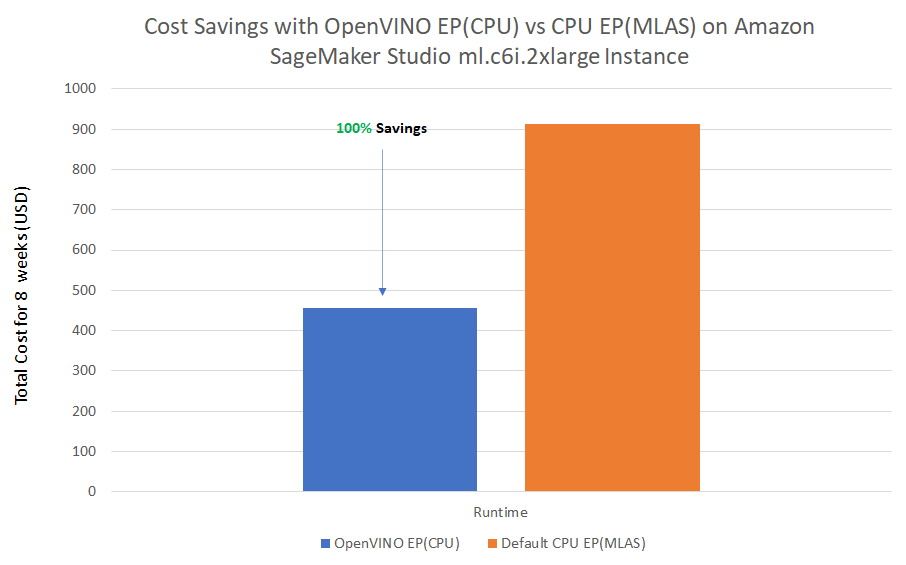

# Notices & Disclaimers

Performance varies by use, configuration and other factors. Learn more at www.Intel.com/PerformanceIndex​.

Your costs and results may vary.

Intel technologies may require enabled hardware, software or service activation.

In [40]:
import re

# Exemplo de resposta
#response1 = b'inference_time: 0.015682s\nInference_summary: 1 person, 1 dog, \nraw_output:\nname: person, confidence: 0.46, start_point: (0, 351), end_point:(512, 1265)\nname: dog, confidence: 0.62, start_point: (65, 255), end_point:(625, 1254)\n'
response1 = b'inference_time: 0.062343s\nInference_summary: 58 persons, \nraw_output:\nname: person, confidence: 0.26, start_point: (452, 521), end_point:(466, 538)\nname: person, confidence: 0.27, start_point: (421, 379), end_point:(435, 399)\nname: person, confidence: 0.27, start_point: (438, 499), end_point:(452, 517)\nname: person, confidence: 0.27, start_point: (622, 81), end_point:(637, 100)\nname: person, confidence: 0.30, start_point: (477, 400), end_point:(491, 417)\nname: person, confidence: 0.31, start_point: (455, 434), end_point:(473, 459)\nname: person, confidence: 0.32, start_point: (675, 62), end_point:(695, 87)\nname: person, confidence: 0.38, start_point: (622, 107), end_point:(640, 130)\nname: person, confidence: 0.44, start_point: (584, 402), end_point:(600, 424)\nname: person, confidence: 0.45, start_point: (488, 441), end_point:(506, 463)\nname: person, confidence: 0.46, start_point: (1147, 164), end_point:(1168, 188)\nname: person, confidence: 0.48, start_point: (1058, 206), end_point:(1075, 228)\nname: person, confidence: 0.53, start_point: (640, 69), end_point:(660, 93)\nname: person, confidence: 0.57, start_point: (1183, 173), end_point:(1202, 195)\nname: person, confidence: 0.58, start_point: (442, 402), end_point:(458, 425)\nname: person, confidence: 0.59, start_point: (749, 56), end_point:(770, 83)\nname: person, confidence: 0.59, start_point: (781, 69), end_point:(802, 94)\nname: person, confidence: 0.59, start_point: (1041, 172), end_point:(1060, 195)\nname: person, confidence: 0.61, start_point: (1076, 165), end_point:(1093, 186)\nname: person, confidence: 0.73, start_point: (1110, 517), end_point:(1135, 550)\nname: person, confidence: 0.76, start_point: (698, 639), end_point:(734, 689)\nname: person, confidence: 0.77, start_point: (1103, 179), end_point:(1142, 229)\nname: person, confidence: 0.78, start_point: (710, 35), end_point:(749, 86)\nname: person, confidence: 0.78, start_point: (721, 287), end_point:(743, 320)\nname: person, confidence: 0.79, start_point: (1303, 388), end_point:(1339, 433)\nname: person, confidence: 0.80, start_point: (310, 152), end_point:(348, 211)\nname: person, confidence: 0.80, start_point: (527, 505), end_point:(565, 558)\nname: person, confidence: 0.80, start_point: (908, 286), end_point:(950, 343)\nname: person, confidence: 0.81, start_point: (309, 398), end_point:(348, 446)\nname: person, confidence: 0.81, start_point: (124, 67), end_point:(153, 107)\nname: person, confidence: 0.81, start_point: (917, 624), end_point:(957, 682)\nname: person, confidence: 0.81, start_point: (299, 631), end_point:(337, 686)\nname: person, confidence: 0.81, start_point: (1291, 168), end_point:(1337, 222)\nname: person, confidence: 0.82, start_point: (128, 495), end_point:(163, 543)\nname: person, confidence: 0.82, start_point: (874, 376), end_point:(917, 428)\nname: person, confidence: 0.82, start_point: (76, 250), end_point:(123, 311)\nname: person, confidence: 0.82, start_point: (1092, 396), end_point:(1128, 443)\nname: person, confidence: 0.83, start_point: (705, 165), end_point:(751, 223)\nname: person, confidence: 0.83, start_point: (91, 161), end_point:(141, 230)\nname: person, confidence: 0.83, start_point: (502, 149), end_point:(544, 210)\nname: person, confidence: 0.83, start_point: (714, 384), end_point:(759, 448)\nname: person, confidence: 0.83, start_point: (1323, 49), end_point:(1359, 98)\nname: person, confidence: 0.83, start_point: (309, 267), end_point:(363, 338)\nname: person, confidence: 0.83, start_point: (1093, 284), end_point:(1137, 342)\nname: person, confidence: 0.83, start_point: (525, 638), end_point:(554, 674)\nname: person, confidence: 0.83, start_point: (1307, 515), end_point:(1354, 575)\nname: person, confidence: 0.84, start_point: (305, 512), end_point:(356, 585)\nname: person, confidence: 0.84, start_point: (106, 382), end_point:(143, 434)\nname: person, confidence: 0.84, start_point: (684, 488), end_point:(739, 569)\nname: person, confidence: 0.84, start_point: (913, 522), end_point:(946, 567)\nname: person, confidence: 0.84, start_point: (512, 39), end_point:(558, 105)\nname: person, confidence: 0.84, start_point: (1311, 283), end_point:(1369, 357)\nname: person, confidence: 0.85, start_point: (896, 32), end_point:(946, 103)\nname: person, confidence: 0.85, start_point: (294, 31), end_point:(344, 98)\nname: person, confidence: 0.85, start_point: (1117, 55), end_point:(1161, 113)\nname: person, confidence: 0.85, start_point: (884, 164), end_point:(946, 245)\nname: person, confidence: 0.86, start_point: (511, 250), end_point:(570, 333)\nname: person, confidence: 0.87, start_point: (528, 385), end_point:(580, 459)\n'
# Decodificar a resposta de bytes para string
response_str = response1.decode('utf-8')

# Verificar o conteúdo da string para debug
print(f"Conteúdo da resposta: {response_str}")

# Regex para capturar os objetos e suas inferências
pattern = r'name: (\w+), confidence: ([\d\.]+), start_point: \((\d+), (\d+)\), end_point:\((\d+), (\d+)\)'

# Extrair as inferências
matches = re.findall(pattern, response_str)

# Organizar as inferências em uma lista de dicionários
inferences = []
for match in matches:
    object_info = {
        "name": match[0],
        "confidence": float(match[1]),
        "start_point": (int(match[2]), int(match[3])),
        "end_point": (int(match[4]), int(match[5]))
    }
    inferences.append(object_info)

# Exibir as inferências extraídas
print(inferences)


Conteúdo da resposta: inference_time: 0.062343s
Inference_summary: 58 persons, 
raw_output:
name: person, confidence: 0.26, start_point: (452, 521), end_point:(466, 538)
name: person, confidence: 0.27, start_point: (421, 379), end_point:(435, 399)
name: person, confidence: 0.27, start_point: (438, 499), end_point:(452, 517)
name: person, confidence: 0.27, start_point: (622, 81), end_point:(637, 100)
name: person, confidence: 0.30, start_point: (477, 400), end_point:(491, 417)
name: person, confidence: 0.31, start_point: (455, 434), end_point:(473, 459)
name: person, confidence: 0.32, start_point: (675, 62), end_point:(695, 87)
name: person, confidence: 0.38, start_point: (622, 107), end_point:(640, 130)
name: person, confidence: 0.44, start_point: (584, 402), end_point:(600, 424)
name: person, confidence: 0.45, start_point: (488, 441), end_point:(506, 463)
name: person, confidence: 0.46, start_point: (1147, 164), end_point:(1168, 188)
name: person, confidence: 0.48, start_point: (1058,

Imagem baixada com sucesso!


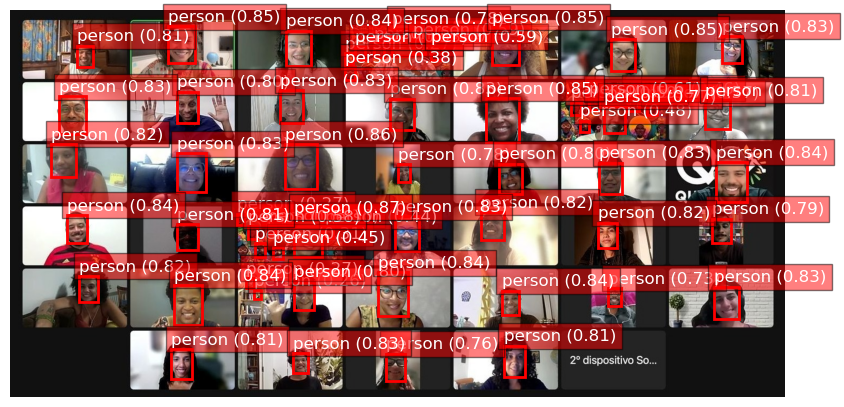

In [42]:
import requests
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from io import BytesIO

# Baixar a imagem diretamente de uma URL
image_url = "https://www.gov.br/servidor/pt-br/acesso-a-informacao/gestao-de-pessoas/desempenho-e-desenvolvimento-de-pessoas/Programa/galeria-videos-e-imagens/Imagem3.jpeg"
response = requests.get(image_url)

# Verifique o status da resposta
if response.status_code == 200:
    print("Imagem baixada com sucesso!")
else:
    print(f"Erro ao baixar a imagem: {response.status_code}")

# Abrir a imagem com PIL
img = Image.open(BytesIO(response.content))

# Criar uma figura para exibição
fig, ax = plt.subplots(figsize=(10, 10))

# Exibir a imagem
ax.imshow(img)

# Supondo que 'inferences' já tenha sido configurado corretamente (como uma lista de dicionários)
# Exemplo de inferências
#inferences = [
#    {"name": "person", "confidence": 0.26, "start_point": (452, 521), "end_point": (466, 538)},
#    {"name": "person", "confidence": 0.27, "start_point": (421, 379), "end_point": (435, 399)}
#]

# Desenhar as caixas delimitadoras
for inference in inferences:
    if isinstance(inference, dict):
        start_point = inference["start_point"]
        end_point = inference["end_point"]

        # Calcular a largura e altura do retângulo
        width = end_point[0] - start_point[0]
        height = end_point[1] - start_point[1]

        # Criar o retângulo e adicionar à plotagem
        rect = patches.Rectangle((start_point[0], start_point[1]), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Colocar o rótulo (nome + confiança) perto da caixa
        label = f"{inference['name']} ({inference['confidence']:.2f})"
        ax.text(start_point[0], start_point[1]-10, label, fontsize=12, color='white', bbox=dict(facecolor='red', alpha=0.5))

# Remover os eixos para uma visualização mais limpa
ax.axis('off')

# Mostrar a imagem com as caixas e rótulos
plt.show()


In [2]:
import os
import cv2
import numpy as np
import onnxruntime as rt
from datetime import datetime
#from ultralytics import YOLO
from ultralytics.yolo.data.augment import LetterBox
from ultralytics.yolo.engine.results import Results
from ultralytics.yolo.utils import ops

# Parâmetros de pré-processamento
imgsz = 640  # Valor padrão para este caso de uso
stride = 32  # Valor padrão para este caso de uso

# Parâmetros de pós-processamento
conf = 0.25
iou = 0.45
max_det = 300
classes = None
agnostic = False
labels = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 
          8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 
          14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 
          22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 
          29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 
          35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 
          40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 
          47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 
          54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 
          61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 
          68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 
          75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

# Inicialização do modelo
mlas_model = None
ov_model = None
input_names = None
output_names = None



# Função de inferência
def inference(model_input, device):
    global mlas_model, ov_model, input_names, output_names
    
    if device == 'cpu':
        print("Performing ONNX Runtime Inference with default CPU EP.")
        start_time = datetime.now()
        prediction = mlas_model.run(output_names, {input_names: model_input})
        end_time = datetime.now()
    elif device == 'CPU_FP32':
        print("Performing ONNX Runtime Inference with OpenVINO CPU EP.")
        start_time = datetime.now()
        prediction = ov_model.run(output_names, {input_names: model_input})
        end_time = datetime.now()
    else:
        print("Invalid device option. Supported devices are 'cpu' and 'CPU_FP32'.")
        return None
    
    print("Inference time: ", (end_time - start_time).total_seconds())
    return prediction

# Inicializando modelos ONNX
model_dir = 'yolov8n-face.onnx'  # Ajuste conforme o caminho para seu modelo
so = rt.SessionOptions()
mlas_model = rt.InferenceSession(os.path.join(model_dir), so, providers=['CPUExecutionProvider'])
ov_model = rt.InferenceSession(os.path.join(model_dir), so, providers=['OpenVINOExecutionProvider'], provider_options=[{'device_type': 'CPU_FP32'}])

input_names = ov_model.get_inputs()[0].name
outputs = ov_model.get_outputs()
output_names = list(map(lambda output: output.name, outputs))

# Definindo caminho da imagem
image_abs_path = 'dog.jpg'  # Ajuste para o caminho da imagem a ser processada
# Função de pré-processamento da imagem


def preprocess_image(image_abs_path):
    img0 = cv2.imread(image_abs_path)
    img = LetterBox(imgsz, True, stride)(image=img0.copy())

    img = img.transpose((2, 0, 1))[::-1]  # Converte de BGR para RGB e altera as dimensões (3, 416, 416)
    img = np.ascontiguousarray(img)

    img = img.astype(np.float32)  # Converte de uint8 para fp16/32
    img /= 255.0  # Normaliza os valores de 0-255 para 0.0-1.0

    if img.ndim == 3:
        img = np.expand_dims(img, axis=0)

    return img0, img
# Verificando e realizando a inferência
if os.path.isfile(image_abs_path) and image_abs_path.split('.')[-1].lower() in ['jpg', 'jpeg', 'png']:
    img0, img = preprocess_image(image_abs_path)
    prediction = inference(img, 'cpu')  # Use 'CPU_FP32' caso esteja utilizando OpenVINO


else:
    print("Invalid image format.")


WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.data' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.data' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

WARNING ⚠️ 'ultralytics.yolo.engine' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.engine' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and c

Performing ONNX Runtime Inference with default CPU EP.
Inference time:  0.289993


In [4]:
output = prediction[0]
output = output.reshape(-1, 20)  # Transforma em (5040, 20)


In [26]:
cx, cy, w, h = output[:, :4].T   # Coordenadas dos bounding boxes
conf_score = output[:, 4]       # Confiabilidade da detecção
class_probs = output[:, 5:]     # Probabilidades das classes


In [27]:
threshold = 0.5
high_conf_indices = conf_score > threshold
cx, cy, w, h = cx[high_conf_indices], cy[high_conf_indices], w[high_conf_indices], h[high_conf_indices]
conf_score = conf_score[high_conf_indices]
class_probs = class_probs[high_conf_indices]


In [28]:
img_width, img_height = 640, 480  # Exemplo
x1 = (cx - w / 2) * img_width
y1 = (cy - h / 2) * img_height
x2 = (cx + w / 2) * img_width
y2 = (cy + h / 2) * img_height
bounding_boxes = list(zip(x1, y1, x2, y2))


In [29]:
import cv2
indices = cv2.dnn.NMSBoxes(bounding_boxes, conf_score, score_threshold=0.5, nms_threshold=0.4)


In [1]:
import numpy as np
import cv2

# Saída simulada de inferência (Exemplo)
#output = np.random.rand(1, 20, 5040)  # Simulação da saída do modelo
output = output.reshape(-1, 20)       # Reduz para (5040, 20)

# Decodificando a saída
cx, cy, w, h = output[:, :4].T
conf_score = output[:, 4]
class_probs = output[:, 5:]

# Filtro de confiança
threshold = 0.5
high_conf_indices = conf_score > threshold
cx, cy, w, h = cx[high_conf_indices], cy[high_conf_indices], w[high_conf_indices], h[high_conf_indices]
conf_score = conf_score[high_conf_indices]

# Transformar coordenadas
img_width, img_height = 640, 480  # Dimensões do exemplo
x1 = (cx - w / 2) * img_width
y1 = (cy - h / 2) * img_height
x2 = (cx + w / 2) * img_width
y2 = (cy + h / 2) * img_height
bounding_boxes = np.stack([x1, y1, x2, y2], axis=-1)

# Aplicar NMS
indices = cv2.dnn.NMSBoxes(
    bounding_boxes.tolist(), conf_score.tolist(),
    score_threshold=0.5, nms_threshold=0.4
)

# Filtrar boxes finais
final_boxes = [bounding_boxes[i] for i in indices]
final_scores = [conf_score[i] for i in indices]


NameError: name 'output' is not defined

In [6]:
final_scores

[639.86334,
 489.17743,
 440.1645,
 339.07034,
 311.14157,
 279.0662,
 250.21962,
 223.3137,
 181.09058,
 180.23187,
 151.94128,
 123.84515,
 121.01014,
 108.65193,
 107.89807,
 103.92673,
 102.43449,
 101.198944,
 92.774124,
 91.398926,
 88.49036,
 81.05223,
 79.89139,
 71.7435,
 70.46149,
 68.113464,
 68.08786,
 60.84903,
 50.68509,
 48.882477,
 47.77295,
 45.33426,
 41.406815,
 38.099075,
 37.147156,
 36.31781,
 36.179134,
 33.32907,
 31.28749,
 29.117676,
 28.241241,
 27.057253,
 26.307312,
 14.163605,
 14.085449,
 10.114971,
 9.208313,
 7.5174255,
 7.1955676,
 6.9719014,
 6.9139175,
 5.113578,
 2.4154034,
 1.936203,
 0.9563664,
 0.949535,
 0.9261726,
 0.8686869,
 0.864639,
 0.8599434,
 0.7495662,
 0.724446,
 0.68925637,
 0.6540594,
 0.6148251,
 0.6044076,
 0.59591985,
 0.59453607,
 0.5866847,
 0.5249759]

In [ ]:
import numpy as np
import cv2

# Exemplo de imagem carregada
image = cv2.imread("dog.jpg")  # Substitua pelo caminho da sua imagem
img_height, img_width, _ = image.shape

# Bounding boxes simulados e índices selecionados
#final_boxes = [[50, 50, 200, 200], [300, 100, 400, 250]]  # Substitua com as caixas reais
#final_scores = [0.85, 0.92]  # Scores de exemplo, substitua pelos seus

# Garantir que as coordenadas estejam em inteiros
final_boxes = np.array(final_boxes, dtype=int)

# Loop para desenhar caixas
for box, score in zip(final_boxes, final_scores):
    x1, y1, x2, y2 = box
    label = f"Conf: {score:.2f}"  # Rotulo com o score de confiança

    # Desenhar a bounding box
    cv2.rectangle(image, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)

    # Adicionar legenda acima da caixa
    (text_width, text_height), _ = cv2.getTextSize(label, fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, thickness=1)
    cv2.rectangle(image, (x1, y1 - 20), (x1 + text_width, y1), color=(0, 255, 0), thickness=-1)  # Fundo do texto
    cv2.putText(image, label, (x1, y1 - 5), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0, 0, 0), thickness=1)

# Exibir imagem com as caixas
cv2.imshow("Image with Bounding Boxes", image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [9]:
# Exemplo de inferência usando ONNX Runtime
import onnxruntime as ort
import cv2

# Carregar modelo ONNX
model_path = "yolov8n-face.onnx"
session = ort.InferenceSession(model_path, providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])

# Ler a imagem e pré-processar
img_path = "dog.jpg"
img0 = cv2.imread(img_path)  # Imagem original (para exibir resultados e logs)
img = cv2.resize(img0, (640, 640))  # Redimensionar para entrada do modelo
img = img.transpose(2, 0, 1)[None, ...]  # Alterar formato para CHW e batch (1, C, H, W)
img = img.astype('float32') / 255.0  # Normalizar os valores de pixels

# Fazer inferência
inputs = {session.get_inputs()[0].name: img}
outputs = session.run(None, inputs)
inference_output = (outputs, 0.045)  # Saída da inferência e tempo (exemplo)

# Configurações da sua classe

conf=0.25,
iou=0.45,
max_det=300,
classes=None,  # Ou uma lista de classes para filtrar
labels=["pessoa", "carro", "bicicleta"],  # Exemplos de classes suportadas
path="caminho_para_salvar_resultados"

# Chamada da função postprocess
result = postprocess(img0, img, inference_output)

# Exibindo os resultados
if result:
    print("\n".join(result))  # Imprime os logs e informações das detecções

# Opcional: exibir a imagem com as detecções
cv2.imshow("Detections", img0)
cv2.waitKey(0)
cv2.destroyAllWindows()


TypeError: postprocess() missing 1 required positional argument: 'inference_output'

In [148]:
!pip uninstall ultralytics

Found existing installation: ultralytics 8.3.67
Uninstalling ultralytics-8.3.67:
  Successfully uninstalled ultralytics-8.3.67


In [3]:
!pip install ultralytics==8.0.179

  Using cached ultralytics-8.0.179-py3-none-any.whl.metadata (28 kB)
  Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl.metadata (794 bytes)
Using cached ultralytics-8.0.179-py3-none-any.whl (366 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (63.0 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached py_cpuinfo-9.0.0-py3-none-any.whl (22 kB)


In [3]:
import sys
import argparse

# Eliminar los argumentos de Jupyter que no necesitamos
sys.argv = sys.argv[:1]

# Ahora, puedes ejecutar el código con argparse sin problemas
parser = argparse.ArgumentParser()
parser.add_argument('--weights', default='yolov8n-face.onnx', help='Weights path')
parser.add_argument('--source', default='data/images/bus.jpg')
parser.add_argument('--imgsz', type=int, default=640, help='Image size')
parser.add_argument('--conf', type=float, default=0.75, help='Object confidence threshold for detection')
parser.add_argument('--iou', type=float, default=0.7, help='Intersection over union (IoU) threshold for NMS')
parser.add_argument('--device', default='0', help='CUDA device, i.e. 0 or 0,1,2,3 or cpu')

# Ahora parseamos los argumentos
opt = parser.parse_args()

# El resto del código sigue igual
model = cv2.dnn.readNetFromONNX(opt.weights)
img = cv2.imread(opt.source)
height, width, _ = img.shape
length = max((height, width))
scale = length / opt.imgsz
blob = np.zeros((length, length, 3), np.uint8)
blob[0:height, 0:width] = img
blob = cv2.dnn.blobFromImage(blob, scalefactor=1 / 255, size=(opt.imgsz, opt.imgsz), swapRB=True)

model.setInput(blob)
outputs = model.forward()

outputs = cv2.transpose(outputs[0])

boxes = []
scores = []
for i in range(outputs.shape[0]):
    max_score = float(np.amax(outputs[i][4:]))
    if max_score >= opt.conf:
        boxes.append(
            [
                (outputs[i][0] - (0.5 * outputs[i][2])) * scale,
                (outputs[i][1] - (0.5 * outputs[i][3])) * scale,
                outputs[i][2] * scale,
                outputs[i][3] * scale,
            ]
        )
        scores.append(max_score)

results = cv2.dnn.NMSBoxes(boxes, scores, opt.conf, opt.iou)

color = [0, 255, 0]
for i in range(len(results)):
    idx = results[i]
    x = round(boxes[idx][0])
    y = round(boxes[idx][1])
    w = round(boxes[idx][2])
    h = round(boxes[idx][3])
    label = '%.2f' % scores[idx]

    cv2.rectangle(img, (x, y, w, h), color, 1, cv2.LINE_AA)
    cv2.putText(img, label, (x - 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)

cv2.imshow('dog.jpg', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

[ERROR:0@119.232] global onnx_importer.cpp:1036 handleNode DNN/ONNX: ERROR during processing node with 2 inputs and 1 outputs: [Concat]:(onnx_node!/model.11/Concat) from domain='ai.onnx'


error: OpenCV(4.11.0) /io/opencv/modules/dnn/src/onnx/onnx_importer.cpp:1058: error: (-2:Unspecified error) in function 'handleNode'
> Node [Concat@ai.onnx]:(onnx_node!/model.11/Concat) parse error: OpenCV(4.11.0) /io/opencv/modules/dnn/src/layers/concat_layer.cpp:108: error: (-201:Incorrect size of input array) Inconsistent shape for ConcatLayer in function 'getMemoryShapes'
> 

In [14]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 45.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 13.7 MB/s eta 0:00:00


In [51]:
import onnxruntime
import cv2
import numpy as np

# Cargar el modelo ONNX con ONNX Runtime
session = onnxruntime.InferenceSession('yolov8n-face.onnx')
import sys
import argparse

# Eliminar los argumentos de Jupyter que no necesitamos
sys.argv = sys.argv[:1]

# Ahora, puedes ejecutar el código con argparse sin problemas
parser = argparse.ArgumentParser()
parser.add_argument('--weights', default='yolov8n.onnx', help='Weights path')
parser.add_argument('--source', default='data/images/bus.jpg')
parser.add_argument('--imgsz', type=int, default=640, help='Image size')
parser.add_argument('--conf', type=float, default=0.75, help='Object confidence threshold for detection')
parser.add_argument('--iou', type=float, default=0.7, help='Intersection over union (IoU) threshold for NMS')
parser.add_argument('--device', default='0', help='CUDA device, i.e. 0 or 0,1,2,3 or cpu')

# Ahora parseamos los argumentos
opt = parser.parse_args()
# Leer la imagen
img = cv2.imread('dog.jpg')

# Preprocesamiento de la imagen (ajustar según tu modelo)
height, width, _ = img.shape
length = max((height, width))
scale = length / 640
blob = np.zeros((length, length, 3), np.uint8)
blob[0:height, 0:width] = img
blob = cv2.dnn.blobFromImage(blob, scalefactor=1 / 255, size=(640, 640), swapRB=True)

# Realizar inferencia
inputs = {session.get_inputs()[0].name: blob}
outputs = session.run(None, inputs)

# Procesar los resultados
outputs = np.array(outputs[0])

# Aquí continuarías con el procesamiento de los resultados como lo tenías en tu código


In [52]:
outputs = outputs[0,:,:]
out1 = np.transpose(outputs)
saida = []
for i in range(0,len(out1)):
    if out1[i,-1]>0.3:
        saida.append(out1[i])

In [31]:
inference

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xe2\x01\xd8ICC_PROFILE\x00\x01\x01\x00\x00\x01\xc8\x00\x00\x00\x00\x040\x00\x00mntrRGB XYZ \x07\xe0\x00\x01\x00\x01\x00\x00\x00\x00\x00\x00acsp\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\xf6\xd6\x00\x01\x00\x00\x00\x00\xd3-\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'

In [45]:
outputs.shape

(1, 5, 8400)

In [13]:
!pip install ultralytics==8.0.179

  Using cached ultralytics-8.0.179-py3-none-any.whl.metadata (28 kB)
  Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl.metadata (794 bytes)
Using cached ultralytics-8.0.179-py3-none-any.whl (366 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (63.0 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached py_cpuinfo-9.0.0-py3-none-any.whl (22 kB)


In [15]:
from ultralytics import YOLO

# Carregue o modelo YOLO
model = YOLO("yolov8n-face-lindevs.pt")  # Substitua "modelo.pt" pelo caminho do modelo YOLO
model.export(format="onnx", opset=12, dynamic=True)


Ultralytics YOLOv8.0.179 🚀 Python-3.10.14 torch-2.0.0.post104 CPU (Intel Xeon Platinum 8259CL 2.50GHz)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients

PyTorch: starting from 'yolov8n-face-lindevs.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (6.0 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 232.7 MB/s eta 0:00:00a 0:00:01

requirements: AutoUpdate success ✅ 11.9s, installed 1 package: ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 12...
ONNX: export success ✅ 13.9s, saved as 'yolov8n-face-lindevs.onnx' (11.5 MB)

Export complete (16.1s)
Results saved to /home/sagemaker-user/yolov8-OpenVINO/notebooks
Predict:         yolo predict task=detect model=yolov8n-face-lindevs.onnx imgsz=640  
Validate:        yolo val task=detect model=yolov8n-face

============ Diagnostic Run torch.onnx.export version 2.0.0.post104 ============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



'yolov8n-face-lindevs.onnx'

In [30]:
out1[0]

array([5.3396826e+00, 6.4553490e+00, 1.0370619e+01, 1.2438801e+01,
       6.5565109e-06], dtype=float32)

In [ ]:
import numpy as np

# Si necesitas cambiar la forma de los datos
outputs = np.squeeze(outputs)
boxes = []
scores = []
for i in range(outputs.shape[0]):
    max_score = float(np.amax(outputs[i][4:]))
    if max_score >= opt.conf:
        boxes.append(
            [
                (outputs[i][0] - (0.5 * outputs[i][2])) * scale,
                (outputs[i][1] - (0.5 * outputs[i][3])) * scale,
                outputs[i][2] * scale,
                outputs[i][3] * scale,
            ]
        )
        scores.append(max_score)

results = cv2.dnn.NMSBoxes(boxes, scores, opt.conf, opt.iou)

color = [0, 255, 0]
for i in range(len(results)):
    idx = results[i]
    x = round(boxes[idx][0])
    y = round(boxes[idx][1])
    w = round(boxes[idx][2])
    h = round(boxes[idx][3])
    label = '%.2f' % scores[idx]

    cv2.rectangle(img, (x, y, w, h), color, 1, cv2.LINE_AA)
    cv2.putText(img, label, (x - 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)

cv2.imshow('dog.jpg', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [6]:
import numpy as np

# Si necesitas cambiar la forma de los datos
outputs = np.squeeze(outputs)
boxes = []
scores = []
for i in range(outputs.shape[0]):
    max_score = float(np.amax(outputs[i][4:]))
    if max_score >= opt.conf:
        boxes.append(
            [
                (outputs[i][0] - (0.5 * outputs[i][2])) * scale,
                (outputs[i][1] - (0.5 * outputs[i][3])) * scale,
                outputs[i][2] * scale,
                outputs[i][3] * scale,
            ]
        )
        scores.append(max_score)

In [9]:
outputs.shape

(84, 8400)

In [103]:
import json
import cv2

# Dados da inferência retornados pela API
response = b'{\n  "inference_time": 0.121355,\n  "inference_summary": "2 persons, ",\n  "raw_output": "name: person, confidence: 0.32, start_point: (452, 352), end_point:(463, 365)\\nname: person, confidence: 0.54, start_point: (603, 340), end_point:(614, 354)\\n"\n}'

# Decodificando o JSON
response_data = json.loads(response)

# Extração do campo "raw_output"
raw_output = response_data["raw_output"]

# Parse dos bounding boxes a partir da string "raw_output"
bounding_boxes = []
for line in raw_output.splitlines():
    try:
        if "start_point" in line and "end_point" in line:
            name = line.split(",")[0].split(":")[1].strip()
            confidence = float(line.split(",")[1].split(":")[1].strip())
            start_point = tuple(map(int, line.split(",")[2].split(":")[1].strip().strip("()").split(",")))
            end_point = tuple(map(int, line.split(",")[3].split(":")[1].strip().strip("()").split(",")))
            bounding_boxes.append({"name": name, "confidence": confidence, "start": start_point, "end": end_point})
    except (IndexError, ValueError) as e:
        print(f"Erro ao processar a linha: {line}. Erro: {e}")
        continue

# Carregar a imagem original
image_path = "/yolov8-OpenVINO/notebooks/17.jpeg"
image = cv2.imread(image_path)

# Verificar se a imagem foi carregada corretamente
if image is None:
    print(f"Erro: Não foi possível carregar a imagem em {image_path}.")
else:
    # Desenhar os bounding boxes na imagem
    for bbox in bounding_boxes:
        color = (0, 255, 0)  # Verde para os bounding boxes
        thickness = 2
        label = f"{bbox['name']} ({bbox['confidence']:.2f})"
        # Desenhar o retângulo
        cv2.rectangle(image, bbox["start"], bbox["end"], color, thickness)
        # Adicionar o texto acima do bounding box
        cv2.putText(image, label, (bbox["start"][0], bbox["start"][1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    # Salvar ou exibir a imagem
    output_path = "17_with_bboxes.jpg"
    cv2.imwrite(output_path, image)
    print(f"Imagem salva em {output_path}")

    # Exibir a imagem na tela (opcional)
    cv2.imshow("Bounding Boxes", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


Erro ao processar a linha: name: person, confidence: 0.32, start_point: (452, 352), end_point:(463, 365). Erro: list index out of range
Erro ao processar a linha: name: person, confidence: 0.54, start_point: (603, 340), end_point:(614, 354). Erro: list index out of range
Erro: Não foi possível carregar a imagem em /yolov8-OpenVINO/notebooks/17.jpeg.


[ WARN:0@25909.675] global loadsave.cpp:268 findDecoder imread_('/yolov8-OpenVINO/notebooks/17.jpeg'): can't open/read file: check file path/integrity


17.jpeg     model
core.10017  yolov8_model_inference_with_onnxruntime.ipynb
core.140    yolov8_model_inference_with_onnxruntime.ipynb.invalid
core.164    yolov8n-face-lindevs.onnx
core.907    yolov8n-face-lindevs.pt
core.965    yolov8n-face.onnx
core.9810   yolov8n-face.pt
core.9838   yolov8n.onnx
dog.jpg


In [21]:
from tensorflow.keras.layers import Input, Lambda, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

2025-01-28 15:17:05.998698: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
def get_siamese_embedding_network(input_shape):
    # Entrada dos embeddings (esquerdo e direito)
    left_input = Input(shape=input_shape)
    right_input = Input(shape=input_shape)

    # Calcular a distância L1 entre os embeddings
    L1_layer = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]), output_shape=lambda input_shapes: input_shapes[0])
    L1_dist = L1_layer([left_input, right_input])

    # Adicionar camadas de aprendizado sobre a distância L1
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-3))(L1_dist)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)  # Aumentar o Dropout para 0.5

    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-3))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Camada de saída com sigmoide para prever a similaridade
    output = Dense(1, activation='sigmoid')(x)

    # Criar o modelo Siamese final
    siamese_net = Model(inputs=[left_input, right_input], outputs=output)

    return siamese_net

# Exemplo de uso
input_shape = (512,)  # Tamanho da entrada para os embeddings DeepFace
siamese_model = get_siamese_embedding_network(input_shape)
siamese_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 lambda (Lambda)             (None, 512)                  0         ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 dense (Dense)               (None, 256)                  131328    ['lambda[0][0]']          

In [24]:
siamese_model.load_weights('my_model.weights.h5')

In [48]:
import numpy as np
from tensorflow.keras.models import Model

def quantize_weights(weights, decimal_places=3):
    return np.round(weights, decimal_places)
# Função para exportar a rede como função numpy
def export_siamese_to_numpy(model):
    # Extrair pesos de cada camada
    dense_256 = model.layers[3]
    bn1 = model.layers[4]
    dense_128 = model.layers[6]
    bn2 = model.layers[7]
    dense_out = model.layers[9]

    # Obter pesos
    dense_w1, dense_b1 = dense_256.get_weights()
    gamma1, beta1, moving_mean1, moving_var1 = bn1.get_weights()
    dense_w2, dense_b2 = dense_128.get_weights()
    gamma2, beta2, moving_mean2, moving_var2 = bn2.get_weights()
    dense_wout, dense_bout = dense_out.get_weights()
    dense_w1 = quantize_weights(dense_w1)
    dense_b1 = quantize_weights(dense_b1)
    dense_w2 = quantize_weights(dense_w2)
    dense_b2 = quantize_weights(dense_b2)
    dense_wout = quantize_weights(dense_wout)
    dense_bout = quantize_weights(dense_bout)

    # Parâmetros de BatchNormalization
    gamma1 = quantize_weights(gamma1)
    beta1 = quantize_weights(beta1)
    moving_mean1 = quantize_weights(moving_mean1)
    moving_var1 = quantize_weights(moving_var1)
    gamma2 = quantize_weights(gamma2)
    beta2 = quantize_weights(beta2)
    moving_mean2 = quantize_weights(moving_mean2)
    moving_var2 = quantize_weights(moving_var2)
    # Gerar código numpy
    code = f"""
import numpy as np

# Pesos das camadas Dense
dense_w1 = np.array({dense_w1.tolist()}, dtype=np.float32)
dense_b1 = np.array({dense_b1.tolist()}, dtype=np.float32)
dense_w2 = np.array({dense_w2.tolist()}, dtype=np.float32)
dense_b2 = np.array({dense_b2.tolist()}, dtype=np.float32)
dense_wout = np.array({dense_wout.tolist()}, dtype=np.float32)
dense_bout = np.array({dense_bout.tolist()}, dtype=np.float32)

# Parâmetros de BatchNormalization
gamma1 = np.array({gamma1.tolist()}, dtype=np.float32)
beta1 = np.array({beta1.tolist()}, dtype=np.float32)
moving_mean1 = np.array({moving_mean1.tolist()}, dtype=np.float32)
moving_var1 = np.array({moving_var1.tolist()}, dtype=np.float32)
gamma2 = np.array({gamma2.tolist()}, dtype=np.float32)
beta2 = np.array({beta2.tolist()}, dtype=np.float32)
moving_mean2 = np.array({moving_mean2.tolist()}, dtype=np.float32)
moving_var2 = np.array({moving_var2.tolist()}, dtype=np.float32)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def compute_similarity(left_embed, right_embed):
    # Calcular distância L1
    l1_dist = np.abs(left_embed - right_embed)
    
    # Primeira camada Dense + ReLU
    x = np.dot(l1_dist, dense_w1) + dense_b1
    x = np.maximum(x, 0)
    
    # BatchNorm 1
    x = (x - moving_mean1) / np.sqrt(moving_var1 + 1e-3)
    x = x * gamma1 + beta1
    
    # Segunda camada Dense + ReLU
    x = np.dot(x, dense_w2) + dense_b2
    x = np.maximum(x, 0)
    
    # BatchNorm 2
    x = (x - moving_mean2) / np.sqrt(moving_var2 + 1e-3)
    x = x * gamma2 + beta2
    
    # Camada de saída
    x = np.dot(x, dense_wout) + dense_bout
    return sigmoid(x)[0]

# Exemplo de uso:
# similarity = compute_similarity(embed1, embed2)
"""

    return code

# Gerar o código
generated_code = export_siamese_to_numpy(siamese_model)

# Salvar em um arquivo de texto
with open("siamese_model_numpy.py", "w") as file:
    file.write(generated_code)

print("Código exportado para 'siamese_model_numpy.py'.")


Código exportado para 'siamese_model_numpy.py'.


In [29]:
import numpy as np

# Pesos das camadas Dense
dense_w1 = np.array([[0.10079745203256607, -1.4469617995102602e-12, -0.041319750249385834, -4.140465057736452e-33, -0.08642470091581345, -0.009227879345417023, -3.14755266295208e-09, -1.8689206626731902e-07, -0.0029609466437250376, -0.013753690756857395, -0.01190255954861641, 2.9662180166229823e-33, -0.043532293289899826, -6.020586354614128e-34, -5.228787318895651e-33, 8.758226613281295e-05, -4.808462108485401e-07, 9.505838534096256e-07, -4.721022090354017e-18, -1.1927895002249816e-34, -0.10281151533126831, 6.4391308951528e-10, -4.118590234483688e-13, 1.4654114510390115e-13, -1.2895033485449403e-08, 0.011144759133458138, 1.78622681090701e-08, -2.3410324026529317e-11, -9.420695560452552e-13, 0.07547102868556976, 0.02078080363571644, -2.026484256416947e-21, -1.0853618732653558e-06, 0.0023284931667149067, 0.012205580249428749, -3.731765474412896e-08, 1.5111661468836246e-06, -4.768479584527086e-07, -0.0013406638754531741, -0.0003180241910740733, -0.001685757772065699, 4.8632519486383006e-15, -0.07994814217090607, 8.439630085824776e-20, 0.0004587076837196946, -6.443426521507423e-13, 0.00014405438560061157, 9.980449976865202e-05, -1.8438436812529685e-14, 1.59184918366885e-30, 0.0015667102998122573, -0.026860052719712257, -1.0613398215028689e-14, -2.8644191862854444e-19, -2.027590942366153e-11, 0.0107421251013875, -6.588874446045168e-10, -0.00023000306100584567, -8.896974759409204e-05, -4.0392412721870774e-13, -1.663510366782528e-13, -0.0025013131089508533, 0.005901019088923931, 1.5834974220751974e-08, -0.024314921349287033, -2.49661697565573e-11, -1.084686946381877e-13, -0.01485475618392229, -4.940304521028338e-08, 1.990134057550108e-09, 0.030360495671629906, 0.002058959100395441, 1.3036490408363372e-33, 4.354800076100673e-09, -0.0001950917358044535, -3.279506017861422e-06, -2.9404268999177756e-17, -2.5074942122671473e-12, 8.336195605807006e-05, -5.021258582538213e-12, -2.0644381947931834e-05, 2.378535677072126e-34, -1.0733680610996998e-09, -0.013873916119337082, -0.045528098940849304, -0.1108257919549942, 0.022629201412200928, -0.035474300384521484, -0.001625684555619955, -1.7686996771120853e-33, 0.01133719366043806, -5.5407995191427564e-17, -3.6860888030787464e-06, -0.0010449521942064166, -6.038631022319405e-22, -0.06647411733865738, -6.523949661295504e-21, 0.0043435231782495975, 2.540802199746395e-07, -0.002351072384044528, 2.7016695232215725e-33, -2.030264134589288e-08, 5.585224081120529e-16, 1.3391045285970904e-06, 6.7870020714622115e-09, 0.002049746224656701, -0.029513780027627945, 3.4085434127972825e-12, 2.4068442794344946e-09, -0.005968986079096794, -0.003594482783228159, -0.03337172046303749, -0.022567834705114365, 0.00047912533045746386, -0.0708710178732872, -0.015294591896235943, -0.023819584399461746, -7.006516677607322e-13, -0.008169944398105145, -0.04653409868478775, -3.304030542494729e-05, 1.769379878169275e-07, 0.025399308651685715, 0.02257213555276394, -4.553908790859429e-13, -0.006043214350938797, -0.004206858575344086, -6.807365934946574e-06, -1.835864695701809e-30, -0.0075735352002084255, 8.497749032221336e-11, 0.005933669861406088, -0.009495365433394909, 2.502661084692244e-33, 2.470821236499887e-08, 1.8473048646328039e-09, -4.851063981634091e-18, 1.5641993741155602e-05, 5.7993023716562675e-09, 3.866283204459061e-33, 6.689213838555612e-27, -0.007806671783328056, -1.217515671614322e-10, -0.0057823252864181995, 6.002171456890509e-26, 1.5212072735664037e-18, -8.370699824020562e-26, -1.5107450224149943e-07, -0.004059984348714352, -0.00028388071223162115, -1.9046964894187113e-07, -0.010751116089522839, 0.0005935452063567936, 3.7759100735001994e-08, 4.0932164324658515e-09, -7.6607941995252e-13, -0.030437074601650238, -2.1152556655579247e-05, -0.0014698090963065624, 4.389095556689426e-05, -1.9217222302359005e-07, -2.5029200401149865e-07, -0.051533665508031845, -0.0228300541639328, -0.01812911592423916, 0.03627395257353783, -4.771002295456128e-06, -0.0010254585649818182, 8.012815442270949e-07, -1.0427636711267369e-20, -0.038215748965740204, 4.884712775570275e-33, -2.634709879068792e-17, 0.008997061289846897, 3.826995680356049e-07, -6.775962901883759e-08, -1.690100361884106e-05, -0.015977298840880394, 0.04777839407324791, -0.0007435587467625737, 7.586547786355924e-34, -0.0004346777277532965, -1.3058452930092557e-10, -2.3936836441862397e-05, -2.0244820575499034e-07, 2.3582210365867256e-25, -0.0010428992100059986, 0.03182937204837799, -1.4115120608011793e-18, -0.032661136239767075, 2.067769105896719e-13, -0.0046570622362196445, 0.017935939133167267, 0.06363853812217712, 0.011949069797992706, 8.348153418547e-11, -8.580311259720474e-06, -0.00421052286401391, -3.198324834548195e-15, -1.4038981782649174e-11, -4.075705407276898e-18, 0.04531008005142212, -1.0151137183844706e-15, -4.268076372682117e-05, -0.0003430643992032856, 0.021661877632141113, -0.02044152282178402, 0.0009688827558420599, 0.047880955040454865, -5.160596776299098e-12, 0.013932066969573498, -0.0003947424120269716, -1.2660750985962721e-33, 8.501091360813007e-05, -0.0563381053507328, 2.9238027554612245e-09, -0.03083854727447033, 7.983968544067466e-07, -5.262819992568368e-34, -0.021013548597693443, 2.1972561929786217e-15, -2.1340438252082095e-06, -0.005889471620321274, -3.973143611801788e-05, 4.646859906642931e-06, 3.588214138300295e-33, -0.003411519341170788, 2.5075494458626224e-10, 0.03486816585063934, 0.0024813890922814608, 0.05707943066954613, -2.4840802748116175e-09, 0.047296665608882904, -1.6999257557159808e-09, 0.005549711175262928, -0.1278509497642517, 1.6331322839489613e-22, 0.0016410961980000138, -0.0006512561230920255, -2.5977373297791928e-05, -7.099982468616872e-08, -0.030512982979416847, -0.02142713963985443, -1.8477925323168165e-06, 1.1572421954042511e-07, -8.062852430157363e-07, -0.0019191063474863768, 0.025394856929779053, -6.394828488964777e-08, 0.023143988102674484, -0.03101644665002823, -4.2577129322207696e-11, -0.05048970505595207, 4.821550191991264e-06, 1.6092042980934433e-18, -1.2317916464610335e-08], [-0.0853993222117424, -1.441904321636267e-13, 0.003921963274478912, -1.797451350578237e-33, -0.01566852442920208, -0.010524947196245193, 1.6038828043463127e-09, -1.5150513732464788e-08, 0.009782956913113594, -0.0011361237848177552, -0.0009992180857807398, 1.5888314169555999e-28, 0.0017906150314956903, -1.7325323779317307e-18, 1.6676200199108307e-33, -0.0015695958863943815, -1.6612614217592636e-06, -5.477579761298257e-12, -1.1198771909803895e-09, 1.8082346745371082e-33, 0.04132953658699989, -2.690900074379249e-13, -5.73598694600673e-16, 2.5721002476324084e-13, -1.4477238075016885e-08, 0.0026670608203858137, -1.9310647303427686e-08, -4.889101276606134e-12, -2.5529340096184117e-15, 0.00377661339007318, -0.012068051844835281, -4.413809899188813e-19, -5.8387751522559483e-08, -0.004415510687977076, -0.03317416086792946, 1.4288885352709002e-10, -5.500740485331335e-07, 4.441416834310985e-08, 0.013034828938543797, -0.0002480932744219899, 0.018540097400546074, -2.4761727737391238e-17, -0.02093256264925003, -9.287363390101618e-21, -0.0011843607062473893, -3.369182916598129e-13, -3.388906770851463e-05, -7.870880654081702e-05, -1.829830055830194e-17, 2.522683426906594e-34, 0.0017022773390635848, -0.005180708598345518, 5.879979053029054e-15, 2.183645325861514e-33, -5.218838694531769e-10, -0.03079324960708618, -2.1550329520891864e-08, -0.0022935301531106234, 1.6710599084035493e-05, -3.902176094728281e-14, 3.242775514257501e-13, -0.013221058994531631, -0.010033823549747467, 1.5405518874467283e-11, 0.02852858603000641, -9.815107060440198e-11, -9.371977410170367e-15, -0.004502134397625923, -9.074198459302352e-08, -9.057241072696343e-07, 0.0041003660298883915, -0.02196006290614605, 6.720980786322587e-34, -1.2458315268304432e-08, -5.9577276260824874e-05, 2.0648635654652026e-06, 3.1336069910456547e-17, 1.4220578071101332e-16, -0.0002754306769929826, 7.611190730406545e-14, -2.3238219455379294e-06, 1.425118611825314e-34, -8.696923736728479e-11, -6.647804548265412e-05, 0.024275723844766617, 0.04715567082166672, 0.013461059890687466, -0.009774426929652691, -0.001771728042513132, 3.601835546432433e-33, -0.008741196244955063, -2.551668186641376e-13, -1.254913968296023e-06, -0.0008750223205424845, 1.2631498494744542e-12, 0.00221678102388978, -4.331545154211469e-34, -0.007469887845218182, -1.7491427684035443e-07, -0.00240826397202909, 3.514257911218311e-33, -1.3675374166410847e-09, 8.479146390692206e-18, -0.0001057939589372836, -2.5429535213672416e-11, -0.002127670915797353, 0.01693093031644821, 3.900508456261727e-14, -4.4101569618426595e-11, -0.009191393852233887, -0.009809521958231926, 0.009089809842407703, -0.022181423380970955, -0.0019913383293896914, 0.05824906751513481, -0.0020803650841116905, -0.018526127561926842, -5.533074345920319e-11, 0.008523902855813503, -0.05502300709486008, -4.0632858144817874e-07, -8.625951153362621e-08, 0.013192459009587765, 0.009747290052473545, 1.3500023818833248e-15, 0.0005549961351789534, -0.0011952517088502645, -7.306384759431239e-06, 4.819374758789741e-33, 0.0005394321051426232, 1.6996964599669262e-11, -0.007222937420010567, 0.007158400025218725, -3.178668967737933e-33, -3.5957714317191858e-06, -6.5148362260458725e-09, -3.931518196935435e-13, -3.971712203565403e-08, 1.5815803527940986e-11, 9.201268356427844e-34, 9.127231497780233e-34, -0.060749396681785583, -2.987401992449179e-12, 0.030196035280823708, -1.7578649252753655e-33, 2.2735175761216194e-22, 4.474802099733204e-34, -3.6595774872694165e-06, -0.06892005354166031, -0.0002586912887636572, -4.96283462325664e-07, 0.02202131412923336, -0.005533899180591106, 3.565882311651336e-11, -1.6689953074566495e-15, -1.2241450257979847e-12, 0.03042750246822834, -5.448812589747831e-05, -0.00210826494731009, -5.74291425436968e-06, -1.4677533494156236e-11, -3.228540634836463e-08, 0.011966061778366566, 0.026069143787026405, 6.593460420845076e-05, -0.01134947594255209, -6.79477989251609e-06, -0.000362293649232015, -4.742618330055848e-06, 1.365315160963435e-18, -0.033406227827072144, 5.1592270733437575e-33, -5.79737870288364e-17, 0.012826608493924141, -7.939280521895853e-07, -1.7626010873073028e-08, -1.600348696229048e-05, -0.05732499063014984, 0.0015744911506772041, -0.0007800110033713281, 1.3166295519996625e-34, -0.002903759479522705, -1.6822108213788295e-13, 3.3352941386510793e-07, 7.247713096347752e-09, 1.7605694806372183e-33, -0.002140183001756668, 0.014404360204935074, 2.40231218243554e-22, -0.02199028618633747, -2.907211627856831e-16, -0.008016934618353844, -0.031202008947730064, 0.002997933654114604, 0.0030185680370777845, 3.7564760330122127e-11, -1.4463277864251722e-07, -0.0001151930118794553, 1.3471685049331669e-33, -3.6203882231543305e-13, -6.011292763659045e-22, 0.02544974908232689, -1.819334613517576e-12, -1.8807282685884275e-05, -0.00016293027147185057, -0.0021107348147779703, 0.009237442165613174, -7.796206773491576e-05, 0.0005504517466761172, 9.102205100752769e-11, 0.05751026049256325, -0.000762486073654145, -2.687536467372496e-21, -2.674495590326842e-05, 0.010576757602393627, -1.3084233696503134e-09, 0.0012463693274185061, -9.036865776579361e-06, 6.4564610374314745e-34, -0.024943888187408447, -5.696902728238049e-16, -4.5127271164346894e-07, -0.0025884343776851892, -3.173949517076835e-05, -6.093226829761988e-07, -2.930181400588602e-33, 0.034525249153375626, 1.23565415711957e-12, 0.02226143144071102, -0.0026136108208447695, -0.006549823563545942, 4.2641940325993666e-12, -0.018892884254455566, -2.676343147101079e-09, -0.008337042294442654, -0.0459449402987957, -6.644924142441262e-29, 0.014968788251280785, -0.0005917685339227319, -4.831448313780129e-05, -3.2811655614750634e-08, -0.04282967746257782, -0.030344543978571892, -6.64058802612999e-07, 8.950694763143474e-08, 2.790759090487427e-08, -0.0003879480645991862, 0.02015502005815506, -3.582080410069466e-08, -0.02215496636927128, -0.05506959930062294, -8.329114307981111e-12, -0.01984977349638939, -7.926156285975594e-06, 4.070792405537261e-33, 2.4235402573680176e-10], [-0.008059525862336159, -1.3515479967834976e-12, 0.07424035668373108, 1.599665793515748e-33, 0.024013226851820946, 0.0018894774839282036, 4.138509257511913e-10, -8.328036926741333e-09, -0.04821658506989479, -0.021136397495865822, -0.01711844839155674, -1.2852829517951967e-33, -0.01795700378715992, -1.9177592998874393e-13, 3.2055246055504066e-33, -0.00010672151984181255, -1.7547169761655823e-07, -2.712799707094149e-10, 4.112212900827304e-21, -8.186896628549867e-34, 0.041789449751377106, -4.728811201122618e-13, 2.298489293318072e-14, -6.864685347398279e-15, -4.232358463696073e-09, -0.029318682849407196, 2.387416664362263e-08, -7.210595835693834e-12, -6.467895410234962e-16, 0.008493363857269287, -0.010431359522044659, 3.28551038396814e-33, -2.6646287665244017e-07, 0.005965885706245899, -0.01221316959708929, -3.377052457120833e-11, -5.185078180147684e-07, -1.6270265135176487e-08, 0.00755326310172677, -2.458173366903793e-05, 0.008954951539635658, -1.5347014024197358e-12, -0.04978188872337341, 3.2680824049728904e-17, -0.001696215127594769, -7.314591098615819e-13, -4.450340202311054e-05, -9.227510417986196e-06, -1.7929588969246716e-15, 4.054179731624265e-33, -0.003803356783464551, 0.0023886377457529306, 1.4117613540126487e-15, -8.368154184026818e-34, -2.307317181760027e-08, 0.0027466588653624058, -6.197743013247603e-11, 0.0035109298769384623, -0.00040233865729533136, -1.20324536873875e-14, -2.154692656936019e-12, -0.006324824411422014, 0.006167352665215731, -3.7002884312187234e-08, -0.034488093107938766, -3.320758251712519e-11, -3.3838440404755643e-13, -0.0114479660987854, 1.1635130903187019e-07, -6.133719807621674e-07, 0.005912293680012226, 0.010896637104451656, -3.9902734302288345e-34, -1.3907233586962775e-08, 0.0002856769715435803, 3.1105605557968374e-07, -4.7398673714335976e-20, 2.6828549798407764e-11, -7.268394983839244e-05, -2.768981875386767e-13, -4.294823611417087e-06, -3.886050243994092e-34, 1.7321814815840497e-10, 0.0009813768556341529, -0.03412102162837982, 0.00982455164194107, 0.000519798428285867, -0.024678299203515053, -0.0020967782475054264, -2.267227903321745e-25, 0.032998211681842804, -4.521003254924494e-13, -5.118162604844656e-08, 0.00029072831966914237, -6.797561162701928e-17, -0.03767151013016701, -3.079313471596361e-19, 0.010749868117272854, -5.792940669380187e-07, -0.0011912956833839417, -2.6533747051600234e-33, -1.3825735223349511e-08, 5.191829496702105e-14, -4.767212885781191e-06, 9.502088785945384e-13, 0.0008756229653954506, -0.03301730379462242, 3.761923932088518e-12, 1.00003914871305e-10, -0.025592438876628876, -0.01090852078050375, -0.02075165882706642, -0.021611349657177925, -0.0032759765163064003, 0.05671916902065277, -0.007647531572729349, 0.019610809162259102, 3.728170455187009e-14, 0.0049533722922205925, -0.05826286971569061, -7.666185410926118e-06, -5.217137299950991e-08, -0.003904638346284628, 0.048000141978263855, 1.7166733097499364e-15, 0.0017053534975275397, -0.002856353297829628, -2.3780785340932198e-05, -2.181490754236317e-21, -4.7010900743771344e-05, 1.90996640725416e-09, 0.0016068535624071956, -0.01294707041233778, 2.4402017433742786e-33, -2.421461715584883e-07, 2.720479841400447e-09, 5.150730397751602e-10, 5.177738330530701e-06, -3.012090854515037e-10, -2.938445447299119e-35, -2.3537680111003005e-33, -0.025886621326208115, -1.0237834182369736e-15, -0.0022276740055531263, -5.593851599551905e-34, -5.307603107976795e-20, 2.0619467630628674e-33, -1.11124101920268e-07, -0.04101552069187164, -0.0006054139230400324, -1.5734447060822276e-06, -0.057420920580625534, -0.005516262259334326, -8.075796281703518e-11, -1.2250275663663879e-12, -1.379555784929501e-14, -0.029388371855020523, -0.00035632855724543333, -0.002986230654641986, 4.61358195025241e-06, -0.0010119465878233314, -1.7685636066744337e-07, -0.02213970012962818, 0.0164981447160244, -0.02420002780854702, 0.007295511197298765, -5.763621629739646e-06, -0.0007103643147274852, -8.563266646888223e-07, 2.780352562137739e-17, 0.030086452141404152, 4.074028321079884e-33, 3.671012452355349e-11, 0.02085401490330696, 1.6702667693380135e-08, -1.6393880741816247e-07, 5.397537083950965e-09, -0.01792624406516552, -0.014584328047931194, -0.0012930004158988595, -1.7033271301849962e-34, -0.009513018652796745, 3.0439781251168085e-10, 6.117191020393875e-08, -1.209813547120575e-07, -3.010272260205586e-25, -0.001222070655785501, 0.01887603849172592, 1.817934270164897e-26, 0.017726091668009758, -1.4274126170537769e-15, -0.0014463808620348573, 0.003142173867672682, 0.04369482398033142, -0.001401392975822091, -2.0705350628480446e-11, -0.00022952503059059381, -0.00010729800851549953, -1.4738886678677885e-28, -1.698390234873559e-13, -4.397012962875158e-19, 0.03213723003864288, -2.1575020416053636e-12, -8.789878847892396e-06, 0.000646485888864845, 0.02790142223238945, -0.01964017190039158, -0.00021005554299335927, 0.012015636079013348, 4.4967380513627475e-12, 0.05912555009126663, -0.0009098987793549895, 4.1765453874670035e-33, -0.00011432905739638954, -0.01398624200373888, -9.07866493093934e-08, -0.014326049946248531, -5.963360472094337e-09, 3.729544558783628e-33, 0.006472426000982523, -3.741387061273471e-11, 9.887774012895534e-07, -0.0026207934133708477, -1.5002897271187976e-05, -3.132813901629561e-07, 3.4758073073319214e-34, -0.023259922862052917, -1.632672330664775e-10, -0.027694378048181534, 0.001585378427989781, 0.021442130208015442, -9.637189657407674e-11, 0.018732184544205666, -6.301711930056797e-10, 0.003045130055397749, -0.025327488780021667, -2.220579621675085e-29, 0.02408791519701481, -0.0011276768054813147, -0.0001113123435061425, -1.3184431324475554e-08, 0.008042384870350361, -0.015468019992113113, 1.1566143029995146e-06, -6.142470709846748e-08, 4.412730802982878e-08, -0.0014309053076431155, 0.006112607195973396, -4.338063419595528e-08, 0.013195270672440529, -0.03636270761489868, 2.264520515549151e-10, -0.04631217569112778, 2.011106516874861e-06, 2.480802097500797e-29, 4.208487031087671e-11], [-0.07337618619203568, -9.927813770927558e-16, -0.08617731928825378, 2.5809253148989995e-33, 0.016772445291280746, 0.003584682708606124, -2.242236118998875e-10, -9.284161772704635e-10, 0.011452917009592056, -0.009278536774218082, 0.0018817608943209052, 2.190847065470224e-33, -0.02309413254261017, -1.7126796089606364e-17, -4.162190030049571e-33, -0.0016337420092895627, -2.634759432851297e-08, -1.6321194395985117e-09, -4.3272030550787457e-19, 1.3335689536491146e-33, 0.0048906560987234116, -6.590787185387352e-17, 1.3661460887041629e-15, -9.83081658706612e-17, -5.516703760477526e-11, 0.006563905160874128, -7.43685502069269e-10, 7.684354048258582e-15, -4.783724019779751e-25, 0.005875114351511002, 0.03264883905649185, 2.669782585916587e-33, 3.3369047525155793e-09, -0.0015125838108360767, -0.05010192096233368, 8.24857456643846e-12, -3.661583605207852e-07, 1.6662241364429065e-08, 0.04103469476103783, -5.9604069974739105e-05, -0.02883424051105976, -3.868022709855451e-13, 0.09931763261556625, -1.8993960332338438e-20, -0.0006872002268210053, -2.120435493857542e-10, -4.171811815467663e-05, -1.5370340406661853e-05, -3.7185881819101485e-20, -1.2417706508670674e-33, 0.001730294548906386, 0.0038807315286248922, -1.425851236719786e-18, 1.9749168347478315e-34, -1.262650872529622e-13, 0.016024520620703697, -4.713421830615516e-08, -0.0010277348337695003, -1.8016115063801408e-05, 2.5249922985126237e-15, 9.212640560154702e-16, -0.005089849699288607, 0.001617888454347849, 7.231654564066048e-08, 0.03948237746953964, -2.5608662326120912e-12, -1.398874912390477e-13, -0.0010000240290537477, -8.119155836538994e-08, -1.2795007364729827e-07, 0.06946385651826859, 0.002896493300795555, -7.530061150201586e-34, -3.9229036685739516e-10, 4.8105990572366863e-05, 3.877640324390086e-07, 2.893739962210063e-22, 5.297745922505648e-11, -4.248154800734483e-05, -6.674538626838305e-16, -2.6471955152373994e-06, 6.954176825006651e-34, 1.1143696642540446e-12, 0.010669327341020107, 0.027510596439242363, 0.07290813326835632, 0.014472858048975468, 0.011911420151591301, 0.0006768614402972162, 4.319070220413367e-34, 0.009493827819824219, -4.412516918284081e-15, -1.3773566820418637e-07, -0.00011975705274380744, -4.8125815377688674e-26, -0.018510613590478897, 8.71640007338121e-30, 0.002412176923826337, -1.9519745819707168e-08, -0.000781713635660708, -3.222207441782467e-33, -2.2504546837165407e-10, -2.4765014221874036e-35, -6.786170843042783e-07, -8.334400010412413e-12, -4.054456439916976e-05, -0.11226963996887207, -1.6997879197046587e-15, -7.763834876644421e-14, 0.011344587430357933, -0.0016402510227635503, 0.0022190134041011333, -0.04774148017168045, -0.00033914923551492393, -0.019746674224734306, 0.0014754123985767365, -0.0812533050775528, -6.357469313088195e-15, 2.4154005586751737e-05, 0.030403457581996918, -6.998679396019725e-07, 1.2156845530242322e-09, -0.005539833568036556, -0.021916508674621582, 2.73299408100012e-20, 0.0016429215902462602, -0.0026748748496174812, -1.5285886547644623e-05, -4.2689200182315276e-30, -0.004658831749111414, -3.698766119775154e-12, 0.03351592272520065, 0.004208223428577185, 2.7466224475779322e-33, -6.479376111201418e-07, -1.961335122091512e-10, -1.729211661009227e-23, -4.072078354511177e-07, 2.6775701881393e-12, -2.6496070620946457e-33, 1.7763974694241054e-27, -0.011906610801815987, 9.675314572840031e-17, -0.018130861222743988, -1.5860466041080386e-26, -4.9720033255735e-24, 4.301181951458737e-33, -7.253248224259323e-09, 0.03784063085913658, -0.00010579314403003082, -2.3010398919609543e-08, -0.022216299548745155, -0.006144816987216473, -3.752983600974202e-12, -1.0127828814097932e-19, -1.4109563127237545e-13, 0.0759335309267044, -3.0512779630953446e-05, 0.00019670250185299665, -3.968721102864947e-06, -0.0012350385077297688, 1.364693513750126e-08, -0.003753075608983636, 0.02124008722603321, -0.023909084498882294, 0.022124608978629112, 3.0467970191239147e-07, -0.004167262464761734, -6.98888413808163e-07, -4.711497631070184e-23, 0.02809642255306244, 2.104350701387866e-33, -2.3474497211331284e-21, 0.004249998368322849, -1.5055261926022467e-08, -2.8644926430843043e-09, -2.489520056769834e-07, 0.0024133953265845776, 0.03357602655887604, -0.00017352020950056612, 4.617914130396859e-19, -0.0018419489497318864, -3.7494015054165275e-15, -2.2404911703688413e-08, -7.3941568423663284e-09, 2.996977527280882e-27, 0.0008872845792211592, -0.0016987123526632786, -6.65547299427857e-21, -0.01835632137954235, 7.970670377295493e-20, -0.011344975791871548, -0.016130084171891212, 0.0259170513600111, -0.03230471909046173, -7.16916977172577e-13, -4.679495013704127e-09, -1.126975166698685e-05, -2.8057777780619037e-17, -1.5992780288010683e-13, 3.9706012043806015e-24, -0.019071759656071663, -3.045340202241346e-17, -2.6733282538771164e-06, 0.00035946728894487023, -0.021867062896490097, 0.0020312785636633635, -0.0001525740954093635, 0.015478061512112617, -2.8690155806643247e-10, -0.06102631241083145, -0.0005198935978114605, 1.1875405965243235e-33, 4.321241249272134e-06, -0.005976946093142033, 6.353859799412831e-11, -0.002785146702080965, -2.8005143093423612e-08, -4.510524638370724e-33, 0.00193406839389354, 6.951530742125201e-18, -3.6215830334640486e-08, -0.0009847343899309635, -2.6382485884823836e-05, 2.17114646261507e-08, -1.7512935445122843e-33, -0.01013747788965702, 2.4911135979542587e-13, -0.033691853284835815, -0.0010578904766589403, 0.09683071076869965, -3.562617933994261e-08, -0.02249401994049549, -1.7775780491519544e-15, 0.002571138320490718, 0.02197101339697838, -3.8099518997036383e-25, 0.0033221784979104996, -0.0006584361544810236, -5.817994860990439e-06, -4.481999216210397e-10, 0.006255786865949631, -0.057952702045440674, -2.1734481947532913e-07, 1.0440075470796728e-09, 4.7724117990810555e-09, 6.344822031678632e-05, -0.016638565808534622, -4.051751822942151e-09, 0.0049666110426187515, 0.01600111648440361, 3.6158609439951306e-10, -0.037672072649002075, 1.474124132982979e-06, -2.599903109894473e-30, 1.0096624231126228e-10], [-0.04649290069937706, 2.1284859291759162e-11, 0.08148986846208572, -3.3767206640682875e-33, 0.029267089441418648, 0.002787358360365033, -4.3989425435597695e-09, -1.6712357719939064e-08, -0.008224214427173138, -0.022695893421769142, -0.0038609907496720552, -1.5160150441173418e-33, 0.024129187688231468, 2.600286956241926e-12, -3.5943810755382964e-33, -0.0011172363301739097, -1.9122305729979416e-06, -1.0708043365858155e-22, -5.160469235398326e-18, 1.8294611637770817e-33, 0.03854085132479668, -7.285106762636162e-15, 2.1109599257409378e-13, -8.409352858160246e-13, -2.1388755211404487e-09, 0.022702697664499283, -9.969372172236035e-08, 3.480143419536813e-13, -6.4871522945829404e-24, 0.003255462273955345, -0.029879525303840637, 4.94243691745343e-25, -2.8793260753445793e-06, -0.002942691557109356, -0.0020147745963186026, -1.2204431909523805e-09, 2.642375989125867e-07, -1.377825356030371e-06, -0.012225965969264507, 9.327394218416885e-05, -0.0032303074840456247, 9.987294845303918e-12, -0.017584847286343575, -5.4542386943988875e-15, -0.0011771626304835081, -1.0721230760818434e-12, 7.310281944228336e-05, 6.378463876899332e-05, -2.0125205041741657e-17, -1.798965075061409e-34, -0.0037924882490187883, -0.027490774169564247, -3.394214967886145e-15, 1.155718678750618e-33, -8.01145461082342e-09, 0.049062881618738174, -2.17984379560221e-05, 0.005003783851861954, -0.00019158553914166987, 8.189279176083698e-16, 1.4983073646796657e-13, -0.003076262306421995, 0.002829303266480565, -5.710610317954945e-10, -0.04988909512758255, -5.315348313404689e-13, -7.289088495114615e-14, -0.008435199968516827, -8.808543583427308e-08, -3.2209525215876056e-06, 0.016893740743398666, 0.035940129309892654, -1.7338376370735656e-33, -5.346354470248116e-09, -0.0002445881546009332, 1.8794967218127567e-06, -1.3100878867575966e-21, -2.9055753029277875e-12, -0.00012093318218830973, -5.142173714828627e-14, -2.46377367147943e-05, -1.8231641381458742e-17, 4.103245174191805e-11, -0.016452118754386902, -0.02695579268038273, -0.01604267954826355, -0.034536752849817276, -0.0006918614963069558, -0.0019093250157311559, 3.22913183819278e-33, -0.019846491515636444, -2.4160705436315766e-08, -1.2744711739287595e-06, -0.0014847469283267856, -1.9357308463690305e-17, 0.032625116407871246, 1.0175505961719775e-21, -0.011061348952353, -6.992015073592484e-07, -0.0013605967396870255, -4.1885662865721e-33, -7.434068027833973e-09, 8.646101692395922e-23, -2.8457247935875785e-06, -2.942683252626921e-08, 0.00884088035672903, 0.014049789868295193, 2.6034542902585167e-13, -4.795217556363696e-10, -0.03040517121553421, -0.007967769168317318, -0.03247138857841492, -0.00707594258710742, -0.0022023869678378105, 0.06008487567305565, 0.00016285273886751384, 0.05323917046189308, -1.7818431578264003e-17, -0.010593925602734089, -0.03440239280462265, -7.688647087888967e-07, 9.629806951849673e-10, 0.020095421001315117, 0.022939788177609444, 6.695433870855885e-16, -0.002951953327283263, -0.0011664475314319134, -2.977707117679529e-05, -1.677901929407519e-31, 0.0016054905718192458, 5.01748434467153e-11, 0.012562419287860394, -0.03350372985005379, 1.0765278283876283e-33, -1.177060539703234e-06, -6.4959042589407545e-09, -2.4876601683953376e-15, -1.5231363249768037e-05, -2.6248825335528636e-09, -4.687862287529667e-35, -3.760092035263404e-29, -0.0005714193102903664, 3.394506558978237e-14, -0.08584477752447128, -1.733475188084169e-30, -3.978534846359069e-18, -2.405421026465031e-21, -4.519040430750465e-06, 0.05958109349012375, -0.0005810174043290317, -3.862546122945787e-07, 0.0012553425040096045, -0.0028826361522078514, 1.4171699924681036e-10, -1.169567608747671e-16, -1.2539450814502695e-12, -0.054385822266340256, -5.096913446323015e-05, 0.0006900556036271155, 7.254715910676168e-06, -0.00039977478445507586, -2.2783508768497995e-07, -0.01691496931016445, 0.002177597489207983, -0.026593198999762535, -0.08094553649425507, 1.3014472415306955e-06, -0.002436667215079069, -5.046098650041131e-08, 1.9527881377804865e-18, 0.03044809401035309, 2.423390521118589e-33, 3.50497761239868e-13, -0.028326788917183876, 3.319738084428536e-08, -7.95355425964317e-09, -5.1762657676590607e-05, 0.034538719803094864, -0.0024147811345756054, -0.0014434661716222763, 1.0984105740831467e-33, -0.0009947841754183173, -3.2638681254221202e-12, 2.1940420538157923e-06, -5.8842393180214e-09, -2.910954518163865e-28, 0.0028481511399149895, -0.021044068038463593, -1.065636855894511e-22, 0.026113256812095642, -8.667899060457122e-15, 0.00209237658418715, 0.005345854442566633, -0.00286795268766582, -0.02709941565990448, 8.469076676932696e-13, -6.134234288059093e-13, -0.0002782878582365811, -1.4461123020412365e-18, -2.4291390079977937e-11, -1.620543265280338e-14, 0.0034866402857005596, 2.0567493888568045e-11, -1.9574239559005946e-05, 0.0025933797005563974, -0.011235176585614681, -0.05369485169649124, 0.00013224463327787817, -0.011817668564617634, 1.1767052610078821e-11, -0.01406233198940754, -0.0008300317567773163, 1.1038359167307983e-34, -0.00014172622468322515, -0.005994874518364668, 1.0706300734852903e-08, 0.004774137865751982, -2.3996633444767212e-06, 2.774629702512227e-33, 0.016460930928587914, 1.5950316154672572e-13, -2.23000915866578e-06, -0.0040842629969120026, -2.2681875634589233e-05, -1.1406984867790015e-07, -3.133382695224199e-31, -0.027659548446536064, 1.3995712366821067e-09, -0.007997767999768257, 0.0038617891259491444, 0.03825098276138306, -1.5853002821586415e-07, -0.04135100170969963, -7.39873440291916e-11, 0.00858549028635025, -0.03840255364775658, -1.3964652402493917e-24, -0.005872108042240143, -0.0006053810357116163, -9.645037789596245e-05, -9.17271520961549e-08, 0.028564220294356346, 0.06190037727355957, -1.5138983826545882e-06, -5.79301540071242e-09, -3.3723293313414615e-07, -2.194456828874536e-05, -0.027340544387698174, -1.865647618615185e-07, 0.022892819717526436, 0.027757665142416954, -5.681998621609452e-11, -0.0623355507850647, -3.693732651299797e-05, -6.845618320449808e-28, -4.741427250820607e-09], [0.01468733698129654, -8.45336387694795e-13, 0.045105841010808945, 1.2278761239693556e-33, -0.010705679655075073, -0.008428169414401054, 5.1619664098723206e-09, 8.119626500047161e-07, -0.0064633628353476524, -0.006013994105160236, -0.0018939072033390403, -4.303585837406168e-34, -0.01613645814359188, 3.152020581334453e-29, 3.796774386785016e-33, -0.002446875674650073, -1.8257320562042878e-06, -9.852656884801192e-12, -3.045996885709529e-13, 5.812285082228572e-33, 0.005926989484578371, -2.33318253606285e-08, 1.4928353963151314e-13, -9.193150797906502e-14, 9.218056318260892e-10, 0.06333695352077484, 1.7445433542206956e-08, -2.168355946186029e-11, -9.186772573060202e-20, -0.02229178696870804, -0.06557632982730865, -3.7006964580465104e-33, -7.757027020716123e-08, -0.0017581608844920993, 0.024114424362778664, 3.776150947487622e-08, -1.9201003453872545e-07, 1.9848772581099183e-07, -0.023607293143868446, -4.142228135606274e-05, 0.0016414927085861564, 8.007751905146632e-13, 0.05177733674645424, -2.5398809414994356e-22, 0.0002739583724178374, -1.8138133139541934e-14, -7.947209815029055e-05, -4.508853453444317e-05, -6.775355747312126e-18, 1.4444974168003368e-33, 0.0011880253441631794, -0.01673959009349346, 2.140965903784788e-16, 7.375596781807757e-26, -9.81864989313408e-09, 0.06784722208976746, -8.917766525229354e-11, -0.0016367139760404825, -3.420854773139581e-05, 1.9224763924893806e-13, -1.5430656486389318e-15, -0.0044832429848611355, 0.003064885037019849, 3.006752485879005e-11, 0.007718554697930813, -1.5700506866833663e-11, -3.653092151695292e-12, 0.004653514828532934, 3.876239418332261e-08, -3.7612603591696825e-06, 0.05079013854265213, -0.023092033341526985, -5.976469382522277e-26, -1.2857038989011471e-08, 9.044004400493577e-06, 5.044469162385212e-07, 4.788826705550448e-19, 8.081420532768391e-10, -8.488805906381458e-05, -6.301295748210867e-13, -3.9286946957872715e-06, 2.551656423918486e-33, 5.182886897436845e-10, -0.011608337052166462, 0.055448126047849655, 0.00730001088231802, 0.016692036762833595, -0.018784528598189354, -0.004090569447726011, 4.8657109093892326e-33, -0.015031314454972744, -3.669226311675544e-10, -2.6805103061633417e-06, 2.2623689801548608e-05, -3.1157422059202244e-17, -0.020870422944426537, -8.304363160423636e-29, 0.006413955241441727, 6.767510853933345e-07, -0.001025152625516057, -5.157870846736496e-33, -1.864305261278787e-07, -1.4590763225032165e-21, -4.156278464506613e-06, -3.3175810987273735e-09, 0.0034565755631774664, 0.05550864711403847, -8.136114395054794e-13, 4.62310745241723e-10, 0.005414418410509825, -0.0061662569642066956, -0.03709375485777855, 0.0005993063095957041, -0.001617651549167931, 0.013209535740315914, 0.007428914308547974, 0.038711223751306534, 3.9222892295187606e-11, -0.007889283820986748, -0.010202172212302685, -4.145563252677675e-06, -9.287033719829196e-08, -0.004520034417510033, 0.0029080265667289495, 1.0859036922699489e-14, 0.0075867366977036, -0.002633289434015751, -1.6837278963066638e-05, 8.078542524380329e-22, -0.0045859795063734055, 1.7204826452399402e-10, 0.011600230820477009, 0.017032088711857796, 2.7016362787719633e-33, -6.657612061644613e-08, -3.7099705529897165e-09, -3.143335201502562e-14, -4.5578191929962486e-05, 3.5971214895624826e-09, -5.24962047670558e-34, -3.2085629898867334e-23, -0.031541574746370316, -8.86119845035227e-13, 0.07565385848283768, 1.169729561221962e-33, 2.1090123892487893e-19, -8.61101709886954e-30, -3.948582332213846e-07, -0.03663165867328644, -0.0003902859170921147, -6.616993459829246e-07, -0.060886792838573456, -0.004942453466355801, -7.483926256490747e-10, -4.517970025874618e-11, -1.0688157173546764e-12, 0.0437607541680336, -0.00017148017650470138, -0.0032371217384934425, -5.444294401968364e-06, -3.510931476102819e-11, -2.764795965504163e-07, -0.029562225565314293, 0.013162369839847088, 0.009675840847194195, -0.0604705847799778, -1.04535592981847e-05, -0.0005824362160637975, -1.0424934089314775e-06, -1.6801263057947874e-22, -0.024937879294157028, 3.6957336678341325e-33, -4.315490988241995e-15, 0.031042555347085, 2.8891680159404132e-08, -1.0826853724665852e-07, -3.894111159752356e-06, -0.012438089586794376, 0.052494242787361145, -0.001199817401356995, 1.9238962909502905e-21, -0.0028811392839998007, 3.8397564750165813e-13, -1.6189228517760057e-06, 1.0200069056054417e-07, 1.6881852865882022e-19, 0.0023328904062509537, 0.03217818960547447, 3.1880434162855244e-17, 0.01430591382086277, 2.359079084694477e-15, 0.0010038067121058702, -0.054027460515499115, 0.030638275668025017, -0.005684255622327328, -4.5531313094815395e-12, -2.509402641237557e-08, -0.00033705952228046954, 2.861374765600333e-12, -3.3823328252774454e-12, 3.411213230034728e-19, 0.021103011444211006, -4.134982016078953e-13, -8.14267186797224e-05, -0.0002719632175285369, 0.02032197080552578, -0.034117646515369415, -0.0002428821026114747, -0.004596969578415155, -1.3062660675355886e-10, 0.08553987741470337, -0.0008499703253619373, 5.75218058670309e-34, -0.00011664383055176586, 0.04443211480975151, -8.315288457794168e-10, 0.005354349501430988, 2.888668007017259e-07, 1.2275681077152417e-33, -0.023072535172104836, -9.794621439861845e-14, 1.4709317497363372e-07, 0.00021121781901456416, -6.19872153038159e-05, -2.652826367466332e-07, 1.8469369647532212e-27, 0.000339468359015882, 2.923948236310814e-11, -0.03620034456253052, 0.004380660131573677, 0.09207851439714432, -6.454988010773377e-08, 0.02322421222925186, -2.0697001890113143e-09, -0.00423743762075901, -0.03132396563887596, 1.5254145687795854e-31, 0.03179735690355301, -0.000849020027089864, -1.7181006114697084e-05, -2.2347762751451228e-08, 0.0405951552093029, 0.04335954785346985, -2.3537219817626465e-07, -2.867325044064728e-09, 1.2379092595438124e-07, 0.0008497367962263525, 0.004180021584033966, -1.412140293588493e-09, 0.04619196802377701, -0.032888565212488174, 2.836555046837469e-13, 0.02826375886797905, -1.7031112520271563e-06, -9.484181922120678e-27, -4.684856058645437e-09], [-0.0009910580702126026, -4.4472699828324025e-11, 0.026887159794569016, 1.8272951776824474e-34, 0.019664185121655464, 0.0038385584484785795, -1.349819189755408e-08, 5.531773012990016e-07, -0.0019341206643730402, -0.033048201352357864, -0.003446651389822364, 1.7047799677342156e-33, 0.014575331471860409, -6.438535660096352e-17, 2.098109010055992e-33, 0.0022649462334811687, -3.1842958492234175e-07, -7.972142368993518e-13, 1.1725740007868107e-13, -7.872977188742929e-34, 0.04912701994180679, -4.502160092217239e-13, 1.8652451545114745e-13, 3.521827740462363e-13, -1.6872641062093408e-09, 0.03004249930381775, -1.847972797008879e-08, 1.7702785418127753e-11, -2.1643562006013568e-19, -0.01910903863608837, -0.023124687373638153, -3.313471721154356e-33, 5.257925295154564e-08, -0.009226702153682709, 0.06420943886041641, -5.552520665474958e-10, 1.626602738724614e-06, -9.4399510430776e-10, 0.06570972502231598, 0.0001764182379702106, 0.05788179859519005, -4.15579219257764e-13, 0.05068216845393181, 5.4790494731194225e-19, -0.0009415216045454144, -2.9211882912605347e-10, -7.288371125468984e-05, -7.327592902584001e-05, -2.879298091184451e-13, 3.9556715564775105e-31, -0.00042322283843532205, -0.0012744634877890348, -3.620979113338335e-14, -8.581288376539504e-31, -4.755960382463176e-12, 0.024139640852808952, -2.9137876822460385e-07, 0.00034866397618316114, -0.0001132753532147035, 2.8403665934561596e-14, -1.4073283554141836e-12, -0.010126964189112186, 0.0030113242100924253, 4.800046937702973e-08, -0.04551741108298302, -6.015655774080711e-14, -1.1022169288388284e-11, -0.01149054430425167, 1.6930547985793964e-07, -2.4600758479209617e-06, -0.03636207431554794, -0.0003956661093980074, 2.764367820500541e-34, 3.457822916885789e-09, -8.366911060875282e-06, 6.408877197827678e-06, -8.84634526105301e-21, 1.0511461145945589e-10, 9.54579227254726e-05, 6.93122114065782e-14, -2.0290272004785948e-05, 1.3845515211767196e-33, -1.6174611996988553e-11, -0.0025036621373146772, 0.025349760428071022, -0.017864305526018143, 0.011132107116281986, -0.015746019780635834, -0.001502484199590981, -9.42767985608072e-29, 0.013154066167771816, -7.529263162649267e-16, -2.8114823180658277e-07, 3.399721026653424e-05, -4.512124967881686e-19, 0.04331566393375397, 1.3116741368138625e-27, 0.024956772103905678, 3.701328523675329e-07, -0.0014658748405054212, 3.0785780114883153e-33, -1.6585253170831038e-09, 1.1639669404600515e-19, -0.00030940098804421723, -2.6653579517088577e-12, 0.0037799314595758915, 0.00489151943475008, 7.53972188502483e-13, -7.495646769939412e-09, 0.04849879816174507, -0.00161605270113796, -0.00816775020211935, 0.0221142265945673, 0.00021057762205600739, -0.014963863417506218, 0.00036456307861953974, 0.022006044164299965, -7.032223699804851e-17, -0.0024859660770744085, 0.05514467880129814, 2.2484027795144357e-06, -1.2421178041677194e-07, 0.0082740169018507, -0.014711321331560612, 6.9352567444317184e-15, 0.004180599469691515, -0.002556409453973174, -1.8548793377703987e-05, 4.162210968542695e-33, -0.00036116904811933637, -3.3194329507324483e-09, 0.05292807146906853, 0.010393696837127209, 2.085621586630413e-33, 1.477191915455478e-07, 8.764526882032442e-08, -5.403598914350584e-14, -1.44546766023268e-05, -1.1143780342948162e-09, 1.0360175379934075e-33, -7.343320356592483e-30, 0.0065267086029052734, 4.5066374406137893e-14, 0.0748792216181755, -8.619129574767069e-34, -1.5274877457647891e-18, 1.6964587618908994e-28, -1.0385270797996782e-05, -0.01100203301757574, -0.00022142571106087416, -3.489434448056272e-07, 0.017773671075701714, -0.005816304590553045, -1.708160390911928e-09, 5.981871370987211e-19, -1.5611233280480447e-13, 0.025120653212070465, -0.0003414263192098588, -0.0004245636228006333, 6.517617293866351e-05, -3.832162462913402e-07, -3.0954129215388093e-07, -0.014542165212333202, 0.04887060821056366, -0.0018742516404017806, -0.054464954882860184, -9.502652574155945e-06, -0.00042612580000422895, -1.6075508028734475e-05, 5.171354061458059e-22, -0.014085853472352028, 3.264595768073119e-33, -6.929998025081985e-14, 0.01250388566404581, -5.595794618784566e-07, 4.532760300435257e-08, -9.99609983409755e-06, 0.0035568217281252146, 0.042991966009140015, -0.0005367886042222381, -9.982386551721528e-21, -0.0011139822890982032, 1.1753083228871475e-10, -8.24634207674535e-06, -3.759770379474503e-07, -2.9552693461593563e-30, 0.005551675800234079, -0.00857441034168005, -1.0131979813206876e-17, 0.009380871430039406, -3.5252626962327047e-14, 0.00800712313503027, 0.036653000861406326, -0.0633440837264061, -0.006686128675937653, 8.053562816634496e-10, -2.350914837734308e-05, -0.0019938277546316385, 1.0490565024500374e-34, -4.264737434728216e-12, 2.1050810841406604e-19, -0.025233328342437744, -3.6488231191936574e-14, -4.4038471969543025e-05, -0.0036170862149447203, -0.006568527780473232, -0.005120956804603338, -0.0001645607699174434, -0.025685247033834457, -1.3321092276127877e-12, 0.05444895848631859, -0.001612490275874734, 9.990036086089138e-34, -0.0011876346543431282, -0.011828778311610222, -3.3801383914067173e-09, -0.007103183772414923, -1.7455525380682957e-07, 3.044607326775505e-33, -0.00341409957036376, 9.596574125365475e-16, 3.8424698800554324e-07, -0.0011950903572142124, -0.0001594798668520525, -1.7743884939136478e-07, 1.508663888156383e-33, -0.005084347911179066, 4.5687357896895264e-08, 0.03127126395702362, -0.0013136389898136258, -0.0004182322882115841, 1.1786145392989056e-08, 0.06273580342531204, 6.675980601666964e-11, 0.009087610058486462, 0.025713827461004257, -2.0795464848885694e-33, 0.016900813207030296, -0.0008571096113882959, -2.4316623239428736e-05, -2.6629566107772007e-08, 0.022224022075533867, 0.03256412595510483, 6.185393431223929e-06, -2.71361471959608e-07, -5.506393563337042e-07, -0.0006629147101193666, 0.03374647721648216, -5.308611861210011e-08, 0.019759468734264374, -0.025689177215099335, -6.707837201247457e-07, 0.0726698487997055, -3.4463377232896164e-05, 1.4806274218322283e-22, 4.652498386548132e-09], [0.028017951175570488, 7.876235471118709e-13, -0.003535808064043522, -2.067301139830863e-33, -0.04613988846540451, -0.009526755660772324, 1.417404860148963e-09, -7.324863418034511e-07, 0.020869947969913483, -0.005251419730484486, -0.009397178888320923, 1.560276447187632e-33, -0.001229169312864542, 9.273446408460128e-17, -5.0963447377304885e-34, 0.00010181446123169735, 2.064168569404501e-07, -3.3352617889725877e-10, -9.473417059494005e-13, 2.291590421084548e-34, 0.0030036040116101503, -1.0815596329779784e-13, -1.4560626594617063e-15, -8.923884444985222e-14, -9.794520750006086e-10, -0.010130123235285282, 1.5042640744145075e-10, -1.2809209422315337e-11, -3.0303270602391466e-20, -0.013423627242445946, -0.024108456447720528, -7.953559189089457e-22, -5.663919111498217e-08, 9.649730782257393e-05, 0.005222652107477188, -9.939806311365373e-09, -7.490059488191037e-07, 4.276294596206043e-12, 0.026039093732833862, -0.00033875167719088495, 0.035369355231523514, 8.205674638037119e-13, 0.024110784754157066, 4.1260008061040837e-20, -0.0006111453985795379, 2.1401166632579148e-14, 6.201501037139678e-06, -5.633324690279551e-05, -2.664939359990665e-17, 2.403295904368763e-34, -0.0007664873264729977, -0.008796799927949905, -5.3389009443585684e-17, -3.4630770708545007e-34, -1.1664869248306786e-07, -0.03278234228491783, -1.922782111307697e-08, -0.006043835077434778, 6.973667041165754e-05, -4.108234731543077e-15, -1.1940054251303317e-14, -0.010000599548220634, -0.011224032379686832, 2.0153115087850892e-07, -0.05930730327963829, -1.7221734021494184e-12, -2.9460772608222e-21, -0.010782807134091854, -5.076276821114334e-08, -7.886492880970764e-08, -0.03748927265405655, -0.0017757293535396457, 1.12322801489389e-33, -2.5402966397081173e-09, -8.959263504948467e-05, -1.333540467385319e-06, -1.2603997503037033e-24, 1.6491524807002098e-14, 7.832695700926706e-06, -1.6957610446052818e-13, -2.149055217159912e-05, 1.1265619189109135e-33, 2.7665092439121963e-11, 0.0038742399774491787, 0.010254650376737118, -0.06286962330341339, -0.029025908559560776, -0.018591728061437607, 0.0026965897995978594, -1.776730275357025e-23, -0.011700890958309174, -3.0806988904341637e-12, -2.5948426696231763e-07, 0.00032301785540767014, -1.3444550359327372e-19, 0.06361070275306702, 1.2920400754769367e-28, -0.021174298599362373, 1.1456960180566966e-07, -0.0010224860161542892, 3.2585096460717366e-33, -1.0605245154282628e-10, 5.481834567623669e-21, -0.00013193492486607283, -3.62705395232088e-12, -0.0013858057791367173, -0.007468684110790491, -4.940994987288894e-13, -1.095770522929751e-11, 0.031696513295173645, -0.009029505774378777, -0.018604127690196037, 0.0013772965176030993, -0.001939518959261477, -0.021935122087597847, -0.0038257914129644632, -0.01590700075030327, 4.0481853980089966e-13, -0.003578286385163665, -0.024442089721560478, -4.36312984675169e-06, -7.116254607808514e-08, 0.020917559042572975, -0.012431896291673183, 1.071667575644128e-13, -0.002248720731586218, -0.001113565405830741, -2.7138023142470047e-05, -5.072223126109331e-18, 0.007882754318416119, -2.101653573394202e-10, -0.006168950814753771, 0.03696909546852112, 3.860169899150816e-33, -2.8211329663463403e-06, 1.933071341886361e-10, -5.498970153618807e-18, -2.785175411190721e-06, 8.865878031727448e-10, -1.3584656526727145e-23, 9.754845760936044e-28, -0.05621137097477913, -6.094276694618497e-14, 0.034092966467142105, 8.028621824341416e-34, -4.193457723321339e-23, -4.4417298602815055e-28, 1.9061009197685053e-06, -0.01917949691414833, -0.00017632318485993892, -1.380525134209165e-07, 0.02018420211970806, -0.010370203293859959, -1.2448464481451538e-10, 3.1849659021254695e-10, -1.533011998594569e-12, 0.010647558607161045, -0.0005466063739731908, -0.002587144263088703, 8.572584420107887e-07, -2.674503321031807e-06, -8.216064628641107e-08, -0.0032149150501936674, -0.032339997589588165, -0.02011767029762268, -0.0700840950012207, -7.663544465685845e-07, -0.0001324958575423807, -3.7335578326747054e-06, -9.994199978168613e-16, -0.0014625778421759605, 1.647238600906503e-33, -3.871623406547815e-18, 0.06854158639907837, 8.322438849184266e-10, 1.8858443695535243e-09, 2.2139171562685078e-07, 0.00432164128869772, 0.0055754478089511395, -0.0006995334988459945, 4.965390626287055e-33, -0.0007236841483972967, -2.9050121683193986e-12, 1.496652686228117e-07, 9.560636726746452e-08, -1.1134054268290297e-27, -0.0010285413591191173, -0.036601223051548004, 1.9167253055081163e-20, -0.019320277497172356, 4.694375178295948e-16, -0.012905843555927277, 0.012107095681130886, -0.009446785785257816, -0.0056069097481667995, -1.6104246408632505e-11, -2.4137594323292433e-07, -0.0024466405156999826, -1.779476800558167e-14, -7.357395075124895e-12, 1.513000506334071e-22, 0.07138078659772873, -3.345788002120237e-13, -1.3019008292758372e-05, -0.0009234602912329137, 0.014102191664278507, -0.0026870330329984426, -1.6134864608829957e-06, 0.0025386717170476913, 5.46505826975064e-14, -0.04704637452960014, -0.00029436187469400465, 4.6197361450857765e-33, -3.1471809052163735e-05, 0.028073731809854507, -3.2833509244767356e-09, 0.008135499432682991, -1.9756342339860566e-07, 1.4168480218356956e-34, -0.0634213462471962, -2.7675078368882193e-16, 5.351744647441592e-08, -0.0011997111141681671, -8.772934961598366e-05, -2.4639930416014977e-06, -6.767089552233591e-34, 0.018294906243681908, -2.894024742072787e-10, 0.029603423550724983, -0.003547841217368841, 0.012162821367383003, 3.03932443448951e-12, 0.02732405997812748, -1.809003901537265e-12, -0.0018739302176982164, -0.05312637239694595, 3.502917329468753e-33, -0.04855656251311302, -0.0009299619705416262, -0.00010073681914946064, -1.64261648727404e-09, -0.08242650330066681, -0.007719831541180611, 5.79259221922257e-07, 5.498569155548694e-09, -3.535646158070449e-07, -0.0010308377677574754, 0.04259088262915611, -2.2318267234311406e-09, -0.06778740882873535, -0.05462212488055229, -1.3600596560081613e-07, 0.02389996498823166, -2.481936644471716e-05, -5.1121514665265466e-26, -1.913695202304666e-09], [0.1081504300236702, -1.418392348018216e-10, 0.025620650500059128, 2.9552467972389717e-33, -0.027564894407987595, -0.018227659165859222, 1.9573458409638533e-09, 6.809530077589443e-07, -0.007121480070054531, -0.011664628982543945, -0.002349459333345294, -3.464216749361821e-33, 0.11203722655773163, -8.155066726230784e-30, -2.4121845702063987e-33, -0.001111175981350243, 1.8314533178909187e-07, 2.0212853257817187e-07, -1.4065267006646565e-10, 1.5114046267037221e-33, 0.10441508144140244, 1.8039461255076744e-13, -1.0725458065088955e-12, 9.90738741046826e-13, -6.881084591014996e-10, 0.02204606868326664, 2.99691919281031e-07, -3.208384892396804e-13, -5.364909905214432e-12, -0.0012088266666978598, 0.05365787073969841, -2.7464072237240996e-26, 6.061105750632123e-08, 0.006564767565578222, 0.01871507056057453, 1.1742851313556457e-07, -3.1346039577329066e-06, -6.577721034517481e-09, 0.02059822343289852, -1.6442068954347633e-05, 0.03725153207778931, 2.1422513755439198e-17, 0.017589407041668892, 1.437861114894634e-12, -0.0009777132654562593, 3.807667425803629e-08, 3.9906582969706506e-05, 5.063626304036006e-05, 9.449907855919331e-17, 2.5920291447394622e-33, 0.0009954528650268912, 0.0071567646227777, -9.878070278792391e-15, -1.9195516018370787e-33, -1.8578146798731154e-09, 0.035068318247795105, -2.6632676966564794e-11, -0.006785286124795675, 7.440668559866026e-05, -4.237419199163914e-14, -8.362322986843473e-12, -0.010574114508926868, 0.003260694444179535, 4.721922408634782e-09, -0.004168048966675997, -1.8084511752697319e-12, -7.663908028164579e-14, 0.008939176797866821, 4.389169419027894e-07, 8.98602223742273e-08, 0.057802457362413406, -0.03834065422415733, -3.252028622409078e-27, 1.2690247963575985e-08, -0.00010484124504728243, 4.735984930448467e-06, -1.3348240908775288e-22, -9.233232668021119e-13, -9.21500104595907e-05, 2.0244480462665304e-13, -1.306766444031382e-05, 4.2397362903473634e-33, -1.288088524731279e-10, -0.005333274137228727, 0.041751738637685776, 0.028680218383669853, 0.010764948092401028, 0.01983068510890007, -0.0003981574554927647, -1.455848638156076e-23, -0.0037072671111673117, -1.0381719355717633e-12, -5.670147515957069e-07, 0.0003333793138153851, 8.718711130977364e-18, 0.04636866971850395, -1.183552354317411e-17, 0.013346378691494465, 9.245364935850375e-07, -0.001013839733786881, -3.529163179586737e-33, 1.1633091712148769e-10, 4.9785920710326165e-18, -0.0001445363595848903, 4.41881509161135e-09, 0.01104015577584505, 0.012156791053712368, 1.6992863713372053e-11, -2.982764968351148e-08, 0.10933388024568558, -0.006109040230512619, 0.03467770665884018, 0.06232897564768791, -0.0013535970356315374, 0.10101715475320816, 0.0012208274565637112, -0.08751393109560013, -3.411201529579522e-11, -0.013549073599278927, -0.0014184811152517796, -1.8593513004816487e-06, 4.392311439005425e-07, 0.04724796488881111, -0.0008499236428178847, -4.321773008095307e-15, 0.004777370486408472, -0.00040305781294591725, -1.434944715583697e-05, -1.0702572316496675e-30, 0.0070250630378723145, -1.0962440954997987e-09, 0.06227124482393265, 0.08401602506637573, 2.679658391502425e-33, -1.087573693325794e-07, -5.269689684617163e-10, -1.8699463303055458e-17, 0.00014383182860910892, 1.5682484200141289e-09, -4.323373453330341e-26, -2.0162071758464183e-33, -0.030264252796769142, -8.867304676987708e-13, 0.054212525486946106, -3.0123133286337994e-34, -1.596948686740281e-18, -1.8785528200716944e-29, 2.806960992529639e-07, 0.0003943030606023967, 6.994544673943892e-05, -1.7619359482523578e-07, 0.028749706223607063, -0.01135554350912571, 5.141734815694576e-10, -4.377777307329467e-11, -9.54280708273525e-13, 0.06483420729637146, -0.000247203599428758, -0.0010673695942386985, -1.4802002397118486e-06, -1.7190548984302723e-09, -9.101805744649027e-07, 0.018211619928479195, 0.015269658528268337, 0.0006755722570233047, 0.03380291163921356, 5.964757292531431e-06, -0.0011828761780634522, -1.6613540765320067e-06, 5.966574523483247e-21, 0.0232371985912323, 3.019384891426705e-33, -8.137599438396322e-26, 0.021498434245586395, 8.942030405023615e-08, -7.535795987223537e-08, -3.512606383537786e-08, 0.028328483924269676, 0.02640296332538128, -0.0007377021247521043, -2.539293703580828e-25, -0.006458038929849863, 3.633620834775364e-11, -2.533262704673689e-05, -7.747126318236042e-08, 1.7174551029139416e-33, 0.006661400198936462, 0.03815537691116333, 1.7381432474242544e-18, -0.004345935769379139, -2.2264972526254978e-14, 0.002336281817406416, 0.03181879594922066, 0.006325212772935629, 0.005903280805796385, 1.1311469122476936e-11, -9.377456080983393e-06, -0.001576515263877809, -5.77054068315275e-19, -2.3967414858327984e-11, 2.5543686293211763e-14, 0.06832695752382278, -1.5747819714917455e-09, -1.0621303772495594e-05, 0.0011345017701387405, 0.027771515771746635, 0.02591572515666485, -0.0002666305808816105, 0.03633451461791992, -1.2437398666520494e-08, 0.0867396891117096, -0.0012553510023280978, -2.015439706605026e-34, -0.0009205187088809907, -0.004038816783577204, -4.746096293750668e-10, -0.004117603413760662, 1.1052313766413135e-06, 1.090643770666577e-33, -0.03173844888806343, 2.534329142690208e-15, 3.917781725704117e-07, -0.0016367052448913455, -6.455247785197571e-05, -1.0950958539979183e-06, 3.919235184201774e-33, 0.057441677898168564, -3.6793948421896816e-13, 0.03813512995839119, -0.0040265717543661594, 0.0032381780911237, 9.709706372262872e-10, 0.09170202165842056, -2.673419485788031e-09, -0.0011349504347890615, 0.02192164957523346, -1.8835599017348442e-22, 0.04918729513883591, -0.0006758402450941503, -0.00010587292490527034, -1.1367389873839784e-07, 0.01522473618388176, 0.034184325486421585, 2.00302807229491e-07, 2.2552764988859053e-08, 3.366863836617995e-07, 0.0010899988701567054, 0.05945051088929176, -8.104551696419549e-09, -0.018218180164694786, 0.014994009397923946, -8.880653012965922e-08, 0.10762350261211395, 4.436681592778768e-06, -3.0722399806126187e-27, 6.531426510747451e-09], [0.009595336392521858, 6.476127143231758e-13, 0.041227370500564575, 4.1849104991410426e-33, 0.012189675122499466, -0.0004315795667935163, -6.439455191298293e-09, -6.75589035381563e-06, -0.016083141788840294, -0.03605109825730324, 9.460072760703042e-05, 5.0106883010959916e-33, -0.042749449610710144, -3.5839930018429585e-22, -2.9678559945324562e-33, -0.0015785174909979105, 1.1365186765033286e-06, -1.0432477798305584e-11, -8.254761496573337e-07, 3.7677133195323083e-34, 0.02761966921389103, 9.933704927427359e-14, -1.2853607934959488e-11, -2.976069694501926e-12, -2.7352051290563395e-08, -0.005627905484288931, 5.622534331450879e-07, 1.3608177085178141e-10, -1.2149354610262197e-15, 0.0417172908782959, -0.047282103449106216, 4.829377113689285e-33, -1.9986898678325815e-06, -0.004473499953746796, 0.0003714631893672049, -3.930186398548585e-09, -2.1778207610623213e-06, 2.1130304617145157e-07, 0.0010188290616497397, -0.00024750898592174053, 0.004209684208035469, 1.4704501451103663e-13, -0.03544037416577339, -3.0035756545901968e-15, -0.0001798533630790189, -2.144408609017212e-11, -0.00029152416391298175, 1.0343306712456979e-05, -3.1398722555284783e-16, 2.8009591229317155e-33, -0.0045361751690506935, -0.04419049993157387, 9.476526686849965e-14, 7.63173333105261e-29, -8.711446841669357e-11, -0.02320827543735504, -3.699439687920858e-08, 0.00010525581456022337, -0.00024359725648537278, -5.939747391853212e-12, -4.41982228593929e-09, -0.006433412898331881, 0.0029028099961578846, -2.9533713252760663e-09, -0.03378316015005112, 1.3634495132919255e-07, 3.725504575413652e-05, -0.004482504446059465, 5.077789069218852e-07, -1.3762179378318251e-06, -0.02418997697532177, -0.02476118505001068, -1.7597620629549973e-30, 4.692088037550057e-11, 4.113533941563219e-05, -9.472842975810636e-06, 8.213386494768719e-18, -7.449251285263081e-12, -7.95829328126274e-05, 1.10669340445263e-12, -1.3875172044208739e-05, 2.013797596098225e-33, 2.2848585523593812e-10, -0.009603172540664673, -0.026470692828297615, -0.03452126309275627, 0.011440415866672993, -0.026644691824913025, -0.0022306113969534636, -5.45240567539636e-18, 0.0014714690623804927, -1.2891188116981311e-10, -1.554580194351729e-06, -0.0024550186935812235, 1.579347027767704e-17, 0.007790665607899427, 4.074511268665101e-19, 0.016379371285438538, -9.576588126947172e-07, -0.0007947798585519195, 4.0953855840663865e-33, -5.2555904517248564e-08, -8.71129623226765e-20, -0.00014799479686189443, -3.537025533573157e-11, -0.006261313799768686, -0.12202601134777069, 3.5743463310672352e-12, 3.8319876161097e-09, -0.01716066338121891, -0.0005204776534810662, -0.043127357959747314, -0.02544800378382206, 9.111080726142973e-05, -0.04486655443906784, 0.005554649047553539, -0.007400852628052235, -7.775110240425091e-15, 0.006541866343468428, -0.016859643161296844, 2.374191510057244e-08, -9.066739039553795e-07, 0.0032806501258164644, -0.0197506844997406, -1.0576675440413658e-13, -0.002220374532043934, -0.0008164614555425942, -2.531855716370046e-05, -8.089400968470852e-15, -0.009440560825169086, 2.0846797621487667e-09, 0.022449830546975136, -0.04583800584077835, 5.379306431782568e-34, -5.3087700507603586e-05, 1.4115196789177276e-09, 1.4604705889098568e-08, -2.8682126867352054e-05, -2.3895645462346238e-09, 2.3124927310230836e-33, 3.0981928351021183e-19, 0.004892982076853514, 2.0594710832544383e-12, -0.029632050544023514, -3.1814464854642915e-16, 1.0141581064012902e-16, -1.7099392122401406e-25, -0.0002588257775641978, 0.02487725205719471, -0.0010923761874437332, -4.827671205021034e-07, -0.01824442483484745, -0.0008220774470828474, 3.5048690616434897e-09, 1.5511706231551708e-13, -5.068160557897272e-09, -0.008251010440289974, -5.551954382099211e-05, -0.0006966694490984082, 3.268292493885383e-05, -0.0006130258552730083, -4.231860639691831e-09, -0.02798570692539215, 0.012862497009336948, -0.022210564464330673, -0.013730526901781559, -2.208621481258888e-06, -0.0018455133540555835, -0.00016793061513453722, -1.1635442229932652e-13, 0.01989537663757801, 5.5797476877229534e-33, -4.985295542716746e-18, -0.04194245487451553, -3.2356632573282695e-07, 1.590855305266814e-07, 2.8192727086207015e-07, 0.062186118215322495, 0.028199566528201103, -0.0011473707854747772, 2.2266008281764376e-33, -0.0017778585897758603, 2.419451097801506e-11, -2.8058635507477447e-05, -6.848871635156684e-06, -1.2586815619483254e-25, -0.004166330676525831, 0.008342273533344269, -1.6598953218979765e-19, -0.008487696759402752, -9.969861545220445e-15, 0.004368970636278391, -0.012028200551867485, -0.011305738240480423, -0.01270354725420475, -4.9400394885879e-10, -0.00010816317808348686, -0.0013118740171194077, -1.0149104157946737e-19, -3.523522792980849e-11, 1.3998900956466269e-19, -0.01145611610263586, -9.568459219400083e-11, -1.7018110156641342e-05, 0.0027603041380643845, -0.005338525399565697, -0.021809948608279228, 0.0001333537366008386, -0.006650938652455807, 7.866996637462265e-11, -0.01660369709134102, -0.00024419737746939063, 3.105578933055711e-33, -0.0004748244537040591, 0.00355136557482183, -1.1305670177819138e-08, -0.017862271517515182, -9.767875326360809e-07, -4.6192821103927714e-33, 0.01246824860572815, -3.5524199171864813e-16, -2.910147486545611e-06, -0.004605263005942106, 0.00013734122330788523, -5.110379106554319e-07, 1.5808957201270087e-33, -0.006712630391120911, -2.3515358549275334e-09, 0.011371253058314323, -0.0011134666856378317, 0.0848897323012352, 7.532546114630279e-11, -0.030795013532042503, -9.300929471045549e-10, 0.004049507901072502, 0.018711157143115997, -2.1298732380625231e-19, 0.04482763260602951, -0.000844081339892, -2.0445646441658027e-05, -2.1005681105634721e-07, 0.01699894480407238, 0.009824495762586594, -9.104812903615311e-08, -1.5493562386836857e-05, -7.113234232747345e-07, -0.0003729113086592406, -0.008412935771048069, -0.0002121723664458841, -0.029584946110844612, 0.011809461750090122, -7.398727741581013e-10, -0.07127523422241211, 2.8417654903023504e-05, 1.3806127332601772e-22, -3.085105060307569e-09], [0.03333761543035507, -5.028953815877646e-12, -0.029968854039907455, 1.1835850580338065e-33, -0.028398627415299416, -0.008349115028977394, -2.6608683256768018e-08, -8.000350248948962e-08, 0.004568101372569799, 0.004160362295806408, -0.003078279783949256, 4.974542217150191e-33, -0.038560643792152405, -3.3635811167844906e-34, -4.323618465196088e-33, -0.001229032757692039, 2.313350023541716e-06, -9.880885816309064e-15, 2.401877365333808e-19, -1.2486780577105907e-35, -0.048384759575128555, 4.772374495587428e-09, 2.3366089878934515e-12, 2.6101470702692697e-13, -1.5832742894517082e-09, -0.03379545360803604, -2.624608974599596e-09, -6.736990521005737e-09, 4.338818525507182e-34, 0.042669087648391724, 0.04413488507270813, -3.36651259765735e-33, 2.3647253044600802e-07, 0.003615626832470298, -0.019549058750271797, -1.5323788460364085e-08, 2.3757858969020162e-07, -3.718889640680345e-09, -0.015460520051419735, 7.835731230443344e-05, 0.00652215164154768, 2.4262486280051537e-14, -0.10082206130027771, -1.375296987974001e-14, -0.0019666317384690046, -8.025407560730002e-10, -5.243851410341449e-05, 0.0001337452995358035, 4.1105420360565076e-17, -1.7594204349092896e-33, 0.004445385187864304, -0.016945132985711098, 2.821349221482643e-15, -2.3593801000540055e-23, -3.1198038596969013e-10, -0.01614890806376934, -1.7517305661574056e-10, -0.0030442143324762583, 1.6477413737447932e-05, 1.5879878927657978e-14, -1.6241313849363337e-11, -0.010449746623635292, -0.0034324543084949255, -1.183330211596001e-09, 0.04698483273386955, -5.245487030847151e-11, -1.2560764650615397e-09, -0.024128584191203117, -4.4685515376841067e-07, -4.239617723555966e-08, -0.011614431627094746, 0.0013681499985978007, -1.8402177562891187e-28, -9.100665221417614e-10, -9.333053640148137e-06, -2.2051663108868524e-06, -2.2852315296571808e-17, -5.356993700460818e-17, -0.0006302402471192181, 1.6411893545564826e-12, -3.721155735547654e-05, 1.9220847921631008e-33, -8.181882948932184e-11, -0.009648538194596767, 0.024057120084762573, -0.027592869475483894, 0.010856340639293194, -0.01760321669280529, -0.0005470492760650814, 4.9137463840096314e-33, 0.07233701646327972, -1.3785635133434226e-10, -3.368228647104843e-07, -0.0006405693711712956, -4.719725153871595e-17, -0.05660652369260788, 2.497448706630998e-21, -0.0038294638507068157, -6.132762564448058e-07, -0.0012607881799340248, 2.41390483272043e-33, -5.471207487062202e-09, 5.615837757658431e-15, -0.0006771447951905429, 2.8896884884943574e-10, -0.00638857576996088, -0.022869760170578957, 2.5437619133490685e-13, 2.1112922521382416e-09, -0.029101433232426643, -0.002821885282173753, -0.01890038140118122, -0.04362558200955391, 0.000686085200868547, -0.012197619304060936, -0.007331132888793945, 0.026157870888710022, -2.2068367708867782e-14, 0.010822363197803497, -0.047392819076776505, -1.3365553968469612e-05, -1.4401591386103973e-07, 0.0013353921240195632, 0.011046153493225574, -5.838621822346415e-15, -0.009764875285327435, -0.0016562039963901043, -7.782449756632559e-06, 3.173962582230828e-33, -0.004137887619435787, -4.7683189861869035e-12, 0.005982929840683937, 0.01672068051993847, 2.6633520808046122e-33, 8.861715805608128e-09, -8.432842690808684e-08, -3.727155917232494e-09, -7.468892704309837e-07, 1.0467462834007346e-11, -1.4199909768973326e-34, -2.0708445117984152e-30, 0.026409955695271492, -4.1588880641185363e-14, -0.009978936053812504, -7.3331883461354115e-34, 5.5196207273047165e-21, -3.7824683413556006e-31, -8.291518497571815e-06, -0.0011490067699924111, -0.0006299497908912599, -4.5807274773324025e-07, -0.03386157751083374, -0.008417632430791855, -2.12745376870771e-10, -2.2900860488549515e-14, -1.458690590191991e-12, -0.014029628597199917, -0.00011484200513223186, -0.0005442263209261, -3.9001908589852974e-05, -0.00010739181016106158, 1.2082814748737292e-07, -0.04563858360052109, -0.00500821229070425, -0.012156963348388672, 0.04046951234340668, 4.901276497548679e-06, -0.001590263214893639, -4.548438141682709e-07, 2.5589916712191537e-21, -0.011489063501358032, 2.918783880831426e-33, -5.322078496066144e-23, -0.0031234403140842915, 6.600477036045049e-07, -3.9787181549399975e-08, 2.3740878532407805e-05, -0.01980404369533062, 0.01971476711332798, -0.0007008418906480074, 4.325425053076508e-33, 0.0020438474602997303, -8.84202822071245e-10, -3.382871000212617e-05, -3.882715645886492e-06, 1.012956815520628e-20, -0.0026600409764796495, 0.046870190650224686, -2.0088552668799432e-17, -0.033841125667095184, 7.933778569687135e-16, -0.021478265523910522, -0.046960003674030304, 0.06539994478225708, 0.022206926718354225, -4.615723775414082e-11, -1.706506225218618e-08, -1.2334494385868311e-05, 7.457054397989226e-17, 4.881856637689586e-13, 3.2381059910258775e-14, 0.016252748668193817, -1.6003963432265067e-10, 1.6763821122367517e-06, -0.0014101535780355334, -0.0022412531543523073, -0.0195571631193161, -0.0004813911800738424, -0.0002914143551606685, -4.324820945811325e-09, 0.015640264376997948, -0.0014159175334498286, 5.431099447563767e-33, -0.00011465799616416916, -0.03885190933942795, 3.29930216480534e-08, 0.0007331834640353918, -4.0656286159901356e-07, 6.8019154090866245e-34, -0.030420610681176186, -4.798554470984186e-14, -5.298975906953274e-07, -0.0059282975271344185, 2.5767574243218405e-06, 1.2120960946049308e-07, -5.105327167609702e-34, -0.018996860831975937, -9.697910918760044e-09, -0.05785853788256645, 0.0011144056916236877, 0.006509245838969946, -2.824552536306868e-10, -0.012043551541864872, -1.2714514996403636e-09, -0.015094990842044353, -0.07824387401342392, -8.557444154404171e-26, -0.031783271580934525, -0.0006205592071637511, -2.0085850337636657e-05, -3.48566651098281e-08, -0.01755135878920555, -0.02672334387898445, 3.200382934664958e-06, -8.351450198063048e-09, -1.1891116002971103e-07, -0.0007987276767380536, -0.023905334994196892, -1.248752656834995e-09, 0.015197074972093105, -0.02798253297805786, -5.96924376594643e-09, -0.084185391664505, 5.38119456905406e-06, -2.1461319149507282e-27, -2.908570884141426e-10], [-0.04057085141539574, 1.284104794068222e-13, -0.045986976474523544, -1.0499379625010358e-33, -0.024814991280436516, -0.007040605414658785, 3.5811333898294606e-09, 3.3452266734457226e-08, 0.005235767923295498, 0.015214296989142895, 0.00019053097639698535, 8.451478366400886e-34, 0.014677881263196468, -1.1423260098805356e-34, -3.315567774518666e-33, -0.0012124652275815606, -1.2378113467548246e-07, -3.984664271241699e-16, -1.6722766336849738e-17, 8.721931147521286e-34, -0.037738218903541565, -1.5020193055177152e-16, -4.480847116961062e-13, -4.601726375712094e-14, -6.035787425417993e-10, 0.008353209123015404, -8.722392585980288e-09, -9.081600922666855e-12, -1.024131475791723e-22, -0.06066188961267471, 0.007939046248793602, 7.989028845069791e-29, 4.07642033906086e-07, -0.0052334582433104515, -0.018069235607981682, -3.922763447405941e-09, -4.6061560965426906e-07, -4.516906848550661e-09, 0.007131300400942564, -5.316776878316887e-05, -0.05040258169174194, -5.857999090148891e-13, 0.048685137182474136, -4.669185434325795e-20, -0.0006039760774001479, -1.3925623675026255e-11, -5.473233250086196e-05, -0.00023972871713340282, -3.6912210224962264e-17, 1.0210073016528723e-33, 0.003980674780905247, -0.005591131281107664, -6.519893836424618e-17, 1.6475580238639238e-30, -2.39284476564669e-13, -0.025784611701965332, -2.4524656611069062e-11, -0.0071987067349255085, -4.046760295750573e-05, -1.4724819696277573e-15, -5.609308827700995e-15, -0.015923336148262024, -0.007974833250045776, -2.559285583458859e-08, -0.03394415229558945, -5.725889901109227e-11, -7.778082622422744e-10, 0.0029399304185062647, 3.8905326960048114e-08, 3.337700889005646e-07, 0.001256788382306695, -0.037649497389793396, 6.968365870544593e-30, -2.5880140253065065e-09, 0.00013050528650637716, -1.1789910558945849e-06, -1.6263584148730077e-20, 4.8014210845875784e-15, -9.010801295517012e-05, -3.560951497729023e-15, -2.9140572223695926e-05, 3.737701754894365e-33, -1.2025395956793972e-10, -0.014579557813704014, 0.033435698598623276, 0.021591076627373695, 0.004596947692334652, -0.0002373179595451802, -0.0005540602724067867, 1.7465381032833469e-15, -0.03526487201452255, -4.5904062885918084e-14, -2.695409193620435e-07, -0.0012825175654143095, -1.4978384038296272e-16, -0.026970233768224716, 6.348032016898146e-31, -0.017667556181550026, 2.2639642338617705e-07, -0.0014797841431573033, 2.7771118323023853e-33, -1.2459715925672299e-08, 7.511973408355226e-23, -5.21953115821816e-05, 4.682556564716833e-08, -0.0051717935130000114, -0.017473196610808372, -5.836018381879735e-14, 2.0479175646959114e-11, 0.014056798070669174, -0.01413231436163187, 0.002771491650491953, -0.013806832954287529, -0.00386996497400105, -0.0584491565823555, -0.0054028816521167755, -0.09973227232694626, -2.0283786802965942e-11, 0.0027283020317554474, 0.030955549329519272, -5.172681085241493e-06, -1.1399593802252639e-07, -1.2302691175136715e-05, -0.030088793486356735, -4.1724869451526436e-16, -0.007509757298976183, -0.002486825454980135, -4.396937583805993e-05, -2.4521635235611013e-25, -0.008329971693456173, -2.839598348125527e-11, 0.005584937985986471, -0.028770308941602707, -7.225041488327319e-34, 7.583907404296042e-07, -4.0576626503252555e-09, -7.19816120229276e-14, -3.383243551979831e-07, -1.1580061215488158e-10, -4.385844765899232e-27, -5.431989882018957e-27, -0.011917700059711933, -2.930640294480089e-16, -0.019091110676527023, -3.763301494545188e-20, -2.165902761774954e-21, 3.881245727865932e-27, -9.047138291862211e-07, -0.06475353240966797, -0.00011264058412052691, -2.0672773359819985e-07, 0.0020471650641411543, 0.0006656103068962693, -6.606450803081643e-11, -3.6882156400144805e-13, -3.04281593817941e-15, -0.007742137182503939, -0.00030661275377497077, -0.002840156201273203, -1.4483626728178933e-05, -5.308453182806261e-06, -1.0861867849598639e-06, -0.027011947706341743, 0.04064817726612091, -0.025532759726047516, -0.005583324935287237, -6.659016798948869e-05, -0.0012214735615998507, -0.000109207394416444, -3.8111846279110156e-18, -0.0014266155194491148, 3.0269177898345605e-33, -6.8794105188779276e-18, -0.00012128159869462252, -5.224717103402554e-09, -4.6847532075844356e-08, -4.1344961232425703e-07, 0.00204432918690145, -0.011790530756115913, -0.0009958023438230157, -4.358928425963972e-16, -0.005055635701864958, -4.2316653653395875e-12, -4.92279298214271e-07, 1.7502397753332843e-08, -1.5736322891053999e-31, -0.0038581250701099634, -0.00981974694877863, -2.153192297089654e-26, -0.029855778440833092, 1.6246347361710637e-16, -0.007628093007951975, -0.05921239033341408, -0.01098158210515976, -0.019212430343031883, 5.8997555105189114e-12, -1.9462138567405418e-08, -0.001224083243869245, 2.7239334052242548e-11, -1.0437012582312222e-12, 4.448253492438624e-14, -0.007277499884366989, -2.5862569464490948e-12, -2.6200847059953958e-05, -0.0013628591550514102, -0.03417643904685974, 0.006167193874716759, 0.00013385327474679798, -0.04336326941847801, 5.66204270968651e-11, 0.04931245371699333, -0.00045099560520611703, 2.670628941849179e-33, -0.0004879326152149588, -0.010941114276647568, -3.8017541892365614e-10, -0.0032410200219601393, 1.3110371810398647e-06, 4.137389670641113e-33, -0.01733669638633728, 8.873564318230553e-13, -2.6992788093593845e-07, -0.0044509670697152615, 7.721668953308836e-05, -2.2273147237683588e-07, 5.1666510548531695e-33, 0.002561529166996479, 1.8829238612738664e-08, -0.03811325132846832, -0.0002899353567045182, -0.049804069101810455, -1.1424641788160272e-10, -0.016288474202156067, -4.1563256308885244e-11, 0.00982723105698824, -0.0025841393508017063, -1.396301371751272e-21, 0.02317732945084572, -0.00022642008843831718, -8.074055585893802e-06, -8.060678879928673e-08, -0.021450093016028404, -0.009757276624441147, -3.170653144479729e-07, -8.523599048793074e-10, -7.582607253198148e-08, 0.0002849958837032318, -0.031906191259622574, -6.718287863805017e-07, 0.020683178678154945, -0.04184887930750847, -9.046963356240667e-08, -0.019886046648025513, -2.547291614973801e-06, 5.322525306882861e-23, -1.619150147291748e-08], [-0.02990206889808178, 3.976395493258955e-13, -0.015879524871706963, -1.1508806011420227e-33, 0.014848523773252964, -0.0034906677901744843, 1.2290841677753406e-09, 7.712813498983451e-07, -0.009830924682319164, 0.015875298529863358, -0.002305846195667982, 4.429732176954739e-33, -0.053179796785116196, -1.2698426777660852e-16, -3.088987197635839e-33, -0.0014101677807047963, -1.4935663372739327e-08, -1.8548161367487038e-27, 1.6604989052511988e-19, -1.020989738114232e-34, -0.0031901467591524124, -1.3787553726756635e-13, 4.700405036440862e-14, 2.050602840784923e-16, -9.575074760848068e-11, -0.023164980113506317, -2.5291626570833614e-09, -1.997342395643198e-11, 4.653529770961994e-33, -0.0071127647534012794, 0.0055849067866802216, 2.2694525563807025e-33, -1.0152897189641408e-08, -0.002507996279746294, 0.012280791066586971, -1.1797878229913294e-09, -2.33986412467857e-07, -2.5858021501790063e-08, -0.02429862506687641, -0.00017047459550667554, -0.006199249066412449, 1.1276956392862723e-18, -0.02047964185476303, 1.6293673011532756e-17, -0.00013962040247861296, -3.0424803301731806e-12, -7.809408998582512e-06, -1.6926764146774076e-05, -1.3012609826643193e-17, -1.3940367503973977e-33, -0.0022799011785537004, -0.011665248312056065, -7.187421146129398e-18, -1.1171870759566173e-33, -1.7551521000469528e-11, -0.013146075420081615, -5.601702370190698e-13, -0.00018041556177195162, -5.191104719415307e-06, -1.0342329037182473e-14, -2.5149759011466877e-11, -0.010707218199968338, -0.004808390513062477, -2.440824573568534e-05, -0.03894399106502533, 3.1521351750223524e-16, -8.490601451083268e-12, 0.00020719051826745272, -4.470013692525754e-08, -3.067415264013107e-07, 0.01554634515196085, -0.009306119754910469, 6.0541568202346816e-34, -9.868803552137706e-10, 6.548276724060997e-05, -2.289121141529904e-07, -2.0955262726430827e-31, 5.935493208042431e-10, -0.0001476538454880938, 9.143264114851602e-15, -3.2248010484181577e-06, 4.182048537738775e-33, -5.1072952290953655e-12, -0.003581613302230835, -0.04546169564127922, -0.0384121872484684, -0.013069145381450653, -0.0223580040037632, 0.00015803318819962442, 6.293102679333197e-34, 0.022192277014255524, -4.581682275398541e-18, -4.539134863534855e-07, -0.0010192623594775796, 1.8618013723269505e-18, 0.04497808963060379, 6.128964872971456e-24, -0.0205532256513834, -6.670449437251591e-08, -0.0005456898361444473, -1.6235261247855328e-33, -1.6136442876346635e-11, -8.829169954232597e-21, -6.771383777959272e-05, -5.565573696353354e-11, -0.005640643648803234, -0.10597580671310425, 5.329493611157905e-15, 3.218301344279535e-14, -0.043414514511823654, -0.008430231362581253, -0.02328759990632534, 0.016254998743534088, -0.0012400159612298012, -0.06175462156534195, -0.0013976040063425899, -0.008215004578232765, 2.834224188455357e-17, -0.024504320695996284, -0.011457620188593864, -1.9213632185710594e-05, -1.9245572246973097e-08, 0.03658419847488403, -0.014490763656795025, -5.509755033706947e-16, -0.007041430566459894, -0.0018576335860416293, -4.1584353311918676e-05, -4.980426428718712e-28, -0.0015587450470775366, 1.5808930553529166e-11, 0.01574217900633812, -0.001970095094293356, 3.351143376362333e-33, -2.8929088102813694e-07, 3.5445629764652153e-10, -4.471409006945315e-11, -8.05368784995153e-08, -2.767980566975581e-10, 1.3390055231861715e-33, -7.821553682264071e-31, 0.03175825998187065, -1.2634182504985166e-14, -0.0766286626458168, 4.7633881669119834e-33, -8.485598474897844e-24, 9.864612234755941e-31, -0.0002766049874480814, -0.03143375739455223, -0.00044211166095919907, -1.6861948779478553e-06, 0.010965846478939056, -0.013164548203349113, -3.4619202036317853e-12, -5.803849178468729e-19, -6.67928465832089e-16, -0.1031658798456192, -0.000329645728925243, -0.00324499374255538, -2.2087269826442935e-06, -0.0003015550901181996, -5.8182316742261264e-09, -0.042897000908851624, 0.022221548482775688, -0.019568631425499916, 0.03345067799091339, -7.685703167226166e-07, -0.0011836681514978409, -1.1679153431032319e-06, 3.182044909278443e-19, 0.012334257364273071, -4.920469109670381e-33, -1.6161303750664036e-21, 0.04801169037818909, -6.787520590023632e-08, -5.774720701623437e-09, -1.4797665244259406e-06, 0.039014291018247604, 0.014140024781227112, -0.0019704322330653667, -3.969245856673539e-33, -0.005589806009083986, -1.4493339254434412e-12, 5.3816545886320455e-08, -6.268617624982653e-08, 3.8100095348203135e-34, -0.005850464571267366, -0.006846018601208925, -2.11989088059137e-20, -0.0069937314838171005, 1.7147169548093545e-17, 0.0009064747137017548, 0.13806693255901337, 0.04137551784515381, 0.0037918039597570896, 7.961292736169412e-11, -1.576273007231066e-06, -0.0014143192674964666, 1.787281763280899e-23, -3.0086065474881074e-13, 8.651076708191965e-19, -0.00914737768471241, -8.206160902711479e-14, -8.682730367581826e-06, 0.002071026246994734, -0.0023368585389107466, -0.011130470782518387, 2.8792754164896905e-05, 0.008913693949580193, 1.459934874815244e-13, -0.11852824687957764, 6.806730198150035e-06, 3.376804050698799e-33, -0.0015116608701646328, -0.0603473000228405, -7.485628117365195e-08, -0.00343709415756166, -7.121458338588127e-07, -3.7068858031455744e-33, -0.0012356608640402555, 1.989554248056937e-18, -8.084494993454427e-07, -0.001465214416384697, -3.684018520289101e-05, -1.8332816864585766e-07, 4.491556200310283e-33, 0.03829892724752426, -3.2488365331317937e-09, -0.03702002391219139, -0.0018567766528576612, 0.09386787563562393, 4.5822696331798696e-11, -0.027856232598423958, -4.865716163315881e-11, 0.004080438986420631, -0.0053627341985702515, -1.3385528660256088e-34, -0.005744730122387409, -0.0005852538743056357, -4.7274082248804916e-07, -9.762044506089751e-09, -0.0836905688047409, -0.014110403135418892, -1.4539222092935233e-06, -8.04442379376269e-09, -3.431927808605906e-08, -0.0003538343880791217, -0.03441598266363144, -6.99892461852869e-06, -0.0038107135333120823, -0.025995001196861267, -2.6953769077797674e-11, -0.04950351640582085, -1.6921674614422955e-05, -4.1925919478615616e-27, -5.944831849014065e-10], [0.055577270686626434, 1.4637482849064187e-12, -0.07346039265394211, -1.6275016834142122e-33, -0.02404024638235569, -0.0070689162239432335, -2.1114621162610092e-09, -1.71039317820032e-07, -0.015070230700075626, -0.008279066532850266, -0.003157953266054392, 7.945969877799224e-34, -0.040490102022886276, 8.857095983687106e-22, 2.168908851135026e-33, -0.001581057789735496, -1.735167742822341e-08, -6.49187084297842e-13, 8.3131709795094405e-16, -1.7720666878254738e-34, 0.011731773614883423, -1.0767362695895955e-11, -2.2201669518941928e-15, -2.4862160195719164e-14, -2.73190448041305e-09, -0.024701569229364395, 3.101760626122996e-08, -4.1275550685671014e-12, -5.15860429208384e-20, 0.005788537207990885, 0.0007978776702657342, 4.433133763732431e-33, -3.9043229094204435e-08, 0.007173479534685612, -0.022803353145718575, -3.755830757512513e-09, -5.487675593940367e-07, -3.7149184208828956e-05, 0.032017797231674194, -0.0002673767739906907, 0.002459142589941621, 8.946768703267355e-20, 0.03402499109506607, -5.324020356070436e-23, -0.000994657981209457, -3.505275514292805e-10, -3.492038376862183e-05, -1.9444712961558253e-05, -3.2850539673856614e-16, 3.644865986512221e-33, 0.0020849560387432575, 0.014192136935889721, -6.943463646657665e-15, -2.889509577592224e-20, -9.143406032308121e-09, -0.020473064854741096, -3.7879819281272376e-09, -0.00492102513089776, -9.872989176074043e-05, 5.198158082191692e-16, 2.2214694344571857e-14, -0.01537202950567007, -0.005504492204636335, -4.228137839845658e-09, 0.03493122383952141, -5.2804108308102116e-11, -3.435032423435014e-12, -0.008490350097417831, -6.115337214396277e-08, 6.721951990584785e-07, 0.09717335551977158, 0.0201948881149292, 1.2463149467234533e-33, 4.1334380362911816e-09, 3.0893349958205363e-06, 4.0381817711931944e-07, -1.8741655215657249e-28, -1.0057828051315831e-12, -4.993558377464069e-06, -7.617213473474702e-14, -1.6394895283156075e-05, 5.4496909927479755e-33, -4.017025601044111e-10, -0.0032878308556973934, -0.01327945850789547, -0.036365386098623276, 0.038861408829689026, -0.018324337899684906, -0.007281584199517965, 3.716621100422291e-33, 0.026013540104031563, -1.396654059765412e-12, -3.5371377293813566e-07, -0.0009366143494844437, -4.126790682318577e-15, -0.025209201499819756, 3.6610144061300873e-26, 0.009842614643275738, -6.597098689553604e-08, -0.00037378055276349187, 3.0600445063376787e-33, -1.5910949002773123e-08, 8.025619991950714e-24, -5.534004685614491e-06, -5.965290761356101e-11, 0.00013650946493726224, -0.09493886679410934, 5.426197685620693e-13, 1.52746652132274e-12, -0.007727292366325855, -0.0015781049150973558, -0.0022619925439357758, -0.036255110055208206, 1.1331020687066484e-05, -0.0380115807056427, -0.008391303941607475, -0.045934420078992844, 7.920447067308323e-13, 0.002141633303835988, 0.014643672853708267, 4.2222771412525617e-07, 2.3550720484877274e-08, -0.0019271838245913386, -0.023349281400442123, -1.7255580712677472e-14, -0.003270912915468216, -0.001664980431087315, -4.437719326233491e-06, -1.693839605076914e-33, -0.0014942748239263892, -7.000341278873279e-11, 0.002029925584793091, 0.053977448493242264, 2.7213489516932684e-33, -5.623310883606791e-08, -2.610181848439197e-09, -5.514915645465565e-14, 4.369893304101424e-06, -1.1446503744849679e-09, -2.5719482114785636e-33, -1.6454268666969157e-20, -0.02848157286643982, -5.672239564033727e-15, -0.04075489938259125, 3.566082151068204e-33, 9.787574208355353e-22, 5.0565836413139247e-33, -1.8899592078014393e-06, -0.0045922501012682915, -0.0006124965730123222, -1.3882234917161895e-08, 0.007947674952447414, -0.007294133771210909, 6.228949300801645e-11, -1.4768811062992881e-08, -3.4537908015323804e-13, 0.0013753165258094668, -9.68400763667887e-06, -0.0015443910378962755, -2.448482882755343e-05, -0.00022200302919372916, -6.090699145033796e-08, -0.0036519858986139297, 0.018975332379341125, -0.020803319290280342, 0.10746581852436066, 1.5983791001872305e-07, -0.0009435507818125188, 8.15992819980238e-08, 8.871140830972308e-17, 0.04723465070128441, -7.3962311183604685e-34, -3.4060594344964557e-08, 0.050271887332201004, -3.694697880973763e-08, -4.387321084209361e-08, -2.2637298702221642e-09, 0.028158022090792656, 0.02218538522720337, -0.00013181375106796622, 2.490474060385094e-25, 0.0006395025993697345, 1.455004727812792e-10, -5.4765067147855007e-08, -6.306482447371309e-09, -4.10145591036243e-34, -0.005672133527696133, 0.026427794247865677, 7.275759366089142e-28, -0.03385297209024429, 2.822941431665244e-15, -0.008667714893817902, 0.028435805812478065, 0.030092991888523102, 0.0104985311627388, 2.256502276698491e-11, -4.830533271160675e-07, -2.997026422235649e-05, -1.1848504074936598e-18, -9.185602040280572e-14, -7.121351374246735e-21, -0.0011511651100590825, 1.44425311435285e-15, -5.932784915785305e-06, -0.00200962508097291, 0.024751072749495506, 0.014620311558246613, 0.0001751433446770534, 0.06590233743190765, -1.0612288825484484e-11, 0.004616790916770697, -0.0004866353119723499, 1.293378434452516e-33, 6.872476660646498e-05, -0.03991406410932541, -1.7105991068078197e-09, 0.008856031112372875, -1.9804106159426738e-06, 4.34762132515591e-33, -0.02476745843887329, 1.8685441106718048e-13, 1.1397433041793192e-07, -0.004392321687191725, -0.00012748171866405755, 1.8951128311073262e-07, 6.745509128991425e-34, -0.0016746288165450096, -1.9553853328191373e-11, 0.005954274907708168, -0.0014964697184041142, 0.07911224663257599, -3.688952754377084e-10, -0.004300609230995178, -5.4232032059564617e-11, -0.00453825481235981, -0.05449666455388069, 8.238382341916423e-19, 0.0056734345853328705, -0.00040840686415322125, -7.264693977049319e-06, -8.887932523293784e-08, -0.01706487126648426, -0.030961163341999054, -2.855923071365396e-07, 5.9118905326727145e-09, 4.5195339026804504e-08, -0.0005829514120705426, -0.0018955703126266599, -5.856045426355649e-09, 0.004478634335100651, -0.004477483686059713, -2.2516403075812513e-13, -0.0034150094725191593, -8.900228749553207e-06, -1.0073711520868912e-31, -5.109397904767832e-10], [0.03518614172935486, 1.2738638269227387e-12, 0.055829890072345734, -3.140796468299858e-34, -0.0003199682105332613, -0.005340371746569872, -4.1655887628166965e-09, 7.042390734568471e-06, -0.030365416780114174, -0.02701125480234623, -0.004611538257449865, 2.3591047554530336e-33, -0.016123028472065926, -1.7190094266184637e-16, -3.8903385943226854e-33, 0.0004642312997020781, 1.664474780227465e-07, -1.3215442073999384e-08, 4.2074265248312915e-16, 3.309367188754872e-32, -0.008386216126382351, -7.711601322790695e-12, -3.8487903185682737e-13, 3.4737488628861293e-14, -3.1334379535508106e-09, 0.05931473895907402, 1.2801850246546564e-08, 1.1261476473567456e-10, -1.1666791933103092e-17, -0.05807650461792946, -0.010791291482746601, 3.432663909591859e-33, -3.7508596051338827e-07, 0.0018025411991402507, 0.03881659358739853, -4.101740280759714e-09, -8.909364055398328e-07, -9.174051740501454e-08, 0.031790584325790405, -5.530001726583578e-05, 0.0377887599170208, 3.742247397381382e-12, -0.027351245284080505, -2.0494717995102517e-20, -0.00026021606754511595, -1.1533969309154846e-12, -0.00028505510999821126, -0.0002233862760476768, 2.8075521218348605e-18, -1.77186401331377e-22, -0.0006427847547456622, -0.009384254924952984, -2.6610911172577213e-16, -8.983973891352706e-18, -6.85106069098218e-11, 0.04244571179151535, -5.613853772956645e-07, 0.003387200180441141, 3.3290637020400027e-06, -1.533923304401861e-14, 1.596920295651727e-13, -0.012338930740952492, -0.006776901893317699, -1.3598948633841701e-08, -0.03811252862215042, 2.2027494303404616e-13, -3.070404486216205e-10, -0.008934786543250084, -1.5198223479728767e-07, -3.693251642289397e-07, -0.01699390634894371, 0.026949558407068253, -7.49574543952971e-34, 2.0219363960904957e-09, 4.112989699933678e-05, -7.851714372009155e-07, -1.692191964894579e-22, -4.819113485273353e-15, -7.799203740432858e-05, -5.916794916564988e-15, -8.455922397843096e-06, -4.208959800531677e-29, -1.9251919503027182e-10, -0.00492716021835804, 0.007626204751431942, 0.036615267395973206, 0.006543886847794056, -0.03896929323673248, -0.00043687105062417686, -6.558700795395128e-24, 0.03827055171132088, -3.337835899051527e-17, -1.963328912779616e-07, 0.0016507211839780211, 3.35318502372397e-20, 0.05702828988432884, -2.2685407033722506e-31, -0.02131934091448784, 3.442278000420629e-07, -0.0006479349685832858, -5.9278358095724184e-33, -4.130584585482211e-08, -9.732592611638204e-19, -0.00027778191724792123, -1.8902063074477393e-12, -0.006682302337139845, 0.0398305207490921, 8.023459826221602e-13, -1.4622877353431818e-09, -0.011227973736822605, -0.0010531332809478045, 0.021069684997200966, -0.010415873490273952, -0.00031800163560546935, 0.011348686181008816, -0.003438780549913645, 0.03915008530020714, -1.8205271003820384e-13, 0.0036862690467387438, -0.02493782341480255, -2.0530366384718945e-07, -8.422584407696831e-09, 0.01851707696914673, 0.025465406477451324, -4.274391255575322e-15, 0.010144316591322422, -0.0010122001403942704, -2.7699798010871746e-05, -4.427667759388491e-20, 0.0009270400041714311, -1.0398506500308713e-09, 0.04673829302191734, -0.060482364147901535, 1.512527591150742e-33, -1.5088335203472525e-07, -1.649804959313883e-09, -6.96664189010765e-13, 3.6544076920108637e-06, -2.493067696729412e-10, 1.5300048044245693e-33, 1.096075057708996e-20, -0.03186506778001785, 1.6329819441107674e-13, 0.016136078163981438, 8.205520824559038e-27, -7.868727636940435e-21, 1.3820357612278684e-30, -0.00010191666660830379, -0.012311487458646297, -0.0003528266679495573, -2.5354520971632155e-07, 0.036306802183389664, -0.011087179183959961, -2.209196194036256e-11, 2.5767928432474217e-17, -2.370425904174578e-12, -0.08347465097904205, -3.6249686672817916e-05, -0.001930953934788704, 1.240840538230259e-05, -2.327716401850921e-06, -1.293222027243246e-07, -0.032243646681308746, 0.03900633007287979, -0.025380564853549004, -0.03292527422308922, -1.2196635452710325e-06, -0.0024786435533314943, -0.00013575839693658054, -2.239206998749456e-21, 0.006829325575381517, -2.63244006912684e-33, -1.3209797296818981e-14, 0.013371636159718037, 5.8105720235346325e-09, -3.430854178532172e-08, -2.2952452127356082e-05, 0.014511660672724247, -0.02525033988058567, -0.0005975030362606049, 1.7799230767685457e-33, -0.0033565715420991182, -2.7771359430855957e-12, -1.784550462957668e-08, -2.369507001276361e-06, 2.5111490358198175e-28, 0.003351521445438266, 0.030098453164100647, 6.0753275206420694e-27, -0.011298942379653454, 7.405539177626199e-16, -0.001549575594253838, -0.008963271975517273, 0.03570667281746864, -0.013678150251507759, -6.448161232394667e-13, -5.4263690429934286e-08, -0.0004801287723239511, -1.2256261814908714e-15, -3.499990228195138e-12, -1.007097193430864e-17, 0.010852528735995293, 1.3216697181128723e-10, -1.2694988981820643e-05, 0.0035964427515864372, -0.000670753070153296, -0.04434371739625931, -8.842152601573616e-05, -0.05071206018328667, -1.3730841116887937e-11, 0.038553446531295776, -0.0007084252429194748, 5.2361569337913375e-34, -0.0002083027793560177, -0.0007479785708710551, -1.1758303219977506e-09, -0.018083149567246437, -3.438361204644025e-07, 2.7958066005842753e-33, -0.002337668789550662, 3.779956524922832e-15, -1.048741410158982e-06, -0.000728121493011713, -6.307243893388659e-05, 9.97936098201535e-08, 2.3725494720905636e-33, 0.00898803025484085, -1.0363351954367772e-08, 0.008238723501563072, 0.004269793163985014, 0.03994179144501686, -6.300925059488094e-11, 0.00402071001008153, -1.3701534698484785e-11, -0.00073426024755463, -0.07694017887115479, -4.995464640540452e-25, 0.028884099796414375, -0.00023504304408561438, -1.160653482656926e-05, -2.266413723361893e-09, 0.060899339616298676, 0.047322679311037064, -5.419613557933189e-07, -3.11197254632134e-08, 2.150270432821344e-07, -4.109791916562244e-05, 0.0003242366074118763, -6.194312285323633e-10, 0.051157187670469284, 0.006460587028414011, -8.917946936470855e-11, -0.02062934823334217, -1.6282860087812878e-05, 4.908106675971378e-29, -2.0289832036723965e-09], [0.06657928973436356, -3.879685675912785e-14, 0.07741927355527878, 2.5343974117835302e-33, -0.011636429466307163, -0.00823723990470171, 7.505821519870892e-10, 4.70329275525927e-10, 0.02715817093849182, -0.0003207482222933322, -0.0016460561892017722, -3.599715248497137e-33, 0.002274206141009927, -6.929437635385474e-31, -7.897938765364892e-35, -0.0011343129444867373, -2.052224362669719e-10, -3.8977551174331615e-17, -7.896650455925525e-13, 5.956627982492376e-34, 0.048783790320158005, -1.545569838020018e-14, -2.068072506547155e-18, -1.4843598597075452e-16, -3.9848277455512005e-10, 0.04479946941137314, -7.311317107294713e-10, -1.3894319722540516e-12, -2.533817036746331e-25, -0.026944991201162338, -0.03571710363030434, -5.990608136526553e-24, -2.3173683416644053e-07, -0.004302995279431343, 0.020476393401622772, -2.174327162762779e-09, -4.070850678772331e-08, -9.112257544074964e-07, 0.008468413725495338, -0.00015571551921311766, 0.03296641260385513, -3.11138825804799e-17, -0.008503006771206856, -3.243449953212462e-22, -0.00014699410530738533, 2.4803972843891057e-15, -2.707406565605197e-06, 9.606805178918876e-06, -3.3396027826893345e-20, 3.2904155014889305e-33, 0.0022888805251568556, -0.03202192112803459, -4.130065649182352e-18, -1.1411115084027202e-33, -1.974741908284338e-15, 0.01716463267803192, -2.9400210564689555e-12, -0.0012035707477480173, 1.5426150639541447e-05, -8.788551644456441e-18, 2.5995392023323537e-14, -0.009230859577655792, 0.0013617430813610554, -7.929247258786631e-10, -0.05446862429380417, -2.435125885658085e-11, -5.120622274386809e-16, -0.00693273451179266, 6.30889229746856e-10, -8.786722460740748e-09, 0.024967975914478302, -0.036231085658073425, 1.309102324433695e-33, -1.498622753670631e-11, 0.00023521528055425733, 1.217818095256007e-07, -2.16022045059652e-30, -1.9812180257375127e-14, -5.715719089494087e-05, 2.7244694046239587e-15, -1.255083930118417e-06, 1.435845916131529e-34, -2.8199940212830787e-12, -0.01261630654335022, 0.012019212357699871, -0.03199202939867973, 0.006682427600026131, -0.02703443169593811, -0.0011956156231462955, 3.684383902534959e-33, -0.017798185348510742, -6.993635062484763e-18, -6.382284034600616e-09, -3.9717320760246366e-05, -6.945900832938304e-22, 0.06209799647331238, 4.836757014160541e-34, -0.0029713010881096125, -3.0724596200570886e-08, -0.0017559565603733063, 2.2405657010642064e-33, -2.233010221175391e-09, 8.631442542377254e-19, -4.777526555699296e-06, -2.813440452831273e-12, -0.001997104613110423, -0.00024145636416506022, 1.586530032596543e-16, 9.245711835026427e-13, 0.036025263369083405, -2.9524899218813516e-05, 0.006223993841558695, 0.035844821482896805, 0.0008624290931038558, -0.022860078141093254, 0.00437157740816474, 0.06211189553141594, 4.7532990252716935e-15, -0.020935755223035812, -0.08352287858724594, -3.244427659865323e-08, 2.2591002402094773e-09, 0.017454395070672035, 0.01461305283010006, 7.838611638736256e-20, 0.003277147887274623, -0.0006398572004400194, -5.427443738881266e-06, 3.4646458047998715e-33, 0.004177778959274292, 2.0835348962626454e-13, -0.012306241318583488, 0.019604729488492012, 2.15532803429219e-33, -6.67016220035066e-09, 5.689274606979211e-10, -1.210079811995375e-21, 3.429436037549749e-05, 4.88675289470053e-12, 2.4572926965512654e-33, 4.4143067523360735e-33, -0.04011249169707298, -8.92151431047944e-18, 0.04252765327692032, -3.8397872265477314e-16, 3.026708029254446e-24, -6.037573093051073e-18, -7.193750093392737e-07, -0.06610581278800964, -0.00018158412422053516, -2.3103341106889275e-07, 0.013162964023649693, -0.007048077881336212, -1.1958897414010572e-12, -1.8032936255352183e-12, -3.164277709958598e-15, 0.03251827508211136, -5.21166693943087e-05, -0.002114824717864394, 1.4665223488918855e-06, -7.336558931984177e-14, -7.027836090855999e-10, -0.013294477015733719, -0.010166842490434647, -0.022335821762681007, -0.04202219843864441, -2.5609878662180563e-07, -0.0010850884718820453, -7.543582114521996e-08, 1.5205895801242624e-27, 0.025605397298932076, -5.6053642810212635e-33, -1.0441410080912835e-15, 0.04723725840449333, -2.2735116012029266e-09, -4.120813912322774e-09, 1.2751474969263654e-06, 0.029466858133673668, 0.01208818331360817, -0.001983907539397478, 1.3198619548345575e-33, -0.0005516147939488292, -3.8242182315816053e-14, -6.223719872799904e-10, -7.45835199156275e-11, -6.04344880138266e-34, -0.00044610517215915024, 0.005712857935577631, -1.7558779945210103e-31, -0.0026688273064792156, -5.331431751581398e-18, -0.015085175633430481, 0.006858636159449816, -0.016330625861883163, -0.001478648278862238, -1.6651097005122156e-13, -6.126114726612286e-08, -0.00029181086574681103, 1.748892780971722e-33, -2.2784798678864016e-13, 5.934923375836351e-27, 0.023055674508213997, -6.673795630712798e-14, -4.6729992391192354e-06, -0.0002292481658514589, 0.02177765779197216, -0.015401843003928661, -0.00011788442498072982, -0.001832199515774846, -8.311651063588887e-13, 0.01095109898597002, -0.0011135373497381806, 5.177410685254032e-34, -0.00010607044532662258, 0.0013995630433782935, -1.1020974133302275e-09, 0.002373877912759781, -5.3485472051306715e-08, 2.6518856844253177e-33, -0.014960665255784988, -1.9798770031754197e-14, -3.161515493843581e-08, -0.0029326248914003372, -1.2017710105283186e-05, 2.680472732663475e-07, 1.7435789954930284e-33, -0.004792717285454273, 3.4592801956279118e-09, 0.019090935587882996, 0.0016361791640520096, 0.040133439004421234, -7.143653724117627e-11, 0.045440007001161575, -3.175018234435889e-11, -0.0017465940909460187, -0.043260376900434494, 9.44054647635146e-33, 0.01811629720032215, -0.0010403377236798406, -9.639348718337715e-06, -1.934848947726664e-09, 0.005621836055070162, 0.027558086439967155, -1.9386139626931254e-07, -2.0345040929736768e-10, -1.215659839459704e-08, -0.0002636237477418035, 0.04231574386358261, -2.2648796033086782e-11, 0.012929997406899929, -0.02315451204776764, -2.127289207010108e-07, 0.08459053933620453, -3.735447990038665e-06, -1.9403615252664795e-33, -4.3905454272241684e-10], [-0.038069069385528564, -4.1390813844931207e-13, 0.04963039606809616, 1.944812470341021e-34, -0.013942362740635872, 0.002500422764569521, 4.813182630236668e-10, -1.4906109754520003e-05, 0.005827772431075573, -0.02074410580098629, 0.0020832964219152927, -2.6211815883108473e-33, -0.01862861029803753, 1.824643198142145e-34, -2.8957770686629336e-33, -0.0012936723651364446, -8.09572142657089e-08, -2.2977943451364972e-15, -5.87620924141774e-11, -4.9113458041400616e-33, 0.07056406140327454, -1.302068448585025e-14, 3.253257144639123e-16, -6.822792368376502e-15, -3.9426488740446075e-09, 0.029033642262220383, 3.3041169800185344e-10, 6.403516226386602e-14, -1.5423967715772625e-19, -0.061580076813697815, -0.011122030206024647, 2.1299030098388654e-33, 7.143474078930012e-08, -0.0025759940035641193, 0.010743485763669014, 2.534184639912951e-09, -4.909636572847376e-07, -2.5345414655930654e-07, 0.03214104846119881, 8.627352508483455e-05, 0.0014679942978546023, 2.3205392901406623e-21, 0.09334548562765121, 9.78181011657905e-20, -0.001363322022370994, -9.471238660160256e-16, -5.839785444550216e-05, 4.3606600229395553e-05, -7.318808033085483e-18, 3.652848327838274e-33, 0.0010565684642642736, -0.0037112238351255655, -2.1675910239350553e-14, -3.3428104118256816e-27, -3.8609604757766647e-07, 0.001036352594383061, -2.7445637442724546e-06, -0.0033994417171925306, 5.5454242101404816e-05, 5.151937082446801e-16, -2.343038313552554e-14, -0.009433005005121231, -0.000744903867598623, -2.444916162858135e-07, 0.001683398731984198, -2.3324892017839716e-10, 1.0488939716779555e-09, -0.002844464499503374, -2.71269335883062e-08, -1.720002842375834e-07, -0.006421382073312998, -0.03782615810632706, -3.1159240650466903e-30, -9.039875098482142e-11, 0.0002969842462334782, -9.911786946759094e-07, -3.212510803266145e-21, -9.902271492403104e-16, -0.0006109026144258678, 2.6120184032189797e-13, -4.847493983106688e-06, -3.696594350104125e-33, -1.5287604515634712e-11, -0.0029233191162347794, -0.0063210297375917435, 0.05682529881596565, 0.0014881737297400832, -0.015046962536871433, -0.0005359539063647389, 2.621587133861881e-33, -0.0004728051135316491, -1.0219699628831134e-18, -5.805608225273318e-07, -0.0006227378034964204, -8.609845761312289e-20, -0.021046128123998642, 8.796048821405516e-34, 0.015099802054464817, -3.256924685501872e-07, -0.0014512037159875035, -1.0065084053549448e-33, -3.5230121597784603e-10, -1.2269431732371487e-24, -2.3913657969387714e-06, -2.958401232322494e-11, 0.004212148953229189, -0.02631414495408535, -4.8813871781488993e-14, 8.567188842026341e-13, 0.05707740783691406, -0.008714830502867699, -0.0129704549908638, 0.006589801050722599, -0.002096535637974739, 0.010070518590509892, 0.007967306300997734, -0.013309675268828869, 3.569554334918252e-17, -0.004002693109214306, 0.02038651704788208, 7.036590545794752e-07, -2.5791603519564887e-08, 0.03734313324093819, -0.01693345606327057, 7.595945831421862e-16, -0.008237295784056187, -0.0005444423295557499, -3.03578326565912e-05, 4.5105463115478174e-33, -0.0008317424799315631, -1.6315940569097687e-12, 0.017498981207609177, 0.015371068380773067, -4.5296220134677707e-33, -8.429356057604309e-07, 3.695094230593554e-10, -5.911335983788324e-21, -2.5364281100337394e-05, 1.495884666136149e-10, 2.160027072959602e-33, -3.39227884972861e-22, 0.003797307377681136, -2.2854401747832154e-13, -0.004377815406769514, -1.953096882944122e-18, 1.7893803655294375e-20, -1.8715501063502583e-33, 3.972431983356728e-08, -0.07280952483415604, -0.0002922973071690649, -2.602501183446293e-07, 0.01882871799170971, -0.0014944381546229124, 8.570721216072386e-11, -3.6243674728098085e-10, -1.4179887402408623e-15, 0.04938935488462448, -9.357272938359529e-05, -0.0032044462859630585, -1.862833414634224e-05, -1.096488176699495e-06, 2.029644674550468e-09, -0.010409602895379066, 0.00541562819853425, -0.011487742885947227, -0.04460816830396652, -1.5195175819826545e-06, -0.0029052288737148046, -1.6354826584574766e-05, -3.417986627561187e-23, -0.029536498710513115, 5.471931713207518e-33, -9.892495080477542e-14, 0.03466789424419403, 2.1255507576256605e-08, -6.750943137845411e-10, 1.5112187057297888e-08, -0.016559619456529617, -0.005534707568585873, -0.0009351911139674485, 3.744508234527611e-33, 0.0001250565255759284, 3.925214374454061e-14, 3.503725665154889e-08, -1.222513734688846e-08, -4.736825853778373e-27, 0.0043158154003322124, -0.01475438941270113, -2.6168892653880722e-20, 0.0016821667086333036, -2.680661813504032e-16, 0.0016467057866975665, -0.00129265699069947, -0.023509712889790535, 0.002302817301824689, -9.627144220702988e-11, -8.233574239069341e-11, -0.0026701423339545727, 1.921253680922871e-33, -4.865660283535911e-13, 1.6782895749937443e-17, -0.004935149569064379, -7.270803425475647e-13, -1.9211796825402416e-05, -0.0009916160488501191, -0.005404096096754074, 0.01957407407462597, -0.00032965553691610694, -0.025280790403485298, -6.4420985906865624e-12, 0.035757556557655334, -0.0014710848918184638, -1.5272646168902072e-33, -0.0002668909728527069, 0.003122248686850071, -5.0580858945714624e-11, 0.009724179282784462, 2.9755901209682634e-07, 3.2151166394531165e-33, -0.020590467378497124, 4.562975973627925e-13, -1.2088908988516778e-05, -0.0010829756502062082, -5.692294143955223e-05, 1.5730022084881057e-07, 1.3221944846014743e-33, 0.03753882646560669, -1.1429115293060121e-10, 0.005976947024464607, 0.0012569805840030313, 0.09359417110681534, -3.4298441864422102e-09, 0.0037455700803548098, 8.868168244018093e-13, -0.0020117475651204586, -0.009004220366477966, 5.765061633453448e-22, 0.02029084414243698, -0.0003437694685999304, -1.8168973838328384e-05, -6.2709859527387835e-09, 0.027399051934480667, -0.009932667948305607, 1.4571011206498952e-06, 2.465111492711003e-07, -1.742921256209229e-07, -0.00016330157814081758, 0.004589658230543137, -5.941316430835286e-06, -0.03814835473895073, -0.0014346616808325052, 5.311978287791952e-12, 0.028411371633410454, -7.516753157688072e-07, 1.4923911708830647e-30, -2.955938549487058e-10], [0.026462668552994728, 9.071963557975848e-13, 0.11885159462690353, 1.96188041872622e-33, -0.0036278509069234133, -0.005194263532757759, -3.6658132085420903e-09, 2.0556070623456435e-08, -0.02865786664187908, -0.018924668431282043, -0.0020917870569974184, 5.3758493763651965e-33, -0.017317289486527443, 1.980202518564701e-33, -1.7336904706909725e-34, 0.0006122100749053061, -8.111382499009778e-08, -1.2321934820408182e-14, 6.774821504441702e-16, 6.168776886660463e-32, 0.08900709450244904, 2.333682021498501e-13, 7.370774298492923e-16, 1.7609157199393802e-16, -1.745015909548897e-09, 0.023099003359675407, 1.2742279453803462e-10, 8.368639982381243e-12, -3.980826813864529e-25, 0.012160025537014008, 0.0017732324777171016, 3.0495565253344515e-33, 2.872831714739732e-07, -0.003642630996182561, 0.007262164726853371, 2.0601319261626116e-10, -1.6086990073382879e-10, -5.969637186353793e-06, 0.015576831065118313, 2.321920510439668e-05, 0.040953293442726135, 1.0688100861199972e-20, 0.011503861285746098, 2.8921349178517375e-15, -0.0006722506368532777, -2.872392768082932e-09, 7.556097989436239e-05, -1.1960019946855027e-05, -1.458979510059805e-17, -3.839365485851185e-33, 1.298852021136554e-05, -0.005141402594745159, 6.2166479680248e-16, -2.297675900237457e-34, -2.4054405134421586e-09, 0.003979791887104511, -6.8262380636952e-07, -0.0010871088597923517, 9.902669989969581e-05, -8.022834512618621e-14, -3.670519868137576e-15, -0.008032556623220444, -0.0028912550769746304, -5.393780422302541e-10, -0.05931224301457405, -2.7759769483104435e-10, -2.0278727817839787e-32, -0.004288087598979473, 1.5346941495408828e-08, 2.3662579451411148e-07, 0.006901697255671024, -0.02849234640598297, 2.5070923310528593e-33, -9.306047488166769e-09, 0.00011573200026759878, -1.6703733081158134e-06, 3.889624114162576e-33, 2.020043637571134e-12, -0.00048584697651676834, 2.400998575847503e-14, -5.013288955524331e-06, -1.575609852639147e-33, -3.855531865992745e-11, -0.0017280399333685637, -0.010180427692830563, 0.005428032949566841, -0.012564257718622684, -0.015542021952569485, -0.001429333700798452, 5.73356589897385e-33, 0.0017464536940678954, -7.173057178615216e-14, -9.628415682527702e-07, -7.058602932374924e-06, -5.661915842100169e-19, 0.11926957964897156, 1.504673389226171e-24, 0.0068401456810534, 5.961740612292488e-07, -0.0019767240155488253, -4.648303596546635e-33, -5.849094542043076e-09, -4.86981179111071e-21, -1.6677691405675432e-07, -1.2084163530934333e-11, -0.0019201182294636965, -0.01530527789145708, -1.1649645278392212e-13, -2.7544215172592423e-11, 0.0947221964597702, -0.005790125112980604, -0.02760801464319229, 0.01438377145677805, -0.0016259353142231703, 0.04350719973444939, 9.816920646699145e-05, 0.00144161656498909, 2.6315670427273438e-14, -0.003867791034281254, -0.07115472853183746, 6.122158424659574e-07, 8.603743140156439e-07, -0.006664153188467026, 0.01786951534450054, -6.400791077873312e-17, 0.001985117793083191, -0.0017219691071659327, -2.4839724574121647e-05, -4.428814058849666e-23, 0.011328930035233498, 8.624633784926061e-10, 0.01395491138100624, 0.056975092738866806, -6.78337014899248e-34, -9.969396160158794e-06, -1.1422025547602743e-09, -1.0114909161174166e-14, -9.587681233824696e-06, 1.096490453988963e-09, -5.58148302889077e-30, 3.604728731903394e-34, -0.01479281298816204, 2.407921206718823e-14, 0.09964408725500107, -9.241702607031246e-34, -1.8853806532886118e-20, -5.108480427385426e-29, -6.79996276176098e-07, -0.022044794633984566, -0.00029237804119475186, -1.7257541173876234e-07, 0.006185644306242466, -0.011009100824594498, -7.27381627152468e-11, -9.559513257549547e-16, -6.546462048666324e-13, 0.030351240187883377, -0.00011607469787122682, -0.001711647491902113, 8.09285047580488e-05, -1.5049014109536074e-05, -2.0021037272499598e-08, -0.0033020225819200277, -0.002373762195929885, -0.007841664366424084, -0.04869520664215088, -7.064499186526518e-06, -0.002142555546015501, -2.778741418296704e-06, -6.33886468728314e-20, 0.002014156663790345, 4.644195611132496e-33, -1.4534889658619426e-22, 0.019213000312447548, -5.996903951199783e-08, -2.966332779408276e-08, -3.1040602266330097e-07, 0.011698230169713497, 0.02877325378358364, -0.0005298968171700835, -4.857095972574358e-25, -0.001667855540290475, 3.5615514443892993e-12, -5.038142262492329e-05, -2.660701348133898e-08, 3.1080762706148253e-24, -0.001993816811591387, -0.03405068814754486, 2.4399154273607724e-21, 0.011448659002780914, -2.7550839281948077e-15, 0.004452708177268505, -0.026515783742070198, -0.021066034212708473, -0.002784283133223653, -7.72024891931844e-12, -0.0001320289447903633, -0.003741293679922819, -2.8448209511285903e-18, -2.28489818211719e-12, 1.6001137899566387e-18, -0.013019779697060585, 5.053722197667643e-12, -3.116336665698327e-05, -0.0015823128633201122, 0.02552633360028267, -0.011963077820837498, -0.00020506925648078322, -0.029162921011447906, 1.7530549928368444e-11, 0.06325400620698929, -0.001362309092655778, -1.4469168427830863e-30, -7.377786096185446e-05, 0.03589481860399246, -8.066975559772871e-11, -0.0015035474207252264, 6.778461880685427e-08, 4.147805285273368e-35, -0.04111113399267197, 1.765777628282006e-12, 2.126496667642641e-08, -0.004501776769757271, 2.1939704311080277e-06, -3.6566987660080486e-08, 8.408259663553974e-34, -0.0033925932366400957, -2.90998447560753e-09, -0.010139898397028446, -0.0024746209383010864, 0.011333885602653027, -7.944061519715717e-10, 0.0379396490752697, 1.6707138450477999e-10, -0.001142827677540481, 0.015357570722699165, 5.830578713063244e-34, -0.01879035495221615, -0.000384525308618322, -1.7780441339709796e-05, -5.865205210398017e-09, -0.055184029042720795, 0.07028022408485413, 1.788412419045926e-06, 3.210346655180274e-09, -5.075930786802019e-08, 2.282704008393921e-05, 0.02537546306848526, -5.446864737024271e-09, -0.036486029624938965, -0.006114024668931961, 7.597905238299063e-08, 0.021041734144091606, -9.574364412401337e-06, -6.710622277205895e-30, -2.4394757325296723e-09], [-0.024788210168480873, -2.0431750976973757e-14, 0.03583475947380066, 4.264334244322289e-33, -0.0025436975993216038, -0.004158710595220327, -3.8631176035863746e-10, -2.0352471097329072e-10, 0.019935764372348785, -0.0182806383818388, -0.001527203363366425, 3.373184997466205e-33, 0.02648729458451271, 1.5389912934327127e-32, -3.6719225603902886e-33, -0.0010149265872314572, -7.72024435491403e-08, -2.847601828950417e-19, 3.4948898050785904e-33, -6.661084757373383e-34, 0.007923937402665615, 6.638896856846384e-15, -7.081280638649044e-18, 1.1742878280592404e-18, -2.1544011366558813e-11, 0.043522801250219345, 3.082389898878546e-10, 1.830463542242325e-13, 4.0067158411319535e-33, 0.0801490768790245, -0.019959336146712303, 1.4934638278452893e-33, -1.3605403026417662e-08, 0.0005482161650434136, 0.015897603705525398, 2.3381129931471234e-12, 2.6033681876924675e-08, -9.604871660116778e-15, -0.023168066516518593, 4.7971705498639494e-05, 0.012011734768748283, -3.3044726030199664e-18, 0.006144009064882994, 1.891829062538391e-18, -0.0006287486176006496, -3.918697658034098e-11, -8.796687325229868e-05, 2.2808409994468093e-05, -8.319402614964461e-20, 1.8139633727874437e-33, 0.0006287554861046374, 0.001117511186748743, 4.179901316534717e-19, 1.4128855497652187e-34, -7.040274483270708e-17, -0.008130830712616444, -1.9276867533335462e-06, 0.0015040721045807004, 6.231810402823612e-05, -3.4319094957559578e-18, 6.069402589431807e-18, -0.006170836742967367, -0.00506526418030262, -1.208816935438506e-10, 0.029566360637545586, -4.614945231518064e-11, 3.5966698369582772e-12, -0.009134252555668354, 3.6289642402209665e-09, 3.2481530354289134e-08, -0.03250238299369812, 0.02101932466030121, 3.285434711519306e-33, -6.462287649444676e-11, -9.158850389212603e-07, 4.107697350264061e-06, -1.190557668079602e-33, 2.773073041875027e-17, -1.4081453628023155e-05, -1.0032003455651267e-17, -9.043944260156422e-07, -2.009152740373546e-33, 7.542406911704991e-13, 0.0021239793859422207, -0.02283347025513649, -0.012883619405329227, 0.028476206585764885, -0.023126745596528053, -9.394281369168311e-05, 3.21234835025693e-33, -0.038608476519584656, -2.1964308784855306e-18, -4.8371306959893445e-09, -0.0008939825929701328, -1.3918749572495238e-24, 0.040842317044734955, 2.0426739506541327e-16, -0.008480796590447426, 1.1078293837840647e-08, -0.0007961613009683788, 2.9058156067479637e-33, -1.5435023051346697e-11, -8.38105843052273e-25, -5.8481924497755244e-05, -7.862313976410816e-15, 0.0007532929303124547, -0.02432096190750599, 4.496036590344841e-16, -5.010052095411055e-11, 0.013608518056571484, -0.00020206400949973613, -0.03952064737677574, -0.0062226769514381886, 0.0004679051344282925, 0.07284780591726303, 0.0032718502916395664, 0.01000284031033516, -1.7113910470356818e-21, -0.004265282303094864, -0.012147707864642143, -1.373748091282323e-06, 2.502270168847076e-09, 0.011044206097722054, -0.009133554063737392, 9.221183932777261e-20, -0.00206182268448174, -0.00039768428541719913, -1.3473115359374788e-05, -1.1961433784624195e-33, -0.0016613713232800364, -3.8713585288896457e-13, 0.0006534667918458581, -0.017655201256275177, -2.3637114076113108e-33, 2.7511843914140854e-09, -1.2420831724258008e-11, -2.7733826520048854e-13, 2.3607140064996202e-07, 1.106391128886941e-12, -9.589710538125466e-32, -8.330247246277684e-34, 0.015539615415036678, -2.880303111658236e-17, -0.004633517470210791, 4.948985500595376e-34, -3.16507095949005e-27, 1.808138614608127e-33, -8.992594666779041e-05, 0.004053041804581881, -0.00013297697296366096, -1.3991305536364962e-07, 0.02642504870891571, -0.00327895930968225, 8.909245411727051e-13, 8.999441486521427e-34, -3.5220815792959964e-14, -0.03414143621921539, -0.00012750107271131128, -0.0005303102661855519, 2.516515280603926e-07, -1.6451149349450134e-06, -2.5212019139075892e-08, -0.03392139822244644, -0.018463890999555588, -0.02595856785774231, 0.01739167794585228, -5.993939566906192e-07, -0.0007153096375986934, -5.0568928600114305e-06, 1.7788024551828595e-26, 0.010695700533688068, 2.418394486456602e-33, -1.3672799742199834e-22, 0.0007619577227160335, 1.185460341002198e-10, -4.3986259079531465e-10, 5.853755258300453e-09, 0.01551004033535719, -0.007304161787033081, -0.0004957242053933442, 2.3455175101254665e-33, -0.0020676651038229465, -9.921400723547635e-13, -2.2362643292694884e-08, -5.526327728766489e-10, 4.372579549782263e-34, 0.00016471906565129757, -0.0021947675850242376, -1.414852535429379e-29, 0.012373407371342182, -7.631140265447237e-19, 0.005271600559353828, 0.10536906868219376, -0.029157904908061028, -0.006327589508146048, -7.260898561003634e-15, -2.149161577869041e-11, -0.00032596263918094337, 6.631514117678115e-16, -8.119656138313829e-15, -1.1246176191951703e-23, 0.03016100451350212, -8.283057941795013e-13, -1.8490143247618107e-06, -6.925913476152346e-05, -0.0010690622730180621, -0.014507859945297241, -0.0001087838172679767, -0.006327357608824968, -3.472910469674937e-15, -0.0314657986164093, -0.0007152720936574042, 3.2837401629441985e-33, -0.0001267497573280707, -0.006675399374216795, -2.8710821914357254e-11, -0.002634559292346239, -1.2107325630950072e-07, 3.5397668273973756e-34, -0.008035296574234962, 4.279975630369428e-20, 1.0911872294627756e-08, -0.005924854427576065, -1.69105660461355e-05, -3.49300544044695e-09, 3.7669164629321454e-33, 0.0010693309595808387, -3.0405068653788225e-12, 0.0020402083173394203, 0.0003362431889399886, 0.0003830287605524063, -8.292587450053901e-11, -0.01252012699842453, -5.627253220688577e-13, -0.004300167318433523, -0.014741402119398117, 2.2113994821683976e-33, -0.0011425138218328357, -0.0003071242826990783, -2.5442030164413154e-05, -1.1299033930711744e-10, 0.03847399726510048, 0.03494330868124962, -7.571338755951729e-08, -9.657826621767285e-11, -1.4005456350218992e-08, -9.576728189131245e-05, 0.01019399892538786, -1.1571037877855517e-10, 0.03273308649659157, -0.04069323092699051, 7.260735762626425e-11, -0.032334353774785995, -2.4968719003481965e-07, -9.279565463742224e-34, -1.0066159711330513e-10], [0.025898706167936325, -2.9832731337359197e-12, 0.029135892167687416, -1.5393530150849797e-33, 0.009103641845285892, -0.005813358351588249, 1.2378879254981712e-08, -1.3525598660635296e-05, 0.03251457214355469, -0.007131147664040327, -0.00690868403762579, 7.1531650597268245e-34, -0.01387439388781786, -3.0091609601090758e-27, 4.3201136553207144e-33, 0.00028653687331825495, -2.005903752433369e-06, -9.253225963234968e-11, 1.306737360990295e-20, 3.968894677736231e-33, 0.04732247069478035, 6.569732757810698e-09, 1.8878313896939641e-13, -1.5647967947438057e-12, -4.464003888760004e-10, 0.05858064442873001, -2.912102381458226e-08, 3.590309646805956e-11, -5.912968130690339e-23, 0.062486689537763596, -0.0067810919135808945, -3.6585730312445264e-34, 3.4490045663915225e-07, -0.00516032287850976, -0.011031041853129864, 3.230671632992177e-11, 2.5043968321369903e-07, -1.704561555015971e-06, 0.036811430007219315, -0.00021193678549025208, 0.03568998724222183, -7.77366799403767e-12, 0.0391540490090847, 9.903175038329808e-17, -0.0015531970420852304, -8.654503780292089e-09, -1.7400418528268347e-06, -3.424569149501622e-05, 1.1675629199895364e-16, -3.272550558750324e-33, -0.0016925970558077097, -0.016121380031108856, -1.4276646358253646e-16, -1.1643231137276448e-32, -1.2187625908488542e-10, 0.009116994217038155, -9.635749087522072e-09, -0.0005151009536348283, -0.00011680235184030607, 1.114895326124847e-13, -4.598950818150531e-14, -0.012919825501739979, 0.008141493424773216, -2.2178392100613564e-06, -0.02436831220984459, 3.13310655197796e-10, -2.7830975758342364e-26, -0.007893765345215797, -1.2399638649185363e-07, -3.32451662643507e-07, 0.03964456170797348, 0.0044530644081532955, 1.1334913893002567e-21, -1.7841161437104347e-08, -4.34061475971248e-05, 5.896768470847746e-06, 6.920841057007712e-22, 5.053203081667457e-12, -1.0441992344567552e-05, 3.6082313352447937e-13, -3.5599600778368767e-06, 1.2794812443254156e-33, 1.3487416739010882e-10, -0.008509853854775429, 0.039095960557460785, -0.0013087530387565494, 0.0013855543220415711, -0.018925964832305908, -0.0005962411523796618, 5.6325259147069356e-33, 0.028304139152169228, -8.06956654275659e-11, -9.267437235394027e-07, 0.00018235966854263097, -1.4797068364130364e-17, 0.04272990673780441, 4.5928466804273807e-20, 0.000355053081875667, -8.110848170872487e-08, -0.002067611552774906, -2.2941959777815424e-33, -2.3563124784686806e-07, -2.0672972315180397e-18, -7.89172736403998e-06, -7.340590713056372e-08, -0.004175078589469194, -0.011768060736358166, -1.958335620402818e-12, -4.997315061761043e-11, 0.043541647493839264, -0.003503978019580245, -0.01836482807993889, -0.014904838986694813, -0.000693481182679534, 0.016381658613681793, 0.012191997841000557, 0.0033057036343961954, -4.757453458958949e-11, -0.022869698703289032, -0.001193754724226892, 4.603586148732575e-06, 1.348080104435212e-06, -0.049723148345947266, -0.017081335186958313, 4.372289206036606e-14, 0.0037403558380901814, -0.00036349226138554513, -3.2441530493088067e-05, 3.972013043843772e-33, 0.003440581727772951, -8.349603786150794e-10, 0.017022207379341125, -0.003119919216260314, 2.4917168649441038e-33, -1.6685679611327942e-06, -1.3141439936248389e-08, -4.2514619212272176e-13, -3.222138184355572e-05, 1.4162774286674562e-09, 7.605857576955584e-34, 1.1684882882817368e-22, -0.012105542235076427, 5.251928059113453e-11, 0.04076067730784416, -4.5256464137262385e-17, 1.2073966626548645e-18, -3.2356401671419015e-23, -1.3527134967716847e-08, -0.060259561985731125, -0.00014111906057223678, -6.586535050701059e-07, -0.036616384983062744, -0.002642163773998618, 5.85413523213063e-11, 3.2592084955353207e-13, -2.726360803784189e-13, 0.047711946070194244, -0.00029288046061992645, -0.0012540785828605294, -3.8547430449398234e-05, -5.232448529568501e-05, -3.491000200028793e-08, -0.0210720244795084, 0.04257344827055931, -0.025269385427236557, -0.059575002640485764, 3.2082405141409254e-06, -0.0011950160842388868, -2.4407159799011424e-05, 3.092625069474327e-20, -0.00223092851229012, 3.968287828777619e-33, -1.111241259143791e-18, 0.01377924345433712, 6.84636844994202e-08, 7.197673568271057e-08, -9.504493618806009e-07, 0.02279016375541687, 0.012951460666954517, -0.000837775063700974, 1.0142373298829514e-22, 0.0013519329950213432, -1.1970974211905627e-10, -9.565187792759389e-05, -9.070143960343557e-07, -4.281592316102572e-18, 0.0023499573580920696, 0.003563176142051816, 6.261044538210644e-17, -0.007018946576863527, -2.892782898056387e-15, -0.005887598264962435, -0.02082645148038864, 0.0044946023263037205, -0.009984208270907402, -1.419822484409472e-12, -2.3956920358614298e-06, -0.0015941713936626911, -5.312334773466265e-13, -1.2213820232975792e-11, -6.487522222414029e-16, 0.010926010087132454, -3.6733647373887734e-11, -3.0055110983084887e-05, 0.0013439073227345943, 0.01709367148578167, -0.024046119302511215, 7.507096597691998e-05, 0.04468870535492897, -7.331675822008776e-10, 0.07017915695905685, -0.0008311228593811393, 2.9920684230945106e-33, -0.0009126103250309825, 0.04018312320113182, -1.258390502911766e-09, -0.0022992920130491257, -1.821114778977062e-06, 3.265844363478883e-33, -0.02576453424990177, 7.320100023027842e-16, 6.9682064349763095e-06, -0.004072875715792179, -2.5672710762592033e-05, -2.2893939899404359e-07, -1.3792610674307353e-21, 0.02255871333181858, 1.9129189898769994e-10, -0.019496044144034386, 0.003476749872788787, 0.05380966141819954, 2.1577620246127083e-10, 0.02832076884806156, -1.1553824563748094e-09, 0.0036924907471984625, -0.01483907364308834, 1.0002856321352793e-33, 0.03312230482697487, -0.0002409324806649238, -1.4439640381169738e-06, -3.594091069203387e-08, -0.01755666732788086, 0.015995962545275688, -3.30860814301559e-07, -1.379164871195826e-08, -7.579674843327666e-07, -0.00031682392000220716, 0.018892761319875717, -4.995824909315161e-08, 0.06873724609613419, -0.045038774609565735, -1.543957850458355e-09, -0.023081086575984955, -8.61209900904214e-06, -3.2217180442029604e-25, -5.864300600677552e-09], [0.029072701930999756, 3.737259910157458e-17, -0.021909434348344803, 4.486096763734683e-33, -0.011201460845768452, -0.008597441017627716, -9.522609263623583e-12, 2.274222338227716e-10, -0.0025694293435662985, 0.013659822754561901, -0.001701241941191256, 1.9440498224631768e-33, 0.01916101574897766, -3.5768885716543588e-34, -4.0329315692071983e-33, 0.00020230859809089452, 9.286105218109242e-09, -1.1053657538937962e-17, 3.886148760318353e-27, 2.2870162786919107e-33, -0.008170018903911114, -3.751809189951653e-18, 2.4070952648919553e-15, 1.4609756002754721e-18, -2.428445628182424e-13, -0.022546328604221344, -8.668998158212204e-11, 3.16788255512717e-14, 5.383567966146283e-33, -0.03145783022046089, 0.05421067029237747, 1.3913442859431884e-20, 8.387241422214142e-12, -0.00010319672583136708, -0.018235938623547554, -2.968122980468585e-13, -1.18801160908788e-07, -8.14831546420286e-13, -0.03523927927017212, -1.4213628674042411e-05, 0.01688827946782112, -1.1176024021314156e-17, -0.013771824538707733, -2.2969466109003295e-24, -0.0006622034125030041, -2.268771396473539e-15, -0.0001413316058460623, -5.34955370312673e-06, -3.22636266155962e-19, 1.3670184719212282e-33, 0.0006688520079478621, 1.149022500612773e-05, -2.600075785462166e-19, 2.16715929309772e-35, -7.85587653956421e-12, -0.022849472239613533, 3.297515906164339e-12, 0.0012377353850752115, 1.7329641195829026e-05, 2.0221140932197674e-19, 1.5428509257868028e-15, -0.009189765900373459, -0.001255612587556243, -3.188945418494682e-13, -0.0015341138932853937, 1.0007072893733409e-16, -2.7370446939869124e-18, 0.0009627074468880892, -4.133080544477252e-09, -2.6175206002676532e-08, 0.0972202718257904, -0.03595788776874542, -1.1462264700322319e-33, 3.0630803882908397e-12, -2.2522797735291533e-05, -5.6414247495695236e-08, -7.694797760710894e-24, 9.232037614646826e-16, -3.431897857808508e-05, -6.708498047121915e-18, -8.458233651253977e-07, -3.28685301892197e-33, 1.0211217654309927e-14, 0.003936646971851587, -0.0287588182836771, -0.039035700261592865, 0.007720461580902338, 0.013471216894686222, -0.0034327346365898848, 3.820238356053383e-33, -0.00468423031270504, -7.539929065428531e-28, -2.487748140822532e-08, -3.893550092470832e-05, -2.0721706198894196e-27, -0.018708964809775352, -3.554393476553226e-21, 0.03431875258684158, -1.5397157326901834e-08, -0.0011909161694347858, 2.3654515065925124e-33, -1.0052278020394878e-12, 5.065038017090229e-34, -2.697086756597855e-06, 1.2345330313578984e-09, 0.0005722663481719792, 0.005948188249021769, -3.9090772347855424e-17, 1.789605620541434e-14, 0.008857001550495625, -8.003612310858443e-05, 0.010643025860190392, 0.004000515677034855, 0.0006216911133378744, -0.016199108213186264, 0.00047277516569010913, -0.04899928718805313, -6.930552594493211e-13, 0.004746367689222097, 0.03662950545549393, 3.815246429894614e-08, 1.080714295831342e-09, 0.038514144718647, -0.01971539296209812, 9.577902340766487e-20, 0.00028728603501804173, -0.001771049457602203, -4.799827820534119e-06, 3.740841426837015e-33, -0.001984682399779558, -4.357564114230994e-13, -0.01812140643596649, 0.053253334015607834, -1.4823557735720033e-33, -2.0387192378734653e-08, -2.589491399085375e-10, -1.8624909514446053e-17, 6.286653331244452e-08, 4.130435576898961e-12, 7.073119863743077e-34, 3.7310429467389416e-33, -0.014826331287622452, -1.0452837878860275e-16, -0.05286305025219917, -1.1338195863367834e-33, 5.1587891697622457e-26, 3.646693512885765e-33, -4.099358186238078e-09, -0.027524227276444435, -5.662295370711945e-05, -1.0402632227846098e-10, 0.0009910494554787874, -0.006629019510000944, -9.139158180238027e-12, -5.825956800430612e-17, -6.771898181982491e-16, 0.0039000026881694794, -1.9526172764017247e-05, -0.001971920020878315, -1.2470826504795696e-06, -2.4419652618234977e-05, -1.8016468525394735e-11, -0.008403978310525417, -0.017531583085656166, -0.006611089687794447, 0.03505083546042442, -4.877716719420278e-07, -0.0008084463188424706, 6.872534541457753e-09, -3.812773063515935e-26, 0.030925516039133072, 5.451917085174845e-33, 2.7987495654357986e-10, 0.013326968066394329, -1.6762817800497487e-09, -6.098135330034893e-10, 6.424402272386942e-07, -0.026106232777237892, 0.023146651685237885, -0.00024754172773100436, 2.2316932901093905e-33, -0.0013471243437379599, -5.098930395882337e-15, -7.001940360851222e-09, -4.4427286849391123e-10, 4.9127721930663875e-33, -0.0018252396257594228, 0.012667528353631496, 1.109426402559416e-34, -0.003928729332983494, -7.267573965208809e-20, 0.00312476116232574, 0.029539357870817184, 0.04617197811603546, 0.009390720166265965, -3.27903936642171e-14, -6.984763895739876e-12, -0.0004083779640495777, -2.2742604134025156e-26, -1.9556538090597254e-15, 1.9083604738754165e-18, 0.01588955707848072, 3.834287071044295e-16, 5.05245793647191e-07, -0.0001282072626054287, -0.008449855260550976, -0.013109422288835049, -6.894359830766916e-05, 0.04398985952138901, -6.610816444095483e-15, 0.0029218450654298067, -0.0008827709243632853, -1.3305891673052763e-33, -0.0005091681377962232, -0.012246591970324516, 1.0584296461502163e-07, -0.009652029722929, -1.6488629350774886e-09, 2.4025585571701103e-33, -0.01738598942756653, 3.724436479845628e-15, 4.650821061602528e-09, -0.0018824482103809714, -5.951890216238098e-06, 4.768165862145679e-09, 1.059261653083972e-33, 0.001759889884851873, -6.38899089883127e-13, -0.039789509028196335, -0.0005192271200940013, -0.04590917006134987, -2.9043599122924313e-12, 0.013603492639958858, -1.4252042962811665e-15, -0.0005147167830727994, -0.014164136722683907, -1.7820003956916395e-33, -0.010090197436511517, -0.0003688890428747982, -3.2581632694927976e-05, -3.997835673619221e-10, -0.007383209653198719, -0.013299918733537197, -1.880842503965141e-08, 4.36652380919611e-11, -1.2442262775635982e-09, 0.00013679801486432552, -0.024443037807941437, -1.85334787516922e-08, -0.03154754266142845, 0.012014643289148808, 1.71084213462791e-08, -0.005455749109387398, 1.8724147139437264e-06, -9.848071265998346e-34, 1.0962519954305083e-12], [-0.08012796938419342, -9.008067902716022e-11, -0.049109358340501785, -2.5636535376300776e-34, -0.01370157953351736, 0.0005812809686176479, -1.0662009053419297e-09, 1.2932468429482924e-08, 0.027204181998968124, -0.006889021955430508, 0.0084665073081851, 4.523316588301563e-33, 0.03785939887166023, -1.024973287769629e-15, -1.5187371400589608e-33, -0.0022342319134622812, -3.6115704915573588e-06, -2.4898023642805356e-09, 8.444935544725508e-19, 3.871266933164563e-33, -0.016132671386003494, -4.171285323037845e-15, -1.4670470784364231e-12, -1.4988894457210189e-12, -2.5530251246408397e-09, -0.0017070857575163245, 1.8171744109451993e-09, -2.3237106683282605e-12, -1.2720550188432677e-19, -0.11409568786621094, 0.021366696804761887, -6.637164224482996e-17, -2.1804282823723042e-07, -0.002653710776939988, -0.04827623441815376, 6.431113974691982e-10, 4.016648347260343e-07, -3.3747065231182205e-07, 0.011225390248000622, 0.00017187568300869316, -0.004855410195887089, -3.036870613922632e-14, 0.05488377436995506, -6.137035764828842e-15, -0.0023618596605956554, -1.41354105070296e-13, -3.601056960178539e-05, -0.0003227840061299503, -1.0989950569700965e-17, 3.40431135319201e-33, -0.0009096182766370475, 0.010211345739662647, -3.0990405029104927e-16, -4.234514572310035e-17, -2.323707448681489e-09, 0.0001225740124937147, -9.178371840334876e-08, -0.006989188492298126, -7.724577881162986e-05, 1.1715670988410917e-14, 1.6524992095187652e-12, -0.008035866543650627, -0.005141422618180513, 7.590645126342999e-12, 0.07545854151248932, -1.6446261060366722e-14, -1.5990862147937622e-23, 0.01225090492516756, -6.440686206587998e-08, 8.536292739336204e-07, -0.05463368818163872, -0.010941080749034882, -4.934774486243511e-29, 1.9152288643908832e-09, 5.3325584303820506e-05, -8.504224751959555e-06, -6.538121510854654e-20, 1.12518404316031e-10, -0.0001244881423190236, -7.967833207458974e-13, -1.7550843040226027e-05, -6.779339348084366e-26, -2.83648299292949e-10, 0.00635454012081027, 0.06686458736658096, 0.07166589796543121, 0.04379293695092201, 0.013513489626348019, -0.0006707063876092434, 4.655553825297316e-33, -0.009398767724633217, -3.938758000310294e-11, -4.770623149852327e-07, -0.00044050210271961987, -8.900328974221038e-19, -0.07323433458805084, 1.63126054437305e-27, 0.010105171240866184, -1.026820015681551e-07, -0.00025842367904260755, 1.4062431572047333e-33, -8.005514473552466e-08, -1.1958426038587238e-18, 7.067333353916183e-05, -1.1272330624478855e-08, 0.0010079635540023446, -0.04536554217338562, -1.5119130990573493e-12, -8.217843072699793e-10, -0.0021016497630625963, -0.0011558814439922571, 0.027103517204523087, -0.04612535238265991, 0.0009110530954785645, 0.03989386186003685, 0.0016188909066841006, -0.06566453725099564, 1.39841198516788e-12, 0.020459648221731186, 0.08185406029224396, -1.4687377188238315e-05, -5.542493042298702e-08, 0.03940889611840248, -0.053417421877384186, 2.5673282757658145e-15, -0.012450767681002617, -0.0002964221639558673, -4.396771328174509e-05, 5.3003069665935714e-33, -0.01930650882422924, -7.935962303973199e-11, 0.026132509112358093, -0.008963385596871376, 2.3908227154450883e-33, 1.3249596975128952e-08, -1.2273125848949462e-09, 1.592614640833585e-15, -2.452850139889051e-06, -5.012409931559603e-10, 3.376966189573344e-30, -2.7678574418134075e-29, 0.008893122896552086, 8.309232276304708e-15, -0.046470653265714645, -2.2232165923768282e-13, -7.412253024223162e-20, 1.3557606338375697e-25, -0.0011911919573321939, 0.05682855471968651, -0.0004882660578005016, -3.1352683436125517e-06, 0.025837870314717293, -0.012736138887703419, 1.1641274055840256e-10, -3.1270527295091397e-15, -2.121861714110551e-12, 0.04176141694188118, -0.00030647634412162006, 9.638274786993861e-05, -3.710303872139775e-06, -8.33204740047222e-06, 7.531191954512906e-07, 0.013771293684840202, 0.014824183657765388, -0.02392091602087021, 0.09042079001665115, 1.6458476238767616e-05, -0.00388765218667686, 9.862674943406091e-08, 2.1242521580593132e-20, -0.007792179007083178, 2.3583392147570606e-33, -1.5143152460616425e-17, -0.00044935301411896944, 5.220215371082304e-08, -1.524998509694342e-07, 2.5031507977502088e-09, -0.013646435923874378, -0.030326738953590393, -0.0020447736606001854, 2.0630576052243944e-33, -0.004001679364591837, 7.697511031357074e-12, -1.5824800357222557e-05, 6.8614536274935745e-09, -5.002794118907515e-30, -0.0092935087159276, 0.012900251895189285, -5.183583904039971e-32, -0.010576036758720875, -5.005149872577656e-15, -0.003400800283998251, -0.05885767564177513, -0.006735796574503183, -0.01744343899190426, -2.525677167408702e-10, -2.27331315727497e-06, -0.00040746296872384846, -8.371984342256271e-27, -4.853548986327727e-12, 1.335716797432313e-23, -0.04679066315293312, -6.251620857274098e-13, 1.0740327525127213e-05, -0.0011173610109835863, -0.05200584605336189, 0.014821367338299751, -0.0004994333139620721, 0.04845947027206421, -8.4284458523598e-08, -0.028272738680243492, -0.0005990277277305722, 5.333202974686247e-21, -6.457702693296596e-05, -0.03707268834114075, 4.764920458200095e-09, 0.007504919543862343, -4.366268512967508e-06, 2.5212482217726367e-33, 0.03825412318110466, -2.0470363820907292e-14, 1.3505705283023417e-06, -0.003455948317423463, -0.00022633872868027538, -5.539039094060172e-08, 1.5296881556338166e-33, -0.01531536877155304, 1.069097380068662e-10, 0.005236190743744373, 0.0024291696026921272, 0.012283263728022575, 1.1995282100940585e-08, -0.004601751454174519, -6.949589237414955e-10, 0.008136565797030926, 0.007092200685292482, -8.117213855120972e-27, 0.038640040904283524, -0.0003160440537612885, -0.00016441561456304044, -5.37255395727243e-08, 0.008827709592878819, -0.01668512262403965, 3.456811441537866e-07, -6.765785798279467e-08, -1.5894627836132713e-07, 0.00033167138462886214, -0.013730262406170368, -1.9715089365490712e-06, 0.033958714455366135, 0.01714579202234745, 7.598761897487094e-12, 0.010084877721965313, -6.404075520549668e-06, -2.309246240474672e-26, 4.94616070323417e-10], [-0.009650803171098232, 4.9347165419146195e-15, 0.008152530528604984, 1.9976931398209672e-33, 0.019617067649960518, 0.0020035605411976576, 7.28820059858748e-10, -3.3842344482337694e-09, 0.006459229625761509, -0.0034640266094356775, 0.002617160091176629, 2.7744526436756345e-33, 0.034652575850486755, 3.91750475953908e-30, -5.2258515217544724e-33, -0.002608424751088023, 2.072997418167688e-08, -6.7845026471835546e-12, 9.349462817828649e-18, 6.692075563906859e-36, 0.10319872200489044, 8.170218817188108e-16, -8.178969329277735e-17, 6.670695214840139e-16, -1.1616237138856178e-10, -0.008548890240490437, -3.320955732633024e-09, 7.3676936947209e-13, 1.1830243649324183e-17, 0.02296297624707222, 0.0013335912954062223, 1.893100591220677e-33, -3.4370401635896997e-08, -0.006844746880233288, -0.012240851297974586, -1.032807346590392e-11, -7.385143021565455e-07, 3.843623744614888e-06, 0.01312274020165205, -0.0001604094577487558, -0.006752845831215382, 4.22116082699492e-21, 0.035761602222919464, -9.660750618344781e-21, -0.0010975159239023924, 8.45606310667657e-12, -0.00058757234364748, -7.27505175746046e-06, -3.514434513735806e-19, -2.4455500589995277e-33, -0.0017202747985720634, 0.0029417313635349274, -2.553596283504046e-16, -5.186619030453794e-34, -1.084311812430197e-13, -0.0575113445520401, -1.898145818302055e-08, -0.0040515451692044735, -3.822721919277683e-05, 7.198097103074477e-16, -1.2665781069082487e-14, -0.010263285599648952, 0.000325103203067556, 2.346427274702023e-09, 0.00027359617524780333, -6.797042854771174e-13, -2.206536074190503e-14, 0.006719948258250952, -6.095764319979935e-07, 3.504376522300845e-08, -0.006870600860565901, -0.03202154114842415, 2.0002029671967667e-32, -2.7124059942540413e-11, 9.167636017082259e-05, -1.3213477814133512e-06, 6.393336148612916e-26, -6.188548920549059e-15, -1.887287180579733e-05, -8.190607853140585e-15, -2.043931317530223e-06, 1.547576883765928e-33, 2.009973437688828e-11, -0.01100309006869793, 0.011134047992527485, -0.008987272158265114, -0.019478226080536842, -0.019173838198184967, -0.0017042570980265737, 4.257384501315037e-33, 0.09228953719139099, -3.236988111026985e-26, -2.234919520560652e-07, 0.00020482036052271724, -2.1677789835032217e-20, 0.01852823607623577, -5.076103688856759e-21, 0.005918966140598059, -2.185909693253052e-07, -0.000955033756326884, 2.727032466879494e-33, -1.4605348042096011e-08, -3.728049419472802e-17, 7.378139798674965e-06, 1.135665228524374e-09, -0.0044344887137413025, -0.07380278408527374, -6.963288452788152e-13, -5.817148412273765e-12, 0.015903523191809654, -0.007619888987392187, -0.0149765033274889, 0.00472759734839201, -0.001606992445886135, 0.008567987941205502, -0.0024700684007257223, -0.04537162929773331, 1.3549288711658918e-20, -0.012761193327605724, 0.0041839624755084515, 9.66341076491517e-07, -1.0421241647406987e-08, 0.019912168383598328, -0.010183525271713734, 1.0202251122348971e-16, 0.0011840254301205277, -0.003393476130440831, -3.3862543205032125e-05, -3.236709137667128e-29, -4.850861387240002e-06, -8.921068636418006e-13, 0.008930535987019539, 0.06874670088291168, -1.377432984527529e-33, -1.3040903912298063e-09, 3.5114917640299836e-09, -2.5153503636553504e-18, -3.5024797853111522e-06, 1.8802015500085645e-10, -3.092719667706188e-34, -1.6567761502040665e-26, -0.03596943989396095, -8.744040757909942e-16, 0.028008103370666504, -1.3058394092552015e-33, -1.3834534529343143e-23, 1.965217536985609e-33, -2.4141867470461875e-05, -0.07780923694372177, -0.0006369318580254912, -2.4027519529568053e-08, 0.03311506658792496, -0.00993200670927763, -5.618824155950719e-11, -7.00586420473992e-12, -1.017437870065585e-11, 0.011030200868844986, -0.00012457426055334508, 0.00013514378224499524, 9.548637535772286e-06, -0.00023344720830209553, -8.387757333139234e-08, -0.006903286557644606, 0.03634319454431534, 0.0035681133158504963, 0.003556615673005581, -9.910968401527498e-07, -0.002167158992961049, -3.2538780558866165e-09, 1.9736141674603106e-20, 0.06719640642404556, 1.0856532461343594e-33, -3.636694600005711e-18, 0.0029111611656844616, 1.432954555014021e-08, -1.8996340500621045e-08, 6.243930693017319e-05, 0.03467610478401184, 0.04529509320855141, -0.0006052537937648594, -9.665185341918444e-24, -0.0007968160789459944, -4.251123650149402e-13, -1.4974681050716754e-07, 9.615664708917393e-08, -1.5771330288315837e-31, 0.00022510328562930226, 0.001477872603572905, -3.975486569479537e-20, -0.007574562449008226, -5.916634324412145e-17, -0.00040762353455647826, 0.03244471177458763, -0.0021296008490025997, -0.010846170596778393, 5.789527115097198e-14, -9.603945727576502e-07, -0.0012192876311019063, -1.6512401030628472e-35, -2.22250191340978e-12, -6.913215359517994e-23, 0.03738265857100487, 9.144018450630691e-19, -1.6605305063421838e-05, 0.002186506986618042, -0.012709888629615307, -0.017033733427524567, -0.00023583641450386494, -0.00025618981453590095, -4.778098056101854e-12, -0.04414362460374832, -0.0009143196512013674, 7.6607517856065425e-34, -0.0006711186724714935, -0.009476401843130589, -9.281193175114666e-11, 0.00370717141777277, -1.741713617775531e-07, 2.2782454377958455e-33, -0.011576732620596886, -2.515478576650296e-17, 1.270754950155606e-07, -0.003998663276433945, -5.624840923701413e-05, -7.419495773319795e-07, 3.2270262339368694e-33, 0.007534534204751253, -2.3101978229717046e-12, 0.057435471564531326, -0.0007061645155772567, 0.047304779291152954, 5.839243755190182e-08, -0.03265400603413582, -4.903453077603759e-12, -0.010560172609984875, 0.06556199491024017, 5.130676060436711e-34, 0.01059226505458355, -0.0007399704772979021, -5.76149977860041e-06, -4.299772093929732e-09, -0.02455282211303711, 0.044392652809619904, 3.3082179129451106e-07, 6.051784566807328e-07, -1.2323571496608565e-08, -0.00025025804643519223, 0.0015623426297679543, -3.0031375164440988e-09, 0.033573735505342484, -0.004295689053833485, -1.8540690760460166e-08, 0.02035580389201641, -9.19143440114567e-06, 1.2969139173836063e-33, -3.0083033286665284e-10], [-0.1040019541978836, 4.222944476744983e-12, 0.05258961766958237, -3.4023482776261365e-33, 0.009177262894809246, -0.0014141558203846216, 9.487478358494172e-09, 1.8702324666719505e-07, 0.0007064344245009124, -0.011982659809291363, 0.0004273977247066796, 5.269755468747621e-30, 0.04491599649190903, -5.215318541358128e-34, 1.6557021602324236e-35, -0.0025261177215725183, -3.0229017284000292e-05, -3.0086180213828584e-09, 1.3356387412709212e-16, 4.523221814069528e-33, 0.09258218109607697, 1.529053711988096e-13, 4.529799105257304e-11, 1.445314571149603e-12, 3.405657977850751e-08, 0.01614578440785408, -1.9388131100583905e-09, 1.3950347821367615e-10, -1.2229266781563407e-20, -0.06116757541894913, 0.05204259231686592, -1.590975767856302e-33, 7.002279858170368e-07, -0.004231318831443787, -0.023563159629702568, 3.514369628643266e-10, -2.4110269336574675e-08, 4.237352015934448e-07, 0.030868014320731163, -0.0003032192762475461, 0.018320830538868904, -1.68535915681699e-17, 0.0886085107922554, 2.280356830230314e-18, -0.0007833419367671013, 8.783649008137218e-08, -8.26172181405127e-05, 0.0002043687563855201, 2.4775643826970136e-15, -2.8316803004484714e-33, 0.004597024992108345, 0.0049863592721521854, -5.084124683480806e-16, -5.612453215593534e-26, -4.972893208332607e-08, 0.017341818660497665, -4.934866751349354e-11, 0.00018638807523529977, -0.00013643379497807473, 1.9094863629729245e-14, 2.298173804038406e-11, -0.008219718001782894, -0.0048850420862436295, -8.02950206324482e-10, 0.016844891011714935, -1.9873820367166672e-09, -2.1636796521118384e-11, 0.004811334423720837, -5.818641056976048e-06, 9.971711278922157e-07, 0.02466433122754097, 0.03276978060603142, 3.4627133655555165e-32, 1.417029835693029e-07, 0.00030701718060299754, 1.59790758402778e-07, -1.3829809449736095e-24, -2.0096924612748174e-13, 7.421861664624885e-05, -5.4539191088678884e-14, -1.3729101738135796e-05, -4.9304137918783376e-33, -3.143898474888829e-10, -0.015637846663594246, -0.015053950250148773, 0.028636259958148003, 0.0014759405748918653, 0.01878460682928562, 0.0002857371582649648, -3.699558010454026e-17, 0.056457869708538055, -5.984589906971038e-11, -2.0513709841907257e-07, 0.0020772283896803856, 2.5201349831135102e-20, -0.022121060639619827, -5.813569605594138e-25, 0.01521245390176773, -8.16378530998918e-07, -0.0013335761614143848, -2.477014323433446e-34, -2.7210910857888848e-08, 3.3269540279006623e-19, -2.1072304662084207e-05, 4.1234185510496957e-10, -0.0011085622245445848, -0.0004960583755746484, -1.699841829794213e-11, -5.871619279673723e-08, 0.031087417155504227, -0.0020815888419747353, 0.01251288689672947, -0.018647177144885063, -0.0004024188965559006, 0.026209848001599312, -6.71704183332622e-05, -0.035689935088157654, -4.0836518194753424e-13, 0.0031674536876380444, 0.028858153149485588, 2.2228560681014642e-07, -9.792160682309259e-08, 0.016898294910788536, 0.0013668769970536232, -8.590078247241312e-14, -0.004805913195014, -0.001108833122998476, -4.4349570089252666e-05, -1.0280187481446698e-13, 0.004983409773558378, -1.1154857419704012e-11, 0.04360669106245041, 0.017075734212994576, -2.5448088019829617e-33, -4.77043784030684e-07, -4.629848948667359e-09, 6.40852135802561e-07, -2.301052745679044e-06, 6.90749457632478e-09, 1.6596896574756035e-33, -6.520992411687427e-15, 0.010479927994310856, -2.5382779211824413e-11, 0.030015498399734497, 4.7776252402103644e-33, 1.1208077580243316e-19, 2.814885975924075e-33, -1.5656685718568042e-05, 0.05105142667889595, 7.594074122607708e-05, -5.672584961757821e-07, 0.031342629343271255, -0.004192155785858631, -2.1815742545783223e-09, -8.858811600953587e-11, -3.571944291318489e-16, 0.03216664120554924, -0.0002810540609061718, 0.00019399456505198032, -5.158801650395617e-05, -0.00010251159983454272, 8.10753775226658e-08, -0.009255265817046165, 0.029351238161325455, 0.001171422889456153, -0.0015965981874614954, 1.1911895853700116e-05, -0.000763232063036412, -4.040472049382515e-06, -5.986278951182412e-20, -0.020987072959542274, 2.6576453312378585e-34, -2.7822869876070744e-12, 0.02852002903819084, 2.3967359652488085e-07, -3.0911873061256756e-09, -4.940065068126387e-08, 0.023439282551407814, 0.0258575938642025, -0.0015923994360491633, -1.2539360960455625e-20, 0.002128506312146783, 9.639535836214463e-10, 2.9223905073649803e-08, -4.667198822971841e-07, -8.514072522227212e-34, 0.004980189725756645, 0.003141658613458276, -4.839190356471692e-22, -0.006463930476456881, -3.888668629725006e-14, -0.013652748428285122, -0.07996562123298645, 0.027952885255217552, -0.007502955850213766, -4.305356418599082e-12, -1.3222714869698393e-06, -0.00043361546704545617, -1.1799525935385509e-19, -2.0114548048011383e-12, -1.4841312857491462e-13, 0.0052283285185694695, 3.764700790692688e-12, 2.0806026441277936e-05, 0.0013707497855648398, -0.02605043165385723, -0.012685085646808147, -0.0004813987761735916, 0.02246791124343872, -4.2717068771125355e-10, -0.013456827960908413, -0.0007870147819630802, 3.7611113575490065e-33, 0.0004424228973221034, -0.028004316613078117, 5.418477755370077e-08, 0.005445658694952726, -4.216453532990272e-07, 3.646887102111666e-33, 0.03645588085055351, -5.384469183456614e-14, 1.3510217513612588e-06, -0.0013644123682752252, -0.0005434275954030454, 2.3036606933146686e-07, 5.2610434348951916e-34, -0.008111520670354366, -3.2849484243868687e-10, 0.007537707686424255, 0.0013602309627458453, -0.005880249664187431, 9.655878180359068e-11, -0.006704053841531277, -9.176303050750789e-10, -0.01615395024418831, 0.007988490164279938, 1.3163181713475129e-22, 0.01227590162307024, -0.00030007725581526756, -8.946554771682713e-06, -1.1560867818616316e-08, 0.018831243738532066, 0.03203548491001129, 1.280654259971925e-06, -4.751636595301534e-08, -9.26097129649861e-07, 0.0006007024785503745, 0.028929898515343666, -5.569964045548659e-09, 0.07021772116422653, -0.00019057028112001717, 1.2632683961399938e-11, -0.0029116503428667784, -3.5232980735599995e-05, -2.598219887567607e-25, 1.977682728693253e-08], [0.048346906900405884, 2.8833988148513345e-12, 0.08303903043270111, 1.614580429104783e-33, 0.012351104989647865, -0.0024924352765083313, -2.4053286029612764e-09, 1.6199509289549496e-08, -0.02648260071873665, -0.014167200773954391, 0.0004912939039058983, -3.949699130493792e-34, 0.055584877729415894, -1.4230868219944348e-11, -9.943211921663063e-34, 0.001569276675581932, -1.27157945826184e-05, -1.8479931127024507e-11, -1.3116995884044323e-19, 1.6460811063129278e-33, 0.0375569723546505, -2.2389184690246866e-12, 9.755855282964857e-15, 5.58035503927818e-14, -6.909127492349398e-09, 0.057966798543930054, -6.030782984112193e-09, 2.760875555951614e-11, -2.374387051651374e-19, 0.016159219667315483, 0.06795632839202881, 1.8309327357675173e-33, 1.040461484080879e-06, 0.0012036501429975033, 0.05134611949324608, -4.403604703107078e-10, 7.890562869761197e-07, -9.613502697902732e-06, 0.0047067091800272465, 0.00026428571436554193, 0.013471423648297787, 7.247149066427285e-20, 0.04926596209406853, -2.736930212190135e-16, 0.00031568872509524226, -5.052088081214379e-09, -8.047350274864584e-05, 4.310550502850674e-05, -1.19846289366361e-15, 3.39685504558795e-33, -0.0027463275473564863, 0.007662853691726923, -1.782739020899575e-15, 1.2533466069932783e-33, -1.55095727927268e-10, 0.09960588812828064, -1.0326634658497369e-08, 0.0027373824268579483, 0.00018126782379113138, 3.883341673401042e-13, -2.4160441442627745e-12, -0.009198497980833054, 0.0021554501727223396, -1.6317973014490228e-11, -0.10160060971975327, 1.8855114342140704e-14, -6.756160214616003e-11, -0.013862090185284615, -1.5358914140506386e-07, 1.4350550827657571e-06, -0.015160017646849155, 0.037495654076337814, -6.291478682753532e-29, 5.157235971608998e-09, -9.947647049557418e-05, 7.329795721489063e-07, -2.866006080591839e-18, -2.652081054765887e-10, -1.0920409295067657e-05, -8.619859248040415e-14, -1.443907990505977e-06, -2.1286685111817616e-34, -3.304973655859911e-11, -0.006700773723423481, 0.030161552131175995, 0.012251293286681175, -0.015994418412446976, 0.0012053351383656263, -0.0003063394397031516, -2.147503145253019e-18, -0.00788145698606968, -7.192314105397557e-11, -6.914755203979439e-07, 0.0006180282216519117, 9.68813462613738e-13, 0.10313540697097778, 1.506519382908956e-23, 0.011874736286699772, -1.4246378441384877e-06, -0.0008572806254960597, 1.4136318738836206e-33, -1.2334434584815313e-09, 1.4101599058769665e-16, -0.000575033132918179, -2.1245189635310524e-11, 0.0033912472426891327, 0.012846001423895359, -3.268887981480728e-12, -5.283988802062822e-10, 0.06559640169143677, -0.012021624483168125, -0.037412382662296295, 0.04122067242860794, -0.0038931844756007195, 0.003076852299273014, -0.000420064345235005, 0.08118283748626709, 9.202748285641604e-11, 0.00015296877245418727, 0.06350092589855194, -1.5871834193603718e-06, 4.1477545664747595e-07, 0.01432021427899599, -0.0007810551323927939, -3.2107433963461272e-15, 0.014411198906600475, 0.00017510948237031698, -1.9291956050437875e-05, 1.0479233232886358e-19, 0.003985648974776268, -2.3355754830145514e-11, 0.007628138177096844, -0.009587704204022884, 2.7215221534390224e-33, -9.433972714134597e-09, -7.144872249398304e-09, 8.879760926561175e-09, -1.0840642971743364e-05, -3.168571308109769e-11, -2.2548944081952604e-24, -1.1136833192607054e-26, 0.09007187932729721, 1.1541272494988708e-13, 0.052650194615125656, 2.0847473127069888e-33, -1.0094962601915727e-19, 8.831777421185782e-34, -6.665572982456069e-07, 0.05589374154806137, 0.00043339168769307435, -6.005318482493749e-07, 0.021576061844825745, -0.0083566689863801, 1.3259231212980893e-10, -1.338600129179024e-12, -3.257017225366532e-11, -0.11290909349918365, -0.00014797088806517422, 0.001229644287377596, 3.119585744570941e-05, -9.161773006916007e-10, -1.0875633904561255e-07, -0.01551266759634018, -0.0031496197916567326, 0.003106306539848447, -0.031218523159623146, -1.9823896764137316e-06, -0.0010700880084186792, -2.7536010748008266e-05, -1.843170034060911e-23, 0.0007456789608113468, 4.801674017918265e-33, -2.180310469227395e-25, -0.010635793209075928, -9.68163504921904e-08, -2.2727602910777023e-08, -1.7260016704767622e-07, 0.03276367112994194, 0.04103595390915871, -0.0011842605890706182, 5.753284300549324e-28, -0.0012491248780861497, -2.727107602240597e-11, -2.260651626784238e-06, -5.280258008610872e-08, 1.9636861157582463e-28, 0.007998104207217693, -0.01768219843506813, -1.7397100680605105e-21, 0.04611131176352501, -1.7100363619159016e-14, 0.0041258735582232475, 0.1439904272556305, -0.01859900914132595, -0.014390222728252411, -4.024883995968481e-13, -2.2481830797005387e-07, -0.0010229703038930893, -8.658205241309289e-29, -6.440630364104583e-13, 7.880423679996251e-21, 0.02636808529496193, -3.1841389525055774e-09, -2.5322133296867833e-05, 0.00012180313933640718, -0.034256551414728165, -0.05152732878923416, -1.4525221558869816e-05, 0.005369329359382391, 1.1239982278254956e-09, -0.0012911194935441017, -0.001056962413713336, 3.396407990392653e-33, 4.2079387640114874e-05, 0.020308107137680054, 2.2984069758535952e-08, -0.015845265239477158, -1.971891521179714e-07, -1.3637666458788959e-34, 0.011395306326448917, -3.523015856636818e-15, 1.0158310033148155e-06, -0.002332493430003524, -1.0390460374765098e-05, 3.5006448229069065e-07, 6.148836461708686e-35, 0.049962595105171204, 1.51610061310814e-11, -0.013691013678908348, -0.006519096903502941, 0.05351056531071663, 3.0743675834277173e-12, 0.01677100732922554, 6.358333859424192e-10, -0.004285481292754412, 0.03438515216112137, 1.4695683640386407e-25, 0.029222913086414337, -0.00029396190075203776, -1.410457662132103e-05, 8.65808313932348e-09, 0.0959174856543541, 0.009637248702347279, -2.5002268557727803e-06, -2.7405870905994334e-09, -3.0035085529789285e-08, 0.00039634297718293965, -0.001592931686900556, -1.5187067958777334e-07, 0.041232794523239136, -0.02892959676682949, 5.055315721591569e-09, 0.019211092963814735, 1.2261391020729207e-05, 6.592649621666541e-25, 2.878164095942992e-10], [0.06929177045822144, 5.795180958376167e-13, -0.07614018768072128, 1.1029947265448652e-33, -0.06241248920559883, -0.006792020983994007, -1.3520768948893647e-09, -2.1455662135849707e-08, 0.0006646114634349942, 0.003115081461146474, -0.0030255115125328302, 1.0873574374365632e-33, -0.07230447232723236, 5.437100171576532e-21, -2.9498013196587874e-33, 0.002331131836399436, -1.509152838252703e-07, -2.227583117964116e-10, -7.095144610724802e-11, 4.2877115208822826e-33, 0.02973826229572296, 2.0556960234269835e-15, 1.5000496098082142e-15, 3.1325897415336937e-14, -3.2887299550310445e-09, 0.03747488930821419, -2.578024460575534e-10, 9.664604186387926e-13, -2.794352464758228e-20, 0.020330587401986122, -0.01749628409743309, 2.0908468244505286e-21, 1.2075955169166264e-07, 0.001182694104500115, 0.011329296976327896, -8.389009487075327e-09, -6.321561158983968e-07, -3.100252854437713e-07, 0.03570084273815155, -0.00022962040384300053, -0.013095280155539513, -1.8339884582056206e-16, -0.04226437583565712, -2.0163586082314856e-23, -0.0014843258541077375, -2.4205265569676726e-10, 4.15293725382071e-05, -9.521198808215559e-05, 2.189077036044781e-18, -5.4245515766877024e-33, 0.0006841167923994362, -0.00911304447799921, -1.7485488536210102e-15, -1.7590343400291347e-19, -9.604877782010135e-09, -0.02199319563806057, -4.3129849735049075e-13, -0.004542502574622631, -0.00012213333684485406, -1.483199075168716e-14, 1.5996002803682688e-16, -0.009062089957296848, 0.0037173861637711525, -2.276710449940905e-13, -0.047063764184713364, -1.7699024483421727e-15, 1.022091442110885e-19, -0.008165446110069752, 4.695901267837144e-08, -1.3543137278304584e-08, -0.0017874350305646658, -0.02973909303545952, 2.863558651134566e-34, 5.064531904963587e-09, -0.000853066798299551, -1.6182939077680203e-07, -1.0952587209362184e-24, 2.9180019945479474e-12, -8.959469414548948e-05, -3.034223805369052e-14, -2.5072718017327134e-06, -8.383183062973073e-34, -9.038955001150484e-11, -0.005219972226768732, 0.020537396892905235, -0.06921332329511642, 0.009261175990104675, -0.026001587510108948, -0.0009176896419376135, -4.5934874222846825e-20, -0.00161995948292315, -1.6831282895202193e-11, -2.1050743725936627e-07, -0.0001603785203769803, -1.5277473357205236e-17, -0.045906152576208115, 2.983762836004667e-24, 0.0027511257212609053, -1.3227015926986496e-07, -0.0007500140345655382, -3.461956126788396e-33, -2.644003060936484e-08, 1.653877105335752e-30, -8.43072120915167e-05, 3.538929149726755e-10, -0.0016308543272316456, -0.006815523374825716, 9.518101774406637e-14, -1.553557144040596e-10, 0.0508359856903553, -0.0015044009778648615, 0.0013696493115276098, 0.02031032182276249, -0.00025689552421681583, 0.006479231175035238, 0.0035889926366508007, 0.005883641075342894, -3.180501990788544e-14, 0.00012121471081627533, -0.04519305005669594, -1.3599672854525124e-07, 4.3802415916616155e-08, -0.005537034012377262, 0.0015029431087896228, -2.353767764598719e-15, -0.00878020841628313, -0.0011795870959758759, -1.4961520719225518e-05, 4.775375270554494e-33, 0.002638822188600898, 2.6577238673719528e-12, 0.0113170575350523, 0.02148781344294548, 1.5029479550400135e-33, -5.815769199557508e-09, -5.423852655894734e-08, -7.336606365829224e-14, -1.5292031321223476e-06, 1.214528044107821e-11, 2.752899403740331e-34, -2.2978887065919422e-29, -0.03358229994773865, 1.4784625516309647e-15, 0.031383808702230453, -1.2095295026278927e-20, -8.130946314500446e-21, -1.0465976299992812e-33, -4.3985284719383344e-05, -0.07762686908245087, -0.00046037352876737714, -8.106851510092383e-07, -0.002558639505878091, 0.001293639768846333, 8.302195736442641e-11, 5.660778867877525e-08, -1.8430694253765423e-13, 0.07373388856649399, -0.00017745402874425054, -0.002856713952496648, -7.156940228014719e-06, -4.461751927919977e-07, -4.4024055512181803e-08, 0.003105565207079053, 0.00696432264521718, -0.004615998826920986, -0.004449882544577122, -7.913599802122917e-06, -0.001636039698496461, -1.5984274170932622e-07, 1.849349667469825e-21, 0.043938323855400085, 3.771804682721643e-33, 2.8067150044889138e-33, 0.015658751130104065, 1.1292525137207576e-08, -5.7258162655671185e-09, -4.9517982603219934e-08, 0.01184825599193573, 0.03419315814971924, -0.0006914978730492294, 3.302979332047313e-34, -0.0046106912195682526, 3.005851470505583e-11, -1.2152432873335783e-06, -1.0968916441811416e-08, -1.2428851664484408e-33, -0.0014263138873502612, -0.03189685568213463, 2.3699406125466354e-22, -0.0378643199801445, 2.7698003844995223e-16, -0.00499303312972188, 0.04214002192020416, 0.0012860280694440007, 0.0037201002705842257, -6.66968633100673e-11, -8.558500326216745e-07, -0.0003222332161385566, -5.249343092054187e-17, -9.864550582633358e-13, -1.0264444516501118e-17, 0.006896268110722303, -9.820937271225378e-16, 1.1935139809793327e-05, 0.000250947690801695, 0.014525472186505795, 0.020988453179597855, 0.0001699281856417656, 0.010591416619718075, 2.889238501224689e-11, 0.045680612325668335, -0.0013944976963102818, 1.2083574076159362e-33, 6.195317837409675e-05, -0.06161704659461975, -1.0861332944145374e-09, -0.0086683863773942, 7.563764370388526e-07, 3.0959424507728605e-33, -0.013384471647441387, -5.350410136878284e-16, -3.7889453778916504e-06, -0.004516368266195059, -0.0004528700665105134, -2.467935757977102e-07, -7.21085262866442e-33, 0.018006466329097748, -2.123553111132992e-09, -0.000681870908010751, 0.0015574473654851317, 0.08902882784605026, 1.9171424864294906e-11, 0.0393347404897213, -3.784983784727025e-11, 1.7287564332946204e-05, -0.09278374165296555, 7.857177319844097e-20, 0.01960720308125019, -0.00040139767224900424, -5.986003543512197e-06, -6.08585679628959e-08, -0.03239358216524124, -0.04086817800998688, -2.364870169913047e-06, 1.272701588561631e-08, -2.683250421853245e-08, 4.073676245752722e-05, 0.04984332621097565, -1.9878645396431693e-09, -0.026833781972527504, 0.019244663417339325, -2.51002234108455e-07, 0.05361074581742287, -4.4257185436435975e-06, 1.7825927587394927e-29, -1.5370703321249124e-10], [-0.06108083575963974, -3.400397910295616e-13, 0.10651656240224838, 4.620757723145038e-33, 0.023926541209220886, -0.0010454101720824838, -4.1953446272557926e-10, 6.057391477298779e-09, -0.005987273994833231, 0.008747181855142117, -0.002438339637592435, 5.575574682777534e-33, 0.047454070299863815, -6.135831495736083e-16, -9.547116243184031e-34, -0.0025507218670099974, 3.7030186916808816e-08, -1.2001939156056074e-13, -1.028244590167704e-11, 2.6474715194669877e-33, 0.048829346895217896, -1.596981688599744e-14, -3.382474866244074e-17, -3.517378428856367e-15, -2.4930707498427296e-10, 0.028636256232857704, -4.5770390255661653e-10, -1.4707316310993979e-12, -3.562494368863892e-25, 0.07321588695049286, -0.01530537661164999, 2.7074683837909727e-34, -3.1451669713078445e-08, -0.001339458511210978, 0.0043600755743682384, -3.585153007801267e-10, -6.032837518432643e-08, -2.312570615004006e-07, 0.004313482902944088, -0.00013262803258839995, 0.01888243667781353, -8.415739688017566e-19, -0.09701382368803024, -2.418772270851262e-19, -0.00037930713733658195, -3.39836700447016e-11, 2.0260640667402185e-06, 1.1130683560622856e-05, -3.3759419902215254e-19, 2.2374640490169664e-33, -0.004685819149017334, -0.029914453625679016, 9.725964496107878e-17, -2.368949114605662e-18, -2.551294731034659e-10, 0.050021734088659286, -3.4146307743149196e-13, 0.005476260092109442, -2.1771185856778175e-05, 8.216087768864297e-16, 1.603978350150654e-14, -0.007591311354190111, 0.00021185443620197475, -6.290843845846439e-09, -0.040306299924850464, 2.2585026297067268e-13, -1.224416962549327e-16, -0.0032864599488675594, -2.8472543434077124e-08, -2.0649522092242023e-09, -0.0018780285026878119, 0.004997590556740761, 2.1084118506989646e-33, 1.8462615117287307e-11, 5.0151462346548215e-05, 2.2758165414416e-06, -1.977631754009067e-22, 1.3210377461448291e-16, -8.156144031090662e-05, 1.6815259952409744e-15, -4.36397112935083e-06, 1.825871335614508e-27, 4.2118638438060074e-11, 0.0053929551504552364, -0.018755506724119186, 0.0051787858828902245, -0.010268406942486763, -0.026321224868297577, -0.0006424076273106039, 3.311898762776162e-33, -0.021130982786417007, -6.792616469297741e-11, -2.6445790002327385e-09, -0.0010798305738717318, -7.446146360634044e-15, 0.04682004824280739, 2.30453972685694e-20, 0.027907365933060646, 1.982362185515285e-08, -0.0013394029811024666, -2.6016323825727034e-33, -4.79387285423627e-09, 8.087228526657311e-21, -9.03488471521996e-05, -7.062011413340062e-15, -0.0013807998038828373, 0.006254259496927261, -4.562294986243387e-12, 3.690520458676794e-11, -0.031816333532333374, -0.001071796752512455, -0.01727428287267685, 0.006631783675402403, 0.0004533447208814323, 0.07542643696069717, -0.0014296678127720952, 0.103701151907444, -7.889165767871725e-15, 0.003785357577726245, -0.04019077494740486, -8.700973239683663e-07, 2.564569712149023e-08, 0.05154944956302643, 0.028888681903481483, 3.3878840318801295e-16, -0.0008687346125952899, -0.0006549987010657787, -3.0183393391780555e-05, 6.192734831022551e-20, 0.009867898188531399, -4.2474086314053805e-13, 0.026485759764909744, -0.03758466988801956, 3.975802543757235e-33, -8.791805505836692e-09, -9.50176382019663e-10, -1.134517120692492e-16, -7.497750630136579e-05, -3.5891117855513244e-10, 3.392175108703739e-33, 1.2375160188592432e-31, -0.016786882653832436, -2.3856918540455824e-16, -0.020395930856466293, -3.919455956734538e-33, -5.42061353401549e-23, -1.8008544454907307e-25, -5.843806150096498e-08, 0.026334652677178383, -0.000584702764172107, -1.454616551654908e-07, 0.034532252699136734, -0.0014854088658466935, -1.8125404606036954e-12, -2.8913903335394536e-14, -1.659091209284756e-17, -0.09106973558664322, -0.00022732136130798608, -0.0011650111991912127, 9.151640369964298e-06, -4.936123877996579e-05, 2.398962140048866e-09, -0.043946120887994766, 0.029209082946181297, -0.01911121793091297, -0.056668344885110855, -8.968098086370446e-07, -0.0012573687126860023, 2.1019781115683145e-07, -9.145637826316413e-22, 0.005391183774918318, -4.05373047237706e-33, -6.639873062318094e-15, -0.0042052436619997025, 5.621346055306731e-09, -2.6290097876469076e-10, -2.862973269657232e-05, 0.018871357664465904, -0.027096020057797432, -0.00085502426372841, 3.706573562458637e-33, 0.00422768434509635, 9.251877286205537e-14, -1.3384840258368058e-07, -1.896844850080015e-07, -2.052983486394733e-31, -0.00023405843239743263, 0.0015757200308144093, 1.7012925325099164e-24, 0.02691287361085415, 8.931049883144829e-17, -0.011049422435462475, 0.07858968526124954, -0.0110497260466218, -3.4639251680346206e-05, 6.662539443758053e-12, -1.900856005931928e-07, -0.00010626157745718956, 3.5284285874529696e-34, -1.020143442376914e-13, -7.025436848314976e-18, 0.049182143062353134, -4.053953472151232e-15, 5.535618583962787e-06, 0.0014902785187587142, -0.007185707334429026, -0.031802624464035034, 0.0001457128528272733, -0.01793045364320278, 2.3953603857373995e-12, 0.07227978855371475, -0.0003473263932392001, 6.00840641627015e-24, 2.406365456408821e-05, 0.01898290403187275, -2.2800079966384112e-12, -0.004821912385523319, 6.243834604902077e-07, -2.185167040032852e-33, 0.004722458776086569, -7.113532907040854e-17, -7.974121217557695e-06, 0.00020596782269421965, -2.2240556063479744e-06, 5.695397486960019e-09, -6.375891352510569e-24, -0.007140943314880133, -6.298941923610357e-11, 0.012721553444862366, -0.001929941587150097, -0.010749416425824165, -4.2647066433865177e-10, -0.0648670494556427, -8.297213610619636e-11, -0.0019340557046234608, -0.0354737862944603, -1.60140864227211e-29, 0.030362723395228386, -0.00045402185060083866, -3.845537139568478e-05, -5.8809803249459947e-08, 0.0005118687986396253, 0.06365503370761871, -1.058171392287477e-06, -2.1162356311776875e-09, -1.065825045998281e-07, 0.0002588859060779214, 0.0168498232960701, -4.737019665412845e-10, 0.048121314495801926, 0.035158589482307434, -3.7154679333184504e-09, -0.07948869466781616, 4.998831172997598e-06, 2.2208241550629092e-32, 1.0237619085806671e-10], [-0.012449391186237335, -2.5689040738380298e-12, 0.10476572066545486, -3.260714065321513e-33, 0.03242865204811096, -0.0029034572653472424, -9.761256691831477e-09, 2.3239250879214524e-07, 0.032220304012298584, -0.02580079808831215, 0.002728516235947609, -2.203647280595717e-33, 0.14288407564163208, 5.468526168608228e-22, -5.934248131256154e-33, 0.0006713831680826843, -9.752893959102948e-08, -9.432126913820789e-16, 1.1773701458217545e-10, 2.1694885167867752e-33, 0.06155164912343025, -5.817635869570514e-13, -4.226005125267801e-13, -1.5454385817945115e-13, 2.460405212900696e-09, 0.03442572057247162, -3.266832138137943e-08, 1.1899573548745934e-09, -1.1419994656414016e-16, -0.03387719392776489, 0.04161404073238373, 5.798180075461081e-17, 1.7550982533975912e-07, 0.008004541508853436, 0.05702446773648262, -7.871620889832176e-12, 1.8756580857370864e-06, -1.3003691456958677e-09, 0.02787480503320694, 0.00010783824836835265, 0.02671750634908676, 8.338753492098889e-16, 0.050243161618709564, -1.1188651394267168e-10, -0.00022804713808000088, 4.151064041113539e-12, -6.988169479882345e-05, 9.361490810988471e-05, -4.0258872472021976e-16, -2.8588621838610463e-34, -0.0021335878409445286, 0.025848573073744774, -7.693336620905977e-16, -2.9330580556702548e-33, -4.45465365983555e-12, 0.07917529344558716, -1.0837120498763397e-06, 0.006109877955168486, 8.118170080706477e-05, 3.972670242356931e-14, -2.3197993005708017e-12, -0.0022788033820688725, 0.002921736566349864, -3.373590018451722e-10, -0.0051622772589325905, -2.696369603288895e-13, -2.5184815807488345e-25, 0.005562163423746824, 1.493933297069816e-07, -1.0249032555975646e-07, 0.07132821530103683, 0.04867208003997803, 8.204830572499564e-23, 3.2534754890178874e-09, 0.0001607296580914408, -6.314949132502079e-07, -1.1544904879440055e-20, -1.3979435664612794e-10, 0.00012302413233555853, -1.7645390357201585e-13, -1.0706577086239122e-05, 2.507356541775306e-34, 1.4924950164640904e-10, 0.01080433651804924, 0.04500008001923561, 0.12291242182254791, 0.03413546830415726, 0.008939878083765507, -0.003052780404686928, -1.0938837011699782e-18, -0.012623761780560017, -1.9959989200736897e-14, -1.3237549012501404e-07, 0.00040196493500843644, 6.076578134868667e-22, 0.06624850630760193, 6.7991656548622645e-15, 0.04776182025671005, -1.7667187535153062e-07, 0.0009320777026005089, -1.1483108602885298e-33, -9.43178535273148e-10, 2.2985579056337776e-18, 4.1589169995859265e-05, -1.3866436887610689e-08, 0.013698712922632694, -0.0035658793058246374, -6.278165921164147e-13, -4.261375106950904e-12, 0.0751490667462349, -0.0007751701632514596, 0.016505079343914986, 0.0036725355312228203, 0.0009393853251822293, 0.10766641795635223, 0.0018176990561187267, 0.036213867366313934, 6.695902166065082e-11, 0.012100130319595337, 0.09056536853313446, 2.9874952360842144e-06, 6.698857646370016e-08, 0.024958329275250435, -0.036264799535274506, -7.943173435621606e-15, 0.021673312410712242, -0.0007342619355767965, -2.3474960471503437e-05, -9.687412006580558e-19, 0.004072604700922966, -4.0386805011394245e-10, 0.04351172223687172, -0.0329713374376297, 4.394958482663523e-33, -1.5067246295075165e-07, -7.343078323174268e-07, -6.798024599838359e-13, -2.5675870347185992e-05, 8.764982517561748e-09, 5.5206192198506384e-34, 6.534375448967297e-22, 0.04430706799030304, 1.589183835524685e-13, 0.055792465806007385, -1.0080467554150442e-19, -1.42262302220763e-20, 2.2190780316731596e-34, -3.578081668820232e-05, 0.12427926063537598, -0.00020096923981327564, -8.447706818515144e-07, 0.05313296988606453, -0.008935668505728245, -1.6621919396442308e-09, 2.6815509651645884e-14, -1.6512558681514022e-11, -0.05287618935108185, -0.00016665116709191352, -7.778912549838424e-05, 2.9212535082479008e-05, -3.7903109273429436e-07, -2.342414973099949e-08, -0.01166395004838705, 0.01230441965162754, -0.024373767897486687, 0.07908788323402405, 7.98744622443337e-06, -0.001031441381201148, 4.448406798474025e-07, 5.661734317314744e-17, 0.011302298866212368, 3.201042665995912e-33, -6.218270883151739e-15, 0.08161275088787079, -4.73422012703395e-08, 2.7993369844381277e-09, 0.0009007466724142432, 0.046731576323509216, 0.032362569123506546, -0.0006579694454558194, 1.0918169269697149e-26, 0.0005711365956813097, -1.7787963810245166e-11, 1.6844793337966735e-09, -1.7001791974280422e-08, 7.936040719463538e-31, 0.010896814055740833, 0.05798230692744255, 9.988926560457774e-26, 0.04556792974472046, -7.602589110827177e-15, 0.006167135201394558, 0.08105194568634033, 0.042125802487134933, 0.008293576538562775, -1.3582845959092538e-10, -7.533851231755762e-08, -0.0021684530656784773, -8.165268655366428e-21, -6.462308119181692e-12, -7.259180778186602e-15, 0.0062054856680333614, -4.368945458774025e-14, -9.795779988053255e-06, 0.002814302919432521, -0.024973740801215172, -0.025529485195875168, -0.00023899540246929973, 0.008838880807161331, 1.8246513241310103e-12, 0.007898915559053421, -0.0001656978129176423, 2.3043384736482233e-33, -0.0019491383573040366, 0.024800008162856102, -4.076999360336231e-08, -0.020211806520819664, 2.5645476853242144e-08, 2.2775013866059735e-33, -0.0003227225679438561, -2.666969564028149e-13, 1.8056999806503882e-06, -0.0035639035049825907, -3.1440224120160565e-05, 1.4273189208324766e-07, -6.265211779972535e-34, 0.06575847417116165, 9.105779099627398e-07, 0.021102076396346092, 0.003751315176486969, 0.033412445336580276, -7.77901032478212e-09, 0.04836519807577133, 1.229649541911737e-11, -0.0030412201303988695, 0.07712157070636749, 2.0236550194021463e-26, 0.04422823339700699, -0.0003875301918014884, -1.226209587912308e-05, -8.94677221197071e-09, 0.14461639523506165, 0.034156374633312225, -6.864866008982062e-06, -2.278625821361402e-08, 3.651735482890217e-07, 0.00036897705285809934, 0.02629918046295643, -9.168788892566226e-07, 0.09236420691013336, -0.008600221015512943, 2.8346487397357123e-06, 0.07810132950544357, -3.96630139221088e-06, -7.38245155166582e-27, 1.3220816663661594e-09], [0.03009374439716339, 2.2457151156035637e-12, -0.06591465324163437, -3.08264283421926e-33, -0.04394149035215378, 0.0007287727203220129, -2.4108601781591688e-09, -9.796878657652996e-06, 0.020224492996931076, -0.022016698494553566, -0.001933225430548191, 1.976936480979338e-33, -0.10842219740152359, -1.8265318216100965e-22, -4.241447736653764e-33, 0.0027242007199674845, 1.8932563961016058e-08, -5.938208332988051e-15, 6.20418277650723e-33, 6.70427682792641e-34, -0.06315326690673828, -6.77082417910313e-11, -6.000958058379954e-14, -1.4562331375478355e-13, -6.884550263208666e-09, -0.021690672263503075, 5.066458541591601e-08, -4.703491068847043e-11, -8.940183441880268e-26, -0.027082372456789017, 0.060090888291597366, -3.216662047182463e-33, 6.972175583541684e-07, 0.008916709572076797, 0.011376784183084965, -1.315405340207576e-09, 7.756819400128734e-07, -1.2615078048838768e-06, 0.041120778769254684, 0.00021449473570100963, -0.010023429989814758, 2.611639745610239e-16, -0.052374862134456635, 1.8124344061891732e-18, -0.001553192501887679, -9.82947750971519e-11, 2.3698792574577965e-05, 4.8622147005517036e-05, -2.927624129268925e-17, -3.0025172821763745e-33, 0.004662795923650265, 0.007857734337449074, 2.367422359224932e-14, -1.7786762078701095e-32, -7.057815878397378e-07, 0.01513990480452776, -1.6346883739970508e-06, -0.00031930473051033914, -0.00017296793521381915, -4.221588356667638e-12, -1.700646047597676e-11, -0.00748949171975255, 0.010910688899457455, -4.0550443003439796e-08, 0.042070429772138596, 6.480426004845663e-13, -1.4238478788952571e-15, -0.012054507620632648, -2.3671876192565833e-07, -1.5698474271630403e-06, 0.04633130133152008, 0.01610381156206131, 1.3498001429110703e-33, 1.9606540835326314e-09, -0.0003007247287314385, 2.3619447802047944e-06, 9.947096777084932e-23, -3.497224645293562e-12, -9.41004473133944e-05, 8.583553213635433e-15, -2.670864205356338e-06, 2.6883700903389645e-33, -3.729386799378176e-10, 0.0032541854307055473, 0.040275827050209045, -0.016384152695536613, 0.02128513529896736, -0.00917516928166151, -0.000506813928950578, 3.449778372655862e-33, 0.09998884797096252, -1.2394882897837078e-09, -1.2104998177164816e-06, 0.0017792832804843783, 2.955352133300376e-18, -0.06400647014379501, -1.0996771092959459e-26, -0.005061056464910507, -2.583491891527956e-07, -0.00021237421606201679, -1.9288594967146758e-33, -3.120490810193388e-10, -3.370302117708774e-18, -0.00030780499218963087, 9.62565652184999e-11, -0.0036310802679508924, -0.00615133298560977, -3.7425547686972815e-13, -5.38676381278691e-10, -0.0023344417568296194, -0.013499891385436058, -0.01812511496245861, -0.05098184943199158, -0.004776568152010441, -0.0281075369566679, -0.0062717110849916935, 0.0030585573986172676, 2.931920521252393e-14, 0.02587747573852539, 0.011013489216566086, -3.586544380596024e-06, 1.1261082732971772e-07, -0.004340058192610741, -0.007891577668488026, -6.697908795248644e-15, -0.004957538563758135, -0.001598453032784164, -6.222307274583727e-05, -6.192255825114703e-34, -0.0008567815530113876, -7.754728525988241e-10, 0.017265211790800095, -0.007118518464267254, 2.9382153534634953e-33, 8.75087735607849e-08, -2.211658589601484e-08, -5.5510888330445596e-08, -1.1753267244785093e-05, 6.085204562467084e-11, 1.4365822011387925e-28, -3.1471702110289485e-27, -0.020434606820344925, -3.238889612969118e-16, -0.02195596508681774, -4.550571473954086e-30, 2.474206813577269e-19, 3.8863940760917074e-33, -0.00012352297198958695, 0.03325469419360161, -4.317595448810607e-05, -7.224381874948449e-07, -0.04059641435742378, -0.007070132996886969, -1.7219674575130739e-09, -1.0241749115458276e-10, -1.4077773235338098e-12, 0.004698986653238535, -0.0003984314971603453, -0.0015464791795238853, -3.052060856134631e-05, -1.043325482896762e-05, -5.973929972924452e-08, -0.008134931325912476, 0.027412910014390945, -0.015605722554028034, 0.04874693974852562, 1.553438323753653e-06, -0.001459335326217115, 0.0002468083403073251, -4.001004172068945e-15, -0.0016298436094075441, 5.194883765930532e-34, -9.318874024019836e-25, 0.007368652615696192, -2.7837353755444383e-08, -3.93368431161889e-08, -8.236580129050708e-08, -0.03223590925335884, 0.04048454388976097, -0.0014243221376091242, -1.3996437262077056e-31, 0.0017382281366735697, 1.9229758410621578e-11, -1.384252072966774e-07, -3.509758172981492e-08, 3.2337185650856556e-22, 0.0007249437039718032, 0.04996564984321594, 1.632532161959619e-24, -0.015515422448515892, -1.653720868197931e-14, -0.012891719117760658, -0.01839177869260311, 0.0637640655040741, 0.006683179643005133, -1.637794067033127e-11, -8.794935979494767e-07, -0.0020803308580070734, -1.296801651982046e-18, -4.5560538848576915e-12, -1.510515379497899e-14, 0.012394271790981293, -2.569946208966223e-13, -3.711261524586007e-05, -0.0007876320159994066, 0.019469285383820534, -0.013468112796545029, -0.00013774061517324299, 0.044796571135520935, 1.6167152339097157e-10, 0.05273614823818207, -0.00017172998923342675, 3.540975428444563e-33, 0.00014770569396205246, 0.0003691996680572629, 4.8425747856128964e-09, 0.002065072301775217, -1.020229092318914e-06, 3.310995101493967e-33, -0.022570226341485977, -5.71453615425487e-15, 1.0078525747303502e-06, -0.0026062221731990576, 0.00010558067879173905, -2.825439366915816e-07, 2.9689552654214674e-33, -0.019206922501325607, 7.816112201908254e-09, -0.0037304279394447803, 0.0014161429135128856, -3.1770574423717335e-05, -1.2021639239634396e-10, 0.01872207596898079, 2.963599365912728e-10, -0.002581393113359809, -0.0657636970281601, -4.472511722459024e-34, -0.050370700657367706, -0.0009554538410156965, -7.455130253219977e-05, -3.271242476898806e-08, 0.028834499418735504, 0.03639678284525871, -1.3562458889282425e-06, 3.0662632433120507e-09, 3.2666099514244706e-07, -0.0005501105333678424, 0.01235054712742567, -5.21680703968741e-07, -0.03047098219394684, -0.044119782745838165, -8.472965760120132e-07, -0.004428560845553875, -1.6222706108237617e-05, 5.352620922341199e-26, 1.4618735111326941e-09], [-0.04042047634720802, 8.494201571502061e-14, 0.10185348987579346, 2.776453739136917e-33, 0.034477993845939636, 0.00302481884136796, -1.4464757391863259e-08, -3.81088653966799e-08, 0.009189928881824017, -0.016354503110051155, -0.0036350972950458527, 5.811929862529433e-33, 0.014474840834736824, -9.267857356337042e-34, -3.3903218683912706e-33, 0.00010820732859428972, 2.0891981478143862e-08, 1.2177880925889895e-08, -1.6923542428548544e-11, -6.098827442275852e-34, 0.014019441790878773, 1.9249234367926804e-13, -1.775414532187089e-13, 1.5578693662778725e-13, -2.957415423665566e-09, 0.030467959120869637, -1.9890833868885238e-08, 2.8645277122540946e-11, 1.5797240902545862e-12, -0.036211222410202026, 8.744529623072594e-06, 3.226552362776694e-33, -3.369503929206985e-07, -0.006182733923196793, 0.04287949204444885, 2.802777565591441e-09, 1.5433128908171057e-07, 4.207417081403264e-09, 0.018636155873537064, -0.00011025780258933082, -0.0047761863097548485, -1.2939326971266474e-14, 0.02386665530502796, -6.54317797805125e-17, -0.00040996051393449306, 1.1553720480339535e-10, 5.984949893900193e-05, -0.00018221685604657978, -9.839452352661173e-15, 6.146452412228424e-34, -0.00015338700904976577, -0.0016085023526102304, 4.488173884192176e-13, -5.694400571736036e-14, -4.937054653986195e-10, 0.04724501445889473, 1.6188465498667703e-12, 0.0017569585470482707, -0.0003710054443217814, -2.388121167831714e-13, -8.61037790004203e-14, -0.015542251989245415, -0.0028882285114377737, 2.6405571063037314e-09, -0.027184879407286644, -3.944723367399483e-11, -4.578784125955036e-33, 0.0017926900181919336, 3.52216716237308e-07, -5.302693466546771e-07, 0.006982780061662197, 0.001349399914033711, 2.8008825321279197e-33, -1.1444919456593539e-09, -6.0811767070845235e-06, 6.75908779612655e-07, -1.484366691185429e-19, 5.638264508056601e-11, -0.0007647480233572423, -1.1110544721661814e-13, -5.029572093917523e-06, -3.822715710397741e-33, 3.2970935009979385e-11, 0.007586759515106678, -0.03373582661151886, 0.008730622939765453, -0.004872162360697985, -0.021233228966593742, -0.0017604025779291987, 4.4164748047293714e-33, -0.002526356838643551, -2.9058185978952933e-12, -5.138899155099352e-07, -0.002181770745664835, 2.538604329733237e-16, 0.0545043870806694, -5.831643047378528e-29, 0.027681566774845123, -5.046690532140019e-08, -0.00022573377646040171, 2.304989403644991e-33, -6.607255897961295e-08, 7.161043025921687e-12, -8.918850653572008e-05, -2.7218106783168106e-13, 0.00010314473911421373, -0.028886426240205765, -2.2079418100697662e-13, 9.71716374031928e-10, -0.009930835105478764, -0.000849034171551466, -0.0305433701723814, 0.00231386860832572, 7.244476000778377e-05, 0.04118162393569946, -0.005242267157882452, 0.04935256764292717, -9.687236296874839e-15, -0.0040563433431088924, -0.023333067074418068, -4.239848749421071e-06, -3.957797289899645e-08, 0.0032392411958426237, 0.006816834211349487, 7.276649985690775e-15, 0.004123354330658913, -0.0038505420088768005, -2.15235268115066e-05, -8.586870949045599e-19, -0.0016021814662963152, 5.60785966274846e-12, 0.014915276318788528, 0.00731385825201869, 2.650548926943242e-33, 7.070527630048673e-08, -2.103696994382176e-09, -2.3761141530715963e-18, 4.9412108182878e-07, -1.678218009004695e-09, -5.323376292433261e-29, 1.9092527392198035e-27, 0.020045924931764603, -7.048156410718528e-14, -0.008098902180790901, -5.456400847640708e-13, 2.687487030406199e-20, -5.174864086945571e-34, -1.9679730030475184e-05, 0.027115123346447945, -0.0008280013571493328, -1.1025436208456085e-07, 0.05571240186691284, -0.0060123177245259285, 2.8718786029835464e-11, -6.476230955589773e-14, -2.0554278765128053e-12, -0.06650462746620178, -6.298236985458061e-05, 0.0004900551284663379, -1.3344554645300377e-05, -2.9348193493206054e-05, -5.521436108324451e-08, -0.012054077349603176, 0.032761961221694946, -0.014181829057633877, -0.004569463897496462, -3.415176479393267e-06, -0.001456835656426847, -2.3056107238517143e-05, -2.862902871164816e-17, 0.05580279231071472, 1.4317910575519172e-33, -1.1287963416278709e-22, 0.05593274533748627, -5.7667335795485997e-08, 1.2336710319971189e-08, 4.3908844418183435e-06, 0.023005831986665726, 0.014329287223517895, -0.0005583471502177417, 8.52874324273845e-34, -0.0031507867388427258, 1.4787084317430255e-12, 1.0115135410160292e-05, -8.151526458277658e-07, 4.983642776864822e-31, 0.000663059065118432, -0.01337120495736599, -1.8980713810310225e-18, -0.0029120633844286203, 6.891917986048097e-16, 0.00918537750840187, 0.049179792404174805, -0.026434050872921944, 0.007798762060701847, 2.873624449506451e-09, -0.00039156427374109626, -2.3236925699166022e-05, -5.694122342588686e-16, -1.4122542545125238e-11, -2.9917499414090876e-19, -0.022223757579922676, 2.990213599732977e-13, -3.980915425927378e-05, -0.0026989660691469908, -0.030711889266967773, -0.04087577015161514, -0.00010249528713757172, 0.007055050227791071, -6.583116829439462e-10, -0.06014929711818695, -0.0004749128711409867, -2.7006406442403664e-34, -9.814795339480042e-05, 0.009021144360303879, -2.5635848999172595e-09, -0.0009055276168510318, 3.0450983103946783e-06, 2.730217689228238e-33, 0.023795783519744873, -1.1665618286898355e-13, -9.53723770180659e-07, -0.0002664975181687623, 5.9562025853665546e-05, -2.2890553452725726e-07, 9.122326563930435e-34, 0.0001253051741514355, 4.366846884096276e-10, 0.02016114629805088, -0.004777768161147833, 0.023313868790864944, -2.2407006028402066e-08, 0.015536002814769745, -2.351099315234251e-10, -0.01325984112918377, -0.04966423660516739, -1.0652332064100723e-29, 0.0193367637693882, -0.0004294412792660296, -3.659730646177195e-05, -2.853404179603558e-09, 0.03964148461818695, 0.07066120952367783, 4.6119939725031145e-06, -7.637426335804776e-08, 2.5714493645523362e-08, -0.0003760393592528999, -0.026293804869055748, -2.25979277956867e-07, 0.06691759824752808, -0.00482700252905488, -3.309416030106149e-08, 0.0033300311770290136, -1.258276552107418e-05, 2.96199570614301e-27, -2.8557460396427814e-08], [-0.04727201536297798, -3.024807834761667e-11, -0.030131801962852478, -2.1333977178096616e-33, -0.030998066067695618, -0.0015051972586661577, -3.3027987011990945e-09, -1.1442196409916505e-05, -0.010916168801486492, 0.016925109550356865, 0.0013609053567051888, 6.523772782695436e-34, -0.06579799205064774, 2.2601758855717992e-32, -1.8128194698472998e-33, -0.0033477451652288437, 1.1290098882454913e-06, -1.1462217286428711e-10, 5.78468615239705e-14, 1.8563114751307782e-33, -0.027509117498993874, -4.698599842534179e-10, 4.295020488895816e-14, -9.883819430218585e-14, -4.794171726274499e-09, -0.04120860621333122, -6.373295668993251e-09, 2.3153584605140054e-10, -3.127032258957097e-22, 0.0005474687204696238, -0.018878860399127007, -4.2732680013885384e-33, -4.227319720939704e-07, -0.0048530688509345055, -0.055482227355241776, -1.1349626793943912e-09, -6.581387879123213e-06, -0.00023513336782343686, -5.0801478209905326e-05, -3.9927486795932055e-05, 0.0010055482853204012, 1.5920392174711973e-12, -0.012346628122031689, -8.487196202220842e-19, -0.0030439598485827446, 2.5882410881195028e-08, -7.616209768457338e-05, 7.082520460244268e-05, -2.024144893174708e-15, 1.3106672931237232e-33, 0.004021687898784876, -0.009081482887268066, 3.6223681626685374e-15, -2.036123370920889e-31, -4.869011097086151e-11, -0.08512282371520996, -4.701401508100389e-07, -0.005018407478928566, 8.100117702269927e-05, -6.142824963972782e-12, -9.888754582982467e-14, -0.009387359023094177, -0.006915403995662928, -3.514762880740818e-08, 0.0741497278213501, -9.367974174168126e-10, -3.2352984180583633e-10, 0.007836084812879562, -2.8555999165291723e-07, -1.012289067148231e-05, 0.0161525160074234, -0.05116690695285797, 1.8209672283391036e-23, -4.495417815775227e-09, -0.00020102069538552314, -1.1801274922618177e-05, 9.840603710323716e-23, -5.476754813549256e-11, -0.00011095085210399702, 2.4745613544374656e-13, -3.109312820015475e-05, 1.0326648995351677e-33, 8.254858463452308e-10, -0.0359252393245697, -0.012844120152294636, -0.043487537652254105, -0.004055669065564871, -0.019307374954223633, -0.0011790590360760689, -7.875454047910292e-30, -0.04726802185177803, -5.53890196681756e-16, -3.2263301363855135e-08, -0.0010337262647226453, -1.029790063443968e-13, -0.025299809873104095, -1.0729428320036475e-24, -0.023543378338217735, -1.8184836392265424e-07, 0.00013409573875833303, 1.031376998537048e-33, -7.529871837164137e-09, -1.2630302069921628e-23, -4.433958019944839e-05, -1.1394414300980316e-09, -0.017237588763237, -0.06299155950546265, -5.173275870185012e-12, 5.7598818076209923e-11, -0.009486518800258636, -0.00366086233407259, 0.05274634063243866, -0.04276655241847038, -0.000366444030078128, -0.044554561376571655, 0.0075622075237333775, -0.12038572877645493, -1.6030104760950126e-12, -0.008446765132248402, -0.008224403485655785, -1.1410341471673746e-07, 2.1991764853623863e-08, 0.0010628352174535394, -0.056168779730796814, -3.692341300331331e-13, -0.012844797223806381, -0.002713240450248122, -2.1868603653274477e-05, 2.3912425873335227e-33, -0.00769443204626441, -3.976238005520827e-09, -0.0017399752978235483, 0.05624721571803093, -3.0198849357032853e-34, -1.806779437174555e-08, 1.3427695932932693e-07, 3.834850839656845e-11, -2.821849011525046e-05, -2.5436641681864103e-10, 6.166403673768748e-34, -1.3439847894153666e-26, -0.0843234583735466, 2.990646738500885e-13, -0.011838304810225964, 4.2717157795886886e-21, 2.1762999907129807e-18, 1.9634247240303351e-19, -4.722788435174152e-05, -0.08465880900621414, 0.00013783990289084613, -2.664644114247494e-07, -0.0184109415858984, -0.0014472318580374122, -9.46630551723615e-10, -3.026553729856829e-10, 2.141138611896909e-12, 0.06228375807404518, -7.343018660321832e-05, -0.002985785948112607, -0.00010794135596370324, -5.1433034968795255e-05, -1.2741062391796731e-06, -0.005885480437427759, 0.018616264685988426, -0.01138376072049141, 0.010539189912378788, -3.8529419725819025e-06, -0.0003818001423496753, -7.889579137554392e-05, -3.4839366747437056e-18, -0.014110301621258259, -3.8728185857076485e-33, -3.7720261396469285e-22, 0.009255156852304935, -5.566703862314171e-07, 1.2315462427636703e-08, -7.507910595450085e-06, -0.002030263189226389, -0.014793907292187214, -0.0008953463984653354, 1.2598432278677316e-21, 0.001186977606266737, -9.097581576966718e-10, -1.1230835816888884e-08, 8.181874022739066e-08, 1.032541839970316e-33, -0.004077569115906954, 0.01465961430221796, -3.6365241330458395e-23, -0.014186125248670578, -1.7516541399331155e-14, -0.006300126202404499, -0.1018238291144371, -0.015894869342446327, -0.00513575179502368, -6.876115996035104e-12, -2.45553510467289e-05, -0.002402819227427244, -4.716503338060563e-13, -5.2563591500243145e-12, 5.025206029074525e-09, -0.03745492547750473, -3.1571637665317454e-11, -9.41137386689661e-06, -0.0015861005522310734, -0.0010335214901715517, 0.010417941957712173, 0.00012515526032075286, -0.061177242547273636, 3.949376242706748e-11, -0.030140621587634087, -0.000879856466781348, 3.945165854896945e-33, -0.0004429269174579531, -0.01836528442800045, 6.219095638471117e-08, 0.02374173142015934, -1.1793232488344074e-06, -9.950366825168732e-35, -0.05984506011009216, 3.9459229747617133e-14, -3.738360646821093e-06, -0.005742090288549662, 0.00018454845121596009, -5.926047492721409e-07, 7.6239946282693065e-34, -0.010917015373706818, -3.964982564497177e-09, 0.01211449783295393, 0.0010876677697524428, -0.02200312912464142, -2.6075324122132315e-09, -0.046096887439489365, -8.454346944741786e-11, -0.010087333619594574, -0.034785233438014984, 4.291690936601801e-33, -0.02410734072327614, -0.0007667329628020525, -5.47536947124172e-05, -1.8458473505233997e-07, -0.11355865001678467, -0.01291948277503252, 2.648740974109387e-06, 2.1563446139793996e-08, -1.5961524013619055e-06, -0.00038415417657233775, -0.011831638403236866, -1.368317043670686e-05, -0.05847713351249695, -0.028790947049856186, 1.590112752580808e-08, -0.0270468071103096, -1.7436495909350924e-05, 3.078468413978643e-29, -4.3231884738759163e-10], [0.007113094441592693, 7.061317947466145e-14, 0.03230676054954529, -2.9022821441977888e-33, -0.004616039805114269, -0.0015756430802866817, -3.3486041717267767e-10, 2.8240989546901574e-09, -0.007729540579020977, 0.0014988946495577693, 0.0008082144195213914, -2.9413260053893588e-33, 0.019644616171717644, 5.151101666992756e-21, 6.684417401882244e-34, 9.552753181196749e-05, 5.76209435720898e-09, 2.585489722729044e-33, 4.9363780034781456e-27, 7.811190266927833e-34, -0.0060468269512057304, -9.200300348904391e-16, -6.1097007410715245e-15, -1.969626639919922e-18, -7.175689209493186e-11, 0.021254662424325943, -9.421508018192526e-10, -4.488576394248711e-13, -4.722247144841208e-18, -0.0400630421936512, 0.028971370309591293, 1.0811526265622792e-21, 5.701186367446098e-08, -0.002407391555607319, 0.060176681727170944, -3.645803303697903e-08, -1.432070888540693e-07, -7.489929900253434e-13, 0.03258007392287254, 2.2316231479635462e-05, -0.016864992678165436, -4.2394428110020494e-21, 0.08283540606498718, 6.563626546887545e-28, -0.0002197597932536155, -4.448545264795767e-12, -2.298796971444972e-05, -9.619122465664987e-06, 3.3571525826073834e-20, -5.104917581296837e-34, -0.0015527390642091632, 0.001149582676589489, -7.056540493708195e-18, 1.5690837835298535e-25, -4.300262836792745e-12, 0.022400792688131332, -5.405513814338292e-09, 0.0012527608778327703, 4.5652010157937184e-05, -3.1009240924269495e-15, 1.3963376895714807e-12, -0.00490466458722949, -0.006023705005645752, 1.4916068597284338e-12, -0.036266885697841644, -2.170152729394359e-12, -1.609832267490674e-09, 0.002770627150312066, 1.57385748877914e-08, -1.1590098125680015e-07, -0.03584489971399307, 0.0017855543410405517, -4.115723932223016e-34, -7.123802658881573e-10, 6.765495345462114e-05, 3.7011224662819586e-07, -1.167233231289129e-25, 2.2034391523287518e-14, -2.615937228256371e-05, 2.4869626367632737e-15, -1.4062292166272528e-06, 5.032192592711843e-35, 1.3827928602508366e-12, -0.000839115702547133, 0.039563145488500595, 0.01577477902173996, 0.011694371700286865, -0.02031645178794861, -0.0013569629518315196, -1.2529721357872863e-22, -0.028214791789650917, -2.915564497682392e-17, -7.044138605749595e-09, -0.00029536595684476197, 1.0641311519097881e-19, 0.03035738877952099, 6.6799353704922534e-34, 0.02905123122036457, -4.8535394370219365e-08, -0.0009722071117721498, 1.519663209202218e-33, -1.314485742476279e-10, -1.271907732075158e-23, -4.230998456478119e-05, 1.7242500829905971e-12, 0.0030072382651269436, -0.05273567512631416, -1.2132173341020531e-16, 2.1976549052782346e-11, 0.05291866883635521, -0.008896502666175365, -0.003405792871490121, -0.02355376072227955, -0.0023892405442893505, -0.001442351727746427, 0.0036452990025281906, 0.008507125079631805, -1.9964953687310534e-17, -0.0015050276415422559, 0.01529564056545496, 3.3279738431701844e-07, -1.597517229612322e-09, 0.021577993407845497, -0.0006011613877490163, -1.1653086377533701e-17, 0.005749900825321674, -0.0024109515361487865, -1.2107119800930377e-05, -1.3048967907262334e-23, 0.0019475925946608186, -3.763238635642874e-13, -0.013768310658633709, 0.02425451949238777, 4.563887306452256e-33, 3.5524514885310055e-08, 4.7268797764843384e-09, -1.4298591077333645e-19, 4.160889588433747e-08, -3.8296431997819624e-11, -2.7436777423936262e-34, 7.219277433410962e-34, 0.011087006889283657, 6.756608443191163e-17, 0.017970668151974678, -8.329471980961449e-26, -7.247659566718046e-23, 1.8831850848295278e-27, -8.644051376904827e-06, 0.004676962271332741, -0.00027684110682457685, -3.259365399799208e-08, 0.03970957174897194, -0.0048515708185732365, -1.221129642715868e-12, 3.0947148055987528e-12, -3.489304548423555e-12, 0.01581028662621975, -0.00027575777494348586, -0.0003005843609571457, 1.9216407963540405e-05, -6.622474790773936e-11, -4.2512926512472404e-09, -0.019925162196159363, 0.010060119442641735, -0.021607844159007072, -0.0025610062293708324, -3.870775799441617e-06, -0.0005434932536445558, -5.344831066622646e-08, -3.007936678540207e-21, 0.04287329688668251, 2.811379329338778e-33, -2.87395839548496e-14, 0.06640645861625671, -8.128366313364666e-10, -2.096433915355078e-09, -8.339122359757312e-06, 0.013391036540269852, -0.009158636443316936, -0.0005711145349778235, -3.4106404318718356e-26, -0.0014490882167592645, -7.995738402974406e-13, 6.583802303339326e-08, -5.221595378301913e-10, -9.157035789703348e-34, 0.0016610288294032216, -0.012419305741786957, -1.9599872883369229e-25, 0.007079176139086485, 2.685567176516206e-18, 0.004154731519520283, 0.05186057090759277, -0.028428951278328896, -0.01617533527314663, -7.671964734508319e-13, -8.338893167092465e-06, -0.0005360600771382451, -1.8983092875402008e-11, -5.038790023247086e-13, 5.311516342742831e-22, 0.00978069193661213, 1.0744521591887768e-12, -1.0441101949254517e-05, 0.0007595833740197122, -0.022169535979628563, -0.02716454491019249, -7.111967715900391e-05, -0.03458399325609207, -1.6928621590465986e-13, -0.007534880191087723, -0.0008299386245198548, 2.3418033153188527e-34, -3.282920806668699e-05, -0.029725344851613045, -6.352571940704266e-11, -0.006673288997262716, 1.635582691505988e-07, 3.2784320712662666e-33, -0.020273471251130104, -2.069471532006417e-15, 8.115082827941933e-09, -0.0012630450073629618, -1.0479811862751376e-05, -3.726928099467841e-08, 1.3808679075903264e-33, 0.03849731385707855, -6.824185661002957e-09, 0.053613536059856415, 5.51948141946923e-05, -0.02052008919417858, -5.179069617611276e-09, 0.031374242156744, -2.1158181543606824e-12, 0.0021404835861176252, 0.007840104401111603, 4.316334661155752e-21, 0.019748453050851822, -0.00039004473364911973, -8.251639883383177e-06, -1.3476509908016965e-09, -0.003917314577847719, 0.025091463699936867, -3.270886850259558e-07, -3.560150219072966e-08, -5.475415676414741e-09, -5.0471717258915305e-06, 0.01684235781431198, -6.407422925569506e-10, 0.02227945253252983, -0.028832977637648582, 3.0843889931020385e-07, 0.01236236747354269, -3.104715233348543e-06, 5.931716116424483e-31, -1.2853164713111376e-11], [0.010673278011381626, -6.682158082069178e-13, 0.04740847274661064, -2.5335688719371928e-33, -0.013153470121324062, -0.00475176190957427, -3.990110464258123e-10, -1.0120049864781322e-06, 0.0049233767203986645, -0.021960100159049034, 0.0007977542118169367, 3.775451653945069e-33, 0.01011484581977129, 4.355967335046748e-33, 7.0209233227917595e-34, -0.0007924520177766681, 2.916503705208129e-09, -9.589838688775498e-14, -3.867252872102878e-12, 4.484611967432801e-34, 0.007722189649939537, -4.657210337185745e-15, -1.3276319241089835e-15, 6.564250384303704e-15, -5.920283013827188e-11, 0.007313097827136517, -6.607749458709122e-09, -1.978185139566574e-14, -2.538496806155135e-23, -0.01784232258796692, -0.09168246388435364, -2.808726936538743e-33, 9.632775288537232e-08, -0.005029864609241486, -0.0261274054646492, 1.7389182108140666e-11, -6.228841016309161e-07, -1.3934158271666774e-09, 0.03160561993718147, -7.094362808857113e-05, 0.012402940541505814, -2.772913529459253e-24, 0.01059635914862156, 1.792952549851509e-21, -0.00040683362749405205, 3.609646998350199e-15, -4.2749004933284596e-05, 2.9063396141282283e-05, -2.9350750413545575e-17, -2.5258589146927448e-33, 0.0007216057856567204, -0.03496551886200905, -1.3531225187344034e-18, 3.5023255415315106e-33, -1.0772753132257118e-12, 0.029024280607700348, -7.984550393302925e-06, -0.0032672551460564137, -6.418256089091301e-05, -1.2189676290227258e-16, -3.2002197658358156e-13, -0.011194088496267796, -0.0008518216200172901, -1.9094495429250458e-10, -0.01044351514428854, -9.067996597751996e-14, -6.029236766837763e-19, -0.001280855038203299, -8.750563829096336e-09, -7.292496206900978e-08, 0.02463587373495102, -0.009977714158594608, 2.6331168967335244e-33, 5.306151629191902e-10, -2.492887324478943e-05, 9.283265853810008e-07, 2.8699217030746128e-33, -2.7932986666431327e-16, -3.229168942198157e-05, 9.229499692178615e-15, -1.7464075426687486e-05, -6.904817082531654e-34, -4.3513400348194065e-12, -0.015216395258903503, 0.03708704560995102, -0.011493738740682602, -0.004748869687318802, -0.030577024444937706, 0.002655967138707638, -2.0063205109847293e-23, 0.026200436055660248, -1.2873925016310128e-14, -8.375364757284842e-08, 0.0001399948523612693, -4.81451066357022e-19, 0.0552908331155777, -1.0987768140418248e-33, 0.03519511595368385, -6.484705039611072e-08, -0.001198419719003141, 5.127190811522019e-33, -1.4010196558444932e-08, -6.570791765097064e-25, 4.952653398504481e-07, -5.833441368841008e-11, -0.004108019173145294, 0.09550456702709198, -9.655166613052255e-14, -1.3218882932708453e-10, 0.014297178946435452, -0.015615801326930523, -0.01828255131840706, 0.002831792226061225, -0.004556052852421999, -0.014877798035740852, 0.0003248985158279538, 0.03868917003273964, -4.768737555988119e-14, 0.00025869064847938716, -0.02514425478875637, -9.11128722691501e-07, -5.533654423572898e-09, 0.018225228413939476, -0.0045314971357584, -2.7047577832710486e-16, 0.009600481018424034, -0.00026921782409772277, -1.255412007594714e-05, -3.4525910071055993e-25, 0.004468267783522606, 2.0365409358902298e-10, 0.049996670335531235, -0.0583510659635067, -6.746465136506429e-38, -8.894287084615371e-09, -7.327402018475482e-10, 2.4045936353189745e-09, -5.5408495569508887e-08, -1.3302139945103875e-10, 7.491009482992843e-34, -1.3311084970360497e-33, -0.016087906435132027, -9.152330586112423e-13, 0.022987976670265198, -1.1266279792768175e-12, -8.166487514884754e-23, -8.492056798733256e-34, -1.665732270339504e-05, -0.06387609988451004, -0.0003325199068058282, -3.7231743021948205e-07, -0.0009841375285759568, -0.004625047091394663, -4.298090702792301e-11, -2.0995692295855406e-08, -2.5172194583204972e-14, 0.08093076199293137, -0.00024171199765987694, -7.398793241009116e-05, 2.6250072551192716e-05, -0.00024023644800763577, 1.3902757167727486e-08, -0.003497975878417492, 0.060071054846048355, -0.023759955540299416, -0.08394713699817657, -4.479470590013079e-06, -0.0016848462400957942, -1.186953522847034e-05, -2.19056373809948e-19, 0.020072001963853836, 3.514505867057937e-33, -2.0880801444084346e-18, 0.004563282243907452, -1.3657645014930608e-09, -3.9738720647441994e-10, 7.919236932885099e-10, 0.03078107163310051, 0.01626857928931713, -0.0010882513597607613, 2.792749580588168e-33, -0.002979378681629896, -1.4675610986863985e-12, -1.5867293257088022e-07, 2.6737239089413833e-09, -2.469493108337412e-31, 0.0027126683853566647, -0.052663806825876236, -4.8131927322098754e-20, -0.029786990955471992, 2.6404608109185364e-18, -0.006244279444217682, -0.05134080350399017, 0.022412797436118126, -0.026230821385979652, 4.029852420186532e-14, -2.692197798026541e-09, -0.0005319236661307514, 4.851644635570489e-26, -1.6425966489763688e-13, 1.7032221635041033e-18, -0.013633182272315025, -1.0582576481787953e-12, -3.266415296820924e-05, -0.0018600644543766975, 0.0029720801394432783, -0.005932991858571768, -0.00024092459352687, -0.026237493380904198, -1.7628147205850375e-11, 0.06178697571158409, -0.0005323975346982479, 3.670470824867023e-33, -0.00012119807070121169, 0.0130901038646698, -9.897732633490364e-11, -0.0011698673479259014, 2.802625544973125e-07, -1.8843549132505593e-33, 0.002772688865661621, 4.344548122625309e-17, -2.2799781618232373e-07, -0.0024871171917766333, -1.0294902494933922e-05, -3.301484596818227e-08, 3.5166055938420936e-33, -0.0011907208245247602, 1.8902563542200213e-11, 0.012974347919225693, 4.6406075853155926e-05, -0.004382024984806776, 9.030170500246015e-10, -0.01653454639017582, -1.2242894415273597e-12, -0.0057265060022473335, 0.004410420078784227, 5.976618733296047e-34, 0.03999226912856102, -0.0003456177655607462, -2.6548863388597965e-05, -2.2947979072540647e-09, 0.018394755199551582, 0.04926514998078346, 1.877543098771639e-07, -1.7463822610253033e-09, -1.3415271382655192e-07, -9.646029502619058e-05, 0.025609368458390236, -4.804208941777688e-08, -0.019261887297034264, -0.01257745735347271, -5.671540060508962e-12, 0.040893662720918655, -1.2977292271898477e-06, 1.234851580915532e-33, -1.2409706595661874e-10], [0.06245989724993706, 1.888577402103797e-12, 0.012369979172945023, 4.099411284875968e-33, -0.03484473377466202, -0.0009547096560709178, -1.2660632542349504e-08, 9.068389772437513e-07, 0.04717782139778137, -0.016246993094682693, 3.590428605093621e-05, -1.0876690352750273e-33, 0.03886667639017105, 4.725661410406311e-33, 3.4674765421334454e-33, -0.0015513329999521375, 2.041160342969306e-07, -6.204727435130074e-17, -2.9766727971392015e-10, 8.821288889169578e-34, 0.051071543246507645, -1.6984715500364955e-13, 6.562441121928369e-15, -5.647070810098354e-13, -6.609096603327203e-11, 0.005197392776608467, 7.318362804653589e-09, -1.0448585573141767e-11, -1.296213940156827e-18, -0.013521014712750912, 0.0021378598175942898, -2.5673613957874565e-33, 4.2486092866056424e-08, 0.004766170401126146, 0.06065532565116882, 4.5396283954168837e-10, 2.422009686142701e-07, -1.280641981349362e-10, -0.0229427982121706, -0.00013458840840030462, 0.024989193305373192, 8.272731740635724e-18, 0.04933891072869301, -1.6099089021528318e-13, -0.0013261758722364902, -1.835978591380183e-11, -5.379832873586565e-05, 0.00010277592809870839, -4.5557551262786786e-17, 3.8382487662179035e-33, 0.006671085953712463, -0.003007639432325959, 1.294797591881177e-16, -9.463236950181865e-24, -1.720671272131824e-09, 0.011559989303350449, -3.8956721937211114e-07, -0.0013214708305895329, -0.00022645635181106627, -1.883826516275392e-14, 1.5304931386028362e-15, -0.013833518140017986, 0.002389311557635665, 1.68300851033365e-09, 0.017868248745799065, -4.590214384807279e-13, -6.918900131644423e-13, -0.005697336047887802, 2.2105132302385755e-07, -1.9848295096380753e-07, 0.05856318026781082, 0.01766725443303585, -3.6207613728226563e-35, 2.498351969748569e-09, -0.0001803703635232523, 9.166972745333624e-07, -1.955639468126048e-20, -9.801247313756534e-11, -6.252789171412587e-05, 2.9342118470186696e-13, -2.926498927990906e-05, -3.938478026724735e-33, 2.3417945360648673e-10, -0.018920673057436943, 0.021468287333846092, -0.022891303524374962, -0.000928255554754287, -0.024893932044506073, -0.0008961897110566497, 5.4711973965802385e-33, -0.0021532117389142513, -6.460785495085049e-17, -2.4848748125805287e-07, 0.00043014204129576683, 3.4054651933171275e-17, 0.04129021242260933, -2.935840496845073e-21, -0.006743894424289465, -2.429806755799291e-08, -0.0011262708576396108, -3.133871612712065e-33, -5.492264865125662e-09, 1.4973468554018445e-22, 3.88885518987081e-06, 1.1032713631564661e-09, 0.008706685155630112, -0.0002085931337205693, 2.0345043602295124e-14, 9.540210399450189e-09, 0.037157610058784485, -0.002281682100147009, 0.0015011316863819957, -0.010876603424549103, 0.0002324403467355296, 0.009408578276634216, 0.0019005835056304932, 0.0022266253363341093, 4.06666404855773e-15, 0.004827212076634169, -0.015321414917707443, 2.671970150913694e-06, 8.471061363479748e-08, 0.011326550506055355, 0.022648200392723083, -6.552355077108938e-15, 0.010412678122520447, -0.0005326751270331442, -1.4979841580498032e-05, 1.961747582143117e-24, 0.003899587085470557, 9.45216821479633e-12, 0.009881026111543179, 0.06523648649454117, -7.4043502945757966e-34, -4.6963924660303746e-07, -4.4470556304077036e-07, -1.3581637560883568e-15, -1.7905517779581714e-06, 7.771536192358042e-10, 2.4049517901999876e-33, 9.25337122517308e-34, -0.03919510170817375, 4.55673977825706e-14, 0.017692960798740387, -6.946362285013422e-20, -5.743382792678985e-19, 6.721894817440915e-24, -4.4856449676444754e-05, -0.01360851339995861, -0.0004779185983352363, -1.9441891652149934e-07, -0.020683908835053444, -0.005410275887697935, -9.930106042999043e-11, -1.0348054132872965e-14, -1.3488439965653187e-13, 0.043418001383543015, -2.6910645829048008e-05, -0.0010607002768665552, 7.706283213337883e-06, -1.5655737115594093e-06, -4.015893395603598e-09, -0.011005489155650139, -0.01514951977878809, -0.023428509011864662, -0.0014333700528368354, 3.37473949230116e-07, -0.0015331438044086099, -6.7613896135299e-06, -4.0525924093190026e-17, 0.03462998941540718, -4.799429558392164e-33, -1.8362046818618033e-18, 0.021455733105540276, 1.715860165063532e-08, -7.0369181592866425e-09, -1.2817141396226361e-05, -0.014964728616178036, 0.039423566311597824, -0.00046440152800641954, -1.6628464093511704e-30, 0.0028620886150747538, -2.7489243520362194e-11, 1.9848364729568857e-07, 2.2415887812599067e-08, -1.3562429964736511e-28, 0.0043250746093690395, 0.013976464048027992, -2.336669711083621e-34, 0.0002239291789010167, 2.7810667167913925e-16, -0.002281760098412633, -0.015696244314312935, 0.011664134450256824, -0.01781744509935379, 6.197051606680187e-14, -8.915194484870881e-07, -0.000397512165363878, 1.8647848543107415e-10, -1.842609181554322e-12, 1.71240056639696e-13, 0.019452789798378944, 3.17677768856342e-13, -1.3384134945226833e-05, -0.0012880612630397081, 0.006507385056465864, -0.019573422148823738, -0.0002241349284304306, 0.01911960542201996, 1.4954961713442572e-09, -0.0114452438428998, -0.0003060025628656149, 3.365772036216332e-33, -0.0009327450534328818, 0.04023633524775505, -2.4881230409334876e-09, -0.01393957156687975, 1.9273720681667328e-06, 2.7360215089144307e-33, -0.01823367178440094, -1.083546772272237e-13, -4.5937210302327003e-07, -0.003646261990070343, -0.0001888797414721921, -1.0872174271980839e-07, 1.4105479220205248e-21, -0.0024540219455957413, 1.0169265429738061e-09, 0.009832083247601986, 0.0032502429094165564, 0.06782446801662445, -1.4283746928300811e-11, 0.021409345790743828, -6.136570418480147e-11, -0.004206035286188126, -0.028018735349178314, -5.093324503535559e-18, -0.012112697586417198, -0.000543455418664962, -7.913974513940047e-06, -2.1173788056216836e-08, -0.0037289171013981104, 0.0010062824003398418, -7.965015811350895e-07, 2.863996151347692e-08, 6.783990613712376e-08, 5.829578367411159e-05, 0.03154083341360092, -7.082007158487613e-08, -0.02856808342039585, -0.005618731025606394, -1.330415955180797e-08, 0.05864683911204338, -6.081083483877592e-06, 1.0362035620432952e-27, 3.989943098137161e-10], [0.06145011633634567, -6.195361606543826e-13, -0.03061363659799099, 4.114318389954318e-33, -0.03504422307014465, -0.01211162842810154, -7.8345522069867e-08, 4.7177064033121496e-08, 0.028604183346033096, 0.010158419609069824, -0.012783966958522797, -1.5790494593122484e-33, -0.05734327435493469, 1.4932301475498698e-15, -1.689702048633012e-33, -0.0032715557608753443, -9.830195324411761e-08, -9.74818625820717e-09, -5.102242846971583e-12, -2.3079685471403563e-33, 0.015575136058032513, 1.8887881710061283e-12, -2.425303447656235e-12, -2.7482082907114014e-13, -5.917764500651401e-09, -0.010834675282239914, 5.992433216306381e-08, -1.2580694264130443e-09, -1.258814623121467e-18, 0.04385409876704216, -0.014690583571791649, -1.459438415495051e-27, -1.762075498845661e-07, 0.0021156908478587866, -0.03198184445500374, 4.8634349880671834e-09, -2.0784079879376804e-06, -1.876843791492888e-09, -0.018431656062602997, -0.00056665443116799, 0.01268621813505888, 1.9384295231174847e-18, 0.007512247655540705, -8.659634641305924e-12, -0.0013168500736355782, 1.664736903883579e-09, 4.838375389226712e-05, -0.0003501844475977123, -4.0263587819736046e-13, -8.524737378396039e-34, -0.0013043746585026383, -0.0048577673733234406, 4.601769269460543e-13, 1.9040168929779853e-33, -1.8246711086522538e-10, -0.04995172470808029, -1.5952622334225453e-08, -0.009248883463442326, -0.0007286418112926185, -1.1291685258530988e-14, 8.804777255392812e-16, -0.007594633847475052, -0.013700619339942932, -2.5249453639020203e-09, 0.043738581240177155, -9.895616770450033e-09, -4.308351151394163e-07, -0.007554377894848585, 1.4514984059132985e-07, -1.6194154568438535e-06, 0.04565899819135666, -0.06007290259003639, 6.89972893686702e-34, 1.8378740307412045e-08, -1.0051880053651985e-05, -1.88543363037752e-05, -1.9785139529365938e-23, -1.3767701476758657e-14, -0.00016453987336717546, -5.241833985099309e-13, -1.5268016795744188e-05, 3.87216288026508e-34, -6.952703412999028e-10, -0.017010753974318504, 0.034811317920684814, -0.00900489091873169, 0.04523704573512077, -0.015238641761243343, 0.0010866542579606175, 3.554055741833338e-33, 0.036672286689281464, -9.397004951949839e-09, -2.1260318590066163e-06, -0.0014856189955025911, -7.835583059095061e-21, -0.005142680834978819, -5.163827807193322e-13, 0.011079882271587849, -1.8252518430017517e-06, -0.0015111069660633802, 6.525193936998481e-34, -1.3534218190613956e-08, -8.919904067759485e-14, 0.00010088609269587323, -1.0825722263074766e-10, -0.00528586283326149, -0.04987667128443718, -3.366248599312449e-11, -1.1786835951710373e-09, 0.009898013435304165, -0.005808783229440451, 0.01091995183378458, 0.009421559982001781, -0.0011649680091068149, 0.004854972939938307, -0.0035820775665342808, -0.05821515619754791, -8.659291935163597e-16, -0.008418947458267212, -0.13166014850139618, -5.59130512556294e-06, -9.488100971566382e-09, 0.050580281764268875, 0.001550696906633675, -2.1256076326164886e-12, -0.01881614327430725, -0.002266174415126443, -2.8617618227144703e-05, -4.8774959274162865e-21, -0.0031961880158632994, -1.0285128651532638e-11, 0.01944747194647789, 0.0857449546456337, 2.4572008610551074e-33, -5.970944982891524e-08, -1.550963730778676e-07, -1.6593808217608231e-16, -0.00010583736002445221, -1.7274374985998264e-10, 2.8829889871404764e-22, 6.986571833010581e-32, -0.04004915431141853, -3.593964318857057e-13, -0.01930805668234825, -1.5898300049218247e-22, -7.666398322069427e-19, 1.487205360004977e-29, 0.00020091779879294336, -0.09891434758901596, -0.0006614796002395451, -7.898046305854223e-08, 0.016485152766108513, -0.0026586451567709446, -9.191875038894182e-10, -1.9049886127290482e-16, -6.105644960972822e-13, 0.04118834063410759, -0.0003243591054342687, -0.0028978532645851374, -5.009434244129807e-05, -0.0013421392068266869, -3.2387131199129726e-08, -0.007277215830981731, -0.008107810281217098, -0.01575801707804203, -0.002443453297019005, -2.271366975037381e-05, -0.00010970546281896532, 8.217559184231504e-07, -7.639836828817313e-18, 0.0006918767467141151, 1.8472076387256442e-34, -1.250007114151732e-18, -0.03625794127583504, -6.415420443772746e-07, 1.4529017278164247e-07, -1.4113102508872544e-07, 0.03488067165017128, -0.01858704537153244, -0.0003538443997967988, -2.9012330015835817e-27, -0.007751360535621643, 2.920290675945125e-10, -1.7448837752453983e-05, -1.8084905661908124e-07, 2.1931579315968114e-18, -0.012112879194319248, -0.013234042562544346, 1.8041771336270055e-16, -0.05254385620355606, -1.0719946658870397e-13, -0.006078759208321571, 0.0046393005177378654, 0.02060674875974655, 0.023942502215504646, -9.813377888079344e-10, -6.448170097428374e-06, -0.0003769251343328506, -1.3397705642976266e-22, -2.613975355614251e-11, 2.499071099799216e-14, 0.023726707324385643, 1.341595029513698e-10, -1.7780665075406432e-05, -0.0016449078684672713, 0.00867595337331295, 0.0025042779743671417, -0.0005412569153122604, 0.03505431115627289, -8.739656220946301e-11, 0.0029540671966969967, -0.0007495572790503502, 1.3215605441714957e-34, 0.00013072934234514832, -0.02831730619072914, -3.481030148577702e-07, 0.011490557342767715, -2.2000574517733185e-06, 1.2743886207359875e-24, -0.028227031230926514, 4.017355296082742e-13, -9.178321306535508e-06, -0.0029033957980573177, 5.57475104869809e-05, -4.854097710449423e-07, -3.434132542846417e-33, 0.04809574410319328, -3.278755045243997e-08, -0.01252370048314333, -0.0030022612772881985, 0.041173286736011505, -1.1462321225508276e-07, 0.0067290146835148335, -6.910265137882732e-10, -0.02273111417889595, -0.04213127866387367, -2.220253023678822e-26, 0.02962077222764492, -0.0004379673337098211, -8.878259541234002e-05, -3.253945521919377e-07, -0.06091450899839401, -0.0208560973405838, -2.6843410978472093e-06, -3.9759456171850616e-08, -3.021620614163112e-06, -0.002314054174348712, 0.02124793827533722, -2.1564241947658047e-08, -0.06648124754428864, -0.007844251580536366, 4.926595131848899e-09, 0.024686863645911217, -7.4556860454322305e-06, -8.845471455605514e-23, 6.250187034595456e-10], [-0.056558724492788315, -1.585516787305785e-11, -0.01697487011551857, 9.555999490727393e-34, 0.007517772726714611, -0.0017745684599503875, 4.704790779186396e-09, 1.2667115697695408e-05, 0.004406163468956947, -0.020233359187841415, 0.004766619764268398, 3.239481331267801e-33, 0.023871969431638718, -8.819548971291553e-20, -7.275464226670345e-34, -0.0012334208004176617, -1.552867843201966e-06, -3.412302262972844e-08, 3.648818747148397e-11, 5.785478300900055e-34, 0.036746423691511154, -1.8210590031915962e-14, 2.363189227367734e-14, 5.141292665038211e-13, -2.563905709962455e-08, 0.026552852243185043, -7.707210869511982e-08, -1.9102240622626e-11, -1.572996193104873e-15, -0.004063635133206844, 0.04008641466498375, -1.992696921487988e-33, -4.149500512085069e-07, -0.009592761285603046, 0.005723927635699511, 1.0617735313189769e-07, -5.959705049463082e-07, 1.6060826965258457e-05, 0.042072147130966187, -6.671188748441637e-05, 0.03339339792728424, -2.3756839797792716e-14, 0.05266650766134262, 8.576194528879378e-18, -0.0022802730090916157, 7.506039345628324e-09, -2.6257273930241354e-05, -0.00013030155969318002, -1.0390348817269977e-15, 1.7706241817695722e-33, -0.004723316058516502, 0.005731153767555952, 3.797376604516064e-15, -5.781273166817847e-23, -5.744362763238087e-09, 0.05352865532040596, -2.291118653374724e-05, -0.004328716546297073, 8.498581155436113e-05, 3.0642161984867355e-12, 6.420087118180762e-12, -0.011636698618531227, 0.006321089342236519, -1.5922984502106385e-12, 0.03338981792330742, -2.4782121342027674e-13, -3.200326055765202e-17, -0.0021883680019527674, -6.910473189236654e-07, 2.160514895876986e-06, -0.06254058331251144, 0.02255672961473465, -3.767995839421393e-25, -9.493815866790101e-08, 1.2775480172422249e-05, 9.924841833708342e-06, -4.34343424777987e-29, 7.028176868609237e-13, 4.393230119603686e-05, 1.2090585694082834e-12, -3.710497549036518e-05, -2.1846062924933114e-33, -1.1426003476699975e-09, 0.014131134375929832, 0.04934029281139374, 0.0017852522432804108, 0.03724874556064606, 0.0046509443782269955, -0.003993321675807238, -1.5480470815062568e-34, 0.034455783665180206, -2.842600035807371e-20, -2.0538925582513912e-07, 0.0006535145221278071, -2.307759687760944e-15, 0.0057547446340322495, 3.911686976566917e-27, 0.03833233565092087, 9.144133059635351e-07, -3.73704606317915e-05, 3.4092113279250155e-33, -1.3928489295267354e-07, -1.0311492770678777e-23, -0.00020148865587543696, -5.258639444033486e-12, 0.001866009784862399, 0.007583278696984053, -1.4238235590546822e-11, -5.72779734753226e-09, 0.0098708001896739, -0.005767520982772112, -0.020422907546162605, -0.030398698523640633, -0.00048120328574441373, 0.054385773837566376, -0.0014527181629091501, -0.017815271392464638, -1.1594321152035708e-13, 0.0049655199982225895, 0.04518778994679451, -3.70571251551155e-06, 1.0482595058647348e-07, 0.015093275345861912, -0.027038877829909325, -4.63492159691499e-14, 0.006501504685729742, -0.0006035576807335019, -4.0795850509312004e-05, 5.702815018209884e-16, -0.004460574127733707, -6.007567776578071e-10, 0.05441399663686752, -0.034768182784318924, 9.532284810554515e-34, -2.858595507859718e-06, -6.511827521649138e-09, 1.2708897267899033e-09, 6.987473170738667e-06, 2.345101446366016e-09, 5.317498204132363e-33, 4.1564537983850795e-27, 0.010425920598208904, 3.596177446541643e-13, 0.060330018401145935, 5.45929879825839e-29, 5.354100739665991e-19, 2.519544673318906e-33, -2.382299953751499e-06, 0.06889525800943375, 0.00012948659423273057, -2.28928001888562e-07, 0.024566754698753357, 0.0018317666836082935, -4.728747948767875e-10, 1.0575487561408428e-14, -2.348439097268201e-13, 0.056782081723213196, -0.00038810583646409214, -0.0027290789876133204, -7.305185135919601e-05, -4.519642516243039e-06, 1.0909619874155396e-07, -0.013921140693128109, 0.02324433997273445, -0.004145683255046606, -0.018956493586301804, -6.520782562802196e-07, -0.0002717956085689366, -7.893686415627599e-06, 2.2097958010786723e-17, -0.02382108010351658, 2.995895208219414e-33, -2.91879654048982e-18, -0.03596419095993042, -1.4118975855126337e-07, -2.5999048247626888e-08, -6.610284799535293e-07, 0.0431351475417614, 0.06836314499378204, -0.000848682364448905, 1.4542200407785834e-33, 0.002966630272567272, -1.0716677545374864e-11, -1.2778383506883984e-07, 4.3048217435170955e-07, -1.4142825805364618e-29, -0.0014921642141416669, -0.016662513837218285, -4.0200001955448274e-20, 0.01760200969874859, -1.0373909813587903e-14, -0.0022515656892210245, -0.06917061656713486, -0.03088599443435669, -0.006336054764688015, -2.1162238628136265e-10, -2.978551492560655e-05, -0.0019555639009922743, -3.0640156338228533e-28, -3.3052449666115535e-11, -1.1643572390973578e-14, 0.04137100279331207, -3.9268735832487245e-12, -2.182991011068225e-05, 0.004107921849936247, -0.0009092357940971851, -0.00843622162938118, -0.0006122366175986826, 0.0035275951959192753, -2.681856126063309e-10, 0.01846759021282196, -0.0003473847173154354, 4.236618291581807e-33, 0.00039857099181972444, 0.013564236462116241, 1.0590718579894798e-10, -0.0026238856371492147, -2.5797805847105337e-07, -5.2771636868777884e-33, 0.007474960759282112, -1.7178524770213033e-13, 1.783406105460017e-06, -0.002842320827767253, 2.5012047899508616e-06, -4.591988442825823e-07, 1.3854864901131205e-20, 0.020595012232661247, 5.4086632950145486e-09, -0.012065731920301914, -0.005603840108960867, -0.008869491517543793, -2.4421933364493498e-09, 0.011995737440884113, -8.654447714029345e-10, -0.007062448188662529, 0.03598000481724739, -2.64516626484243e-34, 0.026614874601364136, -0.0003568841202650219, -1.954212348209694e-05, -1.0397172900411533e-07, 0.01322320755571127, -0.04875636100769043, -4.182530119578587e-06, -1.2935718984863342e-07, -1.8892006892201607e-07, -0.0009665050311014056, 0.036725617945194244, -4.908069399789383e-07, -0.015370296314358711, 0.004916524514555931, -1.0703962161073832e-08, -0.024415794759988785, -1.7350452253594995e-05, 1.6744391156505142e-25, 5.100175837213783e-09], [-0.004787829704582691, -5.466580313417957e-12, -0.0431809201836586, 3.0900936316935504e-33, -0.027033381164073944, 0.0060094259679317474, 1.8044115535076344e-08, -4.427671385087706e-08, -0.020631512627005577, -0.02247072197496891, 0.014029725454747677, 2.212801626523738e-33, 0.009137475863099098, -3.5413867409708816e-29, 2.4628204587360072e-33, -0.0003258948272559792, -2.8136757464380935e-05, -1.53153890665534e-15, -1.3774428455961186e-24, 5.408538588564618e-34, -0.03554093837738037, -2.6706438913093843e-14, 7.291713619624746e-14, -5.365825513949096e-13, -5.3653792519980925e-09, -0.02081121690571308, 2.801436416177694e-08, 4.354255150884612e-11, -4.5963288523122875e-19, 0.003745848312973976, 0.0634174719452858, -6.109199721083224e-16, -5.168828920432134e-07, -0.0007428483222611248, 0.028610408306121826, -2.4213952087848156e-07, -1.6268591025436763e-06, -2.4628732830933586e-07, 0.019251734018325806, 3.7434816476888955e-05, -0.009891044348478317, 3.3198690320836895e-20, 0.0004687839827965945, -1.4572777663410252e-13, -7.962436939124018e-05, 1.6732020213794385e-08, -1.998511106648948e-05, 3.1111587304621935e-05, -1.9011764615405914e-15, 2.9888806293518744e-33, -0.0037657192442566156, 0.0033582758624106646, 1.254762674920409e-14, -2.971997370033748e-24, -5.294670245348243e-06, 0.05513747036457062, -1.8790101421473082e-06, -0.0031661854591220617, 0.00017027289140969515, 2.638812291507614e-13, 2.2400369319858227e-12, -0.006636608857661486, 0.0018031380604952574, 9.742403328516502e-09, 0.08392678201198578, 6.73614011792445e-11, -5.497685862110302e-09, 0.0114457281306386, -1.3806013612338575e-06, 8.449126198684098e-07, 0.04442012682557106, 0.012964440509676933, 1.5541814121693234e-24, -4.988806878714058e-08, -0.00011309068213449791, 7.644241122761741e-06, 1.7967886656379608e-33, 8.55987416364945e-12, 2.7271764338365756e-05, -7.816348479919299e-13, -3.4840559237636626e-06, 4.174952959963624e-33, -1.1695866497518637e-10, -0.010419966652989388, -0.033194974064826965, 0.038998786360025406, 0.019072355702519417, 0.0010539032518863678, -0.0008430395391769707, 3.957071041276882e-33, 0.040938492864370346, -1.0397639102792053e-13, -1.566379182804667e-06, -0.0008861395181156695, 1.6919997627745657e-17, -0.005051744170486927, -2.5997587132968924e-27, 0.004679646342992783, -6.839215984655311e-07, -0.0004436514573171735, 4.503275511645997e-33, -1.0570800235143452e-08, -1.982632576790091e-21, -1.2930553566548042e-05, -6.986862755020695e-10, -0.0006993511342443526, -0.021706148982048035, -8.762575083934299e-13, 5.1238310469492454e-12, -0.0003761496627703309, -0.008101122453808784, -0.009327375330030918, -0.049733906984329224, -0.000818464148323983, 0.01312206033617258, -0.003638963447883725, 0.02041858434677124, -2.3901163166695216e-12, 0.004900844767689705, 0.0569947324693203, 2.0623726015855937e-07, -3.6442145301407436e-07, 0.013526665978133678, -0.016494259238243103, 1.0463976520935347e-14, 0.010837678797543049, -0.004495528526604176, -9.846999091678299e-06, 2.099590683951005e-33, -0.00272188032977283, 5.337598852489522e-13, -0.006506688427180052, 0.015842929482460022, 1.777777799578295e-33, -9.269149927604303e-07, -2.495649482625595e-07, -1.1644094577434316e-09, -8.416206583206076e-06, -1.9406294349266773e-09, 1.7764851231343752e-33, 3.0661842602688174e-33, 0.045266762375831604, -3.902220994250749e-12, 0.009574897587299347, -7.6527354651469114e-34, -1.4499770126477064e-20, 6.511272594135891e-34, -4.67774661956355e-05, 0.08322516828775406, -0.0002397378848399967, -3.843885565402161e-07, -0.009167837910354137, -0.012682333588600159, 8.257374783937621e-10, -5.244771283940963e-11, -5.30902969156366e-12, -0.04039795696735382, -0.00022183562396094203, -0.0010706463363021612, 7.806546636857092e-05, -5.2838455832926456e-11, -3.5542893783713225e-07, -0.022639356553554535, -0.014616677537560463, -0.030809052288532257, 0.08538860827684402, 4.961473223374924e-06, -0.0001972248574020341, 2.0936301581286898e-08, 7.095551675564691e-19, 0.02652326598763466, -5.1201139681880844e-33, -1.1005739024213902e-21, 0.026020757853984833, -9.801490108429789e-08, -4.3203414179515676e-09, -8.393424650421366e-05, -0.06983182579278946, -0.022638734430074692, -0.0008100726408883929, -1.823963990894084e-29, -0.0010521856602281332, -2.1852103460062722e-10, -6.258108896872727e-06, -2.292654670554839e-07, 1.4455146160726119e-27, 6.305699935182929e-05, 0.04203466325998306, 7.178819146507391e-23, 0.020964549854397774, 1.6937657060320938e-14, 0.011170165613293648, -0.003926086239516735, 0.03035813197493553, -0.0035557206720113754, -1.4028227364459855e-11, -1.354001852860165e-07, -0.0038662711158394814, -1.0648652100799435e-19, -1.827768839057775e-12, -1.1862926744398284e-20, 0.019425615668296814, -4.721778523730791e-13, -2.5301944333477877e-05, -0.0007153166807256639, -0.03959023207426071, -0.023052876815199852, 3.7279954995028675e-05, 0.07585176825523376, -3.930860151268867e-11, 0.01238817535340786, -0.0007213730714283884, 8.657831807912931e-34, -0.00029788276879116893, 0.01207737997174263, 1.405920102559577e-10, -0.011827543377876282, -7.192764996943879e-07, -8.990891601829118e-34, 0.0012074337573722005, 4.649155728836736e-17, -3.6167588035596054e-08, -0.0022012065164744854, -0.0002772102307062596, -3.868148610308708e-07, 4.4709868858808164e-33, -0.01084089558571577, -5.31648183255129e-08, 0.04604426026344299, 0.0042212666012346745, -0.03992694988846779, -1.0044841047829323e-07, 0.003363164374604821, -6.305461153210956e-10, 0.004415635950863361, -0.03290925547480583, -1.1029535223821962e-29, -0.027588965371251106, -0.000979065429419279, -8.553774023312144e-06, -9.047924010019415e-08, 0.05454632267355919, -0.013182027265429497, -3.2012758310884237e-06, -9.720143623326294e-08, 6.244168559987884e-08, 5.241141116130166e-05, 3.742605622392148e-05, -6.670926921970022e-09, 0.0721621885895729, -0.029491813853383064, -1.5264495800693112e-07, -0.05312209948897362, 6.680129899905296e-06, -1.5224808433296506e-28, 7.954590874881262e-10], [-0.0798497200012207, 3.1739128686369966e-11, 0.11886880546808243, 1.3360946134644517e-33, 0.043618667870759964, 0.008143497630953789, 2.1012186435243052e-10, -0.000229126017075032, 0.020320482552051544, -0.018549377098679543, -0.004255643114447594, 1.3505332656768995e-33, 0.0934101939201355, -1.6626752505300503e-16, 2.9785533604669237e-33, -0.0019758602138608694, 2.498527749139612e-07, 7.710815097539125e-09, -3.519852595154638e-13, 2.3813509860423454e-33, 0.08186575025320053, 1.542257261569896e-13, -7.00509164631752e-15, -1.8232770436672763e-13, 6.88617440847139e-10, 0.05567587912082672, -1.183844045016258e-08, -2.923006454935706e-12, -9.381072129070079e-20, 0.0028281952254474163, -0.03583426773548126, 7.459738433640838e-17, 1.1329505866797263e-07, -0.0060202800668776035, 0.03402198478579521, 3.260273606642272e-09, -1.5482644357689423e-06, -3.080052977111336e-07, -0.02485104836523533, 0.00012644121306948364, -0.0006725243292748928, -1.0253587936397482e-14, 0.09462454915046692, 7.07037674381437e-18, -0.0006901460001245141, -2.8434807286537023e-10, -0.00011792664736276492, 0.0004040958301629871, -1.3795447735011866e-15, -8.19256012359793e-34, -0.0038260777946561575, -0.005013679154217243, 4.104839399974008e-15, -1.4920810510873132e-21, -1.309841901608877e-09, 0.023953190073370934, -3.2178304536500946e-05, 0.0020343451760709286, 7.94391889940016e-05, -1.863332384709985e-14, -6.307086797274764e-11, -0.010120010003447533, -0.0007489441777579486, -1.8427224404149456e-06, -0.016797872260212898, -3.302330071619508e-07, -1.6619198461853557e-08, -0.0014394719619303942, 2.0070973505426082e-07, 1.399974735249998e-06, -0.07191500812768936, -0.01449322234839201, 1.5206137065874532e-33, 8.013375740745232e-09, -0.00024067217600531876, -9.697838265765313e-08, -9.093351510206858e-25, 8.612420265884449e-14, 0.000548024196177721, 1.8886363827019803e-12, -2.233527811767999e-05, -3.197580485423171e-30, -3.734896003582122e-10, 0.0022812001407146454, 0.03559558466076851, 0.08758353441953659, 0.00907958671450615, -0.024248475208878517, 0.0038235471583902836, -1.0895419414822069e-26, 0.03442396596074104, -1.6746079595233933e-15, -1.5961689996402129e-06, 0.00011271903349552304, -2.7689344918343018e-17, 0.04806143790483475, -2.021661470328336e-18, -0.006010186392813921, -3.1600302463630214e-07, -0.0008739705081097782, 4.251430622428122e-33, -7.07996195004057e-09, -5.882958147313886e-19, -8.090420124062803e-06, -2.004530708088481e-10, 0.0008148601045832038, -0.006800411269068718, -5.217875827592811e-13, 5.211819864570089e-10, -0.02015106752514839, -0.013627391308546066, -0.01651366986334324, -0.02036306820809841, -0.003110250923782587, 0.097042016685009, -0.00014412554446607828, 0.047336652874946594, -5.171241213020039e-10, -0.015637855976819992, 0.007523524109274149, 2.7065960139793788e-08, 1.0169763697831513e-08, 0.01898302137851715, 0.012128772214055061, 6.898753541932439e-16, 0.0010551045415923, 0.0005441755056381226, -1.9028400856768712e-05, -3.3406252554746324e-19, 0.009427078999578953, -4.144925291882373e-09, 0.016826895996928215, -0.036280557513237, -3.3552311579673176e-33, -9.378750837640837e-05, -1.8180537075807024e-09, -1.0609849587436826e-12, -3.392923827050254e-05, 1.7781592864807294e-09, -2.6076958028394355e-32, 1.4370733384041451e-22, -0.02192601189017296, 1.274304121424985e-12, -0.01799130253493786, -1.2654006127947397e-34, -1.378811956825733e-18, -9.82005100809819e-27, -1.0603180271573365e-06, -0.037647005170583725, -6.429851782741025e-05, -3.73439888790017e-07, 0.03006792813539505, 0.0010968046262860298, -5.93033455675851e-10, -8.497823555941864e-10, -7.317415445275144e-13, 0.005352858919650316, -0.00022022094344720244, -0.0011411338346078992, 5.923788921791129e-05, -3.2002742500480963e-06, 2.937104852662742e-07, 0.021162210032343864, 0.03374144434928894, -0.02243679016828537, -0.02417362481355667, -2.7249382128502475e-06, -0.00395472627133131, -4.5807441892975476e-06, -3.5412080237186747e-20, -0.014147913083434105, 2.8700726806302965e-33, -1.107940482590543e-15, 0.006216824054718018, 4.32728235466584e-08, 2.503754004123948e-08, -4.792387244378915e-06, 0.0389067567884922, -0.0038081277161836624, -0.0006251464947126806, 1.907433357106055e-33, -0.002504236763343215, -3.948555891974959e-12, -4.286388502805494e-06, -2.6940560360344534e-07, -9.256520998678492e-23, 0.0017311720876023173, -0.008427909575402737, -5.574358838884916e-21, 0.0164484903216362, -8.507113572343416e-15, -0.000401893921662122, 0.0004115971678402275, 0.015058274380862713, -0.026693010702729225, 1.2005686375604618e-11, -2.1391416638039118e-08, -0.0015710957814007998, -1.1107507887003674e-21, -1.7567522089811938e-11, -3.0458816746703234e-19, 0.030609283596277237, 1.4258843883396821e-08, -3.884891702909954e-05, 0.0033573987893760204, -0.010461835190653801, -0.01728733815252781, -0.0005533871008083224, -0.020976407453417778, -1.4624094990534076e-10, -0.027467725798487663, -0.0006608340190723538, 2.4517313225749298e-33, -0.00046577033936046064, 0.0026939816307276487, -8.39622948944907e-09, -0.0073159364983439445, 5.043146416028321e-07, 2.5051211739633242e-33, -0.009850917384028435, -8.39138684889185e-15, 2.1503108200704446e-06, -0.0018970259698107839, -0.00016211930778808892, -1.5703434996794385e-07, 1.2344197704125971e-33, 0.03091670572757721, 9.8170277462728e-11, -0.008372418582439423, -0.0010883541544899344, 0.060915507376194, 2.426427114787799e-10, -0.010639075189828873, -1.1852887560337422e-09, -0.008917465806007385, 0.0426909439265728, 5.904481091755428e-24, 0.056864358484745026, -0.0002286501694470644, -1.3103752962706494e-06, -9.628394970206955e-09, 0.03787468001246452, 0.02940189279615879, 2.0678194232459646e-06, -2.4947716781298368e-08, -1.053473539514016e-07, 0.0008332034922204912, 0.012389312498271465, -2.0502498955465853e-05, 0.04308640956878662, -0.03430192917585373, -4.834835656830627e-12, -0.011820564046502113, 1.3169481007935246e-06, -6.525363615199918e-29, -4.9468134477592685e-08], [-0.018884537741541862, 2.085052790146147e-11, -0.05308140814304352, 1.0478281338123021e-33, -0.03660096600651741, 0.0046963440254330635, -1.255777970499139e-08, 6.886006303830072e-05, -0.000666435225866735, -0.002853288082405925, -0.001047563855536282, -7.1988284234814625e-34, 0.012935851700603962, 4.1540647785855643e-29, -1.5756849740750042e-33, 0.0010919624473899603, -2.3511178426360857e-07, -3.401674719535208e-24, -1.3706623858190297e-27, 3.803284054094679e-33, -0.0678018108010292, 6.341059108526327e-16, -6.429456440989675e-14, 1.2832982289670558e-12, -2.0297052927276127e-09, 0.023869507014751434, 4.227119632105314e-08, -1.2850145426901438e-11, -7.514341975213837e-20, -0.19081178307533264, 0.05673133581876755, 1.1451321404806612e-29, -2.3681268501718478e-08, 0.0023561883717775345, 0.07346369326114655, 1.0928710193758295e-11, 3.9221785641530005e-07, -8.70145839826364e-08, -0.03037644363939762, 0.00035020304494537413, 0.007457164581865072, -1.5256355105294512e-15, 0.11312910169363022, 1.3491534218120384e-19, -0.00023026592680253088, -2.705248134879379e-13, -9.071092790691182e-05, 1.4230519809643738e-05, -2.87465406364454e-16, 3.204056706979817e-33, -0.004353062249720097, 0.006637987680733204, -2.2093520860456267e-13, -6.012892376746011e-34, -1.7870881163783991e-10, 0.12233517318964005, -1.3760979982180288e-06, 0.00014261523028835654, 1.938727655215189e-05, 3.136533459173474e-13, 2.6821898651760434e-13, -0.006682449486106634, 0.007962050847709179, 9.00850921636831e-11, -0.02464434877038002, 6.6107236939877585e-15, 8.412411739433523e-11, 0.008625762537121773, 1.7231123194960674e-07, 2.278544002365379e-07, -0.028670968487858772, 0.03224499523639679, -2.8559140348456344e-35, -8.21843038067982e-09, -4.1257721022702754e-05, 3.59914383807336e-06, -5.9247740336712595e-21, 2.766720186286875e-10, 9.724587289383635e-05, 5.631627976454556e-14, -1.964589137060102e-05, 5.4444229413463685e-33, -1.1085739097527192e-11, -0.009092716500163078, 0.012958813458681107, 0.04532890021800995, -0.04265567660331726, -0.01192371267825365, -0.00023486024292651564, 2.859886838409429e-33, -0.022112755104899406, -1.1057868880872592e-16, -1.3888295598007971e-06, -0.0007799261366017163, 3.1312730237222713e-21, 0.036455005407333374, 2.4925523637437053e-24, -0.0015082339523360133, -3.997035946667893e-08, -0.0011911285109817982, -3.2518133690338805e-33, -1.7013165320989287e-09, -7.72617450008425e-16, -1.6144920209626434e-06, -1.169354474361839e-10, 0.0048668161034584045, 0.046056412160396576, -1.6565008303308197e-14, -5.707263134313578e-11, 0.009250100702047348, -0.011334646493196487, -0.03241679444909096, 0.009078020229935646, -0.002967672888189554, -0.039626024663448334, -0.0002579220454208553, 0.05357585847377777, -5.76238817946717e-14, 0.00045942276483401656, 0.06197468936443329, -4.9878792196977884e-05, -7.853029728721594e-07, 0.033904965966939926, -0.03615740314126015, -3.652403421582583e-16, 0.015279946848750114, -0.0017384017119184136, -1.6367635907954536e-05, 1.173583437818232e-33, -0.001300137024372816, 7.826098796792635e-11, 0.038905248045921326, -0.0006867207703180611, -3.2342863809211356e-34, -2.749956529157771e-08, -4.061331893012721e-08, 1.9605448419949677e-16, 3.019848236363032e-06, -5.195456842521651e-10, 3.980890415775012e-26, -9.283907851170614e-22, 0.09571577608585358, 7.476301749995834e-14, -0.01901216246187687, 3.461821679622021e-34, -1.7572066586163047e-18, 3.457746059046823e-27, -0.00011733419523807243, 0.14580343663692474, -8.201216405723244e-05, -1.6036771057770238e-06, 0.00023417231568600982, -0.01466814149171114, 1.2985286457212197e-10, 7.408253494705676e-15, -6.24303194318894e-14, -0.1167549192905426, -2.9864606403862126e-05, 0.0004148674779571593, -1.6842280956552713e-06, -6.80564369304193e-08, -3.4714602747953904e-08, -0.020166689530014992, 0.02435341663658619, -0.019553346559405327, 0.010447531938552856, -2.472369544648245e-07, 0.00020033310283906758, -2.7630141730128344e-08, -1.0207159777539983e-17, 0.011655153706669807, 4.248280664909903e-33, -4.805151417687286e-15, 0.020747965201735497, -1.2936541615715669e-08, -1.704195257135055e-10, 5.919729119341355e-06, 0.02227024920284748, 0.05245983600616455, -0.001141790417023003, -2.4337668301584882e-33, 0.00480033690109849, 8.50379055367112e-12, 1.5618081306456588e-05, -2.270343912869066e-08, -8.081157251182339e-22, 0.001366806449368596, -0.02110382914543152, 4.6424031976480484e-23, 0.0038512577302753925, 6.3578478309365e-16, 0.014456329867243767, -0.0005477458471432328, -0.021498722955584526, -0.0355091392993927, 5.643225470253199e-11, -7.302373319362232e-07, -0.0024562568869441748, -1.4131336670281376e-27, -1.0964583407879758e-11, 3.3098855467307686e-23, -0.03854626044631004, -1.7427224940913533e-10, -4.955685290042311e-05, -0.0023080932442098856, -0.03785049170255661, -0.030449535697698593, -5.929645340074785e-05, -0.021714849397540092, -5.077477882586834e-10, -0.006980515085160732, -0.0006070006638765335, 2.804538319558977e-33, -0.00206483481451869, 0.0006498946459032595, -1.3048278013627623e-08, -0.00942688062787056, -1.607588501428836e-06, 3.421084188210305e-33, -0.004654743243008852, -3.0263059954880028e-15, 1.2993577911402099e-06, -0.005927800200879574, 6.570653204107657e-05, -1.78718423171631e-07, 3.646022274108197e-27, -0.01392414141446352, -5.029064720218912e-09, -0.024844646453857422, -0.0010597886284813285, 0.01899726316332817, 1.9200509238093133e-10, 0.04199406877160072, 2.376495666922551e-10, 0.0003471655654720962, -0.019787171855568886, 4.241436396072014e-29, 0.007016773335635662, -0.0006756955990567803, -3.1933890568325296e-05, -1.4123071601090942e-08, 0.06835519522428513, 0.07587083429098129, -3.331437596898468e-07, -6.648609218729007e-09, 1.1661998655654315e-07, 0.0003399024426471442, -0.033470168709754944, -7.418605036946246e-07, 0.07434242218732834, -0.0028956301975995302, -1.998849512574452e-07, 0.05305834114551544, 5.975859949103324e-06, 1.0107070421780276e-27, -1.2649913339046748e-09], [0.009286629036068916, 4.461061034466418e-11, 0.0921315997838974, -2.760383261993238e-33, -0.005573659669607878, -0.007906307466328144, 3.481289034823476e-09, -9.989929594667046e-08, -0.039582885801792145, 0.007353471592068672, -0.006189335137605667, 4.0970404597071535e-33, 0.04243279621005058, -2.2910103478333257e-19, 2.4104198593122267e-33, 0.0020285220816731453, 2.6722656798483513e-07, -3.971096784738393e-09, -8.136222408696228e-15, -3.1430009793851307e-34, 0.039152294397354126, 7.296318930982704e-12, 4.7436552163540244e-14, 6.718540654371274e-13, -2.8687487940715073e-09, 0.05913376808166504, -1.070921040735584e-08, 1.0345010265089272e-10, -3.3816281641690644e-16, 0.0242138858884573, 0.01194002665579319, -5.103927043635277e-33, 3.1326825933319924e-07, -0.0029868201818317175, 0.04851251095533371, 1.1600381100151935e-08, -1.8210203052149154e-06, -1.0483787449278026e-10, -0.010017815046012402, 0.00017044098058249801, 0.0412563718855381, 1.0133745405316308e-11, 0.021239230409264565, -1.427391203002079e-16, 0.00010438363096909598, 2.9956513003526197e-07, -0.0002323704829905182, -0.000522768881637603, -2.593029372967878e-15, 2.8364799908196726e-33, 0.004164242185652256, -0.011994515545666218, 7.33572816206951e-13, -3.7725309178252604e-33, -2.609595739500037e-08, 0.016789302229881287, -7.414780611725291e-08, 0.0016248900210484862, -0.00017313046555500478, -3.0982755423736297e-12, -7.112219146954146e-11, -0.00868512224406004, -0.007913649082183838, -1.3812415655678478e-09, 0.007074836641550064, -5.4811164287849046e-12, -2.5284738156840757e-16, -0.0038865243550390005, -3.4318267694288807e-07, -1.0376647878729273e-06, 0.010139727033674717, 0.00740249827504158, -2.5377038569872025e-33, -7.595361495305042e-08, -0.00017543917056173086, -1.3519010281015653e-05, -9.262782561439217e-18, -1.7360771709107325e-09, -0.00022961321519687772, -1.6227279936442685e-12, -5.180164862395031e-06, -6.668431597066023e-34, 2.8948032859688055e-09, -0.0009674071334302425, -0.019684845581650734, -0.026796286925673485, -0.017780253663659096, -0.014456207863986492, -0.0014747988898307085, -5.133468465634189e-31, -0.04670514538884163, -3.7461561630536266e-11, -2.1186669982853346e-06, -0.00027353179757483304, 4.511335966253527e-13, 0.12170025706291199, -3.374307533029909e-19, -0.006889905780553818, -5.171251018509793e-07, 0.0009520549210719764, -1.5097529653053207e-33, -1.079965841199737e-07, 1.1697029520394968e-17, -0.00012777253868989646, 4.289008384561477e-12, 0.0006433673552237451, 0.005388291552662849, -5.5098473526749014e-12, 3.828509731462759e-11, 0.03543885052204132, -0.009959153831005096, -0.020118864253163338, 0.014507567510008812, -0.0021111269015818834, 0.05119864270091057, -0.01118565909564495, 0.06652223318815231, 1.276767591391198e-13, -0.005685197189450264, 0.008939619176089764, -4.07924108003499e-06, 1.2932346180605236e-06, 0.016886651515960693, 0.031151769682765007, 9.845240128789762e-14, 0.010207079350948334, -0.003952286206185818, -3.404997187317349e-05, -5.630117985377865e-18, 0.006877852138131857, 6.83063744455481e-11, 0.013447712175548077, -0.005394840147346258, 1.8103257687846257e-33, 4.524382575255004e-07, 5.555266966439376e-07, 2.84674902641839e-17, 1.2993886002732324e-06, 6.988999157186981e-09, -1.960888883069956e-29, 2.756078685539203e-23, 0.011540944688022137, -8.040161418587655e-13, 0.033881306648254395, 2.627595746704506e-33, -9.547125276618861e-19, -1.6155681393376087e-12, -9.067840096577129e-07, 0.05118803307414055, 0.0006713664042763412, -1.1875370091729565e-06, 0.02162625826895237, -0.007439357228577137, 3.678111593075073e-09, -6.151067882039646e-14, -4.402627915012225e-11, -0.010887069627642632, -0.00031403100001625717, 0.0017078034579753876, 0.00012702147068921477, -6.331619260890875e-06, -1.2877174526693125e-07, -0.0012437005061656237, -0.033953066915273666, -0.012876570224761963, 0.002345470478758216, -1.0872639904846437e-05, -0.0019945178646594286, -2.2041617739887442e-06, -1.3170220820559047e-18, 0.05901038646697998, 3.3769282122896046e-33, -1.4178750856246975e-17, 0.030006039887666702, 1.2865911003245856e-07, 2.3160859541349055e-07, 2.855199909390649e-06, 0.06532619148492813, 0.02249510958790779, -0.0013705674791708589, -1.261491336581303e-24, -2.85991482087411e-05, 1.1264528892995784e-10, -2.3513193809776567e-05, -1.0819563911468322e-08, 2.5251860405569786e-23, 0.0012210268760100007, -0.032608043402433395, 6.75965598853284e-20, 0.026421764865517616, -8.962121545103355e-14, -0.008814305067062378, 0.04727811738848686, -0.02419213391840458, -0.016070330515503883, -7.694172521333087e-10, -8.580257713219908e-07, -0.0020773557480424643, -2.149947666456927e-14, -2.1078840062305204e-11, -2.7398483709743726e-20, 0.018423529341816902, -6.9103442967843876e-09, -2.8352222216199152e-05, -0.00703644473105669, -0.010739389806985855, -0.004306490533053875, -0.0006027964991517365, -0.03706391900777817, -2.26323668139905e-10, -0.03418846055865288, -0.0006801218842156231, -2.379489560496347e-20, -0.0004779916489496827, 0.027841534465551376, -5.929760860112765e-08, -0.003591716755181551, -2.211004357377533e-07, -1.0538733890178942e-34, -0.006219394505023956, 1.930324823595786e-11, 8.52139692142373e-07, -0.0016729910857975483, -4.858751344727352e-05, -1.8861940134229371e-06, 2.286747063802989e-21, 0.03747865557670593, -5.466505470508309e-09, 0.016100607812404633, 0.00033073697704821825, -0.02888830192387104, -7.468546336930615e-10, 4.636053927242756e-05, -2.167663160079769e-09, -0.0038886074908077717, 0.01663648709654808, 2.6801858945923566e-33, -0.010042645037174225, -0.0006743833655491471, -2.2835425625089556e-05, -2.547642985462062e-08, 0.010049831122159958, 0.03130201995372772, -1.7715154854158754e-06, -8.15179532764887e-08, 5.204288413551694e-07, -0.0008374913013540208, 0.018254512920975685, -1.2032281837548453e-08, 0.01475733146071434, 0.001057178946211934, -2.5225171951248626e-10, 0.021821988746523857, -1.8675278852242627e-06, -5.579868576346282e-25, -2.4414131161165642e-08], [0.10782520473003387, 2.4890769241732447e-13, -0.0535176582634449, 2.2899992792781145e-33, -0.020177751779556274, -0.0023752115666866302, -5.284400472760353e-09, -3.29461649073437e-08, 0.061776190996170044, -0.01963525265455246, -0.011330319568514824, 1.0663632001663733e-33, 0.032810743898153305, 2.711175105649167e-24, 2.752971586440311e-33, -0.0012084714835509658, -4.287466381924787e-08, -5.19128386111678e-11, -1.4987074081762586e-11, 3.998115722423246e-34, 0.027675990015268326, -1.1096813470553874e-14, -7.882275790120521e-16, 5.813307819201247e-15, -5.153408255686998e-10, 0.00782793015241623, 4.278653431555313e-09, -8.05632383721333e-12, -9.263468654442955e-23, -0.04302706569433212, 0.058807119727134705, -2.690779670087158e-33, -1.8658992928521911e-07, 0.0023673756513744593, 0.005403230432420969, -5.207370645798903e-10, -7.638072219151582e-08, -1.0960844321061813e-07, 0.061268873512744904, 4.078719030076172e-06, 0.031025968492031097, 1.946594368172367e-15, 0.08860807120800018, 6.521608168244134e-18, -0.0006455532857216895, -2.6783469664337645e-08, -4.891831486020237e-05, -5.54168873350136e-05, -6.4265717333066914e-18, 2.83427428587295e-33, -0.002023559994995594, 0.01743702031672001, -2.48889011317431e-16, -3.955120179831998e-34, -2.145905632008893e-12, 0.006093254778534174, -3.594256625660819e-08, -0.003913125954568386, -2.108706030412577e-05, 1.3540709352388713e-14, 3.816336590007404e-16, -0.006646004505455494, -0.002814049366861582, -4.743102266502319e-08, 0.10244880616664886, 5.31636095823379e-13, -2.799826481769685e-10, 0.0006815197411924601, 8.025289162105764e-07, 2.664762916992913e-07, 0.022904908284544945, -0.03684544935822487, 5.435121636701525e-28, 5.2288895435737e-10, -4.564122355077416e-05, -1.3456353826768463e-06, 7.297049201360847e-22, 1.988711062148041e-12, 1.1107482350780629e-05, -3.74130285400124e-14, -1.0266679055348504e-05, 2.657600791022222e-33, 1.2352778522295438e-10, 0.005390714854001999, 0.024867931380867958, 0.0036913517396897078, 0.06169124320149422, 0.0003277779615018517, -0.0007050531567074358, -8.42786379426566e-31, 0.05467042699456215, -5.226708386470082e-16, -8.920792993194482e-08, 0.0011783732334151864, -8.141096079110413e-20, -0.0015866069588810205, 1.4167205370121576e-29, 0.029014848172664642, -1.0405152295334119e-07, -0.0013899891637265682, 1.2647941770958604e-33, -7.517872546713988e-09, -1.0731232462332142e-17, -1.178113393507374e-07, -4.358825744787964e-09, 0.0018348079174757004, -0.012609055265784264, -1.4152595111463495e-13, -5.64614632825311e-10, 0.14220385253429413, -0.0004003589565400034, 0.044435326009988785, 0.024044549092650414, -5.998422784614377e-05, 0.006726497784256935, 0.0005377856432460248, -0.08277386426925659, -1.5442770963359186e-14, -0.004053390119224787, 0.041253697127103806, 1.5043663097458193e-06, 1.8720978545161415e-08, 0.0430474691092968, -0.05221495032310486, -1.6103705689904033e-15, -0.00034132428118027747, -0.0017563654109835625, -2.8322270736680366e-05, -3.6084410003643336e-23, -0.0051597291603684425, 2.701131818216851e-10, 0.010444612242281437, 0.10220629721879959, -4.364065756439944e-33, 7.169769844495022e-08, -1.4201805009772528e-10, -3.123757834210047e-18, 8.986488865048159e-06, 5.879129405528261e-10, -5.467746769647598e-34, -1.5639342549996046e-33, -0.024813372641801834, -2.731553352920083e-15, 0.050645120441913605, 1.994107239202486e-34, 8.444921651181028e-24, -4.751421175243132e-34, -2.6533905383985257e-07, -0.046816084533929825, 4.96463144372683e-05, -7.747486847620166e-07, 0.010719946585595608, -0.005468395072966814, -2.8431649395921355e-11, 1.4968828043401827e-12, -5.350647008794951e-12, 0.07831070572137833, -6.004830720485188e-05, -0.0005953077343292534, 3.4556535410956712e-06, -2.777125473585329e-06, -7.490573921131727e-07, -0.010953815653920174, 0.052383944392204285, -0.02391669899225235, 0.04628842696547508, -1.009770116411346e-07, -0.00016689635231159627, -1.4320401930945081e-07, -1.4610016823141617e-19, 0.021564852446317673, 2.5311198029256515e-33, -1.5419356008081761e-15, 0.03676357492804527, 4.0411830326547715e-08, -3.43044561645911e-08, -1.734631460692526e-08, 0.006599623244255781, -0.008057674393057823, -0.0010335560655221343, -3.7643222938366745e-34, -0.0020633896347135305, -1.1265178026520495e-11, -3.743383786058985e-05, 1.8323502715134055e-08, -2.463232994515853e-21, 0.002852266188710928, 0.037049293518066406, 1.2644833944296888e-15, -0.0016324286116287112, 2.7394943397401515e-16, 0.0109257148578763, -0.0629577487707138, 0.01643947884440422, 0.0018382862908765674, 4.156380968567408e-12, -1.1337507203279529e-05, -0.0003163532819598913, -8.531723334594572e-19, -2.0069720624987797e-12, 2.323268801732864e-13, 0.023184146732091904, -4.074477734372639e-12, -2.240950152554433e-06, 0.0009128180681727827, 0.021338898688554764, 0.01871195062994957, -0.00012151595001341775, 0.10542463511228561, 9.351325052850412e-13, 0.03336229547858238, -0.0009521347237750888, 1.795244058252544e-21, -2.79085616057273e-05, -0.029105424880981445, -1.7518010653194693e-10, -0.00256466306746006, -9.809794931925353e-08, 1.1176489166667958e-33, -0.044861700385808945, 6.924004419947213e-14, -4.974133389623603e-07, -0.002185460878536105, 1.7827051124186255e-05, -6.508451377840174e-08, 1.4689388830898093e-32, 0.04605216905474663, -2.411330683738111e-11, 0.005809871479868889, 0.00021787502919323742, 0.07801338285207748, 5.313787188043761e-10, 0.08503971993923187, 2.1769275618255257e-11, -0.009202281013131142, 0.019752198830246925, -9.577564301935213e-34, 0.027744071558117867, -0.00025540453498251736, -1.7503509297966957e-05, -1.842599139934009e-08, -0.012162660248577595, -0.038175541907548904, -3.0126085448500817e-07, 2.775002094779211e-08, -9.27935683847636e-09, -0.0006910996162332594, 0.03159266710281372, -1.142440275714307e-08, -0.004796664230525494, -0.03609432652592659, -3.1246361054115823e-09, 0.07849235087633133, -3.4915588003059383e-06, -1.7332916934160056e-31, -3.736186637848249e-10], [0.03203045204281807, 3.155378042185575e-11, 0.02964140474796295, 8.934308997581295e-34, 0.04907839372754097, 0.010576329194009304, -7.056991879750285e-09, -4.134526676580208e-08, -0.034099649637937546, -0.022261207923293114, 0.0030580118764191866, -3.413555881577258e-33, 0.027568235993385315, -4.570307721412769e-15, -1.4459705980425388e-29, -0.0009760888060554862, -8.545304694962397e-07, -1.5836289018745144e-21, -9.214740325052444e-21, 1.3974119803876924e-33, -0.017672888934612274, 1.1694285947591587e-13, -1.2660238254882245e-13, 1.0068346980793286e-12, -4.893785376935966e-09, 0.02001534402370453, -2.3968703999344143e-07, -1.2427842088769125e-10, -2.194393312715014e-24, -0.006222933996468782, 0.018033133819699287, 1.375129960642274e-22, -8.986966122392914e-07, 0.001677037449553609, 0.04393744096159935, 1.3422705169574556e-09, -5.297258667269489e-07, -0.0003615441091824323, 0.028383510187268257, 7.556797936558723e-05, -0.012354633770883083, -2.638327924187056e-12, 0.064322330057621, -1.3038280578889921e-13, -0.0005164612666703761, 6.212906633606963e-09, -0.0016568227438256145, -8.647658250993118e-05, -2.441353088927182e-15, -7.884973859440087e-30, -0.007466674782335758, 0.01277410052716732, -3.2620414480493895e-14, -9.036625705803773e-24, -3.5791157415587804e-07, 0.015135581605136395, -2.0843617676291615e-05, 0.002273250138387084, 1.2915633305965457e-05, 7.373286280577124e-14, -4.080535822431619e-12, -0.008307009935379028, -0.010586922988295555, -4.050092456964194e-07, 0.027604101225733757, -1.6298380966237383e-14, -4.389067446414056e-16, 0.0033108494244515896, 1.0122819730895571e-05, -1.0888762744798441e-06, -0.014780163764953613, -0.010395539924502373, 7.4889546637663075e-34, -8.447288024626687e-08, -4.237192842992954e-05, 1.812724076444283e-05, 1.1395915304705506e-18, -5.238953271202718e-09, 0.0002617037098389119, -2.3848607550586154e-12, -1.81370742211584e-05, -1.1930859287864517e-25, 1.2281593519958278e-09, -0.0041740210726857185, 0.016292020678520203, 0.017533425241708755, -0.009997546672821045, -0.03522646427154541, 0.00040593292214907706, -1.6965832764278405e-15, 0.008168916217982769, -3.490879585399398e-09, -1.3494127415469848e-06, -0.000653193739708513, 1.6525668916864155e-15, 0.006247900892049074, 1.421952596539984e-27, 0.03147979453206062, -9.097718134398747e-07, 0.001323403907008469, -4.427093926821112e-33, -2.2287981238378052e-08, -1.4132039967056106e-17, -2.540796594985295e-05, 4.400692255046579e-09, -0.005344010889530182, -0.02271101623773575, 1.328105811090885e-12, 2.268839116581489e-09, 0.03189873322844505, -0.0008377056801691651, -0.006047042086720467, -0.026929808780550957, 0.0007061054930090904, -0.0164816752076149, -0.0040295603685081005, 0.012290102429687977, -1.0351849687509612e-14, -0.004977016244083643, 0.04815845936536789, 7.058357027744933e-07, 2.221062800344953e-08, 0.007084937300533056, -0.051099542528390884, -1.0071507023550266e-13, 0.003576128976419568, -0.0013917427277192473, -4.3948646634817123e-05, 6.1092562432863504e-27, -0.005361004266887903, -9.15261366696285e-10, -0.007718568202108145, 0.034808315336704254, 2.7610310695831364e-33, -1.2653351859626127e-06, -8.941717588584197e-09, -1.5879953613381895e-19, 1.5789915778441355e-05, -2.697300871545849e-08, 1.2344129745858815e-33, 1.6839280852434244e-20, 0.01325660478323698, -4.818462794563272e-13, 0.02792695164680481, -1.9303289268351407e-16, 1.3669922282963556e-17, -3.079792106592385e-25, -4.3903233404307684e-07, 0.10702268779277802, 0.00016980734653770924, -7.256297749336227e-07, 0.03122255578637123, -0.00878558587282896, 2.1759547497168796e-09, -1.7945224966488693e-21, -1.3878144510329204e-12, -0.07489734143018723, -6.520272290799767e-05, 0.0012422756990417838, 2.068389585474506e-05, -9.923861910010601e-08, -1.9246135707362555e-06, 0.002348394365981221, 0.014156044460833073, -0.004436668939888477, 0.05143382400274277, 1.4306995581137016e-05, -0.0017896494828164577, 5.206643436395098e-07, -1.717798368027237e-17, 0.04831846058368683, -1.4696169045579437e-33, -4.414861969530404e-19, -0.02864711359143257, 1.473767667903303e-07, 5.1251333843538305e-08, 2.594014631540631e-06, 0.009470147080719471, 0.022198224440217018, -0.0006605281960219145, 3.695840149905266e-26, -0.004097809549421072, -8.109890536900366e-11, -9.226615657098591e-05, -5.593021601413284e-10, -3.377885987849544e-23, 0.007918930612504482, 0.00552917318418622, -1.3682733236490558e-24, 0.020297935232520103, 6.053800039387824e-13, 0.02086869440972805, 0.04953853040933609, -0.011036322452127934, -0.009779558517038822, 2.2784377051721094e-08, -1.506482902868811e-07, -0.0038353209383785725, 8.277868679146955e-14, -2.6149972812139488e-11, 1.6299880889469875e-10, 0.0048520322889089584, -8.227468706323293e-11, -2.9230985091999173e-05, -0.0009581128833815455, -0.01944165863096714, -0.0005709159886464477, 1.0866790034924634e-05, 0.009008062072098255, 1.2591057085842294e-09, -0.08049148321151733, -0.0011391118168830872, 1.1713218968898453e-33, 0.00013393821427598596, -0.04806558042764664, -3.902934508914768e-08, -0.02691890299320221, -2.37205094890669e-05, 2.021468064079325e-33, 0.005750260315835476, -6.984670274882282e-14, 1.3579604001279222e-06, -0.006906883791089058, -0.0004121963866055012, -3.1729342708786135e-08, 3.56597084644686e-33, 0.0044591897167265415, -4.5686854299731294e-09, 0.0345609076321125, 0.0005514830118045211, 0.044546231627464294, 1.3900849182846287e-07, 0.05143854022026062, 5.112531287210231e-09, -0.009050071239471436, 0.044293757528066635, -1.340804103693233e-17, -0.0018004627199843526, -0.0002920776605606079, -2.5732824724400416e-05, -7.397273549258898e-08, 0.0615164153277874, -0.03934241831302643, -9.627431609260384e-06, 6.284622031671461e-07, 2.423885803182202e-07, 0.0009238714119419456, 0.010756425559520721, -9.60192991783515e-09, 0.040832772850990295, 0.00511584710329771, 2.2617560091475752e-07, -0.04537993296980858, -2.2213060219655745e-05, 6.448016905074926e-25, -3.7405045727467723e-10], [0.0014775963500142097, 1.0032023822770242e-10, -0.005363896023482084, -3.388102388120124e-33, -0.029177553951740265, -0.013310306705534458, -1.578754194042631e-08, -8.350190938699598e-08, -0.018780872225761414, -0.014656396582722664, -0.0034798337146639824, 5.074809681223424e-33, -0.08522340655326843, 2.133488164577529e-15, 1.8036608994864556e-33, -0.004052691161632538, 5.118678245707997e-07, -2.5792907809574217e-09, -3.5292753962357093e-12, 3.6156299726393324e-33, -0.017872171476483345, -2.4450062200559453e-12, -8.230638935159684e-13, 7.140215610608458e-13, -8.461366718393037e-09, -0.03725515678524971, -4.913043838428166e-08, 1.5176843115582983e-10, -1.1733844847917866e-17, 0.01892849989235401, -0.06906551122665405, -4.560138652527157e-24, -2.404529766408814e-07, -0.0015454659005627036, -0.031316060572862625, 1.8392119827126407e-08, -1.0089968327520182e-06, 7.965634551965195e-08, -0.0028092304710298777, -0.0007481556385755539, -0.0066200001165270805, 8.241806759637371e-15, 0.02652806229889393, -5.898410542900867e-17, -0.0026186383329331875, 1.4518932063556367e-11, 6.746875442331657e-05, -0.00013664906146004796, -5.045198633868431e-12, 1.8852617428573714e-34, -0.0006854782113805413, 0.008941253647208214, 3.8289502319634183e-13, 1.3467046438420729e-33, -1.3832621159615144e-10, -0.042045675218105316, -2.4177297941463394e-09, -0.005477082449942827, 1.578805131430272e-05, -1.7178580335574373e-14, 2.9697440253467766e-12, -0.014218266122043133, -0.005371923092752695, -5.171497258205093e-11, -0.029908698052167892, -4.1253292448750756e-10, 7.687480444726245e-23, -0.007852124981582165, -4.4788043851440307e-07, -9.504249192104908e-07, -0.05966690182685852, -0.06411884725093842, -1.0004965088737049e-22, -1.6272018399376975e-08, 9.577712489772239e-07, -5.987510007798846e-07, -6.004687031765341e-22, -8.523571930728335e-13, -0.0007720577996224165, -7.878779551516446e-13, -2.3880704247858375e-05, -3.885413692947595e-24, -2.5628443811598345e-10, 0.008871423080563545, -0.021550552919507027, -0.061265572905540466, 0.024607893079519272, -0.025015586987137794, -0.006932984571903944, -9.481388457857448e-20, 0.04958587884902954, -4.778611534250743e-11, -2.2497084728456684e-07, -0.0009666045079939067, 4.552809370681255e-17, -0.02031909115612507, 1.882146073666071e-23, 0.005476351361721754, -3.3434420743105875e-07, -0.0012611164711415768, 4.310854800598066e-33, -2.0931275912516867e-07, 1.8069070943462265e-16, -0.0007475444581359625, -6.51325618872961e-13, -0.00916065089404583, -0.06259239464998245, -4.162503675075868e-13, -1.2192505671748677e-08, -0.005089664366096258, -0.007135199848562479, -0.013658261857926846, 0.00777382543310523, -0.0014811030123382807, -0.06131695210933685, 0.0006556864827871323, -0.05479377880692482, -1.3230931107666155e-13, -0.008164234459400177, -0.0907488763332367, 2.4742365667407284e-07, 1.0338988332136978e-08, 0.002974132541567087, -0.02344566583633423, -7.859792867546608e-14, -0.011982106603682041, -0.0021513537503778934, -3.2591826311545447e-05, -1.4470753470694013e-18, -0.0006385961314663291, 8.141531199212793e-11, -0.053495071828365326, -0.0221254862844944, 3.6955686708203054e-26, -5.088365995220556e-08, 1.1763311158485834e-10, -5.988641521700519e-14, 5.290504759614123e-06, 2.3110937608095128e-09, -5.494732171016143e-34, -6.287919774864892e-30, -0.0923258513212204, -6.845811081641201e-14, -0.019696438685059547, 1.6523044305455702e-33, -9.856655906407035e-21, 3.100353860666306e-33, 6.778568817367159e-09, -0.14077556133270264, -0.0002517199900466949, -8.356753369298531e-07, 0.027867859229445457, -0.0012779320823028684, -9.459048128102054e-11, 1.1116650655562665e-10, -3.140110393928808e-10, 0.11827414482831955, -0.0001705039176158607, -0.004267015960067511, -1.9769966456806287e-05, -2.894641859541025e-09, -1.181794914373313e-06, -0.011858649551868439, 0.015331492759287357, 0.0003352897765580565, -0.001319581177085638, 1.6373013522752444e-06, -0.002943317871540785, -7.465591352229239e-06, 2.4083317212367098e-17, 0.0004399128083605319, -1.293345924686876e-33, -3.2993480058676987e-22, 0.006459411233663559, -7.816396419002558e-08, 8.336977330714035e-09, -1.8227205146104097e-05, -0.011254035867750645, 0.026409411802887917, -0.0009537134901620448, -2.460704642372924e-30, -0.006469465792179108, -6.696884019552485e-11, 6.169453627080657e-06, 1.8167756365983223e-07, 8.293506934068369e-29, -0.006464235484600067, -0.0022278407122939825, -1.3292809245833347e-19, -0.03334275260567665, 4.020615949413197e-15, -0.004004402086138725, -0.04736775532364845, -0.02236851304769516, 0.01867149956524372, -2.3601079424118154e-11, -2.568144863435151e-10, -0.001293129869736731, -7.166474735518131e-24, -9.007447565601012e-12, 6.7312200599653135e-15, -0.023127077147364616, -9.794402566548274e-14, -2.055095501418691e-05, -0.00038259156281128526, 0.026322169229388237, 0.005770850460976362, -0.000520364788826555, 0.029533497989177704, -7.345390962143483e-10, 0.056508295238018036, -0.00030217706807889044, 2.781283918892843e-33, -0.00015356643416453153, -0.009713663719594479, -8.735857370822941e-09, 0.004845788702368736, -5.430699729913613e-07, 3.390046361902797e-33, -0.02028506062924862, 2.8959660478721687e-15, -1.7096840565500315e-06, -0.0017428103601559997, -0.00019264614093117416, -1.2557375157484785e-06, -3.991684574462798e-33, 0.0037671136669814587, 1.1616499429045746e-11, 0.011758505366742611, 0.0030814441852271557, 0.05400519818067551, -9.084665797409741e-10, -0.010645279660820961, 2.5567120642833174e-10, -0.005716949701309204, -0.07050671428442001, 3.5932510694823277e-25, -0.024246901273727417, -0.0004761978052556515, -4.32324995927047e-05, -4.082384563730557e-08, -0.06527919322252274, -0.08345579355955124, 2.4056705569819314e-06, 1.0198670352679073e-08, -3.3961919143621344e-07, -0.0010177780641242862, -0.0035507443826645613, -4.3450466336025784e-08, -0.03596586361527443, -0.04066132381558418, 2.230839513117644e-09, -0.04983317106962204, -4.297163104638457e-05, -2.1888159921593914e-26, -4.857003688130135e-09], [0.06582391262054443, -6.86018811202338e-11, -0.03650382161140442, 5.659526652603339e-33, -0.010974476113915443, -0.008971120230853558, 2.7294717597214913e-08, -5.884433562641789e-07, 0.00822906568646431, -0.0004696071846410632, -0.005428767763078213, 8.443983671559433e-34, -0.0639813244342804, 1.6194493968845943e-24, 3.920722276391061e-34, -0.0008677912410348654, 7.947763265292451e-07, 5.283578496186091e-15, 1.3062502502456195e-14, -6.311274168957979e-34, -0.008032241836190224, 4.5127724473958963e-11, 8.113465953772658e-13, -1.4296395014004593e-12, -1.2349316236281993e-08, -0.007567252963781357, -1.0084660218012687e-08, 1.1164814212039076e-10, -8.599611339936506e-20, 0.059186454862356186, -0.011244146153330803, -7.752850849638507e-34, -5.886980716240942e-07, -0.0037323827855288982, 0.019436590373516083, 3.727058484059853e-08, 1.2559250990307191e-06, -1.0043228257927694e-06, 0.02248869091272354, -0.00022758137492928654, 0.024879619479179382, -5.300902512078709e-12, -0.07507555931806564, -4.4630852832905354e-12, -0.00180858897510916, 6.822690190588787e-10, -0.000176481538801454, -7.06498758518137e-05, 1.3732684287686217e-14, -1.8011833614711053e-35, 0.0012648612027987838, -0.02156786248087883, -2.116789816347664e-12, -4.24389591187936e-23, -9.420257907066798e-10, 0.002238776534795761, -5.624923460345599e-07, -0.007335803471505642, -0.0011989343911409378, -1.4309459650183043e-12, 1.4743201104394643e-10, -0.006111348047852516, 0.001855595619417727, 1.4732646214099532e-09, 0.028290191665291786, -9.864664640701903e-09, -2.7919134018561387e-11, -0.025767985731363297, -1.2222283203300321e-06, -6.967613444430754e-06, 0.04414745420217514, 0.025611937046051025, 1.4852597757950441e-30, 3.9797813933262205e-09, -9.222752851201221e-05, -1.628407699172385e-05, 5.775782142055513e-15, -5.923440313552672e-15, -0.0001708972849883139, 4.759000485354825e-12, -1.6407795556006022e-05, 3.865466603227224e-33, 5.193627750088581e-10, -0.017316784709692, 0.014376848004758358, -0.03298341855406761, 0.03438912704586983, -0.03948433697223663, -0.0009611384011805058, 3.344392365368767e-33, 0.030530499294400215, -9.989947535871124e-09, -1.6120013697218383e-06, -4.9735699576558545e-05, 1.5043176930241428e-18, -0.05656854435801506, -5.252587297163118e-22, -0.01254742220044136, -1.004792160586021e-08, -0.0011695772409439087, 3.2704291587890746e-33, -5.169893846357354e-09, -5.194398632334422e-15, -1.171519670606358e-05, -2.0335819833627866e-11, -0.009013626724481583, 0.02529432438313961, -1.4446916698964557e-13, 1.3220745609388018e-09, -0.004877811763435602, -0.002581288106739521, -0.027747541666030884, -0.00739455409348011, -0.0005762992659583688, -0.02177402563393116, -0.0013113797176629305, -0.004937007091939449, 1.3575414230249105e-11, 0.006181147415190935, -0.016598733142018318, -5.38332869837177e-06, 2.0481905949054635e-07, -0.03401743248105049, 0.02174166962504387, 1.555288016430456e-14, -0.004904966335743666, -0.0018404769944027066, -1.4963468856876716e-05, -1.99929747524669e-27, 0.00102204957511276, 9.004618717334267e-10, 0.002684627193957567, -0.06198909878730774, 5.0468252014921765e-34, -1.8137934603146277e-06, -8.031822176235437e-07, 1.543703298523269e-08, -2.5034076315932907e-05, 6.457261392256441e-10, -2.5401748746823256e-34, 3.379869152218568e-33, 0.0324803963303566, -6.600649931146063e-13, 0.029009724035859108, 4.754405445515432e-18, -7.127579591894862e-18, -1.5518291267871955e-27, -4.346362857177155e-06, -0.0483931340277195, -0.0007872942369431257, -5.427549467640347e-07, -0.03218788281083107, -0.005047905258834362, -1.6408298053605108e-09, -1.0893531915959946e-15, 2.722144680348572e-14, 0.055363912135362625, -0.00034881537430919707, -0.0010780587326735258, 4.5618198782904074e-05, -9.59365424932912e-05, -9.023368647831376e-07, -0.030456779524683952, -9.310248424299061e-05, -0.010534357279539108, 0.018124355003237724, -2.5014903712872183e-06, -0.002589139388874173, 3.405044844839722e-05, 2.7839041448157964e-17, -0.010121085681021214, 2.8399461379511637e-34, -1.4835303818738765e-10, 0.005690859165042639, -1.9301361930956773e-07, -2.7687588044500444e-07, 0.00031407212372869253, -0.00509309209883213, 0.041223712265491486, -0.000561543507501483, 4.694362036605745e-33, -0.0009557352168485522, -1.7409351412735197e-13, -1.544602491776459e-05, -2.772453171928646e-06, 1.4316474980670983e-19, 0.002301581669598818, 0.0730854943394661, 7.522193216866552e-17, 0.0019214705098420382, -3.8497494986777445e-14, -0.008582192473113537, -0.051401618868112564, 0.04397205635905266, -0.005481039173901081, -5.999140767487532e-11, -1.3179833331378177e-06, -0.0002324265951756388, -5.103777541923e-15, -1.17862837545335e-11, -3.5764336370897043e-12, 0.0012171030975878239, -2.645534635803415e-08, -8.011108002392575e-05, -0.0025881703477352858, 0.021865058690309525, 0.006078656762838364, -0.00028641975950449705, 0.03864008188247681, -4.4175711699789844e-11, 0.0874774232506752, -0.0008245944045484066, -3.5192280482703812e-34, 1.4747275599802379e-05, 0.027610279619693756, -1.1620017836833085e-08, -0.009364251978695393, -7.441514782158265e-08, 2.2826289296984588e-33, -0.007474134676158428, -3.299763619898227e-13, 3.3535156944708433e-06, -0.00032864714739844203, 4.366047141957097e-05, 1.6961119797542779e-07, 8.53292121138509e-28, -0.026678739115595818, -1.4670576753417208e-08, 0.014164836145937443, 0.0011239128652960062, 0.11584972590208054, -9.569730563541157e-10, -0.011076983995735645, 1.334156960255961e-12, -0.012413924559950829, -0.06479295343160629, -4.4382556030324525e-29, 0.0013235558290034533, -0.0007494364981539547, -9.989819955080748e-05, -1.1439986735695129e-07, 0.08537834137678146, 0.023672863841056824, 8.29904638521839e-06, -2.476564908704404e-08, -1.4457951635904465e-07, -0.0018631835700944066, 0.01710500381886959, -1.951782024889326e-08, -0.00713870394974947, -0.020701022818684578, 2.915213599408162e-06, -0.01890943944454193, -1.1255083336436655e-05, -1.6269801650716493e-26, 6.013949893635129e-10], [0.035408470779657364, 2.281879925899316e-13, -0.03451605141162872, 2.821036382772768e-33, -0.035271450877189636, -0.008203654550015926, 1.235084812201137e-10, -1.0007210171636416e-08, -0.033296942710876465, -0.005577848292887211, -0.0027815578505396843, -1.5986941739663966e-33, -0.065578393638134, -5.208035825515767e-12, -3.2869092222456184e-33, -0.0022907783277332783, 4.283471355392976e-08, -2.6210075776411657e-12, 6.716249518340378e-12, 2.336547569873731e-33, -0.019738726317882538, -7.932662231084631e-13, 1.5779390538685754e-15, 2.196384723130839e-14, -4.136934128595726e-10, -0.023229286074638367, -5.878009190496414e-10, -8.010625718530076e-14, -1.0760033559361108e-23, 0.016817200928926468, -0.07889844477176666, -1.6703570850383235e-33, 1.2369532953471207e-07, 0.0020052646286785603, -0.0098827900364995, -2.8549754574336283e-11, -2.5147123494662083e-08, -1.1520694398470255e-09, 0.011610540561378002, -1.7340598787995987e-05, 0.0076581253670156, 1.3883644667950223e-12, -0.062013570219278336, -2.4915891740447613e-20, -0.00141189806163311, 5.903824724560157e-15, -2.063904503302183e-05, -4.038637052872218e-05, -1.4065620672590548e-17, -4.776615417094611e-33, 0.00016016011068131775, -0.019411826506257057, -2.514272754112347e-18, -9.366901020588474e-34, -5.330430541405917e-11, -0.037722181528806686, -2.037587591985357e-06, 0.00048668694216758013, -6.711571040796116e-05, 1.8141966069507378e-16, 4.101407730691502e-14, -0.009228494018316269, -0.0050472659058868885, 4.264837816236877e-09, -0.05571142956614494, 1.4833561896160363e-12, -2.6112256801269496e-10, -0.013803321868181229, -4.299388223216738e-08, -1.410894867603929e-07, 0.03571293130517006, -0.03419461473822594, -6.624530951742632e-30, 1.1140340039350605e-10, -6.593619036721066e-05, -1.686074142526195e-06, 1.7843714045314465e-33, 8.921301197784004e-13, -2.6840652935788967e-05, 3.1950199237462456e-15, -7.06294576957589e-06, 1.50729967994019e-21, -2.9582919447435074e-11, -0.02722109481692314, 0.004480474162846804, -0.03366970643401146, -0.027315661311149597, -0.034225039184093475, -0.00028796872356906533, -1.626063103435974e-29, -0.00661072600632906, -3.4160612181452542e-15, -1.2512424873989403e-08, -0.0009450771030969918, -5.290213008846931e-21, 0.012497508898377419, 1.1475388222312036e-34, 0.023182643577456474, -6.45125197706875e-08, -0.0014931571204215288, 1.3672375914150612e-33, -5.059012098129756e-10, 4.041152754771457e-20, 2.348019916098565e-05, -9.055747471342634e-12, -0.002034521661698818, 0.05221023038029671, -6.834178608769968e-15, -1.2066619405060042e-12, -0.022592967376112938, -0.0005114410305395722, 0.004044715315103531, 0.015493650920689106, 0.0009034891845658422, -0.0764155238866806, 0.003977006766945124, 0.02137327753007412, -5.352711551865754e-17, -0.004451056011021137, -0.012547537684440613, -2.4057717951109225e-07, -4.029503397617873e-09, 0.003772672498598695, -0.01659114472568035, 2.277216811266032e-17, -0.002688271924853325, -0.002176817739382386, -1.8104072296409868e-05, -1.4029677421131868e-29, -0.0008155316463671625, 9.904519045200733e-12, -0.014481909573078156, -0.008820111863315105, -2.304874792945786e-33, -2.7888555464983256e-08, -8.90396523872683e-12, -4.481975963232362e-21, -1.5785341020091437e-05, 7.087209291656293e-11, 1.6621065840634895e-33, -4.336291482061643e-25, -0.031647730618715286, -2.5249633935132986e-16, 0.007116731721907854, -6.216166504067673e-23, 4.7042177070924427e-23, 1.1496870151984573e-33, -0.00017679618031252176, -0.08743253350257874, -0.00017539826512802392, -1.6107314593227784e-07, -0.03228747844696045, -0.0025058002211153507, -1.5263727781711367e-11, -5.547170660097009e-14, -5.234005977651328e-14, 0.05418505519628525, -0.00030326025444082916, -0.0018945269985124469, -3.912939064321108e-06, -0.00010797327558975667, -7.275947382368031e-07, -0.010154909454286098, -0.01168871857225895, -0.016788821667432785, -0.029227031394839287, -2.1855792908809235e-07, -0.0008807067642919719, -3.5236905659985496e-06, 9.539091252607697e-21, -0.015794888138771057, -2.9768540364460162e-33, -1.308462985763877e-19, 0.06303971260786057, 3.4098412982075388e-09, -5.210973430536114e-09, 6.530893603695631e-09, -0.04568824544548988, 0.010999390855431557, -0.0003595168236643076, 5.489763566354226e-22, -0.0020240996964275837, -4.256962837789757e-12, -1.1084732420840737e-07, 1.0516330029020082e-09, -2.2023187423905474e-34, -0.0001973448961507529, -0.00786026194691658, -2.430371200609842e-28, -0.022203203290700912, -9.178825946109127e-16, -0.008301225490868092, -0.010563788935542107, -0.04892105609178543, -0.010996539145708084, -1.1368824718444026e-13, -1.555586237600437e-08, -8.391086157644168e-05, -1.0201365421727208e-23, -2.3557781159838642e-12, -1.952351546182691e-26, -0.008149703033268452, -1.3707463034648773e-14, -2.179499688281794e-06, -0.0016383570618927479, 0.022614696994423866, -0.004725941922515631, -0.0002786210970953107, 0.01194427814334631, -1.3552781119585688e-10, 0.028515933081507683, -0.0004184148565400392, 2.0817200474116368e-33, 0.00013062081416137516, -0.03606615588068962, -2.52291200084076e-12, 0.001991648692637682, 6.635711429225921e-07, 2.0781808910607e-33, 0.0047001224011182785, -2.877474422797004e-20, -3.080625958773453e-07, -0.001490808092057705, -5.115024032420479e-05, -6.910599950060714e-07, 7.1812171303832445e-34, 0.03456832095980644, -7.090436744683348e-12, 0.032445020973682404, -0.0030139877926558256, -0.029108701273798943, 2.092805650999452e-10, -0.007707243785262108, -3.342520357718648e-11, -0.006740929558873177, -0.054412439465522766, -4.868602349985767e-34, 0.02182898297905922, -0.0002869810850825161, -1.4559554983861744e-05, -2.363437268115831e-08, -0.08323952555656433, -0.027238110080361366, -2.5443041451467252e-08, 6.878603908688774e-09, -2.5567873151999265e-08, -0.0002551809884607792, 0.00403994508087635, -7.2293957487090665e-09, -0.05381763353943825, -0.033945951610803604, -1.859619680466551e-09, 0.024113260209560394, -8.50533524499042e-06, -2.3125639953681022e-33, 3.528393202612001e-11], [0.10161229968070984, -9.248788665266669e-14, 0.06530694663524628, -1.859274639249812e-33, -0.027734089642763138, -0.0047816685400903225, -8.661700801049221e-10, -3.8964593329637864e-08, -0.011164830066263676, 0.0002963544975500554, -0.0033293410670012236, 1.8428239861109127e-34, -0.020896192640066147, 1.229803200020735e-33, 1.4906292334208767e-34, 0.0004209685430396348, -4.7486761189929894e-08, -4.2525226251175594e-17, -2.2821643436126193e-23, -6.434855818605345e-36, -0.012314091436564922, -9.088782786277616e-14, -1.6637904223446698e-16, 6.681358300854887e-16, -3.64584126777423e-11, 0.0406501442193985, -2.299296530949846e-09, -1.5895280697144493e-13, -1.845314128033832e-29, 0.006617673207074404, 0.045920003205537796, 5.864433685050895e-33, -4.1597985500629875e-08, 0.0011962240096181631, 0.03711193427443504, 1.2486700562419628e-10, -2.783118020488473e-07, -1.806811815185938e-05, -0.0030392552725970745, -0.0001912349252961576, 0.016734633594751358, -2.1175101602710633e-12, -0.0699440985918045, 7.081248412128587e-23, -0.001029264647513628, 8.800773998451916e-10, -3.9809992813388817e-07, 4.198595433990704e-06, -1.3168783594244736e-18, 3.318889280743708e-33, 0.00024016342649701983, -0.01465974748134613, 4.576746708403287e-21, 7.793301630631218e-34, -7.762071015235059e-14, 0.047754742205142975, -1.4292601235865732e-06, -0.002138021169230342, 3.327419835841283e-05, -1.0903126383884949e-17, 5.1527128375715436e-14, -0.006669198628515005, 0.0003109077224507928, 2.2099108567402714e-12, -0.04284821078181267, 3.8321906412064344e-13, -4.664926223085786e-09, -0.009675019420683384, -2.0957497071094622e-08, 1.291334372766073e-09, -0.013145044445991516, -0.012545116245746613, 1.405680297448781e-33, -1.5158756194733058e-10, 2.4367294827243313e-05, -1.9584856545407092e-06, -2.4298818213290205e-34, 1.1983008986124477e-13, -2.393031718384009e-05, 1.1178640029632192e-15, -1.7518054846732412e-06, -1.645329157270386e-33, -1.5875178233613896e-13, -0.011325281113386154, 0.0015903658932074904, -0.028179436922073364, -0.026475729420781136, -0.028810210525989532, -2.0538031094474718e-05, 1.2257336936794859e-33, 0.004838238004595041, -5.334544122033706e-19, -1.3126366127380606e-07, -0.0009143455536104739, 1.1287440907126833e-18, 0.0440121553838253, -4.169039077998703e-20, -0.002277577994391322, -3.370062984231481e-07, -0.0019233388593420386, -3.0679631138293977e-33, -1.6594499108180116e-09, 2.566361585835861e-26, -1.5664607417420484e-05, -2.3363826064798365e-12, -0.0062938472256064415, -0.030953669920563698, -2.2583067279266858e-15, 2.8168706516645825e-12, -0.0023444034159183502, -0.008076982572674751, -0.048816975206136703, -0.013597150333225727, -0.000693133391905576, 0.008208279497921467, -0.004344583954662085, 0.07520133256912231, -2.654754119672177e-17, -0.001360438414849341, -0.08589240908622742, -2.4193818717321847e-06, -1.982397535016389e-08, -0.010112864896655083, 0.018672745674848557, -1.3482891783381641e-17, 0.002326471731066704, -0.0024411685299128294, -5.1279307626828086e-06, 4.838620540048579e-33, 0.0006815741653554142, 1.0161487536824998e-12, -0.015220300294458866, 0.08303144574165344, 3.241685750517577e-33, 2.8219842018728514e-09, -2.3599286413933385e-10, -1.696333692875976e-17, -3.1489984394283965e-05, -2.2048259051832275e-10, -7.190381853722331e-35, 3.6533835451098826e-33, -0.0406014546751976, 4.528571655244471e-16, -0.008450456894934177, 3.191433734361909e-33, 6.028343140155619e-23, -5.8227079658567486e-18, 2.6104082451183785e-08, -0.023434683680534363, -0.00030095927650108933, -3.4625838196689074e-08, -0.025401661172509193, -0.0016696115490049124, 8.966241811514397e-12, -1.2569165744879028e-17, -1.5886314683991216e-14, -0.052122943103313446, -4.477639959077351e-05, -0.0012735413620248437, -3.5292734992253827e-06, -7.215388905024156e-05, -8.268798268318278e-08, -0.04695231840014458, -0.0037631606683135033, -0.020305516198277473, -0.10634339600801468, -1.0909777756751282e-06, -0.001280741416849196, -1.7039209865288285e-07, 3.0437282949302684e-24, 0.007389954291284084, -4.591273386090538e-33, -4.885334521089694e-15, 0.0018013427034020424, -4.2911530329092784e-08, -4.240459539062158e-09, -4.544353160440551e-08, 0.018685180693864822, -0.011685876175761223, -0.000307088834233582, 4.792090065539217e-33, 0.004190193023532629, 3.248385447348484e-13, -2.0696605318448746e-08, 8.539436713306259e-09, -4.025242091278394e-34, -0.002552302088588476, 0.017761316150426865, 1.843597218029689e-33, -0.0012719429796561599, 3.7656260013134324e-18, -0.007037284318357706, -0.00744713144376874, 0.012072328478097916, -0.013155410066246986, -2.2727422022269725e-14, -3.355793160153553e-05, -8.174838876584545e-05, -6.66277898636214e-26, -8.225557279577245e-14, 6.630270749412162e-18, 0.04665007442235947, 1.554338463494176e-10, -2.255633989989292e-05, -0.0017771730199456215, 0.006634379271417856, -0.007586738560348749, 4.436419840203598e-05, -0.03346395865082741, 2.102177589988208e-12, 0.03769916296005249, -0.0011859041405841708, 1.2588537980268808e-33, -1.0970647053909488e-05, -0.026832453906536102, -1.0024610481995655e-11, -0.026684412732720375, -3.878354618791491e-06, 3.6510839842860865e-33, -0.05818265676498413, -1.1426177996928973e-15, -7.057465722937195e-08, -0.0012464503524824977, -1.2373355275485665e-05, 3.312118224130245e-08, -1.0351369098177206e-28, -0.0043307035230100155, -8.251254540736497e-11, -0.0019410904496908188, -0.0017450369196012616, -0.04237007349729538, -2.1366692859459135e-09, 0.037420447915792465, -9.796324342004059e-12, -0.0023644736502319574, -0.05008978396654129, 8.035327652270872e-34, 0.04666038975119591, -0.000615374359767884, -2.0986126401112415e-05, -1.266636129315657e-08, -0.03240833804011345, 0.028607558459043503, -2.418492215383594e-07, 3.5936527087443437e-09, -7.528259793332381e-09, -0.00027274247258901596, -0.0024044171441346407, -1.2814338479216758e-10, 0.0028884245548397303, -0.04413146898150444, 1.9744176779634692e-11, -0.02641570195555687, -2.565242539276369e-06, -7.113412228504915e-34, -6.064939106487088e-10], [0.04809204488992691, 9.693916676323244e-12, -0.02695525623857975, 3.0970323544412636e-33, -0.03372523933649063, -0.0052297781221568584, -3.113806101850969e-09, -2.689496625407628e-08, -0.0015105842612683773, -0.020239656791090965, -0.0043673887848854065, 3.691917719297776e-33, 0.07371737062931061, 4.427122946837898e-34, -1.5340120922171714e-34, -0.00028875406133010983, 7.137077595587016e-10, -3.382910339117147e-14, -1.0744755915082296e-13, 3.908598797036756e-33, 0.03917628899216652, 1.3751487448754318e-10, -2.857346724136588e-14, -5.544609367989783e-13, -9.851876647815061e-09, 0.0840979591012001, 1.901293700257156e-08, -2.3784671454585293e-10, -1.3921846226565889e-14, -0.02388857863843441, 0.0356547050178051, 3.910565546022475e-33, 1.772996824911388e-06, -0.001939660869538784, 0.039321694523096085, -9.864172673124116e-11, 8.37635383277302e-08, -7.315660077722441e-09, 0.015756605193018913, 0.00016035571752581745, 0.0716506838798523, 3.1240600032878126e-17, 0.06932636350393295, -1.0979233297798476e-21, -0.00022735008678864688, -3.676717784395489e-12, -2.7078798666479997e-05, -0.00025794043904170394, 2.8285370901334837e-16, 3.2490156924789235e-33, 0.001444734982214868, -0.023435700684785843, -7.774147269843182e-16, -7.158332413506894e-35, -2.264689998032754e-11, 0.06536061316728592, -1.5322206081691547e-06, -0.001449693227186799, 0.00017551860946696252, -6.142857761088499e-14, -1.209025284401588e-13, -0.013921132311224937, -0.001342552131973207, 3.2300138119722988e-09, 0.004107784479856491, 6.782978177613877e-14, -1.9766018329884286e-24, -0.007142799440771341, -2.611236027405539e-08, -4.7417293558282836e-07, -0.020339658483862877, 0.02764008939266205, -1.7476798618195055e-30, -4.012792320651215e-09, -6.023988680681214e-05, 5.05557807173318e-07, -8.899008876681465e-17, 3.3272070384618045e-15, -3.1101619242690504e-05, -1.7118285142257023e-14, -5.648835667670937e-06, 1.6977167160537122e-33, -1.4115222879418354e-10, 0.0031813562382012606, 0.06241868808865547, 0.059381578117609024, 0.002608125563710928, -0.003133087884634733, 0.0030678980983793736, 1.827463007051676e-33, -0.030929453670978546, -7.211101160642386e-11, -2.2023550627636723e-07, -0.0011034399503841996, -5.740189817611888e-14, 0.07731644809246063, -9.7292424251442e-24, 0.02956848032772541, 1.909476736727811e-07, 0.0007173844496719539, -2.8750351035006897e-33, -1.7696952792078946e-09, -4.5316047611145804e-18, -3.931769697373966e-06, -1.255876930228439e-10, -0.00046610867138952017, 0.08507446944713593, -2.1452583633119193e-12, 4.02332518429499e-14, 0.05922303348779678, -0.004465561360120773, 0.02726137265563011, 0.0058941226452589035, -0.0005398853099904954, 0.028513191267848015, 0.0030001038685441017, 0.023593662306666374, 1.8135811862690643e-12, 0.010551311075687408, -0.014690883457660675, -1.498972096669604e-06, -2.6523116503085475e-07, -0.014470775611698627, -0.024283213540911674, -3.452097345501594e-14, 0.008548855781555176, -0.002143874065950513, -2.3789674742147326e-05, -1.3314470945103842e-33, 0.005130356177687645, 2.8746983959937467e-11, 0.016927655786275864, 0.02289503626525402, 3.801399589713517e-33, -9.927518362928822e-09, -7.214684405454364e-10, -5.287730972639609e-18, -2.664241401362233e-05, 2.4654540631274813e-09, -1.5537822082413233e-33, -2.254125395742926e-33, 0.005421570502221584, -5.539295693142432e-13, 0.09531953930854797, -4.727629298894361e-20, -4.420493785110119e-22, -2.404109460517994e-18, 4.640697071067734e-08, 0.018244989216327667, 0.00018228532280772924, -3.770815908410441e-07, 0.06447893381118774, -0.008856015279889107, -6.302985217088164e-11, -5.995098081162942e-12, -4.491773977505914e-13, -0.04584359750151634, -0.0001324978074990213, -0.0013695417437702417, 1.6184658306883648e-05, -1.961928232721566e-12, -1.7507730376564723e-07, -0.003969757352024317, 0.02582264132797718, -0.019013134762644768, -0.05348217487335205, -3.0091362077655504e-06, -0.0009355246438644826, -2.424027059078071e-07, 4.9025001271494727e-20, 0.019825410097837448, -4.800587420327724e-33, 7.996449613578704e-10, 0.0376826748251915, 2.92982544891629e-08, -9.762745278862894e-09, 1.6683283377005864e-07, 0.04269586503505707, 0.04555003345012665, -0.0007732451194897294, -7.344811899056445e-29, 0.0005258790333755314, 6.994810546750996e-12, 5.125580742060265e-07, -2.209413452192166e-08, -1.3330497967624193e-24, 0.002967256121337414, 0.02799171209335327, 3.589233055765391e-25, 0.007520535495132208, -4.764809144233695e-16, -0.00028836680576205254, -0.03836602717638016, 0.002340742852538824, -0.009961152449250221, -1.8786402988801854e-11, -6.061275370505825e-10, -0.0034478683955967426, -2.083773471562569e-15, -6.247302588441306e-12, 2.0665830437771615e-16, 0.005723754875361919, 3.2299642127586736e-11, -1.8460616047377698e-05, -0.0012823559809476137, -0.005364907439798117, -0.011412055231630802, 0.0001389758544974029, -0.037024516612291336, 9.525102061258561e-13, 0.11675851047039032, -0.00023351528216153383, -9.223691423050549e-27, -3.7554866139544174e-05, 0.03645656630396843, -2.3318416086937077e-09, -0.013570720329880714, 3.743904017028399e-05, 4.956643846290983e-33, 0.012467430904507637, -4.040768606925108e-18, -2.4941712695181195e-07, -0.004094597417861223, -2.0733115889015608e-05, 9.44664179769461e-07, -9.585234402574328e-34, 0.030924098566174507, -4.2214043816102276e-08, 0.05073976516723633, 0.0007434260915033519, -0.04525773227214813, 4.0833625369884885e-10, 0.04215971380472183, -1.59619345518891e-10, 0.0021044460590928793, 0.00036469390033744276, -2.0479147168254452e-22, 0.06925290077924728, -0.00017746607773005962, -1.5937934222165495e-05, -1.2966703266670265e-08, 0.060018058866262436, 0.06522956490516663, -1.0398200629424537e-06, -2.9369584542138227e-09, -4.2898285812498216e-08, -0.00010041445784736425, 0.052425507456064224, -3.1556871249449614e-07, 0.02867697738111019, -0.01901470497250557, -1.1739842875613249e-07, 0.06983599066734314, -1.5660380086046644e-06, 3.2943721335738155e-25, 4.8081032211211294e-11], [0.0023136483505368233, -3.2630809165823393e-10, 0.0168863907456398, 5.2445859629707026e-33, -0.02489066682755947, -0.0038549937307834625, -2.841891522109563e-08, -2.417262840026524e-05, -0.047400493174791336, -0.01870337314903736, -0.00450380751863122, -2.08518518435267e-33, -0.012427235953509808, 8.048509711788322e-17, 7.274027919510434e-34, 0.0018042689189314842, 1.4482651522484957e-06, -1.3168758528081526e-07, -3.5236237213610855e-13, 4.262053785281694e-33, -0.024281682446599007, 3.64758895830819e-13, -7.023834985853128e-11, -5.258514110262347e-12, -2.06641059818935e-09, 0.06178662180900574, 1.7759457238142318e-09, -6.44340358846307e-10, 1.6722539152025373e-13, -0.02731293998658657, 0.0011128962505608797, 6.5610063833856e-22, 5.7667193686938845e-06, -0.0006220209179446101, 0.08533844351768494, -1.3625817807394469e-08, -5.65350546821719e-06, -1.1187853310445917e-08, 0.0010874916333705187, -3.896181806339882e-05, 0.017216423526406288, 1.6585424973710578e-15, -0.03311267867684364, -4.403490614252061e-18, 0.00010245628072880208, -4.793030417005184e-09, -0.001363985938951373, 2.7080859581474215e-05, -3.2850523516703145e-13, 1.910420031112105e-33, 0.0015850242925807834, -0.009583299048244953, -1.5004437850605484e-13, 6.966685456079142e-24, -3.6994135532708583e-10, 0.02369553968310356, -5.839133336849045e-06, 0.0017830317374318838, -0.001281512319110334, -1.4135474474957777e-12, -9.336031947526635e-12, -0.00678339833393693, -0.008315837942063808, -4.776017803465038e-09, -0.06241115927696228, -4.121062519013563e-11, -2.58968782799096e-16, -0.0124017633497715, -2.0931827293679817e-06, 1.0246050123896566e-06, 0.0023428164422512054, 0.005606223829090595, 1.7830645854211183e-33, -3.725293140632857e-08, 0.00011253671254962683, 1.2674417121161241e-05, -4.139011830510855e-29, 3.953928157107711e-11, -8.449108281638473e-05, -6.061969069076634e-12, -4.3971008381049614e-06, -6.355010221562368e-31, -2.1964823015974133e-10, -0.022416800260543823, 0.0216427780687809, -0.0366881787776947, -0.02914978750050068, -0.035639405250549316, -0.0017705720383673906, 1.798705823455755e-33, 0.05249088257551193, -7.638113430630256e-08, -1.568520701766829e-06, -0.0018111707177013159, -8.268941036586189e-16, 0.055784668773412704, -1.76619200495539e-20, 0.014415578916668892, 2.0854109550327848e-07, 0.00010616691724862903, -4.277439536966019e-33, -1.096221247109952e-08, -1.9902839570665282e-20, -4.0081799852487165e-06, -8.846158805475568e-10, -0.00020864850375801325, 0.005667891353368759, 8.38264180291759e-11, 4.420289911877262e-09, 0.0006294898339547217, -0.002742696087807417, -0.04513920471072197, 0.01938646286725998, -0.0005669726524502039, -0.04395250976085663, 0.002942702965810895, 0.04367031157016754, -4.74650700688084e-13, -0.013991099782288074, 0.01622936502099037, -2.5130544599960558e-05, -1.8415077818190184e-07, 0.04305383935570717, 0.011475258506834507, -2.389602459049872e-13, 0.0024747028946876526, -0.0014005637494847178, -6.089652742957696e-05, 2.0861311000901065e-18, 0.007346417289227247, -1.0482412854395662e-10, 0.014501324854791164, -0.020430874079465866, 8.990167938119393e-34, -9.978847810998559e-05, -2.562549283879889e-08, -1.208606375787194e-13, -8.631026503280737e-06, -5.6048317098600364e-09, 1.2269797808741788e-30, 2.359051263385664e-24, 0.04057515040040016, -5.344605313872819e-11, -0.018413929268717766, 3.608182554711301e-32, 2.844365226309862e-20, -9.169970335601264e-23, 9.885444285373524e-08, -0.009571362286806107, -0.00081913877511397, -2.38413963415951e-06, 0.013202497735619545, -0.010638809762895107, -5.419249493598954e-09, -7.731205541212927e-13, -9.126403105463865e-11, -0.04516242444515228, -0.0002277743915328756, -0.0015165552031248808, -3.3560474548721686e-05, -0.0012441163416951895, -2.3697982669546036e-06, -0.043828122317790985, -0.0014991700882092118, -0.008846408687531948, -0.022384202107787132, -1.5612206425430486e-06, -0.004857437685132027, -3.671038030006457e-06, 5.171496483541847e-19, 0.07548656314611435, -4.229855158302748e-33, -8.253609565692852e-22, 0.012376843951642513, -1.562619758033179e-07, -1.6390852408676437e-07, -0.00011924251884920523, 0.03303631395101547, 0.015132133848965168, -0.0014712533447891474, 2.530553281569585e-17, -0.0019879431929439306, 5.6567656808725886e-11, -4.6924577645768295e-07, -2.040676235992578e-06, -1.749729578166618e-24, -0.003696872154250741, 0.007569816429167986, 2.8773752231620435e-17, -0.011359109543263912, 4.099095466270769e-13, 0.009996467269957066, 0.01627383567392826, 0.02425955794751644, 0.00014797819312661886, -1.596925092162138e-10, -9.32706602924105e-13, -0.0007946401601657271, -4.0205301851502323e-28, -6.48639544853502e-11, 2.4361521110028256e-19, -0.011574794538319111, -2.140553050367089e-07, -4.850460754823871e-05, -0.0014177588745951653, -0.020874157547950745, -0.016868218779563904, 4.579528649628628e-06, 0.031587377190589905, -1.2697518037008138e-10, -0.020613262429833412, -0.0007111305603757501, 5.0142166208583816e-33, -0.0033067145850509405, -0.002695315284654498, -2.2024627455152768e-08, -0.010370602831244469, 2.5432739221287193e-06, 2.0336441651729284e-33, 0.0065456898882985115, -1.0670089283155472e-14, -1.662686941017455e-06, -0.00466880714520812, -0.00038600273546762764, 2.4622268028906547e-06, 3.13970573811199e-33, -0.0015087792417034507, -1.3152890332435163e-08, 0.006192083936184645, -0.0004441221244633198, 0.05879739671945572, 1.994037802433013e-06, 0.016955038532614708, 5.031982608372232e-10, 0.014236205257475376, -0.04972647503018379, 4.6865597322312226e-29, 0.04217299446463585, -0.0012106969952583313, -0.0001556175120640546, -8.336827761468157e-08, 0.0318303182721138, 0.052345942705869675, -6.675056738458807e-06, 6.676937118754722e-07, -1.085075950868486e-06, -0.0007893349975347519, -0.029973505064845085, -4.211721815750025e-08, 0.006553350016474724, 0.03612691909074783, 1.4067860831801227e-07, -0.0395159088075161, -3.3261287171626464e-05, -3.40079708096327e-27, -4.698352285004148e-08], [-0.08569394052028656, -3.991682574484411e-15, -0.040728140622377396, -3.108959168080546e-34, -0.00807823333889246, -0.006760140415281057, -1.810538802216044e-10, -1.3441072042041924e-06, -0.008238865993916988, -0.004294535145163536, 2.8968153856112622e-05, 7.114896749300309e-34, 0.023546485230326653, -2.5355398453557356e-33, 4.5455191051947036e-33, -0.00047112576430663466, -2.1671223038310927e-08, -1.2077667496402712e-27, 2.632891332831852e-19, 3.899926954805549e-33, 0.016283055767416954, 1.0890175010239053e-18, -1.0196362589004328e-17, 1.6465141265942343e-16, -8.771575826793665e-11, -0.016327641904354095, -2.0677024537008037e-09, 6.101384317485498e-14, -1.8217334982401514e-25, -0.10947452485561371, -0.004308140836656094, -3.45092815306776e-33, 3.200105069822712e-08, 0.0012657351326197386, 0.038624390959739685, 2.79801654068379e-10, -1.286220481233613e-07, 1.6311597628160257e-09, -0.008590281009674072, 0.00012617524771485478, -0.0029844760429114103, 4.5654712026784236e-20, 0.10893882066011429, -4.1324374344924826e-19, -0.00021452918008435518, -1.2011412914639252e-12, -0.00039567291969433427, -5.0642029236769304e-05, -1.3659472510285174e-17, -5.551654842106239e-33, 0.0012340554967522621, 0.013147339224815369, -3.293102307566783e-20, 2.8334375267497064e-34, -1.4484802246528261e-09, 0.026338927447795868, -2.7614346424201415e-14, 0.000751148967538029, -0.000149621264426969, 2.2480252765767906e-17, -1.6251168749347025e-18, -0.007307364139705896, -0.00018495075346436352, 2.0702717762333123e-08, 0.04293139651417732, 4.881673644691661e-15, -9.211829440933953e-22, 0.004805515520274639, -1.0535005756651117e-08, 6.338854063869803e-08, 0.038558702915906906, -0.018948838114738464, 1.163026396521894e-33, 1.793565469754288e-11, -0.00015305545821320266, -6.112647952249972e-07, 3.816357387985746e-33, 3.012192546173603e-13, -1.3274334378365893e-05, -4.701792539935936e-16, -1.4874176486046053e-05, 1.7384323506173423e-33, -4.840495951112522e-13, -0.014933038502931595, 0.053232625126838684, 0.05423961952328682, -0.03243182599544525, -0.007948040030896664, -0.001843922887928784, 4.586937648645927e-33, -0.05708365514874458, -5.972762284756072e-10, -1.2851470110319951e-08, 9.561907063471153e-05, 2.098215614303441e-19, 0.05161288380622864, -3.041461540096971e-26, -0.008173723705112934, -2.4961675393342375e-08, -0.0008509648614563048, -4.23276267011111e-33, -2.2616233885663917e-10, 3.544176930033492e-18, -6.939926038285193e-07, -2.5604937007456252e-12, 0.0031039807945489883, 0.010268543846905231, -1.754858296165989e-14, 6.698723064961498e-13, 0.042764417827129364, -0.002822735346853733, -0.01792030781507492, -0.005532584618777037, -0.0006477373535744846, -0.07568296790122986, -0.0016313329106196761, -0.020161181688308716, 1.3637466197268813e-18, -0.011222993955016136, 0.08324280381202698, -1.2578533414853155e-07, 7.66483410075125e-08, 0.001704258844256401, -0.00888153538107872, -5.792859980633385e-18, -0.0005167123745195568, -0.0002936646924354136, -3.9989532524487004e-05, -5.206365124437092e-25, 0.002834002487361431, 1.9123477673236916e-15, 0.0166585985571146, 0.041817810386419296, -2.6505292741470642e-33, -1.6530312052509544e-07, -4.037209677676401e-08, -3.226224829281331e-15, -2.487289066266385e-06, -9.466483846809481e-11, -4.107393534366525e-34, -2.0615406903026173e-29, 0.03888315334916115, -7.041987739755427e-17, -0.02129935845732689, 5.347078601115844e-34, -8.042303192152877e-26, 9.436031108676363e-34, -4.220888527584066e-09, 0.06756442040205002, 4.2237661546096206e-05, -1.2380698422020942e-07, -0.02070118859410286, -0.011838514357805252, -4.0401173075424457e-13, -7.29875108698789e-16, -9.631246360270146e-16, 0.019380705431103706, -0.0002155930851586163, 0.00019058996986132115, -3.727788453034009e-06, -1.2675770155734511e-10, -2.743609783806278e-09, -0.005255045834928751, 0.004097899422049522, -0.02627781219780445, -0.04250907525420189, -1.4794720470945322e-07, -0.0018489930080249906, -2.7536907509784214e-06, 3.689237396454518e-22, -0.0006795713561587036, -1.3566181019813357e-33, -4.3956298341729086e-17, 0.001377657288685441, -5.535582547899764e-10, 2.6253597074088475e-09, -1.0787416613311507e-05, 0.04003077372908592, -0.014361342415213585, -0.0009784626308828592, 4.235201453547082e-33, 0.0002579778665676713, -2.9523692518518274e-13, 1.0334595401673141e-08, -4.994213931297509e-10, 1.1224833208555448e-33, -0.0007973310421220958, -0.021296877413988113, -4.087855532558912e-34, -0.010015519335865974, -4.595432912311316e-19, 0.00016073313599918038, -0.06536825746297836, -0.04187804460525513, -0.01818970777094364, -1.650279034520058e-14, -9.410067126555677e-14, -8.495040674461052e-05, -1.106183902131657e-26, -4.045638336055285e-13, 9.82725365945248e-23, -0.07504480332136154, 1.6285587989273154e-08, -1.0230778570985422e-05, -0.0040550995618104935, -0.024841157719492912, -0.017976274713873863, -0.0001409617398167029, -0.02104034461081028, -1.0587745822221092e-13, -0.06578417867422104, -0.00015317651559598744, 2.0224270103302067e-33, -0.0011974956141784787, 0.01034880243241787, -7.18188453152635e-10, 0.005575638264417648, -8.969331055652674e-09, 5.444015926427396e-33, -0.013553954660892487, 5.250040311342852e-14, -1.3361526107757982e-08, -0.007584170438349247, -2.00738686544355e-05, -6.082798620354879e-08, -4.041843849991658e-30, 0.008557630702853203, -2.721169860622763e-12, -0.04378115385770798, 0.004542185924947262, 0.06575319170951843, -3.7102552141732303e-08, -0.025704674422740936, -9.674484303945352e-12, -0.00018793939671013504, -0.002173707354813814, -5.064575092721196e-31, -0.0007791100069880486, -0.0008669300586916506, -7.66541143093491e-06, -9.74000968767541e-09, 0.023194320499897003, 0.023379119113087654, -5.9510483652047697e-08, -2.657746245304793e-10, -5.103922617877288e-08, 0.00041518511716276407, -0.028779517859220505, -2.871938797888163e-10, 0.02643265388906002, 0.005324136931449175, 2.961757228359119e-11, 0.028561092913150787, -2.3853142465668498e-06, 1.2552718463347345e-35, -4.288998323165316e-10], [0.08967658877372742, -7.619502251365873e-12, 0.006169252097606659, 3.2840006084113025e-33, -0.009064361453056335, -0.0001742826570989564, -4.71114702804698e-09, 9.275208867620677e-06, -0.04726520925760269, 0.002286780159920454, -0.00882435031235218, 2.329507277067267e-33, -0.021465789526700974, -1.9491680947255907e-29, -2.7382727642672477e-34, 0.0009579666657373309, -6.480750585069472e-07, -1.0923484339286915e-12, -2.9081356299600836e-18, 1.6366613558010103e-33, 0.0022524851374328136, 3.215653743282587e-09, 7.113708493794446e-13, 3.976701346691813e-12, -1.189314424721033e-08, -0.003165550995618105, -7.882569974526632e-08, 1.0194545901898167e-10, 1.7468964985156847e-19, 0.03714386746287346, -0.0270504429936409, 3.563127619485809e-33, -2.338226067877258e-06, -0.0049228426069021225, 0.028618281707167625, -2.886269445667722e-09, -1.142689598054858e-05, -5.706829853124873e-08, -0.009670719504356384, -1.754623735905625e-05, 0.005935612600296736, -7.272221019816172e-12, -0.0440557561814785, 2.5329193489937317e-17, -0.00018182398343924433, -6.828735799047081e-09, -0.00012906915799248964, -0.0002121258294209838, -1.021186415220692e-15, 5.3146707728766505e-33, -0.005351014900952578, 0.011777318082749844, 2.7621932451277025e-14, 1.4621377989051042e-27, -2.522482223099587e-09, -0.014690224081277847, -5.388163804020962e-10, -0.007479314226657152, 4.366077700979076e-05, -4.670639959861167e-14, -6.345232499149756e-13, -0.009914131835103035, -0.004163568373769522, -2.9928087785791035e-11, -0.020089201629161835, 4.080489418578637e-12, 1.4277414805974331e-08, -0.012412644922733307, 1.74481982639918e-07, 1.2910983286928968e-06, 0.0632726177573204, -0.04351777583360672, 1.2787553765637829e-33, 3.1999616290079302e-09, -5.046280421083793e-05, -4.596052349370439e-06, -2.269256385183811e-26, 1.883297962024244e-10, -0.0004613317723851651, 2.493256252497633e-13, -2.0500631308095763e-06, 2.822979621871471e-33, -3.5490177463515238e-09, -0.009031959809362888, -0.051380012184381485, -0.033603210002183914, 0.0012101074680685997, -0.03815273568034172, -0.005440856795758009, -3.7182125255897757e-19, 0.05769868567585945, -5.142242968242394e-13, -6.790769475628622e-07, -4.168879968347028e-05, -1.6353458648357883e-15, 0.04030097648501396, 1.34754844883318e-23, -0.025618258863687515, -9.151865469902987e-07, -0.00059649528702721, -2.964299756779234e-33, -2.1378207648581338e-08, 2.8765010586906975e-17, -0.0004891380667686462, 1.0694430757629547e-10, -0.005559299141168594, -0.03146987035870552, 8.469769482120915e-13, -1.296330225386555e-07, 0.049054231494665146, -0.0035226920153945684, 0.010487744584679604, 0.018359439447522163, -0.000952268426772207, -0.018849655985832214, 0.009014474228024483, -0.019205093383789062, -2.635113146161024e-15, -0.01486837025731802, 0.03671910986304283, -8.171480658347718e-06, -4.840173914999468e-07, 0.011392388492822647, -0.023176543414592743, -5.162855277844602e-13, -0.0021069999784231186, -0.0024760630913078785, -2.5003402697620913e-05, -1.1180135936139157e-17, 0.0006916944403201342, 3.8571379423757435e-10, 0.004093486815690994, -0.0008764875237829983, 1.2373692510427034e-33, -7.290280734650878e-08, -2.1699436691946516e-10, -4.1030246848240747e-16, -2.8148977435193956e-05, -1.2081448730327793e-08, 4.366512664454569e-23, 4.221705364162388e-28, -0.04545104503631592, -2.8047232776291092e-14, 0.010544374585151672, -1.286274683817792e-28, 1.2310910445062928e-18, 1.903138394621738e-33, -0.000652509625069797, -0.004492529667913914, -0.0005445237620733678, -6.299171673163073e-07, 0.037574123591184616, -0.00579057028517127, -2.477972549375096e-10, 9.897388898033599e-14, -1.0160787766722024e-09, -0.016666067764163017, -0.00027367760776542127, -0.0026827699039131403, -7.036272290861234e-05, -6.649388240020926e-08, -4.404444098327076e-06, -0.021329665556550026, 0.01815059222280979, -0.0022607019636780024, 0.022976377978920937, 9.077889444597531e-07, -0.00025603565154597163, -3.140858098049648e-06, 4.0143241886809924e-16, 0.07344690710306168, -2.098551473476481e-33, -1.7422350544403724e-25, 0.009556051343679428, -1.0384383131167851e-06, -1.503505728805976e-07, -1.60989358732877e-07, 0.008528457954525948, 0.026459259912371635, -0.001199794001877308, 6.310358233916973e-18, -0.0015916565898805857, 2.1107322834001963e-10, -2.0733100427605677e-06, -2.8992380052272892e-08, 5.047344117415357e-23, -0.0027516616974025965, 0.010904802940785885, -1.6902851621213505e-18, -0.0023927006404846907, -1.9033130174467457e-14, 0.0003584872465580702, 0.06994377821683884, -0.028878385201096535, -0.008024080656468868, -4.508111548992555e-13, -2.4540754566260148e-06, -0.0003008641942869872, 3.5057403526206494e-33, -4.6965955430300355e-12, 1.0725298427161079e-09, -0.043712127953767776, -3.9961913986252817e-13, -1.7676558854873292e-05, -0.002563219517469406, 0.003062521107494831, 0.014241323806345463, 0.0007416315493173897, -0.0018564709462225437, -1.557305499833017e-11, -0.040230315178632736, -0.0006302168476395309, -7.581690147786647e-34, -0.0006261556991375983, -0.04806561768054962, -3.015841087972149e-08, -0.015363897196948528, 2.8973417443012295e-08, 2.3670382402951302e-33, -0.04096474125981331, 1.0877134967463703e-13, 1.1438637557148468e-06, -0.0007928094128146768, -0.0007325062179006636, -9.283725717068592e-07, -9.892298322593073e-34, 0.056895118206739426, -7.060753023924171e-12, 0.030345138162374496, -0.002223387360572815, -0.009612512774765491, -1.2559810613765876e-07, 0.05258314684033394, -1.2763363282930484e-11, -0.0005916294176131487, -0.018449533730745316, -1.5138453586450071e-27, 0.015184114687144756, -0.0004981199163012207, -2.7878830223926343e-05, -2.671716359259335e-08, 0.004290908575057983, -0.01607845351099968, -7.2648604145797435e-06, 4.3538148020161316e-07, -8.721065114514204e-07, 0.0005330276326276362, 0.004167115781456232, -1.7740303519531153e-05, -0.04086907580494881, -0.052215367555618286, 2.1324313842496778e-11, -0.03238034248352051, -1.7241430896319798e-06, -3.870502582487349e-26, -1.086061587329823e-07], [-0.0763741135597229, 5.1606803682865965e-15, 0.020355919376015663, -5.8398752203393175e-34, 0.0865771695971489, 0.004894687794148922, 2.981885918740268e-11, -6.181599676580163e-10, -0.0084003284573555, -0.010748966597020626, 0.0010778671130537987, 2.0449527881698234e-33, 0.07416184991598129, -9.684621927990003e-22, 4.797355178204947e-33, -0.0013838843442499638, -6.776476269010345e-09, -3.27200461169852e-10, 7.872255472606821e-25, 2.3616511700905024e-33, 0.005142278969287872, -5.189330940090118e-16, -1.332133844666636e-17, -3.7185381659174226e-16, -1.0798564299696611e-11, -0.0015904558822512627, -7.991743378177318e-10, 8.094621571337959e-14, -6.1359252136192745e-22, 0.033112943172454834, -0.06039685383439064, -3.285437650255183e-33, -4.948565113238601e-09, -0.003480629064142704, 0.01578744873404503, 1.4973147721697444e-11, 5.480645381972238e-10, -1.352542682298008e-07, 0.07499991357326508, 2.3661990780965425e-05, -0.008241703733801842, -2.4958688705662975e-16, 0.15624728798866272, -5.702683865489812e-25, -0.0010943403467535973, 5.213708865949452e-15, -0.00012820292613469064, -3.263578764745034e-05, -2.2569256407061877e-15, -4.045664009736527e-34, -0.0070291622541844845, 0.011067369021475315, -1.0561232163996622e-18, 5.211528949609168e-35, -1.6440916282469548e-14, -0.0012364820577204227, -1.313305375560958e-08, -0.0018496859120205045, -6.495586148957955e-06, -1.1880740875050953e-16, 3.5565434999110103e-20, -0.008607413619756699, 0.003490578383207321, -1.8827169157020762e-08, 0.05685574188828468, 1.9185450110903838e-17, -8.089029798633365e-14, 0.005592434201389551, 2.08250727773418e-09, -5.1107214460444084e-08, -0.003995365928858519, 0.0019618927035480738, -8.882783774106892e-34, -5.224379817647673e-10, 5.718939064536244e-05, 1.1399287132007885e-06, 2.0128999959587767e-33, -5.5370667839105496e-18, -0.00011229704250581563, -1.0127452025057108e-14, -5.33040633854398e-07, 9.949681732367393e-34, -1.6494684578708535e-13, 0.00956694595515728, 0.05249490588903427, 0.069781094789505, 0.03937212750315666, -0.010376300662755966, -0.0005110204801894724, 3.6386814168589574e-33, 0.052737049758434296, -8.8824123248712e-17, -1.3720391933702558e-08, -0.00022059558250475675, -3.842514701072224e-20, 0.023020543158054352, -2.9613182990293657e-31, 0.025591550394892693, 2.3705853280375777e-08, -0.0005159201682545245, 3.3347547810599626e-33, -6.684299780346237e-09, -3.1299241557452097e-31, -3.878276856994489e-06, -2.3944363852779205e-11, 0.005552792921662331, -0.09694770723581314, -3.0969898890847493e-16, 8.31803514955709e-11, 0.05121908709406853, -0.003856044029816985, -0.0015012631192803383, -0.016008775681257248, -0.0008642903412692249, 0.04061056300997734, 0.006443599238991737, -0.03211478143930435, -8.788473062298248e-17, 0.004908740986138582, 0.10053612291812897, -1.6127989610481563e-08, 3.9419414954444676e-10, -0.0054267230443656445, -0.034415118396282196, -6.026187448227648e-17, 0.0012267919955775142, -0.0018588261445984244, -1.0042210305982735e-05, -1.430207225850978e-32, 0.00034921328187920153, -8.290397014720785e-12, 0.014522860758006573, -0.04243593290448189, 2.03168623239484e-33, 1.77959798008942e-08, 9.23211940923041e-12, -1.4419314089157603e-21, -4.464669018489076e-06, 5.052442405423241e-12, -7.584925053138812e-34, -9.23169602123366e-29, 0.03931944817304611, -1.9631673933116487e-18, 0.05630405619740486, 2.3027942465174825e-20, -1.781462809699627e-23, 1.8314163414902853e-33, -5.704407612938667e-08, 0.04681341350078583, 0.00017031117749866098, -1.1058499183036474e-07, 0.016883427277207375, -0.002090376801788807, -2.1792351180983244e-13, -6.7559154682385675e-34, -1.5082733203442082e-16, 0.030166951939463615, -0.00015341681137215346, -0.00035391381243243814, 6.05310924584046e-06, -1.6964717985956668e-07, -1.965886342603085e-09, -0.00481884740293026, 0.07661447674036026, -0.015349596738815308, 0.05597548559308052, 9.376946650263562e-07, -0.0006694035255350173, -8.960760169429705e-06, -9.095849267869285e-20, 0.03229673206806183, 3.0618266659761207e-33, -7.756560218880222e-15, -0.005406081676483154, -8.333070899979589e-10, -1.8892885034205165e-09, 6.709675176574947e-11, 0.03305329754948616, -0.03568236902356148, -0.0007716307300142944, -1.2657789151924923e-19, -0.0019650778267532587, -1.7506120522387675e-13, -8.009250450413674e-06, -2.1581818998583913e-08, 5.74737942696395e-34, 0.0010232575004920363, 0.005219516810029745, 1.575293501671643e-27, 0.022897833958268166, -7.893529193579417e-19, 0.009709928184747696, 0.04745175689458847, -0.022174006327986717, -0.009723454713821411, 1.7165438449991133e-13, -8.056229125941172e-05, -0.00138182588852942, -9.471633188530283e-29, -3.615938928488993e-14, 2.7267172432038315e-24, -0.017489111050963402, -1.5531434348871266e-16, -3.1554980068904115e-06, -0.0011344881495460868, -0.014985373243689537, 0.027842996641993523, -0.00015921682643238455, 0.019877318292856216, -7.04335624112512e-13, -0.021923666819930077, -0.0005822721286676824, 2.044520059311927e-33, -5.010737822885858e-06, 0.0038466991391032934, -2.059193527498282e-12, 0.005975894629955292, -1.667085598455742e-07, -4.919259268843996e-34, 0.008832366205751896, -6.121754850400288e-18, -9.167457193370865e-08, -0.0005849769222550094, -7.148804002099496e-07, -9.926850452757208e-09, -6.934391785714373e-34, 0.023834967985749245, -5.1142748212383224e-14, 0.024371502920985222, 0.0021298639476299286, 0.07117821276187897, 1.3950629984549323e-08, 0.02500828728079796, -4.304285606323427e-13, 0.0020144260488450527, 0.06075529754161835, 1.2725574907635762e-33, 0.05792458727955818, -0.000635721196886152, -2.1048035705462098e-05, -2.1154892948516135e-08, 0.09608587622642517, -0.014928019605576992, -6.591256465071638e-07, -3.3096871909776837e-09, 3.946101756469034e-08, 0.00012555501598399132, 0.05335170030593872, -4.859269653323395e-10, 0.0593128427863121, -0.012874403037130833, -3.854114249968177e-11, 0.004514566622674465, -2.291440750923357e-06, 2.158768559320253e-33, -3.967505143864791e-12], [-0.08287237584590912, -3.0802478623304097e-12, 0.06560656428337097, 1.7384237180807034e-33, 0.00030093337409198284, 0.0025672041811048985, 1.227637769218859e-09, 2.856153002994688e-08, 0.007937326095998287, -0.005315328948199749, 0.0060217110440135, 7.462482622821286e-34, 0.1589154303073883, -3.212069142133417e-21, -4.9049349518242645e-33, -0.000676227908115834, -5.600914931847001e-08, -2.612870044025467e-13, -3.805941801678699e-15, -1.2713074259898736e-33, 0.008652586489915848, -4.0674898209780083e-14, 8.278919084704845e-16, -7.545659518222447e-14, -1.450204178965464e-09, 0.0471343994140625, -2.8176259936341097e-11, 2.2370605801819154e-12, -8.488082755660566e-22, -0.11996181309223175, 0.14780427515506744, 1.3442700848389245e-33, 1.0957788276755309e-07, -0.003350779414176941, 0.053497761487960815, -3.225030686948571e-09, 4.6234498540798086e-07, -3.3723841497135254e-09, 0.05865161493420601, 0.000273434299742803, 0.028415478765964508, -2.617538130689212e-12, 0.12548793852329254, -4.3243008918996034e-18, -0.00024391479382757097, 1.6918043571970132e-12, -0.00020919031521771103, 3.4861079711845377e-06, -1.3287137837059742e-17, -4.544539771463675e-33, 0.00238134921528399, 0.005875928793102503, 1.2078870245864088e-14, 5.4627770917730085e-36, -1.1823093892804337e-10, 0.04986555129289627, -8.119136474249444e-10, 0.001433069002814591, -0.00021397604723460972, 7.018335429964315e-14, -3.439330526107398e-14, -0.010716037824749947, -0.0002912221534643322, -5.574601757984965e-08, -0.00927586480975151, -7.020729483886434e-14, -1.75760039658788e-18, 0.021158970892429352, 9.008956567413406e-07, 1.9694261936820112e-06, -0.028917992487549782, -0.0025810471270233393, -2.303936601517036e-33, -1.6497635479950645e-09, -3.8901223888387904e-05, 1.3124925999363768e-06, 4.539575683523469e-21, 4.01944146369293e-12, -3.175175152136944e-05, 1.6768615965586818e-16, -1.4101105080044363e-05, 3.2812395742193125e-34, 4.10705462694505e-11, 0.018866335973143578, 0.02133055217564106, 0.11925897002220154, 0.028933344408869743, 0.009921569377183914, -0.0002579440479166806, -3.564867651059679e-20, 0.057817548513412476, -3.177984264635114e-10, -1.6084983656128315e-07, 0.0013468237593770027, 1.4670137499134102e-17, 0.02377351187169552, -5.1096693280142203e-26, 0.009600721299648285, -1.2432396090389375e-07, -0.0001831951376516372, -1.4778267224079796e-33, -3.9442602428607643e-07, -2.4248884475316536e-21, -1.322264415648533e-05, -4.1418748313905296e-13, 0.008775080554187298, 0.04991051182150841, -1.0146822821527866e-14, -2.771441964810606e-10, 0.06729171425104141, -0.013650981709361076, 0.02173749729990959, 0.021015405654907227, -0.002811185782775283, 0.08154419809579849, -0.0016399582382291555, 0.07524806261062622, 1.5552847204558518e-11, 0.005272559355944395, 0.09031779319047928, 1.5411288245559263e-07, -2.3649195934893896e-09, 0.04270042106509209, -0.05131347104907036, 1.4365291267859565e-15, 0.010411345399916172, 0.0016371140955016017, -2.3339742256212048e-05, -6.820668287677474e-18, -7.792035830789246e-06, -3.761971636984107e-12, 4.879522748524323e-05, -0.0077872201800346375, -1.4983879553137846e-33, 2.111037673557803e-07, -9.582616478098771e-09, 8.297279152493847e-18, -4.5687233068747446e-05, 2.7202506740209298e-12, -1.1508785731650627e-26, -3.046008690529128e-34, 0.030279846861958504, -1.0431675055017076e-12, 0.07566583156585693, -8.441375504125687e-17, 4.377428088623902e-21, 5.3548469657358485e-34, -9.704741010807538e-09, 0.09998471289873123, 0.000502698530908674, -7.432136612806062e-07, 0.03560643643140793, -0.01636863872408867, -4.053992905261872e-11, -8.033594948129996e-13, -1.8743578737712152e-13, 0.005558746866881847, -0.0002178500290028751, 0.002480584429576993, 1.1891231224581134e-05, -5.061892807134427e-05, -2.9611308605126396e-07, 0.032430823892354965, 0.011564487591385841, -0.027736062183976173, -0.004451148211956024, 1.7589885828783736e-05, -0.0012990630930289626, 1.1110063269370585e-07, -9.241435741658144e-14, 0.0454191192984581, 1.3179648171549257e-33, -3.458758190252653e-16, 0.018593333661556244, 2.9288949043859702e-09, -1.2042852048921304e-08, 3.6106773126931557e-09, -0.013565713539719582, -0.019862661138176918, -0.0021891549695283175, 1.661816751237615e-33, -0.0006231050356291234, 5.463642992892259e-12, 5.266214770927036e-07, -2.4658971753410697e-08, -4.326378558257913e-30, 0.009754855185747147, -0.009649618528783321, 1.2525663204940916e-21, 0.030103774741292, -1.7074172513396966e-16, -0.006241481751203537, -0.05853631719946861, 0.018441248685121536, -0.02952156774699688, -9.42813015158972e-12, -1.5035221956338773e-09, -0.0003981147310696542, -1.7414423724901417e-25, -2.7657411950932076e-12, -4.17778859385268e-18, 0.023060860112309456, -2.0121767750277963e-13, -3.108467353740707e-05, -0.0017632865346968174, -0.04332160949707031, -0.01614711806178093, -6.414985546143726e-05, 0.007715075276792049, -1.0096345634535986e-11, 0.024710994213819504, -0.0010558721842244267, -4.6585597847575596e-33, -0.0005528367473743856, 0.038461778312921524, -2.909685825613906e-10, -0.0024582939222455025, -1.5021737453935202e-07, -4.0079144780278076e-33, 0.033681053668260574, -2.4030285008935098e-17, 6.321275805021287e-07, -0.005149307660758495, -0.00015994386922102422, -6.818043374323679e-08, 3.2623314720798476e-33, 0.01086355745792389, 3.361363271059403e-11, 0.03200537711381912, -0.0025750573258847, -0.048787932842969894, 7.500525200931918e-10, 0.04058007523417473, -3.602993459139725e-10, -0.003203303087502718, 0.09065435081720352, 5.080833722429404e-33, 0.005344238132238388, -0.0003910840314347297, -9.607026004232466e-05, 1.3129732856498322e-08, 0.0841049998998642, 0.003686126321554184, -4.719925357221655e-07, -4.124474273226042e-08, 3.994674671048415e-07, 0.0005565693718381226, 0.03317901864647865, -5.070845521260026e-09, 0.07187968492507935, 0.009365574456751347, -1.3677265542355599e-08, 0.055881962180137634, 8.467310181003995e-06, -5.45361670306934e-32, -7.526395305601508e-12], [-0.03240356221795082, -5.2900517300003e-11, 0.08492041379213333, 2.6196350785555467e-33, -0.016142183914780617, -0.009147582575678825, 1.3182443581172265e-08, -5.358625543294693e-08, 0.002257340354844928, -0.02819792367517948, 0.008399294689297676, 7.143697738427897e-34, 0.07252907752990723, 3.7309365253562303e-28, 4.199591688898844e-33, 0.0017945229774340987, -2.2079315442624647e-07, -2.368493769167035e-11, -1.5867118096720545e-19, 2.8977566746181153e-32, 0.017265787348151207, -7.43241868050859e-09, -1.9203546427191444e-14, 4.206039000160394e-13, -1.0791618265670877e-08, -0.014759735204279423, -2.1922444304323108e-08, 6.589250811650516e-10, -4.689106980779884e-19, -0.0039335209876298904, 0.06290878355503082, 5.371782547947015e-31, 1.6812060721349553e-06, 0.0047853863798081875, 0.028439827263355255, -1.8161622961088142e-07, 5.473324563354254e-06, -3.732460754690692e-06, 0.03982724994421005, 0.0006339243263937533, 0.029234660789370537, -6.762951543947911e-21, 0.00933802966028452, -3.4852505477491695e-20, 7.278721750481054e-05, 4.0836642400954304e-10, -1.8064161849906668e-05, -0.00015814209473319352, -8.450385155357615e-17, 2.9615592019028874e-33, -0.0006673617754131556, 0.014064379967749119, 3.855664431392375e-13, -2.480531117841068e-32, -7.841800453434189e-08, 0.04841914027929306, -7.802079693419728e-08, -0.0018201505299657583, 3.428139825700782e-05, 4.592541082669432e-13, -1.7252649978679972e-14, -0.005042520817369223, -0.006148494780063629, -2.0002036138500046e-10, 0.08884921669960022, -8.050863864461633e-10, -6.402235686042701e-11, 0.006804972887039185, 6.380666945915436e-07, 2.4053454126260476e-06, -0.08073044568300247, 0.027003001421689987, -1.1881394318977419e-21, 7.134948187825785e-09, 0.00016359334404114634, -7.415509571728762e-06, -1.5915438367928536e-24, -1.4343310610412385e-12, 0.0002733508008532226, 1.4578004602083805e-12, -6.1186024140624795e-06, 2.4483010831224365e-33, 1.2911481883648435e-09, 0.0024980860762298107, -0.015350686386227608, 0.050922900438308716, 0.03125710040330887, 0.008066853508353233, -0.0005536942044273019, -5.170999122645774e-28, -0.0029300309251993895, -2.8903654643308574e-12, -6.400019287866598e-07, 0.0020600217394530773, -3.4840859808442714e-18, -0.02897755615413189, 1.470146448329271e-17, 0.0115975858643651, -2.914174501711386e-07, -0.0017288782401010394, 2.338455911483894e-33, -8.11725353599968e-09, 1.3482226093627818e-21, -0.0005766835529357195, -8.059711752161913e-12, 0.008314458653330803, 0.019818253815174103, -1.7218396847207273e-12, -1.9200470102731515e-09, -0.007114678621292114, -0.010540344752371311, -7.406606164295226e-05, -0.007852100767195225, -0.0022334305103868246, 0.0693889856338501, -0.005318712443113327, 0.0072402628138661385, -3.0961330623190423e-16, 0.019323641434311867, 0.0040601883083581924, 4.429286491358653e-06, -3.170406870367515e-08, 0.005499748513102531, -0.006503227632492781, 5.859856938334081e-15, 0.002797867637127638, -0.0003334900247864425, -1.2702164895017631e-05, 2.1724998816198814e-17, 0.0033875415101647377, -2.956920125418705e-11, -0.0018422158900648355, -0.01431410014629364, -1.1105212883034857e-33, -3.900470613160678e-09, 3.36081917851061e-08, -6.075106516743243e-19, 2.5438316697545815e-06, 1.83472870229906e-09, 2.7333162188686086e-33, -2.4212615049031625e-23, -0.014307228848338127, 3.7459019718542874e-13, 0.07335271686315536, -4.902041716578693e-17, 4.534122802296768e-19, 1.042688394965927e-32, -0.00012077188875991851, 0.061415571719408035, -0.0004410611873026937, -5.667686195920396e-07, 0.03588472306728363, -0.0008594897226430476, -5.846578776669276e-11, -1.682228356614246e-09, -9.09678860017138e-11, 0.013863222673535347, -0.00036097143311053514, -0.0006811721250414848, -2.7790772946900688e-05, -0.0001314342225668952, -4.549680454601912e-07, -0.010740847326815128, 0.0014980295673012733, -0.022497236728668213, 0.028338804841041565, 2.402496420472744e-06, -0.00438386294990778, -5.101433089294005e-06, -8.864262658742807e-18, 0.003683024551719427, 3.323909008963704e-33, -4.954422101688001e-17, 0.00978041160851717, -1.0443500286783092e-07, -7.166943873926357e-07, -4.829533395422914e-07, -0.003060106188058853, -0.03140667453408241, -0.0009959792951121926, 4.262803162930343e-33, -0.00022698886459693313, 4.14052125918829e-10, -7.701067261223216e-06, -2.506576493033208e-06, 3.1013033227348915e-28, 0.010026701726019382, 0.036895569413900375, 8.368924884262245e-19, 0.03489857167005539, -5.207116069707793e-14, 0.015568234957754612, -0.027010271325707436, 0.01724396087229252, -0.016713574528694153, 2.2934206617142294e-11, -3.5880245832231594e-06, -0.0006464403122663498, -3.149539742824839e-29, -1.5502027829808473e-12, -8.260943775014688e-15, 0.024151599034667015, 2.3009688772390735e-12, -4.908593837171793e-05, 0.0012357279192656279, -0.005338526330888271, -0.008592110127210617, -0.0003045239136554301, 0.01786866970360279, -6.806809976778183e-11, 0.03228060156106949, -0.0013154699699953198, 1.7601640039628068e-34, 4.9241294618695974e-05, 0.029175419360399246, 1.9844903498267286e-09, -0.0260136891156435, -5.031846512792981e-07, 5.06839111472595e-33, -0.03016701526939869, 9.743220939523612e-16, -9.452120934838604e-07, -0.0022411146201193333, -4.771727981278673e-05, -1.6877654616109794e-06, 4.2093005375526666e-33, 0.04436900094151497, 1.9870820544554135e-09, 0.036225683987140656, -0.0022569659631699324, -0.07473726570606232, -2.4142446375385873e-10, 0.018096471205353737, -7.108895416774175e-11, -0.003927888348698616, -0.001732340781018138, -9.192969182640046e-34, 0.0034676885697990656, -0.0007483297376893461, -2.4503831809852272e-05, -3.8211304342894437e-08, 0.04345237836241722, -0.01931743137538433, 4.1403554860153235e-06, 1.9570048692685305e-08, 9.249467893823748e-07, 0.00015885189350228757, 0.028807254508137703, -2.8990058353883796e-07, 0.04830602556467056, -0.046553242951631546, -8.749688618081564e-08, -0.0015206203097477555, 3.0387926017283462e-05, 2.910634813793097e-26, 6.656542539396071e-10], [0.028214311227202415, -5.519083454141871e-12, 0.11160632967948914, 5.559162210246163e-33, 0.06551994383335114, 0.0035157501697540283, -2.345672633907725e-08, 2.089226995849458e-07, -0.006978741846978664, -0.013023562729358673, 0.0015531921526417136, -4.917208582214788e-34, 0.08543539047241211, 3.4019446551152e-21, 3.0670987581395587e-33, 0.0029284043703228235, -1.6851889768076944e-06, -8.86681678601009e-13, -2.90619559667471e-11, 9.059734701787462e-30, 0.07329953461885452, -5.909370770496025e-09, -1.1995945686446574e-12, 3.732899677300755e-13, 3.260916159320004e-08, 0.01986345835030079, -2.6081031023750256e-07, 1.092568968630303e-08, -1.3918313603585587e-26, -0.0027421852573752403, -0.015910284593701363, 2.8193818744739855e-33, 1.6120974066780036e-07, 0.0012334628263488412, -0.002027214039117098, 1.7020983511528698e-09, 6.286993539106334e-06, -1.7299126966463518e-06, 0.0323961041867733, 0.0007432721904478967, 0.03404798358678818, 5.3291429429058734e-12, 0.06241786479949951, -2.499202220499451e-14, -0.0009166851523332298, -6.658841533724313e-11, 0.00041216416866518557, 0.00021109922090545297, -2.821724787421126e-13, -9.072979177329525e-25, -0.0050783767364919186, 0.007736457511782646, -7.043724056712136e-14, 4.300267537341968e-29, -2.0905330244680442e-10, -0.028309302404522896, -2.0152591401201292e-11, -0.0001365615607937798, -0.0002193102118326351, 4.730382752171636e-13, -3.136494319475047e-12, -0.007911854423582554, -0.0033097725827246904, -6.473395153250294e-09, 0.018883146345615387, -3.931828387176983e-12, -1.3179621239853279e-13, 0.008006779477000237, 3.0968527653385536e-07, -3.1068782391230343e-06, -0.058914922177791595, 0.009975853376090527, -4.11985570303066e-33, 1.3569042778271978e-08, -0.00015121752221602947, -2.7153935207024915e-06, -6.947344534183482e-26, -3.729338344214683e-14, 2.564120222814381e-06, 4.524750366052821e-12, -2.6603293008520268e-05, 4.455089426811899e-33, -6.781827321944434e-10, 0.007830153219401836, -0.023279942572116852, 0.0035023880191147327, -0.004695834591984749, -0.023192528635263443, -0.0026458504144102335, 3.1323746941246896e-33, 0.01637611910700798, -7.499783016839956e-10, -5.562290539273818e-07, -2.8806731279473752e-05, 8.462916279893303e-18, 0.06103974208235741, -6.289758293378075e-17, -0.0010776971466839314, -2.3449310901924036e-06, -0.002308313501998782, -3.886729091981692e-33, -1.9776548398908744e-08, 1.337992041162313e-19, -0.0015498197171837091, -4.42331005157115e-10, 0.002884139772504568, -0.10215750336647034, -3.789907623841238e-12, -3.954196525768339e-09, 0.07854236662387848, -0.0017482792027294636, 0.0130115682259202, 0.021963397040963173, 0.0015216788742691278, 0.08406143635511398, 0.011609724722802639, -0.03064863197505474, -6.023012085821025e-14, -0.023092178627848625, -0.01079366821795702, 6.595061677217018e-06, -2.0174816484086477e-07, 0.0013955056201666594, 0.02085304632782936, 2.2713687213623407e-13, 0.009088893420994282, 0.00010864950309041888, -3.8483034586533904e-05, 5.475913332978944e-33, 0.010146823711693287, -2.472466009706409e-09, 0.007218866143375635, 0.06571361422538757, 1.4482116804835728e-34, -1.1560885013750521e-06, -3.9998747070058016e-07, -9.349399746961303e-15, -3.3759130019461736e-05, 3.354170552416491e-10, -5.845365146299642e-34, -3.861482599063111e-15, 0.03497997671365738, 2.143985163016726e-11, 0.0075545902363955975, 2.060766493266245e-34, -2.489949698451766e-16, 4.713998669736231e-33, -0.00019275459635537118, 0.03946954756975174, -0.0011250557145103812, -6.107700869506516e-07, 0.048052892088890076, -0.0010868122335523367, -1.5569141531557307e-09, 9.282330459825516e-10, -3.865388453760943e-09, -0.05735627934336662, -3.732543336809613e-05, 0.0007286328473128378, -5.9641693042067345e-06, -1.706408875179477e-05, 5.087631649303148e-08, -0.01937689073383808, 0.001920932438224554, -0.001781570608727634, 0.0327589325606823, 1.8265805920236744e-05, -0.0010637359227985144, -1.1034845556423534e-05, 6.003436540311091e-16, 0.054795634001493454, -9.976130125672154e-35, -5.987030703262858e-17, 0.013101071119308472, 3.065812848035421e-07, -6.486351367129828e-08, -9.934909712683293e-07, 0.05297016724944115, 0.01892501674592495, -0.0012657815823331475, 2.8350098881971755e-33, -0.0030533387325704098, -4.947888765371999e-10, -0.0003428579366300255, 3.405915549592464e-07, 2.4895969343507927e-33, 0.013452928513288498, -0.013654983602464199, -2.8117339851204107e-19, 0.011949791572988033, -5.371959387739933e-13, -0.00046072094119153917, 0.14347755908966064, -0.016302458941936493, 0.0018158546881750226, 2.0124178365388268e-11, -2.868122237487114e-06, -0.0009655624162405729, -3.8111183500644347e-19, -1.0856373959533538e-11, -3.7059179043989255e-16, 0.04323824867606163, -2.380761365827766e-09, -3.57235039700754e-05, -0.0011761374771595001, -0.018657511100172997, -0.007360944990068674, -0.00031430277158506215, 0.01262988056987524, -1.5581595735891796e-10, -0.06198291853070259, -0.001821269397623837, 4.1157701254775835e-33, 7.081995863700286e-05, -0.001578295137733221, -3.2325062626625822e-09, 0.006492954213172197, -3.7683935261156876e-07, 3.27987572526587e-33, -0.009693334810435772, 3.760434278961104e-14, 1.5735504632630182e-07, -0.0020655663684010506, 2.0017196220578626e-06, -1.095626885216916e-06, -4.519108685867604e-33, 0.042267680168151855, -2.4859971858859353e-09, 0.02142435684800148, -0.0006389503250829875, 0.12436001747846603, -4.932171338012381e-11, 0.03456117957830429, 5.112307799315374e-10, -0.0022240167018026114, 0.10892155766487122, -3.6572067511483614e-29, 0.02284376695752144, -0.0009165052906610072, -5.600112854153849e-05, -2.8463869483630333e-08, 0.07593870162963867, 0.009627694264054298, -1.3828191185893957e-05, -3.2394873983321304e-07, 6.119711542851292e-06, 0.0008545208256691694, 0.013359107077121735, -1.490035259621436e-07, 0.10967513173818588, -0.03288363665342331, 3.611263718616975e-11, 0.030135372653603554, 1.7951919289771467e-05, 1.682447039914639e-23, -5.8673710334744555e-09], [-0.00784562062472105, -3.925524232341057e-17, 0.05131569877266884, 4.370245550647408e-33, 0.0044160946272313595, -0.006434077862650156, -7.063627460723865e-11, 1.370082158835828e-09, -0.02615286596119404, -0.01726936548948288, -0.004953622817993164, -2.2229160207285944e-33, 0.013197822496294975, 1.0983976252781885e-33, 2.433338325733415e-33, -7.36024885554798e-05, 3.9255207973099004e-09, -1.1277465072900839e-11, -1.09464314407612e-31, 3.2705419327783566e-33, 0.018265075981616974, -3.705510650296141e-22, 1.6887272708351834e-18, 1.0421593943635167e-17, -4.693177812521709e-13, -0.010473426431417465, -1.549916792131789e-11, 1.317120512048936e-13, -1.8166343830082324e-27, -0.045911096036434174, 0.03601875901222229, -2.6162037370770995e-31, 2.7151005888015334e-09, -0.0022349744103848934, -0.024585993960499763, 1.039367290150972e-11, -4.746905801766843e-08, 1.3107340213203145e-10, -0.00039143022149801254, 1.8906453988165595e-05, -0.006754925474524498, -6.613553274136101e-20, -0.0315752774477005, 4.1667759354778195e-26, -0.0004717316769529134, 7.998215266089151e-27, 1.092418187909061e-06, -1.564174635859672e-05, -1.0108609143318291e-19, 1.5420082088676477e-34, -0.000138094590511173, -0.02865690365433693, -5.324610070617856e-20, -5.128862584894079e-33, -3.800760924656818e-15, 0.017413871362805367, -3.0610419088361596e-08, 0.0005388564895838499, -6.336338992696255e-05, -1.8894139019448894e-18, -5.751650669696606e-18, -0.005428003612905741, -0.001596753834746778, -3.671805748339807e-09, -0.06025249511003494, -2.1426063588113272e-20, -2.5354619445638882e-11, -0.0023703626357018948, 4.490458838102285e-10, 9.848991844307875e-09, -0.004625268280506134, -0.025537315756082535, 9.375679575666216e-34, -8.990108657513929e-11, -2.5098799596889876e-05, 7.313560956845322e-08, 4.813456144733351e-33, -9.392455861038338e-17, -2.6366737074567936e-05, -4.6481148047538995e-17, -2.4849769033608027e-06, 3.243802742375011e-33, 2.595181014530823e-13, -0.01649157516658306, -0.0003877444542013109, 0.018978560343384743, -0.03813445195555687, -0.010730329900979996, 6.521786417579278e-05, -1.0454258090683052e-33, 0.021756544709205627, -2.0485457948027364e-14, -5.506335387650552e-09, -0.000656518735922873, -5.078948337988813e-28, 0.05434705317020416, 2.6646137168508307e-33, 0.009647836908698082, -2.367281703996582e-09, -0.0007144707487896085, -2.8460132500048414e-33, -1.5716310197699812e-11, -2.5087628086187218e-28, 5.30668285136926e-06, -2.9099469619413114e-15, 0.0005912478081882, 0.05322342365980148, -2.0286199535235098e-16, 1.913938368143693e-14, -0.012237420305609703, 0.0005058139795437455, -0.01488402672111988, 0.0288752019405365, 0.00038311522803269327, 0.033383920788764954, 0.005848894827067852, 0.010697321966290474, 3.2873778339431415e-26, -0.0055746217258274555, -0.004147224593907595, -3.298399064988189e-07, -3.1979832115780482e-09, -0.0060489606112241745, 0.0010289918864145875, 1.1028734887580946e-21, 0.002492983127012849, -0.0005771106807515025, -9.992790182877798e-06, -4.1118550324999284e-24, 0.0023906994611024857, 4.296683722791045e-14, -0.008028161711990833, 0.03850960731506348, 3.6930248880394564e-33, -1.71653680158812e-09, -3.1243573266753755e-13, -8.615663013655855e-27, -3.597352105089158e-08, -5.429879202517585e-12, 1.752968072949229e-33, 1.6347386878534466e-33, 0.018288573250174522, -9.647364186470773e-20, -0.024736443534493446, -1.5286578532024201e-33, -5.469699743308894e-33, 5.521035785661211e-33, -0.00010366051719756797, -0.043853890150785446, -0.0006302430992946029, -3.377915547275734e-08, -0.0017080310499295592, -0.005115718115121126, -4.228782254922514e-12, 1.458275480096849e-16, -1.8040257016722654e-18, -0.007347585633397102, -1.2278528629394714e-05, -0.0016243262216448784, -1.7121167275035987e-06, -7.566281965409871e-06, -1.430395712986865e-08, -0.03115914575755596, 0.023351358249783516, -0.013285262510180473, -0.03755098581314087, -3.904030432266836e-09, -0.001928272657096386, -4.2434788127820866e-08, -9.882774694526994e-29, 0.07319392263889313, -1.9519080021984238e-33, -1.4162777235882255e-30, 0.039914440363645554, -5.0135944007489996e-11, -3.1498542663044304e-10, -1.0507836805118131e-06, -0.005457472056150436, 0.018965955823659897, -0.0006313964258879423, 5.567666911874362e-33, -0.002225070260465145, -1.4735964320522835e-14, 1.140460503812335e-09, -1.5083033133578283e-07, 5.288456514169344e-33, 0.0026121381670236588, -0.01737597957253456, -1.1501279908839087e-32, -0.0029511074535548687, 1.9156493567886865e-19, -0.002035207813605666, -0.004998526070266962, -0.02536316029727459, -0.0222708098590374, 9.714330366228442e-17, -3.8264644786067947e-07, -0.00028309132903814316, 1.771584964730377e-33, -1.428401803305404e-14, -7.099507687864702e-31, 0.002604726003482938, -2.7389796295818405e-14, -8.949671155278338e-07, -0.0008607037016190588, -0.0069571565836668015, -0.031071092933416367, -0.00010644912981661037, 0.0206186231225729, 3.2738990728659143e-16, -0.0023456059861928225, -0.000921136059332639, 2.789561786845532e-33, 2.771754952846095e-05, 0.01790866069495678, -2.306294261469888e-13, 0.0035807201638817787, 4.713242418574737e-08, 1.2513814192109935e-33, -0.006474948488175869, -3.2459770848995556e-22, -1.5100232175768724e-08, -0.0009934493573382497, -2.9692144380533136e-05, -1.7941635732654504e-08, -1.7634780944715342e-33, -0.024748874828219414, -1.097569368832714e-13, 0.0031945579685270786, 0.0003174767771270126, 0.024472234770655632, -8.58292516919823e-12, -0.0321488156914711, -1.2246719480538126e-13, 0.005522151943296194, -0.005711592733860016, 5.700250919703608e-33, -0.007429521065205336, -0.000777391716837883, -7.128036031645024e-06, -1.7934964624544136e-10, -0.03523610532283783, 0.028519438579678535, -3.439859597165196e-08, -5.177165918190951e-10, -1.0712608577989613e-09, -7.411018941638758e-06, -0.0007980317459441721, -1.3162487766393838e-09, -0.017076630145311356, 0.0012920505832880735, -3.478054839576791e-14, 0.04544847458600998, -1.0437418040964985e-06, 2.6690462489083923e-34, -2.1145529771615657e-11], [-0.03683099523186684, -6.507968009573971e-15, 0.045239996165037155, 3.481543536092942e-33, 0.005240757018327713, -0.006121515296399593, -5.415635301320165e-11, -6.375861266860738e-05, -0.0037462820764631033, -0.022246109321713448, -0.0010099764913320541, 4.091857631645981e-33, 0.02278243377804756, 5.226648540857493e-21, -8.179333975441257e-34, -0.0017480950336903334, 3.8737596241844585e-08, -1.7490894149707614e-11, -1.7916848560339815e-10, 3.973568553477696e-34, 0.021034231409430504, 1.978865645836398e-14, -5.168979385345557e-16, -6.292903564939246e-17, -7.052173289778807e-10, 0.037343043833971024, -1.3603509985138373e-10, 1.428545290686669e-14, -3.610172268585723e-20, -0.00814890582114458, -0.040475912392139435, 2.510675752112944e-33, 3.5772949047441216e-08, -0.004069656133651733, 0.0007246354944072664, -2.1118124610142175e-12, 6.303028499132779e-07, -5.714061224182387e-09, 0.020194193348288536, -3.273541005910374e-05, 0.046420156955718994, -2.9867128996888767e-23, -0.01637396216392517, 2.715552008432159e-19, -0.0010571476304903626, -1.9471476839748314e-13, -2.433063491480425e-05, 2.2762780645280145e-05, 6.035617431287844e-19, -8.486782686188903e-34, 0.00022301873832475394, -0.0015731947496533394, -1.6390695507120938e-18, 6.573454408584467e-34, -1.328037818604244e-10, 0.051417481154203415, -4.3288267935481795e-12, -0.001725591253489256, 1.6443840650026686e-05, -2.730504937889619e-16, -3.131238078120201e-16, -0.008596647530794144, 0.002264232374727726, -1.3071650428742032e-09, 0.002569283591583371, -8.665380080152829e-10, 1.0379713977215488e-08, -0.007764069363474846, 2.7203783670159964e-09, -4.896508087881557e-08, 0.028658593073487282, 0.024446580559015274, 5.869743337932262e-34, -2.9188063077612014e-09, 7.807314250385389e-05, 7.936175165923487e-07, -1.419093900204931e-26, 1.0980951878612154e-19, -0.00018933077808469534, 2.2129224908545636e-15, -5.190294700696541e-07, 2.0241476401862228e-33, -4.862233012048467e-12, 0.0034990310668945312, 0.04224680736660957, 0.020033473148941994, 0.0418798066675663, -0.00839382503181696, 0.0010735092218965292, 3.237194260071482e-33, 0.020943421870470047, -1.341693718832134e-21, -7.724127115693591e-09, -0.0004634601064026356, -5.131843111050287e-24, 0.003540817881003022, -1.7160286771452258e-18, 0.040801819413900375, 1.93536138226591e-08, -0.0011314096627756953, -4.637322275258047e-33, -8.813805241203454e-10, 1.3096050281529545e-22, -0.0001322503958363086, -1.3122039262472573e-13, -0.0012172677088528872, -0.03713446110486984, 7.701455304650467e-14, -2.6807301170550524e-11, -0.003951478283852339, -0.0031007579527795315, -0.028791535645723343, -0.01667444221675396, -0.0006812284118495882, 0.0308049526065588, 1.482421976106707e-05, -0.007014400325715542, 2.911544730777629e-16, -0.004009288270026445, 0.031252771615982056, 1.7340616977890022e-06, 1.365910584638641e-08, 0.028437435626983643, -0.02414761483669281, 3.910847732168651e-17, -0.005011569708585739, -0.0037242702674120665, -3.0287192203104496e-05, 1.6260923758901717e-33, -0.003945627715438604, 2.7610563575058977e-12, 0.029211075976490974, -0.026823045685887337, 2.8109947222808685e-33, -1.6219431927311234e-05, 3.837733603129223e-11, -8.317875061685312e-14, -1.5438514537891024e-06, -1.1777841202320616e-10, 1.741162987260104e-33, 1.1749123107189694e-27, -0.008039072155952454, -1.1588163730728938e-14, 0.013737431727349758, -1.386171867613706e-23, -1.1322096481014536e-22, -1.6597273100290283e-33, -6.857602556920028e-07, -4.227138924761675e-05, 0.0001656024542171508, -3.522284828250122e-07, 0.02611631713807583, -0.005209896247833967, -8.949061977570061e-12, 4.191350417097117e-21, -8.768806942496474e-14, 0.048138078302145004, -4.74816479254514e-05, -0.0004339091246947646, -1.3786024283035658e-05, -2.2163249013829045e-06, -1.1144437372934135e-08, 0.00139625056181103, 0.07378021627664566, -0.020079420879483223, -0.023848431184887886, 1.9176111720753397e-07, -0.00048591603990644217, -9.864633909728582e-08, -2.8978310791779925e-19, -0.019416993483901024, 2.169028604622016e-33, 1.8157650588564208e-30, 0.033451955765485764, -9.484989460517568e-10, -1.144545153097809e-10, 3.284617688947833e-09, 0.0687117800116539, 0.012336036190390587, -0.0008096706587821245, 1.3125495682700837e-27, 0.0014429830480366945, -2.3905592674670906e-13, 9.431480663124603e-08, -2.655035302723263e-07, -5.348338584123132e-34, -0.0005495072109624743, 0.02298148162662983, 1.819032701858417e-17, 0.008404208347201347, 3.768234101784812e-18, -0.009317083284258842, -0.011851860210299492, 0.006889764219522476, -0.01674848608672619, -1.839399509442896e-12, -2.3632645707039046e-07, -0.004165914375334978, 4.148262967531473e-15, -7.745768544793752e-13, 3.2347941927071425e-22, 0.014877796173095703, 7.1430040701758735e-12, -1.064344723999966e-05, 0.0006797877722419798, -0.00859268382191658, -0.01571819745004177, -0.00034796158433891833, 0.015982596203684807, -9.204176049798507e-13, -0.018871577456593513, -0.0009543796186335385, 5.532589058419871e-33, 5.844357019668678e-06, -0.004425195511430502, -1.0779933196092273e-10, 0.004589172080159187, -2.1390596316450683e-07, 3.3014904949835996e-33, 0.0155216408893466, -3.528462566346516e-18, -1.5323388424803852e-07, -0.004893473349511623, -1.3207973097451031e-05, 1.5059863756050618e-07, -4.3952962077006443e-35, 0.022283386439085007, 7.58693943173766e-13, 0.009027881547808647, -0.005611320957541466, 0.061285268515348434, 1.887213496587492e-09, -0.03337923809885979, -6.468768576350925e-11, 0.0023784181103110313, -0.020035363733768463, -1.4762367046680193e-31, 0.03288247808814049, -0.0004972447059117258, -2.0113608115934767e-05, -2.9192654960041864e-09, 0.06251706182956696, -0.017365185543894768, 1.0601137034882413e-07, -1.387918779904851e-09, 1.2684171935006816e-08, 3.954701605834998e-05, 0.04899274930357933, -1.8364157483574672e-07, 0.043321773409843445, -0.007559032179415226, -8.142930774113211e-13, 0.0002673037815839052, -6.00809926254442e-06, 3.6174139689876975e-34, -9.934003272760172e-12], [-0.019862789660692215, 1.9076344670576617e-10, 0.028549715876579285, -4.509100453496306e-33, 0.02974308468401432, -3.8230384234339e-05, 5.405327740959365e-08, -2.6627201350493124e-06, -0.024104220792651176, -0.01631792262196541, -0.000673703383654356, -1.299391639069949e-33, -0.029542479664087296, 3.2205712087474204e-34, -1.3078615350451043e-33, -0.001735371770337224, 1.0094917115566204e-06, -1.9043618678521446e-12, 2.0279686578755675e-20, 5.897023990420955e-34, -0.015542721375823021, -8.02445931924467e-09, 1.9672661394874724e-13, -5.579882909889644e-12, -1.2662585646694424e-08, -0.03584953024983406, -8.457891453872435e-07, -9.302093539886869e-10, 4.108908188910593e-17, 0.020004594698548317, 0.014013368636369705, 3.576523112297398e-33, -1.2754161389239016e-06, 0.005144707392901182, 0.008480601944029331, -3.467200713203056e-07, -8.318079380842391e-07, -1.7800179193727672e-05, 0.004741378128528595, -0.0004598765226546675, 0.0038043814711272717, 2.4071266898142984e-14, 0.018803171813488007, 5.969771321701588e-15, -0.0022005802020430565, -5.1873965192794635e-12, -4.902430737274699e-05, 0.0002346703695366159, -1.1049465175835306e-14, 1.5504719059468124e-33, -0.008576599881052971, 0.00855605211108923, 1.218115709754157e-14, -1.0500093019601434e-27, -1.249852914497751e-07, 0.010578911751508713, -5.142984491612879e-07, -0.003187020542100072, 0.0001398588065057993, -7.062322274431704e-15, 2.523581343893966e-10, -0.002952134469524026, -0.0025876243598759174, -5.110332601532264e-09, 0.013445354998111725, -1.2337309840404487e-08, -2.426826739565513e-08, -0.01647472195327282, -1.5093432921275962e-06, 1.88622630048485e-06, -0.03457409515976906, 0.011031772010028362, 4.48376905910759e-27, -6.168545496620936e-08, -7.428749813698232e-05, -1.4863187061564531e-05, 5.610170524906149e-19, 1.983238284020009e-15, -9.506446804152802e-05, -1.2514989045087077e-11, -1.8863465811591595e-05, 5.462122947533875e-33, -2.4375208518279123e-09, 0.007593636866658926, -0.029947886243462563, -0.007958064787089825, 0.017977939918637276, -0.017714235931634903, -0.0007083214004524052, -2.942364449441566e-29, 0.006016721483319998, -6.489137560627967e-10, -2.278087094964576e-06, -0.002133367583155632, -1.2974394135282803e-14, -0.05324668809771538, -1.8047612397202355e-20, 0.018974877893924713, -2.0324964680185076e-06, -0.0021509849466383457, -2.300033960272306e-33, -5.333903274618024e-08, 1.768741774976418e-17, -2.0353752915980294e-05, -1.2731741882987535e-08, -0.001993618905544281, -0.11036895960569382, 3.01204569098934e-12, 5.897254351516779e-10, -0.06269602477550507, -0.015238991938531399, -0.03378879651427269, -0.06245684623718262, -0.005388521123677492, -0.012395727448165417, -0.021777527406811714, -0.046585824340581894, 1.2545872543970327e-12, -0.012354833073914051, 0.002610228257253766, -1.4315742191683967e-05, -4.5070612486597383e-07, 0.0015721854288130999, -0.0062179951928555965, -2.78893553216919e-12, -0.010037915781140327, -0.004085715394467115, -3.522963379509747e-05, -6.901075993199523e-26, -0.012781623750925064, -1.0742292472221138e-10, -0.010150826536118984, -0.014811265282332897, 4.932478621173954e-33, -1.0415154747533961e-06, 7.023472914369222e-10, -1.3882828220346255e-10, -3.1200652301777154e-05, -9.972659142931661e-09, 7.743921684347066e-34, 3.7500591392573846e-33, -0.03291120007634163, -2.1833072459329084e-13, -0.037122584879398346, -3.758235437151323e-33, 8.459179905066401e-18, -1.668851248269182e-29, -4.335967969382182e-05, 0.01034668181091547, -0.0006829448975622654, -8.59823387600045e-07, 0.025339504703879356, -0.0018813952337950468, 1.8874884988306917e-10, 2.698077139484667e-07, -6.609561509218764e-11, -0.05331229045987129, -0.0004052477888762951, -0.0010050397831946611, -8.797655027592555e-05, -6.139094566037784e-09, -2.4131385778503045e-09, -0.04461047053337097, 0.006445631384849548, -0.022015463560819626, 0.06617201119661331, -8.395112871539823e-08, -0.0021414048969745636, 2.443722905809409e-06, 1.0133598307880622e-15, -0.03221409395337105, 3.6969274374486903e-34, -1.432261776607147e-20, 0.062024641782045364, -2.5367589273628255e-07, -1.2052485942604108e-07, 8.421831807936542e-06, 0.01677512377500534, 0.03557689115405083, -0.0009976556757465005, -6.320751096569211e-17, -0.001781065366230905, 6.2547784729360956e-09, 6.210512992765871e-07, -7.621338227181695e-07, -5.303618141142014e-22, -0.0005123296286910772, 0.0700192004442215, 6.6401350139261765e-21, -0.004362423438578844, -6.291645535724116e-14, 0.006497055292129517, 0.02987886220216751, 0.019278615713119507, -0.0059434957802295685, 1.618649519974369e-10, -1.3905112439260847e-07, -0.001690238481387496, -4.16185615226901e-16, -1.0578270204231188e-10, -1.5465158983832293e-17, 0.06449107080698013, -4.779974159541123e-13, -0.00016248429892584682, -6.375820521498099e-05, 0.005177886225283146, -0.006747083272784948, -0.0005599594442173839, 0.021485857665538788, -2.1082945111938756e-10, -0.102220818400383, -0.00044548852019943297, -1.0229525438764689e-25, -0.00033288015401922166, -0.06269963830709457, -2.0370576336858903e-08, -0.02020808309316635, -1.8037593463304802e-06, 2.8346186689835424e-33, -0.03260533884167671, 1.8712946638207648e-14, 1.0576785598459537e-06, -0.010446000844240189, -0.0002661556063685566, 6.673143815305593e-08, 3.75548427527517e-34, 0.028554657474160194, -8.694136965914367e-09, 0.0146001186221838, -0.005431448109447956, 0.0017100536497309804, -2.691181721914404e-09, 0.026084739714860916, -2.2544262012758054e-09, -0.01948973350226879, -0.03299861028790474, -1.3563997521796856e-22, -0.01850193180143833, -0.0013896015007048845, -8.61131411511451e-05, -5.317936029314296e-07, -0.016809741035103798, -0.047178369015455246, -3.6600952171284007e-06, -1.921287946515804e-07, -7.2671355155762285e-06, -0.0011368911946192384, 0.028540832921862602, -5.942044481344055e-06, 0.06205375865101814, -0.035888995975255966, 1.1432851193537985e-12, -0.08354770392179489, -7.639511750312522e-06, 2.9087160131791406e-23, -1.037297749917343e-07], [0.06607571244239807, -5.309400141761955e-11, 0.012114668264985085, 2.451861728979474e-33, 0.013947827741503716, 0.019005825743079185, 4.144314758036671e-08, 5.958854103482736e-07, 0.03022584691643715, -0.007962636649608612, 0.004268093965947628, -1.6357004048486902e-23, 0.07802031934261322, 5.782592462268786e-33, 3.385457525830774e-33, -0.0022978566121309996, -3.444756430326379e-06, -4.3232115110036773e-10, -8.926012191748725e-14, 8.285464584931201e-34, -0.014499708078801632, -1.4668643036341855e-11, -5.293336949319105e-11, -4.292895899871141e-11, 2.5978700080031558e-08, 0.01457146741449833, -1.001462095473471e-07, 1.7117672834743303e-09, -3.1717128857602575e-17, -0.08546149730682373, 0.07848628610372543, 1.6559668602232032e-19, -1.3453400242724456e-06, 0.009828797541558743, 0.011920641176402569, 6.003300967449832e-09, 8.187147614080459e-06, 2.6496760256122798e-05, -0.02562137134373188, 0.00039862043922767043, 0.02656414359807968, -2.1333492060928358e-19, 0.06395263969898224, -5.161628013894415e-09, -0.0017430376028642058, -1.452532494283787e-08, 5.8134646678809077e-05, 0.00032269011717289686, 9.03011443832008e-13, -4.4595765502964806e-30, -0.009522628970444202, 0.04254439100623131, -2.5242666030350636e-13, -8.062512822468508e-28, -1.7592423351420194e-10, 0.005746153648942709, -3.007126281318051e-08, -0.0046591018326580524, 0.0008249030215665698, -1.1457876748083295e-12, -1.732618280618492e-12, -0.002114447532221675, 0.009356103837490082, -1.1890937457792461e-05, 0.03781390190124512, -6.595657353614115e-10, -1.6678547380952973e-19, 0.009603725746273994, 1.0493533864064375e-06, 2.9460322181762422e-08, 0.044745270162820816, 0.013678336516022682, -5.394253637562963e-19, 7.274953617297797e-08, -0.000334217183990404, -9.218852937920019e-06, -3.0470725562584583e-19, 5.5746029320458135e-11, 0.000871801283210516, 2.3563446333030313e-11, -1.3864391803508624e-05, 3.192499760801311e-33, -4.225147343106528e-09, 0.015682721510529518, 0.022868838161230087, 0.05487987399101257, 0.047509729862213135, 0.024301959201693535, 0.000676809751894325, 3.850721495964097e-33, -0.0093384999781847, -9.849519422289177e-09, -2.8134386411693413e-06, -5.126880182615423e-07, 1.5068282027268535e-16, -0.023537658154964447, 4.611805382026546e-10, 0.05586643144488335, -5.899216830584919e-07, 7.787210051901639e-05, 4.453465407897841e-33, -7.55241487127023e-08, 1.0206337728094206e-12, 3.983572867127805e-07, 1.1069247740636001e-08, 0.005081336013972759, -0.08283389359712601, 5.657753709975566e-10, -3.671430448548563e-08, 0.08267812430858612, -0.011995158158242702, 0.0019304658053442836, -0.021913429722189903, -0.0029476883355528116, 0.002470087492838502, -0.0023149806074798107, -0.051644761115312576, 1.1338152461348727e-07, -0.0001917079061968252, 0.13153496384620667, -2.1044827747118688e-07, 6.17605394381826e-07, 0.0271745678037405, -0.03872571140527725, -4.7301025943302655e-12, 0.0008298232569359243, 0.00238981400616467, -4.6494540583807975e-05, 3.4771839214193297e-34, -0.007280045188963413, -6.612790870441643e-10, 0.028294581919908524, -0.020979013293981552, 2.2509164798361736e-34, 5.062421678303508e-06, -2.529248149585328e-06, -6.65958737808281e-12, 1.0405663488199934e-05, -1.0305471676019806e-07, 2.472272658509967e-18, -1.5151662499936453e-25, 0.059397101402282715, -5.777774526177781e-12, 0.04471634700894356, -1.5472385440458709e-18, -6.868186769843992e-16, -2.1571664431720286e-34, -2.384664412602433e-06, 0.12710076570510864, 0.00043367428588680923, -1.2849257018388016e-06, -0.03237229958176613, -0.006250503472983837, 1.0747696066459866e-08, 8.379539060245425e-14, -5.4428246631932353e-11, -0.029739167541265488, -0.0001361787726636976, 0.006009945645928383, 3.4195263651781715e-06, -3.712245415954385e-06, 6.265957352979967e-08, 0.015715982764959335, -0.04626735672354698, -0.03157809376716614, 0.07577456533908844, 8.715823241800535e-06, -0.002341531217098236, 1.955063453351613e-05, -1.7830971040780266e-15, 0.06686161458492279, -1.7363028691324308e-33, -3.387080790536248e-14, 0.013591625727713108, -1.03262993889075e-06, 1.7805082563882024e-07, -2.248670050164492e-08, 0.006257615517824888, -0.03896071016788483, -0.0014741437043994665, -2.8019339133770784e-30, 0.005640408024191856, -4.452229696028098e-09, -4.251833161106333e-05, -1.8566254311735975e-06, 2.730145594087914e-18, 0.0024828892201185226, 0.02295876294374466, 1.0661861787440995e-18, 0.03454761952161789, -2.668819375564735e-12, 0.01447284035384655, 0.0227260310202837, 0.031110089272260666, 0.01587929204106331, -1.8829704462319796e-09, -1.278551167160913e-07, 0.00016359789879061282, -1.4861717412273379e-09, -2.893331234321561e-11, -5.691808786442709e-13, -0.00400865264236927, 1.4277699023068635e-09, -5.201163003221154e-05, -0.004662706982344389, -0.02926681749522686, 0.03189569339156151, -0.0003435515973251313, 0.04485228657722473, 5.4344657246518935e-11, 0.0019017189042642713, -0.0012840398121625185, -1.1665883280758778e-33, -4.104737308807671e-05, -0.02499535121023655, 1.0734527222666657e-06, -0.009606885723769665, -4.047503807669273e-06, 3.2577876133604234e-30, 0.00892727728933096, -1.885260281220269e-10, 3.2046045816969126e-05, -0.006751572247594595, -0.0002772473671939224, 2.674182269402081e-06, -1.8102401646296306e-25, -0.011322764679789543, -5.070810971119499e-07, 0.0064126355573534966, -0.004453042522072792, 0.008020477369427681, 9.057934846623539e-08, 0.03741006180644035, -4.142155951569748e-09, -0.011779164895415306, 0.06599920988082886, 1.8806267275626152e-23, 0.03185524046421051, -0.00019318440172355622, -2.8537218895507976e-05, 3.3610407967898936e-07, 0.1256197988986969, -0.03931715711951256, -2.1001358618377708e-05, -6.886527899041539e-07, 7.620325277457596e-07, 0.0011124282609671354, 0.005981984082609415, -4.534564595815027e-06, 0.06082277372479439, -0.021706104278564453, 9.745734814714524e-07, 0.0068847364746034145, 0.00015233963495120406, -1.9469233868982942e-23, -1.6164466432044833e-09], [0.019987935200333595, 1.8289833623313934e-12, -0.0634131133556366, 2.1669522040538838e-33, -0.04978504776954651, -0.004407371394336224, -2.02055176146132e-07, -3.5320860547471966e-07, 0.0039107645861804485, 0.012344814836978912, -0.012197993695735931, 3.4638332443298656e-33, -0.11534813046455383, 4.63995523684259e-28, -5.145362852159778e-34, -0.003676134627312422, 2.0271475023037056e-06, -2.4356947014858576e-11, -4.082569698971028e-11, 1.1241567472665357e-33, -0.038300029933452606, -1.9471959600281252e-09, 6.023221921225286e-10, 8.870838091867839e-12, -2.1895171897767796e-08, -0.00407911092042923, -1.1728345583605915e-07, -9.56873069668518e-09, -1.496430939473756e-18, 0.02493729069828987, -0.0036319345235824585, -3.8086085145314463e-31, -1.0861506780202035e-05, -0.006141691468656063, -0.07267772406339645, -1.7850975808642033e-08, 1.7797373175199027e-06, -7.59074652023628e-08, -0.006267867051064968, -0.0002191756502725184, -0.007947626523673534, 1.2580615802587625e-13, 0.011046970263123512, -1.3519714861520704e-12, -0.0007142808171920478, -8.087165497272508e-07, -0.00040107531822286546, -0.0003084619529545307, -2.56933200843551e-13, -9.19913869127194e-34, 0.00232280814088881, -0.026909178122878075, 8.628744420369205e-12, -1.7615808820647862e-25, -4.3079284584024435e-10, 0.0082517359405756, -1.1625381830526749e-06, -0.005637659691274166, 0.00015612896822858602, -9.781273707654137e-11, 4.4420587000382206e-13, -0.005777968093752861, -0.0179024338722229, 1.0884026124813317e-07, 0.009836212731897831, 5.836631089550792e-07, 9.990267813009268e-08, -0.024621710181236267, -3.386829121154733e-06, -6.498141829069937e-06, 0.027827240526676178, -0.021595459431409836, 1.1688009919491573e-29, -2.018437328388245e-08, -0.00027008246979676187, -2.2172214812599123e-05, 7.243854881676338e-17, -4.633103525397003e-14, -0.0005818461650051177, 1.5213009888284668e-13, -1.9653864001156762e-05, 2.5420300435402132e-33, 1.777866076579926e-09, -0.016953248530626297, 0.03175720199942589, -0.055231232196092606, -0.005801177583634853, -0.04048643633723259, -0.0006464655161835253, -4.824579067212124e-20, 0.03990817442536354, -2.9035348347861145e-08, -2.078304078168003e-06, -0.00031435987330041826, 8.613745385402957e-16, -0.06720292568206787, 1.3341717054055069e-12, -0.0007993769831955433, 4.428848683346587e-07, -0.0004946392145939171, -6.265093771359972e-34, -1.838001963960778e-07, 1.5533046887844602e-15, -0.000186374134500511, 1.109930758413924e-10, -0.017848430201411247, -0.04269014671444893, -2.5993214525232844e-11, -1.1868037802509335e-11, -0.04305509477853775, -0.0049523850902915, -0.007437555585056543, -0.054847024381160736, -0.000954983348492533, -0.12525619566440582, -0.005453324411064386, -0.03833499923348427, -7.932606699604609e-15, -0.002264094538986683, -0.03145867958664894, -3.235040639992803e-05, 1.0584460596874123e-06, -0.0036237125750631094, -0.004853924736380577, -3.172931481356528e-13, -0.02146798186004162, -0.0029374773148447275, -1.9331866496941075e-05, -1.0885467649773223e-21, -0.013469359837472439, -5.317794538051146e-10, -0.0027824146673083305, -0.02037571743130684, 1.1324901756944003e-33, 3.8986169670351956e-07, -2.556993194957613e-07, -2.0842325199055267e-08, -2.696931187529117e-05, -7.254844280879524e-09, -2.736335586311291e-33, -1.6982741924185765e-16, -0.011409016326069832, -1.2420733885853963e-10, -0.04884186014533043, -3.7309642587474295e-27, -9.73994080443537e-16, 4.642357834448213e-27, -1.383523908771167e-07, -0.05599138140678406, -0.0009936272399500012, -1.6581877559929126e-07, -0.02134518325328827, -0.008331749588251114, 4.732453873224074e-10, -6.71969632715097e-11, -6.392305846973645e-13, -0.0227594505995512, -2.7771893655881286e-05, -0.0021103417966514826, -2.837418651324697e-05, -3.893880773375713e-08, 3.153683181267297e-08, -0.05882202461361885, -0.04312290623784065, -0.021548554301261902, 0.015457180328667164, -2.0184128516120836e-05, -0.001780852791853249, 0.0001633934152778238, -1.7395944448191114e-16, -0.044251617044210434, 9.546393497829268e-34, -1.79598550611825e-18, -0.009678884409368038, -4.869001486440538e-07, -1.2288846846786328e-06, -8.570047612010967e-06, 0.015471454709768295, 0.021662486717104912, -0.0006373081123456359, 6.358065731782918e-34, -0.0015068692155182362, -3.142541560308132e-09, -5.538802724913694e-05, 1.5585252413075068e-06, -1.1332089139873151e-22, -0.010027231648564339, -0.020266037434339523, 4.6852372618532986e-20, -0.03799524903297424, 4.010742747032753e-13, -0.023094136267900467, -0.013562018051743507, 0.04313227906823158, 0.025808103382587433, 4.397108011033879e-09, -9.171064448310062e-06, -0.0006771918851882219, -1.2444793349517392e-15, -3.283666394349183e-11, -9.312107508707701e-12, -0.037815164774656296, 1.5419548970996289e-09, -2.5478200768702663e-05, 0.002225033473223448, 0.01343066431581974, -0.0066831097938120365, 0.00024007903994061053, 0.019426820799708366, -5.762262889064118e-10, -0.0033577473368495703, -0.00043626988190226257, 5.69542533172249e-34, 0.00032947573345154524, -0.036058858036994934, -1.6278212910947332e-07, 0.013533324934542179, -7.420072165587044e-07, -2.865883237131065e-34, -0.06277281790971756, -2.423981848576062e-10, -5.712468919227831e-06, -0.002573128556832671, -0.000121696139103733, 4.1702551243361086e-06, -4.36076817934275e-23, 0.008657836355268955, 1.2725933640211906e-09, -0.03170767426490784, 0.0023065945133566856, 0.06269106268882751, 2.0336187844804954e-08, -0.029876673594117165, 1.5300841704757318e-09, -0.030605390667915344, -0.07060344517230988, -3.53360381732437e-24, -0.00042012816993519664, -0.0003375908709131181, -8.892321056919172e-05, -2.746616871718288e-07, -0.043617479503154755, -0.019331032410264015, 3.541400292306207e-05, -1.5863513169733778e-08, -2.251613295811694e-06, -0.002477191621437669, -0.016880232840776443, -9.936052691728037e-08, 0.002208027057349682, -0.032370567321777344, -8.657466965544813e-10, -0.033129993826150894, 1.665611853240989e-05, -2.3273337226116045e-20, -2.1926845061859268e-10], [-0.009264761582016945, -4.254799623737426e-09, -0.07502817362546921, -2.242844690736863e-33, -0.02667386829853058, -0.004124674946069717, -3.039000873172881e-08, -2.9716688914049882e-06, 0.04916217178106308, -0.011535948142409325, 0.00380876287817955, -4.369841015286832e-34, -0.028836224228143692, 1.0230856351420035e-16, -5.320069781695779e-34, -0.0005141284200362861, -3.412838850636035e-06, -3.2933900229181745e-07, -9.445510151806502e-09, 3.265980280013197e-33, 0.03820711374282837, 1.214162659302076e-10, -1.7759892948637779e-12, -4.300727458081237e-14, -3.209611687537972e-09, 0.03775021433830261, -5.961571218904282e-07, 2.766496476347413e-10, 6.422433034373456e-16, -0.0055885338224470615, -0.004476361442357302, -1.7031803555422008e-23, 5.338187634151836e-07, 0.0021081194281578064, -0.0502128042280674, 1.4866621995679452e-06, -2.1083835690660635e-06, 6.601310451515019e-05, 0.024945270270109177, 0.00012858475383836776, 0.017843740060925484, -5.604829751357232e-13, -0.0251172948628664, -4.515256297313633e-16, -0.0019975858740508556, -1.3999826187216513e-08, -5.770945062977262e-05, -0.00033957543200813234, -3.47096907015983e-15, 2.7977379010684778e-33, 0.0018763267435133457, 0.005520641803741455, 3.9139606947168407e-14, -2.2164420320234675e-28, -2.770215168368395e-09, -0.01848558895289898, -2.3520000183574474e-11, -0.008691668510437012, 0.00018307189748156816, -9.37126353080242e-13, 8.495757266094306e-13, -0.007303901482373476, -0.0004788913356605917, 1.6165260796618952e-10, 0.07849697768688202, 1.5977514422615968e-08, 1.4339354947878746e-07, 0.00779636250808835, -1.2546026937343413e-06, -5.872614565305412e-06, 0.03492989391088486, 0.011165949515998363, -1.1524126008889303e-33, 6.125162155257158e-09, 0.00031974632292985916, -1.8628619727678597e-05, -2.3791828866292735e-30, -3.3083528971911136e-11, -0.0004438786709215492, -6.550906084951125e-12, -2.2238844394451007e-05, -2.722334890233181e-31, -6.266342444938289e-10, -0.008917313069105148, 0.0700141191482544, 0.02253352478146553, 0.05033883824944496, 0.007626449689269066, 0.0019162247190251946, -9.232185113068967e-25, -0.01629735715687275, -5.270841541005211e-10, -8.684168051331653e-07, -0.0006439722492359579, 1.6451410004246492e-13, -0.005231697112321854, -1.4512350315747774e-18, -0.01224957313388586, 2.038400680248742e-06, 0.001508256304077804, -4.547000595418724e-33, -3.034409417068673e-07, -4.040871750526331e-24, -0.0009772682096809149, -9.517941990111467e-09, -0.006663651671260595, 0.03141438588500023, 8.772963909151055e-13, 6.754464720870601e-08, 0.05639940872788429, -0.006571493111550808, 0.029215358197689056, -0.025360317900776863, -0.0003454489924479276, 0.011821730993688107, 0.008460002020001411, -0.11082834750413895, 2.0885225311879398e-14, 0.01897922158241272, 0.026327384635806084, -8.621165761724114e-06, 1.246459305548342e-06, 0.009707706049084663, -0.03705711290240288, -1.2425866610069232e-14, -0.008089836686849594, -0.0018646635580807924, -5.683121344191022e-05, -1.0849604391513435e-33, -0.000724779674783349, 3.6797825897494363e-10, 0.030898377299308777, 0.05863405391573906, 2.52232545214257e-33, -7.572305804615098e-08, -2.1416393103379505e-09, 2.1905046257049556e-17, -9.365800906380173e-06, -1.88698212610916e-09, 4.368682437034402e-32, 4.442609153489192e-22, -0.01072261855006218, -6.013836940233072e-15, 0.04065098613500595, -3.1619430325932465e-29, -1.7677652055452378e-18, 6.960660109552822e-15, -3.395379337689519e-07, 0.03583960607647896, -0.00036796589847654104, -1.2867177474618074e-06, 0.031968358904123306, -0.014946664683520794, 1.9865136202668054e-09, -2.1738769638568467e-12, -5.3259629345658865e-11, 0.08601631969213486, -0.0001687708281679079, -0.0005637707654386759, -5.611356391455047e-05, -9.000949319215579e-09, -3.935823666978422e-09, -0.009496264159679413, -0.0023854877799749374, -0.0036191458348184824, 0.03792911395430565, -1.6685411537764594e-05, -0.004591437056660652, 6.679217040073127e-05, 1.3641621125485667e-17, -0.020424703136086464, 3.6347857551119355e-33, 6.858611985641194e-13, -0.010971169918775558, 2.642735239533067e-07, 2.7199163810109894e-07, -1.0673679753381293e-05, 0.009203366935253143, 0.02185460738837719, -0.0008986882749013603, 2.1282912968812926e-33, -0.004473983310163021, 9.434387715501202e-10, -6.006695912219584e-06, -7.5693043299907e-07, -5.284130173509024e-28, -0.005773464683443308, 0.011417916044592857, 2.343015968426359e-18, -0.016978992149233818, -4.559019719900526e-13, -0.012652555480599403, -0.023677483201026917, -0.009455322287976742, -0.0074121165089309216, -2.2190875803573817e-09, -2.2216056549950736e-07, -0.0023941334802657366, -3.216259539596443e-17, -4.222262470210403e-11, -7.916972906618018e-16, 0.008510547690093517, -2.0700458236433406e-08, -0.0001952569728018716, 0.0003404739254619926, 0.018456775695085526, 0.025770273059606552, -0.00023117175442166626, 0.057426802814006805, 1.1210555816987267e-09, 0.03744247928261757, -0.0014929472235962749, 4.83766655291449e-33, -0.000156332302140072, 0.032370973378419876, -3.763122702338251e-09, 0.002754788612946868, -1.2778908057953231e-05, 7.70800757686456e-34, -0.022711871191859245, -3.549062490341802e-16, 6.182696097312146e-07, -0.0031873842235654593, -0.00013551459414884448, -6.2484950831276365e-06, 3.3517498579789604e-33, -0.002233736217021942, -5.815750658832997e-10, -0.01219137292355299, -0.001147699891589582, -0.008909421972930431, -2.9515907939980934e-08, 0.008987447246909142, -5.932209390380194e-09, -0.0019973928574472666, -0.015211842954158783, -9.194754427951159e-32, -0.008034282363951206, -0.0010287313489243388, -0.00016178685473278165, -3.0762244307425135e-08, -0.011598573997616768, 0.020346399396657944, -2.5045237634913065e-06, 1.629318546747527e-08, -3.0057711342124094e-07, -3.7499688914977014e-05, 0.0102093406021595, -1.6306903489748947e-06, -0.013544129207730293, 0.00885781180113554, 1.3575422563860684e-08, 0.06201566383242607, -2.185226730944123e-05, -5.043636123568982e-27, 6.13600832366501e-08], [0.011998772621154785, -6.433256705129509e-11, 0.06868814677000046, 3.896149944519563e-33, -0.015627099201083183, -0.0026838069315999746, -2.0644481679710225e-09, 7.084643538490809e-09, -0.028526918962597847, -0.0015629009576514363, -0.0024151804391294718, 2.9015402970598245e-33, 0.02211570553481579, -6.327388543468822e-34, 3.1719381605535214e-33, -0.001359684276394546, 2.239810328319436e-07, -3.483943819201918e-12, -6.098315354884213e-22, -1.2647866465851755e-33, 0.009105673059821129, -1.2802793547539437e-10, -2.1895198175548745e-15, -5.739714208612004e-15, -1.786856329566433e-09, 0.0018434037920087576, -1.3650122809849563e-08, -1.0420445756276209e-10, -1.055491249584491e-15, 0.00211582169868052, -0.0576016902923584, 6.888867416327305e-20, -4.861693128077604e-07, 0.00011101114796474576, 0.013690049760043621, 1.374146876287341e-07, -1.5839290199437528e-06, -6.559923804161372e-06, -0.030201494693756104, -1.719548527034931e-05, 0.008159705437719822, -1.875443593826742e-12, -0.02508748322725296, 1.097620868435907e-15, -0.0018345513381063938, -5.841585548616024e-11, 4.755672853207216e-05, -2.808578983604093e-06, -4.1357154582022113e-17, 3.0326586103703888e-33, 0.0032202673610299826, -0.04079493507742882, 6.689791572635987e-16, -1.3053958438087584e-33, -1.5678133704483121e-12, 0.00036164000630378723, -1.815355227252624e-10, 0.0031782076694071293, -2.2343519958667457e-05, -1.035387070812176e-14, 4.594132149357555e-13, -0.005969400517642498, -0.01080670952796936, -1.2157770790111044e-08, -0.08927778899669647, -3.5545436039008393e-10, 1.6597663687889508e-08, -0.00595060596242547, -3.582063641260902e-07, -2.8221293746355514e-07, 0.025627173483371735, 0.0014787871623411775, -3.6573759471032414e-30, -1.0581650000673903e-09, 5.796462937723845e-05, 4.795847871719161e-06, -8.729249525072389e-22, -4.117103695896421e-16, -0.000830188684631139, 1.6074027688311315e-13, -3.1737313292978797e-06, -1.5753132699043048e-34, 3.2202622513022305e-11, -0.014226875267922878, -0.022288868203759193, -0.007700982037931681, -0.006956393830478191, -0.025709815323352814, -0.0012179716723039746, -1.364215383478442e-28, 0.0544632263481617, -6.7453841449093e-14, -7.622761017955781e-07, -0.0004991464084014297, -2.3224740794228497e-16, 0.07963363081216812, 5.665318817903772e-21, -0.020296167582273483, -5.249172772892052e-06, -0.0019595210906118155, -3.8832779140360744e-33, -7.838353077715965e-09, -3.6010867720002074e-21, -0.00012166013766545802, -7.864123935386047e-11, -0.003109506331384182, -0.017356613650918007, -1.377457091396089e-14, 2.487635477384925e-13, -0.02190764620900154, -0.0023397302720695734, -0.027268927544355392, 0.019865283742547035, 0.0005507207824848592, 0.02643532119691372, 0.0025988814886659384, -0.008777902461588383, 6.213928145231166e-15, -0.018751783296465874, -0.04795852676033974, -1.5701206166340853e-06, -6.363008964171968e-08, 0.01765599474310875, 0.00231133378110826, 3.73208349329344e-15, 0.0031445499043911695, -0.001817601267248392, -1.6722162399673834e-05, 2.7554706139617624e-33, 0.001707234769128263, -1.7459720735163442e-12, -0.016346998512744904, 0.02508213184773922, 4.433201354657603e-33, -4.319567992183693e-08, -9.468985595617596e-10, -1.8986721623099198e-17, -1.704339410935063e-05, 3.770405099245977e-10, 7.389057847755568e-34, -9.073161512707293e-34, -0.05414195731282234, -1.9143705243533822e-14, -0.026230553165078163, -2.4847507752185355e-34, -1.0081186975101165e-20, -1.173306976240598e-32, -4.811397502635373e-07, -0.1382867693901062, -0.0010882923379540443, -8.860963589540916e-07, 0.027207182720303535, -0.00906809139996767, -3.911599100181462e-10, -1.9804091699882065e-10, -7.222766764021504e-13, -0.015115313231945038, -7.503639062633738e-05, -0.0009690772276371717, -3.1150539143709466e-06, -4.657409533592727e-07, -3.905526124725611e-09, -0.03564586117863655, 0.005586487241089344, -0.008430388756096363, -0.07290970534086227, -4.309852101869183e-06, -0.004288436379283667, -5.021825586482009e-07, 2.073243667505561e-17, 0.03658834844827652, 3.8826369022728916e-33, 1.0290850600594331e-32, -0.012907429598271847, 7.388616722892039e-07, 2.116039114763435e-11, 5.983280516375089e-06, -0.01764763705432415, 0.029902217909693718, -0.0015550862299278378, 3.3535662263397213e-34, -0.005958907771855593, 1.547307976190737e-10, -5.005303137295414e-06, -1.4134102457319386e-06, -8.86019095635508e-33, -0.0013761329464614391, -0.02339944802224636, 9.40046164587887e-16, -0.011519016698002815, 4.611443770617056e-16, 0.0004245310556143522, 0.089506134390831, 0.009129934944212437, -0.012889889068901539, -1.2988499165089706e-10, -9.75980327666548e-08, -0.00023452428285963833, -1.3354785298845001e-22, -4.784315305039755e-12, 2.534003035005515e-15, 0.02888312190771103, -8.745039197996518e-14, -2.5701059712446295e-05, -0.0012569574173539877, -0.0044213468208909035, -0.039693258702754974, -0.0003459368890617043, 0.0027817855589091778, -1.7026577630446793e-12, -0.02460850588977337, -0.0010670357150956988, 3.941689330354388e-33, 6.634894816670567e-06, -0.031856365501880646, -3.7449350287488414e-08, -0.00797224510461092, 4.928381827085104e-07, 2.7082802095770093e-33, -0.021681303158402443, 1.9918777659721186e-14, 7.045643002356883e-08, -0.0026844572275877, -2.4145781935658306e-05, -5.493926096278301e-07, 3.0604671332909978e-33, 0.012008355930447578, 1.619530842766892e-09, -0.003104286966845393, -0.0009309357847087085, 0.0008317772299051285, -1.304733832085958e-08, -9.14730699150823e-05, 6.528294571594984e-11, -0.007865877822041512, 0.007014065515249968, -6.156265953347867e-34, 0.00897375401109457, -0.00015561787586193532, -1.680137029325124e-05, -3.0229198699771587e-08, -0.08117767423391342, 0.0063315765000879765, -7.776563393235847e-07, 8.274798624086088e-09, -4.117713103823917e-07, 0.0002146330662071705, 0.016228502616286278, -6.731971069484644e-08, -0.028995083644986153, 0.007038968615233898, 1.2360710233139116e-09, -0.02738189324736595, -1.54794779518852e-05, 6.0272372425237145e-28, -3.5974423440165992e-09], [-0.055083729326725006, -5.294678324246904e-12, 0.01962038315832615, 1.6043448120449978e-33, -0.01867693103849888, -0.007504758425056934, 2.872777571383267e-08, 8.143555874084996e-08, -0.010672809556126595, 0.017743835225701332, -0.005756742786616087, 5.5502640853524226e-33, -0.07663126289844513, -7.8074933252255e-23, -3.163430520189445e-33, -0.0027830384206026793, 4.293640074592986e-07, 1.1945788976064353e-11, -1.5442221662492891e-15, -1.4111969475384876e-33, -0.009658441878855228, -4.0466293510510454e-11, 2.231891321063939e-12, -3.8352857673583374e-13, -2.3560757789198306e-09, 0.011907112784683704, -1.5155890764617652e-07, 2.042437399762953e-11, -1.5189068925546998e-16, 0.01969473622739315, -0.041225362569093704, 1.0878080983448674e-20, -6.218964472282096e-07, -0.004206996876746416, -0.03660869970917702, -8.484061453373215e-09, -1.3958474482933525e-06, 2.7254960954792296e-08, 0.0027636701706796885, -0.00030361319659277797, 0.014197049662470818, -3.8236745423085865e-16, -0.037531815469264984, -2.0260717078412544e-16, -0.0018623668001964688, -1.899497781288062e-10, -0.0005556701798923314, 7.288930646609515e-06, -1.5765776813399246e-14, -2.691529598748784e-33, -0.006583964452147484, -0.002447002101689577, -1.6059802955808306e-13, -5.819693910881118e-34, -1.4474713649903492e-09, -0.060890983790159225, -1.8271183535034652e-06, -0.006142979022115469, -0.0004840634064748883, -2.1718518910390783e-12, -3.340575700176013e-13, -0.006160570774227381, -0.01126587763428688, -7.583947914113764e-10, -0.043533939868211746, -6.230066462720174e-11, -4.0653012122502673e-17, -0.016652746126055717, -4.6053446567384526e-07, -2.7439084533398272e-06, -0.03456481173634529, -0.0406099334359169, -8.568495155605399e-35, 4.684182819403304e-09, -0.0002649823436513543, -2.6096218789462e-05, -4.559301966929557e-25, -1.3144433458345262e-12, -0.00011123777221655473, -9.958823045733145e-13, -1.6085890820249915e-05, 5.264473858018677e-33, 7.192321183069339e-10, -0.02661062963306904, -0.0024559644516557455, -0.07852096110582352, 0.01529059186577797, -0.02338333986699581, -0.001089599565602839, -8.226332423538086e-28, -0.0166899673640728, -7.523350865901168e-12, -1.6290854887301975e-07, -0.0004135246272198856, -2.9010917734538883e-18, -0.01663845032453537, 3.510748636248451e-10, -0.008671466261148453, -5.172609576220566e-07, -0.001715427846647799, 2.281622780002552e-33, -2.1453441689800457e-08, -1.4440381018807474e-27, -0.0003621347714215517, 6.704783484055149e-14, -0.006056480575352907, -0.06033213809132576, 3.741582998290083e-12, -6.2767822051057465e-09, -0.06406041979789734, -0.005499429535120726, -0.028573401272296906, -0.043532103300094604, -0.0009844903834164143, -0.047496311366558075, -0.008436530828475952, -0.03449259325861931, -1.8620211275632848e-11, -0.007578040007501841, -0.05711130052804947, -4.993788024876267e-06, -2.232473939045576e-08, -0.02700274996459484, 0.015232289209961891, -5.911317578011568e-14, -0.021508963778614998, -0.002592694014310837, -1.195181903312914e-05, -9.81069021819649e-26, -0.0060609616339206696, 9.580451015844815e-11, -0.006923766806721687, -0.009177742525935173, -8.302505579598278e-34, -1.0362807500996496e-07, -6.249298678540072e-08, -1.4449474602939993e-11, -7.472302968380973e-06, -2.175562840989187e-09, 6.152506948343952e-28, 4.511318023255292e-25, -0.06269657611846924, 4.568691345380183e-13, -0.034300144761800766, 5.716286132016762e-33, -1.1177600627561682e-17, -2.9831402275352212e-24, -5.995850642648293e-07, -0.09136568009853363, 0.00013789198419544846, -4.8635499183546926e-08, -0.025719182565808296, -0.005921794567257166, -2.2413648714803003e-09, 5.81378342820113e-14, -6.475083598640741e-13, 0.023911425843834877, -1.8770906535792165e-05, -0.003309546737000346, -5.810302354802843e-06, -0.0003759806277230382, 6.474080294083251e-08, -0.024561110883951187, -0.005815049633383751, -0.016424112021923065, -0.006102850195020437, 1.4468506606135634e-06, -0.002488720463588834, -0.0002546102332416922, 8.699341533711698e-20, -0.04090852290391922, 1.3055342399014685e-33, -1.1183983039133564e-26, 0.01080532930791378, -7.725954560555692e-07, -8.658148686890854e-08, -2.0582082527198509e-07, 0.016488902270793915, 0.010266871191561222, -0.00064183707581833, 4.029130314350227e-33, -0.0010589173762127757, -1.2404029192669697e-10, -2.864806265279185e-05, -1.0774716656669625e-06, -2.4988141692265826e-32, -0.007323633413761854, -0.06401249021291733, -3.12896382464212e-20, -0.02503310889005661, -3.8447987605076325e-14, -0.002364311832934618, -0.03298512101173401, -0.006802362389862537, 0.0203708428889513, 8.155265907028308e-10, -2.4610315563222684e-07, -0.00010336175910197198, -1.4959900191200407e-16, -1.2517505478329416e-12, -4.454447366519787e-10, 0.009354246780276299, -7.117474578460792e-12, -1.670175333856605e-05, 0.00020346333622001112, -0.005904510151594877, -0.011512192897498608, -0.0008295674924738705, -0.011299963109195232, 7.979963217996655e-11, -0.03264141455292702, -0.0004196210065856576, 3.837510408828793e-33, -0.000135896829306148, -0.01849961280822754, 5.309164219369222e-09, -0.006832476239651442, -8.977000902632426e-07, 3.741051913794209e-33, -0.07152313739061356, 1.0900246769649305e-13, -1.652881678637641e-06, 0.00016310375940520316, -0.00011870630260091275, -2.0984369086818333e-07, -4.164780471093119e-21, 0.007308997679501772, 7.71217867345797e-10, -0.018654948100447655, 0.0028869095258414745, -0.031396135687828064, 3.511466672989627e-08, -0.04259642958641052, -5.415770054639779e-10, -0.020301086828112602, -0.0631192997097969, 1.775173053832699e-20, 0.002558885607868433, -0.0003718287916854024, -2.1049172573839314e-05, -1.8479599361853616e-07, -0.13649052381515503, -0.025882059708237648, -1.9174347016814863e-06, 3.6648477585998762e-09, -8.566005362808937e-07, -0.0010072441073134542, 0.0036670041736215353, -7.578574354738521e-07, -0.07173848152160645, -0.04414857551455498, -9.467982647892725e-11, -0.05666320398449898, -3.656178523669951e-05, -2.0004114331265234e-27, -1.0091387281363495e-08], [0.01965276710689068, -1.34950319148619e-13, 0.019407428801059723, -3.205502932373313e-33, 0.04141979664564133, -0.0015571356052532792, 8.796097183960683e-11, 5.925730572897692e-09, -0.0010276715038344264, 0.0024033761583268642, -1.5703742974437773e-05, 4.2201812071374654e-33, 0.08719726651906967, 1.8135068814949164e-34, -4.626961761923487e-33, 0.0009796827798709273, -4.460359637192823e-09, -2.2203543170729034e-10, -6.994803140868296e-22, 1.823519039833675e-33, 0.042951956391334534, -2.24668888357915e-17, -1.628351564720091e-18, -1.6433047981664266e-16, -3.967990866438065e-12, 0.0373663455247879, -4.9942143753867185e-09, 3.9665241035290177e-13, 2.0614386421115717e-17, 0.02948388271033764, 0.02658132091164589, 1.649805403024119e-33, -1.8052136174784295e-10, -0.0002470507752150297, 0.0025574432220309973, -4.181864056429507e-12, -2.08479757901614e-08, -4.57447447976822e-13, -0.012906864285469055, -9.26286811591126e-05, 0.024224359542131424, -1.0133048962929801e-22, -0.06588269770145416, 6.322986601805473e-16, -0.0011872516479343176, 1.908615487877796e-08, 1.4184422070684377e-05, -8.080564839474391e-06, -2.6218523490633903e-20, 4.962128629463523e-33, -0.00039580182055942714, 0.0011443268740549684, -2.445341861426091e-20, -9.679580681197279e-34, -1.7104346368077006e-14, -0.0116164805367589, -3.2672847760650825e-10, -0.00265796622261405, 3.4094700822606683e-06, 9.823905493048239e-18, 3.008949019849341e-14, -0.00955990795046091, -0.0037181563675403595, -3.852917540569933e-09, -0.00029197445837780833, -4.581305701424676e-19, -1.2495438309701564e-17, 0.001608605613000691, -2.807215082611947e-07, -1.4510449730664732e-08, 0.029728153720498085, -0.016027862206101418, 8.004739085210569e-34, -1.303837454669221e-10, 1.458514088881202e-05, -1.0018020191182586e-07, -8.975329467805199e-29, 6.856893835423622e-17, -4.2088406189577654e-05, -1.5298056919568005e-17, -9.503231126473111e-07, 4.089852311751875e-33, -3.544839931573368e-13, 0.0035861264914274216, 0.008470931090414524, 0.017390301451086998, 0.0184942614287138, -0.0006905969930812716, 0.002410048618912697, 3.83881153413836e-33, -0.012694629840552807, -3.3960326384296473e-26, -1.552079353928093e-08, -0.0003895674308296293, -1.725991511861453e-21, 0.04584040492773056, -7.696432171751326e-35, -0.001709451898932457, 4.5874212761809474e-10, -0.001364304916933179, 2.2977242975439324e-33, -6.179181472054651e-11, 4.992115965440834e-23, -1.3916316675022244e-05, -4.351606019969978e-10, 0.0006084571359679103, -0.00813926663249731, 1.6911327888188485e-14, -1.5379208594557686e-13, 0.020339976996183395, -0.011216630227863789, 0.024883275851607323, 0.021095462143421173, -0.001576831447891891, 0.015448393300175667, 0.0005877732182852924, -0.023167364299297333, -6.38023793507757e-20, -0.002637877594679594, -0.0775638222694397, 2.2867521209946062e-09, -3.8692604675816256e-09, 0.01876664347946644, 0.001503911567851901, 4.2947124345934285e-19, -0.006360576022416353, -0.0009656369802542031, -2.8219639716553502e-05, -4.244895245881512e-29, 0.0026342091150581837, -1.63573386606497e-12, 0.017105894163250923, 0.0724944993853569, -3.1403985450950056e-33, 1.3428732570375246e-09, 3.059469127694725e-12, -5.268045444317693e-10, -6.165238119137939e-06, 6.630523820966294e-12, 3.132774362203969e-33, 3.238015636749119e-33, -0.016768351197242737, -4.588547874482731e-17, -0.008483793586492538, -8.124044414979338e-34, -2.081129945842352e-25, 1.6212124212953284e-33, -8.510891689184064e-07, 0.0114167220890522, -0.0002271581324748695, -7.15216046387468e-08, 0.008269242942333221, -0.007315422873944044, -1.4292839915081013e-12, -3.012908932759073e-12, -4.535773023482909e-16, 0.009010479785501957, -9.649480489315465e-05, -0.0011520913103595376, -2.0202764972054865e-07, -9.796219835322972e-09, -1.0896580859842686e-10, 7.129406731110066e-05, 0.013167256489396095, -0.02146301418542862, 0.0011551768984645605, 1.8864290041165077e-07, -0.0009004356688819826, -1.3599716908174742e-08, -4.0027658244996304e-24, -0.02566753886640072, -3.6256859594686324e-33, -8.711899566305697e-29, 0.05450637638568878, 8.82616146835602e-10, 3.6720310819804425e-11, 7.660217349325649e-09, 0.03059924766421318, -0.02537222020328045, -0.0013160374946892262, 6.3205105559508856e-24, -0.0008756523602642119, -1.417321229997548e-12, -3.332586828719286e-08, -1.665387161509102e-09, -4.029464228214257e-34, 0.0006837188266217709, -0.0011928286403417587, 6.17274124982217e-28, 0.014064598828554153, 1.6710377032430072e-19, 0.00021970525267533958, 0.02474711835384369, 0.06273132562637329, -0.007455204613506794, 4.6127381428395786e-14, -7.719062722344461e-08, -0.0007795497658662498, -1.0610594431603117e-22, -2.2280490169848677e-14, 1.9627448758767155e-22, 0.008003311231732368, -8.254036560143008e-14, -1.059555961546721e-05, 0.0010025607189163566, -0.007133059669286013, 0.014366120100021362, -7.649366307305172e-05, 0.0064534954726696014, 5.012052767581305e-16, -0.012606920674443245, -0.0016544584650546312, 2.1528642716012633e-33, -1.6557693015784025e-05, 0.0024206729140132666, -1.0619434498426727e-10, -0.004351470153778791, -3.846865638479358e-06, 2.3696941228440193e-33, 0.015650462359189987, 3.9830294873137405e-19, 3.978515294988938e-08, -0.0007344101904891431, -1.0929190466413274e-05, -5.326167951125171e-09, 3.188576181063457e-33, 0.01831112429499626, 4.268614490875048e-15, 0.0012440015561878681, -0.0013414708664640784, 0.022615650668740273, -1.7238577232348007e-10, 0.023104341700673103, -7.436706112029512e-11, -0.007578025572001934, 0.030408591032028198, -4.365185873986583e-34, -0.011033982038497925, -0.00056199956452474, -1.3659691830980591e-05, -4.189367186491211e-10, 0.018084025010466576, 0.04073537886142731, 1.2526670900570025e-07, -4.715126622478749e-10, -1.1795664001112982e-08, -1.8429318515700288e-05, 0.027646133676171303, -2.3473496639780933e-06, -0.0076262615621089935, -0.01068693958222866, -3.839207771139108e-11, -0.006281422916799784, -1.0859973826882197e-06, 1.2203327563149382e-33, 6.068970413025676e-12], [0.057566531002521515, 2.5207266829418984e-11, -0.025646774098277092, 1.3327510667203316e-33, -0.010048897936940193, 0.0020797408651560545, 2.6529409780096103e-08, -2.8969128607059247e-07, 0.027503391727805138, -0.019880974665284157, -0.002737718401476741, 2.193719863461038e-33, -0.005003826227039099, 1.485117648397005e-20, 4.672287722065241e-33, 0.004193700384348631, -2.1579203348665033e-06, 2.375781917862696e-07, -5.175732889148299e-13, 1.4861779669220989e-33, -0.0024853467475622892, -2.199307055916755e-11, 1.2363040279017579e-12, -9.565441320968926e-12, -4.208948922723721e-08, 0.014514720067381859, 6.658569695616734e-09, 2.7662844237497097e-10, -1.0111438359507164e-19, 0.01607893407344818, 0.03135744854807854, 1.2213136455888242e-16, 5.716285613743821e-07, 0.00026226654881611466, 0.04512317478656769, 2.499604789818477e-08, 1.3653620953846257e-06, -1.0372580618422944e-05, 0.048624567687511444, -0.0003301550750620663, 0.03068717196583748, 3.1387026089074385e-15, -0.052242204546928406, 1.400346093423377e-12, -0.00012182476348243654, -9.908898788296705e-13, 6.693629984511063e-05, -9.255704935640097e-05, -3.9718559387627583e-13, 2.5404914316375822e-33, -0.005892994813621044, 0.001388349337503314, -2.5167278742792287e-13, 4.284473058090421e-27, -1.7053826013579965e-05, 0.006143317557871342, -9.244489618254192e-09, -0.003158181207254529, -0.0006443943711929023, -7.800447570857627e-13, 4.26444686854599e-12, -0.01184826996177435, -0.003999590873718262, -1.2612347745744046e-05, 0.036914072930812836, -2.590832496457418e-12, -1.5549153076221955e-09, -0.006124640814960003, -2.3583872916788096e-06, -3.997886892648239e-07, -0.043923746794462204, 0.016049908474087715, -3.368278139038281e-27, -2.1057037002947254e-08, 0.0001735109108267352, -5.749533102061832e-06, -5.308259659840542e-16, -8.197615329608166e-12, -0.0002144069439964369, -3.378315335811344e-11, -8.62898104969645e-06, 3.28886899173363e-33, -2.6035407163504942e-09, 0.019224686548113823, 0.026561010628938675, -0.05980771780014038, 0.007242483552545309, -0.003784352680668235, -0.0031263106502592564, 2.4275352407311915e-33, 0.01898711733520031, -8.683082342031412e-07, -8.689914210435745e-08, -0.0021799320820719004, 4.642437450619642e-19, 0.008650993928313255, 4.696977226159962e-24, -0.0012711992021650076, -1.4005966022523353e-06, 0.0013162519317120314, 1.6337841497063804e-33, -9.44297880778322e-07, 3.231519357197064e-20, -1.1063784768339247e-05, -2.6245011372494353e-11, -0.008724496699869633, -0.033526286482810974, 1.4944952220208307e-10, -3.1595941862860855e-08, 0.05364207178354263, -0.0073633985593914986, 0.005667728837579489, -0.022211981937289238, -0.0021429324988275766, -0.01804555393755436, -0.000797536747995764, -0.0294188279658556, -3.07885431017306e-14, 0.003459224244579673, 0.0642167404294014, 4.078336132806726e-06, -1.9003842055553832e-07, -0.0043684085831046104, -0.014629685319960117, 2.517248291322022e-13, -0.002980685792863369, 0.0001342534669674933, -3.6377368815010414e-05, -2.4316931479210423e-32, -0.00298477616161108, -1.1238596164808712e-10, 0.0029833780135959387, 0.010575423948466778, 4.622027991727895e-33, 3.0969786735113303e-07, 3.276130428275792e-06, -1.0914646329752628e-14, -2.9110186005709693e-05, -5.650528489553608e-09, -2.0195664013341897e-29, 2.2684992216958378e-23, 0.04576009511947632, 2.906844903671768e-12, 0.04101837798953056, -1.161839793816083e-21, -1.1037174807179985e-16, 6.138362375720128e-25, -0.00015007714682724327, 0.07462873309850693, 0.00012638540647458285, -1.690876416660103e-07, 0.05827055871486664, -0.010602479800581932, 1.0532087424408587e-09, -1.5301623856878166e-10, -8.684927221835892e-10, -0.02930741384625435, -0.0003220697399228811, -0.000767168530728668, 9.347217564936727e-05, -2.8516878955997527e-05, -1.2443562624753213e-08, -0.020440639927983284, 0.01866469718515873, -0.013666374608874321, -0.003710819873958826, 6.593215221073478e-05, -0.0022882921621203423, -3.2780917536001652e-06, -4.17750016631284e-19, 0.04465985670685768, 5.891682378786925e-34, -1.7170597626028905e-12, 0.012577048502862453, -2.4763764940871624e-06, 3.297072481700525e-08, -3.066496390147222e-07, -0.023317988961935043, 0.012485422194004059, -0.00041662630974315107, -1.6734344933991062e-22, 5.708060780307278e-05, -8.113053007186011e-10, 6.722450507368194e-06, -2.4614362104102838e-08, -1.1525784153274946e-22, 0.0014303195057436824, 0.031557586044073105, -2.481931274291473e-17, -0.014154670760035515, -3.6048052563797395e-12, -0.011531038209795952, -0.01960352063179016, -0.010954415425658226, -0.009271497838199139, 4.072823675538295e-11, -6.194973138917703e-07, -0.0030144371557980776, -2.918333997102847e-32, -2.9336727491724446e-11, 6.259625096279503e-17, -0.01216911617666483, -3.2871148514858903e-15, -9.536455036140978e-05, 0.001664617913775146, -0.028095200657844543, 0.01600656472146511, -0.00039570112130604684, 0.06932035088539124, -5.097669397713389e-09, 0.028415806591510773, -0.0005350944702513516, -1.4715558044294533e-34, -0.00014012487372383475, -0.024234076961874962, -6.12406125810594e-08, -0.010201603174209595, 1.9461913325358182e-06, 4.847425727420207e-33, 0.011322417296469212, -6.073912531788517e-13, -1.6450801922474056e-05, -0.005473604425787926, -0.00028951698914170265, -1.0733479882674146e-07, 1.1473868115261881e-33, 0.022583279758691788, 2.895986916939819e-08, 0.03043447621166706, -0.00024635891895741224, 0.027800509706139565, 7.328708306886256e-07, 0.05876258760690689, -1.2875123189814985e-09, -0.0015217874897643924, -0.024570297449827194, -1.4738176010528406e-27, 0.023242726922035217, -0.0004856508458033204, 8.580530447943602e-06, -1.0664527394510515e-07, 0.04004821553826332, -0.018098868429660797, 1.9497967969073215e-06, -1.0810644113234957e-07, -4.605790309142321e-06, -0.0009861543076112866, 0.017658956348896027, -4.892032023917636e-08, -0.008830036967992783, -0.02423795871436596, 1.2988011803827249e-06, -0.017232287675142288, -0.00019769732898566872, -1.163488172320084e-22, 4.658459729078857e-10], [-0.07051103562116623, 2.2322225665116768e-11, 0.044167410582304, 1.0205913786907728e-33, 0.025216471403837204, -0.00204841629602015, -6.308141564659309e-08, -2.5564449401827005e-07, 0.05795931816101074, -0.0061042127199471, 0.0032849302515387535, 3.914519615145054e-33, 0.07986539602279663, 2.103866472808703e-18, -2.2170016311050274e-33, -0.003133751917630434, -7.230503342725569e-07, -3.493766040363333e-11, -5.0561418251026267e-17, 2.4609697438996833e-35, 0.05170917510986328, -2.0695797853242937e-10, -1.636668665178087e-12, -1.5013972053459779e-13, 1.9692782515789986e-08, 0.0002998605777975172, -1.218988820994582e-08, -3.4653048659738506e-12, 3.041631856699986e-33, -0.01734449900686741, 0.005080201663076878, -3.963075717863826e-26, 3.8612583352914953e-07, -0.0003388156183063984, -0.03424787521362305, 6.759621307139696e-09, -1.0317288712258232e-07, -3.784485306823626e-05, 0.041150495409965515, -0.0003129660035483539, 0.007874174043536186, 3.519263490754314e-18, 0.0465787909924984, 1.6602667776918011e-18, -0.0027343514375388622, 1.2210561338085735e-13, 8.399673242820427e-05, 0.00018708528659772128, -1.7697245714232493e-14, -3.6483799799372106e-33, -0.0006112928385846317, -0.007669045589864254, -2.9400755003586732e-15, -5.310434120244177e-26, -2.5944277975975538e-11, 0.011763986200094223, -6.236743435063252e-13, -0.0017752709100022912, -0.0003119338653050363, 1.1244816384460565e-14, 1.1770688319433925e-13, -0.011793515644967556, 0.005528012756258249, -4.7859735730071407e-08, 0.06249931827187538, 1.4097595313344868e-10, -8.803594246827029e-14, 0.005517043638974428, 2.7243382305641717e-07, 4.435551659298653e-07, 0.03378777205944061, 0.015305479988455772, 4.655468234614897e-34, 1.8478489849371726e-09, -0.00016275393136311322, 1.3534645404433832e-06, 1.688429078470263e-28, -7.69193302802007e-13, 6.71961679472588e-05, -1.3218788043334317e-13, -2.340100400033407e-05, 2.320614410209223e-24, 1.6340756525679012e-10, -0.006056427955627441, 0.02782127447426319, 0.05445671081542969, 0.03808889165520668, 0.011005994863808155, -0.0003924339544028044, 6.456411538099045e-33, 0.0035398579202592373, -3.8385872258572817e-10, -1.7980231632463983e-06, -0.00018333402113057673, -4.741550576649323e-13, -0.00025883587659336627, -1.4510886665917817e-28, 0.0162712000310421, -1.0799791425597505e-06, -0.001434077974408865, 1.1710457475528983e-33, -7.974591653692187e-07, -1.494192547740664e-22, -0.00010895821469603106, 5.657989632368299e-08, 0.005028778687119484, -0.017497526481747627, -8.391942739674474e-13, 1.1514906361753674e-08, -0.0012428065529093146, -0.008397962898015976, -0.009852460585534573, -0.014807294122874737, -0.0017857974162325263, 0.12134022265672684, 0.00024321660748682916, -0.01241702027618885, -2.73206500825407e-12, 0.009860600344836712, 0.044334448873996735, 9.674430657469202e-06, -7.917710576066384e-08, 0.02107055112719536, 0.008833833038806915, 4.8126980577308485e-15, -0.009830602444708347, 0.0006254193722270429, -4.013046054751612e-05, -5.245591186084104e-15, 0.010857392102479935, -3.159892486559457e-11, 0.05590422451496124, -0.009542301297187805, 1.599147841317417e-33, -8.914127647585701e-06, 8.83072726054479e-09, 2.0982866865467548e-13, -1.2981093277630862e-05, 2.3882356092741475e-09, 3.916855910167313e-33, -1.9023716468605962e-22, -0.00358314486220479, -2.5007226107584546e-13, 0.04063251614570618, 1.104245526002537e-33, -7.740549377118095e-18, -5.779152212747211e-34, -1.5330866176554991e-07, 0.019163716584444046, 4.570137389237061e-05, -9.805592071643332e-07, -0.021664908155798912, -0.011246948502957821, -5.140172176787416e-10, -6.38203591553653e-17, -4.369921525332332e-12, 0.1269509494304657, -0.0003622339281719178, 0.0007084825774654746, -2.0684508854174055e-05, -7.56443478167057e-06, 1.5708336320585659e-07, 0.0011244452325627208, 0.01960132084786892, -0.0146042974665761, 0.04962322488427162, 1.4364285561896395e-05, -0.00042826085700653493, 1.050767423294019e-05, 5.550111558489876e-14, 0.05234536901116371, 1.0173571161870806e-33, -1.9109433621250734e-24, 0.010853920131921768, 3.5052813984748354e-08, -4.064130010306144e-08, -1.4337937948027957e-08, 0.021164868026971817, 0.03548125550150871, -0.0014044023118913174, -1.869069629599031e-33, -0.004182491451501846, -3.478628218811508e-10, -9.973104897653684e-05, 5.850283812947055e-08, 4.759145070717888e-27, 0.006242448464035988, -0.0025532059371471405, -2.718709210005715e-16, 0.019593853503465652, -9.499580890795153e-14, -0.013598808087408543, -0.02662491612136364, 0.011128317564725876, -0.007587814703583717, -8.205926493864979e-10, -1.233113877674441e-08, -0.00016421281907241791, -3.679611443337371e-16, -1.384556445188645e-11, 6.82807920558049e-19, 0.01985255442559719, -6.434946976316414e-13, -2.7308940843795426e-05, -8.860931757226354e-07, 0.009383825585246086, 0.0027797315269708633, -0.00033592572435736656, 0.0266264621168375, 1.083657955036621e-10, -0.007756649982184172, -0.0016445297515019774, 1.0406609243501479e-33, -0.00010635185026330873, 0.04470694437623024, -1.0628052882211136e-09, 0.02708582580089569, 7.992063899564528e-09, 4.185854509266829e-31, -0.014632615260779858, 5.822110079709995e-17, -1.8922996787296142e-06, -0.002374072792008519, -1.0261233001074288e-05, -1.5843572498397407e-07, -1.0873660699732021e-33, 0.040809422731399536, -3.5118649654997114e-10, -0.020784739404916763, 0.001568402862176299, -0.00885353796184063, -7.615376773628668e-09, 0.00876852497458458, 8.827468533922911e-09, -0.004029888194054365, -0.018382001668214798, -6.022373306449165e-28, 0.030243221670389175, -0.0009854559320956469, -2.7013751605409198e-05, -1.1437813185466439e-07, 0.05858847126364708, -0.00993728544563055, 3.360785854056303e-07, -4.636824257886474e-08, 3.84127645247645e-07, 0.0004981074016541243, 0.04581432044506073, -1.3672465115632804e-07, 0.049082279205322266, -0.029539890587329865, 7.960208013579884e-12, -0.009405809454619884, 1.4493409707938554e-06, -1.1919094128501645e-27, 3.628962730317653e-08], [0.059931185096502304, 5.324262081565778e-13, 0.06642362475395203, -1.628964071855032e-33, -0.008602826856076717, 0.0052861119620501995, 5.3321267401429395e-09, -1.3109143992551253e-07, 0.018520941957831383, -0.023246167227625847, -0.0009762410190887749, 2.7457020722354368e-33, 0.07805057615041733, -2.3400870935666522e-33, 3.0543898274972466e-33, -0.0012631481513381004, 2.918573471788477e-08, -4.927719388092555e-08, -6.226595360203646e-06, 1.5756531989933336e-33, 0.05257071182131767, -9.82254875140753e-16, -1.493651864078484e-15, 1.2706513358856641e-13, 3.0365865377746104e-09, 0.03537674993276596, -4.6792472119250306e-09, 4.7222378785072294e-11, -1.3937957640255613e-14, 0.009252103045582771, 0.07709358632564545, -7.470351918774027e-26, 1.150260970916861e-07, 0.007008709944784641, 0.04976165294647217, -9.857889678166476e-12, 3.3499503615530557e-07, -1.7732430801498111e-10, 0.015935294330120087, 0.0003486096684355289, 0.06340911984443665, -3.9829597953122686e-11, -0.009437725879251957, -2.481752975510437e-18, -0.0005051634507253766, 1.1091631779702738e-10, -1.2094125850126147e-05, -5.940259507042356e-05, -3.2991380077161323e-16, 2.4003778314783427e-34, -0.002164871199056506, -0.002773731015622616, -1.5318920399850063e-16, 1.2411172413119033e-33, -2.1670931715789266e-09, 0.002690923400223255, -2.879933802546475e-08, -0.0027326007839292288, 1.7384934835718013e-05, -3.1375753774612325e-14, 3.747793742014949e-11, -0.005886509548872709, 0.003528336063027382, -1.7011651809450967e-10, 0.025346975773572922, -1.1365050805499182e-15, -3.425439402612862e-12, 0.0061433566734194756, 5.17871740157716e-07, 1.9688131942530163e-06, -0.03980385512113571, 0.024502424523234367, 1.804889291083065e-33, -3.247701441111417e-09, 6.130517249403056e-06, 6.264630883379141e-06, -7.642630052309782e-16, -2.1656522061763717e-11, -1.4361629837367218e-05, 1.5856913492765662e-13, -5.618451723421458e-06, 4.075316956761973e-33, -1.797654386459513e-10, 0.012893102131783962, 0.02449931763112545, 0.09124178439378738, 0.029777970165014267, -0.020208075642585754, 0.0008949068142101169, 3.210918440197302e-21, 0.058089736849069595, -5.123309125425184e-21, -1.1817076739362165e-07, 2.0936853616149165e-05, -2.381082406625743e-16, 0.04878399521112442, -2.62327122230786e-19, 0.0397147499024868, -4.873078296441236e-07, -0.0007188221206888556, -1.3723618284296848e-33, -4.683559318152675e-09, -1.8908202304077e-23, 0.0003835773968603462, -6.9988296842044e-13, 0.00797360297292471, 0.03904549032449722, -2.850715811412302e-13, -4.3918949033106003e-10, 0.0800308883190155, -0.0011102106655016541, 0.03854512423276901, 0.010522734373807907, 0.0003951620601583272, 0.05793183296918869, -0.009337537921965122, -0.005289202090352774, -2.3578644245403346e-11, 0.018926410004496574, 0.03713798522949219, 4.962116122442239e-07, -2.8160368259477764e-08, 0.021924596279859543, -0.02043876238167286, 1.1887571666374967e-15, 0.006035755854099989, 0.0014351503923535347, -1.7285558442381443e-06, -3.8965372726606966e-25, 0.003129902994260192, -7.942906055102839e-11, 0.009676960296928883, 0.05619681999087334, 4.040792320336338e-33, -5.091044386063004e-08, -1.6150456527697088e-09, -3.977745716054693e-18, 8.718323078937829e-05, 4.5350270205801735e-09, 1.700536249456755e-33, -5.442402168040534e-25, -0.020398030057549477, -6.499870086607018e-13, 0.07542933523654938, -6.311647213955878e-20, -4.887162066017723e-20, 5.4297296293030745e-33, -0.0009286667918786407, 0.05965765565633774, 0.00020714478159788996, -8.714346932947592e-08, 0.04508378356695175, -0.007892241701483727, -3.6242572831746145e-10, -1.0847399722325619e-16, -6.759724290733571e-12, -0.01973724737763405, -8.163252641679719e-05, 0.0003862364392261952, 2.921388613685849e-06, -4.329452907292364e-10, 1.5319504553801266e-09, 0.020337825641036034, 0.03219831362366676, -0.020919889211654663, 0.014262005686759949, -7.936461088320357e-07, -0.0008567284094169736, -1.5423189324792475e-05, 2.1971325261683225e-15, 0.009886715561151505, 4.793371721723598e-33, -2.86239686162306e-15, -0.0042955875396728516, 1.1152468282205064e-08, 2.4289363409479847e-07, -3.2353696042264346e-06, -0.0023655265104025602, 0.003695904277265072, -0.0006007023039273918, -1.0603318057499449e-24, -0.00011819916835520416, -8.921573896314428e-11, -5.8269126412824335e-08, 1.2021201811762694e-08, 3.1550418251599927e-32, 0.002169574610888958, 0.05144722759723663, 7.19095940029438e-24, 0.013831346295773983, 2.6236858776091754e-16, -0.0005466630100272596, 0.055530253797769547, 0.011969082988798618, -0.011414620094001293, 2.5638175610298575e-11, -1.2022427426927607e-06, -0.0010221701813861728, -3.4124602693282394e-15, -7.002603249865735e-13, -8.208291227631515e-17, 0.005657663568854332, -3.376728015041727e-14, -1.991544195334427e-06, -0.0022148885764181614, -0.006638453807681799, 0.003506551031023264, -0.00023762993805576116, -0.013271667063236237, -7.551769626301663e-11, 0.013670369982719421, -0.000615994562394917, 5.238436757576918e-24, 7.299077697098255e-05, -0.0036116454284638166, -7.401275148311015e-09, -0.015652254223823547, -7.240372497108183e-07, 3.2313509511219415e-33, 0.01347831729799509, 9.28768563793203e-13, 2.8503143312264e-07, -0.006904189940541983, -8.550879283575341e-05, -1.8312604765924334e-07, -6.148282180269695e-29, 0.07605057209730148, -5.483356546598372e-10, 0.05590415745973587, -0.003250852692872286, 0.022063009440898895, 9.578974280444186e-10, 0.05057722330093384, -3.0436157066882075e-11, -0.0035303609911352396, 0.04687114804983139, 5.884491409297314e-16, 0.05054362118244171, -0.000567277951631695, -2.047849920927547e-05, -2.2636227114958274e-08, 0.12377383559942245, 0.01520559098571539, -2.272080621423811e-07, -3.591344821529674e-08, 5.688227702194126e-07, 8.034567144932225e-05, 0.04066988080739975, -3.9396499573740584e-07, 0.04828271269798279, -0.016371291130781174, -1.9850056320880327e-10, 0.029222164303064346, 3.1760387173562776e-06, 2.067650552587909e-29, -4.65285943107574e-09], [0.016859648749232292, -2.0952258482885566e-13, 0.027911316603422165, -2.9476314305555664e-33, 0.04973132163286209, 0.0020636827684938908, 2.0170067005498282e-10, -1.8974698150486802e-06, -0.07046246528625488, 0.002421674085780978, -0.005094392690807581, 4.0898589239075986e-33, 0.018192771822214127, 6.4372340914025e-18, -2.869184264040464e-33, -0.0006358404061757028, -3.1575214620715997e-07, 2.700502932384552e-07, 3.911486839719932e-33, -1.394512366432e-33, -0.03648117184638977, 4.923437451188981e-15, -7.269293928060345e-16, 3.1552277981918963e-15, 9.683994058040657e-12, 0.06713881343603134, -6.346669301215968e-10, 5.991192242836563e-13, -5.75230354380549e-22, 0.06282699853181839, -0.03599514067173004, 4.0648161187892836e-33, 1.6066552532834066e-08, -0.002958106342703104, 0.046438150107860565, 1.2688195979992933e-11, 7.452314889633271e-07, -1.1614906952894799e-10, 0.020836343988776207, 3.120295514236204e-05, -0.00040640687802806497, 8.810433529656339e-14, -0.017203208059072495, -3.295141865089664e-16, -0.0009042237652465701, 3.1912629006383697e-13, -0.000148303501191549, 6.183407094795257e-06, -1.431688857097726e-19, 3.7701652354442305e-33, -0.004580784123390913, -0.023393413051962852, -3.600179208172925e-17, -2.8870599199482634e-16, -1.1409455025451331e-14, 0.08296790719032288, -7.738749745189732e-12, 3.528013621689752e-05, -9.191904973704368e-05, -8.341969422089729e-14, -3.7413263676358555e-13, -0.00849930103868246, 0.003625259967520833, 1.0011861999170701e-11, -0.02083163522183895, -3.370188243062566e-14, -7.1746432579733455e-12, -0.013901880942285061, -5.62229551803739e-08, 3.860601083260917e-08, -0.014785771258175373, 0.032527051866054535, 1.7097231051504157e-33, -4.38404246239088e-09, 4.152766450715717e-06, -6.43841872260964e-07, -2.6815100097972585e-27, 5.363053480044594e-15, -2.219404086645227e-05, -7.678657243468529e-14, -1.6518422398803523e-06, 1.691005791254219e-34, -6.844308540060462e-12, 0.004842067137360573, 0.019385868683457375, 0.008072485215961933, -0.012567806988954544, -0.026044076308608055, 1.753821925376542e-05, -6.673681598740118e-27, 0.06620725244283676, -2.7284590060384917e-13, -8.992295619236756e-08, -0.0005664722993969917, 3.358393256332491e-16, -0.0029245379846543074, -6.235433890754566e-35, 0.013438384979963303, -1.8083436259530572e-07, -0.0017503283452242613, 1.3592859231447254e-33, -2.4558458378010073e-08, 1.0423172147994586e-26, -2.1939487851341255e-05, -8.059275225262216e-14, -0.005495014134794474, -0.04363381117582321, 1.691640398723479e-13, -2.332269932736608e-10, -0.05129610002040863, -0.0009528182563371956, -0.050799209624528885, -0.002723626559600234, 0.0007338886498473585, 0.03172564506530762, -0.003695280523970723, 0.07511726766824722, -2.569295213324281e-14, -0.002325203502550721, 0.025327837094664574, -8.238306747898605e-08, -3.0157167429933907e-08, 0.019643090665340424, 0.026215465739369392, 1.4014072762049714e-16, -0.00029474293114617467, 0.0001033960361382924, -1.6022186173358932e-05, -1.641481526810286e-29, 0.003218842903152108, 1.9538721768991296e-12, 0.02458004280924797, -0.020034048706293106, -2.3526241081601565e-33, -9.675280807641684e-07, -6.79762973340714e-12, -1.6123478420448922e-12, -3.830976856988855e-05, -6.344448300055205e-10, -1.5767802042021844e-33, -1.0052443815858262e-33, 0.03810449317097664, -1.8171569934541387e-13, -0.00018705838010646403, 1.107886619754209e-33, 4.917885416436985e-23, 8.569842382334036e-34, -1.278290540085436e-07, 0.13366907835006714, 7.10671374690719e-05, -5.041514441472827e-07, 0.008421916514635086, -0.008132362738251686, 2.064401982693198e-10, -7.907040154909705e-20, -1.1135278295479876e-15, -0.09398885816335678, -0.000378012569854036, -0.002146712737157941, 6.856249456177466e-06, -5.3466323151951656e-05, -2.251136379527452e-07, -0.03534834831953049, 0.010781447403132915, -0.0064054070971906185, 0.04363265261054039, 2.795239595343446e-07, -0.0015500353183597326, -3.4672719806394525e-08, -3.8058853118764627e-22, 0.04004835709929466, 2.7135851788480718e-33, -2.4796831628226764e-17, 0.037945251911878586, -6.15201933840126e-09, -1.8625868847266247e-07, -8.179682481568307e-05, 0.05851996690034866, 0.01981389708817005, -0.0008153803646564484, 3.842748705529645e-33, 0.0011026678839698434, 1.6578993733418201e-10, 4.253644760865427e-07, -5.260921032146371e-09, 6.957397473816392e-31, 3.530167668941431e-05, -0.0002233065606560558, 3.9761587294578835e-25, 0.004453577101230621, 3.249044214517717e-16, -2.1194358851062134e-05, 0.0806591808795929, 0.02696589194238186, -0.017562860623002052, -3.1521308339784978e-15, -1.625794538995251e-05, -0.000608517904765904, -1.0914157365029996e-27, -2.0083852116103973e-12, 1.5204590284207545e-23, 0.01401738915592432, -4.606496039413906e-16, -4.343827640695963e-06, 0.0014575071400031447, -0.022319180890917778, -0.03305613622069359, 0.0001084969553630799, -0.003142398316413164, -4.663495631329617e-11, -0.02793785370886326, -0.0012513058027252555, -1.1566491559976908e-33, 1.3232758647063747e-05, -0.03146367520093918, -1.1308345232441397e-10, -0.020361201837658882, -2.0937001465881622e-07, 1.4122365253549961e-33, 0.0044523971155285835, -1.366117099001543e-13, 1.441815271618907e-07, -0.0005042538978159428, -2.291803502885159e-05, 1.226366919127031e-07, 3.760967359491031e-33, -0.021597715094685555, -5.330437697140256e-13, 0.02256084233522415, -0.008767625316977501, 0.014094061218202114, 9.1010027292171e-10, 0.024010224267840385, -5.682309484056347e-11, -0.0035481469240039587, -0.013965722173452377, -3.7316242654296217e-34, 0.03213047236204147, -0.0009460087167099118, -3.736334474524483e-05, -1.0637719594086548e-09, 0.06039179861545563, 0.031998440623283386, -9.497811106484733e-07, -3.2403601579744645e-08, 2.646408070461348e-08, 0.0002987033221870661, 0.004103460814803839, -1.7552180509028403e-07, 0.06674627959728241, -0.01951019838452339, 1.0655561766270694e-08, -0.0696152076125145, 4.302419824853132e-07, 3.66035527586592e-26, -3.589084238142526e-11], [-0.06537391245365143, -1.0840873554754382e-12, 0.02940407395362854, -4.061429409361969e-34, 0.020235247910022736, -0.0031551304273307323, -8.34136926197715e-10, -1.20589787044878e-08, 0.04433954507112503, -0.02157403528690338, 0.0029417837504297495, 1.763508216514274e-33, 0.061202581971883774, -4.241797813565118e-33, 2.7837069984589714e-34, -0.0006313718622550368, 2.606723796816368e-07, -4.647054652195948e-08, -4.1804330385722235e-19, 2.0834066981340744e-33, 0.05305991694331169, -1.0368503837560289e-15, -2.443086795963622e-14, 2.641527303154107e-15, -3.079430044294895e-10, -0.018942542374134064, -5.142900549870433e-10, -1.404848676625492e-12, -8.238858694551677e-18, -0.06939882040023804, 0.02691376768052578, 3.523623662458487e-33, 1.1128065580123803e-08, -0.00039601107710041106, -0.03455672785639763, -9.680325985250704e-12, -6.297237575836334e-08, -5.241099554353923e-09, 0.014333360828459263, -2.746578957157908e-06, 0.028914665803313255, -3.3389596239136803e-18, 0.025332918390631676, -1.2121536957607647e-22, -0.0012394541408866644, 1.2830675586815218e-17, -9.086028512683697e-06, 4.286316834622994e-05, -2.6699184909698667e-17, -4.91084364764707e-33, -0.0008231338579207659, 0.007517202291637659, 2.4053287247408973e-17, 4.886053084252758e-25, -1.0452534291664067e-13, 0.028712989762425423, -1.830254264117981e-12, -0.0013965402031317353, -6.217351619852707e-05, -6.875950753247863e-17, -1.1572668109991868e-15, -0.00787650141865015, 0.0058646900579333305, -4.232281097305869e-14, 0.08335988968610764, -7.955173960190289e-17, -4.6665579217889513e-33, 0.0056311385706067085, -4.235845008082606e-09, 3.032020856608142e-08, 0.056261640042066574, -0.0421881265938282, -2.0850608390908722e-33, -3.5996987612918474e-09, -6.557138840435073e-05, -2.669712557690218e-07, -1.1572999702670398e-28, -5.3157870087087306e-14, -0.00022838338918518275, 4.514294957270147e-14, -3.6614703731174814e-06, 2.9129007152765527e-33, -2.4926940936711994e-13, -0.0026922221295535564, 0.04093439504504204, 0.10808894783258438, 0.021463744342327118, 0.004455645103007555, -0.0006302032270468771, 2.9117355065013e-33, 0.025540484115481377, -4.643838228047441e-15, -6.826718959018763e-07, -0.0002452101034577936, 2.9526376125432326e-27, 0.007669452112168074, -1.54339462281464e-21, 0.03130830079317093, 5.178542039629974e-08, -0.0006984865176491439, -4.014304024508496e-33, -1.2791251391419678e-09, -4.88765989530908e-24, -7.00310556567274e-06, -1.3643558125723404e-13, 0.004160645883530378, 0.0418216697871685, -4.522253848249138e-15, -6.987012097364742e-12, 0.023792095482349396, -0.00289386254735291, 0.008693126030266285, -0.01527754683047533, -0.00036268759868107736, 0.07368350028991699, -0.005737691652029753, -0.05322134867310524, -5.421390331533531e-19, 0.0034825089387595654, 0.06260211765766144, -5.313955625751987e-06, 2.2425693302352556e-08, -0.00680737616494298, -0.012427233159542084, -1.1208421708057653e-15, -0.0032523951958864927, -0.0009620072669349611, -1.918745692819357e-05, 5.311502080917215e-33, 0.0016151117160916328, -7.413801018409105e-13, 0.042219504714012146, 0.01246493961662054, -3.823201703843409e-33, -1.2152508332974321e-08, -1.0577734521621807e-10, -5.467270421196667e-19, -7.371287665591808e-06, 3.562882766594555e-10, 1.4053676894198592e-33, -1.3428325838175635e-33, -0.0033339557703584433, 5.081038942453958e-15, 0.009196726605296135, 1.5437602005456017e-33, 1.9355460878243985e-21, 1.269827772475776e-33, -1.772019508905487e-08, 0.011349864304065704, -0.0003970677498728037, -4.6840753498145205e-09, 0.013717927038669586, 0.005422298796474934, 2.4886565247808634e-13, -8.812512893897895e-13, -4.329126846499415e-13, 0.03835088014602661, -7.297250249393983e-06, -0.0015180200571194291, 1.4408008155442076e-06, -7.651616033399478e-05, 1.3204516591258653e-08, -0.009639037773013115, 0.029160166159272194, -0.013418733142316341, -0.010211657732725143, -8.675686444803432e-07, -0.0017605612520128489, -2.0725035938085057e-05, -8.342034156582723e-16, -0.003457095706835389, 1.296416788884029e-34, -3.170750016507973e-19, -0.007303230464458466, 2.942946331074836e-08, 3.3563535284386603e-10, -1.806974481155521e-08, -0.0029675744008272886, -0.002422808902338147, -0.00035078777000308037, 4.7128055429701465e-33, -0.0006526609067805111, 1.910800944554536e-12, 4.508449080731225e-08, 6.34366088547722e-08, 9.86282976402292e-28, 0.0039610895328223705, 0.008975562639534473, 6.389264164561148e-29, -0.005581923760473728, 7.33591743687553e-17, 0.00040055622230283916, -0.09707918018102646, 0.041518982499837875, -0.005457772873342037, 1.445769610801395e-12, -1.0128120564445453e-09, -0.0008433274342678487, -5.559984104635022e-26, -1.7448302731034454e-13, 8.592163801317978e-23, -0.0037804096937179565, -8.074407744150622e-17, -7.254647698573535e-06, -0.0009893923997879028, -0.021515654399991035, 0.0014485354768112302, -0.0003114799037575722, 0.0015278694918379188, -7.824122426336455e-12, 0.021769408136606216, -0.00019441531912889332, 2.8909625009413548e-33, 1.3747416232945397e-05, 0.030448419973254204, -1.463726806427701e-09, 0.018215501680970192, -6.810877550833538e-08, 7.469362019838481e-34, -0.01689787209033966, 2.6105335404334597e-17, -2.076669261441566e-06, -0.0002123448357451707, -3.376420499989763e-05, 6.032485089235706e-07, 1.1571589348368638e-33, 0.06756862998008728, -6.706775135256748e-09, -0.02223878540098667, 0.0006668369751423597, -0.0434001125395298, 7.335160950860953e-11, -0.026206569746136665, -3.0496237046068186e-12, -0.009673655033111572, -0.02119331620633602, 6.861144840253367e-26, 0.0232495479285717, -0.0005670969840139151, -1.0527674021432176e-06, -4.886704019213539e-08, -0.029241878539323807, 0.0288477074354887, -3.358889273386012e-07, 9.41497901862931e-09, 6.481022865045816e-07, -0.00016865876386873424, 0.0049046422354876995, -7.741530794191931e-08, 0.021175779402256012, -0.02218654192984104, -2.9544772184308954e-10, 0.01847333274781704, 9.002840670291334e-06, 1.0608145913240037e-33, -9.268342759938264e-10], [0.04426354169845581, 6.283030194211003e-14, -0.02250884845852852, -2.487956752389411e-33, -0.008361868560314178, 0.0007798633305355906, 4.694195587795491e-10, 8.32110991222379e-10, 0.014634817838668823, -0.011496861465275288, -0.0004087356210220605, 2.5447937409615918e-33, 0.027826553210616112, 1.1520834349382714e-26, -8.609095628456847e-34, 0.00016730032803025097, -2.3898442336189873e-08, -3.900118951469654e-18, -1.195646692764285e-08, 2.8347139942285544e-33, -0.009540442377328873, 1.2083164872313257e-13, 1.54136448884349e-15, -5.242778719061864e-16, 9.58229273706479e-10, -0.03679393604397774, 5.168362959828698e-10, -1.400881364035933e-12, -7.2169837720994395e-31, -0.011274958029389381, 0.014365117996931076, 3.0287425611432197e-33, -1.6876549935318508e-08, 0.0002472620108164847, 0.0184185653924942, -7.657909029123999e-11, -3.281550391420751e-07, 1.0494194402355106e-09, 0.03556538000702858, 2.4307584681082517e-05, 0.055363092571496964, -7.974093069724479e-18, 0.009412484243512154, 8.1731605484465865e-25, -0.0007017253083176911, 4.450038428027714e-12, -1.0629660209815484e-05, 1.4716277291881852e-05, -6.800333706679083e-18, 5.8977147944967786e-27, -0.0032241789158433676, -0.0032794668804854155, 3.1582183853241593e-18, 8.919884396199759e-34, -1.833284857255535e-09, -0.007473972160369158, -1.3733071568822197e-07, -0.001277499832212925, 3.982331327279098e-05, 4.283841602167838e-15, 2.8312168148109107e-12, -0.013201797381043434, -0.0048575629480183125, 1.4853661411962094e-08, 0.04647650942206383, -7.805982897286616e-15, -8.094561826377245e-11, 0.001564063597470522, -4.561700794880608e-09, -1.877570241504145e-07, -0.0057543423026800156, -0.008444921113550663, -7.493621321237774e-31, -6.866276991424058e-10, 1.3915127965447027e-05, 1.0970713447022717e-05, -2.0279183169086465e-29, 8.167586073616617e-13, -5.255254654912278e-05, 1.1178906845010577e-15, -2.952604518213775e-06, 9.813411631393358e-34, 1.2384699385817322e-12, 0.010663758032023907, 0.030113162472844124, 0.01602240651845932, 0.02718263864517212, -0.01356600970029831, -9.903940372169018e-05, 8.132520490904923e-18, 0.006285919342190027, -4.913818865986039e-19, -4.511696349851491e-09, 0.00011848579015349969, 2.3266793581235897e-18, -0.01259228028357029, -1.2773050395025896e-24, 0.003486842615529895, 8.188530387087667e-08, -0.00044798734597861767, 3.119549178320005e-34, -1.977404240349756e-09, -6.320244252032278e-29, -0.00036009171162731946, -5.7823894225605705e-15, 0.002751362044364214, 0.02376599796116352, 7.93951340625652e-15, -4.887483443676878e-14, 0.034820880740880966, -0.0022675185464322567, 0.02328319102525711, 0.009028608910739422, 6.056405254639685e-05, -0.03739873319864273, -0.0017528100870549679, -0.0011047004954889417, 8.074858557584464e-18, 0.009648132137954235, 0.07514480501413345, -5.989102760395326e-07, -1.4849826257545828e-08, 0.016671057790517807, -0.04720596969127655, -3.9304057229207527e-16, -0.002133549191057682, -0.0002614498953334987, -4.204221477266401e-05, -1.1904574965122902e-22, -0.00026360253104940057, 1.4465220687931435e-11, 0.012415562756359577, -0.025352036580443382, 2.5461472125039682e-33, 1.8474545226965233e-09, 2.586407824023418e-11, -1.48825340939851e-10, -6.308340516625321e-07, -1.9168601428365406e-10, -2.617599085605724e-34, 1.8549367436710411e-34, -0.047863978892564774, 2.5562882600895388e-15, -0.017845528200268745, -1.2752765480558637e-20, 4.74973269362707e-24, -1.9242819564086807e-34, -1.3118582664617406e-08, 0.07591736316680908, 0.00018805931904353201, -1.3551805011502438e-07, 0.04039786010980606, -0.003929837141185999, -2.2806771662192693e-12, -2.4087597693366047e-13, -1.3057258182666565e-13, 0.039704252034425735, -1.724958019622136e-05, -0.0015668004052713513, -7.2189836828329135e-06, -4.070422610080726e-10, -5.175364581333497e-09, 0.017885133624076843, 0.011900418438017368, -0.019046738743782043, 0.04500996321439743, -4.251072027727787e-07, -0.002240203320980072, -7.996289241418708e-06, -1.8415916180528725e-19, -0.014507152140140533, 3.248945162817874e-34, -1.211068014468175e-15, -0.0031890850514173508, -4.75483430406598e-09, -5.731430330335741e-10, -2.4551939148409474e-08, 0.006475142668932676, 0.012408377602696419, -0.0005847712745890021, 6.113653364775598e-34, -0.0023888088762760162, 2.3605012042238194e-11, 1.6881371323052008e-07, -9.444771364996996e-08, -2.0179576564034622e-26, -0.0011386856203898787, 0.0011780959321185946, 1.0630887468182257e-21, 0.005339015740901232, -5.0005437074104875e-17, -0.0014553776709362864, 0.027668435126543045, 0.009265564382076263, -0.0048955813981592655, 1.925519205886461e-12, -1.343197936876095e-06, -0.00015772055485285819, 5.402569464985341e-33, -6.329784244495096e-13, 5.77570585986534e-24, -0.014403724111616611, -2.3339901805550416e-15, -2.148809016944142e-06, 0.0001097825079341419, -0.011821422725915909, 0.01215234212577343, -0.0001836739684222266, 0.009000792168080807, -6.443540145895099e-12, -0.0077648949809372425, -0.001304087694734335, 3.432931334556671e-33, -4.984684710507281e-05, -0.04542437195777893, -7.346827313181592e-11, -0.015244727954268456, -6.954084597055044e-07, 1.2396056290451428e-33, -0.036374080926179886, -1.662102089804423e-14, -1.7452896372560645e-07, -0.0008385335677303374, -4.0995055314851925e-05, -6.345963754483819e-08, 4.0494142040576346e-33, -0.0004909018753096461, 6.0475312257946e-11, 0.01091777440160513, 0.0029959462117403746, -0.0789945125579834, -2.764280557926435e-12, 0.057073939591646194, -3.6636842865034325e-11, -0.013755714520812035, 0.0225297212600708, -1.4313181267872226e-31, 0.04219317436218262, -0.00019481156778056175, -1.9179791706847027e-05, -2.859745773520217e-10, 0.08101836591959, -0.06019071489572525, -4.812939096154878e-07, -3.111688684498404e-10, 8.632436987454639e-09, -5.065836012363434e-05, 0.02560623735189438, -2.8026256870816724e-08, 0.019152821972966194, -0.04108918830752373, -5.014587920251778e-13, -0.030829323455691338, -8.916854312701616e-06, -3.996751028583239e-32, 9.096146752485268e-11], [0.015424154698848724, 7.277656949300493e-11, -0.009467791765928268, 1.9563715746536868e-33, -0.02582067809998989, 0.0013900829944759607, -3.24456230771375e-08, 2.340314786408726e-08, 0.029672350734472275, -0.02326057478785515, -0.002212336054071784, 1.7122438058489602e-33, 0.007231944240629673, -7.691178738048676e-26, 1.053795971694633e-33, -0.0027034825179725885, -1.5191509419310023e-06, -6.907280858392539e-10, -2.928114998732023e-12, -3.6893477947732905e-34, 0.00922111701220274, 1.0246588300066861e-10, -7.016289892830541e-12, 8.432953228949824e-13, -2.0409840928437006e-08, 0.0078280633315444, -7.558943693197762e-09, -3.343381474452123e-11, -1.0134902500804967e-19, 0.035056184977293015, 0.003355335909873247, -1.7391215500573118e-20, -7.871257139413501e-07, 0.008933743461966515, -0.044989071786403656, 2.3085981126769184e-08, -3.0899132070771884e-06, -0.00014449299487750977, 0.07059881091117859, 0.0007207310409285128, 0.021533198654651642, 6.226845397676794e-15, -0.009443913586437702, 4.0170108713105646e-16, -0.0011615287512540817, 1.0461705102216001e-07, -0.00022176570200826973, -0.00014774435840081424, -8.840271451069498e-14, -2.05478010461369e-33, -0.005338291637599468, 0.009719970636069775, -2.1447359150841188e-15, -3.6676508521535305e-19, -4.510563034187953e-09, -0.01789463870227337, -9.232067554876267e-09, -0.0013780598528683186, 0.0001678117405390367, -6.351786284441996e-12, -1.678065780948146e-14, -0.010645510628819466, 0.00022737434483133256, -1.573866453830064e-10, 0.05354898050427437, -2.912765495466374e-08, -6.677020678580448e-07, -0.00025921687483787537, -1.694355660220026e-07, 3.4031475024676183e-06, -0.020710188895463943, 0.034270841628313065, 6.27607867423291e-34, 2.7831811166834086e-07, 8.904692367650568e-05, -9.595624987923657e-07, -7.085311992423562e-25, -3.2652350333110813e-13, -0.000535699597094208, -7.2221230731917e-12, -2.1990919776726514e-05, 2.899539752611519e-33, -5.873484337781676e-11, 0.017442574724555016, 0.0004267197218723595, 0.06431268155574799, 0.07488683611154556, -0.010242362506687641, 0.0004918145714327693, -4.6135967670307114e-27, 0.04252324625849724, -5.083290677276864e-09, -4.395977555304853e-07, -0.00041507449350319803, -3.5866670744511e-11, -0.0402030386030674, -1.7717919416782718e-13, 0.004622789099812508, -2.6966353061652626e-07, 2.4742072127992287e-05, -3.40734559798507e-33, -1.220764715981204e-07, 3.1388211033573674e-19, -3.7493908166652545e-05, -4.975858267086686e-12, -0.0026156322564929724, 0.029640894383192062, -1.3793712699827765e-11, 1.6013947501392067e-08, 0.05127372592687607, -0.009383256547152996, 0.014136931858956814, -0.02766689471900463, -0.0022364144679158926, 0.03117748163640499, 0.005411873105913401, -0.060560740530490875, 7.114890409687727e-15, 0.033309485763311386, 0.01098323892802, 1.3600059673990472e-06, -5.552372073225342e-08, 0.030139584094285965, -0.044878192245960236, 5.0039186254855275e-14, -0.009382752701640129, 0.0008167187916114926, -1.2210776731080841e-05, 2.689746337084388e-33, 0.006376752629876137, 9.745945717121174e-11, 0.016752788797020912, 0.002767768921330571, -2.5447312928242043e-34, 1.2976037133682894e-08, -5.291447280342254e-10, -3.2722189697801456e-18, 6.149881755845854e-06, -9.365511033365692e-09, 2.4316757359109707e-33, -3.661668009879299e-18, -0.006253833882510662, -1.932712236779599e-12, 0.05385773628950119, 2.181537517553696e-33, -9.69130389136262e-19, 1.3709775919960954e-33, -1.065330508254192e-07, 0.04519942030310631, -0.0002300619235029444, -1.0955229612363837e-07, 0.03920013830065727, -0.005944018717855215, 4.165967570912699e-09, -4.368485129191413e-09, -1.1272510702653449e-11, -0.0062263114377856255, -0.0002133370580850169, -0.0010542700765654445, -6.235261389520019e-05, -0.0007622927660122514, 2.0356878849270288e-07, -0.026299675926566124, 0.0326179601252079, -0.014720842242240906, 0.0327158197760582, -4.940884082316188e-06, -0.0018551244866102934, -5.4469470342155546e-05, -7.773645700606954e-18, 0.06461095809936523, 1.1832443483430604e-34, -8.568204305781091e-12, -0.005596309434622526, -1.1067441363366015e-07, -6.057919677004975e-08, 3.778109558538745e-08, -0.000999519252218306, 0.0404369980096817, -0.00032718497095629573, 1.2743939251802476e-33, -0.006568371318280697, -1.4295270522879377e-09, 1.3931277862866409e-05, -3.540259285728098e-08, -2.6091467155101855e-22, 0.0007691021310165524, 0.04982108995318413, -2.535796944908681e-16, -0.008262673392891884, -6.2749966796293594e-15, -0.004237137734889984, -0.0020170961506664753, 0.01843266561627388, -0.0068212756887078285, 1.0629604973999562e-09, -6.81954225001391e-06, -0.001858445000834763, -1.7033710596539575e-14, -6.558238674347905e-11, -1.929612069087594e-12, 0.01649397611618042, -3.4018369176290475e-13, -3.216263939975761e-05, 0.0035091869067400694, -0.0006839403067715466, 0.032606106251478195, 0.0002002160472329706, 0.00991056114435196, -1.3196260750802935e-09, 0.02895491011440754, -0.0006885813199914992, 5.220064783470565e-33, 0.0002942865830846131, -0.0016288886545225978, -5.550121251474138e-09, 0.007619655691087246, 5.862897296537994e-07, 4.226313981570896e-33, 0.033199675381183624, -2.756156441312621e-14, -7.775605581628042e-08, -0.007484934758394957, -7.794836710672826e-05, -8.418556518563491e-08, 1.2310245916493425e-25, -0.010801824741065502, -2.369121432366228e-08, 0.024709763005375862, 0.00011246989015489817, -0.013648618943989277, -2.2658814824438878e-09, 0.009446663782000542, -2.231130169505491e-09, 0.01066374871879816, -0.029027793556451797, 2.1390274059049166e-25, -0.006419941317290068, -0.00017957421368919313, -3.716156015798333e-06, -1.0117408777432502e-07, 0.07327808439731598, 0.005493160802870989, 9.47275748330867e-06, -1.7410494379532793e-08, -4.7012845243443735e-06, 0.0008214688859879971, 0.041609928011894226, -3.8765938370488584e-07, 0.006700396072119474, -0.015570160001516342, -8.292159691336565e-06, 0.033246636390686035, -2.968446096929256e-05, 8.242696665089556e-26, 4.9273065627630785e-09], [-0.07327903062105179, 8.474197732422084e-11, 0.06768705695867538, 3.1159578134895024e-33, -0.018586238846182823, -0.010681107640266418, -1.9116626504001033e-08, 3.2770429925221833e-07, -0.02354646474123001, 0.015520816668868065, 0.0007525031105615199, -4.1442791695628856e-33, -0.0093349888920784, -2.5954914600345178e-20, -5.365107929392573e-33, -0.004995363298803568, -5.862933107891877e-07, -9.155188274156956e-10, -1.7377041472421695e-10, 7.18830764436148e-25, 0.013481483794748783, -2.083208171937967e-12, 6.2913047167711955e-12, -9.606003058965085e-13, -1.987238107403755e-08, -0.04731022194027901, 1.0594906996175268e-07, -1.4044047869088416e-10, 2.819108951686053e-17, 0.04464384913444519, -0.053713779896497726, 9.509639099156835e-21, 2.692900125111919e-07, 0.001802977523766458, -0.06918679177761078, -2.794508624504033e-08, -7.170317530835746e-06, -4.1981063070295477e-10, -0.004756856709718704, 0.00012510124361142516, 0.019321030005812645, -1.7198156961051314e-16, -0.04063037410378456, -2.3283426567767205e-20, 0.00038167121238075197, -2.0431089353678544e-07, -0.001634022919461131, -0.00017429064610041678, 3.202344937619159e-14, -3.9607665016422796e-33, 0.004469819366931915, -0.0132767204195261, -2.473231038371826e-13, -2.940571541818286e-22, -2.827823262011031e-12, -0.012267847545444965, -7.66326479606505e-07, 8.320885535795242e-05, 0.00013794605911243707, -2.767812888604393e-11, -1.291855095120198e-10, -0.0064437068067491055, -0.010578216053545475, 3.410758342425879e-09, -0.013299922458827496, 2.3869743515092523e-08, 8.952730468081427e-08, -0.00811694748699665, 2.5034773898369167e-06, -3.3077012631110847e-06, 0.009764101356267929, -0.026036957278847694, -4.4637161224522347e-26, 1.1357427887048743e-08, -8.948452887125313e-05, 1.0004459909396246e-05, -1.7261438552658305e-18, -9.38434985102432e-13, -0.0006866291514597833, -9.875633297240505e-13, -5.334233719622716e-06, -2.615156077736929e-33, 7.443907157345109e-10, -0.025025445967912674, 0.020588954910635948, 0.036646269261837006, 0.022590123116970062, -0.02418249286711216, -0.001089167664758861, -2.7706447704688164e-16, 0.02493596263229847, -7.3576194026259145e-09, 1.0584050080808538e-08, -0.00039225220098160207, -5.002857814967469e-21, -0.014564533717930317, 1.6602472570565255e-14, -0.006402682512998581, 3.2708376238588244e-06, -0.0015322344843298197, 4.0792769033563056e-33, -1.1198615368357423e-08, 4.9842026303324105e-20, -3.000269543917966e-06, 5.015103710093172e-08, -0.006899706553667784, 0.03416569158434868, 2.062910389385997e-12, 8.080446728397916e-11, -0.02892070636153221, -0.004962166305631399, 0.007140201982110739, -0.033333707600831985, -0.0007637044764123857, 0.009531660936772823, -0.0002659074089024216, -0.024438029155135155, -1.0622051155317891e-10, 0.011189999058842659, -0.01890997588634491, -2.9252474632812664e-05, 6.270753942771989e-07, 0.012687825597822666, 0.0213448628783226, -4.651649616708997e-13, -0.008347536437213421, -0.003254698123782873, -8.564526797272265e-05, -1.4034630249029623e-31, 0.0040514045394957066, 4.584836954535376e-10, 0.04284954071044922, 0.006260362919420004, -5.384088489738507e-33, 5.985593531931954e-08, 1.3286349087593408e-07, 1.6450847795113077e-08, -6.130096880951896e-05, -3.678389370875834e-09, -1.7839299278072797e-25, 1.5021930972954755e-27, -0.009747801348567009, -7.797691312094734e-12, -0.007500957697629929, -2.1230646364209238e-13, -4.606037781354552e-17, -1.1538610670685326e-32, -9.664238859841134e-06, -0.03954713046550751, -0.0013220413820818067, -7.928130116852117e-07, -0.029946589842438698, -0.00870926957577467, -2.777696961331344e-09, -9.99340576070347e-19, -3.9289342612658373e-11, 0.00677022710442543, -0.0001161808249889873, -0.00183012371417135, -1.1733670362445991e-05, -1.935280238285486e-07, -6.366540787894337e-07, -0.030477236956357956, -0.008635330013930798, 0.0027344448026269674, 0.01894516497850418, 1.0253246500724345e-06, -0.001920243725180626, -8.053892088355497e-05, -1.6028683717067923e-16, 0.03541019186377525, 1.0984575020216835e-33, -3.513753382200157e-21, 0.013580218888819218, -6.469053346336295e-07, 1.5635370687050454e-07, 2.9028877179371193e-05, 0.026122592389583588, 0.029507089406251907, -0.00047827677917666733, 3.370738529395007e-22, -0.004559259861707687, -1.0041351083955874e-10, -5.586758106801426e-06, -8.637837822789152e-07, -2.628834188777815e-29, -0.007349294610321522, 0.010120077058672905, 3.123437759022194e-24, 0.0009384092991240323, 2.6253700819225956e-13, -0.015368441119790077, -0.011959279887378216, 0.03907628357410431, 0.005821754224598408, -7.692444459195258e-10, -7.482973529704395e-08, -0.0014881766401231289, -3.35281962072088e-15, -1.7743448377238735e-10, 1.885112942481837e-12, 0.004800003953278065, -3.151801593048731e-07, 1.1126983736176044e-05, -0.0031443757470697165, -0.006382279098033905, 0.0010522756492719054, -0.0010699090780690312, 0.0046256049536168575, 7.91617349449325e-09, 0.07526769489049911, -0.0010862696217373013, 1.4098228130094756e-33, 0.00015676302427891642, 0.019980693235993385, -2.7118192136299513e-08, 0.015387284569442272, -5.526680979528464e-07, 3.872343612521519e-33, -0.03646649047732353, 1.758832066534738e-13, -1.449563683308952e-06, -0.0005655829445458949, -0.00012919360597152263, -6.626730737480102e-07, 4.354581170067739e-34, 0.025689318776130676, -1.0337745104394003e-09, -0.020442213863134384, -0.002519161207601428, -0.034172967076301575, 1.264106375131746e-09, -0.05169380083680153, -1.7537777896592388e-09, -0.017313675954937935, -0.03248119726777077, -2.8304003797169302e-27, 0.01194955874234438, -0.0005666629876941442, -0.00011229494703002274, -3.9864451650828414e-07, 0.003483852604404092, -0.005002943798899651, -2.1851951714779716e-06, 3.4549927363514144e-08, -4.4569821966433665e-07, -0.0008131019421853125, -0.020024316385388374, -2.72377945975677e-07, -0.012760346755385399, -0.02340751886367798, 1.1176939374024641e-08, -0.033999498933553696, 6.884474714752287e-06, -2.3692439379267985e-24, -6.450300293892042e-09], [-0.04448078200221062, -4.883730087001936e-10, 0.08020830154418945, 3.781426471325108e-33, 0.048987749963998795, 0.00398020725697279, 4.307870060671348e-09, 1.570276367601764e-06, -0.0365128330886364, -0.020282629877328873, 0.0015131334075704217, 3.412357612023388e-33, 0.07529865205287933, -4.573374073326058e-17, -3.333905853733478e-33, -0.0037345648743212223, -1.3534015863569948e-07, -5.2668459871174633e-11, -6.857948237071199e-12, 4.340228200373207e-33, 0.042352668941020966, -2.066697854519184e-11, 1.2503887661873773e-14, -7.30499482518715e-13, 1.535880977954207e-09, 0.029511138796806335, 1.376205538416997e-10, -3.045410590374331e-10, -8.353104994462651e-22, 0.04355247691273689, -0.04049738869071007, -9.85116186412224e-25, -9.435041192773497e-08, 0.001796321477741003, 0.06055169180035591, -3.157623140737087e-08, -5.876638624613406e-07, 2.4380922241107328e-06, -0.0182479415088892, 0.00029410942806862295, 0.02702558971941471, 3.7184773526327634e-21, 0.09395376592874527, -2.615508746182161e-20, 0.00020895747002214193, -3.143773019687046e-09, 2.6948677259497344e-05, -3.187132733728504e-06, -5.566945110118782e-16, 3.1934096668972444e-33, -0.004608014598488808, 0.01435536053031683, 2.807429929060413e-15, -6.36497698425621e-29, -9.995150094255223e-07, 0.060080040246248245, -2.105150082032381e-11, 0.007318276446312666, 0.00016959015920292586, 1.1181937401840911e-13, -1.136083025208125e-14, -0.006777320988476276, -0.004095918964594603, 3.5660969732731473e-09, -0.013212159276008606, 1.317584387948434e-12, -1.9273240781103596e-08, 0.01185548584908247, 2.0152724289346224e-07, 3.0037115266168257e-06, -0.043155621737241745, -0.015514698810875416, -2.0796056269480952e-33, -1.6931450019797012e-08, 6.0257563745835796e-05, 3.1292481708078412e-06, -8.623062582386632e-18, -3.380786752979481e-12, -8.205678022932261e-05, 6.750719774850644e-13, -7.0039222919149324e-06, 3.331001648002978e-33, 1.6420426129926113e-10, 0.006580048240721226, 0.026244953274726868, 0.08104047924280167, -0.01189105398952961, -0.0012784958817064762, -0.0001299412688240409, -6.765648412851503e-28, -0.004425304941833019, -2.5048080276590667e-10, -6.911773198226001e-08, 0.0008053978090174496, 2.8143052243557435e-18, 0.11712775379419327, -3.218182669613423e-30, 0.001278894254937768, -1.0025717500639075e-07, -0.00028472201665863395, -4.1820878433311306e-33, -9.384535815115669e-09, -6.088648600744078e-18, 4.9796381063060835e-05, -1.7361905099363972e-12, 0.004515584092587233, -0.05410636216402054, -1.6103567047551226e-12, -4.8039936473287526e-09, 0.047315794974565506, -0.002930021844804287, 0.003168440191075206, -0.0065405662171542645, -0.0002273258869536221, 0.09620460122823715, 0.0024494524113833904, -0.0034241925459355116, -1.5333776457772397e-14, -0.005751800257712603, 0.0805615708231926, -1.6383326055802172e-06, -1.9951741592194594e-07, 0.05243951454758644, -0.016390971839427948, -1.7850806434822593e-15, 0.02247091755270958, -0.0025908658280968666, -1.5358906239271164e-05, -1.964955670776588e-14, 0.016554290428757668, -2.2160394352876978e-10, 0.043220601975917816, 0.0005674237618222833, 2.9185476799353076e-33, -3.6468911730480613e-06, 6.609410974078855e-08, -6.740238207996493e-18, -0.0001414066064171493, 4.5877182053288834e-09, 1.853938629581048e-33, -1.5814836352899284e-17, 0.007375020068138838, 2.7157006569737685e-13, 0.007139858789741993, -7.426684153586968e-26, -4.200176288830216e-20, -2.7436174064726504e-33, -0.001016432186588645, 0.11159278452396393, -0.0001166673973784782, -3.3685485050227726e-06, -0.006405300926417112, -0.005815500393509865, -3.0983704490950004e-10, 1.4385969845931434e-11, 3.203789455952233e-09, -0.0882997065782547, -0.0005224740598350763, 0.0033973034005612135, -3.987768650404178e-06, -4.3665458804298396e-08, -1.5505563055739913e-08, -0.0004802677722182125, 0.050876159220933914, -0.019424133002758026, 0.04886125773191452, -2.88018128458134e-07, -0.002852752571925521, -4.844374643653282e-07, -7.95423975516961e-23, 0.07372523099184036, -3.6213461812621904e-33, 3.258319924092333e-14, 0.01140173152089119, 5.182863915820235e-08, 1.5208756920515043e-08, -2.0507874509689827e-08, 0.037449728697538376, -0.031596992164850235, -0.0021099073346704245, -4.018366459516541e-33, -0.0030176686123013496, 1.9078317051168803e-11, 3.043763001642219e-07, -3.7189149537653066e-08, 1.3024575671091835e-33, 0.004507158417254686, 0.010364404879510403, -5.250576140535424e-28, 0.03263071924448013, -6.771473183201206e-15, -0.004162986762821674, 0.11478769034147263, 0.002032241318374872, -0.02069692872464657, 1.837286399408722e-11, -4.6388954899612145e-09, -0.00036408050800673664, -3.841149493754933e-17, -3.4030553982405953e-12, -2.118744158526205e-14, -0.02118193730711937, -9.342916387376429e-14, -1.2130618415540084e-05, -7.554140029242262e-05, -0.028392057865858078, -0.021681776270270348, -8.701314072823152e-05, -0.041191473603248596, -1.3311536595228546e-10, -0.08913639932870865, -0.0011937987292185426, 1.0915364116892326e-33, -0.0008336998289451003, -0.0033428927417844534, -1.9122641248259242e-08, -0.008374816738069057, -1.8964533410326112e-06, 2.154213886052801e-33, -0.001691747922450304, -1.723149511906406e-15, 1.1992755162282265e-06, -0.002508145058527589, -0.00018432573415338993, -2.0097364483717683e-07, 3.244930849609816e-33, 0.04799308255314827, 3.325948960686276e-10, 0.04990089312195778, 0.0021344046108424664, -0.013571780174970627, -4.064642844525679e-09, 0.01748458296060562, -1.242678598911695e-10, 0.0036450412590056658, 0.09478747844696045, -2.343110685207059e-28, 0.05840711668133736, -0.000864305766299367, -1.1555755008885171e-05, -3.3730412241084196e-08, 0.07559870183467865, 0.019146345555782318, -3.949799975089263e-06, -2.4995525649273986e-08, -7.932726475701202e-07, 0.0001962803944479674, 0.040636755526065826, -1.9171726250988286e-07, 0.06393399089574814, -0.05028003081679344, -1.9002993623118414e-10, 0.01712620072066784, 8.50911601446569e-06, -5.104676354633396e-28, -9.779361320738644e-09], [0.0029539859388023615, -1.9466789291655573e-12, -0.034663181751966476, -1.2814668195878476e-33, -0.02424541488289833, -0.009174605831503868, -2.58618149118206e-09, -2.4946062993080886e-08, 0.0018285836558789015, 0.016624102368950844, 0.0010839790338650346, 1.836752167488057e-33, -0.02521706372499466, 1.809162764061281e-33, -8.293784880883115e-34, -0.00022769258066546172, 3.721617360952223e-07, -4.483033499980138e-09, -1.2022412579359987e-11, 7.661672895633007e-34, 0.043725937604904175, -2.8297386677790526e-13, 6.180531012549468e-16, -1.7609215274090248e-14, -1.9902138270744274e-10, 0.0038081230595707893, -8.066207257684255e-09, -1.1611594324945074e-10, -1.8387318427102447e-17, -0.008394896984100342, 0.016683083027601242, -2.808357989621943e-20, 2.7378593614457714e-08, -0.00802365131676197, -0.039032213389873505, -4.4210839850178374e-11, 7.082152251314255e-07, -4.5706873841311335e-09, -0.009318121708929539, 0.00011804298992501572, 0.00747331976890564, 3.1468595361894974e-15, -0.02143074758350849, -2.0077601790105965e-16, -0.0011433722684159875, -4.517018226124492e-08, -0.0003142119094263762, -5.8788267779164016e-05, 4.385055239940092e-18, 2.4632366572045953e-33, -0.0003214231110177934, 0.016735978424549103, 2.7560979960392605e-14, -1.723027336437698e-34, -2.7279413537112385e-12, -0.04331180825829506, -2.53358911541518e-13, -0.0005054660723544657, -5.159265856491402e-05, -6.801586475025517e-14, -1.0506149444346191e-13, -0.011447438038885593, -0.003687264397740364, -1.8271252566481877e-12, -0.0019931751303374767, -2.0522849952786109e-16, 1.9522110436456103e-15, -0.003992466256022453, -4.747018067519093e-08, 6.223593231879931e-07, -0.014355502091348171, -0.036792222410440445, -8.954070159644571e-34, -1.7189970336062288e-08, -7.450269913533702e-05, 3.0575897653761785e-06, 4.1806067204490945e-33, -9.882619353938915e-14, -0.00015270986477844417, 1.5472750847494304e-14, -2.1464386463776464e-06, -2.520870043199458e-33, -1.440662589224928e-10, -0.014173545874655247, 0.02697508968412876, 0.007724043447524309, -0.009626024402678013, -0.006338731851428747, 0.004036745987832546, 2.7306111124937788e-33, -0.009851707145571709, -4.637441689339661e-13, -4.3357448475944693e-07, -0.0009308615117333829, 4.802200148103899e-19, 0.03729472681879997, -3.354546749107675e-23, -0.00847716350108385, 1.394209675709135e-06, -0.0015071026282384992, 2.8709010368056416e-33, -1.1269327693241848e-09, -1.0192115223354022e-18, -2.009433728744625e-06, -8.140582825888476e-12, 0.004909922368824482, -0.005178013816475868, 7.418413756551945e-13, -1.0175776887777488e-10, 0.01644480973482132, -0.010093418881297112, -0.002868315204977989, 0.002005488844588399, -0.0017378366319462657, 0.005093371495604515, 0.003404216840863228, -0.006911983247846365, 1.1812487099582825e-10, 0.006983784027397633, -0.025569789111614227, -7.871574780438095e-06, 1.7526913609344774e-07, -0.0024153701961040497, -0.017681386321783066, -9.413528369861187e-19, 0.0004969555302523077, -0.0019823459442704916, -3.1880242659099167e-06, 3.369096848519236e-33, -0.00022210049792192876, 2.99416082205628e-11, 0.0068720318377017975, 0.03489156812429428, 1.555153863211939e-33, -8.78065051779231e-08, -3.523317054776598e-11, 2.509305121274532e-14, -1.1559958693396766e-05, 2.6123725405113873e-10, -2.053067005268359e-33, 1.2535848282703122e-34, -0.03764814883470535, 1.148194834024209e-14, 0.008461621589958668, -6.684771812102119e-24, 2.9217688212612895e-23, 1.0265556511942185e-15, -1.8028087652055547e-05, -0.031712524592876434, 0.00013922156358603388, -3.925443081698177e-08, 0.018836749717593193, -0.009283570572733879, -1.2678494365481185e-10, -6.603226212348323e-12, -8.358398473134673e-14, 0.10137397050857544, -0.00010879024193855003, -0.001949057448655367, 2.144636255252408e-06, -1.79259786818875e-05, -9.40254096803983e-10, -0.0034468413796275854, -0.004131341353058815, -0.01704300381243229, 0.006603564601391554, 1.7494842552423506e-07, -0.0017790680285543203, -1.950830210262211e-06, -1.3353724222009036e-17, -0.011009080335497856, 3.327952342188548e-33, -1.1908821340741413e-16, 0.02529791370034218, -1.6451146223062096e-08, 1.4362980138571402e-08, -4.444222554411681e-07, -0.002068698639050126, -0.0024323025718331337, -0.0002559273852966726, -2.3261007590907733e-30, 0.0031977908220142126, -6.915931716200419e-11, -4.738589268526994e-06, -3.841453377617654e-08, 3.597540538030368e-34, 0.0023889613803476095, -0.043062496930360794, 4.0230754922388045e-25, -0.025245122611522675, -2.011000635899216e-15, -0.006277061998844147, -0.061830855906009674, 0.039749909192323685, -0.03495007008314133, -1.0298564084854078e-11, -1.8717714878047076e-11, -0.0009135878062807024, 2.957870815547539e-17, -1.0567517320187944e-13, -7.973111206337378e-19, 0.0010443244827911258, 2.225500816618875e-12, -1.617549787624739e-05, 0.0004744637699332088, 0.015182535164058208, 0.011413746513426304, -0.0003800460835918784, 0.013807320967316628, -5.470455338718594e-11, 0.06506381928920746, -0.0005289878463372588, 1.0233164133682689e-33, -0.001998000545427203, 0.034142762422561646, -4.4362910567308234e-10, 0.0073149423114955425, -2.691486315598013e-06, 3.565070491242527e-33, -0.02465803176164627, 2.3686863441404723e-15, -5.890397574148665e-07, -0.0019041390623897314, -1.2546493962872773e-05, -1.6399191338223318e-07, 2.477515974831209e-32, -0.00936434231698513, -1.3264303717896997e-11, 0.0007837816374376416, -0.0015937529969960451, -0.0023261932656168938, 7.84238118889391e-10, -0.028887251392006874, -2.0157554792010757e-10, -0.015476541593670845, -0.01675645262002945, 1.2650513475174296e-23, -0.023272348567843437, -0.0006667841807939112, -1.618044734641444e-05, -1.2341431876450315e-08, -0.019463546574115753, 0.06824199855327606, -9.566613243805477e-07, -3.430780282087653e-08, 9.15179221294693e-09, -0.0020565632730722427, 0.007879662327468395, -3.3229830478376243e-06, -0.04790652543306351, 0.018663091585040092, 2.235942403450153e-10, 0.00516439089551568, -1.1430544873292092e-05, -1.328696823438544e-32, -3.0228886060967852e-09], [-0.014824187383055687, 2.888378962005375e-15, -0.027666762471199036, 2.9856651012893985e-33, -0.0443987213075161, -0.0005401429370976985, -8.175402715915325e-11, -7.3898781920433976e-06, -0.01155101414769888, -0.01336539164185524, -0.00024842872517183423, 1.7228777593733306e-34, 0.004590283613651991, 4.45197317292077e-34, 1.6016613788472613e-33, -0.0015716346679255366, 5.934416513753149e-09, 3.51276334409345e-11, -1.260679395183717e-21, 3.7318195076944536e-33, 0.002871429082006216, -3.545956526403339e-17, -2.103953533568174e-19, 1.5424898779930357e-16, -9.548610513387956e-11, -0.05060019716620445, -2.437359758467039e-10, -4.4085858383758735e-15, -6.977242617490646e-20, -0.02349586971104145, 0.028446389362215996, 2.793713853297827e-33, 1.5922294593906372e-08, -0.0009300691308453679, -0.038172073662281036, 4.129227862414986e-11, -5.849684292513757e-09, -8.23941175703835e-12, 0.020959723740816116, -3.832346192211844e-05, 0.008747711777687073, 1.6070324990444748e-21, 0.0015255396720021963, 3.4062228970842595e-24, -0.0010350238298997283, 8.893376351104196e-14, -4.044514935230836e-05, -2.2352969608618878e-05, -6.055294490940961e-21, -5.2972128450570164e-33, -3.167414979543537e-05, -0.001430957461707294, 6.195586096744627e-17, -2.0447927938765762e-26, -2.6514943018973725e-11, 0.013749564066529274, -9.626126284967285e-12, -0.002060640836134553, -2.081509774143342e-05, 4.3037201419509165e-17, -5.306178754660767e-18, -0.008132544346153736, 0.001985028851777315, -1.2314515658823182e-14, 0.047464653849601746, -2.0162517737457246e-20, 3.326476516463117e-08, -0.0003433356177993119, -8.759542424741085e-09, 1.5502321648597217e-09, -0.04774539917707443, -0.004161537624895573, 6.821702285088825e-34, 1.2022431661318222e-10, -9.905436854751315e-06, -3.605328799949348e-07, -2.798108181788987e-34, -1.654950829155233e-11, -6.353749313348089e-07, -2.442821314662129e-16, -8.36764411360491e-06, 1.0861652749431883e-34, -8.044135019549814e-13, -0.004280169494450092, 0.024565914645791054, -0.00778914662078023, -0.017215101048350334, 0.005532015115022659, -0.0002585338079370558, 4.8911508111929347e-33, -0.012783514335751534, -1.1395023813420835e-10, -3.2073273814603454e-08, -0.0002107591717503965, 4.6746209156790634e-20, -0.08777140825986862, 6.77681952305153e-34, 0.006992884445935488, -3.9783479621746665e-08, -0.0007199448882602155, 1.7171678414819594e-33, -2.4723211922150767e-08, -8.77446135236114e-23, -0.00012570281978696585, -7.332480468343148e-15, -0.0025288169272243977, -0.016849344596266747, 1.9095692080891218e-16, -9.911397874304284e-13, -0.04261957108974457, -0.002081607934087515, -0.030506102368235588, -0.0041367062367498875, 7.633354107383639e-05, 0.005694624502211809, -0.006391130853444338, 0.03229604661464691, -3.0847015056628983e-15, 0.0005582445883192122, 0.03053172305226326, -5.828668037111129e-08, 2.6150739351749053e-09, -0.013018634170293808, -0.0196232832968235, -8.951139784118026e-18, -0.006359527353197336, -0.0030510055366903543, -1.1945281585212797e-05, -1.2576843648188049e-33, -0.0033028540201485157, -4.70459608770124e-13, -0.005163002293556929, 0.023877395316958427, 3.561942574243386e-33, -1.216235773426888e-06, -2.992354627973093e-14, 1.330716395508582e-25, 1.653130425438576e-06, 1.5819021439988923e-11, 1.9832668854005007e-33, 4.793221945523141e-29, -0.007500733248889446, -6.500581352878322e-16, -0.01575734280049801, -3.1354873755415497e-28, 2.162291863483347e-28, 3.2731401426356585e-33, -3.5967968869954348e-06, -0.004912431817501783, -0.0002277895255247131, -4.5458676822818234e-08, -0.02583213336765766, -0.008793327026069164, -1.1120061035180262e-12, -1.5366332338506705e-12, -5.3214438335436737e-14, 0.04381377995014191, -0.00024480221327394247, -0.00270062149502337, -1.9843475911329733e-06, -1.8869933171572484e-08, -2.476780593951844e-07, -0.0036025571171194315, 0.004607948008924723, -0.0029359315522015095, -0.01349104568362236, -1.259603834569134e-07, -0.00016317289555445313, -2.8405457985769544e-09, -1.7313574021144733e-24, -0.018249275162816048, -3.7321548909264226e-33, -1.5898942589982062e-13, 0.0024498640559613705, -1.2910494895379543e-09, -7.0240311345060036e-09, -2.3532293891292966e-09, 0.018994726240634918, 0.006450509652495384, -0.0004488421545829624, 4.965371157161869e-33, 0.0009955087443813682, -5.250960798987292e-13, -4.624218163939986e-08, 4.224121941120984e-09, 3.995845824464709e-33, 3.177774487994611e-07, -0.01168513298034668, 5.10993959915592e-23, -0.005840241443365812, 3.021938414852093e-19, -0.0018082718597725034, -0.06453172117471695, -0.0012874390231445432, -0.010680955834686756, -1.6220541973576943e-17, -4.739247015095316e-05, -0.0005876277573406696, 3.1808432649449695e-33, -7.246769204410485e-15, 4.503938658627282e-21, -0.007231954950839281, 6.99526933873062e-21, -4.040105523017701e-06, -0.001307190745137632, -0.018622657284140587, 0.008432740345597267, -0.00013853747805114836, -0.020264074206352234, -5.816043989730763e-14, -0.01158247422426939, -0.0010739134158939123, 3.426136977208918e-33, -5.03646515426226e-06, -0.006296195089817047, -8.493821423115333e-13, -0.004882247652858496, -2.9991635841497555e-08, 2.584431777813304e-33, -0.024593522772192955, 3.4938173471606515e-17, -6.938747354467978e-09, -0.0013826766517013311, 2.2138410713523626e-06, 2.006169950163894e-07, 1.0535133020374587e-33, 0.009234048426151276, -1.9131893291834956e-10, 0.0025903123896569014, -0.005909527651965618, -0.07183541357517242, -1.9635328918354844e-09, -0.010675844736397266, -5.16969171464321e-13, -0.004552461672574282, -0.008628456853330135, 1.2985277425575907e-33, -0.015221456997096539, -0.0002899026148952544, -3.102137952737394e-06, -1.0306007602878253e-08, -0.05662119388580322, -0.019657954573631287, -3.075880670166953e-07, 1.2144162342409004e-09, -4.5119467190213314e-11, 7.004443614277989e-05, -0.031644828617572784, -4.155396254645893e-06, 0.0012810408370569348, -0.0064551737159490585, -9.121339514044872e-15, -0.04448957368731499, -2.2268961856752867e-06, -4.741423044776411e-34, 3.042998492075455e-11], [0.009855706244707108, 9.944274570461431e-12, -0.002699697855859995, 2.9128030023086406e-33, -0.020794229581952095, -0.010682901367545128, 8.958991770668945e-09, -4.857192107010633e-05, 0.004979001358151436, -0.01386947464197874, -0.0034978834446519613, 2.8847490949422974e-33, -0.01872345618903637, -5.802652756742011e-25, -4.95756561018618e-30, -0.0006356722442433238, 1.2896363841718994e-05, -1.1559568946495347e-07, 5.170113334160082e-18, 3.907587963730545e-34, -0.021813124418258667, -7.465705831322111e-10, -1.284968550833987e-12, 4.12371395711042e-12, -3.1647651610455796e-08, -0.003011496039107442, 2.394843363617838e-07, -8.747768065475725e-10, -1.3779480486329765e-13, -0.040101632475852966, 0.05196801573038101, 3.5000454498329e-33, 9.826615041674813e-07, -0.0008207384962588549, -0.030108481645584106, -3.132556436469258e-10, 1.6851799955475144e-06, -5.715051898391721e-08, 0.006326372269541025, 0.00019157932547386736, -0.01868739165365696, -4.547641430097116e-10, 0.010431988164782524, 1.4903799765500492e-12, -0.002011810429394245, -1.2181817332646006e-08, -0.0007958913338370621, 0.0002028544113272801, -4.0158835763368875e-15, 4.903818232190983e-33, 0.004387348890304565, 0.0038826782256364822, 5.775282816133107e-15, -6.355485524599201e-22, -4.12043593689404e-10, 0.02806662581861019, -1.0673968972696457e-05, 0.0017533022910356522, 0.0003298487572465092, -4.318761927940562e-12, 5.89216934791803e-13, -0.004283464513719082, 0.007272445596754551, -9.832282210631149e-11, 0.009305804967880249, 8.681759311457427e-09, -6.119706085883081e-06, -0.012188074178993702, 9.566362280111207e-08, 4.266008090780815e-06, 0.013977819122374058, 0.01458150614053011, 3.4138630938374155e-23, -8.247017513340893e-10, -5.7982524594990537e-05, -4.333036486059427e-05, -2.446247529846548e-17, 1.5811156637429713e-12, -1.0504925739951432e-05, -6.13911491087471e-11, -1.8297374481335282e-05, 2.0285842130056154e-33, -4.795435160076522e-10, 0.009371421299874783, 0.03786180913448334, 0.02037053182721138, 0.002981460653245449, -0.021762827411293983, -0.0015840786509215832, -4.270632863286868e-26, 0.04030768573284149, -5.705402816857941e-09, -8.939762210502522e-07, 0.0013172978069633245, 6.806532469811125e-14, -0.05146164074540138, -2.5221088924810516e-16, -0.018512049689888954, -3.232580183976097e-06, -0.0015029578935354948, -6.7939753120888046e-34, -3.4332202858422534e-07, -1.1507077266688284e-14, -4.190562685835175e-05, -4.789226792922818e-10, 0.0023746800143271685, 0.006283676251769066, -1.293144341607544e-10, -9.431267988802006e-10, -0.01500758808106184, -0.009283818304538727, -0.02560405619442463, -0.015801088884472847, -0.0017565346788614988, 0.06553131341934204, -0.0027000040281563997, -0.013285205699503422, 6.7989429190784545e-12, 0.008342975750565529, 0.02198607660830021, -1.2219516065670177e-06, 2.5943333525901835e-07, -0.007898733019828796, -0.00604931078851223, 4.778538404814209e-14, 0.000627705070655793, -0.001726549700833857, -2.473803033353761e-05, -1.1860761251793693e-21, -0.005552905611693859, -2.910810792400298e-08, 0.02642315812408924, -0.02854885347187519, 2.717677919569849e-33, 5.415409631837065e-08, -3.1787037446662225e-09, 6.639143124154145e-10, -7.065579848131165e-05, 9.058725991550887e-10, 1.2686507169215191e-33, 1.4685868776330357e-33, 0.04536772519350052, 5.959006205147332e-11, -0.0070890705101192, -4.624779390363304e-28, 9.544962819702494e-18, -2.297623554004647e-34, -2.7689205239767034e-07, 0.05434909462928772, -1.0277498404320795e-05, -1.5146665646170732e-06, 0.009393805637955666, -0.003054493572562933, -1.5942067665974946e-09, 4.3348832856615616e-10, -1.2709961555446014e-11, -0.06010446697473526, -0.00024161333567462862, -0.0010005551157519221, -6.560064502991736e-05, -9.953848348231986e-05, 1.5295283617433597e-07, -0.019442370161414146, 0.012593098916113377, 0.002021926222369075, 0.026029689237475395, 1.0419300906505669e-06, -0.0014612904051318765, 1.6212828995776363e-05, -1.1880170451300536e-16, -0.019721781834959984, 1.9486267199206987e-33, -4.7952281034824296e-11, -0.05380314588546753, 2.597672050796973e-07, -8.86168791680575e-08, -1.7919519734732603e-07, 0.00369666563346982, 0.025693299248814583, -0.0019834404811263084, 5.6061048424622815e-33, 0.0012097035069018602, -2.0588893437367695e-11, -7.371780611720169e-06, -3.778970040002605e-06, 1.9409883445462097e-22, -0.003346999641507864, 0.01411062479019165, -9.040472757033128e-20, -0.0005074198124930263, 4.826850114806984e-14, -0.01036051195114851, -0.02946498431265354, 0.01782284677028656, 0.006809264421463013, -1.0838958203196469e-10, -5.813171810586937e-05, -0.004163303878158331, -4.0012549335260016e-17, -5.073313644188282e-11, -2.1387931319261826e-15, 0.012096132151782513, -4.5582540519895076e-10, -1.7899301383295096e-05, 0.0009931509848684072, -0.016973961144685745, -0.027217701077461243, -0.00013482705981004983, 0.028309838846325874, -1.0504674907707567e-09, -0.0621161088347435, -0.0010495634051039815, -2.77581713547755e-33, 0.00016075496387202293, -0.03822445869445801, 1.4244457169354519e-08, -0.01377229206264019, -1.5063778846524656e-06, -2.3635380221945645e-34, -0.0069573065266013145, -3.5811479649761058e-12, -4.5606330445480125e-07, -0.0036827351432293653, -4.315156547818333e-05, 2.0157015114818932e-06, 3.201964641731103e-23, 0.009471087716519833, -3.810273430104871e-09, -0.07666131854057312, -0.011117816902697086, 0.05788017809391022, -3.153239447328815e-09, -0.017021451145410538, -8.421269757918903e-12, -0.01303311251103878, -0.025469055399298668, -2.8514601731338375e-23, -0.0053278617560863495, -0.0005665639764629304, -0.0001506086700828746, -2.210630469789976e-07, 0.027939649298787117, -0.02928881347179413, 2.3834734292904614e-06, -2.9442992488526443e-09, 3.448275833761727e-07, -0.0017664204351603985, -0.03126605227589607, -8.220011338266886e-09, 0.0414043590426445, -0.060006219893693924, 7.303227800292689e-09, 0.008306512609124184, -8.535385859431699e-06, 1.6440910386700958e-21, 2.8614266511794995e-09], [-0.09039761126041412, -6.751873365962169e-13, 0.07421770691871643, 3.624648218362047e-33, 0.028742831200361252, -0.007475974503904581, 6.467160695855512e-10, 1.5151931620493997e-06, -0.0022614889312535524, -0.01810748502612114, -0.0015567803056910634, -2.443601860784032e-33, 0.022024422883987427, -7.650775236481419e-34, -2.5933157600406357e-33, 0.0007100008078850806, -2.7822427028922903e-08, -4.744269846373455e-20, -3.3318196292209112e-12, -2.003210432759147e-33, 0.053341832011938095, -5.560405380491268e-15, -2.7237896183321397e-13, -2.2900442054273572e-14, -2.8777583094274917e-10, -0.01775272935628891, -7.768302112687309e-10, -8.143104246460808e-12, -1.373546933201679e-14, 0.009230488911271095, -0.06838376075029373, -7.436117077991029e-30, 1.2493151757553278e-07, -0.007244733162224293, -0.02228279411792755, -5.086402132814527e-11, -5.453275662148371e-07, 5.865541425009724e-06, 0.008819956332445145, 1.7828073396231048e-05, 0.013494693674147129, -1.898385140248214e-25, 0.028627730906009674, 1.4062455813392471e-15, -0.0017166391480714083, -3.684077043430989e-08, -9.47899607126601e-05, 3.8979029341135174e-05, -6.911697446137404e-18, -2.402169542008385e-33, -0.0005713817663490772, -0.019628038629889488, -4.283429732397236e-17, 2.1928280526312677e-31, -1.3602993731431923e-10, 0.026092156767845154, -1.6485400822219276e-09, -0.002701159566640854, 2.939760270237457e-05, -1.3110954057588562e-15, -8.126709911061207e-16, -0.006533188745379448, 0.0023140644188970327, -5.614304399159664e-08, -0.028377873823046684, 4.43226122470719e-10, -3.3074198935167942e-09, 0.004463532939553261, 3.7303330202576035e-08, 1.58592058596696e-07, 0.020437324419617653, -0.03540411219000816, 1.100713000174423e-32, -3.003116200162026e-09, 8.485925354762003e-05, 1.5470722019017558e-06, -1.1842681822023475e-21, -4.588906870868579e-15, -9.445106843486428e-05, 6.249241033505493e-14, -2.0094232695555547e-06, -1.9279457335279038e-33, 2.1625727250618176e-11, 0.0027031712234020233, 0.01709296554327011, 0.05608421191573143, 0.02640759013593197, -0.011207257397472858, -0.004809283185750246, 1.6854043279870188e-21, -0.022841859608888626, -8.304591429108816e-18, -1.5754030755488202e-06, 0.0002632577088661492, -8.996001717844687e-19, -0.022326204925775528, -5.346061667173803e-26, -0.002886423608288169, -1.775194533593094e-07, -0.0003534809802658856, 3.107514457972737e-33, -5.3551318046629603e-08, 1.6038417838747965e-23, -1.5323088291552267e-06, -4.1495754748988034e-11, 0.0015052236849442124, -0.032422274351119995, 6.039598075130437e-13, -6.563408927462433e-09, -0.04793062433600426, -0.007034145761281252, -0.05807124823331833, -0.029870476573705673, -0.0013599199010059237, 0.045223418623209, -0.0034177813213318586, 0.05194858834147453, 2.4493956667613614e-15, 0.0030322594102472067, 0.010559353977441788, -2.980219733217382e-07, -1.4417506299935212e-08, -0.011959787458181381, 0.014080739580094814, 1.7575101511830504e-17, -0.0016027690144255757, -0.0007660483825020492, -2.8964948796783574e-05, -8.076229394382811e-16, 0.0045916419476270676, 1.027885849352872e-11, 0.013485058210790157, -0.0930979922413826, 4.2437825623080845e-33, 1.9330261835648344e-08, 9.800380063040848e-09, -9.770145577472346e-19, -4.7229691517713945e-06, 1.5168194478221153e-10, -2.7792056816147875e-33, -5.0663911844734425e-30, -0.019229836761951447, -3.0090529677326283e-13, 0.05225848779082298, -1.3584894338865471e-33, 7.328414815823414e-22, 2.3892266145218624e-33, -3.031914630469146e-08, -0.05004100501537323, 0.00011928423191420734, -1.3647424168539146e-07, 0.005871816072613001, 0.004146398510783911, 1.4901138656320256e-10, 5.920736753998865e-24, -3.887328803596951e-16, 0.11055011302232742, -0.00031544806552119553, -0.001337805180810392, -5.468645554174145e-07, -1.8737658091794174e-09, -1.093343970914873e-09, 0.010066486895084381, 0.012296846136450768, 0.00021170508989598602, -0.0034469454549252987, 1.8938526409328915e-06, -0.0004412584821693599, -2.8578468118212186e-05, -7.3665462062801355e-22, -0.03876612335443497, 1.805249102557012e-33, -2.7062228025469797e-22, -0.038523945957422256, 9.238574705250358e-08, -2.763952693385363e-07, -3.081584099007273e-09, -0.017919128760695457, 0.010735133662819862, -0.001006687176413834, 1.1721887321380806e-33, -0.0005285826046019793, -8.998206910484918e-13, -4.529973921307828e-06, -1.0558431462470708e-08, 9.72834441130221e-34, 0.0022182019893079996, 0.021819189190864563, 1.79612908014568e-34, 0.018681131303310394, -1.0856370462981532e-15, -0.016950560733675957, -0.0828787162899971, -0.0013941444922238588, -0.014439980499446392, 2.722661722812103e-12, -7.751876296424598e-07, -0.0026079867966473103, -1.4008747261905443e-25, -1.8177252238127384e-12, -3.968814840851414e-20, 0.005292039830237627, -6.881585009948718e-14, -2.6106183213414624e-05, 0.00030174112180247903, 0.018984515219926834, -0.001757736667059362, -0.000386848027119413, -0.04180160537362099, 3.8907310533076167e-13, 0.06637751311063766, -0.0007112455205060542, 3.318037047339362e-33, -0.00012000777496723458, 0.014080144464969635, -1.1674787525617347e-10, -0.003272158093750477, -1.3697381007204967e-07, 2.9699906188051526e-33, 0.008774690330028534, 1.3454747790220137e-16, 3.7175848177639637e-08, -0.0035905835684388876, -1.840174081735313e-05, -4.255189764990064e-07, -3.772662198194808e-24, 0.034591905772686005, -7.754484165900521e-09, 0.007931947708129883, -0.010619553737342358, -0.04983624443411827, -4.1469830347473646e-10, -0.020895550027489662, -4.38209451364413e-12, -0.012445244006812572, 0.02488701231777668, 3.764834280401175e-31, 0.06726457923650742, -0.00034885061904788017, -3.547000460457639e-06, -9.017710311809424e-08, 0.04336442053318024, -0.019692519679665565, 9.70609903561126e-07, 6.307483868539521e-09, 3.225221689717728e-08, -0.0001491971779614687, 0.01866133324801922, -3.058970321490051e-08, 0.013583109714090824, -0.017743350937962532, 1.3443196555940062e-10, -0.06988386809825897, 2.4801499876048183e-07, 1.604522141245291e-30, -1.319117454157137e-10], [-0.057229235768318176, -2.339105688656251e-12, 0.13737328350543976, -1.990767090371724e-33, 0.07902543246746063, 0.000723369768820703, -5.912849765365991e-09, 1.5587672805850161e-06, 0.007790370844304562, -0.0004655066295526922, 0.0003342980344314128, 3.662309955336439e-33, 0.09666317701339722, 4.525836003522636e-19, 2.370099668395053e-33, -0.0020604173187166452, -2.248589225928299e-06, -5.5055070745380075e-12, -5.3532089243184255e-14, 4.649822555653088e-33, 0.1234397366642952, -8.819405709209471e-13, -2.0673084216173664e-14, -3.011618528885908e-14, 3.023327366236117e-09, 0.01852310448884964, -5.186465479312119e-09, -2.704439623635313e-11, -5.95695772491288e-19, -0.017022818326950073, -0.02959390915930271, -3.346889556180295e-33, -4.1107863779643594e-08, -0.00314525980502367, 0.014707452617585659, 4.034173828326715e-10, -3.53938247599217e-07, 3.446954679020564e-06, 0.029014119878411293, 7.219955296022817e-05, 0.03790544345974922, -2.534272120167501e-18, 0.08786734193563461, -5.955390545818228e-23, -0.0010656827362254262, -1.4894274702470511e-09, 5.0017140893032774e-05, 0.00016930753190536052, -5.90445932164424e-14, 1.373879685510184e-33, -0.0010505641112104058, 0.011921679601073265, -1.9693951398597372e-14, 1.6087314263544804e-33, -1.4797765443552713e-11, -0.012386463582515717, -2.436108648140589e-09, 0.0019010086543858051, -0.0005676346481777728, 1.1222015104553427e-14, -3.8228246929767826e-14, -0.006388818379491568, -0.0031774432864040136, 1.1463699184800086e-13, 0.06566449254751205, -3.1282945678334784e-10, -5.505233995350977e-16, 0.011950258165597916, 2.1951450435153674e-08, 6.999783295214002e-07, 0.02293522283434868, -0.01961532235145569, 1.450087544132565e-28, 1.637162738710174e-09, -3.422065492486581e-05, 3.0401540129787463e-07, 1.9476083327846794e-17, -3.1256866771234553e-15, 5.556081760005327e-06, -4.611031371450861e-15, -1.697127845545765e-05, 5.684176769140082e-33, -3.5040602364144746e-11, 0.012057949788868427, -0.0064902883023023605, 0.09835514426231384, 0.06243642047047615, 0.007598387077450752, -0.0011907326988875866, -7.473819677357668e-22, -0.01351888757199049, -2.3640859235507516e-12, -9.621587082619953e-08, -0.0008158153505064547, -1.3626732688715628e-20, -0.009639154188334942, 5.6379803847457846e-14, 0.030225925147533417, 7.024949155720606e-08, -0.0014373759040609002, -2.980807187213633e-33, -9.402473244435328e-10, -3.711929944032248e-29, 0.00010896323510678485, -3.6115995527552514e-08, 0.00917053408920765, -0.12897321581840515, -1.3934005384523725e-14, -5.3423987456113764e-11, 0.08388034254312515, -0.007537917234003544, 0.029429316520690918, -0.028404612094163895, -0.0008603328606113791, 0.1363936811685562, 0.0060724602080881596, -0.03556149825453758, -7.717839632355797e-14, -0.0006074918201193213, -0.004938026424497366, 3.512575403874507e-06, -1.4182425900344242e-07, 0.037407830357551575, 0.004509583581238985, 5.285818580694223e-16, 0.0002927480381913483, 0.0007049092091619968, -6.328681934064662e-07, 4.2479107515313785e-33, 0.0039338888600468636, -1.7959224385410977e-11, 0.05299093946814537, 0.06004786863923073, -2.2976840735966152e-33, -4.6951909027370675e-09, -3.634071710223452e-09, -3.72433681117279e-12, -4.088888454134576e-05, -1.2927867110157365e-10, -1.8319657014283024e-33, -1.0562889425200633e-21, -0.009669322520494461, 1.2695878419746731e-12, -0.003267446765676141, -7.78821987558914e-23, -1.3615151190787605e-19, 7.342385227326517e-30, 7.190440101112472e-06, 0.10253231972455978, -0.0003320476389490068, -5.470541282193153e-07, 0.04628750681877136, -0.009952330961823463, -9.797133937450297e-11, 8.516929837169146e-15, -1.266820781847637e-14, 0.06617706269025803, -0.0003605556266847998, 0.000608954404015094, 1.6119631851552185e-08, -3.71743391278101e-12, -4.539026576821925e-08, 0.0128275565803051, 0.03974753990769386, -0.023023810237646103, 0.08852236717939377, 7.390216069325106e-06, -0.001770512550137937, 2.4365041895180184e-07, -5.831436706552653e-17, -0.03610542416572571, -1.6096578628397222e-33, -6.446617328501048e-14, 0.04848663508892059, 9.14239066673872e-08, 2.084548356151572e-08, 5.656142434418143e-07, 0.06318029016256332, 0.024022338911890984, -0.0011436025379225612, -2.741433640605956e-23, -0.0030891464557498693, -2.4003374288206203e-10, -1.053240066539729e-05, 1.0479517413841677e-06, 8.631187453455074e-30, 0.007603154983371496, 0.055540572851896286, -8.847201393057999e-27, 0.030315252020955086, -2.1313444512429704e-14, -0.002753210486844182, 0.07035525143146515, -0.01790124736726284, 0.0058113159611821175, 7.147644143223886e-10, -1.0919514352281112e-05, -0.0002644844353199005, -4.069190451865278e-26, -2.5165736465201927e-13, -5.413283804366195e-15, 0.05467483028769493, -2.9843874767288003e-12, -9.276360287913121e-06, 0.00189049425534904, 0.01086284127086401, -0.005735087674111128, -0.00045837642392143607, 0.037151630967855453, -4.68990167881711e-12, -0.030005866661667824, -0.0005920287221670151, 4.482640443001281e-33, -0.00021565037604887038, -0.010706961154937744, -2.038755164690542e-09, -0.0057773105800151825, 6.604487179373564e-09, -1.3268680848364506e-33, 0.0052420711144804955, 8.067327739851658e-17, 1.5857671087360359e-06, -0.00042564436444081366, -3.773938806261867e-05, -6.240886563091408e-08, 4.081556995054916e-33, 0.09740771353244781, -3.995933792189099e-11, 0.02641170658171177, 0.0023792781867086887, 0.08846265822649002, 8.117054806078272e-10, 0.017699917778372765, -1.2383483995181965e-11, -0.004540001507848501, 0.04602276533842087, -3.392091668045615e-17, 0.05280669033527374, -0.00037166595575399697, -3.795593875111081e-05, -6.014807496512731e-08, 0.051187433302402496, -0.01971834897994995, -3.373751042090589e-06, -6.098674343313348e-10, -6.917772310544024e-08, 0.00031626567943021655, 0.05563826113939285, -9.992945138037612e-09, 0.0790087878704071, -0.03970886766910553, 2.464623297115942e-11, 0.007517812307924032, 1.7447418940719217e-05, -2.8996001803679908e-33, -3.428209938149962e-09], [-0.02708042971789837, -3.2209939576643976e-11, -0.0037005734629929066, 3.062038438630261e-33, -0.04775329679250717, -0.00894517358392477, -3.3966176538058335e-09, -1.0498723668206367e-06, 0.025740375742316246, -0.0035744751803576946, -0.0010592116741463542, 1.8025060222045208e-34, -0.039734598249197006, -2.2265797312696646e-20, -3.268544235230432e-34, 0.0006952477851882577, -1.0481905974302208e-06, -3.194488726876443e-07, 7.502384266134046e-15, -1.3355835459602092e-28, 0.02286762371659279, -2.506510797528616e-11, -1.89280438788993e-15, -9.683717722011945e-14, -1.6331588525986263e-08, 0.05886993929743767, -3.1779181508539978e-09, -7.59715623743773e-11, 1.3125993954747674e-17, -0.01646820828318596, 0.04908396676182747, -4.092733389284017e-25, -7.034916649217848e-08, -0.0034589944407343864, 0.0026130126789212227, 3.495180145307586e-09, -5.958378324066871e-07, -1.0946392876576283e-06, -0.04155944287776947, 4.360000275482889e-06, 0.030112309381365776, 1.547474648422309e-11, 0.07106053084135056, 7.026989776517468e-20, -0.0011286431690678, -7.067769702828741e-10, -3.2340260077035055e-05, -6.695657066302374e-05, 1.7023758171167574e-16, -5.179170804373396e-33, 0.005052609369158745, -0.009786390699446201, -1.2424140568680964e-15, -6.178947025011487e-35, -8.791112976469506e-11, 0.03193781524896622, -1.8156611630848474e-11, 0.0014037134824320674, -6.085185304982588e-05, -1.1217582581140445e-14, -1.4782248233639883e-13, -0.010829556733369827, 0.0033745109103620052, -4.693985543140211e-13, 0.011957316659390926, -4.199382337634512e-14, -3.665421341908759e-18, -0.002754929941147566, 5.370306865870589e-08, 1.782489000845544e-08, -0.04564841464161873, -0.012739177793264389, 6.34642420511245e-34, -1.3999292836075483e-09, -0.0003307486476842314, -4.199403520033229e-06, -1.2978719598674114e-27, 6.88050148540259e-14, -6.587033567484468e-05, -1.57547098197236e-13, -1.178870843432378e-05, 4.5198546692151893e-26, 7.384647060515448e-11, -0.007978102192282677, 0.029521394520998, 0.004870821256190538, -0.019635802134871483, -0.01618337631225586, -0.0013691466301679611, -9.933653911797816e-26, -0.029835034161806107, -5.22148907532822e-16, -1.9402465056828078e-07, -0.0004506672266870737, -3.661441569186613e-19, -0.023868588730692863, -3.2663980396852196e-34, 0.020320463925600052, -2.0070565653895756e-07, -0.0021620788611471653, 4.6705432149802235e-33, -1.0254324251945945e-06, -4.396015115676749e-23, -1.625084587431047e-05, -5.052250833675626e-15, -0.0020237115677446127, 0.028915103524923325, -2.2890192955611795e-14, 8.358108476158588e-12, 0.025421051308512688, -0.0002933021751232445, 0.005346925929188728, 0.0005996607942506671, 0.0009510917006991804, -0.0009265737608075142, 0.009290526621043682, -0.018678583204746246, -1.545681849656963e-13, -0.0038569706957787275, -0.059747256338596344, 7.899571755842771e-06, -1.5827309240989962e-08, 0.00759592792019248, -0.005406503565609455, -7.022480809208177e-15, -0.012539862655103207, -0.0004984321421943605, -1.0889062650676351e-05, 2.478941812744558e-33, 0.004309284500777721, 6.834420616247394e-12, 0.03434078395366669, 0.04573587700724602, 2.596017192995619e-33, -1.1465810985100688e-06, -1.8359537889978128e-08, -7.693229682996386e-17, -2.4226519599324092e-05, 1.0012335405207295e-09, 1.9738460328626293e-34, -1.6259197940340168e-34, -0.00862613320350647, 5.9126181971020774e-15, 0.04469340667128563, 3.042122441920462e-34, -2.1728908627535714e-20, -3.1897330360842405e-19, -4.933776054372174e-08, -0.03048878163099289, -0.0006708588334731758, -1.806395317771603e-07, 0.024164816364645958, -0.003268308937549591, 1.0851836096392731e-10, 4.634716568863162e-11, -1.3329915886102061e-14, 0.07484973222017288, -0.0004411217523738742, -0.004324108827859163, 3.624969394877553e-05, -0.0016481371130794287, 2.386738096049612e-08, -0.005590977147221565, 0.009197830222547054, -0.017308253794908524, -0.04503960907459259, -4.872584668191848e-06, -4.191419429844245e-05, 5.260571924736723e-07, 2.2268661619438067e-18, -0.005760659463703632, -1.6926023972726737e-33, -1.595372261438514e-20, 0.0002977149561047554, 1.4372282031160921e-08, 3.3295055601456625e-09, 3.215606625417422e-08, 0.031001031398773193, 0.038058262318372726, -0.0006366260931827128, -1.6603096149846563e-21, -0.0006306758732534945, -1.8450969918593074e-12, -6.603783276659669e-06, 2.0744087336765915e-08, 9.890205391635632e-34, -5.8680692745838314e-05, -0.01306881569325924, -1.542046245264059e-28, -0.028243524953722954, 7.008759298979131e-16, -0.015157821588218212, -0.06862884014844894, 0.009240957908332348, -0.010239854454994202, 2.5241376697127116e-11, -3.3177880442991636e-09, -0.0003412501246202737, -3.1963878495150717e-21, -1.0158285887809648e-12, 6.797063939265844e-20, -0.008473249152302742, -7.895160913928834e-11, -3.7308429909899132e-06, -0.00262460601516068, -0.02210707776248455, -0.00842021219432354, -5.888632949790917e-05, -0.00699606304988265, 6.68794243618466e-14, 0.076467365026474, -0.00039597798604518175, 1.6760093761558555e-33, 2.1788431695313193e-05, 0.04404149577021599, -3.786710678355121e-08, 0.012315773405134678, -3.471855279713054e-06, 3.7898940714128595e-33, -0.002650031354278326, -2.380202180574868e-15, -4.1474613681202754e-06, -0.00172621535602957, -9.925170161295682e-06, 4.872626050200779e-06, -1.358981119663609e-30, -0.0007949203136377037, -6.512476335984729e-09, -0.04094846919178963, -0.005976660642772913, 0.05729634314775467, 6.643548211560102e-11, -0.004091870505362749, -6.987157519233733e-10, -0.010249477811157703, -0.05118371546268463, 1.397960352545839e-22, 0.007957695052027702, -0.0005060622934252024, -1.6620220776530914e-05, -6.87473544758177e-08, -0.03763027861714363, 0.0592106468975544, -3.9913425098347943e-07, 2.631228568361621e-10, 1.161205602784321e-07, 0.0004739013675134629, -0.009102177806198597, -8.211661572943285e-09, -0.033616259694099426, 0.04196636751294136, 1.3912849171349162e-11, 0.09068844467401505, -1.2805315918740234e-06, -2.273685966278003e-28, 1.6892530707579567e-09], [-0.000905325636267662, 1.0509431866423391e-11, -0.00030457600951194763, -1.1909706523058245e-33, -0.02064376324415207, -0.006584829185158014, 9.287485225328851e-10, -3.6740821940384194e-08, 0.01885368674993515, -0.019467752426862717, -0.015104742720723152, -5.730129506543114e-34, -0.008923927322030067, 1.3841703120321678e-33, 9.11380239317705e-34, 2.1735399059252813e-05, 2.147294964061075e-07, 1.2956462617196018e-13, -2.9566952264609785e-17, -1.7224201890137234e-34, 0.05228050425648689, -5.607451284447666e-15, 1.5354178940372911e-15, 9.630153391306656e-14, -4.091855743126871e-09, 0.05069644749164581, 5.1023040015252263e-08, -2.395313634939722e-11, -6.944005983490383e-19, 0.08943033218383789, -0.02550463005900383, 5.305941315050873e-20, 1.467406818278505e-08, -0.006740023847669363, 0.04075128585100174, -5.891395704615832e-11, -1.261495867765916e-06, -1.914060021590558e-07, 0.05138351023197174, -0.00020632630912587047, 0.03834543004631996, -2.7515486442835397e-17, -0.01995384879410267, -1.6172938986639047e-15, -0.0015042312443256378, 3.2257760373445576e-13, 1.623866774025373e-05, 3.228327113902196e-05, -3.13054165821888e-15, -5.599512890548061e-33, -0.0005243548657745123, -0.009819449856877327, -3.9034412231383e-15, 4.535392166819432e-28, -4.484566797774425e-12, -0.04107598960399628, -1.3078385485698618e-08, -0.00588855380192399, -5.8956553402822465e-05, -1.35121008145952e-14, 3.025995049693066e-14, -0.00386965274810791, -0.0015071089146658778, -7.586932952108327e-06, -0.02785617858171463, -2.1069758215702325e-14, -3.865104236666639e-09, 0.0006856332183815539, -1.65923523809397e-07, -6.732433348588529e-07, 0.037465427070856094, -0.04332803189754486, -3.818286006873461e-32, 1.347567923914994e-08, -0.00027764387778006494, -4.341246039984981e-06, 8.798271067746882e-23, -2.0876576856121432e-10, -0.00013973450404591858, 1.6456860830668663e-13, -1.8520791854825802e-05, 2.326191648313979e-33, -5.927055513055279e-10, -0.019028402864933014, 0.05676740035414696, -0.03586011007428169, -0.00042076222598552704, -0.02819022722542286, -0.0023789473343640566, 4.55891753674217e-33, 0.034929513931274414, -3.3263295546800964e-14, -2.662415568011056e-07, -0.00015894228999968618, -5.360791079857896e-19, 0.06467615813016891, -9.395008962134978e-25, 0.034841395914554596, -6.097075697653054e-07, -0.0016467021778225899, 3.496275419044622e-33, -1.9745775148294342e-07, -4.6225070022804454e-21, -0.00010458946781000122, -1.1327268983896133e-11, -0.0018357587978243828, 0.008693301118910313, -8.602258987598643e-13, 7.867128823391134e-12, 0.03887423500418663, -0.010532034561038017, 0.005290895700454712, 0.03748463839292526, -0.002449576510116458, -0.00048294157022610307, 0.003762796288356185, -0.004892745520919561, -2.0479893280377082e-13, -0.0116045530885458, -0.07532848417758942, 1.8256033129659954e-08, 3.3815578603935137e-07, 0.016683192923665047, -0.016228321939706802, -1.815384570659262e-16, 0.0003209240676369518, -0.0013288166373968124, -2.3739474272588268e-05, 3.307712533519296e-33, 0.004840980749577284, -1.3125609973907437e-11, 0.007358931005001068, 0.02079303003847599, 2.3784835145103083e-33, -2.4320542024725e-08, 1.6116954384415294e-06, -8.645555277603174e-18, 5.374325337470509e-05, -4.1025036146002947e-10, -1.4875592688241502e-23, -3.8941684096439794e-26, -0.03175550326704979, 3.514999028604235e-14, 0.021661249920725822, 2.0479038300033643e-33, -3.6027479994706325e-21, 9.368323782012701e-35, -1.5611378785251873e-06, -0.07096673548221588, -0.000589537899941206, -3.464675302211617e-08, 0.030886733904480934, -0.007060003932565451, -1.2496448320575837e-10, -5.600113150983077e-10, 2.3098823201395113e-11, 0.07776644825935364, -8.519128459738567e-05, -0.0010985397966578603, -8.822307222544623e-07, -4.1407882678257124e-10, -1.9550064678242052e-07, -0.011234204284846783, 0.04916961491107941, -0.005634610075503588, 0.013277442194521427, -1.0400665217957794e-08, -0.0024066853802651167, 5.901919166717562e-07, -3.467473071214277e-22, 0.0586373545229435, 3.934933911257006e-33, -6.33659520254265e-14, 0.06945713609457016, 1.0767993074978222e-07, -1.9556843255941203e-08, -4.121162078263296e-08, 0.0032396584283560514, 0.013764908537268639, -0.0005008223233744502, -1.259512534040822e-33, -0.0030814826022833586, 1.886179962218293e-10, 6.381385173881426e-05, -3.144516469433256e-08, -1.7446871792604453e-24, -0.006679010111838579, -0.011357747949659824, -2.6304828155326448e-20, -0.01013419684022665, -2.375389551126806e-14, -0.010150739923119545, 0.041661642491817474, -0.0574587807059288, -0.016900530084967613, -2.4607661394671076e-11, -4.182959673926234e-05, -0.0005504640284925699, -1.0743059096527165e-20, -2.528337131671443e-12, -7.374052944656062e-18, 0.01781569980084896, -1.0127318363258031e-13, -2.360891448915936e-05, -0.0008491262560710311, 0.03737219423055649, 0.022460486739873886, -0.00048299855552613735, 0.04764118418097496, -2.6910210171315896e-10, 0.04562181606888771, -0.0010265300516039133, 1.4227372714921893e-33, 5.158205453881237e-07, 0.006044905632734299, 1.0094122204762357e-09, -0.00957548338919878, 7.511793143066825e-08, 4.412433400049947e-34, -0.03717510774731636, 1.876204575002819e-14, -7.48092497815378e-06, -0.0035840950440615416, -9.297601354774088e-05, -1.301049223911832e-06, 3.5035153622197336e-33, 0.029768237844109535, -1.869197241433085e-09, -0.002453153021633625, 0.004365029279142618, -0.013514225371181965, 2.353528998355614e-07, 0.02519064024090767, 9.492884950335068e-11, -0.01062210276722908, 0.04885876923799515, 1.8191116707020607e-33, 0.05582137033343315, -0.0004822903429158032, -4.209867984172888e-05, -1.0734665067957394e-07, -0.046713948249816895, 0.046064361929893494, 7.383845712638504e-08, -2.735248116891853e-08, 2.2713071246016625e-07, -4.879516927758232e-05, 0.020017609000205994, -1.453151154962029e-09, -0.05337754264473915, 0.011013475246727467, -1.8459112425261992e-06, 0.049897436052560806, -1.1679951967380475e-05, 2.2821980951497087e-27, -3.6458667196370698e-09], [0.06615003943443298, 1.1810344369145298e-12, 0.015493886545300484, 2.7768741620383284e-33, 0.004916164092719555, 0.0012871419312432408, 4.3749990297214936e-09, 2.259525672343443e-06, -0.015166431665420532, -0.030161667615175247, -0.0037393425591289997, 4.031271183436662e-33, 0.004462942946702242, -1.259041142439043e-33, -3.660184514613359e-33, -0.0001471545110689476, 1.7381749373157618e-08, -9.138732792735027e-08, -1.8903561123613756e-19, -1.1559171352578154e-33, 0.029726125299930573, -5.370209485433541e-12, -4.299703882291951e-16, 4.097504676985937e-16, -2.171796770200629e-10, 0.05185289680957794, 2.159954437530587e-09, -1.602648916354532e-11, -3.006507619018858e-19, 0.0015185375232249498, 0.012773355469107628, 2.4314505552743913e-33, -1.8634649379123402e-08, -0.0012406798778101802, 0.031281765550374985, 1.8474679563951213e-09, -1.7994494783124537e-08, -1.1944241151695678e-09, 0.04137915000319481, 1.1168420314788818e-05, 0.003307643812149763, 2.0634461101965644e-16, -0.006592996418476105, 4.122541965055149e-15, -0.0006315858336165547, 1.7521535611297878e-10, -0.00022290415654424578, -3.2129175906447927e-06, -4.150694603081235e-19, -7.921824489149365e-34, -0.0008937179809436202, -0.014344081282615662, 4.586650983902024e-17, 2.5044482034474784e-33, -6.8559860011419005e-09, -0.0024155685678124428, -6.908284433393419e-08, -0.0010763428872451186, -1.1813317541964352e-05, -4.883695512336757e-16, 6.402072204618123e-14, -0.01001527439802885, 0.0024991915561258793, -2.3927060510686715e-07, -0.017937585711479187, 9.455710858788635e-18, -1.513229364036306e-08, 0.0018397941021248698, 2.2626652551593907e-08, 2.024714547133044e-07, 0.02852555178105831, -0.024122241884469986, 2.563753705764878e-29, -1.9783618299129557e-08, 4.968694702256471e-05, 1.5011813957244158e-05, 2.073079612920116e-33, -2.1675932262207182e-13, -0.00015896906552370638, -4.1946575878547276e-13, -1.5030228496470954e-05, -3.757989685363604e-33, -4.756464666577642e-11, -0.011460849083960056, 0.023798327893018723, -0.0056317769922316074, -0.010939506813883781, -0.0013572985772043467, -0.0009285284904763103, 5.634116505500392e-33, 0.044188160449266434, -4.0180630768134676e-14, -9.72277192090587e-08, 0.0010980503866448998, -2.7247497398558656e-20, 0.08578383922576904, -5.588865599656922e-21, -7.975942935445346e-06, 8.634589221401257e-07, 7.52342602936551e-05, 3.21532786109428e-33, -6.910556571426696e-09, -1.6775281223920367e-27, -6.991756436036667e-06, -4.5574737560227785e-12, -0.005602954421192408, 0.015047846361994743, -1.5797415188045089e-13, -4.433461098241054e-10, 0.052314870059490204, -0.003469150047749281, -0.005329302977770567, 0.011260122992098331, -0.00071583321550861, -0.003974635619670153, -0.0007548074354417622, -0.038824260234832764, 2.3172119401775916e-14, 0.002594106597825885, -0.007802837062627077, 9.44320532880738e-08, 9.883734719551285e-08, -0.010195263661444187, -0.008948043920099735, -2.3400536659079615e-15, 0.00702434778213501, -0.0007836990407668054, -3.662004382931627e-05, -1.344485993424094e-26, -0.0002995355462189764, -1.5171408573877443e-09, 0.011567803099751472, 0.03049929067492485, 5.061885488178118e-33, -3.490321489607595e-07, 4.3786595682604457e-08, 7.922253169597292e-20, -8.647818461327006e-09, -8.169565024473968e-11, 2.1595622016780502e-34, -2.943386500450702e-19, 0.02354755997657776, -1.0738597678506314e-16, 0.06735721230506897, -1.5759030584990415e-27, 1.6412003291959392e-20, 4.844853757749227e-17, -2.539107754273573e-06, 0.03991270810365677, 5.6292457884410396e-05, -1.1586497095095183e-07, 0.035967789590358734, -0.010650485754013062, -5.6475754628415586e-11, 4.8800960458273996e-15, -3.0898178980665048e-12, 0.03388797864317894, -0.0002357859193580225, -0.0005725338705815375, 1.0691799616324715e-05, -0.0003578124160412699, 4.4911715235684824e-08, -0.010914547368884087, 0.019932733848690987, -0.018176261335611343, -0.03548986464738846, -1.6374521010220633e-06, -0.0010785190388560295, -9.923469042405486e-05, -1.522099084126661e-20, 0.03146359324455261, 3.760991971404001e-33, -3.718234504605832e-15, 0.009609258733689785, -3.222915623268818e-08, -3.1700616887064825e-07, -1.430599496643481e-07, 0.01045678835362196, 0.0061429874040186405, -0.0004688825865741819, 4.862034183465051e-33, 0.001274816575460136, -1.0889442559475215e-12, -3.7515448639169335e-05, -5.724074298996129e-07, 5.385019686237659e-26, -0.0003754309727810323, -0.010841752402484417, 1.9219569967003155e-19, -0.008781404234468937, -1.7624327824176922e-15, 0.0034049078822135925, 0.05336323007941246, 0.01068279892206192, -0.002174497116357088, 1.4852964778239164e-12, -2.2192898541106842e-05, -0.0014181936858221889, -4.858958508608695e-28, -2.5156868775633168e-12, 2.385765175335079e-16, -0.010072782635688782, -3.630430222260504e-15, -9.741163921717089e-06, 0.0007025072700344026, 0.016914144158363342, -0.003790544345974922, -0.00017816704348661005, -0.007096613757312298, -8.07903327570969e-11, 0.089067243039608, -0.0006318935775198042, -2.589140642878805e-34, -0.0008961821440607309, 0.03399210423231125, -7.449657002389642e-10, -0.004795585758984089, -3.237355983287671e-08, -8.756016810275286e-34, -0.019558297470211983, 2.2999934205444883e-13, 8.080943416644004e-07, -0.001087231794372201, -3.8866382965352386e-05, -1.2547936023565853e-07, 1.1581781251732252e-33, 0.012680393643677235, 2.2234404595256052e-10, 0.02259218320250511, -0.008422702550888062, 0.016465794295072556, 3.1750400919516863e-11, 0.023451857268810272, -9.625569438731496e-12, -0.0006454589893110096, 0.01470580417662859, 4.170009957040435e-25, -0.006198226939886808, -0.00040551918209530413, -1.8191192793892696e-05, -2.068347093597822e-08, 0.05904275178909302, 0.06397280097007751, -4.562490119042195e-07, -6.751468828447571e-10, -1.39178837343934e-07, 7.820702194294427e-06, 0.03355744853615761, -8.047110533482282e-09, 0.04128364846110344, 0.006925511639565229, 6.65320507020617e-11, 0.02745126560330391, -1.3772300007985905e-05, -7.578943398683961e-27, 1.1488882067922646e-09], [-0.020471327006816864, 2.250424916945895e-14, 0.04501777142286301, 1.1437221160520034e-33, -0.04149049520492554, -0.004885436967015266, -7.065691087770887e-11, -4.823904191653128e-07, 0.0002868075971491635, -0.01767653040587902, -0.0011453423649072647, 1.4943912745209888e-33, -0.04615580663084984, -2.3651835306147234e-33, -4.662359202904608e-33, -0.0005174045218154788, 7.495954150726902e-07, -2.7290297770724166e-16, 4.4648961611271076e-11, 1.7625279644282837e-33, 0.02999582327902317, -1.6832069321248005e-16, 8.265844221265301e-19, 6.000366151756413e-15, -9.971200753966514e-09, 0.025256074965000153, 1.1310868686109643e-08, -7.924796886424335e-14, -2.1741820399909784e-21, 0.023277249187231064, -0.022752882912755013, -8.08313079777967e-31, 5.2021029262050433e-08, 0.0012703636894002557, -0.004144524689763784, -2.0206487594265354e-09, -1.6570609773225442e-07, 3.6075346088182414e-07, 0.012052559293806553, -0.00024481621221639216, -0.022834982722997665, 6.190937129943843e-15, -0.06427498906850815, 2.3539293758380772e-18, -0.00043996653403155506, -1.3368500100321978e-12, -1.6803829566924833e-05, 2.1240985006443225e-05, -2.769676762356976e-19, -3.518714504175866e-33, 0.0016545170219615102, -0.021569643169641495, 5.2062320928891484e-17, 8.142641102951331e-34, -2.3464724607791254e-10, 0.002746631158515811, -7.930033234515577e-07, 0.0014615526888519526, 1.4767023458261974e-05, -5.240364145766598e-16, -3.390529421653523e-16, -0.014899126254022121, -0.00029961951076984406, -1.0598833616315417e-10, -0.0840403363108635, -4.511092495103168e-14, -1.0390941440618917e-09, -0.013080740347504616, -1.161511864467002e-08, -4.587582793647016e-07, 0.06758207827806473, -0.021921562030911446, -6.004627182091792e-34, -1.4070146436839792e-10, 7.5247703534842e-06, -5.921158390265191e-07, 2.7208166731575367e-33, 4.951543867851363e-14, -2.575824510131497e-05, -1.0833609628897625e-15, -1.620538387214765e-05, 9.268811527142123e-34, 5.065716943142284e-12, -0.01580457203090191, 0.004272160120308399, 0.01084434986114502, -0.017824852839112282, -0.014318135567009449, 1.564519334351644e-05, 4.147637409986391e-33, 0.017861761152744293, -2.228972215134739e-12, -4.9755932707284956e-08, -0.0005856421776115894, 3.6014351992150255e-17, 0.06361442804336548, -2.670911244164369e-32, -0.02507784776389599, -6.652874873225301e-08, -0.0011804645182564855, -1.4261073586946991e-33, -7.750832753394832e-10, -1.3610498075194319e-33, -1.9371789505839843e-08, -5.283105983938663e-12, -0.0027906231116503477, 0.038865864276885986, -3.586105888103193e-16, -5.5530294175865774e-14, -0.050452761352062225, -0.0031907432712614536, -0.014920060522854328, 0.0057209148071706295, 0.00039946107426658273, 0.032494500279426575, 0.00284332362934947, 0.026711924001574516, -2.484239902293884e-16, -0.015640556812286377, -0.10747577995061874, -1.1973165783274453e-06, -1.4379781809736869e-08, 0.009050814434885979, 0.018646707758307457, -3.7595021350845186e-17, 0.007465010974556208, -0.0016827537911012769, -2.170615698560141e-05, 1.924729103439474e-33, 0.0029688780196011066, -3.8912761901599424e-11, 0.011741574853658676, 0.026706552132964134, -9.03942849825854e-34, -4.8186990397880436e-08, -1.0601919342434485e-10, -1.2583976321102561e-14, -9.36787728278432e-07, -4.2270072858618946e-11, -2.8848201756163237e-33, -1.137111062354582e-33, -0.018802756443619728, 8.829563424662943e-17, -0.0014395409962162375, -6.195181628983193e-13, -1.6295370977050709e-22, 7.708260124478994e-34, -1.7655038320185668e-08, -0.07818734645843506, -0.00021681755606550723, -6.84028922393054e-09, 0.00011155303218401968, -0.015789343044161797, -1.4584351087920666e-11, -1.2322295552218955e-18, -5.826148482927784e-13, 0.027208112180233, -4.99892994412221e-05, -0.0009638682240620255, -3.785674493883562e-07, -1.3662092790411862e-08, -1.5545239762104757e-08, -0.0319199301302433, -0.010886686854064465, -0.025773201137781143, -0.049852870404720306, -3.951327926188242e-06, -5.140965004102327e-05, -2.25481994675647e-06, -7.008828153751814e-21, -0.015659958124160767, 3.74386024326672e-33, 1.5150171395195144e-10, -0.002017374150454998, -3.500888112739631e-08, -4.516478302463156e-09, -1.5497487027005263e-07, -0.01778492145240307, -0.02393346279859543, -0.00016574245819356292, -5.253574453992662e-33, -0.0006676948978565633, 3.907395240698719e-13, 2.1614103562495046e-10, 4.826087973697213e-09, 1.4751416361713123e-33, -0.0020015044137835503, -0.009223428554832935, 7.650675169588443e-19, -0.016001764684915543, -3.2869126753092926e-17, -0.007312312722206116, -0.024031464010477066, 0.007198750041425228, 0.0020822349470108747, -1.6034115580539987e-15, -9.882271001515619e-08, -0.00017055361240636557, -4.411117699935024e-24, -8.172037672211571e-14, -2.244151099275951e-21, 0.003186092246323824, -1.0876350276141367e-13, -5.847501597600058e-06, -0.000511123042088002, 0.024224206805229187, -0.024557068943977356, -0.00011674816050799564, -0.0012715411139652133, -5.5880217120218845e-11, 0.021206988021731377, -0.00012995826546102762, 4.4799338672585126e-33, 2.4501830921508372e-05, 0.031173225492239, -1.4532836739578059e-11, 0.008773335255682468, -1.0474775713475992e-08, -6.247129370779026e-34, -0.007424437440931797, 1.1993306241690553e-20, -6.177497624548778e-08, -0.0017062450060620904, 8.284733667096589e-06, -1.4202674591956566e-08, 3.3068962996294436e-33, 0.0028469415847212076, -1.799278397985899e-14, -0.02340710535645485, -0.0015131121035665274, 0.07259984314441681, -2.337034732402543e-10, -0.011900709010660648, -2.75158455048663e-12, -0.006023901514708996, -0.05066639930009842, 9.427090923125383e-34, -0.005241931416094303, -0.00033286711550317705, -2.0611225409084e-05, -1.922359077477509e-10, -0.04758501797914505, 0.04808923602104187, -9.070708983927034e-07, -2.468488080609177e-09, 2.323331749209956e-08, -0.0005338758928701282, 0.012826432473957539, -1.3198939718961356e-08, -0.021584345027804375, 0.03998003527522087, 1.6025700211308447e-10, 0.036106497049331665, -1.1078056559199467e-05, 1.3583321196816285e-33, -2.679644839354012e-10], [0.0017733887070789933, -8.81768824623208e-10, 0.027979956939816475, -2.866676007051649e-34, 0.00675076013430953, -0.005512566771358252, -9.793217259357334e-08, -2.9474816187757824e-07, -0.018854007124900818, 0.015119053423404694, -0.01193851139396429, -1.454358161364805e-33, -0.03779981657862663, -7.754692024939799e-22, 2.182809439175484e-33, -0.0011576343094930053, -4.925167900182714e-07, -2.372044782816829e-10, 1.2000416936205904e-12, -3.1304633678609014e-34, 0.009414286352694035, 6.178934768286126e-07, -4.1828866759185956e-11, 3.461705097920764e-12, -5.3570538227631914e-08, 0.018576813861727715, -6.949074418116652e-07, 5.229371602410993e-09, -2.7643234923324655e-12, 0.08427669107913971, -0.058820128440856934, -4.239102225039386e-22, 2.1262434302116162e-07, -0.003951214253902435, 0.0012160914484411478, 2.0850343389611226e-06, -9.520896128378808e-06, 6.736913178428949e-07, 0.014064554125070572, -0.0009586373926140368, 0.03199924901127815, -2.4801035248926684e-13, -0.04436172917485237, 8.032877718746744e-16, -0.003313790773972869, -1.516255732081362e-10, -0.0002090449706884101, 5.11938524141442e-05, -2.975794957671418e-11, 4.687955959735748e-33, 0.0015355877112597227, -0.04599720239639282, -8.008078792101636e-13, -3.776320622684305e-21, -1.5494957494865957e-07, -0.006274659652262926, -4.377056495030729e-09, -0.0007839210447855294, -6.381930143106729e-05, 8.07198058394576e-12, -5.054213159105814e-10, -0.0024103946052491665, -0.02151029370725155, -1.3454612712848757e-07, -0.04048139974474907, 4.758095251133909e-09, 2.0059051308862763e-08, -0.02963756024837494, -6.3023917391547e-06, -1.1410764273023233e-05, 0.0029532683547586203, 0.009341754950582981, 1.2932645576614538e-27, -8.293465469932926e-09, -6.749044405296445e-05, -3.781144187087193e-05, 3.7433565362038346e-13, -8.339407723406689e-13, -0.0011775217717513442, 3.8210351549494703e-11, -3.373798608663492e-05, 2.9128371651132114e-33, -4.518745932990953e-10, -0.032075680792331696, -0.022536372765898705, 0.02317463420331478, 0.003973496146500111, -0.015504495240747929, -0.002410718472674489, -3.179224016594484e-18, -0.022718198597431183, -1.2344176347767188e-08, -3.90865670851781e-06, -0.001099087530747056, 2.46265115005074e-16, 0.02034597098827362, -6.052039809880378e-20, 0.016534853726625443, -2.4875228064047405e-06, -0.0025935182347893715, 3.4318028599798814e-33, -4.951857590640429e-07, -7.867462242664228e-16, -0.0020681980531662703, -3.2735392174743083e-10, -0.010380236431956291, -0.011997293680906296, 8.718101761340247e-12, 7.476527841276948e-09, -0.059450842440128326, -0.0032427937258034945, -0.050400666892528534, -0.03540680930018425, 0.0008378227357752621, -0.03632767125964165, -0.01062081754207611, 0.011399890296161175, -1.614411593775164e-14, 0.00504994485527277, -0.0846499353647232, -8.334956874023192e-06, 6.87954013756098e-07, -0.026982378214597702, 0.04010843485593796, 1.9345019564107752e-13, -0.0008502394193783402, -0.0013591463211923838, -4.6485758502967656e-05, 5.6653339620383856e-33, 0.0002439666131976992, -1.984687747480507e-09, 0.0034509862307459116, -0.05254509672522545, -2.8749269672039637e-34, -5.64127446978091e-08, -2.146616395748424e-08, 6.286380484803102e-16, 2.271642370033078e-05, -1.079418687766065e-08, 5.792736282125317e-26, 1.827315684292622e-21, -0.030583113431930542, 1.2985242048291212e-10, 0.035460565239191055, -3.1020648477952253e-34, -3.199079593843758e-16, -2.147674950423908e-22, -0.00012825956218875945, -0.012180794961750507, -0.0012819054536521435, -6.788691280235071e-06, 0.01943821646273136, -0.006471145432442427, 1.1886746031919415e-09, -9.604335827074345e-14, -5.397296831688436e-09, -0.022684846073389053, -0.00024091813247650862, -0.005055029410868883, 6.349262548610568e-05, -4.16002770009527e-08, 9.870100257103331e-07, -0.06902725994586945, 0.010731535963714123, -0.00038590721669606864, -0.050950463861227036, 3.0812985642114654e-05, -0.0017149585764855146, -8.01014102762565e-05, 5.012572634052683e-16, 0.002642714884132147, -7.895264745305512e-34, -4.1366825977744083e-17, 0.021188167855143547, -1.249998717867129e-07, -1.7032397181537817e-07, -0.0003287257277406752, -0.016090501099824905, 0.03485708683729172, -0.0013763593742623925, -2.423930757770941e-22, -0.006298490334302187, 4.679785448047369e-09, -9.406340723217e-06, -1.8075172647513682e-06, -6.4959357842905896e-21, -0.007661349140107632, 0.029270144179463387, -1.0075803661702685e-16, -0.011991746723651886, -9.63601507614209e-12, -0.02067679353058338, 0.02130110189318657, -0.01608234830200672, 0.013232246972620487, -5.845260275805231e-09, -3.3494990930194035e-05, -0.0008422782411798835, -1.247510887045786e-14, -8.277744600881931e-10, -1.6170065427365487e-15, 0.03846042975783348, -9.839843384540359e-10, -0.0004218558897264302, -0.00033849492319859564, 0.03130045160651207, -0.04388062283396721, 0.00036641821498051286, 0.030167659744620323, -5.155743609819297e-10, -0.007147401105612516, -0.00023846390831749886, -9.984690341857781e-35, -0.00028638538788072765, -0.030251218006014824, -4.4197729920369966e-08, 0.002410472836345434, -7.287509652087465e-05, 3.6165729395138826e-33, -0.036520712077617645, -3.089552539584789e-13, -1.8257225065099192e-06, -0.002745371777564287, 8.522633834218141e-07, -4.828590590477688e-06, 2.4184633630787205e-33, 0.007541201543062925, -7.46387218697464e-09, -0.00758124515414238, -1.0040801498689689e-05, 0.01915956474840641, -3.608774434837869e-08, 0.007678655907511711, -2.110961894175034e-08, -0.013316912576556206, -0.07247501611709595, 7.774520043792529e-27, -0.0013227220624685287, -0.0006918353610672057, -0.00012182820501038805, -1.2551113286463078e-06, -0.024917256087064743, 0.00590569106861949, -2.755966670520138e-05, 2.4461723313606853e-08, -1.1607280612224713e-06, 0.0001899601484183222, 0.006256559398025274, -3.2105734959486654e-08, -0.004698942881077528, -0.01195396576076746, -1.533676822873531e-06, -0.03956950083374977, -5.777030673925765e-05, 2.5334495213600596e-20, -1.203311796871276e-07], [0.09205140173435211, -2.521803210697726e-09, -0.03410634398460388, 2.531768712541504e-34, 0.002578328363597393, -0.0017615767428651452, 1.8252055156153801e-07, 1.147244984167628e-05, 0.028011219576001167, -0.027388622984290123, -0.008907818235456944, 1.6847224532595212e-30, 0.013284429907798767, -9.72446556211987e-19, 1.5807219673682777e-33, 0.005360700190067291, 2.5686456410767278e-06, -1.2561197915150757e-10, 2.770203479940392e-07, -1.2365908533772682e-33, -0.07076529413461685, 9.645319959394882e-11, 4.077873802521559e-11, 2.3642006755086875e-11, -4.440146739170814e-08, 0.04388584569096565, 3.5919899801228894e-06, -1.434696361712895e-09, 2.0041847735308973e-15, -0.009965825825929642, 0.003577122464776039, -1.272059439089666e-17, -7.248349902511109e-06, 0.007329113315790892, 0.08262902498245239, 1.0492135515960399e-05, 2.6089085167768644e-06, -3.8270277400442865e-06, -0.00827424880117178, -0.0001554793561808765, 0.009141785092651844, 2.2082797829919842e-12, 0.04143359884619713, -1.9262338306434007e-13, -0.0004901790525764227, -7.851040928485986e-10, -3.499381273286417e-05, 0.0002735756279435009, -2.0573171638504917e-11, 1.100949733716419e-33, -0.006893102079629898, 0.0044859629124403, -5.568666187893978e-12, -8.057221339771714e-13, -3.262818381699617e-06, 0.013000927865505219, -5.107899866962917e-11, -0.0035401000641286373, 0.0005286761443130672, 3.858966531739005e-12, -2.4501251721931183e-11, -0.010400482453405857, -0.014662032015621662, -1.1745712846789047e-08, -0.032849546521902084, -5.260860689304536e-07, -1.1280788525525054e-09, -0.01712525263428688, -1.276747298106784e-06, 1.6437203157693148e-05, 0.045480575412511826, 0.021255075931549072, 4.684628144867624e-28, -6.002404973060038e-08, 5.142529062140966e-06, 1.0257064786856063e-05, -1.8442841436794966e-16, 2.630965723060541e-10, -0.00020838461932726204, 1.0843698161622228e-10, -3.2730415114201605e-05, 4.887683837541978e-33, 3.1548972323491853e-09, 0.012696502730250359, 0.031643547117710114, -0.04015657678246498, 0.00048583041643723845, -0.004362759180366993, -0.0010758606949821115, -5.525032713190271e-28, 0.05006439611315727, -3.087213817920542e-11, -3.3022702154994477e-06, -0.00281381793320179, 1.8776552036282868e-13, 0.0421128086745739, -1.3236799860144501e-14, 0.029364213347434998, -1.1659689334919676e-05, -0.00034652097383514047, 2.6778060695449184e-33, -4.3941832394978064e-09, 4.327233016354626e-12, -5.423703623819165e-05, 3.8357590881332726e-08, 0.003433555830270052, 0.001874416135251522, -1.6486536094650894e-11, -2.799941398734518e-07, 0.07401643693447113, -0.0009630885906517506, -0.007416054606437683, 0.03440176695585251, 0.00040283051203005016, -0.05303062126040459, 0.0016374558908864856, -0.01672016642987728, 1.4510618997608943e-13, -0.008842267096042633, 0.04278348758816719, 5.850109573657392e-06, -1.2615414561878424e-06, -0.013793288730084896, -0.029952168464660645, 7.415875205585287e-12, 0.012247263453900814, -0.0024119620211422443, -9.380880510434508e-05, 1.0675227371778627e-17, -0.011265551671385765, -4.953629328952047e-08, -0.007352069951593876, 0.05773638188838959, 2.3508801520881163e-33, -2.9895394959567057e-07, 9.970883496634997e-08, -2.0945682254608355e-12, 9.432435945200268e-06, -1.3041810298375367e-08, -1.0414929167832609e-26, -1.0397723102302447e-27, 0.000251706107519567, 1.321865793907362e-12, 0.05688200518488884, 3.9662781007796976e-33, -2.4139572905558992e-15, -8.793215696349042e-33, -1.1085314326919615e-05, -0.0017696585273370147, -0.00014914969506207854, -2.7912662403650756e-07, 0.03207448869943619, -0.004552935715764761, 8.806096296609667e-09, -1.221953738195225e-07, -2.42687980822609e-10, -0.017050372436642647, -6.97212090017274e-05, -0.00231368001550436, 2.127747211488895e-05, -6.935614692338277e-06, -3.2370116969104856e-06, -0.023430930450558662, 0.04775839298963547, -0.016089145094156265, 0.041015900671482086, 2.5294228180428036e-05, -0.003762788837775588, 3.2137478456206736e-07, 4.126240534419335e-15, 0.08580535650253296, 2.205221340999865e-33, -3.1347691996586264e-15, 0.011235460638999939, -2.5084077606152277e-06, -1.277845854019688e-06, -2.4818826204864308e-05, 0.011959807947278023, 0.02477571927011013, -0.0006185898091644049, 3.381944267089754e-33, -0.002222304930910468, 1.4012629945270305e-09, -6.827071956649888e-06, -5.236732249613851e-06, 6.512979016862806e-22, 0.0034850139636546373, 0.041632406413555145, -1.4576457640401246e-16, -0.005619491450488567, -9.533600471567372e-12, 0.003524623578414321, -8.058850653469563e-08, 0.0046103294007480145, 0.011678234674036503, -9.450286386769591e-11, -3.781533087021671e-05, -0.0008482389384880662, 4.468605607071963e-12, -1.418620887427835e-09, -6.807710661860256e-08, -0.014096161350607872, 2.015135454336292e-11, -7.792231917846948e-05, 3.1031668186187744e-06, 0.019928360357880592, 0.03257617726922035, 0.001025417004711926, 0.057706598192453384, -3.4404912252483655e-09, 0.036508649587631226, -0.0016153599135577679, -6.906046539126145e-29, 0.00038119463715702295, -0.03767847642302513, -4.77811568089237e-08, -0.00626036711037159, -2.0866850718448404e-06, 2.278060297435591e-33, 0.007198947016149759, 6.968744591800968e-12, -4.2884465074166656e-05, -0.0034452874679118395, -0.0002514697553124279, -7.2468083089916036e-06, 1.3776232676755684e-33, 0.005004740785807371, 1.8031650483862904e-07, 0.041546523571014404, -0.001682620495557785, 0.07366299629211426, -6.853962872810371e-07, 0.0842590406537056, -4.8703302724106834e-08, 0.0009520085295662284, 0.009373359382152557, 2.614644882981826e-13, 0.050059519708156586, -0.000664431310724467, -0.00024797406513243914, 3.2173677055880034e-08, 0.053054288029670715, 0.013546917587518692, 4.0441631426801905e-05, -7.057004404487088e-05, 1.557440100441454e-06, -0.0003328359453007579, 0.020321305841207504, -7.565832902400871e-07, 0.009281407110393047, 0.056506674736738205, -9.905441402224824e-05, 0.03205789253115654, 9.52310256252531e-06, 6.84754489796888e-22, 4.74160827934611e-07], [-0.05856046453118324, -3.8241423374295314e-14, 0.09051941335201263, -1.652731465602705e-33, 0.00502333277836442, -0.00492290873080492, -1.9986819491113472e-11, 4.313582394388504e-06, -0.004672865383327007, 0.021819524466991425, 0.003828945569694042, 3.765980842897288e-33, 0.04497659578919411, -8.306945825837517e-34, 2.079141123008528e-33, -0.0009695810149423778, 7.277700109220575e-10, -2.879859287900571e-19, -2.5534306183559035e-20, 2.0317889044795446e-33, 0.05942369997501373, -6.891191018366755e-19, 4.3029392834526665e-17, -4.4210437342662938e-16, -9.935682832029613e-11, 0.007115415763109922, 2.814880240009643e-08, 5.690597732616043e-15, -1.0860875788266285e-20, -0.05554897338151932, 0.003235478885471821, -5.8396781413645625e-33, 2.6938316466385004e-08, 0.00019489579426590353, 0.010093903169035912, -3.469778908637977e-09, -6.73075675194923e-08, 2.2412046177255895e-12, -0.0082490099593997, -7.586510764667764e-05, 0.005156730301678181, -3.694929878376351e-26, 0.04778927192091942, 5.943178095481193e-22, -0.0002761140058282763, 2.0002582923339673e-11, -0.0001395030558342114, -3.0057582989684306e-05, -2.9964241322554716e-18, -2.176677583097015e-34, -0.005821659695357084, -0.0008973753429017961, 6.980021427360941e-21, -1.1786607239354448e-34, -7.987414549215366e-12, -0.01036753598600626, -5.926494971858487e-12, -3.475027915555984e-05, -6.647621194133535e-05, -1.6373224625403206e-17, -3.1176101197155637e-12, -0.007055028807371855, -0.003608569735661149, 7.749043767768526e-11, -0.020203713327646255, -5.880039700588077e-14, 8.57028518517852e-30, 0.008221330121159554, -2.058321513231931e-08, 2.03096348627696e-07, 0.03186941146850586, -0.043295640498399734, 2.0287271090376372e-33, -9.415538661239342e-12, -1.8809450921253301e-06, -1.107150183088379e-06, 2.4545532437008725e-33, 2.011564200800342e-13, -8.228593651438132e-05, -3.0482822653045156e-15, -1.1862965948239435e-05, 3.218264025577443e-33, -9.0864971796778e-12, -0.01136038824915886, 0.016404559835791588, 0.019236238673329353, -0.008059188723564148, -0.0057685342617332935, -7.76277229306288e-05, -6.35790927275014e-30, -0.0014480804093182087, -8.73704235994149e-15, -1.5479786341643376e-08, 0.00012391054769977927, -2.6634191441964603e-20, 0.03198060020804405, -2.7928452465431647e-26, 0.020113930106163025, -7.735220464155645e-08, -0.0005316683673299849, 2.354779119913e-33, -2.4669269405031e-10, -9.460982940382567e-27, -3.8055026379879564e-05, -1.36815531126544e-10, 6.205490353750065e-05, 0.032656606286764145, 1.6065213336407245e-16, -1.5129539288061267e-10, 0.023761281743645668, -0.009523619897663593, 0.010842542164027691, 0.004557505715638399, -0.0014788758708164096, 0.02004200406372547, -0.0013262899592518806, -0.062362853437662125, 3.276457029648561e-18, -0.003659603651612997, 0.01856173202395439, 8.299011824419722e-07, -5.923964874199328e-09, 0.021338580176234245, 0.0028551933355629444, 2.6391270235398253e-17, -0.004711553920060396, -0.002523233415558934, -2.1173638742766343e-05, -1.2947665904250814e-29, -7.677316170884296e-05, -2.063329325105445e-12, -0.014281762763857841, 0.03578219935297966, 3.0015337240125224e-33, -9.664704236911348e-08, -2.682241928564366e-10, 9.714560777064951e-22, 1.5172280143360695e-07, -1.1041187408800113e-10, 6.426218690191686e-34, 2.0003110986130328e-20, -0.027380798012018204, 3.964858655701423e-18, 0.005522067658603191, 7.935125942412888e-34, -4.390714207051935e-24, -2.835513531126284e-27, -2.0076711734873243e-05, 0.00037995842285454273, -0.00044964850530959666, -2.707166935067562e-08, 0.03690342605113983, -0.008993350900709629, -4.130115086736774e-12, -1.4524349062870756e-13, -2.1933816525196437e-13, -0.012165335938334465, -9.756394138094038e-05, -0.000669677450787276, -2.1223770545475418e-06, -4.1376961235073395e-06, -2.6404672226476578e-08, 0.0010638735257089138, 0.019310280680656433, -0.02166612446308136, -0.03829750791192055, -7.484939601454244e-08, -0.0003414209058973938, -1.204922597253244e-07, -2.417410061546704e-16, 0.007666877005249262, -1.3267139848738975e-33, -2.3447264290406083e-16, 0.009923386387526989, 5.521517465467696e-09, -3.307589091505747e-09, 5.668782421253127e-08, 0.021658949553966522, -0.011862710118293762, -0.0008563398150727153, 5.794279080167867e-33, -0.001931558595970273, 6.035784665039262e-14, -2.594400143607345e-07, -4.3029288576690305e-08, 6.987669556655152e-30, 0.0014659553999081254, -0.026405779644846916, -3.0984464945518847e-27, 0.0026117085944861174, -4.9289594972001485e-17, 0.004589804448187351, -0.025879619643092155, -0.028366873040795326, -0.004664212465286255, 4.2345009334913974e-13, -3.7288103160726394e-10, -6.671570736216381e-05, 2.974311341146142e-34, -1.0526847405920026e-12, 2.2862845333057095e-26, 0.004634689074009657, -9.353143124368399e-14, -1.0764700164145324e-05, -0.000954404182266444, -0.023969899863004684, -0.0009910993976518512, -0.00027070901705883443, -0.02391643449664116, 1.0698144030808071e-13, -0.006458304822444916, -2.241783295175992e-05, 2.3835184874226663e-33, -8.743484795559198e-05, -0.031242096796631813, -6.216203940478948e-11, -0.005132187623530626, 2.450132985387654e-09, 2.780913821843326e-34, -0.0018703655805438757, 1.131022448040578e-15, -5.129607671960912e-08, -0.006117754150182009, 7.117839686543448e-06, -4.8484807280146924e-09, 4.988258032172379e-33, 0.040540192276239395, -5.3125066845627344e-11, 0.05433521419763565, -0.008052046410739422, 0.032286208122968674, 2.523842593249448e-11, -0.03137792646884918, -5.287439323181653e-13, -0.00508162472397089, 0.07419181615114212, 8.615113149342599e-35, 0.0354933924973011, -0.0003697291831485927, -6.339941137412097e-06, -5.922323964568932e-09, 0.0030728981364518404, 0.03258417919278145, 4.8958341380966885e-08, -5.334011632385227e-08, -1.276701198094088e-07, 0.00017770251724869013, 0.008526272140443325, -5.9106910477169095e-09, 0.008580634370446205, 0.006796142086386681, 1.2449475044612468e-12, 0.057891082018613815, 2.1042246771685313e-06, 5.906249325187506e-34, -3.533224823826231e-10], [-0.0254910197108984, -5.19318525763748e-15, 0.09080333262681961, -3.244859217922813e-33, 0.010997180826961994, -0.005852033384144306, -5.160811222815198e-10, 1.5706487829447724e-05, 0.02170555852353573, 0.01551070623099804, 0.0006493168184533715, 1.7671072496087057e-33, 0.09889187663793564, 1.163877344229294e-33, 2.106033586854961e-34, -0.0005097182583995163, -2.2952576728130225e-08, -1.0769527492016095e-09, -4.989850546643915e-12, 9.536870156877684e-34, 0.05446510761976242, -8.80144921000349e-17, -6.265608279765737e-19, 3.380141886044429e-17, -1.0020154844747609e-11, 0.03055187128484249, 1.4137811581160786e-11, 3.2669342915175566e-15, -3.2021799221032492e-28, -0.016797669231891632, 0.04403076693415642, 3.5042559236607516e-33, -8.044726662603807e-09, -0.0020963652059435844, 0.050339244306087494, -3.483980465235348e-12, -2.760518569289161e-08, 1.4764028216131264e-13, 0.007761504501104355, 8.150859116540232e-07, 0.008829774335026741, -1.9046994807285948e-21, 0.05734062194824219, 1.0700506147007567e-21, -0.00042684076470322907, 1.1824311061531256e-12, 7.72903786128154e-06, 1.282260927837342e-05, 2.746818468253867e-22, 3.0515183152033785e-33, -0.00019988165877293795, -0.008032333105802536, 1.2552634333542003e-18, -1.694598166275179e-33, -5.7700172358165006e-15, 0.04379796236753464, -1.104116181773249e-16, 0.00022251278278417885, -5.1051360060228035e-05, -1.4629672443953467e-18, 1.2390275529705248e-17, -0.0033175447024405003, 0.0016570051666349173, -5.644576125951595e-11, -0.047004856169223785, -3.844385093438995e-17, -1.6584061383014397e-17, -0.00814933143556118, -2.8317018868628807e-11, 8.852997268604668e-08, 0.008319245651364326, -0.05315564200282097, -7.5911156839348225e-34, 2.758417452786155e-11, 1.0981035302393138e-05, 3.092051201747381e-07, -6.108395275564012e-26, -1.639348624907157e-16, -8.942983549786732e-05, 1.3854220810123e-14, -1.103578483707679e-06, 2.8444560873319865e-33, 7.213537493028221e-13, -0.0006785597070120275, 0.05907190591096878, 0.06611457467079163, -0.010946201160550117, -0.023247666656970978, -0.0015001537976786494, 5.185173539744267e-33, -0.010300921276211739, -1.722977094331668e-09, -2.29361827308594e-08, -1.0543182725086808e-05, -4.180773865484562e-24, 0.0718092992901802, 4.176918974265374e-33, 0.022778544574975967, 1.369719626609367e-08, -0.0006008164491504431, -2.3988441786925042e-33, -1.1528981241903935e-10, -4.136861035726916e-25, 4.72726036093718e-08, 8.549853160795973e-15, 0.003174216253682971, 0.04187446087598801, 3.0721284132916515e-16, 8.293533503185568e-13, 0.07467970252037048, -0.0033301101066172123, 0.00847962312400341, 0.03943312168121338, -0.00023984907602425665, 0.07204456627368927, 0.0033951501827687025, 0.013368874788284302, -6.818600232748515e-19, -0.008609017357230186, 0.037111736834049225, 2.674639709709936e-08, -4.583204649133421e-10, 0.01909170113503933, -0.010119701735675335, -3.7265011338214985e-19, 0.00400565518066287, -0.001133181620389223, -1.2857329238613602e-05, 1.138580522128606e-33, 0.007429725490510464, -8.37592981084434e-11, 0.04350296035408974, -0.011153198778629303, -5.1442802953310675e-33, -1.945376652656705e-06, -6.423943842148727e-12, -1.687507779836858e-24, -4.184367412563006e-07, 2.269290224482523e-12, 1.9036060209681744e-33, 5.519312859917791e-34, 0.03012762777507305, 2.686157783473569e-18, 0.02575000934302807, 1.4962599431968116e-33, -5.4385700142669505e-27, -1.1033906293688023e-34, -1.0265878813697782e-07, 0.011485714465379715, -0.0007021618075668812, -1.957595330281947e-08, 0.025854112580418587, -0.0044101872481405735, -1.836139313510232e-12, -5.1514912696166264e-24, -2.5829865268287575e-15, 0.044079072773456573, -0.00021688704146072268, -0.00021076324628666043, 8.206028724089265e-06, -1.2496558232655275e-09, -1.3530387747706651e-11, -0.018794359639286995, 0.0481063574552536, -0.022754190489649773, -0.017209844663739204, -1.565444733842014e-07, -0.0006490960950031877, -2.2806908361872047e-07, -2.822012145918547e-26, 0.029386602342128754, 3.070932339091178e-33, -2.3523164592480273e-33, 0.01691189967095852, 1.0603199429581878e-09, 1.904037205679998e-10, 1.5764807514973e-10, 0.0015987434890121222, 0.021880585700273514, -0.0005368191050365567, 3.480578896041298e-33, -0.0021887095645070076, -1.6697908789171934e-13, 9.701691396912793e-07, -3.277358118225493e-08, 1.4608501044237095e-33, 0.0031421161256730556, -0.0012848196784034371, 8.587828241504406e-26, 0.019189169630408287, -1.7594065454553894e-17, -0.004465549252927303, -0.003477197838947177, -0.029928669333457947, -0.032215818762779236, -3.3835916924199183e-13, -2.3548176386611885e-07, -0.0006389114423654974, -2.054518682016907e-30, -7.078095976085358e-14, 5.635401619401406e-29, 0.003067887621000409, -8.062347053772905e-16, -2.924217142208363e-06, -0.0007353597902692854, -0.004331575240939856, -0.013027511537075043, -0.00017739470058586448, 0.008955639787018299, -4.341465880373929e-13, 0.002370839472860098, -0.0003387704200576991, -2.874918570868221e-30, -0.0002642819017637521, 0.012142470106482506, -8.712045668213264e-11, 0.0014710791874676943, 2.8192378209723756e-08, 5.066172369138773e-33, 0.0241323783993721, -1.0028234329641987e-19, -2.23051337400193e-08, -0.0004345508059486747, -1.9649049136205576e-05, -2.0478172046978216e-08, 2.1189810142807955e-33, 0.029363131150603294, -8.16884808494539e-14, 0.0031941370107233524, -0.0038664531894028187, 0.07135875523090363, 2.0482714916530975e-12, 0.015438239090144634, -3.2016379022774266e-13, 0.006338318344205618, 0.05395421013236046, 9.329891774814284e-35, 0.021565333008766174, -0.0005365163669921458, -1.6953068779912428e-06, -7.059822171306962e-10, 0.09721001982688904, 0.02317371964454651, -1.7405237429102272e-07, 1.2411243144327955e-09, 1.2043645192250096e-08, 3.5555858630687e-05, 0.046052251011133194, -2.211202193569406e-10, 0.05183558538556099, 0.00991832185536623, 6.60475092586349e-14, 0.0820121169090271, -2.3910271806926175e-07, -3.2299095011742457e-34, -3.4076262644955335e-11], [0.06905888020992279, 5.95257676483385e-10, -0.009763460606336594, 2.6433240447895005e-33, 0.007982635870575905, -0.006929258815944195, -9.561245128963947e-09, 1.4214757356967311e-05, 0.016393747180700302, -0.021023675799369812, -0.0015724094118922949, 6.516529374545014e-28, 0.009621868841350079, -4.29286462296491e-21, -4.212936121174569e-33, 0.00025117266341112554, -3.979720020197419e-07, 1.4049622576450815e-09, -2.0914339984301478e-06, 3.6252267819878425e-33, 0.03070380538702011, 1.931783942879517e-12, -3.1232254196073006e-12, 6.284116022686748e-13, -1.0098444747086432e-08, -0.005028567276895046, -1.399854738792783e-07, -5.330703656269975e-10, 2.448391932718865e-15, 0.0793682262301445, -0.03551901504397392, -9.812882960155915e-31, -6.639865546276269e-07, 0.002505314303562045, -0.008712629787623882, -1.9836268165818183e-06, -2.0659520032495493e-06, 2.8758036023646127e-06, -0.010350918397307396, -0.00033911908394657075, 0.023669840767979622, -3.2540263564343483e-16, -0.07556420564651489, -1.0784179962469416e-15, -0.0008976066601462662, -3.814296789528271e-08, 7.907031977083534e-05, 4.500721479416825e-05, -1.973279452961344e-16, -1.9031801108958677e-34, -0.003534612711519003, 0.002878195373341441, 7.873821386561453e-12, 1.5208599325402057e-29, -8.78368877632596e-10, -0.0045547629706561565, -7.714566763183939e-09, -0.004789586178958416, 0.0001282048033317551, -1.3576202065757742e-13, -2.434527839739742e-12, -0.008684113621711731, -0.006780314724892378, 1.8173215039496426e-06, 0.050868090242147446, -6.240742644880726e-11, -1.3317141833724122e-10, -0.005682037211954594, 2.602379936433863e-06, 2.017226961470442e-06, 0.05529097095131874, 0.025541061535477638, -7.008640784358109e-34, 3.612183263612678e-08, 7.988435390871018e-05, -1.1058162272092886e-05, -2.33294039157758e-19, -7.074921161073777e-13, -0.00022308116604108363, 5.928575772667921e-13, -2.2483667635242455e-05, 4.97669924928395e-33, 9.3740171874801e-12, 0.008192374370992184, 0.034153636544942856, 0.009032182395458221, 0.031615618616342545, -0.01833297871053219, -0.0005716847372241318, 9.108547622475437e-15, 0.02095365896821022, -4.9328378187718513e-11, -3.9797632211957534e-07, -0.0014724578941240907, -4.791355686196237e-17, 0.009041850455105305, 3.625729754849248e-24, 4.9691392632666975e-05, 7.604606366840017e-07, -0.0008563604787923396, 2.9754790753975387e-33, -3.559449623935507e-08, -9.945001219208399e-19, -3.418834603508003e-05, -1.586006603826462e-10, -0.0031236298382282257, -0.022944413125514984, -1.2949251046445731e-12, 1.206051702951072e-08, 0.016762791201472282, -0.0030299988575279713, 0.03507661819458008, 0.007195219397544861, 0.0006281530950218439, 0.02229347452521324, 0.0011766621610149741, -0.017778264358639717, -3.2634248222588452e-15, 0.010679463855922222, -0.033784568309783936, -1.5321627415687544e-06, 4.65244852421165e-07, 0.06013839691877365, 0.010937931016087532, 2.503741131250608e-14, -0.003190819174051285, -0.0019410016248002648, -5.871629036846571e-05, -1.1023695131358806e-24, 0.002940149512141943, -6.125041446258805e-11, 0.03886637091636658, -0.011730296537280083, -2.8500518077838852e-33, -2.1705932340410072e-06, -1.8702242243762157e-07, -4.157288228945344e-12, -1.8506882042856887e-05, 1.0835137231879344e-09, 1.795715108687874e-33, -4.858261129375833e-27, -0.007984928786754608, -5.41922355514618e-13, 0.014420980587601662, -1.5730201217856329e-16, -1.0338604567138947e-17, -9.554225490489114e-29, -3.2250960657620453e-07, -0.027134504169225693, -0.0006404509185813367, -8.371451798439011e-08, 0.040206391364336014, -0.0028455459978431463, -1.7115009409707227e-10, -2.8230124401312784e-12, -1.2993196796262652e-10, 0.030469447374343872, -6.984759966144338e-05, 0.00017084211867768317, -2.7000782210961916e-05, -1.1961550860917214e-08, 7.330046969400428e-08, -0.018694590777158737, 0.010226525366306305, 0.007092032581567764, 0.06340441852807999, -1.2589764992299024e-05, -0.0022508346009999514, 5.724557922803797e-06, -1.6230020536954514e-15, -0.007868831045925617, -4.511346015048361e-33, -1.545850426831752e-11, 0.03492920845746994, 4.987119837096543e-07, 3.682077220901192e-08, -0.000579260231461376, -0.0025375303812325, 0.020409787073731422, -0.0007173143676482141, 6.589397424255631e-23, -0.003283986123278737, -2.0316068272130394e-10, -9.055201189767104e-06, -3.52263668901287e-07, -2.449636949993098e-24, -0.003647918812930584, 0.07767075300216675, -3.296765389021534e-17, -0.003549619112163782, -5.9483168241805835e-15, -0.013704049400985241, 0.08189024031162262, -0.011044234037399292, 0.008380959741771221, -2.606543314520593e-10, -4.2820796807063743e-05, -0.0013345936313271523, -2.21819493097999e-19, -2.4997962033701526e-11, 3.76827876953789e-18, 0.02290268801152706, 1.686374595522011e-08, -5.2145558584015816e-05, -0.0031146586406975985, 0.017244454473257065, 0.0010382813634350896, -8.540125418221578e-05, 0.06093926727771759, 1.5635009953385293e-09, 0.012796899303793907, -0.0009918679716065526, 4.115593066640991e-33, -0.000270258286036551, -0.017012543976306915, 8.617849545089484e-09, 0.01995529793202877, -9.615141607355326e-06, 3.4880824989258793e-34, -0.012411903589963913, -1.7654960609778114e-12, 2.6183392947132234e-06, -0.0024444852024316788, -2.401047822786495e-05, -1.788590907381149e-06, 2.936020852447304e-33, -0.0021887212060391903, -3.888015687181223e-09, -0.016110943630337715, -0.0026706024073064327, 0.03653819113969803, -1.0294959329470998e-09, 0.01641617901623249, 3.2602695543282323e-10, -0.02442088909447193, -0.020824985578656197, 1.3340926708791214e-24, 0.005463249981403351, -0.0010143860708922148, -1.4081865629123058e-05, -1.4128725922546437e-07, 0.009507508017122746, -0.018303513526916504, -7.0834958023624495e-06, -3.064209330716494e-09, 1.130433844309664e-07, 0.0004502067167777568, 0.023419436067342758, -4.267104003474742e-09, 0.004565337672829628, 0.019645368680357933, -7.208352315046795e-08, 0.003514325013384223, -4.0441987948725e-05, -8.480940362186079e-28, 4.979856527143056e-09], [0.05591309070587158, 6.527054829778833e-13, -0.04492165520787239, 1.815576555112955e-33, -0.0178336463868618, -0.0030876428354531527, 6.081145031977542e-10, -2.551665101435674e-09, 0.005719381850212812, -0.01248148363083601, -0.017862550914287567, 3.7866849718351146e-33, -0.03987474367022514, 4.90766549663153e-34, 2.935107823944501e-33, -0.0015307600842788815, -4.8416296749564935e-08, -5.8421868232017005e-08, 1.1041955414812174e-17, -2.6415504717699493e-34, -0.011323335580527782, -1.430301528799506e-14, 3.719312354031213e-15, -9.1928858460006e-15, -2.4796966563433998e-11, -0.021025482565164566, -1.284478035046277e-08, 5.103584113479165e-13, 1.0255468349540386e-14, -0.08882144093513489, 0.07563020288944244, 3.46414842375268e-33, -2.311984914626919e-08, 0.004129705484956503, -0.006112189032137394, 1.5797635342096328e-06, -7.60526930321248e-09, 6.511711347911842e-08, 0.017160315066576004, 2.82722194242524e-05, 0.017593665048480034, 2.538796430029411e-12, -0.07164119184017181, 7.385761501090562e-24, -0.00019021242042072117, 1.352874301301099e-12, -1.6262281405943213e-06, -3.217434277758002e-05, -1.1689250548478397e-15, 1.7347600327969765e-33, 0.0006387351895682514, -0.0023435838520526886, 6.8551017486265255e-18, -2.44643608786646e-34, -3.039361026312831e-13, -0.04404516890645027, -4.972426550370335e-13, -0.0022856108844280243, -2.6030727894976735e-05, -6.281347520909635e-17, 7.996949456801072e-13, -0.010471530258655548, -0.0036465609446167946, -7.311003609152336e-14, 0.032641276717185974, -1.231631008118128e-12, -1.8809280522003036e-10, -0.006478253751993179, -7.547980374056351e-08, 1.0831126218135978e-07, 0.05335649475455284, -0.048918843269348145, 1.826325899938248e-33, -4.0336178841471337e-10, 6.852947080915328e-07, -7.641572778993577e-07, -1.1679849319153334e-23, -5.904750646767987e-12, 6.7498885982786305e-06, -1.9628381307600995e-15, -4.159597665420733e-06, -3.431949796773734e-33, -2.9857262495713854e-11, 0.0008304950315505266, 0.012311720289289951, 0.006701259408146143, 0.04289960488677025, -0.011127556674182415, -0.0002408135769655928, -1.346257540824139e-26, -0.00594096165150404, -3.4310757013322757e-10, -1.0745847589532787e-07, -0.0007651699124835432, 1.0791274880899448e-21, -0.023005234077572823, -4.188845530025373e-20, 0.022523654624819756, 1.3525955466775486e-07, -0.001305420882999897, 1.4340693125406046e-33, -5.411066261729047e-09, 2.225624919273534e-20, 2.003627741942182e-06, -2.0799760525047617e-10, -0.002324385102838278, -0.017347391694784164, -2.2334547812542446e-14, -1.713375136214168e-10, 0.03369349241256714, -2.704517282836605e-05, 0.018533525988459587, -0.013505895622074604, 0.00041066514677368104, -0.021654395386576653, -0.0021227882243692875, -0.04348443076014519, 7.231326205595263e-16, -0.0016881899209693074, -0.006498335860669613, -2.871171602691902e-07, 1.8484300312593405e-07, -0.0016080959467217326, -0.0070931576192379, 6.872817393087512e-17, -0.004266488831490278, -0.003397594904527068, -3.440819273237139e-05, 4.386698430797089e-33, -0.0006506236968562007, 2.9381960189520107e-13, -0.015239829197525978, 0.09525450319051743, -4.9510999210589174e-33, 1.1113661102513106e-09, -3.131948866919032e-10, 5.982090367054385e-18, 5.008818106944091e-07, -1.604762017715089e-10, 8.327895339221078e-34, -2.66517887451931e-23, -0.043509628623723984, -1.4113500136376383e-14, -0.051837459206581116, -2.0289691223418974e-27, -1.537671657828315e-22, 4.9086590648644634e-33, 2.1532015637149016e-07, 0.030313804745674133, -0.00036247834214009345, -1.1440870650858415e-07, 0.02151009999215603, -0.005920927971601486, 5.7161751026990615e-11, 1.1630132620843447e-11, -4.005586660971172e-12, -0.0038761573377996683, -0.00027644989313557744, -0.0003892890235874802, 1.6243888239841908e-05, -2.9755679520349076e-07, -7.89194753991751e-09, -0.004278105683624744, 0.007962880656123161, 0.004855142906308174, 0.0020175327081233263, -4.292063294997206e-06, -0.0022929515689611435, -7.777079247262009e-08, -1.406083772041831e-20, 0.03689556568861008, 1.8961386931045758e-33, -5.920013853522792e-16, 0.0282369926571846, -1.0261760330365632e-08, 4.601122594038998e-09, -4.3764775909949094e-05, -0.013793328776955605, 0.02240150421857834, -0.0005080553237348795, 4.316862495085729e-34, -0.0028195660561323166, 1.3069535904908225e-11, 1.2428598150648895e-09, 3.498416889513578e-09, 1.0697923339782676e-28, -0.0018272133311256766, 0.015456588938832283, 2.2106671310852224e-28, -0.011121928691864014, -1.67069754589561e-17, 0.011600583791732788, -0.005741700995713472, 0.03673615679144859, 0.018992310389876366, 5.489111769285682e-12, -4.166689450357808e-06, -0.0013010302791371942, -9.565832723596546e-26, -2.8531773298146046e-12, -5.078369953708827e-22, 0.0024230796843767166, -1.9448841408892248e-12, -3.612351792980917e-05, -0.0018340275855734944, 0.01062285527586937, -0.009464889764785767, -5.301243800204247e-05, 0.03018469549715519, 4.267843890792822e-12, 0.005492272321134806, -0.0003524793719407171, -5.198049794660579e-34, 3.523820123518817e-05, -0.03813011944293976, -2.144384496360896e-12, -0.004318584688007832, 1.3489653838405502e-07, 3.350005718235928e-33, -0.012628700584173203, 5.452062846328376e-12, -4.091131415862037e-07, -0.004596881102770567, -4.018407707917504e-06, 1.875010902097074e-08, 4.06316307985844e-33, 0.010914293117821217, 7.693634791750004e-12, -0.038521088659763336, -0.0009945037309080362, 0.004461920820176601, -6.048678918846306e-11, 0.014277521520853043, -5.60758817852447e-12, -0.0016454191645607352, -0.021879104897379875, -2.6691476580772312e-27, -0.007979938760399818, -0.0009327591396868229, -2.84394286609313e-06, -1.3039350932331217e-08, -0.06835795193910599, -0.04116951301693916, 1.1608307204369339e-07, 1.7291565956867316e-09, -5.3746674666399485e-08, -0.00021735485643148422, 0.020186107605695724, -2.108234919973029e-09, -0.017894791439175606, -0.008930833078920841, -4.664210640978328e-14, -0.011810669675469398, 7.094701572896156e-07, -2.4640150548700304e-33, 2.771440021920313e-10], [-0.07058139890432358, -1.5703494480787637e-14, 0.05857260525226593, -9.319197072109205e-34, 0.007560862228274345, -0.009467250667512417, -8.054618083619403e-10, -2.9000995709793642e-05, 0.013512984849512577, -0.019244980067014694, -0.0007119945366866887, 5.197894592672072e-33, 0.015986982733011246, -1.7282619367598294e-33, -4.024204258336312e-33, -0.0010171302128583193, 8.128721695754848e-09, 1.0921031856625518e-09, -2.9821072902134038e-18, 3.133734594151797e-33, 0.027944574132561684, -1.330683762642117e-14, 2.41432209705837e-16, -6.753742666032805e-15, -2.1875643657631727e-11, 0.01142879482358694, 4.44780379194043e-10, -2.3987319834432863e-13, 5.617986153848553e-22, 0.022999417036771774, -0.05122903361916542, 3.1922617231952695e-33, -1.997624643479412e-08, -0.00556232500821352, 0.006013970356434584, -1.5708230549638103e-10, -1.668796301146358e-07, -6.212846237474423e-09, 0.06305641680955887, -0.00011004563566530123, -0.004092319868505001, 3.402116088846441e-10, -0.011853370815515518, -8.759601770583157e-19, -0.0011638455325737596, -1.6961547444349634e-10, -0.00012326826981734484, -5.842309838044457e-05, -8.296352610946114e-16, 1.1719562964973047e-33, -0.0015938947908580303, -0.031645696610212326, 9.377160133459375e-18, -1.3221347915289716e-33, -1.1331826319307958e-12, -0.002595988567918539, -1.041212954078219e-06, -0.002740480937063694, -0.00015624296793248504, 1.4876258334637005e-16, 4.93887801478448e-15, -0.004680829122662544, 0.0044061653316020966, -3.0290791528386762e-06, -0.039529696106910706, -2.3202623179213956e-22, 4.808001727518629e-30, -0.0044472538866102695, -5.90419162449507e-08, 1.603117141257826e-07, -0.018221832811832428, -0.03790770843625069, -2.7367503630194617e-29, -7.33063720836924e-10, 1.4153917618386913e-05, 4.498434691413422e-07, 3.0526853606885543e-34, 2.5255581046629283e-12, -1.5653107766411267e-05, 6.805445557133208e-14, -1.8105307390214875e-05, 2.818338255895646e-33, -4.027419023278078e-11, -0.007385827135294676, 0.05364164337515831, 0.03423057496547699, -0.0016664008144289255, -0.004484743345528841, -0.0020748551469296217, -1.159300529996772e-28, 0.03156903386116028, -2.6121722840333206e-11, -7.049600014852331e-08, 0.00014390749856829643, -3.248781965176313e-17, 0.006141464691609144, 1.1352907909852344e-33, 0.019961975514888763, 1.4757356447958614e-09, -0.0014360867207869887, 3.198578535963001e-33, -4.442455014963542e-10, -5.004639605627761e-22, -0.00010972789459628984, -2.1006280482432915e-12, -0.005543346516788006, 0.009137636050581932, 3.3802869404366465e-16, -2.391424003267417e-10, -0.025417080149054527, -0.0005628255312331021, 0.0025366456247866154, -0.014927933923900127, 0.000864327244926244, 0.03623196482658386, 0.005495099350810051, -0.01873529516160488, 5.1768264838573784e-17, -0.009453237988054752, -0.027185719460248947, 3.7404888075798226e-08, -3.358251454699257e-09, -0.001170146744698286, -0.018682265654206276, -1.4921998113788737e-16, -0.001483942847698927, -0.0008622250752523541, -6.401016435120255e-06, -5.846069827480068e-27, 0.0034019500017166138, -2.515227470745174e-10, -0.0029047231655567884, -0.04187428951263428, 4.053450190442786e-33, -1.5865882829757538e-08, -2.797448384050938e-10, -1.264911223732557e-21, 2.899850528592651e-07, 6.653470829842689e-11, 3.4852489146919245e-34, -2.49487685371969e-28, -0.019444312900304794, 8.012228982492639e-14, -0.004812177736312151, -1.3661036985439985e-32, 2.7774388931509256e-22, -2.214967474865128e-33, -3.816481353169365e-08, -0.057125430554151535, -0.0005855163908563554, -2.0854015758686728e-07, 0.03474067151546478, 0.00011796894978033379, -1.8826683267914035e-11, -2.974399901183554e-14, -5.546467148412337e-13, 0.06778368353843689, -8.746788080316037e-05, -0.0015906315529718995, -4.69819951831596e-06, -0.00026520807296037674, -1.879758748657423e-08, -0.00586134847253561, 0.0619017593562603, -0.016373012214899063, -0.04275400936603546, -1.5458788027444825e-08, -0.0016556368209421635, -3.2621148420730606e-05, -3.5379495258334875e-22, 0.027938250452280045, 3.313995550824441e-33, -1.7861360719455266e-13, 0.04358828067779541, 1.9091801917170415e-08, -2.5821702109851685e-08, -7.225056833704002e-06, 0.02521417662501335, 0.04232686012983322, -0.0011509766336530447, 2.0599507448555595e-29, 0.0003591879503801465, -5.113986152409898e-14, -2.648652753123315e-06, -3.7055780666150895e-08, -1.164107771508584e-28, 0.0014203395694494247, -0.03808813914656639, -8.782025581809123e-23, -0.004440204240381718, -1.6590928305587567e-16, -0.018406476825475693, -0.036661650985479355, -0.041332051157951355, -0.027151264250278473, 1.1974256221986002e-12, -3.0564569897251204e-06, -0.001416488317772746, -1.7524976421736625e-20, -6.474467771806769e-14, 1.578783143903908e-23, -0.02240629680454731, -1.897086871274767e-12, -2.2730826003680704e-06, -0.0006451405351981521, 0.013713025487959385, -0.008138487115502357, -0.00031002398463897407, 0.0030374303460121155, 4.762344151302243e-14, 0.029060162603855133, -0.000852073251735419, 1.4386044248473747e-33, -1.2182267710159067e-05, 0.00948940310627222, -6.199615040086703e-12, 0.007698766887187958, -7.891935638326686e-08, -4.199165939538655e-33, -0.0011117206886410713, -6.365553183778553e-17, -5.948446002435048e-08, -0.0005415840423665941, -8.995658572530374e-05, -3.648061692729243e-07, 3.586068861110044e-33, 0.009273659437894821, 5.048559226922267e-12, 0.04569122940301895, -8.383798558497801e-05, -0.016228461638092995, -6.210464087441636e-11, -0.05749920755624771, -2.8944147426046563e-11, 0.004363982006907463, -0.006199053023010492, 6.641521959981808e-34, 0.013255826197564602, -0.0002014115743804723, -1.304691886616638e-05, -2.4351383132170668e-09, -0.04133965075016022, -0.019667020067572594, -2.643197944962594e-07, -2.896232143001498e-09, 1.0513915960075337e-08, -0.00018500593432690948, 0.009529951959848404, -1.018247638984171e-10, 0.005427126307040453, 0.00871580932289362, -2.2078429362526464e-11, 0.04484134539961815, -1.1798271771112923e-05, -4.2115157015554935e-34, 3.713608240363264e-11], [0.032286036759614944, -1.3255150015795136e-12, -0.022426772862672806, -2.618787666514749e-34, -0.003656727261841297, -0.005725963041186333, -7.53327178415475e-09, 6.62567511966472e-09, -0.02625131420791149, -0.007306419778615236, 0.0032783832866698503, 4.162075603021358e-34, 0.045739222317934036, -5.01654291148332e-28, -2.3578019771045364e-33, 0.0004366396751720458, -1.2588076003794413e-07, -9.411556820340672e-13, 3.053133307696736e-14, 6.397671167033494e-34, 0.05632520839571953, -2.6781027395728074e-10, -9.675458303743268e-15, -6.67244376612898e-14, -7.661935974567768e-09, -0.007008332293480635, -5.228173449722817e-09, 4.1893011282212456e-10, -5.582143453981713e-25, -0.0010828685481101274, -0.011832591146230698, 2.9557913817311886e-33, 1.877553330587034e-07, -0.0009834341472014785, 0.0061530498787760735, -2.2404317290281028e-10, -1.107772959585418e-06, -5.766404687079785e-09, 0.015803078189492226, -0.0001366639044135809, 0.035744987428188324, -3.823805557129703e-14, 0.02029288560152054, 9.074587327233263e-13, -0.0007481643697246909, -1.976246055690467e-09, 4.666400491259992e-05, -8.685257489560172e-05, -1.4032238971790358e-16, -2.9856887948474073e-33, -0.0003258001524955034, -0.008520183153450489, -1.2334225109654164e-16, 1.4150112368716213e-25, -1.5655440268810827e-12, 0.004864736460149288, -6.092001347823839e-10, -6.893112640682375e-06, -7.029372500255704e-05, 1.9919728030688005e-14, -1.0549078429365755e-13, -0.010373095981776714, -0.005389625672250986, -2.276377664145457e-08, 0.022745298221707344, -1.1205362436810407e-14, -8.002340706637642e-24, 0.008888889104127884, -2.2431878576867348e-09, 4.712680663487845e-07, -0.0170418880879879, -0.0143166184425354, -1.4123455304155158e-31, 5.180677664640143e-09, 0.00012561559560708702, 1.371166263197665e-06, 2.0411144835888988e-18, 1.3580612915715186e-16, -5.6275384849868715e-05, 1.9140019972586908e-13, -2.7320586013956927e-05, 3.879477761205057e-33, -2.450139570397969e-11, -0.003995093982666731, 0.01239645853638649, -0.007989034987986088, 0.023503964766860008, -0.0030313439201563597, -0.0031178074423223734, -7.782208099159083e-21, -0.016432814300060272, -1.863857784688788e-17, -7.972897009267399e-08, -0.00019224437710363418, -3.0350249897781913e-24, 0.05694183334708214, -3.895012010886669e-34, 0.019810743629932404, -5.946682435364892e-08, -0.0002585755137261003, 3.481603045494452e-33, 6.850311290440558e-11, 1.7118695783829851e-12, -0.00048189639346674085, -7.329194542937678e-12, 0.0011799681233242154, -0.011511340737342834, 2.318324297725244e-13, 5.151960635885189e-09, 0.06873288005590439, -0.0024848126340657473, 0.04407081380486488, 0.013381150551140308, -0.00012185351806692779, 0.04485371336340904, 0.0030557673890143633, 0.0074662924744188786, -3.110535375279444e-13, 0.0070870681665837765, 0.03966907784342766, 1.5147161320783198e-06, 6.563429622019612e-08, -0.002213387517258525, -0.020382575690746307, -9.590853476597956e-16, -0.0015168453101068735, -0.0009021720034070313, -5.3825451686861925e-06, 5.1428998241528206e-33, 0.0006882062880322337, 3.029412554145239e-10, 0.027196789160370827, 0.036455653607845306, -7.47234896935102e-35, -4.564069513435243e-06, 3.0454625488118836e-09, -5.904033230190453e-13, -2.5569381250534207e-05, -1.363298501866339e-10, -1.6703104326062752e-33, 3.917300505640681e-30, -0.007875821553170681, 2.0585504397559358e-14, -0.02418472431600094, 7.192680496191166e-34, -1.263448511531209e-21, -4.134564387265995e-20, -9.069492807611823e-05, 0.007828393019735813, -0.00018668723350856453, -2.8180264788346676e-09, 0.01396822091192007, -0.0013604179257526994, -2.6513607975786613e-10, -3.989667103632133e-12, -1.5087018440107514e-11, 0.019402172416448593, -0.0002891890471801162, -0.00047442546929232776, -9.632697128836298e-07, -2.0848187887168024e-06, 1.1242242692333093e-08, 0.014877990819513798, 0.013058812357485294, 0.00538781750947237, 0.027848415076732635, 1.3022128769080155e-05, -0.00043821727740578353, -3.800421836785972e-06, -5.849841620765746e-15, 0.019222116097807884, 1.6180046074145297e-33, -3.1606130731975003e-18, 0.024125557392835617, -2.2212785211195296e-07, -7.841954641207849e-09, -5.3508486530517985e-08, -0.003844826715067029, 0.00376743171364069, -0.0006538733141496778, -2.3761062608567626e-33, 0.0011728389654308558, -4.930946059453212e-13, -4.0850327565067346e-09, 1.687876505229724e-07, -2.160951777353918e-29, 0.0009434026433154941, 0.010210714302957058, 6.4428654430671186e-27, 0.01218346506357193, 1.9250947926167011e-16, -0.0008497433154843748, -0.00029044318944215775, 0.019909819588065147, 0.0040554264560341835, -2.9675227119357883e-12, -4.134969458391424e-06, -0.0011736894957721233, -8.779446040273457e-18, -7.955157799860446e-13, -1.2182647803124585e-21, -0.022709043696522713, -1.3850169451536283e-14, -2.861853545255144e-06, -0.00025940779596567154, 0.0010214693611487746, 0.020205246284604073, 4.42025120719336e-05, 0.04976673424243927, -1.0076153453275616e-11, 0.011978745460510254, -0.0007636873051524162, 5.8221895404892116e-34, 6.018254134687595e-05, -0.015342509374022484, 1.8020385184058796e-09, -0.0019500614143908024, -2.4382479750784114e-05, -1.9387018741799123e-33, 0.017640531063079834, 1.780598356987024e-20, -1.329874066868797e-06, 7.032274879748002e-05, -2.3818844056222588e-05, -5.299283998283499e-07, -4.8942111372669036e-33, 0.011494114995002747, -2.0096743713615695e-10, 0.03625456988811493, 0.0005470865871757269, -0.026418214663863182, -4.243862150588029e-08, 0.008836137130856514, -9.579427528993989e-12, 0.005618671886622906, 0.01492651179432869, -1.5318493369511279e-27, 0.02816612645983696, -0.0007456642924807966, -1.729462564981077e-05, -4.281080379087143e-09, -0.012612499296665192, -0.00022575072944164276, -4.871587861998705e-07, -2.5157687044696786e-09, 1.1320570258988027e-08, 2.627124558784999e-05, -0.0016648892778903246, -4.646440174838062e-06, 0.006777611561119556, 0.03154933080077171, -2.428137205190417e-11, 0.025069434195756912, -5.605006208497798e-06, -4.2487088880979526e-29, 9.916593241010574e-11], [-0.02972116880118847, 1.387859037153198e-15, 0.017241008579730988, 1.5578006999644566e-34, 0.024015532806515694, 0.0006731288158334792, 8.993668657031328e-12, -2.2016556633364104e-10, -0.03539678081870079, 0.004896106198430061, 0.001426461385563016, 2.890622525934578e-33, 0.023745974525809288, -5.777551795555666e-33, 1.782088374096959e-33, -0.00026565228472463787, -1.5311520940031187e-09, -1.9840763866219725e-20, 5.8956667544309414e-24, 3.2443335515428044e-33, 0.040397610515356064, -7.351369299964991e-20, 7.039416097269546e-19, -2.6855563404501817e-16, -4.80902817567852e-12, -0.026756029576063156, -7.249533612307957e-11, -5.402567905847186e-14, -1.3913178686981442e-33, 0.03142951801419258, -0.0017851684242486954, 3.0215261278551248e-33, -1.5893537597122531e-09, 0.00024024149752222002, -0.01724165864288807, 1.1186955225020445e-12, -1.4294016636995366e-07, -3.742863657896223e-12, 0.02208632044494152, -2.8143713279860094e-05, 0.020528916269540787, 9.622798940859587e-31, -0.0741935670375824, 7.914376454122064e-26, -0.001683650421909988, 2.11776160030739e-14, -2.370063157286495e-05, -2.0465375200728886e-05, -9.193246553823136e-20, 2.8137918478228486e-33, -0.0030324356630444527, 0.017389409244060516, 6.602756628437723e-20, 7.993840048526538e-34, -1.5008399444875616e-16, -0.07825937867164612, -9.490783159371574e-12, -0.0028801981825381517, 6.605152975680539e-06, -6.675457971914709e-18, 1.1334771230519413e-16, -0.0022671259939670563, 0.0008781789802014828, -3.300308359932558e-10, 0.034197043627500534, -2.0559536061462436e-14, -3.1126878852205664e-10, 0.0008168668136931956, -1.650523384633118e-09, -8.367726067604053e-09, 0.032776135951280594, -0.025336354970932007, 3.4906146331436955e-34, -5.823745652389078e-11, -5.723140006352878e-08, -5.481878773139215e-08, -7.118554467710059e-27, 3.3293280089617293e-15, 3.042461855784495e-07, -1.817887056710031e-17, -2.618727876324556e-06, -3.365190166512675e-33, -1.946446611745048e-13, 0.004448194056749344, 0.02410656400024891, -0.037214674055576324, 0.021528707817196846, -0.008367118425667286, -0.0006616776809096336, 4.356638836194655e-33, 0.025833966210484505, -3.251236085976666e-18, -5.962669247239205e-10, -0.00020428941934369504, 2.6827740396192074e-20, -0.06565756350755692, -8.545132242516786e-18, 0.030137211084365845, -3.5888700899988635e-09, -0.001516459509730339, 2.8371162271370552e-33, -7.687776804043978e-11, -1.0541298059650006e-25, -1.6970015792594495e-07, -4.257461050372058e-10, -0.00032449577702209353, -0.04093495011329651, 1.5143417820156932e-16, 8.021585240665374e-13, 0.0037226935382932425, -0.0010923378868028522, 0.02215230092406273, -0.041346997022628784, 0.0003384442825336009, 0.049142125993967056, -0.0055508119985461235, -0.11812641471624374, -5.896718296803706e-18, 0.00278544332832098, 0.019218340516090393, -1.0695933383431111e-07, -2.9528588463278993e-09, 0.03595650568604469, -0.03474128991365433, 4.494539625046692e-19, -0.006508301943540573, -0.001047356752678752, -2.070193295367062e-05, -2.6493342685883587e-28, -0.004343630746006966, -6.681851794955451e-13, 0.04084588587284088, 0.009195306338369846, -4.951966848142649e-33, 2.2740880012417364e-10, -2.8438971663713453e-11, -5.383270633699364e-25, -5.725888172491977e-07, 2.441407753045466e-12, 2.2022944059840655e-35, -3.3872579148152035e-34, -0.04936597868800163, 6.461447037949817e-20, -0.028874767944216728, -5.109671904932936e-34, -8.958857628399596e-25, 3.320902314819491e-33, -3.5517550145414134e-07, -0.030222630128264427, -0.0005830018199048936, -4.5743750121118865e-08, 0.0005802961532026529, -0.006686737760901451, -1.1014921478180381e-13, -1.1247713914766533e-12, -3.4445132467494283e-18, -0.017966249957680702, -0.00012603809591382742, -0.0015608210815116763, 7.11935797426122e-07, -0.0001479082857258618, -8.456636085840685e-11, 0.004051059018820524, 0.022954829037189484, -0.014153512194752693, 0.09386849403381348, -4.161661308899056e-07, -0.0003112605190835893, 4.601638465828728e-06, 3.2181748498091808e-21, -0.023271286860108376, 3.347974317060913e-33, -9.113152408021667e-22, 0.031654242426157, 1.1919837339391393e-09, -1.2545969818589242e-09, -2.883406360898455e-11, 0.014037559740245342, 0.02661696821451187, -0.0006110817776061594, 3.7979348201144685e-33, -0.00258069671690464, 1.45762552418785e-13, -9.618466911831547e-09, -1.1579613934387112e-09, -2.6685976325096605e-34, -0.002509866375476122, 0.013393423520028591, -2.1079723260143525e-33, 0.008298010565340519, -2.2655471436395293e-19, 0.0001370650134049356, 0.038114286959171295, 0.019295817241072655, 0.01558253075927496, 7.771725835581042e-14, -3.4058991521188076e-15, -0.0005356143810786307, 4.074743168581978e-33, -1.2171212083707857e-14, 7.301473439000927e-26, -0.005783833097666502, -3.8855280644906477e-16, -1.6954567172433599e-06, -5.249427704256959e-05, -0.03150949999690056, 0.0324331596493721, -0.00018481386359781027, 0.04773108288645744, -3.812459381394642e-14, -0.06740711629390717, -0.000977019313722849, 2.406988701504772e-33, -0.0002768011763691902, -0.019912060350179672, -1.9690879482503476e-10, -0.003969577141106129, -8.069347501304946e-08, 3.5454411131162374e-34, 0.005687530618160963, 6.75905755954881e-17, 1.2509390856507707e-08, -0.0001289129868382588, -1.5010487913968973e-05, -1.0353654822381486e-08, 1.428004588209827e-33, 0.0334245003759861, 7.974888653096424e-13, 0.005847810301929712, -0.006328513380140066, -0.09886568039655685, -2.035524662236457e-13, -0.04776884242892265, -1.4549495099382484e-14, -0.004232986830174923, 0.04298257455229759, 4.266330123938813e-28, 0.05391703173518181, -0.00025159792858175933, -3.1814644898986444e-05, -7.31082194782573e-10, -0.04693062603473663, -0.05393775552511215, -9.354526042670841e-08, -2.6931177288247454e-09, -8.777226168099617e-10, 1.5683202946092933e-05, 0.019146211445331573, -2.048502922846751e-09, -0.028440505266189575, 0.000655270298011601, -2.0267435733162253e-13, -0.0701863020658493, -1.386874703968033e-08, 1.784070000433056e-33, 5.849368732435689e-12], [0.004134783521294594, 7.141077312811106e-11, 0.022303545847535133, 3.512648034970661e-34, -0.007494905963540077, -0.01064674835652113, -4.290455990485498e-09, -6.212320613485645e-07, -0.010059782303869724, -0.021274279803037643, -0.004426056984812021, 3.5957193023883106e-33, -0.04057754576206207, -3.6167100499096465e-34, -2.853403252380675e-33, -0.0012771092588081956, 2.886082484110375e-07, -2.64633648328072e-10, -2.871512805313614e-09, 3.0147563824203423e-33, 0.027853988111019135, -1.9868412470813723e-11, -3.4902992090491206e-14, 3.076405368515958e-14, 1.226852841540449e-08, 0.013364454731345177, 7.0852226308204536e-09, 2.2966333695917385e-11, -1.425297335000277e-28, 0.009989834390580654, -0.036261335015296936, 3.0786343984829563e-33, -5.645449618896237e-07, -0.0012021567672491074, -0.03087657317519188, 1.1960968882007705e-09, 3.607087535328901e-07, -3.970056695834501e-06, 0.02428491786122322, -0.0001546125567983836, -0.010198231786489487, 2.4770269402919808e-15, -0.04620939493179321, -8.729607581186525e-18, -0.0030785175040364265, -8.370052047290688e-12, -0.0001602718693902716, -0.0002511803468223661, -1.0052164560331593e-15, 1.992147010536994e-33, -0.0014052429469302297, -0.024293750524520874, -1.2387633236896067e-12, -4.964056698266901e-26, 2.662692332247585e-12, -0.07038626819849014, -5.903247335403705e-10, -5.203164619160816e-05, -5.630992745864205e-05, -2.7015897656988697e-13, 7.97781025269062e-12, -0.011969124898314476, 0.006315121427178383, 4.0727442751631315e-08, 0.0448344424366951, -2.805887627647251e-17, -4.078187931805125e-15, -0.0012201853096485138, -1.1423760497564217e-06, -2.6111342776857782e-06, -0.0047380211763083935, -0.01624450460076332, -3.914757679270248e-27, 3.8659195289447723e-10, 0.00010160262900171801, 1.8483984604245052e-05, -1.38531396560206e-22, -1.882137837510428e-13, -0.00011698407615767792, 2.896225793913576e-12, -9.388802936882712e-06, 3.1271746009902395e-33, -1.1262315385840438e-10, 0.00829408410936594, 0.002871389500796795, -0.013115485198795795, 0.00037546688690781593, -0.013929767534136772, -0.0021864057052880526, 3.483723343429748e-33, 0.00997084565460682, -1.666824501773273e-13, -9.598509222996654e-07, -0.0017008812865242362, -1.4197176403653268e-15, -0.00878465361893177, -4.764218631626621e-21, 0.01033503282815218, -8.779325639807212e-07, -0.003146099392324686, -3.396164809998827e-33, -2.41731594741168e-08, -8.541192355409802e-21, -0.00013583431427832693, -3.028595429999115e-11, -0.0035923596005886793, -0.05066732317209244, 2.336715239706355e-12, -3.1047359128066887e-10, -0.06249070540070534, -0.012140823528170586, -0.013807318173348904, -0.03427416831254959, -0.0026011415757238865, 0.021502459421753883, -0.004089831840246916, -0.008910024538636208, -2.2507605154653554e-11, 0.0007255858508870006, -0.03907492756843567, -1.0418210649731918e-06, -4.3278410544189683e-07, -0.0023032817989587784, 0.013061686418950558, 4.3149389768702695e-14, -0.009997254237532616, -0.0029453900642693043, -5.991305806674063e-05, 1.1192157362569302e-13, 0.0010890467092394829, 2.4444448687432896e-09, 0.014186429791152477, -0.020664287731051445, 3.3294842041822112e-34, -2.9200159588071983e-06, -3.392795733248022e-08, -9.308330994883818e-09, -5.120924470247701e-05, -2.556276024190396e-10, 2.132024960813092e-33, 6.133153182036307e-26, -0.07491130381822586, 1.548844806207282e-14, -0.013400252908468246, -2.114233685147524e-23, 1.1163595942803277e-19, 8.973901923725585e-22, 2.2057445221435046e-06, -0.11900607496500015, -0.0005374712054617703, -6.635654159481419e-08, 0.013514993712306023, 0.0003428120689932257, -1.7739245627979017e-09, -4.0573346765659934e-11, -2.731492332666563e-12, 0.006628777366131544, -0.00018101435853168368, -0.0017466313438490033, -9.310943278251216e-05, -2.5972076400648803e-06, -1.7541552210786904e-07, 0.0036512829829007387, 0.018655182793736458, -0.018754370510578156, -0.0018089881632477045, -1.1944919606321491e-05, -0.0022958428598940372, -4.2506135855546745e-07, -1.3445655259368241e-20, 0.06435953080654144, 2.8163517622782526e-34, -5.098293625629349e-17, 0.05721849575638771, -5.073020670209871e-09, -1.9330380851556583e-08, -7.34750137780793e-05, 0.0013863809872418642, -0.018697703257203102, -0.0007178157684393227, 1.8173789185605517e-33, -0.0011247998336330056, -6.077445404567561e-12, -1.6404144844273105e-05, 4.794753749592928e-08, -1.480098908907081e-31, -0.004448342602699995, 0.0204146858304739, 1.0243273657317074e-23, -0.006488522049039602, 2.2038399683193925e-14, -0.013878286816179752, 0.02848943881690502, 0.0041141267865896225, 0.005967972334474325, 1.2393015780265415e-10, -5.709556827326878e-09, -5.842102109454572e-05, -2.3478684543934246e-28, -6.269430287419997e-12, -3.8257536307929413e-20, -0.01984190009534359, 4.838489363941795e-14, -3.6385961720952764e-05, -0.0006001516012474895, 0.01725992001593113, 0.01918664388358593, -0.001315878820605576, -0.034845538437366486, -3.806289450292155e-10, -0.0298105850815773, -0.0015118321171030402, 3.9287706715898995e-24, 0.00011570903734536842, 0.005661018192768097, 3.012602833862843e-09, 0.009903847239911556, -4.021179847768508e-06, 2.650883208149257e-33, -0.05354911834001541, -1.9229805719105748e-15, -1.2264938504813472e-06, -0.0017519864486530423, -4.323094253777526e-05, -9.678495871412451e-08, -9.665358806673512e-35, 0.02470238506793976, -4.436636336091482e-10, -0.0006768247112631798, -0.0016015756409615278, -0.07767278701066971, 1.4900228273440064e-10, -0.06131362542510033, -3.331074305279458e-10, -0.007038653828203678, -0.06079226732254028, -2.4425113693684536e-32, -0.012842823751270771, -0.0011968717444688082, -5.9316724218660966e-05, -4.7193413621471336e-08, -0.05828036740422249, -0.01617119088768959, -1.0213275345449802e-05, 4.4330417381388543e-07, -1.6528349533473374e-07, -0.0002791525621432811, 0.04794919118285179, -2.968941065217834e-11, 0.014072034507989883, -0.02018367126584053, 1.8169342419493972e-10, -0.007565579377114773, -3.593141445890069e-05, 9.439181721560895e-26, -1.0434122010849478e-08], [0.013999264687299728, 7.411825432644247e-15, 0.01868126168847084, -2.9214092739955906e-33, -0.02700279839336872, -0.0033958731219172478, -1.676251359938874e-10, -4.854357030126266e-06, -0.022428493946790695, -0.006044772453606129, -0.0036589978262782097, 2.4648138400156126e-33, 0.053915902972221375, -4.259945242289906e-33, -2.5624065034277483e-33, 0.0004565943090710789, -8.854658672952098e-10, -1.4940330721249355e-19, -1.538927082053799e-33, 3.183068255345885e-33, 0.047551389783620834, -9.326137151735266e-17, 1.2759216280877374e-17, -1.7696660665928846e-17, -1.5027319666405248e-11, 0.07903552800416946, 5.78298353648421e-10, -8.095047798317018e-14, -3.373114010461681e-23, -0.11242087930440903, 0.06507258862257004, 3.985644921222472e-34, 5.9694982290636744e-09, -0.0015888403868302703, 0.04291986674070358, 1.468299765626513e-13, 6.135753949365608e-08, -2.4956352717708796e-07, 0.030804214999079704, 0.00013474829029291868, 0.017620818689465523, -3.548004175613767e-14, 0.07342276722192764, 2.748893435876275e-18, -0.0004630980547517538, 1.1311943569347616e-11, -2.4946353732957505e-05, 1.2832712855015416e-05, 1.3687983151253192e-19, 3.1862990281007235e-33, 0.0021925359033048153, -0.017182722687721252, -2.224607190255958e-22, -3.500191284600799e-33, -8.48393924557378e-12, 0.06812334805727005, -1.5100428685244083e-09, 0.0014369140844792128, 5.070607585366815e-05, 5.974699198088494e-19, -3.803913835396383e-13, -0.012515225447714329, 0.0009078200091607869, -1.5878078019060382e-10, -0.0006228878628462553, -3.3558515826002023e-19, -2.1503380131203398e-13, 9.267489076592028e-05, -5.489886878429218e-10, 6.345454295342279e-08, 0.044485218822956085, -0.01080553699284792, -1.136349654255936e-33, -8.45361447510129e-10, -2.0752604541485198e-06, -1.5121258911676705e-07, 3.776023605415141e-33, -3.46730363651361e-20, -5.8874305977951735e-05, 3.345887344261873e-17, -1.1287328334219637e-06, -5.749718660722087e-33, -1.1535772879468775e-13, -0.01637263409793377, 0.009388059377670288, 0.05760515481233597, -0.014382964931428432, -0.007752314209938049, 0.004646123852580786, 5.113757115144028e-33, 0.020020555704832077, -8.715532275883322e-17, -1.214022802287218e-07, 0.00020115352526772767, -5.224995457531586e-28, 0.08069762587547302, 1.2495938412782782e-33, 0.024964403361082077, 8.876306800686962e-09, -0.0005869707674719393, -2.0686320198411845e-33, 9.998910336858624e-13, 3.159782229645018e-22, 0.0008956725359894335, -2.441262774039181e-16, 0.004162737634032965, 0.05243745446205139, -1.6150911894845699e-15, -1.4484305421724741e-10, 0.09014207869768143, -0.000701333221513778, 0.009277477860450745, 0.0313432440161705, 0.0002132909867214039, 0.017512034624814987, 0.005734281148761511, 0.03302715718746185, -3.421300531151217e-27, 0.004458507988601923, 0.041937701404094696, -3.8068304775151773e-07, -2.0214253382278002e-08, 0.023234063759446144, 0.007845310494303703, -7.193382972846192e-20, 0.005697387736290693, -0.0006265622214414179, -2.3314316877076635e-06, -2.6603263877329544e-31, 0.004724315367639065, 1.7088276323476426e-12, 0.07236602157354355, 0.07818319648504257, 2.1095807328940635e-33, -1.0652768445140737e-08, 3.6269404146693773e-11, 2.037512797370411e-10, 1.1452095804997953e-06, -1.3617265951990087e-12, 3.484032645380808e-33, -3.6330364431937593e-31, 0.06791511923074722, 6.677604144953537e-15, 0.03209898620843887, -1.3927587676328631e-33, -1.209718321415938e-25, 3.625602205496136e-33, -0.00023762669297866523, 0.040487732738256454, -0.00029186750180087984, -4.139190679097737e-08, 0.020547693595290184, 0.0017722772900015116, -4.354431718629412e-14, 1.0567319179329247e-18, -2.2817657289173673e-15, -0.06874842196702957, -8.660567982587963e-05, 0.0005693508428521454, -4.074152570865408e-07, -1.2514997718704457e-11, -4.300188205519362e-09, -0.010724039748311043, 0.02037348598241806, -0.012692349031567574, -0.06064562126994133, -1.1417399718993693e-06, -0.00038126512663438916, 1.3643846052957542e-08, 1.5939786559768182e-20, -0.01257605291903019, -2.92328877925996e-33, -2.0302178782833729e-19, 0.011760673485696316, 3.931915071309078e-10, 1.0604975014469331e-12, -2.766524630715139e-06, 0.0596647635102272, 0.05236592888832092, -0.0005393440369516611, 4.97380459444505e-33, 0.0012948726071044803, -1.3212101226435513e-13, -7.454699080255978e-09, -3.963839922960233e-09, -5.869172121146159e-34, 0.0015070519875735044, -0.01821788400411606, 9.295026428697903e-35, 0.007262784987688065, 3.894193132958901e-19, -0.0031357610132545233, 0.0016167021822184324, 0.004834532272070646, -0.035042937844991684, 3.636262298212234e-13, -2.2491397189128293e-08, -0.0015397778479382396, 4.343196690951018e-33, -2.02602615335056e-15, 3.036572143228556e-26, -0.02661670744419098, -7.345257430956887e-16, -4.351333302565763e-07, -0.000935969699639827, -0.01647295244038105, -0.0367613323032856, -0.00015378471289295703, -0.01313417311757803, -4.253391614746993e-15, 0.05782163888216019, -0.00021275313338264823, 3.756411584197625e-33, 1.4960646694817115e-05, 0.02327778749167919, -1.4048280767842147e-11, -0.00538919260725379, 1.330499177498723e-08, -3.5533093029205657e-33, 0.015551207587122917, 7.97823649496094e-20, 8.653289640392359e-09, -0.0028575246687978506, -5.159805823495844e-06, -3.256117864225416e-08, 1.0132417839332487e-33, 0.00923870038241148, -2.8354030928712248e-11, 0.04972890391945839, -0.0011019717203453183, 0.06663183122873306, 4.4199482940841806e-13, 0.0476556196808815, -1.3350096202124906e-11, 0.006295635364949703, -0.010374100878834724, 5.3640095768585236e-33, 0.03637471795082092, -0.00037496379809454083, -6.159433723951224e-06, -5.875196440463526e-10, 0.11621619015932083, 0.10414901375770569, -3.1216961815516697e-07, -1.1900829122168943e-07, 7.914208732806571e-10, -0.00014291133265942335, 0.003373937215656042, -2.760388042588602e-07, 0.01107790507376194, -0.014837292023003101, -9.764583889723677e-13, 0.14345023036003113, 3.6575249851011904e-07, 1.4365258202273347e-33, -7.0830958286138834e-12], [0.04787896201014519, -9.653828300995593e-13, 0.006345951464027166, -4.296751072440106e-33, 0.01589524745941162, -0.0007389198872260749, 2.254477937668753e-09, -2.04964180738898e-07, -0.009876160882413387, 0.011146744713187218, -5.490412877406925e-05, 2.26038453581907e-33, 0.03848273307085037, -3.684989043761252e-16, -2.1713481855839745e-33, -0.004071375355124474, -6.626967063994016e-08, -1.624959472534826e-10, -2.7215684755982903e-16, -7.101540194739091e-35, 0.02691781334578991, -6.60622544081807e-14, 2.127516695801801e-12, 7.284202538024309e-13, -3.5684988297646214e-09, 0.016764510422945023, -6.022210730094457e-09, 2.4286245237092885e-10, -5.566353733883449e-19, -0.010765846818685532, 0.0775420144200325, 3.4556833418540657e-25, 1.939542926265858e-07, 0.007536045275628567, 0.02921559102833271, -5.772027300565696e-09, -1.036068013604563e-07, 2.4185432323520217e-08, 0.013227080926299095, 0.0001818914752220735, 0.020166462287306786, 5.507101719093299e-11, -0.0056796749122440815, -1.0706696640383484e-09, -0.000116346163849812, -4.495230956132884e-13, 0.00022145562979858369, 7.1184869739227e-05, -5.5845315893345016e-14, 2.741901735733427e-33, -0.002422357676550746, -0.0006790094776079059, 4.9732108012355385e-15, -9.662951241891599e-19, -2.391139730661962e-09, 0.040897469967603683, -0.00014192676462698728, 0.004215794615447521, -0.0004801014729309827, -4.797644588192245e-15, -9.182000202078962e-16, -0.007479055784642696, 0.0018720893422141671, -4.87742468635588e-08, 0.06326612830162048, -1.0051065015004301e-11, -4.197667102801006e-09, -0.0005111356149427593, -2.664485236891778e-07, 1.1293580826077232e-07, 0.03131481260061264, 0.02984967827796936, 9.13950623019671e-34, 1.659383386254376e-08, -0.00027985614724457264, -1.1844631444546394e-05, 6.010179559500307e-19, 4.466109116373334e-15, -7.917645234556403e-06, -5.594299979858053e-13, -1.85912758752238e-05, 3.097025543438916e-27, 4.575872319945162e-11, 0.002333281794562936, -0.021285315975546837, 0.013944769278168678, 0.03564002737402916, 0.011618388816714287, -0.0021148521918803453, 2.3957362818315255e-33, 0.0399114154279232, -4.079243165477919e-09, -1.5328450899687596e-06, 0.00027061617583967745, 1.4641326242939828e-23, 0.0021598676685243845, -8.800675498345733e-16, 0.045463915914297104, -9.853762321654358e-07, -0.00019609260198194534, 2.1357161967456662e-33, -1.3568578260958475e-08, 3.449342740755819e-18, -6.284089067776222e-06, 3.209559701344844e-11, 0.009232981130480766, -0.014287613332271576, -1.0802628323119956e-12, 1.7281083231068806e-08, 0.05424118787050247, -0.009856566786766052, 0.02831903286278248, 0.006515936926007271, -0.0025596136692911386, 0.0264823567122221, -0.0015529644442722201, 0.012546730227768421, -8.229680635964479e-15, 0.0031459403689950705, -0.024162059649825096, 3.2187859488885806e-08, 4.2685562107180886e-07, 0.023595107719302177, -0.00022256496595218778, 1.9669949873003974e-14, 0.0024517341516911983, 0.0005048753810115159, -1.4016573913977481e-05, 4.4712124338593805e-33, -0.002815409330651164, -2.482321639907248e-11, 0.04898730292916298, 0.06142121180891991, 3.329227018875221e-33, 7.456954875806332e-08, 3.0446562959696166e-06, -1.4932337050882483e-13, -3.4485165087971836e-06, -5.446534334652142e-10, -7.407861485181443e-31, -5.720895089265389e-26, 0.0199054554104805, -3.52414427392915e-14, -0.007919292896986008, -6.214558534534152e-34, 7.03860843294957e-20, -1.7652929049349383e-30, -3.7313157008611597e-06, 0.09261971712112427, 6.230481085367501e-05, -7.385624911648847e-08, 0.026361551135778427, -0.005592563189566135, 1.6783543999032702e-10, -1.207553751002982e-13, -3.167029423542696e-14, -0.052525393664836884, -0.0002412990725133568, 0.005492491647601128, 6.223971286090091e-05, -0.0003061793395318091, 2.5374204142281087e-06, 0.011208905838429928, -0.03368157148361206, -0.00684818672016263, 0.03500889241695404, 2.801102709781844e-07, -0.0006076871650293469, 3.965161795349559e-06, -2.118732769572659e-18, -0.0014274633722379804, -2.437534473223866e-33, -1.5028935229286205e-15, 0.07171910256147385, 1.618355440768937e-07, -2.1509695358190584e-08, 3.3082212524959687e-09, 0.018473537638783455, 0.034727662801742554, -0.0003552039270289242, 3.8131442476461704e-33, -0.0014357197796925902, 1.6330090057969926e-10, -0.00010611799370963126, -7.512139887921876e-08, 1.7054011173195337e-24, 0.002505624433979392, 0.038523923605680466, -5.010454378246235e-24, 0.009674039669334888, 1.932149068289892e-15, 0.006238157860934734, 0.04222596809267998, 0.06672826409339905, 0.013762464746832848, 6.4380939468478e-10, -3.6197398003423586e-06, -3.302192271803506e-05, -5.377442900096217e-22, -1.8026859302175402e-12, -9.901626046859846e-11, 0.025423908606171608, -5.3114214415561634e-11, -3.2627467589918524e-05, 0.0014205856714397669, -0.011041638441383839, -0.012608777731657028, -0.00015482120215892792, 0.06187421828508377, 4.20843221382583e-12, 0.038159020245075226, -0.0007505383691750467, -1.803673644854484e-27, -7.004085637163371e-05, 0.01096674520522356, 5.846865747116681e-08, -0.00834716483950615, -1.2287874596950132e-05, 3.199189425683444e-33, 0.012986688874661922, -5.480377263111791e-11, 7.911976354080252e-06, -0.004638883750885725, -2.8684513381449506e-05, -7.163534121445991e-08, 1.817114064989632e-33, -0.003660905407741666, -3.422120087304137e-10, 0.02495814487338066, 0.0032336441799998283, 0.021077705547213554, -6.014194031678244e-09, 0.044169504195451736, -4.7042769679706e-10, -0.022243835031986237, 0.029389383271336555, -4.705279892524105e-22, 0.023019609972834587, -0.0009171253186650574, -1.1941301636397839e-05, 8.11742395523396e-10, 0.04005560651421547, 0.04160074517130852, -2.25538329345909e-07, -8.583801031081251e-11, -8.61381352024182e-07, 0.0002741671050898731, 0.038273587822914124, -6.412402342448331e-08, 0.06313928961753845, -0.006494566798210144, -2.4026218514716646e-11, -0.03012828342616558, 1.1582021215872373e-05, -1.7749948146456082e-28, 3.1024602331619633e-10], [-0.06668028235435486, 1.475824535279377e-13, 0.026585906744003296, 1.0122372872762726e-33, 0.010439522564411163, 0.0018863860750570893, -4.354365479297684e-10, 6.3203997591188e-09, 0.019159674644470215, 0.0011908269952982664, -0.0008228154038079083, -3.088697364809964e-33, 0.025386596098542213, -2.0846244368131294e-33, -2.225590270376715e-33, -0.0003004131431225687, 1.9873754197874405e-08, -2.8000461311009604e-15, 4.2973587812728357e-29, 3.596873858246009e-33, 0.025675976648926735, -9.393899258120018e-16, -2.1945091063119984e-16, 1.838495765363422e-18, -3.457491584701877e-11, 0.011326500214636326, -1.3007848131962874e-09, -3.7219337854776935e-13, -1.083177244007763e-19, -0.0009911356028169394, 0.0005882768309675157, -9.9001488937413e-27, -8.040614285498293e-10, -0.00456553790718317, 0.008970626629889011, -1.829896303928713e-11, -1.1115222520174939e-08, -1.8567970078153806e-11, 0.00957629457116127, -1.0845084943866823e-05, 0.005606354214251041, -1.5263891465137421e-19, -0.004721598234027624, 1.4247877070186545e-21, -0.00038087551365606487, -4.299396394458199e-09, -0.00013555526675190777, 3.908552753273398e-05, -5.619875421442927e-19, 2.9523997131870817e-33, -0.0015334751224145293, 0.00019534934835974127, 4.5040863232913194e-20, -1.8596656747924527e-33, -1.3509239733811018e-11, -0.024839097633957863, -2.196349444208586e-15, 0.0005261850310489535, -1.1497546665850678e-06, -3.8424243445149995e-18, -4.606864816383317e-14, -0.004445487633347511, -0.002948261331766844, -2.269020068406194e-13, -0.01240864209830761, -1.5842940641391386e-18, -1.0895437740091269e-17, 0.0003477706923149526, 4.714884038747869e-10, 3.4750168964592376e-08, 0.03213607519865036, -0.0315738283097744, 4.677277328242497e-34, -3.2908973324197177e-09, 3.8929192669456825e-06, -1.6058015717135277e-06, -4.215653350408909e-24, -4.4049114623902436e-17, -6.825660875620088e-06, 5.681901642393277e-17, -9.842377039603889e-06, 4.2857892202767036e-33, 2.095669964603461e-13, 0.001181447529233992, 0.026085413992404938, 0.026503242552280426, -0.017567859962582588, -0.014895168133080006, 0.004024417605251074, -1.2433775676958814e-21, -0.016826532781124115, -1.5342787986293956e-22, -7.775230415063561e-08, -0.00022517988691106439, 7.764225806565291e-21, 0.020519530400633812, 1.642656376990204e-33, 0.006658665370196104, -1.5035039879762735e-08, -0.0005126227624714375, -1.8031142946133233e-33, -2.164542017846216e-10, 2.490070930042342e-16, -4.1018671481651836e-07, -2.3092315819955855e-12, -0.0037255631759762764, -0.04718482866883278, -4.749082389381143e-16, -2.1698836033100938e-13, 0.01928168348968029, -0.0022597466595470905, -0.019797202199697495, -0.014292832463979721, -0.0001297336129937321, 0.006628503557294607, 0.00039397564250975847, 0.00630990182980895, -2.5448339176577474e-20, -0.008516428992152214, -0.026354560628533363, -1.5182470747276966e-07, -5.951196757614241e-10, -0.009880943223834038, -0.009647219441831112, -8.189847519474874e-19, -0.0017730578547343612, -0.0011765797389671206, -1.9638777303043753e-05, -2.6554282961183888e-27, 0.0003684281837195158, 7.046337038157935e-12, 0.005802653264254332, 0.008606821298599243, -8.453641092335407e-34, 6.53679199658086e-09, -2.8178364086528518e-09, 4.038374630427094e-16, -3.978776703661424e-07, -6.140460102194156e-12, 1.8595675485648078e-34, -2.3992535813343766e-33, -0.024567728862166405, 2.684485764920235e-14, -0.03925535827875137, 1.060687490997321e-33, -8.710022144912894e-23, -7.075829637823772e-26, -9.6132168891927e-10, -0.03872991353273392, -0.000355701515218243, -1.0571339004172842e-07, -0.03474561125040054, -0.0005302182980813086, 2.5179611000403224e-12, 6.090140420978818e-18, -7.602890806757632e-18, 0.013462577015161514, -0.00021646986715495586, -0.0006383919971995056, -2.325273044334608e-06, -6.56613596827782e-10, -3.657124381106769e-09, -0.008292811922729015, -0.014099319465458393, -0.004686765838414431, 0.007689240388572216, -1.0596176252875011e-05, -0.0013338986318558455, 1.174380859225721e-08, 2.0356671779553458e-22, 0.0318748764693737, 1.9003368609759422e-33, -3.2461256471295313e-26, 0.04026135802268982, 5.231120425719382e-09, -7.074824726061024e-09, 1.909091764673576e-07, 0.005886379163712263, 0.025195812806487083, -0.0013112303568050265, 1.948107849367406e-33, 0.00014616675616707653, -3.1687089204705116e-14, 1.8375462786934804e-06, -3.597532272081594e-10, -2.2222352292961843e-27, -0.00225864932872355, 0.02903074584901333, -5.825764146223286e-29, 0.0033161004539579153, 2.5914191335566456e-18, -0.006031402852386236, 0.06821255385875702, 0.025481166318058968, 0.010232708416879177, -1.146261145897054e-12, -1.2128845128245302e-06, -1.4782490325160325e-05, 1.572983724791013e-33, -3.522092827893536e-13, 1.6498139904923044e-27, 0.012142474763095379, -1.7059696190932798e-16, -4.789015292772092e-06, 0.00011733048449968919, -0.013369329273700714, -0.02469833567738533, 7.046269456623122e-05, -0.008334462530910969, 5.536641024123101e-14, -0.06677351891994476, -0.0005280279438011348, 3.009289415334057e-33, 4.05690043407958e-05, -0.02177106961607933, -6.175956968057505e-11, -0.015139997005462646, 9.385971999620324e-09, 3.750991085872396e-33, -0.00343515002168715, -2.831194391307698e-16, -8.688405017664991e-08, -0.0003319020615890622, -8.846625405567465e-07, -6.853297929154678e-09, 3.234104776227483e-34, 0.012452061288058758, 6.05722472180048e-10, 0.014928294345736504, 0.002272029872983694, 0.048217952251434326, 1.4610845866513955e-10, -0.006496360991150141, -3.718043581346642e-11, -0.0066941180266439915, -0.009486180730164051, -2.936132154104521e-25, 0.0008647124050185084, -0.00018470128998160362, -7.312714387808228e-06, -8.41346547986177e-09, -0.013825219124555588, 0.02427017316222191, 3.2097236726258416e-06, 1.9330634870584618e-08, -1.9668732420541346e-08, -0.00012058022548444569, 0.005126933567225933, -3.358722189261698e-09, 0.00911363773047924, 0.023443838581442833, 7.20800155673551e-11, -0.04180523753166199, -5.756827476943727e-07, -5.966913558062071e-34, -1.7343650821066703e-11], [0.03359924629330635, 2.1223703350337075e-11, -0.033705051988363266, 3.889289098272592e-33, 0.04836611449718475, 0.0013265705201774836, 2.6087525473172946e-09, -7.670529157621786e-06, -0.019541598856449127, -0.006353667005896568, 0.0005108470795676112, 1.886334519205741e-33, 0.027162421494722366, -1.8690019150391368e-14, 8.494110240427349e-34, -0.0002860075910575688, -1.0806971317833813e-07, -1.964283846689341e-08, -2.92163066806358e-18, 1.5459921474853515e-34, 0.04862097650766373, -1.458530019850246e-13, -6.910474796562038e-13, -6.02798493155106e-15, 8.231176296114029e-10, 0.03287674859166145, -4.7309015371865826e-08, 1.4579240592560438e-12, 4.1341931253426264e-20, 0.06257110834121704, -0.023281371220946312, 2.3255257803131294e-16, -3.732182562998787e-07, -0.0031955596059560776, 0.05611762776970863, -6.165628008147905e-10, -4.172668013779912e-06, -1.0948973567792564e-06, 0.030484234914183617, -6.005557224852964e-05, -0.0059979925863444805, -1.0883820195183115e-18, 0.007398597430437803, -1.802635297976085e-11, -0.0008867650758475065, 3.2474334332732724e-10, -0.00018968716904055327, 8.958653052104637e-05, -3.311858377941083e-15, -3.121031540981239e-33, -0.004250208381563425, 0.04310458153486252, -1.0921924714461795e-13, -2.9004839743262886e-30, -1.7104976990367504e-08, -0.015759605914354324, -4.795261929757544e-07, -0.0018942003371194005, 0.0002097500255331397, -4.173323199605644e-14, -7.087515296877456e-11, -0.0027934240642935038, -0.010280470363795757, 3.6276963655268446e-09, -0.01813952438533306, -1.493375911820749e-08, -9.079730502818662e-16, 0.004653473850339651, -2.6668512731475857e-08, 7.242468882395769e-07, -0.03718273714184761, 0.0018215831369161606, 9.707575736381003e-28, 5.512450940159397e-09, -0.00023426790721714497, 1.190848161058966e-05, -7.850477180055206e-27, -2.282012686455337e-12, -4.5720295020146295e-05, -1.448919787318606e-13, -5.4334963351720944e-05, 4.477317473972971e-34, -2.0721813154267466e-10, 0.015592758543789387, 0.01884627714753151, -0.0045205336064100266, 0.02063482441008091, -0.00019134182366542518, -0.0007220492698252201, 6.738092614248792e-13, 0.023869145661592484, -6.277527109244119e-11, -1.2622555232155719e-06, 0.0008286054362542927, -3.756945519657953e-14, 0.01377933006733656, -4.0913863408320594e-09, -0.00030732795130461454, 7.832552029185536e-08, 0.0006003704038448632, 2.6454184451148797e-33, -8.467060830241735e-09, -3.5966532473437183e-31, -4.706189429271035e-07, -1.828328095143661e-06, 0.0008928875904530287, -0.05303960293531418, 1.3447923330467404e-12, -7.032201487788825e-09, 0.03295118361711502, 0.0006119647878222167, -0.028320489451289177, -0.0007251519127748907, 0.0006218198104761541, 0.0064466274343431, -0.0032931333407759666, -0.03023141250014305, -1.915737533886297e-11, -0.0010885593947023153, 0.06662192940711975, -9.7904296580964e-07, 2.0694409741395248e-08, 0.03613604977726936, -0.05970654636621475, 6.349019497694844e-17, -0.004235457628965378, -6.787853635614738e-05, -2.538437229304691e-06, 4.032302312387524e-33, -0.0013857110170647502, -4.1300404762800724e-10, 0.03501826152205467, -0.019766535609960556, 2.708064396161038e-33, -1.931452061398886e-06, -3.400979409207139e-08, -5.561404588201452e-17, -2.1752379325334914e-05, -6.451946088503746e-09, 1.2604149096260705e-33, -2.9160449096418783e-21, 0.025706622749567032, -4.465190424438742e-13, -0.0014666131464764476, -7.193381660204332e-34, -1.8548966889588172e-18, 4.5033132156272995e-30, -1.9162825992680155e-07, 0.030716801062226295, -0.0007642772397957742, -7.005334055065759e-07, 0.028643690049648285, -0.011675983667373657, -1.1352007528442343e-10, 3.923633987157338e-12, -1.1739498533436948e-13, 0.034029748290777206, -0.00018873029330279678, -0.0009972633561119437, -1.3508010852092411e-05, -1.225372102453548e-06, 3.2338803634957003e-07, 0.031165162101387978, 0.002317966427654028, -0.016775060445070267, 0.0882837101817131, -3.117969527011155e-06, -0.0009175383020192385, -2.0545838196994737e-05, 2.260933595471803e-18, -0.03087739087641239, 5.142384627019374e-34, -1.5098917938421302e-13, 0.02013981342315674, -5.1208804308089384e-08, -4.36479794529987e-08, -1.7576261370777502e-06, -0.005179825704544783, 0.026129575446248055, -0.0012003220617771149, 9.235661790695441e-18, -0.0027226710226386786, -3.569343388562518e-12, 1.4766944111954672e-08, -1.3534882725707575e-07, 6.270931294673254e-34, -0.0005368110723793507, 0.005909239873290062, -2.5970027075464743e-27, 0.022607672959566116, 2.4504793607140786e-14, -0.0007031413842923939, 0.09690067172050476, -0.014316420070827007, 0.014884108677506447, 2.1985492593135092e-10, -6.592709667074814e-08, -0.00044414555304683745, -3.704460841776538e-20, -2.998252958841957e-13, 6.287943154711668e-15, 0.029784807935357094, -2.4439282808450718e-15, -2.466250953148119e-05, 0.0017800425412133336, -0.009969033300876617, 0.031112877652049065, -0.0003375197120476514, 0.05334719270467758, 1.5803405806202875e-10, -0.07113020867109299, -0.000333699892507866, 1.5748306743719945e-34, -9.508483344689012e-05, -0.047995105385780334, -3.24181348432262e-09, -0.0087879104539752, -1.1440783964644652e-07, -3.327922311981304e-34, -0.007156131789088249, 4.210976456853893e-13, -5.252233563624031e-07, 0.0006574427825398743, -1.2718854122795165e-05, -1.2404190385950642e-07, -7.848077830669613e-34, 0.021852362900972366, 1.2984204822430456e-08, 0.028530634939670563, 0.003942499402910471, -0.039423927664756775, 4.206715331633859e-08, 0.05520162358880043, -1.872760843971144e-12, 0.00016261417476926, 0.032283417880535126, 1.7927061899388142e-17, 0.00897959340363741, -0.0005888190353289247, -2.8870368623756804e-05, -1.0773718583934055e-09, 0.010766638442873955, -0.0050743077881634235, -5.168960228729702e-07, -1.846770345537152e-07, 1.6490081122810807e-07, 0.0013132126769050956, 0.03604377061128616, -1.4446845497673166e-08, 0.019663114100694656, -0.00761055713519454, 1.9611698576227354e-07, -0.03800301253795624, 6.689831479889108e-06, 9.812206926546294e-25, 2.130362553032228e-09], [0.0708603709936142, 1.1386456881534723e-11, -0.10473401099443436, 3.362640445797344e-33, -0.0600578710436821, -0.006707191001623869, -8.980322263596463e-09, -1.847726736059485e-07, 0.02848837524652481, -0.02106655389070511, -0.006584980990737677, 3.670805473415023e-33, -0.06531818956136703, 1.155400101414446e-33, 1.7031388674178723e-33, 0.0017403941601514816, -3.2582463518338045e-06, -1.0005242190302965e-09, -1.8278435402301173e-18, -4.659556633354416e-31, -0.013978519476950169, -2.010085653481042e-09, -7.249542112452989e-12, 1.3828896795048395e-12, -3.011860272295053e-08, -0.011702234856784344, 9.891520136307008e-08, 2.377124330710245e-10, -9.251024602622082e-19, -0.10608313977718353, 0.12233875691890717, -5.635682851722863e-33, -1.480183755120379e-06, 0.004821037873625755, 0.01111854799091816, 3.980066498598944e-09, 2.7062396839028224e-06, -5.160200267084747e-09, 0.00511226337403059, 0.0003708026488311589, 0.02355966717004776, -1.6107585100802457e-13, -0.028282053768634796, -2.238724954077612e-17, -0.001086283242329955, -9.027901981539799e-09, 1.8920049114967696e-05, -0.0002445405989419669, 7.213540101889699e-15, -2.3481228831514687e-33, 0.003805894870311022, -0.009958435781300068, -7.7346072255291e-12, -6.270346031252754e-27, -1.2052910278725903e-06, 0.010478370822966099, -1.4159099919197615e-06, -0.002507914090529084, 0.00011907852604053915, 8.49840076783126e-12, -3.1126570234057266e-14, -0.011034983210265636, -0.002943448955193162, -3.2711520159267593e-09, 0.029559588059782982, -1.8151945724298457e-08, -2.3420207071467303e-06, -0.021279027685523033, -1.8069771101636434e-07, -8.010575584194157e-06, -0.04569745436310768, 0.01302275713533163, -1.941640294203987e-26, 1.6201635866242015e-10, -1.980616980290506e-05, -1.1659870324365329e-05, -2.7831699393040944e-18, -6.749765676938857e-14, -0.0002540383138693869, 4.138794341967955e-12, -5.452643381431699e-05, 1.9020394910747114e-33, -8.827389486043558e-09, -0.011434923857450485, -0.026755010709166527, 0.00043931647087447345, 0.028755279257893562, 0.005474389996379614, -0.0011988390469923615, 1.4151932213221934e-18, 0.022809315472841263, -1.0365419324731215e-13, -1.2689379218500108e-06, 0.0008669884991832078, 3.236680834972424e-20, -0.03164741024374962, -4.235498806065899e-14, 0.012620985507965088, -2.9594834813906346e-06, -0.0028696958906948566, -3.90540071771855e-33, -1.2239323154972226e-07, -3.4875593122363816e-18, -0.002265359740704298, 2.0704634451362836e-08, -0.0036185933277010918, 0.03173866495490074, 9.829801903005198e-13, 1.7708216004663768e-09, -0.023168571293354034, 0.0010790434898808599, -0.01305482815951109, 0.004312784411013126, 0.001545378123410046, -0.030484547838568687, 0.00540190888568759, -0.00926952064037323, -6.98373921626666e-15, 0.009695720858871937, -0.06587953865528107, 2.554332638737833e-07, -2.464003955537919e-06, -0.00323826284147799, 0.02590344101190567, 9.484916378785929e-14, -0.011042958125472069, -0.0020793185103684664, -8.014377817744389e-05, -1.2519585194936678e-11, -0.011858085170388222, 7.320199113536319e-09, -0.00031661958200857043, 0.06855248659849167, -1.8347459062801154e-34, 1.7893437416205416e-06, -4.8764223770092485e-09, -4.499536507274193e-11, 1.9727665403479477e-06, 4.9341690733228916e-09, -5.448299330863509e-28, -1.6312992034458782e-20, -0.013527506031095982, 2.4839952143806965e-12, 0.05056460574269295, -5.15202816834872e-23, -4.087980850285246e-17, 7.604157242744219e-34, -2.6072978016600246e-06, -0.006897833663970232, -0.0005641884636133909, -8.109543614409631e-07, 0.004820519592612982, -0.0024798489175736904, 1.48524714749243e-09, -4.63331519942683e-19, -5.428646356227251e-13, 0.000772266008425504, -0.0003475926350802183, -0.004764406010508537, -8.724447980057448e-05, -0.0018231467111036181, 2.102998450936866e-07, -0.022531170397996902, -0.017941560596227646, -0.020327970385551453, -0.015307402238249779, -1.7418433344573714e-05, -0.003362848423421383, -2.511189904907951e-06, -7.686834584244616e-16, -0.03389974683523178, 2.4804110888475897e-34, -5.066999894131365e-18, -0.014764511026442051, -2.2296680413091963e-07, -5.413274948296021e-07, -6.203367775015067e-07, -0.037146683782339096, 0.02495974861085415, -0.0007380442111752927, -1.0313562491515777e-29, 0.008091284893453121, -4.133428321839716e-10, 5.130470071890159e-06, -9.1066522145411e-07, -7.8879932361104e-28, -0.00931272841989994, -0.0027373023331165314, 4.09984105855226e-15, -0.031374361366033554, 4.788617419260177e-13, 0.015613003633916378, -0.12500430643558502, 0.09325786679983139, -0.012481003999710083, -2.4842257140278434e-09, -0.0003071219252888113, -0.0008100484847091138, -1.3398476993018284e-27, -3.032362416721668e-10, 1.8440039610624127e-18, 0.04895317181944847, 1.1807190958279534e-07, -2.293390207341872e-05, 0.003061664057895541, 0.007842140272259712, -0.0314779169857502, -0.0007638562237843871, 0.01051417924463749, 8.959209374381771e-09, 0.03050140105187893, -0.0002798894711304456, -2.2385370707174556e-27, -0.0002959681150969118, -0.02493171952664852, -5.13717104411171e-08, -0.024971939623355865, -3.719036840266199e-06, 3.23845424307877e-33, -0.047305937856435776, 2.9589863892454105e-10, -6.543577001139056e-06, -0.0005233503179624677, 7.906238170107827e-05, 5.201992507863906e-07, -2.5567340085010615e-33, 0.021644743159413338, -3.80846953973446e-09, -0.024929804727435112, -0.004171416629105806, 0.03131037577986717, -5.365834443438189e-09, 0.05043455958366394, -1.7139994978876416e-09, -0.008318671956658363, -0.07243085652589798, 9.204083136835464e-19, -0.014676837250590324, -0.0005752689321525395, -3.3682877983665094e-05, -2.604300064490417e-08, -0.02216285839676857, -0.01118665561079979, 2.472967025823891e-06, -6.403631402918109e-08, -2.1770190414827084e-06, -0.0007634107605554163, 0.007373637519776821, -0.00011660529708024114, -0.050364766269922256, -0.04102454334497452, 2.000006604774285e-09, -0.019938157871365547, -2.8299076802795753e-05, -4.226494687917467e-21, -6.277506070517802e-09], [0.011607203632593155, 3.01372188110053e-14, 0.002430154010653496, -2.883814760604386e-33, 0.005835540592670441, -0.012728855013847351, 2.5580104701106166e-10, -3.088316447019679e-08, 0.013784580864012241, -0.016462653875350952, -0.0022596416529268026, 4.935680741253991e-33, -0.0688154548406601, 5.0390919180317044e-33, 5.48987085902702e-33, -0.0004824381321668625, 4.33228888141457e-06, -2.8535171447963137e-10, 4.803389137644512e-33, -2.959190856292469e-34, 0.00017390389984939247, -2.276865728020796e-14, 1.7704161208851232e-16, -1.3943803438141089e-15, -7.79307382514638e-11, 0.01833024062216282, 1.8579264515761196e-10, 2.5460497493396024e-14, -4.048084189031353e-21, 0.05738630145788193, -0.06966990977525711, -2.9586368127441478e-33, 7.0384409411872184e-09, 0.0012318051885813475, -0.01540447399020195, -1.953881501037813e-11, -2.9041506977023346e-09, 6.689802830806002e-06, 0.010857983492314816, -9.650202264310792e-05, 0.006165867671370506, 2.298892152775698e-16, -0.05922716110944748, 1.5496893698840886e-11, -0.001638446468859911, -9.873900742168873e-13, 2.9800517950206995e-05, -5.061737829237245e-05, -3.1302790780052313e-17, 2.4900116634514422e-33, 0.0029853538144379854, -0.006422816775739193, -2.0926736851450947e-18, -3.5963638957358436e-34, -1.4359130773300421e-07, -0.06260179728269577, -8.372560694606176e-15, -0.005293542984873056, 2.0003944882773794e-05, -9.164615951979399e-14, -4.370165782118984e-19, -0.005617395509034395, -0.003773252246901393, -9.031085612416084e-14, -0.0277953390032053, 1.1214834806259552e-15, -3.035376464066708e-11, -0.0061235930770635605, -3.616307608922398e-08, -3.291997643373179e-07, -0.04727037250995636, -0.025010203942656517, -1.1479594058447332e-33, -2.2761565965367936e-09, 5.540304118767381e-05, -2.8428253244783264e-06, -2.7868379092952874e-32, 2.9786977463579223e-13, 8.715409057913348e-05, -9.508520815333654e-15, -9.753510994414683e-07, -4.6425771023482074e-33, -1.7423441162067732e-12, -0.0046985335648059845, 0.009821844287216663, -0.0675228089094162, -0.022649355232715607, -0.019982587546110153, -0.00041562729165889323, -2.7954017844996146e-24, -0.004427130799740553, -9.549540926903285e-14, -1.4211369148142694e-07, -0.0004486535326577723, 3.652443338010222e-15, -0.0018193467985838652, 3.533867284540762e-26, -0.013331550173461437, -1.2149513395343092e-07, -0.0018288569990545511, 1.0155957113707704e-33, -8.95654839183635e-09, 1.9917761651089987e-28, -4.870833072345704e-05, -6.0162127016316624e-12, -0.003944212570786476, -0.09104758501052856, -1.7483355071974205e-15, -4.3599290844298366e-11, -0.03483635559678078, -0.00622590770944953, -0.03491555526852608, -0.050489142537117004, -0.0011598218698054552, -0.011027859523892403, -0.004385726526379585, -0.057688284665346146, 7.390033816010236e-15, -0.0033367774449288845, -0.0699467658996582, -1.337464595962956e-06, -1.4396498215774045e-07, 0.01698349043726921, 0.014973143115639687, -1.5867013251577904e-17, -0.01574227586388588, -0.0005765982787124813, -3.961033871746622e-05, 2.3540108241521422e-33, 0.0015468787169083953, -2.4000443559629714e-12, -0.020447727292776108, -0.006035944446921349, -4.211356917982636e-33, -1.0230504585706512e-06, -1.998566026215065e-12, 1.4924379599859502e-15, -8.913465876503324e-07, 3.352476282691974e-11, -8.82369681587884e-34, -1.605665016178891e-34, -0.0733121782541275, -4.7656704046874856e-17, -0.03615017980337143, -1.062882359355497e-33, 6.87573386422943e-22, -3.6963596185759454e-31, 2.045194902322578e-09, -0.12216044217348099, -0.0005925603909417987, -5.932613333925474e-08, 0.020957276225090027, -0.0032381839118897915, 1.15355260066341e-11, 3.253528945008545e-22, -1.3354341775202033e-14, 0.11547402292490005, -0.00019860087195411325, -0.0025302714202553034, -7.732567610219121e-06, -1.7394653495372836e-09, 2.2968453805560785e-09, -0.02011287771165371, -0.01827620156109333, -0.01564307138323784, 0.03018147684633732, -4.442762929102173e-06, -0.0017399024218320847, -4.290660058359208e-07, -4.2401571484626185e-15, 0.017329366877675056, -2.4077718746160072e-33, -5.469106245168652e-19, -0.002322827000170946, -2.4757069727598946e-09, -6.977562971854923e-10, -2.8578574529092293e-07, -0.014586173929274082, -0.02130938693881035, -0.0006914444384165108, 3.0601049340941507e-33, 0.002615935867652297, -3.8401790428133076e-12, 3.014627145603299e-05, -4.601716341312567e-09, 9.815054568419625e-34, -0.0059265270829200745, 0.007014527451246977, 1.4957201845324198e-18, -0.025200115516781807, -6.445973668164429e-17, -0.0016743765445426106, 0.014166190288960934, 0.0014121051644906402, 0.023550821468234062, -1.1083061043622253e-14, -2.041892003035173e-06, -0.0008472009212709963, -2.2149501289116128e-17, -1.0051269712374467e-12, -1.704089643322124e-20, 0.01190272904932499, -5.135485136101292e-13, -2.183385004173033e-05, -0.002141230972483754, 0.02702327072620392, 0.004925020970404148, -0.00019454113498795778, 0.015416830778121948, -1.1171029379308806e-12, -0.03417303413152695, -0.0014604772441089153, 3.9283059598282914e-33, -0.0005423243856057525, -0.052048083394765854, -2.438051323327972e-11, 0.004599086008965969, -1.323174160461349e-06, 4.792121289607911e-33, -0.04626346752047539, -1.818409382488631e-13, -1.2171964272056357e-06, -0.007969330064952374, -3.03391607303638e-05, -4.758013716354981e-08, -1.4686991924448369e-33, 0.02731701172888279, 3.5091698435962826e-09, -0.001331851352006197, -0.0011197711573913693, -0.007583399303257465, -3.0905316500406954e-11, -0.018273649737238884, -4.983916924994336e-12, -0.0174560546875, -0.10018355399370193, 1.6579718928870675e-32, -0.004745026119053364, -0.00033248745603486896, -6.402597136911936e-06, -1.5515176920999352e-09, -0.08555424958467484, -0.07858232408761978, 2.5529851654937374e-07, -3.3390719522685686e-08, -2.3015806149828677e-08, -0.0005164371686987579, 0.023414138704538345, -8.941398164097336e-07, -0.06193457543849945, 0.004393926355987787, -2.9682958313514973e-09, -0.03645462542772293, -8.949519724410493e-06, -2.2173057902683027e-33, -7.716735583862544e-11], [-0.08328200876712799, 1.5250658808724227e-12, 0.07152491807937622, -1.8127595931038048e-33, 0.02551490254700184, 0.0008429398876614869, -6.771136096261898e-09, 1.2260671610420104e-05, 0.020435648038983345, 0.007222854066640139, 0.002912451047450304, -1.8156122102443383e-34, 0.05276178568601608, 4.9033823861882e-25, 2.3068059097589962e-33, -0.0008067740127444267, -1.828612852250444e-07, -4.1503391001729284e-11, 4.148703036509543e-20, -8.467410677040596e-35, 0.09599583595991135, -4.539878062782658e-15, -7.59514152959273e-12, 8.595452501885051e-14, -2.9952965108215324e-10, -0.04987405240535736, 9.884826290829096e-09, -4.26723516548308e-13, -6.272031724963123e-20, -0.02164871245622635, 0.02381562814116478, -3.0048186797100938e-33, 1.957996715873378e-07, -0.0011508013121783733, -0.0236952006816864, 1.2908675517397938e-10, -1.096642563425121e-06, -2.002461130246047e-08, -0.007088884245604277, -9.178488107863814e-05, 0.028497135266661644, -8.686861798805541e-16, 0.056684184819459915, 9.282800934450487e-15, -0.001364164869301021, -4.833262696318785e-13, -2.7628711904981174e-05, 8.06642128736712e-05, -4.777351435707653e-18, -3.4720587660497445e-33, 0.00013288939953781664, 0.003131036413833499, 4.3837961486250555e-15, -1.8251135244521685e-32, -1.0203558484245256e-11, -0.042255133390426636, -2.454196192047675e-06, 0.00024312017194461077, -0.0001268230116693303, 1.4446932961997144e-14, 1.2638657481689464e-12, -0.00560921523720026, -0.006463469471782446, -1.8808954393989552e-10, 0.00862717255949974, -9.734209098499758e-12, 6.99317336335406e-16, 0.00323865725658834, -3.007182058922808e-08, 6.362529916259518e-07, -0.01943877525627613, 0.007181839551776648, -1.4338878133586216e-18, 1.4997394992555257e-10, 0.00018361842376179993, -9.608935869209745e-08, -4.388813948643533e-18, 1.7716969935200493e-15, -2.5989935238612816e-05, -7.192041876292793e-16, -4.767396603710949e-06, 1.1438179004744962e-33, -1.4823793581530964e-10, -0.004006663803011179, 0.0409560427069664, 0.09989619255065918, -0.05861556529998779, 0.001776750199496746, -0.0004300842701923102, -1.9831069535622802e-21, 0.03732951730489731, -1.281382633463654e-13, -8.618732749710034e-08, 1.6401492757722735e-05, -7.62567721726608e-16, -0.015776624903082848, -5.623494801104147e-22, 0.03585631400346756, -8.876857293671492e-08, -0.0009378360118716955, 3.53170592080436e-33, -3.457040209653428e-09, 1.777299082490371e-18, -1.7054461523002828e-06, -2.1571005398568488e-11, -0.00013733726518694311, -0.09885670244693756, -1.7589927995068089e-13, -7.365864168606961e-11, -0.02705760858952999, -0.00123324163723737, 0.018643971532583237, -0.02880401723086834, 0.0008970091002993286, 0.10963419824838638, 0.006861602887511253, -0.03056645765900612, 6.560997405091751e-13, -0.0047501567751169205, -0.05392494425177574, 2.0590341875958984e-07, 4.218301263847479e-09, 0.02049480378627777, 0.04089811071753502, -4.995169283360159e-16, -0.003958339337259531, -0.0009534514392726123, -2.255066101497505e-05, 3.5344220474387285e-33, 0.005352632608264685, 1.658969905893315e-10, 0.011058293282985687, 0.04988941550254822, 4.88941916107738e-34, -3.586273578548571e-06, 2.423510177262944e-11, -8.912128257598795e-10, -4.1170318581862375e-05, 1.647810221605539e-10, 2.220994087465e-33, 1.4661639817378994e-33, -0.004226064309477806, 1.4052967773833802e-14, -0.031059766188263893, -6.321995044779463e-34, -4.76443713978648e-21, 8.93780517492003e-34, -6.153414688014891e-06, -0.008999109268188477, -0.0005187997012399137, -8.530584949539843e-08, 0.005085342563688755, -0.008285311050713062, -7.995740181065969e-11, 1.988307438719636e-17, -2.879587410534179e-12, 0.060583118349313736, -0.00022659906244371086, -0.00034983939258381724, 4.367254859971581e-07, -0.0020944213028997183, 1.6930503932144347e-07, -0.00039076764369383454, 0.01824617199599743, 0.00013904830848332494, -0.035552795976400375, -1.018672719510505e-05, -0.0012020508293062449, -2.0886404854536522e-06, -3.002736554305017e-18, 0.03032739832997322, -9.658751472313685e-34, -1.662342794234156e-18, 0.02505776658654213, 8.371272564033916e-09, 2.331408133215973e-08, 3.576654535208945e-06, 0.021335512399673462, 0.025729887187480927, -0.0005291209672577679, 2.2777712452114338e-34, -0.003264684695750475, 1.1554672149638456e-12, -9.68797309042202e-08, 2.4918472618651322e-08, -3.1122701263579163e-26, 0.0026003257371485233, 0.018062399700284004, 1.1698783243056086e-22, 0.017723260447382927, -1.4581266669959282e-15, -0.009797620587050915, -0.08089785277843475, -0.025040121749043465, -0.009806032292544842, -2.9417121950175984e-12, -2.5027284209500067e-05, -0.0005735596059821546, -3.301247919179432e-26, -8.562495330821651e-12, 3.382574169276611e-20, 0.04644382372498512, -3.113443183822007e-11, 1.5352006812463515e-06, 7.343922789004864e-06, 0.01585986651480198, -0.032902322709560394, -0.0004930502618663013, -0.02032744698226452, -7.599090801058139e-11, -0.0425577387213707, -0.0005356548354029655, 5.591032800832832e-33, -5.00960013596341e-05, 0.008791343308985233, 2.936069343206782e-08, 0.013042327016592026, 1.532794691172512e-08, 2.5277345628662756e-33, -0.006675003562122583, -8.254763723369847e-18, 4.472658190479706e-07, -0.005303503014147282, -1.6376719941035844e-05, -1.255621526752293e-07, 3.0767644441101872e-33, -0.011535031720995903, 2.952196820338315e-11, 0.004158712923526764, 0.0030323185492306948, 0.04485344514250755, 6.693151277659126e-08, -0.04290805011987686, 8.106887557091103e-12, -0.0007152772741392255, 0.02124626189470291, 1.9134852691769218e-24, 0.000715873553417623, -0.0008659513550810516, -2.3152513222157722e-06, -2.580172520083579e-08, -0.01756027527153492, -0.0132749630138278, -7.207966064015636e-07, 9.037865424943448e-07, 5.249185619504715e-08, 0.00029825163073837757, -0.02185107208788395, -5.746634883507795e-07, -0.024253753945231438, -0.02532615326344967, -4.897599215070159e-09, 0.04350726306438446, 6.546873464685632e-06, 1.5916327422450219e-29, -5.656810783682964e-11], [0.027032025158405304, 1.331319386330132e-12, -0.044304922223091125, -2.7114837990249847e-33, -0.01195357833057642, -0.005953497719019651, -9.913735110611555e-11, 2.9888390429277933e-08, -0.028904594480991364, -0.0219124648720026, -0.0005025204736739397, -4.390397197240348e-33, 0.023137489333748817, -9.115770668920532e-22, 4.351285928794598e-33, 0.0010705349268391728, 5.280310411137634e-09, -3.365016056598724e-13, 2.8314485076561686e-33, 1.6192714780840292e-34, -0.01566002145409584, -2.3696495476564425e-14, 2.9362476525909126e-17, -8.851599648530253e-16, -6.166559016890227e-12, 0.04246876761317253, -9.018286672990428e-10, -5.752804509888756e-14, -5.105881932414727e-19, 0.010207084007561207, -0.02310805581510067, 4.433020622401164e-33, 2.4924258212877248e-08, 0.0013106606202200055, 0.014181423932313919, -1.426254166853047e-11, -3.130321601929609e-08, 1.4886225932486674e-13, 0.028237974271178246, 1.3336766642169096e-05, 0.03286905214190483, 9.223255115482911e-20, 0.01990681141614914, 1.931813229575329e-23, -0.0009425284806638956, 4.910587220225305e-16, 1.0835374268935993e-05, 3.794052463490516e-05, -1.4406471181185115e-21, -2.703324215191347e-33, -0.003531442955136299, -0.00944590661674738, 4.3741631737881774e-17, -9.59007688828674e-34, -2.3822180339472254e-10, -0.008583568967878819, -7.640283911314327e-06, -0.0014437120407819748, -9.245542605640367e-05, -1.0934738331764582e-19, -2.070361082657542e-19, -0.00587014015763998, -0.0011315812589600682, -8.419643454660175e-12, -0.021887434646487236, 4.996633293782704e-18, -9.467131967255682e-09, 0.001785166678018868, -1.3382268626571658e-09, 7.674549351577298e-08, 0.04217194393277168, -0.039178039878606796, 4.8772094604671645e-25, 5.434590971686859e-11, -1.2393786164466292e-05, -7.805890049894515e-07, 1.9495939226511196e-26, -6.14483386777862e-16, 4.4413493014872074e-05, 8.832539951379153e-17, -1.4388190265890444e-06, 3.21119048832137e-33, -1.4655443742253582e-12, 0.0015642802463844419, 0.02727549895644188, -0.021113529801368713, -0.02880253829061985, -0.023123202845454216, 0.000247035117354244, 2.497183832030389e-33, -0.04179957136511803, -2.093580630784116e-15, -8.674422846688401e-10, -0.0005736513994634151, 1.866681086707937e-23, 0.03789771348237991, 2.304092209220852e-21, 0.015879033133387566, -1.610531263906978e-08, -0.0009803508874028921, 2.3790044054445164e-33, -2.1067250166595386e-09, 9.846402074635362e-25, -1.1157685548823792e-05, -2.34374908369972e-10, -0.0003750567266251892, 0.005229506641626358, -1.3000428434070492e-16, -7.521606601446074e-12, 0.01605643332004547, -0.006983004044741392, -0.026898901909589767, 0.0052914791740477085, -0.0010656247613951564, -0.08073314279317856, 0.0040092444978654385, -0.0113821504637599, -9.709705816558569e-20, 0.00012894871179014444, -0.054782845079898834, -9.18810371786094e-07, -1.2407750382692484e-08, 0.02512376941740513, 0.014994081109762192, 1.2527625561697228e-18, -0.0038512111641466618, -0.0010053552687168121, -3.743693696378614e-06, -3.413382816482722e-29, 0.0015860793646425009, -5.357574532128574e-14, -0.029711659997701645, 0.017180437222123146, 4.726470297456471e-33, -7.628414011584539e-10, -2.6740882841380653e-09, -9.481028158744853e-14, 4.552288373815827e-06, -1.4637677181461584e-10, 1.9410914337899433e-33, -7.990219385512378e-22, -0.037771403789520264, 1.5175425791094582e-19, 0.007394632790237665, -8.845900974591189e-21, -1.705104665856542e-26, -1.2594767181973204e-33, -1.4427904204694642e-07, -0.1122773215174675, -4.429580076248385e-05, -2.828965364187752e-07, 0.01032162457704544, -0.01598558947443962, -1.1921224641123218e-12, 2.0041080069348877e-13, 5.030232212211751e-16, 0.006178890820592642, -0.00029694047407247126, -0.0029104212298989296, 2.597032107587438e-06, -2.8650840249611065e-05, -5.619254395128337e-09, -0.023035189136862755, -0.029497064650058746, -0.01285814493894577, -0.04209434613585472, -1.3518226182895887e-07, -0.0002965820604003966, -1.561219242773859e-08, -5.5034407736200756e-24, 0.00421047443524003, 3.0885283874970336e-33, -2.0845011480807862e-11, 0.07666002213954926, -2.0745967443946967e-10, -1.7907236804504123e-09, -1.9815814766843687e-07, -0.019339367747306824, 0.01192356925457716, -0.0011754566803574562, 3.82500420504425e-34, 0.0004289875796530396, 3.630587855091988e-13, -2.9183256700093807e-08, 7.812427371689523e-10, -1.557820766020367e-33, -0.0009327710140496492, -0.005922023672610521, 2.8146291319953376e-27, -0.014523870311677456, -1.7396855256763596e-18, 0.0029428594280034304, -0.0005185284535400569, 0.014667571522295475, -0.00475890701636672, 1.263417810041384e-13, -3.2025961900217226e-06, -3.4411739761708304e-05, -1.1487546689425465e-20, -1.9767285817104754e-14, -3.7844415643785434e-13, -0.014241943135857582, -2.318351510511559e-18, -1.0379138075222727e-05, -0.0006770798936486244, 0.025956381112337112, -0.017493052408099174, -0.00012906937627121806, 0.02825457789003849, 2.276162817729517e-15, 0.05424364283680916, -0.0004041802603751421, 1.5266139623999278e-33, 3.404933067940874e-06, 0.0020419929642230272, 7.86535350738582e-11, -0.003880399279296398, 4.986520529826066e-09, 2.741107909704637e-33, -0.01949230581521988, 5.916818372098438e-18, -3.421652650104079e-08, -0.0024805720895528793, -8.084790351858828e-06, 3.986698082769635e-09, 3.144776526867849e-33, 0.005080056376755238, 4.110154328430121e-13, 0.009139145724475384, 0.00010489532724022865, 0.043129052966833115, 1.6436118091545104e-11, 0.02522210404276848, -5.605096681932098e-12, -0.0029925021808594465, 0.01060207188129425, -1.0110535977100061e-23, -0.0020741159096360207, -0.0002904672874137759, -3.508558620524127e-06, -1.0737370104152433e-08, -0.016463128849864006, 0.0510256290435791, -9.627613195561935e-08, -5.626435515410089e-12, -4.778266671223719e-09, -0.0003863802703563124, 0.025110559538006783, -2.0403336797869542e-09, -0.02807730995118618, 0.0016254958463832736, 2.2167587210297768e-11, 0.029609430581331253, -3.98639485865715e-06, -8.866492157088464e-34, -9.4934747563169e-11], [0.08149519562721252, -1.5922064014461945e-11, -0.04543857276439667, 1.4694448966736398e-33, 0.010183103382587433, -0.0030214355792850256, -7.804340507178154e-11, 4.5645020207985e-08, 0.014738007448613644, -0.023382822051644325, -0.006030912511050701, -3.6850778115439285e-33, 0.00022280943812802434, -1.059657804652035e-16, 3.955548041408598e-33, -0.0010942630469799042, -5.711112862627488e-07, -2.6084143178728425e-10, 1.7245795092168144e-24, 7.835413715749426e-35, -0.03220870718359947, 5.4699255541690306e-11, 4.929353908562917e-13, -2.7702338578454444e-13, -1.5556290478002666e-08, 0.05647369474172592, 4.099710293470338e-10, -1.1119241378337863e-12, -3.1806184578187912e-15, 0.056802161037921906, 0.004331040196120739, 3.225032301644287e-33, -9.34777588668112e-09, 0.004167499952018261, 0.013413711450994015, 3.4509607615973437e-08, -1.5138392939206824e-07, -3.4863742826019006e-07, 0.004220881499350071, -0.00023124078870750964, 0.003386890050023794, -2.065995156337621e-22, -0.03503752499818802, 3.15210010256438e-17, -0.00037685284041799605, -7.622231838755322e-13, -8.696810982655734e-05, 2.9368693503784016e-06, -5.95601804773702e-18, -2.918643923535281e-33, -0.0015464583411812782, -0.003329206258058548, -1.5395868843245584e-15, -2.9825462749644857e-17, -8.791476435732193e-10, -0.008742312900722027, -2.6119198537344346e-06, -0.0019030282273888588, 0.0004093276511412114, 5.341219088246746e-15, 4.427912572192716e-13, -0.00867483951151371, 0.0013991357991471887, -1.1698417234917713e-10, -0.005782900378108025, -3.801485764631102e-13, -2.553367307535094e-23, 0.0019590631127357483, 4.971016664967465e-08, -8.774536013334e-07, 0.034289825707674026, 0.0011321440106257796, -1.656080310790713e-23, -8.150671249040897e-10, 9.610810229787603e-05, 6.544936468344531e-07, -2.802373410591543e-21, -5.811662987096798e-16, 6.606994247704279e-06, -4.732863948843369e-13, -2.800468564601033e-06, 1.0233272958745636e-34, -8.69846972229027e-11, -0.0012389844050630927, 0.006118308287113905, -0.023428523913025856, 0.009271892718970776, -0.005828835070133209, -0.0020292308181524277, 3.911002682984187e-33, -0.03309819474816322, -2.657552129747831e-11, -1.4067483107282897e-06, -0.000368209439329803, 1.7257216002426375e-17, 0.014698248356580734, -4.344463292178827e-24, 0.023720333352684975, 3.7801692087668926e-07, -0.0007135572377592325, 3.475426190022866e-33, -2.6390249985297487e-08, -1.2716782742634016e-17, -0.0002754228771664202, -1.2036750762778325e-10, -0.007242136634886265, 0.018800759688019753, 8.057637402355405e-14, -1.4876676279751422e-10, 0.02939370647072792, -0.0142013905569911, -0.01815696619451046, 0.0204192902892828, -0.004612206481397152, -0.0941561684012413, 0.0019802297465503216, -0.0015037405537441373, -3.295839295924807e-11, 0.0017639037687331438, 0.024754928424954414, -7.369450258920551e-07, -2.2706808877615003e-08, 0.020191103219985962, -0.01632634922862053, -2.1536954484353485e-14, -0.005728574935346842, -0.001254486502148211, -1.174651970359264e-05, 4.0047604797477576e-33, -0.0009617458563297987, 4.534903702557713e-11, -0.004256412852555513, 0.01811167597770691, 3.9233960668617005e-33, -3.323831833768054e-06, 3.687489480430628e-10, -1.5571945817156071e-15, -1.117091414926108e-06, -8.564418507717164e-09, -1.005948116992885e-33, -5.382132177990638e-27, -0.010080795735120773, -7.674829332173297e-14, 0.045540910214185715, 5.7549022234672284e-33, 1.2155942551698123e-20, 2.3395886104935066e-33, -1.1070279271052641e-07, 0.007221353240311146, -0.0002856701903510839, -1.4269060102378717e-06, 0.0018721118103712797, -0.008084877394139767, 1.010936126477624e-11, 5.632769099241097e-20, -5.10095229944163e-11, -0.04111577570438385, -9.995662549044937e-05, -0.0015107839135453105, 8.64533012645552e-06, -0.0008874380146153271, -2.72046012383953e-08, -0.04946203529834747, -0.006198135204613209, -0.019850004464387894, 0.025358112528920174, 6.762463158338505e-07, -0.0005860658711753786, -2.491014754468779e-07, -5.931896666981585e-16, 0.015714220702648163, 4.136791270548148e-33, -4.629945472406443e-19, 0.021547535434365273, -5.1939128553613045e-08, 8.252467154079568e-09, -1.7388510968885385e-06, 0.03210515156388283, 0.041126549243927, -0.0011549281189218163, 1.0097206079439023e-29, -0.004029150120913982, 7.56403620294499e-12, 1.6873609638423659e-06, -1.4990222396704667e-08, -2.0767932106260311e-22, -0.007864659652113914, 0.058265890926122665, 9.240557022685141e-26, -0.010813465341925621, 3.178612683799693e-15, -0.002281953813508153, 0.07682569324970245, 0.015572477132081985, -0.010721979662775993, 7.483713648781531e-11, -1.2169031833764166e-05, -0.0002092693030135706, -1.150533410182123e-21, -1.400921045835446e-12, -5.953622532683066e-18, -0.01778411865234375, -7.614131628799412e-14, -8.661475294502452e-05, -0.0008355404133908451, -0.02706892043352127, -0.0288093239068985, 0.00012136632722103968, -0.026760315522551537, -1.505783553401585e-10, -0.025089118629693985, -0.0007792280521243811, 4.029097804584587e-34, -2.3161415811046027e-05, -0.043479204177856445, 9.452589405656298e-11, 0.000556475599296391, -5.787388772660051e-07, 1.7556072414378175e-33, 0.01790446788072586, -3.943290311658352e-15, -4.371085822185705e-07, -0.0021935850381851196, -2.3328671886702068e-05, -3.7525029483731487e-07, 3.3702400167754104e-33, -0.008096696808934212, -2.2233358265566494e-08, 0.052975479513406754, 0.0004498378839343786, 0.03323409706354141, -1.0178528111776542e-14, 0.015283429063856602, -3.0901781133962913e-10, -0.002425980055704713, 0.01763634756207466, -3.57321910563091e-21, 0.029886210337281227, -0.0005911644548177719, -1.9693987269420177e-05, -1.1214553730098942e-08, 0.06495895981788635, 0.01289043016731739, -3.891725270932511e-07, -1.1130895316568967e-08, -1.7401247021098243e-07, -0.000313956436002627, 0.007693102117627859, -2.859680714450974e-09, 0.020202182233333588, 0.00914151594042778, 2.850195528480981e-07, -0.04415503516793251, 9.622532388675609e-07, 1.3307320802820492e-26, -2.9616986640945697e-10], [0.09020035713911057, -3.826310470723959e-13, -0.01694711484014988, -2.94441902489996e-33, -0.024948563426733017, -0.001156374579295516, 8.220210068188294e-10, 5.329158780931209e-10, 0.012926301918923855, -0.01769969053566456, -0.0040221018716692924, 3.4386637062268526e-33, -0.0405573733150959, 1.4138154530404404e-33, 2.5094356055728266e-33, 0.0003616362519096583, 5.763492350041588e-09, -3.2661509130962885e-13, 4.708112199815841e-17, 2.5348300488059305e-34, -0.020202627405524254, 4.336184623171535e-12, 9.62214045962563e-14, -3.173092146565963e-15, 1.1238821505388241e-11, 0.03413053974509239, -3.811814419663051e-09, -1.8169295928904816e-11, 9.299223402707819e-33, 0.004281397443264723, -0.009620435535907745, 3.130574351058008e-33, -1.0469134537061109e-07, -0.0004892542492598295, 0.034068796783685684, -2.1852875065064836e-09, -5.275131442772363e-08, 1.384913275614963e-06, 0.01377953216433525, -0.0003055130655411631, 0.022240599617362022, -2.7178908808874608e-14, 6.4902487793006e-05, -2.3058790801453733e-24, -0.0008779572672210634, -1.0774859476869736e-10, -0.00013481076166499406, 6.0268172092037275e-05, -6.175526636017972e-17, -4.387453685917492e-33, -0.0010703103616833687, -0.009135909378528595, -5.40701860605782e-17, -4.520461330890515e-34, -1.1249704293114782e-11, -0.00796182919293642, -4.953156462761399e-07, -0.003302845871075988, -2.9258451831992716e-05, -3.011904238392973e-17, 4.243138757376513e-17, -0.010644128546118736, -0.008580565452575684, -1.0848437703714353e-08, 0.0017791293794289231, -1.7030636550192228e-18, -2.0760960292419487e-20, -0.009600651450455189, -3.519481239777633e-08, 2.53831103691482e-07, 0.011272169649600983, 0.015653269365429878, -1.162373078802226e-33, 4.6223053162819383e-10, 0.0002458929957356304, -1.067867970050429e-06, -3.3371882371320264e-26, 2.0472523416109611e-13, 3.72607828467153e-05, -5.1909140234927126e-14, -1.739977415127214e-05, -8.481949384026108e-34, -2.093499158750678e-11, -0.006649574730545282, 0.005970549304038286, -0.038623202592134476, -0.03221400827169418, -0.030265314504504204, -0.0004998689400963485, -2.1129405153263564e-25, 0.0016631123144179583, -1.6752491616145448e-09, -2.837034251967907e-08, -0.0002480695256963372, -6.372316388242667e-20, 0.005508873146027327, -6.02707061949087e-30, -0.0028981249779462814, 1.3638367768464832e-08, -0.0011403195094317198, 1.733138034263834e-33, -1.6332295516008344e-08, 2.1947134977978962e-26, -0.00027545675402507186, 2.7216383660655374e-11, -0.009450784884393215, -0.06593498587608337, -6.2894292740176255e-15, 1.0703304215153864e-10, 0.010067612864077091, -0.004863863345235586, -0.04448388144373894, -0.008169418200850487, -0.0005764039233326912, -0.06585361063480377, -0.000306438363622874, -0.023796390742063522, -2.8269384446180656e-13, 0.000754770589992404, -0.06499094516038895, -1.2053852742610616e-06, 4.491945304607725e-08, -0.04201088845729828, 0.0036024502478539944, -2.173974777739288e-16, 0.0008507785387337208, -0.0005368748679757118, -2.7250853236182593e-05, 3.5627297881164524e-33, 0.004110228735953569, 1.47617649440962e-12, -0.013530198484659195, 0.04525042697787285, 3.272084401771826e-33, -5.48406742240104e-09, -7.121226275330628e-09, -5.636418117177869e-15, 1.581529858185604e-07, 8.61608562274796e-11, 1.2030188265532798e-33, 5.517571355025374e-22, -0.023256581276655197, 4.1522457672714397e-13, 0.019629046320915222, -1.058428514115987e-31, 3.077544250203971e-21, 2.7492696168585696e-22, 2.0135672684773454e-08, -0.0719684585928917, -0.0001875087764346972, -8.797572377261531e-07, -0.022116780281066895, -0.0034324750304222107, -2.7969449672982094e-12, 8.409595719446883e-13, -1.0490375657989243e-13, 0.045676808804273605, -0.00017681233293842524, -0.0020799082703888416, -9.269597285310738e-06, -0.0005439245142042637, -1.585699571649002e-08, -0.02300099842250347, -0.02313723787665367, -0.010609311982989311, -0.030616799369454384, -1.0033749276772141e-05, -1.2175581105111632e-05, 6.554085985044367e-07, -3.317115299154938e-23, -0.0005570081993937492, -4.018326786582201e-33, -2.0335706504615246e-28, 0.0005545891472138464, 2.9243705235160178e-09, -4.684548748912221e-09, -4.4217818295777533e-10, 0.07512644678354263, -0.009737049229443073, -0.00177324831020087, 1.900611632780447e-33, 0.0020913342013955116, -7.654989142569235e-11, -5.430739520306815e-07, -1.0138209161070222e-09, 1.0768011308241945e-33, -0.0011398420901969075, 0.021038740873336792, -1.7795598415507334e-16, -0.02219664491713047, -1.7992912093592263e-17, -0.003434959100559354, 0.032460954040288925, 0.019313372671604156, -0.0024920841678977013, -4.78382567933866e-12, -3.9726643308313214e-08, -0.0010759559227153659, -2.098251805729987e-15, -8.914311617428533e-14, -2.6127578051899252e-21, 0.017396410927176476, -4.834277075871363e-12, -8.48017862153938e-06, -0.00031390233198180795, 0.021268881857395172, 0.010011706501245499, -7.388530775642721e-06, 0.020404715090990067, -4.985936793641677e-13, -0.0019239973044022918, -0.00015209600678645074, -1.1281429588127695e-33, -0.00036864678259007633, 0.01003090851008892, 2.098707839459646e-11, 0.007962508127093315, -8.210202508962539e-07, 3.837914852353873e-33, -0.024032246321439743, 2.992261454348895e-14, -1.8172934801441443e-07, -0.0018571377731859684, -8.71682550496189e-06, 1.6826065518671385e-07, 1.6656931275304437e-33, -0.026634186506271362, -2.5619920074326785e-10, 0.012995616532862186, 0.0031402723398059607, 0.14500902593135834, 1.1209753611463036e-11, 0.05700093135237694, -4.380480700394429e-11, -0.0014997144462540746, -0.04389957711100578, -2.613983087189074e-30, 0.01722145453095436, -0.00025281193666160107, -2.2233527488424443e-05, -1.1082850193133709e-09, 0.026262836530804634, 0.004262565169483423, -3.6089872423872293e-07, -6.048335308150854e-07, 2.858737673250289e-07, -6.408183980965987e-05, -0.03126761317253113, -1.8512407162774025e-09, -0.006113632116466761, -0.049630869179964066, -4.4280033741246616e-13, 0.009817251935601234, -5.173511908651562e-06, 9.280393159877491e-29, -1.7499263149645117e-10], [0.022199781611561775, 1.2388055858902902e-10, 0.004042700864374638, 1.1447597653230926e-33, -0.015264343470335007, -0.00100319879129529, -3.73682462750935e-09, -8.235487314323109e-08, -0.004382414743304253, -0.022287404164671898, -0.0002049798349617049, 4.011687080209978e-33, 0.005929672159254551, 9.800410931658343e-23, 4.237787541118891e-33, 0.0010909860720857978, -2.1243855030661507e-07, -2.803768840904143e-14, -2.7093517404414484e-21, 9.334279215643232e-35, -0.042088091373443604, -2.6971697444921894e-13, 8.058892095319514e-13, 1.5735751460535519e-12, -2.743600369115029e-08, 0.03222862258553505, 1.6922936652008502e-07, -1.2394862913822635e-10, -1.1949248413640916e-27, -0.05401889607310295, 0.05149373784661293, 2.2205066246513933e-33, -6.470125324398168e-09, 0.0025895526632666588, 0.017646368592977524, -4.967376510123245e-10, 5.0014737240644536e-08, -1.389281692354416e-06, 0.005076204426586628, -0.0003988858952652663, -0.0038796202279627323, 4.233472949977113e-08, 0.016374621540308, -7.96769575826457e-19, 8.651252574054524e-05, -1.9950874730056967e-08, 9.112391853705049e-05, 0.0001504693500464782, -2.580930057887766e-14, 2.7014133021872917e-33, -0.00014560343697667122, -0.0055376822128891945, 1.2836974898052054e-14, 3.832680504579356e-34, -3.224037148363834e-10, 0.029788654297590256, -2.0294073088678033e-09, -0.00319241383112967, -0.000685840321239084, 1.6673438888240022e-12, -1.3327680972730072e-11, -0.00416435906663537, -0.003032020991668105, -9.051787230873742e-08, -0.01775035820901394, -2.2120447834561574e-11, -8.219765287157209e-23, -0.0011678100563585758, -1.0241996051263413e-06, -6.370494247676106e-06, 0.050078365951776505, 0.02510102652013302, -1.8460351768686738e-23, -3.305343909687508e-07, 0.00012585907825268805, 3.7611930565617513e-06, -4.29168887942822e-21, -5.3987156000030734e-14, 0.00017707087681628764, -5.14477132770863e-13, -3.232584640500136e-05, 2.7843526938324583e-33, -1.0109393877577588e-10, -0.010397316887974739, -0.008538031950592995, -0.01944706216454506, -0.057860758155584335, -0.031179742887616158, 0.0006770225591026247, -3.600435639898151e-23, -0.004500027280300856, -2.812201562113828e-14, -5.146060289007437e-07, -0.0012852326035499573, 2.857966684491342e-13, 0.050704751163721085, -5.9419093862645445e-24, 0.003508504945784807, -2.070823256872245e-06, -0.0012865602038800716, -4.3993959738378774e-33, 2.1990989029774255e-09, 2.4364229336576882e-15, -1.5621053535141982e-05, 9.843972165191062e-11, -0.011415228247642517, -0.02192990854382515, -2.532601949337132e-13, -5.90471282979621e-10, 0.020109815523028374, -0.0017117195529863238, -0.005618277005851269, 0.013114170171320438, 0.00026630915817804635, -0.045602086931467056, -0.006532842759042978, -9.36427095439285e-05, -1.9715165611167151e-10, -0.0008423951221629977, 0.058335933834314346, -4.38467532148934e-06, -3.826098406989331e-07, 0.012781339697539806, -0.01800365187227726, 3.366294263197449e-14, -0.0014039967209100723, 0.0016996912891045213, -3.727295552380383e-05, -7.972869257649037e-26, -0.002038004109635949, 1.042370523229863e-09, 0.015921728685498238, 0.023894140496850014, 3.248727696362972e-33, -4.3502626567715197e-07, -7.169268734230627e-09, 2.4607410864518897e-07, -9.601812053006142e-06, -4.0693969027838506e-11, 4.623946986255613e-33, 1.6416458191904814e-33, 0.026646913960576057, -3.0346140097309293e-12, -0.03663497045636177, 6.668314277219681e-35, 2.2178742123769877e-17, -1.8877357645467633e-25, -3.0877463359502144e-06, 0.022289099171757698, -0.0004900784697383642, -1.0627740465452007e-07, -0.024797210469841957, 0.0028454221319407225, 7.205309682234429e-10, -9.995150323724444e-13, -7.361188617211259e-14, -0.05899635702371597, -7.742864909232594e-06, -0.0009759027161635458, -0.00011620994337135926, -0.0008574883104301989, -8.78123618264226e-09, -0.015453788451850414, 0.001565898535773158, -0.02887345477938652, -0.02075100690126419, -3.382510158189689e-06, -0.0008805772522464395, -4.9201240472029895e-05, -9.417281407811395e-13, -0.011062104254961014, 7.885051949366522e-35, -1.847088371143002e-09, -0.020076310262084007, 1.5530011410191946e-07, 7.2241861381883155e-09, 1.1089358622484724e-06, 0.043838679790496826, -0.017521684989333153, -0.0009157444001175463, 1.1329642305255679e-33, 0.0028895516879856586, 2.8544834898558413e-11, -4.855525403968386e-08, -4.443631951289717e-08, 4.948860340633708e-27, -0.006624688860028982, -0.054911818355321884, 1.6502449675828383e-18, -0.011593295261263847, -6.504321956252515e-14, 0.0038434695452451706, 0.029795289039611816, 0.024531008675694466, 0.009500675834715366, 2.421042533118367e-12, -1.2163843621237902e-06, -0.004593066405504942, -5.237304513683316e-12, -3.8636715354867235e-11, -1.0406235978986916e-15, -0.026058005169034004, 2.1287335230050358e-13, -7.358507900789846e-06, -0.0010065702954307199, -0.02119087427854538, 0.00031922952621243894, 0.000265804206719622, -0.026104984804987907, -3.113182489578037e-10, -0.09280864894390106, -0.0005272740381769836, 1.2099301364053899e-34, -0.002773519139736891, 0.001442079315893352, 7.292373993550427e-07, -0.007818429730832577, -4.113562113161606e-07, 1.0403077250319242e-33, -0.00949189905077219, -3.840046365690032e-16, 1.7095369457820198e-06, -0.005044132471084595, -7.232512871269137e-05, -1.7387063167007e-07, -3.1004449958785073e-21, -0.02682555466890335, -3.559348371595661e-09, -0.01557188294827938, -0.0019383145263418555, 0.02171570621430874, -2.395506848440476e-10, 0.01373650785535574, -1.1341268896236656e-10, 0.002043517306447029, 0.00559449614956975, -1.19920425770052e-27, -0.00533983064815402, -0.0007162984111346304, -7.924373494461179e-05, -9.303194303811324e-08, -0.032058555632829666, -0.0044716112315654755, -1.3021171696436795e-07, -4.951291998622764e-07, -1.7936689573616604e-06, -0.0006062538595870137, -0.0060822563245892525, -7.346093511273466e-09, 0.0008597203996032476, 0.007124593015760183, -8.98175400720902e-09, -0.00531763443723321, 2.965804196719546e-05, 6.809651944665066e-26, -3.999408804133964e-09], [-0.009452198632061481, 6.77026707265882e-12, 0.08323801308870316, -4.305788052604037e-33, -0.013370459899306297, -0.009115612134337425, 1.8093516962469636e-10, 3.3256117148994235e-07, -0.029052775353193283, -0.011909948661923409, -0.00032316052238456905, 8.202333354417997e-23, 0.036300964653491974, 1.467699251030645e-16, 3.688213442724747e-33, 8.771800639806315e-05, 1.7078987468721607e-07, 2.4356174629230898e-12, -1.4793877101327134e-17, 4.3128961200066655e-34, 0.014256278052926064, -5.575428780360244e-15, 1.7082880859127687e-14, 1.4042616353591997e-13, -1.2410744654189898e-09, -0.03480435162782669, 2.683421840288247e-08, 5.854264122084896e-12, -3.295493376524944e-20, -0.009812382981181145, -0.025927601382136345, 1.2396366946200147e-23, -7.018875258779644e-09, -0.007290178909897804, 0.051604270935058594, -9.85143611131889e-09, -4.049625204061158e-07, -3.111261548838229e-06, 0.03614256531000137, 0.00012515776325017214, -0.0009722461109049618, -3.919607223303827e-19, -0.013743815943598747, -1.506856019518384e-20, -0.0012744265841320157, -1.3387492611878493e-13, 0.0002098569239024073, 0.00029694969998672605, -8.216132238094028e-16, 4.539626420098664e-26, -0.005688442848622799, -0.006473922170698643, 7.751313908563166e-16, 1.0607570104679126e-33, -2.270745006957564e-12, 0.005632760468870401, -1.599157334331025e-10, 0.001607172773219645, -0.0006260410300455987, -7.484865930718933e-15, 6.288265047560415e-12, -0.005210899282246828, -0.0066749220713973045, -2.4297078127233362e-08, -0.0084757711738348, 2.6716959807687735e-12, 4.5220480138219443e-11, -0.0067381528206169605, -9.351304015581263e-07, 8.647992331134446e-07, 0.034386176615953445, -0.027402091771364212, 3.1236230009295734e-34, -4.744728165917422e-09, -0.00011659538722597063, 4.0809445636114106e-05, -7.146354006860401e-19, -1.6235749994864684e-13, -0.0001472219155402854, -3.067869742967577e-12, -6.863028829684481e-07, 1.7774800038309664e-25, -1.7641318961203467e-10, -0.00555306626483798, 0.005416128318756819, -0.027670176699757576, 0.03644318878650665, -0.01897551119327545, 0.0004907764960080385, 3.476652744909552e-33, 0.0004509379214141518, -2.1611352984951537e-10, -2.2236332597458386e-07, -0.0005403086543083191, -4.6486364579354e-16, 0.022351134568452835, -3.738851059231051e-30, -0.013217545114457607, -1.1815739071607823e-06, -0.0016856722068041563, 2.6258633619049817e-34, -1.6992188212050507e-10, -5.204716367134706e-18, -1.85730641533155e-05, 3.1105552161792005e-11, -0.0003074505366384983, 0.04102247580885887, -1.8037640825419032e-10, -3.312716767567281e-09, 0.017794208601117134, -0.015102517791092396, -0.04803836718201637, 0.02562522329390049, -0.004471600521355867, 0.08266878128051758, 0.008068528026342392, 0.035412490367889404, -5.2572122266575266e-17, -0.021151095628738403, -0.04215148836374283, -9.434203889213677e-07, -2.3676692251228815e-07, 0.026878423988819122, 0.011932455003261566, -2.248507911979669e-14, 0.003091896651312709, -0.0006521402974613011, -5.285910810925998e-05, 3.2531909014762504e-33, 0.005686696618795395, -9.328756517268388e-11, 0.03611309826374054, -0.023036660626530647, 4.102561242394187e-33, -2.491498662493541e-06, -8.596553691120334e-09, -6.787046042755154e-17, -6.105543434387073e-06, -4.025290933906689e-10, -4.796164443818647e-21, -3.492805687754448e-27, 0.041805461049079895, 2.9381686428471554e-13, -0.019513672217726707, -8.832600699523339e-16, 5.3605009850321343e-20, 4.77761816887716e-34, -5.053690870227001e-07, -0.04715642333030701, -0.00040671619353815913, -1.2562770734803053e-07, 0.013501702807843685, -0.012304208241403103, 6.025116516816809e-11, -4.472410194467959e-16, -1.455996374898419e-13, 0.014462987892329693, -0.0003631189465522766, -0.0021231938153505325, 1.1559498489077669e-05, 4.7904121126688196e-14, -3.708568740989904e-08, -0.022018225863575935, 0.038054246455430984, 0.0032243519090116024, -0.03104407526552677, -1.7355519048578572e-06, -0.0011538421967998147, -3.5717488344744197e-07, 1.3327545040882696e-14, -0.017453277483582497, 2.9323830647734936e-33, -1.7222158486644712e-14, -0.040616974234580994, 3.8086281506366504e-07, 1.0281170403914075e-07, -5.059299823528818e-08, -0.01136807445436716, 0.02985762245953083, -0.0009549235110171139, 4.27301673947105e-33, -0.0049623409286141396, 3.394482264718057e-11, -2.112999209202826e-05, 4.094371064411462e-08, -4.213270299432989e-21, 0.0042655677534639835, -0.019448082894086838, 1.7977950738886674e-14, 0.016274504363536835, 2.7424263972266314e-16, -0.008297132328152657, -0.0026763940695673227, -0.006467824336141348, 0.002574509708210826, -8.25745860577598e-11, -4.857222480128542e-13, -0.0006515744607895613, -6.016579267683729e-22, -3.5954524947590105e-12, -8.166141880212297e-21, 0.05659961700439453, 1.940562599500595e-09, -5.8780602557817474e-05, 0.0005540857673622668, -0.008284879848361015, -0.005898005794733763, -0.00030804917332716286, 0.0182728823274374, 2.3601129731098958e-11, 0.005479392595589161, -0.001467407331801951, 5.3414940668831885e-22, -0.001307667582295835, -0.029829131439328194, -3.155854244596412e-08, 0.0006315537029877305, -8.429598210568656e-07, 1.1055501410609575e-35, -0.024408677592873573, 1.2929060084912805e-14, -9.325331120635383e-07, -0.005786805413663387, -0.00030960357980802655, -7.014344873823575e-07, 2.8393270748715627e-33, 0.02056863158941269, 1.52983792300887e-10, 0.04363210126757622, 0.003092818195000291, -0.004328032489866018, -2.2009818412271898e-09, 0.02653617598116398, -2.96532937094085e-10, 0.0017354681622236967, 0.015321232378482819, -4.312038508198447e-26, 0.008430241607129574, -0.00040537325548939407, -0.0001655124651733786, -2.1940987693369607e-08, 0.014805231243371964, 0.01551735121756792, -1.6589893903073971e-06, 4.4317358671719376e-09, -7.893807492109772e-07, 3.7062272895127535e-05, 0.04296554997563362, -6.741879499116976e-09, 0.00017113772628363222, -0.0010149653535336256, -9.957706481600326e-08, 0.03988868370652199, 1.1227036338823382e-05, -3.7515558302451674e-24, -1.484845668642265e-08], [-0.01209790538996458, -4.2647580345694935e-14, -0.03282502666115761, -3.868224974189826e-33, -0.01974695548415184, -0.0026104303542524576, 3.5567594469697664e-14, -4.965322597527688e-11, -0.03737773001194, -0.017336003482341766, -0.0013118666829541326, 2.185332160254944e-33, -0.13028022646903992, 6.524047830006429e-34, 5.8144156657394376e-33, 5.93756340094842e-05, -3.142103253139794e-07, -4.059005938978309e-14, -7.610719987244916e-21, 3.2921232743754845e-33, -0.03343288600444794, -2.027998465458188e-21, 2.3976049774699717e-19, -2.254779061521679e-19, -1.7545471369187493e-12, -0.010689429938793182, -1.0017878020185389e-11, -3.727792000866176e-16, 1.87149867847241e-33, 0.0678081214427948, -0.04973051697015762, 3.1554033631412674e-33, -7.930910927989032e-10, -0.001778764184564352, -0.007200698833912611, -1.0807264416712314e-08, -7.207292540556409e-09, -6.909766057106026e-07, 0.01079459860920906, -6.104753992985934e-05, -0.02421559765934944, -4.610722204425113e-15, -0.07727482169866562, -7.162750996501125e-23, -0.0004640033293981105, -3.0585068000108222e-15, 4.414403349528584e-07, -1.5691523458372103e-07, -7.081981131380905e-20, -3.752656981772702e-33, -0.001090903882868588, -0.013734567910432816, -1.1896754513652903e-22, 3.0766237521300732e-33, -7.158150753996256e-14, -0.026670610532164574, -1.778837166455105e-08, -0.00190650369040668, -1.7062659026123583e-05, -1.4195050273916387e-23, -1.497261919947248e-19, -0.004143475089222193, -0.00651496322825551, -1.1720866053234664e-16, 0.009119337424635887, -8.148043600508109e-14, -1.979787454852236e-13, -0.004086423199623823, -2.6624602522673513e-10, -2.532324350212889e-09, -0.024819081649184227, -0.03572142869234085, 6.6034873708930144e-34, -6.325807239138115e-11, -1.0969051089659843e-07, -1.3302688728344947e-08, 1.4205385460431747e-33, 8.096115548363428e-19, -3.4363267786829965e-06, -1.4103426212854854e-20, -8.624382985544798e-08, 5.193774852314425e-35, -7.246333511838241e-16, -0.005790963303297758, 0.008852784521877766, -0.09400077909231186, -0.006646599620580673, -0.026673611253499985, -0.0001807289372663945, 2.9004816174601152e-33, 0.013010963797569275, -4.927993747291381e-16, -2.003252319582316e-08, -0.0008723468636162579, 2.6347277707269477e-21, 0.04975471645593643, 4.6830032714279475e-34, 0.017489580437541008, -1.0539792372199486e-09, -0.0005320780328474939, 3.4895846521365356e-33, -1.2194295920253673e-11, 1.2325978460043188e-33, -5.171719053009838e-08, -7.58633963076705e-15, -0.0028232294134795666, -0.09748539328575134, -1.1888521522008265e-19, 4.559625111288587e-14, -0.066398985683918, -0.0008631818345747888, -0.052316002547740936, -0.02995326928794384, -0.0002028741146204993, -0.07744316756725311, -0.0055384766310453415, -0.02522166818380356, -1.0886010890946995e-21, -0.004042766988277435, -0.05603117495775223, -1.7126689400015493e-08, -2.7614379671803135e-09, -0.03111010603606701, -0.00040439952863380313, -3.3830372369388627e-21, -0.001890463405288756, -0.002119997050613165, -1.545579834782984e-05, -1.2877558980357391e-33, -0.0016730764182284474, 1.8717176548692668e-17, -0.01243515033274889, 0.0471733920276165, 1.414638850098993e-33, -6.2571690051527185e-09, 5.536941564965314e-12, -1.6766895440252465e-19, -9.191704464228678e-08, -4.5293993165482216e-13, 4.325923168807669e-33, 8.89741316864486e-34, -0.042387813329696655, -3.992388518956895e-19, 0.0015166958328336477, 2.9758276829409545e-33, -4.357086258731937e-33, 2.3550472795617813e-33, -1.0273660144832775e-08, -0.0904691070318222, -0.00011492973862914369, -9.208779849778637e-10, 0.019322853535413742, -0.004434275906533003, 1.4379937526308776e-15, 6.285038461895098e-12, -3.8244259412863084e-20, 3.6449593608267605e-05, -2.624214357638266e-05, -0.0011324819643050432, -2.8953145374543965e-06, -5.795402557851048e-06, -7.015125459697291e-12, -0.028462577611207962, -0.0011491028126329184, -0.022673606872558594, 0.01178252324461937, -1.5275457343477683e-08, -0.0027572237886488438, -1.3705878245673375e-06, -1.9955238017307232e-33, -0.013493030332028866, 3.68654350606261e-33, -3.7933012646657187e-25, 0.01192749384790659, -3.027800510313483e-10, -1.2206524679925224e-10, -1.075910582848394e-09, -0.025526145473122597, -0.005564067512750626, -0.00018503556202631444, -3.45119778208448e-33, -5.871488610864617e-05, -1.4817831325424384e-15, 8.17575163125639e-09, 1.1176350123154322e-10, 1.737741013002265e-33, -0.0030743961688131094, -0.02032564766705036, -4.1304093092034344e-22, -0.008305597119033337, 1.870821028738537e-23, -0.00762002170085907, -0.009074954316020012, -0.012648168951272964, 0.009311774745583534, -2.3822730490759628e-14, -3.2925029369579306e-10, -0.0005905043217353523, 3.096253589433844e-33, -3.2912823809721958e-18, 8.486069498813971e-27, -0.015151462517678738, -1.051293701713756e-17, -4.3637908220262034e-07, -0.00019158968643750995, -0.013818888925015926, -0.01501699909567833, -1.0139178812096361e-05, -0.010834066197276115, -3.77066007362892e-16, -0.049372103065252304, -0.0003805060696322471, 3.631529635760158e-33, 2.053008029179182e-05, -0.04406766593456268, -4.757655315719422e-13, -0.004498605616390705, -1.85299531274552e-09, 4.3979288099512574e-33, -0.03667834401130676, -4.8456448732870725e-17, -2.660822895350634e-09, -0.0029514285270124674, -6.087536348786671e-06, -3.8507000366116984e-10, 5.197575923500404e-34, 0.004001800902187824, -1.8491623917111914e-16, 0.011936861090362072, -0.0006934848497621715, -0.006841936614364386, -1.852355573573442e-16, -0.0017049347516149282, -3.782971962215057e-15, -0.00640557985752821, -0.05859297886490822, 3.3482332931600786e-33, -0.03612513840198517, -0.0006150570116005838, -2.600455673018587e-06, -1.1067405672471331e-11, -0.13029804825782776, -0.031700629740953445, -7.912136723575713e-09, 9.503895934126483e-12, -4.250755303303322e-09, -0.00011951852502534166, -0.0356522835791111, -1.929705831571482e-06, -0.0054372092708945274, -0.019656458869576454, -3.4792643285100875e-16, -0.07489404082298279, -2.40699591813609e-07, 2.348927545768805e-33, -1.6127883750716165e-10], [-0.09622803330421448, 2.720025159969053e-12, 0.05648155137896538, 2.601447976896418e-33, 0.02356845885515213, -0.005094220396131277, -5.136353564694218e-09, -1.4526632341471668e-08, -0.02471628226339817, -0.013072964735329151, -0.0028267784509807825, -4.782395543222795e-33, 0.09257272630929947, 3.762944199049474e-17, -4.750407770543028e-33, -0.00287141022272408, 4.67404710491337e-08, -2.612424267525986e-14, -7.558881773790697e-20, 2.9928038417477438e-33, 0.011859429068863392, 9.547797275022418e-11, -2.6224688653292416e-12, 2.609830212184361e-13, 1.710724184533774e-08, 0.044121626764535904, -5.264337588073431e-08, 8.583112692805983e-11, -5.647849635783705e-20, 0.08425264805555344, -0.008418961428105831, -4.216758286811192e-15, -3.514781212743401e-07, -0.011247411370277405, 0.031006932258605957, -1.2131070592502624e-09, -4.107721451873658e-06, -5.799618563173681e-08, 0.003961862996220589, -3.371149432496168e-05, 0.036269381642341614, 1.2831113165359258e-16, 0.04351932182908058, 4.233381223697763e-13, -0.0005180086591280997, -1.571528573940384e-09, -1.0256212590320501e-05, -1.3374510672292672e-05, -1.5129788047407722e-11, 5.112588594075652e-22, -0.0006004351889714599, 0.0009560408070683479, -2.3218402274630626e-17, -4.3198388835162096e-32, -5.5934024772996693e-11, 0.02060765214264393, -5.746162226594187e-11, 0.00015819685359019786, -0.00032811661367304623, -1.1008092698559617e-14, -2.596361642934024e-14, -0.011613019742071629, 0.005325163248926401, 4.2072203498833005e-09, -0.0411071740090847, -3.1619043494579557e-10, -4.324573685265953e-12, -0.0008800151408649981, -1.3976186608033458e-07, -8.943536045080691e-08, 0.025376195088028908, 0.051704924553632736, -1.0499803905002608e-33, -6.513582562206466e-09, -0.00031107678660191596, -5.974054147372954e-06, -2.1515955055283393e-16, -4.629440277306718e-14, -0.00039806764107197523, -1.4737331363937067e-12, -5.622974640573375e-05, 5.558838214615717e-33, 6.705887928282195e-11, -0.0028832312673330307, 0.0037971874698996544, 0.0248645581305027, 0.007926030084490776, -0.03265387937426567, -7.084543176461011e-05, 3.4620887372448484e-33, 0.0365547239780426, -2.0619623901114298e-13, -5.542889311982435e-07, -0.00031083100475370884, -2.267146549052689e-17, 0.04653985798358917, -1.4589148099775247e-14, 0.03634923696517944, -1.8986605709869764e-06, -0.0007350568193942308, 2.976708018007125e-33, -1.1636053232066956e-09, -1.0650531190194866e-20, 1.013517703540856e-06, -1.2067214632052736e-12, -0.004839901812374592, 0.002705516293644905, -2.1092451244798804e-13, 3.998870245353059e-12, 0.005871491972357035, -0.0016772464150562882, -0.025502696633338928, 0.006762914825230837, 0.000822519650682807, 0.07196752727031708, -0.0008968183537945151, 0.01506794523447752, -1.0276461626101963e-10, -0.004793037194758654, -0.029044050723314285, -2.7898336156795267e-06, -4.8032834598643603e-08, 0.014565265737473965, 0.016387809067964554, -1.3800917026752287e-14, 0.00242016464471817, -0.00029433099552989006, -3.285041748313233e-05, -1.2464501285737978e-31, 0.0025466664228588343, 2.1757455559434646e-10, 0.01590144820511341, -0.05606608837842941, -5.279742978622882e-34, 3.0485697521953625e-08, -4.588826651996669e-09, -1.8092993466292673e-12, -8.830998012854252e-06, -2.534184062596978e-08, 1.2112631286321231e-34, -2.4408646685539714e-16, -0.0031972641590982676, -1.2525776423022439e-11, 0.00435441080480814, -3.28491942288773e-26, -1.9774021376779206e-18, -3.474894570086526e-25, -1.672335019975435e-05, -0.023204587399959564, 0.00015251290460582823, -2.3897093797131674e-06, 0.011363277211785316, -0.002398415468633175, -2.0463093441946967e-09, -2.8278559507065315e-13, -1.1516701654834538e-11, 0.011527389287948608, -4.6982779167592525e-05, -0.001607778249308467, 2.514644802431576e-05, -0.0009168749675154686, 1.1646430486678128e-08, -0.012272238731384277, 0.01939178816974163, -0.01317134965211153, -0.003222858067601919, 1.689319901743147e-06, -0.0008210547384805977, 4.944666329720349e-07, -4.104583290587496e-21, 0.001916157896630466, -4.487710864415156e-33, -2.7001541803785452e-14, 0.02686881646513939, 6.142590081026356e-08, 2.724605963067006e-08, -1.767845606082119e-05, 0.015573376789689064, 0.05408923700451851, -0.002180773764848709, -8.699365373486382e-29, -0.004844074137508869, -3.84187690341542e-12, 2.4215218218159862e-05, -1.3886095473480964e-07, -1.95038502687954e-24, 0.0016581887612119317, 0.0244329534471035, 2.5448087468102013e-19, 0.022543005645275116, -7.112586480071195e-15, -0.009852553717792034, 0.05408143624663353, 0.022840846329927444, 0.0031594301108270884, 1.815858907683321e-09, -0.00014931608166079968, -0.001112541533075273, -8.413977958748951e-17, -2.2286930981274544e-11, -5.8229975978167965e-22, 0.024956973269581795, -7.639124333103098e-10, 1.241049812961137e-05, -0.0006023191381245852, -0.013931901194155216, -0.012634105049073696, 0.00028036764706484973, -0.0075226170010864735, -4.925063690208731e-10, -0.01954174041748047, -0.0005851602181792259, -3.595270092862697e-20, -0.001778100267983973, -0.01306417677551508, -5.009628125662857e-07, -0.011810810305178165, 2.4491558292538684e-07, 4.63374105824987e-33, 0.03504520654678345, -1.4769732474811254e-13, -2.136637249350315e-07, -0.0006216808105818927, -6.842279253760353e-05, 1.0828820506958436e-08, -4.1515246228677665e-33, 0.020191265270113945, -1.0514966675145843e-08, 0.008515032939612865, -0.004113394767045975, -0.023896778002381325, 7.530925216769901e-09, 0.011358384974300861, 2.2355237105919912e-10, -0.004672582261264324, 0.050796475261449814, -5.348705707060974e-25, 0.013593806885182858, -0.0004343390464782715, -1.855902883107774e-05, -9.742521456246322e-09, 0.02639986388385296, 0.04250367358326912, 4.223731593810953e-06, -2.67879851634234e-08, 6.82219436498599e-08, 4.772064130520448e-05, 0.015072526410222054, -1.7938491581048766e-08, 0.032033972442150116, -0.0022642770782113075, -3.5864891287928913e-06, -0.030790530145168304, -1.7539503460284323e-05, 4.723550794613237e-24, 4.037058742856203e-10], [0.007327589672058821, -7.419995912453462e-15, 0.021128566935658455, 4.3727320885413816e-33, -0.017816739156842232, -0.015197210013866425, 8.422960107168365e-10, 1.4505228129735315e-09, 0.007106726057827473, 0.01982412301003933, -0.0017926960717886686, -1.4557331224132824e-33, -0.027197347953915596, -1.0696273092063168e-33, 1.0875318330437673e-33, -0.00015584130596835166, -1.0625306003930746e-06, -1.4738041516360045e-12, 8.467456336785917e-15, 1.628025880426282e-33, 0.009150312282145023, -1.0241268944000126e-10, -8.805426128952523e-18, 7.089782897293231e-17, -3.115819546817278e-10, 0.012882796116173267, -1.2224733725307857e-10, -1.9457090019020518e-12, -8.31247794587369e-29, 0.03355259820818901, -0.05169985815882683, -4.2031384675959615e-36, 4.0727357486503024e-08, -0.0011259833117946982, -0.03380507603287697, 6.505437161186123e-11, -1.725360192494918e-07, -4.202765069294401e-07, 0.039984140545129776, 2.4651558305777144e-06, -0.0026739067398011684, -1.7777873357466278e-12, -0.09273011237382889, 1.4567003202639595e-12, -0.0007542154053226113, -7.370607488059455e-13, 1.860025804489851e-05, -1.3015738659305498e-05, -1.600485132013129e-17, -2.5415412950296604e-33, 0.00030913209775462747, -0.017888817936182022, 1.8996285485341536e-19, -1.3330209441748108e-19, -2.1125440806402107e-12, -0.0458340160548687, -4.225412879831081e-13, -0.0016934985760599375, -1.2089454685337842e-05, -3.9270171279105924e-17, 2.244463668469709e-16, -0.005544545128941536, -0.003542583668604493, 9.985989899569114e-13, 0.04786810651421547, 2.0436999193114945e-15, -2.3632568124654085e-10, -0.009329313412308693, 1.4390151292786868e-08, -1.4516354340798898e-08, 0.022410226985812187, -0.017215454950928688, 1.5883046450231546e-29, 7.117588185501234e-10, -7.849391840863973e-05, 8.452604305375644e-08, -1.6158968722384582e-22, 1.5978875056335377e-14, -3.7974943552399054e-05, 3.7991500268098183e-16, -5.790263344351843e-07, -4.086405174568089e-33, 9.44691200266412e-12, -0.014287954196333885, 0.02374802529811859, 0.0038901884108781815, 0.01758899912238121, -0.030080929398536682, -0.0007539032958447933, 1.4716963356974491e-33, 0.04541053622961044, -4.1573591791355113e-11, 2.609655158636315e-09, -0.0005297873285599053, -6.6571766309112594e-21, -0.00015582985361106694, 1.7948006108171326e-33, -0.008321135304868221, -9.074814499854256e-08, -0.0007118319626897573, 2.8959723109277655e-33, 4.341527831686065e-11, 1.0497807056553353e-17, -5.275477087707259e-05, -9.083409886886593e-14, -0.0016205705469474196, 0.055539824068546295, -4.388414172253486e-15, -3.951849958383491e-09, -0.020061014220118523, -0.0009651011205278337, 0.013938477262854576, 0.002341408049687743, 5.004348167858552e-06, 0.03155700862407684, 0.0009675850160419941, -0.029029162600636482, 1.4769832926142534e-11, 0.006685739383101463, -0.05620725080370903, -1.3169618284791795e-07, 9.706655923480412e-09, -0.00984098855406046, 0.007577111478894949, 1.6863458178516433e-17, -0.010876437649130821, -0.0008854112238623202, -3.1914853025227785e-05, 3.112113579620329e-33, -0.0006545705255120993, 1.505879297127033e-13, 0.027889402583241463, 0.023757286369800568, 2.760447179498564e-33, -2.6997267923434265e-06, -1.1756622342318224e-08, 3.6153389310067396e-12, -1.5753990965095e-06, 1.3455437285203597e-11, 4.092562193572505e-33, 4.215047235560249e-34, -0.04278748109936714, -7.498436986720723e-16, 0.0009365782607346773, -5.557843819863319e-34, 5.05976141915226e-22, 2.0234364260453096e-23, -0.00010950823343591765, -0.054013658314943314, -0.0002295561571372673, -8.062726664093134e-08, -0.017879923805594444, -0.007313125301152468, -2.8002671362270526e-11, 1.6827020872533472e-18, -3.99292940698277e-15, 0.05395618826150894, -0.00023555986990686506, -0.0022283669095486403, 5.388401405070908e-06, -1.1254257969994796e-08, 1.0099475389324652e-07, -0.012532420456409454, 0.005307197570800781, 0.006555093452334404, 0.00010884407674893737, -5.432054308585066e-07, -0.0005025610444135964, 1.078603531823319e-06, -2.2726360814891088e-20, 0.008613090962171555, 2.2368144047171448e-33, -3.970936429875642e-20, -0.009817748330533504, 3.3708705160506724e-08, -5.101401523432969e-10, -3.540077742059111e-08, 0.0127253457903862, 0.019761063158512115, -0.00045601456076838076, 3.194008801674179e-33, -0.0004313583194743842, -1.5159769056402594e-12, -8.331496132996108e-07, -1.351214073963547e-08, -4.78759839142213e-34, -0.0025951177813112736, 0.023881124332547188, 1.5000858628639993e-30, 0.0003255006158724427, -2.8463473475129344e-17, -0.005731911864131689, -0.05736590549349785, 0.05770818889141083, 0.009357471019029617, -4.879755995980395e-13, -1.3239956388133578e-05, -0.0001162947592092678, -4.420531965977932e-24, -2.238214089978277e-13, -3.2122877491672086e-13, -0.029854364693164825, -1.2074589375229983e-12, -2.42077476286795e-06, -3.476197525742464e-05, 0.006947062443941832, 0.011444061994552612, -0.0001932991435751319, 0.03175697475671768, -6.313239427763184e-12, 0.0970311388373375, -0.00048775377217680216, 3.677174081402587e-33, -1.1906860891031101e-05, 0.00981098972260952, -1.5109745676866737e-09, 0.0006834137602709234, -2.129132639083764e-07, 3.589612241893804e-33, -0.02638932876288891, -8.597272199706296e-13, -7.213576736830873e-06, -0.001490700407885015, -3.287075742264278e-05, -3.560236327970756e-09, -5.35485578194348e-33, 0.002085648477077484, 2.67028543374237e-12, -0.017291629686951637, -0.003626785706728697, 0.052335966378450394, 2.2638488306192528e-12, 0.015756936743855476, -3.897212847575604e-12, -0.011482362635433674, -0.07608013600111008, -2.8530289382451746e-31, 0.016267668455839157, -0.0005707372911274433, -6.582267087651417e-05, -1.2482002986757834e-08, 0.014735483564436436, 0.039609771221876144, -1.2641195326068555e-06, 5.587025980746674e-11, -1.672498406435352e-08, -0.00027215731097385287, 0.001429229392670095, -3.921629687653194e-09, -0.03215714171528816, 0.02414811961352825, -8.398344411401915e-13, 0.036567602306604385, -1.8147364926335285e-06, 3.5232023511772204e-29, 1.245804015503893e-09], [0.037381939589977264, -4.5444279849621294e-13, 0.02136591263115406, 9.153867465085897e-34, -0.016700875014066696, 0.0027908736374229193, 3.425222883102208e-10, 1.3875633086968264e-08, 0.022547414526343346, -0.00901014357805252, 0.007089231163263321, 1.8113254899958016e-33, 0.07337947189807892, 2.4597683300418968e-23, 4.0495391003324095e-33, 0.0003122052294202149, -1.7243405636691023e-07, -1.8577214766501982e-10, -1.009168124004105e-25, 1.9086545855339638e-33, -0.0006328254239633679, -3.8380576911485565e-16, 1.986816362947448e-16, -9.685629475373898e-15, -5.085187271269831e-10, -0.016863767057657242, -3.0894167779571546e-10, 1.8372909096897594e-11, -2.471753736678849e-15, 0.0047537884674966335, 0.10156521201133728, 1.5942927072857914e-30, 7.919024369584804e-08, 0.001962824258953333, 0.031596384942531586, -4.175984558152379e-10, -1.2398054138884618e-07, -5.57349650875949e-08, 0.01860879175364971, 0.00011698461457854137, -0.001815481809899211, -1.6289490720181239e-15, -0.00036718440242111683, -7.460043384113413e-20, -0.0005220829043537378, 4.894797149659945e-15, -0.00010671606287360191, -9.149422112386674e-05, 7.921500822980781e-19, 2.0323404684694695e-33, -0.0018611070699989796, 0.0005413300823420286, -1.854225266455608e-16, 1.5011279591771544e-33, -2.061558701527133e-09, 0.027660446241497993, -8.8513864682227e-08, 0.0003461168671492487, 6.814378139097244e-05, 1.0090268972738538e-14, -1.0307455410030197e-11, -0.0040704538114368916, -0.003946718759834766, -3.8640039085047206e-11, -0.014814387075603008, -2.3914611610442726e-11, -1.2260198400531079e-16, 0.0018318522488698363, 1.5210400716725303e-09, -2.523639466289751e-07, -0.04074849560856819, 0.010222058743238449, 4.865704018053601e-31, 1.1062145643947474e-10, 4.071363036928233e-06, -3.0928967476029356e-07, -5.068809881649694e-29, -1.0277686870779814e-14, -0.0002119396667694673, -3.0178509126085103e-15, -1.5030402209958993e-05, -4.00369817264595e-35, 8.851888666505658e-11, -0.0005650338134728372, 0.027478722855448723, -4.247606557328254e-05, -0.010884997434914112, -0.007789501454681158, -0.001257656724192202, -3.8697942129454277e-20, 0.009085411205887794, -6.140950751111051e-16, -9.39503877361858e-07, -0.00020537219825200737, 1.2046576238949926e-22, -0.02733570523560047, -1.05646052028175e-29, 0.01722680777311325, -3.273718505170109e-07, 0.0007495510508306324, 1.5615217365155342e-33, -3.637930512390142e-10, 1.2370685801687403e-14, -7.744726462988183e-05, -1.3244696138448031e-12, 0.00300450436770916, -0.007835371419787407, -2.7538447867556104e-13, -1.106522790061959e-10, 0.02341184765100479, -0.013517010025680065, -0.03353121876716614, 0.02446196973323822, -0.003309924155473709, 0.05177878215909004, -0.011572333052754402, 0.061613768339157104, -3.809055494792806e-15, 0.0001545896229799837, 0.0056748054921627045, 4.3883250100407167e-07, 1.0029482133688816e-08, 0.015452362596988678, -0.02005911059677601, 4.635425920331785e-16, 0.002135448856279254, -0.001157992403022945, -1.4848873433948029e-05, 3.7988002778302614e-33, 0.0009108652593567967, -5.163940022118174e-12, 0.02158650942146778, -0.025707680732011795, 3.091962300369373e-33, -3.059426711971014e-09, 7.057990636383238e-09, -7.443858897338007e-13, -4.801524482900277e-06, 5.402830418298199e-13, -4.314975734817163e-34, 3.1584872434716162e-24, 0.06025443226099014, 1.4605634410247426e-13, 0.018890228122472763, -1.5802787003871971e-34, 1.3383386492260184e-21, 5.0291005833916996e-33, -6.730772383889416e-07, 0.09143064171075821, 0.00022165669361129403, -2.1590540200122632e-07, -0.027478383854031563, -0.0073423199355602264, -2.2651403322471175e-11, -4.947515175324213e-10, -7.261299715807454e-14, -0.017857391387224197, -1.359461293759523e-05, -0.0007239545229822397, 8.894230631995015e-06, -3.0244075333030196e-07, -2.1474052758208018e-08, -0.006996278651058674, 0.018037743866443634, 0.0016629047458991408, 0.021125908941030502, 1.0907095202128403e-05, -0.0007515167817473412, 1.1333389693390927e-07, 5.766738754262303e-19, -0.016103116795420647, 3.3384480373734524e-33, -1.2735657349851251e-17, -0.00033577525755390525, 7.693994774626844e-09, 2.9084951114199953e-10, -1.1960328727411706e-08, 0.01538627315312624, 0.04221177473664284, -0.0009054872789420187, -4.507343520147659e-26, -0.001230123220011592, -1.7420542439139375e-11, -5.46570388948453e-09, -2.5356966304457274e-08, 1.6399784154101364e-18, 0.002058817772194743, 0.01519575621932745, 2.8644215995687256e-22, 0.021474510431289673, -1.7528151468180933e-15, -0.001395649858750403, -0.03398774564266205, -0.01129176840186119, -0.00011534075019881129, -4.253018496733728e-15, -2.2669634347494139e-07, -0.0004343909677118063, -2.0757669242820135e-25, -7.397969498286472e-14, 9.413009055532869e-20, 0.05436915159225464, 1.969330297793559e-12, -2.858903280866798e-05, -0.0011286698281764984, -0.035296328365802765, 0.0025569917634129524, -0.00015447300393134356, 0.008922039531171322, 4.908314640145184e-12, 0.01575903780758381, -0.0003857891424559057, 5.2153561939115525e-33, -0.00018700990767683834, -0.02014627307653427, 1.0924427334968456e-10, -0.011703979223966599, 6.97795101700649e-08, 5.1798074080327634e-33, 0.006515073589980602, -1.78505654539491e-14, -1.272168503874127e-07, -0.0014329126570373774, -0.00016063699149526656, 2.244911456728005e-08, 3.933483277759694e-33, -0.005457280669361353, 3.0247059197574533e-12, -0.009860344231128693, 0.0013136649504303932, 0.012457654811441898, -2.1480451195543537e-08, 0.025182874873280525, 4.723040361587216e-11, 0.00274533755145967, 0.07104092091321945, 6.720814042659793e-20, -0.0008718894678167999, -0.000477324501844123, -1.557717587274965e-05, 1.2819520835496978e-12, 0.03774680942296982, 0.0032679052092134953, 2.7306441552354954e-07, 4.438153400343481e-09, -2.735298743061776e-08, 0.00019451971456874162, 0.022992709651589394, -2.290425626938486e-09, 0.012480929493904114, 0.0037405325565487146, -8.416352059725796e-09, -0.007886330597102642, 6.659544396825368e-06, 7.146389106212502e-32, -2.6585078582996857e-10], [0.07622656226158142, 1.7708281022099648e-11, -0.010012761689722538, -1.7202331266727208e-33, -0.0288422629237175, -0.007947957143187523, -1.101250202140136e-08, -1.2674943761226132e-08, 0.03959202021360397, -0.00014462553372140974, 0.004685890395194292, 1.0321380392937093e-33, 0.06263670325279236, 1.0229274025053137e-13, -7.512696894588033e-34, -0.0022944840602576733, -1.585861355124507e-06, 1.8798679279896646e-10, -8.738549670059404e-27, 3.479637765876671e-33, 0.02366381511092186, -6.471582384565133e-12, -4.145836302840884e-14, -5.204295788806615e-14, -5.393911428619447e-10, 0.08212772756814957, 3.12695966897536e-08, 4.4947084248958546e-11, -2.7246129767085183e-15, -0.05405554175376892, 0.09145992994308472, -5.415363739159714e-20, 6.219767811899146e-08, 0.007244574371725321, 0.00745234452188015, -9.166194558929419e-07, 8.125826980176498e-07, 2.461011661125667e-07, 0.03685889020562172, 0.0001863375655375421, 0.017088456079363823, -1.941800713278763e-11, 0.023981492966413498, -1.1658497793101023e-17, -0.0005399411893449724, -2.4205841324398403e-12, -0.00017509960161987692, 8.720025653019547e-05, -1.6838340753189476e-14, 2.018897221199878e-33, 0.0010198139352723956, 0.015900786966085434, -5.3850742190908376e-15, -1.1294560975573434e-23, -3.62411461951595e-10, 0.03924278914928436, -6.335251896416594e-07, -0.0017764000222086906, -0.0002285254158778116, -3.2678361698481456e-15, -1.0064983345197103e-14, -0.009335392154753208, 0.002747654914855957, -7.760312392690594e-10, 0.05056394264101982, 2.752512939796503e-10, -8.68710520185445e-11, 0.012350335717201233, 4.83867836464924e-07, 1.6582680473220535e-06, -0.04762062430381775, 0.003515704534947872, 1.820568695809786e-24, -7.437856441860902e-10, -0.00021609339455608279, 2.0731698896270245e-05, 9.89794427403024e-25, 3.553721336299609e-12, -2.54171227425104e-05, -2.4171018919022513e-13, -2.4103701434796676e-05, -5.066776922209981e-34, 1.3320544667294598e-10, 0.0026987537275999784, 0.046787213534116745, 0.09616328030824661, 0.045210689306259155, 0.025146953761577606, 0.00019818960572592914, 4.21320501550732e-33, 0.08939046412706375, -2.3589440445448417e-07, -5.117751697980566e-07, 0.00016234145732596517, 3.948141335521727e-18, 0.01287783496081829, -8.428046983305292e-29, 0.027255194261670113, 5.168433148128315e-08, 0.0012279116781428456, 3.036459681556368e-33, -1.3167739609798446e-07, -1.9889336144433386e-17, -1.9474602595437318e-05, -6.134200786211963e-11, 0.007851814851164818, -0.010003744624555111, 5.4735584147829267e-14, -5.196696406528645e-09, 0.05900571122765541, -0.002145117847248912, 0.03316551074385643, 0.012130187824368477, 0.00043300577090121806, 0.05477267876267433, 0.005793766118586063, -0.03120320662856102, 2.2262206963682193e-15, -0.00024089352518785745, 0.09221430122852325, 1.0915186976490077e-06, -6.231309157556097e-08, 0.018605785444378853, -0.03072431869804859, 3.4570451190563904e-15, 0.0055489796213805676, -0.002931749913841486, -3.189923518220894e-05, -1.3124367087753426e-27, -0.0060481238178908825, -1.9039903334516772e-11, 0.00035952834878116846, 0.03952614590525627, 3.3533268571189855e-33, -2.1164181873700727e-07, 6.962098009211104e-09, -2.3910409994563913e-17, 2.1454073362292547e-07, 1.1539842414975965e-09, -1.0298096421241196e-33, 2.456228690492779e-33, 0.024726497009396553, 1.330432465584952e-11, 0.013969684951007366, -9.924251997384353e-16, -5.027259643037783e-20, 9.106778549944658e-31, -3.1145185630521155e-07, 0.11247523874044418, 4.521292066783644e-05, -1.7594837231627025e-07, 0.017862355336546898, -0.006510939449071884, -2.967208145854272e-10, 7.021081246081517e-17, -2.8642034924364346e-11, -0.02374471165239811, -0.0002539444249123335, 0.0030029991175979376, 6.809799742768519e-06, -2.061585391288645e-08, -3.4177074326180445e-07, -0.015051387250423431, -0.0020251215901225805, -0.02261979505419731, 0.03947785869240761, 6.9279653871490154e-06, -0.0023766837548464537, -9.847462933976203e-05, 4.294695244746324e-20, 0.0514870211482048, 3.2004134091762375e-33, -2.7770769269120288e-16, 0.01246708445250988, -1.3308448787441307e-09, 7.539696156300124e-08, 9.01125041252726e-09, 0.021014176309108734, -0.006873719859868288, -0.0007669619517400861, -7.833421803837759e-34, -0.0005826972192153335, -1.7982598049526288e-11, -1.3201038200350013e-05, -1.1054603419324849e-06, 7.733294665923745e-25, 0.005133556667715311, 0.04434877261519432, -1.0801508513098781e-24, -6.464562466135249e-05, -2.771015093273356e-14, 0.002663334598764777, -0.02422122284770012, 0.02302987314760685, -0.008228288032114506, -1.681968106459486e-11, -1.329705234809353e-10, -0.002434489317238331, -2.762557386845794e-20, -3.2200203874815925e-12, 6.3967725517394686e-18, 0.020250588655471802, -9.481490245710766e-12, -0.0001410994300385937, 0.000851387158036232, -0.02730390429496765, 0.0051495726220309734, 7.537009514635429e-05, 0.04669143632054329, -3.309383669880539e-11, 0.024735355749726295, -0.0013672534842044115, -3.264716256244078e-33, 0.00019297306425869465, 0.016017861664295197, -2.0000667788622195e-10, 0.00898413360118866, -2.9995844670338556e-06, -1.4065195131715467e-34, 0.008129243738949299, -5.991864482064822e-15, 1.3099529496685136e-06, -0.00559951039031148, -0.00010514255700400099, 1.1157283807960994e-07, 3.368895177769673e-33, 0.02513214945793152, 2.811328725371709e-09, 0.02144124172627926, 0.0030257217586040497, 0.024956893175840378, -1.8431286719078344e-08, 0.04815592244267464, -2.5360796795936835e-10, -0.00018455619283486158, 0.014783818274736404, 4.907049739629791e-34, 0.028189556673169136, -0.00023613247321918607, -9.453669190406799e-05, -1.5156057742160556e-08, 0.03602667525410652, 0.027709776535630226, 1.3099366924507194e-06, -3.036555185076395e-08, 2.314291691618564e-07, -0.000650583126116544, 0.05125207081437111, -1.0888167034650564e-09, 0.03735531121492386, 0.006165747996419668, -6.632946795981365e-12, 0.018450913950800896, 1.956374035216868e-05, -7.519815134571837e-28, 7.543102809037805e-10], [-0.034540049731731415, 6.04601384148612e-13, -0.013269192539155483, 4.368093661301434e-33, -0.015233532525599003, -0.0009148081880994141, -3.944032600511349e-10, 1.773796398651939e-08, -0.00045212285476736724, -0.0017214022809639573, -0.0018929920624941587, 8.825281896542527e-34, 0.017362654209136963, 1.3683599740241515e-20, -2.5446161311120222e-33, -0.000971769099123776, -7.386369702544471e-07, -1.2350697131680022e-09, -2.5224914171340096e-11, 2.1544772702557823e-33, 0.0025969166308641434, 6.087148562983202e-10, 1.0479787237928796e-14, 2.3441548723836247e-13, -1.7012903308355476e-09, -0.004818846005946398, 3.035204443335715e-08, -8.572133974871221e-11, 5.675925427903704e-15, 0.02658020332455635, -0.004086424596607685, 5.466733489696833e-29, -5.005584213790826e-08, -0.0040151202119886875, -0.004871662240475416, -1.0730044630591351e-09, -7.370838943643321e-07, -2.149199047896122e-11, 0.011924617923796177, 4.681985228671692e-05, 0.012054807506501675, 6.224868704019311e-18, -0.07286419719457626, -6.781108313758111e-11, -0.001690126839093864, 4.911254736228443e-11, -1.0551101695455145e-05, -0.00025419314624741673, -8.984399062187559e-17, 5.430140317641893e-33, 0.0029524529818445444, -0.023402003571391106, 4.697499882838369e-15, -8.555841462912e-30, -5.4672343041684e-12, 0.04313390702009201, -1.1528070165134352e-12, -0.0022451202385127544, -0.00035828552790917456, -4.450473057573609e-14, 4.047717361483662e-14, -0.007945251651108265, 0.006916299927979708, -4.5800885306590544e-10, 0.034127671271562576, -5.350726914495063e-13, -3.567726917169242e-19, 0.006855808198451996, -3.712667506761136e-08, 1.0615632390909013e-06, 0.0008916028309613466, 0.036711499094963074, -4.9386392859740993e-29, -4.999270775130071e-09, -9.329721797257662e-05, 1.5785022355885303e-07, -2.548708265446575e-25, -2.4114230577632068e-12, -0.0002487404562998563, -6.428664295777403e-14, -1.1385700418031774e-05, 6.5853884313101975e-34, -8.350280536473242e-12, 0.006743758451193571, 0.025883406400680542, 0.018581898882985115, 0.028353186324238777, -0.006032271310687065, -0.0005067919264547527, 1.4341679438634783e-33, -0.016125628724694252, -1.7373422579042286e-12, -2.7331317209444705e-09, -0.0009190993150696158, -6.270686238148623e-18, -0.006990354508161545, 1.1864671707129473e-14, 0.015621754340827465, -2.887441610255337e-07, -0.0012477493146434426, 3.0569490991041775e-33, -1.9426662500876546e-09, -4.5608305901950304e-20, -2.054385959127103e-06, -5.932697909327711e-12, -0.008541073650121689, 0.02154645510017872, 3.6428681252087536e-12, -5.479842801747736e-09, -0.07787584513425827, -0.0005021488759666681, -0.04770553112030029, -0.013770713470876217, 0.0019866544753313065, 0.061722155660390854, -0.0076307193376123905, -0.013961186632514, 9.179933289221731e-13, 0.004895977210253477, -0.014161665923893452, -2.5994961561082164e-06, -3.31698203126507e-07, -0.009325356222689152, 0.0059208995662629604, -7.000004366436311e-15, -0.00045278348261490464, -0.0016328576020896435, -4.230197373544797e-05, 4.074889003349877e-33, -0.0067257569171488285, -6.1900306928819315e-12, 0.009121855720877647, -0.07671942561864853, 4.221322171341732e-33, -7.767813769987697e-08, 3.8637629984350497e-08, -6.113124130606971e-17, -6.179013780638343e-06, -4.964474942248387e-10, -1.363113902131079e-33, 2.784820503849887e-34, -0.05338630825281143, 8.561419802266546e-13, 0.005664133466780186, 4.523286466258823e-33, -2.1637972478427083e-21, 1.2200270359482283e-33, -1.7993572782870615e-06, -0.016131605952978134, -0.0005887189763598144, -5.449571460758307e-08, 0.011676181107759476, -0.0038111419416964054, -7.454636907766599e-11, -3.657566087396098e-16, -8.250680954419165e-13, 0.01036943681538105, -0.00013686990132555366, -0.0016453573480248451, -1.711359254841227e-05, -8.674072016212619e-10, 3.433600426205885e-08, -0.020694058388471603, 0.02211492322385311, -0.01860048621892929, -0.006428783293813467, -1.5571931726299226e-06, -0.0005992876249365509, -6.5577937675698195e-06, -6.500002701782738e-20, -0.009584151208400726, 6.5890939935801725e-34, -2.815316000290192e-20, 0.0437893308699131, -9.386922350529403e-09, -3.278601568013073e-08, 5.753623781856732e-07, -0.032027505338191986, 0.06066760793328285, -0.0003596748283598572, 1.4418041572045114e-33, -0.0005957250250503421, 4.720699959409602e-12, 2.106700776494108e-06, -2.0825299262838826e-09, -1.07347545116533e-23, -0.002091569360345602, 0.0033763067331165075, 4.576653455577959e-25, -0.010956628248095512, -1.4090559307791185e-15, -0.004223968368023634, -0.034156445413827896, 0.022166788578033447, -0.022477474063634872, 2.000907772803373e-10, -4.200134571874514e-05, -0.0003215996257495135, -3.0441110118510924e-17, -1.3313773694623166e-11, 1.2402929635318507e-19, 0.03238436579704285, -2.0499013944630384e-11, -1.3753346138400957e-05, -0.0013721013674512506, -0.02079290710389614, -0.029455406591296196, -0.0009208592236973345, -0.014403005130589008, 1.1149181577962963e-10, 0.04296886920928955, -0.0009542212355881929, 3.7835669730695585e-33, 2.594326542748604e-05, 0.013708040118217468, 8.987504317159445e-12, -0.0015751088503748178, -1.3553611779570929e-06, -3.0712303911939586e-35, -0.008164312690496445, 4.2488243283921034e-14, -4.003857441148284e-07, -0.004091581329703331, -3.466384077910334e-05, -1.9995350442059134e-07, 1.957130870535921e-33, 0.010357007384300232, 8.765045578229547e-09, 0.004186154343187809, -0.0014670206001028419, -0.08269260078668594, 7.738616147889843e-08, -0.023278076201677322, -1.8581980398835185e-10, -0.014739013276994228, -0.04802411049604416, -2.5972044670725842e-20, 0.030351275578141212, -0.0007991838501766324, -2.6021043595392257e-05, -1.1798862331602322e-08, -0.007658520247787237, 0.001424594665877521, 1.0408352864033077e-06, 2.047114477932155e-08, -4.513962608143629e-07, 0.00011498242383822799, -0.0029301114846020937, -9.875679829463024e-09, 0.04135588929057121, 0.008405692875385284, 6.4901837504294235e-06, -0.018083803355693817, -2.7755554583563935e-06, -8.912773457652179e-30, -2.7255320222963064e-10], [0.013165035285055637, -8.065956790556748e-15, -0.05274573713541031, 2.2519051807878105e-33, -0.018136605620384216, 0.0012641464127227664, -2.540452440427665e-12, -1.8112226385369468e-08, 0.008070277981460094, 0.001637996407225728, -0.007288177032023668, -5.0369488448933615e-33, -0.02774740755558014, 3.593786716207162e-33, -3.362505263947e-33, -0.0002966995525639504, -3.7171588029849545e-09, 1.4113007984484227e-10, 3.1029163393223837e-22, 3.989843456435823e-33, 0.031169207766652107, 4.317569607094557e-15, -3.9006875719663355e-16, -4.1203195094202314e-16, -1.7369523597210446e-09, -0.012425837107002735, 9.210703033613044e-11, -5.634465333539951e-13, 1.622904897309326e-27, 0.052441999316215515, 0.007172493729740381, -3.8435442693142655e-23, -9.105654186214451e-08, 0.0007172239711508155, -0.04148413613438606, 1.1585002956948642e-09, -2.5769142553144775e-07, -7.267252613019082e-07, 0.04240366816520691, -0.00014421709056477994, -0.01563924551010132, -6.959049813893308e-18, 0.0026949953753501177, -7.023554438736524e-24, -0.0008664819761179388, -8.62232639164146e-18, -5.4872336477274075e-05, -7.301381265278906e-05, 7.670638656684527e-19, 4.318004010302973e-33, -0.0022498799953609705, 0.01676420122385025, -5.412606707403983e-16, -3.53368546442806e-24, -4.2352776841170225e-10, -0.029366835951805115, -1.4735317187351132e-14, -0.004921681247651577, 2.085116102534812e-05, -1.506445449713813e-17, 5.966733183926376e-13, -0.010093026794493198, -0.0037684240378439426, -9.920509569383285e-08, 0.03954825550317764, -7.669251518571674e-12, -3.554573579922504e-10, -0.0012988427188247442, -7.761904008418696e-09, -1.0400684757883027e-08, 0.030244292691349983, -0.04577160254120827, -5.518459248981002e-35, -4.6064860259598106e-10, -2.0535915609798394e-05, -1.1304456393190776e-06, -5.886634732576097e-32, -3.227065033025448e-16, -0.00015987383085303009, 1.8481121767357145e-15, -9.093508310797915e-07, 4.2032250684688385e-33, 9.985792710298994e-14, 0.0017134785884991288, 0.019828224554657936, -0.026405900716781616, 0.037422437220811844, 0.0019160638330504298, -0.00029306995566003025, 5.729052368008677e-33, 0.07715781033039093, -1.0125408150818416e-10, -3.288053562755522e-08, -0.00018346316937822849, 1.7199972312303138e-19, -0.05389365553855896, -1.043507487443181e-20, 0.024752529338002205, 1.1338938321614478e-07, -0.00039125807234086096, 1.8267847100770532e-33, -2.3241527813411267e-08, -3.4154636459135434e-20, -0.0005611123633570969, -7.669121956412062e-13, -0.006724042817950249, -0.1080213338136673, 4.095848992271851e-15, -2.2264473598099244e-10, -0.012969763949513435, -0.0006359508843161166, -0.0384281724691391, -0.03370719775557518, -4.0464859921485186e-05, -0.04231349751353264, -0.00632090400904417, -0.028069259598851204, -1.516257399965468e-16, 0.0002605968911666423, -0.022123606875538826, -1.1659362542104645e-07, 1.1115252718241209e-08, -0.0032413825392723083, -0.030202843248844147, 1.2998734905843382e-19, -0.011373664252460003, -0.0022273343056440353, -3.2268384529743344e-05, 1.3649448166935585e-19, -0.004093058407306671, 2.6921203439243813e-13, -0.001527574728243053, 0.056109726428985596, 3.9271062209064834e-33, -5.09103159629376e-09, -1.2252262315826101e-08, 1.7288535376523348e-14, -3.9614815250388347e-07, -1.0078227141718799e-10, -1.5634695673890452e-33, 3.7736107093035105e-30, -0.0034306906163692474, -3.3567809820569516e-17, 0.005295232869684696, -2.57192080776651e-32, 3.1454918940456513e-25, 2.978655848880636e-33, -7.043498229108991e-09, -4.207153688184917e-05, -0.0004166614671703428, -2.100774594282484e-07, -0.01856880821287632, -0.009314760565757751, 3.29054318515265e-12, -1.1023450208202945e-10, -2.4528757016251557e-15, 0.04789897799491882, -0.0003352225467097014, -0.0007565616979263723, -5.367691755964188e-06, -2.6722312895799405e-07, -4.0877776541492494e-07, -0.0024862077552825212, 0.020424101501703262, -0.005356224719434977, 0.10769186168909073, 3.2878233469091356e-07, -0.002930146874859929, -2.1196919988142326e-06, -6.348446007560047e-21, -0.009762141853570938, 3.956911614855552e-33, -6.637458039036574e-17, 0.0474676787853241, -1.349255041027675e-09, 1.7542503005785193e-09, -4.008145992884238e-07, 0.021701211109757423, 0.018697403371334076, -0.0010031898273155093, 2.817095537961636e-33, -0.0015719427028670907, -1.391542436834925e-11, -1.0803952932292304e-07, -4.0462091455140126e-09, 2.5492461094863235e-33, -0.006234011612832546, 0.029283657670021057, 8.477474651251154e-28, -0.019724426791071892, 2.203045635048964e-18, -0.007311916444450617, 0.004172956570982933, -0.033288344740867615, 0.003169732168316841, 5.916667438106427e-13, -4.896931926623438e-08, -7.666090095881373e-05, 1.3940194018994601e-15, -1.4984561714278394e-13, -6.725288572785822e-19, -0.008072925731539726, -1.0114711124871098e-13, -1.8928308236354496e-06, -0.00202108733355999, -0.0015613209689036012, 0.02248256467282772, -9.612148278392851e-05, 0.044337816536426544, -9.973884218528184e-11, -0.07304725795984268, -0.00036496997927315533, 3.416615840309242e-33, 1.3351677807804663e-05, 0.030507931485772133, -6.126099627579151e-12, 0.0079414751380682, -9.771519415835428e-08, 3.704591752451548e-33, -0.022295206785202026, -1.2417318700567808e-19, 1.1812758060614215e-07, -0.004109239671379328, -6.020891305524856e-05, -2.156763514449267e-07, 2.2984841444391436e-33, 0.01606387458741665, 7.348666813955518e-12, 0.02411598525941372, -0.005852981936186552, 0.0015421028947457671, -4.0844283510921287e-10, -0.004897626116871834, -4.8203732672114086e-11, -0.008063391782343388, -0.0494517907500267, 4.895978052212983e-33, 0.013643776066601276, -0.0006497037829831243, -1.7720298274070956e-05, -5.567104555126434e-09, -0.13273297250270844, -0.06653451919555664, -9.161846037386567e-07, 4.09917072508037e-10, -2.160179057852929e-08, 1.1318572433083318e-05, 0.02178916335105896, -4.5793120406756316e-09, 0.013282543048262596, -0.010919462889432907, -1.2707961349889274e-09, 0.017755605280399323, -1.4311944141809363e-05, -1.4286140993281278e-27, 6.312349514620008e-12], [0.035714421421289444, 8.249730759635199e-11, -0.07511185854673386, 5.595597024991884e-33, 0.00507382582873106, -0.016963325440883636, 1.3465146775359926e-09, -1.026835434458917e-06, -0.02759140357375145, 0.008412681519985199, -0.006383211351931095, -2.5096407660712436e-33, -0.07565940171480179, 4.431510875996587e-27, 1.8513215016115376e-33, 0.002284006914123893, -5.786728820567077e-07, 1.4880740195621911e-08, -2.2563866736418497e-14, 4.092894638068597e-33, -0.007003562059253454, 1.1173946154203335e-13, 2.9203213198353284e-13, -2.959912588466895e-14, -2.999286152771674e-09, -0.03347573056817055, -1.8476722374316523e-08, -1.663152393582834e-10, -5.16728722527518e-15, 0.0941276103258133, -0.075349822640419, 4.219653336705549e-33, -6.162559884614893e-07, -0.0021675133612006903, -0.05694856867194176, -2.59348298392581e-09, -1.275018234991876e-06, -2.165744206195086e-07, -0.03595379739999771, -0.00034515163861215115, -0.017193710431456566, -8.7135375362985e-21, -0.12030881643295288, 1.661116482266998e-14, -0.0007838942692615092, 1.4603775966293142e-09, -0.0002336565958103165, 2.4948340069386177e-05, -2.1178997937327344e-15, -1.6510618962825526e-33, -0.0017460820963606238, -0.011976641602814198, 3.91761039027997e-14, -1.487602348333295e-27, -9.910121768347269e-13, -0.02806233987212181, -5.95215879622274e-13, -0.006411041598767042, 0.0001779813173925504, -8.348015882080409e-14, -6.0980432383767e-16, -0.006744802929461002, -0.004054696764796972, 6.801873110974868e-14, -0.04624124616384506, -4.190607550639408e-13, -1.43603642754897e-07, -0.004583408590406179, -6.904589895384561e-07, -8.270836588053498e-06, -0.005786180030554533, -0.06885106861591339, 7.538345400721258e-35, -5.506354483486575e-09, 0.0001046063334797509, -4.601492491929093e-06, -7.386178316386175e-30, -2.2280944179508405e-13, -0.00012000044080195948, -6.111891591789598e-13, -2.0414992832229473e-05, 3.31780929530889e-33, -8.233116965961074e-11, -0.02383582480251789, -0.05435200408101082, -0.11533176898956299, -0.002768756588920951, -0.050659529864788055, -0.0007512529264204204, 4.5562278587306946e-33, 0.0032124442514032125, -7.55441665305093e-15, -2.397621983618592e-06, -0.0017792497528716922, -2.4084349042633075e-21, 0.06200527027249336, -1.2755530318173882e-27, -0.007305680308490992, 4.3380271819160043e-08, -0.0026275403797626495, 4.090350794825021e-33, -7.827716252961636e-09, -4.873781692595467e-21, -6.776458121748874e-06, -2.902314777397663e-10, -0.010727273300290108, -0.05012732371687889, 1.6323819466285139e-12, 7.129254964155507e-10, -0.03966120630502701, -0.010083600878715515, -0.03445444628596306, -0.03895757719874382, -0.0030484336894005537, -0.08291146904230118, -0.012582262977957726, -0.06633687764406204, -2.7019194288043587e-16, -0.005132549442350864, -0.08583760261535645, -3.5388256947044283e-06, -3.106707708866452e-06, -0.016559818759560585, -0.008947400376200676, -1.4575038224939885e-14, -0.026828519999980927, -0.002826044103130698, -2.7933019737247378e-05, -3.0541908633234264e-30, -0.002547655487433076, -5.047194662211041e-09, -0.012141789309680462, -0.036186881363391876, 1.863229075714375e-33, -6.929632945684716e-05, -1.4984473661883158e-09, -1.305835661824517e-09, -0.0001131713215727359, 3.129368708609803e-10, -9.928109430321823e-30, -1.426786680700396e-29, -0.07120424509048462, 1.2823943296158546e-14, -0.04383326694369316, -7.051763318875548e-19, 4.581241594927203e-20, 3.626955126025536e-33, -1.580245043442119e-05, -0.16492877900600433, -0.0005493095377460122, -2.1894977919600933e-07, -0.006280695553869009, 0.005915706045925617, 9.991599214664859e-11, -1.5841984842002166e-12, -1.5098621138076584e-12, -0.03027145192027092, -0.0002952408685814589, -0.004246748052537441, -3.009194551850669e-05, -0.0013444676296785474, -9.644609377801316e-08, -0.0185871459543705, 0.015456723980605602, -0.012010187841951847, -0.010336754843592644, -1.8292472304892726e-05, -0.006595734041184187, -1.9315984900458716e-06, 2.201523333208652e-14, 0.036208994686603546, 2.4954508962178877e-33, 1.0738795269693568e-11, -0.018198499456048012, -1.0991800536430674e-07, -7.858845663122338e-08, -3.865918915835209e-05, 0.03513433411717415, 0.004430320579558611, -0.0009248160640709102, 5.69365602905351e-33, -0.0018646956887096167, 1.1218327699083486e-12, -5.939219249739836e-07, -8.43891996282764e-08, 3.260613547026154e-22, -0.00845023337751627, -0.010640541091561317, 9.815334195842176e-20, -0.044560015201568604, 2.7195522513102054e-14, -0.010377245955169201, 0.10176001489162445, 0.04631243273615837, 0.00392919359728694, -8.647617669686747e-13, -4.19452044297941e-06, -0.0018388141179457307, -2.6375862176692105e-16, -2.440805370318433e-11, -4.584443404283243e-18, 0.0055585275404155254, -3.897716815970398e-09, -5.1832397730322555e-05, 0.0014247879153117537, 0.01719883270561695, -0.002292872639372945, -0.00038099472294561565, -0.035603925585746765, -2.532291563939193e-11, -0.00827049184590578, -0.00058227643603459, 2.5150557542667034e-33, -0.0001405808434356004, -0.02840246446430683, -8.702371462332437e-11, -0.0009595159790478647, -3.7631369309565343e-07, 2.6023498014686896e-33, -0.033809594810009, -3.517908618541789e-16, -8.312238719554443e-07, -0.002879117848351598, -9.474632679484785e-05, -1.8674659258977044e-06, 3.371751629042171e-33, 0.020206065848469734, -6.373818450811086e-07, -0.007459987420588732, 0.003955705091357231, -0.04001523181796074, -5.2851611975768265e-09, -0.009486746042966843, -2.538449728195502e-10, -0.0012838373659178615, -0.03344056382775307, -3.95857422254551e-28, 0.025156285613775253, -0.0007883193320594728, -3.559805190889165e-05, -8.933910322639349e-08, -0.07085637003183365, -0.016562599688768387, -6.792700446567324e-07, 2.6113792017667947e-08, -6.0122317790956e-07, -0.0014826641418039799, -0.017863474786281586, -4.242817158228718e-05, -0.03393130749464035, -0.03281078860163689, -2.5480673571109946e-07, -0.08967427909374237, -1.7949963876162656e-05, 1.065912321808531e-26, -1.2760466461259057e-08], [-0.04917034134268761, -3.8413408332037616e-14, 0.05119476094841957, 1.4509188761159401e-34, 0.010949645191431046, -0.0070670852437615395, 1.23335954782533e-08, 0.00011117241956526414, -0.06479069590568542, -0.022851528599858284, -0.0017872991738840938, 4.8044955717022234e-33, 0.07540497183799744, -3.4083582936986836e-20, -3.9677423259304406e-33, 0.0026711751706898212, -1.017908630274178e-06, -4.011324633256528e-16, -2.522972171451805e-25, 1.1425521547898247e-34, -0.025609564036130905, -1.1201830478826946e-12, 3.079695515533637e-13, 4.572742466797675e-13, -2.006566468537585e-08, 0.011890187859535217, -1.2329300602687e-07, -1.2749211408813466e-10, -2.9147229554695707e-21, -0.003645313438028097, -0.023277629166841507, 4.893286110607456e-20, 2.386690312050632e-07, -0.008207635954022408, 0.06611670553684235, 1.9990329391816886e-09, -2.1512663295197854e-07, 2.541011667744897e-07, 0.007436974905431271, 0.00010096821642946452, 0.004011617507785559, 7.434633464420415e-10, 0.02588842622935772, -3.0736363468754764e-22, -0.0007060076459310949, -7.901088117101551e-11, -7.976911001605913e-05, -6.461080920416862e-05, -7.058095427558975e-13, 2.1584851549791093e-33, 0.0061676986515522, -0.006384536623954773, 1.4080384324512293e-15, 2.5197865306938405e-29, -1.5636875128066663e-09, 0.03999140486121178, -1.5326077906774316e-10, 0.0004257545806467533, 0.00021451371139846742, 9.757306250403504e-15, -8.321875767701783e-14, -0.007735352497547865, -0.0035236862022429705, 4.527351382677125e-09, -0.07537366449832916, 3.589735797504545e-07, -3.2838906918186694e-06, -0.009557838551700115, 4.097509531675314e-07, -1.7913363308252883e-06, -0.005141580477356911, 6.307732746790862e-06, 2.488239238375593e-33, -1.491782875007175e-08, 3.585323065635748e-05, 2.7899725409952225e-06, -3.5207122975972006e-16, -1.9176499309932898e-13, -0.001306701684370637, 1.887678381662372e-12, -1.114403403335018e-05, 2.83403477889897e-33, 2.2910163349765256e-11, -0.012184013612568378, 0.0038434804882854223, 0.04051589593291283, -0.03386208787560463, -0.010587559081614017, -0.0011890060268342495, 2.7191193695175447e-33, 0.023331735283136368, -3.1667600399604146e-12, -3.818313132342155e-07, -0.0011807928094640374, 3.5962913054900306e-21, 0.06394827365875244, 4.733364552440323e-21, -0.005407347343862057, -2.9375337362580467e-07, -0.002038414590060711, 2.6082432525991325e-33, -4.306451373281561e-08, -8.425795656549924e-16, -0.00016115279868245125, -7.55689608111787e-12, 0.002551440382376313, 0.04854213073849678, -2.9797629749923893e-13, -1.072545856573015e-07, 0.011879626661539078, -0.004296968225389719, -0.04059228301048279, 0.015630600973963737, -0.0006566215306520462, -0.023798363283276558, 0.003631534753367305, 0.038545720279216766, 1.2773795504609744e-16, -0.009871897287666798, 0.05594082921743393, -3.183404942319612e-06, 7.711696525802836e-07, -0.0021174252033233643, -0.026151256635785103, 5.521867498973565e-15, 0.012237145565450191, -0.00038768211379647255, -3.952498809667304e-05, -4.382466271857397e-24, 0.0006493128021247685, 1.5094051009079124e-10, 0.03835323452949524, -0.05042627081274986, -3.815939352807235e-33, -2.2015149170329096e-06, 3.8671874591500455e-09, -3.8082945415688165e-16, 0.00014033392653800547, 1.8501310483642897e-09, -1.8666456546368148e-34, -1.0781862918330384e-24, 0.044381484389305115, 4.185623635882818e-12, 0.0040798368863761425, 2.1182119838359685e-33, 6.730988881182078e-19, 2.919590242405441e-34, 5.7386721891816705e-05, 0.04637656733393669, 0.00026157507090829313, -2.7010994472220773e-06, -0.010336722247302532, -0.001035882392898202, 2.3429650580775174e-11, 6.066314491560599e-20, 3.351542687823894e-08, -0.027732573449611664, -0.0003011199878528714, -0.00025755283422768116, 2.107332147716079e-05, -2.9371943766065556e-10, -9.013582058514658e-08, -0.007731462828814983, 0.027885649353265762, -0.005873681977391243, -0.05126951262354851, -5.624493496725336e-06, -0.0016039010370150208, -8.463936751468282e-08, -1.7260593665210765e-20, 0.04127012938261032, 1.4492284142204119e-33, -5.270495818205864e-14, -0.0239211767911911, -1.8637332743765e-07, -1.1445338543580874e-07, 5.289688942866633e-06, 0.016104085370898247, 0.028251681476831436, -0.0013012993149459362, 9.551565672972886e-34, 0.001085295807570219, -1.9687832961134966e-11, 3.861421646433882e-06, 4.299781721783802e-06, -3.753669687170347e-21, -0.001174266799353063, -0.009393200278282166, 6.333202539054986e-22, 0.02354988269507885, -9.334578872670016e-14, 0.0031010473612695932, 0.024878183379769325, -0.017751529812812805, -0.01856987737119198, 5.795712243461537e-10, -0.00023790946579538286, -0.000213656181585975, 7.1703836444780844e-12, -1.8338124074812612e-10, -6.172649205539145e-20, -0.004851969424635172, -8.472086920896515e-11, -2.5925564841600135e-05, -0.0008983126608654857, -0.024129346013069153, -0.031948480755090714, 1.465430159441894e-05, -0.0368972085416317, 8.596352102374638e-11, -0.01238877885043621, -0.0025568068958818913, 4.5973183657896416e-33, -0.0003313381166663021, -0.02319289930164814, -2.868664061850268e-08, -0.0197864081710577, -5.819023840558657e-07, -3.638420604049869e-33, 0.02673577331006527, -6.584878177668188e-14, -7.851013492654602e-07, -0.003092404454946518, -0.00010119481157744303, -1.9319034549880598e-07, 3.4909651233147825e-33, 0.04537300765514374, -2.9250550426240807e-08, 0.02632235735654831, 0.0012538413284346461, -0.06092261150479317, -6.069935110097902e-10, -0.0031893542036414146, -1.3334261472763842e-10, -0.0029201519209891558, 0.10010290890932083, 4.253012812348558e-18, 0.022614728659391403, -0.0009687787387520075, -8.965063898358494e-05, -1.7833825438628992e-07, 0.06192828342318535, 0.03905613347887993, -4.0299928514286876e-06, 2.3444599719368853e-06, -2.3268007964816206e-07, 0.0003686158743221313, -0.024801593273878098, -4.513081148616038e-05, 0.04944188520312309, -0.06452419608831406, 9.876736294245347e-05, -0.014948328956961632, -7.575882591481786e-06, -1.3784343451463682e-25, -2.161411138956737e-08], [-0.03406928852200508, -3.813925358257114e-13, 0.012328586541116238, -8.091156287095238e-34, -0.004565881565213203, -0.004755025263875723, -6.726602053142017e-10, 2.674053689588618e-08, -0.019720271229743958, -0.012097113765776157, -0.005708175711333752, 2.5344563701720636e-33, 0.03900076076388359, -2.662403990020879e-21, 3.0535695528455634e-33, -0.0007588155567646027, -3.608072418614938e-08, -9.487913926742308e-11, 4.685430385100316e-22, 3.7959132453375427e-34, 0.027988189831376076, -8.064969679535841e-16, 1.5826841059693144e-16, 1.5229781140640303e-14, -1.325519960460042e-08, 0.04850807040929794, -1.3355790429159242e-07, -1.688286694588603e-15, -8.644811732252562e-26, -0.09847773611545563, 0.07151118665933609, 3.191774995065632e-33, 9.750830542998301e-08, 0.0011433936888352036, 0.01587628200650215, 6.4363354056184985e-12, 1.99323508809357e-07, -1.05829349195119e-05, -0.0355881005525589, -4.428455213201232e-05, 0.049800850450992584, -2.8830032674056257e-15, 0.10059978812932968, -5.430011366762411e-13, 0.00032198132248595357, -2.9077527052834284e-09, 0.00016564906400162727, 5.57724933969439e-06, -2.126001908718683e-17, 4.9803576081088995e-33, 0.0020613656379282475, -0.014386209659278393, 5.19357669273823e-16, 5.834202632348743e-26, -5.219483067975261e-09, 0.06660209596157074, -5.334988895100423e-09, 0.005994058679789305, -5.7953417126554996e-05, 5.761181941022809e-16, -2.262060777948917e-16, -0.006930621340870857, 0.0007632014458067715, -9.407110468373503e-08, -0.02934076637029648, -1.5226784676886096e-13, 7.454791645100656e-11, 0.0015614283038303256, 5.2143494855272365e-08, 4.5219292132969713e-07, 0.0043930779211223125, 0.01434062235057354, -1.774544822771549e-33, -7.909264909677916e-10, -1.3289353773870971e-05, -1.0918063253484434e-06, -2.2129553675870453e-23, -6.502198952873517e-14, -7.958708010846749e-05, 1.4773994405788658e-14, -3.354789805598557e-05, 5.386038708334918e-33, -1.684531854284632e-11, -0.0183258019387722, -0.0044172052294015884, 0.06598661839962006, -0.04780896380543709, -0.008834760636091232, -0.0003239958605263382, 2.63005455027864e-33, 0.06450401991605759, -4.913168396430967e-13, -5.569115391068635e-09, 0.00028238858794793487, 7.11566439451361e-13, 0.031008988618850708, -4.2581538991018485e-34, 0.02223580703139305, -3.6695925587082456e-07, -0.0007619911921210587, 4.188114180424514e-34, -1.661537130104307e-09, 2.5685171729605846e-21, -1.0211549124505837e-05, -2.2304205149481504e-09, 0.009012253023684025, 0.035115454345941544, -2.6749239487918602e-14, -1.934410270854059e-11, 0.06397471576929092, -0.0012979460880160332, 0.009665838442742825, 0.016111750155687332, -0.0003603693039622158, 0.03317709267139435, 0.005793846677988768, 0.03289419785141945, -6.617042983290749e-15, 0.00033731720759533346, -0.0055715423077344894, 1.326922500766159e-07, 2.4462993408747025e-08, 0.02519872970879078, -0.005955360364168882, 2.0173924325459805e-17, 0.005061288829892874, 0.00023313584097195417, -1.7693060954115936e-06, 2.0858523815827067e-16, 0.000870844756718725, 1.074634912306971e-11, -0.006257934030145407, 0.031925592571496964, 5.001204633078748e-33, 1.4981408114067563e-08, -1.3656326069977354e-09, -4.889342591660595e-19, -6.408095487131504e-06, 6.558137713441603e-12, -5.832708378219148e-34, -5.069756355846739e-28, 0.028535623103380203, 1.1151130305329503e-14, 0.03210412338376045, -4.3851862675173514e-34, 9.523920864176896e-24, 3.500810990528873e-33, -5.6427120398439e-07, 0.015609902329742908, 0.00021990336244925857, -5.093549049206558e-08, 0.02015107125043869, 0.0018602940253913403, -3.49846714098323e-11, 9.269721795712726e-11, -4.745255600404567e-15, -0.07424245029687881, -0.00011462930706329644, 0.00068525446113199, 1.3671092347067315e-05, -9.87513999461953e-07, -3.922401070610704e-09, -0.01610422134399414, 0.005569068249315023, -0.021303582936525345, -0.10888247191905975, -1.864256802264208e-07, 7.056137110339478e-05, -2.3501343093812466e-07, 9.187874532732487e-19, -0.002848501782864332, 3.2730593273990395e-33, -1.0851989529214734e-08, -0.010294769890606403, -2.4260820907784364e-08, -1.3286592270844721e-08, -2.986577651853395e-09, 0.033519186079502106, 0.05418560281395912, -0.0005663716583512723, 1.5274741854924397e-33, -0.0010958705097436905, 1.6586493463421892e-12, -1.2621947043101045e-08, -1.130351923173123e-09, -3.680665666966514e-34, 0.006107616703957319, -0.06280143558979034, 4.584436431766247e-31, 0.00387755548581481, -2.3689188811542732e-17, 0.01350979134440422, 0.013202166184782982, 0.017038289457559586, -0.04628121852874756, -5.016831812173009e-14, -7.796427325956756e-07, 2.2370593342202483e-06, -4.4833221385899033e-23, -3.5700758213401407e-14, -2.3563603304114e-20, 0.03966875374317169, -1.4355047198455912e-16, -1.03461388789583e-05, 0.00016113891615532339, -0.03012896329164505, -0.037310559302568436, -3.930994353140704e-05, -0.044752590358257294, 1.0152356386128325e-11, -0.009033177979290485, -0.0007483672234229743, 4.068235337982238e-33, 3.844956881948747e-05, 0.020153779536485672, -1.231131085965842e-09, -0.01154692005366087, -2.479983436387556e-07, 4.3460645298250395e-33, 0.02182585373520851, 4.757251735229136e-20, 1.0169012966798618e-05, -0.007456764578819275, 7.521206043747952e-06, 3.896560656357906e-07, -1.2332087357247617e-33, 0.001686509232968092, -7.32184625429344e-12, -0.011716232635080814, -0.0029639871791005135, 0.047831110656261444, -2.8138573693325952e-09, 0.010291346348822117, -2.3925340875141643e-11, 0.007047032006084919, 0.057363707572221756, 1.802148001522749e-33, 0.0019819210283458233, -0.0002837029751390219, -1.9127777704852633e-05, -2.1928707738538833e-08, 0.08849111944437027, 0.0976477637887001, -4.4020418954460183e-07, -8.475345758540698e-09, -6.165185251205685e-09, 0.00017525794100947678, -0.0022523580119013786, -1.3937435927591224e-10, 0.015076946467161179, 0.002064885338768363, -1.155648656197411e-13, 0.07923365384340286, 4.365868335298728e-06, 6.959777871917327e-34, -1.8853010264052728e-09], [0.008082550950348377, -2.884044045248224e-11, -0.034074097871780396, -4.3867336956276136e-35, -0.0401950478553772, -0.00042557643610052764, -9.47421607833121e-09, -6.555287654919084e-07, 0.032682083547115326, -0.01107855699956417, 0.0011187972268089652, 4.938849800555411e-33, 0.03950046747922897, 1.081245543727292e-25, 1.5933719396220564e-33, -0.0030280377250164747, -1.3303572643508232e-07, 2.1839756669805865e-09, 1.1890355374963946e-20, 1.1674891424576916e-33, 0.04160567373037338, -3.307331622112719e-12, 4.664045625407676e-12, -1.7964625555373648e-13, -4.130433328697336e-09, 0.008567496202886105, -4.0208320228884986e-08, 1.1951322154146737e-09, -3.521121917436537e-17, 0.0069571249186992645, 0.014156779274344444, 3.3132154937794585e-26, 3.1850277082412504e-07, 0.0001040289644151926, -0.03312486410140991, -1.1077612438459283e-10, 1.4444849512074143e-06, -1.4822001404013463e-08, 0.040391821414232254, 0.00014768433175049722, -0.007173127494752407, -1.4211477496176472e-15, 0.09653980284929276, -3.910685895936166e-15, -0.0013144647236913443, -5.550575998825025e-09, -0.00019290341879241168, -0.0005333221633918583, -9.091420616281955e-16, -2.712873821094832e-34, 0.0038010331336408854, -0.007195211481302977, -2.22308323339203e-16, 7.032700765996541e-34, -5.573062085602321e-13, 0.023094922304153442, -1.7705392477119185e-14, -0.006653055548667908, -0.0003185250097885728, -1.5516574299306168e-13, 8.180478186124371e-14, -0.00549179594963789, 0.008143899030983448, -9.42692111038923e-08, 0.06158905476331711, -4.969967088564028e-15, -2.2175297148129165e-14, 0.00454190606251359, -6.284530940092736e-08, -9.473894237999048e-07, 0.051724523305892944, -0.01937791146337986, -6.4257461965639535e-34, -4.613166293410131e-09, -4.642528438125737e-05, -3.3358842301822733e-06, -2.238856668776891e-22, 9.45103695824956e-13, -5.922441414440982e-05, -4.940232793161636e-13, -3.317033770144917e-05, -6.763364621049324e-29, 2.1859838938986798e-10, -0.005188077688217163, 0.0486394539475441, 0.06624506413936615, 0.0013417223235592246, 0.026623792946338654, 0.0022445551585406065, -7.327361339416146e-24, 0.0046839420683681965, -2.330962462979147e-12, -2.253005106922501e-07, 0.001289796782657504, -2.9697500551983454e-22, -0.0592229925096035, -6.217158118250477e-31, 0.015210581012070179, 1.118883403705695e-07, -0.0010382295586168766, -1.8768868507029915e-33, -2.4225284001033742e-09, -1.0278430486298164e-18, -2.9978373277117498e-05, 9.311922788413085e-09, -0.0022148475982248783, 0.012610943987965584, 1.5624973103561812e-12, -2.9874244744654277e-10, 0.017333397641777992, -0.003013389417901635, -0.01092662662267685, -0.040918681770563126, -0.0009827004978433251, 0.024195289239287376, -0.004288756288588047, -0.00588952424004674, -2.283907959944268e-14, 0.013863432221114635, 0.06694218516349792, 2.1699988792533986e-06, -1.7218951597897103e-07, -0.012806686572730541, -0.012789929285645485, 8.175485435120075e-14, -0.00827852264046669, -0.0018999079475179315, -5.645526925945887e-07, 5.227569947558581e-33, -0.00940593983978033, -8.699100328968257e-10, 0.03643547743558884, 0.019214343279600143, -1.66755573506352e-33, -4.122678944895597e-07, 9.10175970147975e-08, 4.946600420940861e-12, 1.3318328456080053e-05, -7.61033813745371e-09, 1.2232560610319728e-22, -2.3386511944208304e-28, 0.018024016171693802, 1.572807774860921e-13, 0.06045927107334137, -3.1034653391116347e-34, -3.3599108680587297e-18, -2.5876800375159785e-30, -1.6661435438436456e-05, -0.0024928185157477856, -3.5267705243313685e-05, -2.838961847828614e-07, -0.030003296211361885, -0.004963087849318981, 6.926775264481932e-10, -1.844179106300081e-12, -5.266950070526022e-11, 0.14956876635551453, -0.00027815226349048316, -0.0005357748595997691, -3.3554810215719044e-05, -0.0001042602161760442, -4.4103636298586935e-09, 0.016850769519805908, 0.014353695325553417, -0.020638862624764442, 0.026354743167757988, -1.0912419384112582e-05, -0.000504614261444658, 1.2379647387206205e-06, -3.447514754320138e-17, 0.012062391266226768, 1.362567572764435e-33, -1.2301796092071718e-22, 0.04080434888601303, 3.438566125169018e-07, -8.564422415702211e-08, -7.166485715970339e-08, -0.01243896409869194, 0.01815035380423069, -0.0008853618055582047, 2.606277199873507e-17, -0.006547620054334402, -7.15808037843324e-11, -7.919082918306231e-07, -3.4710538443505357e-08, 1.8500907372881415e-20, 0.003942562732845545, 0.021807655692100525, 2.174672184514941e-24, -0.005974870175123215, -3.0374964018640635e-14, -0.005764628294855356, -0.1185922771692276, 0.040157243609428406, 0.007431202568113804, -1.7311213226789413e-12, -0.00011226444621570408, -6.783888966310769e-05, 5.332539422758099e-23, 2.833620314844458e-14, -2.913865199870509e-20, -0.03766867518424988, -7.2070214379715836e-12, -9.251102710550185e-06, -0.0022412610705941916, 0.00793383177369833, 0.03147522360086441, -0.00032504310365766287, 0.019692981615662575, 8.708762010145588e-12, 0.13991592824459076, -0.0008182259043678641, 5.069454937113444e-33, -9.596202289685607e-05, 0.00872232485562563, -1.0365771352383035e-08, 0.023779070004820824, -8.497068506585492e-07, 3.074110122764733e-34, -0.004390740301460028, 6.2326835722657445e-15, -3.020861072400294e-07, -0.004130360670387745, -5.008268999517895e-05, 1.0335237448089174e-06, 9.267103386913585e-34, 0.023857442662119865, 2.708218538316487e-09, 0.021383099257946014, 0.0033180529717355967, -0.03763705492019653, -8.238244930680594e-08, 0.015048534609377384, -9.476691653631519e-11, -0.005725978873670101, -0.01616733893752098, -1.6689968289519887e-21, 0.009090281091630459, -0.0005414263578131795, -0.00010041700443252921, -2.2214761585814813e-08, 0.06707602739334106, 0.03436080738902092, 2.3771688972828997e-07, -8.592498488724232e-06, 6.4839387192705544e-09, 0.0012946208007633686, -0.031064677983522415, -8.835950637831047e-08, -0.051195669919252396, 0.00097882270347327, 5.356399768174924e-09, 0.020411621779203415, -5.165742550161667e-06, -1.8067991287091532e-23, 7.917023481240903e-09], [-0.016333764418959618, 6.44158892892932e-11, 0.047363683581352234, 3.895115876832824e-33, 0.003773713717237115, -0.0024458912666887045, -1.1626169471590231e-10, 9.357812302823731e-08, -0.03815556317567825, 0.009623025543987751, -0.0010433739516884089, 4.497201236423619e-34, 0.05953435227274895, 6.971626028819668e-21, -1.2166358495404762e-34, 0.001030062441714108, -3.5965499023404846e-07, -1.7733045392341606e-13, -3.6696630398428174e-33, -5.293189072792854e-34, 0.016382990404963493, 9.66373854412682e-16, 2.955162163000897e-16, -1.164970745061054e-14, -7.17930159765956e-11, 0.01146682072430849, -1.1738646166215005e-10, -1.0746854794962957e-12, -8.866878616218316e-23, -0.002414670307189226, 0.07778403908014297, -2.234756277643629e-27, 1.484626466208283e-07, 0.001334625412710011, 0.014989160932600498, 3.332590425841886e-09, -2.2829325985185278e-07, -1.5427413513346977e-10, 0.016148246824741364, 9.24985361052677e-05, -0.017945079132914543, -6.102691728721452e-17, 0.02147623710334301, -3.2848839784610593e-15, -0.0005482189008034766, -6.152710285700635e-11, -3.492616315270425e-06, 3.092088445555419e-05, -5.8162956617482375e-18, 9.631734387698966e-34, -0.000566334230825305, 0.024690277874469757, 1.4358255666615883e-17, -6.447982431853368e-23, -1.0200768317059419e-13, 0.0011500401888042688, -7.886998693029668e-11, -0.0017653381219133735, 0.00014620421279687434, -6.212704764957535e-17, -5.1668162749565066e-14, -0.0046038501895964146, -0.0002641910978127271, 2.228860542310973e-13, 0.01172251719981432, 2.0799737043830646e-08, -4.272513383531259e-15, 0.010349097661674023, 2.877045490734531e-09, 2.181659084499188e-07, -0.032394684851169586, -0.04011133313179016, 1.4122256887664495e-33, -3.381732949225835e-10, 4.223264113534242e-05, -1.275945237466658e-06, -1.9593348510644985e-24, 4.650028192360045e-13, -1.5876261386438273e-05, -1.5435082233538721e-15, -7.506375368393492e-06, 3.2094992458241245e-33, 5.620283318602537e-12, 0.0008900289540179074, 0.022162070497870445, 0.025996310636401176, -0.0010147859575226903, -0.00517704663798213, -0.0011734816944226623, -1.0797481871215694e-25, -0.007895365357398987, -1.4057897207431225e-11, -3.144786475672845e-08, -0.00033096791594289243, 2.3587788239611588e-21, 0.02534591592848301, 3.7471877496407777e-23, 0.012751161120831966, 4.148184373775621e-08, -0.0013844262575730681, 5.230655620229489e-33, -4.692544131046361e-09, -3.310806358243527e-30, -1.7692677829472814e-06, -1.1259659654302978e-12, 0.00352111691609025, 0.013344403356313705, 2.7164182294053645e-14, -1.1381929843068406e-09, 0.06848133355379105, -0.006594020873308182, -0.001596182817593217, 0.02265940234065056, -0.001226138323545456, 0.05901361629366875, 0.001007104991003871, -0.03395640477538109, -8.33869292924316e-15, -0.005077673122286797, 0.022880997508764267, 3.487373874122568e-07, -3.5091815675514226e-08, 0.01873200386762619, -0.002994959708303213, -4.114070457677414e-18, -0.0018011691281571984, -0.001614605775102973, -5.571573638007976e-06, 1.8764868152817273e-33, 0.005766110960394144, -1.4345484435768219e-12, 0.00710151344537735, 0.050035323947668076, 4.641512545276744e-33, 5.087843035767037e-09, -5.983013640076251e-09, -4.28536996724204e-17, -1.5494478020627866e-06, 5.441840034148271e-11, -8.707472567006172e-34, -7.35597818087346e-26, 0.02675558067858219, 7.273897552128672e-16, -0.005986172240227461, 1.2753391649833277e-34, 4.586443219411752e-24, 3.990290993583804e-30, -7.096194622135954e-06, 0.04078188166022301, -0.0008011925965547562, -1.0558350993505883e-07, -0.006020992994308472, -0.002674107439815998, 1.742184174702288e-11, -1.135346705538609e-09, 1.1819975472568758e-14, -0.04390769451856613, -0.0002155522524844855, -0.0007281140424311161, 5.250930826150579e-06, -3.943733872802113e-07, -2.547396427132753e-08, -0.009460884146392345, 0.00808225478976965, -0.023352375254034996, 0.013364474289119244, -3.6152218854113016e-06, -0.0007118565845303237, -2.259148004668532e-06, -1.2266426093436504e-21, 0.021310316398739815, 4.2246565345362366e-33, 2.3458748574863193e-14, 0.014192242175340652, -5.985335338465347e-09, 1.079378475488113e-09, -8.709447740784526e-08, -0.00857304036617279, -0.011157436296343803, -0.0008030947647057474, -1.0024206864787648e-18, -0.0015802693087607622, -1.1218024393525733e-13, -6.167495314457483e-08, -8.584333954786416e-07, -1.0302133509652302e-33, -0.00041972563485614955, -0.00741897989064455, 4.8014327145067985e-26, 0.0031986634712666273, 2.7225084174719466e-16, 0.009428352117538452, 0.05589907243847847, 0.0038366038352251053, -0.002998395822942257, 3.796470516431727e-12, -9.710915627181294e-09, -5.6412482081213966e-05, -1.16843790502405e-13, -1.9826813598571892e-14, -1.8519259167923212e-23, -0.005149485543370247, -6.821606310492109e-16, -3.659552749013528e-05, 0.00024738829233683646, -0.015288075432181358, -0.015554111450910568, 0.00021332148753572255, -0.02185181714594364, 1.5821522694400847e-12, 0.03522264584898949, -0.001131609664298594, -7.039798731494592e-34, -4.821892798645422e-05, 0.0047547658905386925, -1.0101123409933521e-10, -0.01379927434027195, -1.0033134856257675e-07, 2.910940762117549e-33, 0.025888001546263695, -4.375380537480905e-14, 1.9386298788504064e-07, -0.0033205992076545954, -6.577109161298722e-06, -7.108906174835283e-08, -4.825508635249126e-33, 0.007568357978016138, 2.6346148374045697e-08, -0.010548391379415989, -0.00010766504419734702, -5.307378887664527e-05, -2.379699302196281e-12, -0.0036417737137526274, -1.9498812287022105e-12, 0.004678637254983187, 0.03331833705306053, -1.3785061748703153e-29, 0.01781090535223484, -0.0006047548959031701, -2.902756205003243e-05, -6.418082731940444e-10, 0.017458517104387283, 0.07091204822063446, -8.486225624437793e-07, 1.663230525528192e-10, -2.241058227880899e-09, 0.00010767744242912158, 0.018944814801216125, -2.795929932020158e-09, 0.05510382354259491, -0.016432765871286392, 6.595310253487696e-08, 0.03507000952959061, -1.1060024007747415e-06, -9.314208567957903e-34, -5.355792198624698e-11], [0.001588531769812107, -2.650551111926802e-09, -0.0014435870107263327, -2.127315452899118e-33, -0.003641243791207671, -0.0049375686794519424, -1.9248847138442216e-07, 2.080696276607341e-06, 0.009967721067368984, -0.027446210384368896, -0.001971103949472308, 2.1032528998667933e-33, -0.017177941277623177, -1.051545875995299e-15, 2.7214374811115647e-33, 0.003985980059951544, -5.065235200163443e-06, -4.994233915311952e-10, 5.018221838071213e-09, 2.6195149411850155e-26, 0.0336047001183033, 3.2125582749564785e-10, 8.210501029060069e-11, -1.8079775176982338e-10, -5.256800861275224e-08, 0.039943188428878784, 3.08113556002354e-07, 3.124488445749307e-09, -5.380052076043272e-14, -0.03927049785852432, -0.00410117395222187, 5.125990693105891e-18, -3.0595874704886228e-06, -0.0036207546945661306, 0.03203001618385315, 5.456691809513359e-08, 1.0245663361274637e-05, -3.9405165352945914e-07, 0.04899260401725769, 0.0009677663911134005, 0.05916580557823181, 3.4991337084788743e-12, 0.07513372600078583, 1.7064218690420602e-13, -0.002392204711213708, -2.2424107726237708e-07, -0.0005045006982982159, -0.000692474830430001, -4.401055474917426e-12, 2.792311698004728e-23, -0.0059586940333247185, 0.013656302355229855, 1.5030265226867456e-11, -3.4985442320945026e-10, -7.89850740368081e-10, 0.0640740916132927, -3.422759320415025e-08, 0.004439455457031727, 0.00027891749050468206, 7.134017682153271e-11, -4.850120305377459e-10, -0.009170901030302048, 0.011455457657575607, -3.363010705470515e-07, 0.02129456214606762, 2.3710389207565186e-10, -1.6856138609477184e-14, -0.006293628830462694, -1.1549277587619144e-06, -3.991372523159953e-06, -0.0371139757335186, 0.018577737733721733, 3.819188977726472e-23, -2.072452787160728e-07, -0.0005135668907314539, -5.942546067672083e-06, 6.848085619214463e-16, -8.009048979573663e-10, -0.0012631412828341126, -1.2292780682265914e-10, -7.529672438977286e-05, -5.195400340596421e-35, -6.959066212175458e-09, -0.008590607903897762, 0.034121785312891006, 0.04763428121805191, 0.010691005736589432, -0.015298346057534218, -0.004162430297583342, -5.268490298283763e-29, 0.03321725130081177, -1.0269429146577032e-14, -1.8612779513205169e-06, 0.0013827345101162791, -3.85652837789352e-12, -0.005142552312463522, 1.4205596589437078e-19, 0.05004752799868584, 1.8991290744452272e-06, 0.0011440591188147664, 2.120214181323205e-33, -6.197829094389817e-08, -8.993104655061201e-15, -8.025928400456905e-05, -3.4641582935535098e-09, -0.0004084494721610099, -0.010361341759562492, 5.795836033328783e-11, -4.384359542086713e-09, 0.06586892157793045, 0.0011546070454642177, 0.01010170765221119, 0.006283467635512352, 0.0006855080719105899, -0.045341067016124725, 0.0021417848765850067, 0.02697863057255745, -1.9074685949672932e-13, 0.007734610699117184, 0.04054894670844078, 7.327630555664655e-06, 3.401019625925983e-07, -0.0022558269556611776, -0.021374430507421494, -1.823109545273649e-11, 0.003023737808689475, 0.002260172041133046, -4.668235487770289e-05, -4.191712550953179e-20, 0.003871058113873005, -1.1068105543188267e-08, 0.04686632752418518, 0.03594832122325897, 1.7819831306183618e-33, -1.1051482033508364e-05, 2.2553258531843312e-05, 1.4989588237313e-08, -3.6589768569683656e-05, 8.926929950803242e-08, 2.2986295501516045e-30, -1.9672180579972297e-20, 0.07458846271038055, 1.7562008704924414e-12, 0.04922059550881386, -1.033444582897549e-33, -9.28698675951758e-16, -5.951704659502899e-21, -4.1068844438996166e-05, 0.06797333806753159, 0.0008055377402342856, -5.404945113696158e-07, 0.01957700401544571, 0.0032787618692964315, -7.496484499824874e-08, -5.081093364320819e-16, -5.104358255514363e-11, 0.005518708843737841, -0.00013280566781759262, 0.0006502181640826166, 1.8085213014273904e-05, -0.0002951978240162134, 1.1505781003506854e-06, -0.01275722961872816, 0.051900871098041534, -0.02383272536098957, -0.02037973515689373, 7.951555744512007e-05, -0.002387094544246793, -9.062511594493117e-07, 2.764462107580218e-13, 0.0022364789620041847, 1.4046167505677753e-33, 1.0652609436917482e-12, 0.021135486662387848, -1.3508991969501949e-06, 1.2179543773527257e-06, -5.977636305942724e-07, 0.008683272637426853, 0.004254589788615704, -0.0004072222800459713, -6.360914377038243e-33, 0.0096313850954175, -2.0722222160429737e-08, 0.00014455283235292882, -3.2411746815341758e-06, -6.20202847581543e-22, 0.012887001037597656, 0.011270435526967049, -1.2442520918938587e-16, 0.0010527865961194038, 6.292438792243615e-12, -0.01596975140273571, -0.025114156305789948, -0.007621041964739561, -0.028979327529668808, -5.0605208912202215e-08, -0.0005873022601008415, -0.0003506792418193072, -3.0731223866029197e-18, -1.9718167099114225e-09, 3.280445102300973e-14, -0.05718771368265152, 2.225262640820347e-09, -1.8596658264868893e-05, -0.003962281160056591, -0.002710724016651511, 0.0006660445942543447, -0.0008673110278323293, 0.014233423396945, 3.2203885780290875e-08, 0.0835723951458931, -0.0005013084155507386, -4.591034613800527e-34, 0.0007322498713620007, 0.015417719259858131, -1.7018274789393217e-08, -0.0016474323347210884, 7.453202215401689e-06, 4.63542192333605e-35, 0.030627416446805, 4.109831225340699e-11, 7.811387149558868e-06, 0.0008617569110356271, -0.00035610265331342816, -2.3802369923942024e-06, -1.3015785331683225e-30, -0.028455087915062904, 8.790107841605277e-08, 0.030051056295633316, 0.0006682444363832474, 0.08295784145593643, 5.832811567074714e-08, 0.071461021900177, -6.295340426731855e-08, -0.001114416285417974, 0.004165280610322952, -2.09609869432603e-21, 0.017523713409900665, -0.0008932389901019633, -6.935014243936166e-05, 1.6481186548844562e-07, 0.08539368957281113, 0.04092983901500702, 1.4392762750503607e-05, -1.907987780214171e-06, -1.0757806876426912e-06, -0.0008644089684821665, 0.0334925651550293, -1.0364113904870464e-06, -0.009710719808936119, 0.04641540348529816, 1.645429165364476e-06, 0.0954381451010704, -0.0003228528948966414, -2.872819916264259e-20, 3.599453535230168e-08], [0.04282399266958237, -8.936646453232278e-13, -0.0780116617679596, -1.3369384898386475e-33, -0.008648410439491272, 0.0022996983025223017, 7.026546566812897e-10, -2.4444764790132467e-07, -0.017191357910633087, -0.02089986577630043, -0.002164522185921669, -1.8840487337063686e-33, -0.06978616118431091, -6.396590199846953e-26, 2.63273192233363e-33, 0.0012222277000546455, 1.9019054207092267e-06, -1.093958257314398e-10, -3.6286211813063574e-09, 2.5054102721052296e-33, 0.014063087292015553, -2.2569875926959498e-13, 3.196119676914247e-17, -7.179983197618325e-15, -2.4635660178518037e-10, 0.015347802080214024, -2.2639266017421278e-09, 1.4592683615297086e-13, -3.92752419247356e-23, 0.08957786858081818, -0.10294393450021744, -2.7844871409988336e-33, -1.89266813777067e-07, -0.0005187084316276014, -0.00839745532721281, -1.945067440445314e-09, -9.567594361215015e-07, 4.020345254623914e-12, 0.02618328109383583, -0.00016240558761637658, -0.004937143996357918, -3.247844273233923e-17, -0.03633726015686989, -2.4738140425029087e-09, -0.0004003246140200645, -1.437821737226841e-07, -0.00010512417793506756, -9.920978482114151e-05, 3.1629318672496396e-18, -4.873864064738139e-33, 0.0007420182228088379, 0.010199030861258507, 3.4971997217726053e-16, -1.9591503330964353e-33, -4.424573418759792e-08, -0.007224959786981344, -7.360305254167088e-09, -0.004883245564997196, 1.9155098925693892e-05, 6.648628841893862e-15, 5.48749659603988e-15, -0.007899620570242405, -0.0022140941582620144, -2.3362451296443654e-12, 0.028430840000510216, -1.6106699421976985e-16, 5.698717995724267e-30, -0.003112632781267166, -1.1293853674487764e-07, -4.066149728032542e-08, 0.05487550422549248, -0.032024022191762924, -6.293141250241584e-34, -8.688126884592862e-10, -1.0725118045229465e-05, -5.442818462597643e-08, -1.774770587096275e-23, 2.2994925191408e-14, 4.639596591005102e-05, 1.7736134055632122e-15, -1.8387734598945826e-05, 3.811976100135041e-33, -9.362803067569647e-12, -0.0036137776914983988, -0.03765573352575302, -0.04929937422275543, -0.000886090099811554, -0.008941107429564, -0.0005379485082812607, 2.83590932079925e-17, -0.04047173634171486, -2.5951043072271196e-13, -1.4192853541317163e-06, -0.0019087322289124131, 3.03092353500898e-20, 0.03193873539566994, -3.5452751673930214e-19, 0.022835906594991684, 8.060235501261559e-08, -0.0007577953510917723, 1.1519134749673116e-33, -1.3138929055855897e-08, 1.315901187115103e-26, -3.2615018426440656e-05, 2.4402851961369265e-10, -0.009825320914387703, -0.09787385165691376, -9.239805542047858e-15, 4.157662061854417e-12, -0.0001226336316904053, -0.002930442802608013, 0.005186029244214296, -0.02311631105840206, -0.00014996278332546353, -0.1144285500049591, 9.942469478119165e-05, -0.04932646080851555, -4.6121099487951813e-17, -0.008549517951905727, 0.0050046807155013084, -3.1136291909206193e-06, -1.1251781018017937e-07, 0.016985880210995674, 0.015455556102097034, -9.492978157798232e-17, -0.012205042876303196, -0.0030289895366877317, -8.084318324108608e-06, 1.933148214385254e-33, 0.0038094951305538416, -2.2583729331060454e-10, 0.02940250001847744, 0.025299187749624252, 2.457189473453584e-33, -5.787361260445323e-06, 1.9901955639056723e-08, 4.106702089501368e-09, -4.91040327688097e-06, -7.305923088729571e-10, 1.9824243865587473e-33, 2.8343209383049982e-33, -0.039832085371017456, 3.1706281277224004e-15, 0.01076331827789545, -1.872035943952337e-21, 8.079867810701101e-22, -1.9677495871996603e-26, -3.5221448342781514e-05, -0.08967579156160355, -0.0007455315790139139, -3.0294097541627707e-07, 0.03509319946169853, -0.0034653358161449432, 2.555933546408151e-12, -9.461886135708752e-12, -1.428274748363316e-14, 0.016299603506922722, -2.6072377295349725e-05, -0.00292019615881145, -7.091619863786036e-06, -1.5802642110429588e-06, -4.618769011699442e-08, 0.0031927148811519146, -0.014918074011802673, -0.003543660044670105, 0.031344518065452576, -1.0271938663208857e-05, -0.0008911709883250296, 4.9443755756328756e-08, -1.732272242036792e-16, 0.020108884200453758, -3.0155511268040936e-33, -9.836927716833088e-09, 0.03291948139667511, -1.842031061016769e-08, -2.0692818125667145e-08, -2.5930754432579306e-08, 0.030347753316164017, 0.007840953767299652, -0.0013276194222271442, 1.8359008524386723e-33, -0.0010125989792868495, 6.918477075956719e-12, -2.7122800005940917e-08, 3.2757288548346253e-10, 1.438123298683003e-33, -0.005018970463424921, -0.015736429020762444, 1.7099308591892305e-22, -0.012467234395444393, 1.6401398066194517e-16, -0.007984552532434464, 0.04205460473895073, -0.03264316916465759, 0.010744748637080193, -1.8141696098931265e-13, -4.840824658458587e-06, -5.699690882465802e-05, -1.6789410139939065e-11, -1.6972276990941115e-13, 8.726788581970687e-21, -0.014134817756712437, -8.559565717025224e-17, -8.921838343667332e-06, 0.0001640966220293194, 0.006374684628099203, 0.023616189137101173, -7.281051512109116e-05, 0.005318729672580957, -1.8106465762487978e-12, 0.002220728201791644, -0.0003890549123752862, 9.115641858165095e-34, -3.941378599847667e-05, -0.04715333878993988, 1.5909998873908648e-09, -0.011140537448227406, -1.7838792700786144e-06, 2.627826437470855e-33, -0.011509904637932777, 2.968181853493584e-16, -1.992566609487767e-07, -0.002562641864642501, -3.707219730131328e-05, -7.277655811321893e-08, 4.090421691828055e-33, -0.0028810615185648203, -3.499639597212556e-12, 0.033865805715322495, 0.0003601750067900866, 0.04542234539985657, 4.020055989484295e-12, 0.005069927778095007, -2.045778130232989e-11, -0.010690882802009583, 0.014094910584390163, 8.491907810995635e-29, 0.0201274361461401, -0.0005918245296925306, -4.825249561690725e-06, -2.800938680991294e-08, -0.06341730803251266, -0.024044113233685493, -5.273005285744148e-07, 1.8113959221466303e-09, -1.4939773507194332e-07, -0.0007805873756296933, -0.00025445560459047556, -2.6498899387661368e-05, -0.03261028230190277, 0.01564292050898075, 5.9919035878819304e-12, -0.050250738859176636, -1.87786190508632e-05, 3.7513105815635295e-34, -3.5081393345848255e-10], [0.004568100441247225, -7.097581550263854e-11, -0.06094914674758911, -1.6240495871136334e-33, -0.02579037845134735, -0.009379337541759014, -3.304369666778939e-09, -4.326005728216842e-05, 0.007653814274817705, -0.024225428700447083, -0.008022581227123737, 2.2274424086632294e-33, -0.00913681834936142, 4.074697801846876e-34, 4.0703089834854854e-33, 0.0012201062636449933, 3.4512677871134656e-07, -1.396655008442313e-13, 4.0544911178441723e-13, -1.5524482117016041e-30, -0.04958339035511017, -7.406640301077516e-10, 6.540135186888785e-13, 1.2339423103094327e-12, -1.9256624739227846e-08, -0.0008855152409523726, 1.2659225490097015e-07, -5.662048607746328e-10, 2.994520802590684e-20, -0.02387772686779499, 0.0345628447830677, 3.184230525385261e-33, -1.2372681794659002e-06, -0.0060249012894928455, -0.013047564774751663, 1.441789976297514e-08, 2.018499856148992e-07, -1.6524580814802903e-08, 0.06295175850391388, -7.831042603356764e-05, -0.00039918319089338183, 1.7485555104529427e-12, 0.04174966737627983, 6.636528213912682e-14, -0.0007855898584239185, 8.304460417940529e-12, -0.00016306205361615866, -5.0539878429844975e-05, -3.0225178100379974e-14, 2.3267913341038905e-33, -0.0023769396357238293, -0.007666677702218294, -1.4509507690382145e-13, -1.4328034062172832e-29, -2.2716927006172227e-08, -0.022977082058787346, -3.663513226115356e-08, -0.006185512058436871, -2.7008467441191897e-05, -4.4809306005283434e-13, 7.98473093199803e-12, -0.005221209488809109, -0.0015884985914453864, -1.3469097837059962e-08, 0.02437557466328144, -3.1975112335658196e-08, -1.886738107328284e-13, -0.0034471757244318724, -6.197191169121652e-07, -8.995971256808843e-06, -0.006135618779808283, 0.046607036143541336, -8.737802722204598e-29, -2.614293634906062e-07, 0.00034999276977032423, -2.1977135475026444e-05, -5.0096211874526444e-17, 1.9212995777673214e-11, -0.0004714452079497278, 1.4775847212433746e-11, -2.0662228052970022e-05, 1.628146735939226e-33, 4.531181263534023e-10, 0.00862886942923069, 0.044217776507139206, 0.0018866199534386396, -0.021547669544816017, -0.025102006271481514, 0.004657329525798559, -7.212317548532325e-29, 0.022803708910942078, -3.731951192520455e-09, -9.556779900776746e-08, -0.0004579076776280999, 1.493063652636175e-16, -0.024355269968509674, -8.370086361407237e-25, 7.153752085287124e-05, 3.4753284694488684e-07, -0.00022220482060220093, 9.727709828023759e-34, -1.865044296778251e-08, 8.965220000806116e-20, -7.053128501866013e-05, -3.022610384206814e-09, -0.003283959813416004, -0.0011315587908029556, -6.012146076123104e-13, -3.3653502207187103e-10, -0.003171783173456788, -0.004366721026599407, 0.0002763708762358874, -0.054579876363277435, -0.00029527011793106794, 0.004019374959170818, -0.0038292689714580774, -0.04307466000318527, -4.9821178432774005e-11, -0.0020257653668522835, 0.046743448823690414, -3.8249886529229116e-06, 4.2716195025604975e-07, 0.007669192273169756, -0.025079701095819473, -5.7201643595405915e-12, -0.003466989379376173, -0.003201183397322893, -2.62125140579883e-05, -1.7394065181682486e-27, -0.003997719846665859, 1.9589325717106476e-09, 0.02842896431684494, -0.037550829350948334, 2.6808316818013396e-33, 2.9395100682449993e-06, -3.243217250314956e-08, -3.1190069223618487e-16, -1.8199190890300088e-05, 1.5750613036047412e-09, -6.099311415340604e-34, 2.9130710176251654e-21, -0.025385744869709015, -2.753474314873272e-12, 0.027027808129787445, 1.7473049452431504e-33, -6.574857010278561e-17, 2.5752637039321664e-15, -2.389909639077814e-07, -0.02132449299097061, 0.0002981671423185617, -1.0799992651300272e-06, -0.027121834456920624, -0.002585395472124219, -4.8320569767668076e-09, 8.767650610174574e-17, -4.761173660189355e-12, 0.04977221414446831, -0.00040855008410289884, -0.0027499704156070948, 2.1154699425096624e-05, -6.221992521204811e-08, 5.810064180877816e-07, -0.017106682062149048, -0.006675262004137039, -0.012794237583875656, 0.004738811403512955, 2.2973113118496258e-06, -0.00046616228064522147, 6.30921931588091e-05, 3.9372007800423043e-16, -0.03004193678498268, 2.7723892837479568e-33, -1.8240208656499076e-16, 0.0017110968474298716, 4.3558029005907883e-07, -9.003268246488005e-07, -2.982077421620488e-05, -0.016271430999040604, -0.004287476651370525, -0.0011283663334324956, -8.83036958302968e-34, 0.0013454693835228682, 2.294064382901695e-10, -3.5565992675401503e-06, -7.752662440907443e-07, -2.080395072605332e-25, 0.001284403377212584, -0.004685568623244762, -2.2630891247505397e-19, -0.019587449729442596, -2.1158722086152444e-14, -0.00511816143989563, -0.04608995467424393, -0.023924659937620163, -0.002604174194857478, -1.5240375628167158e-10, -4.3607298721326515e-05, -0.006898355670273304, -1.682152177582122e-17, -3.500132822464863e-11, -1.924935518989754e-18, -0.030707867816090584, -3.440451591153748e-13, -2.660527388798073e-05, 0.0014074294595047832, 0.0058775292709469795, 0.011654323898255825, 0.00037442654138430953, -0.005377971567213535, 2.1958411478006923e-10, 0.027522770687937737, -0.0006468265200965106, 3.1512332969317254e-33, 7.488499977625906e-05, -0.020299792289733887, -1.3602989845651337e-08, -0.0063323164358735085, -3.1246750040736515e-06, -2.707104026459966e-34, -0.00035719567677006125, 1.1034546757229813e-12, -2.8492904675658792e-06, -0.0009688721620477736, -4.927068221149966e-05, 5.949717888142914e-06, -2.7320531630533407e-20, -0.013851345516741276, -8.55172288538597e-09, -0.015471472404897213, 0.0007640892290510237, -0.018957698717713356, -7.732658402481718e-10, 0.026574773713946342, -1.0500873087737617e-10, -0.012981108389794827, -0.011860490776598454, 1.8492562658887495e-28, 0.011442463845014572, -0.000677926407661289, -9.12655086722225e-05, -1.584160287393388e-07, -0.04057745635509491, -0.0008319407352246344, 1.3829469480697298e-06, -3.2754432055526195e-08, 7.132142059163016e-07, -0.0013423764612525702, 0.018371043726801872, -3.6844067352603815e-08, 0.026369554921984673, 0.014230267144739628, -3.738414022791403e-10, -0.050559017807245255, -3.130462209810503e-05, 4.174272287842808e-20, 5.031368655039614e-10], [-0.020390944555401802, 3.1379692178035157e-09, 0.031078796833753586, 1.1977091277541652e-34, 0.011298438534140587, -0.004267968237400055, -2.5320250074400974e-07, 5.971537575533148e-06, -0.03036210499703884, -0.00867842510342598, 0.0014321462949737906, -7.706546474120686e-34, 0.06154476851224899, 3.1893141527106166e-22, -1.3943901333866137e-33, 7.674800144741312e-05, -1.5028021493890265e-07, -1.8463214956909724e-08, 7.736008150261223e-14, -4.08476587422747e-32, 0.012671517208218575, -1.0211275575100487e-10, -2.048953454819591e-12, 3.222669743910278e-12, 7.625602904681728e-08, 0.08737873286008835, 3.5844564649778476e-08, -6.224925436226769e-11, -7.229286973774748e-16, -0.053360484540462494, 0.03004981204867363, -5.091485282962019e-25, 2.0003494682896417e-06, -0.001477350015193224, 0.10194554924964905, -4.627901034837123e-06, -1.1574400105018867e-06, 5.3074065363034606e-05, 0.016096290200948715, 0.000490419683046639, 0.024128302931785583, 2.3868282016838833e-16, 0.10109170526266098, -2.9816082935951727e-10, 0.00021573095000348985, 1.6213920162044815e-07, 7.58975584176369e-05, -0.00012398876424413174, -2.482623481792068e-12, 5.527375740973974e-33, -0.005453845486044884, -0.011742540635168552, 7.19700449409999e-13, -6.097600896426414e-11, -5.634031481349666e-07, 0.07917612046003342, -1.1056858056690544e-05, 0.000776994158513844, 7.891644054325297e-05, 4.741737211211294e-11, -2.5133755077177966e-09, -0.008069510571658611, -0.0010834241984412074, -6.056091628181548e-09, -0.022903524339199066, 7.498229814828505e-11, -1.1311642594824534e-11, 0.0035389538388699293, 2.3540738766314462e-05, 8.53068740980234e-06, -0.029152115806937218, -0.0003882888413500041, -4.078542274637157e-25, -2.7735331968870014e-06, 2.775199618554325e-06, 1.2183285434730351e-05, -3.4344629030452355e-16, -7.653747427505131e-12, -0.000374985538655892, 1.5888131088548363e-11, -1.2190363122499548e-05, 1.1311279797798888e-33, -9.097281150616254e-09, 0.019505219534039497, 0.0005679532187059522, 0.07061585783958435, 0.026884693652391434, -0.0023603555746376514, -5.469755342346616e-05, 1.477358119102238e-18, 0.029342198744416237, -4.24108720364913e-10, -5.2398554544197395e-06, -0.00035418631159700453, -2.3982942368161453e-12, -0.009211831726133823, 6.052476819737747e-18, 0.04395684599876404, -7.933821507322136e-06, 0.0001284691970795393, -1.0633795567316964e-33, -9.52685638822004e-07, -1.0658053216025531e-12, -5.7290351833216846e-05, -1.4992051003415163e-11, 0.011964632198214531, -4.080947837792337e-05, -2.254528341794071e-09, 9.645830090221352e-08, 0.08083999156951904, -0.0116437878459692, -0.044212840497493744, 0.03647935763001442, -0.0037935420405119658, 0.011200875043869019, -0.005595948547124863, 0.020895522087812424, 5.693307804366388e-12, -0.003930477425456047, 0.1075529232621193, -6.987776032474358e-06, -4.512893383434857e-07, 0.0040240162052214146, -0.012140526436269283, 4.56542833052187e-12, 0.009039930067956448, 0.0007157872314564884, -4.530698788585141e-05, -7.583189515236212e-17, -0.001504065585322678, 6.9361334453788e-09, 0.07428207993507385, -0.018422270193696022, 2.1522309653060533e-25, -2.0452451281016693e-05, -6.768927107714262e-08, -9.403358490089886e-06, -2.3998079996090382e-05, 1.1725405535401023e-08, 1.189282348544456e-33, 1.7630617218953058e-24, 0.02361530065536499, 7.937146079273205e-11, 0.07231531292200089, 2.582764228874067e-33, -9.873875771637588e-16, 6.243423352282614e-22, -6.539266451000003e-06, 0.09229403734207153, 0.0001971215388039127, -1.7435394283893402e-07, 0.031895484775304794, -0.007799901533871889, -1.3957191846714068e-08, -6.658021356464872e-10, -5.894086607671767e-11, -0.017872558906674385, -0.00013748671335633844, 0.0010907602263614535, -3.384967567399144e-05, -1.1896865544258617e-05, -2.722186764003709e-06, 0.008191876113414764, 0.051399342715740204, -0.016033006832003593, -0.02212214656174183, 2.7319603759679012e-05, -0.002804223680868745, -4.914730652672006e-06, 3.757164985894587e-16, -0.0109205087646842, 3.977138199213357e-33, 2.2622697348842014e-33, -0.01783013716340065, 2.8783466632376076e-07, -6.911619276905867e-09, 9.552041291271962e-08, 0.05259869992733002, 0.05413090065121651, -0.0005697298911400139, -1.5524261359176957e-31, -0.001898225280456245, -2.5103941148074682e-09, -7.5831112553714775e-06, -3.769049214952247e-07, 1.0110081750990835e-21, 0.00718997186049819, -0.0159932728856802, -4.4856823404835965e-17, 0.038439616560935974, 3.4495067392781298e-12, 0.008275370113551617, 0.02305365353822708, -0.014153627678751945, -0.03420598432421684, 5.077596121338956e-10, -6.0762729845009744e-05, -0.0008878075750544667, -6.936970609721369e-16, -1.4443927998097905e-10, -4.059104703019959e-15, 0.0647042766213417, 1.3356797438912604e-11, -7.321968587348238e-05, 0.0007983281975612044, -0.042865972965955734, -0.008595102466642857, -0.0011699848109856248, -0.02354363538324833, 2.1772843528111707e-09, -0.0731448382139206, -0.0011260943720117211, -7.892286406205896e-23, 0.0008570326608605683, -0.014934899285435677, -5.115011703082928e-08, -0.01987464725971222, -6.957071036595153e-06, -1.2263356294390534e-34, 0.054112549871206284, -1.4113952790783396e-13, 2.290038173669018e-05, -0.0019687842577695847, -8.917736704461277e-05, 1.2931569699503598e-06, 7.392498923796608e-34, 0.005762777291238308, -1.1190212489964324e-07, 0.03625662624835968, -0.012968714348971844, -0.011991082690656185, 1.0851405107814571e-08, 0.0499381422996521, 6.626537185638881e-08, 0.00571993226185441, 0.14109866321086884, -4.568687252493478e-30, 0.027694111689925194, -0.0015447774203494191, -6.249380385270342e-05, -2.020444327399673e-07, 0.10179027915000916, -0.026874074712395668, -2.9423681553453207e-05, -2.168442847505503e-07, 4.926600468024844e-06, 0.003078833455219865, 0.04965618997812271, -3.692073846650601e-07, 0.023010581731796265, 0.01470804214477539, -1.71597278608715e-07, 0.0386771596968174, 5.926283120061271e-05, 1.2641580572055754e-21, 5.651626278080357e-09], [0.1492912769317627, 2.5703156508564973e-13, -0.11276987940073013, -3.538835294042097e-33, -0.0697808489203453, -0.007343250326812267, 1.7986834244254624e-10, -1.658089132661189e-07, 0.04713357985019684, -0.010554537177085876, -0.00023751973640173674, 5.6968787202846864e-33, -0.02919822931289673, 3.771506033688137e-33, -5.0556965104210385e-34, 0.0004378154408186674, 3.312245056008578e-08, -1.0905072400646532e-09, 2.915549067314757e-33, 5.5615649941676404e-33, -0.110838383436203, -5.590801263682607e-16, -5.7547956103855325e-18, -4.829340481669162e-17, -3.6095702815597264e-11, 0.02179383486509323, 2.171256507921271e-09, -4.909889226960285e-13, -1.3588403530198879e-19, 0.045837048441171646, 0.07086628675460815, 3.0347115010515045e-33, -1.0261800298394519e-08, 0.0022526453249156475, 0.01679987832903862, 3.4820781813493795e-09, -1.2295888041080616e-07, -1.7294435883385972e-09, 0.045312099158763885, -7.767258648527786e-05, -0.02084094099700451, -7.101765869916496e-19, -0.0031809613574296236, 3.27514473345614e-20, -0.001124262809753418, -3.444339865404933e-12, -8.123463885567617e-06, -9.348831372335553e-05, 1.9261944878820598e-18, -2.2154892841542976e-33, -0.0008847751887515187, -0.0011048406595364213, -4.104921840102577e-18, 9.869765565255748e-34, -4.974222531269057e-13, -0.030998272821307182, -4.419244104773151e-13, -0.00042946310713887215, 6.224102889973437e-06, 1.569007270110791e-17, 2.8762697789914277e-17, -0.008304024115204811, 0.00031042046612128615, -4.104767192814052e-09, 0.023201806470751762, 7.095006253348289e-19, -6.949888126864793e-17, -0.0037237319629639387, -1.5250776641551056e-08, 3.143932891802592e-09, -0.0030754280742257833, -0.0062988982535898685, 2.10803477415174e-33, -3.5836153489121614e-10, 2.4676812699908623e-06, -9.340502629129332e-07, -1.7837390914264598e-31, -1.4095881851073494e-15, -5.994262664898997e-06, -2.7473327974571193e-13, -8.688503498888167e-07, 2.726729042400188e-33, 5.361974427832428e-13, -0.010429293848574162, 0.030440283939242363, -0.056405141949653625, 0.03496493399143219, -0.014851346611976624, 0.0006821889546699822, 2.8281620825906587e-33, 0.03323548659682274, -4.8762907503118597e-14, -6.033838317875961e-09, -0.000135812908411026, -4.442565245491207e-24, -0.0009056490380316973, -1.0322609151875687e-33, 0.015367139130830765, 4.263887021238588e-08, -0.0014396521728485823, 5.169877419504192e-33, -1.9642040882672518e-08, -3.923264282924714e-34, -6.333777946565533e-07, -2.4500857614441485e-13, -0.006203049793839455, 0.004798574838787317, 1.5518544624996424e-15, 1.029869679119999e-11, 0.05471303313970566, 6.55726544209756e-05, 0.013446889817714691, 0.015780800953507423, 0.001030774088576436, -0.057171016931533813, -0.004120956175029278, -0.012252974323928356, -5.4226574944769845e-15, 0.003158588893711567, 0.030299244448542595, -3.915578474789072e-07, -1.215156242295734e-08, 0.000472542509669438, -0.04649068042635918, 4.988952508204843e-18, -0.0038119317032396793, -0.0011387243866920471, -3.3254931622650474e-05, -1.2397839001102846e-32, -0.004153577610850334, -1.579725017464284e-09, 0.010625060647726059, -0.0012393118813633919, 2.6860936720602002e-33, -1.1880274541908875e-06, -2.733862469739279e-09, -3.2698330500212976e-17, -1.3710546227230225e-05, -1.111161943706529e-13, 1.7392776045239804e-33, 4.033847352774886e-33, 0.004406173247843981, 7.463852102088738e-16, 0.05529069900512695, -1.331859362269091e-22, 5.985003378402571e-25, 7.63361072307201e-34, -4.923158121528104e-05, -0.0769997164607048, 0.00016594298358540982, -9.250141630445796e-08, 0.04582728445529938, -0.002058806363493204, -8.306122716711384e-13, 4.211118993702917e-22, -3.680347042747667e-13, 0.03753757104277611, -5.960692942608148e-05, -0.0033524949103593826, 7.375212589977309e-06, -0.0003659590147435665, -7.739101448578367e-08, -0.003680696478113532, 0.006576390936970711, -0.012424333952367306, 0.012478728778660297, -1.0430375141368131e-06, -0.0013316277181729674, -2.4848577595548704e-07, -1.472551614115057e-25, 0.0035866242833435535, 2.6618593866500602e-33, 8.151377350884559e-09, 0.009431627579033375, 1.476206357153842e-08, -3.09415093546761e-09, 1.990035497501097e-10, 0.001831218134611845, -0.009641246870160103, -0.0007604460115544498, 1.2200857188302732e-33, 0.0004941979423165321, 3.193351074022577e-13, -9.757624708228718e-10, 1.0615111278866607e-07, -5.972310270993795e-34, -0.005277968943119049, 0.010760429315268993, 3.1640317671827915e-34, -0.017547909170389175, -4.8147761471878186e-17, -0.009300418198108673, -0.014402237720787525, 0.044725462794303894, 0.006243109703063965, -1.4115585955008997e-15, -8.00668349256739e-05, -0.0010271320352330804, -5.310787391443606e-17, -8.88648963442984e-14, -1.998790023326473e-20, -0.021278977394104004, -2.9171552123224455e-15, -1.6749119140513358e-06, 0.001316601992584765, 0.020936166867613792, 0.02409728616476059, -0.00018063245806843042, 0.061877164989709854, -7.366292905514049e-13, 0.08700023591518402, -0.0006499334704130888, 2.569136208586206e-33, -2.2743282897863537e-05, -0.0020273723639547825, 3.603908949045831e-09, -0.0030507186893373728, -2.1852589782156429e-07, -5.636673113877934e-34, -0.035839274525642395, -6.961414723264597e-18, -1.2638139423870598e-07, -0.001664963667280972, -1.235101717611542e-05, -3.085312272332885e-08, -1.0012493538319613e-33, 0.009577182121574879, -6.457775937260268e-13, -0.02717183344066143, -0.004886918235570192, -0.033808931708335876, -1.25587179544695e-10, 0.04577153921127319, -5.192276730098255e-12, -0.002432650187984109, -0.02101241797208786, 8.611110115267323e-26, 0.022435912862420082, -0.0006136649171821773, -6.614457561227027e-06, -1.0515886772477501e-10, -0.018624169752001762, -0.07288146764039993, 1.53387645696057e-07, 7.314285288551048e-10, 3.4297404916117102e-09, -0.00012759548553731292, 0.049941934645175934, -7.861932544983574e-07, -0.036122482270002365, -0.01450561173260212, 3.0459473918803548e-12, 0.028741201385855675, -4.231206276017474e-06, 1.3577920580875974e-34, 2.470481284821968e-12], [0.0759720727801323, 3.641394640246237e-13, -0.04919665306806564, -1.3444102258060616e-33, -0.04748842120170593, -0.007692280225455761, -1.794244752773011e-10, -6.618226962018525e-06, 0.013142436742782593, 0.0022097541950643063, -0.002635231474414468, 3.2871347702241825e-33, -0.0336577333509922, -1.9475702443728972e-33, -8.854889890092604e-35, -0.002109008841216564, 6.205583957807903e-08, -1.4155052241449084e-08, 4.51409230064637e-20, 1.694856109225013e-34, -0.03908991813659668, -5.925767960091727e-15, -2.252449918612896e-15, -2.1194485511251415e-14, -3.123153513584498e-09, 0.034918028861284256, 7.412327973632671e-10, -2.212643913576673e-12, -1.8029758026797825e-18, 0.03885349631309509, 0.002183876931667328, 3.545473531046381e-33, 4.613603010739098e-08, 0.00047645546146668494, 0.0012877160916104913, 5.361898702815893e-10, 2.2511015629333997e-07, -1.164981131296372e-05, 0.03266238421201706, -0.00013014189607929438, 0.02455405704677105, -2.2171416943137353e-16, -0.09283486753702164, -1.972030236131253e-26, -0.0003320396936032921, 5.467728038191047e-17, -0.0019456251757219434, -4.046885442221537e-05, 6.82708224614721e-17, 1.1647495059363064e-33, 0.004923847038298845, -0.009077713824808598, -8.10402081008002e-17, -5.0535358753008396e-17, -8.433382464589911e-12, -0.01614490896463394, -1.1155290025044451e-07, -0.0037887662183493376, 0.00017243719776161015, 1.0663422180948515e-16, 2.9698540024105822e-15, -0.0043507968075573444, 0.0059312693774700165, -3.126226744143423e-08, -0.001767203095369041, -6.2156898551768425e-12, -8.16126721758792e-09, -0.0037972507998347282, -8.223445746580182e-08, 1.1753751749665753e-07, -0.03836039826273918, -0.03835628554224968, 2.665567728964175e-30, 8.206503532282028e-11, 0.00011081233969889581, -1.9494966636557365e-06, -8.804563278167459e-30, -5.810408001906322e-15, 4.022982011520071e-06, 2.4927396979250796e-14, -4.637994152290048e-06, 3.613500491154421e-33, -6.51452503053207e-11, -0.0038398918695747852, 0.02868264727294445, -0.06562571227550507, 0.02711966261267662, -0.009882669895887375, -0.00145362236071378, -6.456734370280252e-22, 0.014741242863237858, -9.910699900362203e-18, -1.4807680770445586e-07, -0.0007581149111501873, -1.8239925429857338e-16, -0.019261334091424942, 3.4624319264939908e-34, 0.0007282840670086443, 7.306359606218393e-08, -0.0018935289699584246, -3.0522956108428598e-33, -6.440652100536681e-08, -3.3725367283621275e-21, -0.0013317415723577142, -3.3661601778818984e-15, -0.004843741189688444, -0.01587981916964054, -1.513926381176492e-14, 6.452872125528586e-10, 0.023163069039583206, -0.013444332405924797, -0.02260666899383068, -0.016425922513008118, -0.003856428200379014, -0.07576184719800949, -0.003685134230181575, -0.017175303772091866, -4.8628639228451634e-14, 0.002314645564183593, 0.00776051077991724, -9.425839948562498e-07, -9.597424188712012e-09, -0.013405494391918182, -0.01830100268125534, -2.785511892759024e-15, -0.009874836541712284, -0.001813048729673028, -2.599959771032445e-05, 6.378533605134752e-27, -0.0076004560105502605, 3.873375144930469e-12, 0.006605846807360649, 0.020055508241057396, 4.428587539330626e-33, -1.26519271361758e-05, 1.151628126194737e-08, -3.441616096284798e-16, 4.526149041339522e-06, -1.0174985159983052e-10, -8.638629924021257e-35, 6.955161282937607e-25, -0.006950446404516697, 1.821104531212511e-15, 0.016064230352640152, 1.859001520484238e-33, 6.32224481931936e-20, -1.2669920071487875e-34, 7.497581009374699e-07, -0.029938140884041786, -0.00012996376608498394, -1.0088036788147292e-06, 0.027707869186997414, 0.0028556950856000185, -4.4130799708996804e-11, -4.365581247195438e-12, -2.161594167549019e-11, 0.04118861258029938, -0.00030120130395516753, -0.0017441659001633525, 1.3696515452465974e-05, -1.5598603519961785e-09, -6.782952866046799e-09, -0.009074817411601543, 0.0188695527613163, -0.025406278669834137, 0.0030097193084657192, -3.5068624129053205e-06, -0.0008322125067934394, -1.010646769827872e-06, -1.3458671107865476e-18, 0.012286858633160591, -7.312667704518908e-35, -2.2721919272727887e-15, 0.04145178571343422, -4.208453030507542e-10, -2.2859923731743947e-08, 4.139164389016514e-08, 0.032756444066762924, -0.026190126314759254, -0.0012398046674206853, -9.397922422673186e-24, 0.001843646285124123, 3.99398125249667e-14, -6.751686669304036e-06, -1.9750430624299042e-08, -4.663818211799169e-32, -0.002462470903992653, 0.010903013870120049, 6.236206419279563e-28, -0.025220433250069618, -6.422340919540442e-16, -0.006174380891025066, 0.018202446401119232, -0.020180948078632355, 0.009394717402756214, -1.8852751120217864e-14, -3.2771602036518743e-06, -0.0003525165084283799, -1.12515522222228e-20, -6.36104070892568e-13, -8.243477955642304e-15, -0.03438679128885269, -1.3019332834041109e-10, -3.554470094968565e-05, 0.0002995867107529193, 0.011781076900660992, 0.030145805329084396, -0.00014003990509081632, 0.00160816905554384, 1.4216441608996822e-12, -0.0001708736235741526, -0.00021371959883254021, -3.7154386265737604e-33, 1.837923628045246e-05, -0.03591974079608917, 3.790631350475415e-11, 0.0019103355007246137, -1.0381652870705693e-08, 2.8826142869986088e-33, -0.015092615969479084, -3.2805766041660344e-15, -3.8747467101529764e-07, -0.0030623108614236116, 7.654145520064048e-06, -1.8639356369476445e-07, 4.314654586087099e-33, 0.023714812472462654, -1.46641917359025e-11, 0.025691011920571327, 0.0010547253768891096, -0.03551505133509636, -3.769694778554822e-09, 0.01180532481521368, -9.415702939552517e-11, -0.018807990476489067, -0.09003911167383194, 1.6005487641742194e-20, 0.01833520084619522, -0.0009179477929137647, -1.5283198990800884e-06, -4.435968037341809e-09, -0.0003946206998080015, -0.02830495312809944, 3.751473286683904e-06, -6.323051593426499e-08, -4.5443446339277216e-08, -0.00045802071690559387, 0.03805474564433098, -3.605708798204432e-07, -0.038700081408023834, -0.02066420391201973, -3.586716545918604e-15, -0.0041300635784864426, -4.361744231573539e-06, -1.82255132880304e-30, 1.0051989102199954e-10], [0.07527332007884979, -4.287142255782195e-12, -0.1055527925491333, -5.380758901989803e-33, -0.0746958777308464, 0.002454720437526703, 3.5568936684882146e-09, -3.6539709924454655e-08, 0.0032531381584703922, -0.0074627585709095, -0.005788722541183233, 3.801038492542624e-33, -0.10601644963026047, 1.0745934054965564e-33, 3.146766785740585e-33, 0.001161103486083448, 2.3707606544576265e-07, -1.635016921852639e-08, 1.2803640319404916e-20, 2.29091726689771e-34, -0.09201289713382721, -4.239567030772662e-11, 2.5947577420026846e-12, -5.234392021387368e-13, -5.317736473386958e-09, -0.05280030891299248, -3.840582962766348e-09, -1.6958449089443661e-09, 1.485414981121369e-12, -0.001839130069129169, 0.05975932255387306, 8.979307472343749e-34, 2.084944696889579e-07, 0.00529066938906908, 0.0009013980161398649, -7.438541871351845e-08, 8.604556001046149e-07, -2.4729338292672765e-06, -0.0305189061909914, -8.428676665062085e-05, 0.009779589250683784, -1.8577166291531866e-23, -0.10524334013462067, -1.1142706765956967e-12, -0.0005579821299761534, -1.755377093681787e-11, -0.00010629580356180668, -2.673856397450436e-05, -4.1353303837895e-14, -1.0331275667648117e-33, 0.003973214887082577, -0.0014957054518163204, 2.0512703609808745e-14, -1.7131164188693962e-27, -1.2593621458167892e-11, 0.011647193692624569, -2.539708020776743e-06, -0.005309451837092638, -2.627195317472797e-05, -8.847840537486162e-13, -1.4872248398078991e-12, -0.00869976170361042, -0.0006351401680149138, -2.567589945101645e-07, 0.058402713388204575, -9.830833924695526e-10, -1.6493293200037728e-15, -0.011044689454138279, 7.348595687517445e-08, -1.8628066982273594e-06, 0.07348621636629105, 0.02836962789297104, 1.5489634160869212e-33, -1.466997812116233e-08, -0.0002531670033931732, -3.610717612900771e-05, -1.0405373213742957e-22, -1.9108560220248982e-11, 0.0006313745980150998, -9.02279661575689e-13, -1.2492311725509353e-05, -1.4078238297646046e-33, -1.8973353443918484e-10, 0.005268309731036425, 0.025496724992990494, -0.06898008286952972, 0.016140025109052658, -0.003971567843109369, -0.0008002854883670807, 5.784144114811871e-33, 0.03929266706109047, -2.059831771816789e-08, -8.70830990606919e-06, -0.00020879867952317, -3.598581501226519e-23, -0.0896446704864502, 4.5460953854022925e-21, -0.02037387154996395, -2.2503141394736303e-07, 0.0013804095797240734, -9.79306272215467e-34, -8.811425367127868e-09, -4.767215268375313e-13, -0.00039336757618002594, 3.3035070234888053e-09, -0.0032448472920805216, 0.09031364321708679, 2.3687971614609615e-13, -2.434421208456078e-13, -0.06466658413410187, -0.015912173315882683, -0.03726600483059883, -0.035363420844078064, -0.005244649946689606, -0.0662321224808693, -0.01998070441186428, -0.02911611646413803, 1.279852357271365e-16, 0.018901055678725243, 0.06068812310695648, -1.2733281664623064e-06, -1.6474027120239043e-07, -0.047050680965185165, -0.004329992458224297, -2.9025902775065004e-13, -0.012991664931178093, -0.0034150215797126293, -3.7452693504747e-05, -1.2844311659213154e-18, -0.017124800011515617, 3.6536558500888106e-11, 0.019157005473971367, -0.023591307923197746, 4.599611130786722e-34, -6.363452342839082e-08, -2.5727313612833314e-09, 1.4485146413352436e-18, 6.138545813882956e-06, -1.7212023806223442e-08, 6.393646017236889e-34, -3.1493197378530272e-21, 0.030578892678022385, -1.648492540390345e-13, -0.009599083103239536, 5.3077926615564016e-33, -1.192204167216348e-17, 1.0404201775969697e-34, -8.241563165256593e-08, 0.12958398461341858, -0.0007099563372321427, -1.990564300058395e-07, -0.04363730922341347, -0.0026023925747722387, 6.709042765784545e-10, -2.7812510627889253e-10, -1.7006556414316497e-14, -0.029917903244495392, -0.0001170230025309138, -0.001513056457042694, -8.872016042005271e-05, -9.481344598327723e-10, -4.393413348680042e-07, -0.030700819566845894, -0.02978014387190342, -0.01627092808485031, 0.036551665514707565, 6.417017175408546e-06, -0.0013111511943861842, -0.00018575650756247342, 1.1328051344183798e-11, -0.04492596909403801, -4.190457363108985e-34, 3.8739077592477023e-13, -0.02308606542646885, -1.3694057088287082e-07, -5.685175352709848e-08, -1.5025834443349595e-07, -0.043328285217285156, 0.033437781035900116, -0.0005614748224616051, 3.6895762814877315e-33, 0.0033135099802166224, -7.543625446526647e-12, -4.2514361098255904e-07, -2.6911004624707857e-07, 1.0476769785624598e-18, -0.0033119344152510166, 0.016871588304638863, 2.2400221318782645e-23, -0.010242496617138386, 1.336502252185373e-13, 0.007129277102649212, -0.0001124745758716017, 0.0800456777215004, 0.03534848242998123, -5.745260517331374e-11, -2.507083074476668e-08, -0.0034672559704631567, -5.568042219596462e-29, -2.5363849475573685e-12, -1.5278197967421832e-17, -0.030636198818683624, -1.2882045430373523e-10, -6.765717989765108e-05, -0.001446038018912077, -0.010583801195025444, 0.0019411043031141162, 0.0002934038348030299, 0.017527759075164795, 3.90792086191194e-12, 0.072588250041008, -0.0002748180413618684, -3.4389561104466196e-33, -0.00015129621897358447, -0.0250293780118227, 2.5921098156800326e-08, -0.02080783061683178, -7.876583367760759e-07, -1.2836913508112826e-33, -0.03446706756949425, -1.4712009381741536e-15, -1.9069378822678118e-06, -0.003584121121093631, 4.368076770333573e-05, 1.9484696167637594e-07, 1.5080922121927995e-33, 0.011511093936860561, 1.7133905316768505e-07, -0.016281409189105034, -0.00017222092719748616, -0.0770263597369194, -9.26976342907615e-11, 0.028628790751099586, -6.227469651065576e-10, -0.01281001977622509, -0.08670610934495926, -1.1036637380585088e-23, -0.01782193034887314, -0.0006150202243588865, -2.8302001737756655e-05, 5.451348705776127e-09, 0.0788092389702797, -0.017122874036431313, 1.556957431603223e-05, -3.5882159465927543e-08, -4.780299605045002e-07, -0.0001603144482942298, -0.02656068280339241, -1.2574750485327968e-07, 0.03774859383702278, -0.054515812546014786, -6.786736150843353e-08, -0.057732973247766495, 1.8366548829362728e-05, 1.2462168611095018e-21, 1.8449538563558576e-09], [0.04211840033531189, -1.0571945879486733e-12, -0.05531439930200577, 3.3156669568545164e-33, -0.020260414108633995, -0.007387812715023756, -4.726872782079283e-10, 7.493139264624915e-08, -0.01775372587144375, -0.014926978386938572, -0.012458217330276966, 3.4269050892987834e-33, -0.021231481805443764, -7.6978542444093325e-34, -1.330844194478107e-33, -0.0003870897926390171, 1.3132554954609077e-07, -1.9311217121925628e-12, -5.44982184109543e-14, -8.199310076646581e-31, -0.06470488756895065, 2.5517045074141542e-12, 1.3519032085202581e-13, -1.8085642846613764e-13, -1.3759238193244983e-09, -0.015985211357474327, -1.9085382163552822e-08, -4.618461429267695e-12, -2.598441360266748e-24, 0.012622740119695663, -0.010131154209375381, 2.4121347204297162e-29, -6.502635301330884e-07, -0.0036427269224077463, 0.007219942286610603, 8.80142070336376e-10, -3.5905682693737617e-07, -2.1621265204885276e-06, 0.042550064623355865, 1.9533476006472483e-05, 0.0021174135617911816, -5.277557023667355e-14, 0.0409565344452858, 4.8057926994261485e-24, -0.0010376236168667674, -7.839876317583538e-12, -0.0005677362787537277, -4.583090412779711e-05, -1.3640722344119291e-15, 3.991296661327027e-33, -0.0010028964607045054, -0.008499134331941605, -1.764734912089211e-16, 9.612397505627939e-34, -2.1928051388564462e-11, -0.02410341240465641, -1.8215543207134033e-07, -0.004345286637544632, -0.00020744094217661768, -2.1409207685754023e-13, -2.3809969092376294e-14, -0.014396310783922672, -0.005628658924251795, -7.077862846927019e-07, 0.06826956570148468, -1.9226185923805657e-14, -2.4036754808776095e-08, -0.013231934979557991, 2.0517680354714685e-07, -1.4841376128060801e-07, -0.020531458780169487, 0.011349892243742943, 1.0009811023476838e-33, 9.979732595866153e-10, 1.562389479659032e-05, 2.118056727340445e-05, -2.6181102264318498e-23, 4.2860456665998886e-14, 1.6040758055169135e-05, -9.982256178337617e-14, -2.9761173209408298e-05, -1.6420563238583076e-33, -1.4809894977041438e-10, 0.010465778410434723, 0.015882164239883423, -0.047182515263557434, 0.026707207784056664, -0.027439439669251442, 0.0009040908189490438, 2.9068770414125577e-33, -0.011146063916385174, -5.061890576835149e-13, -1.1225536411529902e-07, -0.0005321518401615322, 3.3456250287460204e-16, -0.004928174428641796, -9.527396407094026e-34, 0.008724176324903965, 1.2935150550674734e-07, -0.0009737587533891201, 3.4168648981748225e-33, -2.0268215994434513e-09, -1.613912173931569e-21, -2.0348520592960995e-06, -9.864524561781218e-13, -0.004488662350922823, 0.012466962449252605, -2.828750722430693e-14, -9.838964712405307e-12, -0.02000347152352333, -0.001384951756335795, -0.01016387902200222, -0.019336776807904243, -0.00016431047697551548, -0.03036854974925518, 0.003577273106202483, -0.040524449199438095, 7.415787852771503e-15, 0.0087672034278512, 0.04636625200510025, -3.353882220835658e-06, -1.2730498433199955e-08, 0.012510859407484531, -0.050898320972919464, 1.3868428093747297e-15, -0.001338678877800703, -0.00445964140817523, -3.564389407983981e-05, -1.7031500632834403e-22, -0.004091330803930759, -3.959506056361306e-10, 0.007441527210175991, -0.027336446568369865, 2.2483542694933656e-34, -5.502031719117895e-09, -1.7747851799310155e-10, -1.1267614752691948e-16, -3.251429916417692e-06, 3.155195549275902e-10, -1.3501892499082917e-33, 5.677184047120628e-33, 0.030408503487706184, 1.7242480077598763e-15, 0.058327093720436096, -1.5970778519114326e-11, 2.646718456486307e-22, 6.49339559663997e-20, -7.75942623931769e-07, -0.011147326789796352, -0.0004683064471464604, -5.658492909788038e-07, 0.006575757637619972, -0.010000908747315407, -4.974708978089382e-10, 4.3082271513236975e-16, -6.024930446039967e-14, 0.05026848614215851, -0.00015316075587179512, -0.0019800683949142694, -9.122076335188467e-06, -0.0006218659109435976, -7.50231379242905e-08, -0.01722005568444729, 0.016521750018000603, -0.006636166945099831, 0.027490029111504555, -9.646192893342231e-07, -0.0003842298174276948, -2.8333181489870185e-06, -1.1126745563501922e-18, 0.04782845452427864, -1.4335465848964733e-33, -2.0727434669513342e-24, 0.019551550969481468, -4.870114089783328e-09, 6.768433991055645e-08, -7.21982615914385e-08, 0.019781440496444702, 0.013248725794255733, -0.0007503628730773926, -2.6499991996632403e-33, 0.002294261706992984, 1.709999808419127e-09, 3.041664697889246e-09, 6.446679301497227e-10, 1.884847547557523e-27, -0.006352941505610943, 0.003920351155102253, 2.661762349493234e-22, -0.007491413503885269, -5.041086410035223e-16, -0.001439757994376123, 0.026454608887434006, 0.025197844952344894, 0.0008857054053805768, -2.0416375534626496e-10, -8.001175956451334e-06, -0.0066010779701173306, -1.3295775587888266e-16, -1.0314833188973527e-11, -6.0008528395998305e-21, -0.03427751734852791, -6.341548651218193e-14, -1.805157444323413e-05, -0.00263401260599494, -0.01614905707538128, 0.002008867682889104, -0.00012524375051725656, 0.01834598369896412, 1.1513651143602033e-09, -0.02685343474149704, -0.0011383884120732546, -7.971331168418215e-34, -0.0007025034283287823, 0.003406355157494545, -1.8675723190142435e-09, -0.012955947779119015, -5.113898282615992e-07, 2.8581195561213647e-33, 0.013559306040406227, 2.633146759173973e-14, -1.0151586593565298e-06, -0.0057176752015948296, -2.204577685915865e-05, 2.0702884739876026e-06, 2.917130290887605e-33, -0.0044579943642020226, -2.751369410081139e-10, 0.020395267754793167, 0.0029601745773106813, 0.029858194291591644, 4.300940759094374e-08, 0.056159038096666336, -1.0738484407246673e-10, 0.0069123487919569016, -0.034293223172426224, 2.413765150930774e-34, 0.03683101013302803, -0.0002432836772641167, -4.746098420582712e-05, -9.845971149502475e-09, 0.0054582254961133, -0.01979028433561325, -1.4792983904499124e-07, 4.6972527201205594e-08, -1.8812983171301312e-07, -0.00044475955655798316, 0.038177408277988434, -5.15663778344333e-09, 0.016020113602280617, -0.002552432706579566, -3.622496747013315e-10, -0.02228832058608532, 6.412960374291288e-06, -4.460919058884668e-30, 2.625618472640312e-11], [-0.07558131217956543, -5.329412692406388e-12, 0.09924573451280594, 4.0706822029418715e-33, 0.030628684908151627, 0.002567592542618513, 4.936228759078176e-09, 1.700976248741881e-08, 0.012357723899185658, 0.01692523993551731, 0.0013318991987034678, 8.199507478882283e-34, 0.014606575481593609, 4.424657314081785e-24, -1.5995792844783673e-33, -0.0019771463703364134, -4.650939899875084e-08, -1.2668922970658145e-20, 1.537962910406435e-15, 3.8948550640237354e-33, 0.019822951406240463, 1.3920407795214862e-13, 2.0025351768661196e-15, 1.0145332890573646e-14, 1.6358837895413814e-10, -0.03433901071548462, -1.1040264702444347e-08, -3.211711712552967e-12, 5.287352839018315e-23, 0.005975188221782446, -0.006252826191484928, -2.8097178415422878e-33, -1.7194140866649832e-07, -6.130498513812199e-05, 0.003527111606672406, -9.514811161182024e-09, 4.247402216606133e-07, 5.122844595462084e-05, -0.020176153630018234, -3.869758438668214e-05, -0.0012476323172450066, 4.053327552072661e-12, 0.03539133444428444, -3.1009140210183155e-22, -0.0010693127987906337, -1.9646853588461966e-10, -2.38100783462869e-05, 2.6269313821103424e-05, -2.7412386651286788e-17, -8.971761349624447e-34, -0.0005596185219474137, 0.0046551525592803955, -1.5265198129263847e-15, -4.331181485646683e-34, -4.406113772719312e-15, 0.00047556249774061143, -1.9124466454911726e-09, -0.0006955930148251355, -7.02302986610448e-06, 4.809609246209567e-16, -3.5595092845452925e-11, -0.008574645034968853, -0.0019179008668288589, 2.2112269792984307e-09, 0.02785690315067768, -1.0221958696154942e-11, -3.986764277676179e-15, -0.011133312247693539, -2.4559349753872084e-07, -7.757834055155399e-07, 0.023890506476163864, 0.04826047271490097, -1.1614915498746055e-33, -7.229125631447175e-10, 5.133347076480277e-05, -5.507575906449347e-07, 8.813634573043131e-16, 6.570367232732301e-15, -0.0006394407828338444, 8.536281998915065e-15, -5.821653758175671e-06, 2.8627416366429964e-33, 7.723053967179094e-12, 0.009319250471889973, -0.003516922704875469, 0.057325854897499084, -0.008842667564749718, -0.007556181866675615, 0.0009187140385620296, 3.853064035800095e-33, 0.05058443546295166, -2.6111490843013517e-20, -5.304606247591437e-07, -0.0010205464204773307, 2.9899224926408048e-18, -0.02810409478843212, -7.051980269543442e-29, 0.02596135064959526, -1.65300846788341e-07, -0.0016752323135733604, 3.117862481679819e-33, -1.986686370969437e-08, -6.353734551263488e-20, -8.330024456881802e-07, -2.5332166919689314e-11, 0.003627800615504384, -0.05364510044455528, 6.24150796151024e-15, -1.359261592170924e-09, -0.09434692561626434, -0.011365247890353203, -0.014474212191998959, -0.044845663011074066, -0.0028634928166866302, 0.08399686217308044, -0.011165290139615536, 0.0233777929097414, 3.44948906900618e-17, 0.00637665344402194, -0.003829686436802149, 2.2249153062148253e-06, -1.0777304026987622e-07, 0.016853054985404015, 0.0070138415321707726, -2.2463157589484395e-16, 0.003725022077560425, -0.0018098613945767283, -9.246597073797602e-06, -9.451374059889151e-25, -0.0022417427971959114, -2.0057273984047663e-12, -0.018301837146282196, -0.02417532540857792, 3.6099523349248607e-34, 3.034541009583336e-07, 6.61448729122327e-10, -1.081162069593855e-11, -3.682572469188017e-06, -8.693673558823889e-11, 1.7696716640034215e-33, 1.4830128565470137e-33, -0.045691728591918945, 6.006387391341089e-17, -0.0014425204135477543, 5.12365147150009e-33, 8.796454920616446e-22, -2.051383873682134e-31, -1.1276570432983135e-07, -0.0021096044220030308, -0.0006016105180606246, -1.3234182461019373e-07, -0.0020827155094593763, -0.0008251353283412755, -8.45074912825261e-11, 1.5151326027140755e-10, -6.072231497495902e-16, 0.06708215177059174, -0.00028075827867724, 0.0007550643640570343, -1.599201641511172e-05, -6.816569531054029e-11, 2.3405350546568116e-08, -0.03427162021398544, -0.00109164381865412, -0.015284781344234943, 0.007577202282845974, 1.2088663652320975e-06, -0.0011775493621826172, 5.673726488630848e-10, -1.3812895178566942e-20, -0.05536665394902229, 2.927232011793992e-33, -8.001145803247285e-22, 0.024452604353427887, 6.348738201822357e-11, -4.258203389895243e-08, 0.00022050873667467386, 0.0023653199896216393, 0.0179135762155056, -0.0005009215674363077, 4.306359636732124e-33, 0.002624274929985404, -7.952501851482552e-11, 9.449764775126823e-07, -1.1653129661226558e-07, 1.3096520517136967e-33, 0.00041263888124376535, 0.03002733550965786, 2.380348030310351e-26, 0.016067171469330788, 3.5244704769050496e-16, -0.016987500712275505, -0.03458506613969803, 0.006778422277420759, -0.00029632882797159255, 2.2270106765642783e-12, -2.970147683356572e-08, -0.0009271575836464763, -2.3157833344087525e-14, -1.0320338198399268e-13, -2.656177161493344e-15, 0.04107259213924408, -1.8583408195518153e-13, -4.756582711706869e-05, 0.00016749381029512733, 0.0019416890572756529, -0.00416951347142458, -0.00022025135695002973, 0.027827797457575798, 1.9332297915286567e-11, -0.028574138879776, -0.0017667266074568033, -3.4791073240508626e-33, -3.432628000155091e-05, -0.021759089082479477, -5.899135624432006e-10, 0.005628890823572874, -5.2904944425336e-08, -1.2930392859652045e-33, -0.040946632623672485, -2.6578123585980183e-14, 2.616363303786784e-07, -0.006362105719745159, -7.508756971219555e-05, -1.4106466039720544e-07, 2.438319850387009e-33, -0.010926557704806328, -1.1567838908987937e-09, 0.01164589636027813, -0.004479445517063141, 0.0013306555338203907, -9.964834513098708e-12, -0.004727921914309263, -3.2538763350409283e-12, -0.011265886016190052, -0.048989810049533844, 3.9985454207097694e-33, -0.012118055485188961, -0.0010174423223361373, -1.3423798918665852e-05, -1.172959329664991e-07, 0.003615623340010643, -0.0008390640141442418, -1.9048661670240108e-06, -2.7296553906097643e-09, -6.369356242430513e-08, 5.179273648536764e-05, -0.0029097662772983313, -8.311445420794428e-10, 0.05089438706636429, -0.008409916423261166, -1.7488462900061563e-09, -0.03200351819396019, 4.816933596885065e-06, -1.379779542166484e-34, -2.578004698605696e-09], [0.028789198026061058, 5.690849527728581e-11, -0.08936255425214767, -4.554443678711337e-33, -0.03675367310643196, 0.003488159039989114, -8.626099656794395e-08, -1.5295936464099213e-05, 0.02847101539373398, -0.0233103446662426, -0.001228561857715249, 1.7972179047470033e-33, -0.05276039242744446, 5.2960057400717325e-15, 4.295812146327387e-33, -0.0028651042375713587, -1.7487688808159874e-07, -7.912304839097217e-11, -9.930327671270334e-09, 3.581867203489824e-34, -0.0932624340057373, 5.222019431455616e-12, -8.220447759998972e-12, 5.1636871861715505e-12, 5.9623572745692854e-09, 0.04300889000296593, 1.7274003027978324e-07, 4.9970517307373896e-11, 1.3959249338044155e-12, -0.07044090330600739, 0.08027541637420654, 2.465378211501914e-20, 2.765217175237922e-07, -0.001766327884979546, 0.09227195382118225, -3.669057235811124e-08, -9.536384482089488e-07, 4.502798674366204e-06, 0.021752631291747093, -1.2273267202544957e-05, 0.01772284135222435, -2.7707977446190905e-14, 0.012402008287608624, 7.937694945781004e-11, -0.0014393627643585205, 4.255960004990317e-13, -0.00014597301196772605, -8.08318072813563e-05, -2.1527280825994755e-12, -2.800818798293586e-33, 0.0004611842450685799, 0.012140772305428982, -2.4627047566483894e-14, -2.998622033861086e-17, -1.0585147265373962e-06, -0.02756825089454651, -4.8651130782673135e-05, -0.007757449988275766, -0.00013105166726745665, -8.755541430760516e-12, 8.116593334939193e-13, -0.010905786417424679, -0.0061105359345674515, 2.303270640879873e-08, -0.006228558719158173, -1.8533041420965013e-11, -1.6193804455110973e-27, -0.006543152499943972, 2.1697840111301048e-06, -2.763368001978961e-06, 0.01672842539846897, 0.0062019662000238895, -2.3860892563635185e-28, -4.993249547169398e-08, -0.0003298686642665416, -2.9000577342230827e-05, -7.50122865511364e-18, -3.71027965295756e-11, 0.0005007727886550128, -7.276113739296264e-11, -6.005935574648902e-05, -5.781474988991838e-22, -8.18143863767773e-09, 0.0022455353755503893, 0.04895364120602608, -0.04472288116812706, 0.01675356924533844, -0.014958910644054413, -0.0011388693237677217, 4.870487457215402e-33, 0.02597767673432827, -1.7579474253246255e-14, -1.1101345620545544e-07, -0.001561201992444694, -1.1313888194364186e-12, -0.0393521822988987, 1.1957331826073503e-12, 0.03280092030763626, -4.970733243681025e-06, 0.00033445394365116954, 2.3739922077352056e-33, -7.635627241597831e-09, 2.09633048089573e-14, -1.7524145050629159e-06, -7.5325301551743e-10, -0.007047625258564949, -0.03351181000471115, -6.124151880060325e-11, -5.389230728347627e-10, 0.03265858069062233, -0.012582443654537201, -0.0013321640435606241, -0.021657688543200493, -0.004201702773571014, -0.13719327747821808, 0.0006591489654965699, -0.0028298895340412855, 9.220596020650257e-14, -0.00077996333129704, 0.04904421791434288, -2.3563445211038925e-05, 6.898378046571452e-07, 0.018990008160471916, -0.04211723059415817, -1.5840275055176156e-13, -0.0033961485605686903, -0.0030339162331074476, -2.7306601623422466e-05, -6.167500648770355e-34, -0.019326385110616684, -1.6845607575532995e-08, -0.033648595213890076, 0.013383853249251842, 1.5157843533509929e-33, -1.337149342361954e-07, 1.4387262581294635e-07, -5.019275671632427e-14, 9.51278125285171e-05, -2.209629279548153e-08, -1.3512686564650392e-26, -1.1205422059866175e-23, 0.025863392278552055, -4.876750045457179e-13, 0.02865055575966835, -5.776341183800701e-15, 2.5366919543314635e-17, -1.7321153541786187e-33, 2.3447104524620954e-07, 0.04243604838848114, 0.0004756437265314162, -1.1919290727746557e-06, 0.016359809786081314, -0.012345924973487854, -4.5083496935660605e-09, -1.757557988035785e-10, -1.6662357257835048e-11, -0.01199132576584816, -0.00022682420967612416, -0.00022251754126045853, -7.003375503700227e-05, -7.744528556941077e-05, -1.5255050129781011e-05, -0.018877999857068062, -0.01478735264390707, -0.01998256891965866, 0.003428790019825101, 1.9602868633228354e-05, -0.003978224471211433, -0.00016131573647726327, 6.462302875200716e-16, -0.04302205145359039, 1.680717414701891e-33, -8.460084013475922e-18, 0.026261765509843826, 6.900631319695094e-07, -3.21016613291647e-09, -0.0001903133961604908, -0.04596007242798805, 0.02687506191432476, -0.0008564115269109607, -1.6732447603795154e-33, -0.00015261814405675977, -2.823425694631343e-11, -4.270930730854161e-05, -1.8844664850803383e-07, 5.493958916873177e-29, -0.006514368578791618, 0.029608873650431633, 2.3031757169320533e-22, -0.001975127262994647, -6.4231654934091e-13, 0.006156716030091047, -0.01327405497431755, -0.04361608251929283, -0.016148846596479416, 6.473855762578751e-08, -2.0435301848920062e-05, -0.0003973541024606675, -4.557420953523333e-28, -7.314471944797063e-11, 3.709069051893721e-09, -0.03316966071724892, -6.867689143069677e-12, -6.746303552063182e-05, -0.002384854480624199, 0.009623127989470959, 0.020527251064777374, -0.0005954580847173929, 0.05493998900055885, 9.472278073019424e-09, -0.054142605513334274, -0.0002337909972993657, 5.114695673914763e-33, -0.00024950827355496585, -0.0566716268658638, -2.215430754404224e-07, -0.019531531259417534, -4.163828634773381e-06, 2.953529289789825e-33, -0.00792327243834734, -2.512856459371826e-13, -5.00164878758369e-06, -0.004073447547852993, 0.00016851893451530486, 6.124540163909842e-07, 4.746294642341104e-33, -0.02880670130252838, -4.9666603274545196e-08, 0.0186967421323061, 0.0012346797157078981, 0.012175599113106728, 2.0431744474080915e-07, 0.10119371861219406, -5.984717610374446e-09, -0.009765110909938812, -0.021631352603435516, -3.396549840675031e-17, 0.01784178428351879, -0.0007145368726924062, -4.151563553023152e-05, -1.356180945322194e-07, 0.019501039758324623, -0.0537077970802784, -5.639014034386491e-06, -1.2521782082330901e-06, 2.890426742396812e-07, 0.0005890437169000506, 0.0054514845833182335, -8.423396025136753e-08, 0.02031765691936016, -0.02159588597714901, -1.5635936279068119e-06, 0.003084953175857663, -7.745695620542392e-05, -1.2169760668454307e-20, 1.7128778395658628e-08], [-0.03442539647221565, 2.475621487321722e-12, -0.04509195312857628, 5.484584807868166e-33, -0.0748889148235321, -0.010785723105072975, 1.2223779322084738e-08, 1.0329162414279836e-08, -0.010354545898735523, -0.03275894746184349, -0.002884207060560584, 1.6676269994085387e-33, -0.07324549555778503, -1.113220333535569e-33, 3.841394682974292e-33, -0.0037361967843025923, 3.8224158060984337e-07, 2.535502918732391e-10, -6.565424202562009e-14, -4.4935489387414155e-34, -0.06067832186818123, -2.458877372546464e-11, -1.445230789426724e-13, 6.39519361946006e-13, 1.1083578499437863e-09, -0.010878663510084152, 1.544774335116017e-07, -1.7829425436044488e-10, -2.498611329984574e-18, -0.02107730135321617, -0.010409883223474026, 3.1193432372198706e-33, 6.20158076003463e-08, -0.003749923314899206, -0.037602316588163376, -1.2153227035849312e-10, -2.4645567009429215e-06, -8.57297095535614e-08, 0.05114257335662842, -0.0005408457363955677, -0.04116218537092209, -2.910858498683666e-10, -0.057719264179468155, -1.0778126084222352e-23, -0.0008805082179605961, 3.143453206067015e-11, -0.00012416155368555337, -2.6675419576349668e-05, -3.095469369653221e-14, 4.255050043002701e-33, 0.0037852544337511063, -0.01987963542342186, -1.1187833936999927e-14, -8.390660309070257e-34, -1.4701105888192956e-09, -0.009261884726583958, 1.9090550722467015e-06, -0.0022605103440582752, -3.0153120178511017e-07, 1.4353486932003334e-12, -5.687547871904841e-13, -0.008469096384942532, -0.0043167052790522575, 1.8156160711164937e-13, -0.015193489380180836, -4.4471540165680334e-12, -2.5198018584887683e-12, -0.009428799152374268, -4.836068612235067e-08, -9.950067578756716e-07, -0.012741521000862122, -0.05261345952749252, 8.359728831499908e-29, -4.711467216367282e-09, 9.658173803472891e-05, -6.7726791712630074e-06, 2.2510290701544633e-33, 1.8187525324762227e-15, 8.701417391421273e-05, 8.869905135898415e-13, -4.320419975556433e-06, 1.1900430219591326e-33, 9.639195691635294e-12, -0.014029471203684807, 0.040296826511621475, -0.030571019276976585, -0.0356401763856411, -0.012659279629588127, 0.0008119177655316889, 3.776695473905033e-33, 0.05210692808032036, -4.533587671939898e-10, -2.808179822011425e-08, -0.002066463464871049, 3.165326058814613e-17, -0.02838585525751114, -6.988816839141555e-30, -0.00596627639606595, -1.1255239407148565e-08, -0.0031904263887554407, -4.749936195270257e-34, -2.5392898450604662e-08, -4.9890369840249e-19, -0.0005867404397577047, -1.250463101121202e-11, -0.010316876694560051, -0.013719553127884865, -7.316766008173825e-13, -1.6887770071249975e-09, -0.02878735214471817, -0.004471296444535255, -0.019113710150122643, -0.02663268707692623, -0.0008299092296510935, -0.0926724374294281, -0.008983654901385307, -0.014462272636592388, -1.0678227390424234e-16, 0.014469276182353497, -0.05857999250292778, -4.059691946167732e-06, -4.585250223954063e-08, -0.024516142904758453, -0.02085558883845806, -4.041243319261208e-15, -0.010259912349283695, -0.0024533476680517197, -3.335591100039892e-05, -2.7553040872391482e-21, -0.008460741490125656, -2.0902495012631306e-10, -0.016542522236704826, -0.006896653212606907, 1.0404827634876014e-33, -1.6397651052102447e-05, -4.7725419172195416e-09, -1.6841824303570874e-18, -6.866267540317494e-06, 1.4236892775798538e-09, -1.6534975241039394e-27, -1.7103039833716076e-27, -0.04035539552569389, 1.8865187190186816e-12, -0.052712079137563705, -5.730761050507192e-19, -2.614444946677978e-17, 5.911939452529455e-34, -6.652069828305684e-08, -0.042569778859615326, -0.0003722252731677145, -1.3489942602973315e-06, 0.009603536687791348, -0.006094247568398714, -1.2742588095804308e-09, -5.60754301868172e-27, -7.398512358314235e-11, 0.021165041252970695, -0.00016947949188761413, -0.0034631239250302315, -9.74406339082634e-06, -2.0455699996091425e-05, -1.7617956871163187e-08, -0.03493911772966385, 0.022860992699861526, 0.007284003309905529, -0.08176177740097046, -6.167774245113833e-06, -0.0008508360479027033, -0.00018827668100129813, 9.26507685026571e-20, 0.011676192283630371, -1.812409148850466e-33, -1.0152393307235705e-16, -0.031748123466968536, -4.5572386397907394e-07, -3.2438791208733164e-08, -4.290914148441516e-06, -0.05236922949552536, -0.01255082432180643, -0.00110054190736264, -1.3851156025831376e-24, 0.0003105424693785608, -1.368004667878786e-11, -3.3320389775326476e-05, -3.208371524010545e-08, -2.844391821650876e-24, -0.012849543243646622, -0.04416145756840706, 8.267688801719551e-21, -0.03177265822887421, -1.5287082284247346e-15, -0.012155083008110523, -0.08267103880643845, 0.0035745161585509777, -0.004289248958230019, 8.540358698017059e-11, -4.283223825041205e-05, -3.799983824137598e-05, -2.2514419625451896e-33, -1.2581087213692221e-11, -2.7057175443921817e-17, -0.015709031373262405, 1.8864690625591818e-12, -3.333347922307439e-05, -0.0024162237532436848, 0.010889781638979912, 0.019298046827316284, -0.0002767432015389204, -0.008105051703751087, -3.3356570977582933e-11, 0.003827360924333334, -0.0010451236739754677, -2.4642773370470576e-33, -0.00032304698834195733, -0.004304451402276754, 1.3809609455961436e-08, 0.0013147688005119562, -5.330264684744179e-06, -9.72869889631738e-34, -0.024992145597934723, -4.213047435469271e-15, -7.585474008919846e-07, -0.0013782953610643744, -5.0133112381445244e-05, 6.717425549140899e-08, 5.5830342964594556e-33, -0.024246925488114357, 1.2307256325172489e-09, -0.03613777086138725, -0.0011407295241951942, -0.0757838562130928, -2.070654581132203e-08, -0.016186412423849106, -2.1288862339652326e-10, -0.017632754519581795, -0.11707402765750885, -3.856538357795377e-27, -0.031186450272798538, -0.0017441284144297242, -0.00010328351345378906, -1.8035294147011882e-08, -0.09866718202829361, -0.02644006535410881, 4.87489387523965e-07, 1.9535892903377317e-08, -1.7320689948974177e-07, -0.000499856541864574, -0.02331799454987049, -2.634986673299977e-09, -0.03498828783631325, 0.00025469527463428676, 4.0466201767230814e-07, -0.025383954867720604, -3.25808250636328e-05, -1.1991679539210683e-27, -1.4688228411330329e-09], [0.01801363006234169, -7.159963594238761e-12, 0.023889439180493355, 1.1159636434768005e-33, -0.029725031927227974, -0.002192102139815688, 4.116701646239562e-09, -2.837576218439608e-08, 0.021002333611249924, 0.01191801019012928, -0.00723088625818491, 3.226666606133915e-33, -0.0006543474737554789, 6.584228428951389e-19, 5.585225491397785e-33, -0.0022082068026065826, 3.0158851132000564e-06, 3.18304529400848e-08, 6.510437619612318e-26, -3.507360606279365e-35, -0.017388831824064255, -1.0316078503588844e-12, -6.541907772737504e-15, -5.310367183692429e-18, 2.865595261081211e-10, 0.02555379830300808, -5.7644862216932324e-09, -3.8546157368410383e-13, -1.1949001349482962e-18, 0.07826786488294601, 0.001743047614581883, 1.1103155400578933e-32, -1.3749621530223521e-07, -0.0018164252396672964, -0.024509917944669724, -5.5649651553579815e-11, 1.0364444733568234e-06, 1.0816182671735675e-10, -0.016422880813479424, 7.629795436514542e-05, 0.011127501726150513, 1.2577520405385179e-13, -0.02350541390478611, -8.024681722069993e-13, -0.00036612903932109475, 8.135181764346022e-12, -2.3187452825368382e-05, -4.7145458665909246e-05, 5.5736624949808144e-18, 3.361986209722715e-33, -0.0007660838309675455, -0.005825799889862537, 2.551588649982931e-17, -1.75377310290855e-33, -1.984240578106495e-14, 0.008976620621979237, -4.748977877611082e-10, -0.0009867196204140782, -0.00014129382907412946, -3.826642778689826e-14, -2.8592736902102733e-13, -0.009330282919108868, -0.006134418770670891, -9.439005133060618e-10, 0.03681737929582596, -4.2179045764987114e-14, -1.5901542642316954e-14, -0.007170564960688353, -6.942207875226813e-08, -7.181852197390981e-07, 0.020434431731700897, 0.013069885782897472, -1.2169783729822715e-33, 9.583428495218982e-10, -4.6663826651638374e-05, -8.777097946222057e-07, -9.961036783747113e-27, -1.2864465569195627e-11, 1.6008520105970092e-05, -2.2279948068762434e-14, -1.209712354466319e-05, -2.863259405170335e-33, -1.2487322807730461e-11, -0.013715245760977268, 0.011094720102846622, -0.004717648960649967, 0.02587057836353779, -0.02304564230144024, 0.002330085728317499, -4.130190619975731e-31, 0.03425813838839531, -3.666600487871953e-16, -9.801988198887557e-08, 0.0006675154436379671, 3.376463114007434e-19, -0.022134840488433838, 2.6848935930036465e-19, 0.026205729693174362, 4.950031939898736e-09, -0.0005058704991824925, -4.678767267332164e-33, -7.684998415413702e-09, -4.893050945744247e-19, 9.823597793001682e-06, -2.284063604918174e-09, -0.004402176942676306, 0.005864299833774567, 2.88246362271493e-14, 6.4446261660577875e-09, -0.05730767920613289, -0.00340114813297987, -0.034303635358810425, -0.029550906270742416, -0.0006421550642699003, 0.017208527773618698, -0.004903923720121384, 0.03707941249012947, 6.908476395117713e-12, 0.001396075589582324, -0.04102814570069313, 3.513382864639425e-07, 5.8859122020749055e-09, 0.0019054561853408813, 0.024869058281183243, 1.7451700391944128e-15, -0.008433283306658268, -0.002539093839004636, -1.3910375855630264e-05, 3.4237117954415896e-25, -0.004475635010749102, 7.029190424168164e-11, 0.010381728410720825, -0.01251548994332552, 2.7788824206683114e-34, -2.96974872071587e-06, 2.5851611962224297e-09, 3.683928668009323e-20, 8.05974741524551e-06, -1.5981975465262366e-10, -8.675725064901515e-28, 5.235581574138084e-25, 0.021909018978476524, -5.0807136818022125e-15, 0.051726922392845154, -2.2362066569661482e-26, -6.708243482288402e-20, 4.822872359240712e-28, -0.00014119825209490955, -0.04259466752409935, -0.0004607758892234415, -1.3568805456998234e-07, -0.015670740976929665, -0.010974754579365253, -1.2720693422230145e-11, -4.2602312866820636e-17, -2.6905610985700212e-12, 0.010261987335979939, -6.897042476339266e-05, -0.0012367221061140299, 3.417767948121764e-05, -1.5640718629583716e-05, 2.8138984475845064e-09, -0.02762964740395546, -0.010908309370279312, -0.009101569652557373, -0.021502453833818436, -2.0866077647951897e-06, -0.0009039876749739051, -7.10457072727877e-07, -4.6512659880715115e-20, 0.011905305087566376, 1.1850863847249974e-33, -3.863391641133811e-20, 0.0052153365686535835, -2.4104322982054782e-09, -2.3339836729974195e-08, -1.010846162330381e-08, 0.011834274046123028, 0.02536126784980297, -0.0007239289698190987, -1.1054227746176352e-25, -0.003961583133786917, -7.030691306919579e-11, -8.723918654141016e-06, -2.2467311566742865e-08, -5.626952203623514e-29, -0.0009608594700694084, 0.03226068988442421, -7.776770840659968e-20, -0.0051638102158904076, 3.124847479230963e-16, -0.008563152514398098, -0.04756879061460495, 0.03594497591257095, 0.0069990516640245914, -1.7889386152991626e-11, -2.5527008347125957e-06, -0.00016606088320259005, 4.285606818829916e-15, -2.1316356611702364e-14, -2.4738506016053592e-23, 0.03655117377638817, -1.4403201938420485e-12, -5.773181783297332e-06, 0.0004568163712974638, -0.006604838650673628, 0.013500371016561985, -0.00019060939666815102, 0.00045324891107156873, 2.007029308373487e-12, 0.06165916100144386, -0.00022955599706619978, 3.1465081769834044e-33, -7.719614950474352e-05, 0.021818848326802254, 4.372176787281745e-10, -0.006590673234313726, -4.100911326077039e-07, -5.2191317348296e-33, -0.03594672307372093, 3.684006750240233e-16, -5.367389803723199e-07, -0.0006081528263166547, -1.904499004012905e-05, 4.03066824361531e-09, 3.089328458339562e-33, 0.04041643068194389, 2.37121572377319e-11, -0.02974599227309227, 0.0004882347711827606, 0.02095506154000759, -5.012272263904549e-10, -0.004556844010949135, -1.0607507927584692e-10, -0.006668871268630028, -0.06004123389720917, -1.276925295421363e-26, 0.018681827932596207, -0.00033479114063084126, -5.306831553753e-06, -5.0252545236162405e-08, 0.0502607636153698, 0.017671000212430954, -7.726622897052948e-08, 2.568365005117812e-07, -3.2285637274753753e-08, -0.00013517032493837178, -0.008192366920411587, -4.3406228655840096e-07, 0.055633317679166794, -0.04873652756214142, 5.962143001525533e-10, -0.013619303703308105, -8.206295206036884e-06, 6.125180152177166e-32, -1.099881963284588e-08], [0.05234624817967415, 5.926797139003959e-13, 0.03320286422967911, -1.4428989281542108e-33, -0.007171077653765678, -0.006939740385860205, 1.8312870664338732e-10, 6.685614839518905e-10, -0.008869004435837269, -0.012129632756114006, -0.0026490343734622, 2.2693963530570538e-33, -0.02779422327876091, 2.2177614931857734e-21, 3.944428232191804e-33, -0.0014321585185825825, 2.2997951987235865e-08, -1.8862823480958468e-07, -2.83902679909184e-17, 4.576487503867117e-33, 0.06700117886066437, -2.0942353607825642e-16, 2.7502426584452165e-16, -1.166239007492978e-14, -8.764235864822112e-11, 0.06453455239534378, -1.8853789640616014e-09, -1.7574017328186864e-13, -3.461940387156369e-16, 0.06368818134069443, -0.029276041314005852, 2.372263129013543e-33, -8.124695938249715e-08, -0.002003011992201209, -0.05017974600195885, -8.26884072324674e-09, -3.160871244745067e-07, -6.808144917158643e-06, 0.029433181509375572, -0.00013503925583790988, 0.013749510981142521, -1.03764413728058e-10, -0.05106903985142708, 6.674290848343172e-23, -0.0007400893373414874, -1.8876819551927326e-10, -2.16356147575425e-05, -1.6486257663927972e-05, -6.170212181900309e-14, 3.818795804079733e-33, 0.00047063539386726916, -0.02147732861340046, -1.031156522405467e-15, -1.5646364751209767e-34, -5.085667672578842e-13, 0.008508986793458462, -1.22539944413802e-07, -0.0007064681267365813, 1.0654500329110306e-05, -9.557334265292735e-16, 8.307099582868793e-13, -0.006290034390985966, 0.0010024771327152848, 6.378095209098877e-13, 0.006614247802644968, -1.0677233836658973e-13, 8.427966236013162e-07, -0.0034328894689679146, -6.143288544535608e-09, 4.5485796817956725e-07, -0.015406961552798748, -0.025931039825081825, 1.1196414714269358e-33, -6.164612709191886e-10, 2.9559919312305283e-06, 5.530584417101636e-07, 2.3628409907787254e-33, -4.166314192549528e-17, -7.33941633370705e-05, 4.325610490862842e-15, -1.5076945601322223e-05, 1.7770194220510224e-33, -4.4072460958499704e-11, -0.01198597438633442, 0.0008270518155768514, -0.0002678444143384695, 0.029030950739979744, -0.018934033811092377, -0.0010451225098222494, 5.5854458965885644e-33, 0.02087835967540741, -1.0627644555664202e-23, -4.0038466408987006e-07, -0.0008532514912076294, -6.845422546589473e-23, 0.017184093594551086, -1.0385741305711265e-20, 0.02799868769943714, 6.617656822527351e-07, -0.0009381271083839238, -3.1014720496675255e-33, -4.939730047226476e-08, 1.0679556173360239e-16, -6.953945103305159e-06, -1.3090628407652627e-11, -0.001058898400515318, 0.02023910917341709, -7.0115918279767264e-12, 6.109220768157897e-12, 0.06842130422592163, -0.002916187047958374, 0.016803747043013573, 0.022889452055096626, 0.00027838986716233194, 0.003313330700621009, 0.0006577963358722627, -0.014397366903722286, -2.259144602330198e-16, 0.0018815022194758058, -0.06223280355334282, 2.0496705133155046e-07, 1.7273686481189543e-08, 0.017947936430573463, 0.014943035319447517, 1.356760116615638e-15, -0.0006761160911992192, -0.0017327257664874196, -2.6968016754835844e-05, 4.0911677469061863e-25, 0.007537913974374533, -5.819829752666539e-13, 0.015920065343379974, 0.011799723841249943, -2.027219170190723e-33, -3.9306833343744074e-08, -2.445693370045632e-10, -1.1760465174391048e-18, 3.5759653655986767e-06, -1.6076361075700873e-10, 5.717756601981244e-33, 3.2821858344169195e-17, -0.03888365998864174, 1.3756166582082948e-15, 0.053254496306180954, 5.479874658481865e-22, 1.8196157960124897e-21, -3.1060025518323885e-32, -3.445725087658502e-05, -0.07371188700199127, 0.000295540172373876, -2.8943533791903064e-08, 0.014859621413052082, -0.005936634261161089, -3.932134999551362e-12, -2.9006065105363632e-08, -3.5692607723569747e-13, 0.026444656774401665, -0.00018222809012513608, -0.0010402692714706063, -2.047070211119717e-06, -2.1497337456821697e-06, -1.5882571702263704e-08, -0.009769441559910774, 0.003315630368888378, -0.022529182955622673, -0.02543068677186966, -8.223771033044613e-07, -0.0014085531001910567, 8.477544497509371e-07, 1.1359908256718164e-16, 0.04471302404999733, 4.028485261825213e-33, 5.149089921802075e-12, 0.042967766523361206, 1.3220763150911807e-08, -1.114987435713033e-09, -1.9263627564214403e-06, 0.04868008568882942, 0.0014156291726976633, -0.0005274232826195657, 2.855928412610913e-30, -0.0026829836424440145, 1.937816712649365e-10, -7.933437728979698e-08, -3.7030041255547985e-08, -7.3865534937753394e-34, 0.0027678469195961952, 0.03397400304675102, 3.3708967054728348e-21, -0.0006327438168227673, -7.853833416368457e-18, 1.804767452995293e-05, 0.011748426593840122, 0.022358199581503868, -0.012068821117281914, -9.110786127267123e-13, -2.6040375189495535e-08, 2.9564922442659736e-05, -1.264870856142315e-23, -6.223425502152255e-14, -2.6620681902350993e-20, -0.03945421427488327, -1.0971164603158171e-15, -4.983208327757893e-06, -0.0005263903876766562, -0.00028634126647375524, -0.018525144085288048, 1.0676549209165387e-05, 0.01663433201611042, 3.932120688082685e-12, 0.1129925400018692, -0.00024122597824316472, 1.916978508987976e-34, 3.452501186984591e-05, 0.018671246245503426, 1.9777389795305744e-11, -0.0012340538669377565, -1.635855483073101e-06, 5.740324991491078e-33, 0.012296169064939022, -8.590272048379644e-14, -5.067710731054831e-07, -0.004341301042586565, 1.3419125934888143e-06, 1.2264016469032413e-08, 8.415902213544242e-34, 0.00011503635323606431, 1.1314268966167162e-10, 0.040726955980062485, 0.004635976627469063, 0.09947841614484787, 9.373411768986983e-11, -0.024119481444358826, -9.734934212912716e-12, 0.004810613580048084, -0.04400746896862984, -1.1949466043724632e-28, 0.01846696250140667, -0.0006479300791397691, -3.149216718156822e-05, -9.251712285163194e-09, -0.012985771521925926, 0.05631289258599281, 2.148443911664799e-07, -4.24682111699326e-09, -1.1432570090619265e-06, -0.00044898109626956284, 0.025357147678732872, -3.962879357999327e-09, -0.03294985741376877, 0.00509884487837553, -1.1807063302320814e-13, 0.02554445154964924, -8.304128641611896e-06, 9.706920108403513e-34, -1.1393159332628855e-10], [-0.04568864777684212, -1.535341406962154e-13, 0.09678228944540024, -2.63512198703889e-34, 0.04432528838515282, 0.0006985419895499945, 4.0182362992524645e-10, 2.703991697217134e-07, -0.029140792787075043, -0.0015985899372026324, -0.001247935346327722, -4.237283823422464e-34, 0.03789183497428894, 8.834055859845462e-34, -2.9205965298545923e-33, -0.00011896560317836702, -1.7364008897402528e-07, -1.0462896553927598e-13, 5.981594782469889e-19, 5.6154499307158225e-34, 0.021465789526700974, -1.229098506999593e-11, -2.8253723145799103e-13, 7.71151754784408e-15, -3.2633223900901953e-10, -0.02399347350001335, -3.3935438903398563e-09, 3.1067945525237173e-12, 5.9108958339511154e-33, 0.04249418154358864, -0.031832851469516754, -5.057099022118363e-33, -5.7139132536576653e-08, -0.006836966145783663, 0.02594836615025997, -2.340802829348121e-10, 6.568219532709918e-07, 6.651163175774855e-07, 0.04294453561306, 6.101943290559575e-05, 0.01771790347993374, -2.180946785337477e-16, 0.08026731759309769, 1.2799186640692671e-16, -0.0014699967578053474, -6.105918722021375e-13, -7.866643863962963e-05, 4.206552330288105e-05, -6.082313307150596e-17, 1.522524252249524e-33, -0.008057946339249611, 0.006003651302307844, -9.64660611162852e-17, -1.4030887136248536e-25, -3.020268410369731e-11, 0.04276962950825691, -5.666913125423889e-07, -0.0031318652909249067, 2.0210869479342364e-05, -1.7556362112247474e-14, 7.3881806932101e-17, -0.006145467981696129, 0.0008033821941353381, -1.6931567259348412e-11, -0.0009667123085819185, -1.0076936165928987e-13, -1.5136839004448177e-10, -0.011712080799043179, -6.988601253254956e-09, 4.281039878151205e-07, -0.0216540414839983, 0.006660778541117907, -1.2613538244129017e-27, -1.2943253135944133e-09, 3.631818253779784e-05, 2.766969373624306e-07, -7.315922793181569e-22, -5.45256981926423e-12, -4.3471940443851054e-05, -8.650694127232492e-15, -2.030014366027899e-05, -3.296300687424719e-33, 6.268582441321113e-12, 0.0010717576369643211, 0.019891932606697083, 0.007244469132274389, 0.0042183538898825645, -0.023218311369419098, -0.0005635766428895295, 4.206592572937631e-22, 0.03570245951414108, -2.9308644935133155e-16, -1.8248275779342293e-08, 0.00024802243569865823, 1.4878753070005435e-18, 0.0213649719953537, -2.965722573178394e-26, 0.03543265163898468, -2.5449362617280258e-09, -0.0013150307349860668, -5.145708888309301e-33, 6.660880735864794e-10, 1.6278363135934144e-21, -0.0001364869240205735, -7.258991741032617e-10, 0.006006248760968447, -0.08622117340564728, -2.0477957471279427e-15, 7.621511657462249e-14, 0.008076753467321396, -4.6344342990778387e-05, -0.025690065696835518, -0.04027976095676422, 0.00044348585652187467, 0.06905023753643036, 0.0026701202150434256, 0.005701810121536255, -3.7260225490393616e-15, -0.003826130647212267, 0.05623335763812065, -3.966755230067065e-06, -1.351138649852146e-07, 0.001477939309552312, 0.011266171000897884, 7.663475003746119e-16, 0.007373456377536058, -0.0007590441964566708, -1.9147897546645254e-05, 1.7960804302915904e-33, 0.0030970023944973946, -8.273107025835724e-12, 0.032874178141355515, -0.044354233890771866, 1.6308494545911557e-33, 8.830105571178137e-07, -1.1293171953141723e-09, -1.5609745191822887e-16, -5.873250302101951e-06, 7.802197776740627e-11, -1.8615459147407914e-33, -1.4285437613124344e-19, 0.006069606635719538, 1.1645543470523156e-12, -0.01901429519057274, -1.4221590752083786e-33, -1.8835877958564528e-21, -4.922914669831285e-29, -7.802398727108084e-08, 0.022334376350045204, -1.1191697012691293e-05, -7.845983986953797e-07, -0.009244674816727638, 0.00013490284618455917, -3.024902550663455e-11, -2.0207277902119168e-17, -8.45549199640595e-15, 0.06594853103160858, -0.00022562497179023921, -0.0029477709904313087, 2.2191197786014527e-05, -0.00017579682753421366, 3.649678603778739e-08, -0.011419465765357018, 0.030254822224378586, -0.01667931117117405, -0.004165434744209051, 5.651033006870421e-06, -0.0003687758871819824, -4.899313807982253e-07, 1.9969008526673269e-19, 0.01318574883043766, -2.570341824979768e-33, -6.7464580768073e-16, 0.03666701540350914, 2.6984487977443905e-09, 6.16360029681573e-09, -4.123873864614325e-08, 0.028146937489509583, 0.033430181443691254, -0.0008057063678279519, 2.6296611270130992e-33, 0.001662924187257886, -5.5743131464891515e-12, -7.046034443192184e-05, -1.8851023853017068e-08, 2.12996537010805e-29, 0.0012955019483342767, 0.019349025562405586, -3.410708326743644e-20, 0.03923465311527252, 8.720371613339003e-17, -0.0004055311146657914, -0.011575105600059032, 0.009830870665609837, 0.007275414187461138, 8.165181204777827e-12, -1.0717763387901869e-07, -7.807563815731555e-05, 1.311835969807927e-18, -4.105004530741141e-12, -9.361795912740753e-21, 0.04227285087108612, 3.187189054343342e-11, -6.713241873512743e-06, 0.0015442745061591268, -0.0034366645850241184, -0.0077153220772743225, -0.00022586779959965497, 0.025079568848013878, 3.0684016525533986e-12, 0.011064989492297173, -0.001166453235782683, 6.331991797713741e-34, 8.343171793967485e-05, -0.05807022005319595, -1.695298207371465e-10, -0.018857721239328384, -1.6831714333420678e-07, 5.3577812935090886e-33, -0.026657916605472565, -3.4535706428463124e-16, 4.2628400365174457e-07, -0.0018942198948934674, -4.099618308828212e-05, 1.9879320412030665e-09, 3.056623817776786e-33, 0.02896459959447384, 5.633194466447833e-10, 0.0263468399643898, 0.0026429123245179653, 0.008672691881656647, -6.090082431409183e-12, 0.045861996710300446, -1.478475848692984e-11, -0.0009054475813172758, 0.055858440697193146, -1.305052654849963e-26, 0.029210589826107025, -0.00024844674044288695, -6.444947939598933e-05, -1.510412683813911e-09, -0.0033592279069125652, -0.01647845096886158, -2.3249922378454357e-06, -8.037645549130445e-10, 4.7191754504183336e-08, 0.00021940635633654892, 0.012493377551436424, -5.573122962232446e-06, 0.06216735020279884, -0.03102094493806362, -8.854519784051718e-09, -7.53948261262849e-05, 8.292445272672921e-07, -2.0540120439517025e-31, -3.35378141924636e-10], [-0.024097507819533348, -1.600963459025273e-11, -0.044467173516750336, 1.816508318056974e-33, 0.006223659031093121, -0.007971675135195255, -4.811203435650668e-09, -2.4710527668503346e-07, -0.0016150001902133226, 0.0017976767849177122, 0.0010652064811438322, -6.707435050639283e-34, 0.014336085878312588, -1.6787706011994592e-18, -1.9524746272097186e-33, -0.0010885198134928942, 5.464203809424362e-07, -1.8961208159140597e-09, 8.527164705677409e-14, 1.024049444298602e-33, -0.017376074567437172, -7.216797992537494e-11, -1.526545647431276e-14, -9.288484694933152e-14, -5.135342151518785e-10, 0.003574408357962966, -1.2950127636912612e-09, -5.7799390273949314e-11, -6.109332407057332e-20, 0.03576843813061714, -0.041414398699998856, 1.3505456469564766e-22, -6.65736621385804e-08, -0.0074151442386209965, -0.019645409658551216, -5.575676031988053e-10, -7.61323406095471e-07, -1.557912576721776e-09, 0.0017960990080609918, -6.377425597747788e-05, 0.02543489634990692, -9.361829167986317e-18, 0.010814478620886803, 1.1594542178541772e-20, -0.002575439168140292, 1.3450023039762726e-10, -4.637885467673186e-06, -0.00013592264440376312, -8.119100908216903e-16, -5.056782740669595e-33, 0.004758563358336687, -0.005471298471093178, 4.0492862676723017e-16, -1.4960697135776632e-20, -2.3643445803077888e-14, 0.03555452078580856, -1.3118553986168902e-11, -0.0013315081596374512, -0.0001031086067087017, 9.179114716581505e-13, 8.09685502781328e-14, -0.011792145669460297, -0.0017286675283685327, -5.250565493497561e-08, 0.013668408617377281, 7.639853333296642e-11, -1.4880620607254924e-14, 0.002785211428999901, -4.614263957591902e-07, -1.3855659517503227e-06, 0.02233811281621456, 0.01874968223273754, 2.379690176028698e-22, 4.5941045412334347e-10, -2.9427810659399256e-05, -1.6362561154892319e-06, -9.521383887505706e-23, 9.260902591665121e-15, -7.563991675851867e-05, 2.894252762800087e-13, -1.5449864804395474e-05, 2.2466162827285756e-34, -7.002459029292751e-11, 0.0018828163156285882, 0.05943865701556206, 0.023094113916158676, 0.020540853962302208, 0.0069710928946733475, -0.00034567283000797033, 5.308786413460327e-34, 0.033360451459884644, -3.6780335721520174e-11, -3.6517386092782544e-07, -0.0008112919167615473, -1.3809426955015114e-15, 0.012366914190351963, 1.7759390873121336e-24, 0.025951145216822624, -1.24101902088114e-08, -7.44967837817967e-05, -7.734458954822946e-34, -2.031072421360136e-09, 3.1074469814795885e-26, 3.182625732733868e-05, 9.614897322762772e-09, 0.0008864023257046938, -0.03421730920672417, 1.657035728248879e-12, -1.0604066236208354e-10, -0.0040063923224806786, -0.0015978054143488407, -0.011936793103814125, -0.034896042197942734, 0.00046426153858192265, -0.00556982820853591, 0.005163791123777628, -0.03715492784976959, 1.1050271551201092e-14, 0.0009235903271473944, 0.024127766489982605, -8.222983751693391e-07, -3.3719422276590194e-07, -0.009837448596954346, -0.01519243884831667, 7.966137515261207e-14, -0.0028817877173423767, -0.0026468478608876467, -3.4112712455680594e-05, -2.2453025737225963e-28, -3.686113632284105e-05, -1.294210155711184e-10, 0.016237586736679077, -0.056594688445329666, 2.4351676888168822e-33, -1.0664472682719861e-07, -2.4910006349299074e-11, -1.1198529881184527e-09, -6.855226092739031e-05, 2.4584936864080476e-10, -2.7950965799558595e-31, 1.708239227203495e-33, -0.02615669183433056, -1.431995797981922e-13, 0.014038292691111565, 5.707717972060718e-34, -1.1566926624544719e-19, -6.790613121983441e-23, -9.195033271680586e-06, -0.021806038916110992, -0.00035895235487259924, -4.7544426706735976e-07, -0.021022513508796692, -0.0008945464505814016, -3.981437124433995e-10, -7.112479355475543e-11, -1.0537950449317907e-13, 0.01959482952952385, -4.568937583826482e-05, -0.0029965464491397142, 9.919148396875244e-06, -1.0600743394206802e-08, -9.330659800355079e-09, -0.005031745880842209, 0.04265725240111351, -0.01739771105349064, 0.01953377202153206, 8.654295129417733e-07, -0.0013024002546444535, -8.589971548644826e-05, -1.6197994219150878e-19, -0.0038183818105608225, 3.292647838729539e-33, -1.1769523674200011e-25, -0.004567909985780716, 5.667801783459936e-09, -1.727200427126263e-08, 1.5008801312887954e-07, 0.019717484712600708, 0.004397294949740171, -0.0009991999249905348, 5.33854572133803e-21, -0.003762155305594206, -1.7770238405767635e-11, -2.9535394787671976e-06, -1.2860670750569625e-08, 6.288888899427484e-33, 0.0026556008961051702, 0.011049579828977585, 8.235274131083887e-27, 0.00446342583745718, -2.1141952951379177e-16, -0.013538481667637825, -0.04263980686664581, 0.05343421548604965, -0.019562741741538048, -2.959401473878742e-11, -1.3781461348116864e-05, -0.003013887209817767, 9.098932144162876e-18, -2.548348251169008e-12, 6.070787703367527e-18, -0.024852994829416275, -5.4885280348360155e-12, 1.8932864520593284e-07, -0.00026871662703342736, -0.012755896896123886, 0.012466914020478725, -0.00016376451821997762, 0.011295397765934467, -1.6601673161198427e-11, 0.020964298397302628, -0.0013311418006196618, 2.880632844333504e-33, -0.00031984905945137143, 0.0263434536755085, -1.1830288970671177e-09, -0.007109120953828096, -1.8235936295241117e-05, 3.1838122680383174e-29, 0.0015518245054408908, 1.0903218432278816e-12, -6.474453471128072e-07, -0.0027216514572501183, -3.868788917316124e-05, -5.221960819312699e-08, 3.5198925699205804e-33, 0.01513997744768858, -3.656965355536279e-11, -0.002586751477792859, 0.001314411754719913, 0.0016421322943642735, -6.658426343619794e-08, -0.02148326113820076, -5.860033569504708e-10, -0.00995677337050438, 0.010464658960700035, -1.4202091484578274e-28, 0.03753918036818504, -0.0003425966715440154, -7.519750215578824e-05, -2.078515137782233e-07, 0.04233132675290108, -0.010414840653538704, -2.681628302525496e-06, -2.1468471445018622e-08, 9.719222759940749e-09, 4.981332313036546e-05, -0.026649605482816696, -8.045502930542625e-09, 0.00986537802964449, -0.01867559179663658, 1.9682692808942193e-08, -0.07025526463985443, -5.204611625231337e-06, 7.844484943941268e-30, 3.375921053816455e-08], [-0.02930421009659767, -5.8396204538624374e-12, 0.03872023522853851, -4.575388416649098e-33, -0.0006376455421559513, 0.0070727854035794735, -1.2918338399003915e-08, -2.6438834765940555e-07, 0.008096691220998764, -0.01201777532696724, 0.010511948727071285, 3.448621773342294e-27, 0.13613557815551758, 1.4612550071262701e-33, 2.8817469007373965e-34, -0.0016372454119846225, -5.89196361033828e-06, -3.904381262742618e-10, 1.815461894299311e-22, -1.1552842050182945e-33, 0.05889922380447388, -1.9270667006576758e-10, -1.4915066049087967e-14, -3.814890704766441e-14, -1.1766937424440016e-09, -0.04028294235467911, -4.351523230639032e-08, 2.2499490118232934e-11, -1.902006072409784e-18, -0.02140779420733452, 0.07758047431707382, -2.5166210718949094e-15, 7.709833482749673e-08, 0.0010485165985301137, 0.008572827093303204, -9.768851005897972e-11, -6.017887130838062e-07, 1.368825451208977e-06, 0.029678847640752792, 0.000213334133150056, 0.01506737805902958, -6.849751184148602e-22, 0.041831985116004944, 1.1484530388246487e-20, -0.000279460393358022, 3.9534985528388855e-12, -0.00023504384444095194, -7.897167233750224e-05, -2.445102877314897e-17, 2.3309417015995067e-34, -0.008628803305327892, 0.009984543547034264, 5.091057986967261e-14, -8.893118940844512e-34, -3.3254762832335416e-10, 0.06430650502443314, -6.308489294100036e-14, -0.0008527645259164274, 9.050375228980556e-05, 2.9140618479990728e-15, -5.100593992307667e-12, -0.0065351687371730804, 0.002643106272444129, 2.9454798600170307e-09, 0.07346463203430176, -6.183608177367725e-15, -1.8456721295215443e-26, 0.006009399890899658, 7.886392694445021e-08, 7.369943091362074e-07, 0.03803465887904167, 0.009736147709190845, -4.739504914775653e-25, 3.810254334268848e-09, -2.9895289799242164e-07, -1.4575605291611282e-06, -2.2809729553864566e-21, 5.5479543349798086e-14, -0.0004941379302181304, 2.4508758737773473e-13, -1.9644743588287383e-05, 4.489048356581201e-33, -1.0924693094604976e-10, -0.0008050585747696459, -0.014356653206050396, 0.04420212656259537, 0.015802718698978424, 0.011064991354942322, -0.00031690209289081395, 2.0777184075020485e-33, 0.01879570446908474, -1.1493463125678005e-10, -1.9437200649008446e-07, 0.0014050973113626242, 5.4131012687660615e-15, -0.014221053570508957, 2.8029707739343e-21, 0.03824175149202347, -3.8241910260694567e-07, -0.00023371785937342793, 2.8663549960748287e-33, -1.3650447439061963e-09, 6.602564252076637e-17, -7.577983342343941e-05, -6.977927125007e-10, 0.011643888428807259, -0.04176531732082367, 7.36350379542533e-13, -1.344340971876079e-09, 0.05170286446809769, -0.004322276450693607, 0.021749816834926605, -0.025551915168762207, -0.0005969007033854723, 0.15266379714012146, -0.002715484471991658, -0.012087278068065643, -9.412374952523766e-15, 0.0005393208120949566, 0.043453168123960495, 1.411159132658213e-06, -2.8317822753365363e-08, 0.046841640025377274, -0.019811751320958138, -4.457559589320223e-15, 0.00910191610455513, -0.0007990447920747101, -1.8717930288403295e-05, 1.6698812013490815e-20, -0.0024404949508607388, -6.464033752706655e-10, 0.002098226919770241, 0.057179346680641174, 5.562760324985633e-33, 1.8754032993228975e-08, -8.403923779098932e-09, 2.7411931958020444e-22, 9.911416753993763e-08, -1.3380614394264967e-09, -1.492436555985266e-34, 1.6375563184573584e-24, 0.023257877677679062, 7.302298522804396e-12, 0.04322125390172005, -1.4854481848129014e-13, -8.808041467254262e-19, -7.498321195608201e-35, -5.544809027924202e-06, 0.09347589313983917, -0.0005263728089630604, -1.208009194897386e-07, 0.03495173901319504, -0.018014848232269287, 4.130236708199675e-10, -1.4198730013958993e-07, -6.004186297453584e-12, -0.015188965015113354, -4.888453258899972e-05, 0.0008505885489284992, -1.2055520528519992e-05, -3.860418928969267e-10, 1.048085396249121e-09, -0.018980849534273148, 0.007114126812666655, -0.023325007408857346, 0.04301369935274124, 9.487538591201883e-06, -0.00015371930203400552, -5.2250324955593896e-08, -9.682364365851442e-24, -0.010214121080935001, -3.400732707577725e-33, -2.5826190733483267e-16, 0.0017968621104955673, 6.176189781825769e-09, -5.9507915040057924e-08, -1.1994105989288073e-05, -0.03629031032323837, 0.0030462094582617283, -0.00017909928283188492, 3.1917786684854785e-33, 0.0015829565236344934, 1.846616470846385e-10, -3.5272003060526913e-06, -2.653256059303999e-09, -3.9913136940802654e-23, 0.00895640067756176, 0.05160363391041756, -1.8228797427177215e-23, 0.028996363282203674, -2.391944174806181e-15, -0.0039214580319821835, -0.028427882120013237, 0.024983054026961327, -0.002660647500306368, 1.3362579098785687e-10, -1.9766703189816326e-06, -0.00019786340999417007, -2.890859942903112e-27, -2.427135098806432e-12, -2.71678218109939e-19, 0.05513177439570427, -5.383405564184747e-15, -1.9353785319253802e-05, 0.00242538726888597, -0.03639112785458565, -0.004715291317552328, -0.00030484015587717295, 0.02955617383122444, 3.772239898919283e-12, -0.0013763292226940393, -0.0010190567700192332, -2.901242382710288e-33, 7.182192348409444e-05, -0.0057961042039096355, 5.125392332772094e-10, 0.001490412512794137, -1.871908716566395e-05, 6.350764350660877e-34, 0.01130632497370243, -2.971897151758478e-16, -3.17465591592736e-08, -0.002734072506427765, -2.1758734874310903e-05, -1.4433167905281152e-07, -3.03990071167966e-35, 0.028123177587985992, 1.8738392171258056e-08, 0.04726378619670868, 0.0011638995492830873, -0.02626868337392807, -6.14351991501394e-09, -0.01892418973147869, -1.7286344577982504e-09, -0.004465986974537373, 0.01691872999072075, 1.423819526038991e-20, -0.003408279037103057, -0.0004420592449605465, -0.00017986385500989854, -9.449814264428369e-09, 0.07114610821008682, -0.00010148336878046393, -1.0989769180014264e-05, -5.368789857129741e-08, -1.4972623318953993e-07, 0.000681934179738164, 0.010418345220386982, -1.2598293963606011e-08, 0.06209800764918327, 0.003204680746421218, 7.318061157057798e-10, 0.03185984119772911, 1.565074489917606e-05, -6.012349611460607e-27, -3.9383119161684466e-12], [-0.009544558823108673, 6.401717806032992e-14, 0.016272515058517456, -2.3702860944522537e-33, -0.002213866449892521, 0.0016321507282555103, 1.1970043012343723e-11, -1.0467551874171477e-06, -0.03129897639155388, -0.022149845957756042, 0.00016627520381007344, 1.9287646765648926e-35, 0.004863522481173277, 7.621075716222857e-29, 4.456073535988728e-33, -0.0012306286953389645, 2.3815269756255475e-08, -1.4663631420219758e-11, -5.316553314285976e-24, 4.022031430497214e-33, 0.008733878843486309, 6.364144779745506e-14, 1.664851516399563e-15, -1.1206388828984243e-15, -1.5618587534405037e-09, 0.07066173851490021, -7.92725174392217e-09, -6.029053124800843e-13, 1.4103770231940177e-22, 0.05999211221933365, -0.026704033836722374, -2.7951161813241595e-33, -2.2942164434880397e-07, -0.0053215534426271915, 0.05907026305794716, -1.9498080927604633e-09, -7.510088835260831e-07, 9.600121586572641e-08, 0.00590945640578866, -0.00012260580842848867, 0.04143039137125015, 2.0195910915843385e-13, -0.03915957361459732, 2.176492814268585e-20, -0.0009706603595986962, 5.61799142363012e-13, -6.472693348769099e-05, -3.38183635903988e-05, -1.8735822192316348e-16, 3.195810614108799e-33, -0.0008000106317922473, -0.009223764762282372, 1.6737306517657196e-17, -9.890399571547444e-30, -2.1251776380348808e-11, 0.03671331703662872, -8.175193415217553e-17, -0.0003575891023501754, 4.043740773340687e-05, 7.884618047977916e-15, -7.768206921904969e-14, -0.009982877410948277, -0.0036114100366830826, -7.224883469270083e-10, -0.059064898639917374, 3.5546329334862348e-12, -9.950214263643176e-11, -0.002769776852801442, 1.0364851732447278e-07, -1.7102307481309253e-07, 0.024434315040707588, -0.030137870460748672, -2.3184577771063313e-32, -3.259129355281942e-10, 1.0028453289123718e-05, -1.0962889973598067e-06, -2.546856680712124e-23, 5.347305761126597e-16, -5.168963616597466e-05, 5.300241963599188e-16, -1.662456816120539e-05, 3.596177745185131e-33, -4.653324709065487e-13, -0.004338684491813183, 0.018592093139886856, 0.013290735892951488, 0.01105448417365551, -0.011284274980425835, -0.0009727152646519244, 4.028934521072418e-33, 0.003878555027768016, -1.1332872834612928e-10, -2.9169422433028558e-08, -0.001433844561688602, 3.8691374833427674e-26, 0.04093612730503082, -4.701446517618492e-24, 0.02469308115541935, -6.015408615667184e-08, -0.000677364703733474, 3.05277701251372e-33, -1.1109113629004241e-09, 2.1399695978241923e-18, -0.0009087122161872685, -4.80383701567666e-12, -0.002021021908149123, 0.015086011961102486, -4.799838572932223e-14, 3.2003951572212586e-11, 0.05103279650211334, -0.0004605360154528171, -0.018751293420791626, -0.01279324758797884, 0.0006685164989903569, -0.007421731948852539, 0.0017482690745964646, -0.018091976642608643, -7.77000051417078e-16, -0.01500680111348629, -0.008207256905734539, -7.620835731358966e-07, -2.7004087854720638e-08, 0.03839651122689247, -0.013617409393191338, 1.0025981580791881e-17, -0.0004066628753207624, -0.0011535981902852654, -4.300723958294839e-05, 2.4080870540388214e-33, -0.0005501146661117673, 8.286081890074293e-12, 0.02683337964117527, -0.030542435124516487, -8.020414486049776e-34, -2.3341624455497367e-07, -7.093591269935473e-10, -4.636298940249861e-13, 2.7803775992651936e-06, 1.2058694320860042e-10, 1.016717941133821e-33, 1.4576310496499002e-25, -0.0231094341725111, 3.805923133072542e-13, 0.007050040643662214, 3.0721853426007575e-33, 2.7305710259410625e-23, -3.643332532384928e-29, -4.1077000787481666e-06, 0.009393015876412392, -0.00024768945877440274, -1.180352313667754e-07, -0.002338285790756345, -0.004805425181984901, -5.994835270556331e-12, -2.3930355852290475e-13, -1.900903219553829e-11, -0.01162336952984333, -0.00024377451336476952, -0.0005278005846776068, -1.5397810784634203e-05, -1.1057560413973988e-06, -8.202060364226327e-09, 0.003087393706664443, 0.00870712473988533, -0.023008117452263832, -0.014827671460807323, -3.608643055486027e-07, -0.0004599751264322549, -6.28388505674593e-08, -5.850211052371063e-21, 0.054720282554626465, -2.6620217518072676e-33, -1.6000590150904512e-19, 0.0024571383837610483, 1.433019658492185e-08, 2.702405799137608e-10, -2.677228849279345e-06, 0.03479623422026634, -0.020985163748264313, -0.0004966564592905343, -1.0563196111290546e-33, -0.0010758156422525644, -1.8483818804964497e-13, -5.530553348620515e-09, -6.71770017390827e-09, 1.5391233345090886e-33, -0.0026340314652770758, -0.014475546777248383, 3.5457131793183106e-22, 0.003504376392811537, -1.5990231729985028e-17, 0.0025971238501369953, 0.01974155567586422, -0.028972381725907326, 0.008477890864014626, 1.4446858423097786e-14, -1.9589760995586403e-06, -4.028376133646816e-05, -3.3694294840331597e-29, -1.4919725611212131e-12, -6.185529848357489e-26, 0.0007089768187142909, -2.075025950558037e-15, -2.0100114852539264e-06, 0.0005204844637773931, -0.033825092017650604, -0.0079991165548563, 0.0001121626773965545, -0.0474499948322773, -2.067096900549778e-13, 0.022694075480103493, -0.0006462601595558226, -2.1689149122777724e-32, 2.4642053176648915e-05, 0.0028648627921938896, 3.4723427688732045e-08, -0.003799943719059229, -4.4517371122765326e-08, 5.600278247573042e-34, -0.0037295848596841097, 1.1229433832695786e-18, 9.206843287756783e-08, -0.0008851302554830909, 2.7770186079578707e-06, -3.1687878987440854e-09, 3.541186650085726e-33, 0.03452407196164131, -7.083411548286511e-13, 0.05412324517965317, 0.002173453336581588, -0.05562339350581169, -9.027105452030781e-11, 0.017503906041383743, -4.39672907456834e-12, -0.005934503395110369, 0.08126815408468246, -7.580533259307346e-32, 0.038639653474092484, -0.00054750224808231, -7.645504410902504e-06, -6.895946036422629e-09, -0.008570211008191109, -0.0012490020599216223, -4.5499706402551965e-07, 1.4111943613670519e-08, -2.7794200274655623e-10, 9.985154611058533e-05, 0.02585620991885662, -6.871376245776162e-10, -0.017519105225801468, 0.0033291473519057035, 2.7573385352752666e-08, 0.027950340881943703, -2.0978786778869107e-06, 1.1073363414612304e-33, 6.976438177153099e-11], [-0.0020774556323885918, -6.365760918608868e-15, 0.03449706733226776, 1.0217006596488652e-33, -0.016936928033828735, -0.0039913235232234, 2.798319735652921e-12, 1.0155365437469754e-09, -0.022987423464655876, -0.02010633423924446, -0.0017645972548052669, 1.3232117463924164e-33, -0.020533163100481033, -1.2145299063660038e-19, 4.4106046798149526e-33, -0.0005915277870371938, 1.4173311058129912e-07, -1.5288483912016815e-13, 3.3481146416990425e-33, 3.920327383757581e-34, 0.015362940728664398, 2.267851306934584e-18, 1.7975228626457104e-17, 4.903129624520323e-16, -9.442712584073476e-11, 0.05449672043323517, 6.452976486492901e-10, 1.9498778066891036e-14, -1.2443765062044673e-24, 0.010506250895559788, 0.03218464553356171, 5.322138100740249e-33, -1.957930351181858e-08, -0.00013458977628033608, 0.0048979115672409534, -3.2249708546011613e-12, -1.0566851393889465e-08, 6.372556926592665e-10, 0.007705237716436386, -0.00011012437607860193, -0.007336230017244816, 8.930365670047069e-13, -0.07881007343530655, -2.9737177431994827e-16, -0.0013984892284497619, -2.8831234274995232e-11, 1.5719082512077875e-05, 5.021088327339385e-06, -4.549127034659042e-21, -6.644849160007612e-34, 0.0013197623193264008, -0.010587281547486782, -8.07987954390266e-18, -1.0692801710308396e-34, -1.1365677496377735e-11, 0.011464164592325687, -3.833160455712914e-10, -0.0013603948755189776, 2.480038529029116e-05, 9.588618853343023e-20, -3.341630103729414e-15, -0.00726060476154089, 0.002748240018263459, -2.5155308391866527e-10, -0.010586733929812908, -9.312670237772597e-19, -7.214427943935675e-10, -0.009018215350806713, -1.0180019327510337e-10, 2.554641298502247e-08, 0.0077910698018968105, -0.010491993278265, -1.4530689746697391e-33, -8.088182901211383e-10, 8.91444506123662e-06, -2.3968217988112883e-07, -7.971616632813208e-28, 1.9993592014194012e-13, 6.0677295550704e-05, -6.33736128031597e-16, -1.297456719839829e-06, 3.2714882057307685e-33, 4.4548989063669664e-13, 0.004708309192210436, -0.00851971935480833, -0.050004247575998306, -0.0038485166151076555, -0.029825331643223763, -0.0014023201074451208, 2.539465996487482e-33, -0.03264275938272476, -6.8947790185514e-12, -2.0640653985992685e-07, -0.000343029125360772, -4.392864781350176e-20, -0.021103566512465477, -7.943543053730302e-22, -0.009388343431055546, -7.189852624378545e-08, -0.001737523591145873, -2.2116948251240417e-33, -7.984729322174644e-09, 1.7405096043616155e-18, -1.4068410791878705e-06, 1.1484616209422871e-11, -0.004836605861783028, 0.010093637742102146, 7.105330914959023e-18, -1.1500135619927298e-15, -0.00021694831957574934, -0.0002162332966690883, -0.012626823037862778, -0.034932319074869156, 0.001147651462815702, 0.016988912597298622, -0.002441946417093277, 0.04073306545615196, -2.365879860942784e-18, -0.006276133470237255, -0.06303253024816513, 6.304577482296736e-08, -6.990585887933776e-09, -0.01772230863571167, 0.0018282323144376278, -3.57578210537186e-19, -0.0010287867626175284, -0.001314498484134674, -1.4583060874429066e-05, 4.202230487676121e-25, -0.0030823559500277042, -6.956574205574384e-12, -0.007977625355124474, -0.00019051929120905697, 4.1203023908839727e-33, 5.29898258605499e-09, -2.9005452553687583e-12, -2.461993233338982e-22, -3.666825705295196e-06, 2.5288471403733803e-12, -2.9338217596563047e-34, 3.472543290127474e-33, -0.04306603595614433, 1.0417155954212698e-16, -0.012989080511033535, -1.9842937899185394e-33, -6.532321128952357e-22, -2.063213174554886e-33, -1.076480682371539e-08, -0.017538316547870636, -0.00010526950791245326, -1.2070000998676278e-08, -0.04144061356782913, -0.010014091618359089, -9.63227165130115e-14, -5.826925494036073e-23, -5.074380826737176e-19, 0.02079814113676548, -6.708986620651558e-05, -0.002612982178106904, -2.7641235647024587e-06, -3.279883742379752e-08, -2.2078771166889055e-07, -0.02532879449427128, 0.0241586621850729, -0.025233613327145576, -0.03698248788714409, -1.8419272862502112e-07, -0.000959734374191612, -2.018447958107572e-06, -5.8315285749174585e-28, -0.03410875052213669, -1.989506372680467e-33, -1.3451060206124679e-20, -0.013224588707089424, -1.3807230914153479e-09, -1.1565527202606063e-08, -1.0971811015281219e-08, 0.0193023681640625, -0.015856482088565826, -0.00031264586141332984, -4.8973735844126e-33, 0.0007223093416541815, -8.839731552268918e-15, 1.2352402434245846e-10, 1.2867482634959515e-09, -1.3689179973237601e-33, -0.002006885362789035, -0.006195934023708105, -2.136994776440926e-34, -0.009604638442397118, -4.285016016657929e-18, -0.00422355392947793, -0.014723867177963257, 0.023684820160269737, -0.007071920670568943, -7.457928588930351e-14, -1.0471872258221993e-08, -0.0004615807847585529, -2.8330173422814e-20, -2.6271216444135638e-14, 1.5476414844017608e-19, 0.03946763277053833, 3.959631927896723e-11, -2.806258635246195e-06, -0.0003792103671003133, -0.010443531908094883, -0.011751769110560417, -0.000133164954604581, -0.008368488401174545, -7.129834916907996e-13, -0.00387674942612648, -0.0008506583399139345, 2.5184319944474558e-33, 2.1695783289032988e-05, -0.014000460505485535, 2.228542350657392e-10, -0.007426310796290636, -1.3576078572441475e-07, 6.45323256056404e-34, -0.01127385813742876, 2.3443660099041067e-17, 5.844501771434807e-08, -0.00248217536136508, -1.1432979590608738e-05, -4.570228084865846e-10, 3.522576737802286e-33, 0.024977300316095352, -1.706352209052478e-13, -0.0284469835460186, -0.0030746799893677235, -0.00376154319383204, -4.142043152910446e-09, 0.006205099169164896, -1.0819037723000524e-12, -0.005349567160010338, -0.019422879442572594, 6.167025859255218e-34, 0.00791629683226347, -0.0006995023577474058, -2.3429698558175005e-05, -5.088116039608792e-10, -0.0399455651640892, -0.03151582181453705, 8.780902049920769e-08, 1.3211366445275985e-09, -5.981883433037183e-09, -4.08672058256343e-05, 0.025390613824129105, 5.844157081012769e-13, -0.004314620513468981, -0.022341592237353325, 1.4455498430210323e-12, -0.04307578131556511, -1.761741486916435e-06, 3.613546087827973e-27, -5.328370036861152e-11], [-0.0640113577246666, 4.6580356781486155e-17, -0.06023464351892471, 3.2010162173730185e-33, -0.028778504580259323, -0.0028638942167162895, 4.5825572503321865e-11, -1.9593260347505748e-09, -0.09215842187404633, -0.007740005385130644, -0.0025579663924872875, 4.029732020521054e-33, -0.11647730320692062, 1.870422182786446e-33, -4.756352833222312e-33, -0.00113397475797683, 3.302930906556867e-08, -5.5226466845817446e-14, -7.227834460500973e-14, -2.9881810265421428e-33, -0.04094218090176582, -8.534662410708549e-19, -2.5056467078894908e-18, 7.82635679252516e-17, -3.107441387539822e-11, 0.008716714568436146, -1.390166315395902e-09, -4.788424295748203e-14, -7.577623276022112e-30, 0.007113751955330372, -0.06828860938549042, -3.1897156758997854e-33, -1.80964931928429e-07, -0.004327131900936365, -0.03873545676469803, -5.199335961769691e-10, -9.323502325742083e-08, -2.902073026334051e-10, -0.01141499262303114, -7.256931712618098e-05, -0.03329714387655258, -1.2625076743637865e-18, -0.07181474566459656, -3.654469456462169e-23, -0.0008214895497076213, -3.1065733752805302e-12, -2.2074445951147936e-05, -7.737346095382236e-06, 4.471941955440538e-21, 2.0714565123610197e-33, 0.0009816365782171488, -0.02613900974392891, -2.513380536424132e-20, -6.693644802947459e-35, -5.417645354555134e-08, -0.027620458975434303, 2.7966806648294096e-10, -0.0033504886087030172, -9.424351446796209e-05, -1.1285849618423434e-18, 1.6566245980571536e-18, -0.0038175443187355995, -0.003061298979446292, -5.122196937434875e-12, -0.07388871908187866, -1.0930496082678728e-21, -8.145943911710984e-16, -0.007925920188426971, -3.4920217828471323e-09, -7.35389562578348e-08, 0.012329368852078915, -0.019122343510389328, -4.107659872733746e-30, -1.8933636880547056e-09, 3.9501541323261335e-05, -9.574152954883175e-07, 1.1039139080259105e-33, 1.3324000313877555e-16, 3.728979663719656e-06, -3.4719793157681085e-16, -3.3191927286679856e-06, 4.378708375289359e-33, 7.560857864276349e-13, -0.022177184000611305, -0.02474803850054741, -0.06517669558525085, -0.06673957407474518, -0.025288470089435577, 0.0006355110672302544, 2.002604685826489e-33, -0.034534089267253876, -9.367047678417346e-15, -2.5454582441852835e-07, -0.000981860444881022, -2.7911832482570275e-22, -0.005230925977230072, 1.5374332858732931e-33, -0.020575188100337982, 1.1036210878501151e-07, -0.0018961222376674414, -4.106979264443356e-33, -2.7085814147120857e-10, -5.552765406124287e-22, -2.6113114017789485e-06, -2.379548225128758e-10, -0.006537307985126972, -0.03190650790929794, 1.0169434154296583e-15, 3.460413874966739e-16, -0.059862326830625534, -0.0023909476585686207, -0.055741578340530396, -0.03504076600074768, -0.00032772321719676256, -0.12463115155696869, 0.0011445138370618224, -0.022971786558628082, -2.570645733243295e-19, 0.00040151187567971647, 0.005258803255856037, -1.3824301277054474e-06, -8.184586341997147e-09, 0.0022929294500499964, -0.024000151082873344, -2.7027087576320813e-17, -0.011635130271315575, -0.001958433771505952, -2.5627585273468867e-05, 5.909796012049127e-33, -0.008033386431634426, 4.374875895579722e-12, -0.01761222630739212, -0.06785084307193756, 3.05586360353959e-33, 6.457881340793392e-08, -6.321719948736149e-13, -9.313930612871944e-17, -4.568573785945773e-06, 6.128146167599935e-12, 3.697480746313042e-36, -1.0530624736498055e-20, -0.03566984087228775, -1.0718225212635868e-16, -0.04298495873808861, 1.309129140398573e-33, 1.9791789183062692e-25, 4.416071943635038e-25, 1.332041943413742e-08, -0.054526377469301224, -0.0004689354682341218, -1.69052416509885e-08, -0.047336604446172714, -0.004435940179973841, -2.7644342977944936e-12, -3.053882330991059e-17, -3.827736065290671e-16, 0.012277621775865555, -0.00023549945035483688, -0.0021083219908177853, -1.0012368875322863e-05, -8.415390237957732e-14, 6.09835654197255e-11, -0.023684825748205185, 0.011851147748529911, -0.010294493287801743, -0.05174797773361206, -7.72782982494391e-07, -0.0013238918036222458, -2.363248441383803e-08, 1.024445142664857e-23, -0.00862834881991148, -6.424222186505212e-34, 9.142461093736287e-12, 0.015563435852527618, -2.3885697864045596e-09, -1.7083457981570405e-09, -1.0561662975305808e-06, -0.04227663204073906, -0.0007360157906077802, -0.000564287300221622, 5.404003568093344e-33, -0.0016162246465682983, -3.83959992638727e-15, -5.644030132145872e-09, -1.1111517261852555e-09, 2.2856362666911445e-34, -0.005109881050884724, -0.07069722563028336, 2.5615539026814175e-33, -0.041728198528289795, -1.5575160563616891e-18, -0.009001342579722404, -0.06352325528860092, -0.014148242771625519, -0.018101956695318222, -1.4975930109732694e-13, -1.8077777053093769e-09, -0.0002485479926690459, 2.5581594088095827e-16, -1.1920380047630852e-13, -6.111604568802438e-23, 0.03887801989912987, -2.781752978914791e-18, -4.92249455419369e-06, 0.0005256981239654124, -0.0169359277933836, -0.0039871130138635635, -5.182852692087181e-05, -0.042128000408411026, 2.0714108054688263e-13, 0.006503368727862835, -0.0010740647558122873, 3.952518939403323e-33, 7.461940185748972e-06, 0.01190611720085144, -5.209649552029294e-12, -0.00014277412265073508, -1.208290711929294e-08, 3.0029549701510635e-33, -0.017041034996509552, 4.616600658057004e-20, -5.44375370736816e-06, -0.00047401015763171017, 5.135872015671339e-06, -6.981839106856569e-09, -1.4814565903249587e-26, -0.040730781853199005, -1.2766527201710232e-12, 0.01293392013758421, -0.0029688826762139797, -0.0036055310629308224, 9.271657330778282e-10, -0.02288845181465149, -2.2243792636815474e-13, -0.003084907541051507, -0.06404360383749008, 7.91922370789817e-34, -0.025752784684300423, -0.0010985927656292915, -7.337193892453797e-06, -2.0625039176547233e-10, -0.10188031196594238, 0.0078012533485889435, -4.981614551979874e-07, 1.140295040613637e-07, -5.244783451985313e-08, -0.00024288623535539955, -0.022532228380441666, -6.651506737398449e-06, -0.001477262587286532, -0.0366605743765831, 3.7428736325562095e-12, -0.09251736104488373, -1.0931900078503531e-06, 8.490952017714476e-34, -5.764961841236982e-10], [-0.008647614158689976, -1.478077382710552e-10, 0.047981008887290955, 3.42864817293361e-34, -0.0036822694819420576, -0.00937830563634634, -1.6584083439852293e-08, 8.959067599789705e-06, -0.06314564496278763, 0.0076418244279921055, 0.0052931057289242744, 2.5726621406256958e-33, 0.08934769779443741, -2.4602421354091896e-16, 2.978181610378476e-33, -0.0001914838794618845, -1.0578490901025361e-06, -1.6429714533305884e-10, -1.6967150438178783e-18, 3.3007980553425684e-33, -0.028890317305922508, -9.613204329794733e-13, 4.2356851533142947e-13, -7.094878851088282e-11, -4.459034386172789e-08, 0.0379909910261631, -4.861836941927322e-07, -3.703961443113357e-11, 3.8184340553430425e-16, -0.013489599339663982, 0.053571898490190506, -1.426330426584541e-16, -3.4986183550245187e-07, -0.005787748843431473, 0.06029181927442551, -3.450065833021654e-07, -2.757679112619371e-06, -4.320595689932816e-05, -0.02725914493203163, 0.0005478912498801947, 0.04857233911752701, 2.8383380173101214e-13, -0.040574200451374054, -9.097043186761232e-21, -0.0009722216054797173, 2.89804868991439e-09, 1.3683345969184302e-05, -0.000406901934184134, -1.9510371237433516e-13, 4.668085697103036e-33, 0.00011586349864955992, -0.012655490078032017, 1.62053584527172e-12, -6.254135478910847e-27, -1.9168064682162367e-06, 0.07829713076353073, 5.255451022284641e-12, 0.004908642265945673, -2.9861717848689295e-05, 3.809112747443777e-12, 3.3368701682010005e-13, -0.0038981460966169834, 0.001775645767338574, -7.757821052223335e-09, -0.0769316554069519, -1.3899147945865137e-13, -2.7025699183441144e-14, -0.004304748494178057, 2.0148086150584277e-06, 8.636048960397602e-07, -0.022458354011178017, 0.027903858572244644, -9.17718738898264e-29, -8.086059892775666e-07, -0.0008231689571402967, 2.0606653379218187e-06, 3.290602231713524e-17, -8.979160297239996e-12, -0.0004951488808728755, 1.1463848967330215e-11, -2.4609340471215546e-05, -1.3432586429521107e-24, 2.7043813854987775e-09, -0.020221520215272903, 0.012126601301133633, 0.03101910464465618, -0.04145665839314461, -0.015046006068587303, -0.0007093375897966325, 6.212402420755355e-33, 0.009493480436503887, -5.080499215770473e-11, -2.178490206006245e-07, -0.00042807485442608595, -1.8968255243410892e-13, 0.038675304502248764, 5.950153776633719e-20, 0.03533347696065903, -2.986741947097471e-06, -0.0005268710083328187, 1.5225779760147764e-33, -8.222228231602458e-09, -5.565719824021019e-17, -0.00022960010392125696, -4.663944963567701e-08, 0.0074899992905557156, 0.06781819462776184, -1.6048020117648276e-12, -4.6348112014982235e-09, 0.01339708548039198, -0.006638673134148121, 0.005317097995430231, 0.019688623026013374, -0.001690807519480586, 0.04956561326980591, -0.0005250673275440931, 0.10881604999303818, -1.702178849261049e-11, -0.02613561972975731, 0.003910120576620102, 8.639967177259678e-07, 1.1548471547939698e-06, 0.0272919200360775, -0.041316919028759, -3.288680634240537e-13, 0.011421740055084229, -0.0035017146728932858, -3.3814860216807574e-05, 4.6479138467009406e-33, 0.006526483688503504, 2.2130711152534843e-10, 0.018483595922589302, -0.004842827562242746, 4.1144814897954945e-33, -3.2529260352021083e-07, -1.3375645835367322e-07, -1.7622196562226689e-13, -0.0001563719124533236, 5.964139182523809e-10, 1.5714325899121299e-27, 1.5119486823291283e-17, 0.0030974317342042923, 8.908199698731689e-12, 0.023680197075009346, 2.160621064948752e-33, 6.041459849313337e-17, 4.513090507439699e-31, -0.0009051162633113563, -0.052606001496315, -0.00021232290600892156, -1.6396403168528195e-07, 0.013557404279708862, -0.003765385365113616, -1.6938587199533117e-09, -9.785706112097614e-08, -5.484166010205627e-09, -0.021261388435959816, -0.0002943087602034211, 0.00021218722395133227, -4.519317371887155e-05, -0.0001717421691864729, -7.945826610011864e-07, -0.011836548335850239, 0.0231014434248209, -0.018951473757624626, -0.030048230662941933, -3.107235670540831e-06, -0.0030086629558354616, 4.303226717183861e-07, 8.99543433447933e-14, 0.030916616320610046, 4.511163813423984e-33, -5.722656913230081e-14, 0.032453592866659164, 3.613504588884098e-07, -1.316915501092808e-07, -1.68142269103555e-05, -0.002218718407675624, 0.047713398933410645, -0.0005944250151515007, -2.960244458044579e-27, -0.002065543318167329, -2.9096358655777976e-09, -3.9864655263954774e-05, -1.3381315966398688e-07, 2.022021358518282e-20, 0.006658639293164015, -0.0014068615855649114, -3.851274866876587e-19, 0.009225498884916306, 5.401347229726239e-13, 0.0033342919778078794, 0.017442986369132996, 0.029343627393245697, -0.01862756907939911, -4.732284564212819e-10, -0.00023482093820348382, -0.0009276955970562994, -5.205565385315431e-16, -5.437296099475297e-11, -1.607210119657608e-14, 0.021745383739471436, -1.4497362511856071e-11, -0.00015651105786673725, 0.0025696700904518366, -0.022930797189474106, -0.02080310881137848, -0.0004983212566003203, -0.032675210386514664, 5.320142659748228e-10, 0.01878037489950657, -0.001498484518378973, 4.1135972976384854e-33, -0.0015358056407421827, -0.005295386537909508, 1.1521531284586217e-08, -0.00740114925429225, 9.365259074911592e-07, 3.815207974915833e-33, 0.005144672933965921, -1.6844957503522884e-12, 8.587495358369779e-06, -0.0029684535693377256, 0.0002903506101574749, -1.668764411988377e-06, 3.868973433483513e-34, 0.023768959566950798, -5.166095107256297e-09, 0.016720306128263474, -0.0063478718511760235, -0.10323125869035721, 1.1865801496924178e-07, 0.07469063997268677, -2.1663493221524277e-09, -0.0006451464141719043, 0.012216744013130665, -8.720905840652884e-27, 0.018911821767687798, -0.00013990545994602144, -0.00015728121798019856, -1.5934629971070535e-07, 0.0463041327893734, 0.049847185611724854, 4.773932005264214e-07, -2.0966400882116432e-07, 2.886970662530075e-07, 0.0002097918331855908, 0.051969751715660095, -1.230100588145433e-05, -0.01920715719461441, 0.004695613402873278, -6.644961914048508e-09, 0.010608736425638199, -8.199133299058303e-05, -2.1511708348570494e-23, -5.817229808968705e-09], [0.07869385182857513, 2.2658394258079362e-11, 0.04139912128448486, 2.3269296383611045e-33, -0.0007662472198717296, -0.004647378344088793, -2.6298254685030997e-09, 2.5894182797969734e-08, -0.011465822346508503, -0.014398690313100815, -0.008682322688400745, 4.590172462162596e-33, -0.03264392539858818, -2.7887176349648476e-33, 3.916258979442286e-33, -0.0010669692419469357, 6.095605158407125e-07, -7.223501606396104e-17, 1.4271349196492203e-25, -1.4516182493369313e-33, 0.031970031559467316, 2.384117070430847e-10, 4.479411199603822e-12, -3.113793402807763e-13, 9.901194308881145e-10, 0.06858163326978683, -2.929247600036433e-08, 2.5688890251118757e-11, -1.2770143947461136e-21, 0.11408548057079315, -0.08117134124040604, 2.9815100961012263e-33, 7.863753808123874e-07, -0.006705648265779018, 0.015538599342107773, -4.164389111327438e-10, -2.0845732251473237e-06, -2.465090886971666e-08, -0.016913026571273804, -0.0004636344965547323, -0.013671132735908031, 2.2340443731061477e-11, 0.007926786318421364, 2.3986809242972258e-14, -0.0009408806217834353, -6.159117053178287e-12, 0.00012722660903818905, 0.00014018231013324112, -3.686489549392423e-17, -2.9040503448408148e-33, -0.0018974888371303678, -0.0161467045545578, -9.925567651309676e-15, 4.942396082068671e-20, -8.390538930314051e-09, 0.03400249034166336, -6.929614642103843e-07, 0.0022503125946968794, -0.00012758535740431398, -2.3171318108607813e-14, 1.7331454197147544e-13, -0.014232976362109184, 0.004050036426633596, -3.4136569126985705e-09, -0.04832075536251068, -8.030596044920901e-14, -8.179443788947083e-10, -0.02284661866724491, -6.932152274430337e-08, -3.1758565910422476e-06, 0.012946480885148048, 0.0009144096402451396, 3.1729641907741268e-27, 2.9204311191577403e-10, 4.496716064750217e-05, 2.9734844702034025e-06, -1.0034134009568501e-22, -4.850352341989606e-10, -0.00022538764460477978, -1.1560006424327085e-12, -2.6168199838139117e-05, 3.125800374625731e-33, -1.0793070881476297e-09, -0.01819935441017151, -0.02635992504656315, -0.0844649076461792, -0.008452873677015305, -0.04005270451307297, 0.0010289140045642853, 3.2403213343964523e-19, 0.04820646345615387, -1.632276535072294e-14, -4.4038759483555623e-07, -0.00023899889492895454, 5.527877220895392e-18, 0.11987004429101944, -4.080448507710817e-24, 0.007906833663582802, -3.503763821299799e-07, -0.0009876115946099162, 4.5480453160230176e-33, -3.692314787251405e-10, -3.242549552171517e-19, 0.000151916392496787, -1.1856781832395025e-12, -0.004533455241471529, -0.02416497841477394, -3.364987108400719e-11, 6.228160077514228e-14, 0.06910334527492523, -0.006176099646836519, -0.016376739367842674, 0.027741944417357445, -0.0005097752436995506, -0.04600035771727562, 0.006915540434420109, 0.02882654406130314, -2.1006276471202514e-17, -0.018411070108413696, -0.000709865300450474, -3.090079644607613e-06, 1.0055002803710522e-06, -0.015219773165881634, 0.014177237637341022, -1.1018813086353246e-13, -0.000927938730455935, -0.003049663733690977, -4.059117054566741e-05, 6.824682628277419e-16, 0.014849231578409672, -2.2035068880654762e-08, 0.012031043879687786, 0.04629628360271454, 2.0529215378424446e-33, 2.0813223144955373e-08, -1.6944642355909423e-09, -6.531214371413574e-13, 4.560976776701864e-06, 6.885570447145994e-10, -1.3471893515907948e-33, -1.7028708400122055e-31, 0.002231367165222764, -7.466313158011051e-12, 0.03504433482885361, -7.1836131184780065e-34, -2.637582222386852e-19, -1.258107830375265e-16, 1.1635597374493045e-08, -0.0878552794456482, -0.0001788665831554681, -3.0116945026748e-07, 0.04250360280275345, 0.005653677508234978, -1.0175141840207402e-09, -8.750475031935523e-16, 4.0243484000952734e-14, -0.03614749014377594, -0.00034174692700617015, -0.0017111314227804542, 1.0382102118455805e-05, -0.0005821790546178818, -1.7642214800162037e-07, -0.040489863604307175, 0.00560264615342021, -0.015297384932637215, -0.08120489120483398, -1.4861184354231227e-05, -0.0007061983342282474, -1.1024283594451845e-05, -8.548863809356378e-20, 0.015145880170166492, 4.627630691677502e-33, -1.0725423749136098e-07, -0.004895799793303013, -6.38709973799223e-09, -1.5939381370344563e-08, 1.967650632650475e-06, 0.09429600089788437, 0.049440186470746994, -0.0006435767281800508, -8.402720748195325e-24, -0.0018173210555687547, 1.0605998024271202e-10, 1.0012755637944792e-06, -2.997175485575099e-08, 4.976116871578654e-27, -0.004276124760508537, -0.022674724459648132, -9.752871396719339e-22, 0.011547263711690903, -3.8218187460607115e-16, -0.012142431922256947, 0.07571554183959961, -0.023185400292277336, -0.012920981273055077, 2.864153636483735e-10, -2.0887508389577647e-10, -0.0024660700000822544, 6.68126469947905e-13, -1.1145870684736714e-11, -3.345538604915621e-17, -0.009702740237116814, 1.6292677046370573e-14, -2.603803477541078e-05, -0.0025126554537564516, 0.053030017763376236, -0.007558064069598913, -0.0001296921109315008, 0.01923195831477642, -2.1285306850415964e-10, 0.043567415326833725, -0.00027243528165854514, 2.5307792769058977e-33, -0.0006476034177467227, 0.007321237586438656, -3.957489891348587e-11, -0.013581564649939537, 3.254352122894488e-05, -7.195785224727527e-35, -0.007913517765700817, -5.8515094286388895e-15, -1.6682623709129984e-06, -0.0038447154220193624, -4.832205377169885e-05, -1.9027447706321254e-07, 5.468673022461848e-33, 0.028972050175070763, -3.122911096387071e-10, 0.03917080536484718, -0.004470520652830601, 0.13424137234687805, 2.602870696755133e-10, 0.013336152769625187, -3.999814368604859e-11, 0.0053619216196238995, -0.052383165806531906, 6.419222004846092e-29, 0.016953276470303535, -0.000295234756777063, -7.258262485265732e-05, -2.976347523997447e-08, 0.02896701917052269, 0.037752341479063034, -1.124880441238929e-06, -7.383998479326692e-08, 1.1007464308931958e-06, -0.0016939399065449834, 0.029051506891846657, -3.9285146158363204e-06, -0.03884213790297508, -0.04510633647441864, -2.782101216070032e-09, 0.038352120667696, -1.938291097758338e-05, -6.054869763142053e-29, -1.8628572018286604e-09], [0.006652900483459234, 1.3233171503035379e-11, -0.013582940213382244, -2.7169221134364686e-33, 0.018609462305903435, -0.002614129101857543, -5.195166963289921e-09, 2.473832410032628e-07, -0.032364990562200546, -0.0029070847667753696, -0.002062775194644928, 2.860090162197923e-33, 0.017284812405705452, -1.520288784456498e-14, 8.885393738907702e-34, 0.0025634674821048975, 3.712876832651091e-07, -1.214784828285076e-09, 2.094493944059493e-14, -2.8548571092645226e-26, 0.046350933611392975, -4.647680352555528e-13, -1.0452565462476526e-12, 8.773139007801911e-13, -2.8418722930467766e-09, 0.04014349356293678, 1.8740326623856163e-08, 1.290451686480898e-11, -9.547722375409225e-24, 0.020618552342057228, 0.01962667517364025, 3.0858614846886055e-33, -1.358751546831627e-07, -0.0004545625124592334, -0.007015037350356579, 1.4455774355326412e-09, -2.2057397472963203e-06, -8.93193927709035e-08, 0.00300334463827312, -0.0003089516540057957, 0.029116617515683174, -1.12632722159417e-12, -0.024314744397997856, -4.842642874701951e-14, 0.00042810995364561677, 1.9191931599493728e-08, -1.573290501255542e-05, 3.1432318792212754e-05, -1.1036667910900612e-16, -2.292767017461324e-33, -0.0024361135438084602, -0.01828296296298504, -1.4659659569227668e-15, 1.6458365002364309e-16, -3.797634349211876e-07, 0.029307780787348747, 3.48977735598055e-09, -0.0001443341316189617, 2.3947541194502264e-05, -2.637354310636164e-14, 1.5407546928841026e-13, -0.010512224398553371, -0.0017118245596066117, 3.4999529940904495e-09, -0.09570782631635666, -9.552621714481457e-12, -5.272582737981309e-15, 0.0001815326395444572, 5.599564367742005e-09, -2.7398930342314998e-06, -0.009395398199558258, 0.0039790328592062, -4.6419074774552075e-22, -1.0363667701795976e-09, -9.318576303485315e-06, -2.702440724533517e-06, 8.130020150714339e-33, 8.239490361695856e-13, -0.00030655163573101163, 5.206440815042242e-14, -5.619339844997739e-06, -8.683585236100516e-34, -3.298809558849314e-10, -0.016405344009399414, 0.00459293182939291, -0.019560623914003372, -0.008941184729337692, -0.010091761127114296, 6.012873927829787e-05, 9.402525145193324e-14, 0.0007810628158040345, -4.678317127681901e-15, -4.684809766786202e-07, -0.0001654422376304865, 1.5488452187462087e-10, 0.04235285893082619, -7.928432353079388e-26, 0.014414364472031593, 6.871781579320668e-07, -0.0004967655404470861, -2.7667048502067694e-33, -8.0273325764324e-09, -3.385175445507937e-18, -8.928356692194939e-05, 2.7366360913494425e-11, -0.0002140194410458207, 0.006563717499375343, 3.516765221048268e-12, 1.717621955776849e-07, 0.01803150400519371, 0.0009750840836204588, 0.014527138322591782, 0.0069646709598600864, 0.0006688237190246582, 0.0026180653367191553, -0.004063467029482126, 0.00012943963520228863, -8.34272321365015e-12, -0.0035783282946795225, 0.03512127697467804, -3.4537310966697987e-06, 3.839919315851148e-07, 0.012299525551497936, 0.02608237788081169, 3.4956016352989325e-14, 0.004742774181067944, 0.0002713010471779853, -2.6873149181483313e-05, -2.0588703884347244e-28, 0.0008457460207864642, -1.636446117503354e-10, 0.013200552202761173, -0.03820078447461128, 1.4795138323078981e-33, -1.4864083297538855e-09, -2.1340544609227408e-10, -2.5930219776926222e-11, 1.402734596922528e-05, 4.27871238439792e-10, 2.427074593882463e-33, -5.567355023718181e-26, -0.021279875189065933, -3.54762497590394e-13, 0.013218711130321026, -7.2255561502288e-28, 2.8817411884176144e-20, -2.8879618679398886e-32, -6.692185252177296e-06, -0.06211680918931961, -0.0011854901676997542, -5.028374516768963e-07, 0.031643692404031754, -0.009915816597640514, 3.8868314816697946e-11, -2.2135425274422832e-13, -1.428432974117863e-13, -0.053135890513658524, -0.0002579880820121616, -0.00044251829967834055, 2.3792727006366476e-05, -3.4530439734226093e-06, -9.324617167294491e-08, 0.013150371611118317, 0.018580740317702293, -0.004214942455291748, -0.03752772882580757, -3.318451490486041e-05, -0.0010444876970723271, -4.732710749522084e-06, -7.692696978681902e-17, 0.005204611457884312, 2.9185377617017225e-33, 1.590056618273536e-13, -0.005050953943282366, -4.1386247318087044e-08, -7.347589203732241e-09, -8.076201993389986e-06, 0.01735423132777214, 0.04608875885605812, -0.0008763029472902417, -8.20424954173299e-21, 0.0004603195993695408, 1.3600553842862961e-11, -9.80312620413315e-07, -2.4086141365842195e-06, 1.4225977733735253e-33, -0.0004325278860051185, -0.01611739955842495, 2.482049561119068e-17, 0.010304232127964497, 1.0383912425662029e-14, -0.002782096154987812, 0.06741214543581009, 0.013996485620737076, 0.001598771777935326, -5.543000086705163e-12, -6.9244219247366345e-09, -0.0010479741031304002, -5.511811140011958e-17, -2.692351550037664e-12, 9.436001626333334e-18, 0.03972058370709419, -3.189117026014543e-10, 0.00011512341006891802, -0.001127825235016644, 0.004528584890067577, -0.03091437742114067, 0.00030552427051588893, -0.036000806838274, 7.067595841903085e-09, 0.025747807696461678, -0.0007656080997548997, 4.547432956934636e-33, 4.033586264995392e-06, -0.02042289264500141, -2.4656396924171986e-09, -0.004605642985552549, 6.81319676232306e-08, -1.0797669581726168e-33, 0.008451654575765133, 1.8368233027795354e-14, 3.3560564816070837e-07, -0.0023863220121711493, -8.774708840064704e-05, 6.367855576172587e-08, -1.2578250566149121e-21, 0.030791612342000008, 4.689176269501161e-10, 0.0120666129514575, -0.009122515097260475, -0.031778693199157715, 2.9593769657054736e-09, -0.012236736714839935, -9.000459266772509e-10, 0.005784049164503813, -0.022486736997961998, -3.543931150214988e-31, 0.0033832546323537827, -0.0010323933092877269, -5.734567457693629e-05, -2.3897595724520215e-07, 0.03101876750588417, 0.003934170585125685, 4.254689429217251e-06, -1.6504198896427624e-08, -1.233207740369835e-07, -0.0004341683816164732, -0.0050915321335196495, -1.1055044879526577e-08, -0.010412684641778469, -0.005268075969070196, -1.1145853337501954e-11, 0.002124256454408169, -2.5479439500486478e-05, 7.3109504395154715e-28, -2.4166752154997084e-08], [0.03282840922474861, 6.286863918347763e-09, -0.03735777363181114, 2.7227551368104396e-33, -0.06240028515458107, -0.012473715469241142, 1.1069939773733495e-06, 6.726396577505511e-07, -0.03143569082021713, 0.019992070272564888, -0.009812667965888977, 9.966005491809476e-34, -0.09906350076198578, 1.6797610398449018e-33, 2.8956200299645035e-33, -0.003619423834607005, 1.4326737982628401e-06, -2.2989693915925757e-12, 1.4152823010760152e-11, -3.326590383908448e-26, -0.05698466673493385, -9.909038034550122e-10, -1.3469575281532808e-11, 4.462919964143275e-11, -7.160759309954301e-07, -0.015506344847381115, -4.532023751835368e-07, -1.801836368997556e-08, -8.76260216146004e-17, -0.0035274121910333633, -0.012959792278707027, -3.5394754008678635e-16, -1.051546678354498e-05, 0.004227663390338421, -0.032337579876184464, -1.7715630917791714e-07, -6.123298589955084e-06, -0.0002501195704098791, -0.028744947165250778, -0.001241557882167399, 0.01451981533318758, -7.0029376415326524e-15, -0.0581817552447319, -1.693792849033482e-11, -0.0014322184724733233, -3.2588923204457387e-06, -0.0004133244510740042, -0.0008607215131632984, 1.3584287774509596e-12, 4.896575350279995e-33, 0.005825740285217762, -0.01681256666779518, 2.888878546103424e-11, 2.6138863412705633e-19, -4.073830695006109e-08, -0.006716362666338682, -5.052406208960747e-07, 0.000532579782884568, 0.00044758175499737263, -6.993370466057414e-11, -2.6866694632921018e-11, -0.005734777543693781, -0.0062826452776789665, 2.0403279066272262e-08, -0.005339392926543951, -1.0680803463891664e-10, -1.9185383076186996e-15, -0.01599978841841221, -1.0115819350176025e-05, -4.4749835069524124e-05, 0.004316746257245541, -0.01981693133711815, -1.1185663732141256e-20, -2.1072038691727357e-07, -0.0007111787563189864, -3.932173422072083e-05, 1.7247440726054358e-14, -5.4529283866067146e-11, 0.0004427339299581945, 2.190031767046463e-10, -2.7129954105475917e-05, 1.7238373025549373e-33, -6.90905679334719e-08, -0.038068968802690506, -0.004140507895499468, -0.04875905066728592, 0.015834437683224678, -0.011003504507243633, -0.0019748767372220755, -1.055868134925365e-26, -0.0001761504972819239, -1.2885980060772795e-09, -2.9072107281535864e-06, -0.0023643297608941793, -2.0063267019976294e-11, -0.02953547053039074, -3.610573228878021e-17, -0.015103096142411232, -4.6194959395506885e-06, -0.0021072844974696636, -1.8664393507864707e-31, -1.2268529303582909e-08, -8.002449648303409e-17, -2.5128230845439248e-05, -8.31322094496656e-11, -0.016056815162301064, -0.014037273824214935, -7.992478207041742e-11, 6.33642471825624e-08, -0.03375928848981857, -0.004293575882911682, -0.014632077887654305, -0.0024549916852265596, -0.0005109117482788861, -0.07455990463495255, -0.016793785616755486, -0.051057059317827225, -1.3585157443429807e-09, -0.008697924204170704, -0.02127479389309883, -3.658711284515448e-05, -8.754917075748381e-07, -0.06287084519863129, -0.004381115082651377, -6.15994547037424e-11, -0.007380664814263582, -0.0010478883050382137, -6.1429847846739e-05, 2.2381575081774005e-16, -0.02085990272462368, 3.748547250381762e-09, -0.0016575343906879425, 0.00047529907897114754, 2.75200713005966e-33, -1.53212454279128e-06, -7.1415047386835795e-06, -2.7986650774636246e-09, 4.7595335672667716e-06, -2.0997614313955637e-08, 3.280668454301252e-17, 5.9853187690245745e-34, 0.0007086703553795815, -9.752360030645946e-10, -0.012332150712609291, -1.0694682962651244e-29, 7.062053172064361e-14, 3.840350408167297e-25, -6.529529491672292e-05, -0.11225295811891556, -0.0007436841842718422, -9.87163616628095e-07, -0.033242348581552505, -0.0023552398197352886, 7.661582657192412e-08, -3.049016388759901e-14, -2.2628665607982157e-09, -0.0860590711236, -0.00029440774233080447, -0.0021130917593836784, -0.00011418591748224571, -2.507084354874678e-05, 1.4580243146156135e-07, -0.03834810107946396, -0.03420022502541542, -0.029466362670063972, -0.01592833921313286, -3.7401205190690234e-05, -0.0007421438931487501, 3.423271846259013e-05, 4.488395400248542e-15, 0.038044776767492294, 3.1564541908060552e-34, -6.711613144590178e-13, 0.0454811155796051, -3.7758570670121117e-06, -1.8509150550016784e-06, 0.0002077486424241215, -0.041068289428949356, -0.040123146027326584, -0.0006459053256548941, -4.523472003222032e-23, 0.00773251848295331, 1.31329960240123e-08, -0.0001606074656592682, -6.613317964365706e-07, 5.37867420771341e-19, -0.0027044492308050394, -0.014650934375822544, -3.66289174087751e-17, -0.019374024122953415, 6.286634407492997e-12, -0.005911041982471943, -0.004795895889401436, 0.018553145229816437, -0.02846473827958107, 1.4678489534958317e-09, -1.5442959920619614e-05, -0.002536807209253311, -1.5647610984714788e-09, 9.607719134163695e-12, -1.47246895232378e-10, -0.04836711660027504, 2.3631960832659615e-09, -9.266606502933428e-05, -0.006723090540617704, -0.02876126579940319, -0.029513906687498093, -0.0006592086283490062, -0.034936100244522095, -1.7539452112913523e-09, -0.012969196774065495, -0.0009453475358895957, 4.163138139711906e-33, -0.0006173203582875431, -0.03942638635635376, 3.539941531016666e-07, 0.01887357421219349, -1.9857436200254597e-05, 1.0499574316262213e-33, -0.030675576999783516, -7.43689762550126e-11, -8.324377631652169e-06, -0.006061766296625137, 8.297385647892952e-05, 2.100601250276668e-06, 6.379671873735532e-22, -0.035142932087183, 2.4074761739711903e-08, -0.01329767145216465, 0.002117735566571355, -0.028177084401249886, -2.2861139648000517e-09, -0.02871018461883068, 3.849646296183451e-11, 0.0033527077175676823, -0.053400393575429916, -8.9203881031698e-29, -0.057872988283634186, -0.0009263849351555109, -0.00013826724898535758, -2.984813590956037e-06, -0.021179718896746635, 0.04853855445981026, -8.740593330003321e-06, 5.590062528426643e-07, -8.051176337176003e-06, -0.0022365867625921965, -0.06222257390618324, -4.6461980218737153e-07, -0.018748637288808823, -0.022425217553973198, -1.1903561016879394e-06, -0.05720663070678711, -8.473028719890863e-05, -2.4436616184951e-19, -1.7207932501150935e-07], [0.04201125726103783, -8.591962048516005e-14, -0.04254939779639244, 8.61708439826763e-34, 0.016323449090123177, -0.0005929934559389949, -3.3945256328049567e-11, 1.4461683406352677e-08, 0.01090015284717083, -0.019362639635801315, -0.0002652011171448976, -1.3343490961889768e-33, 0.01424800232052803, 8.591805114486703e-16, -5.308362133468077e-34, -0.00038964106352068484, 6.122080975501376e-08, -3.478423798997099e-11, -4.163550282270016e-19, 8.086358800775945e-34, 0.019125550985336304, -3.7913725978167e-13, -3.214455518237469e-15, 1.8158168856876288e-14, 1.2279154359973177e-09, 0.012265297584235668, -5.794308366446899e-10, -1.3331698592300434e-11, -2.921128808390324e-33, 0.02859950251877308, -0.042603328824043274, 3.779143808232605e-33, -3.210439203371607e-08, -0.0018611112609505653, 0.01685401424765587, -6.027983667777903e-11, 3.11381029405311e-07, 1.8159228565295393e-09, 0.04410712793469429, -3.593325527617708e-05, 0.012560990639030933, 1.0854490438613516e-18, 0.04470531642436981, 8.705456494562114e-12, -0.0006829351768828928, -1.4527605680936251e-11, -5.470390897244215e-05, 2.721196142374538e-05, 1.5976316277335202e-18, 4.928152801962928e-33, 0.001052487874403596, -0.014772007241845131, 2.551665867293113e-18, 1.6908847061525346e-33, -1.3310973688302613e-13, 0.057168688625097275, -6.002979779928808e-10, -0.0021136535797268152, -1.4758460565644782e-05, 9.013192888438284e-15, -4.486597149301521e-15, -0.004510174505412579, 0.00023588698240928352, 6.46506773897132e-13, -0.011252384632825851, -9.050113360543205e-15, 9.7115265813652e-25, -0.003958551213145256, 8.620562041983248e-09, 1.3117249864080804e-07, 0.009508214890956879, 0.019971420988440514, -1.7463448969663148e-33, -1.3351552086149354e-09, -0.00014652544632554054, -1.8970338260260178e-06, 1.1426171379484072e-16, 4.6270288592091795e-15, -0.0001053626328939572, 2.003889201383953e-14, -1.5441535651916638e-05, -5.701943815239784e-34, -1.2040953303871227e-11, -0.0037448620423674583, -0.040342312306165695, 0.05005596578121185, -0.011503458023071289, -0.0073545933701097965, -0.00021106330677866936, -2.937532905147182e-19, 0.01115273218601942, -2.5121172765323986e-19, -5.046711635259271e-07, -0.000705237383954227, -2.0945889970380428e-16, -0.022248513996601105, -9.51871832004908e-32, 0.02014610543847084, 2.3363906365148068e-08, -0.001509460504166782, 3.4517770803942445e-33, -5.428162919152157e-10, 2.789016004775657e-25, 3.2112241115100915e-06, -5.275157199946534e-09, -0.0009651831351220608, 0.0007390403770841658, 2.520727964079231e-16, -1.2367704516763611e-12, 0.017420483753085136, -0.014094887301325798, -0.01770949363708496, 0.01634771004319191, -0.00443012360483408, -0.015674397349357605, 0.009414722211658955, 0.012561770156025887, -7.00749933747009e-16, 0.0048779272474348545, 0.040520988404750824, 4.29638276955302e-07, -2.680413047073671e-08, 0.031374961137771606, 0.007741499226540327, -1.3837863935549585e-17, 0.0045909876935184, -0.001899976865388453, -8.732912647246849e-06, 1.691945222462167e-33, 0.00340391811914742, -8.945450716973946e-13, 0.04381081089377403, 0.0015542370965704322, 1.5568559422977313e-33, 2.36972709899419e-06, 9.224424779574747e-09, -1.3438258358299199e-18, -2.0116054656682536e-05, 1.8829528214414637e-11, -4.60260000884468e-33, -1.5557882260852e-32, -0.025757160037755966, 1.2218256293598361e-14, 0.03239922225475311, -4.910649668669936e-24, 1.2994323512357674e-23, 4.9950288796331156e-33, -7.437626550199639e-07, -0.024308523163199425, -0.00021270295837894082, -1.5591697888339695e-07, -0.0536869578063488, -0.0036441863048821688, 7.157976902177898e-12, 4.3243252110096125e-17, -1.2356943327392913e-15, -0.036634545773267746, -0.0003783298598136753, -0.0012192208087071776, 2.8778954401786905e-06, -0.0004883864894509315, 6.278330744180494e-08, -0.009637722745537758, 0.04096484184265137, -0.013874729163944721, 0.040124427527189255, -3.845075116259977e-05, -0.002671996597200632, -3.774816832446959e-06, -8.848341748056876e-17, 0.04557830095291138, 4.881336168047538e-33, -5.911721099371366e-22, 0.017457669600844383, 7.58717533244635e-09, -2.7011532566234564e-08, -2.0403990674822126e-07, 0.03230961784720421, 0.08591531217098236, -0.0008812070591375232, 9.450517239840325e-34, 0.0007380131864920259, -2.725912030820954e-11, -2.436867063693171e-08, 2.1916757297901768e-09, 4.631186423879756e-25, 0.0016971295699477196, 0.015114649198949337, 3.5426909566550964e-30, 0.018965603783726692, -1.5826408278796656e-16, -0.005339584778994322, 0.03333229199051857, 0.016065027564764023, -0.019024886190891266, -1.2471435342775727e-11, -1.5423619004195643e-07, 5.747172690462321e-05, 1.7952831062040264e-12, -5.520366607413008e-13, -1.308688899128923e-17, 0.04804493486881256, -6.82084334556487e-15, -2.7088868591818027e-05, -0.0007989529403857887, -0.008532150648534298, -0.011545365676283836, -0.0004407403466757387, 0.004282738547772169, -1.5334436845315658e-11, 0.052828915417194366, -0.00114526750985533, -1.3156263698685863e-19, -0.00043970622937195003, 0.013136781752109528, -1.7132392726715295e-10, -0.013710889033973217, 2.47094021688099e-07, 2.340534516103934e-33, 0.015752697363495827, 7.620932773970272e-17, -7.01518786172528e-07, -0.003391868667677045, -3.579111216822639e-05, -4.702751255081239e-07, 5.107958254574628e-33, 0.009890890680253506, -7.348530117745611e-11, -0.0074092973954975605, 0.003343655727803707, 0.014608453027904034, -2.105357888027015e-09, 0.015891533344984055, -1.2008627599258137e-11, -6.376541568897665e-05, -0.021449102088809013, -2.5738138248919537e-22, 0.006371265277266502, -0.0006471375818364322, -1.924513298945385e-06, -1.7031700494385404e-08, 0.03683604300022125, 0.0039525823667645454, -7.043274763418594e-07, -1.3264463305517893e-08, 3.849118357379666e-08, -0.00017538767133373767, 0.03180437535047531, -5.3111662055016495e-06, -0.012166190892457962, -0.020666584372520447, 5.057472843295052e-11, 0.023203428834676743, -6.004502210998908e-06, -2.154089166102179e-31, 7.316350997266241e-11], [-0.06890196353197098, -4.0504315938598434e-13, 0.04460085928440094, -2.712430255648389e-33, 0.031579989939928055, 0.010604238137602806, 3.3577707281295943e-10, -2.5720488849856338e-08, -0.06317824870347977, -0.0008526988094672561, 0.0010854575084522367, 1.454336671858704e-33, 0.07701931148767471, -7.601106578176356e-18, -4.199154919279116e-33, -0.0004841081681661308, -4.671793618626907e-08, -3.317114405376742e-08, -1.4384831894436248e-14, 4.5678230084756026e-33, -0.004492597188800573, 5.185174121666303e-13, 9.045300731095143e-16, 2.8878425783915264e-15, -1.9684363861127707e-10, 0.011861772276461124, -3.4151461658638027e-09, 3.139751574509318e-14, -6.0355565590665666e-15, -0.015129297971725464, -0.004421457648277283, 2.761905710848545e-33, -4.813636067524385e-08, -0.00374013208784163, 0.047928664833307266, -1.2155536126268185e-11, -2.8791832917818283e-08, -8.408951543970034e-07, -0.02613654173910618, 8.090218034340069e-05, 0.00886581651866436, -1.2231271563637854e-18, 0.004605338908731937, 5.432455282835944e-23, -0.0008485874277539551, 2.654725831524596e-12, -1.8569229723652825e-05, 1.9664710634970106e-05, -1.7787059926352317e-17, -1.1503838629433041e-33, -0.004595431033521891, 0.004293061327189207, -2.1838294435977752e-17, 1.3306295749235858e-33, -1.2513368162839211e-13, 0.09553796797990799, -8.063914119782467e-13, 0.003515939461067319, -1.5324972991948016e-05, 1.429821049360176e-15, 1.7047169611258267e-13, -0.004467051941901445, -0.0024001640267670155, -4.0384936283999195e-08, -0.05192791298031807, -5.21818872833979e-12, 3.3329061732700893e-09, 0.0003001171280629933, 4.748266668741508e-09, -6.581964271390461e-07, -0.01754295639693737, -0.029824890196323395, 2.48565443650073e-34, -2.5669558145757776e-10, -0.0001804201165214181, 7.287465564331796e-07, -1.6170882082104745e-19, 3.0625662054105385e-15, -0.000103573220258113, 2.606312755404957e-14, -4.754918791149976e-06, -1.1403430430344846e-26, 8.404778067093444e-13, 0.00861513800919056, -0.009479470551013947, 0.04096895083785057, -0.03703140839934349, -0.01034554373472929, 0.00017563517030794173, 2.0986190644016534e-33, 0.03886117413640022, -1.924484267150188e-14, -9.062839012585755e-07, -0.0008359153289347887, -1.2272181220774973e-26, 0.028550460934638977, -1.9704094967495733e-25, 0.00024190847761929035, -2.8786489636445367e-08, 0.00012453526142053306, 4.068773126647739e-33, 1.9299331230349104e-11, -7.370270639494737e-23, -6.534665590152144e-05, -8.996246803061325e-11, 0.0007464310037903488, -0.05879487097263336, 5.596489407560775e-15, -3.207088816736814e-09, -0.004173768684267998, -0.006806973833590746, -0.03690183907747269, -0.003437155857682228, -0.0011040819808840752, 0.019112329930067062, -0.004404501989483833, 0.09192381799221039, -5.387881107594101e-22, -0.006704803556203842, 0.10011409223079681, -1.924535411035322e-07, 1.1458440862810448e-09, 0.04452023655176163, -0.030534204095602036, 9.400128457528135e-18, 0.0038195843808352947, -0.0018031918443739414, -4.062766311108135e-05, 4.477260719636346e-33, -0.001843698788434267, -2.4262789000140117e-10, 0.021812977269291878, -0.05077773332595825, 2.2153473064772374e-33, -2.3834561488911277e-06, 4.909895157112487e-09, 4.607026446363486e-21, -4.4658729166258126e-05, 1.5282037788000302e-11, -5.697329008089448e-32, -4.4409089326427105e-28, 0.0471629798412323, 5.37199941851702e-16, -0.08102496713399887, -9.768484753898704e-20, 1.0811868406588072e-19, 5.1191485934524716e-33, -8.138100611176924e-07, 0.10012567043304443, -6.222634692676365e-05, -1.0152390217399443e-07, 0.0018902592128142715, -0.000679328222759068, -5.7901821358397054e-12, -5.42983613627257e-09, 1.1460277849319536e-14, -0.10436252504587173, -0.00011046050349250436, 0.00038883043453097343, -3.6482599625742296e-06, -5.318401968823494e-12, 1.3981160673637305e-09, 0.004573660437017679, 0.046224068850278854, 1.0367468348704278e-05, -0.037393875420093536, 6.013829079165589e-07, -0.0026298067532479763, -5.091192747386231e-07, -4.681011855263316e-20, 0.0685078576207161, 3.3342676855883406e-33, -1.9443399305425679e-22, -0.015678249299526215, 8.499077552848178e-10, 7.647552813239145e-09, 1.1388449820515234e-05, -0.004751408006995916, 0.04143780469894409, -0.0003825821331702173, -2.6126784295189835e-31, -0.0031423454638570547, 1.369999220405399e-13, 5.107663582748501e-06, -6.704970019200118e-07, 1.904031770328363e-33, 0.0010348851792514324, -0.0027512256056070328, 1.282659231829691e-27, 0.01975592039525509, -2.491428565038113e-16, 0.007376313209533691, 0.048743002116680145, -0.00891935732215643, -0.01610630750656128, -2.415867506044833e-10, -0.00048567980411462486, -0.00018880753486882895, -1.0067789182367945e-23, -7.698768705877157e-11, 9.058179160671448e-26, 0.022148534655570984, -9.179638038947307e-16, -1.0362702596466988e-05, 0.0011731403646990657, -0.060080643743276596, -0.021897850558161736, 3.7478897866094485e-05, -0.004513332154601812, 1.4462912204665779e-12, -0.052953287959098816, -0.0005866123246960342, -1.8812335640910045e-28, -5.3722946177003905e-05, -0.027097664773464203, -5.532832178523073e-11, -0.016702378168702126, -2.8295238152509228e-08, 1.6106709920333372e-33, 0.03354037180542946, 4.1853351114735113e-16, -3.114961444339315e-08, -0.0014763404615223408, -8.70821804710431e-06, -5.367708055814546e-08, 1.2898776653389734e-33, 0.0026771770790219307, -7.007126216068693e-12, 0.02899310365319252, -0.001283678924664855, 0.0002967415493912995, -1.8754894526296084e-08, 0.011052613146603107, 2.946904525957805e-11, 0.005392294842749834, 0.059026870876550674, -8.369766441332314e-27, 0.04220754653215408, -0.0009803627617657185, -1.5133090528252069e-05, -2.4681330312859018e-09, 0.10915938764810562, -0.006309035234153271, -9.384989425598178e-07, -1.4821233129680422e-08, -1.9413158580672274e-11, 0.00018013291992247105, 0.027939580380916595, -2.8509825611422457e-09, 0.05980299040675163, -0.009568335488438606, 8.83300987908342e-09, -0.016063246876001358, 2.5486592676315922e-06, -1.7578304154060877e-29, 1.2548313776949982e-10], [0.048528265208005905, 7.291620107187369e-14, -0.0066040451638400555, 4.520846213454913e-33, -0.03151024505496025, -0.008567998185753822, -4.133148934215569e-09, 2.2582820058403286e-09, 0.018076615408062935, -0.02237820252776146, -0.010640330612659454, 3.289738122869269e-33, -0.026087062433362007, 3.850700924812958e-34, -1.3681586096060297e-33, 0.0005144646274857223, -2.968960188809433e-07, -6.571012722660086e-13, 6.917703085669803e-26, 1.182579183844388e-33, -0.004101905506104231, 1.397892392118738e-11, 1.1527555135221104e-15, 6.4854509092206365e-15, -8.365705461699235e-09, 0.013290239498019218, -6.442424371755351e-09, -3.1037124259558624e-11, 4.980607924504811e-25, 0.022510170936584473, 0.024672938510775566, 2.9476402467631976e-33, -2.5159975436395143e-08, -0.006841802503913641, -0.009892811067402363, -6.766812110647891e-10, 6.822265845585207e-07, 4.3510394789336715e-06, 0.050464339554309845, -6.156920426292345e-05, 0.012525786645710468, 1.247754494548597e-18, -0.028392670676112175, -5.002249546411558e-21, -0.0008497005910612643, -2.8534115070755206e-09, -0.00026671559317037463, -5.2128187235211954e-05, -3.274031421763923e-16, 9.44359743520482e-34, 0.00048556237015873194, -0.013490180484950542, 5.992418626900783e-17, -1.179760037766514e-22, -5.586023180473298e-13, 0.0150986947119236, -1.0854382281877406e-08, -0.0017991192871704698, 9.674791363067925e-05, -1.3545867359521018e-16, 6.007882722130348e-14, -0.01202071737498045, 0.0033424687571823597, 3.633872438513208e-07, 0.0032399799674749374, -5.205008516209753e-13, -4.245755136356166e-11, -0.005437551066279411, 8.828498465618395e-08, -3.904049492575723e-07, 0.0519537553191185, -0.036912817507982254, -8.976322525432773e-29, 2.370975638044115e-10, -0.00013702834257856011, -4.838020686293021e-07, 2.924205686553227e-26, 1.2681359699048388e-14, -3.051941894227639e-05, 7.385897754128793e-15, -9.653814231569413e-06, 2.1802586164341998e-33, 2.0179753701388137e-11, -0.010620374232530594, -0.010835348628461361, -0.015149140730500221, 0.02086789533495903, 0.004118239972740412, -0.00011614750837907195, 3.547852070396873e-33, 0.04681059345602989, -1.0612013654973107e-12, -6.355056569873341e-08, 5.711511767003685e-05, 9.015576947040754e-19, -0.008379383943974972, 7.404013691399023e-23, 0.014607344754040241, -6.884912551186062e-08, -0.0012838225811719894, 3.10722205375297e-33, 1.3044337832113229e-10, 1.2424096896388055e-20, -0.0004247868782840669, -3.874270237957944e-09, -0.0022863028571009636, 0.030872095376253128, 6.605977768384293e-15, -2.935953424820781e-10, 0.042226001620292664, -0.0018616621382534504, 0.009530823677778244, 0.03306840732693672, -0.0004907569382339716, -0.047518402338027954, 0.002090022200718522, -0.05770430341362953, -5.112064693903254e-18, 0.000607333320658654, 0.011250367388129234, 1.709208504507842e-06, -4.514731699600816e-08, -0.00046381488209590316, -0.019173985347151756, 6.883389952456022e-15, 0.007205650210380554, -0.0021476726979017258, -5.169808355276473e-05, 1.2568128459602656e-33, 0.00019972733571194112, -6.460052631718227e-11, 0.012289830483496189, 0.008993186987936497, 1.5793488430297234e-33, 2.5502322476000927e-09, -1.2796164128303644e-10, -1.7504647230336912e-17, 2.5034742066054605e-06, 2.3160409701183937e-10, 3.6139233017787323e-34, 4.67446459066617e-33, 0.0162020456045866, -4.6318787157552735e-14, -0.01059774961322546, -1.2069397430617453e-33, -8.662769534462336e-25, -6.909055749856826e-34, -2.720545921874873e-07, 0.05578119680285454, 0.00010147929424419999, -3.3581071079424873e-07, -0.008329152129590511, -0.009075299836695194, -6.825356946293937e-10, -3.4360847726158805e-17, -6.779780729881946e-13, 0.012826276011765003, -0.00017626892076805234, -0.003290879772976041, 1.3018724530411419e-05, -7.677532209982019e-08, -1.4848260398991897e-08, -0.016387974843382835, 0.04417010396718979, 0.0052701388485729694, 0.009456331841647625, -2.032730321843701e-07, -0.0019801983144134283, -2.0227332697686506e-06, -3.232586420187257e-19, 0.03339797630906105, 5.6905185611627685e-33, -6.260047698654127e-27, -0.03607644513249397, -2.1758747692501856e-08, -5.469714459138686e-09, -3.2149770845535386e-08, 0.0013074902817606926, 0.029108846560120583, -0.0008105546585284173, 5.4352133104496605e-33, 0.0013400258030742407, -1.5792553896554207e-12, -1.2712164334516274e-06, -3.3394272236364486e-08, 3.5191920065133223e-26, 0.0028167509008198977, 0.009382752701640129, -9.010013347580674e-27, 0.0056349411606788635, 4.19052345297324e-17, 0.006995466537773609, 0.08895155042409897, 0.05091359466314316, -0.0036008756142109632, 4.912759435371505e-12, -4.358498244982911e-06, -0.00015849119517952204, 2.2576889803358408e-33, -2.6836172173361206e-12, 4.3485313689809615e-23, 0.03196433186531067, -3.662571981810636e-11, -4.251416612532921e-06, -0.0007055396563373506, 0.009526149369776249, -0.004598125349730253, 4.925355824525468e-05, 0.02015005424618721, 2.932698528468336e-11, 0.04810341075062752, -0.0015647388063371181, 3.990834177768375e-33, -5.9256330132484436e-05, 0.00037586994585581124, 3.4403460080767445e-09, -0.00980229489505291, -2.0708147019377066e-07, 2.542279836089763e-33, -0.01578540913760662, -2.46823746468678e-17, -2.3898236278796503e-08, -0.0008342662476934493, -4.1530689486535266e-05, 3.9466758039452543e-07, -2.4196384900875582e-33, 0.0031201678793877363, 8.309753926627472e-12, -0.013254390098154545, -0.00661946926265955, 0.05016132816672325, -9.202889839077244e-11, 0.036524347960948944, -1.1566998747714052e-10, 0.0043936860747635365, -0.0005434523336589336, 2.3516225733375215e-28, -0.004667872563004494, -0.0010881031630560756, -3.681653834064491e-05, -1.6702159655324067e-09, 0.00893330480903387, 0.011843306012451649, -5.316425699675165e-07, -9.36223685243931e-08, -1.5264634001255217e-08, -4.217855166643858e-05, 0.02107500284910202, -7.601879303820169e-08, -0.03391452133655548, -0.02027038484811783, -2.7628745957741785e-09, 0.024226712062954903, -4.789566077079144e-08, 2.6317140558977814e-29, -4.9506700822155025e-11], [-0.09828200191259384, -4.225775884270956e-14, 0.051176685839891434, -3.0488653713903665e-33, -0.02498604729771614, -0.0053818970918655396, -2.9412927649019593e-10, 3.124841718715743e-09, -0.022914018481969833, -0.0038604934234172106, -0.0024911491200327873, 1.2057914320177858e-33, 0.02144598215818405, -6.293565749555614e-23, 4.254827433760014e-33, -0.0011936768423765898, -2.3209892674458388e-08, -2.0036918003555953e-15, -4.544050899446539e-12, 4.9922381825758665e-33, -0.00214265170507133, 1.3600180009953888e-12, -6.781415655936077e-16, 3.2214069058773484e-15, -1.1095238616753988e-10, 0.020174557343125343, 1.00032870875566e-09, 3.3989385741714506e-14, 4.92791712555124e-19, -0.05016396939754486, 0.03666349872946739, -1.578034860750695e-33, -2.3090592549124267e-07, -0.0036829407326877117, -0.05835700035095215, 2.5133181993930442e-11, -1.0928864924153459e-07, 4.388991392545449e-09, -0.03522830456495285, -3.539786484907381e-05, -0.02061757631599903, 7.758250579005586e-16, 0.03426285833120346, -3.150398697622978e-22, -0.0005792066804133356, -5.380530711200708e-18, -0.00015130512474570423, -1.0783573088701814e-05, -1.0414015728453263e-18, 5.7200987744752575e-34, 0.0007921520154923201, -0.01490852516144514, 2.3465382854543444e-16, 1.9937056425777873e-33, -4.0300249248836906e-11, 0.036958131939172745, -1.003371744445758e-05, -0.0016185748390853405, -2.4688333724043332e-05, 3.64225173170974e-16, 4.1029013356511307e-16, -0.009296642616391182, 0.0014891288010403514, 2.596379708452723e-12, -0.010086959227919579, -5.6681119724817566e-15, -7.498975662656449e-09, 0.00013259422848932445, 1.1287702328388605e-08, -3.485343711417954e-07, 0.06013640761375427, 0.00943738128989935, 1.0375315012488697e-32, -1.0410133866045612e-09, -0.00011095677473349497, -2.3096722543414216e-06, -3.6328937951600124e-23, 4.885387884165371e-14, -3.604411176638678e-05, -4.426551830703611e-16, -4.338714461482596e-06, 2.6372019232736242e-33, -1.6094186747195316e-11, -0.001251413021236658, 0.002474955515936017, 0.04349995404481888, -0.048139993101358414, -0.013943544588983059, -0.00234953872859478, -1.662297418224506e-33, -0.03869645670056343, -1.3208265037256695e-10, -1.7188638423704106e-07, -0.0007463382207788527, 1.5108236288888954e-22, -0.026626894250512123, -4.5185295712288315e-34, -0.023318767547607422, -2.0516095489142572e-08, -0.0012144449865445495, 2.9953983781851993e-33, 4.176107376574478e-12, 2.3764354651097294e-26, -8.457326657662634e-06, 2.5945396327128325e-15, -0.0028363412711769342, -0.03642488270998001, -2.2011362391517568e-14, 1.316010560074854e-12, -0.08039144426584244, -0.008573818951845169, -0.03986073285341263, -0.031770240515470505, -0.0022538660559803247, 0.06978219002485275, 0.0007955496548675001, 0.0004401832411531359, -1.0835876331416125e-13, -0.008687032386660576, -0.08355608582496643, -2.9269983770063845e-06, -1.5632267604814842e-06, 0.026715310290455818, -0.0091792531311512, -1.1589495213582462e-16, 0.006188515108078718, -0.0019513436127454042, -2.3358019461738877e-05, -1.17230600670914e-17, 0.0019389414228498936, 8.925590843679443e-13, -0.03566502779722214, 0.014369959011673927, 2.992149422002122e-33, -3.5520113783604756e-07, -4.619999383059792e-10, -5.575864242976277e-19, 1.0216185586386928e-07, 1.0702685265817635e-11, 4.542289250794827e-35, -3.0824468205362606e-32, 0.005030162166804075, 2.9565727375558716e-15, -0.028516707941889763, -6.211205357822217e-15, -9.153391634817139e-22, -4.5272775910041014e-35, -4.6468841219393653e-07, -0.016378801316022873, 6.490163650596514e-05, -1.0839776223292574e-06, -0.05776137113571167, -0.010489312000572681, -4.194390060968667e-12, -8.399204942666216e-12, -8.951467903505969e-14, 0.01928529515862465, -0.00026725203497335315, -0.0011306421365588903, -2.032150405284483e-05, -7.456678758899216e-07, -1.0825051965923649e-08, -0.02207430824637413, -0.03981472924351692, -0.02072516269981861, -0.09881177544593811, -4.0726254724177124e-07, -0.00019671650079544634, -9.768150732725189e-08, -1.5568475224432853e-27, -0.006368787493556738, -3.5841013774403555e-33, -1.655424813937676e-17, -0.011947590857744217, -1.1155475848623198e-11, -1.9635599812772853e-09, -2.7798087103292346e-06, -0.05213691666722298, 0.009791185148060322, -0.00203739944845438, 1.367064796831163e-28, -0.0014924120623618364, 5.269571237698223e-12, -2.942615083156852e-06, -5.519121160091345e-09, 8.5734597825277e-34, 0.0010771849192678928, -0.041592612862586975, -3.0776180552414025e-25, -0.011636245995759964, -7.959572741251723e-18, -0.007036934606730938, -0.11345969885587692, 0.0037590451538562775, -0.019677141681313515, -1.3084179769642327e-14, -6.487602632887501e-08, -4.982090104022063e-05, -6.13081932718745e-23, -7.497383248088185e-13, -4.536670829457737e-24, 0.02691325545310974, -2.2639138742792725e-15, -1.8790657122735865e-05, 0.00019277958199381828, -0.010608399286866188, -0.03372003510594368, -0.00021281281078699976, -0.010293376632034779, -7.461969375732735e-10, -0.02724989876151085, -0.0005355595494620502, 3.862382399924254e-33, -0.00010665986337698996, 0.03883511200547218, 7.733481910410234e-11, 0.015986407175660133, -1.1095586387455114e-06, 5.363283709096891e-33, -0.008021876215934753, 1.8788253697187512e-18, -2.7955206149954392e-08, -0.0011439579539000988, 0.00012926138879265636, -1.4951994842249405e-07, -6.68285114749527e-34, -0.031899772584438324, -3.174315411219597e-12, -0.0012202004436403513, -0.005246415268629789, 0.06376197934150696, -9.870029238356892e-10, -0.04048345610499382, -4.8901572895221346e-12, 0.0004570840101223439, -0.05024697631597519, -6.424311726113966e-34, -0.023874647915363312, -0.0003827328619081527, -0.00011621986050158739, -2.360449080640592e-08, -0.05659511685371399, 0.013808311894536018, -7.964693082840313e-08, -6.855837142438759e-08, 3.471557263878822e-08, -8.48126583150588e-05, -0.0018507661297917366, -1.72351188876263e-09, -0.018064673990011215, -0.01877540536224842, -4.722811282018969e-18, -0.022455383092164993, -3.1276565550797386e-06, 1.5619169597567997e-32, -5.588370877163129e-10], [0.02469041757285595, -2.2491884656833383e-12, -0.04964527115225792, 3.607328778470619e-33, -0.019910598173737526, 0.0012097087455913424, -1.5021504040646505e-08, -4.6047651380831667e-07, -0.016290333122015, -0.005913395434617996, -0.015954330563545227, -1.10230118487788e-33, -0.04469181224703789, -1.4911437097964354e-25, -1.458467753900127e-34, -0.000920235353987664, -4.676969638239825e-07, -1.3429599654557478e-09, 3.405226323138777e-08, -1.6636266451958966e-34, -0.038760460913181305, -1.6689510884404513e-11, -2.7823416178440405e-14, 3.2656445906817377e-13, -2.7731882568104993e-08, 0.02097373455762863, -4.1303636066913896e-07, -1.1136526423261017e-10, 5.362828205035947e-33, 0.05087864771485329, 0.015195994637906551, -1.3973378781827472e-23, -9.53948301685159e-07, 0.003880730364471674, -0.009644020348787308, -7.857724995119497e-07, -3.163418682561314e-07, 4.2947988276864635e-08, 0.018203269690275192, -9.480465087108314e-05, 0.003692193189635873, -4.223353437804445e-12, -0.05750454217195511, 2.9174292274808823e-16, -0.00306593906134367, -3.944152524582023e-07, 6.027202744007809e-06, -0.00010438828758196905, -1.880171230294811e-14, 4.861193750921961e-35, 0.0008901862311176956, 0.003500293707475066, 3.786743122302823e-14, -1.2832977961332198e-16, -1.1610763739344776e-10, 0.032847557216882706, -4.1053393323720044e-11, -0.00430380180478096, -1.571262691868469e-05, 1.3178050230905347e-12, -1.8453947679859806e-13, -0.011286018416285515, -0.0021126591600477695, 1.0617760143327715e-10, 0.05199163407087326, -1.9016872224077858e-14, -2.7967089755165375e-10, -0.01110945362597704, -1.1308228664574926e-07, -2.017714450630592e-06, -0.014778749085962772, 0.026195742189884186, 6.82322297511071e-30, -5.197285934954721e-10, 0.0001881380012491718, -8.194087968149688e-06, -3.2237324695497714e-23, 1.7014197667940267e-13, 1.7250857126782648e-05, -1.2127739134129567e-13, -6.694534476991976e-06, -2.5471954228571156e-33, -7.090499298811892e-10, 0.001935858279466629, 0.03323086351156235, 0.008712163195014, 0.030478568747639656, 0.0018337476067245007, -0.0025042800698429346, -4.520755671002541e-30, 0.04378637298941612, -7.893585060582507e-22, -7.664111478788982e-08, -0.0026324770879000425, 8.362173539500164e-19, -0.05644196644425392, 1.0300055920741665e-26, 0.023817535489797592, 1.3126066278346116e-06, -0.002174221444875002, 1.1198818737970034e-34, -6.488323833764298e-08, -2.9563637321761366e-15, -7.059799099806696e-05, -4.427220309105584e-12, -0.0013387171784415841, -0.06320404261350632, 6.514677252517087e-12, -7.748066188639768e-09, -0.007166639901697636, -0.0007486037793569267, 0.013149325735867023, -0.03741006180644035, 0.00028602738166227937, -0.01159579772502184, -0.004060575272887945, -0.06556215137243271, 8.070879322529716e-17, 0.008714856579899788, 0.01889067515730858, -3.5368548196856864e-06, 1.9968628350852669e-07, -0.008660889230668545, -0.02128833346068859, -3.376343462083674e-14, -0.0014170629438012838, -0.0021822135895490646, -5.259768295218237e-05, 3.700920169315151e-33, -0.006970943417400122, -4.420494179036005e-11, 0.01642257161438465, 0.03028489276766777, 3.8303398473710292e-34, 8.219242175755426e-08, -4.251868634952416e-09, 4.251907270713673e-09, -1.990287273656577e-05, 1.8356235420569078e-09, -7.259242404628997e-34, -1.9468636620654576e-33, 0.0035283048637211323, -6.839064904673453e-12, 0.010240767151117325, -2.369106181986819e-20, 2.9094142443919374e-18, -9.434508843492048e-33, -3.413216836634092e-05, 0.019344434142112732, -0.00041932216845452785, -1.0051591061710496e-06, -0.010513740591704845, 0.0004219567053951323, 2.6992166834993725e-10, -1.0698347807647224e-07, -3.113687476255511e-12, -0.02830325998365879, -0.00025369072682224214, -0.0012853536754846573, 3.555258808773942e-05, -2.7682387493399574e-09, 1.570866601241505e-07, -0.010349619202315807, 0.03567487746477127, -0.02305430732667446, 0.022634832188487053, -3.39167536367313e-06, -0.0022188324946910143, -7.090749818416953e-07, 7.533968960066857e-16, 0.0059784757904708385, -3.444566891919888e-33, -1.3588283692407635e-17, 0.032265011221170425, -3.466323406087213e-08, 1.413765104985032e-08, 3.3379239994246745e-06, 0.0023335209116339684, -0.008188252337276936, -0.0013301678700372577, 3.140616746233877e-33, 0.0001982520188903436, 3.038997525850462e-11, -2.4839169782353565e-05, -1.840825802901236e-08, 3.111964072978594e-25, 0.002554111648350954, 0.007153249345719814, -5.35274418185764e-25, -0.025800682604312897, -7.325369097355356e-16, 0.007086366880685091, -0.01883547008037567, 0.014377793297171593, -0.0016373483231291175, -8.99529617459649e-11, -0.00015850008639972657, -0.0006066347705200315, -1.64570878665178e-20, -1.3982827049008328e-11, -1.6717261243078045e-18, -0.027537677437067032, -3.089736040802482e-13, -5.518043508345727e-06, 0.0011775209568440914, -0.023112552240490913, 0.0037875943817198277, 0.0001436135935364291, 0.0351158045232296, 8.575246623898636e-10, -0.015438108704984188, -0.0015698521165177226, 1.1309310844761261e-33, 0.00019813179096672684, -0.058051031082868576, -8.044170329846168e-10, 0.014169521629810333, -6.372742518578889e-06, 5.861606253795183e-34, 0.026331361383199692, 9.083315696822858e-12, 1.2314696959947469e-06, -0.002775820903480053, -3.7879035517107695e-05, -2.3835121965021244e-07, 2.0754841669512983e-24, 0.01269531436264515, 2.1142454453837445e-09, -0.011075488291680813, 0.0030927113257348537, 0.03636380285024643, -1.6832259197574473e-10, -0.014516499824821949, -1.4936009373744952e-10, -0.01056563202291727, -0.02359800599515438, -4.291055802310372e-34, -0.0019770548678934574, -7.357661525020376e-05, -6.117094017099589e-05, -1.8149345137885575e-08, -0.03548844903707504, 0.009932978078722954, 9.836595609158394e-07, -3.424957029096731e-08, 1.9195172740182898e-07, -0.0006777466624043882, 0.0013760505244135857, -4.031391824810271e-07, 0.03066038340330124, 0.024278249591588974, 9.35829191917037e-11, -0.03506027162075043, -6.165395006973995e-06, 3.147587367454903e-26, -1.7508757776951711e-09], [-0.060160424560308456, -2.138027202383628e-15, 0.043494127690792084, 1.9982845604162247e-33, 0.015501385554671288, -0.0016678239917382598, 2.3031011819885094e-10, 4.117986784901717e-10, -0.04527335986495018, 0.02000313811004162, -0.00420391047373414, 4.034105135012601e-34, 0.02542102336883545, 2.1047894913885088e-33, -3.199404688086438e-33, -0.0007591901812702417, -7.390543288465778e-08, 1.1259452398215686e-10, -9.108924485962516e-18, -2.0456159322875803e-34, 0.07107202708721161, 1.6601631890365105e-15, 3.8362471582238005e-16, -3.32329904020141e-15, 1.558732309892008e-10, 0.02301926352083683, -8.466741974189063e-09, 7.69228905290846e-14, -1.4727391425617419e-18, -0.053871557116508484, 0.03941219300031662, 1.334631122997678e-33, -5.100490341192199e-08, 0.0021467905025929213, 0.0007890368578955531, -2.1585131251833367e-11, -2.178851019607464e-07, -5.794301149997239e-10, 0.016229040920734406, 5.21105648658704e-05, 0.024038637056946754, -4.1192757213072417e-13, 0.04856495559215546, -7.1050075545198155e-12, -0.0006560459150932729, -9.63273194543035e-09, 5.5889293435029685e-05, -2.5793027816689573e-05, -1.5969360722359396e-18, 2.4425202223102833e-33, -0.00272406660951674, -0.00833799783140421, -1.0294635781678691e-17, 7.4978695945558445e-34, -1.620642953170659e-09, 0.06453415006399155, -7.601135507684376e-07, 0.00040651136077940464, 3.385687159607187e-05, -1.5514918265190992e-15, -1.0469311642656923e-13, -0.007754899561405182, 0.007602625526487827, 2.8418725706025327e-11, 0.002894418779760599, -6.397862858504875e-17, -1.5083381660102764e-14, 0.002257633488625288, -2.7364221999448546e-09, -4.082097291302489e-07, 0.01855284720659256, 0.02647561952471733, -3.7136635382685226e-34, -3.370120016388256e-10, -4.4865493691759184e-05, -9.60245287728867e-08, -3.957419831692424e-25, -2.0071151771855478e-12, 4.847739910474047e-05, 3.155840414770998e-15, -1.033264197758399e-06, -4.4593388388901215e-33, 3.977178829328576e-12, -0.006757207680493593, -0.01018823217600584, 0.04758709669113159, -0.04189780354499817, 0.007587711326777935, -6.499334995169193e-05, 2.413328356133155e-20, -0.02811863273382187, -2.872966621547679e-13, -5.8086232712639685e-08, -0.0001150089519796893, -3.0938293974003067e-16, 0.040823135524988174, -7.875322948297125e-19, 0.0009053560788743198, -3.9677723862041603e-07, -0.0010984116233885288, 2.6925877273355164e-33, -4.634013350823807e-07, -4.793620423995346e-18, -0.000392474583350122, -5.4128769744416286e-14, -0.0009214365272782743, 0.014476856216788292, -1.065025685372846e-14, -1.2182642672442512e-09, 0.046486590057611465, -7.856498996261507e-05, -0.0004650155024137348, -0.007004165556281805, 0.0004422515048645437, 0.04607521370053291, 0.0034964627120643854, 0.025712555274367332, -3.194840919595876e-11, -0.0035633763764053583, -0.009177911095321178, -3.3963479495469073e-07, 2.9444258586863725e-08, 0.02708948403596878, -0.004583168309181929, 5.0842629880792244e-17, 0.002634816337376833, -3.9825838030083105e-05, -1.1956618436670396e-05, 3.824871640505546e-33, 0.00044300747686065733, 7.44112410577813e-12, 0.03946071118116379, 0.04031277075409889, 4.598408636800029e-33, 1.1020306445175265e-08, -1.2605895494122166e-10, -2.6165244787379363e-18, -9.299567864218261e-06, -1.534018398419157e-11, -2.1451495021768166e-32, 3.980592683236836e-33, 0.04595181345939636, 1.4335553529268243e-16, 0.016800984740257263, 1.5686327426540398e-33, -5.496452649291175e-24, 4.952546513794398e-33, -4.559391975078597e-09, 0.03438090905547142, -0.0007896378519944847, -1.2929636739045236e-07, 0.03787926957011223, -0.006431915331631899, 1.3129737748418524e-11, -6.715274517495102e-19, -9.187943374872054e-13, -0.0070817675441503525, -0.00013017284800298512, 0.00043269319576211274, -1.7504918332633679e-06, -2.3397622044285526e-06, -5.513676626378583e-08, -0.012377872131764889, -0.024959759786725044, -0.00019604498811531812, -0.0007535482291132212, 3.228278274036711e-06, -0.0010214275680482388, 2.553839237862121e-07, -1.5984386536678082e-25, 0.05896278843283653, 2.9510969348385844e-33, -1.3086612712964637e-16, 0.036393120884895325, -1.2065238585989846e-08, -2.114338704117813e-09, 8.698424380781944e-08, 0.019184235483407974, 0.011771464720368385, -0.0007513962336815894, 6.04784909918107e-34, -0.0015977766597643495, -1.4350151926120769e-12, -3.8574636818111685e-08, -6.315026279679614e-09, 1.1954654488297812e-33, -0.0006419963319785893, -0.014189175330102444, 8.867606826953471e-31, 0.004609598778188229, -2.7384789589946304e-16, 0.0048653180710971355, 0.02058168686926365, 0.0031452670227736235, -0.031508591026067734, -4.366193956948164e-14, -5.028845407650806e-06, 1.715997132123448e-05, -1.0219491078746471e-23, -1.6144746130264398e-12, 1.6946634032541995e-19, 0.06204109638929367, -4.242912123123563e-15, -1.464526849304093e-05, 0.00022133997117634863, -0.0022707495372742414, -0.015476044267416, -7.230323535623029e-05, 0.03467882052063942, -4.617369854520437e-13, 0.012477166950702667, -0.0009422603179700673, 9.091642997530928e-29, 1.679932393017225e-05, 0.03048037551343441, 1.5346162118845541e-09, -0.0014865882694721222, -1.252215588465333e-05, 4.2253184847925434e-33, 0.0020679906010627747, -2.6023637153376996e-19, 1.439277411918738e-06, -0.0025208541192114353, 2.1871675926377065e-05, -5.922663248725257e-08, 2.3638941602486652e-33, 0.010780691169202328, 3.2183939541186035e-11, 0.05375983193516731, -0.000994850997813046, 0.039760489016771317, 1.8356734798885554e-08, -0.004261708352714777, -3.830338823895829e-12, -0.003006258048117161, 0.04808405414223671, 2.6494238845160834e-29, 0.003649648278951645, -0.0003238219069316983, -5.177738557904377e-07, -5.559813054389906e-09, -0.023984301835298538, 0.04748161509633064, -1.5074781458679354e-06, -2.884119076895786e-08, 5.929781554669944e-09, 0.00017064064741134644, 0.012271028012037277, -4.947146581280037e-10, -0.008131716400384903, -0.007802523672580719, -1.1217310066924391e-11, 0.004716184921562672, -2.596650347186369e-06, -1.5226708217013922e-33, -4.047967516740414e-10], [0.0540093258023262, 5.6355718702771895e-12, -0.06397207081317902, -3.811757531654185e-33, -0.03515375033020973, -0.0009681812371127307, 9.520797483730803e-10, -1.602928634270029e-08, 0.04170243442058563, -0.027222581207752228, -0.0026282176841050386, -1.2262018710388993e-33, -0.10999748110771179, -1.8847324539840463e-26, -1.5904989579602498e-33, -0.004815311636775732, -6.053677452655393e-07, 2.029208398535154e-12, -3.42187110487624e-22, 2.2574226573969826e-33, -0.006384907756000757, -1.572296737251122e-09, 4.338923561804722e-14, -5.998269914618548e-14, -1.5397727537447281e-09, -0.01104727853089571, 4.686135923748225e-07, -3.0485758362175375e-10, -4.912125430208378e-25, 0.050196573138237, 0.005049064755439758, -1.5798372395669869e-24, -4.524714825038245e-07, 0.0003290673776064068, -0.03762120008468628, 3.3456710735180195e-09, -5.53721065443824e-07, 1.2584255273395684e-05, 0.00742080993950367, -0.00037074502324685454, -0.00764346681535244, -3.938974932901976e-14, 0.04673774540424347, -4.1994883861595084e-14, -0.002362191677093506, 5.031304217109796e-14, -3.505075801513158e-05, -3.5301804018672556e-05, 8.317746082390247e-18, -4.592935378982257e-35, 0.0012555590365082026, 0.0007851787377148867, 1.260734511308436e-14, -1.7997105823870183e-23, -4.254888108512489e-12, -0.023227019235491753, -4.8495576265850104e-06, -0.007444894872605801, 1.3194017810747027e-05, -1.8548313926447513e-12, 4.2296444124900745e-10, -0.008944153785705566, -0.0021878427360206842, 2.6809447994935454e-09, 0.04628888890147209, 1.3891278405342433e-10, -1.8811912028127153e-09, -0.008777143433690071, -3.1419438073498895e-07, -1.5626358162990073e-07, -0.026772761717438698, -0.0269481148570776, 4.6470465522752245e-31, 2.6892075233320156e-09, -0.00025124161038547754, 8.865702511684503e-06, -1.8168544457923504e-18, -3.102356913031734e-12, -8.437911310466006e-05, -4.951146914330962e-13, -3.2755207939771935e-05, 3.465152002054694e-33, 3.6090273131117456e-11, -0.021636316552758217, 0.010642193257808685, -0.04545348137617111, -0.038408853113651276, -0.03548673540353775, 0.002409714972600341, 3.797973391022855e-33, 0.040599461644887924, -1.32011535924903e-07, -1.2717096353753732e-07, -1.0225734513369389e-05, -3.8637806745156525e-20, 0.020089516416192055, 6.089311448163961e-34, 0.02500876970589161, -6.471618689829484e-07, -0.0013050888665020466, 2.4298741071473433e-33, -2.870651716335715e-09, -2.971038207410403e-16, -5.0440819904906675e-05, -2.8743809632816864e-13, -0.012416564859449863, -0.05461861938238144, -1.143578938142542e-12, -1.2280611423609589e-11, 0.001523515093140304, 0.00024715959443710744, 0.03132622316479683, -0.019417069852352142, 0.0013396113645285368, -0.09199079871177673, 0.00262500811368227, -0.07001574337482452, -5.984332495691247e-13, -0.00646292045712471, -0.014355970546603203, -1.497797597949102e-06, 3.037171936171035e-08, -0.005769327282905579, -0.016202135011553764, -1.5921456048093724e-13, -0.011413412168622017, -0.0013050982961431146, -4.0384289604844525e-05, 6.0122819068817705e-21, -0.005560337100178003, 1.1033570584961794e-10, -9.91310371318832e-05, 0.08653868734836578, 2.277626650222733e-33, -1.535873761504547e-09, 2.6055152702042506e-08, -3.465627307699948e-13, -2.6406196411699057e-05, 1.6908970890128217e-09, 1.0359589469468587e-33, -1.4371881864545257e-20, -0.01741650514304638, 1.1347106116050068e-13, 0.01744549348950386, -3.3734598611062057e-35, 1.121723291866063e-18, 3.447194274067514e-26, -4.2536147049077044e-08, -0.07516705244779587, -0.0006276143249124289, -2.535021792482439e-07, -0.00850889552384615, -0.003988546784967184, -5.728320040532253e-10, 3.4626210861261886e-13, -2.919334912698801e-12, 0.03577583655714989, -4.9988735554507e-05, -0.0033277084585279226, -6.700075755361468e-05, -9.246528497897089e-05, 2.5957231173379114e-06, -0.014354512095451355, 0.035387128591537476, -0.011885404586791992, -0.0011889355955645442, -2.5245969936804613e-06, -0.0010636704973876476, 2.4347946236957796e-05, 2.18516823444984e-21, -0.025079824030399323, -2.3080185056502663e-33, -2.899645516643394e-14, -0.011723452247679234, 3.984916574495401e-08, -3.3209719418891837e-08, 1.2653374596993672e-06, 0.037287138402462006, 0.0028183660469949245, -0.00042630775715224445, 4.499568663679076e-33, -0.005677537992596626, -1.2215822971228807e-11, -8.214488502744643e-07, 7.198858611445758e-07, -1.6332478304088178e-33, -0.011290404014289379, 0.034785594791173935, -3.3200221924261096e-25, -0.02484874799847603, 1.3925351884176338e-15, -0.01932718977332115, -0.019474394619464874, -0.01102606114000082, -0.003962758928537369, -2.3541823872264e-12, -2.545128154451959e-06, -0.0001364337804261595, 4.985149951640408e-33, -3.959497226618813e-12, -2.8409370342319384e-11, 0.006400140933692455, -6.19861489068764e-14, 1.0332409146940336e-05, -0.0007358459406532347, 0.029478443786501884, 0.006254671141505241, -0.00023669158690609038, 0.06944838911294937, -2.1577942210804224e-10, 0.02994847670197487, -0.0007282256847247481, 2.7050782731679648e-33, -0.00041817998862825334, 0.005334720481187105, 3.7848579825805473e-10, 0.010699553415179253, -2.290056272613583e-06, 4.570570359178665e-33, -0.05735388398170471, -4.0023140555823144e-16, -1.6894393866095925e-06, -0.00504561560228467, -6.812415813328698e-05, -6.551550058020439e-08, 2.507621028004241e-34, 0.01259073056280613, -3.687343763658646e-09, -0.042157769203186035, 0.001375760999508202, 0.1642017960548401, -5.880257170076675e-09, -0.03485975041985512, -1.245002545502416e-09, -0.010437789373099804, -0.08704662322998047, 6.630696995581811e-17, 0.01682087779045105, -0.0005103403236716986, -4.4820022594649345e-05, -2.9720924388243475e-08, -0.07745855301618576, 0.04396802559494972, 1.6949591099546524e-06, -4.518256346841554e-08, -1.4664395919794515e-08, -0.0012057919520884752, -0.024928227066993713, -9.808306389302857e-10, -0.026829680427908897, -0.008145487867295742, -1.275733967250059e-12, 0.007909568026661873, -2.8129072234150954e-05, -1.638292696446555e-22, 1.3001086873742906e-09], [0.021303508430719376, 2.2526053938820567e-11, 0.011991987004876137, -5.892053761533388e-33, -0.019891543313860893, -0.00429888628423214, 1.2971597129762813e-09, 2.276202337725408e-09, -0.0189939234405756, -0.027220141142606735, 0.0010204192949458957, 1.7450485471025486e-33, 0.01366505865007639, -2.3233925179933126e-22, -5.171989176738345e-35, 0.00011474272469058633, -5.447940765179737e-09, -3.5170980609508257e-15, -8.017320132669216e-20, 6.97271336072866e-36, -0.021024471148848534, 4.102292778477429e-13, -2.119940084344433e-15, -3.4655548355609807e-15, 9.716616400368139e-11, -0.014165445230901241, -1.7219611292418335e-09, -1.4852480356708497e-11, -9.271079887379115e-21, 0.012942539528012276, -0.01608048938214779, 4.069424791328476e-33, -1.3411525401352264e-07, -0.003154166741296649, 0.020505065098404884, 5.306485806322314e-11, -4.591431661538081e-07, -4.134337316941128e-09, 0.0046286024153232574, -7.207745511550456e-05, -0.004907567519694567, 1.7345502462619626e-20, -0.012161588296294212, -3.6910899195390155e-21, -0.0007812464027665555, 6.998949864112092e-09, -9.378016329719685e-06, -8.874269406078383e-05, -4.951333409280728e-17, -7.02169657766941e-34, -0.0022418166045099497, -0.0016174913616850972, -3.374355261351253e-17, 1.9213732507388686e-33, -8.382506494486464e-12, -0.02176545187830925, -2.7338240560226268e-09, -0.002708571031689644, -8.363265806110576e-05, -5.246534272567577e-14, -1.5288658739617128e-13, -0.006481201387941837, -0.0017197910929098725, -2.786400554732893e-10, 9.712365863379091e-05, -3.5206185189373684e-11, -2.0974483261326782e-10, -0.0006597439642064273, -2.199654325352185e-08, -4.324890596762998e-07, 0.08694634586572647, -0.05080609396100044, -1.6475488212125248e-33, -5.783000467385335e-11, -8.714482828509063e-05, 7.114804247976281e-07, 9.08533825797618e-18, 1.477528516202753e-10, -2.2760950741940178e-05, -1.1595899576757093e-16, -2.684650826267898e-05, -1.5318320552916249e-33, -1.9291629058115767e-11, -0.007312101777642965, -0.0018047005869448185, -0.029657859355211258, 0.012160650454461575, -0.01755375787615776, 0.0006828082259744406, 1.994564120795872e-33, -0.00649309903383255, -2.0410958223942796e-16, -4.934908659492976e-08, -0.000591461721342057, -2.0480470939962285e-21, 0.007703368552029133, 4.213292841979994e-29, -0.0075417375192046165, -4.3133141502949e-08, -0.0005023492267355323, 1.9716737560365082e-33, -2.1833870822440815e-10, 1.4705432235541708e-23, -0.0004471387655939907, -1.5799980681435732e-13, -0.005516845732927322, 0.03735492378473282, -1.733909133207361e-16, -1.99408267675949e-11, 0.029391955584287643, -0.00023819674970582128, 0.0065789492800831795, 0.005642471369355917, 0.0005766685935668647, 0.005999252200126648, 0.0035200060810893774, -0.016165675595402718, -1.2729981856873372e-18, -0.004635809920728207, 0.019128678366541862, -3.6008751180816034e-07, -3.973974571636063e-08, 0.03360157087445259, -0.009735061787068844, -2.014063196016577e-18, -0.006141359452158213, -0.0032234936952590942, -2.2840574729343643e-06, -5.8784573593530924e-24, -0.010706799104809761, 2.469412868633114e-11, 0.01185700111091137, -0.048693690448999405, 2.9518404350154795e-33, -8.227766912227708e-09, -3.953119775967906e-10, -1.2781134251004314e-16, -6.7420705818221904e-06, -1.7078452541063882e-10, 3.829171663657612e-27, 8.628341593386677e-34, -0.025714796036481857, 1.4557409986999865e-15, -0.009741362184286118, 4.087070430902257e-33, -2.5250778719496547e-22, 3.923491575777705e-33, 3.65457503903599e-06, -0.031363919377326965, -0.00030903107835911214, -6.12556164014677e-07, 0.009840374812483788, -0.012865709140896797, 4.876002726583728e-11, -7.30549787331114e-11, -2.3323169784372766e-11, 0.030133582651615143, -0.00014687380462419242, -0.001783094834536314, -9.114917702390812e-06, -1.3247502465674188e-05, -8.145594421193891e-08, -0.02747294120490551, -0.003607747610658407, -0.012727206572890282, 0.05715534836053848, -8.493275771570552e-08, 5.4512976930709556e-05, -4.175502965608757e-07, 8.631218298676274e-15, 0.03796756640076637, -2.2987166719154157e-33, 7.844658258828353e-31, 0.027595221996307373, -2.1944788208827504e-09, 6.882175274114388e-09, -1.4687881844110962e-07, -0.01922503672540188, 0.019642343744635582, -0.0008951447089202702, -4.0504737654646815e-24, -0.0025891882833093405, 3.207101197024581e-14, -6.808079433540115e-08, 2.0435042102917578e-08, 1.2925204558195302e-31, -0.0030113968532532454, 0.012077264487743378, -3.7423065224131126e-26, -0.012643221765756607, 9.681728862182012e-18, 0.0007053099106997252, 0.02855606935918331, -0.012717926874756813, 0.0009587101521901786, -3.4064125218474794e-13, -2.331689938728232e-05, -1.7458856746088713e-05, -1.986406825826173e-18, -1.7326631530359057e-14, -2.774600626090731e-15, 0.023152610287070274, -4.711891753470718e-17, -1.9259739474364324e-06, -0.0011866125278174877, -0.021883100271224976, 0.028675058856606483, -7.818214362487197e-05, 0.008736087009310722, 7.18993961590364e-12, -0.010047875344753265, -0.0004014022124465555, 2.1705582166460235e-33, -5.999231507303193e-05, -0.035844914615154266, -9.157861136088741e-10, -0.006696667056530714, -3.5264321240902063e-08, 4.028946276015926e-33, -0.042328719049692154, 1.2145897425435644e-17, -2.2815235922735155e-08, -0.003948924597352743, -1.656345193623565e-05, 1.6738930241899652e-08, 2.9699680272730977e-33, 0.010572842322289944, -2.1550974980272253e-12, 0.019907044246792793, 0.0027693863958120346, -0.09577864408493042, -1.053909667869668e-10, -0.004807407036423683, -2.5286456045536907e-16, -0.00466602249071002, 0.019937660545110703, -1.703091950499595e-30, 0.004838642198592424, -0.0003118319436907768, -7.624009867868153e-06, -5.998385788075211e-09, -0.08033344149589539, -0.06517954915761948, -3.7691862075917015e-08, -2.5728910113542725e-09, -2.305341162411878e-08, -0.00014797742187511176, 0.008779711090028286, -3.832537487369336e-08, -0.0621674619615078, -0.006030741613358259, 7.274822411140747e-11, -0.008820738643407822, 7.62717206725938e-07, 2.0981523564101785e-33, -6.438726218860324e-10], [-0.014105930924415588, -1.8970827513065114e-12, 0.013391386717557907, 1.1202545651992865e-33, 0.016719762235879898, 0.0027691645082086325, -6.5579972563512e-09, -3.180962337978599e-08, -0.028150107711553574, -0.01066031027585268, -0.004038918763399124, 1.265087499670589e-33, 0.01591426134109497, 8.11929880216752e-24, -3.121975609881743e-33, 0.0010330687509849668, -5.247791250440059e-07, 6.128283214223984e-09, -8.52030867027193e-22, 6.7944827032050775e-34, -0.032995861023664474, 1.672013357845517e-13, 2.517036329797301e-13, -3.484569403855442e-13, -3.2634630553474153e-09, 0.0009007931803353131, 1.4374219148294287e-08, 3.356379410512922e-12, 8.435154909463893e-20, 0.039494507014751434, -0.04185711592435837, -3.676413926014735e-20, 3.076623045217275e-08, -0.004864107817411423, 0.0680590271949768, -3.4131382165014656e-09, 3.240584476316144e-07, -1.1057152526916525e-08, 0.038484156131744385, 2.5677842131699435e-05, 0.013083291240036488, 2.6509217455721046e-15, 0.01635645143687725, -4.329615485576532e-11, -8.558313857065514e-05, 3.5917878449254204e-08, -9.208235132973641e-05, 4.7207689931383356e-05, -1.861296625724554e-14, 3.703983434124997e-33, 0.002306171925738454, -0.00662114517763257, 4.732764829047881e-15, 1.1276456328668755e-32, -1.5470742742440535e-10, 0.030720707029104233, -3.84226541427779e-06, 0.0013418213929980993, -0.00011757799074985087, -9.453597626940535e-12, 6.015836700318244e-13, -0.009175289422273636, 0.002209943253546953, 9.611777346263395e-11, 0.008392791263759136, 4.785675411511647e-09, -1.1435117297509123e-09, -0.005187856033444405, -7.90665382055522e-08, -1.1461719395811087e-06, 0.02965296432375908, 0.03195444494485855, 8.11274589388702e-34, -6.572714816854841e-09, 0.00015051673108246177, 2.1815656509716064e-05, 6.51758567164335e-17, 2.6379521397140726e-12, -0.0002559589047450572, -1.0077484636702994e-12, -7.252996056195116e-06, 4.81017357675868e-33, 1.1989586407024078e-11, 0.0015768557786941528, 0.0802232176065445, 0.0012567508965730667, 0.0436297245323658, -0.02418205700814724, -0.0006559159373864532, -1.2230982888509286e-22, 0.042444583028554916, -1.829839404998701e-11, -1.4757652024854906e-06, 0.00016182630497496575, 2.7047095235688788e-14, -0.012780595570802689, 1.4183706030007686e-19, -0.00588960712775588, 2.7247830303167575e-07, -0.00035971307079307735, 3.418003290985197e-33, -9.593144056907477e-10, -6.905313452119921e-13, -0.00013413438864517957, -1.1781661757304107e-10, 0.004848046228289604, 0.02981645055115223, -3.373763128675794e-13, 3.2987201858958315e-10, -0.013068587519228458, -0.009839332662522793, -0.014372017234563828, -0.009273567236959934, -0.00209762598387897, 0.005338942166417837, 0.0007326893974095583, 0.06878761947154999, -5.360296841810941e-12, -0.0016581598902121186, 0.08344166725873947, -1.3465787560562603e-06, -1.2241409308444418e-07, 0.037054676562547684, -0.005050573498010635, -1.5822795683276616e-15, 0.0007179492386057973, -0.00016332356608472764, -8.20335844764486e-06, 1.8135786037714872e-18, -0.002647737041115761, 2.957373013146025e-09, 0.03593335673213005, -0.07899977266788483, 1.7659194493013983e-33, 9.253447785795288e-08, -7.558726977663355e-10, -1.141042000773649e-15, 5.425449217000278e-06, 2.1936676919409592e-09, -3.6591444776193695e-34, -2.1990426488183553e-33, 0.06171971186995506, 1.239949085112468e-14, 0.017581745982170105, -2.3935895352733363e-33, 2.0608615020019324e-22, -8.861724976482903e-34, -1.064152911567362e-06, 0.018934138119220734, 1.8778473531710915e-05, -3.702035940023052e-07, 0.03225114196538925, -0.008187596686184406, -2.332901427593015e-09, -4.6332516099172404e-18, -2.2586557190534817e-12, 0.03368094563484192, -0.0002758359187282622, -0.000831125711556524, -8.310669727507047e-06, -1.6846266589709558e-05, -1.1513777735672193e-06, -0.014728933572769165, 0.030872777104377747, 0.0032744822092354298, 0.06737834960222244, 5.231647264736239e-06, -0.0035713552497327328, -1.2313905699556926e-06, -5.150964582744234e-16, 0.01856912113726139, 3.750540724599237e-33, 2.8208040287261427e-13, -0.01749204285442829, -4.984309498468065e-07, 1.9934152817313588e-07, 2.443983066768851e-05, 0.02905249409377575, 0.03004041500389576, -0.0010030693374574184, -7.372043645399989e-21, -0.0016046513337641954, -1.6216238421518092e-11, 1.7861575329902735e-08, -1.6688721871105372e-06, -2.7172038472355704e-27, 7.663434189453255e-07, 0.023007525131106377, -8.216081945512784e-17, 0.008722087368369102, 3.7849468195315806e-15, 0.0030654440633952618, 0.017194245010614395, 0.02242375537753105, -0.037150509655475616, -1.6771499553730473e-12, -4.6843742893543094e-06, -0.00014919068780727684, -6.0326338619041995e-21, -2.2122655270184755e-12, 4.480794468205475e-19, 0.028945768252015114, -2.123327513814388e-09, -5.362406591302715e-05, 0.0011167005868628621, -0.011224411427974701, -0.003832380287349224, -7.361180178122595e-05, 0.055269889533519745, 8.063399947744188e-11, -0.0558445081114769, -0.0007235844386741519, 6.8690703476307085e-18, -0.0013531226431950927, -0.026316609233617783, 3.604151999070382e-08, -0.022174498066306114, -2.0396715626702644e-05, 2.3067118702109304e-33, 0.01901463232934475, -2.5703434814474683e-17, -1.258461566067126e-07, -0.001968913711607456, -4.3591011490207165e-05, 8.762316383581492e-07, -2.081577794228088e-34, 0.01984422281384468, -3.7705724764691695e-08, 0.06071546673774719, 0.0025171409361064434, -0.004688643384724855, -1.588548043107707e-10, 0.02713949605822563, 9.901042485882527e-11, 0.009943315759301186, 0.020957110449671745, 4.953375237311728e-34, 0.017983457073569298, -0.0004550124576780945, -0.00010876508167712018, -2.2024373436124733e-08, 0.047553811222314835, 0.0023265103809535503, -1.3594385563919786e-05, -1.3166342682779941e-08, 1.209067477248027e-07, -0.0012124170316383243, 0.022153453901410103, -1.8502179344181968e-08, 0.04312027245759964, 0.0032454547472298145, -1.38935683935415e-06, -0.015091261826455593, -1.1231294593017083e-05, -2.371061079021975e-24, -6.970455501686956e-08], [0.008930535987019539, -5.439665037854091e-11, 0.05972979962825775, 1.9889641759111502e-33, 0.03237982839345932, 0.005315237212926149, -8.738688883624945e-09, 6.368207294826789e-08, -0.015556933358311653, -0.018749378621578217, -0.001545068807899952, 3.435898355766543e-34, 0.06658224761486053, 4.780127307090009e-28, 4.242411642021438e-33, -6.778279202990234e-05, -7.375342079285474e-07, -7.066806584354879e-10, -6.361835429118112e-14, 4.367566158211502e-33, 0.007638841401785612, -2.274957295027996e-13, -1.463726015393796e-11, -1.6094457580898003e-12, -4.707793266334193e-09, 0.03889510780572891, -3.6331491060082044e-07, 3.4735819776088306e-10, -8.955726500614633e-18, -0.03472799062728882, 0.0322696827352047, 3.5205392514130545e-17, 5.712724373552192e-07, 0.000982395838946104, 0.05725608021020889, -1.5706610838606139e-06, -1.5279523495337344e-06, -1.5373164075072054e-08, 0.02236921526491642, 0.00019415059068705887, -0.01453048549592495, -1.0855163434797532e-09, 0.04241637885570526, -5.057653683787705e-20, -0.0006886112969368696, 1.3699094303376569e-08, 0.00010521515650907531, 0.00010168965673074126, 2.480903651272886e-16, 4.361088174148014e-34, -0.0029981916304677725, 0.01615528017282486, 1.0719840271532222e-13, -9.502298567328545e-28, -2.801161258503271e-07, 0.028491821140050888, -9.614771201427175e-09, 0.00233272323384881, 0.0002611223899293691, -4.746832775752354e-15, -1.7305586217514213e-12, -0.007709740661084652, 0.0017978596733883023, -2.2341168914863374e-06, -0.0032117008231580257, -4.076060822200134e-09, -1.8752204650196447e-12, 0.005141628440469503, 1.0013206974690547e-06, -1.1007679177055252e-06, -0.030213087797164917, 0.03504588082432747, 1.2535938281489357e-33, 2.9696600734041567e-09, -1.5464014722965658e-05, -3.089400479439064e-06, -8.567443582675429e-24, 5.05931147670724e-12, 3.458243372733705e-05, -3.9191753141432084e-12, -3.822392682195641e-05, 3.988479882988869e-33, 4.039597822913521e-10, 0.005159021355211735, 0.0655858963727951, 0.054878827184438705, -0.018600333482027054, -0.012549804523587227, -0.0004718427953775972, -7.240322371438585e-24, 0.008703954517841339, -1.0297899338818084e-10, -2.42146484197292e-07, 1.3150144695828203e-05, -1.7580216465866287e-16, 0.03698750212788582, 3.049643195787847e-17, 0.0025459693279117346, -8.296992177747597e-07, 0.001921471324749291, 1.6680261164748413e-33, -4.756902427516252e-08, -3.1617049903801615e-20, -2.0418678104761057e-05, -4.068447662097796e-11, 0.008599107153713703, -0.013250702060759068, -1.4543326265492595e-10, -6.08605921215144e-09, 0.03279085084795952, -0.003613210516050458, -0.004873338621109724, -0.02246966026723385, 0.00017694642883725464, 0.00032172806095331907, 0.004392681643366814, 0.07291954755783081, -7.223091245402938e-15, 0.0012559148017317057, 0.035936761647462845, -4.174297828285489e-06, 3.3401300925106625e-07, -0.006065467372536659, -0.0070427474565804005, 1.5690570663836668e-15, 0.013257899321615696, -0.0013110203435644507, -4.777593494509347e-05, 2.5834202792066777e-27, 0.005421456880867481, -5.595159890958712e-09, 0.03139663487672806, -0.023441465571522713, 2.301102925447585e-33, 3.210569232692251e-08, -4.1304142541775946e-06, -9.07191415061021e-19, -2.522038084862288e-05, 1.6899678323412104e-09, 2.3715024555988663e-34, -3.1808628886177576e-24, 0.05495182424783707, -2.81801064112104e-15, -0.004891254007816315, -1.7072974206065493e-23, 3.1023631178590927e-19, -2.8081152640633827e-24, -2.0123345166211948e-05, 0.0698116272687912, 0.00037080797483213246, -1.4740405163138348e-07, 0.021444641053676605, 0.002008874202147126, -9.110556198344e-10, -2.342654070730532e-09, 9.46934045932546e-13, -0.043398723006248474, -8.985732711153105e-05, -6.740217213518918e-05, 7.470686796295922e-06, -3.823579675099609e-08, -2.5602371778177258e-08, -0.01310983207076788, -0.013675441965460777, 0.007945363409817219, -0.04350326955318451, 1.1105445992143359e-05, -0.0005945215816609561, 6.27456813617755e-07, 3.064663803095075e-17, 0.04284096136689186, 3.55102957856394e-33, 2.6191976365552705e-10, -0.035658322274684906, 6.340361551337992e-07, 8.779308302564459e-08, -4.306898335926235e-05, 0.005275721661746502, 0.04461241886019707, -0.0006517645670101047, -1.0976202746636106e-23, -0.0008674426353536546, 7.159787953486818e-12, -1.5298033758881502e-05, -9.625395591683628e-09, -5.8772602629294195e-28, -0.0005579919088631868, 0.008446943014860153, -1.0832588473138959e-21, 0.031201200559735298, -6.999682282158117e-16, 0.009899177588522434, 0.062313422560691833, -0.028569761663675308, 0.012317360378801823, -9.924609745137758e-11, -2.8989870770601556e-05, -0.001596682472154498, -3.6011698396745185e-17, -1.0944771131060627e-11, 1.12087044053038e-15, -0.03305349498987198, 8.275265889201577e-12, -0.00020150998898316175, 0.0012511253589764237, -0.010368512012064457, 0.0019775351975113153, -0.0001860813790699467, -0.003151105949655175, 3.4976258000973814e-10, 0.010306522250175476, -0.00033763734973035753, 4.977887967946219e-33, -0.0006247269338928163, -0.021176237612962723, -1.2750400735228595e-08, -0.014509395696222782, -4.9546589053761636e-08, -1.0118310070412697e-33, -0.00891206320375204, -3.4626329689396474e-17, -2.525355569105159e-07, -0.0033324926625937223, -6.135721923783422e-05, 4.4044932678843907e-07, -1.4414786922061275e-33, 0.007350692991167307, -3.173480589424571e-09, -0.022716505452990532, -0.0007905354141257703, 0.020818816497921944, 5.384236945182863e-10, 0.0798332616686821, -3.33938050822713e-11, -0.010241566225886345, 0.05721835419535637, 3.923807122542504e-33, 0.02797388657927513, -0.0005254463176243007, -5.1790419092867523e-05, -1.0917253234765667e-07, 0.05679798498749733, 0.03947816044092178, 1.6090591543616029e-06, -2.5809264059262205e-08, 1.4431246597723657e-07, 0.0010504556121304631, 0.038532692939043045, -1.3830747214171879e-08, 0.036545220762491226, 0.059484995901584625, 6.3719949316976e-09, 0.009400460869073868, 9.633019544708077e-06, -1.886546063694077e-24, 7.147338720869811e-09], [0.022600533440709114, -1.865597737057967e-12, -0.08680611103773117, 6.295212599857427e-34, -0.018737582489848137, 0.0024030229542404413, 6.652649986449433e-09, -1.5256161134402646e-07, 0.02021157555282116, 0.0015418470138683915, 0.007713512051850557, -3.809984739236351e-33, 0.03349190577864647, 2.5783553874245344e-17, 4.729369176728194e-34, -0.0033933038357645273, -6.534887120324129e-07, -6.911201882232423e-17, -3.226365436750575e-15, 3.570171034699142e-33, -0.0471414215862751, 4.406887791426513e-14, -3.2148133981280136e-13, 9.821908098037874e-14, 3.506672063835481e-09, -0.06602824479341507, -3.1127584954049325e-09, -9.327465189112871e-11, -1.628202498452493e-32, 0.042476996779441833, 0.0472613200545311, -5.344230323202504e-34, -5.897510959584906e-07, 0.001262644655071199, -0.0059438408352434635, 2.787361452760706e-10, -2.8482770630944287e-06, 1.1538360240592738e-06, -0.01866079308092594, -0.00024805389693938196, 0.005982561036944389, -1.1417256029488954e-13, -0.028280410915613174, 1.0042040441381184e-13, -0.001742869382724166, -3.57805451933757e-12, -3.944911441067234e-05, -2.9160089525248623e-06, -2.275060023183839e-14, -7.765128337119869e-34, -0.008986230939626694, 0.029190875589847565, 4.352765435415573e-14, 1.2398659826767507e-33, -1.4305415518833797e-08, 0.016218332573771477, 3.371917411953973e-09, -0.006209319457411766, 0.0001110245066229254, -4.7000896013713045e-14, -5.412526133394876e-15, -0.00517255300655961, -0.003298982046544552, -1.270632904448732e-10, 0.17880882322788239, 8.831563952371724e-11, 6.551758815476205e-07, 0.021472234278917313, -2.3729445786102588e-07, 2.041169864241965e-06, 0.06451284140348434, 0.017657682299613953, -5.171381825990582e-30, -3.580492125010437e-09, -3.517503500916064e-05, 2.7454670998849906e-06, -3.1383082513775845e-19, 5.200288984152923e-12, 0.00011257677397225052, -2.0398681116647055e-13, -3.2744403597462224e-06, 2.2818920263629467e-26, 1.2895318146632917e-10, 0.004411472473293543, 0.04662664234638214, 0.07893700152635574, 0.061548199504613876, 0.01502327062189579, -0.0011954189976677299, 1.6950112423368978e-33, -0.03809148073196411, -4.848265788837125e-09, -2.729848347371444e-06, -0.0006422674050554633, 8.095294183864557e-20, -0.10090143978595734, 2.083575525587624e-18, 0.0070543428882956505, -3.0082728130764735e-07, -0.0007815943681634963, 4.638516779556574e-34, -6.862092760684391e-08, -1.2662459514083124e-13, -4.227288627589587e-06, 1.5801578795437976e-11, -0.002438080031424761, -0.02041831612586975, -3.0325761433275256e-12, -1.9198777984064108e-11, 0.02341451123356819, -0.011007645167410374, -0.01871331036090851, -0.06062969192862511, -0.003467404283583164, 0.04681495577096939, -0.003685565898194909, -0.050466056913137436, -1.9859847181445265e-20, 0.00827112141996622, 0.07480039447546005, 1.121372861234704e-06, -1.021457478600496e-07, 0.06552378088235855, -0.0662127360701561, 3.5003545743352016e-13, -0.010912955738604069, -0.0016783144092187285, -1.882507058326155e-05, -1.75188907199093e-28, -0.010255899280309677, 3.960618725346032e-12, 0.03225387632846832, -0.018473634496331215, 2.51399597264104e-33, -3.913432777835624e-08, -2.611298954846575e-09, -7.797937513655799e-18, -8.572539513806987e-07, 1.0777743142398322e-09, 4.85436279712899e-34, -3.2598281192435923e-21, 0.00799784529954195, 5.179575555757472e-15, -0.019933825358748436, -4.7397698405416743e-32, 1.3279252531075427e-18, 1.0340925741584399e-33, -1.7732180879193038e-07, 0.10450118035078049, 8.862075628712773e-05, -7.902051493147155e-07, -0.0029308798257261515, -9.156531450571492e-05, 7.074602015322284e-11, 1.3365952055810048e-14, -2.167321227000696e-12, 0.04049277678132057, -0.0001576693612150848, 0.0017574412049725652, 3.649540667538531e-05, -1.6567191778449342e-06, -1.5359370308942744e-07, 0.01161301787942648, -0.019754106178879738, -0.015300637111067772, 0.12284066528081894, 1.8779818447001162e-06, -0.00042059531551785767, 4.259717388777062e-05, 3.687640641008155e-21, -0.0411703921854496, -1.4924970755772341e-33, 8.513819982173081e-17, -0.03509241342544556, -1.6666113822338957e-07, 5.0692971598209624e-08, -3.820563870249316e-05, -0.026609720662236214, -0.01394373457878828, -0.0015537857543677092, -1.3520112661520663e-33, 0.00032239159918390214, 5.97326712831886e-13, -9.786125701793935e-06, 3.828098016356307e-08, 2.5976313310803223e-27, 0.003155805403366685, 0.011951372027397156, 1.1227553079245608e-21, 0.004408184438943863, -2.4787319752631563e-14, 0.0028240210376679897, -0.05326506868004799, 0.0016927456017583609, 0.016885951161384583, -1.0482972268022195e-09, -3.8016715109279176e-08, -0.00020086695440113544, -2.6206939730883893e-21, -4.952852364348281e-13, -9.663423607257806e-21, 0.0013633820926770568, 1.553512873897489e-08, -4.0794671804178506e-05, 0.0010054641170427203, -0.026613358408212662, 0.0357646569609642, -0.00020906387362629175, 0.07030469924211502, 7.18759635143229e-11, -0.002229411853477359, -0.0012623145012184978, 1.3323075012738885e-33, 4.239318150212057e-05, -0.03303370252251625, 7.51804751786267e-09, 0.002157752402126789, -6.556695552717429e-06, -1.5421935066824317e-27, -0.000743394426535815, -2.2841540399561044e-13, 2.681586238395539e-06, -0.0002518477849662304, 3.836174755633692e-07, -1.1208050665345581e-07, -2.0816076407643394e-33, 0.03305397182703018, 4.811576470586942e-09, -0.018957795575261116, -0.004516335669904947, -0.07478761672973633, -1.7690862108565852e-08, -0.0035226421896368265, -2.4933510117675084e-11, -0.015382131561636925, 0.04361996054649353, 1.7043398920366265e-33, -0.000553276389837265, -0.00025846785865724087, -5.4630301747238263e-05, 1.8096505627340775e-08, 0.0030241075437515974, -0.06521176546812057, -1.6577804444750655e-06, -8.797357509138237e-09, -6.762412851912813e-08, -0.00022295337112154812, 0.019958877936005592, -9.114320675962517e-08, 0.101776622235775, -0.017573660239577293, 5.978820993846057e-09, -0.06519003212451935, 3.681965245050378e-05, -1.2083040417242965e-25, 7.789426326176851e-10], [-0.11642126739025116, 3.9663809888422497e-13, 0.10974562168121338, 2.228487312938515e-33, 0.004330923315137625, -0.00021848094183951616, -1.9016181962427936e-09, 3.024729267053772e-08, 0.02877396158874035, -0.03106539510190487, -0.0004351834941189736, 4.173762037249447e-33, 0.08297386765480042, -4.734386050108926e-15, 4.918730755563606e-34, -0.0017541180131956935, -2.3086072360456455e-06, -9.423526847740504e-08, 1.24691584021391e-26, -6.140990316096855e-31, 0.07971090823411942, -1.6297636851181352e-11, 7.296746795276449e-16, 1.4125407386735706e-13, -1.7333900981242323e-09, -0.010982545092701912, -7.781784994165264e-09, -7.963373016561803e-12, 7.68394137380668e-14, 0.024806523695588112, 0.062012284994125366, -1.152554432946234e-19, 1.0048138987528432e-09, -0.0028963207732886076, -0.028883757069706917, -4.0380168542242245e-08, 3.5355222394173325e-07, -1.7798015505832154e-06, 0.03490418195724487, 0.00022601465752813965, 0.03240235149860382, 1.8304139738742516e-14, 0.058947812765836716, -2.963805919160668e-18, -7.125797856133431e-05, -1.253696035874441e-10, 1.3730420505453367e-05, 1.3399979934547446e-06, -1.5923786362786563e-15, 3.879778797961463e-34, -1.8409147742204368e-05, 0.001158835832029581, 1.260981336709266e-15, 1.7787853231332245e-31, -8.410103191636153e-08, 0.05305291712284088, -8.77892647466183e-10, -0.0004115582269150764, 3.334483699291013e-05, 4.190951734007195e-15, 3.839040196851329e-12, -0.011958076618611813, 0.005263078957796097, 4.686422361288578e-10, 0.02814546786248684, -4.719652759024385e-16, -4.1073113994561205e-17, -0.0007237019599415362, 6.585181289153752e-09, 2.1959137086469127e-07, 0.05391192436218262, 0.033580753952264786, 1.1351420559788985e-29, 7.427202186605086e-10, -4.6912709876778536e-06, 3.197264959453605e-06, -2.9472707221748218e-24, -9.642329252754211e-13, -0.00013339945871848613, 8.55232226183722e-15, -1.3260537343739998e-05, -2.2352615273089458e-29, 2.0959739152615064e-11, -0.0183945894241333, 0.033616598695516586, 0.11709935963153839, 0.005035583395510912, -0.01482864934951067, -4.5713604777120054e-05, 1.851728149188525e-33, -0.031224066391587257, -5.871028625282007e-14, -4.978256242793577e-07, 4.2075142118847e-05, -1.838205888189559e-16, 0.0694958046078682, 5.869557304402644e-22, 0.03126923367381096, -2.461083603577663e-08, -0.0007453281432390213, -4.5658768306410224e-33, -1.0711772802096675e-08, 1.8454632730990787e-17, -0.00047342246398329735, -1.886822476038219e-09, 0.01033137645572424, -0.02316458523273468, -2.58171495249801e-13, 6.579484873592278e-11, -0.009829907678067684, -0.011086382903158665, 0.019854692742228508, -0.04510057345032692, -0.002591917756944895, 0.10733731836080551, -0.0009627544786781073, 0.03777679428458214, 1.2107825853036047e-10, 0.0014438081998378038, 0.04040057212114334, -1.6918687606448657e-06, 1.3470827120443118e-08, 0.04945390671491623, -0.010348767042160034, -2.1689647102051768e-16, 0.0069814114831388, -0.0004088909481652081, -7.94901279732585e-06, -1.284955929301919e-17, 0.0001931607985170558, -3.646478084762261e-12, 0.030447261407971382, -0.00838144589215517, -3.335633463087202e-33, -1.1147788825383032e-07, -6.916016648261802e-10, -2.8944363063694275e-15, -5.731554324484023e-07, 1.9564751208012154e-10, 5.19786428695834e-34, 6.2859837738927065e-21, -0.005062767304480076, -2.681993455176234e-15, 0.019933301955461502, 1.6784482075557167e-19, 5.3054285276945755e-20, -8.77011875168631e-18, -6.316948201856576e-06, 0.019205236807465553, -5.3494895837502554e-05, -1.0007305490944418e-06, 0.037755247205495834, -0.004763989243656397, -8.728325701090611e-11, -9.206246604897411e-14, -6.78889114521207e-14, 0.04451318830251694, -0.0001822716003516689, -0.00011292317503830418, -2.338290187253733e-06, -6.172424349415451e-09, 6.065054680703952e-09, 0.0008199952426366508, 0.060552988201379776, -0.025495843961834908, -0.009769756346940994, -5.905041007281397e-07, -0.0023181685246527195, 1.8858345640637708e-07, -1.7303124526423068e-17, 0.005489999894052744, 4.083555702793299e-33, -2.4833376467689356e-18, -0.0039127422496676445, -3.2964277973945855e-09, -2.502057228070953e-08, 6.284663527367229e-07, -0.029042040929198265, -0.022634455934166908, -0.0013875396689400077, 9.394542586577068e-34, -0.0015914615942165256, -3.676767224014554e-12, -4.916046691505471e-06, -2.478963665453193e-07, -1.4059536917208433e-33, 0.0039365254342556, 0.0031500947661697865, -3.9083768422528996e-26, 0.04205838218331337, -3.732025471536553e-15, -0.012494510971009731, -0.034559570252895355, 0.029082011431455612, -0.00046609071432612836, -5.822143982203709e-13, -5.989648599324937e-08, -0.001482080202549696, 1.0108161643776779e-16, -1.2174976738582588e-12, -2.8817917058885867e-17, 0.051411136984825134, 8.758386016438635e-09, -1.6342139133485034e-05, 0.0018691725563257933, -0.005703580565750599, -0.015569377690553665, -0.0001740318548399955, 0.04020898789167404, 2.7369330760085298e-12, 0.03138083592057228, -0.0010289046913385391, 1.8448000793583663e-33, 1.7678166841506027e-05, 0.03689149394631386, 4.9402766322259595e-09, 0.006542940624058247, -1.0652332775862305e-06, 4.006770575087664e-33, 0.00678645446896553, -1.6303698109684653e-16, 6.316818002005675e-08, -0.003031287807971239, -4.207357778795995e-05, 1.0759239899016393e-07, -8.71602796182825e-34, -0.007135034538805485, -1.71772422674632e-11, 0.0012073017423972487, 0.0005175661062821746, 0.04294433072209358, 9.985181952110178e-12, -0.03292045369744301, -1.5443857998009847e-11, -0.013944270089268684, 0.002994486363604665, -8.322056438375352e-34, 0.025871718302369118, -0.0007871614070609212, -1.5298759535653517e-05, -6.235688942979323e-08, 0.04796953126788139, 0.04712146148085594, -7.953386784720351e-07, -1.8137800983364372e-10, 1.1944361233418022e-07, -1.9019631508854218e-05, 0.033211469650268555, -1.2346209814495523e-06, 0.04723642021417618, 0.01640510931611061, -7.365592163965928e-11, -0.006441863719373941, -9.621243407309521e-06, 3.5850379431604183e-29, 1.245180181186356e-09], [-0.028568174690008163, -2.23854147024527e-11, 0.02375509776175022, 3.126916359575043e-33, -0.024961551651358604, -0.008191906847059727, -5.132326563739298e-09, 9.961065217112264e-08, -0.014578516595065594, -0.0006271004094742239, -0.0063194893300533295, -1.4511299600038593e-33, -0.0009740914101712406, -1.0228368716239111e-12, 1.3271539687359905e-33, 0.0003608089464250952, -5.328610086507979e-07, -2.6367021413453706e-11, -2.2854378285019515e-17, 3.654306308175278e-33, 0.035355597734451294, -4.5030934547624774e-14, -1.5497890785368812e-14, 1.3281284167061813e-13, -1.4647646429111205e-09, 0.06066432595252991, -9.66306146210627e-10, 1.3027822093683583e-12, -9.0004714658328e-21, 0.06782908737659454, -0.054966993629932404, -2.233306656105894e-33, 2.4767031092665093e-08, -0.00455060787498951, 0.015849722549319267, 3.1723064175537274e-09, -1.5475819736820995e-06, 8.947752538901454e-10, -0.021721497178077698, -0.0003158474573865533, 0.0013977078488096595, -5.870280363655592e-18, 0.05852070823311806, 1.3601786795522104e-18, -0.001460811123251915, 3.555842252589425e-12, -0.00019275488739367574, -1.1163389899593312e-05, 9.553445325273654e-16, 1.981213956033866e-27, 0.0026543443091213703, 0.010014927946031094, -2.3850188334294297e-15, 2.2071176062422832e-34, -1.0464192012893392e-11, -0.018314460292458534, -3.818218829110265e-06, -0.00022712480858899653, 5.1013859774684533e-05, 9.424574556304833e-16, 2.7793501007622456e-13, -0.0075004491955041885, -0.004676499869674444, -9.742836537540711e-10, -0.029929617419838905, -7.958186882853452e-17, 1.1264327440585475e-05, -0.0032433464657515287, -2.5188660401909146e-07, 1.2350770361990726e-07, 0.03561163321137428, -0.07655790448188782, 3.1509736951813498e-21, -2.883019156740829e-09, -7.510756404371932e-05, -2.20351330426638e-06, 2.842803922903668e-20, -1.0907498726930517e-13, -6.188922998262569e-05, 4.11484079232069e-13, -4.258553417457733e-06, -6.792826534373588e-29, -1.3413413435525712e-10, -0.0015929086366668344, 0.012735801748931408, -0.034966204315423965, -0.04760371148586273, -0.021586334332823753, -0.0022879212629050016, 1.847711999270544e-33, -0.05421115830540657, -4.911468107215988e-11, -4.841444365411007e-07, -0.0011964605655521154, -2.639986216042084e-19, 0.05573153868317604, -4.619715400241711e-24, 0.03316526487469673, -3.077002475038171e-07, -0.0009624615777283907, -4.282765261059213e-33, -1.0777542192030864e-09, -1.4075697890875855e-20, -1.4857610949547961e-05, 3.175262830446002e-10, 3.76729185518343e-05, -0.05580355226993561, -1.5959607767290773e-12, -9.787488874923866e-11, 0.06652432680130005, -0.0008988022455014288, -0.03525969013571739, 0.03850194811820984, 0.00024878515978343785, -0.049333229660987854, 0.012786813080310822, -0.031124213710427284, 3.380987709852151e-13, -0.01517134066671133, -0.03797901049256325, -1.6837122984725283e-06, 4.2062012539645366e-08, 0.05231373384594917, -0.030678465962409973, 1.9345471879701585e-14, -0.0028295759111642838, -0.002281149150803685, -2.8424175980035216e-05, -3.322251340780941e-26, 0.002387705724686384, -4.153068080409161e-12, -0.003599907737225294, 0.06645353138446808, 3.1880277394804015e-33, -3.5904074024983856e-07, 1.841742971464555e-07, -1.5521675272004366e-17, 4.602623903338099e-06, -5.077638864925405e-10, -2.4789828742316e-31, -5.936979794467818e-23, -0.022054938599467278, -1.3174679522584055e-15, -0.0012713075848296285, 3.587563070550283e-34, -2.376662573817719e-19, -4.48821751717404e-31, 1.197536292352197e-08, -0.1133105456829071, -3.969362296629697e-05, -9.052455425262451e-07, 0.04554615169763565, 0.004832382779568434, -1.7736799876044707e-11, 2.6765778482484848e-09, -1.4356657139155682e-12, 0.021510964259505272, -0.0003460925363469869, -0.0036825300194323063, 5.087374120193999e-06, -5.29865974385757e-05, -1.487294412072515e-07, -0.016214560717344284, -0.02248740755021572, 0.0011425503762438893, -0.0728878304362297, -3.873191872116877e-06, -0.0014684279449284077, -8.694004804965516e-07, -7.836348265785158e-19, 0.04472052678465843, 3.509639687787518e-33, 5.651831541837737e-13, 0.07197332382202148, 2.3723962794264253e-09, -2.6629669136468692e-08, -3.4449987307283436e-09, 0.031172586604952812, 0.043010614812374115, -0.001351810060441494, 6.836536028492158e-24, -0.003524326253682375, 1.058966391138949e-12, -5.923294921217348e-08, 1.2556800754737196e-07, 8.124466257290178e-29, -0.0019466927042230964, -0.08143328130245209, -3.691463561929052e-24, -0.003282902529463172, -9.60444221441252e-15, 0.004067054484039545, 0.08247651159763336, -0.03219153359532356, -0.020355109125375748, -5.877064460091397e-12, -3.1315632309514285e-09, 2.2493152300739894e-06, -5.258490691495421e-12, -8.623096269151642e-13, -8.636185647708421e-20, -0.005670460406690836, -1.2936382684741819e-15, -1.205506850965321e-05, -0.00265672174282372, 0.004000918939709663, -0.009382118470966816, -0.0004802375042345375, 0.020754845812916756, -1.0122886556773736e-10, 0.020433351397514343, -0.0007556792697869241, 4.187463405960836e-24, -0.0001026023892336525, 0.006723711267113686, -1.4909732115597762e-08, 0.006273109931498766, 9.642022291700414e-08, 3.0736361597690614e-33, -0.02677733078598976, 2.587706564987773e-16, -2.0775802411776567e-08, -0.0039497679099440575, -6.778843817301095e-05, -2.0556812785343936e-07, 3.2389516241259615e-33, 0.015397400595247746, 4.1730213035107155e-11, -0.007740667089819908, -0.00037977800820954144, 0.03305709734559059, 5.4416016581626536e-08, -0.017185356467962265, -1.5032917619062225e-11, -0.003395840059965849, 0.029567237943410873, -5.737604730112943e-22, 0.024833431467413902, -0.00047671879292465746, -4.847129821428098e-05, -2.756253714153445e-08, -0.06962970644235611, 0.004488928709179163, -1.109440404434281e-06, 6.630410442909351e-09, 1.0895847424308158e-07, -0.000806175172328949, 0.043407220393419266, -1.3801877685182262e-07, -0.050931427627801895, -0.00655867625027895, -2.9040554683223974e-12, 0.051463548094034195, -3.582308636396192e-05, 2.5362908475375777e-29, 3.5777396600877864e-09], [-0.05214068666100502, 5.4508165342470605e-11, 0.046623703092336655, -2.4543341242070396e-33, -0.012743893079459667, -0.006335732061415911, -1.9139365647902196e-08, 0.00011288529640296474, 0.02253642864525318, -0.006718942895531654, -0.0010126075940206647, -2.763554617182062e-34, 0.08392738550901413, -4.294782303231048e-15, 4.2261428002060575e-33, -0.005522801075130701, 1.8204279683686764e-07, -4.73303032322292e-08, 3.615802256030125e-33, 1.630013751576118e-33, 0.045865871012210846, 4.279746113164569e-14, 2.491768998167526e-13, 2.754315059447926e-13, -8.470727452802862e-10, 0.049359243363142014, -3.374536206024459e-08, -7.095228571341039e-11, 2.7447289833181468e-33, -0.06909903138875961, 0.012356479652225971, 2.7481599574546093e-33, 1.6469010688524577e-06, -0.007642081938683987, -0.028884483501315117, 1.4032856654466741e-08, -2.2702436126564862e-06, 8.647049980936572e-06, 0.008329929783940315, 0.00021171002299524844, 0.017540408298373222, 2.36646817660985e-16, 0.011755834333598614, -1.4145215506648004e-18, 0.00024476530961692333, -8.21467546763266e-11, -0.00024294423928949982, -2.6792968128575012e-05, -1.0130182012246108e-14, 3.566223577732287e-33, 0.002222685841843486, 0.0012051028897985816, 1.2400733109645123e-13, -2.3458431587948428e-33, -6.296188903576194e-09, 0.02938147448003292, -5.189847995801244e-10, 0.00417861295863986, 0.0003332353080622852, 1.3526572440261675e-12, -2.6752366988347376e-10, -0.004036966245621443, 0.004213293548673391, -2.3990295969396336e-13, 0.06140732765197754, -1.9177019049349334e-14, -2.650786881663869e-11, 0.009781820699572563, -4.5497824174844936e-08, 1.8871622842198121e-06, 0.027214566245675087, -0.05534187704324722, 1.4120903068067175e-24, 9.574114834265401e-10, 0.00022582715610042214, 3.273331003583735e-06, -1.5359439341167451e-24, -9.476829043730817e-12, -8.995409007184207e-05, 3.575360060098509e-12, -1.5485280528082512e-05, 5.6087478680417085e-33, 2.1485221934902654e-10, 0.003108756151050329, 0.04354701563715935, 0.0970383733510971, 0.009848073124885559, -0.008017894811928272, -0.0007430206751450896, -7.771003396540363e-22, 0.02874494530260563, -6.876291203106177e-10, -4.3099265667478903e-07, 5.592333400272764e-05, -4.930430555201513e-17, -0.0017176233232021332, 5.453055912059247e-23, 0.018842091783881187, 7.423937518069579e-07, -0.0007312609232030809, -5.336190768362345e-33, -9.440435100316336e-09, 1.354267887137762e-24, 0.003222026862204075, -2.0227710565562385e-12, -0.0003154524019919336, 0.041998907923698425, -3.269143011852549e-10, 5.427103536535804e-13, 0.07785395532846451, -0.003823163453489542, 0.029707755893468857, 0.014041081070899963, -0.0003670953738037497, 0.03677419573068619, 0.01155863143503666, -0.010829281993210316, 1.8860073720046878e-15, 0.0013065331149846315, 0.014059722423553467, 7.136125987017294e-06, -2.8605219881683297e-07, 0.007002210710197687, -0.026379503309726715, 1.3367827894975037e-13, 0.01037211436778307, -0.00020794066949747503, -2.708285865082871e-05, 3.4684375087652426e-33, 0.0035368967801332474, 5.482993170602413e-09, 0.030061108991503716, 0.08741886913776398, 5.375490483246211e-33, -7.390847258648137e-07, 3.5968623912641107e-11, 1.2380328015601811e-21, -1.1639205695246346e-05, -2.4651836127986826e-09, 2.094681801174872e-34, 6.434584945789825e-26, -0.008213715627789497, 1.8438206419568032e-13, 0.00466188695281744, 6.797578212806504e-27, 7.72292215826459e-18, -1.1864951586258918e-23, -7.476983682863647e-06, 0.016637412831187248, 9.236131882062182e-05, -1.2217565199534874e-06, 0.035497598350048065, -0.012003189884126186, 7.581665295575135e-10, -1.2834154312219015e-12, -1.5915106732489193e-10, 0.03357939049601555, -0.00018250441644340754, -0.0022812325041741133, 4.861962588620372e-05, -0.00026549879112280905, -8.659907457797544e-09, -0.00977267511188984, 0.021685834974050522, -0.017841091379523277, -0.0074406517669558525, -1.619064642000012e-05, -0.0005188899813219905, -6.604643203900196e-06, -6.666992502128265e-19, 0.010307039134204388, 3.7313673097113717e-33, 1.792193672113529e-12, -0.00286376872099936, 1.3673455256935085e-08, 3.1481615536677054e-08, 4.2856478899011563e-07, 0.0546361543238163, -0.01849893108010292, -0.0007261107675731182, -9.70627909664033e-34, -0.005800750106573105, 8.408838209073011e-11, -4.666549386911356e-07, 8.05232161837921e-07, 4.039418277642822e-34, 0.009715289808809757, 0.0027025192975997925, -2.7002361686916937e-23, -0.00996352918446064, -5.3955192364733146e-14, -0.002960712881758809, -0.017238877713680267, -0.00821687001734972, -0.016931697726249695, -3.772870557638974e-11, -9.233660421159584e-06, -0.002335874829441309, -3.5526699242548193e-17, -2.0556899932300254e-11, 8.85266320427465e-14, -0.04646768048405647, -3.760391303897492e-12, -2.0729588868562132e-05, 0.001921138260513544, 0.0004550371377263218, 0.004247609991580248, 2.339047205168754e-05, -0.011869396083056927, 9.229255693021798e-10, 0.06119975447654724, -0.001079420791938901, 1.4375977241384908e-33, 1.0277877663611434e-05, 0.02861127071082592, -1.0260843286147292e-09, 0.009553899057209492, -9.972511179512367e-06, 4.285526938099676e-33, 0.016789911314845085, -1.1033011391428302e-13, 1.7097406725952169e-06, -0.0028107143007218838, -0.00010159139492316172, -4.845396688324399e-07, 2.6447700865120043e-33, 0.0022252299822866917, 3.958155581074152e-09, 0.009283173829317093, -0.0034426292404532433, 0.029333917424082756, -7.455123740562897e-10, -0.03550271689891815, -3.425383934829718e-11, -0.0023257264401763678, 0.053693246096372604, 1.1397082415190787e-16, 0.018658384680747986, -0.00054839818039909, -0.00012807412713300437, -3.0952270435591345e-07, -0.0013957321643829346, 0.04580753296613693, -7.694529813306872e-07, -1.0422737659609993e-06, 9.051989309227793e-07, 0.0011872495524585247, 0.02952093817293644, -1.4744085774509585e-07, 0.02266855537891388, -0.006342015694826841, -3.2504032798641447e-09, 0.056749701499938965, 5.885325435883715e-07, 7.959512856447514e-26, 4.48169501510165e-09], [0.05013441666960716, 3.788058395063319e-14, 0.027541933581233025, 6.688737802798997e-34, -0.04389102756977081, -0.00906849279999733, 9.125920158448153e-11, -1.1882962098752614e-05, 0.03457389026880264, -0.011512630619108677, -0.004576143808662891, 3.193237383506452e-33, -0.05639030039310455, 1.4223708478625189e-33, 3.731789018309729e-33, -0.0022814124822616577, 4.247423476044787e-06, -2.124714526172336e-18, -2.613251971080264e-28, 2.854798417238307e-33, 0.023790063336491585, -1.7563287792437404e-13, -1.7533116140043027e-16, 3.413397987740409e-16, -2.4708682322405195e-10, -0.0003874899703077972, 9.852828969370009e-11, 3.618359409839067e-14, -1.253636141643256e-27, -0.030439697206020355, 0.027205370366573334, 1.5429909864297824e-33, 1.1282182299510168e-08, 0.002244499744847417, -0.05959430709481239, 5.3673614164306827e-11, -2.7440071903583885e-07, 2.2906901264718726e-08, 0.01676962710916996, -6.6896274802275e-05, 0.00452762097120285, 9.524793674826614e-18, -0.08803936839103699, 3.884569329073474e-14, -0.001200272934511304, -1.1131779054096569e-08, -8.358364721061662e-05, -2.8325603125267662e-05, 2.0346182529599562e-20, -1.102585966751466e-33, 0.0032352437265217304, -0.00584528548642993, -3.4062018079923637e-19, -1.7620094906043344e-31, -1.6360946419611611e-15, -0.020415887236595154, -2.6880018833875825e-15, -0.0009081161115318537, 7.405631185974926e-05, -6.304432768612341e-15, 2.319118141503273e-17, -0.0038214754313230515, -0.005125095136463642, -3.4871266985092575e-10, 0.030085932463407516, -1.0339598066622102e-09, -1.494969252557876e-11, -0.005842901300638914, -7.287417247425765e-08, -3.570436888367112e-07, -0.013208461925387383, -0.019656896591186523, 1.4471906763961622e-33, 1.339975981735908e-12, -1.5341885955422185e-05, -1.146757881542726e-06, 5.61256895936585e-33, -8.188274118552222e-18, -2.0516519725788385e-05, -2.3121994109539775e-15, -4.858376541960752e-06, 4.952261456414324e-33, 7.700053268611118e-12, -0.00039837227086536586, 0.02448560856282711, -0.01222286093980074, 0.002743719145655632, -0.022386126220226288, 0.0011338212061673403, 5.46587608059086e-33, 0.016808124259114265, -2.922711118263921e-12, -5.903504907145418e-10, -0.0009028263739310205, -2.8059740680212625e-18, 0.0025968742556869984, 2.146684071010469e-17, -0.029305698350071907, -3.720098362691715e-08, -0.0016719682607799768, 2.7460165169742818e-33, -2.7382013323418164e-10, -4.0410393341648842e-25, -4.31390344601823e-06, -4.2699302210333356e-13, -0.0028557030018419027, 0.012906880117952824, -9.581270781107432e-15, 3.194107478510233e-11, -0.05380653589963913, -0.003330216510221362, -0.040878623723983765, -0.00772485788911581, 0.0001519232027931139, 0.03147434443235397, -0.0026342610362917185, 0.0015369679313153028, 1.1196193579780343e-18, 0.004320621956139803, -0.13667550683021545, -1.7457342664783937e-06, -1.2398622406539772e-10, -0.0104704350233078, 0.04021788388490677, -8.249168640619314e-16, -0.008875465951859951, -0.0005943375290371478, -2.2650820028502494e-05, 3.6027799826749216e-33, 0.0012100940803065896, -2.284084142797297e-14, -0.02037016861140728, 0.0065088835544884205, 6.709635888304709e-34, 5.437747141456839e-09, -1.787872905278931e-10, -2.823028040784101e-15, 2.292225644850987e-06, 1.2846717613312908e-11, 2.103663037192635e-33, -1.8049194131258047e-33, -0.048378873616456985, 2.816360726818907e-17, -0.0005021001561544836, -3.6106242034147526e-33, -2.416550151475866e-25, 7.983270467570467e-23, 5.501014088693523e-10, -0.10325849801301956, -0.00016969675198197365, -1.113108751837899e-07, 0.016865476965904236, -0.001642526127398014, 7.51204914245518e-12, -2.0192411812150365e-17, -2.5497545020443033e-14, -0.0008255286375060678, -7.618906965944916e-05, -0.001413925550878048, -6.222111096576555e-06, -1.0512108019611333e-06, -1.594785636882534e-08, -0.04015280678868294, -0.00019041876657865942, -0.01478814147412777, -0.026853589341044426, -3.3690810141706606e-06, -0.0014862209791317582, -2.4050277716014534e-05, -5.1879847639530556e-24, -0.01998656429350376, 4.188047232347815e-33, -2.232922416389969e-33, -0.022783230990171432, 1.3505777607392133e-09, -9.24798992940623e-09, 7.377875022029912e-08, -0.051621582359075546, 0.015750059857964516, -0.0007773116230964661, 2.2796964386351418e-33, -0.00029504988924600184, 9.977271829900158e-13, -6.601050586141355e-07, -1.405110197083559e-07, 2.493194151393909e-25, -6.189895066199824e-05, 0.017249274998903275, 3.881923626994492e-31, -0.03148718923330307, -1.407290544545015e-18, -0.011131142266094685, -0.03386296331882477, 0.04719408228993416, 0.010332593694329262, -2.8561612168236106e-14, -2.3384754967992194e-06, -0.001027210266329348, -4.777612196657035e-26, -3.4959310294714607e-13, 1.5148974012667654e-23, 0.03522108867764473, 2.49095133408872e-10, -1.5955343769746833e-05, -0.0013746866025030613, 0.0161298681050539, -0.020230736583471298, -6.379902333719656e-05, -0.030792422592639923, 3.00529132829519e-12, 0.05959527939558029, -0.0009521294850856066, 3.517836556832595e-33, 1.3059124285064172e-05, 0.04889802634716034, -8.682408091098548e-12, 0.01755010150372982, -3.319450172512006e-07, -6.527978848419472e-34, -0.04906095191836357, -1.1470111596193922e-19, -3.437993143506901e-07, -0.0011280555045232177, -3.047728796445881e-06, -5.5488829531213923e-08, -2.2362700038959202e-33, -0.012913152575492859, 7.512890185185431e-14, -0.06577132642269135, -0.0001922338269650936, 0.0701981857419014, 1.2200412902174662e-09, -0.028096428140997887, -3.967524225823027e-11, -0.011804206296801567, -0.12689772248268127, 2.926923751483741e-27, -0.019659027457237244, -0.00044202181743457913, -4.786675617651781e-06, -3.2229798829774836e-09, -0.043532516807317734, 0.012563289143145084, 3.7444550571308355e-07, -4.881220427854771e-10, -7.696687731595375e-09, -0.00042263619252480567, 0.010912878438830376, -9.58640988812931e-09, -0.02846713550388813, 6.471618689829484e-05, -9.423810620745598e-10, -0.050698451697826385, -4.922764219372766e-06, -4.146864430615229e-34, -4.413723900253963e-11], [0.034192174673080444, 8.410948153236841e-12, -0.004293123260140419, 1.4889475418152316e-33, 0.004360126797109842, -0.0040534441359341145, 5.8145587900071405e-08, -1.0920263093794347e-07, -0.0010463340440765023, -0.018538780510425568, 0.0006093717529438436, 1.3277114101976695e-33, 0.02855081297457218, -2.3277828170607354e-18, 2.2691509686113197e-33, 0.000916178512852639, -4.92499793836032e-07, -1.5784054618883658e-11, 4.1823614964330567e-17, -1.3052999442548224e-26, -0.015594664961099625, -6.114296487733442e-14, -1.7343933364152853e-12, -7.937820865021317e-13, -2.550249345034672e-09, 0.03570392355322838, -8.69800942382426e-08, -2.341090515889377e-11, -1.9598296246242531e-22, 0.01553033385425806, 0.02373361401259899, -4.8510772811473773e-20, -9.865394758890034e-07, 0.0033197575248777866, 0.023586293682456017, 1.2620950951003351e-09, -2.0104042164348357e-07, -7.56753340547256e-11, -0.005920299328863621, -0.0009335005306638777, 0.07980405539274216, -3.609742929913673e-12, -0.008996695280075073, 6.452683757293459e-16, 3.025591649929993e-05, -5.154484616909372e-10, -5.091127604828216e-05, 2.469878745614551e-05, 3.2648753661810182e-15, 2.3101541437868402e-31, 0.0003656584012787789, -0.008058289997279644, 2.8213227517030412e-14, 5.937543796118684e-28, -8.054905353827024e-11, 0.004699018318206072, -0.00010856807784875855, 0.0019214361673220992, -0.0002389958535786718, -7.149864467842493e-13, -5.945475882451756e-12, -0.011112646199762821, -0.017871296033263206, -6.2176900428312365e-06, -0.0062398603186011314, 1.9650649163427403e-11, -4.4562590379923495e-13, -0.004400681704282761, -3.147968925532041e-07, -5.595494712906657e-06, -0.07420095056295395, -0.0020243560429662466, 4.08258830767677e-34, 3.756737143589817e-09, -1.7630791262490675e-05, -7.561692200397374e-06, -3.64100681936254e-22, -9.578014770195153e-11, -0.0001705912291072309, 2.112170437466518e-13, -5.634760327666299e-06, -2.539430835570658e-28, -1.1015692802374133e-09, 0.0006375500815920532, -0.01643753983080387, -0.016591403633356094, 0.02368931844830513, -0.030485915020108223, 0.0044191437773406506, -3.266225012266433e-19, 0.0026438527274876833, -2.234375573451075e-09, -4.185570503523195e-07, 0.0013144604163244367, -1.0971950634895671e-20, 0.027826525270938873, 1.3900635462775457e-15, 0.014368350617587566, -1.6617154869891237e-06, -0.0024419003166258335, 1.9584211592569408e-33, -1.1391413146100149e-08, -1.44832168207032e-20, -0.000881785003002733, -1.7248346848020013e-11, -0.006592255551367998, 0.035368479788303375, 2.720009818508312e-13, -4.452765711704387e-09, 0.0019445096841081977, -0.010467841289937496, -0.03952648863196373, -0.015016932971775532, -0.0019578798674046993, 0.007176170125603676, -0.004092310089617968, -0.04881821945309639, -1.990931155831585e-13, -0.005405610892921686, 0.02803964726626873, 2.443440735078184e-06, 3.6615684706475804e-08, -0.0036959934514015913, -0.016004038974642754, -7.442583062431535e-14, -0.00857873260974884, 0.0009455340332351625, -2.186434721807018e-05, 1.680940023944578e-33, -0.0055869207717478275, 4.4298089502126103e-11, -0.005085326731204987, -0.04742741957306862, 3.481913816813451e-33, 9.332656247806881e-08, -4.454250746022126e-09, -5.016828604707805e-21, -8.52273569762474e-06, 1.5034276046321793e-09, -5.236836356015451e-25, -1.1902780030462208e-24, 0.002040212508291006, -1.310046255503794e-12, -0.013285231776535511, 1.0989957498646655e-33, 3.5338598371253635e-17, -2.3178066120106933e-31, -5.2070066885789856e-05, 0.010671451687812805, -0.0007386214565485716, -2.4445828330499353e-06, -0.01149305421859026, 0.0036739821080118418, -6.222434789648901e-10, -2.466129279090403e-16, -1.6476062181247642e-10, -0.04070772975683212, -8.057990635279566e-05, 0.0009833310032263398, -0.0001261042634723708, -3.408826216855232e-07, -1.0580580322994138e-07, 0.007321602199226618, 0.017251525074243546, -0.0019973411690443754, 0.022516867145895958, -1.040399911289569e-05, -0.001123772468417883, -1.6776688426034525e-05, -9.489543042150422e-16, -0.026283064857125282, -3.690357250547059e-33, 2.518984132393598e-09, 0.012663280591368675, 2.2975582325557298e-08, -9.615446459887433e-12, -1.2619676681424608e-06, 0.01411290094256401, 0.012342169880867004, -0.00135485315695405, -2.4669869595273027e-24, 6.062357351765968e-05, -1.7192577916880225e-10, -8.71016709425021e-07, -1.6711112493794644e-07, 5.590752201532525e-21, -0.006300283130258322, 0.023744825273752213, 5.741948337419726e-17, -0.0012549135135486722, 3.1723452752647216e-15, -0.0071241953410208225, 0.020180674269795418, 0.0028044080827385187, -0.008691070601344109, -3.950695239701707e-12, -3.858648067733839e-09, -0.0005177492275834084, 3.616117059517801e-15, -2.9224952319273356e-11, -5.052979079351015e-19, 0.014640839770436287, -2.5387743018967512e-09, -3.40074002451729e-05, 0.00047261430881917477, -0.013065522536635399, 0.0104926573112607, -0.00010771858796942979, 0.03049381449818611, -3.240925236513981e-11, 0.0026730697136372328, -0.0004154095659032464, 4.149157471118798e-33, -0.0003866111219394952, -0.03658709675073624, -7.626753451006607e-09, -0.01734529808163643, 3.173899131070357e-06, 8.917341471311144e-34, -0.024479500949382782, 4.474735130501582e-14, -5.836906439071754e-06, -0.0010849358513951302, 1.874914778454695e-05, -7.290090593414789e-07, 5.758148354353969e-20, 0.028883520513772964, 6.719566569834967e-10, 0.024483947083353996, -0.0015342029510065913, -0.09681586176156998, 4.5171817397715586e-09, 0.03090621717274189, -1.7892547166109551e-10, -0.00607351353392005, 0.030718322843313217, 2.190400449909814e-29, 0.034742195159196854, -0.0002085041196551174, -8.443988917861134e-06, -2.1048630571840476e-07, 0.031368404626846313, 0.04485588148236275, -1.8641042061062763e-06, 8.245476124102424e-08, -2.910852856530255e-07, -0.0009334057103842497, -0.03068714775145054, -2.363550022366212e-09, -0.01255632471293211, -0.02048545703291893, 6.264312957249274e-10, -0.00541652599349618, 7.855871444917284e-06, -1.0468268028754006e-24, -4.920480733971999e-08], [-0.016391295939683914, -9.283505214563448e-11, -0.01450170949101448, 1.8357671399562663e-33, -0.00809310283511877, 5.226117082202109e-06, 2.2145596467737505e-09, -2.477204361639451e-07, -0.006379303522408009, -0.029222683981060982, 0.0076622809283435345, 3.70118098212424e-33, -0.0215133223682642, -4.018438458545529e-33, -1.240936325384472e-33, 0.0025081057101488113, 8.42479835228005e-07, -9.239544240813302e-09, -2.0475237648485793e-14, 3.753813741682308e-33, 0.019205309450626373, -2.4438100848511723e-11, -1.2340913610030951e-13, 3.6677841211245343e-14, -8.3568671982448e-09, -0.04930403456091881, 1.6821488202367618e-07, -6.806411684268099e-11, -1.7074156631529205e-16, -0.018877819180488586, 0.005810500588268042, -8.663756734373985e-30, 7.311920739994093e-07, -0.007082522381097078, -0.02836274728178978, -8.759226233223671e-09, -1.543610466114842e-07, -1.7529688420836465e-06, 0.0602417029440403, -0.0001783116749720648, 0.005519834812730551, -5.813596571409477e-18, -0.016213759779930115, -7.35073113489193e-11, -0.0013872290728613734, 1.6923476509056457e-10, -0.00025774340610951185, -0.00010308882337994874, -4.567408751150791e-15, 1.5170571014922465e-33, -0.004261119291186333, 0.006883144844323397, 2.8128576399534533e-13, 8.873158884255456e-28, -4.777954814016994e-07, -0.01889231614768505, -4.6022876482032515e-11, -0.0034387509804219007, -0.000564489746466279, -5.6541803980817915e-15, 3.731361194417998e-13, -0.006041005719453096, -0.00941181555390358, -6.732840574841248e-06, 0.013970638625323772, -4.493881655687204e-11, -1.55053556799567e-11, -0.0024934238754212856, 2.2328363158408138e-08, -9.855093594524078e-07, -0.015309733338654041, -0.013639457523822784, -1.713824005530964e-27, -7.032486593061549e-09, 8.612900273874402e-05, -1.1079318028350826e-05, -2.257321769488227e-21, -3.2211467651185877e-13, 0.0005670860991813242, -4.728039140755591e-11, -1.593254091858398e-05, 1.3353188790284051e-34, -5.705791047971864e-11, -0.0003323903074488044, 0.009247494861483574, -0.0294552743434906, 0.0006223086966201663, -0.009864804334938526, -0.00029187838663347065, 2.4995794527831664e-33, 0.04352245852351189, -1.7460467915952904e-07, -1.3431601928459713e-06, 0.00010216933878837153, -3.1663299252060074e-18, -0.02237839810550213, 1.4769367911830755e-14, 0.018238279968500137, -3.6006721870762703e-07, -0.0004664036096073687, 5.7931823806727485e-34, -1.9238667903209716e-07, -2.8702393422485084e-25, -7.2526081567048095e-06, -3.384030833331053e-09, -0.004741681274026632, -0.02390349842607975, -3.253327945582085e-12, -2.2052856762933004e-10, 0.012439177371561527, -0.0122426962479949, 0.004883178509771824, -0.018091317266225815, -0.003319693496450782, -0.011746696196496487, -0.0006714757764711976, -0.07966601103544235, -1.3832109015034927e-13, -0.006816076580435038, 0.039119694381952286, 7.000609002716374e-06, 1.2515739911123092e-07, -0.01488534640520811, -0.033444128930568695, -2.0461619052759838e-13, -0.0007010347326286137, -0.00022902694763615727, -2.151963963115122e-05, -1.2732482329343411e-26, -0.0019510735291987658, 4.519866259045102e-09, -0.014374339021742344, -0.02339157462120056, 1.795776271128315e-33, 1.01805348151629e-07, -9.5673306077515e-07, -2.5532229830974556e-19, -9.561113984091207e-05, 5.2400346284287025e-09, -5.961536997511623e-31, 4.755761779969039e-34, -0.02234860695898533, -1.1468759698440162e-13, -0.011543690226972103, -2.4969284882087675e-30, 3.041317705640562e-19, 4.3346221943457384e-33, -2.748978658928536e-05, 0.024314487352967262, 0.0004856831510551274, -4.4821849343179565e-08, 0.045045942068099976, -0.013790988363325596, -9.340528350776367e-10, 3.29674315624473e-10, 7.770563706377409e-14, 0.036548640578985214, -0.00035591842606663704, -0.002564669121056795, -3.150151314912364e-05, -0.00024784833658486605, -1.248013177246321e-07, -0.026788419112563133, 0.0398496575653553, 0.0014765147352591157, 0.0224459208548069, 1.4267186088545714e-05, -0.0007471116259694099, -1.2530480262284982e-06, -4.2813195615673885e-15, 0.015766266733407974, 3.9655996201340823e-33, -1.3480277338828728e-08, 0.012067978270351887, 6.07748290804011e-07, -1.0673034012143034e-07, -5.186881253393949e-07, 0.0013694000663235784, 0.012604465708136559, -0.001040130853652954, 3.449461723865109e-33, -0.0008028456359170377, -1.2764149737165553e-09, 1.3088304513075855e-05, -1.1590643822501079e-07, 5.479651505508996e-22, -0.012151926755905151, 0.04401220753788948, -3.400972152439953e-20, -0.011696971952915192, 5.116557998547646e-15, -0.007245032116770744, -0.032847218215465546, 0.009027345106005669, -0.004390379413962364, 8.947081964194581e-10, -2.3888983378128614e-06, -0.004341417457908392, -8.604447610620065e-16, -8.292480417615433e-12, -6.334785940167315e-14, -0.011501064524054527, -3.3785698458338844e-15, -5.142965528648347e-05, 0.0011265638750046492, -0.029451286420226097, 0.009588171727955341, -0.00041648041224107146, 0.023948637768626213, 3.556905117663156e-11, 0.01866067759692669, -0.0008696639561094344, 3.066460685112253e-34, -0.0003207806730642915, 0.0034439300652593374, -6.290246101769981e-10, 0.0054173460230231285, -3.682989017761429e-06, -1.0918537712132572e-29, -0.0530465804040432, -4.950992415521382e-13, -1.7034648180924705e-06, -0.003280963283032179, -0.00027724355459213257, -6.650898285442963e-07, 2.7315588548141292e-33, -0.004585988819599152, 1.5473860059955769e-07, 0.03467072173953056, 0.0001958666107384488, -0.003443557769060135, -2.4893910717527223e-12, -0.0010239185066893697, -4.6015736360205395e-11, 0.0009192879078909755, 0.022820640355348587, 4.5274210316691046e-27, -0.01348177995532751, -0.00016242322453763336, -4.0950497350422665e-05, -1.6724918339150463e-08, 0.006758754141628742, -0.019146539270877838, -2.5593649297661614e-06, -8.323603850612926e-08, -7.057282687128463e-07, 0.00046959295286796987, -0.020480185747146606, -2.0590209715010133e-07, -0.024793947115540504, -0.018962275236845016, 5.363929744817142e-07, -0.02865593135356903, -4.788803562405519e-05, -8.309999812332684e-25, 1.3800371956307345e-09], [-0.026104286313056946, -3.1900072861024142e-12, -0.0262282844632864, -2.1625227944031916e-33, -0.032110754400491714, 0.0007633425993844867, 1.1819354384101644e-09, -4.680066012952011e-06, 0.004695176612585783, 0.0030710306018590927, 0.002062537707388401, 2.7988178865032958e-33, 0.0033338714856654406, 3.428197946040955e-21, -5.1230982544712345e-34, -0.001969355856999755, -1.188408305097255e-08, -3.439348290612543e-07, 4.620598266861108e-20, 4.05014741865896e-33, -0.008319423533976078, 2.1547048867365248e-11, -1.414686781348734e-13, 4.489331541061847e-14, -2.082481520560009e-09, -0.025269586592912674, -3.4188760711373334e-09, 4.457493835846593e-12, 5.378400090745583e-13, 0.05122092738747597, 0.029423732310533524, -6.059465028152909e-22, -2.1099810965097276e-07, -0.0015809203032404184, -0.043529022485017776, 7.370536958539731e-10, 2.63016829649132e-07, -1.3478970162239534e-09, 0.05714021623134613, -6.074480916140601e-05, 0.04140681028366089, -1.9131462017555972e-16, -0.014856775291264057, -8.90319556863384e-18, -0.0012981112813577056, -1.021806443338082e-15, -4.914909732178785e-05, -8.227580110542476e-05, -2.920761370392086e-14, -7.407306640563109e-28, -0.006425485946238041, 0.0038331227842718363, 2.221453594941072e-15, 1.1460743904505942e-33, -7.016403517218217e-13, 0.0008699620375409722, -0.00012279477959964424, -0.004184439312666655, -9.750854133017128e-07, -2.8229317754896455e-14, 2.686246407604398e-13, -0.003603181801736355, -0.0012151517439633608, 2.5145538984361337e-09, 0.08277089893817902, 4.7292485411739443e-14, -1.7346175670205254e-24, -0.00026854724274016917, -5.326855330167746e-07, 1.5618623194768588e-07, -0.02246558852493763, 0.016937091946601868, -1.7658805110510273e-33, 1.19788312602509e-09, -2.506134296709206e-05, -2.4563053102610866e-06, -1.4818900284209143e-20, -1.7221502544330358e-13, 3.3613425785006257e-06, -1.9837980542135314e-13, -7.576812095066998e-06, 5.842789487302291e-28, -2.8483855898930877e-11, 0.01539537776261568, 0.024933762848377228, 0.03765786066651344, 0.05760753154754639, 0.007737548090517521, -0.0002458586823195219, 6.493242531175192e-34, -0.003964631352573633, -1.0995832022686614e-09, -4.958193926540844e-07, -0.0002247078373329714, -2.2974421940838084e-19, -0.06680762022733688, -4.993383507143343e-23, 0.03354603424668312, -2.0144676682321006e-07, -0.0007242574938572943, -1.8839818774651656e-33, -3.518383806522252e-08, -4.820522651036346e-20, -0.00033602575422264636, -7.372038743347353e-12, -0.0007859750767238438, -0.06043611094355583, 1.7989615060196723e-13, -1.3804742904355294e-09, -0.02805527113378048, -0.017158307135105133, -0.01093051116913557, -0.0728621631860733, -0.006920985411852598, 0.01471051387488842, -0.01848580688238144, -0.08816943317651749, -1.9231574942630713e-18, 0.0012572030536830425, 0.08520321547985077, 1.9367364529898623e-06, -2.6933150820696028e-08, 0.007819428108632565, -0.04207915440201759, 8.032210283254087e-17, -0.012095930986106396, -0.0012373158242553473, -1.7847518392954953e-05, 3.785809228543752e-33, -0.01118465606123209, -3.4817578507817526e-12, 0.03889162093400955, -0.06082027778029442, -2.19181666463866e-33, 1.5123097441005484e-08, -3.396296222035744e-08, -3.16474467075209e-13, -1.4783478263780125e-06, -1.369563629172177e-10, -9.973322944143345e-34, 5.706187996050079e-18, -0.02218540944159031, 1.076155867706357e-14, -0.0030791403260082006, -7.068645826686571e-25, -2.0272353428754937e-20, 1.2584676481326356e-32, -3.0328513389576983e-07, 0.06033382937312126, -2.4795010176603682e-05, -5.874781550119224e-07, 0.03174129128456116, 0.003607544582337141, -1.4392056990608637e-10, -2.583826930191435e-09, -3.46261512301424e-13, 0.08417940139770508, -8.330572018167004e-05, -0.0006408611079677939, -5.101185706735123e-06, -1.8999382689344202e-07, 1.0637618430564544e-07, 0.031748924404382706, 0.03894457221031189, -0.006726415827870369, 0.08379427343606949, -8.12246128134575e-07, -0.0014294050633907318, 2.9972334232297726e-05, -3.1083066690542276e-19, -0.0010314886458218098, -9.720815737327179e-34, -1.3798718340979452e-15, 0.046601321548223495, -1.079757367961065e-07, -6.211780601006467e-08, -3.458856951965572e-07, -0.012120816856622696, 0.0668405219912529, -0.001132256700657308, 2.0226179138308136e-25, 0.0012015990214422345, -5.917497394869464e-13, -0.00010105561523232609, 3.04648040128086e-07, 4.1618098095604204e-27, -0.0002610853116493672, 0.056796133518218994, -6.150345370085661e-24, -0.01632707379758358, 6.49715828098023e-17, -0.010327969677746296, -0.060782067477703094, 0.012341012246906757, 0.011321557685732841, 2.94218233110044e-10, -1.829162283684127e-05, -0.0011430713348090649, -6.680644146201233e-17, -7.392485928958692e-12, 7.525228704063913e-12, 0.01493782177567482, -3.516196817894947e-16, -3.713235855684616e-05, 0.002493486274033785, -0.0029394833836704493, 0.015025236643850803, 3.367142198840156e-05, 0.0438215546309948, -3.4881117091933866e-12, 0.0658465325832367, -0.0006406275206245482, 7.196545393046975e-34, 1.8547869331086986e-05, -0.03421599045395851, 5.026001750202402e-12, 0.003035066882148385, -5.990675617795205e-06, -1.3944525815240011e-33, -0.007706053089350462, -3.418597870064044e-15, -4.2608292005752446e-07, -0.00490128668025136, 1.0314561222912744e-05, -1.358775989501737e-07, 1.0013779235265825e-33, 0.02622108720242977, -1.3409237262229645e-11, 0.06972002238035202, 0.0018951613456010818, -0.058589108288288116, -3.0897717806510627e-07, -0.002646295353770256, -5.594644972989338e-12, -0.01128945779055357, 0.013648382388055325, 2.2985763423102528e-22, 0.02585337683558464, -0.0008251545368693769, -5.754281301051378e-05, -2.1587953824564465e-07, -0.015494346618652344, -0.016443271189928055, 2.1467067767844128e-07, 4.362415317871182e-09, -2.8266967433410173e-08, -7.960946823004633e-05, 0.061237454414367676, -2.398158187588706e-07, 0.04235755279660225, -0.04744734242558479, -1.7424733655957425e-08, -0.010696136392652988, 1.2801307093468495e-05, -1.709585117982803e-29, 3.0534184070063475e-09], [0.03190643712878227, 1.1681734572721592e-11, -0.01784111000597477, 1.2514680200838705e-33, -0.03951035439968109, -0.005460760090500116, -1.1876529759646814e-09, 1.0947514006431902e-08, -0.017481517046689987, -0.0178504828363657, 0.0004941927618347108, 4.983097795643262e-34, -0.0006862124428153038, 2.5505959076088537e-33, 2.5224924090745852e-33, -0.0007957668276503682, -3.640887769051915e-08, -4.4063643250651097e-14, 1.5409316888887609e-13, 3.4691571317131366e-33, -0.002779398113489151, -3.633855369389316e-13, 2.315407197570063e-12, -5.993616781474454e-16, -1.758932000051061e-09, 0.051927510648965836, -1.4586577279374069e-08, -1.7553715425666638e-10, -4.8574621420850385e-23, -0.03609616309404373, 0.06486887484788895, 1.8554483610568472e-31, 5.510359812888055e-08, 0.0065000285394489765, -0.0460079200565815, 8.284590791163282e-09, -9.57334236773022e-07, 1.4867222036807348e-11, 0.02008684165775776, -0.00031248910818248987, 0.004999859258532524, -1.552099858656451e-19, -0.042214393615722656, -1.098909524556054e-20, -0.0006507852231152356, 5.526284319046226e-09, -3.754254794330336e-05, -9.352598135592416e-05, -2.333858045069631e-18, 8.428990608456679e-34, 0.0007857499294914305, -0.007669821847230196, 1.0961706487685342e-17, 1.2733057663862715e-33, -5.0997719935885755e-11, -0.04762361943721771, 1.2883604231204993e-13, -0.0059647830203175545, -0.00010902934445766732, -1.6747067870925142e-13, -7.304812984154033e-15, -0.008043373934924603, -0.014848173595964909, 8.171871382703366e-13, 0.01991160772740841, -6.150179107308751e-13, -2.7954783868188834e-18, -0.007108880206942558, -5.397875213475345e-08, -8.506994504386967e-07, 0.05707797035574913, -0.01669386774301529, -1.9086590165966534e-34, -3.9235353854749633e-10, -2.210276034020353e-05, 9.424454106010671e-07, -3.1824977906638158e-19, -9.80062927515013e-13, 7.564190582343144e-06, 2.334632866803771e-13, -9.727728865982499e-06, 5.878018175313578e-34, 1.8053419870156517e-11, -0.018025139346718788, 0.013204933144152164, -0.029226986691355705, 0.0004709072527475655, -0.011604965664446354, -0.001239175209775567, -3.0528415594196475e-20, -0.027240943163633347, -3.304414519789134e-10, -1.5726675428595627e-07, -6.743461563019082e-05, -8.187250689339341e-19, -0.04544238746166229, 1.8616422487691944e-26, 0.03669767454266548, -6.353985213536362e-07, -0.0015553721459582448, 2.3237418446184683e-33, -6.268766128414427e-08, -2.0989689110871352e-22, -5.968139703327324e-06, 1.0332245475863644e-11, -0.00339696672745049, -0.018262026831507683, -1.1899843056198314e-15, 3.160666867119133e-11, -0.02740877866744995, -0.004378688056021929, 0.03265823796391487, -0.002079582307487726, -0.0007720690919086337, -0.0404740609228611, -0.005949681159108877, -0.049941495060920715, -3.5150581938556006e-15, -0.009358294308185577, -0.06938928365707397, 4.128855479734739e-09, -2.4883782145934674e-08, 0.02821064367890358, -0.005907457321882248, -1.3904698044548726e-15, 3.816845128312707e-05, -0.002297803061082959, -4.453003202797845e-05, -9.157700589064087e-29, -3.0134804092085687e-06, 6.277442121671584e-09, 0.01853547990322113, 0.06645216792821884, 1.3709822756063995e-33, 2.7609163844033446e-09, 6.515157770919933e-12, -2.2149647906879703e-19, -1.670873461989686e-05, -3.358064715186515e-09, 1.2967185832832783e-33, 1.0396091324126504e-33, -0.05571015924215317, -2.6982737333543227e-13, -0.014285205863416195, 1.6218200049379096e-33, -2.6181179194033975e-20, -1.7251226661427063e-27, -0.0003943443298339844, -0.039515141397714615, -0.0007051241118460894, -3.4912960700239637e-07, -0.011895471252501011, -0.007128443568944931, -1.2362379175900884e-10, 3.085860934949012e-16, -1.9492272379517672e-11, 0.020763253793120384, -5.4317348258337006e-05, -0.0021496533881872892, -5.140836219652556e-05, -0.001672257436439395, 1.3269810139604488e-08, -0.034608274698257446, -0.0051698386669158936, -0.022336622700095177, -0.020594237372279167, -1.0070298230857588e-05, -0.00040406573680229485, -3.750748760467104e-07, -2.8362089674810186e-23, -0.014970344491302967, 3.915623110466888e-33, -8.152036163096886e-18, 0.01366408634930849, -4.3605844268768124e-08, -1.0262530381055512e-08, -1.2412654371019016e-07, 0.005197757855057716, 0.026567241176962852, -0.0006837728433310986, -2.597324379447932e-33, -0.005101924296468496, 3.2841434433050765e-11, -3.8010371099517215e-06, -1.7939044694159634e-10, -8.828767402743545e-29, -0.008361113257706165, 0.05723324418067932, -2.1092686047019357e-28, -0.0428035706281662, -4.287105220113609e-15, -0.008631213568150997, -0.06789188832044601, 0.023345230147242546, 0.01027631014585495, 1.6135337857492438e-11, -3.1483807106269524e-05, -0.00036704534431919456, -1.2904645207241147e-14, -2.5448594620502973e-11, -1.2689042230646195e-22, -0.010624861344695091, 3.251615488908226e-14, -9.43224222282879e-06, -1.680662899161689e-05, -0.02588079869747162, -0.023599067702889442, -0.0001704881724435836, -0.012209229171276093, -5.0137316173759494e-12, -0.013794087804853916, -0.0007884561200626194, 1.1659660507539113e-33, -4.354985503596254e-05, -0.006232243962585926, 2.32272778788456e-09, -0.0020055004861205816, -2.019851592649502e-07, 2.8665810950663697e-33, -0.029068494215607643, -6.377687566022682e-15, -7.50980746033747e-07, -0.0014285235665738583, 5.822144430567278e-06, -2.6695045107771875e-07, 2.1555691943051008e-33, 0.0045042154379189014, -7.712895599976122e-11, -0.005331107415258884, 0.0005384224350564182, 0.018944885581731796, 7.564653764502438e-11, 0.003913077060133219, -2.019337891345785e-10, 0.0014695476274937391, -0.02084742672741413, -9.243676787548671e-13, -0.010675721801817417, -0.0008801544900052249, -6.5036656451411545e-06, -3.031392381558362e-08, -0.05108916386961937, -0.021081741899251938, -1.6039433603509679e-06, -1.821067030505219e-06, -1.2753403666465601e-07, 5.5317443184321746e-05, -0.01491882186383009, -4.7988347517957664e-08, -0.046042799949645996, -0.006829306948930025, -3.677489956999125e-08, -0.07433262467384338, -1.8985599581355928e-06, -1.8591504776590063e-33, 1.8581441940668242e-10], [0.0033552879467606544, 7.065837498432259e-11, -0.026316547766327858, -1.1974010196645551e-34, -0.045564133673906326, -0.0046445042826235294, 9.07142971851016e-10, -2.9041821107966825e-06, -0.044047556817531586, -0.027478143572807312, -0.0019230208126828074, 5.1760862337284416e-33, 0.0025049373507499695, -3.7258285972094017e-20, 1.3812699633925061e-33, -0.00023417908232659101, 3.1347204298981524e-07, -4.9364429210996263e-11, -1.0349704503778796e-19, 1.2683048021754067e-25, -0.00040818448178470135, -1.8327860062949952e-11, -3.1394842085595174e-15, 3.293801435450634e-16, -1.8695724135486813e-10, 0.0015916188713163137, 2.7992469453508306e-10, 3.716730482411501e-12, -1.1736180857963412e-27, 0.020665768533945084, -0.0425046905875206, -3.367476503025024e-33, 1.5461390390214547e-08, -0.0008966149180196226, -0.0002953130751848221, -2.4745747118082306e-10, -9.841580776992487e-07, 9.853147275862284e-07, 0.011341759003698826, -0.0001513574388809502, 0.01838596537709236, -2.842909584887164e-17, -0.09146538376808167, 1.214841472344775e-20, -0.0010767467319965363, -5.297071115073493e-11, -3.4816966945072636e-05, -4.9630325520411134e-05, -1.1378187273214846e-19, -4.19576729149684e-34, 0.0008239036542363465, -0.02434561215341091, -8.252084071775481e-19, 2.1048328377426954e-33, -2.742774185549024e-08, -0.02112043835222721, -1.0149850822926965e-05, -0.0005017099319957197, 1.606499972695019e-05, -5.401230525526766e-16, -1.4601282693777612e-13, -0.009059572592377663, -0.013723818585276604, 1.3150848465759424e-10, -0.011952972039580345, 2.829904211898264e-14, -7.265297711318494e-14, -0.009997730143368244, 4.046753154796079e-09, -3.09905743733907e-07, 0.029995325952768326, -0.016210542991757393, -1.8539691189657725e-33, -1.8503242271705744e-09, 0.00010033950093202293, -3.189466895037185e-07, 7.62754847787645e-26, 4.404887374890806e-16, -5.7089509937213734e-05, -4.6987352803919396e-15, -5.6771605159156024e-06, 1.4933103707312093e-33, -7.217594577557662e-12, -0.015368531458079815, -0.007858118042349815, -0.04693080484867096, -0.00995947327464819, -0.002493073930963874, 0.0005490113981068134, -4.248688399650759e-23, -0.003004657104611397, -1.1762430828585943e-24, -1.2638173529921914e-07, -0.00018594853463582695, -1.1417913268367558e-20, -0.004911084659397602, 1.686887474346762e-33, 0.00415363535284996, -1.0485301515927858e-07, -0.0013772533275187016, -3.0536650617615677e-33, -6.954978815087998e-09, 2.5594690368275406e-20, -3.914034095942043e-05, -1.6309330275188216e-10, -0.0039640567265450954, 0.02820793353021145, -1.342138316242779e-15, -4.192509894807017e-09, -0.020749935880303383, -0.00455448217689991, -0.017815247178077698, -0.01980350911617279, -0.0010449093533679843, -0.004203376825898886, -0.008499255403876305, 0.040486883372068405, -6.689404055062618e-16, 0.0060341376811265945, -0.04374663531780243, -4.218148319523607e-08, -1.1030519608823397e-08, -0.0043683829717338085, -0.005427151918411255, -1.049284364200579e-16, -0.010732073336839676, -0.0015177829191088676, -3.191950963810086e-05, 3.901249385950224e-33, -0.0023974920623004436, -3.3836794043756724e-12, 0.008404821157455444, -0.0205374862998724, 1.6026666101882067e-33, 4.66397420684217e-10, -1.732718135638578e-12, 3.704631859247725e-23, -8.803420570302478e-08, -8.370797978385358e-12, 4.1152311848276185e-30, -1.1979737900868476e-29, -0.04009129852056503, -4.136156207031755e-13, 0.0138161676004529, -1.0866293885818967e-34, -4.0131767531874123e-22, -8.814741366533715e-30, -0.0003077420115005225, -0.07156391441822052, -0.00115799845661968, -5.385270185342961e-08, -0.0023947879672050476, -0.009109754115343094, -1.9090026434631646e-11, -5.3529125576545766e-11, 1.2683538030619501e-12, -0.007520586252212524, -5.8512221585260704e-05, -0.0017228748183697462, -1.2422439795045648e-05, -1.0893225210750757e-09, -1.141240879576344e-08, -0.01704305037856102, -0.013383829966187477, -0.013518046587705612, -0.021225709468126297, -2.18266541196499e-06, -0.0008536102250218391, -9.90819444268709e-07, -1.2478778866315352e-20, -0.014268738217651844, -3.0570216491461423e-33, -1.4474969046436287e-21, 0.040882207453250885, -1.813918321103003e-10, -1.7373055882785593e-08, -5.641951350554564e-09, -0.07197678834199905, -0.020306983962655067, -0.0005601141601800919, -2.450069998342463e-21, -0.00025381127488799393, 1.5135773493921145e-12, -2.947108335149551e-08, -2.6728736557402044e-08, 4.794735756552085e-30, -0.0041712489910423756, -0.009757229126989841, -6.16239307471125e-22, -0.016054589301347733, 1.9175559346883418e-16, -0.010790981352329254, -0.023753315210342407, -0.0073005435988307, 0.0032323356717824936, -9.06636622873512e-15, -1.346331828244729e-06, -0.0005099990521557629, -3.314878342063221e-22, -4.4984388393107255e-13, -3.593231383458438e-22, 0.004812521860003471, -1.61357531814634e-15, -5.947910904069431e-05, 0.00039734403253532946, -0.02317391335964203, -0.023523692041635513, -0.00014857864880468696, 0.005247904919087887, -1.1876175769805902e-13, 0.022779561579227448, -0.001223938656039536, 4.533233122929947e-35, -4.9921633035410196e-05, -0.022227441892027855, -2.404932697430695e-09, -0.02139909565448761, -1.0141668838059559e-07, 3.298533392007312e-33, -0.0075595444068312645, 1.5501200277096994e-18, -4.291759125862882e-07, -0.006698529236018658, -0.00010064790694741532, -1.63816380904791e-07, -3.832824594472828e-33, -0.0005352916195988655, 1.8334592524760218e-11, 0.03610614314675331, 0.0008455165661871433, -0.04192783683538437, -3.7636806865526395e-11, 0.019693437963724136, -4.913606414108651e-13, 0.00039599722367711365, -0.021813562139868736, 7.184263772968286e-34, -0.014207570813596249, -0.0010096849873661995, -5.2959945605834946e-05, -4.680886345198587e-09, -0.04633573815226555, -0.01696498692035675, 4.305157119688374e-07, 2.189716852285528e-09, -5.020881488349005e-08, -0.00038094865158200264, 0.01634402386844158, -3.309929752504104e-08, -0.035305678844451904, -0.01542681735008955, -4.719622587710803e-13, 0.0035324054770171642, -2.192360852859565e-06, 2.770021639760729e-31, -6.037657040991462e-10], [0.05268962308764458, -2.1260108541806995e-14, -0.07030703127384186, 2.040987147774729e-33, -0.02877447009086609, -0.0055717648938298225, -9.787809451822227e-10, -5.4856862163887854e-08, -0.036777716130018234, 0.0028708125464618206, -0.0034349458292126656, -6.355679845592733e-34, -0.12149030715227127, -3.3013527417393627e-33, 4.407770269061532e-33, -5.350335413822904e-05, 1.6979053896193363e-07, -3.9127053241827525e-07, -1.8670144051679638e-16, 1.8486143748557923e-33, -0.07476011663675308, -9.339158786592083e-12, 2.9179865751601756e-15, 1.6292653594145845e-16, -5.363990362994286e-10, -0.013437901623547077, -6.7108683055039364e-09, -3.996478929041425e-12, -3.511569832657935e-13, 0.054495569318532944, -0.020711541175842285, -2.4645925615761216e-22, -5.3734797944571255e-08, 0.0014068547170609236, -0.030349068343639374, 2.3933677262277797e-10, -1.1288169616818777e-06, -6.7373320256081115e-09, -0.048989832401275635, -0.00013409476378001273, -0.030272286385297775, -1.2430000251775299e-20, -0.06464917957782745, -1.1900204202391435e-23, -0.00046291601029224694, -1.178545178115442e-10, -0.0001989185984712094, 9.851572940533515e-06, -7.454379626760474e-17, 1.0522413804156706e-33, 0.002565113827586174, 0.0015033449744805694, 3.191404747422695e-17, -1.4288708724450854e-33, -1.1094131169286925e-10, 0.005840098951011896, -3.605834208997294e-08, 0.0014462157851085067, 0.00011842614185297862, -3.558413787019049e-15, -1.0653626689605816e-13, -0.00570510420948267, -0.005695848725736141, 1.2809159954940696e-07, -0.0323055237531662, 5.599645346443126e-16, -7.752666230135192e-24, -0.019187938421964645, -1.5987247081739042e-08, -1.6809508451842703e-07, 0.007554817944765091, 0.02107561193406582, 2.5147099017881724e-33, -3.6833649463829943e-09, 1.074288047675509e-05, -1.6597644503235642e-07, -7.471715997175738e-28, -2.3266964743751117e-11, -2.9022405215073377e-05, -9.370018053556778e-14, -7.74134969105944e-06, 1.671607149812026e-33, 3.678116491934169e-11, -0.014688274823129177, 0.00794277060776949, -0.06873135268688202, -0.024257104843854904, -0.017445938661694527, -0.0012948838993906975, -1.7386423669133992e-22, 0.049140263348817825, -3.413894084349704e-15, -3.947756397337798e-07, -0.001506338594481349, -4.438387422359939e-22, -0.043741624802351, -1.2504061262417956e-33, -0.02222103625535965, -3.3785045161494054e-07, 8.748783875489607e-05, -1.6449346319788914e-33, -5.386358470360619e-09, 1.8827681591957097e-16, -9.767229130375199e-06, -1.490892458377857e-07, -0.0074213966727256775, -0.06575892120599747, 2.557147998531002e-16, -2.6390604111747873e-12, -0.0696069672703743, -0.006998049560934305, -0.03711729869246483, -0.04527020826935768, -0.0010392823023721576, -0.12302006036043167, -0.009332983754575253, -0.005993918050080538, 1.2576003606545871e-12, 0.006044840905815363, -0.014927124604582787, -2.5701999675220577e-06, -1.9124328787256673e-08, 0.00835162028670311, -0.005059537943452597, 2.4347205033128255e-16, -0.0050481813959777355, -0.00193970266263932, -3.572917921701446e-05, 5.703762158063712e-34, -0.011214006692171097, 2.49387858454464e-12, -0.01848118007183075, 0.01678599789738655, -9.83648346309313e-34, -9.544296517560724e-06, -7.957663417101912e-10, -6.142472869317267e-15, -2.6836905817617662e-06, -1.1440217662084251e-09, 1.774525537317356e-33, -9.998439033987594e-34, 0.01680617965757847, -3.126248789363077e-16, -0.01799912005662918, -4.310029015816613e-34, 2.1762250572068687e-23, 4.1109491292712736e-33, -1.3869460246951348e-07, 0.01642179861664772, -6.71505113132298e-05, -4.120977621369093e-07, -0.04381522536277771, -0.0005188443465158343, 8.284101182809422e-11, -4.2226031714892714e-17, -1.150169521934143e-14, -0.0940733477473259, -8.701788829057477e-06, -0.002156901638954878, -6.590582779608667e-05, -1.2204941057802898e-08, -1.938796678757626e-09, -0.05327579006552696, 0.008007984608411789, 0.0015744122210890055, -0.0032736300490796566, 2.9729146717727417e-06, -0.0009575309813953936, 2.552004332301294e-07, 1.2932007279804495e-18, 0.01406994927674532, -1.7626377996816886e-33, -1.670125478123726e-20, -0.01940363645553589, -2.6958253407372013e-09, -7.45187644923817e-09, -5.636955029331148e-05, -0.018496030941605568, 0.03921491280198097, -0.0012439537094905972, 3.4694017814749015e-33, -0.003524510655552149, 1.5447561849471492e-12, -7.440603688735337e-09, -1.0780777870422753e-07, 4.479539433802514e-34, -0.0077920882031321526, -0.023381900042295456, 1.1702065777478806e-34, -0.03426354005932808, -4.650077472736916e-16, -0.005909998435527086, 0.049725502729415894, 0.007966586388647556, -0.006354650016874075, 5.212955501293637e-12, -3.956452943043587e-10, -0.0006291643949225545, -1.331140077633533e-20, -2.0399076850440012e-13, 1.7967805507640054e-16, 0.0001989166485145688, 1.5781760663927114e-13, -1.4175725482346024e-05, -0.000536337262019515, -0.012372092343866825, -0.0391051359474659, 0.00016296276589855552, -0.00037668761797249317, -1.0634539776566143e-10, -0.06703005731105804, -0.0001287814520765096, 3.40789918235591e-33, -0.0006756604998372495, -0.03898963704705238, 1.2294437468085562e-08, -0.001281683100387454, -2.530713118176209e-06, 1.4733173240401338e-33, 0.0017860116204246879, 2.820977056381443e-17, 6.802901708624631e-08, -0.005807165522128344, 4.5173042053647805e-06, -3.7389938256637834e-07, 3.786677624995422e-33, -0.07981283962726593, 6.254578188702453e-09, 0.005659356247633696, 0.0022730480413883924, 0.02784762531518936, -8.191095024479011e-10, -0.018172163516283035, -2.540661014904799e-10, 0.000200152033357881, -0.08209425210952759, 1.5654619533258735e-18, -0.041077107191085815, -0.0003671271842904389, -5.708491516998038e-05, -6.399234475651383e-10, -0.03111029975116253, 0.0006172772264108062, -1.1854098147523473e-06, -4.9764874887614496e-08, -3.985573471254611e-08, -0.0011143478332087398, -0.024359162896871567, -1.2935540416592062e-09, 0.013954049907624722, 0.011243892833590508, -1.5423130435010535e-06, -0.09260990470647812, -8.32533260108903e-06, 5.528494009893763e-25, -9.238260850752411e-11], [0.07522602379322052, 1.164501234698391e-14, -0.03442256897687912, -2.223017590787345e-33, -0.026414668187499046, -0.002562340348958969, 2.647080905165966e-12, 4.2692651497366896e-11, 0.04998727887868881, 0.011113159358501434, -0.001047751633450389, -2.3077692641136935e-33, -0.0004262875590939075, -1.0224060480948547e-33, -1.5472389291400665e-33, -0.0001338864822173491, 9.439981241143869e-09, -4.335992014684803e-22, -2.661827736005762e-08, -1.2850374755139664e-33, 0.05065175145864487, -4.7015369204471414e-20, -7.904229560624373e-17, 5.4426813401151864e-17, -1.389321817313327e-12, 0.02231433428823948, 5.8169583733169716e-11, -1.62205115333304e-15, 3.8662607965979986e-33, -0.03795026242733002, 0.05386747047305107, -3.0246443102916732e-33, 8.641699800193692e-09, 0.0036054642405360937, 0.0009749585296958685, 2.2981852532133473e-11, -5.853931117627553e-09, -4.793161920428786e-14, 0.033210135996341705, 7.87169483373873e-05, 0.008816063404083252, -5.591468694304824e-12, -0.04013964533805847, 1.0334104995210394e-22, -0.000871653261128813, -2.388803517258466e-18, -4.978004653821699e-05, 1.6785941625130363e-05, -7.163787768848146e-18, 1.4125368274274327e-33, 0.00204792944714427, -0.013044780120253563, -5.865605966014055e-19, 2.2906596683309866e-34, -1.9993255572707362e-14, -0.01063243392854929, -2.1604089397442294e-06, -0.002009970135986805, -3.478731741779484e-05, -1.43382312783472e-17, -2.1218957272893028e-19, -0.0060672638937830925, -0.0014705390203744173, -9.909231473829162e-20, 0.059095267206430435, -9.144894865033303e-16, -1.7145500297617413e-17, -0.001047311699949205, -1.2974400442899992e-09, -6.363539029052845e-09, 0.030484240502119064, -0.01133912056684494, 1.7411435181349185e-33, -3.113727331527372e-11, -2.0931769540766254e-05, -2.865149610897788e-07, -1.584274954974519e-20, 1.8197410993350073e-18, 2.3158695512393024e-06, 3.474868955432777e-17, -3.0454175430350006e-06, 9.610263248697227e-34, 5.0951891360576096e-14, 0.0010381275787949562, 0.028851373121142387, 0.026417739689350128, 0.025563953444361687, -0.0021627505775541067, 0.0025960695929825306, 2.3827749872457713e-33, -0.00898632314056158, -3.882301481075262e-18, -2.3373161184281344e-09, -0.0002893763012252748, -1.0819722957773548e-33, -0.010819374583661556, 7.511361836062636e-35, 0.02009350061416626, 4.043693380140212e-09, -0.0014049578458070755, 3.22543858187929e-33, -1.6554025511483772e-11, -3.152057258262831e-27, -5.69060318866832e-07, -2.6093122454384776e-11, 0.0008232191321440041, 0.021841485053300858, -8.061444169590691e-18, -1.5350155174731483e-11, -0.03020133078098297, -0.010845166631042957, 0.012735740281641483, 0.008549823425710201, -0.001802428625524044, -0.027200156822800636, -0.0006800931878387928, -0.0387590229511261, 2.181272820367197e-23, 0.0021063091699033976, -0.03598824515938759, -3.3079888339671015e-07, -1.1239398745033213e-08, -0.013113371096551418, -0.01987117901444435, -3.2667856856253793e-19, -0.0015144702047109604, -0.0011241998290643096, -3.613103444877197e-06, 3.399132565892668e-33, -0.004843291826546192, 2.374634675364213e-14, 0.018562933430075645, 0.06915535032749176, 1.6209793428060794e-33, -5.327187579950987e-08, -2.058930387294211e-10, -1.269223179044287e-15, -9.435972003757342e-08, 1.3380546670660465e-12, -3.125518990665503e-33, 2.8203176781798354e-33, -0.02804393321275711, 5.691622536603102e-16, 0.015012157149612904, -1.081526155356345e-22, -9.106985984877472e-25, 1.4105067808259863e-34, -1.1339514216501811e-08, -0.01076492015272379, -0.0003116556617897004, -1.6371829758554668e-07, -0.0150973005220294, -0.012148427776992321, 1.7407208080565464e-14, 6.264208173181414e-18, -5.735972122930153e-16, 0.03551318868994713, -3.316123184049502e-05, -0.0007561648380942643, 1.4705531157233054e-06, -2.671479705895763e-06, -1.891398326847593e-08, -0.008883235044777393, -0.018605761229991913, -0.018500493839383125, -0.011241819709539413, -2.992064480622503e-07, -3.239704528823495e-05, -1.0594831678645278e-08, -8.298281283585625e-25, 0.001464362721890211, 3.061106124673265e-33, -1.9731112375119753e-16, -0.02333608642220497, -4.0156969416393906e-10, -1.2594296265600047e-11, -5.1758632935161586e-08, -0.03496052324771881, -0.048165690153837204, -0.001255194889381528, 1.905712381948573e-30, 0.00046425210894085467, -3.394907374968878e-14, -3.040753482341785e-10, -5.185933904527928e-10, -4.960887840074932e-34, 0.0007405999349430203, 0.03983660042285919, -2.843538865797106e-25, -0.024709289893507957, 2.7780204944217074e-20, -0.003936261869966984, -0.10510774701833725, 0.03081824630498886, -0.007799035403877497, -5.323063021725645e-14, -2.5866381747619016e-06, -5.046366641181521e-05, -1.453029556197012e-26, -4.566701372760715e-16, 1.4684857535274543e-30, -0.01089272927492857, -3.7008967195573816e-17, -1.095881361834472e-05, -0.00031957533792592585, -0.02003859169781208, -0.005523642525076866, -3.0213757781893946e-05, 0.021601568907499313, -8.128454777756727e-14, 0.02992551401257515, -0.0009282356477342546, 3.811520963416082e-33, 1.4515978364215698e-05, -0.006265715230256319, -1.2189855791433502e-09, 0.0030857890378683805, -6.513314332323716e-10, 3.75752463041106e-33, -0.012344018556177616, 4.809372076984336e-16, 5.0526041128762245e-09, -0.0011944611323997378, -5.164282356417971e-06, -5.1916084764513926e-09, 1.1851493838753618e-33, 0.01726716384291649, 6.317246638992691e-12, -0.00486401841044426, -0.0007123147370293736, 0.03949588164687157, 1.396862118162312e-12, 0.011916938237845898, 4.592896226643557e-14, 0.0009377023088745773, -0.03944636136293411, -2.6837634411194232e-30, 0.019724350422620773, -0.00010330001532565802, -1.2257842172402889e-05, -4.6078602045085404e-10, -0.023037392646074295, 0.027553629130125046, -6.010427711089505e-08, -2.399024312538245e-10, -1.517390657568285e-08, -0.0002610668307170272, 0.012760445475578308, -6.371649874381546e-10, -0.03186936676502228, -0.017518455162644386, -2.7015466686625134e-12, 0.028920939192175865, -1.3436654171528062e-06, 1.4196332776397973e-34, 9.590431920836195e-11], [0.04010628163814545, -2.2578228349445784e-12, -0.00078056869097054, -2.4281187634737794e-33, -0.043841082602739334, -0.011832916177809238, -6.483817927005475e-09, 8.012252692424227e-06, -0.03074747323989868, -0.030177420005202293, -0.014895707368850708, -5.933837167410847e-34, -0.04724910110235214, 1.339235230468354e-25, -3.1929115511660835e-33, 0.0010752477683126926, 9.503557407697372e-08, -8.222211800301693e-11, -4.0941013612628004e-21, 2.3807228312486248e-32, -0.040336720645427704, -6.113203259577871e-12, -2.858782004525051e-13, -3.001065853615835e-14, -1.349066636180396e-08, 0.006097171455621719, 3.959567962397159e-08, -3.1699788193700895e-12, -2.7899925911708807e-16, 0.01608712039887905, 0.0007433750433847308, 2.2272518937723657e-23, -1.018628807969435e-07, 0.00012704989057965577, -0.019070062786340714, -3.3511646235773185e-10, 3.21302849215499e-07, -6.579261224715083e-08, -0.023032190278172493, -0.00010560858208918944, 0.012118085287511349, -6.288645570018068e-18, -0.05741218850016594, 2.3749368359530375e-20, -0.0004451391869224608, -1.3855362170078767e-12, -1.4913701306795701e-05, 5.368677375372499e-05, -1.4431111021817144e-15, 1.392801746645065e-33, 0.003394864499568939, -0.009866107255220413, -1.5078386071538095e-15, -4.1276152900948864e-24, -1.7866559620660638e-10, 0.027632027864456177, -4.320509283672891e-09, 0.001484985463321209, -0.00021125540661159903, -3.8243258386472245e-13, -3.0868230606155567e-13, -0.00848323293030262, -0.005956757348030806, -1.6796850577094347e-09, 0.006911683361977339, -9.249557093556418e-14, -4.950179821605616e-09, -0.00847062561661005, -1.6759669563271018e-07, -2.1391194877651287e-06, 0.00546195637434721, -0.0029628691263496876, 1.659650902896225e-33, 6.326617008056701e-09, -7.044716767268255e-05, -5.064439392299391e-06, 7.64910773677391e-16, -4.455596590464961e-13, 0.00015373881615232676, -2.59807973745918e-12, -5.802144642075291e-06, 2.7290725005911478e-33, -7.719406364126158e-11, -0.006272625643759966, -0.010105456225574017, -0.0832318589091301, 0.015038637444376945, -0.02341347187757492, -0.0014095503138378263, 1.1809481179886338e-29, 0.038374535739421844, -2.984860622556873e-11, -1.3818339539284352e-07, -0.0009687212877906859, 2.48418467971619e-19, 0.011249832808971405, 5.74469802337476e-28, -0.010422260500490665, -5.80147855089308e-07, -0.0013414901914075017, 4.653754216914604e-33, -1.318986253551202e-09, 7.536812724294753e-19, -0.0005051209591329098, -3.605143614193729e-11, -0.009557495824992657, -0.011993241496384144, -2.1029602501255367e-15, -8.470426138273979e-09, -0.031268831342458725, -0.001622276264242828, -0.028250398114323616, 0.025578292086720467, -0.00037540565244853497, -0.02468748576939106, -0.00566019956022501, 0.01905527152121067, 8.974636626305627e-14, 0.0009817618411034346, -0.010428961366415024, -2.195391516579548e-06, -6.581613032352607e-09, -0.0010130626615136862, 0.011998707428574562, -6.0725333588624794e-15, -0.0005514497752301395, -0.0003145492519252002, -1.937892557180021e-05, -7.673684749290254e-19, 0.000977882998995483, 6.997909807182623e-09, 0.0037865645717829466, 0.0024444025475531816, 2.5376043991448634e-34, 1.701427088107721e-08, -1.8864341200242052e-08, -9.974718220381765e-17, -2.3929520466481335e-05, -1.188421250297722e-09, 2.343001013126376e-26, -2.2286404945461066e-33, 0.028929436579346657, -5.554737883041189e-15, -0.02523455210030079, 9.767761124608182e-36, 1.9270886184254413e-19, 3.811251354970513e-29, 3.829945001143642e-07, -0.05527932196855545, -0.00026452899328432977, -9.466285888493076e-08, 0.023647518828511238, -0.015071979723870754, 3.8395335522078966e-11, -3.4366873496310957e-12, -8.420545111068132e-16, -0.05341789498925209, -0.0003229777212254703, -0.0007598560187034309, -2.8933882276760414e-05, -4.043072840431705e-05, -1.8043996874439472e-07, -0.018499305471777916, 0.005072673317044973, -0.019289841875433922, 0.03349633142352104, 3.5652110597084175e-08, -0.002404655097052455, 9.68090603237215e-07, 1.613065319608798e-14, -0.020173976197838783, -5.64311675146586e-33, -5.1954446333209864e-14, -0.044555868953466415, 8.120905725661487e-09, 1.6186103124482543e-08, -2.9337232376747124e-07, -0.035332947969436646, 0.011096945032477379, -0.00040544234798289835, 2.650222910931881e-33, 0.0038962531834840775, 1.7107834593410587e-10, -8.392640302190557e-05, -3.3643721053522313e-07, -1.2396235934705363e-19, -0.0010663142893463373, 0.012318570166826248, 3.502539591903808e-21, -0.021505316719412804, 5.443583231680665e-16, -0.005323557648807764, 0.029758702963590622, 0.031226009130477905, 0.024892454966902733, 9.215110619020805e-11, -8.341723878402263e-05, -0.001089364755898714, -7.944664877046399e-22, -6.580877336126445e-12, -1.077312727335218e-19, 0.019598426297307014, -9.651038301861092e-11, -7.856776392145548e-06, 0.0005288257962092757, -0.01370696909725666, -0.034553587436676025, 0.00018022960284724832, 0.005573973059654236, -7.900137488636716e-11, -0.00742351682856679, -0.0007101534865796566, -3.3512404626599383e-21, -0.0017629418289288878, -0.018205417320132256, -3.115260271968623e-09, -0.009044654667377472, 7.100912284840888e-07, 5.556110884050817e-34, -0.030064711347222328, -1.8793464234920926e-13, -2.256629159091972e-06, -0.003999107517302036, -4.5523654989665374e-05, -2.414743391909724e-07, 2.031308972176623e-33, 0.008342631161212921, -1.4098720801936082e-10, -0.012500030919909477, -0.0001477934274589643, 0.026171058416366577, -4.3108691616389194e-10, 0.0037039730232208967, -5.84887693833025e-11, -0.008234730921685696, -0.067789725959301, -1.7261595868247644e-27, -0.006651303265243769, -0.0003690207377076149, -0.0001606209552846849, -3.1216149665169723e-08, 0.00919488538056612, 0.023740261793136597, 9.628977615250278e-09, 6.839586674800557e-09, -3.3756813877516834e-07, -0.00031622685492038727, -0.021259091794490814, -3.5242877061136824e-07, 0.0010744247119873762, 0.001955381128937006, 9.951364887683667e-08, -0.04394816979765892, -6.778017450415064e-06, -1.1235873076883838e-24, -5.49044920639119e-10], [0.01315250899642706, 5.313620723979007e-11, 0.0314641073346138, 2.1073223143725462e-33, -0.04485878720879555, -0.011620602570474148, 3.824186478595948e-08, 1.4321433809527662e-05, -0.06920931488275528, -0.0010468874825164676, -0.0012977581936866045, 6.300064728296935e-34, -0.030256561934947968, 4.28149609450231e-33, -5.448819933066917e-34, -0.0019757964182645082, 1.6873742652023793e-06, -1.2275196137334632e-10, -2.4325420150406174e-13, -4.028159515883679e-27, -0.07927894592285156, -1.5473082884409628e-14, 2.0329378371680695e-12, 3.61977353473264e-12, -2.9539986456939005e-08, -0.010884445160627365, -3.659851444126616e-08, -6.474197844497098e-10, 5.336130551051006e-18, 0.021912019699811935, -0.005594756919890642, 4.3472863092659254e-33, -5.395308562583523e-06, -0.003913791850209236, -0.01839621178805828, -1.5872963388119388e-07, -8.15114162833197e-06, 3.1327238048106665e-06, -0.005299370735883713, 0.0004993340116925538, 0.013730447739362717, -5.306074420715744e-15, -0.14607886970043182, -6.427232534810836e-16, -0.002249538665637374, -4.10151512753032e-09, -0.0001807767548598349, -0.0003522165061440319, -1.6002166768318976e-14, 3.0313830153287543e-33, -0.0023425165563821793, -0.018893040716648102, -3.169869965471972e-13, -6.568764804387593e-19, -3.4630525647116883e-07, -0.05270364135503769, -1.4729038821936768e-10, -0.0025163835380226374, 2.9282147806952707e-05, -1.0298190251945005e-11, -2.496317226281103e-13, -0.005809149704873562, -0.0029392666183412075, -4.1172145870405075e-07, 0.010659587569534779, 3.414307411016976e-13, -2.444665780573785e-12, -0.004207139369100332, -1.4927516076568281e-06, -2.4719079192436766e-06, -0.04207167029380798, 0.0058798836544156075, -6.076639986404081e-37, -2.2148379130726426e-08, 0.00012939127918798476, -4.269926648703404e-05, -2.0197846311428605e-23, -1.956343073650224e-13, 0.0001618364913156256, -3.514600719831118e-12, -1.1527507922437508e-05, 2.7692409792686685e-33, -8.110787041992751e-10, -0.00669941445812583, -0.0191053356975317, -0.02817445434629917, 0.0047364141792058945, -0.03360528498888016, -0.0011986688477918506, -4.477023300094057e-20, -0.03255267068743706, -2.0210010965096559e-13, -8.426177942055801e-07, -0.0013371307868510485, -3.204294129051559e-20, 0.02399992011487484, -6.711254461077125e-17, -0.045351553708314896, -9.532593026051472e-07, -0.002774681430310011, -3.3327753955099717e-32, -2.272115295909316e-08, -1.512808122985571e-17, 3.1908655273582553e-06, -5.851056972261404e-09, -0.012001045979559422, 0.013383240438997746, -5.329305573231746e-12, 1.0640198722100536e-09, -0.05995090305805206, -0.0040030269883573055, -0.039241354912519455, -0.06006348878145218, -0.0009155236766673625, -0.005982607137411833, -0.007484292145818472, 0.022777942940592766, 1.5723966182920601e-12, 0.010311001911759377, -0.06686163693666458, -2.3888475197964e-07, -5.223649850449874e-07, 0.0017227920470759273, 0.037110716104507446, -7.895232211063696e-12, -0.021411847323179245, -0.0036061618011444807, -4.823905692319386e-05, -1.5855032858724175e-20, -0.010286836884915829, -4.786413487778418e-09, 0.025562508031725883, -0.04938241094350815, 2.8244581733596146e-33, -4.250454730936326e-05, -1.92764514395094e-06, -1.5716461118642222e-11, -8.341524335264694e-06, 8.292090902806137e-10, 1.09869578237824e-21, -6.85772062585947e-34, -0.031115708872675896, -1.5184676432911104e-11, 0.016156740486621857, -1.4676367128805383e-22, 5.051761572886913e-18, -2.2304524200525e-29, -0.0001699178828857839, -0.06940201669931412, -0.001312391716055572, -9.285054858310104e-08, 0.021376127377152443, 0.0004572321195155382, 1.071107647021563e-09, 2.1880277589758634e-09, -6.195849389101227e-12, -0.03893211856484413, -0.00025221097166649997, -0.0036982272285968065, -3.0246386813814752e-05, -2.4719469365663826e-05, -1.293246327804809e-07, -0.02615414373576641, -0.019625630229711533, -0.019304022192955017, -0.016801515594124794, -5.178910578251816e-05, -0.0003112427075393498, -0.00028863453189842403, 2.7127646682617965e-19, -0.011868765577673912, 4.094989589406953e-33, 1.2319490283322406e-14, 0.04247363656759262, -1.684877133811824e-06, -4.14082421684725e-07, -0.00031216448405757546, -0.07290266454219818, -0.009771871380507946, -0.000962942314799875, -2.5324126375375273e-23, -0.006497441325336695, -2.823511043026361e-11, -1.2692896234511863e-05, -9.247914078969188e-08, 1.1524845645456004e-24, -0.009669755585491657, 0.004457177594304085, -1.0041396653989623e-15, -0.04588555917143822, 7.433089517158709e-14, -0.021847674623131752, -0.05039900168776512, 0.005472221877425909, 0.009016170166432858, 1.9093639169742715e-10, -7.799917656203803e-11, -0.0008645302732475102, -2.373484655343594e-12, -6.182990230918506e-11, -1.4983559282200076e-08, -0.008891751989722252, 3.347366117623096e-08, -1.8795331925502978e-05, -0.0014851471642032266, -0.0017690180102363229, -0.00046755222138017416, -0.0006937095895409584, 0.0001713327073957771, -5.718566731260921e-10, 0.05504724010825157, -0.0018203314393758774, 4.4050163062027465e-34, 3.258210199419409e-05, -0.009877428412437439, -4.883907678276955e-08, -0.016263779252767563, -1.2256740546945366e-06, 6.077846050954864e-31, -0.034533195197582245, -2.168153330484035e-11, -7.907849976618309e-06, -0.006116080563515425, -0.00010629252210492268, -3.2106393064168515e-06, 2.83819437586195e-33, -0.019676093012094498, -1.0223476287762878e-08, -0.030438454821705818, -0.0009123816271312535, -0.14002831280231476, -2.954906008767466e-08, -7.656443631276488e-05, -3.8726863382798626e-10, -0.002981525147333741, -0.10232164710760117, 3.2245955969760536e-20, -0.04311032220721245, -0.0011752700665965676, -4.457605609786697e-05, -3.357274067639082e-07, -0.04193898290395737, -0.0271778404712677, 1.7548894675201154e-06, 3.016259029209323e-07, -3.3747458019206533e-06, -0.001004943624138832, 0.0018013996304944158, -8.261800132913777e-09, -0.03999508172273636, 0.0035947805736213923, 9.146380181013214e-11, -0.0752682015299797, -1.645697011554148e-05, -4.1269544218715375e-25, -6.325223012026981e-08], [0.0039099445566535, 2.7349138578824927e-12, 0.06346029788255692, 1.93841222502503e-33, -0.008105767890810966, -0.010286136530339718, -1.7410393127192947e-09, 1.2265112481202323e-08, -0.024809105321764946, -0.012617324478924274, -0.006142833270132542, -3.4700046815071787e-34, 0.00782752875238657, 3.593440312715654e-34, -1.5624582749053534e-33, 0.0002227413497166708, 1.9257536010286458e-08, -4.855041924045622e-10, -4.373435265996682e-22, -3.1756439064944887e-34, 0.03783833235502243, -3.3743452690094536e-16, 6.287022641656239e-16, 9.111356383728533e-15, -9.687770585742328e-10, 0.01746983639895916, -5.9104867666803784e-09, -3.3611063558021056e-14, -4.4978075476582176e-27, 0.08247433602809906, -0.05190042406320572, 2.3004753216668412e-33, -6.539195851473778e-08, -0.0028956306632608175, 0.03194626048207283, 1.2256286652245763e-07, -4.5306410356715787e-07, -0.00011583489686017856, -0.010600132867693901, -0.00018901586008723825, -0.021799929440021515, -5.9200479465989185e-15, -0.03938433527946472, 5.087195405389271e-19, -0.0013938030460849404, -1.0461680827189568e-10, 4.4094798795413226e-05, 8.917685045162216e-05, -8.999264956279993e-14, 2.614612411599674e-33, -0.0007539798389188945, -0.014428303577005863, -9.281184848526685e-18, 1.839905063742153e-33, -5.446374302664481e-07, -0.013092496432363987, -2.6688428451536374e-15, -0.0014087321469560266, -6.254564505070448e-05, 1.5853210942346624e-14, -2.2916933785756613e-14, -0.012457799166440964, -0.009341252036392689, -6.524935258767073e-09, -0.06563419848680496, -1.0493711612548709e-13, 3.304149842620063e-08, -0.010725198313593864, -6.800459573241824e-08, -1.6454164253332237e-08, -0.0006058993749320507, -0.045850738883018494, -1.7871099390268778e-33, -9.188263483395076e-10, 6.1105536588002e-05, 8.191915412680828e-07, -6.360509674194407e-26, 1.4542611906365188e-12, -7.38451344659552e-05, 3.8671683077215555e-15, -1.1454525520093739e-05, 1.023621674557498e-33, 4.664323126953723e-14, -0.005465014837682247, 0.01757701300084591, -0.052291154861450195, -0.044178664684295654, -0.031315919011831284, -0.0004230052581988275, 4.5796058699746575e-33, 0.01859930343925953, -6.6444211244132134e-12, -3.041893421595887e-07, -0.0008891079924069345, 5.692885783117774e-22, 0.10500974953174591, -2.849612283099273e-34, 0.01650291122496128, 1.022518780757764e-08, -0.003252415219321847, -1.0162543555492155e-33, -2.618661953945889e-09, -3.2562139455121437e-25, -7.069656476232922e-06, -3.511621202156867e-11, -0.0014024119591340423, 0.05530444532632828, -7.138044224707513e-14, -1.9822064996344313e-12, 0.05738798901438713, -0.005374431610107422, -0.018919315189123154, 0.042102131992578506, -0.00046572485007345676, 0.016737017780542374, -0.001379417721182108, 0.043745435774326324, 2.766797139849526e-18, -0.013282576575875282, -0.03910141438245773, -2.4788091650407296e-06, 3.3014657674357295e-08, 0.0028070718981325626, 0.005943180061876774, 3.9486198429624763e-16, 0.0011983007425442338, -0.0018884597811847925, -2.02084265765734e-05, 4.1524958750751334e-33, 0.0047922576777637005, -1.1754057796520279e-11, -0.026826685294508934, 0.04840990528464317, 4.6462339918052186e-33, -2.3873587551292985e-09, -9.219575103358579e-10, -6.266222315967715e-22, 3.0577790312236175e-05, -3.356886157934724e-10, 1.3985286081854774e-33, 1.3593883771105757e-26, -0.013374878093600273, -1.4629676720477234e-15, 0.031105848029255867, 3.885222806173708e-34, -7.869581727176187e-23, 1.9508759548926003e-33, -4.3387018422436086e-07, -0.09524711966514587, -0.00010091275908052921, -7.798353749421949e-07, 0.0440254807472229, -0.007133288774639368, -7.934015944233153e-11, -2.3336581556065994e-09, -4.659542134186241e-14, -0.0107177859172225, -0.00023903862165752798, -0.0013485962990671396, -1.5190687918220647e-05, -0.00011643683683359995, -1.3201159276832186e-07, -0.0249288659542799, 0.029337389394640923, -0.007416784763336182, -0.020142603665590286, -2.246815711259842e-06, -0.0003455529804341495, -5.278235221339855e-06, 6.450081447086367e-18, 0.03498885780572891, 3.753809700920477e-33, 5.417501300524582e-17, 0.058044370263814926, 7.58055932692514e-07, -1.7385580974860204e-08, -1.7864918433474486e-08, 0.02288956567645073, 0.030178220942616463, -0.0014641396701335907, 3.1402949546553394e-33, -0.00643721641972661, -7.792702572638477e-13, 3.4449666230784715e-08, 6.503223737297503e-09, -2.1456044184905849e-32, 0.00019971992878708988, -0.014167221263051033, 1.936206459065377e-21, -0.008310537785291672, -2.5954607810429716e-15, -0.0022851235698908567, 0.054872434586286545, -0.020961126312613487, -0.019639190286397934, -1.9793921615164113e-14, -2.6279092235625967e-09, -0.0023102350533008575, -1.5308312356501226e-19, -9.268330731799362e-14, 9.221000014337939e-18, 0.02123531699180603, 2.610265519356614e-13, -5.957326266070595e-06, -0.0010178947122767568, 0.013803111389279366, 0.0033013764768838882, -8.337622602994088e-06, -0.0035302320029586554, -6.322621592946831e-11, 0.05914551019668579, -0.0017369183478876948, 2.1432255852665052e-33, -0.00012505563790909946, -0.0032515705097466707, 5.2882239032214784e-08, -0.010222059674561024, 5.84661677294207e-07, 2.8183106134113025e-34, -0.02973448671400547, 5.779738580012579e-17, -6.262619223207366e-08, -0.007986674085259438, 2.8456714062485844e-05, 2.153351719158536e-09, 3.915278176343319e-33, 0.029998084530234337, 5.6341593716868754e-12, 0.03810640051960945, -0.0003189191920682788, 0.035811685025691986, 8.896498121524488e-11, 0.024371009320020676, -1.7076527691894938e-10, -0.002894347533583641, 0.035475268959999084, 4.769923731831563e-34, 0.015942886471748352, -0.00036280430504120886, -2.7275902994006174e-06, -4.961039934414657e-08, -0.0018209301633760333, 0.058419276028871536, -8.967704729911929e-07, -9.450270788136095e-09, -7.194879003691312e-08, -0.0006472092354670167, 0.00933943409472704, -3.6029916827828856e-08, -0.03306597098708153, 0.015603473410010338, -1.3264412138114245e-11, 0.023129887878894806, -5.0781768550223205e-06, 1.2317318061249486e-29, -1.491258005970053e-09], [-0.032011400908231735, 1.1962851499333627e-12, -0.015894891694188118, -3.865549989857736e-33, 0.014746258035302162, -0.0063773514702916145, 2.2031916291354037e-09, 3.486860578050255e-08, 0.008936166763305664, -0.017277654260396957, -0.002488638972863555, 2.583189702727767e-34, 0.02109178900718689, 2.0369756026759284e-17, 9.373451646529423e-34, -0.002247820608317852, 6.512109251843867e-08, -4.6497263775802794e-15, -2.5876047622154248e-15, -2.0316006417124208e-33, 0.013170229271054268, -8.944373020014496e-13, -1.4948661069841968e-14, 7.94339451122084e-15, -9.179867421771348e-10, 0.017806896939873695, -1.284048778416036e-07, -1.0699227961930013e-12, 3.50594422742212e-33, 0.0447867177426815, 0.020659301429986954, 1.7597903157213542e-24, -7.090459774872215e-08, -0.0005469208117574453, -0.04233675077557564, -1.901105106671963e-10, -1.5948361919981835e-07, -1.0197282129809082e-08, 0.022544533014297485, 0.000235706553212367, 0.005947019439190626, -9.26167711859209e-14, 0.0483056865632534, 4.718965305760904e-18, -0.0012150014517828822, -2.8317992395443525e-09, -3.670201840577647e-05, 5.659537418978289e-05, -2.084119107327163e-17, 8.40947218343778e-27, 0.0018668252741917968, 0.0030502737499773502, 1.8685480124992978e-19, -7.937588339590802e-28, -1.4364776729225426e-12, 0.013804522342979908, -9.882083346068882e-11, -0.00034412951208651066, 4.5353004679782316e-05, -5.400632740494571e-13, -1.1082872367033252e-15, -0.00787551049143076, 0.00601024366915226, 7.966800830150333e-12, 0.07836782932281494, -5.9477525127249464e-09, -3.996088182578461e-10, -0.002862402005121112, 9.018425117801598e-08, -2.670445553576428e-07, 0.03576815873384476, 0.013769211247563362, -2.4970906500054522e-29, -6.927476821350087e-12, 6.406684406101704e-05, -4.817448484573106e-07, -1.331422320705824e-21, 7.795182380176176e-15, 3.925844430341385e-05, -2.6493423340573363e-13, -4.467412111353042e-07, 2.339007659144811e-33, 6.146279318830494e-11, -0.002870252588763833, -0.00978279672563076, 0.06668142229318619, 0.028514724224805832, -0.003951635677367449, -0.0022610912565141916, -2.0768077667221458e-33, 0.00950194988399744, -6.129320662129345e-11, -2.544959897932131e-06, 0.00109768845140934, 8.88029176465286e-18, -0.012711598537862301, -2.1115800283796214e-32, 0.036515023559331894, -1.3162127743271412e-07, -0.0005835657939314842, -3.328629720808209e-33, -3.9889838099327335e-09, -4.560994281483436e-19, 1.225758114742348e-05, 3.886531667243037e-13, 0.002891095820814371, -0.014269694685935974, 1.3908794634694827e-13, 2.8471924817807803e-09, -0.008460767567157745, -0.0005087805911898613, 0.020860550925135612, -0.015990551561117172, 0.00011862597602885216, 0.059074804186820984, -0.007996823638677597, -0.08141709864139557, -1.3682465980644555e-16, 0.003795518772676587, 0.06300780177116394, 4.1986908172475523e-07, 1.0328121646807631e-07, 0.02854728139936924, -0.036989498883485794, 1.942582608375934e-15, 0.0024252303410321474, -0.0014996208483353257, -1.0078755622089375e-05, 3.643326572265643e-19, 0.0014636926352977753, -1.1258503851419022e-10, 0.05203564092516899, -0.01012413576245308, 2.508448190318136e-33, -3.7283637084328802e-06, -3.8854413020317224e-09, 1.0627029177435673e-13, -2.760756433417555e-05, 5.370589042930085e-11, 1.4345812035961893e-33, 4.469905623922046e-16, 0.014382322318851948, -8.026784396658257e-14, 0.0017363987863063812, -5.592367943762782e-18, -1.538080224668347e-22, -3.330620491020988e-29, -2.6872938178712502e-05, 0.07926904410123825, -4.801338945981115e-05, -6.991694476710109e-07, -0.001667804317548871, -0.007738021668046713, 1.8762224846674558e-12, -1.1337045894485872e-18, 4.3907477480231716e-12, 0.028408952057361603, -6.764748104615137e-05, -0.0015560138272121549, -4.736677055916516e-06, -1.551409877720289e-05, 2.280914657148969e-08, -0.0036985178012400866, 0.038297779858112335, -0.02032007835805416, 0.0717395544052124, 6.651058015449962e-07, -0.003084878670051694, 2.4101561280076567e-07, -6.47450340537237e-21, 0.03841765969991684, 2.5984974860758542e-33, 2.698558065374057e-13, 0.042631253600120544, -8.387651462271606e-09, -7.383263778137916e-08, -2.394182558873581e-07, 0.013595172204077244, -0.021335061639547348, -0.0006908556097187102, 3.438383791634563e-33, 0.000899661798030138, -6.39395394269604e-12, 3.4033412532608054e-08, 7.61614060706961e-09, -2.3454104299369463e-33, 0.0037931199185550213, 0.03543888404965401, 7.148136384525451e-30, 0.004613638389855623, 2.40147207785293e-16, -0.008389942348003387, -0.0008886699215508997, 0.008607027120888233, -0.005411254242062569, 3.6250557677169892e-12, -2.2643864383553591e-07, -0.00119155237916857, -3.3412818321053303e-22, -4.2705630698414154e-12, -6.966567225550972e-25, 0.025279300287365913, -2.2433699371765667e-16, 1.3078645224595675e-06, -0.0001197911988128908, -0.007290298584848642, 0.00841980054974556, -0.00016773099196143448, 0.04483673721551895, 1.657524351062964e-13, 0.03665957972407341, -0.0007342133321799338, -8.425184945495892e-34, 2.035599754890427e-05, 0.000558377942070365, 4.3657966131149806e-08, -0.006091793067753315, -2.6841649969355785e-07, 1.4674496786841113e-33, 0.0002563729649409652, -1.032389895020898e-17, 9.027564118468945e-08, -0.002027951180934906, -3.043262222490739e-05, 3.139785746952839e-07, -1.3758947399668827e-33, -0.010103034786880016, 2.3666934297755793e-12, 0.02288898266851902, 0.0004488292324822396, -0.003444057423621416, 1.1337841776537516e-09, -0.008940660394728184, -2.465352644254182e-10, -0.002452640328556299, -0.029331613332033157, -1.08719535158337e-22, 0.038079891353845596, -0.0005175740807317197, -2.998075979121495e-05, -1.5293757371637184e-08, 0.016956722363829613, 0.035886701196432114, -5.369103064367664e-07, -1.0994843933076481e-06, -1.9080621882494597e-07, 0.0020685733761638403, 0.02298969216644764, -6.747082466063148e-07, -0.006533215753734112, 0.0048823365941643715, 2.856574421450375e-10, -0.0009663536329753697, 5.854164101037895e-06, -2.3703699586273452e-32, 2.9222979591736475e-10], [-0.061470143496990204, -1.518248688662377e-13, 0.03817407041788101, 1.908115327500524e-33, 0.003245223080739379, -0.0015603388892486691, 8.033492759906835e-10, -1.834272734413389e-05, -0.04458354786038399, -0.009623164311051369, -0.002004398265853524, 3.6855450705483804e-33, 0.05246475338935852, 9.7417422918367e-34, -4.529538994179244e-33, -0.0017362346407026052, -1.4056805497375535e-08, -6.485458925453713e-07, 7.762172398473557e-25, 3.524531364502513e-33, -0.020217474550008774, 5.378312833183301e-19, 1.7330085651308622e-17, 1.7786954973676196e-15, -8.115695893096131e-10, -0.005887683946639299, -4.88217077876385e-10, -3.3783128204623036e-12, -2.232326533368502e-15, 0.03674433380365372, -0.013380670920014381, 1.9424052323979795e-33, -8.109530114097652e-08, -0.0040436540730297565, -0.02409573830664158, -1.7206038677164415e-11, -1.9038621701383818e-07, -1.7020003042489407e-06, 0.004158917814493179, -8.427423017565161e-05, 0.015155567787587643, -1.1872665157052712e-14, -0.01111276913434267, 1.2515773872976933e-19, -0.001174467266537249, -2.4957153010873867e-10, -1.8364122297498398e-05, 1.1632065252342727e-05, -4.927147201346712e-20, 5.04143904964251e-34, -0.0039029004983603954, -0.0027971912641078234, -1.956629978135489e-18, -2.547307278491436e-34, -1.4805046077981387e-10, 0.018988482654094696, -9.33065535946298e-09, 0.001098191482014954, -8.4134386270307e-05, 9.985701193682999e-17, 3.2808491708981313e-13, -0.004456773865967989, -0.00581721356138587, 2.2912439306965737e-11, 0.01268043089658022, -4.100044783210965e-18, -7.408990250001894e-26, -0.003672245889902115, 1.971951668622296e-08, 1.2312445107909298e-07, -0.017789805307984352, -0.01876135915517807, -1.312403994191567e-33, -1.4083300081679795e-09, -1.2657033948926255e-05, 7.197553713922389e-06, 3.6010813933379834e-33, -8.980499178502799e-13, -1.7319651306024753e-05, 2.063214076108576e-15, -5.649925697071012e-06, 2.5832509570037045e-33, -4.546289017991201e-13, 0.0026283501647412777, 0.005372431129217148, -0.02203601971268654, 0.018729016184806824, -0.004752872511744499, 3.0607559892814606e-05, -1.2116562245959556e-30, 0.02695385366678238, -1.2470105785651608e-13, -1.2142237437728909e-08, -0.0002938908291980624, 4.504505600464307e-19, -0.006639906205236912, -1.3956447263003487e-24, -0.00489462073892355, -8.987567134965957e-09, -0.00048732952564023435, 3.294474630419114e-33, -1.0762434277111765e-09, -9.826042347755295e-22, -3.9206028304761276e-05, -5.699657412705506e-10, -0.0002624383196234703, 0.051509227603673935, 1.1852827168971984e-16, 4.0015907254442595e-13, -0.02697799913585186, -0.016799872741103172, -0.028386037796735764, -0.036494724452495575, -0.00575901847332716, 0.029401477426290512, -0.009841290302574635, -0.010508543811738491, -4.5097036654721364e-17, -0.008836518041789532, 0.04122653603553772, 1.3573941970435044e-08, -4.685151822059197e-09, 0.019167937338352203, -0.039568930864334106, -8.651029393460927e-17, 0.0005841067177243531, -0.000709140847902745, -1.5880248156463495e-06, -1.9055196890371146e-33, -0.007576502859592438, 7.92051060155563e-12, 0.024966679513454437, -0.05246903374791145, 1.844264494744773e-33, -8.350834690418196e-08, 1.3667147968909887e-10, 1.0185439900626137e-14, -2.143314850400202e-05, 1.6094212551207021e-12, -5.208236647071904e-34, 2.3750545607547612e-33, -0.013186706230044365, -3.5353138221188847e-16, -0.030625086277723312, -1.182582030744769e-33, 1.8058354436055608e-19, 3.8920388366985544e-34, -8.400274055020418e-06, 0.030830824747681618, -1.0219847354164813e-05, -4.9733245077732136e-08, 0.024075288325548172, -0.0063226837664842606, -2.2873875103052166e-12, -8.090094705259787e-10, 2.957860058229109e-14, -0.04315847530961037, -7.605641440022737e-05, -0.0009100587340071797, -1.9192477338947356e-05, -1.743528238451475e-10, -5.385991386219757e-08, 0.003392381127923727, 0.0037012584507465363, -0.01844743825495243, 0.016997097060084343, -4.848742719332222e-06, -0.0026751330588012934, -2.492359101324837e-07, -2.087780870462813e-17, -0.028140025213360786, 3.4916189920474274e-33, -1.403653017801313e-18, -0.005341724026948214, -4.0106973298037474e-10, 2.555358424860543e-10, 4.339566039845977e-09, -0.012607690878212452, 0.019467080011963844, -0.0006519497837871313, 1.7724506061171623e-33, -0.002418400254100561, -2.9541232741264745e-12, 2.521063713345484e-08, -3.8317105044427535e-10, 3.266292829949188e-27, -0.002370021538808942, 0.010069889947772026, -9.611542898971028e-26, 0.028981942683458328, -1.4435166919971063e-17, -0.006309291813522577, 0.02564183808863163, -0.012512817047536373, -0.012111847288906574, -7.504156259059702e-14, -3.255298862501338e-13, -0.00034987027174793184, 4.406184453713876e-33, -2.895552653442261e-14, -4.387327863844093e-23, 0.003819969715550542, -7.581892707793966e-15, -2.9849959901184775e-05, -0.00012928132491651922, -0.024097157642245293, -0.02670971117913723, -0.00015657131734769791, -0.03565751388669014, 5.5314360066622235e-15, -0.029399218037724495, -0.0002629428345244378, 3.531727593981453e-33, -4.750303105538478e-06, -0.022775083780288696, -8.074496071763804e-10, -0.009872608818113804, -6.180459166671426e-08, 3.0501721905006947e-33, -0.015388996340334415, 5.473517376036632e-16, -1.6791059920251428e-07, -0.0014378156047314405, 1.611012703506276e-05, -4.22223900287122e-09, 2.6659394540733675e-34, 0.027825752273201942, 3.9843128796235305e-12, -0.014165203087031841, 0.0020865711849182844, -0.1091461032629013, -3.651839247664768e-12, -0.014623160474002361, -7.503088428340021e-12, -0.006866754963994026, 0.04207035154104233, 2.2886513838226894e-18, 0.0038463305681943893, -0.0009463471942581236, -3.814730007434264e-06, -5.329966690226229e-09, -0.02412329986691475, 0.022175416350364685, -6.337400577649532e-07, -2.598595338909604e-09, 1.393882342881625e-08, -0.00022300684941001236, 0.011533954180777073, -1.2251831549292547e-07, 0.04664884880185127, -0.018370812758803368, 4.5657444491808974e-10, -0.004536135122179985, -1.5012054745966452e-06, 6.4275847431970365e-34, -3.3757377448928594e-10], [-0.014415763318538666, 1.8155706105194014e-11, -0.06219462677836418, 3.852375636920895e-33, -0.03675585240125656, -0.002015749691054225, -5.161861604818796e-09, -7.471797403013625e-08, -0.01648940145969391, -0.004680383950471878, -0.0007465843227691948, 4.7705285604092595e-33, -0.10507615655660629, -6.032346002812795e-26, 5.2937903197862004e-33, -0.0013110630679875612, 1.9295924857942737e-07, -1.081380102650742e-12, 1.0623808832285595e-16, -5.639614604819875e-34, -0.03723421320319176, 6.15905937362271e-11, -3.7305466875359183e-13, 6.48864122154702e-12, -2.0427563640623703e-08, -0.06797835230827332, 6.220474233487039e-07, -1.2699087441336854e-11, 4.75645395830242e-19, 0.018488077446818352, 0.004482570569962263, -3.4910005203884216e-31, -1.2386913113004994e-06, 0.0010565505363047123, -0.03921883925795555, 2.978281088417134e-08, -3.0487092317343922e-06, 6.867030606372282e-07, 0.022086676210165024, -0.0007202279521152377, -0.04301018267869949, 2.3845912223985355e-12, -0.045485030859708786, 6.299901057641236e-14, -0.0008627373026683927, 2.7855445949853674e-08, -0.0008763288496993482, -0.00017738541646394879, -2.3456991828530588e-14, -2.7244976235145413e-33, -0.0003502963809296489, 0.0012410776689648628, -4.404652979698477e-14, -8.625981041023842e-17, -8.441487509003309e-10, -0.03366485983133316, -2.597477646304469e-07, -0.00572947645559907, 0.0002916027733590454, -5.950891363883104e-13, 1.879264837278613e-13, -0.015433392487466335, -0.005861388519406319, -1.6741288355603956e-09, 0.004131135996431112, 9.633669417752344e-10, -3.077405275053735e-10, -0.01513693854212761, -1.7378384598032426e-07, -5.2190039241395425e-06, -0.0020558778196573257, -0.04201837629079819, -2.4789240425760514e-34, -1.8989666727975418e-07, -0.00010197665687883273, -1.2726376553473528e-05, -2.96435888940016e-17, 1.5818038068618478e-13, -0.0014167623594403267, -4.959898052166178e-13, -2.485849108779803e-05, 3.2469115575909516e-33, -5.948729286942012e-10, 0.0010547713609412313, 0.009166261181235313, -0.08814933151006699, 0.0053673251532018185, -0.01673365943133831, -0.003141918685287237, -4.393347819184016e-25, 0.04149932786822319, -3.4903856064097405e-16, -4.1459711042080016e-07, -0.002392607042565942, 4.55518352462307e-15, -0.09458713233470917, -2.8942706685381247e-28, 0.007094313390552998, -5.492514446814312e-06, -0.0009464288596063852, 2.120193242830081e-33, -2.2307169444957253e-08, -1.239148893087197e-13, -1.4714632015966345e-05, 7.371899202190946e-10, -0.008492588996887207, -0.029714129865169525, 1.8151543636213407e-12, 2.453747205422019e-10, -0.037172626703977585, -0.01558278314769268, -0.04921099171042442, -0.04610864445567131, -0.005750304087996483, -0.07286690920591354, 0.0053468369878828526, -0.06918418407440186, -3.713899601740021e-16, -0.005308535881340504, -0.035214994102716446, -8.850453014019877e-06, -3.126809815512388e-07, -0.0018163906643167138, -0.059579797089099884, -9.796695717670552e-17, -0.026048576459288597, -0.0033246991224586964, -1.5587511370540597e-05, -1.6796324686809126e-30, -0.022896787151694298, -4.681025012054363e-10, -0.024251852184534073, -0.04937316104769707, 2.2436686388083926e-33, -1.929922291310504e-06, -4.1657666205452415e-10, 8.820568278870237e-15, 6.930442395969294e-06, 2.645967001058125e-09, -9.517051138451828e-34, 2.84185323028002e-26, -0.03114704042673111, -1.934675970859459e-13, -0.0026231962256133556, 2.071215172489397e-18, -4.61694788004382e-19, 2.3694309223120305e-33, -6.34416039702046e-08, -0.03986286744475365, -0.0012113481061533093, -4.423664279329387e-07, -0.02872036211192608, -0.010728956200182438, 5.6158865752165e-11, -7.579909464851264e-13, -4.66700775247908e-11, 0.03845171257853508, -0.0002037681406363845, -0.0045150876976549625, -8.885160787031054e-05, -6.916669372003525e-05, -1.3997899372952816e-07, -0.03903580084443092, -0.006612794939428568, -0.003589629428461194, 0.03909389302134514, -3.451236625551246e-05, -0.0012773418566212058, -1.4010964832777972e-06, -8.936808516046076e-16, -0.0179987121373415, 3.7125439717348605e-33, -3.830102145949707e-15, 0.0019425686914473772, 3.058281095036364e-08, -1.9788326710568072e-07, -3.309164094389416e-05, -0.008664391934871674, 0.04511939734220505, -0.0006174066220410168, 2.9012550560087578e-33, -0.000923503132071346, -7.715114658246591e-11, -6.891752946103225e-07, 1.648383829433442e-08, -4.1745525598987957e-19, -0.010946004651486874, -0.005099985748529434, -5.839146400962012e-22, -0.053828492760658264, 5.2537367631246695e-14, -0.003522730665281415, -0.026379792019724846, 0.03426418825984001, 0.0064618829637765884, 1.7167210986102077e-09, -1.2752749967148702e-07, -2.760079769359436e-05, -2.0522834070918348e-16, -2.5128649161487715e-11, -1.611557770369275e-14, 0.0041952733881771564, 5.014854642659827e-10, -0.00010458859469508752, -0.0015731372404843569, -0.018013671040534973, 0.01008266769349575, -3.789129186770879e-05, 0.014989078044891357, -2.9367190901297135e-09, -0.04223034903407097, -5.1396669732639566e-05, 3.384910920957642e-33, -7.378741429420188e-05, -0.03727860748767853, -1.2956643757888742e-08, -0.005252787843346596, -8.552513008908136e-07, 3.665631828903466e-33, -0.016311662271618843, 6.847328287056323e-14, -9.430009413335938e-07, -0.004483925644308329, 1.9201212126063183e-05, -2.81638517662941e-06, 2.4823152978604256e-34, -0.011187274940311909, -4.537980203167535e-06, 0.03413385525345802, -0.0012985687935724854, -0.009578977711498737, -6.945774511102343e-10, 0.03397774323821068, -1.1830145751901e-08, -6.000951907481067e-05, -0.04734218493103981, -8.887510421224594e-22, -0.015170030295848846, -0.00036892323987558484, -1.620727198314853e-05, -3.460382629327796e-07, -0.07341321557760239, -0.04534723609685898, 3.0337655516632367e-06, 4.114691520840097e-08, -1.8280449864960246e-07, -0.00044144902494736016, -0.023454297333955765, -2.212808709600722e-07, -0.02576250024139881, -0.014024273492395878, -3.427706178626977e-05, -0.06941746175289154, -3.4988202969543636e-05, -3.3270735005692136e-22, -5.877053954606026e-09], [0.05925998091697693, 7.1990187248960336e-12, -0.013156554661691189, -2.733254321744198e-33, -0.005727025680243969, -0.004459454212337732, -6.091264159735488e-10, -2.0210186448821332e-06, -0.005233063828200102, 0.014961347915232182, -0.0007600528188049793, 7.697531901817818e-34, -0.0648266077041626, -9.181545765272954e-34, 3.9448664711794696e-33, -0.0006954128621146083, 4.012519383422841e-08, -2.701454782528395e-13, 3.2594739187813955e-33, 3.321654263862033e-33, 0.02158830687403679, 1.8062371802234078e-13, -6.375176113334073e-15, 6.423553129567081e-15, -1.5321020840897148e-10, -0.004900679457932711, -4.874835951573786e-11, -1.536315454193915e-12, 6.766670929906748e-17, -0.014573019929230213, -0.044197291135787964, 2.409774806787213e-33, 7.949600444590033e-08, 0.00027043287991546094, -0.0104646235704422, 1.5485413484839228e-07, -6.503083227471507e-08, -6.57697853512218e-07, -0.0079635139554739, -0.00019340188009664416, -0.00571652315557003, 2.560984973078769e-14, -0.0037435947451740503, -1.3782007439721309e-15, -0.0008109323098324239, 4.43717371872987e-12, -7.27108636056073e-05, 1.1308644388918765e-05, -4.9211575296625483e-17, 2.8909919801356215e-34, -0.003081962699070573, -0.011565972119569778, -7.205755604406636e-18, -1.866955025464497e-34, -5.160805116588563e-10, -0.0012825237354263663, -1.2864114287691741e-11, -0.0021638800390064716, -0.00011911198816960678, -1.304251670712617e-16, -1.6566206854928562e-16, -0.0072744861245155334, -0.009166709147393703, -2.8926645967430886e-08, -0.019402915611863136, 9.518957320035011e-16, -9.391659914765715e-16, -0.004870294127613306, -2.36989112778474e-08, -5.481302878251881e-07, 0.06503135710954666, -0.034485846757888794, 4.841866281989291e-34, -1.9747818658100158e-10, 3.601920252549462e-05, -8.446847346021968e-07, 2.101962794816766e-33, 4.555777824114687e-16, -1.6064990632003173e-05, 5.923651860031249e-16, -2.4138430489983875e-06, -3.899582388023964e-33, -1.8850596431030375e-11, -0.003590881824493408, 0.010684147477149963, -0.03846559301018715, -0.02175651118159294, -0.03337181732058525, 0.000526411400642246, 4.593088790178589e-33, -0.012414197437465191, -5.056075783743674e-12, -2.7621135600952584e-08, -0.0008010701276361942, -6.515631891716015e-19, 0.0295086819678545, 1.8075319393431187e-19, -0.01335890218615532, -3.223541966690391e-08, -0.0009099534945562482, 1.8719769577364006e-33, -3.543745208389737e-08, -2.361595737454007e-19, -4.041932243126212e-06, -7.315941255581215e-12, -0.005449969321489334, -0.03857659175992012, -2.1375964691892901e-13, 2.851045441398803e-11, 0.017774458974599838, -0.007496728096157312, -0.01885807514190674, 0.006297705229371786, -0.0008717335877008736, -0.11124679446220398, 0.0010843737982213497, 0.03578665852546692, -3.660573649928892e-18, -0.011218847706913948, -0.09458020329475403, -1.2375796814012574e-06, -2.115906755362218e-10, 0.011298151686787605, 0.019613998010754585, 1.3227407125027288e-17, 4.472106593311764e-05, -0.0013729623751714826, -2.132000372512266e-05, -1.9201805920036312e-22, 0.0033641562331467867, -1.3142645608962833e-12, -0.02210826799273491, 0.028695404529571533, 8.86402545566166e-34, -3.205009988960228e-06, 3.279425087043819e-08, -1.751124554668567e-19, -6.723215392412385e-06, -1.2488202139060434e-10, -1.7899034370667597e-34, -1.1795685352490172e-28, -0.04450513422489166, -3.683212318039003e-14, 0.007149641867727041, -6.385990610277159e-34, 8.588491969348536e-24, 2.2027438029845147e-33, -2.878262421290856e-05, -0.09860846400260925, -0.000704156409483403, -2.4454541858176526e-07, 0.00569112878292799, -0.0018535605631768703, -2.142884827915914e-11, -1.7714439290439365e-11, -1.5567889588129907e-13, 0.06678604334592819, -0.00011111328785773367, -0.0011931736953556538, -6.516207577078603e-06, -0.00010140664380742237, -1.0351029544608537e-07, -0.024638578295707703, -0.03669801354408264, -0.019394531846046448, -0.06484148651361465, -3.1877266337687615e-07, -0.0005553191294893622, -6.134930430334862e-08, 1.927194471694454e-19, 0.017443649470806122, -3.791219808635396e-33, -5.2202201691300643e-33, 0.020469697192311287, -2.1693908891506908e-08, -8.031035747535498e-08, 4.613602868630551e-06, -0.0009982525371015072, 0.020790761336684227, -0.00044766420614905655, 2.8792049860392395e-33, 0.0010666577145457268, 8.646242576071383e-12, -2.558857431722572e-06, 1.883703415472837e-09, -2.541408621178798e-27, -0.0011956564849242568, -0.04120838642120361, 9.041230760224091e-23, -0.02568553015589714, 1.9847975200950568e-19, -0.002768313279375434, -0.00899355486035347, -0.04913566634058952, 0.008993944153189659, -6.167650591637486e-12, -1.0692919261146017e-07, -0.0004602464032359421, -5.664987622541324e-22, -3.923630626130603e-13, -6.496010021941109e-16, -0.0365849994122982, -2.65369995942899e-12, -6.881992158014327e-05, -0.004020447377115488, 0.029127616435289383, -0.004078622907400131, -0.00026480440283194184, -0.009833772666752338, -1.2092680372680076e-12, -0.02815001830458641, -0.0006449442007578909, 3.9520439662171936e-33, -0.0003381035348866135, -0.002599596744403243, -2.752920287563132e-11, -0.0059181442484259605, -5.9107026828542075e-08, 1.2244938226458568e-33, -0.022776419296860695, 4.843158633063534e-15, -5.402567921919399e-07, -0.0007096176850609481, -6.3287934608524665e-06, -2.035070991723842e-07, 4.9105273661983015e-33, 0.004402623046189547, 8.142271745725793e-09, -0.009443353861570358, 0.0004653572104871273, 0.053568657487630844, -4.998518932097795e-09, 0.018716005608439445, -1.4101285417122966e-10, -0.010315260849893093, -0.03129056468605995, 2.040117465626113e-33, -0.015222291462123394, -0.0009513560216873884, -4.250885467627086e-06, -2.671153520594771e-09, -0.03045288845896721, 0.012954792007803917, -1.943688403116539e-06, -2.5301044814796114e-08, 2.729404036116989e-09, -0.0003212282608728856, -0.0004315046826377511, -1.394730304582481e-07, -0.06953009217977524, 0.03540186956524849, 3.224739919538422e-10, 0.00047477075713686645, -5.834374860569369e-06, 6.000220455808651e-34, -2.062539028457877e-09], [0.00357606983743608, 6.216830435862297e-13, 0.060198768973350525, 3.1743964131146785e-33, -0.013100980781018734, -0.005659452173858881, -5.041188577692424e-10, -5.1493252328782546e-08, -0.014730332419276237, -0.00029477037605829537, -0.004135531838983297, 3.13641141519381e-33, 0.06527718156576157, 1.6767601542958211e-34, -4.8707166786138123e-33, -0.0017842648085206747, -6.366593652273878e-07, -2.9976254811714398e-09, 6.750906852664957e-17, 3.758519392505443e-33, 0.03278036788105965, -1.038679125348052e-12, 6.53012596795767e-14, 9.085379577302138e-15, 5.144240033949643e-10, -0.012926438823342323, 4.813899945332878e-09, 8.355547699047394e-13, -2.7957315040863246e-17, 0.10624055564403534, -0.04292912781238556, -1.2938326648653305e-29, -9.22530318803183e-09, 0.00025663175620138645, -0.02112819068133831, 2.0495154184896336e-10, -5.754097287535842e-07, 5.343323561390889e-09, 0.02743600122630596, -7.646322774235159e-05, 0.010538531467318535, -2.5060493897514393e-19, -0.09515729546546936, 4.42751954890519e-13, -0.0005502600688487291, -7.32431736788497e-12, -2.505891097825952e-05, -4.373858973849565e-05, -5.672959224401538e-16, 1.2943936758625426e-33, -0.004967221990227699, 0.010128866881132126, -1.037898256156011e-17, 3.294206746276821e-34, -5.02400610002951e-07, 0.008244018070399761, -1.658533743285548e-13, -0.002999750664457679, 5.2522318583214656e-05, -3.485053110490301e-15, -2.7623809052771666e-15, -0.0031389540527015924, -0.001362494076602161, -1.9803565010079183e-07, 0.04033247008919716, -1.4187152841405037e-10, 3.873926456807204e-30, 0.00078950310125947, -5.050716289645152e-09, -3.128579351141525e-07, -0.008718164637684822, -0.008110676892101765, 1.9017746375037917e-33, 7.621232117616117e-11, -2.135924296453595e-05, 3.6921071568940533e-06, 6.212712044146925e-17, 4.124082152168196e-12, 8.280149631900713e-05, -2.535949728476542e-14, -6.652450338151539e-06, 4.294692855300213e-33, -1.7504919389010887e-11, 0.008657600730657578, 0.009153393097221851, 0.007619275711476803, 0.04809168726205826, -0.017826221883296967, -0.0036975096445530653, 4.1684590883593e-33, -0.042392220348119736, -1.606490734575505e-15, -1.236776938640105e-07, -0.00025678350357338786, -1.9194953912078886e-20, -0.02254842221736908, 2.621778729988873e-18, -0.00521099241450429, -1.6872930075351178e-07, -0.0015075040282681584, 3.639956369052119e-34, -6.638565253069828e-08, -1.1931594781057856e-17, 3.112557897111401e-05, 8.061738776543592e-12, 0.0034482956398278475, -0.08976592868566513, 4.246525819786434e-14, -1.2540504745750525e-10, -0.027005039155483246, -0.0047180382534861565, 0.010859020985662937, -0.020956093445420265, -0.0010417510056868196, 0.08815455436706543, -0.00770033523440361, -0.023285746574401855, 9.393909126053854e-14, -0.00850466825067997, -0.0025124468374997377, 1.93314690477564e-07, 1.304585452999163e-07, 0.016198979690670967, 0.006878966931253672, 1.0959170351927254e-16, 0.004277526866644621, -0.00018090901721734554, -1.9690653061843477e-05, 2.828931847719455e-33, 0.0006096525467000902, -4.238958576513463e-12, 0.05113447457551956, -0.0602310411632061, -3.921328849843184e-34, -2.332465331988942e-09, 8.023751973951221e-08, -1.1159759892712562e-19, 4.2061776639457094e-07, -6.294421234231962e-11, 8.835599526373801e-31, 8.313906956446292e-34, -0.04321704059839249, -7.051013537552912e-16, 0.023973144590854645, 2.2395509188316606e-33, -2.962284346273271e-20, 4.303300229013117e-34, -1.3446373486658558e-05, 0.034748513251543045, -0.0004593134217429906, -1.1496056373516694e-07, 0.043210819363594055, -0.0010264115408062935, -2.5354279786782286e-10, -1.2381837046686288e-18, -6.106738378863774e-13, 0.0007158449152484536, -0.00015197234461084008, -0.0002475820074323565, -5.487371709023137e-06, -4.0428596548736095e-05, 3.4576992380408456e-09, 0.021238554269075394, 0.0554557666182518, -0.009338806383311749, 0.019810814410448074, 1.6221099485846935e-06, -0.0011045059654861689, 4.2402530198160093e-07, -3.925355818368341e-18, -0.025818364694714546, -4.859012060957484e-33, -2.1354117499309638e-17, -0.01726404018700123, -2.56855372526843e-08, -3.6771745648422893e-09, 1.8209232166555012e-07, -0.024633564054965973, -0.0037406994961202145, -0.0005983998998999596, 4.3828164525389945e-34, 0.0004277752013877034, -1.6198896390928752e-11, -1.6893637848625076e-06, -1.4686837523925078e-08, 2.6164490147879466e-28, 0.004654004704207182, 0.06230701506137848, -2.740162328471876e-28, 0.01817055605351925, 7.257224767353155e-17, -0.009541268460452557, 0.008107120171189308, 0.05384504422545433, 0.012511893175542355, -5.2132746904132166e-12, -1.5972218534443527e-05, -0.0018163183704018593, -6.652719190465933e-18, -4.189591382153246e-13, 4.220764348987566e-18, 0.014440128579735756, -7.167545365820843e-15, -9.495925041846931e-06, -0.0010845406213775277, 0.0006745395949110389, 0.004367751535028219, -0.00026372671709395945, 0.03585289418697357, 1.495099460901983e-10, 0.0422692745923996, -0.0008751221466809511, -9.843769691358305e-34, -9.50983667280525e-05, -0.024327527731657028, -2.5251523094738104e-09, -0.004081401042640209, -1.9336959667271003e-05, -1.1404787618341917e-33, -0.012558355927467346, -3.03942865342334e-14, -1.6579906514380127e-06, -0.0017117931274697185, -1.9407605577725917e-05, -9.806424117186907e-08, 3.284351420006626e-33, -0.0015738504007458687, -4.661291908014675e-10, 0.012787070125341415, -0.0003984324575867504, -0.0003039678558707237, -2.5951438331617283e-08, -0.018440142273902893, -1.082888553133321e-11, -0.011674720793962479, -0.013734365813434124, -7.088507035571515e-30, 0.048881400376558304, -0.00012911393423564732, -8.093657925201114e-06, 9.323863903176743e-10, 0.023095274344086647, -0.027886850759387016, -5.026791995987878e-07, -8.878425772351761e-11, 2.1936079619422344e-08, -0.00022390330559574068, 0.06215070188045502, -2.4806926290921183e-08, -0.01929628662765026, 0.0009486342896707356, 1.5950513479467965e-11, -0.04756027087569237, -1.3178500012145378e-05, 3.6336050815330034e-29, -1.1320034909445553e-09], [-0.020994871854782104, -1.232628582537032e-10, -0.016307266429066658, 1.5967004253448066e-33, 0.01606631465256214, 0.004664713982492685, -2.8416868858016642e-08, -5.962247655588726e-07, -0.04986083507537842, -0.03225735202431679, -0.001293629640713334, 2.4016444266413537e-33, 0.02499554678797722, 6.980472541799049e-34, -3.2942252052115486e-33, 0.000547443050891161, -2.1289451979100704e-06, 4.126026187378784e-09, 6.353339217091824e-21, 2.5006430914996682e-33, -0.041891638189554214, -1.5948949938504597e-09, 4.556439600622575e-11, 2.6262794022846592e-11, -1.2253336478806887e-07, -0.029595669358968735, -1.1451017201125069e-07, -2.3859569875384068e-09, -5.983219475425017e-10, 0.09123948961496353, -0.034968096762895584, 3.3330161514466995e-33, -4.315741989557864e-06, -0.0025619613006711006, 0.03332459181547165, -3.7426707422127947e-07, -2.4293128717545187e-06, 9.160423360299319e-06, 0.007588907610625029, -8.592583071731497e-06, -0.013732063584029675, -7.716707054014111e-17, -0.009904914535582066, -1.1097733517741182e-13, 0.0006216060137376189, -7.606639762514078e-09, -9.443747694604099e-05, -0.00011490904580568895, 4.282860314498444e-15, -2.3976521539523735e-33, -0.011534512042999268, -0.004164924845099449, -4.965650828893386e-13, -4.590994054349203e-19, -4.1042255816137185e-08, -4.140270175412297e-05, -5.687224913231148e-08, -0.0031887998338788748, 0.00018687586998566985, -1.0836354383259028e-11, -1.1529014505226587e-12, -0.007567426655441523, -0.007245899643748999, -6.714320761602721e-07, 0.003345148405060172, 1.1108389381953021e-11, 3.0485015191545885e-33, -0.006834769155830145, 2.614843651826959e-06, -1.3916188436269294e-05, 0.003062057076022029, 0.01598433032631874, 7.898925873736212e-27, -1.194324710240835e-07, 0.00010880664922297001, -2.5510828436381416e-06, 2.803568941128591e-15, -3.191610116384108e-13, -0.001340115675702691, -1.0053802235177045e-10, -5.1663137128343806e-06, 3.395492941508935e-33, -3.049898555929076e-09, 0.02565985731780529, -0.059516407549381256, -0.06321248412132263, 0.0009100758470594883, -0.02889767661690712, -0.001376437721773982, 4.5547746538394906e-33, 0.00526075717061758, -1.0842816922096432e-10, -2.840848992491374e-06, -0.001287254155613482, -1.1419933775920932e-16, -0.0053064096719026566, -9.578100411749102e-21, 0.0027569790836423635, -2.3411421352648176e-06, 0.0003498399455565959, 2.600282951792158e-33, 4.747620963030386e-09, -8.305383019779206e-14, -0.0004408565000630915, -2.2023277423954823e-08, -0.010876582004129887, -0.07772064208984375, -1.2925237269367784e-10, 6.362777416057952e-09, -0.019213838502764702, -0.01041202712804079, -0.06444843113422394, -0.053990837186574936, -0.0014382917433977127, -0.027665404602885246, -0.01421048678457737, -0.022085178643465042, -1.0902572247784015e-12, -0.0010593034094199538, 0.12321451306343079, 3.923349254364439e-07, -4.738585914765281e-07, 0.011808201670646667, -0.021111328154802322, -3.0936174168173444e-14, -0.0062883468344807625, -0.0020602138247340918, -2.7117337594972923e-05, 3.0752144446060327e-33, -0.01844104193150997, 1.205270017123894e-08, -0.0034253664780408144, -0.07665213942527771, 4.446563603019583e-34, -2.0069906895514578e-05, 1.0497248403851245e-08, -9.066063329753182e-14, -7.11974425939843e-05, -1.8528261591654882e-07, 1.8320182229881638e-24, -1.1353993481824065e-29, 0.022618861868977547, -2.42523556792662e-10, -0.0056910766288638115, 1.1410368461443438e-33, -1.070391035582727e-16, 1.5913636809920734e-33, -2.6850188987737056e-06, 0.10525663942098618, -0.00079643091885373, -9.064256119017955e-07, 0.01490791141986847, 0.0018202876672148705, -1.0186077759044565e-08, -8.367161130617973e-12, -7.716830646709028e-11, -0.06578720360994339, -3.702836329466663e-05, -0.00027982317260466516, -0.00013926002429798245, -0.0005472898483276367, 4.033156812965899e-07, -0.02948842942714691, 0.025676332414150238, -0.003141038818284869, 0.05246932804584503, 1.333862110186601e-05, -0.0017927875742316246, -6.420786121452693e-06, 3.525918435259151e-13, 0.04537995904684067, 1.9610744704119375e-33, -2.17535550554981e-19, -0.010676542297005653, -2.9483951493602945e-06, -1.7452990164201765e-07, 7.968369430955136e-08, -0.005324151366949081, 0.038777656853199005, -0.0006358582759276032, -1.507805960951275e-33, -0.007478449027985334, -9.159156766358478e-11, -3.2694044875825057e-06, -3.586162904412049e-07, -1.016451696260165e-17, -0.012059168890118599, 0.01807251200079918, -9.347534478875029e-20, -0.0024867402389645576, 3.015903770210021e-13, -0.0023906321730464697, 0.09992252290248871, 0.02186371013522148, 0.004373105708509684, -9.93448523445295e-09, -1.9788974725543085e-07, -0.0015658288029953837, -3.0751842169977694e-17, -3.4691721717550195e-10, -6.59984270874733e-15, 0.001958264270797372, -1.4526299000477971e-12, -9.871002839645371e-05, 0.0003827571345027536, -0.01122201420366764, 0.00388902286067605, 0.000637902703601867, 0.011106372810900211, 1.1062646632087336e-10, -0.09004181623458862, -0.0006316494545899332, 1.1469314911362368e-33, -4.185980651527643e-05, -0.0661528930068016, 2.8720700817608247e-10, -0.001477830926887691, 1.1807054761447944e-05, 3.024207724342938e-33, 0.03978965803980827, -2.0995519504820453e-13, -2.7440239591669524e-06, -0.0035762153565883636, -4.221148992655799e-05, -4.7557005018461496e-06, 1.4147654912481949e-33, -0.004644603002816439, -2.757441507128533e-06, 0.031712114810943604, -0.0010314910905435681, 0.0210098996758461, -3.063427556071474e-08, -0.02068217843770981, 1.0571758579658308e-08, -0.022554393857717514, -0.0025166075211018324, 2.681005779501162e-20, 0.007985482923686504, -0.0003981945919804275, -5.360364866646705e-06, -1.817823260807927e-07, -0.024237915873527527, -0.03777766227722168, 1.116269595513586e-05, 8.224541403478725e-08, -9.673480008132174e-07, -0.00041282299207523465, -0.0033814944326877594, -2.106146865799019e-07, 0.030639909207820892, -0.001944038667716086, 9.415733188689046e-07, -0.11454123258590698, 3.914266562787816e-05, 2.04108076305424e-20, 3.4061461207102184e-08], [0.04562217742204666, -9.77288042158797e-12, -0.07590271532535553, 2.6497104688633196e-33, -0.029887378215789795, 0.004064623266458511, -1.7563533960540667e-09, 6.062904276404879e-07, 0.020499128848314285, -0.016187334433197975, -0.004394227638840675, 4.0796361638172756e-33, -0.030425801873207092, 1.5291911419286095e-33, -1.881510033250577e-33, 0.00175434909760952, -4.211171074075537e-07, -9.06860648797192e-08, -5.10365894106404e-22, 7.356514562159541e-34, -0.019109852612018585, 2.5618372007096823e-11, -2.092322829209091e-14, -9.568039279438372e-15, -3.637504741860198e-09, 0.03673297539353371, -7.929702228182123e-09, -6.110040945417339e-11, -1.2496407506885535e-19, -0.10892168432474136, -0.0055869026109576225, 1.1467598403994568e-23, -2.6599320790410275e-07, -0.0033088033087551594, 0.05142655596137047, -1.3316856950496003e-08, -3.362814595675445e-07, -2.74238743713795e-07, 0.059403881430625916, -0.00017191600636579096, 0.06363817304372787, 2.569806346885972e-13, 0.05229800194501877, 5.290931755219663e-12, 0.0004462540673557669, -1.0073325854009774e-11, -0.00012895585678052157, -2.7400517865316942e-05, -1.8204804796886215e-15, 2.91113673906635e-33, -0.00022304526646621525, -0.012119569815695286, -1.3815285246636562e-15, -2.67263296534934e-28, -1.0778008693868024e-11, 0.04751229286193848, -1.791706782938718e-10, -0.0014006238197907805, 5.69592957617715e-05, -1.329795919647464e-13, -5.225523572877089e-12, -0.013611873611807823, 0.0036873165518045425, -1.7758454429195325e-11, -0.00025572968297638, -9.710313664257342e-10, -5.895102114794604e-13, -0.004530827049165964, -1.1852949199919749e-07, 3.385914340015006e-07, 0.004391878843307495, 0.017510702833533287, 8.141462853535624e-34, -5.326459273646833e-08, 0.00033976923441514373, 2.939275702829036e-07, -3.216496090693998e-23, 3.0862712017097615e-13, -0.0004883140209130943, -2.4203369343445136e-12, -7.194120826170547e-06, 5.2183217457534864e-33, -6.627506182743659e-11, -2.361663973715622e-06, 0.021627141162753105, 0.017724940553307533, 0.002828980330377817, -0.02674984000623226, 0.003644505050033331, -2.2222062763136997e-22, -0.008219648152589798, -1.9135427464789245e-08, -4.1467149003437953e-07, -0.00011054721107939258, -9.73805403854536e-16, 0.02408743090927601, -6.819283173741754e-18, 0.020613281056284904, -1.5443160350514518e-07, 0.0014507044106721878, -5.631594610940397e-34, -4.732024905251819e-08, -1.3973145718225162e-15, -9.121764378505759e-06, 2.4235848883336075e-09, -0.002795799169689417, 0.040154583752155304, 7.002612465584201e-13, -1.251867082219249e-10, 0.06210687756538391, -0.005106556694954634, -0.01925699971616268, 0.002839147811755538, -0.0010404465720057487, -0.06491809338331223, 0.006269240286201239, 0.006522785406559706, -3.7664042349359883e-13, -0.007321506273001432, 0.031001361086964607, -1.4238814856071258e-06, -7.835432569436307e-08, 0.024243267253041267, -0.012974884361028671, 2.4161661407241016e-15, 0.002870678436011076, -0.00019001102191396058, -3.134984945063479e-05, -1.7022855022287564e-15, -0.0016166495624929667, -7.077866764904073e-11, 0.05676031485199928, -0.029712485149502754, -5.319924681611849e-34, 2.1399334855232155e-06, -2.088442974113036e-09, -2.591310629615484e-12, -3.888321953127161e-05, 1.6524689394614711e-09, -4.319402205731978e-34, 4.965380522325362e-29, 0.030534077435731888, 5.604383331112711e-14, 0.10011627525091171, 2.347950977591687e-15, 1.0758345781988057e-20, 2.1313868877857862e-33, -2.130068565975307e-08, 0.05648477002978325, -0.00031492215930484235, -4.803130764230445e-07, 0.024628514423966408, -0.0056805978529155254, -5.262688063112364e-10, -8.844804771403203e-13, -3.180980394997153e-14, -0.03277384489774704, -0.0004553229082375765, -0.0011902364203706384, 2.8803475288441405e-05, -2.1814954009879983e-10, -4.277813658859486e-08, -0.03368755429983139, 0.040860794484615326, -0.027374781668186188, -0.03834780678153038, -7.093271051417105e-06, -0.0002859809610527009, -5.553770279220771e-07, -1.0354596615357557e-14, 0.008869713172316551, 5.6835453082685e-33, -1.149709980090478e-16, 0.0239495150744915, 4.803378672590952e-08, 1.7528133611222074e-08, 5.5848254305601586e-06, 0.04519762098789215, 0.008787836879491806, -0.001473990036174655, -3.8826946762095604e-20, 0.0010513979941606522, -2.876073294452719e-12, 8.399303510486789e-07, -9.802553790905222e-08, -5.276684284136106e-24, -0.0008183700847439468, 0.010810197331011295, 4.408724698839664e-16, -0.0009282148093916476, -5.500901315946653e-15, 0.0050504435785114765, -0.004172014072537422, 0.003729552496224642, -0.010356736369431019, 5.590280460765484e-10, -9.310433597420342e-06, 2.7392125048208982e-05, -7.724679403076085e-12, -6.884222358838343e-11, -5.42167757000124e-17, 0.0513727180659771, -2.9193615298621356e-13, -6.698925426462665e-05, 0.0004696708347182721, -0.02007344178855419, -0.0007969507132656872, 8.73071257956326e-05, 0.015368507243692875, -6.986808267356315e-12, 0.022891227155923843, -0.0002860816312022507, -3.4805818347771754e-33, 1.6366013824153924e-06, 0.012059989385306835, -1.4437485873486366e-08, -0.017577335238456726, 5.472543875839619e-07, 4.949504187477676e-33, 0.0038585413713008165, -1.4814477207302155e-17, 4.033286700177996e-07, -0.0013055307790637016, -3.2715543056838214e-05, 3.889653271471616e-06, 2.2180623310856522e-34, 0.014705482870340347, 3.3270950439145963e-07, 0.023999063298106194, 0.00015728507423773408, 0.029054053127765656, 5.641759059926699e-09, 0.031832948327064514, 1.5779309803232167e-10, 0.006865028757601976, 0.035094838589429855, -1.514370579000141e-26, 0.011410078033804893, -9.443264571018517e-05, -3.0481851354124956e-05, -3.249293611951032e-10, 0.07341073453426361, 0.008974936790764332, 1.4096107179284445e-06, -1.9238374449059847e-08, -3.458028459135676e-07, -6.692430906696245e-05, 0.038474611937999725, -5.442669817057322e-07, 0.016711968928575516, -0.009224188514053822, -2.5465331532359414e-07, 0.08591758459806442, -2.2191241441760212e-05, -1.614719045044324e-28, 6.79494169264494e-11], [-0.010258259251713753, -5.888939336173848e-11, -0.00820216815918684, -3.0478878743692608e-33, -0.005994376260787249, -0.004196809604763985, -9.065132644536789e-08, -1.1063926876886399e-06, -0.015904294326901436, 0.01632290706038475, 0.0037929939571768045, -7.915531369939642e-33, 0.002283395268023014, -1.4098104152174943e-33, -8.688660065618207e-34, -0.0024894496891647577, 1.1970677178396727e-06, -2.772845971929505e-12, -3.586003271864951e-23, -5.5963570008976e-29, -0.01267007365822792, -3.304382462099298e-11, -1.2521731698397764e-12, -1.9689912406691684e-13, -3.7417180465126876e-09, 0.04177406430244446, -6.393183298314398e-07, -2.633476992031092e-09, 3.1455162008222934e-24, -0.014246244914829731, 0.03679220378398895, -8.00945664232211e-30, 1.4089217756918515e-06, -0.006209075916558504, 0.01317948754876852, -2.5970333439317983e-08, -9.739515917317476e-06, -4.691097274189815e-06, 0.0008006386342458427, -0.00040671200258657336, 0.0028560934588313103, 4.297108458992116e-13, -0.0121369743719697, 1.2062586715079482e-13, 0.0020581542048603296, -1.252525549944039e-07, -4.522833478404209e-05, 0.0001009748229989782, -3.9504627325458175e-14, 3.895802439002101e-33, 0.0030011674389243126, -0.018401268869638443, -9.898211807482515e-13, 4.483420465787656e-27, -1.2505972790677333e-07, 0.015672842040657997, -9.164259608951397e-07, 0.0042542964220047, -2.903117456298787e-05, -1.4899235003303785e-14, -1.1709961993122686e-11, -0.009906493127346039, -0.012595042586326599, -1.3350790695199066e-08, -0.006339775864034891, -1.0349325563208112e-10, 3.9991810751871526e-08, 0.0034767973702400923, 3.3770041341085744e-07, -1.9159110706823412e-06, 0.020997991785407066, 0.017646342515945435, -4.8811608647414166e-24, -9.742668005685573e-09, -0.00016370626690331846, 2.848265467036981e-06, 9.862810278798445e-18, -2.3477554535883405e-12, -0.00016163571854121983, -1.1638788890988572e-12, -2.3934302589623258e-05, 2.8222377747335067e-33, 2.3786335123787694e-09, -0.017017817124724388, -0.005958240944892168, 0.05865973234176636, -0.03032243251800537, -0.01556313131004572, -0.0006062808097340167, 1.9758222564569133e-14, 0.035787519067525864, -6.715314526672955e-08, -2.0299012248869985e-06, -0.001755417906679213, 1.4077287227949996e-17, 0.07918138056993484, 3.714115383383334e-15, -0.013349853456020355, -1.7194630572703318e-06, 0.0002625670749694109, -1.3010094131702681e-33, -7.877475383111232e-08, -3.4107332067855057e-19, -0.0006121676415205002, -1.5285738896864132e-08, -0.006634904071688652, 0.024637192487716675, 2.1831546986872397e-11, -1.4145686011435288e-10, -0.002821301342919469, -0.010943585075438023, -0.007529694586992264, -0.021112797781825066, -0.001692736754193902, 0.005334572400897741, 0.002838976215571165, 0.009177041240036488, 9.830223928700837e-16, -0.009236331097781658, 0.013099736534059048, 4.14781243307516e-06, -1.6190221003853367e-06, 0.043451935052871704, -0.0181790292263031, 5.1864979325189076e-12, 0.008013835176825523, -0.001258160569705069, -5.085755401523784e-05, -4.4280308296388557e-17, -0.0071716587990522385, 2.0227128305627673e-10, -0.015348725952208042, 0.002535012550652027, -7.788719957727895e-34, 1.0584129768176354e-06, -3.7109097661414125e-07, -4.98460000624432e-15, -1.8531043679104187e-05, -6.284619757934706e-08, 3.672227016191914e-26, 2.488419817284092e-26, -0.008623704314231873, -1.7187102435700652e-12, -0.02860153280198574, 1.470569949450426e-13, -3.633329629273845e-17, 7.799308518624902e-25, -8.117721108646947e-07, -0.00482964888215065, -0.0008035922073759139, -1.2412240124604068e-08, 0.005243183579295874, -0.012301316484808922, -4.873849324127377e-09, 7.54182220147337e-12, -1.0614307176248783e-11, -0.0391424298286438, -0.00033622008049860597, -0.0013972604647278786, -0.0001182426349259913, -4.783213626069482e-06, -1.6725348359614145e-06, -0.02688848227262497, 0.01319026853889227, -0.006093161180615425, -0.027164960280060768, -1.536561467219144e-05, -0.0006167051033116877, 1.1344027370796539e-05, -5.924511565385487e-18, 0.04154106229543686, 4.0429144549815566e-33, 1.1134451379565119e-15, 0.009127995930612087, -5.471736130857607e-07, -6.875034586073525e-08, -1.3549730283557437e-05, 0.02213897369801998, 0.02541038952767849, -0.0007660263800062239, -1.585925536945823e-14, 0.00023073494958225638, 1.2508090119212056e-09, -5.001065073884092e-05, -1.9378464344299573e-07, -1.5173326148811826e-23, 0.0017603376181796193, -0.003322422504425049, 7.554207918986437e-18, -0.004604863468557596, 1.3322402534453326e-13, -0.014137701131403446, 0.0246519073843956, -0.016420608386397362, -0.03350917249917984, -3.10842303008485e-08, -9.896272690212982e-11, -0.0015884240856394172, 8.140723880591116e-14, -1.1410515761423046e-11, -1.4612428747390972e-16, 0.03895701467990875, -7.393650275355768e-11, -3.666685734060593e-05, -0.0029645911417901516, -0.005099245812743902, -0.015839148312807083, -0.0002882616245187819, -0.008291944861412048, 1.3404104493019986e-07, 0.019702591001987457, -0.001001271652057767, -3.6526281367802475e-26, -0.00045278604375198483, -0.0068289670161902905, -1.7206160052296582e-08, -0.0021114028058946133, 1.4214826478564646e-05, -7.517003979357843e-34, 0.004298034124076366, 6.558086864359713e-14, -1.804087332857307e-06, -0.004838007502257824, -0.0002914609503932297, -3.467559110958973e-07, -6.939083661213085e-34, -0.011333110742270947, -2.5549862225915376e-09, -0.030255550518631935, 0.0003788488975260407, 0.004807648714631796, -1.5582479306885944e-08, 0.004291697405278683, -1.544049998969399e-09, 0.0027570214588195086, 0.009901601821184158, -2.913376615810175e-28, -0.004575649742037058, -0.0005624764016829431, -3.885508340317756e-05, -2.783761772207072e-07, 0.017896367236971855, 0.04605582356452942, -7.764199381199433e-07, 1.2063459280398092e-06, 9.802751321785763e-08, 0.0009278234792873263, -0.04083668440580368, -5.050801519246306e-07, 0.00101307756267488, -0.029921051114797592, 5.92717097624984e-10, 0.0173057671636343, 3.214705066056922e-05, -5.939292734641926e-23, -6.23377047759277e-08], [-0.05827492102980614, 1.2336368905574435e-12, 0.05329408124089241, 3.299092486507922e-33, 0.012143551371991634, 0.01025928184390068, -2.7283935111199753e-09, 6.144706077293449e-09, -0.014288444072008133, -9.936573769664392e-05, 0.006121682934463024, 7.242696403286212e-34, 0.04554321989417076, 9.687528125034792e-34, 2.459792458756686e-33, 0.0007970173610374331, -6.45863292447757e-06, -2.6629829526399196e-13, -7.723195416531325e-09, 5.8637298578083404e-33, 0.0205001812428236, -5.992727841741541e-11, -3.393789122071913e-15, 7.613679652018757e-13, 3.1723927929050433e-09, 0.04957643896341324, -1.3745784599450417e-07, 1.697617185714151e-10, -8.271552478350256e-21, -1.6753823729231954e-05, 0.043448273092508316, -2.8547046002648304e-24, -6.656151896322626e-08, -0.0021958022844046354, 0.026590269058942795, 2.2437305347011716e-08, -6.694876901747193e-07, 1.5133790839172434e-05, 0.04094808176159859, 0.00010883155482588336, 0.006917678285390139, -2.0645432887649093e-19, 0.11856543272733688, -1.9099719251062464e-19, -0.0009323606500402093, 3.1798024213713916e-09, -2.682251079022535e-07, 6.587841198779643e-05, -2.0229302479283454e-15, 5.0775551952165635e-33, -0.00161342928186059, 0.02262084186077118, -5.789148321963186e-15, -9.115498038591687e-22, -2.032077848004854e-12, 0.05264332890510559, -1.4166040736285357e-11, 0.0013406496727839112, 0.00014650716912001371, 2.8668207029483323e-15, -3.644530481948426e-18, -0.011295306496322155, 0.007601987570524216, 8.32194244071438e-11, -0.021720074117183685, -7.436262716709052e-10, 2.000350107778104e-09, 0.005234411917626858, 4.2132917599246866e-08, 3.401410708647745e-07, 0.007031421642750502, 0.035003963857889175, 6.3223959067201926e-34, -5.639569700122138e-09, 1.4175730029819533e-05, -7.778718895679049e-07, -2.464566520106675e-27, 7.3796607713561e-10, -3.72054819308687e-05, 1.4817441436158763e-13, -1.0560985174379312e-05, 2.646177740997114e-33, 1.997853792123916e-11, 0.007545910310000181, 0.01884346269071102, 0.08097062259912491, 0.009345663711428642, -0.01023099198937416, -0.0003911137755494565, 2.338397320437345e-33, 0.011387473903596401, -4.084748727344696e-20, -3.587790331494034e-07, 0.00021114360424689949, 2.24036094580507e-13, 0.004759659990668297, -1.4220875560469405e-21, 0.02736213617026806, -6.541288826156233e-07, 0.00012055948172928765, -2.2551434840533336e-33, -1.099372681778732e-08, -4.4525868984590776e-20, -1.293679190439434e-07, -9.50301577880286e-13, 0.009183053858578205, -0.03641384094953537, 1.163788856950454e-11, -2.0499967945397657e-08, 0.01714547537267208, -0.001796748605556786, -0.02537117712199688, -0.01424283068627119, 2.2021369659341872e-05, 0.021556293591856956, 0.0018076116684824228, -0.009603742510080338, 2.5194939450717824e-13, 0.0057532708160579205, 0.0867716521024704, 2.4042255972744897e-06, -2.0881600448774407e-07, -0.02675284631550312, -0.03169408440589905, 2.0198155754323934e-17, 0.00532532436773181, 0.0011146514443680644, -9.069334919331595e-05, -9.174880038242417e-26, 0.0030936377588659525, 1.3455262078132524e-11, 0.06556473672389984, -0.049773458391427994, -3.1364209660854107e-33, -2.0423021496185356e-08, 1.8230479625902518e-10, -3.097296409132537e-16, -1.728759889374487e-05, 2.3706208107654447e-09, 1.0738032034580755e-27, -1.1434980340618317e-28, 0.041955966502428055, 3.551895236264535e-11, 0.036022379994392395, -9.872727546333945e-24, -6.614377809224722e-22, 1.1183970086184988e-33, -0.0003837408439721912, 0.10810992866754532, -7.947067933855578e-05, -2.6806324626704736e-07, -0.03931478038430214, 0.0021773900371044874, 2.130876169958995e-10, 2.243733671081216e-11, -1.5405905717802426e-12, 0.015870628878474236, -8.06589305284433e-05, -0.0006114724092185497, 6.490301893791184e-05, -0.0012766626896336675, 5.3554806811462186e-08, -0.005667328834533691, 0.017760807648301125, 0.009615340270102024, 0.05590242147445679, 3.818709501501871e-06, -0.0013982484815642238, -1.1392769465601305e-06, 1.9542733276456284e-20, 0.028284775093197823, 3.483672650235869e-33, 4.363142069863102e-10, -0.011700497008860111, 2.283396938196347e-08, 2.9289753911143634e-07, 4.101879369500239e-08, 0.024967126548290253, 0.04207882657647133, -0.0006882795714773238, -2.9733655732889587e-33, 0.004134985618293285, -5.138117362135652e-12, -4.435825360360468e-07, -1.0378504100572172e-07, -8.16260062968631e-34, 0.004981240723282099, 0.031048137694597244, -2.077836652722585e-22, 0.01436434593051672, 3.079315487849104e-16, -0.004169057123363018, 0.03524739667773247, 0.005899207666516304, -0.03464844822883606, 2.876180196786926e-11, -7.471706794603961e-06, -0.0001237940159626305, -1.148555477146357e-22, -9.743351958579893e-11, -1.4050177107156606e-19, 0.018624980002641678, -4.0296464217737596e-14, -3.621787982410751e-05, 8.926109876483679e-05, -0.028603216633200645, -0.005132372956722975, -5.198228609515354e-05, 0.01964629255235195, -5.5567048740101654e-09, -0.015506678260862827, -0.0011957575334236026, 1.211006126996125e-33, 4.45759687863756e-05, -0.03744491934776306, -8.667527140460152e-09, -0.0032284401822835207, -7.987126764419372e-07, -1.9829981747387424e-33, 0.03173346444964409, 2.0915731626991235e-15, -2.924971056472714e-07, -0.0031213457696139812, -1.7976768504013307e-05, 8.163823395079817e-08, -2.4462208254634657e-33, 0.008103910833597183, -1.628445933654632e-09, -0.002033642726019025, -0.001995139755308628, 0.07186771929264069, 6.484875830770065e-11, 0.0495518296957016, -1.8209080077102868e-11, 0.0029328390955924988, 0.013111976906657219, 1.8378057042999814e-33, 0.03208199888467789, -0.00018157818703912199, -4.784815610037185e-05, -1.4618277255351586e-08, 0.14443999528884888, 0.05019190162420273, -3.6940681980013323e-07, -5.092838506470798e-08, -1.3355047201457637e-07, 0.00016247601888608187, -0.005320945288985968, -6.949501596409391e-08, 0.07060336321592331, 0.003166453680023551, 4.330489957737882e-07, -0.0028206026181578636, -7.4009813033626415e-06, -3.562643759397818e-26, -2.2801446841747008e-10], [-0.08342692255973816, -1.5408928473459316e-12, 0.07116860896348953, -3.1951556433502e-33, 0.04782698675990105, -0.004076006356626749, 7.974844606906117e-08, -5.800903295494209e-07, 0.010470985434949398, 0.0019100019708275795, -0.0015908542554825544, -1.8226625819965056e-33, 0.031029554083943367, 6.664044615414555e-34, 2.5897328899935278e-33, -0.0011019572848454118, 9.339526485518945e-08, -1.6067474741330876e-22, -2.199545927339397e-11, -2.680341326169604e-34, 0.05324279144406319, -1.064816679274827e-09, -1.6624939272458228e-13, -1.2305859456440693e-12, -1.7715752198554924e-09, -0.017009621486067772, -1.2665940118949948e-07, -1.763880153049513e-10, -1.980489977055187e-19, -0.024454565718770027, 0.003126339055597782, -1.9289813396428744e-29, -6.234385523384844e-07, -0.0019370693480595946, 0.015145421028137207, -5.143665937623609e-09, -5.36890865987516e-06, -4.727095159751116e-08, 0.02607659436762333, -1.3613848750537727e-06, 0.0392935685813427, 1.38703418588125e-16, 0.1177063137292862, 2.0402004820992522e-16, -0.001928218174725771, -7.020639003485485e-08, -4.3372780055506155e-05, -0.00013660949480254203, -2.1501480056308205e-16, -2.6933776962734674e-33, -0.00015370696200989187, -0.007357918657362461, 3.278662606166771e-14, 3.34350759846555e-27, -3.414759031095116e-10, -0.003916269633919001, -8.494002168291104e-10, -0.0009565175860188901, 0.00013387473882175982, 5.986478673891682e-12, 1.1202851979419393e-09, -0.0023621569853276014, -0.0034500672481954098, -2.406347334726888e-07, 0.010373867116868496, -4.795709940275117e-10, -3.761178380464608e-13, -0.008595173247158527, -2.8557922178151784e-06, 7.427941817184092e-09, 0.0009444718016311526, 0.00442364439368248, -2.1446391651694326e-25, -1.568037788501897e-08, -1.038041227729991e-05, -2.8852584819105687e-06, -1.3573976983328071e-18, 5.765979599163529e-14, -0.0002442873374093324, -8.154909581815917e-13, -2.9304342206160072e-06, -2.956424128299717e-33, 3.972478541860308e-13, 0.00494846748188138, 0.012748651206493378, 0.06660237163305283, -0.004065372049808502, 0.0022412589751183987, -0.000939029036089778, -1.0468170209181344e-18, 0.04206593334674835, -2.3038151941712215e-10, -2.795761474772007e-06, -0.0009350344189442694, -2.3636584836205128e-14, -0.01156446523964405, -3.093182199019298e-31, 0.04275374487042427, -2.343408141314285e-06, -0.001090346951968968, 2.5940509950228766e-33, -1.7137518071308477e-08, -3.567103413321636e-14, -0.0004018954641651362, -4.063399668282307e-14, 0.004857026506215334, -0.0002777452173177153, -1.2109010842642487e-11, -3.5927505415145333e-10, 0.02527150698006153, -0.004195711575448513, 0.03338177874684334, -0.012884683907032013, -0.000525235605891794, 0.07354307919740677, 0.00042394481715746224, -0.011348363943397999, -2.4638818359835413e-15, -0.000718225899618119, -0.052545491605997086, 9.315583611169131e-07, 3.9078170743778173e-07, -0.003671616781502962, -0.026419565081596375, -8.611437707665634e-14, -0.015329929068684578, -0.00011068929597968236, -7.661998097319156e-05, 1.74201349545957e-26, 0.003286567982286215, 1.9612127200030471e-10, 0.025150533765554428, 0.006189349573105574, 2.231890552755138e-33, 1.385082715188446e-09, 1.0329947834619713e-11, 3.5155622857274693e-09, -5.457449788082158e-06, 2.288515155157711e-09, 5.8647355483267665e-34, -1.645279634979083e-34, -0.032417941838502884, -4.373105068171401e-13, 0.0008672866970300674, -1.2723607791308058e-33, -1.9948997373294386e-17, 1.0731188029347475e-33, -4.614426870830357e-06, -0.033701092004776, -0.00035395173472352326, -4.031834777151744e-08, -0.02273649163544178, -0.0023117910604923964, -1.4060720365804968e-09, -2.030268856680062e-14, 9.68266231082815e-11, 0.011523046530783176, -0.0004680172132793814, -0.0032218059059232473, -1.9571985831134953e-05, -0.0020567215979099274, 1.2196449006296461e-07, -0.043124713003635406, 0.020706787705421448, -0.01795705407857895, 0.03204808384180069, -2.9908605938544497e-06, -0.0012144247302785516, 0.00011682912008836865, 4.729463571902697e-19, -0.02148432284593582, -9.321519821395781e-35, 1.5747190218462492e-08, 0.046204011887311935, 2.8291184506201716e-08, -2.8992451461817836e-07, 5.524955668079201e-06, 0.012873934581875801, 0.014399050734937191, -0.0004998630029149354, -1.610792675740826e-28, -0.008994647301733494, 2.9292077097231584e-10, 1.4829687700057548e-07, 6.131169527634484e-08, 1.0457030097736236e-21, -0.002150676678866148, 0.036655597388744354, 4.541745618992678e-22, 0.015064321458339691, -3.2878083935927727e-13, -0.0001954750478034839, 0.0028054239228367805, -0.05029115453362465, -0.0036103420425206423, 8.812174948080731e-12, -5.651173418108613e-10, -0.0005557628464885056, 6.683730522502791e-16, -1.4196631370477775e-10, -4.0382571046056626e-16, -0.01721375249326229, -9.057062418842479e-14, -1.8694907339522615e-05, -0.00043374410597607493, 0.012576667591929436, -0.02543906308710575, -0.0010938369669020176, 0.0056003183126449585, -2.2544858341300156e-11, -0.04873470589518547, -0.0018495791591703892, 4.397715751600171e-33, -0.0003561510529834777, 0.014818142168223858, 2.777427994260506e-07, 0.00866398774087429, -5.300146767694969e-06, -6.815612214161108e-34, -0.008445323444902897, 8.366973665286086e-15, 1.9559120119083673e-06, -0.0021280182991176844, -2.0003144527436234e-05, -2.8835626153522753e-07, 2.7495633875068957e-33, 0.02383888140320778, -6.64170773934103e-10, -0.027061764150857925, -2.4878563635866158e-06, 0.04200133681297302, -4.9587582928722895e-09, -0.058485548943281174, -5.084965781776418e-09, -0.0013495286693796515, 0.05011356621980667, 2.3629066238447055e-24, -0.0022050209809094667, -0.00021798911620862782, -4.469254781724885e-05, -1.2237592272867914e-07, 0.011656120419502258, 0.030750157311558723, -1.463222815800691e-06, -8.30352231417919e-09, 1.582956542733882e-06, 0.000610237242653966, 0.017951099202036858, -3.850176621966739e-09, 0.009197873063385487, -0.0022054454311728477, 3.3597398640949905e-08, -0.015558240935206413, -3.55565280187875e-05, -5.881601463098464e-25, -3.849866536675961e-10], [-0.06319312006235123, 7.120899464703456e-13, -0.024043090641498566, -5.34052283238711e-33, 0.005271675996482372, -0.010648422874510288, -9.42914968327102e-10, -4.307266863179393e-05, 0.0022242465056478977, 0.014304560609161854, -0.008266768418252468, -1.911662198033138e-33, 0.05138114467263222, 6.228006310318147e-26, 3.257446558368212e-33, -0.002439927076920867, -2.6447312961863645e-07, -5.31121369107268e-10, -1.0066209671366622e-10, 4.328219423553603e-33, 0.06698717176914215, 2.4410904070695794e-13, -4.712751456442676e-13, 2.2443459308900404e-14, -1.5843489020728185e-10, -0.026441695168614388, -5.916426459862123e-09, 1.4342330274808024e-11, -6.949775433714824e-24, -0.041885364800691605, -0.04574768245220184, -2.9080622052608934e-23, 3.513655997267051e-07, -0.012049817480146885, -0.05057420954108238, 2.141483657069898e-09, -3.509744885832333e-07, -1.1528142884742465e-08, 0.005610289983451366, -0.00012065772170899436, 0.023145152255892754, 1.2415827469699256e-16, 0.005136942956596613, -1.2417478503778945e-11, -0.001159651088528335, 8.224675518279153e-15, 2.8930870030308142e-05, -7.617883966304362e-05, 1.3192347074764228e-17, 2.9086143853288746e-33, -0.0010383996414020658, -0.02095288410782814, 1.0350521539848317e-14, 3.928890125419352e-34, -3.053458094010031e-12, -0.0425390787422657, -3.141464519074155e-11, -0.003339161863550544, 0.0005163337336853147, -1.8114873191293858e-15, 1.3457190209723545e-14, -0.010208895429968834, -0.004085855558514595, 1.3852199769182061e-11, 0.0009906775085255504, -1.2820290466573512e-15, -4.701014245697584e-19, 0.0023930275347083807, -2.263885221509554e-07, -2.8075307909602998e-06, 0.016432447358965874, -0.051614776253700256, 1.4633047340852683e-18, 2.658909536989995e-09, -5.4790216381661594e-05, -8.23814332306938e-07, 6.642730209715464e-26, -2.2856285549106847e-13, -3.5188786569051445e-05, 3.538685457941254e-13, -1.6605043128947727e-05, 1.829536836225916e-33, 1.3037380203195781e-11, -0.012823959812521935, 0.04771091789007187, 0.04408770427107811, 0.030413581058382988, 0.008298782631754875, 0.0009970437968149781, -2.3045810884119227e-23, -0.01969241537153721, -2.5465559590590665e-18, -1.4067872200485e-07, -0.0006107932422310114, 9.083093620665956e-17, -0.013452203944325447, 7.996931567465226e-14, 0.011642570607364178, 1.1929818910516587e-08, -0.0020080783870071173, 3.5204116241448654e-33, -1.7436810884063902e-09, 5.808343007666596e-24, -8.623799658380449e-06, -6.517932894800627e-13, -0.0023817969486117363, -0.0017245813505724072, -1.0101746777393603e-13, 2.637806362226769e-10, -0.021606313064694405, -0.0038867872208356857, 0.02072780951857567, -0.02459360845386982, -0.0010823446791619062, 0.07114317268133163, 0.00895100086927414, -0.0035568070597946644, 1.4902190592636089e-10, -0.001945453928783536, -0.06123272329568863, 7.867633655678219e-08, 1.1379901465602416e-08, 0.01061282493174076, -0.010556083172559738, 1.5456520637433728e-15, -0.0028284089639782906, -0.0021600788459181786, -1.710123433440458e-05, 1.0764252481384198e-33, 0.008870702236890793, -1.0582174247986131e-08, -0.017648445442318916, 0.008757303468883038, -1.5997435528645602e-24, -1.8510304400365385e-08, 1.7160694198992132e-07, -2.1637326243573526e-21, -4.681633072323166e-06, 1.1869892846405605e-09, -2.3939743260022383e-33, -3.173317507581155e-20, -0.07333920150995255, -1.8824396522901937e-13, 0.007809895556420088, -4.010803255394953e-34, 1.808268618803399e-22, 2.187949847537362e-25, 7.751286830171011e-06, -0.11260904371738434, -0.00030387649894692004, -3.7928097640360647e-07, 0.023734819144010544, -0.011100268922746181, -2.1597287847008317e-10, 2.609561285266162e-20, -6.413408693006772e-11, 0.11376935243606567, -0.00026881511439569294, -0.003189988434314728, 1.8022366930381395e-05, -3.5996704355056863e-06, -9.728505574457813e-07, -0.009509026072919369, -0.0037316717207431793, -0.020289180800318718, -0.03126663714647293, -3.7841157336515607e-06, 7.72759594838135e-05, -1.5303775171560119e-06, -8.267809440640065e-23, 0.0038662462029606104, 3.708253784696344e-33, -5.0411643582421936e-14, 0.02099066600203514, 3.2817743544910627e-07, 1.54214294667554e-08, -8.244310834015778e-08, -0.028880447149276733, -0.05371592938899994, -0.0006342751439660788, 5.469298605861676e-33, -0.0023217671550810337, 9.877155517090674e-12, 3.2396396676404038e-09, 5.625378776130674e-07, 7.2079095765190455e-34, 0.0007539204671047628, -0.028416618704795837, 7.622922355308494e-20, -0.018574079498648643, 4.614391974669093e-16, -0.008043562062084675, -0.09042620658874512, -0.032478272914886475, -0.0024429410696029663, -5.705368631963442e-14, -5.054300345364027e-05, -0.0005605346523225307, -1.933863486136192e-18, -1.3946415094827358e-13, 2.764128884818768e-14, -0.03192654624581337, -6.972312310837836e-11, -9.243717613571789e-06, -0.002494697691872716, 0.006067981943488121, -0.014274109154939651, -0.00031282068812288344, -0.047673869878053665, -5.681698514448108e-11, 0.023949455469846725, -0.0008376522455364466, 2.864684508399715e-33, -8.773402441875078e-06, 0.008288261480629444, -1.8878161256452586e-09, 0.015034123323857784, -2.1428793672839674e-07, 2.4813569026225208e-33, -0.03206070885062218, -5.696741262582478e-15, -8.611793305135507e-07, -0.004678827710449696, -1.973449434444774e-05, -6.655585025328037e-07, 4.3213552712287704e-33, 0.0055601331405341625, -9.95541316051174e-10, 0.018962368369102478, -0.0014106596354395151, -0.058803755789995193, 3.1461595551007804e-09, -0.016799451783299446, 2.023279113694265e-12, -0.013179482892155647, -0.03639642149209976, -3.0624823714186888e-33, -0.0029618877451866865, -0.0009408087935298681, -4.729029751615599e-05, -9.327155936489362e-09, -0.051081448793411255, 0.0019175916677340865, -3.8917258393667e-07, -4.0218093744215366e-08, -8.106317039846545e-08, -0.000214046667679213, 0.03185446560382843, -6.615499614781584e-07, -0.05674269050359726, -0.0034056780859827995, -4.991860942074773e-14, 0.005633596796542406, -2.8528113034553826e-05, -1.4266805664743585e-31, -3.0396405392707493e-09], [-0.06181623786687851, -5.817664405771694e-11, 0.05118293687701225, -7.522612832285692e-34, -0.014471126720309258, -0.004607696086168289, -7.857802408750558e-09, 4.043160515720956e-05, -0.02285139635205269, -0.018614711239933968, -0.001041448675096035, 8.649366411877087e-34, 0.040600843727588654, 1.7076758279991807e-17, -3.028387063208768e-20, -0.00039558534626848996, -1.791811570228674e-07, -9.746776719055106e-10, -3.6751508650421674e-23, -1.6103462617189225e-33, -0.0022121299989521503, -5.225748722637036e-10, -4.089675985558851e-14, -1.4171469716033752e-13, 1.9169926757101052e-10, -0.007005275227129459, 5.417577053634659e-09, -1.8496527226519177e-11, -2.9167966625301177e-22, 0.03150475025177002, 0.011356542818248272, -2.572545509545575e-33, -1.0360491842220654e-07, -0.010257311165332794, 0.025034813210368156, -1.1248667775021204e-08, 2.2243166597490927e-07, -0.00019076021271757782, 0.02541479840874672, 0.00022295056260190904, 0.011579528450965881, -9.326710410928474e-12, -0.012536799535155296, 8.040408104697732e-22, -0.0006830605561845005, 4.221954341687706e-09, -9.155769657809287e-05, 8.689381502335891e-05, -2.3815247414583057e-18, 2.2527381287379635e-33, 0.0010400452883914113, -0.012114711105823517, 3.1757281130978185e-15, -3.540030013603027e-30, -8.388011396576189e-10, 0.04364229366183281, -3.4117197955652045e-09, 0.005039340350776911, -3.025064324901905e-05, -2.7725050242275763e-14, 1.1704526237110713e-10, -0.004633452743291855, 0.007515553385019302, -1.7455306533520343e-08, 0.025754261761903763, 8.117918772095056e-13, -4.408660658761221e-10, -0.003920806106179953, 2.4821435573585404e-08, 1.089317834157555e-06, -0.035801369696855545, 0.024337314069271088, 4.259971323570815e-34, -4.363335026624782e-09, -0.0005179034196771681, 1.6213250546570634e-06, 7.979880128687476e-19, 1.2705540287406836e-13, -0.00013783390750177205, 2.3161466776618067e-13, -1.0897078027483076e-05, -2.949629036267995e-33, -3.711227939545703e-12, 0.0009354461799375713, 0.014106248505413532, 0.07105734944343567, -0.015931665897369385, -0.001422793255187571, -0.0004017503233626485, -3.4377255147981025e-33, 0.007718845270574093, -4.176816024666942e-14, -1.2683929639933922e-07, -0.0002475834044162184, 1.187765681485511e-17, -0.001874621957540512, -3.018148543306152e-26, 0.028213538229465485, -1.7581952249656752e-07, 0.0009122031624428928, 2.4276083417861333e-33, -2.4789144070780367e-09, 1.6117877825578615e-24, -1.597890332050156e-05, -7.107535393569009e-11, 0.005463824141770601, 0.03571309521794319, 3.718658275189343e-14, -5.450687123875753e-10, -0.04195995256304741, -0.01046967413276434, -0.027347857132554054, 0.008692590519785881, -0.0011278768070042133, 0.052496135234832764, -0.004037887789309025, 0.0792546272277832, -4.628478589979723e-13, -0.0014162849402055144, 0.027494633570313454, 2.512327682779869e-06, -9.615748552960213e-08, -0.0006662384257651865, -0.032899223268032074, 8.249213215728163e-15, 0.02122100256383419, -0.001744157518260181, -2.8268545065657236e-05, 1.5446200456556975e-20, -0.007138390094041824, -1.1683908007764643e-10, 0.011220172047615051, -0.05810530111193657, 2.034307217455189e-33, 7.933498302747921e-10, 9.742017192948538e-10, 1.3574417663799409e-16, -0.0002986769250128418, -1.2902218182730962e-09, 4.1308767890890846e-34, 1.4462822074890095e-29, 0.004472512751817703, -3.513414049965421e-16, 0.03329964354634285, 6.949210820551907e-34, -1.1883005261298302e-19, 5.820246276353791e-18, -2.0883074114408373e-07, 0.037737488746643066, -0.00011717846791725606, -8.261754373961594e-07, -0.0022323913872241974, -0.004962884355336428, -2.7207711084109576e-10, 4.554455923511114e-09, -6.443231822514167e-15, -0.023459145799279213, -0.0003109386016149074, -0.0009584728977642953, -7.82739334681537e-06, -5.258329451862664e-07, 2.2753685602339146e-09, -0.028756484389305115, 0.005486782174557447, -0.027359476312994957, 0.033126480877399445, -4.147918843955267e-07, -0.0010074262972921133, -5.157540726941079e-06, -5.376189253755724e-18, -0.012222787365317345, -2.9506935933394585e-33, -3.0191062683759004e-16, 0.024603016674518585, -7.47183008797947e-08, -1.828640847634233e-07, -4.46822951971626e-07, 0.0044086650013923645, -0.0072159962728619576, -0.0007646015728823841, -2.908422921770567e-25, 0.004031163174659014, 7.745731139818801e-12, 7.098332588384437e-09, -8.919685114960885e-07, -2.5196023179020723e-26, -0.0005611147498711944, 0.06736926734447479, 1.8803016030174127e-31, 0.029580609872937202, 7.915610771759714e-16, -0.007919004186987877, -0.028037283569574356, 0.003520688507705927, -0.03699348866939545, -3.1267879046581806e-14, -6.928494258318096e-05, -7.946074765641242e-05, -8.306061419530202e-21, -1.3551341038892106e-12, -8.034608146887057e-22, 0.0017121308483183384, 2.025084822054879e-10, -8.04743540356867e-05, -0.0005993141676299274, -0.03218091279268265, -0.03980381786823273, -6.032224337104708e-05, 0.01100215408951044, -3.920972053983451e-12, 0.0314289927482605, -0.0007041820790618658, 2.797974652977573e-33, -1.5114725101739168e-05, 0.004314040765166283, -8.078296787061845e-08, -0.029045967385172844, -5.545751946556265e-07, 1.4794558841098224e-33, -0.0006807834724895656, -2.3713852028686613e-15, 7.940452064758574e-07, -0.005562273785471916, -0.0004703867598436773, -7.651011202369773e-08, 3.093738398865069e-33, 0.00679416861385107, 3.5708696416447694e-11, 0.02410314977169037, -0.0009920976590365171, -0.041708871722221375, -1.4725856090080924e-09, -0.015434172935783863, -3.747298651934905e-11, -0.0011989532504230738, 0.043445177376270294, -3.7435359590524116e-29, 0.041178613901138306, -0.0007628200110048056, -1.2181151760159992e-05, -7.361663989513545e-08, 0.1269962191581726, 0.02250424213707447, -2.0596048670995515e-06, -1.7504666161016758e-08, 3.772268897250797e-08, -0.0007987420540302992, 0.022842584177851677, -1.0787926107980184e-08, 0.08929713070392609, -0.026346856728196144, 8.912484084078187e-10, -0.07593896985054016, 2.007516059165937e-06, -2.4837743140208585e-23, 4.328675751175126e-10], [-0.055481523275375366, -6.309806843685095e-11, 0.0834130272269249, -2.712039587447733e-33, -0.050506841391325, -0.002349942224100232, -1.4778960277794795e-08, -1.9114490612537338e-07, -0.017773892730474472, 0.011451018042862415, 0.00016601169772911817, -1.4711418329716471e-33, 0.013829141855239868, -6.401442812657136e-30, 3.644200362836068e-33, -6.934073462616652e-05, 2.560653058480966e-07, -9.128341638131587e-09, -1.445189866411269e-20, 5.1611365169798745e-34, 0.020364170894026756, 7.738579915761434e-11, 1.0784311811617986e-12, 5.11144674763403e-14, 5.920280266025202e-09, 0.009737870655953884, -3.564559847291093e-08, -2.474702220922609e-09, 1.4493399707175857e-15, -0.06751948595046997, 0.02870696410536766, -3.227013376967407e-33, -1.5695590604991594e-08, -0.000971151574049145, -0.0032898930367082357, -4.4777246444027696e-07, 4.6134420017551747e-07, 1.9780577531491872e-07, -0.007814107462763786, -0.00011588750930968672, 0.03095601312816143, -1.3780043729358371e-12, -0.022190701216459274, 7.724428871059077e-14, -0.0012099689338356256, -2.4133730495805306e-13, 6.430319626815617e-05, 0.0003755590587388724, -6.278275967684654e-14, -2.8752466924838378e-33, -0.0005845873965881765, -0.0015053425449877977, -1.2806242848659773e-14, -1.5672479562919845e-25, -1.080508859468976e-11, 0.04647789150476456, -2.33655894632534e-09, 0.004554628394544125, -0.00021235825261101127, -1.4888585427464546e-13, -8.358331388125251e-14, -0.0050484491512179375, 0.003096137661486864, 4.7233623262643576e-11, 0.06382851302623749, 3.9517197847338537e-10, -1.629645566936233e-06, 0.001927657169289887, -2.2277784239577159e-07, -2.9496336537704337e-06, 0.056550055742263794, 0.04481916502118111, 2.0494405404630088e-25, 2.3052772135656596e-08, -8.336779137607664e-05, 3.205605753464624e-05, 9.393381739302734e-24, -1.4882455280618677e-14, -0.00011397817434044555, -2.6823421955812776e-13, -1.8909469872596674e-05, 3.455004179729236e-33, -9.502702097430316e-11, 0.0003588977560866624, 0.014861452393233776, 0.062433890998363495, 0.015260922722518444, 0.009170662611722946, -0.0009669435094110668, 2.154609146028265e-33, -0.024123158305883408, -1.4310259643934842e-09, -9.517954140392249e-07, 0.0007188783492892981, 8.18352075101158e-20, 0.00033345090923830867, 3.5453226810609967e-15, 0.004728345666080713, -5.052158371654514e-07, -0.0004425198130775243, 1.533359738770213e-33, -6.5481038369341604e-09, -1.9745913481779634e-14, -7.620867108926177e-06, -2.7834587967845437e-09, 0.005366338416934013, -0.007919183932244778, -3.798539607857698e-11, -1.3631321627016746e-09, -0.003987928852438927, -0.0007052964065223932, -0.02489440329372883, -0.036832891404628754, 0.0012682389933615923, 0.04991472139954567, -0.004066335503011942, 0.05199061334133148, -2.8422285836324614e-15, 0.016476009041070938, -0.0039833043701946735, -3.62077162208152e-06, -1.435310821307212e-07, 0.005004361271858215, 0.04073583334684372, -6.574551016449992e-13, 0.004628268536180258, -0.0006778223905712366, -6.501019379356876e-05, 4.211074799338439e-33, -0.0035139427054673433, -5.343706380167568e-11, 0.031009968370199203, 0.013885781168937683, 1.435715096467252e-33, -8.60944794567331e-07, -1.3725010461484999e-08, 1.8137746786638868e-16, -1.5146237274166197e-05, 2.1268058425505387e-09, 1.0864065727093434e-33, -5.2249344836877893e-20, 0.0398019403219223, 1.0312555659679895e-13, 0.013105610385537148, 1.2218866588276795e-34, -7.005260258813583e-19, -1.550757106031901e-28, -9.088197657547425e-06, 0.03322433680295944, -4.778778020408936e-05, -1.6457690321658447e-07, -0.005668950732797384, -0.0016475210431963205, -3.9607983559619697e-10, -1.1809375847023425e-19, -3.9365173447325486e-12, 0.009732312522828579, -0.00023399392375722528, 0.0017501750262454152, -2.823191425704863e-05, -1.6007990097932634e-06, -4.5117195668353816e-07, -0.03334576636552811, 0.008267696015536785, 0.0021105166524648666, 0.00887596607208252, 1.8232489082947723e-06, -0.0015548221999779344, -1.7511069927422795e-06, 1.2603036257722449e-19, -0.045301638543605804, 2.8379331957108767e-33, -4.0602467328720803e-20, -0.03511284664273262, -2.371280594104519e-08, 2.691694476197881e-07, 1.5058740245876834e-06, -0.03176087513566017, 0.02930106781423092, -0.0003485152265056968, 2.467597190233169e-33, -0.006067017093300819, -2.5426680205775654e-10, -5.23978405908565e-06, -1.923516634860789e-07, -1.238242878738108e-29, -0.0007567458087578416, 0.009378811344504356, 2.539501556000061e-18, 0.005824696272611618, 2.0142031488881718e-13, -0.010633393190801144, -0.0653422474861145, 0.014348244294524193, -0.008025093004107475, 6.327021129237664e-10, -0.00011046043800888583, -0.0008888469892553985, -1.0514117474957507e-20, -2.9451767413757324e-11, 1.706588912674286e-17, 0.03885941952466965, 4.901737349349844e-11, -9.988385727410787e-07, -0.0011787591502070427, 0.016003472730517387, -0.04301375895738602, -0.0001775705168256536, 0.04175243899226189, 2.1654242635116283e-11, 0.004864298272877932, -0.000536061474122107, 3.6363888355328694e-33, 0.00017926581494975835, 0.022528234869241714, 3.3867100235340786e-09, 0.0036538017448037863, -1.6260679558399715e-07, 1.2784970564786272e-28, 0.017158064991235733, -3.4412062382174454e-15, -1.2427325373209896e-06, -0.0006872707162983716, -5.025453356211074e-05, -5.351764116312552e-07, -7.640856543718875e-34, 0.027620654553174973, 1.3514916963330847e-09, 0.003661743365228176, -0.0018489341018721461, 0.00855643767863512, -5.841314237864381e-11, 0.008817099034786224, 4.455154023474961e-09, -0.014345983974635601, -0.04604996740818024, -1.5548604964026642e-17, 0.012292432598769665, -0.00044588351738639176, -8.8242202764377e-05, -1.44125058554323e-08, 0.055564090609550476, 0.04886050522327423, -6.666852641501464e-06, -1.736880790303985e-07, 9.343992815047386e-07, 0.00016921393398661166, 0.01769695058465004, -1.1720647785651295e-09, 0.04010181874036789, -0.0020466630812734365, 2.9520489874812483e-07, -0.018302304670214653, 2.7172945920028724e-06, -3.183574524023745e-26, 3.453909824813195e-09], [0.07468289881944656, 1.1995310343973498e-12, -0.07977904379367828, -1.6016200528739902e-33, -0.023187305778265, 0.002592930570244789, 1.5982463352770537e-08, -2.3054077757933555e-07, -0.050996169447898865, -0.004013526253402233, 0.0012038924032822251, 6.005275081517187e-34, -0.07312879711389542, 7.570550961280164e-33, -7.434662436792665e-34, -0.0028797911945730448, -1.6770603394888894e-07, -1.6107605527171387e-10, -1.1284794965149558e-07, 2.5048965443397218e-33, -0.046394769102334976, 1.8771970646829406e-17, -8.758031328154683e-14, -2.549832903413901e-13, -9.525433775081638e-10, 0.024475377053022385, -2.883685823462656e-08, 6.3285474950769416e-12, 5.771764393471445e-19, -0.034604065120220184, 0.045690808445215225, 3.480712608523704e-33, -1.1591628634732842e-07, 0.0014804840320721269, 0.02315361611545086, 4.950751808507903e-09, -1.2393055612847093e-06, -5.238566518528387e-05, -0.022533807903528214, 3.022249620698858e-05, -0.03693287447094917, 6.337968920576507e-15, 0.018810467794537544, 5.9623665216891884e-24, -0.0004159877425990999, 6.944668948071829e-17, -0.0002433882764307782, -0.00036563919275067747, 7.685594739768073e-16, 3.699071704448483e-33, -0.0005440866807475686, 0.0004729751672130078, 1.165071965498251e-14, -2.897891825254227e-19, -2.706908048821788e-07, -0.029411202296614647, -4.4000037852575877e-14, -0.004372468218207359, 7.538837235188112e-05, -1.6415037731865034e-14, 1.012010507303086e-15, -0.014716637320816517, -0.0016855333233252168, 1.9997619915557152e-07, 0.02169867604970932, -9.11522563023159e-15, -1.7018655365172441e-12, 0.007916325703263283, -4.5918713453829696e-07, 1.8992417949448281e-07, 0.011202458292245865, -0.05086059868335724, -3.3051231240261897e-21, -7.99195487566351e-10, -2.568307718320284e-05, -2.3001227873464813e-06, -1.4810372429610997e-24, -1.005599801969263e-14, -0.00012232447625137866, -1.166716191974143e-13, -9.028393833432347e-06, 1.3556262786228294e-33, -5.3532959315427675e-11, 0.0022187912836670876, -0.0037701535038650036, -0.015863098204135895, -0.017885630950331688, -0.011184267699718475, 0.0011638036230579019, -1.1296518014679027e-27, -0.01092506293207407, -1.403573149635762e-20, -5.667262144015695e-07, -0.001351484446786344, -5.265889132855827e-21, -0.04186784476041794, 1.3966287316719988e-24, 0.03929733857512474, -1.5960094970068894e-06, -0.0017226721392944455, 2.9684617414651143e-33, -3.127862768792511e-08, -4.2817114301107794e-18, -5.088478428660892e-05, -6.141879539678374e-12, -0.0009404464508406818, -0.060178548097610474, 7.205084510790438e-13, 5.499252608842653e-09, -0.026829995214939117, -0.004861758090555668, -0.007304750382900238, -0.007488381117582321, -0.0006359043763950467, -0.09918031096458435, -0.009923193603754044, -0.05170709267258644, -3.9430299303422345e-12, -0.009069535881280899, 0.015230323188006878, -8.308108590426855e-06, 2.0010170942441619e-07, 0.022057589143514633, -0.03614085167646408, -2.113951984923819e-14, -0.012727836146950722, -0.003474313300102949, -6.146638042991981e-06, 1.458482309826268e-33, -0.012175587005913258, 7.599006840441902e-11, -0.01281769759953022, 0.04038237780332565, 4.366515560135455e-33, -9.352640439885818e-09, 1.4761632194382202e-10, -2.39238323433439e-14, -6.413036999219912e-07, 8.159541931007652e-10, 8.38109472379044e-34, 4.790665696993807e-34, -0.026936601847410202, 3.4218014164331956e-13, -0.001719001680612564, -9.439068605249528e-19, 1.151743795945932e-19, -4.186599353915388e-34, -8.402781531913206e-06, 0.048388633877038956, -5.987180702504702e-05, -3.0663247230222623e-07, 0.018082158640027046, -0.003139086300507188, 8.234986303978786e-11, -9.42837604864244e-13, -7.431755731646117e-12, -0.032360997051000595, -0.0001667252799961716, -0.00462440075352788, -1.3131264495314099e-05, -3.853078567317425e-07, -9.062793537850666e-08, 0.021781625226140022, -0.0008983013103716075, -0.0026115516666322947, 0.03993061184883118, -2.446622374918661e-06, -0.00273613422177732, 3.373504853243503e-07, 7.163088172573273e-16, 0.020331956446170807, -2.939084851941119e-35, -9.528504440141751e-16, 0.023749100044369698, -1.5304695466511475e-07, -2.3709553431672248e-07, -0.00014643538452219218, 0.00024221750209107995, 0.0016528773121535778, -0.0008194645051844418, -1.9236514488924042e-28, -0.0047491383738815784, -9.905222475570241e-12, -3.6624744126356745e-08, -2.9274433543946543e-08, 1.8448875067507087e-33, -0.005955513566732407, 0.023716513067483902, 1.8704672088453272e-21, -0.04433649778366089, -1.0623146293702165e-15, 0.0212114155292511, -0.028052503243088722, -0.002743673510849476, -0.007734980899840593, -6.777983035943791e-11, -7.392682732643152e-07, -0.0014671083772554994, -9.3772787304797e-20, -7.238276818199996e-12, 8.517513502581905e-21, 0.0003036509733647108, -4.2825920761047076e-13, -2.7611784389591776e-05, -0.001178761594928801, -0.017630739137530327, 0.014251494780182838, -0.0004258099652361125, -0.007267146371304989, 2.558583744871612e-08, 0.026679541915655136, -0.0007829589885659516, 3.112418840809558e-33, 3.644089156296104e-05, -0.024917522445321083, -1.1077323780472881e-10, -0.0015727910213172436, -6.623974059039028e-06, 1.8406562781007254e-33, -0.030237503349781036, 1.487946713366922e-17, -4.9223842779611e-07, -0.006370699964463711, 6.501971802208573e-05, -2.5776330403459724e-07, 1.984906149006921e-33, -0.023288331925868988, -1.3003134125000315e-09, 0.001458354527130723, -0.004276606719940901, -0.047226421535015106, 2.6221844695584196e-09, 0.014032346196472645, 2.422624323372702e-10, -0.014499632641673088, -0.019935138523578644, -1.1439228460593149e-27, 0.026753999292850494, -0.0008448246517218649, -5.5759024689905345e-05, -1.664948889867901e-08, -0.0769694596529007, -0.004665364511311054, 5.429475322671351e-07, -1.9574119505705312e-05, 1.1246381603768896e-07, 0.00028807547641918063, -0.019932441413402557, -1.02819974756585e-07, -0.02867775224149227, -0.007330634165555239, -2.0813675782882513e-10, -0.01512397825717926, 1.3062187463219743e-05, 4.540572918369833e-28, -2.0238659637072942e-09], [-0.027734514325857162, 5.672728953243222e-10, -0.002745708916336298, -2.0454277613559525e-33, -0.006921506021171808, -0.012206624262034893, -6.363322757607648e-09, 3.649417656959031e-09, -0.02489197626709938, -0.023924468085169792, 0.0015530987875536084, 1.4205750047351494e-33, 0.017743848264217377, 3.093961379652932e-23, 4.1901947135899734e-33, 0.0021168391685932875, 4.77857724945352e-07, 2.252906056154913e-10, -8.045462378411677e-17, -1.411054694354939e-33, 0.024622611701488495, -2.106821161973471e-09, 5.609699987516037e-13, 3.1806022794894986e-14, -4.232112438273816e-09, -0.010292249731719494, 1.4137638615352444e-08, -4.613327497793307e-09, 4.7414287773772656e-11, 0.04816221445798874, -0.01171458326280117, -4.060250901361015e-27, -1.8047106209451158e-07, 0.0018830429762601852, -0.019869336858391762, -3.3353990680495826e-09, -2.0080801732547116e-06, -8.95758239494171e-06, 0.02691849134862423, -0.00016662968846503645, 0.049638934433460236, 2.1085885815175232e-10, -0.045242682099342346, -2.447653997615217e-14, -0.002293105237185955, -2.158409952504603e-12, -0.00011146055476274341, -0.00017160615243483335, -4.182495168820045e-16, 2.3867994023584067e-33, -0.004052192438393831, -0.023030856624245644, 2.0081301259442658e-14, -1.1112710195903945e-24, -2.204402242342307e-12, -0.004884137772023678, -2.1946161723462865e-06, -0.007563110440969467, -7.592592010041699e-05, -7.1530268687391985e-12, -2.8014358194328182e-11, -0.007901466451585293, 0.003996479790657759, -9.253325536362489e-12, 0.01719582825899124, -2.471352367194868e-08, 1.1509768832462797e-10, -0.0054582939483225346, -5.56372299342911e-08, 2.318619749530626e-07, 0.006905695423483849, 0.014700396917760372, -2.4503797118391703e-25, -1.018413300357679e-07, 8.915906619222369e-06, 1.411717789778777e-06, -2.2700056161219172e-17, -3.173076168136446e-12, -0.00033712925505824387, -1.0762904456562694e-11, -1.4693948287458625e-05, 2.6733142117568388e-33, -3.4985812857879495e-11, 0.015985142439603806, -0.0012379923136904836, -0.012092139571905136, 0.02761506289243698, 0.004080939572304487, -0.0007260225829668343, -2.279658625554798e-25, -0.011543731205165386, -4.441277207112293e-11, -1.8382005464445683e-06, -3.1079125619726256e-05, -6.051921367956418e-18, -0.021489936858415604, 2.443012281714246e-19, 0.01475335843861103, -2.0473089534789324e-06, -0.0016796450363472104, -2.6519161738100422e-33, 4.865554625865798e-10, 5.726470001448736e-15, -0.00016652891645208, -1.5918261500602604e-11, -0.003436384489759803, 0.03984168916940689, 5.502917457649026e-13, -4.215700677434597e-09, -0.034372441470623016, -0.010184396058321, -0.02573043294250965, -0.03721467778086662, -0.0019867948722094297, 0.03868050500750542, -0.011899053119122982, -0.060243625193834305, -2.675591791919123e-15, 0.014522233977913857, -0.014917136169970036, -8.276426342490595e-06, -3.1252106680312863e-08, -0.01489609107375145, -0.022521009668707848, 9.010417796744843e-16, -0.006464485079050064, -0.0018436344107612967, -2.9868126148357987e-05, -7.875402132261525e-22, 5.199494808039162e-06, 1.6553818038556045e-10, 0.02564888261258602, -0.03171098977327347, 2.820652326727835e-33, -5.929080089117633e-07, -6.589999379524869e-11, -2.3960401197720833e-20, -1.1187042218807619e-05, -3.982912263889027e-11, -1.2161789679470902e-34, -1.3932126060183116e-29, -0.047727808356285095, -3.1801522678252814e-13, 0.03434243053197861, 6.69562776089825e-34, -7.665300239806263e-19, -1.4161830180491415e-34, -1.201844384013384e-07, -0.003381758462637663, -7.444476068485528e-05, -3.94692349914294e-08, 0.011350903660058975, -0.0008291041012853384, 2.257572573327593e-09, -2.845250035576896e-09, -1.675786679561364e-12, -0.014509840868413448, -0.0002001709071919322, -0.0004863157810177654, -1.7585782188689336e-05, -4.379855454317294e-06, 2.490976669378142e-07, -0.01657596230506897, 0.022983545437455177, -0.016670435667037964, 0.03560946509242058, -6.262851002247771e-07, -0.004472163040190935, -8.483180863549933e-05, 1.5309485918995286e-19, -0.0015745465643703938, 3.2964799503132196e-33, -2.34601865711781e-10, -0.007168284617364407, -3.3015928124768834e-07, -1.7001992702603275e-08, -2.3808315745554864e-06, -0.03321141004562378, 0.029820257797837257, -0.0004919623024761677, -3.1724630922495605e-33, -0.004798542708158493, -4.363474859214733e-11, -8.19575070636347e-05, -1.5532898487435887e-06, 1.906475490616173e-23, -0.002753871725872159, 0.04920307919383049, 3.23688181401188e-20, 0.004108324181288481, -9.041881555548609e-14, -0.010470796376466751, -0.03789227828383446, 0.017922766506671906, -0.0008452432812191546, -4.2292822022282905e-10, -2.6906043785857037e-05, -0.0013957408955320716, -1.0020641001001751e-12, -3.841948981175847e-11, -3.615274685251756e-15, 0.04592285305261612, -3.495440742407041e-11, -5.861639874638058e-05, -0.0010735231917351484, -0.0009910915978252888, -0.004436446353793144, -0.0005606464692391455, 0.04729512706398964, -2.5060068603588448e-11, 0.06339053809642792, -0.0015995256835594773, 2.7903804084582842e-33, 1.9399212760617957e-05, -0.012834041379392147, 2.1279342177216165e-10, -0.01820218563079834, -5.766316462540999e-06, 2.555373006448e-33, -0.003677127882838249, 4.59629405695982e-16, -1.5729509641460027e-06, -0.0036746524274349213, -2.4227612811955623e-05, -2.7573955208026746e-07, -3.2631928890338095e-33, 0.03210746496915817, -2.644704455434521e-09, 0.024935491383075714, 0.0005514284130185843, -0.11588504165410995, -4.549970178402418e-09, 0.013580461964011192, -1.3598737247377812e-08, -0.021069230511784554, -0.03683241084218025, 1.9030194125529156e-32, 0.0012236859183758497, -0.00020922586554661393, -3.4682459954638034e-05, -2.384273756206312e-08, 0.03114905394613743, 0.004930028226226568, 3.8374835753529624e-07, -9.795432731607434e-08, -7.922654958747444e-07, 0.0006689167930744588, 0.012661000713706017, -3.5263103654870065e-06, 0.017586704343557358, -0.027469782158732414, 6.096999641158618e-06, -0.048384081572294235, -3.5803629998554243e-06, -1.9479439707640433e-25, 6.7394969605061306e-09], [-0.025516971945762634, -1.1732304852022507e-13, 0.02701716497540474, 1.9404945030649163e-33, -0.0003510461829137057, -0.011402840726077557, 4.703744616030292e-10, 1.099011115002213e-05, 0.026523616164922714, -0.013107838109135628, -0.005561702884733677, 3.144118984715358e-33, 0.06851902604103088, 4.290029081463326e-34, -4.087268244560982e-34, -0.0014394393656402826, 1.2778535563029436e-07, -1.0456179325157855e-11, -2.7235326986808587e-17, 5.276382350476476e-33, 0.07204145193099976, -3.808169599973932e-13, 9.896800040728668e-14, -3.147125504534935e-14, -3.59404478400549e-10, 0.03714337572455406, 1.0457028132293544e-08, -9.877958910900486e-13, -1.0780133105399593e-19, 0.045607563108205795, 0.010679895058274269, 1.61702362064457e-33, 6.548327746713767e-08, -0.0029711942188441753, 0.0024929274804890156, 9.35547861402597e-10, -5.131594775775739e-07, -1.0226847146910245e-09, 0.010373860597610474, 7.457226456608623e-05, 0.03572801873087883, -3.705440495454029e-15, 0.09605278074741364, 2.9867532535213844e-19, -0.001411954639479518, -2.7999347462683965e-15, 1.1062526027671993e-05, -9.26328866626136e-05, -1.463706537067816e-18, 1.219973404018472e-33, -0.0009981476468965411, -0.009075863286852837, -2.0250253243663748e-17, -1.0151841965124864e-33, -6.309195380764868e-14, -0.03344990313053131, -9.955678947903834e-09, -0.004270485136657953, 8.663260086905211e-05, -9.864740918348144e-17, -1.2542522422784818e-16, -0.013331357389688492, 0.002309063682332635, 1.7100949545323374e-09, -0.006599249318242073, 6.188068546988848e-16, -5.926252462937556e-15, -0.00010256157838739455, -8.261647366225588e-09, 5.60952685191296e-07, -0.020878484472632408, -0.03405100852251053, 1.437854575757578e-21, -6.082207515412108e-10, 6.116981239756569e-05, 2.9872276172682177e-06, -1.0413459951109674e-31, -2.2912037935321483e-14, -4.1102506656898186e-05, 6.953172761815568e-15, -5.446519571705721e-05, -2.2685980270889524e-34, -7.416366999690727e-12, -0.00050675607053563, 0.028930429369211197, -0.015789972618222237, -0.04025429114699364, -0.006230137310922146, -8.763833466218784e-05, 3.900469151574866e-33, -0.018873926252126694, -6.873324014070837e-21, -1.4054836583454744e-07, 0.00032842427026480436, -6.673476047167032e-20, 0.036006860435009, -1.5922361608447982e-24, 0.0063244737684726715, -3.712746092787711e-07, -0.003226720029488206, -3.153726079639438e-33, -4.5396672532227456e-11, -3.284260031161927e-18, -1.5539309288215009e-06, -1.5336202360133333e-13, 0.003957680426537991, -0.03146793320775032, -1.479186510690983e-13, 5.5377064045458724e-11, -0.008466284722089767, -0.013626991771161556, 0.017410680651664734, -0.00024142119218595326, -0.0044619301334023476, 0.04327844828367233, 0.0062921238131821156, 0.002214025240391493, 8.970588486444109e-13, -0.005209102761000395, -0.03223197162151337, -4.611778422258794e-06, 3.2795952620290336e-08, 0.03389286622405052, 0.00646613072603941, 3.106906924361423e-17, 0.004466623533517122, -0.0007975202752277255, -2.5667321096989326e-05, 3.8282356665653093e-34, 0.007247033063322306, 1.3419351740928676e-10, 0.009258057922124863, 0.03491304814815521, 1.439667191126663e-35, -9.885311236246253e-09, 2.5456737162699028e-08, -5.940911082773841e-17, -8.457664080196992e-06, 7.660409112597577e-11, 8.571399912348876e-34, 4.7724339805548865e-23, -0.042490437626838684, 8.335494532834328e-16, -0.01665169559419155, 2.2132375237062518e-34, -1.560630034525143e-22, -1.7822362292457732e-33, 3.959484274673741e-06, -0.02611447498202324, -7.374074630206451e-05, -2.2776130492729862e-07, 0.03308865800499916, -0.0028241914696991444, -2.8486555128659496e-11, -3.914708834873437e-12, -1.0876378058822037e-13, 0.08745209872722626, -6.892633973620832e-05, -0.00128208938986063, 1.4161472563500865e-06, -6.8105632244908065e-09, -1.3843638235755407e-08, 0.005524955689907074, 0.002145545557141304, -0.01596233621239662, -0.011743439361453056, 6.140134019005927e-07, 4.7348243242595345e-05, -1.9647595195237955e-07, 3.519501350921734e-23, -0.007889790460467339, -3.581319863932722e-33, -2.294256003567847e-25, -0.0016932538710534573, -7.1509220767040915e-09, -1.2016609929332844e-08, -7.831101100919113e-08, -0.0003014301764778793, -0.0007029757834970951, -0.0010232937056571245, 2.898563908629344e-33, 8.018835069378838e-05, 1.0233855429753191e-10, 3.155273134325398e-06, 1.6362374566369908e-08, 5.111980649306348e-34, 0.0027991344686597586, -0.009463069029152393, 1.0630677389288519e-29, -0.01752423867583275, -5.112256765241489e-17, -0.013267762027680874, 0.020103922113776207, -0.04305054619908333, -0.0005715921870432794, -1.9820369033096003e-13, -4.604044701039811e-09, -0.00159031106159091, -1.796499200154071e-33, -1.2849648374415462e-13, -7.96012339534511e-23, -0.008030567318201065, -3.3574362907906607e-12, -2.3714668714092113e-05, 0.0003557213640306145, 0.02121426910161972, 0.006220109295099974, -0.00045510564814321697, -0.0301829744130373, -1.3474580562444771e-08, -0.015343126840889454, -0.0020091566257178783, 5.387555463389463e-33, -0.0006815922679379582, 0.037799760699272156, -5.990707235836723e-11, 0.012964650988578796, 3.009146354315817e-08, -4.630776975775875e-33, -0.016595272347331047, -2.3346652658140033e-16, -2.4277053256582803e-08, -0.000808845623396337, 5.606655122392112e-06, -1.5520081433351152e-06, -3.4756667990228e-33, 0.031699683517217636, -2.5732940084344236e-11, -0.016389498487114906, -0.002188422717154026, 0.10089454054832458, -1.7895677995038994e-11, -0.03156942501664162, -1.0767352287555099e-11, -0.016770118847489357, 0.047831933945417404, -3.2502597879453758e-34, -0.006742550991475582, -0.0007219092804007232, -2.2355498003889807e-05, -2.6120674512242203e-09, -0.04670966789126396, -0.02686147764325142, -7.836742952349596e-07, -3.083794197777934e-08, 8.251682004356553e-08, 3.035250301763881e-05, 0.01624070107936859, -5.430917937587765e-10, -0.018276754766702652, -0.018879445269703865, 1.5093204464022847e-10, 0.11554387211799622, -1.0897287211264484e-05, 8.39088566524952e-25, -8.619891606054253e-11], [-0.021754739806056023, -3.8498323452762495e-12, 0.017167458310723305, -5.827191819964937e-37, -0.005543749313801527, 0.0015718095237389207, 1.6729210017274454e-08, -3.6834528760465446e-09, 0.009871674701571465, -0.013908855617046356, -0.007514171302318573, -1.6041387102327452e-34, -0.018496686592698097, 1.872790508123748e-16, 2.37657792796503e-33, 0.0006547525408677757, -6.215687164967676e-08, -7.11159460448996e-15, 1.0501587788940603e-19, 8.520725267715978e-25, -0.005685326177626848, -1.8369222362277747e-15, -6.216435786271512e-14, 5.3987220374534725e-14, -7.326993678447025e-09, 0.010263737291097641, -3.776135670818803e-08, -7.211563290976386e-11, -1.3507263251338536e-20, -0.035819996148347855, -0.02573581226170063, 3.309418102353942e-33, -2.1473718447850842e-07, -0.0041887941770255566, -0.016080180183053017, 2.175693403216883e-08, -1.1610310366449994e-06, -2.9362743703131855e-07, 0.01833074726164341, 0.000256534171057865, -0.019701901823282242, 8.73348228046418e-15, 0.013158206827938557, -1.281459734637678e-16, -0.0012407897738739848, -1.1769793140103957e-08, -6.087833025958389e-05, 3.5701492606676766e-07, -1.7297093797422405e-14, 5.182448596902267e-33, -0.002150291809812188, -0.008059610612690449, -7.714987841828981e-17, -5.959711958419996e-15, 3.571950644065593e-15, 0.00787141639739275, -9.799450140235422e-10, -0.00013148087600711733, -0.00037367400364018977, -4.2226611747173126e-14, -1.0481992911723446e-14, -0.012039176188409328, -0.0020554889924824238, -9.647856735739424e-09, -0.016260046511888504, -1.1678916297594433e-12, -3.8607223034477084e-19, -0.0062934635207057, -2.5888527943607187e-07, -2.9390896543191047e-06, 0.06986948102712631, 0.005338726565241814, -1.2758785378111376e-33, -3.456539499069322e-09, -5.292112837196328e-05, -4.2045547843372333e-07, -7.260288283177548e-23, -1.5042334782292e-13, -4.883223300566897e-05, 5.2225761150610783e-14, -4.7386579353769775e-06, 7.955562095372926e-35, 7.590847395100297e-11, -0.005318270996212959, 0.03792332485318184, 0.03824862465262413, -0.01758337952196598, -0.007694932632148266, 0.00022134828031994402, -1.3476874673219557e-33, 0.06054925546050072, -2.941489413155196e-11, -5.237782474409869e-08, -0.0007470450364053249, -1.813785023053755e-14, 0.009252144023776054, 3.5852606480695375e-25, 0.011180993169546127, -2.819822100263991e-07, -0.0015267521375790238, 2.515471769064299e-33, -1.4090251632126183e-08, -8.705509328401017e-19, -0.0005048978491686285, -9.520442073585045e-11, -0.0013546696864068508, -0.022953085601329803, 5.661766086344222e-13, -2.6797516738952254e-07, 0.024126941338181496, -0.004810653161257505, -0.008021187037229538, -0.013678652234375477, -0.0007437841268256307, -0.02781989425420761, -0.00169885135255754, -0.00017438908980693668, -8.64779743337156e-17, 0.0009304697159677744, 0.021727969869971275, -2.5927151000360027e-05, 5.4325951737155265e-08, -0.002353663556277752, -0.010072346776723862, -9.570623576960445e-15, -0.004840712063014507, -0.0016951647121459246, -3.675434345495887e-05, -1.6192790269618134e-32, -0.0032443213276565075, 4.318998977903554e-11, -0.003744877642020583, 0.047021131962537766, -8.036223966713374e-34, -4.9373362287497e-08, 1.1791391862914224e-08, -5.033705576691085e-16, -1.0427208508190233e-05, -6.238664584934384e-10, -1.7392711760392493e-33, -3.6029331735240805e-23, 0.006074896547943354, -1.1464847592069973e-14, -0.03377218544483185, 1.484543478761479e-33, -5.790692166026186e-23, 4.346363178858545e-33, -3.366139367244614e-08, -0.03626488149166107, -0.00036952723166905344, -4.2738068373182614e-07, 0.0233913604170084, -0.010630803182721138, -7.288528669491257e-10, -1.1066883520705062e-10, -4.585730666722965e-14, 0.01952017843723297, -0.00047543348046019673, -0.00025711924536153674, -4.771062231156975e-05, -0.00016643796698190272, -1.332766230710547e-09, -0.017778409644961357, -0.005152998957782984, -0.014260726980865002, 0.010035977698862553, -3.4606021017680177e-06, -0.003422041889280081, -3.0880130452715093e-07, -6.7703016576135554e-21, 0.0654023289680481, 3.6870081936731695e-33, -1.3630665945453015e-16, 0.017551744356751442, -3.816663536326814e-07, -2.797875708893116e-07, 1.835955299611669e-05, 0.027030618861317635, 0.006874464452266693, -0.0008479016833007336, 1.2469763459667831e-34, -0.002989566884934902, -1.917878356128e-11, -5.641633151753922e-07, -5.5213760674632795e-08, -2.630187674564832e-26, -0.0016581169329583645, -0.014642509631812572, 1.242365050966296e-19, -0.0021153318230062723, 1.7253523269648591e-15, -0.0004956235643476248, -0.020159315317869186, 0.015853101387619972, -0.02023766189813614, 3.568964457301149e-09, -7.674917128497327e-07, -0.00017778616165742278, -9.4286027025492e-19, -8.701857051769679e-13, -4.842277642510365e-22, 0.006375799421221018, 1.705038020494154e-14, -2.0340174160082825e-05, -0.003527109744027257, -0.017630379647016525, -0.033167846500873566, 2.143855454050936e-06, -0.03882463648915291, -5.161844840451124e-10, -0.025770941749215126, -0.0006777301314286888, 2.7598035963414887e-33, -1.1659420806608978e-06, -0.03280171751976013, -1.9678390028587955e-09, -0.004477302078157663, -6.45044764269187e-08, 9.725252769324052e-36, -0.007566827815026045, 4.90145375659929e-17, 6.737261628586566e-07, -0.005232769530266523, -1.60534109454602e-05, -1.295505853704526e-07, 3.0490521647895518e-33, 0.004857064690440893, -3.3075181482544735e-10, -0.017329765483736992, -0.008868697099387646, -0.006294175051152706, -1.3664935849533322e-09, -0.04223785176873207, -1.4896953462462115e-11, -0.00559914018958807, -0.008344629779458046, -2.0208521177198055e-21, 0.012590665370225906, -0.001040579634718597, -4.515458203968592e-05, -2.8371252014380843e-09, 0.008120330050587654, -0.005745415575802326, -6.101575309003238e-06, -4.953559695763943e-08, -9.956794855270346e-08, -0.0003039695438928902, -0.024185309186577797, -2.234017415503331e-09, 0.04872135445475578, 0.005244669038802385, -2.0511254916755206e-08, 0.03485994413495064, 3.6391270441527013e-06, -9.423603429751165e-31, -4.31648450316402e-09], [-0.01791505143046379, -5.081948750706999e-12, 0.0267811119556427, -1.8877026844275027e-33, -0.011966247111558914, -0.007480585016310215, 1.6216922249512322e-09, -1.2244735891897562e-08, 0.011613640002906322, -0.0003894792462233454, -0.0013307977933436632, 1.5096250384591726e-33, 0.05498026683926582, -1.0069486515213141e-25, -1.4079570830695299e-33, -0.001659661764279008, 9.027935732319747e-09, -2.093575286006219e-13, 1.2901719356560223e-31, 2.7292745386826954e-33, 0.07599174976348877, 2.426422650924167e-15, -8.197302695676565e-16, 1.4262755812012064e-14, 2.982502245174601e-09, 0.0817318856716156, 1.511724256886282e-08, 3.4331513326657515e-11, -1.0379943809146615e-23, -0.03159802407026291, 0.012784762308001518, -5.313816702762381e-33, 3.6332437503006076e-07, -0.005717036314308643, 0.029311932623386383, 7.666922208215965e-09, -6.943475341358862e-07, 2.2510082686721944e-08, 0.04956480860710144, 0.00029515562346205115, 0.027602382004261017, 3.4660001631329996e-15, 0.026706375181674957, -5.390640496103719e-16, -0.0022145165130496025, 2.5129942571311403e-08, -5.134322782396339e-05, -0.00012544366472866386, -1.3949342610099658e-14, 1.0586270238877722e-34, 0.003295702626928687, -0.0048567429184913635, 2.2117115513773451e-16, 9.330734621579836e-18, -3.162540368473188e-11, 0.04086597263813019, -3.4245892788220544e-09, 0.001024570083245635, 0.00010907138494076207, 2.844353365780649e-15, 2.2114231019304542e-12, -0.015509271994233131, 0.0031818989664316177, 1.0641508785269593e-09, -0.029342690482735634, -1.8682437541439612e-10, -1.4640214731613484e-20, -0.002969359280541539, 1.1491101403748871e-08, 1.0838716661965009e-06, -0.0083674481138587, -0.017541291192173958, -2.481854842029529e-31, -8.016038499647493e-09, 1.7325968656223267e-05, 2.1049258975835983e-06, 2.760686601568232e-19, -1.7263979891382446e-15, -0.00012423207226675004, 7.481543596449258e-13, -7.480057320208289e-06, 1.207075016747586e-33, -4.654578111829011e-11, -0.003479913342744112, 0.03348984196782112, 0.077986940741539, 0.008772213011980057, 0.00473233126103878, -6.284945993684232e-05, 3.6866559127099074e-33, 0.008122682571411133, -5.540646760837653e-11, -4.6834827571728965e-07, 0.0005317473551258445, 5.056337767646128e-16, 0.059495821595191956, -7.834649541540312e-14, 0.05025148019194603, 5.743103770328162e-07, -0.0003550203691702336, 3.4027824758519715e-33, -1.3991166003535227e-09, -1.6848265283947115e-22, -4.321050710132113e-06, -1.832510254651254e-10, 0.0009566869703121483, 0.010311075486242771, -1.88567748655305e-13, -7.939146562385702e-11, 0.05046533793210983, -0.003025200916454196, 0.008924771100282669, 0.035551924258470535, -0.0008675749995745718, 0.10213353484869003, 0.00883570872247219, 0.013969057239592075, 1.3723946507560579e-15, -0.0031554419547319412, -0.003036577720195055, 3.486243940642453e-06, -1.266135463140472e-08, 0.002260549459606409, -0.02381172589957714, -3.055542184695432e-15, 0.002362670376896858, -0.0013141956878826022, -4.204328070045449e-05, -1.5324837190155096e-26, 0.007349557243287563, -7.235553822759755e-11, 0.024129526689648628, 0.01755627989768982, 3.20472784078574e-33, -7.332854323749416e-08, 1.3925526287650314e-09, -6.546077292420363e-14, 2.86451631836826e-06, -7.17661173543771e-12, 1.3560093244773044e-33, -1.5971814596736822e-33, -0.020072482526302338, 3.008733195854381e-14, 0.052284613251686096, 6.856825306796197e-28, -2.4730272087873287e-20, 5.946636280510386e-34, -3.2762045520939864e-08, -0.004452367313206196, -3.046106212423183e-05, -4.5287225702850264e-07, -0.005595825146883726, 0.0006414356175810099, -1.6773261599101197e-11, -7.567925055084403e-18, -1.592567122285244e-14, 0.08193593472242355, -0.0003809086629189551, -0.0006274179322645068, 5.446528666652739e-05, -1.5948708096402697e-06, -3.664661676339165e-07, 0.00035265940823592246, 0.06513632088899612, -0.01628190279006958, -0.04655589163303375, -1.8824958942786907e-06, -0.0035394716542214155, -1.970651510418975e-06, -1.5779225896656631e-16, -0.00042513973312452435, 3.3445183636694956e-33, -2.124003771231e-17, 0.03819156065583229, 2.689857758753078e-08, -2.3376124147489463e-08, -1.7911255811853266e-09, 0.02903071790933609, 0.0266557689756155, -0.0008685925859026611, -1.8981642591947522e-25, -0.0019242768175899982, -1.827994353109652e-11, 4.754816984586796e-07, 1.0055259958008378e-09, -9.178145096850223e-34, 0.010834770277142525, 8.853821782395244e-07, -7.798406505483589e-26, 0.020875515416264534, -2.7370421793578503e-16, -0.004881731234490871, -0.06790770590305328, 0.001531925518065691, -0.038945917040109634, 6.968326610179432e-11, -2.529021458030911e-06, -0.0007322269957512617, 2.823540553082004e-33, -3.4338770976000133e-12, 3.690970631616084e-15, 0.002461280208081007, -1.815590982000596e-15, -1.897279071272351e-05, -0.0019912761636078358, 0.007573578041046858, -0.003899715142324567, -0.00012462855374906212, 0.003000523429363966, -2.468498842833622e-11, 0.11030726134777069, -0.0010846530785784125, 7.337283000793291e-23, 0.00012705306289717555, 0.038427580147981644, -5.7532489883271865e-09, 0.010513370856642723, 2.3950497052283026e-07, 3.15691828148589e-33, 0.028560537844896317, -3.696936972877866e-16, -3.078494614783267e-08, 0.0011510459007695317, -2.98741342703579e-05, 1.3144092463335255e-06, 3.428010421330541e-33, -0.03869657590985298, 7.156487902282294e-11, 0.028736671432852745, 0.00241393712349236, 0.010075906291604042, -3.265524961548749e-09, 0.036004722118377686, -1.288555512291012e-10, 0.014155278913676739, -0.007517203688621521, -4.048444815216453e-24, 0.016814248636364937, -0.0004833113634958863, -0.00013452836719807237, -3.266478643126902e-09, 0.06530599296092987, 0.05094194784760475, 3.342759384850069e-07, -5.3700883739793426e-09, 7.18452426440308e-08, 5.242136467131786e-05, 0.06412377953529358, -1.6531531699115476e-09, 0.021884161978960037, 0.01684608682990074, 7.908960708569168e-10, 0.11633218079805374, -3.5591612686403096e-05, -2.589802133957631e-32, 1.7889032477569344e-08], [-0.1276356279850006, -5.3296832225324664e-11, 0.1120816320180893, -9.846468736590389e-34, 0.04740222543478012, 0.010767543688416481, -1.6636997557384348e-08, -4.4432119466364384e-05, -0.03635880723595619, 0.01486491784453392, 0.0022122254595160484, 1.0520241894672569e-33, 0.01417508628219366, -3.9384376191064256e-33, 3.18859785424055e-33, -0.00014808413106948137, -3.6239558909301195e-08, -1.1769477059608846e-10, -7.145602952713597e-21, 2.6691608596075975e-33, 0.08697514981031418, -5.6897303708780544e-12, -9.278793282763848e-14, 8.215009618742219e-13, -9.526949007465646e-09, 0.04434699937701225, 2.945876076410059e-07, 2.3524198214386338e-11, -2.1851969425569148e-14, 0.03510304540395737, -0.01869710348546505, 2.394788539511175e-33, -3.8284758829831844e-07, -0.0031939202453941107, 0.005280683282762766, -4.2662346544375396e-08, 2.0875406789855333e-06, 1.545317718409933e-05, -0.010366193950176239, -0.00024468457559123635, 0.002825978444889188, 1.2600069100067446e-14, 0.048718757927417755, 3.683133863762933e-19, -0.0009372564381919801, -6.461551294023593e-09, -6.338087246149371e-07, -1.88831672858214e-05, -3.1377429205781994e-15, 1.9189192226105348e-33, -0.010069762356579304, 0.015555553138256073, 6.74068277323886e-14, 4.726966344317574e-28, -4.7143688258755034e-11, -0.020534981042146683, -1.4520289823849453e-06, -0.0038026722613722086, -0.0003004155005328357, -2.1669591034750857e-13, -6.781059546344392e-13, -0.005871167406439781, 0.003951348830014467, 1.1406318378703872e-07, 0.006440539378672838, 5.484419884384251e-13, -7.37269947421737e-05, -0.0013316413387656212, -5.5644587604319895e-08, 3.535011572353142e-08, 0.059866610914468765, -0.053550343960523605, 1.2530079176834477e-33, -9.865282635246331e-08, -3.620296411099844e-05, 8.435972063125519e-07, 3.7394278826882996e-21, -7.56144383218249e-11, -0.00013242190470919013, -6.436242597912534e-13, -2.3479369701817632e-05, 3.993556181874498e-33, -3.2836267038760525e-09, 0.0025577761698514223, -0.010034576989710331, 0.04530337452888489, -0.0032819900661706924, -0.017469827085733414, -0.004859496373683214, 4.2295425502738264e-33, -0.011648685671389103, -9.213297902377349e-10, -1.9624403080342745e-07, -0.0003995384613517672, -2.2602211861692418e-18, 0.04181865230202675, -2.2595505494876144e-18, 0.0009341769036836922, -1.7726630403558374e-06, -0.0010721279541030526, 3.050921568149344e-33, -2.6483439441449264e-08, -5.796726222816458e-18, -0.00011691114923451096, -2.8496705863079175e-12, -0.004595337435603142, -0.09491084516048431, 6.006945158301691e-13, 5.641971334569007e-10, -0.0859236866235733, -0.0013408289523795247, -0.044572580605745316, -0.033774521201848984, 0.0003150188713334501, 0.07125640660524368, -4.9501950343255885e-06, 0.006442622747272253, 5.731767133742628e-16, 0.001797022414393723, -0.01793646812438965, -2.5985347747337073e-05, -4.727831637296731e-08, 0.01796029508113861, -0.028401996940374374, -1.67744873438673e-13, 0.002001994987949729, -0.0003174781450070441, -3.4819182474166155e-05, -3.6703480425618216e-20, 0.0050423783250153065, -2.065288218222605e-10, 0.01472840178757906, 0.035590652376413345, 3.0260341486905283e-33, -8.534728408449155e-07, -6.318907619373704e-09, 1.5306120937923662e-16, -4.129107037442736e-05, -1.5303905698260678e-08, -2.8729412541882875e-34, 3.71663689612763e-33, 0.007243859115988016, -7.46130723395036e-14, -0.05206317454576492, -1.783416425624673e-20, -5.0255303185696644e-20, 8.700988859244163e-25, -0.0004316534905228764, 0.031740833073854446, -0.0005017864750698209, -2.0662655515479855e-06, 0.009419428184628487, -0.013913556933403015, -3.467303388848819e-10, -7.30535562598611e-11, 1.8384304495411286e-12, 0.021128928288817406, -6.136877345852554e-05, -0.0013209267053753138, 0.00011192016972927377, -2.1442073006028295e-08, -1.0029309294168343e-07, -0.0282323956489563, 0.017950331792235374, -0.02617986872792244, 0.002914516255259514, -2.679592626009253e-06, -0.00144596875179559, -7.526737135776784e-07, -1.30407487339364e-20, 0.005566672887653112, -5.250289498295091e-34, -7.937682629244325e-13, 0.015077095478773117, 5.8619744613963576e-09, 3.6903449540659494e-07, -5.161462013347773e-07, 0.01954345963895321, 0.021685335785150528, -0.0013570855371654034, 1.5309078701719385e-29, -0.00398283964022994, 1.942792371423252e-09, -8.226308636949398e-06, -2.074964022824588e-08, 1.268002495885384e-24, -0.000801378337200731, -0.0236331969499588, -1.0603807770510186e-17, 0.0072614336386322975, -5.0449946412296776e-14, -0.006664652843028307, 2.484256401658058e-05, -0.02265436388552189, -0.00426825787872076, 3.4767300800472856e-14, -8.689541886042207e-08, -0.0011255121789872646, -2.1811354817788125e-17, -9.636398450030281e-12, 1.6600631369725418e-21, 0.03551014885306358, -2.2736473416344084e-14, -3.6303222259448376e-06, -0.0020716129802167416, -0.009542537853121758, -0.016601089388132095, 8.128655463224277e-05, -0.022117024287581444, -4.5768139278479225e-10, -0.03807460516691208, -0.0003530245157890022, 4.2286080322649226e-33, -0.0009533373522572219, -0.00854882225394249, 1.1229511764909716e-09, 0.007318004034459591, -6.051843229215592e-06, 2.7301214456282644e-33, -0.02825476974248886, -2.0870694885185724e-15, 2.1052999272797024e-06, -0.0044954572804272175, -0.0008773719309829175, -1.8132054719899315e-06, 2.6543507328131905e-33, 0.03542507067322731, 5.987352280634184e-10, -0.025354327633976936, -0.002698115771636367, 0.06118248403072357, -6.359950788237256e-08, -0.04144008830189705, -1.349366313130318e-10, -0.0025748040061444044, 0.01462559588253498, -2.6530233873968324e-27, 0.0008579354034736753, -0.0005134929670020938, -0.0001638476678635925, -4.681383813931461e-07, 0.013489700853824615, 0.0047214762307703495, -2.9198272386565804e-06, -2.3666534332278388e-07, -5.489047225637478e-07, 2.347016561543569e-05, -0.016815582290291786, -4.156448267167434e-05, 0.034749288111925125, -0.03447292000055313, -1.2295607587642365e-10, -0.04967702552676201, -1.14515296445461e-06, 2.196161150003614e-24, -2.0202762129883922e-08], [0.010447055101394653, -3.165483825583182e-13, -0.004039242397993803, -3.300226838556466e-33, -0.042259491980075836, 0.0021482098381966352, -7.970393234302264e-10, 5.725356855279529e-10, 0.015107009559869766, -0.00528013426810503, -0.008982213214039803, 3.7386935782528716e-33, 0.02346298098564148, 2.086387950294683e-25, 1.8911749845372364e-33, -0.0008461881661787629, 3.591949182535359e-09, -1.6376391562267223e-11, 7.13024550958495e-24, 4.825940262081068e-33, -0.024339616298675537, -1.9554700558497304e-16, 1.9850906656663153e-16, 4.883374656256337e-14, -7.572205640293816e-10, 0.07506924122571945, 7.0044832156668235e-09, -1.6535469553932008e-13, 7.081008756185581e-25, -0.06463441252708435, 0.10556314140558243, 7.558170631267416e-30, 1.262098336951567e-08, 0.003492831951007247, -0.014372152276337147, -1.425917890707229e-11, -6.102566771915008e-07, -2.872911508688958e-08, -0.03346341848373413, 5.628464714391157e-05, 0.023622160777449608, 8.159459063538255e-15, -0.07114270329475403, -1.0325600460729e-18, -0.0008764113299548626, -2.6717975163022267e-13, -4.36039554188028e-05, -1.5554314813925885e-06, -3.7248321289352904e-14, 8.725358448237902e-34, 0.004628160037100315, -0.01697961613535881, 1.4691988063967286e-14, -7.689137219114016e-34, -1.944078578675068e-11, 0.017270660027861595, -2.454971763654612e-07, 0.0037848143838346004, -5.86262558499584e-06, -7.209739041538895e-16, 7.114744991071342e-13, -0.010985259898006916, 0.003516697557643056, 9.983106702415867e-11, 0.022503521293401718, -5.858959151172627e-12, -3.486981112988207e-18, -0.006150597240775824, -2.553151690065647e-09, -2.1321524457107444e-07, -0.03331160545349121, 0.0018712114542722702, 1.5581028846645645e-33, -6.168599409051012e-09, -0.00013957428745925426, -3.927034413209185e-06, -9.097944375493595e-27, -2.84633644778709e-13, 0.00010034350270871073, -1.7171912492213587e-14, -1.2683939530688804e-05, -1.222904039741627e-22, -1.5922413127561486e-12, -0.020270437002182007, -0.000658869743347168, 0.021865956485271454, -0.022044701501727104, 0.005521515384316444, -0.0015505050541833043, -1.879744338761507e-28, 0.002736397087574005, -1.0536758462202883e-15, -1.0139340247405926e-06, -0.0006589235854335129, -9.664986687809848e-21, 0.0041365171782672405, 5.528015621323844e-31, 0.045156288892030716, -3.5072329040986006e-08, -0.0011256833095103502, 2.4621078152858212e-33, -1.707909036419153e-09, 5.936149169423496e-18, -9.000807949632872e-06, 3.914359947287949e-09, -0.005988148041069508, 0.03990505263209343, -1.2567140694242935e-14, -1.0788225174307442e-10, 0.004679499659687281, -0.00506736570969224, -0.008681117556989193, 0.013738807290792465, -0.0005423215334303677, -0.0294157937169075, -0.0006320481188595295, -0.013118993490934372, 4.130950884639016e-15, 0.0006402999861165881, -0.035181984305381775, 6.567196919604612e-07, -9.439758308360524e-09, -0.007592960260808468, 0.004646027460694313, -8.475999961078177e-17, -0.00017339018813800067, -0.000530869874637574, -2.8476197257987224e-05, 4.4482418048763744e-33, -0.002189259510487318, -2.548833756901847e-12, 0.001548080937936902, 0.09853670746088028, 3.274787304094748e-33, -1.0258947025221232e-09, 6.686565190427984e-10, -2.4912377391030083e-13, -5.469521966006141e-06, -1.8167678472735815e-10, -7.010856774880401e-34, -4.270390978964901e-34, 0.00032421754440292716, 3.0727832756389975e-16, 0.004103062674403191, 3.872608282421447e-34, 1.8003724366864987e-23, -1.4426464723752725e-33, -1.0392209759402249e-08, -0.005920220632106066, -0.00043230984010733664, -1.050910327649035e-06, -0.005566021893173456, -0.006728093605488539, 2.800993118001749e-11, -2.519667688469923e-13, -1.84832872070868e-14, -0.023987213149666786, -0.00016396348655689508, -0.00083604158135131, -1.1730338883353397e-05, -4.477620097614876e-12, 6.744802494296209e-09, -0.027046961709856987, 0.02233070507645607, -0.02155248448252678, -0.03468632698059082, -8.936596600506164e-07, -0.002163838129490614, -4.8064002839964814e-06, 8.434273703617583e-19, -0.008353957906365395, -2.1519552838602915e-33, -3.2219930526768484e-15, -0.007232141215354204, 4.0552697311291297e-10, -1.7794540840831985e-10, -3.848396090688766e-07, -0.004653456620872021, 0.008032399229705334, -0.0023804917000234127, -9.899956484617687e-34, 5.560699355555698e-05, -1.959650757638043e-12, 9.787117051018868e-06, -5.8971703076338144e-09, 9.326542626104898e-33, -0.00024136163119692355, -0.006344798021018505, -7.444987042448227e-34, -0.022497836500406265, 5.223993645874132e-17, 0.004395542666316032, 0.0021461998112499714, 0.012007140554487705, -0.019955184310674667, 1.3147764127419137e-11, -3.488144284347072e-05, -0.001848517800681293, -4.490429045225903e-30, -8.099490045668234e-13, 1.186833027751598e-23, -0.0023333514109253883, -9.106697702518634e-15, -6.552370905410498e-06, -0.0007237772224470973, -0.014719475992023945, -0.03744945302605629, -9.397806570632383e-05, -0.002820115303620696, 3.5556588923180144e-11, 0.043985623866319656, -0.0002928340109065175, 2.9703730218111544e-33, -0.00020047792349942029, 0.020146040245890617, -2.2821694187213915e-11, 0.008680926635861397, 2.6745257120097676e-09, 2.8030155033616852e-33, -0.0009542991174384952, 9.14444301530759e-14, 5.19156515110808e-07, -0.005033454392105341, 4.746126251120586e-06, -6.457013768113029e-08, 9.449825718554255e-34, -0.016247360035777092, -1.2955049255580775e-09, -0.029918575659394264, 0.003188397968187928, 0.014021008275449276, -1.4149221350123753e-08, 0.023638276383280754, -4.9523935299888855e-12, -0.011597697623074055, -0.041581179946660995, 2.308233386213199e-25, 0.007877186872065067, -0.0009563799831084907, -3.859567368635908e-05, -6.355423298742835e-09, -0.012232054956257343, 0.09566202014684677, 4.3454724618641194e-07, -7.503358490090761e-10, -1.2812549243790272e-08, -0.000888870912604034, -0.00044638069812208414, -8.892698133422527e-09, -0.0026438883505761623, 0.007579900324344635, 1.0859223920078875e-07, 0.038432229310274124, -1.723903915262781e-05, -1.5436302643387977e-31, -3.3660574327853965e-11], [-0.018622154369950294, -8.000847900868635e-11, -0.016965389251708984, -2.3032610596072977e-33, -0.00793174747377634, 0.006549245212227106, -2.627274175992511e-09, -4.431610989286128e-08, -0.03925267606973648, -0.008271067403256893, 0.002723625861108303, 3.453706727839516e-33, -0.007539478596299887, -1.9968872973011763e-30, 2.4543624095398562e-33, -0.0018853300716727972, -9.727497030098675e-08, -1.1851342119045122e-13, -2.567267941211935e-18, 1.2118596084152984e-22, -0.0458279587328434, 3.43414359449401e-11, 6.009190541000908e-14, 2.268975616117122e-13, -1.1540459254888447e-08, 0.03237220272421837, -4.260921002696705e-07, 1.127823834323749e-09, 6.275966002751578e-20, -0.11306525766849518, 0.07119274884462357, -3.089164991156401e-33, -3.389809819509537e-07, -0.0033429122995585203, 0.0807800441980362, 2.379807240160403e-09, -9.110617043006641e-07, 1.2966059337315983e-09, -0.01964055746793747, 0.00019637247896753252, -0.01464858092367649, 3.638085917796025e-16, 0.06089344620704651, 1.5643355401267294e-19, 0.0006108172819949687, -9.452473248572346e-10, -3.19489736284595e-05, -6.865599425509572e-05, -1.403746834144847e-15, -3.0305250881236464e-33, 0.00026179468841291964, 0.012437846511602402, -5.213019889350155e-14, -1.6855836006956777e-15, -5.65498657015967e-13, 0.047697752714157104, -1.35228903630491e-08, 0.0029850720893591642, 1.4669548136225785e-06, 2.7303316942409173e-13, -1.5482825796182126e-13, -0.010332995094358921, 0.0005159129505045712, -9.887708013467389e-11, 0.004750112537294626, -2.424034584169732e-11, 1.4399639813866827e-10, 0.008625384420156479, 1.444645135961764e-06, 5.206654350331519e-06, 0.07875839620828629, 0.053237754851579666, -1.7381457474191264e-24, 8.577702992340619e-09, -0.00015598110621795058, 2.992496774822939e-06, 6.577894810398647e-19, -1.8673373258911927e-14, -6.536678120028228e-05, -1.810849105214618e-12, -2.103147835441632e-06, -1.9440154759876137e-33, 1.3515390195895094e-11, 0.007798722479492426, -0.01982698403298855, 0.09342167526483536, -0.059704601764678955, -0.0034001453313976526, -0.00018132285913452506, -2.175115445457585e-22, 0.05236830934882164, -3.1168598257913516e-10, -6.425358947126369e-07, -0.0015041935257613659, 1.3129119737933614e-15, 0.04464830830693245, 1.0355328785105777e-24, 0.016227392479777336, -4.538459279501694e-07, 0.0011725653894245625, 3.133698594637303e-33, -1.0803868910613801e-08, -1.3020424355913496e-24, -7.15476062396192e-06, -2.6216717685656477e-08, 0.006674166303128004, -0.061976801604032516, -3.018096840154416e-12, -3.784214966124494e-13, 0.0013702304568141699, -0.000983272329904139, 0.005439244210720062, -0.01217986922711134, 0.00093793187988922, -0.09950709342956543, 0.00789337046444416, -0.01061992533504963, 2.2572964823184074e-18, -0.008645041845738888, -0.009255051612854004, -8.476193329443049e-07, 6.223532977855939e-08, 0.01622512936592102, -0.013245132751762867, 8.002169619211047e-14, -0.0012803338468074799, -0.0021544666960835457, -6.820931503170868e-06, -1.1023302491999103e-18, 0.000189244223292917, 3.354905242503037e-11, -0.019420990720391273, 0.03458734601736069, 2.3890491883432852e-33, -6.451686962449799e-10, 1.3106475627022718e-10, -4.0000013717955696e-11, 7.047481176414294e-06, -2.0877624629100922e-10, 1.75135268657181e-33, 4.619280273682848e-33, 0.05645623058080673, 5.1366868895061975e-15, -0.009413485415279865, -6.404029527961737e-25, 3.93905811691407e-19, 2.482970782241101e-15, -1.3746688409810304e-07, 0.11150648444890976, -0.0005087405443191528, -1.2915903369048465e-07, 0.051633093506097794, -0.00582240941002965, 9.004623713337878e-10, 6.282585247803811e-15, -2.1080806371365224e-12, -0.0707734152674675, -1.93321866390761e-05, -0.0004085425171069801, -2.8970203857170418e-05, -0.0002870176685974002, -1.4056161790065858e-09, -0.02042621187865734, 0.00931114237755537, -0.027799509465694427, 0.0046814423985779285, -1.8288247929376666e-06, -0.0010552637977525592, 1.846328245846962e-06, -6.783830653692532e-24, 0.005872203968465328, 5.4837197174943576e-33, -6.678788381717093e-14, 0.019067589193582535, 2.5044229801096662e-08, -2.9234470844130556e-08, 5.722499554394744e-05, 0.051174767315387726, -0.0012368521420285106, -0.00039486910100094974, -1.3923281418015893e-16, 0.0009160586050711572, -1.6027278115782195e-10, -2.296413185831625e-06, -2.256294635571976e-07, 4.795321756649017e-34, -0.0010350754018872976, 0.03180599585175514, -8.201120244117948e-24, -0.016393834725022316, -9.857319453892318e-16, 0.004221712239086628, 0.020304769277572632, 0.03270219266414642, -0.028167137876152992, 1.865712584425694e-10, -1.7547085917613003e-06, -0.0036604597698897123, -2.8304343777608843e-17, -8.395442002186171e-13, -3.773898453673816e-21, 0.043670397251844406, -5.3341859195758096e-14, -1.1931822882615961e-05, -0.0011170083889737725, -0.016406124457716942, -0.025916090235114098, 0.00035817106254398823, 0.026047205552458763, 6.390733775507584e-11, -0.0338885597884655, -0.0002514943771529943, 1.4715339705402418e-33, -0.00024152743571903557, -0.0317208468914032, -1.5342557446729188e-08, 0.005282955709844828, -1.3354536349652335e-05, 4.570319831945146e-33, 0.0129461120814085, -3.407221794065945e-15, 3.826278884844214e-07, -0.0052691055461764336, 1.2731225979223382e-05, 3.668186764116399e-06, -1.2256947554291149e-33, -0.03137042373418808, -1.816864436676724e-10, -0.013378198258578777, -0.00018716484191827476, 0.09343337267637253, -9.687015634085583e-10, 0.03709464892745018, -5.17066778282782e-10, 0.0008091788040474057, 0.00935487262904644, 1.2277620432123912e-28, -0.007403016090393066, -0.0004869627009611577, -0.00011440186790423468, -7.653348177427688e-08, 0.04333191365003586, 0.015015454031527042, -1.765405500009365e-06, 2.642075855874282e-07, 4.5203682930150535e-07, 0.0006133693386800587, -0.04554686322808266, -1.3060797243724664e-07, 0.020673366263508797, -0.013038836419582367, -2.778220764554362e-09, 0.02209622412919998, 1.1438213732617442e-05, 3.855706374548329e-24, 2.0154182489573458e-10], [-0.045933328568935394, 2.1009950723627213e-11, 0.08146198093891144, 2.4384566852762845e-33, 0.013846109621226788, -0.008312039077281952, 1.9390951067066453e-08, -1.2132593383284984e-06, -0.0021950637456029654, -0.0057473634369671345, 0.00045358011266216636, 2.63039397427244e-33, 0.02328919619321823, 1.3614236088455216e-30, -2.5833420578158932e-33, -0.0013987383572384715, -4.296069562315097e-07, -1.1456164017431547e-08, -3.103713952512521e-10, -4.447814402477255e-34, 0.07849679887294769, -1.7214078469954264e-12, 3.926884554019457e-15, 6.307635484889204e-14, 2.9092654951767827e-09, 0.008502639830112457, -3.033640538774307e-08, 6.552380166224836e-11, -7.798219416808557e-17, 0.09662457555532455, -0.06223050504922867, -6.994406186060789e-23, -1.22509007383087e-07, -0.014605171978473663, -0.03218437358736992, 1.3754777761221249e-08, -2.834942051777034e-06, -1.1821523315802551e-07, 0.0179759468883276, -0.0009574826108291745, 0.036116451025009155, 9.022664885192933e-13, -0.06427787989377975, -2.2850229941160337e-15, -0.0017473070183768868, 8.184894539908782e-08, 5.8667908888310194e-05, 0.00011143239680677652, -6.431049371150282e-15, -1.8875939470775272e-23, -0.003330075414851308, -0.00826981756836176, 1.1319074915913403e-15, 9.144568202744939e-34, -3.015969852332434e-12, -0.05892106145620346, -2.9196595278335735e-05, -0.006684175692498684, 0.00011480658577056602, -2.1253675902555003e-11, -5.547884634332645e-12, -0.006866485811769962, -0.0009145951480604708, -3.171807261281856e-10, 0.05653538554906845, -1.396635931905088e-11, -4.0357665126444786e-11, -0.0077365427277982235, -5.7015501653268075e-08, 4.213880799852632e-07, 0.012756416574120522, -0.009919960983097553, -1.9002786593118971e-31, 8.302118992276064e-09, 0.0002801669470500201, -2.804159521474503e-06, -3.458500709273256e-24, -2.990793647895257e-13, -0.00015739133232273161, 2.2086306308150006e-12, -2.8852851755800657e-05, -1.1572463622292062e-33, -7.61706031582321e-10, 0.0037577087059617043, 0.027746902778744698, 0.02882140688598156, 0.04524260014295578, -0.016168935224413872, 0.005858910270035267, -4.488128883019197e-28, -0.007181030232459307, -4.1546042796910924e-15, -2.50095638421044e-07, -6.512457184726372e-05, -3.3839772618175085e-14, 0.017449283972382545, -7.996017828710114e-23, 0.001594454050064087, 1.1006603699570405e-06, -0.003189009614288807, 3.2960777108400476e-33, 1.273827487935364e-09, 4.1540371882377735e-19, -1.658912151469849e-05, -4.519896679155977e-10, -0.00816462840884924, 0.01985149458050728, 9.094718251070888e-13, 2.4355571379142127e-11, 0.015178028494119644, -0.0011014058254659176, 0.01586994156241417, -0.03396664932370186, 0.0006849023047834635, 0.06596985459327698, 0.005512675736099482, -0.013782068155705929, -2.8823785372389388e-11, 0.007827701978385448, -0.06890730559825897, 1.956773076017271e-06, 8.395955575224434e-08, 0.05354810506105423, 0.011394218541681767, 7.231604773555791e-15, -0.011668957769870758, -0.0019137742929160595, -1.4765345440537203e-05, -3.9766628608801263e-25, 0.010419751517474651, -1.0629400692963031e-09, 0.0330599844455719, 0.026451464742422104, 3.0222283020587488e-33, -1.1198219018737632e-09, -5.828779681138485e-09, 1.3470279058847012e-10, -6.435505838453537e-06, 1.1193134197284849e-09, -1.2238709943109133e-35, -4.1035577952807457e-35, -0.060670435428619385, -2.287650049861284e-13, 0.027739237993955612, 2.9864696856676436e-19, 5.839961816061262e-19, 9.380970566028988e-27, -4.754235305881593e-06, -0.06402195245027542, -0.00045098582631908357, -1.7413784192399362e-08, 0.039387766271829605, -0.00486989039927721, -1.096657764598774e-09, -4.028592712787375e-14, -4.6799083705528766e-12, 0.04380584508180618, -7.45943034416996e-05, -0.0026431605219841003, 7.738752174191177e-06, -4.741515658679418e-05, -4.144648180215427e-09, 0.00737909646704793, 0.02777133695781231, 0.0035085894633084536, 0.03864826261997223, -1.785170206858311e-05, -0.0005453169578686357, -0.0001989307493204251, -2.193746346525551e-17, -0.06299328058958054, 2.6802391591801283e-33, -1.252570617180386e-16, -0.020295877009630203, 1.284902424458778e-07, 3.154252325998641e-08, 3.091320104431361e-05, -0.013268854469060898, 0.003587414976209402, -0.0008773012086749077, 2.4741111087803967e-17, -0.004507602658122778, -2.9907010201668527e-10, -3.9126456385929487e-07, -2.6839291678015798e-08, 1.1524898088272603e-31, -0.0003969136450905353, 0.03408687561750412, -4.42225562705584e-25, -0.006206144113093615, 4.833906915697149e-14, -0.021939298138022423, -0.013784699141979218, 0.04630114510655403, -0.0209021158516407, 2.925180583868148e-11, -4.7309520745386635e-09, -0.0008949689799919724, 9.87867844844852e-15, -6.71245004024712e-12, 1.2198717784604046e-14, 0.007509551476687193, -1.7335301250032131e-10, 1.594345121702645e-05, -0.0020497168879956007, 0.03550513833761215, 0.00039640572504140437, -0.000591475865803659, 0.03297347575426102, -1.8131891821315804e-10, 0.026079319417476654, -0.0007089685532264411, 4.765108429426015e-33, 4.894698940915987e-05, 0.01868644542992115, 1.0061433908248318e-09, 0.00539886811748147, -1.8954676761495648e-06, 5.4559651938454895e-34, -0.011224215850234032, -9.445214419888815e-15, -1.9521412468748167e-06, -0.00492917699739337, 7.708599696343299e-06, -1.9286944734631106e-06, 2.595370671102667e-33, 0.024273764342069626, 1.2497007872980248e-09, 0.018557172268629074, -0.0013499257620424032, 0.04285517334938049, 3.3079488037657256e-09, -0.00568886986002326, -3.109783819343903e-10, 0.0023566405288875103, -0.010580046102404594, 1.5181111893171479e-33, -0.017576826736330986, -0.0006203717202879488, -0.00012127879017498344, -1.0633251434910562e-07, 0.006882848218083382, -0.02654336579144001, -2.609797775221523e-06, 1.7621414372115396e-07, -2.5468932562944246e-07, -0.00010795817797770724, 0.03380119055509567, -1.8781552313384964e-08, -0.0437682569026947, 0.02205086126923561, -1.576192154573164e-08, 0.01605226844549179, -1.7017613572534174e-05, 2.308518115696177e-25, -1.8796093570472294e-08], [0.003099874360486865, -1.210098542908395e-14, 0.03343897685408592, 7.884644888529802e-34, -0.032334890216588974, -0.011576717719435692, -9.39961858348326e-11, -8.692310160540728e-08, -0.03616201505064964, -0.007517511490732431, -0.001267856452614069, 2.781791401844612e-33, -0.02045212686061859, -7.518306787599123e-21, -2.9793222072407584e-33, -0.0020943002309650183, 8.07068758490459e-08, -9.476865500028867e-14, 2.9136830216346775e-26, 1.7043760752221128e-33, -0.0034186621196568012, -2.8521216637585956e-16, 2.3538248863830995e-16, 4.5083791838753165e-18, -6.309368305590368e-11, -0.013549352996051311, -7.260058110247769e-10, -9.16288817417359e-15, -1.923140492783329e-23, 0.05572345107793808, -0.08019746840000153, -2.4737064547795832e-33, 4.977808387707228e-09, -0.0024098476860672235, -0.044703446328639984, 5.072667633165828e-11, -2.181952680757604e-07, 8.733837264518485e-11, -0.01509312354028225, -0.00019333291857037693, 0.0060621085576713085, 1.2107098254106048e-15, -0.0756227970123291, -2.7655074666227665e-23, -0.0010883421637117863, -1.1514030560152294e-13, -8.249337406596169e-05, -2.4475470127072185e-05, -3.102228701009553e-19, 3.0354913680848782e-33, 0.0009516760474070907, -0.02240828238427639, -2.4994192786478853e-20, 1.1978958752356025e-33, -2.2616685000503844e-12, -0.03883538767695427, -1.943263529691902e-13, -0.0028262438718229532, -1.1750679732358549e-05, -1.0673273648719959e-19, -3.8529195025421847e-13, -0.004327715840190649, -0.006199844181537628, 7.356558695548188e-10, -0.03897598385810852, -1.7797649205092414e-12, 1.0428938962414591e-11, -0.0024761403910815716, -1.3328602666007328e-09, -7.304756621806519e-08, 0.021531512960791588, -0.05945628881454468, -1.6921112610392207e-33, -8.467188755689747e-11, 1.1529377843544353e-06, -2.049637437551155e-08, -6.089318893242537e-25, 2.5955120688879278e-14, -4.4857100874651223e-05, 3.591818331239035e-16, -5.397611403168412e-06, 4.246497219574515e-33, -7.154490758512488e-13, -0.010083315894007683, -0.021291840821504593, -0.08238708227872849, -0.0021727036219090223, -0.01430213451385498, -0.0004256597312632948, -4.842759749531412e-33, 0.0017446087440475821, -1.7815672548326944e-10, -1.6919995005082455e-07, -0.0002851198660209775, -1.3497644045543339e-20, 0.04274729639291763, -3.2284341639284676e-34, -0.007935868576169014, -1.792763804076003e-08, -0.0014170671347528696, 1.8706872200283578e-33, -1.1510709052586776e-09, 2.1274475470720827e-21, -0.0005787675618194044, -1.0068567353355173e-15, -0.007555413991212845, 0.01880374364554882, -1.3440264684874946e-17, -2.0295383429402847e-11, -0.07018724828958511, -0.001179579645395279, -0.045903146266937256, 0.010086825117468834, 6.332351040327922e-05, -0.008504417724907398, -0.004487767815589905, -0.040344156324863434, -4.019301847908783e-23, -0.006456271279603243, -0.12332755327224731, -3.9324426381881494e-08, -5.096950417282642e-09, -0.007824198342859745, 0.009762714616954327, -1.6808036043499614e-18, -0.006457922980189323, -0.0016339474823325872, -1.9261888155597262e-05, -1.8810441266155599e-19, -0.000636533834040165, -2.63628967492476e-15, -0.02536463737487793, -0.021556377410888672, 3.202885253390826e-33, 2.6630304628127988e-09, -2.9701020289041313e-12, -1.4877138969211705e-20, 6.529313623104827e-07, -5.304406653500182e-12, 2.5138277300120787e-34, -2.283575566468253e-25, -0.05368107557296753, -1.6286133673839641e-18, -0.011069687083363533, -5.428207915131737e-35, -3.297465089550245e-23, 5.708065973489859e-32, -4.949753929395229e-06, -0.13890370726585388, -0.0002837304200511426, -2.1991561993672804e-07, 0.016012035310268402, -0.009261645376682281, -1.9001065911655735e-13, -2.3176042682204745e-11, -1.2493490671259405e-13, 0.14646711945533752, -0.0002364777319598943, -0.0025794312823563814, -1.7510183170088567e-06, -0.00017719503375701606, -3.4851699304283557e-10, -0.008671140298247337, -0.009890226647257805, -0.016836153343319893, -0.011816044338047504, -5.283066570882511e-07, -0.0005845199339091778, -2.4455651725929783e-08, -6.071295023576964e-20, -0.004077960271388292, -2.6760376852309e-33, 1.4527780562746673e-13, 0.0460602268576622, -1.6751399156689217e-09, -3.3616711636597074e-09, -2.7810069802569615e-09, -0.013346344232559204, -0.0046349880285561085, -0.0013073096051812172, 1.1227789393176774e-33, -0.0006860485300421715, -1.4727990691170562e-13, -3.151561713821138e-07, 2.378454377893746e-10, -3.281388806900569e-33, -0.0030988280195742846, -0.00806521624326706, -1.0458439006764227e-27, -0.02214498072862625, -1.0373757882016072e-18, -0.01166014838963747, -0.058461256325244904, -0.025586703792214394, -0.00994892604649067, -1.057207020698273e-15, -8.524315142643957e-10, 1.4717923477292061e-05, -7.288937329881318e-26, -1.4831632287343882e-13, -2.5787717463593453e-29, -0.023401955142617226, -2.016746239051454e-17, -1.0583700031929766e-06, -0.0006278363289311528, 0.017976349219679832, 0.0004871383716817945, -0.00014345192175824195, -0.017917877063155174, -7.875925795873193e-15, 0.01650959625840187, -0.00043751869816333055, 3.5204825211478994e-33, -2.4407207092735916e-05, -0.018255718052387238, -2.0602741518035983e-13, 0.005533319432288408, 4.000854314512026e-09, 3.0214848018818537e-33, -0.020267263054847717, 1.48643429633493e-17, -2.5453230634298052e-08, -0.004757084883749485, -1.807117041607853e-05, -9.574849002547126e-08, -2.0390281129706868e-34, 0.03913157433271408, -1.1226221775101353e-12, 0.04407458379864693, 0.0032805432565510273, -0.042847950011491776, -5.202347996835499e-10, -0.03910938277840614, -7.73453512608463e-13, -0.002465292811393738, -0.10397104173898697, 1.6045806685580056e-34, -0.017361091449856758, -0.000657620548736304, -7.1047516030375846e-06, -4.612463744280149e-09, -0.13874825835227966, 0.004996929783374071, -1.9273014117970888e-07, 7.39801691906905e-07, -2.5504290235289773e-08, -0.00029849543352611363, 0.003516710363328457, -6.269968100269807e-09, -0.07143869251012802, -0.0230761356651783, -1.4882789011599895e-14, -0.028916947543621063, -5.061283445684239e-06, 1.649271838791441e-33, -5.947435599562567e-11], [-0.028386935591697693, -1.2017467750091715e-11, 0.019526828080415726, -2.7783734683486038e-33, 0.009843852370977402, -0.010712970048189163, 8.230794179553413e-08, 9.411598512087949e-06, -0.0038140155375003815, -0.020690778270363808, 0.0021645950619131327, 3.9492892686744385e-33, 0.040323443710803986, 7.243645787358144e-13, -3.107936533913079e-33, -0.0014950355980545282, -4.3287067796882184e-07, -7.89115006227803e-07, 2.758279995263035e-15, -2.066581516882969e-33, 0.07390780746936798, -4.354523339133998e-11, 5.224389497404669e-12, -1.97094901163708e-12, -6.686330156213671e-09, 0.022722531110048294, -1.1798992005651598e-07, -1.103829916360155e-09, -2.447464973742708e-13, -0.0012693869648501277, 0.005052733700722456, -4.6293728437027056e-20, 9.802431577554671e-07, -0.0036233069840818644, 0.036599189043045044, -1.416309203250421e-08, -5.966886078567768e-07, -1.0802948963828385e-05, 0.04156152904033661, -0.0001453109143767506, 0.0366220697760582, -6.327618283840178e-16, 0.025157304480671883, -2.0952273390665438e-13, -0.0013240668922662735, -7.468126561605004e-09, -2.1608480892609805e-05, -0.00025282506248913705, -5.1328942994848664e-15, 1.0528544741880213e-33, -0.009984808042645454, 0.005542341619729996, -5.255778993441818e-13, 1.0495207320518513e-26, -2.417460329140475e-11, 0.04521495848894119, -4.3333453504601493e-05, -0.0031888200901448727, 0.00023463439720217139, -8.944246100597679e-15, 9.698243597089373e-11, -0.0061658089980483055, -0.01336675975471735, 5.963351554783003e-07, -0.019803063943982124, -1.5581099913975285e-14, -1.5459458713174001e-10, -0.004314448218792677, -1.7970171484193997e-07, -1.1660343943731277e-06, -0.0014869491569697857, -0.042787060141563416, -1.6418538909205586e-26, -1.4642776768880594e-08, -3.500403181533329e-05, -3.217870244043297e-06, -1.0284313129858352e-20, -7.556655301499404e-11, -0.00013367403880693018, -1.5019142179939493e-11, -3.584769365261309e-05, 2.3567077548514788e-24, -1.304868768592371e-09, -0.004363430198282003, 0.05460522696375847, -0.011941547505557537, 0.024548938497900963, 0.010709958150982857, -0.00198536878451705, -5.680910349147193e-17, 0.00708437105640769, -5.548157311370931e-19, -7.281641387635318e-07, 0.0002138234704034403, -3.037529393797359e-15, 0.043860018253326416, -4.035000458757487e-11, 0.05388156697154045, -1.8942320139103686e-06, -0.0010600615059956908, 3.865370359627251e-33, -1.6716271034056263e-08, 5.191173352555682e-18, -0.00019125489052385092, -2.1220552426370887e-08, 0.0025993846356868744, -0.012932010926306248, -8.725370144284372e-13, -2.354523520597951e-11, 0.12140316516160965, -0.003577526891604066, 0.03649969398975372, -0.02797440066933632, -0.000375627278117463, 0.05579409748315811, 0.010266141034662724, 0.022492626681923866, -6.138404129614472e-13, -0.003318262752145529, 0.01339381281286478, 3.3203057228092803e-06, -8.034188314631763e-10, 0.04658753052353859, -0.033507321029901505, -1.1086265369261716e-12, -0.0024849488399922848, -0.0019000598695129156, -2.6798155886353925e-05, -2.368933475722206e-20, -0.0049197557382285595, -5.049524354205914e-09, 0.01940200664103031, 0.023362090811133385, 1.908826685253764e-33, -1.855115883131475e-08, -1.3109337615446748e-08, -8.348953886366198e-16, 2.838185719156172e-05, -1.0495758928641408e-08, -1.6864712503111717e-28, 1.1258548853178366e-16, -0.026374734938144684, -2.5100260411803355e-11, 0.0038474821485579014, -3.356655628004998e-20, 5.463423721155566e-18, -1.5012124099159336e-25, -2.4663644580869004e-05, -0.018946446478366852, 1.7081281839637086e-05, -1.0935494856312289e-06, 0.03955139219760895, -0.013750258833169937, -3.865026246101244e-13, -7.371089849605994e-11, -4.722906093990176e-11, 0.006382152438163757, -0.0004109801957383752, 0.00011685149365803227, 7.868238026276231e-05, -3.6163860794857783e-10, -1.195881623061723e-06, -0.005430158693343401, 0.024285295978188515, -0.006576064974069595, 0.0026929995510727167, -5.745171074522659e-05, -0.0007464313530363142, -4.499741771724075e-05, -1.2718985524605245e-18, -0.01782950758934021, 4.650706013126128e-33, -1.744384497959217e-11, 0.0709901675581932, -2.3316092168101932e-08, 1.3835915524396114e-07, 6.001140917533121e-08, -0.007224940229207277, -0.018997125327587128, -0.0016921301139518619, -3.1421774290824796e-21, -0.003582071280106902, -1.9114130278552466e-09, -2.7544228942133486e-07, -3.4740693877211015e-08, -8.289264110400884e-27, 0.003266792045906186, 0.04782840609550476, -1.1865401823887407e-20, -0.014400425367057323, -5.077352384016964e-13, 0.0034634037874639034, 0.024030212312936783, -0.05189422890543938, 0.0067154355347156525, 3.0344821100314334e-10, -1.740401955885318e-08, -0.0018029353814199567, -2.919341630860372e-31, -2.3172394558734766e-11, -1.5148057504535406e-12, 0.002408849075436592, -1.914413419457084e-11, -3.624733290052973e-05, 0.0011754946317523718, -0.022978829219937325, -0.02627500519156456, -0.0007901745266281068, -0.017215987667441368, -2.2033735946891397e-10, -0.023301048204302788, -0.0006432627560570836, 3.395896420761305e-35, 0.00020128207688685507, -0.029224572703242302, -6.506023719765608e-09, -0.023346463218331337, -3.533592618509829e-08, -1.521314595094131e-33, 0.0035159511025995016, -3.012976153293767e-13, -4.4198611703905044e-07, -0.0035227166954427958, -2.5379065846209414e-05, 5.711612871550642e-08, -1.1988091792448937e-33, 0.09011832624673843, 3.1508196229879104e-07, 0.07107602804899216, -0.001429770141839981, -0.04331756755709648, -1.796278041865662e-07, 0.044348303228616714, 4.914759155205672e-10, -0.0018710962031036615, 0.026497336104512215, -1.2217749767895903e-14, 0.022896207869052887, -0.0004003295907750726, -3.165082034684019e-06, -4.046702528626156e-08, -0.018855154514312744, 6.995486910454929e-05, 1.413243467141001e-06, -1.18471959353883e-07, 1.6347313192000001e-07, -0.000823521229904145, 0.0512450709939003, -2.307916929567e-06, -0.012926222756505013, 0.022569967433810234, -3.9533709639272274e-08, 0.02570061758160591, 4.08086234529037e-05, -1.629881046976204e-25, 3.0241253945462176e-09], [-0.003691460471600294, -1.0501812093555163e-12, -0.0020068816374987364, -4.463998204623193e-33, -0.05770301818847656, 0.0056432196870446205, -6.415701303552623e-10, 4.0605254980619065e-06, 0.028930602595210075, -0.022733058780431747, -0.0006001229048706591, 6.603034621896956e-33, -0.03498552367091179, 3.311427463009879e-33, 2.935663520531753e-34, -0.00014746453962288797, -4.262076629402145e-07, -2.206894151868255e-07, -7.719769645703731e-25, 3.0709102985721e-33, -0.0047801281325519085, -4.459026203829097e-11, -1.3754383916542157e-13, -8.718913991397764e-14, -1.4679304993769904e-10, -0.001870914944447577, -2.9021045566679504e-09, -5.87999232637415e-11, 2.6285494878527504e-15, 0.0028970285784453154, 0.019606295973062515, -1.9141616472631876e-30, 1.5031072564397618e-07, -0.0036130084190517664, -0.013672648929059505, 4.260235775266352e-10, -2.7912912514693744e-07, 1.243607300471794e-10, 0.032095108181238174, 0.00024318245414178818, 0.014479964971542358, -2.202568757154021e-16, -0.04790395870804787, 6.376292800543574e-19, -0.0014388971030712128, -3.300722750676499e-10, -0.0002892014745157212, -1.4226726307242643e-05, 2.1592655501659464e-19, 5.221232930981695e-33, 0.0005081586423330009, -0.014980755746364594, -3.471078813866059e-16, -1.4338406436245392e-30, -1.3699236189879116e-09, 0.07850851863622665, -3.911623207386583e-05, 0.0012336437357589602, -0.00022227902081795037, -4.3679488736896033e-13, -3.9358002534156666e-14, -0.004721758887171745, 0.006317887455224991, 2.8061779744348314e-07, 0.07523369789123535, -2.947485728393058e-17, -2.774724832983731e-23, -0.01795664057135582, -1.0024907624028856e-06, -4.132402864343021e-07, -0.048154573887586594, 0.04387244954705238, -2.0615944527122465e-31, 4.569150835465052e-09, -0.0002213064581155777, 8.082450335678004e-07, 4.7311039492506185e-33, 1.5145184148549753e-15, 0.00010183237463934347, -5.109798082705494e-14, -2.052551462838892e-05, 1.8727424984323737e-33, -1.6434952010424553e-10, -0.0028625833801925182, 0.040313970297575, 0.04002376273274422, 0.03157712519168854, -0.003784225322306156, -0.0032441159710288048, -1.4845725909005817e-26, 0.02718423679471016, -4.6640767636940694e-11, -1.0521060289647721e-07, 0.0002022820699494332, 5.380551804306328e-16, -0.0723324865102768, -4.8966175211398306e-32, 0.005326116923242807, 4.3945414063273347e-07, -2.5044577341759577e-05, 2.609282830415641e-33, -1.5097537442443354e-08, -1.7878732687577094e-14, -0.0006453079404309392, 2.589877396985685e-07, 0.003799228463321924, 0.06271887570619583, -3.4989521588250916e-14, -2.4822449651296097e-11, 0.002432633191347122, -0.018019260838627815, 0.0009438095730729401, -0.06409675627946854, -0.006721789482980967, 0.012100282125175, -0.013815919868648052, 0.040848150849342346, -8.056418881933309e-16, 0.014982431195676327, 0.053343988955020905, -1.858107623320393e-07, 3.467581777272244e-08, 0.010725119151175022, -0.00702435988932848, 2.0896919025232717e-15, 0.004908210132271051, -0.002756929723545909, -2.5228446247638203e-05, 3.5718016657689234e-33, -0.0024582212790846825, -3.787886948547481e-10, 0.006199896335601807, -0.0002140065043931827, 2.7941803776183095e-33, -1.4777024937018268e-08, -4.0691841007856056e-09, 3.9446123450970205e-11, -6.384089488165046e-07, 1.4612058230056846e-09, -2.359629319807088e-33, 3.7764727907974783e-22, 0.020144648849964142, 9.384432606143267e-16, 0.014826064929366112, 9.187484766809491e-34, -2.966425742332291e-20, -2.820229745692264e-34, -3.623771931415831e-07, 0.08184342086315155, 0.00042339813080616295, -1.408905632160895e-07, 0.017542162910103798, 0.0007222531130537391, -1.3186268743581309e-10, 1.6459087426312635e-09, -6.42434036198826e-14, 0.09134436398744583, -4.3184605601709336e-05, -0.001377773005515337, -1.404878162247769e-06, -1.2769403667789447e-07, -6.89530992303844e-08, -0.013734769076108932, 0.025033077225089073, -0.004067218396812677, -0.018732354044914246, 8.182207693607779e-07, -0.0005027712322771549, -6.477494594037125e-07, 2.10986098519517e-14, -0.03392558917403221, 3.1584346691984504e-33, -4.928578332373884e-17, 0.00029376742895692587, 5.2574026909724125e-08, -7.378716304629052e-09, -9.477687967773818e-07, -0.006550150457769632, 0.05729050189256668, -0.00048522985889576375, -1.0606617310463355e-22, 0.000946348998695612, -3.754186089603706e-13, -1.5010475351573405e-07, -1.26857071336417e-06, 2.7155545655721148e-25, 0.0008081791456788778, 0.04404207691550255, -2.631495519664027e-25, 0.009060528129339218, -1.4750322799528216e-15, -0.00524535495787859, -0.06607275456190109, 0.03666333481669426, -0.0030044647864997387, -2.018982420484705e-12, -3.494816525062561e-08, -0.000424380210461095, -8.025135748907258e-34, -1.1238566501037273e-12, 2.5274332865303506e-13, 0.031002460047602654, 1.0333498379894168e-12, -6.346987356664613e-05, 0.00037295965012162924, 0.003931500017642975, -0.034713536500930786, -0.00026179500855505466, 0.0404810793697834, -1.5419906670977035e-11, 0.10889258235692978, -0.0008055116632021964, 1.7146487938223457e-33, 2.814122854033485e-05, -0.007124901283532381, -1.1719536452403645e-10, -0.005589150357991457, 2.168635546695441e-06, 3.93236949686229e-33, -0.0008339936030097306, 5.755697402689338e-17, -3.6430159866540635e-07, -0.004798586014658213, -8.247836376540363e-06, 3.985507248671638e-07, -1.4391465297811953e-33, 0.01782980188727379, -4.888248099632619e-07, -0.012710269540548325, 0.0024231041315943003, -0.04135527089238167, 4.7184705920244596e-08, 0.03631666302680969, -1.3660943209981014e-10, -0.009533178061246872, -0.0861743912100792, -1.701146064243687e-17, 0.030487405136227608, -0.0009258029749616981, -5.149619028088637e-05, 4.2067078709351335e-09, 0.08526787906885147, 0.012315555475652218, -2.289742269567796e-06, 1.6606087172021944e-08, 3.7463124158421124e-08, -0.00024813416530378163, 0.061657555401325226, -3.45879094254542e-08, 0.024135606363415718, -0.027120394632220268, 3.302366849311511e-06, 0.031134232878684998, -1.0915821803791914e-05, 7.11415179185719e-27, 1.8353865094411503e-09], [0.09538809955120087, 7.74059202152122e-12, -0.08638353645801544, -4.578834268135938e-34, -0.04197455570101738, -0.0018648465629667044, -7.688623071544498e-09, -7.2077928052749485e-06, -0.004889161325991154, -0.009502355940639973, -0.0025253058411180973, 4.4907664150433246e-33, -0.02643444947898388, -7.834093855998643e-32, -5.948216769399265e-34, 0.00476853409782052, 6.862872936608255e-08, 7.479194863435623e-08, -4.534359272554382e-17, 1.7924519868795141e-34, -0.025217343121767044, -3.4665706416525666e-10, 1.8337092708522497e-14, -4.565913483889003e-14, -3.5099081419076583e-09, -0.002855063648894429, -6.300901134181913e-08, -8.642198762176534e-11, -7.159703667971242e-19, 0.06532739847898483, -0.0027476632967591286, -8.921525154153373e-30, -1.1824010925920447e-06, -0.0005087389727123082, -0.01947801560163498, -1.2453976738768802e-09, -5.30118256847345e-07, 9.504122822079353e-09, 0.024954842403531075, -0.0004384521162137389, 0.02525177225470543, -9.240111195210364e-18, -0.12974567711353302, 9.121254641343557e-14, -0.0017597404075786471, 2.784139496725402e-07, -6.644324912485899e-06, 1.0918585758190602e-05, -9.929125348506822e-17, -3.396434256813922e-30, -0.00448533846065402, -0.003149492433294654, -2.2589219448969355e-13, 4.572822257379955e-36, -3.399083098321043e-12, -0.04202901944518089, -1.9858713784515203e-08, -0.006946212146431208, -5.3695512178819627e-05, -6.639819445132533e-14, 4.2978679642979856e-11, -0.012286354787647724, -0.0014022577088326216, 2.6109918047079184e-11, 0.007453120779246092, -8.167866204352933e-14, -3.72878006810787e-18, -0.01854412443935871, -3.035838460618834e-07, -1.4231690670385433e-07, 0.025527125224471092, -0.009294035844504833, 3.25376147541388e-34, 6.098258342746021e-09, 0.00026515292120166123, -1.5234652437357e-06, -2.0920379200092955e-25, -2.0390999544254995e-13, 4.074081516591832e-06, 6.755439442432745e-14, -7.935118446766865e-06, 1.911633178016352e-33, -2.727615466824318e-09, -0.0061907391063869, 0.02579152211546898, -0.057885825634002686, 0.027797678485512733, -0.03194579854607582, -0.008327142335474491, -1.872291367489799e-15, -0.014841470867395401, -2.0746042661556885e-09, -2.1977871256240178e-07, -0.0008579559507779777, -5.786937819206058e-23, -0.023529822006821632, 7.573487973950793e-20, 0.005095446482300758, -5.016987074668577e-07, -0.002011468168348074, -3.256441143356274e-33, -3.33693184195738e-09, -6.38063335002859e-21, -2.6957435693475418e-05, 2.483140637554726e-10, -0.006696114782243967, -0.010271352715790272, -1.4783406703661184e-12, -7.202947266415904e-11, -0.053354669362306595, -0.00424297247081995, -0.014432339929044247, -0.031136060133576393, -0.0003963401250075549, -0.03844159096479416, -0.0061224717646837234, -0.051434680819511414, -2.4300284278289813e-14, -0.009308204054832458, -0.02330438233911991, 7.049713985907147e-07, -4.813400664716028e-07, -0.0028411089442670345, -0.0005860131932422519, -3.1565350919020296e-13, -0.018743569031357765, -0.005135128274559975, -1.1230989912291989e-05, -8.43802194186883e-15, 0.0027571755927056074, -1.0979696318802468e-10, 0.0006979373865760863, -0.027973679825663567, 4.068622883776025e-33, -6.623794433835428e-06, -2.4283265176450186e-08, -2.426109624309447e-08, -2.6164341761614196e-05, -1.6677068614967538e-09, -1.455563617780639e-26, -2.885806571101985e-21, -0.01767544448375702, -2.0031280236962323e-13, 0.02432926557958126, 2.2399030161239303e-33, -1.851163810262473e-20, 8.202832842198164e-34, 1.6873822232810198e-06, -0.06473011523485184, -9.998673340305686e-05, -1.137447256382984e-07, 0.02868693508207798, -0.0039362539537250996, -4.162650502070875e-10, -1.7148847785059852e-14, -1.4923508392591933e-12, 0.05632859095931053, -0.00021863811707589775, -0.003030348103493452, -2.5635834390413947e-05, -8.382194938150178e-10, -4.096038175305239e-09, -0.021651940420269966, -0.0011938097886741161, -0.009553301148116589, 0.025378789752721786, -6.227528501767665e-06, -0.00040795220411382616, -8.307780080940574e-05, 1.5422630009625762e-19, -0.036961209028959274, 1.2767638319941007e-33, -2.2888888260175227e-17, -0.026300007477402687, -6.616737380227278e-08, -7.974489335538237e-08, -1.712677715204336e-07, -0.015830235555768013, 0.023437514901161194, -0.0010880500776693225, 1.0135949446706118e-22, 0.0013196106301620603, 4.306057177494438e-10, -1.2785672076631727e-08, 4.509461604129683e-08, -4.975450253298863e-24, -0.008281510323286057, 0.00021369887690525502, 1.0288394264517278e-19, -0.025403082370758057, -2.6577820348185066e-13, -0.012951700016856194, -0.01672852411866188, -0.006523451302200556, -0.007225233130156994, 2.0940014791039595e-14, -2.1782923340651905e-06, -0.0010735077084973454, 2.894523514140377e-33, -6.759215854124784e-14, -6.184072569798502e-19, -0.030391104519367218, 3.715107332880052e-09, -3.256598347434192e-06, -0.004608803894370794, 0.012883377261459827, 0.004388164263218641, -0.00026902282843366265, 0.015263176523149014, -4.322567911246855e-12, 0.026465672999620438, -0.0005483690183609724, -2.081276665636186e-33, 1.3575709999713581e-05, 0.0026308055967092514, 5.65460878121371e-09, -0.0004774771223310381, -4.572680154524278e-07, 3.6502806073656964e-33, -0.02413509227335453, -1.5022390883329129e-13, 4.2761084273479355e-07, -0.003638274734839797, 0.0001273874513572082, -1.0602318525343435e-06, -1.5153396399608478e-34, -0.0011619465658441186, -2.072329530200534e-10, 0.015190350823104382, 0.0029861151706427336, -0.035402290523052216, -2.685483169173608e-09, 0.015501368790864944, -1.4822389843294204e-11, -0.0023102492559701204, -0.07971026748418808, 2.673420025510063e-26, -0.05379099026322365, -0.0006940629100427032, -4.628556780517101e-05, -4.990929269865774e-08, -0.0075315008871257305, -0.0002652114490047097, -3.824507075478323e-06, 2.755604455728644e-08, -1.268280698241142e-06, -0.000979738775640726, 0.0002536922402214259, -7.581863470385031e-10, -0.04307698458433151, -0.008356211706995964, -1.1661635546111881e-10, -0.046747613698244095, -3.164583176840097e-05, -3.13211810554859e-27, -6.7531304992485275e-09], [-0.02186892181634903, 2.434496304279599e-16, 0.016817620024085045, -2.7224790793089886e-33, -0.012505865655839443, -0.0023040089290589094, 4.963844613126156e-11, -1.3351993954913155e-09, 0.02117244340479374, -0.0010832586558535695, 0.0022427227813750505, 1.8286926843452316e-33, 0.012669498100876808, 1.3624535544497262e-15, 1.618037300851162e-33, -0.002143370918929577, 5.405354386311956e-09, -6.154775916997017e-16, -5.315477835665661e-09, -7.703542075863878e-34, 0.02776084654033184, -2.9926047162498875e-20, -5.597959271113334e-19, 2.0197249164372575e-17, 1.4049417011718912e-12, -0.024118663743138313, 8.06034960998403e-10, -2.6552251494001893e-16, -8.362501463803536e-25, -0.043462447822093964, 0.0450286827981472, -1.7338321177809473e-20, 1.2934332771497026e-10, 0.0011042002588510513, -0.02127119153738022, 1.0581409880250359e-11, -5.157052029858278e-08, 2.8442148636287357e-10, 0.004645518492907286, -8.05955187388463e-06, -0.020541705191135406, 2.1760134926579466e-12, 0.0006038565770722926, 5.742955243699872e-19, -0.00044661236461251974, -5.89420031269698e-15, -9.617891919333488e-06, -7.263157385750674e-06, -4.832190615187775e-19, 2.5929688055361508e-33, -0.00013757763372268528, -0.0031770174391567707, -1.0609380408748773e-19, 6.770678483423445e-34, -7.116904230519824e-16, -0.029874779284000397, -3.910093169384732e-12, -0.001496333396062255, -3.071796754738898e-06, -2.629814479447096e-19, -5.518158087587655e-13, -0.008210016414523125, -0.004093847703188658, -6.341475196521007e-13, 0.07167988270521164, -2.659347568545467e-12, -2.422732688839544e-20, 0.004506934434175491, -4.667322084372927e-09, 5.51311067908955e-08, -0.005385073833167553, -0.02704373374581337, 1.0747134344900348e-33, -2.6056951735187184e-12, -1.454980611015344e-05, -1.5409034404001432e-07, -6.851305591575583e-29, -6.730270350742984e-17, -4.1633051296230406e-05, -3.2490566023745705e-15, -3.586610546335578e-06, -6.2779839852717e-33, 4.186447466903581e-13, 0.005941914860159159, -0.032565727829933167, 0.02686600387096405, 0.01914670504629612, -0.0023215971887111664, -0.0004430949629750103, 1.3179294604889049e-33, 0.013312797993421555, -2.1016693983837007e-17, -6.669462777608715e-07, -0.0006080556195229292, -1.757373837553436e-22, -0.019497578963637352, 1.7503808833514662e-33, 0.00610098522156477, -1.4359919475737115e-08, -0.0008605931070633233, -3.266214644199392e-33, -1.5239938477851211e-10, 1.1155094571450242e-28, -1.173653708974598e-05, -1.0232433823864628e-11, 0.0015446199104189873, -0.024168284609913826, -1.823339401174062e-16, 6.2228733450908624e-12, -0.004003291949629784, -0.00022361334413290024, 0.0011740424670279026, -0.030542071908712387, 5.0383965572109446e-05, 0.02458062395453453, -0.0010783703764900565, -0.05849712714552879, -1.134510723807547e-23, 0.0018936245469376445, -0.01942957006394863, 3.1745333473054416e-08, -8.847437782399936e-10, 0.011089898645877838, -0.0005670509999617934, 2.1209740671411597e-19, -0.004205083474516869, -0.002333460608497262, -4.4945741137780715e-06, 4.177078768028689e-33, -0.00014240207383409142, -2.4154745911775244e-11, -0.033349037170410156, 0.027463985607028008, -3.5251374787771556e-33, -1.6764757901910343e-06, -3.732830433644807e-10, -1.2444041028750275e-18, -1.834799263633613e-06, 2.348100229879191e-12, 2.5559062033386933e-33, 2.9155217003369018e-33, -0.021653246134519577, -1.377526538833341e-17, -0.02724813111126423, -7.294091049201786e-18, -4.976426910431181e-22, 4.7261921277386084e-35, -0.00039562780875712633, 0.0283057801425457, -0.00024334073532372713, -7.650709932249811e-08, 0.035449352115392685, -0.0017931456677615643, -2.239205965559512e-14, 3.9757972921218245e-18, -3.4077885120472175e-16, 0.06375813484191895, -9.943813347490504e-05, -0.0005505027947947383, -2.5510094019409735e-06, -5.123733353684656e-05, 1.7421264431050076e-10, -0.014680392108857632, -0.0032619864214211702, -0.0018732893513515592, 0.022928183898329735, 7.786242690599465e-07, -0.0019420370226725936, -3.6435849324334413e-06, 6.572487149455824e-22, 0.005695945583283901, 8.67701348799545e-34, -2.8215934713739176e-17, 0.006747162435203791, 6.235717497915516e-11, -1.3946550858623397e-10, -5.988957127556205e-06, -0.03657594323158264, -0.011974947527050972, -0.0012091388925909996, 4.0949264065855965e-34, -0.00024518262944184244, 5.881730611284857e-16, -2.453384695400018e-07, -1.5174537182360837e-08, 3.090574115009449e-33, 0.0016463700449094176, 0.017353886738419533, 3.356203971378119e-35, -0.016022814437747, -3.0504296170757165e-19, -0.006548846606165171, -0.056479766964912415, 0.001671976875513792, -0.022468237206339836, 3.7827449506089295e-12, -0.00010612100595608354, -0.0011091370834037662, 2.415921172874075e-33, -5.500257909719919e-14, 3.4550364682080647e-28, 0.021697882562875748, -9.766030350947044e-14, -6.452308980442467e-07, -0.00016859591414686292, 0.0023197708651423454, -0.019203176721930504, -0.00010948922135867178, 0.009470559656620026, 6.646805328358596e-11, 0.024826670065522194, -0.00030165223870426416, 2.770001009834872e-33, -3.293017653049901e-05, -0.021403497084975243, -1.7472225055659152e-11, 0.0037788953632116318, -1.4002673687230072e-08, 1.0175463891446623e-33, -0.015823356807231903, 2.0907653050256797e-14, 5.866846564117623e-09, -0.00043958346941508353, -2.245165524072945e-05, -1.624965606517037e-09, 3.2526224856727805e-34, 0.0223728958517313, -5.932253386436992e-13, 0.015980621799826622, 0.000242532609263435, -0.02546624280512333, -6.746443681482361e-11, 0.015455060638487339, -3.505194181782634e-13, 0.0004661282291635871, -0.012784111313521862, 2.7187375175245198e-33, 0.001844192505814135, -0.0004555421182885766, -3.1438175938092172e-06, -1.2034437890662275e-09, -0.034667231142520905, -0.011392218060791492, -3.06476053424376e-08, 8.245200966428001e-09, -1.1166382485328086e-08, -7.063945668051019e-05, 0.024145476520061493, -2.5177798761433223e-06, 0.03576410934329033, -0.03494611755013466, 1.7792262108073942e-09, -0.030268937349319458, -3.538965074767475e-06, -6.113021766150771e-35, -1.2274382898969094e-10], [-0.03420477360486984, 5.223438903634303e-10, 0.015848159790039062, 1.125361904482617e-33, -0.041600532829761505, -0.00590582937002182, -2.1927782256625505e-08, -4.8582892304693814e-06, 0.020387880504131317, -0.018438754603266716, -0.008053198456764221, -5.937750277902139e-34, -0.031603798270225525, 1.090929815278235e-34, 5.73588162284497e-33, -0.005120912101119757, 2.792792201944394e-07, 1.6294985982767685e-07, -6.442073346140119e-17, 4.7057268629262885e-33, -0.01239918451756239, -2.2746808234740123e-13, 2.171033665343547e-11, 4.153444515403448e-12, 2.696989964690033e-09, 0.04421497881412506, 5.951901016487682e-07, 2.1240965930591216e-10, -5.237912010458209e-21, -0.014194997027516365, -0.054664917290210724, -2.979288316269256e-31, 9.47344801716099e-07, -0.0029790084809064865, -0.002651840215548873, 1.7093224613518032e-08, 1.0092377351611503e-06, -1.0253716098418408e-08, -0.016074560582637787, -0.00039520920836366713, -0.014294225722551346, -3.7418408893293356e-14, 0.03552766516804695, -4.7709359452994225e-15, -0.0006053289980627596, -1.2707376262355297e-09, 0.0003033771354239434, 5.7577348343329504e-05, -5.503154847102823e-15, -3.992165792462666e-33, -0.0013179596280679107, 0.006745997816324234, -7.010349332287058e-13, -1.2930989847651055e-18, -2.1379377435071234e-11, -0.01874399557709694, -8.869724155147196e-08, -0.0020990888588130474, 1.3425441466097254e-05, 1.0997610835243934e-13, -1.3683705210598696e-11, -0.0071113393642008305, 0.006280621979385614, -1.6129761206684634e-06, -0.03130357712507248, -1.0305133829602298e-10, -1.9159944741886648e-08, -0.008913393132388592, -1.0460242947374354e-06, -7.805636528246396e-07, 0.04771558567881584, -0.03590955212712288, -7.277082479960936e-28, -2.9712033722262277e-08, 0.0006172893918119371, -2.4490622308803722e-05, -3.71791794589413e-18, 1.427168279388713e-11, 1.169177357951412e-05, 3.585026026042826e-11, -6.700077847199282e-06, -3.9939470337461464e-33, -1.5449728607563884e-08, -0.013864505104720592, 0.039573319256305695, -0.05537049099802971, -0.030472032725811005, -0.014968810603022575, -0.00037770564085803926, 2.6062680547477665e-33, 0.03265635296702385, -1.3312920765784497e-09, -1.1372570725143305e-06, -0.0007330556982196867, 6.16786760529022e-17, 0.0782599076628685, 2.925079959519138e-19, 0.031947966665029526, -1.0969482673317543e-06, -0.003881053300574422, -6.252887259639765e-29, -1.0412955475658237e-07, 2.7915943862089065e-11, -1.264821321456111e-06, -2.984588964860535e-11, -0.006290029268711805, -0.016250129789114, -2.2842982713711102e-11, 1.239738200986551e-09, 0.00019263452850282192, -0.0005017392104491591, 0.0010204713325947523, 0.009528067894279957, 0.00046714639756828547, -0.06462893635034561, 0.0033517908304929733, 0.03968479856848717, -1.502014401744134e-09, -0.01741056703031063, -0.09577377885580063, -5.145344402990304e-05, 1.4993412378316862e-06, 0.01920992136001587, 0.0005078425747342408, -7.869845454564622e-14, 0.0012604970252141356, -0.0031691365875303745, -2.156977279810235e-05, -1.06845393303754e-27, -0.00217067776247859, -6.811165853548573e-09, 0.008771638385951519, -0.011650689877569675, 1.7577798856059232e-33, -2.711802160604293e-08, 8.134892937050608e-08, -6.090779401458403e-16, 4.2803570977412164e-05, -9.883514451303199e-09, -3.282138933276188e-19, -1.205897682777492e-28, 0.011814039200544357, -2.5560872862762096e-12, 0.006587712559849024, -1.191451966123848e-22, -1.9104737135453363e-18, -3.795374776562078e-20, 3.0709547900187317e-06, -0.08157546073198318, -0.0005201092571951449, -1.1483624575703288e-06, 0.040599893778562546, -0.0059661827981472015, -1.4543918958054292e-08, -5.928813163064705e-20, -4.530733861002334e-12, 0.02262907475233078, -2.0949175450368784e-05, -0.006039919797331095, -5.7218876463593915e-05, -0.0020114153157919645, -1.6343751951808372e-07, -0.05628369748592377, 0.0399104468524456, -0.0032523481640964746, -0.06146344542503357, -1.685853931121528e-05, -0.0015627904795110226, -8.437860742560588e-06, -2.8246846784102527e-16, 0.019783467054367065, 5.302185553502979e-33, 8.066338152978858e-10, 0.002054936019703746, -4.2998472054023296e-06, -2.6055528223878355e-07, -5.57436123926891e-07, 0.039464905858039856, -0.008591958321630955, -0.0009411215432919562, -2.3764915154519824e-20, -0.005886111408472061, 2.247851765835307e-10, 9.637855328037404e-06, 5.727606122718498e-08, -1.9666639116103045e-21, -0.003267367370426655, -0.05116859823465347, 3.133834631150229e-17, -0.013134589418768883, -7.345132938289464e-14, -0.0038495147600769997, 0.029927503317594528, -0.012266775593161583, -0.01504715345799923, -8.81781973827156e-12, -0.00010709364141803235, -0.000513617298565805, 1.6421182902957805e-16, -5.300167856686633e-12, -2.2499886526264118e-15, -0.05143040791153908, 1.0732479141517537e-11, -2.0257912183296867e-05, -0.002777734072878957, 0.001929309219121933, -0.02385813370347023, -0.0005597788840532303, -0.0056996820494532585, -4.75609440719893e-10, 0.023714251816272736, -0.0006790893385186791, 1.700899181850113e-20, -0.00044572350452654064, 0.026010338217020035, 1.876029637060128e-05, -0.007886946201324463, 2.9707719022553647e-06, -5.404193729577718e-29, -0.006999439559876919, 9.402301853755901e-11, -1.849964064604137e-06, -4.9583377403905615e-05, 0.00020546477753669024, 7.437831186507537e-07, 3.0824878159017456e-33, -0.010961879044771194, 2.1597719168653384e-08, -0.031932532787323, -0.004253256134688854, 0.0847562924027443, 3.4401043080833915e-07, -0.014521329663693905, 2.2225250806418018e-10, 0.008590631186962128, -0.06496074050664902, 4.0913382030145426e-14, -0.006962758954614401, -0.0006553166313096881, -4.361726951174205e-06, -2.3162781914720654e-08, -0.010094203054904938, 0.024986976757645607, 1.9772705854848027e-06, -1.690160189582457e-08, -1.975552777366829e-06, -0.00021815430955030024, 0.0025251847691833973, -9.394005573426512e-09, -0.048875581473112106, -0.029521532356739044, -2.140527222138644e-08, 0.023609545081853867, 2.4871447749319486e-05, 2.0759081796878546e-25, 6.150232767510033e-09], [-0.00992514193058014, -6.169360855512451e-11, 0.0698484405875206, 2.7532219300028378e-33, -0.0324397012591362, 0.00014616998669225723, -7.8812529835659e-09, 2.044661329136943e-07, 0.042845338582992554, 0.001436906517483294, 0.0027428516186773777, 1.3289262101408474e-33, 0.05485306680202484, -4.622051134272927e-34, -1.563879888385879e-33, -0.0003619871858973056, 9.993062803914654e-07, -2.2363565713530193e-25, -2.2616644668183028e-11, -3.4540427539199583e-34, 0.07192862033843994, -3.9654164396552005e-09, -8.06698837504255e-13, -4.1125249364802607e-13, -3.861300257312905e-08, 0.028691701591014862, 4.638497141939979e-09, -7.951042046983048e-10, -1.415626918156243e-25, -0.003611993743106723, 0.0071146986447274685, 7.222858558583643e-34, -2.1975341724100872e-07, 0.00227267830632627, -0.0331757627427578, -1.0949237321256078e-06, -8.609887913735292e-07, -1.0730731446528807e-05, 0.02833516150712967, 0.00044585971045307815, 0.015142149291932583, 5.6359470042288695e-12, -0.002027163514867425, 5.887965691947129e-19, -0.001256945775821805, -2.137122510209588e-12, -8.878333028405905e-05, -0.00026421272195875645, -1.2969503367045356e-14, -2.3968809194556387e-33, 2.546159339544829e-05, -0.01656647026538849, -2.1057185942835455e-12, -1.2901737521013633e-25, -4.915157170160001e-10, 0.03649109974503517, -8.641901083628056e-11, 0.003940855618566275, -0.00043707681470550597, -4.733234203885273e-12, 4.534685561080609e-12, -0.014839370734989643, 0.008769267238676548, 3.188284267707786e-07, 0.012401466257870197, -6.326222184993568e-11, -1.2849755981481081e-10, -0.0028199199587106705, 5.199734687266755e-07, 6.459410542447586e-06, 0.08819562196731567, 0.030287545174360275, -3.1523288429730124e-31, 2.5258930236304877e-07, -0.0003529028326738626, 3.819648190983571e-05, -8.564580806450382e-23, 2.303588363897907e-13, -0.001018943963572383, 5.199942473138597e-12, -3.6588244256563485e-05, -6.920393381850247e-31, -8.048830352214154e-11, -0.01322381105273962, 0.06000727042555809, 0.09788420796394348, 0.011125564575195312, 0.014365289360284805, 9.954784763976932e-05, 3.77015568455263e-33, 0.03552742302417755, -2.214536038991355e-07, -1.2464097380870953e-06, 0.002933783456683159, 4.2180449298580714e-15, 0.019249990582466125, -8.17782729063682e-16, 0.006391860079020262, -2.8835822263317823e-07, -7.447624375345185e-05, 4.072705889935209e-33, -7.553151704087213e-07, 9.987176592728218e-15, 0.0004415512958075851, -5.358636312458032e-10, 0.0001399693137500435, 0.016252141445875168, 4.968308056629844e-11, -2.3141744520671637e-08, -0.002558477222919464, 0.000716323615051806, -0.017886806279420853, -0.005952045787125826, 0.0007928442792035639, 0.0520143024623394, -0.00494492519646883, 0.03592843562364578, -9.255348570880173e-11, 0.020599478855729103, 0.009954314678907394, 9.37773165787803e-06, -6.386731570273696e-07, 0.019057948142290115, 0.018922235816717148, 4.562051691275881e-13, 0.006348210386931896, 0.0029061574023216963, -2.465462421241682e-05, -1.3895782853372285e-13, 0.010406729765236378, -2.238551788380505e-09, 0.020762203261256218, -0.020854460075497627, 3.25598086384953e-33, -7.999033186933957e-06, -4.7279634429742146e-08, -4.389818976396507e-15, -2.2915419322089292e-05, 1.864612020341383e-09, 1.808477251686902e-20, -1.2822600828487168e-29, -0.021784618496894836, -7.840989413743921e-14, 0.08604933321475983, 2.61108056833978e-13, 1.6227563082616293e-17, 2.0848832292413026e-33, -0.000385736464522779, 0.08595602214336395, 2.7474890885059722e-05, -1.1918581321879174e-06, -0.011800394393503666, -0.005629037972539663, -3.3242151253887187e-09, -3.7157024690166046e-14, -7.543971003443062e-11, 0.029213739559054375, -0.00023569082259200513, 0.001364744734019041, 0.00012019926361972466, -1.7758862895789207e-06, 3.3268841548306227e-07, -0.039506200700998306, 0.007209633011370897, -0.016140978783369064, -0.009573266841471195, 2.587493099781568e-07, -0.0015308550791814923, 1.4380958418769296e-05, -9.510931809914719e-14, 0.014615623280405998, -3.276341145996062e-31, 3.807567416723158e-16, 0.030064450576901436, 2.3704893692411133e-07, -1.845523200927346e-07, 5.435431944533775e-07, 0.009057892486453056, 0.028700152412056923, -0.0007570476736873388, 7.168251795035659e-34, -0.0028614187613129616, 4.542397569196055e-10, -4.087871275260113e-05, -1.227112846891032e-07, -2.6681163887958537e-30, -0.0005180362495593727, 0.053983334451913834, -3.3965648953621795e-19, -0.004638051614165306, 1.5788553190537735e-13, -0.015611762180924416, -0.05381215363740921, -0.016043977811932564, -0.007829650305211544, -1.2311808517129208e-10, -5.2150305407394626e-08, -0.0001452429423807189, -1.0735711466678104e-14, -3.5558934269319664e-11, -1.829794996077716e-12, 0.02562340907752514, 1.1811448086956888e-12, -8.869776138453744e-06, -0.0010470700217410922, 0.0008111943025141954, -0.01516308356076479, 0.00026289705419912934, 0.033920977264642715, 8.041370902489575e-10, 0.08287887275218964, -0.0006501233438029885, 4.745027312494124e-33, -0.000851207587402314, 0.05302046239376068, 5.575754258302368e-08, 0.009518986567854881, -5.330033218342578e-06, 4.845530610121491e-33, -0.0033968284260481596, 1.623265120953045e-14, 2.1034306882938836e-06, -0.0019177027279511094, -0.00012557658192235976, -3.3009744129230967e-06, -8.256845889263486e-34, 0.015800539404153824, 1.0793615778936783e-08, -0.03691083565354347, -0.0038817739114165306, -0.006893059238791466, -4.1198671141273735e-09, -0.005038537550717592, 4.601118064329057e-08, -0.020057864487171173, -0.05248330160975456, 2.132674672057317e-27, 0.0036517870612442493, -0.0002862336114048958, -5.87402937526349e-05, -3.950990090650919e-10, 0.07120377570390701, 0.01760612614452839, -1.158721079264069e-05, 3.682821514416901e-08, -7.651424738241985e-08, -0.00011021013051504269, 0.05300459638237953, -3.385129687671906e-08, -0.01259764563292265, -0.030077993869781494, 1.2207725497148658e-08, 0.015496980398893356, -4.9382259021513164e-05, 5.5921714948296495e-21, 5.593507523826702e-08], [0.022560138255357742, 1.8162493731210816e-09, -0.0744403749704361, 5.589449924221053e-33, -0.031184401363134384, -0.00348103791475296, -7.672293023119892e-09, -2.4600117498607688e-09, -0.0075379060581326485, -0.028610579669475555, -0.02152485027909279, -1.2334066412189822e-33, -0.08701668679714203, -1.736142524356139e-33, -1.287161722375597e-34, -0.0015881226863712072, 8.06762386673654e-07, -8.681848951944571e-16, -2.1359905164053394e-11, -2.1578213680128794e-33, -0.06747180223464966, -6.450125433765663e-10, 3.046039440644799e-13, 2.3834691273601216e-13, -1.1059706039873163e-08, 0.020701780915260315, 1.3131854359471617e-07, 9.740394601998048e-11, -9.342593367184732e-20, 0.01463945209980011, -0.028928283601999283, 2.30281148885409e-30, 3.4251463887358113e-08, 0.002495882101356983, 0.046003688126802444, -8.121445489450707e-07, 6.48010700388113e-06, -2.1659350295522017e-06, 0.015164476819336414, 0.00022017327137291431, -9.570390830049291e-05, -1.3040443291173487e-12, -0.06431001424789429, 2.2896196725141933e-14, -0.0012840654235333204, -2.937977916506185e-10, -0.0006627990514971316, 1.0534968168940395e-05, -1.410573496183243e-15, 3.173080594125727e-33, -0.006864901632070541, -0.017425671219825745, -4.435628568003752e-13, 4.704712723542216e-34, -9.255979316336038e-10, 0.0015796979423612356, -4.3164619101254686e-10, 0.0013068943517282605, -9.456953557673842e-05, -2.666530462148292e-13, -9.236147437141629e-12, -0.007011697627604008, 0.005464623216539621, -1.2765523024427239e-05, -0.022478535771369934, -1.638959107319593e-11, -3.2091483221540525e-20, -0.015383834950625896, 1.4205230058905727e-07, 1.2939484577145777e-06, -0.018417689949274063, -0.02142208442091942, -6.966569128369757e-28, 7.670617918620337e-08, 0.00016066220996435732, -1.8164982975577004e-05, -7.693956046125023e-24, 3.119691449615658e-10, -2.915657887569978e-06, -9.119150747027849e-13, -4.300261480238987e-06, 2.3289437744628415e-33, -2.5431419192756266e-09, 0.0009971077088266611, 0.021253114566206932, -0.03191113471984863, 0.028271449729800224, -0.024184446781873703, -0.0021986125502735376, 6.363086729715267e-16, 0.07785164564847946, -2.824490641373245e-10, -1.3123318467478384e-06, 0.00025200218078680336, -2.911045444559892e-18, -0.05636478215456009, -2.4123473716254553e-20, 0.014293259009718895, -1.0693913736758986e-06, -0.0005501687992364168, 2.8674954092661187e-33, -5.490655894391239e-07, -6.926122007451624e-22, -0.0015042828163132071, 5.328104277224632e-12, -0.00245955353602767, 0.021215220913290977, 3.1787597727650496e-12, -2.7721949180659067e-08, -0.015256696380674839, -0.014522780664265156, 0.0040898448787629604, -0.013126647099852562, -0.004578396212309599, -0.09371252357959747, -0.0009601296042092144, 0.03925025835633278, -6.908184094212011e-12, 0.013307482935488224, 0.10136523842811584, -3.1061324534675805e-06, -1.4061345154914306e-07, -0.012482820078730583, -0.024066217243671417, -6.351977998491146e-14, 0.0013939550844952464, -0.0004607349110301584, -2.8802314773201942e-05, -2.327048022182847e-19, -0.0075515503995120525, 2.626273065686746e-08, -0.0050749103538692, -0.0449162982404232, 3.0116740158272955e-33, -2.786221564576863e-08, 9.790591448677333e-09, -3.220308812364528e-14, 3.499113881844096e-05, -1.2330916732139485e-08, -5.572008840835798e-27, 1.1895005267244533e-34, 0.022011732682585716, -1.2805994112352614e-11, -0.01813437044620514, 1.40405563568625e-33, -5.3441257479796983e-17, -1.070921290037543e-28, -4.090547008672729e-06, 0.03352944925427437, 0.0003177894977852702, -4.520613572367438e-07, 0.014519920572638512, -0.009648402221500874, 1.8627992204311994e-10, -1.4096515066341908e-09, -1.305013909436159e-11, -0.07152428478002548, -0.0001654776860959828, -0.0017012062016874552, -6.115650467108935e-05, -1.1362566887385128e-08, -5.560370937018888e-06, -0.04685717448592186, -0.006405483931303024, -0.014980477280914783, 0.041479647159576416, 9.17349007067969e-06, -0.0019550949800759554, -5.281488483888097e-05, -7.981698399886863e-16, -0.014621669426560402, -3.542852545986032e-33, 7.15539982820701e-08, -0.021024169400334358, -2.013846511772499e-08, -1.0574876796454191e-07, 3.422508143557934e-08, 0.02606087550520897, 0.02588196098804474, -0.0010934757301583886, -4.872621530475121e-34, -0.006758520379662514, -7.3978885239966985e-09, 1.650372360018082e-05, -7.83814186888776e-07, 3.183679872391703e-27, -0.01040070503950119, 0.01209646463394165, 1.4855241851823836e-25, -0.0033425039146095514, 1.477417905897116e-14, -0.009157421067357063, 0.0781547948718071, 0.008878660388290882, -0.015129771083593369, -6.62203581899834e-12, -1.402811540174298e-05, -0.0009629426058381796, -1.5232985466279766e-15, -1.3646682742174399e-11, 2.1310774320886414e-19, -0.04313807934522629, -2.3698764254313645e-15, -6.421823491109535e-05, 0.002876278944313526, -0.00707250228151679, -0.0009101694449782372, 0.0004000493499916047, 0.020511845126748085, -9.763231334503075e-10, 0.02806553617119789, -0.0006409670459106565, 2.749030557958187e-33, -0.0023521259427070618, -0.053516753017902374, -1.0539820127775101e-09, -0.024333374574780464, -3.0251255793700693e-06, 6.281621864781006e-34, -0.04611900821328163, -1.251377799126041e-12, -8.21881531010149e-06, -0.004272226244211197, 0.00022945231467019767, -4.323198368183512e-07, 8.144063634786819e-34, -0.022685205563902855, -2.4150612620843503e-09, 0.021212292835116386, 0.0008648569346405566, 0.041971538215875626, -1.3428213208044326e-08, -0.00435623899102211, -5.610102382647142e-10, 0.0019606715068221092, -0.006629509385675192, -9.727688369160915e-24, 0.03731264919042587, -0.0002781342773232609, -3.939401722163893e-05, -2.3425222650530486e-08, -0.0013627315638586879, 0.034110743552446365, -1.5533686337221297e-06, 1.704028989024664e-07, 3.4645239566089003e-07, 0.00014367324183695018, -0.02733764983713627, -2.868017823232094e-08, 0.0160179752856493, 0.03699152171611786, -2.67664390651845e-10, -0.02233378030359745, 5.196163692744449e-05, 3.874476530927158e-25, -3.0478315427018288e-09], [0.051697343587875366, 2.7885322089610254e-12, -0.020445380359888077, -7.0486737138433005e-34, -0.034010112285614014, 0.00019672921916935593, 9.791503607914365e-09, -6.111487427240547e-10, -0.045524366199970245, -0.031101912260055542, -0.006277611944824457, 1.1736359677220344e-33, -0.05123848095536232, -1.5190357693620871e-19, 2.8767853043864687e-33, -0.002176237292587757, -1.2703953871096019e-06, -1.8565570088224792e-12, -1.6935524758269207e-26, 1.705391041125651e-33, -0.03867142274975777, -8.236844095677043e-09, -5.196262528334855e-14, 7.826888009238031e-13, 1.2421554895780673e-09, 0.05083710700273514, -1.8622527520051335e-08, 1.7115828199187888e-10, -3.9093913648949655e-16, -0.031114554032683372, 0.049492400139570236, 3.2091748828516944e-33, 1.070074063136417e-06, -0.004261101596057415, 0.0439993254840374, -1.088152901118633e-09, -3.6933554383722367e-06, 2.7939970550505677e-06, -0.008201542310416698, 0.0001050443752319552, 0.005154537037014961, 1.777141463224649e-17, -0.01901507005095482, -3.5912850856382375e-20, -0.00016934459563344717, -5.038428441822562e-12, -7.978137000463903e-05, -0.00018263830861542374, -3.391585102638488e-17, -2.1639921164239713e-34, 0.0013486120151355863, -0.02942151576280594, -1.0004663249111104e-13, -8.748905010184386e-26, -4.285099618889232e-12, 0.027104977518320084, -6.296256849225301e-10, 0.0037546660751104355, 0.00012683877139352262, 2.0154291782573455e-14, -2.0638362980412994e-12, -0.012848074547946453, -0.004496812354773283, -2.2281938072410412e-08, -0.01742611639201641, -9.928178071327842e-13, -2.383611508925243e-22, -0.0053603616543114185, 2.1269521255362633e-07, -1.339219011242676e-07, -0.08842243254184723, -0.012535146437585354, -1.1910472431096203e-33, -8.965566622443077e-10, -0.00017852045129984617, -3.8585212678299285e-06, -1.0879992623693679e-16, -2.059287392301365e-13, -0.00017936396761797369, -2.751397417191659e-12, -1.1974193512287457e-05, 7.529501392798257e-22, -1.6261665625183497e-10, -0.013753850013017654, -0.023038437590003014, -0.03788691386580467, -0.050621625036001205, -0.011791597120463848, -0.0018342164112254977, 5.4048278492247465e-20, 0.004207242280244827, -1.2198619891989892e-10, -6.083979542381712e-07, -0.002518728841096163, -7.75378512718678e-16, 0.06542182713747025, 2.7487219758130993e-25, 0.02533036097884178, -4.012075294212991e-07, -0.0009694062173366547, -2.7175713903943056e-33, 1.4606085230184362e-09, -3.607084842798763e-18, -0.00015066329797264189, -1.483289532866472e-11, 0.0035535371862351894, -0.03370123729109764, -6.273928598865552e-11, 7.844638133525095e-11, 0.040721096098423004, -0.014632425270974636, 0.004791083745658398, -0.0013929982669651508, -0.004719574004411697, -0.04622058570384979, -0.0012742792023345828, 0.029007211327552795, -9.937678457916377e-11, -0.005869148764759302, 0.005694156046956778, -2.362415443712962e-06, -2.467635340508423e-07, -0.010897734202444553, 0.007214675657451153, -1.2862330829328111e-14, 0.007899291813373566, -0.0009920623851940036, -3.3857988455565646e-05, 8.417754906784899e-19, -0.0048356750048696995, 3.1537031319750497e-10, -0.02164660580456257, 0.038722097873687744, 5.711087875592235e-34, 2.153899725243491e-09, -8.063391065959991e-10, -6.4816418771234745e-21, 5.9933168813586235e-05, -7.700001525279276e-09, 1.0068198195224166e-33, 7.479888384301534e-24, 0.02203637734055519, 1.5219215861519975e-12, 0.033942513167858124, 4.863870066868746e-34, 9.252734895473764e-21, -2.3134548849041752e-30, -2.2696198357152753e-05, -0.010137091390788555, -6.355781806632876e-05, -4.3356860146559484e-07, 0.00524827791377902, -0.0019501987844705582, 3.1842908865264974e-10, -1.625923573556065e-07, -9.451131717519434e-12, -0.10590612143278122, -0.00022872464614920318, -0.0007227467140182853, -5.923418939346448e-06, -0.00010048779950011522, -3.835150508280094e-08, -0.04777834191918373, 0.0009171186247840524, -0.008463750593364239, -0.05155633017420769, 4.71285056846682e-05, -0.0009057241259142756, 7.556897116955952e-07, -4.333785667920563e-20, -0.009720057249069214, 3.953332234557298e-33, -2.5130698267065417e-17, 0.0019096899777650833, -2.8489296255429508e-08, 1.810709626681728e-08, -1.501017621308165e-08, 0.00013478529581334442, 0.010881989262998104, -0.0007945164106786251, 1.3888171199248682e-18, 0.0045198178850114346, 6.369244021087184e-10, -1.7185137721753563e-06, -2.3953626282491314e-07, -3.3200709400857478e-21, -0.0016769830835983157, -0.004731767810881138, -3.943012298736015e-20, -0.015939686447381973, 2.43498869511975e-15, -0.004154181107878685, 0.05982136353850365, -0.0011018733493983746, -0.033537931740283966, -4.643421758210309e-11, -6.871457003398973e-07, -0.0002070790942525491, -2.127771777444526e-16, -4.582517091483718e-12, -8.110265506716913e-20, -0.01015222817659378, -7.246939140395528e-16, -5.5995671573327854e-05, 0.00023087435693014413, -0.012519740499556065, -0.028320124372839928, 0.0004746821359731257, -0.02266346849501133, 8.58364657130295e-10, 0.01181573886424303, -0.0012722276151180267, 2.8607595052116704e-34, 3.8730850064894184e-06, -0.0002522213035263121, -8.297978415505725e-10, -0.000274924241239205, -3.871521766996011e-05, 4.1004369036970606e-33, 0.014313147403299809, -6.390477128251511e-16, -2.000116182898637e-06, -0.0006829337798990309, -5.11373691551853e-05, 5.410580783404839e-08, -5.634349400318649e-33, 0.006187241058796644, -2.1735861999161443e-09, 0.01290683913975954, -0.0005804938264191151, 0.06012867018580437, -2.8947979430204995e-11, -0.0128254983574152, -5.779373091208129e-10, -0.010511387139558792, -0.0416254922747612, -1.1019028449774042e-17, 0.0229534599930048, -0.0005315353628247976, -6.3001447415445e-05, -1.6127835067436536e-08, 0.03944581747055054, 0.059082724153995514, -2.769157163129421e-06, -3.7212053438651083e-09, 5.59589921067527e-07, -0.00027594156563282013, -0.004727301653474569, -1.4431221551092221e-08, 0.052376244217157364, 0.0034934161230921745, 1.5433978539647342e-09, 0.021602677181363106, 7.78347111918265e-06, -8.673087465324078e-26, -1.286394185617823e-10], [0.01614335924386978, 1.3549017051535384e-13, 0.004792755004018545, -2.311555274278303e-33, -0.02829498052597046, -0.003302182536572218, -9.461143674061034e-11, 7.300017301758999e-08, -0.009313817135989666, 0.010589237324893475, -0.000985915306955576, -3.679690373997316e-33, 0.0380738228559494, 9.134534256434717e-34, -5.155220841659361e-33, -0.00029425762477330863, -6.759844073389587e-11, -2.7839399690155094e-14, -6.154146081627232e-10, 4.627089596934139e-33, -0.01486592274159193, -4.09228925160772e-14, 3.1355370350253124e-15, -1.4986398293466278e-15, -4.531128347962793e-13, 0.02475106716156006, -7.907423160702365e-09, 2.345790120310276e-13, -4.041378230801826e-33, -0.03831028193235397, 0.06191651523113251, 8.475952986039156e-30, -2.7327784479780348e-08, 0.0016144869150593877, 0.02316376194357872, -1.1881486072784497e-10, -5.285115278752528e-08, 2.184299630059172e-09, 0.030831677839159966, 7.491771975765005e-05, 0.021530240774154663, -7.62126745124611e-18, 0.036814916878938675, -1.6409173563952515e-16, -0.0009448735509067774, -3.322244551944714e-13, -3.3118876672233455e-06, 3.488340007606894e-05, 2.7541601465351885e-19, 2.219051583050266e-33, 0.00012790309847332537, -0.005452810786664486, 5.551131335865789e-18, 3.6742412229972855e-33, -2.91340146452157e-10, 0.03084995225071907, -8.402489316307327e-13, -0.0020685496274381876, -1.1775028724514414e-05, -7.057570333570824e-18, 3.3056156921802595e-16, -0.0088272113353014, 0.006062749307602644, -4.73075578710791e-10, 0.016184134408831596, -1.0616307773202507e-13, -1.7663754573599144e-12, -0.003094820072874427, -1.1547927059041285e-08, 1.7478014058269764e-07, -0.02147410437464714, 0.04741596803069115, -1.6859913288815728e-31, 2.4867094494673836e-10, -0.00015050210640765727, 9.833006515691523e-07, 1.9502127189393473e-33, 8.988700761361837e-14, -1.4873839063511696e-05, -7.884142968373625e-17, -5.184788278711494e-06, -5.016035055517806e-34, 1.1295959827239965e-12, 0.0006517238216474652, 0.01813039369881153, 0.020371153950691223, 0.028564168140292168, -0.006740314420312643, -9.529567614663392e-05, 4.1255697076016104e-33, -0.009610624983906746, -1.2286837421286104e-18, -3.614338481838786e-07, -0.000199023968889378, 1.386936923852251e-21, 0.03116057626903057, -3.188429213323219e-17, 0.05966314673423767, -1.0713324627431575e-07, -0.00108298659324646, -3.449798943807001e-33, -1.153695139421984e-09, 7.325057928681773e-22, -2.462506017764099e-06, -3.0565851499159136e-12, -0.002936899196356535, -0.062233079224824905, -6.026930799048202e-14, -1.5577841750921695e-12, -0.016797512769699097, -0.002875203499570489, 0.02241278812289238, -0.022682486101984978, -0.0004743005847558379, 0.023259885609149933, 0.0025895617436617613, -0.03310021385550499, 1.2479355049332952e-10, 0.0056060426868498325, 0.026435546576976776, -2.728456927059142e-08, -4.6229043704215655e-08, 0.024024469777941704, 0.003083206480368972, -3.94374900646907e-18, -0.002595731522887945, -0.00021590823598671705, -4.029205592814833e-05, -1.4745116869454983e-26, 0.0001379478635499254, -1.5483931845028387e-11, 0.02305435948073864, 0.006902947556227446, 1.3269185943593375e-33, -8.114508318612934e-07, -1.4660969105406707e-09, 6.138873298588976e-10, -1.7888464753923472e-06, -2.9848488264372364e-11, -1.7843062013291743e-33, 2.8285669666322465e-29, 0.012067287229001522, -1.2521570321680654e-14, 0.01071296725422144, -1.6581824533126586e-33, -1.7934820837781914e-22, 3.869822911822975e-33, -6.279218256466379e-10, 0.038253117352724075, -1.7178575717480271e-06, -3.538904991273739e-08, 0.027372080832719803, 0.00042513280641287565, 3.576955398543191e-11, -1.2275799951208533e-12, -1.2508288675661117e-13, 0.003197642508894205, -0.00010832880798261613, -5.686995336873224e-06, -7.002165148151107e-06, -0.0001013803921523504, -7.232556775704779e-10, -0.00018077422282658517, 0.024516122415661812, -0.012132150121033192, -0.0211835578083992, -4.142172542742628e-07, 0.0002516420790925622, 5.161535341358103e-07, -5.044625377484916e-28, 0.03258785605430603, 3.7648117770311966e-34, -3.025760252160087e-13, 0.05874789506196976, 1.3048695457484882e-09, -1.811418681718635e-09, -1.2017567030397913e-07, 0.030553452670574188, 0.04034757614135742, -0.0007827118970453739, 2.505663921745618e-33, -0.0002776893670670688, 1.4890262417174838e-12, 3.0620856250607176e-07, -8.12120704019037e-10, 1.7671875138323478e-33, -0.0001352601102553308, 0.03895306959748268, 3.150283031412751e-29, 0.01153670996427536, -1.1457534263281265e-17, -0.0054605575278401375, 0.1007973924279213, 0.006734919734299183, -0.02278401143848896, -4.526084368405847e-11, -1.5884049631154085e-10, -0.0006996437441557646, -1.6637094000036703e-18, -5.058165258170488e-13, -2.477157876934152e-29, 0.029526421800255775, -8.522066311135745e-18, -2.8121374270995148e-05, -8.859147783368826e-05, 0.013015120290219784, -0.002821503207087517, -0.00018748710863292217, 0.043163448572158813, 9.752806201523967e-12, -0.06313702464103699, -0.0012268685968592763, -3.6119598588708744e-33, 5.9828704252140597e-05, -0.015182414092123508, 3.179321042545702e-11, -0.007702783215790987, -7.15015104901795e-08, 2.8542196699415195e-33, -0.01770447939634323, -5.390356582902073e-19, -2.9058004002990856e-08, -0.0009630833519622684, -2.205895498263999e-06, -1.138856653426501e-08, 3.345631777224915e-33, -0.003946606535464525, -2.4922874874988565e-10, -0.0021449855994433165, 0.000471808307338506, 0.02516431175172329, 1.1191408216815191e-10, 0.04705014079809189, -3.075072141367485e-11, -0.0022468869574368, -0.03969649598002434, 1.7345071178405574e-33, 0.01829017698764801, -0.0007626350270584226, -3.147785537294112e-05, -1.4844023787929927e-09, 0.004558086860924959, -0.01551125105470419, -2.893700354889006e-07, -6.762692184025809e-09, -1.594018605999281e-08, 3.1359530112240463e-05, 0.04215991869568825, -3.052332386843659e-09, 0.03386490419507027, 0.0054833791218698025, -1.7725740319995964e-10, 0.026972534134984016, 2.3560116915177787e-06, 1.7341199393887553e-33, -7.10805234116485e-11], [-0.01838845945894718, -3.807103083849385e-14, 0.08566516637802124, -1.3138262505205658e-33, 0.01868627220392227, 0.0003891816013492644, -2.6372087846837644e-10, 1.6677066128067963e-07, 0.003077276749536395, 0.017088091000914574, -0.0020999920088797808, 4.625779288074957e-33, 0.06971006095409393, -4.23770580752731e-34, 2.7486600476489376e-34, -0.0010280261049047112, 3.051910013596171e-08, -1.1554164569549386e-10, -8.223274817158377e-27, -8.653867728721271e-35, 0.0427098423242569, 2.3303985689527813e-17, 1.487602540057651e-16, 2.1552304415423627e-15, -1.8425243275554948e-10, 0.01517989207059145, 2.8768569748649497e-09, 2.0234267820301577e-12, -3.0958455808670284e-20, 0.0010721160797402263, 0.04787539690732956, 7.855537636480538e-24, 2.113639574474746e-08, -0.0016488961409777403, -0.005434392020106316, 1.196799742642085e-10, 3.4955948535753123e-07, -7.908764788899791e-13, 0.014620069414377213, 9.415121894562617e-05, 0.02023240551352501, 2.0974067050766435e-16, 0.017424678429961205, 1.3621465723197844e-22, -0.0011886329157277942, -1.0250491427887809e-11, 6.923572072992101e-06, 3.288408333901316e-05, -9.14193809139012e-19, -2.0672421814423295e-33, 0.0007178099476732314, 0.0016804710030555725, 8.304782507830316e-18, 1.6682162511109244e-27, -1.1369445662712252e-10, 0.05318335071206093, -2.977566457285086e-11, 0.0007016900926828384, -0.00014589657075703144, -4.556074285646226e-16, -3.0785159035699727e-13, -0.00590019254013896, 0.0008193354588001966, 7.306562022080243e-10, 0.021630587056279182, -4.5162716780591545e-15, -9.5756418314707e-28, -0.004162715747952461, 2.1625765622701465e-09, 2.0903381425796397e-07, 0.07452046126127243, 0.03284863382577896, -7.967513337254186e-35, 3.0175115184327694e-10, -0.00041016831528395414, -5.508091476258414e-07, -1.366508720690167e-23, -1.8969201209806386e-12, -5.947693807684118e-06, 6.093184445633013e-16, -3.5690638355845294e-07, -2.330531426520421e-33, 1.0222551971583727e-11, -0.014265407808125019, -0.0015013269148766994, 0.026140645146369934, 0.02322569489479065, -0.004056176170706749, -0.001042091753333807, 1.6117348144208314e-33, 0.025361863896250725, -7.561453199689261e-12, -1.948076722158021e-08, -0.0002658448647707701, 2.3302675985544948e-22, -0.010571110062301159, 2.9290720753269865e-20, 9.927254723152146e-05, 5.945131498208411e-09, -0.001905494718812406, -1.5709987923770543e-33, -7.074658220362906e-11, -1.8387215527530612e-22, -2.2483584416477242e-06, 1.1317872861127398e-08, 7.468464900739491e-05, 0.021627292037010193, -6.769029493148377e-15, -1.4941793462230901e-12, -0.002846445655450225, -0.004330997355282307, -0.012323089875280857, -0.01662156730890274, -0.0002535338862799108, 0.04661707207560539, 0.0012634098529815674, 0.05457410216331482, 9.739102834740651e-14, 0.008149233646690845, 0.03037121891975403, -3.7081144910189323e-06, 7.182356376311816e-10, 0.014131001196801662, 0.010284063406288624, 5.881589659708478e-17, 0.006307827774435282, -0.0013755778782069683, -1.103129852708662e-05, 3.422873143675463e-33, -0.0008253268315456808, -8.121235888641776e-13, 0.007362919859588146, -0.025435810908675194, 3.5791477707775934e-33, -1.4654739921571291e-10, -8.172818324880815e-12, -6.842046408717389e-20, -8.221991265600082e-07, 3.5667409997719446e-11, -8.370889595527632e-29, 7.66599926585701e-34, 0.02405625768005848, -9.053975539615109e-17, 0.007432782556861639, 3.312408633450831e-33, -3.617404984602541e-23, 1.2860371048896462e-33, -4.65766234469811e-08, 0.020351354032754898, -0.000444020057329908, -3.925639759927435e-07, -0.0132854413241148, -0.012548415921628475, -3.0658249376702695e-12, -1.534450344564675e-11, -3.4883101639307306e-15, 0.029710352420806885, -5.741104541812092e-05, -0.0012129376409575343, 2.6622769837558735e-06, -2.42256260207796e-06, -1.762911372438225e-09, -0.018481643870472908, -0.015191888436675072, -0.007228550501167774, 0.02088947407901287, -7.226287834782852e-07, -0.00036644242936745286, 1.6685469006461062e-07, -3.1219525323754847e-15, -0.004072875250130892, 3.4917137662794624e-33, 1.3387026195977997e-30, 0.008225323632359505, 9.631814235078195e-10, -1.059781684631389e-08, -1.9656841686810367e-05, 0.01642848178744316, 0.01967308670282364, -0.0011315494775772095, 4.8193023924187687e-33, -0.0021877423860132694, -1.579487192079898e-12, -3.180381611400662e-07, -4.361015548681735e-09, 2.3967075340388924e-33, -0.0001306174963247031, 0.015414893627166748, 2.511678963072974e-33, 0.015714945271611214, -1.0079274511552957e-16, -0.008611014112830162, 0.00014198680582921952, 0.03588622808456421, -0.010686717927455902, 3.0612454845341253e-12, -8.254244676209055e-06, -1.3983964890940115e-05, -4.0040100632509993e-22, -6.054341462847709e-14, -1.8828760855477624e-23, 0.07645544409751892, -1.2334162554153427e-12, -8.030603567021899e-06, 0.002073416719213128, 0.008967161178588867, -0.028974570333957672, -6.676416523987427e-05, 0.04262638837099075, -7.080326451004704e-13, 0.00524344015866518, -0.0012821186101064086, 1.5129868604670282e-33, 1.689611053734552e-05, -0.0006989329704083502, -7.988776307144008e-11, -0.004717826843261719, 5.101704658727613e-08, -8.35236835100348e-35, -0.0100017124786973, -3.534338609263909e-17, -5.3587537962584975e-08, 0.0005992876831442118, -5.576950570684858e-06, 1.8496285747460206e-07, -2.602496003578573e-33, -0.021501557901501656, -3.877938335034026e-12, -0.0005854419432580471, 0.0009128118399530649, -0.030788730829954147, 7.119173695002701e-09, 0.005797066725790501, -3.982917728267976e-12, -0.007357188034802675, 0.01019082311540842, -6.397027762807835e-20, 0.013826536014676094, -0.0001382014452246949, -2.008434421441052e-05, -8.994395783723519e-10, 0.011352594941854477, 0.003857318079099059, -3.56583740312999e-07, 3.986777841191724e-08, -7.11834005073797e-08, -0.0002091379719786346, 0.023887133225798607, -1.3688265798617039e-10, 0.025555040687322617, -0.027792606502771378, -4.604417291886875e-09, -0.03095363639295101, 2.610266164992936e-06, 7.640926632569543e-32, 1.8687244460191543e-11], [0.0393633171916008, 6.996286796429052e-12, -0.05895430967211723, -2.5433745152039662e-33, -0.037079960107803345, -0.004324004985392094, 1.1893582119171242e-08, -5.3304978209212095e-09, -0.022870702669024467, -0.02372601442039013, -0.002427360974252224, -2.2851690995221888e-33, 0.008850817568600178, -2.8336820251205422e-22, 8.461177113150132e-34, -0.000861616397742182, -4.643605677756568e-08, 7.947272701036567e-11, -2.0370511555274656e-22, 3.266920354069618e-35, -0.05703013017773628, -1.2070028310162684e-10, 2.18842837325069e-14, -7.994556622606397e-13, -8.929282313552278e-10, 0.009528099559247494, -2.393831444180705e-08, -1.9263664274848935e-10, -8.946765653038846e-18, 0.004410285968333483, 0.05265524610877037, -7.853384933677803e-25, -6.013682991579117e-07, -0.0019719863776117563, 0.02754872478544712, -6.901079100535279e-13, -2.4039092494376746e-08, -2.879496241803281e-05, 0.0002644653432071209, -5.9840778703801334e-05, 0.022092442959547043, -2.6140907201464142e-14, -0.08333971351385117, -4.743942868742912e-14, -0.0009142665658146143, 6.430403942658813e-08, -9.333279012935236e-05, 8.025309216463938e-05, -5.0458139788465346e-17, 3.8467148969377164e-33, 0.001983317080885172, 0.00825844332575798, -6.275721104557499e-16, -1.1996005859667147e-14, -1.2899148771339242e-07, 0.011455570347607136, -6.074341550588169e-12, -0.0015122134936973453, 8.796519978204742e-05, -2.3999603845047124e-13, 2.6205933920824855e-14, -0.009344443678855896, -0.0023788423277437687, -1.8403603294081528e-11, 0.02973606437444687, 6.501848304196756e-08, -1.6067240584553418e-29, 0.003102000802755356, 4.115929996828527e-08, -4.133219135837862e-06, -0.018847841769456863, -0.02293756790459156, -2.7168899690339955e-23, -6.614058745135765e-10, -0.0005501061677932739, 3.280092278146185e-05, -8.262723871320854e-26, -3.4736685750047513e-11, -0.00011533631186466664, -5.277616451498934e-13, -7.168106094468385e-06, 3.3877218218240456e-33, -7.689001518818017e-11, 0.0031004343181848526, -0.01562164444476366, -0.01232970878481865, 0.02101166732609272, -0.02527879737317562, -0.001216495642438531, 2.582100992920814e-33, 0.005946833174675703, -2.827266730964143e-18, -6.834862915638951e-07, -6.730929453624412e-05, -3.371259976910068e-13, -0.0031640713568776846, -3.181584193727972e-32, 0.006054616067558527, -8.667459496791707e-07, -0.0013723080046474934, 2.6723852038777045e-33, -4.100156658637388e-09, 8.353360839972085e-17, -0.0018174502765759826, -1.3650632846307076e-09, -0.010781665332615376, 0.029233360663056374, -2.8317682942459454e-13, -1.5796724994743272e-07, 0.024787690490484238, 0.00011729587276931852, 0.003375312779098749, 0.00437508337199688, 0.0002507861936464906, -0.07050148397684097, -0.013195140287280083, -0.05982732027769089, -6.859559795180381e-12, -0.012111151590943336, 0.048620495945215225, -1.6695098565833177e-06, 1.460832805832979e-07, 0.014700062572956085, -0.03442784771323204, 1.3868940548680386e-14, 0.0032751834951341152, -0.0036937682889401913, -2.9820621421094984e-05, -7.57608358530954e-29, -0.005639603827148676, -6.913896677396281e-10, 0.04293104633688927, 0.009469462558627129, 2.8471611937068163e-33, -3.6398618249222636e-05, -2.795447926473571e-07, 1.086111150242912e-19, -7.025428203633055e-05, -4.251703433766352e-09, -7.431192432570335e-34, -1.3872102994574355e-25, -0.022713547572493553, -3.001287911773287e-13, -0.01828250102698803, 3.224358963786457e-33, -6.895739477760031e-20, 2.0270482253941226e-30, -5.582298763329163e-05, 0.028332045301795006, -0.0009727712604217231, -4.4953259248359245e-07, 0.030010906979441643, -0.014478006400167942, 2.609420179933153e-10, 3.961128402011054e-17, -4.73731861030946e-12, -0.05877270922064781, -7.647801248822361e-05, -0.004174964036792517, -4.999507655156776e-05, -2.4611765638837824e-06, -8.481241309254983e-08, 0.004834361374378204, 0.015282037667930126, -0.019927024841308594, 0.08742450177669525, 2.1776788798888447e-06, -0.0031739778351038694, -4.330632350502128e-07, -1.2094255712613346e-17, 0.022460712119936943, -6.381500772869995e-34, -3.161050878812999e-33, -0.01653437688946724, -2.1329614696696808e-07, 4.329418956672271e-08, -1.9434239106885798e-07, -0.05378759652376175, -0.007500523701310158, -0.0006197239272296429, -1.689215876689106e-22, -0.00023619663261342794, -2.236523119480971e-11, -7.925021236587781e-06, -2.026485788064747e-07, 2.7403966659978593e-27, -0.012562812305986881, 0.016106141731142998, -1.750294686071644e-26, -0.026016581803560257, 1.0238396400488476e-15, 0.000815731065813452, 0.02916429564356804, 0.03746480122208595, -0.01237572729587555, -4.1636850217630084e-11, -4.010800239484524e-06, -0.00046523151104338467, -3.494486177186723e-24, -7.593484001311435e-12, -1.5897223335114413e-18, 0.010497057810425758, 5.32061204718947e-14, -9.13936037250096e-06, -0.00023048430739436299, -0.023854482918977737, 0.018541591241955757, 0.0006477548740804195, 0.0340270921587944, -3.020726424551867e-08, 0.016076503321528435, -0.0015069821383804083, -1.0220518156272993e-34, -9.698579378891736e-05, -0.024265550076961517, -6.927908202669641e-08, -0.011646710336208344, -3.7942498920529033e-07, 2.3800577585854486e-33, -0.014694170095026493, -1.3473895393509294e-13, -3.999237776497466e-07, -0.0038279916625469923, -4.3104249925818294e-05, 5.624287950922735e-07, 1.5176098593436214e-33, 0.050616756081581116, 4.565645639331706e-10, 0.011056056246161461, -0.004702819976955652, -0.09921164810657501, 3.529833977194974e-12, 0.036966390907764435, 1.0373878839287087e-11, 0.0008730020490474999, -0.013833774253726006, -4.833756752321416e-27, -0.012157020159065723, -0.0004015361482743174, -4.4588919990928844e-05, -4.5026894213151536e-08, -0.039642564952373505, 0.01143223512917757, -1.5251606555466424e-07, 7.136887347769516e-08, -1.0770430236561879e-07, -0.001087849261239171, 0.02018306776881218, -3.532475423284609e-09, 0.0008948572212830186, 0.003370479680597782, 4.387959329221758e-09, -0.0438474602997303, 3.713194473675685e-06, -6.42431249768965e-26, -1.2111898151090372e-08], [-0.08807119727134705, 1.6630310138970178e-13, 0.17059442400932312, -4.275418054024589e-33, 0.015427074395120144, -0.007023453246802092, -1.6318512097157623e-09, 1.0931456699836417e-06, 0.00407782755792141, 0.004321330692619085, -0.0023543850984424353, 1.8483309705146488e-33, 0.05304616317152977, 2.180197086651774e-33, 5.3460972470039e-33, -4.972808892489411e-05, 3.957145722210953e-08, -1.2640197048774393e-12, -4.472642863547537e-33, -3.876902510221794e-34, 0.05671115592122078, -1.52332025184725e-15, 6.647078348083913e-16, -1.2888061996199802e-14, -2.0724864047139135e-09, 0.02129094861447811, -4.0596585648700056e-08, -1.127012979468267e-12, -4.876944377154808e-30, 0.04471306875348091, -0.0667542964220047, 5.891276465893907e-33, -1.0105200942689407e-07, -0.0012921547750011086, -0.000737807888071984, 3.5939370945925475e-07, -1.607015178706206e-07, -7.30061901776935e-06, 0.007808927446603775, -0.00023360035265795887, -0.01944420300424099, -3.485976698275328e-13, 0.023026155307888985, 9.511140464280361e-20, -0.001380238332785666, 4.2483203066545627e-10, 9.997686902352143e-06, 0.00011090209591202438, -5.816314790299903e-19, 1.4067734153595495e-33, 0.0004975633346475661, -0.001879296381957829, 4.270205430508228e-16, -1.1832892171785653e-20, -5.322649698769055e-08, -0.015368212014436722, -6.881801709823776e-06, 0.002771165920421481, 0.00011571219511097297, 1.6279065226908196e-14, 9.490423448195798e-14, -0.010500028729438782, -0.006369523238390684, -2.790108699635141e-10, -0.044084515422582626, 8.074460566831476e-08, 4.856489681515086e-07, -0.008410420268774033, 9.848779569665567e-09, -8.881076496436435e-07, 0.05835709348320961, 0.0071760257706046104, -9.695749238650855e-34, -2.6383559781351096e-09, 3.406937685213052e-05, -2.230478457931895e-06, -4.28176988300579e-29, -1.3431638349138876e-16, -0.0001392077247146517, -4.363564343163413e-15, -1.6481842976645567e-05, 3.386775916213618e-33, -1.2967880241854246e-11, -0.006895384751260281, -7.944864773890004e-05, 0.05569040775299072, -0.03946812450885773, -0.02255881205201149, -0.00020639051217585802, -8.43932026506453e-34, 0.06338026374578476, -8.940819747933257e-22, -3.6775148259948764e-08, -0.0010940534994006157, -2.9915547578203416e-13, 0.06905265152454376, -9.9969527862949e-23, -0.026540128514170647, -5.559162445933907e-07, -0.0027245155069977045, 1.0921697092707381e-33, -1.3108265341232883e-11, 8.27949228778212e-18, -9.710321319289505e-05, 3.9470773871563836e-10, -0.0033861317206174135, 0.02842855639755726, -6.664905172898417e-14, 2.5836267153467318e-11, -0.03641980513930321, -0.004011864308267832, -0.030720263719558716, -0.008146895095705986, -0.0007423569913953543, 0.11380635201931, 0.0033892709761857986, 0.06279507279396057, -4.488168845404931e-17, -0.016591833904385567, -0.09528715908527374, -1.5692642136855284e-06, -7.549431302322773e-09, 0.004591748118400574, 0.013302356004714966, 7.213366493222736e-18, 0.0010655970545485616, -0.0010584674309939146, -7.348867711698404e-06, -1.184115408024119e-33, 0.0054627396166324615, -1.8287324779486802e-11, 0.02826976776123047, 0.01234167069196701, 2.8053690634572222e-33, -1.7381987404974097e-08, 6.768440669047138e-11, -2.40774223924498e-16, -1.6356540299966582e-06, 2.6911065389989552e-11, 8.972893681292075e-34, -1.1058316110262297e-26, -0.028737284243106842, 3.387373863935998e-14, -0.010938695631921291, 6.361451247348782e-34, -1.4483977206885186e-22, 4.1145703865557755e-33, -3.8776368782578174e-09, -0.1475551426410675, -0.00019044263171963394, -5.8361916188687246e-08, 0.0388655848801136, -0.01680687814950943, -2.6661187146892473e-10, 1.5969205124921615e-11, -5.345682189549124e-14, 0.0001761637395247817, -0.00014683930203318596, -0.0010989834554493427, -1.4157463738229126e-05, -1.642840197213502e-09, -1.4229424039058358e-07, -0.012214560993015766, 0.015115213580429554, -0.02265721559524536, -0.053605057299137115, -1.1872544973812182e-06, 0.00012009790225420147, -1.8658040517038899e-06, -2.3195577979250124e-15, 0.010171087458729744, 3.913981459137568e-33, -3.408402677108426e-18, -0.024516776204109192, 1.6031690108775365e-07, -2.239414342852797e-08, -1.5368434105766937e-05, -0.006173251662403345, -0.022385021671652794, -0.0005993561935611069, -1.6988775167251492e-33, -0.00016217917436733842, -3.862083179304032e-13, 7.511187227748906e-10, -6.509270455978822e-09, 1.5075668029521804e-29, 0.00043567875400185585, 0.0005578849813900888, -9.664358615689772e-24, 0.015690915286540985, -2.2953098982405268e-17, -0.0070158010348677635, 0.015095509588718414, -0.023434244096279144, -0.030804339796304703, -2.1560737136633312e-12, -1.6704613869933382e-07, -8.46407056087628e-05, -9.615888187017283e-21, -5.21411357829165e-14, -1.7609775267318086e-25, 0.049735624343156815, -1.025482142812692e-15, -1.1687149708450306e-05, -7.572019967483357e-05, 0.0077827852219343185, -0.03724544122815132, -0.0001856586168287322, -0.026328442618250847, -4.354217073704314e-12, -0.05462192744016647, -0.0010705001186579466, 1.112412318922623e-34, 5.445545684779063e-05, -0.02383546531200409, -2.474263638418961e-08, -0.008623599074780941, 6.097428784102021e-09, 3.998027835853423e-33, 0.014949547126889229, -2.2937850734993466e-17, 6.677882424810377e-08, -0.005067355930805206, -4.496738711168291e-06, -1.816413544020179e-07, 2.3368282191499897e-33, 0.003701049368828535, -4.237004358476071e-10, 0.008114750497043133, 0.0011361294891685247, 0.03418640047311783, -1.50698911682845e-10, -0.036324553191661835, -4.914557042573486e-12, 0.00034349484485574067, 0.0019982061348855495, -5.635551490229158e-32, -0.012747854925692081, -0.0004069465212523937, -4.688581975642592e-05, -3.968652961816588e-08, 0.0019020892214030027, 0.033439457416534424, -3.2463897241541417e-06, 2.1539578654028446e-07, -4.452348179029286e-08, -0.0009595152223482728, -0.014799079857766628, -6.237649063933759e-09, -0.025486137717962265, -0.006195522844791412, -6.194697732553323e-08, 0.03997602313756943, -3.9011874832795e-06, 2.1909276970358506e-33, -5.210218922968579e-09], [0.1432633250951767, 6.157781923255001e-11, -0.03737051784992218, 8.225652126283501e-34, -0.026928165927529335, -0.014588701538741589, 5.294928584476111e-08, 3.962885131159055e-08, 0.02318807691335678, -0.016612518578767776, 0.0030736408662050962, -5.155316901588343e-34, 0.027858808636665344, -3.909351863918789e-20, 1.7153252540870455e-33, -0.0013917656615376472, -1.2475641142373206e-06, -1.5670745137728176e-13, -2.1497623947652755e-07, -2.7642886123851046e-34, 0.03440264239907265, -1.3622705394289447e-11, -8.630614278803961e-11, 2.70482724759602e-12, -8.013808505680231e-10, 0.007798173930495977, 1.8455187955623842e-07, 4.131127037676485e-11, -7.362516256652785e-17, 0.05171220004558563, 0.013209451921284199, -2.506108543969476e-25, 1.0164405921386788e-06, 0.004019166808575392, -0.027788376435637474, -6.2790777022314614e-09, -1.4945153452572413e-06, 3.9592350731254555e-06, 0.029891425743699074, -3.653907333500683e-05, 0.04097157344222069, 5.754674610405528e-16, -0.02180115133523941, 2.7993661356978826e-17, -0.001081105787307024, -3.39141514871244e-08, -8.230026287492365e-05, -0.00010413517156848684, -1.1469190668803725e-13, -9.019739940912291e-25, 0.0007552964380010962, 0.0013026297092437744, 1.726640342205113e-13, 8.650427174511429e-23, -3.134563442142024e-11, -0.006573218386620283, -3.781787771828249e-09, -0.00147606385871768, 0.0006084252381697297, -6.556814119429433e-12, 1.627436521049047e-13, -0.010589282028377056, 0.0046060760505497456, 1.495624424308062e-08, 0.07320374995470047, -1.7727844192627629e-10, -2.5889584780294535e-18, 0.004652905743569136, 3.7568011634903087e-07, 4.783303211297607e-06, 0.04323795437812805, 0.017619822174310684, -3.5252833858126417e-23, 3.463897613187328e-08, 0.0002074332005577162, -1.9014574945686036e-06, -4.7295409852451296e-26, -1.8329140288875223e-12, 4.233841536915861e-05, -9.169910490658406e-12, -3.598285547923297e-05, -2.020592596294451e-34, 2.1979121300752524e-10, -0.006417190656065941, 0.04661625996232033, 0.03555069863796234, 0.021622207015752792, -0.014566776342689991, -0.0019827131181955338, -1.7661828993706193e-25, -0.027660394087433815, -1.339206384676217e-10, -2.996867749516241e-07, 0.0018443278968334198, 7.82715363877029e-14, -0.002147195627912879, -1.690863517866861e-31, 0.014271527528762817, -6.918245958331681e-07, 0.0016511940630152822, 6.2851295215567605e-34, -1.77554078106823e-08, 1.3528590617093052e-19, -1.315007102675736e-05, 4.987748408735726e-11, -0.00162480806466192, 0.05005211755633354, -9.273345979998737e-12, -8.219447344970376e-09, 0.06955351680517197, -0.0020139312837272882, 0.04648394137620926, 0.026340050622820854, -0.00030549586517736316, 0.10344186425209045, 0.009984840638935566, -0.02534862980246544, -2.3579415329988418e-12, 0.002534995786845684, 0.016818735748529434, 5.1216588872193824e-06, -4.6573717327191844e-08, -0.007139069493860006, -0.035585980862379074, -4.826736951205231e-14, -0.002864434150978923, -0.0016174361808225513, -2.512377432140056e-05, 4.4133086841638285e-33, 0.004123910330235958, 2.1032388275443736e-08, 0.005801970139145851, 0.012575514614582062, -1.0088724346970438e-33, -5.40675728188944e-07, 7.817117193553713e-07, -3.180265456838023e-15, -1.9431170585448854e-05, -1.6688920467800017e-08, -7.617578082152748e-34, 2.1610191730645589e-19, 0.030253974720835686, -2.059294791981192e-12, 0.11114518344402313, -2.261803522252137e-10, 3.761814137983829e-16, -9.129164316189695e-26, -9.284529369324446e-06, 0.037364400923252106, 0.00048024943680502474, -2.26042948270333e-06, 0.06422392278909683, -0.009852583520114422, -2.574465307603191e-09, 3.871842083058574e-13, -1.1697864031601224e-11, 0.01531117781996727, -0.00010944699897663668, -0.0006887595518492162, 8.452431939076632e-05, -4.9391779555207904e-08, -1.9271144537924556e-06, -0.0050289626233279705, 0.030980797484517097, -0.0074366978369653225, 0.0218682661652565, 7.622057182743447e-06, -8.199995500035584e-05, 3.235155872971518e-06, -3.5010124743213674e-19, 0.006946919485926628, -9.600823478047147e-34, -1.8087607963051394e-13, 0.039233703166246414, 5.195075118535897e-06, -2.4613896698610915e-07, 3.289015148766339e-05, -0.005894681438803673, 0.016007136553525925, -0.0015057247364893556, -2.222602252681249e-19, 0.0012401958229020238, -7.224369713565437e-11, -4.911052656098036e-06, -5.98832912146463e-08, 1.1025015881729372e-23, 0.003470847150310874, 0.06364637613296509, -5.4496929191342e-24, 0.004288824740797281, -2.004587630870941e-13, -0.008814336732029915, -0.03185340762138367, -0.02884739264845848, 0.013889106921851635, -8.649579941177876e-10, -0.00013810671225655824, -0.003919463604688644, -1.673760794227241e-16, -1.1030567952097226e-11, 1.3796633106799572e-12, -0.020818987861275673, 4.036496831227865e-12, -2.0409028422818665e-07, -0.0026655616238713264, 0.02563721500337124, 0.023545626550912857, -0.00017799194029066712, 0.014519428834319115, 6.192602874932618e-09, 0.08906298875808716, -0.0006233504973351955, 3.215494634355303e-33, -0.00016139366198331118, 0.029053710401058197, -4.340119097445694e-10, 0.022969651967287064, 5.412705945673224e-07, 2.598954872764469e-34, -0.00035220111021772027, -4.500418592477684e-13, -6.5280582930427045e-06, -0.005281275138258934, -0.0002544392482377589, -2.7047001367463963e-06, 4.02249428139785e-33, 0.015056276693940163, 7.1583032834610094e-09, 0.017034105956554413, -0.004974796436727047, 0.003907532896846533, 2.9545742563641397e-07, 0.07230931520462036, -9.679135097584446e-12, 0.013664450496435165, -0.006993600632995367, -1.6658153868422513e-25, 0.03441597521305084, -0.0010239524999633431, 1.4016734439792344e-08, -7.691099312978622e-08, 0.09196905791759491, 0.006902392487972975, 1.33706262204214e-05, 6.347421788177599e-08, -1.07106188806938e-06, 9.055823466042057e-05, 0.05122409015893936, -8.303040033297293e-08, 0.0008799380157142878, -0.02365300990641117, -5.215292731008958e-06, 0.060591619461774826, -4.7596509830327705e-05, 7.188767155838771e-24, 1.6052373652541974e-08], [-0.09629256278276443, -6.144437389443702e-12, 0.009593908675014973, -2.577479830754144e-33, -0.008852871134877205, -0.0029262450989335775, -2.670798915360706e-09, -5.797141966468189e-07, 0.002726726932451129, -0.022592568770051003, 0.0002857820363715291, 3.4355457074612965e-33, -0.027419142425060272, 1.638468311023415e-33, -3.250265757252626e-33, -0.0039243195205926895, -1.972053240706373e-07, -4.840333778184441e-15, -4.299155854948364e-25, 4.3992652000913484e-33, 0.023267339915037155, 1.1132916116762814e-10, -9.30782482881122e-15, -4.334327764320828e-13, -4.704989176040897e-10, -0.010989192873239517, 8.738695989052303e-09, -1.0455709648776734e-12, 4.4780878298436247e-17, -0.023120373487472534, -0.04052530229091644, -1.3686046981923221e-28, 5.120626269672357e-07, -0.00734965642914176, -0.015349221415817738, -1.1045849390711737e-07, -5.130595468472166e-07, 6.575830411748029e-06, 0.027176721021533012, -0.00031065192888490856, -0.012992084957659245, -2.9990455503347134e-17, -0.0016474417643621564, 1.4718712677326668e-21, -0.0003759728278964758, -1.143630681691224e-13, -0.00018317090871278197, -0.00018497140263207257, -8.623057453866834e-17, 3.0823831234361255e-33, -0.001897946116514504, -0.03185385838150978, -1.0376494534626449e-15, -1.3199921349564393e-30, -5.779354772528222e-09, -0.020532168447971344, -2.0983696558118936e-08, 0.0019300766289234161, -7.448312680935487e-05, -5.2565666154981514e-15, 1.483216947563903e-15, -0.006991251837462187, -0.00427971500903368, -6.954970217520895e-07, 0.013989036902785301, -7.626257264581326e-11, -8.014797714395172e-09, 0.0038952443283051252, -6.2504898323823e-07, -2.518441533538862e-06, 0.02814292348921299, -0.020409047603607178, -1.768168844985418e-34, -1.2484107081434104e-09, 0.00018104224000126123, -1.6520965573363355e-06, -1.1306320787620473e-19, 1.143020140342843e-12, -0.0006076769204810262, -3.1480924637949936e-12, -9.215505997417495e-06, -8.63935817950579e-34, 7.308761235114147e-11, -0.009358766488730907, 0.00802921038120985, 0.05027739703655243, -0.021188469603657722, -0.009328051470220089, 0.000707975123077631, 5.666453620407544e-33, 0.03387756645679474, -3.6991835372646165e-08, -2.3381335267913528e-06, -1.444050303689437e-05, -3.052945176716067e-18, -0.00010936919716186821, 3.9620876006493707e-17, 0.016509896144270897, -7.43436316952284e-07, -0.0005974373780190945, 2.810743827705365e-33, -2.677412780371924e-08, -9.415888729739107e-18, -0.00022360037837643176, 1.7218850043715372e-12, -0.0018146231304854155, -0.03247023746371269, -2.9840377131079565e-13, 1.6696666835583351e-12, -0.04362673684954643, -0.013879258185625076, -0.018588904291391373, -0.06522960960865021, -0.0027306359261274338, -0.034509263932704926, -0.0010436087613925338, -0.020133988931775093, -2.0571003193502364e-14, 0.0017542752902954817, -0.017760489135980606, -1.7083132775042031e-07, 1.8869613427341392e-07, 0.01198382768779993, 0.008377445861697197, -3.359797478140361e-15, -0.0056557683274149895, -0.0005976237589493394, -3.6455672670854256e-05, -3.558613078330178e-34, 0.002549579134210944, 5.0271909031451845e-12, -0.012500505894422531, -0.03139042854309082, 3.166678558017561e-33, -5.2388351434728975e-08, 8.970161835542001e-10, 1.1707196843901979e-11, -4.086763510713354e-05, -1.5494093508205964e-10, -1.0553247915694544e-26, -1.8106513472929813e-20, -0.040066905319690704, 6.896757402913116e-15, 0.018708601593971252, -1.311921661182175e-25, -1.0701885858419911e-20, -8.205842214118507e-29, -1.3837175849573669e-08, 0.004467616323381662, -0.00035503131221048534, -2.25965706590614e-07, -0.047712165862321854, -0.006370512768626213, 1.3684298139082784e-10, -4.7884796917029536e-15, -1.4215571428333185e-11, 0.026878898963332176, -0.00028301976271905005, -0.0006469389190897346, 4.046440153615549e-06, -4.245191980063734e-13, -6.134914798394675e-09, -0.022592825815081596, -0.009926168248057365, 0.003655659966170788, -0.034476928412914276, -3.155035415147722e-07, -0.0023039067164063454, -2.257176129205618e-05, -5.843793940275242e-21, 0.0043311575427651405, 2.187980879635133e-33, -1.6934642133037414e-08, -0.009461441077291965, -5.621094345542588e-08, -1.0011113005248262e-07, -4.657745739677921e-05, 0.023289909586310387, 0.023613600060343742, -0.000901982537470758, 2.016617956020733e-34, -0.004573986865580082, -2.3235420532063955e-11, -1.5888035704847425e-06, -1.9792555860931316e-07, -1.0009483166312185e-26, -0.005392985884100199, -0.010990913957357407, 6.999373834779502e-19, 0.0024630955886095762, 1.2240810610461816e-16, -0.018727540969848633, -0.06321971863508224, 0.005076021421700716, -0.00773959793150425, 8.066176199195141e-11, -7.002296342761838e-08, -0.0018365030409768224, -3.806936887444494e-20, -1.3251484978771266e-11, -4.4864214935693374e-20, 0.01058470830321312, -5.485620638290278e-12, -0.00010291896614944562, -0.00046357506653293967, -0.00812323484569788, -0.0016304582823067904, -0.00018409956828691065, 0.0006964151980355382, -6.922715005408531e-12, 0.0032105734571814537, -0.0008913459023460746, -1.4883660394535592e-33, -0.00028853127150796354, 0.03756434842944145, 2.8182225997319676e-10, 0.0008896497893147171, -1.0252018910250627e-05, -1.8584633644767522e-33, -0.010005133226513863, -2.5342113223924782e-18, -4.7183172569020826e-07, -0.0015402269782498479, -4.2292478610761464e-05, -3.116702984584663e-08, -1.4811466444707131e-34, 0.002177916234359145, -3.855739894031984e-10, -0.0191112719476223, -0.0085504911839962, -0.01722259633243084, 2.1666604066439277e-09, -0.02661052905023098, -1.374483749039257e-09, 0.0055734626948833466, -0.059570830315351486, -6.325941950733341e-33, -0.005014221183955669, 3.251543967053294e-05, -4.671650822274387e-05, -4.706815204258419e-08, -0.010738908313214779, 0.008274581283330917, 1.3044201523371157e-06, -8.13499578811161e-09, -4.930350314680254e-07, -0.0009607825195416808, -0.02787407487630844, -7.987137173870451e-09, -0.020652178674936295, -0.0013396665453910828, -4.029810374284182e-10, -0.05332932248711586, -1.57229933392955e-05, -7.184615829852937e-31, -3.295137773751122e-11], [0.014001783914864063, -1.5671639333469933e-11, -0.09204232692718506, -4.329059902014441e-33, -0.014646638184785843, -0.003387916600331664, -4.796582242505565e-09, 3.419970306950404e-09, -0.04106340929865837, -0.004598258063197136, 0.0011455484200268984, 2.0192827466127494e-33, -0.04869567230343819, 1.314521582979726e-34, -1.1713683656509013e-33, -0.00034307019086554646, -1.1050500461351476e-06, -5.243531386867062e-09, 2.1139892040516317e-33, 1.222409524225055e-33, -0.07488120347261429, 8.656113326122039e-11, 8.567444171637961e-14, 2.938288514949851e-14, -2.55549714722747e-09, -0.01257938053458929, 2.932402587418892e-08, -1.4268551618012992e-11, 1.2135546914430768e-14, 0.006240868009626865, 0.04773130267858505, -3.148138808053186e-33, -1.7737487212343694e-07, -0.0013216515071690083, 0.04844643175601959, -1.3891147787603586e-08, -1.1385104699002113e-06, 3.8942914670769824e-07, 0.0072438595816493034, 0.00010791946988319978, -0.0046729715541005135, 6.753144872530281e-17, -0.10585660487413406, -2.134370825848127e-17, -0.00038287873030640185, -7.277054935202198e-13, -0.00011940501281060278, -0.00010658449173206463, 1.4253685147938154e-17, 1.864325958880486e-33, -0.0004322725289966911, -0.008129913359880447, 2.3833016858871084e-15, -3.43524109815116e-21, -1.0784999204815904e-07, -0.025994325056672096, -1.541826009088254e-07, -0.004828505218029022, 4.970200461684726e-05, -2.722380263928126e-12, 5.589024590899917e-14, -0.011015680618584156, -0.012491610832512379, -1.5770472705511906e-09, -0.00485052028670907, 1.2300209739635193e-09, -4.228630032937497e-12, -0.008328497409820557, -7.92602676824572e-08, -9.410801737885777e-08, -0.0002986944164149463, -0.007002128288149834, 6.276616762855182e-28, -8.770852488737546e-09, 2.561343899287749e-05, -3.5398829822952393e-06, -4.728228074260273e-18, 1.3437727721936246e-15, 5.752181095886044e-05, -1.070927810949314e-13, -1.1902021469722968e-05, 2.6872192079011125e-33, -4.8971795368890625e-11, 0.0008232388645410538, 0.006736923474818468, -0.04392923042178154, -0.02834133431315422, -0.007578516378998756, -0.00021381153783295304, 1.799408548672356e-33, 0.028142765164375305, -2.7219185239069077e-10, -2.917341390684669e-08, -0.0008682033512741327, 7.33824810096946e-17, -0.053312357515096664, 5.605745186189794e-25, -0.011639400385320187, -2.5832691790128592e-06, -0.0017484482377767563, 3.30283239525346e-33, -3.886674093678266e-09, -8.906806609054328e-16, -1.9550363958842354e-06, -3.04850561461123e-10, -0.006247187498956919, -0.05168884992599487, -4.3618174393536546e-13, -2.1836261965280102e-10, -0.02698756940662861, -0.0056419470347464085, -0.015152454376220703, -0.027682028710842133, -0.0010157882934436202, -0.05902089178562164, -0.018021075055003166, -0.0444132424890995, 3.674046686966799e-21, 0.0043261791579425335, -0.02460852451622486, -6.067703452572459e-06, -7.635853904730538e-08, -0.0061583006754517555, -0.032071858644485474, 1.260121651207362e-16, -0.015726665034890175, -0.002560179680585861, -2.956713069579564e-05, -2.1941965392508155e-22, -0.012821203097701073, -4.5871609462289076e-12, -0.010638747364282608, 0.013112534768879414, 3.598143024802912e-33, 1.9633526804341273e-08, -2.693662307096112e-11, -2.1877074317455463e-16, 9.006957043311559e-06, -1.489597889481331e-10, 2.553065823278023e-34, 4.508142425600386e-33, -0.00913391076028347, -8.196137453626851e-13, -0.006272115278989077, -2.0328573186418467e-33, -8.772880475107077e-20, 4.6614492968086746e-33, -5.155436883796938e-05, 0.010165282525122166, -0.0007183845737017691, -2.2525213694279955e-07, 0.024171773344278336, -0.0010246250312775373, -5.493741572770716e-11, -5.225476084821934e-13, -4.2576229000723664e-13, -0.10401596128940582, -0.0001572783658048138, -0.0020294904243201017, -2.186418350902386e-05, -3.8257155665633036e-07, -8.348605362584749e-09, -0.01620795950293541, 0.0037240891251713037, -0.0017965065781027079, 0.0374593660235405, -3.493969984447176e-07, -0.00245091924443841, -3.474591358099133e-05, -1.241914350623554e-21, 0.0008380634826608002, 3.507717754523923e-33, -3.767018973464972e-18, -0.004529013764113188, -4.7689521665006396e-08, -4.1787490090428037e-07, 7.912886940175667e-05, -0.02041115239262581, 0.03172995150089264, -0.0009308101725764573, -1.8812735993597235e-27, -0.003744687419384718, 3.706164715400195e-12, -3.3175119824591093e-06, -6.895405135765031e-07, -1.2421605762001788e-22, -0.006717277225106955, 0.05913548544049263, 1.1917728267773489e-20, -0.03944721817970276, -4.08584934481304e-15, 0.0019867524970322847, -0.05942942574620247, -0.0038094117771834135, 0.011822222732007504, -9.976294096381011e-12, -3.835695996934341e-11, -0.0006602077628485858, -1.5565757775608258e-13, -2.6573659939188587e-11, -9.032026428851259e-13, 0.015922119840979576, -9.26956103021459e-13, -2.2938922484172508e-05, -0.0020430292934179306, -0.03499916195869446, -0.014892523176968098, -0.00018034889944829047, 0.011647755280137062, 5.889199176066506e-13, -0.04800214618444443, -0.0007787540089339018, 2.665383481979627e-33, -0.00015227991389110684, -0.02691294252872467, -3.363757272722978e-09, -0.007808920461684465, -3.8914450328775274e-07, 4.4458702450235905e-33, -0.03473807871341705, 5.1234157625770744e-17, -6.737294597769505e-07, -0.0024553360417485237, -7.68131940276362e-06, -5.338965252121852e-07, 3.243135281988935e-33, 0.02382318675518036, -1.1591142268230215e-08, 0.017249157652258873, -0.0029464620165526867, -0.08610948920249939, -2.2522985698714137e-09, -0.012679162435233593, 1.6299257776797305e-10, -0.018398212268948555, -0.044054049998521805, -1.0918297342639612e-33, -0.011067342944443226, -0.0008207699283957481, -5.902979683014564e-05, -4.3615877132197056e-08, -0.0326927974820137, 0.006577787920832634, -2.3623204015166266e-06, -1.9129230111047946e-07, 2.2846339220450318e-07, -0.0001762827450875193, 0.005353908985853195, -9.134200951166349e-09, 0.020243754610419273, -0.0067851971834897995, 7.864109647925943e-06, -0.08878912776708603, 6.6615793912205845e-06, -6.622474118747337e-30, 4.599655101245048e-10], [-0.03247569501399994, -3.3194127446734e-09, -0.03329075872898102, 5.615760059186348e-33, -0.058693960309028625, -0.016043834388256073, -3.6877042930427706e-07, -3.0569012778869364e-06, -0.054409582167863846, 0.009518883191049099, -0.0037864658515900373, -1.196104810492769e-29, 0.014058581553399563, 3.686060451352819e-33, 4.245038412718045e-35, -0.00174540258012712, 6.717383257637266e-06, -1.0306252379299607e-13, 1.1225561495978309e-12, -1.4728522690875897e-33, -0.04401661083102226, 3.238847731679151e-11, 3.09275036136647e-11, 3.229309181174145e-11, -8.152721164833565e-08, 0.007482128217816353, -5.353415986064647e-07, 2.97095370527245e-09, -2.604729968877484e-19, -0.0993567481637001, 0.061926547437906265, -7.43356114510374e-15, 2.468836783009465e-06, -0.002242559101432562, 0.021556498482823372, -3.1233824415721756e-07, -1.438498748029815e-05, 5.415748205450654e-07, -0.026023531332612038, 0.0009275877382606268, 0.01649930514395237, 2.4710292405999423e-12, 0.03380235657095909, 2.2198541518911946e-17, 0.001390977529808879, -4.479068138607545e-06, -0.00031731592025607824, -0.00044222603901289403, -7.562521572510028e-13, 1.1105850221378193e-33, 0.008721149526536465, -0.02776448242366314, 1.9501386616660454e-11, -2.9798698231164877e-12, -5.452538331951473e-08, 0.06839391589164734, -2.5424335969859158e-09, 0.007806839421391487, 0.0004398552409838885, 9.751037650940209e-12, -4.290296173881103e-10, -0.0026588174514472485, 0.006433411501348019, -5.816182380158352e-08, -0.005946728866547346, -6.4123741039257e-11, -2.824332100945958e-17, -0.0047330535016953945, -1.0410172762931325e-05, -2.0978992324671708e-05, -0.021044494584202766, 0.02951608970761299, -5.808630102949881e-32, -4.947225988871651e-07, 0.00042824700358323753, 3.3100055588874966e-05, 2.990946658044431e-16, 6.469667024333603e-10, 0.00015126619837246835, 1.4883733134851695e-09, -1.9984599930467084e-05, 5.5934087687894315e-33, -2.487141692597561e-08, -0.03345699980854988, 0.012294401414692402, 0.03741815313696861, -0.019687825813889503, -0.0015421956777572632, -0.004352973308414221, 3.771712847225485e-33, 0.011189606040716171, -1.823733004890915e-12, -5.968721779936459e-06, -0.0002108176558976993, -2.384749570125827e-13, 0.02824595756828785, -5.280798982617739e-23, 0.011376705951988697, -5.750386549152608e-07, -0.0009995299624279141, -1.9915811202096683e-33, 2.517138497637461e-08, 2.948556546492065e-12, -5.014295766159194e-06, -6.009690878272522e-08, 0.0052305590361356735, 0.04205695167183876, -8.611174273642774e-11, 2.354587991248991e-07, 0.04059851914644241, -0.008953655138611794, 0.004796777386218309, -0.012524619698524475, -0.0020921174436807632, -0.02971157804131508, -0.0004738318675663322, 0.03280842304229736, -1.6485088034229323e-13, -0.002902337582781911, 0.011572214774787426, -1.3631667570734862e-05, 1.1535478279256495e-06, 0.021941132843494415, -0.020726196467876434, -3.766492326362503e-11, 0.012499812059104443, -0.0042853280901908875, -2.4610658329038415e-06, 6.2224334283297e-35, -0.006699871271848679, -3.918877666819753e-09, 0.030118724331259727, -0.002522763330489397, 3.032083903835432e-33, -2.326756475667935e-05, -1.2558530215756036e-06, -5.2913455839131984e-09, -6.366706656990573e-05, -3.566340467386908e-08, 3.7856352524394393e-23, 3.2252936195486047e-35, 0.05316513776779175, 3.1410440914925175e-10, -0.0231539998203516, -1.3582848654747605e-25, -3.4803746934127314e-14, 3.535509007792126e-19, -4.486678790271981e-06, 0.005069236736744642, -0.00046010399819351733, -3.4554782359919045e-06, 0.020598432049155235, -0.004336186219006777, 3.881536159155985e-08, -6.373878882375353e-14, -3.8037117899847317e-10, -0.02096044085919857, -0.00018721360538620502, -0.0011672632535919547, 1.9648767192848027e-05, -9.917705938278232e-06, 1.0026997010470495e-08, -0.025618817657232285, -0.014935282990336418, -0.02454058639705181, -0.05123323202133179, -1.114051428885432e-05, -0.0008438550285063684, 4.143966179981362e-06, 1.3079433844038861e-15, 0.014268538914620876, 3.781580020274684e-33, 1.021291341427033e-12, 0.05308146774768829, -9.860871614364441e-06, -1.5230530152621213e-06, -0.00017000701336655766, -0.023931369185447693, -0.0353940911591053, -0.0014124737353995442, -2.3709764552009627e-26, 0.006743212696164846, -1.2484430378378875e-08, -5.3553890211333055e-06, -1.4784067161599523e-06, -1.927402392709876e-23, 0.008157355710864067, -0.03851336985826492, -8.685497016969277e-17, -0.015230242162942886, -3.8401044497038406e-12, -0.009299565106630325, -0.04878108575940132, 0.01667117141187191, -0.03922082856297493, 7.559010709035086e-12, -2.0543973732856102e-05, -0.0027573159895837307, -4.031364825296535e-11, -4.9139154550958963e-11, -2.844900760822812e-15, -0.04824351146817207, -7.347497721355012e-09, -8.71809315867722e-05, -0.0031257441733032465, -0.029487652704119682, -0.02238544635474682, -0.0004998702788725495, -0.038782794028520584, -1.483673095492577e-08, 0.0554024800658226, -0.0018072943203151226, 4.836352203293477e-33, 6.599091284442693e-05, 0.025008443742990494, -6.894164812365489e-07, 0.00794397946447134, -5.365155629988294e-06, 3.92701475275231e-33, 0.01878819242119789, -1.0728891733369217e-12, 3.961027232435299e-06, 0.0010717482073232532, -4.045805326313712e-05, 7.803230772651659e-08, 2.8211170567001176e-19, -0.018890297040343285, 2.1696850982522164e-09, 0.01438998058438301, 0.0018142967019230127, -0.05729350447654724, -2.473247029399772e-08, 0.020714955404400826, 1.2342013633315219e-08, 0.01441762875765562, -0.030409948900341988, -3.8105100382743746e-33, -0.020714372396469116, -0.0007999252993613482, -3.221132647013292e-05, 1.0407431005887702e-07, 0.029428232461214066, 0.05386855825781822, -1.1806564543803688e-05, 1.6471732067202538e-07, 3.2800568305901834e-07, 0.000521161942742765, -0.04443366453051567, -1.0037919082606095e-06, 0.023584844544529915, 0.003459073370322585, -2.716072644570744e-10, 0.05005696043372154, -6.040767766535282e-05, 1.1471733928404099e-21, -2.590589076589822e-07], [-0.05715993791818619, 1.5419491855225842e-12, 0.014796917326748371, -1.3719874151118487e-33, 0.02289241924881935, -0.0008754553855396807, 1.0664214400435412e-08, -1.9682504444062943e-06, -0.019070496782660484, -0.006623324006795883, -0.001303021446801722, 1.4893289346307757e-33, 0.003695959225296974, -4.4062753708550725e-34, -1.4846380693225217e-33, -0.002079704077914357, -2.248565635909472e-07, -9.56763696047247e-11, -3.685174723971202e-14, 2.9097805124590888e-33, 0.02468753047287464, 4.88515165819603e-11, -1.2638550145674388e-13, 3.0503692020206197e-13, -3.2214368950178596e-09, 0.027778804302215576, -5.682735704226616e-08, 3.022167238686535e-11, -7.225627262047018e-16, 0.025820376351475716, -0.027914343401789665, 2.9448809574456346e-33, 4.5565919926104925e-09, -0.01049149502068758, -0.0220277551561594, 1.7522985285012282e-09, -1.7995586176766665e-07, 4.9595510063227266e-05, 0.002792586572468281, -3.973304410465062e-05, -0.004626263398677111, -6.797774826762873e-14, -0.03076282888650894, -3.191371660198193e-17, -0.0023367858957499266, 9.993254901157714e-15, -9.401081479154527e-05, -0.00027345670969225466, 6.564343346169665e-16, 1.300134496398371e-33, -0.0031747359316796064, -0.027531618252396584, -1.5454591519896356e-15, 4.2327453945384975e-22, -5.834816363403661e-08, 0.009751745499670506, -5.729060603698599e-08, -0.001111888443119824, -0.0001667097967583686, -1.0134327052676792e-13, -9.323512556620728e-14, -0.012269832193851471, -0.0001338210713583976, -2.0086838048882782e-05, -0.011110121384263039, -8.760616232450502e-09, -4.198107816932861e-08, 0.002703028963878751, -1.9277678120488417e-07, -3.079235000313929e-07, 0.003556974232196808, -0.007666871417313814, 1.1855270916630529e-29, -2.0407915357623096e-08, 1.4660214219475165e-05, -5.84272675041575e-06, 1.2127210950108976e-20, -1.3594261827343246e-10, -0.0004978339420631528, -1.160466098215629e-10, -7.55896098780795e-06, -4.270997093239544e-34, -1.994922976811253e-10, -0.010671085678040981, 0.02890728786587715, 0.03982377424836159, -0.01505201030522585, -0.02231658808887005, -0.00011769521370297298, 5.1613290041798216e-33, 0.04397808760404587, -2.796499032342581e-09, -3.855004422348429e-07, -0.000256835191976279, -3.098735189884655e-13, 0.004861279856413603, -5.875686402548932e-18, -0.009068564511835575, -9.085753163162735e-07, -0.002151625929400325, 2.804906212556586e-33, -7.970982807137261e-08, 1.9862373735763522e-14, -2.3856320694903843e-05, -8.871866782889093e-12, -0.005677790381014347, -0.04815734177827835, -1.5620578832156728e-12, 4.718552631954864e-11, -0.05882555618882179, -0.0031173033639788628, -0.03351007401943207, -0.012989520095288754, -0.0007657540263608098, 0.02303985320031643, 0.0028211986646056175, 0.04094858840107918, 3.2510344243064093e-12, -0.009260909631848335, -0.007716289255768061, -1.2462352970032953e-05, -8.092213761301537e-07, -0.03146182373166084, -0.004156304057687521, -1.7879007465065183e-13, -0.012437786906957626, -0.0009398504043929279, -2.7349424271960743e-05, 7.1760646998713e-34, -0.0018754468765109777, -1.5087776514266515e-11, 0.007767482660710812, -0.07726867496967316, 1.1183378665589731e-33, -6.738336821854318e-08, -1.3584779878783593e-07, -8.86201177104908e-20, -0.00014184035535436124, -4.141282428093973e-09, 7.161216188723927e-24, 4.6397294672833404e-33, -0.04399029538035393, 2.896561571326395e-13, -0.0057020364329218864, 2.0452674165796607e-33, 1.4686785646335073e-19, 2.278039909955444e-33, -9.751992990914005e-09, -0.03717298433184624, -0.00013813866826239973, -3.337523253321706e-07, -0.05213373526930809, 0.002105893101543188, -1.699717699921166e-09, 6.361937018861674e-12, -1.7567424945297283e-11, -0.010594114661216736, -0.0003474148688837886, -0.0016665949951857328, -8.347228140337393e-05, -6.676003749817028e-07, 2.420826206162019e-07, -0.03069453313946724, 0.009246260859072208, -0.024114083498716354, -0.06557571887969971, -1.0333943464502227e-05, -0.0033183356281369925, -0.00011460088717285544, -8.849896185863986e-18, 0.003905275836586952, 4.579620563654043e-33, -1.0410704077783682e-15, -0.011089240200817585, -3.8801218238404545e-08, -1.9586197197440924e-07, -5.8464728169838054e-08, -0.0014971605269238353, -0.030246390029788017, -0.0010194274364039302, 1.1478641774310683e-29, -0.004712820053100586, -1.4698024741743865e-10, -1.1193062164238654e-05, -6.917457540112082e-07, -2.944375873823597e-26, -0.004591835662722588, -0.029885921627283096, 4.888519894366962e-16, -0.009627411141991615, -5.3302251935144485e-14, -0.0062541295774281025, -0.022141190245747566, 0.022892115637660027, -0.00677454425022006, 7.855344846818824e-11, -1.6850734141371504e-09, -0.0010438250610604882, -1.8541996600457706e-21, -7.776320386232438e-12, 3.2299415618774072e-18, -0.007001648657023907, -4.037952765667714e-14, -3.3348096621921286e-05, 0.0006430684006772935, -0.021432343870401382, -0.004288782365620136, -0.0005520753329619765, -0.03920990228652954, -3.6594534069678275e-09, 0.025292811915278435, -0.000931057904381305, 2.7456421954919418e-33, -0.00021361470862757415, 0.020093707367777824, -3.0256332994582635e-09, 0.017132801935076714, -4.494151198741747e-06, 2.5412031567328066e-33, 0.009206103160977364, 3.857592388494609e-16, -1.9350287402630784e-05, -0.0012727822177112103, -0.0001338775036856532, -3.383469788786897e-07, 3.55698786555467e-33, 0.025174971669912338, -1.591452636340307e-09, -0.009536623023450375, -0.0005506089073605835, 0.022088654339313507, -3.3414480071769503e-08, -0.06023060157895088, -7.698445436687962e-09, 0.0037073257844895124, -0.061334289610385895, 1.856603399737095e-27, 0.01740538887679577, -0.00040320237167179585, -2.7051872166339308e-05, -1.1841034819326524e-07, 0.0056939213536679745, 0.007318642921745777, -1.4780454876017757e-05, -7.172316429659986e-08, -6.6215613969689e-07, -0.0011873843614012003, -0.013498990796506405, -1.5357261018422719e-09, 0.014829174615442753, -0.02534826099872589, -1.3023010946543179e-13, -0.049622777849435806, -1.9824861738015898e-05, -1.1844392490562274e-24, -1.9336889867105356e-09], [0.12786079943180084, 7.088410804503842e-14, -0.05573251098394394, 1.838755283330255e-33, -0.0395658016204834, -0.011751752346754074, -9.322600330596842e-11, -2.3860766695804614e-09, 0.005998949520289898, -0.0029626803006976843, -0.0035630688071250916, -5.6214457784244816e-33, -0.08673137426376343, -1.7693621504191924e-21, 4.037803993291357e-33, -0.00028127332916483283, 1.6880670727914548e-07, -4.0712219328469055e-15, 6.879974966248418e-19, 6.175295186506765e-34, -0.03590039163827896, -3.7201009417051067e-16, 1.6586892458291696e-15, -9.429702282009273e-16, -2.815323529858915e-10, -0.010825448669493198, -1.837415497529804e-10, -4.610643464242337e-13, 1.090474378153666e-23, 0.09190838783979416, 0.02412842959165573, 3.119055608445904e-33, -8.779308018347365e-07, 0.002571993740275502, -0.018367895856499672, 8.645124616180055e-09, -5.044615249971685e-07, 8.994048528165877e-08, -0.008400768972933292, -0.00010120735532836989, 0.007006439380347729, -2.9020242127993887e-17, -0.12178348749876022, 9.23761542328123e-21, -0.0002961827558465302, -2.530208030940284e-14, -3.963620201830054e-06, -0.00010716418910305947, -1.0522562504335534e-18, -1.2734747436992022e-33, -0.004966051317751408, -0.029428524896502495, -1.0132617569459154e-17, 1.79753804328661e-33, -3.313623789420739e-13, -0.0516573004424572, -8.512310500918829e-07, -0.002265244722366333, -2.0095250874874182e-05, -2.618718294071325e-16, 1.874771903475833e-16, -0.00431737769395113, -0.003120858920738101, -2.935706504558766e-07, -0.015224355272948742, -2.2854363800756117e-13, -2.292001698568462e-14, -0.009049525484442711, -3.961267758256781e-09, -3.1467877192881133e-07, -0.049394529312849045, -0.035488396883010864, -1.8467962157028564e-34, -7.155527836921749e-10, -9.687673446023837e-05, -2.6076403969454987e-07, -8.221926488358476e-21, -7.620512963265789e-16, 2.4566890715504996e-05, -1.2092328752363012e-14, -5.7431157074461225e-06, -1.9418692804424014e-33, -2.8129282757249907e-12, -0.007242163643240929, -0.0054924869909882545, -0.13358178734779358, 0.034726087003946304, -0.02210169844329357, -0.00015159814211074263, -4.735731201420302e-25, -0.0324738472700119, -1.6107261358033753e-11, -5.671006064744688e-08, -0.0009467368945479393, 6.061187748908618e-21, -0.06020130217075348, -4.785671682712735e-34, -0.015803156420588493, -2.9570074389084766e-08, -0.0012096239952370524, 3.809360992546446e-33, -1.0633558478190253e-09, 4.139215507528107e-18, -1.5510568118770607e-05, -1.7305649968601955e-11, -0.006577805615961552, -0.018317367881536484, -2.546909081205251e-13, 2.5576095061263793e-11, -0.00837855413556099, -0.013589449226856232, -0.00527582922950387, -0.01966739259660244, -0.002570098964497447, -0.035437729209661484, -0.015456486493349075, -0.05482477322220802, 1.3592754603618484e-16, 0.006865562871098518, -0.09291267395019531, -2.3899474399513565e-07, -5.9404783314676024e-08, -3.263210965087637e-05, 0.0036107227206230164, -2.608218791294516e-16, -0.004878463689237833, -0.002672418486326933, -2.631425559229683e-05, -2.2379849066023998e-27, -0.0038395733572542667, 6.696761201130386e-12, -0.00909659918397665, 0.07124248147010803, -3.1737756051606505e-33, 1.2467841870034135e-08, -7.091786879964701e-11, -1.4779307142017625e-17, -5.609229560832318e-07, 1.6430343197093578e-11, 1.1673933121174507e-35, 3.966669687335315e-33, -0.06579679250717163, -9.230783794126653e-15, 0.015618117526173592, -1.0779375950891496e-33, -1.5545523976758307e-22, -8.233152193609937e-22, 1.404337126587052e-06, -0.09125957638025284, -9.083481563720852e-05, -3.142242519516003e-07, -0.018108732998371124, -0.002971237525343895, 1.2343530711445005e-11, -8.544799590115559e-11, 1.1071675517912837e-16, -0.0019115520408377051, -0.00023268800578080118, -0.0016707652248442173, 1.15265811473364e-06, -9.875208206722164e-07, -8.779770865885439e-08, -0.005185943096876144, -0.0011976617388427258, -0.015744496136903763, 0.0143875228241086, -6.9768902903888375e-06, -0.002400518860667944, -7.2100874604075216e-06, -1.776889421292004e-19, 0.0067206560634076595, 4.25563448410025e-33, -9.398853606768068e-17, -0.029056984931230545, -1.5216909332593787e-07, -7.635267529337852e-09, -5.063596070220555e-11, -0.016951018944382668, -0.011483652517199516, -0.0007817618316039443, 4.5803434926797985e-33, -0.0020153233781456947, 1.1138546275645325e-13, -2.319857912880252e-06, 6.828136944747598e-10, -3.4345658227172907e-34, -0.007029761094599962, 0.00637026084586978, -9.804471987598421e-23, -0.02107969857752323, -4.8633634128802033e-17, -0.004938422702252865, -0.01330640446394682, -0.002274787751957774, 0.03034823201596737, 7.147789846985442e-13, -1.5304060241305706e-08, -0.0011862891260534525, -5.685602271106316e-14, -3.889163568016746e-13, 1.5538749934208685e-17, 0.010112056508660316, -1.128903936477299e-12, -2.4324825062649325e-05, 0.000721789663657546, 0.03573416545987129, -6.537142326124012e-05, -7.29537641745992e-05, 0.030489301308989525, -1.333541025001772e-13, 0.06477893888950348, -0.0004074617172591388, -1.8406065032618078e-33, -1.2632600373763125e-05, -0.004463865887373686, 6.111529685104422e-12, -0.014420234598219395, 8.219417395594064e-06, 3.5795878464751825e-33, -0.026034843176603317, 3.7157896101780314e-17, -2.8336917239357717e-06, -0.0015236381441354752, 1.1486845323815942e-06, -3.121236957781548e-08, -1.5940894416301952e-25, 0.035036105662584305, -2.0340768999704828e-11, -0.0007221022970043123, 0.002710371743887663, -0.0420512929558754, -3.526906544593089e-10, 0.00011204035399714485, -1.5447721227190847e-11, -0.005229944363236427, -0.09274256229400635, -5.739579383065065e-29, -0.006351761519908905, -0.0010096561163663864, -2.0699806555057876e-05, -2.4516124685902696e-09, -0.11235279589891434, -0.03874918445944786, -1.0334096600672638e-07, -2.7694389004295772e-08, -1.9231241310535552e-07, -0.0006221839576028287, 0.019361039623618126, -1.3223605037637753e-06, -0.05348922312259674, -0.03694693744182587, 2.406431716221735e-13, -0.025595732033252716, -3.850525445159292e-06, 2.2140949782374405e-26, -3.2467448174422486e-10], [0.08847597241401672, -6.472260227260445e-18, -0.054741375148296356, -3.610746528295635e-33, -0.04038675129413605, -0.0019782595336437225, 9.02496306853795e-12, -1.1095882257450285e-07, 0.033916398882865906, 0.006634650286287069, -0.0016756528057157993, 3.763576222265887e-33, 0.06920740008354187, -6.333371626043515e-34, 4.689296023295685e-33, -0.0004763619799632579, -1.6778967548702894e-08, -8.59671153707886e-11, -8.94881788813859e-18, 2.212781422714583e-33, -0.0004503558448050171, 2.95242862886143e-16, -8.606287462961633e-19, -1.0795282711523348e-17, -2.2315820252891833e-13, -0.007034486625343561, -3.461020359196709e-10, 1.2641672817337735e-14, -1.866896391309971e-18, -0.18037284910678864, 0.11011400818824768, 4.0841008382984925e-33, 7.703213356080596e-08, 0.004259434528648853, 0.06662400811910629, -7.015100722540524e-10, 5.943742564795684e-08, 1.9336441337003407e-09, -0.0010972912423312664, 0.00010161029058508575, -0.01468889880925417, -4.3617143702670504e-16, 0.07397421449422836, 3.312628397064586e-18, -0.00037153938319534063, 2.5242891544402513e-12, -2.8718206522171386e-05, -1.0663130751709105e-06, -7.856979571978908e-20, -7.539920149891627e-34, 0.003018780145794153, 0.006757712922990322, -4.597861721384925e-19, 3.507182904594299e-33, -4.435217818010706e-12, 0.001393886050209403, -2.5894312329910463e-06, -0.00227497355081141, -3.52440656570252e-05, 1.8574917613355492e-18, -1.290555809700005e-16, -0.007530891336500645, -0.004500452429056168, -1.7392815974352077e-13, 0.03518391773104668, -4.17542985524876e-15, -4.339111113397941e-32, 0.004122917540371418, -3.1840705072561093e-10, 4.605357872833338e-08, -0.038307882845401764, -0.02571086212992668, 4.5200141838597216e-33, -2.651185347646301e-11, -7.846764492569491e-05, -2.0624956675874273e-07, -1.148598334778863e-31, 7.320103067052496e-17, -2.396702802798245e-05, -7.855454690369061e-18, -1.5677430553751037e-07, 4.236072421392644e-33, -3.7652950961135356e-13, 7.638579700142145e-05, 0.03990061581134796, 0.02910647541284561, -0.01321555394679308, 0.0075280386954545975, -0.0010263287695124745, 3.550705950275479e-33, 0.020046615973114967, -9.628807170079849e-17, -8.320140665318831e-08, -0.00015105718921404332, 2.9479437486379863e-20, -0.0021471637301146984, 7.681441404535976e-34, -0.013347935862839222, -9.924002952743649e-09, -0.0004322358581703156, 2.1158705460259243e-33, -1.6981824835227144e-09, 1.4617975960145286e-23, -3.4142561844419106e-07, -1.2143398508968062e-09, 0.0015604253858327866, 0.018886802718043327, -1.5955307635127447e-15, -3.371851686750915e-10, 0.10251317173242569, -0.001273748348467052, 0.008605488575994968, 0.015049885958433151, 1.0878075954678934e-05, 0.012157253921031952, -0.004318207036703825, -0.028529232367873192, -3.614345172471263e-17, 0.00688206497579813, 0.04413968324661255, 7.6602908904988e-08, 8.497925918504734e-09, 0.017348024994134903, -0.017519120126962662, 3.235264288173427e-20, 0.004316604230552912, -0.00018537872529122978, -1.459491340938257e-05, 2.6243437459825662e-20, -0.0038575949147343636, 9.862475555200492e-14, -0.00027527232305146754, 0.10142236948013306, 7.4016264537597505e-34, -6.36056318725764e-10, -7.824988053350967e-12, -4.100614553461434e-24, 1.5685603784731939e-06, -6.201930787506915e-13, 1.9756388454186257e-33, 7.059524996069329e-34, 0.03383077681064606, -1.8388806102831445e-12, 0.0315789170563221, 3.376731316985842e-33, -6.040702381729898e-25, 5.552447566109075e-34, -1.993040044112604e-08, 0.08369234204292297, -1.681214962445665e-05, -5.2848974974040175e-08, 0.01672631874680519, 0.00226355972699821, 2.0109893025983816e-13, -6.12929303665799e-14, -1.9207976885961617e-16, -0.01822645775973797, -0.00023871911980677396, -0.0005842123064212501, -9.641751574918089e-08, -1.9417080693528987e-05, -9.087233743265699e-10, -0.01180170476436615, -0.0066927345469594, -0.013876027427613735, -0.033611368387937546, 5.0702713139116895e-08, -0.0005092794890515506, 1.5356478755279568e-08, 2.8535163864149504e-22, 0.005074957851320505, 4.0242369517729444e-33, -4.557195215274551e-26, 0.04888182133436203, -5.222077770206113e-10, -5.682783577043438e-09, -1.775339519838326e-08, -0.0048559000715613365, 0.014391203410923481, -0.0009225259418599308, -5.047707281432774e-34, 0.0012821562122553587, -5.764318398147374e-15, 2.4911611262723454e-07, -1.7796137896652908e-09, -9.259562722896174e-31, 0.0019367753993719816, -0.01948075369000435, -3.235889975620848e-32, -0.020842576399445534, 2.1981164787034576e-20, 0.01575806923210621, -0.04837752506136894, -0.004734193440526724, -0.01019215490669012, -1.142236262172136e-12, -3.7067757148179226e-06, -0.0002806004777085036, -1.0716645511188872e-32, -3.0881018770780033e-14, -8.516151754173322e-27, -0.0047104149125516415, -1.185613499737892e-11, -3.5788164041150594e-06, -0.0003596632450353354, -0.018692636862397194, -0.021375562995672226, -0.00014740199549123645, 0.013728723861277103, -2.1726049507630324e-13, 0.02485010214149952, -0.00018465032917447388, 2.7488632336841872e-33, -6.11781288171187e-05, -0.006415126379579306, -7.827356818257414e-12, -0.003916308283805847, -5.812461836285365e-07, 2.6525055740243842e-33, -0.0013320330763235688, 1.106798885664075e-18, -5.7255405749856436e-08, -0.003753497963771224, -1.1224169611523394e-05, -1.9225556702195945e-09, 2.4050557479816384e-33, 0.016327762976288795, -2.418186527755606e-12, 0.027039896696805954, -0.004772876854985952, -0.04545526206493378, 9.117966798255495e-12, 0.012711374089121819, 2.2435491778185351e-13, -0.0029088344890624285, 0.04597851261496544, -1.2566341340847421e-33, -0.002958065364509821, -0.0008470371831208467, -2.479848717484856e-06, -1.0386240756332654e-09, 0.019141774624586105, -0.01133702602237463, -1.5598961056184635e-07, -1.0482980455917001e-10, 2.5099931022509736e-09, 6.715640483889729e-05, 0.02348937839269638, -4.004301334958882e-09, -0.015552585944533348, -0.033278938382864, 4.857979795346024e-13, 0.08075979351997375, -1.0830412122686539e-07, 1.3597597483871525e-34, 2.9908029178238316e-12], [-0.016270119696855545, -1.9829602369847432e-13, -0.08857882022857666, 8.580192242751042e-34, -0.035908009856939316, 0.0009220318752340972, -1.3243595456402524e-11, -7.220185782585986e-09, -0.06057591736316681, -0.03542257472872734, -0.0015193045837804675, 5.1955325837108885e-33, -0.11058022826910019, 2.187383632995999e-31, 2.5757257727775264e-33, 0.0019399727461859584, 8.816195773420077e-09, -2.577431046368872e-10, -2.0552532373912266e-24, 3.510212328023811e-34, -0.03592227026820183, -1.3315659851761183e-17, -1.9907397136800114e-16, -9.702794174533532e-16, -2.987689262656801e-10, 0.0013658867683261633, -8.722635058688866e-09, -1.1626287497838728e-13, 4.252779133825512e-18, 0.09255088865756989, -0.09324736148118973, 4.458803988960497e-33, -7.740574403669598e-08, -0.006200065836310387, -0.02069150283932686, 5.2302515617108636e-12, -7.162449122688486e-08, 9.219677963301365e-07, 0.043830741196870804, -9.173148282570764e-05, -0.016124198213219643, -6.899594413811905e-24, -0.04542619735002518, -1.086121066070505e-17, -0.00039771656156517565, -8.51137086158027e-13, 3.881505108438432e-05, 5.8759225794347e-05, -4.946650756029326e-23, 3.503531157925073e-33, 0.0005204747430980206, -0.010470210574567318, 2.0105174863208685e-18, 5.536083399048683e-34, -1.3175167623558082e-08, 0.03825636953115463, 1.9593509106852203e-11, -0.0018260456854477525, -3.697431748150848e-05, -8.118761671521528e-15, -2.5864963666643833e-16, -0.003381424816325307, -0.00359367742203176, -4.6572412593093304e-11, -0.056814320385456085, 8.203521750793641e-10, -1.5786517100845495e-19, -0.010274866595864296, 5.968907035303062e-10, -1.3687585465049779e-07, 0.026123270392417908, 0.026084044948220253, 2.3489969734039005e-33, -6.777242655964244e-10, 9.571553164278157e-06, 1.0700700414645326e-07, -1.4532938332284272e-23, 1.94249515222413e-15, -3.730863318196498e-05, -3.236491450937204e-16, -8.541846341358905e-07, 3.648289613808991e-33, 1.3897397772508202e-12, -0.010230147279798985, -0.05223274976015091, -0.08863350749015808, -0.05440006032586098, -0.03551275283098221, -0.0013995871413499117, 3.337386419037866e-33, -0.001563126454129815, -5.049294871106724e-10, -1.5673670361593395e-07, -0.00089494907297194, 5.796434228060227e-18, 0.029175644740462303, -7.938533957675311e-34, -0.015718145295977592, -1.0842391873211454e-07, -0.0007972335442900658, 2.705933445308188e-33, -7.886797118161759e-12, -1.0439123316091583e-25, -0.00013978045899420977, -1.386637766415122e-12, -0.0073832133784890175, -0.09280632436275482, -3.573381282713506e-15, -4.72423857846016e-13, -0.09259295463562012, -0.0036888683680444956, -0.05305089056491852, -0.05827426165342331, -0.00045985268661752343, -0.13304582238197327, -0.004260228946805, -0.04795941337943077, 5.873022157193476e-19, -0.004845174495130777, 0.030775586143136024, -1.0438873943030558e-07, -4.672344289247121e-09, -0.0067643532529473305, -0.011358517222106457, -2.4657681651221868e-17, -0.007239536847919226, -0.0006781098782084882, -1.9030119801755063e-05, 1.4439191757066815e-27, -0.002812841907143593, 7.236255865350483e-12, 0.0007691569626331329, -0.07953763753175735, 3.1708541343568725e-33, 5.101497002613087e-09, -3.5427622641082124e-11, -1.318661013716138e-10, -1.0492944966244977e-06, -1.2011111549803388e-10, -2.632608679097786e-34, 3.75510929338541e-29, -0.0012197255855426192, -8.611377001873095e-18, -0.033631276339292526, 5.097268235479853e-33, -1.6755208727212348e-22, -1.1423066555497203e-33, -8.180958688264184e-10, -0.04278450086712837, -0.0003255210176575929, -4.052567703638488e-08, -0.014051939360797405, -0.0036502520088106394, 6.945583431311464e-12, 1.7824500209151495e-10, -2.513315366999572e-16, -0.07679829001426697, -6.548575129272649e-06, -0.0004447376704774797, -1.736233025440015e-05, -0.0003374603402335197, -2.743994365062008e-09, -0.03237555921077728, 0.03908994793891907, -0.019623225554823875, -0.006480050273239613, -4.251356244822091e-08, -0.0013786634663119912, -5.432993475551484e-06, 3.5656541188764577e-20, -0.036509040743112564, -3.178555826406666e-33, -3.9826927866748463e-10, -0.04904400557279587, -3.5009299903521196e-09, -6.725007217767143e-10, -3.008962892181444e-07, 0.023057803511619568, 0.04365411028265953, -0.0007840946782380342, 2.843941441211517e-33, -0.001853966386988759, -4.399503697005529e-14, 1.2015719530467095e-09, -9.557944435911736e-10, -1.435294857236833e-33, -0.005278569646179676, -0.024480124935507774, -1.445630551036733e-29, -0.014160054735839367, 1.0358735248116344e-18, -0.01327093131840229, 0.07180734723806381, -0.00521012581884861, -0.00577632337808609, 1.3772065390502911e-14, -1.800541227225949e-08, -0.0012354279169812799, -5.725572140062298e-22, -1.8579622974683463e-13, -3.4445500492910684e-26, -0.004900070372968912, -1.861302375622428e-18, -9.302447324444074e-06, 0.00025588760036043823, -0.01736663095653057, -0.010388288646936417, 0.0001188118476420641, 0.006495726760476828, 9.927817709630762e-14, -0.11374177783727646, -0.0009201255743391812, 9.582225871720193e-34, 0.0001756872225087136, -0.04150566831231117, 2.2356682477520096e-11, -0.0019217891385778785, -6.691769840472261e-07, 7.950812363511635e-34, -0.010196922346949577, -2.2057695821651317e-17, -4.238108317622391e-07, -0.005996357649564743, 5.466485617944272e-06, 5.3841691993739005e-08, 8.31330727065638e-34, -0.025153404101729393, -9.561963720816635e-11, 0.024930596351623535, -0.002753209788352251, 0.08093561977148056, -1.7124406337387654e-09, -0.00799317192286253, -1.7013600814644314e-12, 0.004024834837764502, -0.045104075223207474, 1.80351690142848e-33, -0.010033910162746906, -0.00021215427841525525, -6.4948380895657465e-06, -2.8012708819247223e-10, -0.03827335312962532, 0.005838400684297085, -6.320787804270367e-08, 1.2240534974505834e-10, -1.583519271264322e-08, -0.0004350572999101132, -0.018497711047530174, -1.3530873310685365e-08, 0.018822483718395233, 0.014912405051290989, 8.690756558848989e-09, -0.08987501263618469, -5.369320206227712e-06, 2.0227089453034117e-33, -4.950730363856293e-12], [0.05289463698863983, -1.298467952083604e-12, -0.0351472906768322, -8.76680748107385e-34, -0.05450841411948204, -0.0049203066155314445, 6.401651986287504e-10, -1.1636457131203315e-08, -0.06915696710348129, -0.0213369969278574, -0.01151833962649107, 1.2647289738935883e-33, -0.07195663452148438, 9.951367536905521e-26, 1.624320318156307e-33, 0.0001900360221043229, 2.1353903534304663e-08, -2.6087478057217235e-14, -1.5797012677988553e-13, 2.26780833365749e-33, -0.05523279681801796, -8.571632986731359e-13, -8.108956629882349e-16, -9.545983388524817e-15, -4.4707491042572656e-09, -0.0037733197677880526, -8.323791433895167e-09, -4.654819932281562e-12, -2.251164968869354e-21, 0.08012926578521729, -0.044155821204185486, 1.3838254513769953e-32, -1.0252846749381206e-07, -0.002761727198958397, 0.01086483709514141, 8.612929163279159e-13, -3.87129858836488e-07, 1.8575333493586754e-09, 0.040482353419065475, -0.0001758255675667897, -0.007591926492750645, 4.651431323443589e-11, -0.14240670204162598, -1.7003953610024085e-22, -0.0009718784713186324, -1.3007531163289343e-10, -0.00022279280528891832, -9.726968528411817e-06, -3.852631422401659e-17, -1.9920263386950422e-33, -0.005294325295835733, -0.03148416429758072, 9.076028174745773e-17, 2.2346002509047756e-33, -2.8122653511486462e-11, -0.003908773884177208, -8.093690717636548e-10, -0.0011272738920524716, -9.180417691823095e-06, -1.0055993149253183e-15, 7.491576261252353e-13, -0.004287422634661198, -0.007241876795887947, -2.018049356095064e-12, -0.050057921558618546, -3.901307716550756e-13, -7.98732469053931e-10, -0.010336069390177727, -5.952949422294296e-08, -3.777833796902996e-07, 0.028003226965665817, -0.026594003662467003, 2.560027567347913e-31, -1.7725325207607057e-08, 1.6344192772521637e-06, -3.574851916710031e-07, -1.3376790857786067e-20, -5.696909415563167e-13, 7.574825576739386e-05, -6.948663920734038e-14, -1.8572372937342152e-05, -1.068072534256362e-33, -3.819703667945484e-12, -0.015215723775327206, -0.034249212592840195, -0.05148474499583244, 0.005697679240256548, -0.021512776613235474, -1.944390169228427e-05, -5.628664923493408e-26, -0.0023428460117429495, -3.1670362845095685e-15, -3.387817457678466e-07, -0.0003201036306563765, -2.928081427973312e-27, -0.03050997480750084, 4.0105460391330825e-26, 0.009871931746602058, -3.227634692848369e-08, -0.0008851428865455091, -3.7258718736212775e-33, -1.1951588607672647e-09, 4.0155776485504185e-18, -1.168119069916429e-06, -2.5116786428469595e-10, -0.0029153204523026943, 0.05280017852783203, 3.1804014056260573e-15, -1.7186385647960378e-10, -0.050113745033741, -0.004769452381879091, -0.0379631444811821, 0.010377989150583744, -0.0012627292890101671, -0.055185768753290176, -0.006668746005743742, 0.002241872251033783, -1.1202029362162962e-14, -0.0012778795789927244, -0.017865482717752457, -3.9515481375929085e-07, -3.2440539143863134e-08, 0.012823193334043026, -0.01738985814154148, -3.1771070297963893e-16, -0.0018540414748713374, -0.001091550337150693, -1.2391402378852945e-05, -8.465236991457964e-31, -0.009430724196135998, 1.684638956112039e-10, 0.027959106490015984, -0.06192717328667641, 1.8000842742530865e-33, 7.981999949890906e-09, -4.819317389603839e-09, -2.3484464156328655e-13, 3.7977324609528296e-06, -5.627920351969351e-10, 1.2991534177929151e-33, 2.5538834395038575e-25, -0.03271561861038208, -5.897696068492275e-13, 0.044042959809303284, -1.7718207206272915e-23, -1.6208507167748544e-20, 1.4403370851533875e-33, -4.884315058006905e-05, -0.06504673510789871, -0.000728327315300703, -2.785052117815212e-07, -0.03319365903735161, -0.0034828672651201487, 8.802470558011422e-11, 1.0547484034475079e-19, -2.9050026273402807e-12, -0.022425057366490364, -9.144332580035552e-06, -0.000994875212199986, -1.5243973621181794e-06, -3.6388481561289154e-08, -9.68423830016718e-09, -0.03453351557254791, -0.014688660390675068, -0.016553830355405807, -0.004230381455272436, -1.1673502740450203e-05, -4.7049976274138317e-05, -6.22035940978094e-07, 1.3815648139043095e-20, -0.010686096735298634, 5.379207249446717e-33, -1.596821980198726e-11, 0.0029696738347411156, -1.7505913163518017e-08, -7.079387742692234e-09, -4.044037268613465e-06, -0.04465464875102043, 0.0382656492292881, -0.0004786113859154284, 4.486650715447508e-33, -0.0013774301623925567, -3.901266028977224e-12, -0.00017889623995870352, -1.4945266357813125e-08, 3.2462253380782777e-29, -0.005882485304027796, -0.006723147351294756, 1.415446034815866e-26, -0.008036886341869831, -1.1069042436586958e-15, -0.0013560947263613343, 0.020082544535398483, -0.004249872174113989, -0.0018857106333598495, 9.521847199600586e-11, -8.780397183727473e-05, -0.0010637464001774788, 1.0822684924008197e-20, -7.630024541870062e-13, -1.0622304661533452e-21, -0.021089430898427963, -1.0797861662149941e-14, -1.3078858501103241e-05, -0.0013534462777897716, -0.024676188826560974, 0.0022702631540596485, -8.124213491100818e-05, -0.021272243931889534, -2.7106195066295413e-10, 0.02787056565284729, -0.000885555986315012, 3.27191101635508e-33, -0.00024230046255979687, -0.024684583768248558, -4.612652274027518e-11, -0.012542791664600372, -6.732222459504555e-07, 5.796548151606939e-34, -0.01569299027323723, -3.511745066834063e-14, -8.466661682859922e-08, -0.000369688612408936, -1.7890131857711822e-05, 1.441102437382824e-08, 3.090431586319412e-33, 0.010751010850071907, -1.561430096330696e-08, 0.0038051658775657415, -0.0013970606960356236, -0.13305513560771942, -8.405890566942631e-12, 0.036049455404281616, 4.723591295885399e-09, -3.086193828494288e-05, -0.09662504494190216, -1.608029026455941e-29, 0.0033881012350320816, -0.0006723972037434578, -1.0714597920014057e-05, -3.6063025898869228e-09, -0.018384737893939018, -0.009369219653308392, -3.2670408245394356e-07, 4.625216210030203e-09, 3.354081179463009e-10, -0.0012646086979657412, 0.029013479128479958, -3.6240503931139756e-09, -0.004854717291891575, 0.010368989780545235, -6.806803867220879e-07, -0.064506895840168, -1.175708257505903e-05, -4.0042443936467085e-31, -5.325009877488185e-11], [-0.020946359261870384, 2.906187443474373e-12, -0.00048581993905827403, 5.4764784886223e-34, -0.043175891041755676, -0.0006588177056983113, 3.130750381163949e-10, -1.457819198691368e-08, -0.018603427335619926, -0.00746417511254549, 0.0019338395213708282, -1.7719194296073845e-33, 0.01543272566050291, -6.84005009886623e-34, 3.5056602720679996e-33, -0.0007564545376226306, 1.8449997085667746e-08, -7.751229106006767e-18, -1.6138271132689695e-20, 1.963547967665457e-33, -0.011548074893653393, 1.5195219214836353e-12, -3.207441463394383e-17, 9.218498767072855e-14, -7.053725381567233e-10, 0.028721047565340996, -4.047898016779072e-09, 1.7808265712765392e-12, -9.984259767387156e-29, -0.05868251994252205, 0.04717608168721199, -8.545777949321842e-27, 4.994579327899373e-08, -0.004091840703040361, -0.022072285413742065, -7.185755462879584e-11, -1.1480408375064144e-06, 2.2209456496113944e-09, -0.02591906674206257, -0.00013857275189366192, 0.02387152798473835, -1.3120153232442437e-17, 0.08602873235940933, -3.010459614670576e-26, -0.0011411049636080861, -1.6367424748864323e-08, -2.1048530470579863e-05, -0.00013910603593103588, -1.7671921017296365e-16, -3.644096405054417e-33, 0.0014775482704862952, 0.007546424400061369, -3.902069691508238e-17, -2.455476660399902e-28, -9.907438367970367e-13, -0.019984671846032143, -1.805511205224975e-14, 0.00012550933752208948, 3.057217691093683e-05, -8.616849231759052e-16, 1.1752392884229265e-16, -0.011095167137682438, 0.0013842154294252396, -1.7268240656842515e-11, -0.004854786675423384, 5.184714610527582e-16, 1.8422129734229145e-14, 0.00621608505025506, 4.067769676652233e-09, 1.0857644383577281e-07, 0.001886460231617093, -0.006454660557210445, 1.3415092343179269e-33, -5.3340489358788545e-08, -0.00017117545939981937, -3.638644784587086e-06, -1.5001007246457604e-21, -1.2404135768049186e-15, -6.58191493130289e-05, -5.5101869146309285e-15, -1.2584592695930041e-05, 3.1260057187951406e-33, 6.774494593769775e-12, -0.013630480505526066, 0.016142060980200768, 0.018700625747442245, -0.014043989591300488, -0.01514081284403801, 0.0001302931341342628, 3.826560311608899e-33, -0.0002253838028991595, -7.376698976321611e-15, -7.1690280378788884e-09, -0.0016260582488030195, 3.811651254004904e-23, -0.015359180048108101, 2.496947263792286e-33, 0.03800343722105026, -4.431784361713653e-08, -0.0003163277870044112, 2.2288102065430066e-33, -6.84677061713046e-08, 2.7608443027360174e-25, -1.6133317330968566e-05, -9.530613798158782e-11, -0.001980356639251113, -0.055465441197156906, -5.761941623697378e-14, 6.517903994307517e-10, 0.04188500717282295, -0.0015149310929700732, 0.017477450892329216, -0.007259250618517399, 0.000413623551139608, 0.014111385680735111, 0.012134714983403683, -0.024060174822807312, -7.651395996280917e-15, -0.005211857613176107, 0.020392389968037605, -2.488786094545503e-06, -1.0261330674055102e-09, 0.040974777191877365, -0.0017147870967164636, 7.673872862569257e-15, -0.0020494135096669197, -0.0010502127697691321, -1.7240856323041953e-05, 2.2900294013208543e-33, -0.0038846805691719055, -8.453454949930439e-12, 0.015317176468670368, 0.004144381266087294, 3.5307409134107316e-33, -2.721822602325119e-05, 1.5504724615311716e-07, 5.327513332830519e-14, 3.6130923035671003e-06, -4.99685237631553e-10, 9.392834675937269e-35, 1.8859001373089137e-33, 0.01205699983984232, -3.0539605624246716e-15, -0.01636706292629242, -2.887057843337185e-21, 1.2624100121215427e-20, -2.4974393183807005e-33, 6.460555596277118e-06, 0.021879803389310837, -2.504809344827663e-06, -2.927850175638014e-07, -0.009433223865926266, 0.0008335290476679802, 7.227281273447517e-11, -1.0694994423497001e-13, 2.9537795820377966e-12, 0.020020488649606705, -6.278660293901339e-05, 6.916052370797843e-05, -3.6534769606078044e-05, -3.382041868782437e-10, -4.0844967408304456e-09, -0.0016157205682247877, 0.005560455843806267, -0.027656272053718567, 0.005179074592888355, 9.178797313325049e-07, -0.0023440674412995577, 8.494959047311568e-08, 6.5832720013681244e-21, 0.016274744644761086, 8.370255380178913e-34, -1.3725168999144964e-21, 0.017348291352391243, 9.703657433135504e-09, -3.171937157375737e-09, 3.083965582906245e-10, 0.031112004071474075, -0.036347538232803345, -0.00045910465996712446, 3.0669270257617432e-33, -0.00026922274264506996, -1.1149239864671756e-10, -5.698648664065331e-08, 3.0962201691409064e-08, 1.1070423276264693e-26, 0.0014615664258599281, -0.03935676068067551, -8.307093650461789e-18, -0.012722211889922619, -2.6778955097774178e-15, -0.009988385252654552, -0.022324932739138603, -0.021421268582344055, -0.002457136521115899, 4.549235120554496e-12, -8.629400326753967e-06, -0.0010432414710521698, -2.8073890008487128e-21, -2.411369172915234e-13, 7.655957941606848e-22, -0.016839416697621346, -1.9452568895961253e-12, -6.988599125179462e-06, -0.001633710809983313, 0.0021096679847687483, -0.006471389904618263, -0.00013470594421960413, -0.027009446173906326, 4.028595220004899e-13, 0.002855981932953, -0.00015406978491228074, -6.211536228355593e-34, -0.0002040911203948781, -0.00697569502517581, -7.434895810121134e-09, 0.008999778889119625, 1.4450787375608343e-06, 2.4709310024146964e-33, 0.02727500908076763, 2.31762607311435e-18, 1.2134968301324989e-06, -0.0022025862708687782, -7.676332461414859e-05, -1.3441260193758353e-07, 1.0040881726891971e-33, -0.02007967419922352, -9.717231880257415e-11, 0.029418643563985825, 0.002294078003615141, 0.010426497086882591, 1.674675154106353e-08, -0.0017104805447161198, -1.4275106097194623e-10, 0.003452326636761427, 0.03469017148017883, -6.638222146976038e-27, -0.011679725721478462, -0.0004084463871549815, -1.2575005712278653e-05, -1.490657837166509e-07, -0.010991920717060566, 0.005264122970402241, -8.451336270809406e-07, 7.623731335115735e-08, -5.531048330453814e-08, 0.00021514706895686686, 0.0026400943752378225, -3.2944281969093936e-08, -0.037482429295778275, -0.017079830169677734, -8.300320075704803e-08, 0.061676982790231705, 3.90322929888498e-06, 2.0337402251019096e-34, -6.505923022537274e-10], [-0.05870913341641426, -1.0008922943921528e-12, 0.08929789066314697, 1.8468265214165885e-33, 0.04971891641616821, 0.0035363417118787766, 2.5728200125918477e-10, -1.194908418256091e-05, -0.039544135332107544, -0.016883645206689835, -0.002705778693780303, -4.013956886333019e-34, 0.005850037094205618, 1.4522649748349825e-18, -9.924603295076569e-34, 7.486655522370711e-05, -1.653423424841094e-07, -5.433411533195542e-12, -5.3418173660635196e-20, 3.275282554558429e-32, -0.02600201964378357, 3.5233021008334307e-16, -4.55581287010288e-15, 4.499269185708919e-15, -5.751700893341649e-09, 0.021194450557231903, -3.857375752147618e-09, 1.7503743680175043e-12, -1.4647326950073663e-22, -0.006703418679535389, -0.04330593720078468, -1.264383952637604e-19, 3.808414916761649e-08, -0.0034753000363707542, 0.030083701014518738, -3.4545686311560075e-09, -1.8780943946694606e-06, 2.0725746452399108e-08, 0.03018926829099655, -0.0001804928615456447, -0.04072374850511551, -3.837008780119918e-20, 0.10374762117862701, -6.030317130892207e-16, -0.0014000874944031239, -3.2233569112471994e-12, 8.693775271240156e-06, 3.286154969828203e-05, -7.866904047951987e-15, 1.963043607120557e-33, -0.0016350323567166924, -0.0020852815359830856, -9.018466727326127e-16, 6.547162640718403e-32, -1.3675674481739009e-10, 0.006311206612735987, -4.619182050191739e-07, 0.0003043258038815111, 0.0002070207556243986, -8.428368137962383e-14, -1.5898169757120988e-14, -0.011763868853449821, -0.0029856280889362097, 2.8820767387222057e-12, -0.022366542369127274, -2.311869451432358e-08, 9.269473209838619e-14, -0.002163456054404378, 4.465777294626605e-07, -3.065896407861146e-07, -0.042986590415239334, 0.028461528941988945, -8.14598850678629e-34, -7.3772032926910924e-09, 5.694708306691609e-05, -1.371521193505032e-06, 3.514032814150835e-19, 1.485611492765132e-13, -0.0006505487835966051, 6.610701247614656e-15, -2.9109331080690026e-05, 1.2630382824093196e-33, 7.283844360994607e-11, 0.006077151745557785, -0.009588172659277916, 0.014178016223013401, -0.03879725933074951, -0.006163069047033787, -0.0002572015509940684, 2.94544207232716e-33, 0.06188608705997467, -3.9461500039861264e-11, -1.004764840217831e-06, -5.3458566981134936e-05, 6.075251831697353e-17, 0.09627401828765869, -7.69358685922138e-24, 0.018680643290281296, -5.613070186427649e-08, -0.0007165938150137663, 3.450061593326013e-33, -1.9415388408106082e-08, -1.2249463074765485e-19, -3.913720865966752e-05, -2.357309103472071e-16, 0.004034039098769426, -0.0693531185388565, -2.1390261252789838e-13, -8.206675516930773e-08, 0.038902539759874344, -0.005907763261348009, 0.005291748326271772, 0.016093092039227486, -0.00023495886125601828, 0.013791553676128387, 0.0019295341335237026, 0.00455790339037776, -1.0238652204438547e-14, -0.01760091260075569, 0.008380868472158909, -7.158876655921631e-07, -3.2727445642422026e-08, 0.0800640881061554, -0.0003118669264949858, 6.0741588150882604e-15, -0.0035202621947973967, 0.0007739040302112699, -8.424383850069717e-06, -6.242908585832078e-21, -0.006331027951091528, -1.7468665403086447e-11, 0.04131493717432022, -0.016011342406272888, -3.3366322659434166e-33, -3.5921630114899017e-06, -2.751009162693663e-07, 6.133657470819287e-11, -2.2204617380339187e-06, 3.257150799074182e-11, 4.551945385873855e-33, -1.4287581351900018e-32, -0.00353879458270967, -4.4492160606798836e-14, -0.042877282947301865, -2.7168796850140947e-17, 5.0615702708970444e-21, -2.565529048050364e-35, -0.0001816183648770675, 0.04850030690431595, 0.0008799469796940684, -8.11004213119304e-07, 0.04147119075059891, -8.314468141179532e-05, 2.5280446139253065e-11, -6.168568392705175e-17, -1.3120579926348408e-12, -0.03961854428052902, -0.00021930804359726608, 0.0015598704339936376, 8.322323992615566e-06, -0.0009101437753997743, 1.7737116309035628e-07, -0.03678508102893829, 0.007270000874996185, -0.02623116411268711, -0.027194593101739883, 1.521293825135217e-06, -0.0016788606299087405, 1.4428518113618338e-07, -1.1318840287787013e-13, 0.04170438274741173, -5.826609582919296e-33, -4.3559725054417853e-13, -0.006856048945337534, 4.042274071025531e-08, 2.7847479877607384e-09, -2.942691571661271e-05, 0.057977478951215744, -0.05710860714316368, -0.001199435326270759, 4.127319448322767e-21, -0.0013125176774337888, -2.542903821539655e-12, -9.934872480243939e-08, 1.4357947053511566e-09, -5.638264875375602e-28, -0.0022947429679334164, -0.01614866405725479, -1.1681396633998329e-17, 0.00561598502099514, -3.6056130568784593e-16, -0.012561321258544922, 0.09889291226863861, -0.05216270312666893, -0.029364340007305145, 6.286748205353021e-11, -5.178968422114849e-06, -0.0003636575420387089, 2.6361579373533e-33, -1.4110528067171058e-12, -5.707437679355333e-23, 0.008313174359500408, 4.8953263317996765e-12, -2.531156496843323e-06, -0.0018456612015143037, -0.004462644457817078, -0.03548159822821617, -0.00010999013466062024, -0.019590063020586967, 6.45258152465189e-11, -0.10294094681739807, -0.0006646016263402998, 3.689654525330458e-33, -0.0002505247830413282, -0.016753828153014183, -8.153943298339072e-09, -0.004208858590573072, -6.342965207295492e-06, 1.990188343074936e-31, -0.011194051243364811, 1.3014463028852667e-14, 8.563160349694954e-07, -0.0016185118583962321, -0.0001180411854875274, -2.7401137003835174e-07, 5.555434056444133e-33, 0.006863873451948166, 4.2567144253879974e-11, 0.03264307603240013, -0.002204650780186057, 0.05937881022691727, 1.2675310454013378e-11, -0.005749615374952555, -3.6780795076296613e-10, -0.0013717784313485026, 0.08830200135707855, -1.0494871438336212e-26, 0.04409381374716759, -0.0005115633830428123, -5.8581845223670825e-05, -7.803616597357177e-08, -0.0005819560028612614, -0.0009323297417722642, -1.2093518080291688e-06, -4.511428528530814e-07, -1.0640254544114214e-07, 0.0018950114026665688, -0.001077248016372323, -1.3072748288323055e-06, 0.03285028412938118, 0.00934597197920084, -3.962744354879533e-09, -0.02429601550102234, -4.109197107027285e-06, -4.959061591316811e-30, -2.8765076431902514e-10], [0.10452071577310562, -1.6215453730195756e-13, -0.04271773621439934, 1.0798452938508396e-33, -0.023957811295986176, -0.005994988139718771, 2.917375507838216e-10, -0.00010905048839049414, -0.028693167492747307, -0.018803181126713753, -0.001545760198496282, 3.3982399248700126e-33, 0.02072480320930481, -3.0327164208152203e-34, -3.7326959856697855e-33, -6.867407500976697e-05, -6.047054057489731e-07, -5.099325761648288e-08, 9.513485812122633e-23, 5.188199703013665e-33, -0.059694044291973114, -1.0172629453741202e-16, 1.0456495737703434e-15, -2.1831403359730695e-16, -5.02117070144692e-10, 0.009990930557250977, 1.3565150425165484e-07, 1.6289630777079067e-13, -8.02012156364859e-27, 0.06827627867460251, 0.03131934255361557, 3.592627752245648e-33, -1.7161907450713443e-08, 0.005017504096031189, 0.048341743648052216, -2.3697779849563005e-10, -6.643828953656339e-08, 1.3301209037308581e-05, 0.015612835064530373, -0.00024822072009555995, -0.018929095938801765, -1.20368055375297e-17, -0.09903569519519806, 7.261781275213792e-16, -0.000657484051771462, -8.953026764402239e-09, -1.131336102844216e-05, -3.719504820764996e-05, -2.307292312516878e-18, 3.154331091888127e-33, 0.00054481893312186, -0.005807625129818916, 7.009629840399394e-19, -4.833534506600357e-34, -1.802103258286003e-11, -0.005226053763180971, -2.016638609347865e-05, -0.004082752391695976, -4.135887502343394e-05, -8.577379878697166e-17, 1.8905643033817975e-18, -0.011649766005575657, 0.0011609086068347096, -6.84410927931367e-09, 0.014135660603642464, -5.538152159090259e-10, -1.3538296872450672e-10, -0.011761740781366825, -1.4035446582738587e-08, -2.1185634579978796e-07, 0.0069868722930550575, -0.02236809954047203, -7.760847884643945e-34, 6.456890577766217e-10, 0.00011870031448779628, -1.0700156849452469e-07, -3.1130306720870206e-23, -3.597474965491565e-12, 6.352210039040074e-05, -9.099690198945999e-15, -3.503092011669651e-05, 1.6396719070360616e-33, -8.143623037200343e-13, -0.005102930590510368, 0.017952999100089073, -0.10848996788263321, 0.020765747874975204, -0.023856671527028084, -0.003165540751069784, 5.4538871402384265e-33, 0.03702281415462494, -3.2184172815833184e-18, -2.6804944042169154e-08, -0.00022041234478820115, 9.765189731627387e-19, 0.008546469733119011, 1.848691972176626e-31, -0.013531694188714027, 7.945300239953212e-08, -0.0009031282388605177, -2.3842610692446e-33, -2.3231154500091833e-10, 5.853523561550836e-26, -9.999416761274915e-07, -2.5674395335434363e-13, -0.0036480738781392574, -0.039678122848272324, 3.7465327742307666e-14, 7.440571492267622e-10, -0.003108611097559333, -0.0027094169054180384, -0.01895965076982975, 0.012975764460861683, 0.00043021541205234826, -0.015765955671668053, -0.012082412838935852, -0.04118591174483299, 4.132286960528697e-12, -0.0004916004254482687, -0.05048809573054314, 5.10784872176373e-08, 1.1834639934704683e-08, -0.016256168484687805, -0.007868481799960136, -2.672596157330762e-18, 0.00624828739091754, -0.0011136616813018918, -1.3880035112379119e-05, -9.584304589460676e-20, -0.0015431975480169058, 8.228799863729819e-09, 0.026336049661040306, 0.04603162780404091, 2.040883741006055e-33, 4.943204526264289e-11, -4.7559501475946675e-11, -1.630828906031202e-20, -2.37632960420342e-07, -2.127309266242161e-11, 1.6243416239914158e-33, 3.9479378175129775e-33, -0.008256997913122177, 1.3401372432565381e-14, -0.011609946377575397, -2.6764004354407242e-34, 2.49617136175402e-25, 3.610178984929379e-33, 4.530045671913285e-09, -0.03698385879397392, -2.960315759992227e-05, -6.649898409705202e-09, 0.027090255171060562, -0.007122091483324766, -9.721086782765731e-12, -1.1177858638689031e-10, -1.980826569460939e-15, -0.016217269003391266, -7.165631541283801e-05, -0.002996457740664482, 1.2077251994924154e-05, -2.641631454025628e-06, -1.7785311001716764e-07, 0.003570477245375514, 0.009934160858392715, -0.02011941559612751, 0.05210154503583908, -4.346425725998415e-07, -0.0009655933827161789, -6.352909736051515e-07, -3.129447498613394e-23, -0.029780514538288116, 3.5070855589683716e-33, -7.059570514453114e-22, 0.013576086610555649, -9.702216630103067e-08, -1.0333565825249025e-07, -2.3022387551918655e-07, 0.006025714799761772, -0.016056418418884277, -0.00024125742493197322, 4.875667395323713e-28, 0.0011212697718292475, -1.6153573704352775e-12, 8.66546940869739e-07, 3.07743164285057e-07, 2.303559341298819e-33, -0.007303202524781227, 0.06825845688581467, 4.775476774838505e-23, -0.05304308235645294, -8.806365806128383e-18, -0.0034143258817493916, 0.043574750423431396, 0.03016369603574276, 0.011714838445186615, -2.223271242942585e-14, -0.00020995631348341703, -0.000952257018070668, 1.552772775810507e-12, -2.518845863223179e-13, -7.782490019113947e-20, 0.04090966656804085, -8.50656012101568e-14, -4.3854010982613545e-06, 0.0014340993948280811, 0.0009313575574196875, 0.004655277822166681, 2.802382005029358e-05, 0.027420571073889732, -3.680928672977757e-09, 0.02143503725528717, -0.0006473003886640072, -1.7108587428959054e-33, -0.00017143326113000512, -0.043946273624897, 2.5618251964232286e-10, -0.007215522229671478, -3.506053047885871e-08, 4.6753252729361625e-33, -0.023603474721312523, -6.745568973454091e-18, -3.5780919915850973e-07, -0.003716448089107871, -0.00011759901826735586, -8.933056250270965e-08, 3.3826705021933714e-33, 0.01798657514154911, 2.4647551361001163e-11, 0.006023228168487549, -0.002795686013996601, -0.06437494605779648, 1.5628559210667525e-11, 0.02470299042761326, -8.403815295564276e-13, -0.011214951984584332, -0.045606207102537155, -1.6950975677032863e-33, 0.01478789746761322, -0.0002681319310795516, -2.2671223632642068e-05, -2.8429658627260324e-09, -0.055579401552677155, -0.022241342812776566, 1.4719893215442426e-07, -3.089646583021022e-08, -1.5630097038865642e-07, -0.0008310814737342298, 0.03853850066661835, -3.5908513940086095e-09, -0.021518468856811523, -0.014275801368057728, 1.579556485609146e-10, -0.049887608736753464, -5.599342216555669e-07, 1.316296880977757e-25, -1.1700621374566289e-11], [-0.029437148943543434, 4.375243570220455e-11, -0.017660990357398987, 2.68416494296989e-33, -0.03536573424935341, -0.0030925306491553783, -8.869436740610581e-09, -8.539506879401415e-09, 0.023670699447393417, -0.008084110915660858, 0.0018349923193454742, 1.1583947651086619e-33, 0.03521429002285004, -1.1776718207140206e-20, -2.508348824311293e-33, -0.003461529966443777, -7.507518517968492e-08, -1.6821694861710035e-13, -9.294520654362264e-18, 4.107893578643105e-34, 0.010702775791287422, -1.1487489562020392e-12, -5.037260756082795e-13, -5.177634579758839e-13, -2.5331068354006447e-09, -0.018857182934880257, 1.6736496633029674e-08, 6.923767115196711e-12, -4.533226035115184e-18, -0.0019810034427791834, 0.02078583836555481, -6.340824003088339e-32, 1.555046537760063e-06, -0.0069401683285832405, -0.017995525151491165, -1.6233029365153584e-09, -1.5607002978867968e-06, 3.0061210054554977e-06, -0.0073686339892446995, 0.0001517329947091639, 0.021792126819491386, 1.0404411838424095e-20, -0.07431647926568985, 5.407839169225473e-17, -0.0005202260799705982, -3.355670514793019e-07, -8.183246973203495e-05, -0.00036008370807394385, -1.0894848628676453e-14, 4.215489515309746e-33, -0.002758706221356988, -0.01296939980238676, 7.408428089371929e-16, -8.665423867482095e-29, -4.825926984419748e-12, -0.04328760877251625, -4.952057860996284e-11, -0.0005986912292428315, 2.326433786947746e-06, -3.022192210573073e-14, 6.074000352164488e-13, -0.007653882261365652, -0.0046350955963134766, -7.190610631369054e-07, 0.00837752502411604, -7.2113630171510845e-12, 5.244029257662361e-30, 0.0018041855655610561, -6.436516741814557e-07, 6.959087841096334e-06, -0.01927107386291027, -0.033424679189920425, -1.1449954445935928e-31, 1.649963388139497e-09, 0.00017305232177022845, 9.506053174845874e-06, -1.2263046548816221e-16, 5.813285508353416e-13, -5.706536740035517e-06, -1.8021997089112674e-11, -5.591388980974443e-05, 1.2799149833737698e-33, -1.681123462660139e-09, -0.018849732354283333, -0.0051155658438801765, -0.013817946426570415, 0.0022726994939148426, -0.011305440217256546, -0.001383368973620236, -5.073500107048211e-33, -0.015892393887043, -2.2287191894527353e-14, -3.277013320257538e-06, 2.4458458938170224e-05, 8.055567878519114e-17, 0.021917803213000298, -4.458709283916555e-24, 0.03455529734492302, -3.2895533763621643e-07, -0.0012769583845511079, -5.7419475410371975e-33, -5.8173013073314905e-09, 2.5235766065381467e-23, -6.15743119851686e-05, -1.2577935137869645e-08, -0.010514690540730953, 0.021667122840881348, -2.2420686828113472e-15, -1.8991724859418468e-10, 0.01982693374156952, -0.009400318376719952, 0.03849352151155472, 0.01169596891850233, -0.000998986535705626, 0.049709491431713104, 0.0019545615650713444, -0.020217960700392723, -7.341700489736647e-13, 0.0027304519899189472, -0.03993331640958786, -8.811771863292961e-07, 5.99086646957403e-08, 0.028853893280029297, -0.013318230397999287, -9.056925538318203e-14, -0.005167522933334112, -0.002560690511018038, -7.86668351793196e-06, 7.47580198400656e-34, 0.0021001806017011404, -1.0858632881749486e-09, -0.02301236055791378, 0.03658121079206467, 2.4720018042998986e-33, -8.997664735943545e-06, 2.3477450383779797e-07, -6.226430007425505e-17, -2.407885801858356e-07, -2.1386070692130943e-10, -2.029763931789261e-33, -8.565111974847556e-27, -0.03623337671160698, -1.3232609452629163e-12, 0.0024785795249044895, 6.378474459630681e-15, -1.4645368402871814e-17, -4.3917623782463564e-27, -5.240343270429548e-08, -0.048138681799173355, -0.0015974912093952298, -1.210821437780396e-06, 0.05496407300233841, -0.009751904755830765, -1.855348874535423e-09, -7.991976221435881e-13, -3.854412882614566e-12, 0.0550384595990181, -0.00041194737423211336, -0.003410256700590253, -4.378264566184953e-05, -1.077757172396332e-08, -1.3073454852019495e-07, -0.013709953054785728, 0.022604867815971375, -0.022928154096007347, 0.016428066417574883, -7.81337348598754e-06, -0.0004790966340806335, -2.819380711116537e-07, 3.4065324217434435e-19, -0.007143393158912659, -3.4713799180621446e-33, -7.993831291353004e-13, 0.01689823903143406, -2.6726098667495535e-07, -2.8056294354428246e-07, -1.5509735021623783e-05, -0.0019771624356508255, -0.04422374442219734, -0.0011217191349714994, -1.6204680512526137e-30, -0.0006425143219530582, 3.023183092754067e-10, -9.578229764883872e-07, 2.600254056517315e-08, -3.460031849001319e-29, 0.00481970701366663, 0.013494088314473629, -4.201664729256671e-21, 0.0010664798319339752, -3.2893962076743777e-14, -0.011318603530526161, -0.0698692724108696, -0.02473616972565651, 0.003903572680428624, 1.682444628059443e-09, -6.387451776390662e-07, -0.0031897465232759714, -1.1303096168759042e-16, -1.6203930558456037e-12, -1.6393230021605025e-14, 0.026093948632478714, -5.628964742238063e-12, -1.9672126654768363e-05, -0.00024969290825538337, 0.00834494549781084, -0.016865549609065056, -0.000639621983282268, -0.007278094999492168, -1.0603981026591214e-09, 0.035662394016981125, -0.0003880425065290183, -2.768017344344141e-21, -0.00011041911784559488, 0.03340291231870651, -1.9964319086795967e-09, 0.006695740856230259, 2.100796109516523e-06, -8.79176194044486e-34, 0.01237895805388689, -8.638844136300405e-15, 5.153228244125785e-07, -0.0032078565564006567, -9.102937474381179e-05, -5.184509518585401e-06, 1.7256848490666438e-33, 0.03552648425102234, -7.521480660521718e-11, 0.006849459372460842, -0.001839422038756311, -0.0598212368786335, 4.562892730319845e-09, -0.03337562829256058, 2.274811228275553e-09, -0.014484892599284649, -0.03987296670675278, -3.0599036306865724e-34, -0.0006524433265440166, -0.0009336082148365676, -0.00010264936281600967, -9.596723771210236e-08, -0.020197737962007523, -0.03691411390900612, 5.050123164096476e-08, -3.529455909756507e-07, -2.4824646516208304e-07, 0.00012768855958711356, 0.035512227565050125, -2.7265143476284948e-09, -0.023184701800346375, 0.006748093292117119, -6.420673326346105e-09, 0.01434218231588602, -2.0670064259320498e-05, 1.1921335429474426e-28, -1.7774087757160828e-09], [0.021372761577367783, -1.618482986520675e-10, -0.05400168150663376, 3.396880024842905e-33, 0.017351500689983368, 0.0035829818807542324, -4.621680460559219e-08, -6.231353836483322e-06, -0.0019020435865968466, -0.0257863812148571, 0.005371744744479656, 7.2697433344371825e-34, 0.01074660662561655, 1.0760207871270936e-15, -5.77731339060764e-33, -0.0002500596165191382, -2.141859567927895e-06, 2.2481257744288996e-08, -8.428198588851248e-24, 1.4876198760472755e-33, 0.0158738624304533, -1.3088098313462915e-12, 5.784505361684789e-13, 4.602037067397147e-13, -3.3877558536232755e-08, 0.031966231763362885, 8.070749402122601e-08, -2.3117771585923208e-10, -1.5984962899675795e-19, -0.045364413410425186, 0.017324790358543396, -4.124918410262858e-33, -6.17711577888258e-07, 0.0013994686305522919, 0.005565944593399763, 4.356563465535146e-07, -1.305982891608437e-06, -1.3485622396558483e-08, 0.021692615002393723, -0.00016555737238377333, 0.013442751951515675, -2.9510476921878033e-18, 0.008787569589912891, -4.630527189984635e-13, 4.231230832374422e-06, -2.437870882943116e-08, -9.817799764277879e-06, -7.090706640155986e-05, 4.2845254118661566e-14, 2.1727383913248142e-33, -0.0068652695044875145, 0.03055441379547119, 4.628932989274607e-15, 8.933467942949832e-24, -1.4653977586931433e-06, -0.028994891792535782, -6.541419566019613e-07, -0.004175085108727217, 0.0003576649760361761, -3.4914570692066993e-13, -8.705256567681507e-13, -0.011520003899931908, 0.0051146745681762695, -5.7519898177815776e-08, 0.03368188440799713, -7.845821214935711e-12, -3.0504195365210762e-06, -0.0073998551815748215, -5.060055627836846e-07, 3.2094108064484317e-06, 0.032719872891902924, -0.06889408081769943, -8.864950468696712e-35, -6.104029637299391e-08, -0.0005643947515636683, 1.076387707144022e-05, -7.629050393629622e-17, -5.033336486319484e-13, 0.00014804047532379627, -1.3660606933835195e-12, -1.1165443538629916e-06, -1.5514462805610487e-33, -1.3050103220280107e-09, 0.00921674631536007, 0.024427056312561035, -0.03398073837161064, -0.00571283046156168, -0.017387280240654945, -0.0014757252065464854, 3.31841834831941e-33, 0.014394141733646393, -2.9014846081309997e-09, -4.141830231674248e-06, -0.0009152279235422611, 1.0115761117500426e-16, -0.00023595911625307053, -1.420883519540568e-20, 0.008431842550635338, 2.7154285930919286e-07, -0.00038249717908911407, 1.0169916109123718e-33, -1.5452508606017545e-08, -2.967975534680156e-21, -0.00023463352408725768, -3.1089625318614367e-10, -0.0020150986965745687, -0.004364978987723589, -4.419122619919724e-12, -8.71710241767687e-08, 0.03230921924114227, -0.004152969922870398, 0.016427699476480484, 0.00038706380291841924, -0.0005569969653151929, -0.006563529372215271, 0.006032707169651985, -0.11554169654846191, 1.0743722492534999e-15, 0.0064637488685548306, 0.01518434751778841, 3.398680746613536e-06, -2.7154547410646046e-07, 0.034916192293167114, -0.04809209704399109, -4.545947765357411e-13, -0.003950555808842182, -0.00026234579854644835, -1.9875293219229206e-05, 6.221626653495952e-34, -0.00824617687612772, 5.819592585609712e-10, 0.02284584753215313, 0.0662316232919693, -4.6350741423120995e-33, -6.86092818114048e-08, 1.4876101239735817e-08, -1.4218722911782529e-18, 2.5470828859397443e-06, 6.450473488683883e-09, 1.0136090340823846e-33, 8.728356035827379e-29, -0.016762826591730118, -2.2850899097188668e-14, -0.00022124493261799216, -1.3334455267422783e-33, 2.5199884170487235e-19, 5.902894440039539e-22, -5.4016469221096486e-05, -0.03864835575222969, -0.0004912755684927106, -1.3033246659688302e-06, 0.025835705921053886, -0.003402559319511056, -3.209510879287336e-09, 2.52617581963932e-07, -3.6284248717578793e-13, -0.014412603341042995, -0.00022261744015850127, -0.002335732104256749, 6.024301058005221e-08, -2.26154520532873e-06, -6.933705520850708e-08, -0.025510407984256744, -0.027101799845695496, -0.01948876492679119, -0.024272719398140907, -4.2154592847509775e-06, -0.001259152195416391, -3.4519084692874458e-06, -7.826080448026119e-16, 0.018811464309692383, -4.810288187457885e-34, 9.24425869186507e-10, -0.006680132821202278, 1.5011998755198874e-07, -6.809459218715119e-09, -3.2206462492467836e-06, -0.026351042091846466, -0.005123318172991276, -0.000805737276095897, -8.723058887414106e-34, -0.007709050085395575, -1.5863906022151042e-10, -3.9825769704293634e-07, 2.366858486979595e-09, -1.1525905574745478e-21, -0.0014136822428554296, -0.02785838209092617, -1.001888271677495e-17, 0.009217438288033009, -1.845830905250522e-15, 0.008910118602216244, 0.021223289892077446, 0.0014950861223042011, 0.008613353595137596, -1.2778624824960616e-09, -6.183324785524746e-08, -0.0002654629643075168, -2.204371057977321e-14, -5.207488086578227e-12, -1.1134307648661882e-17, -0.048895131796598434, -4.669273214602532e-12, -4.740975782624446e-05, -0.0005089654587209225, -0.03155088797211647, 0.033150698989629745, -1.1366175385774113e-05, 0.023208562284708023, -1.4186966046381144e-09, -0.008679025806486607, -0.0015981269534677267, 2.957753916832409e-20, -0.0003471230447757989, -0.012340848334133625, -2.2445036051976786e-07, -0.013473630882799625, 1.3991437697313813e-07, 6.90996133968444e-33, -0.006864192429929972, 1.013269676497508e-11, -2.4847377062542364e-05, -0.0018044007010757923, -0.00037505480577237904, 7.319725625620777e-08, 1.3427547073168215e-33, 0.02963303215801716, -5.534503966231341e-09, -0.019137613475322723, -0.005660716909915209, 0.0043160696513950825, -7.75226904892179e-09, -0.00125639489851892, -8.303462778469495e-11, 0.002935352036729455, 0.05595387890934944, 1.685974605001734e-22, 0.048493891954422, -0.0005592994275502861, -2.526828393456526e-05, -5.535658260669152e-07, -0.03965015336871147, -0.011754794977605343, -2.718274117796682e-06, -4.424140609415872e-09, 2.6947461719828425e-06, 0.00022545507817994803, 0.023209037259221077, -5.4844392138875264e-08, -0.029512211680412292, -0.03859079256653786, -2.806139542954611e-09, 0.02434701658785343, 1.7859836589195766e-05, 7.631240026438142e-24, 8.328494338627479e-09], [0.0772271379828453, -8.811876196172103e-14, -0.01623484306037426, 1.8657496845774234e-34, 0.036023057997226715, 0.0020549555774778128, -5.825207427534451e-09, -6.809010528741055e-07, -0.014597076922655106, -0.009130142629146576, -0.0009695575572550297, 5.726108104957184e-29, 0.031947094947099686, -2.9056454509916583e-23, -1.2459321763754668e-36, 0.0012458356795832515, -9.61200186111455e-08, 3.5551291688307174e-08, -4.696382874372597e-20, -9.021797001351166e-34, -0.010692157782614231, 1.667004902172753e-11, 3.8957531285925464e-15, -6.36564301162261e-14, 7.032038840115717e-11, -0.0006913185934536159, 1.2472815669184456e-08, 2.7214519700280437e-12, -9.79749472115102e-21, 0.005400978960096836, 0.04859418421983719, -7.214644162183111e-30, -1.4747489274213876e-07, 0.005220485385507345, 0.013606438413262367, -1.3057777949188054e-11, 3.258819845086691e-07, -4.107921469653775e-08, 0.013776303268969059, 9.155925363302231e-05, -0.024687031283974648, -3.370528591488685e-16, 0.03333427757024765, 1.724917550314198e-21, -0.0012536426074802876, 1.7231984068832862e-13, -4.143268142797751e-06, 9.172138561552856e-06, -2.163990922812732e-18, 8.440414944178733e-34, -0.0025717108510434628, 0.008246487937867641, -6.685602994711815e-16, 9.56932573957488e-34, -6.71916140504436e-08, 0.016248557716608047, -4.422372246182249e-09, -0.0005583117017522454, -0.0001574836060171947, 4.1110741448009507e-16, -2.2444288723562356e-13, -0.005581575445830822, 0.002572479424998164, 2.8016260422703e-09, 0.01397024281322956, -2.6855644374990106e-09, 1.8064673320453688e-17, -0.006738606840372086, 4.7145348958110844e-07, 5.66285336844885e-07, 0.01920301839709282, 0.015206096693873405, -6.946395603417184e-34, 1.1770288077528335e-09, 4.379734309623018e-05, -1.1084556490459363e-06, -4.606722394064617e-31, 9.360283273300574e-14, -5.010279437556164e-06, -4.871358477459998e-15, -5.539726316783344e-06, 2.4267974343550582e-33, 2.0250081125827712e-11, 0.0016935960156843066, -0.009058507159352303, -0.019127290695905685, -0.0049424865283071995, -0.003987742122262716, -0.001468619448132813, -2.626096624065223e-33, 0.05265957489609718, -6.1477676248367086e-12, -3.995582460447622e-07, 0.00010262633441016078, 5.4072134898101377e-17, -0.038443826138973236, -2.6634705173429632e-24, 0.040296219289302826, -9.160510927586074e-08, -0.0018039207207038999, -1.4542788154961245e-33, -8.28474711056515e-09, 3.553313014003251e-27, -0.0003119642788078636, -2.435200478767552e-11, 0.003303919453173876, -0.05915769189596176, 5.856522406789966e-13, -4.0585246274815745e-09, 0.01701035350561142, -0.004650870803743601, 0.02986764721572399, -0.011582818813621998, -0.0011455259518697858, 0.008512207306921482, 1.3687303180631716e-05, -0.043287478387355804, 3.5418914300010084e-17, -0.004034987185150385, 0.024531636387109756, -1.1492995781736681e-06, -9.425676239516179e-08, 0.019397513940930367, -0.006776369176805019, -2.2044343736901282e-15, 0.0068654161877930164, -0.00018522674508858472, -8.755165254115127e-06, -1.4093734622552204e-15, 0.000599033897742629, 6.42329158612176e-12, 0.03139529004693031, 0.004939943552017212, -2.389780244810451e-34, -1.2471959053073078e-05, -1.1014742451465054e-09, 9.548769552836234e-10, -1.6859778042999096e-05, 8.445596999528959e-11, -7.802496200506556e-34, -1.0213394574181643e-30, 0.035646360367536545, -1.3696662517538333e-14, -0.003297078423202038, -1.7876047870304452e-25, -1.060748669828978e-21, -1.3990378820616646e-28, -1.7566235044341738e-07, 0.08607293665409088, -4.9180489440914243e-05, -5.277985337670543e-08, 0.023899713531136513, -0.006044465117156506, 8.247662101890096e-12, -4.737940725516032e-13, -9.176590964974501e-14, -0.01313078310340643, -0.0002580737927928567, -0.0008872216567397118, 2.4150807803380303e-05, -9.83430595624668e-07, -1.0324778365600196e-08, -0.025257596746087074, 0.006053341086953878, -0.003870986634865403, 0.05156756192445755, 3.715929324243916e-07, -0.003884492674842477, 4.1154729046866123e-07, -2.1336683148440384e-22, 0.025591127574443817, -2.8028083224823528e-33, -4.7199028322671716e-17, 0.013971522450447083, -1.664238524767825e-08, -3.4700562423495285e-08, -9.80240770331875e-07, 0.02393185719847679, 0.014946557581424713, -0.000570093106944114, 3.23544461019868e-33, 0.00014318850298877805, 2.009561961280326e-11, 3.6251091728445317e-07, 9.133636922342703e-07, 1.7063250081215777e-33, 0.0013625165447592735, 0.023545794188976288, -7.557171856563024e-22, 0.006975941359996796, -1.698062963577355e-16, 0.004040654748678207, 0.04023249074816704, 0.035619013011455536, -0.01277155987918377, 4.863321117348773e-13, -1.2844422599300742e-05, -0.00013458955800160766, -1.0366910495789586e-25, -1.005715167856679e-14, 6.124000232173063e-18, -0.01656198315322399, -1.3494936327193801e-15, -5.485302153829252e-06, -0.00010207310697296634, -0.0013537962222471833, 0.0021274725440889597, 0.0003076713182963431, 0.05442783236503601, -1.266816651579461e-10, -0.004601422231644392, -0.00200019683688879, 2.132720155519008e-33, -1.0900133020186331e-05, -0.026050791144371033, 1.0995686305914631e-10, -0.024565720930695534, -2.4173959900508635e-07, 3.982049928889871e-33, -0.001176697900518775, -1.7108188827163107e-16, 4.6206079673538625e-07, -0.0008364682435058057, -0.00010830776591319591, 7.133699853056896e-08, 1.834190508158226e-33, -0.014658985659480095, 1.75227905102604e-11, -0.0013541807420551777, -0.003545004641637206, 0.05916644632816315, -1.8933290490963373e-09, 0.013262121938169003, -6.287186743447748e-11, 0.001032753731124103, 0.01642644591629505, -5.794534638470188e-26, 0.03849950432777405, -0.0007499083876609802, -1.9660707039292902e-05, -7.867578588616198e-09, 0.046075426042079926, 0.02658955752849579, -1.40081192512298e-06, -3.3692117540340405e-08, -5.900954747062315e-08, 0.0008909479947760701, 0.016769522801041603, -2.9138566559616663e-10, 0.0410921648144722, 0.0023383067455142736, -1.1780135200645248e-10, 0.017866870388388634, 1.2826638339902274e-05, 8.49034299291582e-29, 3.2162539298496995e-10], [-0.01575927995145321, 2.2080690450063556e-16, -0.0249683428555727, -3.997071644667426e-33, 0.03277568891644478, 0.004770855884999037, 1.123207429842843e-11, -8.080955637979059e-08, 0.018972357735037804, -0.0049965037032961845, -0.0016335578402504325, 4.041632431455191e-33, -0.01103951595723629, -2.7663874667320474e-33, 3.425927592277678e-33, -0.0012785493163391948, -1.578605868246541e-08, -3.107042116692787e-19, -4.669820086178333e-10, 4.028610158099988e-33, -0.020416438579559326, -2.1691657259466368e-13, -7.963773065140594e-16, -1.9600580627480925e-16, -1.931971076174488e-11, -0.007121731527149677, -1.4522074209821767e-08, 6.036790262554242e-14, -4.1596851250563656e-33, -0.01674612984061241, 0.009581509977579117, -8.369782794715684e-33, 1.8073977514632134e-07, -0.001646697986871004, 0.06263728439807892, -2.3625229550461313e-10, -1.2164700535777229e-07, -2.168702906146791e-08, -0.005058878101408482, 2.2965392417972907e-05, 0.017172515392303467, 3.67661102764507e-20, 0.0679519772529602, -5.356914187724437e-19, -0.0009431823855265975, -7.245068545103095e-09, -7.302192443603417e-06, -1.8203216313850135e-05, 1.7028932041142486e-19, 2.1943480182547588e-33, -0.000994749367237091, 0.010176497511565685, 3.488577157980128e-18, 1.6966694240555265e-33, -1.5223235866335116e-11, 0.007932678796350956, -6.308666655741035e-08, -0.0012125929351896048, 1.7040576494764537e-05, 2.808040282473359e-17, 7.096367254969153e-17, -0.008515078574419022, -0.001408581156283617, -1.0230506025665775e-10, 0.04734189808368683, -5.967996236089235e-11, -3.2087019707915942e-09, 0.0037373541854321957, 1.4692767003054996e-08, 3.245656898798188e-07, -0.02052723430097103, 0.01443877350538969, -2.2258536279571e-25, -4.262446645642015e-11, 1.599350434844382e-05, -1.8258010641147848e-06, -1.2078717114355708e-23, -3.7078361693266605e-16, 2.9092420845699962e-06, -3.750675019452724e-15, -2.333288466616068e-05, 2.8538556340347492e-33, -9.440001948538002e-13, -0.0016461167251691222, 0.053028155118227005, 0.0006587029783986509, 0.005148624535650015, -0.009647977538406849, -0.0011608146596699953, 4.869977388791934e-21, 0.04480931535363197, -5.302004061485954e-12, -2.505485667825269e-07, -0.0012643450172618032, -5.444135851596243e-22, -0.012897597625851631, -1.3405539614868914e-33, 0.015048776753246784, -1.1925747056551472e-09, -0.001013134024105966, 3.572600634585498e-33, -1.891822115629438e-11, -1.7150612318635534e-23, 5.335078640200663e-06, -1.0636677221518079e-14, -0.0008354163728654385, -0.07203637063503265, -5.038882536185585e-16, 1.0414505195732726e-11, 0.008088641799986362, -0.0013108106795698404, -0.0006169091793708503, -0.019947871565818787, 0.00017521933477837592, -0.052299126982688904, 0.003601658158004284, -0.010537498630583286, 7.899320739997238e-17, 0.004244915209710598, 0.07502609491348267, 5.659271806734978e-08, -1.4456693619990801e-08, 0.002967674285173416, -0.015722602605819702, -2.7765602368142036e-16, 0.004652444738894701, -0.000866698392201215, -1.8180797269451432e-05, 3.384287908951706e-33, -0.008009188808500767, -5.343021598075426e-12, 0.03302040323615074, 0.017352091148495674, -3.938930224707817e-33, 1.4218509925001399e-08, -2.0065803185698172e-11, -1.0388728072241449e-11, -3.0083449019002728e-05, 1.0562523078405661e-11, -2.038554425481504e-33, 7.55974330091481e-34, 0.03600938618183136, 2.0036773478559328e-16, -0.013769243843853474, -3.960663370380094e-34, -4.920694707892658e-21, 1.0858546413774339e-33, -5.904548174839874e-07, 0.10576768964529037, -6.18590202066116e-05, -1.9756744507049007e-07, 0.008265070617198944, -0.0016264719888567924, -2.4646051258875312e-12, -2.7788223653547883e-13, -3.575959651004948e-14, -0.05287256836891174, -0.00015390139014925808, -0.00026037186034955084, -6.922400643816218e-06, -7.8349701652769e-05, -5.6398135050983456e-09, -0.011115770787000656, 0.02524949237704277, -0.019140107557177544, 0.03111160174012184, 8.85121778537723e-07, -0.0013306278269737959, -5.242110887593299e-07, 1.7183147272528172e-16, -0.02266727015376091, -3.567869637165423e-33, -8.0503271268557745e-16, -0.05760820955038071, -2.9375537557996267e-09, -1.3773761020630104e-09, -1.787998371582944e-07, 0.0067535084672272205, -0.0010613435879349709, -0.0009160063927993178, 5.6583412400189316e-33, 5.618271097773686e-05, -4.184517315986014e-11, -4.829190913824277e-08, -8.423421071768189e-09, 2.36392323752143e-26, -0.0018739241641014814, 0.050266772508621216, -7.941007443021073e-27, -0.014394828118383884, 2.8789957113410655e-18, 0.003480378771200776, 0.006768298335373402, -0.0024311826564371586, -0.007677834946662188, 1.7062382322990954e-13, -2.98038557957625e-05, -0.0011058091185986996, 9.327618974716821e-21, -4.963153369189066e-13, -4.979201681333642e-24, -0.0040184250101447105, -5.705842699363362e-13, -1.2607124517671764e-05, -0.0002732157881837338, -0.029900958761572838, -0.014859901741147041, 1.101154339266941e-05, 0.020328423008322716, -5.497350621594399e-13, 0.015216986648738384, -0.000987210776656866, -4.591747624592698e-33, 2.398994729446713e-05, -0.009711341001093388, -2.3457602527088284e-10, -0.0134475352242589, -2.424786316623795e-06, -1.1563361806267843e-33, -0.00844378862529993, -7.617792399318326e-16, 2.865065162893643e-08, -0.004823286086320877, 7.26478174328804e-06, -1.7615738867604591e-09, 2.410490939986253e-33, 0.01623719185590744, -2.8962622231065716e-12, 0.009669126011431217, -0.00021981881582178175, 0.01899668760597706, 1.007387062657017e-09, 0.005657891742885113, -2.4397111067497868e-11, -0.007271235808730125, 0.05352121964097023, 1.3685522166013376e-28, 0.010094319470226765, -0.0005018600495532155, -2.8946680686203763e-05, -5.176346018487266e-10, 0.002531264675781131, -0.019749563187360764, 3.833210087123007e-07, -6.181269895932928e-07, -7.737627427673033e-09, 1.8656282918527722e-05, -0.024764185771346092, -9.384290819980379e-07, 0.057030390948057175, -0.018762309104204178, 6.771202265554166e-09, 0.011003131046891212, 4.184857516520424e-06, 1.3657852130433226e-33, 9.222709401734974e-13], [-0.05772794783115387, -1.773648095797567e-13, 0.09059982001781464, 2.2588589645568936e-33, 0.04857797548174858, 0.0002542305737733841, 2.138728916190047e-10, 2.57021383731626e-07, 0.04546206817030907, -0.005940869450569153, 0.002414288464933634, -2.510366450161884e-34, 0.035382822155952454, -2.5161168215893128e-33, -1.1518049254108529e-33, -0.0024388821329921484, -4.21440056186384e-08, -2.333065001876326e-24, -1.3606025227621795e-16, 1.4117608174848977e-33, 0.0913783386349678, -1.955792472418949e-11, 1.4702128742411814e-15, -1.0217585648007385e-14, -4.985897805731554e-10, 0.023630456998944283, -3.7690647824994983e-10, -1.0429376112730537e-11, -1.403681068045989e-26, -0.03561325743794441, -0.05197892710566521, -2.9273277043809885e-33, 6.000220054147576e-08, 0.0012914622202515602, -0.024440156295895576, -4.9569283788741814e-08, -2.3232202295275783e-07, -1.5000656503616483e-06, -0.006841573398560286, -0.00010759032738860697, 0.03732236474752426, -9.981291196052458e-16, 0.03852654621005058, -1.177200925532105e-19, -0.001390910823829472, -2.2475605665086583e-17, -5.5677704949630424e-05, 1.1977652320638299e-05, -1.7886219029462723e-17, 2.8074065257749834e-33, -2.8263393687666394e-05, -0.01026841625571251, -1.3466051444901246e-15, 5.400615940311068e-34, -1.7255146964045842e-11, -0.03965621441602707, -3.9887774208819185e-14, -0.0038191673811525106, -0.0004148197185713798, 2.335116310858416e-15, 1.3668894575241675e-13, -0.01196229550987482, 0.0034213908948004246, 4.725003808353501e-12, 0.0567491352558136, -3.820053878799724e-14, -3.0526127115021316e-21, -0.002780654700472951, 6.99721312003021e-08, 4.964115305483574e-07, -0.01105644553899765, -0.03393583744764328, 9.00748501232844e-31, 2.911577201558657e-09, 3.5573457353166305e-06, -1.8728206896412303e-07, -1.0470856736714551e-19, -2.2887478045609255e-13, -0.00015029290807433426, 8.040440664174541e-16, -7.5451048360264394e-06, -3.656219425231241e-33, -4.999748531853143e-11, 0.0019959339406341314, 0.061872102320194244, 0.0384129136800766, 0.020057419314980507, 0.01639999821782112, -0.0010799416340887547, -5.818892259662842e-27, 0.04199455305933952, -1.794523418752192e-10, -9.167817438537895e-08, -0.0002156192495021969, 7.103010507904689e-17, 0.03921695426106453, -2.2072772536418578e-28, 0.017020048573613167, 4.97805103805149e-08, -0.0004818565503228456, 3.472555412412967e-33, -6.866339674616029e-08, -8.862707119751507e-20, -0.00018927485507447273, -1.770254602628807e-11, -0.0018342422554269433, 0.030452780425548553, -9.046170422173736e-15, -1.730043734139708e-12, 0.02644968032836914, -0.004002466332167387, 0.019137777388095856, 0.02377929538488388, -0.00019425783830229193, 0.061274394392967224, 0.0029609620105475187, -0.016298837959766388, 2.1379081773138797e-13, 0.00848438311368227, -0.03786617890000343, -1.956382220669184e-06, 2.318091496533725e-08, 0.00930988509207964, 0.0013111868174746633, 1.6158175202368404e-16, 0.0017558938125148416, 0.0015012030489742756, -4.7035278839757666e-05, -3.4830567200080717e-17, 0.0008186015766113997, -1.097194297222659e-11, 0.012702037580311298, 0.0658583790063858, -4.308319406220136e-33, -5.1540496315283235e-09, -2.5252731017388896e-09, -1.7975788263772333e-15, -9.050754670170136e-07, 7.291226650218974e-11, -2.3157111978214366e-33, 6.188216674704305e-27, -0.04500875249505043, 4.1836298965078345e-14, 0.06559155136346817, 2.2195050667302943e-33, -3.3338375600020386e-21, 3.2569807687316984e-33, -1.9256537697742715e-08, 0.02863113395869732, -0.0006587037350982428, -2.2665368248908635e-07, 0.005866914056241512, -0.007836147211492062, 3.0387298580181188e-12, -9.415280187441422e-12, -4.0164750865490095e-12, 0.0512242466211319, -0.0003344774595461786, -0.0005487444577738643, 2.9421885301417205e-06, -1.3912956831063639e-07, 2.1742579292549635e-07, -0.013379753567278385, 0.03424376994371414, -0.009239480830729008, -0.03841126337647438, -5.951707180429366e-07, -0.004163310397416353, 1.9591369948557258e-07, 3.843080808284011e-15, -0.020189864560961723, 3.917027458874136e-33, -4.5798496567514295e-18, 0.04225597530603409, -1.0371056236024856e-09, -3.419074801058741e-08, -1.1900318895641249e-05, 0.021388167515397072, 0.03494976460933685, -0.0008871349855326116, 5.0797878997991566e-33, 0.0020474414341151714, -4.939926592784083e-11, 4.167796419096703e-08, -1.0730802841862896e-06, 1.3905868706508143e-25, 0.00037726914160884917, 0.021759694442152977, 2.763417616312655e-23, -0.003574440721422434, 1.3704198993186529e-15, -0.008477254770696163, 0.006211077328771353, -0.027997808530926704, -0.008174488320946693, -7.829973106519839e-13, -2.784731734095658e-08, -3.002273297170177e-05, 5.4439097645938377e-33, -1.595941477930407e-12, 9.510939242902835e-22, 0.017032325267791748, -1.4637125739973625e-14, -2.3228518330142833e-05, -0.0013104114914312959, 0.0024590527173131704, 0.012480347417294979, -0.0001710875949356705, 0.011992658488452435, -1.2817391245589782e-11, 0.04426271840929985, -0.0013800819870084524, 1.5872674964391905e-35, -5.171883822185919e-05, 0.02482558973133564, -2.0039261916515727e-10, 0.019096698611974716, -5.094938728689158e-07, 1.113257526911513e-33, -0.003275573719292879, -8.400882935263518e-15, -1.217132989950187e-07, -0.0013740687863901258, -2.5569392164470628e-05, -1.422025341923927e-08, -5.306841337651701e-34, 0.013890378177165985, -8.331000472816541e-11, -0.025856586173176765, 0.0017383290687575936, 0.09035682678222656, 5.0703202053581364e-11, -0.03411005809903145, -1.651395548085688e-10, -0.004043331369757652, -0.008779933676123619, 4.42940276303002e-34, 0.06338337808847427, -0.0005383541574701667, -4.423513382789679e-05, -1.0884260159826908e-09, 0.021014461293816566, 0.04347983002662659, -6.301194162006141e-07, 1.7016280606796386e-09, -2.41134490153172e-08, 7.11791799403727e-05, 0.028788672760128975, -1.8485420139047193e-10, 0.028886813670396805, 0.00630246801301837, -1.9728770212553565e-13, 0.0890222117304802, 5.021183824283071e-06, 2.227395572560189e-34, 5.666951907734585e-10], [0.08435770869255066, -3.2141726346440747e-13, 0.09393302351236343, 3.4689066044796176e-33, 0.003004679689183831, -0.003269117558375001, 9.304229608986248e-10, -3.632828082800188e-08, 0.00854612234979868, 0.014879115857183933, 0.0048185475170612335, 1.2922324192959604e-34, 0.08318568021059036, -6.350389176440333e-16, 1.0406170269829843e-33, 0.000800750742200762, -1.635119133425178e-06, -1.195374466078647e-09, -7.522918157955393e-19, 4.639574081623841e-33, 0.057517122477293015, 1.622533432717383e-16, -3.272633764461394e-15, -2.5264939608731635e-14, -6.791286283336362e-11, 0.003425505245104432, -5.3702189362070385e-09, -2.0183342844259933e-12, -2.0446439375312094e-15, -0.0014686121139675379, 0.03561747446656227, 2.9237885480300518e-33, -4.47266135239488e-09, -0.0017335275188088417, 0.04834567382931709, 9.3636087772353e-10, -2.296746401952987e-07, 1.7446079709770856e-06, 0.04683498293161392, 9.626440441934392e-05, -0.0006018124404363334, -2.2011003130433924e-18, 0.12848232686519623, 1.4814966744700064e-13, -0.0008639036095701158, 2.2027861576890545e-13, -0.00024134073464665562, 4.83831790916156e-05, 3.137447888414759e-16, -3.373358260749088e-28, -0.00209567928686738, 0.007230277638882399, -9.683395849491988e-15, 1.4434572879708514e-33, -6.922979167711674e-08, 0.046268559992313385, -2.0379586203489453e-05, -0.009346859529614449, -2.9793329304084182e-05, -3.340055554183763e-14, 1.2451029417833315e-14, -0.0027843669522553682, 0.0014894846826791763, 9.094328068393054e-11, -0.021609043702483177, 6.703578664390974e-11, -8.928038945715136e-17, 0.010170204564929008, -1.0312903420128805e-08, 1.1929744303529333e-08, -0.00859915278851986, 0.01566465198993683, -9.492498918553989e-34, -3.3038296542997614e-09, -9.391382627654821e-05, 2.6689289370551705e-05, 2.8407600638154197e-23, 9.428617825726904e-14, 3.1216062780003995e-05, 3.8287095390811265e-14, -4.299125976103824e-06, -3.2193828023258383e-31, 6.874330965578324e-11, 0.00010157966607948765, 0.05682039633393288, 0.062069088220596313, -0.026596691459417343, -0.010791633278131485, 0.0027833448257297277, 4.2180642152800314e-33, 0.025115104392170906, -1.4659987357390492e-07, -1.3115081856085453e-06, 0.0006422800943255424, -3.372681908059283e-14, 0.09294196963310242, 1.544676351455274e-33, 0.021998994052410126, -1.2297016382945003e-07, 0.0003909802180714905, 3.4342699287486697e-33, -8.297989850802878e-09, -7.652452987519972e-16, -8.648011862533167e-05, -4.2850735980370924e-12, 0.008997841738164425, 0.04962390288710594, -4.529783801743639e-14, -1.4162581107868277e-09, 0.08379639685153961, -0.0060554323717951775, -0.011478658765554428, 0.006907940376549959, -0.0013523270608857274, 0.06419012695550919, -0.0025219472590833902, 0.007780200801789761, -2.7325149470734536e-15, -0.007687525823712349, 0.03350488096475601, 2.3476006845157826e-06, 2.8806899976530076e-08, 0.040711887180805206, -0.008771812543272972, -2.2208402583839652e-14, -0.0018297414062544703, -0.0019585767295211554, -4.236067979945801e-06, 4.193371264166127e-23, 0.004684789106249809, -1.990258131912004e-11, 0.022682297974824905, 0.02378319576382637, 3.079838729179572e-33, -3.223790599804488e-06, 3.863248920765727e-08, -6.55846295228225e-17, 3.7246620649966644e-06, 5.224857768659774e-10, 8.18939179898048e-34, -2.7810630085019324e-21, -0.013408781029284, 2.0816212794282085e-13, 0.007725161965936422, -4.703699318842112e-37, -2.125029215081037e-22, 2.5197327524150375e-33, -3.620123933956165e-08, 0.003963272087275982, 0.00037792217335663736, -3.178246288371156e-07, 0.002561417641118169, -0.006186538375914097, -2.5389565450062435e-10, -2.26607057771111e-12, -1.899678678252137e-11, 0.052282121032476425, -0.0001286247425014153, -0.0019545562099665403, 2.981122634082567e-05, -0.0002115425595548004, 9.433872349973171e-08, -0.0177347119897604, -0.027695922181010246, -0.013703685253858566, -0.0106757041066885, -3.0032927043066593e-06, -0.002089547459036112, 1.8402677596895956e-05, -1.7367972694712658e-19, 0.044871244579553604, 9.166507243599602e-35, -1.7572038659222078e-13, -0.016058482229709625, 2.7157657456200468e-08, -4.1765797931248017e-08, 3.3288461054326035e-06, 0.0075310952961444855, 0.03590081259608269, -0.0008531666244380176, 2.4321154442665752e-33, -0.0019941385835409164, -5.408363860925913e-12, -4.18409126723418e-06, 2.9796443090646108e-09, 5.711914377425242e-30, 0.004510347731411457, -0.02929016575217247, 7.589438368455683e-18, 0.028756150975823402, 5.351020132949205e-17, -0.0034521156921982765, 0.012345039285719395, -0.02109687402844429, 0.007848669774830341, -1.057859355668711e-10, -1.5562038697680691e-06, -0.00029739536694251, -7.250343172909995e-25, -1.138117242593592e-13, 7.151446895853344e-17, 0.051470234990119934, -4.0096100268130486e-14, -1.945062649610918e-05, -0.002138169016689062, 0.008146405220031738, 0.011346910148859024, -0.00044063213863410056, -0.0039230575785040855, 8.730385858690681e-11, 0.04909580945968628, -0.000844139140099287, 3.003988119482841e-33, -0.0005889551830478013, -0.017842261120676994, -6.419645703914512e-09, 0.010919438675045967, -6.932800147296803e-07, -7.617733284141255e-34, -0.0475798100233078, 1.38067032146941e-16, 3.108500834514416e-07, -0.00343641871586442, -1.7035850760294124e-05, 1.3060542869425262e-07, 3.775646695657531e-23, 0.023856893181800842, 2.044795582856196e-11, 0.016579143702983856, 0.001996114384382963, -0.07378024607896805, -2.661563769379427e-08, 0.03870472311973572, 1.573695600914915e-12, -0.020509023219347, 0.08583121746778488, -8.02966399385398e-19, 0.010038771666586399, -0.0008469127351418138, -7.168888987507671e-05, -7.598807805209162e-09, 0.017564034089446068, 0.00872587040066719, -8.842763321581515e-08, -2.3607971133543515e-09, 9.03526213846817e-08, 0.0008045264985412359, 0.051289983093738556, -1.3855039071586361e-07, 0.044533759355545044, -0.027620362117886543, -1.4523874724420294e-12, 0.08558644354343414, -7.78208595875185e-06, -1.9870071533065827e-27, 5.26731269712144e-10], [0.0800061821937561, 1.497669870065277e-11, 0.03636230155825615, -1.9312564031643993e-33, -0.0007359784794971347, -0.0017326126107946038, -2.2389540887957082e-08, -6.815402286974859e-08, -0.045345455408096313, -0.00759551115334034, -0.0057973554357886314, 3.274901180109984e-33, 0.05437780171632767, 1.1775236552179713e-18, -3.60977858216613e-33, 1.5293455817300128e-06, -1.2393245185648993e-07, -4.926089917922649e-13, 5.9455814065508615e-19, 6.133097694377129e-34, -0.04325578734278679, 7.603285405791138e-13, -2.2344956831024665e-13, 8.296253224335248e-13, -6.560875842609448e-09, 0.05658886954188347, -2.3448099284451018e-07, 2.0052577653917325e-10, -1.6543602086665186e-14, 0.07606156170368195, -0.039993178099393845, -4.445355966245106e-33, 6.570103323610965e-07, 0.0006442161393351853, 0.058237224817276, -2.5706257122948273e-09, 3.0036753742024302e-06, 2.3890374905022327e-06, -0.007889130152761936, -0.00035286095226183534, 0.058608055114746094, 8.881397949977304e-14, -0.0050504026003181934, 3.304667195273836e-14, -0.0009719521040096879, -5.782526150618916e-13, -6.16686447756365e-05, -8.308910037158057e-05, -2.7857846373680398e-15, 4.030195973447644e-33, -0.0070067839697003365, -0.013144884258508682, -3.771638153161026e-14, 2.818354727916958e-26, -9.26038620785441e-11, 0.018075965344905853, -1.3056098396191373e-05, -0.0022679679095745087, 1.3622948245028965e-05, 6.715347678973305e-13, -6.312903758770583e-13, -0.012418987229466438, -0.009020928293466568, -1.8819494573829587e-11, -0.04225694388151169, -5.882109578060624e-13, -3.988296818358113e-18, 0.0012423975858837366, 1.2903667823138676e-07, 3.4275903999514412e-06, -0.04195784777402878, -0.00987906102091074, 1.2740938986142994e-33, -1.5631529848292303e-08, 3.3712436561472714e-05, -1.3443338502838742e-05, -3.083552293711711e-15, 8.430434627303141e-13, -0.00024536618730053306, -2.231512283984438e-12, -1.5431922292918898e-05, 4.655157095953914e-33, -3.375280888118226e-10, 0.006974825169891119, -0.02148684673011303, -0.05120173096656799, -0.005443159956485033, -0.03387336805462837, -0.001305275596678257, -5.803720768343107e-31, 0.007740654982626438, -5.794443100928235e-19, -8.021367534638557e-07, -0.0010393477277830243, 8.672814392650038e-15, 0.04681161791086197, -3.8120198612036343e-28, 0.027093030512332916, -3.771081310333102e-06, -0.0017259960295632482, 3.444954437713675e-33, -3.868391118544423e-08, 1.9325414563027077e-15, 0.0010425003711134195, -2.95883838263844e-11, 0.004385348875075579, -0.0004503261880017817, -7.140411595329965e-10, -8.241767801564492e-08, 0.0430973544716835, -0.008581040427088737, -0.0052604954689741135, 0.012766051106154919, -0.0011034205090254545, 0.011362819001078606, -0.020721662789583206, -0.0059791323728859425, -1.588823903696826e-16, -0.015132570639252663, 0.019017614424228668, 2.2162623736221576e-06, 2.069032518647873e-07, -0.003979321103543043, 0.011147369630634785, -1.3848994108618673e-13, 0.001800459111109376, -0.0018219316843897104, -4.5966771722305566e-05, 3.4147490083433424e-33, -0.0006889540236443281, 1.066793653414777e-09, 0.02895822376012802, 0.0030790194869041443, 2.389301322697987e-35, -1.592364213820474e-07, -4.301535572182047e-09, -3.980639128324699e-14, 1.5314113625208847e-05, -2.5679273818468573e-08, -4.335147741601149e-27, -8.988434458111782e-28, -0.006979160010814667, -1.4791357375032455e-11, -0.013110456056892872, -8.494094343335622e-30, -4.3757631453030687e-20, -2.1602028977913774e-25, -2.8387681595631875e-05, 0.017091838642954826, -0.00037839519791305065, -2.1883083718421403e-06, 0.016268443316221237, -0.004866356495767832, 4.6305811962632504e-10, -4.770001667958601e-13, -1.0859002586016686e-09, -0.07505539059638977, -8.02466893219389e-05, -0.000519241439178586, 0.0001238487457158044, -1.4072326848690864e-05, -6.457810286519816e-07, -0.0064926669001579285, 0.0010226414306089282, -0.0012606793316081166, -0.01019278820604086, -1.2976487596461084e-05, -0.00014234351692721248, -3.121515987913881e-07, 1.0168191768721198e-14, 0.022036558017134666, 4.747112345598895e-33, -4.61092989690378e-14, 0.0319310761988163, 1.7828892850957345e-07, -4.685978538532254e-08, -2.948313237993716e-08, 0.011283640749752522, 0.03710275888442993, -0.0008643446490168571, -1.0013187197536033e-30, 0.006842761300504208, -1.632505380877447e-10, -0.0002406950807198882, -1.0571607589326959e-08, 7.229971033303584e-22, -0.004047643393278122, 0.022547850385308266, 9.688652694781326e-17, 0.009509269148111343, -9.446938809562835e-14, 0.007743602152913809, 0.0653412863612175, -0.03361174464225769, -0.0008565356256440282, -7.242107469274117e-10, -2.44308994297171e-05, -0.0013045135419815779, -1.1461185191012635e-13, -6.955096915062242e-11, 4.183456352691832e-17, 0.05583605542778969, -8.702701780787317e-14, -2.9631119105033576e-05, 0.00041734951082617044, 0.00679508363828063, -0.0024390644393861294, 0.0006947632064111531, -0.050868112593889236, 4.898433880740072e-10, -0.029506750404834747, -0.0002521338756196201, 2.904674275201712e-33, -2.615365883684717e-05, -0.03638341650366783, -1.9629025072021022e-09, -0.014409699477255344, -2.4161730834748596e-05, 3.4411601623544114e-33, 0.008197275921702385, -3.402847123003261e-14, 3.441001354076434e-06, -0.004954367410391569, -2.9711487513850443e-05, -1.1237220860493835e-06, -1.570377517340346e-28, 0.05512070655822754, 4.976940526368878e-10, 0.08744288980960846, -0.0005509724142029881, 0.004711135756224394, 1.1809079936142552e-08, 0.04831598326563835, -5.587001417062254e-10, -0.0014549505431205034, 0.007927441969513893, 2.9733678127131483e-16, 0.02379261888563633, -0.0008531346102245152, -0.00010660698899300769, -9.247294485703605e-08, -0.002821668516844511, -0.0058425310999155045, -3.3230614917556522e-06, 1.9852959098898282e-07, 1.4447603291500855e-07, -0.0007325799087993801, 0.030982255935668945, -3.2036695074566524e-08, -0.014392692595720291, -0.040379978716373444, 8.713762489342969e-10, -0.001320981653407216, -3.089518577326089e-05, 9.570862821202978e-24, -3.968524620034941e-09], [-0.028692854568362236, 2.3171842222780015e-10, 0.12479458004236221, 2.8572810980414423e-33, -0.00041219309787265956, 0.005246850661933422, -4.910273219138617e-07, 4.812946372112492e-06, -0.03933453932404518, -0.011028359644114971, -0.004715853836387396, 6.869569241573774e-34, 0.05942656472325325, 7.726768031125078e-19, -1.765784451122046e-33, 0.0038693370297551155, -7.90070953371469e-06, -2.0173536452450236e-11, 2.74037098568769e-10, -2.783447871989912e-17, 0.04325655847787857, -6.161223353728928e-08, 6.581287598228514e-11, 4.4504387154697955e-12, -9.648503862536018e-08, 0.019663378596305847, 3.6554368421093386e-08, -3.0224523328570285e-08, -6.2015839833662495e-18, 0.02360796555876732, 0.03370983153581619, 4.179038537516701e-34, 9.420301125828701e-07, -0.008523683995008469, 0.017281170934438705, 1.567556466852693e-07, 2.2812899260316044e-05, -1.3680926613801603e-08, 0.026563508436083794, 0.001281190779991448, 0.03227827325463295, -3.951189419051926e-13, 0.008009801618754864, 9.857374722792127e-15, -0.0027902352157980204, -2.395259546261741e-10, 0.00020765417139045894, 1.8036647816188633e-05, 3.4374480258753115e-12, 3.702129826470544e-33, -0.002664111787453294, -0.009574111551046371, 2.2862174393206702e-12, 2.8561324385032805e-23, -5.931484992061087e-08, 0.03672734275460243, -3.537184323221254e-09, 0.005854409653693438, 0.000129882333567366, 7.950209934826091e-12, 9.432561502709103e-12, -0.006025122478604317, 0.001092849881388247, 5.302197223500116e-07, 0.002630134578794241, -2.3524000525299016e-09, -3.4097896728368937e-10, 0.0009263405809178948, -1.846439772634767e-06, -3.096522277701297e-06, 0.004361214116215706, 0.02314719930291176, 2.3461703780714772e-21, -7.953069314226013e-08, -7.256201934069395e-05, -1.4412871678359807e-05, -1.7138744064088665e-21, 1.0446510323447455e-09, -0.0001258451957255602, -3.013467296877903e-13, -2.472593405400403e-05, 3.101167155820281e-33, 1.3274226162707237e-09, -0.005513535812497139, 0.011140108108520508, 0.03514579311013222, 0.006894603371620178, -0.01989094354212284, -0.0019092882284894586, 1.2549185551810147e-33, 0.002011204371228814, -2.795128061297558e-12, -2.604796236482798e-07, 0.006243346258997917, 8.427822712271822e-16, 0.05091682821512222, 2.2257853470759296e-19, 0.0033600779715925455, -1.4457443739956943e-06, -0.0003633210144471377, -2.9665115228687032e-33, -9.912460541272594e-08, -7.373183281370738e-14, -0.0005893487832508981, -2.436537083205792e-11, 0.003840973135083914, 0.052449245005846024, 7.11108949502659e-11, -1.467080767980633e-08, 0.023641476407647133, -0.0036978719290345907, -0.010618575848639011, -0.019078172743320465, -0.00025104175438173115, 0.09737759828567505, -0.011439326219260693, 0.09408827871084213, -7.600289077562203e-14, 0.011889887973666191, 0.017713427543640137, 4.313150202506222e-05, 1.6073350934675545e-06, -0.022410793229937553, 0.013829723931849003, -8.870142467753972e-12, 0.017394764348864555, -0.004692728631198406, -1.196484390675323e-05, -3.779293362964096e-24, -0.0028836927376687527, 3.3871456750489415e-09, 0.0358826108276844, 0.003537307493388653, 2.5092407306499794e-33, 2.5212482341885334e-06, 2.973438881781476e-07, -1.074175253953924e-12, 5.44674476259388e-05, 1.891475953641475e-08, -5.68770566371921e-29, 1.3512250077682373e-17, 0.03135068342089653, 1.2972800611521507e-09, 0.06725715845823288, -4.205184103272881e-34, -2.0791024067309816e-13, -3.2816767148544444e-31, -0.0018114217091351748, 0.06541294604539871, -0.0014928472228348255, -1.2066362842233502e-06, -0.02225707843899727, -0.0018823413411155343, -4.322244340215775e-09, -5.937871044468454e-14, 1.411466721279453e-09, -0.007969783619046211, -0.00018509959045331925, 0.0006328175077214837, 0.0005144512397237122, -4.304530011722818e-05, -6.012740527694405e-07, -0.016660278663039207, 0.04495994374155998, 0.00296281767077744, -0.05729055777192116, -5.569246241066139e-06, -0.0008314120932482183, -9.900507393467706e-06, -1.698891610615698e-14, 0.046218227595090866, 1.934368891800186e-33, -1.2436341019494979e-15, 0.009217758662998676, 4.806825586456398e-07, -6.468119408964412e-07, -7.022617865004577e-08, 0.004760156851261854, 0.03347250074148178, -0.0008049958269111812, -1.1532445937499233e-31, 0.003965424839407206, -3.4289164840828334e-09, -0.000621128361672163, -3.1058036142894707e-07, 1.8992740240934922e-19, 0.0169330146163702, -0.011135583743453026, -6.922291975422983e-19, 0.020449284464120865, 1.6946341899193307e-11, 0.020643766969442368, -0.03705550730228424, 0.02766593173146248, 0.0030288726557046175, -5.449476286889521e-11, -0.0001414402067894116, -0.0008061905391514301, 1.9511199296842752e-13, -1.5904165484581512e-10, -2.0228425270787454e-16, 0.036209024488925934, -2.0198160921580666e-09, -0.00017483151168562472, 0.0010811502579599619, -0.019119394943118095, -0.053473591804504395, -0.0007147413562051952, 0.0160865169018507, -2.7946764902253562e-09, 0.0472189299762249, -0.0014326004311442375, 2.0618115812125228e-33, -4.846444062422961e-05, -0.019604185596108437, -2.173552502426901e-07, -0.01480608619749546, 5.787692771264119e-06, -8.76112837399144e-34, -0.015026841312646866, -1.5895181004754733e-11, 2.6462244022695813e-06, 0.0019275809172540903, -0.00015827873721718788, -4.635899585991865e-06, 1.9705724647665816e-33, -0.0006738813826814294, -9.770056763613866e-09, 0.005988972261548042, -0.0006049806252121925, -0.018251731991767883, -5.3876165750921245e-09, 0.03333550691604614, 9.767491260248562e-10, -0.0063130599446594715, 0.030448153614997864, -3.1525523015257476e-19, 0.014859004877507687, -0.0004062521911691874, -6.127330561866984e-05, 1.1284333112371314e-07, 0.03581426665186882, 0.09996461123228073, -3.7307856928237015e-06, 7.260893539751123e-07, -2.333044676561258e-06, -0.00247889943420887, 0.03752150014042854, -3.555334160409984e-08, 0.05189094692468643, -0.053924404084682465, -2.639071681187488e-07, -0.032019685953855515, 6.0932688938919455e-05, 7.212219426357673e-20, -8.175262422582819e-08], [0.025906125083565712, 2.2102640355979586e-14, -0.04643097147345543, 1.52613393826151e-33, -0.05714654549956322, -0.009018213488161564, -5.659353541354051e-10, 2.91898794024803e-09, 0.013390278443694115, 0.01931189000606537, 0.000768514524679631, -4.2282987303138625e-33, -0.041213419288396835, -1.5738855493632846e-33, 2.338545542928144e-33, -0.0013979723444208503, -1.2780117231159238e-07, -7.740409418158451e-17, 9.748644491484881e-15, 6.997909806632048e-34, 0.00044391147093847394, -3.868727271860977e-15, 7.94908445504402e-16, 2.7567347954090063e-15, -1.229754964526819e-09, 0.013918138109147549, 4.0792214051066367e-10, -2.6045515570671807e-12, -2.823162401385359e-16, -0.027733080089092255, 0.03459542244672775, -7.265154314694168e-34, 1.544271910347561e-08, 0.006502234842628241, -0.008739671669900417, -1.972664219473952e-11, -1.4520790045935428e-06, -6.462955752795096e-07, 0.01734498329460621, -0.00015887344488874078, 0.04847930371761322, 5.748828706640934e-15, 0.0270284041762352, -7.820384998488781e-15, -0.0006277674692682922, -1.6984150116460575e-16, 3.5594744986156e-05, -0.00011751861165976152, 1.5535930489090798e-18, 2.9664029733122445e-33, -0.002280251821503043, 0.0005258999299257994, -6.096244600309153e-18, 2.0348567610641985e-33, -2.7950480471772288e-12, 0.020190268754959106, -0.00015552525292150676, -0.0027201802004128695, 8.826598786981776e-06, -4.138893089068946e-15, -2.809150358855405e-16, -0.011555081233382225, 0.0027026981115341187, -1.0234316866197801e-10, 0.03328397497534752, -5.053983380012231e-18, -2.301759301399511e-21, 0.002157629234716296, 2.596652315389747e-08, -4.640417117229845e-08, 0.004690590314567089, -0.017564846202731133, 1.309520910625183e-33, 3.707232437699659e-11, -0.00015093051479198039, -1.8315906800125958e-06, -3.9520120884240773e-20, -1.0682422828256488e-12, 1.2614965271495748e-05, 5.197048469030789e-16, -9.505359230388422e-06, 3.1506731004051616e-33, -6.598381997041658e-12, 0.011758271604776382, -0.0028209739830344915, -0.05459107086062431, 0.052660901099443436, -0.009515129961073399, -0.0013942053774371743, -2.7073261172929738e-20, -0.0781179815530777, -8.280125852544798e-14, -1.1535177009136532e-06, -0.0005856786738149822, 1.1908026751044995e-17, -0.03096373751759529, 4.086547452525181e-28, -0.0034325686283409595, 9.890925412037177e-08, -5.552357470151037e-05, -1.9973269916977853e-34, -1.2564653317781449e-08, 9.993970352830569e-17, 2.9428952984744683e-05, -5.445778827883885e-10, 0.0031556920148432255, -0.07521479576826096, -1.9603164035618403e-13, 7.957219952392514e-12, 0.005672029685229063, -0.014561079442501068, 0.01006227731704712, -0.01527534332126379, -0.004698231350630522, -0.025116480886936188, -0.0005754453013651073, -0.02834090031683445, 8.12381689649964e-17, -0.0012791696935892105, -0.015683790668845177, 8.876449442141165e-07, -1.1536226196540156e-07, -0.033822834491729736, -0.008246451616287231, 3.826943824787192e-16, -0.005483550950884819, -0.002017510589212179, -2.3257345674210228e-05, -5.59064306045692e-26, -0.006720187142491341, -8.734286904843458e-11, 0.02766239270567894, 0.028033806011080742, 2.6936478763031642e-33, 6.430656753764197e-07, -1.7131435159356556e-11, -2.2333359848833922e-15, -7.730272955086548e-06, -2.217431273321413e-11, 1.517175936624275e-33, 3.2463244073462654e-34, -0.04039294645190239, 8.664242419223825e-14, 0.03139837458729744, -3.120985671673014e-22, 2.9288568144972666e-19, -1.721093941185828e-30, -2.782577030302491e-05, -0.000751738902181387, 6.552189734065905e-05, -1.8257743761296297e-08, -0.006687687709927559, -0.004162882920354605, 1.5066400904650834e-10, -5.4573304208993534e-11, -6.781083333740057e-11, 0.05657041445374489, -0.00019122565572615713, -0.0021482722368091345, -1.6610963484708918e-06, -1.0402467523817904e-05, 3.500254308619333e-08, -0.004816137719899416, 0.0010883049108088017, -0.016318991780281067, 0.04689447209239006, -2.497324749128893e-05, -0.0025226634461432695, -2.474416476161423e-07, -6.678558327568619e-17, -0.04825036972761154, 3.300479202499908e-33, -1.1077085119095028e-22, 0.03298386558890343, -1.4361832256781781e-07, -1.019767470467059e-08, -9.98645646177465e-07, -0.002500364324077964, 0.0313410609960556, -0.00018058221030514687, 2.0809191096420246e-31, 0.003549091052263975, -1.2466962358292921e-11, -9.238412894774228e-05, -4.40394787304399e-09, -8.212297170549765e-26, -0.0012899108696728945, 0.05072348564863205, 2.3371899350393433e-21, -0.014285354875028133, -1.2904898470092376e-15, 0.0018814828945323825, -0.05135158449411392, 0.02389131300151348, -0.00560457119718194, -4.4864893050666765e-11, -1.848727697506547e-05, -0.0007069956045597792, -2.244381724339314e-22, -1.5675933858275148e-12, 2.766680868033903e-15, 0.053913336247205734, -1.3217031635814891e-11, -4.123434700886719e-05, -0.0012329535093158484, 0.019676579162478447, -0.0015427253674715757, -9.251541632693261e-05, 0.034535255283117294, 8.414559847513825e-12, 0.038500357419252396, -3.423228918109089e-05, -7.383034357562565e-35, 1.2163005521870218e-05, 0.011520639061927795, 8.963461084476876e-09, -0.0003265542327426374, -2.4374041913688416e-06, -1.336026196019814e-33, -0.012189717963337898, -1.0275268174816374e-17, 1.059499723510271e-07, -0.0023552458733320236, 3.91727462556446e-06, 3.430485051580945e-08, 1.2964316891932807e-33, 0.02080765925347805, -5.518594470288463e-10, -0.021761056035757065, 0.0004300478904042393, 0.10496740788221359, 1.3823727940120989e-08, 0.0269062127918005, -2.1737193642290542e-11, -0.0066934810020029545, -0.03626984730362892, 6.227161119671913e-34, -0.035922445356845856, -0.0006260332302190363, -5.358981798053719e-05, -1.112431124994373e-08, -0.036246661096811295, -0.010115833021700382, 3.6281967652485037e-08, -1.7176522426609608e-09, -1.1636325325525831e-06, -1.493417948950082e-05, 0.019342642277479172, -2.230661266366951e-05, -0.07646529376506805, 0.006209355778992176, -4.825225774496289e-10, 0.002499382710084319, -1.2902054550067987e-05, 7.59951464160595e-27, 1.1661015486552628e-09], [0.06793233007192612, 1.0148605289472812e-09, 0.031353771686553955, -1.5404474186926945e-33, -0.004064243286848068, 0.0008724130457267165, -2.2372029562234275e-08, 1.8674653290418064e-07, 0.019523270428180695, -0.02206835336983204, 0.0011805451940745115, 1.1473694546174142e-33, 0.04990698769688606, 2.1608474160250564e-28, 2.649164966016141e-33, 0.0039096069522202015, -6.048750492482213e-06, -9.057069872732415e-14, 1.116593841490045e-18, 1.4001750349605979e-33, 0.039324745535850525, -3.741019646841259e-11, 1.0677820390034287e-12, 1.7283500612684868e-14, -1.5196398306382974e-10, 0.0343906506896019, -8.093191894431584e-08, -3.795471936740569e-09, -1.3693989516476093e-18, 0.005812993738800287, 0.022652026265859604, 6.59354838248582e-33, 4.945791260979604e-07, 0.007849092595279217, -0.02361391857266426, 9.715774922369746e-07, -9.236001687895623e-07, 3.0568395459340536e-07, 0.02244230918586254, 0.000258608692092821, 0.025224411860108376, -1.857924418154945e-17, -0.061526548117399216, -1.8423422844587644e-19, -0.0007472947472706437, -5.669268765377822e-13, 7.47231169953011e-05, -0.0001587109873071313, 1.2426236710527623e-16, 2.9724204023625007e-33, -0.004571949597448111, 0.017572417855262756, -8.665911412943095e-14, 9.13164860147444e-33, -6.78395650766106e-08, -0.011504764668643475, -4.109246987127335e-08, -0.006252265069633722, 0.00011944125435547903, 9.067445348709922e-15, -2.3470296886540787e-12, -0.004078945145010948, -0.012884428724646568, 3.97541327856743e-07, -0.008095348253846169, -1.789000336760438e-10, -4.8006701898798375e-15, 0.0013462111819535494, -2.1529397997710475e-07, 2.928898084064713e-07, -0.040754493325948715, -0.06344503909349442, -7.27081973403443e-24, -6.4076255412715e-09, 0.00036198075395077467, 6.750393822585465e-06, -5.334312150984312e-23, 3.2413278333066897e-13, -1.0678424587240443e-05, -4.95937980352773e-13, -3.5186585591873154e-06, 2.3767033752527818e-33, -1.5927429375395263e-09, -0.0039373841136693954, 0.017561521381139755, -0.006777780130505562, 0.024993514642119408, -0.023878872394561768, -0.00012757480726577342, 3.486948238712832e-33, -0.038250431418418884, -4.74993482046937e-11, -4.160827415944368e-07, -0.000911886862013489, -9.19371628901349e-18, 0.021478701382875443, -2.266896740507698e-19, 0.024761294946074486, -1.3482575695888954e-06, -7.450292469002306e-05, -2.509822416682644e-33, -1.2822441419757524e-07, -6.247220034069168e-16, 0.00011231804819544777, -1.3963590284049587e-09, 0.0044064330868422985, -0.03112448938190937, 1.2967295152151864e-13, 2.593259634808831e-11, 0.033107172697782516, -0.00851170439273119, -0.004835525061935186, 0.026456300169229507, -0.0013402620097622275, 0.039033833891153336, 0.004460457246750593, -0.04961050674319267, 4.53684822593033e-16, -0.0027043309528380632, -0.010143323801457882, 4.868253199674655e-06, -1.1883044237492868e-07, 0.022359276190400124, -0.022053826600313187, -1.312290103379311e-14, 0.004203643649816513, -0.0002048344031209126, -9.243804015568458e-06, -1.9708862808964756e-19, 8.658358274260536e-05, -1.9594449673920877e-10, 0.014007419347763062, 0.03974496200680733, -7.615403006180704e-31, -1.53344110742637e-08, 5.943526559804013e-08, -2.6560089630011777e-19, -1.015303951135138e-05, -8.453960309573461e-10, 6.404677756212868e-34, -4.6849342045701654e-33, -0.023603294044733047, 2.3770709792897415e-13, 0.017943184822797775, -6.997064001712433e-34, 1.980433134237468e-18, 6.3827073600117245e-21, -0.00011698296293616295, 0.03722173348069191, -0.0005453287158161402, -4.100225936554125e-08, 0.029948243871331215, 0.003918080125004053, 5.852199835842953e-10, 1.7105933336480916e-09, -5.641156292091054e-11, -0.008300548419356346, -0.00020253229013178498, -0.0012719084043055773, 8.33136527944589e-06, -0.001683056470938027, -6.482014214270748e-08, 0.003326653502881527, 0.012788932770490646, 0.004904515575617552, 0.03629416972398758, -4.020064352516783e-06, -0.002457577735185623, -7.058088158373721e-07, 4.516489789043072e-16, 0.007280414458364248, 8.844672961556287e-34, -1.5828033368490953e-21, 0.010581924580037594, -2.494733450930653e-07, 6.547792308353451e-10, 1.6273931180421641e-07, 0.03109346330165863, 0.02361368015408516, -0.0004052483709529042, 2.449150104485441e-23, -0.0043858191929757595, 1.721796594189584e-10, -8.643999535706826e-06, 2.985509865993663e-07, -2.4197604209296627e-24, -0.00029836289468221366, 0.03864051029086113, -3.145950511018416e-17, -0.0007826396031305194, 1.5077964037372125e-14, -0.0035500808153301477, 0.05724851042032242, 0.022235974669456482, 0.01817813701927662, -2.615621044407823e-12, -4.024671216029674e-05, -0.00013816880527883768, -7.381508013324273e-19, -4.3692324064315e-12, 2.4564411065946468e-20, 0.026412010192871094, -3.3890355799481853e-12, -2.519610643503256e-05, -0.0018233554437756538, -0.0020315838046371937, 0.015027436427772045, -0.00041745221824385226, -0.007345758844166994, -4.7642261663538576e-11, 0.02931031584739685, -0.0007784997578710318, 4.886567852592666e-33, -3.704658229253255e-05, -0.0042039779946208, -6.836339827565041e-10, -0.006722201593220234, -2.2370684860106849e-07, 4.45816260985533e-33, -0.02724950946867466, -5.6261582717855735e-18, 1.3951543564871827e-07, -0.004893934354186058, -8.941985288402066e-05, -1.5746736892197077e-07, 2.7384266805588084e-33, 0.031492866575717926, 9.059630649843609e-12, 0.035737328231334686, 0.00040309788892045617, 0.01609034463763237, -1.4201404496816394e-09, 0.06016077846288681, -1.8769324983125557e-10, -0.009057477116584778, 0.07780290395021439, 5.4970797150468787e-17, 0.01719554513692856, -0.0010870045516639948, -0.00011762879876187071, 3.0590361355109508e-09, 0.024027496576309204, 0.022882936522364616, -2.720136649259075e-07, -9.619787988413009e-07, 8.387208936255774e-07, 9.556866280036047e-05, 0.027713593095541, -3.1225063423789834e-08, -0.014153561554849148, -0.044015564024448395, -3.1717780757389846e-07, 0.02009042166173458, -3.5382943224249175e-06, 1.1243300658270408e-29, -3.608564280721538e-10], [-0.05234553664922714, -1.0918035816794361e-13, 0.09425729513168335, -4.802225030895213e-34, 0.03729800507426262, -0.0015342703554779291, -5.286550086580633e-10, 1.274597583034165e-08, 0.02309046871960163, -0.010978012345731258, -0.0021978479344397783, 4.105391245043792e-33, 0.054527368396520615, 4.355367309715293e-27, -1.9265783029901113e-34, -0.00223131594248116, -4.476782748952246e-07, -9.461049647898175e-17, 4.980528789473738e-33, 1.0733267184980492e-33, 0.041392527520656586, -9.900885350695473e-20, 8.625970082535087e-15, -1.0052476903730893e-15, -1.5392614960418882e-10, 0.06441450864076614, -1.3175142088428515e-09, -6.928875621723578e-15, 3.119366747106887e-33, -0.08179734647274017, 0.07166410237550735, -3.2681494344324486e-33, -1.6191982865620957e-07, -0.0009380673291161656, 0.011953284032642841, -4.4152129868857415e-12, 9.120082609115343e-07, 1.728777903053924e-07, -0.00011840215302072465, 9.725816926220432e-05, -0.016596471890807152, 8.93207254307974e-15, 0.012904351577162743, -1.0704971225948862e-21, -0.0012188549153506756, 2.923181835479127e-11, 8.303406502818689e-06, 1.2573743333632592e-05, -6.364883392475512e-15, -2.877533580009164e-33, 0.007433505263179541, 0.007377412170171738, 7.181580527221738e-19, -5.4445107377734074e-27, -4.0718852289955976e-08, 0.034251004457473755, -5.221118498413796e-16, 0.003637630958110094, -3.4717984817689285e-05, 2.1817739130104707e-15, -4.5460262514303035e-15, -0.006271554157137871, 0.0004853757855016738, -1.7204152413796692e-07, 0.03405741602182388, 1.0239959991054093e-08, -1.5608123653124487e-14, 0.0039636967703700066, 2.2002600630344205e-08, 4.965047750715712e-08, -0.035075973719358444, 0.04155499115586281, 4.30400864803048e-33, -1.1899241314505815e-10, 0.00017145430319942534, -3.003208632890164e-07, -2.8086922227211953e-34, -5.201118991737938e-15, -8.341538341483101e-05, -3.546666287073579e-15, -1.6920936104725115e-05, 3.656143752782407e-33, -7.75808616567536e-13, -0.000922954233828932, -0.020775845274329185, 0.09651479870080948, -0.026844756677746773, 0.021558599546551704, -0.0014147359179332852, -2.3673195507869614e-32, 0.023287469521164894, -5.402761016348734e-10, -3.8089908116489823e-08, -0.0003244687686674297, 5.035868157684544e-16, 0.04266680032014847, 4.6353827095791904e-33, 0.009278306737542152, -1.428329738928369e-07, -0.0013614018680527806, 3.660891280591791e-33, -2.401440379884434e-09, -1.7452844495176153e-21, -7.664269651286304e-05, -2.9552995606252352e-09, 0.0057452660985291, -0.03724753111600876, -3.6999800975595545e-15, 9.452198135306844e-09, 0.04231354966759682, -0.007077425718307495, 0.007737970445305109, -0.015526560135185719, -0.0011142879957333207, 0.08008725196123123, 0.01489538699388504, 0.004766055382788181, 1.7510965235855592e-17, -0.00022989844728726894, 0.04313948005437851, -4.1770709913180326e-07, -3.6190421326409705e-08, 0.03960767388343811, 0.019252154976129532, 3.880729424321105e-17, 0.007076570764183998, -0.0015087183564901352, -1.4527252460538875e-05, -8.310932414738889e-21, 0.0024218298494815826, -3.930128358170526e-12, 0.008421063423156738, 0.00557755446061492, 3.266650587299654e-34, 1.0742617462256021e-07, -3.267479386018235e-12, -1.6269653909592112e-19, -6.261134899432363e-07, -1.2547020367126294e-10, -1.0124947021720035e-33, 1.8357769479863156e-25, 0.04124225303530693, -4.735808324306484e-16, -0.027220789343118668, 4.0832585231277314e-33, 1.1945634102388825e-21, -2.966000966351855e-28, -1.0416958851067193e-08, 0.06054912507534027, 0.00016167660942301154, -2.5896818911519404e-08, 0.041602231562137604, -0.001969990087673068, -9.726040502491817e-13, -9.829791941897738e-15, -1.3320313818968033e-12, -0.01522982120513916, -4.5112457883078605e-05, 0.0009747711010277271, 2.0984521142963786e-06, -0.00015267307753674686, -2.1562229779448217e-09, 0.0014515593647956848, 0.0050887372344732285, -0.00047634413931518793, -0.03273089975118637, -2.615232403968548e-07, -0.0001575803617015481, -1.6220428733504377e-07, -2.4558683809556818e-20, -0.00015076370618771762, 3.3494260525841786e-33, -2.9486340905026194e-33, 0.01773173362016678, 8.165800480242069e-09, -4.5106879342782236e-10, 2.3380698621622287e-06, 0.02371569164097309, 0.0028895558789372444, -0.00023471411259379238, 9.154643585598935e-19, 0.0008765329257585108, 2.7607004342614615e-14, 3.625133615514642e-08, -7.060774578349083e-07, -1.149073003071145e-33, 0.00642332574352622, -0.00897696428000927, 9.73534722247448e-26, 0.00818994827568531, -3.2215663581753078e-18, -0.008303595706820488, -0.008686787448823452, 0.028821708634495735, -0.034614916890859604, 4.967213099171808e-11, -1.1829757795567275e-06, 3.7398101994767785e-05, 2.93277614099615e-16, -2.9071349819630166e-14, -8.198897263117116e-20, -0.006589757278561592, -7.886995087125708e-17, -1.0743936400103848e-05, 0.0011953983921557665, 0.00606428412720561, -0.020154686644673347, -0.00017853404278866947, -0.01980092190206051, -2.9013336871885897e-12, -0.021605540066957474, -0.0011678491719067097, 3.485159650589659e-33, 0.00011792677833000198, 0.005080339033156633, -3.799791314929024e-10, 0.0035300245508551598, 1.6259642166005506e-07, 1.6197283596774152e-33, 0.02993099018931389, -1.0437404250347032e-14, -9.747792262260191e-08, -0.001426134491339326, 1.3585292890638812e-06, -1.4927782387985644e-07, 2.8062690513195706e-33, -0.003565065562725067, 2.9437051754510613e-12, -0.050579119473695755, 0.003294559894129634, 0.06246031075716019, 1.1598346727481612e-09, 0.005293641705065966, -1.7251394757167304e-11, -0.0016854123678058386, 0.005250491667538881, 9.554669712743026e-34, 0.018564151600003242, -0.0005106111639179289, -4.0746101149125025e-05, -2.167435120270511e-09, 0.06413935124874115, 0.07653497904539108, -1.451393245588406e-06, 3.85689746806861e-09, -1.5523093921387954e-08, -0.00015975935093592852, 0.027969175949692726, -1.2278158489920088e-09, 0.04243693873286247, -0.020065443590283394, 2.9188984129041584e-12, 0.06491124629974365, -6.333364581223577e-06, 4.487430398809889e-34, 4.8857467550844635e-12], [0.054954644292593, 1.2658578629753947e-09, 0.05905614048242569, -1.4039686674713883e-33, 0.027048515155911446, 0.013078898191452026, 7.9170536082529e-07, 8.196106136892922e-06, -0.0016471087001264095, -0.018344566226005554, 0.0031544468365609646, -9.411215366073336e-19, 0.0693601667881012, -1.5189732877918613e-23, -6.997280274305885e-34, 0.006626771297305822, -8.462893674732186e-06, 3.1315227033701376e-07, -3.745309184316481e-13, -5.606699385464408e-34, 0.033688440918922424, 1.1484580647591613e-10, -2.0505616649124647e-10, -5.467915897838793e-09, 9.685085160526796e-07, 0.04975077882409096, 6.303211534941511e-07, -8.340532708928095e-09, -1.1686551249293076e-12, 0.03849615529179573, -0.009972031228244305, 6.892831791449616e-12, 3.4812037483789027e-06, -0.003405697410926223, 0.1147611066699028, -3.056882178498199e-07, -3.6899398310197284e-06, -5.834712283103727e-06, 0.0299846064299345, 6.134236173238605e-05, 0.03368384763598442, -2.9783416537068966e-14, 0.04171319305896759, -3.749627914676351e-18, 5.672328916261904e-05, -8.438479082162331e-12, -0.00023551867343485355, 0.0008301390334963799, -3.776118306930698e-11, 2.843278205258264e-33, -0.014477329328656197, -0.005302491132169962, 1.2475069588457899e-11, 4.9432397416699896e-20, -2.301912900293246e-07, 0.0754879042506218, -8.527501194066645e-08, 0.0065207513980567455, -0.004602171014994383, 3.37520116022727e-11, -1.0851773701858747e-08, -0.008939379826188087, 0.01564881205558777, 1.9843089660298574e-07, -0.0686568170785904, -4.699251751616451e-11, -1.7887596959198504e-10, 0.011961448937654495, 2.7983800464426167e-05, 3.5795135318039684e-06, -0.007863959297537804, 0.06410494446754456, 5.35434202356547e-22, 5.626588404084032e-07, -0.0032549758907407522, 0.00021823422866873443, -1.242136428584744e-17, -1.088478995825426e-08, -0.00047516782069578767, -1.0308905118439071e-10, -4.952787094225641e-06, -1.7638065098196794e-27, 1.3871080284388881e-07, -0.0032184033188968897, 0.04546792805194855, 0.025146564468741417, 0.015132728032767773, -0.0190957710146904, -0.00046473919064737856, 3.7914571115574685e-33, 0.08582702279090881, -2.9612024263769854e-06, -3.668496674436028e-06, 0.00411057798191905, 1.1307464296492209e-12, 0.09147363901138306, 3.7168039479507087e-11, 0.06640482693910599, -1.3830930583935697e-05, 0.004389981273561716, 3.534573024994412e-33, -4.306010850996245e-06, -3.461338474956138e-13, -0.0016039367765188217, -9.799627775919362e-09, 0.017232445999979973, 0.06420955061912537, 2.148621280895213e-09, -2.1754533463536063e-07, 0.014484762214124203, -0.0026600519195199013, -0.046300508081912994, 0.04343537613749504, 0.0007417078595608473, 0.06709116697311401, 0.008630174212157726, 0.11381952464580536, 2.2134698518527784e-09, -0.021995900198817253, 0.08025018125772476, 4.638079644792015e-06, 1.1254674063820858e-05, 0.004969113972038031, -0.039766065776348114, -8.520735506056809e-11, 0.029015101492404938, 0.006287306547164917, -1.5071118468767963e-05, -4.473047619729852e-24, 0.010314203798770905, -8.762306435983191e-08, -0.014237059280276299, -0.08450620621442795, -2.0708233984505065e-34, -1.5849034298298648e-06, -1.2402693982949131e-06, -1.3601762131974088e-13, -0.0002554526145104319, 6.615139795940195e-07, 2.182443183241425e-20, 7.021269975610077e-16, 0.0944652333855629, -7.24930809825608e-11, 0.036484453827142715, -3.909635416262893e-16, -4.866212752305428e-16, 2.639124591221188e-33, 1.1515047845023219e-05, 0.07235150039196014, 0.00023095772485248744, -4.104591425857507e-06, 0.034544747322797775, -0.014594003558158875, -3.781168445016192e-08, 2.218279178123339e-07, -6.113440864652375e-10, -0.025260519236326218, 1.6142277672770433e-05, 0.0077851880341768265, 0.00029715796699747443, -0.0013707224279642105, -1.3243140529084485e-05, -0.005127170123159885, 0.014829873107373714, 0.002184121636673808, 0.0689748153090477, 6.438111449824646e-05, -0.005508493632078171, 5.080053597339429e-05, 1.9132208838035236e-12, 0.1009603813290596, -8.971602474216093e-35, -1.7650285530010357e-13, -0.0026627613697201014, 1.2051528983647586e-06, 3.440210775806918e-06, 1.1187879778162824e-07, 0.07019294798374176, 0.03512909635901451, -0.0015783152775838971, -6.219186112151565e-21, -0.0005287590902298689, -1.9843606935410207e-07, -2.440913704049308e-05, -2.1158100935281254e-05, 2.1511896097465936e-21, 0.00838975515216589, 0.035017259418964386, -4.599174231560699e-13, 0.0738467127084732, -8.465308315441789e-12, -0.0053982180543243885, 0.09041929990053177, 9.329142631031573e-05, -0.018107077106833458, 2.5178874096809523e-08, -1.4090959666646086e-05, -0.0013813776895403862, 4.375567601320756e-33, -6.066804281168459e-10, -2.2165332864295902e-16, -0.01715237833559513, -9.278395651790561e-08, -0.00011396843910915777, 0.0010516293114051223, -0.00718742236495018, 0.008532986976206303, -2.040590698015876e-05, 0.0653737261891365, 4.01930355317659e-12, 9.082759788725525e-06, -0.000883412838447839, 5.4842806487048906e-33, -0.00022322918812278658, 0.00467616505920887, -4.36564420169816e-07, -0.016757141798734665, 1.4149999515211675e-05, 4.3509024237626425e-33, 0.024101048707962036, -1.786188818381218e-12, 3.435214239289053e-05, -0.006524461787194014, -0.00028290459886193275, 8.424651241512038e-06, -7.409748394635618e-24, 0.008181938901543617, 1.3052999747742433e-06, 0.03664329648017883, 0.0009363023564219475, 0.047565627843141556, 1.3736334949498996e-06, 0.07515857368707657, -2.1784082093745383e-07, 0.004918483551591635, 0.07898307591676712, 9.673963058840596e-27, 0.05969581753015518, -0.000425608828663826, -0.0002650095266290009, -4.090962022473832e-07, 0.17382600903511047, 0.022063810378313065, 5.661344403051771e-05, -4.0424307371722534e-05, 4.750376774609322e-06, 0.0014056293293833733, 0.008434200659394264, -1.7561322920300881e-06, 0.08928798884153366, 0.038320742547512054, -1.0142031896975823e-05, 0.02583780512213707, 0.0001388783275615424, 5.799670365411687e-19, -4.205053372174916e-08], [0.004209832288324833, 2.3595970663481403e-11, 0.02400566264986992, 2.943971418691686e-34, -0.009104352444410324, -0.002405306091532111, 4.635756667425994e-08, -1.174907993117813e-06, -0.00809253379702568, -0.0035622750874608755, -0.0008453440386801958, -2.3578658946098623e-33, 0.03841698542237282, -7.934943663506083e-14, 4.9352447063182326e-33, 0.0011445957934483886, -4.417068737438967e-07, -2.6383120688144857e-10, -4.0138781187692985e-10, 2.6004106031318175e-33, 0.011654769070446491, -2.2400282583684428e-12, -1.5935194830341004e-10, -2.8750838515501087e-12, 6.927956519575673e-08, 0.038113366812467575, -1.3179887048409e-07, -4.218286275836647e-10, -7.310072979361684e-23, -0.11919670552015305, 0.09347563982009888, -2.967100739412053e-33, 1.5464065654668957e-06, -0.0005925204022787511, 0.020456213504076004, -3.602412590453241e-08, 5.714107942367264e-07, 1.8324297343497165e-05, 0.010461078956723213, 0.0008236016146838665, 0.037187762558460236, -6.542646199120261e-13, 0.13322113454341888, 3.281761255975735e-13, 0.0014530665939673781, -5.7006094289491216e-11, -3.5133885830873623e-05, 9.852025686996058e-05, -4.878993632446548e-15, 3.5162944551811103e-33, 0.006886316929012537, -0.0011203082976862788, 1.154002566249035e-12, -1.1090754548315611e-27, -1.2785651648528074e-08, 0.039941683411598206, -8.790641992106885e-09, 0.004973193164914846, -0.00029348183306865394, 8.091311475000307e-12, 1.9670280959616093e-09, -0.012330402620136738, 0.0007350690430030227, -5.303001060497081e-08, 0.002229263074696064, -4.872651171439202e-09, 2.0311931336891575e-07, 0.005730212666094303, 4.252922281011706e-06, 4.099736727880554e-08, 0.0006803766591474414, 0.018554512411355972, 1.2133954724957374e-27, -6.174817102078123e-09, -6.889061478432268e-05, 2.7887685973837506e-06, 6.898295052262513e-18, -4.643923049926779e-13, -0.0006144022336229682, 4.564775749234251e-13, -1.5058075405249838e-05, 9.438297109136443e-31, 4.1786138438304476e-10, -0.0020544538274407387, 0.030412927269935608, 0.034030731767416, -0.0023984259460121393, -0.00397938909009099, -0.002480831230059266, -7.072025237227006e-20, 0.03934129700064659, -1.674400351703298e-08, -1.3020272717767511e-06, 0.0013667382299900055, 6.430932480603561e-15, 0.03996507450938225, -7.740795254018199e-25, 0.021950675174593925, -2.704872201775288e-07, 0.0004795356362592429, -1.82220473613041e-34, -2.6259144192408712e-08, -7.617839071950414e-21, -8.492822234984487e-05, 8.543440260799784e-11, 0.013128632679581642, 0.01826103962957859, -1.7456883161237613e-11, -9.028923442233605e-11, 0.05712614953517914, -0.004294011276215315, 0.02179734595119953, 0.023722046986222267, -0.0006558653549291193, -0.018341243267059326, 0.0068443212658166885, 0.04740074649453163, -3.59472786823703e-13, -0.012798181734979153, 0.0694102942943573, 7.0714236244384665e-06, -3.1108177722671826e-07, -0.010123465210199356, -0.022302623838186264, 3.305312024515922e-13, 0.005099504254758358, 0.0002775366301648319, -6.043499524821527e-05, 4.8123346805964765e-14, -0.003909737803041935, -2.2613608208210678e-10, 0.046479158103466034, -0.02182256244122982, 2.613930624876197e-33, -1.6002433767425828e-05, -9.039815154210373e-07, 1.932968096696186e-08, -5.9400386817287654e-05, -1.8843389071321326e-09, -5.902948068689366e-35, -3.576117682206615e-18, 0.019850455224514008, -8.378952371344839e-13, 0.01963431015610695, -1.2880711912699164e-27, -3.207258821915131e-17, -2.274535467422055e-33, -1.2143577805545647e-06, 0.04499683901667595, 0.0017027673311531544, -5.8264152613674014e-08, -0.0060836137272417545, -0.0023634214885532856, 8.224467218376219e-10, -1.4726132813169812e-10, -6.592390343470797e-14, 0.002432111417874694, -0.0001954127656063065, -0.0006426407489925623, -3.444898538873531e-05, -4.5777528612234164e-07, -4.3670897298397904e-07, -0.03276417776942253, -0.006366879679262638, -0.003264425089582801, -0.010027584619820118, 8.968418114818633e-06, -0.004037194885313511, -3.298386945971288e-05, -1.0839142102347594e-18, 0.0024927211925387383, -2.973061689632172e-34, -4.25749902640074e-18, 0.04232300817966461, 1.676618808232888e-07, 3.6024812288815156e-07, -7.726962394372094e-06, 0.015514123253524303, 0.02622334472835064, -0.0009120266768150032, -9.866682797525254e-30, -0.0015387500170618296, 2.113206311327165e-11, -1.6015384289858048e-06, 2.437203079352912e-07, -5.830493122380825e-32, 0.004466775804758072, 0.026340989395976067, -5.773220948013894e-24, 0.014294594526290894, 1.8956407624171057e-14, 0.0005337376496754587, 0.010825308039784431, 0.01355814840644598, -0.03390923887491226, 2.4587347782767388e-11, -2.6522751795710064e-05, -0.001026948681101203, -3.909725306884788e-21, -4.589890620354531e-11, -7.446986278504542e-13, -0.05018080398440361, -2.3871487009330394e-09, -3.9313381421379745e-05, 0.0024015717208385468, -0.018750807270407677, -0.021814905107021332, -0.0001307824713876471, 0.024572156369686127, 1.2401018878449577e-08, -0.02586585469543934, -0.0009678240749053657, 8.486892429606812e-35, 8.187783532775939e-05, 0.023383205756545067, -1.5176723877630138e-07, -0.020103784278035164, -1.5343049426519428e-06, 1.6319367868656663e-33, -0.02433268539607525, -5.592022071093661e-12, 5.78585797939013e-07, -0.003391606267541647, -0.00019686805899254978, -2.523868261050666e-07, -9.181100569750531e-21, -0.03402979299426079, 3.3167990576288275e-09, 0.002754851011559367, 0.0021184280049055815, 0.05362774804234505, 4.9967405213457994e-11, 0.045581478625535965, 5.990994922377979e-10, -0.012639489956200123, 0.04034416750073433, 5.978790528523951e-16, 0.017163516953587532, -0.0006917275604791939, -6.932528776815161e-05, -1.7558865295086434e-07, 0.06809592992067337, 0.03024030476808548, 4.464341145649087e-06, -3.3904720453392656e-07, -3.5222603855800116e-06, 0.0005224819760769606, -0.020909378305077553, -3.5014852528547635e-06, 0.05131058767437935, -0.02078957110643387, -1.774804153469034e-12, 0.03136029839515686, 3.270583329140209e-05, 1.5903778151779591e-21, -5.728334695476178e-09], [0.10376124083995819, -1.0206643308308117e-09, -0.09285138547420502, 7.10891596261302e-34, -0.0493922121822834, -0.006502857431769371, -4.273152853784268e-08, -1.290880163651309e-06, 0.018081992864608765, 0.010815020650625229, -0.004436141811311245, 2.1380227869198858e-27, -0.05680490657687187, -4.264867709624901e-21, 4.1979430580718155e-33, 0.004940785001963377, 2.455108187859878e-06, 1.0650257536326535e-05, -3.9192560308265456e-08, 1.3376934005759402e-34, -0.03564516082406044, 4.847122148099459e-10, 8.382778499127497e-11, 1.1862567352027842e-11, -7.449457939401327e-09, -0.027617376297712326, 6.328524477794417e-07, -3.49860002080149e-10, 1.5206608194873183e-09, 0.08824245631694794, -0.011063910089433193, -8.70551677302653e-18, -1.7388086916980683e-06, 0.004052790813148022, -0.0568859800696373, 1.1441419367486105e-08, -7.0034052441769745e-06, 2.8137676508777076e-06, -0.010462915524840355, -0.0006976941367611289, 0.0013211705954745412, -2.6551188331280784e-11, -0.019154904410243034, -6.057471885201338e-11, -0.004289690405130386, -1.1195688820464511e-09, -2.1267736883601174e-05, -0.00028261225088499486, 1.3534123671223811e-14, 3.889982639939577e-33, -0.006161241792142391, 0.009668409824371338, 2.249199741385932e-12, -4.860178913105662e-15, -9.654104182743595e-09, -0.06734729558229446, -2.1437429609250103e-07, -0.016824033111333847, 1.540374432806857e-05, -5.351029949002273e-12, -1.6859199583260653e-12, -0.010013838298618793, 0.004620064981281757, 3.3974104098888347e-06, 0.023363014683127403, -3.073985865853501e-08, -9.587755478435156e-09, -0.011643429286777973, 8.872549415173125e-07, -9.51418223849032e-06, 0.05476425960659981, -0.019537247717380524, 3.0235677869832057e-22, -1.8799211076725442e-08, -0.00027378270169720054, -3.339479007991031e-05, -7.384524120632795e-19, 4.949747643007152e-12, 3.253695467719808e-05, -1.664409443602466e-10, -4.524113319348544e-05, 1.9767412387145062e-33, -2.2961797796483552e-08, -0.002276365179568529, 0.020971396937966347, -0.03745762258768082, 0.02689027227461338, -0.03169593960046768, 0.002800609916448593, -1.967561370263182e-21, 0.031727101653814316, -2.351244372811312e-11, -8.726562441552232e-07, -0.0001620213151909411, 1.2048547923249053e-11, -0.09427544474601746, 1.8879644755106367e-13, 0.02459721826016903, 4.9060963647207245e-06, -0.0010867005912587047, -3.0344139540439526e-33, -1.9345209878451897e-09, -1.2764997426326172e-14, -0.0001818797318264842, -2.732981063680029e-10, -0.013882990926504135, -0.015680884942412376, -5.7376652040641574e-11, -3.519641111893179e-08, -0.008101426996290684, -0.011349150910973549, 0.003643135307356715, -0.0197861697524786, -0.0028681172989308834, -0.05689409002661705, 0.0042712572030723095, -0.03487211465835571, 1.0433527652953245e-10, 0.005120526999235153, -0.0007009159307926893, -5.051822881796397e-06, -6.023093988005712e-07, -0.024290258064866066, -0.033798202872276306, -6.369794015165242e-13, -0.01705975830554962, -0.002456624759361148, -0.00011259000893915072, -2.6083277533984545e-27, -0.007867684587836266, -6.64997001909029e-10, -0.018381770700216293, -0.026591859757900238, 1.9234013458360217e-33, -1.7340639146823378e-07, -2.0121163402109232e-08, -1.021063066047748e-15, -9.911859524436295e-05, 1.5959187749103876e-08, -3.353919052485391e-24, 1.0411440248301703e-21, -0.03028763271868229, -2.6057834275755587e-12, 0.042838554829359055, 3.4789360926551147e-14, 7.462172329875214e-16, 2.4893485193336854e-34, -1.8143676925319596e-06, -0.08783264458179474, -0.0015126153593882918, -9.285329269914655e-07, 0.033685676753520966, -0.010981387458741665, 7.642209642888531e-10, -3.065738418336905e-12, -2.966326836939537e-11, 0.020899971947073936, -7.314373215194792e-05, -0.006475131027400494, -4.728987914859317e-05, -2.3341313237779104e-07, -3.0875105494487798e-06, -0.007447605952620506, 0.005634177476167679, -0.01644621603190899, 0.022658541798591614, 8.75141722644912e-06, -0.0014394620666280389, -8.824616088531911e-05, -8.907773599734015e-19, 0.01933148130774498, 1.9213035016795367e-34, -2.93689510339997e-16, 0.0231571476906538, 1.4412192683721514e-07, -1.9813833773696388e-07, -1.7274236597586423e-05, -0.017577605322003365, -0.00799296423792839, -0.0006096722208894789, 2.520753044777353e-34, -0.005071957129985094, -1.0478825807069825e-08, -4.693421033152845e-06, -1.364437025586085e-06, -2.749020643251085e-29, -0.017185034230351448, 0.02600371651351452, 3.3406026527643944e-15, -0.017616091296076775, -1.963082474354394e-13, -0.021304529160261154, 0.056047018617391586, -0.001947580254636705, -0.005111665930598974, 6.5134027060764765e-09, -3.2677864510333166e-05, -0.0013120380463078618, 1.1399177608784061e-11, -7.364722026670378e-11, -7.955852643348749e-11, -0.03302576392889023, 3.29559504685939e-11, -6.626983667956665e-05, -0.0060184369795024395, 0.017292730510234833, 0.03565208986401558, 0.00025474009453319013, 0.032068610191345215, -1.566520135831695e-09, 0.03696300834417343, -0.0009729004232212901, 1.1820346911876673e-33, -0.0003003696911036968, -0.06904157251119614, -5.913921352629359e-09, -0.0036137604620307684, -1.711190748210356e-06, -5.457258237631394e-34, -0.03274372220039368, 6.261649727369589e-14, -1.4900230780767743e-05, -0.00292796827852726, -0.00021414020739030093, -4.233656909491401e-06, 6.923144692499904e-34, 0.03023378923535347, -4.664023549594276e-07, 0.02519902028143406, 0.0010357770370319486, -0.012467204593122005, -2.60395349727105e-08, 0.0530160516500473, 3.4004637994300424e-10, -0.0029181193094700575, -0.04387252405285835, -2.663199230475795e-19, 0.04150417074561119, -0.00041556128417141736, -0.00016060603957157582, -3.787301068314264e-07, 0.015997758135199547, -0.03713309019804001, 1.1149795682285912e-05, -2.3375636715172732e-07, -7.128763854780118e-07, -0.0009502125903964043, 0.02183924801647663, -1.2465083409907152e-09, -0.06321284919977188, -0.020490000024437904, -1.1859282977866314e-07, 0.027791185304522514, -0.0001274248497793451, -1.8524025465512557e-23, -5.07509867020417e-07], [0.02342822775244713, -7.55436945637511e-12, 0.11434556543827057, 3.0548657190383373e-33, -0.04235905781388283, -0.014650245197117329, -3.864150777133091e-09, 2.999792414470903e-08, 0.024370456114411354, -0.026455607265233994, -0.011593911796808243, 4.242987266911356e-33, 0.07694857567548752, 1.205704097929132e-26, -2.1375933142871356e-33, 0.0008281474583782256, 5.294112952469732e-07, -4.731573119420851e-11, 1.0358342337325381e-18, -8.780170464119799e-34, 0.08017920702695847, -6.908554284201784e-11, 8.455932453538522e-15, -6.402688166977366e-14, 4.2085657181445413e-10, 0.03692719712853432, 4.5584222618799686e-08, 4.38306647920772e-11, 1.2338520659544504e-21, 0.03340224176645279, -0.028187016025185585, 3.684369576197558e-33, -7.485089525971489e-08, 0.005417862441390753, 0.03710876405239105, -1.77976389181822e-08, -3.0443197829299606e-06, -2.2451199583883863e-06, 0.012861904688179493, 4.9600865168031305e-05, 0.030782589688897133, -9.37043072800868e-14, -0.02192390337586403, 8.638970615260089e-12, -2.2472950149676763e-05, 6.4610122807451376e-12, 3.568493411876261e-05, 6.183599180076271e-05, 4.346566509494387e-15, -4.327115928231769e-33, -0.0023439398501068354, -0.011074678972363472, -6.092646050315914e-16, 2.758605473724413e-32, -2.2611426064855777e-09, 0.029448842629790306, -3.108507808796679e-12, -0.0006695703486911952, -1.4355145140143577e-05, -6.990182278259068e-16, -3.364000159163105e-14, -0.015295319259166718, -0.0030742899980396032, -4.528455832542022e-08, -0.004369168542325497, -6.591509429205653e-14, -3.3685159106511264e-09, 0.0038045879919081926, -1.1177779590809678e-08, -8.132865332299843e-07, 0.009418061003088951, -0.047462642192840576, -9.290306412413388e-25, 7.0272241359248255e-09, -0.00012944830814376473, 8.862975846568588e-06, -1.4765233012110093e-33, 4.6660520509009894e-17, 1.0637832929205615e-05, -2.5840512048918088e-14, -2.988732830999652e-06, 2.7162814690152704e-33, -1.49408829752673e-09, -0.013027689419686794, 0.04053567722439766, 0.03317417949438095, 0.00837827380746603, -0.03135528415441513, -0.00046034716069698334, -1.731574930509088e-24, -0.003130272962152958, -5.612671124985121e-15, -5.7584443879932223e-08, -0.0008504770812578499, 1.8626875226453724e-16, 0.04915854334831238, 1.595427004598804e-23, 0.02222137525677681, -1.5865930436120834e-06, -0.0022043073549866676, 3.179021983385164e-33, -3.623470661295869e-07, -1.9002148127933005e-20, -9.500441592535935e-06, -1.2148184368176995e-11, 0.0018147818045690656, 0.02764260582625866, 2.8420978678139752e-12, -1.3883385543631e-12, 0.005913569126278162, 0.00031661801040172577, 0.003338651265949011, 0.017002666369080544, 0.0011090527987107635, 0.06065461412072182, -0.0074746254831552505, 0.01575331762433052, -5.393765878272498e-14, -0.01702640764415264, -0.050360195338726044, 9.492746357864235e-06, 2.021087368575536e-07, -0.0008195809787139297, 0.014422575011849403, 6.052178733623485e-15, 0.003241450060158968, -0.00014773111615795642, -3.982992348028347e-05, 4.169927721613859e-33, 0.010168702341616154, 2.6996233026821415e-10, 0.022162964567542076, 0.06475652009248734, 8.74573674483536e-34, 2.0994621152681248e-08, 1.274048315735854e-07, -1.349547754319679e-19, -4.132968115300173e-06, 9.743901241421327e-10, -1.0360924757582724e-33, 1.1741103898951866e-33, -0.03782549872994423, -2.596753107680927e-12, 0.04105027765035629, 2.810391179400118e-35, -4.407577610261109e-20, 1.0022142142887956e-32, -1.5565668945782818e-05, -0.05999735742807388, -0.0003161267377436161, -3.8604693486377073e-07, -0.01248933281749487, -0.008265594020485878, -4.992827332128691e-11, -2.366959739319441e-09, -1.0372928644503121e-12, 0.020733051002025604, -2.777316331048496e-05, -0.00220077414996922, 4.852608981309459e-06, -6.765197895219899e-07, -6.687121612003466e-08, -0.002258701017126441, 0.035740770399570465, -0.011785183101892471, -0.08486287295818329, -5.1846063797711395e-06, -5.188762224861421e-05, 1.409262949891854e-06, 5.759274793402507e-18, 0.01712699979543686, -2.808243330815975e-33, -4.592053315377598e-08, 0.0398721769452095, -1.1267203490206157e-06, 2.7178108652492483e-08, -3.8742402352909266e-07, -0.003876656526699662, 0.02268717810511589, -0.0011102526914328337, 2.372489228005084e-33, -0.0002424051781417802, -2.936641207984536e-10, -6.706999556627125e-05, -3.9902872117636434e-07, -3.248506722468026e-28, 0.00276517728343606, 0.01509931217879057, 3.059437742159414e-16, 0.011739831417798996, -1.8240729158245164e-14, -0.00045116172987036407, -0.03145653009414673, -0.028948567807674408, -0.006411613430827856, -3.055762159151834e-14, -4.816648470296059e-06, -0.0005532494396902621, -9.827230309169685e-23, -4.26483934973243e-12, 6.472127080960326e-15, 0.03837136551737785, -7.602546522010589e-13, 2.945126198028447e-06, 0.0005318438052199781, 0.0013994366163387895, -0.02476871944963932, -1.9009867173735984e-05, -0.005698283202946186, -4.988578300446633e-11, 0.11657684296369553, -0.0004704503226093948, 1.8557395236607062e-33, -0.0007276605465449393, 0.055988963693380356, -6.935676033492655e-09, -0.004222267773002386, -7.473919936273887e-07, 3.305545215809967e-33, -0.012338349595665932, -3.421370553007542e-17, 3.351551072228176e-07, -0.005065282806754112, -0.00022306687606032938, -1.5469905747522716e-06, 4.988118018373174e-23, 0.012851073406636715, -2.8818870900781945e-11, 0.03307384252548218, 0.004129795357584953, -0.0029469283763319254, -1.249990333462847e-09, -0.024903563782572746, -1.680122707625742e-10, -0.005227016285061836, 0.009615927003324032, -1.2074386393946236e-34, 0.042782094329595566, -0.00016336828412022442, -5.962177237961441e-05, -1.0811881878680651e-07, 0.007182404398918152, 0.047593869268894196, -2.5927365641109645e-06, 2.4481863647451974e-07, -2.530795200073044e-07, -0.0002136115072062239, 0.03552965074777603, -2.222267925233723e-09, 0.012919222936034203, 0.011442050337791443, 1.5086876192782483e-09, 0.016868704929947853, -1.3809893971483689e-05, -1.4033959004139484e-28, -7.014124392412668e-09], [0.11744069308042526, -1.5243561621303137e-11, 0.14784494042396545, 3.2933380743186624e-33, 0.028772898018360138, -0.0006737913354299963, -1.1334682525898643e-08, -2.1046819398407024e-08, -0.02642100118100643, 0.018763985484838486, 0.008084733039140701, -1.4330328571309655e-33, 0.09817589074373245, 8.113831389451608e-35, 2.6170809038186526e-34, -0.001504011102952063, 4.141445586469672e-08, -1.0665977612234201e-07, 1.8708869868632513e-15, 3.600177364713804e-33, 0.1100090965628624, 1.1404771441472783e-13, 7.652545047295845e-13, -4.986206217881539e-13, -1.493845880329303e-10, 0.055989548563957214, 2.196795634290538e-09, -2.6103017317091748e-12, -4.3312635379308406e-13, 0.06050604209303856, 0.022853784263134003, 1.9588290925308746e-33, -3.5537095754989423e-07, 0.004519493319094181, 0.012273382395505905, -1.4054542252228686e-10, -1.2057265621479019e-06, -2.2947247657612024e-07, 0.011651434004306793, -0.00023713315022177994, 0.01927991397678852, -4.6916240160571324e-23, -0.03501829877495766, -2.8250888719447706e-16, -0.0013143598334863782, -7.208249296931923e-13, -0.00017120777920354158, 8.576412801630795e-05, -3.83909246894857e-14, 1.1195618500517668e-33, -0.007725823204964399, 0.013129426166415215, -1.99386325355213e-15, -3.466987669322076e-24, -2.630145545801099e-10, -0.02715221978724003, -3.309824947450579e-08, -0.00482083298265934, 7.138323417166248e-05, -2.5831665636816964e-14, 2.4291408728255304e-12, -0.00606551393866539, -0.0008612037054263055, -3.952874028101405e-09, 0.0022997288033366203, -1.4544716993303286e-11, -4.779490605372194e-13, -0.005090930964797735, 1.4195470043887326e-07, -3.1106699793781445e-07, -0.0009957740548998117, -0.008650483563542366, -1.4616086978011324e-29, 1.8242192201256557e-09, -5.7023386034416035e-05, 4.545172032521805e-06, -1.0838560718171333e-23, 1.0324080728773416e-13, -0.0001283797901123762, -1.6312596889597741e-12, -2.7130616217618808e-05, 3.549126747083546e-33, -5.25514742832911e-10, -0.004220395814627409, 0.025921756401658058, -0.004505374934524298, 0.0371083989739418, -0.011657926253974438, -0.0014381047803908587, -5.402645180791109e-26, 0.014233187772333622, -1.4783893553804717e-10, -1.881659841274086e-06, -0.00011712156992871314, -3.220558244728456e-20, 0.06422720104455948, 2.860176505359302e-11, 0.039849478751420975, 7.285135552592692e-07, -0.0019528804114088416, -3.0100424664025526e-33, -9.47731564338028e-08, -3.284901587275144e-20, -4.176297807134688e-06, -6.21262069566697e-11, 0.00431999983265996, 0.008173208683729172, -2.047164868179685e-11, -3.468800524597526e-10, 0.038213394582271576, -0.010388949885964394, 0.001711260061711073, 0.047644298523664474, -0.0025295617524534464, 0.11438693851232529, -0.009362734854221344, -0.014630090445280075, 1.6676234232491233e-13, -0.005386730190366507, 0.00897950679063797, -4.635199672975432e-07, -1.6570892569234275e-07, 0.0470324270427227, -0.013502486050128937, -2.5560733678308203e-14, -0.001112096942961216, 0.0021294120233505964, -2.2303845526039368e-06, 3.883654439570322e-33, 0.008800650015473366, -4.993201165037764e-12, 0.043022580444812775, 0.03848695382475853, 3.587786184888199e-33, -1.071926726581296e-05, -5.51638201784499e-09, 1.433155677466047e-11, 7.0481605689565185e-06, -2.9813573831916074e-09, -1.2325497609385304e-32, 4.718520489386504e-19, -0.05473322793841362, -2.897118647955145e-14, 0.025818178430199623, 1.1855410225257849e-20, -2.5578422698306814e-19, -1.1866928630592891e-33, -8.008770180367719e-08, 0.007696498651057482, -0.0004690972564276308, -1.7899403701449046e-06, 0.02526429481804371, -0.010616973973810673, 7.328894158220578e-10, 4.5370296603876314e-14, -1.4756452353451022e-13, -0.04996635392308235, -0.0004629734030459076, 0.0019321742001920938, 1.792514740373008e-05, -9.912502036968363e-07, -2.3399982751470816e-07, -0.007377048023045063, 0.005739165935665369, -0.022456523030996323, -0.002771354978904128, -6.039099844201701e-06, -0.001732359523884952, 1.655916776144295e-06, 4.303803769910846e-18, 0.0461549274623394, 1.580114200054704e-33, -8.219275086929212e-12, 0.0619349405169487, 8.451355171246178e-08, 2.8230081738911394e-07, 1.0864938303711824e-05, 0.043656252324581146, -0.007728448137640953, -0.0015852769138291478, -8.836084925418996e-27, -0.005266965366899967, 1.6830234428333313e-10, -4.0921918298408855e-06, -6.572172992491687e-07, 5.32561572730876e-34, 0.0009379876428283751, 0.034224867820739746, 7.905867238650499e-20, 0.034098364412784576, 1.294658434955855e-14, 0.014009414240717888, 0.10278777778148651, -0.006767632905393839, 0.04273062199354172, 7.573705551600085e-10, -1.040980102118283e-08, -0.0012624009978026152, -1.2559995124299898e-16, 3.108074236347902e-13, 4.1850659222852915e-13, 0.03741965815424919, -8.862925855463583e-14, -1.2528457773441914e-05, -0.0012345201103016734, -0.00396349374204874, 0.017405807971954346, 0.000385729712434113, 0.017060060054063797, 1.362915856562008e-12, 0.04644981771707535, -0.0009474421967752278, 8.663253775606099e-34, -0.00026501950924284756, -0.021179605275392532, -8.935706619084272e-10, -0.018072806298732758, 9.779579102087155e-08, 2.619186553992311e-33, 0.00014828130952082574, -1.1087367359126094e-14, 5.381185928854393e-06, -0.0015380441909655929, 4.576840638037538e-06, -7.655287959096313e-08, -2.4964098424687695e-33, 0.03213081136345863, 3.930251679662433e-10, 0.04600939527153969, -0.003484176006168127, -0.004250034689903259, 2.1954773998800192e-08, -0.008454043418169022, -7.887934055927914e-11, 0.0018356726504862309, 0.03440224006772041, -1.2078166894602824e-19, 0.07112762331962585, -0.0007007622625678778, -4.212212388665648e-06, 1.8441417282133443e-08, 0.06202138587832451, 0.005039260257035494, -7.258323421410751e-06, -1.201469590483839e-08, -3.4257713110719124e-08, 0.0004917384358122945, 0.052459292113780975, 3.4547040228538606e-10, 0.013648015446960926, -0.009784970432519913, 4.639118950100496e-11, 0.08906954526901245, 2.381458017453042e-07, -3.544560462870644e-30, 1.020259210449126e-09], [-0.028014784678816795, -6.266021772630137e-14, 0.036909643560647964, -1.673800916144248e-33, -0.0006116115255281329, -0.011114596389234066, -6.884832981501887e-12, 1.8848120286740766e-10, 0.01658608764410019, -0.012231560423970222, -0.0003117593005299568, 3.356746810995909e-33, -0.003050073981285095, 1.693533241861731e-33, 2.149300319666364e-33, -0.003022792749106884, 1.6495427246354666e-07, -4.990586394658381e-13, -5.297821625838139e-10, 3.376190222242479e-33, 0.06474366039037704, -4.4824534708998165e-12, -3.597854499779406e-16, 3.137889669036311e-16, -1.2313295348620468e-11, 0.02086740918457508, -4.691936172918076e-09, -3.581351794984533e-12, 1.0627909646697206e-32, -0.023122290149331093, -0.015938425436615944, 7.025966469063276e-34, 1.3962903722131159e-08, -0.002363767707720399, -0.04680834338068962, 1.1356380245908237e-11, -1.4294792549662816e-07, 4.347230575518779e-09, 0.03197802975773811, -8.285735930257943e-06, -0.0164695642888546, 1.07939550866402e-17, -0.021063994616270065, -3.643084040325103e-20, -0.0019482439383864403, -1.5727295854528478e-10, -0.0001048357444233261, 3.996096893388312e-06, -8.456572424980481e-19, -2.9500950095755007e-33, 0.00023909103765618056, -0.003924047574400902, -3.6537905362614095e-20, -1.2621697022866574e-33, -3.1298581504302092e-09, -0.04452970623970032, -8.4979610154301e-12, -0.0024920115247368813, -0.00013444780779536813, -5.784009478951313e-16, -3.9088175000732007e-16, -0.014801367186009884, 0.0014241033932194114, -7.141514349285824e-15, 0.018199430778622627, 1.3237755313309004e-14, -7.863224828208448e-12, -0.005190418567508459, 8.049079625038758e-09, 1.6084531750948372e-07, 0.035960569977760315, -0.014820294454693794, 5.673351568194963e-33, -9.400639378043252e-09, 6.03051694270107e-06, -6.269976893236162e-07, -1.20213525826051e-28, -7.793067338906882e-15, -3.4077449527103454e-05, 3.823745746015715e-16, -4.832376362173818e-06, 2.786206117815919e-33, -1.2860408267825751e-12, -0.0028413578402251005, 0.015644656494259834, -0.03129725530743599, -0.015331896021962166, 0.00571488169953227, -0.0018903589807450771, 4.838392053334138e-33, 0.009777285158634186, 7.957471392072249e-31, -2.0473221340466807e-08, -0.0002876539947465062, 1.2214920418301538e-22, 0.010161062702536583, -1.6785229302277076e-23, -0.009329739958047867, -7.130771706442829e-08, -0.0014240008313208818, 3.8617675612774766e-35, -1.1644166186819405e-10, -1.3436307261146726e-33, 4.0738875384249695e-08, -8.548368989665794e-14, -0.0011875813361257315, -0.05040890723466873, 6.719033796953166e-16, 1.433678696594054e-11, -0.007031904999166727, -0.000355430762283504, 0.00406187679618597, -0.02730313502252102, 0.0003087596851401031, 0.05974092707037926, -0.0023630831856280565, -0.03575346991419792, -8.523754483368389e-19, -0.0018191001145169139, -0.08003996312618256, -1.7061644541627174e-07, -1.4853547725124372e-08, -0.004686594475060701, -0.021910658106207848, 3.4268384650107015e-18, -0.009107480756938457, -0.0006589552504010499, -3.1565276003675535e-05, 1.897531937875411e-25, 0.0015872980002313852, 7.946546892734219e-11, -0.006417468190193176, 0.06275741755962372, 3.9114875744039015e-33, 7.743520408221016e-11, -2.069315829800189e-10, 2.23450976079005e-15, -2.185398443543818e-06, 8.433350372205606e-12, 4.848702240816803e-33, 4.2564367589946864e-33, -0.07651188969612122, -1.9704617449227435e-16, -0.01832314394414425, -1.7294493745087514e-13, 1.1982044774218815e-24, -2.3026126422297048e-31, -5.029617682339449e-07, -0.023593852296471596, -0.000547617266420275, -2.5240271384063817e-07, -0.019934289157390594, -0.00015842024004086852, -3.041826512895085e-11, 4.387646978918817e-29, -1.3226315246618718e-17, 0.09433889389038086, -1.6399326341343112e-05, -0.0007214009528979659, -1.451152684239787e-06, -5.400566216451352e-09, 1.9734000544779917e-10, -0.01889488846063614, -0.00966817606240511, -0.0019936952739953995, -0.04864497110247612, -5.419967237685341e-06, -0.0008038644446060061, -2.458101516822353e-05, 1.5775075558201656e-23, -0.015624946914613247, 3.8633044283056806e-33, 7.529763759121094e-14, -0.025533759966492653, -6.38675889952367e-10, 5.828708071753397e-10, -1.913222025251571e-09, -0.006511316634714603, 0.02775978483259678, -0.0004050999123137444, 9.000805243639373e-34, 0.0002401119127171114, 9.041066506565443e-12, -2.2942478139498235e-08, 4.707949941007428e-08, 1.2056159343846278e-34, -0.0010897326283156872, -0.04176528379321098, 6.517745659490205e-30, -0.018910439684987068, -2.816406056316475e-18, -0.003767662215977907, -0.06567779928445816, -0.03170497342944145, 0.006504836492240429, -1.3129048629517692e-13, -5.945277337104926e-08, -0.0007033298024907708, -6.662957039471379e-16, -3.780407519145268e-13, 1.8691813226557838e-19, 0.016163140535354614, -2.1891155710807974e-15, -9.108217682296527e-07, 0.0006000803550705314, 0.024514704942703247, -0.001370033249258995, -0.0002521647547837347, -0.006435497663915157, -1.5932945934826748e-11, 0.015409191139042377, -0.0013055317103862762, 3.616975546329039e-33, -1.635952139622532e-05, 0.04239172115921974, -2.1981017266775593e-12, 0.010645553469657898, -7.443475169566227e-08, -7.297670049641347e-34, -0.028055038303136826, 8.865578703097379e-18, -7.958905001714811e-08, -0.003716201987117529, -1.0850082617253065e-05, 9.372278952923807e-09, -1.54414627697145e-33, 0.009319485165178776, 1.3903921145929504e-13, -0.027990441769361496, 0.0001613694039406255, -0.010116013698279858, -2.512548676059101e-11, -0.010525713674724102, -1.3042853472602922e-12, -0.0070419106632471085, -0.05068928375840187, 1.6613368924030902e-32, -0.008810896426439285, -0.00021405090228654444, -1.779823469405528e-05, -2.838861590248598e-09, -0.13036207854747772, -0.04216232895851135, -4.2065332195306837e-07, 5.5497801909609734e-09, -2.230217077681118e-08, -0.00048493329086340964, 0.024950973689556122, -4.902543371265722e-10, -0.035095613449811935, -0.044976603239774704, 6.629703036553636e-11, -0.017008250579237938, -1.2414819821060519e-06, 9.320873804598058e-33, -8.40044526995154e-12], [0.054228249937295914, -5.2485102310269316e-14, 0.06057634577155113, -8.624822457173903e-34, -0.03312859684228897, -0.0034887443762272596, 1.9551078811463896e-10, -1.3208075522186391e-08, -0.013930934481322765, -0.012344177812337875, -0.0018984721973538399, 6.332253988055272e-34, -0.05991799384355545, -3.7962898612447366e-15, 3.580665627858093e-33, 0.0009544509230181575, 1.429008449349567e-07, -6.090617376761087e-13, -1.1959189888184143e-21, -4.511701602089485e-33, -0.04341601952910423, -2.6090387445984464e-13, 3.8369277915485667e-14, 1.2168250856524256e-14, 3.083004684878432e-10, -0.013608157634735107, 5.218701470965925e-09, -1.475147044446845e-13, -3.677910993676485e-19, 0.03769095987081528, -0.01981702633202076, -1.5427240040856132e-27, 2.4907350848479837e-08, -0.001772088697180152, -0.008265331387519836, -4.199637599483497e-12, -3.010426041782921e-07, -1.2376735867292155e-06, -0.02664273977279663, -0.00011749249824788421, 0.025088630616664886, 2.8047443089443376e-19, -0.11674168705940247, -2.672161530464415e-21, -0.0010419805767014623, -1.3656909143741321e-15, 5.2147020142001566e-06, -8.97466525202617e-05, -3.204413651480194e-17, -2.6495302876198576e-33, -0.0014539356343448162, -0.04011601209640503, -2.676613690847871e-17, -1.6680560137395514e-27, -5.64938558173661e-13, -0.07632262259721756, -1.4655471280988763e-09, -0.001858575502410531, -5.899684765608981e-05, -3.18718973942359e-15, -6.938584848550863e-20, -0.010806729085743427, -0.0020015332847833633, -7.881242325424864e-09, -0.06315196305513382, -2.72673078777555e-13, -1.2534516373246488e-15, -0.011137592606246471, -9.602364769989435e-08, -4.7261178792723513e-07, -0.005068639758974314, -0.009756168350577354, 1.178575982731365e-33, -1.660017368010358e-08, -5.202621832722798e-05, 2.728167828536243e-06, 3.977088608045432e-33, -4.0972702119133897e-13, 0.00011421147064538673, -5.038571420984059e-14, -7.986916898516938e-06, -7.461265843519594e-25, -7.504725139939605e-12, -0.013096507638692856, -0.030337035655975342, -0.10505064576864243, -0.010156107135117054, -0.015283823944628239, -0.0006194470915943384, -2.743500747474539e-29, -0.006465338636189699, -1.8842631448190428e-12, -7.087511022518811e-08, -0.0003937364090234041, -2.6758324022157023e-16, 0.059017363935709, 2.4216760217265722e-25, -0.003790675662457943, -2.5947977633222763e-07, -0.0015069505898281932, 3.007685049216177e-33, -3.3836769830486446e-08, 1.565703659701388e-21, -1.1933028645216837e-06, -1.0511530534884628e-10, -0.011265641078352928, 0.013999931514263153, -9.9165868659018e-13, -1.013282457940079e-09, -0.07661665230989456, -0.008878016844391823, -0.06733295321464539, -0.003256620606407523, -0.0022013636771589518, -0.0253757257014513, -0.005709114018827677, 0.0668969452381134, -4.8420608783638925e-15, -0.014175712130963802, -0.08643431216478348, -7.046879545669071e-06, -1.1369809982397783e-07, 0.009294206276535988, 0.009494509547948837, -1.1029049908331244e-16, -0.0053694527596235275, -0.0015874062664806843, -3.254408875363879e-05, -4.185922211185077e-16, -0.0019513219594955444, 2.2256214926574813e-10, -0.02591254748404026, -0.017946308478713036, 1.5275659291531016e-33, -1.1918292130985719e-07, -9.330343164748456e-10, 3.3495647661779815e-12, -1.6832246956255403e-06, -8.199464718305904e-11, -1.2568325905919395e-33, 7.692364692798139e-22, -0.05569855868816376, -8.917360936038649e-14, -0.037998080253601074, -2.9916506009757084e-22, 2.8054094138556185e-19, 6.365021811439405e-34, -2.0908610167680308e-05, -0.09402401000261307, -0.000769946665968746, -2.055185177596286e-07, -0.03795228153467178, -0.009996801614761353, 7.539403996947858e-12, 3.808124214740934e-19, -2.928613704626312e-14, -0.03571578115224838, -0.0004501250514294952, -0.0028058988973498344, -1.1750932571885642e-05, -3.234183168387972e-06, -1.2948240168952907e-07, -0.030062148347496986, 0.02635551616549492, -0.01255098544061184, -0.08143573999404907, -3.501891342239105e-06, -0.001599044306203723, -4.040282419737196e-06, -5.046049729198521e-21, -0.018835483118891716, 3.281344358520429e-33, -6.369135921387202e-15, -0.016314581036567688, 3.4300860818348156e-08, -1.0509509706935205e-08, -7.65752403708575e-08, 0.026315027847886086, 0.048750635236501694, -0.0005064275464974344, 1.4588373458544148e-33, -0.002109298249706626, 6.275851691626977e-13, 5.978636545478366e-05, -1.3367576379152979e-08, 1.2782069349807274e-33, -0.006616146303713322, 0.009674610570073128, -1.111902714120619e-17, -0.02332102507352829, 2.2444139052840576e-15, -0.004507484380155802, 0.023858437314629555, -0.005832809489220381, 0.008988671936094761, 3.267366574782188e-13, -2.5280702010965772e-12, -6.838382250862196e-05, -1.0219449426890676e-22, -5.308194747470629e-13, -1.427085514105371e-14, 0.03273000568151474, -8.341296403591159e-13, -1.61740663315868e-05, -0.0002953489020001143, 0.01576865278184414, -0.03581717237830162, 0.00012794870417565107, -0.018473118543624878, -6.839012862969174e-12, 0.00017408287385478616, -8.60159798321547e-06, 2.3391152903463083e-34, 6.509838567581028e-05, 0.0009045403567142785, 9.928373678746993e-10, -0.01588738150894642, 6.33054568766056e-08, 2.660850665560261e-33, -0.02663891762495041, -7.756139243505437e-15, -9.917609986587195e-07, -0.00243849097751081, -0.00010003929492086172, 1.0962854624096963e-08, -1.984428074697472e-22, -0.014220879413187504, -5.384966778043676e-12, -0.02706313319504261, -0.0022632558830082417, -0.07288897037506104, -9.158583336166259e-10, 0.01688651368021965, -1.3990855696199844e-10, -0.005324415862560272, -0.09281347692012787, -4.3567471102446255e-34, -0.0011754133738577366, -0.00025079023907892406, -2.190021632486605e-06, -6.762375548419186e-09, -0.05142001062631607, -0.0012175150914117694, 6.92990170136909e-07, 3.5784328833443624e-09, -1.3262199161090393e-07, -0.0003321666445117444, 0.023540683090686798, -2.5654040669564893e-08, -0.04290434345602989, -0.05390840396285057, -4.5810807946557175e-14, -0.11594623327255249, -2.1987863874528557e-05, -6.152885378531696e-32, -1.6578288741797564e-09], [0.05820082128047943, -6.0660532152923e-11, 0.02003488317131996, 1.9534286143438078e-33, 0.02218385599553585, -0.0009615943999961019, -5.213819154192834e-09, 2.988459186781256e-07, 0.008045613765716553, 0.01788676343858242, 0.0074233864434063435, 4.6835867941705353e-33, 0.030999913811683655, 4.748027515724456e-15, 1.8719128565600824e-33, -0.0021645387168973684, -5.635780325974338e-06, -5.76952796649266e-09, 4.969981093339015e-10, 8.143609967435798e-34, 0.0030547024216502905, -1.9147513503664677e-14, 4.209281035706669e-13, -3.872459807246348e-13, 2.861348491478566e-09, -0.002911987714469433, -2.343862348652692e-08, -2.513891352029507e-11, 1.804525939147707e-17, 0.010279852896928787, 0.011036455631256104, -1.0470808160868818e-24, -4.752968152388348e-07, 0.002500428818166256, 0.02001773752272129, 1.8748496088960565e-09, -4.219023139739875e-06, -9.171955639430962e-09, 0.0132058784365654, 4.660210834117606e-05, -0.03947663679718971, 1.2761983683099842e-14, 0.047056227922439575, 6.065138946631521e-10, -0.00012340750254224986, -1.5945950885675603e-14, -0.00025924734654836357, -1.2605138408616767e-06, 2.813737571660379e-16, 9.955292881182647e-34, -0.0018247750122100115, 0.005649773869663477, -6.77506026185371e-16, 2.385207525868004e-34, -6.444955488404958e-06, -0.008985577151179314, -2.3594213416799903e-05, -0.003587646409869194, -8.006540156202391e-05, -8.737175344114209e-14, -3.725860765746436e-15, -0.005812371615320444, -0.014366543851792812, -1.7695042098253566e-09, 0.04017888754606247, 6.350789441859558e-14, 2.162120419293566e-15, 0.008687359280884266, -9.307557036208891e-08, 1.1229028586967615e-06, 0.00029178481781855226, -0.023247258737683296, -6.33408543218011e-23, 1.742341382282575e-09, 5.631308886222541e-05, 3.721920074895024e-05, -9.37848646769035e-24, -2.3836399434123967e-12, -7.000682671787217e-05, -8.133302516720453e-13, -5.713498467230238e-06, 3.849144101317439e-20, 3.2328104082601783e-10, 0.007951270788908005, 0.050302859395742416, 0.048719871789216995, 0.038124095648527145, -0.006192401517182589, -0.0006037093116901815, -1.3381570572321689e-20, -0.030115973204374313, -1.5876736370046274e-08, -4.321551827501935e-08, -0.0012457503471523523, -1.9229356224507996e-20, 0.021606337279081345, -1.3539734937142644e-20, -0.001338477712124586, -3.727070208014993e-08, 0.00025169001310132444, -1.585769246237121e-33, -2.3054822406720632e-07, 9.449379618380154e-18, 6.752197805326432e-05, -1.2215877198684666e-09, -0.002094930736348033, -0.0677952766418457, 9.611083630345352e-13, -2.826724965210303e-10, 0.0933886170387268, -0.006701309233903885, 0.0032771113328635693, 0.007848670706152916, -0.0007238387479446828, -0.03180444613099098, 0.009611355140805244, -0.05646618828177452, 1.5010984060035044e-14, -0.011911525391042233, 0.05945879966020584, -1.2339204431555117e-06, -9.85296537692193e-07, 0.024815142154693604, -0.0790431797504425, 4.44149857409086e-14, -0.004796197637915611, 0.0008284708019345999, -1.5950810848153196e-05, -7.863509562802886e-27, 0.0010536897461861372, -1.2565931628572002e-10, 0.0016270952764898539, -0.020348340272903442, -3.6936416552316535e-33, -2.2348329764554364e-07, -1.7690554798832636e-08, -1.094393120350219e-17, 3.4441723983036354e-05, -2.413761635011724e-09, 8.84374211696723e-33, -1.906053863057487e-31, -0.004108599852770567, -1.1007002601037819e-12, -0.06343675404787064, -7.427818857291397e-18, -4.354722320082619e-19, -1.6458758769378887e-34, -0.0002957716060336679, -0.020621445029973984, -0.00021453246881719679, -8.52645655413653e-07, -0.011604596860706806, -0.004032084718346596, -1.019629380927256e-09, -3.654118327367506e-11, -2.391956329728974e-14, 0.028036559000611305, -7.472642028005794e-05, 0.0026145754382014275, -3.150088741676882e-05, -1.495683785157631e-12, 3.3289779821643606e-08, 0.011764109134674072, -0.02133963257074356, -0.022944767028093338, 0.08315502852201462, 2.037159174506087e-05, -0.004815090913325548, 1.289799570258765e-06, -1.0977667971580318e-18, 0.018910091370344162, 2.6531708762763008e-34, -3.956732430132528e-21, -0.01051451824605465, 1.9559573161131993e-07, -3.968863211412099e-07, 2.120529813964822e-07, 0.013936429284512997, 0.0010930575663223863, -0.0017252075485885143, -7.348816027781447e-29, -0.0015387323219329119, -8.301137555122295e-11, -3.611233478295617e-05, 4.4497002704702027e-07, -1.4236434089567604e-26, 0.0015961152967065573, 0.017853621393442154, -4.479012370583627e-22, 0.009961003437638283, -5.999764652484744e-16, -0.0014011093880981207, 0.07963510602712631, 0.013084208592772484, -0.001106748590245843, -2.1844333286669126e-10, -1.5523680758633418e-06, -0.00015366110892500728, -9.267837807898176e-22, -4.318435257825992e-13, 5.731486032306554e-12, 0.03747548162937164, 6.866250189946355e-13, -7.085000106599182e-06, -0.0014643045142292976, 0.0001052835796144791, 0.021230660378932953, 0.0002199063019361347, 0.06555314362049103, 2.2487665063408713e-09, -0.011913053691387177, -0.001175249693915248, 5.2408030752129626e-33, 0.00011491744226077572, -0.04768887162208557, -4.4431214263340735e-09, 0.006495033856481314, -4.2854685489146505e-06, -1.7961718984457638e-33, -0.010316157713532448, 1.0923073291138272e-13, 5.3674020783489595e-09, -0.0024831672199070454, -6.929272058187053e-05, -8.781422877746081e-08, 8.110069807528977e-34, 0.04018678516149521, -1.9021542119190826e-09, -0.01668107695877552, 0.002969086868688464, 0.06852369755506516, 1.8164200143999665e-09, 0.056385669857263565, -1.2202707733166562e-09, -0.00656015845015645, 0.08534090220928192, 1.4943165996536214e-16, 0.019163675606250763, -0.0005599027499556541, -0.00013479958579409868, -4.01073982914113e-08, 0.032213322818279266, -0.03066166117787361, -1.1507222552609164e-06, -2.0032382419543637e-09, 3.1485535600950243e-07, 0.0005062143900431693, 0.005398917943239212, -1.5733856344013475e-05, 0.025313757359981537, -0.017798464745283127, -1.976833627348462e-11, 0.03695150092244148, -1.1941803677473217e-05, -3.1618568628282677e-24, 6.699447663294222e-10], [-0.029310263693332672, 1.384362624534674e-09, -0.03276035934686661, 2.6644254540837068e-33, 0.00206107459962368, -0.0045733521692454815, -1.6278596604024642e-07, 5.609409186035919e-07, 0.007023942191153765, -0.003304076148197055, -0.0015933978138491511, -2.065393415355234e-30, -0.01471386943012476, 4.564289314094511e-17, 2.354271820632223e-34, -0.0035874461755156517, 2.5990229346462e-07, -5.393650110044432e-16, -2.8745486546633003e-10, -3.249764761092929e-25, -0.013533003628253937, -3.975574980330521e-09, -4.4226373865224877e-13, -8.003207742791202e-14, -7.218854403134856e-09, -0.0034394001122564077, -8.715738886166946e-08, -9.153487967594742e-10, -3.3982434257708086e-20, -0.06599271297454834, -0.04678300768136978, -1.4761305675736702e-23, 5.993170049123364e-08, -0.00431858142837882, 0.00020630938524845988, 7.224618002510397e-06, -1.2807815892301733e-06, -2.3820459318812937e-05, 0.03952590376138687, 0.0003042806056328118, 0.016927774995565414, -4.879795027258604e-13, 0.006533314939588308, -2.064924837022475e-12, -0.00047139564412645996, 2.3579144279445297e-12, -7.134788756957278e-05, -0.00030277608311735094, 2.0815438267355116e-14, 5.1727445236942446e-33, -0.0024913859087973833, 0.01638815551996231, -1.1708988745490027e-14, 5.565147607075359e-32, -1.2041347474678332e-07, -0.05122225359082222, -2.484623062848357e-10, -0.006831242702901363, -9.922384924720973e-05, -5.020534227066775e-13, -5.326039088926482e-13, -0.008736943826079369, -0.01136461179703474, -3.831770317708205e-11, 0.028706595301628113, -7.79070818274219e-12, -3.346396511005878e-07, 0.00011233662371523678, 4.0447301330459595e-07, -1.8504620129533578e-06, 0.02024989388883114, -0.012581062503159046, -1.4603320469892467e-28, -1.5703651712328792e-08, 0.00016151167801581323, 4.963621449860511e-06, -4.396494019537345e-15, -9.99732089647376e-13, -0.00036971468944102526, 1.862783365058629e-12, -4.674498995882459e-06, 1.865621574060283e-33, -1.577407648944984e-10, 0.000709017738699913, 0.03049919381737709, -0.01117012370377779, 0.0461713932454586, -0.021479550749063492, -0.002746761776506901, 4.319436285530238e-24, -0.008922393433749676, -3.010298260663902e-11, -1.0840691402336233e-06, -0.0017866126727312803, -3.4470100656203845e-14, -0.003437239909544587, -5.31944755886673e-19, -0.0072475215420126915, -1.9377189346414525e-06, -8.111658826237544e-05, 3.346124750168291e-33, -6.85380570075722e-08, -1.0147805225891087e-18, -0.001782896462827921, -1.0917599289894664e-11, -0.004998065531253815, -0.05980919301509857, 2.7506931194604123e-12, 5.657859070140603e-09, 0.04533299431204796, -0.00156621471978724, 0.04065723344683647, -0.026240063831210136, -6.989573739701882e-05, -0.0983964055776596, 0.000667337910272181, -0.07704634219408035, 1.5310114287458987e-11, -0.015930332243442535, 0.03268970176577568, -6.117979864939116e-07, -2.0292775104735483e-07, 0.0017850851872935891, -0.039758771657943726, -7.916554239408014e-13, -0.01800093986093998, -0.00029572888161055744, -2.3099086320144124e-05, -4.6157210030481244e-24, -0.006832216400653124, -8.577141219490159e-10, 0.00033865313162095845, 0.030789276584982872, 1.4462579032616855e-33, -2.9856522587579093e-07, -2.491114798885974e-07, -2.9532670591303137e-17, 1.776158569555264e-05, -2.7080918840738377e-08, 8.907395177911856e-28, 4.097276094110539e-24, -0.02316000685095787, -4.6907474432478224e-11, -0.014125128276646137, -2.8733156197516657e-31, 7.418046545534695e-17, -8.969844528100107e-23, -3.793329597101547e-06, 0.006664193235337734, -0.0008991443319246173, -2.429795529224066e-07, 0.04809010773897171, -0.0062216101214289665, -3.6856560026166107e-09, -7.360919165866342e-12, 1.1012433187573833e-09, -0.019733808934688568, -5.282101847114973e-05, -0.003260710509493947, -5.8306010032538325e-05, -0.0006198594928719103, -3.616198227973655e-06, -0.02158845029771328, -0.0272942204028368, 0.004208599217236042, 0.04900428652763367, -1.4567762036676868e-06, -0.004319707863032818, -2.9510587410186417e-05, 1.209160310982501e-16, 0.027572397142648697, 1.4145818202558789e-33, -1.7206755710313956e-18, -0.013039004988968372, 8.068863621701894e-07, -1.750236151565332e-07, 1.2483289424380928e-07, 0.017102688550949097, -0.0007706803735345602, -0.0009421150316484272, 4.899476984616603e-34, -0.005997528787702322, 2.717773561755621e-09, -2.9214027108537266e-06, -1.417936630332406e-07, -1.4309330975533944e-22, -0.003304990939795971, -0.01970517449080944, -5.199778297594982e-22, -0.028018495067954063, -1.6661915987550846e-13, 0.0016348313074558973, 0.027796123176813126, -0.03694077953696251, -0.01714933104813099, 3.841579832020159e-10, -1.6723498674764414e-06, -0.0025158487260341644, -1.1682000475845492e-16, -2.7695554183360116e-11, -7.443693014405617e-14, -0.03217144310474396, 2.3079500977019052e-08, -0.0001458934275433421, -0.0007327756611630321, -0.014676082879304886, 0.004045196808874607, -0.0004324097535572946, 0.004816778469830751, -4.4141137967024235e-10, -0.09363103657960892, -0.00038385691004805267, 8.834624578871685e-16, -0.0016699230764061213, -0.05064692348241806, 4.324089388774155e-07, -0.005745518021285534, -1.966328227354097e-06, -5.2058663729160665e-34, -0.05162961408495903, 6.249100542587982e-11, -4.415980129124364e-06, -0.004019743762910366, -0.0001935572363436222, 7.307555449642678e-08, 1.74758247211254e-33, 0.023835351690649986, -3.585531516137053e-08, 0.02615794539451599, 0.0037773866206407547, 0.07355010509490967, -5.512904799331864e-09, 0.01612960174679756, -1.567535767854622e-09, -0.004309020470827818, 0.005938030779361725, -8.350309378975809e-30, 0.02796611376106739, -0.00019011340918950737, -3.731208562385291e-05, -1.3848144853056965e-08, -0.08507192134857178, -0.03509870916604996, 1.1988462574663572e-05, 1.6087561505173653e-07, 8.070710464380682e-07, 0.0001219996192958206, 0.004170237574726343, -1.1055402815429716e-08, -0.029552802443504333, -0.0050460053607821465, -8.747427782118677e-11, -0.055855173617601395, 7.11882603354752e-05, -3.1796453685852485e-22, -2.1676422434779852e-08], [-0.012416885234415531, 3.842401657266903e-12, -0.03577495738863945, -3.2106100879856515e-33, -0.0797695517539978, -0.005705887917429209, 6.246762218609092e-09, -1.2057608728355262e-05, -0.05942533165216446, -0.020916994661092758, -0.004721213597804308, 1.437155918335856e-25, -0.02764616720378399, -3.3790485542536735e-21, -2.1669769996378464e-33, 0.00010680840932764113, 6.654964295194077e-07, -1.6702228489151594e-10, 7.376979344227153e-16, 1.5642666994956966e-33, -0.0987660139799118, -4.5448034224904177e-10, 1.3212029398041586e-13, -8.886815437182671e-13, -8.577243804097634e-09, 0.009750261902809143, -4.092255068144368e-08, 2.552313915771265e-09, -7.544131947934397e-21, -0.09173648059368134, 0.08753445744514465, -5.084436833019865e-32, -1.4622820287968352e-07, -0.0002602270105853677, 0.043501317501068115, -2.9516760946535214e-07, -3.3966807677643374e-07, 1.1338200067712023e-07, -0.04670333117246628, -0.00033269927371293306, -0.009473294019699097, -1.5950114264369594e-15, 0.0206358153373003, 5.291103960405972e-15, -0.0008055722573772073, -5.988218254593392e-11, 0.00027973498799838126, 8.377170888707042e-05, -2.895200171269173e-16, 5.194980652378979e-34, 0.0034773792140185833, -0.016970008611679077, 3.4010617469570383e-15, -4.055863259939833e-34, -7.79162547814849e-08, 0.020010964944958687, -1.5840013745105352e-08, 0.004331495147198439, -0.000154008565004915, 1.2657351295547459e-12, -3.8618280164520234e-17, -0.012519479729235172, -0.010784958489239216, -3.064055953405642e-11, -0.04664667323231697, -6.945882942161613e-14, -3.114909929875098e-16, 0.001506268628872931, 8.711650480108801e-06, 1.721068315418961e-06, -0.04016837850213051, 0.008601700887084007, -1.4005890681685917e-29, -4.0757029751148366e-08, -0.00015842245193198323, -3.0383480407181196e-05, 2.911669668137349e-16, -1.1103211449217665e-13, -2.2797232304583304e-05, 1.0805895024265655e-12, -1.0544405995460693e-05, 3.424680466239852e-33, -1.0780009107591582e-09, -0.022082002833485603, -0.02790972590446472, -0.0394442044198513, -0.04312619939446449, -0.0085526742041111, -0.00025901332264766097, -5.003320314649869e-24, 0.006406157277524471, -6.890700707058664e-18, -3.5552250210457714e-07, -0.0014253811677917838, 6.310259137679589e-17, 0.013689175248146057, -2.680941479133233e-20, 0.02488052099943161, -8.75971181812929e-07, -0.0012008746853098273, -3.565420200811897e-33, -4.0484393615258796e-09, -6.850472018738066e-19, -0.0004563679685816169, -3.016771554786857e-10, -0.011155481450259686, -0.012817037291824818, -1.7379818287657778e-12, -3.995519540223036e-11, -0.038275331258773804, -0.003593592206016183, -0.01469005923718214, -0.007761582266539335, -0.0010960131185129285, -0.08315422385931015, -0.004021869506686926, 0.037068553268909454, 4.968950394917439e-14, -0.008714603260159492, -0.04909273609519005, -2.039012179011479e-05, -1.4470041165282055e-08, -0.00010724940511863679, 0.011196767911314964, -2.6047994463413923e-14, 0.0023769689723849297, -0.0022451316472142935, -1.0746542102424428e-05, -1.6613887262159007e-21, -0.018298855051398277, 4.850768120512328e-10, -0.012966129928827286, 0.02502216026186943, 4.272697519286405e-33, -4.398766122903908e-06, -3.8475203467669417e-08, 9.060235200974986e-13, -1.3013785746807116e-06, 4.016085686231463e-09, -3.182369249466879e-34, 5.225363483484659e-26, -0.006481301039457321, 1.7665549741346237e-14, -0.005982483271509409, 1.6988213363603746e-34, -3.100859820493354e-18, 9.74339987523372e-16, -1.9785487893386744e-05, -0.00020584263256751, -0.0010167286964133382, -1.295582706006826e-06, 0.023089561611413956, -0.006623515393584967, 1.0366715125220693e-10, 2.649151037426023e-11, -1.0557720198306822e-13, -0.10197579115629196, -0.00010181938705500215, -0.0013898519100621343, -5.489785053214291e-07, -0.00033208439708687365, 2.017792155584175e-08, -0.049888357520103455, -0.001075593987479806, -0.01969253644347191, -0.07921317964792252, -4.349893515609438e-06, -0.0032549179159104824, -8.0131172808251e-08, -4.1911761977382177e-16, 0.008689972572028637, 8.85181225302761e-34, -3.960271112024204e-17, 0.033776380121707916, -1.3442994273304976e-08, -2.5100016287638027e-08, -3.9902161574900674e-08, -0.014812760055065155, -0.01785612851381302, -0.0010338041465729475, -2.003690071188481e-31, 0.0076233940199017525, 6.038411524272869e-12, -1.3128691534802783e-05, -1.3119426967023173e-07, -5.670036941668158e-28, -0.005804228130728006, -0.026881171390414238, 9.42138813664409e-20, -0.015724532306194305, -4.761727003096874e-16, 0.005459179636090994, 0.013045109808444977, 0.02064550295472145, -0.004988980479538441, -7.034080956591637e-11, -4.043037733936217e-06, -0.0008814052562229335, 4.3099620468532417e-17, -9.480731087349592e-13, -1.0794585501664542e-19, 0.06306954473257065, -1.9902480705158432e-11, -3.2797801395645365e-05, -0.001940303249284625, -0.023560866713523865, -0.07154641300439835, -0.0002496138331480324, 0.008460289798676968, 3.768701670181507e-11, -0.06219574436545372, -0.0008011865429580212, 3.453572280673141e-33, 2.86605027213227e-05, -0.0375438928604126, -2.211137051233436e-08, 0.0007174110505729914, -2.0390145436977036e-05, -1.9941594935998e-33, -0.004905545152723789, -2.2685258077408121e-13, 3.4716526897682343e-06, -0.00038375036092475057, 7.273965456988662e-05, 1.6477082454002812e-06, 1.7856901622562753e-33, -0.008596994914114475, 4.59293438836994e-08, -0.032346274703741074, -0.008614928461611271, -0.07164732366800308, -4.717986556990184e-10, -0.014463366009294987, -1.2904960655646391e-08, -0.0013817372964695096, -0.06097298488020897, -2.201670144358007e-22, -0.02868836000561714, -0.0011925020953640342, -0.0001409549149684608, -1.5754584126170812e-07, -0.053782690316438675, 0.026455050334334373, -8.469806971334037e-07, -6.984890177363923e-08, -1.4441455675751058e-07, -0.0008713916759006679, 0.0006801704876124859, -1.4789789304359147e-07, 0.026700016111135483, -0.0031372825615108013, -1.139012328899014e-09, -0.0005879352102056146, -1.2313995284785051e-05, -2.205133549169009e-27, -1.565059970509708e-09], [-0.07789342850446701, 2.178087788254346e-12, -0.04721152037382126, -3.624151939340809e-33, -0.024381857365369797, -0.01644659787416458, 5.343318676409581e-09, -2.3646045519853942e-05, 0.018786894157528877, 0.004004453308880329, 0.0011416405905038118, -4.685528196559315e-33, -0.0074025108478963375, 4.854776975216662e-33, 4.087239408215188e-33, -0.0017010500887408853, -2.9694321668216617e-08, -2.846235429976056e-19, -6.346109807172127e-18, 4.089639988084758e-33, 0.026185479015111923, -3.5277761614715963e-12, 5.6031837156189646e-12, -6.374861576119439e-13, -1.9347674573566565e-09, -0.058509472757577896, 2.0098861241990562e-08, -6.894845805405225e-12, -5.7793570843140695e-18, 0.03328863903880119, -0.03135713189840317, 3.439481776826628e-33, -2.5244540680091632e-08, 0.0007747786003164947, -0.09549787640571594, -2.599150832338637e-07, -5.823884663413992e-08, -1.4614587318106942e-09, 0.015287550166249275, -0.0005462195840664208, -0.0505431704223156, 1.007312988576814e-08, -0.06125799939036369, -1.04765718669797e-12, -0.002216626890003681, 9.186405196921158e-15, -0.0005697953747585416, -0.00020221447630319744, -2.3400375722819637e-16, -4.550890747035977e-33, -0.0009208742994815111, -0.004088880028575659, -5.3542547400165327e-17, 1.174874461223221e-33, -2.56043168889164e-08, -0.1138186827301979, -4.427678868523799e-05, -0.007739667315036058, 7.235559314722195e-05, -1.5400107184355407e-15, 8.245324995687087e-13, -0.008004175499081612, -0.011197480373084545, 8.165855769348696e-10, 0.005892592947930098, 4.4597432413695515e-09, -1.1595571269835336e-33, -0.011924084275960922, -2.5047418716894754e-07, 3.6406464687388507e-07, 0.07253473252058029, -0.07739809900522232, -1.2685913292751726e-22, -5.870917529904318e-09, -9.363063145428896e-05, -3.0815413083473686e-06, -2.433475091199901e-22, -9.06555863364189e-13, -0.00010347146599087864, -1.332888606344479e-13, -2.0116511223022826e-05, 2.9778695533625312e-33, -3.4747532542261927e-12, -0.0014120276318863034, 0.0018330259481444955, -0.04571714252233505, -0.019461452960968018, -0.011908342130482197, -0.003306960454210639, 5.305862646769145e-33, -0.029563255608081818, -6.279910185619242e-12, -1.396854258928215e-07, -0.0013991325395181775, 7.923929018131279e-21, -0.06505054235458374, 7.891500533127131e-19, 0.007832657545804977, -4.6916287033127446e-07, -0.0027594335842877626, 4.614175322122418e-33, -9.054823002507817e-10, -2.292506872657799e-18, -6.667565344287141e-07, -1.3240912272866057e-12, -0.008966471068561077, -0.09558353573083878, 1.7951474183021399e-13, 9.563529438857965e-13, -0.12094555050134659, -0.004371220711618662, -0.0018377256346866488, -0.06326193362474442, -0.0008052874472923577, 0.033046431839466095, -0.009353707544505596, -0.061874907463788986, 7.509061948629547e-12, -0.003435988910496235, -0.04124358296394348, -6.402840995178849e-07, 1.7458086531974004e-08, -0.020035279914736748, -0.02045062929391861, 3.7226835981008443e-16, -0.01666010543704033, -0.002475213026627898, -4.246132812113501e-05, 4.940744917854127e-33, -0.004508426878601313, 2.607917493069323e-10, -0.0416996106505394, 0.005967592820525169, 4.377509003709536e-33, -2.234659746136458e-08, -6.514492412179607e-08, -4.100856651056018e-15, -3.12090378429275e-05, -3.825630368048394e-10, 8.79888194646199e-34, 9.153706691841914e-29, -0.11656908690929413, -1.4304179111264588e-14, -0.08806533366441727, 9.05242597602978e-34, 6.370478496319151e-20, -5.242645442202686e-32, 2.3289274508897506e-07, -0.08558488637208939, -0.0008948359172791243, -2.0661518362885545e-07, -0.03393593057990074, -0.002214931882917881, 5.633964128559654e-11, -2.132716941079054e-15, -3.689311632885592e-14, 0.11716410517692566, -0.0002068424946628511, -0.002112009096890688, -8.408238500123844e-06, -0.00015982345212250948, 7.731938977961761e-10, -0.0061622606590390205, -0.019343946129083633, 0.006052857264876366, 0.06613163650035858, -3.5641428439703304e-06, 0.0001494358730269596, -2.9120112685632193e-06, 1.9852903387943794e-18, -0.01181684248149395, 3.955238372115553e-33, -2.2331061424931548e-14, 0.03997930884361267, -9.64481827736563e-08, -5.122107182842228e-08, -3.1481729223514776e-08, -0.06585061550140381, 0.01743805594742298, -0.0008078079554252326, 4.990661956741853e-25, -0.002624290995299816, -3.7726735624410423e-10, -2.0949546524207108e-05, 1.414402106547641e-07, 4.0303478037088107e-25, -0.00807905849069357, 0.05287111923098564, 3.0797108046153407e-24, -0.04124891385436058, -3.144768370661404e-16, -0.011896803043782711, -0.06208721548318863, 0.0011033476330339909, 0.0034549154806882143, 1.5809651764814303e-12, -2.8699892027361784e-06, -0.0007003694772720337, -3.4035605685976936e-18, -1.1366652410971234e-11, 1.5942803054817616e-18, 0.0015734618064016104, -5.711177624573294e-12, -1.473207157687284e-05, 0.00023921887623146176, 0.0024319044314324856, 0.0018917188281193376, -0.0002834974438883364, -0.05051093548536301, -1.847067498950139e-10, -0.04578717052936554, -0.00126003532204777, 3.629716803065999e-33, -0.00038285632035695016, 0.0003446901682764292, 1.087960832535373e-09, -0.004583969246596098, -1.6627070635877317e-06, -5.310131803479042e-34, -0.04327211529016495, -2.4013473501338645e-12, 3.828399712801911e-07, -0.0036649403627961874, -5.166974460735219e-06, -8.334178147606508e-08, 7.92001441152009e-34, 0.031666651368141174, -1.195762511230214e-08, -0.008978280238807201, 0.004882227163761854, -0.04707527160644531, -5.704022809638332e-10, -0.07189355790615082, -1.69959479823234e-09, -0.024598827585577965, -0.05564768612384796, 7.767468811024545e-30, -0.01099177822470665, -0.0007785154157318175, -1.582886397955008e-05, -7.779433985888318e-08, -0.1905725747346878, -0.05190153047442436, -9.792883020054433e-07, 8.31463076167438e-09, -5.202097419498841e-09, -0.0009070856613107026, -0.014204151928424835, -6.912171670592215e-07, -0.04435719922184944, -0.03004181757569313, 2.3404365379064984e-07, -0.14163221418857574, -1.4355879102367908e-05, -8.058123989237114e-29, -8.308401966417023e-09], [-0.009600373916327953, 1.0196627986402973e-09, -0.05929102376103401, 3.5191637634230706e-33, 0.0005871627945452929, 0.0031884699128568172, 2.1111216597091698e-07, -5.635122306557605e-07, -0.07550648599863052, 0.0018955919658765197, -0.010072915814816952, -1.5563479083329853e-33, -0.09511496871709824, 3.272871279241326e-20, 3.0086320568525582e-33, 0.00018493465904612094, 9.70732799032703e-07, -1.1207732519835645e-08, 6.874799917541134e-19, -6.915917363425367e-27, -0.10266981273889542, -3.3971772062102445e-09, 2.727005947444905e-11, 2.892908623156748e-13, -3.333486731094126e-08, 0.00697593716904521, 3.537444683843205e-07, -1.7542973296258424e-08, -4.0108142255954553e-19, 0.05065793916583061, -0.04293147474527359, -4.405864201850614e-23, -6.738291631336324e-06, -0.004849546123296022, 0.022570263594388962, -0.00013380590826272964, -3.5930565900343936e-06, -9.423022675036918e-06, -0.016402140259742737, -4.170997999608517e-05, -0.004666823893785477, -1.375330615182007e-14, 0.013894123956561089, -1.3237868180449226e-15, 0.0003784511354751885, 3.6557330496123086e-09, -7.643206481589004e-05, -0.00021134645794518292, -4.576613068553448e-13, 5.650174125674609e-33, 0.003560362383723259, -0.012554417364299297, -3.067945203438782e-12, -1.4373067263542212e-26, -6.412930702026642e-07, -0.033333670347929, -2.5111346985795535e-05, -0.004436660557985306, 0.00026895428891293705, 1.9248439647734372e-12, 6.062597255815372e-13, -0.009115302935242653, -0.016550034284591675, -1.7102343985442303e-09, -0.018110381439328194, -2.0398973177293556e-08, 1.0523211813051603e-07, -0.019606733694672585, -1.3335991297935834e-06, -1.5277975080607575e-06, 0.009602181613445282, 0.024271665140986443, -4.276618591924265e-25, -6.424827603268568e-08, 0.00020494144700933248, -1.9023204004042782e-05, 4.143155756526609e-20, -9.563774251708512e-12, 0.00015641296340618283, 1.1005473875974614e-12, -1.207484910992207e-05, 1.9934242586175592e-33, -4.1344332402104556e-09, -0.019596204161643982, 0.011224574409425259, -0.06688243895769119, -0.010546880774199963, -0.012637118808925152, -0.0017357721226289868, -9.34276493788546e-16, -0.0011819950304925442, -3.940283654912946e-10, -1.2074254982508137e-06, -0.0005619662697426975, -8.801214952454015e-16, -0.007011966314166784, -6.578635206033745e-13, -0.019638841971755028, 1.2732921277347486e-06, -0.0008454637718386948, 4.2304895579102076e-33, -1.2826131978727062e-07, 1.233396851822815e-17, -0.00016546693223062903, -1.606399102627165e-08, -0.006524131167680025, -0.006046900525689125, -1.428778753295723e-12, 9.934382205756265e-10, -0.007722648326307535, -0.0042178635485470295, -0.07500267028808594, -0.0333169586956501, -0.00043115942389704287, -0.10842467099428177, -0.013080946169793606, -0.01933685503900051, -1.4758187727448302e-11, -0.014404026791453362, 0.05367058515548706, -1.1604593964875676e-05, -5.76409547647927e-07, -0.02806956134736538, -0.057893235236406326, 4.086980591195416e-13, -0.012496555224061012, -0.0036607675720006227, -5.2032228268217295e-05, -3.4750866778669895e-31, -0.0055222902446985245, 1.7024034404400368e-09, -0.007308605592697859, -0.01466130930930376, 3.4402469501806164e-33, 6.485757353402732e-08, -4.2873804773080337e-07, -1.0004059441674653e-15, -7.994058250915259e-06, -4.0870764550504646e-09, 5.2172136412947925e-27, -8.82611415498531e-26, -0.029664019122719765, 8.338375996619352e-12, 0.017092952504754066, 1.5518703768823063e-33, 2.3823863079689225e-16, 2.443005043883886e-19, -2.9297223591129296e-05, -0.012113943696022034, -0.0008499416289851069, -1.610079266356479e-06, -0.030107371509075165, -0.011671789921820164, 4.4166886814522854e-10, 5.452538420769315e-10, 2.7964000559599356e-10, -0.0047531346790492535, -0.0004850568366236985, -0.00302543374709785, -5.4949192417552695e-05, -0.0003395786043256521, -8.919391802919563e-07, -0.03559453785419464, -0.04316916689276695, -0.0233030803501606, 0.006271354388445616, -2.6631394575815648e-05, -0.0024188465904444456, -2.9678591090487316e-05, -3.8302086074032654e-16, -0.004712230060249567, 3.184397298646284e-33, -4.2308372891981422e-19, -0.003355952212586999, -4.496154360822402e-06, -2.649863688475307e-07, -9.604158549336717e-05, -0.01041486393660307, -0.0026522870175540447, -0.0015426221070811152, 3.5094998643940443e-19, -0.003915527835488319, 5.02953123593386e-10, -4.0473441913491115e-06, -7.232758889585966e-07, 8.528269854527421e-23, -0.011892709881067276, -0.043853335082530975, 6.292370595926966e-14, -0.015225427225232124, -1.7140453010926204e-13, -0.00016131953452713788, -0.019014375284314156, 0.03225776180624962, -0.0016264341538771987, -9.09375214019903e-11, -4.410816472955048e-06, -0.00243627792224288, 2.4388786129536655e-11, -7.01217139909005e-11, 3.3739196349534583e-15, -0.031945522874593735, 7.455953188184594e-09, -0.00012158374738646671, -0.00037758745020255446, -0.023338070139288902, 0.016036922112107277, -0.00026370136765763164, -0.0089624784886837, -1.4514892621164677e-09, 0.018097897991538048, -0.0008939911494962871, -3.644601785218415e-26, -0.0014444844564422965, -0.05548696964979172, 7.574718097203004e-07, -0.02651495486497879, -1.1479769455036148e-05, 6.658228214265389e-34, -0.017698122188448906, -7.241290087087876e-14, -4.822431947104633e-07, -0.004109798464924097, -7.109440775820985e-05, -6.895663773320848e-07, -2.0928108111034176e-27, 0.007974584586918354, -4.212161286432092e-09, -0.015833614394068718, -0.002762734889984131, -0.054030321538448334, -8.258559169860291e-09, 0.026918314397335052, -4.569396860887309e-09, -0.008651312440633774, -0.0024191695265471935, -7.949767275565357e-34, -0.004029427655041218, -0.00011398510832805187, -3.920054587069899e-05, -3.2447485409647925e-07, -0.01322331465780735, -0.0353672131896019, 4.98821873406996e-06, 2.697667866868869e-09, 7.238982107082848e-07, -0.00019451604748610407, -0.027610432356595993, -2.929938887064054e-07, 0.003170331008732319, -0.053866881877183914, -1.2971566043518123e-09, -0.07041147351264954, -2.365642285440117e-05, -8.953373869705561e-21, -1.7558900111680487e-08], [0.01881829835474491, -1.16497068068655e-12, 0.014622184447944164, 1.4229834824573889e-33, -0.0154841598123312, -0.0035326688084751368, -4.686013799215516e-09, -3.115977520451452e-08, -0.0016675591468811035, -0.01298429723829031, 0.004779119975864887, -4.761751658370448e-33, -0.017971554771065712, 1.479879262211723e-18, 2.633967660769932e-33, -0.0037334717344492674, -2.6435191813334313e-09, -6.363029547706844e-11, -1.3033562944186894e-13, 3.681525247210553e-33, 0.02693198062479496, 3.549409191515025e-15, -1.0947000870755374e-15, -2.797368456666782e-13, -2.1644970538137187e-10, 0.010675657540559769, -1.9760236114052532e-08, 1.2330289567152874e-11, 2.2060075256314163e-14, 0.014446092769503593, 0.0288636963814497, 1.2815744216958596e-29, -2.4294104505884206e-08, -0.004367474000900984, -0.02006356045603752, -1.8274766422354816e-10, 8.170947580765642e-07, -8.303603863168973e-06, 0.013050174340605736, 0.00030160488677211106, 0.035683225840330124, -1.5447904194777783e-15, 0.02429763600230217, -1.6354923790725398e-21, 0.000453238986665383, -1.3783614007112366e-11, -0.0002562307345215231, 8.342024375451729e-05, -5.045191343455854e-16, -1.972880290785032e-33, -0.0042713116854429245, -0.004883693531155586, -2.6384157805619277e-16, 8.757778215091596e-34, -7.899523049581525e-12, 0.007557777222245932, -2.2184060526342364e-06, -0.0006496096029877663, 6.0166061302879825e-05, -1.3460495332283731e-14, 2.9570035656178995e-12, -0.005289841443300247, -0.004707688465714455, 3.1022739932495824e-09, 0.049995169043540955, 3.952218462438886e-14, -1.2530276715950138e-22, -0.0003728809242602438, -7.66493286619152e-08, -3.750897406007425e-07, 0.013759034685790539, -0.013208040967583656, -8.774142382151988e-34, -1.750656841714715e-09, -7.976803317433223e-06, 9.894466757032205e-08, -9.207563281158517e-22, -1.921804424311665e-14, -7.134183397283778e-05, 2.7362787803262255e-14, -2.2804599211667664e-05, 4.1062890288542325e-33, 9.312933757499309e-11, -0.007370246108621359, 0.0033856204245239496, 0.025142554193735123, 0.027070151641964912, -0.014949271455407143, -0.000994162168353796, 1.022574749901297e-33, 0.07838277518749237, -1.8286921881965257e-24, -6.892180408613058e-07, -0.00098581169731915, -1.7383356082757037e-17, -0.04454714059829712, -2.733425778806993e-18, 0.034296371042728424, 3.1999724114939454e-07, -0.0006228216807357967, 3.74548205812887e-33, -4.2323424764845186e-08, -5.025362620625166e-19, -2.3807040179235628e-06, -9.802113981605132e-12, 0.001656153122894466, -0.024860164150595665, 1.8546312055556236e-11, -2.3667632090274004e-11, 0.018344970420002937, -0.012477871030569077, -0.017392192035913467, -0.006404088344424963, -0.0023847222328186035, -0.0005577729898504913, -0.005182632245123386, -0.029845602810382843, 3.0233550174030635e-14, 0.008156411349773407, 0.01218297891318798, 3.5601971148935263e-07, -2.6325448487796166e-08, 0.0370171032845974, -0.0045058755204081535, 4.534106719093246e-14, -0.0018765726126730442, 0.0003642359224613756, -2.77511244348716e-05, 1.3556146155148174e-33, -0.0002323166700080037, 9.42042884671812e-13, 0.00951132457703352, 0.028012681752443314, 3.54736093416342e-33, -5.526482738105187e-08, -4.5172093843248717e-10, 4.495302047269334e-11, 2.515507731004618e-06, 2.0151270929691378e-10, -1.4449117785590017e-33, -2.714873086816873e-27, -0.018646741285920143, 1.0299225224562596e-14, 0.000215495761949569, 6.380390022543964e-34, -2.8623549102147914e-22, 8.007244173874766e-32, -1.1367887964297552e-06, -0.015084788203239441, 0.00017530287732370198, -6.37452828300411e-08, 0.027703801169991493, -0.007327137514948845, -9.855846000439428e-11, 1.730757030748986e-11, -1.352956700666208e-12, -0.012236499227583408, -0.00023010467702988535, -1.2974161336387624e-06, -2.849071279342752e-06, -3.0028681976546068e-06, -6.706048605309434e-09, -0.008634542115032673, 0.0046732425689697266, -0.008753095753490925, 0.014912749640643597, -5.390600676946633e-07, -4.994812570657814e-06, -1.4454093388849287e-06, -1.5706485825617341e-18, -0.03684467449784279, 1.8208593001939473e-33, -3.9634899302815895e-19, 0.02990102954208851, 3.514689339567667e-08, 1.4763969602427096e-08, 4.181211807008367e-06, 0.07263543456792831, 0.04948372766375542, -0.0002985575411003083, -6.077297528556572e-34, -0.0028080232441425323, -8.087618248719952e-12, -4.624989287549397e-06, -2.0499162189935305e-07, 4.0608124543845496e-29, -0.0012009649071842432, 0.02974989451467991, -1.778396822905395e-23, -0.001867829356342554, 7.949561440472443e-16, 0.0016577079659327865, 0.05001309514045715, 0.01709607243537903, 0.016297902911901474, 4.5679324905956165e-11, -2.730431106101605e-06, -0.001081325812265277, -1.0808282974451503e-21, -1.285660813921119e-12, 6.996784254591232e-22, -0.01055168267339468, 1.946713588059693e-16, -4.478648043004796e-05, -0.00038974761264398694, -0.010159379802644253, 0.00935433991253376, -6.867791671538725e-05, 0.059939462691545486, -4.6820849280981847e-11, 0.016516737639904022, -0.00037608970887959003, 4.581066421705554e-33, -0.0002163229073630646, 0.0054078237153589725, -1.0024589158774688e-08, 0.0020763142965734005, -1.0868474419112317e-05, -1.6855810225784183e-33, -0.01990751177072525, -6.410186102626461e-15, -6.365713289824271e-08, -0.006775271613150835, -2.7058134946855716e-05, 8.219225833272503e-07, 4.06941083233306e-33, 0.004885041154921055, 1.261153403930848e-10, 0.02111436426639557, 0.0019990410655736923, 0.0886615663766861, 2.1915491643653695e-10, -0.007025362923741341, -3.54435612803794e-11, 0.001864860998466611, -0.02816084399819374, 6.660943789886781e-34, 0.008234985172748566, -0.0007211739430204034, -5.072021394880721e-06, -1.4104448098350986e-07, 0.022380633279681206, 0.05235077440738678, -3.332828839575086e-07, -9.800275257987323e-09, -5.576953654440331e-08, -0.00027137715369462967, -0.015154201537370682, -1.1215393946883978e-08, 0.004832923877984285, -0.011926060542464256, 8.276792584638315e-10, 0.005793233867734671, 3.7385867472039536e-05, -2.1132015769188327e-34, -1.4222809041619655e-10], [0.02799345925450325, 3.351598078932261e-12, 0.059405382722616196, 4.9317083050321806e-33, -0.01252652145922184, -0.00849497877061367, 1.7200246782422823e-09, -1.3674193333201856e-08, 0.010457314550876617, -0.013065855950117111, -0.004159312229603529, 1.9313978298284826e-33, 0.059745874255895615, -5.08190658142972e-30, -4.16531537565482e-33, -0.0008650726522319019, 5.99822342906009e-08, -2.251490660576394e-12, -1.9076347489502266e-14, -5.238958375601637e-34, 0.004256150685250759, 1.0401541433724404e-10, -8.811794609958623e-13, 4.464540987337423e-13, -5.253368406954451e-09, 0.02212316356599331, -3.189255792790391e-08, -1.1157288287710898e-10, -1.5092482182088064e-14, -0.005138574633747339, 0.03825609013438225, -8.124366199211036e-30, -1.2515531011558778e-07, -0.004489053040742874, 0.01732438988983631, 4.477064940999753e-09, -1.1002647397617693e-06, 5.529126383407856e-07, -0.015832696110010147, -0.00033154390985146165, 0.006369724869728088, -1.6068518247209194e-14, -0.03921765834093094, 3.800682150592724e-15, -0.00015853648073971272, -9.510975991153248e-13, -5.474796012094885e-07, -5.669367601512931e-05, -1.7379404122427888e-12, 3.410539636541445e-33, 0.0024047663901001215, -0.014432122930884361, 1.2154633107831249e-14, -1.3002134785984866e-31, -1.0837672093089168e-08, -0.010490336455404758, 2.5165017292216874e-10, -0.0018165005603805184, 0.0001479964266764, -9.034136963905273e-14, 3.434944657269151e-13, -0.010397687554359436, -0.005792122334241867, 1.0208800205191437e-07, -0.058180682361125946, 1.9208106216694887e-09, -6.108151318073851e-09, -0.008099662140011787, -5.8817892778506575e-08, -8.413554155595193e-07, 0.007837457582354546, -0.05616195872426033, -7.8589204569314e-27, 2.5402019376841167e-10, -3.824683517450467e-06, -1.2435203643690329e-05, -1.8508436462323728e-15, -1.9104843575201702e-12, -0.0005433571641333401, -4.541299384068151e-14, -2.1777894289698452e-05, -1.9381929218602047e-33, -1.2950103663034174e-11, -0.0009762223344296217, -0.019383609294891357, -0.053754258900880814, 0.013137340545654297, -0.033551789820194244, -0.005355802830308676, 3.473807313896593e-33, -0.017402585595846176, -1.711688603356354e-11, -7.126780019461876e-07, -0.002442263998091221, -3.577978463768644e-20, 0.017870839685201645, -2.61813189746328e-18, -0.0008631407399661839, -7.424209798045922e-07, -0.002265196293592453, 1.6670276809606117e-33, -7.152670633558955e-08, -1.079437678331648e-16, -0.0006996617303229868, 3.179249574714049e-08, 0.00263055763207376, 0.04189442843198776, -3.887696642477373e-13, -1.1703946256602649e-08, 0.054597944021224976, -0.010805321857333183, -0.026656726375222206, 0.01735047623515129, -0.0025075150188058615, -0.00659945560619235, -0.00016730331117287278, 0.0023510137107223272, 1.1224888475229807e-18, -0.015297403559088707, -0.055942438542842865, -3.9142466334851633e-07, -7.602166647302511e-07, 0.0171574205160141, -0.0007782519096508622, -1.2979398194176944e-16, 0.005846831016242504, -0.0015552251134067774, -2.5548455596435815e-05, -3.6408970911077865e-18, 0.0009769521420821548, 2.9084917807509214e-10, -0.01220627874135971, 0.023290641605854034, 4.054580869071483e-33, -1.1744343453301553e-07, -4.937345532418647e-10, -3.2867509821790537e-19, 7.547787390649319e-06, -1.252952186447942e-09, 1.5405890290277702e-33, -7.052451202555675e-23, -0.02290951833128929, 1.886765618958411e-13, 0.005169886164367199, -3.529459913892939e-14, -1.2250957800472126e-16, -2.5881208096939704e-33, 8.379136852454394e-05, -0.067164845764637, -0.0006315198843367398, -1.1740590935005457e-06, 0.00044496444752439857, -0.013094116002321243, 2.9208241381084576e-10, -4.6447568352787384e-15, 2.194245452002974e-09, -0.007664065342396498, -0.00011322146747261286, -0.002180549083277583, -2.7330861485097557e-06, -0.00034776655957102776, -1.8947729074625386e-07, -0.008005287498235703, -0.03314623981714249, -0.02060937136411667, -0.02434731461107731, -1.0148882211069576e-05, 0.0002207370853284374, -7.114919640116568e-07, 2.537395140570195e-19, 0.011198028922080994, -5.4481158303178737e-33, -4.651499710518333e-23, 0.018531285226345062, -1.4766443712233013e-07, -6.417165820948867e-08, -5.433550995803671e-06, -0.06141456961631775, 0.013386822305619717, -0.000994235510006547, 2.2148433132743223e-33, -2.1818981622345746e-05, -1.6011742279276042e-11, -0.00025152499438263476, -1.8589053070172668e-06, -9.080717779550227e-26, 0.0001937338092830032, 0.0039480142295360565, 2.0552326954532546e-22, -0.014065508730709553, -7.27029639155342e-15, 0.012272405438125134, 0.03560150787234306, 0.040817614644765854, 0.003802540712058544, -1.058518495078431e-09, -1.2323316695983522e-06, -3.436896076891571e-05, 5.6078434720755446e-33, -4.959701919993176e-12, -3.0579043478270876e-15, 0.020157065242528915, -5.990923089647243e-14, -6.467483035521582e-05, -0.00274701789021492, 0.00873667560517788, 0.009820549748837948, -0.0002043058630079031, 0.03155535086989403, -5.038262251844117e-09, 0.007833512499928474, -0.002023059409111738, 5.413491736049899e-34, -0.0019038899336010218, -0.034173667430877686, 1.4533006265082804e-07, -0.010420935228466988, -2.791369411170308e-07, 1.768518761184654e-33, -0.014672549441456795, -5.4813399370627625e-14, -1.0941635082417633e-06, -0.002138796029612422, 6.64189865346998e-05, -1.8110893051925814e-07, 2.8056587126121045e-33, 0.013723134063184261, -2.1222503754358968e-09, 0.00267356657423079, -0.002656836062669754, -0.019441410899162292, -3.761331801577228e-10, 0.042860712856054306, -4.625911320665921e-10, -0.00853955652564764, 0.006425643339753151, -4.880957924880945e-28, -0.031115995720028877, -0.0004789500089827925, -2.1069241483928636e-05, -3.558782779577996e-08, -0.031968265771865845, 0.006019664462655783, -1.6768515706644394e-05, -1.6165176930371672e-07, -3.5401495779296965e-07, -0.0006233904277905822, 0.02384902536869049, -1.5897374794349162e-07, -0.029043924063444138, -0.015288171358406544, -6.957126856832474e-07, 0.008622215129435062, -1.2076445273123682e-05, -7.978174678558229e-22, -1.077831157658693e-09], [0.03279092535376549, 9.635445314347922e-15, -0.03027331456542015, -3.3517788779957464e-33, 0.001189180533401668, 0.0018763861153274775, 1.3871803705711727e-10, 1.0189029620022438e-09, -0.015243975445628166, 0.00475991191342473, 0.001236751675605774, -1.628356534130199e-34, -0.017474733293056488, -5.707213899238044e-25, 3.234452419498189e-33, -0.0031862594187259674, -7.0221948256232736e-09, -2.5226370325981406e-08, 9.820952561659001e-20, 3.380870526468675e-33, 0.038676388561725616, -1.255095471996981e-10, 4.2315611404765267e-16, -1.5325121475117352e-14, -3.8707020921791013e-10, -0.013740568421781063, -1.0634528813113775e-09, 4.648781901962773e-13, -9.550845066474481e-17, -0.06829020380973816, 0.029319236055016518, 4.757117639234316e-33, -8.524537520315789e-08, -0.0007620786782354116, 0.019787993282079697, -3.167429651895759e-09, -4.342136961099641e-08, 4.7237207201344944e-11, -0.01955656334757805, -2.433805775581277e-06, -0.014484419487416744, -1.2147320475885959e-11, 0.10515742748975754, 4.370417699974537e-17, -0.0005324513767845929, -3.8810113671785326e-15, 8.884169346856652e-07, -5.477808372233994e-05, -4.131358201607527e-17, 3.0644393858418156e-33, -0.0016147519927471876, -0.0022731698118150234, -4.865796316497844e-17, 4.898333632689436e-34, -1.5461876223810123e-10, -0.03751101344823837, -2.28163191465236e-12, -0.003141950350254774, -4.926902875013184e-06, 8.330013170874408e-17, -4.320652383506089e-15, -0.00803636945784092, 0.004429936874657869, 5.208486419938652e-10, -0.0022640079259872437, -1.24343265718585e-12, -2.5701297833278514e-26, 0.0007224328001029789, -2.4425581557352416e-09, -2.9205059703940606e-08, -0.023117365315556526, -0.0481439009308815, 2.7367694171951413e-34, -1.41990558200078e-10, -0.00010996365745086223, -6.526647098326066e-07, -1.6206708866757096e-16, -3.074070236323232e-16, -2.8239981475053355e-05, -4.296548155167837e-16, -9.728239092510194e-06, 7.381539734862594e-34, -3.8189473285099584e-12, -0.006585168186575174, -0.03254668414592743, -0.026556963101029396, 0.014522450044751167, -0.029764654114842415, -0.000856052793096751, -7.175758244820621e-31, -0.07098925858736038, -1.895920198586405e-15, -7.655101796899544e-08, -0.0007071432773955166, -2.5644006810036838e-26, 0.027244314551353455, 1.984135037801267e-14, 0.005030123051255941, 2.807128396398184e-08, -0.0008481835830025375, -1.1972634960090585e-34, -2.529868814438174e-10, 1.201006795820469e-18, 1.2114943501728703e-06, -6.168335286993454e-11, 0.003294329158961773, -0.06555065512657166, 2.0340130387684575e-16, 1.2690572204210326e-10, 0.10531274229288101, -0.01380330789834261, 0.004808872938156128, -0.003946779761463404, -0.004052620846778154, -0.02014067955315113, 0.0010991875315085053, -0.08151815086603165, -1.859265906585159e-15, -0.01714186556637287, -0.010678962804377079, -1.3569274415203836e-07, 8.300051490550686e-08, 0.01350534800440073, -0.02794099599123001, -3.3392572021390463e-18, -0.0011789245763793588, -0.0016921057831496, -2.3388727640849538e-05, -2.2156264129171607e-32, 0.0007198177627287805, 1.2548928909894563e-12, -0.014752008952200413, 0.046490252017974854, 2.584668897064384e-33, -1.931883808481416e-08, -1.1597161009291312e-09, -3.1877083400563777e-26, 1.4399489600691595e-06, -2.5509604845153078e-11, 8.967856504327809e-34, 1.8927224126474985e-33, -0.021663447842001915, -9.84877500903689e-16, -0.0013607776490971446, -1.3999853028255354e-33, 4.08429750797881e-25, -1.399904476580929e-24, -9.75779386180875e-08, -0.04142461344599724, -0.0001577989023644477, -8.041643013712019e-07, 0.033550020307302475, -0.0021549337543547153, -4.556832342017536e-12, 7.003334544231077e-13, -8.884272440987107e-14, 0.018215889111161232, -0.00015475935651920736, -0.0014168479247018695, -3.964034476666711e-06, -2.0825766569032567e-06, -2.3166950580133516e-09, -0.009026577696204185, -0.007844195701181889, -0.022253604605793953, -0.018818119540810585, -4.154978341830429e-06, -0.0006106859655119479, -5.389440502767684e-07, -4.469701943879396e-21, 0.0007627969607710838, -1.2778419118423734e-34, -1.7409480100862686e-18, 0.010874026454985142, 1.7829726584039918e-09, 4.318581936502142e-09, -3.761601328733377e-05, 0.004109094850718975, 0.004755967762321234, -0.0007045341772027314, -8.831444562077598e-24, -0.0006615807069465518, 1.085393710673066e-12, -7.406069926219061e-06, -3.3883571504134125e-09, 1.0948211139208346e-30, 0.002189533319324255, 0.027360958978533745, 7.040118340490067e-22, -0.029916761443018913, -5.1840222934420997e-17, 0.012070799246430397, -0.013413229957222939, -0.021340951323509216, 0.0019554500468075275, -1.793049389520185e-11, -3.6528511326849866e-09, -0.0010415647411718965, -1.7449443479155474e-24, -2.6685880068211265e-12, -1.6301591303060558e-23, 0.02176934853196144, -6.796578616890822e-20, -2.2170943339006044e-05, -0.0006592957652173936, -0.01637089252471924, -0.005387827754020691, -2.633329677337315e-05, -0.0077176871709525585, -2.7096892302657868e-14, 0.026785174384713173, -0.0006478079012595117, 3.737318617204394e-33, 8.617770959062909e-07, -0.014401465654373169, -6.593512846819749e-09, -0.001900827861391008, -1.0613863565822612e-07, 3.903937227251776e-33, 0.00516738835722208, -1.1725515470021702e-16, -9.915557086515037e-08, -0.0043113273568451405, -2.3175649403128773e-05, 7.247296025525429e-07, 3.035458123635269e-33, 0.01668878085911274, -8.937395962194117e-12, -0.0013983194949105382, -0.004289087373763323, 0.05681938678026199, -4.3025617790792836e-11, 0.05399659276008606, -6.081083553377553e-11, 0.0008066609734669328, 0.021078182384371758, -1.9922076316181443e-22, 0.016997696831822395, -0.0010382916079834104, -2.1252455553621985e-05, -2.9522244648916285e-09, -0.03950878232717514, -0.028438441455364227, -2.745873359799589e-07, -4.379813400845478e-09, -1.570374408288444e-08, -0.0002526773314457387, 0.039569612592458725, -2.4140214804901916e-07, -0.05884986370801926, -0.016199937090277672, 3.5119802031802205e-14, 0.04713910073041916, -5.253218660072889e-07, -1.7161132380852357e-28, -9.7165830936774e-11], [-0.01819375343620777, 1.7190536375031457e-13, 0.019821591675281525, 1.2543922459525332e-33, 0.0011455503990873694, -0.0035119897220283747, -6.476952307821193e-10, 1.668983173885863e-08, 0.07353394478559494, 0.018404962494969368, -0.0007694923551753163, 2.103381836903399e-33, 0.047024697065353394, 1.2257058722555148e-28, 3.867977018350199e-33, -0.0006284993723966181, 3.1235394271078576e-09, -4.101202044637375e-09, 8.6395282328649595e-19, 3.967163762304645e-33, 0.08771475404500961, 2.302877669373843e-13, 2.2435039801404696e-15, -1.7594642919265685e-14, -2.659626296974693e-09, 0.04075145348906517, -2.1573074437952755e-09, 1.1849350667336722e-10, -3.8943800034817525e-14, 0.01760862208902836, -0.013712065294384956, -2.454193854315914e-25, 3.264123904500593e-08, -0.0011337812757119536, -0.06305820494890213, 9.094707625889598e-12, 4.522007657214999e-07, -2.019212246295865e-07, 0.029647378250956535, -0.00047626093146391213, 0.028794359415769577, -6.765389914953346e-10, 0.08978299051523209, 3.7266688351781166e-15, -0.001910556573420763, -1.2609852398370869e-11, -9.262516687158495e-05, -4.345638444647193e-06, -1.548570284152566e-17, 2.8433309188330588e-33, -0.0023132257629185915, -0.021663766354322433, -9.478152434243321e-17, 1.315615082999627e-29, -4.673370523032572e-13, -0.011156253516674042, -2.052223502246875e-09, -0.0053888545371592045, -0.00018634927982930094, 1.781395983987254e-17, -1.6906513352916291e-13, -0.00811290368437767, -0.003985337447375059, -2.2634121243925165e-09, 0.00441783620044589, -1.1316676762351818e-12, -2.5121112567254907e-15, -0.00011016245116479695, -1.3998303849405147e-08, -2.327270976820728e-06, 0.013899516314268112, -0.06735166162252426, 1.2599302937128447e-33, -9.273971812717718e-09, -0.00011092528438894078, -5.498540645021421e-07, -1.3524896960497807e-24, -2.3140366055642373e-17, -0.0007709486526437104, 8.828820920875335e-14, -2.1247465156193357e-06, 9.429159976853822e-34, -5.267072195058731e-11, -0.01762958988547325, 0.03804240748286247, 0.0472157746553421, 0.028541693463921547, 0.0068267337046563625, -0.000259124644799158, 3.571887623793327e-33, 0.035854559391736984, -2.547051281096436e-14, -2.1578307496383786e-07, -0.00039376833592541516, 2.2506499206604213e-17, -0.027449138462543488, -2.911852642467435e-24, 0.012568379752337933, 4.7185920948322746e-08, -0.0018671266734600067, 3.0916056113022956e-33, -1.5691474786194703e-08, -1.1755899799847811e-25, -3.246564301662147e-05, -4.1427297148288744e-09, -0.0024655251763761044, -0.010777558200061321, -3.3182970988896365e-15, 1.7770879212619661e-09, 0.04462924972176552, -0.013943709433078766, -0.008820870891213417, 0.010196564719080925, -0.004746539052575827, 0.06891591846942902, 0.0018374654464423656, -0.04531498998403549, -2.6995007791630332e-14, -0.00394941121339798, -0.04971008002758026, 9.766401944943937e-07, -1.5782633866479046e-08, -0.021804623305797577, -0.0015480353031307459, -6.366164529808234e-15, -0.009198597632348537, -0.0014743480132892728, -1.6391171811847016e-05, 1.8939034660785516e-17, 0.0031326101161539555, -8.44163766666739e-11, 0.01267324574291706, 0.05763957276940346, 8.981407750140882e-34, -2.826107703413072e-08, -3.5785449603586983e-10, 7.929724458243339e-16, 7.073446539607176e-08, 8.512643367986072e-10, 3.630141964679012e-32, -4.398698942422038e-34, -0.05133552849292755, 1.120063853406357e-14, 0.047192707657814026, -3.8151591919002737e-32, -7.517571857011916e-20, 1.0884246577374153e-34, -3.190689994880813e-06, -0.050455838441848755, -7.941675721667707e-05, -2.0533784095277952e-07, -0.00011029299639631063, -0.006656452547758818, -1.2402336102557143e-10, -6.499548729083093e-12, -1.921263305783641e-13, 0.0715738981962204, -0.00030865942244417965, -0.001350624137558043, -9.63780712481821e-06, -0.00011738824105123058, 1.1247974107675418e-08, -0.0010871910490095615, 0.03710317984223366, -0.019557474181056023, -0.03591052070260048, -4.957262831339904e-07, -0.002772563835605979, -8.12891357782064e-07, 3.7374723921773073e-19, 0.048017051070928574, 4.105574916036108e-33, -3.768364455523183e-15, 0.0441262423992157, -2.778544505588343e-09, -5.632751509665468e-08, -8.374355502382969e-07, 0.008076980710029602, 0.0018215571762993932, -0.0008125895983539522, -6.399002781727785e-34, -0.0010340018197894096, -2.184114705500867e-13, -2.1328528987396567e-07, 2.5624325772355405e-08, 4.87850689013722e-27, 0.004301171749830246, 0.01714404486119747, 2.1812246998519784e-23, -0.021610572934150696, 1.1164038505110508e-16, -0.009330268017947674, -0.101589135825634, 0.0002343378437217325, -0.01233689021319151, -4.017086956045052e-14, -2.36321540114659e-07, -0.0049518742598593235, -9.173738158008149e-14, -1.0338465110046324e-12, 1.2063792046520301e-19, -0.0025414691772311926, -5.768916594428575e-12, -2.235838292108383e-05, 1.3787278476229403e-05, 0.02364264987409115, -0.006317101884633303, -0.0002748811093624681, 0.029706649482250214, -7.28354009049692e-12, 0.0463142916560173, -0.000953278795350343, 2.899212634574204e-33, -1.067680750566069e-05, 0.012625441886484623, -1.2992243392240255e-10, 0.02980905771255493, -4.984892854054124e-08, 3.9956775818357476e-33, -0.0365445576608181, -2.638694987105889e-18, -1.167887944575341e-06, -0.0032938148360699415, -8.440302190138027e-05, -1.3911757434925676e-07, 3.074572330816896e-33, 0.014534186571836472, -1.8194499726287283e-11, 0.02818811684846878, -0.0017611149232834578, 0.02432294934988022, 1.1053103987634927e-09, -0.03646912798285484, 1.6700864302610086e-10, -0.0025365618057549, 0.005107315722852945, 1.562460295286269e-33, 0.03406176343560219, -0.0003833947121165693, -2.8688213205896318e-05, -1.6044002393300616e-07, -0.04247131198644638, 0.049994297325611115, -4.4751791961061826e-07, -8.464256850970742e-09, 2.9385169852957915e-08, 0.00047173001803457737, 0.021685287356376648, -1.0911995751428094e-08, -0.0289787407964468, -0.04375725984573364, -4.3895671819615956e-11, 0.06752049177885056, -3.536574467943865e-06, -4.945994653172957e-28, -1.9053911781696797e-09], [-0.05049901455640793, 1.1088832760006162e-12, -0.03300219774246216, 3.588622255245221e-33, -0.00392919173464179, 0.0018237060867249966, -1.0289752383485506e-09, 2.7611721975517867e-07, -0.033252302557229996, -0.007876596413552761, 0.0025816899724304676, 4.544852012150612e-33, -0.027853181585669518, -2.4033474240821075e-33, 5.195478217097163e-33, -7.218657265184447e-05, -1.5855245294460474e-07, -1.541194505350063e-09, -3.6130012827026436e-13, -1.7867352502025532e-33, -0.007851905189454556, -2.0457264456378004e-16, 9.955134183366535e-15, -3.908651017865e-13, -9.513499987789942e-10, 0.019329480826854706, 2.118085706825923e-09, -3.94466187145226e-12, 8.087251392604162e-28, -0.02677304670214653, -0.028049657121300697, -9.265429850299998e-32, -1.404064136067973e-07, -0.005011620931327343, 0.021996282041072845, 2.4106123763800724e-09, 4.352936571194732e-07, -1.7777286984710372e-06, 0.035171620547771454, 0.00018126980285160244, -0.016797177493572235, -8.111957608057467e-18, 0.0925040915608406, -5.886906690736734e-22, -0.0006839907146058977, 5.2403156954820146e-14, 1.0120251317857765e-05, -0.0001874555746326223, -3.004467876745187e-14, 1.9851732066297483e-33, -0.004711342975497246, 0.0040482282638549805, -1.7534588918580066e-15, -8.384162895313967e-18, -8.632076720083148e-10, -0.008441806770861149, -1.3385917808222958e-12, -0.003158974228426814, -4.628538226825185e-05, 1.7447172789082817e-14, -2.6115017266736817e-12, -0.0036374570336192846, 0.004213031847029924, 3.113034545990318e-15, -0.006634194403886795, 1.8618639616163613e-12, -1.791832605685037e-13, -0.0031540249474346638, -1.3917237140503858e-08, -3.170781042172166e-07, 0.0003462981549091637, -0.014822343364357948, 2.1703526006435456e-31, 5.071516540056109e-09, -0.00036818342050537467, -2.1396851934696315e-06, -2.7468515373030137e-22, 6.825942263678775e-13, -6.339044193737209e-05, 1.666626770402066e-14, -9.259765647584572e-06, 1.2041916576747135e-33, -1.0075985878987836e-10, -0.0008040927350521088, 0.023122187703847885, 0.006672407500445843, 0.034128736704587936, -0.01951476000249386, 0.000597616599407047, 3.1660661989291795e-33, -0.015740660950541496, -4.508304737620187e-17, -2.4073702320492885e-07, -0.0005671883700415492, -8.512677545419185e-23, -0.017399657517671585, -7.242300075621655e-12, 0.02402675151824951, 1.5320679835895135e-07, -0.0014252348337322474, 3.0628576112559903e-33, -5.438931083290299e-08, 1.0979571520964956e-18, -6.111667607910931e-05, -7.32970129035948e-10, -0.0021772158797830343, -0.05061403289437294, -2.7305852891290616e-12, 4.961294222671775e-11, 0.04347647726535797, -0.012335414066910744, -0.011335307732224464, -0.01662149839103222, -0.003266202053055167, -0.06717640161514282, -0.002526748226955533, -0.022334396839141846, -1.4338749371872739e-12, -0.00341084785759449, -0.006684553809463978, -1.540979792480357e-05, -2.5182547602753402e-08, 0.013743830844759941, -0.013846758753061295, 8.552584842050868e-15, -0.0039559630677104, -0.0036574220284819603, -1.975375198526308e-05, -6.896615832805972e-22, -0.002649856498464942, -1.1686151178691428e-11, 0.041267652064561844, 0.016919711604714394, 4.601770183301396e-33, -3.766932650250965e-06, -5.812612169364684e-09, -8.534069284582557e-11, -7.70872338762274e-06, -5.966048544081559e-09, 6.458008006364256e-34, -7.7321041330693225e-28, 0.001699847518466413, -6.02348252791993e-15, 0.023119905963540077, -8.177559840332691e-22, -2.899261326155885e-19, 8.347268037135606e-34, -1.71175070136087e-05, 0.014491794630885124, 4.96247184855747e-06, -5.742713256040588e-07, -0.027668526396155357, -0.009329352527856827, 1.771293112184935e-10, 1.7221825077129438e-09, -2.560928899497661e-13, 0.03911477327346802, -6.30682916380465e-05, 0.00034702580887824297, 1.1364098099875264e-05, -5.3619882237399e-05, -1.216982695950719e-06, 0.024175753816962242, -0.015656542032957077, -0.014308370649814606, 0.03157098963856697, 5.206931632528722e-07, -0.0004275143437553197, 1.2865230019087903e-06, -5.985907722863256e-16, 0.021421048790216446, -1.374837621570608e-33, -1.2282217195492857e-23, 0.0505133792757988, 2.2091985130145986e-08, -1.3659191111514701e-08, -9.438317079002445e-07, 0.04272960126399994, 0.04511994123458862, -0.0014008672442287207, 2.5167385478983024e-33, -0.0030351702589541674, 7.494226593462994e-13, -1.365650746265601e-06, -1.3872843851459038e-07, 9.680165673307805e-34, 0.0004700185963883996, -0.03295932337641716, 4.6735890780419696e-24, -0.0030788786243647337, -5.682083780946716e-15, 0.0024375570937991142, 0.05658423900604248, -0.025371577590703964, -0.017918456345796585, 8.380114657757787e-11, -1.2507452140653186e-07, -0.001739722560159862, 5.787458491233414e-15, -5.40116671006452e-13, -2.477722266557134e-20, -0.01917816884815693, -1.0046039056285067e-16, -4.032780270790681e-05, -0.0017800771165639162, -0.0334114208817482, -0.012181823141872883, -6.341088919725735e-06, 0.03498226776719093, -9.431323083619603e-11, -0.03220096230506897, -0.001271790941245854, 2.289433388950789e-33, -1.997140861931257e-05, 0.01601569727063179, -1.4855970897897919e-09, -0.010266781784594059, -2.4185806068999227e-07, -1.4961174145067744e-33, -0.003784050000831485, 1.6794408542347185e-14, 8.238519626502239e-07, -0.0011168245691806078, -5.185335612623021e-05, 2.1672082795021197e-08, 5.766268610991207e-34, 0.025116467848420143, 3.1778895070999624e-09, 0.020838478580117226, 0.0008893650374375284, 0.11145923286676407, -2.940766519188287e-09, -0.007438167929649353, 3.3971872537286174e-10, -0.008484354242682457, 0.015656238421797752, 2.001976768948076e-19, 0.05639573186635971, -0.0010258785914629698, -1.209296260640258e-05, -5.559313365210983e-08, -0.012032792903482914, -0.06471649557352066, -1.5580433228024049e-06, -3.553753344931465e-07, 1.267094376089517e-07, 0.0004332532698754221, 0.01721644401550293, -2.4017401756282197e-07, 0.04403844103217125, -0.004968917462974787, -1.5022499910699594e-10, -0.006310862023383379, 4.744873149320483e-05, -2.492656400938557e-27, -3.956731886578524e-10], [-0.0168266873806715, -7.017178721771544e-14, -0.06985824555158615, -1.3373895857957755e-33, -0.010474842973053455, -0.00559128588065505, -1.82127243841812e-10, -2.9154733738323557e-07, -0.018748901784420013, -0.00068566610570997, 0.0010497558396309614, 1.5808835978415158e-33, 0.046561311930418015, 2.44617266732782e-24, -1.2970838130514986e-33, 0.0004582103865686804, -2.6063569080747584e-08, 2.3923223402277927e-09, -1.5266771733879725e-20, -2.725082891131556e-34, 0.02372749336063862, -2.5316214198945747e-19, 3.8803653986771327e-16, 6.608952071639017e-17, -4.9872411755913504e-11, -0.03224494680762291, -3.4769900847386737e-10, 1.3478633357003056e-13, -2.0611632736856528e-18, 0.03781633451581001, -0.07664462178945541, 3.9696436880428957e-33, -1.793530834959256e-08, -0.004512239713221788, 0.020936107262969017, 1.2087791878556686e-10, -4.976318450644612e-07, -3.5745307513934677e-07, -0.026899531483650208, 2.950559746750514e-06, 0.013596829026937485, 3.978795391708411e-15, 0.04044146090745926, 1.0320107068654918e-21, -0.0009835221571847796, -2.8179348632306755e-08, -0.00025655815261416137, -3.715833372552879e-05, -2.9178149872954494e-19, 3.2397362666051354e-33, 0.0024352953769266605, 0.011113055050373077, -3.076115953239749e-18, -1.1485355347426731e-21, -1.0339121052360678e-12, -0.008248116821050644, -2.0429738469829317e-06, -0.002915014047175646, 1.9364728359505534e-05, -9.84699602808942e-15, 2.440618069469757e-17, -0.0069578648544847965, -0.003107872325927019, 1.3480473248089764e-12, -0.017921408638358116, 1.8328659479038834e-08, -1.8984450443732043e-24, 0.006248018238693476, 3.997533859489977e-09, 2.0354539742584166e-07, 0.00025349677889607847, -0.0542602501809597, 8.338802641099762e-34, -1.2477190114434933e-10, 5.422049980552401e-06, -1.893587153745102e-08, 3.3930218319783156e-33, 1.3681101607501689e-12, -7.120735244825482e-05, -1.2706921459330629e-15, -1.0833281521627214e-05, -2.308418908413515e-33, -1.3101894786107793e-12, -0.016334718093276024, -0.018710855394601822, -0.0075669377110898495, 0.0034945399966090918, -0.01822204887866974, 0.00023692661488894373, 2.617824082571311e-33, 0.005473938304930925, -2.277941073616785e-12, -7.377887527582061e-07, -0.00014163526066113263, -1.7262768144518788e-22, 0.07656983286142349, 6.47935743691615e-19, 0.001355192856863141, -1.3113925945162919e-08, -0.00043195573380216956, -1.1115355195230545e-33, 1.30345914617358e-10, 1.898761994124443e-17, -3.2782667403807864e-05, -3.547382665188719e-15, -0.0003964157949667424, 0.0007794731645844877, 5.0714153776237284e-15, -1.2180685349250098e-09, 0.08179109543561935, -0.006343651097267866, -0.0016838700976222754, 0.02786238119006157, -0.001061470597051084, -0.02268415316939354, -0.0008084084838628769, -0.040825776755809784, 1.8658829279691097e-15, -0.01344637107104063, 0.06584732979536057, 2.3854138220258392e-08, 2.2165824731246175e-09, 0.024939123541116714, -0.04798441380262375, 2.193014126247319e-17, 0.004171996843069792, -0.0016195345669984818, -1.4465318599832244e-05, 2.7938402189405403e-33, 0.001755416626110673, 2.1979587475160628e-13, 0.009215728379786015, 0.00762441661208868, 2.941269251052733e-33, -5.279339916341996e-07, -2.587932090847289e-09, 2.748561984960759e-25, 2.9231591724965256e-06, 1.4167783699697845e-12, -1.8347929490130223e-33, 3.031006673465499e-33, -0.00014921301044523716, 3.1364610950312076e-16, 0.024266142398118973, -1.960078422620608e-33, -1.6992785863961053e-22, 3.1883821785778233e-34, -6.588490197856345e-09, -0.0598769448697567, 9.3849390395917e-05, -8.052354871779244e-08, 0.0427180677652359, -0.003533134702593088, -9.826542791274706e-13, 8.838330215667025e-17, -1.4429067554831893e-15, -0.007817151956260204, -7.714451930951327e-05, -0.0005656370194628835, -5.85583393331035e-07, -4.864792657599537e-08, -5.3189022075628145e-09, 0.021194802597165108, -0.006833686958998442, -0.02187245711684227, 0.05637763440608978, -8.856915201249649e-07, -0.0004424211219884455, -8.30062163004186e-07, 1.1238944230717e-22, 0.02571391873061657, 2.744517026993014e-33, -4.0061133557509357e-22, 0.04406492039561272, 9.052288696409505e-09, -6.5871050836108225e-09, -4.783313488587737e-05, 0.025434421375393867, -0.018766921013593674, -0.0009032566449604928, -1.829667150941901e-27, 0.0012098393635824323, 1.0273596209864344e-12, -1.6855528883752413e-07, -2.679134518401849e-11, -3.852495849585366e-34, -0.0002050452894764021, -0.002533895894885063, -1.2369140246923001e-30, -0.010150635614991188, -5.13108695285983e-18, -0.004295714665204287, 0.09148307889699936, -0.01620021089911461, -0.0022681693080812693, 6.356593989240503e-14, -1.2321838482876046e-07, -0.001441366970539093, -1.838658513148942e-18, -1.2074054016526e-14, 8.125581353525572e-22, -0.0029483374673873186, -2.7570225833231654e-13, -6.1800119510735385e-06, -0.0013268881011754274, -0.004748298786580563, 0.031032724305987358, -0.00010914816084550694, 0.007473498582839966, -5.463038333340664e-13, -0.03937538340687752, -0.0004846898082178086, 2.349362846020594e-33, -1.2871269973402377e-05, -0.002625739201903343, -5.250918588828313e-10, -0.008010362274944782, -1.577752328785209e-07, 3.586025514755858e-33, -0.018005933612585068, -3.6427242172756304e-16, 6.964181409330195e-08, -0.0005509594921022654, -6.2633107518195175e-06, -7.483218489312549e-09, 3.083157112997745e-33, 0.04060674458742142, -1.6358268906113693e-11, 0.04231702536344528, -0.0026294635608792305, -0.03678508475422859, -3.5082574866007743e-12, 0.016586747020483017, -2.6490910159937542e-11, -0.006226554978638887, 0.08055078238248825, 3.276528137759919e-33, 0.010185831226408482, -0.00031411295640282333, -1.1000905033142772e-05, -2.332181336939243e-09, 0.012444037944078445, 0.0034531799610704184, 8.037463317123184e-08, 1.0573616426867716e-09, -7.10546785853694e-08, 4.4390675611793995e-05, 0.008045273832976818, -1.6236263722380073e-10, -0.02481994591653347, 0.00335617340169847, -4.620120605536293e-11, 0.014840767718851566, 1.4792831279919483e-06, 6.85373312861629e-34, -2.838828949691674e-09], [-0.02388043887913227, -2.660792419728608e-11, -0.0177492406219244, -4.454980693584448e-33, 0.031161928549408913, -0.002449367195367813, -3.085492750187768e-08, -1.5095473600013065e-06, 0.002635062439367175, -0.009460722096264362, -0.0029810271225869656, -4.3112506575042547e-35, -0.008838849142193794, 4.598087212563476e-33, 2.5106904457923294e-33, 0.000116459843411576, -2.9195457500463817e-06, -3.9801817397489003e-10, -1.330252855806025e-15, 5.137111892007463e-34, 0.014932595193386078, 1.4274595949714808e-09, -6.47543867485223e-12, -8.278269562900231e-12, -2.806485888129373e-08, 0.005350858438760042, 3.6577523587766336e-07, 4.509962181487026e-09, 3.6765165967063407e-16, -0.04243416711688042, -0.015182338654994965, -3.959345990187708e-33, 7.97072243585717e-06, 0.0010404897620901465, 0.0018388613825663924, -1.379555669700494e-06, 4.1433742126173456e-07, -8.688055430638997e-08, 0.0010910402052104473, -8.322278154082596e-05, -0.021576862782239914, -9.938682906177054e-13, 0.054852429777383804, -1.2717241708759975e-14, -0.0008139719138853252, -3.0500228831442655e-07, -5.516344390343875e-05, -0.00021206092787906528, -4.24373840376361e-15, 1.9141641642904663e-33, 0.008559444919228554, 0.00719068106263876, -9.408812162541025e-14, 1.136710320446793e-22, -2.149700151221623e-08, 0.0125802643597126, -1.9628436348284595e-05, 0.001651726895943284, 0.0001533922040835023, 5.982515914951247e-13, 6.4928093283789234e-12, -0.00648879399523139, -0.0026169975753873587, 1.1469547089859589e-08, -0.021603494882583618, -2.6996035558113363e-06, -4.1238124026676815e-07, 0.007349455263465643, 3.82036716928269e-07, -5.642881433232105e-07, -0.007770252879709005, -0.007174767553806305, -2.0705759138420584e-23, -3.313703089702358e-08, -5.9449521359056234e-05, 1.591950820056809e-07, 1.5565676979253001e-16, -4.5695947026302974e-12, -0.0007003449718467891, -3.6245563841963424e-12, -3.3528103813296184e-05, -2.458779329563071e-33, -4.463299063672821e-09, -0.01723308302462101, -0.0023795540910214186, 0.02966661937534809, -0.013882014900445938, -0.0351748913526535, -0.0012931693345308304, -2.2151395572423543e-13, -0.012965691275894642, -2.63146188866914e-11, -2.512159881007392e-06, -0.0030910801142454147, 9.357833885627686e-18, 0.051185715943574905, -1.1366493976657158e-20, -0.03995457664132118, 1.5739764194222516e-06, -0.0013059551129117608, 1.8641272268668002e-33, -1.4991357488725043e-07, 4.413033900376662e-19, -0.00020702913752757013, 8.106280924291553e-11, 0.003951807972043753, -0.04657561704516411, -1.5088924033845874e-12, 3.230332668024971e-11, 0.07258138805627823, -0.006367584690451622, 0.002320187399163842, -0.010160389356315136, 9.860665159067139e-06, -0.019555389881134033, 0.013383978977799416, -0.019085701555013657, -1.6325669982553137e-11, -0.011667479760944843, 0.029509561136364937, -1.984342361538438e-06, 5.825342668686062e-06, 0.019471323117613792, 0.0043123820796608925, -2.5745167716445527e-12, 0.0005288925603963435, 1.9748151316889562e-05, -2.692309681151528e-05, -3.3994009261983353e-28, -0.005334002897143364, 2.8559700177704928e-12, 0.0002501265553291887, 0.022735120728611946, 6.912189636163217e-34, -3.1821281254451605e-07, 4.694308830544003e-11, -8.592098144077909e-10, 0.00011241826723562554, 2.48000020519612e-09, -7.26268342265798e-24, 3.6153910805664473e-28, 0.014337068423628807, 1.8739365961750742e-11, -0.013113824650645256, -3.0590513972822262e-34, -3.3091069237608253e-17, -9.007327681586916e-18, -1.91972034713217e-07, -0.041948042809963226, 6.739148375345394e-05, -5.572372856477159e-07, 0.025380639359354973, -0.004418568219989538, -3.4698306450309246e-09, 5.2481744644561346e-11, -5.149750070820858e-10, -0.057254962623119354, -0.00012269009312149137, -0.0005540569545701146, -3.6120243748882785e-05, -0.0007747058989480138, -1.5060120404086774e-06, -0.02106649801135063, 0.018872370943427086, -0.02094060555100441, -0.007651529740542173, -8.035034989006817e-05, -0.0041412715800106525, -2.0281169781810604e-05, -3.662852573332875e-12, 0.03458655625581741, 4.626371076012199e-33, -1.1273804112477137e-09, -0.0009610189590603113, 2.070392639552665e-07, 2.186902605672003e-07, -1.9687733583850786e-05, 0.035905882716178894, 0.03885287046432495, -0.0005134269595146179, -5.131908459013381e-16, -0.005046899896115065, 2.891772932223091e-10, -1.5652218280592933e-05, -1.168650783256453e-06, -1.5185592935888013e-23, 0.0098803685978055, -0.0009505781345069408, -2.252164815356842e-22, 0.0033860059920698404, -4.285348931178795e-13, -0.003480737330392003, -0.0022181314416229725, -0.03184458985924721, -0.026888061314821243, -3.00538448294585e-11, -1.1812193179139285e-07, -0.00018583466589916497, 1.1718889205390715e-13, -1.4829815153660775e-10, 2.6381047937388322e-17, -0.010639455169439316, 6.199014137564518e-07, -0.00017724318604450673, -0.0002165839687222615, -0.02104637213051319, -0.0382508859038353, 0.0003195492899976671, -0.012582240626215935, -8.433449494305023e-09, 0.023171819746494293, -0.0006652876036241651, 3.310580005051333e-33, -0.00034282877459190786, -0.03342166543006897, -5.0971880938277536e-08, 0.012435754761099815, -3.475404082564637e-05, 1.5969414016867252e-33, 0.017964007332921028, -6.514958148971187e-15, 2.626995410537347e-06, -0.003796408884227276, -0.00012272244202904403, -6.276459885157237e-07, 1.3844776854378086e-33, -0.02723878063261509, -2.7169494432044416e-10, -0.02408972755074501, 0.001123651280067861, 0.06929664313793182, -1.4042495166677327e-08, -0.02080364152789116, -1.4415444837823088e-08, 0.003452824894338846, 0.05966219678521156, -1.9869734574704688e-20, 0.013555921614170074, -0.00031800250872038305, -4.094839096069336e-05, -8.074928814494342e-08, 0.03660839423537254, 0.022039704024791718, 1.3926182873547077e-06, -1.2426445437085931e-06, 5.957048756499717e-07, -8.558273111702874e-05, -0.023967744782567024, -1.2739173143927474e-05, -0.008320990018546581, 0.024530470371246338, -8.289370967418108e-09, 0.051413826644420624, -6.8872991505486425e-06, -4.1281898963782494e-22, -7.376195487740489e-11], [-0.015486717224121094, -5.134859985128637e-12, -0.07973496615886688, 4.879475213553392e-33, -0.06451697647571564, -0.00018153640849050134, 2.0976916204062945e-08, 2.00159520318266e-05, -0.04187801480293274, -0.0106812147423625, -0.0004100013175047934, 1.4020202855849004e-33, -0.010937360115349293, 4.855732982731667e-36, -4.928477715948335e-34, -0.001023823395371437, -2.9386453661572887e-06, 3.3868641224898965e-09, -3.0755554304932825e-26, -1.6768764409928312e-34, -0.04666350036859512, -2.7985658495460752e-12, -2.7534964868076994e-13, 4.323451048126453e-13, -4.945781117982051e-09, 0.0019828230142593384, 1.5070524739257962e-07, -5.666379032653879e-10, -4.2620375002681843e-13, -0.07126949727535248, 0.05495157465338707, 3.256885259815694e-33, 1.0684019571272074e-06, -0.004937895108014345, 0.05868324637413025, -5.37353139762331e-09, -2.802680000968394e-06, -2.908021087932866e-05, 0.0009165732772089541, 0.0003316320653539151, -0.017053231596946716, 2.0875948871738865e-16, 0.011619015596807003, 2.0622140266594e-14, -0.0013478517066687346, -2.7921512923967384e-07, -4.708911365014501e-05, 7.976007327670231e-05, -2.1469415465271216e-14, -3.943306002428753e-35, -0.00176398700568825, 0.0040214709006249905, 3.0010114741006212e-15, -4.883275492679523e-27, -3.614317165556713e-07, 0.04537554830312729, -2.8863039460702566e-06, -0.0007891151471994817, -7.173875201260671e-05, -1.0442298067903089e-12, -6.70058800111839e-11, -0.00800984725356102, 0.005561185535043478, 1.209561162340833e-07, -0.03571416810154915, -6.504212858408909e-14, -3.7084890713856566e-10, 0.0005609355284832418, -4.3966491602986935e-07, -3.5831403693009634e-06, 0.0014094500802457333, 0.008064971305429935, 1.0981841077496211e-33, -9.78929826089825e-09, -0.00020963397400919348, -2.0877290808130056e-05, 2.1963524088239013e-15, -4.473439396690537e-10, -0.00041229985072277486, -3.8949342882899085e-12, -5.078509639133699e-05, 3.387646884059181e-33, -2.9622801989148684e-09, -0.009238064289093018, 0.04248112067580223, -0.02679530158638954, -0.02247782237827778, -0.00995892845094204, 3.198460763087496e-05, 1.4223157465648241e-33, -0.00011989391350653023, -1.952233236179879e-10, -5.933421107329195e-06, 0.0003628178092185408, 5.130396822839887e-15, -0.002628843765705824, -9.096911548721562e-19, 0.021232128143310547, -2.2928436465008417e-06, -0.0006189485429786146, -2.3778691350410114e-33, 4.4655719122488335e-09, -3.4992738440713575e-19, -0.000491535582114011, -1.5880328163575541e-09, -0.008047966286540031, 0.04711664095520973, -5.45491811443366e-11, -1.4823178240419566e-08, -0.02424018643796444, -0.01480588037520647, -0.031926192343235016, -0.018167834728956223, -0.004299921914935112, -0.0706368163228035, 0.00022318873379845172, 0.010701324790716171, -7.328289884644956e-12, 0.008910723961889744, 0.059149760752916336, -1.711101589307873e-07, -2.4465339265589137e-07, 0.0018665115348994732, -0.03445875644683838, 1.6922927157368185e-14, 0.0008892740588635206, -0.0018173974240198731, -3.6553443351294845e-05, -3.730302586255736e-25, -0.012759031727910042, -1.4759258259999797e-09, 0.0012111826799809933, -0.031296323984861374, 1.6411983966531997e-33, -1.0848607701063884e-07, -1.0678822803811272e-07, 1.00822821402602e-16, -6.88390209688805e-05, -7.064135942869143e-09, -4.016590943185209e-22, 5.010382863074796e-26, 0.058856576681137085, -8.77988437161803e-13, 0.0015804895665496588, -3.626526085281165e-30, -9.376984771169513e-18, -1.4166780572911812e-33, -1.0249497790937312e-05, 0.11948505789041519, 0.0008305542869493365, -6.390994258254068e-07, 0.024988245218992233, -0.009767025709152222, 6.560658682985832e-10, -5.2449923744479765e-12, -1.1805353786545347e-12, -0.04319410026073456, -0.00048374992911703885, -0.0015923078171908855, -6.7543463956099e-05, -9.087553820563699e-08, -1.021652224153513e-06, -0.008722381666302681, -0.00547097297385335, 0.009924719110131264, -0.015030859969556332, 2.939105172572454e-07, -0.002443804871290922, -9.688685167930089e-06, -5.394172521849816e-13, -0.05799587443470955, 3.048169809342466e-33, -7.503373203569745e-17, -0.024016978219151497, -7.507511554649682e-07, 4.1526224237031784e-08, -1.3454017562253284e-06, -0.033085256814956665, 0.006346386857330799, -0.0012410328490659595, -3.057101178685815e-33, 0.005371836479753256, 3.5740399528805256e-10, -1.555167000333313e-05, -1.8539657276051003e-06, -1.7725620921060182e-23, 0.0009372021304443479, 0.013553852215409279, 1.7953875062341625e-19, -0.017990821972489357, -5.737168281682442e-14, 0.009138035587966442, -0.021235181018710136, 0.01723187230527401, -0.017732298001646996, -1.9554925734244222e-10, -3.607691542129032e-05, -0.0016208061715587974, 3.7877364563689136e-17, -5.286693305350809e-11, -6.4289702468903655e-19, 0.006407510954886675, -4.573839917920708e-10, -9.613141446607187e-05, 0.000696085742674768, -0.05446762591600418, 0.002321674721315503, -0.00036542245652526617, -0.00045016943477094173, 9.340952317193896e-11, -0.009932594373822212, -0.002270044758915901, -3.0694881040560014e-25, -0.0025259293615818024, -0.03671475872397423, -7.55151496889539e-09, -0.027590204030275345, -5.619958756142296e-07, 2.936937554369953e-33, -0.010441744700074196, -2.4798128316555e-15, 1.8454516066412907e-06, -0.006929267663508654, -7.376390567515045e-05, 4.95854728796985e-05, 1.0819940607899442e-33, 0.050637971609830856, -1.2612309774340247e-07, 0.028701312839984894, -0.012534517794847488, -0.07398564368486404, -1.9151860097821327e-09, -0.022517872974276543, -8.040618726390392e-10, 0.011111628264188766, 0.05697145685553551, -4.96296745488543e-34, 0.0014283283380791545, -0.0006682141683995724, -8.675322533235885e-06, -1.6363533461571933e-07, 0.04135029390454292, -0.02623230405151844, -8.580155736126471e-06, -4.432424560718573e-08, 3.8666550494781404e-07, 0.0006470775697380304, -0.05324070528149605, -1.1843363623142977e-08, 0.016566907986998558, -0.01390932034701109, 1.0423810863358085e-06, -0.004947291221469641, 3.944604395655915e-05, -1.0301183147508444e-23, -2.9745921281687515e-09], [-0.027859505265951157, -1.937418107889055e-12, 0.02580283209681511, -9.811623594283162e-34, 0.012612968683242798, 0.00032072796602733433, -1.0745552225799315e-09, -5.0226248049511923e-08, 0.011689693666994572, 0.02154511772096157, 0.001001848722808063, -1.4338148593396249e-34, -0.007920974865555763, 1.388282425207035e-20, 2.4974766035921407e-33, 0.0015254219761118293, -6.861271373281852e-08, -5.185455065554248e-14, 1.616325210609601e-16, -1.8730448208857258e-33, 0.027563629671931267, -3.335104085447734e-16, -1.7623707372543059e-15, -1.5331318029346286e-13, -2.731904258368445e-09, 0.047002196311950684, -1.626528245424197e-09, 2.2324390600014787e-11, -1.1130297849785847e-24, 0.020825766026973724, -0.05548301339149475, 2.7479356417279653e-26, 7.783970801256146e-08, -0.001497825374826789, 0.007541118189692497, -2.4481532356901425e-09, -3.6029877037435654e-07, 1.1391090026791062e-07, 0.0005070998449809849, -0.00012303274706937373, 0.03012147545814514, -1.0568908487100515e-13, 0.028280403465032578, 6.62989893172682e-17, -0.0011792551958933473, 4.885567062018481e-09, -1.9235925719840452e-05, -0.0001671040809014812, -1.5777245427746832e-15, 2.8372791433072395e-33, -0.0015024476451799273, 0.00859468337148428, -3.4108391376027008e-18, 2.6209005685808072e-15, -1.5924980084625062e-11, 0.010025620460510254, -6.54712774880023e-13, -0.0004897806793451309, -5.0173566705780104e-05, -6.31495090611399e-16, 5.5275972202580426e-18, -0.014131438918411732, 0.0038271371740847826, -9.82910286495553e-09, -0.012614143081009388, -1.6100147257058772e-11, -1.5341916336901922e-26, -0.004647938534617424, 6.986339684544873e-08, 2.2601840043989796e-07, 0.02126227878034115, 0.006865475792437792, -9.063796096835654e-26, -6.495115556504061e-10, -6.119944737292826e-05, 1.2160799087723717e-06, -8.160936162644055e-26, -8.695162645455667e-12, -5.3562354878522456e-05, 1.236953235457148e-15, -7.701889444433618e-06, 3.524256960039993e-33, -6.557048654043385e-11, -0.005951251368969679, 0.035136111080646515, 0.009337706491351128, -0.0035699126310646534, -0.02283724769949913, -0.00012392186908982694, 4.738782866097365e-33, 0.035058796405792236, -8.890534894379337e-15, -5.040393347144345e-08, -0.0005076681263744831, -3.297653416522959e-20, 0.040894847363233566, -9.22591792195161e-35, 0.028154274448752403, -3.8269750035624384e-08, -0.00042189189116470516, 2.1419982956958498e-33, -1.7853093936537334e-07, -5.792626581155685e-26, -6.738827778463019e-06, -2.1761579083873217e-12, 0.0003892802633345127, 0.0023171717766672373, 3.739429555935092e-14, -1.0276749451421097e-09, 0.04869096353650093, -0.003976260777562857, 0.012350847013294697, 0.02021380513906479, 0.0008823999669402838, 0.021610461175441742, 0.0010645354632288218, -0.0004104362160433084, 4.520198250660204e-20, -0.005899412091821432, 0.03014725260436535, -7.978977919265162e-06, -3.393470748846994e-08, -0.006100852973759174, -0.01749451644718647, 2.3754024683792516e-15, -0.010536553338170052, 0.00022004380298312753, -5.6015396694419906e-05, -3.002604305492534e-32, 0.004868266638368368, -1.7313930237433661e-12, 0.03041083738207817, 0.011795547790825367, 3.4518116105408e-33, 1.6163403060431847e-08, 1.2748929689720967e-09, 2.2445799559289714e-12, -5.142826466908446e-07, 3.664079040177626e-10, -4.455227363727128e-34, -1.1602701377757042e-33, -0.021831288933753967, -1.3555540899295136e-14, 0.00941901933401823, 2.097465059556932e-33, -1.6239860412872117e-22, 7.173720139654387e-34, -4.383381747175008e-05, -0.0250515416264534, -0.00017093766655307263, -3.570235662664345e-07, -0.0031427715439349413, 0.00109575514215976, -1.1995674453757488e-09, -2.2688655695966148e-13, -7.695511166239816e-14, 0.002769618760794401, -4.8660436732461676e-05, -0.00029483006801456213, 9.674366992840078e-06, -5.4029165767133236e-05, -1.2171726666565519e-06, 0.01883271336555481, 0.040658414363861084, -0.019151471555233, -0.01021847128868103, 5.635919251290034e-07, -0.0036816855426877737, -5.9137295060907036e-09, 5.76384136029638e-22, 0.06344399601221085, 1.3120833964744795e-33, -9.433088264106128e-23, 0.06932483613491058, -1.2326505149928835e-08, -1.1279686518150811e-08, 1.1963616763921436e-08, 0.06613654643297195, 0.012606246396899223, -0.00082207570085302, -5.449870071965484e-34, -0.0065910289995372295, -4.680474324086914e-12, -1.401643032750144e-07, -3.980840190820345e-08, 8.260041764529784e-34, 0.0023767417296767235, -0.0009743223199620843, 5.174466470621151e-27, 0.011125655844807625, -7.586722701417446e-16, -0.003853805363178253, -0.01862083375453949, 0.008972954005002975, -0.00015639040793757886, 7.972495059960227e-12, -1.6354257240891457e-05, -0.0011618260759860277, 4.335613361450297e-22, -8.591579054098575e-13, -6.046190738220833e-20, -0.032462697476148605, -6.7834108420433345e-15, -5.758409315603785e-06, -0.003974838647991419, -0.00038484620745293796, 0.014775380492210388, 3.612398722907528e-05, -0.025620505213737488, 9.808447457015923e-12, 0.018995624035596848, -0.0012031153310090303, 3.0216747176879084e-33, -0.0014506035950034857, -0.030689042061567307, -1.0187848342724237e-09, -0.0022820429876446724, -1.2368159332254436e-06, 1.0628140337463555e-34, 0.03543342649936676, -4.996869371129527e-17, 2.3197067378077918e-07, -0.0019196878420189023, -5.313602741807699e-05, -1.0883170631359462e-07, 3.623273624655554e-33, 0.018466923385858536, 1.3889753930351745e-11, 0.007569351699203253, 0.0010677861282601953, 0.013951470144093037, -3.568842443790743e-10, -0.05350329354405403, -5.646391774277726e-12, 0.009872960858047009, 0.02918148785829544, -3.190742580417824e-34, 0.05409809201955795, -0.0005441905814222991, -2.491021041350905e-05, -9.83159154088753e-09, -0.017881914973258972, 0.07364390790462494, -2.0268212210794445e-06, 1.5087306337591144e-07, 3.683297222778492e-08, -0.0002276457380503416, 0.00857582502067089, -2.2855288495104986e-10, 0.02185829170048237, 0.02034098282456398, -2.1511261522055847e-11, 0.022050397470593452, -4.603869001584826e-06, 5.2874064692339185e-27, -1.520567338708645e-09], [-0.017041994258761406, 2.250780117840634e-11, -0.03733587637543678, 5.745775979201032e-34, -0.03542139753699303, -0.011840078979730606, 9.986179883014756e-09, -3.8092750287432864e-07, 0.013821193017065525, -0.003107332857325673, -0.0006904566544108093, 9.519456310096206e-34, 0.04519023001194, -2.1627047701522858e-23, 3.08245328575519e-33, -0.0011775045422837138, -4.1092530977948627e-07, -4.084265564641143e-11, -8.427133439210994e-16, -2.1098066482146122e-33, -0.016883768141269684, 1.441545216529505e-10, 1.660135028579146e-12, -4.957004316567815e-13, -3.218156408024697e-09, -0.036219943314790726, -2.9294737302620888e-08, -1.918046832471987e-09, 8.41002275957757e-14, 0.046977948397397995, 0.03288814052939415, -1.408112455970618e-23, -4.825684527531848e-07, -0.003123273141682148, -0.06129375100135803, 2.291341116844592e-09, -6.1062341956130695e-06, 1.0410572315322497e-07, -0.008847029879689217, 0.0004023726796731353, 0.04530542716383934, 2.1874687272730982e-15, -0.029900718480348587, -2.702040369229053e-09, -0.00215754727832973, -2.0506163878053485e-07, 8.56388851389056e-06, 2.8434029445634224e-05, -7.001177524008917e-13, 3.376602379949236e-33, -0.007004951126873493, 0.0013551277806982398, 3.696712329152342e-14, -2.2257725983667352e-30, 3.2376297823266675e-12, 0.0051352353766560555, -5.6668284287297865e-08, -0.003945561591535807, -4.740555596072227e-05, -3.9220886195907856e-13, 1.6664733828997136e-11, -0.009031843394041061, -0.002281840657815337, -2.8694854825594973e-10, 0.03068777173757553, -6.157165749476334e-11, -4.0553905478191155e-07, 0.006900322623550892, -1.121465970754798e-06, -1.935807176778326e-06, 0.022997111082077026, -0.00030721520306542516, 8.986808202866741e-26, -3.80506337549491e-09, 6.3218803916242905e-06, 2.5160527002299204e-05, -3.056882018764421e-17, -1.8508213017742747e-10, -0.0004534018808044493, 1.2502804781072685e-12, -1.4817218470852822e-05, 5.324140390062982e-34, 9.354855778909155e-10, 0.02201780676841736, -0.0063949646428227425, 0.012636454775929451, 0.011607557535171509, -0.010578048415482044, 8.009923476492986e-06, -2.1979872353516613e-16, 0.016468599438667297, -2.2618663886309065e-11, -5.218897172198922e-07, -0.0001914871681947261, -1.0871983757605364e-19, 0.00013733198284171522, -4.129667671910137e-19, 0.01633692905306816, -1.8201872080680914e-06, 0.00103197677526623, -4.892289204003309e-33, -3.0296167352616976e-08, -5.943358875642508e-18, -0.00012130773393437266, -1.6208078282287097e-11, 0.0019138165516778827, -0.0031888175290077925, -7.962928927351953e-12, -5.6983406881983e-10, -0.009889718145132065, -0.0003948695375584066, -0.0006426706095226109, -0.0063791219145059586, 0.00034681602846831083, 0.047368377447128296, -0.018437867984175682, 0.025593822821974754, 4.0973387877007994e-11, 0.010054375045001507, 0.01941075176000595, -2.2194178654899588e-06, -9.08264325971686e-07, -0.0006229543942026794, -0.027842463925480843, -7.235221604240567e-15, -0.004337229300290346, -0.0002701523480936885, -1.8786660803016275e-05, -4.1445133217734447e-23, 0.00023834726016502827, -1.06374153929778e-09, 0.023436907678842545, -0.014616054482758045, -2.1357281353601668e-33, 3.654633360383741e-07, -1.0193790700441241e-07, 9.963209077201718e-12, -9.032813250087202e-05, 5.1016959545791e-09, 2.3814002043575686e-26, 1.172866403196841e-22, 0.0011204532347619534, -1.1952442074275593e-12, 0.019617874175310135, 1.8108220478058635e-33, -5.020454910901594e-15, 6.632128547890189e-32, -3.910270970663987e-05, 0.06137199327349663, -0.000728146405890584, -3.808549990935717e-07, 0.018938681110739708, -0.007965992204844952, -1.938461835493399e-09, -5.6563923683805584e-11, -8.662364228695374e-12, -0.009703705087304115, -0.00021381978876888752, -0.000508611963596195, -4.977584922016831e-07, -0.00013810550444759429, 4.0099911302604596e-07, 0.012890293262898922, 0.0006832072394900024, -0.006082889158278704, 0.0167547520250082, -3.0557112040696666e-05, -7.015511073404923e-05, 5.4530428315047175e-06, -3.694260476977537e-19, -0.03755542263388634, 1.712758084627445e-33, -5.719684208750045e-16, 0.022897111251950264, -4.705532319349004e-07, 7.932418277789566e-09, -6.118953479017364e-06, -0.022488189861178398, 0.022610386833548546, -0.0002517942921258509, -1.0854221973722686e-23, -0.0033231626730412245, 8.415056845789692e-11, -3.235273425161722e-06, -9.73519604485773e-07, -4.327236643135259e-21, -0.007640978787094355, 0.011155414395034313, 6.402926465304133e-19, 0.0028192431200295687, -9.144240405026607e-14, -0.014075294137001038, -0.05209844931960106, 0.04037769138813019, -0.009638703428208828, -3.823735772456871e-10, -1.300010238347582e-10, -0.0014796395553275943, 3.371042237561856e-19, -1.1729395232862316e-11, 3.510359966794977e-16, 0.052098095417022705, -7.532020007694484e-10, -8.51343520480441e-06, -0.0021922870073467493, -0.03146136552095413, -0.002579252701252699, -0.00024644314544275403, 0.023126443848013878, 2.579901292598663e-10, 0.029195813462138176, -0.0005150960641913116, -3.677847303474224e-29, -0.00016328950005117804, -0.04354839771986008, 1.3926019164500758e-06, -0.009937623515725136, 6.650841442024102e-07, 1.1355915522351519e-33, -0.007089470513164997, 5.3045069015435556e-14, -1.0606514479150064e-05, -0.002572994912043214, 1.4775590898352675e-05, 1.3108841585562914e-06, 2.3381680990389348e-33, 0.03578957915306091, 7.404872270910801e-10, -0.04570414498448372, -0.002822750946506858, -0.10282932221889496, 6.640601402096991e-10, 0.017822138965129852, -1.8884939445573679e-10, -0.017931515350937843, 0.005538260564208031, -4.939765893592919e-23, 0.0012303402181714773, -0.00032405697857029736, -3.4996672184206545e-05, -2.462919113099815e-08, 0.0006007969495840371, -0.02801661379635334, -2.5345173071400495e-06, 1.7850297240329382e-08, -1.6216881704167463e-06, -0.00043588996049948037, 0.010059257037937641, -4.8686562337252326e-08, -0.012743847444653511, 0.005520432256162167, -1.0676804329534662e-08, -0.024953998625278473, 6.2169769989850465e-06, -5.114074934238833e-22, 2.1429982233200917e-09], [-0.008410976268351078, -1.1877631311222464e-13, -0.01800074614584446, -4.682819416764639e-33, -0.014046833850443363, -0.004657234065234661, -1.3219699779298821e-09, -5.437551564568821e-08, -0.0002124657912645489, 0.003786081448197365, -0.0005120730493217707, 2.222863950002273e-34, -0.06954670697450638, 1.9229476784850012e-33, -2.164080967266504e-34, 0.0005526872701011598, 3.559976846645441e-08, -1.3333669936124292e-14, -1.80086748634757e-24, -2.280015658819787e-33, -0.0009233976015821099, 4.1708708698167535e-14, 1.0369537429514176e-14, -1.746370496638909e-15, -3.214344346247344e-10, -0.007128420285880566, -1.4320066243911356e-09, 6.092083001257853e-12, 3.8025915809388934e-24, 0.004745624028146267, 0.04798147454857826, 2.7660662261664867e-33, -5.7303751077597553e-08, -0.0009713262552395463, -0.03055858425796032, -1.5016334009576582e-10, 4.445740664493769e-09, 5.799102864578742e-10, -0.02858397550880909, -0.0002300133928656578, -0.025647705420851707, 6.147115455545915e-11, -0.06762952357530594, -6.930652656511361e-24, -0.0015098293079063296, 1.983549568628125e-14, -3.747539813048206e-05, -6.679086800431833e-05, -2.3520520993640555e-14, -2.3477109938844216e-19, -0.000472894636914134, 0.0012422354193404317, -3.83525765168784e-18, -1.2219948869599017e-33, -1.215923520724027e-13, -0.006872113328427076, -5.654282042577563e-10, -0.00319241383112967, 6.335708167171106e-05, -7.316606901505013e-14, -1.6771515274661974e-13, -0.007569414097815752, 0.009214874356985092, -1.5936241855220995e-13, 0.0042985170148313046, -3.759473574192328e-15, -1.0698429989131064e-13, -0.004965238273143768, -3.1712907855308003e-08, -7.577515503953691e-08, 0.025277527049183846, 0.012371774762868881, -6.612333884237914e-34, -4.138114850782415e-10, -8.551811333745718e-05, -9.671509815234458e-07, -3.421809284805326e-26, -3.470661535942554e-09, 2.63416332018096e-05, -2.6278744872970834e-14, -1.1120361023131409e-06, -1.5004942024181681e-33, 1.3479619980980018e-12, -0.00602699164301157, 0.007332597393542528, 0.005346621386706829, -0.040187738835811615, -0.026120398193597794, -0.001885412260890007, -4.807075414460294e-33, -0.013549568131566048, -1.208909245122979e-16, -1.6688946402609872e-07, -0.000215740772546269, -3.841282977441344e-21, -0.007490263786166906, 1.6471517245271376e-33, 0.0014942323323339224, -4.0857351280010334e-08, -0.0029095171485096216, -2.3875609022925488e-33, -3.8644119015884826e-09, -3.522923351374555e-18, -2.129146650986513e-06, -3.9458891015753395e-11, -0.006716105155646801, -0.024606801569461823, -8.444050275354439e-15, -6.775766200287775e-14, -0.04417635500431061, -0.003679809393361211, -0.021916713565587997, -0.030174823477864265, -0.0005828707944601774, -0.04753465577960014, -0.004698045086115599, 0.0072751957923173904, -6.265923745771849e-18, -0.0032372029963880777, -0.038469601422548294, -7.614175956405234e-07, 1.0906532565968519e-08, -0.0337257906794548, -0.0011614169925451279, -6.021148181217914e-18, -0.007143958006054163, -0.0031110113486647606, -6.964186468394473e-06, -7.861713741463304e-30, -0.007017525844275951, -2.309882493611859e-11, 0.002394625684246421, 0.04818938672542572, 2.2238374980970437e-33, -3.113723323622253e-07, -1.3315193392315905e-08, 2.7735823866090127e-16, 8.079015969997272e-06, 6.496114202114711e-10, 2.2901026860467884e-34, 6.585857710695565e-34, -0.02188185788691044, -4.618931647749902e-15, 0.028708701953291893, 2.1486154105360177e-34, -5.164028951527666e-23, 4.341867463979627e-36, 9.279711998821938e-10, -0.03258303552865982, -0.0007069132407195866, -2.799013145704521e-07, -0.06018989160656929, -0.008503616787493229, -8.554684738371066e-11, 8.452715488579299e-18, -1.690229682290486e-14, 0.029817093163728714, -0.00023960239195730537, -0.003779364749789238, -1.4953249774407595e-05, -6.694877811241895e-05, -1.0212465539893856e-08, -0.023581761866807938, 0.026818735525012016, -0.013169524259865284, -0.02458365075290203, -2.1661466576006205e-07, -0.0017749166581779718, -8.68345864546427e-07, -5.367435347543711e-22, 0.033995892852544785, -1.1909559586264392e-33, -4.718318682132459e-16, 0.02786843292415142, -8.53519566135219e-09, -2.3675485749663494e-07, -1.0897937130494029e-07, -0.012719670310616493, 0.0272982157766819, -0.0013819631421938539, 1.951344315923006e-33, -0.005352484993636608, -1.2172157541883583e-13, -7.082048978190869e-05, -8.194109391013171e-09, -1.4554402350046817e-25, -0.0025783232413232327, -0.015573058277368546, 1.642448217493957e-25, -0.017817363142967224, 2.6571734575277722e-17, -0.0005391431041061878, -0.06878181546926498, 0.07247848808765411, 0.02370171621441841, -6.773421613089775e-14, -4.443847956281388e-06, -0.00033682453795336187, -1.1805032078481046e-23, -8.567716577433798e-14, -1.499204760410982e-20, -0.021217430010437965, 5.839961760706336e-13, -1.7142780052381568e-05, -0.00011838963109767064, 0.022998888045549393, 0.004327340517193079, -0.0001258240663446486, 0.009486517868936062, 1.1988500470128116e-12, 0.00886452291160822, -0.0013305199099704623, 3.098832697507945e-33, -0.0019289202755317092, -0.005542809143662453, -2.6102064509814227e-08, 0.0012404756853356957, -2.7175724781614008e-08, 3.299605663260453e-33, -0.03419055789709091, 9.702724734772517e-13, 1.316096671644118e-07, -0.0008122693980112672, -9.78217303782003e-06, -7.510367083796154e-08, -9.213018708161259e-34, -0.014302634634077549, 6.775098171374339e-08, -0.03393959626555443, 0.0019972804002463818, -0.02476339042186737, -2.1000126550901888e-12, -0.021193381398916245, -4.9997846141014435e-11, -0.0060337260365486145, -0.08078427612781525, 4.189530191939774e-33, -0.02920154482126236, -0.0003063310869038105, -2.994550231960602e-05, -1.0663792071596845e-09, -0.0743500217795372, 0.0584796704351902, -3.545910374214145e-07, 3.696353090276716e-08, 2.5318463769963273e-08, -0.0013914118753746152, 0.002129819942638278, -2.183254999010842e-08, -0.04993949085474014, -0.008709864690899849, -3.326420028315624e-07, -0.08474484086036682, -6.033014415152138e-06, 1.4813297389491716e-28, 5.974684635923211e-11], [0.08846528828144073, 3.110285900359555e-12, -0.033062566071748734, -2.2576845722320252e-33, -0.012821787968277931, 0.009079103358089924, -2.197657389402252e-09, -7.087527365001733e-07, -0.01810566708445549, -0.016963904723525047, -0.00486739631742239, 2.1103714365159838e-33, 0.02860875241458416, 3.701715314756416e-26, 1.6481619149848755e-33, 0.0007446494419127703, -1.1300414826109773e-06, -9.113934851257e-08, -2.002810081409151e-13, 1.480928007113235e-33, -0.028985289856791496, 1.1641909495891528e-13, 6.901160957799302e-13, -3.3039510797389093e-12, 1.0947956319284913e-08, -0.007643599528819323, -7.04515912275383e-08, 1.6830462370998056e-11, -7.661909995348992e-11, 0.06708741188049316, -0.0014200678560882807, 3.0583422435808942e-33, 1.5033656097784842e-08, -0.0025356588885188103, 0.004308091476559639, -4.012978491174657e-11, -4.126858357267338e-07, -3.5078955988865346e-06, -0.007503990083932877, 0.00035070121521130204, 0.001724701258353889, -4.1039249220283284e-17, 0.012559151276946068, 2.665722799292426e-16, -0.0011664759367704391, -1.8809032553690486e-08, -0.00024555085110478103, -0.00016587652498856187, -3.3770129569251836e-14, 5.717662929775163e-33, -0.0011535701341927052, -0.0038043262902647257, 2.7210799599338732e-14, -1.3034088158645302e-27, -2.488173512713021e-12, -0.015594654716551304, -5.200978421271429e-07, -0.005141968838870525, 3.338146780151874e-05, -3.630986028339833e-13, -2.7289062936447506e-12, -0.005017667077481747, -0.0008153575472533703, -4.262741128968628e-07, -0.010037192143499851, -1.1015707524755433e-13, -5.25270382745191e-10, -0.003215381409972906, -2.5393893210434726e-08, 1.1851291219500126e-06, -0.022632334381341934, -0.0003312240878585726, -9.07287498595928e-34, -1.3540732979322456e-08, -0.0001158543600467965, -1.7690832464722916e-05, -6.612133883903748e-19, 4.545675156273667e-15, 0.00014579347043763846, -3.5351207638284476e-12, -8.385380169784185e-06, 1.956457670431335e-34, 2.0189476479526292e-10, -0.0012906983029097319, 0.027106091380119324, -0.010033871047198772, 0.021953105926513672, -0.009163224138319492, -6.486554048024118e-05, -4.033936479878081e-23, -0.0017024113330990076, -4.35321112490783e-10, -8.697598445905896e-07, -0.0007660568226128817, -3.746899045835538e-18, -0.002864112379029393, -9.774668696381427e-22, -0.004838950466364622, -6.400618701718486e-08, 0.001021653413772583, 2.8893614409013364e-33, -1.9743662704740927e-08, 2.146857520858754e-15, -4.796472057932988e-05, -4.760738331333059e-11, -0.0014647477073594928, -0.02158440835773945, -7.828531572995345e-11, -1.8810614177411367e-10, 0.087611623108387, -0.01715654879808426, -0.014666411094367504, -0.023216960951685905, -0.005648407619446516, -0.01757611706852913, -0.009584086947143078, -0.057985324412584305, -6.602676847107525e-13, 0.0030955388210713863, 0.1130748838186264, -4.5706477180829097e-07, -1.54433209331728e-07, -0.016804447397589684, -0.026110589504241943, -1.8708763989514106e-14, -0.006339249201118946, -0.001484859618358314, -2.6386300305603072e-05, -7.161329051664278e-33, -0.0077498978935182095, -1.0250832405134247e-09, 0.022462714463472366, 0.006176817696541548, 2.7382784580680094e-33, -9.724494987040089e-08, 3.268261394850924e-08, -1.3403418751669384e-17, 6.972381470404798e-06, 7.219444486672444e-10, -6.985678071233243e-24, 6.677157884417107e-23, 0.021422067657113075, -3.0978563898137468e-12, -0.0029045764822512865, 1.1529395529658849e-35, 5.524436873330207e-20, 1.6767003464289482e-33, -6.131705276857247e-07, -0.007433554157614708, 0.0006237399647943676, -1.232476279255934e-06, -0.013741900213062763, 0.0016701939748600125, -4.775901341069755e-10, -2.0879542539375961e-10, -3.284786886936786e-10, -0.001875281217508018, -0.0004427312524057925, -0.0026060710661113262, -4.745944534079172e-05, -5.8618898037821054e-05, -4.494453254011432e-09, -0.013720420189201832, -0.010556883178651333, -0.021625397726893425, 0.028643256053328514, 3.2097559596877545e-06, -0.002824850147590041, 7.792680662532803e-06, 3.2084060343391674e-13, 0.03428663685917854, 5.36086999675137e-34, -1.292489379411954e-11, -0.0004184261488262564, -5.62301181616931e-07, -7.042355321118521e-08, -9.625733099483114e-08, 0.036180876195430756, 0.005285509862005711, -0.0011581209255382419, 1.4471375771122837e-32, 0.0009989645332098007, 5.823041354657832e-11, -4.667977191274986e-05, -3.9359892411994224e-07, -4.735307602930384e-19, 0.005299475975334644, 0.007069321349263191, -2.5098747931229416e-21, -0.004849509801715612, -4.42931620743027e-14, 0.00575243541970849, 0.06981424242258072, 0.0171988382935524, -0.01632310263812542, -2.31263869165943e-10, -1.3641773266570567e-09, -0.0012976315338164568, -3.4413241346157913e-17, -3.136297471728611e-11, 3.550471774495021e-18, -0.038690369576215744, -5.033631497730617e-12, -8.605752373114228e-05, -0.0013118163915351033, -0.002588037634268403, 0.015886865556240082, -0.0007099227514117956, -0.016142290085554123, 6.073877512058345e-10, 0.07644158601760864, -0.0007454313454218209, -7.211488864981803e-34, 0.00024015757662709802, -0.01636429689824581, -7.594479906058993e-11, -0.003345773322507739, 8.773260560701601e-06, 3.015822225188752e-33, 0.026979727670550346, 1.1939773777518657e-16, 2.2847936520520307e-07, -0.008470561355352402, -4.954678661306389e-05, -7.548357530140493e-07, -7.788482361813856e-29, -0.011717606335878372, 7.577344085518689e-09, 0.04988260567188263, -0.00018445619207341224, -0.007639110088348389, 5.955129167567463e-10, 0.011744750663638115, -2.8759905568165323e-10, -0.0034059917088598013, 0.013823981396853924, 4.571207723030229e-28, 0.033112481236457825, -0.0008715793373994529, -5.714533472200856e-06, -1.7931711226992775e-08, 0.052576567977666855, 0.016060620546340942, -4.2742368577819434e-07, -5.7520491481000136e-08, -2.6342729597672587e-07, -0.0004284616152290255, 0.017909785732626915, -2.5414468041162763e-07, -0.030265644192695618, -0.017676567658782005, 7.968222348608833e-07, 0.008942405693233013, -2.0437202692846768e-05, -5.165509675001202e-22, 1.9654724514595046e-09], [-0.06853511929512024, -1.0490449654787515e-12, 0.0012717365752905607, -5.0598166181206706e-33, 0.06686396896839142, 0.0063630989752709866, 3.1111185849752587e-10, 5.042267714472359e-10, -0.003943342715501785, -0.026104211807250977, -0.00012978528684470803, 2.7453492402591978e-33, 0.113604836165905, 2.554915342931951e-19, -3.849988281362772e-34, -0.002714165486395359, -1.1534397259538309e-07, -1.62605606063293e-11, -9.826192810813428e-12, 3.8092643816044876e-33, 0.04432821273803711, -3.4995284800424034e-14, -2.039587362594338e-15, -1.1341288354955147e-15, 1.263559812336723e-10, -0.00710153067484498, 1.2007431493543663e-08, 1.2752519526482153e-11, 6.462932169380876e-26, -0.04767592251300812, -0.04211656004190445, -1.5645473487719554e-33, 7.00161066902183e-08, -0.003360927337780595, 0.039875578135252, 4.025334232604649e-11, -1.290379429974564e-07, 1.3563975187480537e-07, 0.04485223814845085, 2.1427124011097476e-05, 0.006699671037495136, -3.002157734671383e-17, 0.18425998091697693, 2.127245356342276e-20, -0.00016469239199068397, -9.901304220960583e-10, -0.00011013480252586305, -1.908630110847298e-05, -6.058544809916283e-20, 2.4706560469391994e-33, -0.004780189134180546, 0.016669539734721184, -2.7731970924971304e-15, -4.2758698846656866e-35, -1.5262706376528712e-10, 0.04796412214636803, -2.709452974480886e-11, 0.001191320363432169, -4.2022620618809015e-05, 2.2855909297071677e-15, -3.1316633415992817e-15, -0.003109768033027649, 0.0036133332177996635, -9.024337828122952e-07, 0.08774276822805405, 1.9333185497395072e-13, -1.5119330197571258e-23, 0.017090197652578354, 1.527354420716165e-08, 3.1453708970730077e-07, 0.03162571042776108, 0.04804844781756401, -4.155615894221605e-34, 1.159139451090141e-09, -4.740039730677381e-05, 1.361879675698674e-08, -5.81996782668009e-20, -5.174402302032116e-15, -1.159205385192763e-05, -2.114474604252275e-15, -3.74857592078115e-07, 1.2160544160554259e-33, 5.081851280931693e-13, 0.011562950909137726, 0.019620565697550774, 0.05498882383108139, -0.0029823919758200645, 0.0028961978387087584, 0.0005537097458727658, -6.953684239500194e-24, 0.020674291998147964, -7.143903174102983e-18, -1.6182762863081734e-07, -0.000933867646381259, -5.374402062187643e-23, 0.0036751097068190575, -9.380399001813775e-34, 0.03876500204205513, -7.665222234720659e-09, 0.00014201858721207827, 3.16955888651906e-33, -1.4375673984545756e-08, -4.469205445312022e-15, 0.00013898432371206582, -7.043197622347286e-12, 0.006672617048025131, -0.025618400424718857, -3.698667958820963e-14, -1.5611886783339912e-11, 0.052239369601011276, -0.0002429271989967674, 0.023936502635478973, -0.005979734007269144, 0.0011189671931788325, 0.06461792439222336, 0.005727153271436691, -0.04016191139817238, -3.458396232560212e-18, -0.007995079271495342, 0.12798242270946503, -4.162437790000695e-07, -6.075836278540692e-09, 0.010122816078364849, -0.03989939019083977, -5.346025153189467e-16, 0.005514071322977543, -0.0006134959985502064, -1.2413608601491433e-05, 1.2512704819316346e-33, 0.00912865623831749, -7.71333621973902e-11, 0.03843960538506508, -0.029404226690530777, -2.3225770031852003e-33, -6.200536084577379e-09, 1.0200942174298788e-10, 6.460564869472068e-16, -3.53317716417223e-07, 2.492774736628789e-11, -4.3684474116326344e-33, 4.501798429525792e-33, 0.028594106435775757, 7.580760224743487e-15, 0.027036352083086967, 4.943912140445624e-33, 5.116830520044079e-22, 7.112307447486134e-34, 2.3159434370256804e-09, 0.11622468382120132, -3.0438304747804068e-05, -1.5894592308995925e-07, 0.031617600470781326, -0.003617666894569993, -1.3913543060739553e-11, -4.705423664301696e-16, -2.6328115035334498e-14, 0.022563522681593895, -8.956244710134342e-05, 0.0007295258110389113, 1.790737769624684e-06, -0.0003429231292102486, -5.3545388567499685e-08, 0.02599557302892208, 0.03966188803315163, -0.014753606170415878, 0.08007453382015228, -2.9095110676280456e-06, -0.0005274025024846196, 1.0960520739899948e-05, -6.897066430155034e-23, 0.0007397315930575132, 4.9937005710166864e-33, -2.3857392505988173e-08, 0.03131161630153656, 1.4805150438945702e-09, 3.993705088856103e-10, 3.386873288491188e-07, 0.06215110793709755, 0.029098913073539734, -0.0005100173293612897, 3.398714898056142e-33, -0.001913845306262374, -3.2635075197795516e-11, -3.938107084877629e-08, 3.7282810172456493e-10, 1.2212520296314797e-33, 0.006866827607154846, 0.0036103848833590746, -4.2046571500383257e-22, 0.0211265180259943, -1.7715491598009739e-16, 0.0013628813903778791, 0.016401689499616623, -0.020702386274933815, -0.0012691605370491743, 9.62455028868936e-12, -3.647447499588452e-08, -0.0013534316094592214, -1.7914617794252894e-17, -7.912906576723958e-14, 8.708048099383669e-23, -0.0013040490448474884, -2.31928663819405e-18, -2.6490972686588066e-06, 0.0003610869462136179, -0.015325179323554039, 0.039775580167770386, -0.00013125930854585022, 0.05715109780430794, 4.278886002028609e-13, 0.008013976737856865, -0.000437743408838287, -2.316911120414237e-33, -1.6762514860602096e-05, 0.025414161384105682, 1.9939057349649403e-11, 0.00013000261969864368, 1.3446888260659762e-05, 2.190196227308952e-34, 0.016183365136384964, -1.8224939564135838e-18, 1.4947457316338841e-07, -9.824630251387134e-05, -1.5122774129849859e-05, -1.0481937096074034e-07, 1.9336793908950318e-33, 0.04591942951083183, 2.2612559394397103e-11, 0.033121734857559204, -0.000960235542152077, -0.001673910766839981, -5.579751771733754e-09, 0.0441003181040287, -1.296883607448951e-11, -0.006342397537082434, 0.08147264271974564, -2.065097308328262e-32, 0.053016506135463715, -0.0010669229086488485, -8.750610504648648e-06, 1.982732422689537e-09, 0.09338980913162231, -0.035465728491544724, -1.9443946541741752e-07, 9.398401501492515e-11, 1.1832107738030118e-08, 0.0004001485649496317, 0.028323786333203316, -6.557965281928091e-10, 0.09926114976406097, -0.004968575201928616, -6.65494880882321e-14, 0.05637768283486366, 2.59957232628949e-06, -1.2738211471907102e-33, 1.5416672105583729e-10], [0.013298697769641876, 2.5235408381008018e-12, 0.009709542617201805, -1.9173141218086854e-33, -0.012310484424233437, -0.0012846279423683882, 4.1878729650779434e-11, -2.0927487639710307e-05, -0.008421440608799458, -0.005616731476038694, 0.00024142852635122836, -2.483452450891602e-34, 0.03873224928975105, 3.479974618476579e-33, 2.5847168351933783e-33, -0.0007063477532938123, -9.23686656051359e-08, -3.878037613258556e-10, -7.320997534552854e-28, 1.759857755541994e-33, 0.019376616925001144, -1.6676782177427185e-10, -5.246253735255446e-13, 1.1288194635755353e-13, -2.4454958058583998e-09, 0.01989777944982052, -8.021801889412927e-09, -1.3778550522758337e-10, -1.0905148530289911e-19, 0.02535872906446457, -0.01209213025867939, 4.262960408039145e-22, -1.862366616478539e-07, -0.0017505594296380877, 0.01083618588745594, -2.57726684438353e-09, -2.650840087881079e-06, -1.6612219155831554e-08, -0.013272291049361229, -0.00014955234655644745, 0.012183868326246738, -1.7253088505667364e-23, -0.0322820246219635, -2.669366463748585e-23, -0.0008371520671062171, 6.671095967303309e-16, -8.234125562012196e-05, -1.1534672012203373e-05, 1.018117522208561e-16, 2.02009806214764e-33, -0.0015603817300871015, 0.0011897553922608495, 3.4779069582121125e-16, -2.424328712547339e-33, -1.4365418854467293e-09, -0.024969007819890976, -3.5035572665265136e-08, -0.005481960251927376, -0.00037533597787842155, -4.593054994499191e-13, -3.0884281541692857e-14, -0.011768602766096592, -0.0013430322287604213, 3.023616912400939e-08, -0.036527011543512344, -2.039198887873739e-12, -1.4540824416981585e-22, -0.0066519370302557945, -1.6727256024751114e-07, -4.300047464766976e-07, 0.06964699923992157, 0.011783040128648281, 4.390562004228882e-22, -1.0595290200754448e-09, -0.00015174857981037349, -3.078454392380081e-05, 2.1623971143992496e-24, 1.955725728933211e-12, -7.590708264615387e-05, -3.20017585564783e-14, -2.351608782191761e-05, 5.354442889552753e-34, -4.7545457154685167e-11, -0.0035620618145912886, 0.03143173083662987, -0.0009134054416790605, 0.032134030014276505, -0.013485846109688282, -0.0018790479516610503, 2.686981170295071e-33, 0.016419531777501106, -1.7810874456187718e-17, -8.484665841024253e-07, -0.0004689681518357247, 1.9952700164588418e-16, 0.03341301903128624, 9.46286777235572e-13, 0.00011787208495661616, -1.9528977190930163e-07, -0.0010606817668303847, -2.589124387995985e-33, -9.770417364052264e-09, 1.3092304138862831e-21, -1.998672632907983e-05, 5.947441415629596e-15, 0.004401606973260641, 0.03158137574791908, -9.988387721093783e-12, -9.087472441215994e-11, 0.009254259057343006, -0.0015092588728293777, -0.0031210926827043295, 0.00030134449480101466, -3.177188045810908e-05, 0.04887674003839493, 0.00472806254401803, -0.003522946499288082, 1.1098353347449574e-09, -0.006996537558734417, -0.026269981637597084, -1.430308088856691e-06, 5.450821571884035e-09, 0.023822233080863953, -0.002372126327827573, 2.703636841044476e-15, 0.004934542812407017, -0.0020707498770207167, -8.668926056998316e-06, -3.9247425135749696e-16, 0.00035248268977738917, -1.555446882406386e-10, -0.009505831636488438, -0.03907141461968422, 1.0414946988197663e-33, 1.855214435408925e-07, -2.1431533525628765e-07, -1.7391770163947926e-18, -1.7490821846877225e-05, -2.3206639387929329e-10, -1.5917940412852767e-26, -1.6222047956668116e-33, -0.046976156532764435, 5.71313727934248e-15, 0.02319047972559929, 2.1691211288843951e-35, 1.6776095239627703e-20, -2.5284860527313365e-34, 1.0749628742701134e-08, -0.029775146394968033, -0.00011077869567088783, -8.096343435681774e-07, 0.02889714576303959, -0.006553078070282936, -8.895322672897166e-11, 2.5764982161669003e-11, -1.1408804456713995e-11, -0.008944074623286724, -0.0002305780944880098, -0.0011467955773696303, -1.591962791280821e-05, -9.801763567462984e-12, -3.1088433161130524e-07, -0.032586850225925446, 0.016482912003993988, -0.017967890948057175, -0.048332929611206055, -1.2589284779096488e-06, -0.0004640180559363216, -6.16508987150155e-06, 1.546160177632607e-15, -0.0034567194525152445, 2.6028938349479295e-33, -1.4438993457484734e-17, -0.011271491646766663, -5.716893625162811e-08, -2.544236821222512e-08, -2.82865839835722e-05, 0.008689171634614468, 0.027696816250681877, -0.0010536523768678308, -2.200878261123665e-30, 0.001485915039665997, -9.613415966058803e-12, -1.8834039394732827e-07, -4.244845541734321e-08, 9.289393698541052e-34, -0.004582681693136692, -0.015549675561487675, 2.0592181981799037e-15, 0.004327051341533661, -1.53845302484554e-15, 0.007376124616712332, 0.009898906573653221, -0.001252477173693478, 0.006177966948598623, 4.790622651178189e-13, -7.152480065997224e-07, -0.0009000732679851353, -2.218243962110799e-17, -5.005647047036377e-13, 3.789902836004444e-10, 0.05652979761362076, -4.2297216076847555e-12, -3.489797381917015e-05, -0.0032375389710068703, 0.00976733211427927, -0.012208555825054646, -0.00027342347311787307, -0.05370048061013222, -4.487425098176345e-09, 0.020282898098230362, -0.0006669827271252871, 2.844601738428893e-33, -3.5299392038723454e-05, 0.0030407460872083902, 3.949443549977616e-10, -0.006773635279387236, -1.2610482258423872e-07, 1.3856553838405387e-33, -0.04242516681551933, 1.6116650470920446e-15, -1.5651761486878968e-06, -0.000458384194644168, -7.490550615329994e-07, -6.482242298488927e-08, 1.3361588064762661e-33, 0.01181693933904171, -5.797881705987828e-13, 0.008497271686792374, 0.0025213381741195917, -0.007748836651444435, -5.6320875074789e-08, 0.019609911367297173, -1.293446599825998e-10, -0.01259117666631937, -0.017255142331123352, -3.5793714229954865e-20, 0.001035323366522789, -0.0002525953750591725, -8.016479841899127e-05, -3.541229531833778e-08, 0.020152272656559944, 0.03072892315685749, -2.8708839181490475e-06, -1.8963038428410073e-07, 3.846424760922673e-07, -0.0002727102255448699, 0.010795068927109241, -1.8881689545224845e-09, -0.0340280719101429, -0.029275083914399147, -3.126878964088142e-11, -0.0036189518868923187, -1.0972396921715699e-05, -2.380592792186065e-34, -6.730332735571665e-09], [-0.09057619422674179, 1.4183799100508931e-11, 0.03242951259016991, -2.9905836267926282e-33, -0.00437689945101738, -0.0017977841198444366, 7.56472395835317e-09, -2.680874047200632e-07, -0.03136801719665527, 0.007398171350359917, -0.0018049185164272785, 4.583832506849833e-33, -0.03978581726551056, -2.572120958166995e-19, -2.4867088916676162e-33, -0.002079922007396817, 2.9243611265883374e-07, 3.235027890013953e-08, -1.8026066927184763e-20, 6.361518287260978e-34, -0.01188620738685131, -2.1249661752431592e-10, -1.5264510846730445e-13, -1.1302089906323198e-12, -2.9860434125339452e-09, 0.013779822736978531, -1.1660393539614233e-08, -7.384929473497337e-11, -1.4323402706961641e-11, 0.04351247474551201, -0.0580403096973896, -2.853384079926104e-20, -5.06419098655897e-07, -0.01065937802195549, -0.023398127406835556, 9.11808584191931e-09, -1.8862143633668893e-06, -2.6326452484681795e-07, 0.052277952432632446, -0.0004760411102324724, 0.03306575119495392, -8.248338230693649e-15, -0.04789562150835991, 3.3245818186604674e-17, -0.0012732355389744043, 1.5941517550466244e-10, -0.0001481130748288706, -1.593858360138256e-05, -6.3920727265659016e-15, -3.3148393353631406e-33, -0.004651148337870836, -0.0319540873169899, 9.736884286045203e-15, -2.5902448721499247e-30, -1.4800282599480852e-07, -0.02874847687780857, -3.662779714946884e-12, -0.0025389655493199825, -4.133644324610941e-05, -4.282121803412392e-13, 6.46483680390858e-13, -0.004980834200978279, -0.007490865886211395, 2.065136683881974e-08, -0.024878786876797676, -5.795825059169918e-15, -2.1653550263608934e-17, -0.011804952286183834, -2.619032386519393e-07, 1.1400418316043215e-06, 0.0036392323672771454, -0.03073783405125141, 5.462781120339086e-29, 1.064336974110347e-08, 3.0927003535907716e-07, -1.0562910119915614e-06, 2.4058077748121288e-15, -3.998916269735281e-13, -0.0008088607573881745, -1.723624498337073e-12, -1.337876710749697e-05, 5.1079858052234755e-34, -3.357629729805467e-10, 0.012770597822964191, -0.010895181447267532, -0.058226969093084335, -0.0037776350509375334, -0.03222678601741791, 0.0015595660079270601, -2.0925442623991145e-27, 0.029236668720841408, -2.694540146563895e-10, -1.624740946226666e-07, -0.0009596627787686884, 1.884057204375088e-17, -0.024244671687483788, 2.959011197032263e-22, 0.017696529626846313, -1.4982266520746634e-06, -0.0022971436847001314, -2.2192117441555656e-33, -5.98477143398668e-08, 1.3192390769752906e-14, -0.00014060227840673178, 5.336350250573219e-10, -0.004664052743464708, -0.05231967940926552, -4.166459711962833e-12, -1.3946956922694653e-09, -0.07685119658708572, -0.004641092848032713, -0.024166341871023178, -0.033533427864313126, -0.0011008487781509757, -0.000663447892293334, -0.008967380039393902, 0.030670547857880592, 5.996977545628945e-13, -0.013027409091591835, -0.035036925226449966, -2.1645651031576563e-06, -7.648271349580682e-08, 0.032024454325437546, 0.022102897986769676, 6.978209785186984e-15, -0.01550397276878357, -0.005013238172978163, -4.0538237954024225e-05, 4.7529427420382546e-17, -0.0019383825128898025, -5.514977363674234e-10, 0.007675579749047756, -0.05613766983151436, -1.3437121841997647e-33, 5.678742809323012e-08, -6.213073389105261e-10, -9.775067260758006e-16, -0.0002988066407851875, -3.6613079235081614e-09, 1.1477856751206062e-23, -6.523194979563939e-26, -0.07262998819351196, -1.780265691808669e-11, 0.008915599435567856, -7.898570661503504e-22, -5.1419071990550595e-19, -1.3482099194595985e-33, -1.3144532431397238e-06, -0.06165832281112671, -0.00014302553609013557, -3.3894809803314274e-07, 0.008384437300264835, -0.009373595006763935, -1.159145002205264e-09, 3.350093445180142e-15, -8.728096912748173e-13, 0.010225345380604267, -0.00030889222398400307, -0.002000607317313552, -0.00011430906306486577, -8.965578786046535e-07, 3.032485551557329e-08, -0.015914995223283768, -0.0044232080690562725, -0.016689341515302658, -0.04424881935119629, -1.3809884876536671e-05, -0.0002584968460723758, -2.602820131869521e-06, -9.486569109472612e-14, -0.004472958389669657, 1.3861939071900091e-33, -4.765880398660549e-11, 0.051097169518470764, -5.530907856154954e-07, -5.639931544010324e-08, -6.604861937375972e-06, -0.025924457237124443, 0.031034987419843674, -0.0009846133179962635, 2.160205262833349e-27, -0.00032998918322846293, 2.3614351793432853e-11, 1.1407903912186157e-05, -7.20343166449311e-07, 5.709952643651824e-21, -0.010119196027517319, 0.015360875986516476, 1.978781946025493e-20, -0.018379369750618935, -4.2743781604459574e-13, -0.018776774406433105, -0.06609834730625153, 0.048286739736795425, -0.005262360908091068, 2.0359877339615196e-08, -1.2546490779641317e-07, -0.0011622143210843205, -7.514125228043954e-17, -7.529965539987415e-11, -3.734193551626724e-18, 0.04602677375078201, -4.270200798296798e-17, -3.334306529723108e-05, -0.0012363761197775602, 0.029608875513076782, -0.014013667590916157, -0.0006076178979128599, 0.013949020765721798, -2.7841829536301432e-11, 0.017275670543313026, -0.0007148726144805551, 3.949093108054645e-33, 2.551914576542913e-06, 0.03296685963869095, 5.678009729059852e-10, -0.0039883991703391075, -1.9128660824208055e-06, 2.4593795663659596e-33, -0.030281294137239456, -1.4240336543964137e-14, -1.0782213166748988e-06, -0.003740067593753338, -0.00019428067025728524, 3.708904046106909e-07, 1.453814678898542e-33, -0.002012020442634821, -5.355000443074687e-09, 0.02241266891360283, -0.004135481081902981, -0.03211260959506035, 2.1381323378477646e-09, -0.02628612332046032, -3.21303894601499e-09, -0.005414091050624847, -0.0502546988427639, -2.882087628795242e-32, -0.0221656896173954, -0.00047518371138721704, -6.023978130542673e-05, -1.1277169420509381e-07, -0.07004652172327042, -0.014164873398840427, 5.041758413426578e-06, 2.4199039216910023e-07, -1.4073265219849418e-06, -0.0006093049887567759, 0.030462045222520828, -1.8461433626271173e-07, -0.07166609913110733, -0.04999254643917084, 2.64317719711471e-07, -0.05215051397681236, -3.222074519726448e-05, -9.322406282829317e-22, -1.3257730024918146e-08], [-0.03539831191301346, 1.801439450084888e-13, 0.027935313060879707, 3.472205978350086e-35, -0.026427822187542915, -0.00987166352570057, 4.3759992851555296e-10, -2.0437482817214914e-06, -0.03889166936278343, -0.01849508471786976, -0.010429145768284798, 3.567396500689217e-33, -0.013061518780887127, -4.784122115816553e-19, 5.705972638456235e-33, -0.0020371589343994856, 2.1149386242313994e-08, -3.652139253182158e-15, -2.0055182829107482e-13, -3.756090527303057e-33, 0.03087044134736061, 6.720125145966144e-17, 1.9579219515342356e-17, -3.3614756621671085e-15, -8.333898154910813e-11, 0.018571143969893456, -1.9972944187429675e-08, -1.6533432609100451e-12, 5.5674079357751964e-33, 0.03234255313873291, -0.040834251791238785, -3.099422281393279e-33, 2.147549693631845e-08, -0.00408968748524785, -0.003858168376609683, -7.276850129411816e-12, -4.920605647384946e-07, 3.1442850545460033e-09, -0.007538525853306055, -0.00017823620873969048, 0.010929661802947521, -1.8245042038254346e-16, -0.04410027340054512, 7.17754957269919e-21, -0.0007021244382485747, -3.58844118863999e-08, -0.00012839649571105838, 2.2624377379543148e-05, -9.989794083353911e-19, 3.1008890779379146e-33, 0.0011994305532425642, -0.01116645522415638, 9.203319028744618e-19, -2.220878466575337e-34, -1.9882831275505608e-13, -0.006164767779409885, -2.829922677216514e-14, 0.0005695975851267576, 4.7574892960255966e-05, -1.811263490673074e-15, 1.0483974545303547e-15, -0.00601387582719326, -0.005490508396178484, -1.552191974951711e-08, -0.03150630369782448, 1.6583213691134802e-09, -1.5940834430239192e-07, -0.00509042339399457, 1.4221553712445711e-08, -1.4196787745390793e-08, -0.0443020761013031, -0.051825035363435745, 1.9072228701488607e-33, -8.533150297473924e-10, 1.5489495126530528e-05, 7.613135011297345e-08, -2.666496272231029e-21, -1.524768402901347e-14, -5.68687028135173e-05, 9.046481283265378e-16, -1.5111180800886359e-05, 3.144866892996069e-33, -2.1789106977032624e-12, -0.012327393516898155, -0.008531014434993267, -0.008128835819661617, -0.02004191465675831, -0.01721140556037426, -0.001891468302346766, -1.5475759839870684e-25, 0.029763592407107353, -7.396499483194424e-17, -2.9654632527353897e-08, -0.0005486857844516635, 2.005366462605955e-22, 0.009982074610888958, -9.53129390555097e-34, -0.0034837485291063786, -2.1585054810202564e-07, -0.0011773467995226383, -7.678989396788558e-34, -8.986763000429221e-10, 7.41993883670039e-22, -0.00025580101646482944, -6.0425609921447676e-18, -0.0024800191167742014, -0.0014624298783019185, 6.517157554722028e-14, -2.7554162077003674e-11, 0.0036242043133825064, 0.00038644298911094666, 0.0006152965361252427, -0.004826957359910011, 0.0003951893304474652, -0.0007963457610458136, 0.0023563422728329897, -0.05242389440536499, 6.568379648414873e-19, -0.019494295120239258, -0.02817201428115368, -2.4569240508753865e-07, -3.601672204922579e-08, 0.0036980570293962955, -0.00547601655125618, -3.564044567576097e-18, -0.004261738620698452, -0.0015395591035485268, -1.608682214282453e-05, 5.328109244700442e-33, -0.0004580937675200403, 2.0313083159972933e-10, 0.004407669883221388, 0.014159854501485825, 3.3215284951500445e-34, -2.5172488449243247e-07, -9.654952393134408e-10, 2.5596998095656652e-23, 1.2958547586094937e-06, 8.084304753408489e-11, 3.155855193782365e-33, 1.2457756886900136e-33, -0.056367427110672, -1.4841789387639676e-16, -0.022254906594753265, 3.287525622095831e-33, -2.418087128620553e-22, 3.2661771753169596e-33, -3.5764525819104165e-05, -0.0355655662715435, -0.0005269761895760894, -4.2716129655673285e-07, 0.03179767355322838, -0.0034879641607403755, -4.3473934847014506e-13, -5.8431369314717544e-15, -3.2256455284596086e-09, 0.007583209313452244, -0.0002536080137360841, -0.0016383108450099826, -1.545175109640695e-05, -2.9995558988027415e-12, -3.705253703856215e-08, -0.007069065701216459, 0.004951887764036655, -0.023059284314513206, -0.03872017189860344, -6.6944348873221315e-06, -5.960893759038299e-05, -4.6924800699343905e-05, 3.0114150376394777e-22, 0.009638224728405476, -5.940786818582603e-34, -4.413103563138954e-12, -0.007911400869488716, -2.4528340247798042e-08, -3.425785488619937e-10, -8.868992722455005e-07, 0.04293808713555336, -0.02658737823367119, -0.0006573525606654584, 4.934527287422246e-33, -0.0026212730444967747, 1.7771188980022362e-13, -1.3907015983249948e-08, 4.286379695628284e-09, 1.310710180300429e-33, 0.0011602557497099042, -0.0496041476726532, -2.119918137944456e-24, -0.00397444935515523, -1.127637624974011e-16, -0.007018331903964281, 0.0391416922211647, -0.051970094442367554, -0.008609815500676632, -1.432295952577111e-14, -7.950911822263151e-06, 3.959830792155117e-05, -3.25644583709169e-22, -1.952422381754082e-12, 1.6751344965384666e-24, 0.0012451091315597296, -2.4505315379436295e-15, -3.584749492802075e-06, 0.0024733426980674267, -0.008822765201330185, -0.010616455227136612, -0.00018570608517620713, -0.03900822252035141, -5.293155779136083e-13, -0.029543591663241386, -6.049281364539638e-05, -2.8176450815706456e-33, 4.0110517147695646e-05, -0.015809018164873123, -2.957211142629035e-10, -0.005736662540584803, 6.407300361388479e-07, 3.274682611629128e-33, -0.027886435389518738, -3.0560636393535856e-16, -1.1262148973401054e-06, -0.005081518553197384, 1.7914861018653028e-05, -2.1419197082650498e-07, 1.728385547337658e-33, 0.0029746475629508495, -6.558575210702244e-11, 0.04882393404841423, 0.0039531332440674305, -0.05070684477686882, -6.8845137923823074e-12, -0.026968160644173622, -9.061793199496848e-13, -0.0038725179620087147, 0.016927668824791908, -9.453444080208258e-27, 0.014014671556651592, -0.0004630180774256587, -8.607713652963866e-07, -2.8972092280810102e-08, -0.12954474985599518, 0.003275923663750291, -4.185548334589839e-07, 6.69143162213004e-07, -1.311058923647579e-07, 7.312127127079293e-05, 0.0032807837706059217, -1.6681646286542673e-07, -0.029388805851340294, -0.02866082265973091, 5.291107996185929e-09, 0.00024309809668920934, -1.5614054063917138e-05, 1.1249952053464582e-33, -1.4452803398512515e-09], [-0.06140236184000969, -5.917388432551129e-13, 0.0344056710600853, 3.684519451727288e-33, 0.022008303552865982, 5.39532775292173e-05, 1.5080073301199093e-10, -2.0045938072144054e-05, 0.005798732861876488, -0.002986416220664978, -0.00032065901905298233, -5.587515409494485e-34, 0.019488031044602394, -2.073910126925095e-18, -5.567844338052939e-33, -0.002010315889492631, -4.6341892101509075e-08, -1.025375968310982e-05, -1.3621443256439263e-20, 5.8446027280105386e-33, 0.06324216723442078, -6.251103692837823e-13, -5.789339277070815e-13, -3.0099330688461434e-13, -2.7306208405519783e-09, 0.014478365890681744, -2.1376498793301835e-08, -4.2497973889998875e-11, -6.738080926549372e-11, 0.016434576362371445, -0.04240250214934349, -9.948899307845055e-20, -3.227196145871858e-07, -0.011241180822253227, -0.022949915379285812, 1.8193122008902662e-10, -1.4038475910638226e-06, 4.829571742526184e-10, 0.03330272436141968, 2.7337462142895674e-06, 0.030444277450442314, -4.163459399290914e-13, 0.050716035068035126, 1.6817471894248204e-13, -0.0021080009173601866, 8.101482158739959e-12, -2.9256092602736317e-05, -6.410934020095738e-06, -3.6434000754521564e-14, 2.7668741948616848e-33, -0.008724579587578773, -0.00248011969961226, -2.4578956423870583e-15, -1.4021937257135964e-11, -3.504317280800251e-09, 0.0428529717028141, -4.998203240180743e-11, -0.000978328287601471, 1.736939520924352e-05, -2.907817216180053e-13, -3.181349281233814e-12, -0.007751947268843651, 0.0024439773987978697, -6.3063426009035695e-12, -0.0216482263058424, -3.854011276782643e-10, -2.0323608247718727e-13, 0.0009181646746583283, -1.892372836209688e-08, 1.4286312080002972e-06, -0.017973486334085464, -0.030618278309702873, -1.0280444536853676e-32, -1.3083805150415628e-08, -9.58616437856108e-05, 6.354705419653328e-06, -9.383954851485343e-23, -2.3660148276358206e-13, -0.0005638348520733416, 5.659390667146942e-14, -1.157943916041404e-05, -1.713331834133676e-28, 7.750611263901419e-11, -0.004926666617393494, 0.01571374014019966, 0.0072590503841638565, 0.00758289685472846, -0.00650211563333869, -0.002328576985746622, -9.42264685946824e-30, 0.0012993362033739686, -1.3888250358778942e-13, -3.0777425763517385e-07, -0.0005172064411453903, 6.514884562983895e-16, -0.0102324103936553, 7.752326748209845e-15, 0.018800346180796623, -1.2613786282145156e-07, -0.0019431747496128082, 8.065554387476314e-34, 9.018394364623816e-10, 1.2072790243368697e-15, -2.7427358872955665e-06, 2.6731237666097196e-13, 0.00014112115604802966, -0.004905900917947292, 1.900495142119138e-13, -6.4501173291375835e-09, -0.03688884526491165, -0.0015507775824517012, -0.0142566142603755, -0.016988731920719147, 0.0006193785229697824, 0.01664176769554615, -0.0012282690731808543, 0.01184399425983429, -6.576190872235876e-13, 0.0035006047692149878, -0.03409026563167572, 4.684013106270868e-07, -1.9072639645401068e-07, -6.205217505339533e-05, -0.003768409602344036, 4.078179884992126e-15, -0.004196010064333677, -0.002408496802672744, -1.5238460036925972e-05, 4.988542354868484e-33, 0.0014074458740651608, -3.702680662076574e-10, 0.013121739029884338, -0.04906845837831497, 2.9903907722506964e-33, -4.128464237140861e-09, -1.9935718353902843e-10, -1.6602001408488345e-15, -1.080792753782589e-05, -2.2205368654937274e-09, 6.300103513193723e-25, 3.222767850434867e-23, -0.005848216824233532, -6.011827354565711e-15, 0.01906456984579563, 3.858306740604763e-34, 2.7821638291852884e-20, -1.690165612463919e-26, 2.108258101429783e-08, -0.01718761958181858, -0.0005699375760741532, -1.4199987390384194e-06, 0.025841383263468742, -0.008745466358959675, -2.711171565028536e-10, 2.174771319581952e-17, -6.764001251463592e-13, 0.022960128262639046, -0.00017799303168430924, -0.0017619533464312553, -2.6093019187101163e-05, -2.6040029865725955e-07, -1.3787516905949815e-08, -0.01042955368757248, 0.0471707284450531, -0.023046622052788734, -0.04371384531259537, -5.411606252891943e-06, -0.001066189375706017, -0.00012407942267600447, 1.636244381504368e-16, -0.015307526104152203, 2.171213554746607e-33, -1.215947342814161e-09, 0.01778656244277954, 1.2127503623560187e-07, -9.890749907981444e-08, 3.117825372100924e-06, -0.013737224973738194, -0.014356400817632675, -0.001735733007080853, 2.026092164981872e-34, -0.0039525022730231285, 2.320875436279124e-11, -1.9972428617620608e-06, -1.6055851403962151e-07, -6.521194009225943e-24, 0.0023406334221363068, 0.008797475136816502, -1.3394150089104254e-22, -0.0006603739457204938, 4.830880466976609e-15, -0.01276901550590992, 0.015316381119191647, -0.01889590173959732, -0.008660254999995232, -1.4117046941153344e-11, -4.353184976935154e-06, -0.00014927137817721814, -1.3046556260191185e-15, -1.3627742163901946e-11, -1.815714384113099e-18, -0.0018149439711123705, 1.261234260747316e-14, -1.875313864729833e-05, -0.0010568546131253242, 0.00633873138576746, -0.017454160377383232, -0.0001260907156392932, -0.026405466720461845, 4.7452896646815734e-12, 0.00542027410119772, -0.0016586586134508252, -1.398696942649935e-33, -5.856049756403081e-05, 0.003027354134246707, -3.750640242827785e-09, 0.012559373863041401, 4.853980044572381e-07, 2.8973369864006733e-33, -0.012345434166491032, 1.5521100546914764e-16, -4.504519893089309e-06, -0.002876578364521265, -4.2241303162882105e-05, -2.1499648994449672e-07, 9.355885352824323e-34, 0.015463260002434254, 7.03140372593225e-08, 0.015331950969994068, -0.0054938094690442085, -0.03872453793883324, -4.7749590947887555e-09, -0.0452001616358757, 9.057207067675321e-11, 0.008534099906682968, -0.005452719982713461, -1.5350313744573313e-20, 0.008594517596065998, -0.0005221832543611526, -1.8944690964417532e-05, -1.1266640598250888e-07, 0.014783496968448162, 0.012610489502549171, -1.0722235856519546e-05, -3.285903327210349e-09, -4.017466181949203e-08, -0.0001260255667148158, 0.02201531082391739, -1.4349330967888818e-07, 0.023533150553703308, -0.02620350942015648, -1.0791626664286014e-05, 0.02695494517683983, -8.626005183032248e-06, -2.725434245658333e-30, -1.5057098901039012e-09], [-0.05690446496009827, -6.802698682140118e-11, 0.012523713521659374, 1.5782078788254566e-33, 0.05122491717338562, 0.007931326515972614, -6.360082682732582e-09, -5.182585027796449e-08, -0.011804859153926373, -0.025510217994451523, -0.01417616754770279, 2.9333183174663666e-33, 0.027380799874663353, -8.124432525670532e-19, 1.2397949020027244e-33, -0.0025715697556734085, -2.3715944053037674e-07, -2.37983764639349e-12, -4.010591403817949e-19, 7.32141461008975e-25, 0.014180590398609638, -8.243482341185882e-09, -4.1568454949882094e-13, 3.414731876167504e-13, -6.639466754165824e-10, 0.01825183816254139, -1.7796334361719346e-07, 1.9169543730157557e-10, -2.5920690832452464e-13, 0.1083303838968277, -0.03474177420139313, 1.0830828303578357e-23, -8.246859124483308e-07, -0.0019253947539255023, -0.01601666770875454, 1.2391715431547823e-09, 1.601082544766541e-06, -7.159441395288013e-08, 0.014773724600672722, 0.0001788854569895193, -0.009664427489042282, 7.341205705929158e-19, 0.10226280242204666, -6.918560454491915e-15, -0.0011086600134149194, 7.069622220967631e-09, -5.889109888812527e-05, 0.0001205515000037849, 8.427677826439162e-12, 3.2057912039957533e-34, -0.013851268216967583, 0.010409211739897728, 8.809816889670738e-14, -4.147885477497981e-30, -2.019276763576272e-07, 0.016429366543889046, -2.7754324491979787e-06, -0.0008308771066367626, 0.00017465223209001124, 1.2996970036663336e-12, -3.295073632350598e-13, -0.012880396097898483, -0.0013588694855570793, 4.794923142981133e-07, 0.03144458681344986, 7.909561006158583e-09, -8.473833759126137e-07, 0.0053978729993104935, 5.81596495408121e-08, -7.37698144348542e-07, -0.053245581686496735, 0.019200298935174942, -1.7877988591390812e-26, -1.2540175120534514e-08, -5.869309097761288e-05, -4.0272057049151044e-06, 1.7123951580915917e-15, 8.725765492677339e-17, 0.0008038652595132589, 1.4267182270669143e-12, -2.4667288016644306e-05, 3.0148164428348296e-33, -6.38076036452162e-10, 0.014591188170015812, -0.002914785873144865, 0.022019892930984497, 0.01182273868471384, -0.02330605685710907, -0.0009823909495025873, -5.891268775998244e-22, -0.0008421180536970496, -5.725460661132331e-10, -6.583093750123226e-07, 0.0003039472794625908, -3.9956251422769656e-17, -0.03509067744016647, -2.223398276695925e-22, 0.04723385348916054, -1.1010451999027282e-06, -0.000782626389991492, -2.796986503038913e-33, -4.5135273296637024e-08, 1.6479902541787778e-19, -8.454274939140305e-05, -5.867386021485288e-10, -0.0031427533831447363, -0.06910191476345062, -3.409051469935309e-12, -1.836743868111057e-09, 0.025703076273202896, -0.007240538019686937, -0.0129251005128026, 0.013733838684856892, -0.001620393362827599, 0.020117372274398804, 0.005534985102713108, 0.00037224285188131034, 1.6119919594580374e-14, -0.005056777037680149, 0.05049651488661766, -5.643420990963932e-06, -8.481023883177841e-07, 0.02878628298640251, -0.04607238620519638, 1.2336676581822196e-14, -0.0059977988712489605, 0.0004300037689972669, -2.3486887585022487e-05, -2.3247813922080868e-18, -0.001407140283845365, -7.217452330232632e-11, 0.005825715605169535, -0.05383164435625076, -1.3185256565299626e-33, -1.7007255337375682e-07, -2.248270014604259e-09, -6.1493392843059436e-12, -5.608764240605524e-06, -7.111871536125136e-09, -2.3224987593424737e-33, -1.0331952380652796e-17, 0.015551680698990822, 7.147219014541628e-13, 0.030750567093491554, 1.2469857131873912e-33, 1.5810789681945098e-19, 5.356763756211658e-33, -3.0012074603291694e-06, 0.10268940031528473, 0.0003481305029708892, -1.6395748616560013e-06, 0.03947688639163971, -0.005469248164445162, -1.5761849603279643e-09, -2.3631964456766313e-17, -6.111741836364523e-14, -0.0250448789447546, -2.9166318199713714e-05, -0.00019066297682002187, -6.193090666783974e-05, -0.0021552464459091425, 1.784817413863493e-07, -0.022040460258722305, 0.02521219663321972, -0.014065640047192574, 0.07040954381227493, 7.761815140838735e-06, -0.0014606814365833998, 6.951667046450893e-07, 1.681792704740241e-15, 0.001566884689964354, -4.148268136174004e-33, -3.3007552583102368e-15, 0.007265068124979734, -5.009611570017114e-08, 8.273942597725181e-08, -1.103477188735269e-06, 0.023023024201393127, 0.02143516018986702, -0.0009241517982445657, -9.045748764040926e-31, 0.0007159491651691496, -1.1210522093962894e-10, -2.6646346213965444e-06, -3.8176193584149587e-07, -3.908679444365762e-27, -0.0024317519273608923, 0.04064825177192688, 4.042818774073321e-17, -0.008492016233503819, 7.191277873750193e-14, 0.0024738621432334185, 0.04320325702428818, 0.01792658492922783, -0.007244594395160675, 1.6951369474771383e-10, -9.250076800526585e-06, -0.0004353992990218103, -1.6517390625642623e-17, -8.009928657848331e-12, 2.598503588087305e-16, 0.07753142714500427, -5.633665192336657e-13, -2.4942213713075034e-05, 0.005912958178669214, -0.011389093473553658, -0.023978428915143013, -0.0001464751549065113, 0.036454569548368454, -2.882534766435185e-10, -0.032182589173316956, -0.0005817177006974816, -2.9245744019152645e-21, -0.00018516356067266315, -0.049643877893686295, -1.940002825051579e-09, 0.003800295991823077, -5.396790584200062e-05, 3.867413148403789e-34, 0.017704647034406662, -4.896670701835977e-14, -8.73186024819006e-07, -0.0022633345797657967, -7.32275439077057e-05, 3.7969067534504575e-07, 1.673800732473256e-33, -0.0015465462347492576, 2.2461831006292954e-10, 0.00858624093234539, -0.0015863931039348245, 0.06797409802675247, 1.8932357903622687e-09, 0.04806140810251236, -2.958869477556747e-12, -0.0031258859671652317, -0.006207901053130627, -2.0251420912495944e-19, 0.02247578836977482, -0.0006166426464915276, -4.5009834138909355e-05, -9.053161420524702e-08, 0.045426297932863235, -0.011310778558254242, -1.3915818271925673e-05, 1.892578094242481e-09, -1.9558613928438717e-07, 0.0004323798348195851, 0.02030290849506855, -3.390772462807945e-07, 0.07996445149183273, -0.04641798138618469, 2.5818829740842375e-08, -0.01574641838669777, -5.922657237533713e-06, 1.1327453162105348e-22, -7.088731823756689e-09], [0.014942048117518425, -3.820853355929188e-12, -0.029803268611431122, -3.2289885748187734e-33, -0.03375571221113205, 0.0010153703624382615, 3.052133878966856e-09, 3.047273082756874e-07, -0.03308110311627388, -0.01263372041285038, -0.0038471086882054806, 9.125666620925701e-34, -0.0005387177225202322, 2.050349133759563e-34, 2.587315412392665e-33, -0.0009165498777292669, -3.845608986807747e-08, -2.4290991310418897e-13, -4.209935622768307e-13, 4.4412410013332584e-33, -0.007208443246781826, -4.941631888302593e-14, -3.648971349959427e-15, -5.184659193397008e-14, -1.6545875780593633e-10, 0.004221614450216293, -9.053682248350015e-09, -5.968275179624172e-11, -5.603887631750443e-22, 0.002730550244450569, 0.0028536776080727577, 1.8912289171545897e-21, -1.9000293605131446e-07, 0.001008381717838347, 0.02204057015478611, 1.385772474549185e-08, -4.907408310828032e-07, -3.076637611343358e-08, -0.023155363276600838, -0.00027185329236090183, 0.002633659867569804, 9.208718797608915e-16, 0.06681865453720093, -2.6422160468193433e-17, -0.0013991323066875339, -5.878554153876392e-12, 2.6871857699006796e-05, 1.1869569789269008e-05, -2.1607876658906206e-16, 2.795015345949378e-33, -0.005533187184482813, 0.008239086717367172, -2.0478852877748903e-17, -7.779087332535884e-34, -1.4762314981542346e-10, -0.009673535823822021, -3.497579746181145e-05, -0.002166599966585636, -6.375270459102467e-05, 7.417721628990084e-15, -3.4155115996416046e-16, -0.017137844115495682, -0.009698624722659588, -4.765244102089561e-11, 0.03139103949069977, 2.6017054721542976e-13, 8.834867334452561e-30, -0.001294023939408362, -1.469462063141691e-07, -2.3050213826536492e-07, -0.0666641965508461, -0.008355802856385708, -3.878189584700449e-34, -3.0621705171540725e-10, -0.00027817676891572773, 3.892746462952346e-06, -1.0407955471030108e-23, 9.503959034692921e-13, 1.52403727042838e-05, 3.0533684440428935e-14, -1.0218955139862373e-05, 3.115764591605586e-33, -2.388459430235912e-10, -0.011561209335923195, -0.010877006687223911, -0.009854325093328953, 0.03653263673186302, -0.010003850795328617, -3.850640860036947e-05, -1.5403462894948716e-26, -0.02140353061258793, -1.0535163566992013e-18, -2.629285233979317e-07, -0.0007232932839542627, -6.417605433618051e-14, 0.05133063718676567, 1.3295411209496999e-22, 0.02635122276842594, -2.994886187934753e-07, -0.0005279207252897322, 1.5397044695287764e-33, -2.476684968222287e-10, -1.7024512764096436e-20, -0.00015184645599219948, -2.148426402059922e-11, -0.0035736572463065386, -0.029244141653180122, -5.279250886273956e-13, -1.4954804061773075e-10, 0.03623296692967415, -0.01952664740383625, 0.01141283381730318, -0.0010446000378578901, -0.007830249145627022, 0.008577411063015461, -0.009989326819777489, -0.0029764145147055387, -1.0635080160748366e-17, 0.001531803049147129, -0.003970208577811718, -3.024109673788189e-06, -1.4703297779306013e-07, 0.016121920198202133, -0.001678859582170844, -5.168261736680996e-15, 0.00788781139999628, -0.0014543170109391212, -2.6762189008877613e-05, -7.886284377730045e-26, -0.003909565974026918, -9.529075445380286e-11, -0.02790488675236702, 0.04586060717701912, 5.038303969474669e-33, -2.744758376138634e-06, -4.121353036623532e-09, -1.179514905885748e-11, 3.1385889087687247e-06, -2.572626833785563e-10, 7.173067648454184e-34, -1.7638496608889895e-33, -0.007338999770581722, -1.3935082175157922e-15, 0.0010365537600591779, -4.496158088809207e-25, -2.1681724597496813e-22, 8.73681111994689e-15, -3.7361962768045487e-07, 0.006952248513698578, 0.0002033910423051566, -2.3467822529710247e-07, -0.01272551342844963, -0.007083520758897066, -2.6937303082563702e-11, 3.677894377940305e-10, -2.465079667625901e-14, -0.009375100024044514, -0.00013317271077539772, -0.002811065409332514, -1.0712515177146997e-05, -0.0001420387125108391, -6.301787891516142e-08, -0.005989622790366411, -0.006319743115454912, -0.004441266879439354, -0.005657719448208809, -4.6012596044420206e-07, -0.0006545380456373096, -2.198683432652615e-06, -1.980598294081654e-15, -0.023809215053915977, 4.1410006423500453e-33, -1.3111743387339946e-25, 0.008584730327129364, 1.7974304711287914e-08, -1.4425810768159408e-08, 1.1547300005076977e-08, -0.0022182061802595854, 0.005775996018201113, -0.0006720300880260766, 1.4436585973852059e-25, 0.00375375640578568, 2.1977669250466958e-12, 1.4564838579644857e-07, -1.448492215061492e-09, -2.6060154924396526e-30, -0.004115801304578781, 0.019052335992455482, 1.34225866314713e-25, -0.007755957078188658, -2.0992405049376694e-15, 0.011368880979716778, -0.0036410242319107056, -0.01671166531741619, 0.00733207818120718, -7.35160911927011e-16, -3.0440673981502187e-07, -0.0017295959405601025, -1.4422272462505373e-26, -6.154311001788093e-13, 2.1174680186878715e-16, 0.01211773045361042, -2.9349531702541065e-13, -5.176401828066446e-05, -0.0014293795684352517, 0.014105135574936867, -0.017278600484132767, -0.0004163701378274709, 0.018257103860378265, -4.293794486631697e-10, -0.00019324550521560013, -0.0008785118698142469, 2.0020766317235805e-33, -0.00015249254647642374, -0.029772767797112465, -1.7729893109219574e-09, 0.005590897519141436, 7.948784514155705e-06, -1.5359372121724825e-32, -0.03098185546696186, -2.149205152081408e-16, -1.5437251477123937e-06, -0.0005080903065390885, -2.3363758373307064e-05, -2.3155779516059738e-08, 5.927095615473385e-33, 0.016528252512216568, 4.0888500918434545e-11, 0.010091068223118782, -0.0004798127629328519, -0.04574879631400108, 4.0556492192367344e-11, -0.009946153499186039, -2.6464103478063272e-11, -0.01834510639309883, -0.0076559484004974365, 1.3690566296908347e-29, 0.02626004070043564, -0.0013936772011220455, -7.013645517872646e-05, -2.6791324714281473e-08, -0.06063080206513405, -0.06705856323242188, -2.7484520614962094e-07, 7.145911240513669e-08, -1.438507126749755e-07, -0.0007180179818533361, 0.0400947742164135, -3.230572698242895e-09, 0.030434967949986458, -0.015533925965428352, -8.116937677549174e-12, 0.027547597885131836, -1.9464675915514817e-06, 8.578718393240302e-32, 5.627261989715748e-10], [0.07237325608730316, 1.7316754696850012e-09, 0.09515079855918884, -7.965618082202226e-34, 0.014098051935434341, -0.0001578675291966647, -2.527395395190979e-07, -6.938823844393482e-07, 0.005150086712092161, -0.026915116235613823, -0.009403989650309086, -3.108138847511115e-34, 0.06119246408343315, 6.924504892454395e-28, -2.2214128573274804e-33, 0.003356155240908265, -1.327414793195203e-06, -7.949887859126648e-09, -3.646877938523474e-11, -1.2148706589360907e-22, 0.024596164003014565, -1.4189379449192074e-08, -2.1836540908815039e-10, 3.055936406703985e-11, 3.8664023094270306e-08, 0.016545774415135384, -4.612424220340472e-07, 5.175279649272113e-10, -2.024599591048706e-16, -0.004636080004274845, 0.021602891385555267, 1.235720286669153e-30, -7.235326847876422e-06, 0.0003363292489666492, 0.03306405246257782, -8.200459689078343e-08, 1.3506605682778172e-05, 8.532103493053e-06, 0.03964710235595703, 0.0013590498128905892, 0.06530624628067017, -1.408234097062045e-16, 0.03532440960407257, -3.4582033836722014e-16, -0.0019361277809366584, -1.441875951968541e-07, -0.0004501318035181612, -0.0001543401158414781, -5.235251793710149e-13, 1.1948065291448476e-33, -0.005647467449307442, 0.022075626999139786, 6.952359243861395e-10, -1.2822538280257288e-16, -2.850371139118124e-08, 0.0035918185021728277, 1.788285608483875e-08, -0.0008878263179212809, 0.00028596838819794357, 5.418835172243952e-11, 4.476489057908539e-12, -0.005981051828712225, -0.004439112730324268, -3.6617336718336446e-08, 0.0014807841507717967, -5.2737176604866765e-12, -6.66265816389594e-13, 0.005815356504172087, -6.294552576946444e-07, -3.758906586881494e-06, -0.057053547352552414, -0.004164333455264568, -8.969288095199848e-26, 3.411951183807105e-07, -0.0004958204226568341, -0.0001216035961988382, -9.091574372614217e-18, 6.110032185063785e-12, 8.978785444924142e-06, 1.7389760464947557e-10, -6.054778350517154e-05, 2.1924819209728284e-33, -5.470725028544621e-08, -0.003817931981757283, 0.02569361962378025, 0.02316983789205551, 0.040577180683612823, -0.01368810050189495, -0.006936111021786928, -1.809046826930956e-21, 0.035573381930589676, -1.1917500764013766e-08, -1.7139701640189742e-06, 0.00035069326986558735, -5.628566623200326e-12, 0.05774959921836853, -7.334614991370229e-16, 0.030237233266234398, 1.7732685364535428e-06, -0.0013990812003612518, -6.0507392452644505e-30, -9.318585512119171e-07, -2.283097403676794e-17, 5.114520536153577e-05, 5.996072527381102e-10, 0.009322880767285824, 0.0013915702002122998, -6.734998669877257e-10, -2.567077883597335e-09, 0.06586431711912155, -0.0022700135596096516, 0.025667065754532814, -0.0011141959112137556, -0.0002346266555832699, 0.03629735857248306, 0.003344722557812929, 0.012659160420298576, 1.8722987570052307e-12, 0.011678120121359825, 0.026693474501371384, 2.890497398766456e-06, 4.324197561800247e-06, -0.008561230264604092, -0.01593542844057083, 6.589169487813962e-11, -0.008676484227180481, -0.000931746675632894, -2.6905663617071696e-05, -2.385162651153544e-13, 0.0046350713819265366, -2.148669153712035e-08, 0.03710922971367836, -0.000548683456145227, 1.5878788912548623e-33, -2.247496558993589e-05, 2.8997412755416008e-06, 2.1688533635710883e-08, 1.1194432772754226e-05, 7.676530344724597e-08, -3.537363572574864e-20, 1.1080226447864267e-15, 0.011021248996257782, 2.384108466202406e-10, 0.0816895142197609, -9.952134204425597e-18, -4.495653625573564e-15, -1.0130200930455234e-33, -1.0491998182260431e-05, 0.02127031236886978, -0.00034054723801091313, -1.1413224001444178e-06, 0.005792709998786449, -0.0012365607544779778, 3.943412352214182e-08, -6.033873758710256e-14, 1.3535546294907164e-10, -0.0064772614277899265, -0.00011273995187366381, 0.003832815680652857, 0.00011095168883912265, -0.0002489569887984544, 3.812990598817123e-07, -0.01818349026143551, 0.01626037061214447, -0.006425140891224146, 0.008268347941339016, -3.3604370401008055e-05, -0.0005582495359703898, -7.892860594438389e-05, -4.1184567251505416e-15, -0.020771663635969162, 2.011889805501039e-34, 3.2342583472511066e-11, 0.02792457304894924, -1.261972442989645e-06, -1.498210508543707e-06, 6.231827143210467e-08, 0.03317587822675705, 0.005493853706866503, -0.0010054849553853273, -2.079750487338814e-20, 0.008032879792153835, 1.1471393612794145e-08, -4.8485850129509345e-05, 4.919130560665508e-07, -1.6698293359533738e-22, 0.0070356144569814205, 0.0012827259488403797, -2.1775310422596127e-18, 0.026883967220783234, 1.3763326416060817e-12, -0.0025670272298157215, 0.02235640585422516, -0.008702402003109455, 0.01642627641558647, 1.2029378382294453e-08, -7.373307653324446e-08, -0.0009925985941663384, -1.0515655959811022e-17, -2.7777560807074053e-10, 1.683999467649855e-11, -0.02227984555065632, -3.553622818230906e-08, -5.911086191190407e-05, -0.00035575689980760217, -0.020746558904647827, -0.010972795076668262, -0.0007306010811589658, 0.010964090004563332, -1.4514981439006647e-09, 0.022501984611153603, -0.0009235637844540179, -1.1749330067621518e-25, 0.0005635730922222137, 0.015010724775493145, -7.670678883187065e-07, -0.008860789239406586, -2.569467505963985e-05, 2.0653509019563444e-27, -0.011432476341724396, -9.291836189362357e-10, 2.0371902792248875e-05, -0.0012293180916458368, 8.590493962401524e-05, -8.17848376755137e-06, 1.0245370145165951e-18, 0.015538475476205349, -1.0842302344826749e-07, 0.05205605551600456, 0.004569770768284798, -0.00015921857266221195, -1.2301243357271119e-09, 0.02113405615091324, 1.0545820217089386e-08, -0.011669468134641647, 0.05199044197797775, 3.030612747743207e-18, 0.00501937884837389, -0.0004997610813006759, -0.0003725792921613902, 1.2967286693310598e-06, 0.014002087526023388, 0.039164088666439056, -8.961358616943471e-06, -2.721904195368552e-07, -1.4150625247566495e-05, 0.0017687916988506913, 0.033352579921483994, -2.0083537037862698e-06, 0.019232844933867455, -0.0130243469029665, -6.154050602447114e-09, 0.036219242960214615, -0.00017800324712879956, 1.460434158865768e-19, -1.1923376064260083e-07], [-0.08388253301382065, -1.3714558460241333e-13, 0.13384325802326202, -2.0050993052441246e-33, 0.021228890866041183, -0.0032669894862920046, -6.2896452490690535e-09, -5.697704708040874e-08, 0.008470779284834862, 0.004891632124781609, 0.0018329632002860308, -4.4365797988902634e-33, 0.16800634562969208, 1.3042701242968537e-33, 1.0633382307584253e-33, -0.001245503663085401, 1.3430589262952708e-07, -2.7247462064394767e-09, 3.188425001451889e-12, -7.131262293893144e-34, 0.053186774253845215, -1.9946467590283403e-15, -3.777900301621395e-13, 8.719885495836618e-16, 7.187694328614214e-10, -0.03361833095550537, -5.383563594918428e-10, -1.1282153596775535e-12, -1.5192512995541563e-28, 0.007638597395271063, 0.05756513774394989, -2.2159280741549405e-33, 2.3189137721146835e-08, 0.0003926924546249211, 0.027555612847208977, -8.402495366155449e-10, 4.2346687223471235e-07, -4.489319138656356e-09, 0.03636405989527702, 0.00010594639024930075, 0.018911443650722504, 1.578075584991761e-16, 0.08556047081947327, -1.3535946890184645e-22, -0.0017963177524507046, -2.375912780318984e-13, -3.9836297219153494e-05, 1.948502722370904e-05, -1.1308193421129716e-17, 2.2334093281905988e-33, -0.007060129661113024, 0.010773194953799248, -2.716151435202803e-16, 8.738311844970987e-34, -2.368077251218431e-13, 0.011823768727481365, -6.773192581022158e-06, -0.0008891765610314906, -1.0849076716112904e-05, -3.292702608724919e-17, 1.1349345491168107e-16, -0.008695492520928383, 0.0006257581990212202, -1.2579610242369199e-08, 0.043054524809122086, -3.0504489993005146e-12, -8.296291306936557e-15, 0.019638551399111748, -8.425508468690168e-08, -1.2671576143929997e-07, 0.047643400728702545, 0.015775345265865326, 4.492089213529984e-34, -1.6960993720616102e-10, 7.3301393967994954e-06, 1.1987114021394518e-06, -1.9151471545573418e-22, -1.1272439145310065e-13, -1.1276981240371242e-05, 1.1061989404993408e-14, -4.234090738464147e-06, 2.7547662357062306e-33, 1.332042462443006e-11, 0.018272779881954193, 0.06178152561187744, 0.07672396302223206, 0.038007766008377075, 0.0028654253110289574, -0.0004793793777935207, -9.530744552607145e-28, 0.026740891858935356, -4.195405856760332e-15, -2.732576298569711e-08, 0.0007803876069374382, 1.4245210341673663e-21, 0.017780184745788574, -5.077154083874724e-26, 0.018756961449980736, 6.256834694795543e-08, -0.001905545243062079, 2.6338957535764404e-34, -1.3244426666503273e-09, -2.368864988869453e-25, -1.2628481272258796e-05, -8.476695907699838e-12, 0.005070825107395649, -0.011731263250112534, -7.527937556086814e-15, 1.5211046866525635e-09, 0.011929820291697979, -0.005739243235439062, 0.02782164141535759, -0.02373717911541462, -0.0012298553483560681, 0.13963192701339722, -0.0015386195154860616, 0.023594142869114876, -3.396094711873021e-13, 0.0012360624969005585, 0.06473485380411148, 2.3749608146772516e-07, -8.509412730006716e-09, 0.01546760555356741, -0.0011548694455996156, -4.847132276377341e-16, 0.006127599626779556, -0.00045724865049123764, -2.8372451197355986e-05, -9.76603338315077e-22, 0.0023605371825397015, -2.822230513524482e-12, 0.0368134081363678, -0.05226529389619827, 3.467965106973006e-33, 4.435023299720342e-07, -3.288220251640439e-10, -2.446757569412248e-17, 4.614076232201114e-09, 7.564614906696576e-11, 2.277363266019752e-33, -1.90051116474765e-33, -0.038396935909986496, 3.2099783985398145e-14, 0.043753981590270996, -1.055227292942303e-15, -1.4072622216869707e-21, 1.603771758548972e-33, -2.5809113068930856e-08, 0.059011779725551605, -0.00032880710205063224, -1.963369982149743e-07, 0.04596016928553581, -0.00863860547542572, -9.012850687127594e-13, -6.225459517771827e-19, -4.018433060804828e-14, 0.06115281581878662, -0.00019405875355005264, 0.00030627139494754374, 1.3118417882651556e-05, -0.0005390853621065617, -5.919859447089948e-08, 0.005100048612803221, 0.02806539461016655, -0.027830081060528755, 0.03188510611653328, -5.074445198260946e-06, -0.000235948886256665, -6.96542629157193e-05, 1.348937708617921e-20, -0.029565874487161636, -4.401441701350293e-33, -4.889305869365042e-22, 0.04870299622416496, 1.6759328147486485e-08, 4.3224088197568733e-10, 1.9795706407421676e-08, 0.005588224157691002, -0.025872675701975822, -0.0014946690062060952, 2.179113749221346e-34, 0.0003983986680395901, -8.812907001387593e-12, -5.8508226175035816e-06, -4.951325127677819e-09, 6.184578836813376e-34, 0.002976019633933902, 0.008098256774246693, 8.167931336406183e-30, 0.030635366216301918, -9.205550762037286e-18, -0.0011855727061629295, -0.031973838806152344, 0.01450600940734148, 0.0015113689005374908, -6.721870456083412e-12, -1.9171645604387777e-08, -0.0035484256222844124, 3.788136193616509e-10, -6.971467673977383e-13, -7.626468358744309e-13, 0.01215844415128231, -1.7314956187032782e-16, -5.990733825456118e-06, 0.002351822331547737, -0.00729208393022418, -0.011655977927148342, -0.0004071642179042101, 0.014444964937865734, 7.034846473798553e-14, 0.040098246186971664, -0.0014485607389360666, -7.649708567193544e-34, 1.8946211639558896e-05, -0.002568417228758335, -5.270137659607599e-10, -0.0003248533757869154, -3.0051310773160367e-07, 4.488290530066905e-33, -0.013526982627809048, 3.216072927650251e-17, 1.2982629016278224e-07, -0.00022543600061908364, -2.2687678210786544e-05, -1.569911063370455e-07, 2.4911522603137245e-33, 0.04563931003212929, 2.3620758127229635e-10, 0.021595951169729233, 0.0017719622701406479, -0.030483413487672806, -1.4554386862375424e-10, 0.0078132264316082, -1.6790934690823905e-13, -0.0012930091470479965, 0.04121219739317894, 5.86451101053866e-34, -0.001271005836315453, -0.0003329986648168415, -5.539229459827766e-05, 8.113408611620798e-09, 0.04102785140275955, -0.00659544114023447, -4.329584513129703e-08, -8.080989211123324e-09, 2.6038955880380854e-08, 2.596293961687479e-05, 0.03067837841808796, -4.032989497915196e-10, 0.07324875891208649, -0.01426401361823082, 3.2683289408197425e-09, 0.0170490313321352, 1.0808904335135594e-05, 7.74029890479738e-30, -3.517358626581313e-11], [0.16848301887512207, -3.681297020691199e-12, 0.057403020560741425, -2.0027400513478258e-33, -0.014636702835559845, -0.0033850003965198994, 7.878639962655143e-09, -4.952006804614939e-09, 0.021258749067783356, 0.002900899387896061, -0.001683056354522705, -2.0187625444447625e-34, 0.04824630171060562, -4.437508393509665e-35, -1.1623642625945949e-33, -0.0009823961881920695, -2.418607039089693e-07, -1.1307956793160656e-09, -4.557705353465283e-16, 3.227994914750344e-33, 0.013321693055331707, -5.684381437776054e-11, -6.922515463080882e-16, 3.2011496047239935e-14, -3.222644373579442e-10, 0.04942590370774269, -4.124893848711508e-08, -2.217051412248261e-12, -1.2166101311897251e-17, -0.05900129675865173, 0.06643319875001907, -1.404483949721205e-26, 3.533390326992958e-07, 0.007842500694096088, 0.031061118468642235, -8.08736633217677e-09, -7.991920938366093e-07, -2.107748819923927e-08, 0.014679322950541973, 9.846174361882731e-05, 0.07403416931629181, -2.291972927572396e-18, -0.05094200372695923, -3.81053057620067e-17, -0.0006372646312229335, -2.449237059841988e-16, 7.876975723775104e-05, 8.317924221046269e-05, -3.933201461042284e-16, 2.0222477474417063e-33, 0.005105417221784592, -0.013613615185022354, -3.57522781453852e-15, -3.759347307870407e-32, -2.30066188322553e-08, 0.025281881913542747, -1.0909519005508628e-05, -0.004512432962656021, -5.577384581556544e-05, 2.878379771944356e-13, -3.796633688858686e-13, -0.006580953486263752, -0.0032090293243527412, -3.170696913912252e-07, 0.014435586519539356, -2.2161643180307333e-12, -7.119228912443563e-15, 0.0008241958566941321, 5.963609339687537e-08, -1.5224554772430565e-07, -0.0366656519472599, 0.00696837343275547, -2.3397972431083623e-29, 3.443062945862607e-09, 6.905387272126973e-05, 1.3367819519771729e-05, -5.609865243561328e-20, 3.317664502497375e-12, 2.0611865693354048e-05, -2.2638810856338842e-13, -1.2920171684527304e-05, 1.9783417477415476e-33, -2.8247029715267047e-10, -0.014247198589146137, 0.04629158228635788, 0.014956970699131489, 0.032681457698345184, -0.02091514877974987, -0.000755676010157913, -1.9705025884993652e-26, 0.03956761583685875, -9.352415730745633e-09, -2.0159681923814787e-07, 0.0010506361722946167, -1.0121707884360193e-17, 0.022536274045705795, -1.5572170968440336e-25, 0.03599240630865097, -5.988287057334674e-07, -0.0013242361601442099, -1.7775094562585214e-33, -1.127497739616956e-06, -1.044616426451885e-20, 0.0009223386296071112, -9.720497247834442e-14, 0.00943249836564064, 0.05558989569544792, -3.15967168878703e-13, -1.4085536292895995e-08, 0.11637447774410248, -0.009256972931325436, 0.04194436967372894, 0.047560542821884155, -0.0029680088628083467, -0.019681252539157867, 0.014459619298577309, 0.012725131586194038, 3.1719928036795454e-17, -0.005143703427165747, -0.02532907947897911, 3.6656892916653305e-06, -7.786460543002249e-08, -0.000542017281986773, -0.0050566354766488075, -1.0338851728705978e-16, 0.005956993438303471, -0.0005336639587767422, -3.518840094329789e-05, -2.8853287605940467e-32, 0.004584978334605694, -1.0814862894115151e-11, 0.008164004422724247, 0.045704811811447144, 2.733050814284712e-33, -2.164882317856609e-08, 5.5714984709132054e-11, -2.870710928819676e-21, 4.3312826164765283e-05, 2.0632223707295338e-10, -2.3528031873776646e-33, -1.3181869462288354e-20, 0.014797336421906948, -9.793516908898625e-13, 0.06755165755748749, -9.815236770044002e-31, 8.054567817158538e-20, -1.634731892026731e-33, 0.00012921968300361186, -0.050861481577157974, 0.00019739657000172883, -4.7427613480977016e-07, 0.03770019859075546, -0.004980500787496567, -7.776299743023074e-11, -2.548008028527282e-12, -2.1635037511513744e-11, 0.05881640687584877, -0.00010273121733916923, -0.0009152492275461555, 7.509819261031225e-05, -3.681225280161016e-05, 1.958457218620424e-08, -0.03683646023273468, -0.007383218500763178, -0.01640670746564865, 0.001929124933667481, -1.2667760529438965e-07, -0.001657520653679967, 8.095678367681103e-07, -1.9457816401111753e-21, 0.004094658885151148, 7.028627402564453e-34, -8.218408592552962e-13, 0.05510468780994415, -1.5109613116237597e-08, 6.090122894875094e-08, -1.9893114711067028e-07, 0.026304369792342186, -0.009363699704408646, -0.0008517760434187949, 3.0280413052945573e-33, 4.714004535344429e-05, 1.5814133336178315e-10, -5.2219997996871825e-06, -1.6366659849609277e-07, 9.801491423077238e-29, 0.004786755423992872, 0.03707586228847504, 1.052904036250759e-18, -0.008447123691439629, 1.1323291287106157e-16, 0.002492136787623167, 0.033480796962976456, 0.011835130862891674, 0.010133760049939156, -2.0833493350608245e-12, -1.718084661206376e-07, 2.4779678824415896e-06, -2.2480924550399923e-24, -7.774445692255993e-13, 2.5279862195963456e-19, 0.012931227684020996, -9.409170626884303e-15, -2.7481981305754744e-05, -0.0020895986817777157, 0.013273251242935658, 0.004189605824649334, -0.00010207598097622395, 0.02725548855960369, -7.635634312330719e-12, 0.03885570541024208, -0.0016554415924474597, -2.6691004318511255e-33, -2.51921246672282e-05, -0.006653249263763428, 8.590900907323729e-11, -0.005996893160045147, -2.3722142941551283e-05, 1.645235485064305e-33, -0.01554123591631651, -2.582200056737232e-16, -3.8179641137503495e-07, -0.0023967402521520853, 3.774663127842359e-05, 5.347059754967631e-07, 2.374174409359583e-33, 0.051633208990097046, -1.4891633759450684e-10, 0.026677172631025314, 0.0006205323152244091, 0.017798995599150658, -3.968392281450406e-09, 0.11174898594617844, -3.076853355432618e-11, 0.00012060288281645626, 0.02511955425143242, 4.832896820635742e-19, 0.011521954089403152, -0.00012594863073900342, -3.670712249004282e-05, -4.545977816405866e-09, 0.08347021788358688, 0.06548675149679184, 1.644702329883785e-08, 1.3289214848555275e-06, 2.4000459575290733e-07, 0.0005416478961706161, 0.0462636835873127, -9.730592998025145e-10, -0.01600256934762001, -0.026087602600455284, -1.282140782432606e-10, 0.10860349982976913, -2.0955747004336445e-06, -2.338734250149682e-28, 1.5840077027817756e-09], [-0.03994334489107132, -2.751774363929371e-10, -0.05336059257388115, -5.306832613279566e-34, 0.006788827944546938, 0.0012127365916967392, -7.122478251631037e-08, -4.0857418071027496e-07, -0.015349864028394222, -0.013592218980193138, 3.658896457636729e-05, 2.050365434560131e-34, 0.012687161564826965, -1.4788324129264058e-33, -2.159936339489398e-33, 7.841123442631215e-05, -2.3827235509088496e-06, -4.570449974039548e-08, -7.457396122843884e-16, 2.3078388754197813e-33, 0.00551797216758132, -3.227917100279143e-10, -1.6265122929071119e-12, -4.336316895836578e-12, -4.360330763120146e-08, -0.0127292824909091, 4.5237605661441194e-08, -7.067412211014812e-10, -2.3164451900718693e-17, -0.01025898102670908, 0.0459725558757782, -2.1809659334256086e-33, -1.3314089528648765e-06, 0.007230098359286785, -0.0043628322891891, -1.0191455146468797e-07, -1.9153837911289884e-06, -2.970691639347933e-07, 0.0015172292478382587, -0.00019222583796363324, -0.0014012595638632774, -2.449031654352279e-17, 0.0009144055657088757, 1.1120684553073395e-14, -0.002206668956205249, -5.433374670321678e-12, -0.0014943636488169432, 0.0003900159790646285, -4.649032352664617e-13, -1.4199078198555616e-33, -0.0052195205353200436, 0.030360015109181404, -6.81510376561098e-14, -2.203627616397244e-28, -3.523914215985968e-10, -0.03820362687110901, -3.40157818579101e-10, -0.007066010497510433, 0.00013083867088425905, -1.822958234018457e-12, 1.664623820729627e-11, -0.004359367303550243, -0.004559131804853678, -3.5659701097756624e-05, 0.14824418723583221, 9.078705716092372e-07, -3.367848791001809e-16, 0.008872930891811848, 2.3276761567103676e-06, -2.862300789274741e-06, 0.007445449475198984, 0.004005002323538065, 6.029566259017197e-35, -8.097011061636294e-08, -0.0001851116685429588, -0.00015499111032113433, -3.440635139694444e-21, -5.260515634208929e-11, -0.00022042036289349198, -7.427197051823597e-11, -1.2784861610271037e-05, 9.996054984507333e-34, 9.374262477379602e-10, 0.019027236849069595, 0.04034411162137985, 0.020950227975845337, 0.04591839015483856, 0.004244405776262283, -0.004785572178661823, 3.569360678281044e-33, -0.024910900741815567, -2.8477405322746563e-08, -1.4582528820028529e-06, -0.0023287844378501177, 1.6338479730953528e-18, -0.06676936149597168, 8.033895084725735e-17, -0.013812832534313202, -5.25773486970138e-07, -0.0013065880630165339, 1.3732904689668344e-33, -3.111101420927298e-08, 4.982122858390075e-16, -9.415325621375814e-05, 2.9475662799427482e-08, 0.00435916893184185, -0.14411568641662598, 2.3642683297242506e-11, -3.5059624092781405e-09, -0.010577252134680748, -0.010198256000876427, -0.011251769959926605, -0.07982133328914642, -0.002308116527274251, 0.053000885993242264, -0.01890701614320278, -0.10361093282699585, -4.857395562840984e-15, 0.013814409263432026, 0.06345956027507782, -6.357044185278937e-06, 1.2086853757864446e-06, 0.0025442533660680056, -0.02558460459113121, 1.862231506152834e-12, -0.013073262758553028, -0.005737000610679388, -8.34166621643817e-06, 4.907785587338462e-29, -0.007448958698660135, -6.129852736513897e-10, 0.01125721912831068, -0.03830534592270851, -4.234218813738191e-33, 7.213008501594231e-08, -1.7038819066783617e-07, -1.2784340237622447e-17, 7.3401706686127e-06, 2.8376375027505674e-08, 5.159282596342005e-22, -5.4802204177487535e-33, -0.023497257381677628, 9.348730123370785e-12, -0.019541166722774506, 1.5078533480672926e-33, 1.3763878817067698e-15, -7.816735813461526e-19, -6.26403016212862e-06, 0.09620048105716705, -0.000374508963432163, -6.046704470463737e-07, 0.017744155600667, -0.002063995460048318, -1.9590894184684515e-10, -1.472368342698982e-12, -6.590014645091458e-11, 0.03768995404243469, -0.00020382646471261978, -0.002155505120754242, -3.5674696846399456e-05, -4.2305461911418263e-10, -5.475732450577198e-06, -0.009874734096229076, -0.006472915410995483, -0.02298084646463394, 0.09378974139690399, 1.0927476068900432e-05, -0.0005391452577896416, 5.830756708746776e-05, -5.846109187024329e-13, -0.0168459452688694, 3.6581655112303253e-34, -2.4611939153373896e-09, -0.03558008000254631, -8.774024990998441e-07, -2.2249389530770713e-07, -7.023295012231756e-08, -0.050029851496219635, -0.007269019261002541, -0.0009769158205017447, 2.078745620587354e-31, 0.002180613111704588, -1.7405486774091372e-10, 6.026882033438596e-07, -8.114005254356016e-07, 1.121523105886019e-16, -0.0049141282215714455, 0.05107107758522034, 6.430014174672802e-20, -0.005210793111473322, -2.776270966592387e-13, -0.0007682010182179511, 0.006962399464100599, -0.0021040618885308504, 0.03201806917786598, -1.5462848779179694e-09, -2.1179380471636478e-09, -0.0014282068004831672, -2.2174830221216991e-16, -3.228492473361655e-11, -1.2277965909216473e-18, -0.0038977547083050013, 1.3367089657378983e-08, -7.952546002343297e-05, -0.0029356665909290314, -0.026322895660996437, 0.03035951964557171, 0.0002008351730182767, 0.025531701743602753, 6.170360750124004e-11, -0.05742187052965164, -0.0010468680411577225, 3.705694513089413e-33, -7.960144284879789e-05, 0.005929688457399607, -4.649792728628199e-08, -0.006570817902684212, -4.907720722258091e-05, 4.090629423720364e-34, -0.013083752244710922, 4.888425818652675e-13, 1.0701616702135652e-05, -0.0038241876754909754, -0.0001936075568664819, -1.4551977756127599e-06, 1.434107883448991e-33, 0.04242276772856712, -5.969556582385849e-08, -0.04899177700281143, 0.0017918060766533017, -0.031298279762268066, -9.465618511228513e-09, -0.014681069180369377, -5.36722266630818e-09, -0.019320949912071228, 0.015404213219881058, -2.879739692737698e-24, 0.016086537390947342, -0.0005050699110142887, -0.00028156524058431387, -1.6233403954402092e-08, -0.04158774018287659, -0.07268957793712616, -2.3156289898906834e-05, -6.69712747480844e-08, -9.097743003394498e-08, -0.0007299520657397807, 0.017665214836597443, -1.2666432667174377e-06, 0.044277723878622055, -0.023942237719893456, 1.0674545592337381e-05, -0.09055902808904648, 4.606941274687415e-06, -4.280658054374784e-21, 1.6319882334414615e-08], [-0.008628113195300102, -4.852255749976386e-11, -0.0946773961186409, 3.148212276450112e-33, -0.04016124829649925, 0.0010921284556388855, 2.26740635156375e-08, -4.6632359840259596e-07, -0.013658102601766586, -0.009792732074856758, 0.002284463495016098, -1.3248102350385424e-33, -0.05168021842837334, -5.762746260536067e-34, -1.9561906587262555e-33, 0.0008177091367542744, 8.133759479278524e-07, -1.2546878466745959e-11, -4.509119073481988e-24, 5.8254359252783966e-34, -0.059717223048210144, -5.8188370788414545e-11, -1.0657241487411519e-14, -1.4662641760476713e-13, -9.641922815717408e-09, -0.047720808535814285, -6.685588971322431e-08, -1.0830673163875204e-10, -1.0520111154590233e-17, 0.009868291206657887, 0.026428595185279846, -3.8544726053370274e-27, -8.59651038354059e-07, 0.001638435060158372, 0.008860054425895214, 8.011368790583617e-10, -1.1841540299428743e-06, 7.46094374335371e-05, 0.03694900870323181, -0.00046370489872060716, 0.021019073203206062, -2.6371209361185366e-13, -0.04367547109723091, -6.3422158996749734e-21, -0.0019700471311807632, -5.453697440316319e-07, 2.0721272164792026e-07, 1.9958752091042697e-05, -1.5485587367112147e-16, 3.0742389679658425e-33, -0.0032789490651339293, 0.017506852746009827, -2.842272788164396e-16, -1.752467658168927e-17, -3.199141929144389e-08, 0.006635984871536493, -5.096215116573433e-12, -0.0007869226392358541, 7.835677388356999e-05, -2.3049040432342183e-13, -7.36758786642447e-16, -0.007154615130275488, -0.0070871151983737946, 1.1024025070582866e-06, 0.04100960120558739, -1.3726414210997462e-13, -1.7641103907267335e-17, -0.0009210522403009236, 1.8834390047572924e-08, 3.7262907426338643e-07, 0.007563404738903046, 0.020892078056931496, -2.7835970254523222e-34, 1.4742741472062448e-09, -0.0004335018165875226, 1.1090335647168104e-05, -2.4223151075281757e-23, 4.3174184227723345e-09, 0.0010948238195851445, -3.012681521353394e-13, -1.6445731034764322e-06, -6.1087438391509915e-34, 1.8473167440191673e-09, -0.007021732162684202, 0.016524575650691986, -0.0026609571650624275, -0.003240082412958145, -0.013608149252831936, 0.0012943256879225373, 3.6260911376776815e-33, -0.018299296498298645, -6.941990868120627e-16, -6.046624321243144e-07, -0.0009160236222669482, 1.374557390568194e-16, -0.028828242793679237, 1.332188360653918e-25, -0.029007332399487495, -7.040744094410911e-07, 0.0005095125525258482, -5.25763633798773e-34, -6.7897771849345645e-09, 1.1560076535097014e-18, -0.00022571372392121702, -4.654379104351847e-10, -0.003250712063163519, -0.05413174256682396, 2.379631051669523e-13, -9.434798720064919e-09, -0.0928432047367096, -0.0024183543864637613, -0.003974989056587219, -0.050035424530506134, -0.0007058922201395035, -0.041740983724594116, -0.011667173355817795, -0.014284097589552402, -3.7219215331461115e-16, 0.011406751349568367, -0.011753053404390812, -3.4477557164791506e-07, -4.622307869794895e-07, -0.024317914620041847, -0.03320229426026344, 1.7416549159907785e-14, -0.004440966993570328, 2.857277104340028e-05, -5.388856152421795e-05, -3.149793536757159e-30, -0.004628399852663279, 5.0165725740125566e-11, 0.038431257009506226, -0.005212323274463415, 3.351715327832405e-33, -2.1361900337524276e-07, -3.3452474124118226e-09, -6.042315034952709e-15, -1.4973739780543838e-05, -2.768147655540787e-10, -1.5036244153047133e-33, 5.414289143663039e-33, -0.023760268464684486, -8.636297406383608e-12, -0.02611219324171543, -1.3899021326893726e-33, 1.1650776062082841e-17, -1.163117092150268e-22, -0.00022485502995550632, 0.09816990792751312, -0.0006630307179875672, -1.4830785630692844e-06, -0.0028354129754006863, -0.006014915183186531, -1.4151630388370418e-11, 9.096507049130217e-15, 3.448231283842418e-12, 0.047407325357198715, -0.00022272822388913482, -0.004077838733792305, -8.510232873959467e-05, -3.91215007766732e-06, 5.766898780734664e-08, -0.005792352370917797, 0.022370152175426483, -0.012129060924053192, 0.052082449197769165, -2.680827435597166e-07, -0.0008553742081858218, -9.215930418804419e-08, 3.333311551973107e-16, -0.07906625419855118, -3.55119378043107e-33, -8.593598770859011e-22, 0.026827819645404816, -7.400641521826401e-08, 5.448300477439716e-09, 1.8159767023462337e-07, -0.032559849321842194, 0.010781179182231426, -0.0012808704050257802, 1.3836511659723867e-33, 0.004162044730037451, -2.973723350896407e-11, -8.81791038409574e-07, -6.373863215003439e-08, -7.3341152706638085e-25, -0.01158345490694046, 0.025476781651377678, 5.666850154692987e-24, -0.011372936889529228, 4.55948391089628e-15, -0.007834704592823982, -0.032630328088998795, 0.026234516873955727, -0.007523598149418831, -3.029408538260392e-12, -8.647432878206018e-06, -0.00213836831972003, -1.3604740119822133e-16, -2.7444244793395356e-12, 2.726331877873738e-18, 0.012855097651481628, 9.310631259029645e-12, -3.5214216040913016e-05, -0.0007860730402171612, -0.00801489781588316, 0.008870846591889858, 0.00024299028154928237, 0.017432687804102898, -1.6274964709239725e-10, -0.057599060237407684, -0.0003475198755040765, -3.1654373094514896e-33, -4.320251173339784e-05, -0.045388948172330856, 1.6328673524412807e-08, -0.014126524329185486, -5.453682661027415e-07, 5.866679705780431e-34, -0.024294938892126083, -9.726977089254735e-19, -3.249751898692921e-06, -0.005190521944314241, 6.272261816775426e-05, -2.829059440045967e-07, 5.321624189303749e-33, 0.010067052207887173, -5.815486980864648e-10, -0.0047271051444113255, -0.00010801175085362047, -0.045435890555381775, -1.4107957857500963e-10, -0.0028746596071869135, -8.8871965342463e-11, -0.02089225873351097, -0.06807560473680496, 5.512325372521618e-33, -0.0418330654501915, -0.00032252093660645187, -6.047842907719314e-05, -6.421880982543371e-08, -0.019854899495840073, -0.06792092323303223, 5.965504215055262e-07, -6.579395694927825e-09, -1.052043216986931e-06, -0.000905532855540514, 0.018694501370191574, -4.3197672106032314e-09, 0.005921287462115288, -0.017775435000658035, 5.67286995156735e-10, -0.08820395916700363, 2.9931688914075494e-06, 5.381497392713563e-23, -2.872602822279191e-09], [0.002542965579777956, -6.8923655370816024e-15, 0.022273965179920197, 6.900872747971668e-34, 0.006157955154776573, -0.004368591122329235, 1.6113348502710956e-11, -7.067396112780955e-10, -0.020038308575749397, -0.024812987074255943, -0.006559834815561771, 3.167725390838266e-34, -0.029299136251211166, 2.9582270427602908e-33, -2.4181268778207977e-33, -0.0008764213998802006, -8.401823681225551e-10, -1.296387663884957e-09, -3.667034453869178e-10, 4.2701279621039044e-33, 0.03141004964709282, 1.889346197211752e-17, -2.278474370642574e-15, -1.858397730901448e-17, -2.1973967784250092e-11, 0.0029615280218422413, 9.544511882231266e-12, -1.0520134297118539e-13, -9.535556751855524e-22, 0.07158036530017853, -0.037898894399404526, 3.927596622455967e-33, -3.425458139361126e-09, -0.0024742414243519306, -0.0231796782463789, 1.5449183599081096e-10, -4.5736491927073075e-08, -2.8863385015398535e-09, 0.035643354058265686, 2.998395575559698e-05, 0.018745318055152893, 6.946395404549667e-21, 0.02173502743244171, -1.181380161251205e-27, -0.0010997644858434796, -1.015870113724171e-12, -7.529731078648183e-07, 5.604091711575165e-06, -1.2498783229575382e-15, 4.4841904425054355e-34, -0.0009825380984693766, -0.016681522130966187, 5.428189400739547e-21, -2.2655392622184182e-33, -1.7589081724450487e-15, 0.0330992117524147, -2.9416926672354293e-09, -0.0013004913926124573, -4.527679629973136e-05, -1.0517385646170659e-19, -2.0903035024974005e-19, -0.0029573035426437855, 0.0023155033122748137, 2.518116160032946e-09, -0.060879237949848175, -6.392089006539148e-13, -4.5401036027204653e-32, -0.006970537360757589, -4.915735041244318e-10, -1.5363276872903953e-08, 0.014087403193116188, -0.03410647436976433, 1.9495096263807617e-33, -9.808945322653528e-11, -3.3743722269719e-06, -2.7295714133401816e-08, -5.331291479318704e-26, 2.462555064750786e-16, -8.86050929693738e-06, 2.3447878720165087e-17, -5.410026005847612e-06, 2.3935156995344253e-33, -6.701025910375857e-13, -0.011659463867545128, 0.010498356074094772, 0.00403340021148324, -0.0031477080192416906, -0.02646562084555626, 2.421481258352287e-05, -8.660519516971369e-31, 0.025739673525094986, -1.677643050626973e-17, -2.9416430402662286e-10, -0.00042685854714363813, 7.792391687600311e-24, 0.022111503407359123, -8.0082545611102585e-28, 0.0012049314100295305, -4.138127351893672e-08, -0.00109110155608505, -3.492632488583027e-33, -2.5845314777228623e-10, 2.0928172283621777e-31, -2.0019608200527728e-05, -5.37798052991582e-16, -0.004068292677402496, -0.04948992654681206, -1.7897448833458743e-17, -3.5425928683607832e-12, 0.016577597707509995, 9.29284724406898e-05, 0.012761796824634075, 0.000226538089918904, 0.00040288770105689764, 0.012942024506628513, -0.0005262027843855321, -0.008258712477982044, -1.7116681325076066e-17, -0.006514400243759155, -0.040651239454746246, -6.445077360694995e-08, -2.8645239513735987e-09, 0.04224120453000069, 0.016835005953907967, 4.231255790889306e-19, -0.0010174079798161983, -0.0010864769574254751, -2.297797800565604e-05, -4.08442286290703e-27, 0.0026333036366850138, 1.830359431728712e-12, 0.012544955126941204, 0.01720993034541607, -3.661592536440453e-33, -3.42324284474671e-08, -6.7646058025949696e-12, -6.836965400105994e-18, 7.123481736925896e-06, 7.924995837522986e-13, -2.738720462311018e-34, 3.2240456210735657e-33, -0.0441618487238884, -3.8071177944293986e-18, -0.009913681074976921, 2.629075583889596e-33, -5.07961442086008e-27, 1.2465845757401731e-33, 3.1798313981923343e-10, -0.09041466563940048, 6.967069930396974e-05, -5.969481264855858e-08, -0.0021837784443050623, -0.002110446570441127, -5.183533723779332e-13, -3.8312583988622687e-17, -2.1945597959399356e-18, -0.044079676270484924, -0.00012655954924412072, -0.003009130246937275, -2.1871489934710553e-06, -0.0012898901477456093, -2.0493868824189576e-09, -0.010638099163770676, 0.010986173525452614, 0.004265168681740761, -0.01483988855034113, -1.0380418871136499e-06, -0.00011039328819606453, -1.581156720931176e-05, -1.2464479627710695e-19, 0.011451810598373413, 3.7895046889091496e-33, 5.291079218390181e-31, -0.005836899392306805, 2.1650933823558205e-10, -2.7640441047083186e-09, -1.5563076868896353e-11, 0.011957228183746338, 0.024822255596518517, -0.0005371675360947847, 6.664904195658594e-34, -0.0026431577280163765, -5.81809313183676e-14, -6.614785941216894e-10, -3.5846730028765705e-09, 6.86742166849612e-34, -8.315822924487293e-05, 0.03507144749164581, -4.742838565419797e-17, -0.0013890148838981986, -2.6196976405029177e-20, 0.008282016962766647, 0.033645644783973694, 0.025844279676675797, -0.00861645769327879, -1.0224855731793669e-14, -4.462291924856032e-10, -0.0005346041289158165, -3.9515487935698846e-23, -2.1371943995898875e-14, 1.7853624962529326e-22, 0.008131318725645542, -6.568186811934571e-19, -7.663223300369282e-07, -0.00015102002362255007, 0.004472509026527405, -0.040295664221048355, 2.4537363060517237e-05, 0.009105200879275799, -2.0137854949413308e-16, -0.029820868745446205, -0.0010028508258983493, 1.429428681248749e-33, -0.00016440727631561458, 0.005436715669929981, 1.3365453188640686e-10, 0.002571245888248086, 2.810211841008936e-09, 2.0627640989786735e-33, -0.041254881769418716, 1.459163531896704e-19, -5.0315602351247435e-08, -0.0021910415962338448, -7.737133955743047e-07, -1.3161294276642366e-08, 1.7959109019656827e-33, 0.00966537557542324, -3.5019845096712077e-12, 0.015109513886272907, 0.0002854295598808676, 0.06241808086633682, -4.237176863037704e-15, 0.021170469000935555, -2.05916642244397e-12, 0.002984188264235854, -0.0596599243581295, 1.255823226653667e-33, 0.04305959865450859, -0.0002901308471336961, -5.60427861273638e-06, -2.2250272804780202e-11, -0.016700537875294685, 0.01288536936044693, -1.2528360571195662e-07, 2.0846572112986905e-07, 3.510970680853376e-10, -0.00014499135431833565, 0.01789584383368492, -3.4529441805819516e-11, -0.04906155914068222, -0.02922455407679081, 4.025069340329868e-12, 0.02967103198170662, -2.101327027048683e-06, -1.507787869358532e-33, -5.573449687878984e-12], [0.06589820981025696, 3.3655491588069353e-12, -0.0395728275179863, 3.8375854384291543e-34, -0.004481812007725239, 0.0012148834066465497, 6.517331674338323e-10, -2.0471358652685012e-07, -0.008166725747287273, -0.02031807415187359, -0.006018043961375952, 1.1132105989729763e-33, -0.06885320693254471, 3.3400954484127503e-23, 1.3560574462772912e-33, -0.0003869862121064216, -5.164455956219172e-07, -4.836955488918271e-13, -3.4459174633874195e-20, 3.926826306314194e-33, -0.05354006215929985, -4.14448945601738e-19, -6.121406524644342e-17, -1.2245327466592609e-14, -2.685074662611697e-10, 0.04378972575068474, -2.8025510800944176e-08, 3.8062660120095904e-13, -3.3477043207022086e-33, 0.098574198782444, -0.09263575077056885, -5.7052234000582655e-19, -3.0454123667311706e-09, -0.0057785771787166595, 0.023093735799193382, 2.2896058382571027e-09, -2.0506321618540824e-07, -1.1718511494507311e-08, -0.003748862771317363, 4.325983172748238e-05, -0.02748911641538143, -1.2268000844524712e-14, 0.0649021789431572, 1.277119279470898e-13, -0.0010721320286393166, 1.2009292683175574e-16, 6.154126822366379e-06, 5.850641628057929e-06, -1.6706065229410048e-16, 1.7821383326068688e-33, 0.0003457487327978015, -0.013286036439239979, -8.922836972278912e-17, -6.463685735914224e-34, -1.5202962153071375e-11, 0.03891945630311966, -7.770455390243569e-09, -0.0012881250586360693, -2.058922291325871e-05, -6.132557183999353e-16, 1.3916546182596241e-16, -0.0046433256939053535, 0.0006733054760843515, 2.717149005793118e-10, -0.02860935777425766, -1.1700697139969355e-14, -9.112994092674853e-08, 0.0013152138562873006, 4.0736360951143524e-09, -5.544752070818504e-07, -0.018141014501452446, -0.005848555359989405, 5.237150134682286e-34, -3.2934395211015044e-09, -1.6988204151857644e-05, 2.012038066823152e-06, 1.4032653584749054e-29, 1.3349240307518957e-15, -7.921657379483804e-05, -1.5694421402669828e-13, -6.4505311456741765e-06, 2.627446937587013e-25, -1.856233222685688e-11, -0.015043589286506176, 0.006827897392213345, 0.03586254641413689, 0.01341482624411583, -0.04114649072289467, 0.00526072783395648, 2.0076238630335078e-33, 0.04559103399515152, -5.284724277653842e-14, -5.948991965709638e-09, -0.0005357831832952797, -1.187557616214566e-25, 0.028152797371149063, 2.6359975925770083e-33, 0.019595326855778694, -7.574123550568856e-09, -0.001883688266389072, 3.61536254767452e-33, -7.402836121883638e-09, -3.966587269311203e-20, -5.989224155200645e-05, -6.566820438119736e-12, -0.001588206272572279, -0.023086270317435265, -3.027194787159557e-14, -1.1755453381556702e-11, 0.05393781512975693, -0.013386664912104607, -0.007824433036148548, 0.008461907505989075, -0.003757881000638008, -0.015304756350815296, 0.011577943339943886, -0.03747138753533363, -1.4852455914725771e-15, 0.0018855002708733082, 0.04609375074505806, -4.947988600179087e-06, 2.2534010213348665e-08, 0.0242569912225008, -0.016449974849820137, -7.388184531328143e-16, -0.00028141005896031857, -0.0017212831880897284, -6.147727981442586e-05, -2.4935299788687065e-20, 0.00022867630468681455, -3.6707036065244947e-13, 0.025368744507431984, -0.02261630818247795, 4.893934712423468e-34, -6.029709993526922e-07, -6.297184285131152e-08, -1.3267834088540715e-15, -7.892915050433658e-07, -1.7150450504210824e-10, -2.4372222325369288e-34, -4.479427394497201e-34, 0.036878880113363266, 1.3364441796065094e-14, 0.0003139179607387632, -4.7104561154719366e-34, 1.7354730393405833e-22, 3.245967258650905e-26, -2.9176655971241416e-06, -0.04987308382987976, 6.254469190025702e-05, -7.304340243763363e-08, 0.046347714960575104, -0.003259376622736454, 2.5863056488106828e-11, -2.6261770535995765e-09, -9.817780882356774e-17, -0.0007515904726460576, -9.995167783927172e-05, 0.0009675584733486176, -9.314412636740599e-06, -6.56253905617632e-05, -7.904351839727042e-09, -0.008806083351373672, 0.025169318541884422, -0.02030412293970585, 0.03451761603355408, -3.876923528878251e-07, -0.001876438152976334, -4.7450021156691946e-07, 3.9284342744155336e-19, 0.08741230517625809, 2.9281053673624543e-33, -5.738837360776091e-26, -0.007354373577982187, 4.0767520914641864e-08, -3.2574123398632082e-09, 7.4467796373767214e-09, 0.03926596790552139, 0.015363608486950397, -0.0005706064985133708, 4.343129283696838e-34, -0.003174025332555175, -4.034966371441184e-12, 1.259130577579981e-08, -1.290471757231515e-10, 3.2006355592414436e-34, -0.002883299719542265, 0.005009636748582125, 4.426634421377398e-28, 0.016495751217007637, 2.2129057354840757e-16, -0.005940097849816084, 0.09650450199842453, 0.00020834177848882973, -0.02377021498978138, -3.53678197839713e-12, -6.663713136845217e-09, -0.00037894840352237225, 9.922276209024352e-21, -1.3074499707714515e-13, 7.467782051533469e-23, -0.00111982726957649, 2.293909691104129e-13, -2.9335933504626155e-05, -0.0018664338858798146, 0.014135426841676235, 0.015256950631737709, 2.843928086804226e-05, 0.039388228207826614, -1.648721523889174e-12, 0.04158947616815567, -0.0015215604798868299, -3.546159358531689e-33, -5.438521952783049e-07, -0.007833956740796566, -4.5385378788509456e-10, -0.0008176020346581936, 5.782181347058213e-07, 3.6647362491449334e-33, 0.0025864518247544765, -5.851037247475465e-18, 4.859481919083919e-07, -0.0011239510495215654, 5.6494744057999924e-05, 1.3717448510419672e-08, 1.5664274050493018e-33, 0.018305601552128792, -1.4592847763506e-10, -0.009406398981809616, 0.002284630201756954, 0.14857611060142517, 7.23382820311258e-09, -0.009732808917760849, -2.7366204788381587e-11, -8.602810703450814e-05, -0.0385504812002182, -7.6921595252925755e-34, 0.02340495027601719, -0.0005611172528006136, -1.3966659935249481e-05, -1.3928977971033873e-08, 0.09408995509147644, 0.014955929480493069, -2.0972389336293418e-07, -2.7375060440704146e-08, -3.925377001223751e-08, -0.00011967200407525524, 0.019083119928836823, -2.1799917426790216e-10, 0.02609902247786522, 0.009647928178310394, 4.6290763919525774e-14, 0.05852990970015526, -1.124513892136747e-05, 1.4774930840504377e-33, -5.129061758646358e-11], [-0.09123828262090683, 7.390285432229415e-12, 0.1117899939417839, -3.8512861005944766e-33, 0.05664738267660141, -0.006102437153458595, -6.6200112058822924e-09, -1.442640638060766e-07, -0.03569379076361656, -0.00025795490364544094, 0.0014510344481095672, -1.6056522740037991e-34, 0.010094663128256798, 7.796636100058311e-21, -2.330092085506801e-33, -0.0003866270126309246, -4.6931100428082573e-07, -4.2417205858846785e-10, -6.8047694215533916e-12, -6.922384294591716e-34, 0.024213721975684166, -1.181037837751813e-15, -5.438600687423384e-14, -2.1317413708820537e-14, -1.7898356130530146e-09, -0.014809226617217064, -1.0073087253203994e-07, -5.463533098160056e-11, -1.4423134750780867e-17, 0.06612522900104523, -0.08896992355585098, 4.7847336749549776e-33, -1.422268525175241e-07, -0.014873831532895565, 0.005751871969550848, -1.2348531086558978e-09, 7.855329045014514e-07, 3.624864186591026e-09, -0.00035304902121424675, -0.00027474339003674686, -0.026949996128678322, -2.68618711529809e-16, -0.024803558364510536, -7.488620933653229e-16, -0.0015974765410646796, 2.4612380276206602e-12, -6.329317693598568e-05, -8.38824053062126e-06, -1.8270807721718638e-15, 1.90914994620024e-33, -0.007457750849425793, -0.017149493098258972, 8.584732283498011e-15, 9.600934198910003e-24, -1.867726025922556e-12, -0.0033646998926997185, -4.130471097596455e-06, 0.0005265347426757216, -0.00010731520887929946, -1.4159988692653488e-14, -7.643233376937453e-13, -0.007702669594436884, 0.0010501825017854571, -1.3968390000229647e-08, -0.049523528665304184, -7.863168124434827e-14, -1.6391279999972141e-10, -0.004289774224162102, -3.6168149364357305e-08, -6.324470973595453e-07, -0.0016278356779366732, -0.03647743910551071, 7.974656531734095e-34, -1.1201001237637342e-09, 1.1660467862384394e-05, 6.312270215858007e-06, -9.767549510701733e-24, 5.924823565789383e-12, -3.947081131627783e-05, 7.637315767598709e-15, -5.532166596822208e-06, -2.9072209194279213e-34, 1.706953189906102e-10, 0.007621981203556061, 0.007590592373162508, -0.0055418843403458595, -0.00010799383744597435, -0.033491138368844986, 3.695538907777518e-06, 4.402538584516404e-33, -0.026407958939671516, -6.658594120523276e-09, -2.981058173645579e-07, -0.0020665996707975864, -1.2069941358892809e-18, 0.04100973904132843, -1.8255225955083854e-17, 0.00033307578996755183, -2.1858301835209204e-08, -0.002121723024174571, 2.8965925678688166e-33, -1.7461339041346946e-07, -5.906157577853424e-31, -1.942479684657883e-05, -1.145858252726839e-08, -0.012658018618822098, -0.10053345561027527, -1.37908158200431e-13, -3.913076026401674e-12, -0.0632919892668724, -0.005087167024612427, -0.06781871616840363, -0.028602086007595062, -0.00015368391177617013, 0.0352129191160202, -0.003483325242996216, 0.0484854057431221, -1.0126250085304954e-14, -0.010770061984658241, -0.03100566752254963, -2.6671139494283125e-05, 3.101766310464882e-08, -0.004785283003002405, 0.0136728435754776, 2.0838941737575528e-14, 0.002646077424287796, -0.0006014578393660486, -5.352303560357541e-05, -7.805321610874949e-25, 0.002967528300359845, 1.523979835556244e-12, -0.007070372346788645, -0.04116560146212578, 4.234707011235767e-33, -7.085904485393257e-08, -2.4897129691225928e-08, -5.050509221439508e-18, -3.133133941446431e-05, -6.128608287525594e-09, 1.4284751331904706e-22, -1.496714712573786e-34, -0.07884179055690765, 2.126950188572914e-17, -0.04967964068055153, -8.381281191283817e-28, -2.7198724761691e-19, 3.710056912490915e-21, 1.2237994724273449e-06, -0.062205445021390915, -0.0006810445920564234, -1.7711273869736033e-07, -0.054267872124910355, -0.008825686760246754, 4.652957186213058e-11, -7.515077478365126e-17, -1.0636032798851808e-13, -0.05047709867358208, -0.00013090248103253543, -1.7329131878796034e-05, -1.0602128895698115e-05, -5.095036545443854e-11, -4.1720156218616467e-08, -0.03293616324663162, -0.006685820408165455, -0.021290326490998268, 0.007124617230147123, 7.4296353886893485e-06, -0.0020347461104393005, -7.064849683047214e-07, 5.7417615348342526e-21, -0.006185682024806738, -3.741772638768057e-33, -1.363365911465541e-21, -0.0008120896527543664, 2.249445962831942e-08, -1.700944451954456e-08, -3.7751772197225364e-07, 0.04104500636458397, -0.0011812117882072926, -0.00061066570924595, 4.3576085271985875e-34, -0.004168819636106491, -1.3936211906706575e-10, 7.860543291826616e-07, 2.047875469202154e-08, -3.1978579107446128e-24, -0.007697125896811485, 0.00011415831977501512, 9.959692484645931e-28, 0.03471197932958603, -3.6632703249002635e-16, -0.017190048471093178, 0.08255854994058609, 0.005426493473351002, -0.0038850647397339344, 7.500498555579327e-10, -7.455063314409927e-05, -0.0012208797270432115, -5.950813427322836e-18, -3.9644208055245045e-12, 2.054876307292278e-15, 0.043241437524557114, -2.262931161900461e-11, -1.901719588204287e-05, -0.0003144980000797659, -0.030109276995062828, -0.02004367485642433, -0.00017156686226371676, -0.017211489379405975, -8.428397563209344e-11, -0.1145033910870552, -0.0017953695496544242, 4.962352340732164e-33, -0.00035081946407444775, -0.03522558882832527, -4.593165403576904e-09, -0.01625829190015793, -2.3302442286876612e-07, 2.525750594063811e-29, -0.018642621114850044, -5.307849378256716e-15, -2.02993269340368e-05, -0.0007904898375272751, 1.2999122191104107e-05, -2.304372515027353e-07, 4.014813895183165e-33, 0.03436003997921944, -4.7612189746359945e-09, -0.019066492095589638, 0.0019425030332058668, 0.08974583446979523, -6.832294019432084e-08, -0.026759831234812737, -1.7475768054886487e-10, -0.015145489014685154, -0.0001931479637278244, -1.0399253268705576e-20, 0.020747287198901176, -0.0001081619702745229, -0.00015014650125522166, -1.4539843995464707e-08, -0.011309648863971233, -0.01970406249165535, -1.1438295359766926e-06, -1.1397985844041614e-07, -2.1211680234500818e-07, -3.854919123114087e-05, -0.026676658540964127, -2.6963009602809507e-09, 0.04376630112528801, 0.0017235621344298124, 6.037730038155331e-11, -0.11047983169555664, -2.57413580584398e-06, -5.872384116459022e-25, -3.306585449891486e-09], [0.11546739935874939, -6.617964639840657e-14, -0.030621271580457687, 2.8771699114443784e-33, -0.01124862302094698, -0.009080667980015278, 1.5846803036456691e-10, -9.002056877704945e-10, 0.007997248321771622, -0.0029657226987183094, -0.0009838440455496311, -1.4877560680880778e-33, 0.018367622047662735, -4.850558719230646e-26, 2.163737410675377e-33, 0.00017961693811230361, -3.657079261643048e-08, -7.29551859750293e-17, -1.6938308394776058e-12, 5.294560268585989e-33, 0.03188258782029152, -5.702394285933554e-12, 1.9497358016154964e-15, -1.5319871988426744e-15, -1.7010294561803363e-10, 0.0007979081128723919, 1.316459830036365e-09, -3.2629849343324135e-12, 4.281741478948044e-33, 0.04933595657348633, 0.0060984729789197445, 2.8506599424394434e-33, -1.5006888531843288e-07, 0.003680257126688957, 0.019275501370429993, 8.02456504023219e-11, -3.480838870473235e-07, -7.20061237302616e-08, -0.01653182879090309, -0.00017982283316086978, 0.0639602541923523, -3.225298377379297e-20, -0.026031436398625374, 1.8154463695166963e-22, -0.0003725513524841517, -4.796696373432496e-09, -2.0201154256938025e-05, -4.1692856029840186e-05, -6.395667852031404e-18, -2.015847731714456e-33, -0.004253965802490711, 0.018320493400096893, -9.852174390482239e-18, -2.2665713403221937e-28, -2.5922713975390366e-10, -0.005193236283957958, -1.3044992641653153e-08, -0.00441774120554328, -8.178532152669504e-05, -5.005349772353208e-15, -2.0522633072117547e-12, -0.0043262820690870285, -0.005119527690112591, -1.4103128442854995e-08, -0.017023134976625443, 5.15985143501041e-10, -9.094652311673527e-18, -0.0023968021851032972, -1.799773059474319e-07, -1.3818883815019944e-07, 0.035192135721445084, -0.02383190020918846, -2.3348208788749683e-33, 9.277253965045418e-10, -2.474208849889692e-05, -2.0053428215760505e-06, -1.0235557019942202e-23, -1.2030072847179357e-13, -3.469099465291947e-05, 1.3627043185537608e-14, -6.503181793959811e-06, 2.463804935254821e-33, 5.229005596574243e-12, 0.0026576973032206297, -0.005309012718498707, -0.05535949394106865, 0.03860574588179588, -0.0003279085212852806, 0.0014585802564397454, 7.718101216247285e-34, -0.006563463713973761, -6.865924929294609e-12, -4.023236144234943e-08, -0.00045444301213137805, 1.958117859568796e-22, 0.06959709525108337, 1.1162443845885555e-33, 0.025507643818855286, -6.98408797461525e-08, -0.001021245727315545, 1.6432244713694373e-33, -3.54553747472508e-10, -1.4168905254149873e-24, -1.9721626358659705e-06, -1.3409605370551247e-10, -0.005250509828329086, -0.007297477684915066, -3.744404434544201e-15, -1.2778618441178224e-10, 0.09267616271972656, -0.0020948194433003664, 0.01017940603196621, 0.024123582988977432, -5.078341200714931e-05, 0.03498676046729088, 0.0021138652227818966, -0.10271944850683212, 5.0154544651323684e-17, -0.014685752801597118, -0.007062302902340889, 1.1467827221167681e-07, 5.1450690818910516e-08, -0.005174195393919945, -0.02172553539276123, -3.75736880319752e-16, -0.0070630828849971294, -0.0009727134602144361, -4.482793519855477e-05, -2.0937201461681567e-22, 0.002874817233532667, -6.695995754396611e-13, 0.009142621420323849, 0.08652029931545258, 1.825913925902483e-33, -1.8554921553004533e-05, -3.90666622315794e-12, -3.7355282592438663e-19, -3.913813998224214e-05, -4.965789932032116e-12, -2.372053927753295e-33, -2.1270564936682962e-28, -0.02868066541850567, -1.277373795930889e-14, 0.012286512181162834, -2.312279243809256e-16, -3.460019660946259e-22, -9.014342896964402e-21, 1.8238312193830097e-08, -0.025836534798145294, 0.00016865854559000582, -7.871993261687749e-07, 0.025280388072133064, -0.003246868494898081, -4.611274469906723e-12, 5.329191829200666e-17, -1.4946259562029912e-13, 0.041949860751628876, -3.959793320973404e-05, -0.0007072873995639384, 8.554642590752337e-06, -3.953552152324846e-07, -1.7742944464771426e-06, -0.00016711170610506088, 0.021631475538015366, -0.02430344931781292, 0.05588338151574135, -3.636472740708996e-07, -0.0027563481125980616, 3.3453941341576865e-06, -6.161115372480281e-23, 0.03197924420237541, 1.634774320025956e-33, -8.046221862551422e-28, -0.01766088791191578, -1.2976778540618739e-09, -1.4785515922710601e-08, -3.11476555658885e-09, 0.003867208492010832, -0.005741374101489782, -0.0011981612769886851, 1.2883913996691524e-33, -0.0023539310786873102, -5.749223796688852e-13, -2.4082944491965463e-06, 1.1276772404755775e-08, -7.125256487249408e-29, -0.0024394544307142496, 0.036352209746837616, -6.512639793324773e-17, 0.009469682350754738, -2.082425537741022e-17, 0.001199107151478529, 0.06769982725381851, 0.024665776640176773, 0.013777568936347961, 5.114635104330745e-11, -3.9101195170587744e-07, -0.0002212528052041307, 3.699346108911003e-33, -8.032690181417057e-13, -4.0774239080867015e-15, 0.01784004457294941, -2.1112148487767435e-11, -6.852165370219154e-06, -0.00026484590489417315, 0.020319070667028427, 0.025546230375766754, -8.848067227518186e-05, 0.06531202048063278, -1.3771685072709594e-13, 0.02038738876581192, -0.000424071098677814, 2.9705869985172025e-33, 1.901596442621667e-05, -0.03153004124760628, 1.407757807894705e-12, -0.0022026225924491882, 7.145028746435855e-08, -5.220024651358744e-34, -0.004075022879987955, -6.9426132181339965e-19, -6.608162834709219e-07, -0.002034188248217106, -2.8624088372453116e-05, -1.5380507534246135e-08, 2.654582341934501e-33, 0.0823550894856453, -2.635558438157659e-11, 0.012071650475263596, -0.0003544981009326875, -0.009878655895590782, -4.1584566901065045e-09, 0.05261395126581192, -6.488381359970319e-11, -0.005441131070256233, 0.055529918521642685, 1.786424084122459e-25, 0.03415469452738762, -0.0006962499464862049, -8.378752681892365e-06, -6.627879578502416e-09, -0.05381917953491211, 0.007822463288903236, -3.8368983723557903e-07, -6.929374851694092e-09, -1.434749652418077e-08, -1.8977181753143668e-05, 0.037191931158304214, -2.7573308081230152e-09, -0.02962774783372879, 0.0008881004177965224, -2.076316115567911e-12, 0.06968796253204346, -5.997051175654633e-06, 8.00626263609183e-34, -1.1690778123352175e-08], [-0.006020593456923962, 1.6378685517223768e-12, 0.10341596603393555, 1.7977009594567943e-33, 0.046239204704761505, -0.004346847999840975, 8.543263874116747e-10, 4.040943935024188e-08, -0.038405582308769226, -0.03627590090036392, -0.0027816654182970524, 4.0443948431796234e-33, 0.052801065146923065, 1.7940689336020483e-15, 3.498788038219505e-33, 0.00046929935342632234, 5.994844087808815e-08, -5.834113747660297e-11, -1.5076204173958274e-11, -7.526345026849553e-34, 0.032016679644584656, 2.688174162435164e-11, -8.574351471212936e-16, 3.706808030147371e-15, -2.4377522223062442e-09, -0.010184649378061295, -8.699562847880316e-09, -1.0969133587557245e-12, -1.0551142200189849e-28, 0.05498654767870903, -0.03195739537477493, -8.348828669867784e-29, -4.259613604062906e-07, 0.002155247377231717, 0.10712674260139465, -1.2186490705445863e-09, 6.172766831014087e-08, -3.3139642710011685e-06, 0.007773153483867645, -7.622943485330325e-06, 0.005897198338061571, 1.163354655664417e-11, 0.018052728846669197, -3.605562756154657e-21, -0.0002901483385358006, -3.944553017554142e-12, -2.3354745280812494e-05, -0.00011732969142030925, -5.95993094290664e-17, 3.242252926541849e-33, -0.0013372396351769567, -0.009736860170960426, 5.701574396183564e-18, 1.3971429942194456e-33, -3.311898810753888e-10, -0.01661757566034794, -5.138947045679743e-10, -0.0017126130405813456, -7.430347613990307e-05, -9.755640560112728e-16, 2.315443843603493e-13, -0.011078152805566788, 0.0017736525041982532, -2.3130550808048156e-09, -0.025117913261055946, -3.2196637717030185e-11, -9.498695111911846e-21, 0.005762382876127958, 2.928270603774763e-08, -7.602491081115659e-08, 0.0772542878985405, -0.01638072170317173, -3.885923970186875e-34, -3.073568954903294e-09, -4.2171726818196476e-05, 1.3310923030473987e-08, -1.6088911247569352e-23, 3.2835061059000026e-11, -3.101306356256828e-05, -7.331618358209432e-14, -1.822629928938113e-05, -2.187846636710901e-29, 1.4857554075931034e-10, -0.01265955250710249, -0.024451473727822304, -0.012551238760352135, 0.0034228002186864614, -0.018368957564234734, 0.000700875127222389, 3.411393706655714e-33, -0.026173388585448265, -1.457436116236721e-10, -3.8289104509203753e-07, 0.0011555423261597753, -2.3028472672437835e-16, 0.1110549047589302, 6.571661165503664e-30, -0.007257274817675352, -5.140559267147182e-08, -0.000366098276572302, -2.9730439653814134e-33, -2.7127831003781466e-07, 2.2723318994673225e-15, -0.0004395745927467942, -4.0324807382141614e-10, 4.5714205043623224e-05, 0.012534840032458305, -7.646821679552565e-14, 4.959163746320883e-09, 0.015363223850727081, -0.0015046753687784076, -0.039270881563425064, 0.05283878371119499, 0.00037568353582173586, 0.015937678515911102, 0.005506220273673534, 0.06142215430736542, -3.1235151726378974e-13, -0.0148339057341218, -0.027455350384116173, 2.1816144908370916e-06, -1.7407197105967498e-07, 0.048710163682699203, 0.005829376634210348, 2.0695174835438056e-15, 0.008318746462464333, -0.001245948951691389, -1.7010093870339915e-05, -3.8659398981898e-16, 0.002349263522773981, -2.493856163243713e-11, 0.008418633602559566, -0.016389956697821617, 1.2554252116133183e-33, -3.8388586176552053e-07, 9.695325431380297e-09, -1.4494546378028203e-15, -6.213129381649196e-06, -9.581832723093431e-12, 1.8124247608848127e-33, 2.403190708426692e-20, -0.012185297906398773, -5.4072814747920667e-14, -0.012864750809967518, -4.0512521782033197e-16, 4.6649228692317327e-20, -5.605434915899282e-19, -1.5517211068072356e-05, -0.034184642136096954, -0.0003021129232365638, -6.459768542299571e-08, 0.009044473990797997, -0.009515867568552494, -2.5563528724403817e-11, 4.581238342783907e-14, -7.698221942721573e-13, -0.004349090624600649, -8.222027099691331e-05, -0.0019243606366217136, -1.020473337121075e-05, -1.909620692686076e-07, -1.8934875001264118e-08, 0.007212099153548479, 0.011592508293688297, -0.019236963242292404, -0.05633317679166794, -1.1191928024345543e-06, -0.001243946491740644, -3.380642112915666e-07, -5.2669554203641965e-22, 0.037757765501737595, 5.017810327494036e-33, -8.358433032078921e-14, 0.0008649530354887247, 6.915946482166646e-09, 6.1323541800106796e-09, -1.9926242202927824e-06, 0.0344095341861248, 0.025238029658794403, -0.0007484437082894146, -2.3734406437452807e-34, -0.003193042939528823, 8.297283866920413e-12, 4.3734089558711275e-05, 9.264347511361848e-08, 1.5854025845698445e-30, 0.0028739289846271276, -0.03172967955470085, -2.172837647654302e-13, -0.004437087569385767, -5.4621194889401415e-16, -0.0058237360790371895, 0.08918458223342896, -0.03657831624150276, -0.014924561604857445, -2.1353639342858166e-12, -5.746830993302865e-06, -0.00011617837299127132, -6.4547613344929854e-21, -5.323112285161857e-13, 3.190308748539919e-23, 0.028898442164063454, -3.244660289620084e-15, -9.530155693937559e-06, -0.0010670023038983345, 0.007686519529670477, -0.01038356777280569, 0.00016066094394773245, -0.01297752559185028, -9.144894043411345e-12, -0.041290655732154846, -0.0007889839471317828, 5.100843942358261e-33, -2.8106347599532455e-05, 0.002798324916511774, -2.0950224888238722e-10, -0.007323353551328182, 8.112316152164567e-09, -3.7419305958214484e-33, -0.005065343342721462, 8.378533865071095e-16, 1.2693053008661082e-07, -7.041939534246922e-05, -3.0244458685046993e-05, -8.830042474983202e-08, -4.7824620156650926e-29, 0.007250784430652857, 1.0973816993997687e-10, 0.004835469648241997, -0.0003163752262480557, -0.01697320118546486, -4.794778463157456e-10, -0.011928304098546505, 1.882650806084296e-11, 0.004561576060950756, 0.010079683735966682, 4.0812741417267496e-33, 0.03305850178003311, -0.0005019144737161696, -2.833855978678912e-05, -3.702525619431185e-09, 0.03399214148521423, 0.023000165820121765, -1.7399313492205692e-06, 7.015549474687077e-09, 6.9265979618649e-09, -0.00016478492761962116, 0.015766536816954613, -3.599865650016909e-08, 0.07089053839445114, -0.036358851939439774, -1.942065706519872e-15, -0.017271412536501884, -8.339140549651347e-06, 7.742619457011545e-34, -1.5338191827751757e-09], [-0.06125032156705856, -3.129858872075175e-11, -0.03481393679976463, 1.491890777631599e-33, -0.00986311212182045, 0.004040703177452087, -5.505464528710036e-09, -8.478822088875404e-09, -0.041091859340667725, 0.0100423414260149, -0.0020218065474182367, 9.472152764380186e-34, -0.00404741195961833, 1.6401003942989172e-28, 2.0690004638517704e-33, -0.0005028491141274571, -2.462746522269299e-07, -1.3726272722613952e-12, -2.10770401182452e-17, -5.364654996725522e-34, -0.022337287664413452, 3.5225355360161655e-16, 1.5850692713394437e-15, -3.274985974955919e-15, -6.032203625494503e-10, 0.03493647649884224, -4.153232868731038e-09, -8.94228874975811e-12, 1.1803471676606742e-29, -0.039245545864105225, 0.08173570036888123, 4.1031530303314294e-33, -8.525908867795806e-08, -0.003450006479397416, 0.008445166051387787, -9.561727409845844e-08, -3.304884614863113e-07, -2.5182798069067758e-09, 0.012853323481976986, 0.00011071431072195992, -0.04021894559264183, -2.515834926058184e-17, 0.000778515066485852, -1.1738344710450154e-17, -0.0007670991471968591, -1.3775494633883056e-11, -6.273540202528238e-05, -3.212618685211055e-05, -2.054627306075565e-18, -2.3114206434409352e-33, 7.310110231628641e-05, 0.01680086739361286, 6.725033754835042e-15, -3.2040771422099555e-25, -4.9613417520621376e-15, -0.00025475240545347333, -9.798895906926869e-14, 0.003810316789895296, -1.1064792488468811e-05, -7.70047115295092e-17, -2.998370372431523e-16, -0.00810972973704338, 0.002558940090239048, -5.6297082551282074e-08, 0.031888436526060104, -2.3739023984406527e-13, -1.2604866694680694e-13, -0.005631361622363329, 1.7016004161263254e-09, -9.541376044808203e-08, 0.04861419275403023, -0.026969514787197113, -1.2147042505909111e-33, -1.6268461022761471e-09, -6.037798448232934e-05, 7.455104196196771e-07, -1.9820848422646035e-22, 1.601753804461939e-13, 1.2323709597694688e-05, -2.2995464327878927e-15, -5.338184109859867e-06, -3.996024168998248e-34, 2.005088109435782e-11, -0.006839977577328682, -0.0036625550128519535, 0.04116818308830261, -0.0034904794301837683, -0.002730709034949541, -0.0023127554450184107, -1.1837883568430454e-30, -0.009611574932932854, -4.103734713156726e-12, -2.680566524304595e-07, -0.000346532033290714, -4.824293108289425e-19, -0.02703079767525196, -4.830339289783458e-25, 0.02653437852859497, -4.808722664506604e-08, -0.0009320274111814797, -9.907724849237692e-34, -5.75951009107456e-10, -8.034443256025204e-21, -4.047500988235697e-05, -2.802622066713778e-12, -0.0020057440269738436, -0.08537238836288452, -7.138144513408468e-14, 2.0700836877995954e-11, -0.00434216158464551, -0.005153045058250427, -0.021784231066703796, -0.06229763850569725, -0.0012575401924550533, -0.0005294671282172203, -0.0027142795734107494, -0.035335246473550797, -3.586172856645585e-16, -0.006824238691478968, 0.034892383962869644, -7.698043305026658e-07, -2.6002158648452678e-08, 0.022761471569538116, -0.0029806960374116898, -9.240952636416677e-16, 0.001623058575205505, -0.0016943750670179725, -4.6621366891486105e-06, -9.688787326808534e-28, -0.0071543180383741856, -2.320639990935347e-12, 0.034294478595256805, 0.012101907283067703, 3.139949285847801e-33, 1.2383460479270525e-08, -4.1112971871370974e-07, -3.723932967547583e-11, -3.803021684234409e-07, -6.776472716296666e-10, -3.719081143775623e-34, -2.5847548331023414e-26, 0.03351947292685509, 1.2789276355209796e-16, -0.02364528365433216, 5.4555390771433164e-33, -4.3283150727906816e-23, -7.99825996072937e-22, -5.816934844915522e-06, 0.10099667310714722, -0.0004297567065805197, -6.69908644113093e-08, -0.017260685563087463, -0.004003120586276054, -6.271950406949722e-12, -1.0181150193744326e-11, -4.730700186238949e-17, -0.05330326780676842, -0.0001242328289663419, -0.00019635118951555341, 4.434588390722638e-06, -4.059097591380123e-07, -2.91869217683427e-09, -0.011407372541725636, -0.02039065770804882, -0.01981784962117672, 0.00527983671054244, -3.4387909408906125e-07, -0.0018710425356402993, 4.109072051505791e-07, -2.0860495151612772e-22, 0.04399053007364273, -1.3917329651407784e-33, -1.1225106644116368e-18, 0.05187961831688881, -7.727437356663813e-09, 2.302927182284975e-09, -9.029047873809759e-07, 0.009293623268604279, 0.025629756972193718, -0.0003632230800576508, -4.6777412474166004e-24, -0.0028460996691137552, -9.736435697396337e-14, -2.673642143236066e-07, -8.361355163799544e-09, -7.530422293290227e-35, 0.0012493976391851902, -0.013350575231015682, 1.335835602041681e-28, 0.0023461917880922556, 2.1670595478183447e-16, 0.004076268523931503, -0.00796565506607294, 0.03414056450128555, -0.016143329441547394, -1.620015233072536e-11, -1.4225567338682632e-12, -7.092674786690623e-05, 3.2002629306348077e-14, -3.120657080185954e-14, -1.2019179145856808e-17, -0.005584671162068844, -7.185900230974665e-14, -5.9383110055932775e-05, -0.001264885999262333, -0.05131521821022034, -0.02972741611301899, -0.000122516619740054, 0.0028571125585585833, 2.506473761182404e-12, -0.039420563727617264, -0.001439285697415471, 1.9292521852962473e-33, 2.836529120031628e-06, 0.0039980714209377766, -2.731311887771426e-08, -0.006330569740384817, -1.0729530686148792e-06, 3.453842093360853e-34, -0.00853450782597065, 9.761211919323293e-16, 6.982327249716036e-07, -0.0031231839675456285, -2.3638520360691473e-05, -4.1309977660830555e-09, 2.7072158361765382e-33, -0.013347282074391842, 2.2035824553956473e-10, -0.02560294419527054, 0.0005163958412595093, -0.00600664084777236, -7.551159003638119e-11, -0.00012955554120708257, 5.3201682642667336e-11, -0.010073964484035969, -0.054655686020851135, -1.4636712984366096e-23, 0.027567971497774124, -0.0005002566031180322, -1.9258026441093534e-05, -5.826086724169954e-09, 0.022171447053551674, 0.03488367795944214, -9.299839689447253e-07, -2.0157646662966044e-09, 8.421904285071946e-10, 0.0005789518472738564, -0.04258975386619568, -1.0552093421267728e-08, 0.04706557095050812, 0.007848061621189117, -5.592761700263203e-14, 0.0005958968540653586, 2.6731966045190347e-06, -3.964676877639838e-30, 1.989756692744038e-10], [0.003535296767950058, -5.2243986914390916e-11, 0.0449196957051754, 3.375260112337391e-33, -0.002855527913197875, 0.00487046642228961, -1.5379770790246994e-09, -1.3746654076385312e-05, -0.00861241202801466, -0.03537946194410324, -0.000848473806399852, 3.215305085891233e-33, 0.03525177016854286, -7.275506987761072e-23, -7.964249733309472e-36, 0.00011985474702669308, -1.1885455819538038e-07, -3.845969116095249e-12, -7.493293312232918e-12, -2.5796377812428645e-33, -0.015880266204476357, -2.4010158444776053e-11, 1.0886365593709701e-12, -1.4700245144425028e-12, 1.6177233774783417e-08, 0.03221295773983002, 1.6768264288202772e-07, -8.492142544724857e-10, -5.755705869335272e-23, 0.07250276207923889, 0.03694789111614227, 1.1287937235056443e-31, -1.0542507880018093e-06, -0.004407625645399094, 0.06208576261997223, -5.961209303961823e-09, 2.153439709218219e-06, 2.8565312959472067e-07, 0.021899301558732986, 0.0005127240438014269, 0.0027661288622766733, 1.6504347530570812e-13, -0.041484348475933075, -1.0296403757815292e-13, -0.0003738903615158051, -2.522356672488013e-12, 4.9316986405756325e-05, 0.00016841053729876876, -4.6628265891425144e-15, 2.6063633799927784e-33, -0.003887344617396593, -0.01717134565114975, 1.6547445922179826e-13, -3.9501289595540614e-29, -1.3249226604727937e-08, 0.04117945581674576, -1.1231875873818353e-08, 0.0013854546705260873, -0.00139898422639817, 5.899540838488759e-13, -1.9586479858249746e-14, -0.014281059615314007, 0.007533629424870014, -6.234340821364981e-11, 0.012774456292390823, 1.683459101287088e-11, -2.1712912023907904e-10, -0.012655513361096382, 1.032313790005901e-07, -5.855675908605917e-07, -0.021611541509628296, 0.05690527707338333, -1.0056378019714059e-28, -9.821904711770912e-08, -0.0005890288739465177, -1.2713308024103753e-05, 1.0630664981658468e-14, 1.3881155773443066e-11, -0.0005037208320572972, -2.6364832219532078e-14, -2.2725764210917987e-05, 4.472554885142218e-34, 8.424631131598304e-11, -0.007894782349467278, -0.005676740314811468, 0.03945878520607948, 0.01641489565372467, -0.001794810756109655, -0.00013391175889410079, -5.282043090459655e-33, 0.0010965121909976006, -3.3073012644518895e-12, -1.1370360653017997e-07, -0.00010576130443951115, 1.6958060434105164e-20, 0.02506026066839695, 3.5381576141135795e-11, 0.01572038233280182, -2.6006200641859323e-06, -0.0016299487324431539, 1.7046008885167076e-33, -1.517174386123088e-09, -5.599171537388255e-16, -0.00010460346675245091, -5.1720537574961867e-11, 0.002225218340754509, -0.023200063034892082, 1.1492006348270967e-13, -5.6169069395650695e-11, -0.03763703256845474, 0.0002755099267233163, -0.020745813846588135, 0.012991685420274734, 0.0019358820281922817, 0.08662410080432892, -0.00928457360714674, 0.0477733388543129, -9.670712231013567e-09, 0.0067734429612755775, 0.026156364008784294, 7.840848752493912e-07, -5.264989226816397e-07, -0.014301677234470844, 0.014965159818530083, -7.025475494193195e-16, 0.007385859731584787, 0.001219643047079444, -2.327494803466834e-05, -2.2489431326634682e-21, 0.004013904836028814, -5.484336540462209e-08, 0.0169366542249918, -0.021275997161865234, 4.390031324623655e-33, 2.6583315104744543e-08, -1.7514573125154698e-09, -4.2548289110738713e-13, -3.4890297683887184e-05, 1.8159971304498868e-09, -3.747446078322004e-28, -8.943035233756471e-29, 0.0033923035953193903, -5.376666559891996e-12, 0.02928214520215988, 8.65069917375155e-23, -2.1028704646331277e-17, -2.5507061102042432e-34, -7.446838026226033e-07, 0.08330968022346497, -0.00016341728041879833, -9.490311754234426e-07, -0.01627897098660469, -0.016223330050706863, 8.791117833695239e-10, -4.4444342650606927e-10, -6.786167764880058e-14, 0.027023037895560265, -0.00033852114574983716, -0.0014747264795005322, -4.9998370741377585e-06, -0.0024561884347349405, 1.3563471457089804e-09, -0.029873259365558624, 0.0013736413093283772, -0.014613762497901917, -0.002042877022176981, 1.0515976100577973e-05, -0.0003787074820138514, 1.364761260447267e-06, 2.218687103444459e-20, -0.039017319679260254, 3.690540186855406e-33, 1.785879607309757e-15, -0.0009989356622099876, -1.0479148926378912e-07, 5.695971481145534e-07, -7.89811929280404e-06, 0.05197230353951454, 0.05041862651705742, -0.0007601003744639456, -1.3313309722723807e-29, 0.005013659130781889, -1.1043799208465543e-10, 4.907738002657425e-07, 3.039499674173385e-08, -6.910636099902284e-24, -0.0025506741367280483, 0.040903836488723755, 4.0756073863743105e-18, 0.021017128601670265, 7.036042230210192e-15, -0.008331234566867352, -0.00163868791423738, 0.07104210555553436, 0.010059839114546776, -1.7336616517371617e-11, -0.0003982409252785146, -0.0034349998459219933, -1.0384772164103492e-14, -2.031393065912712e-12, -5.887024567205197e-16, 0.06380704790353775, -6.511561038632929e-14, 1.4541477867169306e-05, 0.000648748129606247, 0.007196187041699886, -0.014197658747434616, 0.0001197761666844599, 0.02667325921356678, -2.946010380089348e-10, 0.02924133650958538, -0.0011253022821620107, -8.135158899970794e-27, -0.00017874804325401783, -0.03247036039829254, 2.737435806920985e-07, -0.0198309738188982, 1.2945170055900235e-06, -1.2589353938652171e-34, 0.006875128950923681, 1.1052908534172484e-13, 1.9262258774688235e-06, -0.002091296250000596, -2.2698524844599888e-05, -2.644147571118083e-06, 3.3529374746152756e-33, 0.05427299812436104, -4.2075179451650513e-10, -0.018756039440631866, -0.004392053000628948, -0.02305125817656517, 6.83204118279157e-11, 0.0579393096268177, -1.077715694464132e-10, -0.003769666189327836, 0.0035321267787367105, -1.8852100472872727e-21, 0.038129888474941254, -0.0004955102922394872, -2.7288493583910167e-05, 8.171888055130694e-09, 0.07010103017091751, 0.017898382619023323, -2.4226337700383738e-06, -2.2419763823222638e-08, 3.6819176330027403e-07, 0.0008242973708547652, 0.0429593026638031, -5.087073304821388e-07, 0.02594671957194805, -0.029240351170301437, -1.515080061409435e-09, -0.06189234182238579, 3.151438431814313e-05, 6.59534417330355e-22, 8.97994567594651e-10], [-0.10116013884544373, -1.3909214058305253e-11, 0.06864700466394424, -9.803183912186243e-34, 0.02301289513707161, -0.006066780537366867, -6.832387100530468e-09, 1.3283347470860463e-06, -0.01833311654627323, -0.007631456479430199, 0.00092815060634166, 2.9739529531223852e-33, 0.10694634914398193, -4.579324210507941e-35, -1.4030784141716327e-33, -0.002936350414529443, 8.436559539859445e-08, -1.9897265259027908e-12, 1.3445595599225054e-15, -3.8407785693569536e-28, 0.05427191033959389, -5.785345541076708e-17, -9.27239621889564e-13, 1.44540098206275e-12, -2.0646375720190235e-09, -0.027329199016094208, -9.814612234038123e-09, 8.278832480668186e-12, -1.2979465474980018e-21, 0.06306243687868118, -0.04470105469226837, -2.1186076601205975e-21, -1.306859047645048e-07, -0.008623628877103329, -0.004182649776339531, 5.736150096580239e-11, -4.154549060331192e-07, 1.3209863425345247e-07, 0.043343253433704376, 0.00019881673506461084, -0.011824301443994045, -4.093974326213612e-10, -0.0007009441033005714, 2.6394824436619937e-20, -0.0013988956343382597, -2.2576437247456838e-11, -0.00016151054296642542, 1.3526429029298015e-05, 1.6683969911759776e-17, -3.008630220142635e-33, -0.004179270938038826, 0.003982532769441605, -1.131963395765859e-15, -2.1598491798548424e-16, -4.235373174139162e-13, -0.05997901409864426, -2.6393823304715625e-07, 0.003764941357076168, 4.2913936340482906e-05, -4.334406080987131e-15, 9.944094972371559e-14, -0.008337304927408695, -0.007387825753539801, -4.6518863427991164e-07, 0.07832583039999008, -2.2730358040234933e-08, -4.072467574205182e-17, -0.0006162775680422783, 9.41710567303744e-08, -1.5743871699669398e-06, -0.03144280984997749, -0.026528332382440567, -7.785257759522739e-34, -2.3475343891021794e-09, -9.167213647742756e-06, -6.157883490232052e-06, -1.2624401572350955e-29, 3.482448921246495e-12, -8.069626346696168e-05, -8.81445415788773e-13, -2.989100721606519e-05, 4.0786153204419834e-33, 2.049619224342436e-10, 0.012369261123239994, -0.0024874331429600716, 0.0656399354338646, 0.028877144679427147, -0.014066699892282486, 0.0016150029841810465, -3.9253458319698825e-24, -0.014259331859648228, -1.6488694022892374e-14, -3.6050434459866665e-07, -0.0006600303458981216, 5.966311429281279e-13, 0.039419155567884445, 5.223317843897905e-24, 0.006597680505365133, -2.0879177498045465e-07, -0.0008487325976602733, 3.423757335832472e-33, -4.628942118500845e-09, -2.6182315532390728e-23, -1.2476124538807198e-05, -4.688103204253391e-12, 0.004304510075598955, -0.03981472924351692, 1.6106397899423586e-13, 1.608366062555433e-08, -0.0026250374503433704, -0.003535296069458127, 0.006742808967828751, -0.025777988135814667, -0.0006084065535105765, 0.10163561999797821, 0.004609561525285244, -0.054091569036245346, 2.6205341209520013e-16, 0.003550385357812047, -0.014172771945595741, -4.83000212625484e-06, -1.7480303426964383e-07, 0.04365953803062439, 0.004294386133551598, -6.527983991040653e-14, -0.004645343869924545, -0.0008353174780495465, -4.6876466512912884e-05, -5.6657836147491285e-24, 0.0026987451128661633, -4.2011545353659585e-09, 0.03230408579111099, -0.031090907752513885, 1.276205380341964e-33, -2.3318577291320253e-07, -3.0401430262116946e-09, -1.2141244269792237e-15, -7.817937330401037e-06, -1.4395572407732704e-11, -6.870948151548586e-36, 6.373215381703322e-21, -0.030580488964915276, 2.7824397042593325e-14, 0.011728733777999878, 1.5386277901718201e-33, 1.5511766475446593e-19, -2.302760181668894e-16, -6.046922749192163e-07, -0.06805289536714554, -0.0007728758500888944, -1.372678184452525e-07, 0.03538275510072708, -0.007174253463745117, -2.5252040042333945e-11, -8.212166840645962e-13, -4.706040854858713e-14, 0.07531199604272842, -0.0001229820045409724, -0.0003945546632166952, -1.9154371329932474e-05, -2.897215381381102e-06, -1.4593605213164551e-09, 0.017770003527402878, 0.008983874693512917, -0.023425817489624023, 0.04332877695560455, -1.888451697595883e-05, -0.0002490725019015372, -3.834185190498829e-05, -1.1389474669661015e-18, -5.232567491475493e-05, -2.4894062838607687e-33, -3.767748133174937e-18, 0.02699824795126915, 2.621335859487317e-08, -1.1300726576735087e-08, 7.656504408259934e-08, -0.009160513989627361, -0.005820797756314278, -0.00047909992281347513, -3.2331122641027556e-34, -0.007430783938616514, -2.1269628419640085e-11, -4.693529263022356e-06, -2.442168079141993e-05, -5.477822501108572e-34, -0.00855129212141037, 0.03318212181329727, -5.737688558890353e-20, 0.010817444883286953, -8.197833679455375e-16, -0.0057257008738815784, 0.04683452099561691, -0.011971892789006233, -0.006571393460035324, -1.188072695779141e-10, -9.420291213757537e-09, -0.006344648543745279, 1.1269899401721017e-13, -5.279495590704286e-12, 1.380200506105545e-22, 0.009623843245208263, -1.4427135042183181e-08, -4.464408903004369e-06, -0.0002577464038040489, -0.02601824700832367, 0.013494256883859634, -0.00013444203068502247, -0.00893423706293106, 1.0026592750511654e-10, -0.022961141541600227, -0.0007157398504205048, 1.506779974788198e-33, -5.267609958536923e-05, 0.013429432176053524, -2.70684719083647e-09, 0.005730282515287399, 4.814681346942962e-07, 4.188927827623766e-26, 0.012555563822388649, 1.0032838275442213e-12, 6.576855184903252e-07, -0.002988117979839444, -4.563033871818334e-05, -1.3498403461653652e-07, 2.020798996572066e-34, 0.05370374768972397, -2.06450034845318e-09, 0.0223492793738842, 0.0005581301520578563, -0.021678723394870758, -4.337427084166734e-10, -0.044845011085271835, -3.871651263476217e-12, -0.006031021475791931, 0.04384993016719818, -3.0791260614693457e-22, 0.04114983230829239, -0.0007028006948530674, -1.0090980140375905e-05, -1.5902165273473656e-07, 0.031173164024949074, -0.02855059504508972, -2.822052692863508e-06, -6.083710424320543e-09, -4.2151821588731764e-08, 0.00033912021899595857, 0.04328159615397453, -5.072002373651685e-09, 0.07170293480157852, -0.011258785612881184, -5.778249753674025e-11, -0.035379908978939056, 4.595121026795823e-06, -1.1069366614800705e-28, -1.1292176083088634e-09], [0.06752358376979828, 1.3524090701488856e-12, -0.07569236308336258, -1.782970178531068e-33, -0.0032066190615296364, 0.0033601433970034122, -1.154545437032084e-08, -4.6742843551328406e-06, 0.009239454753696918, -0.011842148378491402, -0.001983568537980318, -2.6020480300283144e-33, -0.018006112426519394, -7.58163033115722e-22, -1.836295928743144e-33, -0.004015524405986071, -4.224713848088868e-06, -7.025589773330722e-19, 1.0673270738905359e-14, 4.2821033108029064e-33, -0.026239022612571716, -4.879306403360317e-10, -5.050478332530202e-14, -3.656203118040935e-11, 1.7448048339474553e-08, -0.01819806545972824, -5.47290035513015e-08, -6.826378351476592e-10, -1.1956359296724783e-13, 0.05495944619178772, 0.054707787930965424, -4.915075059968045e-33, -3.2485979772900464e-06, 0.004587858449667692, 0.010758277028799057, -5.272890462038049e-07, 1.2781069926859345e-06, -2.4435131251721032e-08, 0.0035108127631247044, -1.7826478142524138e-05, -0.010800901800394058, -4.605812259361741e-13, -0.004207249265164137, 1.2690461745692994e-12, -0.0012432594085112214, -2.88950330329385e-09, -0.0007915688911452889, -0.0003993546706624329, -1.584556460652517e-13, 2.4663594314159516e-33, -0.0032912318129092455, -0.006670136470347643, 2.1517984334466778e-14, -2.793871749330893e-23, -3.260368017232729e-11, 0.0027603653725236654, -1.8075093421998645e-08, -0.006973074283450842, -0.00015168383833952248, -9.758856917008174e-12, 2.1685174489416426e-11, -0.009021524339914322, -0.008920545689761639, -5.946717607230312e-08, 0.0966290831565857, -2.547562827359684e-09, -6.361994264736381e-10, -0.011000883765518665, -7.400959134429286e-07, -3.263586222601589e-06, 0.039871931076049805, 0.0027972920797765255, -4.060109733282179e-34, -3.951929983259106e-08, -9.476335981162265e-05, -7.1796471274865326e-06, -1.3146448973243253e-15, -4.4275546770555785e-12, 0.0010306169278919697, 6.600426043397445e-13, -6.905466761963908e-06, -2.049687642680737e-33, 2.5944452142212526e-10, 0.004372612107545137, 0.050732675939798355, -0.018843023106455803, 0.03587203845381737, 0.0006699808873236179, -0.0030320524238049984, -1.8292991002272236e-20, -0.026156248524785042, -2.373270469036015e-08, -2.1313227989594452e-05, -8.624022302683443e-05, -1.2692842077681368e-14, -0.09105446189641953, -1.1726497883031545e-21, -0.021302934736013412, -1.736074591462966e-05, -0.0007204756839200854, -5.789484532584451e-33, -2.090975392832206e-09, 2.2975012517467697e-11, -0.000512466998770833, -4.801287700750834e-10, -0.004876730497926474, -0.030409695580601692, 5.319985771357061e-11, -6.99316586860732e-08, -0.00020518095698207617, -0.015124681405723095, -0.007041082717478275, -0.03543093428015709, -0.004715874791145325, 0.013152173720300198, -0.016216248273849487, -0.06421730667352676, -2.113842738002414e-12, 0.017556868493556976, 0.06186771020293236, 1.7345327307793923e-07, -1.3938793017587159e-06, -0.0019756383262574673, -0.01060543954372406, 9.171186217144661e-14, -0.004244156181812286, 7.88134930189699e-05, -5.9138896176591516e-05, 2.5702043931597675e-34, -0.010437936522066593, 1.4369314627060703e-09, -0.005779954604804516, 0.03982941806316376, 5.36794362584294e-34, -9.633220798832554e-08, -1.5957763110918677e-08, -1.0058825994363474e-10, -0.00010179752280237153, -1.623376988391101e-08, -3.9361824142249035e-24, 1.5731852118695837e-33, 0.007942008785903454, 6.527669030309546e-12, 0.049149226397275925, 2.0974983040065412e-33, -1.1693014551137759e-16, -1.5908744073294194e-29, -5.361590069696831e-07, 0.07321757078170776, 0.0003740234824363142, -3.346959601913113e-06, -0.029305672273039818, -0.013032768853008747, 3.354104771702282e-09, -5.100200643759489e-12, -2.9733551731858654e-10, 0.006618736311793327, -0.0003029807412531227, -0.0013549515279009938, -0.0001542939426144585, -6.446951488214836e-07, 8.109887517093739e-07, -0.023358244448900223, -0.021543065086007118, 0.005854309070855379, 0.09318723529577255, 9.330298053100705e-05, -0.0004270364879630506, 1.448945295123849e-05, -6.687555457324246e-12, -0.03712854161858559, -2.8744363360657396e-33, -7.803319622412541e-13, -0.03467776998877525, 5.464823402689944e-07, 2.67422024080588e-07, -3.947273398807738e-06, -0.043798159807920456, 0.02796752192080021, -0.0015349416062235832, 8.111755083103072e-23, 0.003847252344712615, -6.244984973591272e-09, -0.00011495369108160958, -8.110017006401904e-06, -9.704082280862915e-20, -0.006966009736061096, 0.05728669464588165, -3.5748541429192817e-23, -0.0252569317817688, 6.189777423254439e-13, 0.0012197153409942985, 0.00998644158244133, 0.06157282367348671, 0.029080379754304886, -1.8100097809448101e-10, -6.386333097907482e-07, -0.0006444226601161063, -3.3532409799074696e-17, -2.1649314285721033e-10, -1.1712036851453365e-18, 0.03849376365542412, 1.183990572251048e-09, -0.00013054831651970744, 0.0010258049005642533, -0.025776680558919907, 0.03454450145363808, 0.0002606252091936767, 0.027550259605050087, 2.7424704174272563e-10, 0.053308699280023575, -0.001891657942906022, 2.8947633884563417e-33, -0.0010788688668981194, 0.0004284382448531687, 2.517192001505464e-07, 0.006971860770136118, -3.501321407384239e-05, -1.646795586473037e-33, -0.023114163428544998, 1.4245066931595218e-11, -4.364878350315848e-06, -0.004349021706730127, -4.948063724441454e-05, -1.642354447994876e-07, 5.680871425962364e-33, 0.01932528056204319, 4.22055101978458e-09, -0.008774543181061745, -0.007867423817515373, 0.06811638176441193, -1.87217397140671e-09, 0.018072687089443207, -2.9830040659817314e-09, -0.015220745466649532, -0.047306932508945465, -1.652133296844205e-17, -0.014866196550428867, -0.0006898812716826797, -6.387380562955514e-05, -1.298150209549931e-07, -0.0055620260536670685, -0.01746935211122036, 1.4083336282055825e-05, -5.074910802704835e-08, -3.3584158245503204e-06, -0.001796444645151496, 0.013731732033193111, -7.630868381625078e-09, -0.004497725050896406, -0.0399617925286293, -4.865192408942676e-07, -0.008951259776949883, 4.206839730613865e-05, -1.7803112621046214e-22, 6.6876681970029495e-09], [0.0037360992282629013, 5.716672794864319e-14, 0.026251813396811485, 2.136420023988221e-33, -0.0011207683710381389, -4.374767013359815e-05, -6.219995352108043e-11, -7.576145044652094e-09, -0.03115975111722946, -0.014593232423067093, 8.542768773622811e-05, 4.172684255866537e-33, 0.020617371425032616, 3.328296802952158e-22, 2.4329173518190268e-33, -0.001038324204273522, -5.747642717324197e-08, -1.974628787034232e-14, -4.319210002357297e-21, 2.080321576476143e-33, 0.01570233516395092, 1.8334978937802624e-15, -5.137485641575458e-15, -9.3928039386401e-17, -2.102841512030551e-10, 0.025405311957001686, -5.4506139185450664e-11, 3.360015716179221e-14, -2.948926954577995e-21, -0.04611692577600479, 0.02704271301627159, 1.457386216412773e-21, 1.7000223451191232e-08, -0.003041336080059409, 0.03862978145480156, 5.959844284753046e-10, -3.290766414920654e-08, 3.698157752252129e-11, 0.042790934443473816, 0.0001565656712045893, 0.012907147407531738, -3.938423372151778e-12, 0.061737123876810074, 2.0616534880585155e-20, -0.000578689097892493, 9.305102126105566e-14, 1.1297534001641907e-06, -1.769495793269016e-05, -1.2924871506988633e-15, 1.2207677810602386e-33, -0.0004224263539072126, 0.001818011631257832, -6.009907236133018e-20, -9.396378968980467e-22, -3.937931924991034e-10, 0.02182058058679104, -2.541502707072152e-14, -0.002009658608585596, 2.6401554350741208e-05, -1.2519190800991024e-17, -1.177633082941206e-16, -0.007847152650356293, 0.009455714374780655, -1.5929712410267527e-11, 0.04108770564198494, -3.177831553458077e-09, -1.9008219360666487e-33, -0.002367074601352215, -3.147887783772063e-10, 1.7053822887191927e-07, -0.09176571667194366, -0.0020656061824411154, -6.383528959802644e-34, -1.2650368252931088e-10, 1.828099811973516e-05, -1.6671656055677886e-07, -6.066949361768411e-23, -6.746351456535064e-15, 8.36864910525037e-06, -5.237986524283655e-15, -8.079628969426267e-06, 3.427123290437655e-33, 1.3486240119445214e-12, 0.014409087598323822, 0.0021476445253938437, 0.06023629009723663, 0.010164875537157059, -0.0032351796980947256, 0.0005259859026409686, -7.4218261303171815e-34, 0.010568870231509209, -2.2149288154450775e-13, -1.6629600452233717e-07, -0.00022622963297180831, 1.2432826362159465e-16, 0.032865073531866074, -4.205024041356735e-25, 0.05088995024561882, 8.930642003690537e-09, -0.0007514018216170371, -2.6132607767672205e-33, -1.0597872579509726e-09, 1.8276051773121764e-23, 4.219623406243045e-07, -1.160429314386879e-15, 0.0028534706216305494, -0.04429623484611511, 2.6943603479643837e-15, -4.0609684504033794e-08, 0.07766174525022507, -0.002132203197106719, 0.017215250059962273, -0.005745817441493273, 0.00010100286453962326, 0.0763561800122261, 0.00635936064645648, -0.004311560187488794, -1.1630717818966047e-14, 0.004697535652667284, 0.05572614446282387, 1.7209056579758908e-07, -3.575536755562325e-09, 0.04650348424911499, -0.024354664608836174, -3.845375724940589e-18, 0.00137092056684196, -0.0004539320943877101, -8.888193406164646e-06, 2.5672008673401724e-33, 0.00020922483236063272, -5.0677300897361555e-12, 0.03133905678987503, 0.007731574587523937, -4.5482040077603786e-33, -1.8297133692612988e-06, -3.8195328844192744e-11, -5.456536440674904e-14, -5.487273142534832e-07, -1.7028494933568616e-11, -2.241571758924617e-34, -1.2981765456881162e-27, 0.043209053575992584, 7.208928007491899e-17, 0.00958077609539032, -2.8084649156408128e-18, -3.2643720984749065e-24, 3.695410774229641e-33, -2.1743258002970833e-06, 0.08321993798017502, 0.00021171124535612762, -1.4997061725807725e-07, 0.018946651369333267, -0.0032269430812448263, 3.0844248054100187e-13, 9.565676546689467e-21, 2.1343534510847965e-14, 0.04052712023258209, -6.35625037830323e-05, -0.00046300917165353894, 6.521024715766544e-07, -1.2345362847554497e-06, 6.509972116930385e-09, 0.005135510116815567, 0.028631070628762245, 0.00022202149557415396, 0.029420873150229454, 1.3677333754458232e-07, -0.0013579832157120109, 5.243155243306319e-09, 1.654531619061583e-24, -0.014015616849064827, 5.310664541192254e-33, -4.8237016741514495e-19, 0.025246381759643555, 1.531638704754812e-09, -6.925129913959438e-11, -1.7971772958702559e-09, 0.030469780787825584, 0.011428275145590305, -0.0006182860233820975, -1.548079446849694e-22, -0.0011435756459832191, -2.1303500345628938e-14, -1.0406839692223002e-06, -3.160036499139096e-08, 1.3387363533469325e-33, -0.000910612172447145, 0.014066691510379314, -3.2765524152447466e-29, 0.009759973734617233, 2.9086468275786414e-18, 0.003008312312886119, 0.08536918461322784, -0.019220730289816856, -0.00016414896526839584, -1.375138392913089e-12, -4.73064816486346e-11, -0.00029200437711551785, 9.858258469323689e-17, -2.299765263749816e-14, 5.895409585775839e-24, 0.01833261363208294, 3.4401274358799986e-16, -1.716155202302616e-05, 0.0001403114147251472, -0.010103617794811726, 0.002094218274578452, -2.9565793738584034e-05, 0.014799049124121666, -1.6484907785618147e-13, -0.03682705760002136, -0.0006000193534418941, -1.8815173800902697e-33, -8.147592598106712e-05, -0.024729624390602112, -8.473199225589312e-11, -0.004860420245677233, 5.18679961203361e-08, 3.6483770412013335e-33, 0.038245201110839844, 9.996066474560195e-13, -6.58880239257087e-08, 0.000323823798680678, -2.0651381419156678e-05, -4.237441686427701e-08, -3.9332665459887614e-33, 0.023442158475518227, -5.054095705316064e-13, 0.05713353306055069, 0.002265476854518056, 0.05459751933813095, 2.585246461350721e-10, 0.061857834458351135, -3.6497360689224934e-11, -0.0018127614166587591, 0.0363299660384655, 1.721080217289282e-33, 0.05333433672785759, -0.00021777220536023378, -4.834559513255954e-05, -2.9917355259811984e-09, 0.0704089105129242, -0.027954095974564552, -4.3452519093989395e-07, -7.195786327907072e-11, -1.9131287665175023e-09, 0.0006186513928696513, 0.055851854383945465, -3.5842496505511523e-12, 0.071011021733284, -0.03773728758096695, -1.2107858049503761e-09, 0.038020059466362, -2.369350113440305e-06, 8.277031294584814e-32, -3.674606799397573e-11], [-0.021051893010735512, -1.1921444734164233e-12, -0.04790068790316582, -1.5475654961644043e-33, 0.003096498316153884, 0.0025775390677154064, 8.1182598421492e-09, 1.504942304109136e-08, -0.06498157978057861, -0.023339569568634033, -0.007355402689427137, -1.840034735462728e-33, -0.027013665065169334, 7.826472687516394e-23, 2.9715520059108307e-33, -0.0025062765926122665, 3.118421076919731e-08, -1.47422163365718e-09, -5.2945785776470355e-12, -2.2298907429908015e-33, -0.0715918093919754, -4.501815671150831e-17, 1.0043839674886423e-12, -1.7162559893223184e-13, -1.0125132732241582e-08, -0.03773283213376999, -1.740161970076315e-08, -5.195428288973236e-12, -2.181528114688788e-21, -0.06971996277570724, -0.011693237349390984, 3.929032929615878e-33, -4.72030556863956e-08, 0.0004533886967692524, 0.0043152752332389355, -2.7118576828577545e-10, -1.3525900612876285e-06, -1.3437568213703344e-06, -0.030678097158670425, 0.00013906392268836498, -0.025584256276488304, -6.3829429801423395e-24, -0.004217789974063635, -2.6102930927862644e-10, -0.0009529303060844541, 1.4285252147860916e-10, -8.129060734063387e-05, -0.00011670165986288339, -8.711113834393089e-15, 4.294711957083414e-33, -0.0018731695599853992, -0.007352303713560104, -4.845821228193669e-17, 6.285877062495487e-34, -4.5658152814098685e-09, 0.026538390666246414, -2.944782409031177e-07, -0.00019476360466796905, -2.7695099561242387e-05, 5.065632768396118e-14, 5.460411203056514e-12, -0.012626159004867077, -0.01186434831470251, -4.8004871189277765e-08, -0.00872899405658245, -4.327388100633378e-11, -5.7622111526711706e-09, -0.0015821370761841536, -2.3777695901117113e-07, -7.176570875344623e-07, 0.042781949043273926, -0.03147817403078079, 3.0910928018917493e-34, -1.0491330026951573e-09, 0.00016401112952735275, -1.1893692317244131e-05, -4.714680211506208e-23, 1.0703910686699516e-17, 0.0006031350931152701, -8.590747064456464e-14, -1.55351881403476e-05, 3.6081398695726866e-33, -9.264979755618796e-11, -0.004888552241027355, -0.016675293445587158, -0.04365348070859909, -0.021377693861722946, 0.008978648111224174, -0.0016723371809348464, 4.55423135504422e-33, 0.038557399064302444, -1.1918009981681799e-12, -5.960728799436765e-08, -0.0007468387484550476, 5.267073196666257e-20, -0.003959497436881065, -5.3856722970594825e-22, 0.022106390446424484, -1.382547054618044e-07, -0.0010219936957582831, -1.7658063079701316e-33, -1.0698449903756568e-09, -5.116420564808854e-23, -0.0003765811852645129, -5.2792527294176494e-12, -0.003159127663820982, -0.09056996554136276, -5.522568079924239e-13, -4.253088103922664e-09, -0.04415145888924599, -0.0011835821205750108, -0.024209851399064064, 0.0029739588499069214, 0.0004521248338278383, -0.06790721416473389, -0.017907578498125076, 0.04264672100543976, -4.433650343168781e-19, -0.019709311425685883, -0.003915592096745968, -1.0619609156492515e-06, -1.7063561585928255e-07, 0.025148605927824974, -0.008845975622534752, -1.288572757339717e-14, -0.0025173197500407696, -0.0021114672999829054, -1.5254404388542753e-05, 1.0594707162498102e-15, -0.009082721546292305, 2.8655130351884495e-11, -0.0026165065355598927, -0.030000153928995132, 3.4285008228800246e-33, -4.6920543006478965e-09, 2.5368299461092647e-08, -6.210186248146495e-18, -0.00016448872338514775, -4.677531140195867e-10, 3.1071023002659796e-33, -4.119621430679961e-34, 0.004551837220788002, -5.670400231988764e-15, -0.046576496213674545, -1.0987304625716561e-18, 4.470383115804723e-22, 7.690385263506803e-34, -6.0762422435800545e-06, 0.05189967155456543, -0.00039876720984466374, -1.814884171835729e-07, 0.006837343331426382, -0.007091199979186058, 7.24128187967743e-11, -6.392249576880893e-12, -1.447149014120394e-14, -0.15497218072414398, -0.00029209014610387385, -0.001144586130976677, -4.55870213045273e-06, -0.00011441940296208486, -6.595646251383869e-09, -0.03816039115190506, -0.009473771788179874, -0.0009333539637736976, 0.03179914131760597, 2.2661460263861954e-07, -0.0012814075453206897, -3.543358388924389e-07, -1.8857660616968215e-22, -0.0038002394139766693, 4.444334755527829e-33, -4.5120566608576654e-20, 0.04773196950554848, -2.9690608016608167e-07, -1.9634713055438624e-07, -1.5170325241342653e-05, 0.005730639211833477, 0.009482050314545631, -0.0006266801501624286, 4.4240764757972707e-23, -0.006267249584197998, -5.804267656783768e-12, -1.8305377125216182e-07, -3.259871448335616e-07, -4.2666046929857765e-23, -0.005693031940609217, 0.001967213349416852, 3.6065219463919203e-19, -0.027441034093499184, -4.217331728116483e-15, 0.011235297657549381, 0.03609367460012436, -0.032717734575271606, -0.008917323313653469, -9.4176610954122e-12, -0.0003549551765900105, 8.044045898714103e-06, -1.2425728055965936e-28, -7.644548514172678e-13, 8.098708888830752e-21, -0.029797976836562157, -1.9684406014908173e-13, -1.0270259735989384e-05, -0.001312793348915875, -0.02427114173769951, -0.012395352125167847, -0.0006271155434660614, -0.018629437312483788, -6.879150027394587e-12, -0.09096488356590271, -0.00031497751479037106, 2.6647314499569052e-33, 0.0001190932234749198, -0.06346570700407028, 4.446487900100493e-10, -0.01415235921740532, -5.456460257846629e-06, -3.157185890121694e-34, -0.019275400787591934, -4.970818136447452e-13, 1.7044415301370464e-07, -0.005070780869573355, 0.00021284051763359457, -1.1266253707731266e-08, 7.475837878461246e-30, 0.01990894228219986, -2.172253869836549e-11, 0.02069006860256195, 0.0036389725282788277, -0.117775097489357, -9.719142851638551e-11, 0.0006364599685184658, -5.583463812824929e-12, -0.01781456358730793, 0.005250927060842514, -1.716959088220476e-25, 0.001896875910460949, -0.0010419274913147092, -7.930179708637297e-05, -2.07394563744856e-08, -0.05074535310268402, -0.061127323657274246, -4.0208655605056265e-07, -1.4886673005420903e-09, -2.766784916730103e-07, -0.0015319696394726634, -0.010555562563240528, -2.8661271134211574e-09, 0.0008692913106642663, -0.009971044026315212, 4.038190962174504e-11, -0.13015234470367432, 1.6004052667994983e-05, -5.357238763087455e-27, -5.342936093555295e-10], [0.055149856954813004, 1.4149315399891726e-11, -0.014509743079543114, 6.9072856206683804e-34, 0.009353121742606163, -0.004305335693061352, 6.290758580718148e-09, -2.504706060335593e-07, 0.025423577055335045, -0.03479556739330292, -0.004020970780402422, 1.4781060859872922e-33, -0.07490456849336624, -1.2436848132412469e-23, -1.191340657519845e-33, -0.0024928057100623846, 1.9083461211266695e-07, -8.691129342751409e-21, -2.724587353961864e-16, 3.103158516718971e-33, 0.0019838979933410883, 2.37564655447553e-12, -8.390326736336384e-13, 1.3597132317647032e-12, -4.061718517078816e-09, -0.032726630568504333, -1.738355877023423e-07, -1.397628401900164e-10, -2.414418029265287e-21, 0.0398704968392849, -0.07104962319135666, 3.406233286455604e-33, -1.1391200587240746e-06, 0.00022557636839337647, -0.05770811438560486, -8.647735999511852e-11, -1.5685935750298086e-06, 1.7769072655937634e-05, 0.02844373695552349, -0.0007121411617845297, -0.006083268206566572, -2.978237934048167e-10, 0.018740078434348106, 6.205634066440462e-19, -0.0006977088050916791, -2.050752281749016e-13, -0.00017576070968061686, -0.00011068514140788466, -2.7054916737923734e-14, -3.6219578056666026e-33, 0.0005620927549898624, 0.006522835697978735, -2.070680606147679e-11, 8.965312624350034e-32, -5.675683811823262e-10, -0.08393578231334686, -1.4753622679108958e-07, -0.009629111737012863, -0.0001266525941900909, -7.124242060001229e-13, -1.5319332174329459e-13, -0.013850076124072075, -0.004731854889541864, -4.990671982341155e-07, 0.012711082585155964, -5.017217752367742e-09, -2.0916707255125289e-10, 8.810376311885193e-05, -6.930798690518714e-08, -2.167271532016457e-06, 0.02520793117582798, -0.04003790020942688, 2.1718388426624202e-26, 3.884388988240062e-08, 2.4682898583705537e-05, -4.108531811652938e-06, -4.083432326753161e-22, -4.087682622944122e-11, 0.0002136969123966992, 1.5275730983962954e-12, -3.8453898014267907e-05, 8.558738552493574e-34, 5.518733803278053e-10, 0.014147787354886532, -0.03328445553779602, -0.08662229776382446, 0.003173030447214842, -0.009909373708069324, -0.002151170512661338, 3.1571280337591145e-33, 0.050782106816768646, -2.0053871632693044e-16, -6.953084152883093e-07, -0.002531495178118348, -2.648139321749713e-18, -0.05193660035729408, 4.377805780236964e-25, -0.013782481662929058, -4.0199479371949565e-06, -0.003452674252912402, -3.833733031200823e-33, -3.031765061223268e-08, -1.814270747149041e-18, -0.00018485874170437455, -7.676793922772873e-11, -0.0036646623630076647, -0.15542905032634735, 5.046981495920866e-12, 6.511478467530196e-09, 0.004141001496464014, -0.009252721443772316, -0.002075003460049629, -0.024801386520266533, -0.002079201862215996, -0.05509172007441521, -0.007401314564049244, -0.14158569276332855, 1.8322622932775978e-11, -0.002270542550832033, -0.03699962794780731, 1.2126554793212563e-05, -3.2455375276185805e-08, -0.00261903228238225, -0.019454753026366234, -1.2954513763790976e-13, -0.018594106659293175, -0.002298557898029685, -4.25979305873625e-05, 4.48077508040332e-33, 0.00030306665576063097, 1.0768531844007612e-08, -0.006956369616091251, 0.0107348607853055, -1.5771741784807022e-33, -2.6848350898944773e-05, -4.721784629957426e-10, -9.972346504127927e-08, 9.287056855100673e-06, 2.7461111162807583e-09, 4.4334904527995086e-33, 8.39058727861212e-24, -0.06335346400737762, -2.9018843941295766e-14, -0.052610769867897034, 3.23627117558185e-34, 1.0856829912180969e-17, 6.153017272671278e-34, 1.7172506261431408e-07, -0.09014619141817093, -0.0005476451478898525, -4.124144936668017e-07, -0.03347572684288025, 0.0011028933804482222, 2.5540994319506183e-10, -6.65908528318937e-09, -7.753216124672946e-11, 0.11631903797388077, -0.0004182419506832957, -0.0016114880563691258, -7.276803808053955e-05, -0.000289198913378641, -4.4970120960385884e-09, -0.007070988416671753, 0.0038325353525578976, -0.014025836251676083, -0.005854166578501463, -2.2610263386013685e-06, -0.00032635362003929913, -3.858111085719429e-05, -3.4027498798986033e-19, -0.0020305903162807226, 1.0909226980272828e-34, -6.66750352706913e-08, 0.010127628222107887, -7.255457035171275e-08, 3.398716685865111e-08, -7.463383553840686e-06, 0.015072300098836422, 0.017204949632287025, -0.0006469116196967661, 3.413370006533034e-33, -0.0004311072698328644, 2.491492290257469e-10, 1.2253398381290026e-05, 6.583014737771009e-07, -1.4793923662725757e-30, -0.008780423551797867, -0.0039702835492789745, -1.0293392357208481e-25, -0.028449470177292824, -1.7437069380087968e-14, -0.01514582708477974, -0.00020468463480938226, -0.02010749652981758, 0.014816257171332836, -4.856393065466591e-11, -6.342036584783273e-08, -0.00103511824272573, -1.1008650893271858e-14, -9.446926747813666e-12, -2.0782165119121072e-16, -0.007974490523338318, -6.383639412433154e-14, -2.8989639758947305e-05, -0.0026615485548973083, 0.011133412830531597, 0.02625163272023201, -0.00010313744860468432, 0.02749617025256157, 5.925249735305727e-10, -0.01057604793459177, -0.0007467189570888877, 4.450984380133637e-33, -6.581519119208679e-05, -0.03204444795846939, 8.463870715402777e-10, 0.01782013103365898, -7.619406687808805e-07, -3.8968372413728095e-35, -0.03713827580213547, -2.4916402491595435e-14, 6.656615596511983e-07, -0.005335296504199505, -1.36119369926746e-05, -1.8953299729673745e-07, -2.9469259502740807e-33, -0.004003209061920643, -1.1722793846757895e-09, 0.017622776329517365, -0.00011677246220642701, 0.0672399252653122, -3.0062423661547655e-09, -0.049063343554735184, -2.3740046040110485e-10, -0.00841466709971428, -0.05702102556824684, 1.7335202535988436e-33, -0.03446275740861893, -0.00013056733587291092, -4.533358514891006e-05, -7.530245937914515e-08, -0.06290756911039352, -0.09065850079059601, -1.041273026203271e-05, -1.0921928605966968e-07, -8.784034548625641e-07, -0.0009730158490128815, -0.006009778473526239, -4.0777617726917015e-08, -0.017983822152018547, -0.025593098253011703, -1.6449622775027706e-09, -0.05827661603689194, -2.8998418201808818e-05, 1.545496226166163e-25, 5.020057147753221e-10], [0.028027759864926338, -4.9647399906482814e-12, -0.11074958741664886, 1.942818859472675e-33, -0.02854546159505844, 0.005215163342654705, -1.5089465787987422e-10, -1.833186935584763e-08, 0.03648253530263901, 0.010618825443089008, 0.0007410653051920235, 5.176316557152806e-33, -0.09215763211250305, 1.0488671371753523e-21, 2.1428933244414056e-33, 0.0005662793410010636, -3.7831902943707973e-08, -5.420142112910753e-11, 1.2251990121876593e-16, 3.82226277773069e-33, -0.08144423365592957, 1.3339227319291228e-15, 7.385647540596174e-14, 5.121559304584709e-15, -3.204318588245769e-09, 0.049078717827796936, 2.0859501148606796e-07, -1.0151009807030098e-12, -1.1210729768471992e-21, -0.04823388531804085, 0.020010897889733315, 3.921311768440899e-33, -7.299646398450932e-08, 0.0029909582808613777, -0.020200509577989578, 6.151945513011015e-07, -1.0294353387507726e-06, -1.2019437463095528e-06, 0.029289288446307182, -0.00019949479610659182, -0.05256345123052597, -1.6882818241491563e-15, -0.039136555045843124, 1.8558720199212902e-22, -0.000286941445665434, -6.023455931085386e-13, -7.066423131618649e-05, -0.00023950633476488292, -1.717607785614105e-17, 1.2426647612576616e-33, -0.00038167089223861694, 0.00969950295984745, -1.5125484544476782e-16, -1.5442273680520184e-24, -1.2745639504756212e-13, 0.008932148106396198, -1.159671185746447e-07, -0.0016587756108492613, -0.000312432850478217, -9.627182507947456e-15, -2.0920480517210016e-14, -0.00861662533134222, -0.0010401839390397072, -7.28575787434238e-06, 0.05315946787595749, 3.7388312931763146e-12, -2.1914283945432753e-14, 0.00218362919986248, -8.260392405645689e-07, -8.036554390855599e-07, 0.0059101758524775505, -0.02151774801313877, -1.8875671352351736e-33, -9.764183905858204e-11, 3.889831350534223e-05, -1.4552729226124939e-06, -7.642567753492754e-23, -2.7138766234280354e-10, -6.482756725745276e-05, -9.322248918988696e-13, -2.2138501662993804e-05, 2.086942915749134e-33, -1.1735789423594767e-11, -0.011236211284995079, 0.0033566115889698267, 0.02547532320022583, 0.020140357315540314, -0.011905177496373653, -0.0030099754221737385, 3.9055278180452325e-33, 0.01543530821800232, -2.049770943257645e-11, -1.6812649050734763e-07, -0.0005354896420612931, -1.6477458481571625e-18, -0.07996617257595062, -1.408190322454568e-29, -0.008409453555941582, 7.108213395667917e-08, -0.00045352408778853714, 2.1196953107699124e-33, -4.178280832434211e-09, -1.410391412016929e-19, -1.4153181382425828e-07, -1.2896868902684266e-12, -0.0062490664422512054, -0.06832405179738998, -3.108249402761394e-14, 4.633597672221157e-10, 0.021024808287620544, -0.0012085686903446913, 0.010038559325039387, -0.02225978672504425, 0.001373980543576181, -0.09137771278619766, -0.0012473392998799682, -0.057695262134075165, 4.984608906188903e-11, -0.004836770240217447, -0.002407098887488246, -1.000480551738292e-06, 2.6964768196080513e-08, 0.001610242179594934, -0.04643935710191727, 5.426933210915606e-16, -0.019984014332294464, -0.002062216168269515, -3.9145099435700104e-05, -2.413283084036893e-24, -0.008148233406245708, 2.1915367298674937e-09, -0.013671880587935448, 0.05271637812256813, 1.3012385427331823e-33, -1.135508020944087e-09, -6.914066541519048e-10, -1.0700444799932918e-16, -3.2527102575841127e-06, -3.7230638016971795e-10, 6.668200472836132e-31, 3.0503250047663016e-33, -0.013746864162385464, -1.847160492867827e-14, -0.010201465338468552, -1.6573052406533574e-33, -4.586605828887867e-21, 1.8575758662418814e-33, 1.8683574865008268e-07, -0.08105188608169556, -0.000589787436183542, -1.8729927830918314e-07, -0.012347995303571224, -0.0021624609362334013, 6.124264428919446e-10, -1.0217633928885379e-14, -1.389523533127518e-13, 0.011177410371601582, -6.781717092962936e-05, -0.0038334177806973457, -8.049781172303483e-05, -2.8503150133474264e-06, 6.790848061655197e-08, -0.0008336631581187248, 0.022292805835604668, -0.026234881952404976, 0.03363685682415962, -2.7006183245248394e-07, -0.0022025632206350565, -1.320628655321343e-07, -2.765578009720355e-21, 0.03201774135231972, 3.226459057912598e-33, -1.991568639643657e-18, 0.05045194923877716, -8.518881600139139e-08, -6.482389949269418e-07, -3.5884161775356915e-07, -0.014431283809244633, -0.014199200086295605, -0.0006487437640316784, -1.0757783589034829e-33, -0.0021867190953344107, 3.922097022157622e-12, 2.1799007043910024e-08, 1.612065325673484e-08, -2.070766644113881e-33, -0.00783459935337305, 0.023196766152977943, 5.045135267437693e-28, -0.04369516298174858, -9.348582201348525e-17, 0.0003642769006546587, -0.01805015467107296, 0.07145709544420242, -0.015602193772792816, -2.073677340952429e-11, -0.0005860002711415291, -0.00013899669284000993, -2.0248919762341864e-15, -1.04801616603728e-12, -1.1971228435712344e-20, -0.07654114812612534, -7.687684581807186e-15, -1.6248077372438274e-05, -6.508034857688472e-05, -0.030291305854916573, 0.00692424550652504, -8.466449799016118e-05, 0.02215716801583767, -2.607205562554782e-10, 0.005931042600423098, -0.0004183824057690799, 2.9909989069062546e-33, -2.2851952962810174e-05, -0.007101814728230238, -4.584584378797274e-10, 0.009332031011581421, -2.658078699369071e-07, 4.517927681387012e-33, -0.009511088952422142, 1.048219063631839e-11, -5.199610697559365e-08, -0.0023950086906552315, -2.0127821699134074e-05, -2.2132047661216347e-07, 4.098850353665435e-33, -0.02783295325934887, -3.42972074351966e-11, -0.016029532998800278, -0.0002759534399956465, 0.04565272107720375, -2.0963028535270212e-10, -0.01632493920624256, -1.1066176447416254e-10, -0.0011649682419374585, -0.0401163324713707, 4.5349902459256375e-17, 0.012935045175254345, -0.00016852188855409622, -7.511419971706346e-05, -4.332521008620915e-09, -0.05967921018600464, 0.01201834250241518, -5.331719989953854e-07, 1.6753728004914592e-06, -1.2215194544751284e-07, -0.0005930427578277886, -0.03407495841383934, -4.111441853638098e-09, -0.00945521891117096, 0.00576214911416173, -2.057131409660684e-10, -0.07615797966718674, -3.4856630009016953e-06, -2.92636083676755e-30, 1.326112553101666e-09], [0.03475242480635643, 8.210988139412123e-11, 0.014457598328590393, 2.0608678796540033e-33, 0.014998710714280605, 4.955658005201258e-05, -1.4145983939783946e-08, -1.5917132145659707e-07, 0.019135549664497375, -0.0010014551226049662, 0.0022320488933473825, 2.007580333008329e-33, 0.08967619389295578, 3.532371462901205e-28, 2.885110375784183e-33, -0.005057131871581078, -9.266897791349038e-07, -5.280379432315296e-12, -3.709186392784143e-16, 5.958349438867857e-34, 0.08637187629938126, -2.2345038146187601e-13, -4.035891087474097e-13, 1.919333181971128e-12, -6.0168101612134706e-09, 0.07639627903699875, -1.7495646886800387e-07, 2.5662458269515298e-11, -2.2891138989541415e-21, 0.029367918148636818, -0.03354653716087341, -2.013955086819239e-15, 8.40157781567541e-07, 0.0004811022663488984, 0.028009967878460884, -3.6134221659267496e-07, -1.5368026140549773e-07, 8.33032032243608e-10, 0.03218162804841995, 0.0008211948443204165, 0.054196733981370926, -4.687672183067851e-15, 0.10312915593385696, 6.608926232584632e-20, 0.00011281399201834574, -1.9118270699891582e-07, 9.725361451273784e-05, 0.00032978045055642724, 1.663431355549208e-13, -3.823942265284427e-33, -0.00217075296677649, 0.014632943086326122, -6.91037328813364e-14, -4.772479734487389e-22, -2.806140320110728e-10, -0.020219285041093826, -5.804768221651102e-08, -0.004015333019196987, -0.00023300897737499326, 3.1877344514041894e-11, -5.235584643777103e-13, -0.013796351850032806, -0.006880511995404959, 1.4647148383062358e-08, -0.0037865552585572004, -4.5481595039079635e-15, -3.7099561339749604e-16, 0.004818921908736229, 4.1049594301512116e-07, 3.8105306430225028e-06, -0.02218375727534294, -0.0050207325257360935, 8.042398067120076e-34, 4.9583906758243756e-08, -0.0006497815484181046, 4.788890350937436e-07, 4.843304576840346e-14, 2.527855962747294e-12, -1.6434754797955975e-05, -5.324621819846609e-12, -1.638939829717856e-05, -1.5620629091353978e-30, 1.7430175081045718e-09, -0.0036547838244587183, 0.050048742443323135, 0.08372770249843597, 0.06126369908452034, -0.017891056835651398, 0.0016296752728521824, -8.086489080956429e-16, -0.008233045227825642, -8.394724915206098e-09, -1.3761165291725774e-06, -0.0007393385749310255, 9.950082267110873e-16, 0.04237924516201019, -5.921132201710963e-17, 0.059302184730768204, 2.1041610125394072e-06, 0.0010728397173807025, 3.917573237227803e-34, -1.7521772477380182e-08, -3.784849236363858e-26, 0.002158611547201872, -8.103215320964807e-11, 0.010848313570022583, 0.06007656827569008, -3.0576830130357724e-12, -9.593900673898759e-11, 0.11693751066923141, -0.01599802076816559, 0.06293792277574539, 0.008975272066891193, -0.005349939689040184, 0.10310898721218109, 0.006108521018177271, -0.08470255881547928, -2.4253115554556063e-15, 0.0033468350302428007, 0.062190763652324677, 5.578939635597635e-06, 3.675107222989027e-07, 0.03565273433923721, -0.05019605904817581, 3.948031578580608e-15, 0.0023808369878679514, 0.0006166226230561733, -3.452008604654111e-05, 2.0411432681181976e-33, 0.002664592582732439, -2.3960582407056563e-09, 0.037088628858327866, 0.03692929819226265, 5.5257094777316836e-33, -4.940814051224152e-06, -9.522024280173014e-10, -5.1861865287967834e-17, -6.157718598842621e-05, 3.487850008809801e-08, -8.42026623632167e-34, 3.1699549270962415e-34, -0.00284578837454319, 1.632938142342999e-12, 0.03405708819627762, -3.7339563434496867e-22, -2.180095550312711e-17, -9.012763498982308e-20, 0.00014980313426349312, 0.04009082540869713, -0.00018969156371895224, -2.188146027037874e-06, 0.07949662208557129, -0.0019528049742802978, 1.7583579037250274e-10, 2.7113094755448763e-12, -8.914442101159992e-11, 0.046119313687086105, -3.048863982257899e-05, -0.0007398331072181463, 4.301300214137882e-05, -4.596279357116373e-09, 2.89824662047522e-08, 0.012455364689230919, 0.06465666741132736, -0.009784804657101631, 0.055207014083862305, -1.3458715329761617e-05, -0.001304785953834653, -3.3775986594264396e-06, -6.221637415600601e-15, 0.052652858197689056, 3.5498100031749616e-33, -1.5836160804393105e-15, 0.04178766533732414, 2.169725199507866e-08, 5.497398447573687e-08, -1.1167083613372597e-07, 0.04462268948554993, 0.0492556057870388, -0.0007540556252934039, 1.2697854879315307e-26, -0.002541216090321541, -1.776956581878153e-09, -3.6083097256778274e-06, 2.1365742952639266e-08, 5.325011888438532e-28, 0.00471329502761364, 0.07538497447967529, 4.390764130335203e-19, 0.012704401277005672, -1.0740800610031798e-13, 0.007380231283605099, 0.09680309146642685, -0.018124202266335487, 0.0030764262191951275, -2.2620100237347174e-10, -2.920505721704103e-06, -0.0008282507187686861, 2.3229709171859736e-13, -1.1498910851281963e-10, 1.4056635836776997e-17, -0.008652434684336185, -3.4873076648622714e-12, -4.70107770524919e-05, 0.0006378321559168398, -0.008592476136982441, 0.037892237305641174, -0.0001477981568314135, 0.010455301031470299, 4.372512574235543e-09, 0.016809483990073204, -0.0003737489751074463, -2.178492716765017e-23, 5.367175162973581e-06, -0.017855770885944366, -1.79433037317267e-08, 0.011953053064644337, 2.6113873445865465e-06, 3.8514818938722854e-33, 0.003045896766707301, -8.32889191101048e-15, -4.993289621779695e-06, -0.0017901150276884437, -9.799998952075839e-05, 1.1733731071217335e-06, 1.7627544537206833e-34, 0.06136728823184967, -2.9005640111989806e-09, 0.06651817262172699, 0.00039665313670411706, 0.021235797554254532, 7.854578321087047e-09, 0.05856408178806305, -2.6097717320539005e-09, 0.00656938785687089, 0.12445132434368134, 3.9214859658132095e-12, 0.08497347682714462, -0.0010343751637265086, -1.0021136404247954e-05, -2.754624119916116e-07, 0.06903120130300522, -0.04509678855538368, -8.094462828012183e-06, -2.3901716872387624e-07, 1.056495761986298e-06, 0.0016875093569979072, 0.07697895169258118, -2.7126270651933737e-07, 0.04250673949718475, -0.009025955572724342, 3.5674556642106836e-08, 0.07244731485843658, 1.562305260449648e-05, -1.2569384258668198e-24, 1.668198379434216e-08], [0.002944969804957509, -4.004297726734052e-10, 0.10896861553192139, 2.9102207718276702e-33, 0.01952018402516842, -0.00589029211550951, 7.622866604606315e-08, 3.8001712709956337e-07, -0.04668229818344116, 0.0040429504588246346, -0.008140798658132553, 5.7809967286875446e-33, 0.015057910233736038, 6.524069411348026e-34, -5.500296942905837e-34, 0.0006269939476624131, 1.689460162879186e-07, -1.2303884300290946e-10, -6.143432645082082e-22, 3.565381997245495e-33, 0.02521536685526371, -1.899677810890399e-11, -1.4787419552741987e-11, -1.179369536058461e-12, -7.194947748700997e-09, 0.008947486989200115, 8.699157660885248e-08, 8.843025617322198e-11, -5.649106399677195e-13, 0.07467243820428848, -0.01747262477874756, -5.2505865405571234e-27, 5.549468937715574e-07, -0.002319931983947754, 0.020751601085066795, -4.079752713437301e-08, 1.946754537129891e-06, 4.064512779677898e-07, 0.016007427126169205, -6.0070356994401664e-05, -0.006978039629757404, 8.239293612882868e-15, -0.03095664456486702, -5.9253517648016896e-09, -0.0013975524343550205, 5.2224307642073295e-14, -0.00012157781020505354, 0.0003060762828681618, -1.2958379283349065e-14, 3.904551055708096e-33, -0.007802731357514858, -0.02174629457294941, -1.9400547655997954e-14, -2.7288328349254304e-30, -3.565433814856078e-07, -0.05355503782629967, 3.8689125687885184e-12, -0.0026817643083631992, -3.604737139539793e-05, -6.42008364873381e-12, 2.388789999141494e-10, -0.00375921162776649, -0.021159159019589424, -2.9424599645722083e-08, -0.000585901434533298, 2.199932680468919e-09, -2.1749893908612006e-15, 0.0014826366677880287, -1.0177463991567492e-06, -3.0386568141693715e-06, 0.045908983796834946, -0.01820969022810459, 1.3242777052408932e-30, 6.164449928292015e-08, -0.00013490620767697692, 1.0095084689965006e-05, -6.78585053204035e-26, -1.6299019629079613e-14, 0.0004029182018712163, -1.5963025172538448e-12, -5.3375122661236674e-05, -3.766840790483311e-33, 1.3413241350956895e-10, 0.007377990521490574, -0.022272050380706787, -0.010753008536994457, 0.02602858655154705, -0.03004387579858303, 0.000584490888286382, -2.0001525111048e-25, -0.010492510162293911, -1.6908694930317658e-11, -1.1970287232543342e-06, -0.0018123890040442348, -2.39651243524896e-16, 0.015860211104154587, 2.1289398022261707e-10, -0.014671378768980503, -2.0681914065789897e-06, -0.0012177005410194397, 3.1435345436178087e-33, -6.365954874354429e-08, 1.0070718778267108e-20, -5.651326500810683e-05, -8.705493270699804e-11, -0.011672072112560272, -0.02858540043234825, -3.078399687939104e-11, -3.6371802791812513e-10, -0.029289906844496727, -0.0031894610729068518, -0.03511704504489899, -0.027027789503335953, -0.0004286664188839495, 0.05319441482424736, -0.02092449739575386, 0.03934689611196518, -1.6410623673770303e-13, -0.005158519838005304, -0.009092132560908794, -2.060968199657509e-06, 7.934558539091086e-07, 0.0010686246678233147, 0.05513695999979973, 2.2468601957280343e-13, -0.004699782468378544, -0.006993758026510477, -3.397134423721582e-05, -6.013560143171572e-25, -0.004286633804440498, 1.4793741787144654e-09, 0.037441641092300415, -0.03240860998630524, 4.4091415566901635e-33, -2.899507194342732e-07, -1.3882050176050598e-08, -2.3106575246928385e-12, 1.7146039681392722e-05, 4.231491601558446e-08, -1.9071130310515892e-27, 1.1747342284205878e-33, -0.04128320887684822, 1.3838275414890938e-14, 0.0013289281632751226, 2.2705880104552e-33, -2.5282882956162923e-17, -3.4474786954017014e-26, -0.0002483988937456161, -0.045622363686561584, -0.0019313079537823796, -1.6694929172444972e-07, -0.016188329085707664, -0.0035736686550080776, 8.175762289397426e-09, -2.7371157668961066e-20, -3.1798108590663787e-10, 0.00508118188008666, -4.9503607442602515e-05, -0.0026883860118687153, 0.0001639545225771144, -3.6061228456674144e-05, -7.59484464651905e-07, -0.0424274280667305, -0.01681363210082054, -0.009929942898452282, 0.025082534179091454, -0.00011169860954396427, -0.0009603578946553171, -4.638753307517618e-05, 2.089586966999568e-12, 0.014365569688379765, 1.4838792326177682e-33, -1.3584967670915698e-14, 0.017692681401968002, -1.8862893114146573e-07, -1.1466575955410008e-07, -9.741533801843616e-08, -0.024691538885235786, 0.018393412232398987, -0.0006786033627577126, -2.7103754626177455e-27, -0.0032764801289886236, -1.9176105148233091e-10, -2.793075282170321e-06, 1.0009449397330172e-05, 2.771357866331286e-16, 0.003308495506644249, -0.01490480825304985, 3.1144039796990996e-27, 0.022333374246954918, -2.342562992543873e-13, -0.003836719784885645, 0.017064599320292473, 0.009169208817183971, 0.025392459705471992, 8.541908291803679e-10, -3.591475251596421e-05, -3.6359389923745766e-05, -1.410330867565969e-17, -1.0107257912561618e-11, -1.4906451073493088e-11, 0.051712311804294586, -5.691822707598604e-11, -3.154698424623348e-05, 0.00013970931468065828, 0.015484316274523735, -0.01911325752735138, 0.0001860593183664605, -0.022160988301038742, -1.5276513387618706e-10, -0.0415472574532032, -0.00047104188706725836, 3.294898543069379e-33, 0.00017864559777081013, 0.0203368179500103, -8.123107519963924e-09, -0.016481786966323853, 6.237336833692098e-07, 3.038915546394625e-33, -0.030962109565734863, 9.737180408763563e-14, -5.216421868681209e-06, -0.0010579666122794151, -1.6202950064325705e-05, -3.890666903316742e-06, -2.8331236789415865e-34, 0.023187730461359024, -5.272468683870102e-09, 0.01050068624317646, 0.0017565854359418154, -0.030053455382585526, -2.7028950189134093e-09, -0.009073114953935146, -5.264291225159923e-09, -0.008637637831270695, -0.027114273980259895, -3.067474844744216e-26, 0.006337410770356655, -0.0006406902684830129, -6.706911517539993e-05, -1.2966108897671802e-06, 0.005015909671783447, -0.03900573402643204, 4.7771291065146215e-06, 1.4949719684409501e-07, 3.502681238387595e-07, -0.0005057704402133822, 0.07145428657531738, -3.85275598091539e-06, 0.006868398282676935, -0.027835195884108543, -8.079452662457243e-09, -0.011264743283390999, -1.1532134521985427e-05, -8.426099114438092e-23, 6.372898209150435e-09], [0.04796981438994408, -4.266003511815136e-14, 0.059967927634716034, 1.774944674521821e-33, -0.043583713471889496, -0.01022516842931509, -7.651347888604221e-10, -4.950838956574444e-07, 0.04654444754123688, -0.025303136557340622, 0.0008453801856376231, 2.8492778182222656e-33, 0.05378367379307747, -4.171905412301977e-22, 8.095946426574839e-34, -0.000838900450617075, -1.5308788761103642e-06, -1.0230302022185e-10, -7.094295332970831e-16, 5.6802138838098726e-33, 0.0687333196401596, 6.577304803147228e-17, 3.767657556897863e-18, -9.451903015556809e-16, -6.270692853860282e-10, 0.025526080280542374, 1.6385273138297407e-09, -8.754211548375745e-14, -5.650974033152575e-25, -0.01268567331135273, 0.0828215479850769, -3.43226828227441e-33, 7.342259067399937e-08, 0.0016992518212646246, 0.01588314399123192, -6.359467813465969e-11, 4.3967919083343077e-08, -2.6572288813753175e-09, 0.019618846476078033, 7.498842023778707e-05, 0.06424368917942047, 1.8247862806861213e-18, -0.016558969393372536, 7.05894123654362e-16, -0.0005915196961723268, 3.227531852889598e-10, -6.262449687710614e-07, -2.0860532458755188e-05, -1.8881973756898138e-16, -3.8719582707796404e-33, 0.003440355183556676, -0.013099114410579205, 2.413513318236596e-14, -2.5268950027603993e-33, -1.4569916453877063e-11, 0.07545694708824158, -6.771447806386277e-05, 0.0016921234782785177, -0.00013713147200178355, 2.1498015162158343e-16, -2.3771793317443543e-15, -0.011656112037599087, 0.010646096430718899, 2.390073972069473e-10, 0.07087896019220352, -5.994101834891699e-14, -2.3590358182515314e-13, -0.0018096130806952715, 4.083197779891634e-09, 8.045245891707964e-08, -0.0045351795852184296, 0.04397321864962578, -4.32954038533034e-34, -5.158113935976871e-10, 1.0463684702699538e-05, -5.833272211930307e-07, -1.1823435339612467e-33, 1.5055911375771682e-18, -0.00024933088570833206, 3.6117044413790794e-15, -2.851207455023541e-06, 2.8852622716948283e-33, 1.4133759267120904e-12, -0.002662596059963107, 0.026746472343802452, 0.0773913636803627, 0.04969315230846405, 0.003854642389342189, 4.856981831835583e-06, 1.3793525300682234e-33, -0.017958128824830055, -2.116484105216341e-14, -2.6713033562941746e-08, -0.00025113177252933383, -9.407019427792675e-21, 0.022002538666129112, -5.384737276005742e-22, 0.016568521037697792, 5.36819966256985e-09, 0.0002011645119637251, 1.549899770805748e-33, -2.772226892489016e-09, -2.9403292831581454e-28, -4.5805922610497873e-08, -3.270727940330072e-14, 0.0016492216382175684, 0.09001760184764862, -3.874401206761455e-14, 1.4875622955656809e-10, 0.008308126591145992, -0.002628567162901163, -0.034288402646780014, -0.005043660756200552, -0.0002934625663328916, 0.10132245719432831, 0.003963385242968798, 0.010450191795825958, 1.7642849258359822e-16, 0.019243720918893814, 0.05897172540426254, 4.292638777769753e-07, -1.5088261307028006e-08, 0.026424886658787727, 0.002803662559017539, 5.457913457505044e-18, 0.00594185758382082, -0.0008039724198170006, -1.558680560265202e-05, 1.185458871613304e-28, -0.0011001315433532, -5.554307556422666e-13, 0.02636091224849224, 0.014063972048461437, 5.2867424964690515e-33, 7.646570043817746e-10, 1.5519779905659448e-09, -6.305277701174874e-26, 1.1726026968972292e-05, 2.5770914915956844e-11, -1.5409695034883527e-33, 4.126071864094602e-33, 0.010418528690934181, -7.826126505442626e-16, 0.12376926094293594, -9.48254779463699e-29, 2.3338836607696467e-26, -1.3987890536525815e-33, -3.9639604665353545e-07, 0.07602626830339432, 7.510388968512416e-05, -1.8352260156007105e-08, 0.002959292847663164, -0.012157474644482136, 2.686863405376716e-11, -1.2009859301895173e-17, -1.0285324566865206e-14, 0.12711411714553833, -4.42588388978038e-05, 9.473208774579689e-05, 9.268384928873274e-06, -3.210973709144582e-10, -7.291657833086163e-10, 0.01671392284333706, 0.037822578102350235, -0.02246558666229248, -0.023957083001732826, -3.259701202296128e-07, -0.0003694952465593815, 3.7139653574769227e-09, 3.4915837272169027e-34, -0.03635714575648308, 2.938767468466397e-33, -1.6855337332852693e-18, -0.018750378862023354, -1.9568622278143266e-09, -1.0070051459365459e-09, 7.315246325356739e-11, -0.0036340770311653614, 0.015895208343863487, -0.0002925663429778069, 1.754335158185556e-31, 0.003347973106428981, 2.0058812534693056e-14, 2.8488146952554416e-08, -2.8595699141931163e-09, 4.1722085479964386e-32, 0.004471869207918644, 0.04080892354249954, 4.6057713371088434e-23, 0.014611896127462387, 2.2375322423523717e-18, -0.012846450321376324, -0.15306024253368378, 0.060960832983255386, -0.024250155314803123, -5.012403862737942e-14, -3.6228615840627754e-07, -0.0020936625078320503, -1.820344627758267e-21, -2.4410307759500927e-13, -7.288288368527257e-25, 0.040753208100795746, -1.1927809000916723e-12, -3.455521664363914e-06, -0.00030869169859215617, 0.004204907920211554, -0.011731560342013836, -0.0001631990890018642, 0.04980221390724182, 4.4213435690387826e-10, 0.14367806911468506, -0.0003264803090132773, 2.0575063331526362e-33, 3.7347501347539946e-05, 0.010473784990608692, -1.7617950154313888e-10, 0.010687568224966526, -2.807801102733265e-09, -4.5806388356354426e-33, 0.028845787048339844, -1.885595396354967e-16, -5.24514263133824e-08, -0.0014703458873555064, -9.23267816688167e-06, 8.727088385285242e-08, 1.885919422763107e-33, -0.008456423878669739, -7.602723450794713e-10, -0.002276273909956217, -0.0031290671322494745, -0.0300847627222538, -5.88053827854651e-09, 0.04117574170231819, -2.2935835088805367e-12, -0.0006743677658960223, -0.08523775637149811, 2.077204863407533e-33, -0.006223589647561312, -0.0012074189726263285, -1.4552830180036835e-05, -1.3477919891258239e-09, 0.1237604171037674, 0.05167312175035477, -5.76780436745139e-08, 1.503656310575252e-09, 4.232076733501344e-08, 3.457562706898898e-05, 0.016050022095441818, -1.7252234363329677e-10, 0.017149023711681366, -0.0330471470952034, -4.135765081098031e-12, 0.0516878217458725, -3.97594021706027e-07, 3.0900775604817228e-34, 5.275671913218538e-11], [-0.0046319845132529736, -7.69120947485824e-11, -0.079875148832798, -2.624483625410704e-33, -0.05340373143553734, -0.005042414180934429, -1.831256035700335e-08, -9.245506760180433e-08, -0.0024957554414868355, -0.023433346301317215, -0.0005255501018837094, 4.585429893470005e-34, -0.03141675144433975, -7.115993366070013e-29, -3.202624440581737e-33, -0.00046400545397773385, -1.7917827221936022e-07, -1.1043609902117169e-06, 2.801872162081673e-17, 4.324092703698248e-34, -0.056965697556734085, -4.974466949470013e-10, 1.2203996493931335e-11, -2.1526348412126417e-12, -1.6766913191190724e-08, 0.0029689071234315634, 2.0320332083656467e-08, -2.1182255949270257e-10, -1.0945403307111547e-20, -0.08373492956161499, -0.04607394337654114, -5.786650542570103e-20, -3.5684450949702295e-07, -0.007418971508741379, -0.002256290055811405, -1.2077106426033879e-08, -2.662923634488834e-06, -7.012770879555319e-07, -0.0213457103818655, -0.00010522927186684683, 0.004775608889758587, 1.118596988590313e-19, 0.05596638843417168, 1.2763251267905408e-16, -0.0006135591538622975, 1.5712527101641172e-07, -0.0002272483689012006, -0.0005163437454029918, -6.875533128947175e-14, 4.3293390819227615e-33, 0.0051297410391271114, -0.01198082510381937, -3.384191730559753e-14, -4.8901444398668886e-20, -3.326656441635101e-13, -0.018744828179478645, -2.5995524310928886e-07, -0.004609060473740101, 0.00018607672245707363, -1.535079843188042e-14, -1.1121562926239698e-14, -0.006460679695010185, -0.0017140385461971164, -8.067663898048139e-11, -0.017833666875958443, 2.3373109003799186e-12, -1.7276681423396126e-18, 0.006670546717941761, -2.7476380637381226e-07, -1.5925759271340212e-06, -0.052520569413900375, -0.03875880688428879, 5.68764522235221e-22, -6.784330874864963e-09, -0.00020386524556670338, -1.8540606106398627e-05, -1.714313865041947e-24, 1.2721177410079942e-11, -0.0001310550287598744, -1.9308276765633847e-12, -4.472329351301596e-07, 3.4573294544919566e-33, -3.20979598456006e-09, -0.012406641617417336, 0.012968957424163818, -0.05387355387210846, -0.02182936668395996, -0.016945339739322662, -0.0003924783377442509, -2.3682003538352816e-23, 0.04260788485407829, -4.954753621277952e-12, -1.2655040109166293e-06, -0.0009032201487571001, -2.3270468397281613e-15, 0.0290222205221653, 1.541067773445051e-21, 0.031708013266325, -1.7453622547236591e-07, -0.00169711175840348, -1.752554170368045e-36, -6.296560162155629e-09, -5.264041967462163e-19, -1.0059281521535013e-05, -2.5364755434909014e-11, 0.0004359812883194536, -0.01886053942143917, 5.473299222701067e-13, 8.065249579303213e-10, 0.035959407687187195, -0.002042552223429084, 0.03482671454548836, -0.0036513174418359995, -0.0002637968282215297, -0.13041310012340546, 0.002539375564083457, -0.03391323611140251, 3.738136102743317e-13, -0.01614287868142128, 0.02479906752705574, -1.4034319519851124e-06, 1.374048679281259e-07, 0.055716078728437424, -0.013587540946900845, -5.874897194158707e-14, -0.006852657534182072, -0.0028809465002268553, -6.437739648390561e-05, -1.7984503968101784e-16, -0.011511702090501785, -7.890909037300275e-10, -0.01491213496774435, -0.024485059082508087, 2.9621614590866915e-33, 1.339840682845761e-08, 2.7972237148787826e-06, -1.2052558861423528e-14, -2.1657599518221105e-06, -2.9711775262342144e-09, -1.9953591703775475e-24, -2.38483417596701e-27, -0.010267115198075771, 1.2605539008447852e-11, -0.03626858815550804, 5.426205350302515e-32, -1.0001214345685971e-18, -3.388682211241097e-27, -1.3959997886558995e-05, -0.009698107838630676, -7.925340469228104e-05, -2.3583623942613485e-07, 0.03386879712343216, -0.009254652075469494, -2.8176616595487758e-09, -4.812165565174601e-17, 1.251115877565212e-11, 0.01213553361594677, -2.4877701434888877e-05, -0.002126636216416955, -2.009073978115339e-05, -4.2696130549302325e-05, 1.0446313325473966e-07, -0.018652278929948807, -0.02117031067609787, -0.022303568199276924, -0.016327016055583954, 5.338428081813618e-07, -0.0005261239130049944, -1.720855652820319e-05, -8.277771752108009e-17, -0.006214825436472893, 6.823799348643593e-34, -3.2508955460582356e-19, -0.00924344640225172, -2.185097400797531e-07, -8.804759943359386e-08, -8.290560460366692e-10, 0.0026646889746189117, -0.05468352511525154, -0.0003847901534754783, 3.781471654389218e-33, 0.002198596252128482, 4.930415520298936e-10, 4.558029953471987e-09, -1.266243572217718e-07, 8.0325518073881995e-22, -0.0012059451546519995, -0.05951835215091705, -5.496546928014333e-18, -0.016959870234131813, -2.04310902912749e-14, 0.009972645901143551, 0.04295489937067032, -0.022131361067295074, -0.03484523296356201, -1.7404140628674014e-10, -2.4301407393068075e-05, -0.0015844538575038314, -9.341617869993489e-25, -7.491288839256427e-11, -3.9516307969357816e-18, -0.06999590992927551, -3.576585427822465e-08, -5.240441532805562e-05, -0.0011607814813032746, -0.018719390034675598, 0.005872166715562344, -0.0008037074003368616, 0.01327221468091011, -2.367803730862761e-10, -0.028028422966599464, -0.00027098384452983737, 9.8905359994218e-34, 5.126920223119669e-05, -0.024491963908076286, -1.033010263995493e-07, -0.015066780149936676, -2.9028817607468227e-06, -5.693426202275509e-30, -0.02652803063392639, 3.2546213987738604e-12, -1.1834572433144785e-07, -0.006040287669748068, -0.00016871555999387056, 1.311870164499851e-06, -1.4004000153357617e-22, -0.009903868660330772, -1.9940007423002726e-09, 0.006079698447138071, -0.0003271823807153851, -0.025153277441859245, 3.66013566122092e-08, 0.006581039633601904, -1.2349009315126835e-10, 0.007019469514489174, 0.012457653880119324, -4.077368104483542e-26, -0.024764804169535637, -0.00039721239591017365, -4.9681773816701025e-05, -3.587748409472624e-08, -0.010842099785804749, -0.022296221926808357, -3.3321261980745476e-06, -9.766542241607112e-09, -4.28375506089651e-06, -0.00039928266778588295, 0.0003862547455355525, -2.4370798712425312e-08, -0.0397033654153347, -0.038923829793930054, -3.284801597391862e-10, 0.03036121465265751, -2.1609044779324904e-05, -2.5691784466584388e-23, -9.983603943553021e-10], [-0.010301729664206505, -2.8094698442671096e-11, -0.014948425814509392, -2.802245141302164e-34, -0.011949267238378525, -0.0009282063692808151, 2.4403581377896444e-08, 6.025172183399263e-07, -0.0029715653508901596, 0.0014987005852162838, 0.0006958051817491651, 3.628063029451186e-33, -0.011506613343954086, 1.2571249948117066e-33, 4.355904152225391e-33, -0.0005686610820703208, -1.7473175830673426e-06, -3.04097191872188e-08, -1.3847873992249224e-14, -3.387629618985903e-34, -0.048517532646656036, -1.8027976889101183e-09, -1.6958381313797455e-12, -3.266833689414411e-13, 1.2842021890335786e-09, 0.00624821474775672, -1.876195199201902e-08, -7.175621208332927e-10, -7.226354931111345e-12, 0.028964826837182045, 0.02968432568013668, 9.436133115738988e-21, -7.13680634589764e-08, -0.0018283016979694366, 0.013027158565819263, -1.0189150145833992e-07, 1.5744758457003627e-06, -1.5581270648712398e-11, 0.02980445697903633, -6.810725608374923e-05, 0.010290906764566898, -1.5578052924705775e-16, -0.014410154893994331, -1.1698260903806462e-13, -0.001504601095803082, 6.9282626510847045e-12, -0.0005571730434894562, -8.449103916063905e-05, 6.845112004174008e-16, -1.997135514688296e-33, -0.00030954848625697196, -0.020892856642603874, -1.0633025662482466e-14, -2.6544755308711806e-25, -1.1846562619766132e-09, -0.0008570919744670391, -1.1858053028390714e-07, -0.009630341082811356, 2.8260315957595594e-05, -1.3963630870073712e-13, -7.744216379279578e-11, -0.00495560746639967, -0.0005477988161146641, -8.337519119550052e-08, -0.01688997820019722, 7.025479503708354e-11, -6.685512817549386e-21, 0.0012305481359362602, 2.9396377954071795e-07, -4.137967835049494e-07, 0.00835864432156086, 0.0015437800902873278, -1.1004260553030694e-28, 1.8148227809433592e-08, -0.000149244224303402, -1.1938620446017012e-05, -7.344707388936764e-15, -3.5841712627340816e-13, 0.0002018998929997906, -1.7864536889719562e-12, -1.5428935512318276e-05, 1.5754019370758453e-33, -3.9543673890918285e-10, 0.008058002218604088, -0.0023804742377251387, -0.010542690753936768, 0.047414425760507584, -0.014231775887310505, -0.0008822919917292893, -2.6354600272554338e-30, -0.0033132347743958235, -4.57900644484921e-13, -2.5011211164382985e-06, -0.0006198341143317521, -4.709658283098764e-19, -0.05640692263841629, 1.0347554383434085e-14, -0.012086748145520687, -2.792564828268951e-06, -0.0011748761171475053, 1.989977305104765e-33, -2.0051167837209505e-08, -1.0245139629781568e-14, -0.0005293005960993469, -1.8028573078865406e-10, 0.0019519722554832697, 0.011547659523785114, -2.1790132632287795e-12, -3.043086138632134e-08, -0.010035683400928974, -0.007028139196336269, -0.04556136205792427, -0.017870981246232986, -0.0022259505931288004, -0.013770364224910736, -0.006325314752757549, -0.03486059978604317, -6.99249414880948e-13, 0.004104974679648876, 0.01211131177842617, 3.3834189707704354e-06, 2.820366091782489e-07, -0.016411565244197845, -0.01808318868279457, 1.2280008383584989e-14, -0.0156762283295393, -0.0021694013848900795, -2.3018725187284872e-05, -1.6595303971151407e-21, -0.009928842075169086, 2.553165179275396e-10, -0.018862135708332062, -0.06815183162689209, 5.3014178087550985e-33, 3.186048047609802e-08, -1.182500426466504e-07, -4.669707037773061e-15, 1.8990667740581557e-05, -4.733425651437528e-09, 3.5232471925843694e-18, 2.6816291093050194e-25, -0.04325101524591446, 5.065755107058756e-12, 0.019847411662340164, -2.8052878902825734e-28, 2.726060976223127e-18, 2.951609927920123e-33, -2.4867998945410363e-05, 0.006372761446982622, -0.0002731616550590843, -8.196407179639209e-06, -0.0040097590535879135, -0.0016659274697303772, 1.3169341173124849e-09, 3.577486343189079e-14, -1.2032649182591726e-12, 0.0867033451795578, -5.381500523071736e-05, -0.0003622902149800211, 1.0928353731287643e-05, -2.569042090172502e-09, -3.7560992041107966e-06, -0.014860055409371853, -0.04065512493252754, -0.0245961956679821, 0.036062613129615784, 2.754505112534389e-05, -0.0024317221250385046, -3.7360488931881264e-05, 2.9360154596842465e-15, -0.023415066301822662, -1.5432736560869567e-33, -2.3517320935778878e-23, 0.009382382035255432, -8.515991112290067e-08, -2.0080406670786033e-08, -1.0993704080419775e-07, -0.0493624322116375, -0.002275113482028246, -0.00150114216376096, -2.851715162560689e-25, -0.0039742980152368546, 2.459068886018212e-11, 0.00013588796718977392, -4.078258371009724e-07, 3.958252843028363e-19, -0.0024922965094447136, 0.0171503983438015, -3.435956725057057e-17, 0.014003627933561802, 9.844544206520298e-14, -0.0037351148203015327, -0.029682191088795662, 0.00135585677344352, 0.020116642117500305, -2.0208611672956067e-08, -0.00010321747686248273, -0.00010573215695330873, -2.137551831611761e-16, -1.1374827295351775e-11, 2.501926888321543e-13, 0.0015523267211392522, -1.8906920473682476e-10, -3.1721177947474644e-05, -0.0006054670666344464, 0.01429937407374382, -0.005599008407443762, -0.00046687087160535157, 0.022293711081147194, -1.8236168131124941e-09, -0.014628555625677109, -0.0010746050393208861, 1.1228824379218474e-33, 1.1638441719696857e-05, -0.011890838854014874, -3.865406661418547e-09, -0.012533402070403099, -2.0394186606154108e-07, 1.102211117215023e-34, -0.00954138021916151, -9.55992639786957e-15, -4.0686763895791955e-06, -0.004056334495544434, 2.4550387024646625e-05, -4.501237782505996e-08, 3.837000538154124e-33, 0.01444590650498867, -5.584538165237518e-09, 0.023068619892001152, -0.0003309408202767372, -0.042723409831523895, -5.483213438850498e-09, 0.05076725408434868, -4.660430263925264e-08, -0.009842799976468086, -0.03882048279047012, 3.98539421031796e-34, -0.0060395970940589905, -0.0006566126248799264, -6.181517619552324e-06, -6.171572408675274e-08, -0.03074699081480503, -0.051081594079732895, 2.2934882508707233e-06, -1.3524481090598783e-08, -3.511186150717549e-07, 5.0766229833243415e-05, 0.004728641826659441, -1.7090052040202863e-08, 0.007802327163517475, -0.00803823210299015, -1.227668008141336e-06, -0.0657898411154747, -1.439989955542842e-05, -3.206652179447671e-22, -9.78417125097053e-10], [0.07236941903829575, 7.222880071822146e-10, -0.0888390988111496, 3.995363871780872e-33, -0.03743511438369751, -0.005607418715953827, -7.698048989368544e-07, 2.1554185991590202e-07, 0.021845417097210884, -0.004181414842605591, -0.01755516231060028, -5.639152499623467e-31, -0.07852034270763397, -1.1091612555908835e-16, -9.22301132849821e-34, -0.0011432492174208164, 1.3146721755674662e-07, -1.6460093377190788e-07, 1.0885837680425325e-15, -6.389987591996509e-29, -0.03464601933956146, -1.4084283739279613e-09, -1.7414096831203096e-09, 3.4809538064506373e-12, 4.374820505859134e-08, 0.003532440634444356, 4.3999762056046166e-07, -2.6002265229863042e-08, -1.7127041768865738e-14, 0.015523919835686684, -0.008190239779651165, -7.733779932862182e-29, -9.949299055733718e-06, -9.752676851348951e-05, -0.024984663352370262, -1.6150669068792922e-07, -1.1081767297582701e-05, -2.05861695690146e-07, 0.010162383317947388, -0.001300061005167663, 0.03331471607089043, 3.2981308351054395e-08, -0.0016207338776439428, 6.085355330753828e-09, -4.0550246922066435e-05, -4.3689510675903875e-08, -1.888367478386499e-05, 0.00023899720690678805, 1.6096202062193532e-12, -1.1029251381976515e-34, 0.0034173112362623215, 0.0148064149543643, 4.498027991739484e-11, -2.3506648909908686e-22, -3.5395817832295506e-08, -0.02152269333600998, -1.6609128294930997e-07, -0.007119982503354549, -0.00016291359497699887, -1.2767238655175817e-10, -3.7436359567877275e-11, -0.005911665968596935, 0.006055265665054321, -3.6604313891075435e-07, 0.04958261922001839, -2.1159753949007154e-09, -8.152193942123631e-08, -0.016774294897913933, -4.894232006336097e-06, -1.61265634233132e-05, 0.005879207514226437, 0.021500172093510628, 1.6008112958212995e-23, 1.0083068602284584e-08, -0.0007346928468905389, -7.918511255411431e-05, 5.0394682594686116e-15, -3.7656162910071345e-11, 0.0024363636039197445, 2.3511098623529847e-10, -4.210568658891134e-05, -3.7151640989655117e-25, -2.8434566701207586e-08, 0.0006967964582145214, 0.035105329006910324, -0.02548295073211193, 0.03893730416893959, -0.032186321914196014, -0.005617971066385508, -1.9352998190954413e-16, 0.02790960669517517, -1.5388685881134734e-08, -6.698898687318433e-06, 0.0021991587709635496, -4.999161773157042e-15, -0.08775465935468674, -5.419941925821625e-11, 0.012386266142129898, -1.28613680772105e-06, -0.0036807258147746325, -2.233888342138559e-33, -1.3742223927692976e-06, -9.041206809102826e-15, -0.0002957369142677635, -3.0979050436030775e-09, -0.01412790734320879, -0.03431648015975952, 1.6729721774577655e-11, -7.127434753506634e-10, 0.010436175391077995, -0.010757884941995144, 0.026825254783034325, -0.022830780595541, -0.0038238170091062784, -0.056688498705625534, -0.0029585224110633135, -0.07150016725063324, 2.03406555487895e-10, -0.006698072887957096, 0.008234279230237007, -2.6756004444905557e-05, 6.223679974937113e-06, -0.025442788377404213, -0.015376799739897251, -1.4317855928647205e-11, -0.007811801042407751, -0.0019246761221438646, -6.684880645480007e-05, -8.46282800486864e-24, -0.00907950196415186, -4.52164883313344e-09, 0.044546764343976974, 0.03281276673078537, -5.224053382739699e-33, 7.679815894334752e-07, -4.5676853233089787e-07, -9.995194098387158e-14, 6.458268035203218e-05, 2.7835275417942285e-08, -7.734739523836225e-23, 1.016242516841629e-14, -0.0003892107342835516, -4.039171774827821e-11, 0.0407051220536232, -7.25543210152963e-17, 1.866488598878044e-14, -2.5706970039009892e-22, -1.5629362906111055e-06, -0.04496076703071594, -0.0001167383452411741, -1.420756916559185e-07, -0.019244423136115074, -0.005324536468833685, -4.886941518122967e-09, 1.0145055910799894e-14, -1.0046868892388261e-10, -0.05235302820801735, -3.5143693821737543e-06, -0.005486716981977224, 0.00011786181858042255, -0.0022617687936872244, -6.628937967434467e-07, 0.0009962967596948147, 0.005469365976750851, -0.007165195420384407, 0.0185087937861681, -4.2976720578735694e-05, -0.001231751753948629, 0.00016466487431898713, -1.5447928309805792e-12, 0.021840762346982956, -1.1786143699687591e-33, -1.0100371650167972e-09, 0.019975559785962105, 6.841811455160496e-07, -1.4794818525842857e-06, -3.483168256934732e-05, 0.0005728260730393231, 0.01776016689836979, -0.00037582937511615455, -1.5846601513369173e-21, 0.0009632694418542087, 6.717074896300801e-09, -7.758152605674695e-06, -1.549200192130229e-06, -5.70596456681181e-21, -0.005444240290671587, 0.02201656624674797, -6.102087185425129e-15, -0.05979304015636444, 2.0002146640385465e-12, -0.0254831463098526, -0.011247673071920872, 0.04092748090624809, -0.007721832953393459, -9.206541640160992e-10, -5.4705542424926534e-05, -0.0009785534348338842, -1.2768908153049097e-10, -4.67289651417957e-10, 1.7577996350159886e-11, -0.027747996151447296, -5.226089561105596e-10, -4.522559902397916e-05, -0.00312501541338861, 0.0009297732613049448, 0.0024719219654798508, 0.00011756581807276234, 0.0700308158993721, 1.0827592689111043e-07, 0.01615963689982891, -0.0006787393940612674, -1.723295904728553e-20, 8.447951404377818e-05, -0.0457439050078392, 9.666291589383036e-06, -0.00790097564458847, -0.00018812005873769522, -6.270009872406103e-32, -0.03632402792572975, 4.7701933549026965e-12, -3.172319702571258e-05, -0.0011879856465384364, -7.313981041079387e-05, 1.8595270603327663e-06, -8.056253197656615e-19, -0.020140614360570908, -4.45825492079166e-07, -0.009108622558414936, -0.0019272675272077322, 0.05950574949383736, 3.866104947292115e-08, 0.044600263237953186, -1.631820367720138e-08, -0.013299751095473766, -0.050674110651016235, -1.295469787798259e-19, 0.03281557187438011, -0.0003399222332518548, -7.374025153694674e-05, -2.8089948500564788e-06, -0.08374692499637604, -0.030451351776719093, 2.239662171632517e-05, 3.09015639743393e-08, 6.709277840855066e-06, -0.0031349093187600374, 0.01297350600361824, -3.754449551252037e-08, 0.00477976119145751, -0.05319678783416748, -8.017359220957587e-09, -0.06253106147050858, -0.00014048883167561144, -2.4787022817125533e-19, 1.71265543968957e-08], [0.005975979380309582, -2.3834173567063854e-13, -0.06324033439159393, -2.2964584370648907e-33, -0.055528558790683746, -0.00648461701348424, -1.699611118510802e-09, -1.658106157265138e-05, -0.014889007434248924, -0.0010923590743914247, -0.0036767281126230955, 4.0959354950173805e-33, -0.038907889276742935, 1.5931142910107915e-17, 1.9559981715263084e-33, -0.0013131257146596909, 6.403228525186933e-08, -4.147367060783162e-14, -5.227258906698727e-28, -4.128213559700503e-34, -0.04324939101934433, -3.877929607206537e-13, -1.332392355151671e-15, 2.1708844309707899e-16, -4.415317000905361e-10, 0.017212653532624245, -7.660515555230063e-10, -2.010489864867626e-11, -3.1325474434814426e-28, -0.018336612731218338, 0.031692635267972946, 4.1283313846420735e-33, -3.3655830122825137e-08, -0.003878839546814561, -0.0664859265089035, -2.1270275037815756e-12, -6.083292873881874e-07, 6.27637390948621e-08, 0.018120747059583664, -0.00015328446170315146, 0.018961694091558456, -1.231704876980544e-10, -0.06767506152391434, 4.4600587600310965e-14, -0.0009211946162395179, 6.438989532536743e-12, 1.0841416042239871e-05, -0.00010946772817987949, 8.659289577698851e-19, 2.7117475505699504e-33, 0.0036973278038203716, -0.002333184704184532, -1.3839614404822112e-19, 3.3461660558642847e-28, -2.4814102595610565e-13, -0.023542338982224464, -4.272615681394365e-12, -0.0032358430325984955, 0.000161811345606111, -1.1400152062591637e-14, -1.9082245432853556e-16, -0.01232160720974207, -0.01629909686744213, 3.5253640284782506e-11, 0.003344808705151081, 1.4997200801104144e-13, -1.5089358929021301e-10, -0.0033726184628903866, -8.7000607607024e-08, -1.4787892723688856e-06, 0.00599818117916584, -0.026267159730196, 1.9549517978830842e-34, 2.779785013284908e-10, 1.046669694915181e-05, -3.251015812111291e-07, 2.643451688814478e-22, -2.9331679466738144e-15, 1.2483018508646637e-05, 1.5953204875835889e-15, -3.8087073335191235e-05, 3.428417803591498e-33, -5.330218905141848e-11, -0.01192144863307476, -0.007735059130936861, -0.009462266229093075, 0.03717121109366417, -0.0034025870263576508, -0.002261383691802621, -2.27423656124916e-32, 0.0521073043346405, -8.4146974404457495e-19, -2.7947583802756526e-08, -0.00020117979147471488, 1.1776685152227447e-18, -0.014315213076770306, -2.3256121529617285e-20, -0.0044855354353785515, -3.555598837579055e-08, -0.0015462368028238416, 5.7373752353544834e-33, 1.497650788107041e-11, -4.424952228835056e-18, -0.00014632851525675505, -6.3154014217628104e-15, -0.008068468421697617, 0.000829677504952997, -4.92324348064406e-16, 2.840015167482335e-10, -0.05535493418574333, -0.0027675938326865435, 0.019972719252109528, -0.009995573200285435, -0.0006083523039706051, 0.022496478632092476, -0.0011004634434357285, -0.05573596805334091, -1.6788495235935813e-13, -0.004856822080910206, -0.0912456214427948, -1.8550879758549854e-05, -2.30046937055306e-09, 0.01751098781824112, -0.009703127667307854, -3.0210578190514845e-17, -0.006675295531749725, -0.0006369464681483805, -1.2003461961285211e-05, 1.2045335612269098e-33, -0.01167931780219078, -1.1107812803237693e-12, -0.01036851480603218, 0.045830003917217255, 3.764255804937456e-33, 1.8333404794290686e-09, -6.935764673698941e-08, -4.043738986655392e-20, 1.9865228750859387e-06, -3.464462050573047e-11, -3.836195324523811e-33, -1.7434589228310162e-24, -0.002086974447593093, -6.966672772928907e-15, -0.035297177731990814, 4.232605723248176e-34, -1.331047239534471e-18, 4.992442516554818e-34, -4.9519807362230495e-05, -0.03389350324869156, -0.0003497371217235923, -5.601976909019868e-07, 0.03629216551780701, -0.009085135534405708, 3.534829086338995e-14, -1.627983593424597e-17, -1.893999540536484e-11, -0.035542119294404984, -0.00017640565056353807, -0.0015885093016549945, -2.9914590413682163e-06, -2.6562076982372673e-09, -1.4805515147209292e-10, -0.016344651579856873, 0.03168705478310585, -0.009317993186414242, -0.014837386086583138, -2.4893504360079532e-06, -0.0006273671169765294, -9.798819746720255e-07, 4.41728664270095e-21, 0.014436380937695503, -3.6188567046323396e-33, -2.6322144283284773e-23, 0.016638632863759995, -4.2449780579545404e-08, -1.194491616729465e-08, 4.104974138385842e-10, -0.024629799649119377, -0.02413759008049965, -0.0010722040897235274, 1.30335305503222e-33, -0.0023456024937331676, 1.3677343220670768e-13, 1.9951052365740907e-07, -3.987914887204624e-09, 1.9314646860696857e-33, -0.006005638744682074, 0.018241379410028458, 3.191420608542783e-25, -0.02373974397778511, 1.5930458335432966e-16, 0.00012109908857382834, -0.02254336327314377, 0.044346727430820465, -0.0014789315173402429, 3.5349994416053465e-13, -1.1960886467932141e-06, -0.00040682932012714446, 3.4258390628593814e-33, -2.2787051108877354e-13, 9.70372119713849e-22, -0.011099948547780514, 1.6243034139397892e-14, -5.2766363296541385e-06, -0.0021705403923988342, -0.009288953617215157, -0.008605975657701492, -3.381028363946825e-05, -0.016776276752352715, -4.9684757176537975e-14, 0.0053996494971215725, -0.0005992398364469409, -1.0463284646504306e-25, -0.00013838174345437437, -0.011549005284905434, -1.0714315656912277e-08, -0.005323023069649935, -1.1638149999271263e-07, 4.588536320963045e-33, -0.02681988850235939, 1.5907810792005754e-16, -2.3754252254093444e-07, -0.0010089088464155793, -1.444672034267569e-05, -1.2294781193133986e-08, 2.638997307223513e-33, 0.010987021028995514, 2.5559708429628847e-12, 0.005876990035176277, -0.0031689463648945093, -0.03413990139961243, -9.133326733801184e-11, -0.03668732941150665, -3.220546659216117e-12, 0.003581816563382745, -0.05683230608701706, 5.439609291979751e-34, -0.012185227125883102, -0.000637840770650655, -3.95495917473454e-05, -6.937975882692626e-08, -0.11340949684381485, 0.05272092670202255, -3.8029725146770943e-07, -1.966912748230243e-07, 3.443434337668805e-08, -4.295801045373082e-05, 0.007959583774209023, -1.4701218731261179e-07, -0.012015290558338165, 0.012073837220668793, 5.029893602320756e-13, 0.0067750513553619385, 4.4688820821647823e-07, 3.5982005505577057e-32, -2.2358917495246544e-10], [0.06480824947357178, 5.733864771872987e-12, -0.016852736473083496, -5.6313423388324514e-33, -0.016872240230441093, -0.001517731579951942, -9.951325097290464e-09, -1.0618798995665202e-07, -0.005042125005275011, -0.005513603799045086, -0.006154187023639679, -9.836939885509035e-34, -0.05484373867511749, -3.5286170423259105e-19, 2.047775260308743e-33, -0.002031245967373252, -1.1957447441091063e-06, -2.2207059302559173e-08, -3.708588747512384e-14, -4.242821963018272e-34, -0.009741322137415409, -7.312006035375962e-12, -7.603152048923922e-14, -2.402796115286848e-13, -7.943833923995669e-10, 0.0024595416616648436, -6.7077783327818e-09, -8.184280510248332e-12, -3.072980938718173e-17, 0.06523442268371582, 0.05057954043149948, -1.0211745567594304e-15, -2.398298590833292e-07, 0.005640515126287937, -0.017583534121513367, 5.725622753693926e-10, -6.425875085369626e-07, -3.152417910046168e-11, 0.019200913608074188, -0.000423650024458766, 0.018303686752915382, -2.2869511058017805e-16, -0.03647420555353165, 1.8122762244406347e-16, -0.0009432098595425487, -1.1819513627854268e-16, 4.246521712047979e-05, 0.00014218990691006184, -6.016221493489548e-18, 5.337610177790963e-33, 0.001947898301295936, -0.009596440009772778, 9.889577221380841e-15, 1.6939811465353676e-34, -1.215744627365567e-12, -0.00374912703409791, -6.315909928389374e-08, -0.0006705735577270389, -0.00031502137426286936, -6.797947621484113e-14, -4.119932680061132e-14, -0.006318982224911451, -0.014127252623438835, -4.531684361097632e-09, 0.030287621542811394, -1.4898620057384078e-14, -3.246052864724929e-16, -0.0144974235445261, -1.0650259696376452e-07, 1.008071535579802e-06, 0.00966402143239975, 0.02860923483967781, -1.5448988484382503e-29, 7.177902716648532e-09, -8.325513772433624e-05, 1.475759290769929e-06, 4.4880798533726e-22, -6.895135504225713e-14, 0.00012353219790384173, 1.0486104172480193e-12, -1.6103820598800667e-05, -1.2446437243643702e-33, 5.209775943981754e-10, -0.010224041528999805, -0.01677757129073143, -0.08152463287115097, 0.006961509119719267, -0.008528390899300575, 0.0024857742246240377, 4.600115307660629e-33, 0.05115298554301262, -4.472004155875453e-10, -6.327222763502505e-07, -0.000572224089410156, -9.042412754063506e-20, 0.001514860661700368, -3.062501606752718e-23, 0.020168153569102287, -3.1739224937155086e-07, -0.0013631862821057439, -4.240426525936487e-33, -3.2122873250273187e-09, -4.745792634182377e-19, 5.983403298159828e-06, -4.970881345434108e-11, -0.00650275032967329, -0.03867287561297417, -1.4196300385238558e-12, -3.8537086716194935e-11, 0.013483067974448204, -0.0078361127525568, 0.02878550812602043, 0.003029042389243841, -0.0018549534725025296, -0.022620998322963715, -4.254578743712045e-05, -0.04053514450788498, 5.604705838907378e-16, -0.0008412311435677111, -0.013977843336760998, -1.9620752027549315e-06, -2.1177337217181957e-08, 0.01627720519900322, 0.005188272800296545, 6.4591856880757016e-15, -0.005668936762958765, -0.002140219323337078, -3.382842260180041e-05, -1.9027014413310182e-33, -0.0038008864503353834, 7.475901148135122e-11, 0.009277502074837685, 0.06485379487276077, 3.8660642686362205e-33, -4.0006994822761044e-05, -2.865802040119547e-10, -1.1850133207153021e-17, -6.2738645283388905e-06, 4.815302601102189e-10, 2.0889471248010784e-30, -1.3461218136076103e-24, -0.0031944499351084232, -1.2365520933588225e-12, -0.048956338316202164, 5.569659374799006e-34, 8.641925021001575e-22, 2.8810639201524696e-33, -0.0008001936366781592, 0.07926332205533981, -0.00047473565791733563, -4.307098322442471e-07, 0.04890615493059158, -0.010530255734920502, -1.0249122661676324e-09, -5.685828110418845e-12, -4.9866517165542135e-12, -0.06674881279468536, -0.00010394665150670335, 0.0014396575279533863, -5.514503573067486e-05, -1.3085746104479767e-05, 2.981133206958475e-08, -0.02886844053864479, 0.008262907154858112, -0.00802852027118206, 0.036561936140060425, 1.316279849561397e-06, -0.0016160605009645224, 9.779089396033669e-07, 1.4408758881130287e-14, 0.06333418935537338, 1.4800441822982105e-33, -4.445010531508854e-18, 0.0027300806250423193, 5.2841329534203396e-08, -2.05219983229199e-08, -3.4830320601031417e-06, -0.005796945653855801, 0.02213345468044281, -0.0009340922115370631, 4.882510376701414e-34, 0.004580332897603512, -2.0448750331913956e-11, -6.969134574319469e-06, -1.0243089043626696e-08, 5.125610419645749e-25, -0.005836981814354658, 0.06683593988418579, -8.824598355754154e-16, 0.0043551805429160595, 1.0030150809307165e-14, -0.009639661759138107, 0.04276787489652634, 0.02926856279373169, -0.011917543597519398, 4.1746781032081515e-10, -1.4878946963392536e-08, -0.00011606115731410682, -1.752045493554826e-33, -5.482409231455376e-12, -2.2833951396350471e-10, -0.008169237524271011, -4.80553259945421e-13, -2.6274432457285002e-05, 0.0024189373943954706, -0.0046235667541623116, -0.02481253258883953, 0.0002059785765595734, 0.04430844262242317, -1.6312059342160623e-11, -0.057210035622119904, -0.0008076577796600759, -1.0261043472791095e-30, -0.0018583511700853705, -0.02345128357410431, 5.341818098969497e-10, 0.00760913360863924, -7.636404006916564e-07, 4.7120877567321756e-33, -0.02703753300011158, -3.6286268891157995e-15, -4.545954084278492e-07, -0.002366324421018362, -6.286998541327193e-05, -1.0848495435311634e-07, 3.547516687164904e-33, 0.011494399979710579, 2.66928062986338e-10, -0.0003036564157810062, -0.004164652433246374, 0.07158207148313522, 6.7436793926844985e-09, 0.00439510028809309, -2.3647724403663695e-11, -0.004288543947041035, -0.04417860880494118, -1.16155129510967e-29, 0.021738318726420403, -0.00042715881136246026, -2.5230878236470744e-05, -7.677875224487707e-09, -0.02400672808289528, 0.05128263309597969, -3.630131928389346e-08, -1.7410796138150886e-09, 1.6886885134681506e-07, -8.868730947142467e-05, -0.012188360095024109, -7.832823030184954e-07, 0.032375045120716095, -0.007774862460792065, 9.128754974163655e-10, -0.041304849088191986, -1.2679260180448182e-05, -2.5777957548784903e-26, -1.618904121869491e-09], [-0.02481544204056263, 4.361523192283877e-17, 0.029658161103725433, 3.202864314897702e-33, 0.01862185075879097, -0.0004464075609575957, -1.1872021594971915e-11, 1.8117271571860272e-10, 0.008219595067203045, 0.003643873380497098, -0.0018814131617546082, 3.260557210294075e-33, 0.07428131252527237, -2.2375665374306787e-33, 1.071583956287459e-33, -0.0004667941830120981, -2.332468940213772e-10, -5.840182321733054e-17, 1.526275599395574e-26, -1.2723270755037158e-33, 0.11834472417831421, -2.032290999693584e-19, -1.6689676730067453e-15, -2.0006359931856586e-20, -1.1869366600691933e-11, -0.0021525919437408447, 1.0825756090182548e-11, -1.6375835141241974e-15, 1.1318315754685737e-21, 0.07142971456050873, -0.02642478048801422, 2.665714824449765e-33, -7.669023638356975e-09, -0.004691530484706163, -0.023990560322999954, -2.1384465379026274e-12, -4.7387032964252285e-08, -1.1235505326112616e-07, 0.012575284577906132, -5.333656372386031e-05, 0.045448943972587585, -1.6278574172003509e-21, 0.06397062540054321, 1.1517743925156752e-24, -0.0008939795079641044, -9.973456353048592e-15, -6.244130781851709e-05, 4.894722223980352e-06, -1.748275822187117e-19, 3.161525117315159e-34, -0.0021619328763335943, -0.0009855821263045073, -6.339002875518895e-23, -2.2815364546361633e-33, -1.4379124109981616e-16, -0.04564931243658066, -1.438102431193175e-13, -0.002568003023043275, -3.193512020516209e-05, -1.8364559896716546e-20, 9.578882995229122e-15, -0.013453480787575245, -0.0028102616779506207, -2.7406807379115605e-10, -0.03952525928616524, -1.1399814168823986e-19, -2.8809850338706866e-11, 0.0011156437685713172, -3.4063829534858314e-10, 1.0837628572346603e-08, 0.07417211681604385, -0.037585899233818054, -1.0217879033702152e-33, -7.62917073265923e-13, 5.749009687860962e-06, 1.3887509453525126e-07, -4.2550756486281525e-23, 9.92505686066398e-19, -0.000118639123684261, 7.655417499437786e-19, -1.067935386345198e-06, 3.871088864137513e-34, 2.643855288506341e-14, -0.0030016477685421705, 0.019014837220311165, 0.03936697915196419, 0.018313292413949966, -0.012544415891170502, -0.00010237707465421408, 2.217485053156803e-33, 0.036419834941625595, -1.8728472706670404e-27, -7.416421698991371e-09, -0.0003261626698076725, 9.093139053893197e-31, 0.061647579073905945, 1.675145938820978e-33, 0.016418462619185448, 1.5318487811555315e-08, -0.0010809767991304398, 2.4500970180853022e-33, -5.868597968694544e-11, -2.0519123338690435e-17, -2.02407954930095e-05, 1.9433139993030313e-12, 0.0015044610481709242, -0.08283860236406326, -1.1571563790786885e-15, -2.3081725739710832e-14, 0.03330853953957558, 1.8375805666437373e-05, 0.02341473288834095, -0.001123085618019104, 0.00034685005084611475, 0.059980787336826324, 0.002718944801017642, -0.07323960959911346, -9.940211843461717e-19, -0.007720945868641138, 0.011505820788443089, -1.0723020693603758e-08, -6.074395986210845e-10, 0.036654356867074966, -0.011179952882230282, 1.076284660579469e-21, -0.0032474170438945293, -0.001533368369564414, -2.1438984276755946e-06, -1.7674037918624613e-29, 0.002181033371016383, -1.669040729598446e-15, 0.0059202611446380615, 0.04473844915628433, 3.497954539256375e-33, -4.619315763232379e-10, 1.6018649948157382e-11, -1.715401944043962e-21, -2.734927420533495e-06, -1.0198040328868174e-12, -9.652659105498564e-34, 1.0398955673251672e-33, -0.01734154485166073, 2.3105804795288683e-17, 0.02511494979262352, 2.6728210551424704e-33, -8.877234031647158e-30, 3.931280695219841e-33, -3.2799457017063105e-07, -0.07115679234266281, -0.0002231807156931609, -1.036534058584948e-08, 0.05049493536353111, -0.0013808169169351459, -2.859163643689766e-13, -3.089190008110244e-20, -1.0653348444576599e-16, 0.09242767095565796, -9.452386439079419e-05, -0.0014151013456285, 9.73524947767146e-07, -6.798281013652152e-13, 1.931023266635301e-12, 0.013038133271038532, 0.020720846951007843, 0.0007343090837821364, 0.024806873872876167, -6.180861191751319e-07, -0.00024373261840082705, -3.7623355098048705e-08, 5.151716490961469e-35, -0.00277648214250803, 3.0756468061219445e-33, -1.4212529033438933e-21, 0.017873188480734825, 4.933260910888748e-08, -1.4383093605019326e-09, 1.8740260898653105e-08, -0.0016840138705447316, 0.013416627421975136, -0.0007527979323640466, 2.8143841867730676e-33, -0.0006763255805708468, 5.073765999931478e-16, -1.590635605452917e-07, -1.2124916522193718e-11, 4.868309853930504e-34, 0.0016274646623060107, 0.013899586163461208, -1.9281879955667685e-33, 0.001943872426636517, -1.4312822461278678e-20, -0.0076812696643173695, 0.03910863399505615, 0.020192710682749748, 0.0018451474606990814, -3.429682460849169e-16, -1.8002257670679533e-11, -0.0006931684911251068, 1.8428876969863723e-33, -1.5957593829991646e-16, -1.2440935680289304e-28, 0.018006322905421257, -7.49197199504531e-13, -3.265479335823329e-06, 0.00022161145170684904, 0.012258467264473438, 0.006283026188611984, -7.399751484626904e-05, 0.04791085794568062, 2.0230947840783496e-15, 0.049601200968027115, -0.0006585202645510435, -1.44668183795247e-29, -0.0008038097294047475, -0.01291645597666502, -1.3049249181218414e-10, 0.004146548453718424, -8.829877939930952e-10, 3.936630480213029e-34, -0.0037851452361792326, -1.9380835693665686e-21, -6.9828618443068535e-09, -0.002308266470208764, -1.5723998103567283e-06, -8.732118139676004e-09, 5.109435704036818e-33, 0.032666947692632675, -5.526959640823892e-13, 0.011168913915753365, 0.0033830367028713226, 0.07461550831794739, -4.928254471181504e-10, 0.0037148287519812584, -2.1087241653360012e-13, -0.00017941169789992273, 0.019762879237532616, 4.8057750238346965e-33, 0.027710942551493645, -0.000517666747327894, -6.4321507124986965e-06, -9.536527817433083e-11, 0.0030265357345342636, 0.003932924009859562, -2.9135675205793632e-08, -2.6815324266626916e-11, -1.4013619431541002e-10, -0.00010174691851716489, 0.048016369342803955, -1.2185104036888106e-09, 0.02980666235089302, -0.024214057251811028, -1.387333851314912e-13, 0.03196465224027634, -3.38641513053517e-07, 9.899618529991826e-34, -5.003361548856777e-13], [0.009490826167166233, -1.956235347322366e-11, -0.06774935871362686, 1.5989044772525984e-33, -0.030735554173588753, 0.005503515712916851, -4.769356021228077e-09, 3.061247255686794e-08, 0.031642887741327286, -0.005043619312345982, 0.0005199684528633952, 4.773536356579426e-33, -0.038436565548181534, -1.5583999567935576e-26, 1.5275549465093818e-29, 0.000660665740724653, 8.77373167895712e-07, -1.0522525979348406e-14, -2.2014395563562126e-16, -2.2942449261009946e-34, -0.012761951424181461, 5.913481510022578e-11, 7.152039377400499e-13, -6.433442754222307e-12, 2.1552277740255477e-09, 0.014335899613797665, -4.5476888033135765e-08, -8.990468786107542e-11, -2.5817708227912108e-15, -0.015760382637381554, 0.03352317214012146, -1.018674136049404e-21, -6.079908416722901e-07, -0.0029870702419430017, -0.020144546404480934, -7.907161592157763e-10, -9.374684850627091e-07, -1.5844673839637835e-07, 0.07678757607936859, 0.0001358662557322532, 0.025138303637504578, 4.357007116206901e-11, 0.09733450412750244, -8.035043211415959e-17, -0.002065959619358182, 7.936486190462944e-11, 1.556185816298239e-05, -5.480840991367586e-05, -2.679285829657041e-14, -9.493398889120809e-23, -0.0037438482977449894, 0.010839305818080902, 6.028107836031707e-14, -5.307095518933659e-16, -1.0261348021289862e-10, 0.003475291421636939, -5.7998565949901604e-08, 0.0008432299946434796, 1.2402796528476756e-05, -4.896434464346988e-15, -2.460384326830045e-13, -0.006525430362671614, 0.007169244345277548, 2.677553993635229e-06, 0.047356776893138885, 4.0070659464153113e-13, 2.742187632520654e-07, -0.007818922400474548, 5.016661219769958e-08, 1.9901260657206876e-06, -0.002839162014424801, 0.015952354297041893, 2.6440063605827663e-24, 2.345459826358365e-09, 7.9291858128272e-05, -2.2290757897280855e-06, -2.7794338099675506e-25, 2.0769200432830398e-13, -8.356372563866898e-05, -4.3940480594362175e-13, -4.9796832172432914e-05, 4.089682599754975e-34, -9.722866955996778e-10, 0.008005521260201931, 0.019999034702777863, 0.049605388194322586, 0.036850206553936005, 0.0035113359335809946, 0.00023433657770510763, 1.9535704083498757e-33, 0.006354024168103933, -8.628989883741056e-12, -2.3599785947681085e-07, -0.0004126324492972344, 3.525539930447213e-19, -0.041700199246406555, -9.837508220131629e-23, 0.03407376632094383, -1.081884420273127e-06, -0.0010440741898491979, 2.745527217450752e-33, -3.4734686238380164e-09, 7.077083094087031e-16, -0.0003514788986649364, -5.995083444433613e-13, -0.005273235030472279, -0.07152094691991806, -3.684145002957884e-11, -1.6474722031034617e-08, -0.009791160933673382, -0.007393352687358856, 0.0028482619673013687, -0.05046825110912323, -0.002181056421250105, 0.00625943299382925, -0.001957962056621909, -0.05278564244508743, -2.094280491756785e-14, 0.009007933549582958, 0.003340461291372776, -1.3706273875868646e-06, -8.813033787191671e-07, -0.038642700761556625, -0.026833361014723778, 8.888913673318292e-15, -0.00854929443448782, -0.0016844413476064801, -5.263243565423181e-06, -6.8027122645304795e-18, -0.002401806879788637, -6.673297470172201e-10, 0.01164848729968071, 0.0024677447509020567, -2.6388679569271744e-34, 6.867791313425187e-08, -1.0576339803947121e-09, -7.38090193408425e-08, 1.3788382602797356e-05, 1.0292744434536871e-09, 1.3630695996062775e-27, 3.777041093766664e-20, -0.019516341388225555, 6.3578760312044125e-12, 0.02806767262518406, -1.7628441426450373e-17, -3.3902917643917304e-18, -2.2913297919464515e-33, -0.00016528822015970945, 0.01568269357085228, -1.2872376828454435e-05, -7.811910904820252e-07, 0.02788005955517292, -0.0090949023142457, -7.53785200924284e-10, 3.364430536603605e-15, -2.8593379400310148e-11, 0.09650495648384094, -0.0002248738455818966, -0.0016023138305172324, 4.683768202085048e-05, -0.0005613968824036419, 7.804473511896504e-08, -0.006074840668588877, -0.006904917769134045, -0.0037567811086773872, 0.07380690425634384, 3.307838767341309e-07, -0.0014160474529489875, -1.0725321999416337e-06, 8.783506256310174e-19, -0.03729846328496933, -3.444841296382408e-33, -8.247705920598524e-16, 0.04847047105431557, -1.8513651056650815e-08, 4.5626844524804255e-08, 1.678964167695085e-08, -0.022937823086977005, 0.021227816119790077, -0.0005746728857047856, -4.742070485024325e-34, 0.005084046628326178, -3.166140266630535e-11, -3.7385005271062255e-05, -4.221910216983815e-07, 4.221097575338679e-25, 0.0003621858195401728, 0.04372551664710045, -3.313244989781743e-24, -0.007025443948805332, 7.201750250296866e-15, 0.002066337503492832, -0.1118876188993454, 0.053070053458213806, 0.008251221850514412, 5.407758685294084e-10, -2.508562283765059e-05, -0.0020166055765002966, 4.7820185311575614e-11, -6.276147136718979e-12, -5.165007561829098e-18, -0.022846613079309464, 3.402572548803079e-13, -2.7078729544882663e-05, -0.004997814539819956, -0.01587156020104885, 0.019955353811383247, -0.0005956916720606387, 0.031016120687127113, -8.200400775093541e-11, -0.03364933282136917, -0.0009941679891198874, 4.544594505419385e-33, -0.0003214775933884084, -0.0029600358102470636, 2.1098895075510882e-08, -0.0003305720747448504, -2.418816166027682e-06, 3.462009024034183e-33, -0.018698614090681076, -1.5794762958480646e-13, -1.9129713564325357e-06, -0.0006875799736008048, 1.2822296184822335e-06, 1.0467360880284104e-06, 3.422444088237413e-33, 0.0025836569257080555, 1.1844179681474998e-07, 0.012781848199665546, -0.004529507365077734, 0.009131280705332756, -1.1767384289207428e-10, 0.03276919201016426, 5.701080718623075e-10, -0.011913562193512917, -0.06739490479230881, -1.466346641310576e-23, -0.010633694939315319, -0.0008131947251968086, -1.3364746109800762e-06, -1.8581303606879374e-08, 0.022791504859924316, -0.00266304356046021, -4.329683633841341e-06, 4.996778990573603e-09, 3.160993458095618e-07, -5.1259161409689113e-05, 0.0017694239504635334, -8.069498846907663e-08, 0.038145989179611206, -0.018547361716628075, -8.564167615077167e-07, -0.01782110705971718, -8.115242962958291e-06, -1.4525994778596516e-23, -6.696458942911931e-10], [0.0244187880307436, 7.748263001766274e-17, -0.06999658793210983, 5.388080762427487e-33, -0.029514653608202934, -0.0067679425701498985, 2.0358445831925032e-11, -9.194464078987608e-10, 0.032263342291116714, -0.00371275981888175, -0.0011034684721380472, 3.7202155417419145e-33, 0.010709231719374657, 1.3455611315080854e-19, 4.360532661231754e-33, 0.00032152782659977674, -3.790512348444963e-09, -6.9266246384425134e-12, 1.4474343583445004e-15, 2.2893204312905147e-33, -0.0031967905815690756, -2.2193847139688737e-20, -1.5789311213557123e-17, 5.649893061409925e-17, -8.163879186388889e-13, -0.00794669147580862, 2.2832642027070804e-11, -4.472785938283361e-14, 1.7599452085600944e-23, -0.07948717474937439, 0.0971880555152893, -1.722842136384371e-30, -9.50567269342173e-09, 0.0009181328932754695, -0.02364639937877655, -1.2487498812774334e-09, -7.869628149137498e-08, -1.2481923477025703e-05, -0.006464055739343166, -3.622275107773021e-05, 0.021531512960791588, -1.038777474126737e-29, -0.030084284022450447, -8.668296984217607e-26, -0.0005753031000494957, -1.116872913597966e-11, -1.3804850823362358e-05, -3.924762495444156e-05, -1.489735222607869e-18, -1.4616867257937088e-33, 0.0007269281195476651, 0.002375576412305236, 2.624447789793989e-21, -1.7773544379410067e-33, -2.549180033728504e-10, 0.009691296145319939, -1.2928029491376947e-07, -0.002167093101888895, -6.76778654451482e-06, -2.8332050605816613e-18, -1.0390344714454139e-17, -0.007719240617007017, 0.0002545133756939322, -3.643004647946313e-11, 0.04032056778669357, 1.8724874291473087e-16, -1.922296988254857e-08, 0.00667576352134347, -7.089699494144952e-09, 6.109573735813001e-09, -0.013373131863772869, -0.007456864230334759, 2.350859029924e-33, -5.892002857832424e-11, 3.1452884741156595e-06, 2.2762519336083642e-07, -2.0672451201782065e-33, 7.90243538602341e-15, -9.352034976473078e-05, -2.024650571844219e-15, -3.5622956602310296e-06, -2.142088544274634e-31, 8.312781344353704e-13, 0.0009439605055376887, 0.04826672747731209, 0.018976539373397827, 0.014045952819287777, -0.005496230907738209, -0.00015279966464731842, 2.8943341493472993e-33, 0.014761394821107388, -2.5943685134227623e-12, -9.876349515991478e-09, -0.00032805823138915, 6.55084548738028e-19, -0.01650979183614254, 1.9063771240039632e-31, 0.012271997518837452, -2.4607064830206582e-08, -0.00031955979648046196, 3.222568171611376e-33, -8.230761072702819e-10, -2.526629527823636e-25, -3.14620507424479e-08, 4.477306719818941e-11, -0.002499950584024191, -0.013612796552479267, -1.2170211572361027e-17, 2.7903712326859953e-12, 0.08686897903680801, -6.195791229401948e-06, 0.02432294189929962, -0.0025474904105067253, 0.00048225081991404295, -0.02461090311408043, -0.001818294171243906, -0.08955129235982895, 2.1165597014799968e-20, 0.002819973276928067, 0.06705846637487411, -2.8897136417072034e-07, -1.497506452174946e-09, 0.020084084942936897, -0.032160669565200806, -3.456237187763872e-19, -0.0070821186527609825, -0.002178838010877371, -1.684748349362053e-05, 2.861831179534086e-33, -0.003700476372614503, 2.7721936549161656e-14, -0.027034034952521324, 0.04556691274046898, -3.309859280077485e-33, -1.3063184978179265e-09, 4.293177358755118e-12, -1.5035109148599224e-27, -5.743460178564419e-07, -4.569842768087362e-12, 5.7717132620519256e-33, 1.730018433987377e-25, -0.00920251663774252, -1.1581245896429836e-19, -0.015385525301098824, -3.467871434766925e-33, -2.2492473597311875e-28, 3.776852328932471e-33, -1.7374054550600704e-06, 0.015893224626779556, -5.911996413487941e-05, -3.399089010258649e-08, 2.696631599974353e-05, -0.0044468785636126995, 1.0673317698411955e-12, -9.149941360142577e-10, -2.156951443084594e-14, 0.05987239256501198, -3.894886322086677e-05, -0.0008474118658341467, -1.2137141993662226e-06, -8.261228378084965e-15, -1.7248826811311346e-09, -4.369999442133121e-05, 0.015609512105584145, -0.025938738137483597, 0.025623740628361702, 8.149138608359863e-08, -0.0035434886813163757, 7.722247374886138e-08, 1.4249488618352603e-22, 0.006928862072527409, 1.3529904162121028e-33, -1.3343861799264354e-19, -0.0038311881944537163, 8.078461233296252e-10, -8.144823149258684e-10, 2.788831943156822e-10, -0.030612366273999214, -0.0038722006138414145, -0.0004228469915688038, -3.268676202838411e-33, -0.0012005241587758064, 2.054554011255848e-15, -2.9168559194658883e-06, 3.1997247074144752e-09, -1.2152374474816044e-33, -0.002394735114648938, 0.02410227432847023, -4.056239189286856e-27, -0.02822916954755783, 3.603804244489377e-18, 0.0010190855246037245, -0.038329802453517914, 0.06995877623558044, 0.0024460770655423403, -3.785043487166686e-16, -2.5208378787167085e-11, -0.0005822940147481859, 5.209334724099465e-33, -3.2830360066800346e-14, 1.4523943690939135e-25, 0.004233071114867926, -1.239178454537056e-14, -6.038238211658609e-07, 0.0001684672897681594, -0.02394392155110836, 0.01740078441798687, -2.4751103410380892e-05, 0.04213905334472656, -1.341503994444404e-15, 0.004893045406788588, -5.835749107063748e-05, 2.6045634042680818e-33, -0.00033162167528644204, -0.017832597717642784, -1.6794407878273354e-11, 0.0009971396066248417, -1.7015768349892824e-08, 2.861573672802859e-33, 0.006283740513026714, 5.0540829131043757e-20, -3.3564959700527197e-09, -0.003311963053420186, -1.2035975487378892e-05, -2.9425508696334646e-09, 1.6818954804466058e-33, 0.022476665675640106, -5.52879519510191e-13, 0.018492119386792183, -0.003384679788723588, -0.07998105138540268, 4.277632414950716e-11, 0.044781893491744995, -1.8638117037141771e-13, -0.004874499049037695, 0.047180384397506714, -1.8135046264779816e-28, -0.00032248778734356165, -0.00010973518510581926, -4.5656812289962545e-05, -2.634498486031589e-08, -0.04888789728283882, 0.009691760875284672, -1.0978861375576798e-08, 1.3833885426084436e-10, -1.7830320331313487e-08, -6.926658534212038e-05, -0.004093681927770376, -4.4391647691099934e-08, -0.007266529835760593, -0.02346041426062584, -7.481387335811149e-14, -0.01884784735739231, -5.492408945428906e-07, 6.273158305455086e-34, 3.8760140930182985e-13], [0.0026130243204534054, -1.156446726574556e-11, 0.007367538288235664, 3.917464595835848e-33, 0.022688794881105423, 0.00250202021561563, 2.1606392230921756e-09, -1.0161788743801026e-08, -0.004429233260452747, 0.0011541217099875212, -0.0012580867623910308, -5.9291140678434415e-34, -0.04221229627728462, -8.89749435725375e-27, -2.117010224533245e-33, 0.001350664533674717, -1.9571230325254874e-07, -3.289021055508101e-09, -2.780982542892259e-16, -1.0941436030580588e-32, -0.0031439480371773243, -3.2796185905903386e-11, -7.986649836859156e-16, 7.982553691405353e-15, -1.5772204653430322e-09, 0.04911836236715317, -4.244476770054462e-09, -9.97979563571727e-12, -8.956379619081071e-23, 0.031051047146320343, -0.04268587753176689, 7.599322020015303e-22, -1.626980719038329e-07, -0.0020797422621399164, 0.005860885605216026, -3.3430279700041865e-07, 1.468324484221739e-07, -2.8682732136076083e-06, 0.03205679729580879, -0.00020173648954369128, 0.010714802891016006, 8.162391843980591e-19, 0.022215086966753006, -2.7451300205151487e-16, 3.8827518437756225e-05, -3.272603021908793e-10, -6.698390643578023e-05, -0.00016469637921545655, -7.45307932530732e-15, 2.0929739364528217e-33, -0.0016287430189549923, -0.015140985138714314, 4.529157590285734e-15, -2.9549102483962084e-26, -2.639399386984015e-13, 0.00030117787537164986, -6.614833328441247e-14, -0.00459245266392827, -3.502051185932942e-05, -1.7675434615840695e-14, 3.168745512293833e-14, -0.01096472516655922, 0.003155624261125922, -7.318000871947561e-09, 0.02335653081536293, -4.160824042622781e-15, 1.4384524682498068e-08, -0.0021725601982325315, -1.8656110967185668e-07, -4.4851094571640715e-07, 0.015460175462067127, -0.0002850640448741615, -1.3238927065964279e-34, 1.997551102306261e-08, 0.00018176506273448467, 4.564808193663339e-07, 9.574158056024977e-20, 1.4407169847321238e-14, -0.0002196170826209709, -2.0855444649893473e-13, -5.218842943577329e-06, -4.9328242899814925e-33, 2.7947619912760402e-11, 0.0038934526965022087, 0.011749554425477982, 0.011571269482374191, 0.0217263326048851, -0.030212754383683205, 0.0031371458899229765, 3.4131720092033174e-33, 0.05137353390455246, -7.200047669186915e-09, -3.547703215645015e-07, -0.00021556166757363826, 2.3779338686937684e-14, -0.011795180849730968, 2.808997999416325e-24, 0.005427628289908171, 3.0007038276380626e-07, 0.001969639677554369, -3.258851641459429e-33, -6.451776357607741e-07, -4.9309703311579765e-25, -7.727907131993561e-07, 5.528943622379323e-11, -0.0024659421760588884, 0.019178427755832672, -1.8188299174062839e-13, -1.9592587552352825e-09, 0.07264669984579086, -0.011857693083584309, -0.01399275939911604, 0.014905600808560848, -0.00324059184640646, -0.030201319605112076, 0.005656661000102758, -0.035513196140527725, 3.3571200832270554e-13, 0.00033097073901444674, 0.033927708864212036, -2.600333459668036e-07, -4.78836348349887e-09, 0.007821522653102875, -0.024378376081585884, -8.865018238601538e-16, -0.005586028564721346, -0.0008551907376386225, -7.541098966612481e-06, -4.75663355021833e-25, 0.002801294205710292, -5.161828429967041e-12, 0.007613128051161766, -0.020368753001093864, -3.9512731908979396e-34, -1.0410286449769046e-05, -1.7614351643935322e-10, -2.4608662928121976e-16, -8.517204150848556e-06, -7.725383111001349e-10, 2.1567676475299626e-33, 3.171529973855701e-25, 0.007601397577673197, 2.2545713126292943e-13, 0.04492367431521416, -1.218129692994258e-19, 2.9857372996301717e-21, 1.172844070238664e-33, -1.353589595964877e-07, -0.0327899307012558, 0.00046593634760938585, -4.029046465348074e-07, 0.004616299644112587, -0.007699306588619947, -1.396705251455188e-10, -2.1839074992868746e-10, -5.744962340049897e-14, 0.028939327225089073, -0.00026270136004313827, -0.0014548265608027577, 2.823832255671732e-05, -3.507007204461843e-05, -3.534829033924325e-07, -0.006075195036828518, 0.007966071367263794, -0.021540045738220215, 0.00011873769108206034, 2.5951223960873904e-06, -0.002616613171994686, -7.046522227938112e-07, 3.5876712393629506e-22, 0.02059246227145195, -1.4353781520318483e-33, -4.221704853344039e-17, 0.0007133639883249998, -1.844382602200767e-08, -1.2118584891140927e-07, -2.263035412397585e-06, 0.05061670020222664, 0.04507704824209213, -0.0016622852999716997, -1.069250690255533e-27, -0.004666689783334732, -1.0553281339087395e-11, -1.6827896160975797e-06, -5.889432230787861e-08, 1.6350533860646086e-25, 0.004768064245581627, 0.00464293360710144, 4.311602683497624e-15, 0.013657611794769764, 1.0231050507253413e-15, -0.009759943932294846, 0.0164821594953537, 0.017600543797016144, -0.014099394902586937, -4.88887446151165e-12, -2.6517676587900496e-07, -0.00011548288603080437, -4.703617578299913e-15, -1.7535226742859678e-12, -3.443935907769091e-16, 0.007650184445083141, -3.292725174212029e-16, -3.9423321140930057e-05, -0.0002083851140923798, -0.011621758341789246, 0.010928759351372719, -0.0003630515420809388, 0.01695355772972107, -3.541145848773297e-11, 0.0433286614716053, -0.0002279048931086436, -7.484777654058572e-29, 0.00028312637005001307, -0.01933210715651512, -5.498345334586929e-09, -0.008444095030426979, 1.4049412300209951e-07, 2.2469166766365084e-33, 0.01600296050310135, -7.345551506072359e-19, -4.2981955772347646e-08, -0.005159975960850716, -1.6556827176827937e-05, -2.710597755140043e-07, -3.098358459005785e-33, 0.003178994869813323, 1.9729102795906783e-09, 0.03595704585313797, 0.0016477152239531279, 0.006183910649269819, 1.5464622915573045e-09, 0.01604672148823738, -2.501058471438e-09, 0.005351354368031025, 0.010936536826193333, 8.969190566107464e-28, 0.014668392948806286, -0.0006195885944180191, -1.5295772755052894e-05, -3.685199345682122e-08, 0.03670981153845787, 0.0071949283592402935, -1.2130318509662175e-06, -5.139612113680414e-08, -5.866867809345422e-07, -0.0008428356377407908, 0.010688792914152145, -1.5514668438854073e-09, 0.026654619723558426, -0.018168922513723373, -4.201952563676059e-08, 0.005345763172954321, -2.4860864868969657e-05, -1.138116338805123e-29, -6.542640318407678e-10], [0.032193854451179504, -3.7484897998096844e-12, 0.03940371051430702, 9.870840958915758e-34, 0.011066925711929798, -0.00804367195814848, -8.490871339361661e-10, -4.7863590424412905e-08, -0.028292950242757797, -0.012773694470524788, -0.0035375356674194336, 3.0798210967643098e-33, -0.025600777938961983, 2.2423912437910334e-32, 1.9029424176729368e-33, -0.0014284966746345162, -2.051832481697602e-08, -1.2948812363847183e-16, -2.1425297245993707e-13, -6.133257717729185e-35, 0.011809446848928928, 2.7490479714126735e-15, -6.968476106073611e-15, -1.0320842352409473e-14, -1.229687879300556e-10, -0.0032563700806349516, 4.927077856820006e-09, 3.880787835183752e-13, 4.685933742110349e-33, 0.06908505409955978, -0.02630438283085823, -1.9667556860373395e-31, -2.839460364612023e-07, 0.0003052479587495327, -0.019078709185123444, -1.1396605259506032e-06, -1.6954780335254327e-07, 3.8857883577492203e-10, 0.0294265728443861, -3.61099409929011e-05, 0.042056042701005936, -2.2899240011951022e-18, 0.0258116964250803, 2.279882700642956e-19, -0.0006777142407372594, -5.906540256894743e-10, -1.2065652299497742e-05, 4.9892776587512344e-05, -2.4733955561915077e-18, 4.538354558961938e-34, -2.65787366515724e-05, -0.015593153424561024, -5.284374852740298e-17, -1.5282819705166454e-33, -1.815253014569862e-08, 0.014704292640089989, -1.1210363149924407e-13, -0.0014204767066985369, -1.672192956903018e-05, 4.599081523275226e-17, -4.405300278637174e-19, -0.008467715233564377, -0.007467090617865324, 2.863751262793812e-07, -0.05518389493227005, -7.266923336950865e-14, -1.412874244682838e-11, -0.010143478401005268, -3.0060748335003495e-10, 1.936311733174989e-08, 0.03944622725248337, 0.013616381213068962, -1.363675476190085e-33, -9.60761870061333e-09, -6.112516712164506e-05, 1.0584424217086053e-06, -1.4899351502377335e-26, -1.0300698850132582e-15, -6.017242412781343e-05, 2.931982524064132e-14, -2.370505399085232e-06, 1.7508448362780563e-33, 2.1332473981727773e-11, -0.0134200444445014, 0.05291086807847023, -0.029569189995527267, 0.009665700607001781, -0.00992252305150032, -0.00024015064991544932, 1.573416178142421e-34, 0.029498551040887833, -2.656363410485918e-12, -8.770954451620128e-08, -1.374837211187696e-05, -2.4635581756027596e-24, 0.05858069658279419, 3.765285100728388e-27, 0.009293446317315102, 2.171052138066898e-08, -0.001668491866439581, -3.370294383389136e-33, -2.5427298044888857e-09, -1.4556755115863725e-21, -0.0002170189836760983, -4.219763305598166e-14, -0.004936191253364086, 0.02258383296430111, -9.232121089743778e-14, -8.497822584496717e-11, -0.05080674588680267, -0.011040527373552322, -0.02617773972451687, -0.0012142608175054193, -0.0032235372345894575, -0.016079813241958618, 0.00023668665380682796, 0.010283106938004494, -8.727221330555432e-16, -0.0032435492612421513, -0.015009837225079536, 9.444072475162102e-07, 6.36364161366032e-09, -0.004635555669665337, 0.013922647573053837, 7.712759086386518e-17, 0.003211160423234105, -0.0006048170034773648, -7.740779437881429e-06, -8.399285498869415e-34, -0.0009866036707535386, 7.599796985301166e-13, -0.011567461304366589, -0.008768316358327866, -1.143879981269899e-33, 9.868560829628947e-11, -9.142416684815302e-11, -7.969665725970909e-12, -5.0658112741075456e-05, -7.88764073587217e-13, -4.81775367861156e-33, 3.3574840663590654e-33, -0.007082302588969469, 2.395246120992815e-15, 0.026851404458284378, 3.551096591260239e-13, 2.6907988679103537e-23, 5.4280113871699585e-34, -3.0410369618039113e-06, -0.009177090600132942, -0.00018032030493486673, -4.273689739875408e-07, 0.023795312270522118, -0.004868182819336653, -1.185956714777614e-12, -5.6806772827378005e-12, -3.2928619276813634e-14, 0.06330099701881409, -2.3691040041740052e-05, -0.0009384558070451021, 7.1432832555728965e-06, -1.1152203114761505e-05, 6.265701291141568e-09, -0.02098662778735161, 0.028025712817907333, -0.02375089004635811, -0.0098563302308321, -2.4353379757258153e-08, -0.0008346398826688528, -1.0710355127230287e-06, -1.1070510185865872e-16, 0.032023631036281586, 3.500832663705966e-33, 1.3582856325534733e-32, 0.05495496839284897, -5.801399916016692e-10, 1.5390179131102855e-09, -3.2121442927746102e-06, 0.0034652438480407, -0.006978328805416822, -0.0014407520648092031, 3.292982119935554e-33, -0.0010092145530506968, -5.243417462372224e-13, -1.659073056714533e-08, -3.025978578818922e-09, 1.5981716299932576e-33, -0.006137794349342585, 0.024873578920960426, -9.58366840027743e-24, -0.02189004048705101, 6.057950522005194e-17, -0.019785689190030098, -0.017054826021194458, 0.01515541598200798, -0.02404104731976986, 2.390817070414917e-14, -6.492262890483991e-12, -0.000226367061259225, -2.5493147966534717e-16, -2.3491111399848164e-12, 4.379770383006491e-19, -0.006740904878824949, 4.0357725028614816e-14, -6.0647835198324174e-05, -0.00047406714293174446, 0.007276440039277077, -0.01030246913433075, -4.64246841147542e-05, 0.0067176250740885735, 1.8350629989085515e-14, 0.04252655804157257, -0.0010323611786589026, 3.696402230246163e-33, -0.0005595475668087602, 0.01521813403815031, -4.109951094732889e-12, -0.005986873060464859, -2.1235981861877917e-09, 5.246943196486086e-33, -0.01497788168489933, 8.579647015320051e-17, -2.49444070732352e-07, -0.0006562458584085107, -1.9504697775118984e-05, -3.466150921838107e-09, 1.1027808657719474e-28, -0.020084289833903313, 1.8311728001985106e-12, 0.02764219418168068, -0.0011781267821788788, -0.004530544858425856, 1.5140539863511826e-11, -0.0024998255539685488, -4.90335584635293e-11, 0.00816617626696825, -0.03200070187449455, 8.221417591555656e-34, -0.011742168106138706, -0.00045903303544037044, -8.298730449496361e-07, -2.2395247878392865e-09, 0.0246946569532156, 0.00015808144235052168, 1.0864039445834806e-08, -1.1546451572641558e-09, -5.5880050808809756e-08, 2.5080389605136588e-05, 0.0188039168715477, -1.167451357808602e-09, 0.028776073828339577, -0.015188472345471382, -1.4270536974336778e-09, 0.020965268835425377, -2.1612138425552985e-06, 7.466004727157296e-31, -3.451149643840523e-10], [-0.011478638276457787, -2.679654553805477e-10, -0.06308521330356598, 2.925975334864566e-33, -0.08155050873756409, -0.012221300043165684, -2.5859138830242046e-08, -1.1827482921944465e-05, -0.0033368607982993126, -0.003017247188836336, -0.0028296224772930145, 3.326372036970661e-33, -0.13652674853801727, -1.710244086950337e-27, 4.708836780168183e-33, -0.000497617234941572, 2.6817971843229316e-07, -1.697493168251185e-08, -3.239569827885251e-20, 1.0100956835058683e-33, -0.07813576608896255, -1.9189103431238586e-11, -1.1295609629938252e-12, 2.5675984775819227e-12, -4.5574662266290034e-08, 0.02222694270312786, -1.5951052034779423e-07, 1.232798065020635e-11, -8.226371410588454e-17, -0.048383571207523346, -0.010919821448624134, -7.63165610126184e-27, 5.056442091699864e-07, -0.005622645374387503, -0.014590105041861534, -1.2628854406671053e-08, 1.953288347067428e-06, -2.6607505532183495e-08, 0.006059300620108843, -0.0006137340678833425, 0.010373457334935665, 1.5326953248240294e-11, -0.03493717685341835, 9.604332053807263e-18, -0.0011517144739627838, -1.529667912336663e-07, -5.438360312837176e-05, -0.0010486578103154898, -7.060616197610003e-13, 3.752081081376295e-34, 0.0011172178201377392, 0.0053611327894032, -2.38962224573952e-13, -3.3062172655673114e-14, -8.403924084410264e-11, 0.012008095160126686, -5.054616636357423e-08, -0.001713871257379651, -8.824332326184958e-05, -1.7560405169911308e-13, 5.802243234487303e-12, -0.007640893571078777, 0.007963207550346851, -1.2239574631589534e-10, -0.004568882752209902, 1.7502618798737046e-10, -6.14353195166891e-17, -0.016961757093667984, -2.9232359111119877e-07, -1.9847796011163155e-06, 0.011037414893507957, -0.0017151718493551016, 1.0521116168595993e-33, -4.4469476989661416e-08, -0.00014720048056915402, -1.4525518963637296e-05, -4.3512635057102594e-17, -2.000701687654427e-11, 0.00016870576655492187, -2.410418219189747e-12, -2.2024789359420538e-05, 9.86920904214903e-34, -3.294642780815593e-09, -0.02904653362929821, 0.018047545105218887, -0.08685818314552307, -0.0021138559095561504, -0.017539365217089653, -0.005433715879917145, 3.092105931085364e-33, -0.014947224408388138, -6.991035354786401e-13, -3.3873463962663664e-06, -0.0026567925233393908, -3.086418436070309e-19, -0.04329310357570648, -4.276141099965013e-27, 0.01137587334960699, -2.0169056824670406e-06, -0.0032264685723930597, 4.8333655292874265e-34, -1.5835601274716282e-08, -3.266623920116837e-17, -5.470984433486592e-06, -5.658198354296928e-10, -0.017438208684325218, -0.03622306138277054, 2.494285594040191e-12, 8.513567628654073e-09, -0.007803321350365877, -0.0025150501169264317, -0.024545183405280113, -0.02182963863015175, 0.00011101915151812136, -0.12336890399456024, 0.00579425971955061, -0.04181705787777901, 5.2540196721290525e-14, -0.004205143079161644, -0.056869447231292725, -6.313676294666948e-06, 2.7456931661618e-07, 0.009021243080496788, -0.032369621098041534, -7.686464312262054e-13, -0.013646314851939678, -0.005043056793510914, -5.9827918448718265e-05, 1.4946579648018316e-33, -0.008695623837411404, 1.6129702018474745e-08, -0.0077731129713356495, -0.009891984984278679, -7.055465407961665e-34, -1.2368203897494823e-05, 1.6662046391502372e-06, -4.321750138205731e-14, 2.174993096559774e-05, -9.229564668089552e-09, -2.106439895096117e-28, 4.656731891042031e-33, 0.009862310253083706, -2.0088099586534902e-11, 0.004115032497793436, -1.0287219982848313e-26, 4.9273699869350666e-17, 8.572555425322633e-20, -7.983160321600735e-05, -0.006109367124736309, -0.0001501521619502455, -2.4425416995654814e-06, -0.01277025043964386, -0.0005195241537876427, 5.10818010113212e-09, 2.2638320038015358e-11, -5.4146395700449546e-11, 0.021387947723269463, -0.00011806342081399634, -0.003018265124410391, 9.011880320031196e-05, -0.0007257272955030203, -2.816534276917082e-07, -0.026101890951395035, 0.05073774605989456, -0.031209073960781097, -0.03825114294886589, 1.1990930488536833e-06, -0.0011923356214538217, -2.0987747575418325e-06, -1.3448572059766816e-17, 0.0008367843693122268, -4.7038075010565865e-33, -1.355399229972879e-18, 0.01668042689561844, -1.5631763972123736e-07, -2.267033636371707e-07, -5.923149970499253e-08, 0.01442843209952116, -0.02293303795158863, -0.001279083197005093, -9.146779844471683e-22, -0.001578757306560874, -3.7027794719257656e-10, -0.0002095260570058599, -1.209685365211044e-07, 3.337387301251078e-26, -0.002760173985734582, -0.03274670988321304, 4.676332791806136e-20, -0.06344230473041534, 2.7668869257389817e-13, -0.001648999867029488, -0.05497385933995247, -0.004357331898063421, -0.03012503869831562, -2.8401228591157235e-10, -0.001146448077633977, -0.0038913744501769543, -1.8413310427182333e-13, -1.1450425330128411e-10, 1.9260314914129606e-13, -0.07574295252561569, -1.5896733929210427e-10, -3.345043660374358e-05, -0.005079259164631367, -0.012254237197339535, -0.022623220458626747, 0.00028998838388361037, 0.006844758987426758, -4.218561611146754e-10, -6.022528395988047e-05, -0.0007195278885774314, 3.6337366264038266e-33, -2.7915242753806524e-05, -0.014639564789831638, -3.9893713221772487e-08, -0.004607772920280695, 2.5674462449387647e-06, 2.672473916966993e-33, 0.01040269248187542, 5.424503207729359e-11, -1.8443124645273201e-06, -0.00014915195060893893, 0.00015190342674031854, -8.990861601887445e-07, -7.076290263842741e-31, -0.07504095137119293, -7.991270756235735e-09, -0.009126695804297924, 0.000560952234081924, 0.07937932014465332, 2.7203830299527e-08, 0.007514110300689936, -5.4391997572622586e-09, 0.008265228942036629, -0.1044490858912468, 1.991563056174522e-18, -0.01900840736925602, -0.0006474010879173875, -1.694096135906875e-05, -2.5116872137687096e-08, -0.00823915284126997, 0.03516283631324768, -4.225073553243419e-06, -2.9160651138226967e-07, -2.7979720016446663e-06, -0.003564456244930625, -0.017343124374747276, -2.7549688752515067e-08, -0.019532639533281326, -0.022607387974858284, -2.2187117792782374e-05, -0.0018983297049999237, -7.801457832101732e-05, -1.3080939293437439e-26, -1.3560931044764857e-08], [-0.07514093816280365, -6.925104378829872e-10, -0.0071626752614974976, 3.0175435897287373e-33, 0.005882614757865667, 0.003851041430607438, 4.362368244414938e-08, -5.693254934158176e-07, -0.013271912932395935, -0.01059903297573328, 0.0052176592871546745, -4.71711255366693e-21, 0.06511905789375305, -1.7894838842750417e-22, -1.5255841191460121e-34, 0.0002878334780689329, -2.3845934720156947e-06, -1.473559607667596e-10, 9.701144577868755e-16, 1.2973919211411087e-33, -0.011414038948714733, -5.834682514915812e-09, -2.5231162645300564e-11, 1.1798276765284665e-11, 1.9802698147941555e-07, -0.0049403635784983635, 5.878676461179566e-07, 5.885925080661991e-09, 7.126777485194627e-20, -0.08574505150318146, 0.01837560161948204, 5.781264976396923e-18, 1.8625327129484504e-06, -0.0003180622006766498, 0.04675404727458954, 2.5649555936979596e-06, 1.8367163647781126e-06, -0.0003010303189512342, 0.015487071126699448, -0.00027281983057036996, 0.013789082877337933, 6.827976552215009e-12, 0.10881952941417694, -4.821469527268475e-18, 0.0010538543574512005, 9.93123638881599e-11, 0.0004783174372278154, 0.0004401617625262588, -3.8763420641754753e-13, 2.6929929055445655e-33, 0.004292977042496204, 0.011626618914306164, 6.689827945077775e-12, 3.499026826660808e-27, -4.115170781915367e-08, 0.02503286860883236, -4.846918386647303e-07, -0.0007501227664761245, -0.0006855609244666994, 1.9907432907001477e-12, 1.6312574555032988e-11, -0.00846920721232891, 0.003603890771046281, -3.401417592030498e-09, -0.031516559422016144, -1.0140269873781804e-10, -3.540135139701306e-06, 0.003710842691361904, 3.6526937492453726e-06, -7.853298029658617e-07, 0.011592376045882702, 0.005566895008087158, 6.53708132606449e-17, -8.717255184365058e-08, -0.00045005345600657165, -8.641275599075016e-06, -1.8884452734475898e-18, 1.8037781338020586e-11, -0.0005494959186762571, -5.78050524113749e-11, -7.3106893978547305e-06, 1.3321249323075264e-33, -4.373467366036721e-09, -0.027079042047262192, -0.01448599249124527, 0.055615197867155075, -0.04683483764529228, -0.007276517804712057, -0.003382401540875435, -1.737637471716118e-20, -0.0208272747695446, -2.421583822354023e-08, -1.128240228354116e-06, -0.003953366074711084, -1.5714777569508787e-12, 0.009423733688890934, 4.3200103325320705e-14, 0.04802675545215607, -4.438105406734394e-06, -0.002002749126404524, -5.517075104382909e-33, -1.8019352410192369e-07, 1.2416409125011427e-21, -0.0005745573434978724, 6.051402157147834e-10, 0.010260394774377346, -0.00982990674674511, -1.0096421962368929e-11, 1.2643589286653878e-08, 0.01780048757791519, -0.0026001736987382174, -0.008852830156683922, -0.009739079512655735, 0.0003156734455842525, 0.008560002781450748, 0.018393702805042267, -0.0016583505785092711, -1.2584236360217368e-14, -0.019321419298648834, 0.031515613198280334, -1.2716081073449459e-05, -2.255078015878098e-06, 0.014120127074420452, -0.016510671004652977, -3.498079603758697e-11, 0.006541971582919359, -0.0029815002344548702, -2.7137364668305963e-05, -3.3715370900915095e-16, -0.0020811755675822496, 1.2539069782491197e-09, -0.01862601563334465, 0.00479911407455802, -3.387465049776788e-33, 1.7391312212566845e-07, -1.870224863864678e-09, -4.4818909326026224e-13, 0.00013792151003144681, -9.075128559743462e-08, -7.6441920089393335e-34, 4.434140952552698e-22, 0.014692279510200024, 3.6867863905006015e-13, 0.017716946080327034, -1.1669705244520134e-34, -2.5264759428941886e-17, -6.063336770602379e-19, 6.334656177386933e-07, 0.05462925136089325, 1.6359226719941944e-05, -2.7913119993172586e-06, -0.004577963147312403, -0.0011336187599226832, 7.514693312060672e-10, -3.238335921196267e-06, -1.3899541240203206e-11, -0.03127119317650795, -0.0002564535243436694, -0.00040454388363286853, 0.00011918647942366078, -0.000710433698259294, -6.227356266208517e-07, -0.013408568687736988, 0.02524927817285061, -0.019008049741387367, -0.014798731543123722, 2.9612698199343868e-05, 0.00022009960957802832, 1.2911420981254196e-06, 1.1762942203131285e-14, 0.013455821201205254, -4.335613007513787e-34, -1.8373056509853053e-16, 0.051845088601112366, 1.8902126441844302e-07, 2.604374458314851e-07, -0.0003280759556218982, 0.008567427285015583, 0.046734727919101715, -0.0014012021711096168, 2.168475919255052e-15, -0.0001780905295163393, -2.279830901841251e-08, -8.037683301154175e-07, -6.038892479409697e-07, -9.42524114728864e-28, 0.0008229041122831404, 0.013146189972758293, 7.09507222100214e-18, 0.014879227615892887, -4.5114667210355286e-12, 0.005489229690283537, 0.015538390725851059, 0.03295889124274254, -0.01762772724032402, -6.207284464210261e-09, -7.52409277993138e-07, -0.001906737801618874, -2.759801935592332e-12, -3.449592000936974e-10, -7.66457813181102e-17, 0.005542423576116562, -2.7859621077111485e-13, -0.00020906142890453339, -0.0003080622118432075, -0.011365479789674282, -0.00837850570678711, -0.0002517164684832096, 0.03151948004961014, -4.5488718347641566e-10, -0.008830340579152107, -0.0004286336188670248, 1.9300858679303696e-33, 9.003183367894962e-05, -0.016141021624207497, -3.832274941828473e-08, 0.007319613825529814, -9.679926006356254e-05, 1.3066882447461898e-33, 0.000551752164028585, 1.0544383291857806e-12, 3.20705521517084e-06, -0.005736160557717085, -0.0007762746536172926, 1.4962031613663385e-08, 2.2149592096704737e-33, 0.0044562928378582, 7.660915457563533e-09, -0.007040804252028465, -0.0013224168214946985, 0.04991988465189934, -1.1710923786267813e-08, 0.017525695264339447, 4.5171670848276335e-09, 0.004323763307183981, 0.03818408399820328, 2.2392610498326075e-18, 0.018370822072029114, -0.0005443677655421197, -0.0002731944259721786, -7.378813506875304e-07, 0.03673246502876282, 0.013516775332391262, -1.8886595398726058e-06, -9.114928047893045e-07, 2.2626629458954994e-07, 0.0018747709691524506, -0.005593705456703901, -4.00093813368585e-06, 0.05655181035399437, 0.01824989542365074, 1.6093449489718026e-11, 0.05219852179288864, 1.294850699196104e-05, 6.924362910741853e-23, -4.746782522602189e-08], [-0.001423055655322969, -2.1642407865840596e-09, 0.029182303696870804, 4.103127316392505e-33, -0.036094751209020615, -0.01759054698050022, -1.441948143110494e-07, -3.034658220713027e-06, 0.004878802690654993, -0.012658213265240192, 0.002278962405398488, 1.896646176056345e-33, -0.01026960089802742, 3.0074051582396066e-10, 5.07629080410546e-33, -0.005298685748130083, 2.9716932203882607e-06, -4.641598934540525e-06, -8.984329393727647e-15, 4.563368252227971e-33, -0.0037872102111577988, 6.487607760036207e-13, 7.553762303158518e-12, 6.36444300039507e-11, -2.835858436966987e-09, 0.021424539387226105, -5.038902486376173e-07, 1.4095206946063144e-10, -8.414585694893617e-11, -0.08104820549488068, 0.012096129357814789, -2.3103853899475446e-12, -1.8777327568386681e-06, -0.00013907020911574364, 0.009195887483656406, -1.8013056433119345e-06, -8.194685506168753e-06, -4.513523066407288e-08, 0.011528398841619492, -0.0011663323966786265, -0.008213787339627743, -1.80858869547329e-10, 0.02973463200032711, -2.173412783079698e-09, -0.0015185382217168808, 2.2415538314390915e-09, 0.00022795684344600886, 2.1411206034827046e-06, -2.3148774563885866e-11, -1.378369982094829e-33, 0.01124515663832426, -0.005120883230119944, -2.5972162788490127e-12, 1.7570909076593978e-25, -5.151524874236202e-06, -0.03358245640993118, -1.810960981174503e-08, 0.001548289437778294, 0.00014033954357728362, 1.8050475393896481e-12, 4.6958530813823174e-11, -0.004417562857270241, -0.009140118025243282, -5.421667992777657e-06, -0.014433457516133785, 1.5430486055567627e-10, -2.004019172829885e-08, 0.008025599643588066, -3.3458220514148707e-06, -2.0443119865376502e-05, 0.0059083630330860615, -0.03343639895319939, 1.2460704075047257e-23, -7.502387688873569e-07, -0.001096949796192348, -0.0001067280099960044, -7.866029057127209e-19, 4.4465026105555694e-10, -0.00011815421748906374, 2.611455773848803e-10, -1.2593957762874197e-05, -7.107817155182561e-16, -2.5157127936381585e-08, -0.017234167084097862, -0.03917431831359863, -0.014386214315891266, 0.008941099047660828, -0.024585910141468048, -0.004668100271373987, -7.053024862205952e-22, 0.031241150572896004, -3.5468332715282713e-09, -1.4475095667876303e-05, -0.0005068593891337514, -2.8423995866804945e-18, 0.08223001658916473, 1.5567031187653085e-19, 0.008527751080691814, -1.3116999753037817e-06, -0.002340698381885886, 6.618246712658046e-34, -6.405006161003257e-07, 6.850739796954684e-15, 4.722311132354662e-05, -4.4087891670763213e-10, 0.003053780412301421, -0.002164105186238885, -3.218929567339046e-10, 1.0197455679872292e-07, 0.06247597187757492, -0.0012928765499964356, 0.017275137826800346, 0.005171555560082197, 0.0003034567926079035, -0.052117858082056046, 0.006032269913703203, 0.009215687401592731, 5.028774705678751e-13, -0.006285380106419325, -0.06117330119013786, 3.221339648007415e-05, -4.645383341994602e-06, 0.018417200073599815, -0.03611956536769867, -1.1080822023834536e-11, 0.004511714447289705, -0.004740465898066759, -7.229748007375747e-05, -1.8857160794698667e-22, 0.0016252282075583935, -1.026585483288045e-09, 0.007463077083230019, 0.09741345793008804, 7.684135398815771e-34, 2.40880171986646e-06, 6.9316779445216525e-06, -9.356408980920605e-10, 3.962977643823251e-05, 1.491545873477662e-07, 1.0328216627271094e-33, 3.4135230026483115e-20, -0.04774494096636772, -1.1077502110046211e-10, -0.011490841396152973, -2.2315413643875502e-24, -6.743784946704884e-15, 8.037086085208101e-24, -0.00018080791051033884, -0.05912894755601883, -0.0004648277536034584, -4.362660547485575e-06, 0.014073707163333893, -0.006813610903918743, -2.584955893780716e-08, 8.960121533618803e-09, -3.986915832199234e-12, 0.014917074702680111, -0.0003984463692177087, -0.009568313136696815, 0.0001436269812984392, -7.018424525995215e-07, -4.0265285861096345e-06, -0.00210011750459671, -0.025004304945468903, -0.022184966132044792, -0.09808078408241272, -1.6626383512630127e-05, -0.001884450321085751, 1.2965788300789427e-06, -1.1936071502385327e-14, 0.012693426571786404, 1.3087842062750036e-33, -1.5035183098532912e-09, 0.02855491079390049, 5.289236355565663e-07, -1.0713701215081528e-07, 0.00013875606236979365, -0.05475468561053276, -0.03897516801953316, -0.0015333680203184485, 6.544208476477993e-34, -0.0013731671497225761, -1.5972554390231153e-09, -3.359055699547753e-05, -5.04953789004503e-07, -6.88110013786885e-22, 0.004795427899807692, -0.06949938088655472, -1.4053677838906507e-17, -0.021853899583220482, -3.129735706708381e-11, 0.008807993493974209, -0.043035294860601425, -0.01576465554535389, -0.039402756839990616, -1.548720485189392e-09, -7.432989514200017e-05, -0.0007527210982516408, -8.37792611893144e-17, -2.781609109714367e-10, 6.521519477938856e-16, -0.016001632437109947, 1.4553412641671315e-10, -5.209216396906413e-05, -0.003780798753723502, 0.012247784063220024, -0.02495765872299671, -6.739424134138972e-05, 0.05077580362558365, 2.2099215790660764e-09, 0.06373965740203857, -0.0004196051158942282, -2.7954712905409355e-26, -0.000122665282106027, 0.05499769002199173, -1.982393200705701e-07, 0.025097420439124107, -1.0791593012982048e-05, -7.126941661506272e-26, -0.05345294997096062, -9.012308677114333e-10, -0.00010226672020507976, -0.0015402348944917321, -0.0005030615138821304, -1.540594780635729e-07, 4.025114899116215e-33, -0.03258431702852249, 1.5430558164553076e-08, 0.031194226816296577, 0.003573879599571228, 0.02402743138372898, -1.5675643680879148e-06, -0.006074075121432543, -8.41803571294264e-10, -0.0015287544811144471, 0.00702661881223321, 1.2371530732234833e-30, -0.01010824739933014, -7.591783651150763e-05, -0.00010745798499556258, -1.0058526811462798e-07, -0.05569974333047867, 0.053847864270210266, -5.935253739153268e-06, -5.589882334788854e-07, -7.927759497761144e-07, -0.0006078289006836712, 0.02189948409795761, -1.2886316369531414e-07, -0.02696109004318714, -0.022278033196926117, 3.567232340628834e-07, 0.05376514419913292, -0.0002834349579643458, -2.4124371982700997e-20, 8.976034848728887e-08], [0.03723025321960449, -3.1681263168437113e-10, -0.03256767615675926, 1.472594303178882e-33, -0.0054083336144685745, 0.009069409221410751, 5.969073413325532e-08, -4.314271109251422e-07, 0.012880816124379635, -0.011341724544763565, 0.0006104288622736931, -5.534954373458916e-33, 0.011285132728517056, -2.5146070121995212e-12, 2.815845656858926e-33, 0.008512359112501144, 6.922505946249657e-08, -1.1279507059272498e-12, 4.4284343614288835e-16, 2.1779430762340722e-33, -0.03694898262619972, -1.0245887471782567e-10, -7.045861116772301e-11, -1.0198212413436991e-10, -3.288026917402931e-08, 0.004416868090629578, -4.1677715501009516e-08, -2.4524353658961218e-09, -8.71143868846902e-13, 0.06849221885204315, 0.011014241725206375, 1.7135076723403392e-14, -1.320327828580048e-05, -0.005772838834673166, 0.05646523833274841, -3.118204361385324e-08, 5.001866156817414e-06, -2.472650635354512e-07, 0.05623217299580574, -7.292555528692901e-05, 0.008004297502338886, -1.3220952110870599e-10, -0.005991257727146149, 4.883777301838144e-13, -0.00023627543123438954, 5.1424806635225195e-09, -9.943987970473245e-05, -0.00011667064245557413, 1.4000577769606587e-13, 6.271891480640304e-24, -0.01332018245011568, 0.005236200522631407, -8.342256464614894e-13, -9.494646415657629e-16, -1.3747981597589387e-07, 0.01725602149963379, -2.6358293325756676e-07, -0.001238749478943646, 8.518376489519142e-06, 1.4125480299331805e-12, -1.2362015411326865e-08, -0.009531824849545956, 0.01058930717408657, 1.815211803091188e-08, -0.007487957365810871, -2.901118789644386e-10, -2.7456513507218006e-08, -0.004008229356259108, -1.0344604817191794e-07, -8.260310096375179e-06, -0.03432733193039894, 0.04611546918749809, 3.5860222297702256e-21, -3.650190137705067e-06, -0.00020436206250451505, -2.186371602874715e-05, 6.296821836782849e-18, 1.2559395190514522e-10, 0.0005287650274112821, 6.822844372811332e-11, -0.00010953845048788935, -5.304225367644223e-19, 3.3917681996342708e-09, 0.013625589199364185, 0.049799371510744095, -0.019760943949222565, 0.028562655672430992, -0.018912404775619507, -0.0006670531583949924, -1.413767227875991e-24, 0.005514048971235752, -1.0846832980415666e-11, -1.440141886632773e-06, 0.00023784286167938262, -2.388632249512637e-17, -0.01421082578599453, 6.211231804440762e-18, 0.037427324801683426, -1.0666095704436884e-06, 0.0011443046387284994, 2.3391937178600273e-33, -8.865057310458724e-08, 5.51772296676265e-15, -1.0416812983748969e-05, -1.3229711548490286e-08, -0.003957205917686224, -0.0329117625951767, -2.5027025590818042e-11, -5.2868077915491085e-08, 0.02575586922466755, -0.0011394670000299811, -0.02338130958378315, -0.002074511954560876, -0.00027482458972372115, -0.024865465238690376, 0.005620436742901802, 0.035361599177122116, -3.819485960149249e-12, -0.0015354794450104237, 0.1095823347568512, 5.308936579240253e-06, -3.710352984853671e-06, 0.008366147056221962, -0.08568443357944489, -4.7987568779772616e-12, 0.005162057001143694, 0.00011648830695776269, -1.1157206245115958e-05, 1.984063009560504e-18, -0.002377480734139681, 1.3872544890602967e-08, 0.04107159003615379, -0.05486953631043434, -3.248894469623995e-33, 1.9633763770343649e-07, 4.098806982710812e-07, 4.919059826136163e-09, 2.5134795578196645e-06, 3.304633722223116e-08, -1.718506687523623e-29, -2.3184079268142745e-22, 0.03796672821044922, 5.681247139399659e-12, 0.03944806754589081, 5.002112849401552e-32, -2.897492718880476e-16, -1.0562637209359421e-26, -7.637730163878587e-07, 0.11445782333612442, 0.000134811649331823, -1.6722759710319224e-06, 0.02190439961850643, -0.002375858137384057, -5.31592503349998e-09, -3.0244712290183884e-10, -1.4327699617011636e-11, 0.005147704854607582, -0.00010854405263671651, 0.0002991943038068712, -1.5758983863634057e-05, -2.065290827246713e-09, -7.377124688900949e-07, -0.007764691021293402, 0.03707977011799812, 0.004555235616862774, 0.03840669244527817, 6.056260463083163e-05, -0.002692645415663719, -2.333651082153665e-06, -2.2242398894922744e-12, 0.049556437879800797, 1.4924104976632312e-34, -3.924442558032523e-15, 0.03871636837720871, 1.685878487478476e-06, -1.3164282108846237e-07, -7.254346314766735e-07, 0.0028777115512639284, 0.04406023770570755, -0.0007693754159845412, 1.37960187553663e-20, 0.0018231836147606373, -6.652436934651007e-10, 0.00023531951592303813, -1.161658474302385e-06, -1.6548764964275712e-21, 0.001370078418403864, 0.03150090202689171, 3.026915250405095e-18, 0.014316393993794918, 7.307851155810563e-13, -0.009740190580487251, -0.041146207600831985, 0.01947862096130848, -0.004333695862442255, -1.2697011442242001e-08, -1.3375101843848825e-06, -0.00019056550809182227, -1.650255317597535e-14, -3.2559191454062386e-11, 2.52752386823373e-15, -0.016412490978837013, -2.0880432799463833e-12, -0.00010504634701646864, 0.0023401209618896246, -0.03030155599117279, 0.012142419815063477, 0.0005401652888394892, 0.035381022840738297, -5.089332288932269e-10, 0.024534009397029877, -0.0007572355680167675, 9.581451632366024e-31, 0.00019198011432308704, -0.03914060816168785, -2.325043269024718e-08, -0.025862479582428932, 1.5669531876483234e-06, 2.274785443642597e-34, 0.040803633630275726, 2.3958767370220457e-13, 1.2046200936310925e-05, -0.0011952995555475354, -0.0002280145708937198, -1.1849855354739702e-06, 1.2037700960542789e-20, 0.028584834188222885, -5.129065243636433e-07, 0.01988423429429531, -0.0005116172251291573, -0.004058199934661388, 1.5781416173865637e-09, 0.07254388183355331, -1.5012862064622823e-08, -0.00856619980186224, 0.005539732985198498, -1.6516437780138678e-26, 0.05507097765803337, -0.000519131135661155, -0.00012551865074783564, -4.6666176700682627e-08, 0.04885217919945717, -0.008689641952514648, 3.949328856833745e-06, -3.651473434729269e-07, 2.1953051145828795e-06, -0.0007443188806064427, 0.07453194260597229, -4.618709681381006e-06, 0.03478701412677765, 0.008234002627432346, -9.163653885480016e-06, -0.015113452449440956, 3.934840424335562e-05, -8.993788192067556e-24, -5.065063923836988e-09], [0.05721743404865265, 3.010110910528496e-11, 0.01211538352072239, -4.652309093547062e-34, -0.0020927321165800095, -0.007826630026102066, -2.770496898563124e-08, -1.1242732398386579e-05, 0.06646158546209335, -0.01105056144297123, 0.001623568357899785, 4.7518282819976e-33, 0.06823506951332092, -4.305502260539993e-33, -4.329711199353194e-33, -0.0009389526094309986, -4.103714218217647e-06, -2.4620036911948695e-12, -3.345475632632322e-11, -3.7012988107392305e-31, -0.013392023742198944, -3.872054413212034e-11, 1.4905105144916164e-12, -7.012770897839304e-13, -2.467048343390843e-09, -0.03211189806461334, 2.5047507179465356e-08, 2.3191908116171334e-10, -1.76599942696903e-20, -0.030834408476948738, 0.09972359240055084, 4.722091334145844e-27, -1.004325440590037e-07, 0.006437375675886869, 0.024749740958213806, -9.399143436894519e-07, 3.4246892255396233e-07, 3.174964458008134e-11, -0.03220637887716293, 3.0488807169604115e-05, 0.03965308144688606, 1.6090648677022108e-15, -0.06745711714029312, 1.9793664434785503e-17, -0.0010255768429487944, -2.6723444793575867e-16, -0.00010940634820144624, -0.00011050931789213791, -1.7012792270874183e-14, 1.3153430974106074e-33, -0.0043159183114767075, 0.000784874486271292, -7.784040614667112e-16, -3.0956809361889424e-26, -2.0115459520297918e-08, 0.052769266068935394, -5.086586497782264e-06, -0.003079310990869999, 2.986378785863053e-05, -1.342599059814438e-14, -6.997923907015036e-10, -0.008149105124175549, -0.011806972324848175, -5.982740969301403e-09, 0.05068094655871391, -9.32702377554051e-08, 7.424128511956951e-08, -0.007758274674415588, -1.981689656815888e-08, -3.268228567776532e-07, 0.015437479130923748, -0.0007142688846215606, -2.163610445580352e-22, 4.098446027001046e-09, -6.097415098338388e-05, -4.787982106790878e-06, -3.0371054538072583e-16, 9.896236607964681e-12, 2.0130244138272246e-06, -4.707542515525187e-12, -5.275720832287334e-05, -1.8863587637767267e-33, -2.1985432918647518e-10, 0.017631953582167625, 0.00997822917997837, 0.017310719937086105, 0.03785577788949013, 0.0016816625138744712, -0.0034398643765598536, 4.995067402237263e-13, -0.011362558230757713, -9.47030798270946e-16, -2.418841518192494e-07, -0.00045402831165120006, -1.1031552584633554e-18, -0.011450246907770634, 1.013250540818382e-25, 0.01364766713231802, -1.987787527468754e-06, -0.0013201847905293107, 3.521646627897198e-33, -6.0811173874242286e-09, 4.394224338313025e-22, 0.00011446350254118443, -5.840559147429758e-10, -0.0012310569873079658, 0.006794643588364124, 5.983803269505802e-14, -1.4589843999601726e-08, 0.04656250402331352, -0.001320781302638352, 0.02317512221634388, -0.009693662635982037, 0.0009170472039841115, 0.031802158802747726, -0.00602349266409874, -0.0241236612200737, -8.689618361653261e-16, 0.015856986865401268, 0.012997006997466087, 3.367042324953218e-07, -1.5112473761291767e-07, 0.019092218950390816, -0.015567110851407051, -4.625475146674031e-14, -0.008814545348286629, -0.0009059740696102381, -1.225270807481138e-05, -1.2994442977453161e-21, -0.0037059602327644825, -1.13779350385812e-08, 0.0019582733511924744, 0.05802442505955696, 2.9355583688886523e-33, 9.798238664870951e-08, 5.912625944404226e-09, -8.746188912873518e-17, 4.463019649847411e-06, -2.274636035082267e-09, -1.4467514723570216e-28, 3.863114512499626e-33, -0.006050988100469112, 3.654768545094389e-13, 0.014136014506220818, -2.7894005696320265e-34, 1.5279120894190288e-18, -2.3486143575082733e-23, 4.430983135961242e-09, 0.09909960627555847, 0.0002084167645080015, -1.1905700603165315e-06, 0.0402541384100914, -0.000669600092805922, 1.8996643147417558e-10, -7.803496347366656e-13, 3.5284112871042383e-13, 0.032107796519994736, -4.256587999407202e-05, -0.0012643324444070458, -1.2259250070201233e-05, -1.7835503740570857e-08, 3.0792840277626965e-08, -0.004273258149623871, 0.016195818781852722, -0.0241859033703804, 0.08218371123075485, 1.4287234080256894e-06, -0.0020406823605298996, 3.407546273592743e-06, 1.9113990904227668e-15, -0.05247807875275612, -3.8855624138385006e-33, -8.420184071287677e-21, -0.0073433564975857735, -2.963063128191834e-09, 1.0553456775141967e-07, 5.436668004676903e-09, -0.04460283741354942, -0.012576562352478504, -0.0005707375821657479, -3.0014459814991464e-23, 0.00013576995115727186, -2.9105714366428614e-11, 6.632949953200296e-05, -1.1056772564188577e-06, 3.285423601148589e-23, 0.003806780558079481, 0.068690724670887, -2.4839296754429763e-20, -0.0074094925075769424, -8.683409080754295e-15, 0.008330690674483776, -0.022705117240548134, 0.009587367996573448, 0.02110064961016178, -2.157862555307588e-09, -0.0006189010455273092, -0.0006147101521492004, -9.204373575336367e-27, -2.909752820634548e-11, 3.053381617886765e-19, 0.07583389431238174, -6.165343791053601e-10, 4.223930955049582e-05, -0.0005010286695323884, -0.008616764098405838, -0.016710884869098663, 0.00015053845709189773, 0.018120815977454185, -2.1982836384548676e-10, -0.0027513946406543255, -0.0009713248000480235, 1.800720510570469e-33, -0.00042167247738689184, -0.01990540884435177, 1.7282152953157492e-07, 0.00083664630074054, -2.1709226984967245e-06, 4.526055030961498e-34, -0.00464383652433753, -1.1619862190503927e-11, 2.984512263992656e-07, -0.004858852364122868, 2.1583606212516315e-05, -1.1719969705836775e-07, 7.989789184791009e-35, 0.0693153515458107, 1.2100933970138339e-11, 0.01758740469813347, 0.0031312545761466026, -0.05993955209851265, -2.887015293495665e-09, 0.06830181926488876, -9.94904048035039e-10, -0.017372239381074905, -0.020457910373806953, -2.0374003043780402e-26, 0.0041869031265378, -0.0007055733003653586, -7.030084816506132e-05, -5.556779569815262e-08, -0.01770857535302639, -0.022604696452617645, 1.57951967594272e-06, -7.249041544810098e-08, -2.2088875084591564e-07, -4.703986633103341e-05, 0.021486856043338776, -2.2014107798895566e-06, -0.00628291442990303, -0.01313480082899332, -1.9837470972561277e-06, -0.007286989130079746, 1.5097582490852801e-06, -7.825300006337737e-25, 5.211231446367037e-10], [-0.08262207359075546, 1.253202321646954e-13, -0.13682661950588226, 2.646905996481647e-33, -0.04467077925801277, 0.0029518769588321447, 1.0712815079472193e-09, -3.5445079760165754e-08, -0.03109603375196457, -0.007495360914617777, -0.0022636903449892998, 3.2485557803141642e-34, -0.13500533998012543, -6.412193114040957e-34, 3.7792889083165346e-33, -0.0008324299124069512, -1.2934171422784857e-07, -3.351857957856197e-10, -1.556349107273562e-22, 3.60533190744216e-33, -0.12711800634860992, -5.264146865809061e-13, 1.418102729699739e-14, 5.730218816807353e-13, -5.0223487590983495e-09, -0.06753417104482651, -3.670503190278396e-08, -1.4346112839347391e-11, -5.038201098179519e-15, -0.08934720605611801, 0.04466322809457779, -3.146845764267281e-33, -5.576716262112313e-07, -0.0014195763505995274, -0.050904735922813416, 6.137138020001487e-10, -1.3430301351036178e-06, -2.328198078771493e-09, -0.008685479871928692, -0.0004409548419062048, -0.030554305762052536, -3.588730697622946e-17, -0.06549374759197235, -4.087653154413777e-16, -0.0009466459159739316, -4.1589838239985966e-09, -7.02820616425015e-05, -0.00021093989198561758, -2.9377012670075194e-15, 7.415347136063235e-34, -0.005706561729311943, 0.003454477759078145, -1.0917566052321814e-14, 4.182762466885907e-36, -3.792249500533806e-12, -0.033153168857097626, -8.176035493079326e-08, -0.003947989083826542, -0.00017128291074186563, -7.552452383646248e-15, -2.189655766342909e-15, -0.006087773945182562, -0.005367875099182129, -6.146297446690818e-12, -0.0009929104708135128, 8.906137004098535e-13, 6.669703367379043e-08, -0.014859028160572052, -1.7807838048611302e-07, -5.104133151689894e-07, -0.026745779439806938, -0.024905510246753693, -4.4197751015098417e-29, -4.432518352359693e-09, 9.963517186406534e-06, -1.1039895071007777e-05, -1.3673177587640773e-20, -8.088959189966882e-12, 0.00016312755178660154, -5.4785887740500805e-14, -1.619074828340672e-05, 2.610130839387164e-33, -8.14662295955948e-11, -0.004410756751894951, -0.016937406733632088, -0.03487854450941086, -0.0615379698574543, -0.015409943647682667, -0.0026424010284245014, -1.3237285965647935e-33, -0.009297107346355915, -7.508833832492456e-12, -4.2308937509005773e-07, -0.0016115749021992087, -3.498221127494913e-20, -0.06780782341957092, -2.5835497016989405e-27, -0.030495911836624146, -4.51796836387075e-07, -0.002439261646941304, -2.8426564789492745e-33, -1.3536198828489887e-09, 2.498401499078588e-16, -3.5279313124192413e-06, -6.196806522779097e-12, -0.015167110599577427, -0.071141317486763, 1.3435376400826315e-13, -1.3878488358542995e-09, -0.07558935880661011, -0.014202519319951534, -0.05034980922937393, -0.04037660360336304, -0.004527720622718334, -0.16631978750228882, -0.005838728975504637, -0.027852043509483337, -2.892837065813364e-14, -0.012525240890681744, 0.012468106113374233, -4.9204154493054375e-06, -9.999457688536495e-07, -0.03446098417043686, -0.016586756333708763, -3.3761572842418673e-15, -0.014799408614635468, -0.0032136645168066025, -4.385433203424327e-05, -9.97713308992472e-25, -0.020691489800810814, 5.543096797538949e-12, -0.04289959743618965, -0.008474628441035748, -1.136430377657059e-33, 2.7742002473019056e-08, 1.5849241918886037e-08, 1.2394023485060725e-18, 3.684339844767237e-06, -1.1665277632744164e-09, 1.0761314120195967e-30, -3.246981490321276e-34, -0.03426298126578331, -2.1370595180633667e-13, -0.09999366104602814, 2.7826413361575496e-22, 8.110416725672645e-20, 1.0095402624251047e-33, -1.1126002164019155e-06, -0.03997885435819626, -0.0009433694067411125, -1.4456552435149206e-06, -0.05523831769824028, -0.007196641061455011, 1.826115508807291e-10, -4.529645701491919e-13, 3.0252228500060596e-10, -0.06797709316015244, -5.9546451666392386e-05, -0.004909752402454615, -6.21217186562717e-05, -1.4045371017346042e-06, -9.220946708410338e-07, -0.03696436062455177, -0.03337674215435982, -0.026420991867780685, -0.05134712904691696, -2.3514746771979844e-06, -0.00011155728861922398, -1.676684036056031e-07, 7.158174877494594e-13, 0.02747259847819805, 1.8035271870040496e-33, -6.028976703930886e-26, 0.004152530338615179, -1.2896089174319059e-07, -3.0095680614294906e-08, -1.3586595848380512e-08, -0.021796254441142082, -0.005768028553575277, -0.0011760886991396546, -3.213366254896345e-34, 0.004520953167229891, 6.99614541646576e-12, -6.313906055765983e-07, -4.1278191531546327e-08, 2.312906044829803e-21, -0.008640557527542114, -0.035045135766267776, 2.278857275856847e-17, -0.037290651351213455, 3.464798858655556e-16, -0.00661549624055624, -0.07272197306156158, 0.013701353222131729, -0.005939378868788481, -1.0161428041230783e-13, -0.0001540971570648253, -0.0011511400807648897, -2.8431323559118842e-25, -2.015545065917057e-12, -2.36186265829792e-18, -0.008972042240202427, -1.2328567854102968e-11, -4.2988802306354046e-05, -0.003268398577347398, -0.04031265899538994, -0.02216905914247036, -1.8660653950064443e-05, -0.04179445654153824, -2.735716098101193e-10, -0.0352187380194664, -0.0012134674470871687, 2.2272510234892362e-33, -1.8657921827980317e-05, -0.0572025328874588, -1.1333100013999342e-09, -0.003871557768434286, -4.091434391284565e-07, 5.541576998428854e-34, -0.051316287368535995, -4.587785081609059e-16, -7.248306701512774e-07, -0.00609810184687376, 0.00012459349818527699, 6.54200249528003e-08, -2.342401667671987e-22, -0.02067740075290203, -7.169087545833008e-10, -0.026774264872074127, 0.00498573575168848, -0.05137098208069801, -3.5844627266357065e-09, -0.05307767912745476, -3.253941838199381e-10, -0.004385595675557852, -0.06473913788795471, -6.59710847732988e-35, -0.008741351775825024, -0.0007302957819774747, -6.711631158395903e-06, -6.991020740088061e-08, -0.14102928340435028, -0.039625976234674454, 1.0002860051372409e-07, 5.170297185941308e-07, -2.1016862206124642e-07, -0.0005500421393662691, -0.06335873156785965, -4.176733909844188e-06, -0.042725928127765656, -0.042487457394599915, -1.866204968337115e-09, -0.16295965015888214, -7.03795785739203e-06, -1.6807321083812764e-32, -4.939767705991471e-09], [0.005613123998045921, -7.24609400259979e-11, 0.08487021923065186, 5.122449895868359e-34, 0.007419580593705177, -0.001834789291024208, 4.580914314544771e-09, -4.576956413870903e-08, 0.04422682523727417, -0.004438101314008236, 0.0029586381278932095, -1.3696518547735586e-33, 0.06464364379644394, 2.8731494960395734e-20, -5.27589966310867e-34, 0.0010653010103851557, 5.830846703247516e-07, -8.156900854630958e-14, -5.441472467927755e-13, 4.953450175076593e-33, 0.10408280044794083, -1.918568602599091e-12, -2.331054273219113e-11, -1.628829363053974e-11, 1.3850228519629582e-08, -0.007398141548037529, 2.651350783366979e-08, 2.051509483125269e-11, -1.6405248741500206e-13, 0.04334475100040436, 0.0051783351227641106, -2.0523364002644923e-29, 4.270341946721601e-07, 0.0008808040292933583, 0.027629893273115158, -1.6207002406787296e-09, -6.630977509303193e-07, 9.727275340765118e-08, 0.04490073770284653, 0.00010019544424721971, 0.0406145304441452, 1.0171379661921484e-13, 0.11089605838060379, 4.219135431838102e-16, -0.0019668503664433956, -4.7182000975198434e-15, -7.56623012421187e-06, 0.0001886422251118347, 8.618253718264718e-16, -8.117963986778718e-31, -0.004378809127956629, 0.012013492174446583, -9.98358517303186e-15, -2.0258263247125406e-18, -4.451814784867114e-12, 0.030348708853125572, -3.526429799213804e-12, -0.0036694633308798075, -0.0005460854154080153, 2.1199415243004435e-14, -1.5831834107582488e-11, -0.010192587971687317, 0.011383166536688805, 4.267468323160273e-10, 0.015483750030398369, -7.924625539112995e-11, -1.1172094499523055e-11, 0.008833955973386765, 2.4945515519902983e-07, 1.9169449387845816e-06, -0.022532576695084572, 0.023838141933083534, 1.111233659421913e-19, 2.651350961002663e-08, -0.0007137701031751931, -4.002986315754242e-06, -7.56704915240286e-22, -1.909480074058223e-10, -0.0003412303049117327, 3.4922204017462377e-12, -1.7155860405182466e-05, -4.227440017016656e-25, 9.824439178851563e-11, 0.01904301345348358, 0.07797063887119293, 0.08432189375162125, 0.07674729079008102, -0.01677359640598297, -0.0003445136535447091, 1.4321055941262583e-33, 0.03424800932407379, -1.737657598106096e-15, -1.5810967397555942e-06, 0.0011305280495435, -6.312405893673954e-20, -0.016436491161584854, 4.567329587451541e-12, 0.04869570955634117, 5.500695579030435e-07, 0.00032207558979280293, 1.6401286967939514e-33, -1.5525159824392176e-07, -1.2773445441774511e-17, -6.548925284732832e-06, -1.2629557989696227e-11, 0.012379499152302742, 0.03080565854907036, -1.8774511025693164e-12, -8.41109848437327e-09, 0.035174380987882614, -0.01029864139854908, 0.010632350109517574, -0.010458183474838734, -0.0032849200069904327, 0.08776325732469559, 0.007333534304052591, -0.036210399121046066, -1.3048857784234147e-12, 0.0001370674290228635, 0.09978873282670975, 4.051378709846176e-05, -3.286745027253346e-07, 0.0013139108195900917, -0.020387034863233566, 2.5103415507887923e-14, -0.0003574968141037971, 0.0021337077487260103, -1.8999180610990152e-05, -3.967377916975015e-17, 0.00863630697131157, -3.550572280630604e-09, 0.040861476212739944, -0.059504978358745575, 3.608122604499409e-33, -8.776962090450979e-08, -1.0362491309479083e-08, -1.2649347782872807e-14, 8.897937732399441e-06, 3.242796964286754e-08, -6.0225962177939e-30, -1.540131700839724e-24, -0.01819714531302452, 9.126821477398184e-13, 0.07447926700115204, 1.4575075678700471e-33, 4.414863520494053e-18, -1.3607983619309513e-33, -4.149144956500095e-07, 0.07411269843578339, 0.0005676735891029239, -1.3895746633352246e-06, 0.011369018815457821, -0.007299385964870453, -1.5963971464194593e-11, -1.5413870538012048e-13, -3.74888835252829e-12, 0.14191189408302307, -0.00020108482567593455, 0.001915076980367303, 2.2055295630707406e-05, -0.000690312182996422, 2.033244072663365e-06, 0.035901617258787155, 0.04320039227604866, 0.00024900896823965013, 0.08082057535648346, 3.0781031910009915e-06, -0.0031336406245827675, -1.8520440789870918e-05, -1.8163863856427372e-17, 0.011985204182565212, -8.102103078237271e-34, -8.235740648482315e-14, 0.05801253765821457, 2.927678508513054e-07, -1.2163893892136457e-08, 1.717737951878462e-08, 0.05769697204232216, 0.03858202323317528, -0.0010471048299223185, 1.8901985895420846e-33, -0.0006320051616057754, 5.902698468895906e-11, -1.6603642507106997e-05, -5.579775219644034e-08, 4.585468464378391e-34, 0.00260944664478302, 0.05096655711531639, 1.996885301671811e-17, 0.04976009577512741, -6.260412042827061e-15, -0.011948549188673496, -0.007703468203544617, -0.007295192219316959, -0.018986549228429794, 5.075553866085158e-10, -4.625166911864653e-05, -0.0005000698147341609, 4.036159156461244e-13, -9.8586208641116e-12, 3.382448462638921e-16, -0.00366981141269207, -9.481355452275672e-14, -3.068636578973383e-05, -0.0031012471299618483, 0.009899932891130447, 0.03155825659632683, -0.0003469774383120239, 0.07587616890668869, 3.54772544675086e-10, 0.06165487319231033, -0.0006147935055196285, 3.924698294197221e-33, -8.771993452683091e-05, 0.008317038416862488, 1.2621664824408185e-09, 0.0016453771386295557, 4.431208537880593e-07, 1.4233699262252217e-33, 0.0018732025055214763, 2.329577509476761e-16, 2.3542770577478223e-06, -0.0016560330986976624, -0.00012051547673763707, -1.073464432010951e-06, 1.4547615681071587e-25, 0.05427943915128708, -1.1922888631943351e-07, 0.06178602576255798, -0.0011304202489554882, 0.03943939134478569, 7.385430489392775e-09, 0.07577989250421524, -3.457600872280864e-10, -0.002373411552980542, 0.0678296908736229, -6.631337910389826e-30, 0.074335016310215, -0.0007614684291183949, -2.703065547393635e-05, -9.598029038215827e-08, 0.10346964746713638, -0.011717812158167362, -5.634947683574865e-06, -2.636160267854848e-08, -2.6209880843452993e-07, 0.0009475469123572111, 0.06188240274786949, -4.6728408165108704e-07, 0.01374360453337431, 0.022789979353547096, 5.7662990826656824e-08, 0.051435042172670364, 2.3704640625510365e-05, -2.3809273623635743e-24, 1.5943887321512307e-09], [0.07916712015867233, 1.2970996672578838e-11, 0.05481303110718727, 2.6731744381316863e-33, -0.0029589226469397545, -0.003565665567293763, 3.4222471523293052e-09, 3.086864452939153e-08, 0.02945571206510067, 0.0008207239443436265, -0.013424262404441833, 9.234915897743613e-31, 0.03591819107532501, -7.112905985332344e-35, 4.7433279884732164e-33, -0.0010929402196779847, 1.3322888037237135e-07, -1.1983726727962662e-12, 2.168154381329653e-19, -1.6114086147384782e-33, 0.04404877498745918, -6.10353022463539e-13, -4.102072685436414e-13, -8.002969895939613e-14, -2.110180696845987e-09, 0.016270557418465614, -1.4934435910163302e-08, -3.119814129259879e-11, -6.096144207724653e-21, 0.031893759965896606, -0.02618470788002014, -2.0416567019997734e-25, -5.925850743437877e-08, 0.0011768194381147623, 0.04616904631257057, 4.109792826056946e-06, -1.4889523924921377e-07, 2.6341956171904712e-08, 0.005407445598393679, -0.00022992682352196425, 0.007613582070916891, 1.375338870568399e-10, 0.0049758595414459705, 5.75848445872316e-15, -0.0010386352660134435, -4.683237304903276e-13, 8.209035513573326e-06, 0.00011393214663257822, -9.42237824222425e-13, -6.231097189037245e-34, 0.0017233770340681076, -0.0003528048691805452, 7.001323349201116e-13, -1.4052401345286177e-24, -1.1017541510227602e-05, -0.01098241563886404, -3.600080162868835e-07, -0.003159918123856187, -0.0002869956661015749, -2.8991197463523743e-13, -6.473391701150577e-12, -0.011602044105529785, -0.0006581205525435507, 5.566555876145642e-20, 0.024062607437372208, -9.550641222701769e-15, -7.034122658337089e-19, -0.01064254529774189, -1.6028552352054248e-07, 7.685162017878611e-07, 0.04723743349313736, 0.0027108807116746902, 2.732409618850537e-33, -2.159219469888285e-08, -3.67148568329867e-05, -5.096874701848719e-06, -1.2335318578466904e-23, 5.997447547270718e-13, -0.0004478193586692214, -1.755291130002036e-14, -2.5311224817414768e-05, -3.963078919435538e-33, -1.437460706021909e-10, -0.003113122656941414, -0.004205766133964062, -0.0046706972643733025, 0.03262171521782875, -0.002994662383571267, -0.0011590402573347092, -1.2926749095570764e-24, 0.080218605697155, -1.4134792824134682e-17, -8.473653565488348e-07, -0.0001155575446318835, -9.435404970617742e-20, 0.021259255707263947, 2.5052498221221933e-29, -0.002332656644284725, 1.6061092082964024e-06, -0.0006449326174333692, 3.37808093143738e-33, -1.4464985653717122e-08, -1.2859072729555906e-20, -3.452442615525797e-05, 5.248896732160764e-15, 0.0005433163023553789, 0.07088839262723923, 1.4462526499742917e-13, -7.153281078586815e-09, 0.05864549055695534, -0.007137348409742117, -0.02964247576892376, 0.0402931272983551, -0.0018185825319960713, 0.027647392824292183, -0.004224974662065506, -0.016119955107569695, -4.8720888448536577e-17, 0.008878694847226143, -0.023349646478891373, -5.091871571494266e-06, 4.529362627181399e-07, -0.0035973694175481796, 0.026092529296875, 7.763776092557882e-15, 0.0028927726671099663, -0.0003443947061896324, -6.576465239049867e-06, -1.757306311059949e-23, 0.006818932946771383, -1.9391151878656032e-11, 0.020337602123618126, 0.028536265715956688, 2.4727047131874918e-33, -4.48412329490111e-08, -8.659795547316662e-09, 3.099113550131788e-21, -7.3405808507231995e-06, 8.634041814836735e-10, -2.0330220715219541e-35, 1.4794080378163241e-33, -0.0199873223900795, 3.8628611451847674e-15, 0.07178650051355362, 4.214286470310076e-33, 8.758890298321133e-21, -2.7467843978444084e-28, -9.93801404547412e-06, -0.09475741535425186, 0.00016833163681440055, -3.85940239766569e-07, -0.001926266122609377, 0.0022611122112721205, -6.018032183696675e-10, 4.9170085780758654e-09, -3.432628530378179e-13, 0.09923184663057327, -0.00024973301333375275, -0.0001873993460321799, 1.9123850506730378e-05, -1.3082733785196865e-09, 1.0315415011064033e-06, -0.02164929173886776, 0.014696827158331871, -0.021550895646214485, -0.023671085014939308, -1.517851160315331e-06, -0.0009701128583401442, 3.3205495242327743e-07, -8.619937725642978e-16, -0.016111528500914574, 3.305380646600852e-33, 8.497248406267861e-32, 0.004477373789995909, 1.1016056333801316e-07, 6.226512283546981e-08, -1.4264856851298191e-08, 0.004107657354325056, 0.06859689205884933, -0.000649198773317039, -1.8830029110761214e-33, 0.0010949507122859359, -3.583863457737313e-12, -2.7331822138876305e-07, -1.657561732315571e-08, 6.508001493877479e-22, 0.0036940269637852907, 0.024262014776468277, 1.7520400018744384e-22, -0.004197399597615004, 8.741476895057722e-16, -0.0023836425971239805, -0.029823169112205505, 0.04169127345085144, 0.004496248904615641, 1.9462299827299745e-10, -2.580058662715601e-06, -0.001745489425957203, 7.920513742660877e-24, -6.149736752822377e-13, 7.541838213784204e-15, 0.011561884544789791, 1.0543366310220015e-12, -3.1638290238333866e-05, -0.0035821362398564816, 0.04254588857293129, 0.007679871283471584, -0.00026946564321406186, 0.04704326018691063, -3.541364076986575e-11, 0.07389681786298752, -6.19686470599845e-05, -7.616861912219509e-32, -4.005552182206884e-05, 0.01699431985616684, -3.119714042654209e-09, -0.001480612438172102, 8.660488504119712e-08, 1.667129618361347e-33, -0.017715826630592346, 3.3342642882794316e-13, 4.4322007397568086e-07, -0.0006574505823664367, -9.855326061369851e-05, 1.5713292000896217e-08, 3.943856280721732e-33, 0.023122379556298256, 7.299921112036145e-09, 0.01945011131465435, -0.001977941021323204, 0.07390286028385162, -4.5129254500064775e-11, 0.04980214312672615, -6.476398306531905e-10, -0.006336786784231663, -0.018847817555069923, 1.192571712345843e-33, 0.02920147217810154, -0.000634970550891012, -6.555434811161831e-05, -4.808974907177799e-08, 0.08133124560117722, 0.049029599875211716, 6.042866971256444e-06, -4.625560379167837e-09, 1.3510842222785868e-07, -0.0004489252169150859, 0.025401359423995018, -2.6297547606191074e-07, -0.0162431038916111, -0.010023143142461777, -1.0302460395905655e-06, 0.04916958510875702, -1.3981950360175688e-05, -9.769719717896546e-28, 1.2776543156789444e-09], [-0.10619097203016281, 8.004674397280032e-13, -0.05043259635567665, 3.358602255360285e-33, 0.022653179243206978, 0.003835143521428108, -2.7417657033623755e-10, 1.1655226783702233e-09, -0.0034850994125008583, 0.00024163970374502242, 0.0032105932477861643, -2.9513990736209442e-33, -0.012897295877337456, 5.4399256652640155e-34, 7.910379031263194e-34, -7.235817611217499e-05, -4.2721996607042456e-08, 1.0694057774463927e-14, -4.5450740060459793e-08, 2.4174404993225128e-33, -0.04548095166683197, -5.2233788025248214e-18, -2.0918035556607767e-15, -3.8004668983450027e-16, -6.627694504324211e-10, -0.04903825744986534, -1.6232847288577545e-09, -2.3605661357366768e-14, -4.0969824196735816e-33, -0.01921897940337658, -0.05336698889732361, 1.1419787734410775e-31, -2.722642911123785e-08, -0.0010684404987841845, -0.023415271192789078, 7.489691505879748e-11, -2.5421412530590715e-08, -9.201784473278352e-11, 0.025565898045897484, 6.02548971073702e-05, -0.009678268805146217, 3.016590051126963e-16, -0.012952945195138454, -2.607338520097674e-22, -0.0002850282471626997, -2.007933055936384e-11, 5.6741508160484955e-05, -9.685381519375369e-05, -2.3231388183067096e-18, 1.8121590807944277e-34, -0.008431346155703068, 0.015478734858334064, -1.4742932701761218e-16, 1.4520379375543733e-33, -2.664234392997511e-14, -0.021024079993367195, -2.689514611020627e-09, 0.0005476736114360392, -8.259191417891998e-06, -3.557716520084781e-16, -4.905176267879126e-14, -0.005244974512606859, 0.002073717536404729, -1.6289364605445722e-12, 0.07717809081077576, -1.544492184471006e-16, 5.154300516127877e-15, 0.006399697158485651, -5.18834646356936e-08, -9.434300451971467e-09, 0.039244890213012695, -0.04234441742300987, 1.855273183011216e-33, -4.584226054316076e-10, 1.2843249805882806e-06, 3.3165346735586354e-07, 7.659637167051864e-28, -5.580996277100569e-13, -4.09446656703949e-05, 3.89648721499024e-17, -1.8694772734306753e-05, 3.345894059401942e-33, -5.918278020433654e-12, 0.0027215066365897655, 0.026066070422530174, 0.024527261033654213, -0.01270111184567213, -0.0043230545707046986, -0.0005215691053308547, 2.6030339759150666e-33, -0.038451600819826126, -3.46832565693451e-20, -1.6445012462895647e-08, -0.0006943709449842572, -1.6920723962572467e-30, -0.033790621906518936, -2.503242888717669e-20, 0.01020042598247528, -1.1410028122327276e-07, -0.000980063690803945, 4.5309885256506016e-33, -8.991184463624791e-10, -1.0826123685051039e-25, -4.474252273212187e-05, -6.99492818268671e-13, -0.003309079445898533, -0.05551424250006676, -7.804939035058244e-16, 7.998283459154099e-12, -0.06287010759115219, -0.0019272196805104613, -0.012343120761215687, -0.03347998484969139, -0.00043513771379366517, -0.02947227656841278, -0.0005694401334039867, -0.018002500757575035, 4.7551847323705184e-17, 0.008900852873921394, 0.03196407109498978, -1.6025448985601543e-06, 4.880555515285323e-09, -0.002057185396552086, -0.014805076643824577, -1.2414695762544191e-18, -0.005272630602121353, -0.0022809207439422607, -2.464346653141547e-05, 4.3881391460608155e-33, -0.004187357146292925, -4.0138231686926915e-15, 0.021929940208792686, -0.05080832168459892, 2.427865113833391e-33, -2.8152402631320683e-10, 2.3785176050949985e-09, -5.487289949779252e-18, -6.270895028137602e-06, -5.1686294133546085e-11, 2.382080894565809e-33, 2.9046204596009636e-33, -0.011104102246463299, 2.5232261818780393e-16, -0.049673184752464294, -1.39159109078858e-16, -3.077059876986391e-23, 4.252822113865908e-33, -4.769032329932088e-06, 0.02943539246916771, -0.00028396837296895683, -4.169381284668816e-08, -0.03989751264452934, -0.014507709071040154, 2.9010162700619357e-15, -6.111508001060972e-12, -3.125886322789123e-14, 0.043913427740335464, -0.00017358138575218618, -0.0009455368272028863, -3.7196887205936946e-06, -0.0001223067956743762, 8.54346282608276e-09, -0.004678076598793268, 0.007472046185284853, -0.022514263167977333, -0.0026338028255850077, -3.942829778225132e-07, -0.001618488458916545, 1.2792492398716604e-08, 1.1841556535608005e-25, 0.03825270012021065, 1.58413071731467e-33, -1.9975940300206463e-17, 0.003483664710074663, -1.7518702044583279e-09, 3.035194873213243e-10, -7.435318138959701e-09, 0.004120122641324997, 0.04246339574456215, -0.0005173607496544719, 2.9177020586866848e-33, 0.00024591549299657345, 2.470192887044087e-12, -1.8382168676112087e-08, -2.815454314131216e-09, -1.3164696434419774e-34, -0.00558169512078166, -0.06117728352546692, -5.344672511116505e-34, -0.008323147892951965, -2.628634568341835e-17, -0.004137384705245495, -0.031771671026945114, 0.0014232206158339977, 0.006498818285763264, -2.38486835802635e-14, -4.5239019641485356e-07, -7.02793404343538e-05, -6.265043618982648e-15, -9.35893954023305e-14, -6.717258397911005e-22, -0.052697647362947464, -8.888916892043491e-14, -2.6912341581919463e-06, -0.00036881407140754163, -0.03637176752090454, -0.015367033891379833, -7.850992551539093e-05, -0.003713500453159213, 3.2629107749038155e-11, -0.040902070701122284, -0.00038345446228049695, 1.551083714022217e-33, -0.00014476619253400713, -0.02764522284269333, 1.318228193269988e-08, 0.008155249990522861, 2.0558566404815792e-08, 3.5539411311341326e-33, -0.0032902501989156008, 5.376820806153408e-18, -2.534137308884965e-07, -0.001336658839136362, -3.12754200422205e-05, -1.6922252825679607e-06, 1.3808933460227622e-33, -0.027056701481342316, -1.291383449827932e-12, -0.02670992538332939, -0.0013589576119557023, 0.03229410946369171, 3.9460543166391915e-10, -0.07804209738969803, -3.894869452999994e-13, 0.003419166198000312, -0.0786273255944252, 2.908009005738201e-33, -0.03132295981049538, -5.2012826927239075e-05, -2.2314028683467768e-05, -8.71758754072971e-09, -0.025316279381513596, -0.01873970404267311, -1.4731939756984502e-07, 1.6362069477082741e-09, -2.644085483893832e-08, -0.00047052977606654167, -0.030293896794319153, -4.538065756509724e-10, 0.03961142525076866, 0.006111144088208675, -1.468576232843688e-10, -0.08575054258108139, 8.948462664193357e-07, 1.7594681893672917e-33, -3.705223974859173e-11], [0.03130577132105827, 2.298200865724631e-11, 0.02688366360962391, -7.111065831578078e-34, -0.0033812662586569786, 0.0004963596002198756, 1.551845318914502e-10, -3.450113084113582e-08, -0.0008600754663348198, -0.007698296569287777, -0.000879789178725332, 6.373670419290084e-34, 0.03594909608364105, -6.225008688182114e-24, -1.689462541659032e-33, -0.00128756754565984, 1.0960353336031403e-07, -3.691173589004393e-09, -1.4781857920857788e-13, 4.140394160733418e-33, 0.048938728868961334, 3.821309859253913e-14, -1.1368224002677833e-14, -5.606085867336692e-14, -3.0699889297380878e-09, 0.030044732615351677, 7.066825702395363e-08, 7.832358893400393e-12, -1.9581051368201165e-21, 0.07116622477769852, -0.05325666442513466, -3.7345852216467675e-18, -3.4634285839274526e-07, -0.0034473666455596685, 0.03540721535682678, 5.043051487518824e-07, -2.945310484392394e-07, -1.67479132784365e-08, -0.006952288560569286, -0.0008402220555581152, -0.00722745805978775, 3.0693657623946224e-15, 0.08963997662067413, 3.9628793779317064e-17, -0.001010768348351121, -1.77233908105201e-10, 8.416369382757694e-05, 6.134374416433275e-05, 5.1411978296412493e-17, 9.110813606954588e-35, -0.00674022501334548, -0.020082909613847733, -2.1391012401607463e-14, -1.1296206697193906e-22, -2.451981950812865e-10, 0.017864536494016647, -2.8510278582416504e-09, -0.002719548298045993, -0.00015832313511054963, 5.3472343740368355e-12, 3.7413557088571484e-14, -0.009050598368048668, 0.0014168035704642534, -1.6819519998989563e-07, -0.008972601033747196, 6.58464609064064e-15, -4.224268046471025e-09, -0.00647774850949645, 8.306733434437774e-07, -3.933780590159586e-08, -0.03322760388255119, -0.004093400668352842, -4.109245856324031e-34, 2.329041848270208e-09, -7.005697261774912e-05, 1.865552462732012e-06, 2.8788400462895407e-19, -1.281015868197493e-14, -4.5489905460271984e-05, 9.483464225501156e-14, -1.8282722749063396e-06, -1.3458254006632175e-27, 3.299562706393644e-11, 0.0036492215003818274, 0.0049457368440926075, 0.04610217362642288, 0.016461815685033798, -0.019138768315315247, 0.0014699671883136034, -2.2935988092275058e-20, 0.015154458582401276, -5.93821991579091e-10, -3.5128942954543163e-07, -0.0007436134037561715, -4.8756703947343445e-20, 0.017699938267469406, -1.1315922666243659e-21, 0.045252908021211624, -1.5953473564422893e-07, -0.0008947384194470942, -3.1358772999481553e-33, 1.7715037770038577e-10, -1.2092275177529098e-15, -0.00021612606360577047, -2.5610893961136583e-10, 0.0028498510364443064, -0.024385785683989525, 3.81260202174296e-14, -3.144145499511808e-10, 0.033370956778526306, -0.00455834623426199, -0.02134888619184494, 0.011026461608707905, -0.0008663338958285749, 0.0664837434887886, 0.005623227916657925, -0.024547472596168518, -1.3825715133893019e-16, 0.0134996697306633, 0.029789526015520096, -5.090061222290387e-06, -3.020045014068273e-08, -0.010157827287912369, -0.016615474596619606, 8.511640116413543e-15, 0.0065789371728897095, 0.00031088365358300507, -5.787256668554619e-05, -5.933964585425743e-18, 0.011282873339951038, -1.1865233795482766e-10, 0.005477590020745993, -0.030570918694138527, 2.4395280381744636e-33, -6.903608209540835e-06, -1.3413868904521564e-09, -1.5331881597635544e-11, 1.3730295904679224e-06, 1.9808794604614377e-09, -5.859303478729021e-34, -4.606243262567222e-31, 0.021966107189655304, 1.340051650577218e-15, -0.021088408306241035, 1.3855371915569833e-33, -1.803351058334546e-19, 1.2440338999690253e-21, -3.33519579953645e-07, -0.03126615285873413, -0.00019249480101279914, -2.9799500111948873e-07, 0.05493788793683052, -0.006382240913808346, -4.39693594034285e-11, 5.924978563331962e-11, -1.3304364290215188e-14, 0.07581169158220291, -4.6093540731817484e-05, 0.0001534011389594525, 2.9665141482837498e-05, -2.1812436443724437e-06, 1.0749814371990851e-08, -0.0036936986725777388, 0.0017276930157095194, -0.02495124563574791, 0.029461370781064034, -5.531243800760421e-07, -0.0020672266837209463, -1.7813759711771127e-07, 5.104052312297336e-19, 0.06834893673658371, -3.0191584250931795e-33, -3.848062233490647e-22, 0.01781456544995308, 3.3510236363554213e-08, -7.207074048665163e-08, 8.426268891525979e-07, 0.0016419512685388327, -0.02031431347131729, -0.0004403458733577281, 5.03822315423805e-33, -0.0008975201635621488, -1.0435648178930279e-10, -1.1242276514167315e-06, -5.8905239797013564e-08, 3.236128289232963e-28, 0.0037714196369051933, -0.0011889059096574783, 5.532615104648942e-19, 0.0348762571811676, 5.236441390604075e-17, -0.012293679639697075, 0.04713661968708038, 0.02416645921766758, 0.012171114794909954, -1.1248920545048335e-10, -6.921961670514065e-08, -0.001532086287625134, 5.807234129939883e-33, -2.5452548055304725e-12, 2.3925196261603605e-19, 0.005063930526375771, -4.599722952209424e-16, 7.671097591810394e-06, 0.0006476780399680138, 0.018812963739037514, 0.010238908231258392, 0.0003248194989282638, 0.04754015803337097, -1.562805267141254e-11, 0.04965735971927643, -0.0012395078083500266, -1.0537641837265726e-21, -0.00021214198204688728, 0.014975261874496937, -6.199054464195441e-11, 0.009816506877541542, -1.4440771565205068e-06, 1.1816011358103054e-33, -0.016454394906759262, 6.857565738725562e-20, -4.117887044685631e-07, -0.0006343194982036948, -0.00011200309381820261, -4.137650222446609e-09, 3.32687713219953e-33, 0.023492678999900818, -1.0809399382527562e-11, -0.018227171152830124, 0.003481034655123949, 0.12254025787115097, 3.672831136447563e-11, 0.022996127605438232, 2.0138377077039138e-11, 0.002324288710951805, -0.04770921543240547, -1.1684254053410223e-33, 0.003363844007253647, -0.000603495049290359, -2.0701056200778112e-05, -1.3721043856662618e-08, 0.09402401745319366, -0.006958116311579943, 6.827864922342997e-07, 1.4509308421395417e-08, 1.0763953639525425e-07, -0.0005967080360278487, -0.011211820878088474, -1.2446054853398891e-08, 0.011928427964448929, 0.02534680813550949, -3.406772641767475e-10, 0.019627774134278297, -2.9191640351200476e-05, -1.2602225142616195e-32, 4.0035477710809175e-10], [-0.03305347263813019, -4.952895732435181e-12, -0.06650499999523163, 5.662560897396399e-33, 0.004533202853053808, 0.008683698251843452, 6.739878433137392e-09, -6.306659656729607e-07, -0.009585901163518429, 0.0017667756183072925, -0.0038606675807386637, 2.8709572401292903e-33, -0.09345284104347229, -1.1382279070748856e-20, -1.5912470386624719e-27, 0.0006540279136970639, 3.4146682992286514e-07, -2.9595977935059636e-07, -4.908192186015015e-10, 4.974822499084465e-33, -0.04782387241721153, -8.839155569864785e-15, 5.3959367356248844e-12, 1.763966305922543e-13, -6.550281206330055e-09, -0.06124460697174072, -2.3326741427354136e-08, -8.869577294845499e-11, 4.112166065561168e-14, -4.650792106986046e-08, -0.015805399045348167, -9.269543492780701e-32, -4.737625260986533e-07, 0.0007750365766696632, -0.09771714359521866, 1.3307455137834268e-10, -7.290207690857642e-07, 6.242054223548621e-05, 0.030970338732004166, -0.0004163705452810973, -0.0004268221964593977, -9.530221750653212e-11, 0.005021727178245783, -3.1422427593872064e-22, -0.0019461275078356266, -1.969078095021004e-10, -0.0002959120611194521, -4.646183879231103e-05, 5.611395281608319e-16, 3.790712741514754e-30, -0.009525471366941929, 0.00965146068483591, -4.056129076276255e-15, -6.399774199895512e-34, -7.534821655497126e-10, -0.06578029692173004, -4.849942062540302e-13, -0.00458108726888895, -2.9047079806332476e-05, -1.0959275569301171e-16, 3.100031489107133e-14, -0.011476571671664715, -0.0020452241878956556, -6.030171587761979e-12, 0.056517768651247025, -3.450412872085806e-11, 3.889198430304668e-17, 0.0004894044250249863, -1.8902848353263835e-07, -1.2347743449936388e-07, 0.053092844784259796, -0.005118497181683779, 1.827115868876199e-33, -7.906346688457688e-09, 2.8747876058332622e-05, -1.1581054195630713e-06, -4.35505158046393e-25, 7.456121657589687e-12, -4.4767897634301335e-05, 1.0084676014187818e-14, -1.7455524357501417e-05, 2.689097611139528e-33, -1.525059245555127e-10, 0.007009326945990324, -0.017329556867480278, -0.024811843410134315, -0.005613223649561405, 0.00042122407467104495, -0.0006044491892680526, -3.928648445984875e-30, -0.0011382027296349406, -3.124643217235733e-14, -3.482265071852453e-07, -0.001674322527833283, 5.952040782406106e-20, -0.0566163994371891, -7.832079658395215e-21, 0.0002121085417456925, -5.526979407477484e-07, -0.0010781076271086931, 5.822701798886781e-33, 2.400167842253609e-10, -5.253144169853332e-22, -1.5777393400639994e-06, -8.222692665649234e-11, -0.00015068134234752506, -0.13664229214191437, -1.5922940049817313e-12, 2.3681427929744814e-09, -0.048503339290618896, -0.001782690524123609, -0.02434365637600422, -0.04894442856311798, 0.0008605294278822839, -0.06704285740852356, -0.0037506346125155687, -0.08292412012815475, -1.741582918190262e-14, -0.001222197082825005, 0.06728723645210266, -8.704340643816977e-07, -2.477565352876354e-08, -0.00015576864825561643, -0.02915148250758648, -4.56891604628043e-14, -0.014990760013461113, -0.004758758470416069, -1.724152207316365e-05, 1.652251795430037e-15, -0.012035449035465717, -1.941350552536747e-11, -0.011723818257451057, 0.01654074341058731, -1.1159792555111474e-33, 3.121902381053587e-08, 2.0805814848756654e-09, -1.5852495834780904e-15, -1.0864820069400594e-05, -9.083840346590932e-10, 1.2660672925790987e-33, -1.0350414845129826e-18, -0.012404460459947586, 3.263383423523548e-16, -0.042513344436883926, 7.946092937364075e-34, 3.639650116334363e-18, 2.6368223781882628e-31, -5.684378629666753e-05, 0.08238931000232697, 0.00020209961803629994, -3.9533588847007195e-08, 0.012503265403211117, -0.014413196593523026, 9.900888442437861e-11, 3.0319663880257197e-12, -3.81281941783107e-12, -0.03224601596593857, -0.0002482417330611497, 0.0001699848216958344, -0.0001168740272987634, -0.00019378919387236238, -1.505264890511171e-08, 0.008322582580149174, 0.007045405451208353, -0.0157509446144104, 0.02696799859404564, -6.961659551052435e-07, -0.0003794832155108452, 2.9636309406555483e-08, -2.1623143898384873e-15, -0.04254932329058647, -1.2431890501052276e-33, -2.4579103807603406e-14, 0.031038101762533188, 1.9910451953819575e-08, -2.9922244237923223e-08, -2.1621195500642898e-08, 0.024605894461274147, -0.004862955771386623, -0.0009405838209204376, -5.7051875404730005e-31, -4.1875453462125733e-05, 4.830157385171674e-10, -6.651478543062694e-06, -5.316161022506094e-08, 3.8716975314389486e-32, -0.00867350585758686, 0.0010533808963373303, 2.3017506475202694e-29, -0.04506734758615494, -3.1368621121921733e-16, 0.0030349537264555693, 0.0070024048909544945, 0.008382786065340042, 0.003608988132327795, -2.4663509082256674e-11, -6.691204257336381e-10, -0.0033771879971027374, -2.8725329072099232e-21, -7.331402195401293e-13, 1.571430876218347e-16, -0.041983943432569504, -1.3475168897381096e-11, -5.06520291310153e-06, -0.001936542335897684, 0.0005331281572580338, -0.005958469584584236, -1.1985879609710537e-05, 0.006006909999996424, -1.2412696738517415e-12, -0.12672396004199982, -0.001319152070209384, 2.5928113062085043e-27, 5.998692358843982e-05, -0.04044345021247864, 1.0638352421210584e-09, -0.0019478601170703769, -3.99131778294759e-07, -1.0050161703778736e-33, -0.03664664179086685, -1.3888662355604486e-13, -8.519762673131481e-07, -0.005202771630138159, 9.522571417619474e-06, 5.245332204140141e-07, 2.605908610615804e-33, -0.008515681140124798, -1.5049189325266887e-11, -0.0076429895125329494, 0.0013542025117203593, 0.07646697759628296, 1.3818945987509323e-09, -0.02183590456843376, -3.000804466024576e-11, -0.009127004072070122, -0.08598308265209198, 1.1304582846321149e-27, -0.069548599421978, -0.0006330132600851357, -6.096685865486506e-06, -2.0601494554739475e-07, -0.06034097075462341, 0.004500275012105703, -1.654985680943355e-06, -3.1908800934843384e-08, 5.643815370603988e-07, 7.21114338375628e-05, -0.01780862733721733, -1.2833815787871572e-08, -0.01018696278333664, 0.018258973956108093, -1.2576731878155556e-09, -0.08207712322473526, 4.370989245217061e-06, -7.309697983198512e-29, 6.177229283643726e-10], [-0.07021092623472214, 7.690193620790708e-11, 0.0028096248861402273, -1.2211244701273163e-33, 0.004413767252117395, 0.0005385838449001312, 2.65936916932219e-09, 1.4187520491759642e-06, 0.00012904986215289682, -0.025091394782066345, 0.0021181502379477024, 3.9904117344860484e-33, 0.01654111035168171, 1.6575875297442357e-30, 2.4528210425723405e-33, -0.0010165584972128272, -8.933657227316871e-07, -7.485402737849255e-16, -5.5275510391084026e-08, 2.636006225113647e-33, -0.0453321635723114, -3.195299233538229e-11, -3.014476418049944e-14, -2.1053327809404665e-13, -2.0773052167299966e-09, -0.020863644778728485, -1.4683296001294366e-07, -7.492561394451328e-14, -1.0273412561517586e-21, 0.03670273721218109, -0.02026711404323578, -7.148949803020169e-20, -2.703243069390737e-07, -0.002183313714340329, 0.0003123575006611645, -1.5778215400885642e-09, -5.863678325113142e-07, -6.614762696699472e-06, -0.007839887402951717, -3.413781087147072e-06, -0.0030403779819607735, -9.785769654395462e-17, 0.0466398224234581, 6.793497389788578e-17, -0.0008921021944843233, -2.342735109638755e-13, -2.1739899239037186e-05, -5.576512194238603e-05, -3.1160528949582993e-17, 3.886918273103777e-33, -0.0032837141770869493, -0.00666141277179122, 3.949627812169709e-16, -2.1109435017151342e-29, -6.687687204021131e-08, 0.026051022112369537, -2.362778028786039e-10, -0.0008972994983196259, 8.6292224295903e-05, 5.1640210662305674e-15, 2.0358720113898847e-16, -0.005357842892408371, 0.009475157596170902, 2.0134437520025195e-11, -0.0038107396103441715, -2.578118111790789e-13, -9.714591442389064e-07, 0.006649348419159651, -3.758065414416478e-09, 6.086681310080166e-07, 0.04829451069235802, 0.011047339998185635, -2.155947301356501e-26, -4.795356112197169e-09, -8.622586756246164e-05, -1.1470966455817688e-05, 1.0781884039961214e-17, 1.8172925187256994e-13, -3.715678030857816e-05, 1.5348025584824287e-13, -7.374242613877868e-06, 2.8749372068617853e-33, -9.95563839700786e-11, 0.0019349788781255484, -0.011320609599351883, 0.008354385383427143, 0.0006056228303350508, 0.005079143680632114, -0.0004375874123070389, 3.079443285533116e-33, -0.008177808485925198, -3.722523522108703e-17, -4.660141996737366e-07, -0.0018153372220695019, 8.391944803721713e-19, -0.016355663537979126, -1.3227627516314404e-31, 0.012633657082915306, -2.7494834853314387e-07, -0.00033593972329981625, 1.9374192996405698e-33, -2.821644029538106e-10, -6.185243797988873e-15, -4.682528378907591e-05, -1.882246136730714e-09, 0.007344931364059448, 0.013789762742817402, -2.0383173637448723e-14, -6.230569393750329e-10, -0.024198492988944054, -0.013558011502027512, -0.04030882567167282, -0.04676825553178787, -0.004247739445418119, 0.04895947128534317, 0.00032486877171322703, 0.041039448231458664, -4.378301540763907e-12, -1.6611027604085393e-05, 0.044695209711790085, -8.441111276624724e-06, -3.6789657542612986e-07, 0.05902201682329178, 0.002515073399990797, 2.390300507372034e-15, 0.00015525301569141448, -0.0014218039577826858, -1.8299011571798474e-05, -3.6578916139551084e-24, -0.0172138549387455, -6.118928141951585e-10, -0.0021484065800905228, -0.04451179504394531, 2.791899643071226e-34, -6.23887856932015e-08, 4.5074045829096576e-08, 1.536429295422026e-12, -1.1446455339125805e-08, -4.184872587353894e-11, 8.71256392691317e-34, -1.1900521136732523e-33, 0.015505732037127018, -6.862597919403066e-14, -0.0012274055043235421, -1.712306519485102e-19, -5.9505139717852204e-21, 1.6408088534373715e-34, -0.00024461650173179805, 0.04735669493675232, 0.0004229190235491842, -9.607275615053368e-07, -0.022089393809437752, -0.0039718556217849255, -1.204798847492805e-11, -1.8788675042874514e-12, 9.865622208060643e-11, -0.012943077832460403, -0.00014585157623514533, -0.0014616763219237328, -2.7009573386749253e-05, -1.9698083633556962e-05, 3.810709081619734e-09, 0.004710422363132238, -0.003098124638199806, -0.028374655172228813, 0.06896647810935974, -3.0363751193362987e-06, -0.0023596801329404116, -2.4490449504810385e-05, -1.6921698641957311e-16, 0.02581118792295456, -3.539883320724252e-33, -2.498165008191222e-09, -0.022211594507098198, -2.8395454876317672e-08, 6.022116583181969e-09, -1.234488156143243e-08, 0.0020693521946668625, 0.025871731340885162, -0.0007219754043035209, 2.9047291928284146e-33, -0.0021624660585075617, 7.344622826588321e-11, -2.427339495625347e-06, -1.275137435641227e-07, 4.058022312454508e-34, -0.00011259950406383723, 0.0007330497610382736, 5.9532329306145536e-18, 0.005762796383351088, -2.71020579330867e-16, -0.008637981489300728, 0.06961382925510406, 0.015291128307580948, -0.00868295133113861, -3.658158498343056e-11, -6.640114406764042e-06, -0.0006574466824531555, -7.771166692009921e-20, -2.343487816997003e-12, 7.402892958604242e-20, -0.0014250334352254868, -5.305972133017034e-13, -4.132502363063395e-05, 0.0004381665785331279, -0.007280038669705391, 0.013562766835093498, -0.0001538765791337937, 0.008962830528616905, -2.521450781500789e-08, -0.018829120323061943, 2.474273605912458e-05, 3.364180710738906e-33, -5.7689052482601255e-05, -0.019337860867381096, 8.4415141543559e-08, 0.003789238864555955, -7.751365274089039e-07, -1.3362664376777633e-33, -0.008955205790698528, -1.7773043236787855e-12, -3.1097837904781045e-07, -0.00565457483753562, 7.512945012422279e-05, -2.4930932340794243e-07, 4.0645317960931785e-33, -0.009782928042113781, -7.415844383018566e-09, 0.006236620247364044, -0.00036205616197548807, -0.02876078523695469, 9.102852152609309e-12, 0.018130812793970108, -2.9614316554571474e-10, -0.001040463917888701, 0.0063830227591097355, 2.4253192502088992e-33, -0.003932413645088673, 1.825913568609394e-05, -5.613112080027349e-05, -6.149000597588383e-08, 0.019995881244540215, 0.0159906018525362, -5.837451340084954e-07, -1.2876903099368064e-07, 9.96802569375177e-08, -0.00014533773355651647, 0.004043479450047016, -5.733605212299153e-05, 0.015273075550794601, 0.0013715256936848164, -2.132730103632241e-11, -0.03758598491549492, 7.315877155633643e-06, -1.5702157681139666e-26, -5.45056166867397e-10], [0.019009998068213463, -5.873138642087383e-10, -0.07478707283735275, -2.7161128590443244e-33, 0.002239236840978265, 0.003261429723352194, -2.556225808802992e-08, -1.7765427173799253e-06, -0.061100590974092484, 0.00046239333460107446, 0.0015953860711306334, 3.145368039298603e-34, -0.0621194913983345, -4.8313916171330066e-33, 5.437914927075636e-35, -0.003970148041844368, -1.2935844395656204e-08, -7.898032663433696e-07, -4.722293723050629e-14, 4.042306503996991e-33, -0.05080139636993408, -7.65584535870889e-13, -1.1204146605717918e-13, 1.6009031123323525e-12, -1.503405044900319e-08, 0.03420766443014145, 4.343519321992062e-09, -1.2992933118294303e-10, -1.965979352444992e-17, 0.06211213394999504, -0.06671128422021866, -3.704892238194977e-33, -1.0638357395009734e-07, -0.010196041315793991, 0.022844471037387848, -4.89226392730302e-09, -1.5854910770940478e-06, 2.9026037736912258e-05, 0.049518391489982605, -0.0003556591982487589, -0.05277607962489128, -5.470141420346232e-16, 0.00975189357995987, 3.908788670243914e-21, -0.0015714607434347272, -8.734465950510639e-08, -0.00020030714222230017, -0.0001306776684941724, -1.3978998980588485e-16, -4.844529603213369e-33, -0.010980824008584023, 0.016846880316734314, -9.751134361773994e-13, -3.129465926375867e-16, -1.8903580957518873e-12, -0.04326057806611061, -1.1554263892321615e-06, -0.010187137871980667, 8.271546539617702e-05, 7.233878951140051e-16, 1.4718995336795992e-12, -0.004232081118971109, -0.0033617436420172453, -2.6265354335919255e-09, -0.016755064949393272, 1.1377020436853513e-09, -9.122969740760212e-12, -0.011234313249588013, -2.571245659055421e-06, 5.73857960262103e-07, 0.005300498567521572, -0.0854661613702774, -4.338423748436552e-26, 6.264516905218898e-09, 0.00035693339304998517, 1.7364800442010164e-06, -8.530316830247334e-25, -6.561887144762579e-11, -7.220788120321231e-06, -1.008465446566964e-11, -1.3495141502062324e-05, 1.7940536208913835e-33, 1.1706065006222843e-09, -0.014825395308434963, 0.01810106262564659, -0.07001577317714691, -0.001609730999916792, -0.02027479000389576, -6.9715188146801665e-06, -6.238176748842516e-24, 0.023184513673186302, -2.1227268554024903e-10, -1.221084062308364e-06, -0.002457752823829651, -1.0935246965123241e-16, 0.0004249276826158166, -8.786689502078907e-15, -0.010837504640221596, -1.8852903682642363e-09, -0.001134946127422154, 7.748572233872506e-34, -7.23421322845752e-09, -9.792606691279947e-25, -5.723075446439907e-06, 3.521081690105454e-11, -0.014092488214373589, -0.09688478708267212, -5.016613209909981e-13, 2.3662611869923467e-09, -0.008612781763076782, -0.013236911967396736, -0.023770416155457497, -0.037420179694890976, -0.004200506955385208, -0.10437954217195511, -0.001725463313050568, -0.08948393911123276, -5.560861016454255e-13, -0.02357282117009163, 0.01259137224406004, -8.195072041417006e-06, -2.9575764415312733e-07, 0.01998305879533291, -0.03464680537581444, -4.724930367208842e-14, -0.01800595596432686, -0.0033021008130162954, -8.4889097706764e-06, -4.50604336476596e-21, -0.011831465177237988, 3.3203302329809503e-09, 0.017889700829982758, -0.0434996634721756, -3.7778518664726544e-33, -3.3252445064135827e-07, -1.2814160754714976e-07, 3.105474247540481e-18, 3.362736606504768e-05, -2.840028212602874e-09, 2.1442587345982826e-33, 2.434194879444261e-23, -0.0014693106058984995, -8.650596515155651e-13, -0.05324958637356758, 1.379724326074419e-34, 1.5216965508987288e-18, 6.065300958020862e-23, -2.5122510578512447e-06, -0.07507449388504028, -0.0006717426585964859, -3.674620359106484e-07, 0.03831250220537186, -0.0031902040354907513, -6.901343940768356e-10, -1.0315314158404476e-09, -1.6687834447637329e-10, 0.0047889151610434055, -7.987937715370208e-05, -0.00380798545666039, -0.00013235582446213812, -1.0026337093904658e-07, -2.2199419618118554e-06, 0.0003497358411550522, 0.011505268514156342, -0.022925052791833878, 0.0755104348063469, 3.7626593893946847e-06, -0.00046600570203736424, -0.0002569853968452662, -1.1837283783517622e-17, 0.027250157669186592, -4.1666359700895716e-33, -1.2186004761263707e-24, 0.034561637789011, -4.6677229192937375e-08, -4.0966273218145943e-07, -2.5014669517986476e-06, 0.024203544482588768, -0.012494651600718498, -0.0003411668003536761, -5.800747788846244e-34, -0.0009221762302331626, 5.872813346741168e-10, -4.945961700286716e-05, -8.995522549071211e-09, -4.768662426687004e-29, -0.01700657606124878, -0.02839670144021511, 4.893084323774433e-22, -0.04647425562143326, 7.544461474821851e-15, -0.004106925800442696, 0.04824068769812584, -0.04529727250337601, 0.0021186270751059055, 6.794628748529874e-10, -1.6062487702583894e-05, -0.0009395926026627421, -1.290778898243259e-19, -9.384112410748546e-13, 6.898153164938066e-20, -0.020840143784880638, -2.870280239614803e-14, -3.289161031716503e-05, 0.0017625282052904367, -0.021181320771574974, 0.03185601159930229, 0.0002678944147191942, -0.005556927993893623, -6.485726955496318e-10, -0.05945336073637009, -2.6139516194234602e-05, 5.7644810330584915e-34, -0.0003285227285232395, -0.07821562141180038, 1.2296146323365065e-09, -0.00451122410595417, -2.559090717113577e-06, -1.1695103498926328e-34, -0.04017075523734093, 4.5216648215376173e-14, 2.0890006453555543e-06, -0.0024804482236504555, 0.00019110135326627642, -7.677235203118471e-07, 1.5717812308043203e-33, 0.009158122353255749, -9.585993804295256e-11, 0.05353781580924988, 0.002601220505312085, 0.05788378790020943, -2.809504850986855e-10, -0.004179763607680798, -2.4161153633350807e-10, -0.006305404007434845, 0.006200260482728481, 7.829232596436031e-14, -0.006548949051648378, -0.0005013918271288276, -5.29249882674776e-05, -2.1568759223100642e-07, -0.1068694069981575, -0.07849101722240448, -8.056107617449015e-06, -3.246757174224513e-08, -1.890293788164854e-07, -0.0012477842392399907, -0.006328759249299765, -7.882879238252372e-09, 0.029012972488999367, -0.015661630779504776, -2.6402142339065904e-07, -0.0659959614276886, 4.043083208671305e-06, -3.603422937817087e-26, -3.4895422107439344e-09], [-0.007912900298833847, -1.090650464906362e-13, 0.0010424344800412655, -3.5779079915794605e-33, -0.0016360462177544832, 0.002037868369370699, 3.332027986857611e-09, -7.444214844554153e-08, -0.01162678748369217, -0.02391384169459343, -0.003092673607170582, 1.30471433259177e-33, 0.015476562082767487, 2.3843264263466966e-14, 4.429136348255666e-33, 0.0001220912381540984, -6.460420820530999e-08, -2.960282019515148e-10, 5.6908407971575e-19, -1.4736288300431017e-33, -0.004978536162525415, -1.2988938266969563e-12, -1.445568027124344e-15, 8.48902857188659e-15, -1.4551387872430155e-09, -0.010196643881499767, -1.9016329844134816e-08, -3.4373549145927385e-11, -6.117672714077339e-19, -0.034197866916656494, -0.014973649755120277, 9.28880403298237e-27, -1.5185209178980585e-07, -0.001334737753495574, 0.03495193272829056, -3.224376043942101e-10, -6.216151859916863e-07, -3.8320422390825115e-07, 0.014597544446587563, -0.00018952327081933618, 0.029762687161564827, -6.009382364184959e-19, 0.01612474024295807, -1.991438807779916e-23, -0.0004306104965507984, -1.367281843300816e-10, -3.4504406357882544e-05, -6.939304148545489e-05, -1.6622591720644913e-15, -8.54687891651973e-34, -0.0025810874067246914, -0.02025173231959343, -1.8862178001350764e-17, -4.08355900887116e-34, -5.446461770475253e-08, 0.04728512465953827, -1.879264299731176e-09, -0.0017739790491759777, 5.330146086635068e-05, 4.142172038311062e-14, 3.4504210037715065e-16, -0.011715149506926537, 0.004819962661713362, 1.0761303848028092e-08, -0.048731088638305664, -1.6390471879040858e-12, -3.2365070623541214e-09, -0.0005581269506365061, -1.6407814484864502e-07, 9.663012860983144e-07, 0.03178638219833374, 0.0018144950736314058, 2.322668103997389e-33, -7.026075901639395e-12, -5.777823753305711e-05, 3.1071786565917137e-07, -1.1852458396102933e-22, -6.262821851562e-15, -0.0002756825997494161, 2.6266169821835897e-14, -7.068505283314153e-07, -2.879092175315759e-32, 4.076791335072549e-11, 0.002964621176943183, 0.04491361975669861, 0.003035392612218857, -0.03272766247391701, -0.0160689577460289, 8.770277781877667e-05, 2.1433286246931944e-33, 0.08565282076597214, -2.821643960149167e-12, -3.6455716667660454e-07, 0.0009159311885014176, -7.646341190746788e-24, 0.06709908694028854, 1.1588261794700005e-29, 0.0022650412283837795, 2.42123157079277e-08, -0.0006016108090989292, 1.5339147006734958e-33, -4.8068460323236195e-09, -1.2102491122791924e-17, 7.367479156528134e-06, -3.1433948326220484e-13, 0.0024971691891551018, -0.00823457445949316, 1.0994945053152336e-15, -5.053379492636623e-09, 0.057764530181884766, -0.0045012845657765865, 0.0035129745956510305, 0.004077528137713671, -0.000708078034222126, -0.021392997354269028, -0.0018024431774392724, 0.04539797455072403, -5.874394760022431e-19, -0.00942687876522541, 0.07119020819664001, -5.443951522465795e-06, -1.550069961275824e-09, 0.01839243434369564, -0.011711192317306995, 5.951712882841411e-19, 0.002293843775987625, -0.002001752145588398, -3.0347551728482358e-05, 2.6108530796466984e-34, -0.0032504016999155283, -7.419682056253318e-12, 0.0036619319580495358, -0.01841234229505062, 2.860999425445383e-35, -3.13127060280749e-07, -5.0656154826356214e-09, -2.8281801271561047e-13, -1.0551198101893533e-05, -5.3054952792175314e-11, 1.6284087655686388e-34, -2.464473563486291e-21, -0.0034060426987707615, -5.056851205137436e-13, 0.008528349921107292, 4.8369072570322556e-33, 9.251827743298083e-21, 4.154638948213476e-33, -0.00037704489659518003, -0.06176842004060745, 6.470378139056265e-05, -1.2318648714426672e-06, 0.005399269051849842, -0.006520670372992754, -4.5983791774339977e-10, -7.469427696464039e-17, -5.503828989783521e-11, 0.004955570213496685, -0.0003823591105174273, -0.001302654156461358, 1.0694036063796375e-05, -0.0001499981590313837, -4.729020730565026e-09, -0.016159160062670708, 0.03957635536789894, 0.002273798920214176, -0.0373469777405262, -8.22048889403959e-07, -0.0035041612572968006, -9.78437952880995e-08, -3.332785610829483e-22, 0.05734206363558769, -3.5419768026946695e-33, 3.9179542943301726e-10, 0.0029557025991380215, -4.084186855379812e-08, -2.6775790473720917e-09, 0.0001712363591650501, 0.016580713912844658, 0.017808033153414726, -0.0006512184045277536, -3.519612706650374e-27, -0.0017737221205607057, 4.4189540806920113e-13, -3.4092013265762944e-06, 7.574969096424411e-09, 3.7050878208509427e-22, 0.0016709432238712907, -0.0046475473791360855, -3.2840683320549677e-19, -0.012087592855095863, -3.231058528673956e-16, -0.006385200656950474, 0.023204391822218895, -0.0003711846948135644, -0.03344311565160751, -8.787862104675526e-11, -9.246475113355856e-11, 1.73720000020694e-05, -3.034411442423948e-28, -4.979717593139865e-12, -4.86003682332876e-18, -0.01811116375029087, -1.0930814494649818e-13, -1.7581332940608263e-05, -0.0014356083702296019, -0.01063083577901125, -0.011395828798413277, -9.407349716639146e-05, -0.015755251049995422, 4.3843206842808513e-10, 0.001041226089000702, 9.009740097098984e-06, 1.5644479827651124e-33, -0.0003571468696463853, -0.02280779741704464, 1.8976967552930546e-08, -0.007897124625742435, 3.268415937895952e-08, 1.647852429362823e-33, -0.0006880732253193855, 9.358862071129089e-18, -1.047993691827287e-08, -0.004017897881567478, -2.510463491489645e-05, 4.7190968643917586e-07, 1.6206941017550127e-33, -0.003324303310364485, -9.552787449962352e-10, 0.05036024749279022, -0.0033510637003928423, -0.005966657306998968, -2.6882387375165573e-12, 0.012264015153050423, -3.7074142367199414e-11, 0.0027438695542514324, -0.0037282942794263363, 1.1446998090315627e-23, 0.01374733168631792, -0.0007823451305739582, -6.868531272630207e-06, -1.4464639264133439e-08, 0.03882511332631111, -0.003943187650293112, -7.585351227135106e-07, 1.6616444886707882e-09, 2.3501552703919515e-08, 0.00014872770407237113, 0.0084530645981431, -1.1223002616134181e-07, -0.013131894171237946, -0.0010760875884443521, -3.800760453032126e-07, 0.016925202682614326, -1.1848691428895108e-05, 8.54785512784389e-34, -2.421015332654264e-10], [0.03328806906938553, -1.807540526760007e-13, -0.10712331533432007, -3.515314754108097e-33, -0.05993976816534996, -0.008043036796152592, -1.3295289313930425e-09, -1.7302230759241866e-08, -0.019267965108156204, -0.0030237846076488495, 6.184299309097696e-06, 3.653345341543481e-33, -0.039705220609903336, -8.829751565600798e-21, -4.5780806660544656e-33, 0.00025824233307503164, -5.255130108849926e-09, -3.108932833395528e-10, -1.038997950036761e-24, 4.772608450726246e-33, -0.06922755390405655, -2.2470003203884986e-15, 4.5487172751037305e-15, -5.171101245230077e-14, 9.318737448360537e-11, -0.012621534056961536, 4.4787760167253055e-09, 8.272999256139779e-13, -5.990133044150238e-18, 0.013878436759114265, 0.023760713636875153, 2.54436517120672e-19, -4.179288737304887e-08, -0.001764558837749064, 0.044692862778902054, -1.237047131397162e-09, 5.825092586064784e-08, -3.3942808563836024e-09, 0.015621710568666458, 3.3157059078803286e-05, 0.018293041735887527, -1.2248978390353511e-15, -0.12009405344724655, -2.38585927126566e-19, -0.0009211016003973782, 7.640557565975759e-13, 5.281506219034782e-06, -2.4852375645423308e-05, -1.9065080442526346e-17, -8.119950216385957e-27, -2.244557072117459e-05, -0.019664287567138672, -1.8996136592831276e-18, -6.727364704802591e-14, -2.0983642070020875e-13, -0.01755651645362377, -1.681954339802401e-14, -0.0024604147765785456, -3.531366746756248e-05, -1.816990365132755e-14, 9.706185101531276e-14, -0.008051889017224312, 0.00833966862410307, -2.1530398991442823e-11, -0.010507513768970966, 6.596326674983277e-15, -8.9213858700532e-07, -0.007009691093116999, 1.1139472455568011e-08, -2.1293730867455452e-07, 0.015070988796651363, -0.006453496869653463, -1.744129680800926e-30, -1.7396825091609003e-09, -0.0001391543191857636, -2.15683371607156e-06, -3.6212499616799174e-26, 6.804514634042858e-13, 9.246966328646522e-06, 1.5332355136486904e-14, -6.411986305465689e-06, -3.776270091886829e-34, 2.91607467339805e-11, 0.0037416801787912846, 0.009933763183653355, -0.04177476465702057, 0.020853634923696518, -0.012731793336570263, -0.0006055789417587221, 1.4452817327346701e-21, -0.006075776647776365, -1.0654624833230861e-13, -5.565564151766011e-07, -0.0009363623685203493, -2.551590304344156e-17, -0.06542114913463593, -5.382573398988285e-23, 0.01648814231157303, -1.232033639553265e-07, -0.002191920066252351, -5.8017585303169586e-33, -1.1633682106548804e-07, 1.1347668788072008e-27, -6.439865501306485e-06, -1.8198258872059725e-11, -0.0026582228019833565, 0.0002856671635527164, -1.2843118766831668e-13, -2.8130392980274532e-12, -0.028407592326402664, -0.0024707671254873276, -0.02884158119559288, -0.023223228752613068, 0.0007189945317804813, -0.020374266430735588, -0.0017809815471991897, 0.04273000732064247, -6.584967142597429e-17, 0.00847630575299263, -0.0526314415037632, -3.995333827333525e-06, 2.382329333805444e-10, 0.016224419698119164, -0.011357524432241917, -8.330375145110461e-17, -0.0028983468655496836, -0.0028338462579995394, -9.0433495643083e-06, -1.617729092991469e-29, -0.006463583093136549, -5.878697702244029e-12, 0.0293891504406929, -0.01839684322476387, 2.6192361451602364e-33, 2.7529667434578187e-10, -9.929279620735088e-09, -9.805028404289166e-18, 4.401595560921123e-06, 6.804312668862167e-11, -5.158359641164797e-35, -3.7443778575104254e-31, -0.0016282849246636033, -1.1025769640894104e-16, 0.010171247646212578, -5.476432754545213e-33, 7.10381175252763e-21, 2.597603128243699e-29, -1.554902337375097e-05, 0.012433094903826714, -0.0004895966849289834, -8.709884582458471e-07, 0.0024893763475120068, -0.009397424757480621, 2.4986204771870746e-10, 3.8979526529279995e-13, -1.9076786591382122e-13, -0.06800540536642075, -9.11045353859663e-05, -0.0019132404122501612, -1.747245369188022e-05, -1.680471086729085e-07, -1.3004532775084954e-06, -0.012194879353046417, 0.013861211016774178, -0.01881309598684311, 0.05606323108077049, -7.5813768489751965e-06, -0.001078105764463544, -2.1124164959474e-06, 1.2170167392515264e-21, 0.012198230251669884, 3.840130659205173e-33, -1.218263669596304e-21, 0.06477659940719604, 1.7114002659468497e-08, -2.587126459729916e-07, -3.1211527584673604e-07, -0.013628855347633362, 0.01684090495109558, -0.0015135362045839429, -6.5254979124907636e-34, -0.0060038636438548565, -3.990655028651702e-12, -9.059685908141546e-06, -1.5658539354035383e-08, -1.5517793414981331e-27, -0.006265273783355951, 0.04923422634601593, -3.010341479989006e-21, -0.016342690214514732, 6.316318864323805e-16, -4.805833668797277e-05, 0.041491977870464325, 0.03480599448084831, 0.004512072075158358, -8.83717057864608e-12, -1.323696687904885e-05, -0.0007140117231756449, -2.1443235663759417e-19, -2.6761714589165764e-13, 4.997786083057396e-21, 0.011306088417768478, -3.882439888244077e-14, -1.0122036655957345e-05, 0.00041695020627230406, -0.022745849564671516, -0.023814473301172256, 0.0001230931666214019, 0.027143267914652824, -2.816908858949141e-11, -0.0033541175071150064, -0.0014755410375073552, 2.8503699259425765e-33, 4.411917689139955e-05, -0.04416155815124512, -8.734445111624467e-11, -0.02025436982512474, 7.9525385388024e-08, 6.480658313136663e-34, -0.020515210926532745, -1.0330947190772421e-16, -9.322588567783896e-08, -0.0022161093074828386, -1.8573287889012136e-05, 3.7996971968823345e-07, 2.457621467627511e-33, 0.023613110184669495, -2.7221345177963485e-09, 0.012041207402944565, -9.907374624162912e-05, -0.07430549710988998, -1.0088407886854611e-09, 0.0013740079011768103, 1.3948792121354359e-10, -0.005784578621387482, -0.06932320445775986, 6.190033633125026e-30, 0.026472797617316246, -0.0003781640261877328, -3.195974159098114e-06, -2.5877087139747346e-08, -0.028448721393942833, -0.04622054100036621, -2.677998489630795e-09, 1.4450782792607697e-09, -6.409472508295266e-09, -6.302599649643525e-05, 0.01785328984260559, -1.1316607206879326e-08, 0.009748580865561962, 0.014346621930599213, 2.180381153404909e-10, -0.047861430794000626, 1.357211885988363e-06, 4.216902576363573e-28, 3.1040120560682505e-12], [-0.0007702474249526858, 7.299061528798223e-13, 0.0755479484796524, -1.1569447744598233e-33, -0.01836373843252659, -0.0044624400325119495, -9.170207128372798e-12, -1.326485289609991e-06, -0.03410101309418678, 0.022933468222618103, -0.0003376630775164813, -1.3423836919123432e-33, 0.0848703384399414, -1.5287825658062026e-32, -3.971633579573647e-34, -0.0015516661806032062, -1.0935924166233235e-08, -4.3232621258978976e-13, -1.817092208519671e-19, 3.5723558011527407e-34, 0.07173534482717514, 4.439607573036115e-15, -8.629355673225262e-15, 3.186199473204955e-14, 2.659230169399507e-09, 0.05689282342791557, -2.0480893425656177e-08, -5.427795018997372e-11, -3.4084628676246345e-23, 0.019531508907675743, -0.02109456993639469, -2.013387501682629e-26, -1.404307425900697e-07, -0.005136159248650074, 0.014244237914681435, -3.530802317186499e-09, -5.421795208349067e-07, 1.0481928214289837e-08, -0.032478827983140945, 0.00040473914123140275, 0.013850545510649681, 1.0467966515955502e-18, 0.027115803211927414, -1.90344416952556e-21, -0.00122729130089283, -4.5416219342144654e-14, 3.658249261206947e-05, 6.435273917304585e-06, -1.9351566175877962e-16, -2.898559913785261e-34, -0.0021037468686699867, -0.007275872398167849, 6.9761565773228396e-15, -2.02359376423926e-18, -7.214876474037624e-10, 0.0016371228266507387, -3.7371328254209857e-10, 0.0011763416696339846, -1.1283357707725372e-05, 1.1024335402356165e-14, 1.889369872576721e-13, -0.007743228692561388, -0.002675444120541215, -4.856235968908607e-10, 0.0181606262922287, -2.722359657310585e-16, -2.3657679548011457e-12, -0.00988907739520073, 1.6382195600073146e-09, 7.18757007689419e-07, -0.04328745976090431, 0.01055451761931181, -4.089757539708968e-23, 3.456833985726604e-10, 6.032797318766825e-05, -1.670144047238864e-05, 7.982192744734416e-20, -9.573253783668259e-14, -4.953254392603412e-05, 1.18279463914156e-13, -9.633136869524606e-06, 2.0021161209869284e-33, 4.4755244649197223e-11, -0.002821805654093623, 0.028099125251173973, 0.04251394048333168, -0.007260970771312714, -0.00410781754180789, -0.0011218305444344878, 2.5697423228608486e-33, 0.03909045830368996, -6.962610284329263e-13, -4.531635227067454e-07, -7.370316598098725e-05, 1.1837287978977689e-14, 0.0005333733861334622, -6.25475465683279e-17, 0.01591436006128788, -3.156257832870324e-08, -0.0015057055279612541, 5.5874890527070874e-33, -1.645069414024647e-09, 7.653333934872341e-18, 3.346932331282915e-08, -5.5137051174769525e-11, 0.004024057649075985, 0.032002244144678116, 5.253323817622224e-13, 1.0336707618324725e-12, 0.032996926456689835, -0.007666594348847866, -0.005134694743901491, -0.008495289832353592, -0.001562140416353941, 0.07432738691568375, 0.0022783686872571707, 0.021558599546551704, -3.7169891544151313e-16, 0.0006962787010706961, -0.051997553557157516, 5.313081601343583e-07, -1.9434300213561073e-07, -0.005767299793660641, 0.005714038852602243, 8.78909168751732e-15, 0.005247017368674278, -0.0020300184842199087, -9.866967047855724e-06, -5.384651973166631e-16, 0.008592628873884678, -1.0174335679513646e-10, 0.05585912987589836, 0.03920964524149895, 2.0248393451432848e-33, -3.6323017926775947e-09, -6.314917300187517e-08, -1.5227865152113614e-14, 2.662069391590194e-06, 8.65253962228918e-12, -1.224571790982095e-33, 1.6496028139195944e-33, -0.012376653961837292, 6.065106573980954e-15, 0.033964768052101135, 7.99459126288511e-34, -2.0240847864056897e-20, -5.000498326277797e-34, -2.1343093692394177e-07, -0.0414755679666996, -0.0002476345980539918, -2.4829702738315973e-07, -0.034910932183265686, 0.0014021388487890363, 1.1162604868220072e-10, 2.857584177964889e-12, -3.8192889064044e-13, 0.07607729732990265, -6.043886241968721e-05, -0.0019370090449228883, 1.5098052244866267e-05, -1.2975125531292098e-12, 1.9695502118111108e-08, -0.016100522130727768, 0.022381648421287537, -0.01991497352719307, -0.03386953845620155, -8.058182174863759e-07, -0.0014202989405021071, -2.698245396004495e-07, -2.2264133346301158e-23, 0.06318500638008118, 3.7490162553630144e-33, -8.472690576883475e-17, 0.05936891958117485, 1.260865578611714e-10, 3.674204274162207e-09, 2.6687026547733694e-05, 0.023101918399333954, 0.004206678364425898, -0.0013606674037873745, 8.989466314928746e-34, 0.0009722815593704581, 1.0956411125584431e-11, -9.624167205402046e-07, 4.991921098707053e-09, -7.68692490201157e-35, 0.005012227222323418, -0.019022729247808456, 6.323109966229559e-21, -0.008493145927786827, -1.151057804724184e-17, -0.01030293945223093, -0.029812607914209366, 0.006871760822832584, -0.0057237409055233, 1.87838938847662e-10, -4.6371866346817114e-09, -0.0006978114834055305, 6.500823807787667e-19, -3.328505819490818e-13, -3.0080345427308425e-19, 0.01801496185362339, -5.978974758189979e-15, -2.2034228095435537e-05, -0.0011357396142557263, 0.031135253608226776, -0.004701834637671709, -0.00044180930126458406, -0.04730341210961342, 1.783665576349236e-11, 0.09044982492923737, -0.0016117612831294537, -2.8217569240756235e-33, -9.115771717915777e-06, 0.02078363671898842, -3.4820668570745283e-09, 0.01773957721889019, -6.466775630542543e-07, -2.4762712365162836e-33, -0.014083626680076122, 6.48421881509556e-14, 2.788572714962356e-07, -0.0025245454162359238, 1.401846111548366e-05, -1.730207230821179e-07, -1.239507804608863e-25, 0.013977903872728348, 2.9440276605452453e-11, 0.013667235150933266, 0.0008082968997769058, 0.028378428891301155, -4.408856335569311e-10, -0.001429650466889143, -1.5331408365071297e-10, -0.009765573777258396, -0.024388207122683525, 2.803330499113507e-33, 0.020224720239639282, -0.0011715131113305688, -1.1819545761682093e-05, -3.046853080945766e-08, -0.008046526461839676, 0.06424371153116226, -7.414324159071839e-07, -1.5735545844108856e-07, -9.531539113538656e-09, -0.00017985672457143664, 0.029520848765969276, -4.116977869728089e-09, 0.004712484776973724, -0.008790806867182255, -2.1441446396153196e-09, 0.038806505501270294, -7.350367923208978e-06, 4.0948660254374756e-25, -2.053646697142142e-10], [-0.04379456117749214, 8.134199694018185e-14, -0.06124963238835335, -3.4913993215406175e-33, 0.012267841957509518, 0.0009508220246061683, 5.386228130177528e-10, -6.662812968016851e-09, -0.03490644320845604, -0.031380295753479004, -0.01658092439174652, 5.812533772752168e-33, -0.03993582725524902, -1.3411292190348251e-33, -3.429911048759027e-33, -0.0005253828130662441, -5.688884812116157e-07, -1.861700932304089e-10, -6.591879642822351e-18, 3.4850542234400695e-33, -0.042654551565647125, -9.533645506615111e-15, -3.1840399944696657e-16, 1.6274843402940844e-16, -2.346789429452656e-10, -0.011295726522803307, -5.7887923621269266e-11, -1.1539400511517695e-11, -8.789012920432561e-21, 0.029954178258776665, -0.06475067138671875, -2.392401734966029e-33, -1.1894142559754073e-08, -0.005384976975619793, 0.004388308152556419, -1.7921191874242792e-12, 1.4079023458180018e-07, -7.685283520686426e-09, 0.044623780995607376, -0.00018463260494172573, -0.023965589702129364, 1.5213150072237438e-15, -0.03392656520009041, 3.018012925857646e-19, -0.0009907636558637023, -9.618974949887615e-09, -1.879369665402919e-05, -1.5684934169257758e-06, -7.461825079454064e-18, 3.278166758517866e-34, 0.0012323533883318305, -0.013011871837079525, 1.565425081750069e-17, 1.4023744593938183e-27, -3.231274297611775e-13, 0.003583253128454089, -9.793363631160901e-08, 0.001275966176763177, 0.00013973924797028303, -1.2153045768088094e-14, -9.588018563202615e-17, -0.01141239795833826, 0.006754704285413027, -8.939347873049286e-11, -0.023725800216197968, -7.934109098883813e-12, -3.7367755597616236e-27, -0.01007886417210102, -1.8265124523964005e-08, 1.8734748437054805e-06, -0.03706367313861847, -0.027282657101750374, 3.1759346773276156e-24, -4.873402792426873e-10, -1.972215795831289e-05, -1.8475808474249789e-06, -3.1949167682044337e-31, 4.4502433422383136e-14, 0.00010086680413223803, -1.6533253038115633e-15, -5.131882971909363e-06, 5.790934798739778e-33, 8.693923944473603e-13, -0.00825414713472128, 0.005252402275800705, -0.061690863221883774, -0.03380538150668144, 0.0033299927599728107, -0.004565682727843523, 2.8490256379498158e-33, -0.027902312576770782, -2.984824992115947e-17, -2.785872155186553e-08, -0.0005266480147838593, 9.538569222325945e-24, -0.006280538626015186, -2.887266658368671e-25, 0.008340842090547085, -6.968133448026492e-08, -0.0007922777440398932, -2.4450954732935457e-33, 1.0558799667936825e-10, -5.805983950683969e-22, -1.0975181794492528e-05, -3.1252591118323403e-13, -0.0049468777142465115, -0.00660597812384367, 1.9515989776379243e-14, -2.8956705921956427e-09, -0.041967879980802536, -0.003643785137683153, -0.017610471695661545, 0.002467161975800991, 0.000224857431021519, -0.08148045837879181, -0.0031161787919700146, 0.055597104132175446, -4.668940162955321e-23, -0.005392852239310741, 0.036407433450222015, -9.30834346490883e-07, 1.307316477294762e-08, -0.005187859293073416, -0.026555346325039864, 1.0933697159527561e-15, 0.0007993349572643638, -0.0005335137248039246, -4.539628662314499e-06, 2.8584483271976103e-33, -0.007622137200087309, -1.4330618913760418e-09, 0.031258098781108856, -0.09307614713907242, 4.2001019269154975e-33, -1.4989373298135433e-08, 1.8293677683800524e-08, -1.5538414938985298e-20, -1.0179484888794832e-05, -3.930096803550498e-10, -1.237659634881555e-34, 4.7234219099970026e-34, 0.0008461821707896888, -2.3235083595910064e-15, -0.028244499117136, -8.77589276670876e-34, -2.224494036047713e-23, 3.3607589201520594e-33, -1.7754182124463114e-07, 0.02738909237086773, 4.2964675230905414e-05, -4.216764537545714e-08, 0.012569514103233814, -0.001942517701536417, -2.968808532344269e-10, -1.7277484772935232e-15, -1.08058676481608e-13, -0.05743705481290817, -6.623122317250818e-05, -0.0017928928136825562, 1.2851204473918187e-06, -7.249276222864864e-06, -5.227050436928948e-08, -0.033663470298051834, 0.04883486405014992, -0.01983419992029667, -0.009719342924654484, -1.754137429088587e-06, -0.002137643750756979, -4.2785868572536856e-05, 4.4574494926146676e-20, -0.018539907410740852, -2.712859862099416e-33, 3.6297498340331913e-10, -0.02671866863965988, -1.7410734187706112e-08, -3.3708975166746313e-08, -8.468863832433726e-09, -0.056735649704933167, 0.013253913260996342, -0.00014787745021749288, 3.135066208846088e-33, 0.0011867438443005085, 6.696220834767619e-12, 8.65709353092825e-07, -4.746330439786561e-09, 4.140812875935411e-29, -0.0034126173704862595, 0.012808728031814098, 1.8967992007354406e-29, -0.0028124796226620674, -1.986691425587728e-16, -0.0017362809740006924, 0.05966446176171303, -0.031913358718156815, -0.0033702044747769833, 9.005453717805811e-14, -0.00011862384417327121, -0.00019446772057563066, 3.188452386814636e-33, -3.2236888126372515e-14, 2.0612854989612706e-23, -0.03345189988613129, 1.0637205526131677e-11, -1.0377035323472228e-05, -0.0022758333943784237, -0.0365043506026268, -0.01931697502732277, -1.502921531937318e-05, 0.00812287162989378, -1.4268526637994938e-10, -0.027752913534641266, -0.0006213041488081217, -2.3268655371847862e-33, 7.736500265309587e-06, -0.004810034297406673, -5.9373208571855685e-09, -0.006869778968393803, -2.8501594329100044e-07, 4.011476593252784e-33, -0.004861379507929087, -7.018491178147491e-16, 5.259136059976299e-07, -0.0010230732150375843, -6.893583486089483e-05, -3.703267452692671e-07, 3.445027171426632e-33, -0.004353400785475969, 9.973913916994093e-10, 0.01823255978524685, -0.0009085883502848446, -0.06905822455883026, -2.4052160263465794e-10, -0.033518679440021515, -2.28155981520789e-13, -0.006885160226374865, -0.047411758452653885, -1.013224972894664e-30, -0.0038867115508764982, -0.00042659867904148996, -8.77714319358347e-06, -4.8481161307734055e-09, -0.05407414585351944, -0.01815834455192089, 8.490920322401507e-08, 1.888207350475568e-07, -2.6205790870648116e-09, -0.000530813354998827, -0.016192667186260223, -2.1125960980583613e-09, 0.007694380823522806, 0.004797710571438074, -4.825148607778829e-06, -0.005836996249854565, -1.3720457900490146e-05, -7.783570741458317e-34, -3.928946945563894e-09], [0.01426715962588787, 8.187622108080106e-11, 0.02275218814611435, 7.149430110098079e-34, -0.01673419401049614, -0.005582101177424192, -4.633828964983877e-08, 8.710419479029952e-07, 0.019823234528303146, -0.014795863069593906, -0.004264701623469591, 5.966309739674832e-34, -0.015675019472837448, -1.83758750316111e-33, 4.4555519103705505e-33, 0.0009306310093961656, 9.83175323199248e-06, -4.5234465062549134e-08, -3.098634593357019e-08, 3.623886718427905e-33, 0.018319938331842422, -3.6925712487700935e-10, 6.959286619201421e-11, -2.085179078015198e-11, -5.783232026601581e-08, -0.007205707486718893, 8.643816329367837e-08, -2.2739861105236514e-09, 7.73963445416248e-12, 0.027489231899380684, 0.04140610620379448, -2.286358749357422e-19, -1.124040409195004e-06, -0.0037458098959177732, -0.03130021691322327, -1.094384671773696e-08, 7.106582870619604e-06, -3.722248820281493e-08, 0.007579965516924858, -0.0002363297826377675, 0.01775401271879673, -4.471573393678707e-13, -0.011619345284998417, -1.1154894519747102e-15, -0.0032911498565226793, -9.093876940369228e-08, -0.0005820415681228042, -3.496282079140656e-05, -4.911682497353576e-13, -2.9677586489065287e-33, -0.001992593752220273, 0.004881947301328182, -7.279832986428758e-12, -1.6321205679447492e-20, -2.1973896480176336e-08, 0.01293912623077631, -4.2358162318123505e-05, -0.0036483961157500744, -0.0010775806149467826, -1.7264773053034255e-13, 5.8087445964361e-10, -0.008272196166217327, 0.007241633255034685, -7.142306190921488e-10, 0.03228859230875969, -1.8559520587047018e-09, -1.38768474489126e-09, -0.013929704204201698, -5.625593075819779e-07, -7.738683052593842e-06, -0.019677037373185158, -0.0028480757027864456, 7.887663933736791e-21, 9.707925130442163e-08, -1.8684189853956923e-05, -0.00022601595264859498, -4.4060486702963815e-17, 4.561615321585499e-11, -0.0006893669487908483, 2.973812873469789e-13, -5.5650758440606296e-05, 2.036660777550726e-33, -7.605453156145359e-09, -0.013458396308124065, 0.06687413156032562, 0.02188059687614441, 0.04257657006382942, 0.017393458634614944, -0.0010968080023303628, 3.5705699680944524e-33, 0.007215964607894421, -1.2920745584565907e-09, -1.962345322681358e-06, -0.0002639954909682274, -1.2797247729336847e-16, -0.06906480342149734, -4.3475168660889435e-20, 0.010710977017879486, -1.6396915043515037e-06, 0.00011425009870436043, 3.2383477139032266e-33, -1.2742493282758005e-08, -1.6271886182223083e-12, -3.591634231270291e-05, -3.1668601074841263e-09, 0.010764436796307564, -0.04515674337744713, -1.3328217002284148e-11, -6.374492755867323e-08, -0.03380093723535538, -0.01825968362390995, -0.02240457572042942, -0.026406198740005493, -0.007141313515603542, -0.029052482917904854, -0.00022103430819697678, -0.03584791347384453, 5.671852419154855e-13, 0.015823153778910637, 0.0010013208957388997, -9.009351742861327e-06, 6.864744932499889e-07, 0.008725999854505062, 0.011912548914551735, 2.040470792547336e-13, -0.01518801786005497, -0.0004577963554766029, -3.207462214049883e-05, 2.8583492315529537e-19, -0.003780966391786933, -1.2210439770399262e-08, 0.006734163966029882, 0.00020151716307736933, 1.4856615759272025e-33, 6.099725737840345e-07, -1.8617187791392098e-08, 8.044492128640376e-14, -9.277891876990907e-06, 1.3622727124129597e-07, -5.3979257378713303e-20, 4.340002124094355e-19, 0.015431229025125504, 3.9903422233145136e-10, 0.008648973889648914, -3.594104557817209e-23, -2.714809946772589e-16, 1.6809155957026e-33, -5.049985338700935e-05, -0.005469370633363724, 0.0005924220895394683, -5.973246288704104e-07, 0.013482525944709778, -0.0060986909084022045, 4.845017276267072e-09, -4.769985366692708e-07, -5.075753456863091e-15, -0.03245363011956215, -9.195882739732042e-05, -0.0007421128684654832, -6.905021291458979e-05, -4.302908962472429e-08, 2.1677540189557476e-06, -0.035708487033843994, -0.015879429876804352, -0.01809009723365307, 0.004641737323254347, 8.373257514904253e-06, -9.712493192637339e-05, 2.0960045731044374e-05, -1.3809923528080442e-14, -0.032639287412166595, 8.644683719927991e-34, -6.749304240494247e-12, 0.006307542324066162, -1.5336553360612015e-06, -2.0960383153578732e-06, -7.866833584557753e-06, -0.04866141453385353, 0.027064532041549683, -0.0006873802049085498, -5.291600594215809e-33, 0.0022443693596869707, -2.7986377104660676e-10, -7.315223047044128e-05, -6.28248244538554e-06, -5.028971258085975e-17, -0.004451386164873838, 0.04758687689900398, -2.7425186179387637e-15, -0.014065521769225597, 1.1146770355699442e-12, -0.007446630392223597, -0.041941359639167786, 0.01699557714164257, -0.01836441457271576, 1.4165766337725927e-09, -4.7111296908042277e-07, -0.00035034026950597763, -1.3706110111273771e-15, -6.741683600264281e-11, -7.61628224545249e-15, -0.008430124260485172, -4.83378836957371e-10, -8.972557407105342e-05, -0.0057370662689208984, -0.006027691997587681, -0.006171487737447023, -0.0005066256271675229, -0.007607754785567522, -1.2525841697197393e-08, 0.05805950239300728, -0.000905707769561559, 4.7004506381655234e-34, -0.00029099368839524686, 0.01944306492805481, 5.189424356899508e-08, -0.006447586230933666, -1.0170613222726388e-06, 4.1931389595967986e-33, -0.029299993067979813, 3.684596464742507e-12, 4.311676093493588e-06, -0.004621724132448435, -0.00027537194546312094, 2.345074335607933e-06, 4.0517508664218785e-33, 0.019187219440937042, 4.776376516524294e-10, 0.013086763210594654, -0.005646593403071165, -0.042242810130119324, -9.880648121907143e-08, 0.02102113701403141, -2.6865569324741045e-08, -0.007983841001987457, -0.03947707265615463, 1.1474422366369092e-22, 0.010920428670942783, -0.0007057873881421983, -0.00022255981457419693, -2.4615206939415657e-07, 0.043666526675224304, 0.018265696242451668, 4.369350335764466e-06, -2.131943688254978e-08, 1.4011149005455081e-06, -9.97476490738336e-06, -0.0058164652436971664, -2.757758466032101e-06, -0.02206552028656006, -0.03470342233777046, 1.1437348803156056e-05, -0.041362214833498, 4.9356087401974946e-05, -4.328083291572776e-20, 7.587387074181606e-08], [-0.03436083719134331, 1.0694666263688646e-09, 0.088811494410038, 3.776501517337147e-33, 0.06302246451377869, 0.01160825788974762, 2.8815906105705835e-08, 5.787112058897037e-06, -0.036959122866392136, 0.002982925157994032, -0.000439468800323084, 1.2489844209257738e-33, 0.045413848012685776, 6.842226798197423e-16, -2.859909429941484e-33, -0.0014220745069906116, -8.497700036969036e-06, -1.0955790822816608e-16, -1.9229926678798748e-11, -5.846210032864296e-34, 0.056784771382808685, -2.916197727742542e-09, -1.1181175776919794e-11, -3.0682532903281157e-11, -1.5322815016816094e-08, 0.013781055808067322, -9.549354444970959e-07, -4.209192161486186e-10, 2.934361331393201e-14, -0.0014562217984348536, 0.011593112722039223, 5.1703781066292455e-33, 1.0501020142328343e-07, -0.0063806455582380295, 0.033036887645721436, 2.730830601649359e-07, 3.1161450806393987e-06, 4.8956451792037115e-05, 0.006127170752733946, 0.00013212802878115326, 0.016052180901169777, -6.153241707395479e-14, 0.05153653770685196, -9.372204076187052e-14, -0.0005101434071548283, 5.823551363359769e-11, -6.379130354616791e-05, -2.571633922343608e-05, -8.619286653768071e-14, 1.4797337783211965e-33, -0.006277753971517086, 0.0012048812350258231, -1.2374581914720295e-10, 1.1752510350500155e-22, -1.789501463678178e-10, 0.09837013483047485, -1.2257334036647194e-10, -0.0027557366993278265, -0.00016746310575399548, 3.2070578831477903e-12, 1.392419929358013e-10, -0.010426979511976242, -0.008394427597522736, -3.049753852235604e-11, -0.029980221763253212, -2.57133592196368e-10, -8.890977955890067e-20, 0.0010212756460532546, 2.5585056846466614e-06, 1.501246401858225e-06, 0.054916445165872574, 0.018900545313954353, 5.585238438809783e-27, 9.674340439858042e-09, 0.0002320027706446126, -1.0111206393048633e-05, 5.799709128749553e-14, 7.08787889491802e-11, -0.0010100228246301413, 4.0801617726821116e-13, -7.845385880500544e-06, -1.335348101024508e-28, 8.859800115779137e-10, 0.00033061543945223093, -0.001978188054636121, 0.04137948527932167, -0.004169350955635309, -0.009581883437931538, -0.003654833184555173, -7.784238021283947e-24, 0.021560709923505783, -1.9091321856734567e-09, -4.1110488382400945e-06, -0.0011449845042079687, -6.434621309088853e-15, 0.03384925797581673, -4.1269122315465076e-15, 0.012176908552646637, -1.2053420732627274e-06, -0.002304600551724434, 1.8570406489702726e-33, -6.332084012683481e-07, -1.2321646670387438e-16, -0.0005789000424556434, -6.354642922978826e-10, 0.011986328288912773, -0.028166810050606728, -9.139270069902228e-12, 9.499277059399347e-11, 0.02903396636247635, -0.0023786434903740883, -0.032573580741882324, 0.019064726307988167, -0.00031708067399449646, 0.07030659914016724, -0.0022449225652962923, 0.01984303630888462, 5.093881913498244e-11, -0.02020123042166233, 0.069233238697052, -7.226510206237435e-06, -8.294856002066808e-07, 0.018888220191001892, -0.011447337456047535, 2.1671835333247902e-13, 0.006319053936749697, -0.0014890744350850582, -6.141105404822156e-05, -2.3751256722395954e-18, -0.005082909017801285, -1.2496496892833164e-10, 0.04400217533111572, -0.028511660173535347, 4.103553800436663e-33, 1.5821225929357752e-07, 8.454897226783942e-08, -1.2195995619234918e-17, -0.00014274836576078087, -8.867146128466175e-09, 2.3104633973846455e-25, -2.0622442459928116e-25, 0.007095105480402708, -1.026420701905062e-11, -0.03430323675274849, -1.1330918818652275e-33, 4.791850671074789e-17, -2.2918096140467778e-30, -5.293697427077859e-07, 0.10968420654535294, -0.00020190776558592916, -2.7063853735853627e-07, 0.014311419799923897, -0.005288046319037676, -9.104523357450489e-09, -1.2649110203710734e-08, 2.6102676877609587e-12, -0.10284844785928726, -6.534779095090926e-05, -0.00040741765405982733, -5.933179181738524e-06, -0.00026542344130575657, -1.1346536439305055e-06, -0.01107685174793005, 0.045929715037345886, 0.004383692052215338, -0.01713087595999241, 4.899134637526004e-06, -0.004624627064913511, -6.632532404182712e-06, -1.7680725861255603e-13, -0.013973085209727287, 9.204574434289532e-34, -8.890080620021812e-18, 0.008522211574018002, -2.2154267753649037e-06, -6.495267257378146e-07, 0.00020348942780401558, 0.07396555691957474, 0.034871187061071396, -0.0007244971347972751, 2.9701734521185247e-19, -0.00037020741729065776, -8.144704355395049e-10, -2.5801047740969807e-05, -7.18580167813343e-06, -5.957701395510938e-25, -0.0007838751771487296, 0.040664538741111755, -2.1164848997956976e-20, 0.02492096833884716, 2.000160697875411e-13, 0.008004391565918922, 0.09263692051172256, 0.008008557371795177, -0.03267225995659828, 4.826802513235862e-09, -8.597944542998448e-06, -0.00521242106333375, -3.772295641310509e-16, -2.0480078744000707e-10, -6.892159369262241e-14, 0.04902756214141846, -2.8895811524792814e-12, -3.9864615246187896e-05, -0.00037110233097337186, -0.047469645738601685, -0.059729982167482376, -0.00011799434287240729, 0.020336970686912537, 3.949699944882923e-08, -0.04520007222890854, -0.0021350246388465166, 1.2991172346074288e-33, 1.823457751015667e-05, -0.04245161637663841, -2.313267444264966e-08, -0.003792125964537263, -7.643017852387857e-06, 1.1899615638740405e-33, -0.006596278864890337, -6.927349861275689e-13, 2.1629796265187906e-07, -0.0037943979259580374, -9.342472912976518e-05, 9.027752639667597e-06, 4.346475218163858e-33, -0.011603335849940777, 3.5128815412122094e-09, 0.01834001950919628, -0.005569424480199814, 0.027174031361937523, -2.6413456311047412e-08, 0.0003656256594695151, -2.360106110543825e-09, -0.0006382651627063751, 0.08965305984020233, -1.6140449383585883e-17, 0.031026896089315414, -0.0004576740029733628, -6.858689448563382e-05, 2.1239216607682465e-07, 0.07187215983867645, 0.0366748571395874, -4.618478487827815e-05, 4.463731428927531e-08, -4.35250456121139e-07, 0.0005509905167855322, 0.01084179524332285, -1.330309196134749e-08, 0.10680653154850006, -0.01851191371679306, -3.6601368602617868e-09, -0.008080581203103065, -1.7717030686981161e-06, -1.6275681988306092e-19, -1.0125222438261972e-08], [-0.06402068585157394, -2.4636756523754855e-10, 0.09988590329885483, 3.4193753132977974e-33, 0.006132954731583595, -0.0007347511127591133, 1.602093036012775e-08, 1.3386704722506693e-06, -0.02398351952433586, 0.001713500707410276, -0.0022946263197809458, 1.0200493426335743e-34, 0.08388300240039825, 7.922284835105116e-20, 2.7788429314049634e-33, 0.0018076382111757994, -1.934359033839428e-06, -9.65400849539666e-12, -6.582674621455906e-15, 1.8488336780206176e-33, 0.0123015521094203, -2.6851673662342534e-11, -6.046785901853147e-12, -1.1790699493141599e-11, 6.605556279737357e-08, 0.0215922798961401, 1.356042673705815e-07, -1.6350941434151167e-10, -4.5354310042843016e-13, -0.02224346436560154, 0.054773829877376556, 2.3461379061900356e-25, 4.753295286263892e-07, -0.005633129272609949, 0.08848927915096283, 1.6835155491889964e-09, 3.0831592994218227e-06, 4.7677769288156924e-08, 0.02634013630449772, 0.0005655991844832897, 0.03155096247792244, 1.4549379902901657e-14, 0.04425150901079178, -1.6798260848191297e-14, -0.0010667075403034687, -2.1328087029814924e-07, -6.869546632515267e-05, -5.715769020753214e-06, -2.0249189965852038e-14, 2.7588273850173292e-33, 0.0014878794318065047, -0.007880860939621925, 4.618029916803046e-12, -1.7804010029211994e-22, -2.711674596866942e-06, 0.07653644680976868, -5.600872654554223e-08, -0.0020314452704042196, -0.0001233140064869076, 7.356935698664413e-13, 2.3192687770290377e-09, -0.002962694736197591, 0.007124226074665785, -4.7722700458052714e-08, 0.015661165118217468, 3.1984191770778603e-13, -5.875935155108536e-12, 0.015187432058155537, 3.0721387247467646e-06, -6.11049244980677e-07, -0.038626525551080704, 0.04174477607011795, 3.045176890071287e-25, -9.317497529082175e-08, 0.00013320035941433161, -1.050257765200513e-06, 4.254571142007363e-13, -2.244546847105129e-14, 3.264180850237608e-05, -1.2209317758193894e-11, -1.3938301890448201e-05, 4.079797794290514e-33, 5.271216352298325e-09, -0.0029558646492660046, 0.047144632786512375, 0.08951520919799805, -0.019144970923662186, -0.020948411896824837, -0.0024899968411773443, 3.367260873280045e-33, 0.04367411881685257, -1.5399878594557492e-10, -1.111999267777719e-06, 0.001193337608128786, 1.317852769914255e-16, 0.004402377642691135, -7.454253766060396e-20, 0.02639717049896717, -1.1567075262064463e-06, -0.0014784347731620073, -8.972706796057393e-36, -7.567384940898592e-09, 1.5911067898385743e-16, 3.037184796994552e-05, -1.338968158570708e-09, 0.0074891457334160805, 0.03228232264518738, 1.8330561027402048e-11, -5.603924932984228e-07, -0.0198352187871933, -0.00757566886022687, -0.00681027676910162, 0.019422397017478943, -0.0022238462697714567, 0.06527021527290344, 0.006834222003817558, 0.0562235526740551, -1.47062239773052e-13, -0.0015668001724407077, 0.07766140252351761, 1.3491237950802315e-05, -2.8850747639808105e-06, -0.014152947813272476, 0.011280427686870098, -6.288527776851863e-14, 0.010152634233236313, -0.0004274620150681585, -7.627862942172214e-06, -2.808762990125977e-29, 0.004919953644275665, -4.308825740650946e-09, 0.03905976936221123, -0.00565514899790287, -2.430200123158704e-33, -3.688141532620648e-06, -1.229955586268261e-07, -2.338125959511217e-08, 1.0824401215359103e-05, 2.107949903518147e-08, 5.382201307026659e-32, -2.4490524435053746e-23, 0.006830522790551186, 1.4029845063490143e-09, 0.022571908310055733, 1.3338102973330178e-33, -1.0360357101143376e-16, -3.1897046556402464e-33, -5.829082851960266e-07, 0.07857463508844376, 0.0003492100804578513, -2.3532147679361515e-06, 0.03414955362677574, -0.0009071319946087897, -1.4224093902726054e-08, 8.687969506142312e-14, -1.929223621133236e-11, 0.023972319439053535, -0.00017180705617647618, 0.0021548059303313494, 0.00015669246204197407, -5.656878056470305e-05, -5.144803481016424e-07, -0.015507329255342484, 0.018893733620643616, -0.02073380909860134, -0.04622733220458031, 5.0789320084732026e-05, -0.00039051775820553303, 1.071394763130229e-06, -2.313320432589889e-17, -0.015697577968239784, -6.887672313753918e-34, -2.307024146372405e-12, 0.010971788316965103, -8.031462925828237e-07, 1.5152930643580476e-07, 4.6846945878087354e-08, 0.0012780912220478058, 0.014697160571813583, -0.0013648119056597352, -4.4195959961407585e-15, 0.002369321184232831, -5.566563876513442e-10, 6.386064342223108e-05, -1.4604043485633156e-07, 7.070779912371942e-23, 0.010309645906090736, -0.002178197493776679, 1.7700864888132536e-22, 0.028789231553673744, 7.094581270118e-14, -0.008252894505858421, -0.023351231589913368, 0.037039969116449356, -0.021371595561504364, -6.687321807419266e-09, -7.699121340465354e-09, -0.0028820831794291735, -2.033550845076393e-12, -2.8615051300695526e-11, 2.653884328008421e-13, 0.013176744803786278, 1.7055145273489614e-12, -7.680163253098726e-05, 0.0016364160692319274, 0.013982120901346207, -0.027459485456347466, 0.0001080597794498317, 0.01682158373296261, -4.810051246195712e-10, 0.007835729978978634, -0.0017975399969145656, -2.377096982189315e-33, 0.0004168183368165046, 0.005334879271686077, -5.8028415850230886e-08, -0.01998266577720642, -4.6640132495667785e-05, 3.398490819445516e-33, 0.041227761656045914, -5.488750187861158e-13, 6.903909707034472e-06, -0.004251209553331137, -0.00018603600619826466, 2.6405641619930975e-06, 4.779544898972294e-22, 0.007375959772616625, 7.170257276811753e-09, 0.03714567795395851, -0.0014732268173247576, 0.006104304920881987, 1.2216500699935295e-08, 0.06586402654647827, -2.1650347292734295e-08, -0.0001839300530264154, 0.0552934892475605, -2.3181880596225185e-17, 0.012167757377028465, -0.0008272585109807551, 5.216409704189573e-07, -1.0981946019228417e-07, 0.030758919194340706, 0.019463811069726944, -1.45843605423579e-05, -1.0432898307044525e-05, 8.786041121311428e-07, 0.0002110003842972219, 0.04081408306956291, -8.543688636564184e-07, 0.033033352345228195, 0.001774004427716136, -1.7928093037911097e-11, 0.004860404413193464, 4.83506046293769e-05, 1.5483798450824022e-22, 1.0169024511341718e-09], [0.07663144171237946, -7.999965273564058e-12, 0.0011379860807210207, -8.120547319285642e-34, 0.03151150792837143, -0.0009697259520180523, 2.5862487706973525e-09, -2.8036814114784647e-07, 0.03320377692580223, 0.0037855315022170544, -0.004262243397533894, 2.5436233085833177e-31, 0.014513375237584114, -1.0775184578846845e-33, 2.0309243651187133e-33, 0.0001335556444246322, 3.5837872474075994e-06, -7.860602835307873e-09, -3.9787675038310464e-20, 1.3898545619023628e-33, -0.015194731764495373, -3.6448791901344535e-11, -8.187554299365733e-15, -7.381526813399208e-12, -4.968754296896805e-09, 0.028531383723020554, 7.435965176938453e-09, -9.21763186612079e-12, -3.735965604109384e-16, 0.057871509343385696, -0.02025625668466091, -4.693933073003191e-34, -4.616357216491451e-07, 0.0023689966183155775, -0.007425303105264902, 1.8279983082791773e-09, -9.291747460338229e-07, 1.6330515791196376e-05, -0.012602855451405048, 1.4687760995002463e-05, 0.006158887408673763, -4.5195679067733946e-15, -0.0073248096741735935, 3.6800407166026616e-09, -0.0020964499562978745, -2.569864633594765e-11, -5.449228410725482e-06, -0.00011001746315741912, -2.998850733709757e-12, 3.7482147151525475e-33, 1.9904415239579976e-05, 0.021751880645751953, -5.076531456625144e-15, -8.524431125383451e-31, -2.6034609135194842e-08, -0.06549825519323349, -8.575002144982358e-13, -0.009269055910408497, 0.00022460772015620023, -1.29422145743463e-12, -5.945007042939187e-15, -0.0080751096829772, -1.4374067177413963e-05, -1.6921175074458006e-06, 0.04352552816271782, 2.4577881396758983e-11, -6.427913146931297e-33, -0.012556076981127262, 2.939669911938836e-07, -1.3649398624693276e-06, -0.018605757504701614, -0.0215065386146307, -1.1860580765672515e-28, -6.405317609647909e-09, -0.0002988097257912159, 9.05833894648822e-06, -5.473594346226606e-20, -6.347791181582352e-10, -3.233806273783557e-05, -3.805940371887084e-12, -6.225488050404238e-06, 9.051493845743776e-34, -8.832244657863697e-11, 0.007734871469438076, -0.008908563293516636, -0.0070954179391264915, 0.00812068022787571, -0.011999006383121014, -0.003038248047232628, 4.334315463788571e-33, -0.01467163860797882, -2.3116339398221442e-10, -8.074846391536994e-07, -0.00018642263603396714, 1.5286488302393084e-14, -0.002730180509388447, -1.6621944163956737e-14, 0.044560015201568604, -2.3883143285274855e-07, -0.0027150018140673637, 2.8169252749517592e-33, -9.58729984290585e-09, -3.2696492815084613e-19, -2.236281943623908e-06, -1.936475632624557e-11, -0.008023686707019806, -0.11373883485794067, 4.599028406368499e-13, -2.8542861407743203e-09, 0.06309645622968674, -0.0063471379689872265, 0.007546573877334595, 0.003569380845874548, -0.0011342494981363416, 0.01895708590745926, 0.0028188652358949184, -0.06308440864086151, 4.5865124198574136e-11, 0.0001802851038519293, -0.018397469073534012, -6.147266049083555e-06, -6.147971731707003e-08, 0.020271454006433487, -0.013899478130042553, 3.7403314766173285e-15, -0.013530607335269451, -0.0028006858192384243, -5.0785216444637626e-05, 3.0794173879231993e-33, -0.002732950961217284, -2.6236946643054537e-11, 0.01972314529120922, -0.019066527485847473, 5.510874371682322e-33, -3.2693453249521554e-05, -6.616570846773584e-09, 1.2759357563325998e-16, 3.12150905301678e-06, 3.9512766392135745e-09, 1.3762663982198341e-33, -9.136835653227084e-23, -0.0009199824999086559, -1.2429018589072555e-13, 0.021074259653687477, 6.394206213763453e-34, -1.6778987786832225e-19, -6.37417366721179e-20, -6.441644654842094e-05, 0.0012253064196556807, -0.00021547326468862593, -1.2651651104533812e-06, -0.009743493050336838, -0.0018710877047851682, -3.679270499379328e-10, 1.2257032614890716e-15, -9.350803551605447e-13, 0.03914736211299896, -1.4467362234427128e-05, -0.0023752283304929733, -7.505306712118909e-05, -5.487491989697446e-07, 1.0321639365429292e-07, -0.011614670976996422, -0.011466286145150661, 0.004851964768022299, 0.09522048383951187, -1.0559139809629414e-05, -0.002447541570290923, 3.4597560443216935e-06, 1.0993946679240209e-17, 0.020799407735466957, -3.2717410288516915e-34, -3.039269093591901e-16, 0.0003047173086088151, -1.4481688026535267e-07, -4.619606386313535e-07, -8.55487201079086e-08, -0.010235672816634178, 0.014233404770493507, -0.001206194399856031, 1.6294011611938832e-22, 0.00111230683978647, -1.036022656553115e-11, -4.9246060370933264e-05, -8.245172580245708e-07, -4.078542595545234e-30, -0.01086944155395031, 0.07133466005325317, -2.3247458751405353e-19, -0.010288896039128304, 1.0678957718113224e-13, 0.003326409263536334, 0.09597987681627274, 0.015071496367454529, 0.02641315571963787, 5.629862687150933e-10, -7.79201325684653e-09, -3.2228654163191095e-05, -1.3423815205777594e-15, -2.639509791291239e-11, -4.058418098112915e-13, 0.018438836559653282, -3.5315541723618393e-12, -4.191400148556568e-05, -0.0024673661682754755, 0.009438550099730492, 0.052011534571647644, -0.00016198024968616664, 0.04841483384370804, 7.176125145502699e-12, -0.04756608605384827, -0.0018494859104976058, -8.816607115575444e-34, -8.947260357672349e-05, -0.06507737189531326, -1.29184314801023e-07, -0.005399244837462902, -9.365506912217825e-07, 4.235809404531648e-33, -0.003537436481565237, 6.194837177952994e-12, -4.781220468430547e-06, -0.004324097651988268, -2.5649990220699692e-06, -1.1143557685500127e-06, 1.762592947225365e-32, 0.022716527804732323, -8.169060805585104e-08, 0.011767721734941006, -0.0016288727056235075, 0.057767730206251144, -8.014672481237994e-09, 0.024413730949163437, -5.9579903510798e-11, -0.011855213902890682, -0.02702072262763977, -3.009117010387745e-26, 0.020769027993083, -0.00011474928032839671, -9.914070687955245e-05, -1.9671321638270456e-07, 0.023290244862437248, -0.08082238584756851, -5.6825715546438005e-06, -2.84119572313557e-08, 3.489263349365501e-07, 0.0005097233224660158, 0.0342886783182621, -2.2816486307419837e-05, -0.006266412325203419, -0.01826351508498192, -2.1082440238018307e-09, -0.028161494061350822, 1.6626105207251385e-05, -9.095125106180067e-23, 1.4774788059668253e-09], [0.08453106880187988, 9.293521681386085e-12, -0.014605487696826458, 2.2254159666050072e-33, -0.034256353974342346, -0.017373481765389442, -2.882895033806676e-09, -6.042055389343659e-08, 0.009997621178627014, -0.02291729487478733, -0.009283400140702724, -7.050297365415374e-34, -0.007549645379185677, 1.545228212551396e-29, 4.797678806493408e-33, -0.0006870069773867726, 9.097977340388752e-07, -1.8910316021414353e-12, -8.092702597020131e-16, 4.508651745262078e-34, -0.013399329036474228, 2.6655335716441186e-08, -2.6965490387484414e-13, 3.9651477088710474e-13, 1.8579286997777444e-09, 0.039080120623111725, -1.9351130475797618e-08, 1.033317431620162e-09, 3.61055403828781e-17, 0.004520585760474205, 0.10282600671052933, -2.326825764128928e-15, -5.902998623241729e-07, 0.009189753793179989, -0.0016357332933694124, -6.662288498660018e-09, -4.602402896125568e-06, -4.629442173609277e-06, 0.0008428058936260641, -0.00024883291916921735, 0.04615633934736252, -2.7072651913773345e-14, -0.006235823035240173, -9.189596132663791e-12, -0.0013749337522312999, -4.42073721379499e-12, -0.00021756417118012905, 0.00023715551651548594, -4.3581257309563415e-13, 6.493277428663732e-34, 0.009112119674682617, -0.012560308910906315, 8.5023459626965e-13, -9.41607083185844e-28, -5.991868667898359e-10, 0.061886999756097794, -9.46104652954638e-12, -0.0006113798590376973, 1.9698911273735575e-05, -1.2532783838503647e-11, 1.3768933042335174e-11, -0.005206582602113485, -0.0023624172899872065, 7.916689526155096e-09, 0.01902293786406517, 4.152756218900322e-07, -6.143697817151406e-08, -0.00035163830034434795, -2.997639683144371e-07, -6.440255617690127e-08, -0.033502232283353806, 0.03888862952589989, 1.448200201046553e-34, 1.931998099280463e-07, -0.00022303257719613612, -7.646753147128038e-06, -3.0573298543480573e-18, 2.212848502526621e-13, 0.0001651404454605654, -1.567083051864926e-12, -2.8937687602592632e-05, 3.570564457964683e-33, 1.1854207893069457e-10, -0.0017503490671515465, -0.026594845578074455, -0.042281147092580795, 0.028611095622181892, -0.03063385747373104, -0.0005134341772645712, 3.4837259148236403e-33, 0.0799575224518776, -3.4088882827632006e-09, -2.5915485366567736e-06, -0.0007093683816492558, -4.017811474146815e-13, 0.005547697190195322, 5.953485551573627e-17, 0.0001599513052497059, -9.278861625716672e-07, -0.00336454133503139, 2.9956037223546086e-33, -1.6481753561947698e-07, -2.83179466593847e-21, 1.197928395413328e-05, -3.4101931348229364e-12, -0.0014629249926656485, 0.05091504007577896, -1.7980733221789613e-11, 1.0149150408977903e-09, 0.005309473257511854, -0.0004497146001085639, 0.005900517106056213, -0.009749642573297024, 0.0007969288271851838, 0.022034814581274986, -0.007620456628501415, -0.005106906872242689, 1.2087321940611791e-14, 0.008504599332809448, -0.016678135842084885, 1.4261147498473292e-06, 3.048614644285408e-06, 0.010859338566660881, -0.0026130271144211292, -1.040387783926176e-14, 0.0030038966797292233, 0.00019305077148601413, -2.051943192782346e-05, 2.2800323728800877e-33, 0.003880472853779793, 1.6701504762517416e-11, 0.0009117012959904969, 0.004882188513875008, 8.124764405269217e-34, 4.3471576560705216e-08, -1.0199974198599193e-08, 1.4544278108263864e-11, 1.1488572454254609e-05, -3.983037899502051e-09, 1.6401466965511984e-33, -1.5984877596675126e-20, 0.008706990629434586, -1.6139109973033368e-14, 0.05800118297338486, -1.4897430823126133e-14, -6.4032009858699245e-18, 1.6516469461686263e-28, -6.15349506460916e-07, 0.03242400661110878, 0.0005679088644683361, -1.075730096999905e-06, 0.013863288797438145, 0.00021707313135266304, 3.012747606945254e-09, 1.1079498863503234e-12, -1.608065069991227e-11, 0.010205438360571861, -0.0004247829783707857, -0.000131617154693231, -2.9527072911150753e-05, -6.550219255885281e-10, 4.448235557674707e-08, -0.053817279636859894, 0.02439217083156109, -0.006625552196055651, -0.010098145343363285, 2.6944096020997677e-07, -0.005025339778512716, 3.907131031155586e-05, 1.64230606029483e-17, 0.012551243416965008, 4.007806479484326e-33, -3.449056151794139e-08, 0.005315836519002914, -2.618642156448914e-07, -7.815442870651168e-08, 4.734742105938494e-05, 0.007184778340160847, 0.050820764154195786, -0.0009322728146798909, 4.190849684348572e-33, -0.0036299515049904585, 5.2621232024541165e-12, -1.6123904060805216e-05, 1.1151139460707782e-06, -4.856463759723391e-23, 0.0005992082878947258, 0.033597417175769806, 1.2879716540394072e-19, -0.013183693401515484, 1.9200713610202647e-13, -0.00848080962896347, -0.03518659621477127, 0.03124324232339859, 0.010354355908930302, 1.1050543813340141e-09, -1.0141224038306973e-07, -0.0005513076321221888, -3.232322460649937e-16, -7.219765063570804e-11, -3.1290090960964245e-13, 0.05812423676252365, 3.5066102799241605e-11, -2.6064730263897218e-05, 0.0023815641179680824, 0.006331721320748329, -0.031530678272247314, 0.00020426762057468295, 0.0738687738776207, -2.0237084230601e-10, 0.05837675556540489, -0.0016014091670513153, 1.4490467636090114e-33, 0.0006215213215909898, 0.02069518342614174, -1.4558025895894389e-08, -0.010966084897518158, 5.517447334568715e-07, -4.0314331812518846e-34, 0.009212085977196693, -8.706822697719663e-13, -3.9260676203412e-06, -0.004700082819908857, -7.074166205711663e-05, 2.11781795655952e-07, 1.97613090000704e-33, -0.046134352684020996, -5.695467653055175e-09, 0.01178292091935873, 0.002071226015686989, 0.0069032954052090645, 9.873754436284798e-08, 0.009601780213415623, -3.1490732244066066e-09, -0.0003185315290465951, -0.05652817338705063, 2.7215218595654347e-32, -0.001986662857234478, -0.00019629909365903586, -0.0001490102004026994, -1.1960842982716713e-07, 0.016760380938649178, 0.031882964074611664, 4.467035523703089e-06, -5.549831527673632e-08, -2.9709092359553324e-06, -0.00023684157349634916, 0.044497810304164886, -4.4289055267654476e-07, 0.02761595882475376, -0.02113979682326317, -9.639584277465474e-06, 0.036948587745428085, -2.9750306566711515e-05, 2.743924961952257e-25, -5.33410149383684e-10], [0.028709623962640762, 2.7964284533832373e-14, -0.05512356385588646, -1.1085677636292129e-33, -0.039115387946367264, -0.0046190014109015465, -4.9300816901132194e-11, -1.8459587636243668e-07, 0.017337145283818245, -0.032512154430150986, 0.008357425220310688, 2.3399328558508548e-35, -0.05457324907183647, -9.078893507211833e-14, 1.6070666324801284e-33, -0.0010935153113678098, 8.028398212900356e-08, -2.856380767763539e-14, -8.509643123488786e-08, 8.646190740419944e-34, -0.055807244032621384, -3.0409160432787186e-14, -1.0453661089005888e-16, 7.772776664655406e-16, -1.5350245380352234e-11, -0.03223317116498947, 1.201912458448362e-10, -3.3430113603565015e-13, -4.971552787389006e-25, -0.02928287908434868, 0.03463248163461685, -5.301969923758e-33, -3.052643249290554e-09, -0.0004943357198499143, -0.03881193324923515, 1.595062948910042e-12, -7.347761084020021e-07, 1.275172962778015e-07, 0.016093121841549873, 5.342195800039917e-05, 0.010295236483216286, -2.2836149957084483e-22, -0.04127289727330208, -4.218976398093533e-18, -0.00045440325629897416, 1.0674897889197035e-14, -6.603141082450747e-05, -4.5200009481050074e-05, -3.622975150386968e-21, -1.0078967743858613e-33, -0.00031797398696653545, 0.00429622083902359, -5.066723202216466e-19, 5.59283107760085e-35, -8.915271136351183e-14, -0.03866180032491684, -3.403512890899803e-14, -0.004686601925641298, -0.00012908382632303983, -9.93942553384323e-16, 8.161601277624497e-13, -0.004452904686331749, -0.01319265179336071, -1.3604070127348766e-13, 0.035737283527851105, -2.0894263749737796e-11, -6.207557507236815e-24, 0.0029063415713608265, -8.581690735809389e-08, -8.159976516708412e-08, 0.040329355746507645, -0.0181697066873312, 8.277025981162269e-27, 7.173283633754579e-10, 6.136955198599026e-05, -5.033266916143475e-06, 1.3281578225444935e-33, 4.080835333281768e-14, 7.423007446050178e-06, -7.427786921502307e-15, -1.33203529912862e-05, 2.670845943102192e-28, 1.27920044348806e-11, 0.0075470637530088425, 0.020336920395493507, -0.03446432203054428, 0.026157226413488388, -0.01359531655907631, -3.0239210900617763e-05, -4.410803691008547e-31, 0.029981182888150215, -1.5779234472865222e-13, -1.730588508053188e-07, 7.24928904674016e-05, -1.4938961884757905e-23, -0.04206298291683197, -1.565234829296194e-33, 0.00045247544767335057, -6.111401518182902e-08, -0.001445867121219635, -4.4102744393707684e-33, -1.690731288306324e-08, -6.249819463886944e-31, 2.504124495317228e-05, -2.72107825161072e-09, -0.0038524481933563948, -0.038619719445705414, -1.0852447683996208e-13, -3.796991165927466e-09, -0.023965394124388695, -0.0022876388393342495, 0.014526600949466228, -0.024391544982790947, -0.0006386343738995492, 0.02038327045738697, -0.003034269902855158, -0.018432721495628357, -1.5024200009506591e-21, -0.00153754570055753, -0.045860204845666885, -8.532499009561434e-07, 2.404055843285846e-09, 0.060917165130376816, -0.02146720327436924, 8.848489978822646e-18, -0.007497526239603758, -0.0006021076696924865, -2.4283755919896066e-05, 1.9987766150046392e-33, -0.006803585682064295, 8.050132088710527e-11, -0.0009110632236115634, -0.018348220735788345, -1.1213758766073756e-33, -3.1724636251340144e-09, -1.169295327230202e-09, -2.199903899684911e-19, 6.206349212334317e-07, -6.086076087541414e-11, 1.958761868947687e-33, 1.4732305394962645e-33, 0.005999798886477947, -2.2401020840660596e-15, -0.0331709124147892, -3.8391517742653036e-10, 1.076682032694395e-24, 1.0661443561790288e-33, -0.0007417649612762034, -0.028909210115671158, -0.00011833332246169448, -3.6964007676942856e-07, -0.009984099306166172, -0.010013016872107983, -1.4543100231023676e-11, -9.220933839888935e-20, -1.8106440554787467e-14, 0.0749075636267662, -0.00011170738434884697, -0.0012171590933576226, -1.2449774658307433e-05, -9.638562517566562e-12, -4.1839580688929345e-08, -0.008855481632053852, 0.006927797570824623, -0.022127367556095123, 0.05697865039110184, 1.663441793198217e-07, -0.0017400827491655946, -1.9277090359537397e-06, 2.0126492264829554e-22, 0.0043733688071370125, -4.363291766878325e-33, -2.3799176176183115e-33, -0.01151462271809578, 3.089506961373445e-08, 5.791497503793153e-09, 4.5076521359987964e-07, -0.02675129659473896, 0.0007954145548865199, -0.0014241314493119717, -3.899125035802535e-21, -0.0026910672895610332, -3.314923260781604e-16, -2.750212479440961e-05, 6.709077293720611e-09, 7.508987658898212e-34, -0.0020376774482429028, 0.02723134309053421, -9.210852308806892e-34, -0.0021759402006864548, -2.8066946250528574e-17, -0.007570715621113777, -0.04467039182782173, 0.020903494209051132, 0.010991429910063744, -3.161627589506194e-13, -1.7473205389251234e-06, -0.0014334606239572167, -1.2238888410739305e-21, -3.384555548151258e-13, -6.584697075437963e-23, 0.07461045682430267, -4.8144471807669287e-14, -1.939212097568088e-06, 0.0018500147853046656, -0.016086095944046974, 0.013223131187260151, -3.0234932637540624e-05, 0.05018997564911842, -1.70309473190855e-08, -0.017198028042912483, -0.00048344561946578324, 4.135788610601095e-34, 1.3785545434075175e-06, -0.03589829057455063, 5.2499893321567015e-11, -0.010978149250149727, -2.859650010123005e-07, -8.322646022260687e-34, -0.003945099655538797, 2.451441893221136e-17, 1.9636214876328495e-09, -0.004064944572746754, -3.342357013025321e-05, 4.6388006325059905e-08, -1.2117886572588872e-34, -0.014979163184762001, 3.657376485000086e-12, -0.004456638358533382, 0.0006919347797520459, -0.11185557395219803, -2.2179388881049533e-10, -0.0025920970365405083, -1.3310643819791634e-12, -0.014046899043023586, -0.03762533888220787, 4.3386813232759216e-33, -0.0004858899337705225, -0.000637147924862802, -1.4758514225832187e-05, -8.746252055935599e-10, -0.03956952318549156, -0.024661311879754066, -1.6369459387988172e-07, 3.4957643446631437e-09, 6.523768192323587e-09, 6.766878755115613e-07, 0.03027406334877014, -7.201234666354139e-07, -0.03443460911512375, -0.0005792286829091609, 1.6186399443007815e-10, -0.043055251240730286, -7.16251179255778e-07, 2.067501708554472e-33, -2.3243656999127893e-10], [0.06622195243835449, -2.804473413497581e-16, 0.08632392436265945, -3.800847107368631e-33, 0.0017747316742315888, -0.008632130920886993, -2.3365946330566878e-11, -4.363034349808004e-06, 0.03934701904654503, -0.012273987755179405, -0.001648443634621799, 2.3075220429580362e-33, 0.03586912155151367, 5.925411719815832e-34, 2.2057146812852257e-33, -0.00034369263448752463, 3.163979300779829e-09, -1.0855478842219934e-11, 1.4762284997174505e-30, 3.125349278668603e-33, 0.025384116917848587, -2.3628230149890942e-18, -1.698407300254797e-19, -7.367411821710604e-19, -2.96856766598963e-12, 0.0010966624831780791, 1.3099760859391907e-11, -1.3034395408167455e-14, -2.1819370018063478e-24, 0.10499335825443268, -0.04834897443652153, -2.8186389253100673e-33, 3.5961200683942707e-09, -0.0004193423956166953, 0.008377686142921448, -9.946610490818315e-15, -5.922187895635034e-08, 3.55326412737611e-09, 0.06988217681646347, -4.432953937794082e-05, 0.042278848588466644, -3.0400228448644898e-21, 0.0627492144703865, 1.7254959305081314e-21, -0.0006206209654919803, -1.3964959409487745e-18, -8.079916369752027e-06, 9.794410289032385e-06, -1.64539755641221e-23, 3.638915872880649e-34, 0.0012500088196247816, -0.006373666692525148, 3.991609927127394e-22, -1.5766182063869617e-33, -2.79812093109097e-16, -0.02031903713941574, -2.3843384042265825e-05, 0.00034520274493843317, -5.484266694111284e-06, -3.8323658415012445e-15, -3.7308677952335654e-22, -0.006795953959226608, -0.001181668951176107, -4.045640690806878e-15, 0.010318808257579803, -7.287935852679991e-15, -1.0079017156473802e-13, 0.0018985886126756668, -2.4998825232103172e-09, -5.5920512664897615e-09, 0.01591746136546135, -0.015077672898769379, 2.879133721694221e-34, 1.5386613858026088e-11, -9.04957687453134e-07, 1.3026837564211746e-07, 3.323045387957834e-33, -1.450989540912584e-16, -5.828692883369513e-05, -2.3966534612715943e-18, -7.5259190452925395e-06, -2.551338489430787e-33, 1.7525434228837788e-13, -0.001934914500452578, 0.041323937475681305, 0.003929389640688896, 0.04303184524178505, 0.000874019751790911, -0.0005157692939974368, 4.726178627920673e-33, 0.03567008301615715, -4.080008814413705e-18, -1.3191242764776234e-08, 0.0001406528608640656, -3.5150877057114584e-22, 0.03643670678138733, 2.5671868564466808e-28, -0.01279247272759676, -8.542403229228057e-09, -0.00046088945236988366, 3.0919031583098475e-33, -5.151847282114375e-10, -1.7868514171622393e-27, -2.9453192382788984e-06, -7.889186520178932e-16, -0.0004801692848559469, -0.06776893138885498, -8.152927698361096e-17, -9.174420527750457e-14, 0.0401669405400753, 0.0005643053445965052, -0.005265018902719021, 0.0037989181000739336, 0.0004684996965806931, 0.08109699934720993, -0.0031550226267427206, -0.005030470434576273, -1.6347718524543727e-22, 0.0038770479150116444, -0.003939243033528328, -6.482088110715267e-08, 5.044766271389278e-10, -0.020468875765800476, 0.008070982992649078, -4.825374646940338e-19, -0.0012214566813781857, -0.0006892633391544223, -5.02224520460004e-06, 3.8016357906096356e-33, 0.00037971563870087266, -2.5818012658329614e-11, 0.01079102698713541, -0.007878647185862064, 3.137715111897269e-33, -7.172723526238656e-11, -7.058762618470868e-14, -8.798632937685735e-13, 9.4288935770237e-08, -3.497332360779398e-13, 1.0451858429168444e-33, 1.60027025475146e-33, -0.05369224399328232, -9.43571335388986e-19, 0.018505001440644264, -2.4043302475619903e-33, 6.256379572482047e-27, -1.1693656171506878e-33, -8.238260988946422e-07, -0.06386468559503555, -0.0003932917898055166, -1.4789038882412342e-09, 0.01121241319924593, -0.001483794068917632, -1.8220161165406756e-13, -2.7123406127972823e-14, -2.8276229827647187e-14, 0.14756688475608826, -0.00010509325511520728, -0.00135963992215693, 3.307323368062498e-06, -4.4739945792571234e-07, -3.927581870843966e-10, 0.008230368606746197, 0.013511168770492077, -0.009668597020208836, 0.02184852957725525, -2.8104896188096973e-08, -0.0011255168356001377, -0.00016932761354837567, 3.244247862352266e-24, -0.05729999393224716, -4.211619567501648e-33, -3.0277696388176473e-24, 0.07372065633535385, 9.292714930886348e-10, -2.472776150508338e-10, -6.244196826266091e-10, 0.0005406780983321369, -0.04428128898143768, -0.0004156789800617844, -3.092761269185948e-33, -0.0010141528910025954, -8.516579589045456e-16, -5.162676643521991e-06, -7.843242028071629e-11, -5.094798227975188e-34, 0.0035949430894106627, 0.04253862053155899, -7.00029408386434e-31, 0.0029126591980457306, 2.454169752643107e-21, -0.010130940936505795, 0.03643396124243736, 0.01088772714138031, 0.002593684708699584, 2.3589549943677044e-17, -2.7752767532002176e-12, -0.0007922544609755278, -3.7013787546467745e-25, -5.638832664003356e-17, -5.2580066509178225e-18, 0.01650189608335495, -5.431540613131381e-20, -1.7367793248013186e-07, 0.0006157795432955027, 0.024401918053627014, -0.00215046270750463, -8.856075874064118e-05, 0.018630381673574448, 6.521715777824382e-15, 0.026621650904417038, -0.00015306765271816403, -3.114913460227194e-33, 4.5431947910401504e-06, 0.008018171414732933, -2.7484629155916096e-12, 0.004819223191589117, -3.4646339130972592e-09, 4.0901873276418595e-33, -0.02653970569372177, -9.425799012637043e-21, -3.579624419103311e-08, -0.00019514209998305887, -5.511970357474638e-06, -5.06317405779555e-07, 4.614257514891479e-34, 0.03314569965004921, 3.188447159833789e-14, 0.0015811276389285922, 0.002604339038953185, 0.060710467398166656, -1.7319042033836496e-10, 0.028400173410773277, -1.1634950442603476e-14, -0.007787418086081743, -0.01441462617367506, 4.085668653888902e-33, 0.04527908191084862, -0.0001767911744536832, -4.039463419758249e-06, -1.3983522673122195e-10, 0.06326648592948914, -0.029401572421193123, -1.230181965183874e-07, -2.4142361720880245e-11, 6.07130967722469e-09, 5.768662958871573e-06, 0.03269241005182266, -2.9350504231889785e-12, 0.01469821110367775, -0.024498911574482918, 1.8834824461982615e-16, 0.02811015583574772, -9.948062142939307e-07, -3.378509619533445e-33, -2.1941673602815168e-14], [-0.05944027751684189, -2.1259081734587015e-12, -0.04377366974949837, 5.7789355728117747e-33, 0.03875746205449104, 0.00500508351251483, -2.357787576290349e-10, -1.7429172771699086e-08, 0.004410445224493742, -0.02189830131828785, -0.0003430437936913222, 1.9409057424167118e-33, -0.09829063713550568, -7.303985680291569e-19, 2.1728465735392883e-33, -0.00157418311573565, -1.5240858886045316e-07, 7.653516154171314e-10, 3.4927526094120016e-33, -6.84498487925228e-34, -0.025199247524142265, -5.439153249366525e-17, -1.4291365408596762e-15, -5.431546258225471e-15, -1.1583621561950252e-10, 0.035693343728780746, -1.4754829580354567e-09, 2.740025884678289e-14, 6.816564975107653e-30, 0.0783478319644928, -0.08890602737665176, 3.857436874785154e-33, -5.086674637055921e-09, -0.006048763636499643, -0.05187070369720459, 7.923148359623156e-08, 2.4054764935499406e-07, -8.577910826090829e-09, 0.027945691719651222, -0.00013963045785203576, -0.04014334827661514, -4.521166969452539e-13, 0.08698306977748871, 1.8520203828857214e-24, -0.0014930728357285261, 1.0678002562733742e-17, -2.542917172831949e-05, -0.00010024500807048753, -3.114013233003866e-18, 1.2515916306616991e-33, -0.0028040234465152025, -0.002386289183050394, -5.5209408978688283e-17, 6.689825043238011e-33, -1.4636770528236864e-12, -0.018145956099033356, -2.2838101358502172e-05, -0.007160307373851538, -1.7795275198295712e-05, 6.217624597012984e-15, 1.3571413957913503e-12, -0.011569436639547348, 0.008693006820976734, -1.930546000838973e-12, 0.0004463509831111878, -2.7209223234627945e-18, -2.862011461157721e-10, -0.01433765608817339, -4.7527541902070425e-09, -2.7286523618386127e-07, 0.026883777230978012, -0.0203256793320179, 9.649339252312453e-34, -7.249435496348156e-10, -1.3757178749074228e-05, 1.2870755199401174e-06, 5.095869870480851e-25, 1.5723476340379072e-11, -5.808062633150257e-05, -2.409550178131335e-15, -1.9046299712499604e-05, 3.383639183006846e-33, -8.434671364132562e-12, -0.0031929798424243927, 0.03260871022939682, 0.0035660353023558855, 0.007800327148288488, -0.023957928642630577, 0.0011804018868133426, 2.863060489485657e-33, -0.039790794253349304, -2.8062664763678e-18, -1.126087525449293e-07, -0.0005410617450252175, -3.768353629383326e-18, -0.03712961822748184, 2.2752918245684122e-33, -0.013896542601287365, 6.919552930639838e-08, -0.0018561789765954018, 3.3792479769225554e-33, -8.777886861821571e-09, -1.7501100951954532e-19, 6.362026033457369e-05, -4.042014639660252e-11, -0.008931404910981655, -0.1081826314330101, -3.5217021085356265e-14, -2.5389286159582802e-11, -0.06399650126695633, -0.011386123485863209, -0.023915382102131844, -0.04466712102293968, -0.003344358876347542, -0.07204221934080124, 0.006470628548413515, -0.09872201085090637, -6.299301019501401e-15, -0.005275446455925703, 0.021643083542585373, -4.756335692945868e-05, -5.326052376908308e-10, 0.015434971079230309, -0.006384183652698994, -5.221188378631944e-16, -0.0052855187095701694, -0.0023307520896196365, -1.5011596588010434e-05, 9.157314051256706e-34, -0.006298778112977743, -3.188836185125804e-13, 0.011503021232783794, -0.01821717619895935, -4.207310095008938e-34, -1.7587222789217094e-09, -2.1034474509407097e-11, -6.851323932050935e-17, -4.7526127673336305e-06, -2.3199514531668797e-10, -3.2280149348885063e-34, 2.982770767874735e-34, 0.013859252445399761, 4.765409478835062e-16, -0.019298335537314415, 5.454197176873456e-33, 3.165942728443815e-23, 2.9258838667103925e-33, -0.00010472317080711946, -0.022260019555687904, -5.5372398492181674e-05, -1.9738062917440402e-07, -0.03861530125141144, -0.0060708411037921906, 3.7557849191793835e-11, -1.3366893703015137e-10, -6.612208966260769e-15, 0.06944641470909119, -0.0001107872449210845, -0.0036831889301538467, -1.62442938744789e-06, -0.0006947896326892078, 3.9966138842828514e-08, -0.021504312753677368, -0.0007460687775164843, 0.0007891075219959021, 0.002117028459906578, 2.716466553920327e-07, -0.001761515624821186, -2.861774994755706e-08, 5.04475034275899e-23, 0.03924082964658737, 5.559922057141374e-34, -5.0298552401854783e-29, 0.01367274671792984, 1.1165469659957239e-09, -2.790417568121484e-07, 9.775627418662225e-09, 0.0006958210724405944, 0.027653032913804054, -0.0005065457662567496, -2.6699448960073384e-24, -0.005210982635617256, 5.935454628876527e-14, -1.6839244665334263e-07, -2.5858581942372894e-09, -2.8148528784112595e-31, -0.005529672838747501, 0.0031550591811537743, -1.9711352635735186e-23, -0.02231752686202526, 2.785894341369599e-17, -0.002531631151214242, -0.015714991837739944, -0.015118084847927094, -0.0343753881752491, -1.7422452369686425e-12, -1.6592097153989016e-06, -3.273627589805983e-05, -1.2264884242355351e-30, -1.3574463818624705e-12, 7.048467770528671e-23, -0.03909268602728844, -8.017662360036096e-15, -1.9021717889700085e-05, -0.0012204047525301576, -0.01994815655052662, 0.006024484522640705, 0.00011353278387105092, 0.007912170141935349, -8.59905480155021e-11, 0.0332908071577549, -0.0012619090266525745, 3.092577230851647e-33, -0.0002838181680999696, 0.014507747255265713, 7.477543432533873e-13, 0.002767066704109311, -9.725783456815407e-06, 5.063734641811007e-35, -0.028779933229088783, -6.083874494751504e-16, 2.672220489330357e-07, -0.0030404760036617517, -5.2339135436341166e-05, -6.324817292124862e-08, 4.884360494607013e-33, -0.03279375284910202, 3.8379191491522135e-10, -0.009082651697099209, -0.0005405595293268561, 0.1584993153810501, -1.1295524238175148e-10, -0.007066816557198763, -3.934422926343828e-11, 0.004381848033517599, -0.0228579081594944, -1.7704795782023252e-24, 0.01514036301523447, -0.0009691158775240183, -4.402893318911083e-05, -6.948728703548568e-09, -0.020731378346681595, -0.034152671694755554, -6.274512429627066e-07, 1.2010415773033856e-08, -1.7203188207304265e-08, -0.0004584605630952865, -0.01678580977022648, -8.888975777665564e-09, 0.024382686242461205, -0.03815195709466934, 1.1467474886339701e-10, -0.07267794013023376, 7.666213605261873e-06, 3.217841949637101e-33, -1.9722644351016783e-10], [-0.0616333931684494, -9.609472939597907e-12, 0.022403838112950325, -2.008387199677573e-33, 0.022236255928874016, 0.008224109187722206, -7.163910020757669e-10, -2.0078205409390648e-07, -0.049271706491708755, -0.011782418936491013, -0.005344040226191282, -1.4657668391347642e-35, 0.008566641248762608, -1.4251787412971478e-13, 5.015946801605998e-33, 0.004403543192893267, 1.289465956233471e-08, -6.596245771817166e-09, 1.3632159899813734e-15, 4.841580214418759e-34, -0.020602723583579063, 4.869833702958459e-12, 7.482673335112988e-12, -1.6183898839117195e-12, -3.407528126331272e-08, 0.023920850828289986, -2.0359081531751144e-08, 3.0183113786108606e-09, 2.7088161354412395e-23, 0.037794243544340134, 0.012753109447658062, -4.104980528022911e-28, -6.321910746009962e-07, -0.011617329902946949, 0.01884041167795658, -5.307204009596944e-09, -7.399202672786487e-07, 2.071129529213067e-06, 0.005705147050321102, -5.756002792622894e-05, -0.00417060311883688, -1.184624958755964e-14, 0.03074510581791401, 2.944939997339865e-17, -0.0006593947764486074, -2.3795876380461323e-09, 0.0001135966886067763, 2.0694928025477566e-05, -4.377899581702304e-16, 3.6793116444111605e-33, -0.0052658794447779655, -0.0265504140406847, -9.243825052195759e-14, -7.325426801474888e-17, -1.864363552428472e-09, 0.09283290058374405, -1.6637093267490854e-06, 0.006966990884393454, -8.840531518217176e-05, -1.6631532956390416e-11, 4.780529271053435e-12, -0.002134118927642703, 0.016519054770469666, -1.057446241681248e-09, -0.049869656562805176, 1.9715177046464305e-08, -1.2058726239772e-10, -0.012443316169083118, -5.398713369686448e-07, 2.728738763835281e-06, 0.026282429695129395, 0.0422477163374424, 3.8092517450402163e-31, -5.207898112757903e-08, 0.00020188676717225462, 5.520150352822384e-06, -6.0141786061769604e-21, 7.034812185904848e-13, 0.001675322069786489, -3.0932336770109203e-13, -6.153062713565305e-06, 8.056539641255454e-21, -6.960580445358744e-10, -0.006882836576551199, -0.0010317696724087, 0.009761939756572247, -0.008658972568809986, -0.04298098757863045, -0.0018609777325764298, -3.84961647880055e-22, 0.047535937279462814, -5.467856443091895e-15, -7.473714163097611e-07, -0.0004063534433953464, 6.099044325441237e-16, 0.03080102615058422, 1.632317353161745e-33, 0.013878162950277328, -4.780209792443202e-07, 0.0005191858508624136, 2.6604939764931832e-33, -8.878281221313955e-09, -2.76464751250446e-16, -4.0397349948761985e-05, -4.425908173288917e-08, -0.003359139198437333, 0.015669357031583786, 1.5519030505117826e-11, 1.0250559512314794e-08, -0.06320081651210785, -0.00546289375051856, -0.026122311130166054, -0.002493293723091483, -0.0013718316331505775, -0.01664951629936695, 0.0012598554603755474, 0.12934400141239166, -4.344272108998512e-16, 7.999285298865288e-05, 0.027644455432891846, -7.011345587670803e-06, -2.3430884255049023e-07, 0.0185118205845356, -0.01473079901188612, -2.0071127377306597e-13, 0.008843387477099895, 0.0005120675778016448, -2.4759803636698052e-05, -5.781752030267762e-14, 0.001958747860044241, -6.29190699541482e-10, 0.05711500346660614, -0.11320308595895767, 2.403148875739414e-33, -2.4559456051065354e-06, -4.248115192950763e-09, 2.5138311432471028e-09, -3.448598363320343e-05, -9.081710494740491e-09, 1.1430112174762444e-33, -3.3254895051994225e-31, 0.05475584417581558, -6.9111365935681235e-12, 0.013529726304113865, 9.578268680190745e-34, -1.0279552143208786e-16, 9.959009005894102e-20, -5.123062237544218e-06, 0.054328542202711105, -0.0008864543633535504, -3.701556750002055e-07, -0.007761855609714985, 0.0014799226773902774, 2.34380905794751e-08, -2.5838223365894607e-14, -5.338491853914824e-16, -0.12282779067754745, -0.00017651300004217774, 0.0037904144264757633, -2.369667163293343e-05, -0.0006770025356672704, 2.5996740760092507e-08, -0.044642746448516846, 0.014859065413475037, 0.0005294598522596061, 0.012114031240344048, 5.207067260926124e-06, -0.002187304198741913, -1.0037067113444209e-05, -1.0869614881903037e-15, -0.014256566762924194, -4.26823064075328e-33, -1.6070153455480807e-19, 0.02778296358883381, -7.892286930655246e-07, 2.0542350398500275e-07, 0.00010949339775834233, 0.04558674618601799, 0.03277425840497017, -0.0008814919274300337, 2.142291434599586e-33, 0.0015107098734006286, -3.6011565951454827e-10, -3.863235349399474e-07, -2.3770867301209364e-06, -1.6559855944804944e-26, -0.004488895181566477, -0.0014754851581528783, 1.8533353277330633e-26, 0.03553660959005356, -2.1382332007964e-14, 0.003457793267443776, 0.03532859683036804, 0.03732677176594734, -0.029433172196149826, 1.4420882543664248e-10, -0.0007379527669399977, -0.0009671990992501378, -2.4959643859517343e-21, -6.037796998481504e-12, 5.05246508999789e-18, -0.010275568813085556, 7.0632735771347654e-12, -1.5394978618132882e-05, 0.004420209210366011, -0.01923825778067112, -0.04401635006070137, 0.00030063014128245413, 0.00082994787953794, -1.604405941435516e-09, -0.03986125439405441, -0.0013059438206255436, -3.435365709888827e-33, 4.210632323520258e-05, -0.04415474459528923, -3.242065105268921e-08, -0.01783704198896885, 6.471735787272337e-07, 3.0754945428693145e-33, -0.006721446290612221, 6.374502054679043e-12, -2.940207366464165e-07, -0.002162960125133395, -0.00016940716886892915, 1.256344944522425e-06, -1.6790830214704146e-23, -0.051001764833927155, -4.803347719573026e-10, -0.010920587927103043, -0.005645970813930035, 0.06905219703912735, 2.362157969226786e-10, 0.039029743522405624, -7.372354393631042e-10, 0.003532770788297057, -0.035590995103120804, 8.119540915570018e-20, 0.00318098533898592, -0.0006689508445560932, -0.00013947479601483792, -8.902370041141694e-08, 0.08825623989105225, 0.008502230979502201, -1.1530650226632133e-05, -7.176402760933343e-08, 4.7012150616865256e-08, 0.002461665775626898, -0.017346831038594246, -4.153468125878135e-06, 0.09624649584293365, 0.011042856611311436, -2.425173395437241e-10, -0.040255915373563766, 5.8048961363965645e-05, -4.58293760043504e-23, 5.6572361378792735e-11], [0.004005828406661749, 3.585673763657239e-14, 0.09070342779159546, 9.950646923432014e-34, 0.030471375212073326, -9.102057083509862e-05, -5.09911383950179e-11, -3.258712979459233e-07, -0.01772299036383629, 0.0011661136522889137, 0.0010627207811921835, 4.559591976625954e-33, 0.07406816631555557, 3.918508850234979e-21, -1.8797779009986672e-34, -0.0010025908704847097, 1.553531170372935e-08, -1.7845478567091178e-11, -1.4729476861680979e-33, -1.720359859657419e-33, 0.02386046200990677, -4.921454885872638e-14, -3.9936565847679874e-16, -3.3984452092434105e-16, -3.420112110186224e-11, 0.03821466863155365, 1.5743059633699374e-10, -2.21492491909352e-14, -8.595940196800407e-25, 0.07672043144702911, 0.008588324300944805, 2.911776097790602e-33, -1.7322621115312131e-09, -0.003572282148525119, 0.0015566970687359571, 9.608046996900654e-11, -4.770630113171137e-08, 3.87134901913555e-09, -0.003190275514498353, -8.172952220775187e-05, 0.03744379058480263, -5.9187422391068714e-21, -0.00962924025952816, 1.5755413988999927e-22, -0.0003797323442995548, -2.3374515806939963e-15, -2.1414149159681983e-05, -6.021608442097204e-06, -6.677383183091638e-20, 3.0554356501274938e-33, -0.002598348306491971, 0.011804802343249321, -1.5851226535436724e-20, 9.873523473758533e-34, -3.1349488976983864e-11, -0.02370908483862877, -1.3732360721100366e-14, -0.00042313244193792343, 0.00010823245975188911, -3.9973406486929516e-16, 3.4232429987467866e-15, -0.006316459272056818, -0.004331500735133886, -4.03418860817073e-11, -0.0445382185280323, -3.0370278973530253e-16, 1.188054235170394e-16, -0.017501482740044594, -1.7133831020643697e-09, 1.66939511103692e-08, 0.033598825335502625, -0.036774568259716034, 6.772017444957429e-34, 9.320514499089327e-11, 1.7076609992727754e-06, 6.080161369936832e-07, 9.829567561466212e-35, -9.176175924124303e-17, -9.032750313053839e-06, -1.130493184797442e-16, -1.523820060356229e-06, -1.2471333846652133e-34, -1.120851458522032e-12, 0.008393067866563797, 0.011393459513783455, 0.02082105726003647, 0.03609428182244301, -0.011038356460630894, -0.0009136500884778798, -8.810674579257836e-32, 0.009890160523355007, -5.771567983736334e-14, -9.87026496090948e-08, -0.00015956802235450596, -4.454465543568046e-22, 0.05039661005139351, 1.2207860563239741e-33, -0.001551712048240006, 3.638372447767324e-08, -0.0007960073417052627, -3.0109560459183323e-33, -5.223770860318666e-10, 1.0880752389086308e-18, -1.2457305729185464e-06, -4.467041276131787e-15, 0.0007297003176063299, -0.018040351569652557, -2.760821094104798e-15, -2.0023559633292054e-12, -0.026665206998586655, -0.00030758322100155056, -0.00548155140131712, -0.012062374502420425, 0.0009938948787748814, 0.03192487359046936, -0.0011621641460806131, -0.007453629747033119, -2.2046079724309235e-18, -0.009025126695632935, -0.04793943092226982, -2.683208322196151e-07, -3.4351685940237076e-08, 0.0016787347849458456, -0.009157514199614525, -1.7452549650524218e-20, -8.437880751444027e-06, -0.0008161835139617324, -7.904836820671335e-06, 2.577914334721921e-16, 0.0016286122845485806, -2.007542081790964e-13, 0.010233302600681782, -0.0016020152252167463, 3.2601667257644114e-33, -5.448105753202981e-07, -7.042161992432128e-13, -9.375516313823995e-15, -1.2204342283439473e-06, 7.481773013628956e-12, 1.574195585998314e-33, -1.9409645359421625e-29, -0.022114494815468788, 3.6865872890536023e-16, 0.009988738223910332, -1.0664116893083448e-33, -7.521071853934728e-25, 3.1611341276902665e-34, -2.3179580921350862e-08, -0.10813206434249878, -0.0007649784092791378, -9.464424266525384e-08, 0.028629498556256294, -0.0051527987234294415, -9.367696505654943e-13, -1.1005476849060259e-15, -4.848885846336394e-15, 0.02896367944777012, -0.000155521061969921, -0.00013588802539743483, 4.810677182831569e-06, -1.9102477381238714e-05, -6.910984673424991e-09, -0.012925892136991024, 0.0039886049926280975, -0.013505153357982635, 0.0025170370936393738, -1.0452294674223594e-07, 0.00012213020818307996, -2.3250795067042418e-08, -3.716375158227207e-23, -0.015041382983326912, 5.4202246554507225e-33, -2.1192146270948895e-16, 0.02066696807742119, -4.896174021773447e-10, -4.475655046576321e-08, 2.812078889746772e-07, 0.024848779663443565, 0.043343253433704376, -0.0007264193845912814, 3.394683319774806e-33, -0.0023777680471539497, 4.57607313587155e-14, 8.741167789594328e-09, -2.632655871082079e-08, -1.6011919157909017e-33, -0.001727529102936387, 0.04610200598835945, 1.8570276083298182e-33, 0.015782995149493217, 5.948797329676103e-20, -0.006541350390762091, 0.047094717621803284, 0.022510923445224762, -0.0005902051343582571, 2.9697022564580816e-14, -5.958619567536516e-06, -0.0005036208895035088, 2.5952455911568997e-33, -1.7077503470462043e-15, -4.075076170984929e-17, 0.02968456968665123, 1.886184190132427e-15, -1.968193373613758e-06, -0.0005342031945474446, 0.024792347103357315, -0.019200287759304047, -9.391209459863603e-05, 0.011178203858435154, -4.000548807156501e-13, -0.05546853318810463, -0.0002238066226709634, 2.849572059151956e-33, 1.4632800230174325e-05, 0.004134713672101498, -1.0395938260633966e-13, -0.007949413731694221, -2.899366258191094e-08, -1.52016775341811e-33, -0.019240668043494225, -8.594497845099022e-21, -2.4953594746079943e-08, -0.0014825694961473346, -1.1146486258439836e-06, -5.0428239362076965e-09, 1.608402104265258e-33, 0.012773358263075352, -4.435257228759676e-13, 0.034879542887210846, -0.0020374099258333445, -0.011110668070614338, -3.0021547314101893e-13, 0.03383734077215195, -9.833445689666487e-12, -0.004687489941716194, 0.05345965176820755, 8.759564805949534e-20, 0.006816037464886904, -0.00047135454951785505, -2.369067442486994e-05, -4.1161176689286094e-09, 0.020289083942770958, 0.03865956515073776, 1.441965906678888e-07, -1.8019132852487019e-09, -4.67099212642097e-08, -5.908886305405758e-05, 0.04728412628173828, -3.913708801484006e-10, 0.02751407027244568, -0.022786768153309822, 2.0562329616780062e-10, -0.02528144232928753, -1.4383232382897404e-06, -6.508602017907616e-34, -2.620532263408748e-11], [-0.01002707052975893, -3.667742845547828e-11, -0.01004655472934246, 1.9550722860540435e-33, 0.007410260848701, 0.0035991964396089315, 1.347514810845496e-08, -1.336591935796605e-06, 0.01120289508253336, -0.028240427374839783, 0.009612249210476875, 3.632114444199692e-33, 0.025235174223780632, 2.2850678049699266e-34, -4.23434481203892e-33, -0.0027529450599104166, -5.119960064803308e-07, -2.4555013578009266e-10, -1.3323477535730422e-16, 8.947779428157749e-34, -0.03747094050049782, -4.929909952489098e-11, 1.2719312365502833e-12, 3.420689079214334e-12, -2.0167293612871617e-08, -0.011721032671630383, 1.0643349668271185e-07, -1.5722599611134314e-10, 1.332915426947922e-18, 0.07061922550201416, 0.031473927199840546, -1.2539078636603977e-21, -3.2272084808937507e-06, -0.0019015895668417215, 0.00488031841814518, 7.794500156421691e-09, 9.930940905178431e-07, -4.325408099248307e-06, 0.03672162443399429, -0.0004936110344715416, -0.014791672118008137, -2.60719044035699e-16, -0.0033627552911639214, -1.6846458039329604e-13, -0.0021956146229058504, -3.144113177441813e-17, -0.00025575136533007026, -0.00030107167549431324, -5.376786001701954e-15, 7.916795577379753e-34, -0.008901698514819145, -0.025747941806912422, -1.1120811438608894e-13, 2.265114855801751e-28, -7.110003480192972e-06, -0.003453567624092102, -9.136289008893073e-06, -0.0010726532200351357, 2.0879861040157266e-05, -5.482288581437622e-11, 2.6650407141531884e-12, -0.008435494266450405, -6.475889676949009e-06, 5.263897833174269e-07, 0.014919918961822987, 3.5807531939546777e-10, -1.4673980086588045e-10, 0.0036239197943359613, -5.511146241587994e-07, 1.8230483647130313e-06, 0.004567683674395084, -0.02262180671095848, -1.3946763009315768e-24, -1.405578586854972e-08, 0.00022183639521244913, 8.299329579131154e-07, -8.089911094063336e-17, 8.938727535934277e-10, 0.00013067534018773586, 2.3189089537467567e-12, -3.091321559622884e-05, -2.285493462494619e-33, 1.5421332613674288e-11, 0.011271139606833458, 0.039714742451906204, -0.03262439742684364, 0.03326471522450447, -0.014858282171189785, -0.0007314111571758986, 1.7590685594571003e-17, 0.036545149981975555, -4.486516047563782e-09, -3.541392061379156e-06, 0.0006594890728592873, -9.607362148739943e-16, -0.0002218934241682291, 3.256961106393722e-19, -0.008706072345376015, -2.59704597738164e-06, -0.0002677369338925928, -3.96675968612155e-33, -2.378077823550484e-07, -1.465470106376543e-12, -0.00024151374236680567, -2.0790678900706183e-10, -0.005233072675764561, -0.07335711270570755, 1.8978440780720307e-12, 3.94736576758703e-10, 0.00246018567122519, -0.007878762669861317, -0.014590121805667877, -0.022645937278866768, -0.0022021986078470945, -0.019451897591352463, -0.012655730359256268, -0.016683217138051987, 8.746638413548169e-10, 0.0039142523892223835, 0.07174742966890335, -1.4499065628115204e-06, -1.0416198392704246e-06, 0.020157337188720703, -0.05795721337199211, 4.017082551473726e-14, -0.0029357392340898514, -0.0020621460862457752, -3.420908251428045e-05, -3.365037800425448e-26, -0.011273549869656563, -2.2148858747073064e-08, 0.0037322116550058126, -0.06127968057990074, -1.929304898871042e-34, -2.701318067011016e-07, 9.047140991924607e-08, -2.1450945186796133e-11, -3.394300438230857e-05, 5.064483499239714e-09, 8.428454919341638e-27, -5.954272402015923e-34, -0.009616732597351074, -1.914645471248061e-13, 0.023659441620111465, -1.0950214769329322e-33, -9.306919429999944e-17, 6.7916362620016605e-34, -3.1149513233685866e-05, -0.026699548587203026, -6.293695605563698e-06, -3.3322651233902434e-06, -0.012411225587129593, 0.011140763759613037, -9.956122593024475e-10, -2.0628947161593914e-10, -1.2215853328889636e-10, 0.03412394970655441, -0.00038776584551669657, 0.000759306363761425, -3.830191053566523e-05, -3.6679332993116986e-07, 4.0625866404297994e-07, -0.010866246186196804, -0.01036800630390644, -0.023953909054398537, 0.060915008187294006, 2.2802594685344957e-05, -0.0035208333283662796, -7.654483488295227e-05, 2.3434478394241728e-17, -0.05277816206216812, 3.6451730844113735e-33, -5.53971710897435e-14, -0.019708707928657532, -2.569169055277598e-07, 1.7500842375284265e-07, -3.031740618553158e-07, -0.031771279871463776, -0.039110925048589706, -0.001150258700363338, 1.187953029737569e-33, -0.004146718420088291, 9.949164408995514e-11, 4.240351336193271e-05, -1.0671411700968747e-06, -1.930952897872095e-23, -0.012397880665957928, 0.021595237776637077, -3.201717373555516e-17, -0.011413078755140305, 2.5749198509072285e-14, -0.017140384763479233, 0.028348326683044434, 0.0011243115877732635, 0.006696623750030994, -3.5400063436163975e-10, -1.3400614840008984e-08, -0.0006172287976369262, -4.3759585527641115e-14, -5.389064194893933e-11, -6.345002046895796e-17, -0.022019540891051292, -5.996344862839323e-15, 2.3879492800915614e-05, 9.970779501600191e-05, -0.013611683622002602, 0.013405334204435349, -0.0008782972581684589, 0.045228827744722366, -2.8078705582856855e-08, -0.040980637073516846, -0.00010884561925195158, 4.3028210313941646e-33, -4.701096622738987e-05, -0.008364646695554256, 1.6445561357159022e-07, 0.010876179672777653, 1.188080773317779e-06, -2.1840066067033997e-33, 0.004569078795611858, -9.469276491397283e-13, -3.347109895912581e-06, -0.002609476912766695, -5.8757810620591044e-05, -1.2077913424946018e-06, 2.6600728189078027e-33, 0.02523871324956417, -2.063116566475287e-09, 0.032077498733997345, 0.0003621447831392288, -0.024025291204452515, 4.30446983612498e-10, -0.012828212231397629, -1.3240320839713604e-08, -0.011713584885001183, 0.002132943831384182, -3.016896471272402e-30, 0.02312789112329483, -0.0007515022880397737, -7.1624444899498485e-06, -1.2648173708385002e-07, 0.004783120937645435, -0.08323855698108673, -6.340161689877277e-06, 7.173392901904663e-08, 1.5587441737352492e-07, -0.0002616374986246228, 0.010413045063614845, -4.128717989715369e-07, 0.007909050211310387, 0.006584428250789642, 7.777907207184853e-09, 0.007766452152282, -5.476685146277305e-06, -2.8940769635887732e-22, 1.23429100273853e-09], [0.00034528246033005416, -4.861164595859613e-11, 0.02340635098516941, 3.437933430361404e-33, -0.0019262580899521708, -0.0002439680538373068, -5.210250009213269e-09, -1.6847677670739358e-06, 0.003370871301740408, 0.008171405643224716, -0.002805599942803383, -3.415672965270188e-34, -0.008448738604784012, -1.1557574616666629e-22, 1.311984856987102e-37, -0.005159015301615, -6.411933100025635e-07, -1.7277322683639795e-07, 4.5769179606394796e-20, -1.6430391473381905e-33, -0.04090357571840286, 1.1459700965943398e-09, 7.145463149123288e-13, -3.8991230491731976e-13, 6.595390011909785e-09, 0.036797456443309784, 2.044649782817487e-08, 1.634689605900519e-11, 1.9192815739477176e-12, -0.07009364664554596, 0.09186351299285889, -2.010851835309402e-20, -4.1903516034835775e-07, 0.006760610267519951, -0.005056571681052446, -3.634263445739805e-10, -1.708293524416149e-07, -1.6269174238914275e-06, 0.025827720761299133, -8.82640088093467e-05, 0.021156705915927887, 2.87933479142799e-12, -0.02344672754406929, -2.4074585493820988e-17, -0.00041825391235761344, -7.257762099643905e-13, -3.726957584149204e-05, 7.396520231850445e-05, -2.6300898172673323e-15, 3.2134392641157908e-34, -0.0037504909560084343, -0.011201104149222374, -1.2898045973549089e-14, -1.375806292672445e-18, -7.941055590876545e-10, 0.06444268673658371, -8.303978338286555e-11, 0.0006271867896430194, -6.174755071697291e-06, -2.1749449301017992e-13, -2.077474694009429e-12, -0.0032910071313381195, 0.002613310469314456, -1.0251259840998728e-09, 0.04355428367853165, -8.182984601035059e-08, -1.8944219231763368e-21, 0.0009213808225467801, 1.0316377085928252e-08, 6.416437940970354e-07, -0.00916131492704153, 0.02504323422908783, 1.3016746695044366e-33, -3.0647736792843716e-08, -0.0001678191765677184, -5.113963197800331e-06, -3.809251498216801e-14, -8.821547659021434e-11, -4.1569343011360615e-05, -1.4825352317310303e-12, -1.3796236999041867e-05, 3.309601773346258e-33, 1.6424991922114884e-10, 0.020104801282286644, -0.05649294704198837, -0.019726766273379326, 0.01549496315419674, -0.010959237813949585, -0.0028852096293121576, 2.512942619500108e-33, -0.02369275689125061, -4.531975142385569e-11, -1.3836531707056565e-06, -0.0016583168180659413, 2.048263044617031e-16, -0.03364181891083717, 1.8727862390256236e-23, -0.004283295013010502, -2.4159874101314927e-06, -0.002377165947109461, -3.495317391148702e-33, -3.75566111543435e-09, -1.1346362016134751e-17, 2.6100504328496754e-05, -1.7616307718126833e-11, 0.00020704460621345788, -0.05161571130156517, 2.9464844193000106e-12, -2.6665084362775815e-08, -0.038322027772665024, -0.001015489804558456, -0.00139284273609519, -0.02944607101380825, 0.00014866171113681048, 0.01950375735759735, -0.008488205261528492, 0.0019047806272283196, -2.7511430633619938e-11, -0.0029098852537572384, 0.05409393832087517, -1.1356222785252612e-05, -7.686932690376125e-07, 0.038543619215488434, 0.0011272320989519358, 8.504890110856873e-15, -0.001400768174789846, -0.001656987238675356, -3.0835075449431315e-05, 1.1767720580803336e-33, -0.006343556568026543, 4.4740471744075805e-11, 0.03800779581069946, 0.06296554207801819, 1.6612777227929156e-35, -9.43106215345324e-08, 3.5308003187850545e-09, 4.865375116129932e-17, -1.583190714882221e-05, -1.0794461324792337e-08, 2.0560067888823299e-22, 4.068180931773725e-24, -0.004161921329796314, -1.2321777712737125e-12, -0.02299417369067669, -1.968426131468125e-35, -3.7427788592044115e-17, 2.8051421311201873e-19, -1.630880797165446e-05, 0.10663603246212006, -0.0001074703031918034, -1.6013890444810386e-06, 0.017104245722293854, -0.0046832747757434845, 6.224537774102146e-09, -1.7792511170997005e-13, -5.548311376307735e-13, -0.13315114378929138, -0.00011893226474057883, 0.0014416188932955265, 9.101841897063423e-06, -3.0892992072040215e-05, -1.382145029538151e-07, -0.06263502687215805, -0.015172728337347507, -0.013722610659897327, -0.025478364899754524, -5.913593668083195e-06, -0.0020274659618735313, 1.1038733873647288e-06, -2.0913723232463956e-17, -0.019368954002857208, 2.732405027075729e-33, 7.651880518100285e-11, -0.0038746329955756664, -7.868386830978125e-08, 1.5838351430375042e-07, -1.0130992222912028e-06, -0.0007030890556052327, -0.0030199848115444183, -0.0009053579997271299, 6.309891383761343e-23, -0.0012009050697088242, -2.409754687460186e-11, 1.6725118257454596e-05, -3.3230835470021702e-06, 1.834340992242933e-19, -0.00020518233941402286, -0.0029701495077461004, -2.0898572773310194e-21, -0.003415510756894946, -3.445756456858448e-14, 0.010382388718426228, -0.02407708764076233, 0.032563623040914536, -0.001898184884339571, 2.9220224018189356e-09, -6.276812403172016e-11, -0.00037933283601887524, -1.0150952066510483e-21, -1.0862289540058967e-10, 1.905485891999824e-19, 0.014329994097352028, -1.859489735041471e-15, -9.692642379377503e-06, 0.00030146236531436443, -0.032872118055820465, -0.04863015189766884, 0.00012564471398945898, 0.03877133131027222, -2.596887982431184e-10, -0.03858792409300804, -0.0015758273657411337, -6.275909237742498e-34, -0.00010257387475576252, -0.017499592155218124, -1.2983988328940654e-09, -0.01948329620063305, -8.291932317661121e-06, -1.5633540383348784e-33, 0.01938505470752716, 3.4588723551998157e-10, -8.873591923475033e-07, -0.00037343837902881205, -0.00010752634261734784, -1.0751618901849724e-06, 3.0698771492403225e-33, -0.0191633477807045, -9.645730436602662e-09, -0.007046328857541084, -9.697784844320267e-05, 0.022841406986117363, 1.3411624033565772e-09, -0.006020230241119862, -1.7431245336041457e-09, 0.00016142992535606027, -0.011433260515332222, -1.1524601493005839e-22, -0.00044183313730172813, -0.00059336400590837, -2.624345142976381e-05, -4.811355225342595e-08, -0.025423377752304077, 0.024227416142821312, -4.263705250195926e-06, -4.1489731650301565e-09, 6.207717007100655e-08, -0.00020660078735090792, 0.0030692394357174635, -7.983453542692587e-08, 0.039842721074819565, -0.018019497394561768, -4.803674755748943e-07, -0.07296660542488098, 1.0614443226586445e-06, -4.130015055455667e-21, 1.6033717686880777e-09], [-0.07348711043596268, 4.1556555831039066e-13, 0.031067214906215668, 4.768330385973222e-33, -0.02239556424319744, -0.0016381224850192666, 8.81202333324893e-11, -6.970067261136137e-07, -0.026753311976790428, 0.018625037744641304, -0.002761917421594262, 4.966819953949258e-33, 0.04314630478620529, -2.379774997092778e-34, 1.1714673643157596e-33, -0.0018606539815664291, 2.877611038343275e-08, -8.168465226053231e-14, 2.3685135626541222e-17, 4.0988790063402365e-33, 1.345310010947287e-05, 2.9560260489391865e-11, -3.042404703683518e-16, 8.458015201676702e-16, -1.1708491953754674e-09, -0.0023534963838756084, -3.747785637386869e-09, -1.219557649312364e-10, -3.278513596137411e-21, 0.05595460534095764, -0.029230287298560143, 2.843792667707741e-33, 6.160710164238026e-09, -0.0010608633747324347, -0.005245546344667673, -5.709685169108525e-08, 1.7028799703666664e-08, 5.511282779480098e-06, -0.01665503717958927, -1.1979569535469636e-05, 0.003961555659770966, 4.812726822969737e-13, -0.0631750226020813, -2.669792555434758e-13, -0.0010542651871219277, -4.5561624406002116e-14, 5.934884939051699e-06, -3.5073178878519684e-05, -6.51119520510301e-16, -1.0851119677200042e-33, 0.0007573588518425822, -0.024606768041849136, 2.3627027842870597e-17, -5.84317257382887e-34, -5.437615635539572e-12, -0.032383836805820465, -6.68595821068374e-12, -0.003540490986779332, 1.7127420505858026e-05, -1.129347016870909e-15, 2.288800659416834e-13, -0.008470847271382809, -0.01009451225399971, -1.2778869976082241e-11, -0.0027101619634777308, -3.157289750824188e-12, -1.5165824397147537e-21, -0.002639962127432227, -4.932926511713731e-09, -6.93690935804625e-07, 0.05567054823040962, -0.039720527827739716, 2.971693340739418e-36, -1.5644523454483306e-09, -0.0001272346416953951, 1.5562042108285823e-06, -3.0596925677325347e-22, -1.395267399068121e-14, -0.0007440954213961959, 2.795969996800536e-15, -4.546388026938075e-06, -2.840162043202631e-33, 6.859391093322342e-12, -0.011750023812055588, -0.02055949904024601, -0.00645162770524621, -0.013472446240484715, 0.006608373951166868, -0.0013976726913824677, 3.0539368948301954e-33, 0.00032419650233350694, -2.3006120619672998e-10, -4.396110142579346e-08, -0.0009097089059650898, 4.605205534260747e-19, 0.0677245482802391, -6.0249101413719114e-27, -0.00022990851721260697, -2.675164409993158e-07, -0.001796018797904253, 2.3256902265049562e-33, -1.1150984580154955e-09, 1.369048235339693e-16, -0.00029704722692258656, -7.624259838918956e-13, -0.004688035696744919, -0.030955014750361443, -1.759955571035976e-14, 5.041737582978101e-10, -0.0504143051803112, -0.0013355707051232457, -0.027271704748272896, -0.010884088464081287, 0.0005498457467183471, 0.0366489551961422, -0.009313587099313736, -0.03869019076228142, -4.297139358754032e-13, -0.00912407785654068, -0.03170100599527359, -3.303037829027744e-06, 3.4253357483748914e-08, 0.004446352366358042, 0.014416183345019817, 1.4612592860024503e-16, -0.004131868481636047, -0.0018696293700486422, -2.4005259547266178e-05, -5.588702871904682e-17, -0.005795880686491728, -7.550380459742101e-12, -0.0120266517624259, -0.0258652176707983, 2.496586901305362e-33, -2.9893487862864276e-07, -1.217505207762315e-08, -7.31766586209567e-16, -8.519587026967201e-06, -2.392282760776965e-10, 3.489901760104769e-34, -2.4072639027667337e-26, -0.03630901873111725, 6.016142563915498e-16, -0.047036610543727875, -8.088329590523495e-34, -4.503202758687794e-22, 1.2426490573878186e-33, -2.0374534869915806e-05, -0.03960080444812775, -0.0006977430311962962, -8.073193384916522e-07, 0.02966579608619213, -0.009908569045364857, -9.514272182598038e-12, 2.0821672764441465e-19, -9.583913523902865e-11, -0.009695453569293022, -1.606478872417938e-05, -0.0009065684862434864, 1.3939486962044612e-05, -1.8575076410343172e-07, -9.268639189485839e-09, -0.027039673179388046, -0.006934128236025572, 6.90335436956957e-05, -0.017409631982445717, -4.980622179573402e-06, -0.000400302407797426, 7.995742521416105e-07, -9.326976740057008e-18, 0.010709811002016068, 1.4124167984339542e-33, -1.0178949308016629e-22, 0.006437614094465971, -7.578267968710861e-08, -8.706501075650408e-10, -3.506937446218217e-06, -0.005451592616736889, 0.01222837995737791, -0.0007277842378243804, -4.503133809475425e-34, 0.0005474920035339892, 1.5497218092130893e-11, -8.051459190028254e-06, 2.6191848689904873e-09, 3.6773780313839746e-26, -0.0005290897679515183, -0.013739149086177349, -1.229309435478069e-25, -0.003384767100214958, -1.1613986377158932e-17, -0.009963455609977245, -0.021419020369648933, -0.004595561884343624, 0.00337493815459311, 1.5877120451701643e-10, -2.4120274133565545e-07, -3.4297445381525904e-05, -1.831294165514413e-17, -1.2379332314012975e-13, -1.3762012714149391e-18, 0.027973370626568794, 1.2085914951123766e-12, -6.87893088979763e-06, -0.0024232754949480295, -3.76233110728208e-05, -0.012088469229638577, -0.0003541207406669855, -0.03366311639547348, -1.0218227698981404e-14, -0.03749089315533638, -0.0008948554168455303, 5.5485563124658686e-33, 7.97470347606577e-05, -0.013253460638225079, 2.3985190722441985e-08, 0.014707764610648155, -3.654643933259649e-06, 1.3710798049033192e-33, -0.045741476118564606, -1.054168823630755e-13, -2.630360143029975e-07, -0.0017712176777422428, -1.0283214578521438e-05, -1.3475490057146544e-08, 5.4657427354504385e-33, 0.03513149544596672, 5.6168111828291956e-11, -0.0012458423152565956, 0.0003472123353276402, 0.01371169276535511, -5.428523516121109e-12, -0.024169664829969406, -4.9092396814387484e-11, -0.014908643439412117, -0.04473486915230751, 1.1594509932736773e-28, -0.006202297285199165, -0.0005698385066352785, -5.5953089031390846e-05, -2.3287535455551733e-08, -0.028940903022885323, -0.004312261939048767, -1.5368194681286695e-06, 4.800419173278669e-09, -5.2718625909164984e-08, -0.0001970126322703436, 0.013375741429626942, -6.945793273871459e-09, -0.009525539353489876, 0.020702755078673363, -1.720626814855422e-14, -0.03983551263809204, 3.083115416302462e-06, -3.3782833450993723e-29, -1.4373439105597186e-09], [-0.04137745872139931, -3.0232840970284558e-12, 0.05896252766251564, 2.9098139405796903e-33, -0.016665000468492508, -0.0024493292439728975, -2.9456614925038593e-09, 1.0365587286287337e-06, -0.003994372207671404, 0.008144254796206951, -0.0003911909880116582, 3.56342112573153e-33, 0.012335474602878094, -3.701123401268149e-34, 2.2507443801163735e-33, -0.0019072594586759806, -3.3761214268679396e-08, 1.460274656750471e-08, 1.9745333608088486e-22, 3.68948811941142e-33, 0.04225171357393265, -2.4959492328171682e-15, -2.3837450229317013e-14, -1.943202509438382e-14, 1.4788301139212479e-10, 0.039037927985191345, 1.0016464324635876e-09, 8.15138668369686e-12, -4.557439679596143e-18, -0.03790384531021118, 0.020589005202054977, -1.3744537474334261e-28, 1.0167885022838163e-07, 0.002375807147473097, -0.016555095091462135, -4.5563433581641277e-10, 1.7986765215027845e-06, -4.878437266597757e-06, 0.03440932556986809, -3.642994852270931e-05, -0.022510694339871407, 2.8986539481116026e-16, 0.010018087923526764, -1.3570229648358053e-17, -0.00035678554559126496, -4.603293390914587e-08, -0.0001476110628573224, -0.0001641833659959957, -3.051814604452803e-15, 2.2653544892001483e-33, 2.575288453954272e-05, 0.009190128184854984, -2.434863291891909e-14, -1.9680731120114863e-16, -1.5287464349977853e-10, -0.023726854473352432, -2.255436809539546e-11, 0.002878630766645074, 1.4935441868146881e-05, 3.534537707005139e-14, 9.952390994660831e-11, -0.00730343209579587, 0.00024940751609392464, -3.386367808388968e-08, 0.03195509314537048, -8.932452000287583e-12, -9.83569550511411e-19, 0.0044386438094079494, -1.2616214917215984e-06, 1.2690697985817678e-06, 0.009647958911955357, -0.0363648496568203, 6.81211971024222e-34, -2.671077359295282e-09, -0.0002963156148325652, -1.6703594383216114e-06, 8.97278820324358e-27, -2.1272314964203287e-13, -0.00013616176147479564, -1.5568004784610734e-12, -2.394246985204518e-05, 2.7801997090252016e-33, 3.143157956131404e-11, 0.00937455240637064, 0.011832822114229202, 0.045263662934303284, 0.007342269644141197, 0.0028795613907277584, -0.0018997739534825087, 4.171536679506547e-33, 0.006916646379977465, -1.8078757241246635e-11, -1.6789270773642784e-07, -0.0002844811824616045, -9.120951361196792e-16, -0.026981471106410027, -2.8027762402627054e-11, -0.015014048665761948, -1.2167085969849722e-06, -0.0017681156750768423, 3.8297058610233025e-33, 1.494948831393117e-09, -6.172814641661655e-18, -1.4762757928110659e-05, 2.091545469803946e-12, 0.001172674004919827, 0.005725692491978407, -9.768397028764308e-12, 1.6857483464693956e-10, 0.04505494236946106, -0.007804082706570625, -0.020305726677179337, -0.021225104108452797, -0.0011157948756590486, 0.008418680168688297, -0.0002779848873615265, -0.025160694494843483, -3.8129886075800867e-13, 0.006512640509754419, 0.011576053686439991, 1.5152023706832551e-06, 1.0653894655376916e-08, -0.002152365166693926, -0.001165858469903469, 2.4143842375129627e-14, -0.0013045816449448466, -0.0027958222199231386, -4.203732260066317e-06, -1.3520041450366763e-28, 0.0037033252883702517, -6.349774222050297e-13, 0.01951412297785282, 0.03713496774435043, -2.3673603992156524e-33, 1.0453644616603697e-09, -8.292933557640936e-07, 1.8644356620644426e-13, 1.4901316944815335e-06, 1.381190939397925e-09, -1.61115974054389e-33, -1.5853109999842113e-17, -0.014555246569216251, 5.2852982271789015e-14, -0.005950398743152618, -1.4643756572781092e-28, -1.1756470861384697e-20, 5.4795070996823595e-28, -1.0575227804565657e-07, 0.014979314059019089, 0.00046518215094693005, -5.058043939243362e-07, 0.02156316488981247, -0.014260170049965382, -9.080956819840225e-11, -2.329116108131079e-17, -4.885002992394138e-13, 0.029370373114943504, -0.00026095256907865405, 0.0019153958419337869, 4.8905490984907374e-05, -2.5491301514080078e-08, -1.343049234492355e-06, -0.00048776777111925185, -0.0010235694935545325, 0.0005495650111697614, 0.02531161531805992, -3.0220523967727786e-06, -0.003264839993789792, -0.00016067131946329027, -5.268750176111238e-19, -0.009745212271809578, 2.418147540807433e-34, 9.852565327838333e-33, 0.0016984782414510846, -6.755424220017403e-09, -1.0616792778250783e-08, -2.029100687650498e-05, 0.002931558294221759, 0.021422527730464935, -0.0009064078330993652, 4.015986818140095e-33, -0.0014541300479322672, 8.87427371171201e-12, -3.70074667443987e-05, -6.40445696475922e-09, -1.4251899220880808e-33, 0.003544294275343418, -0.005615184083580971, -3.477552883425701e-23, 0.0039322255179286, -4.216100989244123e-15, -0.008960042148828506, -0.029527144506573677, -0.018705805763602257, 0.00848486926406622, 1.2312429721605955e-11, -1.9020765762434166e-07, -0.0023344773799180984, -2.668589087648402e-19, -7.007923700976665e-14, -9.53401523939172e-20, 0.006745847873389721, -1.7201319257864611e-09, -3.427316914894618e-05, -0.002333136973902583, 0.0038783689960837364, -0.029603922739624977, 4.6957400627434254e-05, -0.030336180701851845, 2.349343497520806e-10, -0.0056863571517169476, -0.0011011052411049604, 1.2019867792474563e-33, -2.18974964809604e-05, 0.03018263354897499, -2.327640746813131e-09, 0.0009822947904467583, -1.7372899492329452e-06, -2.0238188691099772e-33, -0.02589111402630806, 8.124393805346059e-16, 1.086404381567263e-06, -0.001767189591191709, -8.685552165843546e-05, -2.389781741385377e-07, 3.390201701644548e-34, -0.026206474751234055, 1.0413390982844106e-10, -0.004570032935589552, 0.0011669364757835865, -0.0048482767306268215, 1.964013257582664e-10, -0.012430094182491302, 7.562264009441932e-11, -0.0025399846490472555, -0.045120228081941605, 7.1594344990378315e-22, -0.023314189165830612, -0.0010191653855144978, -1.7889218725031242e-05, -7.008667779473399e-08, 0.0015749124577268958, 0.04904412105679512, -1.9601072835939704e-06, -8.943291440743906e-09, 6.146942155282886e-07, -0.00032727234065532684, 0.020614279434084892, -2.384839659086424e-09, 0.07818754762411118, 0.0012795125367119908, -5.209320752541657e-10, -0.014233559370040894, 8.913833653423353e-07, 1.8796011603146165e-26, 3.8161318549612133e-10], [-0.08621296286582947, 2.2734370809518456e-12, 0.043033260852098465, -1.4265973929021981e-33, -0.02603841759264469, -0.011512682773172855, 9.298199987739508e-10, 1.0557155860624334e-07, 0.006615601014345884, -0.023891137912869453, -0.01704896241426468, 2.4118205342996284e-33, -0.01732858642935753, 2.3123072233208445e-33, -2.177228596073963e-34, -0.0015807311283424497, -6.159457655030565e-08, -6.471637670202313e-10, -1.6517250900349723e-09, 1.5084647888007125e-33, 0.05006202682852745, -1.4307289077433727e-13, -7.806444022023101e-14, -2.1972014322985817e-13, -1.680089123379247e-10, 0.04432130977511406, 9.047104754245083e-08, 5.560241156388201e-10, 1.64674841697244e-20, -0.06481368839740753, -0.0005583517486229539, 1.7114852446506952e-33, 2.622562931264838e-07, -0.0005142362206242979, -0.042814675718545914, 4.795424057846276e-10, -3.7808476349709963e-07, 1.3646864260863367e-07, 0.008563722483813763, -1.8313367036171257e-05, -0.02951631136238575, 3.3633486637717246e-15, -0.03946123644709587, 6.234552093860163e-18, -0.0019720543641597033, 1.3071114503271364e-11, -3.808318797382526e-05, -7.428872777381912e-05, -9.807180397370784e-17, 2.5698527091272305e-33, 0.00012608166434802115, -0.01566496677696705, 1.0042109121194827e-18, -1.8781222217973088e-33, -3.879007575216531e-13, 0.0017784165684133768, -6.319587630976287e-10, -0.0036231556441634893, 0.00011500055552460253, 3.0383829912499546e-15, 7.037483443217418e-12, -0.009487761184573174, -0.0014921912224963307, -2.7631211196421646e-05, -0.003173718461766839, -9.293182196001837e-11, -4.83234871388738e-13, 0.002572815166786313, 2.2389969878133797e-09, -2.74307552672326e-07, -0.012222292833030224, -0.04183907061815262, -6.628087903608672e-28, -4.510502638055414e-09, -4.1317762224934995e-05, 5.813474786009465e-07, -2.3138715491623997e-34, -2.935533977357907e-12, -3.592071880120784e-05, -1.5522264029677046e-11, -1.8717213606578298e-05, 4.4169527166513776e-33, -1.792752751805793e-11, -0.013790564611554146, -0.023773308843374252, 0.029166104272007942, -0.049934301525354385, -0.009782255627214909, -0.0004712838854175061, -1.3657003236138132e-27, -0.0009024308528751135, -2.5233265997515186e-12, -1.5112356095414725e-06, -0.0013810120290145278, 1.3956970565306157e-15, 0.021378247067332268, -6.022597111169606e-32, -0.014997631311416626, -2.9648762733813783e-07, -0.0035416397731751204, -2.160285681716783e-33, -1.1537254485105564e-09, -3.832374292562134e-29, -7.628180173924193e-05, -1.158585380411914e-12, -0.0039465054869651794, 0.023795250803232193, -1.953866322207398e-12, -3.295325123886528e-11, -0.05745028331875801, -0.015598603524267673, 0.003732045879587531, -0.03727247565984726, -0.005727432202547789, -0.009688248857855797, -0.005840416997671127, -0.04102402552962303, 1.2802165020293454e-15, 0.011394484899938107, -0.06063283234834671, -3.2942256211754284e-07, 1.2539818960988214e-08, 0.019714895635843277, -0.015345306135714054, 2.9805239493922026e-14, -0.009951961226761341, -0.001961089437827468, -3.099338573520072e-05, 1.1436518677161396e-26, -0.006912065204232931, -4.742265469204199e-10, -0.01059404481202364, 0.06916499882936478, 3.220808603504989e-33, 4.812762313122221e-07, 2.240320640112259e-08, -1.0103517355509539e-17, -1.7670521629042923e-05, -1.6717875694904905e-10, 5.893701841347439e-34, 1.7105520123387377e-33, -0.03163575381040573, -5.357207682159118e-15, -0.02782553620636463, -1.644893122334628e-33, -8.799288054604119e-21, -5.035936725890204e-34, 1.5485232651712977e-08, 0.00431939959526062, -0.0001935715408762917, -4.493405185712618e-07, 0.019783345982432365, -0.006336463615298271, -1.2782563896251986e-10, -5.706075256739496e-08, 4.317440502332737e-11, 0.02174386754631996, -1.2876240361947566e-05, -0.003418430918827653, -5.3598710110236425e-06, -7.924865349195898e-05, -2.863915682382867e-08, -0.03179845213890076, 0.012875360436737537, 0.008107162080705166, -0.0434861034154892, -2.3574366423417814e-06, -0.004016609862446785, -8.100298032331921e-08, 1.672698623751877e-20, 0.05044347047805786, 2.14321327931002e-33, -7.960841952966458e-21, 0.03203551098704338, 3.056737440942925e-08, -1.590198728251835e-08, -3.085511025346932e-06, -0.00438527949154377, 0.011506927199661732, -0.0015261236112564802, 6.804155736015399e-34, -0.0022350740619003773, 3.382622654202194e-11, -7.815668254806951e-07, -9.025482228253168e-08, 5.548936695090955e-34, -0.0056182765401899815, -0.054719965904951096, -1.826853020625761e-26, -0.008626159280538559, -3.2615969780982296e-16, 0.0026095721404999495, -0.07615945488214493, -0.0576748251914978, -0.009129897691309452, -2.2214853654528577e-12, -1.0822549256772618e-07, -0.002020227024331689, -2.3956333738683877e-16, -2.2583918242446988e-12, 8.73992258959951e-16, -0.001044113771058619, -2.543336092945825e-13, -3.505613130982965e-05, 0.0005064599681645632, -0.031167399138212204, -0.02629919908940792, 1.0670198662410257e-06, -0.018865671008825302, 8.704505866097278e-12, 0.027317240834236145, -0.002086098538711667, -2.4309774187981854e-34, -0.0012644893722608685, 0.02138548344373703, -8.381462746065438e-10, 0.010778277181088924, 8.712892451967491e-08, 5.6605041496244446e-33, -0.05930161103606224, -7.591114152202816e-13, -2.4096386823657667e-06, -0.0042867399752140045, -7.488227129215375e-05, 1.0265272294418537e-06, 4.962840905571724e-33, 0.004339717328548431, 1.4257966335362582e-11, -0.015285303816199303, -0.004314611200243235, -0.005564581137150526, -1.6612289668871405e-11, -0.05832874774932861, -6.150351929135045e-12, -0.0069794487208127975, -0.026531541720032692, -8.764986186256349e-24, 0.0013825161149725318, -0.0003187625843565911, -4.134058690397069e-05, -1.637670088427967e-08, -0.03383545204997063, 0.08560510724782944, 2.6491054541111225e-06, -2.3272639371185733e-09, -2.2900948692949896e-07, 7.998949877219275e-05, -0.046062953770160675, -3.392549530190081e-08, 0.0014475092757493258, 0.001819414901547134, -1.5260820493585847e-13, -0.009044327773153782, -1.4029678823135328e-06, -6.667899063415573e-25, -6.482066550184129e-10], [-0.004648738075047731, -4.015749321614748e-14, -0.00377942668274045, -1.1173750632172527e-33, -0.002302328357473016, 0.0023711335379630327, -1.384286157923853e-10, -1.2796763826372626e-07, 0.0014237877912819386, -0.008937111124396324, -0.014621586538851261, 1.0835020914723546e-33, -0.0318789929151535, 1.0774547609672359e-16, -1.1475656152372077e-33, -0.0008046419243328273, 3.977428608692435e-09, -8.71513936509236e-18, -7.388680596173702e-13, -4.976200031526835e-34, -0.05286242812871933, 3.2114102759734124e-17, 7.132593133587546e-17, 1.2130914703000471e-17, -9.433468589614691e-11, 0.03427781164646149, 8.014962304958573e-11, 9.770079507248099e-15, -1.864280002421027e-26, -0.022101134061813354, 0.03771187737584114, -3.205225589174916e-33, -2.0358070784709525e-08, -0.00047812529373914003, 0.01629999838769436, -6.690315836055394e-12, -1.8869345197458642e-08, -1.0101325158273777e-11, 0.022977642714977264, 6.0229231166886166e-05, 0.0035259760916233063, 3.147177221413946e-26, -0.07609951496124268, 8.084625209939435e-23, -0.0007616006769239902, -8.453232959535623e-15, -1.1193992577318568e-05, -6.402704002539394e-06, -2.66026248080729e-19, -9.077340174719275e-32, -0.0037117437459528446, -0.02615947648882866, -1.3672256379857028e-19, 1.4638283295641132e-33, -3.2425655910328643e-11, 0.0684204250574112, -1.7541150823530138e-12, -0.0014129671035334468, -0.00011079336400143802, 2.9146383862685773e-17, -3.7165109116721776e-18, -0.010749062523245811, 0.007284148130565882, -9.173393209493952e-07, 0.015742478892207146, -9.827133317234543e-16, -5.046040218699768e-14, -0.011092973873019218, 8.28158985832772e-10, -4.647480622566036e-08, -0.06125137209892273, 0.024894321337342262, -5.968443537428063e-34, -5.7728658658939835e-11, 2.0806687643926125e-06, 1.3093440998090955e-07, -2.516439308612069e-23, 9.422717436567978e-16, -8.855418127495795e-05, -3.1145524290317975e-15, -7.761200322420336e-06, -9.203226563683863e-29, 3.24813499664664e-13, -0.00704796751961112, 0.004356919787824154, 0.03955181688070297, -0.0024526892229914665, -0.023510033264756203, -0.0009824774460867047, -5.3209350557405794e-33, 0.0008434515912085772, -3.569766010569353e-11, -1.1382331166487347e-07, -0.0005806467379443347, -4.6740560836978604e-23, -0.02039816975593567, -7.442026266052093e-34, 0.012404446490108967, -6.4483196560161105e-09, -0.0016473237192258239, 1.6257132789620315e-33, -2.1051741683209002e-08, -1.0257273098485489e-22, 1.978138243430294e-06, -2.045808189521381e-09, -0.003721710294485092, -0.05044931918382645, 5.185707227262646e-15, -4.445712393596861e-14, -0.05791239067912102, -0.0009874141542240977, -0.016542047262191772, 0.006705238949507475, -0.00016140828665811568, 0.016988936811685562, 0.0009549454553052783, 0.007382612209767103, -2.4532058242460186e-13, 0.008620146661996841, 0.014521349221467972, -3.9219486325237085e-07, 2.403632626268859e-09, 0.0011630997760221362, 0.014930707402527332, -2.5101808984172e-19, -0.0008445507264696062, -0.002562454901635647, -1.9183311451342888e-05, 5.80257549889078e-33, -0.004888801835477352, 6.738435764236383e-14, 0.01755109429359436, -0.02042880840599537, -2.001129991429184e-33, 6.895951171204118e-11, -4.448425655612098e-11, -1.6767867104841886e-22, -9.81713810688234e-07, -1.6813852393715578e-11, -4.747390423481261e-33, -1.0274378844944111e-29, 0.04057474806904793, -4.2467058910500866e-17, 0.017769966274499893, -5.450317310831773e-34, -6.63124735316384e-26, 2.0017399627946653e-33, -0.00014042847033124417, 0.07305193692445755, -0.00025534446467645466, -2.708782744775817e-07, -0.004752608016133308, -0.004875228274613619, 1.0826226200244538e-11, -8.643921624480744e-13, 1.4119929455259222e-13, -0.02150735817849636, -6.708155706292018e-05, -0.0008556133252568543, -6.462527835537912e-06, -0.0002683230268303305, -7.013716274428816e-10, -0.01907866820693016, 0.06454616785049438, -0.018719814717769623, -0.004470721818506718, -4.2400639443940236e-08, -0.0010811410611495376, -4.193116183159873e-07, -2.692978106021788e-25, 0.028934404253959656, 2.792927925121707e-33, -1.0013223974204475e-17, -0.012039443477988243, -3.5812163901027816e-08, 6.927614593088549e-10, -1.7367705140713952e-07, -0.010794926434755325, 0.025256115943193436, -0.0016228087479248643, 2.019635394917996e-33, 0.00017260710592381656, -1.0423179517844022e-13, 6.683985986910557e-08, -1.2887609273093403e-06, -1.0927106019760095e-32, -0.00185578060336411, 0.024578163400292397, -1.4895007362912558e-20, -0.008079031482338905, 1.5644307951441437e-19, -0.002123979153111577, 0.007054285611957312, 0.07261092960834503, -0.016754120588302612, -4.888902732083297e-14, -7.628846708675587e-16, -0.001980206463485956, -6.840602235909651e-29, -9.185147352994485e-14, -1.075535817799109e-24, 0.024614105001091957, -2.5476581772252934e-18, -6.197821676323656e-06, -0.0001420816988684237, -0.012063702568411827, -0.02190505340695381, 7.009569526417181e-05, 0.02087525837123394, -2.0223033317390282e-12, 0.037499282509088516, -0.0016053080325946212, -1.2685174636165939e-33, -0.000272521807346493, 0.011461270041763783, -8.436512773102312e-12, 0.0016475558513775468, -1.6501468635965466e-08, -4.3926846357786514e-33, -0.00592880230396986, -5.906427587737488e-20, -5.1294333388796076e-05, -0.0007862054626457393, -2.6016627089120448e-05, -1.131650595453948e-08, 2.712913861371157e-33, -0.041196826845407486, 2.0162750635766002e-10, -0.0448245145380497, 0.0023596067912876606, 0.05509799346327782, 1.2634286949975149e-09, 0.01839139685034752, -6.203069199788025e-13, 0.0052554006688296795, -0.09754085540771484, -1.041615462497214e-33, 0.036975253373384476, -0.0005366654950194061, -4.555681880447082e-05, -1.0312569687087603e-09, 0.040459148585796356, 0.025738028809428215, -1.2942405192006845e-07, -2.9879922980313722e-09, -5.385860091244865e-10, -0.00015223553054966033, 0.03704046830534935, -8.948125573837729e-11, 0.040620218962430954, 0.007878309115767479, -4.62189647665312e-10, -0.046256937086582184, -2.686854827516072e-07, 7.611211127204114e-35, -3.7970251942631705e-11], [-0.031148415058851242, 1.2998874546199524e-11, -0.025751395151019096, 2.8438639320527597e-33, 0.013764002360403538, 0.000666933017782867, -2.4178896662618854e-09, 6.513184303003072e-07, 0.03934291750192642, -0.016664734110236168, 0.011282147839665413, 5.84241079838824e-34, 0.10661070793867111, 1.0816489721246027e-25, 1.8036043288208223e-33, -0.002472576452419162, -1.9012545635632705e-06, -6.346058678552424e-10, -1.0520448512352232e-08, 3.3405268256644846e-33, 0.04581970348954201, 2.3872611244583897e-13, 6.876888815343651e-12, 6.945326475396585e-13, 7.834561471797841e-11, 0.02404010109603405, 3.2714478237494404e-08, 1.564487255023561e-11, 1.2206119317315832e-16, -0.14583928883075714, 0.04660245031118393, -4.541081845357638e-28, 3.5466968029140844e-07, -0.0024257004261016846, -0.0029994798824191093, -1.6756575860199519e-06, -2.180665660489467e-06, -7.06793601423783e-09, 0.023349469527602196, 0.00025666505098342896, -0.007906084880232811, -6.583042999608324e-10, 0.13343507051467896, -1.0477597446001906e-15, -0.0003959178284276277, 1.5027860900129753e-10, -6.494622539321426e-06, -2.1836734958924353e-05, -2.169450563009766e-16, 1.109998376988362e-33, 0.0025276094675064087, 0.03825775533914566, 1.2764023778893963e-12, -1.4761455757218118e-18, -4.648748497260158e-09, 0.06734643876552582, -2.6489155970921274e-06, 0.000981983495876193, -7.936509064165875e-05, 5.0701918385314196e-15, 5.231516955750415e-11, -0.013287358917295933, -0.00073635159060359, 7.494474374425408e-08, 0.06891010701656342, -1.942144057067493e-14, -4.1608379068580614e-12, 0.01343682873994112, 8.744824526729644e-07, -1.0703123720645635e-08, 0.03480042144656181, 0.022720545530319214, -4.889271760005576e-26, 1.1604809335707955e-09, -2.8642461984418333e-06, 1.2992630900043878e-06, 2.5425918817217503e-25, -2.5544068813290743e-13, -5.5124892242019996e-05, 3.334586567375203e-13, -6.0584927268791944e-05, 4.6858103152035126e-33, 4.384659024747606e-10, 0.014004095457494259, 0.05420650914311409, 0.1331004649400711, -0.009203950874507427, 0.0011504493886604905, 4.4134390918770805e-05, -4.555391166809155e-18, -0.003802146762609482, -1.3139338575496318e-11, -2.3556296468996152e-07, -0.00020389954443089664, -5.352014073173249e-17, 0.018323609605431557, -1.7564080157348847e-17, 0.012618163600564003, 6.094119697763745e-08, -0.0007547744316980243, 2.941164007574136e-33, -1.963054430120792e-08, 3.964170838478473e-16, -1.8875065279644332e-06, -7.314435168659372e-11, 0.01086660847067833, 0.018380293622612953, -1.7350043624020373e-10, -2.3490830614036895e-08, 0.11280085146427155, -0.005478094797581434, 0.02136935666203499, 0.03454107046127319, -0.00042119206045754254, 0.06268239766359329, 0.004720350261777639, -0.04241946339607239, 3.062600303568863e-12, -0.002627176232635975, 0.0989224761724472, 2.713563389988849e-06, -1.6061024510349853e-08, 0.025065641850233078, -0.038730740547180176, 1.0266765227957917e-14, 0.005844091530889273, 0.000814847182482481, -2.7916592443943955e-05, -1.5725546729052128e-24, 0.001249113935045898, 4.486649940460552e-10, 0.03512222319841385, 0.06938296556472778, 9.480714587686995e-34, -2.5172048889743337e-09, -1.8733832263251315e-09, -5.958796281922696e-13, 1.5661780707887374e-05, -2.448376834607302e-09, 1.1364108166963773e-33, 1.3556263998456844e-31, 0.05752415955066681, -2.0906916131592686e-14, 0.002349586458876729, -5.079392879504757e-17, -2.264864622698945e-20, 8.259915031545086e-34, -2.27877148972766e-06, 0.08310694247484207, 0.0009110341779887676, -3.628019555890205e-07, 0.03465956076979637, 0.0022371544037014246, 8.777359394862572e-11, 1.2457049836100964e-09, -1.2838421460919375e-13, -0.0225816760212183, -0.0003060575108975172, -0.00019356350821908563, 2.5021136025316082e-05, -3.12107384381477e-09, -8.592267342066862e-09, 0.027023766189813614, 0.020117001608014107, -0.019677402451634407, 0.009623921476304531, 3.397146429051645e-06, -0.0025326006580144167, -5.606391368928598e-06, 6.189246170939715e-18, -0.0504208542406559, 3.5867095055312424e-33, -4.180789727899644e-21, -0.009166061878204346, -7.274257995959488e-07, -2.8951112085451314e-07, -1.544939550512936e-05, 0.030464177951216698, -0.0343794971704483, -0.00068839913001284, 1.2866075085863064e-28, -0.001555227325297892, -1.6997639407101417e-11, -2.916101720984443e-06, -2.581658122835506e-07, 1.1612736242422226e-33, 0.00567671051248908, -0.005379151552915573, -9.970542157061598e-25, -0.0034867122303694487, -5.7151184894061076e-15, 0.014765377156436443, -0.005479616113007069, -0.012469487264752388, -0.021696463227272034, -7.31295145967037e-12, -6.589921213162597e-06, -0.0019284655572846532, -3.1001041393049986e-19, -3.493105457663681e-11, -6.453114718392599e-18, 0.020611651241779327, -7.205727442678722e-13, -1.1755751984310336e-05, -0.0033209833782166243, -0.020540911704301834, 0.013719206675887108, -0.00017109717009589076, 0.025609523057937622, -5.381437517826271e-08, 0.014238694682717323, -0.0004046625690534711, 4.0873128766121144e-33, -3.1509986001765355e-05, 0.018489552661776543, -1.3016853220304547e-11, 0.007865434512495995, -3.180645080647082e-06, 3.622642163783972e-33, 0.01387841533869505, 2.0811898622547659e-16, 1.3492965535988333e-06, -0.0036273670848459005, 7.228637696243823e-05, 5.01798638197215e-07, 2.3691199673220395e-33, -0.002405467675998807, 1.3264106479837778e-10, -0.0002605667104944587, -0.01118751522153616, 0.00966426357626915, 7.40768779650125e-10, -0.010238607414066792, -1.2467728238707565e-10, -0.0038674580864608288, 0.07606588304042816, 1.8901647940794985e-33, 0.015488715842366219, -0.0011983023723587394, -8.480586984660476e-06, -1.5721179025263154e-08, 0.03643034026026726, 0.024513334035873413, 6.6272300500713754e-06, -1.3728248760003225e-08, 1.4025864913946862e-08, 0.00047489398275502026, -0.033040985465049744, -2.891907824320583e-09, 0.06411387026309967, 0.009502489119768143, 4.1841280440380046e-11, 0.05726521834731102, 2.8221920729265548e-05, -1.940843735089706e-32, -8.007021157219185e-10], [-0.07540768384933472, -1.2428277296194779e-09, -0.038417521864175797, -2.5246544003251366e-33, -0.02508094161748886, 0.008928338997066021, 3.517674684871963e-08, -1.3756678526988253e-05, -0.016629168763756752, -0.04341946169734001, -0.01284025888890028, 1.9784010734720657e-34, -0.0443914420902729, -1.2160145594500933e-33, -3.928402203428265e-33, -0.0018848341424018145, -2.5553492832841584e-06, -6.35930652755079e-15, 7.583749351074788e-17, 3.697896535121849e-29, -0.04743405431509018, 2.1830484087104196e-09, 1.2981974384373984e-09, -1.790914916366404e-10, -7.713781968732292e-08, 0.05936529487371445, -2.528132881707279e-06, 2.7576612104951437e-09, -3.2407652950094956e-11, -0.07497599720954895, 0.015329161658883095, -2.3891509553443595e-27, -5.374804914026754e-06, -0.016008561477065086, 0.020805059000849724, -2.0312130288857588e-07, 2.7873736598849064e-06, -2.4018243038881337e-07, -0.020870117470622063, -0.0008458044612780213, 0.02341381646692753, -1.2249267156150268e-09, 0.02761947363615036, 1.1867673727419814e-12, 0.0007547585410065949, -2.9267266388188773e-09, -0.0001791825779946521, -0.0006126256776042283, -1.3287393104202683e-12, 3.34842688238598e-33, -0.0022902600467205048, -0.00987152848392725, -1.8505811466562605e-11, -2.2506061938252903e-19, -6.144612143543782e-07, 0.06867345422506332, -1.501998667663429e-05, 0.0052983881905674934, 0.0003805925080087036, 3.914355228840094e-10, 8.510621374302474e-11, -0.011152464896440506, -0.0006522029871121049, -8.736466128311804e-08, -0.02004140615463257, 7.392813472506532e-09, -1.516029489445625e-11, -0.012700997292995453, 3.605125357353245e-06, 1.338490255875513e-05, 0.05202680081129074, 0.03414490818977356, -6.427051348796867e-24, -3.157283572363667e-07, -7.774276127747726e-06, 4.298049316275865e-05, -3.965423475693619e-12, 3.0158281427716815e-10, 0.0016756978584453464, -2.6462146363037675e-10, -0.00011027398431906477, 2.3161488857961256e-33, -6.182445666524927e-09, 0.007082779426127672, -0.006292255595326424, -0.019342908635735512, -0.04033973440527916, 0.005179536994546652, -0.005272611975669861, 4.656898664303054e-33, -0.026589278131723404, -4.218458027338556e-09, -5.186892394704046e-06, -0.0005772932199761271, -6.309139730700233e-15, -0.02087712287902832, 5.053055076569793e-19, -0.009437592700123787, 9.237658815663963e-08, 0.0005263760103844106, 3.674607095613979e-33, -6.539814023653889e-08, 1.142143427361117e-13, -0.0006955538410693407, -4.5866073605793645e-08, -0.0033077578991651535, -0.007851783186197281, 7.527116152594715e-10, -2.0141770917803115e-08, -0.026688579469919205, -0.00027272399165667593, -0.0025834946427494287, -0.03693676367402077, 0.0011148935882374644, -0.06881298124790192, -0.010121731087565422, 0.01590679958462715, -8.352826521001045e-15, -0.007412835955619812, 0.007128551602363586, 5.3314775868784636e-05, 2.1273004691124697e-08, -0.012620139867067337, -0.01990097388625145, 9.811151890914971e-12, 0.01047527976334095, -0.0069628311321139336, -4.9172558647114784e-05, -2.415814906290929e-21, -0.017907271161675453, 1.577574870736953e-08, 0.0014831318985670805, 0.014659280888736248, -7.019955835839735e-34, -1.4470700079982635e-05, 1.8666341361495142e-08, -2.7077655443271894e-16, 5.503914871951565e-05, -1.3294189784573973e-06, 1.5370859088846657e-24, -8.495005304191226e-19, 0.048735931515693665, 6.440004779451058e-11, -0.015406221151351929, -2.8341669301779413e-34, -3.794074023054719e-14, -4.1766468778122034e-20, -2.7092119125882164e-06, 0.07376765459775925, -0.0017238397849723697, -1.2398274975566892e-06, 0.01840529590845108, -0.007462153211236, -5.815962111910267e-08, -2.2307175942851924e-15, -3.5089705446855746e-11, -0.08370839059352875, -0.0002761511132121086, 0.0009847963228821754, 4.4331343815429136e-05, -0.0020253444090485573, -7.151625140977558e-06, -0.02039507031440735, 0.022874347865581512, -0.026882898062467575, -0.03971347212791443, 0.00010787659994093701, -0.0008360495558008552, -7.931688742246479e-05, -4.079567494366318e-14, -0.022274978458881378, 2.0231477353040546e-33, 2.2680635538563365e-06, -0.029916297644376755, 2.2346041532728123e-06, -4.65529268467435e-08, -0.0003170278505422175, -0.0003664239193312824, 0.029038969427347183, -0.0005756125901825726, -3.179718188281538e-34, 0.000928060500882566, -2.251705266687054e-09, -0.00029829266713932157, -4.0056434613688907e-07, 8.528771317627652e-22, -0.00041729395161382854, 0.0465906485915184, -2.4885407120835677e-16, -0.011053458787500858, 1.9128091471865005e-11, -0.000805565738119185, -0.033083319664001465, 0.0012012266088277102, 3.8139449316076934e-05, 2.3721435127299628e-07, -2.5211642423528247e-05, -0.0043946197256445885, -8.664503982997937e-14, -6.338839231290194e-09, -8.950529662050954e-13, -0.021410102024674416, -1.2726117902539524e-11, -0.0003117104643024504, -0.0013501554494723678, -0.0004606980364769697, -0.07250813394784927, -0.0008089592447504401, 0.01941952295601368, 2.29219132563685e-09, -0.006543098017573357, -0.000638836994767189, -1.4412849642252024e-24, -0.00014806170656811446, -0.013152074068784714, 1.0841334585620643e-07, 0.002409669803455472, -0.00040253897896036506, 1.0401106460571692e-33, 0.0023287092335522175, -1.0268878629371425e-11, 8.741697456571274e-06, -0.0046880184672772884, -0.0004987060092389584, -2.330752795387525e-05, 2.4973287484433263e-33, -0.033192433416843414, -9.669996870798059e-06, 0.02169383130967617, 0.0004144268750678748, 0.006683682091534138, -5.766777633198217e-08, 0.012309404090046883, 3.708383999878606e-08, -0.006846052594482899, -0.01851530745625496, 3.363080961924718e-23, -0.019293295219540596, -0.0006181937642395496, -0.0002207592042395845, -2.3750750699491618e-07, -0.019208041951060295, 0.061451978981494904, 3.8258396671153605e-05, 4.7493256261077477e-07, 2.275495489811874e-06, -0.0005548049230128527, 0.0037301320116966963, -1.2702599860858754e-07, 0.022207381203770638, 0.007922966033220291, 7.455808372469619e-05, -0.02742929570376873, -4.1783259803196415e-05, 1.0153088635258617e-17, 3.3789507369874627e-07], [0.07725023478269577, 2.6863896523954267e-11, -0.0908244252204895, -3.3584082987923994e-33, -0.051771219819784164, -0.005955428350716829, -6.9928547397069e-09, -2.6988752566126095e-08, -0.023182224482297897, -0.009012927301228046, -0.0033053341321647167, -5.709709608465896e-33, -0.14549557864665985, -1.00670346369121e-24, 1.9622231487978817e-33, -0.0017355239251628518, 1.5038116885079944e-07, -8.97499644590162e-14, 2.4564114712568794e-14, -1.1845393566738987e-30, -0.06203726679086685, -1.0751765070369178e-15, -1.6269140711271807e-13, 3.58048145169057e-14, -1.4867514996907971e-09, -0.003754637436941266, -1.6262118762710998e-08, 7.754333199855301e-13, -8.325871973855723e-17, -0.09077214449644089, 0.023212848231196404, -4.097104744554464e-33, -4.407506537518202e-07, 0.008627218194305897, 0.0030206830706447363, 5.62253221758624e-09, 2.308038631326781e-07, -8.166753104887903e-06, -0.010020450688898563, -0.00015854770026635379, -0.006769780069589615, -1.932868470577352e-17, -0.05647037923336029, 5.92778631087076e-25, -0.000575785874389112, -1.5856386426094105e-07, -4.37743219663389e-05, -0.00020394685270730406, -4.150982896204225e-16, 9.876659655952328e-34, 0.0037911590188741684, -0.00959050003439188, 1.4086927154280393e-12, -1.4032132937575586e-19, -2.0735803900606697e-06, -0.014859722927212715, -1.0393371718819822e-09, -0.00226559117436409, 8.185822662198916e-05, -4.63962601790404e-14, 3.569124095120606e-14, -0.004716077819466591, -0.00556252570822835, -1.4110426160840461e-09, 0.03430255874991417, -2.2204768405920117e-12, -6.44693465279289e-11, -0.007101664785295725, -9.723308949105558e-07, -6.703776762151392e-06, 0.020149508491158485, -0.03543204069137573, -3.7073350964821154e-29, 2.4322697189660403e-09, 3.5646025935420766e-05, -1.2161504855612293e-05, -1.011269991500772e-26, 1.2778271279642595e-15, 5.434816921479069e-05, -2.6396528192418334e-13, -2.158194183721207e-05, 2.8946260025540894e-33, -7.183878492078577e-10, -0.020133519545197487, -0.011799280531704426, -0.07614042609930038, -0.06363747268915176, -0.02877250500023365, -0.0029404473025351763, 4.746739126142509e-33, 0.0037102396599948406, -1.999007708157279e-15, -1.4939170966954407e-07, -0.001946254400536418, 9.293747412278397e-13, 0.006848145741969347, 1.9245323918067035e-33, -0.04054021090269089, -3.922270650491555e-07, -0.002529488643631339, 4.512496897486213e-33, -7.255555600771402e-10, -1.06761811110249e-17, 8.466903409498627e-07, -3.809169559637615e-12, -0.012957106344401836, 0.02517521195113659, -3.13721650654214e-13, -1.942320332348757e-10, -0.048103902488946915, 0.00037969998084008694, -0.02373187430202961, -0.00496122008189559, 0.0004139102529734373, -0.09509187191724777, -0.006136719603091478, -0.011131776496767998, 9.841039522997738e-14, -0.007475723046809435, -0.06104784831404686, -7.780795385770034e-07, -1.0016503892984474e-07, -0.005926747806370258, -0.007836561650037766, -3.864409097895875e-15, -0.005652038846164942, -0.0030532756354659796, -1.2461276128306054e-05, -6.48484104257117e-22, -0.016535544767975807, 3.0546388335439545e-11, -0.015969621017575264, 0.0849790871143341, -3.4909785312972215e-34, -2.8816337362513877e-05, 2.9982265914441086e-07, -5.797202022920912e-21, -1.2292805422475794e-06, -6.948538411322147e-10, 9.69871644353172e-34, -5.405345468363205e-35, -0.0209006629884243, 1.6676270824314554e-13, -0.021088814362883568, -1.570947548170198e-33, -1.2560723869127087e-20, 3.379788704323934e-33, -1.2276653251319658e-05, -0.034541744738817215, -0.0009458250715397298, -5.440682002699759e-07, -0.02118026465177536, -0.009098063223063946, 7.822585357253331e-10, -1.4040989508232182e-12, -6.802215989911917e-14, -0.07090790569782257, -0.00029770517721772194, -0.0030207447707653046, -0.00013809838856104761, -7.499143976019695e-06, -1.91628100054686e-08, -0.040011461824178696, -0.025682415813207626, -0.009232966229319572, -0.06347451359033585, -4.416958290676121e-06, -8.609900396550074e-05, -1.0366445621912135e-06, 1.202163435039301e-21, 0.005588262341916561, -2.9569003871827925e-33, -1.7616234805530734e-13, -0.03734465688467026, -1.1719833281631509e-07, -2.671486143412949e-08, -8.13314045444713e-07, -0.03236071765422821, -0.0005666912766173482, -0.001115941209718585, 4.3642740393452306e-33, 0.0030596498399972916, 5.5272911247961076e-11, 1.8722648746916093e-06, -8.551128694023191e-09, 1.7816799779721244e-31, -0.013710536994040012, -0.003460286185145378, -1.5840758136654275e-21, -0.03115857020020485, 1.2898866536716742e-15, 0.00732558686286211, -0.05058681219816208, 0.05447552725672722, -0.00903117936104536, 3.0546634666173134e-11, -2.9882570743211545e-05, -0.0003848852647934109, 2.7531796287227905e-14, -8.857599983341791e-13, 8.170451685074154e-19, -0.0548420213162899, -2.9216747077231986e-11, -6.549410954903578e-06, -0.004112408962100744, 0.00460375752300024, -0.026884028688073158, -0.0006050622905604541, -0.02233465388417244, 4.168822231864766e-11, -0.01401918288320303, -0.00045904165017418563, 2.8957118654606615e-33, -1.4571457541023847e-05, -0.007550828158855438, -3.16662358557096e-08, 0.001376410131342709, -1.0932242275885073e-06, 5.343805584032773e-34, -0.03636061027646065, -8.776154953313905e-15, -1.812554728530813e-06, -0.002121292520314455, 6.026730625308119e-05, -1.1606548611098333e-07, 1.6277932733424255e-22, -0.05550640448927879, -2.4958654934459368e-11, -0.02422499842941761, 0.0028774465899914503, 0.0016080844216048717, -1.6490918630651663e-09, -0.010754161514341831, -4.728701805123414e-11, 0.0026647294871509075, -0.07184583693742752, 1.0826610316067416e-19, -0.044424235820770264, -0.0009469653014093637, -4.3988035031361505e-05, -1.2787872982755744e-08, -0.1043999120593071, 0.01737963780760765, -3.9557312447868753e-07, -2.3068473797849265e-09, -6.910085517120024e-07, -0.002155240857973695, -0.03270542621612549, -1.2302059815283428e-08, -0.03178240358829498, -0.020152069628238678, 3.249740700064091e-13, -0.025713102892041206, -5.528405381483026e-06, 7.88943180948236e-27, -1.9507483628444788e-08], [0.06089045852422714, 2.4837999712534753e-11, -0.03444680571556091, -5.633880671946258e-33, -0.04001796245574951, 0.0007123470422811806, -2.5572166606480096e-08, 3.6239054423958805e-08, 0.04692860320210457, 0.008204475045204163, -0.005496644414961338, -2.666428707679149e-35, -0.05055994540452957, 1.5747848992148056e-18, -1.8080739624188317e-33, -0.003203446976840496, -3.4008238003480074e-07, -9.490780605858617e-09, -1.8744941809455897e-20, 2.5853751120298388e-33, -0.005223349202424288, -3.527995257046612e-11, 7.961153979975377e-13, -1.149932877869339e-13, -2.4819447830282115e-08, 0.03330427408218384, -3.834199162611185e-07, 2.9903868270508838e-09, -8.943973091290867e-20, -0.005981230642646551, -0.016500385478138924, -3.2614281781396376e-33, 1.6649603651330835e-07, -0.0023345937952399254, -0.0188631322234869, -9.992141558612389e-10, 6.077215743971465e-07, -4.3989655296172714e-07, 0.005308824125677347, -3.116477819276042e-05, 0.018671758472919464, 1.1332453801315284e-14, 0.07161358743906021, -1.0326046268049893e-10, -0.0014185623731464148, 5.9538920460511235e-09, 8.05249364930205e-05, -0.000630625116173178, -3.306782956521135e-15, 1.8653556184634095e-33, 0.003492900403216481, -0.012564308941364288, -1.8783505837966646e-13, -4.409468992969064e-27, -2.130811846412506e-11, -0.011349421925842762, -1.9091082881228516e-10, -0.004818623419851065, -0.00026094948407262564, 2.3276838085044965e-14, -1.3490785094952273e-12, -0.00900737103074789, -0.00805310346186161, 3.6331092214542116e-12, -0.00013734250387642533, 3.261134580694741e-13, -2.4447674440430944e-10, -0.013334712944924831, 3.7633394640579354e-06, -2.5468095827818615e-06, 0.057831842452287674, 0.004200240597128868, 9.420908557524027e-34, -3.00322007262821e-08, 0.00019568610878195614, -3.632205562098534e-06, 2.961181223378249e-20, -1.1370637504476422e-12, 9.854392857278071e-09, -6.893803019755729e-13, -1.9223072740714997e-05, -3.877693673021195e-34, -1.2524372650091209e-09, -0.022095592692494392, 0.019470905885100365, -0.002317820442840457, 0.006257588975131512, -0.0259303729981184, 0.00022071429702918977, 2.8638803967953555e-33, 0.031960878521203995, -4.097331807173532e-09, -6.882702905386395e-07, -5.7659519370645285e-05, -2.4585369522072483e-16, 0.029936274513602257, 1.5319088482950534e-16, 0.01823294535279274, 1.71529666204151e-06, -0.0023366499226540327, 4.4733364052145225e-33, -7.964832349216522e-09, -3.6102333569079355e-16, 0.00019618036458268762, -3.374279328172136e-11, 0.0016575255431234837, -0.04992816224694252, -1.6400792399520747e-12, 1.0242768411217185e-07, 0.028376884758472443, -0.003519419813528657, -0.007438728120177984, 0.024231696501374245, 0.00021669609122909606, -0.06348065286874771, 0.0004641178820747882, -0.042059432715177536, -1.556235825969643e-12, -0.003987801261246204, -0.01090929564088583, -5.830484496982535e-06, -1.2800856552530604e-07, 0.010298904031515121, 0.01414087787270546, -2.2861053328160352e-12, -0.006826621945947409, -0.004037340637296438, -1.6175297787413e-05, -1.2999861013156139e-28, -0.010564394295215607, -1.2672851656958528e-10, -0.021289905533194542, 0.05265019088983536, 5.2074282191992254e-33, -8.838277381073567e-07, -4.2565936553273787e-08, -3.495571830327101e-16, 5.410729499999434e-05, -1.0783987036688814e-08, 3.2943240661231627e-34, 9.645647266426237e-27, -0.00435863109305501, -2.216652209008352e-12, 0.04438760504126549, -6.264959691535581e-34, -6.10061128676282e-18, -1.6559681311107237e-29, -2.859309097402729e-05, -0.005119158420711756, 0.0004889880656264722, -7.652519116163603e-07, 0.005567784421145916, -0.008155031129717827, -1.1885406547840205e-10, 5.798944310853038e-11, -1.7000637009267905e-10, 0.03504065424203873, -0.00017650125664658844, -0.0017480608075857162, -4.644119690055959e-05, -0.0007898752810433507, -4.387174712405795e-08, -0.018729034811258316, 0.02832465060055256, -0.018652504310011864, -0.010576745495200157, -2.1179976101848297e-06, -0.0005010036402381957, -3.7356858229031786e-07, 7.24253298088303e-16, 0.006677509285509586, -1.820287165052883e-33, -1.946291196293205e-20, 0.009855832904577255, -1.8887303099290875e-07, -1.461372249877968e-07, -7.586065748910187e-07, 0.05470551922917366, -0.014755301177501678, -0.0011479667155072093, -4.460522121713864e-28, -0.005419949535280466, 6.88476275989558e-10, -3.252503302064724e-05, 2.4825199673728093e-09, 6.404669861149646e-26, 0.0028802386950701475, 0.0058426763862371445, -1.4642148589412754e-20, -0.03574337437748909, 5.704855414700701e-15, -0.002717530122026801, -0.024544786661863327, 0.012109681963920593, -0.013135013170540333, -6.505913429516452e-12, -0.0001230192428920418, -0.0024311929009854794, -9.933587467214734e-28, -5.386160267795148e-11, 4.4695854057633146e-17, -0.010322020389139652, 1.4632029810002223e-08, -1.8312457541469485e-05, -0.004762718919664621, 0.003776025027036667, 0.00725499028339982, -0.0003600502386689186, 6.36974218650721e-05, 4.844975531881346e-10, 0.009359166026115417, -0.0008226155187003314, -1.578735381915388e-33, -6.784252764191478e-05, -0.01926974020898342, 3.0418338958781987e-09, 0.01425151713192463, 3.529173682181863e-06, -6.139572556033748e-34, -0.023808112367987633, -1.9900522202354054e-12, -4.0086169974529184e-06, -0.004117508884519339, -3.357488094479777e-05, 1.403976511937799e-06, 5.769618678055554e-33, 0.005339534487575293, 1.0835334851577727e-09, 0.0023036575876176357, -0.008429124020040035, 0.12016154825687408, 9.345556861717341e-08, 0.06146477162837982, -2.7761157261885216e-10, -0.0007309895590879023, -0.06928767263889313, -4.490615976529108e-17, 0.011765304021537304, -0.0013119219802320004, -3.127431409666315e-05, -8.768395787228656e-08, -0.012425923720002174, 0.0360821895301342, -8.340831300301943e-06, -1.7121807104558684e-05, 3.338004717079457e-07, -8.794437599135563e-05, 0.012731196358799934, -6.78801370668225e-08, -0.02105267532169819, -0.003158809384331107, 1.609937405611106e-09, 0.011149861849844456, 7.416575044771889e-06, -2.0854601019587232e-24, -3.7136460573350405e-09], [0.006240541115403175, -1.3553037069903053e-14, 0.044805604964494705, 4.806032897907908e-33, 0.03535943478345871, 0.0005106581375002861, -4.626663940854314e-09, 2.8125326068106915e-08, -0.0031418674625456333, -0.012685565277934074, 0.0007963157841004431, 4.243061102650267e-33, 0.0313931480050087, -1.6567705954352692e-18, -3.80539443379639e-33, -0.0005194907425902784, -1.1505890284979614e-07, -1.0254795059991273e-12, 3.247546287012221e-23, 4.601105661651197e-33, -0.00022463624191004783, -1.122645119228105e-11, -9.006983120495374e-14, -2.293683228375351e-14, -2.6026056310080037e-10, 0.008285248652100563, -3.433247464101896e-09, -3.829288969248168e-11, -1.0083391594596521e-28, 0.02974057011306286, 0.026018213480710983, -3.3896071198375893e-26, 4.395515063038147e-08, 0.005598013289272785, 0.039814285933971405, 2.991806695717969e-07, 1.3658510766845211e-08, -2.4710780621717277e-07, -0.019249316304922104, -0.0002115953539032489, -0.006696545053273439, 1.5744954710676662e-13, -0.01598205976188183, 1.4864169875806125e-18, 3.9807451685192063e-05, 3.509997171995756e-15, -2.5651197574916296e-05, 1.0445660336699802e-05, 9.872792628256286e-16, 7.327169906894698e-34, -0.0031588980928063393, -0.004134361166507006, -2.0227452837259337e-18, -8.12191614404343e-25, -7.720391863585974e-07, 0.0015072261448949575, -1.3514047736765122e-12, -0.0013850732939317822, -0.00011268867820035666, 1.687071202309293e-15, -1.344917788248523e-10, -0.011975634843111038, -0.0034619709476828575, -2.6716182599528793e-09, 0.04082136228680611, -2.637995811038767e-15, -1.4467367406856528e-17, 0.009605325758457184, -2.5173891415875005e-08, -2.598556250177353e-07, 0.03360743820667267, -0.0032138146925717592, 8.815940289846385e-24, -1.0683597340133133e-09, -0.00013439677422866225, 3.821094651357271e-06, -2.6780374031597404e-34, -4.3505407880829045e-14, 0.00012230391439516097, -1.5346074020913814e-13, -7.270435162354261e-06, 1.305255108605717e-27, 1.1024320345498495e-10, -0.002767290687188506, 0.00507547939196229, 0.04506813362240791, 0.012010888196527958, -0.007415309082716703, 2.2217585865291767e-05, 2.1006833426842927e-33, 0.04214915260672569, -7.366159548646833e-13, -1.5562445696559735e-06, -0.0006959257880225778, 7.303826286464939e-21, 0.02810119092464447, -9.114417029785736e-32, 0.0020716884173452854, -8.882209101557237e-08, -0.000736583664547652, -3.598204003572361e-33, -7.3006218848092885e-09, -1.227605046911053e-19, -1.5839596017031e-05, 2.899433804159912e-09, -0.0001644987496547401, 0.044949743896722794, 6.969134250673628e-15, -9.02191654716944e-11, 0.004957244265824556, -0.010983847081661224, -0.015391437336802483, 0.01516635250300169, -0.0028676092624664307, 0.08103357255458832, -0.0076604546047747135, 0.018625738099217415, -2.5726307020156264e-16, -0.0014045827556401491, 0.022556185722351074, 1.3467837334246724e-06, -6.867831636725441e-09, 0.020690536126494408, 0.02463478222489357, 1.564605548256843e-14, 0.009321248158812523, -0.0008458562078885734, -1.5695397451054305e-05, 3.8824813928584924e-18, -0.000650361180305481, -2.2971366475665889e-10, 0.007905418984591961, 0.014833526685833931, 3.1145354653250075e-33, -1.415278294558675e-08, -4.1514475884740776e-11, -6.039305209253759e-18, -2.2549418645212427e-05, 7.893881381892953e-11, -7.100322915237516e-34, 1.6563393241433993e-18, 0.0017297820886597037, 2.362049311603143e-16, 0.023562978953123093, -5.19189667587824e-26, -6.713637362272972e-21, 2.068862526936541e-33, -3.930418461095542e-05, 0.056435003876686096, -0.00045932887587696314, -2.916856374213239e-07, 0.03139921650290489, 0.0011615208350121975, 1.2204728894182892e-10, -1.836593377380069e-10, -1.3867835916073212e-12, -0.007651188410818577, -0.0001936620828928426, 0.0005024361307732761, 4.432149580679834e-07, -9.97543156699976e-06, -4.0283321567358144e-08, -0.023984123021364212, 0.014616094529628754, -0.016065524891018867, -0.008019293658435345, -1.4223915059119463e-06, -0.0014766390668228269, 2.3107340041406133e-07, 1.3481443886437429e-16, 0.0022275615483522415, 4.234637216258687e-33, 1.2402238414247336e-15, 0.01046123169362545, -6.987066036856504e-09, -7.490067233106856e-09, 5.165596839162845e-09, -0.013224812224507332, 0.005526811350136995, -0.0012487882049754262, -2.2186779211331044e-26, 0.0006997518357820809, -1.0241975670344239e-11, -5.006242190574994e-06, -2.4967455658497784e-08, 3.294510184232229e-25, 0.004099235869944096, 0.0037757863756269217, 9.608774952454955e-27, 0.014959250576794147, -5.3870408707756845e-17, 0.0021335401106625795, 0.027969257906079292, 0.04861928150057793, 0.00628128694370389, -1.1352667937669647e-12, -1.675377097853925e-05, -9.927585779223591e-05, -1.3529797266811614e-18, -1.295626908710823e-12, -3.059445411694472e-25, 0.04926825314760208, -2.7037982855242226e-13, -5.9957299527013674e-05, -0.00031416802085004747, 0.007772496435791254, -0.006456071510910988, -0.0001115842314902693, -0.018594590947031975, 1.0483194173849242e-11, 0.03527939319610596, -0.00025508622638881207, 3.235602199910087e-33, 1.3560605111706536e-05, 0.04456503689289093, -1.0396320609951104e-10, -0.002152071800082922, -2.242079744974035e-06, -2.3560256949378485e-33, -0.029915256425738335, -1.1341347647261454e-13, 9.419010211786372e-07, -0.002326155547052622, -3.355111039127223e-05, -3.83004987725144e-07, 4.055647997536839e-33, 0.0014281393960118294, 1.5789010099354073e-09, -0.009891407564282417, -0.0011493846541270614, 0.00046169094275683165, -3.866081232928309e-09, -0.005561148282140493, -5.971946270832973e-10, -0.0016167942667379975, -0.0019838977605104446, -1.1750212942796974e-29, 0.024740666151046753, -0.0006871871883049607, -2.6496476493775845e-05, -4.722558788472497e-09, 0.06388087570667267, 0.05099145695567131, -1.0666620937627158e-06, 2.0907699183059236e-10, 2.8437261434532957e-08, 0.0009062045137397945, 0.00606016768142581, -6.577917019967572e-07, 0.07130603492259979, 0.0012166714295744896, -7.248637020479398e-12, 0.017687084153294563, -9.041471571435977e-07, -6.831154683119627e-35, 4.36372708800814e-11], [-0.0009800149127840996, -4.96663582656709e-13, 0.024138161912560463, -3.904169020044079e-33, 0.032188426703214645, 0.003614425426349044, -4.3698403229264215e-10, 5.517652112985161e-09, -0.00629728939384222, 0.002424913691356778, 0.0020388553384691477, 3.0383869412787397e-33, 0.06396137177944183, 3.6254951109078103e-29, -1.688791224182117e-33, 0.00010457823373144493, -4.059053893001874e-08, -3.01650720071681e-16, 1.3190287802482473e-24, 3.271525674613201e-33, 0.010638155974447727, -8.315946706477593e-15, -7.292516606858743e-15, -2.023697913888442e-14, -9.706361270289676e-10, -0.001320954062975943, -7.925829992316835e-10, 1.1525983889103947e-13, 3.5049496440107924e-21, 0.05101810768246651, 0.024362845346331596, -2.5802893189702117e-29, -6.035683952632098e-09, -0.0007827664958313107, 0.020130742341279984, 2.361727653721335e-11, -3.8193505247363646e-07, 1.065675186984194e-10, 0.030359547585248947, -2.2822343908046605e-06, -0.018135374411940575, -7.061930402579591e-19, 0.036919061094522476, -2.5500566160880625e-22, -0.0006376264500431716, -2.6364385674604307e-10, -0.0007837453158572316, 9.711724851513281e-05, 3.50187138506523e-20, 4.161426693405506e-33, -0.00012261416122782975, 0.01865139976143837, -1.6758376396045697e-15, -8.493595043293903e-34, -2.687519803055982e-13, 0.012294381856918335, -2.9635719656084802e-08, 0.003913311753422022, -5.5066826462280005e-05, 2.889034226693371e-14, -1.4322445694409482e-16, -0.00858661811798811, 0.0005523806321434677, -6.957984410860263e-09, 0.0468282587826252, 1.9264431155440083e-14, 8.36539504334155e-10, 0.005214404780417681, 3.442078195803333e-07, 3.8526226830981614e-07, 0.03734822943806648, 0.039361510425806046, 8.052318739855917e-31, -7.418899938826939e-10, -0.00017818319611251354, 2.2422535039368086e-05, 8.650529568656927e-24, 6.626946907895004e-11, 8.942199201555923e-05, 1.7808501374271977e-15, -2.85726014226384e-06, 3.497219120603142e-33, -1.982011776924253e-12, -0.007098732981830835, -0.014433566480875015, 0.07197820395231247, 0.014551958069205284, -0.013045444153249264, -0.0002772511215880513, 3.2661591755597126e-33, -0.004045350477099419, -7.955631596209822e-15, -2.4337087012327174e-08, 0.0002107764157699421, 1.4179864034556319e-18, -0.0024263160303235054, -8.782590295283696e-27, 0.008371575735509396, -4.453660906733603e-08, 3.09267379634548e-05, 2.2997615761907013e-33, -5.4435348589843e-11, -2.9114594189720096e-22, -2.8482329071266577e-05, -1.6796651485591514e-14, 0.0014237770810723305, -0.011835060082376003, 1.2690143430711415e-14, -5.100027171411892e-12, 0.042399413883686066, -0.0034928673412650824, -0.009190553799271584, -0.0177640151232481, -0.00047700872528366745, 0.07125498354434967, 0.007913051173090935, -0.06220761314034462, -5.383998245866182e-21, -0.005867529660463333, 0.07431383430957794, -7.400520871669869e-07, -1.0948715711833756e-08, 0.04233032837510109, -0.01832379586994648, -1.100318856142911e-18, 0.009139838628470898, -0.0016927917022258043, -2.277268868056126e-05, 4.308130776111027e-34, 0.0014187386259436607, -7.414928046567404e-12, 0.03677539899945259, 0.0014420386869460344, 2.8775727019305274e-33, -1.2437571058399044e-05, -9.370738629499442e-10, -3.6002620427012105e-14, -2.5282439310103655e-05, 5.4476813685089276e-12, -1.6271055050837867e-33, 7.382187175110508e-34, 0.03717426955699921, -1.717604872350162e-13, -0.0165223591029644, -8.64167794413874e-34, -1.1698556366659745e-23, -9.754935379214757e-34, -1.0060207387141418e-05, 0.1199914738535881, 0.00013534438039641827, -9.587616744965999e-08, 0.0263399388641119, -0.00967990979552269, -1.0235570030436847e-10, -1.5088905819249376e-11, -3.8218600918564494e-14, -0.030528750270605087, -0.00021851442579645663, 0.00040922974585555494, 4.518187779467553e-06, -6.890019903948996e-06, -9.394719313604583e-08, -0.00336254620924592, 0.07696744054555893, -0.01371399499475956, 0.08174010366201401, 3.714402794230409e-07, -0.001139662228524685, -2.3526672521256842e-07, 5.894628011395784e-17, 0.030625367537140846, -3.60259667902459e-33, -4.7398282742249574e-20, 0.02189265564084053, 5.012948389726546e-10, -5.7008806564340375e-09, 2.5847812139545567e-06, 0.05149788409471512, 0.022129027172923088, -0.0005206211935728788, -1.5796091254910259e-27, -0.002225786680355668, -5.77745520153293e-14, 1.5724936019978486e-06, -3.301387385690191e-09, -1.0493310905835498e-34, 0.0006685698172077537, 0.05854994058609009, -1.1080967665673015e-25, 0.016500787809491158, -1.737404864650459e-17, 0.0023652338422834873, 0.08846437931060791, -0.008033528923988342, -0.003854597918689251, -1.0836102848355011e-11, -2.6066031750815455e-06, -0.0022657448425889015, 1.2723505408984703e-11, -3.168310449067069e-12, -6.155762748497051e-13, 0.011912412941455841, -1.1113767545145592e-10, -5.720503395423293e-06, 0.0021952486131340265, -0.010557509027421474, 0.00801476277410984, -3.627333353506401e-05, 0.06655057519674301, -5.863429858830871e-13, -0.04888150468468666, -0.0006117118755355477, 2.6135309567969173e-33, 2.1958026991342194e-05, -0.041180241852998734, -1.5072975090291152e-09, -0.009876863099634647, -5.8128232893750464e-08, 3.8346205294356936e-33, 0.0035665053874254227, -2.4838292501331433e-15, 1.610579545285873e-07, -0.003455593716353178, -0.00011038972297683358, -1.2149349970513867e-07, 4.035566880604948e-33, 0.027334630489349365, -1.7624689901962753e-11, 0.013180781155824661, -0.0009544689091853797, 0.0785001888871193, -2.3327009213147676e-09, 0.051254257559776306, -1.926477857447373e-12, 0.0035750893875956535, 0.05194023996591568, 9.920184728138749e-27, 0.048652056604623795, -0.0003061157767660916, -3.277208088547923e-05, -2.458319992015845e-09, 0.0976722240447998, 0.01112894993275404, -5.357162535801763e-07, -6.279170605694162e-08, 1.603804911098905e-08, 0.00023948783928062767, -0.003658913541585207, -6.19521131284273e-07, 0.0718693658709526, -0.014006176963448524, -5.5867438675250014e-08, 0.01663067936897278, -3.474125605862355e-06, 3.3466576494825895e-27, -9.329089584175776e-11], [0.04202884063124657, 1.293542356561872e-10, 0.013104749843478203, 4.271617533851587e-33, 0.0009081200114451349, -0.008425737731158733, 5.214279852339132e-08, -7.291557153621397e-07, -0.0034641337115317583, -0.01550599280744791, -0.0012330948375165462, 5.1506209853278e-33, 0.05127491056919098, -5.791677196890719e-34, 4.32736902685918e-33, 0.002845291281118989, 7.238033958856249e-07, -5.477714297235335e-14, -2.316933103707619e-12, 5.930312980245784e-34, 0.020943941548466682, -2.55745563615406e-11, 7.8502878026257e-14, -7.983050527050894e-13, -1.8274779467475355e-09, 0.014805608429014683, 2.5657303126536135e-07, 9.599757100353656e-11, -3.894330589697192e-16, 0.07995876669883728, -0.0173500906676054, -4.13885426536728e-28, -6.284379310272925e-07, 0.006133957765996456, 0.00784361083060503, 8.117738303781152e-08, -3.5973241665487876e-06, -2.2491665419011042e-08, 0.00787065178155899, -0.0003746330621652305, 0.04612136632204056, 5.5422048894637754e-11, -0.07499615103006363, -6.699175109504789e-16, -0.0006802929565310478, -9.185029403724343e-10, -0.0002891362237278372, -2.653342926350888e-05, -1.0122912987251009e-15, -1.8852967780991557e-33, -0.0034224947448819876, 0.002157830633223057, -1.101194500440373e-14, 4.211326061255927e-34, -4.847309012512291e-11, -0.02311680279672146, -6.04071537964046e-05, -0.006322020664811134, -0.00043942275806330144, -1.078631975404143e-12, -1.3503390246250024e-11, -0.004895099904388189, -0.001875868532806635, -1.6439596947748214e-05, 0.00208325800485909, -3.5351262932595273e-13, -3.386551013779388e-16, -0.0026733106933534145, -7.19284827255251e-08, -3.7338527363317553e-06, -0.019658369943499565, -0.018521789461374283, -7.857661783048661e-34, 2.171878143997219e-08, -0.00019156280905008316, -1.512413928139722e-05, 4.430449671186083e-18, -1.922081070693249e-11, 0.00041225351742468774, -9.138496844017865e-14, -1.4961694432713557e-05, -3.2855687913436964e-33, 2.006876331783758e-10, 0.014716845005750656, 0.01761043258011341, -0.05293276160955429, 0.027494030073285103, -0.0027576929423958063, -0.0009426670148968697, -1.7190945534296628e-15, -0.017004087567329407, -2.487899608549782e-10, -2.7637361199595034e-06, 0.00034826804767362773, -2.585687350938082e-17, -0.019311463460326195, 5.471796650110981e-19, 0.026869477704167366, -2.7795936148322653e-06, -0.00035918503999710083, 3.6166629383001175e-33, -1.0035626729631986e-07, -2.0368557442051695e-18, -0.00017011015734169632, -5.499063981950769e-10, -0.0010306315962225199, -0.010480543598532677, 2.2911542454928657e-12, -1.582913284892129e-07, 0.02198992669582367, -0.011599290184676647, -0.017212674021720886, -0.03592252358794212, -0.0023389682173728943, 0.0006154513102956116, -0.013372593559324741, -0.039916571229696274, 1.8310525350725276e-13, 0.0028868364170193672, 0.0036641345359385014, 2.177172746087308e-06, 3.221308020329161e-08, -0.0516628697514534, 0.0029750303365290165, -1.8347151055364552e-13, 0.001886360696516931, -0.0007684797747060657, -4.2682808270910755e-05, -5.385756778145975e-27, -0.0021708104759454727, 4.944153420005648e-10, -0.002888747723773122, -0.018050232902169228, 2.134497080534169e-34, 7.084961595182904e-08, -5.451422091518054e-10, 5.375531016511479e-16, -1.576844988449011e-05, 7.970972770721119e-10, 6.859371382330817e-25, -1.7795714019724556e-27, -0.02276785857975483, 1.5731968679155717e-12, 0.013740891590714455, -1.414738858954309e-33, 1.377287152764068e-18, -1.10247134475576e-27, -7.730179163445428e-07, 0.04154681786894798, -0.0011210484663024545, -7.861891049287806e-07, -0.028221935033798218, -0.00810922123491764, 4.185659319144719e-10, -2.505031384775425e-16, 1.873114718886626e-10, 0.06061871349811554, -0.0001702389563433826, -0.0020227115601301193, -4.4535579945659265e-05, -4.2068188577104593e-07, -2.2350843664753484e-07, 0.019426146522164345, -0.001332766143605113, -0.009124746546149254, 0.07326183468103409, 1.8989148884429596e-05, -0.00204039947129786, 1.328194593952503e-05, -4.028929696375111e-13, 0.008538622409105301, 3.174720408745124e-33, 1.3522116759645542e-08, 0.017640281468629837, -1.2801444881915813e-07, 1.844694139663261e-07, -5.474296216334551e-08, -0.022983422502875328, 0.01961342617869377, -0.0011478571686893702, -2.276034926734675e-27, 0.003420487744733691, -3.4556774108907007e-10, -0.00013773250975646079, -8.607260042481357e-07, -5.60222635379292e-23, -0.003225623397156596, 0.07554730027914047, -2.430464081068787e-20, 0.015876969322562218, 6.437468830569615e-13, -0.008488250896334648, 0.09555073827505112, 0.008412088267505169, 0.022654252126812935, 4.645608550624125e-11, -1.9573537429096177e-05, -0.0005840850644744933, 4.030562233796331e-15, -7.447963773499211e-11, -2.535205694735674e-14, 0.02554730325937271, -1.5420901888774097e-08, -1.9602659449446946e-05, 0.0005328397382982075, 0.013210156001150608, 0.022105036303400993, 0.0006041395245119929, 0.03618448227643967, 1.1079402950642248e-09, 0.01502072624862194, -0.0004346536588855088, 3.288080308492625e-33, -0.0020234338007867336, 0.00816778838634491, 3.986455610061057e-09, 0.0026140923146158457, -1.347531178907957e-05, 4.8586205079034554e-26, -0.018484681844711304, -1.0619548521258702e-14, 2.223238652732107e-06, -0.003259122371673584, 0.00036805967101827264, -1.447067234039423e-06, 3.1610185527183516e-33, 0.04738736152648926, -2.8317018063717114e-08, 0.06668675690889359, -0.003625074867159128, -0.005030619911849499, 1.7257238971168931e-09, 0.030612492933869362, -5.053275575761518e-09, -0.004311258904635906, -0.01248012576252222, 8.290958928751944e-27, 0.01757854036986828, -0.00028583648963831365, -3.7925394281046465e-05, -1.7040152044955903e-07, 0.03687272220849991, 0.02132204733788967, 8.965820597950369e-06, -2.0215263418776885e-07, -1.418527517671464e-06, -0.00018316191562917084, 0.0014522492419928312, -3.838385964627378e-08, -0.026135796681046486, 0.00567262526601553, -1.9376141580096373e-08, -0.05987846478819847, -6.190856220200658e-05, -4.533786753988249e-25, 4.6466941405753914e-09], [0.063313789665699, -7.346675351405096e-12, -0.10644831508398056, -3.8434448185905227e-33, -0.014630849473178387, -0.001832602545619011, -6.5549219385729884e-09, -2.1687812932214e-06, -0.041649121791124344, 0.002153199864551425, -0.00817275419831276, 1.0501610309212036e-33, -0.03322547301650047, -5.546904839982337e-16, -7.077341082323979e-34, 0.0016738142585381866, 5.163490754966915e-07, -2.1292368757031e-08, -3.76131227943291e-13, -6.294543578267916e-34, -0.03992074728012085, -1.3753356960244378e-11, 1.7489461484956892e-12, 9.6702637217283e-12, -5.9476278124748205e-08, 0.05577338859438896, -2.0999907590635303e-08, -1.5902927585909055e-10, -2.9550104249893305e-17, 0.010951395146548748, 0.020695732906460762, -2.169622484228279e-16, -1.5730232689747936e-06, 0.0003342851996421814, 0.031050018966197968, -1.4301705375530105e-09, 1.003616887373937e-07, 3.140431772408192e-07, 0.010234766639769077, -0.00043361986172385514, -0.022766366600990295, -6.640108791587315e-14, -0.020629798993468285, -5.66469206703105e-19, -0.000855859718285501, -3.1793072619024088e-09, -0.000321034574881196, 2.645220774866175e-05, 2.8576956170075617e-15, 4.769038988661577e-33, 0.0029417320620268583, -0.02426672913134098, -1.3619713809445017e-13, 8.900028465781919e-30, -1.0517657855757534e-08, 0.0023336217273026705, -7.715824507092961e-11, -0.00128911470528692, -0.00022301494027487934, -1.517688232033354e-11, 9.902099279424093e-11, -0.005421778652817011, 0.0001874028384918347, 9.374868881195653e-09, -0.051666632294654846, -1.2318367625854115e-13, -1.5219265084298605e-11, -0.010164420120418072, -2.1557154639140208e-07, -3.1341776320914505e-06, 0.020507384091615677, -0.03252645954489708, 6.8380816750949344e-28, -7.73945458831804e-08, -0.0004887973773293197, 2.4001283236430027e-05, 1.494980359460881e-24, -1.1211755968076886e-09, -0.00043501838808879256, 2.8997548719850164e-12, -1.8436412574374117e-05, -8.975052733806749e-34, -2.2890580542167527e-09, -0.013391385786235332, -0.03042864240705967, -0.07563810795545578, -0.0062746088951826096, -0.026274699717760086, -5.358829002943821e-05, -5.718172912547783e-20, -0.028626371175050735, -9.063890193949931e-10, -2.0355778360681143e-06, -0.001987309195101261, -1.1763069088666783e-13, 0.00507870689034462, -6.674329780277248e-17, 0.022350739687681198, -4.884829195361817e-06, -0.0015395375667139888, 1.9721966673516318e-33, -2.6297408339814865e-07, 4.1078598895862674e-27, -0.00013247269089333713, 2.625132555778009e-09, -0.0005144925671629608, -0.0395103394985199, 4.227039725190895e-12, -2.0482457396830966e-10, 0.0009694616310298443, -0.0008092104690149426, -0.01688663847744465, 0.030181871727108955, 0.0004371214017737657, -0.04878989979624748, 0.0009471388184465468, 0.0011867330176755786, -3.826510722865217e-12, -0.01197853870689869, -0.01979699544608593, -1.6306923498632386e-05, -3.412001774449891e-07, -0.0049695284105837345, 0.007789552677422762, 7.311890622054701e-14, -0.0044376542791724205, -0.0035690239164978266, -2.5286348318331875e-05, -2.1111383002917177e-17, -0.0007298358832485974, 3.6613703735532965e-10, -0.012139608152210712, 0.04007294774055481, 5.557436070260377e-34, -1.429372105121729e-06, -5.886926714993024e-07, -1.0208417363386305e-14, -1.2719605365418829e-05, -2.0956395729854194e-08, -7.314930469271673e-23, -6.972464356983445e-20, 0.045976072549819946, 1.070935806940336e-13, -0.0034114401787519455, 5.045268773503291e-33, -2.3630445753161666e-17, -1.3727245786395089e-33, 2.6010135115939192e-05, -0.0022815722040832043, -0.0014879865339025855, -1.2592759901508543e-07, -0.011737396009266376, -0.003118308028206229, 1.7203896085504766e-09, -1.5903218297808053e-08, -1.724085175840162e-12, -0.03695951774716377, -0.00017575336096342653, -0.0007649344624951482, -4.153671761741862e-05, -9.486549970461056e-05, -7.210855073935818e-06, -0.03683234751224518, -0.010136296972632408, 0.00815771333873272, 0.015308491885662079, -1.6054453226388432e-05, -0.004284340422600508, -8.17025556898443e-06, -3.2695633891416053e-17, 0.06517135351896286, -8.85027217175704e-34, -8.241029319876593e-19, 0.020063167437911034, 6.435512318603287e-07, -1.1576764080700741e-07, -1.8969760731124552e-06, -0.0071910349652171135, 0.016397984698414803, -0.0004487483238335699, -4.5257222661884096e-18, -0.004310594871640205, 4.925163055169435e-10, -5.741129029956937e-07, -1.1162762092453704e-07, -1.6198360001653178e-28, -0.00632383581250906, -0.020675918087363243, 2.3973282338562844e-17, -0.02553623355925083, 9.823242344336389e-14, 0.004841734655201435, 0.05641032010316849, -0.007163019850850105, -0.01818859949707985, -1.1354000378771545e-10, -1.5413766959682107e-05, -0.0002858745865523815, -5.14320398998444e-25, -6.4616203013234674e-12, 5.800765345747554e-19, -0.019801462069153786, -3.5535675964315505e-12, -1.3184271665522829e-05, -0.0018661817302927375, -0.002058908576145768, -0.025353457778692245, 2.0543908249237575e-05, 0.006629172712564468, -1.003041649738634e-08, -0.03525902330875397, -0.0005372311570681632, 3.621048266912654e-33, -0.0006182584329508245, 0.0022144389804452658, 5.013705006717828e-09, -0.009002636186778545, 3.5497180306265363e-07, 8.851848987226073e-34, -0.03176533430814743, 1.8327722152433612e-12, 1.0497567259903917e-08, -0.0013741706497967243, -0.00021761111565865576, -2.855975708371261e-06, 3.1634110510642596e-33, -0.011236561462283134, -3.4162520035074806e-11, 0.005239191930741072, -0.0006211865693330765, 0.037312112748622894, 3.1062548089266784e-09, 0.012752551585435867, -4.128102304434833e-10, 0.008681587874889374, -0.06069979444146156, 1.5818604520141483e-34, 0.0069877333007752895, -0.0007091201259754598, -9.196680184686556e-05, -5.3336695060579586e-08, -0.08194993436336517, 0.02441992796957493, 2.500735035937396e-06, 4.7061524810487754e-07, -2.897447757277405e-06, -0.0021760775707662106, -0.005230647511780262, -1.7496572013442346e-07, -0.0180890504270792, 0.020785706117749214, -3.783731106210553e-10, 0.008196230977773666, -2.6609277483657934e-05, 1.0966075350334879e-23, -1.0991550780659054e-08], [-0.039227187633514404, -1.189304188985163e-12, 0.004043995402753353, -1.1089202741812153e-34, 0.024996710941195488, -0.004126851446926594, -3.110099677794409e-10, 4.726796287712887e-09, -0.04491047188639641, -0.01898350566625595, -0.0014852414606139064, 1.2751673637288902e-33, -0.008746186271309853, -1.7339029128091545e-17, -1.2730361373695517e-33, -0.004131908528506756, 2.037428657786222e-06, -1.6626291454713282e-09, -3.798792815086826e-27, 4.833307672924847e-33, 0.02456486038863659, -6.206360752880396e-16, -4.455223895968169e-16, -5.773763027267496e-16, -1.2777023883359107e-10, 0.0007326011545956135, -3.5160332423345153e-09, 5.166484644616998e-13, -6.225543851420216e-21, 0.041566893458366394, -0.07338272035121918, 3.4781691326221126e-33, -1.0871292488445761e-07, -0.0033951837103813887, -0.0027680271305143833, 5.842664546618082e-11, -4.907562924927333e-07, 9.489475161217342e-08, -0.012283732183277607, -0.00010112850577570498, -0.005579156335443258, -1.3258909537650207e-15, 0.006141141057014465, 2.4346215148074446e-13, -0.0009083660552278161, -3.814197154189229e-14, 6.80006414768286e-05, 5.190580850467086e-06, -6.368554525913141e-18, -1.9196190090912587e-33, -0.0007760376902297139, -0.006949787959456444, -2.2166486202223985e-19, -9.919121634310899e-34, -7.207578717888241e-12, -0.06294909119606018, -8.772253323741097e-08, -0.0012957012513652444, -8.178179268725216e-05, -3.4558330149088694e-16, -4.402233175974761e-14, -0.010770030319690704, 0.003760724561288953, -3.7787561524282864e-08, -0.040681127458810806, -2.161832491939503e-21, 1.0110872313578861e-33, -0.009937681257724762, 1.112987924045683e-09, 2.751004899437248e-07, 0.019366152584552765, -0.014246509410440922, 2.7274762159969296e-33, -8.645091864600829e-10, -8.861948299454525e-05, 5.624299319606507e-07, -7.271386530594831e-25, -1.3446065278994307e-13, -0.00012871352373622358, 5.4624489847566234e-15, -1.3613076589535922e-05, -4.8118938363339753e-29, 2.3182199215820987e-11, -0.004862732253968716, 0.03728192299604416, -0.030323954299092293, -0.00031658809166401625, 0.008735690265893936, -0.0012426122557371855, 3.674353629644583e-33, 0.03601834550499916, -8.825564584702406e-11, -2.3224890455253444e-08, -0.0006060685846023262, -2.5874972634773786e-18, 0.02054176852107048, 2.0680000079566252e-33, 0.008569836616516113, 5.2206640788199365e-08, -0.0008401998202316463, -2.0606849892634047e-34, -4.055761948507097e-09, 1.2225484685772077e-23, -6.145336897134257e-07, -1.3269275950375178e-14, 0.001216252101585269, -0.0473901741206646, 1.8544835585649613e-15, -1.1458210248671552e-11, -0.07311905920505524, -0.0025394463445991278, -0.022013096138834953, -0.019464140757918358, -0.00021882653527427465, 0.028123727068305016, 0.0015860121930018067, -0.014235086739063263, -3.857831463543971e-15, -0.00996403954923153, -0.0713614970445633, -7.098198011590284e-07, -9.016709157094738e-09, 0.03505472466349602, 0.0048620798625051975, 5.750913254724127e-16, -0.002721147844567895, -0.0019169680308550596, -1.267757124878699e-05, 5.897957681910393e-33, 0.006075380835682154, -1.7410902580783372e-11, -0.0070830583572387695, -0.01945667900145054, 3.565776155195005e-33, -8.307975463139883e-07, -1.7269102814410076e-11, -7.410968309334291e-20, -4.760574483952951e-06, 1.3235880447215465e-10, -2.109768811990195e-33, 1.2837128358798924e-28, -0.04088398814201355, 2.745619182042188e-15, -0.009965595789253712, 9.929772715155302e-34, -4.270959599613049e-24, 2.4290727946889068e-31, -3.7366356764323427e-07, -0.03801965340971947, -0.0003525031206663698, -3.229126548376371e-07, 0.006423330865800381, -0.004372364841401577, -2.876231587969902e-12, -8.520223352730977e-18, 3.908054842195405e-14, 0.03309817239642143, -0.00017788544937502593, -0.00019966813852079213, -1.0463450053066481e-05, -3.751376789296046e-05, 4.205127801526487e-09, -0.015047410503029823, 0.02925756387412548, -0.020276851952075958, 0.021488502621650696, -3.3583721688046353e-06, -0.0008451900794170797, -3.4362997780590376e-07, -4.691405600193999e-25, -0.005183449015021324, 2.54013676295142e-33, -9.605671213982546e-21, -0.005275588016957045, 1.4428628070106697e-08, -5.091925991962398e-09, -2.1939850114449655e-07, -0.027475256472826004, -0.028378307819366455, -0.0007503064116463065, -6.770090570268232e-27, -0.0032125096768140793, -1.8105525759204433e-12, -7.548779876742628e-07, 3.069558607293743e-09, 3.6429800527631207e-34, -0.00272722658701241, -0.010248351842164993, 4.672076831686661e-24, 0.009535453282296658, -1.3122900133820604e-16, -0.016463879495859146, -0.03522597998380661, -0.004132062662392855, 0.0011620073346421123, 3.7916834927896603e-13, -1.4425680268381758e-11, -7.677244138903916e-05, -2.233113004080413e-22, -1.0807516990715693e-13, -1.2115549440228148e-21, -0.011844273656606674, -2.4932402063054804e-12, -5.225300810707267e-06, -0.0005048292805440724, 0.020519321784377098, 0.013880188576877117, -0.00026639600400812924, 0.005012518260627985, -8.850544537704341e-13, -0.08014457672834396, -0.000526557385455817, 4.4723173985491534e-33, -0.0002849125303328037, -0.02545793354511261, 1.0276940756726027e-11, 0.005649458151310682, -2.080653871416871e-08, 2.666067105413027e-33, -0.02003575675189495, -1.1497699672285003e-17, -1.4589330987746507e-07, -0.0013982596574351192, -1.2101071661163587e-05, -1.2764481027716101e-07, 9.493213398714098e-34, 0.010634742677211761, -2.3282272377384006e-12, 0.025063665583729744, -0.0011910101165995002, 0.0694587305188179, 1.327418885921361e-08, -0.02112104371190071, 2.380334427828923e-12, -0.008255391381680965, -0.035889990627765656, -7.262807127982064e-32, 0.005411824677139521, -0.0008219001465477049, -5.8955163694918156e-05, -5.2678790218863014e-09, -0.033710796386003494, -0.02126493863761425, -1.0574204907243256e-06, -6.51244480565083e-09, -2.5649212531675403e-08, -0.00033976853592321277, 0.03032001294195652, -3.598832165607746e-08, 0.0005988216144032776, 0.01804293319582939, 7.840350764454218e-12, -0.04495512321591377, -1.7138263501692563e-06, 1.1696472766174044e-33, -8.706586562823304e-10], [0.009438600391149521, -5.229989618465991e-12, 0.0002857492072507739, -2.1675542775666956e-33, -0.016910213977098465, -0.0043814885430037975, 1.2332673771098257e-09, 6.24823005637154e-05, 0.005097780376672745, -0.025666307657957077, -0.0037987965624779463, 2.4216296673152558e-33, -0.013646667823195457, 3.188223881948893e-13, 1.1206157542056759e-33, -0.0005515250377357006, 9.521222068542556e-07, -9.472512374486541e-08, 2.0807760896246474e-12, -9.599911551570299e-34, 0.007830129936337471, -1.269586784877555e-13, -6.496345128503833e-12, -6.027936938664269e-13, -2.430950107878971e-09, 0.01957259327173233, -4.4706162327656784e-08, -1.7712967204097652e-10, -6.114529112836364e-24, 0.05214935168623924, -0.04358162730932236, -1.2114861511345428e-33, 1.2751420399581548e-06, -0.004809610079973936, 0.02710557170212269, -3.061485509547879e-10, -4.019777861685725e-06, 8.260879553745326e-07, 0.029659388586878777, -0.0003553098358679563, 0.02515290677547455, -2.5649788282927632e-12, -0.030074626207351685, 2.332638574051575e-18, -0.0010053088190034032, 2.6174211686935678e-09, -0.00018645248201210052, 0.00018328182341065258, -2.571768845991795e-15, -1.171387926611583e-34, -0.004533415660262108, -0.01839134283363819, -1.1624243946150182e-15, 1.2859055986032496e-26, -7.882832581129762e-11, 0.036754924803972244, -0.00014989811461418867, -0.001876855967566371, -2.6017403797595762e-05, 4.381409209779693e-15, 1.4619003707236344e-12, -0.012430842965841293, 0.005748289171606302, 2.9283730995643964e-10, -0.01790126971900463, -3.533386419823231e-13, 2.5022376380912184e-19, -0.00933201052248478, -1.3755908412349527e-07, 1.7240514580407762e-06, -0.04739776998758316, -0.014596047811210155, -5.561668143796925e-32, -3.970168904743332e-08, 0.00024506886256858706, -4.8844099183043e-06, -4.164822752421013e-30, -1.8220567415960787e-11, -9.614913869882002e-05, -3.855412950698467e-12, -2.843655238393694e-05, -4.4070963268539226e-21, -7.482384711821055e-10, -0.014063016511499882, 0.008827833458781242, -0.03606010600924492, -0.014266276732087135, -0.009718411602079868, -0.0006198246846906841, -2.9878065370048298e-24, 0.02193833328783512, -1.685774729445061e-13, -5.844377710673143e-07, 0.0009241511579602957, 4.4122610613944507e-16, 0.04917352274060249, 6.886864878733156e-29, 0.015236912295222282, 1.2873413197667105e-06, -0.002000338863581419, 3.5705879678516994e-33, 3.289368111225599e-09, -7.565962969822461e-25, -3.957712578994688e-06, -1.6257879764669525e-10, -0.004607407841831446, -0.034864895045757294, 3.1275733413695106e-13, -1.043159780778069e-09, 0.011127477511763573, 4.7516401536995545e-05, -0.004433891735970974, 0.008516916073858738, 0.0003708001459017396, 0.010951166041195393, 1.790741407603491e-05, 0.009886329062283039, 1.2966121503300149e-13, -0.006592815276235342, -0.014322489500045776, 2.6042634999612346e-06, -3.7237541050672007e-07, 0.03265353664755821, -0.008254189975559711, -5.92290092297186e-14, 0.006661455612629652, -0.0034398455172777176, -5.303157740854658e-05, 2.612037527958396e-33, 0.0003824405721388757, -3.3850067637786196e-08, 0.032112933695316315, 0.037528835237026215, -7.94882779843966e-34, 4.5158937922451514e-08, -7.173101002067028e-10, -2.0655517149894303e-17, 1.8859478586819023e-05, 6.443811262357713e-09, -3.41237836684552e-34, -1.1050929321516397e-25, -0.02544356696307659, 8.883330811400303e-13, 0.03450219705700874, 1.9924399657697378e-33, 1.012735421922148e-18, -3.4077452507199163e-25, 5.415924420049123e-08, -0.029407966881990433, -0.0004081840452272445, -3.6438871120481053e-06, 0.029899615794420242, -0.004960701800882816, -2.612974503435339e-09, -4.0287692768052304e-17, -1.1314163310665454e-13, -0.002972294809296727, -0.00036799057852476835, -0.0014499514363706112, 3.172343713231385e-05, -9.539707912509243e-11, -2.5691630867186177e-07, -0.007391614839434624, 0.03945118561387062, -0.0064246575348079205, -0.03656522557139397, -6.615538950427435e-06, -0.0019679092802107334, -5.505841545527801e-05, 1.229192716699272e-19, 0.04611213132739067, 3.940861708863012e-33, -9.023985124876256e-22, 0.036717288196086884, 1.4509851098409854e-07, -3.348710038153513e-07, -2.7678512196871452e-05, 0.0020832268055528402, 0.019234638661146164, -0.0012886677868664265, 5.689821538504362e-28, -0.0027929083444178104, 7.706422305853167e-11, -3.759903108857543e-07, 1.7213372984770103e-06, -4.91273412725323e-35, -0.0037878272123634815, 0.00039493603981100023, 4.859309464998449e-22, 0.011492439545691013, -1.5133634091984288e-13, -0.014750627800822258, 0.01608586497604847, -0.000873421085998416, -0.005872528068721294, -2.592700013015481e-11, -4.613492819771636e-06, -0.002431670669466257, 3.190497128524086e-23, -2.1395482607822203e-11, 1.029397941386263e-18, 0.0019960757344961166, -2.7020720730353e-12, -1.3831626347382553e-05, 0.0007969785947352648, 0.032883211970329285, -0.01735692098736763, -0.00043988623656332493, 0.012622463516891003, 2.758698547378202e-10, 0.006447124760597944, -0.0005017535295337439, 3.95850551172687e-33, -8.418530342169106e-05, 0.007179737091064453, 5.13357190090602e-10, -0.004327614791691303, 2.871998674436327e-07, 3.3506669338082654e-33, 0.004494332242757082, 1.1802967368625247e-16, -2.0052746094734175e-06, -0.0020672930404543877, -6.758331437595189e-05, -5.656115263263928e-06, 3.7978731066610504e-33, 0.00884639285504818, 7.016975001050696e-09, 0.07645127922296524, -0.006828304845839739, 0.004333186894655228, 1.532149518368442e-08, 0.026888778433203697, -1.98901783932115e-10, -0.006567062810063362, -0.05031265318393707, -9.635113200002417e-26, 0.049808863550424576, -0.0010686288587749004, -0.00010598652443150058, -1.2817695349554015e-08, 0.008945233188569546, 0.016992347314953804, -1.1486578159747296e-06, -7.760013431834523e-08, -2.301767239032415e-07, -0.00016369354852940887, 0.07919449359178543, -1.2070816524101247e-07, -0.014362375251948833, -0.05583856627345085, 4.270372389036936e-10, -0.002055245917290449, -1.9221546608605422e-05, 3.1534163870245852e-27, 4.242826534550659e-09], [-0.006639594212174416, 5.395416101741657e-13, -0.11475053429603577, 5.188198233645727e-33, 0.020107299089431763, 0.009568062610924244, 8.640651527613841e-10, 6.130921548219703e-08, 4.3452874365357275e-07, -0.005679747089743614, -0.0060493722558021545, 3.259246166750924e-33, -0.0215003564953804, 2.423448247053958e-25, 3.160443295170418e-33, -0.0003314541536383331, -1.0568802366606178e-07, -4.949132683534918e-12, 1.7802783691678314e-09, -3.4652872303370657e-28, 0.0013898903271183372, -6.705493105219062e-11, -7.12818882695962e-14, -3.012146780983463e-15, 2.5670259251597827e-09, 0.03389132767915726, -1.6505328659377483e-08, -3.5557268934782726e-11, 4.1498778287506614e-33, -0.014243355952203274, 0.00909153837710619, -1.3439057734256658e-33, 4.651288421086974e-08, -0.002496490254998207, -0.01385260745882988, 6.349955977702493e-11, 4.039392820232024e-07, 2.522444753072506e-10, 0.027842609211802483, 0.0001613823405932635, 0.026324942708015442, 4.683687899326161e-12, 0.053142376244068146, 4.502724060220021e-20, -0.0010308701312169433, -6.2791101207437805e-09, -0.00013185224088374525, -8.714547584531829e-05, -8.367310678519975e-16, 3.932818021425526e-33, -0.002872874028980732, 0.01236280333250761, -7.633330689340114e-16, 1.749556611070006e-16, -4.548253093594745e-11, 0.03490559756755829, -8.320150790552816e-09, -0.004099064040929079, -0.00017229905643034726, 1.1820916526173158e-14, 1.6621942681649079e-15, -0.007193568162620068, 0.009749592281877995, -1.1589049218971997e-13, 0.05603399872779846, -3.36826356736597e-12, -8.436683073946796e-17, -0.0017895244527608156, -9.20182969821326e-08, 1.166358970294823e-06, -0.0291542187333107, 0.024432042613625526, -4.513692548626416e-30, -3.247911939396886e-09, -9.936242349795066e-06, -1.087028408619517e-06, -5.180803935696152e-27, -8.192604309797263e-14, -0.00012230132415425032, 9.978967996436376e-15, -6.125218533270527e-06, 4.2750834054765896e-33, -3.5400771203342174e-10, -0.005244174040853977, 0.012091260403394699, 0.01870635710656643, 0.03074773959815502, 0.0037313050124794245, -0.00014666226343251765, 1.0825471859833038e-33, 0.02126944437623024, -1.5285050993360712e-16, -6.533335863423417e-07, -0.0012395970989018679, 1.574931868530141e-17, -0.02911408059298992, 2.241552014292943e-34, 0.017875732854008675, 8.085459768381043e-08, -0.0008042253903113306, 2.6088054695066118e-33, -6.163504151501797e-10, -2.9448642011259754e-14, -0.0004590337921399623, -1.9784590632454524e-12, -0.0015211966820061207, 0.03484678268432617, -1.0899753322135552e-12, -1.3104876472880278e-07, 0.07484792172908783, -0.004006971139460802, 0.04683724790811539, 0.014874294400215149, -0.0009799691615626216, -0.03144066035747528, 0.009982337243855, -0.0716058686375618, -1.091495655556956e-15, 0.007531776558607817, 0.058882273733615875, 3.471031906343569e-09, 3.754112398723919e-08, -0.004035830032080412, -0.01290454063564539, 4.0148828069097066e-15, -0.007546464912593365, -0.0009846766479313374, -3.6155870475340635e-06, 2.089798081324686e-33, -0.005885460879653692, 1.358588155170315e-11, 0.0394374281167984, 0.014399496838450432, -3.0188178990734256e-33, 4.997843561227455e-08, -1.6881399611534675e-09, -4.310866442459871e-13, -1.85495821369841e-06, -2.18384732519894e-09, 9.098744126872024e-34, -1.4956437270175915e-33, 0.04793073982000351, 3.251811322925631e-14, 0.030208999291062355, 7.690439905627017e-35, 3.315976941314268e-22, 1.9240338663569866e-27, -4.174433706793934e-05, 0.0471581295132637, -0.00018931570230051875, -4.1023130847861466e-07, 0.027201220393180847, -0.006228875368833542, 2.7195474604918557e-12, -2.8437039664959596e-21, -5.713130706366809e-13, 0.0037118117325007915, -0.00014685768110211939, -0.0018023222219198942, 3.943328920286149e-05, -2.023721026489511e-05, -4.98894898726121e-08, -0.0020547977183014154, 0.01963517628610134, -0.019734801724553108, 0.026647532358765602, 1.2517789116373024e-07, -0.0010711264330893755, -6.970140020712279e-08, 2.0712929533163713e-19, 0.013586381450295448, -2.037508786522249e-33, -5.0908405095639875e-12, 0.048344265669584274, 1.0732854605066677e-08, 3.7063776492374245e-09, -1.0583697473975917e-08, -0.0004928712151013315, 0.008006689138710499, -0.0008375651086680591, 6.765232626763222e-23, -0.0015865424647927284, -4.6930744880546715e-12, -4.077547899328238e-08, -4.115783838187781e-07, -1.612395478980192e-33, 0.0010562450625002384, 0.0164383202791214, 1.0516785439615427e-26, 0.002894427627325058, 1.6397739942653562e-16, 0.003289699088782072, -0.049182552844285965, -0.01682005450129509, 0.0053849234245717525, 6.628040130629564e-13, -1.480035552958725e-05, -9.451938240090385e-06, 4.196866988594346e-14, -1.0034512181952577e-14, -7.197049709405274e-21, -0.031319838017225266, -4.772448746143219e-15, -5.022244295105338e-06, -0.0013092992594465613, -0.03136344254016876, 0.018876461312174797, 0.0001496736949775368, 0.006231910549104214, -4.1855553745140384e-11, 0.08382406830787659, -0.0008032302721403539, 1.3440961713680754e-34, -1.848144893301651e-05, -0.0017784166848286986, -1.0275028050621415e-10, 0.021425146609544754, -2.343766254853108e-06, -2.0702439164697496e-33, 0.009411378763616085, -6.145219797165213e-16, -5.055537712905789e-07, -0.0006476186099462211, -0.0002009346935665235, -2.6681371778636276e-08, -2.3272562053854423e-33, 0.0034388366620987654, -8.615533841904721e-10, 0.004288977477699518, -0.0028819809667766094, 0.012460094876587391, -3.237835694003266e-11, -0.017646579071879387, -3.931527412653901e-12, 0.009681805036962032, 0.038159050047397614, -2.2431800005004352e-32, 0.027367286384105682, -0.0011831752490252256, -2.4052807930274867e-05, 8.432500031574364e-09, 0.025167791172862053, 0.07145695388317108, 3.926158242961719e-08, 8.907004023228637e-09, 2.561671124112763e-07, -6.871679215691984e-05, -0.009474051184952259, -9.196739370054274e-09, 0.028369899839162827, -0.025369957089424133, 2.560658742822852e-07, 0.08081849664449692, -1.6422980479546823e-05, -1.3051365194693914e-29, 1.8981864968736772e-09], [0.08788353949785233, 7.020903389914901e-12, -0.044247161597013474, -3.130292232413811e-33, -0.07707010954618454, 0.0003969128883909434, 3.1841920211661545e-09, -3.402540027508394e-09, -0.023209961131215096, -0.006360996980220079, -0.0024153096601366997, -4.947423195134736e-33, -0.01927928999066353, -1.220626170725163e-33, 9.28874166651833e-34, -0.0029820480849593878, 5.796404821012402e-06, -5.037114930890596e-13, 7.042273745724024e-16, 2.3804194067693188e-33, -0.09823187440633774, -6.496968761593447e-13, 2.341142687697917e-13, -1.3730241444666336e-14, -3.2137636996054653e-10, 0.0071630654856562614, 4.972418921056487e-09, -8.480520452547324e-11, -6.072258001230096e-24, -0.030027959495782852, 0.04509836807847023, 2.321887237279797e-24, 3.838284357016164e-08, 0.002986121689900756, 0.04087888076901436, 9.406078582685495e-09, 6.803472274441447e-07, -3.881626686741413e-10, -0.025381602346897125, 0.00020664496696554124, -0.01233577262610197, -5.4974445744889085e-15, -0.030634205788373947, 1.0136286254791571e-10, -9.60885427048197e-06, 2.415886934947764e-10, -0.00010796232527354732, -2.477845555404201e-05, -9.425479558069415e-17, 5.0191033712799407e-33, 0.007566951680928469, -0.013899683952331543, -2.118169361968198e-15, 1.6977888987536924e-33, -5.295667961036088e-06, 0.01603841409087181, -1.0778809844680382e-08, -0.002812718041241169, -4.8840891395229846e-05, -3.2841104510329677e-13, 2.183689644039144e-12, -0.009991452097892761, -0.0015430081402882934, -1.2978259292140137e-05, 0.019315823912620544, -5.084984100456325e-10, -1.5038103146535696e-20, -0.004422187339514494, -1.2566795248858398e-07, -3.1110923259802803e-07, 0.012694653123617172, 0.014073794707655907, -1.2910955876890206e-33, -1.5552443777266944e-09, 0.00017294674762524664, 7.630103937117383e-06, -2.503067682395075e-24, 1.9234183608893632e-14, 0.00023213402891997248, -1.8140156043955358e-11, -8.006102689250838e-06, -2.2487789168276e-33, -2.0873389128261977e-10, -0.017779424786567688, 0.06657013297080994, -0.04259845241904259, 0.005886613857001066, -0.01947452314198017, -0.000662529724650085, 2.8419844267883903e-33, 0.003827296895906329, -5.456634710049313e-12, -8.178195685104583e-07, -0.0006032695528119802, 5.539921582727817e-16, -0.03683983534574509, 2.6091551266607014e-20, -0.025175418704748154, 2.7409140557210776e-07, -0.0007008557440713048, 5.435380267381676e-34, -1.4059295949664374e-09, -2.3988867744792323e-16, -2.1287251001922414e-06, -9.040637127810669e-10, 0.00012981155305169523, -0.005794033873826265, -1.5450016483189999e-12, 5.5589675085343515e-09, 0.03165630251169205, 0.00025925994850695133, -0.017639461904764175, -0.012193973176181316, 0.0009921075543388724, -0.07511398196220398, -0.011497764848172665, 0.060843221843242645, 3.7135621120500996e-16, -0.0022729476913809776, -0.004624187480658293, -2.878155328289722e-06, 9.983766346977063e-08, -0.0141762038692832, -0.018296806141734123, -1.4120129227979832e-15, -0.00539810536429286, -0.003643068950623274, -2.0668796423706226e-05, -1.0472961307830589e-33, -0.000291807868052274, -2.988888650468091e-11, -0.0087515814229846, -0.0160517580807209, 2.338564093698368e-33, -1.8737603113549994e-07, 2.7135046209991742e-08, -3.0674900079329277e-15, 1.9021676052943803e-05, -5.552820980803119e-10, -8.562639273391958e-28, 9.020541610118687e-34, 0.007191376760601997, -6.986425869250079e-13, 0.024356761947274208, 3.4937588509434047e-34, 5.499488589067725e-19, 1.3225154496605465e-33, -5.757993676525075e-06, -0.011235218495130539, -0.0004437410389073193, -1.0119732678504079e-06, -0.028161723166704178, -0.006727311294525862, 3.7168998434644607e-10, -1.6889102431866802e-17, -7.334484582177669e-13, -0.0212231557816267, -2.6390456696390174e-05, -0.0015391189372166991, -1.3742812370765023e-05, -8.370615773856116e-07, -7.080677733029006e-08, -0.048853836953639984, 0.007158934138715267, -0.029083339497447014, -0.039790838956832886, -9.887953638099134e-07, -0.0011081811971962452, 9.24520051626132e-08, -3.3451705095430348e-18, 0.00878381822258234, 1.2141761964880027e-33, -2.5379451263420364e-15, -0.014075915329158306, 1.7135641883214703e-07, -3.689840966103475e-08, -0.00016939322813414037, -0.01975168101489544, -0.02204919047653675, -0.0018983118934556842, 1.3780824451563584e-33, 0.004229428246617317, 3.4474385152138964e-11, -1.6752899227867601e-06, -1.0632209779259938e-08, 5.299918209947128e-24, -0.0020277302246540785, -0.013681657612323761, -3.611037525355847e-18, -0.025363588705658913, 7.369911913073499e-16, 0.004243357572704554, -0.10294211655855179, 0.0020315791480243206, 0.005055801011621952, 5.466948508475733e-13, -5.542705366679002e-06, -0.00014971192285884172, -2.0202691245179566e-14, -7.593833548091844e-12, 2.5354946600256298e-15, -0.03436264023184776, 1.7216643388717756e-10, 1.3871954251953866e-06, -0.0030661316122859716, 0.01466855313628912, -0.009219511412084103, -0.00043845552136190236, 0.013818420469760895, -6.529293078427756e-11, 0.03714488819241524, -0.0004857302410528064, 2.2046054462448814e-34, 4.116929994779639e-05, -0.03339630365371704, -1.6254871226806245e-08, -0.00340515305288136, -1.6573627590332762e-06, 1.9527477459752924e-33, -0.037834782153367996, -1.889996134856603e-13, -1.5144572671488277e-06, -0.002773103304207325, 4.6153643779689446e-05, 3.472012455318918e-09, -4.119455707321733e-24, -0.03907790035009384, -6.665487717327778e-08, -0.02031770907342434, -0.002568773226812482, -0.04561067372560501, -2.9513715915641114e-09, 0.0721774622797966, -2.7429222781982787e-10, -0.007885387167334557, -0.05312129482626915, -2.0466553583183807e-29, -0.010810299776494503, -0.0005892972694709897, -4.5371205487754196e-05, -4.815679588432431e-08, -0.005061297677457333, 0.003746988484635949, 7.95580092471937e-07, 2.7253037160335225e-08, -3.675183108953206e-07, -0.000677840260323137, -0.013548989780247211, -1.5824253907226193e-08, -0.004021933767944574, -0.031652431935071945, -4.6648156626361015e-07, 0.02641698531806469, -1.6817692085169256e-05, -2.8484936518389925e-25, 1.1496973373326114e-09], [-0.041158728301525116, -4.664632222151077e-11, -0.00898799579590559, 2.17010510030798e-33, 0.030119549483060837, 0.00014016621571499854, -1.5232847205837174e-09, -3.0084362379056984e-07, -0.026174314320087433, 0.0042810640297830105, -0.0005020828102715313, 3.342075539471693e-33, -0.006814334541559219, -3.416862658543428e-24, 4.134959703412773e-33, 0.000707629369571805, 1.2061897223247797e-06, -4.950338750031591e-11, -6.66551579556196e-12, 2.809840335400483e-31, -0.029543062672019005, 8.618426285134095e-12, 1.1530143159688144e-13, -4.4944752672186616e-13, -7.018737147035381e-09, -0.00971114169806242, -3.360052289735904e-07, 8.871929579878923e-11, 8.160325869148453e-29, 0.034072183072566986, -0.0004508091078605503, -1.9486851272962552e-33, -2.0220452370267594e-06, 0.0024735205806791782, -0.029739204794168472, 4.017259698230191e-07, -1.4925634559403989e-06, 5.965387572359759e-06, 0.03351201117038727, -9.960658644558862e-05, -0.0036155772395431995, -1.4172656104260994e-11, -0.03283043950796127, -1.1562042081668562e-16, 3.812603154074168e-06, -1.7599133261825273e-10, 4.326162161305547e-05, -8.483325655106455e-05, -2.275830125687148e-17, -1.4067930681557273e-33, 0.0007672265637665987, -0.006129430141299963, -4.149685423841115e-13, -2.7257505419566808e-15, 9.508597902108118e-12, -0.0008029664168134332, -8.292458941738801e-10, 0.0007049581618048251, 0.00010467607353348285, 4.220418570286162e-14, 9.150844144933945e-12, -0.013542992994189262, -0.004454049281775951, -7.083123421125492e-09, 0.020943952724337578, -1.1765570462340946e-10, -1.705392982387366e-08, -0.0019543778616935015, -3.8873383800819283e-07, -8.588859259361925e-07, 0.005979327484965324, 0.007215900346636772, 4.233610585624908e-24, 1.3226777895170017e-08, -0.00012000248534604907, -8.987010005512275e-06, -2.850006339593532e-19, -9.687399774233659e-15, 8.864943811204284e-05, 5.137229075295735e-13, -1.8346745491726324e-06, 3.452303848800207e-33, 1.6954351811371282e-10, -0.0013553964672610164, 0.01725178025662899, -0.034271854907274246, 0.013338225893676281, -0.01351387333124876, -0.004420929122716188, -4.110671274755413e-16, 0.020908186212182045, -3.1553787818147444e-15, -2.6926666123472387e-06, -0.0012007803888991475, 1.591694021899038e-19, -0.04749847203493118, -1.767547846067831e-21, 0.008761384524405003, 1.80317056219792e-06, 0.0007410852704197168, 3.4695134534382296e-33, -7.773098076313545e-08, -9.162883682545301e-25, -0.0002981118450406939, -3.4168832208081312e-09, -0.006589905358850956, -0.04170216992497444, 4.606781102423074e-12, -5.368147260043088e-09, 0.00959216058254242, -0.013539149425923824, 0.021868396550416946, -0.011083702556788921, -0.004198398441076279, 0.012647424824535847, -0.0025604302063584328, -0.03574003279209137, 1.414639499291992e-11, 0.008336999453604221, 0.06047874316573143, -2.138697482223506e-06, 1.0794172222716725e-09, 0.03348124399781227, -0.014148959890007973, -6.645806739871848e-16, 0.0028213802725076675, -0.0007795641431584954, -6.161758938105777e-05, 1.1069227143865348e-33, -0.0005483668646775186, 2.986006442107225e-10, 0.03162074834108353, 0.0037761088460683823, -1.098987920888618e-34, -3.6102722589248515e-08, 8.707816689934589e-09, 2.2810620947666393e-08, 9.509210030955728e-06, 7.955975878104482e-10, 2.1926635379650905e-24, 9.049399078076412e-34, 0.002749096369370818, -7.41453000884483e-14, -0.032701145857572556, 2.1565824450925235e-17, 2.1856761346550575e-19, 2.958558769525901e-23, -1.5181351045612246e-05, 0.050408393144607544, -0.00015443374286405742, -3.555789191977965e-07, -0.02846917323768139, -0.009241768158972263, -6.269099128708433e-10, 9.333812889256166e-11, -9.391854655094178e-11, -0.03869379684329033, -6.160670454846695e-05, -0.0016429572133347392, 1.945824442373123e-05, -2.7490211778058438e-06, -2.801433083732263e-06, -0.015297694131731987, 0.011268015019595623, -0.02415549010038376, 0.044707056134939194, 1.204653744935058e-05, -0.0011955584632232785, -9.91798742688843e-07, -2.8355085517924684e-18, -0.01021936908364296, 2.6374451036674506e-33, -1.865052729801682e-17, 0.00019053519645240158, -8.866870189194742e-07, -1.0614929379926252e-07, -0.0003545561048667878, 0.013090580701828003, -0.0059743234887719154, -0.0004291516961529851, 9.97355421182378e-17, -0.00511588342487812, 1.0623200930037768e-10, -1.6352541933883913e-06, -1.8280638869327959e-06, -8.092870121124539e-33, -0.0031055209692567587, 0.01372910849750042, -7.184550234867774e-20, 0.008614659309387207, 8.163906833544288e-15, 0.00020264674094505608, 0.021907370537519455, 0.029637426137924194, 0.004136664792895317, -4.7387167106949235e-11, -2.2017802336904424e-07, -0.00039230388938449323, -1.7097266866703854e-14, -4.7787238575958124e-12, -8.662447148477526e-11, 0.0029534008353948593, -1.2288533770199103e-14, -2.398144170001615e-05, 0.0013308421475812793, -0.0289179477840662, -0.025177711620926857, 0.00035250469227321446, 0.0017603652086108923, -2.2319218473398905e-08, 0.006042465567588806, -0.00030649531981907785, 4.2625012078189755e-33, -2.0534904251690023e-05, -0.0439903661608696, 2.5490354271795468e-09, -0.0061153024435043335, -3.818734057858819e-07, 9.498249657323402e-34, -0.015531745739281178, -5.22133204727826e-12, 5.818689601255755e-07, -0.005224569234997034, 2.6279029043507762e-05, -3.441274429860641e-07, 3.831922035216587e-33, -0.02430260181427002, 1.3146275734676749e-11, -0.01233914215117693, 0.0011005242122337222, 0.048305146396160126, 1.3939337684121256e-08, 0.017530258744955063, -2.0651824000905705e-11, -0.0015918255085125566, 0.01996881142258644, -2.102408674517712e-32, 0.021680178120732307, -0.0006191454594954848, -0.00010700897837523371, -3.985697105690633e-08, -0.045970432460308075, -0.0648917555809021, -1.631421241654607e-06, 4.492449079407379e-09, 2.5907903022925893e-07, -0.00034254841739311814, -0.018330125138163567, -2.3734028076205504e-09, 0.023296132683753967, -0.004672541283071041, -4.689117094613948e-09, -0.0039947181940078735, 2.43410740949912e-05, 1.9202030114305576e-24, -1.2429832718652278e-09], [-0.05955570563673973, -1.4216455703625064e-12, -0.05094011127948761, 3.51676391823747e-33, -0.04055510461330414, -0.0058549256063997746, -2.6028295074809193e-09, -5.364520916373294e-07, -0.0022321329452097416, -0.017789259552955627, -0.004938405007123947, 2.6017502993497702e-33, -0.09326320141553879, 2.4200691605960716e-28, 4.586622836565097e-33, -0.0027440853882580996, 2.195252868375519e-08, -4.583566599186684e-13, -1.2483896295184538e-12, 4.040637669360808e-33, -0.0075314780697226524, 1.3220799407770868e-14, -7.699497197410476e-16, 1.935915823806332e-14, -9.784448945504565e-11, -0.020975615829229355, 9.602960915344738e-08, -1.831661124856998e-12, 1.0158553782628683e-22, -0.01809876039624214, -0.05517380312085152, 2.0825098326785955e-33, 7.861578055212703e-09, -0.0025936425663530827, -0.03133082017302513, -2.584285840878664e-10, -4.04274516085934e-07, -3.321975194925386e-10, -0.012053247541189194, -0.0003909324004780501, -0.03380124270915985, -3.1003370537519004e-08, -0.06835076957941055, -3.1624175677037847e-18, -0.00161284813657403, -6.520446405033908e-10, -4.46967787866015e-05, -0.00014040547830518335, -1.0785606154194356e-15, -6.991688870122305e-34, -0.00011105329758720472, -0.015466327778995037, -7.340165174757112e-17, -1.4426989064939177e-27, -2.470107496321816e-08, -0.08330629765987396, -2.2953582146101326e-08, -0.007743592839688063, -0.0003623045631684363, -2.0685540682695985e-14, 7.203350329415548e-13, -0.006856508087366819, 0.003382437862455845, -0.000103935701190494, 0.04598136991262436, -5.028697076803201e-12, -3.4433689250900224e-17, -0.00844578631222248, -1.204017792133527e-07, 1.4761154432108015e-07, 0.00558843556791544, -0.07176102697849274, -6.5918091100240835e-34, -1.0351359769344981e-08, -9.260392289434094e-06, -1.9404706108616665e-06, 2.0177326209126506e-21, 1.9839130338539235e-11, -8.373935270356014e-05, -8.856466721021e-14, -5.821793820359744e-06, 3.168532165672014e-33, -8.418975933066619e-11, 0.0007411328260786831, -0.03428911790251732, -0.009396901354193687, 0.008303690701723099, -0.0026219235733151436, 7.158005610108376e-05, 3.397852011734241e-33, 0.017970025539398193, -6.249911883599718e-14, -8.780851885603624e-07, -0.0011681010946631432, -2.6583336226737586e-14, -0.034013666212558746, -1.2262009265291884e-29, -0.0032648455817252398, -9.906099194267881e-07, -0.0017246534116566181, 8.873763691674254e-34, -2.736876503206531e-09, -9.987276352364453e-19, -5.401674934546463e-05, -1.2484414543822986e-11, -0.007943467237055302, -0.02371005341410637, -1.4185083229562023e-13, 7.976190263825345e-10, -0.05345861241221428, -0.00045327297993935645, 0.010248984210193157, -0.0557597354054451, 0.0004611983022186905, -0.013934433460235596, -0.006214490160346031, -0.07242138683795929, -1.1404869189074896e-14, 0.007489733397960663, -0.07653558254241943, -1.2842662044931785e-06, 1.7842973321080535e-08, -0.00948233250528574, 0.003958841785788536, -2.560509872298654e-15, -0.011373498477041721, -0.004484300967305899, -1.0566341188678052e-05, -1.4736459121020182e-25, -0.007149573415517807, 8.86819861989352e-09, -0.018218835815787315, 0.003750881412997842, -4.896461106922774e-33, 1.7455673573252284e-09, -2.3024163908758055e-08, -1.7301797599473562e-20, -5.392676527549156e-08, -2.9301525095171144e-10, 2.5473500738326456e-33, 7.807045148693341e-26, -0.06664233654737473, 6.493069970581189e-14, -0.03687674179673195, 4.576011795997018e-33, -4.7890823560585153e-20, -5.34189897340862e-22, 9.324080707528992e-08, -0.172420471906662, -0.0008503843564540148, -3.3177352065649757e-07, -0.0032689853105694056, -0.006435454823076725, -2.094606432745394e-11, 5.045805872476532e-19, -4.566045981017777e-16, 0.06800738722085953, -0.0003952118568122387, -0.004435026552528143, -1.9814231563941576e-05, -2.41735833697021e-05, 1.3075767135717342e-08, 0.003811039961874485, -0.018292533233761787, -0.018340734764933586, -0.07371879369020462, -1.312175641032809e-06, -0.0004426881205290556, -6.467495495598996e-06, -6.272092450844518e-22, 0.008609496988356113, 3.5122658156356516e-33, -5.716241844311298e-07, -0.010593032464385033, -1.9876213741554238e-07, -2.4098478768053155e-09, -7.658237421992453e-08, -0.05120906978845596, -0.004025673493742943, -0.000940116064157337, 3.268214821305713e-33, 0.0003510492679197341, 2.6735844441128087e-11, -6.190549584061955e-08, 1.6213521192298685e-08, 8.78145524271105e-34, -0.011703177355229855, -0.033352725207805634, 2.6078521257393887e-26, -0.03874382749199867, -8.851704733555272e-17, -0.020948681980371475, -0.09066125750541687, 0.022394800558686256, -0.010316858999431133, -4.3616412565006257e-13, -4.502830129159835e-13, -0.000662479898892343, -5.6749386345201526e-15, -7.485740000957863e-13, -7.29362885824799e-24, -0.022609200328588486, -5.450374953609987e-15, -2.1996229406795464e-06, -0.0028133699670434, 0.009580432437360287, -0.00786268524825573, -0.0001359385933028534, -0.0722404345870018, 1.4112157276091608e-10, 0.05253749340772629, -0.0005166773917153478, 2.8277028381122015e-22, -7.33230117475614e-05, 0.02872471511363983, -1.2643815994195506e-09, 0.014659596607089043, -9.799591360604154e-09, 3.554030395236398e-33, -0.03475005552172661, 5.914829037797706e-14, -2.615107223391533e-05, -0.0013507372932508588, 4.606602306012064e-05, -2.1086023593852588e-07, 8.579497863544332e-31, -0.019309166818857193, 1.4128949399339064e-10, -0.04301591217517853, 0.0006579923210665584, -0.025729678571224213, -6.583402711868303e-10, -0.0997176319360733, -1.5526253893671793e-11, -0.005476405844092369, -0.035418566316366196, 3.1931400378805246e-33, -0.0088908476755023, -0.00026447774143889546, -2.1798559828312136e-05, -2.3984014774214302e-08, -0.12195505201816559, -0.03698473423719406, 1.6369287436646118e-07, 3.817391736049558e-09, -1.3831122203100676e-07, -0.00029012648155912757, -0.00019570719450712204, -1.04869535277885e-08, -0.011793607845902443, -0.015308273956179619, 1.4301028148700802e-14, -0.015886535868048668, -1.6846999642439187e-05, -2.2076834496004985e-24, -1.03838126985778e-09], [-0.027415592223405838, -2.308595259403745e-10, 0.06912139803171158, 3.88364635804666e-33, 0.013897260650992393, 0.0029994260985404253, 7.09077196958674e-09, -5.005376735311984e-08, -0.005917994771152735, -0.009292901493608952, -0.01351600419729948, 2.9185992914841484e-33, 0.023735564202070236, 2.4951700408855002e-23, -3.56797726836692e-33, -0.0003660320653580129, -4.036314749100711e-07, -5.417317150424594e-10, -3.8019544110201586e-13, 6.688659283449782e-34, 0.0652686357498169, -5.1179858961969416e-12, -1.6509970474087865e-13, 8.930498078237384e-14, 7.740107221820836e-09, -0.005248596426099539, 1.167729166695608e-07, -2.984788111115577e-11, 3.260233949347599e-33, 0.0623512901365757, -0.028763020411133766, -8.781000657005067e-34, 1.1078309114509466e-07, -0.00012539501767605543, 0.049139201641082764, -1.0386318471944378e-08, -1.6515763263669214e-06, 1.6191523855013656e-06, 0.022700875997543335, 9.329790191259235e-05, 0.05088058114051819, -1.198893415099711e-12, -0.02130838669836521, -1.43360427966744e-14, -0.0009524665656499565, -4.126880170929326e-08, 0.0002748559636529535, 0.0001488851848989725, 2.7326630190205455e-16, 3.9586465710489685e-33, 0.001763229025527835, -0.017386160790920258, 2.56189356838063e-13, -4.859640603815347e-18, -4.951390686347423e-11, 0.059993091970682144, -1.42061973296137e-10, 0.006240928079932928, -0.00038970858440734446, -1.7870652332073467e-13, -4.239598530233904e-15, -0.010160041972994804, 0.0037181442603468895, -3.924477631755963e-09, -0.020793234929442406, -6.581352685053332e-10, 2.025632023228141e-10, -0.006927929352968931, -5.116856982567697e-08, 2.918641506255426e-08, -0.03256003558635712, 0.025764472782611847, 2.2692077964163422e-32, 4.963695232618193e-09, -2.427652543701697e-05, 4.930742215947248e-05, -4.002775688538568e-16, -1.7782505139027355e-16, 0.00029077360522933304, -3.871078635322555e-15, -1.1393299246265087e-05, 2.3685303834367052e-33, -3.964831796210433e-10, -0.006441622506827116, -0.030549755319952965, 0.028665265068411827, 0.0016224650898948312, -0.003865912090986967, -0.001234684488736093, -4.451887214808204e-26, 0.005101460963487625, -4.736738345306746e-14, -1.0877289469135576e-06, -0.0007754933903925121, 4.4330685056183805e-21, 0.10474430024623871, -7.687277291308455e-18, 0.009303692728281021, -6.730417823064272e-08, -0.0035780074540525675, -5.7718655253045555e-34, -8.746704693862739e-09, 1.1155192844751124e-13, 0.00010449018009239808, 3.9189362865954536e-10, 0.0007647452875971794, 0.01596694625914097, -9.505640632262446e-13, -6.67253573283233e-07, 0.004532286897301674, -0.006028044503182173, 0.004954741336405277, 0.04074375703930855, -0.0012693960452452302, 0.03322208300232887, -0.005941096227616072, 0.06247678026556969, 1.0206324500827701e-11, -0.016083061695098877, 0.04025920107960701, -1.8968069070979254e-06, -1.9924099703416687e-08, 0.016905128955841064, 0.021761586889624596, -1.803316034638871e-14, 0.00923776812851429, 0.0008763699443079531, -1.0197139999945648e-05, 4.2902928330082914e-33, 0.015473457984626293, -5.754133836077813e-10, 0.03384730964899063, 0.007000994868576527, 4.75215264497003e-33, 2.832209311520728e-08, 6.71326383372417e-10, -6.210913339904929e-18, -4.40586190961767e-05, 6.746255776235444e-10, -2.546503975039443e-32, -7.505005214781985e-28, 0.0043795001693069935, -2.511250213853289e-13, -0.012640961445868015, -6.964018465270009e-26, -1.3945497723755448e-21, -1.4509894416509104e-17, 5.606170816463418e-07, 0.03297775983810425, -0.00031877256697043777, -8.985988984022697e-07, 0.050445035099983215, -0.00171122164465487, 1.9611798296459426e-10, 5.651726120117122e-15, -4.3568843872314814e-14, -0.10108481347560883, -0.00020175642566755414, -0.0011176095576956868, -1.0218494935543276e-05, -0.000807218486443162, -5.067414576842566e-08, -0.038608863949775696, 0.051435116678476334, -0.01702900603413582, 0.04193812981247902, -1.6143980246852152e-05, -0.0026563541032373905, 8.610908821538032e-07, -1.4023064970110474e-19, 0.03784821182489395, 3.905849976965755e-33, -4.716990253256226e-12, 0.015245684422552586, 2.2138297595120093e-07, 1.6171003380804905e-07, -1.3377395191582764e-07, 0.10067949444055557, -0.020100504159927368, -0.0008237510337494314, -1.1998675208899771e-31, -0.0016957413172349334, 3.6164014491357754e-12, 5.142990175954765e-07, -1.3465073323004617e-07, 3.468096413324364e-24, -0.0017508567543700337, 0.03956640139222145, 3.3008791785738454e-21, 0.007787889335304499, -4.998979237556909e-15, -0.010872664861381054, 0.11297974735498428, 0.029060116037726402, -0.004645748529583216, 7.1639447846161275e-12, -1.3587633418410405e-07, -0.0008220577146857977, -1.1265249169943941e-20, -8.701696481427934e-12, 2.5844306981514914e-19, 0.05781140550971031, -1.6160209563749472e-13, -1.4198683857102878e-05, 0.001628955127671361, 0.02054275944828987, -0.021091798320412636, 0.00015780600369907916, 0.029702218249440193, -4.868795366874679e-10, -0.006271357648074627, -0.0003639182250481099, 1.1547004655839025e-26, -0.00040913335396908224, -0.0210825614631176, -1.5680031992815202e-06, -0.02345631830394268, -1.7653470422374085e-05, 4.44243706683522e-33, 0.045827168971300125, -3.6794796810096786e-13, -1.4166884056976414e-06, -6.806808960391209e-05, -9.881948790280148e-05, 1.710186552372761e-07, 3.875048718896349e-33, 0.05859660357236862, -2.784592290083765e-08, 0.028082210570573807, -0.00950376596301794, 0.034611061215400696, 1.6344249287314483e-09, 0.025247691199183464, -3.750759980380991e-10, 0.008946217596530914, 0.026838064193725586, 3.237358428836692e-27, 0.013136920519173145, -0.0006846467149443924, -4.315137994126417e-05, -3.443456719764981e-08, -0.0008282648050226271, 0.03776649385690689, -2.035515080933692e-06, -1.6023069093762388e-08, 5.204727813179488e-07, 0.0001859881595009938, 0.03774477168917656, -1.2899416645950623e-08, 0.04266367480158806, 0.011966279707849026, 6.123279661096603e-11, -0.045742109417915344, 5.0317030400037766e-05, -2.770888227692711e-25, -1.540220395668257e-08], [0.03292926773428917, 5.880442210644612e-14, -0.04621945321559906, 3.6085490885435666e-33, -0.0348338820040226, -0.0023810802958905697, -3.725871000614944e-10, 5.733968855281546e-10, 0.016328321769833565, -0.0306299589574337, -0.0018669716082513332, 2.093829843277014e-33, -0.007306862156838179, -2.4108632410876775e-33, 3.255778091074013e-33, 0.0004009517142549157, 1.4614818155678222e-07, -4.498782146811209e-08, -1.156459080380685e-14, 3.1330983578344145e-33, -0.04470378905534744, -5.936084186114574e-16, -5.513612315869625e-15, 1.530134695435382e-14, -1.8150486669199495e-10, 0.01924062706530094, -6.145012942937456e-09, 6.167476468768585e-13, -3.8423870696886463e-19, -0.029494747519493103, 0.08432082086801529, 5.325152292583338e-25, 6.131347163318424e-08, 5.9142887039342895e-05, 0.02876707725226879, 3.2937885752204465e-10, -5.315609996614512e-07, -2.4134297404998506e-07, 0.0019740115385502577, -3.85899402317591e-05, 0.0360560417175293, -3.870336727104989e-17, -0.009054879657924175, -3.31739653753398e-20, -0.0005996279651299119, -7.019492138157085e-14, -0.00012119911843910813, 7.931396248750389e-05, 3.516210052784748e-16, -1.904612538006066e-33, 0.004343423526734114, 0.0037899769376963377, 5.601774046118694e-15, 1.7506082680399534e-33, -5.48901766705967e-07, -0.021285267546772957, -3.872901999102396e-11, 0.0014544015284627676, -1.3768041753792204e-05, -8.837853680224855e-14, 3.3508545466348974e-14, -0.011525135487318039, 0.007027941755950451, -2.9197786716395058e-05, 0.028186870738863945, 1.0125444926956106e-10, -3.4446232533014154e-09, -0.003912697080522776, 5.55000951862894e-08, -1.7820127595769009e-07, -0.03358589485287666, 0.00960747990757227, 8.687688482803054e-32, -2.3805764026718634e-09, 5.308763138600625e-05, 4.803677256859373e-06, 1.5620566736950172e-22, -4.088852520456321e-12, -0.00028374773683026433, -4.557816797590153e-13, -3.9337166413133673e-07, -6.228388960255546e-34, -4.7359140914471354e-11, 0.005508098751306534, 0.02414042502641678, -0.012587922625243664, 0.010827128775417805, -0.0035900226794183254, 0.00021473983360920101, 5.665731058723773e-33, 0.08916574716567993, -1.9102541136363158e-15, -2.435183716897882e-07, 0.0003325974103063345, 6.503325739627426e-17, 0.0048658642917871475, -7.3104507956416545e-34, 0.021019067615270615, -4.3171908714612073e-07, -0.0009118260350078344, 4.362757284290685e-33, -1.0043191167596888e-07, 2.86624424709791e-27, -6.331260465231026e-06, -1.368695295989042e-10, 0.0011807340197265148, 0.003928107209503651, -2.4841467180817742e-14, 2.594115477982939e-10, -0.0007096828776411712, -0.006829243153333664, 0.0008686530636623502, 0.010921469889581203, -0.0011036437936127186, -0.03634243831038475, -0.003064035903662443, -0.023905863985419273, -2.2868518060117915e-13, 0.0029565878212451935, -0.01678183116018772, -5.645711098622996e-07, -6.38410879716389e-09, -0.015290717594325542, -5.825530752190389e-05, 4.3955996586241626e-16, 0.0007254838128574193, -0.0017609945498406887, -7.433482551277848e-06, -1.858638889592924e-21, -0.0007208524621091783, -6.152531373260217e-09, 0.013938588090240955, -0.002550586126744747, -2.7045537088139103e-33, -2.3023714046388477e-09, -6.482972736421289e-08, -4.28186172882808e-17, 1.2405824236338958e-05, 1.2959211481700095e-10, -2.1026032555669717e-33, 1.1065432376267825e-30, 0.007446883246302605, -7.53231327535277e-17, 0.040896620601415634, 2.527140754548118e-33, 2.0202745857091173e-20, -4.506535855430598e-34, -1.6205014219394798e-08, -0.013288469053804874, 5.762174168921774e-06, -2.9166190529394953e-07, 0.00038583221612498164, -0.0009610311826691031, 1.778833292687479e-13, -8.440751895176513e-13, -9.654031046801848e-13, 0.028287826105952263, -6.408990157069638e-05, -0.0010391800897195935, 1.0370084055466577e-05, -6.051043997465366e-13, -1.4640384016217922e-08, -0.006086376961320639, 0.018780725076794624, -0.022960832342505455, 0.019422849640250206, -9.931669353591133e-08, -0.0009623311343602836, -1.747938540574978e-07, -5.329909676044454e-23, 0.004879377782344818, 4.155042657054587e-33, 3.0761806990575735e-10, 0.02664393186569214, 2.890977945924078e-08, -6.358638415804307e-08, -7.306874039159084e-08, 0.004252584185451269, -0.04296401888132095, -0.001639927620999515, -3.6134589815101575e-33, -0.0003100123431067914, -1.1046194341168825e-12, -3.0079931434556784e-07, -6.522714670609275e-07, 9.3565575886562e-34, -0.0039001626428216696, 0.03983316570520401, 2.1936769777092666e-25, -0.021021613851189613, 1.8823844797403831e-16, -0.012243503704667091, -0.0036699005868285894, 0.03898492082953453, -0.0009995574364438653, -1.4222577282563265e-10, -2.430639142403379e-05, -7.521201769122854e-05, -1.3203553717703096e-17, -7.629567279603816e-14, -1.5571113607285394e-15, 0.0038331898394972086, -1.99993139758626e-15, -9.065347512660082e-06, -0.0004501137009356171, 0.02338140644133091, 0.0036410721950232983, -0.0001225576997967437, 0.06602532416582108, 2.468121887422292e-11, 0.03947850689291954, -0.0011321970960125327, 5.8452531069943295e-34, -0.00024624489014968276, -0.003402609843760729, -2.097367435283104e-08, -0.0037936700973659754, -7.788803912944786e-08, 3.1782321981182055e-33, -0.016642620787024498, 1.2824499796804893e-14, -8.225062515521131e-07, -0.0018150450196117163, 3.1439347367268056e-05, -3.0690372909703e-08, 9.044495980936537e-34, 0.034645985811948776, -4.6906874218155536e-11, 0.004121946170926094, -0.001231268048286438, 0.03152705356478691, 1.7792030002072856e-11, 0.04934083670377731, -5.860397583878907e-11, 0.00019262050045654178, -0.02385268732905388, 8.283482622782229e-26, 0.02972746454179287, -0.0006494818953797221, -5.218686510488624e-06, -1.3858122649423876e-08, 0.06699299067258835, 0.029673010110855103, -6.297099730545597e-07, 1.1495637863845332e-06, 1.504175770605798e-07, -1.9913100913981907e-05, 0.020733481273055077, -2.8734183388223755e-07, -0.02869630977511406, -0.031441088765859604, 5.218837806353349e-09, 0.024898560717701912, -5.78060871703201e-06, 3.389202404919076e-28, 1.5973266043189938e-09], [-0.02103433758020401, 9.003297781785824e-13, 0.04115067049860954, 1.4362775888812197e-33, 0.017637696117162704, -0.000294771627523005, -2.173418112150216e-09, -4.7333494990198233e-07, 0.0014379650820046663, -0.005285205319523811, -0.010557492263615131, 1.3201594100066132e-33, 0.006795933935791254, -4.954834319674686e-33, 3.649479480414962e-35, -0.00040070770774036646, 8.99351348948585e-09, 3.203630138948199e-10, -3.2157004978512554e-16, 1.7096321880092193e-33, 0.05253233388066292, 1.5265251598218642e-16, -1.1135760045468627e-15, 7.780150086461254e-14, 1.9878574342158117e-09, 0.016495298594236374, 8.401864448615015e-08, 2.525593937544729e-13, -2.660055491783696e-20, 0.07302193343639374, -0.039063338190317154, 1.6689731241112225e-33, -2.054381269545047e-07, 0.0016320882132276893, -0.012365840375423431, -3.804259407491628e-10, -6.919035513419658e-07, -3.4893673728220165e-07, -0.00826012808829546, -3.339410977787338e-05, -0.03192324936389923, -1.6665027012511169e-15, -0.05392581596970558, 1.976927066493772e-09, -0.0003670028818305582, -1.2532949626991864e-16, -0.00010704002488637343, 8.188314677681774e-05, -2.019910363713147e-15, -2.1225058442943315e-33, -0.007539460901170969, -0.013126195408403873, -4.2222941368124216e-17, 3.1804631456799885e-26, -2.46834702011256e-06, -0.0020367037504911423, -1.9826727566396585e-06, -0.0021783350966870785, -0.00019292475190013647, -2.0515919370392996e-15, -5.140042622284982e-16, -0.004795487970113754, -0.0008504018769599497, -0.00014344052760861814, -0.03055882453918457, 1.8668495568863186e-12, -1.5177537449062584e-08, -0.005216092336922884, -3.9011570862612643e-08, -1.268139442345273e-07, -0.0025712805800139904, 0.01086205244064331, -1.3719565583851396e-33, 2.4524235420209095e-10, -8.580308349337429e-05, 5.58445663045859e-07, 1.2936051146149903e-23, -7.7840480262054e-16, 8.458631054963917e-05, 2.4905409765768605e-12, -8.020090717764106e-06, 2.316589145164707e-33, 3.5518817054214225e-11, -0.01652868650853634, -0.012895101681351662, -0.0008586170733906329, -0.023775562644004822, -0.003918742295354605, -0.0007914909510873258, -2.033040049238682e-30, 0.003734663361683488, -4.159508737444639e-09, -2.1034151131971157e-07, -0.00032386521343141794, -1.3078487524602682e-18, 0.00568115571513772, -5.034609678483161e-15, -0.017565708607435226, -6.581934712812654e-07, -0.0013206128496676683, -4.7698926914338616e-33, -2.9037855142632907e-07, 1.4023834009781046e-22, -6.746690360159846e-06, -8.173145493728384e-11, -0.0010197811061516404, -0.06791283190250397, 5.953981340074688e-13, -7.085397806666505e-12, -0.031976956874132156, -0.0025403450708836317, -0.01479591615498066, -0.00999012216925621, -0.0008696927689015865, -0.014132387936115265, -0.009726562537252903, 0.05057305842638016, -2.1373322978771894e-17, -0.007109032012522221, -0.01730896532535553, -1.607631183730973e-08, 2.8795298590011953e-07, -0.0069083962589502335, 0.021645711734890938, -7.261970904714858e-15, -0.0035599053371697664, -0.00033170796814374626, -1.788654481060803e-05, 4.6674020736696356e-33, 0.005589357111603022, -3.136081325183504e-11, -0.008359286934137344, -0.02737976238131523, 1.1288158374931191e-33, -1.9169408460584236e-07, -1.1323813851049636e-06, 1.5422912946760903e-10, -4.5676602894673124e-05, -1.3458530123688917e-10, 9.304937774620754e-34, -8.917550991694598e-27, -0.029664168134331703, -1.7437451180188942e-15, -0.043519992381334305, 2.1400451383635616e-33, -6.222668510218671e-21, 3.078847089492058e-33, 9.573823689379424e-08, -0.013799152337014675, -0.0002825850679073483, -1.809568033195319e-07, -0.013003068044781685, -0.009519373066723347, 1.9644466608959021e-10, -1.5369009884191875e-11, -2.8808545565766784e-15, -0.045154206454753876, -0.0002641315513756126, -0.000318778125802055, 2.1689415007131174e-05, -4.0101522102986564e-09, -1.6248492329395958e-07, -0.02078115940093994, 0.008862405084073544, -0.006461629644036293, -0.01804889738559723, 5.77159710246633e-07, -0.0002549408236518502, 3.3827618040049856e-07, -1.2468904599701392e-21, -0.008045359514653683, 4.6192589678477396e-33, 2.259979703378434e-11, 0.030415605753660202, 1.1290278933984155e-08, -1.223787204907012e-08, -1.393932933524411e-07, 0.022579066455364227, 0.021454188972711563, -0.0006743479752913117, 4.020967240767735e-33, 0.0005374455940909684, 1.287424333806797e-10, 2.0577265047450055e-07, -1.242072471541178e-07, 1.1914363501068417e-33, -0.006690552923828363, 0.02007880248129368, -1.7685102109338125e-20, 0.016219159588217735, -7.456336166989513e-15, -0.007942533120512962, 0.017613383010029793, -0.019642913714051247, -0.0058990223333239555, -8.914295517026272e-12, -1.7780874372874678e-07, -4.0544506191508844e-05, -4.67443978564216e-23, -1.9869869638533544e-13, 8.932964638179788e-14, 0.001618324313312769, -5.845589515370529e-15, 4.778136371896835e-06, 0.002628716640174389, -0.008040554821491241, -0.009633627720177174, -3.827337786788121e-05, 0.01481783390045166, 7.66765774137812e-13, -0.02868795022368431, -9.754984057508409e-05, 1.3270987756027995e-33, -0.0009535820572637022, -0.020512638613581657, 6.364995197571943e-10, -0.003465295070782304, -1.4235700973586063e-06, -1.6615135104293012e-33, -0.04066379368305206, 4.058233953150182e-15, 1.4089077922108117e-06, -0.0025789912324398756, 0.00012203150254208595, -3.310485752194836e-08, 8.23480651529339e-27, -0.025819428265094757, 2.234449604510136e-11, -0.0024399971589446068, -0.0032597347162663937, 0.06295149028301239, -6.575552102816573e-09, -0.007412441540509462, -1.1442795322391675e-10, -0.013191509060561657, 0.005114610306918621, -4.086243529224377e-25, 0.05021243914961815, -8.28521660878323e-05, -5.887080988031812e-05, -5.525912172288372e-08, -0.005549469031393528, -0.00815855897963047, -5.046495061833411e-07, 2.793408953039034e-07, -3.4895103340204514e-07, 0.00026263805921189487, -0.005433916579931974, -1.139952487960727e-08, 0.009138739667832851, -0.007677557412534952, -7.148047778682276e-12, -0.049099940806627274, -1.0464284969202708e-05, -1.65942171470553e-29, 4.094297401113778e-10], [0.07964061200618744, -6.668998686620853e-11, 0.024855000898241997, 1.8169696995896717e-33, -0.013545741327106953, -0.005127538461238146, 9.970880121557002e-09, -2.021678255914594e-06, -0.01700393296778202, 0.0233323872089386, -0.0024901737924665213, 3.114380079665508e-33, 0.0016824518097564578, -1.850016501059339e-21, 1.802709667417251e-33, 0.0007548392750322819, 3.963832000408729e-07, -2.084385859442775e-13, 5.529628404471465e-12, -2.337493842826143e-33, 0.06545120477676392, 5.858852070161902e-09, -4.00727682373786e-13, 4.106467769993127e-12, -2.4275981225230225e-09, 0.013437828980386257, -1.8136113055788883e-07, 3.3500457963242525e-10, -1.2257429661584741e-15, 0.0031332194339483976, 0.027544839307665825, -1.2007731011415514e-20, -1.5906506405372056e-06, -8.367336704395711e-05, 0.01673232391476631, -2.6207722658710964e-09, -1.1016589951395872e-06, 9.240293366019614e-06, -0.053211141377687454, -0.0001932328741531819, 0.03451007232069969, -3.040062128188768e-16, 0.018966877833008766, -9.128825083012937e-13, -0.0008187596104107797, -6.544347989955249e-14, -0.00017597651458345354, 4.674995579989627e-05, -4.4529270136657584e-13, -3.635322441751483e-33, -0.006804645527154207, -0.003239950630813837, 2.2778966941725464e-15, -1.920397590251362e-28, -6.52383369548204e-10, 0.005951981525868177, -3.265853976142097e-10, -0.005474364850670099, -5.756747123086825e-05, -4.2119936011220105e-12, 5.7692784577456635e-11, -0.0061007412150502205, -0.012201969511806965, -4.0952252700066083e-10, -0.03202217444777489, -3.513922833264793e-11, 4.457269824342802e-06, -0.007806479465216398, 2.3529258896815008e-07, -7.631349490111461e-07, -0.016524463891983032, -0.06235068291425705, -6.376340572781202e-29, 3.001522230761111e-08, -0.00022610028099734336, 1.2822320968552958e-05, -2.731327262885802e-13, 7.961161027289498e-15, -7.045720121823251e-05, 9.597145127215878e-13, -2.5013479898916557e-05, 3.454138354671459e-33, 3.712915530584837e-10, -0.0015069317305460572, -0.005877964198589325, -0.027799569070339203, 0.02363668382167816, -0.001984597649425268, 0.00037382455775514245, 3.436394267445796e-33, 0.04694326967000961, -1.799157871296142e-11, -3.2062507671071216e-07, -0.00036257176543585956, 2.437685755557287e-18, -0.006411630194634199, 1.2781152154294697e-22, 0.012116429395973682, -1.826632455959043e-06, -0.0008715371368452907, -3.047171924841213e-33, -1.6451949136353505e-08, 2.4761690017955306e-16, -4.390628419059794e-06, 2.2623697078054394e-13, -0.0029793852008879185, -0.05417201295495033, -3.4220881336977094e-12, -4.3526191539911e-09, 0.03403418883681297, -0.007417883258312941, -0.01615232788026333, 0.007749355863779783, -0.0015470279613509774, 0.0034271972253918648, -0.004869090858846903, -0.07151997834444046, 9.671746097148631e-14, -0.0003365607117302716, -0.050042279064655304, 2.6151085421588505e-06, -1.8313149041659926e-07, -0.019845588132739067, 0.006798729300498962, -1.4601328772369943e-13, -0.008855707943439484, -0.0007213079370558262, -8.16847023088485e-05, 3.9738361621135e-33, 0.0009313191985711455, -3.218702249174754e-10, 0.00747382827103138, 0.025187477469444275, 1.583272239096585e-33, -2.4117900920828106e-06, -2.3219148825859293e-09, 8.730679373902817e-11, -8.899498061509803e-05, 3.932709713438953e-09, 4.691393252154346e-31, -1.7797113807178552e-23, -0.04908737167716026, -1.057223406042418e-11, 0.0101784598082304, 2.2527287615173554e-33, -4.892899468294573e-18, 4.119405158086509e-34, -2.95772082381518e-07, -0.07704717665910721, -0.0006124554201960564, -2.9489476673916215e-06, -0.03526879847049713, -0.010153691284358501, 3.774377754783842e-10, -1.3733275849858728e-08, -5.620964197566858e-12, 0.025824928656220436, -0.0006632895674556494, -0.0023594496306031942, 3.218938218196854e-06, -2.848920530595933e-07, 2.5934422609452668e-08, 0.0006415171083062887, -0.03438018262386322, -0.025867821648716927, 0.05181920528411865, 9.32491457206197e-06, -0.005254431162029505, 4.6630939323222265e-05, -3.337339177093689e-18, 0.01204884797334671, -1.3686643476833718e-34, -2.310335726711781e-15, 0.02666163258254528, -2.8884170433229883e-07, -5.1806200218607046e-08, -0.0008228702936321497, -0.016474908217787743, -0.011312431655824184, -0.0010437944438308477, 1.9872235259169716e-33, -0.002322753891348839, -2.1728402410658987e-10, -2.529301491449587e-05, -2.556069830461638e-06, -3.486361506241791e-21, -0.003026685444638133, 0.05896811559796333, -6.238560687445087e-23, -0.03985036537051201, -4.2834136303009085e-13, -0.008929543197154999, 0.020463090389966965, 0.018412796780467033, 0.030885569751262665, -4.305117151659488e-09, -3.9710354030830786e-05, -0.0001394473947584629, -3.4570702620382895e-18, -2.3876972621295067e-10, 2.6481544889334248e-15, 0.04325808212161064, 9.254486760257308e-11, -2.4823057174216956e-05, 0.0011898657539859414, 0.0336308628320694, 0.0015884574968367815, -0.0011816477635875344, -0.019611528143286705, -4.704047915082832e-11, 0.015581746585667133, -0.0002227730437880382, 4.505963352947549e-33, -6.74008479109034e-05, -0.04257607087492943, 4.4923439190824865e-08, 0.012724358588457108, 8.670097599861037e-07, 1.458313148842345e-33, -0.017287222668528557, 2.230264150443473e-12, -6.209367711562663e-06, -0.0018613138236105442, -2.4849558030837215e-05, 4.117639207379398e-08, -2.1013616029247172e-32, 0.04124383628368378, -6.806595287400796e-10, 0.002645541448146105, -0.004336186219006777, 0.02222485840320587, -1.4412241400307835e-09, 0.02984957955777645, -4.713506029929704e-09, -0.02608870528638363, -0.01777157373726368, -6.342875358279959e-31, -0.014029708690941334, -0.001025390694849193, -2.173616667278111e-05, -1.5724063473498973e-07, -0.015569645911455154, -0.03571706265211105, -3.89052729588002e-06, -4.59808262576189e-07, -6.094285964763912e-08, -0.000568408751860261, 0.014697995968163013, -2.4460880467813695e-06, -0.05815957114100456, -0.06129194423556328, -5.055944143350644e-07, 0.019853290170431137, -4.838408494833857e-05, -1.3657462077391803e-23, -1.2119234782392851e-10], [0.04502739757299423, -9.953873142398706e-11, -0.006323262583464384, -4.901554670881681e-33, -0.01278684101998806, -0.00949451420456171, -7.15602652689995e-08, 5.635777355905702e-08, -0.014368115924298763, -0.006461892742663622, -0.0012607250828295946, 3.223251795044776e-33, -0.036708712577819824, -2.011449208471705e-29, -2.1604609038434523e-33, -0.005123516079038382, -1.0290734280715697e-05, -3.746260246462185e-10, 1.428966672637269e-13, 1.1070688050377086e-20, -0.002564814640209079, 1.2272960425718793e-09, -7.62301333168125e-12, 8.392123259336193e-14, 6.656646345248873e-09, 0.005353367421776056, -7.33313809675451e-09, 3.767174627800074e-10, -5.062339661957818e-19, -0.023776575922966003, 0.04267227649688721, -5.816198985014145e-20, -1.31690143234664e-07, 0.004053343087434769, -0.004040824715048075, 3.992091990312474e-07, -2.152347178707714e-06, -3.538899022714759e-07, 0.026037676259875298, -0.0005097893881611526, 0.0013674559304490685, -2.0822653293999828e-15, -0.1259687840938568, -2.1400818875923463e-18, -0.0024014930240809917, -4.337512293783874e-11, -4.368889858596958e-05, 2.8727748940582387e-05, -2.5859404271773648e-14, 2.6438541192733245e-33, -0.0027543234173208475, -0.01024100836366415, 2.026233761125932e-14, -3.193929870167257e-30, -7.485862485445693e-10, -0.02108551375567913, -6.603884106226587e-13, -0.000335691001964733, -7.881953206378967e-05, 9.031575942848591e-13, -5.198572822218139e-11, -0.003475348697975278, -0.008499297313392162, -1.6944234904059385e-09, 0.035201866179704666, -3.1519947762959077e-10, -1.1651476658491866e-11, -0.009113014675676823, 2.3324525955104036e-07, 7.470378591278859e-07, -0.05691707134246826, -0.04293365404009819, -1.1641421610660151e-32, 5.362076893611345e-10, -7.065975660225376e-05, -6.150832376761173e-08, -2.9285897385569886e-18, -3.3660257198718513e-13, -1.1124836419185158e-05, -1.2304695456988313e-11, -5.172311284695752e-05, 2.323807966175702e-33, -9.141805645818124e-10, -0.018819784745573997, -0.005570797249674797, -0.0697949156165123, -0.009267524816095829, -0.022902702912688255, -0.0006516235880553722, -5.9275779239162214e-18, 0.016036072745919228, -5.890972154531937e-10, -3.6020815059600864e-06, -0.0005646020290441811, 7.18160999553106e-19, -0.00653197942301631, -4.1539520153873205e-27, -0.012752832844853401, -4.08696877229886e-07, -0.0015569721581414342, 2.7700158871852496e-33, -2.6693658838894407e-08, 2.0328115754723365e-17, 1.41383031859732e-06, -1.0381236315026854e-08, -0.014792612753808498, -0.01692943647503853, -6.111976376399486e-12, -5.4941062116453665e-11, 0.03426835313439369, -0.00862795114517212, 0.030498115345835686, -0.014030704274773598, -0.001701184082776308, -0.0010208460735157132, -0.00546756898984313, -0.028351226821541786, 4.5277837875485824e-14, -0.003591689979657531, -0.062372177839279175, 1.201088480229373e-06, -2.597306263396604e-07, 0.0009957941947504878, 0.024874642491340637, -3.7096770154430164e-14, -0.014060764573514462, -0.0010249007027596235, -7.293023372767493e-05, 3.146300996104072e-33, -0.006986359134316444, -1.4128084986630984e-11, 0.009898139163851738, 0.08659081161022186, -9.12489887617782e-34, -1.2424705175817508e-07, -1.2120527514980495e-07, 4.7642909718282125e-14, -7.25267000234453e-06, -1.2052857378819226e-08, 2.642656400732432e-34, -2.9009674880666236e-29, -0.04012569412589073, -8.491939929022863e-10, -0.018376518040895462, 8.036129376152332e-34, -5.38641115471896e-16, -1.3363911502815458e-33, -0.0005427058204077184, -0.0045392378233373165, -0.0016910262638702989, -2.480622462996962e-08, -0.004046787973493338, -0.011433388106524944, 2.840801593961828e-09, 9.37047392668899e-15, -1.2713183283885598e-10, -0.09966573119163513, -0.00030064000748097897, -0.0026124329306185246, -2.668890738277696e-05, -3.84425084121176e-06, -1.3448908475766075e-06, -0.05361932888627052, 0.0013015361037105322, -0.00901371706277132, 0.0226492490619421, 7.091507086443016e-06, -0.0021207232493907213, -0.00021745479898527265, -1.6823500524195344e-15, 0.02943102829158306, 1.487465500578234e-34, -1.657725265259732e-18, -0.0027768248692154884, -1.9947060536651406e-07, -5.9380642625228575e-09, 9.559314406715202e-08, -0.009877589531242847, 0.03166862577199936, -0.000281460874248296, -1.34597805976357e-32, -0.0025866057258099318, 4.926821173256712e-10, -3.949344318243675e-05, -1.44581144922995e-06, -1.1303145965031918e-18, -0.001616580644622445, 0.04972323030233383, 4.24492857024734e-25, -0.040915895253419876, 7.05262345919444e-13, 0.00069280038587749, 0.029267244040966034, 0.007396307308226824, 0.011206205002963543, -4.347688008221606e-12, -1.0789180038273116e-07, -0.0023273576516658068, -7.877916159517479e-19, -1.6739514288599544e-11, -1.4349398812186706e-15, 0.044353071600198746, 1.1718775949631777e-10, -0.00022248964523896575, 0.003723738482221961, -0.010865947231650352, -0.009727285243570805, 0.00016307264741044492, 0.010779807344079018, -8.933283973666661e-11, -0.02906891703605652, -0.0009637821349315345, 3.0357380382275586e-33, -0.00015109921514522284, -0.021565869450569153, -4.8724033696601055e-09, -0.004706265404820442, -1.2049852102791192e-06, -3.746899722683061e-34, -0.004668349400162697, -1.3520047711587657e-12, -6.590027624042705e-06, -0.004277810920029879, -2.9670089134015143e-05, -4.061781169184542e-07, 3.088627937174869e-33, 0.01947598159313202, 1.0447311638017709e-07, -0.00761363236233592, 0.00033626813092269003, 0.011116394773125648, -3.5602218395602847e-10, 0.006662686355412006, -2.7239526190214747e-09, -0.010799780488014221, -0.033424317836761475, -3.565304587231129e-24, -0.0007896660245023668, -0.0004398652818053961, -5.1656446885317564e-05, -1.952057999687895e-07, -0.03838955983519554, 0.023434266448020935, -3.456649210420437e-06, 6.730796542342432e-08, -3.845410446956521e-06, -0.0011349820997565985, -0.002928860252723098, -2.783145873763715e-07, 0.003006915794685483, 0.006175491027534008, -1.1262814986201519e-10, -0.042911186814308167, -3.9372422179440036e-05, -4.884255960503051e-25, 1.4535753933841988e-08], [-0.0026819691993296146, -4.632837082713115e-13, -0.09274431318044662, 3.4560290638663595e-33, -0.07566744834184647, -0.004189546685665846, 1.555087059124105e-09, -5.7095444816468444e-08, -0.009129186160862446, -0.0026835626922547817, -0.00045003200648352504, 3.7858606564216005e-33, -0.08035631477832794, 9.937710057088238e-34, 1.7851385982663504e-33, -0.0015497602289542556, 1.5429294819568895e-07, -1.5313197931909883e-10, -3.8371431032580006e-11, -6.788444060155209e-34, -0.08417284488677979, -3.120423407512729e-12, 1.0447874336516616e-11, -3.150425206084259e-14, -1.447924002917489e-09, -0.057249803096055984, 3.7312304357328685e-08, 3.946285572625774e-12, -4.1818384963850303e-22, -0.04746115952730179, 0.088058702647686, -2.8063621725126748e-33, -4.4352984218676283e-07, -0.0012948325602337718, -0.03165549412369728, 1.2610897569265145e-11, -4.113879015221755e-07, 3.173186513549808e-08, 0.0042015742510557175, 3.455685146036558e-05, 0.01408828143030405, -3.499401313896222e-21, -0.14027684926986694, -1.2381384165300915e-19, -0.0012555844150483608, -7.287141445821987e-10, -9.381178097100928e-05, -3.8885875255800784e-05, -2.026968040753017e-17, 2.130302126905168e-33, 0.003157995641231537, -0.01870950311422348, 1.669653452056666e-15, -2.698348769672146e-25, -8.83727032524595e-12, 0.02372717671096325, 1.645175728981485e-08, -0.0009169151308014989, 9.203238732879981e-05, -1.7409940608853307e-14, -1.386841752548662e-09, -0.011171776801347733, -0.007242262363433838, -6.83076234464508e-11, 0.05462260544300079, 2.2605473048997737e-09, -1.2472405649509993e-13, -0.017144450917840004, -4.817733838535787e-07, -9.243036629413837e-07, 0.02145664021372795, 0.007184362970292568, -2.033929957236972e-32, -3.7182199541518912e-09, 9.066656639333814e-05, -3.840775207208935e-06, 4.256301222930504e-23, -1.339424990191851e-12, 0.0020965109579265118, -8.98229854753331e-14, -2.9340493711060844e-05, 1.648918455802225e-33, -1.1335941213497236e-10, -0.015859022736549377, 0.021998895332217216, -0.09151636809110641, -0.003556689480319619, 0.008855052292346954, -0.0007248009205795825, -3.6755083958885366e-18, 0.06219765916466713, -9.233162567845454e-10, -2.273383898909742e-07, -0.00017023783584591, 2.636565013572177e-16, -0.06581708043813705, -2.6126409547590793e-30, 0.006629271432757378, 1.2290982454032928e-07, -0.0013555106706917286, 1.1094274357087478e-33, -3.829932815335724e-09, -1.0469589470166726e-20, -2.4797807327558985e-06, -1.676295630081981e-10, -0.0034306382294744253, 0.06513513624668121, -2.1940015451117623e-13, -3.4194821973976275e-10, -0.06654101610183716, -0.010071632452309132, -0.040621425956487656, -0.01814839243888855, -0.002134643727913499, -0.1167272999882698, -0.01412469893693924, 0.007994537241756916, 8.062751512005219e-16, 0.013312392868101597, 0.0315614752471447, -5.044151976107969e-07, -3.08997101683417e-07, 0.021638285368680954, -0.023025700822472572, -1.1151862141795931e-15, -0.002466671634465456, -0.0020057768560945988, -1.6172525647561997e-05, 1.0339945062952426e-15, -0.007689345628023148, -3.429126080312095e-11, 0.015616312623023987, -0.06299573183059692, 2.19691445303039e-33, 2.403384158355948e-08, -4.585119839362051e-08, -8.017535420290489e-12, 2.402680593149853e-06, 1.271080463105534e-10, 5.3674221838957546e-33, 1.869239993712293e-23, -0.00885415356606245, -9.731101592114298e-15, 0.006476193200796843, -9.090754438706279e-34, 2.67657531451421e-21, 1.6284290180946875e-28, -4.732550706876282e-08, 0.03854004293680191, -0.0006330678006634116, -7.440116434054289e-08, 0.031858447939157486, -0.001244503422640264, 2.1979357223145257e-10, -1.2327492542388296e-12, -1.2210855427925021e-13, -0.027017995715141296, -0.00015805942530278116, -0.001344536547549069, -9.237073390977457e-05, -2.925145903276416e-09, -3.95451174028949e-08, -0.04346828907728195, 0.021298648789525032, -0.024466171860694885, 0.013596142642199993, 4.904732577415416e-06, -0.0004876717284787446, -3.87011568818707e-05, 1.2173394563358132e-17, -0.034957073628902435, 4.251506662218941e-33, -2.8437919384465744e-18, -0.03679393231868744, -4.714008738915254e-08, -9.579314008689721e-10, -1.3029577985435026e-06, -0.03682182356715202, 0.0007679054397158325, -0.000806432100944221, -2.4422162956950554e-26, 0.0015891377115622163, 2.195422879949782e-12, 1.4157456540431212e-08, -7.773575561031976e-08, -6.932602026471471e-22, -0.0071613905020058155, 0.019164541736245155, 1.1045536429083547e-30, -0.03544388338923454, -1.4694354038747204e-15, -0.0012806353624910116, -0.11889602243900299, 0.06298734992742538, -0.0010498631745576859, 3.3031752246642787e-12, -2.248838626428551e-07, 6.5743356572056655e-06, 3.685317620580073e-19, -1.0932296734544877e-12, -4.191155755783882e-11, -0.010779468342661858, -1.8604865234138e-14, -2.20157417061273e-05, -0.00039331629523076117, -0.02925240807235241, -0.007015016861259937, -0.0005632968386635184, 0.044882651418447495, 8.948022010846213e-12, 0.06450267136096954, -0.00043498005834408104, 2.8095216809224943e-33, 0.0001949300931300968, -0.025126030668616295, -3.5749574411880758e-09, -0.004152740817517042, -4.1604360490055114e-07, 2.026983152965597e-33, -0.022726522758603096, 1.214955463709269e-13, -3.907328789409803e-07, -0.004163081757724285, -6.750935426680371e-05, 3.838645667997298e-08, 2.3840136644179502e-33, -0.019329652190208435, 3.2964703883253677e-11, 0.01650352030992508, 0.0005595878465101123, -0.13580478727817535, 1.4608202425492323e-09, -0.02127610705792904, -6.817842124196005e-11, -0.017800627276301384, -0.07883591204881668, 2.0527391836093515e-17, -0.0423952117562294, -0.0007146550924517214, -3.446689515840262e-05, -2.3104840352061728e-07, -0.018324153497815132, -0.019676174968481064, 5.505933700078458e-07, -8.310216799145564e-07, -7.373095058937906e-07, -0.0003257506468798965, -0.0017633208772167563, -8.044596100376111e-09, 0.009474207647144794, -0.004235884174704552, -5.863962648788856e-09, -0.12332099676132202, -1.0568390280241147e-05, -1.5576855186362125e-28, 1.9160469044710027e-10], [0.0819709375500679, -5.0334136164620347e-11, -0.06612366437911987, -5.4373552815620495e-33, -0.05169960483908653, -0.009767292998731136, 1.806721550146051e-09, -1.5706444855823065e-07, -0.025924166664481163, -0.046817950904369354, -0.00785850640386343, 3.5108427327871874e-33, -0.06561891734600067, -2.816545147067348e-14, 2.522419124348651e-33, -0.0008317534229718149, 1.2184588626951154e-07, -1.7933498653102675e-12, -1.332055727797538e-19, 9.005057227111488e-34, -0.01624317653477192, -1.1291131468390073e-13, -1.787037992627763e-13, 1.1917115752058723e-14, -4.859829516590253e-08, 0.03732717037200928, 1.75851283756856e-07, -1.2521564514422767e-11, -2.451951725991683e-18, -0.0766574963927269, -0.007221518084406853, -1.4954972494012195e-33, -3.2013213058235124e-07, -0.0009840542916208506, 0.011330407112836838, 2.064938220414092e-10, -1.3972376109450124e-06, 9.65139435038509e-09, 0.0024856452364474535, 4.343809268902987e-05, -0.008030137047171593, 4.331229819243276e-12, -0.03149189054965973, -2.6265839493946805e-22, -0.0006646252004429698, -4.994948898939811e-10, 2.562676672823727e-05, -5.371172301238403e-05, -1.2884431573283201e-17, -4.5643406064612915e-33, 0.004533953499048948, -0.016958920285105705, -3.6984012810854317e-17, -5.350873230592781e-30, -1.2491759016075576e-10, -0.04073769226670265, -2.678771426900539e-09, -0.0006177464965730906, -5.782474181614816e-05, -1.6504513210215295e-14, -3.494882508392472e-11, -0.007945224642753601, 4.242264913045801e-05, 8.737101042655127e-10, -0.06560301780700684, -5.311489095771726e-13, 6.297579790981445e-09, -0.005482853855937719, 1.1330754290383993e-07, -3.12358679366298e-07, 0.00867246463894844, -0.025321682915091515, -2.210018092635189e-33, -3.731960163122494e-08, 3.3261036151088774e-05, 3.0691924166603712e-06, -2.9299941957663937e-31, 5.212961139144934e-12, 9.611092536943033e-06, 1.2291772146563046e-13, -1.3179129382479005e-05, -4.549451041962708e-34, -2.8707997090648973e-10, -0.0094184884801507, 0.019227879121899605, -0.0697283074259758, -0.01920408196747303, -0.03049200214445591, -0.0005527518223971128, -2.1387813144284827e-28, 0.0066425129771232605, -1.7165869420354696e-13, -4.884304516394877e-08, -0.0007917208131402731, -4.428042353203943e-26, -0.015447552315890789, -5.177462246945926e-25, -0.03126262128353119, -2.3247758917932515e-07, -0.0022949755657464266, 2.997348964123595e-33, -4.3258330251205734e-09, -1.137213696534719e-24, 1.2412204341671895e-05, -2.965228063089853e-10, -0.002040636260062456, 0.04097076132893562, -4.583940432095757e-12, -4.926530294824261e-10, -0.002970367204397917, -0.003779784543439746, -0.032526277005672455, 0.04170234873890877, -0.0010511988075450063, -0.08532744646072388, 0.002885218942537904, 0.02900010347366333, -1.1496409564343973e-13, -0.003604552475735545, -0.07143577188253403, -1.0999465303029865e-05, -2.243441699079085e-08, 0.030351724475622177, -0.017197443172335625, 1.4004762281772613e-14, 0.0030119717121124268, -0.0030611129477620125, -8.269863428722601e-06, 1.8609606342241577e-16, -0.0022455044090747833, 1.8851356031746036e-08, 0.02158767729997635, -0.015455893240869045, 2.9498048094076415e-33, -8.574900130042806e-05, -7.28839696928496e-11, -7.216837262340181e-13, 2.7196251721761655e-06, 1.5336599767934445e-09, -1.6743636840647043e-33, 3.369569113954128e-29, -0.021414058282971382, -3.198520287400774e-15, -0.005284655839204788, -2.5643735279199563e-34, -1.2593722236336844e-20, -1.1113784808246244e-33, -0.0001284319587284699, -0.10845582187175751, -0.0005759302293881774, -3.487752309183634e-08, -0.025276420637965202, -0.0031898622401058674, 3.134907333723902e-10, -1.6770821385271584e-13, -2.8822545749835476e-14, 0.021920349448919296, -2.6487632567295805e-05, -0.002556506311520934, -3.942941111745313e-05, -4.777863068738952e-06, -1.7450253153583617e-06, -0.043147481977939606, -0.02141546830534935, -0.022300872951745987, -0.014595394022762775, -3.2006448691390688e-06, -0.001639926340430975, -0.00030928084743209183, -7.590364725317572e-23, 0.03536631911993027, -3.136996223633344e-33, -4.428773348053028e-09, -0.024951213970780373, -1.1534663002521484e-08, -2.6785933471273893e-08, -3.5159300750819966e-06, -0.030743582174181938, 0.007086160127073526, -0.0003712321340572089, -4.983312874375264e-33, -0.004366772249341011, 4.244383317031364e-11, 7.25968618553452e-07, -1.8321957284683776e-08, -5.125343632352297e-35, -0.002735802438110113, -0.02758399210870266, -9.30952399492044e-22, -0.031176555901765823, -7.166977006713236e-15, -0.000985104707069695, -0.014013177715241909, -0.01805132068693638, 0.015468630939722061, -2.616888303275111e-11, -1.8783512132358737e-06, -0.0007814721902832389, -3.16844770609749e-16, -3.2564768481617434e-13, 1.135436548486957e-16, -0.02224069833755493, 5.064283215006071e-09, -3.15078032144811e-05, -0.0024727655109018087, 0.021133903414011, 0.006417377386242151, -0.00016351045633200556, 0.04411158710718155, -7.037254459718589e-12, 0.08372315764427185, -0.001018223469145596, 4.819089701409667e-33, -0.0008748176624067128, 0.018733741715550423, -1.1707389224735465e-10, -5.9550304285949096e-05, 4.4068639226679807e-07, 4.552153301437157e-33, -0.014829454012215137, 1.60253890236009e-15, -2.2440099201048724e-07, -0.0009416134562343359, -8.752718713367358e-05, -4.074928483532858e-08, 3.015410618494972e-33, -0.02364201657474041, -4.6414730392463355e-10, -0.04324784874916077, -0.004663541447371244, 0.020683342590928078, -2.428349432648247e-08, 0.003837569383904338, 1.4211670729125103e-10, 0.002210891805589199, -0.06392263621091843, 2.5436228383855774e-35, -0.006734719965606928, -0.0006243987591005862, -8.296593296108767e-05, -1.0570737458692747e-06, -0.04678700119256973, -0.008047657087445259, 9.383510928273608e-07, 2.3142718852398048e-09, -5.407596290751826e-07, -0.0006138879107311368, -0.001903209020383656, -2.230111704193405e-07, -0.07176980376243591, -0.0031209848821163177, 1.6272803937678049e-10, 0.02939174883067608, -2.9515669666579925e-05, 2.3248842634969943e-30, -6.147725173377694e-08], [0.009427462704479694, 5.915466006574041e-14, 0.03312806040048599, 3.585388543754506e-33, -0.019805777817964554, -0.008097955025732517, -2.192258874433861e-11, 1.540228922181086e-08, 0.021810220554471016, -0.018119869753718376, -0.002543351612985134, 3.615310752454687e-33, 0.05702309310436249, 2.9354624926306633e-33, 6.259978993401452e-34, -0.002095476957038045, -3.2733380450622462e-09, -2.889435912756255e-10, -3.9791310311310114e-22, 8.630954313252372e-34, 0.061121538281440735, -6.0769540238142e-15, 3.5131324115104587e-16, -1.1952736875622556e-14, -1.0258487392889037e-09, 0.045238811522722244, 1.0853204446270581e-10, 2.2210086146525615e-13, -2.3218582004963517e-12, 0.09203684329986572, -0.010161583311855793, -1.0695972132007769e-28, 5.4834796259228824e-08, -0.003521254286170006, 0.038193102926015854, -1.109863676657108e-11, -5.482664846567786e-07, -1.4116747770742677e-09, 0.030679719522595406, 8.17495447336114e-07, -0.008307314477860928, -1.555143343203065e-14, 0.044411007314920425, 5.493982668115419e-19, -0.0010036298772320151, -2.2502176511007832e-10, 1.5797872038092464e-05, 2.738037619565148e-05, -1.9031587356686797e-20, 3.143492299289576e-33, 0.00013738598499912769, 0.002665553241968155, -1.127076928867598e-17, 1.6125752928816693e-33, -8.538285529990919e-12, 0.03280298784375191, -5.272189795846316e-09, 0.0006030442309565842, -1.6500454876222648e-05, -1.1957515835510964e-14, -6.743026799277532e-17, -0.008286109194159508, 0.0023357446771115065, 3.0095270719954215e-10, -0.05437353625893593, -3.602391718260378e-10, -2.918567980146814e-19, -0.0035889004357159138, 1.202313582027159e-09, -1.0481313950094773e-07, -0.00044041802175343037, 0.02470618300139904, -1.2419223599283247e-24, 5.152077028891533e-11, -5.346782018023077e-06, 7.416826406370092e-07, -6.028405026293634e-25, -1.9051003482861919e-19, 5.6644661526661366e-05, 3.923200384215375e-15, -2.4169878088287078e-05, -5.466269503856401e-33, -1.0649883752655853e-12, -0.0032095524948090315, 0.04362338036298752, 0.022389166057109833, 0.009820316918194294, -0.015242946334183216, -0.00023703095212113112, -5.1311808623203536e-24, -0.001087387092411518, -1.9205716035911387e-17, -1.2967487350579177e-07, 0.00038109594606794417, -5.778443743631872e-22, 0.012248476967215538, -2.0748004545056102e-16, 0.01994979754090309, -4.97122698561725e-08, -0.0009195221355184913, 2.6682961365757738e-33, -7.312201955045339e-09, -4.2716746790520024e-19, -6.783883236494148e-06, -2.248684962194436e-12, 0.0002443898993078619, 0.041661813855171204, -5.3714665500899025e-14, -1.2769986457161764e-11, 0.004347491543740034, -0.013979559764266014, -0.03490022197365761, 0.013853702694177628, -0.004286862909793854, 0.07079200446605682, 0.0003895373083651066, 0.014438868500292301, -3.82098214220662e-15, 0.0007739026332274079, 0.0614139549434185, 3.1076382356332033e-07, 4.603177572448658e-08, 0.002569558098912239, -0.01568472757935524, 6.6491544556161354e-18, -0.002577552106231451, -0.0006044643232598901, -3.076918437727727e-05, 4.927046735247201e-33, 0.003618605202063918, -1.6662045354554067e-10, 0.011356215924024582, -0.08704501390457153, -1.0242240235767983e-33, -2.553184970111033e-07, -1.9851296995110346e-10, -1.5879585259515368e-19, -1.4319939509732649e-06, 3.5811692153386865e-12, 8.164514766777495e-29, 3.6026223929635145e-33, 0.03463277965784073, -5.871311444289139e-17, 0.04768434166908264, 5.303856959533055e-33, 5.904736714243156e-22, 6.925637567043113e-34, -5.398890223773378e-08, 0.03958990424871445, 0.0002583168097771704, -8.24296151336057e-08, -0.0004869496915489435, 0.008624648675322533, -6.973178545005565e-12, -4.780689732974963e-13, -3.7206399934727394e-14, 0.041667766869068146, -5.499136750586331e-05, -0.0005399101646617055, -9.115772172663128e-07, -3.645771329274794e-08, 4.2639984876302606e-09, -0.0039886548183858395, 0.03723359853029251, -0.008682452142238617, -0.05886198207736015, -4.1550299556547543e-07, -0.0002299922052770853, -3.7937936667731265e-06, -2.680805924910351e-18, 0.009727398864924908, 5.509308025459851e-33, -1.3237093461699072e-19, -0.0056143817491829395, 6.786998074659323e-09, 1.4395123981714164e-10, -6.3776974812412845e-09, 0.040771111845970154, 0.05785486474633217, -0.000684840721078217, 2.1398993035956627e-33, -3.392196595086716e-05, -2.7690688826111087e-13, -1.2414867001098173e-07, -8.166915144158793e-09, -2.3153906919398452e-33, 0.001193904783576727, 0.007400528993457556, -1.1636589094609203e-27, 0.012540966272354126, 1.7767171609294398e-18, -0.008536003530025482, 0.008662207052111626, -0.02411755919456482, -0.007864890620112419, -3.715112527509501e-13, -1.3167074201791973e-11, -0.0019795859698206186, -1.0101455323489415e-20, -1.1650130729914943e-12, -1.6587845259738106e-22, 0.01687232032418251, -1.1247357483302328e-14, -1.9281249478808604e-05, 0.001694475649856031, -0.015843532979488373, -0.019496511667966843, -0.00019467220408841968, 0.006669073365628719, 3.2780183190257717e-13, 0.027686187997460365, -0.0007744305185042322, 3.63458151296848e-33, -3.122921407339163e-05, -0.00883466750383377, 1.2578817328023906e-11, -0.0064079067669808865, 6.467434587875687e-08, 3.561099524388656e-33, 0.019949546083807945, 3.114502303541038e-18, 7.680260694087337e-08, -0.0031718057580292225, -9.700475857243873e-06, 1.512540421799713e-07, 1.5930680824620878e-26, 0.028321480378508568, 8.855465249979488e-10, 0.0032997129019349813, -0.0008010899764485657, -0.0022852530237287283, -1.1965783182008027e-12, 0.01240589004009962, -1.4741172692234183e-12, -0.0007932028383947909, -0.009559446014463902, -1.8251128081059111e-28, 0.06052759289741516, -0.001065875287167728, -9.076468813873362e-06, 2.6890021459502478e-11, 0.07318318635225296, 0.001919708913192153, 6.773474865440221e-07, -2.349478389618298e-10, 1.0315747367428685e-08, -1.5347173984991969e-06, 0.01927841082215309, -4.364266104062153e-08, 0.03894796222448349, -0.022080132737755775, -4.340776627032028e-08, 0.06720784306526184, -3.3123437788162846e-06, 2.3139867725880352e-29, -8.283073879566949e-12], [0.022866442799568176, 2.022368557341725e-11, -0.029480425640940666, -9.760725607247519e-34, -0.033184606581926346, 0.0027463792357593775, -7.746128183327983e-09, 9.548240598178381e-08, -0.023527273908257484, -0.02129705809056759, -0.0013300810242071748, 4.783187899883646e-33, -0.012709932401776314, -2.9825434542604215e-24, 3.717987245263137e-33, -0.001789528876543045, 6.25238044449361e-07, -1.490322448782777e-11, -5.31521446208199e-18, 3.397640422751093e-33, -0.022926736623048782, -8.886253278356238e-13, 2.1090679929499506e-13, 1.2694070783674655e-13, -5.752139209391771e-09, 0.0022242101840674877, -1.8226933207188267e-07, -1.2122153281168835e-10, -1.1903802391355475e-19, 0.05431000143289566, 0.0077324495650827885, -1.2189011898759255e-16, -3.4935413850689656e-07, -0.0013517852639779449, 0.03447980806231499, -6.524383877604123e-08, -1.7524131408208632e-06, -2.2752242045953608e-07, 0.014888734556734562, 0.00018117896979674697, -0.011776109226047993, 4.3192057695190065e-19, -0.05791320279240608, 3.939197251278041e-22, -0.0012647348921746016, 9.287700816762445e-13, -0.00010911139543168247, 1.1718877431121655e-05, -1.434213021070808e-15, 5.755679151764725e-33, 0.00541271036490798, -0.016281992197036743, 1.0457253832191226e-15, -7.568062557288908e-31, -9.25747464797233e-11, 0.046864863485097885, -1.4120102864723094e-09, 0.0018104856135323644, -0.0002612339740153402, -1.2574437036050583e-14, 3.658697910607911e-12, -0.005192196927964687, 0.012728793546557426, 2.0056511402799515e-06, -0.022747036069631577, -1.1725755783009717e-11, 8.953696599391428e-19, 0.007547449786216021, 9.7823935618635e-09, 6.503726126538822e-07, 0.04596283286809921, 0.036348000168800354, -1.1760317868394835e-30, 4.146922449876911e-08, -0.00039563357131555676, 1.4498035852739122e-05, -7.040284096991178e-28, -1.2070389132645687e-09, 1.7996064343606122e-05, -9.65035885404364e-13, -6.281173227762338e-06, -5.347090907072329e-33, -8.243546817388037e-11, -0.014752300456166267, 0.003316321177408099, -0.027238324284553528, 0.0033497782424092293, -0.009573966264724731, -0.00013721447612624615, -5.207196610077915e-34, 0.03849836811423302, -2.1378218639789281e-10, -1.047137487830696e-07, 0.0010387508664280176, 3.3648004782433185e-15, 0.023217469453811646, -9.026649376365895e-25, 0.017834661528468132, -9.266031497645599e-07, -0.00013385408965405077, -1.8699663113835176e-33, -1.1088869911191068e-07, 2.465397654382212e-16, -0.0003377929679118097, -1.7351808878629527e-07, -0.001117996172979474, -0.002693756716325879, 6.853718981236767e-14, -9.276838186522696e-10, -0.01363431941717863, -0.006606912240386009, -0.06061774492263794, 0.0023250640369951725, -0.0003791008784901351, -0.04178699105978012, 0.0063530318439006805, 0.06553170084953308, -4.511152215669334e-11, -0.00025504548102617264, 0.05033852905035019, -1.7699936734061339e-06, 7.284868530632593e-08, 0.023532809689641, -0.015340746380388737, 1.3348030532712041e-14, 0.011030483059585094, -0.0007886770181357861, -4.772422835230827e-05, -2.4934290046728382e-20, -0.003884457517415285, 3.93043965429829e-11, 0.02525603398680687, -0.05548198148608208, -4.5129615850967725e-33, -1.401319593696826e-07, -1.4341615006685515e-08, -1.4386604754723642e-11, -3.948017911170609e-05, -3.891599043015503e-09, -4.382468441224886e-25, -1.0414074969754024e-28, 0.05356546491384506, -6.408109177839794e-16, 0.00871758721768856, 3.701888850128626e-33, -1.2759268521695142e-22, 4.70042538340408e-34, -2.4106025193759706e-06, 0.04725555330514908, -0.00031181343365460634, -8.422136232866251e-08, 0.022045709192752838, -0.01381494291126728, 5.512299297572021e-11, 9.650984133765302e-15, -4.827012053953972e-12, -0.05824988707900047, -9.876811964204535e-05, -0.0018600214971229434, -2.8417582143447362e-05, -5.300846532918513e-05, -3.921508096027537e-08, -0.041222866624593735, -0.0055968682281672955, -0.0026482664979994297, 0.04157590866088867, 3.5589262097346364e-06, -0.0007999355439096689, 4.396265012474032e-06, 3.3544678536626127e-13, 0.03254677727818489, -1.2429610225682673e-33, -1.9918788343928482e-23, -0.009017686359584332, 1.862411558306576e-08, 2.108323293725789e-08, -8.194194379029796e-06, 0.02969268709421158, 0.02964707463979721, -0.0004603975103236735, -1.6145366835527148e-28, -0.0024530705995857716, -1.0926311938552757e-11, -1.1960381925746333e-05, -2.3257950942934258e-07, -1.3670560326391569e-33, -0.004055449273437262, 0.026915840804576874, -3.31476073633485e-16, 0.006211557891219854, -3.3007393340908284e-14, -0.003101892303675413, 0.08372808992862701, -0.00788560975342989, -0.002405016217380762, 2.3099210044730256e-10, -1.1747796406780253e-06, -0.0007768908399157226, 3.998215230890507e-19, -4.842241191349572e-12, 7.680012991169014e-18, -0.008531798608601093, -1.2646306087559216e-14, -1.9478744434309192e-05, 0.0002530397323425859, -0.015767531469464302, -0.014571337029337883, 0.0005102992872707546, 0.026893485337495804, -1.8802691608560407e-12, -0.034438688308000565, -0.0012939588632434607, 4.0034362118931594e-33, -0.0036773295141756535, -0.00810595415532589, 6.332327728841847e-08, -0.02312316559255123, -2.9102677672199206e-06, 7.736883411921517e-34, 0.014516837894916534, -7.536911090892662e-13, 1.0927634264135122e-07, -0.003670877544209361, -5.4600590374320745e-05, -5.623342076432891e-07, -6.130516896529899e-32, 0.008310002274811268, -1.0886815715593912e-07, 0.018234144896268845, 0.004595078993588686, 0.02621808648109436, -3.442918128371275e-08, 0.014113656245172024, 3.0779243737066864e-11, 0.004863846581429243, -0.014585848897695541, -4.147032948750679e-34, 0.025582287460565567, -0.00033818595693446696, -3.264494444010779e-05, -1.543422101235592e-08, 0.0583990141749382, 0.039340876042842865, -5.980641162750544e-06, -4.449826107588706e-08, -7.48003827766297e-08, -0.00026716184220276773, 0.001920147449709475, -9.821838453660803e-09, 0.04474981874227524, 0.020648106932640076, -3.585439500852772e-08, -0.03459097445011139, 1.8405766240903176e-05, 1.327331679326357e-23, 3.393240133320319e-10], [-0.05149516090750694, -1.7698424670253843e-10, 0.07137355953454971, -1.445690268059933e-33, 0.007494453340768814, 0.0016371554229408503, -1.0187669596817273e-09, 6.164123078633565e-08, -0.02342476136982441, 0.004528987221419811, 0.004603770095854998, 1.340377545498772e-33, 0.0688571110367775, 5.064033909004881e-15, 1.7061472146010158e-33, -0.00011629416985670105, -1.1206358294657548e-06, -2.2592183679392974e-09, -2.0494216046440528e-10, 7.920591839890494e-24, 0.025849929079413414, -9.009867437087364e-15, 1.4036079969744625e-13, 5.521629702943953e-13, -9.269719436488799e-10, -0.040820591151714325, -6.880869563019587e-08, 1.7705352461927504e-10, 5.822680979089264e-19, -0.011742228642106056, 0.12615472078323364, -1.2370751663479673e-27, -1.1087876146120834e-06, 0.005564758088439703, 0.010153300128877163, -2.8717610511819203e-09, 8.297884619423712e-07, -1.7464004997691518e-07, -0.02773965150117874, 0.00040238210931420326, -0.0011589754140004516, 4.0617831906057666e-13, 0.0006377256358973682, 3.6009046124829095e-16, -0.00038490144652314484, -5.7959009119867844e-11, -6.332050543278456e-05, 0.000140202566399239, -5.10239230424106e-14, 3.831322533097668e-33, -0.008421528153121471, 0.010351905599236488, -5.385911443396563e-13, -1.3906840665674004e-18, -2.1454324428127336e-10, -0.011347766034305096, -1.568405405549811e-10, 0.002549019642174244, -0.00025323376758024096, -7.629462383043628e-13, 1.3882500184136948e-11, -0.00541855301707983, -0.0026645218022167683, -2.1801972252433188e-05, 0.040920037776231766, 3.699735851014907e-09, -4.279074490576296e-12, 0.008944706991314888, 2.4618691440991824e-07, 2.196373856122591e-07, -0.014545286074280739, 0.007638514041900635, 4.371663565939726e-28, -2.9064814999202326e-09, -0.0001818691089283675, -3.556662250048248e-06, 2.0622725228870864e-18, 3.377560731099294e-11, 8.859742229105905e-05, 7.100408585744566e-13, -2.6580200938042253e-05, 3.203895443848564e-33, 4.40208668128772e-11, 0.01332420576363802, 0.015006208792328835, 0.05416199564933777, -0.009087716229259968, 0.01460109930485487, -0.00067328498698771, 7.185624775021347e-34, -0.00869423896074295, -2.717462106033297e-12, -1.6284257071674801e-06, -0.00021461838332470506, -5.28109999307913e-13, 0.0127980662509799, 2.270424434209665e-16, 0.030022062361240387, -1.9302015061839484e-06, -0.00028491977718658745, 4.7074816555868754e-33, -3.6026420957568916e-08, 2.307926553251553e-16, -5.2145558584015816e-05, -1.2668479980326719e-11, 0.007120381575077772, 0.01635676436126232, -4.223539053216374e-12, 7.705914378819401e-11, -0.017105549573898315, -0.017438549548387527, -0.0067238281480968, -0.025451358407735825, -0.006597725674510002, 0.06450891494750977, -0.008037038147449493, 0.022331615909934044, 1.8301341345172695e-11, 0.005300985183566809, 0.05243917554616928, -7.065100817271741e-06, -6.742576630358599e-08, 0.03948062285780907, 0.039161212742328644, 5.124917959627162e-14, 0.004811330698430538, -0.0002908668539021164, -1.7885624401969835e-05, -6.502970050671558e-21, -0.0010876927990466356, -1.5893575344705368e-09, -0.011058937758207321, -0.04036901146173477, 4.198179258967934e-33, 2.7019231296776525e-08, 7.208277565950993e-07, 1.5610368553353737e-10, 9.526745998300612e-06, 6.5493743761635415e-09, 1.5112388291323978e-28, -7.044750960624912e-34, 0.0095745250582695, -7.078884462115298e-13, -0.041861847043037415, -1.4545838011788652e-33, -8.450589634405038e-18, 1.6881294195851122e-21, -1.5045707186800428e-06, 0.12751875817775726, 0.0005242018960416317, -4.9487944409065676e-08, -0.006836934946477413, -0.0049840351566672325, 1.2107129743199607e-09, -1.1595021470744982e-10, -2.8838924304164237e-11, -0.018004588782787323, -0.0003676913620438427, 0.004358571022748947, -1.1880121746798977e-05, -7.882465979491826e-06, 1.6492712973104062e-07, -0.0019321126164868474, -0.014845061115920544, -0.017880534753203392, -0.008591248653829098, -1.0032820682681631e-05, -0.0014348041731864214, 4.5897107270320703e-07, -2.1779849705454482e-20, -0.019252585247159004, 4.553015820417073e-33, -1.4593003793751148e-14, -0.00635014520958066, 7.199550822178935e-08, -4.338111381230192e-08, 8.207251198655285e-07, 0.0019841708708554506, -0.010119331069290638, -0.0006212617736309767, -8.779299202790032e-21, -0.0013231027405709028, -3.7082636961116577e-10, 6.63442460790975e-06, -3.855657482176866e-08, 4.359820244635991e-25, 0.006006941199302673, -0.01280249748378992, 6.580882871114524e-20, 0.007005746476352215, -2.680273639480129e-14, 0.0007529702852480114, 0.02150723524391651, 0.0035800787154585123, -0.024936886504292488, 7.671048796176194e-10, -8.261055882030632e-06, -0.000577930361032486, 5.824444523688452e-14, -1.0006775789939137e-11, 9.466975966853199e-16, -0.0026513340417295694, -5.224815263597804e-13, -7.725740579189733e-05, -0.00011035131319658831, -0.02362120896577835, -0.022469541057944298, -0.0001518473873147741, -0.031842418015003204, -1.6874837638347628e-10, -0.011343413032591343, -0.001977515872567892, 2.5750933935509824e-33, -0.0009565537911839783, -0.025063730776309967, 7.863284423592631e-08, -0.017034700140357018, -4.072329829796217e-06, 1.2796962312219215e-33, 0.0344402939081192, 1.5456811178204966e-11, 4.575285856844857e-06, -0.003475090954452753, -2.6302070182282478e-05, -1.3148780908522895e-06, 4.3901105284043156e-20, -0.014749986119568348, -9.690411806317911e-10, -0.013889795169234276, -0.00262650684453547, -0.09078420698642731, 6.363841453804753e-09, -0.03302741423249245, 4.875806425275186e-10, -0.0018556430004537106, -0.015455104410648346, -2.3261559243059734e-34, 0.008680228143930435, -0.000582035630941391, -1.3308147117641056e-06, -3.28321902998141e-08, 0.08543083071708679, 0.04892910644412041, -4.433593403518898e-06, 1.905434388049798e-08, -4.856243549511419e-07, 0.001002212055027485, -0.033203113824129105, -1.8381098865205558e-09, 0.05278513953089714, 0.005916799884289503, -1.6358615084755002e-07, 0.0005287594394758344, 6.442287121899426e-05, -5.239804414356466e-27, -1.4498864331358163e-09], [0.040266022086143494, 7.711637578511343e-11, 0.11593155562877655, 1.798767904251158e-33, 0.023634042590856552, -0.004148479085415602, -2.3742106058932677e-09, -1.5223130503727589e-05, -0.013602911494672298, 0.009758464992046356, -0.0018065302865579724, -8.010103196541157e-34, 0.06986618041992188, -3.436141868757662e-19, -3.936985148899191e-33, -0.0005036763031966984, 2.5024132810358424e-07, -4.0533210121651564e-10, -1.9782556037739596e-08, -8.08828550948534e-34, 0.0644284337759018, 5.946440562176747e-10, -1.1267558880281164e-13, 1.9019386759966395e-12, 5.683912895904086e-09, -0.027824727818369865, -8.24400885335308e-08, -3.87279486258052e-10, 1.0762692457133249e-16, 0.026007870212197304, -0.03398129716515541, -2.927447825209963e-33, -1.0170004998144577e-06, -0.005992607679218054, 0.03695162013173103, 2.4268782539138556e-08, 1.8280809399584541e-06, 4.49991875939304e-06, 0.026840241625905037, -7.31533655198291e-05, 0.05412336811423302, -2.771417357160941e-17, 0.04386119917035103, 8.085064284735211e-10, -0.002658008597791195, 6.058823283578221e-15, 1.4033085790288169e-05, -2.183457399951294e-05, 6.2434823953102896e-15, -1.5260756686391978e-34, -0.00620507774874568, -0.002305920235812664, 2.855132580012465e-14, 7.4791500867610725e-28, -5.553692575266389e-11, 0.04141943156719208, -5.240035534370691e-07, -0.0002761713112704456, -0.00015918290591798723, -1.4117354204049026e-12, 6.213488789241425e-14, -0.0053917174227535725, -0.0073850154876708984, 2.726469272573695e-09, 0.058052316308021545, 4.6099118966580477e-10, -2.1622030388357416e-08, 0.006963667925447226, 2.5151980054261003e-08, -7.541394779764232e-07, 0.0352003276348114, -0.01665595918893814, -4.720136996734777e-28, 4.2596301597086494e-08, -0.00019920259364880621, -4.6558147005271167e-05, 9.997546420054758e-17, -3.1325695509787366e-11, 0.00018135338905267417, -1.819260887769847e-12, -8.770742169872392e-06, 1.8041244958100014e-24, -1.0432733565934882e-09, 0.003775492310523987, -0.015047041699290276, 0.00981850828975439, 0.04739011079072952, 0.0075019304640591145, -0.0010086757829412818, -9.284745929107712e-25, -0.04176659137010574, -5.554450788203269e-10, -7.378549753411789e-07, -0.0008844902040436864, 3.906392285926534e-15, 0.011751702055335045, -3.219624113281615e-15, 0.05777672678232193, -6.444529390137177e-07, -0.0012846997706219554, -2.1919116225416873e-33, -5.968693539415426e-09, -1.1986441611958643e-18, 0.0006045452319085598, -2.649050312442114e-09, -0.0033324873074889183, -0.034292466938495636, -1.129259012688788e-12, 8.880900281837967e-08, 0.009349456056952477, -0.009796496480703354, -0.025548208504915237, 0.00395174790173769, -0.0024540217127650976, 0.10883859544992447, -0.0011494612554088235, 0.026899894699454308, -2.5641466727677198e-09, 0.0038501231465488672, -0.011929637752473354, -7.720935286670283e-07, -4.236327697526576e-07, 0.011313680559396744, 0.026509547606110573, -1.5457553043541489e-13, 0.003896029433235526, -0.0027213827706873417, -3.185431705787778e-05, -5.824935365605143e-26, 0.011895383708178997, -2.114593478097504e-08, 0.03519021347165108, 0.01735731028020382, 5.481701632466286e-34, 1.5393649164252565e-06, 2.372201834077714e-06, -1.84026157891903e-14, -3.734609208549955e-06, 2.8696394149818616e-09, 3.4194115038301233e-31, 2.0108160648799596e-33, -0.04207520931959152, 1.9528888055286853e-12, 0.011472061276435852, -2.234313587269287e-21, 4.8542457706343675e-20, -1.0780284203948499e-33, -2.7755006158258766e-05, -0.012948999181389809, -0.0003978748864028603, -6.789544499952171e-07, -0.019999152049422264, 0.0016023572534322739, 7.669547774646901e-10, -1.886629517704446e-15, -5.560700012431641e-13, 0.06219543144106865, -4.885552334599197e-05, -0.0006125527434051037, 8.52958473842591e-05, -5.803188469144516e-05, 2.6723400381456486e-08, 0.0032847693655639887, 0.011393662542104721, -0.026667742058634758, 0.04535723850131035, -2.118324118782766e-05, -0.00409334059804678, 2.7356320515536936e-06, -5.496655986815015e-15, -0.001826860592700541, 1.640700464593031e-33, -2.8934951402544e-33, -0.0025404803454875946, -3.114659108405249e-08, -1.5505239048252406e-07, 1.0752550139159212e-07, -0.01708129234611988, 0.011706615798175335, -0.0009620730997994542, 8.620714655430756e-34, -0.00504437368363142, 1.0668388394918793e-09, -3.54591611539945e-05, 2.747287055626657e-07, -4.780932420098006e-33, -2.7368909286451526e-05, 0.03382684662938118, 5.881301271459718e-16, 0.05409369617700577, -2.529179902348907e-14, -0.004731005057692528, 0.012013527564704418, 0.03305434063076973, -0.004911093506962061, 1.884821743125542e-10, -0.0006042344029992819, 1.1195718798262533e-05, 5.590490093423939e-13, -2.5987174218089493e-11, -4.4154381628655934e-17, 0.0903211459517479, -6.750358085005903e-12, -4.172507033217698e-05, -0.0033671343699097633, 0.019368981942534447, 0.009626874700188637, -0.0007610868779011071, 0.04041178524494171, 7.79388287242e-09, 0.04685453698039055, -0.001447368529625237, -4.090419120434162e-33, -2.300342748640105e-05, 0.008628947660326958, -1.5758064364490565e-07, -0.005543195176869631, -3.4599185028127977e-07, 1.2942033927145032e-33, -0.033939506858587265, 4.1030392972096763e-10, 4.804052423423855e-06, -0.005350712686777115, -8.0870331657934e-06, -4.973892941961822e-07, -5.278983039892174e-34, 0.05176420882344246, 7.289385761666267e-10, 0.03313572332262993, 0.0005662629846483469, -0.04546280950307846, -2.1721252352335796e-08, 0.03962239995598793, -1.7294794485422926e-09, -0.017778033390641212, 0.02011236920952797, -2.1967520068216247e-24, -0.0014039338566362858, -0.0002652600815054029, -0.00020132301142439246, 8.071315837909765e-10, 0.06128004938364029, -0.01852349191904068, 3.4434613098710543e-06, -3.182691443726071e-08, 2.4883428295652266e-07, 0.0007973713800311089, 0.04278234764933586, -7.430584810208529e-05, 0.0066556078381836414, -0.038667451590299606, -5.496060551113402e-11, 0.0209980346262455, 1.0130527243745746e-06, -7.12905630177033e-25, -5.597972307924692e-09], [-0.029956597834825516, -5.711717210310496e-11, 0.0031321700662374496, 1.717173351611729e-33, 0.056598350405693054, 0.0006495465058833361, -4.1075402634760394e-08, 6.610046057176078e-07, -0.012923510745167732, -0.006781348027288914, 0.005366943310946226, 4.072461607515429e-34, -0.02099577523767948, 1.964382314836336e-18, -4.8899143380726635e-33, -0.002764425938948989, -2.353305944780004e-06, -5.510244704964862e-09, -1.1030770227602506e-24, 1.2865958320482714e-33, 0.012275532819330692, 2.0957120587528077e-12, -2.8870092080857113e-12, 2.6082103057184503e-12, 8.929160344450793e-08, -0.019464870914816856, 3.2919157888500195e-07, 2.7384888801051943e-10, 9.009699828788565e-19, -0.012592585757374763, 0.0288273636251688, -2.2509342959224282e-33, -9.717419970911578e-07, -0.002926608081907034, -0.05846517160534859, 1.5857694046772508e-09, -9.830770068219863e-06, 2.481008050381206e-05, -0.0003686936979647726, 3.5575751098804176e-05, -0.025250691920518875, -3.8177089527885455e-13, 0.017479944974184036, -2.6003993537023786e-16, -0.0017724604113027453, -2.5676328618828848e-08, -4.760449519380927e-05, -0.0001410181721439585, -8.840669895367886e-14, 2.199990482974202e-35, -0.005904268939048052, 0.026348557323217392, 1.8511574719393305e-14, -2.5972463511690303e-21, -3.300995743416024e-08, -0.046824321150779724, -1.5426097377257975e-07, -0.006567671429365873, -0.001070409081876278, -1.6828016844577798e-12, -1.6716484099732476e-11, -0.008428222499787807, -0.005068378057330847, -5.1369563152547926e-05, 0.07243146747350693, 2.8277552246436244e-06, -2.1713839060133466e-10, 0.024520397186279297, -2.6079144390678266e-06, -1.1740270565496758e-05, -0.014893382787704468, -0.12132509797811508, 8.135770659630641e-22, -4.492748217899134e-08, -3.171451680827886e-05, 1.5355135474237613e-05, 2.7240812517758794e-16, 6.339180735892569e-09, 2.3611426513525657e-05, -4.011561048622436e-12, -1.4542174540110864e-05, 1.2485268046484185e-33, 1.2800406290480737e-09, -0.002216351218521595, -0.014841745607554913, -0.010723648592829704, 0.014017228968441486, -0.01645268127322197, -0.0015415300149470568, -5.005216374892914e-33, -0.00064860685961321, -3.197287767875423e-08, -2.3106108528736513e-06, -0.0025921992491930723, -4.0978613731479374e-14, -0.008975260891020298, 3.70898978326796e-25, 0.003910350613296032, -8.067875114647904e-07, -0.0013009881367906928, 2.64695659784003e-34, -1.5370490658028757e-08, -8.392737019409773e-15, -6.139487959444523e-05, -1.2748767375114767e-08, -0.003072416177019477, -0.08817105740308762, 2.9416883425698037e-12, -1.0226482061170827e-07, 0.035555701702833176, -0.003726326860487461, 0.03984669968485832, -0.011251776479184628, -0.00016563339158892632, 0.052469730377197266, 0.006993206217885017, -0.16697603464126587, -9.67822350039782e-12, -0.0099445516243577, 0.043151624500751495, 1.8641795804796857e-06, -1.9628332381671498e-07, 0.026774128898978233, -0.04623735696077347, -7.525672251172677e-13, -0.011917609721422195, -0.0011921620462089777, -6.349431714625098e-06, -2.3301163581417458e-23, -0.004079323727637529, -1.973847751912672e-09, 0.011932204477488995, 0.017550775781273842, 3.4497688217642615e-33, -5.494273480621814e-08, 5.393859510149923e-07, -2.3106280589577023e-16, -8.57891864143312e-05, 9.679961721076324e-09, 1.6437025063332584e-25, 1.9634516952477935e-22, -0.06470825523138046, -2.4489466444316266e-12, -0.06405911594629288, -1.576586554010047e-15, 1.4607639040772045e-17, 1.35516963403852e-23, 1.2189575500087813e-05, -0.010645132511854172, -0.0006588008254766464, -1.1743263712560292e-06, 0.048333488404750824, -0.003564140060916543, 1.1862346660507228e-09, 1.7146868057303882e-15, -6.147192477268248e-11, -0.019179513677954674, -0.0005523975123651326, 0.0003005564212799072, -2.443732682877453e-06, -0.0010962062515318394, 2.46710806095507e-06, -0.009389486163854599, 0.016660716384649277, -0.016104208305478096, 0.007128254976123571, 7.927924343675841e-07, -0.0017001103842630982, -4.0053188854471955e-07, -5.4560373291577126e-17, 0.018698090687394142, 4.306584450026719e-33, -3.355479227806768e-10, -0.023695113137364388, -6.23438722868741e-07, -2.1235010194686765e-07, -8.181621069525136e-08, 0.008968199603259563, -0.007506461814045906, -0.001217563054524362, -3.937683900517465e-22, -0.007722661830484867, 1.3981660273998386e-10, -8.776011668487627e-07, 1.1548502243385883e-07, 3.4150943226947355e-20, -0.010066322050988674, 0.0095891822129488, -1.8848540753815136e-23, -0.024492407217621803, -1.3419513337196726e-14, 0.003674108535051346, -0.014640996232628822, -0.01239773165434599, -0.017529726028442383, -8.615654856214405e-09, -1.530549553763194e-07, -0.00164314906578511, -3.678690559705028e-16, 9.76065474105059e-14, -4.333061687233908e-10, -0.0019974347669631243, -1.2889783641487074e-12, 2.5353074306622148e-06, 0.00036603378248400986, -0.04287666454911232, 0.01938515342772007, -0.0002193948021158576, -0.009444138966500759, -7.309419181034116e-10, -0.06115048751235008, -0.0011139895068481565, 4.516977367672769e-33, -0.00014098279643803835, -0.03823620080947876, 4.419985089043621e-08, 0.005368656478822231, -1.414355097040243e-06, 9.086527250818127e-34, -0.009639082476496696, -6.625910042856731e-09, -7.959303047755384e-07, -0.0032578445971012115, 0.00010817249858519062, -9.460597993893316e-07, -2.6605395268992776e-34, 0.0338616669178009, -1.532247217994609e-09, -0.013890047557651997, 0.0002659173624124378, 0.021225666627287865, -2.7148068681981385e-08, -0.050760623067617416, -8.519192573608336e-10, -0.0002501361595932394, 0.12622825801372528, -7.810464367679408e-26, 0.004105459898710251, -0.000627713103312999, -0.00012771954061463475, -5.557551219226298e-08, -0.10216697305440903, -0.016366058960556984, 7.687355719099287e-06, 8.265840989452045e-08, 2.990873895214463e-07, 0.0004322726163081825, -0.03498903661966324, -5.92304161273205e-07, -0.041238442063331604, -0.01127504464238882, 2.8702680765491095e-07, -0.034692488610744476, -6.50132424198091e-05, -3.634387207461209e-25, -7.34673388791407e-09], [0.04051472991704941, 5.826721050095074e-12, -0.007091603707522154, 1.1672803085394283e-33, -0.030058883130550385, -0.010453139431774616, -4.427716249200131e-10, -3.191977668848267e-07, -0.019542580470442772, -0.011389493942260742, 0.0035713836550712585, 2.9406493614536667e-33, -0.06242373585700989, 6.771060978264943e-34, 3.334129565002119e-33, -0.0009813016513362527, 4.129719144430055e-08, -7.65428861379579e-15, -8.29344676701177e-13, 7.761765321250563e-34, 0.0031250419560819864, 3.780815504422774e-12, -7.470268376664189e-16, -9.025883474867227e-14, -7.274186253347636e-10, -0.0468580424785614, -2.5413031679022424e-08, -1.7225556918354368e-12, -3.2791281755805634e-23, 0.11836888641119003, -0.0382414385676384, -1.562085798439638e-23, -9.458378968929537e-08, 0.00045060698175802827, -0.04770728945732117, -3.051580169111112e-11, -2.9718014502577716e-06, -1.889039253910596e-07, 0.048735328018665314, -0.00020785928063560277, 0.003831657813861966, -2.700096445648161e-22, -0.128999724984169, 6.975383048946071e-10, -0.0007970524020493031, -3.243289803389615e-10, -0.0002755033492576331, -8.198120485758409e-05, 5.817208935318945e-16, 3.543107113981382e-33, -0.002370007336139679, -0.011560074985027313, -2.701973691852542e-15, -8.87131443899172e-34, -4.301182077171006e-09, -0.04313560202717781, -5.268628910926054e-07, -0.0035554247442632914, 0.00021560197637882084, -1.6744131419455248e-15, -4.4068989722614166e-15, -0.0029058961663395166, -0.005794784054160118, 5.1833537462187e-09, 0.05524488538503647, -1.56307779219933e-11, -4.531317099321086e-09, 0.0006460546283051372, -3.868048636945787e-08, -7.119778047126601e-07, 0.0354328528046608, -0.021377529948949814, -2.4923796448055487e-28, 1.836292562451547e-09, -4.987508509657346e-05, -2.6757829800772015e-06, -8.612453134196383e-34, 1.1801089602460303e-15, 3.2824220397742465e-05, 2.2384385198279816e-13, -5.885051450604806e-06, -8.765676067761183e-34, 1.1025320240110048e-10, -0.011983483098447323, -0.012983075343072414, -0.0019981858786195517, 0.028945691883563995, -0.011395984329283237, 0.0007824391359463334, -4.537116548195139e-26, -0.00019753139349631965, -4.423579558210378e-12, -3.8093398302407877e-07, 0.000363568717148155, 9.34636382443781e-21, -0.06349188834428787, -6.280845526833445e-14, 0.007752474397420883, 2.1896090629525133e-07, -0.0019250476034358144, 4.917826084090954e-33, -2.5175395990117977e-07, -3.4235297070175724e-21, 5.451290780911222e-05, -5.1320453962888646e-12, 0.00026308352244086564, -0.06389205157756805, 3.5667952966167427e-12, -8.653477934217335e-10, -0.10287515074014664, -0.008057220838963985, -0.019542338326573372, -0.024944627657532692, -0.0016508384142071009, 0.019827911630272865, -0.00375917530618608, 0.0063599105924367905, -1.9679748011324633e-13, 0.004231817554682493, -0.0706106424331665, -1.988878693737206e-06, -9.258309319193359e-08, 0.017620587721467018, 0.029276899993419647, -2.902114236519814e-15, -0.008492426946759224, -0.0023430311121046543, -2.7289668651064858e-05, 4.011658575995983e-15, -0.0009654405293986201, -8.394540271239315e-12, 0.014544215053319931, -0.016591811552643776, 2.1114227692760005e-33, -7.716474570429455e-09, 2.891277617322885e-08, -2.7558756260678046e-17, 2.9188249754952267e-05, -6.358080728574578e-10, -6.328628322666955e-34, 1.3866547193426307e-32, -0.04804274067282677, 2.085920276567385e-14, 0.011628466658294201, 1.700198662172878e-33, -1.167310575748227e-20, 3.558324255694761e-33, 5.042107659392059e-05, 0.0006425873725675046, -0.0006873992970213294, -5.399358542490518e-07, 0.029381178319454193, -0.006810973864048719, -1.9473457568697228e-11, -8.199214107662556e-08, -9.792257879125826e-14, 0.07285549491643906, -5.179265281185508e-05, -0.0016257239039987326, -3.6745183024322614e-05, -3.315394536684835e-08, 8.458036049319162e-09, -0.018318602815270424, 0.003187493421137333, -0.023272482678294182, 0.08257882297039032, -2.3103288526726828e-07, 4.493863889365457e-05, -1.720324689813424e-06, 9.332145791704851e-18, -0.03393711894750595, 4.143513996208897e-33, -1.3680267665448634e-16, -0.010774526745080948, -9.060085126577633e-09, -1.0695392660409198e-07, -1.4750077070857515e-07, -0.033564649522304535, -0.052511703222990036, -0.000936169526539743, -1.580800311725656e-21, 0.00044877876644022763, 6.529585760972623e-10, 1.8315232352961175e-07, -7.104416965830751e-08, -1.6793701879732534e-33, -0.007899044081568718, 0.0483451671898365, 5.805558857397299e-19, -0.009350808337330818, 7.901864485816961e-16, -0.0025614360347390175, -0.04779398441314697, 0.057082854211330414, 0.013560499995946884, -5.316180481940158e-11, -7.055392643451341e-07, -0.0017652312526479363, -6.798912561417625e-14, -7.683307657636862e-13, -2.977887169824523e-19, 0.02740035392343998, -2.690048314988149e-15, -8.407175300817471e-06, 0.0022431171964854, 0.002820315072312951, 0.010715920478105545, -0.0003127868694718927, 0.02663268707692623, -1.4468465314720902e-09, 0.0057586138136684895, -0.0006232760497368872, 5.8515318998666513e-33, -0.0016203061677515507, 0.0035128784365952015, -2.237857121833997e-10, 0.002199617214500904, -3.374868811079068e-07, 1.7141235117114406e-28, -0.03592901676893234, 1.5358163171598558e-15, -3.666326620077598e-06, -0.0007655998924747109, -7.517466292483732e-05, -2.1388710536029976e-07, 3.315834832141493e-33, 0.03465057164430618, 1.4997477038036777e-08, 0.03935724124312401, -0.0020428672432899475, -0.0010053691221401095, -2.0197161276769293e-08, -0.012135022319853306, -3.125772644191338e-12, -0.026286346837878227, -0.06794088333845139, 1.889454791066853e-24, 0.028298472985625267, -0.0005292589194141328, -6.708189903292805e-05, -2.229088913452415e-08, 0.002886022673919797, -0.03994685783982277, -9.547563877276843e-07, -2.623687578306999e-08, 9.691864022443042e-08, -5.875497663510032e-05, 0.017695223912596703, -2.809361410172073e-09, -0.040941014885902405, -0.003323492594063282, 1.3372916662923728e-10, -0.06691481918096542, 4.365848326415289e-06, -3.69687255729087e-30, 2.964387901815968e-10], [-0.030349772423505783, -6.230602835830814e-15, 0.0410662516951561, -1.3778057448064344e-33, -0.016843708232045174, -0.006087350193411112, -4.1957581853324655e-10, 1.298612062328175e-07, -0.005754716694355011, -0.019557494670152664, 0.0004458758048713207, -1.3387097210530467e-33, 0.03957098349928856, 1.0280408353821004e-26, 1.8632303614113212e-33, 0.0012067353818565607, -9.088871877338534e-08, 1.968848261507672e-12, 7.071512126753281e-21, 3.823008114617508e-33, -0.00658423500135541, -1.7072093047511457e-14, -3.7628072179400355e-17, -8.301214050667762e-16, 6.246537315179879e-11, 0.03698205575346947, 3.652717017743612e-09, -1.6997218519818058e-12, -3.3289040689716285e-16, -0.018332060426473618, -0.034582264721393585, -4.4247330198858826e-33, 3.6324087204775424e-07, -0.001481250743381679, 0.04645158722996712, -2.5736831069100852e-11, -5.83948235544085e-07, 2.8545468072627145e-11, 0.06409654021263123, -8.955656812759116e-05, 0.030111096799373627, -2.0056955228608953e-12, 0.0035545278806239367, -4.116873844465035e-23, -0.0007447050302289426, -6.220357562369827e-10, 8.651179086882621e-05, -3.053668115171604e-05, -1.6059271119040848e-18, -2.6886292501091223e-34, -0.00034269478055648506, -0.023105239495635033, -7.445934112706308e-18, -1.4578659099760556e-33, -1.4644621626480614e-10, -0.038580235093832016, -9.163612730844761e-07, -0.0009192831348627806, -9.15753553272225e-05, -5.871277060045437e-15, 1.949912196226762e-15, -0.0074780164286494255, 0.0038141352124512196, -1.650305492262305e-08, -0.0519060343503952, -5.989737238227131e-18, 8.095136228556711e-15, 0.0008541211136616766, 8.694931885599999e-09, -9.124472200028322e-08, -0.0438850112259388, -0.011009681969881058, 6.658162092708155e-34, -1.1956445833405382e-09, -4.735417678602971e-05, -5.889610861231631e-07, -1.5572501380981595e-28, 1.3969213367767534e-15, -0.0001282604061998427, 2.5553245285014655e-17, -3.8806706470495556e-06, -4.398623820986181e-33, -1.432883152407971e-11, -0.014250673353672028, 0.031376954168081284, 0.00297749531455338, -0.004847546108067036, -0.016182931140065193, -0.0005619768053293228, -2.141279110751257e-25, 0.006331250071525574, -3.000991311655661e-25, -3.2886799061770944e-08, -0.0010473059955984354, -9.363799652572172e-25, 0.085187628865242, 3.109424241760575e-18, 0.05602450668811798, -7.657983758235787e-08, -0.001023094984702766, 2.8847141974537574e-33, -2.124364684163993e-09, -1.5822655070844289e-18, -3.8904763641767204e-05, -7.66275497915414e-12, -0.003632084233686328, 0.0081551568582654, 1.783190912976935e-15, 6.863827839431735e-10, 0.0348048061132431, -0.0034276428632438183, 0.023780256509780884, 0.03747477009892464, -0.0003692258906085044, -0.0023286021314561367, 0.00702667748555541, 0.018524393439292908, -1.3654245814488393e-19, -0.01191133726388216, -0.009432682767510414, 5.079928087070584e-07, -1.7819536068941488e-08, -0.0008872572798281908, -0.021029509603977203, -8.851934358893317e-18, 0.002264224225655198, -0.00036368172732181847, -1.284686823055381e-05, 3.3252516439175337e-33, 0.0005437996587716043, -1.3170009527385673e-10, -0.0007497129263356328, 0.01152580976486206, 2.8877230956498778e-33, 2.6365909455705605e-10, -4.64524640975128e-10, -1.4011600039942618e-12, 2.8634713089559227e-06, 6.866161805785254e-11, 5.056707619233738e-34, -5.038976939990515e-34, -0.013371864333748817, -2.2438818627140635e-16, 0.014764494262635708, -2.913832098242023e-29, 7.090578175391328e-22, -4.385959522395002e-34, -5.914921985095134e-06, -0.06488433480262756, -8.015499042812735e-05, -1.2933934812053849e-08, 0.022627219557762146, -0.00031219387892633677, -1.2083493927672606e-11, -9.020551527960663e-10, -1.528391237355653e-12, 0.009184623137116432, -0.00010805201600305736, -0.0014148422051221132, 5.866773790330626e-06, -3.256804484408349e-05, -1.0049585164040309e-08, -0.027285093441605568, 0.03788898140192032, -0.0009617434698157012, -0.056769080460071564, -9.409272934135515e-07, -0.000581469270400703, -6.416979886125773e-05, -6.870167706110837e-19, 0.015306922607123852, -3.513327066629253e-33, -7.967850046473966e-15, 0.04093381389975548, -7.860139761284302e-10, -6.140272290622306e-08, -1.7188888534747093e-07, 0.025220241397619247, 0.019909221678972244, -0.0002868208393920213, -1.2936600939192325e-33, -0.002062572166323662, 2.423374435150949e-12, -1.3102493312544539e-06, -5.9648805894596535e-09, 4.305840858014328e-34, 0.004862750880420208, -0.01942259445786476, 8.011799543321694e-26, 0.012402009218931198, 1.4596804629108825e-17, 0.0027019446715712547, 0.0003289695014245808, -0.05100175365805626, -0.011204193346202374, -2.188918100595738e-12, -3.8378584577003494e-05, -0.00016740559658501297, -5.186008825157658e-23, -9.767730684885362e-15, -3.0017670986271047e-19, -0.012712230905890465, -4.2865831103284104e-18, -7.2732395892671775e-06, -0.00042904249858111143, 0.003427756717428565, -0.0010031635174527764, -0.00027750644949264824, -0.01233875472098589, 6.305680803897484e-13, 0.010263865813612938, -0.0003898981958627701, -4.8833745487202606e-33, -3.280822784290649e-05, -0.008952765725553036, -6.59380550160904e-10, -0.009493046440184116, -6.337127445021906e-08, 3.980657335426131e-33, 0.009142971597611904, 6.157385572567949e-17, -1.9716770793820615e-07, -0.0029034109320491552, -0.00031222921097651124, 1.8640685439663685e-08, 1.6261637633682236e-27, 0.049243900924921036, -7.173850055663955e-12, 0.0359397791326046, 2.6716976208263077e-05, -0.06741420179605484, -7.266416357509797e-09, -0.009039082564413548, -3.6536662584296664e-11, 0.00480876537039876, 0.053383227437734604, 3.8096431962447124e-26, 0.024558214470744133, -0.0006682582315988839, -3.2738833397161216e-05, -1.1392952137256884e-09, -0.008543879725039005, 0.008109921589493752, 1.2107125257898588e-07, 6.284252407340318e-08, -5.012538650817078e-08, -0.00015944459300953895, 0.010697741992771626, -2.6129143293474044e-08, -0.015786731615662575, 0.029611971229314804, 4.40692573850255e-14, 0.04178203269839287, -9.303149681727518e-07, 6.082889391917632e-32, -1.258999016151563e-10], [0.0149677200242877, 2.4236528582688432e-12, 0.035546209663152695, 4.626722805962484e-34, -0.008073808625340462, -0.004785157274454832, -3.6261826874550707e-09, -7.37553591534379e-08, 0.008664253167808056, -0.036312974989414215, -0.0024985773488879204, 2.6869867722603367e-34, -0.006466222926974297, 4.6681841698164566e-27, 1.323195216003108e-33, -0.0008328904514200985, -2.162677077421904e-07, 2.5766591638110015e-10, -4.3792054364195754e-23, 3.5512363921012875e-33, 0.02199167013168335, -1.1963798007830206e-10, 2.0193852032858494e-15, -6.909719378698359e-14, 3.2182976283934295e-09, 0.05044180527329445, -7.788297118338505e-09, -3.863209665361245e-12, 4.3126744677245614e-20, 0.07142113894224167, -0.05400625243782997, -3.728512327806812e-33, -1.7508131122667692e-07, 0.0006682152161374688, 0.04641250893473625, -8.190065813040714e-12, 5.485398446580803e-07, 4.0271675771919035e-08, 0.03572744503617287, -0.0001751863892422989, 0.032197777181863785, -9.900896969687947e-15, 0.13297849893569946, -3.5649942536373694e-17, -0.0009768500458449125, -1.1135549811891118e-13, -0.0004992859903723001, 6.228248093975708e-05, -5.7872860240756965e-18, -3.1342852397867604e-33, -0.0006082623731344938, -0.020074961706995964, -2.01879037439864e-14, 2.1143779523996492e-27, -1.018040540756715e-09, 0.02566332370042801, -3.456951702673905e-08, -0.001576199079863727, -0.0002879094099625945, 1.23626965869289e-14, 9.194665428341464e-13, -0.007482725195586681, 0.01676853373646736, 4.036582457178639e-10, 0.01341253612190485, 1.8445692496755865e-15, 5.941358554398008e-16, -0.005410735495388508, 1.0844506448393076e-07, -2.122876168186849e-07, 0.05246269702911377, 0.007613065652549267, -1.3167474458178554e-33, -1.400488542913081e-07, 5.820126534672454e-05, -3.0062010409892537e-05, -5.965349525246572e-26, 7.212402875454715e-13, -0.00021328014554455876, 2.301620265904303e-13, -1.4546533748216461e-05, -1.4365020348338298e-33, 7.216125613718205e-11, -0.0026736543513834476, 0.032873012125492096, 0.019333036616444588, 0.04872222989797592, -0.014119823463261127, -0.00030032850918360054, -8.972669878922622e-30, 0.01785821095108986, -1.746687816356774e-14, -1.4951853017919348e-06, 0.0012801889097318053, -2.1662331897335132e-20, 0.04090484604239464, 1.0262008512170395e-24, 0.019845670089125633, -9.334629567092634e-07, -0.0002717012248467654, -5.0141038468690996e-33, -6.932577845120136e-10, -1.811253241574412e-14, -1.9488456928229425e-06, -3.798756448292195e-12, 0.004379675257951021, 0.029130203649401665, -4.4623893881261256e-13, 6.415853626151602e-09, 0.02854793891310692, -0.010610177181661129, 0.0024677379988133907, 0.011802482418715954, -0.003352746833115816, 0.05991531163454056, 0.012224821373820305, -0.013554665260016918, -5.5124552688636756e-15, 0.0036928695626556873, 0.05630689114332199, -6.092247986089205e-06, 6.870774882372643e-08, 0.025290874764323235, -0.015002147294580936, -3.051293255673768e-15, 0.006793220993131399, -0.0022194390185177326, -5.7628822105471045e-05, -9.798375216138992e-21, 0.007118529640138149, -1.4415613147633621e-10, 0.014100924134254456, -0.0006403703009709716, -5.275030899315015e-33, -3.597022057988397e-08, -3.7468575464494336e-10, -1.7034274435445695e-08, 9.563757885189261e-06, 1.7252156370162197e-09, -3.606248609364809e-34, -2.0621178734340236e-22, 0.022901015356183052, 1.2751123026650147e-14, 0.07761743664741516, -4.214252881946085e-27, 2.615751375057929e-19, 8.798835321771608e-28, -5.1742834330070764e-05, -0.06205742806196213, 0.0007719842833466828, -7.424243904097239e-07, -0.008543943986296654, -0.015986084938049316, -1.1384484466248068e-09, -1.4321974532332572e-16, -7.099516287356611e-12, 0.10091713815927505, -0.00011790002463385463, -0.002494215499609709, 7.048740371828899e-06, -8.164579776348546e-05, -1.8931974921088113e-07, -0.026510758325457573, 0.020162662491202354, -0.025423699989914894, -0.014786893501877785, 7.122686724869709e-07, -0.0003504065971355885, -3.449510813879897e-06, -9.282204658824386e-20, -0.027098067104816437, -1.1847295119869274e-33, -8.516820993435424e-16, -0.04441389441490173, -9.259780853199118e-08, -3.009783000607058e-08, 4.812314813307239e-08, 0.039010025560855865, 0.03435162454843521, -0.0007927463157102466, -2.3709744014959579e-35, 0.002154200803488493, 1.0946478445905683e-10, -1.4103029570833314e-06, -2.1469591382494713e-10, -1.0160884997027587e-28, 0.003448304021731019, -0.012906326912343502, -5.436027740142804e-14, 0.006177585572004318, -2.4350609046785033e-15, -0.0031403140164911747, 0.0074406699277460575, 0.012449715286493301, -0.03674466907978058, -3.2725094335772642e-12, -1.02003983037946e-09, -0.000913921045139432, -4.693905075010222e-15, -4.871153393842809e-12, -1.0044549304001859e-18, -0.01975269429385662, -2.7018905979204165e-14, -2.563262387411669e-05, 7.903344521764666e-05, 0.036771342158317566, 0.025818968191742897, -0.0003745383000932634, 0.02121734991669655, -1.0895444546576982e-09, 0.10229143500328064, -0.00057423539692536, 3.518999928897925e-33, 5.6800661695888266e-05, 0.0463479645550251, -2.159240120036543e-09, 0.009476114995777607, 7.374648447466825e-08, 3.296028119672122e-33, 0.0024508642964065075, -6.73395295883007e-17, -1.1032916518161073e-06, -0.005300683435052633, -3.956305590691045e-05, 2.4432011969111045e-07, 3.885955194255568e-34, 0.019375624135136604, 4.361222771809281e-10, -0.015387991443276405, 0.00048771416186355054, 0.1542951762676239, -1.531914040064919e-09, 0.05534835532307625, 3.8388073275719137e-10, 0.007135671563446522, -0.013047953136265278, -1.9784189983503225e-28, 0.047263044863939285, -0.000528524222318083, -2.0817082258872688e-05, -2.8982423128098844e-09, 0.105739064514637, 0.05430184677243233, 1.5515408904320793e-06, -4.172351353304293e-09, -3.3990517067650217e-08, -0.0002401877864031121, 0.0383167527616024, -1.1233876193728065e-06, 0.018060807138681412, -0.02308708429336548, -4.91367328769865e-11, 0.09510666877031326, -4.330974115873687e-05, -5.988129068331744e-29, 2.651511676887708e-09], [0.06760872900485992, 1.516706378545951e-11, 0.024090884253382683, -1.7648442393123805e-33, 0.013151255436241627, -0.008755371905863285, -4.227841188253478e-08, -7.744634444861731e-08, -0.01267415750771761, -0.0229656919836998, -0.01022469811141491, 8.48955979159272e-34, 0.06889616698026657, 7.749777610826889e-22, -1.149959491115558e-33, -0.00041237444384023547, -6.354796511232053e-08, -1.04323257509751e-22, -7.401359996473785e-17, 4.059612719576972e-33, -0.016532951965928078, 3.3653429435537285e-12, 1.726708945097577e-12, -4.837854509359696e-12, -2.9375251120455914e-09, -0.052889589220285416, -3.648394226729579e-07, 3.2723194813566447e-12, 1.8481365510958624e-31, 0.014945974573493004, -0.013602731749415398, 1.85259930070508e-33, -4.7151240778475767e-07, -0.0007400269969366491, 0.030093297362327576, -6.079967085348414e-10, -4.282391728338553e-06, 0.00015836962847970426, 0.01718885824084282, -3.0463921575574204e-05, 0.05447312071919441, -9.428238185559944e-15, 0.024462999776005745, 5.971877995211805e-19, -0.0011053881607949734, -4.4166140189538794e-10, -6.858375127194449e-05, 0.0001590823521837592, -6.639129367390405e-15, 5.098172998788002e-33, -0.001499937498010695, 0.014173132367432117, -9.715601736212491e-15, -2.989843844248273e-26, -2.507554164310477e-10, 0.016056478023529053, -1.148442834164598e-07, -0.0005573094822466373, -0.0004787673824466765, -2.9924028749697684e-13, 3.7696183522763216e-13, -0.012059958651661873, 0.0035701668821275234, -2.0002998368795488e-08, -0.007587889209389687, 1.8030043236194615e-08, 2.0938127601633112e-14, 0.0014598546549677849, 1.719709930014801e-09, 3.1417212085216306e-06, 0.031916018575429916, 0.020532935857772827, -2.251805953064726e-21, 5.409977799075705e-09, 5.248423622106202e-05, -4.554323368211044e-06, 2.500282446463846e-21, -4.5061765191652114e-13, -1.1824563443951774e-05, -1.8447433251106427e-12, -8.786476428213064e-06, 1.0196594320757615e-33, 9.021938751629932e-10, 0.004743766970932484, 0.034057699143886566, 0.058861952275037766, 0.035656556487083435, -0.005589491222053766, -0.0021687173284590244, 3.26092638898863e-33, 0.04371614381670952, -9.925050364900656e-11, -9.716522981761955e-07, -0.00041787794907577336, 1.0806000801740108e-14, 0.029431462287902832, -2.2887696577255874e-20, 0.020325561985373497, -6.896264608258207e-07, -0.00046815292444080114, 3.407334577725531e-33, -4.018521337911807e-08, 1.7955321406667828e-14, -0.00026169748161919415, -2.8421952791291005e-08, 0.0019283771980553865, 0.03910493850708008, 6.2981161084996184e-12, 1.932462384557354e-10, 0.03943830356001854, -0.0018963508773595095, 0.014147860929369926, 0.03164850175380707, -0.00034143091761507094, 0.01818990148603916, -0.007941953837871552, -0.00935083907097578, -2.9698820984934426e-13, -0.01632142812013626, 0.07620347291231155, 2.0917879737680778e-05, 1.6307043892993534e-07, 0.005018592346459627, -0.057200171053409576, -4.0247793704588364e-13, -0.003602569689974189, 0.001611705287359655, -9.24163032323122e-06, -3.812288085636471e-22, 0.0019642014522105455, -2.7832994242693587e-10, 0.015230868943035603, -0.06410375982522964, -2.61751073985842e-33, -6.464505304393242e-07, -1.8100884124905292e-09, -7.610949197267569e-12, -5.922701529925689e-05, -4.783895946047778e-09, 5.776371893101028e-34, -1.197481100018175e-20, -0.0008416590862907469, 9.115492648897883e-13, 0.05177409574389458, -3.34587731922059e-21, -4.1193739261747975e-18, 2.979509920464273e-29, -8.742820511997706e-08, 0.007772467564791441, -0.00025632831966504455, -1.3835788195137866e-06, -0.00418541906401515, -0.012118342332541943, -8.184736915994861e-11, 1.173754538008609e-09, -1.2014471015286965e-11, 0.01155619416385889, -0.0004417031304910779, -0.00045749166747555137, -6.316565122688189e-05, -0.0010956207988783717, -4.878204435954103e-07, 0.00529805663973093, 0.015291186980903149, -0.019330143928527832, 0.07666818797588348, -4.293549864087254e-06, -0.0007985994452610612, 1.762775468705513e-06, 3.0068571028276615e-19, -0.020566673949360847, 2.3599178669360165e-34, 6.986886261303065e-16, 0.02230273000895977, 1.244849840986717e-07, 1.078712656976677e-07, -0.00013780099106952548, 0.02838161773979664, 0.02142244018614292, -0.001121161854825914, -1.2962551609383977e-26, 0.0012226233957335353, 3.126503500539002e-10, -1.7178795133077074e-06, -3.3419004807910824e-07, 8.492974535443582e-28, 0.003122694091871381, 0.03826518356800079, -3.483902178727223e-21, 0.030378345400094986, 2.569633687690004e-14, 0.0011656777933239937, 0.057532548904418945, -0.017168493941426277, -0.005038798321038485, 7.24090787329601e-09, -4.1991283069364727e-05, -0.0012330232420936227, -1.9492266858037453e-19, -1.3920645018650202e-11, -2.5956888446640198e-15, 0.043915167450904846, -8.178078873821715e-12, -1.5868152331677265e-05, -0.0015915787080302835, 0.009966212324798107, 0.028403090313076973, -0.00018325990822631866, 0.01290193572640419, 5.633384314585044e-10, 0.05181969329714775, -0.0013589783338829875, 5.0259105855971556e-33, -8.714531577425078e-05, -0.03388381376862526, -8.067998891192474e-08, -0.026326535269618034, 1.2603386494447477e-06, -1.0645214392909248e-33, 0.0009950358653441072, 1.428656929629117e-14, -1.1888225799339125e-06, -0.007365257013589144, -0.00017199217109009624, 3.478228549624873e-08, 2.208201035508207e-33, 0.0538252629339695, -5.671901143200486e-11, 0.04855525493621826, -0.001968901604413986, 0.020897146314382553, -1.5995080260289285e-10, 0.07363290339708328, -3.065410425495685e-10, -0.0014588843332603574, 0.07458686083555222, -1.927482725404898e-30, 0.023837748914957047, -0.0006008279742673039, -0.0001419231266481802, -1.0375993042543996e-07, 0.07146154344081879, -0.06175035610795021, -8.464893426207709e-07, 7.189963753262418e-07, 4.3948844563601597e-07, 0.0022428277879953384, 0.042350638657808304, -1.1492500284759899e-08, 0.03199222683906555, -0.002834506332874298, -8.279619177764541e-12, 0.05681115388870239, 5.337135007721372e-06, -3.367931471648291e-27, 8.092633230205593e-10], [-0.01641242578625679, 2.946162533227527e-14, 0.06426820158958435, -3.229689830667436e-33, -0.023527424782514572, -0.005048280116170645, 5.39435093815932e-11, 7.197006546277862e-09, -0.00416548503562808, -0.013281718827784061, -0.0004217342648189515, 1.0235482061605716e-33, 0.07760365307331085, 2.9589094289858867e-30, -3.2792097342477324e-33, 0.0005130351637490094, -4.9982457284158954e-08, -1.5528538455100716e-09, -1.330788396147753e-10, -2.8022031265626717e-34, -0.010210590437054634, -1.5173757432832002e-12, 3.9743463511529575e-15, 1.7988683546300892e-16, -5.4661195708627375e-11, 0.01571258157491684, -1.4385491062252065e-11, 1.7398031325614911e-15, -3.3688874651533797e-16, -0.0779905915260315, 0.026871414855122566, -2.938611715464913e-33, -3.1564013625029474e-08, 0.0037990333512425423, 0.019624872133135796, -7.165999022472336e-13, -1.3545280808102689e-06, 3.024264727535808e-10, 0.013285361230373383, 5.008110383641906e-05, 0.008227379992604256, -1.0163188523462586e-20, 0.07478064298629761, 4.695245380650163e-25, -0.00013365007180254906, 1.968730727215911e-15, -2.4629464405734325e-06, -1.900319148262497e-06, 4.927991507182884e-21, 3.81207197639303e-33, 0.0024647379759699106, 0.005979433190077543, -3.69786543348462e-19, 2.2261071910787533e-29, -7.170308791160096e-09, 0.030631914734840393, -4.080801994064964e-13, 0.0014829218853265047, -0.0001728549541439861, 7.431060809722563e-16, 3.6246487823354074e-18, -0.00851535052061081, -0.00574956089258194, -2.1026010099678416e-10, -0.07472097873687744, -8.130766199210271e-11, -1.4086893873610506e-09, 0.001291064196266234, -6.84425849328818e-09, -1.861846783413057e-07, 0.022144118323922157, -0.0009747121366672218, 4.442810745469087e-34, -2.5462032655909628e-12, -5.7212710089515895e-05, 1.5190123292541102e-07, -1.2486950171553372e-30, -2.33260394506829e-12, -4.23742676503025e-05, 2.4027902199375353e-15, -9.616288480174262e-06, 3.946689956791183e-33, 2.835737287348872e-13, -0.00604224530979991, -0.01295076496899128, 0.02331426367163658, -0.01729135774075985, -0.008190588094294071, 0.0003429042990319431, -1.0197556388357421e-26, -0.01976826786994934, -4.3546787638534895e-20, -1.8704633930610726e-07, -0.0003353323554620147, -5.3088732825814613e-20, 0.08097407221794128, -9.06180011118954e-29, 0.014348502270877361, -5.203037645173936e-08, -0.000557035964448005, 1.1893087971673495e-33, -2.0679404022505565e-10, -3.433620879542863e-30, 3.809648433161783e-06, -7.556384098829166e-16, 0.004979414399713278, -0.03622831776738167, 5.386827661994949e-14, 1.2636386381714715e-09, 0.07345180958509445, -0.006749499123543501, 0.01801344007253647, 0.028612781316041946, -0.0013073007576167583, 0.005617531482130289, 0.004086433444172144, -0.007570622023195028, 5.642835060115255e-18, -0.014637385495007038, 0.01732463389635086, 7.350575970122009e-08, -1.6816114722928432e-08, 0.028731979429721832, 0.0013418489834293723, -1.2583027637584192e-17, 0.006407284643501043, -5.7501165429130197e-05, -1.073554244612751e-06, -5.536179899788045e-32, 0.007374474313110113, 3.0745433976520076e-11, 0.005493267439305782, 0.02429894357919693, 2.006876964943255e-34, -5.361717398955079e-07, 7.245198191396796e-11, -1.1522641649295314e-17, -7.627235731888504e-07, 5.042150030831749e-11, -2.5099325274425375e-34, -2.447588869867918e-24, 0.024247562512755394, -8.339142635975516e-13, -0.012434093281626701, -5.8486561507288875e-22, -1.1380722099135665e-22, 1.3209899702338661e-33, -1.4358892258314881e-05, 0.04781898856163025, -0.0001778364967321977, -2.948624455711979e-07, 0.020842459052801132, 0.00209808605723083, -3.4860118264257167e-12, 3.478675640611746e-17, -9.396286916943386e-13, -0.030905745923519135, -0.00010488917905604467, -0.00023286021314561367, 6.088376721891109e-06, -1.642613369767787e-06, -1.7195571189176917e-08, 0.005340547766536474, 0.01345754973590374, -0.00016614441119600087, -0.03152187913656235, 3.7757821758077625e-08, -0.00015700624499004334, -1.7692462606078152e-08, 3.9231861024117454e-29, 0.018419913947582245, -1.0502907944772748e-33, -1.0024194870668766e-16, 0.005086118821054697, 1.5768117922476677e-09, 1.7032956156626256e-09, -8.072855450791394e-08, 0.02466352842748165, 0.006290479563176632, -0.0009813939686864614, 6.035188444299117e-27, -0.0003344159049447626, 3.737116139549551e-14, -8.489791071042418e-06, 9.106039533524068e-11, -2.9135573390740823e-33, 0.0011527417227625847, -0.015834398567676544, -4.1415177329263946e-22, 0.00237919925712049, -1.7484694341492426e-19, 0.00680013932287693, 0.008692046627402306, -0.02422037161886692, -0.0207331832498312, 3.2985586901197695e-15, -1.0765430769055229e-09, -5.75839621888008e-05, -6.4137909656621346e-18, 7.54123173819397e-15, 1.3852608429968343e-16, 0.04320494830608368, -1.9094413008201305e-13, -1.4209000255505089e-05, -0.00021573012054432184, -0.01715315692126751, -0.01798471435904503, 2.3054511984810233e-05, 0.000532853533513844, 1.6695476598438397e-11, -0.05091460794210434, -0.0003378313558641821, 2.461303887352454e-33, -1.2427738511178177e-05, 0.010806048288941383, -9.500817667318362e-12, -0.012815932743251324, -2.2096157792361737e-08, 2.1754872113958152e-33, 0.005857514683157206, -1.1906262995183879e-18, 1.2024632667362312e-07, -0.0014473511837422848, -9.713588951854035e-06, -7.634737286821291e-09, -7.351470497533064e-34, -0.012538695707917213, 1.6358317695211455e-12, 0.009030724875628948, -0.006136980373412371, 0.03930003196001053, -6.55194369869605e-08, 0.030822064727544785, -1.8138531041739236e-12, 0.0022398619912564754, 0.06388773024082184, 1.463618393619896e-33, 0.03248521313071251, -0.00036165924393571913, -1.667499600443989e-05, -6.572883126665374e-09, -0.02400851994752884, 0.029390869662165642, -1.200713199978054e-07, -1.9239623783029458e-10, 1.4473998666275634e-09, -0.00010162922990275547, 0.03858039900660515, -1.8742541385563527e-07, 0.026842430233955383, 0.0024091436062008142, 1.2527519881102168e-14, 0.016143642365932465, 2.3157490431913175e-06, 1.2012221569064449e-33, -1.3159262568507302e-10], [-0.026437437161803246, -7.189003082067047e-14, 0.012201948091387749, -1.4842700844894166e-33, -0.030220486223697662, -0.0025784908793866634, 1.4711946938472664e-10, 2.644342657731613e-06, 3.087478944507893e-06, 0.008713277988135815, -0.0004189092724118382, 5.925606870245168e-34, -0.0567031092941761, -1.1560636817508095e-34, 2.102184302033499e-33, -0.000975055037997663, 1.8365076570603378e-08, -2.145449684576306e-08, -9.179542976439636e-13, 4.849259039430009e-34, 0.04495640844106674, -1.8154128509717884e-14, 1.1775390821363954e-17, 1.9159637774452998e-16, -2.2552172629364264e-10, 0.005720051005482674, -4.681536824868715e-10, -6.690769899925231e-12, -4.9727766932505425e-22, 0.025552082806825638, -0.00461143534630537, 2.118618080399979e-33, -7.798017520599387e-08, 0.000697647628840059, -0.017152033746242523, -1.3660196238052258e-11, -1.6035899363942008e-07, 1.6925508816711954e-06, 0.023803681135177612, -0.00013894370931666344, 0.021657513454556465, -4.142880331232023e-18, 0.018394995480775833, -1.6047234607152436e-18, -0.0009710660669952631, 5.747992685121994e-13, 8.80553216120461e-06, 3.347593064972898e-06, -1.3542723773340345e-19, 1.1368004747065756e-33, 0.0021905244793742895, -0.006113845389336348, 2.2780535871736906e-17, 1.728555259334558e-33, -9.13602452425142e-15, -0.038110729306936264, -1.0349093138017906e-08, 0.0018159450264647603, 6.689658675895771e-06, 4.589784923088804e-18, -1.0983708102315823e-15, -0.003898056922480464, 0.0006017880514264107, 9.131767390868628e-12, 0.010801573283970356, -1.3905915264775248e-12, -1.5227593408440043e-08, -0.004697836935520172, -1.1123666610046712e-07, -7.469070339993777e-08, 0.004225124139338732, 0.011083963327109814, 5.433276086575956e-35, -1.0962627472466124e-09, -5.700268957298249e-05, -6.306394340072075e-08, -1.6906283700961316e-28, -2.2612293621716276e-16, -8.011797035578638e-06, 7.866386510821215e-15, -1.0532953638175968e-05, 2.3392840839882467e-33, 7.87620663134092e-12, -0.0091879116371274, 0.024858158081769943, -0.050828881561756134, -0.007295508868992329, -0.006550238933414221, -0.0005971723003312945, 1.1799316583256493e-33, -0.02871846966445446, -9.036882844873436e-18, -2.7509479139098403e-08, -0.000289368093945086, 4.661047136282042e-22, 0.0325385145843029, -1.4214336739757683e-25, 0.00954526849091053, -3.035756179770033e-08, -0.001524379476904869, 4.7813412717269014e-33, -1.0318906840112163e-10, -1.9019325984351864e-24, -8.99503334039764e-07, -1.8586632002915403e-14, -0.0019554246682673693, -0.025399211794137955, 5.5693089673163314e-15, -4.1636039060932717e-10, -0.021814266219735146, -0.006337498780339956, -0.0028259707614779472, -0.010026732459664345, -0.0015710266306996346, -0.007054805289953947, -0.0034039663150906563, 0.0038305609486997128, -8.855884470573058e-15, -0.005693592596799135, -0.061383865773677826, -6.506958811769437e-07, 1.195948762244825e-08, 0.00689880084246397, -0.0052087679505348206, 1.430043739615965e-17, 0.0019994655158370733, -0.0005851078312844038, -2.3185730242403224e-05, -5.117832866299016e-34, 0.006316666956990957, -3.876442569716865e-11, 0.004240015521645546, 0.04102717712521553, -2.5249901508990902e-33, -8.128511197469379e-09, -1.247813408156162e-09, 1.0878817378184857e-12, -6.033467343513621e-06, 9.104462843356753e-12, 1.5973845997911837e-33, -1.158346959710847e-25, -0.008360804989933968, 9.02929816113914e-16, -0.021156640723347664, -2.4273166722503355e-33, 2.4237535165027557e-23, 1.1054450591887898e-20, -9.396706701636504e-08, -0.01794435828924179, -0.00019932608120143414, -2.0204127793022053e-07, 0.018214885145425797, 0.0017749923281371593, -1.8665552773116517e-13, 5.614976444265082e-18, -8.842959912468259e-16, 0.04548604413866997, -8.443385740974918e-05, -0.0010337653802707791, -5.920344392507104e-06, -1.2312584729556875e-08, -1.7824696163515341e-09, -0.01868252642452717, 0.013877971097826958, -0.0015272579621523619, -0.04388028010725975, -1.927491766195999e-08, -0.0003570600529201329, 2.5341995524286176e-07, -1.8911699650263088e-17, -0.03222683444619179, 1.0998587280220621e-33, -1.185010883907392e-13, 0.03788745403289795, -5.610021336366344e-10, -4.837940270618901e-09, -3.827413497248244e-09, 0.024342142045497894, 0.017306145280599594, -0.0005627357168123126, 4.796771839133352e-33, -1.4339434528665151e-05, -4.269537414586244e-12, -1.0160758989741225e-07, -1.0024089114324397e-08, 7.300184505526153e-34, -0.0036564997863024473, -0.005579597782343626, -5.37410220568051e-27, -0.01481357216835022, -1.9681916108041134e-19, -0.014806232415139675, -0.007056468166410923, -0.03421725332736969, -0.011396856047213078, -2.7094337227772476e-15, -3.461615563082887e-07, -0.0018859338015317917, -2.9393829979847336e-16, -8.294121140763056e-13, 1.6268142022957376e-23, 0.003698700340464711, -6.296654170290239e-12, -1.2148177120252512e-05, -0.0013728735502809286, -0.013611008413136005, -0.016072481870651245, 9.439821042178664e-06, -0.011651252396404743, 1.339136185838155e-13, 0.030071929097175598, -0.0007235633675009012, 2.6435479397291337e-33, 2.103144106513355e-05, 0.021205903962254524, -7.141324337434085e-11, -0.0025911724660545588, -1.4923537605682213e-07, 1.9433736377049655e-34, -0.02661203034222126, 7.451096546909251e-18, 2.4800723963380733e-07, -0.0032068758737295866, -1.4171246220939793e-05, 9.00121719382696e-08, 2.8340950229844496e-33, -0.022557338699698448, 2.4075678950463697e-11, -0.02852015197277069, -0.006265937816351652, 0.0502089224755764, -7.044018840440813e-11, -0.026853132992982864, -5.197922647859343e-11, -0.0083785904571414, -0.04757193848490715, 1.6695772180049498e-33, -0.0041744704358279705, -0.0011519361287355423, -8.453426744381431e-06, -3.878855014960436e-09, -0.03850753605365753, 0.004661185201257467, -5.159084182082552e-08, 7.791057798911538e-10, -9.668953993013929e-08, -0.00021764855773653835, 0.002092262264341116, -1.7453823275559444e-08, 0.0011286366498097777, 0.03215055540204048, 1.298608998112627e-10, -0.013118773698806763, -5.822111234010663e-06, -1.4818953103942671e-33, -1.4518393431917076e-10], [-0.017921848222613335, -6.1237187128321095e-15, 0.04211689904332161, -4.072869724460355e-33, 0.04522072151303291, 0.002597372978925705, -1.25178845067353e-09, 9.586305083075786e-09, -0.01311979629099369, -0.0152223976328969, -0.002617549616843462, 3.1324356728941385e-33, 0.051880307495594025, -9.108043618801723e-35, 4.9247365215058506e-33, 0.0012054741382598877, 1.7602789226245363e-09, -1.15979717469096e-19, -6.305707669416835e-20, 3.0755048284448842e-33, 0.027937352657318115, 1.3717565494966721e-12, 3.685353003230775e-16, 1.6166714776784386e-14, -5.924156720737983e-10, -0.025139592587947845, 1.1469265537300544e-09, -5.103127122263462e-12, -3.0741508305982645e-20, 0.10357809066772461, -0.0017472326289862394, -4.318725378125294e-34, -1.475753119706269e-08, -0.0003496588033158332, 0.038762208074331284, -1.1845059655346546e-10, 5.15355282004748e-07, 2.010245481187667e-08, 0.02536163479089737, -6.118141754996032e-05, 0.03569972887635231, -3.79820132703218e-21, 0.009047145023941994, -8.065140012567578e-18, -0.0004954893374815583, -5.722668432878164e-12, -7.33257838874124e-05, 1.9786590200965293e-05, -2.01278040432263e-17, 3.561702332585437e-33, -0.005847875494509935, 0.00778564065694809, 9.877400090442656e-17, -1.3105638863550493e-33, -5.662263019567959e-11, 0.008333810605108738, -2.879552932905094e-12, -0.00047702115261927247, 4.4827953388448805e-05, -2.02915890470598e-14, -1.5446926506998415e-14, -0.008340796455740929, -0.004014706239104271, 1.0758063329063816e-09, -0.0022936887107789516, 1.4184686902846003e-15, 5.653012635775667e-08, 0.00028614557231776416, 2.183654999043938e-07, 4.569349414396129e-07, 0.00821062084287405, -0.01672743260860443, 3.946874270631972e-34, -4.076094572980082e-09, -9.08552246983163e-05, -1.0156329608435044e-06, -2.605978516089353e-29, 1.389292977535539e-12, 0.00039338014903478324, -5.401008416547337e-13, -9.801486157812178e-06, 3.2468906190978275e-33, 2.84758171903432e-11, 0.004250653088092804, -0.015035154297947884, -0.04900823161005974, 0.03421739116311073, -0.012771645560860634, -0.000545034185051918, 3.33738752106382e-33, 0.023439805954694748, -4.3830683521087395e-18, -4.3185988829463895e-07, 0.0006276218337006867, -4.891440385410052e-30, 0.014291559346020222, -1.628671309109488e-30, 0.021878261119127274, -2.9443583571264753e-07, -0.0009070140076801181, -1.27950815212579e-33, -1.3285363920090276e-08, 2.021571514436721e-17, -1.3394152347245836e-06, -2.1566523566995954e-10, 0.006019309628754854, -0.06649228185415268, 2.6596432203135085e-15, -1.0169037140128623e-10, 0.009072817862033844, -0.006672822870314121, -0.04183756932616234, -0.0026847505941987038, -0.0015040664002299309, 0.04598784074187279, -0.005887677893042564, 0.01035922858864069, -4.6152016959142174e-23, -0.006634439341723919, 0.02951960079371929, -1.7804440233248897e-07, -9.374883802593104e-08, 0.007750611286610365, 0.013587765395641327, -1.813155550519003e-15, -0.0035482915118336678, 0.00023149253684096038, -5.044134923082311e-06, 3.6730304638159386e-34, 0.0008319994085468352, -1.7319390713255167e-11, 0.01850392483174801, 0.005798916798084974, -2.6879807078352546e-33, -2.8115962891206436e-09, -1.4845878970604076e-09, -1.057460147064701e-18, 1.0612523510644678e-05, 2.92628898890257e-09, 3.879244315373823e-34, 1.3561669141887115e-33, -0.016540395095944405, -2.4573958929481783e-15, 0.028217729181051254, 3.133491413757971e-33, 7.567237469278154e-22, 5.589315109712693e-33, -3.6032065509061795e-06, 0.01485925167798996, -0.0002682721824385226, -2.1154974660930748e-07, -0.013748989440500736, -0.005166240036487579, -4.5271419946146807e-10, -3.0726828958820007e-13, -8.006295177883944e-16, -0.017431287094950676, -0.00019405341299716383, 0.0005991833750158548, 1.8439708583173342e-05, -6.224441335689335e-07, -2.8346775593490747e-08, -0.005604902748018503, 0.03827190771698952, -0.01754322648048401, 0.07202137261629105, -3.490799826977309e-06, -0.0010416482109576464, -2.7426702331467823e-07, -2.611344974241336e-21, 0.03255705162882805, -4.8279363984255584e-33, -9.291004309578302e-19, 0.0011094840010628104, -4.646612339342937e-08, -3.78744191564806e-09, -2.041438573741061e-09, 0.036995481699705124, -0.01846899278461933, -0.000651563226711005, 2.7716481712939618e-33, -0.0018174631986767054, -4.1598576796739173e-13, 7.750658551231027e-05, -5.364794120055194e-08, -4.889691150510266e-26, 0.0013585254782810807, 0.03979574888944626, 4.806795653394514e-20, 0.005887214094400406, 2.056716565779527e-16, 0.005581831559538841, 0.08398725837469101, 0.026064997538924217, 0.015059160999953747, -3.3578403946243895e-11, -2.3234585455611523e-07, -0.00020938647503498942, -1.0435255185946639e-24, -5.571531192134771e-13, -7.097811946588493e-19, 0.03308118134737015, -5.517677438741735e-16, -2.156476693926379e-05, -0.0004072220763191581, 0.005609408486634493, -0.005724884569644928, -0.0001556314091430977, -0.007259259466081858, 1.5524802716168976e-14, -0.07881409674882889, -0.0006208597333170474, 5.17307880490026e-33, -5.3511676014750265e-06, -0.044191133230924606, -8.064143797170686e-11, -0.01401558704674244, -6.754995496294214e-08, -4.009958001488315e-33, -0.024830158799886703, -1.2866632401447448e-13, -2.2284778466996613e-08, -0.0012578066671267152, -6.706194108119234e-05, -2.3682517280576576e-07, 1.684718870940487e-33, 0.06619807332754135, 6.901230449329887e-07, 0.02817344479262829, -0.0018156247679144144, 0.023779205977916718, -1.6569494387663752e-10, 0.07250106334686279, 1.475667643635603e-10, -0.008312284015119076, -0.007291615940630436, 9.601675711451494e-34, 0.039237696677446365, -0.00010097793710883707, -5.642189080390381e-06, -7.168569737814323e-09, 0.0684741958975792, 0.007593478541821241, -1.942169319590903e-06, -1.4174203499806026e-07, -1.9169752007996976e-08, 2.982900150527712e-05, 0.031712088733911514, -8.232894401771773e-07, 0.010399436578154564, 0.01869802363216877, -3.403762320886017e-07, 0.02416013740003109, 1.3177746041037608e-06, 2.0334891468554137e-33, -2.5506721734736004e-10], [0.03367733582854271, -1.5653188982291968e-15, -0.010597612708806992, 4.994356643801239e-33, 0.0020026282873004675, 0.003416174091398716, -3.0042954235476316e-11, -7.309963621082716e-06, 0.014097156934440136, 0.00238466146402061, 0.0021735168993473053, 4.148129280903813e-33, -0.0676538348197937, 7.30632095337943e-34, 4.929413519654185e-34, -0.0009195886086672544, 1.7610144453783505e-08, -2.7456400000791525e-11, -2.772130221412839e-17, 2.3942430366639966e-33, 0.010300682857632637, -1.1612740179935284e-15, -1.1244404864742458e-20, 9.756678175473115e-16, 4.065212142606578e-12, 0.013695760630071163, 1.030453722350444e-09, -1.936643848624497e-15, -3.501320469852573e-20, 0.009765658527612686, -0.05366814509034157, -8.09378252919437e-26, -8.776840587643164e-09, -0.0032524943817406893, 0.008027851581573486, -9.353964000938242e-13, -1.7805120933189755e-07, 4.6193305257291595e-12, 0.04238256439566612, -3.2101386750582606e-05, -0.005293186753988266, -2.3074637537925426e-25, 0.006196374539285898, 9.964022980564137e-21, -0.0010951411677524447, 4.3350889544768734e-10, -3.0102823075139895e-05, -4.620772961061448e-05, 2.329646112476345e-20, -3.0317940710095575e-33, 0.0009237517951987684, -0.009801854379475117, -2.6726771047085187e-21, -7.442787582315243e-34, -4.181213153486851e-09, -0.02617831900715828, -1.3682958412142288e-11, -0.002026083879172802, -4.768011422129348e-05, 1.5712051717164058e-18, 1.8289971842150267e-15, -0.008784991689026356, 0.002363629871979356, -5.811258592391955e-14, 0.008636635728180408, 1.740590874856799e-18, 6.1903988405058626e-15, -0.0006720275850966573, -1.1223643348046153e-08, 3.123331282495201e-08, 0.06398683041334152, -0.011663821525871754, 4.31550287056511e-34, -4.7194942398576245e-11, -1.2967390830453951e-05, 8.742370596337423e-07, -7.55700532328044e-28, -4.531188896061619e-19, -2.5165005354210734e-05, -4.742060023027262e-17, -6.483121069322806e-06, 9.486462571391524e-34, -9.453862389111056e-13, -0.013846278190612793, 0.03428139537572861, -0.00029885140247642994, 0.032985005527734756, -0.019665541127324104, 6.938888691365719e-05, 4.499621560924863e-34, 0.026065129786729813, -1.71714273117414e-13, -6.253699069702634e-08, -0.000303594337310642, -4.036758531158896e-25, 0.022359929978847504, 2.2042212843026013e-28, 0.02402764931321144, 6.2719367477370724e-09, -0.0011959163239225745, -2.17486346470591e-33, -4.027304965209533e-12, -6.165989270697099e-23, -3.5463333915686235e-05, -1.734635764021053e-12, -0.004823857918381691, 0.001483618631027639, 9.964603461021345e-20, 4.207788631416243e-12, 0.03657808154821396, -0.004571899306029081, -0.0014789985725656152, -0.02204289473593235, -0.0004935694159939885, -0.00022507559333462268, 0.0025784033350646496, -0.04410487785935402, 4.884455634451026e-20, -0.00040001701563596725, 0.01325563620775938, -2.892195425374666e-07, -4.8183648182487104e-09, 0.011556996963918209, -0.01005259994417429, -1.320377540210726e-18, -0.0008629330550320446, -0.001976856729015708, -1.0337047569919378e-05, 4.2919844428475216e-33, -0.0029935429338365793, -5.446084121868422e-13, 0.05276228114962578, 0.019205860793590546, 2.9073845243643268e-33, -5.6111743723663565e-11, -5.022550708666529e-10, 1.3173408761404937e-12, -1.216682363747168e-07, 7.943956256695195e-12, 1.706139867761323e-33, 2.293053544209337e-33, -0.0021694269962608814, 1.3247877198210015e-16, -0.008863535709679127, 1.4926326247695633e-33, -4.756197146048512e-28, -9.322492129711354e-34, -2.5447275397993963e-09, -0.028913138434290886, -2.5578199711162597e-05, -2.4147391286533093e-07, 0.01843634992837906, -0.006600484251976013, -8.253793969906914e-14, -1.3281627045998862e-13, -1.1397354598971348e-18, 0.10277707874774933, -2.1635520170093514e-05, -0.00032923294929787517, -4.618265847966541e-06, -2.000427547135114e-13, -3.002500248427964e-09, 0.004756573587656021, 0.01038205623626709, -0.015247617848217487, -0.0037529023829847574, -2.033259534073295e-07, -0.0028589991852641106, -8.72501573212503e-08, -4.035926996823007e-22, 0.03137669712305069, -5.394552593512733e-33, -1.4075308534376587e-20, 0.0027021532878279686, 2.588587399987574e-10, -1.9776257020875931e-10, 5.1156845870536927e-08, 0.019748736172914505, -0.011701672337949276, -0.0005305877421051264, -9.207587556918475e-34, 0.0001524475374026224, 7.446417749990344e-14, 1.1131232469097085e-07, -9.889148486763588e-07, 5.775721238610749e-34, 2.898310594900977e-05, 0.013045811094343662, 5.49623597726573e-34, -0.014442047104239464, 2.277314304840979e-19, -0.0036614511627703905, -0.038923479616642, 0.027599381282925606, -0.010951236821711063, -2.7248750804661343e-16, -3.3844892755041656e-07, -0.00028399197617545724, -2.219421351142372e-15, -1.9423737724027883e-14, -2.1020198700811227e-24, -0.055259402841329575, -3.775403276153809e-18, -7.2052052928484045e-06, -0.002600558800622821, 0.02650635875761509, -0.012897022999823093, -0.00012743564730044454, 0.022916050627827644, 3.852263831278374e-13, 0.05940108001232147, -0.0008690509130246937, -2.752107230750472e-33, -7.273509982042015e-05, -0.0063861822709441185, -2.120759297341568e-11, 0.007832658477127552, 2.7515223877117023e-08, 3.900346826693983e-33, -0.0031635307241231203, -4.8015912190959683e-17, -9.336633866041666e-08, -0.0009156124433502555, -2.1325129637261853e-05, -5.704554340013601e-08, 2.323681784203981e-33, -0.016802189871668816, -8.040700809168466e-13, 0.019534960389137268, -0.0006439691642299294, 0.03153394162654877, 3.712537818400391e-13, -0.01384609006345272, -5.912829362415828e-13, -0.0035797308664768934, -0.015582920052111149, -2.9042419589728957e-25, 0.043004460632801056, -0.0004919545026496053, -1.8407545212539844e-05, -6.280940212377573e-09, 0.00891056563705206, 0.02783052995800972, -9.258745592433115e-08, -2.2578552361096627e-09, 1.1559583290576825e-09, 9.803091961657628e-05, 0.013770281337201595, -1.1702151248016435e-08, -0.02729937806725502, 0.0075492700561881065, -2.0477945728014646e-11, 0.042427271604537964, -3.4289018913113978e-06, 1.2827070579634612e-33, 3.363250303256571e-11], [0.0002511960919946432, 1.307081005930133e-11, -0.01808355376124382, 3.6272739788681964e-33, -0.021804824471473694, 0.0019320001592859626, 2.922477015943059e-08, -5.067031906946795e-06, 0.020542459562420845, -0.001724861329421401, -0.0025918656028807163, 6.700503766566759e-34, 0.01978675089776516, 2.8577535476635097e-24, 9.215823364213924e-34, -0.0020098695531487465, 2.8731651013913506e-07, -3.3393854348418017e-09, -2.2227389959762616e-20, 1.2766365479964257e-33, -0.0005798108177259564, 5.612636466700849e-10, -4.87679688299103e-12, -2.911513695066925e-12, -6.905205296448003e-09, 0.0157081950455904, 1.832312790384094e-08, -2.7076398900760523e-09, -5.236623515095444e-19, 0.06497124582529068, -0.012718810699880123, -2.7765577883595905e-17, 1.2570164926728467e-06, -0.00044045105460099876, 0.005988923832774162, 1.340573248853616e-06, -1.1720596376108006e-05, -3.7553559195657726e-07, 0.02041262574493885, -0.0002134668466169387, 0.004718739539384842, 1.2931322270859724e-19, 0.063325896859169, -9.927553043598481e-17, -0.0015283221146091819, -1.8223008171891486e-11, -0.0004758583672810346, 0.00011135734530398622, -2.2269614266805932e-14, -1.2412545353786595e-34, -0.002788982354104519, 0.010381906293332577, 1.409278916437648e-13, -1.6260825131986947e-29, -2.9776205678899714e-07, -0.035906773060560226, -3.189982089679688e-05, -0.007456720340996981, 0.00010324043250875548, 8.811576685321953e-13, 5.735023012043428e-10, -0.012144967913627625, 0.001970024313777685, 1.7202296254126281e-09, 0.03151961416006088, -1.3472161517066265e-14, -3.2009782980179575e-20, -0.0016704581212252378, 1.6343385595973814e-06, -1.6744015951530855e-08, 0.04810690879821777, -0.027378825470805168, 1.7867796062859942e-17, -3.3445333169623837e-09, -0.0002922608982771635, -9.518655019746802e-07, 1.6448025725354162e-33, -1.6781925241821094e-12, -4.2974592361133546e-05, 4.006890576713912e-13, -8.732915375730954e-06, 4.6117501303398776e-33, -2.404666687993995e-09, -0.018732348456978798, 0.04087596386671066, 0.008402880281209946, 0.001960385823622346, -0.021728508174419403, -5.3977466450305656e-05, -3.3381717343802236e-18, -8.422452083323151e-05, -6.122115385342076e-16, -9.430174259250634e-07, -0.0006174063892103732, 2.4005922223789696e-16, -0.0008506091544404626, -2.360225543788586e-15, 0.026720300316810608, -3.5478018389767385e-07, -0.0005175672704353929, 1.394096810811885e-34, -4.0870943962545425e-08, -2.151385081467039e-27, -8.559734851587564e-05, -3.262212375232387e-11, -0.002659255638718605, 0.03367220237851143, 2.7986467310281427e-13, -7.199201235152941e-08, 0.031453315168619156, -0.008727461099624634, 0.01439570914953947, -0.00023297591542359442, -0.001244616461917758, 0.025858962908387184, 0.005949453450739384, -0.040966395288705826, 5.179929402077121e-12, -0.014864965341985226, 0.03188188374042511, -3.3978208193730097e-06, -6.210061656020116e-07, -0.01568664237856865, -0.028462395071983337, -2.083406418305206e-13, -0.01356782577931881, -0.0008205172489397228, -4.8604160838294774e-05, -4.636553532942817e-16, -0.0028974274173378944, 6.758748005708526e-10, 0.015007463283836842, 0.027147697284817696, 3.469390026531393e-33, -5.124777544551762e-07, -6.426823073724108e-09, 6.731342244467955e-16, -0.00011836858175229281, 3.611586141261114e-09, -1.304162363790978e-30, -4.303154196446476e-22, -0.04826293885707855, -1.4116890165519203e-12, -0.0141817107796669, -1.4190011280019937e-33, -3.593362909053243e-17, -7.504829347632178e-34, 1.574942871229723e-05, 0.01809617318212986, -8.25170791358687e-05, -3.732833135927649e-07, 0.04140765592455864, 0.00020127577590756118, -2.4295117029282665e-09, -1.3962120348764984e-08, -4.6784458251902805e-11, 0.05123050510883331, -8.451786561636254e-05, -0.0035820777993649244, 2.681309160834644e-05, -0.0009746532305143774, -2.4166212142517907e-07, -0.016982249915599823, 0.02523033693432808, -0.014188618399202824, -0.0012442957377061248, -1.1717792176568764e-06, -0.0003846722829621285, -1.3828901501256041e-05, 4.383695351704332e-15, -0.002966277999803424, 9.953614128312879e-34, -1.774076433675891e-21, 0.0327235572040081, 3.5428044498075906e-08, 1.56680304286283e-08, 1.4964265915295982e-07, 0.029042445123195648, 0.031448397785425186, -0.000431776832556352, -4.080059586627355e-13, -0.001301047159358859, 5.257991958496078e-12, -4.6176496653060894e-06, -4.632370931290097e-09, 1.8355406354191743e-28, -0.004228605423122644, 0.010319842025637627, 3.3978604669965907e-19, -0.03669383004307747, -1.5061583436611764e-13, 0.004430671222507954, -0.017896953970193863, -0.0005809819558635354, 0.004685644526034594, -5.566904923148819e-11, -4.060694038798829e-07, -0.0018627835670486093, -2.5287993277987275e-17, -6.491759907412131e-11, 1.5513732683762631e-16, 0.01236598938703537, 3.793051706058037e-10, -1.7805556126404554e-05, 0.0008905170252546668, -0.00019702324061654508, 0.03151189908385277, -2.373844836256467e-06, 0.004762656055390835, 3.8031074817146404e-11, 0.06097967550158501, -0.0007250403286889195, -2.473140197110273e-31, -4.6004450268810615e-05, -0.011036163195967674, -2.676815991087267e-10, 0.013820994645357132, -5.2686886192532256e-05, -2.641751837258323e-30, -0.025674764066934586, -5.891600141777475e-13, 8.275131335722108e-07, -0.0046450672671198845, -5.86850983381737e-05, 5.871787038813636e-07, -9.070496446608788e-34, 0.02760857343673706, -2.2748079808732058e-10, 0.016247408464550972, -0.003352565923705697, 0.025251198559999466, 1.3085087680053675e-08, 0.02680560015141964, -8.458449496373532e-10, -0.0020934497006237507, 0.021725432947278023, -9.053378249038397e-16, 0.05328843742609024, -0.0004622252017725259, -0.00013933544687461108, -1.8653403799362422e-07, 0.022411493584513664, 0.003456252859905362, -8.8466176748625e-06, -9.529139255448626e-09, 2.774823926188219e-08, -0.0005999344284646213, 0.041819315403699875, -1.3066403070638444e-08, -0.0023249529767781496, -0.007864280603826046, -1.0143420547947812e-09, 0.05859479680657387, -1.284698646486504e-05, -2.29646604669763e-25, -2.607095650475344e-09], [0.001329486956819892, -3.54415968795152e-10, -6.763300189049914e-05, -3.3884803830223106e-33, 0.004026274662464857, -0.006492930464446545, 4.1164852859765233e-07, 9.062490789801814e-06, -0.031159471720457077, -0.039549820125103, -0.006093347445130348, 8.018598538248568e-25, 0.018641868606209755, -1.369734993771459e-18, -1.001782803270269e-34, -4.021708809887059e-05, -7.582795205962611e-06, -1.7810592908062972e-05, -1.0881342485044576e-12, 4.662590995696911e-34, 0.006419395562261343, -1.474362160136522e-10, 3.993752897835101e-11, 6.2658447874675e-11, -1.8052840289328742e-07, -0.0012715586926788092, -4.538695748124155e-07, -1.7598802415363934e-08, -4.709274911354625e-15, -0.049797557294368744, 0.010043325833976269, 2.6944926302129605e-22, -7.318072903217399e-08, -0.008368616923689842, 0.00022799897124059498, 2.44265141446931e-08, 4.4162399603919766e-07, -3.212648880435154e-05, 0.017974527552723885, -0.0001276320545002818, 0.010670401155948639, -2.4284798130769225e-11, 0.0452377125620842, -2.1581201791452155e-14, -0.0022216050419956446, -2.746064708958329e-09, -0.0012240504147484899, -0.0006252735620364547, -6.598621649089864e-11, 5.385294840816038e-33, -0.02129323035478592, 0.024337561801075935, 1.120603956850097e-11, -1.3351856006854502e-26, -2.0783774701271795e-10, 0.007586413994431496, -3.1641357054468244e-05, -0.007123686373233795, -0.0005743622314184904, -3.71448011238229e-11, -3.458000552569729e-11, -0.006774626672267914, -0.005581203382462263, -7.013480074480327e-11, 0.040761131793260574, 1.3632144892083975e-11, -9.505405529353084e-08, 0.008057091385126114, -8.810609870124608e-06, 9.753321137395687e-06, 0.04493604972958565, -0.013487338088452816, -8.422390797651784e-25, -1.9509995752287068e-07, -0.0006899616564624012, -0.0002407907013548538, -1.6803401557322633e-17, 5.217765108866956e-10, -0.0002103719161823392, -6.886864967192707e-10, -9.059505100594833e-05, 3.356087432133495e-33, -2.931907872039119e-08, 0.014121894724667072, 0.014557293616235256, 0.0013131999876350164, -0.0018909660866484046, 0.0009612736757844687, -0.004552475176751614, -1.6036671682808307e-26, -0.017503634095191956, -4.312817214469078e-09, -4.347969024820486e-06, 0.00019607407739385962, 1.431447423756437e-19, 0.0018508988432586193, -5.979208239637046e-09, 0.002491426421329379, 1.1280460967100225e-05, -0.002561314729973674, 3.5947910291931457e-33, -3.4691186101554194e-07, -1.2308307160656795e-21, -0.00014513437054120004, -2.0603110328920593e-07, 0.008025786839425564, -0.06862764805555344, 5.151821191873296e-10, 2.7417058845458087e-08, 0.0387636162340641, -0.0028188792057335377, 0.027964835986495018, -0.03006560169160366, -0.0005262914346531034, 0.02927215024828911, 0.009329987689852715, -0.01761665754020214, -8.542807017342113e-10, 0.0013303045416250825, 0.04719359800219536, -2.9273451218614355e-05, 2.45808450927143e-06, 0.027398791164159775, -0.010730817914009094, -7.48761816438126e-11, -0.0038171750493347645, -0.005547433625906706, -6.485248741228133e-05, -1.0987888563530235e-19, 0.001112519996240735, -3.9571617094225076e-08, 0.006600684020668268, 0.001677245832979679, 4.0356532059713366e-33, -1.9437528919752367e-07, -1.1701096127580968e-06, -1.591931000541856e-14, -3.356451998115517e-05, 1.5306443401641445e-07, 2.2015441790486613e-22, -1.0454596795714808e-17, -0.010081205517053604, -7.53718268353687e-12, -0.0006075428100302815, 1.4340699240569153e-23, 1.319045127606193e-15, 1.1641078629902564e-25, -2.4552634840802057e-06, -0.05109279975295067, 2.7497131668496877e-05, -1.603226564839133e-07, 0.04159346595406532, -0.010724849067628384, -9.241870202458813e-08, 2.05676649045472e-08, -5.048251261463577e-10, 0.01060095988214016, -0.0004958624485880136, -0.0032827334944158792, -0.00025997759075835347, -2.209299339028803e-07, -1.2456274816941004e-05, 0.01543391589075327, 0.01006550807505846, -0.015915850177407265, 0.014520430006086826, -0.00010054582526208833, -0.0009952059481292963, 0.0007460882770828903, -2.889492175056304e-15, 0.01502513699233532, 1.1297512757495303e-27, -3.43824957654143e-13, 0.01598365791141987, 4.4130118226348714e-07, -1.4954803191358224e-06, -7.600795015605399e-07, -0.006997286807745695, 0.014530656859278679, -0.0010539263021200895, 2.0026848807888612e-20, -0.002380560152232647, -2.6221276261395587e-09, -8.925289148464799e-05, 7.998223736649379e-07, 1.2766094377335838e-22, -0.0013328071217983961, -0.031762316823005676, 3.8770402649635676e-16, 0.011134197935461998, -2.825603986900127e-11, 0.007157821208238602, 0.05658908933401108, -0.04772323742508888, -0.001717264181934297, -4.57141061116495e-11, -4.36289383287658e-06, -0.003539753146469593, -1.26555071350983e-20, -1.6543416636594088e-09, -1.882765991723101e-11, -0.010381262749433517, -4.1079981083491646e-10, -0.00035303187905810773, 0.002695696894079447, -0.018305541947484016, -0.004105926025658846, -8.661481842864305e-05, 0.02698972448706627, 2.517387187594977e-09, -0.04915478080511093, -0.0018568126251921058, 4.480202026907294e-33, -3.3118431019829586e-05, 0.008470733650028706, -5.999758627694973e-07, -0.020140226930379868, -1.6020443581510335e-05, 8.821943676257184e-34, -0.031302548944950104, 4.730520974938202e-10, -4.206128323858138e-06, -0.006007678806781769, -6.993673014221713e-05, -1.7727090380503796e-05, 4.3046676595509095e-33, 0.03993071988224983, 4.2960632384847486e-08, 0.04636197164654732, -0.003334247972816229, -0.005783785600215197, -9.64205639775173e-08, 0.009310545399785042, -1.0173426545634356e-08, -0.017759444192051888, 0.03454941511154175, -1.7257107228175824e-20, 0.01381491869688034, -0.0007115270709618926, -0.0003269831940997392, -6.519781550196058e-07, 0.01885862462222576, -0.03009113110601902, -3.990241111750947e-06, -5.173847057449166e-07, -4.036207883473253e-06, 0.00044355177669785917, 0.031665872782468796, -5.618510840577073e-06, 0.018073400482535362, -0.004867996089160442, -5.738061137350314e-09, -0.00648193946108222, 0.00012477704149205238, -2.2891119683275165e-19, -7.333211371474135e-09], [0.039326708763837814, 1.5821012902539344e-11, -0.02598271705210209, -1.8415766534432208e-33, -0.02989753521978855, -0.006901145447045565, 5.989221563140745e-09, -8.047721280490805e-07, -0.030616959556937218, -0.010231578722596169, -0.004858633503317833, 3.552498211818498e-33, -0.08455614000558853, 7.6685431091005865e-34, -3.414906965396734e-33, -0.0019264399306848645, -5.471442818816286e-07, -3.089463753194211e-19, 8.481502393533574e-23, 3.6818069985127655e-33, -0.019940931349992752, 6.944667280475714e-13, 1.6869680760479649e-15, 5.339283363852386e-14, -5.765939281587862e-09, -0.02575617842376232, -1.7933630136468537e-09, -3.35820503349904e-11, -6.971503018015294e-19, 0.08071497082710266, -0.05173812806606293, 6.2748377775136915e-25, -1.5002729014668148e-07, -0.002660814207047224, -0.013428480364382267, 5.649070655699973e-10, -1.2580060229083756e-06, -2.488423911373161e-09, 0.02419937215745449, -0.0002920478000305593, 0.017184890806674957, -1.1667985554727007e-17, -0.07069545239210129, 4.379742465660817e-19, -0.0015598561149090528, -3.1758222718281104e-08, -4.8126516048796475e-05, 2.3304457499762066e-05, -1.7086070679327929e-16, -2.405196210373012e-34, -0.0014170740032568574, -0.002525587100535631, -7.274497844378391e-14, 6.13649836279986e-34, -9.10277409005289e-12, -0.03135086968541145, -2.127015230612983e-09, -0.004711142275482416, -0.00025947700487449765, -1.246852556098521e-13, 2.742115616603119e-13, -0.007157820742577314, -0.0002166257327189669, -2.241371671596326e-11, -0.014439032413065434, -2.680783763378547e-12, 1.98316851829361e-09, -0.016290107741951942, -2.439778370444401e-07, -1.9771089228015626e-06, 0.02849351428449154, -0.010400396771728992, -1.9320753921191363e-33, 8.894099901013419e-10, 1.2796142982551828e-05, 6.581863658539078e-07, -2.044930424466558e-21, -6.742031846002083e-12, -1.991218960029073e-05, 5.632349394415733e-15, -1.3742820783591014e-06, 8.057640004417418e-34, 6.692867180607687e-12, -0.004140183795243502, 0.012431301176548004, -0.08392968028783798, 0.019690202549099922, -0.014540404081344604, -0.0008726633386686444, -2.747376228412599e-25, 0.0039531877264380455, -2.3330363682627642e-11, -4.134004427669424e-08, -0.0006543505005538464, 5.18070910421658e-18, -0.05671229958534241, 4.6024215970470034e-26, -0.01895906776189804, -3.591830477489566e-07, -0.0009240804938599467, 2.153218572945441e-33, -2.999514858714747e-09, 1.226510689490325e-26, 6.89530061208643e-05, -1.0075206446913398e-08, -0.009439036250114441, -0.02288910746574402, -1.0913074236602524e-13, -2.4358197750484756e-11, -0.03873274102807045, -0.0006252806051634252, -0.011053129099309444, -0.02913721092045307, 0.0003828960470855236, -0.007459261454641819, -0.00660960515961051, -0.028797514736652374, -1.620380777891275e-16, -0.009350001811981201, -0.0005384174874052405, -3.990910499851452e-06, -5.904815836288435e-08, -0.005090363789349794, -0.0023082552943378687, -3.689453172091078e-16, -0.00679762614890933, -0.0029209512285888195, -4.966250799043337e-06, 2.4240780016428278e-33, -0.014263919554650784, -9.669551270796717e-11, 0.005760566331446171, -0.09501267969608307, -2.5022840081450192e-33, -5.226939769897854e-09, -4.188408730954052e-09, 1.0419049303878047e-11, -5.323613095242763e-06, 1.648326752867746e-10, 1.7046588596736573e-34, -2.518465496036454e-32, -0.05138657987117767, 7.0284303686296914e-15, 0.022988121956586838, -4.244748914069684e-16, 4.090696511378122e-21, 7.572853277168844e-34, -7.980394730111584e-05, -0.10628809779882431, -0.0007306673796847463, -4.0123018152371515e-07, -0.02901650406420231, -0.009520161896944046, 4.876612308413186e-11, -5.573151273807753e-09, -1.0634537521425624e-11, 0.09120641648769379, -0.00018335228378418833, -0.0025179600343108177, -4.093808092875406e-05, -1.279914021989903e-11, -1.1057090887334198e-07, -0.019414136186242104, -0.01778949610888958, -0.021499859169125557, 0.02667858451604843, -3.14302656079235e-06, -0.0009731671307235956, -3.229915091651492e-05, 6.250736606327799e-19, 0.022446712478995323, 2.0578318899865163e-34, -7.896151645634425e-17, 0.012317751534283161, -1.1754773154848408e-08, -3.676784388062515e-08, -0.00010294782259734347, 0.0007543994579464197, 0.017459720373153687, -0.0007807186339050531, 3.757348673600421e-33, -0.0013699339469894767, 3.471728460269219e-11, -6.120028928080501e-08, 3.0074358559062375e-09, -1.4664936849833093e-23, -0.009007139131426811, 0.02125847525894642, -1.9967483914094967e-26, -0.02286878600716591, -3.655739143207989e-15, -0.013680636882781982, 0.010114194825291634, -0.010283973067998886, 0.0209194365888834, -9.15509335008835e-11, -4.7213588914019056e-06, -0.0004880620981566608, -7.758797888179293e-23, -5.193064470739202e-14, -3.511874648233896e-19, -0.00987785030156374, -8.049949731326125e-14, -1.828583663154859e-06, 0.00030137511203065515, 0.019539743661880493, 0.047464508563280106, -2.769989805528894e-05, 0.030204784125089645, -1.3617783116426363e-12, 0.06283971667289734, -0.0007975137559697032, 1.07944801349446e-33, -0.0009353927453048527, -0.008449551649391651, -4.895940944327215e-11, -0.00191949971485883, 1.0328457165087457e-06, 9.760067146740066e-34, -0.040077682584524155, -2.416482719288138e-15, -3.854415353998775e-06, -0.000703061290550977, 0.0003020840522367507, -2.4597153469585464e-07, 4.267578057717582e-34, -0.007921905256807804, -1.29601065990137e-10, 0.024880867451429367, -0.0006425598985515535, 0.021494215354323387, -7.203110996556461e-09, -0.009048876352608204, -2.2490019829096708e-12, -0.004463761579245329, -0.09325621277093887, -3.023140861870795e-26, 0.004523659590631723, -0.00012198687181808054, -3.0343251637532376e-05, -1.5047058710138117e-08, -0.06746278703212738, -0.05501812323927879, 1.6167197145477985e-06, 5.3839470659511335e-09, -4.0511773136131524e-07, -0.0002620561863295734, 0.0016525362152606249, -5.16462068844703e-06, -0.01625831052660942, -0.008794687688350677, 5.590463647564548e-10, -0.053979359567165375, -2.108913759002462e-05, 4.3470568674623243e-32, -1.4945196191717969e-09], [0.011774715036153793, 3.6661719124940484e-13, -0.03972923010587692, -1.631332141958962e-33, -0.053225766867399216, -0.0037002679891884327, 6.806996633024198e-10, 7.299653134396067e-06, 0.029108857735991478, -0.013640129007399082, -0.0036174138076603413, 1.745012731259047e-33, -0.006702171638607979, -1.0017309162149398e-34, -5.0035434994949e-33, 0.00013448712707031518, -1.5425992216933082e-07, -2.1035166067762817e-13, 2.830749734472527e-23, 4.231632726166382e-33, -0.025786682963371277, -2.4156236161213852e-14, -1.938966565431799e-13, 4.862444472129683e-14, -8.925015171357131e-10, 0.03356614708900452, -9.926699107154491e-08, 3.409899316034193e-12, 1.2012740785559001e-18, -0.08644208312034607, 0.07987433671951294, 2.4632675139313043e-33, 1.7716295985792385e-07, 0.004156225360929966, 0.0613645538687706, -5.220709281550384e-11, 1.2889969411844504e-06, -5.009629333585508e-08, 0.029024355113506317, 0.00018006065511144698, 0.06621944904327393, 2.249700287171308e-10, 0.0314306914806366, -1.4052081546978012e-11, 3.941961495002033e-06, -1.0301506314647213e-09, 2.1030711650382727e-05, -6.459635915234685e-05, -1.886750272838989e-16, -3.73333552806503e-33, -0.0027375766076147556, 0.012683124281466007, 1.8943576345569575e-15, 2.952112268084107e-33, -2.3914917355455367e-12, 0.04754418879747391, -8.790121408530638e-13, -0.0025909096002578735, 0.00016816619609016925, 2.8296541677722345e-15, -2.3486358799625073e-13, -0.006203190423548222, 0.001528601162135601, -1.6043640860274877e-09, 0.03632359951734543, -1.4680449781159788e-13, 4.050886694403032e-34, 0.00781434029340744, 1.1474917016585096e-07, 3.648903827979666e-07, -0.04600295424461365, -0.004060927778482437, -1.3828731834033942e-31, -2.0107744358455193e-09, 0.0001290868385694921, -1.3372307705594721e-07, -1.248328837390283e-21, 2.9621904294686516e-14, 0.00014358025509864092, -5.711852160954906e-14, -5.092809078632854e-05, 4.1634841758614294e-33, 9.91039715569908e-13, 0.006354754325002432, 0.03523989021778107, 0.005439177621155977, 0.0054187290370464325, 0.0005832361639477313, -0.00040844467002898455, -8.42526361397993e-16, -0.03374455124139786, -1.6969306276988505e-13, -2.435066903672123e-07, 0.00022329208150040358, -2.4120927874048965e-18, -0.01756405271589756, -2.3451534669448877e-23, 0.033478837460279465, -7.610023544657452e-08, -0.0001863893267000094, 3.640014133579202e-33, -2.0700023029007752e-08, -2.905803435582021e-16, -2.3077822334016673e-05, -3.8898023690947525e-10, -0.001719034044072032, 0.034173253923654556, -1.5004286875452966e-12, -2.128251325173025e-10, 0.040540799498558044, -0.0039284066297113895, -0.004274262581020594, -0.0016062099020928144, -0.00022436550352722406, 0.024047305807471275, -0.009794020093977451, 0.01723918318748474, 4.713022439223162e-14, 0.008098486810922623, 0.029832826927304268, 1.3045242894804687e-06, -2.3283013206309988e-07, -0.01795666292309761, -0.026366576552391052, -2.0283266948353026e-15, 0.009437618777155876, -0.00024290986766573042, -3.339844261063263e-05, 3.3036846286578064e-33, -0.0021453206427395344, -3.401063805585913e-11, 0.02577199786901474, -0.01810709573328495, -3.8610572137146945e-34, -1.8865813444790547e-06, 3.843123388969083e-11, -7.716643621834274e-14, 5.872283963981317e-06, -2.882607208487542e-10, 9.535613847290243e-34, 1.5501885926975472e-25, 0.05911503732204437, -1.2620312340473876e-14, 0.0657302662730217, 9.827675520656617e-34, -9.604581035171641e-18, 1.923305102236048e-33, -1.816161602619104e-05, 0.06387712061405182, -0.0006678694044239819, -3.1853289783612126e-07, 0.039615508168935776, -0.008605129085481167, 1.101904789635455e-09, 9.304967352186111e-10, -3.004708287734914e-11, -0.005408081226050854, -5.295204755384475e-05, 0.00019654932839330286, 3.5582444979809225e-05, -2.5833751351456158e-06, -1.5972703693023504e-07, 0.012296527624130249, -0.009214770048856735, 0.002855308586731553, -0.016257230192422867, -4.662356514018029e-05, -0.00041018513729795814, -1.7017828213283792e-07, -2.3785520611319432e-18, 0.008767638355493546, -1.0864735207860426e-33, -9.75746803369643e-16, -0.015939168632030487, -9.620902829965416e-08, -1.1882741901558802e-08, 9.279312251919691e-08, 0.014928728342056274, 0.036867547780275345, -0.00045047630555927753, -1.4974212948812256e-33, 4.7545298002660275e-05, -2.4439259210112807e-12, 2.6426986821093124e-08, -4.4923474717961653e-08, 3.0438350176418347e-28, 0.0013619766104966402, 0.012719690799713135, 4.7222782095357606e-29, 0.01246631145477295, 9.664473345208564e-16, 0.01538927759975195, -0.019859230145812035, 0.0013335354160517454, 0.016177527606487274, 3.1143867866567643e-12, -6.242247764021158e-05, -0.0003697266220115125, 7.216686847900312e-20, -4.759327914410916e-12, -5.52542633967036e-21, -0.0012283811811357737, -6.081416023973746e-14, -3.1561612559016794e-05, 0.0003113074053544551, -0.01351933553814888, 0.001367672230117023, -0.0004269291821401566, 0.0281921848654747, -6.5170399458913675e-12, 0.01614702306687832, -0.00016259441326837987, 4.1358001818736106e-33, -0.00010000339534599334, -0.003583807498216629, -2.8002253849024328e-09, -0.012451296672224998, -9.008357437778614e-07, -1.1361402693246959e-33, 0.014586654491722584, 8.696198219466651e-16, 2.528833249471063e-07, -0.006320584565401077, -7.714237290201709e-05, 5.530699240807735e-07, -4.531789698519084e-34, 0.017800824716687202, 1.340030451046914e-07, 0.031121037900447845, 0.0004572489415295422, -0.11256784945726395, 6.872786229017436e-10, 0.04348095506429672, -7.81016310652527e-12, 0.005861954297870398, 0.07464657723903656, 5.375084032440207e-24, 0.009413763880729675, -0.00044661384890787303, -1.2444277672329918e-05, -5.038131245527211e-09, 0.015728311613202095, 0.028985200449824333, 1.3232547644292936e-06, -2.313566405121037e-08, 1.7127480589351762e-07, -0.00010803114855661988, 0.035467520356178284, -2.4835132990119746e-06, -0.01091251615434885, -0.0036717180628329515, -2.1388325138760322e-12, 0.004070411901921034, 1.340292965323897e-05, 6.709870111284646e-28, 5.201093444817673e-10], [0.006182979792356491, 1.3251358899069032e-09, 0.01956995017826557, 4.0233645145594435e-33, 0.031050529330968857, -0.0005515275406651199, 3.0440821774391225e-07, -2.8810573482473956e-08, -0.031059591099619865, 0.01333331037312746, -0.0018091513775289059, 4.0762860225498474e-30, -0.02770850621163845, -5.26825619476344e-34, -1.5095836206504053e-33, -0.00021923209715168923, -8.114490128718899e-07, -1.6735740571149904e-10, 2.375758430168204e-23, 2.520726412483467e-33, -0.02390279807150364, 2.0255890298415125e-09, 6.395354081381588e-13, -1.0789249268311485e-12, -3.6283392290670236e-08, -0.001108163152821362, 2.0983810600228026e-07, -4.354367144632221e-10, 7.324361206730282e-22, 0.11219218373298645, -0.045571327209472656, -3.0599389952575512e-21, -6.867637125651527e-07, 0.004736556671559811, 0.032709360122680664, 2.1091264557071554e-07, -3.3690271266095806e-06, -5.3345687774708495e-05, -0.011472063139081001, -0.0006023496971465647, -0.010365023277699947, 9.788531908245797e-16, -0.033985670655965805, 5.695168295929647e-17, -0.0011348881525918841, 2.9209260787865787e-07, 0.00011433166946517304, 0.00022881121549289674, -1.4065495391123693e-14, 3.8306510319497606e-33, -0.0013640010729432106, 0.01099716778844595, -9.067751297010471e-14, -1.7803049886882727e-27, -1.5592186741741898e-07, -0.04506830871105194, -3.053373526240577e-12, -0.0010279362322762609, 0.0001214464646182023, -3.5303235486859597e-13, -2.2209326391853246e-12, -0.009265925735235214, -0.011348609812557697, 4.337372274676454e-07, -0.02793552540242672, 5.105678013705983e-08, -1.710201771865094e-11, -0.0067378259263932705, -2.5475801521679386e-06, 4.445533363650611e-08, -0.0016987655544653535, -0.0012309341691434383, -3.501326194421412e-28, 4.447592072409634e-09, -0.0001451837451895699, -1.5733372720205807e-06, 1.3361862686619823e-16, -1.0998307820031528e-10, 0.0004422580823302269, -4.4194140534636883e-13, -7.491336418752326e-06, 3.4869067290685685e-33, -8.198646206381e-10, -0.0019496927270665765, -0.043298181146383286, -0.09595014154911041, -0.011676636524498463, -0.04941186308860779, -0.0014712940901517868, -7.914602876339286e-32, 0.024460414424538612, -5.83846935641591e-14, -4.77427602163516e-06, -0.001593566732481122, -2.4959524938940152e-14, 0.0046308874152600765, 1.8231411425248452e-17, 0.036444153636693954, -2.583468585726223e-06, -0.00017420397489331663, 4.139770046701528e-33, -4.410299325741107e-08, 3.260696020915971e-14, -0.00010669865878298879, -2.4772941475958987e-09, -0.014103226363658905, -0.05659477412700653, 6.2996136085402554e-12, 6.171964050949441e-10, -0.04709253087639809, -0.006632331758737564, -0.012713623233139515, -0.03187980502843857, -0.0017525652656331658, -0.01315767876803875, -0.019132737070322037, -0.022237708792090416, 4.349872584966639e-16, -0.01822727359831333, -0.03732290863990784, -2.4586321160313673e-05, -1.5270227322616847e-06, 0.006335701327770948, -0.035209283232688904, 3.3472760018393374e-14, -0.005012275651097298, -0.00014844274846836925, -6.83481921441853e-05, -2.0450581568243312e-22, -0.006509669125080109, 5.625845345136327e-10, -0.002266296185553074, -0.017941007390618324, 4.572625270240696e-34, 7.409262252622284e-07, -5.697029692441902e-08, -1.58113238057922e-07, 4.813370196643518e-06, -5.559134930166465e-09, -8.217698483549998e-35, -1.1377162582742631e-33, -0.04933963343501091, 1.6436162055943199e-13, -0.011968418955802917, 2.5874592267796483e-33, 7.700283258874779e-19, 2.1975676889976232e-24, -2.4913713787100278e-05, -7.609062595292926e-05, -0.0006774836219847202, -1.0259092420028537e-07, -0.0021146463695913553, -0.0033729285933077335, 7.174365546092076e-10, 5.9036833199854755e-09, -1.4027861988327728e-12, -0.052232638001441956, -2.3564783987239935e-05, -0.000916707911528647, -8.876834908733144e-05, -4.354518296167953e-06, -5.268466907182301e-07, -0.043760497123003006, -0.03133514150977135, -0.015370333567261696, 0.06819811463356018, 2.691830559342634e-06, -0.0019494026200845838, -2.1153749912627973e-05, 3.9801800258793755e-16, -0.01480504684150219, -3.485344056265944e-33, 1.0191619992383494e-08, 0.04674779251217842, -3.239596537696343e-07, -2.974484800688515e-07, -8.297889871755615e-05, 0.031911950558423996, 0.012459359131753445, -0.00041935258195735514, 5.507225196406988e-33, -0.0007815888966433704, -2.2693292578424007e-08, -5.6141489039873704e-06, -3.049634358376352e-07, 4.2387059695488677e-32, -0.0005485936999320984, -0.003760633058845997, -1.5602643639468966e-18, 0.008680094964802265, 7.302101631689872e-14, -0.003274938091635704, 0.11238469928503036, -0.00797025952488184, 0.02226797677576542, 5.18874276878023e-10, -6.377355248332606e-07, -0.0023122539278119802, -8.372863513628204e-10, -8.452723937457662e-11, 2.79980416628689e-09, -0.0037305797450244427, -2.713358183970005e-12, -5.1895003707613796e-05, 0.001585517660714686, 0.003918669186532497, 0.011997894383966923, 0.00017204541654791683, 0.0005302043864503503, -1.1674089472890614e-10, -0.060170307755470276, -0.0016027722740545869, -8.65468644216952e-34, -2.0078794477740303e-05, -0.07299154251813889, 1.0794656191137619e-07, -0.008982688188552856, -4.094146788702346e-06, 6.871107945311901e-34, -0.052607230842113495, -5.996473611847306e-15, 1.8105554318026407e-06, -0.010070621967315674, -5.742356734117493e-05, -7.650614293197577e-07, 3.822312368898615e-33, -0.009144071489572525, -6.435349320099704e-08, 0.04411813244223595, -1.846960913098883e-05, -0.028100622817873955, -1.9790524774521145e-09, 0.033699825406074524, -3.2567007424155747e-10, -0.0265380647033453, -0.042788926512002945, 1.865508249058024e-33, -0.014147411100566387, -0.0009193865116685629, -8.458203228656203e-05, -2.592456667116494e-07, -0.04584880173206329, -0.03089437633752823, -6.297817890299484e-06, 2.7280400161089347e-08, -9.013256203616038e-07, -0.00017778070468921214, 0.006261650938540697, -4.242538409471308e-08, 0.012723409570753574, -0.0433572493493557, 1.2170057743787766e-06, -0.046386875212192535, 3.568016109056771e-05, -8.828356553738159e-27, -4.7104946609977105e-09], [0.01957765594124794, 4.5246876449571427e-13, 0.11327657103538513, -1.914590097321647e-33, 0.00648066122084856, -0.007323111407458782, -6.030047294824925e-11, 8.410067493969109e-06, 0.023524006828665733, -0.00537552684545517, 0.00046861913870088756, 2.05536142330437e-33, 0.07981815189123154, 3.231670446813075e-35, -1.0122544605140542e-33, -0.0013643926940858364, 4.617717763721885e-09, -8.900157358066735e-14, -1.3264857561824504e-16, 4.133973022842051e-33, 0.12653565406799316, 3.829991608150091e-15, -2.642115991052449e-15, 2.1595246603569256e-16, -7.130439988456416e-11, 0.020582346245646477, -8.705793724805844e-11, -1.5363602181911115e-14, -6.432846755496416e-31, 0.09724203497171402, -0.06120968237519264, -1.731844805631443e-29, 1.1864852211829202e-08, -0.003215025644749403, -0.019915275275707245, 1.3613037563517394e-12, -5.8164339122868114e-08, -6.163755061905363e-10, -0.027748331427574158, 0.00011281113256700337, 0.03472835570573807, 3.755812697794295e-15, 0.02675258181989193, 3.917955020895219e-30, -0.0007827763329260051, -5.78331715850311e-10, -0.00014262270997278392, 5.546517627408321e-07, -1.7633492501463352e-19, -1.633860556839184e-33, -0.0006211190484464169, -0.007282977923750877, -2.2609511317007892e-17, 2.6549586837977564e-33, -1.8090736563945373e-14, -0.02742643468081951, -5.3519531029166956e-09, 0.0005686968215741217, 1.0680103514459915e-05, -1.5339823543442492e-18, -2.8902561458351683e-16, -0.007734077516943216, 0.008664382621645927, -1.0549906434564882e-11, -0.018494809046387672, -6.362376852577997e-14, -4.00540121903159e-11, 0.002063674619421363, 3.8986125439066655e-09, 7.136046065170376e-08, 0.0077203367836773396, -0.015518831089138985, 2.4983798975323507e-33, 2.561104572862405e-08, -4.488985359785147e-05, 8.865906124810863e-07, -1.9434090827093868e-28, -4.73378972650635e-19, -2.9986242225277238e-05, 1.189253845581943e-15, -9.9758756277879e-07, 1.4783166647799825e-33, 1.76438095904341e-12, -0.0017373154405504465, 0.025064697489142418, 0.012512389570474625, -0.0015879749553278089, -0.006653101183474064, 0.0006746233557350934, -5.24215260444116e-29, -0.018949829041957855, -7.724597033568887e-17, -2.898652518013023e-08, -1.3447483979689423e-05, 5.827292492004779e-28, 0.03036089800298214, 4.747091590776763e-34, 0.01588008925318718, -6.874867342077096e-09, -0.0007398321176879108, 2.4982088998385045e-33, -1.600482968378003e-09, 4.117845968487047e-20, 1.5528521544183604e-06, 2.1040570815592657e-13, 0.005143426824361086, 0.015100391581654549, -1.3040000225179437e-15, 1.2442787251931708e-11, 0.07973510771989822, -0.007605854421854019, 0.0014459099620580673, 0.022290347144007683, -0.0019652184564620256, 0.14864037930965424, 0.010992931202054024, -0.03171117976307869, -3.849876689145104e-13, -0.0036321973893791437, -0.04336808621883392, 4.7523383273073705e-07, 2.1107243952656063e-08, 0.04227973520755768, 0.008814501576125622, -2.180186043871724e-17, 0.0007553701288998127, -0.0006295996136032045, -6.7773453338304535e-06, 3.7961800274538816e-33, 0.010891319252550602, -1.2144578398487482e-10, 0.027854101732373238, 0.028882838785648346, -1.0175184711538302e-33, -2.9976899895700626e-06, 3.205606058376276e-10, -1.952504540561834e-15, -1.5602370694978163e-05, 1.278382955050006e-10, -1.0293642399677534e-33, 1.049086463780659e-33, -0.0669269785284996, -2.6553801299597572e-17, 0.04834427312016487, 4.3912053496065385e-33, 1.6015273830754187e-26, -9.914202789731482e-27, -2.2407986932648782e-07, -0.14278942346572876, 0.00018160870240535587, -4.4739806526195025e-07, 0.009201818145811558, -0.0076255640015006065, 2.537152345855054e-13, -5.217443781629753e-19, -9.510085285187233e-15, 0.13391806185245514, -0.0004207317833788693, -0.0002056001831078902, 1.951619196915999e-06, -1.2902971470137373e-14, -1.4291429151214174e-10, 0.005415282677859068, 0.019894689321517944, -0.02008986473083496, 0.0007633733912371099, -2.7393402888264973e-06, -0.0007072895532473922, 2.2968617940932745e-06, 3.2586878459224266e-19, 0.023683125153183937, 2.9730777608439996e-33, -5.376608971815978e-15, 0.030076555907726288, 2.8870481005860427e-10, -5.7887764026709476e-11, -6.263131790973375e-09, 0.01351584680378437, -0.028444549068808556, -0.0014762697974219918, 5.476224471639927e-33, -0.002235421212390065, -2.191594480763573e-13, -5.833051730519401e-08, 9.464139472115107e-10, 7.525706540562514e-35, 0.005485770292580128, 0.007439019624143839, -2.8163235651604095e-27, 0.012204563245177269, 3.3952817314369566e-19, -0.008727697655558586, 0.05587717518210411, -0.016742849722504616, 0.0002023881970671937, 9.224003939128922e-13, -1.074833733127889e-08, -0.0002245286596007645, -2.3769900856415017e-19, -3.168999495123067e-15, 1.2664289772244526e-26, 0.002839932683855295, -6.51385012399706e-16, -1.0220843250863254e-05, 0.0001697609550319612, 0.022912295535206795, 0.004058690741658211, -0.0001817839511204511, -0.0037030314560979605, 9.717759976162095e-15, 0.06409692764282227, -0.00024764303816482425, 4.8702802763360696e-33, 8.108191832434386e-05, 0.029624199494719505, 7.88307891186335e-11, 0.015565131790935993, -4.439465239869378e-09, 2.5079469521801056e-33, -0.0026702238246798515, -1.2144783741851424e-22, 5.879188336166408e-08, -0.0046689510345458984, -2.275872611789964e-05, -1.4488087174413522e-08, 4.041568513949865e-33, 0.058920618146657944, 1.3487962483016425e-11, 0.04842345416545868, 0.002117864554747939, 0.014911937527358532, -7.737549750225226e-14, 0.02364344522356987, -7.502879428855636e-10, -0.006440651603043079, -0.0038714490365236998, -5.617025368652413e-34, 0.015479359775781631, -0.000350265676388517, -4.934408025292214e-06, -6.789964424047668e-11, -0.01162574253976345, 0.02173115871846676, -1.6775865674389934e-07, -2.5172177675614194e-09, 1.4967989514502733e-08, -0.00012370308104436845, 0.07182326167821884, -4.055947044889763e-08, -0.048274487257003784, -0.03298947587609291, 2.995516812029364e-12, 0.07907924801111221, -1.683545406194753e-06, -1.7550441061753767e-33, -1.1333547295100388e-10], [-0.07219018787145615, 6.65047579723535e-14, 0.023598937317728996, -2.0279700172073107e-33, 0.0029092743061482906, 0.009526214562356472, -6.290006293596662e-10, 1.629782246936884e-07, -0.022156542167067528, 0.007830113172531128, -0.0029703211039304733, 9.92760884127708e-35, -0.012559921480715275, 1.1090455429493547e-15, 2.120837377000133e-33, -0.0004325555928517133, -8.276241203475365e-08, 1.792152676260983e-10, -9.417983157667537e-15, -3.093368852828529e-33, -0.03867516666650772, -1.0243033228248336e-13, 9.119803896251059e-17, -4.323973769098863e-14, -1.0365717312277312e-10, -0.007332762703299522, -2.3079038680151598e-09, -4.0308364285257525e-11, -7.5118325499184535e-31, 0.022398408502340317, -0.04693777486681938, 2.6746882544503546e-33, -2.325608861042383e-08, -0.0038473238237202168, -0.005464795511215925, -5.625609755810501e-09, -1.4906053138474817e-06, 4.6493258309965313e-07, 0.01900341548025608, -8.225930650951341e-05, -0.011976562440395355, -4.811383780234065e-16, 0.08762039244174957, -7.88449554583792e-16, -0.00047844627988524735, -9.978119675999042e-13, -0.0003978484310209751, 0.00012634936138056219, -1.3278650136794336e-17, 3.010170485084197e-33, -0.004606476053595543, 0.0037786744069308043, 5.1653682721331754e-15, -2.6751991466296147e-29, -3.2971659257030606e-12, 0.02480613812804222, -3.5456059777061455e-07, 0.004351440817117691, -0.0001755186531227082, 1.5836648060096013e-14, 6.669984236560038e-16, -0.007459548301994801, 0.0005009373999200761, -9.086826291415662e-10, 0.04125812277197838, 1.869399817236439e-13, -3.550357273798821e-12, -0.0052571683190763, 5.1191825889418396e-08, -5.746856572841352e-07, 0.02226751297712326, -0.0016493869479745626, 2.8183984603933912e-24, -1.5681268505929324e-09, 4.739231735584326e-05, -3.776689254664234e-06, 7.534809353839563e-23, -5.854479634371731e-14, -6.151242268970236e-05, 3.9884020158796954e-14, -1.750009460010915e-06, -2.4910465401721682e-29, 1.657741305338689e-11, -0.0014119481202214956, -0.017141267657279968, 0.05567505210638046, -0.0018570387037470937, -0.0017085920553654432, -0.0001964176190085709, 4.163638459494975e-33, -0.020447097718715668, -8.6001104917373935e-19, -3.7614138364006067e-06, -0.0014880448579788208, -8.700941815729512e-15, -0.08857710659503937, 6.324871486802765e-31, 0.022826461121439934, 1.1387591314360179e-07, 0.0016566960839554667, 3.0090596429226698e-33, -5.252698187518945e-08, -2.904886014598202e-24, -3.3657659059826983e-06, -2.9926971478744235e-07, 0.002746189944446087, -0.09599673748016357, -2.3076473457811497e-13, -3.274398460706429e-11, -0.07518978416919708, -0.01806449331343174, -0.061378445476293564, -0.078250952064991, -0.007081819698214531, 0.013752267695963383, 0.00014762698265258223, -0.0035756644792854786, 8.753517071356248e-17, 0.0038387293461710215, 0.0888744443655014, -5.383247753343312e-06, -3.058852726667283e-08, -0.0003649792051874101, 0.00044603136484511197, -8.580295524920293e-15, 0.0038130905013531446, -0.0005895888316445053, -4.0327111491933465e-05, 8.024932779244119e-20, -0.009254119358956814, -1.5968179469666444e-12, 0.019196651875972748, -0.0551111176609993, 3.18133182978453e-33, 5.358500857255422e-06, -5.784838719158358e-10, -2.6742518477801826e-22, -3.4725664590951055e-05, -2.41073760953725e-09, -1.5515449118839223e-33, -1.1163902193564544e-33, -0.01532184612005949, -1.5926590108016423e-17, -0.02449137531220913, -2.1509287466842375e-34, -4.4325402086255976e-21, 1.4794152009850244e-34, -7.10071958565095e-07, 0.06972736865282059, 0.00013372296234592795, -3.4499731782489107e-07, -0.05419535934925079, -0.0010431072441861033, -1.3506857307957199e-12, -8.25891799394185e-09, -5.4344475154764066e-14, -0.012783149257302284, -0.00016275917005259544, 0.0023953153286129236, -4.2883628339041024e-05, -1.8385470639259438e-06, 6.494709481330574e-08, -0.023111289367079735, -0.003891662461683154, -0.02540104277431965, 0.0757264792919159, 4.270780209481018e-06, -0.0017029300797730684, 5.012897759115731e-07, -9.69570242426987e-19, -0.01236158236861229, 5.346147940197779e-33, -2.0918273927552146e-24, 0.0296731386333704, -9.936121259102038e-09, 8.238166593343976e-09, 2.534665533016067e-10, -0.002352979965507984, 0.00514841778203845, -0.0010732323862612247, 4.914429057090639e-21, 0.003395992564037442, 1.002646858767886e-12, -1.552236206237012e-08, -7.117066758155488e-08, -1.4222520127304905e-33, -0.006379485130310059, -0.016007231548428535, -2.342653366050028e-20, 0.010030305944383144, -1.395832608271956e-16, 6.795239187340485e-06, 0.02861219272017479, 0.053100865334272385, -0.010164349339902401, -6.971129836580436e-12, -3.737730366992764e-05, -6.906357884872705e-05, -1.4239347201350228e-10, -2.9330177609560026e-12, -7.52164105652089e-22, 0.0338834784924984, -3.326171667738728e-14, -0.00013823785411659628, 0.000600595842115581, -0.017826316878199577, -0.00946756824851036, -0.0001649288460612297, 0.004256248939782381, -7.967138615505576e-10, -0.061745937913656235, -0.0005735712475143373, 1.3822942046811562e-33, 5.735840886700316e-07, -0.013366177678108215, -1.6331325181084821e-09, -0.007027660496532917, -2.981548163916159e-07, 2.1058808644248504e-33, -0.003717360319569707, 1.8948229600474655e-17, 2.768703097899561e-07, -0.005017055198550224, -8.472251465718728e-06, -6.612642522441092e-08, -1.3310843443005602e-34, -0.0050070579163730145, 8.955731156667923e-10, 0.0318894125521183, 0.0027932932134717703, -0.013305623084306717, -1.4990604313425138e-09, -0.017811903730034828, -1.1216442358241707e-10, 0.0004816572181880474, -0.03879406303167343, 7.893493133674589e-20, -0.019653474912047386, -0.00013034328003413975, -7.574789924547076e-05, -5.722793261497827e-08, 0.06743288785219193, 0.010978403501212597, -1.1678270084303222e-06, -7.089177245234168e-08, -4.137775988510839e-08, 0.0005055293440818787, -0.03488021716475487, -9.09244477043103e-07, 0.039057835936546326, 0.04358694702386856, 1.0234834091349398e-09, -0.12530261278152466, 9.208058145304676e-06, -1.7632859129001183e-29, -2.241583030304639e-10], [-0.003023230703547597, -5.405865199925586e-10, -0.03892732411623001, -1.9541171968940004e-33, -0.042194172739982605, -0.008509689010679722, -9.926664290560439e-08, -1.3440977681966615e-06, 0.007576393894851208, 0.0010423691710457206, -0.005519381258636713, 1.5445800619375522e-34, -0.027016276493668556, -4.9656683164443645e-26, 2.4148711258110045e-33, -0.0008765324600972235, 1.0204632872046204e-06, -1.0708320515029346e-11, 5.428051739098279e-14, -2.249021683961694e-34, -0.03486869856715202, -3.455357555637306e-09, 1.0374623252498716e-12, -2.7453836730015335e-13, -1.1776038633115604e-07, 0.016584236174821854, -3.794347946950438e-08, -5.015852622136663e-09, -5.443438177288448e-15, -0.005413438659161329, -0.04688742011785507, 2.1102046706018006e-31, -6.159991130516573e-07, 0.0031887213699519634, 0.006690758280456066, 1.0925885196577667e-10, -1.6385873777835513e-06, 6.944243580164766e-08, 0.001490331836976111, -0.00018692149023991078, 0.037217602133750916, -5.092935414319026e-16, -0.056763652712106705, 9.251299813023417e-13, -0.0021877081599086523, -1.2988591810377103e-17, -6.325398135231808e-05, -2.5183389880112372e-05, -4.099973195692032e-14, 2.75935801051413e-33, -0.0007912133587524295, -0.010705990716814995, 1.4418257169787618e-13, -2.7184250331909877e-25, -1.7295645818315997e-11, -0.00605824775993824, -8.274737695046497e-08, -0.0014454335905611515, 8.561909453419503e-06, -7.176170871729323e-14, -9.516141401353512e-14, -0.011327579617500305, -0.002889456460252404, -8.793330863454685e-08, -0.015738097950816154, -1.5347398102816961e-13, -1.5269911528802138e-13, -0.007141798734664917, -9.288314117839036e-07, -2.947622306237463e-06, 0.04382761940360069, -0.031067106872797012, 8.900599875871649e-19, -4.878201664837434e-08, 1.001812324830098e-05, 8.889521268429235e-06, -3.654194691538824e-19, -5.433562887818821e-12, -0.0008220319868996739, -1.287085455575765e-12, -2.7169786335434765e-05, 3.311279791532057e-33, 1.0977328768202455e-10, -0.010247496888041496, -0.011760598979890347, -0.03725716844201088, -0.0054829856380820274, -0.01276901364326477, -0.00017163701704703271, -9.45320143710939e-31, -0.04323204979300499, -6.633336241401722e-12, -8.184200623873039e-07, -0.0010027781827375293, -3.3348601167978675e-18, -0.0031070297118276358, -1.99540237944477e-21, 0.03241601213812828, -1.4112969211055315e-06, -0.0021139427553862333, 3.1769347462284854e-33, -6.714078892855468e-08, 1.7580245053228256e-14, -0.00021171053231228143, -3.6067077102686085e-10, -0.0038170230109244585, 0.030255189165472984, -3.540092177733989e-11, 1.3596737957755067e-08, 0.01701364479959011, -0.012204902246594429, -0.04062594473361969, 0.0010502191726118326, -0.003326562000438571, -0.05437326431274414, -0.004609306342899799, -0.025226762518286705, -8.762082032154339e-11, -0.0057202233001589775, 0.004485573619604111, -2.379147190367803e-06, 3.3026736900865217e-07, 0.019196640700101852, -1.942187373060733e-05, 6.641539531879181e-13, 0.0020017658825963736, -0.001932763960212469, -5.615009649773128e-05, 1.3326667250594348e-28, -0.002145859645679593, -5.719619444732871e-09, 0.010890758596360683, -0.015454933978617191, 8.707381649864975e-34, -2.6322961275582202e-05, -3.075511756378546e-07, -3.8847106087480654e-10, -1.743537541187834e-05, -1.344013966786406e-08, 2.800428176010678e-35, 2.5771131275806023e-17, -0.035066332668066025, -8.797355205425461e-12, 0.04461267217993736, -4.347600386662786e-33, -1.3149852986900031e-16, -1.5426768174510514e-20, 8.415522074756154e-07, 8.403304673265666e-05, -0.0010128924623131752, -2.5846409243968083e-06, -0.004320057574659586, -0.007819084450602531, 2.3703106144523645e-09, -7.642540246488583e-12, -5.330396540825788e-11, -0.027631813660264015, -0.00026500277454033494, -0.00208032364025712, 1.3992114872962702e-05, -1.6716254322091118e-05, -3.159503307870182e-07, -0.021138811483979225, -0.0005154733662493527, -0.024257078766822815, -0.023505058139562607, -9.650513675296679e-06, -0.0006966294604353607, 5.925387085881084e-05, 9.994396309487003e-19, 0.023751353845000267, 7.143702330202705e-34, -4.146958553921358e-24, 0.004948943853378296, -4.099830874793042e-08, -2.423515752525418e-07, 2.6668521968531422e-06, 0.036323267966508865, -0.0220883060246706, -0.00105918082408607, 2.6169411761112482e-33, -0.001312087755650282, -4.811686049599473e-10, -8.797412010608241e-05, -1.0938878602928526e-07, 7.228048484614252e-22, 0.0020816123578697443, -0.029374316334724426, 9.69344808245085e-22, -0.009471470490098, -8.456735203603294e-13, -0.008387102745473385, -0.007575890980660915, -0.0026980522088706493, 0.007286387030035257, -1.7029903043308536e-09, -7.379826172382309e-08, -0.0008194074034690857, -6.1032340680357115e-15, -6.734257682744493e-12, -2.1751768035182255e-17, -0.013099883683025837, -8.58393391089951e-12, -5.126444375491701e-05, -0.004542684648185968, -0.004768000449985266, -0.021174488589167595, -0.00030451689963229, 0.052849914878606796, -5.409545034140706e-10, 0.03947785124182701, -0.0010293809464201331, 4.271476107187504e-33, -7.645319783478044e-06, -0.01776382140815258, 2.439057595893246e-07, 0.007613746915012598, -2.525806394260144e-06, 4.979698504752974e-34, -0.014258676208555698, -1.991814746720843e-14, -1.0147459761356004e-06, -0.003068953985348344, -0.00017896952340379357, 6.580419835700013e-07, 4.4354649159669054e-33, -0.01652505062520504, -5.5779381114007265e-08, -0.003518063575029373, 0.001889389124698937, -0.007004884537309408, -2.2055530735087814e-09, -0.027085084468126297, -5.583534345987573e-08, -0.011114880442619324, -0.03604774549603462, -1.1201213118943613e-33, 0.006907003000378609, -0.000571017328184098, -0.00011004343105014414, -2.9662421852094667e-08, 0.018542690202593803, -0.0008948604809120297, -1.0939020285150036e-05, 2.1979584374776096e-08, 4.284747490146401e-07, -0.0012676840415224433, 0.0031233427580446005, -1.0355818425011876e-08, -0.02300373464822769, 0.0020986541640013456, 3.181997954015969e-08, -0.04739636927843094, -7.294916576938704e-05, -1.6518689176836227e-24, 7.4292634266726054e-09], [-0.042211294174194336, -1.3244605412410237e-09, 0.0017546361777931452, -1.6678099357168854e-33, -0.04183955118060112, 0.0013606335269287229, 1.5659720986604952e-07, 1.9361882550583687e-06, -0.04030531644821167, 0.010061303153634071, 0.00033761587110348046, 3.91714831438708e-33, -0.03470609709620476, -3.933363891614689e-34, 3.0923182547524816e-33, -0.0028463646303862333, 1.88460262506851e-06, 3.63408469983284e-10, 1.4141107520930912e-17, 1.1185085887463308e-33, -0.06204786151647568, 1.0280361451009412e-08, -1.0295355540312912e-10, -7.580851918431719e-11, -3.3292471357526665e-07, 0.04361674562096596, -1.355700476324273e-07, -5.2786481852251654e-09, -1.931288462486691e-12, -0.007864571176469326, 0.018102413043379784, -4.136096292156231e-16, -3.7994145714037586e-06, 0.0006005428149364889, 0.002756515285000205, 4.4146386812826677e-07, -6.400760526048543e-07, -5.401661474024877e-05, 0.04004980996251106, -0.0002414193149888888, -0.004301806911826134, -6.64216199945146e-14, -0.05405468866229057, 5.0456513966956607e-11, -0.00048261915799230337, -1.7364732698629815e-12, -0.001286939368583262, -0.0006485304329544306, -5.5062261174188e-12, 3.2355761186291784e-33, 0.0073600211180746555, -0.016278527677059174, 2.2467128851788587e-11, -3.738308490888742e-13, -2.2716163172731285e-08, -0.018622640520334244, -4.920140961317543e-10, 0.000233923812629655, -0.0001577473449287936, -5.6214442822888344e-11, 1.9274030982341372e-10, -0.0051657529547810555, -0.02430647797882557, -3.857377635085868e-07, 0.0060328533872962, 1.8331753608435974e-06, -2.209703977413234e-14, -0.010481749661266804, -6.369051789079094e-06, -9.100585884880275e-06, 0.03469378873705864, -0.030826449394226074, -2.513384421705025e-32, -2.1931869298441597e-07, -0.00015773257473483682, -5.360956038202858e-06, -5.0036126302011205e-18, -1.586935444164439e-10, -0.0017695048591122031, -1.1626527518515672e-10, -2.311220123374369e-05, 6.38822910049601e-34, 4.909005202335948e-09, -0.0006933198892511427, -0.006897167302668095, -0.05576878786087036, 0.017799630761146545, -0.01300289947539568, -0.0011570568894967437, 3.0276838815435104e-33, 0.0045798588544130325, -3.4573211848965e-08, -1.4587466239390778e-06, -0.0030565496999770403, 1.2618642242223643e-11, -0.007353717926889658, 1.0648605608398753e-10, -0.011344939470291138, -1.1789737072831485e-05, 0.0007513393647968769, -4.928934505706225e-33, -4.2997896798624424e-07, -3.892131842514468e-12, -0.00014513950736727566, -2.2165613700053655e-07, -0.007329970132559538, -0.0529395155608654, -2.0526785826646687e-10, -2.4165733303327386e-10, -0.03064291924238205, -0.0022835833951830864, -0.056357428431510925, -0.005938118789345026, 0.0006063702167011797, -0.08673004806041718, -0.018552370369434357, -0.014720726758241653, 3.803662246282258e-11, -0.00723774591460824, -0.041482631117105484, -6.56969041301636e-06, -7.092667146935128e-07, 0.006683473940938711, -0.018183011561632156, -2.819939160653151e-12, -0.027901040390133858, -0.008319302462041378, -1.9927165340050124e-05, -7.096795419163847e-20, -0.022563142701983452, -1.8277854785253567e-09, 0.00291249412111938, 0.0006848933408036828, 2.5450156155203095e-33, 6.063270348022343e-07, -1.621057919010127e-07, 9.232711817297456e-11, -1.0219931937172078e-05, -1.6745811137752753e-07, 1.209356079446489e-22, -4.397788121582e-21, -0.006933760829269886, 3.0268379491195374e-13, -0.017977219074964523, 9.272236997026288e-30, -5.8160039250723574e-15, -8.33377125919239e-19, -5.445489932753844e-06, 0.024333888664841652, -0.0022638500668108463, -2.571544655438629e-06, 0.017443213611841202, -0.0038270102813839912, -3.320411723350958e-09, -1.765709635253264e-14, -1.932103435575705e-11, -0.07949087768793106, -0.00011063251440646127, -0.00031410763040184975, -0.0002682479389477521, -2.1592144605619978e-07, -6.212856078491313e-06, -0.044832244515419006, -0.019246570765972137, -0.0006097975419834256, 0.014462143182754517, 3.002368657689658e-06, -0.00357518857344985, -0.0003884037723764777, 4.437394530054824e-14, -0.025465091690421104, -6.531430294524738e-30, -5.1484627650554005e-15, -0.009258980862796307, -2.5025287868629675e-06, -6.418129601115652e-07, -1.0299983841832727e-05, -0.020548749715089798, 0.024240070953965187, -0.001367821590974927, -1.6629927231330172e-32, -0.00340072438120842, 1.5417985776977616e-09, -2.962121470773127e-05, 5.530432190425927e-06, 3.5373432071813876e-15, -0.015661917626857758, -0.008848295547068119, -1.5452201034100527e-16, -0.025935377925634384, 6.184992622226826e-12, 0.007944932207465172, 0.022866947576403618, -0.012227053754031658, 0.023522578179836273, -1.2651924841122764e-08, -1.6482435416520502e-09, -0.0009570805705152452, 6.588117972812317e-16, -3.774916212950785e-10, -2.2256732047643e-12, 0.02568485587835312, -1.677405214728367e-09, -9.921452146954834e-05, -0.0019585820846259594, -0.03256881982088089, -0.03863009065389633, 0.00021508167264983058, -0.01944715529680252, 2.7964447424366767e-10, -0.07848167419433594, -0.0001780457387212664, 3.282862582942913e-33, -0.0015406409511342645, -0.00895977858453989, -3.650541913202687e-08, -0.021871190518140793, -1.3833376215188764e-05, -5.571322974811908e-34, -0.016327539458870888, 1.477175326503044e-11, 9.755699466040824e-06, -0.0015287455171346664, -0.00031230898457579315, 7.927447768452112e-06, 5.6267799513833224e-33, 0.01416236162185669, -8.52376480509065e-09, -0.012985516339540482, -0.0007711776997894049, -0.1004335954785347, -2.013528273892007e-06, -0.01786976493895054, 3.637477874463002e-08, -0.008718283846974373, -0.04223332181572914, -1.3943051724834734e-20, -0.006120786070823669, -0.0004681621794588864, -0.00011993356019956991, -4.5573622742267617e-07, -0.09030049294233322, -0.01817028410732746, -6.104861677158624e-05, -1.518850325510357e-07, 1.7569626606928068e-06, -0.001684551709331572, 0.018660014495253563, -3.160338835073162e-08, -0.02154972404241562, -0.00586180342361331, -8.388517926505301e-06, -0.03329745680093765, 1.729473478917498e-05, -8.75544001812625e-19, 4.294921396308382e-08], [-0.023378372192382812, 1.3881881755217762e-12, 0.06489107012748718, 9.206425837892077e-34, -0.001130392192862928, -0.017747288569808006, -1.0968204122718817e-08, -7.59171655317914e-07, -0.018519017845392227, 0.007620030548423529, -0.019135313108563423, 8.622203308823477e-34, -0.06493981927633286, -1.0668778439078616e-19, 1.1219462668740129e-33, -0.001971371006220579, -1.2397387649798475e-07, -7.744629471062581e-08, 2.5567362776529097e-18, 7.298270194608739e-36, 0.06252959370613098, -8.999462484363292e-15, 3.261772904723792e-13, 1.2207910463774008e-13, -1.3345451410629039e-09, -0.051726773381233215, -4.3831236418157005e-09, 5.8043809342267494e-11, -1.5794570427891735e-16, -0.019273335114121437, -0.003835574956610799, 2.7942152751068496e-33, -2.0380939158570754e-09, 0.001342970528639853, -0.024987533688545227, -7.371606103312445e-11, 1.016574060486164e-06, 6.78102196616237e-08, -0.026139700785279274, -0.00048470706678926945, 0.003315999871119857, 1.602175152531221e-13, 0.003860105061903596, 7.495943004086651e-16, -0.0021016085520386696, -1.143379553363022e-12, -5.181478991289623e-05, 4.994854316464625e-05, -6.585104123706868e-16, -2.446978468306769e-33, -0.002123530488461256, -0.005584476515650749, 4.142587012986812e-17, 9.491015679782121e-31, -1.9951584828703517e-09, -0.00608146283775568, -3.3018003886553515e-09, -0.0039054665248841047, -0.0001606459845788777, -4.44865197908866e-16, -6.534909332417405e-14, -0.007021471858024597, -0.0032795199658721685, -0.00014564866432920098, -0.08713947981595993, -1.5002456979355035e-16, -4.640831234522214e-25, -0.004183765035122633, -1.1825613910332322e-06, -3.208324415027164e-06, 0.005931300111114979, -0.0227998998016119, -1.1407122076654253e-33, 1.555290118915309e-09, -2.0394511011545546e-05, 7.144317351048812e-07, 9.083076952976613e-19, 1.4837393466637927e-13, -8.099860860966146e-05, 1.2153963816277646e-12, -2.862137625925243e-05, 3.4643302580350726e-33, -2.5086157109943663e-11, -0.006641969084739685, 0.007332893554121256, 0.011975079774856567, -0.03572060167789459, 0.004824558738619089, 0.0005659465095959604, -7.823650009406703e-19, 0.07239051908254623, -1.6773573903536981e-13, -5.765519972555921e-07, -0.000193743864656426, -1.8170513341651836e-20, 0.012713665142655373, 3.1269776218197126e-20, -0.015089105814695358, -1.6131432403199142e-06, -0.0017261411994695663, -4.190062470475506e-33, -5.769161148805324e-08, -7.508730495837171e-22, -6.394886440830305e-05, 1.332752797011949e-09, 0.0005515260272659361, -0.0890784040093422, -1.2742977680002543e-11, 2.1485060952564083e-10, -0.06163852661848068, -0.003839010139927268, -0.023253392428159714, -0.03480646759271622, -0.0009406719473190606, 0.03112458623945713, -0.0025790564250200987, -0.019239703193306923, -3.8651099681930035e-11, -0.0043407646007835865, -0.13412034511566162, -2.4604671580163995e-06, 9.532894296171435e-08, -0.03106093220412731, 0.03342018648982048, 5.0152915674617216e-14, -0.01930089108645916, -0.000745018944144249, -1.4827309314568993e-05, -5.50290198162181e-24, 2.279653199366294e-05, -5.254552903899423e-10, -0.05390695109963417, 0.03431546315550804, 2.5842718003789967e-33, 4.46348069615965e-09, -1.3079528571324772e-08, -6.880677668255619e-14, -1.606805653864285e-06, 3.568505213547013e-10, -2.503014000410475e-22, -1.2205631568811193e-31, -0.058021560311317444, 5.5152900340282515e-14, -0.03356829658150673, -2.5529393834322285e-30, -1.6998398736781622e-19, 4.922742589213268e-33, -8.988825683786672e-09, -0.07916292548179626, -0.00038573855999857187, -1.795595316878007e-08, 0.004307979717850685, -0.009124910458922386, -4.3996452314676304e-11, -1.5698959493493092e-11, -2.1190516789199032e-12, 0.06804347783327103, -0.0003566390078049153, -0.00014308938989415765, 4.454255758901127e-06, -0.00023101060651242733, 3.392463199247686e-09, -0.013119367882609367, -0.0015862192958593369, 0.00173471390735358, -0.043653812259435654, 3.037082205992192e-05, -0.0020106288138777018, -3.3735341276042163e-06, 3.7628817650078024e-21, -0.01821645349264145, 3.728725018815914e-33, -3.169140064542003e-18, -0.031158197671175003, -4.361708150213417e-08, -9.138406653619313e-08, -3.484250555629842e-06, -0.013525313697755337, 0.01729794591665268, -0.000623498170170933, 1.7723549424708366e-27, -0.004227887373417616, -1.5763947092128916e-10, -9.818925263971323e-07, -4.045638206662261e-07, -5.8469066440409045e-28, -0.007207878399640322, -0.032112643122673035, 7.532932509376773e-15, -0.032783083617687225, 8.624837281847252e-16, -0.016011983156204224, -0.023586491122841835, 0.011358527466654778, 0.0009412971558049321, -5.20748062726728e-11, -1.8851349647963644e-10, -0.0010322241578251123, -4.464079387201797e-34, -5.378344796434786e-13, -5.3917192983377684e-20, 0.06343839317560196, -6.8224075278067176e-09, -1.5758289009681903e-05, 0.0008739381446503103, 0.020956670865416527, -0.004005019553005695, -0.00028161867521703243, -0.0030516921542584896, -3.8260773022047445e-11, -0.03179480880498886, -0.00045634308480657637, 3.1106747010665255e-33, -0.00026469561271369457, -0.016130637377500534, 1.214612743716259e-09, 0.010918420739471912, -6.368386493704747e-07, 3.952979586252051e-33, -0.022719737142324448, -6.672609989065689e-18, 2.282081732118968e-05, -0.001145321992225945, -0.00023965213040355593, -9.381711834066664e-07, 4.404706636909702e-33, 0.020850732922554016, -9.652584287422883e-12, -0.011944368481636047, -0.002211035927757621, 0.054642099887132645, -1.0022189300684659e-08, -0.020510923117399216, 7.596062667758474e-11, -0.0068420409224927425, -0.00833521131426096, -8.145968296106869e-23, 0.00850598979741335, -0.0002476051449775696, -2.8578622732311487e-05, -5.145239256876266e-08, -0.11884671449661255, -0.024851568043231964, 3.208322851833145e-08, -1.4408999504667008e-06, 5.211597553511638e-08, -0.0005948867183178663, -0.0015368961030617356, -1.1233472605454153e-06, -0.02225259691476822, -0.005384615156799555, -3.3154276307852115e-13, -0.06453952193260193, -1.3751614957868696e-08, -4.690232239893926e-29, -5.064950236999266e-09], [0.0026821393985301256, 6.00506853986639e-14, -0.0027603351045399904, -2.1145872368026126e-33, -0.04803011193871498, -0.006515640299767256, -4.253621899152904e-10, -2.5117052881995505e-09, 0.01323800627142191, -0.023232687264680862, -0.002483185613527894, 3.4710797996607e-33, 0.005345280282199383, -6.481322412196643e-28, -2.5956307492277863e-33, -0.0011341862846165895, 5.160914362534186e-09, -3.581666213614554e-13, -8.265375923076594e-25, 1.209559901602629e-33, -0.0440247505903244, -5.033798518704712e-18, 1.7972859528772589e-12, -4.998196896751001e-16, -2.6805765940274284e-11, 0.034171078354120255, 1.4995107378013017e-09, -4.154045746165673e-14, -2.8872740539396575e-25, -0.06154260039329529, 0.05717043578624725, -3.845324874867869e-33, 2.827827358942159e-07, -0.001832435023970902, 0.003795033320784569, -2.774305229991114e-10, 5.576849204658174e-08, -3.3646421204736043e-09, 0.004012187477201223, 4.915404133498669e-05, 0.01332914363592863, -1.2309274695401605e-16, -0.02687344327569008, -4.0960404018655954e-18, -0.00040352073847316206, 8.509155186020578e-12, -1.1667882972687948e-05, 3.1784373277332634e-05, -3.9757771592074595e-14, 3.815439033024166e-33, 0.0036211013793945312, -0.0061209239065647125, 1.6173503727658655e-18, 1.4930907002243994e-33, -1.0137246597707872e-09, 0.05799396336078644, -1.1262217547436393e-10, 0.0013799523003399372, -1.9311086361994967e-05, 1.3826782765569883e-20, 4.397590450748006e-16, -0.006787396036088467, 0.008276632986962795, 1.4037575268854852e-10, -0.020054128021001816, 3.5354922284334e-15, -1.5108836905991887e-15, -0.004911674652248621, -2.2491712936556496e-09, 4.316443664720282e-07, -0.0017503940034657717, 0.0005997344851493835, -1.169800550060492e-35, -1.735421112369906e-10, 3.288694642833434e-05, -8.88258568920719e-07, -2.075994361201006e-27, 1.54882621383409e-17, -6.924867921043187e-05, 6.426392807522751e-15, -8.644871741125826e-06, 8.541598375490646e-34, 7.378032646637722e-13, -0.00840093195438385, 0.023411909118294716, 0.024512941017746925, -0.015504954382777214, -0.014269987121224403, -0.0009068201761692762, 9.106564837724839e-34, 0.027335423976182938, -7.043041063553579e-12, -1.147807360268871e-08, -0.00037392997182905674, 1.456768456282451e-20, 0.04426804929971695, 2.7923133619814176e-33, 0.033828020095825195, 2.589739089842169e-08, -0.0013218012172728777, 4.7444737281232835e-33, -1.831903899407461e-11, 9.264177367080205e-24, -1.9060442355112173e-05, -3.0377985283519537e-12, 0.001909037702716887, 0.06701954454183578, -1.4576407572283734e-12, 7.927030681712834e-15, 0.054685186594724655, -0.011938695795834064, -0.001570846070535481, 0.003951543010771275, -0.0021986039355397224, -0.014007579535245895, -0.0016625833231955767, 0.04886886849999428, -2.0026837498778675e-19, 0.0009998832829296589, 0.010549316182732582, 4.878072701330893e-08, 2.112783548113839e-08, 0.0218709334731102, -0.010321755893528461, -5.80002832782177e-18, 0.008931944146752357, -0.001533909933641553, -3.4547585528343916e-05, -6.52204060275874e-20, 0.0022026733495295048, 1.0163680660979502e-11, 0.003165727248415351, 0.029237210750579834, -8.252119116276234e-34, -3.506596044644539e-07, -8.855679745067846e-09, -5.281468078029241e-19, 3.611578947015914e-08, -3.0009033452627065e-11, 1.0546427868047059e-33, -1.3323228614382581e-24, -0.0006145982188172638, -2.2357095829598356e-16, 0.015619863756000996, -9.588314565115467e-34, 7.505888450876713e-23, 5.3666322149578035e-34, 1.8989676497938035e-09, -0.0011191994417458773, 0.0002197071153204888, -3.536646318025305e-07, 0.0416884645819664, 0.005479227751493454, 1.7357964024466987e-12, -1.9258097720686873e-12, -1.6565071830779241e-15, -0.027071086689829826, -6.469640356954187e-05, -0.00022964124218560755, 2.978170869027963e-06, -0.0001617105008335784, -2.2004735811265164e-09, -0.02695506252348423, 0.05019849166274071, -0.022166507318615913, -0.011249656789004803, -2.2101701802057505e-07, -0.0007853982388041914, -4.820959702556138e-07, -1.4546606925189036e-24, 0.001761102001182735, 5.387483097018491e-33, -2.8350570155377675e-11, 0.006036530248820782, -1.681215699989025e-08, 8.651242916490887e-11, -5.643479425998521e-07, 0.004873758181929588, -0.016733096912503242, -0.0011855722405016422, 1.9661843810891605e-33, -0.00030252913711592555, 6.567900926899781e-14, 7.887723363353416e-09, -3.584996743910551e-10, -7.878205613127944e-35, 0.0005715026636607945, -0.001279453164897859, -2.43499540542609e-31, -0.0205256175249815, -2.0437701469455003e-18, 2.8484606445999816e-05, -0.0034878950100392103, 0.01707165502011776, -0.020415963605046272, 1.4266236846374736e-12, -2.143044630642521e-09, -0.001355164684355259, -1.722282285360749e-20, -8.271050402734736e-14, -3.2099087471479952e-24, -0.004687145818024874, 4.6423486582680695e-11, -1.6844071069499478e-05, 0.0006224240642040968, 0.019647996872663498, -0.031638409942388535, -0.00014710093091707677, 0.01883946917951107, 1.0298260454035674e-13, 0.042569730430841446, -0.0005441387766040862, -1.3920982867444948e-33, 5.1619506848510355e-05, 0.006577009800821543, 2.876084093106357e-11, -0.0022969250567257404, 6.494133941714608e-08, 2.315043002751391e-33, 0.02363792061805725, -2.214667522655334e-18, -4.974449296923922e-08, -0.0008312504505738616, -1.6162913425432635e-06, -1.5689257892859132e-08, -2.321071268390194e-33, -0.004414829425513744, 5.994421625743485e-10, 0.04445701092481613, -0.0013092303415760398, 0.009640396572649479, 5.523873025659043e-10, 0.03283272683620453, -3.0828375876396086e-12, -0.004364004358649254, -0.048267945647239685, -5.297607734963349e-26, 0.014621400274336338, -0.0006504504126496613, -1.824894206947647e-05, -1.4883952959010571e-09, 0.06867135316133499, 0.05576280131936073, -3.75489150883368e-07, -2.2972925783903975e-09, -4.5394399350584536e-09, -0.00021481182193383574, 0.012477054260671139, -4.6309810153299935e-11, 0.018104780465364456, -0.0630587488412857, 2.675810151231417e-08, 0.011796337552368641, -7.43899430943884e-09, 7.206307506288569e-34, 1.7577855403877463e-12], [0.018100494518876076, 6.57265257844597e-12, 0.018045051023364067, 2.6858536140732432e-33, -0.005531315226107836, -0.0011375093599781394, 3.6415397364208957e-09, -5.2717680887326424e-08, -0.01071844156831503, -0.005416784901171923, 0.006892504636198282, 3.539538157011942e-34, 0.060719083994627, -1.8371496645741125e-15, -3.326791541517111e-33, 0.001610854989849031, -8.026810149885932e-08, -2.638168261626106e-08, -2.2599333435090211e-26, 1.5701544568253777e-33, 0.03605607897043228, 1.1958204473297082e-14, -2.6269820533838563e-15, 7.68715264511631e-14, 3.1088517871147303e-10, -0.03987524285912514, 1.4850053275949904e-07, 5.2730497052122516e-11, -1.72001183717198e-16, 0.02350103296339512, 0.09521812945604324, 4.753461484461274e-33, -1.1384419167370652e-06, 0.004096632357686758, 0.022197706624865532, 1.2878298427665413e-09, -1.0199424878010177e-06, -4.480250026972499e-06, -0.018319901078939438, 0.00017140900308731943, 0.012050414457917213, 8.950280620811935e-12, 0.017823217436671257, 9.10071714169125e-13, -0.0005855431081727147, 3.802113623940784e-10, -6.698881043121219e-05, 9.367050552100409e-06, -3.990214984024175e-16, 1.3045288248895308e-33, -0.0011378724593669176, 0.01642671786248684, -3.9511993229846617e-16, -2.548093909201755e-27, -8.422139430308562e-09, -0.005044873803853989, -8.290619579742753e-11, 0.004833359271287918, -3.8500635128002614e-05, -7.17759388708071e-14, -7.025218758506882e-14, -0.002518689725548029, -0.008509587496519089, 9.356531174842253e-12, 0.06898850947618484, -7.038191644076486e-13, -4.082628909003967e-18, -0.0024561670143157244, -5.643405387445455e-08, 3.044437335120165e-06, 0.04429640993475914, -0.010076338425278664, -2.4294004491028832e-25, 2.0082215057559694e-10, -2.249998397019226e-05, -5.196260190132307e-06, 9.119957420972749e-18, -3.781153168347373e-09, -1.3943155863671564e-05, -7.542784984860998e-16, -5.030659849580843e-06, 1.9333408852561934e-33, 7.552832491375394e-12, 0.011834009550511837, -0.01088467426598072, 0.01255044899880886, 0.01639295555651188, 0.002864006906747818, -0.005361158866435289, -1.0013686315822816e-26, 0.029405223205685616, -1.3592502991210953e-11, -3.737866194342132e-08, 0.0009620475466363132, 1.1886384232062035e-16, 0.0136364521458745, 2.6143146756576682e-14, 0.01538660004734993, -1.9261187844676897e-06, -0.000748830265365541, 2.9028155247594744e-33, -3.785557645130666e-09, -2.391287565453381e-16, -5.585284270637203e-06, 4.674060617715359e-14, -0.004176541697233915, -0.0661739856004715, 2.2630308000801125e-14, 3.299985840143904e-10, 0.0265668835490942, -0.002762321848422289, 0.03413653001189232, -0.02593369595706463, 0.0005220492603257298, 0.02311612106859684, -0.009182496927678585, -0.02128758281469345, 2.613712198062945e-13, -0.00846064742654562, 0.004606190137565136, 8.007655765140953e-07, -2.062468595909195e-08, 0.030572593212127686, -0.021900581195950508, 6.566909220725135e-15, 0.011140772141516209, -0.0035934285260736942, -5.3409195970743895e-05, 5.995878042917792e-22, -0.007051980122923851, -6.864626922453709e-11, 0.023800255730748177, 0.06521140784025192, 2.119825900845449e-33, 1.7666780038894103e-08, -1.6424337445641868e-06, 7.202502468493587e-17, 9.864832009043312e-07, -7.601172469229311e-11, 5.807445351581046e-34, 3.5022788890994624e-33, -0.0077884504571557045, -8.884964704074239e-13, -0.04076728969812393, 4.65351673032154e-34, 7.952237174332632e-20, 4.427096235342457e-23, -1.989337761187926e-07, 0.08865955471992493, 4.503928357735276e-05, -4.781293228006689e-07, 0.04717128351330757, -0.007323386147618294, -1.2424362927365706e-10, -2.5895754290905515e-11, -1.0392840152926089e-13, -0.03879516199231148, -7.302306039491668e-05, -6.57251916891255e-07, -6.425587343983352e-06, -3.8909560018396405e-09, 2.8855120959292435e-08, -0.013364769518375397, -0.019022516906261444, -0.018903424963355064, 0.04979141056537628, -3.730736580109806e-06, -0.0010856777662411332, -2.4056856773313484e-07, -8.219817824031319e-19, -0.005421184469014406, -2.918805370337527e-33, -2.1050604683182537e-15, 0.05006435140967369, -1.5276241072115226e-07, -2.512260677267619e-10, -4.325371264712885e-05, 0.00750740198418498, -0.0075641050934791565, -0.0007820115424692631, 3.960259937045472e-33, 0.0010736043332144618, 1.5043567086481247e-11, 7.799691275067744e-07, -4.8758241888435805e-08, -2.1672617557974935e-29, 0.003231479786336422, 0.027031797915697098, -6.425389588813777e-19, -7.338899649766972e-06, -1.653320009855643e-15, -0.006827783305197954, 0.06336720287799835, 0.0403587631881237, -0.0035988425370305777, 7.896847509670374e-14, -7.4355304136020095e-09, -0.00017476726497989148, -2.7060542730759397e-16, -6.784359857757438e-13, 7.596113649824536e-16, 0.043757691979408264, -3.065061767761057e-13, -5.228917871136218e-06, 0.0024515886325389147, -0.022708388045430183, 0.007181374356150627, -0.0002718331234063953, 0.025467315688729286, -7.432249954364423e-11, -0.06711729615926743, -2.3878719730419107e-05, 9.398144374736384e-34, -1.7099560864153318e-05, -0.03189660608768463, 1.8349241770465596e-07, -0.038038965314626694, -8.940126008383231e-07, 2.7992902882955325e-33, -0.006520549301058054, 2.524460640529469e-10, 3.265760426529596e-07, -0.0025479549076408148, -0.00041862926445901394, -2.9115795996403904e-07, 1.2035550540153464e-33, 0.02038651332259178, -3.7919653528284414e-11, 0.004192896652966738, 0.0023887883871793747, -0.04095373675227165, -8.98726160158958e-09, 0.016013680025935173, 1.1016343393066563e-10, -0.013787074945867062, 0.010201663710176945, -2.2633077280785783e-23, -0.001299659488722682, -0.0003461829328443855, -6.977540033403784e-05, -6.280855302520649e-08, -0.009367951191961765, -0.014686658047139645, 2.5898620492625923e-07, 7.515642437283532e-07, 1.7128199658600352e-07, -6.712981121381745e-05, -0.001200996688567102, -3.3908471586130418e-09, 0.013827704824507236, 0.013450663536787033, -2.271261650976797e-11, -0.0326370894908905, -1.4653477364845457e-06, -2.789837888428021e-31, -5.918575629593192e-10], [-0.0061665913090109825, -2.7878073113885016e-12, 0.18303433060646057, -3.408908638129679e-33, 0.025819724425673485, -0.0008168393396772444, -3.597265152421869e-09, 6.91384002493578e-07, 0.046261172741651535, -0.03053068183362484, -0.002762138843536377, -2.5146808817713865e-34, 0.10692527145147324, -7.149755207754478e-34, -4.830338447663067e-33, 0.0013388586230576038, -6.429990406786601e-08, 3.1546008028016104e-09, -1.0311926338022887e-17, -2.3350152027848387e-33, 0.10484734922647476, -4.405107328171384e-14, 2.2911027848531882e-15, -1.009667609935816e-13, -3.158269756831089e-10, 0.05940687283873558, -2.5025824967883636e-08, 8.401894631415718e-12, -2.0830694813042823e-16, 0.050764817744493484, -0.027118606492877007, -2.9288854180668203e-33, -9.798315936393465e-09, -0.005650483071804047, 0.037820249795913696, -3.480974397618297e-10, 2.1678005168723757e-07, -6.460901431637467e-07, 0.061539825052022934, 0.00021265035320539027, 0.002910033566877246, -2.2731812959753128e-11, 0.0786951407790184, -2.5554581678012295e-16, -0.0005548075423575938, -9.927178707975354e-15, 5.943017458776012e-05, 1.830109795264434e-05, -2.231441794220205e-17, 3.205582278241994e-33, -0.003445285139605403, -0.023675445467233658, -2.3849277773876e-15, 1.4887842750961627e-18, -3.3361848006396855e-11, 0.07572470605373383, -9.899240316357805e-10, 0.0031916650477796793, -0.00011289115354884416, 2.283335704485103e-14, -1.1056470350067336e-15, -0.006540336646139622, 0.014637225307524204, -7.767756869725417e-06, 0.005832537543028593, 1.031418526975525e-11, -1.9625889045502598e-17, -0.003505989443510771, 7.455016515223178e-08, 3.92886340705445e-06, 0.01999787613749504, 0.01987672783434391, -2.0021345385736424e-28, -1.5404499009719075e-08, -5.77727441850584e-05, 5.395495463744737e-06, -1.951316079962927e-24, 2.0358401311873324e-14, -0.00041402518399991095, 3.1334469741128856e-11, -1.643969699216541e-05, -2.1000456829167197e-34, 1.2174970753786596e-10, 0.0017555470112711191, 0.07636833935976028, 0.10748197883367538, 0.06095603108406067, -0.005344053730368614, -0.0006999403703957796, -2.811688447618846e-33, -0.00309474254027009, -3.904616213690204e-11, -3.044698587473249e-06, 0.0022481309715658426, -2.0524292803928585e-18, 0.031891193240880966, -9.656231166287369e-29, 0.013329099863767624, -5.510369192052167e-07, -7.743792957626283e-05, 1.7916383473424284e-33, -3.5269178688679403e-09, 5.1000090923406655e-15, -5.901035365241114e-06, -2.0813070711334092e-10, 0.011064567603170872, 0.0526609793305397, -1.7655775929811823e-12, 2.898806306106394e-09, 0.061523713171482086, -0.011458395048975945, -0.012674055062234402, -0.01373235508799553, -0.0023779941257089376, 0.12696871161460876, 0.007491239346563816, 0.06285969913005829, 4.278457384299057e-16, 0.015025154687464237, 0.0033050095662474632, 8.684872909725527e-07, 8.429456244130051e-08, 0.02726862207055092, 0.015729103237390518, 2.2267386570154653e-15, 0.023328686133027077, 0.0030650028493255377, -9.451565347262658e-06, 3.5638005900016546e-33, 0.015080556273460388, -7.662590562063087e-09, 0.06546419858932495, -0.06661166995763779, 2.006224841085037e-33, -2.7070029773312854e-08, -7.901594756276609e-08, -2.0932623581541854e-13, -9.547873560222797e-06, 2.187629410954628e-09, -3.946393511809585e-34, 8.187856309484718e-34, 0.000505519041325897, -2.6740342253840643e-13, 0.0515160858631134, -1.3181548332988272e-26, -3.34191113358624e-20, 1.5157423845292487e-33, -1.589892377751312e-07, -0.006851105950772762, 0.0005507527384907007, -6.606903184547264e-07, 0.04186086729168892, 0.0006579951732419431, -5.874863789889773e-11, -1.9400056376888547e-14, -3.785999020799319e-13, 0.07540009915828705, -0.0002493581851013005, 0.0009003958548419178, 2.940460581157822e-05, -2.0064324417035095e-05, -3.5666494113684166e-07, -0.0007351765525527298, 0.04465651512145996, -0.018483569845557213, -0.007313573267310858, 5.462597073346842e-06, -0.00032452770392410457, -4.012549470644444e-05, -2.355004048889906e-17, -0.01433836854994297, 4.446365789360859e-33, -6.037538469172432e-09, -0.015266116708517075, 1.683688708453701e-07, 4.17236023508849e-08, 3.6604272390938775e-10, 0.02915790118277073, 0.00512694614008069, -0.0010137793142348528, 2.631358797995076e-34, -0.0015212779399007559, -9.729547896519808e-13, -7.598221600346733e-06, -3.8434421867350466e-08, 6.0955325389573365e-31, 0.006363330874592066, 0.05680970847606659, -1.2553479323983223e-22, 0.057377561926841736, -5.038983650743664e-16, -0.011976524256169796, 0.04330848157405853, -0.02546641230583191, -0.03245731070637703, -4.17132474395121e-12, -2.9597349566756748e-05, -0.0011540943523868918, -3.9823174605822125e-17, -7.350641362952048e-13, -1.059143563008823e-18, 0.000792959937825799, 1.1351340874210525e-12, -2.240453068225179e-05, -2.981278612423921e-06, 0.028160331770777702, -0.013230773620307446, 7.086289406288415e-05, 0.006655258592218161, 1.558458917472194e-11, 0.042732853442430496, -0.0003748730814550072, 2.288687133709009e-33, -7.488150731660426e-05, 0.052655722945928574, 3.763133804568497e-09, -0.012488548643887043, -5.482341407514468e-07, 1.0976025135524526e-33, -0.0018688071286305785, 1.6408769688055352e-13, -3.4112403568542504e-07, -0.0005796971963718534, -0.0002595103287603706, -1.2655793568683293e-07, -5.311136208300522e-32, 0.0385371558368206, 8.270462537041112e-09, 0.005298398435115814, -0.0005057909293100238, 0.06875118613243103, -1.2365178880813232e-09, 0.04535240679979324, 2.4195642017721397e-11, 0.007096944842487574, 0.059627652168273926, 2.2734698083246377e-33, 0.051267124712467194, -0.00015516873099841177, -2.4183620553230867e-05, -7.654826106318069e-09, 0.22932519018650055, 0.04047723114490509, -1.7070789908757433e-05, -6.6998322445499525e-09, 5.678700176758866e-08, 0.0005391322774812579, 0.04620993882417679, -8.180315802519544e-08, 0.04228348657488823, 0.061943721026182175, -2.690507699298905e-06, 0.08261846005916595, -1.286893257201882e-05, -1.8571730416663963e-29, 1.8024945425132444e-10], [-0.06681741774082184, -2.022359493411563e-12, 0.02515450492501259, 1.2349272992821143e-34, -0.01083892211318016, 0.004805110394954681, -8.400093065574765e-09, 3.319468788731683e-08, -0.0006499408045783639, -0.007212306838482618, 7.73621941334568e-05, 4.667768680970298e-33, 0.004453625995665789, 2.942419743449538e-17, 3.57037307279069e-33, -0.0001550570596009493, -3.131931691768841e-08, -4.158724146302584e-12, -1.3849556081809234e-19, 1.884704071806952e-33, 0.00036790448939427733, 3.727819376971031e-13, -5.258351059808132e-14, -4.916181343446327e-15, 2.035806190292533e-09, -0.01821930520236492, 3.725845232338543e-08, -1.5280399558517677e-12, -3.832427866812296e-18, -0.03186057135462761, -0.04644731432199478, -3.28080964837726e-22, -3.335105702717556e-08, 0.0017164582386612892, 0.013015149161219597, -9.30201782267659e-09, 2.0064700834154792e-07, -1.1120442344747516e-09, 0.04180706664919853, 7.869409455452114e-05, -0.043677423149347305, 3.486912374279304e-17, 0.1010880321264267, 4.767766763895237e-22, -0.001148468116298318, 3.8932015944403986e-10, -9.792915989237372e-06, 7.262606231961399e-05, -1.5900328844103539e-15, 3.5890050255932076e-33, 0.002050151117146015, 0.009566846303641796, 1.4013290580062483e-16, 9.89568854380976e-31, -2.7322651086070238e-11, 0.024356337264180183, -5.566976597037865e-06, 0.0019119676435366273, -5.353700544219464e-05, 1.8987680080583685e-13, 3.801433574696057e-17, -0.007579953409731388, 0.005950325168669224, 8.288897568320408e-09, 0.018817678093910217, 2.0952650725547528e-10, -2.681540767213164e-09, -0.007716651540249586, 4.219683376049943e-07, -1.8767302378819295e-07, 0.054742373526096344, 0.03254825249314308, 7.477179057271449e-34, -6.286363651852866e-10, -0.00027716701151803136, -1.6455194327136269e-06, -4.650367295604433e-29, 9.5583485570927e-10, -3.034534165635705e-05, 5.225521418025271e-14, -4.198278929834487e-06, 7.166504165543773e-34, -8.579362220650921e-11, -0.003685066709294915, 0.010094493627548218, 0.04228752851486206, 0.020711759105324745, -0.013397141359746456, -0.000309615716105327, -4.474307951295477e-32, 0.010962249711155891, -4.898308425538289e-10, -1.3046412732364843e-06, 0.0005708166863769293, 6.925765720405399e-18, -0.01739693246781826, -1.9832586850409427e-25, 0.02131182700395584, -2.413113975308079e-07, 0.0003190780116710812, -5.046348758938109e-33, -1.8067429774504262e-09, -4.18339647774018e-20, -4.378563062346075e-06, -1.512723557528517e-10, 0.007234526332467794, -0.0030999828595668077, -1.086594058003279e-13, -3.821280856845799e-13, -0.00025568666751496494, -0.0067062280140817165, -0.021505923941731453, -0.06332110613584518, -0.0018429530318826437, -0.015938008204102516, 0.005280221346765757, 0.08462543040513992, -2.442029868252038e-13, 0.010863309726119041, 0.06700031459331512, -2.1481844214576995e-06, -9.482977247898816e-08, 0.01527608372271061, -0.005992329213768244, 3.74698100289063e-16, 0.008749926462769508, -0.002548981923609972, -6.827203833381645e-06, 3.3416680464791683e-28, 0.0006095911376178265, -4.1012443441346136e-11, 0.020195823162794113, -0.016175687313079834, 4.062216806906028e-33, -9.451297955820337e-06, -2.4485498073545386e-08, -1.643666279471656e-11, -3.8915050026844256e-06, -2.930878595375219e-10, 1.1747478200740192e-33, 5.040608856757242e-34, -0.006551716011017561, 1.8074495130698245e-15, -0.00019558024359866977, -4.048529277216656e-34, 4.4519028588665874e-20, 4.765032756977181e-33, -2.0603517896233825e-06, 0.059556007385253906, 0.0007006808882579207, -3.266518433520105e-07, -0.05665880814194679, -0.011238176375627518, -1.9694958164340193e-10, 7.024945295613927e-12, -8.999837550552336e-14, 0.012673825956881046, -4.3719093810068443e-05, -0.0009473526733927429, 2.3683111066929996e-05, -5.5776461522327736e-05, 4.6718189317118686e-09, -0.029585106298327446, 0.01952395960688591, -0.020837999880313873, 0.0481133796274662, 3.2319787806045497e-06, -0.000633008312433958, -8.547859238206001e-07, 7.61666372791611e-16, 0.027353188022971153, 1.8538930791749537e-33, -9.092680577790996e-16, 0.07543177157640457, 1.7679719022112295e-08, -3.3257556708576885e-08, -2.495364060450811e-05, -0.005723826587200165, 0.02092747949063778, -0.001016506110318005, 4.268128846210373e-27, 0.0032808443065732718, 3.0414635653758237e-13, -8.441806187420298e-08, -2.8423352560480453e-09, -4.6511304453448965e-28, 0.003805987536907196, 0.02624804712831974, -1.0478499493064965e-26, 0.025355730205774307, -8.970325742117826e-17, -0.013194500468671322, -0.03895491734147072, 0.00010838265006896108, -0.020403584465384483, -1.2241832439245648e-13, -8.467177963211725e-07, -0.0009021688019856811, -3.531828281540933e-16, -2.656253309755302e-13, -3.5015115806835695e-11, -0.029438532888889313, -1.643480748085395e-14, -2.0975354345864616e-05, 0.00021241737704258412, 0.0019297704566270113, -0.026134414598345757, -1.7614394892007113e-05, 0.030291635543107986, -3.6139747444652315e-11, 0.005144885275512934, -0.00027627270901575685, 4.56417236383233e-33, -7.121341332094744e-05, -0.001383247203193605, -1.9012763585735115e-10, -0.0007606733706779778, -8.752928124522441e-07, 1.728694114604749e-33, -0.005319702904671431, -1.2681054330436013e-17, 3.2327420740330126e-07, 0.00035236316034570336, 1.927686207636725e-05, -1.4333092224205757e-07, 1.9645498929285405e-33, -0.013376579619944096, 1.7871556678983325e-08, 0.03659404069185257, -0.0026877443306148052, 0.06478045135736465, 1.712255048857969e-08, 0.02422270178794861, 6.183424432204543e-12, 0.0028908452950417995, 0.029783695936203003, -3.102728224395481e-21, -0.011964239180088043, -0.0007339301519095898, -5.9093650634167716e-05, -1.0308352393906262e-08, 0.035849012434482574, 0.030154459178447723, -5.711364110538852e-07, 8.46642311813639e-09, 1.0836772190714328e-07, -0.00034036539727821946, 0.026329705491662025, -1.183206634891576e-07, 0.054995097219944, -0.02722880244255066, -1.707126813244031e-07, -0.029664278030395508, -6.386504082911415e-06, 6.467499242613798e-27, 3.724176245167854e-10], [0.03850841522216797, 1.910706598636739e-14, -0.006076788529753685, 2.4480393519583862e-33, -0.010573362000286579, -0.007470250129699707, 4.304784584352461e-10, -1.2805467797250003e-10, -0.019570693373680115, 0.005553361494094133, -0.0037207198329269886, -1.4305058197831861e-33, -0.04056612774729729, -2.1074208097397064e-20, -1.1832055937636817e-33, 1.5687655832152814e-05, 6.516781003718108e-10, -7.46067466974535e-15, -1.8443906679987812e-18, 4.566034787694414e-33, 0.020294535905122757, -1.1742387307539824e-16, -1.5359927134254828e-18, 3.537332142813514e-16, -5.7630931277197206e-11, 0.009648282080888748, -2.4860293823536495e-09, -3.0142631012725074e-12, 2.7742078102428773e-33, -0.005131447687745094, -0.04252215102314949, 4.8403687205534426e-33, 1.8321337780236036e-09, -0.00508964853361249, -0.0015086600324139, 5.737108010883674e-10, -2.224471451484078e-08, -1.1787185940193012e-05, -0.0019959816709160805, -0.00016394078556913882, 0.027823060750961304, -6.172687255847322e-18, -0.07752781361341476, 1.9843289432806783e-21, -0.0004951361333951354, 2.8539819812989364e-11, 1.521477202004462e-07, -4.4869439079775475e-06, -5.2404017659408564e-18, 1.9479134073343466e-21, 0.00010728687630034983, -0.00700846454128623, -1.5621532308756614e-18, 1.1973045464758412e-33, -5.008638989667524e-11, -0.03853831812739372, -3.1917784387713866e-11, -0.0029116536024957895, -7.746501796646044e-05, -5.3902762719364e-15, -7.884905318705669e-20, -0.010764560662209988, -0.001884517609141767, -3.301837969704735e-10, -0.041828643530607224, 1.1696782153687146e-14, -8.935090495001028e-17, -0.006316302344202995, -1.2777412905506935e-08, -3.943035267184314e-07, 0.050122328102588654, -0.03793887794017792, -1.6372207441752078e-32, 9.360594244167686e-11, 7.363180338870734e-05, -9.975911297033235e-08, 2.1326270343259037e-33, 6.180676172820804e-15, -2.6715801141108386e-05, 2.7779222657933885e-15, -6.098381618357962e-06, 5.627483594954885e-34, 2.5932386446547717e-11, -0.002676501404494047, -0.00835653766989708, -0.08039168268442154, -0.004855541978031397, -0.009502224624156952, -0.0022319364361464977, 3.648572467137158e-33, -0.008320480585098267, -9.114160909816892e-15, -2.2548602984784338e-08, -0.00039441007538698614, 7.288187453495956e-23, 0.03196275606751442, 6.574953163881765e-34, -0.006935952231287956, -2.492396333764191e-07, -0.0008112061768770218, -2.8035889241996957e-33, -2.24967355855199e-09, -5.2134839038534196e-24, -0.00023829727433621883, -8.02402527153587e-15, -0.0019420079188421369, 0.02641608752310276, 2.8034001698138506e-15, -5.9235631511000975e-08, 0.03619460389018059, -0.0017502043629065156, -0.015716519206762314, 0.008634991012513638, -0.00021967680368106812, -0.026011640205979347, 0.004502131137996912, -0.044617436826229095, 1.1899236368849843e-15, -0.014150194823741913, -0.05656716972589493, 6.489371173756808e-08, 3.085013355885735e-09, 0.02572866715490818, -3.690228913910687e-05, 4.964659867975386e-18, -9.320020762970671e-05, -0.0019291318021714687, -8.342120963789057e-06, -1.2762726039251516e-33, 0.0018878199625760317, 9.435961560722017e-12, 0.011020725592970848, 0.03628326579928398, 4.2625651253243015e-33, 5.191251317704371e-10, 6.921312856178474e-09, -1.0053323751596486e-20, 4.054941200593021e-06, -1.5153789681421337e-11, 1.427798784862937e-33, -2.6487873044841527e-28, -0.08510129898786545, 6.399892280625069e-14, 0.01622088998556137, 1.8042622823963363e-31, -1.0894105992229755e-23, -1.3421184670027582e-28, -5.7218919380375155e-08, -0.09139158576726913, -0.00023665705521125346, -5.4606196897566406e-08, 0.010186688974499702, -0.0023834677413105965, -1.5786047599317121e-12, 3.3546870156953042e-18, 3.757465449893971e-10, 0.03685718774795532, -8.5712548752781e-05, -0.0015556676080450416, 1.8573330180515768e-06, -9.825968164123289e-13, -2.23219593920021e-08, -0.012590579688549042, 0.018077583983540535, 0.0007178196683526039, -0.03828643634915352, -6.140852519820328e-07, -0.00017247736104764044, -2.7128865554004733e-07, -9.770528880568572e-23, 0.019232941791415215, -1.957437233751104e-33, -3.6898497948550395e-20, 0.021795794367790222, 9.207470341721091e-09, -4.84677054046756e-09, -1.7512046923684466e-08, -0.025230661034584045, 0.015328343957662582, -0.00036705652019008994, -1.4157269170574729e-33, -0.003946823999285698, -2.900249213965561e-13, -2.998481107852058e-08, 3.154744021571787e-09, 8.442207755096901e-21, -0.003348706988617778, -0.01555744931101799, 1.1779001837976242e-24, -0.014005701057612896, 1.8364152406867287e-17, -0.003028917359188199, 0.008127853274345398, -0.010089628398418427, -0.002530274447053671, -6.064495693819394e-14, -9.688482532510534e-05, -0.00100152927916497, -3.791939769537916e-30, -3.726323584548816e-14, -1.784961565586463e-23, -0.013328907079994678, -8.196422734323486e-15, -1.3145779121259693e-05, -0.0010269375052303076, 0.036933351308107376, 0.010093124583363533, 3.979518442065455e-05, -0.06091992184519768, 3.807321125037788e-10, 0.03904975950717926, -0.0010365601629018784, 2.305818310833313e-33, -2.071227390842978e-05, -0.027438988909125328, -3.557372452167584e-10, 0.0009974653366953135, 1.3987583535879367e-08, -2.0196238236454802e-33, -0.02741578221321106, -4.5837909914244857e-20, -2.0903958386497834e-07, -0.002444466343149543, -2.5281162379542366e-05, -4.129755737380947e-08, 6.061030247944626e-34, -0.03483264893293381, -1.4531457981359353e-10, 0.03450077027082443, 0.0011912232730537653, -0.0067057558335363865, -1.720948272776468e-09, -0.02643723227083683, -6.285870126276558e-14, -0.002634795382618904, 0.012086880393326283, 3.7400981741016804e-29, -0.013507618568837643, -0.0006095732096582651, -6.947695510461926e-05, -4.74041117470847e-09, -0.11689672619104385, 0.01997801847755909, 8.169139142921722e-09, 2.7337070385158313e-09, -1.436161078949283e-09, -0.0002393428876530379, 0.029611213132739067, -3.1362130670231636e-08, -0.03250424936413765, -0.03667188063263893, 1.8495248355065996e-07, 0.026272360235452652, -1.0150913112738635e-05, -6.430189197868077e-31, -7.590238160215534e-11], [-0.08905507624149323, -7.184164374507418e-11, 0.025422275066375732, -2.6282825384625236e-34, 0.033730603754520416, 0.0033641052432358265, -3.352263533429323e-08, -2.837739145888918e-07, -0.008070454001426697, -0.008769838139414787, 0.007714084815233946, 1.1261750672803482e-23, 0.08009093254804611, 1.8914354457666427e-11, 1.0482807721313361e-24, -0.002443330129608512, -1.000342876977811e-06, -2.0556062452214974e-07, 5.8085758425363565e-12, 1.2864649664662462e-33, 0.04665942117571831, -6.4340945765684054e-12, 6.330510117849575e-14, -8.220238725820117e-12, 2.2831179169457982e-09, -0.02887667715549469, 2.063282522613008e-08, 2.61240629823023e-11, -6.999321877497276e-20, -0.11229384690523148, 0.04695979878306389, 1.5945661601359816e-24, -5.937345122219995e-07, -0.00014638806169386953, -0.04126263037323952, -1.0546138184963638e-08, -2.8813267363148043e-06, -3.99264854422654e-06, 0.013914825394749641, 0.00021250598365440965, -0.002141542499884963, -1.2498114522474513e-11, 0.08650919795036316, -8.886524570568447e-18, -0.0010077755432575941, 9.295667534325869e-12, -0.0008604627219028771, 0.00020932556071784347, -1.4776877367127933e-13, -1.0929964124071524e-33, -0.0020925048738718033, 0.027459975332021713, 9.17648644110881e-15, -6.069448330597336e-28, -6.060391299911316e-09, -0.004935271106660366, -1.871335753023118e-09, -0.0034192977473139763, -0.00034463341580703855, -5.06697717909e-14, 2.912729465173042e-13, -0.004109060857445002, -0.0037594065070152283, 2.242455288126166e-08, 0.031133361160755157, -2.0182975291049843e-09, -1.862784415607166e-07, 0.020682398229837418, -5.657012707160902e-07, -7.074013979035954e-07, 0.06446069478988647, -0.04092517867684364, -2.2076240878173807e-21, 1.687796569171951e-09, -0.0005372058949433267, -1.3373457477428019e-05, 1.5800797443543034e-16, -1.5229621383450187e-11, -0.00010151275637326762, -1.5460277372550402e-12, -2.4213239157688804e-05, 1.2491694694505321e-33, -5.359348520528329e-09, 0.012308228760957718, -0.009119282476603985, 0.04772835224866867, -0.002920433646067977, 0.0012807230232283473, -0.003062946954742074, -2.7581197743846104e-25, 0.01860920712351799, -2.5441246331858736e-10, -1.8462926618667552e-06, -0.0005803187377750874, 1.4029153794900688e-18, -0.00890736561268568, -4.0497707726357135e-13, 0.019208047538995743, -7.274633730958158e-07, -0.0025349289644509554, -3.4270964744727766e-33, -2.996448245085048e-08, 3.0499345618868127e-16, -1.9167051505064592e-05, 7.602897200698067e-10, 0.009142253547906876, -0.07146190851926804, 2.1847601505697867e-10, 7.94397010395187e-08, 0.057112570852041245, -0.002146081067621708, 0.03921710327267647, -0.027157234027981758, -0.0005327192484401166, 0.020221387967467308, 0.013876707293093204, -0.17147940397262573, -2.9096796586719487e-12, 0.000270574790192768, 0.0860573872923851, 3.2848952287167776e-06, -2.046369900199352e-06, 0.023472262546420097, -0.04295236989855766, 2.3493860936557587e-12, -0.009623662568628788, -0.0016647465527057648, -5.348931881599128e-05, 1.1220328323142265e-13, -0.0025378367863595486, 2.3704299634275117e-10, 0.02671842649579048, 0.07716373354196548, 2.3841822743888963e-33, 1.9680783225339837e-08, -1.169097085806925e-08, -8.546813972699907e-13, -3.685378032969311e-05, 3.1824707313887757e-09, -7.226175818188406e-29, -1.7144715678032316e-21, 0.00903697032481432, 2.2770986485287636e-12, -0.03034326806664467, 1.2383536197099103e-29, 7.543948397848941e-18, 3.9182791940253113e-28, -6.854411083168088e-08, 0.04723556712269783, 0.00045244014472700655, -1.2434887821655138e-06, -0.007501782849431038, -0.01240063738077879, -6.72771127696592e-09, -4.171762761628894e-12, -9.080199266098266e-12, -0.008421448990702629, -0.0005528699257411063, 0.003894421737641096, 2.9234151952550747e-05, -9.040851728059351e-05, 3.236248176108347e-07, 0.017579007893800735, 0.02635667473077774, -0.002869370160624385, 0.04806987941265106, 1.3831041769662988e-06, -0.0020203629974275827, -3.5248427593614906e-05, 4.19680588972558e-18, -0.04702102392911911, 1.2053412544156193e-33, -4.050194641475047e-12, 0.028268076479434967, 2.5479163667796456e-08, -8.984411437040762e-09, 5.0191947593702935e-06, 0.014682403765618801, 0.023920999839901924, -0.0012682080268859863, 1.0733699730167396e-33, -0.0015478424029424787, 1.1548276779294042e-09, -3.653525482150144e-06, 4.5587395192114855e-08, -4.398419701766521e-25, 0.0034455694258213043, -0.0008299786131829023, -1.477776905136737e-19, 0.012717128731310368, -4.93691594766546e-14, 0.0027305593248456717, 0.032782912254333496, 0.015953388065099716, -0.0019454993307590485, -1.1455940640558993e-09, -1.0841826281193789e-07, -0.005869301036000252, -1.4892028543355086e-19, -9.275347850890014e-11, -4.810477645562916e-14, -0.015690378844738007, 1.2226508694368476e-10, -1.1125984201498795e-05, -0.00043130049016326666, -0.020276863127946854, 0.011202314868569374, -0.00017779598420020193, 0.017331980168819427, 3.4610698751436075e-09, -0.12767574191093445, -0.00153619225602597, 3.501255474330278e-33, -0.0007322749006561935, -0.036827802658081055, -4.5528988579235374e-08, 0.005474157631397247, -8.24340759209008e-07, -2.425357545610797e-34, -0.011851713992655277, -1.6054679807808725e-10, 1.2445654647308402e-05, -0.006266535725444555, -3.0566196073777974e-05, -1.9474668988550548e-07, 3.60815676730398e-33, 0.02775677479803562, 9.100503461922926e-09, -0.021613290533423424, 0.00014951435150578618, 0.07239875197410583, 2.3078936806086858e-07, -0.03698083758354187, -5.107952949501282e-11, -0.010931422002613544, 0.04219486191868782, -5.396319521142814e-21, 0.014951488003134727, -0.0005241765757091343, -9.29685847950168e-05, -9.754152188179432e-07, -0.034922823309898376, -0.019823739305138588, -4.054707460454665e-06, -4.298947331449199e-08, -6.271285997172527e-07, 0.0006818706169724464, 0.025984307751059532, -4.697989197666175e-08, 0.06099913269281387, 0.025804173201322556, 9.314210513977628e-10, -0.012427523732185364, 6.515641143778339e-05, -2.7078112055340785e-24, 2.2894941498208254e-09], [-0.03707278147339821, 4.653096484508179e-13, 0.07185323536396027, 2.2367739970988352e-33, 0.05651423707604408, -0.0069182030856609344, 2.67052460874162e-12, -5.691706519428408e-07, -0.048298999667167664, -0.01471075601875782, -0.010976330377161503, -6.132164645736164e-34, -0.009397808462381363, 6.018744013854753e-16, 4.1062449478160766e-33, -0.0007616159273311496, -4.458838631649087e-08, 1.2388977621569097e-09, -4.295257422540009e-17, 4.321510289546285e-33, -0.017502039670944214, -2.1086494792646682e-16, -2.1136415473486502e-16, -1.1506205669785559e-14, 2.6222430893341198e-09, 0.03058972954750061, 3.28360449941556e-09, 1.0102242122261157e-13, -1.0222343504864006e-18, 0.03176844120025635, -0.07509084045886993, -1.6549757957068781e-28, -4.457380953226675e-07, -0.0038555110804736614, -0.0018532046815380454, -3.572830475917499e-09, -2.538473040658573e-07, 3.8446565042704606e-08, -0.001691905315965414, -0.00034375739051029086, -0.014651927165687084, -8.364148810406993e-15, -0.00282702362164855, 9.511687659765201e-17, -0.0006130140391178429, 4.846735165986438e-11, 1.0740453035396058e-05, 2.7582316761254333e-05, -1.649653409367771e-17, -2.1941693063792353e-33, -0.0025993920862674713, -0.018715521320700645, -1.7501985363125716e-17, 1.8840055710231743e-33, -3.227821343543269e-10, 0.014887930825352669, -1.2491385703583546e-10, 0.0010648041497915983, -0.0003158097679261118, 1.42939679173272e-15, 4.3252961886998517e-16, -0.00714652007445693, -0.000623139610979706, 2.983540714832089e-12, -0.08831701427698135, -6.989784998630982e-14, -2.9999667194857693e-09, -0.010251512750983238, -3.260425174289594e-08, -7.044223480079381e-07, 0.0663360059261322, 0.009333053603768349, 3.917812836037279e-33, -6.5614940147895595e-09, 2.451634281896986e-05, -3.1444716341866297e-07, -2.030737607513331e-28, 1.8803750603032382e-13, -3.140732951578684e-05, 6.133688290621293e-15, -3.1457429940928705e-06, 4.240344608673914e-33, -7.555104979128924e-12, -0.0058685108087956905, -0.04475155845284462, -0.050111956894397736, -0.028876328840851784, -0.03775446116924286, -6.328673043753952e-05, 3.723746065556212e-33, 0.06666524708271027, -2.5560454794404386e-11, -1.495932764328245e-07, -0.0004051491850987077, 7.458350093700729e-18, 0.08087132126092911, -7.578945035724414e-28, -0.013270221650600433, -2.180153160225018e-07, -0.000924248481169343, 5.554524885032169e-33, -1.47839063213695e-09, 4.074436376884998e-26, -1.9219056923702738e-07, -1.324414211113789e-13, -0.005733070895075798, -0.05568448826670647, -1.6413347054102315e-14, -4.0728689865154877e-10, -0.06224631518125534, -0.0014612543163821101, -0.03226305544376373, -0.02201445773243904, 0.00044784083729609847, -0.07292663305997849, -0.0014700738247483969, 0.05094308406114578, -1.3010004670934794e-15, -0.02658216841518879, 0.041959650814533234, -3.0102016808086773e-06, -2.2342698358102098e-08, 0.026181483641266823, 0.0184485986828804, -1.5801652748296414e-17, 0.00101397093385458, -0.0011594194220378995, -1.7455216948292218e-05, -5.2570613691187335e-24, 0.0012801969423890114, 4.4739841172092287e-13, 0.0024806109722703695, -0.06590327620506287, 1.6718143306913585e-33, -2.555334140197374e-05, -3.635359374642988e-11, -1.7408684271913444e-08, -1.1337923524479265e-06, -8.072717494478354e-10, 4.7633900036219065e-33, -3.7430874016488026e-35, 0.011542893946170807, -6.790348677156058e-16, -0.09821767359972, -1.376830315613598e-21, 4.388178003464432e-22, 1.6252643870568113e-33, 7.27819626789028e-09, 0.006373103242367506, -0.0006234684842638671, -1.3459744252486416e-07, -0.004378234967589378, -0.001436991966329515, -2.0934644642811584e-11, -1.7640397476093028e-10, -2.0404684886177193e-14, -0.13595978915691376, -5.3138875955482945e-05, -0.00044498746865428984, 1.3445906006381847e-05, -7.492802524211584e-06, -4.060982803366642e-07, -0.05071296915411949, 0.0062305619940161705, -0.022117068991065025, -0.01605057157576084, 6.81992048612301e-07, -0.0016355704283341765, -2.7296186999592464e-06, -1.6624326467281947e-18, 0.04488707706332207, -7.284641347801413e-34, -5.365574998195122e-11, -0.008474515751004219, -5.803087524403061e-11, -5.117870571780259e-09, -1.1528056731435754e-08, 0.04181857407093048, -0.023009318858385086, -0.00041939917718991637, 4.139143820453227e-34, -0.005721914581954479, -1.0163666436246999e-10, 2.6496824734323354e-09, 2.8777762395293394e-09, -1.874724308439463e-33, -0.00246558990329504, -0.06461970508098602, -4.984567954973062e-22, 0.0063687763176858425, -3.420685895614532e-18, -0.006454341113567352, 0.1200183853507042, -0.04406488314270973, -0.03795585781335831, 2.422421055523101e-15, -1.0576144404694787e-06, -0.00048130302457138896, -1.7640424662737458e-20, -1.4527027042236795e-13, -3.991166019318808e-23, -0.005671137943863869, -7.610258994164565e-13, -5.326872724253917e-06, 3.263557664467953e-05, -0.019167017191648483, -0.039349935948848724, 0.00019045686349272728, 0.0008295762818306684, -7.98909462890185e-12, -0.09376756101846695, -0.00013633532216772437, 3.769284349365083e-33, -1.3123022881700308e-06, -0.017263414338231087, 1.3773482354650923e-10, -0.0023297902662307024, -5.782700185363865e-08, -1.5139155010041778e-33, -0.0043120309710502625, -4.3797476355396454e-17, 1.9452902222383273e-07, -0.0010056960163637996, -7.735648250672966e-05, -1.3853232339045007e-08, 5.7130120129077376e-33, -0.02651519700884819, -1.2171072309719033e-11, 0.03518234193325043, 0.0008943709544837475, 0.017719265073537827, -2.6152302545767725e-10, -0.02177666686475277, -1.6355430898506995e-11, 0.0032385156955569983, -0.019310109317302704, 3.9013757515929374e-33, 0.031437166035175323, -0.00020963592396583408, -2.7961472369497642e-05, -2.9234175080716795e-09, -0.030933476984500885, -0.016217773780226707, -2.6272701347807015e-07, 4.148273724524643e-09, 7.594304918256967e-08, -0.0002692445705179125, -0.008627347648143768, -7.076893515645111e-10, 0.02862970158457756, -0.0200142040848732, -8.613831002646233e-12, -0.09849485009908676, -2.7306837182550225e-06, -1.4507272429861073e-32, -5.514933509864761e-10], [-0.0010220884578302503, -1.159057252302434e-13, 0.08783857524394989, -2.587511389341466e-33, 0.027150912210345268, -0.0013683638535439968, 3.749976718037118e-10, -5.943271617070423e-07, -0.06454546749591827, 0.011578326113522053, -0.0016388003714382648, 2.8741066466345325e-34, 0.013619860634207726, -1.1942675214740722e-27, -1.4232813968069254e-33, 0.0014137586113065481, -1.6881527642453875e-07, -7.459989250684432e-14, -1.2084433770019891e-17, 5.4012712784116516e-33, 0.0344814769923687, 1.538058472928242e-17, 2.2294258690406295e-15, -8.831286210268319e-16, 1.1342155686877575e-10, 0.02548340894281864, -1.8325081452275072e-09, -6.3708202125215e-13, -1.799406169283711e-27, 0.1158892959356308, -0.09113122522830963, -2.8713815201215402e-33, -3.861389075154875e-08, -0.006243314128369093, -0.016961215063929558, -5.189153551299341e-10, 3.220657163183205e-07, 6.994206813715209e-08, -0.006488674320280552, -0.0002600497391540557, -0.02616724744439125, -2.02056728011539e-14, -0.06532149761915207, -4.56798568646699e-16, -0.001100133522413671, -1.881844940293531e-12, -5.816242264700122e-05, -0.00014964072033762932, -2.0510259602118561e-16, 3.712536624895168e-33, -0.008059851825237274, -0.02569769136607647, -5.2234083328726896e-17, 1.8117589535376673e-33, -1.8017370928546939e-09, -0.02377842180430889, -1.0458305749194707e-10, -0.0034850628580898046, -0.00011681595060508698, -1.351594062670334e-15, 1.1668564945115263e-14, -0.005018947646021843, -0.013432970270514488, -8.948347063331141e-10, -0.05220676586031914, -2.3615445329061384e-16, -1.354525797322115e-22, -0.0013488313416019082, -1.6214912079703936e-07, -2.466250350607879e-07, 0.023163141682744026, -0.03000521846115589, -2.1644869719950187e-33, -2.8472215696240255e-09, 2.4420873160124756e-05, 5.252595656202175e-06, -7.589110613971974e-26, 5.693028293658189e-15, 6.852953811176121e-05, -9.502730498106224e-14, -1.6182984836632386e-06, 2.2128706868168487e-33, 1.9788821969957127e-10, -0.007993745617568493, -0.03193720057606697, -0.026666512712836266, -0.0213625468313694, -0.008627333678305149, 0.0009459882276132703, 2.7250850033479678e-33, 0.017719173803925514, -4.082009730232983e-10, -7.091259845992681e-08, -0.0011127771576866508, 5.566181721311561e-23, 0.08050767332315445, -6.095599827844744e-13, 0.0074406214989721775, -4.572148526449382e-08, -0.0015914792893454432, -3.929113744852497e-33, -9.71045377440305e-09, -4.335740286014503e-21, -2.2325589270622004e-06, -3.787109081193618e-12, -0.00935218296945095, -0.0502726249396801, -1.8687586471766854e-14, -7.57232818116016e-11, -0.022298362106084824, -0.0010560395894572139, -0.031116941943764687, -0.020018458366394043, -0.00015092558169271797, 0.05426963046193123, 0.002694773254916072, 0.015999803319573402, -3.7132039759320886e-16, -0.012034643441438675, -0.04212671518325806, -2.6961240564560285e-06, 1.1409001388074103e-07, 0.03212748095393181, 0.010125482454895973, 1.943249620352117e-16, -0.007107738871127367, -0.0033399921376258135, -3.894430847140029e-05, -1.5026534883497474e-17, 9.203156878356822e-06, 1.075499411751224e-10, 0.010754279792308807, -0.016642630100250244, -1.5911722958180802e-33, -2.1889960066800995e-08, -4.789967078977497e-06, -1.0140199687899574e-19, -1.4918741726432927e-05, 8.768741982523309e-11, 1.559016280509352e-33, -5.994304541828737e-20, -0.062349047511816025, -1.2736106508923868e-16, -0.03233819082379341, -1.040373299662778e-15, -6.586503377584301e-22, -1.5234525276487409e-30, 1.7286545244132867e-06, -0.045376744121313095, -0.0005502973217517138, -1.2635946404770948e-06, 0.005898850969970226, -0.012136627919971943, 4.668744835178984e-10, -2.4461018605613505e-13, -2.075440860838107e-11, -0.0007411245605908334, -0.000578253879211843, -0.001584714511409402, -2.3848513592383824e-05, -1.0173987448069965e-06, 3.5994926861349086e-07, -0.030974499881267548, -0.05385618656873703, 0.0032072127796709538, -0.06766380369663239, -3.6729998100781813e-06, -0.00243389536626637, -0.0001047400146489963, 2.3530359690777317e-19, 0.060365207493305206, 3.91115990535361e-33, -3.2913657194189105e-18, -0.041418299078941345, -1.5589826318773703e-08, -4.7572889627645054e-08, -1.1642752895113517e-07, 0.014161749742925167, 0.012470578774809837, -0.0012604465009644628, -2.5823315000161707e-34, -0.003084220690652728, 7.312180375085298e-12, -1.8121804146176146e-07, 1.1228126872708799e-08, -4.891563840528753e-29, -0.004255605861544609, -0.040719643235206604, -2.834601755045957e-18, 0.032845206558704376, -8.589254486524283e-16, -0.0019733523949980736, 0.04847649484872818, 0.014680247753858566, -0.0070684864185750484, -9.680413137758137e-10, -4.9207530411488065e-12, -0.0008108861511573195, -2.334491624059816e-17, -1.8218356510890654e-12, 4.923811913748466e-10, 0.02474660985171795, -2.9893305170634876e-13, -6.239467893465189e-06, -0.0015335940988734365, -0.013398679904639721, -0.025104530155658722, -0.00028613104950636625, -0.06386629492044449, -4.160430409471533e-13, -0.01630476303398609, -0.0006909074727445841, 5.735641473022517e-34, -0.0027127901557832956, 0.008544333279132843, -2.45338793725125e-09, -0.007425275165587664, 9.185805538436398e-08, 4.313333624310362e-33, -3.9232031667779665e-06, 1.0363510790094461e-14, -4.192001412661739e-08, -0.0024732041638344526, -8.56369297252968e-05, -1.9047024579776917e-07, -1.560032348438844e-33, 2.57941192103317e-05, -8.600656645207927e-12, -0.010178509168326855, 0.0007119350484572351, -0.012628387659788132, -3.0348676904878857e-09, -0.05068507790565491, -3.27455510623631e-12, -0.007513892371207476, -0.0167043749243021, 2.9329845085739816e-28, 0.015151139348745346, -0.000275103491730988, -1.1715531400113832e-05, -7.182502592684159e-09, -0.011662769131362438, 0.007237238343805075, 1.9011839924587548e-07, -2.455026049119624e-08, -6.762528670378742e-08, 0.0001461229840060696, -0.0031058252789080143, -9.455135563385397e-10, -0.005797669757157564, -0.009816652163863182, -5.2388437338235505e-11, -0.0032710889354348183, 1.1400137736927718e-05, -2.276121936638444e-30, -2.913571162110884e-09], [0.003674240317195654, -2.2143806233110297e-10, 0.05720486864447594, -3.146646297569626e-33, 0.022224130108952522, -0.008727201260626316, 5.521761270443903e-09, -7.520409326389199e-06, -0.00030793098267167807, -0.01717449352145195, -0.00723497848957777, 1.5326893396482597e-33, 0.013580742292106152, -3.018560557499155e-29, 2.537283801427776e-33, -0.0018854691879823804, -6.305755277935532e-07, -1.0332723832107149e-07, -7.374054145081743e-10, 1.6965434257547977e-33, 0.06867242604494095, 4.36947082248923e-13, 7.169387831887711e-14, 3.089089856307681e-14, -1.8671433288375283e-09, 0.016937296837568283, -3.570790170215332e-07, -1.3909920992816183e-09, 5.0295446596865966e-17, 0.07997708767652512, -0.04878273606300354, 3.6725422598007825e-23, -6.835023782514327e-07, -0.004573840647935867, 0.0255047008395195, -4.77810317534022e-07, -4.0128020373231266e-06, -1.2874442290922161e-05, 0.005158274434506893, -0.00011830731091322377, 0.031670402735471725, -2.570477332505469e-15, -0.011668207123875618, -5.206606706444961e-16, -0.0025580020155757666, -7.562545034645041e-10, -0.00017566813039593399, 0.00011981049465248361, 9.007078157592056e-15, 4.02730021658279e-33, -0.009138425812125206, -0.010607549920678139, 1.3422889102304714e-13, -5.572769197977842e-26, -1.9684588681290194e-10, 0.06464339047670364, -6.07564118126902e-07, 0.0006129264947958291, -0.00012791657354682684, -4.986823887859204e-12, -1.4707545077652373e-12, -0.005178830586373806, 0.002630571136251092, -4.547221124084899e-06, 0.012905021198093891, -2.127693354836424e-09, -3.9119450104122596e-15, -0.00999523513019085, 6.031582415744197e-07, -7.381011641882651e-07, -0.002231767401099205, 0.019920554012060165, 1.792093300390395e-33, 1.7993581735709085e-08, 2.4578335796832107e-05, 1.7757540717866505e-06, 7.98358662161475e-18, 2.5730849742555684e-11, 8.800659270491451e-05, -1.1005162926791545e-11, -1.6811843579489505e-06, 2.7328190214924092e-33, 7.151123443405183e-11, -0.0019163555698469281, 0.048918869346380234, -0.025419939309358597, 0.04538740590214729, -0.01569153554737568, -0.0041865077801048756, -3.187547521508299e-18, -0.03420048952102661, -1.1711959757576551e-07, -1.7318602658633608e-06, -0.0002640819293446839, 8.312738124166698e-19, 0.03331082686781883, -2.303582706050275e-24, -0.012208654545247555, 1.9865302647303906e-07, -0.0004226143064443022, -1.0800481584618526e-33, -3.5545724585972494e-08, -4.442093680219284e-22, -7.843435014365241e-05, 2.18842964583299e-11, -0.002955186413601041, 0.03980109095573425, 4.665364015249418e-12, 6.948465136602522e-10, -0.0028105389792472124, -0.004747314378619194, 0.00274604931473732, -0.019852714613080025, -0.001038908027112484, 0.024737214669585228, -0.004190679639577866, 0.02857239916920662, -2.503320113524175e-15, 0.010960234329104424, -0.029313204810023308, -3.125108349877337e-08, -9.065401940233642e-08, -0.012219589203596115, 0.012448607943952084, -2.3276272944662557e-13, -0.007559246849268675, -0.00025898325839079916, -3.281135286670178e-05, 2.3964984592053304e-15, 0.02246827818453312, 5.924397639134327e-10, 0.027906646952033043, -0.024601120501756668, 7.831521038656029e-35, -4.5344556554027804e-08, -7.407077617926916e-08, 8.127465755617734e-17, -1.2110835996281821e-05, -1.578088881792894e-09, 5.882127087898886e-27, 2.8236533992533584e-19, -0.022791476920247078, 4.4483766171478367e-13, 0.03305407986044884, -2.163673146217251e-25, 4.821689557311414e-18, 6.567941111445459e-29, -7.159615620366822e-07, -0.01567895896732807, -0.00014231924433261156, -4.239982445142232e-07, 0.032255902886390686, -0.004055606666952372, -2.666286635921722e-11, -1.892023847029035e-15, -4.063711173118989e-11, 0.006755884736776352, -9.944546036422253e-06, -0.0014394294703379273, -1.842702658905182e-05, -5.440199402073631e-06, -5.195765879761893e-07, -0.022731207311153412, -0.0032891661394387484, 0.00015139018069021404, -0.013377816416323185, 9.548273283144226e-07, -0.0022709742188453674, 0.0002403622929705307, -2.010255942150937e-19, -0.032370567321777344, 1.7730018027651026e-33, -2.2605827799948575e-12, -0.030582144856452942, 1.5900432970283873e-07, 5.182907969469852e-08, -1.0103882885914572e-07, 0.021791743114590645, 0.007291419897228479, -0.00051229412201792, 4.603519190325725e-34, -0.0047341505996882915, -1.4142995108379353e-10, -3.824170107691316e-06, -8.06645275019946e-08, -1.0674112827138974e-28, -0.0036878350656479597, 0.0309436172246933, 4.4276432024640557e-20, 0.029044346883893013, -8.630567777372783e-14, -0.006181878503412008, 0.02021104283630848, -0.05520029738545418, 0.009740561246871948, -4.1180232834836517e-11, -5.572042937274091e-06, -0.0017411945154890418, 4.950862048680471e-16, -1.8038268795317336e-11, -6.5391150323185124e-18, 0.005845889914780855, -3.718646368611189e-08, -4.3717786866181996e-06, -0.002686299616470933, 0.014694797806441784, -0.03276374191045761, -8.00645284471102e-05, 0.011903146281838417, -7.715146577158549e-11, 0.03846433013677597, -0.0004925117827951908, 3.231873009220673e-22, -0.0006418670527637005, 0.015408674255013466, 9.425062508228166e-09, -0.004830497317016125, -2.702013546240778e-07, -1.950304462600009e-34, -0.012731564231216908, -3.113505113450099e-12, -1.563627847644966e-06, -0.004797900095582008, -5.3166982979746535e-05, -3.3090407214331208e-06, 3.778165943869515e-33, 0.04076532647013664, -7.042219252184623e-09, 0.029361670836806297, -0.001451395102776587, 0.014359642751514912, -6.567261179313277e-10, 0.011395234614610672, 2.895374495714975e-10, 0.0024784395936876535, -0.03381161764264107, -6.754294243327645e-30, 0.0013229397591203451, -0.0010723862797021866, -0.00010441894846735522, -8.318833977227769e-08, 0.04212505742907524, 0.06543763726949692, -3.491785946607706e-06, -5.832650806780748e-09, 4.53854681836674e-07, -0.00032244180329144, 0.02920841984450817, -8.479968727215237e-08, 0.029912807047367096, 0.005087125115096569, -4.377987806947203e-06, -0.008886273019015789, -5.799245172966039e-06, -3.5132321007446193e-26, 2.7366975352549616e-09], [-0.029015904292464256, -3.0206726009396334e-10, -0.0016485753003507853, -2.496175845624559e-33, -0.019621234387159348, -0.006588694639503956, 1.9559800534807437e-07, -1.1381443982827477e-05, -0.04241521283984184, 0.009993272833526134, -0.003120990004390478, -1.9127564868464826e-34, -0.06627099215984344, 7.256978944784741e-20, -1.0710377187563112e-33, -0.0011033319169655442, 2.3267828908046795e-07, 2.5061971595241594e-11, 1.2699974846177245e-18, 6.963363957237709e-26, -0.02531309239566326, -1.3761237482867728e-08, -7.56208290431104e-12, 1.9174384302544922e-11, 1.9479808877065352e-09, 0.05978702753782272, -4.943618847619291e-08, -2.7659094459231426e-10, -1.1188697063573179e-14, -0.015116817317903042, -0.061065055429935455, -3.5223519245076914e-33, -5.122730044604396e-07, -0.0008989444468170404, -0.011103181168437004, -1.5698770994276856e-06, -1.8953145399791538e-06, 6.793123361603648e-07, 0.011454975232481956, -0.0009164866642095149, -0.015463253483176231, -1.9330764419733804e-11, -0.08134632557630539, -6.603731450560701e-11, -0.0012614454608410597, -2.8480575103156935e-12, -2.8114156521041878e-05, -0.0002797872293740511, -1.4754665267346923e-09, -4.58799265482579e-33, 0.0013172115432098508, -0.026181766763329506, -1.0032658026831037e-13, -1.032561683890513e-16, -1.3576361652667401e-06, -0.04784385859966278, -5.489946344749974e-11, -0.0116456663236022, -0.0002593269164208323, -8.674653009799194e-12, -5.685016259832087e-13, -0.013708967715501785, -0.02335350029170513, 5.235992617258489e-08, -0.025144796818494797, 6.300755917010292e-09, -8.071651791397016e-08, -0.013765303418040276, -5.290285542969286e-08, -4.547989362890803e-07, -0.009554734453558922, -0.08226125687360764, -2.376440124319451e-24, -9.69478719525796e-07, 0.00021578451560344547, -1.1846847883134615e-05, 1.1087329242643468e-13, -6.069010718241438e-14, -0.0016029911348596215, -1.035262067045073e-11, -1.0038218533736654e-05, 4.6750986229316445e-33, -1.5870629255232416e-09, -0.0010233634384348989, -0.010735765099525452, -0.00502065708860755, -0.01338331401348114, -0.01806926168501377, -0.0009598269825801253, -1.361423026975818e-33, 0.006938496138900518, -9.431824765648855e-11, -1.4299242820925429e-06, -0.002757750218734145, -7.107780097491119e-16, -0.005504024215042591, -3.794908864582946e-24, 0.019515885040163994, -3.898377599398373e-06, -0.0019101838115602732, 2.7270095080054547e-33, -1.2633974222353572e-07, -3.689295830638928e-12, -3.3304338558082236e-06, 7.922789646563899e-10, -0.008350011892616749, -0.027892567217350006, -7.592704243108983e-12, 5.0425253306229934e-08, -0.03868383541703224, -0.0016156667843461037, -0.05596812069416046, -0.011683432385325432, 4.0573977457825094e-05, -0.02604656293988228, -0.015828361734747887, 2.744175071711652e-05, -1.6613821117992568e-14, -0.002785974647849798, -0.0992235466837883, -1.4901589565852191e-05, -6.153336471470539e-07, -0.021094167605042458, 0.017288537696003914, 4.196954470157138e-13, -0.024390745908021927, -0.006373909302055836, -4.494444146985188e-05, 1.7700569740558013e-20, -0.013208694756031036, -4.7441974793116515e-09, -0.022249655798077583, 0.030334174633026123, 6.4644993984101834e-34, 1.6342343087671907e-06, -2.1300909480714836e-08, 7.606668658670379e-13, 8.696847544342745e-06, -5.434974781337587e-08, -2.603546917349145e-25, 1.4159704647932839e-33, -0.06743380427360535, -2.2555262779028196e-12, 0.01575733907520771, 7.090462078837552e-34, 1.1076378536003568e-17, -5.0223211162869e-20, 5.760005478805397e-06, -0.1086144745349884, -0.002055975142866373, -7.147894393710885e-06, -0.004727540537714958, -0.006029507145285606, -2.5223803046259263e-09, -2.2211770200897263e-09, -1.410256351801198e-12, -0.03872789815068245, -7.840266334824264e-05, -0.002424481324851513, -2.7202777346246876e-05, -9.916925614028571e-11, -1.5372957022918854e-06, -0.02328375354409218, -0.02258395031094551, 0.0014812363078817725, -0.1364470273256302, -1.6337018678314053e-05, -0.0029628004413098097, -5.540223355637863e-06, 1.6248568440917015e-15, 0.021945582702755928, 1.721824819492131e-33, -9.236573167631477e-22, 0.044578392058610916, -5.7448879431376554e-08, -1.4687831253468175e-06, -1.3862869309377857e-05, -0.03922093287110329, 0.04551805183291435, -0.0013287946349009871, -2.772135728383923e-22, -0.010367335751652718, 2.877788674027215e-09, 3.460656080278568e-05, 5.942079610576911e-07, -7.200516759394608e-21, -0.007268759422004223, -0.040890928357839584, -1.29097681154457e-17, -0.0462372712790966, -3.3729970043156615e-14, 0.009172048419713974, 0.00028952863067388535, -0.010479330085217953, 0.02479042485356331, 5.4726569942431524e-08, -0.00015515333507210016, -0.0012375039514154196, -1.047789496632463e-14, -1.7958710907262088e-10, 8.2373371361813e-13, 0.013910327106714249, -3.356886296712602e-11, -4.5991026127012447e-05, -0.0037601205985993147, 0.0009443548042327166, -0.04037358984351158, -0.0004798913432750851, -0.020337069407105446, 2.0987900306579377e-09, 0.0306172464042902, -0.0005458600935526192, 9.15013802558692e-34, 0.00015843693108763546, -0.023992296308279037, -3.2962661489222e-09, 0.001104890019632876, -1.2808965266231098e-06, 1.784177447963561e-33, -0.031456585973501205, -1.9934823004841024e-15, -7.3974715633085e-06, -0.0033677697647362947, 4.145321872783825e-05, -5.5417685871361755e-06, 4.022059348488046e-33, -0.008277432061731815, -1.4222552024989454e-08, -0.029799338430166245, -0.0012007069308310747, -0.03271641582250595, -4.31994386929091e-08, -0.03160946071147919, 8.840232368356737e-08, -0.015645772218704224, -0.04342339560389519, 3.360275865442268e-33, -0.0016204679850488901, -0.0018556941067799926, -2.646672146511264e-05, -6.647991313002422e-07, -0.08936707675457001, 0.01603066734969616, 6.055201083654538e-06, 3.785324054206285e-08, -1.1990149459961685e-06, -0.0002977247058879584, -0.00021515804110094905, -7.80072273443011e-09, -0.07252614200115204, -0.04699636623263359, 6.524862783408025e-06, -0.03371650353074074, -4.431800334714353e-05, 3.6149768707362707e-23, -7.802732682193891e-08], [-0.03645849600434303, 3.8581602647934365e-13, -0.05099759250879288, 4.146259142860052e-33, -0.045611824840307236, -0.0059138936921954155, -2.748466731983257e-10, -1.803417415402464e-09, -0.0693279355764389, -0.02311715856194496, 0.001735438359901309, 4.23923560322231e-33, 0.018821272999048233, 3.3686270181208914e-34, 8.529015075807078e-35, -0.00075352075509727, -3.166763073991774e-09, -3.595009489751333e-13, 2.087499145981067e-14, -1.987130772065852e-33, 0.02092386782169342, -1.2688896428806468e-13, -4.8074876933744913e-17, -1.0701662012747902e-15, -1.1019156507391381e-12, 0.013738973997533321, 1.734196253266873e-08, -1.1898960278460685e-13, -1.740082524280706e-31, -0.008115082047879696, 0.019682707265019417, -3.9653318278272856e-33, 2.613830076825252e-07, 8.849064033711329e-05, 0.0257804486900568, 8.520082556140451e-11, -4.901871193396801e-07, -9.68763274045159e-08, 0.017818421125411987, -0.0001377430889988318, -0.002216761466115713, 2.0528613531300977e-12, -0.03917927294969559, -5.63687553399454e-19, -0.0006963415071368217, -6.487784087738646e-09, -6.40653888694942e-05, -7.414106221403927e-05, -1.1544814018819645e-18, 9.631689666933274e-27, 0.0017067037988454103, -0.007258386816829443, -1.5292979684968155e-17, 4.859028499511296e-34, -1.519496750645999e-10, -0.010069852694869041, -8.549334157281763e-11, -0.0031308913603425026, -5.6000411859713495e-05, -5.611413281058448e-16, 1.7947073846860413e-15, -0.011586707085371017, 0.00010467727406648919, 2.6692223542568172e-08, -0.0334625318646431, -1.770052610343062e-13, -2.4542356130219725e-17, 0.0021176179870963097, -9.967801695154321e-09, 3.3955879530367383e-07, -0.002066987566649914, -0.025233546271920204, 7.342714840606849e-26, -1.2359377965509566e-09, -1.3810828932037111e-05, 1.1188431926711928e-05, -1.1901920611187544e-27, 7.827731518528225e-13, -5.163500827620737e-05, -8.733584136176088e-16, -1.3029043657297734e-05, 4.1473185571437305e-33, -1.5297197536456864e-11, -0.013188492506742477, -0.0016952242003753781, 0.012274382635951042, -0.015035447664558887, -0.00315488176420331, 4.7776240535313264e-05, 3.362605915650789e-33, 0.003424261696636677, -2.2654822896123195e-12, -1.686689188318269e-08, -0.0006383853615261614, -5.35563855362433e-14, 0.07437633723020554, -1.7562980408198924e-26, 0.0025396919809281826, -9.396357025792668e-10, -0.0005688050878234208, -5.642399699911858e-33, -1.004913929847362e-10, 2.503337945447869e-28, -1.165027583738265e-06, -9.76714538511881e-15, -0.002877697581425309, -0.05925481766462326, -1.580914998249635e-15, 9.111232601721753e-11, 0.06153515726327896, -0.004244390409439802, 0.019476329907774925, 0.03480386734008789, -0.00100227864459157, -0.05368317663669586, 0.0051384540274739265, -0.026018008589744568, -5.304738853045832e-13, -0.0037928768433630466, 0.03283858299255371, -1.8492646347567643e-07, -2.2994491644112713e-08, -0.024562589824199677, -0.035727474838495255, 5.231460241304179e-16, -0.0036195532884448767, -0.0014337835600599647, -2.246811709483154e-05, 9.09048332138626e-18, -0.004532300867140293, 2.788130004649503e-10, 0.02107245847582817, 0.05063125491142273, 1.6146219387490463e-33, 1.7512612657810678e-06, -1.652170067423242e-10, -9.11453777398898e-22, 1.1228959237996605e-06, -2.2836595461872555e-11, 9.549519578118486e-34, 2.764269844584235e-19, -0.060226839035749435, -2.85696352643125e-14, -0.020981596782803535, 5.282496206797698e-34, -1.6719408326067246e-21, 3.799145455868909e-30, 2.0560748907882953e-06, -0.07832525670528412, -2.892237353080418e-05, -1.805113782893386e-07, 0.025552088394761086, -0.005032381042838097, -2.377461075231402e-12, -2.5742604228828903e-11, -5.023566909949807e-15, -0.0019816856365650892, -0.00015117108705453575, 0.0003153761208523065, -4.9523741836310364e-06, -0.0002480302064213902, -4.616288684644587e-09, -0.008549587801098824, 0.02379046566784382, -0.014152953401207924, 0.003028983250260353, -1.2567024896270595e-06, -0.002614084631204605, -1.315764848186518e-07, -2.3455791943495076e-18, 0.04014725238084793, -3.543475190649983e-33, -3.16425166369547e-15, 0.06662897765636444, -1.558154272274237e-09, -3.565360007229401e-09, -7.288292636076221e-07, -0.018377812579274178, -0.04506375640630722, -0.0008000525995157659, 2.721796427484676e-25, 0.00191249861381948, 6.206154080229398e-12, -1.6784036915851175e-06, 2.130916065823385e-08, -9.41327266560723e-35, -0.0024114574771374464, -0.023231659084558487, -6.835723181285038e-27, -0.02038276381790638, 2.9023110376767915e-18, -0.0027704897802323103, 0.05365734174847603, -0.03955015167593956, -0.017882201820611954, -2.4563164002788795e-13, -1.881328337560717e-08, -0.0004419558390509337, 3.1766255445054344e-16, -3.261853135684556e-13, -9.394290112635096e-25, 0.0396738275885582, -5.209023926718188e-16, -6.6438396970625035e-06, -0.0019969590939581394, -0.019721604883670807, 0.0031024012714624405, -0.00021183483477216214, -0.005053017288446426, -1.152759221412225e-09, -0.009294484741985798, -0.0006947469664737582, 4.529158574819959e-32, -1.3513967132894322e-05, -0.03249279037117958, -4.968062849997068e-09, 0.005627595353871584, -3.1813485179554846e-08, 2.7508670842103546e-33, -0.015708254650235176, -3.721548855192932e-18, -5.801608153888083e-07, -0.002269117860123515, -3.219466452719644e-05, 7.252183564787629e-08, -5.109917436315464e-32, 0.03704758360981941, 7.226149474799659e-13, 0.0458935908973217, -0.006801428273320198, -0.02367584966123104, 5.2087074209339335e-08, 0.01927470788359642, -1.940467534919388e-12, -0.01023331843316555, 0.0411248654127121, 7.03536812798245e-35, -0.003916292916983366, -0.00014166010078042746, -5.638852599076927e-06, -8.096868731044538e-10, -0.07143232971429825, 0.01894032396376133, 2.4207454316638177e-06, -4.537581332897389e-08, -1.6212570841389606e-08, -0.00013583376130554825, 0.006367709022015333, -1.1504270869266975e-09, 0.0012177515309304, 0.01131605263799429, -3.1002530305744872e-15, 0.033854469656944275, -6.997959189902758e-06, 4.846083827150347e-34, -6.604342767113636e-11], [-0.10223817825317383, -2.1606618404168554e-12, 0.09390690922737122, 1.3168514035995062e-33, 0.06208464875817299, -0.004633091855794191, -3.1194620220276192e-09, 8.467674561529748e-09, -0.003939508926123381, 0.003970026504248381, 0.0036769662983715534, 5.732232080227651e-34, 0.12150625884532928, -4.081690836558495e-16, -3.1931592314992216e-34, -0.004977187141776085, -1.6526740864719613e-07, -1.75884081604627e-11, -3.673125443127284e-13, 5.702331912046548e-33, 0.05319637432694435, -6.201761651968007e-13, -1.4510525485171566e-13, -1.7584500478992626e-12, -1.3570569112886233e-09, -0.03308158367872238, -3.772852252836856e-08, -1.7047273315196065e-10, 7.417769284933125e-20, 0.04248340055346489, -0.009739854373037815, -3.1517090942888264e-19, -1.0176709963616304e-07, -0.004889024421572685, -0.004911456722766161, -5.305845540704013e-09, -2.3983589017007034e-06, -1.712366497486073e-06, 0.025565652176737785, -0.00012113874981878325, -0.0022036826703697443, 4.4089377805654577e-16, 0.031678207218647, 2.940903686822851e-16, -0.0008427746943198144, -5.1082274410418904e-08, -7.840088801458478e-05, -2.434463931422215e-05, 1.665200282215595e-15, 1.3026754009060702e-33, -0.006822747644037008, 0.008139247074723244, 1.8387245635208542e-16, -4.2615508941047326e-33, -6.602896451823881e-09, -0.02545754611492157, -4.883272453071186e-09, -0.0028848114889115095, 0.00011952250497415662, -1.2276769329594688e-14, 1.573649890951323e-11, -0.01139742974191904, -0.001895724912174046, 1.4122638614111338e-09, 0.04996224120259285, -2.4652660121637915e-11, -3.026778860101137e-13, 0.021259652450680733, 2.844809046109731e-07, -1.4243725843243737e-07, 0.052505481988191605, -0.05079206824302673, -2.5497012132961427e-26, -1.5794791030643296e-09, -0.0003719470405485481, 8.169420652848203e-06, -2.719754480753034e-23, 1.650046744204603e-13, -0.0008354042656719685, 4.723103418785568e-13, -3.0175662686815485e-05, 1.6975802485064214e-33, 3.5478964210966524e-10, 0.007025199010968208, 0.02773674577474594, 0.05712427943944931, 0.034681010991334915, 0.021062294021248817, -0.0016681011766195297, 2.5817577118361755e-33, -0.0040935310535132885, -3.3816625742363118e-21, -1.738024053565823e-07, -0.00039500751881860197, -3.3867625602579648e-15, -0.0023568538017570972, -1.077716813902875e-13, 0.024146970361471176, -4.662085828499585e-08, 0.001558665418997407, 2.1179278448108557e-33, -1.6540122049768513e-10, -3.2455280021634314e-22, -0.0001755075209075585, -5.5888436101270145e-09, 0.005645857658237219, -0.08654314279556274, -1.4653770818301437e-12, -1.3906983897804537e-10, 0.03333285450935364, 7.135742635000497e-05, 0.03465528041124344, -0.01772523857653141, 0.0014251614920794964, 0.1054583415389061, 0.0027923970483243465, -0.008869141340255737, -5.813351536265721e-12, 0.004001285415142775, 0.06368384510278702, -5.053534096077783e-06, 1.4656239955002093e-07, 0.03479284793138504, -0.023780904710292816, 3.0786807954738147e-15, -0.006098183337599039, -0.0007883388316258788, -7.943690434331074e-06, -1.353593908285982e-18, 0.003122087800875306, -4.745434045716479e-10, 0.013372089713811874, 0.003905506106093526, -2.512279383546855e-35, -5.958438009656675e-08, -1.5327114510910178e-07, 3.487769002521664e-17, -1.5449311831616797e-05, -6.7823577865055995e-09, 4.787685175965999e-34, -2.1668813942149784e-24, -0.010207054205238819, 1.2961130869878221e-15, -0.011475209146738052, -6.524877751816482e-14, 1.8629808607946172e-20, 1.0303164822274156e-33, -1.2611335478140973e-06, 0.08316279202699661, -0.0001407007803209126, -1.6226729826485098e-07, 0.04675357788801193, -0.01277900394052267, -4.903767392150371e-10, -2.2461303650356257e-11, 4.894850150205521e-11, -0.01677638292312622, -0.0002097283286275342, 0.00042631919495761395, -7.356657533819089e-06, -7.411223718056803e-11, -4.952338713337667e-06, 0.008804075419902802, 0.023124556988477707, -0.02522503212094307, 0.08832134306430817, 4.096176269285934e-07, -0.0006403467850759625, 2.118099246217753e-06, -1.569169033551382e-16, 0.03077537566423416, 6.13133123860853e-34, -1.9839665595134815e-23, 0.02340080589056015, 1.4000386272527976e-07, 2.297924517336014e-08, 5.601103225671977e-08, 0.0387871190905571, -0.03050879016518593, -0.000389553519198671, -3.6879968946248064e-34, -0.0050910585559904575, -2.346692007382245e-10, -1.64416414918378e-05, 4.4556056622013784e-09, 7.744732813783565e-23, -0.0006709293811582029, -0.0022271261550486088, 1.0778083972227146e-17, 0.045366037636995316, -7.725117508845195e-15, -0.004660879727452993, 0.038702625781297684, -0.0298309326171875, -0.008977476507425308, -6.801523233512796e-10, -4.765443009091541e-06, -0.0022967972327023745, -2.650834810842782e-34, -5.720567249067887e-13, -8.59810667108718e-10, -0.02427762933075428, -8.195445017067371e-11, -6.857605058030458e-06, -0.0026415500324219465, -0.019469983875751495, 0.002180233132094145, -0.0004142691323067993, 0.01908087357878685, 4.386703778003209e-10, -0.07780683040618896, -0.0009163370123133063, 1.3347082648144507e-33, -8.466382860206068e-05, -0.004716145806014538, -3.3090399309543272e-09, 0.008128521032631397, 1.2153511761425762e-06, 3.787831446169151e-33, -0.020875636488199234, -1.3720015215894135e-15, 7.505009875785618e-07, -0.0013041668571531773, 3.630398350651376e-05, -7.039184310997371e-07, 1.3029453054292786e-33, 0.058529313653707504, 2.5710175655113687e-10, 0.0741189643740654, -0.0026775163132697344, -0.020857010036706924, -8.423468145224433e-09, -0.0068300385028123856, -1.3264289666636842e-10, -0.0032851146534085274, 0.05936320126056671, 1.4251973607632696e-33, 0.05266134440898895, -0.000505193427670747, -1.9264007278252393e-05, -4.166479428135972e-08, 0.029183536767959595, -0.081239715218544, -5.69285157325794e-06, -1.7719612444011545e-08, -1.3096467910145293e-07, 0.0010675215162336826, 0.05478423461318016, -2.9115162192283606e-07, 0.024992072954773903, -0.014661408960819244, 1.920638821595322e-11, -0.01307765394449234, 3.968758028349839e-05, -2.9671064802325887e-30, -5.792816781813315e-10], [-0.014267832040786743, -1.5104031358958991e-09, 0.07494983822107315, -1.416471060082841e-33, 0.03523288294672966, 0.0069677638821303844, 1.1124529208927925e-07, -6.790985906945934e-08, -0.02858276478946209, -0.0024421217385679483, 0.01003876980394125, 5.48493607864097e-34, 0.0835518017411232, -5.455013778105293e-33, -1.9726723752217302e-33, -2.345969005546067e-05, -7.125736829038942e-06, -8.339016326422422e-13, -8.891567968311365e-21, -4.479178520302613e-34, 0.0014327068347483873, -2.6835957067650185e-11, -9.898005809069743e-13, 2.960438101259899e-12, 6.105240313303284e-09, -0.005872130393981934, -9.30586629976915e-09, -1.7279060404717939e-09, -4.6522192749533876e-18, -0.00019176630303263664, 0.009012612514197826, -1.710450582751562e-29, 2.9588963457172213e-07, -0.007366546429693699, 0.043941132724285126, 4.196687370949803e-07, 6.1161763369455e-06, 1.2406111636664718e-05, 0.011531345546245575, 0.0007061755750328302, 0.007796242367476225, -1.350208058423577e-13, 0.06367563456296921, 6.971602317662473e-08, 0.0019447762751951814, -2.3819959893423004e-10, 0.00015376524243038148, -0.00022257791715674102, -1.2431670276535911e-12, -3.112293944534783e-33, -0.008202167227864265, 0.010918539017438889, -5.041549859877148e-13, 2.5386848015696103e-25, -2.091477199428482e-06, -0.028962254524230957, -8.616813573780746e-08, -0.0028247530572116375, 8.33296580822207e-05, 1.5603148981191417e-11, -5.1142536386383775e-12, -0.003793860087171197, -0.020841393619775772, -1.0825418030435685e-05, 0.02783399447798729, -8.541190532618259e-10, -7.045460392873792e-07, 0.005943530239164829, -1.6840581906762964e-07, 2.8462013688113075e-06, 0.006114120129495859, -0.04414356127381325, -5.0597151288771565e-30, 2.873091808908157e-08, 3.075596032431349e-05, 3.0104141842457466e-05, 7.548766259627968e-21, -9.575909943465577e-13, -0.0002863794506993145, -2.109304050867955e-12, -4.322661766309466e-07, 1.5192624390969845e-33, 1.563891238731685e-08, 0.007051120512187481, -0.012163003906607628, 0.0777086541056633, 0.0020016529597342014, -0.031182851642370224, -0.005315946880728006, 2.8996534449557625e-33, -0.023804040625691414, -1.0756653900934054e-10, -1.0092304592035362e-06, -0.0010619012173265219, -4.062359956515376e-16, 0.03425474464893341, -1.3902241987814867e-13, 0.00772277545183897, -2.9726559205300873e-06, -0.0018323559779673815, 3.0335005581991653e-33, -5.550038650881106e-09, -1.7294323842905077e-23, -1.659648296481464e-05, -3.7045739739727246e-12, 0.0015768196899443865, -0.08110900223255157, -1.2004852667502064e-10, -3.325759667660577e-10, 0.014409654773771763, -0.0062353783287107944, 0.005514541640877724, -0.0006596744060516357, -0.000557351449970156, 0.08978847414255142, -0.005379717331379652, 0.008061932399868965, 1.2776124051121305e-14, -0.011568250134587288, 0.04460684955120087, 1.3229437172412872e-05, -8.787520187070186e-07, -0.023918023332953453, 0.014142928645014763, 3.336525120859607e-13, -0.006556899752467871, -0.0058822836726903915, -6.284736446104944e-05, -2.9205984672223037e-23, -0.00491715082898736, -5.616878628877942e-10, 0.008593054488301277, 0.012571554630994797, -5.926942158359305e-34, -6.0745596783817746e-06, 2.981144575642247e-07, -5.167214380441716e-16, -1.5098312360350974e-05, 3.4990699226966626e-09, -1.174935991005647e-33, 1.7084396122561116e-33, -0.01728302799165249, -3.0265189226302835e-12, -0.012037248350679874, 1.0718005962228957e-35, -6.098388933698299e-16, -7.758879614862409e-31, -0.00035831707646138966, 0.0023320463951677084, -0.0014750893460586667, -2.2940125745662954e-06, 0.06466440856456757, -0.008201410062611103, -1.188970699672609e-08, 7.484192154905145e-10, -1.9451854016416803e-10, -0.005867491476237774, -9.701478848000988e-05, 0.0009702033130452037, 5.675273496308364e-05, -7.598554816468095e-07, -4.296607585274614e-06, -0.0009245560504496098, -0.0007649079780094326, -0.015351229347288609, 0.032603953033685684, -5.129351484356448e-05, -0.0008522879215888679, -1.414337930327747e-05, -1.4578404757388747e-15, 0.031388554722070694, -7.897297064835488e-34, -1.7844545670202302e-17, 0.04911433532834053, -3.28308033203939e-07, 8.642275020065426e-07, -1.0483145018724827e-07, -0.021390901878476143, 0.010017592459917068, -0.0012618446489796042, 5.456399420119936e-23, -0.011498342268168926, -8.438927889820036e-10, -1.2779298231180292e-05, 9.832049840952095e-08, -3.3609718305919055e-20, 0.005851129535585642, -0.005713045131415129, -1.3384016571242402e-20, 0.03144620358943939, -2.4454988815231227e-12, 0.008563747629523277, 0.0417671836912632, -0.04781300947070122, 0.003882794873788953, -6.273934705092188e-10, -0.00034789895289577544, -4.8193687689490616e-05, -1.0061334750776805e-15, -1.0391940780118958e-10, -1.0238283745106491e-12, 0.04102578014135361, -3.0238014869787833e-10, -5.1224960770923644e-05, 0.0005477723316289485, -0.014666272327303886, -0.005011406727135181, -0.001435457612387836, -0.019530178979039192, -1.1668302435374756e-10, -0.06045804172754288, -0.0005901067052036524, 5.60947281744838e-34, -1.8886405086959712e-05, -0.02795448526740074, -3.5027760691974663e-09, -0.006100752390921116, -5.921799228758573e-08, 1.4039034642691161e-33, -0.05916775390505791, -9.39849066627918e-12, -6.802158895879984e-05, -0.0025010788813233376, 0.00015834560326766223, -6.860531129859737e-07, 4.4988361837617196e-33, 0.039523497223854065, 2.9075006291456873e-10, 0.04595933482050896, 0.0005188391078263521, -0.014638611115515232, -3.287058234491269e-06, 0.0116994334384799, -2.8808655461176613e-10, -0.013801743276417255, 0.09808789193630219, 1.8410048109564485e-18, 0.01280200481414795, -0.000892274605575949, -5.9429457905935124e-05, -2.429776770895842e-07, 0.018183987587690353, -0.04788454994559288, -8.929338036978152e-06, -2.665363751930272e-07, 2.5796214231377235e-07, -0.0004640697443392128, 0.040814779698848724, -2.66772071100263e-09, 0.010820616967976093, -0.061527810990810394, -2.1941962913274438e-08, 0.015516657382249832, 5.41986919415649e-05, -1.6826409469738522e-20, -6.022004228611877e-09], [0.030664682388305664, 8.347141337503028e-13, 0.09846474230289459, -2.895674396578229e-33, -0.00965086929500103, -0.0026598002295941114, -2.1494883650774455e-10, 1.3446339153233566e-08, 0.005518835037946701, -0.017572032287716866, -0.0033487146720290184, 3.799953364320021e-33, 0.04032406583428383, 2.139781386818596e-33, -1.7199991757462583e-34, -0.0005496762460097671, -6.972837240937224e-08, -7.525417788922795e-12, 4.4650931532926616e-17, -1.0948438670833627e-33, 0.06760638952255249, -3.559003315332893e-18, 1.2115494732893502e-16, 1.1354764649145963e-15, -1.5539096398509145e-10, 0.025409914553165436, 1.174155883632011e-09, -1.7198723456686438e-13, -9.16433504045076e-19, 0.058823373168706894, -0.01463398989289999, -3.6700391980350805e-33, -1.635882007633427e-08, -0.005002391990274191, 0.02652137354016304, 2.6959705152454667e-14, -6.693694558634888e-07, 1.0064590242109261e-05, 0.019060008227825165, -0.00016732636140659451, 0.03105490654706955, 1.5634867532587915e-13, -0.02515377849340439, -4.145004876780706e-21, -0.0009266022825613618, 4.941340170155559e-14, -1.1058415111619979e-05, -2.7090867661172524e-05, -7.784999879479877e-16, 7.091261506831607e-34, 0.003129128133878112, -0.0017654302064329386, 2.4955379404186334e-18, -8.223573721485746e-27, -1.54648169270466e-11, -0.022620806470513344, -2.547688334576066e-15, 0.0011886551510542631, 0.00020649978250730783, -9.200219582989382e-18, -3.036506442694872e-16, -0.014112002216279507, -0.0009037416311912239, -1.016051029978371e-07, -0.016454653814435005, 9.08356940013122e-13, -2.4590537058325444e-14, 0.0007609929307363927, -2.725375702894439e-09, -8.113857319358431e-08, -0.021043378859758377, -0.03739844635128975, -1.117128760416557e-33, 1.1621885676049715e-09, 9.566618246026337e-05, 1.6331280221493216e-06, 5.547529591618822e-33, -3.0500697589331063e-14, -0.00016429583774879575, -2.938862549178205e-15, -3.7908610011072597e-06, 3.6717511953544578e-34, -6.415139686827276e-12, -0.006543559022247791, 0.048118360340595245, -0.00328477518633008, 0.008865462616086006, -0.0018263926031067967, 0.00011530391202541068, 1.0963851881331303e-34, -0.007797822821885347, -8.638627140011845e-12, -6.052563605862815e-08, 9.34894778765738e-05, -9.066290770010921e-18, 0.09675049781799316, -1.1967517886244662e-33, 0.007918155752122402, 5.974172978540082e-08, -0.0007274355739355087, -3.1011227074401405e-33, -1.3656580755139203e-08, -2.4412418629132955e-16, 5.195350922804209e-07, -6.567449251093649e-09, 0.0016954655293375254, 0.020923426374793053, -1.1273297020279044e-15, 3.471249399034093e-10, 0.06831226497888565, 0.000358492077793926, -0.009979767724871635, 0.032189708203077316, 0.0014967257156968117, 0.08809279650449753, 0.006685999222099781, 0.002628681482747197, -8.551334282607542e-14, -0.00451104249805212, -0.04685991257429123, -5.758704446634511e-07, -5.368766320401619e-09, 0.03275088965892792, -0.007158440072089434, -8.063476386919611e-17, 0.007136589847505093, 0.00040821227594278753, -1.74304295796901e-05, -7.885927194762559e-29, 0.007183636538684368, -7.407068665019056e-13, 0.006768940947949886, 0.044797614216804504, 6.567150820128182e-34, -8.410545859760532e-08, -4.387393559568409e-09, -6.016711134781342e-16, 6.125924869593291e-07, -9.417211455087227e-11, 1.9283474219880988e-33, -1.4449745612420814e-28, -0.03972300514578819, -2.6368980563391256e-15, 0.031066861003637314, 2.5120360194820363e-33, -2.4681468217162492e-23, 8.376976808978852e-21, -3.589572088458226e-07, -0.09119656682014465, -0.00034658721415326, -7.844985105975866e-08, 0.04581046104431152, -0.006491015665233135, 5.417559630072066e-12, -2.778173741405099e-13, -4.9809336241321295e-15, 0.10671984404325485, -5.539826088352129e-05, -0.001704749884083867, 4.332073785917601e-06, -6.536610897001083e-08, -6.082106551730249e-08, -0.0035783168859779835, 0.04428745061159134, -0.004019558429718018, -0.05393822491168976, -1.0430713928144542e-06, -0.0008677121950313449, -3.0501070114041795e-08, -6.243608731020815e-27, -0.017214512452483177, 3.0610877575740335e-33, -1.677475753348084e-18, 0.028709443286061287, 2.025086764945172e-09, -1.5870607050771923e-09, 1.516238690157934e-08, 0.021770918741822243, 0.008761446923017502, -0.0006732966867275536, -1.035709797245782e-33, -0.0022686512675136328, -2.3490040208101748e-12, 1.7087565140627703e-08, 1.1685577874231967e-06, -8.340494021350252e-35, 0.0026405055541545153, 0.025890925899147987, -1.184449689230134e-33, 0.0034872128162533045, -8.930355713174774e-17, -0.006494799628853798, 0.016468580812215805, 0.003682879963889718, -0.023933229967951775, -4.453946434758438e-13, -3.408761883871847e-10, -0.0002556587278377265, -3.573692624122434e-23, -9.550457755365394e-14, 9.964005371181366e-16, 0.027222536504268646, -1.4110027036594845e-17, -1.7107712437791633e-06, -0.000892898126039654, 0.024438798427581787, -0.00790991261601448, -0.00012733539915643632, 0.060669902712106705, 1.1611672452553623e-13, 0.020541001111268997, -0.0006471447413787246, -2.5235935166735195e-33, 1.9698345568031073e-05, 0.0521138533949852, -2.3203577947938925e-10, 0.009524866938591003, -2.1260287041968695e-07, -4.330536249450677e-33, -0.0009631320717744529, 3.696248493910426e-15, -4.893178839893153e-08, -0.0004943134845234454, -2.7734911782317795e-05, -3.6972583217220745e-08, 5.238608574196771e-33, 0.0015344694256782532, 1.575470309767013e-09, 0.007302511483430862, 0.001329090679064393, 0.011617440730333328, -3.562243278132371e-10, -0.01138189435005188, -6.915688507969087e-12, 0.0025390794035047293, 0.021624542772769928, -6.866934940366482e-34, 0.0023098988458514214, -0.0005044224089942873, -8.761494245845824e-05, -6.166524624262593e-09, 0.1072118729352951, 0.06147360801696777, -9.990440474894058e-08, 2.8941422591799437e-09, 1.1036501490480077e-08, -0.0005439637461677194, 0.03422816842794418, -2.333036541735112e-10, -0.013104205951094627, -0.025688936933875084, -4.063985730378512e-15, 0.062403034418821335, -3.1801616842130898e-06, 4.3899365503916197e-32, 1.1476124217590922e-10], [0.015362707898020744, 4.7176651962136523e-14, -0.015231205150485039, 1.7613965511156172e-33, -0.008373773656785488, 0.002551339566707611, -4.837444333993801e-10, -1.1696756700985134e-05, -0.039186377078294754, -0.01573059894144535, -0.0041861748322844505, 5.1622851953658186e-33, 0.026344692334532738, -2.4040797203284713e-33, -1.410965797594658e-33, 0.0010808389633893967, -6.85582861592593e-08, -5.766315490078762e-16, 7.746637555673456e-20, -1.0927421933866878e-32, -0.01007313746958971, 3.4164478971560053e-13, -2.432386398147548e-15, 1.5164880840946968e-15, -4.257679278585336e-11, -0.03900403529405594, -3.72078612365101e-09, -1.6178546132991634e-12, 9.804128044243745e-23, 0.12451249361038208, 0.03442157804965973, 3.669110190155946e-33, -4.2334026062462726e-08, -0.0003288419102318585, 0.01870577223598957, -2.8308819732814072e-09, -3.289145666940385e-08, 2.523106559237931e-05, 0.06196186691522598, -7.771216769469902e-05, 0.015592494048178196, 1.0464135248002704e-19, 0.0010422099148854613, -2.3033470745853065e-18, -0.0014664410846307874, -4.723573962528427e-12, 3.7590525607811287e-06, 5.154957398190163e-05, -5.679779324416134e-19, -7.751661579963261e-34, -0.00046495659626089036, -0.015298050828278065, -6.503818077528017e-16, -1.2618880428199408e-33, -4.057198153828434e-12, -0.021049661561846733, -1.5202601547428807e-12, -0.0027456285897642374, -1.6425507055828348e-05, 2.4855650787224184e-17, -1.471049065166711e-14, -0.01234848890453577, 0.004750536754727364, 1.3016099309481888e-10, -0.029626524075865746, -5.920316138405843e-16, 7.750259101158008e-09, -0.004460528958588839, 8.932641293313281e-09, 1.8237061283343792e-07, -0.03059234842658043, 0.012400967068970203, -2.483017814901679e-26, 3.5102654116769827e-10, 1.9455768779153004e-05, 1.4960106398120843e-07, 1.726451675459563e-33, 1.0862164168340752e-13, -2.0776093151653185e-05, -4.862391786680364e-15, -4.2007646698039025e-05, 4.4127506916891725e-34, -3.4494698764042653e-12, -0.010081073269248009, 0.00018619815818965435, 0.005242449697107077, -0.021295825019478798, -0.001065411837771535, -8.032482583075762e-05, 6.256099953879235e-33, -0.002538935746997595, -2.034940076624558e-17, -9.951210699910007e-08, -0.0008141333237290382, 9.355886537029613e-16, 0.025113066658377647, -4.448935713885344e-34, -0.011918369680643082, -3.703509605657018e-07, -0.0017451154999434948, -2.5600874734787667e-33, -7.996786011155166e-10, -1.5965302265747556e-24, -5.132926889928058e-05, 1.3401084686393006e-07, 0.002440257929265499, -0.08557190746068954, -5.700243743819375e-14, -1.3818282419780862e-16, -0.06868568062782288, -0.00037811414222233, -0.01449874509125948, -0.015073640272021294, 0.0001070290309144184, 0.036260876804590225, 0.005478209815919399, 0.00022746881586499512, -5.12327381838396e-17, -0.006411317735910416, -0.011711908504366875, -4.3778278779882385e-08, -1.3847324176197162e-08, 0.025393472984433174, 0.01898140087723732, -8.886502567564153e-17, 0.0011986003955826163, -0.0012485109036788344, -8.059942956606392e-06, 3.675328070515e-18, 0.0023040517698973417, 6.106015758115813e-13, 0.007582282181829214, 0.013681176118552685, 1.0074637470626024e-34, -3.2584775766508756e-08, 9.918252330542998e-11, -5.158444090463643e-19, -3.108950477326289e-05, -1.0788529097860433e-10, 6.612891112641242e-29, 2.90948724304313e-24, 0.004589088261127472, 5.3089687322965123e-14, -0.02263374626636505, -1.2718639950143391e-34, -1.0842732214638142e-23, -2.4962693341596477e-33, -3.3255892617489735e-07, 0.05063391104340553, -0.000590805895626545, -3.110456603394596e-08, 0.026975421234965324, -0.01045235339552164, -1.8438748791704818e-11, 7.130231870428397e-14, -2.042487489903322e-12, -0.02549133636057377, -5.749114279751666e-05, -8.066247573879082e-06, 5.477480499394005e-06, -8.529555634595454e-05, 2.5902775036001913e-08, -0.012728249654173851, 0.030292557552456856, -0.018795521929860115, 0.03573654219508171, 7.675105706539398e-08, -0.0002610762894619256, 7.581152203783859e-07, -7.98439236661721e-21, 0.01146954670548439, 5.9327695797680104e-33, -9.188506291925324e-19, 0.011689105071127415, 9.950827717375432e-08, -5.8741003172713135e-09, -1.5177990917436546e-06, -0.010643546469509602, 0.028772011399269104, -0.0005377770285122097, -5.91325662333691e-31, -0.0011134548112750053, -1.168455956990222e-12, -2.530325957650348e-07, 2.4373421059209477e-09, -2.2527711895165804e-33, -0.0009787862654775381, 0.02270793542265892, -3.8910147204064874e-16, 0.0008146941545419395, 6.235131947469563e-17, -0.011437729001045227, 0.06548235565423965, 0.004947662819176912, -0.021962903439998627, -9.269800503369438e-14, -1.0452203241584357e-05, -0.00011474372149677947, -8.279383734059213e-22, -8.472071649908916e-14, 3.145773297911934e-19, 0.04286361113190651, -8.928234425037494e-16, 2.061048689938616e-06, -0.0008408050052821636, 0.012167046777904034, 0.0025235225912183523, 0.00015004399756435305, -0.005141886882483959, -5.3455549015035686e-11, -0.07944285869598389, -0.001794716459698975, -7.1766855078253284e-34, -9.69025568338111e-05, -0.014464915730059147, 5.838695499305047e-11, -0.011217801831662655, -8.9436753114569e-08, -2.6766140448047877e-33, -0.01920684613287449, 1.1438609052462877e-14, 1.6139274805482273e-08, -0.0032204026356339455, -6.293998740147799e-05, -2.0923656052218575e-07, 1.1140263736853477e-33, 0.02489601820707321, 1.4441938096798612e-11, 0.016682932153344154, 0.002658844692632556, 0.08108337968587875, -1.7857276546351386e-08, 0.055994339287281036, -2.1491245198387854e-14, -0.002409653039649129, -0.010292953811585903, 2.330944435285088e-29, -0.024689391255378723, -0.0005778123158961535, -3.2461161026731133e-05, -1.411364469738885e-09, 0.03688488528132439, -0.004013072233647108, -7.310815135497251e-07, 1.6708998629155758e-09, -6.20635205450526e-08, -0.00031402448075823486, 0.001170935109257698, -1.9224927427785587e-08, 0.008525688201189041, -0.03800715506076813, -9.986378820040802e-17, -0.003477509133517742, -1.8866624031943502e-06, 3.6139584049787837e-31, -2.8237683025178484e-11], [0.029042234644293785, 1.2519298748722707e-12, 0.0177389457821846, -3.953273459839757e-33, 0.008998955599963665, 0.0005299740587361157, 1.740070132427718e-08, 8.924374697016901e-07, -0.02347010187804699, -0.015521575696766376, 0.0012258993228897452, 5.43803890499545e-34, 0.05847609415650368, 4.8055663735874256e-33, -8.038374754033394e-34, -0.0013253949582576752, -3.0575995424442226e-06, -4.2490566060020643e-16, -1.3492640934081191e-17, 8.448609655089651e-35, 0.041567329317331314, -1.421286754954565e-09, 2.5603930664552278e-14, 2.3054071130422515e-13, -3.852047569807837e-09, 0.0581684485077858, -7.771411958401586e-09, 7.054070105816379e-10, -1.1928924642040534e-17, -0.11212308704853058, 0.05918212980031967, 3.451985901487488e-22, 2.633682640862389e-07, 0.004275145940482616, 0.07534364610910416, -2.258686215839134e-08, 6.300926447266875e-09, -8.405872620187438e-08, -0.00893336907029152, 2.115149754899903e-06, 0.033572763204574585, -4.3895434704600833e-13, 0.020328767597675323, 8.483566903442694e-15, -0.00036165336496196687, 2.328353133939417e-14, -0.00010015947191277519, -0.0002683958155103028, -1.1938157532776178e-15, -2.628117188651691e-33, 0.006518451496958733, 0.0006195612950250506, -4.969449466729961e-14, 1.0042903618479662e-21, -5.3943796274325e-07, -0.052755799144506454, -2.281969500472769e-05, -0.0005080777918919921, 6.461968587245792e-05, -4.820367195679243e-13, -7.188701023341793e-11, -0.008222161792218685, -0.01311111357063055, -3.555148883616077e-11, -0.019134225323796272, -4.709930934154727e-08, -3.773509005267073e-10, 0.008239940740168095, 1.4230805334136676e-07, -9.496798014652086e-08, -0.001137045444920659, -0.03865477070212364, -6.383458123352844e-20, 3.3131446031120504e-08, -0.00020051668980158865, -1.32636168928002e-05, -4.443151223362291e-20, 6.178748918755916e-13, -1.4222326171875466e-05, 1.7623864607269057e-12, -1.5324378182413056e-05, -3.1823952848300396e-33, -9.277185269995769e-11, -0.004832016304135323, 0.007345994934439659, 0.012128004804253578, -0.02217775397002697, 0.007300236728042364, -0.004210137762129307, -2.1404685561711422e-24, -0.015048179775476456, -3.3550606737264843e-10, -1.1308186458336422e-06, -0.0010796214919537306, -2.3463104220110044e-18, 0.10544537007808685, -2.746388076200058e-15, -0.009587222710251808, -8.102476385829505e-06, -0.0009632942383177578, -3.4751848463389625e-33, -6.704545363334091e-09, -1.53236268704505e-21, -4.4674002310785e-06, -1.7062096180353592e-10, 0.006085732486099005, -0.023679034784436226, 7.943735187872225e-13, -8.393388067906571e-11, 0.08774625509977341, -0.009456210769712925, -0.01299134362488985, 0.0335613377392292, -0.001210078364238143, 0.015381239354610443, 0.0006553896237164736, -0.024963077157735825, -9.918177712361356e-16, -0.018981311470270157, -0.0892314612865448, -1.9248786884418223e-06, -1.0365114633259509e-07, -0.0206471998244524, -0.01321887131780386, -1.8125402234344702e-14, -0.005801841616630554, 0.0002892566262744367, -2.2249370886129327e-05, -2.5007945796966807e-24, -0.001314332359470427, -7.202873714140523e-11, -0.012243073433637619, 0.10015469044446945, 4.07203108270944e-33, 1.801125932843206e-07, 5.718853834935089e-09, -4.30845426203268e-17, -1.3605819731310476e-05, -8.788975103257712e-10, -1.325058167406368e-25, -1.309692067909793e-21, -0.001997969811782241, -7.715048489388004e-14, -0.00499914214015007, -2.2266028979056404e-24, 1.2123266332562864e-19, -8.658524247553962e-34, 7.127776058268864e-08, 0.002599735977128148, -0.00039603302138857543, -9.479853133598226e-07, 0.04017874225974083, -0.00267386925406754, -7.328333079259508e-11, -7.667784389744393e-15, -7.695888197545298e-12, -0.09374251216650009, -0.00020180433057248592, -0.00015634247392881662, -4.069189526489936e-05, -1.7458609002929393e-09, 9.345468043875371e-08, -0.0022795929107815027, 0.010206746868789196, 0.0018767721485346556, -0.022124147042632103, 7.892198482295498e-06, -0.0047945245169103146, -3.0351500299730105e-06, 5.4228033628149246e-18, 0.004669060464948416, 4.8903845358129924e-33, -1.848283065632823e-15, 0.03442811220884323, 3.920150426495184e-09, -3.359222588983357e-08, -2.8657292205025442e-05, -0.019786300137639046, 0.02751392498612404, -0.0010839366586878896, -1.437673962676017e-28, -0.0034433065447956324, -1.7162304910556259e-10, -3.02114767691819e-06, -6.562215730809839e-07, 8.502450963679969e-19, 0.0033112785313278437, 0.016705989837646484, -3.749074117256246e-18, -0.01871454156935215, -2.71988892996608e-13, 0.00975535437464714, 0.0022529077250510454, -0.0713268294930458, 0.0009220684296451509, 6.565283733328542e-11, -3.448693678365089e-05, -0.0004259696288499981, -8.126594289508104e-28, -3.887286326165196e-11, -3.733049560839563e-18, 0.025671759620308876, 2.3789034742094373e-08, -4.126151543459855e-05, -0.0025745024904608727, -0.027326101437211037, -0.02627543918788433, 0.0002490623446647078, 0.009791087359189987, -6.678329417253437e-11, -0.045626506209373474, -0.0005593467503786087, 1.9055185870111607e-33, -0.0026990477927029133, -0.008694570511579514, -9.419934832166632e-10, -0.0001437214232282713, -2.188054253338123e-07, 2.2235878892184862e-33, -0.018064914271235466, -1.8349957783738574e-13, 1.2825331623389502e-06, -0.0019235259387642145, -0.00010128673602594063, -6.941135097804363e-07, 2.0326997289304396e-34, 0.03315481171011925, 3.712154361679154e-09, 0.004989164415746927, 0.002163963858038187, -0.031940218061208725, -8.189472566755285e-08, 0.03504094108939171, -2.7762643295403677e-09, -0.01096276007592678, 0.07776198536157608, 3.3912942055799234e-28, 0.01333741657435894, -0.0004681364807765931, -6.28004054306075e-05, -1.9028478348559474e-08, -0.040821246802806854, 0.07058486342430115, -1.1022580110875424e-05, 1.1671655641976031e-07, 1.060335961255987e-07, -0.0005183970206417143, 0.0015980779426172376, -6.330795940812095e-07, -0.006954602897167206, -0.007851781323552132, 9.65006802289281e-06, 0.04083111882209778, 1.0290115824318491e-05, -1.2089711684495927e-26, -5.524926294242505e-08], [0.039430610835552216, 1.1981421930984393e-11, -0.02136993035674095, -2.063937389277588e-33, -0.016944123432040215, -0.0009784880094230175, 2.467866355715387e-09, -2.0308118564571487e-06, -0.030653344467282295, -0.00010250212653772905, -0.0010734417010098696, -3.437934899729343e-33, -0.010291686281561852, -1.1812805074395971e-11, -6.133507280689994e-34, 0.001575547270476818, -4.2009074263660295e-07, -6.731458499739966e-15, 1.722751690971327e-17, -4.3651877106965065e-34, -0.02454345114529133, -6.289353533224837e-19, 4.233218148679593e-16, -1.4189383277022054e-14, -1.3567494905331046e-09, -0.015526419505476952, -7.2509669379883235e-09, -3.0314344784398983e-11, 2.3266688115707797e-19, 0.018312683328986168, 0.020978806540369987, 1.723309799465006e-33, -3.100074863482405e-08, 0.0020729508250951767, -0.012455398216843605, 7.642695365461805e-09, -3.201889512638445e-06, 1.8155502402805723e-05, -0.0013358562719076872, -0.00016553992463741452, -0.031077401712536812, -8.867238887599882e-11, 0.006732496898621321, -4.367903443143652e-19, -0.00046537729213014245, -1.3160119216593102e-08, -6.481614036601968e-07, 6.201625365065411e-05, -1.577522509323137e-12, 4.0920846489924836e-33, -0.004321242682635784, -0.00035786378430202603, 3.881212431624387e-16, 1.6877121571022607e-33, -5.008932721720094e-14, -0.000375902745872736, -5.502981403893159e-11, -0.007232179399579763, -0.0002149921638192609, -2.191450078586725e-14, -2.9213846511159935e-13, -0.008367334492504597, -0.004476242233067751, 2.1674699535179087e-10, 0.05850714072585106, 7.267449753101118e-09, 4.9977743401541375e-06, -0.0002039716491708532, -4.2532619204393995e-08, 4.664012465127598e-07, 0.07255451381206512, -0.0159104336053133, -2.6568241198641145e-32, -9.063039208001555e-09, -0.0005884944112040102, 1.316497900916147e-06, 7.821871167192931e-22, 5.312712617923376e-15, -8.179352153092623e-05, 1.6009691131396026e-13, -1.8381917470833287e-05, -4.479694511861235e-20, 1.0801280009298253e-10, -0.0025684316642582417, 0.0537109412252903, 0.008540427312254906, 0.015406553633511066, 0.012197245843708515, 0.00027060473803430796, -2.1278747957229093e-30, 0.07706033438444138, -1.4436666272155119e-11, -5.887878842258942e-07, -0.0008416838245466352, -4.526684889354462e-16, -0.012175709940493107, -1.056747419011847e-23, 0.030607404187321663, -3.819236482627275e-08, -8.299914770759642e-05, 4.5686634869364405e-33, -4.03974159679521e-10, -1.1061399070592057e-19, -5.8854679082287475e-05, -3.465576992045527e-10, -0.004216622095555067, -0.03305188938975334, 3.6449782672394807e-14, 5.4005869998263734e-08, 0.031316451728343964, -0.00852012075483799, -0.005688946228474379, -0.009778011590242386, -0.0009930494707077742, -0.01935071498155594, 0.0019236282678321004, -0.05549793690443039, -1.063353303521787e-15, 0.008377237245440483, 0.020643021911382675, 2.633730446177651e-06, 2.6716446832608653e-09, 0.0013585765846073627, -0.03376960754394531, 9.030994344616018e-16, -0.000984870595857501, -0.0006129083340056241, -4.545879710349254e-05, -4.577859919724881e-25, -0.0008331083226948977, 4.57257322283855e-12, 0.02661183290183544, 0.019617704674601555, 2.582139931171185e-33, -2.5169243599520996e-05, 4.184152047059797e-08, -2.9224229002952526e-18, -6.14481632510433e-06, -3.4821705519050283e-09, -8.02293353370939e-34, 5.432672377357061e-23, -0.006694696843624115, -6.191133218071132e-15, -0.006473301909863949, 2.62364663669872e-33, -7.968462839035743e-20, 1.6526359566867005e-33, -5.808363130199723e-05, -0.04091540724039078, -0.0004258549597579986, -3.4482707178540295e-07, -0.007322937250137329, -0.0016279506962746382, 7.70001770677986e-11, 6.412391728716216e-10, -1.0968303495268936e-13, 0.04257821664214134, -0.0002532606013119221, -0.0013183503178879619, 4.250222264090553e-05, -1.632108433113899e-05, -3.419495442358311e-08, -0.0005827482673339546, 0.006787857506424189, -0.010118749924004078, 0.04862964525818825, -6.7183068495069165e-06, -0.004621131811290979, 5.039229336034623e-07, 2.2531632262336025e-16, 0.07126569002866745, 4.536447594884217e-33, 9.636688546956255e-17, 0.036549054086208344, 2.0307188819401745e-08, -7.643594557293909e-08, -8.120732530869645e-08, 0.04142003506422043, 0.03921722248196602, -0.0007027612300589681, 4.5010342988352925e-29, -0.0030034021474421024, -3.7268996916361985e-11, -7.828632533346536e-07, 4.4857713987767056e-08, -8.626286535387852e-32, -0.004737314768135548, 0.005929045844823122, 1.8046446413213e-33, 0.009123442694544792, -9.513882533889774e-15, -0.005834129638969898, 0.038988929241895676, 0.027942456305027008, -0.004698201548308134, 1.8692004541409624e-11, -8.642209792242284e-08, -0.0040126340463757515, -2.0609765893611572e-19, -2.1769823357192797e-12, -2.2403902340868036e-17, -0.005393505562096834, -4.189091226138551e-14, -1.510960100858938e-05, -0.0014008241705596447, 0.01724805124104023, 0.031401827931404114, 6.40269136056304e-05, 0.02417217195034027, -2.4883328036962027e-11, 0.018883900716900826, -0.0003708037256728858, 2.418627013932874e-33, 5.029354360885918e-05, -0.038814395666122437, -1.7413923636411255e-09, -0.00890765618532896, -4.492163725444698e-07, -5.774551713567177e-34, 0.0034525764640420675, 5.9554162308279954e-15, -9.96774474515405e-07, -0.002121308818459511, -5.861402678419836e-05, 3.0560056529793655e-07, 1.378826220839742e-33, -0.002097762655466795, -7.762286473311786e-12, -0.002544097136706114, -0.0011443505063652992, 0.017029743641614914, -4.662452091075409e-10, 0.0019370877416804433, -3.0892729346865266e-11, -0.008733310736715794, 0.06458645313978195, -5.353307370060976e-18, 0.002768830396234989, -0.0013495421735569835, -5.993286322336644e-06, -2.1491686652552744e-08, 0.021001119166612625, 0.019530637189745903, -1.2323582154749602e-07, -5.358936405741588e-09, -1.276264640637237e-07, 0.00014368788106366992, -0.027732329443097115, -9.006145410239697e-05, 0.011467735283076763, -0.0353001169860363, -6.671702442893543e-15, 0.04168262705206871, -8.604507115705928e-07, 8.758755171181234e-25, 4.146649956737747e-08], [-0.0444912426173687, -2.4949900478965503e-10, 0.040042631328105927, -1.4370984145458798e-33, 0.025581341236829758, 0.002978045493364334, -2.952274655854126e-07, 1.1608905481352849e-07, 0.02186036854982376, -0.0033914032392203808, 0.006395335774868727, -7.5684561936128e-34, 0.043550774455070496, -3.758153076932613e-12, -1.098033975080502e-31, -0.0028593360912054777, -3.7159218209126266e-06, -6.4229489782352545e-12, -1.3346641480893595e-07, 5.3027885527175924e-30, -0.026851831004023552, -1.4153178412232292e-12, 3.719705099491932e-12, -3.637613127382977e-11, -3.3940523724851346e-09, 0.011039813980460167, -2.6202839009670242e-08, -1.2377845970412693e-10, -1.1098750793722922e-16, -0.07891156524419785, 0.07441029697656631, -2.138153437163214e-21, -3.988586172454234e-07, 0.0010033652652055025, 0.04473314434289932, -1.0438681918856219e-08, -5.743031579186209e-07, -0.00031974251032806933, 0.020001795142889023, -1.7259646483580582e-05, -0.007663330063223839, -1.2813928806920671e-09, 0.10071733593940735, -4.524782241596692e-14, -0.000655876356177032, 2.1445878113732914e-13, -0.00032625129097141325, 0.0001116568164434284, 6.1749781821846244e-15, -2.7102879171940153e-33, 0.0016332423547282815, 0.02603669837117195, -1.7842987558389783e-13, -5.644343010371939e-17, -8.913465308069135e-07, -0.06730668991804123, -2.3125520595690396e-11, 0.0027697626501321793, 3.673888568300754e-05, -1.673810612681792e-12, 2.880305802893668e-12, -0.014378775842487812, -0.003482320811599493, 9.934435638569994e-07, 0.00215882807970047, -6.861666861368576e-06, -1.2216560207889415e-07, 0.011849775910377502, 8.541679221707454e-07, -4.548213837551884e-06, -0.04411260783672333, -0.019734688103199005, 4.1984830039458686e-24, -8.465198675366992e-08, -0.00020236974523868412, -2.3259246518136933e-05, -2.3460054487909623e-16, 3.4320876696192215e-10, 0.0002700716722756624, 1.124539350527698e-11, -3.579715485102497e-05, 3.999789341863705e-22, -1.875149813201915e-09, 0.018964553251862526, 0.01346568763256073, 0.04379557445645332, -0.007806598674505949, -0.019496962428092957, -0.00047352135879918933, 5.501513028545961e-33, 0.03745593503117561, -2.0386613946467291e-13, -2.0727902665385045e-06, 0.0011096012312918901, -1.0664132337606658e-12, -0.016249163076281548, -2.691799237969242e-17, 0.03273316100239754, -6.2325616454472765e-06, 0.0015083315083757043, 2.3996225763579394e-33, -1.6611098052621287e-09, -5.0068341975932715e-15, -0.00012983233318664134, -1.64767410826272e-09, 0.0014234798727557063, -0.049260977655649185, 5.7446994210230695e-12, 2.387172126638859e-10, 0.059376753866672516, -0.003486171131953597, 0.018748871982097626, -0.00801185891032219, -0.0004784071643371135, 0.015213891863822937, 0.004252667538821697, -0.034631695598363876, -2.0311557001758372e-14, -0.0022006649523973465, 0.027231398969888687, -5.367151243262924e-05, -1.6384491630105913e-07, -0.0016474000876769423, -0.027721542865037918, -1.1253796288954176e-13, -0.013616199605166912, 0.0006568916724063456, -2.9599734716612147e-06, -8.715808597424871e-25, -0.01017319317907095, -8.582419774860739e-10, 0.009406733326613903, 0.041684094816446304, 3.3421001513846634e-33, -5.341103678802028e-05, 3.957944372245947e-08, 5.7635635847264055e-11, -2.126649860656471e-06, 4.80194939367351e-10, -2.2933963661164948e-34, -3.091211365190709e-31, -0.0016280229901894927, -2.1232676532777217e-13, 0.014184383675456047, 2.1229410509390225e-18, -1.8282164580656746e-16, -8.246715541623107e-26, -2.3561945283745445e-07, 0.07013987749814987, 0.00036236600135453045, -1.263886929336877e-06, 0.03186964616179466, -0.007175823207944632, 1.6741905084494135e-10, -3.3232236542691043e-14, -3.225554046949741e-13, -0.006551255006343126, -7.514078606618568e-05, 0.0013438095338642597, -3.366368400747888e-05, -5.303386933519505e-05, -1.0657251436896331e-07, 0.01690937578678131, -0.00913200993090868, -0.019282862544059753, 0.025435546413064003, -3.1738491088617593e-06, -0.004047269932925701, -2.0594457964762114e-05, 1.3991400337029676e-15, -0.024675661697983742, 3.611166767526054e-33, -8.548585928369348e-19, 0.024694174528121948, -7.684050018497146e-08, 3.856591490603023e-07, 7.398273851322301e-07, -0.02846270054578781, -0.0146050238981843, -0.001081161550246179, 1.5336353370941832e-33, -0.00256022484973073, 5.726019103313718e-10, 6.316517828963697e-05, -5.1846986934833694e-06, -1.9850246167969647e-33, -0.0002693773421924561, 0.03518985956907272, -6.6850721661586166e-21, 0.007354611996561289, 1.1597737744131753e-13, -0.0044082775712013245, 0.0285671167075634, -0.01234052050858736, -0.0278059970587492, -3.7612785774854274e-08, -0.0001055040629580617, -0.002207220997661352, -1.3513661049284042e-14, -7.333259693931282e-11, -6.872181209510719e-12, 0.024955423548817635, -1.3180059474371397e-11, -5.718474494642578e-05, -0.0013625009451061487, -0.01343423593789339, -0.003857339732348919, -0.00016433939163107425, 0.023255761712789536, -6.3213696499531125e-09, -0.06807724386453629, -0.0005285827210173011, 1.9081616125905877e-33, -0.00024813201162032783, -0.054087474942207336, -1.2091430789951119e-07, -0.009104709140956402, -5.849331500940025e-06, -4.1173599815870706e-33, -0.006427306216210127, 2.304999453025397e-13, -5.045942543802084e-06, -0.008383397944271564, -0.00014124985318630934, -2.1277789130635938e-07, 1.91366641590129e-33, -0.0010916946921497583, -3.6901854905124765e-09, 0.009042052552103996, -0.004095614422112703, 0.011522016488015652, 3.5615732585370097e-10, 0.050360314548015594, -1.4142615967216443e-09, -0.01197824440896511, -0.035380344837903976, -3.2562097802071565e-29, 0.011149978265166283, -0.0012502316385507584, -1.4084754184295889e-05, -1.6934902191678702e-07, 0.07183430343866348, -0.017113983631134033, -9.429059900867287e-06, 1.0219932988775327e-07, 3.9648335814490565e-07, 0.0010656802915036678, 0.005917210131883621, -4.897221970168175e-07, 0.06081914156675339, -0.04695654287934303, 8.32617843116168e-06, 0.064530149102211, 1.2568445526994765e-05, 1.0523081989310243e-22, -1.5282852317000106e-08], [0.18568173050880432, 1.5891131726480934e-12, -0.1292113959789276, -2.3637273869876423e-33, -0.10768365859985352, -0.005364495329558849, 7.446909311425998e-09, -4.650302187769739e-08, -0.020100919529795647, 0.012307903729379177, -0.006210243329405785, 5.3278888395096625e-33, -0.08814065903425217, -3.421080147448474e-33, -1.567826059655788e-33, -0.0002205327182309702, 1.3473774629346735e-07, -5.84439750090927e-24, -6.252323678277218e-33, 4.925755160829235e-33, -0.10091083496809006, -7.606700859474902e-12, -8.66177585928142e-14, -9.556275042121865e-13, -5.122877233532108e-09, 0.006922385189682245, 5.982058581821548e-08, -7.084765499959511e-12, 6.7205064348695e-20, -0.03565094247460365, 0.040294431149959564, 3.111957091934876e-33, 8.298816567275935e-08, 0.00946624856442213, -0.01650775596499443, 3.4330249754077613e-10, -6.51525169814704e-07, -1.74193584001614e-08, -0.02344442531466484, -0.00025488887331448495, -0.02038842812180519, -1.417303596465652e-15, -0.0531422421336174, -3.5437942101076763e-16, 0.00013807046343572438, -4.5715374596966285e-08, -0.0010258450638502836, -7.166804425651208e-05, -1.1492161863520083e-15, 2.2014955749207352e-33, -0.001325091696344316, -0.001877947710454464, -1.2216710670227859e-15, -5.596206261673396e-34, -1.057072485100008e-11, -0.04508092254400253, -1.0852158061069872e-09, -0.004771196749061346, -2.159525865863543e-05, -2.443835107220874e-16, -5.5051900555168386e-17, -0.014646319672465324, -0.004118411336094141, -9.908176679118696e-08, -0.038967788219451904, -1.662331567970493e-13, 4.50172308319452e-08, -0.006493875756859779, -6.701675374642946e-07, -7.226303182505944e-07, 0.04360072314739227, -0.06445370614528656, -1.995861231039914e-27, -2.395683429412543e-09, -1.113585676648654e-05, -2.1147261577425525e-06, -1.587870844951362e-26, -6.771789888820184e-14, -0.00017001936794258654, -8.643814525634893e-15, -4.303416517359437e-06, 9.416767695002263e-34, -1.7947272834550887e-10, -0.0049856663681566715, -0.02002560906112194, -0.10937528312206268, -0.024200571700930595, -0.03915034979581833, -0.002711730543524027, 1.270109851934061e-19, 0.004078446421772242, -6.731153250241599e-16, -3.4587685604492435e-07, -0.0015594628639519215, 3.59478832477937e-20, -0.03522450849413872, -2.9073007883181195e-29, -0.004648614674806595, -4.325957263517921e-07, -0.0014157365076243877, -1.90154927319622e-33, -2.866258341782668e-09, -6.044319403643645e-22, -7.913927220215555e-06, -8.59823670595894e-12, -0.011376861482858658, -0.04414525628089905, 1.211723999134176e-13, 4.7327336494262795e-11, 0.04553435742855072, 7.547232235083356e-05, -0.01771639473736286, -0.002129229484125972, 0.00027778834919445217, -0.13965247571468353, -0.0023375104647129774, -0.05086098611354828, -7.019687612185488e-17, -0.021182391792535782, -0.03363098204135895, -4.214428372506518e-06, -8.702406262273144e-08, -0.001681930967606604, -0.08780822157859802, -5.99552366439696e-16, -0.012245740741491318, -0.0016696929233148694, -1.5875344615778886e-05, -7.961778314957519e-19, -0.010637780651450157, 2.565077872329624e-10, -0.08035189658403397, 0.05299031734466553, -1.2437973684317781e-33, -1.1048180112993577e-06, -1.2241750946273555e-09, 6.959165015085755e-12, 1.5386194718303159e-06, -2.412494370940266e-10, -7.669002286581376e-34, 1.4934449097330807e-33, -0.009127800352871418, -1.0072477384494641e-13, -0.05838816612958908, -1.0548827529561667e-33, -8.973205706645073e-23, -3.120153685473465e-34, 7.832925774664545e-08, -0.012235397472977638, -0.0006672816234640777, -5.795417905574141e-07, 0.006178745999932289, -0.004028128460049629, 7.9531121272014e-12, -1.6955858104291538e-14, -9.192184502720274e-14, -0.07496669888496399, -8.363263623323292e-05, -0.0023016612976789474, -7.819201528036501e-06, -5.473275814438239e-05, -3.401449433226844e-08, -0.04424399137496948, -0.04037183150649071, -0.025881486013531685, 0.032047029584646225, -5.651954211316479e-07, -0.0013088221894577146, -4.126893691136502e-05, -8.512820881445663e-25, 0.04883481189608574, 1.0589887179893905e-33, 1.0278300435157777e-31, -0.00407531950622797, -2.0916348653088335e-09, -4.2874745531662484e-08, -1.5628684124635583e-08, -0.011172660626471043, -0.032353002578020096, -0.0010048929834738374, -1.5366111745116868e-33, -0.0010202770354226232, 3.842561685507562e-11, -1.0101099405801506e-06, 2.1606663125339765e-09, 7.797196592959101e-30, -0.007961968891322613, -0.033312808722257614, 1.4936806716764842e-23, -0.06624920666217804, -2.878637871353714e-15, 0.015841281041502953, 0.05156772956252098, -0.06056779623031616, 0.01938832737505436, -1.2912769811745939e-12, -1.4527457096846774e-05, -1.2720372978947125e-05, 5.3279725934821586e-33, -1.274390423917915e-12, -3.698008671439911e-21, -0.0013860412873327732, -7.082915504108556e-11, -4.023048859380651e-06, -0.003369100159034133, -0.0035071619786322117, 0.018774278461933136, 0.00012317542859818786, 0.014230336993932724, 3.178044286067383e-11, -0.06503167003393173, -0.00037062430055812, -1.112782002712407e-33, 2.6374478693469428e-05, -0.04207957908511162, 2.297232959413975e-10, -0.00879739411175251, -1.450692082016758e-07, 1.6565123329795294e-33, -0.057043880224227905, 4.576573277063168e-17, 9.528847932926965e-09, -0.003744099522009492, 0.00031357852276414633, -4.22581649672793e-08, -5.346376748336457e-35, 0.01433939766138792, -1.1646772435369712e-10, -0.004342994187027216, 0.0016181975370272994, -0.034492410719394684, -3.4783820268557974e-10, 0.061697330325841904, -4.7486313492495213e-11, -0.0028323009610176086, -0.05806340277194977, 1.4342819117142104e-33, -0.03317325934767723, -0.0006610133568756282, -1.8350096070207655e-05, -2.3990972763954233e-08, -0.09303654730319977, -0.06480848044157028, 2.4057774439256718e-08, -2.480228999957035e-07, 1.2279578243123979e-08, -0.0011360967764630914, -0.013100583106279373, -3.3863780668497157e-09, -0.0666448101401329, -0.031399793922901154, -7.250203215569684e-10, 0.013379079289734364, -2.1481080693774857e-05, 2.5086226972152676e-28, -5.643424061396729e-10], [0.02816704660654068, -2.4711042240221914e-11, -0.0949951559305191, -1.1379460306856504e-34, -0.03414343297481537, -0.0038448222912847996, 1.1379338360484326e-08, -4.3860026721631584e-08, 0.0016119336942210793, -0.006065595429390669, -0.019287515431642532, 1.649833321014951e-33, -0.09241468459367752, -2.2458216301803205e-33, -3.259317431095942e-33, -0.001707332325167954, 3.4931142067762266e-07, -2.1430523133858514e-08, 7.2559790995251e-16, -1.8640996762179528e-33, -0.022222144529223442, -5.309597705081825e-13, 7.895314041222665e-14, -9.233223587827924e-14, -4.200515490992984e-09, -0.034242670983076096, 1.4360169586780103e-07, -1.0421469243127035e-09, 1.9454447591744857e-17, 0.02031785435974598, -0.027760162949562073, -3.8403826558066306e-33, -9.033904291300132e-08, -0.006727625150233507, -0.03938752040266991, 6.109835415379905e-10, 4.705778877678313e-08, 1.581625213020743e-07, -0.0042948247864842415, -0.0002094381197821349, -0.015197733417153358, 6.010064407951932e-12, -0.0017536422237753868, -1.1103221274799853e-14, -0.002265030751004815, 5.437814434849919e-11, -0.0001977018400793895, -0.00018423190340399742, -1.497409238705033e-14, 2.2779361358447854e-33, -0.00019430836255196482, -0.006759763229638338, 2.4162317857775138e-14, 3.464745492230951e-35, -7.098463483679041e-10, 0.0031206575222313404, -2.3174512656098933e-11, -0.0068948338739573956, -5.101126225781627e-05, 4.702207268442735e-15, 2.4934044412505685e-11, -0.01272487547248602, -0.0029936707578599453, -3.135643300566926e-09, -0.0035911586601287127, 5.1380091079368615e-15, -6.416267121561389e-14, -0.0053133596666157246, -1.6147360781815223e-08, -4.881969175585255e-07, 0.023234954103827477, 0.010760581120848656, 1.2740231588336349e-30, 2.2218391571016127e-09, 0.00016864693316165358, -4.3501049731276e-06, -6.341269569511296e-21, 1.866150734376043e-13, 1.6232826965278946e-05, -9.460521558854462e-13, -2.934939220722299e-05, 3.65334607622745e-33, 3.27694454904659e-10, -0.010872573591768742, -0.006654791068285704, -0.0707416757941246, 0.02843421883881092, -0.008003652095794678, -3.888993160217069e-05, 2.7630347364383115e-33, 0.042274970561265945, -3.1248231270337296e-16, -2.698009780033317e-07, -0.000443156372057274, -6.947211276052283e-21, -0.011070175096392632, 6.164186113896961e-20, -0.014201688580214977, -1.7844160993263358e-06, -0.0013538184575736523, -2.8149056287202527e-33, -4.322763658137774e-08, -2.2081713600703777e-24, -4.107102085981751e-06, -7.071514485090802e-10, -0.00427617272362113, -0.06679616868495941, -5.937181302151373e-12, -4.370734243280827e-12, -0.04239640384912491, -0.00858396291732788, -0.027838345617055893, -0.024980101734399796, -0.0019291716162115335, -0.09781161695718765, -0.004283248446881771, -0.005446282681077719, -3.842585537955356e-12, 0.005472749006003141, -0.031199999153614044, -1.382771552016493e-05, -1.3958991473828064e-07, -0.011874855495989323, -0.013856228440999985, -9.673126422039477e-15, -0.012690623290836811, -0.0023531748447567225, -1.2919463188154623e-05, -1.5304834562857452e-21, -0.004811848048120737, 7.954306657786958e-11, 0.020864542573690414, -0.010215534828603268, 2.6609226645892487e-33, -2.926804700109642e-05, -5.976519279471404e-09, 1.507610225895406e-12, -1.4304653632279951e-05, 8.535572804113656e-10, 4.591956642181953e-34, -2.326656493097537e-26, -0.014566991478204727, -9.3389879163297e-13, 0.02181488275527954, -8.948940228829186e-34, 8.039406440674718e-22, 6.097713477707455e-34, 2.894476480719277e-08, -0.06312377750873566, -0.00022414056002162397, -9.29504267332959e-07, -0.008346064016222954, -0.0065256645902991295, 1.0396072891438735e-11, -2.137693771997462e-10, -2.0871432566179487e-13, 0.07441446185112, -0.0002541482972446829, -0.00242025637999177, 7.544275831605773e-06, -0.0011675033019855618, -1.1932404397896335e-08, -0.022204704582691193, 0.01829061470925808, -0.02321881428360939, -0.041339535266160965, -6.087121164455311e-06, -9.79699325398542e-05, 9.081269354282995e-07, -3.1837716488071474e-20, -0.003243932267650962, 3.088735614294114e-34, -7.613093859035343e-24, 0.044583048671483994, 1.5324453928045045e-09, -1.0180338705367831e-07, 5.7437443246044495e-08, 0.01095828041434288, -0.004191732499748468, -0.0009549910319037735, 4.524937392973255e-34, 0.0012400372652336955, 3.4780678337398285e-10, -1.7971829890939262e-07, -9.603836303995195e-08, 1.004941708520189e-22, -0.003239728044718504, -0.005743149667978287, -3.436483888553907e-21, -0.03090873919427395, 1.1365573848344111e-15, -0.008117960765957832, -0.10896911472082138, 0.042464010417461395, -0.011346828192472458, 1.5326516444869043e-10, -1.0017639624493313e-06, -0.0006846109754405916, -1.3658857584217802e-16, -1.936992233275703e-12, 2.0007309056986005e-18, -0.0018801003461703658, -1.366797029288963e-13, 7.642228183613042e-07, -0.00020935694919899106, 0.008027132600545883, 0.013160399161279202, -2.2397049178835005e-05, 0.038146235048770905, -7.452980593791736e-11, 0.08032473921775818, -0.0007041987264528871, 4.918683460283085e-33, -6.605698581552133e-05, -0.002253987593576312, 2.2885780381898257e-08, 0.0034137959592044353, -1.2135172937632888e-06, -7.315115120491519e-34, -0.024521445855498314, 1.4504137908072368e-12, -9.801759688343736e-07, -0.0028456298168748617, -8.61158059706213e-06, 1.8830067460839928e-07, 5.880519223215944e-33, -0.02671048231422901, -2.555003153492663e-10, 4.0335216908715665e-06, 0.0020320939365774393, 0.12352458387613297, -2.821674005559771e-09, -0.0062657007947564125, 1.2357050105382683e-10, -0.01268983818590641, -0.06402231007814407, -1.189554482010665e-28, -0.025004560127854347, -0.0009441272704862058, -2.3006492483546026e-05, -2.9402382750731704e-08, -0.022151775658130646, -0.039060063660144806, -1.009127231554885e-06, -7.767503973354906e-09, -2.2664039533992764e-06, -0.001201531384140253, -0.0004801036848220974, -8.785102423303215e-09, -0.022536756470799446, -0.008848977275192738, -7.547176859162841e-13, -0.066567562520504, -1.5018666999822017e-05, -5.996250069720694e-24, 3.6679008719175954e-09], [0.0048697637394070625, -3.4417838024047853e-10, 0.06452035158872604, 1.948785595329052e-33, 0.03700615093111992, 0.0010798369767144322, 3.953093141717545e-08, -3.5179182305000722e-06, 0.02387678623199463, -0.0016512774163857102, -0.002171423053368926, -2.0382421847945667e-33, 0.024812564253807068, 2.1570176237505046e-33, -1.6308738828331337e-33, -0.00428058160468936, -7.336147973546758e-06, -2.2275223332535177e-11, -9.191791717609066e-21, -1.5347422955798914e-26, 0.04546520113945007, -2.445918489968335e-08, 3.74904794708808e-12, -5.366169314457991e-12, -1.1166680913277105e-08, 0.03447576239705086, -3.3559319945197785e-07, 2.6634429772798285e-08, 2.5290488054714735e-17, -0.06171095371246338, 0.015629887580871582, -3.3850556851558156e-27, 2.3491811589337885e-06, -0.004075107630342245, -0.02272738888859749, -5.4737824939365964e-06, 1.1125374840048607e-05, -3.850465145660564e-05, 0.0487239807844162, -0.0001491395232733339, 0.0030745756812393665, -4.771252837265649e-12, 0.06278642266988754, -8.062676082332132e-10, 0.0009862901642918587, -5.39670174867779e-12, -0.0014178690034896135, -0.00021050084615126252, 1.0627807092494432e-13, 3.432739214698708e-33, -0.005086229182779789, 0.004510107450187206, -2.0864547936594313e-11, 7.124192106542647e-23, -1.9140395934869048e-09, 0.053843773901462555, -3.026723334187409e-07, 0.002031079027801752, -0.00013047162792645395, 5.0491352770890355e-14, 5.46156002367848e-12, -0.0058956453576684, 0.0022671627812087536, -6.989214207386851e-10, 0.061715029180049896, -6.683359856651805e-07, -3.2076948173198616e-06, 0.0007538289646618068, 5.031695764046162e-06, 9.363720891997218e-06, 0.043412987142801285, 0.031553130596876144, 6.65270660505889e-34, 3.720838392951009e-08, 4.046810863655992e-05, -1.1717758752638474e-05, -1.102001941214788e-17, 6.643477989953794e-10, -0.0006110715330578387, -5.856162083039962e-11, -5.621112450171495e-06, 3.291720300218343e-33, 2.4388675523567827e-09, -0.0005438253283500671, 0.029854774475097656, 0.12625379860401154, 0.040819283574819565, -0.01821153052151203, -0.001642597489990294, -9.981933894015693e-27, 0.0527079813182354, -1.1174375202926967e-07, -8.965341294242535e-06, -0.00029667929629795253, -6.901610224074525e-14, -0.02670620009303093, -3.705383222474268e-12, 0.0031477774027734995, -6.488744475063868e-07, 0.0015563323395326734, 3.653799376236486e-33, -1.8292732661961963e-08, -4.91490494949811e-14, -0.0007468373514711857, -1.5111165652115233e-09, 0.010422943159937859, 0.02230341173708439, -1.505611052499134e-10, 6.709460070863926e-11, 0.017203599214553833, -0.008031947538256645, -0.00043222130625508726, -0.00453235674649477, -0.0013253414072096348, 0.029779773205518723, 0.009101488627493382, 0.027551189064979553, -4.5221386856496293e-13, 0.0029565272852778435, 0.03986101597547531, -3.0089038318692474e-06, 1.7239113958567032e-06, -0.020157093182206154, -0.017290614545345306, -3.339692238035763e-12, 0.006377269979566336, -0.001535321120172739, -2.8053906135028228e-05, 5.116051165838055e-33, 0.006502058357000351, -2.5561202932067317e-08, 0.031600549817085266, 0.017809173092246056, 4.194605756141434e-33, 2.0312414505951892e-07, -2.1459364063503017e-07, -3.110048297453455e-13, 1.111896381189581e-05, 1.6692503379545087e-08, -7.972431357662187e-34, 5.97880266016161e-20, 0.03410546854138374, -3.1361978986010897e-13, 0.04774357005953789, 8.549361410193617e-19, -1.4104147833847512e-15, -3.9052758567086055e-29, -1.2626376246771542e-06, 0.00044777081348001957, -0.00082486990140751, -1.1374652331141988e-07, 0.0045999204739928246, -0.0037318917457014322, 1.277379868547257e-09, -1.2757135690026232e-15, -5.7398249347917485e-11, 0.0032749639358371496, -0.0001295616093557328, -0.003144677495583892, -1.0333984391763806e-05, -1.596838774275966e-05, 6.148006264083961e-07, -0.03093607723712921, 0.04158879444003105, 0.0003913748078048229, -0.0001975673803826794, 3.270080924266949e-05, -0.002815962303429842, 1.5599283869960345e-05, -2.4057182010779566e-15, 0.03542565554380417, 2.0502785122630176e-33, -2.3397332756956626e-15, 0.003824112471193075, 6.239525305318239e-07, 9.93676110283559e-08, -7.097124807842192e-07, 0.03949232026934624, 0.03903718665242195, -0.0006637467886321247, -3.847628814408122e-31, -0.004313056357204914, 1.823197925965303e-09, -0.00016468304966110736, 6.608058811252704e-07, 1.896703637888166e-18, 0.0062856427393853664, 0.018858017399907112, 5.416961813329075e-19, 0.014322168193757534, -1.0526402883029307e-12, -0.005653732921928167, -0.038836367428302765, 0.041350774466991425, -0.028940407559275627, 9.152011370971991e-10, -3.0613582566729747e-06, -0.0019380035810172558, -7.052149662845064e-14, -3.597688813528066e-11, 2.2934553765125397e-14, 0.020647680386900902, -1.1830186963379674e-07, -0.00017772002320270985, 0.005975472275167704, -0.0066794161684811115, -0.010837772861123085, 0.0008860149537213147, 0.004382617771625519, 2.7936616908696976e-10, 0.0171009860932827, -0.0008120249840430915, -1.0948402302259986e-24, 0.00020287824736442417, 0.05279286205768585, 6.658652296209766e-09, -0.013788885436952114, -4.679937774199061e-06, 5.5798483394267426e-33, -0.011405142955482006, 3.877492077419831e-12, 1.244436134584248e-05, -0.0025869349483400583, -0.00014820237993262708, -5.821241302328417e-07, 2.2590479620079867e-33, -0.01225768867880106, 5.278817313825179e-11, -0.025512004271149635, -0.0018431706121191382, 0.08630329370498657, -3.927094205380399e-09, -0.011395965702831745, -1.8626731268511776e-09, -0.0006739497766830027, 0.02485572174191475, -1.7150159635735454e-27, 0.035132430493831635, -0.0003698629734572023, -8.304054063046351e-05, -2.223904829179446e-07, 0.10159491002559662, 0.07308873534202576, 9.362149285152555e-06, -2.43129875343584e-07, 4.867627367843852e-08, 0.0008287616074085236, 0.005791601724922657, -1.690924023023399e-07, 0.041504327207803726, 0.0028683491982519627, 5.012867898557261e-10, 0.02632562443614006, 3.410549106774852e-05, -2.7855084984492297e-22, 1.0766812152951388e-07], [0.11250408738851547, -2.0354128105193325e-11, -0.05596292018890381, -1.8019966566250805e-33, -0.06322083622217178, -0.003802494378760457, 4.057518321332054e-09, -4.1959089003285044e-07, 0.008164801634848118, 0.00019452506967354566, -0.011710325255990028, 3.7106595073536985e-33, -0.08628997951745987, 5.233226304999204e-17, 3.12976950476968e-33, -0.002191726118326187, 2.4171706058950804e-07, -8.05941091641671e-09, -1.2041743470414534e-12, 3.9065769467533414e-33, -0.03611110523343086, -1.6107836034313081e-15, -5.131065724758334e-14, 5.173032683637724e-13, -9.472018724920872e-09, -0.005465544760227203, 5.556161042363783e-08, -6.848617593174788e-12, 4.136949995487945e-15, 0.008616619743406773, 0.00853687897324562, 2.999228653058957e-33, -2.2514734610012965e-07, -0.004648940172046423, 0.010332999750971794, 2.213775189829903e-07, -1.1030853102056426e-06, 5.862381385668414e-06, -0.01108003780245781, -0.0005653085536323488, 0.01017630472779274, 3.459857522551159e-14, -0.04761170223355293, 1.4875982531941265e-19, -0.0017054675845429301, -9.209717710678689e-11, -0.00010084937821375206, -0.00026111461920663714, -8.414139339701227e-14, -1.4275214416645398e-33, -0.004124882631003857, -0.013752533122897148, -1.223307682907647e-14, -2.27769460848989e-33, -1.475688148067089e-11, -0.04317917302250862, -5.667362135142184e-09, -0.010010960511863232, -0.00033448237809352577, -1.0150903826267738e-14, 2.0936878532967773e-12, -0.014815415255725384, -0.0168775524944067, -4.003491316240115e-09, -0.018042277544736862, -7.71825823603833e-15, -1.4136002368658751e-09, -0.007493517827242613, -8.72607657242952e-08, -2.6423464305480593e-07, -0.002673645270988345, -0.0414179228246212, 1.3139262593758819e-34, 5.646266565406677e-09, -5.659374801325612e-05, -1.057188546838006e-05, -1.9160145828785228e-18, -2.58764851993748e-13, -1.8437895050738007e-06, -2.6202029098938012e-14, -4.024074587505311e-05, -5.867266612447994e-28, -9.136526535336031e-10, -0.002174174413084984, -0.008148371241986752, -0.09214627742767334, 0.017858896404504776, -0.023243503645062447, -0.0019132740562781692, -1.4290809408947873e-25, -0.04196343198418617, -4.43279052353418e-10, -5.392930120251549e-07, -0.00195873505435884, 1.2540234275774373e-17, 0.010063929483294487, 2.4071861515271957e-14, -0.014295837841928005, 8.687210879543272e-07, -0.0022717874962836504, 3.843683223538549e-33, -4.108971829452912e-09, 7.130614729320556e-15, -0.00010246292367810383, -5.745347600449868e-11, -0.01068639475852251, -0.032710105180740356, -1.8274112691812894e-12, -7.475547403323901e-10, 0.007235261611640453, -0.0039210449904203415, -0.05776823312044144, -0.004020695108920336, 0.0006233637104742229, -0.10266218334436417, -0.00625976687297225, -0.04663503170013428, -6.35020022676791e-11, -0.017870498821139336, -0.035173200070858, -5.274289833323564e-06, -9.990701244078082e-08, 0.017566384747624397, -0.014922362752258778, -3.608747872876688e-15, -0.01051599532365799, -0.0038785384967923164, -4.5097058318788186e-05, 1.946644969485849e-21, -0.007465013302862644, 2.3615774266683154e-11, -0.050538141280412674, 0.03284681215882301, -5.067348965515549e-33, -1.5571895772836797e-08, -4.089729888079319e-09, -1.7536920376767383e-15, -3.1224357371684164e-05, -5.300541339181564e-09, -1.6749472068072922e-33, -2.2161607904561454e-18, -0.03149531036615372, 1.6247582706324648e-13, -0.036229208111763, -9.32373762760184e-23, 2.5985568750623657e-18, 1.7135689392715258e-20, 5.411281108536059e-06, -0.13490812480449677, -0.0003233645111322403, -1.7359155890517286e-07, 0.03205545246601105, -0.0036998356226831675, -1.8944991408975653e-11, -2.9950012958579464e-07, -1.0486400871180957e-14, -0.04184197634458542, -7.1934418883756734e-06, -0.0030422464478760958, -7.163925602071686e-06, -3.147150096083351e-07, -2.9559921586042037e-06, -0.03514814376831055, -0.0012277376372367144, -0.02610747329890728, -0.024510415270924568, -3.3677835745038465e-05, -0.002667855005711317, -1.3131019613865647e-06, 3.2155427379648293e-16, 0.016178838908672333, 3.501706570287406e-33, -7.6258989332388165e-22, -0.003492858959361911, 1.4315629570660349e-08, -7.720603178995589e-08, -1.1840352271974552e-05, 0.036935992538928986, -0.03169390931725502, -0.0006863661110401154, -9.367390503782996e-35, -0.009510956704616547, 1.6367901825575792e-11, -8.287841046694666e-05, 1.759804213463667e-08, -2.506150236500912e-27, -0.008657842874526978, -0.023197155445814133, -4.4595756052828703e-20, -0.023221956565976143, -1.2993385460993191e-14, 0.011976361274719238, -0.0057184137403965, -0.018134258687496185, -0.010255488567054272, -4.504771902724691e-11, -1.748930662870407e-05, -0.0005611859960481524, -4.57187453621413e-24, -1.0998926075478366e-10, 1.5645947909384127e-16, 0.007998482324182987, -1.3854392757811293e-15, -4.268309203325771e-05, -0.004055173601955175, -0.0003797245444729924, -0.022151410579681396, -1.9351535229361616e-05, 0.008346231654286385, -2.078713556841194e-08, -0.030718768015503883, -0.0010396557627245784, 3.739295284423699e-33, -0.0001548320724396035, -0.06805385649204254, -1.4198094921979987e-09, -0.017122676596045494, -3.13623445435951e-06, -1.3506551313803012e-33, -0.04086577892303467, -2.303586195493562e-13, -1.3038956012678682e-06, -0.009380604140460491, -0.0001479275233577937, -2.387764936884196e-07, 3.685533315604872e-33, -0.0036796382628381252, -4.978058498750215e-08, 0.00951480958610773, -0.0033094906248152256, -0.06120873615145683, -6.165636751154224e-11, 0.033043090254068375, -4.620515341863252e-12, -0.004295509308576584, -0.09557174891233444, -2.4032561195896616e-25, -0.023167496547102928, -0.0009574443683959544, -4.714118767878972e-05, -3.4101269363873143e-08, -0.09665562957525253, -0.01734570600092411, -1.118894374485535e-06, -3.671317116982209e-08, -4.576183982862858e-07, -0.001798667130060494, -0.01665472239255905, -4.7066995989553106e-07, -0.05881214886903763, -0.018868235871195793, 8.551073737983472e-11, -0.0025036113802343607, -2.7294598112348467e-05, 9.576239832718432e-28, -2.8629287829318173e-09], [0.0038008554838597775, 9.713229196927232e-15, 0.021295087411999702, 2.4435875344466315e-33, 0.0050783003680408, -0.003919519484043121, -3.8245462352648474e-10, -5.642707492370391e-07, 0.02512628771364689, -0.008320063352584839, -0.0016077152686193585, -5.7809379539700035e-33, 0.03396616131067276, -8.235667705494492e-34, -1.3264629984628977e-33, -0.0006903124740347266, 2.3571267604438617e-08, -1.2680286508304217e-15, -1.4855007601479375e-15, 1.6710835038129332e-33, -0.0022569745779037476, -4.9618902736581205e-12, -6.38487029953628e-16, -1.6686809788238793e-16, -4.972542377856826e-10, 0.001800287514925003, 3.5381808594081576e-10, -4.0080219416809004e-13, -4.44646057912266e-18, 0.03868739679455757, -0.006343470886349678, 9.039466334482956e-33, -1.3644554819336463e-08, -0.002422318095341325, 0.0074990359134972095, 5.1207536475028625e-12, -2.660414333277572e-09, 7.414322311660726e-08, 0.049801573157310486, 2.2226466171559878e-05, 0.043205030262470245, -4.959085084237085e-18, 0.0461481437087059, 4.7535915645171395e-23, -0.0009787642629817128, -9.172427628632157e-14, -2.8018313969369046e-05, 3.273536276537925e-05, -1.7839718644813052e-20, -1.803432596443007e-33, -0.00167620531283319, -0.015532737597823143, 1.5675187637683808e-19, 2.414184379970735e-33, -1.5070477960184292e-14, -0.003973622806370258, -3.4316076456125666e-12, -0.001874885056167841, 2.360139842494391e-05, 1.206562864597411e-18, -3.0752984340967507e-16, -0.004608943592756987, 0.004116767086088657, -6.975871547076906e-10, -0.020758893340826035, -5.11557636528881e-11, 4.840772521230049e-34, -0.0030328284483402967, -7.908645960341687e-10, 1.1550302758678299e-07, 0.015573983080685139, -0.006465350743383169, 2.432306508016332e-34, 6.776331579194661e-11, 6.944969209143892e-05, 1.0654312063707039e-06, 2.633615035088479e-22, 1.393447548780945e-15, 1.889440682134591e-05, -9.316713592559707e-15, -1.148243791249115e-05, 2.98849565495198e-33, 5.371914935450861e-13, -0.0017552946228533983, 0.020077740773558617, -0.02287295088171959, 0.022547956556081772, -3.3970804906857666e-06, -0.0001735590340103954, 3.7000187120848644e-33, -0.0007117941277101636, -9.209863774395366e-12, -4.9470947338647875e-09, -0.0006588604301214218, -6.025344837627055e-23, -0.0078100902028381824, -2.007287928788562e-34, 0.03372238948941231, 9.618283058898669e-09, -0.0014024832053110003, 1.2753539734570832e-35, 4.5772417106570984e-11, -1.077466109158226e-22, -6.631897849729285e-05, -1.17423293310992e-09, -0.0007889514672569931, 0.005829407833516598, -9.172252970438433e-16, -1.040969610857645e-12, -0.019590726122260094, 6.561658665305004e-05, 0.0001893908338388428, -0.01109469123184681, 0.00040250029996968806, 0.027150694280862808, -0.0013641398400068283, -0.016890401020646095, -4.15124574111567e-16, 0.0006427917396649718, 0.005098150111734867, -5.613798066406162e-07, -8.365736436921622e-10, 0.017290418967604637, -0.0003043504257220775, -4.024279588594476e-18, -0.0014262441545724869, -0.002186152385547757, -2.892168595280964e-05, 3.2671599565797847e-22, 0.0021990458481013775, 1.91076551824855e-13, 0.020978013053536415, -0.027672136202454567, 3.718398668285925e-33, -3.3955815936792533e-10, -4.743988622074591e-12, -1.0652284359436611e-16, -1.1527521564858034e-05, 1.2931013898542787e-11, 6.127768480535081e-34, -4.927740832683189e-19, -0.030330803245306015, 5.002909576311287e-16, 0.0023801999632269144, 3.679651435746945e-33, -3.2754484944451147e-24, -5.634369879634292e-34, -2.2921303752809763e-06, 0.046442221850156784, -4.353662006906234e-05, -9.827602553968973e-08, 0.00038943110848776996, -0.009777669794857502, -6.070176479522349e-12, 3.617919008892738e-20, -5.237003211676121e-17, 0.07492079585790634, -0.00023595753009431064, -0.0003132180718239397, 1.493854711043241e-06, -7.942645652292413e-07, 1.6369769983981541e-09, -0.019286153838038445, -0.01888222061097622, -0.005360248498618603, 0.0004896993632428348, -4.441741907612595e-07, -0.0002042633423116058, -8.683603169856724e-08, -1.045901000647414e-25, -0.030989710241556168, 2.111721785651491e-33, -1.893927892391168e-14, 0.03771538659930229, -3.5380889329417187e-09, -1.5136176756413988e-08, -2.9655022881769355e-10, -0.0005131801590323448, -0.01055730041116476, -0.0003833052469417453, 4.9258833631818716e-33, 0.0008527371101081371, -5.825599537815328e-15, 2.16904027183773e-06, -2.0577043358116498e-07, -4.3740939171139085e-34, -0.002515131141990423, 0.026734912768006325, -1.725788635769292e-23, 0.006668425165116787, -6.446802916728513e-18, -0.0075629702769219875, -0.0061051370576024055, 0.024966517463326454, 0.0024863984435796738, -2.7769524527099243e-11, -1.2955613144793876e-12, -0.0036684833467006683, -4.2807849410736673e-23, -3.0183584039285283e-13, 5.534186658215944e-27, 0.023671220988035202, -4.643711490742708e-16, -2.9065830631225253e-07, -0.001517336000688374, 0.014042369090020657, -0.02936043031513691, -0.0002979368146043271, 0.01213792059570551, -1.0382292051633931e-14, 0.028272656723856926, -0.0010573662584647536, 1.2890724746675341e-34, 1.9735978639801033e-05, -0.0057325041852891445, -2.4827206956956616e-10, -0.0023361118510365486, 4.0332398754117094e-08, 3.812552092366944e-33, 0.023955855518579483, -6.012478087627439e-16, -3.81382605496583e-08, -0.002061703009530902, -6.293831575021613e-06, 3.966045483139169e-07, 3.999112964076026e-33, 0.04638807103037834, 6.336267448225907e-12, 0.034907665103673935, -0.0035136896185576916, 0.024417880922555923, 4.4781036517838047e-11, 0.05030530318617821, -2.7535255325839003e-11, 0.000501501839607954, -0.010666926391422749, 8.149124688980086e-34, -0.004430491477251053, -0.00037300551775842905, -1.1453138540673535e-05, -1.635277468992058e-10, 0.010489447042346, -0.012087267823517323, -1.550641002268094e-07, -1.3549966704218264e-09, -2.6728179669532892e-09, -0.00014754297444596887, 0.05321050435304642, -7.733059526060515e-09, 0.025410400703549385, -0.0038728273939341307, -1.934013929907885e-12, 0.026943158358335495, 4.224945371333888e-07, -1.5886297961645468e-29, -8.05652246305133e-12], [-0.015340239740908146, -2.6178470849402835e-11, -0.07225459814071655, 3.482760172746043e-33, -0.04178764671087265, -0.0027316894847899675, 7.29352245265602e-10, -3.946438908997152e-08, 0.03497166559100151, -0.03180674463510513, 0.0012644316302612424, 3.801569669052402e-33, -0.02833304926753044, 4.0549298893811795e-16, -6.548415919734471e-34, -0.0010032063582912087, 1.0937617389572551e-06, -2.666762366487774e-10, 1.2318883413353632e-10, 2.056783587797873e-34, -0.014544535428285599, -4.324086089191326e-10, 3.7019818905238006e-14, 4.314320981631953e-14, -1.4060981545771511e-10, 0.008776232600212097, -1.5181797152763465e-08, -2.5100912667830322e-11, 4.037266939309825e-33, 0.05723128467798233, 0.006103371270000935, 4.187174060450345e-33, 7.075730934502644e-08, -0.006624657195061445, -0.021328583359718323, 4.69630867527826e-09, -5.543823817788507e-07, -7.983040006820374e-09, 0.015037097968161106, -0.0003962211194448173, 0.022773372009396553, 1.880374885801216e-18, -0.02278945781290531, -2.5362790125347872e-15, -0.0015748173464089632, -9.449430571351058e-09, 3.275028575444594e-05, -4.501075454754755e-05, -1.648864444499518e-17, 3.913277631895013e-33, 0.002353852614760399, 0.0017808862030506134, 8.401369740980173e-17, -2.130008895682982e-18, -7.603179891235712e-11, 0.011369799263775349, -1.146910552640712e-10, 0.0018389701144769788, -0.00013715215027332306, 6.851958236908651e-12, -1.65032348680913e-13, -0.008125961758196354, 0.006328290328383446, -3.9917235739039825e-08, 0.05611905828118324, 5.032012133365793e-13, -8.126802555289813e-15, -0.008177798241376877, 7.31497564743222e-08, -1.7825157101469813e-06, -0.0439479723572731, 0.02591058425605297, 1.3259043631397687e-33, -5.477989173385822e-09, -0.00022460219042841345, -1.8243046042698552e-06, -3.841575903583558e-24, 6.186671048504996e-14, 0.00013847295485902578, 4.406848150284581e-15, -2.306345231772866e-05, -4.421029845338808e-33, 2.062551240911148e-10, -0.008876411244273186, 0.015961678698658943, 0.015201756730675697, 0.017635049298405647, 0.0033463570289313793, 0.00017048561130650342, -2.000896861512057e-31, 0.00800110213458538, -9.071714055950905e-14, -1.192083090018059e-07, -0.0006823636358603835, -7.293984342902767e-18, -0.032239001244306564, 1.94369640179746e-20, 0.019854452461004257, -3.4095896239705326e-07, -0.0006718854419887066, -2.608918978179863e-33, -7.083032826926683e-09, -2.920307127384707e-19, -9.79056567302905e-05, -1.159973332665043e-11, -0.0028081401251256466, -0.012067198753356934, -5.995858106885854e-13, -7.581835603787113e-09, -0.058754902333021164, -0.00364764966070652, -0.014394075609743595, -0.06264232844114304, -0.00033797233481891453, -0.05714752897620201, -0.00737419119104743, -0.03589876368641853, -3.5252194393188796e-17, 0.020967809483408928, 0.012788026593625546, -6.600045026061707e-07, 1.068495834033456e-07, 0.01350234355777502, 0.00762020843103528, -5.319551667818626e-16, -0.0063606067560613155, -0.00043816084507852793, -1.8623853975441307e-05, -1.7189196992354928e-19, -0.008194729685783386, -1.1087867429759868e-10, 0.04970266669988632, -0.01565452665090561, -2.4648220133747707e-34, 5.483379528214982e-09, -4.5111789859220153e-07, -7.771484194021849e-13, -2.0868445062660612e-05, -6.597896673454784e-10, 1.2724681577846885e-34, -7.737076267888148e-26, 0.011955209076404572, -2.3470131003608397e-13, 0.04357849806547165, -1.4092084869863803e-26, -1.1773635666888739e-20, -1.949513299800608e-33, -0.00020611981744877994, 0.05947701632976532, -0.0004151315370108932, -4.694406356975378e-07, -0.026121068745851517, 0.001429558265954256, 1.1484229539560076e-10, 4.845188610248112e-25, -6.83730924254302e-16, 0.036320291459560394, -0.00020063304691575468, -0.0007362374453805387, -1.6684000001987442e-05, -4.9566715460969135e-05, 4.0221266317530535e-08, -0.010136479511857033, 0.03136217221617699, 0.0010664114961400628, -0.0065514808520674706, -4.3126937043780345e-07, -0.002322301734238863, -5.8846660976996645e-05, -6.004873402665933e-18, 9.124971984419972e-05, -3.29118949105055e-33, -2.3725753670556178e-29, -0.020438577979803085, -3.483459209974171e-08, -3.070541820804351e-09, 4.45770398371792e-09, -0.041859257966279984, 0.023612895980477333, -0.0006162860081531107, 4.1219425728453544e-33, 0.008404889144003391, 9.934827754302239e-14, 5.4269144733609664e-09, -1.7226756199306692e-06, -2.2029943302180337e-33, -0.006724209059029818, 0.026689562946558, -2.817364241658541e-20, -0.026262322440743446, 1.1888893037772684e-15, -0.022238517180085182, -0.09702539443969727, 0.018734268844127655, -0.02017073705792427, -9.946703156222744e-14, -9.616664465283975e-05, -0.0006296709761954844, -3.642327864767085e-21, -1.887402126948823e-12, -4.362091319961859e-22, -0.02425948530435562, -1.0707662817662725e-14, -2.4417211079708068e-06, 0.00029547212761826813, -0.012403804808855057, -0.024184450507164, 8.304408402182162e-05, 0.018413666635751724, 6.6783033096651234e-12, 0.04683679714798927, -0.0005428728181868792, 4.043790198272919e-33, -2.7511392545420676e-05, -0.011679664254188538, 5.257001589598076e-08, 0.0013731439830735326, -5.53344136733358e-07, 3.9408730964645355e-33, -0.008225544355809689, 6.854157405490266e-14, -1.9354961295903195e-06, -0.0007465060916729271, -5.8615856687538326e-05, -1.3683775001993581e-08, 9.979451354909938e-25, 0.0015647050458937883, -1.23426935338955e-10, -0.026237785816192627, -0.007691424805670977, -0.039537861943244934, 1.733782735435785e-11, -0.024061668664216995, -5.576903522319654e-11, -0.008681971579790115, -0.0851006954908371, 2.808615999259384e-34, 0.004982023034244776, -0.0008287280215881765, -2.9156739401514642e-05, -4.675602838233317e-08, -0.012003055773675442, 0.009483643807470798, -8.534524340575445e-07, 7.737678053842956e-09, -1.0138531081338442e-07, -0.0004299742868170142, 0.020190101116895676, -3.546072946392087e-07, -0.0009437870467081666, -0.0033590870443731546, 4.152150623326634e-09, -0.07367046922445297, -2.7950844014412723e-05, -8.868474481829578e-24, 1.0778377079745383e-09], [-0.030108604580163956, -1.6749236442237248e-09, 0.040997251868247986, -2.0489070409633942e-33, 0.022037366405129433, 0.0049186279065907, 2.848274860411948e-08, -2.555276296334341e-06, 0.013111217878758907, 0.026606300845742226, 0.0016724804881960154, -1.6243890111074333e-33, 0.017058944329619408, 4.682288427593032e-19, 7.275871976273286e-34, -0.002570504555478692, -2.6100883587787393e-06, -1.72570238987646e-07, 1.844663058574495e-17, 8.662437424021238e-24, 0.021543074399232864, 1.2062986026739608e-11, -5.766997990264144e-12, -9.338404181880033e-12, -5.738634101248863e-08, 0.014972521923482418, -3.5674156606546603e-07, 6.794222406902861e-10, -2.172933779210196e-18, 0.010714517906308174, -0.06765947490930557, -4.18807679769994e-27, -1.1909722843483905e-06, -0.0054532005451619625, -0.03755129873752594, -2.272864563224175e-08, -6.11994164501084e-06, -1.6099697575100436e-07, 0.010337385348975658, 0.00020262866746634245, 0.0012583620846271515, -7.716527417045427e-11, 0.07748282700777054, -4.737608083615896e-10, -0.001522135455161333, -4.2339655692558154e-07, 5.692915237887064e-06, -0.00023866925039328635, -3.029985252500991e-14, 3.759528940114708e-34, -0.004590841941535473, 0.005685889627784491, 7.661193185924675e-13, -1.4312222536131715e-15, -4.1309872189643215e-12, -0.06469778716564178, -7.137335167328729e-11, 0.0009916388662531972, 0.0002293272700626403, 5.607585251178604e-13, -4.11491289176516e-13, -0.007028401829302311, -0.0031095175072550774, -9.61982049574317e-09, 0.04460745304822922, 1.2138275627682216e-11, -2.4539706611160714e-14, 0.00010209954780293629, 5.075630156170519e-07, 9.310406312579289e-06, 0.03118608333170414, -0.010265162214636803, 1.184247078595411e-21, -3.347106769524544e-08, -0.0008262367337010801, 6.965552074689185e-06, 4.9041751808145896e-17, 2.181202024553741e-10, -0.00030504033202305436, 5.513480297314466e-12, -5.413443795987405e-05, 5.791746991867799e-34, 2.468820980983111e-10, -0.020019972696900368, 0.0032070260494947433, 0.05692616477608681, 0.00948381144553423, 0.013575863093137741, 0.0018277160124853253, 2.7941438270908387e-33, 0.01784691959619522, -1.4981496931909533e-08, -2.012076038226951e-06, 0.0009246841655112803, 2.580862803471754e-16, 0.014901035465300083, 1.611358832823151e-12, 0.03993150591850281, 6.925890829734271e-07, 0.0007000891491770744, -9.656928537714949e-34, 4.056921465434016e-09, -1.3996584592257179e-18, -0.0008445773855783045, 5.439787509331495e-10, 0.004924840293824673, -0.048977628350257874, -1.5830106323000415e-12, 2.7161807025777307e-08, -0.037407953292131424, -0.005059655290096998, -0.0011459249071776867, -0.03126690164208412, -0.001319402945227921, 0.04307745769619942, -0.0017096181400120258, 0.03793147951364517, -1.2434167029340415e-09, -0.0024321964010596275, 0.02270990051329136, -1.8907976482296363e-05, 1.5925983234410523e-06, -0.020521624013781548, -0.0037277957890182734, 1.2291019981305884e-12, 0.003845023922622204, -0.001972191035747528, 2.808625140460208e-06, -1.6267181076961617e-30, -0.0037717486266046762, 5.505279565554133e-10, 0.02786438725888729, -0.03665297105908394, -1.2463015387410142e-33, -7.148798886191798e-07, 1.386844178341562e-05, -1.050762751683915e-14, -1.8347192963119596e-05, 2.460937764681148e-08, 1.0339185890528742e-22, 9.112255378509122e-24, -0.006401463877409697, -1.814470795835632e-11, -0.014643348753452301, 2.1086908469362926e-33, -9.630442737761438e-16, 5.505668566120226e-26, -0.0005643322365358472, 0.015970489010214806, 3.128734169877134e-05, -1.7818842934502754e-06, -0.02327466756105423, -0.005875369533896446, 2.1306442721247265e-10, -3.766947422341986e-16, -5.7176968021321883e-11, 0.03311316668987274, -4.876454477198422e-05, -0.00033063653972931206, -4.22368902945891e-05, -4.075344349985244e-06, 1.4901091560659552e-07, -0.005697030574083328, 0.019238529726862907, -0.02055974490940571, 0.02154906466603279, -3.1085614864423405e-06, -0.0021883866284042597, 2.190431041526608e-05, 1.2649056403538951e-14, 0.019145626574754715, -1.5055747257366205e-33, -2.4741267838530045e-18, 0.06575363874435425, 7.386138349829707e-07, 1.465462133865003e-07, -1.4318078456199146e-07, -0.0022809673100709915, 0.010119477286934853, -0.0008408598368987441, 1.5958798866708013e-17, -0.004385221283882856, -2.282369848671806e-09, -8.682498446432874e-05, 7.48108064385633e-08, -3.720657726309471e-23, 0.003919562324881554, 0.04217877984046936, -5.380309052645938e-23, 0.028634941205382347, -5.6553801355482824e-14, -0.009733477607369423, -0.011886999011039734, 0.05789398029446602, -0.01568838767707348, -1.6421777271347082e-09, -0.00012745386629831046, -0.0008509475155733526, -1.1117651937953e-11, -2.5262673897241683e-11, 2.797453024436236e-13, -0.013884427957236767, -2.995409253969683e-09, -1.4928145901649259e-05, -0.005792610812932253, -0.029534440487623215, -0.004608101677149534, -0.000725740916095674, -0.009938234463334084, -5.951311110585777e-10, 0.035301290452480316, -0.0008453766349703074, -6.05106380072408e-36, -0.00018596781592350453, -0.01553734764456749, -9.070012652045989e-08, -0.002773531246930361, -1.3232915989647154e-05, -2.3337938825214335e-34, -0.04529755190014839, -3.1129418487374494e-11, -6.569624474650482e-06, -0.00415824493393302, -0.00019043755310121924, 8.490773240055205e-08, -8.690381062816208e-34, 0.002705416874960065, -5.343599340790206e-09, 0.01074959710240364, -0.007736513391137123, 0.007282966747879982, 1.035045715802596e-09, -0.020260754972696304, -1.8262718004535827e-09, -0.0047942572273314, -0.018862375989556313, 5.1854889673862174e-18, -0.00028371342341415584, -0.000597445061430335, -3.883039426000323e-06, -7.432290090036986e-07, 0.058097146451473236, 0.046059705317020416, -1.1806603652075864e-05, 4.811766984857968e-07, 8.822943300401676e-07, 0.00032351844129152596, -0.012707878835499287, -2.84277084574569e-05, 0.02372913435101509, 0.010214624926447868, -2.1326670984755935e-10, -0.015545502305030823, 2.348433918086812e-05, -3.68083013344523e-21, -6.5614642608125e-08], [-0.017230238765478134, -1.7547319500210712e-11, -0.02890036255121231, -5.89124340511529e-34, -0.020074155181646347, -0.011142504401504993, 1.225691637074533e-08, -4.658436864701798e-06, -0.01819591037929058, -0.007471689488738775, -0.0064017632976174355, 2.6265926952120398e-27, -0.036640435457229614, -1.634746477572391e-27, -1.4794411904304371e-33, -0.0025159569922834635, 1.6726006890621647e-07, -7.964461729015326e-11, -2.6860582985274717e-13, 3.892753500529656e-33, -0.006678334902971983, -2.384403167531718e-14, -1.7275055355387564e-13, 9.266539765335688e-14, -5.413835779677356e-08, -0.024818524718284607, 5.002243508300808e-09, -1.0184486587405672e-10, -1.1630291244405695e-19, 0.06142699718475342, -0.0020542009733617306, -5.867169909699927e-30, -1.888749352474406e-07, -0.009177180007100105, 0.014175403863191605, 1.437655239300284e-08, -5.396686333369871e-07, -6.701672532472003e-07, -0.009487650357186794, -0.0005999486311338842, 0.00904738251119852, -1.2931645388286503e-18, -0.09996522963047028, 6.8279092944108655e-15, -0.0015778901288285851, -1.603112158376924e-16, -3.099474997725338e-05, -8.010442252270877e-05, -2.6230638483764473e-14, 2.810684685645839e-33, 0.00044058088678866625, -0.04320494085550308, -1.5472986957928351e-15, 1.2664440017843387e-33, -3.188913524354575e-07, -0.08218646794557571, -2.81246070699126e-06, -0.00415859604254365, -0.0001784141204552725, -7.550532329361412e-14, 3.296323717455474e-12, -0.010454360395669937, -0.013199521228671074, -7.766265639475023e-07, -0.01753513142466545, -4.656273603449376e-14, -2.91377428031348e-15, -0.00014427925634663552, 1.5450881463152655e-08, -3.7958461689413525e-06, -0.031048264354467392, -0.06914378702640533, -5.962361731695e-34, -1.168898400294438e-08, 0.00024390802718698978, -1.2509638054325478e-06, 8.446023216549078e-23, -1.4901184669860457e-12, -0.00014329097757581621, -1.1261956645025606e-11, -1.5029901987873018e-05, 5.231449078916294e-33, -6.271054509010554e-11, -0.003934117965400219, 0.03766978159546852, -0.0726330578327179, -0.009439218789339066, -0.016066979616880417, -0.00031692718039266765, -1.2171007497824888e-21, 0.02995973452925682, -5.453917850672951e-08, -1.763005002430873e-06, 0.0002485840814188123, 4.398656157161995e-18, -0.00042418643715791404, -2.1355947762834605e-24, 6.111003312980756e-05, -5.860499072696257e-07, -0.0027419759426265955, -2.921648964640563e-34, -7.185886374827533e-08, -9.373168987003806e-18, -8.991413778858259e-05, 2.811252966528066e-12, -0.017620326951146126, 0.04031692072749138, -9.950869121755357e-12, -4.345467128491487e-12, -0.06019117310643196, -0.008265165612101555, -0.015349065884947777, -0.025435522198677063, -0.002216342370957136, -0.018285799771547318, -0.011080889962613583, 0.004419590812176466, -1.2562993180476045e-12, -0.008734110742807388, -0.07642396539449692, -6.108516572567169e-06, -1.6004499059363297e-07, -0.018155846744775772, -0.02284654788672924, -9.249903021812077e-15, -0.01656903140246868, -0.0029110442847013474, -2.269479227834381e-05, 4.3289309649778354e-33, -0.010440492071211338, -2.2003114608093455e-11, -0.05980442836880684, -0.037211813032627106, 3.636241164055047e-33, 5.8478974551690044e-08, -5.359087396072937e-09, -7.395687763104507e-21, -1.4956277482269797e-05, 1.357774337407136e-09, -6.811463141545988e-31, 3.4937887137059807e-22, -0.08893158286809921, -7.784545035492696e-13, -0.008821655064821243, -1.1860962515972129e-12, -2.651642224848722e-18, -1.7498550333004655e-33, -2.765659417036659e-07, -0.14917731285095215, -0.001562609919346869, -1.2265144277989748e-06, 0.040837205946445465, -0.010822689160704613, 1.0516385540171314e-09, -1.92846853146306e-17, -1.0782016555618834e-12, 0.07619866728782654, -0.00040062767220661044, -0.006580744404345751, -8.425941814493854e-06, -0.00036315471515990794, -4.158762578754249e-08, -0.018460972234606743, -0.011096998117864132, 0.011768489144742489, -0.028570862486958504, -9.823722393775824e-06, -0.0030995302367955446, -2.42186233663233e-05, 1.8142921247386173e-13, -0.0362735316157341, -2.188664503068533e-33, 2.521390756772546e-13, -0.006213153712451458, -3.396449699266668e-08, -6.704860311401717e-08, -3.191616571029954e-08, -0.03814523667097092, 0.009611779823899269, -0.0015853313961997628, 1.1136970515961252e-33, -0.0022448012605309486, -1.1360274526639458e-10, 1.726681148284115e-06, 8.593286793256993e-08, 1.7785121543697382e-22, -0.010486534796655178, 0.02649877779185772, -1.5816890905419932e-24, -0.04744919762015343, 2.041997213680924e-14, -0.012753109447658062, -0.07473374158143997, -0.005045331548899412, -0.0006283060647547245, 7.26744012191638e-11, -5.545907129089755e-07, -0.0012000120477750897, -4.4562499853926253e-26, -4.766838833381026e-12, -5.868683127523589e-16, 0.02750280499458313, -9.148631505140337e-12, -3.355315129738301e-05, 0.0004959639045409858, 0.000678707379847765, 0.01326934527605772, -0.0007974568870849907, -0.010043509304523468, 1.006862093699823e-10, 0.06445137411355972, -0.0004507362609729171, 4.8971395875683896e-33, -0.000785071577411145, 0.004458511248230934, 2.161024497127073e-07, 0.004848748445510864, -9.617509022064041e-06, 1.6285047107032498e-33, -0.024794556200504303, 1.134928752235078e-15, -3.1554093311569886e-06, -0.006455609109252691, 0.0002461975673213601, -6.367250762195908e-07, 3.128532664307424e-33, 0.01700814627110958, -9.776556231244626e-10, 0.05007420852780342, -0.0042434316128492355, -0.04491455480456352, -3.1534749922457195e-08, -0.0002633675467222929, -5.123399038353682e-09, -0.0061440966092050076, -0.030298784375190735, -2.4244186445749928e-24, -0.02923331782221794, -0.0007073901942931116, -4.884739246335812e-05, -6.02859586251725e-07, -0.12504926323890686, -0.02970821224153042, 1.0212229426542763e-06, 4.6983899437691434e-08, -1.4646628869741107e-06, -0.0013921603094786406, -0.008397434838116169, -9.793928335000146e-09, -0.08249526470899582, -0.004615955054759979, -1.5153232835185548e-11, -0.0642639622092247, -3.8689369830535725e-05, -5.2507460075565186e-27, -3.2734919219734593e-09], [-0.11512961238622665, -6.155219129527767e-12, -0.0013178647495806217, -4.178914559596887e-34, 0.012846499681472778, -0.002805405529215932, -8.325674372144931e-09, -1.1539844280150646e-07, -0.014886499382555485, -0.0163473691791296, -0.0040765306912362576, 4.727910645378213e-33, -0.04106518253684044, 4.83958260870633e-33, -7.67392788341781e-35, -0.007394368760287762, 1.3064834547549253e-06, 1.1433455071596654e-08, 4.445828742042496e-13, -6.084872120279683e-34, -0.008731041103601456, -1.7652443742854906e-11, -2.183417834554502e-14, -2.316909901781128e-12, -1.102595170721088e-08, 0.024420462548732758, 6.030650201438448e-09, 1.230621420739153e-11, -8.59335769940924e-17, -0.009899046272039413, -0.05969730019569397, -2.2241460915905254e-21, 1.9082958715443965e-06, -0.008314964361488819, -0.013124432414770126, -2.3244963731627877e-09, -3.4980994314537384e-06, 2.1781481791549595e-06, 0.013619664125144482, -0.00040931912371888757, 0.004712552297860384, -1.8003735958702673e-19, 0.050308119505643845, -2.0785275318224272e-17, -0.0023561613634228706, 3.319206888507953e-13, -0.00012099555169697851, 5.388807039707899e-05, -5.629944244362004e-16, -9.542984564211883e-34, 0.0005862843827344477, -0.01666501723229885, -9.380204641187048e-15, -1.4721697476801435e-33, -3.0955476404415094e-08, 0.050580065697431564, -6.678330919385189e-07, -0.0009429419878870249, -0.0007000402547419071, 2.08931775960014e-13, 5.763793956004015e-12, -0.010556897148489952, 0.010409827344119549, -2.6192869881924707e-06, -0.024182792752981186, -4.8136532954101696e-11, 7.770973251206946e-29, 0.00036028228350915015, 6.662429541393067e-08, -5.038209110352909e-06, 0.024933118373155594, -0.02241602912545204, 7.923812874577979e-32, -1.6939074143351718e-08, 0.0001707892952254042, 3.0183516628312645e-06, -1.32290404172659e-27, -5.6276983941006e-12, -0.000216586995520629, -4.536997080112348e-12, -1.490210161136929e-05, 4.9238133910984704e-33, -2.6243979212026147e-11, -0.01647893339395523, 0.048151347786188126, 0.018184682354331017, 0.0186094269156456, -0.014635895378887653, -0.002478215144947171, 2.208028843952911e-34, 0.0001620632247067988, -5.706761452284326e-12, -4.882521807303419e-06, 0.0017539304681122303, 1.791109188726105e-15, 0.048762474209070206, 8.931572901840265e-25, 0.020727138966321945, -3.545081426636898e-06, -0.0008654450066387653, 4.959296790103995e-33, -2.97097759727194e-08, 8.948351413203073e-22, -0.00019716736278496683, 3.477404475482615e-10, -0.004718659911304712, -0.03677220270037651, -6.352841429996259e-12, 7.98355392211958e-12, -0.034822411835193634, -0.007731968071311712, -0.032467689365148544, -0.008622446097433567, -0.000983601901680231, -0.010128342546522617, 0.0057564727030694485, -0.018127553164958954, -1.4261142614047095e-11, -0.0021936374250799417, 0.049405984580516815, -2.814723484334536e-05, -4.0351256558324167e-08, -0.02111903578042984, -0.0070937760174274445, -5.0382963046827905e-14, -0.004798842594027519, -0.0006858421838842332, -8.055536454776302e-05, -4.942298177488357e-19, 0.001123937196098268, -1.8601821472064017e-10, 0.013164745643734932, -0.024141652509570122, -8.9680025227667e-35, -1.569894436670438e-08, -3.448293650620826e-09, 1.952886297118539e-09, -1.02840158433537e-06, 1.0306481890154373e-08, 1.056034461913484e-33, -6.3477333559194155e-19, -0.009985032491385937, -7.787271261855411e-13, 0.013252286240458488, 2.5982504840547536e-15, 1.141431076755292e-18, 3.9362060165497864e-33, -3.697921897583001e-07, -0.025738410651683807, 0.0004385418724268675, -1.7444702962166048e-06, 0.023494726046919823, -0.013762014918029308, -7.460514983570476e-10, -4.3258340711649704e-20, -2.048820741697415e-14, 0.023080799728631973, -0.00025843296316452324, -0.003156067105010152, -2.1923355234321207e-05, -2.69114116235869e-05, -2.7440856342764164e-07, -0.012544081546366215, 0.06590209901332855, -0.022783329710364342, -0.07244884967803955, -8.463792369184375e-07, -0.0002820557274390012, -0.0005532297072932124, 5.321453859593083e-20, -0.03137004002928734, 4.666310333291309e-34, -2.116459837722402e-15, -0.041020382195711136, -2.0298427898524096e-06, -4.7251941026615896e-08, 2.1212381184909646e-08, 0.0556788370013237, 0.018420619890093803, -0.001698712119832635, -3.0284946389674004e-26, -0.0008875788189470768, -1.8588107442152335e-10, -1.8636633569713013e-07, 1.678712280295258e-08, -8.548937831609394e-32, -0.0054303547367453575, -0.05640488862991333, 1.6849472622309692e-18, -0.014630500227212906, -8.482114241938152e-15, -0.013149081729352474, -0.02759660966694355, -0.04691058769822121, -0.02854662761092186, -1.7258089402005794e-10, -2.8494273607293508e-08, -0.002248249715194106, 1.7907131965541328e-33, -4.142709179172366e-12, 1.9752103598558168e-13, -0.0611649751663208, -6.566067676551379e-13, -1.2513170986494515e-05, -0.0005327081889845431, -0.0029856909532099962, -0.005290954373776913, -0.0003786456072703004, -0.02386028692126274, -1.9889039026832478e-10, 0.041415002197027206, -0.0003127953386865556, 3.3511650495394263e-33, -5.2632374718086794e-05, 0.04744083061814308, 1.1902494101434513e-08, 0.003758982988074422, -2.519732106520678e-06, -2.15067913780568e-33, 0.019778553396463394, 5.217913206627377e-18, -2.2580543657113594e-07, -0.0015179121401160955, -5.22309128427878e-05, -2.997919352765166e-07, 1.9897636886877355e-28, 0.01034292858093977, -6.632728255517861e-10, -0.041560232639312744, -0.005837815813720226, 0.058661457151174545, -3.3869509974415735e-10, -0.07065348327159882, 7.707228605324801e-11, 0.012664185836911201, -0.02582808956503868, -5.903598291552814e-31, 0.037069592624902725, -0.00018116793944500387, -4.56794114143122e-05, -4.063672633947135e-07, -0.056092411279678345, 0.05357002466917038, -4.224355336646113e-07, -3.710976770321395e-08, 1.4230640772439074e-06, -0.00035998650128021836, -0.03132588788866997, -1.5592982460788107e-09, 0.01333090290427208, -0.03147980198264122, -5.61369284390878e-10, 0.04496576637029648, -4.2752471927087754e-05, -3.015619758770573e-27, 2.9207254392815685e-09], [0.0025029389653354883, 1.017201324256603e-13, -0.06185050308704376, -1.4037722313451064e-33, -0.046175092458724976, -0.0020504596177488565, -7.543408120369577e-10, -8.209026418626308e-06, 0.012384789995849133, 0.0096711665391922, -0.0051058195531368256, 1.6682891333358378e-33, 0.030871326103806496, 5.3921814010019336e-33, -1.1941765376412038e-33, -0.00045930908527225256, -3.317197849739273e-09, -3.537069283281006e-24, 4.687215102913689e-16, 3.317658380642154e-29, -0.06194878742098808, -2.0714412647736095e-14, 3.3500695694389413e-16, 3.269370146515623e-15, -7.553802028326118e-11, 0.009447895921766758, -2.6084945758952927e-08, -1.204920494976558e-13, 3.332724481910902e-33, -0.012665022164583206, 0.05752548202872276, 6.577394037835698e-24, -1.8137031432274853e-08, 0.0007176418439485133, 0.02475787326693535, -2.1577866160527037e-09, 2.6201561809102714e-07, -5.894133892070386e-07, 0.0057976143434643745, -0.00028842256870120764, -0.03105141595005989, 6.780974115550009e-10, -0.014040756039321423, 2.4351274708064133e-23, -0.0007794019766151905, 2.961314179983354e-11, -0.0001486118562752381, -6.1003815062576905e-05, -2.5838371133439233e-17, -2.4652403240597703e-33, 0.0016176932258531451, -0.009898892603814602, -4.639393425965447e-18, -1.0113951557765039e-33, -1.7616096670280967e-07, -0.017134210094809532, -2.4200520060135844e-13, -0.00182814069557935, 2.5198303774232045e-05, -1.0579525155709753e-15, -2.5301845575397333e-16, -0.010368519462645054, -0.007979433983564377, -2.0267941636120668e-06, -0.02555478923022747, -1.3532494569368225e-10, -1.13906715171197e-08, -0.009785412810742855, -1.659697446143582e-08, -3.021446275397466e-07, 0.004086753819137812, -0.00237484835088253, 3.7365585866381906e-34, -3.3256872811193716e-09, -2.236930413346272e-05, -6.422386036319949e-07, -2.7184809386589355e-20, -4.7731509364564925e-15, -6.958473386475816e-05, -2.0561022773691456e-13, -4.643762622436043e-06, 2.407588570965676e-33, 2.2923291737031448e-11, -0.017422499135136604, 0.016254346817731857, 0.021943338215351105, -0.034003302454948425, -0.009966668672859669, -0.00030505802715197206, -7.534114562555804e-29, 0.0003904441837221384, -5.766564729523492e-15, -5.040304529302375e-08, -0.0014456487260758877, -5.799775572445846e-20, -0.008711351081728935, -1.1203127889038507e-33, -3.329525497974828e-05, 8.821074715115174e-08, -0.0016097382176667452, 5.854143242199904e-34, -2.094390882945163e-09, 5.771173372923776e-18, -5.040371252107434e-05, -1.6329919187707542e-12, -0.0011076461523771286, 0.0482969731092453, -3.963991203966184e-14, -2.1529659999242057e-11, 0.006541134789586067, -0.0037833363749086857, -0.01833653822541237, -0.009929492138326168, -0.000746482633985579, -0.07830572128295898, -0.0027931786607950926, 0.00635753246024251, 1.2901330511306142e-19, -0.004130152054131031, -0.022980397567152977, -6.296341439337994e-07, -2.0978482950795296e-08, -0.029337776824831963, -0.03242792189121246, -1.8639563846178043e-17, -0.005341117270290852, -0.0007433277787640691, -1.018884086079197e-05, 1.0292380396578502e-25, -0.004022819455713034, -4.468943964885952e-11, -0.013893382623791695, -0.00477833254262805, 2.67908460332243e-33, 1.7684451236732457e-08, -1.504518465367255e-08, -2.481026917727769e-19, -1.2612750879270607e-06, 1.107265251709677e-10, 1.4673891590921431e-33, 3.375981571995208e-33, -0.009452519938349724, 1.881628804590446e-14, 0.05407387763261795, -4.085560563509924e-34, 1.162296803026583e-21, -1.0374700082006423e-33, -3.808237124758307e-06, -0.042043767869472504, -0.0005795105826109648, -6.108926413617155e-07, 0.013946237042546272, -0.005432401318103075, -1.3337240166444442e-11, -6.64309252867149e-16, -2.792717879868123e-12, 0.01213537435978651, -0.00027862127171829343, -0.0014894697815179825, -1.4812891095061786e-05, -2.4906344348041287e-12, -3.203714626920373e-08, -0.0023529173340648413, 0.02936451882123947, -0.024488460272550583, -0.0735650360584259, -5.428370513982372e-06, -0.0015104672638699412, -1.084656901184644e-06, 1.1872885475927088e-22, -0.008859934285283089, 2.700653822634065e-33, -1.9174156458904286e-19, 0.027703264728188515, -2.832671652797103e-09, -5.758742105399506e-08, -3.13994605676271e-05, -0.0019779475405812263, -0.00626382464542985, -0.0009559097816236317, 2.7844145909568688e-33, -0.0020640259608626366, -4.970003900615916e-13, -3.810558268924069e-08, -6.780302896913781e-08, -1.1492774977622148e-34, -0.003854944836348295, 0.013084028847515583, 2.2045946599929402e-20, -0.031685926020145416, 2.624054866336823e-16, 0.0015295544872060418, -0.040554095059633255, -0.00022741657448932528, -0.03249112889170647, -9.57205994155108e-13, -3.992582605860662e-06, -0.0010929672280326486, -6.480149668816951e-14, -1.805787371847098e-13, -1.4310916068460685e-19, -0.016787925735116005, -7.137846061349503e-16, -1.260518365597818e-05, -0.0005479064420796931, -0.007932951673865318, -0.005733627360314131, -0.00019999129290226847, -0.04331028461456299, -1.0606407974123044e-09, 0.041525594890117645, -0.001226608408614993, 5.428909721993376e-33, -0.00027383651467971504, 0.004731966648250818, -2.674361176957518e-09, 0.0022581047378480434, 8.190617677428236e-07, 3.720310591480438e-34, 0.0009952730033546686, -2.8011101633013894e-17, -1.2006520933027787e-07, -0.005247132387012243, -3.687945081765065e-06, 5.751971698941816e-08, 6.858084294424256e-34, -0.017716368660330772, -2.775836893675887e-09, 0.011312037706375122, -0.000870774791110307, -0.002461399883031845, -2.0069096384744967e-10, 0.009191852062940598, -1.0691091067993597e-10, 0.0020399545319378376, -0.07142011821269989, -7.597030969872832e-31, -0.0038842149078845978, -0.00020268771913833916, -3.4615950426086783e-05, -5.370857092401593e-09, -0.014320612885057926, 0.010533595457673073, 5.22916877798707e-07, 3.7237558103697666e-07, -3.946891524719831e-08, -0.0004932391457259655, 0.002222393872216344, -2.5767448619262723e-07, -0.019841676577925682, -0.011954058893024921, 2.0998693628371257e-07, 0.012891232036054134, -8.692825758771505e-06, 1.256762124554522e-29, -1.4842957973826287e-09], [0.00023605430033057928, -2.4504878681774755e-10, -0.005441772751510143, 5.5587511545653596e-33, -0.029982013627886772, -0.014539272524416447, 5.785072687558568e-08, -1.4184116992055351e-08, -0.036420367658138275, 0.00782093871384859, 0.0005442514084279537, -3.505008974729247e-33, -0.022868642583489418, 2.9081785340641088e-33, 5.837048064590094e-34, -0.0005361313233152032, 3.8918778955121525e-07, -5.077503003415645e-16, -2.877588778696892e-14, 8.115435755569488e-34, -0.045335445553064346, -3.755269151195506e-10, 1.8473963678267147e-12, -6.954983464146913e-13, -4.034002465402864e-09, -0.03835524246096611, 3.9239690607928424e-08, -4.0609418605619396e-11, 3.3224270719721384e-21, -0.04084520414471626, -0.015459990128874779, 3.041832531982158e-28, 3.008158273587469e-07, -0.0021944819018244743, -0.02970953844487667, -1.416383952346223e-07, 2.680918669284438e-07, -1.3743789217812719e-08, -0.02611975185573101, 2.7064413643529406e-06, 0.019716378301382065, 2.3759586431164363e-18, -0.08640728145837784, 9.601139492071978e-21, -0.0008459748351015151, 1.2176688102272237e-08, -0.0004839570028707385, -0.0002404640690656379, -1.807789808556384e-15, -4.501129499771777e-33, 0.0017272549448534846, -0.016611305996775627, -3.14783667339745e-14, -1.5761215159427012e-31, -9.89941462137267e-10, -0.02597658708691597, -3.2751308935985435e-06, -0.0003147312963847071, 7.485524110961705e-05, -3.017268238644094e-14, -4.0332663017771456e-14, -0.0074296509847044945, -0.006025427021086216, -9.840147585649106e-10, -0.0033364002592861652, -2.8085446295011973e-12, -2.1534984709234645e-15, -0.009745932184159756, -5.583607958214998e-07, -3.4887866604549345e-06, 0.0647287368774414, -0.028945190832018852, -3.871035618266197e-25, -1.0116051107900148e-08, -0.000138836883706972, -1.3216399565862957e-05, -5.018809314533958e-22, -1.4555510659611248e-12, -0.0009995384607464075, 6.045339196684291e-14, -1.2728457477351185e-05, -4.2049857386011795e-33, 2.6650023854379867e-10, -0.014767587184906006, -0.009353037923574448, -0.0024099964648485184, -0.02613038569688797, -0.013129261322319508, -0.0019372875103726983, -6.539611298261105e-26, -0.03905045986175537, -3.8361552823218403e-10, -5.337778929970227e-08, -0.0002320998173672706, 5.560204266414577e-18, -0.04006337746977806, 1.1699459214810327e-20, -0.017041247338056564, -1.5833605857551447e-06, -0.0004228432662785053, 2.4373087415743096e-33, -3.097305807386874e-07, -1.0890391111174083e-17, -0.0001429346011718735, -6.165051802398125e-11, -0.0077580963261425495, 0.02299567312002182, -4.3523509991351406e-13, -1.1162979429713005e-09, 0.014745192602276802, -0.006480211857706308, -0.023300625383853912, -0.03301098197698593, -0.001598902395926416, -0.06582179665565491, -0.00730387307703495, 0.01886540837585926, -1.975410801732455e-13, -0.010389680042862892, -0.017018629238009453, 6.580865488103882e-07, 1.3940532062051147e-09, 0.0019606391433626413, -0.01315213181078434, 1.0218872291054264e-15, -0.01097461860626936, -0.0030705174431204796, -2.3100923499441706e-05, -1.1469213006630051e-20, -0.009208696894347668, 7.909924382154543e-10, -0.04062841460108757, 0.011163078248500824, 4.155419549930819e-33, 7.43006793868517e-08, -5.155701643388966e-08, -9.904591171538499e-17, -1.4223176549421623e-05, -6.304483157748564e-09, -2.4477912369568246e-28, 1.4378711779023222e-27, -0.053879205137491226, 4.640056649454424e-15, -0.03935922309756279, -3.597244521002182e-31, -5.875291346258256e-20, 8.862289535195534e-35, 1.9246053852839395e-05, -0.010561106726527214, -0.000927974353544414, -8.175225048034918e-07, -0.041252147406339645, -0.010356854647397995, 4.296067895957073e-13, 2.577300013489013e-14, -1.0593549371051836e-09, -0.04844733700156212, -6.979524187045172e-05, -0.0029573969077318907, -4.587230796460062e-05, -3.114555369165828e-08, -3.6661000990534376e-07, -0.030199194326996803, -0.03545607998967171, -0.021073658019304276, -0.05716877430677414, -1.3250152051114128e-06, -0.0008481675176881254, -5.660759597958531e-06, -3.330115114327965e-14, 0.0848473384976387, -1.6337498032308173e-33, -7.352325920901724e-16, 0.026274671778082848, -1.3005980292746244e-07, -3.310841734105452e-08, -3.5342407045391155e-06, -0.023399755358695984, 0.009040978737175465, -0.0008328140829689801, 2.011345772021799e-33, -0.0015695516485720873, -2.4127795247852468e-11, -6.005169780110009e-06, 8.44844638692166e-09, 1.6567438716181985e-27, -0.004609365947544575, -0.02274164743721485, 1.0404485832314827e-19, -0.02773616462945938, -4.823850601734167e-14, 0.009350030682981014, 0.008201244287192822, -0.029402704909443855, -0.0056876614689826965, 1.4900580769250382e-12, -1.261626402992988e-05, 3.6528665077639744e-05, -6.263119107186927e-17, -3.400752119145367e-12, -1.557338134318409e-12, 0.005244439467787743, 1.5060072980355166e-11, -0.00012643130321521312, -0.004411994945257902, -0.020815955474972725, 0.000351605995092541, -5.8082721807295457e-05, -0.006731462199240923, -7.270271190629174e-11, 0.03668437525629997, -0.0008533567888662219, 8.77642173916663e-34, -0.00018282263772562146, -0.02599194087088108, -1.8218351272025757e-09, -0.00409287353977561, -1.2104235793231055e-05, -7.181446259946159e-35, -0.03161270543932915, -8.265092330632102e-16, -3.4495110412535723e-06, -0.002317877486348152, -1.8633298168424517e-05, -1.7210774103659787e-06, -1.642451216491787e-33, 0.0007354230037890375, -2.727553738424149e-09, -0.00028440894675441086, 0.0019141564844176173, -0.06436758488416672, -2.0662198618737193e-09, 0.0011691352119669318, -3.200026355010266e-11, 0.0037356202956289053, -0.048351652920246124, -1.9322340030412607e-31, -0.03170597553253174, -0.0003550479596015066, -2.647466681082733e-05, -2.0631560460060427e-08, -0.0914912298321724, 0.004604962654411793, -8.592863878220669e-07, 4.5347984922727846e-08, 1.1466482874311623e-08, -1.9229961253586225e-05, -0.016450880095362663, -1.4234524314815644e-07, -0.08958745747804642, -0.02097187750041485, -5.7285849675015044e-11, -0.07114866375923157, -3.406230462132953e-05, -5.183549926610859e-27, -1.9522208294375787e-09], [-0.05000927299261093, -2.124836866515805e-14, -0.029935812577605247, -2.016188992418179e-33, 0.004238964058458805, -0.005060567054897547, -4.247578851146461e-12, -2.730710093601374e-06, -0.003907219972461462, 0.011363988742232323, -0.0024486009497195482, 2.059839505768026e-33, 0.0487901009619236, 1.8530665137917837e-34, -1.0869334329508018e-33, -0.0020042643882334232, -5.615435583194994e-08, -3.13405898455521e-11, 5.859781570460051e-25, -1.1190477549442744e-33, 0.012428001500666142, -5.970017808289239e-15, -3.2405188279036024e-16, -5.491751242533939e-15, -5.254859394843159e-11, 0.009612543508410454, -1.9661654526714756e-09, -4.0108134912245075e-13, 3.330620195773074e-18, 0.03408050164580345, -0.04438108950853348, -2.2425791024819742e-33, -6.297810983824093e-08, -0.0009530090028420091, -0.03458714857697487, -1.7036053123753447e-11, -8.833872300328949e-08, 8.480608812533319e-05, -0.0175747349858284, -4.582571273203939e-05, 0.024534903466701508, 4.358725667452223e-15, -0.0331401489675045, -9.358129189106367e-18, -0.0008902664412744343, -3.5500758149148437e-13, -1.2454524949134793e-05, -6.0459962696768343e-05, -1.2096370317131276e-16, 2.1092684922071263e-33, 0.0001458952610846609, -0.002357253571972251, -2.8261499130601047e-17, -1.063105611446657e-33, -5.8296618400677236e-12, -0.028026996180415154, -6.741872981584694e-16, -6.06957619311288e-05, -1.3406034668150824e-05, 3.4603421418640185e-16, -1.6501042069197447e-14, -0.0066490801982581615, -0.0009624282247386873, 1.6276366105599793e-12, -0.01456702034920454, -3.9828827491953864e-14, -2.449145313221379e-07, 0.0017702041659504175, -1.4071268594761932e-08, 2.4952665711452937e-08, 0.011410371400415897, -0.05209510400891304, 8.699318493302304e-34, -3.001007442549053e-09, -0.00010824780474649742, 3.3279914077866124e-06, -7.669297460869455e-20, 4.44127729996828e-17, -1.8490592992748134e-05, -1.19815520894552e-13, -3.952901352022309e-06, 1.611645733989558e-33, -3.612197693736441e-11, 0.002892244840040803, 0.007124475669115782, -0.010579776018857956, 0.004365078639239073, -0.01157332118600607, -0.002042714273557067, -9.958959872544235e-34, 0.00978500209748745, -1.0910051176013773e-15, -2.0571910397393367e-08, -0.0011901281541213393, -8.973369634423124e-16, -0.0003189672715961933, -1.4245387352693072e-26, 0.011337208561599255, -3.8460615314761526e-07, -0.0016549746505916119, 2.2978901524499938e-33, -8.329863909750657e-09, 7.9096061313699495e-22, -5.599443397841242e-07, -9.248498668290583e-12, -0.004303263034671545, -0.05714822933077812, -6.47535597055526e-15, -8.2647612711928e-12, -0.0067003206349909306, -0.007087604608386755, 0.00323385838419199, -0.009495611302554607, -0.0016297451220452785, 0.00702656852081418, -0.0053632380440831184, -0.0594247505068779, -9.116185477379507e-18, 0.0008142535225488245, -0.01911463588476181, -1.227070782761075e-07, -2.0097253639050905e-07, 0.01872163452208042, -0.04640461131930351, 4.651227319962814e-16, -0.009905500337481499, -0.00041714258259162307, -1.1454488230810966e-05, 3.212898628549909e-33, -0.007786790374666452, -5.550158596601129e-11, -0.0006997755263000727, -0.03468608856201172, 3.941780063824592e-33, -1.5923187675070949e-06, -4.343504722559288e-10, 4.57539754239282e-15, -2.887093614845071e-06, -4.6237388917624855e-11, 2.6023597197022747e-33, 2.4906952868848423e-33, -0.005772418342530727, -1.8049293613528472e-12, -0.02739577740430832, 2.549997323844896e-33, 4.1543742724153246e-22, -2.8741452175429188e-33, -1.1424567958329135e-07, -0.012653100304305553, -1.293059358431492e-05, -6.01402462052647e-07, -0.03529119864106178, -0.007634287234395742, -2.8755093466927006e-13, 1.0301906083840656e-13, -5.649086680750183e-14, -0.016704656183719635, -0.00019076987518928945, -0.0017851029988378286, -1.3596796634374186e-05, -1.2066850274550234e-07, -4.3205991562267343e-10, 0.002964975778013468, 0.045673854649066925, -0.01852000132203102, -0.0008166717016138136, -1.261950046682614e-06, -0.0001119991866289638, 2.3541760185707972e-07, -4.323421676456642e-20, -0.007838381454348564, 5.641289959776285e-33, 3.3725466538382654e-13, 0.007683534175157547, 7.625460263227524e-09, -3.2228884006002545e-09, -4.780430273854108e-08, 0.02188938856124878, -0.016221819445490837, -0.0012024053139612079, -1.241814852978085e-25, -0.00028620086959563196, -9.790562457978602e-12, -0.00013192504411563277, -1.606223265504525e-09, 2.7786318934347924e-33, -0.002522578462958336, 0.009102446027100086, 2.3164494914110545e-17, -0.00881571602076292, -2.3503379230544945e-17, 0.00048115564277395606, 0.02044914849102497, -0.051083002239465714, 0.0014131726929917932, -1.525698664628372e-11, -2.952127875488486e-09, -0.0011879672529175878, -1.0832111067140893e-20, -1.1147019722199114e-12, -5.8643240137791824e-21, 0.01144858542829752, -5.342532730468819e-16, -1.2918208994960878e-05, -0.0009890400106087327, -0.030696526169776917, -0.0029137730598449707, -9.783259883988649e-05, -0.03596118092536926, -6.866345599737533e-13, -0.025977782905101776, -0.000762623269110918, -5.60031222670662e-34, -0.00023813918232917786, 0.008787527680397034, -6.036143807008898e-10, 0.003965535666793585, -5.758572285685659e-08, 1.4013159073293686e-33, -0.007554894313216209, 2.4456879917929926e-16, -1.78009571527582e-07, -0.009583563543856144, -1.1441025890235323e-05, -3.817598894784169e-07, -2.6691202683182956e-33, 0.02548128180205822, -7.953088708434475e-12, 0.006501197814941406, 0.0023602985311299562, -0.026193058118224144, 1.0682824624907994e-09, -0.010064936242997646, 2.6060310159836675e-11, -0.006196592468768358, 0.010488850064575672, 4.3936867447127274e-33, 0.012848898768424988, -0.0006323218694888055, -5.180044172448106e-05, -1.4593987351929627e-08, -0.04203805699944496, -0.008365165442228317, 7.570824323011038e-08, 1.8197081341764232e-10, -1.4166937489790143e-07, -0.00046766060404479504, 0.01612868160009384, -2.1407349493074435e-07, -0.031056631356477737, -0.029258741065859795, -7.774983856734252e-08, -0.02019519917666912, -1.444040572096128e-05, 1.0596677202606239e-29, 1.2889279053795999e-11], [0.005521117709577084, -1.0762433305666619e-10, 0.09598071873188019, -2.6797935274350216e-34, 0.02457760088145733, -0.004853221587836742, -7.970212578811697e-08, 6.39942143720873e-08, 0.007035189773887396, 0.002213158179074526, -0.009328392334282398, 2.8988467619575107e-33, 0.052144601941108704, 4.49206349959106e-33, 2.0730948576124782e-33, -9.746871364768595e-05, 1.6491908638727182e-07, -1.3503440772179746e-22, 1.0903371304785137e-13, 1.1803963769763126e-26, 0.09328906983137131, 6.959516296589641e-12, -3.103616810166271e-14, 5.052623358765829e-14, 1.5278907028459798e-09, 0.04421805590391159, -1.7736910606913625e-08, -3.306871165786873e-10, -5.571818243642688e-33, 0.07003434002399445, -0.0033132515382021666, -2.695011385144234e-23, -2.741649041126948e-06, -0.00023332811542786658, 0.015332371927797794, -1.7092244286587288e-09, -1.5636459238521638e-06, -2.6778966599749765e-08, 0.02204984612762928, 1.544835868116934e-05, 0.0648391917347908, 3.4971895171431733e-13, 0.04938938841223717, -4.3438183958003154e-14, -0.0016663973219692707, -1.784208620847494e-07, -6.215772009454668e-05, 0.00012968141527380794, 7.27881616657426e-16, 3.818335157231005e-33, -0.0006177102332003415, -0.025305945426225662, -1.535324384988046e-12, 4.4872605487473245e-21, -6.222163756453014e-11, 0.04346941411495209, -8.961555067799054e-06, 0.0036496755201369524, 0.0001756706478772685, 4.080880056621383e-14, 3.688657045823954e-14, -0.0074048093520104885, 0.001859381445683539, -2.279939041380241e-12, -0.024156266823410988, -1.3499144293702137e-12, 3.631908930028173e-16, -0.017485013231635094, -1.0059395805228633e-07, 5.9730650718847755e-06, 0.0009340670658275485, 0.03065863996744156, -1.0913130359035292e-24, 1.0645546666410155e-08, 5.773118755314499e-05, 5.191581209373908e-08, -2.9927313956361246e-24, -2.6980975843826117e-14, -0.0003089111705776304, 4.454692298090472e-14, -7.489560630347114e-06, -2.0829241944372604e-33, 3.722558095109463e-10, -0.006357949692755938, 0.03494672104716301, 0.06320472806692123, 0.011388305574655533, 0.0033155742567032576, -0.00022087624529376626, -2.215895136636442e-22, 0.023596711456775665, -1.2347984613969576e-11, -8.568605949221819e-07, 0.00029784085927531123, 2.157146933822045e-19, 0.027171270921826363, 2.0631991374666784e-26, 0.030066652223467827, 1.7490524442109745e-06, -0.001012176275253296, -2.3869445024423364e-33, -2.5076888121589036e-08, -3.4143091157932275e-24, -0.00010750449291663244, -4.8934075541628985e-11, 0.0049461605958640575, 0.09841786324977875, -9.049958048581996e-13, -3.7930790453000185e-11, 0.027784310281276703, -0.0033832986373454332, -0.015577658079564571, -0.007064258214086294, -0.000465756980702281, 0.11727222800254822, 0.004560994450002909, 0.020802311599254608, -1.8800809471705455e-16, 0.005723039619624615, -0.021801933646202087, -1.1897801641680417e-06, -3.1640135489396926e-07, -0.02070174366235733, 0.03222456946969032, 2.689296810416686e-13, 0.00776091730222106, -0.0020377924665808678, -1.0027348253061064e-05, -6.1762888127797315e-28, 0.020665567368268967, -4.4437220569903957e-10, 0.032459087669849396, -0.014916186220943928, 1.731747644852002e-33, -3.3564404020580696e-06, -9.967138225874805e-10, -1.1175396608109622e-08, -8.287081072921865e-06, 2.5838082784446215e-09, 6.139732255022831e-29, -2.1440216153472026e-33, -0.04263535141944885, -5.756838779585763e-16, 0.0372011624276638, 2.6756997306050388e-34, -2.417347613804853e-20, -9.965769636214823e-30, -1.4811636219747015e-06, -0.001989041455090046, -5.013080226490274e-06, -2.6742446834759903e-07, 0.016702009364962578, 0.0008737309835851192, -2.72504435683274e-10, -1.058176224913279e-16, -4.4751965262886106e-13, 0.045867931097745895, -0.00042577015119604766, -0.00013130447769071907, 3.81471763830632e-05, -9.270867303712294e-05, 3.840603213234317e-08, -0.03810429945588112, -0.008793708868324757, -0.011161456815898418, -0.03436775505542755, -5.00771238876041e-06, -0.001117226085625589, -2.2848827939014882e-05, 9.03115954344109e-21, -0.027921320870518684, 4.7903282933809224e-33, -1.4012827009857176e-10, 0.09395456314086914, 6.590008094775612e-09, -1.0188617949324907e-08, -6.311083416221663e-05, 0.050583694130182266, 0.02686532400548458, -0.0004989843000657856, -2.0686565736078e-20, 0.0004854568396694958, 3.9051642475307347e-10, -2.0191072280795197e-07, -7.673557433918177e-08, 8.66782350989492e-34, 0.0053397780284285545, 0.04560083523392677, 3.885125062096212e-18, 0.03694611042737961, 1.0771045446072817e-14, -0.007665351498872042, -0.036726921796798706, 0.003975553438067436, -0.017434969544410706, -2.8167938901507705e-12, -8.88693729717005e-10, -0.0008293590508401394, -1.034723522141956e-12, -3.476187653700391e-12, 3.059580819589967e-19, 0.010944156907498837, -1.3683596356700578e-13, -1.3738556845055427e-05, 0.00019161231466569006, 0.03690016642212868, -0.020722968503832817, -0.00042064188164658844, -0.000842996989376843, 1.8678779009628776e-11, 0.10598918050527573, -0.0009043684112839401, 3.250268695988503e-33, -7.601000106660649e-05, 0.0409742146730423, -8.07708289141118e-10, 0.0074845594353973866, 4.440395514393458e-06, 4.4561958608696104e-33, -0.012741444632411003, -1.2993162479569826e-15, 1.909662159960135e-06, -0.0034588417038321495, -3.887342973030172e-05, -3.8732454754608625e-07, 1.1065179953549665e-33, -0.004879368934780359, 1.002344540701472e-09, 0.030887499451637268, 0.0011446162825450301, 0.010486354120075703, -8.262655837310007e-11, 0.027689019218087196, -5.408921921468135e-11, 0.006417418364435434, 0.003404856426641345, -2.039940774131505e-33, 0.006046220660209656, -0.0006248369463719428, -0.00013406403013505042, -7.881946118004635e-08, 0.06418439000844955, 0.05055861547589302, -2.3655543373024557e-06, -8.479115187753905e-09, 3.8268553907983005e-06, -0.00018418267427477986, 0.01307772845029831, -2.4960911559901433e-07, -0.0011171094374731183, -0.0021861118730157614, 1.3209028489058472e-11, 0.09013231098651886, -1.2198483091196977e-05, 2.4578264971546984e-26, -2.3365160917165895e-09], [0.03403244540095329, -4.333398528899579e-09, 0.05695779249072075, -7.05485240602481e-34, 0.0023218172136694193, -0.007617986761033535, 2.740565037129272e-07, -1.5030462918730336e-06, 0.05210678279399872, -0.0053902193903923035, 0.00038732183747924864, 7.578089524101422e-31, 0.0003297002403996885, -8.21177570390913e-23, -7.5821047850518e-34, -0.0004780235467478633, 3.1383924579131417e-06, -7.777541631559526e-12, -2.373722746140672e-12, -1.4955191613506028e-32, 0.004672481678426266, -1.231568003134953e-08, -4.823268451303875e-10, -2.226870909893819e-09, 1.0962535412772922e-07, -0.002304185414686799, -1.0897769016082748e-06, -9.595081174040843e-09, -1.4155118049918869e-12, 0.014417421072721481, 0.026793217286467552, -3.752489210468225e-23, -8.723898645257577e-06, -0.0030565469060093164, 0.02359846606850624, -8.074051947914995e-06, -7.3245555540779606e-06, 3.014533604073222e-06, 0.031054189428687096, -0.0007126145646907389, 0.023917945101857185, 1.0116668787418792e-11, -0.035915784537792206, 5.84881654219771e-09, -0.001988782547414303, -1.5173148426583793e-07, -0.0001348117075394839, 0.0003821156860794872, -7.753532538234964e-11, 2.2336837693873173e-31, -0.004061305895447731, -0.002085696207359433, -4.982635484762632e-11, -3.9170382195241e-15, -8.506093607252296e-09, -0.014141867868602276, -2.2327589022097527e-07, -0.0062302034348249435, 0.00025267383898608387, -4.4068006188613396e-11, -4.282113205689164e-11, -0.013709948398172855, 0.011045790277421474, -3.165918087688624e-07, 0.022605177015066147, 3.651103241963938e-08, -1.4809499404577764e-08, -0.01924555003643036, 3.231002210668521e-06, -2.0725578906422015e-06, 0.10223548114299774, -0.01211430411785841, -1.0070910516148158e-18, -2.78742686532496e-06, -0.00018904231546912342, -4.004530637757853e-05, 7.849345901988353e-14, 2.098131945960091e-10, 0.003450269578024745, -1.277190686543861e-09, -9.385320299770683e-05, 4.541499281856876e-33, 1.5554878274315342e-08, 0.007586183957755566, 0.05186843127012253, -0.039116911590099335, 0.06282003223896027, -0.013491534627974033, -0.005111223086714745, -1.72219274891831e-27, 0.029071349650621414, -9.92956827872149e-11, -2.1908943381276913e-05, -0.0024035086389631033, -2.6209774368207706e-13, -0.0028397960122674704, -1.1340972835182294e-15, -0.0035494687035679817, -1.603983764653094e-05, -0.0014638144057244062, 5.0114648620515036e-33, -1.706881107566005e-07, 3.287476124658184e-10, -5.84527624596376e-05, -6.623028347974014e-09, 0.0007617021328769624, -0.02870761603116989, 9.444139220660119e-11, -1.4384440305548196e-07, 0.02950228564441204, -0.015114390291273594, -0.015633273869752884, -0.0378047339618206, -0.005436436273157597, -0.0015717815840616822, -0.009041310288012028, -0.01346276793628931, -1.5979217731984519e-12, 0.003194026183336973, -0.017780330032110214, -2.1447349354275502e-05, -6.803950327594066e-06, -0.0219461340457201, -0.002440956188365817, -4.201351072596893e-11, -0.02105877175927162, 0.00023150474589783698, -6.375074008246884e-05, -1.4120281429212542e-16, -0.009266325272619724, -9.971143022369233e-09, 0.011977117508649826, -0.0038386632222682238, 2.9968440525657184e-33, -2.893924147429061e-06, -1.8394992196135718e-07, -8.802259615636743e-11, -3.65386476914864e-05, 8.578486898613846e-08, -2.136654991473382e-27, -7.236115252537652e-20, -0.030114030465483665, -2.3866605306649413e-12, 0.03766793757677078, -6.853933190575172e-17, 1.5055253389990343e-14, 1.1421444992329346e-22, -2.458737355937046e-07, -0.005720905028283596, -0.0011959198163822293, -3.6078020002605626e-06, 0.006124199368059635, -0.008988318964838982, 1.4658029101610737e-07, -1.503956070791901e-08, -1.6422795068304907e-10, 0.0020676678977906704, -0.000188040838111192, -0.0007889550179243088, -0.0003701410605572164, -3.5848188417730853e-07, -1.3849849892721977e-05, -0.028804093599319458, -0.01148985605686903, -0.019180787727236748, 0.00808910746127367, -3.040049989522231e-07, -9.829960617935285e-05, 3.023736780960462e-06, 1.4731814379498331e-10, 0.009699281305074692, -1.106693217481636e-33, -2.5017051922706756e-18, 0.009641146287322044, -1.124844220612431e-05, 9.957293514162302e-07, -4.991712557966821e-06, -0.01915544830262661, 0.03184984251856804, -0.0003424092137720436, 4.76507867472526e-33, 0.0009619049960747361, -2.367826601457068e-09, 2.191906332882354e-06, -6.8658505369967315e-06, 5.919943973304643e-16, -0.006272335071116686, 0.032863907516002655, -1.7514601058607232e-15, -0.007323871366679668, 2.12793758308516e-12, -0.003114065621048212, 0.032349515706300735, 0.07713240385055542, -0.00519044604152441, -5.292462788020202e-07, 1.579238596605137e-05, -0.0005878301453776658, -7.13156340622148e-15, -1.0841368913716565e-09, -3.6777230566498176e-12, 0.008935960941016674, -7.503288962373844e-11, -0.0002513487124815583, -0.0013847814407199621, 0.01459120400249958, 0.03188735246658325, -0.0006528605008497834, 0.042439769953489304, 1.320908182833591e-07, -0.010715186595916748, -0.0008836700581014156, -2.0850059152925422e-24, -0.003311123698949814, 0.011729815974831581, -5.187611805013148e-06, -0.01232010405510664, -1.5823938156245276e-05, -5.257688291671255e-26, -0.024907607585191727, -9.94638676976578e-11, -1.3123316421115305e-05, -0.0022785088513046503, 9.926211350830272e-05, -4.832318154512905e-06, -1.2082853167514522e-33, 0.049012891948223114, -1.321752165495127e-06, 0.020291617140173912, 0.0005066646845079958, 0.01780676282942295, 1.954802097969832e-09, 0.054520513862371445, 1.7767052895578672e-07, -0.0033668396063148975, -0.044784385710954666, -1.9201919972297987e-28, -0.0025708028115332127, -0.0002711298584472388, -0.0001849695690907538, -4.6506644935107033e-07, -0.00706342002376914, -0.0011600357247516513, 0.00027292381855659187, 1.3199202157920809e-06, 2.564742317190394e-06, -0.0011681746691465378, 0.024035044014453888, -3.323759528939263e-06, -0.03853609412908554, 0.00897589884698391, -2.3860875444370322e-05, -0.020208504050970078, -0.00010086987458635122, -5.944661685107279e-18, 4.7520437362891244e-08], [0.012301652692258358, -4.854570792665186e-14, 0.06303539872169495, -2.719573036868565e-33, 0.05700970068573952, 0.003051300533115864, -3.1137947775761177e-10, -3.7961169709888054e-06, 0.03914405778050423, 0.01636751927435398, 0.002184008713811636, 3.3525771121283516e-33, 0.10257093608379364, 1.0982953187174263e-22, 2.4210343896291597e-33, -0.0010428396053612232, -5.321658591128653e-06, -3.3308644471069515e-12, 6.5161467082497525e-18, 1.567837056956453e-34, 0.06340482085943222, 1.8028124345088033e-18, 1.7939478872999298e-16, 1.7912177942318107e-16, 7.031920878919351e-11, 0.025876885280013084, 5.448596684942686e-09, 7.2007504126059274e-12, 3.452796454401598e-33, -0.011259757913649082, 0.02455289475619793, -1.2252128945807739e-33, 1.596735330622323e-07, 0.0003769382310565561, 0.02005101926624775, 1.1196622795583977e-10, 1.3125846187733714e-08, -1.4325991781749536e-11, -0.018954304978251457, 2.9008564524701796e-05, 0.01924072951078415, 1.129808882761223e-14, 0.06845440715551376, 2.111236185536685e-15, -0.0004177527443971485, -9.872257769301743e-14, 5.723548383684829e-06, 2.0764437067555264e-06, -3.1331184168168502e-18, 3.0366152508868597e-33, -0.003917444497346878, 0.002162226941436529, 1.1774970613612777e-17, -1.0814928338717084e-22, -2.89026164113082e-10, 0.0035174181684851646, -5.507241329638646e-09, -0.0013247395399957895, 1.6947682297541178e-06, 9.436366568079835e-20, 3.2666123766459526e-14, -0.0047533223405480385, 0.005913259461522102, -5.288341320408563e-09, 0.05273536592721939, 5.764814918273142e-17, -4.391845502722813e-15, 0.010695559903979301, -2.1074265887932597e-08, -3.2451495712848555e-08, -0.0017599551938474178, 0.0017458676593378186, -1.0459594651364793e-33, 2.3677386440379422e-11, 2.0379829948069528e-05, 2.1420692064566538e-07, -3.2397349863287228e-24, -4.94591306016279e-18, -3.008987732755486e-05, 4.442196529239398e-16, -6.420444265131664e-07, 2.1746770386487094e-33, -8.266011139457241e-12, 0.010310260578989983, 0.02391059696674347, 0.021074926480650902, 0.01790408231317997, -0.01905430480837822, -0.003450982039794326, 2.670040643660791e-33, 0.0052284784615039825, -5.141203449299536e-20, -1.911359390760481e-07, -0.00017512647900730371, 4.968075389911178e-25, 0.012847266159951687, -4.510085159878176e-22, -0.026130152866244316, -2.2644751851430556e-08, -0.0016001970507204533, -2.1908391676175542e-33, -8.12014844253639e-10, 5.771548912921875e-18, -3.27717764037061e-08, -6.986802087403932e-16, 0.0015860740095376968, -0.0011846227571368217, -2.2621744921220857e-15, -1.8364960663319607e-09, 0.09234049916267395, -0.003924122080206871, 0.012436888180673122, 0.00239348690956831, -0.00044866863754577935, 0.08658717572689056, 0.007404740899801254, -0.025455547496676445, -1.9899139889053365e-16, 0.00011256351717747748, 0.012437998317182064, 6.397462470886239e-07, 2.8574720367657847e-09, 0.006382865831255913, -0.019384823739528656, -1.987999768890797e-18, -0.004472354892641306, -0.0003387483302503824, -3.150182237732224e-05, 2.4049005459931314e-33, 0.005251212511211634, -5.285771888003006e-14, 0.022536341100931168, 0.023273514583706856, -2.7916065960029857e-33, -1.1234010166560893e-08, 6.276113517778015e-10, -9.715272645145823e-23, -1.965746832865989e-06, 3.5177041834977274e-11, -1.9317738961852496e-34, -1.1442382749149105e-21, 0.0006045442423783243, 1.8238497385247827e-16, 0.014331725426018238, -2.9457783739140905e-33, -7.587845971333292e-25, -2.3917313548024484e-26, -2.032694737863494e-06, 0.0671629011631012, -1.386640542477835e-05, -3.959515026963345e-08, -0.0034949902910739183, -0.005943009164184332, -2.689334757492723e-13, 5.158308700222855e-22, -3.933057221919278e-14, 0.04913204535841942, -4.1771101678023115e-05, -0.0014383196830749512, 4.4646621972788125e-06, -2.7243053409620188e-05, -3.1050507232066593e-07, 0.010997088626027107, 0.0202021524310112, 0.0018566522048786283, -0.009443821385502815, 8.223111791494375e-08, -8.124698069877923e-05, -3.3485683115230813e-09, -1.2701648101693882e-21, 0.006544461939483881, 2.8114273133855207e-34, -1.4465081693212922e-12, -0.029650580137968063, 5.876782172009598e-09, -5.91336686284194e-08, -1.0738349764949362e-08, 0.03557192161679268, 0.0001698244595900178, -0.00037810776848345995, 3.731300086128184e-33, 0.0003824051527772099, -8.113388433317326e-13, 1.7145727326806082e-07, -6.1180158716922506e-09, -2.488128714355967e-34, 0.0015197725733742118, -0.005081495735794306, -1.4070517969308815e-28, -0.005639984738081694, 2.9092498422451925e-18, 0.0009982438059523702, 0.01100390125066042, 0.030407512560486794, -0.009678305126726627, 9.932276575768404e-16, -2.4219090732913173e-07, -5.253843482933007e-06, -9.06684065917773e-32, -5.688488959390559e-14, -4.3120456812120504e-21, -0.011700054630637169, -1.9744092699756216e-13, -6.200736606842838e-06, 0.0011439071968197823, 0.015471766702830791, 0.024884283542633057, 7.706891551606532e-07, 0.012670108117163181, -1.8106483326563172e-11, 0.0193664338439703, -0.0013159310910850763, 2.873968709719303e-33, 3.8060409224272007e-06, -0.006122794467955828, 5.842464734229225e-09, 0.004337575752288103, 4.785356466641133e-08, 3.312708751852275e-33, 0.030302198603749275, 2.3859732278027485e-14, 1.4855862673357478e-07, -0.0014458836521953344, -2.383183345955331e-05, -1.1691872003893877e-07, 7.679811075896814e-22, 0.00979134626686573, 1.0961784865232138e-12, -0.040279727429151535, 0.0003713548940140754, 0.16892965137958527, -2.7413600278691774e-09, 0.01387112494558096, -2.569917443727334e-14, -0.005665835924446583, 0.044342804700136185, -1.9394361908071916e-34, 0.026942618191242218, -0.00011284800712019205, -1.0406396313555888e-06, 3.998951170203213e-11, 0.06544572114944458, -0.012843593023717403, -2.426658340937138e-08, -4.685267729342968e-09, 1.2998954446175048e-07, 0.00024003582075238228, -0.0047306097112596035, -4.6420359223198204e-10, 0.04404880106449127, -0.012624217197299004, 2.4677268561923427e-10, 0.07404110580682755, -3.1846315096117905e-07, 2.484803305122338e-33, 1.421079139779513e-11], [-0.001226948807016015, -2.8882359828438786e-13, 0.003888207720592618, 1.529300701675526e-33, 0.036843039095401764, 0.005208018701523542, -1.5194169256105283e-09, 4.4339114424474246e-07, -0.002225912641733885, -0.020128775388002396, 0.004038637969642878, 6.635299645939623e-34, 0.05793309956789017, -5.908525927137262e-35, -3.4762358117569946e-33, 0.0010218977695330977, -5.036016759163431e-08, 2.9550809715894744e-11, -7.548664236247096e-25, 3.686885134108318e-33, -0.008776885457336903, -3.15922445539088e-13, 1.8188280878151178e-14, -9.520286102971016e-15, -1.0008249784476675e-10, -0.03303414210677147, -1.5209187242959388e-09, -5.785045836467773e-13, -1.632163436539605e-22, -0.005262109916657209, 0.052648551762104034, 7.50492881736273e-22, -2.9600560225162553e-08, -0.0016191303730010986, 0.04290200024843216, -1.5896566007977952e-10, -3.421104963763355e-07, -9.193950631924963e-07, 0.03966553509235382, 5.6721317378105596e-05, -0.012923093512654305, 5.33545690267756e-12, 0.059646911919116974, -4.146692357542057e-21, -0.00033484536106698215, 8.184370065347779e-13, -5.751450953539461e-05, 2.1710493456339464e-05, 3.751511404931134e-18, 2.622676486517307e-33, -0.0006842182483524084, 0.015994412824511528, -1.1392308590439621e-16, -1.8605095511666484e-34, -1.800301119118941e-12, 0.0032193507067859173, -1.1215761652749734e-08, 0.0037120659835636616, 6.0715767176589e-05, -3.6395071120265757e-14, 5.654086271545528e-16, -0.010839714668691158, 0.009682939387857914, 1.9620350483195992e-11, -0.030368860810995102, 3.594680109131332e-09, -1.785157834179682e-23, 0.004235067870467901, 3.1496889540960638e-09, -5.60873125721173e-08, 0.016253842040896416, 0.040321458131074905, 1.5894461787911686e-34, -1.149972117531206e-09, 1.4031315004103817e-05, 1.7393228191053822e-08, 5.123586440956717e-20, 4.424594468588339e-09, 2.84481757262256e-05, 2.5364733642445347e-14, -2.0615660105249844e-05, 3.500513810863306e-33, 8.672839529877407e-11, -0.0013954630121588707, -0.016962194815278053, -0.008802101947367191, 0.034883882850408554, -0.00509297288954258, -0.002522112336009741, 3.7393702221885636e-33, 0.032253582030534744, -1.9863991094354327e-12, -8.236265216510219e-07, 0.00022344410535879433, 2.937874205502282e-23, 0.06158922612667084, 5.481151472231998e-15, 0.006301898043602705, -3.910922696803709e-09, 0.0006555014406330884, 3.5793523802630334e-33, 1.9778246748702877e-11, -1.11204882006619e-19, -6.874047926430649e-07, -1.8225669237703634e-11, 0.002005284186452627, -0.025636591017246246, -4.011062264801116e-15, -1.2464163035019737e-10, 0.015803344547748566, -0.002668294357135892, -0.0215141624212265, -0.0010049422271549702, -0.0008311772835440934, 0.03266071528196335, 0.009619693271815777, 0.0028626981656998396, 3.4202849441555827e-09, -0.002301199594512582, 0.10825762152671814, -6.493013984254503e-07, 2.2284094569613444e-08, 0.021466312929987907, -0.036353226751089096, 3.7201101399535183e-17, 0.015368377789855003, -0.001136386883445084, -2.1070281945867464e-05, 4.393542379312767e-33, -0.0075219664722681046, 1.979398416007694e-11, -0.0018654786981642246, -0.07228682935237885, -2.9203910020141908e-33, -5.191545824345667e-07, 2.5213253707079275e-08, 1.0182623119029823e-16, -8.168535146069189e-07, 6.023354731654607e-11, -1.8395801049586564e-27, 5.796444193825288e-33, 0.02621433325111866, 7.68755075060152e-15, 0.006469690706580877, -4.419246216332427e-34, 3.877027438881935e-21, 4.214792667564899e-33, 2.3123710946038045e-07, 0.05283565819263458, 0.00019768814672715962, -1.1318429216089498e-07, -0.0233920868486166, 0.0009358904790133238, -1.6840310396171176e-11, 8.317494950356276e-17, -1.6061685401830283e-12, -0.08336252719163895, -0.0001469745475333184, 0.0013357307761907578, -1.7234295228263363e-05, -1.414127609677962e-06, -1.440326968804584e-07, -4.7761077439645305e-05, 0.020798109471797943, -0.02826826274394989, 0.07917710393667221, -1.6942975378242409e-07, -0.0012086003553122282, -5.766557478636969e-06, -1.3693304572154808e-20, 0.007325535174459219, 4.186139625421621e-33, -5.180244435507478e-19, -0.00014648190699517727, 4.225900962495643e-09, 2.79464645869254e-10, -1.2244251834658826e-08, 0.024883059784770012, -0.026329295709729195, -0.0004131768364459276, 4.630352874004254e-23, 0.0022935920860618353, -2.782011166574394e-12, -5.728543897021154e-07, -2.8046607258858103e-09, 1.8834725578034734e-33, 0.0014930431498214602, 0.04085586965084076, 4.94274141381854e-22, 0.02783011458814144, 2.5651267841963414e-16, 0.002487203571945429, 0.080037422478199, 0.006856621243059635, -0.02771502174437046, -1.7519085140915713e-12, -1.942874194860167e-10, -0.002141285687685013, -5.64423854876317e-12, -3.6038384190924255e-13, -3.422989566488968e-14, 0.024622974917292595, -4.573556117160038e-11, -4.554742645268561e-06, -0.00087910977890715, -0.0370778925716877, -0.017838915809988976, 3.479494989733212e-05, 0.012912743724882603, -7.40144230626516e-12, -0.022011417895555496, -0.0002676181320566684, 4.674950216769853e-34, -0.0005910084582865238, 0.0004178434901405126, -2.3681125949082116e-09, -0.014516414143145084, -1.0606901135190583e-08, 3.480084453729984e-33, -0.011431687511503696, -5.792104805762283e-14, 3.134697692530608e-07, -0.0008874484919942915, 1.1741496564354748e-05, -1.686623640750895e-08, 3.257851736577261e-33, 0.023892933502793312, 2.632915829803295e-10, 0.040101002901792526, -0.00039963002200238407, -0.0032732863910496235, -5.298565586286941e-09, 0.056524164974689484, -7.072282429826382e-12, 0.0021106444764882326, 0.02144157513976097, -7.760804134213575e-31, 0.008057030849158764, -0.00026362514472566545, -6.855694664409384e-05, -4.912474871332506e-09, 0.05487775057554245, 0.028774147853255272, -9.783084919945395e-08, 2.147890532100405e-09, 1.4898269284913113e-08, 0.00034769761259667575, -0.004913260694593191, -9.782484822196125e-10, 0.0631999671459198, -0.013495729304850101, -2.9068216722549778e-09, -0.01376667432487011, 1.620911825739313e-05, 7.7929289842283275e-31, -3.3895566353692175e-09], [-0.0883684903383255, -4.1277339879464137e-10, 0.059227269142866135, -1.875829273129236e-33, 0.04875869303941727, -0.006554154213517904, 3.444971197197333e-09, 6.074597536098736e-07, -0.04065575823187828, -0.011251487769186497, -0.002035058569163084, 3.749020204289349e-34, 0.023789647966623306, -1.667576828835493e-21, 3.0615441799899387e-33, -0.00036194047424942255, -7.982356464708573e-07, -1.4189652057516877e-11, -5.05676692133682e-28, 4.43027202155986e-28, 0.0937199667096138, 6.706037770443443e-14, -3.353704846383726e-13, -3.332264883948097e-14, 2.0846653570050222e-10, -0.01948898658156395, -1.2009922834010922e-08, 2.0472921968828217e-11, -4.381150199431999e-22, 0.05763647332787514, -0.03703043609857559, -2.838654104355717e-33, -1.1686694989521129e-07, -0.008841697126626968, -0.006556499749422073, -3.0583955776819494e-06, -6.694043577226694e-07, -2.958045541845422e-08, 0.01503040175884962, 6.185279198689386e-05, -0.0060555338859558105, 7.587001773362578e-13, -0.02611505426466465, -1.0960468779320012e-13, -0.0013793091056868434, 2.9520024202867035e-09, 6.727231084369123e-05, 7.331166125368327e-05, -1.7687231667213579e-15, 2.6655465818208036e-33, -0.004517039284110069, 0.008429122157394886, -1.215435494221137e-13, 2.702978179041824e-33, -3.514560020789759e-08, -0.044737931340932846, -8.067875252419643e-13, -0.0019494090229272842, -0.0005570329958572984, -3.4648486218412074e-15, 8.833197302944573e-13, -0.00592030119150877, -0.00946788303554058, -1.601947552387628e-08, 0.07064562290906906, -3.652041868917877e-08, -8.075197115431365e-07, 0.003717387793585658, 7.678666236188292e-08, 2.3271486497833394e-06, 0.028103800490498543, -0.027484528720378876, -1.3443153512161964e-29, -2.523497499851146e-08, -4.684309533331543e-05, -1.6994626150790282e-07, -1.7445950797497608e-23, 6.5994238509549125e-15, 0.00022711428755428642, 8.138881278998977e-13, -3.743823526747292e-06, -8.861024271647218e-34, -5.069284991776613e-10, 0.013833323493599892, 0.033608440309762955, 0.023458685725927353, 0.0038315854035317898, 0.0005938172689639032, 0.0011995425447821617, -5.721063276773657e-35, -0.025184689089655876, -1.115162785248272e-13, -2.1380903945100727e-06, -0.0007257061661221087, 7.533687718658589e-17, 0.007814628072082996, 7.628691293846197e-20, 0.020042220130562782, -6.454282583945314e-07, -0.0017246993957087398, -3.334228379995985e-33, -1.1775502795075e-09, -5.220618418102671e-17, 8.568988050683402e-06, -2.9409523427670337e-11, 0.003771528834477067, -0.044012151658535004, -1.6956301271929541e-13, 1.0162849450878753e-09, -0.042635735124349594, -0.0004735807015094906, -0.005683222785592079, -0.01740301586687565, 0.0006761489203199744, 0.10956049710512161, 0.003488165559247136, -0.06727124005556107, -6.578273624609221e-13, 0.011146708391606808, -0.03254340589046478, -1.0898211257881485e-05, 8.407518947706194e-08, 0.012914138846099377, 0.03755102679133415, 1.7565518538407293e-14, -0.0022714987862855196, -0.0005977300461381674, -2.1653871954185888e-05, 4.808268523599967e-22, 0.007181682623922825, -1.1263049520815471e-11, 0.020557738840579987, 0.0559711754322052, 1.6301017529403113e-34, -3.073404968745308e-06, -9.3877950746446e-08, -1.3566870600239373e-15, -8.499319847032893e-06, -5.280095805026974e-10, 1.4385551091859379e-33, 3.3928550587172927e-34, 0.003940930124372244, 6.4166606056348385e-12, -0.0006228368729352951, -5.023782297973694e-34, -6.128354925719539e-23, -1.0144041458081204e-33, -3.669701982289553e-05, 0.026506122201681137, -0.00045987541670911014, -1.0739042544116728e-08, 0.030400700867176056, -0.006788937374949455, -6.715287770298062e-10, -8.428623354816978e-10, -1.568673034350876e-13, 0.005907158367335796, -0.00015940210141707212, -0.000547697301954031, 1.4927747997717233e-06, -0.00016942669753916562, -1.524161064025975e-08, -0.02296052873134613, 0.01615166664123535, -0.008855830878019333, 0.03176995366811752, -6.386997483787127e-06, -0.00305441883392632, 3.7029508348496165e-07, -3.4439660833178367e-15, -0.022499332204461098, -5.5586185441089074e-33, -1.0763788016495545e-18, -0.009791506454348564, -6.673394725709159e-09, 2.5957701765833008e-08, 1.0840903286180037e-08, -0.013547505252063274, 0.05232631415128708, -0.0004595273348968476, -1.0413488541419328e-24, -0.005802545230835676, 2.7168467128801943e-11, -2.0999250409659e-06, 2.7275074643284825e-08, -4.330737284991305e-26, 0.003936778288334608, 0.004076631739735603, -2.66014796799124e-19, 0.013826410286128521, 2.59736232765791e-14, -0.01155701931566, 0.03130470961332321, -0.012249520979821682, -0.008107144385576248, 5.985038853406621e-12, -1.1450368219811935e-05, -0.0021450715139508247, -9.217188867260716e-26, -9.50843787386746e-13, 2.7225730350743937e-12, 0.02895483933389187, 4.578116552522715e-09, 1.482220886828145e-05, 0.0020425021648406982, -0.036972176283597946, -0.008726210333406925, -0.000504400348290801, -0.04167012497782707, -2.2078595895980158e-10, -0.03036615066230297, -0.0009970114333555102, 2.1592701648002678e-33, 0.00025730131892487407, 0.015037781558930874, -3.8918180678138015e-08, -0.00330156646668911, 2.134394890163094e-06, 2.996386895465844e-33, -0.004942562896758318, 2.2116726852705604e-12, -2.890320729420637e-07, -0.005152943078428507, -6.874665996292606e-05, 3.001097981236711e-11, -7.959248372188708e-34, 0.015918899327516556, -1.6084397147508867e-09, -0.00818599946796894, -0.004601127002388239, 0.04790716990828514, -8.439783594216266e-12, -0.03971436619758606, -9.836912534533226e-11, -0.011118847876787186, -0.008016783744096756, 6.591165802373497e-34, 0.009881101548671722, -0.0016843648627400398, -6.933062832104042e-05, -4.261817920792055e-08, 0.005700338631868362, 0.002095599193125963, -1.1127146990475012e-06, 1.414419692480351e-09, 2.736269699710192e-08, -0.0002384052349952981, 0.021505359560251236, -2.5528613605274586e-06, -0.0017308047972619534, 0.009410818107426167, 2.863418124832151e-08, -0.04072686657309532, 3.172974174958654e-05, 9.012479620128044e-23, 2.0943353717939317e-08], [-0.029086897149682045, -1.7834908550007356e-10, 0.07176043093204498, -5.518509758503889e-34, -0.002545757917687297, 0.0006392570212483406, 2.5526607494441578e-09, -7.632431930915118e-08, 0.016943538561463356, -0.030478088185191154, -0.003976892214268446, 2.52040269235951e-34, 0.019992971792817116, -2.376700334612682e-17, -1.2416008470346713e-33, -0.0013724681921303272, -1.7306352901869104e-06, -5.623702836743405e-09, -1.334905078389701e-15, 1.5589360162857098e-33, -0.004915716126561165, -4.4673487131774436e-10, -1.5466463830146604e-12, 3.379737245276515e-12, 3.9540108076607794e-08, 0.01759517379105091, -1.6183695379368146e-06, 1.4541181592164776e-09, -2.0483029335160996e-13, -0.007815293967723846, 0.015712905675172806, 4.1956576986138196e-23, -2.3876077648310456e-06, -0.0073844799771904945, 0.027148783206939697, -7.242493893500068e-08, 3.5016764741158113e-06, -3.93264770082169e-07, 0.03816317021846771, 0.00039138353895395994, 0.015113945119082928, -1.7429888234761146e-14, -0.0345536433160305, -3.8695681108798046e-17, -0.00029059976805001497, 1.3104201457281306e-07, -0.0005095181986689568, -4.460558920982294e-05, -4.81897551377064e-12, 4.470498321041256e-33, 0.006111698225140572, -0.02447381243109703, -1.2707185564203582e-13, 1.978651490835419e-24, -4.2520538201529234e-09, -0.0017950678011402488, -2.2391359379980713e-05, 0.0007783945184201002, 0.00045868585584685206, 4.052817109689855e-12, -4.280172050119546e-11, -0.009135555475950241, -0.0052070654928684235, -5.954933612883906e-08, -0.011004239320755005, -3.096384607048641e-11, -3.036510973219997e-11, -0.013802838511765003, 4.6957839572314697e-07, -1.3836743164574727e-05, -0.03639977425336838, 0.005784660577774048, 4.3710027793758064e-26, 1.8028389447977133e-08, 0.0002345590473851189, -2.2038234419596847e-06, -4.429501556767975e-17, -9.85430744708353e-14, -0.0006379345431923866, 7.114931907525879e-12, -9.71578701864928e-05, 1.0983602482312522e-33, -2.4588102665035194e-09, -0.030024390667676926, 0.016194568946957588, -0.01084995735436678, -0.008599524386227131, -0.010833518579602242, 0.0018558555748313665, -2.86695287119785e-21, 0.07049928605556488, -9.154805712998995e-18, -2.7826597488456173e-06, 0.002426120452582836, 1.3939578861316658e-15, 0.004097759258002043, 7.395130333844526e-17, 0.03455587476491928, -2.1856565979305742e-07, -0.0012846653116866946, 1.0291578856078864e-33, -1.097257751325742e-08, 1.2834987679348456e-17, 0.002150599379092455, -7.718144345858491e-09, -0.002249591751024127, 0.028834281489253044, -1.0951340528864151e-10, -9.083991892033794e-11, 0.021001987159252167, -0.0023093903437256813, -0.007195093668997288, 0.006181797012686729, -6.0050704632885754e-05, -0.006013666279613972, -0.0006712100002914667, -0.003703121328726411, -4.89387176616507e-13, 0.0021204303484410048, -0.03519677743315697, 1.3446377124637365e-05, 1.344853899354348e-07, 0.019964957609772682, -0.014272485859692097, 5.50829388069711e-14, -0.0011964385630562901, -0.002425860147923231, -7.453913713106886e-05, -8.399438889614379e-25, 0.0002897937083616853, 6.613778857911257e-09, 0.013041326776146889, 0.016454366967082024, 2.9533737204593333e-33, 1.8972167481479119e-06, -3.213646948552196e-08, 1.1901147486937085e-15, 6.0840109654236585e-05, 4.013772425537354e-08, -2.03278539014252e-30, -1.077789123914442e-17, 0.023128673434257507, -2.068974852553751e-11, 0.0863812118768692, -1.8634114610097448e-33, -3.515888074385673e-15, 1.5877824639838964e-33, -0.0007550906157121062, -0.0012205992825329304, -0.0004769622173625976, -4.754710062115919e-06, -0.013296954333782196, -0.004122294485569, -3.9215635183609265e-09, -1.012576388839323e-14, -2.0079893303659446e-08, -0.026532137766480446, -0.000146183418110013, -0.00433370703831315, -4.506999903242104e-05, -1.4013476175023243e-05, -1.1352018418619991e-06, -0.031956747174263, 0.04131981357932091, 0.009052339009940624, -0.05494418367743492, -6.007111096550943e-06, -0.0004021550703328103, -0.00015464947500731796, -4.885649312943607e-17, 0.018898164853453636, 1.3063810550115413e-33, -1.5032337083008968e-13, -0.03485107421875, 1.4876611942327145e-07, 2.2618087314185686e-07, 0.0003161602944601327, 0.023221619427204132, 0.044504564255476, -0.001361633068881929, -1.9650502429861334e-22, 0.0001121746827266179, -3.5625549732465345e-10, -0.00013151427265256643, 7.55533591245694e-08, -9.392387862914577e-21, 0.008566580712795258, 0.006532394327223301, -3.860058842557895e-17, -0.002531151520088315, -1.4205851122175983e-12, 0.011931589804589748, -0.043730348348617554, 0.010085909627377987, -0.03318173065781593, 3.296367623306651e-10, -0.00012635641905944794, -0.00032290603849105537, 1.9343843204750605e-13, -1.7056656087532929e-09, -1.7856848744351832e-14, 0.037552572786808014, -7.05864294965608e-13, -2.014330675592646e-05, 0.0027060704305768013, -0.011364546604454517, -0.013581210747361183, -0.00031459337333217263, 0.015307050198316574, -1.0240543524275836e-08, 0.035442136228084564, -0.0014403773238882422, 2.8985047665698183e-33, 0.0001607716258149594, 0.003120356472209096, -9.752781693350698e-09, -0.022128621116280556, -2.5320712211396312e-06, 1.0136382377701628e-33, -0.007272886112332344, -1.7268604691274454e-14, 2.9355508104345063e-06, -0.004102665930986404, -8.152887312462553e-05, 1.853990033851005e-05, 2.2581720350456318e-33, -0.045966409146785736, 3.045155594350035e-08, 0.0514044314622879, -0.004666366148740053, -0.021789008751511574, 1.4287671490365028e-08, 0.026128524914383888, -8.649101879143473e-09, 0.007518179714679718, -0.021082239225506783, -1.535070200247333e-17, 0.00789411086589098, -0.0012638502521440387, -0.00024314806796610355, -1.6994489726585016e-07, -0.006627875380218029, 0.07244112342596054, -1.7702333934721537e-05, 6.874414793855976e-06, 2.3926938865770353e-06, -0.0004237251996528357, -0.007905394770205021, -2.903414610955224e-07, -0.044524624943733215, -0.014085371978580952, 5.277746822685003e-06, 0.015630880370736122, -4.4227570469956845e-05, 1.5532975724111138e-23, -2.572700097402958e-08], [-0.04273815453052521, -2.3207151755855193e-09, 0.003393567865714431, 2.6018976034856077e-33, 0.009718716144561768, 0.0037291666958481073, 4.67657969238644e-07, 3.482823331069085e-06, -0.04659488424658775, -0.0019716955721378326, -0.0043118237517774105, -5.817020120410478e-34, 0.024912701919674873, -2.691721152119417e-17, -2.5957170334518726e-30, -0.0030020661652088165, 1.1504425856401213e-06, -1.1093242164861294e-06, -8.259863604719031e-13, 1.8852284242781497e-29, -0.016144264489412308, -4.9965021703402e-11, -1.9836179920851293e-10, 2.245727909189199e-11, -1.3680205412924806e-08, 0.013395857065916061, 2.829120546721242e-07, 1.1756223772252383e-09, -3.411444954651288e-12, 0.06181487441062927, -0.0780576765537262, -3.943821015891207e-33, -2.0370621314214077e-06, -0.01225295290350914, -0.013029157184064388, 9.399138178878275e-08, -3.0668081762996735e-06, 3.661116716102697e-05, 0.007071434520184994, -0.0009941559983417392, -0.030698196962475777, -4.2681795055753147e-13, -0.05242886021733284, -8.989465527520224e-08, -0.00027977433637715876, -8.764354693380216e-12, -0.000619610829744488, 0.00021737963834311813, -1.250052578810612e-12, 3.1634661523619544e-33, 0.0035809273831546307, 0.0016026310622692108, 1.83083236071635e-11, -1.045632315474043e-15, -4.1133353079203516e-05, -0.04965226724743843, -5.733610578317894e-06, -0.0045044999569654465, -0.0006941912579350173, 4.6208349646637004e-11, 2.0571913963984834e-11, -0.009103585034608841, -0.00817648135125637, -3.210772410966456e-05, -0.02724391780793667, 4.5071939780427783e-07, -1.0506258831810555e-06, 0.0015003439038991928, -1.4035157391845132e-06, -3.9505916902271565e-06, -0.02764352597296238, -0.03676655516028404, 1.059933233777582e-25, -2.900925437643309e-07, -0.0011179829016327858, 2.957057222374715e-05, 1.6718712490103739e-16, 3.2747665690280314e-11, -0.0013297299155965447, 1.517131420492035e-10, -1.8028529666480608e-05, 2.7883985984511947e-33, -1.167201268970075e-08, -0.013946610502898693, 0.004993102513253689, -0.0295000821352005, -0.01676711067557335, -0.007486323360353708, -0.001185630215331912, -5.682846484278087e-20, 0.019359257072210312, -1.1630339713519788e-07, -4.778977199748624e-06, -0.0007285589817911386, 5.359101563125884e-14, 0.01484445296227932, -4.4654925590581485e-11, 0.02649024687707424, -3.23293829751492e-06, -0.002368641784414649, 5.0499553225432255e-33, -2.1917918502367684e-07, -1.9517454931619756e-16, 4.0445233025820926e-05, -2.4249613428395378e-09, -8.922402776079252e-05, -0.043070901185274124, -1.362223805978502e-10, -1.61693819222819e-07, -0.024780184030532837, -0.014298731461167336, 0.003215423785150051, 0.002276928164064884, -0.004267928656190634, -0.07159657031297684, -0.009915086440742016, -0.012162474915385246, -7.268247418854012e-13, -0.02279968559741974, 0.026835167780518532, -5.4020947573008016e-05, -1.9173251075699227e-06, -0.010999738238751888, 0.0023050764575600624, -3.93964721956408e-11, -0.01867174729704857, -0.003335100831463933, -6.098841186030768e-05, -7.5582555722176e-20, -0.0037432811222970486, -2.886920980049723e-10, 0.0033581992611289024, -0.029116831719875336, 1.6951783829399053e-33, 2.8318781915004365e-06, -8.965798201643338e-07, -1.4813410220693157e-10, -4.1940096707548946e-05, -5.929183899411328e-08, -1.0333852652485547e-30, 1.75066576831222e-21, -0.04661965370178223, 2.284827362031283e-11, -0.006595247890800238, -7.485739503045816e-34, -1.4751724639055922e-15, 1.5994712859348855e-34, -1.7864663277578074e-06, -0.08506377786397934, -0.0003315871872473508, -1.2854603710366064e-06, -0.024900199845433235, -0.009826917201280594, 8.190912392791461e-10, 3.5207664561553997e-10, -2.634325266606674e-12, -0.028181476518511772, -0.00011805311078205705, -0.0034873203840106726, -0.00031910999678075314, -0.0003366681339684874, -1.2245664038346149e-05, 0.00715933833271265, 8.078294195001945e-05, -0.012494141235947609, -0.043672602623701096, -2.808081808325369e-05, -0.001358846784569323, -1.2572239938890561e-05, -1.3162139199799955e-15, -0.014830909669399261, 3.2861095416672145e-29, 2.8948881486412503e-11, -0.009787332266569138, 1.5323291790991789e-06, 1.695594136208456e-07, -1.2288892321521416e-06, 0.015001041814684868, 0.028509527444839478, -0.0011573487427085638, 3.906943554054004e-33, -0.0007357723079621792, 7.133756696475757e-09, -3.5404893424129114e-05, -8.416835044045001e-06, 7.94205429018642e-21, -0.011052116751670837, -0.029157252982258797, -1.9556034405329622e-20, -0.007577755954116583, 4.013545680699171e-13, -0.021378163248300552, 0.0408468134701252, 0.0014761927304789424, -0.02573549374938011, -2.2869443228046293e-08, -9.723723906063242e-07, -0.003550473367795348, 7.330364787394572e-11, -1.255788112386469e-10, -4.256372676536557e-08, -0.0022003541234880686, -1.5742568360010978e-10, -3.397650652914308e-05, -0.0028790184296667576, 0.007365457713603973, -0.01722029037773609, -0.00014947392628528178, -0.007675455417484045, -3.3365990526057487e-10, -0.040525708347558975, -0.0009889041539281607, -7.470886282481571e-29, -0.00030583192710764706, -0.017606060951948166, -1.6979720385279506e-07, -0.002646458800882101, -0.00017541639681439847, 5.93062430257776e-34, -0.0385202020406723, 1.2875314703286733e-10, -4.000201806775294e-05, -0.0037602619268000126, -5.852279718965292e-05, -7.267613568728848e-07, -8.614573130824772e-22, -0.013289752416312695, -1.5110238393845066e-08, -0.0004448185209184885, 0.001060744747519493, 0.02328518033027649, -1.344580255135952e-06, -0.011710604652762413, 4.7406345515810244e-08, -0.01991383731365204, -0.0014639946166425943, -8.540019108278351e-15, 0.05548608675599098, -0.0004802298208232969, -0.00021391826157923788, -1.5689828387621674e-06, -0.05399082973599434, 0.008845414966344833, -2.2200305593855774e-08, 1.5733085945157654e-07, 6.17746309217182e-07, -0.0008258194429799914, -0.004711426328867674, -3.3234906027246325e-07, 0.033754996955394745, -0.012487917207181454, -5.166961858371621e-10, -0.02846401184797287, -0.00011607223132159561, -6.16806287678345e-21, 2.017342524140986e-07], [0.08621326833963394, 3.99378067509476e-13, -0.09139835834503174, 4.969578692253844e-34, -0.01471829041838646, -0.008889788761734962, -1.2237966195982608e-09, -0.00012700242223218083, 0.03477334603667259, 0.014459094032645226, 0.0003609473933465779, 3.366655080429639e-34, -0.08480879664421082, -6.317694170544438e-14, -8.393744145031242e-34, -0.004031143616884947, 3.743203080830426e-08, -1.1384699852293114e-15, -4.581687676821766e-13, 3.123871094522444e-33, 0.005512704141438007, -5.384326712514886e-15, -3.264060096969286e-14, -1.622809756040601e-14, -2.063284681996791e-10, -0.010170858353376389, 6.668997576397828e-10, -6.337368780792718e-13, -1.1027158808014825e-17, 0.005209701601415873, 0.01462635025382042, 1.2465976953866387e-20, 1.4220971422673756e-07, 0.0028816729318350554, -0.0323876291513443, 5.8467335861678293e-08, -6.701772576889198e-07, 8.208597250813909e-07, -0.0259622260928154, -0.00030051119392737746, -0.009961129166185856, 2.03292459726168e-26, -0.051587820053100586, -1.567116934936439e-19, -0.00231352960690856, -3.384912792767092e-12, -1.1190425539098214e-05, -4.368031659396365e-05, -3.4372986105339653e-16, -3.313550699681052e-33, -0.00022364125470630825, -0.000860879139509052, -2.0502222053542506e-16, 2.0039298720360487e-33, 4.94707153388986e-14, -0.047482822090387344, -2.312853250932556e-12, -0.006647178437560797, 1.8705180991673842e-05, -6.924916505024817e-14, 2.0293022650323027e-15, -0.007402291055768728, -0.010914459824562073, 2.3892854983387224e-07, 0.002424584235996008, 4.5691800343306e-10, 1.7196202861669008e-07, -0.00027497592964209616, -2.7205738106772515e-08, 2.2331501270400622e-07, 0.01925787702202797, -0.09727592021226883, 1.672558749223215e-33, 7.583470518213176e-10, -0.00015078902652021497, -6.651939202129142e-06, -4.2274166131159716e-27, 5.967970258605182e-13, 2.984089769597631e-05, -1.5997259398235764e-13, -1.0863295756280422e-05, 5.474422819308866e-20, -1.0306426545536596e-10, -0.008749480359256268, 0.008804703131318092, -0.037221554666757584, 0.004423636477440596, -0.024380268529057503, -0.004574047401547432, -6.816782162564519e-24, 0.019066041335463524, -7.30020627282002e-11, -1.0189883141720202e-06, -0.0014478759840130806, 1.658391145652837e-20, -0.04030023515224457, -4.132764008535131e-34, -0.01395043171942234, -2.6104811468030675e-07, -0.002497542416676879, -4.1350566816967155e-33, -2.9088003117294647e-09, 1.4761080382656142e-16, -6.652825959463371e-06, -6.994493146565001e-14, -0.012142633087933064, -0.024023190140724182, -9.276663503121271e-14, 8.762325587330366e-11, 0.00865426566451788, -0.003141411580145359, -0.012310913763940334, -0.03010810725390911, -0.0006476507405750453, -0.009706621989607811, 0.00236409530043602, -0.08810862898826599, -4.456091026173134e-21, -0.00950863678008318, -0.10489565879106522, 2.0035024306253035e-08, 1.7120370898737747e-08, 0.0344192199409008, -0.02462862618267536, -8.014875886337426e-17, 0.0009815833764150739, -0.004338929429650307, -2.9988725145813078e-05, 2.4078436899740027e-33, -0.003855306887999177, -1.4889720316088595e-12, -0.02488211914896965, 0.07637085020542145, 3.234680171528661e-33, -6.81878686847881e-09, -1.8503971688232923e-08, 4.3857968299774656e-21, 5.8668621932156384e-05, -1.5977606737660466e-10, -1.7030360116621754e-34, -7.784713407190656e-30, -0.06978873163461685, -3.767825488458845e-14, -0.021260609850287437, 1.7769152291705014e-31, 2.591327109713499e-18, 2.3374716186360726e-33, 2.1995798249463405e-07, -0.11949086934328079, -0.00034635423799045384, -4.4669565113508725e-07, 0.016742199659347534, 0.0027055786922574043, 1.0786842339488567e-12, -1.2746399944466477e-17, -7.911769689102153e-15, 0.04724536091089249, -0.0003097211883869022, -0.0038958906661719084, 1.2225305908941664e-05, -1.0580126854620175e-06, -1.7285270104139272e-08, -0.007900284603238106, -0.008536883629858494, -0.018628643825650215, -0.03853628784418106, -3.817357082880335e-06, -0.0006038810242898762, -1.8547905256127706e-07, 3.5593939100181404e-17, 0.028967224061489105, -4.190083041626645e-33, -3.997715096812642e-18, 0.0178823322057724, -3.1247162635139603e-09, -6.412651742948583e-09, -5.219567538006231e-05, -0.06389375776052475, -0.03055686131119728, -0.0013385094935074449, -5.5697347027574655e-27, 0.0021582168992608786, -1.3432996902318362e-11, 1.2337132204720547e-07, -3.521517077942349e-09, -9.243051635204976e-30, -0.006894194986671209, 0.008841307833790779, -7.057729748206421e-27, -0.026154808700084686, -2.6719423504658777e-15, 0.008211883716285229, -0.03614101931452751, -0.024612702429294586, 0.016869697719812393, -8.594631083214122e-13, -3.43394148671905e-08, -0.0001382803893648088, -8.608089455246565e-17, -7.043652228318209e-13, 2.6668222169352918e-21, 0.005057117901742458, -2.3896149273748557e-13, -2.9026230549789034e-05, -0.00229641399346292, 0.005154238548129797, 0.013791198842227459, -0.00027417586534284055, -0.024316158145666122, -9.215783518257137e-13, 0.0654485896229744, -0.0014339282643049955, 2.4923898354599496e-33, 4.6326793381012976e-05, 0.002480090595781803, 5.363178789963285e-10, 0.007702792529016733, 1.3901015449846454e-08, 3.645606915295224e-33, -0.04073716327548027, -1.1121846999914383e-16, -3.7061329294374445e-06, -0.0019243619171902537, 9.158840839518234e-05, -3.487017750103405e-07, 3.690059519868515e-34, 0.02905937097966671, -3.130957715313798e-10, -0.005149770528078079, 0.0030864074360579252, -0.0673399269580841, -1.03828064368372e-07, -0.01958484761416912, -2.2709932545605938e-10, -0.004292991943657398, -0.06681103259325027, -3.51047116547636e-22, -0.030827602371573448, -0.00040563117363490164, -3.645300603238866e-05, -6.677575825619897e-09, -0.12171265482902527, -0.04998151585459709, -2.726156935750623e-07, 2.07927963735699e-09, -2.7583189421420684e-07, -0.00048237055307254195, 0.02882958948612213, -2.4696063860574213e-07, -0.0683145597577095, -0.02709360234439373, -1.3115341061450958e-12, 0.013298355974256992, -3.037537135242019e-05, 1.1674219839792585e-27, -1.25744165080377e-10], [-0.06685701757669449, 3.586081154249854e-10, 0.10157641768455505, -3.462350652079891e-33, 0.04778774082660675, -0.0002184896875405684, -4.583576629357822e-09, -2.625520392030012e-05, -0.025300344452261925, -0.024448972195386887, 0.0019257247913628817, 3.782032218257766e-33, -0.011197365820407867, 1.221067945379431e-34, -9.870275252259425e-34, 0.003249998204410076, 1.4108953791946988e-06, -7.299535975668903e-12, 4.3171014096329624e-16, 1.57750410332111e-26, 0.004008503630757332, 8.281740636155444e-14, -4.4806454553569797e-13, 5.94131775027984e-12, 7.490407405441601e-09, 0.04926179349422455, -1.9758246594392403e-07, 2.2888984110847055e-11, -3.090938037199964e-17, 0.027056893333792686, -0.05801936239004135, -4.901390965997538e-23, -2.9261344025144354e-05, -0.0009074262925423682, 0.04292840138077736, -6.2980838322346244e-09, 1.3064551467323327e-06, -2.1173259767692798e-07, 0.015356802381575108, -0.0006860255380161107, 0.0178710725158453, -9.36034453072332e-13, 0.01119407918304205, -1.8684649639132134e-13, -0.001025464152917266, -1.1945294753346047e-09, -0.00022165330301504582, -0.00021933441166765988, 1.1968166851306214e-15, 3.15889935680901e-33, -0.003652168670669198, 0.0015268285060301423, -1.285682606384786e-12, -1.1933375121397916e-10, -4.75051109560809e-11, 0.03160553425550461, -1.3509518503873608e-10, 0.00154748628847301, 0.00013460608897730708, 1.1788871094597919e-11, -5.337928016269089e-12, -0.005715968087315559, -0.0010457595344632864, -1.5362243699357236e-09, -0.03740065544843674, 1.3334418205029896e-12, -7.275127722472519e-11, -0.014990558847784996, -2.2074568732932676e-06, -1.0583482435322367e-05, -0.07095500081777573, 0.012078261002898216, 6.900263959505211e-25, -2.256035536163381e-08, -8.583047747379169e-05, -1.721641496033044e-07, -3.7751320428029647e-23, -1.225636953039455e-11, -0.0004627765156328678, 3.081559746959117e-12, -1.8345170246902853e-05, 3.922451079606235e-34, -1.948947225827169e-09, 0.021437497809529305, 0.01390218548476696, 0.01692805252969265, -0.013111984357237816, -0.03541211783885956, -0.0011897406075149775, -3.2772903947286626e-21, -0.002869552932679653, -2.0652872157167604e-16, -1.1282864988970687e-06, -0.0018007780890911818, 4.0997844767513836e-13, 0.0677928477525711, -4.082998866417337e-29, 0.02352006733417511, -3.6094033930567093e-06, -0.0009716564090922475, 3.0189839376504793e-33, -2.0561328994972428e-07, -1.2205914341960041e-18, -0.0001299456926062703, -1.733561183492327e-09, -0.0014742269413545728, -0.0871664509177208, 1.7579536784606553e-11, -1.4067280673657478e-09, -0.07063887268304825, -0.010178932920098305, -0.03441431000828743, -0.03612801805138588, -0.0027911870274692774, 0.013902801088988781, 0.0038733952678740025, 0.006717630196362734, -4.664822622282719e-15, 0.0010382444597780704, -0.038837071508169174, -3.7558786516456166e-06, -3.3239393815165386e-07, 0.01251074019819498, 0.02496909536421299, 2.142956629204787e-13, 0.004356113728135824, 0.0003658847708720714, -2.921797931776382e-05, -2.9567205873015715e-20, 0.004545176867395639, 9.597581063225391e-11, 0.034499865025281906, -0.07046351581811905, 5.2025315505440813e-33, -2.8328791813692078e-05, 1.5535320585513546e-07, 1.1583761505562506e-07, -0.00011005538544850424, 1.655057979554897e-09, -1.2131963313394877e-27, 1.6478639798883927e-20, -0.03447733819484711, 6.043976083502933e-13, 0.01060556247830391, -2.279318076390971e-32, 2.4978494449416245e-19, -1.790301053541055e-31, -3.3336887099721935e-06, 0.013810370117425919, -0.0016208349261432886, -1.9999986307084328e-06, -0.03942600637674332, -0.013899778015911579, 9.157257174763345e-10, -3.612470565739212e-12, 3.2344140386830755e-12, -0.02014707773923874, -0.0003648663987405598, -0.0007981399539858103, -4.076435652677901e-05, -2.388155280641513e-06, -4.2976928682492144e-08, -0.03135479986667633, -0.007649515755474567, 0.008212205953896046, -0.03479298576712608, -2.7520896765054204e-05, -0.0020083338022232056, -5.841515758220339e-06, 9.598621203421587e-11, 0.03006589226424694, 4.3712329659020986e-33, -7.964768637495384e-21, -0.03156585246324539, 4.958835688739782e-07, -8.975726473181567e-07, -2.1412855858216062e-05, 0.043912217020988464, 0.03869473561644554, -0.0016392165562137961, 4.118878573351539e-33, 0.0014481795951724052, -1.0215298051896582e-10, 4.2696285618148977e-07, -1.1955066270274983e-07, -2.572860628482957e-22, -0.006471776403486729, -0.0411347821354866, 2.822361425854612e-17, 0.01545068621635437, 8.247103087249963e-14, -0.012378707528114319, 0.02965630032122135, 0.02826623059809208, -0.024598687887191772, 1.5362102215310536e-11, -1.0214135727437679e-05, -0.00010709084017435089, -1.4118610794366937e-13, -3.091985695258259e-11, -3.618042504373253e-18, 0.01955038495361805, -8.836128273514987e-09, -5.506391607923433e-05, 0.00038854245212860405, -0.001889359555207193, -0.04194873198866844, 0.0008641362655907869, -0.03377395123243332, -4.998439440129232e-09, -0.029973328113555908, -0.000883729662746191, 4.389039133923164e-33, 4.4366333895595744e-06, -0.01712828129529953, 5.86601238694584e-08, -0.01416611485183239, -1.3954017674677743e-07, 1.162323671305293e-33, 0.01603524573147297, 4.54326984020148e-12, 3.6255416944186436e-06, -0.002578320214524865, 1.4914986934400076e-07, 1.7678303265711293e-06, 1.116777673314745e-33, 0.019722415134310722, -6.650781037009779e-10, 0.008430907502770424, -0.0047433581203222275, 0.06375211477279663, -5.4107395897062815e-08, 0.011520514264702797, -1.3673298049354798e-09, -0.001652780338190496, -0.021466996520757675, 3.0522022387741525e-23, 0.04887208715081215, -0.000733076361939311, -9.49826862779446e-05, 1.1220935292044487e-08, 0.04896558076143265, 0.008502641692757607, -3.0783094189246185e-06, -7.703663840175068e-08, -1.0265662240271922e-06, -0.0011296371230855584, 0.00609002448618412, -2.0852985471719876e-05, 0.042321622371673584, 0.0041134534403681755, 1.4888540533775085e-07, -0.041878387331962585, 1.6465848602820188e-05, 1.047719892027724e-24, -2.0411524914720758e-08], [0.008003917522728443, 1.6339194537293156e-12, -0.0378219299018383, -5.032712840797578e-34, -0.03652063012123108, -0.003416349645704031, -1.0040412057321646e-08, -7.049647621215627e-08, 0.02706335112452507, -0.012812879867851734, -0.003402089001610875, 2.3254031487439663e-33, -0.08307662606239319, -1.0306211963215905e-26, 5.384719675103601e-34, -0.0034637164790183306, 1.537466971512913e-07, -3.7616418313568545e-10, -2.4167004729300313e-17, -1.4998059872099602e-33, -0.006041771732270718, -1.9693467319268016e-15, -7.155705200470944e-14, 1.0816924477441078e-13, -2.8916100625053787e-09, -0.018711065873503685, 1.1767586016731002e-07, -6.959068737932839e-12, -2.621761100702068e-19, -0.07602714002132416, -0.02394896186888218, -2.9719757348901037e-33, -1.9144532359405275e-07, 0.004658545833081007, 0.008692890405654907, 9.021157154620596e-10, -5.831862495142559e-07, 1.7269555030452466e-07, 0.015230849385261536, -0.00028890729299746454, -0.017478464171290398, -5.843467528431068e-13, 0.0681702047586441, -1.1173659111942867e-19, -0.00220443750731647, -8.748623492316199e-10, -5.8958881709259003e-05, 9.612248504708987e-06, -2.234700554961419e-15, 1.3312897803054656e-33, -0.003135836450383067, -0.00937622506171465, 3.945906372915947e-14, 1.1053623374713144e-33, -3.4917457814032105e-11, 0.0031435517594218254, -4.315124257914249e-08, -0.007789801340550184, -0.0008660081657581031, -3.65650062582757e-15, -6.83096665983398e-15, -0.0033517894335091114, 5.651508763548918e-05, -4.194587455152998e-10, 0.0073213111609220505, -4.444679013401211e-14, -1.6914148247173967e-31, -0.005236344411969185, -1.059513294876524e-07, 2.202952060770258e-07, -0.008397628553211689, -0.0015411376953125, -1.0815684951007481e-33, -3.3205493910060113e-10, -8.521632116753608e-05, -1.5508765500271693e-05, -2.5334728569006215e-18, 2.0854760077865502e-15, 6.435766408685595e-05, -6.206478744569949e-14, -3.768616807064973e-05, 3.3791991204385994e-33, -3.408792137449268e-10, -0.008853694424033165, 0.0033887086901813745, -0.03712679073214531, -0.002255454659461975, -0.014932218939065933, -0.00017449428560212255, -8.562009070595555e-26, 0.01545190904289484, -1.0965476573629451e-12, -7.537227588727546e-07, -0.001858531148172915, 1.163116236898829e-18, -0.02719886042177677, 7.738719792706259e-30, 0.007104604039341211, -4.648845788324252e-07, -0.0025764810852706432, 1.7006372685025287e-33, -9.079363927355644e-09, -1.0201119358754537e-27, -6.619236955884844e-06, -1.489496082029973e-09, -0.013470306061208248, -0.09881973266601562, -6.670502908714959e-13, 1.8917880595381575e-09, -0.03532511368393898, -0.010420271195471287, 5.92272263020277e-05, -0.01758691295981407, -0.002753426553681493, -0.0320274792611599, -0.0029440487269312143, -0.03097202442586422, -1.8536914895856543e-13, -0.004938946571201086, -0.015620637685060501, -5.7181468946509995e-06, 1.749423859109811e-07, -0.04180099442601204, -0.001072067767381668, -1.7165188744678282e-14, -0.009614057838916779, -0.002773743122816086, -9.832146133703645e-06, 2.486871945591045e-35, -0.008573854342103004, -3.5123993991081903e-11, -0.0329153835773468, 0.0028940269257873297, 2.1467133137395934e-33, -9.816931196837686e-07, -1.4523460833970603e-07, 1.4722190717767532e-15, -3.6216254102328094e-06, 2.5980726250929287e-11, 1.8150872800326397e-22, -6.084034649920644e-27, -0.00572530971840024, -8.77537907113422e-15, 0.0075040096417069435, 9.58894363826415e-35, 3.1512145953788845e-19, -1.0770461846621424e-32, 7.18932895438229e-08, -0.06183841452002525, -0.00013970206782687455, -7.84922420393741e-08, -0.04385874792933464, -0.01031702570617199, 1.8363986720171255e-10, 1.0014353929443942e-10, -2.185961914952239e-12, -0.011927172541618347, -0.0004318369319662452, -0.0014619764406234026, -3.627060323196929e-06, -4.1716801206348464e-05, -4.5764419809302126e-08, -0.000722383672837168, -0.0025676873046904802, -0.02472602389752865, -0.04736587405204773, -1.2986859019292751e-06, -0.0005863787373527884, -1.9338331185281277e-06, -4.357454059240157e-16, 0.031846784055233, 4.618196614828184e-33, -2.171159743148427e-15, 0.0013907323591411114, -1.9040003351733503e-08, -2.784168628977568e-08, -4.431757042766549e-05, -0.006462599616497755, -0.026966191828250885, -0.0005535490345209837, 5.811516970138707e-33, 0.006492937449365854, 6.90222531907203e-11, -9.411324413122202e-07, -4.8820798070892124e-08, 1.2052902430093255e-23, -0.005238390062004328, -0.00910279992967844, -2.0408624265505141e-22, -0.03692389652132988, -4.0367239749711323e-16, -0.007800502702593803, -0.05779912695288658, -0.0246940478682518, 0.002860818523913622, 7.067258236959084e-12, -3.0450414101323986e-07, -0.0011830454459413886, 1.761774927333537e-11, -4.2601062651484445e-13, 1.1551722010910228e-19, -0.047692250460386276, -1.0750337425813328e-10, -3.0424293072428554e-05, -0.004226702265441418, -0.019209280610084534, -0.03928081691265106, -4.024117879453115e-05, -0.004665587097406387, -3.2239445488246865e-12, -0.05828561633825302, -0.0010033734142780304, 8.679002877296241e-29, -0.0015213139122352004, -0.01829989068210125, -6.334725632939353e-09, 0.011552046984434128, -1.2348625944014202e-07, -5.348417618756173e-27, -0.05486024543642998, -5.859920571684243e-16, 1.1357145695001236e-06, -0.006137252319604158, 2.8378459319355898e-05, -5.012577020124809e-08, -1.0893009229052465e-25, -0.023958925157785416, -6.354852200018968e-09, -0.012969440780580044, -4.3265190470265225e-05, 0.08293066173791885, 1.490418566341134e-09, -0.022866150364279747, -8.303980766899421e-12, 0.004084414336830378, -0.1085599735379219, -2.0084054492273695e-30, -0.01265321671962738, -0.0005705115618184209, -7.790758900227956e-06, -1.625985746045444e-08, -0.06894617527723312, -0.03857329115271568, -2.66863366960024e-06, 1.694282758535337e-08, -8.066780310400645e-07, -0.0008148845518007874, -0.044920168817043304, -2.034606438883202e-08, -0.0007590302266180515, 0.015089767053723335, -1.5059821834029208e-08, -0.030322758480906487, -6.376043984346325e-06, -8.234368960560986e-31, -1.0332610322905111e-09], [0.02502254955470562, 3.830147136951734e-12, 0.00505897356197238, 3.6631302299881225e-33, 0.0006972714327275753, -0.0018814461072906852, -2.501455709236211e-09, 2.4605810722277965e-08, -0.014663256704807281, -0.021748388186097145, 0.0009807817405089736, 6.793475632950157e-30, 0.023993978276848793, -1.0340279168439666e-19, -4.0818082569724044e-33, 0.0014380101347342134, -4.51942440804487e-07, -1.558538437196333e-10, 4.6746220913973565e-25, -5.407777731478949e-34, -0.019795162603259087, 2.9054122389210457e-12, -1.2572548152578206e-14, 3.6887742751838537e-13, -1.6145645931331387e-10, -0.023772485554218292, -5.253825374751386e-09, -7.698129633748607e-11, -4.928032922565191e-16, 0.0037853061221539974, 0.055839020758867264, -2.4216671361976882e-33, -4.673178111147536e-08, -0.0014605161268264055, 0.022214094176888466, -3.836293505088406e-10, 4.885972089141433e-07, -5.398786129262589e-07, 0.024691643193364143, 0.0002451848704367876, 0.009116682223975658, -1.5423623143348708e-18, -0.05649705231189728, -1.3512108099078546e-12, 0.00012068309297319502, 2.5221581767542745e-11, 8.268973761005327e-05, 3.5764192034548614e-06, 3.3962729006059483e-18, 4.552216116916529e-33, -0.00500034773722291, -0.004183945711702108, 3.8319181845886206e-15, -1.180272092509907e-33, -7.645712405204841e-13, 0.09304840862751007, -2.2513921749123256e-07, 0.00037211639573797584, 4.78355104860384e-05, 2.0612881349447564e-15, 1.4176650847165517e-13, -0.008022923022508621, -0.004099672194570303, -1.08079724725485e-07, -0.03639381378889084, -2.698769577971316e-15, -5.587805108698484e-24, 0.0003982247435487807, 8.698482645286276e-08, -2.1703492620872566e-06, -0.018711131066083908, 0.0018954125698655844, -2.1656596980566448e-30, -1.0834718899843665e-08, 7.530184666393325e-05, 1.3901495776735828e-07, -2.2339238268732353e-22, -9.636890894657024e-13, 0.000465431745396927, 1.0338766247199732e-13, -3.734603160410188e-05, 4.8521644390219596e-33, 1.7802653795584433e-10, 0.0004368078080005944, 0.011880634352564812, -0.03551601245999336, -0.02733408473432064, -0.011886140331625938, -0.0014296515146270394, -3.3036750328884033e-20, 0.03126726672053337, -1.0065439454143288e-10, -8.360502192772401e-07, -0.000875272904522717, -2.3986509085804537e-20, 0.03888074681162834, 5.392257176894271e-29, -0.004826175980269909, -9.856665172947032e-08, -2.540272726037074e-05, 2.9463806310978946e-33, -9.78761391934313e-08, -7.83011318593068e-22, -9.002757724374533e-05, -5.994141929477337e-07, -0.004484170116484165, 0.08688763529062271, 1.4366779250638007e-13, -3.161589479799831e-12, -0.01559494249522686, -0.010003500618040562, -0.033471666276454926, -0.005177956074476242, -0.0025241703260689974, 0.046210769563913345, -0.012836148962378502, 0.034564804285764694, -1.4324008559135626e-12, -0.00252808490768075, 0.041277073323726654, -4.150783752265852e-06, -3.4497355727580725e-07, -0.01170241180807352, -0.004951931070536375, -4.625469471553284e-15, 0.00445197056978941, -0.001830006600357592, -2.5807074052863754e-05, -1.1108054273285985e-33, -0.0020976848900318146, -3.3094381401976847e-11, 0.013601868413388729, -0.03680402785539627, -9.95380055437008e-34, 1.5780475592919174e-08, -3.1104610553889245e-10, -1.0291120039473967e-10, -4.003402136731893e-05, -5.829809968105337e-10, 2.7815359154943004e-33, 4.196325651313481e-33, 0.023936619982123375, -6.416099070224654e-14, -0.02970157191157341, 4.820050261700182e-11, -8.965700024055338e-19, -7.6765070833274075e-34, -1.5998269873307436e-06, 0.08024594187736511, -0.000596897560171783, -4.234962247551266e-08, 0.007948335260152817, -0.01611035317182541, -7.026266374277057e-11, 4.591690390539846e-14, -4.327533069305861e-13, -0.07393778860569, -0.0001820135221350938, -0.0002220424939878285, -2.3585960207128664e-06, -1.2615127786830271e-07, -2.8207312041672594e-08, -0.028097864240407944, 0.004822644870728254, -0.02062186598777771, 0.03477020934224129, 1.42208564284374e-05, -0.0008447919972240925, -6.367431069520535e-06, -4.012105888801472e-17, 0.009547858498990536, 2.2549666088877333e-33, -5.220135220547848e-20, 0.029714422300457954, 8.287396546791115e-09, -1.0662210669920569e-08, -2.7945488145775244e-09, -0.02968822605907917, 0.020617758855223656, -0.00037745945155620575, 4.640441376049557e-33, 0.0022020882461220026, -1.0888277258980228e-11, -2.3596076061949134e-06, -1.651408898517559e-09, -6.0576983283031264e-27, 0.00013907000538893044, 0.020339714363217354, 2.5569707833565685e-18, -0.0029141732957214117, -2.9997345719326354e-15, 0.0025316341780126095, 0.011521502397954464, 0.007428064476698637, -0.026306716725230217, -1.0972942172948752e-11, -1.844310641707647e-11, -0.002713446971029043, -1.1739171917532487e-14, -4.5389950478758045e-13, -6.542542403487838e-20, 0.07914673537015915, -5.219181545821662e-15, -7.068309059832245e-05, -0.0005954526131972671, -0.061770420521497726, -0.025839341804385185, 9.104596392717212e-05, 0.01415155827999115, 3.2989087156432007e-11, -0.013717004097998142, -0.0006310657481662929, 1.6740476781224247e-34, -5.82064276386518e-05, -0.010529841296374798, -2.407278154592518e-09, -0.011321298778057098, -2.74967851510155e-06, -2.5310097840012542e-33, 0.0012438243720680475, -9.44650065635988e-13, 1.3585282658823417e-06, -0.004219459369778633, -0.00015218397311400622, -8.194923850624036e-08, -6.887099260257892e-34, 0.03847995027899742, -4.588165958274715e-11, 0.053423237055540085, 0.0009674287284724414, -0.1797526627779007, -4.39923786288432e-09, 0.003091272432357073, -2.4795756559115034e-09, 0.00403373409062624, 0.008139856159687042, 1.3249414899481051e-24, -0.01732826419174671, -0.0004468228726182133, -3.84840059268754e-05, -1.1858360693395298e-07, 0.022802192717790604, -0.004627573303878307, -1.3168568102628342e-06, -1.3644759633280046e-07, 3.590646358020422e-08, -0.0002539280103519559, 0.01868043653666973, -1.4848420271107443e-09, 0.06634946912527084, -0.02427191287279129, 2.4086808258659206e-14, -0.03680386394262314, -7.626776437064109e-07, -1.2184282945708169e-30, -6.285303832953559e-09], [0.008367511443793774, -2.566642428106225e-12, 0.03729374706745148, -4.7772038989539916e-33, 0.010825796984136105, -0.006232743617147207, 1.3542701682300873e-10, -2.3203023502560427e-08, -0.013063764199614525, 0.005839816760271788, -0.004085599910467863, 2.8764580026781617e-33, -0.06484982371330261, -8.610779656503746e-25, -4.874135897806767e-34, -0.0028911102563142776, -1.082054534862209e-08, -8.83296435993941e-10, -2.9660617711924075e-11, 1.4212997704708283e-33, -0.03263149783015251, -4.3871682728148586e-18, 1.972154222630476e-15, -1.5462522924656209e-15, -8.282148578064863e-11, -0.022754061967134476, 2.6462114721681473e-09, -2.5229360159188807e-13, -4.449991296169766e-19, 0.0996105968952179, -0.057149700820446014, -2.6165955058343416e-29, -5.475576880797917e-09, -0.0041184802539646626, 0.012828625738620758, 2.4677795917860124e-10, -4.856620989812654e-07, -2.4940172149712225e-09, -0.04466989263892174, -0.00024302677775267512, -0.015355738811194897, -3.0003514236764733e-15, -0.02423829399049282, 1.7276742427966302e-19, -0.000608519243542105, -2.9559196751535385e-14, -3.085176558670355e-06, -8.070515832514502e-06, 1.0876309653715074e-19, 3.0270184415383496e-33, 0.0006771281477995217, -0.009974703192710876, 1.6114243309163468e-16, -2.3545793071549966e-20, -1.6078578468636806e-09, -0.012826276011765003, -2.856905156889411e-09, -0.0019266775343567133, -1.0785262247736682e-06, -8.40160813443271e-18, -6.818047645559822e-13, -0.012267210520803928, -0.0014513120986521244, 1.3955571182173998e-13, -0.026712674647569656, 3.227313555287381e-11, -2.1205348536229396e-21, -0.007381568197160959, -2.2477106398355318e-08, -6.05304038003851e-08, 0.022099889814853668, -0.007349677383899689, 6.06162050774603e-25, -1.5502146788470839e-10, 1.3769155884801876e-05, 9.747411240823567e-06, -9.336921611157687e-29, 2.974196274463034e-14, -9.899084943754133e-06, 1.124932175270701e-15, -3.625579893196118e-06, 4.1218088603629483e-33, -6.698266073745796e-13, 0.001424773596227169, 0.0019176051719114184, -0.07285232096910477, 0.0040499018505215645, -0.03479508310556412, -0.0022032230626791716, 5.8067363815507064e-33, 0.01998554728925228, -1.0455868172316302e-17, -4.449296042707829e-08, -0.0009379831026308239, -2.1368637414192088e-18, 0.022218702360987663, 1.012407182944165e-33, 0.009948138147592545, 4.874128123333321e-08, -0.0014347207034006715, -1.8154542302320725e-33, -1.2445336428079656e-10, 1.564569839035235e-18, 9.730831607157597e-07, -9.21034997130709e-15, -0.0038147042505443096, -0.07606483995914459, -5.142741057496698e-15, 5.947269759998264e-11, -0.04142638295888901, -0.0166401956230402, -0.01162430364638567, -0.019505593925714493, -0.005668973550200462, -0.03729339316487312, 6.894682155689225e-05, -0.027712980285286903, 1.3689267774896763e-10, -0.014769945293664932, 0.0005257130833342671, -1.3947551451565232e-06, 3.502581780168157e-09, 0.011220422573387623, 0.01573074795305729, 1.21732936473234e-17, -0.0005687755183316767, -0.0016314131207764149, -8.057912964432035e-06, -8.497644380920569e-24, -0.0027568379882723093, 2.1504733757615746e-12, 0.006157887168228626, -0.011496039107441902, 7.496999912407228e-34, -9.911233973980416e-06, 6.334891278214627e-09, -1.670452601172621e-16, -7.634541248080495e-07, -3.227813849537853e-11, 2.6933842625114427e-34, -6.962682026219949e-31, -0.03122425079345703, 4.21442814549541e-18, -0.07771696895360947, 3.906469682893829e-33, -1.120267429956111e-22, -6.747329308525276e-34, -1.2810437510779593e-05, -0.0451696440577507, -1.6470299669890665e-05, -3.116539062375523e-07, 0.025502508506178856, -0.0023199119605123997, -7.840744655103482e-13, -9.724605018815446e-14, -1.7582714154269503e-15, -0.02684072218835354, -9.49505265452899e-05, -0.0008136890828609467, -9.734605555422604e-06, -2.635331384226447e-06, 1.143561800809323e-09, -0.02367033064365387, 0.03008001111447811, -0.018016569316387177, 0.025512734428048134, -6.646701876888983e-06, -0.0014276406727731228, -6.22114129100737e-08, -7.8643816546965835e-25, -0.01238676905632019, 1.1455186938633422e-33, -1.0344260828167585e-16, 0.002976392861455679, -2.650417663119242e-10, -1.8211636643172824e-09, -0.0001162890184787102, 0.020246580243110657, -0.0357687883079052, -0.001019505551084876, 3.795229759657387e-34, -0.006698127835988998, -8.751888645221195e-13, 1.4650869388788124e-06, 4.114475427030584e-09, 3.2484059929465107e-31, -0.0027928755152970552, 0.04680299758911133, 1.7188217860329292e-25, -0.0007181592518463731, -1.7011745812953048e-18, -0.000758261710871011, 0.0385051853954792, -0.003466109512373805, -0.010740059427917004, -1.15270232595166e-11, -1.3508523807104211e-05, -0.0004053860029671341, 2.2694698214539802e-33, -7.253175382353205e-13, -1.5053205571542676e-26, 0.006797042675316334, -2.8493767476138996e-16, -2.316921927558724e-05, 7.490810821764171e-05, -0.001479997648857534, -0.029852591454982758, -0.0001304145116591826, -0.00017875913181342185, 1.417206074716404e-10, -0.017065610736608505, -0.00045469417818821967, -4.0722911608345595e-33, -0.00027468241751194, -0.04714779928326607, -3.386353142342813e-10, -0.004671446979045868, 2.076454393318272e-06, 1.6876877288602826e-33, -0.009447792544960976, 4.650866907443757e-15, -1.0459725530154174e-07, -0.003184368833899498, -2.855322054529097e-05, -3.823972249961116e-08, 4.024286910282854e-33, 0.0008622590103186667, 1.203183494676019e-12, 0.02887989580631256, -0.002187940292060375, 0.06422200798988342, 1.307153430635255e-11, 0.012629241682589054, -7.09755726413519e-11, 0.0014765870291739702, -0.0562521293759346, -2.9346220786574455e-27, 0.035074491053819656, -0.00028447608929127455, -1.6853327906574123e-05, -5.382823076161003e-09, -0.02132914774119854, 0.0036143288016319275, -9.301659815719177e-07, 2.0672619172046325e-08, 2.0551014223713082e-09, -0.0004007069219369441, -0.012256248854100704, -1.815610856104044e-10, 0.05491366982460022, 0.0027001090347766876, 8.082966518330181e-10, -0.05327689275145531, -6.37604671283043e-07, -1.0569497863036908e-33, -1.7522867878927428e-10], [-0.0008178488933481276, -1.6694744274080991e-13, 0.03536621481180191, 1.967738972368123e-34, -0.012812992557883263, -0.007629184052348137, 2.342490090789795e-10, -3.81261644477604e-09, -0.019403615966439247, -0.02488510124385357, -0.0012318735243752599, 2.4910562003847432e-33, 0.006467445753514767, -8.228544150953791e-31, -3.6246978095299724e-33, -0.000885970308445394, -6.125385709765396e-08, -1.0954516170579888e-14, -3.845561623307187e-24, -8.132483178721296e-34, 0.015521649271249771, -1.6633766033394976e-13, 5.84941736313829e-16, 3.128151437120847e-16, -3.167502718448567e-11, 0.012232385575771332, 5.457189811153285e-09, -1.7157669599324188e-12, 2.267357972384331e-33, 0.02590998262166977, 0.01960320584475994, 7.272291080689346e-35, 3.621116775320843e-07, -8.126371540129185e-06, 0.05371508002281189, -2.828209333394227e-10, -2.255969349107545e-07, -9.841892278927844e-08, -0.005204588174819946, 0.00010252575884805992, 0.02765718661248684, -1.1833799367905304e-16, -0.041766807436943054, -3.8082311475503184e-24, -0.0008387491106987, -4.5074051912771806e-14, -0.00035750833922065794, -7.711665602982976e-06, -4.023322590256589e-16, -1.5088707016937308e-33, -0.0006034522666595876, -0.001558592775836587, -3.640458271792827e-17, -6.253105152612918e-25, -2.488471428918615e-09, -0.03464522212743759, -5.451953450329172e-13, -0.0033551412634551525, 1.347215766145382e-05, -9.57176368330745e-15, -8.958551322406502e-18, -0.0069773998111486435, -0.0026256018318235874, 1.1978468217321847e-09, -0.0298637542873621, -6.339415212393285e-13, -1.6172152592780487e-12, -0.006710032466799021, 1.884095190973767e-08, -2.6911308736998762e-09, -0.004316810052841902, -0.0020132772624492645, -1.0967385252045982e-33, -3.4320471464788227e-10, -7.554332842119038e-05, -1.470929760216677e-06, -2.8665081682174714e-23, 2.060023038298473e-16, 3.067471538997779e-07, -2.6371510544925586e-16, -2.388234406680567e-06, 1.8832808052874955e-33, -9.778348920505553e-13, -0.014182955026626587, -0.0005848922883160412, -0.07555701583623886, -0.016799064353108406, -0.022449299693107605, -0.0012056725099682808, 4.665542955885413e-33, 0.011143101379275322, -1.6019590505730726e-21, -1.6252695900220715e-07, -0.00036102585727348924, 1.0170188278317435e-16, 0.01813911460340023, 1.2555785768919022e-33, 0.022833626717329025, 2.430881629322812e-08, -0.0026559277903288603, 5.149843506017326e-34, -7.490223996597933e-10, 1.0076111931237468e-19, -4.9551756092114374e-05, -1.985588776731717e-12, -0.0045202733017504215, 0.007243022788316011, 8.371903582327564e-17, 3.029613018790123e-11, -0.009375653229653835, -0.007388236466795206, -0.00884151179343462, 0.0009489053045399487, -0.001257863244973123, -0.008096018806099892, -0.0017392034642398357, -0.0006811692728661001, 3.8535834762674344e-19, -0.007158003747463226, -0.03435761108994484, -3.100293213265104e-07, 3.1262143096455475e-08, 0.022208739072084427, 0.0014885690761730075, -1.1048005413812387e-17, -0.0032473234459757805, -0.0012109501985833049, -2.9011702281422913e-05, -3.6085670883008136e-33, 0.0014238851144909859, 5.954072955158263e-13, -0.0015682079829275608, 0.02527007646858692, 4.00478527533172e-36, 5.0556333425211264e-11, 1.0104807657285164e-08, 1.1333915750366685e-10, -3.092868894327694e-07, -1.876820920898581e-11, -3.391831552112612e-34, 2.5109734827914883e-34, -0.02272038720548153, 1.142478445832415e-13, -0.03224983066320419, 2.5183241795749663e-33, 5.182411363050056e-25, 2.395530202978147e-33, -2.0267780200811103e-06, -0.05808528512716293, -0.00043506568181328475, -1.604882626793369e-08, -0.009538959711790085, -0.004052187781780958, -4.9316700896639976e-12, 4.404228370891161e-11, -5.791622505202116e-15, -0.05856247991323471, -8.079407962213736e-06, -0.002029141876846552, 2.0265395050955703e-06, -0.00025053598801605403, -1.5224659932755458e-07, -0.025921110063791275, 0.008484872989356518, -0.020384153351187706, -0.0476183146238327, -1.1637761190286255e-06, -0.0003940519818570465, -9.204628668157966e-07, 1.101822852250085e-22, 0.014924573712050915, 3.9394257690450856e-33, -6.818447204335193e-20, 0.0013397651491686702, 1.9842893994592714e-10, -3.022021966003763e-09, -4.838291260966798e-07, 0.01716497726738453, 0.02970927581191063, -0.0004766370402649045, -5.063077908726945e-25, -0.0010865670628845692, -1.5820637443327012e-13, -3.601304854328191e-08, -2.4070322623970242e-08, -2.216174357853853e-30, 0.0002053561038337648, -0.01991385407745838, -2.077605463229244e-25, -0.005471508949995041, 2.5552789922087444e-18, 0.0006288225413300097, -0.02252853848040104, -0.014232611283659935, -0.00030662803328596056, -1.3984331000051892e-13, -6.323546131170588e-09, -0.0001749165094224736, -2.140118314972162e-15, -4.282555213230843e-14, -1.1566651793786198e-16, 0.019197659566998482, -4.274837906636321e-16, -1.808569868444465e-05, 0.00035433651646599174, -0.013492630794644356, -0.03281014412641525, 5.318854618963087e-06, -0.03607222065329552, 6.464564669163286e-13, -0.0413442924618721, -0.0008760548662394285, 5.566614109746407e-33, -0.0018171141855418682, -0.01613060012459755, -2.25685647947671e-09, -0.007733274716883898, -1.3731347792145243e-07, 2.934713114982014e-33, -0.019918642938137054, 4.6065893453870024e-17, 4.2097052954659375e-08, -0.008713934570550919, -5.1927854656241834e-05, -2.64583377429517e-07, 2.4810648063822737e-27, -0.020571095868945122, 5.122121260123236e-13, -0.01506442204117775, -0.0008387527777813375, -0.0009654488530941308, -1.3311866799842198e-12, -0.035089340060949326, -7.609037531997043e-12, 0.0008185021579265594, -0.05373704805970192, -2.262871172453629e-24, 0.000863618275616318, -0.00016270042397081852, -1.793873707356397e-05, -2.1771551228511044e-09, -0.05790836736559868, 0.015230930410325527, -6.272108521443442e-08, -1.9663042749584747e-08, 4.740792203250521e-09, -0.00028344415477477014, 0.024583889171481133, -2.210684080239389e-08, -0.01916469633579254, -0.001171149779111147, -4.968002463405508e-13, -0.043439559638500214, -5.0500793804530986e-06, -1.640793470991765e-34, -2.3802948501128185e-10], [-0.050980545580387115, -3.560234398958251e-11, 0.01766297034919262, 4.688692480414935e-33, 0.04675561562180519, 0.010619865730404854, -3.857099972748301e-09, 4.385515506299953e-09, -0.0059944456443190575, 0.013396170921623707, 0.0013633903581649065, 3.446640537423136e-33, 0.03719949349761009, 9.91855317258968e-34, 5.312838195550818e-34, -0.0018478156998753548, 7.465322227062643e-08, -8.22169247999716e-16, -1.7896689685770184e-09, -1.018279236404003e-33, 0.014763456769287586, -4.193233607563407e-11, 1.4865251406185232e-15, 4.517716292750697e-15, -4.99825403288412e-10, -0.0011278851889073849, 5.792419877082011e-10, 1.0624274897341746e-11, -3.962806351682941e-33, 0.00664107920601964, -0.07346042990684509, -7.387891425534659e-25, 9.248714150089654e-08, 0.0010108937276527286, -0.008409403264522552, 1.3996299230711884e-07, 3.5651220287036267e-07, -1.2090692962374305e-06, 0.04552397131919861, 6.237716297619045e-05, -0.013947167433798313, -2.683085420507325e-10, 0.09700563549995422, -5.9105704076904425e-25, -0.0017649794463068247, -2.9935253969127877e-15, 5.408816286944784e-05, -4.772192187374458e-05, -7.035395441145625e-17, -5.4818583956582274e-33, -0.007200772874057293, 0.012713909149169922, 2.4038816218900725e-15, -2.763502270949252e-34, -1.0750025869477042e-11, -0.004841931629925966, -5.1415021871080435e-14, -0.005668898578733206, -0.000555453123524785, 9.43927146732429e-14, -3.7254142099766435e-14, -0.009459241293370724, -0.00932555552572012, -3.0956379126756417e-10, -0.0033157707657665014, 2.9223075070916593e-09, -1.1495260038990596e-12, 0.004539427813142538, -1.2816433070383937e-07, -9.141465397988213e-07, -0.009717735461890697, -0.006058098748326302, -2.3232483289493504e-28, -1.4471367437707272e-09, -1.7865442032416468e-06, -1.057763370226894e-06, -3.120870063973563e-17, 2.077699584645057e-13, -0.00020629299979191273, -2.930059081647507e-14, -2.699586502785678e-06, 3.1619490299654244e-33, -1.0011044077051778e-10, -0.0008683244232088327, -0.031629256904125214, 0.03928639739751816, -0.025825856253504753, -0.005124449729919434, -0.00018606064259074628, 2.2861060052539926e-33, 0.017903843894600868, -2.492294548517293e-08, -8.831250397633994e-08, -0.00029356181039474905, -7.996957169036057e-17, -0.06761324405670166, 2.939880999487582e-20, 0.0035688970237970352, -2.5830314598351833e-07, -0.0018824725411832333, 1.497216318053801e-33, -3.752672395052059e-09, -5.343365623603607e-22, -0.00011013050971087068, -3.6254066415608577e-10, 0.003047260455787182, -0.13313820958137512, -3.815080101333447e-14, -3.9372120147485035e-11, -0.010348434560000896, -0.0004885487142018974, -0.0025811963714659214, -0.03360643610358238, 0.0002618598227854818, 0.04132625088095665, -0.00015440840797964483, -0.04509033262729645, 2.0381592650452673e-15, 0.0011525140143930912, 0.05611755698919296, -2.7714254429156426e-06, -6.231341131979207e-08, 0.02614310383796692, -0.01568736508488655, 3.282788630707789e-15, -0.009408880956470966, -0.00017431339074391872, -1.8444487068336457e-05, 1.1239359517748979e-34, 0.0015526609495282173, -1.9206750773159698e-11, -0.004722682759165764, 0.031303975731134415, 3.570497234381495e-33, 1.3862016423615842e-08, 2.666331821998824e-09, 1.8811223466506238e-13, -5.541125574382022e-06, -3.378169688428301e-10, 1.3520094294421431e-33, 3.5809812205406396e-34, -0.02282794564962387, -9.807235454512356e-14, -0.019718384370207787, -5.207844789092975e-13, 8.087234383160672e-22, 2.138127245861798e-33, 9.511480129731353e-06, 0.0383487269282341, -0.0008288300596177578, -9.245770797861042e-07, 0.005787488538771868, -0.0042203632183372974, -3.92820692640683e-10, 2.1987758835884108e-10, -2.3679834135204025e-12, 0.01885545253753662, -0.0002520654525142163, -0.00039014677167870104, -7.289483164640842e-06, -0.00020077581575606018, 5.058999974494327e-08, -0.01100986823439598, 0.03172410652041435, -0.01965932361781597, 0.04362324997782707, -3.5170805290363205e-07, -0.0012615235755220056, -2.7584378585743252e-06, 5.66622183417639e-19, 0.029354888945817947, 4.806543135924562e-33, -1.014599781143724e-15, 0.03867535665631294, -3.146513094520742e-08, -1.0843801589999202e-07, -3.8200750895889257e-10, 0.007627193816006184, 0.021516596898436546, -0.0012822309508919716, -9.864162681635149e-34, -0.0047021955251693726, -1.262153159764523e-10, -2.1068726709927432e-05, -5.705869909888861e-08, -8.57222184003949e-34, 0.004100061487406492, 0.0032142898999154568, -2.2253423320754642e-27, -0.007813001051545143, -2.4764687455797402e-15, -0.0004716229159384966, 0.05133499205112457, 0.007824267260730267, -0.008977791294455528, 2.423763793835132e-11, -9.373868124384899e-06, -0.001055516884662211, 9.694070396921303e-18, -3.013958874142908e-12, 8.274919818644384e-15, -0.009453130885958672, -1.4720241356142721e-13, -3.0506330404023174e-06, -0.00086932786507532, -0.01227127481251955, 0.015460778027772903, -0.00022498374164570123, 0.050544124096632004, 1.7688135027851826e-12, -0.07391946017742157, -0.0009914293186739087, 2.1230625510720413e-33, -5.8768757298821583e-05, -0.03026179037988186, -2.3877144705863884e-10, 0.01454256847500801, -1.5955316712279455e-06, -1.0387105220827444e-33, -0.017736148089170456, -3.1286092965453205e-13, 6.3199229316524e-07, -0.0034340694546699524, -4.3584896047832444e-05, -2.558442986355658e-07, 3.157306194621661e-33, 0.010848518460988998, 1.8883694954952013e-11, -0.00585046224296093, 0.0024627449456602335, 0.07766009122133255, -2.677494614911069e-10, -0.05764543265104294, -3.906647141199704e-12, -0.002215850166976452, 0.012848162092268467, -4.7546910788468366e-24, -0.0007717640255577862, -0.00028927510720677674, -1.6922545910347253e-05, -1.3307582946708862e-07, -0.024133702740073204, -0.02392958477139473, -4.855440352002915e-07, -1.7128172657976393e-08, 9.259696298613562e-08, 0.0001589135208632797, 0.031211063265800476, -1.098876434291185e-09, 0.057286690920591354, -0.002140529453754425, -4.9142713688535636e-14, -0.04762021079659462, 1.4947729596315185e-06, -1.0727583864632455e-26, 8.395030781649382e-10], [0.004045219160616398, -7.326051223999208e-12, 0.01909911073744297, -2.8798985277062246e-33, -0.07120194286108017, -0.012159529142081738, -7.412196412204253e-10, 3.3749663998605683e-05, 0.009925897233188152, 0.007240003440529108, -0.00016454367141705006, 3.311117793716834e-33, 0.004939963575452566, -4.024006594625998e-26, 1.9355746918647404e-33, 0.0020302864722907543, -5.723478579966468e-08, -5.677729879131899e-13, -8.390724559603768e-09, 1.0539790182055751e-32, 0.03800529986619949, -6.272586023861474e-17, -1.4356410212110898e-13, 3.205821499647869e-14, -3.683396088138835e-10, 0.008786078542470932, -2.2047019765381037e-09, 9.721178723109958e-12, -6.936383772639648e-20, -0.08630479127168655, 0.034189846366643906, -7.513623074280224e-23, 1.4382811741597834e-07, -0.004870337434113026, -0.0008541110437363386, -4.5204592846737057e-10, 5.849204285368614e-07, -6.773525629277799e-10, 0.04321566969156265, 0.0002376035408815369, 0.03041279874742031, -1.4829103745765562e-16, -0.0012941384920850396, 2.1260201273716746e-19, -0.0012624372029677033, 6.44707620622853e-09, 7.480626209144248e-06, -0.00012196159514132887, -4.3332913856285443e-16, -1.3440376491981487e-33, 0.007614821195602417, -0.01238106470555067, 1.4714529304759617e-14, 8.128789095888341e-35, -2.981978162661103e-12, -0.02408500388264656, -1.690733442138992e-09, -0.0036298984196037054, 5.697615415556356e-05, -6.58286774496788e-15, -4.860693011282669e-13, -0.008779790252447128, 0.002274531638249755, -8.091214365180122e-10, 0.051937323063611984, -9.82443903248427e-14, -1.254493731117634e-11, 0.011032595299184322, -1.1158479651385278e-07, -5.820089654662297e-07, -0.032487258315086365, -0.01744743064045906, 1.809788898474086e-33, 9.076993046086557e-10, 7.077928603393957e-05, 1.0056542123493273e-06, -1.5107577501286243e-25, 1.8872661476676024e-14, -7.455036393366754e-05, 7.612831263818787e-14, -1.245496423507575e-05, 2.597667293190586e-33, 6.852539802953972e-12, -0.003771604271605611, 0.05556369200348854, 0.030950499698519707, 0.002332651987671852, -0.0022579680662602186, -0.0002167480270145461, -4.857110625665672e-23, 0.015911761671304703, -6.921842266027767e-11, -6.970864774302754e-08, 0.0003529484092723578, -3.1712125655667548e-18, -0.026934176683425903, 6.864932605193592e-26, 0.00045861455146223307, -2.0756660035203822e-07, -0.0007315195398405194, -5.443603217707662e-34, -7.044673733247464e-10, 2.9530727531119553e-21, -4.234695006744005e-05, -3.437610265888402e-11, -0.00021718816424254328, 0.0876745954155922, 5.047350070449402e-14, 2.146796108937199e-11, 0.007849487476050854, -0.014828301966190338, 0.014878382906317711, 0.0019645923748612404, -0.0038665507454425097, 0.042116738855838776, 0.011448313482105732, -0.009554732590913773, 3.583351707535636e-15, 0.00848991610109806, -0.050630759447813034, 4.993360107619083e-07, 4.2226780294640776e-08, -0.005688880104571581, -0.017334146425127983, 4.259654152842518e-15, -0.008226349949836731, -0.00029129793983884156, -2.810813566611614e-05, 3.238458283840601e-33, -0.0015628521796315908, -9.344988116666286e-10, 0.031003447249531746, 0.04026178643107414, 2.9460318398834865e-33, -2.0283145829580462e-07, 7.051854140627256e-07, -9.000724563454701e-14, 8.380721737921704e-06, 1.1132278432413045e-09, -3.152363149040957e-34, -1.0988113806747845e-25, -0.05123792588710785, -3.133706130958175e-13, 0.039200395345687866, -2.308907951349559e-19, 9.67124688600529e-22, 9.359029800212772e-34, -9.532782314636279e-07, -0.058680612593889236, 0.000617898243945092, -1.2873825028236752e-07, 0.0014823995297774673, 0.000498962530400604, -1.4044891118170089e-11, -5.140735452884189e-14, -7.992086200193753e-15, 0.15712209045886993, -0.0003576719027478248, -0.0035250550135970116, -1.5729418009868823e-05, -4.5041755925012694e-07, -3.67951269453215e-09, 0.003521481528878212, -0.008022258058190346, -0.018331337720155716, -0.04672360420227051, -2.919355665653711e-06, -0.0002863550325855613, -1.202918247145135e-05, 3.883404969092976e-21, -0.0017584789311513305, 3.219246665386334e-33, -1.355105270662693e-18, 0.0021793032065033913, -1.76991914457858e-08, 6.470807001335288e-09, -2.3245263491844526e-09, -0.05073599889874458, -0.03222057223320007, -0.0006954387645237148, -1.6430640393714646e-28, -0.0013042754726484418, -6.066052608139083e-12, -1.614770917512942e-05, 3.057616027035692e-08, -3.898700611507846e-30, 0.004018321633338928, -0.004574723541736603, -1.6113767120705315e-25, -0.02231043204665184, 1.2152398899614188e-16, -0.021283382549881935, -0.095372274518013, -0.017160871997475624, -0.02406812272965908, 1.3034118923060944e-11, -6.6385581476424704e-09, -0.0007366635836660862, -3.084870231036803e-22, -2.7028544333229654e-12, -6.127336348518718e-21, -0.036474213004112244, 5.060878938145663e-10, -7.287750486284494e-05, -0.00296524609439075, 0.00973517820239067, 0.005448826588690281, -0.000222774688154459, -0.023390842601656914, -5.318556706157551e-10, 0.13277320563793182, -0.0005964746233075857, -7.763336626589827e-34, 0.00016644690185785294, 0.038430359214544296, -1.1827227197613865e-08, 0.003493656637147069, -5.560725924169674e-08, -2.544336951203702e-32, -0.027901142835617065, -1.8389677801378124e-12, -3.138373187994148e-07, 7.53201893530786e-05, 1.0065398782899138e-05, -6.697362664453976e-08, -2.2774310406159165e-33, -0.004726526327431202, 8.579719400214625e-12, -0.006256937514990568, 0.0033866730518639088, -0.046380750834941864, -6.5629066625660926e-09, 0.023610441014170647, 2.209401411823464e-11, -0.00022197036014404148, -0.06612952798604965, 1.878926884414645e-33, -0.021986601874232292, -0.0005304297665134072, -0.00011502100096549839, -9.317991711554896e-09, -0.057632893323898315, 0.024602089077234268, 2.017588712988072e-06, -2.934292586687093e-09, 1.4604864873035694e-07, 0.00022231745242606848, 0.004291842225939035, -3.170917750594526e-08, -0.037141624838113785, -0.010264914482831955, -2.4050034533318332e-11, 0.06619670987129211, -1.3716545254283119e-05, -1.7798707746167738e-31, -3.7622198689746256e-09], [0.023038022220134735, -3.850929991555674e-11, -0.011867894791066647, -3.6114577023778825e-33, -0.02147292159497738, 0.0007895997841842473, 1.4326118957797007e-08, 9.760923376234132e-07, -0.009472707286477089, -0.011593407019972801, -0.0041206530295312405, 5.5368180830179465e-34, -0.040972061455249786, -6.779793587842085e-15, 1.1383582802279037e-33, -0.0019510653801262379, 9.712933888295083e-07, -1.2337446342325364e-10, -5.825470788807345e-15, 2.6243003217603727e-33, -0.04370490461587906, -9.25200346023336e-13, -2.1524789329402383e-12, 8.10362573485518e-13, -1.1622057094484717e-08, -0.024772876873612404, -1.0300355057779598e-07, -7.552771186247753e-10, -2.1841830441190514e-14, 0.09378756582736969, -0.04091241583228111, 3.899273453414889e-33, -1.9067829271079972e-07, -0.001140254782512784, -0.00334764807485044, -1.7036301187545178e-06, -3.095488182225381e-06, -1.2156643833804992e-06, -0.019586807116866112, -0.0003107459342572838, 0.022737378254532814, -2.80179759261783e-23, -0.03287598863244057, -3.156546551918993e-11, -0.001550363376736641, -6.2666950621792505e-12, -1.8278873540111817e-05, 1.8000129784923047e-05, -2.646878484620363e-13, 2.529184461679618e-33, -0.004486401099711657, 0.002912437543272972, -2.1181804411591482e-13, -7.673673763297743e-21, -5.336466074368218e-06, -0.04450018331408501, -6.678409908422722e-11, -0.00976091530174017, -0.0001706796610960737, -5.525834238968852e-13, 1.2952392454477872e-14, -0.008301382884383202, -0.015692520886659622, -5.266927519120834e-11, 0.012098130770027637, -2.0352605017981418e-11, -2.8430133029962205e-20, -0.004476322792470455, 2.9743403047177708e-06, -3.5844936974172015e-07, 0.012806122191250324, -0.004588177427649498, -1.2622727427509696e-22, -1.4272777626445077e-08, 3.8933743780944496e-05, -2.8980550268897787e-05, -1.537304104889109e-18, -1.941545015038404e-11, 0.0005667955847457051, -8.39014881875988e-12, -1.904652094708581e-06, 1.5096051101565063e-33, 2.181343716767259e-10, 0.011171147227287292, -0.024037742987275124, -0.0597510039806366, 0.009747225791215897, -0.008675315417349339, -0.0001399651519022882, -2.7753267654088507e-22, 0.04019774869084358, -1.1219909550053142e-13, -1.1617179325185134e-06, -0.0002626259811222553, -2.9189178878856817e-16, -0.033006906509399414, -4.823962690428285e-23, -0.01877979375422001, -7.767322358631645e-07, -0.0014321119524538517, 1.6016753378426773e-33, -4.5172234841572845e-09, -4.0550126570732715e-18, -0.000118662828754168, -4.9126296780555023e-11, -0.003171211574226618, -0.018668288365006447, 3.593363941904043e-13, -1.5065129588265336e-08, -0.03154907003045082, -0.0069078789092600346, -0.04961569979786873, -0.038878776133060455, -0.0020631877705454826, 0.004081472288817167, -0.019265254959464073, -0.044303975999355316, -1.7928746171464198e-15, -0.0023284568451344967, -0.010098450817167759, -6.274085990298772e-06, -8.083702596195508e-07, -0.026368994265794754, 0.0005129108903929591, -1.8310315286554357e-13, -0.005154898390173912, -0.0014173027593642473, -6.187981489347294e-05, -2.2706922044759505e-27, -0.006576581858098507, 3.497706346777818e-09, 0.010410754941403866, -0.017353184521198273, 2.2220895012631724e-33, -8.127898354359786e-08, 2.8804292284689836e-09, -5.954092371270996e-17, 4.7322562750196084e-05, -2.210367222588161e-09, 1.0503204573425339e-33, 1.0111704209226471e-27, -0.040218234062194824, -1.7281961452175754e-12, 0.017177648842334747, -2.4426494854877967e-28, -4.400822840454304e-20, -5.29435132446513e-30, 3.5380921872274484e-06, -0.030366433784365654, -0.0007406357326544821, -1.3191576044846443e-06, 0.02417609840631485, -0.0040930043905973434, -4.0704958848003514e-10, -1.231169463253301e-12, 6.549974972125394e-12, -0.022194014862179756, -0.00037617245106957853, -0.0016923202201724052, -8.123387669911608e-05, -6.8222444360444e-10, -8.184308171621524e-06, -0.019624117761850357, -0.0009126123040914536, -0.01127112377434969, 0.008918838575482368, -2.6982579584000632e-06, 6.379845581250265e-05, -4.1851430978567805e-06, -1.5291458691727572e-14, -0.00831685122102499, 1.5501703181774295e-33, -6.997617626941476e-19, -0.0274583138525486, -2.215662675553176e-07, -1.82631126222077e-07, -2.6029065338661894e-06, -0.03208101913332939, 0.0428980328142643, -0.0009547839290462434, 2.175647706165186e-28, 0.0007815404096618295, -9.653389893005127e-11, 1.562643410579767e-05, -7.417744996018882e-07, -7.904033870370958e-21, -0.003594963811337948, 0.005971113685518503, 2.415402328763915e-16, -0.03142373636364937, 4.040680821621595e-13, -0.00830729678273201, 0.03683408349752426, -0.008702890016138554, 0.020123999565839767, -4.4072265281691614e-10, -8.807992344372906e-06, -0.002071469323709607, -9.075406204393528e-30, -3.3405337523939593e-11, 5.019464051759896e-14, 0.01406703982502222, -3.5452587046624906e-13, -0.0001503312960267067, -0.003900018287822604, 0.032765161246061325, 0.0063307457603514194, 0.0003668446734081954, 0.00706197414547205, -1.366620618753478e-11, -0.06259791553020477, -0.00015650801651645452, -9.181611886830188e-34, -2.6457113563083112e-05, -0.06413549184799194, -1.4180469243285643e-08, -0.01460890844464302, -1.7995007510762662e-06, -8.301953648266368e-34, -0.024110225960612297, -6.981110025998383e-14, 1.0358387498854427e-06, -0.002360566984862089, -7.067887781886384e-05, -9.599320947017986e-07, -4.379486038270825e-34, 0.026819560676813126, -5.965209197711374e-07, 0.038618672639131546, -0.0015681375516578555, -0.03343278542160988, -6.504374122640044e-11, 0.016878945752978325, -3.664416325932507e-09, -0.017970634624361992, -0.0615217424929142, -1.5730838254818253e-33, 0.0010498786577954888, -0.0008034299244172871, -0.00012838916154578328, -2.916976882261224e-07, -0.0569346584379673, -0.06775838136672974, 1.6034602595027536e-05, -1.0677009498749612e-08, 1.0319493526367296e-07, -0.0008246034849435091, -0.010404837317764759, -7.693125212426821e-07, -0.02824452519416809, -0.030186204239726067, 1.890094694090294e-07, -0.08697442710399628, -2.753553053480573e-05, 2.9647468508462486e-25, -2.4160820899510327e-08], [-0.08173047751188278, -4.721123123517523e-14, -0.03527376800775528, -2.9869381249371406e-33, 0.031934741884469986, 0.00532977469265461, -3.968296524714532e-11, -4.934533535561059e-06, 0.0017229110235348344, -0.02358679100871086, 0.004819810390472412, 1.9230889214780922e-33, 0.03818707540631294, 1.2615107826017238e-33, -1.103475944544733e-33, -0.0003548588138073683, -8.176014887339988e-08, -4.9101404366036494e-12, -1.1941350130939554e-08, -1.8208874018557716e-33, 0.03949187695980072, -7.084081394654966e-20, 5.2299929387027954e-18, 1.4094817765933506e-15, -6.425430187917414e-10, 0.02679789438843727, -1.0411361356377213e-10, -6.313854061974766e-14, -4.796046520157369e-25, 0.001121971639804542, -0.05961184576153755, 3.874298973905715e-33, -2.1420415663442327e-08, -0.004120679572224617, 0.01207890547811985, 1.489796480624861e-10, 1.4600705089407029e-09, 4.0872896533983294e-07, 0.06128482520580292, -3.533733615768142e-05, -0.028621651232242584, 1.0861849072084373e-13, 0.008398720994591713, 6.1212335181648654e-15, -0.0007137340726330876, -5.772399003234341e-09, 1.7637290511629544e-05, -3.624542659963481e-05, -6.000342831053403e-19, -3.7697378330451112e-34, -0.004418596159666777, -0.013646082952618599, -1.0637792770320262e-19, -1.841772198421358e-26, -1.6227527765977356e-08, -0.002453561406582594, -1.9573581084841862e-06, -0.0026051755994558334, -1.162085300165927e-05, -8.139520093248346e-17, 9.061345652698507e-16, -0.004309412557631731, 0.011942002922296524, -1.6509527995367534e-05, 0.06940052658319473, 5.686200334600593e-17, 1.0493467900163367e-10, 0.00099270511418581, -8.09403388757346e-09, 1.3462160097788e-07, -0.03877708688378334, -0.05314512923359871, 2.4911092813015225e-33, -5.617700749027676e-10, -6.94600967108272e-05, -1.5773788391015842e-06, -1.8127210221954184e-33, 1.643476750089884e-13, -4.941350925946608e-05, -1.455876206334192e-15, -6.234869488253025e-06, 3.216713107718327e-33, -1.0992467353032609e-11, -0.0022042314521968365, 0.009608984924852848, 0.055609073489904404, 0.024767890572547913, -0.0015020780265331268, -0.001975740073248744, 5.813127764741318e-33, -0.00010265293531119823, -9.857691052328477e-12, -3.198985254471154e-08, -0.000982412020675838, -2.876419202060502e-21, -0.020209653303027153, -2.2125267812508362e-32, 0.026028195396065712, 1.0735902833403088e-08, -0.0005260109319351614, 3.161809440011264e-33, -2.3745215571580047e-08, -2.2016376011339572e-26, -1.6069368484750157e-06, -1.7022178751182476e-13, 0.004773374181240797, -0.04990463703870773, 3.4677533095755792e-15, 1.0732711594463318e-11, 0.005977662745863199, -0.006130422465503216, 0.00933876819908619, -0.00390437594614923, -0.0008209454244934022, 0.052295487374067307, 0.00810958631336689, -0.0255727618932724, 7.553230356938521e-17, 0.0043042488396167755, 0.07466565072536469, -1.8368650671618525e-06, 3.213087040876417e-08, 0.01113099604845047, 0.0034876365680247545, 6.561704838538968e-17, -0.0044230809435248375, -0.0016768532805144787, -1.1773722690122668e-05, 2.8272464826939635e-33, 0.0004209949402138591, -1.2334351422171874e-11, 0.002677305368706584, -0.036771487444639206, 3.5869648082105616e-33, 2.9372619891887553e-09, -3.7147767084633188e-09, -1.6146500416561862e-18, -7.995549111683431e-08, -1.3218706684803294e-10, -2.2776687108799734e-33, 4.927162849991428e-29, -0.012929358519613743, 1.0713748511160731e-16, 0.00859674159437418, -4.3762841936972766e-34, -1.3896908183397158e-22, 4.520689082920987e-34, -3.187999254805618e-06, 0.09816242754459381, 0.00013143538672011346, -3.023695427373241e-08, 0.024284925311803818, -0.00495188357308507, -2.4222494127666694e-13, -5.529876001553191e-10, -2.0685489543081795e-16, 0.04314202070236206, -2.8265447326702997e-05, -0.0002828207507263869, -9.020685865834821e-06, -3.458642443623927e-12, -1.619520295648158e-09, 0.014644741080701351, -0.004807264544069767, -0.007856233045458794, 0.04490911215543747, -1.2929821480156534e-07, -0.0017026616260409355, 5.91904800728571e-08, 3.7070313216859176e-21, 0.019269336014986038, 3.8858401243788824e-33, -1.1045255528202446e-22, -0.025208815932273865, 2.9962250458481776e-09, 1.0868784761086658e-09, 1.0638498082471415e-08, -0.007459734100848436, 0.0377255342900753, -0.0006052362732589245, 3.121463902497151e-33, 0.0006715615745633841, -1.2354734206174167e-12, -5.207149911257147e-07, -6.4132694710394844e-09, -2.3146945788789676e-33, 0.0023580710403621197, 0.013642759993672371, 3.4421163535404084e-32, 0.014714810065925121, -8.23868167790059e-18, 0.004937846213579178, 0.01237910334020853, 0.010444488376379013, -0.02395183965563774, 2.813725543792528e-13, -8.258134176486465e-10, -8.334518497576937e-06, 5.4124880659123886e-33, -4.36430710635486e-14, 4.612435527084282e-17, -0.022292328998446465, 4.1869599588943615e-18, -1.3693551409232896e-05, -8.375503239221871e-05, -0.01791638322174549, -0.007681018207222223, 6.14703239989467e-05, -0.01098369900137186, 1.2834079285428679e-11, -0.02082410641014576, -0.0013167858123779297, 4.617696295045115e-33, -0.00010360193846281618, -0.018775731325149536, -2.857572165004818e-11, 0.0018686847761273384, -1.5772934347513257e-10, 4.074241746772955e-33, 0.005685984157025814, -1.0918363050768176e-17, -1.2596458873304073e-05, -0.004053907003253698, 8.289595825772267e-06, -5.126556068546506e-09, 3.454979567816266e-33, 0.0022638707887381315, 9.683460630571794e-13, -0.002677926793694496, 0.0004802085168194026, 0.03424162045121193, 1.0605332168012183e-09, -0.029906198382377625, -4.671076025974941e-12, 0.004011941608041525, 0.021198995411396027, 5.8332463505556414e-33, 0.023896951228380203, -0.0002954066439997405, -8.147449261741713e-05, -2.4611523485873477e-08, 0.04298296943306923, 0.003135410603135824, -8.086198590717686e-07, 2.870325366277626e-10, 4.917457019359972e-08, -0.00010544640099396929, 0.019772805273532867, -2.6042543677107233e-09, 0.047076500952243805, 0.018542900681495667, 2.5699123276483327e-13, -0.03947141766548157, -6.287605174293276e-06, 9.348631266982803e-34, -1.5043102180589685e-11], [0.08108188211917877, 1.7297161966634e-11, -0.0883207693696022, -2.529452988670384e-33, -0.046514227986335754, -0.0010163270635530353, 1.977997321489511e-09, -1.2201545018797333e-07, 0.0008436075295321643, -0.0066825891844928265, 0.0021277661435306072, 3.9515120550234465e-33, -0.005052350461483002, -8.689319128566515e-31, 4.886412466933167e-33, 0.00228817923925817, -1.5624298157490557e-06, -2.91050039971652e-12, -2.0700080678214985e-17, -2.504620170924164e-31, 0.02156173437833786, -7.938307997057414e-12, 1.4184382563908055e-13, 2.184842713378373e-14, 8.57586945901545e-10, 0.044985055923461914, -2.3435502427560095e-08, -2.2212659489539988e-10, -4.0346964808435097e-19, -0.03546610474586487, 0.0582694374024868, 2.9245829250718184e-33, 4.400905027068802e-07, 0.00331709417514503, 0.020970797166228294, 1.4270013082295918e-07, -1.6586726303557953e-07, -1.838318712543696e-05, 0.017012953758239746, -4.5031738409306854e-05, 0.04202912375330925, -4.90916536954422e-15, -0.006075023673474789, -4.9428720133588003e-17, 8.42805893626064e-05, 1.247935088599661e-09, -1.7345440937788226e-05, -0.0001780027087079361, -1.1940709219529781e-15, 1.8027842378401314e-33, -0.001165479188784957, 0.018919212743639946, 7.195283365502817e-16, 1.94443993671212e-30, -2.519671582490446e-08, -0.005346092861145735, -2.2184346026854485e-10, -0.002715074922889471, 0.00037502101622521877, 1.0457467708010408e-15, -4.730020865815251e-15, -0.012536747381091118, -0.005937274545431137, -1.4157069472275907e-07, 0.01799972541630268, 8.842230333344636e-13, 9.721731863976402e-09, -0.005650922656059265, -1.0043208220622546e-07, 3.2880737421692174e-07, -0.0140245221555233, -0.018344774842262268, 2.4876241524535633e-24, -5.605720887480459e-10, 0.00014677901344839483, 1.5269032473952393e-06, -1.6591120852554654e-19, -3.9790184493647407e-13, -6.961001781746745e-05, -3.00719091826402e-14, -7.433096129716432e-07, 2.8716774140901613e-33, -3.7319577983474517e-10, 0.008559608832001686, 0.009771233424544334, -0.02253471501171589, 0.00811771024018526, -0.013455109670758247, -0.0002947786415461451, -4.626939486305539e-31, -0.031797878444194794, -2.267080837295432e-13, -1.0148789897357346e-07, 0.00024679768830537796, 5.121210106153217e-19, 0.00931499432772398, -1.2236410836783646e-17, 0.0306630227714777, 8.68474103299377e-07, 0.001204779138788581, 1.78370729614098e-34, -5.296992178216442e-09, 3.51571281797493e-17, -0.00019206856086384505, -5.224507024920166e-12, 0.00015796667139511555, 0.014037100598216057, 2.1609654170251513e-12, -1.7604273594429287e-10, 0.05878356099128723, -0.0006821529241278768, -0.003876853035762906, 0.031373973935842514, 0.0007176526123657823, -0.04489399865269661, -0.0014202723978087306, -0.07403568178415298, -1.6263786446605623e-14, -0.0107466671615839, 0.04967682063579559, 1.7135964753833832e-06, 1.4323020103290673e-08, -0.015065769664943218, -0.07370245456695557, -3.892243182877802e-16, 0.00020245795894879848, -0.001008338644169271, -3.093736813752912e-05, 1.0090149444726434e-23, -0.006224419455975294, -6.216753500876138e-11, 0.021059449762105942, 0.07202839851379395, 1.575141307937749e-33, -5.4736403853894444e-08, 6.134621344244806e-07, -1.0734931688146862e-13, 5.904848876525648e-06, -6.074479808049205e-10, 1.31144660914412e-33, -2.6575827750907557e-22, 0.012145827524363995, -1.7028938751727923e-13, 0.05549352616071701, 5.676382323239169e-34, 5.0566827159202357e-20, -7.906290580539742e-24, -1.858331415860448e-05, 0.055091504007577896, 0.00019088093540631235, -4.826724193662812e-07, 0.029607480391860008, -0.008851634338498116, -2.2684959466445775e-10, 1.6170615069199812e-08, -5.2976709824514856e-11, 0.010141349397599697, -0.00025937374448403716, -0.0026174888480454683, 2.3384664018522017e-05, -0.0002772117150016129, -1.6755359766307265e-08, -0.00799605529755354, 0.025186989456415176, -0.018664950504899025, -0.002022071974352002, -5.063102889835136e-06, -0.001467293594032526, -4.370359363292664e-07, -3.693573480860592e-21, 0.055738043040037155, 4.1258121533114675e-33, -7.236860612993504e-15, 0.06240054965019226, -2.6377855988357624e-07, -3.9416448771589785e-07, -8.604013146396028e-08, -0.054927606135606766, 0.004656752105802298, -0.0009395082597620785, 2.4732254204507076e-33, 0.0005771191790699959, 1.0439988283594825e-11, -1.5006017747509759e-05, -4.0974938997351273e-08, -1.1788398157433555e-23, -0.0029212492518126965, -0.007227333728224039, 3.143951380913998e-17, -0.01189609058201313, 1.2581632845635305e-16, 0.01395893283188343, -0.00835849717259407, -0.04083671048283577, -0.0042904880829155445, 4.91214100645232e-12, -9.389006299898028e-05, -0.0006082329200580716, -1.1897291898323314e-20, -9.450104761221656e-12, -9.43791820381262e-18, -0.03580920398235321, 5.140284357017799e-13, -3.732456207217183e-06, -0.0011045438004657626, -0.021144038066267967, 0.013814568519592285, -0.0001616074878256768, -0.0024829714093357325, 5.691410016883669e-12, 0.06042083352804184, -0.00017343251965939999, 2.3656542633554452e-26, -0.00010156357166124508, 0.017050214111804962, -5.1800070899332695e-09, -0.010075184516608715, -4.361719163625821e-07, 3.3406917622155844e-33, -0.03289351612329483, -6.251827363906639e-16, 2.771156175640499e-07, -0.0015483676688745618, -7.289988570846617e-05, -2.2304439539766463e-07, 2.3586889243264303e-33, 0.020021039992570877, 1.7411524999566552e-10, 0.04709228500723839, -0.0009349843021482229, -0.023933712393045425, 1.3926834796507137e-08, 0.06907637417316437, -1.9479862167770534e-11, -0.011578906327486038, 0.010992331430315971, 7.0890248533226795e-34, 0.01552008930593729, -0.00029358634492382407, -1.3682400094694458e-05, -5.4519593284396706e-09, 0.015313311479985714, 0.02596578188240528, -3.528296019794652e-07, -8.695558051385888e-08, 1.5324297919505625e-07, -0.0003805031010415405, 0.013091088272631168, -1.0359733515485914e-08, -0.02191900461912155, -0.06438840925693512, -5.736647494813951e-07, 0.02346727065742016, -3.0378894734894857e-05, -6.405546852609123e-26, -1.1814214884164898e-10], [-0.054699625819921494, -2.0909347116151306e-13, -0.08641188591718674, 5.776170773364442e-34, -0.025789303705096245, -0.0019958019256591797, -2.4627522243747535e-10, 5.462400665123823e-08, -0.03430200740695, -0.004133150912821293, -0.002500046044588089, 1.1499027291382191e-29, -0.054907262325286865, -1.2181542027211452e-25, 2.637849914534515e-33, -0.0011464457493275404, 2.9015852831548727e-08, 5.041922435111701e-10, -7.8308277288823e-14, 1.3821443061925523e-34, -0.015878187492489815, -1.7192839182329333e-16, -6.992956628798681e-15, 7.36521744472158e-15, -1.6828021198733722e-09, 0.005097419023513794, -1.980307118287783e-08, -6.029707982913024e-11, 6.289547920668787e-20, -0.06996586918830872, 0.023871582001447678, -5.444561282337781e-32, 3.1417194179539365e-08, -0.001228299573995173, -0.03478899970650673, -4.689292287807234e-10, -1.6765568489063298e-07, -1.2244517222370632e-07, 0.016417091712355614, -0.00012847890320699662, -0.032334718853235245, -1.909253788054399e-12, 0.03576121851801872, 7.927049653927363e-18, -0.002125611761584878, 9.248521219695771e-12, 1.3214304090070073e-05, -2.7105723347631283e-05, -8.92420413639534e-17, 5.090990269126997e-35, 0.0035683205351233482, 0.0059930081479251385, 7.769549469126367e-15, 1.8471608026226036e-33, -5.797824655928707e-07, -0.010833666659891605, -5.92073831739981e-07, -0.0022091048303991556, 2.8202957764733583e-05, -1.3166303425526894e-15, -2.299098775875269e-15, -0.011231809854507446, 0.0018399766413494945, 6.44478866907122e-15, -0.010216907598078251, -9.364003230246678e-16, -5.026185512306243e-15, 0.00022544099192600697, 5.87642068339278e-09, 2.0170850234535465e-07, 0.0773947685956955, -0.009313483722507954, -1.97401023472976e-33, -1.99472829365277e-08, 6.466190825449303e-05, -1.1609340617724229e-05, -1.3146169770281856e-25, -9.718999693583696e-14, -0.00011173584789503366, 3.6360107633082173e-13, -1.0004396244767122e-05, 4.981264208126971e-33, -1.0474575373731199e-10, -0.012351585552096367, 0.006231255829334259, -0.036459047347307205, -0.021247638389468193, -0.009556714445352554, 0.0007163914851844311, -3.128271701434162e-24, 0.011820339597761631, -5.478831610616908e-09, -4.591964284372807e-07, -0.000765809032600373, 3.602043590555558e-18, -0.054137084633111954, -4.522999435766069e-17, -0.010004875250160694, 2.0373727593892e-08, -0.0010106140980497003, -3.6265602333920565e-33, -7.978227500871071e-08, 1.7760301874307145e-19, -3.046517065286025e-07, -5.962294546968394e-11, -0.005770874209702015, -0.08906669914722443, -1.01548422448694e-11, -4.7468647068615866e-11, -0.03204900398850441, -0.011569982394576073, -0.01593010500073433, -0.021909696981310844, -0.0038087572902441025, -0.05912270024418831, 0.0021898935083299875, -0.09353775531053543, -1.1708172625857216e-11, 0.00837493035942316, -0.020984092727303505, -5.328480256139301e-06, -2.799065441649873e-07, 0.03623532876372337, -0.01813885197043419, -8.317112859087725e-16, -0.011171522550284863, -0.0008749543339945376, -3.8426103856181726e-05, -8.131059742882713e-15, -0.004930238239467144, -1.9371060745038138e-12, 0.0178392194211483, 0.02068585343658924, -2.8627585343742895e-33, -1.8767806977848522e-05, -3.906367229689067e-09, -1.962311832132279e-16, 9.850014066614676e-06, 1.2959483486341128e-10, 1.3333932723449644e-33, -2.0826819323983956e-33, -0.031032521277666092, 1.1594773128816363e-14, -0.02071811445057392, 8.194808403480672e-31, 1.9093576223323907e-21, 2.819988447926109e-34, -7.782314526139089e-08, 0.020840780809521675, 0.0002165954647352919, -3.250683278110955e-07, 0.01253815833479166, -0.0016959741478785872, -1.246239656610415e-11, -3.1398651040293046e-11, 1.94797129815516e-12, -0.01554852444678545, -0.000176917266799137, -0.0027704855892807245, -2.2441829059971496e-05, -3.340367982218595e-07, -6.668430252432245e-09, -0.008268212899565697, 0.011118986643850803, -0.0236968956887722, -0.004229577723890543, -2.182043090215302e-06, -0.0032201516442000866, -5.084100394014968e-07, 3.774723747280597e-18, -0.0387890599668026, 5.261888321459845e-34, 3.1502751796086415e-11, 0.015116622671484947, -2.822607392261034e-08, 1.1554956103054792e-08, -1.3631375850309269e-07, -0.03448593616485596, -0.01531307864934206, -0.0012090776581317186, 4.957933032986049e-34, 0.00046379672130569816, -2.511420758855021e-12, -4.936458708471037e-07, -1.496029113923214e-07, 6.232185439666717e-34, -0.0046731820330023766, -0.03238712251186371, -6.362199710857202e-19, -0.06808313727378845, -1.7509602505427248e-15, -0.00698823994025588, -0.06419703364372253, 0.011424981988966465, -0.015443917363882065, -1.7178280824724224e-13, -3.716170482448433e-09, -0.0011098395334556699, -7.810300224218771e-15, -1.1761478293029204e-12, -9.877627842992095e-21, -0.026173535734415054, -4.335676349193074e-12, -1.7857404600363225e-05, -0.002591698197647929, -0.030769918113946915, -0.010960779152810574, -0.00010561049566604197, -0.0038267895579338074, -4.568489250095231e-12, -0.058199118822813034, -0.0005694613209925592, 5.330399621974622e-33, -0.00011859522055601701, 0.004712220747023821, -2.4619709049211735e-10, 0.024070823565125465, 2.799711467105226e-07, -2.6459711111307585e-33, -0.02374536730349064, -6.662718811454964e-15, -1.9571064058254706e-06, -0.0005404159310273826, -5.201608018978732e-06, 1.99930218514055e-06, 2.9801518491130496e-33, 0.012514105066657066, -7.186604200626334e-09, -0.0156642384827137, -0.006500220857560635, 0.06744088232517242, 1.9755505564766906e-10, -0.029299186542630196, -1.1788787827871072e-11, -0.0028521085623651743, -0.0278348196297884, 1.1387722746445839e-33, -0.03197600319981575, -0.0007266098982654512, -1.5125928257475607e-05, -1.280821919635855e-07, -0.08989422023296356, -0.032619327306747437, -1.5441855794051662e-06, -3.020040439949412e-09, -3.1690095880776425e-08, -0.0007508842390961945, -0.04957249015569687, -2.2233384910919085e-08, -0.01678556390106678, -0.024384383112192154, 4.980802437160037e-09, -0.020430102944374084, -8.913667443266604e-06, -3.055996046488097e-30, 3.904431444823331e-09], [-0.0041938829235732555, 4.802552799887394e-10, 0.01711088791489601, -2.94065477974794e-34, 0.006879145745187998, -0.0021005889866501093, -6.152906451006857e-08, -8.828584395814687e-05, -0.05450832098722458, 0.007588179782032967, -0.0060777547769248486, 1.9241993962976347e-33, -0.010886535048484802, -7.88209186173661e-34, -1.0355960785998524e-29, 0.0006428826600313187, -2.6916650313069113e-05, -3.419245331315324e-08, 3.725275635386473e-14, 1.255151266328279e-33, -0.03854267671704292, -1.5628943117462768e-07, -6.491824872806307e-12, 1.4745501694668484e-11, -6.984208766880329e-08, 0.01645715720951557, -2.6510110728850123e-06, -2.4532358366968765e-09, -3.9011166259178554e-13, 0.040882084518671036, 0.0074191526509821415, -9.815998444492276e-22, -1.6021360352169722e-05, -0.0071906535886228085, 0.03308045491576195, -6.491995736723766e-05, -3.6724170513480203e-06, 2.796739681798499e-05, -0.04077847674489021, -0.0007729195058345795, 0.011202553287148476, -3.5475487131231276e-11, -0.003110211808234453, -2.1395984485007846e-15, 0.00045515288366004825, -2.3621778311166963e-08, -0.00021145913342479616, 8.776677714195102e-05, -8.33723801801911e-12, 8.430677626521101e-34, -0.007283709477633238, -0.02890397235751152, -1.4863197478343082e-11, -4.384424388707224e-21, -8.319602784467861e-06, -0.0007868341635912657, -1.1833890312118456e-05, 0.0011217384599149227, -2.62783814832801e-05, 4.272395805193785e-12, -7.270272057990912e-12, -0.006599435582756996, -0.020332470536231995, 1.722876419307795e-07, -0.049414411187171936, -5.938020422036061e-07, 1.8509133951738477e-05, -0.021255720406770706, 1.2065198973232327e-07, -1.3430772924039047e-05, -0.004747312515974045, 0.04071987792849541, 1.5160790833483502e-20, -2.477644613918528e-07, 0.0003882553137373179, 7.760892003716435e-06, 7.583662265499898e-16, -2.937308729578092e-11, 0.0005731912096962333, 1.2777062741164968e-10, -2.140348260581959e-05, 2.5216368695923773e-33, -5.775325551127253e-09, -0.00907113216817379, 0.002659076591953635, -0.0036347280256450176, -0.04412095248699188, -0.033388182520866394, -4.092248127562925e-05, -2.3562336178930048e-22, 0.01929462142288685, -2.510061563043564e-07, -3.966325493820477e-06, -0.001160374958999455, 3.2280774597435655e-14, -0.02117305062711239, -7.685778440038509e-16, 0.01075424812734127, -1.5827696188353002e-05, -0.0007893613656051457, 2.451486672813165e-33, 4.029129385685337e-08, -4.90549231704757e-16, -0.0007105874828994274, -2.373048646475695e-09, -0.007312334608286619, -0.02758892998099327, 7.145054548018948e-10, -7.518892175539804e-09, -0.09195743501186371, -0.0025243358686566353, -0.06672500818967819, -0.03494695946574211, 0.0006863941671326756, -0.009448609314858913, -0.016241436824202538, 0.04141979664564133, -7.447891045217481e-13, -0.014008674770593643, 0.07036804407835007, -2.4011609639273956e-05, -2.688321728783194e-05, -0.022527283057570457, 0.010306843556463718, -4.951344195758267e-11, 0.008890843018889427, -0.0018167868256568909, -4.79679110867437e-05, -1.5597759151015377e-24, -0.014219650998711586, 3.4583753638628423e-09, -0.003516353666782379, -0.0742509514093399, -1.171932051926319e-33, 1.7268765759581584e-06, -8.816398167077466e-10, 2.0642025588823998e-10, -8.591227378929034e-05, -2.5073543241660445e-08, 3.364276880870483e-32, -4.619808655454807e-30, 0.0018221617210656404, 2.248441877128471e-09, -0.014878871850669384, 1.1529272470093997e-33, 4.384693156516198e-14, -8.402824562290452e-23, -6.056557595002232e-06, 0.089005246758461, -0.0014404908288270235, -1.1341987828927813e-06, -0.040885694324970245, -0.005195315461605787, 2.8746454105998964e-09, -3.745149967926409e-09, 1.4116767477201364e-10, -0.040391355752944946, -0.00020043809490744025, 0.002129346365109086, 4.228492616675794e-05, -8.776951290201396e-07, 4.859394948653062e-07, -0.03361658751964569, -1.8032238585874438e-05, -0.010053921490907669, 0.017039911821484566, 3.9148337236838415e-05, -0.0027762872632592916, 5.808087735204026e-05, -6.205534895756823e-16, 0.00969022884964943, 9.959925063608856e-34, -1.1685125725758431e-20, -0.010341966524720192, 1.8782466781885887e-07, 2.0440005243926862e-07, -0.0002081522688968107, 0.0021738335490226746, 0.04823248088359833, -0.0006223236559890211, -4.4361515967905823e-26, -0.0007186679285950959, -6.111866923674825e-08, -7.520410144934431e-05, -1.8419725165585987e-05, -2.745768273507964e-23, -0.014878767542541027, 0.007143200375139713, -9.081031955707228e-18, -0.005280237644910812, 7.185487014421676e-13, -0.005131033714860678, -0.008574246428906918, 0.022220298647880554, -0.0053640808910131454, 7.445237759640122e-09, -3.121213865142636e-08, -0.0027423794381320477, -2.520251715654176e-11, -2.1286035434275874e-10, -3.205868296524139e-12, 0.01707383058965206, -1.5586866519701204e-10, -0.000322022067848593, 0.0017578995320945978, -0.021350223571062088, -0.02247912436723709, -0.0012601163471117616, 0.015002047643065453, 3.216898303293192e-09, -0.0072596375830471516, -0.001540796714834869, -3.4281402140444675e-24, -0.00016380300803575665, -0.0451665036380291, 3.094274063641933e-07, -0.03509865328669548, -6.536998989759013e-05, 2.0779388126928276e-33, -0.035537805408239365, 1.3824904762649304e-12, 4.1930097722797655e-06, -0.005295739974826574, -6.762417615391314e-05, -3.2381560686189914e-06, -8.346873096991709e-17, -0.013769224286079407, -1.838757590633122e-08, -0.04471522569656372, -0.004808810539543629, 0.021277733147144318, -3.174979212872131e-07, 0.028081271797418594, 1.4227626188301201e-08, -0.025311607867479324, -0.004775459878146648, -1.7995788289032251e-28, -0.002406710758805275, -0.00048024102579802275, -6.0448877775343135e-05, -2.933362850399135e-07, 0.028371278196573257, -0.05090141296386719, -4.200935109111015e-06, 6.927057825123484e-07, -4.260917648934992e-06, -5.453468475025147e-05, -0.008287827484309673, -7.466921488230582e-06, -0.005182689055800438, -0.0874147117137909, -9.358283925564592e-09, -0.07055328041315079, 1.9256160157965496e-05, 6.293895808958358e-22, -1.4441303619605605e-07], [-0.0061147878877818584, 6.467417747180182e-12, 0.04820261150598526, 5.796101831095611e-33, 0.013065654784440994, -0.007896613329648972, -2.490331052484862e-09, 1.3899481245971401e-06, 0.051013559103012085, -0.026133865118026733, 0.00015984068159013987, 1.752540119537133e-33, 0.08099324256181717, 3.806415451914892e-16, 6.846267361956126e-36, 0.0005295903538353741, -8.985564647900901e-08, -9.010567986189599e-11, 2.960791640825999e-33, 1.7501456008103094e-33, 0.027657384052872658, -1.0152856853851144e-11, 7.510597732865334e-16, -9.093472977113153e-15, -6.977437377875262e-11, 0.0017651555826887488, -1.0518133919390493e-08, 5.4310826669290435e-12, -2.469502482337315e-21, -0.020817985758185387, -0.024433011189103127, -3.851193530414349e-33, 2.5656719415678708e-08, 0.0033725451212376356, 0.02972898818552494, -1.313381292611382e-09, -2.9824431635461224e-07, -1.2794850734465513e-09, 0.030119895935058594, 0.00019054980657529086, 0.01250082440674305, 1.288089355636719e-14, 0.05559791624546051, -2.981044230909724e-13, -0.0012441911967471242, -1.069895243905293e-13, -2.3074371711118147e-05, 0.00011575734242796898, -6.570493467111222e-17, -1.6014839820560428e-31, 0.0027485417667776346, -0.003972591832280159, -3.6628465437288404e-16, -5.528241566031752e-34, -6.162360621786434e-10, 0.006782039999961853, -9.564461151967407e-07, 0.0005514193908311427, 1.5154731954680756e-05, 6.2401167098943746e-15, 1.880381633278909e-14, -0.004263694863766432, 0.013115408830344677, 3.1002178602079766e-09, 0.11159040033817291, -6.17198553007868e-14, -3.8979322878289974e-33, 0.004992789123207331, 2.3889073830218877e-08, 2.889304084874311e-07, 0.004375766031444073, 0.012272185645997524, -2.1244215327441872e-33, -6.093126558859296e-10, 3.557597892722697e-06, 1.324678578384919e-06, 9.472399569596007e-24, 1.1484493038973879e-15, 8.307585812872276e-05, -1.1512762551830254e-14, -8.939796316553839e-06, -2.1643262598767422e-33, -8.33394603327875e-11, -0.007838436402380466, 0.058832909911870956, 0.1130543053150177, 0.047207750380039215, 0.006252795923501253, -0.0010437486926093698, -2.1661441898082797e-30, -0.02767494134604931, -9.746422706324266e-27, -1.8632871245927163e-08, 0.00039506409666500986, 4.744971140436535e-19, -0.018902823328971863, -6.282711676613913e-33, 0.002900187624618411, -4.7964294758173764e-09, -0.0009997505694627762, -4.051591440000548e-33, -2.6477062209373514e-10, 1.4737570428820412e-24, -0.0003621108771767467, -2.9423943750245263e-12, 0.00524388812482357, 0.0015915237599983811, -3.8729124616533606e-13, -2.3552805539228672e-11, 0.051880788058042526, -0.008331028744578362, 0.013547738082706928, -0.015637259930372238, -0.001004030928015709, 0.07467270642518997, 0.008177373558282852, -0.016923686489462852, -4.603277686445616e-19, 0.012905139476060867, -0.006009221542626619, 1.1056045678969895e-07, 2.474956595222011e-08, 0.002777725923806429, -0.003294662805274129, -1.4319068812276796e-17, -0.0043432568199932575, -0.0014894448686391115, -3.145121081615798e-05, -1.2918614315788587e-16, 0.005123077891767025, -2.2314978753712467e-09, 0.04545700177550316, 0.0004898185143247247, 4.123454185112115e-33, -7.59364013447339e-07, -5.601271113597761e-10, -6.071422331843114e-20, -6.505506888743184e-08, -4.5166211048996985e-11, 2.0896384712323634e-33, 4.334333747310154e-28, -0.00022047122183721513, -2.682409958217058e-13, 0.05472639575600624, 1.5191607772027376e-33, -1.2311741696955059e-20, 3.961656571271043e-33, -2.2210864699445665e-05, 0.07787402719259262, 3.70599482266698e-05, -2.202585562827153e-07, 0.037516020238399506, 0.003384871408343315, 9.558147459273747e-13, 8.918315933922942e-17, -5.954320424304133e-14, 0.10466738045215607, -4.41321317339316e-05, -0.0002680084726307541, 4.0192175219999626e-05, -5.480507159205672e-09, 9.350906715610563e-09, -0.0044999076053500175, 0.05754460021853447, -0.020916977897286415, -0.007520035374909639, 4.044646175316302e-06, -0.0031677677761763334, -1.6450678685941966e-07, 9.195214338952217e-21, -0.024955837056040764, -1.445991396651835e-33, 5.967288330133158e-10, -0.01136590912938118, 1.9021987540668306e-08, -8.333275736127632e-10, -3.16074766359975e-09, -0.01334288064390421, 0.001909302780404687, -0.0009409702615812421, 3.826803534955303e-16, 0.0024300471413880587, -1.277595130383391e-11, -1.1755693776649423e-05, -5.15860349992181e-08, -8.187215462290745e-29, 0.006111187394708395, 0.03384270519018173, 1.067092555437956e-20, 0.0038049863651394844, 1.365057121971349e-16, -0.01111274491995573, -0.0458732545375824, 0.0006915066624060273, -0.03265669196844101, 6.500235462739146e-13, -7.680358976358548e-06, -0.00023781880736351013, -1.4822207309388136e-15, -7.691627825108516e-13, 7.847622737534256e-20, -0.013849693350493908, -1.2207600830880139e-15, -1.1609446119109634e-05, 0.00026744321803562343, 0.013182839378714561, 0.0009079063311219215, -0.00025921413907781243, 0.022525230422616005, -9.066785408400058e-13, 0.10121702402830124, -0.0016437885351479053, 3.4868909333632294e-33, -0.00010076186299556866, 0.0046913898549973965, 1.7174001804010075e-11, 0.004394998773932457, -9.488808672131199e-08, 6.429411351215619e-34, 0.012173081748187542, -7.520859748779557e-15, -3.3436421631449775e-07, -0.0001289933134103194, -4.383497798698954e-05, -5.04970856241016e-08, -3.9191156143857766e-34, 0.003166163107380271, 9.323675512207252e-12, 0.017390981316566467, -0.0007188508752733469, 0.06491845846176147, -4.061996017323821e-10, -0.010110515169799328, -3.3206979375456636e-13, -0.0019204812124371529, -0.040912728756666183, -2.0604330398433516e-28, 0.047657839953899384, -0.0001260945718968287, -1.6516385585418902e-05, -1.3034799017930254e-08, 0.12579664587974548, 0.02773960866034031, -3.089724600613408e-07, -2.545700095168968e-09, -5.258695701115812e-09, 0.0003754178178496659, 0.04567649960517883, -1.0950734541381735e-08, 0.07434806227684021, -0.014147557318210602, -1.2842257639256172e-12, 0.03413314372301102, -1.7748316167853773e-06, 2.0219622492512503e-32, -2.603432358583291e-09], [0.020406587049365044, -1.3784651371751e-11, 0.05823291465640068, 1.9583124260294898e-33, -0.02033630572259426, -0.012198950164020061, 9.842254788949845e-10, -5.675883016920125e-07, 0.014604493975639343, -0.019160093739628792, 0.006918851751834154, 4.267495589442032e-33, 0.03445962443947792, 1.4103416463877594e-29, 2.8178803641118023e-33, -0.0010659865802153945, 1.0330114719181438e-07, 1.5224468796759538e-08, -3.2145702182509764e-34, 1.3747173170706411e-33, 0.005979569628834724, -2.5042981577350076e-11, 4.467676550842228e-15, 1.3645382295878611e-14, 4.814832976762773e-10, 0.0017726862570270896, 7.323160744476809e-09, -3.2700283453257484e-11, 1.470492003030165e-18, 0.00301312911324203, 0.024381311610341072, -5.688396349200435e-20, -7.45098418519774e-08, 0.0024786912836134434, 0.0034892563708126545, 2.0939186384794084e-08, -1.774271822796436e-06, -1.237530078412874e-09, 0.0725347027182579, -7.323585305130109e-05, 0.028997983783483505, 4.143434727266193e-13, -0.004000931512564421, 7.114312936505607e-13, -0.0007486952817998827, 1.1651378750698882e-09, -1.8626002201926894e-05, -0.0001429359253961593, -1.4303510802269204e-15, -2.684972360652111e-33, 0.00025437373551540077, 0.0009225395624525845, -1.7140020060623127e-16, -1.1680758050565438e-17, -5.052066853750148e-07, 0.009984501637518406, -2.722650867237851e-14, -0.0012424829183146358, -2.1295561964507215e-05, 2.511963290657517e-16, -4.701580718171651e-14, -0.004884996917098761, -0.006588942836970091, 3.9164364026150755e-14, 0.036856431514024734, -1.3337710071524458e-15, -5.904202365729361e-13, 0.0032744279596954584, -1.0894370916503249e-07, 4.387570982089528e-07, 0.030523447319865227, -0.03216232731938362, -1.5551931688042947e-33, 5.490075061231892e-09, -0.00011217827704967931, 1.5528479707427323e-05, -2.3075604582787614e-23, -2.5354336685712298e-12, -4.358914156910032e-05, -2.3468850289792148e-14, -2.680280204003793e-06, 3.8311322499496285e-33, -7.924745304421776e-10, -0.006026140879839659, 0.013563089072704315, 0.02350347675383091, 0.031137870624661446, -0.01149014662951231, -0.0011991143692284822, -1.1092518314958681e-25, 0.03332417830824852, -1.2878541549160571e-12, -2.497298510206747e-07, 0.0006758047384209931, -2.937271371317008e-17, -0.008897113613784313, 4.927803449053967e-24, 0.036563482135534286, -3.2309628750226693e-07, -0.0012675827601924539, 1.0833025329392033e-33, -3.385989089110808e-08, -1.2860914983564683e-19, -4.246546086505987e-05, -4.3626843804212e-10, -0.004866709467023611, -0.07350917160511017, -1.089299115318576e-12, -2.7160511686941113e-11, 0.014493669383227825, -0.004299309104681015, 0.022280259057879448, 0.0022175367921590805, -0.0001111157180275768, 0.028554381802678108, -0.0070404186844825745, -0.01035246066749096, -7.928338974921845e-13, -0.001858657575212419, -0.019980501383543015, 2.99449015983555e-06, -1.782526908300497e-07, 0.03331608325242996, -0.012247082777321339, -1.7350123142118208e-14, -0.012225284241139889, -0.0022682021372020245, -6.408764420484658e-06, 2.4605851992070387e-26, 0.004865474998950958, -6.495147475416019e-11, -0.011305748485028744, 0.03197595849633217, -7.547263548324554e-30, -2.175171630369732e-06, -2.872564230926855e-08, 2.8211907476816123e-08, -4.3168661250092555e-06, -5.7323267660391863e-11, 1.082783846056903e-32, -2.5526538676093573e-32, -0.035929035395383835, 2.179983353122611e-13, 0.0528360977768898, -3.206673636464293e-22, 1.5970889843269883e-20, -9.099269885087529e-35, 1.0804544217535295e-05, -0.03057226538658142, -0.0005758363986387849, -1.5024410515707132e-07, 0.04235239326953888, -0.004964052699506283, 1.087163553625814e-10, -1.8794708012137562e-08, -2.54017137185647e-11, 0.03367380425333977, -0.00017771335842553526, -0.0034666338469833136, -2.312514334334992e-05, -1.5042257439645823e-09, -5.565989908973279e-07, 0.004397889599204063, 0.00946861132979393, -0.012383653782308102, -0.0009716115309856832, 9.536226457385055e-07, -0.0011479633394628763, 1.2088558776213176e-07, -9.998658977978642e-18, 0.003698286833241582, -4.4900449553855074e-33, -2.480787713211525e-28, 0.05355537310242653, -2.5340028741993592e-08, -1.284799395762093e-07, -2.934308724888979e-07, 0.0199761800467968, 0.006661218125373125, -0.0006184615776874125, -1.210269476343703e-26, -0.0021027906332165003, -2.377859020796791e-10, -2.338403817248036e-07, 6.435692867512444e-09, -1.1580107539723153e-26, -0.0037959630135446787, 0.018957462161779404, -8.344237440581498e-23, -0.009019136428833008, -4.923827086344718e-15, -0.011073804460465908, -0.012148372828960419, 0.02014186792075634, 0.004115482326596975, -2.100665426113188e-13, -5.3963512982591055e-06, -0.0011587596964091063, -1.1876779521693513e-27, -3.8349886959630763e-13, -2.551410959675954e-13, 0.02287459187209606, -6.4282668679185515e-15, -1.321115269092843e-05, -0.0017527745803818107, -0.0008345882524736226, -0.0004255457315593958, -0.00017842778470367193, 0.008000186644494534, -5.851798537924446e-13, -0.018317900598049164, -0.000708218605723232, -2.2223641510466616e-25, 7.756379091006238e-06, 0.022731054574251175, -5.381493028977502e-10, 0.0025493456050753593, -2.2267320218816167e-06, 5.30977043080166e-33, -0.0343940332531929, -6.967913881337426e-18, -8.775348305789521e-07, -0.0021613731514662504, 1.9671009795274585e-05, 1.9260180579294683e-06, 2.05157137237793e-33, 0.0509178526699543, 4.924704741227082e-11, 0.05917466804385185, -0.0035320031456649303, -0.022305117920041084, -1.2681632410860288e-09, 0.013587179593741894, -2.885262124704968e-12, -0.006346952635794878, -0.008692575618624687, -2.5992433344437744e-27, 0.023466631770133972, -0.0006122551276348531, -8.029794844333082e-05, -8.920068950146742e-08, -0.02642584778368473, -0.012071914970874786, -4.010981683677528e-06, -4.069677039808539e-09, -1.907750259988461e-07, -0.00038048563874326646, 0.027605559676885605, -7.963739335536957e-06, -0.03120453469455242, -0.0025205365382134914, -8.386962456995162e-13, -0.041348423808813095, -1.3854431017534807e-05, -6.38898595796215e-30, -2.316469016605538e-09], [-0.03350676968693733, 2.0846841614075018e-11, -0.016457505524158478, -1.742242421681945e-34, -0.04824614152312279, -0.003208000445738435, 1.9422426333903786e-08, -2.7477337738446295e-08, -0.0311160609126091, 0.01925787888467312, -0.0027741394005715847, 3.1971444328549976e-33, -0.0570300929248333, -4.614180832252187e-33, -4.553185073236492e-34, 0.0018463507294654846, 7.852587913248499e-09, -6.969594172623328e-13, -1.3548880323543212e-18, -5.565160396453896e-30, -0.041860975325107574, -3.905304898910167e-12, 9.760702445946179e-13, -2.010212065165981e-13, -5.916100054292883e-09, -0.019931254908442497, -4.024721889095417e-08, -3.25360544062292e-10, -1.3369651523029158e-12, 0.09947375953197479, -0.031400442123413086, -1.477414625877833e-19, -3.958376453283563e-07, -0.0030835941433906555, -0.025687087327241898, 7.410411173580655e-10, 1.082436597243941e-06, 2.2375805031060736e-07, -0.020983640104532242, -0.00031452294206246734, -0.01128499023616314, -8.111482528504874e-21, -0.05095449835062027, 1.2005151486156889e-15, -0.0013139882357791066, -1.600002769164277e-10, -0.0001360329333692789, -0.00018023910524789244, 1.6975160648435594e-17, 1.4259762176061855e-33, -0.008481184020638466, -0.02079680748283863, -3.77286110197725e-17, -2.190583313925258e-33, -1.6354155876752152e-11, -0.08996334671974182, -4.055960545201742e-08, -0.005607282277196646, 4.390300455270335e-05, -2.0025271046421322e-13, 4.051317387034764e-13, -0.008254075422883034, -0.009744219481945038, -3.0533652051190074e-08, -0.031089650467038155, -9.584186222433289e-11, -7.112697578699267e-19, -0.01642209105193615, -1.8863580919514789e-07, -7.647381039532775e-07, -0.013754894956946373, -0.07181451469659805, 2.287585015919617e-34, -2.621173500472196e-09, -8.747330866754055e-05, -1.3543902241508476e-05, -5.027330324974891e-21, -9.450558350753042e-15, -0.000790364807471633, -8.347571223664418e-13, -1.1613308743108064e-05, 1.5046977885838079e-33, -7.432449794508855e-11, -0.008376886136829853, -0.01899290271103382, -0.06869765371084213, 0.015130089595913887, -0.02863767184317112, 0.005325922276824713, -1.3493906283734882e-22, 0.003123058006167412, -2.9844803555855327e-16, -2.9887639811931876e-06, -0.000963568571023643, -2.3206727828347214e-27, -0.04529787600040436, 1.1559262227955891e-11, -0.009870550595223904, -1.701770656836743e-06, -0.0016377303982153535, 2.315109858992594e-33, -9.569191793123988e-12, -4.459489236253186e-16, -0.0006722875405102968, 2.5513598178594776e-11, -0.011644928716123104, -0.04130575433373451, 2.0190153802307487e-12, -3.4338918375453886e-09, -0.06579495966434479, -0.009000755846500397, -0.05190306901931763, -0.03531947731971741, -0.002207409357652068, -0.07185109704732895, -0.013515233993530273, -0.02701963298022747, -5.137934569037503e-15, -0.00460243271663785, -0.025368155911564827, -3.939197995350696e-06, 4.0184119143305e-08, -0.045749060809612274, -0.005648056045174599, -2.243874980571367e-15, -0.025180885568261147, -0.004793941508978605, -1.7232488971785642e-05, -3.3623488358958006e-22, -0.01018346194177866, 7.406624792649641e-12, -0.030072584748268127, -0.06095903739333153, 2.97423011264979e-33, -1.426032980589298e-07, -2.0387218579998034e-09, -4.369511110023179e-17, -1.6543335732421838e-06, -3.2529678950510288e-09, 7.298418030986051e-18, -3.139471285763718e-31, -0.030933063477277756, -7.282978907452442e-12, -0.010186701081693172, -6.302631989592031e-34, 2.621214353704216e-20, 5.200089461030248e-33, -0.00016477584722451866, -0.07550287991762161, -0.0003162124485243112, -4.796226562575612e-07, -0.05008905753493309, -0.0019749882631003857, 1.3712639357343903e-10, -2.84053054515343e-13, -2.528447590188776e-11, -0.03130228817462921, -0.00016178622900042683, -0.001704096794128418, -4.0359409467782825e-06, -0.00016038783360272646, -1.9608775403412437e-07, -0.019279519096016884, -0.03521987423300743, -0.02009500563144684, 0.048877179622650146, -3.2323459890903905e-06, -0.0003542457125149667, -0.00019725073070731014, 5.538796211776245e-19, 0.01623063161969185, 5.940188051147653e-34, -2.924260283502692e-16, -0.012230629101395607, -1.3988008085163983e-08, -4.2241321551728106e-08, -1.4694275023430237e-06, -0.039704181253910065, 0.015817316249012947, -0.0007128441357053816, 9.399402521033748e-34, -0.0029051117599010468, -5.280291134890369e-11, -1.461579176975647e-05, 5.00471202258268e-08, 6.712237052124671e-21, -0.017665328457951546, 0.010147848166525364, -2.7936841266531954e-22, -0.010350503958761692, -1.7103241837113786e-14, -0.006852332036942244, -0.02098444662988186, 0.024138526991009712, 0.02383480966091156, -1.3056446201975547e-10, -4.721759694348293e-07, -7.642094715265557e-05, -9.73649070027486e-18, -3.69217937473687e-12, -7.104310629363342e-14, -0.030673764646053314, 7.331428242274285e-10, -3.415986429899931e-05, -0.0015298580983653665, -0.0015014869859442115, 0.024044562131166458, -0.00029872983577661216, -0.005495915655046701, -1.059255547858351e-11, -0.04996432736515999, -0.0005821835366077721, 3.7394591189488446e-33, -0.000136207090690732, -0.019646480679512024, 1.2433969132086276e-10, -0.01635872758924961, -5.262605995426384e-08, 1.4721323706332072e-33, -0.030821384862065315, -1.997470449237131e-16, 5.283721407067787e-07, -0.0007448055548593402, -1.81787800102029e-05, -4.782294240612828e-07, 4.230609678739182e-34, 0.003424587892368436, -6.201149371776182e-09, 0.01875649020075798, -0.002938441699370742, -0.08161526918411255, -3.175014251510788e-09, 0.004700423218309879, -8.164674665522842e-12, -0.0026799135375767946, -0.03769883140921593, 3.1567634468393673e-34, 0.0020145783200860023, -0.00034887692891061306, -1.9382698155823164e-05, -9.118236476979291e-08, -0.10467808693647385, -0.0373164638876915, 1.4539147059622337e-06, -1.3175808817322832e-06, -3.6973420947106206e-07, -0.0009080608724616468, -0.026636943221092224, -1.4805116244076544e-08, -0.0352122038602829, -0.05413615331053734, 5.071525066568938e-08, -0.08147509396076202, -1.5157386769715231e-05, -1.5427368153716033e-25, -8.194955825047145e-09], [0.033653441816568375, 3.046757182482984e-14, -0.015015390701591969, -2.0112170186561853e-33, -0.05840247869491577, -0.007100196555256844, 1.457829523765497e-09, -3.460065443050553e-07, -0.013650953769683838, -0.010282047092914581, -0.006522289011627436, 5.00946211355129e-33, -0.024140728637576103, 1.242874968635947e-23, 2.2599428070825502e-33, -0.00034167119883932173, 1.783561032198122e-07, -1.40951398502117e-14, 1.7148985674827194e-20, 5.1305023995134764e-33, -0.02716325782239437, -3.3708176414819354e-16, 3.120881975374384e-17, -9.501819937687925e-15, -3.09308106904993e-10, 0.006312185898423195, -1.080940892350668e-09, -3.4771205012495976e-12, -1.006998994652133e-21, 0.03505828604102135, -0.029432950541377068, -1.361246742351026e-24, -4.094734151749435e-08, -0.00038694596150889993, -0.06990686804056168, 2.349789529620949e-10, -5.300655629980611e-07, 4.637276784791311e-09, -0.02282545156776905, -0.0003680856607388705, 0.031171463429927826, 8.083193229436548e-18, -0.105314239859581, 7.418027647608093e-23, -0.000863522058352828, 2.567407744735739e-11, -3.334811935928883e-06, 9.8192467703484e-05, -1.3171533969781475e-18, 1.653172643326248e-33, -0.0040110391564667225, -0.010665763169527054, -1.2861368123443998e-17, 3.4539881117997443e-34, -2.0330341854446488e-08, -0.08141506463289261, -3.1297814340192076e-10, -0.003522247541695833, 6.199386552907526e-05, -2.637313314241517e-15, -5.39216430837583e-15, -0.008552638813853264, -0.011801443994045258, -6.8562369323621475e-12, -0.03203392028808594, -1.3225922335827755e-17, 1.6471417285668366e-10, -0.004763693083077669, -2.706998536439187e-08, -1.6717100592700262e-08, -0.030819550156593323, -0.05383843183517456, 7.146252142753532e-34, 4.701828371089789e-10, 3.74128321709577e-05, 6.676515909020964e-07, -1.764122599395587e-21, -3.590058514411996e-15, -5.211843381403014e-05, -8.896524264349372e-15, -8.388079208998533e-08, 1.0791303545132496e-33, -1.682355817156367e-11, -0.005680674221366644, -0.0184763353317976, -0.11677368730306625, 0.0027698033954948187, -0.029761124402284622, 9.672713531472255e-06, -8.350911741251159e-26, -0.006005123723298311, -2.3860049915382705e-16, -1.1389178489196183e-08, -0.0008966042078100145, -1.0542213948854642e-21, 0.0041221994906663895, 8.214467958751e-32, -0.005033457651734352, -8.896509484657145e-08, -0.0020832964219152927, 2.8578108051832815e-33, -2.0669148614871347e-09, -4.518964325791854e-22, 1.961867747013457e-05, -1.2434285545648294e-10, -0.00691470829769969, -0.0508807934820652, -5.651903641282208e-13, 2.6745011760809234e-10, -0.0470956414937973, -0.014313627034425735, -0.011273889802396297, -0.011704027652740479, -0.003720324020832777, -0.03478684648871422, -0.014660932123661041, -0.018906638026237488, -8.537432100250847e-14, -0.005234633572399616, -0.09792445600032806, -4.580303425427701e-07, -3.103389323300121e-09, 0.02420460619032383, -0.0031320147681981325, -9.167894191831422e-17, -0.007180061656981707, -0.0012708122376352549, -1.896078515528643e-06, -6.572849015730267e-24, 0.002408292144536972, -2.1557143223271957e-11, -0.025299662724137306, -0.02952328324317932, 3.370785152280604e-33, -4.4210511873643554e-07, 9.599313705033197e-11, -6.731713710766973e-12, 4.4935816845281806e-08, -1.4661175051777775e-10, -1.1168169789071006e-33, -4.777157364110988e-23, -0.08066261559724808, -1.1549507010488735e-13, -0.013420960865914822, 1.1373986911285488e-33, 7.053351008858607e-22, -3.0540592678321407e-21, -1.1322001682856353e-06, -0.08489369601011276, -0.000574837438762188, -4.524943904016254e-07, 0.007224372122436762, -0.004370776005089283, -8.067309320569649e-11, -2.9185602282237036e-15, -4.241876381400056e-12, -0.04846695065498352, -0.00028944172663614154, -0.0008044870337471366, -7.1345757532981224e-06, -0.00013422670599538833, -6.118773487884255e-09, -0.02080286107957363, -0.013494723476469517, -0.020488200709223747, -0.019277896732091904, -2.5398996967851417e-06, -0.0003398498520255089, 2.35550416505248e-07, -6.483820959632095e-26, -0.007906325161457062, 6.471888941608536e-34, 4.917094021446994e-15, 0.03878050670027733, 2.0510080300795153e-09, -4.203540182601273e-09, 1.2258281856247777e-07, 0.010905550792813301, -0.03161252662539482, -0.0010926040122285485, 3.395157558276966e-33, 0.0016148830763995647, 6.65426221069243e-12, -3.2255385917778767e-07, 1.2110903391260308e-08, -3.699721293558845e-28, -0.008587630465626717, -0.019044294953346252, 2.7710323328585723e-22, -0.0230589359998703, -1.054875668390074e-15, -0.0075035542249679565, 0.009123357944190502, -0.05163285881280899, 0.02396986447274685, 3.4140142969596443e-12, -1.888138996264388e-07, -7.476623432012275e-05, -2.901134916078e-30, -4.631636294925769e-15, 2.6228424057870444e-24, 0.029001105576753616, -1.353028339324755e-13, -3.033707798749674e-05, -0.0008986348984763026, 0.017556453123688698, -0.012752935290336609, -0.00017166805628221482, 0.01566491089761257, -4.841749397244133e-12, -0.03731878474354744, -0.0004284932219889015, -2.41424425671423e-33, -3.1846295769355493e-06, -0.0022086717654019594, -3.205427034913555e-10, 0.006724063772708178, -1.2485837714848458e-06, -7.874831347410359e-34, -0.05313091352581978, -2.9377244015948913e-16, -4.020741926069604e-07, -0.005476370453834534, -6.207829301274614e-06, -1.1406621069909306e-07, -1.7073989324136492e-33, -0.004443472251296043, -1.0782490872385253e-10, 0.018313050270080566, -0.0005094868829473853, -0.014880476519465446, 7.0696985592089145e-12, -0.014280305244028568, -4.139755205301299e-11, -0.01627865433692932, -0.045804645866155624, 2.189635204262923e-33, -0.04126570746302605, -0.0007461470668204129, -9.086393220059108e-06, -1.7144610353625467e-07, -0.10992589592933655, -0.03821413964033127, -3.3281429523412953e-07, 1.4800304315443213e-09, -4.050238260333572e-07, -0.0007032813155092299, 0.03421199321746826, -2.6147004561494214e-08, -0.07999254763126373, -0.0198653731495142, 1.0464338542817003e-13, -0.056661155074834824, -7.646180506526434e-07, -3.440237353371268e-34, -3.2894076351652757e-10], [-0.06579586118459702, 2.1471657730889188e-13, 0.04920397326350212, 2.2859715580876173e-33, 0.035753510892391205, -0.008208228275179863, -8.677614182772686e-10, -7.998234075046184e-09, 0.009606786072254181, -0.008217941038310528, -0.0003825158055406064, -5.320514724674664e-34, 0.08966206014156342, -5.420325205354632e-24, 3.2323321215628935e-33, -0.002283395268023014, -1.2743946342652634e-07, -1.04200925665765e-09, -1.921774499977671e-19, -5.960563592680226e-34, 0.0391002893447876, -1.6888438564288677e-11, -7.966168686073666e-14, -1.0869989397520666e-13, -1.3955078759231299e-10, 0.01661383919417858, -2.4616302329860673e-09, -2.465380980962162e-12, -8.898364743383651e-21, -0.030408784747123718, 0.06960514187812805, 2.077150728058215e-26, 1.4629509337282798e-07, 9.569185203872621e-05, -0.015144911594688892, 9.208143136874014e-10, -2.7793154799837794e-07, -3.118103344967871e-11, 0.024379190057516098, 0.00012762633559759706, 0.0019709253683686256, 1.8568521720219167e-11, 0.027345547452569008, 3.1629823001207147e-13, -0.0006820451817475259, -8.955581415337477e-11, -3.7502127270272467e-06, -8.506442827638239e-05, -5.444515349087471e-14, 3.140247567539322e-33, 0.004708887543529272, 0.013116118498146534, 5.5888619605740444e-14, 5.163365677278556e-23, -1.5035326317303088e-09, 0.050794634968042374, -6.775411124076286e-14, 0.002879637759178877, -8.217072172556072e-05, 1.6424626144827953e-14, -6.915611932802523e-15, -0.005696114152669907, -0.001981473760679364, -9.70479430151272e-09, 0.029375236481428146, -1.0509099368505304e-08, -7.381566191622113e-11, 0.004612061195075512, 1.2449362429833855e-07, 1.075679705309085e-07, 0.01681164652109146, -0.020318636670708656, 2.1142180581080574e-33, -2.0543255985217e-08, 4.2477546230657026e-05, 1.3698482916879584e-06, -1.3535315181882802e-16, 2.8964990433542285e-15, 4.878489562543109e-05, -2.087370261447813e-13, -4.304052708903328e-06, -1.966560722952416e-33, -1.0251897421265088e-11, 0.012072854675352573, 0.03064887598156929, 0.06941098719835281, 0.0051805684342980385, 0.0025889291428029537, -0.004200178664177656, 1.9366581670484124e-33, -0.019150203093886375, -2.2767421628544504e-12, -2.34831709633454e-08, 0.00042808669968508184, -4.977443821557771e-21, -0.017751505598425865, 6.131048224582321e-19, 0.018971147015690804, -7.930517540444271e-07, -0.0007033100118860602, 2.7207002716661564e-34, -2.1270705197196094e-09, 4.826830484818431e-18, -2.1100060621392913e-05, -6.920345407834816e-10, 0.009224455803632736, -0.010666957125067711, -5.835778502149072e-14, -3.064979736677742e-08, 0.02668280526995659, -0.010635058395564556, -0.004999313969165087, -0.026403792202472687, -0.0014861058443784714, 0.03844314068555832, -0.0019798779394477606, -0.06164945289492607, -1.9306208107888745e-12, 0.003300732932984829, 0.06171634793281555, 4.2558895074762404e-07, 1.322788847346601e-07, 0.03855649754405022, -0.023424575105309486, 4.054765247352057e-16, -0.003783761290833354, 0.0005836230702698231, -1.0715131793403998e-05, 1.4626409884342865e-33, 0.0064895725809037685, -1.0900826248605444e-11, 0.017009465023875237, -0.01650405116379261, -2.448269308040766e-33, -1.486907308390073e-06, 2.60990606903988e-09, -1.2438777221776554e-12, -6.678219961031573e-06, 3.2562645913003507e-09, 1.980986242688913e-33, 1.8647258809631603e-15, 0.024641575291752815, 2.138202673728981e-13, -0.000814562663435936, 5.534175975793481e-33, 4.266163410506283e-21, 1.2504858498849731e-29, -1.045288172463188e-05, 0.08492262661457062, 1.734030229272321e-05, -8.655014198666322e-07, 0.013826119713485241, -0.0022036065347492695, 6.142353986549054e-11, 3.0260050108005254e-13, 2.3345689964537897e-11, 0.0038940829690545797, -0.0001969488657778129, 0.0007776306592859328, 8.019257620617282e-06, -4.0096211073592514e-11, 3.296289818877085e-08, 0.013373651541769505, 0.026107456535100937, 0.002636853139847517, 0.029810160398483276, -3.956425189244328e-06, -0.00042255650623701513, 1.7861787000583718e-06, -8.612574759400072e-17, 0.02063564583659172, 1.5017480324472132e-33, -1.6346648479270698e-08, -0.0035454495809972286, -2.6773632200161046e-09, 3.084705157974099e-09, 5.1778124010581905e-09, -0.02660505659878254, 0.018900472670793533, -0.0012379793915897608, -1.4939376071699684e-33, -0.0028077783063054085, -8.759625782974595e-14, -7.15231872163713e-05, 1.4264875503045005e-08, 1.9664110722238503e-21, 0.0029844411183148623, 0.04545852914452553, -1.0274141377781968e-26, -0.005989139899611473, -5.399404640129841e-16, 0.006703168153762817, 0.0001990942982956767, 0.005509932525455952, -0.01639336347579956, -1.2196318954771357e-10, -1.8708057672456313e-11, 6.862575446575647e-06, 5.273030394893933e-15, -4.47129746422581e-12, -1.5205337417526324e-20, 0.020908847451210022, -1.2503905788378844e-13, -2.659388519532513e-05, -0.000712463865056634, -0.03081984631717205, 0.006015024147927761, -0.0006000258144922554, 0.0010507487459108233, 1.5580599310727195e-11, -0.0217905156314373, -0.0005058888928033412, 2.1613902790645712e-33, -0.0008082735585048795, -0.000797896645963192, -6.248029649214004e-08, 0.019479844719171524, -9.658376853849404e-08, 5.2314549563880484e-33, 0.02760555036365986, -1.688717389666458e-14, 1.0519992201807327e-06, -0.0023993211798369884, -5.1585018809419125e-05, -2.3746716237837973e-07, -2.4720747579948685e-27, 0.021395336836576462, 3.692157335422053e-08, 0.028395863249897957, -0.0040987045504152775, -0.03895168378949165, 1.5184531410028512e-09, 0.023828228935599327, -2.0637347386553984e-10, -0.0010191990295425057, 0.06049168482422829, 7.577155770163846e-34, 0.02607305720448494, -0.0006189022096805274, -2.5673818527138792e-05, -9.612812768011736e-09, 0.00971243903040886, -0.0014047640142962337, -1.626487028261181e-05, -5.776085720832214e-10, 1.2999932152979454e-07, 0.000594860001001507, 0.024359673261642456, -2.8310046218393836e-07, 0.0120456013828516, 0.00043248062138445675, 6.658760412392439e-06, 0.008271780796349049, 9.53317248786334e-06, -5.679270966860918e-26, -1.3354924111030897e-10], [-0.031223908066749573, -7.726139172881119e-12, -0.06546110659837723, -3.6559603113788316e-34, -0.07740388065576553, -0.00951414555311203, -2.804676135781392e-08, -4.645078632847799e-08, -0.05987255275249481, -0.027614569291472435, -0.0032799001783132553, 6.244118544037486e-34, 0.017108868807554245, 2.6377003024192938e-17, 7.276516661456315e-34, -0.004763413220643997, -3.1314729653786344e-07, -1.7815304353269168e-12, -2.4211076462350885e-14, 3.757462916957642e-33, -0.070290707051754, 6.558813908652539e-11, -2.2557436062282943e-14, -3.3677795795161725e-12, -9.092335218063852e-10, 0.07892974466085434, -2.7225141252529284e-08, -9.756555563456004e-10, 3.3192558944461492e-12, -0.17828068137168884, 0.09244009852409363, 1.5462809270627042e-26, 6.572936399606988e-07, -0.007549605332314968, 0.06334216892719269, 6.660989981810417e-09, 6.862946833052774e-08, -1.2540047578113445e-07, -0.045848265290260315, 0.00021059447317384183, 0.006081445142626762, -3.8647272017809605e-18, 0.0699852928519249, -1.4285185244455358e-15, -0.00030110636726021767, -1.059996423968812e-09, -2.31557078222977e-05, -0.00015979557065293193, -2.7409090435807438e-15, -3.2383297141459796e-33, 0.008912615478038788, -0.0266936756670475, 1.059475247876078e-14, -2.830033201173033e-28, -1.4087462966994035e-11, 0.07097970694303513, -1.5854965340622584e-07, 0.0010219921823590994, -6.760774704162031e-05, -4.317562204026598e-13, -6.3876473554991264e-12, -0.0072066932916641235, 0.0060586510226130486, 3.334184328369211e-13, -0.0020481112878769636, 3.7841969412633764e-14, -7.217539791466634e-15, 0.005253703333437443, 1.2630083645603918e-08, -1.0585342806734843e-06, -0.013741996139287949, -0.006767356768250465, 1.5611086604538155e-32, -1.2851956832093947e-08, -0.0002688310923986137, -1.3103932360536419e-05, 4.366695823969412e-15, -1.2828846058382526e-12, 0.00012113394041080028, 2.8625010890272196e-13, -2.2423735572374426e-05, -1.847739917261376e-33, 1.188072834557019e-10, 0.0030915315728634596, -0.010160495527088642, 0.009173662401735783, -0.05650945007801056, 0.003980230074375868, -0.0018266825936734676, 1.739178054846145e-33, -0.054769810289144516, -1.8820962583571132e-12, -1.9079415380929277e-07, -0.002024502959102392, -2.108005813840889e-19, -0.04233754798769951, -1.3202346527494908e-25, 0.006697185803204775, -1.881600610431633e-06, -0.0001510170113760978, -5.161071772955083e-34, -5.1030824010922515e-09, -1.26324058533783e-16, -3.565189763321541e-05, -8.067582371040771e-07, -0.004473427310585976, 0.054432883858680725, -4.9401259992476465e-12, -2.472916619741805e-12, 0.04333679378032684, -0.005945878103375435, -0.004083350766450167, -0.004861477296799421, -0.0018100801389664412, -0.07451962679624557, -0.005852429661899805, 0.009690241888165474, -1.0374942346750606e-14, -0.007525329478085041, 0.05996151268482208, -1.3741640032094438e-05, -1.2641710327443434e-06, -2.509841215214692e-05, -0.05778367817401886, 2.4372479945702907e-13, 0.011434677056968212, -0.004061627667397261, -5.9916937971138395e-06, -1.929133595298038e-22, -0.016522718593478203, -2.7805088786969634e-10, 0.012650876305997372, 0.0333879292011261, 2.409414444300289e-33, 4.4639961060966016e-08, -5.954186033108044e-10, -1.054708061745636e-15, 5.850786806149699e-07, -9.7341346094737e-10, -2.0301765798372627e-22, 4.553561323264251e-33, 0.013973877765238285, -3.146068746229941e-14, 0.019374780356884003, -3.8348546495892616e-28, 6.156592802668878e-18, -1.7280003892667714e-33, -3.058180197967886e-07, 0.06756368279457092, 0.00017739618488121778, -4.86644012198667e-07, -0.007180775981396437, -0.0035385743249207735, 2.7530694390875965e-10, -2.0689491786463066e-11, -8.105225746211225e-14, -0.0587216354906559, -3.629551429185085e-05, -0.003530463669449091, 2.3928218070068397e-05, -6.393152943928726e-06, -5.7743459791481655e-08, -0.035156864672899246, -0.016197914257645607, 0.0010706087341532111, -0.0167534239590168, -5.2152801799820736e-05, -0.002236967207863927, -1.1254552134687401e-07, -1.0536547233361661e-17, 0.028798187151551247, 5.0268388587923206e-33, -8.069012074903301e-22, 0.019109247252345085, -4.058424281083717e-07, -1.7725797718526337e-08, -3.1050772122398484e-06, -0.01599002629518509, 0.06123774126172066, -0.0007503644446842372, -4.050130719816045e-17, 0.0009676219196990132, -9.369689052407537e-11, -2.090723137371242e-05, -3.328243849409773e-07, 7.24269883473175e-19, 0.006785322912037373, -0.02989392913877964, -1.8095632089686263e-21, -0.031505707651376724, -1.7615191938566074e-14, 0.02013547532260418, -0.042323533445596695, 0.030140195041894913, -0.018118783831596375, 2.1764756663600338e-10, -3.519631491144537e-06, -0.0017754348227754235, -8.823026050845814e-16, -2.0948787409630354e-12, -5.94544130283461e-19, 0.018773742020130157, -1.0771256357276684e-14, -6.75484407111071e-05, -0.00028492300771176815, -0.022500120103359222, -0.03391958400607109, -0.0007301612058654428, -0.02635878324508667, -3.801042813833533e-11, 0.02763628400862217, -0.0011972594074904919, -6.689292489195791e-34, -0.00016427805530838668, -0.020441992208361626, -1.7846494060336227e-08, 0.005306473467499018, -1.253027130587725e-05, 4.49522778344668e-33, -0.00434544263407588, -1.1082554517919795e-14, -2.1032946051491308e-07, -0.004724152386188507, -8.031509059946984e-05, -2.1032482777627592e-07, 6.929725164977105e-34, -0.019157541915774345, -1.1141833766714626e-07, -0.0188766922801733, 0.0010522707598283887, -0.06701259315013885, -4.612272508364157e-10, 0.04062904417514801, 1.9479504120845093e-10, -0.004530248232185841, -0.02962862327694893, 1.2585456084766283e-21, -0.038110628724098206, -0.000702959718182683, -2.7206957383896224e-05, -1.508315783382841e-08, 0.02453085407614708, 0.03906673938035965, -1.7416854461771436e-05, 2.1987547782487127e-08, 6.71122961648507e-07, 0.0004634504148270935, 0.011314700357615948, -6.556241771704663e-08, 0.051112186163663864, -0.03737477585673332, -1.2981903410036466e-06, 0.051083579659461975, 1.284777135879267e-05, -5.812751322070418e-20, 3.726770447798344e-09], [-0.09248638153076172, 8.576691738542905e-14, 0.10572788119316101, -3.649771838716981e-33, 0.05094941332936287, 0.006516497116535902, -4.938684461386345e-10, 2.083694994325924e-09, -0.0072388313710689545, 0.013596363365650177, 0.002836120780557394, 3.35684599333176e-33, 0.06652319431304932, 3.267463301643425e-18, 3.2827031565215824e-33, 0.0002883817069232464, 1.4954780525044953e-08, 9.505601861192758e-10, -3.76088105102923e-10, 2.047063167871534e-33, 0.08216121792793274, -9.103335061127373e-17, -1.8501304444907846e-15, -1.7584553062797992e-14, -1.2054822695617418e-09, 0.012862117029726505, -4.442735512810714e-09, -6.93063499385832e-13, -5.0906530203497425e-19, -0.00630122609436512, 0.04517986997961998, 1.4998457519797966e-33, -3.4263244685917016e-08, 0.0012545586796477437, 0.004856731276959181, 1.4928960845317363e-10, 4.7459769803026575e-07, 2.9021460790090714e-08, 0.04177706316113472, 7.904385711299255e-05, 0.0025074961595237255, 1.0129479477427594e-09, 0.006211633328348398, 4.457292316181379e-22, -0.001596174668520689, -1.581699181352203e-13, 1.896349567687139e-05, -7.157221989473328e-05, -9.963129916308264e-19, 2.462197263059079e-33, -0.001428862102329731, 0.00904697086662054, 9.519229561718215e-17, -6.512608341427509e-34, -1.342845418195182e-10, 0.005602463148534298, -3.6317328522272874e-07, -0.0005185207119211555, -0.00010880122863454744, -1.9731261929374503e-15, -1.028721266286164e-17, -0.007527086418122053, 0.006145045161247253, -3.2796768772991314e-12, 0.034849558025598526, 4.872370152436375e-16, 8.177292620814569e-09, 0.005066581070423126, 7.189892414771748e-08, -1.5542408959845488e-07, -0.0182776041328907, -0.015770088881254196, -2.409717731026351e-34, -5.457092111527118e-09, 0.00010540417133597657, 4.768044448155706e-07, -4.0198635726482313e-28, -4.946445813711065e-13, -4.007915413239971e-05, 9.690954771513285e-16, -1.0660688531061169e-05, 3.8205322296410885e-33, -8.78267857745696e-12, 0.0053353700786828995, 0.01632564701139927, 0.13685576617717743, -0.007940351963043213, 0.010807028040289879, -0.0010242934804409742, 3.209217494521912e-33, 0.013284184969961643, -2.790151674546287e-17, -9.996548477886336e-09, 2.8254766220925376e-05, -1.9288161980594554e-20, 0.007294153794646263, 1.8022621112472718e-17, 0.015839118510484695, -5.2700617203527145e-08, -0.0017536655068397522, -4.1552784906087206e-33, -2.000888121855837e-09, -8.905250052630875e-20, 1.6349739553334075e-06, -1.7224161550158379e-12, 0.0018868849147111177, -0.057890426367521286, 2.9980330284312684e-12, 5.094725336052264e-11, -0.010276933200657368, -0.003155352547764778, -0.003057328285649419, -0.03300565481185913, 0.00026223689201287925, 0.14684444665908813, 0.004825002979487181, -0.01944732293486595, -9.189019140596385e-15, 0.0006605428643524647, -0.04856349155306816, 2.4122192598952097e-07, -6.024289689321449e-08, -0.0029859018977731466, 0.022193750366568565, -1.392103148674975e-16, -0.004782228730618954, -0.002280761254951358, -1.721439002722036e-05, -1.7718047042857252e-26, 0.0044546835124492645, 1.370794645329243e-12, 0.010298044420778751, 0.03619816154241562, 3.746127110653884e-33, 1.0485856627440171e-08, 1.323803622277353e-09, -7.682434769207416e-20, -1.3915007912146393e-05, 1.3693758627031372e-10, -9.11426157065784e-34, 5.255470305975348e-33, -0.06286656856536865, -5.0126095223375355e-14, -0.022093934938311577, -3.4830785089401284e-25, 3.0409338340596135e-23, -6.679279723383593e-29, -4.898894530924736e-06, 0.0430188924074173, -0.00022263970458880067, -3.201872686986462e-07, 0.0014317247550934553, -0.009677048772573471, 7.798001827596934e-11, -9.948365304863572e-25, -5.39287539253505e-15, 0.05913550779223442, -0.00024012179346755147, -0.001661033253185451, 2.4243747247965075e-05, -8.563822575524682e-07, -4.673088227491462e-08, 0.00625089043751359, 0.023815620690584183, -0.012123354710638523, 0.008765159174799919, -1.2634194490601658e-07, -0.0009225010289810598, -4.061369963892503e-06, 9.82501391506906e-18, 0.01161400880664587, 2.2177405395071146e-33, -2.0100052030277568e-19, 0.03320508450269699, 2.0006945433692636e-08, -1.1995361148819939e-07, -1.4791552871429303e-07, 0.014394816011190414, 0.011875907890498638, -0.0009586866945028305, -1.1664420341304982e-33, -0.003462697146460414, 4.925193933247307e-12, -1.8534478840592783e-08, 4.104769857349311e-09, 4.5042439814582354e-29, 0.0012208153493702412, 0.02371292933821678, 4.34567314134022e-29, 0.018579190596938133, -6.225510844328836e-17, -0.005778632592409849, 0.006865670904517174, 0.06310787796974182, 0.002306873444467783, -3.020966452254442e-13, -0.00019250520563218743, -1.7787416481951368e-06, 5.441881037668471e-31, -2.0483042887688152e-13, -1.0962034161067838e-20, -0.006751008331775665, -3.1824388502070533e-13, -4.418703156261472e-06, -0.0004314297984819859, 0.00906674936413765, -0.014825993217527866, -0.00020879771909676492, 0.03217241168022156, -1.6518088979955436e-11, 0.02130812592804432, -0.0004773801192641258, -1.8381324549953115e-33, -8.06199896032922e-05, 0.016700388863682747, -2.743535398863628e-09, -0.002160728210583329, -3.1733446803627885e-07, 2.677520461151867e-33, -0.027484117075800896, -4.6921327934157375e-11, 3.9514134186902083e-07, -0.003904071170836687, -9.818994612942333e-07, 7.11091141525344e-09, 5.16909608310288e-33, 0.047759998589754105, 1.6949162559565245e-11, 0.014197618700563908, 0.0033098056446760893, 0.034170638769865036, -4.214010737579876e-11, 0.02214442566037178, -3.626588612748449e-11, -0.0072309402748942375, 0.016207769513130188, -3.7965477970692525e-26, 0.023107601329684258, -0.0002461091207806021, -0.0001683417212916538, -2.0949848078544164e-08, 0.03149949759244919, 0.012415320612490177, -3.8184492723303265e-07, -5.54958212717338e-08, -3.3414835343137383e-08, 0.00020628212951123714, 0.01449423748999834, -1.1699365813910845e-06, 0.042296022176742554, -0.02751949056982994, -4.286065946601525e-10, -0.06337966024875641, 3.581528972063097e-06, 6.325053855567745e-35, 1.7946379105016064e-10], [0.02554553933441639, 6.564999845831698e-12, 0.040617436170578, -2.6947642285944608e-33, 0.03737509623169899, 0.0014330778503790498, 2.3566621987214376e-09, 7.764252222841606e-05, -0.015880068764090538, 0.0032996260561048985, 0.0024968695361167192, 2.5394086911378795e-33, 0.13748283684253693, 7.244317758970881e-34, -2.0125396334718527e-33, -0.00021850781922694296, -1.1344929617962407e-07, -1.850923754542766e-11, -4.258898070057975e-16, 2.7597923464932093e-34, 0.03423548489809036, 6.502178656608848e-11, 4.3830577476532866e-16, -2.0124694757330495e-14, -2.1175242892468304e-08, 0.006110580172389746, 5.781674583538177e-10, -5.148972827967446e-12, -1.9718092663309394e-23, -0.03916751965880394, 0.13081564009189606, 5.432012179665481e-24, -3.67028292203031e-08, 0.007550710812211037, 0.013226350769400597, 1.274461786104908e-10, -8.107846269922447e-07, -5.663633601216134e-06, 0.018980130553245544, 0.00033710277057252824, 0.016202274709939957, -1.162550958277997e-12, 0.056914206594228745, 3.5181947734028955e-18, -0.0003564746293704957, -1.5060458088966833e-11, -2.3558337488793768e-05, 2.7828587917611003e-05, -2.5970580734232564e-15, 5.8004548336135e-34, -0.005802593193948269, 0.021366368979215622, -3.0987271007200086e-16, 1.4915707510578292e-28, -9.526858468777988e-13, 0.01386350765824318, -1.8793218717338966e-11, 0.00019089618581347167, -1.2684321518463548e-05, -1.4139879283452724e-14, -1.6998261734992668e-18, -0.01269418653100729, -0.003129772376269102, -7.517987100913448e-12, 0.07166941463947296, 1.330205723348854e-09, 1.7564755125931697e-06, 0.00953833106905222, 6.730680723876503e-08, 6.910057095410593e-07, 0.05460253357887268, 0.0013005516957491636, 2.045299099825835e-34, 5.543788761386281e-10, -0.00016902375500649214, 7.84570090672787e-07, -1.6106669221451072e-26, -5.9921918602989354e-15, 5.651343599311076e-05, 2.0025395729671158e-13, -6.862115697003901e-06, 2.3179877997711932e-33, 1.5276778453365836e-10, 0.019236546009778976, 0.01830776408314705, 0.05713852494955063, 0.05129034444689751, -3.848757114610635e-05, -6.127046071924269e-05, -2.0472251197690087e-34, 0.015994053333997726, -1.683053788567937e-13, -3.2432171792606823e-07, -0.00031061898334883153, -1.1930705824836167e-22, 0.003544776700437069, 7.33155076397962e-27, 0.01981128193438053, -1.752529215082177e-07, -0.0006597981555387378, -3.0474951857876892e-33, -5.841567229936118e-10, 7.332242769722325e-16, 2.1346891116991173e-06, -1.0410255123216583e-11, 0.000594866054598242, -0.04104573279619217, 5.993378807567923e-14, -6.622809668298951e-14, 0.06104588508605957, -0.0026214485988020897, 0.00930890440940857, 0.00040795860695652664, -5.622850585496053e-05, 0.12672120332717896, 0.0053061326034367085, -0.028541363775730133, -1.5238079310666316e-15, -2.949800546048209e-05, 0.1258111149072647, -1.4015283795743017e-06, -8.768177650608777e-08, 0.03514021635055542, -0.019044090062379837, 2.821989790149004e-16, -0.0031045281793922186, 0.0015166865196079016, -1.9611445168266073e-05, -8.599470350104528e-34, 0.0013652151683345437, -2.343107929902999e-09, 0.007304329890757799, 0.020574450492858887, 4.244429818885006e-33, 9.350969776278362e-09, -4.154431110237056e-08, -1.9682373569939149e-16, -1.6306459656334482e-05, 7.779990540690562e-11, 1.0351375702692216e-34, 1.7685889235037188e-33, 0.019388316199183464, -2.3706731022699046e-14, -0.03702365607023239, 1.240231763457948e-33, 1.6722106861451826e-22, 1.4573606310761944e-33, -1.0594389095786028e-05, 0.051290515810251236, -0.0003030169173143804, -1.364019226457458e-06, 0.04794737324118614, -0.0062078130431473255, -1.061034662908078e-10, -8.93715844653241e-17, -3.1093465475973137e-12, 0.00500425323843956, -0.00048792525194585323, 8.210610394598916e-05, -4.722729499917477e-06, -9.063271136255935e-05, 4.549091059402599e-08, 0.02378096804022789, 0.004842952359467745, -0.024353865534067154, 0.10827725380659103, 1.3265904499348835e-06, -0.0013242025161162019, 2.0083638446521945e-05, 8.982796134794447e-21, -0.007063295226544142, 4.3903670751976084e-33, -3.7566518258555744e-33, 0.036903850734233856, 1.141400662874048e-08, 5.0394120876262605e-08, -8.719613106222823e-06, 0.0031903523486107588, -0.050763219594955444, -0.0010688483016565442, -3.741890188203139e-33, -0.00269523193128407, -1.2416697444533886e-12, -7.203031060498688e-08, -7.194374234131828e-07, 2.5516277499084624e-28, 0.0029799349140375853, 0.05194680765271187, -3.612807937435955e-20, 0.041080594062805176, -6.702676531950501e-16, 0.003065861528739333, 0.061951372772455215, 0.06079579144716263, 0.010788241401314735, -2.4156873129990188e-14, -4.2291281943107606e-07, -0.0013093367451801896, -3.165868358424203e-19, -2.6441119259368318e-12, 8.39188211490195e-22, 0.04815644025802612, -2.7435656353648648e-14, -2.1072110030218028e-06, -0.0020991270430386066, -0.018973080441355705, 0.012192357331514359, -0.00019007886294275522, 0.01998612843453884, -6.653004536172347e-11, -0.06057719513773918, -0.0010163224069401622, 2.338634439688425e-33, -0.0007304621976800263, -0.028018543496727943, -3.786469093824962e-08, -0.015681788325309753, -6.331445092655485e-07, 4.2256329295313884e-33, 0.012058642692863941, 2.147770622375894e-14, 8.836586857796647e-07, -0.0030889424961060286, -7.440792978741229e-05, -5.911613243370084e-07, 1.7768102207907745e-33, 0.08653389662504196, -4.5180918034626316e-11, -0.008998587727546692, -0.006419503595679998, -0.028079157695174217, -6.529773943775297e-11, 0.027995232492685318, -5.854925919090981e-12, -0.004657975863665342, 0.11205463111400604, -3.0855377256917557e-25, -0.0036583112087100744, -0.0007120844093151391, -8.106242603389546e-06, -1.6114737988459638e-08, 0.06637478619813919, -0.09867732971906662, -9.688682212072308e-08, -5.214437326372945e-09, 1.311146480276193e-08, 0.0013613422634080052, 0.03525177016854286, -1.3825856512994505e-06, 0.0888155922293663, -0.018390655517578125, 4.1207488810091064e-12, -4.758180875796825e-05, 2.223566480097361e-05, 6.4292577850450505e-28, -1.694314272215891e-10], [0.023090584203600883, 2.8080491491083714e-12, -0.006832420360296965, -4.4967900889073195e-33, -0.047609034925699234, -0.001673986902460456, 2.0954596391398184e-10, -1.0539299211131947e-08, -0.03766925260424614, -0.014226830564439297, -0.0021832033526152372, -3.663145658351477e-33, -0.008015877567231655, 3.6716134421102208e-34, 2.90354658122664e-34, -0.0019384275656193495, -2.353074535221822e-08, -7.125071745713724e-14, -3.891452493576253e-09, 1.867427610927726e-33, -0.0498427078127861, -4.319410497680143e-13, 1.958619059649826e-15, -2.1350041417948773e-14, 7.632776355404047e-11, -0.008100247010588646, -2.7826179138656926e-09, 7.009308091625657e-14, 2.8587093036871883e-15, -0.013441639952361584, 0.03407461568713188, -2.5041802274696894e-33, -1.5772842232308903e-07, 0.0016704098088666797, 0.019693197682499886, -7.054761219649208e-09, -3.6305726780483383e-07, -9.554738944483887e-11, 0.013830072246491909, 5.03731189382961e-06, -0.028294995427131653, 9.273751803542283e-18, -0.06932874023914337, 5.856745256923224e-16, 1.6755209344410105e-06, 6.248820350052142e-10, -4.824669304070994e-05, 1.1689936400216538e-05, -1.3286284848412078e-16, -5.8327500715344036e-33, 0.0003514424606692046, -0.007945004850625992, 1.3610205356392319e-13, -2.916277402727865e-23, -1.232963167327461e-12, 0.04129859805107117, -2.356614896444325e-14, 0.0009288960136473179, 3.9468643080908805e-05, 1.3501139361224782e-14, -1.3218737215936471e-10, -0.00832880288362503, -0.0021531488746404648, -1.434199703442829e-10, -0.021081898361444473, -1.3408352831083704e-14, -2.032506167155292e-15, -0.0012822806602343917, 9.788682575617713e-08, 1.2173627794709319e-07, 0.0018760607345029712, 0.013584859669208527, -1.193307657249089e-26, -1.8104064913870843e-09, 5.038533345214091e-05, -7.520802682847716e-07, -1.1873207410340188e-17, -6.614696278510381e-16, 0.0007424785871990025, -6.561231728286279e-14, -3.4919842164526926e-06, 2.4266980683482153e-33, 9.320456732797577e-12, 0.0028945961967110634, -0.024607637897133827, 0.0394754521548748, -0.015459202229976654, -0.0006089598755352199, -0.00023886894632596523, 2.8958363943934517e-33, -0.0106683149933815, -7.989138657886206e-17, -2.3767297818722e-07, -0.0006729416782036424, -1.7277331147917892e-21, 0.023424766957759857, -4.118179890960577e-17, -0.0006130929104983807, -7.618576347567796e-08, 0.0001076201515388675, 2.225914633349145e-33, -3.615090005126831e-09, -2.1734163405638662e-13, -4.5759338718198705e-06, -1.615915084032804e-12, 0.00013417955779004842, -0.017486363649368286, -1.4792844276996855e-14, 2.650027549830347e-13, -0.06529109925031662, -0.014700851403176785, -0.06008395180106163, -0.009751932695508003, -0.0050242384895682335, -0.028537582606077194, -0.006054234225302935, 0.007574425544589758, 1.4524449351571711e-12, 0.004375027026981115, 0.027227750048041344, -1.9708164700205089e-07, -1.7489772119461122e-07, 0.020107844844460487, -0.006190020125359297, 2.1877868410843514e-17, 0.009246092289686203, -0.0017347342800348997, -3.270319211878814e-05, 3.9205763497876656e-33, -0.0025865070056170225, 1.1266051286318302e-10, 0.015958542004227638, -0.030057193711400032, 3.734796814479896e-33, -2.065322801669822e-09, 5.7865847530313985e-11, -6.032271578949866e-13, -6.511968240374699e-05, -1.1559967566521223e-10, 3.2715713627725396e-34, -1.374775786994252e-26, 0.0036319324281066656, 1.335528229941084e-16, -0.056272294372320175, -6.126302904475064e-16, -1.05584374729048e-21, -1.0107841178944019e-25, -3.6853582514595473e-06, 0.13080407679080963, -0.00025847417418845, -1.9024140840429027e-07, -0.014830097556114197, -0.004112893715500832, 2.413372002241232e-10, 5.801092082089513e-19, -1.0020117195827169e-13, -0.06498809903860092, -0.00023711123503744602, -0.0006828181212767959, -7.17848661224707e-06, -5.90975396335125e-05, 1.2564393081504477e-08, -0.02768770232796669, 0.0034179729409515858, -0.025109583511948586, -0.004445065278559923, 1.725495963000867e-06, -0.0016220516990870237, -4.6986266966086987e-07, 6.850444101392393e-19, 0.0008806932019069791, 3.7591229353861937e-33, -2.0977950022436951e-26, -0.0020529800094664097, 4.0130725409426304e-09, 2.5796031977165512e-09, -4.154247562837554e-06, 0.00242259306833148, 0.024565011262893677, -0.0005169354844838381, -5.336288509460779e-16, 0.0006389889749698341, 4.378165798651912e-12, 1.0146417253054096e-06, -3.145857192521362e-07, -3.172516604655051e-26, -0.0013219763059169054, 0.030485067516565323, 4.4551683239712896e-23, -0.003281258512288332, -4.459635349436588e-16, 0.00651179812848568, 0.035807620733976364, 0.027333147823810577, -0.007038170006126165, -3.99878533063891e-11, -0.00042468239553272724, -0.0007553864852525294, -2.61633304145569e-32, -3.000044657142098e-11, 1.1435544493877156e-17, 0.04564670845866203, -3.413647836625344e-11, -6.215283065102994e-05, -0.0005717735039070249, -0.0063283126801252365, -0.03531753644347191, 0.0001088059289031662, 0.013245193287730217, -9.230411102123526e-09, -0.004367586690932512, -0.0003010380023624748, -7.535135061364315e-34, 3.2728352380217984e-05, -0.04895392060279846, 1.479878025678616e-10, -0.019139153882861137, -8.064656071837817e-07, 3.839984824437274e-33, -0.003533848561346531, -7.116979531748835e-13, 2.365801066162021e-07, -0.002042860258370638, -6.333999044727534e-05, -1.549867221228851e-07, -4.1608133241266665e-34, -0.0013436850858852267, 1.1366838893744902e-11, 0.001488101901486516, 0.0004940779763273895, -0.10298889875411987, -1.0417319784572499e-10, 0.0006032672827132046, -1.3381083741048627e-10, -0.009972678497433662, -0.006901816464960575, -3.232186536564034e-26, -0.012633724138140678, -0.00020348216639831662, -1.051770323101664e-05, -2.0413997603441203e-08, 0.031774770468473434, -0.004505721386522055, -3.635013570146839e-07, -2.5197581798863666e-09, -8.05481406018771e-08, 0.00022076892491895705, 0.00512336241081357, -3.5754297300627513e-09, 0.024954069405794144, 0.012524162419140339, 1.3186107317153528e-08, -0.11500363796949387, 1.541547680972144e-05, -3.4149943203755024e-23, 5.025346458409352e-11], [0.002974470378831029, -2.3924436108428704e-13, 0.003483312204480171, 1.7041764248534653e-33, -0.013955057598650455, -0.004268762189894915, 1.5914004558581496e-09, 2.499024454039045e-08, -0.025683177635073662, 0.0016046545933932066, -0.0010534042958170176, 4.017044028371866e-33, 0.00837759766727686, -5.91930144507896e-34, 2.9789236411874327e-33, -0.0023605639580637217, 3.873669029985649e-08, -3.420777299072219e-17, -4.0059040867299987e-22, 1.2896590050226212e-33, 0.057876914739608765, -1.0735257301164314e-11, -2.3276192645939157e-14, -1.0521019954768188e-14, -5.9551390485523825e-09, 0.0255158431828022, -7.910641031116938e-09, -2.5659502734393103e-12, -4.0086432642284157e-22, 0.02910410240292549, -0.08127683401107788, -3.0279349597900064e-33, -1.1932549170978746e-08, -0.001676642568781972, 0.0257085170596838, 2.1558648199970776e-09, -1.1418576661981206e-07, -2.1732230379711837e-06, -0.012053614482283592, -0.0002711747365538031, 0.022132908925414085, -1.4141210819245808e-15, -0.043745674192905426, 2.706618608777048e-16, -0.001113860053010285, -6.926131890239162e-11, -0.00022072630235925317, -4.160249955020845e-05, 7.298171893055028e-20, 4.1746091278660084e-33, -0.0006430419743992388, -0.025224987417459488, 2.9509865552687295e-15, 7.535665411354627e-34, -9.036055237388041e-10, 0.005497923120856285, -7.105046260537373e-13, -0.005173015408217907, -0.00012092846009181812, -8.051602462012808e-14, -5.719827823186252e-13, -0.007734003011137247, -0.005609034560620785, -2.2054706505514332e-08, -0.02246173843741417, 2.1344806754334741e-16, -2.8600741792314436e-24, -0.009890345856547356, 1.3793240327686362e-07, 1.96154985587782e-07, -0.005860359873622656, -0.015319380909204483, -1.1509760182225309e-33, 8.729831302289881e-10, -4.273920421837829e-05, 3.924006705346983e-06, -3.9255886697107746e-18, 2.3071716520779717e-13, 3.28433975482767e-06, 5.2447429672907234e-14, -2.2639094822807238e-05, 2.0464605433457453e-33, -1.441502611720935e-10, -0.0007546570850536227, -0.0025679783429950476, -0.0052572558633983135, -0.00797509215772152, -0.016661059111356735, 0.001562890480272472, -7.237599953136025e-28, -0.006151258945465088, -3.1016690951735093e-12, -7.624183240295679e-07, -0.0014089870965108275, -1.1415619942430998e-20, 0.014031045138835907, -4.592463707232785e-25, 0.019825544208288193, -1.511934613063204e-07, -0.0010172695619985461, 3.3021215885131974e-33, -5.722289309062489e-10, 1.1984761814929701e-16, -0.00022048463870305568, 4.212032056472026e-09, -0.005183944944292307, -0.006033430341631174, 6.690325919135598e-13, 6.102095495563731e-10, -0.017475862056016922, -0.015349197201430798, -0.005696621723473072, -0.010678218677639961, -0.005144511815160513, 0.0017868526047095656, -0.00907946564257145, 0.021601952612400055, -2.2447905971311596e-19, 0.005803432781249285, -0.034626029431819916, -2.1043631477368763e-06, 7.622727338230106e-08, -0.014472504146397114, 0.01313803344964981, -1.7446720897005457e-15, -0.0019009661627933383, -0.002283357549458742, -2.0682913600467145e-05, -4.0096039030932374e-28, -0.0017346818931400776, 6.353402179359868e-12, -0.016795111820101738, -0.01612456515431404, 2.3471835896967648e-33, -7.708593763311455e-09, -2.7493538556910835e-09, -5.33439527799106e-21, 3.3604555937927216e-06, -1.8469424600819906e-10, 2.368043242047335e-34, -3.776760567255703e-23, 0.003460356267169118, 3.8307925625050143e-14, -0.006597268395125866, -1.5845406556880928e-29, -3.72851984225704e-20, -8.915713241144817e-20, -7.880053090048023e-06, -0.08009789139032364, -0.00042362711974419653, -5.857056635250046e-07, 0.028123503550887108, -0.013582679443061352, -2.24831875339504e-10, 5.014789531033884e-15, -2.966847458964303e-15, 0.0398697704076767, -0.0003153930592816323, -0.0019675702787935734, -5.718091415474191e-05, -2.851898898370564e-06, -8.80880151044039e-08, -0.013811634853482246, 0.03755948692560196, -0.016196902841329575, -0.01965375989675522, -2.706062396384823e-08, -0.0010180942481383681, -1.3440993598123896e-06, 1.2951746337745706e-13, -0.035034455358982086, -2.6507719035279136e-33, -2.5141627390908774e-19, 0.0019537624903023243, 8.286638042420691e-09, 4.959002986026917e-09, 3.086892661485763e-07, -0.014848917722702026, -0.006887603551149368, -0.0012162833008915186, 2.93130105895776e-33, -0.0011082658311352134, 1.8680534549786465e-12, 4.888926241619629e-07, -5.669266833763231e-09, -1.2508450310368087e-34, 0.00164304138161242, 0.013714835047721863, -9.243955956546905e-20, -0.0017532644560560584, -2.1179534744457666e-16, -0.013785879127681255, 0.0028774202801287174, 0.01723858341574669, -0.0052873254753649235, -2.422633621490533e-11, -3.235853895944274e-08, -0.0013962830416858196, -3.8653229139936664e-21, -8.571077875219046e-12, 4.8822253807776785e-16, 0.04155357554554939, -3.687003393988941e-17, -2.888693052227609e-05, -0.0006594134029000998, -0.0048352493904531, 0.002625096356496215, -0.00042481845594011247, -0.012953003868460655, -3.3958775461778723e-12, 0.0792926773428917, -0.0002669047680683434, 1.2584777538170048e-22, -0.0014182082377374172, -0.0037456273566931486, 9.55920786971376e-10, -0.004469729028642178, 9.566858949483503e-08, 2.3664820845303974e-33, -0.016115272417664528, -4.766680495612989e-19, -1.4345664567372296e-06, -0.00835670717060566, 4.1000032069860026e-05, -1.8347513730532228e-07, 7.265431198715084e-34, 0.02675924077630043, 4.417743081075454e-12, 0.03837644308805466, -0.0028240324463695288, -0.0016127367271110415, -8.026010966943886e-09, 0.010599935427308083, -8.128007294994077e-11, -0.0024624376092106104, -0.052397508174180984, 5.620718992307887e-34, 0.006204079370945692, -0.0005972475628368556, -1.0881135494855698e-05, -1.962899842666843e-09, -0.028156451880931854, 0.0619099922478199, 1.6435382121926523e-07, 1.637973952028915e-07, 2.373442242742385e-08, -0.00045488920295611024, 0.006726602092385292, -1.8479562413631356e-06, 0.010080644860863686, -0.007401648443192244, 5.645723905739475e-12, -0.012214245274662971, -1.5981413525878452e-05, -1.1707484099302776e-31, -2.6419908483177323e-09], [-0.04620813950896263, -6.147854447746681e-11, 0.07531986385583878, -1.9412734517433284e-33, 0.047811999917030334, 0.005827104672789574, -1.539432759045667e-08, 4.6544207066290255e-07, 0.01675175130367279, 0.005189009476453066, 0.0060515739023685455, 3.3367391624609445e-33, 0.09314068406820297, -1.9048782072783295e-15, 4.7367992193803525e-33, -0.004661298356950283, -9.247771117770753e-07, 3.236809931195239e-08, -3.15666369488099e-07, 1.6753059162552853e-33, 0.046732429414987564, -1.06230847144069e-13, -8.100821445936046e-13, -6.628848858714065e-11, 6.797850460316113e-08, -0.042196907103061676, -2.804798953093268e-07, 7.235487209378277e-11, -3.288776540704043e-19, -0.01899905875325203, 0.07759161293506622, 6.267539373544799e-29, -2.9257180358399637e-06, 0.004281661473214626, -0.03391668200492859, 1.271587990459011e-08, -1.5862779889630474e-07, 1.369224833069893e-06, 0.0077590434812009335, 0.0005610250518657267, -0.022941559553146362, -9.627230365308976e-16, 0.05524573475122452, -6.205805869186065e-10, -0.001398099004290998, -1.7922939576919816e-08, 0.0003063236945308745, 0.00021679626661352813, -4.373215860080902e-14, 2.773886753348309e-33, -0.008629832416772842, 0.006513862870633602, 1.836297173346546e-12, -2.8419643830495408e-21, -2.714781288659651e-09, 0.0019396509742364287, -3.7391235940820167e-11, -0.004789725877344608, -5.962246723356657e-05, 9.529768467408939e-14, -2.1348778300733784e-09, -0.008643990382552147, 0.0034775827080011368, -3.8234354349242494e-08, 0.032763708382844925, -1.8598127482505333e-09, 1.8119278299977282e-10, 0.008870881982147694, 8.614187549937924e-07, 5.751626304117963e-06, -0.003764314576983452, 0.007789405528455973, 2.766679008118296e-19, 3.672412773880751e-08, 0.00042205912177450955, 3.2779225875856355e-06, 1.2473095473142237e-14, -6.013837973613267e-13, 0.0003145495429635048, -1.508880520528777e-11, -3.089686288149096e-05, 7.154103159320078e-34, -9.947155321654577e-10, 0.016091076657176018, 0.007977483794093132, 0.09833762049674988, 0.005775433033704758, 0.002281364519149065, 0.000508792873006314, -4.444587345907472e-17, 0.025513987988233566, -2.9440971882621625e-10, -1.0065078640764114e-05, -0.0004258531844243407, -6.655570192193316e-13, 0.010442773811519146, 9.390327057601233e-13, 0.03171205520629883, -2.267500576635939e-06, -0.0024985645432025194, 3.613252902656779e-33, -9.040511450564281e-09, 4.190351399405829e-16, -9.820192644838244e-06, 3.301206774608545e-08, 0.007332510314881802, -0.04894854128360748, -5.7517354594416314e-12, 1.9608419055128223e-11, 0.0337471105158329, -0.00575174018740654, -0.0014764928491786122, 0.0062414598651230335, -0.0003648256533779204, 0.15913738310337067, -0.0030582158360630274, -0.025507643818855286, -4.955627574965149e-10, 0.004968349821865559, 0.022025102749466896, 4.834693072552909e-07, -1.0331337989555323e-06, 0.046749524772167206, -0.018086140975356102, -4.763661795754992e-13, 0.0006644625100307167, 0.0018975080456584692, -4.8330162826459855e-05, -1.2501384911125208e-17, -9.839853009907529e-05, -1.192498322311053e-09, 0.058076340705156326, -0.00034773239167407155, 4.237582564291466e-33, -5.207165941101266e-06, -1.4387409041916044e-09, 3.490821427476476e-07, -4.4761295612261165e-06, -7.364756360317415e-09, -2.7666765648739528e-34, 1.326298061911798e-33, 0.023889562115073204, -6.679722828464504e-14, -0.039437148720026016, 4.467776907221376e-27, 9.35989141468335e-17, 4.338544850911455e-26, -1.7609334008739097e-06, 0.04450025036931038, -4.659761907532811e-05, -8.96828453278431e-07, 0.01983162946999073, -0.004984044469892979, -3.5678346943512906e-09, 3.7312408718293e-10, -1.2308570829233645e-11, 0.02557629719376564, -0.00013230997137725353, 0.0022102626971900463, 0.00012299101217649877, -1.1016367373883895e-08, 7.320311112835043e-08, -0.0007499075727537274, 0.032731153070926666, -0.026745416224002838, 0.08996296674013138, 6.0519516409840435e-05, -0.0029038998764008284, -5.978233161840762e-07, -7.222085885057183e-13, 0.019338125362992287, -1.1305530436561917e-34, -1.9711064852263697e-14, 0.012157020159065723, 2.1580505915608228e-07, 1.3155479372528589e-08, -9.753545782587025e-06, 0.048415668308734894, -0.01575426384806633, -0.0011713143903762102, -1.9512959824987713e-26, -0.002928227884694934, 1.1124957899344423e-10, -1.4150290326142567e-06, 6.517320372267932e-08, -9.505091358340901e-27, 0.002560411347076297, 0.0452834814786911, 1.4695735430370168e-17, 0.02627694234251976, 1.201618963836068e-13, -0.004673748277127743, 0.009806375950574875, 0.025815695524215698, 0.001931639271788299, -5.390475912858683e-11, -6.549017143697711e-06, -0.0008931470802053809, -1.7708710361008271e-19, -1.545498035104842e-10, -1.0486344649369083e-16, 0.04021037369966507, -1.0732464179527557e-12, -3.423720772843808e-05, 0.0018639559857547283, -0.005017959978431463, 0.0034631025046110153, -0.0004891040152870119, -0.003235182026401162, -5.903242694671462e-08, 0.005680955946445465, -0.0005610710941255093, -3.3200067350609585e-33, -0.0011699547758325934, -0.029164182022213936, 3.020125305397414e-08, -0.014180678874254227, -3.6212838949722936e-06, -4.8354279708601426e-33, -0.026245996356010437, 8.01301841719948e-14, 2.7058370051236125e-06, -0.009366370737552643, 1.784934283932671e-05, -2.1657374418282416e-06, -2.5237973914749902e-33, 0.008809718303382397, 8.13730594018125e-09, 0.002851252444088459, -0.0065293218940496445, -0.010739785619080067, 4.6709509149422956e-08, -0.03786950558423996, -9.455917160394733e-10, -0.010070796124637127, 0.018824245780706406, 6.656430406360244e-24, -0.00015631612041033804, -0.002000682521611452, -1.4347029718919657e-05, -6.943717067997568e-08, 0.06275370717048645, -0.012456992641091347, -9.022576705319807e-06, -8.397046258323826e-06, 1.895652189887187e-06, 0.00228543346747756, 0.01881037838757038, -1.0601913345453795e-05, 0.04078410193324089, 0.014477064833045006, -8.489750236151394e-09, 0.027997583150863647, 8.179790165740997e-05, 7.523549468822801e-24, -1.153976825207792e-08], [0.010408435016870499, -4.401996345562709e-14, 0.021771140396595, 1.571849005400485e-34, 0.021901512518525124, -0.00921112671494484, 3.6652769708211963e-09, -1.6169992012038392e-09, -0.018175970762968063, 0.015408705919981003, -0.0034264824353158474, 2.135248754070222e-33, 0.05515247583389282, 1.3948636034074777e-18, 5.4759125982949744e-33, -0.0002480440598446876, -1.289853912567196e-06, -1.342617718118522e-25, 1.7782342360222562e-19, 6.539722312490675e-34, 0.022116485983133316, -4.599317435185926e-17, 6.9953338267651505e-15, 4.888469072390127e-16, 4.5025809469745326e-11, -0.015016692690551281, 2.790737363422835e-10, -6.022005810679687e-12, 4.31105500197969e-33, 0.1425035148859024, -0.02232789248228073, 2.6845208973529984e-33, -2.9400820267255767e-07, -0.006758525501936674, -0.03397059813141823, 9.872221313003693e-13, -2.6802433694683714e-07, 1.0953323664741887e-10, 0.03190411999821663, -0.00013845720968674868, 0.028004687279462814, 1.2784750519206273e-18, -0.08506357669830322, 4.906900986502196e-20, -0.0006674187607131898, -3.6039075723692804e-08, -2.3642798623768613e-05, -2.9759934477624483e-05, -1.35490185867826e-16, -3.871954597359794e-33, -0.0024456456303596497, -0.007835360243916512, -2.9065925658863965e-17, -4.858133016515932e-26, -4.171408142815197e-15, -0.006550576537847519, -3.452531316394669e-11, -0.0024358881637454033, -6.59640136291273e-05, -2.240896071574992e-16, 1.8131286572229278e-15, -0.007515705656260252, -0.0038175510708242655, -3.8756553522034665e-10, 0.02832145057618618, -1.387420858539254e-13, -2.9428110991409494e-16, -0.003969927318394184, -1.4643221746268864e-08, -1.0959333707205587e-07, 0.017568420618772507, -0.036180876195430756, 1.1463510908005183e-33, 1.777476429931646e-11, -6.641469099122332e-06, 1.0972839845635463e-06, 8.55933141044268e-23, 1.2165553903620199e-14, -3.257480057072826e-05, -1.1287504145084663e-16, -4.257768537740958e-08, 2.788519086622154e-33, 1.103162266397062e-12, -0.007697594817727804, 0.04137745872139931, 0.007436276879161596, 0.03342046961188316, -0.010274973697960377, -0.0010466931853443384, 1.219751796243426e-15, -0.0026654000394046307, -2.376437263119924e-13, -6.189064549744216e-08, -0.00033439515391364694, 2.8368134873699076e-22, 0.03516693040728569, -1.11959862973636e-24, 0.012901868671178818, 4.2890643925375116e-08, 9.143548595602624e-06, -2.6570938590834297e-33, -4.677805920394462e-10, -1.045467003890026e-24, -0.0001688623015070334, -1.0349137996232272e-12, -0.002963941777125001, 0.048359453678131104, 4.733154887720092e-15, 4.767993291854289e-12, 0.005948676727712154, -0.002493678592145443, -0.010169663466513157, -0.016602806746959686, 0.00026624384918250144, 0.07279766350984573, -0.0018787662265822291, -0.05491110682487488, 1.8757861659765636e-20, -0.006527191027998924, 0.023019425570964813, 6.846707378826977e-07, 2.8238857918694293e-09, 0.0037803940940648317, -0.015918299555778503, -4.1484505323897307e-16, -0.002434324473142624, -0.0015327350702136755, -1.5464514945051633e-05, 4.027451561480459e-33, 0.002275243401527405, -1.7257903277018843e-14, 0.041915878653526306, -0.05596518889069557, 1.68401724774984e-33, -6.208477998370654e-08, -6.897447613063434e-10, -1.398191103826947e-21, -1.932562554429751e-06, 1.5941199749125445e-11, 1.919666763549261e-33, -1.7332919602250114e-26, -0.036257077008485794, -6.306239701647071e-18, 0.006686157546937466, -4.919778894769958e-28, -6.1313129174558464e-24, -1.3476833347246286e-33, -2.469896571710706e-07, -0.04130059480667114, -0.00023032912577036768, -1.4891332966726623e-07, 0.014520294964313507, -0.004071260802447796, 1.6317771786567015e-12, -8.484426819238365e-25, -1.0629915357500148e-14, 0.09586572647094727, -0.00020357240282464772, -0.0010672762291505933, -9.077754839381669e-06, -9.953902146975224e-10, -2.352834194141451e-08, 0.015656728297472, 0.03249711915850639, -0.022972283884882927, 0.01343346107751131, -2.2483343855128624e-05, 0.00018817064119502902, -1.177418562292587e-05, -6.796997215517214e-21, -3.9765756810083985e-05, 2.5052131931304745e-33, -5.788274091317391e-18, -0.015528978779911995, 2.4624848826704238e-09, -5.1027151393157055e-09, -7.1301338167018e-09, -0.00576121686026454, -0.04207215458154678, -0.0006743308040313423, 2.9566646621373446e-18, 3.232695962651633e-05, -1.4175887026735001e-12, -9.302371836383827e-06, -3.6875277831249775e-10, -1.30507239919129e-33, 0.0017711558612063527, 0.012254604138433933, -1.202684615717858e-24, 0.0011560713173821568, 5.2402028290035374e-18, -0.0028293270152062178, 0.02701452001929283, 0.006029409356415272, 0.007709297817200422, -6.375208954495504e-12, -2.4561759346397594e-06, -0.002373193623498082, -3.5414445456750766e-20, -2.534128777046535e-13, 3.60465600787576e-20, -0.005354158580303192, 1.284876051448015e-14, -4.042919499624986e-06, 4.279688801034354e-05, 0.005838083103299141, 0.02003558725118637, -0.00020198593847453594, -0.016420306637883186, -3.6091832300577664e-10, 0.09927307069301605, -0.0003883692261297256, 9.574326182340682e-34, 2.545336428738665e-05, 0.002938562771305442, -1.6267082125764887e-10, 0.0018233268056064844, 1.4577811668914364e-07, 6.866933103656559e-34, 0.007779748644679785, 3.4512743682900415e-14, -1.0543843842469869e-07, -0.001547906780615449, -3.8984703678579535e-06, -9.351276197833158e-09, 7.266654906701389e-34, 0.010567698627710342, -2.3991442166249044e-10, 0.048048991709947586, 0.002619913313537836, -0.10726553201675415, -1.995160925361006e-09, -0.021665489301085472, -1.2132548654966713e-12, -0.009022647514939308, 0.03158628195524216, 5.466531786033428e-34, 0.0330001525580883, -0.00026552623603492975, -8.545253876945935e-06, -2.663424147897331e-08, 0.0034165368415415287, 0.029663464054465294, -7.815619085249637e-08, 2.8041716518267812e-11, 5.5460982473221065e-09, -8.716854722479184e-07, 0.020230751484632492, -1.4660078706540958e-10, -0.002616628771647811, 0.01002354733645916, -4.549603424032489e-13, -0.03724609687924385, -1.761933390298509e-06, -1.8789515477554933e-30, -7.669466450810347e-11], [0.02268727496266365, -4.729421606945727e-13, -0.06963977962732315, -1.9030935788996128e-33, 0.010313347913324833, 0.005350252613425255, 2.578206093062363e-09, 2.565328038883763e-08, 0.045853640884160995, 0.0072758193127810955, 0.003494673641398549, 4.357911676171405e-33, 0.04191772639751434, 8.364095055096635e-34, 5.296488814005307e-33, -0.00025216586072929204, -9.251770194396158e-08, -3.2378962021406663e-16, -2.4885946168368145e-12, 4.7021346256585725e-33, -0.026590803638100624, -7.039150311731023e-16, 6.291432083421408e-14, -1.5524715260017172e-15, -1.8580488259090089e-09, -0.012648317031562328, -1.8857102546121496e-08, 1.6792098852906612e-13, -3.3571166508608975e-25, -0.026730133220553398, 0.0719102993607521, 2.7081703743236043e-33, -8.365216785932716e-08, 0.002646654611453414, -0.011526664718985558, 2.132471456361973e-11, -1.7918047490184108e-07, -4.101458322275375e-12, 0.010886133648455143, -9.109075108426623e-06, 0.018639303743839264, 1.092243916839264e-12, 0.04203259199857712, -3.1924278758727054e-13, -3.5016186302527785e-05, -3.444364273506341e-14, -6.648772250628099e-05, -0.00017253198893740773, 7.222908021588536e-18, 1.16152323312078e-33, -0.001615974004380405, 0.01156033854931593, -1.7095429400778354e-17, -1.2674564477218623e-31, -1.1998606318577854e-12, 0.022087182849645615, -1.0707971398460359e-08, -0.003960504662245512, -0.00011991294013569131, 1.771577455995368e-15, 4.199763366935505e-12, -0.0055950116366147995, 0.0015629169065505266, -9.008097379137325e-09, 0.07873226702213287, 2.2516302711217406e-10, -4.041650347730297e-10, 0.009781462140381336, 5.649003398389141e-08, -3.910943746632256e-07, -0.03276883438229561, 0.00747698312625289, 2.615588040902632e-24, 6.323344070580106e-10, -0.00012386638263706118, 2.181252156674418e-08, 2.8768555883012377e-19, -4.0768007025793196e-11, -0.00010434139403514564, -2.2951911164280532e-14, -2.633514895933331e-06, -2.2169265096691702e-33, 9.524001379213054e-12, -0.006712660193443298, 0.05392364785075188, 0.049223609268665314, 0.014136661775410175, 0.012851573526859283, -0.0003003580204676837, -6.497339829876315e-30, -0.023604251444339752, -3.5069978605167806e-12, -3.05465817973527e-07, -2.6925612473860383e-05, -8.588647319411057e-19, -0.05905245989561081, 8.253583228109637e-14, 0.041545357555150986, 5.783667766934286e-09, -8.51500517455861e-05, 3.77755174807121e-33, -4.2509373798793604e-10, -9.136901538889888e-22, 5.613034954876639e-05, 2.0026043046073028e-09, 0.010216976515948772, -0.03031381592154503, 2.520844318877613e-13, -3.5993746871909593e-10, 0.03435460478067398, -0.01278599537909031, 0.033247292041778564, -0.006689144764095545, -0.0032077948562800884, -0.010486614890396595, 0.0001301854063058272, -0.07117369771003723, 4.230877592714677e-10, -0.007347469218075275, 0.09593043476343155, -6.52203880235902e-07, -3.4323285547088744e-08, 0.03461271896958351, -0.039256878197193146, 6.044058519925734e-17, 0.0014881541719660163, -0.0013321851147338748, -1.912233892653603e-05, -6.865742550395571e-16, -0.012107836082577705, 5.030761363045144e-10, 0.02898181974887848, -0.018609095364809036, 1.2498902862598762e-35, -5.47150271756891e-08, 5.72617295802047e-08, 9.582504246367091e-17, -2.2078216716181487e-05, 1.0518876741860694e-10, -7.88317638902299e-27, 1.9504854703629365e-33, 0.03728937357664108, 3.7377086390961555e-15, 0.004916946403682232, -1.818520755202032e-34, -2.2534747010932593e-19, 7.6833428584839275e-34, -0.00021854341321159154, 0.14146167039871216, -0.0006777261151000857, -4.5418192939905566e-07, -0.004055177792906761, -0.006325934547930956, 7.134641488715232e-11, 1.9599872072562086e-11, -4.797843979748029e-12, 0.008542791940271854, -0.00018142774933949113, 0.001140415552072227, -2.6063986297231168e-05, -1.6391262761317194e-05, 2.7413152636768245e-08, -0.005546052940189838, 0.04524761438369751, -0.028732936829328537, 0.08244334906339645, -4.790916250385635e-07, -6.752305489499122e-05, -1.419359068677295e-05, 2.6512289738157435e-21, 0.050105322152376175, -4.480271454542389e-33, -2.6999255153641044e-13, 0.00274256756529212, 1.9745394208570133e-09, -3.29186811143245e-09, -2.1636303859651207e-09, 0.03707939013838768, -0.012274687178432941, -0.0006202973891049623, -4.142195973168038e-33, -0.0014772150898352265, 3.638200851696638e-12, -3.5276625567348674e-05, -4.08045958133485e-10, -8.906611962953021e-33, -0.002032690914347768, 0.03043036162853241, -2.9366027589382918e-24, 0.002548763295635581, -1.1915753776019098e-16, 0.002436133101582527, -0.05283172428607941, 0.038050200790166855, 0.006294722203165293, 6.9563829523111576e-12, -2.7863241484737955e-05, -0.00129218481015414, -4.864335370779468e-19, -4.8944294797625965e-12, -3.502804803482383e-14, 0.015265085734426975, -2.634039531900379e-14, -4.1945026168832555e-05, 0.0009662419906817377, -0.0132084209471941, 0.024340320378541946, 9.093616245081648e-05, 0.02128249779343605, -7.575495786227293e-11, 0.03768118843436241, -0.0009153132559731603, 5.468877631947288e-33, -0.00046276478678919375, 0.004587033297866583, 1.2284958640640387e-11, -0.005834012757986784, -5.016766522203397e-07, -5.016122528827896e-35, -0.01710139960050583, -6.256054702058478e-12, 1.0354177675253595e-06, -0.0023860428482294083, -3.0138326110318303e-05, -1.249264016678353e-07, 6.04601835856516e-34, -0.00026411452563479543, 5.32031224631524e-11, 0.012511243112385273, -0.002283260691910982, 0.008348429575562477, -6.63191168648325e-11, -0.029715513810515404, -1.4426147776358533e-11, 0.0017674582777544856, 0.07863052189350128, 5.818461478522678e-34, 0.01349366083741188, -0.00015769479796290398, -3.763456334127113e-05, 7.534321611046835e-08, 0.019252028316259384, 0.03404979035258293, -1.6553395099094814e-08, -2.1338246369850822e-07, -3.919203805935467e-08, 0.00048169647925533354, 0.018376033753156662, -5.951983894192381e-06, 0.00010760092118289322, 0.005959790665656328, 3.546952228455913e-12, -0.01025244127959013, 2.029514143941924e-05, -5.912980967090456e-28, -9.887090035576307e-10], [-0.011153921484947205, 9.109011288310764e-13, 0.03140969201922417, -3.439917077078417e-33, -0.02785980887711048, -0.008031228557229042, -1.2208088762122316e-08, -5.634981925517479e-10, -0.019402293488383293, -0.010627122595906258, 0.001147713977843523, -7.18689945170802e-34, 0.03180517256259918, -6.533021296143411e-19, -5.036123151947405e-34, 6.991227110120235e-06, 2.325831758298591e-07, -7.782404928824427e-12, 2.5689363678161768e-15, -8.949341549947396e-35, -0.04239040985703468, 3.8578626404550675e-10, 6.202647360439633e-15, -4.230992929599685e-14, -1.4596061026495022e-09, -0.0010190815664827824, -1.5919773943551263e-08, 3.2651183839993436e-11, 1.687364540406839e-16, -0.040772661566734314, 0.08911103010177612, -2.4660581528486028e-27, -1.0927153653028654e-06, -0.006847303826361895, 0.034643225371837616, 1.6729509999535708e-09, -1.7365088922360883e-07, -6.72118929401222e-08, -0.00854467786848545, 6.533003761433065e-05, 0.01339749712496996, 7.332381368740926e-10, -0.0020793965086340904, -4.566580852545466e-19, -0.0004919742932543159, 2.7728590534792374e-09, -6.560214387718588e-05, -0.00013635818322654814, -5.080907281770219e-18, -2.9004380874349363e-33, 0.00032625425956211984, -0.02524530328810215, -2.382096527409755e-14, -6.165859619829604e-21, -7.999580164952391e-12, 0.044015951454639435, -3.432229078725868e-08, 0.00027377199148759246, -4.798898953595199e-05, -7.680768456148901e-13, 1.1062343532527996e-12, -0.006816239096224308, -0.0027803240809589624, -3.5627138572635886e-08, 0.02186541073024273, -6.519999384141384e-13, -2.4442738775512313e-21, -0.006532641127705574, -1.8992876960055582e-07, -8.523234100721311e-07, 0.05189424008131027, 0.05804505944252014, 2.378082193392098e-33, -9.446954329916935e-10, -0.00019889931718353182, 9.760011607795605e-07, -1.0072771052140943e-17, 5.2231232983450046e-14, -0.0002049628528766334, 2.699333269927384e-13, -5.25359882885823e-06, 9.965814473977468e-34, 4.5641039558841356e-11, 0.0049667139537632465, 0.004812402650713921, 0.007933786138892174, -0.02941356785595417, 0.01400785706937313, -0.0012060386361554265, 4.1184631095669204e-33, 0.02399924397468567, -1.2415210526306453e-10, -8.096657779788075e-07, 0.00043675824417732656, -1.262167182835422e-15, -0.0018712965538725257, -4.2941273597156455e-27, -0.009934047237038612, -4.079608117990574e-07, -0.0005448237061500549, -5.6748073444800594e-33, -3.449925678467025e-09, 2.2919398132868094e-22, -5.715084262192249e-05, 5.2111833070966895e-08, -0.0038325050845742226, 0.036384642124176025, -1.152172216141445e-12, 5.6684318968259345e-14, -0.03210814669728279, -0.009764829650521278, -0.03450065478682518, -0.040146518498659134, -0.0019235925283282995, -0.0024638825561851263, -0.008948213420808315, 0.05555286630988121, -2.6737702475660525e-15, 0.004261962603777647, 0.030679762363433838, 4.679278617913951e-07, -1.1204770800077313e-07, -0.023754285648465157, -0.038545552641153336, 1.9547153812574623e-14, 0.00684549193829298, -0.0044034565798938274, -1.9679044271470048e-05, -2.52499316192787e-29, -0.011626136489212513, 5.4348549965999027e-11, 0.01821432076394558, -0.01541433297097683, 2.894868815605931e-33, 5.520328016928033e-08, -9.758481522847973e-11, -5.795807059719789e-17, -3.607431790442206e-05, 4.3436032548527237e-10, -1.6489801692556432e-33, 2.1538788701628168e-33, -0.025650618597865105, -1.7629198263623635e-15, -0.010881182737648487, 1.0507740328580582e-33, 1.515628560720193e-19, 6.485064336907913e-20, -4.493893612789179e-08, 0.060539934784173965, -0.00034109543776139617, -1.0925383548965328e-06, -0.05621015280485153, -0.0010558993089944124, 2.679963195806323e-10, -6.146661870757913e-15, 1.2191925427400014e-14, -0.006847987417131662, -2.707749627006706e-05, -0.0019162193639203906, -5.4122534493217245e-05, -4.7055479512891907e-07, 2.2741994953889844e-08, -0.0001079494395526126, 0.033726539462804794, -0.014819933101534843, -0.030840381979942322, 5.209366008784855e-06, -9.238985512638465e-05, -6.189693976921262e-06, -5.434461336175517e-19, -0.0380924828350544, 9.33004100749554e-34, -1.602753633484025e-18, 0.0067179217003285885, -2.203915938636669e-09, 2.549323252498681e-10, 6.524199125124142e-05, -0.02249905839562416, 0.0525897815823555, -0.001411335077136755, -3.6168918841920393e-34, 0.0011134432861581445, -1.410527293924102e-12, -1.8510652921577275e-07, -1.6750196607517864e-07, -6.561841350917808e-34, -7.918361370684579e-05, 0.03190098702907562, -5.929394774432906e-20, -0.012260135263204575, -5.110354117483719e-16, -0.012327884323894978, -0.07723575830459595, 0.06529684364795685, -0.018677975982427597, 6.215597481151747e-11, -2.1333255162403475e-08, -0.0002664957719389349, 3.4639447016152763e-19, -9.864538005888157e-12, -2.126044650795295e-15, 0.014987180009484291, -1.1382255103449101e-14, -3.20916878990829e-05, -0.0003260781231801957, -0.010637619532644749, -0.023159490898251534, 1.3213345482654404e-05, 0.027552835643291473, -1.6058611038149984e-11, 0.022698799148201942, -0.0005448735901154578, -4.032327658984463e-34, 8.959756087278947e-06, 0.01103557925671339, -9.49604661570902e-09, -0.02014629729092121, -1.4305413060355932e-05, 1.2696247241937708e-33, -0.008257592096924782, -1.9641885977395544e-14, -9.767764197476936e-08, 0.00048743555089458823, -1.3098961062496528e-05, -6.96155453283609e-08, 1.0863015258321765e-26, -0.02065647393465042, -5.48328382699026e-10, -0.03543158248066902, 0.002813960425555706, -0.07229137420654297, -5.755953935704383e-09, 0.034563302993774414, -3.6943718917381574e-11, -0.010253655724227428, -0.04205963760614395, -1.5283965297468305e-27, -0.025422099977731705, -0.00021415232913568616, -2.063884494418744e-05, -2.0439200554278614e-08, 0.0036777257919311523, -0.030459722504019737, -3.5690188724402105e-06, -3.0057975664021797e-08, -9.602932493635308e-08, -0.0002874865022022277, -0.007260243408381939, -3.731463849021566e-08, 0.0011688587255775928, -0.008791115134954453, 8.723905153829037e-09, -0.02671106532216072, 7.307926264132902e-09, 3.5023772514292618e-25, 3.98470645368576e-10], [-0.002061787061393261, 2.4044541314591217e-13, 0.012187294661998749, -3.2657771398956954e-33, -0.0060489908792078495, 0.003654877422377467, -2.7392063617348583e-10, -6.809327715018298e-07, -0.04016860947012901, -0.007478997576981783, -0.003346371464431286, 2.7421769207976643e-34, -0.049288928508758545, 2.316785122113508e-33, 4.540204401361048e-33, 0.0005126480245962739, 5.549455863729236e-07, 1.1289738401278199e-18, -9.31793950118106e-27, -4.644732665114028e-34, -0.016098950058221817, -1.317383810546524e-12, 2.2976670784361723e-15, -2.250209939983882e-15, -1.8530589562804067e-10, -0.018906952813267708, -2.501591600534425e-09, -1.6188358162652627e-13, 4.053355048868766e-33, -0.024524444714188576, 0.02375520020723343, -7.788717074896179e-26, 5.730630903144629e-08, 0.0018956627463921905, 0.008622262626886368, -6.372251684649832e-12, -3.0485756497000693e-07, 1.3047848357317093e-09, 0.01535140722990036, 0.00021349190501496196, -0.013314459472894669, 1.4985557933444582e-11, 0.027179980650544167, -6.302413164133401e-19, -0.0007433302234858274, -1.9517469238006235e-12, -1.4322932656796183e-05, -7.463696874765446e-06, -2.1501441261537476e-18, 4.321143314903638e-33, -0.0017269200179725885, -0.001101287198252976, 3.392276294758337e-17, -2.8973107682146393e-26, -3.062193207337138e-11, 0.01890120655298233, -7.0523404893663155e-09, -0.0023404790554195642, -9.201874490827322e-05, -2.126323959909652e-15, -2.033335544759552e-16, -0.00704896729439497, 0.0011970695341005921, 1.9782513127619694e-10, 0.032619379460811615, -3.015517613391694e-09, -1.3476423892735967e-16, -0.00044297261047177017, -1.7798862828044548e-08, 1.181385158588455e-07, -0.021380772814154625, 0.006683144718408585, 1.3900544194518896e-30, -1.7292661746992621e-10, -2.3817190594854765e-05, -2.641482069520862e-06, 1.4335790444097298e-29, 3.4664906036797893e-13, -2.3902568500488997e-05, -1.0158851536411825e-14, -6.4953987930493895e-06, -4.739637670895604e-33, 2.5344281794764667e-12, 0.007171467412263155, -0.0012605225201696157, 0.009917528368532658, -0.04051614925265312, 0.007317393086850643, -3.0361190511030145e-05, 4.166514747234643e-33, 0.022379841655492783, -1.933364899382381e-14, -2.945464094850081e-09, -0.0004953554598614573, -1.0829748018925983e-17, -0.02677060104906559, -7.079134264902595e-23, 0.028424130752682686, -5.7563349642464345e-09, -0.0015812331112101674, 1.7281910397567954e-33, -6.202042768244098e-10, 1.5278484740600447e-20, -4.1000739656738006e-06, 2.4722472957705577e-09, -0.0031443366315215826, -0.1167847290635109, 1.0343559776054834e-13, -1.1911248376517136e-10, -0.05757099762558937, -0.0049926056526601315, 0.00979163683950901, -0.021825315430760384, -0.0007427726523019373, -0.0033340235240757465, -0.0036280725616961718, 0.003073528641834855, -6.693677018644161e-15, 0.001378286862745881, -0.026783978566527367, 9.91343426903768e-07, -2.449135294568805e-08, 0.030173305422067642, -0.027401737868785858, -4.6839456219117365e-17, -0.0059827882796525955, -0.00031663503614254296, -8.636226084490772e-06, 1.5606797886867577e-33, -0.001692571328021586, 8.378859672059091e-13, 0.0070203253999352455, 0.015070048160851002, 2.3557850859379146e-33, 1.7711979660717247e-09, -1.6200287639156485e-11, -1.7080564965170776e-17, 1.1058848031098023e-05, 3.217856189841051e-11, 9.98008571008042e-34, -3.726555576400546e-29, -0.020832855254411697, -1.805042166024389e-16, -0.03375528007745743, -7.379457742778484e-18, -6.870513056540932e-24, 5.446935927863236e-33, -4.0297851167103715e-10, 0.09541001170873642, -0.0001820693869376555, -1.4365745926170348e-07, 0.003853812348097563, 0.0017459632363170385, -6.936897584131074e-11, -2.799579246540434e-14, -1.0691456536282909e-14, 0.013242632150650024, -0.00030550171504728496, -0.0020755582954734564, -6.148236025182996e-06, -2.0317952476034407e-07, -1.861287457494143e-09, -0.022707078605890274, 0.02550998516380787, 0.0017860435182228684, 0.027380794286727905, 3.2170308372769796e-07, -0.0015971692046150565, -9.011501970235258e-05, -4.406178168490892e-23, 0.029493065550923347, 5.681955452159013e-33, -6.58171780654532e-20, 0.02646109089255333, -3.303545526023299e-08, -8.317821098557943e-09, 5.859973839505983e-07, 0.016250748187303543, 0.021940363571047783, -0.0009160907939076424, 4.2027368709712626e-33, -0.0013666836312040687, -1.0582004294091424e-13, -4.3565509599829966e-07, -7.029437369965308e-07, 8.187294276248231e-34, -0.007029488682746887, -0.022560548037290573, -2.2958203147429002e-24, -0.011156406253576279, 1.731197966031657e-16, -0.012182207778096199, -0.0032605903688818216, 0.018142011016607285, -0.006245597265660763, 5.049009238586484e-14, -1.5772350439591243e-11, -0.0003754346980713308, -7.603131383967114e-26, -1.0397475794839822e-13, -4.2993568469377606e-18, 0.0029719704762101173, -3.3450963743078153e-15, -5.182321729080286e-06, -0.00016339728608727455, 1.834444447013084e-05, -0.033388253301382065, 2.0852083252975717e-05, -0.024214154109358788, -1.068773958223801e-10, -0.03631968051195145, -0.0006920636515133083, 4.2508891603427745e-33, 2.06975109904306e-05, 0.01156022772192955, -1.9587231142592643e-11, 0.0008802277152426541, -3.7231470173537673e-07, -6.1855568848474586e-34, -0.03308926895260811, -4.058646322670223e-13, 1.1035717761842534e-07, -0.0026371378917247057, -1.433838770026341e-05, -4.309342216402001e-08, 2.6776694183266354e-33, -0.00826973095536232, -3.349658332825467e-13, -0.012075074948370457, 0.0018703036475926638, 0.05655965581536293, -1.5357585425590514e-08, -0.03576340526342392, -8.046489863300366e-11, -0.014531673863530159, -0.04056951403617859, 3.2947237801201904e-34, 0.022146914154291153, -0.0006825105519965291, -5.7899418607121333e-05, -5.955258064460622e-09, -0.05806274712085724, 0.011507853865623474, 4.494926031384239e-07, 4.522599517109427e-10, -1.0408517425730679e-07, 0.0002550364297349006, 0.009287100285291672, -4.251911323027713e-10, 0.06082741171121597, -0.017956702038645744, -5.413342037881319e-16, -0.034898098558187485, 7.048888619465288e-06, 2.1617915083472855e-35, -5.332023711446254e-10], [-0.0010436635930091143, -1.7816165209794121e-12, -0.10328181833028793, -5.130846966295061e-33, -0.04495387151837349, 0.0038406371604651213, 2.6512607664841426e-09, 1.4798984260266934e-08, 0.04036616533994675, 0.00027899324777536094, 0.00016125905676744878, 2.0494299522785178e-33, -0.00391134899109602, -1.0669594206451592e-24, 1.0760315493663905e-33, -0.002482191426679492, 7.617292574479961e-09, -2.031475589201281e-24, -8.670875276153422e-18, 3.901650890739427e-33, -0.005673862528055906, -1.27597561982068e-15, 6.192736624970505e-17, 6.12443106754075e-14, -4.4466996751424404e-10, -0.009371569380164146, 1.0009799211729842e-08, 2.1051797729088745e-13, 3.107669108948267e-33, 0.03813709691166878, 0.03668348491191864, -2.0433189798384938e-25, -1.7782546990474657e-08, 0.0033038181718438864, -0.015493780374526978, 2.3508521351800482e-08, -2.263746949893175e-07, 8.338791879225482e-09, 0.018602877855300903, -0.00022762564185541123, -0.015375843271613121, -4.0037317500944114e-19, -0.048348650336265564, -1.2159472286468252e-18, -0.00028462475165724754, 1.5490342027742882e-14, -2.995450358866947e-07, -4.49958024546504e-05, -4.2491205966942514e-17, 3.135504447833754e-34, -0.001969589153304696, -0.010849296115338802, 4.401360541456676e-16, 9.429493339704876e-34, -2.79523989675165e-14, -0.027148909866809845, -1.511404391398019e-12, -0.0017499153036624193, -0.0003468137583695352, 1.2247910070048787e-15, 1.3767419414787221e-16, -0.01173862349241972, 0.001245472696609795, -1.1160805613030789e-08, 0.07233399152755737, 8.591788305117865e-13, -1.9351528588790927e-15, 0.0023652450181543827, -3.493333977644397e-08, 3.6812588177781436e-07, -0.014587248675525188, -0.025197984650731087, 2.191434261632658e-33, 8.137695378662713e-11, -4.28815110353753e-06, -6.063537512090988e-07, -2.2314314292248367e-26, -8.81395921959599e-13, 8.499807336193044e-06, -8.772910783244603e-13, -6.355118784995284e-06, 2.4176368436132986e-33, -2.7587362949610394e-11, -0.008030370809137821, 0.006706446874886751, 0.04395145922899246, 0.0632561445236206, 0.0027060015127062798, 0.0016732161166146398, -1.1206140168152352e-19, 0.026457643136382103, -4.666296883127415e-15, -2.8109155891797855e-07, 4.944473403156735e-05, -3.606165224752757e-19, -0.03711985796689987, -1.812320587791247e-15, 0.02440999262034893, -9.424750402331483e-08, -4.749316940433346e-05, -2.176310241112383e-34, -1.2651358183290995e-08, 9.635467487492928e-21, 1.1717874031091924e-06, -9.063089861927054e-11, -0.0037334496155381203, 0.034565046429634094, -3.671748065911095e-15, -2.0514344389876982e-10, -0.011806965805590153, -0.004311205353587866, -0.005696261301636696, -0.01892692781984806, 0.00045795729965902865, 0.03825001046061516, 0.0022985890973359346, -0.041817788034677505, -5.819898382664057e-11, 0.005224073305726051, 0.038083553314208984, -1.1443053153925575e-06, 3.97083876890747e-09, 0.011419958434998989, -0.053042300045490265, 2.391609702671134e-16, -0.0052191331051290035, -0.0004839143657591194, -3.4240962122567e-05, 4.9837051956148506e-33, -0.011934483423829079, -8.737776995004776e-12, -0.012363655492663383, 0.0034037139266729355, -5.566561947184589e-33, -9.205715286952909e-06, -8.967936082626693e-08, 1.2770144231451062e-23, 2.550248723309778e-07, -5.100093958265717e-11, -3.3797106397440956e-30, -1.0016605013482606e-33, 0.00975668616592884, -7.496188728344649e-14, 0.05109686031937599, 1.3969075146536807e-27, -9.410770821117574e-22, 3.2174830565181156e-33, -1.6686848880453908e-07, 0.03485340625047684, 6.966801447561011e-05, -1.880077775240352e-06, -0.021946970373392105, -0.006262409035116434, 8.928558413445753e-12, -1.1986482970989271e-18, -4.28740871201861e-14, 0.009095197543501854, -0.00018531100067775697, -0.0013887500390410423, -1.4381121218320914e-05, -1.0451226472793507e-13, -5.1462599515161855e-08, -0.002107633976265788, 0.02648705244064331, -0.02389429323375225, 0.06543687731027603, -5.403421710070688e-07, -0.0016488202381879091, -8.400355966386996e-08, -1.0014480190136305e-20, 0.007314774673432112, 4.8186547684998625e-33, 3.1171204506463823e-11, 0.03197731822729111, -2.4995683745032693e-08, -1.4503466161386314e-07, 1.4657617839475279e-06, -0.0014825770631432533, -0.031451597809791565, -0.0011670150561258197, 3.886474156644357e-33, 0.003645343938842416, 1.624451576942923e-13, 4.951416610055048e-09, 1.9969250697471352e-09, -6.4623118768917e-34, -0.0030928771011531353, 0.04291301593184471, -1.0163529828471965e-25, -0.029989857226610184, 2.2264130737632807e-18, 0.002860185457393527, -0.008594127371907234, 0.02957131341099739, 0.011477632448077202, -1.2645932207216298e-13, -2.455131834722124e-06, -0.0010191492037847638, -1.2116012091371842e-23, -1.6309158613458247e-13, 2.605854401366802e-21, -0.0045181987807154655, -2.7010335699843846e-13, -4.825179075851338e-06, 0.0009399831178598106, -0.00591912679374218, 0.004186724778264761, -8.592073572799563e-05, 0.0403207428753376, -3.135191758985023e-12, 0.023687999695539474, -0.0002903610875364393, -2.3013411165731887e-28, -0.0007589916931465268, 0.0040614367462694645, 4.521637730903194e-09, -0.004644352477043867, -4.725339692868147e-07, 2.388542256404493e-33, 0.013953062705695629, -9.618643568806186e-16, -4.758216931577408e-08, 0.0002726469247136265, 1.7825074110078276e-06, -1.8303385473927847e-08, 1.2587581054398841e-33, -0.004656124394387007, -5.588025331348945e-08, 0.004139309283345938, -0.0008440213860012591, -0.0759267583489418, -2.184529779292177e-10, -0.02476063370704651, -2.998266565579222e-11, -0.0017903881380334496, -0.01344362273812294, -1.3415662065912051e-27, -0.0015597917372360826, -0.0004021702625323087, -2.2591693777940236e-05, -9.129770717208885e-08, -0.011353444308042526, 0.015129126608371735, 1.522882229210154e-07, -1.1283973755382704e-08, 2.3984824792933068e-08, -0.00027512392261996865, 0.011940798722207546, -2.922179997977281e-10, 0.02582518570125103, -0.00590105913579464, -5.842794248422933e-09, -0.06727936118841171, -2.178190925405943e-06, -9.125481113223462e-34, 1.590853004884707e-10], [-0.03990684449672699, 4.8856807488562026e-11, 0.09669635444879532, -2.5018277694001063e-33, 0.05810001492500305, 0.0025540951173752546, 4.077718163131294e-09, 1.1384121734181463e-07, -0.07812177389860153, -0.018843069672584534, -0.004008452873677015, -5.4139625766387014e-33, 0.06885407119989395, 1.3415243091730676e-18, 1.5412117655272175e-33, -0.0042939321137964725, -2.6365785998905267e-08, -1.3431504519711979e-10, 5.097438324753378e-21, -9.257493852838727e-29, 0.07171490788459778, 4.683173848718525e-10, -3.280743461186314e-13, 2.8542939496320474e-13, 1.1740636240986646e-09, 0.060502659529447556, -5.864942522748606e-07, 1.5317717927398888e-10, -8.358783440638457e-28, -0.02148178219795227, -0.03787478432059288, -2.4519480543458627e-33, -8.501817774231313e-07, -0.007977480068802834, 0.06705848127603531, -1.8188985873024421e-09, 4.671502665587468e-06, -2.2357939997164067e-06, 0.008207525126636028, 0.0002007555594900623, 0.0016851245891302824, -4.477958937898832e-14, 0.09638530761003494, 1.2326897586446145e-13, -0.0006397791439667344, 1.7356430959125646e-08, -7.558054494438693e-05, -8.320110646309331e-05, -3.118626445749854e-15, 2.286151555660087e-33, -0.0003381856076885015, 0.0025954877492040396, 4.049182982592296e-15, 9.556349374424593e-19, -2.1211927613701276e-12, 0.09496459364891052, -3.301426332313895e-08, 0.002999652409926057, 6.307011790340766e-05, 2.708671503239002e-13, 1.0978827439181438e-12, -0.009377107955515385, 0.0021247128024697304, 5.399362734692659e-09, -0.05221027880907059, -3.179328328384301e-12, -3.287813771235548e-11, -0.0021378295496106148, 9.077698450710159e-07, -1.8740706764219794e-06, -0.046228956431150436, -0.027406834065914154, -3.291753820174441e-34, -4.248486717983724e-08, 0.00010669802577467635, -6.1656128309550695e-06, -7.888849290016928e-20, -6.161276577229839e-15, -0.00012558433809317648, 1.2893397287327968e-13, -1.2466787666198798e-05, 2.8867354967241948e-33, 2.1134352601315243e-10, -0.003380750073119998, 0.0217642392963171, 0.0811820700764656, -0.022138750180602074, 0.013397636823356152, -0.0003619303461164236, -4.051919668617861e-23, 0.052207134664058685, -1.8039273408376744e-09, -4.292751327739097e-06, -0.0008542949799448252, -2.5094382748538403e-14, 0.05687948688864708, -2.8349335578691674e-19, 0.00816233642399311, -1.4647927173427888e-06, -0.0010641318513080478, 4.5739495380952945e-33, -3.781357893473114e-09, -3.0633884626440856e-15, -5.252542541711591e-05, -1.2235908466995404e-11, 0.0080316923558712, -0.01148450281471014, -4.342395366896401e-12, -7.722953654365483e-08, 0.083319753408432, -0.010765137150883675, 0.013357439078390598, 0.04287849739193916, -0.0027402807027101517, 0.03874409571290016, 0.009448927827179432, -0.0007059802883304656, 2.226561600024435e-12, -0.010649707168340683, 0.08192240446805954, -1.048557692229224e-06, 1.8128147871721012e-08, -0.01857493817806244, -0.007657494395971298, -4.750459465900636e-13, 0.008820065297186375, 0.0012572307605296373, -3.239583020331338e-05, -1.455383898108705e-20, 0.005042145028710365, -7.163415971511711e-10, 0.03138447180390358, -0.015463410876691341, -3.8604138142286116e-33, -9.819030992730404e-07, 2.558187217616137e-09, -1.5200805891790736e-10, -6.916746497154236e-05, -1.165640473033136e-09, -4.6757360059437663e-29, 4.00200082308821e-34, 0.036739904433488846, 6.009634196529889e-12, -0.004706993233412504, -7.998064503390325e-31, -1.0333564142076355e-18, 5.1893880486396086e-17, -3.016212212969549e-05, 0.026126768440008163, 0.0011715249856933951, -6.12519443166093e-07, 0.02404586784541607, -0.006410136818885803, -2.583585845261638e-10, -4.781627177541381e-11, -3.1979974224327634e-11, -0.05535047501325607, -0.0001017060421872884, 6.34172247373499e-05, 0.00011417983478168026, -2.2673481225865544e-07, -5.517808290278481e-07, 0.012165863998234272, 0.0352344773709774, -0.01799945905804634, 0.008689675480127335, 2.4365824629057897e-06, -0.0005601873272098601, -3.3961612189159496e-06, -3.207219448117974e-17, 0.06225716322660446, -1.939958918451323e-33, -2.120752653638646e-16, 0.020817888900637627, 7.441861527013316e-08, -5.3330275306961994e-08, -4.010603049664496e-08, 0.0431499145925045, 0.0023321097251027822, -0.0004949017893522978, -3.7019071336810916e-22, -0.0018302222015336156, -2.1199722533005172e-10, -1.2663085726671852e-05, -1.2815551997391594e-07, -7.5757272506540095e-31, 0.010432731360197067, -0.011083411052823067, -1.4016374067744733e-24, 0.030728930607438087, 2.5517435048110458e-14, 0.0021048954222351313, 0.08571991324424744, 0.010208173654973507, -0.02247333526611328, 1.4535425814365954e-11, -0.0001674475206527859, -0.001212490489706397, -4.186258623535941e-28, -2.276515607968488e-11, -4.908491822841198e-19, -0.03582072630524635, -1.4718635381674727e-12, -3.0913070077076554e-05, 0.001382238231599331, -0.03624914214015007, -0.013102347031235695, -2.3267233700607903e-05, -0.05094506964087486, -7.484340230901054e-11, 0.005010752938687801, -0.0009012873633764684, 1.2465969478182155e-31, -0.0003834266390185803, -0.01853666640818119, -1.9201678469471517e-08, -0.006582018919289112, -1.8577295577415498e-06, 2.407053904707044e-33, 0.000978298019617796, -1.096584947141415e-15, -5.027080192121502e-07, -0.0010203204583376646, -0.00036808880395255983, 4.497012753290619e-07, 2.2780001451856076e-34, 0.0216930340975523, 4.9121244849459345e-09, 0.02402881532907486, 0.0012869656784459949, 0.022012757137417793, 3.2626143453562406e-10, 0.022474439814686775, -7.656754119622633e-10, 0.013568755239248276, 0.09735782444477081, -6.031101645528764e-18, 0.04724215343594551, -0.0004485348181333393, -1.8363786011832417e-06, -4.463032610146911e-09, 0.030438242480158806, 0.06017829477787018, -1.0561960152699612e-05, -7.593966699914745e-08, 8.35088542316953e-07, 0.00040820110007189214, 0.0030311448499560356, -2.778236130041023e-08, 0.09038251638412476, 0.0017086578300222754, 3.622564487965052e-12, 0.023678261786699295, 3.6842200188402785e-06, -9.84201508355596e-27, 3.120534941558617e-08], [0.10976972430944443, 1.365437884287557e-11, -0.005131578538566828, 5.110590627236501e-33, -0.016283361241221428, -0.002586738206446171, -1.6470078079144912e-10, 1.2165533469499223e-08, -0.0019847326911985874, -0.00045325385872274637, -0.003379983827471733, 5.670523034913297e-33, -0.039792828261852264, -4.0823530251356136e-33, 2.3930989500528603e-33, 0.0003693414619192481, -2.7462590423965594e-07, -6.441782328912848e-13, -1.2181172953998343e-12, 5.083188384550895e-33, -0.005215994082391262, -1.7786931595566852e-13, -3.836705191290028e-14, 1.337395092674415e-13, -1.7891128578639837e-09, 0.052526891231536865, 5.996042773404042e-08, -6.586887285608967e-11, -1.739213279992847e-16, 0.010680087842047215, 0.009088989347219467, 2.4050709752620257e-17, 2.3655836400848784e-07, -0.005231440532952547, 0.04364149272441864, -5.816388259916039e-09, 1.5218891746826557e-07, 6.128723084586341e-10, 0.019816169515252113, 7.636242116859648e-06, 0.0034898295998573303, -2.510958360180983e-14, 0.09867672622203827, 1.256368339857418e-18, -0.0013052411377429962, 9.825764646365087e-10, 7.654897490283474e-05, -6.51735535939224e-05, -2.515571809831498e-15, -5.543128467300947e-33, 0.004489699844270945, -0.00979903619736433, 4.809844403731549e-15, -2.2038006458743008e-33, -1.3701902945584266e-09, 0.027941931039094925, -4.021424956590636e-06, -0.0030801170505583286, 0.00012672945740632713, -5.412389761090368e-14, -2.0902740259162722e-13, -0.006162951700389385, 0.005837301257997751, 6.056903423257154e-09, -0.02488301694393158, 8.108782606963336e-14, -8.000775828468813e-26, -0.0018202902283519506, 5.532333489099983e-07, 8.578898018640757e-07, -0.044260308146476746, 0.009291352704167366, -1.1770898088970403e-33, 1.3351690864027432e-09, -0.00012018749112030491, 9.682149539003149e-06, -9.076687596667751e-22, -1.0583012764742161e-11, 6.921798194525763e-05, -5.958861334053045e-13, -9.911448614730034e-06, 1.5731479266581436e-33, -4.9054305756301986e-11, -0.004159135278314352, 0.03568274900317192, -0.012471795082092285, -0.008531092666089535, -0.029091401025652885, 0.001409536343999207, -4.7995160290261444e-27, 0.02866797149181366, -1.2519256227668755e-14, -9.541186329897755e-08, 1.3996853340358939e-05, -3.572082198870214e-16, 0.049387916922569275, 3.316013102698163e-23, 0.009720990434288979, -1.9484028612737347e-08, -0.00019482761854305863, 4.4347651294861815e-33, -1.8532814394234265e-08, 1.1258134071732008e-15, -1.9257828171248548e-05, -1.603546722489524e-12, -0.0008820462971925735, 0.011945991776883602, -5.704584482742192e-13, -3.795626868363655e-10, 0.10564150661230087, -0.014084901660680771, 0.01543935015797615, 0.03409070521593094, -0.004689490422606468, 0.0010645478032529354, 0.00518752308562398, -0.01985021121799946, -2.766161865536132e-13, -0.0033709220588207245, 0.0005692540435120463, -2.703922746150056e-06, 3.171096807363938e-07, 0.022075437009334564, -0.023107491433620453, -6.532227033183334e-16, 7.247441681101918e-05, -0.0015419746050611138, -3.7374396924860775e-05, 5.159498906412385e-33, 0.002057811710983515, 2.884574090006309e-12, 0.018636731430888176, 0.033687472343444824, 3.999586100552232e-33, -3.6025335248268675e-07, 3.19450236929697e-07, -3.908275070761691e-14, 9.107235200644936e-06, -9.028024550161717e-09, 5.961191288296466e-34, -6.820994613979743e-30, 0.027748070657253265, -1.1886573268640038e-13, 0.0429537296295166, -2.109032075178016e-21, -5.562028354761621e-20, -7.3052429615327195e-25, -6.340387335512787e-05, -0.019768409430980682, 0.0007684114389121532, -2.394223486135161e-07, 0.027293585240840912, 0.0056599946692585945, -6.801451762905586e-11, -1.1140660616248965e-10, -1.577131031023707e-13, 0.053399063646793365, -0.0001666839816607535, -3.7824396713403985e-05, -8.163393067661673e-05, -0.0008445680723525584, -5.968951199974981e-08, -0.01829236000776291, -0.007137896027415991, -0.0225796140730381, -0.02667938731610775, 4.747721050080145e-06, -0.00174947630148381, 6.255629614315694e-08, 3.151502293179988e-14, 0.059944476932287216, 1.4906290038321363e-35, -1.1925978257785845e-15, -0.030577026307582855, -1.251880519248516e-07, -4.691882882212894e-09, 2.97751356903575e-09, 0.028704091906547546, 0.0013529405696317554, -0.0006419565179385245, -5.841720738085674e-23, -0.0027641800697892904, -9.076578898203902e-12, -9.324169241153868e-07, -3.2143287143071575e-08, -5.379341788448589e-34, 0.003436259226873517, 0.004508959129452705, -2.499829605594369e-24, -0.004665684886276722, 9.2551594965245e-16, -0.002056503901258111, 0.054028548300266266, -0.03468657657504082, -0.008490764535963535, 1.2866936682787156e-10, -7.343836649909008e-11, -0.00027778782532550395, -7.636338655349639e-22, -3.1944329993705e-12, -8.497018164201343e-21, -0.04067006707191467, 5.123012777885627e-11, -0.00013801433669868857, -0.002592832548543811, 0.01423184759914875, 0.006748003885149956, -6.657635094597936e-05, 0.018915604799985886, 2.256033554415282e-11, 0.03792239725589752, -0.0005765495006926358, 2.8651800527369834e-33, -0.0010182178812101483, 0.02813505381345749, -4.719073487535752e-08, 0.0009618917829357088, -4.647785090128309e-07, 1.3828668908351974e-33, 0.013983676210045815, 1.222406236563861e-13, -4.314932411375594e-08, -0.0012743448605760932, -7.3654778134368826e-06, 1.41097814321256e-06, 3.2038300569752994e-34, -0.019342176616191864, -2.5421769578315434e-07, 0.009532222524285316, -0.009328068234026432, 0.0645679160952568, 2.3084458788957818e-09, 0.07299738377332687, -4.702584432969559e-10, 0.0007458924083039165, 0.018274178728461266, -4.56846916302657e-32, -0.006356508005410433, -0.00044521427480503917, -4.753796929435339e-06, -1.930198401112193e-08, 0.031216144561767578, 0.010509487241506577, 3.8686148400302045e-06, -2.5645276124919292e-08, -2.025967091867642e-07, -0.00024655699962750077, 0.010736356489360332, -1.8003010637812622e-08, -0.05896317586302757, -0.0064698089845478535, 1.7061540802387754e-07, 0.10243331640958786, -9.255919394490775e-06, -1.0396898007721625e-23, 3.741548404434525e-09], [-0.037321314215660095, -1.6256559987049002e-10, 0.1086445227265358, 1.749355999214343e-35, -0.0002736456517595798, -0.011963547207415104, -6.167951482893841e-08, -2.490517374553747e-07, 0.029411155730485916, -0.0037644822150468826, -0.0013818901497870684, -7.984310279090223e-34, 0.007697118911892176, 1.353058515634507e-18, -2.1900824431292124e-33, 0.0015932430978864431, 1.0246920965073514e-06, -3.020057759428596e-09, 4.696929379678614e-17, 8.041595682528507e-27, -0.014635470695793629, -1.1754424100729466e-09, 2.8180893729690126e-10, -6.585521017399287e-11, -2.7530440149803326e-08, 0.0006287700962275267, -1.38822414896822e-07, -7.312720984309351e-10, -1.2065956540368927e-16, -0.07106707245111465, -0.009233079850673676, -1.808192062866891e-33, 4.135506969760172e-06, -0.004931515082716942, 0.02356964536011219, 1.0978005171580207e-08, 2.3126905546178023e-07, -2.6152895316045033e-07, 0.040207043290138245, 0.00035504697007127106, 0.014721891842782497, -2.8160032153876947e-14, 0.04396068677306175, 6.667927987535904e-09, 0.001501179183833301, -2.6346333115156995e-08, 1.361014619760681e-05, 0.0002848260919563472, -1.3064148721153579e-11, 3.996947115734636e-33, -0.001684356713667512, -0.007970721460878849, 1.0177832697726846e-13, 1.136143389086703e-29, -6.129113661046404e-09, 0.006712299771606922, -2.4429407403658843e-06, 0.0033888111356645823, -4.011560668004677e-05, 1.0028657591865109e-12, -6.448492456158361e-13, -0.01146687101572752, -0.0031393200624734163, -2.1476128040376352e-06, 0.005242818500846624, -1.959568791953803e-11, -2.1244575543200028e-11, -0.01120627112686634, 1.4859442671877332e-06, 1.2667982446146198e-05, 0.006461442913860083, -0.01484957616776228, -8.173618975240133e-24, 2.615536587313727e-08, -0.0003010230138897896, -6.242205472517526e-06, 5.79319661005547e-16, 5.248093973286849e-11, -0.001014363719150424, 2.2588826642522264e-11, -7.61340970711899e-06, -2.8909837149409673e-34, 4.537448194952276e-09, -0.0025640486273914576, 0.029901739209890366, 0.023828189820051193, -0.01963065192103386, -0.02353578619658947, -0.0014786652754992247, -2.304387963000115e-13, -0.015651868656277657, -9.350971552635201e-09, -2.178270506192348e-06, 0.0013375268317759037, 5.892142869668099e-15, 0.06832809746265411, 7.786107370823248e-13, 0.05996353551745415, -8.711865717714318e-08, -0.0008923178538680077, -1.4790184716416219e-33, -5.7795945807015414e-09, 2.285895786708334e-19, 4.67635145469103e-05, 4.892866667383089e-10, 0.00969364121556282, -0.043613251298666, -4.296249120350204e-12, -7.922410283356385e-09, 0.07163164764642715, -0.004182314965873957, 0.05375658720731735, 0.02886621467769146, -0.0006045053014531732, -0.04233919829130173, -0.0024163839407265186, 0.06272951513528824, -2.4146032395755412e-11, -0.010395903140306473, 0.03671468794345856, -2.588163397376775e-06, -2.059663017917046e-07, -0.02376054972410202, 0.010094143450260162, 4.347092130707608e-12, -0.008003002032637596, -0.0010392051190137863, -8.895599603420123e-05, -9.345115983709683e-18, 0.009296015836298466, 6.807569619127207e-09, 0.018927711993455887, 0.004499165341258049, 3.3489180186194326e-33, -1.7172492334793787e-06, -1.7522062023545004e-07, -1.2808765820996465e-13, -1.0314047358406242e-05, -2.0582548998504535e-08, -5.628243780392469e-29, -1.5493793631572344e-26, -0.0019846835639327765, 4.205471040852338e-12, 0.037385355681180954, -1.4864376861106296e-24, 1.4803260638195936e-17, -4.3979464361964246e-18, -0.00010805998317664489, -0.05617924779653549, 0.00012324658746365458, -1.0310856168871396e-06, 0.008080309256911278, -0.00626287329941988, 1.5424728161406165e-08, 6.573659395688394e-14, -3.490772775005535e-12, 0.018277600407600403, -0.00017463468248024583, -0.0011430892627686262, 0.00010612665209919214, -0.0010372172109782696, -7.043465757305967e-06, -0.02208734303712845, -0.020548293367028236, -0.01677287369966507, -0.03170883655548096, -4.6224897232605144e-05, 7.961640221765265e-05, 4.3690499751392053e-07, -6.760388486536963e-15, 0.02350963093340397, -2.3694563056431686e-32, 4.722510577037653e-12, 0.0316043347120285, 1.9632740588804154e-07, -1.2886174260984262e-07, -5.114384293847252e-07, 0.06332654505968094, -0.005292488727718592, -0.000715838628821075, -9.223945940541364e-21, 0.0003289682499598712, 1.7783315930941512e-09, -5.541768928196689e-07, -2.3351223887857486e-07, -2.8406881197008635e-22, -0.0005629292572848499, 0.0013907809043303132, -1.038312055201194e-23, 0.0010569357546046376, 2.7215404409253185e-12, -0.020232845097780228, -0.029799414798617363, -0.0023926477879285812, -0.04395517334342003, 2.9873872264829515e-09, -3.6171090300740616e-07, -0.0008298077736981213, -9.466595495824673e-20, -2.6525903695784336e-10, 2.1280994327854685e-11, -0.044535037130117416, 1.1724478809690964e-12, -8.691758557688445e-05, -0.0012728403089568019, -0.003423354821279645, -0.0021417224779725075, -0.0004929525894112885, -0.019308995455503464, 3.465181197537248e-10, 0.03976400941610336, -0.0005063770804554224, 2.427902890785427e-20, -9.680097718955949e-05, 0.004870972130447626, -1.786322343377833e-07, -0.025028882548213005, -9.158284228760749e-05, -3.5323903707572253e-34, -0.00515351165086031, -2.1207861855554455e-11, -5.8213558986608405e-06, -0.005256798584014177, -0.00019571637676563114, -5.309409516485175e-07, 1.23884820660703e-31, 0.01609763316810131, -5.040037720505097e-08, 0.04883657023310661, -0.0011505621951073408, -0.009198879823088646, 7.324760531446373e-08, 0.05524890497326851, -2.4964346145850413e-09, -0.006111350376158953, 0.033080700784921646, -2.105654892223005e-21, 0.06656469404697418, -0.0003620347997639328, -0.00014554352674167603, -7.490336884075077e-07, 0.043198734521865845, 0.020289938896894455, -4.215598164591938e-05, -3.247481217272252e-08, 3.0531050470017362e-06, -0.00022781534062232822, 0.016802174970507622, -7.077757345541613e-06, 0.009704012423753738, -0.030470846220850945, -3.1147106227535915e-08, 0.007345285266637802, 1.3276521713123657e-05, -3.8234455133988635e-24, -3.554194449861825e-08], [0.11569107323884964, -3.3425446113212465e-13, -0.06081252545118332, 3.945257323051118e-33, -0.0119261359795928, 0.004946660250425339, 5.780569800606372e-09, -8.607297274920711e-08, 0.029981214553117752, -0.00019177606736775488, 0.003673620754852891, -2.6350722581177204e-33, -0.07816589623689651, 4.7987183843099165e-33, -7.3575963843042824e-34, -0.0007203398854471743, 6.517259976135392e-08, -1.567787344392002e-09, -1.7156270189192854e-17, 7.86452960879334e-33, -0.05218581482768059, -2.615273855767139e-14, 4.537795314644478e-16, 7.911679666440519e-13, -9.692970870389672e-10, -0.03754359856247902, -4.698278655013155e-09, 3.148555851803514e-12, 5.80969374264017e-22, 0.013621454127132893, 0.1048135906457901, -3.9449494904679964e-33, -5.3956703993662813e-08, 0.010207997635006905, 0.02308296412229538, -5.601732766535861e-08, 1.8228624867333565e-06, -1.1801997601423864e-08, 0.0039356062188744545, -8.132588845910504e-05, -0.010028231889009476, -1.9882988484820618e-13, -0.03468543663620949, 5.699436547890421e-17, -0.0006850194768048823, -2.1370441874446477e-11, -0.0001920190261444077, -0.00020933120686095208, -4.454461235443395e-17, -5.5047720866336155e-34, -0.0071009257808327675, 0.01787090115249157, 7.958988917175383e-16, -5.390235223167353e-32, -3.6995378982496163e-10, -0.014044053852558136, -4.579103006108198e-06, -0.0067765358835458755, -2.7484556994750164e-05, -8.749617241669838e-14, 2.227400208720809e-11, -0.005952673964202404, -0.0022476324811577797, -1.483695277748609e-09, 0.040447600185871124, 9.50170164770725e-10, -1.161715834641086e-09, -0.006247211713343859, 1.291501945388518e-07, 9.587363081209332e-08, -0.004735661204904318, 0.03928957134485245, -2.580087407832054e-33, 3.768894174527304e-08, 2.8171152735012583e-05, -2.9403663575067185e-05, -1.1064904548290723e-16, 4.715016137940564e-12, 3.313737397547811e-05, -3.1061657694737843e-13, -1.708007403067313e-05, -2.061499570114326e-34, -4.387932239779957e-10, -0.0019883327186107635, -0.04270477592945099, -0.05849049240350723, -0.0010370899690315127, 0.003925098571926355, 0.0008160906145349145, -2.250365181507972e-29, 0.03388841077685356, -3.399905546984036e-14, -1.0391730853598347e-07, -0.0009342237608507276, 5.526257155353964e-22, -0.0048835561610758305, -1.0312137103642965e-16, 0.00038530054735019803, -1.9158339625846565e-07, -0.0027281453367322683, -1.0035918936679593e-33, -9.196345907014347e-09, -9.951088255493169e-24, 1.7691685343379504e-06, -2.0479332119016647e-10, -0.005134929902851582, -0.0871812254190445, 1.5637695131853757e-12, 1.1560262469512139e-10, 0.0008102090214379132, -0.007833451963961124, 0.01735544763505459, -0.018615324050188065, -0.0015749468002468348, -0.0502660870552063, -0.009646579623222351, -0.053397804498672485, -3.165578381988666e-16, -0.004134614486247301, -0.037497591227293015, -8.30603255508322e-07, -4.130045283545769e-08, 0.023848701268434525, -0.0437338687479496, -1.2027197847949787e-14, -0.002476612338796258, -0.0009946877835318446, -7.492175427614711e-06, 3.046788144302769e-34, -0.006963812746107578, -2.910920571252973e-08, -0.01367459911853075, 0.11280559003353119, 3.916164572552236e-33, -1.899348234246645e-09, 1.527354065444797e-08, -7.528901585459908e-16, -7.080409886839334e-06, -4.295348521310416e-09, -2.3909926740019284e-28, 2.2663812100471947e-33, 0.022353289648890495, 1.58146027570943e-15, 0.029696116223931313, -1.4743592791890036e-17, -2.976784563917384e-20, 1.046876534401113e-33, -4.017394132915797e-07, 0.06125519797205925, -0.00030605323263444006, -1.043090264829516e-06, -0.01831650733947754, -0.006513351574540138, 4.0549230639896905e-10, -1.3529774522957894e-10, -5.54720115328311e-12, -0.125636026263237, -0.00018664244271349162, -0.0010717789409682155, -5.437104118755087e-05, -7.759747677482665e-05, -2.593751560198143e-07, -0.024498851969838142, 0.02689717337489128, -0.024860434234142303, 0.08025910705327988, 3.132897973046056e-06, -0.0008559952257201076, -3.452899136391352e-06, -3.931014560938816e-18, 0.033137835562229156, 5.264080434753136e-33, -4.920901434544902e-17, -0.0034854672849178314, -2.6459661128797052e-08, -7.404634061458637e-08, -2.6459391122557463e-08, -0.029453406110405922, -0.01895912177860737, -0.0011335645103827119, -3.836881152009119e-33, -0.002967537846416235, 8.535640944051792e-11, -2.7175268769497052e-05, 2.1022831475647763e-08, -5.081080101125932e-21, -0.007372808177024126, 0.05995270982384682, 7.556293572182928e-16, -0.021258438006043434, -2.293291676807571e-16, 0.008275546133518219, 0.06665120273828506, 0.019007086753845215, 0.026939881965517998, -7.887591274569061e-11, -0.0013566017150878906, -7.925718819024041e-05, -9.164795560904814e-26, -5.172029037686654e-12, 1.850371526332012e-20, 0.027189765125513077, -1.7381031374363518e-14, -3.0809005693299696e-05, -0.0007057466427795589, -0.02550830878317356, -0.013919994235038757, 0.00036049712798558176, 0.054756347090005875, 2.4655721908573014e-11, -0.06549117714166641, -0.0006358823156915605, 4.40233287300501e-34, -1.674575833021663e-05, -0.015750041231513023, -4.071695480778459e-10, -0.021774539723992348, -1.9729193354578456e-06, 8.931977294333843e-34, -0.03238607943058014, 2.885836881960646e-11, 1.0415169526822865e-06, -0.007299488410353661, -8.226065256167203e-05, -1.5202080305698473e-07, 9.345015519828071e-32, -0.014834252186119556, -8.68493887917765e-11, 0.030357804149389267, 0.0006225621327757835, 0.05220182240009308, -4.714581502973658e-10, 0.03802913427352905, -4.3893719214871396e-10, -0.0027589730452746153, -0.047838401049375534, -8.072412662329392e-34, -0.01926531456410885, -0.0002500849950592965, -1.784831692930311e-05, -1.9743719548159788e-08, -0.009433000348508358, -0.015065209940075874, -9.278697916670353e-07, 1.0502157721248295e-07, -5.925998891598283e-08, -0.0022209843154996634, 0.02034320868551731, -1.2428231457306538e-06, -0.006940115708857775, 0.0070160748437047005, -1.8987711314366607e-07, -0.07132234424352646, -1.6953374142758548e-05, -4.588390324564673e-31, 4.13865608450692e-10], [0.0585075207054615, -4.1407940444548874e-12, -0.07233375310897827, 3.1067772026095804e-33, -0.01990843005478382, 0.002092958427965641, -2.4897550687796866e-10, -1.5537814590516064e-07, 0.031132319942116737, -0.011254935525357723, 0.00601600855588913, 2.0286273756888096e-33, 0.0032624974846839905, 1.6528880230525433e-15, 4.240973498151604e-33, -0.004203288350254297, -6.8185687496225e-07, -2.0029858248638385e-16, -5.471234684282328e-19, 3.6035286256396016e-33, -0.03173393756151199, -1.7549822272505677e-12, -2.216572567582519e-15, 5.071395777281329e-13, -5.0512891647258584e-08, -0.00023922391119413078, 1.0619544354995014e-07, 2.209063314217996e-11, -1.707268420867983e-18, -0.07645823061466217, 0.0967666357755661, 1.207365827558827e-21, -3.825398096068966e-07, -0.0012207215186208487, -0.041999973356723785, 1.5335229752722057e-09, 1.580320763139298e-08, 1.9435759895714e-05, -0.031660985201597214, 0.00014383655798155814, 0.028278591111302376, -2.023573669740486e-11, 0.06666718423366547, -2.1390343245579133e-15, -0.00037249509477987885, -4.1806409607589464e-17, -0.00028914943686686456, -0.00017883142572827637, -3.2091558143515497e-12, -6.720538827997326e-35, 0.0043563940562307835, 0.008552591316401958, 1.6851945796388275e-14, -8.033980792884219e-33, -1.7161908560936467e-09, 0.0044358535669744015, -7.924112424007035e-07, -0.001849172287620604, -0.0002066855668090284, -1.1933256303681833e-13, 1.765819712673533e-10, -0.013797067105770111, 0.000857356411870569, -2.4576876089810185e-09, 0.09246041625738144, 7.661814932502509e-11, -1.7835147421429998e-13, 0.008114493452012539, -1.7891635195610434e-07, 3.4745880839182064e-07, -0.029206642881035805, -0.03903547674417496, -2.2473734296601998e-32, 9.009346046973121e-10, 5.810501897940412e-05, -2.254284936498152e-06, 2.1156994138940045e-15, 2.068404909155719e-12, 0.0001318187132710591, 2.748433262662192e-13, -1.3985990335640963e-05, 2.9905464958648216e-31, -2.1760015664340493e-11, 0.018651459366083145, 0.010426304303109646, -0.0004902922664768994, 0.02831244468688965, -0.005719196051359177, -0.0015657354379072785, 1.7521068396662595e-33, 0.024278799071907997, -7.546764726812025e-14, -2.0816587493754923e-06, 0.0004082859377376735, -7.249333067262706e-16, -0.07267429679632187, 9.25794584452255e-29, 0.012002107687294483, -4.486547879878344e-07, 0.0009196337196044624, 4.212125764756471e-33, -1.9032271314500804e-09, 1.9798529050880703e-15, -1.9222713945055148e-06, -2.81483503172808e-09, 0.0031600738875567913, 0.03758038207888603, 2.0691230033596103e-13, -7.624897380154039e-10, 0.08636441081762314, -0.0018055280670523643, -0.009830418042838573, 0.004226145800203085, 0.001054406282491982, 0.01844460517168045, -0.005933605134487152, -0.060584940016269684, -1.0052609379683844e-13, -0.006215861067175865, 0.06480061262845993, 1.9884305402229074e-06, -9.764492858721496e-08, 0.020756641402840614, -0.07920224219560623, -2.916219918542087e-14, -0.004427628125995398, -0.0027570503298193216, -3.8740781747037545e-05, -4.999249003518023e-24, -0.011729439720511436, 2.0921278598429183e-11, 0.02855139970779419, 0.0148362647742033, 5.223698530382544e-34, -2.141409893852142e-08, 2.2903376972749356e-09, -2.1347004804832866e-15, 8.591476216679439e-06, 2.610524574286899e-10, -1.2489080872613672e-32, 4.06374462630115e-31, 0.03749138489365578, -8.348914711092388e-16, 0.021521100774407387, -2.7849334615101614e-33, 3.5902111854832935e-18, 3.375719289818181e-33, -2.612254093037336e-07, 0.06384117156267166, 0.00020291231339797378, -4.378191817977495e-07, -0.0077829863876104355, -0.0010353950783610344, -1.2168588359173782e-10, -2.319424513563817e-11, -1.3155064060646482e-13, 0.04472370073199272, -8.158777927746996e-05, -0.0014693841803818941, -2.404782935627736e-05, -1.3585462511400692e-05, -3.7726036339336133e-07, 0.006325657945126295, 0.009989270009100437, -0.01945900171995163, 0.0545055978000164, -4.111472549084283e-07, -0.0016193141927942634, -1.6226484831349808e-06, -1.4012922637201323e-20, -0.0016773792449384928, 5.6418924006310814e-33, -1.2189570675806647e-15, -0.004946225322782993, 5.838387195922223e-08, -4.2541000055962286e-08, 7.288219057954848e-05, -0.037913400679826736, 0.009419421665370464, -0.0009446241892874241, 1.8638566794951187e-33, -0.0017536465311422944, 3.3657033323558627e-12, -5.104895171825774e-05, -2.5247643975490064e-08, 2.5614163331081728e-33, 0.0030295441392809153, 0.059819795191287994, -1.0549489139666953e-21, -0.01076552178710699, 6.281246512230675e-15, 0.0013368891086429358, -0.0744708999991417, 0.01668812893331051, -0.003804430365562439, -3.6325766613470867e-12, -2.3479332256215457e-08, -0.00011211775563424453, -1.644122052611629e-16, -3.508371371196972e-11, -6.570489811952296e-12, 0.02098185382783413, -1.5676581914712763e-15, -1.7091639165300876e-05, -0.0036552022211253643, -0.04245681315660477, 0.04154624417424202, -0.00037659527151845396, 0.05085672810673714, -1.5476230019739745e-10, 0.06176618114113808, -0.0009953374974429607, 3.5985052239997594e-33, -0.00046644601388834417, -0.018686816096305847, -8.088518188564819e-10, -7.61454487019364e-07, -2.2302882030089677e-07, 1.8766655271572507e-33, -0.0001481229264754802, -8.56041989681297e-15, -8.215828302127193e-07, -0.0015239089261740446, -5.937537207501009e-05, -3.6160386684969126e-07, 3.216610002208712e-22, 0.00868593156337738, -1.2624398748606325e-10, 0.003318091854453087, -0.0018887370824813843, -0.027274711057543755, -2.2994390835862077e-09, 0.018536601215600967, -2.5896958188997843e-12, -0.006290231831371784, -0.0059119220823049545, -1.3885659262202739e-33, -0.017146535217761993, -0.0007739749271422625, -1.715805228741374e-05, -3.8688163783717755e-08, 0.06600229442119598, -0.005000822711735964, -2.26511042455968e-06, -4.027940121886786e-06, -1.52443774936728e-07, -0.0011103157885372639, -0.006425708532333374, -2.1251771453734136e-09, 0.05255810171365738, -0.01728549227118492, 1.4713215534811752e-07, 0.05919843167066574, 1.3191162224757136e-06, 3.453031539772802e-21, 1.1623376705571786e-09], [-0.06725127249956131, 6.901123688349622e-14, 0.035703402012586594, 2.824045648310873e-33, 0.04237677901983261, -0.005566882900893688, -6.163401039538385e-11, -5.0843251386822885e-08, -0.00870639830827713, -0.012568540871143341, 0.0024924122262746096, 3.0222159961022636e-33, 0.09659485518932343, -2.4306018056068014e-16, 1.779723793741883e-33, -0.003871438093483448, -3.5476359627750753e-09, 8.59579809132753e-14, -3.0702426545150313e-33, 1.3050847051477751e-33, 0.11411315202713013, -4.692518075499752e-13, -4.5303260722364715e-15, -1.7703307558459078e-16, -2.0561250618778004e-11, -0.017780043184757233, -3.1563332503203867e-10, -1.7702405513686514e-11, -2.1948720566211744e-18, 0.125579372048378, -0.0722445398569107, -1.5506656788437057e-33, -2.3019073314145544e-09, -0.006355538964271545, -0.06531418859958649, -2.8998381387118632e-12, -6.46604576104437e-07, -3.987323360377104e-09, 0.03938209265470505, -9.870984649751335e-05, 0.0019863552879542112, 1.2911983900696158e-15, 0.015082007274031639, 4.7286831890332994e-17, -0.0014577582478523254, -2.758458392260188e-11, -5.495686855283566e-05, -7.363097392953932e-05, -1.4073640354065372e-16, -4.405623889845328e-33, -0.006772983819246292, -0.001059086760506034, -6.816858293776055e-17, -3.73108266559103e-34, -1.825585342618563e-11, -0.05472017079591751, -3.02244878014335e-08, -0.005091254133731127, -5.9324316680431366e-05, -2.508275256265613e-16, 2.2085914674658257e-18, -0.008808505721390247, -0.0011038028169423342, 1.0355990370802814e-10, 0.056634798645973206, -1.3497269437095366e-13, -7.994836071150318e-19, 0.006164717022329569, -1.1254133625016038e-08, -5.5199333104383186e-08, -0.03843274712562561, -0.07176916301250458, 6.801338601068571e-22, -7.496878673407537e-10, 0.0001309917715843767, 2.5846368316706503e-06, 2.556753234855467e-19, 9.486141357834248e-15, -8.67428389028646e-05, -3.2249595738163698e-15, -3.0992900974524673e-06, -1.6403705914908316e-33, 1.1899516962066148e-11, 0.014670560136437416, 0.034264445304870605, 0.03844034671783447, 0.02821441926062107, -0.008727421052753925, -0.00023620556748937815, -3.986369487530865e-20, -0.027558105066418648, 1.0506452794924447e-33, -6.10775003906383e-08, -0.00039927204488776624, -1.253204089671067e-19, -0.04950796812772751, 2.6265571790784553e-34, 0.022198403254151344, 4.6712656853742374e-08, -0.0014947850722819567, 2.6801623847053402e-33, -1.2377248115313932e-09, 7.717036121971421e-20, -6.013404708937742e-05, 4.2860937021771406e-09, -0.003968354314565659, -0.10972040146589279, 1.2090517584163545e-15, -1.2712306762807657e-09, 0.00922264251857996, -0.01574600860476494, 0.03358258306980133, -0.028355104848742485, -0.0032173143699765205, 0.1197764053940773, 0.0037178462371230125, -0.0632195845246315, -1.4258991809352702e-15, -0.0016825870843604207, -0.06400518119335175, -1.5615505333244073e-07, -4.0154624514343595e-08, 0.021203508600592613, -0.0174998976290226, 1.2332876474383458e-16, -0.006759941577911377, -0.00046574085718020797, -6.866801868454786e-06, -2.5093900551667323e-33, -0.00015309848822653294, 6.11852018703174e-12, -0.0013226032024249434, -0.0044317543506622314, 2.96981833541436e-33, 1.0812811979121761e-08, -9.69688773722055e-10, -2.2184049314580017e-18, -1.1950555744988378e-05, -3.2513474551576493e-11, 1.8981201357696806e-33, -4.0475574822835475e-28, -0.06557636708021164, -3.401022571683228e-17, 0.011487705633044243, -7.0403953194454665e-28, -1.5651118688720657e-23, -4.442992120573999e-34, -1.1991701285296585e-05, -0.11165817081928253, -0.00029855704633519053, -3.4231499856929304e-09, 0.01727771759033203, -0.004902706015855074, -1.8949967463266493e-12, -3.0940907947456795e-18, -6.584141868867799e-13, 0.06950298696756363, -0.00020027636492159218, -0.000596615660469979, 6.529683560074773e-06, -3.889259824063629e-05, 5.340217867910724e-08, 0.03057198040187359, 0.021667324006557465, 0.0005086196470074356, 0.05896737053990364, -1.496420168223267e-06, -0.001224734471179545, -2.0729071792402465e-08, -1.71463461588601e-22, -0.007159608416259289, 3.7775252994483166e-33, -7.607041175828615e-26, 0.04157264903187752, 2.5679445236903575e-09, -5.48089751362113e-09, -5.091117145639146e-07, -0.01970772072672844, 0.017623787745833397, -0.00021762034157291055, 1.64348877392738e-33, -0.002145214704796672, -7.240820492021918e-15, 9.341194484591142e-10, 2.7748850439657247e-10, -8.995229910667621e-34, -0.001530407345853746, 0.056718628853559494, 3.460900424146938e-26, 0.012285645119845867, -5.644227866830672e-17, -0.011410804465413094, 0.024722110480070114, -0.01669022999703884, 0.018241988494992256, 1.428155011785892e-13, -8.4974329794818e-09, 4.941530278301798e-06, -1.2366309891248933e-26, -2.9650140985016185e-14, 1.8896020209107598e-20, 0.05809019133448601, 1.484628934546317e-12, -2.745870006037876e-05, -0.00033496759715490043, 0.002180594950914383, 0.005683410447090864, -0.000217786684515886, -0.020663488656282425, -5.128705186235871e-12, -0.01127892266958952, -0.001117460080422461, -6.099311415340604e-34, -4.42117489001248e-05, -0.004725624341517687, -2.1786001822010626e-11, 0.011792576871812344, -4.843185706704389e-06, -3.4406660873850814e-33, -0.006887292955070734, -4.834048669638722e-20, -1.6579247130721342e-07, -0.0011626334162428975, -4.131322839384666e-06, -2.484030119376257e-07, -3.0632688506077858e-33, 0.07016581296920776, -3.257475622575612e-09, -0.003416683292016387, 0.003274880349636078, -0.041279785335063934, 1.547247330258017e-09, -0.04629421606659889, -2.6651829614782185e-12, -0.002013064455240965, 0.01759783737361431, 2.1944844858020496e-33, 0.04476374760270119, -0.0010312519734725356, -1.589836028870195e-05, -9.042907755940632e-09, -0.018656866624951363, -0.030579257756471634, -1.3413784927251982e-06, -3.649385793558224e-10, 1.3590313763245376e-08, 0.00013299226702656597, 0.02372336946427822, -7.820652458967459e-10, 0.02673465386033058, -0.01726985163986683, 1.898963278290644e-11, -0.05310970917344093, -6.132393991720164e-06, 2.3336186567213442e-31, -5.00593143326622e-11], [-0.09799408167600632, -8.864845164359425e-13, -0.08798951655626297, 2.3767794150436006e-33, 0.0071159894578158855, 0.0004204393189866096, 8.182531874290078e-10, -1.5618537872796878e-05, -0.0001501342630945146, -0.010981621220707893, -0.00041462696390226483, 1.4869321200165483e-33, -0.07550352066755295, 2.3937454719458126e-34, -1.0100182661826071e-36, -0.0026017387863248587, 2.683027844341268e-08, 1.7757196246748208e-07, -5.030215521257953e-20, 6.607247116105723e-34, -0.041719116270542145, -1.2759177568824707e-16, -4.319702859572217e-16, -8.509516604814776e-15, -7.921961697743285e-11, 0.003161188680678606, -4.5273367277332e-09, -1.6546556876398388e-12, -1.214491611009687e-31, -0.04774738475680351, 0.004273124039173126, 9.253176701756898e-24, -3.821718053131917e-08, -0.0062570092268288136, -0.04746909439563751, 1.623958051366614e-10, -1.7143122477136785e-07, 4.581263965519611e-06, 0.024677975103259087, -0.0003352766507305205, -0.009235584177076817, -6.623587874525285e-17, -0.01776602864265442, 3.5792603998476454e-19, -0.0004346707137301564, -3.1799809313559635e-11, 4.5441997826856095e-06, -4.0852988604456186e-05, -2.1807618029370917e-18, -2.5391541231425295e-33, 0.0017148867482319474, -0.00043542293133214116, 5.896161273379212e-17, -1.0980031918221899e-33, -2.7109564371130546e-08, -0.030454637482762337, -4.821491650375265e-09, 0.000515580817591399, 9.13625717657851e-06, -2.2698907505133356e-15, -6.689622166046536e-16, -0.002538846107199788, 0.0079769566655159, -4.593630819726968e-06, 0.06336628645658493, -5.3765619614874055e-15, -8.637687787249604e-12, -0.00610740901902318, -5.407885339536733e-08, 2.4981105184451735e-08, 0.012856804765760899, -0.021449875086545944, -3.8470888051603237e-34, -1.7623893455720463e-09, 5.425138442660682e-05, -3.8094714227554505e-07, -5.075913323482052e-32, -6.303156374664123e-14, -0.00011983543663518503, 8.255831592364829e-14, -1.757142126734834e-05, 3.6349694261042514e-33, 2.6798249383452877e-11, -0.003440418979153037, 0.01649775728583336, 0.035186249762773514, 0.0036823509726673365, -0.005528819747269154, -0.0012198439799249172, -2.613761680477108e-29, 0.02472836896777153, -9.151338714596946e-11, -2.012818711705222e-08, -0.001018185168504715, -4.379145448053707e-18, -0.08220848441123962, 2.741420280903971e-16, -0.004827341064810753, 1.9027504549740115e-07, -0.0010136041091755033, 2.593422840229156e-33, -1.3516028296578497e-09, -1.0245173234376847e-22, -1.6010543504307861e-06, -8.96914660597492e-12, -0.0027316133491694927, 0.012619842775166035, -3.9784392143540903e-13, -6.75695868072694e-14, -0.0772719532251358, -0.009780614636838436, -0.013160325586795807, -0.06897539645433426, -0.001402120920829475, -0.04133398458361626, 0.0027086103800684214, -0.049920808523893356, -9.973170902945368e-15, 0.008393757045269012, -0.020200738683342934, -1.0801730923049035e-06, -4.206937731510152e-08, 0.007061092648655176, 0.0001651234197197482, -5.453366462221452e-16, -0.0020050930324941874, -0.0026127740275114775, -2.0621508156182244e-05, -2.2503577526775484e-33, 0.0012410746421664953, -2.0862711558322644e-09, 0.01318781916052103, -0.01069280318915844, -3.372447374761064e-33, -6.980151567859139e-09, -2.1437474018171088e-09, 7.729585195033932e-21, -1.3748783658229513e-06, -2.47487946802849e-10, -1.0616118152661512e-33, 2.4941526173937527e-26, 0.009951121173799038, 7.105114061289636e-16, -0.03180135414004326, 2.1350432262298205e-33, -1.4918156467243606e-24, -9.062860094882682e-28, -2.427289125250809e-08, 0.0533929169178009, -5.0929073040606454e-05, -1.6990142626127636e-07, 0.021058697253465652, -0.008378012105822563, -3.3099474550102315e-11, 1.824246998035836e-13, -2.9877424912236458e-15, -0.02179671823978424, -6.068845686968416e-05, -0.0005712567362934351, -1.966483068827074e-05, -7.479374062313582e-07, -2.0883859086495704e-09, -0.017328497022390366, 0.03412146121263504, -0.007105628959834576, -0.01207793690264225, -1.2038815384585178e-06, 9.326892177341506e-05, -7.644683500984684e-05, -8.931599794108524e-21, -0.008575523272156715, -2.5938906502465847e-33, -6.3218021928435064e-09, -0.012241462245583534, -8.03005661964562e-09, -1.8720450967180113e-08, -6.793748070776928e-07, -0.00975070707499981, 0.02518310956656933, -0.0006826785975135863, 1.2220593554782046e-33, -0.002534926403313875, -5.4056616089837375e-14, -3.487063793272682e-08, -5.0523549788294986e-08, 2.0515700866809836e-33, -0.007483072578907013, 0.018486810848116875, -2.5832638243617155e-25, -0.03345371410250664, -3.448355831566982e-17, -0.015235275030136108, -0.044622860848903656, -0.017196306958794594, -0.008140395395457745, 2.245185509947359e-13, -1.7143703123778664e-09, -0.0006759064272046089, -4.0862809610392253e-16, -1.0353604909182912e-12, 1.3923466921265415e-22, -0.02915039099752903, -5.78461229112405e-14, -4.658179386751726e-05, 0.0009370182524435222, -0.012599396519362926, -0.026566335931420326, -0.0001864631485659629, 0.004227372817695141, 3.685030145611501e-12, -0.0167413167655468, -0.00048391218297183514, 3.9099535542760784e-33, -0.00014393008314073086, 0.012021748349070549, 6.4281037090441195e-12, -0.003345103934407234, 2.6073635694956465e-08, 4.04615992141578e-33, -0.007609413471072912, 5.014851787955507e-14, -2.5263684619858395e-06, -0.0022466673981398344, -0.00011207027273485437, -3.8094199794613814e-07, -2.142447738614047e-33, -0.020524514839053154, -5.5085514816255454e-08, -0.012268618680536747, 0.0035199446137994528, 0.010823286138474941, -5.666073166210595e-10, -0.04800805076956749, 1.5872553922255395e-12, 0.0020483515691012144, -0.09657386690378189, 1.477445090103094e-27, -0.01031897496432066, -0.0002097106189467013, -0.00010578772344160825, -1.8778683053000123e-09, -0.04659425467252731, 0.02250848338007927, -5.228164923209988e-07, 9.646590193312932e-10, 5.483681775331206e-08, -0.0005976167740300298, -0.028626002371311188, -7.271297786104469e-09, 0.01182535756379366, -0.027053074911236763, 2.5394183467142284e-07, -0.05352134257555008, -6.149766250018729e-06, 1.4476488353404846e-28, -4.5663164222053965e-11], [0.027247531339526176, 2.9147767532933244e-11, -0.02764105796813965, 3.006682389269124e-33, -0.005640391726046801, -0.0006857362459413707, -7.52414930360601e-09, -2.3315706698667782e-07, -0.05402148514986038, -0.0011091975029557943, -0.007693157531321049, 4.8676313732848885e-33, 0.03370300307869911, -1.2013532584813322e-20, 3.3598574629217725e-33, -0.0004886032547801733, 3.5270184639557556e-07, 4.704000522437468e-10, -7.085220539611303e-13, 2.2704296925208107e-25, -0.03827846795320511, -1.2499735675772922e-13, -1.187406970708585e-13, 2.4158409647756507e-12, -1.3846307211906606e-08, 0.063981793820858, -3.3495265938654484e-07, -1.6158910320918096e-10, -7.59646323858188e-21, 0.032801613211631775, 0.012035845778882504, -4.008734385337506e-33, 2.851915610335709e-07, -0.002833808306604624, 0.014610057696700096, 4.408217080253962e-08, -4.82797076983843e-06, -3.4386395952878956e-09, 0.018644282594323158, 2.5249613827327266e-05, 0.0006514047272503376, 5.022122930532975e-16, -0.06905780732631683, 6.547240776876712e-14, -0.0005551740759983659, -4.0931070088845445e-08, 8.609771612100303e-05, -1.4130532690614928e-05, -6.347709359012799e-13, 5.974645634717019e-25, 0.00032589506008662283, 0.010357863269746304, 7.56990433285412e-16, 1.718888195027888e-16, -1.6266089170047238e-11, 0.023175956681370735, -6.313365474852617e-08, 0.000936006719712168, -3.6373363400343806e-05, -1.1607420753734221e-12, 2.992543365887279e-11, -0.01015656627714634, -0.004395195748656988, 1.0050437149189406e-09, -0.047817524522542953, -1.957184414536073e-09, -2.521221079132552e-13, -0.0149101372808218, 3.6137643633082916e-07, 7.644067636647378e-07, -0.008986744098365307, 0.011489172466099262, 1.6529334348176303e-34, -4.128599329078497e-08, -2.5138192540907767e-06, -7.853566785342991e-06, -9.005912195319898e-24, -4.219637972369128e-10, -0.00013176877109799534, 4.809657446619431e-12, -8.268356396001764e-06, 3.414564970009042e-33, 1.2179292019354193e-09, -0.01087819691747427, -0.00307672331109643, -0.027438484132289886, -0.04734881594777107, -0.00018792628543451428, -0.0008477133233100176, 4.092576519909906e-33, 0.010465353727340698, -2.673639365458058e-10, -9.49258094351535e-07, -0.0012224595993757248, 2.167981675530329e-15, 0.010884024202823639, 1.1081063686993068e-17, 0.019838370382785797, -4.2317182646911533e-07, -0.002022404223680496, 3.971186799884838e-34, -1.8313032201788815e-09, -1.2696859766708432e-15, -0.0003089859092142433, -3.341441012771895e-11, -0.0016533475136384368, 0.009225926361978054, 2.456949574347611e-12, 1.916745873131731e-07, 0.06131471320986748, -0.0026514462660998106, 0.012915917672216892, 0.022724568843841553, -0.0005751140415668488, 0.009797339327633381, 0.0025834611151367426, 0.010333809070289135, -5.601113323150386e-12, 0.0017049418529495597, -0.02842596545815468, -1.2187550055386964e-05, -1.0086046842161522e-07, 0.018431399017572403, -0.008706058375537395, -5.429199299335219e-14, -0.00821545347571373, -0.0013843430206179619, -2.2576699848286808e-05, 4.016948886797846e-33, -0.00038404372753575444, -8.438763576812391e-12, 0.015340653248131275, 0.01972346380352974, 2.4368723392965668e-33, -5.699189387087245e-07, -1.6422992132891778e-10, -1.4169323313369586e-16, 3.763006679946557e-05, -2.586449054930995e-09, 9.065611045066996e-30, 1.1081471570568093e-33, -0.012634649872779846, 8.085776514489551e-13, -0.014425302855670452, 9.756171484993044e-34, 5.44341840973976e-20, -6.715434219190478e-27, -1.1275077440586756e-06, 0.016232166439294815, 3.667703640530817e-05, -5.7971220712715876e-08, 0.02632475271821022, -0.009266400709748268, 5.481384235395126e-10, 1.1745373553959104e-13, -1.5646702822280645e-09, -0.04839730262756348, -0.00010383249173173681, -0.002425295300781727, -1.7165879398817196e-05, -1.1414832967737709e-10, -4.475693629046873e-07, -0.017866101115942, 0.014168087393045425, -0.019355645403265953, -0.018119491636753082, -8.46863622427918e-06, -7.829285459592938e-05, -4.826468284591101e-06, -1.9033091713877695e-17, 0.021607674658298492, -5.4368343906278414e-33, -1.3669854094164324e-12, 0.016489433124661446, -2.9888960284552013e-07, 1.873595323331756e-08, -9.089112751325956e-08, -0.01614023931324482, 0.0006370679475367069, -0.0008824661490507424, -7.036741950711585e-29, -0.009157352149486542, -5.141289061150189e-10, -1.7831173693139135e-07, -3.89239346532122e-07, -3.68370464160966e-23, 0.0005148929776623845, -0.02745935507118702, -1.799055078417825e-24, 0.020708099007606506, 3.288611516352041e-14, 0.003240414895117283, 0.07764388620853424, -0.007051968015730381, 0.01823538914322853, -3.76551984038187e-11, -0.0005228221998549998, -0.00032645786995999515, 1.6278769781816194e-13, -1.0349009843535484e-11, 7.259327253900105e-12, 0.02055313065648079, -1.4662193334458173e-11, -9.634566140448442e-07, 0.00010459999612066895, -0.01439980510622263, -0.015272240154445171, 0.00038359957397915423, -0.04036283493041992, -2.345391936220409e-10, -0.018488146364688873, -0.0010462752543389797, 1.399634491230212e-33, 0.00011871421884279698, -0.05571391433477402, -3.517876434599998e-09, 0.002666311804205179, 7.353505111495906e-07, 3.3867546103785096e-33, -0.010527903214097023, -6.4837390556342356e-15, -3.0253020213422133e-06, -0.0038570247124880552, -0.00010209377796854824, -1.3449289326672442e-07, -5.513806862745639e-34, -0.016092633828520775, -1.4322633357100045e-10, 0.05410885810852051, -7.213748176582158e-05, -0.015523146837949753, -1.2707166430203642e-09, 0.010767289437353611, -1.6662433932612686e-10, 0.010894488543272018, -0.01280701532959938, -5.701617292446642e-14, -0.003208032576367259, -0.0008415143238380551, -6.488569488283247e-05, -6.978054045703175e-08, -0.02752641774713993, 0.03706282377243042, -1.4312569192043156e-06, 5.217581019678619e-06, 1.7162942356208077e-07, 1.9601216990849935e-05, -0.00556390592828393, -4.364602546047536e-08, -0.008937905542552471, -0.0014792871661484241, 1.5121844398890971e-06, 0.033751364797353745, -2.34968465520069e-05, 4.5906901414581585e-27, -4.713870627170991e-09], [-0.004661934450268745, -5.117528362880153e-12, 0.021032564342021942, 2.5112082143196682e-33, 0.028683552518486977, 0.0017754557775333524, 1.6210948139416814e-09, 2.4112662231345894e-06, -0.024732179939746857, -0.03033447265625, -0.0024461669381707907, 3.650578521715233e-33, 0.03087659925222397, 1.476428940238707e-35, -4.2334051512422315e-33, -0.0024884806480258703, -2.643145364800148e-07, -1.5897724248148393e-09, -4.3944809271535823e-13, 1.0376396283620461e-34, 0.04039037227630615, -3.945613367278833e-13, -2.7280028279744184e-13, 1.188815213805372e-12, -2.0836750380670566e-10, 0.029890989884734154, -7.92106114033686e-09, -2.649289398970467e-10, -5.397158282283943e-17, 0.08915439248085022, -0.06068914383649826, -2.9965220773161885e-33, -1.724197318253573e-06, -0.004399389028549194, 0.0010897984029725194, -3.2046038045407954e-10, -2.424910007903236e-06, -1.7872100466220786e-09, -0.012027150951325893, -0.00016673507343512028, -0.04000353440642357, -5.886220547649795e-17, -0.012599272653460503, -1.008436488548063e-22, -0.001297721522860229, 4.304684213252141e-12, -0.0001841899356804788, 3.3028005418600515e-05, 1.2401024245457007e-16, 3.4371227525190696e-34, -0.006804405711591244, 0.00011901526158908382, -5.592283571340302e-17, 1.7277094353131597e-30, -3.99023791786135e-09, -0.022693045437335968, -4.9876248964242365e-11, -0.0033531500957906246, -0.00010011275298893452, -6.124805794916616e-14, -1.3528508012190105e-13, -0.007650881540030241, -0.006958193611353636, 1.4721985783228142e-11, -0.0009184520458802581, 5.4770469409826106e-11, -1.3461364614735102e-18, 0.004828408360481262, 6.431039878407319e-08, -2.7326668714522384e-06, 0.044571809470653534, -0.045739974826574326, -2.3920166870977376e-32, -4.0928198608014554e-09, 0.00033281350624747574, 2.51623964686587e-06, -1.1783280470046485e-17, -2.034560237298977e-12, 0.00025546166580170393, 1.5736271606527769e-13, -2.5779361294553382e-06, 3.017955563764502e-33, 1.251629876131144e-11, -0.006971581839025021, 0.028619317337870598, -0.01727284863591194, -0.029167689383029938, 0.0038961260579526424, -0.0008059422252699733, -5.776976458511142e-18, -0.009518347680568695, -4.348357177802464e-12, -1.2472554544729064e-06, 2.4331338863703422e-05, 5.486944965832981e-16, 0.025151094421744347, -1.3820171783017994e-20, -0.015806181356310844, 2.507883323232818e-07, -0.0023890973534435034, 2.7608630106251673e-33, -1.800615478941836e-08, -1.7205143328504937e-17, 1.1930523214687128e-05, -1.9062646426648566e-12, -0.0038010822609066963, -0.08806844055652618, -1.2967329033469754e-12, -4.3484846834473956e-09, 0.012911041267216206, -0.000575600191950798, 0.004093969706445932, 0.0004009628319181502, 0.0001399445318384096, 0.004051250405609608, -0.005406993441283703, -0.06556443125009537, -1.3863146741677213e-11, 0.00442794244736433, 0.025872187688946724, -3.6174944852973567e-06, 2.260994733660482e-07, 0.019631359726190567, -0.017208855599164963, 1.5610395819005496e-15, -0.0008512617205269635, -0.00026839456404559314, -8.069336035987362e-05, 4.374179546794427e-21, 0.00489286333322525, -9.160762426407842e-11, -0.013570455834269524, 0.028379714116454124, 1.8037376739612437e-33, -1.3899492614655173e-06, -2.209990590529287e-08, 4.449768143520014e-17, -4.079967402503826e-05, -8.476600671381007e-11, 1.2377976034701504e-24, 3.824961271949796e-33, -0.04012550041079521, 3.3259161483917277e-12, -0.01806713081896305, -1.7265290606149323e-23, 2.7505939641193193e-20, 2.4890872675656187e-27, -1.0593207662168425e-05, 0.010326264426112175, -0.0007251070346683264, -1.1567354931685259e-06, 0.011297030374407768, -0.005524239037185907, 6.671148078396527e-10, 3.858513748582985e-15, 5.9838163070369266e-12, -0.021205199882388115, -0.0005871673347428441, -0.003028690116479993, -9.448330274608452e-06, -4.976809009349381e-07, -3.0366450687324686e-07, 0.007298385724425316, 0.007078078575432301, -0.026108380407094955, -0.010013960301876068, -5.948687430645805e-06, -0.002121082041412592, 1.5806517694727518e-07, -3.9965030389872355e-14, 0.0175110325217247, 5.474262865441992e-33, -1.480971066174038e-16, -0.03891284763813019, 8.538650675404824e-09, -9.831742886490247e-08, -5.542448434425751e-06, -0.011332351714372635, -0.00876975804567337, -0.0013509842101484537, -9.984445617523674e-22, -0.003669963451102376, -1.4518626752224595e-11, -8.533579602953978e-06, -1.4211372523220689e-08, -3.1793849172659806e-33, -0.002767407801002264, -0.01661442406475544, -7.155270901726467e-29, 0.01873496174812317, -8.408388494209138e-15, 0.003765791654586792, 0.048508189618587494, 0.008567098528146744, 0.009978563524782658, 3.2878123834567674e-11, -1.876995092686684e-08, -0.0021083320025354624, -1.7533235280309256e-11, -8.456398775669172e-12, 1.5121007710652747e-15, 0.002385489409789443, -2.474077800268537e-13, 5.759326541010523e-06, -2.47681891778484e-05, -0.024715332314372063, -0.0018107452197000384, -0.00018442950386088341, -0.029942547902464867, -7.27427118540902e-10, -0.02474096044898033, -0.0006356798694469035, 5.1175855533078626e-33, -0.0011684722267091274, 0.021222850307822227, -1.530274573724455e-08, 0.009549792855978012, 1.7204243931701058e-06, 3.9725284246482105e-33, -0.0025379150174558163, -3.0377559751107496e-15, -5.949112846792559e-07, -0.0036356057971715927, -8.896887447917834e-05, -7.725600426056189e-07, 1.8730870652139584e-33, 0.033358749002218246, 7.192066386885188e-11, 0.01769200712442398, -0.0005138234118930995, 0.04250899702310562, 5.797849006450306e-11, -0.044667698442935944, -2.231236445604523e-10, 0.0035582848358899355, -0.001761895720846951, -7.225523924027453e-15, 0.0069603691808879375, -0.000676809111610055, -2.1301355445757508e-05, -5.6279843008155694e-09, -0.05896712467074394, -0.006435222923755646, -1.0623972229950596e-05, -8.22091905661182e-08, -6.230107985061295e-09, 0.00019192593754269183, -0.021848000586032867, 2.1354867874023853e-10, -0.021992577239871025, 0.009175003506243229, 1.2579831273895614e-11, -0.020690763369202614, 8.743796570342965e-06, -1.5976638370048536e-30, -2.3585255970459684e-09], [-0.03266969323158264, -5.734014608613225e-13, 0.013122898526489735, 2.965296539254533e-33, 0.016835099086165428, 0.0016961332876235247, 1.1030024116287507e-10, 1.2974803098586563e-07, -0.02822752296924591, -0.019736217334866524, -3.216201002942398e-05, 2.2451449862446285e-33, 0.021183807402849197, -1.4974772383322594e-22, 3.0031683958441347e-33, -0.00018410070333629847, -1.64710964867254e-08, -5.357594923260933e-10, 4.451476198693042e-15, 2.7991503309993877e-33, 0.07294018566608429, -1.654094477490306e-13, 4.0387536776709905e-16, -4.817216660867095e-16, 6.783086592410115e-11, 0.04239684343338013, -1.663081061753502e-10, -2.811260610153382e-13, -5.91321899906049e-19, 0.037224069237709045, -0.043140433728694916, 3.493457171338526e-33, -3.4183845087909503e-08, -0.006528396625071764, 0.0187214408069849, -2.7642649280679166e-10, -1.6215908260619472e-07, 1.9985800463473424e-05, 0.012969187460839748, -7.65065778978169e-05, 0.019355708733201027, 5.342134495720483e-25, 0.08575091511011124, -2.3155776812408065e-25, -0.00032563621061854064, -1.1973807362286593e-12, -2.1600555555778556e-05, 4.1641396819613874e-05, -7.648611483207093e-20, -5.8398956078194646e-33, -0.004235951229929924, 0.0001826237712521106, -2.3596490195811517e-20, 1.3114789793350644e-17, -1.6790789678783336e-12, 0.06042756140232086, -1.772989047243989e-11, 0.0002864880079869181, -7.785001798765734e-06, -3.537222822623759e-16, 2.822038229845675e-16, -0.005352198611944914, -0.00048779070493765175, -4.613387363100463e-12, -0.04103197529911995, 1.470090189989101e-13, -4.885366067242103e-08, 0.0019822181202471256, 2.963981504677804e-09, 1.0360652336061094e-09, 0.007840790785849094, -0.042240262031555176, 7.034217888393071e-35, 1.7539568755720047e-11, 8.737076200304728e-07, 1.4581889900000533e-06, -1.8113472689673864e-30, -6.614656044445387e-15, -2.23854021896841e-05, 1.020194222002102e-15, -7.270232345035765e-06, -2.4910789755877904e-33, 1.625812223564338e-12, 0.0019786623306572437, 0.03246688470244408, 0.01293525006622076, 0.017494404688477516, -0.018531637266278267, 0.00023323268396779895, 4.367260162338304e-33, -0.008052291348576546, -2.3021884013422728e-17, -4.108542128733461e-08, -0.0004007522948086262, 7.153878277458658e-16, 0.05887056142091751, -1.0617869874850917e-21, 0.01703808084130287, -1.1895385121363233e-08, -0.0005952377105131745, 2.995838270211796e-33, -5.914965184317111e-10, 2.990348286284497e-22, -9.331418368674349e-06, -1.819890904641852e-10, -0.00341368792578578, 0.0077476766891777515, 2.1452210532046587e-15, -4.049442638848211e-12, 0.027050716802477837, -0.004899125080555677, -0.04168476536870003, 0.005237658508121967, 0.00018865411402657628, 0.010510466992855072, 0.002267689211294055, 0.052207622677087784, 1.9915964080968203e-16, -0.004955809563398361, 0.0002816040359903127, -1.4869059761224435e-08, -4.775028372705492e-09, 0.02968166023492813, -0.004886846523731947, -8.634260126338762e-18, 0.005370603408664465, -0.0007995502091944218, -4.416763476911001e-05, 2.5382385232458344e-34, 0.008974033407866955, -9.763726493972058e-10, 0.03646695613861084, -0.015091931447386742, 3.2231922856432656e-33, -2.0515949472610373e-07, -1.4988232877044538e-10, -1.3994609698544708e-18, -6.457375434365531e-07, -7.336858898199239e-11, -1.8316473995986188e-33, 8.003586505652748e-31, 0.009903043508529663, 1.7423753598640656e-16, 0.0334094762802124, -5.48234356258443e-34, 1.009302908285333e-25, 2.603790516732416e-30, -8.72961081199719e-09, -0.0077204215340316296, -4.511380495841877e-07, -1.0652635040742098e-07, 0.030045364052057266, -0.013199212960898876, -1.974158250067637e-12, -2.938866650037397e-10, -1.3933142734406505e-16, 0.005859806202352047, -0.00015140578034333885, -0.0016701847780495882, 1.435566446161829e-06, -9.330922523531626e-08, -1.4305936435476951e-09, -0.013637378811836243, 0.05969701707363129, -0.021732257679104805, 0.021687546744942665, -3.843197760033945e-07, -0.0012728015426546335, -2.818543862304068e-06, -1.9658939227822913e-20, 0.06794701516628265, 2.82490192247705e-33, -8.967276079400576e-15, 0.001773280557245016, -1.6683350256840868e-09, -1.3249080721422501e-09, -3.1218332363636137e-09, 0.03132835030555725, 0.0055542802438139915, -0.0005831702146679163, 1.2053345504243998e-33, -0.0007144720875658095, 1.1246899678934996e-12, -8.794817745183536e-07, 1.2671299565170102e-08, -1.5828137044642683e-34, -0.0008177650743164122, -0.007381460629403591, 7.887341399102191e-30, 0.010410423390567303, -1.6402778547918806e-18, -0.004842362832278013, 0.0039529381319880486, -0.03227648511528969, -0.014211517758667469, -2.2429633020695783e-13, -1.3510158680674067e-07, 7.0099180447869e-05, 2.3317193954452694e-20, -9.599496897253271e-14, 1.6637650418234566e-27, -0.015880171209573746, -4.323856539738963e-14, -6.031347311363788e-06, 0.00023459945805370808, -0.007351808715611696, -0.0028724882286041975, 4.261071444489062e-05, -0.03625379130244255, 1.9504822494002642e-15, 0.002808988792821765, -0.00020591165230143815, 3.173993438957537e-33, 3.607843837016844e-06, 0.016817765310406685, -2.1345671757933005e-11, -0.008701881393790245, 7.994613326900435e-08, -1.0484022893342819e-33, -0.02162148244678974, 7.238024436263032e-15, -1.1493236229398462e-07, -0.0014833780005574226, -2.0953029888914898e-05, -2.259370468493671e-08, 2.7898698030996458e-33, 0.03862754628062248, 6.940407450140018e-12, 0.020903050899505615, -0.007855518721044064, 0.01881207525730133, -5.045811858617189e-13, 0.0038034082390367985, 9.115209672130864e-13, 0.0002749026461970061, 0.009365842677652836, -6.313307467025313e-23, 0.00715995067730546, -0.0003277455980423838, -3.279081283835694e-05, -1.912741298681908e-09, 0.04432018846273422, 0.00726107694208622, 1.0297163299810563e-07, 6.389266286183082e-12, 2.0258994481991976e-08, 1.612818414287176e-05, 0.05456674471497536, -3.5204647019781987e-07, 0.018232660368084908, 0.004327372182160616, -4.8416328723988045e-08, 0.1024646908044815, 3.043807055291836e-06, -9.847403621941277e-34, -2.6919602658104225e-10], [0.04285121709108353, 3.182588957997834e-12, 0.014934929087758064, -1.920694586422261e-33, 0.029712939634919167, -0.008416479453444481, 8.867905854081926e-10, 1.674326099987411e-08, -0.0051530408672988415, -0.0035885253455489874, 0.002492469735443592, 2.9669925571975788e-33, 0.09054494649171829, -3.327908494060172e-23, -5.753822605374395e-34, -0.0018729512812569737, -1.958476332220016e-07, -5.539515027241926e-12, 1.6018296378206287e-07, -5.4447432635569676e-33, 0.0763147845864296, -2.057340326135841e-15, -5.3453596394028094e-14, 1.3060620395247396e-14, -4.290503508030952e-09, 0.02251463569700718, 4.670269060369492e-09, 2.227367379079026e-12, -5.702857792753335e-20, 0.09473082423210144, -0.041837189346551895, 2.865088033569833e-33, -1.2340554178535967e-07, -0.004806966055184603, 0.03626079484820366, -6.507025474000727e-10, -5.152620019543974e-07, -2.3189797957456904e-06, 0.04241376370191574, -7.410575926769525e-05, 0.01675337553024292, -3.0044802857778644e-15, -0.022777225822210312, 8.733233113811345e-18, -0.0008872800972312689, 1.9882428148321196e-08, -0.00014239839219953865, 4.0612329030409455e-05, 4.6831200956604086e-17, 3.0129418966872527e-33, 0.004761820193380117, 0.01154084037989378, -1.2120990653232203e-14, 1.178076030290281e-33, -4.7910980072174425e-08, -0.07206996530294418, -1.2575256391755829e-08, 0.00044400987098924816, 1.5027588915472734e-06, -4.1596320978594045e-14, -2.1103321300667236e-18, -0.014531192369759083, 0.007056423928588629, 1.590785245753068e-07, 0.024318143725395203, -3.089693612068345e-09, -3.827005912171444e-07, 0.006004922091960907, 4.1401495565196456e-08, 6.203949283190013e-07, -0.035436421632766724, -0.014075156301259995, 7.625527021806822e-27, -9.423478664061236e-10, 0.0002048664609901607, 3.734795973286964e-05, -3.6497040701649415e-20, -7.162668097170994e-17, -4.1155144572257996e-05, -7.543663781543774e-16, -1.763229738571681e-05, 2.6662979798503683e-33, -3.893221578454842e-10, 0.010481403209269047, 0.012971948832273483, 0.07708855718374252, 0.0561147965490818, -0.018313424661755562, -0.00047124206321313977, 3.644812354582465e-33, 0.038070883601903915, -4.173135702907069e-18, 3.3233453766712273e-09, 6.396327808033675e-05, -9.699276870220059e-16, 0.04248075932264328, -1.749869086818204e-16, 0.031172113493084908, -4.527321806335749e-08, -0.00123918941244483, 7.82000096442923e-34, -6.902894922333758e-10, -9.22907226314069e-19, -7.362560427282006e-05, -4.894541022482102e-11, 0.00493217445909977, 0.052510038018226624, -1.0534038512354307e-13, 2.0259493735408363e-11, 0.08498122543096542, -0.014595214277505875, 0.0095862140879035, 0.012409660965204239, -0.004602801986038685, 0.07100395113229752, 0.005152817815542221, -0.042767349630594254, -2.51403800257061e-14, 0.004618986509740353, 0.016266975551843643, 2.700092522900377e-07, 7.450388750385173e-08, 0.02146933227777481, 0.006503469310700893, 2.830399768524055e-15, 0.003342952113598585, 0.0006184420781210065, -4.0401351725449786e-05, 5.483802870245504e-24, 0.004617705009877682, 8.088796299432488e-10, 0.06542374193668365, 0.014941073954105377, 5.721516347193952e-33, -3.947919140045997e-06, -1.0779283021733477e-10, -1.2187940760799432e-11, -2.3668004359933548e-05, 1.63507513084582e-10, -2.2711359010252785e-34, 9.140588970696413e-34, 0.002071104710921645, 8.641204418680104e-11, 0.05225711688399315, -4.248203997857481e-18, 2.743918358082075e-20, 4.6020144657211766e-33, -1.446332191790134e-07, -0.06206430494785309, 0.0001883826043922454, -2.982761486691743e-07, 0.04682055115699768, -0.006166375242173672, -7.83354700550909e-11, -1.2553751802850774e-20, -8.209254673610666e-13, 0.047725874930620193, -6.742673576809466e-05, -0.00046136873424984515, 5.0403392378939316e-05, -2.4438420496153412e-06, -7.847918226389083e-08, 0.04771842435002327, 0.03337763622403145, -0.019329842180013657, 0.02752327360212803, -4.7037369199642853e-07, 2.2007832740200683e-05, -6.570274990735925e-07, 3.987908418210698e-24, 0.005924163851886988, -9.416571167040485e-34, -3.29225593119414e-17, 0.02685735747218132, -1.1550293521622734e-07, 7.180286587527007e-08, -7.267685759870801e-06, -0.018953654915094376, -0.022615471854805946, -0.0009892653906717896, 1.9745482070662533e-33, 0.0005930953193455935, -3.163346104159692e-12, -2.156896243832307e-06, 2.135121413004981e-08, -7.793527094561935e-29, 0.0036320448853075504, 0.047767672687768936, -3.685337783107504e-19, 0.0010192056652158499, -2.387839082566872e-16, -0.009709743782877922, 0.06547901779413223, 0.014945557340979576, -0.02103421464562416, 2.1291262156108992e-11, -3.583939811591108e-09, -0.0010826290817931294, -2.324166611422388e-23, -6.610239699361697e-13, -2.6776916187826183e-12, 0.017540818080306053, -1.1627219911707065e-13, -2.845985181920696e-05, -0.0015707029961049557, 0.032737161964178085, 0.033530835062265396, -0.00013698733528144658, 0.02924022264778614, -9.526657240854774e-10, 0.0885968953371048, -0.0016326322220265865, 1.626465841319992e-22, -1.6140112393259187e-06, -0.006686056032776833, -6.54538023781015e-09, 0.004298560321331024, -2.521775968489237e-05, 5.262168419723127e-33, 0.016599465161561966, 1.1207037901861394e-12, 1.7148779818398907e-07, -0.0051038130186498165, -0.00010510566789889708, 4.9066031237998686e-08, 2.4067576433964383e-33, 0.026197116822004318, -6.971666022259626e-10, 0.02994292415678501, 0.0006547300727106631, 0.03393234312534332, -4.231792138931212e-10, 0.021972669288516045, -1.769110274940644e-10, -0.0037287590093910694, -0.0031623439863324165, 1.0395772327861778e-26, 0.02899220399558544, -0.0005885292775928974, -3.162916618748568e-05, -3.094139700010601e-08, 0.0579049289226532, 0.027138447389006615, 5.188047111914784e-07, -2.2266785038027592e-07, 6.45274695898479e-08, -0.00022134892060421407, 0.027579521760344505, -2.0900168706816658e-08, 0.05685824155807495, -0.022463984787464142, -5.508803482823232e-12, 0.08044443279504776, 1.1730008736776654e-05, 3.499656653900871e-29, -7.1487806785341945e-09], [0.022191232070326805, 1.4996224748098363e-11, 0.02254526875913143, 1.5005402120017433e-33, -0.030820729210972786, 0.004003340378403664, 6.5278507044297385e-09, -2.1982560838296195e-07, -0.07578941434621811, -0.02913745865225792, -0.010735257528722286, -1.463031045213311e-27, 0.03860260918736458, 2.2876838455942697e-23, 3.5382240369796694e-33, 0.0019027258967980742, 2.200726356704763e-07, -2.715717428714015e-09, -1.21635313683628e-21, 3.311758805480017e-33, -0.04860714450478554, 7.171773754293537e-15, -2.2866255763864807e-11, -5.1911387514980145e-12, 2.1587759135854867e-08, 0.017799673601984978, -5.244750127531006e-07, 3.0943639577757365e-12, -6.887244746459417e-17, -0.02825048938393593, 0.008440242148935795, -3.3182386272232115e-28, 1.4398403891391354e-06, -0.0016145504778251052, 0.06031164526939392, -2.952125210953227e-09, 7.792624501234968e-07, 9.914230076901731e-07, 0.0177791565656662, -0.00021733240282628685, 0.005537393502891064, 5.41247799810067e-17, -0.0034711642656475306, 1.587791313359399e-13, -0.0004915787139907479, -5.152863136181907e-10, -1.821128307710751e-06, 9.168261021841317e-05, -6.341886109144379e-14, 1.884673306915739e-34, -0.009261286817491055, -0.025870053097605705, -6.886270796212929e-14, -1.795444579536355e-29, -1.5087012798176147e-05, 0.050606198608875275, -5.846307260526373e-08, -0.0011791957076638937, -0.00020454444165807217, 7.39552689921208e-12, -3.884869648196343e-10, -0.009134315885603428, -0.005032973363995552, -4.915321483167645e-07, -0.044153422117233276, -9.60736712407595e-10, -1.6253820934574587e-13, 0.003043816424906254, 4.32141860073898e-08, -1.1274314601905644e-06, -0.02074475586414337, 0.036640480160713196, 1.5390412335755234e-33, -3.91556964629558e-09, 0.0008658984443172812, 3.54867588612251e-05, 1.0502424057230784e-21, -2.106383210215279e-12, 0.0014514434151351452, -1.8447221181161488e-11, -6.661975203314796e-05, -9.878173793695233e-35, -6.417850695328298e-09, -0.002650611102581024, 0.005012011155486107, -0.041650161147117615, -0.05541110038757324, -0.013917304575443268, 0.001020988798700273, 4.5141334060277485e-33, 0.06973404437303543, -6.834973559355362e-12, -2.9622788133565336e-06, 0.0007945136167109013, -2.5101408463319404e-16, 0.052033524960279465, 3.6678090253441273e-25, 0.0025146875996142626, -4.75341321859446e-09, -0.003004722995683551, 1.1847109612167035e-33, -1.866268029004914e-08, 4.087128357945949e-18, -0.00020720675820484757, -1.365262625174779e-10, -0.010791316628456116, 0.008822542615234852, 5.4886397510278684e-11, -3.233318945916608e-09, -0.020927898585796356, -0.00025297922547906637, -0.04260120540857315, 0.001190453302115202, 0.0002957420365419239, -0.036605700850486755, -0.017387613654136658, 0.07761688530445099, 6.545675375286891e-15, -0.016620364040136337, 0.013847184367477894, -4.752487257064786e-06, -1.0496020195205347e-06, 0.0006147441454231739, -0.006255109794437885, -8.49638590006644e-15, 0.00039768865099176764, -0.002331121126189828, -4.550386074697599e-05, -8.229629555417566e-30, 0.001406305469572544, -9.375724502325156e-11, 0.007998612709343433, -0.030055243521928787, 1.5480312858009176e-33, 3.362054599165276e-07, -6.984684830513288e-09, 3.936786792689334e-15, -9.142528870142996e-05, 2.698398449130224e-10, -2.7185938390246833e-28, -1.9614466810115817e-25, 0.0045423055998981, -2.5295937566838234e-10, 0.009274083189666271, 3.361064548683273e-33, -1.095229524026602e-18, 1.0718123511664039e-33, -2.76870523521211e-05, 0.003789483569562435, -0.0002420485543552786, -2.925704393419437e-06, 0.0483328178524971, -0.007765913847833872, 5.079823672815564e-09, -7.627769943452378e-11, -1.1582723712447174e-12, -0.06408907473087311, -0.00033359439112246037, -0.001952346763573587, -3.485689603621722e-06, -0.0019138880306854844, 4.620619975526097e-08, -0.04140211641788483, -0.015146118588745594, 0.00782787799835205, -0.012182196602225304, 1.1683113143590163e-06, -0.00031215130002237856, -7.337299848586554e-06, 4.233641069583179e-17, -0.04208438843488693, -8.997754468457004e-34, -1.2656923486734371e-16, 0.04678691178560257, -1.673232691246085e-05, 1.0104555769885337e-07, -2.486839184712153e-05, -0.014916929416358471, 0.015691664069890976, -0.0017037943471223116, 3.4619782419513654e-29, 0.006399842444807291, -8.046618926726978e-11, -7.260952315846225e-06, -2.6597049895826785e-07, -1.7023867742597233e-28, -0.0023132499773055315, 0.030171483755111694, -1.9953756308794526e-16, -0.005637440364807844, 1.355881010765836e-13, 0.007705364841967821, 0.024400915950536728, -0.008551152423024178, -0.018345361575484276, -4.416928975348178e-11, -2.2935366814635927e-06, -0.000937796663492918, -5.51730114807723e-20, -1.9171098736281422e-11, 1.0349868450976204e-16, 0.0445934496819973, -4.873464912874548e-13, -6.667132311122259e-06, 0.002398170530796051, 0.011013885959982872, -0.02133973501622677, -0.00048041483387351036, 0.005477139260619879, -6.095308258124987e-09, 0.02458181045949459, -0.0005954381776973605, 5.305689261352399e-33, 1.4955189726606477e-05, -0.03790523111820221, -1.5203892189674661e-07, -0.018097875639796257, -7.339522562688217e-05, 4.8495125972349014e-33, -0.016119852662086487, 4.848754725636159e-14, -8.901543878891971e-06, -0.005615809001028538, -0.00021170249965507537, -2.646860821187147e-06, -9.271327819736852e-34, 0.003001358825713396, -5.768697075581031e-09, 0.03920019418001175, -0.0016026579542085528, 0.0007316777482628822, 9.562868275025949e-10, 0.0717080757021904, 2.106496227449739e-10, -0.0066827391274273396, -0.03768353536725044, 9.917462929050437e-18, -0.014074764214456081, -0.0004316647246014327, -0.00011013850598828867, -2.1030793107001955e-07, -0.02829030342400074, -0.004027068614959717, 7.682274372200482e-06, 2.371681944168813e-07, -7.4740864874911495e-06, -0.0018039204878732562, -0.004552115220576525, -1.4835156036951958e-07, 0.001926411408931017, 0.0060303714126348495, 1.1140124239750193e-10, -0.036430440843105316, -1.8717026250669733e-05, -1.7386947946091602e-24, 4.223241756307061e-09], [0.012930013239383698, -9.485933566422133e-11, -0.048671238124370575, -4.6938753084761074e-33, -0.0266767255961895, -0.004088500048965216, -2.6099998606810004e-08, -3.0412675755542296e-07, 0.047211937606334686, 0.00848487950861454, -0.002264637965708971, -3.201415242603825e-34, -0.04010411724448204, -1.2831573274011239e-33, 2.006512653529996e-33, -0.001339043490588665, 2.821840894284833e-07, -9.146503168841903e-15, -2.655096628667586e-12, 3.4266552967492337e-33, -0.06388372927904129, -1.2119525001630382e-11, -1.9822430155636006e-11, -8.286554602221496e-12, -1.2240707114585803e-08, 0.0031112832948565483, -6.736292590403536e-08, -5.0407303331390096e-11, 1.6281431731083706e-16, -0.0455162413418293, 0.0958080142736435, -5.593854721958775e-33, 1.8743145346888923e-06, 0.0011206360068172216, -0.002596232807263732, 1.889641776386952e-09, -4.7171550932034734e-07, 1.3170850365895603e-07, -0.034417543560266495, -3.915478737326339e-05, 0.006292740814387798, 3.963377274486014e-15, 0.02602558024227619, -4.2053555292752547e-16, -0.0006767301238141954, -6.966376275840958e-08, 4.461035496206023e-05, 0.00021980235760565847, -9.849938620548181e-15, 9.140241832520936e-34, 0.000438052840763703, -0.018099822103977203, 5.944234904645129e-13, -1.119929242130599e-21, -1.2356268785929103e-10, 0.015741026028990746, -2.2896740059508147e-09, -0.004105973988771439, 0.0004796119756065309, 2.3654206086123333e-15, -6.527835997444109e-12, -0.0048214346170425415, 0.0003133688878733665, -1.7085544641304296e-06, 0.04387318715453148, 8.045735952477706e-12, -2.745768259840905e-15, -0.013347556814551353, -5.835042315993633e-07, -2.7162311653228244e-06, 0.009318334050476551, 0.04156945273280144, 2.370957195901519e-25, 1.6533000524177055e-09, 0.00028172944439575076, -2.3506216166424565e-05, 7.24262469866935e-18, 4.621707544124644e-14, -5.967276229057461e-05, -3.961396315144139e-12, -2.3290689568966627e-05, 3.1033937074246315e-34, 1.4625582689387073e-10, -0.006288547068834305, 0.010763151571154594, -0.022809606045484543, -0.009257887490093708, -0.022223738953471184, -0.000488521356601268, 3.7650268557631986e-33, 0.017172858119010925, -4.76320927145224e-10, -3.5957752970716683e-06, -0.0009492956451140344, -4.873575586199436e-15, -0.0018122977344319224, -3.680646010943369e-25, 0.019286658614873886, -4.6304074885483715e-07, -0.0006483474862761796, 4.998060553032283e-33, -3.9410790186877875e-09, 2.3433122024832294e-19, -4.493078904488357e-06, 3.965738015754283e-10, -0.0019093103474006057, -0.0034470283426344395, -4.269677927187798e-12, 2.091695483485978e-09, -0.018481450155377388, -0.0032861039508134127, 0.007710052654147148, -0.013793219812214375, 7.58759097152506e-06, -0.026182424277067184, -0.004974534269422293, 0.020329048857092857, -1.1087343066221167e-12, 0.0019299010746181011, 0.022003987804055214, -2.2715021259500645e-06, -5.2677489037478153e-08, 0.033271607011556625, -0.023225048556923866, -1.2929680960063143e-14, -0.00216641160659492, -0.0006002691807225347, -4.27603445132263e-05, 1.4820441179518662e-17, -0.00769377127289772, 1.4813315907247215e-08, -0.01026152167469263, -0.010026168078184128, -1.3375864810995383e-33, 2.1916655157383502e-09, 3.2431012186862063e-06, -5.124639046449886e-10, -1.622586205485277e-05, -2.832079681880373e-09, -3.800738511894424e-34, -1.1097533453987413e-20, 0.04320314899086952, -6.057503674009035e-13, -0.010698601603507996, -3.2866603094830606e-27, 1.010239983450198e-16, -3.064413488231899e-33, -6.430583425753866e-07, 0.0015170661499723792, -0.0007375607965514064, -3.05093379893151e-07, -0.006055997684597969, -0.0005102657596580684, 1.2989651576589267e-09, -2.7095838593671484e-13, -2.063529902507355e-11, -0.02507835254073143, -0.00015353935305029154, -0.002169196028262377, 2.0910025341436267e-05, -4.057044691307965e-07, 7.422764269904292e-08, -0.04500611498951912, 0.026235545054078102, -0.024327389895915985, -0.03791574761271477, 6.6553511715028435e-06, -0.0010039216140285134, 4.0904120623963536e-07, 1.4637778813956487e-18, -0.022938139736652374, 4.9500100173905144e-33, -9.289265320497342e-14, -0.005530425347387791, -5.89515309457056e-07, 1.9705071352404957e-08, -6.075277633499354e-05, 0.012111547403037548, 0.007472712080925703, -0.0007141272653825581, -7.25622147598288e-34, 0.0016559462528675795, -2.4390808817109644e-10, -8.562719244764594e-07, -4.251901941643155e-08, 2.9366477674618264e-35, -0.001798811019398272, 0.008932920172810555, -1.7913672739090388e-23, -0.015599895268678665, 2.030465029510646e-14, -0.013675684109330177, -0.04040055349469185, 0.05850116163492203, 0.005521468818187714, 1.7997692225435458e-09, -9.324205851868328e-10, -0.004458608105778694, -6.000494689006159e-16, -4.343458231970132e-11, -1.682902081578952e-11, -0.03784826397895813, -1.1911305275447148e-09, 2.3162876914284425e-06, 0.0016560325166210532, -0.013381085358560085, -0.027239501476287842, -0.0002863970003090799, 0.03241293504834175, 1.2916259173323397e-09, -0.002633001422509551, -0.0013483567163348198, -9.153902178903445e-33, -3.172996366629377e-05, 0.014587240293622017, -8.893156433487093e-08, 0.0004029179981444031, -1.1390874306016485e-06, 6.787049078968569e-34, -0.030350197106599808, -4.526924811436772e-15, -1.1507471526783775e-06, -0.004984612111002207, -5.969141420791857e-05, 1.519432885288552e-06, -1.6016436899847602e-27, -0.031144728884100914, 8.069059864723727e-10, -0.02234666422009468, 0.0003990647674072534, -0.002480669878423214, 1.2908759394747449e-08, 0.05137565732002258, -5.2744568712626005e-09, -0.006963744759559631, -0.012156618759036064, -1.194385207349254e-24, -0.009027128107845783, -0.0008868325385265052, -7.130017183953896e-05, -5.809234835396637e-07, 0.03686706721782684, 0.006958408746868372, 3.4577046790218446e-06, 3.2625766976934756e-08, 2.1753402279500733e-07, -0.00026922966935671866, 0.014696701429784298, -1.0965355556891154e-07, 0.0008739575860090554, 0.005694536957889795, -6.369377025805534e-09, 0.005430150311440229, 9.359157957078423e-06, -4.23063736887313e-25, 4.339541614939435e-09], [0.039052050560712814, -1.4826044558713392e-10, -0.019342025741934776, -4.1539520187022145e-33, -0.012243526056408882, -0.0010455063311383128, 3.509739998630579e-10, -8.071247066254728e-06, -0.023814834654331207, -0.01787993498146534, -0.0030846705194562674, 3.644755416574847e-33, -0.048814453184604645, -1.1668175127400897e-32, -1.5267520829861495e-33, -0.002364399144425988, 1.27409592209915e-07, -3.465766340582377e-09, -1.889777830749173e-12, 3.8799020411973066e-33, -0.04990185424685478, -5.090014209442183e-16, -1.6059088229407412e-15, -2.568272844556945e-14, -1.307959429652783e-08, 0.021615073084831238, 1.313126385404928e-09, -1.4902428249752298e-11, 7.584491473223006e-29, 0.08897587656974792, -0.050127167254686356, -7.4142010290711835e-34, 1.7628156712135024e-08, -0.0011509100440889597, -0.018305093050003052, -4.725550013517932e-07, -1.247505565515894e-07, -5.845320338870863e-10, -0.037045594304800034, -0.00015606849046889693, -0.008465036749839783, -2.759779455337912e-15, -0.10581383109092712, -4.791465912536504e-21, -0.0006685989792458713, -3.845223618681448e-12, -1.3304910680744797e-05, -4.927119516651146e-05, -2.478546252701559e-16, -1.2995227801584625e-33, -0.004166742786765099, -0.006401888094842434, -3.040112950165603e-16, -6.859377701878725e-31, -1.8169349358387876e-10, -0.009144476614892483, -1.7685931652522413e-06, -0.006157158873975277, 0.00012572846026159823, -1.383428202723913e-12, 4.554480804914204e-16, -0.002275309758260846, -0.001325904973782599, -2.5374293954882887e-07, 0.02414659410715103, 4.965321903638298e-11, 6.044585665332391e-11, -0.005158490501344204, 3.039295037865486e-08, -8.728067086849478e-07, 0.0813799649477005, -0.02720024809241295, 2.5279283431100087e-31, 1.1896680085499156e-08, -1.4860875126032624e-05, -2.7706389573722845e-06, 2.5186415242695203e-22, 1.934847898218961e-12, 3.946895230910741e-05, -2.784641549465061e-13, -1.8985114138558856e-06, -1.3657486625158517e-33, -7.920485795009924e-11, 0.011332117021083832, 0.009049883112311363, -0.045762889087200165, 0.02171257697045803, 0.0017374333692714572, -0.00025543547235429287, 5.65470969715886e-33, -0.012435724958777428, -1.9421743653627732e-24, -2.628944741900341e-07, 7.642986020073295e-05, 2.1280102205279006e-18, -0.0162343792617321, 7.003007595023778e-34, -0.011550978757441044, -4.5849293428545934e-07, -0.002613007090985775, 3.8559693435565495e-33, -1.4330741038293127e-08, 6.951543811578879e-17, -8.834352343001228e-07, 3.1419318102104965e-12, -0.0042529357597231865, -0.01999741420149803, -9.007183697897284e-14, 8.255076622276647e-09, -0.03923357278108597, 0.00047702883603051305, -0.0294081699103117, -0.03586728498339653, 0.0007583744009025395, -0.005150073207914829, -0.011854767799377441, -0.030641553923487663, -3.3655336276108144e-14, 0.004317497368901968, -0.02390720508992672, -1.104064040191588e-06, -3.4974235063600645e-08, 0.021587306633591652, 0.002852386562153697, -6.222898012384352e-16, 0.0003815387317445129, -0.0014365651877596974, -3.284406557213515e-05, 4.742681833922249e-33, -0.004046195186674595, 6.566242688466062e-11, 0.021814683452248573, -0.06274250894784927, 4.56923764245842e-33, 5.1926334343477265e-09, 6.7392007530031606e-09, -3.8326557639384307e-13, 5.366587174648885e-06, -7.147582525846019e-10, -1.2355209698470276e-33, 5.0679516886146265e-23, -0.04251030460000038, -9.933286662558004e-15, -0.01962554082274437, -2.2936420746509515e-19, -8.336405377078974e-22, -8.055792097334574e-27, 6.046735023801375e-08, -0.015910090878605843, -0.001023641205392778, -2.6444593004271155e-07, -0.04436885938048363, -0.0067949905060231686, 1.1027371377148043e-10, -4.9314601237489e-15, 2.593508361629221e-13, -0.03345910832285881, -0.00013971744920127094, -0.000941751932259649, -2.5033950805664062e-05, -8.581128895457368e-06, -2.4959932787282924e-08, -0.018999062478542328, -0.023943383246660233, -0.0021615291479974985, 0.023179037496447563, -4.2063070395670366e-06, -0.0004918480990454555, 8.287938726425637e-07, 5.211690326879141e-18, 0.048866789788007736, 4.120752384815147e-33, 9.625119901102153e-08, -0.004086634609848261, -6.51826255193555e-08, 3.364750256196203e-09, 1.7830825527198613e-06, 0.00650700693950057, -0.002227985067293048, -0.0009048460051417351, 2.3009155673297227e-23, -0.00267614284530282, 1.5854536433712596e-11, -2.7820226478070254e-07, -3.972926432282975e-09, 3.776621028084554e-29, -0.0048937201499938965, -0.02938947081565857, -2.5906476874690376e-21, -0.008481297641992569, 2.769328428329224e-16, -0.01190988626331091, 0.0515635721385479, 0.00791822001338005, 0.015636004507541656, -1.1581976155049245e-14, -1.8905746401287615e-05, -0.0012288220459595323, 9.455002732627286e-15, -4.1463048814673054e-13, 3.6345965021201254e-25, -0.027099505066871643, -5.23046449901754e-12, -3.502239633235149e-05, -0.0003353898355271667, -0.0001670872006798163, -0.010690170340240002, -3.1418062462762464e-06, -0.030757907778024673, -1.5535280839529264e-09, 0.03870747610926628, -0.0011249331291764975, 1.1639288639426386e-33, -0.00021674216259270906, -0.04316560924053192, -1.8101781407153794e-08, -0.0014160069404169917, -5.061393721916829e-07, -3.6993642923392426e-34, -0.022366106510162354, 2.6838115605755386e-13, -1.9046180455006834e-07, -0.0002420484961476177, -2.642102299432736e-05, -9.28394285892864e-08, 2.773110192392797e-33, 0.005630220286548138, -2.187861697366955e-10, -0.012770802713930607, 0.00011164027819177136, 0.015018608421087265, -1.9575409737626615e-08, -0.016404317691922188, -3.680501042824247e-11, -0.002561377827078104, -0.0813915804028511, -1.0000619208666385e-33, 0.037990327924489975, -0.00025673164054751396, -6.115731957834214e-05, -8.648641802722068e-09, 0.008106637746095657, 0.013483414426445961, -5.4647108527206e-07, 2.9737719842160004e-08, -7.271883077919483e-07, -0.00017544135334901512, 0.009400988928973675, -4.926296870433333e-11, -0.014814422465860844, -0.0009043081663548946, -1.002971102980095e-13, -0.026980841532349586, 2.0859346477664076e-05, 3.7392962027786603e-34, -5.424419247113121e-10], [-0.0203267689794302, -1.2389644431926028e-12, 0.08057808130979538, -3.168060865905731e-33, 0.028268789872527122, 0.004099332261830568, 5.270658132161543e-09, 6.36160422118337e-08, -0.03999612480401993, -0.012124791741371155, -0.003768224734812975, 1.3948356273784761e-33, 0.05202725529670715, -1.3989796123071093e-33, 1.7561922335483439e-34, 0.001499625970609486, 6.380064121458418e-08, -4.176802472139786e-14, 1.7407038673976014e-14, 7.206892039221615e-34, 0.0011030639288946986, 6.469560130673013e-13, -1.3360292689876263e-13, 2.2752284133337533e-14, -5.348668175031435e-10, 0.010801512748003006, -1.610030508913951e-08, -3.4256413677935527e-11, -5.540810967322434e-16, -0.009973691776394844, 0.002140285912901163, -4.4386778029874486e-29, -1.4277359241532395e-06, -0.0008282368071377277, 0.030803170055150986, 1.6188682394613352e-08, -1.4670000325622823e-07, -0.00011462503607617691, 0.030018961057066917, -9.921092714648694e-05, 0.0036906751338392496, -1.5885656248223624e-17, -0.040921520441770554, 1.627076058677883e-20, -0.0005198544240556657, -1.797219193128488e-13, -1.4770019333809614e-05, 0.0001039110284182243, 2.1973698277424517e-16, -6.976197738089523e-26, -0.0036885803565382957, 0.009211713448166847, -1.5375370857680266e-14, -1.5110169944739832e-23, -1.1579055936294935e-08, 0.03662366792559624, 3.2051625797890892e-09, -0.00035890424624085426, -0.0002620126469992101, -8.914111209433213e-15, 1.2160755800787182e-13, -0.011864952743053436, 0.004850828554481268, 1.3000512888439175e-09, -0.028983769938349724, -1.5254618748739013e-11, -6.82491989262842e-19, 0.0004631195042748004, 1.1480419459530822e-07, -7.697920523241919e-07, 0.08358422666788101, 0.03367941826581955, 6.686058961376068e-34, 1.44711522764851e-08, -1.4973667930462398e-05, 2.4492192096658982e-06, -2.3458088904502687e-21, -2.502723722708211e-12, 3.685000410769135e-05, 3.8557962974816035e-14, -6.898616788930667e-07, 1.8261095355092996e-33, 5.100368911936659e-12, 0.002990010427311063, 0.002100462093949318, -0.009242776781320572, 0.003986012656241655, -0.019220037385821342, -0.005709212739020586, 3.3777146914787016e-33, 0.006349322851747274, -7.366802480535117e-12, -1.2183068065496627e-06, -0.00026251195231452584, -2.449567137993621e-16, 0.03258901089429855, -2.2424277040126136e-19, 0.030492838472127914, 5.426433631328109e-07, -0.00042917122482322156, 1.1960153597807753e-33, -6.569112365184537e-09, -2.1015481707028458e-23, -8.147241169353947e-05, -4.2579152009780685e-11, -0.002220297232270241, -0.061837904155254364, 8.701866945114503e-14, -1.4619050414665935e-09, -0.006468647625297308, -0.0005263835773803294, -0.04492219537496567, -0.015848202630877495, 0.0003730706521309912, 0.008910942822694778, 0.00038652645889669657, 0.05306282639503479, -3.975131825319026e-18, -0.004691457375884056, 0.040213193744421005, 1.3038494444117532e-06, -1.7669648855189735e-08, -0.004430593457072973, 0.0013763814931735396, -4.781461282581123e-16, 0.007390792015939951, -0.00018663144146557897, -6.057099380996078e-05, 3.187138158789655e-22, 0.006995990872383118, 9.247327903416647e-11, 0.013034206815063953, -0.07012433558702469, 3.189430618519711e-33, -1.035524377357433e-08, 7.16626688546107e-11, 2.773192010299447e-15, -4.325850386521779e-05, -9.778875487143068e-10, -1.6116491870042137e-32, -3.576221451059618e-32, -0.004842713475227356, -1.942918075774694e-13, 0.0043197819031775, -3.27614040829514e-34, -1.4019567547083023e-19, 1.4284781838635138e-33, -5.7309552659035035e-08, -0.010125847533345222, -0.0006169196567498147, -4.340096211308264e-07, -0.019938524812459946, -0.0026260404847562313, -4.257402763663265e-10, 1.3512498076769774e-19, 2.474273769811214e-13, -0.026842383667826653, -0.00024159668828360736, -0.0006898737628944218, -2.482428499206435e-05, -2.0021211639686953e-06, -2.1114058057492002e-08, 0.0025892367120832205, 0.024267245084047318, 0.00517116067931056, -0.022479191422462463, 7.837908810870431e-07, -0.0016978969797492027, -0.00015131426334846765, -1.3124069358705547e-22, -0.058041732758283615, -3.376175895905078e-33, -8.597614172318091e-16, -0.023188650608062744, 3.747875894077879e-07, -7.969777016114676e-08, -8.238651389547158e-06, 0.010066644288599491, 0.03621775284409523, -0.0015577728627249599, 3.304127275749288e-33, -0.0013738946290686727, 3.1199318129004894e-10, -1.974172846530564e-05, -5.775248723693949e-08, 9.940298689348099e-23, -0.002421399811282754, 0.00378343160264194, -8.179612645734694e-21, 0.006747085135430098, 5.111383791910225e-16, -0.010368120856583118, 0.03746762126684189, -0.012890014797449112, -0.006068657152354717, -4.4309284019661277e-10, -0.0003682029782794416, -0.004951815120875835, -3.2691569947215766e-30, -1.9918511284799933e-11, -2.3828558301602683e-19, -6.652090814895928e-05, 2.4066531136934886e-15, -4.232099399814615e-06, -0.00028106532408855855, 0.013580688275396824, -0.034347180277109146, -0.00013060610217507929, 0.016523046419024467, -5.027916277766664e-11, -0.02478334680199623, -0.0011839844519272447, 2.8262227005827943e-33, 5.9705766034312546e-05, 0.03633442893624306, -9.295253455832153e-10, -0.010017845779657364, -8.947233709477587e-08, 1.970504690170417e-33, 0.0164737980812788, -6.309116860810657e-15, -7.810950819475693e-07, -0.0009425996686331928, -7.602504774695262e-05, -6.500189186908756e-08, 1.3707287581797382e-28, -0.024788187816739082, 3.1944482614676417e-09, 0.02475338988006115, -0.006041897926479578, 0.031075570732355118, -5.941279135335265e-10, 0.02680112048983574, -4.3370335101045043e-10, -0.003938213922083378, -0.016573995351791382, -1.0461850605846988e-22, 0.02190297842025757, -0.0007717984262853861, -1.2025569958495907e-05, -2.1942119232676305e-08, 0.05291646346449852, -0.046295952051877975, -1.9052689594900585e-06, 6.805697125855659e-07, 7.595320994369104e-08, 3.001007098646369e-05, -4.126923158764839e-06, -2.666741050205701e-09, 0.05127819627523422, -0.012775503098964691, 2.2634341689808934e-07, 0.028719233348965645, -8.479221833113115e-06, 8.380881560820357e-29, -1.528087101299036e-10], [-3.716567880474031e-05, 1.757987129994028e-15, -0.0033223931677639484, 4.225286893381865e-33, 0.004771960433572531, 0.0031318191904574633, 3.4347889116270736e-11, -1.7791076944995154e-10, -0.014690326526761055, -0.013897164724767208, 0.0006268244469538331, -2.3548659962923654e-33, -0.001341690425761044, 4.689366552956735e-34, 3.306533733090612e-33, -0.000988716259598732, -2.0548138746079303e-09, -4.960701988077076e-13, -7.918435351861319e-11, 1.6911605799829932e-33, 0.02093019150197506, -1.5501567173057692e-16, 1.034890544730707e-17, -4.08547347973296e-19, -3.885191127150911e-11, -0.04215783253312111, 4.895900004853182e-11, 1.2242648936655154e-15, 1.0884614837713746e-33, 0.013564396649599075, -0.010717973113059998, -3.0229321293013036e-33, -3.306674756231587e-08, 6.260607915464789e-05, -0.00981491431593895, -4.182695043184609e-13, -8.086042058152998e-09, -1.2243380788368174e-11, 0.01532586570829153, -0.00010472383291926235, 0.007506861351430416, -2.396987849034219e-18, -0.020442774519324303, -9.982959242755203e-34, -0.0009547527879476547, -2.869798023757931e-15, -1.1266404726484325e-05, -1.1157696462760214e-05, -3.627087778897586e-23, 5.142368280301058e-33, -0.0020735247526317835, 0.009730132296681404, -2.990502966635664e-19, -1.3384320105126649e-33, -9.208450076406399e-15, -0.035369910299777985, -8.153213347517063e-12, -0.0025403087493032217, -1.2229191270307638e-05, 2.818635804375673e-17, -5.7517023684848904e-18, -0.005582144949585199, -0.0032521020621061325, -1.175478117620976e-12, 0.041022464632987976, -1.2605230748086171e-10, -2.8837014343124e-16, 0.0013313342351466417, -4.738613412769155e-08, -5.321584950479519e-09, 0.002699622418731451, -0.04300333932042122, 2.052817212718809e-33, 1.3798931615405241e-11, -0.00010534423199715093, -3.3429913059990213e-07, 1.1588506365115901e-33, -1.038431958903344e-20, 6.120017587818438e-06, -3.3121059497896976e-17, -6.799704124205164e-07, -6.314201425398015e-34, -1.030316646886617e-13, 0.00894975010305643, 0.0041615949012339115, -0.016007589176297188, 0.007371740415692329, -0.011949220672249794, 3.492566611384973e-05, 2.8144824507539567e-33, 0.013004071079194546, -3.924354043089535e-15, -7.037117999431075e-09, -0.0005936377565376461, -9.791655522243476e-24, -0.002042506355792284, -5.6328252065889145e-34, -0.005190401338040829, -4.516416574062987e-09, -0.0010534607572481036, -3.381115543572424e-33, -3.933789405330401e-11, -4.911768350278144e-30, -8.881337998900563e-05, 1.6048407342465883e-17, -0.0025119781494140625, -0.10034969449043274, 2.4561541426475035e-16, -2.713867813201182e-13, -0.028619758784770966, -0.0039968970231711864, 0.0015022417064756155, -0.03431440144777298, -0.000584606546908617, 0.04496878385543823, -0.003503360552713275, -0.07509057968854904, 1.7579645870863634e-21, 0.002650255337357521, -0.002524465322494507, -1.9048968624701956e-07, -5.2689085733304e-11, 0.005486396141350269, -0.01797240786254406, 1.9968118015045067e-19, -0.0065551199950277805, -0.0003348114260006696, -2.799501430672535e-07, 1.961343364744688e-33, -0.005361452233046293, -3.625911725003376e-15, 0.0063574002124369144, 0.03986864164471626, -1.478903401764936e-33, -1.3950135491214155e-09, -1.1277208333826394e-10, -2.1278814836788267e-22, -1.4724863603987615e-06, 2.560136076659031e-14, -5.826821722915421e-34, 2.2411389382312246e-33, -0.04313476383686066, -7.697580010014736e-22, -0.06833423674106598, -9.237281932772948e-31, 1.792260006225062e-27, 4.916629283905023e-33, -2.189853187672952e-09, 0.029824718832969666, -2.8808353818021715e-05, -2.1825617579906975e-07, 0.016779599711298943, 0.0018921212758868933, -1.2316448588008816e-13, -1.9848081007690672e-16, 1.119077347881659e-18, 0.012271745130419731, -2.0492865587584674e-05, -0.0011274708667770028, -1.0821803471117164e-06, -5.4672373153152876e-06, 1.6293421056801094e-09, -0.013492656871676445, 0.007411126513034105, -0.022673044353723526, 0.01513042114675045, -1.8727165596033046e-08, -0.00013266797759570181, -1.699001614952067e-07, -1.6002410159469636e-26, -0.02537984400987625, -1.2164318599446353e-33, -4.3350555964389974e-16, -0.007991679944097996, 6.701867949487905e-10, -4.023879562886634e-10, 2.97573563012854e-11, -0.02004927583038807, -0.024609876796603203, -0.000993182766251266, 2.7580923337060807e-33, -0.0005249829264357686, -5.923506382122558e-15, -4.633077949067754e-11, -5.193456775742789e-10, -1.3693830522763042e-33, -0.0052293166518211365, -0.02145497128367424, -3.08639082448846e-34, -0.013793446123600006, 8.525683526718e-22, -0.01087000872939825, -0.015542876906692982, 0.03285662457346916, 0.011968126520514488, 4.1168145823756996e-14, -5.229400024120423e-09, -3.435791950323619e-05, 5.331003164855372e-33, -1.1391395647741159e-15, -2.3969124722009e-19, 0.006606957409530878, -4.176149949059212e-18, -2.6788891318574315e-06, -0.00014789686247240752, 0.0017399084754288197, 0.024373553693294525, -1.579852687427774e-05, -0.0018537472933530807, 5.0722790551072094e-11, -0.04576058313250542, -0.0003071641258429736, 3.1567136720004497e-33, -5.370670805859845e-06, -0.028179828077554703, -1.6666381816299314e-11, -0.00656164949759841, -1.8186021577548672e-07, -4.490611029383825e-33, -0.028463540598750114, -3.967595498563341e-15, -6.137206298717501e-08, -0.001194939250126481, -2.2096389784564963e-06, -2.2767516760779927e-09, 5.2650483808826415e-33, 0.03068222664296627, -5.917443743802585e-15, -0.028107749298214912, -0.009537787176668644, -0.024016477167606354, 1.6104614386849847e-13, -0.03241853788495064, -4.914690616281137e-13, -0.007536666467785835, -0.012038793414831161, 5.208759466551532e-33, -0.0006992523558437824, -0.0008969884947873652, -1.5669989807065576e-05, -9.28776833220013e-10, -0.10939428955316544, -0.08235815912485123, -3.776648327402654e-08, -1.7289713064028156e-11, 2.48090686882918e-10, 0.00015274601173587143, 0.0158697497099638, -2.2565706248034445e-11, 0.022818608209490776, -0.02700956165790558, -6.21993345717442e-10, -0.07272641360759735, -2.162934293892249e-07, 1.7190403672486208e-33, -4.7738790459779523e-14], [0.01637471653521061, 9.783161260268347e-12, -0.00985349714756012, 1.8689790797998192e-33, -0.028190186247229576, -0.0031249113380908966, -5.9073497205019976e-09, -5.147412139194785e-06, 0.009730125777423382, 0.01640346087515354, -0.005224101711064577, 1.3975444071731522e-33, 0.006399060133844614, -8.16853243719742e-30, 2.6233522120980376e-33, 0.0006787518505007029, 2.3685302608100756e-07, -3.3841406239798477e-12, -5.242500101213621e-23, 4.711296134755294e-33, 0.00876986887305975, 1.714271736716344e-12, -2.454037068499136e-14, 1.0058787299187938e-13, -2.3026149875704505e-08, 0.030519962310791016, 6.83125511713456e-09, 1.159370155434658e-09, -2.275835388300678e-21, -0.050415683537721634, -0.017304515466094017, -3.688318767930388e-24, 3.5515503782335145e-07, 0.0002394249167991802, 0.010262326337397099, -1.1862361093406548e-09, 1.9921557736779505e-07, 1.519727677035121e-09, -0.02033025026321411, 0.00039155222475528717, 0.021499844267964363, -5.300569553591539e-15, 0.041036058217287064, -3.2136787805545075e-13, -0.0013590039452537894, 5.1950391904975746e-11, 5.0261201977264136e-05, -9.087526996154338e-05, -2.167658955977425e-15, -5.433332519488345e-33, 0.000136978313094005, -0.004294640384614468, -1.0006574562015924e-12, -1.8375897072130178e-33, -2.8873466118017888e-12, 0.04443008080124855, -7.908695920377795e-07, -0.0011246855137869716, -0.0002092264185193926, 3.11738821063591e-14, 3.734390726338466e-14, -0.007951752282679081, 0.01502196118235588, -3.135588915793332e-14, -0.03787042945623398, 7.411640051691037e-11, 2.049001190940203e-09, -0.008462714962661266, -1.585837708262261e-06, -2.0325650496033631e-07, 0.014385002665221691, 0.026155035942792892, 2.1320735675044984e-31, 8.335446999296892e-09, -0.0003022563469130546, -1.494405182711489e-06, -2.597162444176062e-26, -1.4191645363210992e-13, -0.0007368837250396609, 1.6085213944225935e-13, -1.5810117474757135e-05, -1.545167671359719e-33, -1.4443175821998722e-10, -0.015772497281432152, 0.05647772178053856, 0.038929201662540436, 0.013814447447657585, -0.021635141223669052, -0.0010832945117726922, -1.8689882607633474e-28, -0.020260922610759735, -4.099746583885455e-12, -1.0645533876640911e-07, -7.822965562809259e-05, -3.279118754688089e-20, 0.00409348402172327, 5.6397081449333086e-11, -0.009262172505259514, -1.37458653171052e-06, -0.0015802101697772741, 1.0881520899848183e-33, -5.646555667482289e-09, 1.0826543521232952e-17, 5.1232127589173615e-06, -2.4548388322109815e-10, 0.00012610598059836775, 0.03467783331871033, -1.0149609017823247e-12, 3.844566442978703e-09, 0.020026877522468567, -0.00043891885434277356, -0.0349029041826725, 0.0021851996425539255, 0.001528253429569304, -0.04126488044857979, 0.005865344312041998, 0.05497248098254204, -1.2494619228142767e-10, 0.0027281504590064287, -0.007822331972420216, -2.8615186238312162e-06, 1.7015803166486876e-07, -0.027970576658844948, 0.02068144455552101, 5.46482237107483e-15, -0.0009820893174037337, -0.0031306997407227755, -4.3228690628893673e-05, 8.79614027555579e-25, 0.00030610201065428555, -5.187256180150257e-11, 0.04622112959623337, -0.013872780837118626, 4.827057716398319e-33, -2.212881554441992e-06, -7.887326902711322e-11, -9.646179286432443e-17, 4.046860703965649e-05, 1.2885593703160225e-09, 1.127300286144789e-29, -9.822016411902718e-25, 0.06917134672403336, 9.259593092281193e-12, 0.06306332349777222, -3.8323523446644876e-25, -1.5108749605350038e-18, -4.955561381297769e-34, -7.0461783252540044e-06, 0.010152814909815788, 0.0004147691943217069, -1.7044324351900286e-07, -0.03167980909347534, -0.0035719238221645355, -5.91462923082986e-09, -9.870809725143204e-11, -3.9103373317139756e-12, -0.0029392174910753965, -8.814621833153069e-05, -0.0016702549764886498, 5.789579154225066e-05, -0.0005806866101920605, -2.9785722777120327e-09, 0.009932763874530792, 0.0037267094012349844, -0.01184643991291523, -0.023358263075351715, -3.2708285289118066e-06, -0.002928634639829397, 1.5774870917084627e-05, -3.9033577125346203e-20, 0.006615001242607832, 4.344342889778566e-34, -1.90170663302804e-18, -0.0018588067032396793, 7.903578591594851e-08, -3.963279482377402e-08, -2.0056949878721753e-08, 0.05414782464504242, 0.01774652488529682, -0.0006703113904222846, 1.6251588565722218e-23, 0.000651645939797163, -5.60814415739852e-13, -3.467057695161202e-06, -4.308824372856179e-07, 4.457926333157236e-21, 0.006455041002482176, -0.02953770011663437, 1.6337162429672166e-21, -0.004579365253448486, -1.6280715247089447e-14, -0.0013639969984069467, -0.04430696368217468, 0.02209671586751938, -0.017192164435982704, -2.589607972502961e-10, -1.578640222987815e-07, -0.0007858877652324736, -5.905206720852148e-19, -1.1344634433252399e-11, 1.6797548427308207e-18, 0.005486784502863884, 4.975081679958748e-09, -2.4671940991538577e-05, -0.0014022660907357931, 0.007623685989528894, -0.027225272729992867, -0.0003823035804089159, 0.02791723422706127, 5.8896598535695954e-12, 0.06608336418867111, -0.001356151420623064, 5.787782637169651e-33, 7.079047645675018e-05, 0.015503527596592903, 4.136374087693184e-08, 0.004280084278434515, -2.8943119900759484e-07, -1.6085798977858197e-33, -0.0034868642687797546, -1.46823959240594e-13, 2.2778947084134415e-07, -0.0013544298708438873, -1.6600558865320636e-06, -9.482517953074421e-07, -7.90867364609954e-34, -0.008520465344190598, -1.0610618161877028e-08, -0.012826153077185154, -0.005377807188779116, 0.10650638490915298, 2.4820367983124925e-10, 0.06903472542762756, -3.1117591836604674e-10, -0.0014828357379883528, -0.07202265411615372, -1.8838456303230656e-32, 0.023597395047545433, -0.00044307654025033116, -6.473798566730693e-05, -1.1768202412554274e-08, 0.07538595050573349, 0.05443642660975456, 8.707040706212865e-07, -4.430774680486138e-08, 5.513668384082848e-07, -0.00016137999773491174, -0.008607319556176662, -3.8804856217211636e-07, -0.017993159592151642, -0.0017931531183421612, -8.400751760895275e-10, 0.04635398089885712, -2.0746965674334206e-05, -9.441058809921892e-27, -1.7672910912480688e-09], [-0.043240390717983246, 4.556026129282076e-12, 0.06819845736026764, 3.092075074358655e-33, 0.014635797590017319, -0.0006029711803421378, -7.736462137586386e-09, -2.8298342158450396e-07, -0.015990398824214935, 0.006009116303175688, 0.002214752370491624, -1.8013323186458736e-33, -0.0007960874936543405, 1.3866567580906454e-33, 1.331457380085954e-33, -0.0025773788802325726, 2.8024220455336035e-07, -2.9950339985873597e-09, 1.5543392071806333e-17, 2.966363281922643e-28, 0.02405460551381111, 9.020811320148425e-10, -1.747621253440912e-12, 3.613511670875341e-13, -3.2193518961776135e-09, -0.014080211520195007, -1.571876673267525e-08, -8.934395584470067e-11, -1.0181303294201357e-20, -0.05158042907714844, 0.03261812403798103, -1.631584413567323e-28, 2.5275216586351235e-08, 0.007454088423401117, -0.009078485891222954, 4.725947633232863e-08, -8.31528268463444e-07, 2.7684922798698608e-08, -0.00768669880926609, 5.942935968050733e-05, -0.004756255075335503, 1.3699497960329267e-16, -0.01015967782586813, 3.065609908045906e-21, -0.00034192652674391866, -9.520895172599652e-18, -0.0001412380370311439, 0.00016814300033729523, -7.719289922168086e-15, -4.164617425884019e-33, 0.00259611289948225, 0.0036275750026106834, 2.757104313532246e-15, -3.5237535330680046e-26, -2.8058915191309097e-08, 0.014583955518901348, -3.7052668488968266e-08, -0.0012581838527694345, -0.0003221914521418512, -2.264272618143423e-13, 4.256821251150426e-15, -0.005135212559252977, 0.002904316643252969, -1.807723570834696e-08, 0.04446697607636452, 3.9608338830987577e-10, -3.7138041079742834e-05, -0.0013602894032374024, -1.781130549716181e-07, 3.829363322438439e-06, -0.026883907616138458, 0.014957264997065067, -1.3363345796159125e-33, -1.5182939705482568e-07, 0.00022533144510816783, 3.5344617117516464e-06, 5.300321416477309e-25, -1.238544856951851e-13, -0.0002745244128163904, -1.2070757804752419e-12, -3.5559347452363e-05, 1.4874208685271011e-33, -7.734209106491363e-11, -0.007293097209185362, 0.01553379837423563, 0.09056379646062851, 0.014091706834733486, -0.019457371905446053, 0.0002856300852727145, 2.50932007651866e-33, 0.02068547159433365, -8.635318238248146e-08, -3.8277008229670173e-07, -0.0003680632507894188, -1.7526896320863057e-18, -0.015250790864229202, 1.9516782302272958e-22, 0.015609451569616795, -5.560385716307792e-07, -0.0013192645274102688, 1.1001447955925942e-33, -7.863558693088635e-08, -5.2614571734507764e-21, -1.0430102520331275e-05, -2.0931766042675548e-10, -0.005672516766935587, -0.09764260798692703, -9.289922347013868e-13, 2.632265516666621e-10, -0.033994365483522415, -0.003363485913723707, -0.05100461095571518, -0.025095149874687195, 0.0005431699682958424, 0.028134899213910103, 0.0023564263246953487, -0.04199106618762016, 6.93824541548281e-14, -0.0005734065780416131, -0.0836574137210846, -1.2296654858801048e-05, -1.787559767763014e-06, -0.010120438411831856, 0.014172838069498539, -4.6004961450595017e-14, -0.002937133191153407, 0.0007265129243023694, -1.7020160157699138e-05, -1.983719664982809e-20, -0.0020602236036211252, -8.82274087121715e-10, 0.0032701098825782537, 0.06786622107028961, 1.4143087933258012e-33, -1.3120050425641239e-05, -1.0346298262575715e-09, 5.351799212127695e-11, -1.7552920326124877e-05, -7.485160269382618e-10, 6.238689229504626e-34, -5.439813009453058e-27, 0.022212259471416473, -1.1061679350277132e-10, -0.04103905335068703, 1.1806606644847867e-23, -1.7186135131618775e-19, -2.3590506717399852e-23, -8.974637603387237e-05, 0.03214457258582115, -0.0001448396360501647, -1.870439518825151e-06, -0.02786124311387539, -0.012022800743579865, -6.519157991213831e-10, 2.5515618162438598e-15, -5.457082268706115e-13, -0.04487406834959984, -0.00019699610129464418, -0.002135907532647252, -3.146129165543243e-05, -0.0006609077099710703, 2.3195399023734353e-07, -0.004828218370676041, 0.008741650730371475, -0.00612688297405839, 0.026843177154660225, 3.4590973427839344e-06, -0.0009162602364085615, 2.04975208362157e-07, -5.801276543366112e-18, 0.016627823933959007, 3.0432090395110035e-33, 3.2186689512846877e-18, 0.031705841422080994, 1.468088868250561e-07, -4.280044265669858e-07, -2.4265287720481865e-05, 0.03424874693155289, 0.026698222383856773, -0.0017638711724430323, 3.6022322757758354e-33, -0.003487813286483288, -5.329121033348372e-10, -3.144680249533849e-06, -2.5108968770837237e-07, 7.366117286828749e-24, -0.002668545814231038, 0.04465509578585625, 1.6587198872460365e-14, -0.02249463088810444, 3.9314265140892243e-14, -0.005904261488467455, 0.006424754858016968, 0.06171545013785362, 0.007050695829093456, -6.016531023389504e-11, -0.000366879248758778, -0.00143739755731076, -3.5087382692778994e-15, -9.349421931093005e-11, -1.4894842249907474e-19, 0.013405459932982922, -2.5891486732376734e-09, -2.1081214072182775e-05, 0.003494338132441044, -0.005639246199280024, -0.033025119453668594, -5.271912959869951e-05, -0.009342840872704983, 7.548662389611493e-11, -0.049645353108644485, -0.0005139252752996981, 3.728230209162615e-33, -0.0008231614483520389, -0.04230298846960068, -2.2621163964231528e-07, -0.00026792421704158187, 1.0631952136463951e-06, -3.552866472158092e-34, -0.017030976712703705, 5.582895121680406e-14, -2.2307369818008738e-06, -0.004986063577234745, -0.00014688330702483654, 2.486187611339119e-07, 2.7214582359336964e-33, 0.004241907503455877, -2.23129603682537e-09, -0.07759261876344681, -0.0007852858980186284, 0.09163500368595123, -4.310758860981423e-09, -0.016322065144777298, 2.949534505525264e-10, -0.00930808950215578, -0.06954227387905121, -3.327809097586114e-23, 0.007794888224452734, -0.001175364712253213, -5.405576757766539e-06, -7.8513977541661e-08, 0.03839345648884773, 0.008028160780668259, -1.9001829514309065e-06, -1.4824366623145124e-08, -3.8406934521617586e-08, 0.00041757733561098576, -0.007563100662082434, -1.4095901406108169e-06, 0.03662468492984772, -0.014943140558898449, 1.2174608627901762e-06, -0.05667455494403839, 3.024976103915833e-05, 3.49379469129949e-26, -2.5426796668170937e-08], [-0.06025978922843933, -5.0927553840729445e-11, 0.165297731757164, 3.9460504143959384e-33, 0.008630859665572643, 0.0025896939914673567, 4.618656124222298e-09, 1.007144078357669e-06, -0.06333362311124802, 0.008241717703640461, 0.003936377819627523, 3.479810783951433e-33, 0.10825040936470032, -2.1774635688280657e-24, -4.046678641931325e-26, -0.002334801945835352, -2.1010771433793707e-06, -1.1453419809792642e-11, 1.524741444214328e-11, -1.9967408417641147e-26, 0.05922771617770195, 2.3575260667263453e-12, 1.499786860187976e-14, 1.514612410101132e-13, -3.241303003775897e-09, 0.018385937437415123, -2.1797967875158974e-08, 2.7186447537630443e-11, -8.413557774184605e-26, 0.00030352783505804837, 0.019243432208895683, -4.338504631781314e-33, 5.306736028387604e-08, -0.004143600817769766, 0.05696335807442665, -2.2832126467253744e-10, 2.3188783870864427e-07, -3.8072559505053505e-07, -0.04392107576131821, -0.00046774966176599264, -0.00807433295994997, 3.109101309739515e-10, 0.025516217574477196, 7.386556110487046e-16, -0.00035652684164233506, 2.616049599168946e-10, -3.8193000364117324e-05, 2.9921768145868555e-05, 1.1162228978037377e-14, 2.62136342259324e-33, 0.0003272902104072273, 0.004404538776725531, 4.0047443985134767e-13, -1.2711547645385323e-30, -2.0881880946621578e-10, 0.04485245794057846, -8.167002490955255e-11, 0.003192454343661666, 3.481074600131251e-05, 1.2954910581786105e-12, 1.2801924505288081e-13, -0.008129331283271313, -0.0033196827862411737, -2.8479094638100833e-08, -0.013915635645389557, -3.208319867553655e-07, 2.5938730686903e-05, 0.018924815580248833, -1.6482606390866295e-09, -1.0195358157716328e-07, -0.030955912545323372, -0.07064256817102432, 2.5421790007149814e-33, -1.202870603123074e-08, -0.00020598838455043733, 8.19228807813488e-06, -3.377422768725998e-23, 2.806024076290603e-12, -0.001477207406423986, -3.897787786435146e-14, -8.044329661061056e-06, 3.0075015618948533e-33, -1.0155834506697659e-10, -0.00259847822599113, 0.019681543111801147, 0.09698427468538284, -0.0009095960995182395, -0.011407946236431599, -0.000282111024716869, -6.580441600490747e-29, 0.04795462638139725, -1.6491454469386158e-12, -6.660645794909215e-07, 0.0007114935433492064, 2.8521768615208713e-18, 0.08949925005435944, 3.1030926291208185e-17, 0.01591908559203148, -3.6974331152350715e-08, 2.6951745894621126e-05, -4.7195187177392956e-33, -9.663621902689101e-09, -1.4349883315032536e-14, -1.966990930668544e-05, -1.1015957035453994e-09, 0.008246278390288353, 0.03793707862496376, 9.56384602589233e-13, -2.963007617040603e-10, 0.05820690467953682, -0.0010809734230861068, -0.008042181842029095, 0.02672623097896576, 0.00010250235936837271, 0.10328210890293121, 0.0014663483016192913, 0.025634555146098137, -2.7239969719976276e-14, -0.004294456914067268, 0.030011678114533424, 2.7384057830204256e-06, 1.2112050740142877e-07, -0.0019560481887310743, -0.01661527529358864, -7.717252807929939e-14, 0.000671353773213923, -0.0003600970667321235, -1.716933365969453e-05, -5.588806517635435e-19, 0.007914531044661999, -5.535423230895731e-10, 0.02607990987598896, 0.02650350332260132, -1.6095860474817267e-33, -1.0922274640279284e-08, -4.0218808838865527e-10, -3.2102816363349315e-14, -2.65742746705655e-05, 8.852888977450846e-10, 2.431258435416429e-34, -4.0119092893849175e-26, 0.0020789941772818565, -6.850276422498691e-12, 0.020199570804834366, 4.0780277569375646e-34, 4.835450676153514e-20, 4.2659167535920835e-33, -2.5906840050993196e-07, -0.014609321020543575, -0.000442284916061908, -4.090002789780556e-07, 0.07100459188222885, -0.008502728305757046, -5.90791249255318e-10, -1.1672416505570382e-11, -5.924887045826582e-14, 0.00969062838703394, -0.00016984003013931215, -0.0006442260346375406, 1.229833833349403e-05, -1.466231969970977e-05, 2.7065848229312905e-08, 0.0011656865244731307, 0.03793874755501747, -0.006613344419747591, 0.018527129665017128, 1.7037817769960384e-06, -0.002150802407413721, 4.61480993863006e-07, 2.099226105377566e-16, -0.0034272950142621994, 4.791900884417132e-33, -2.5499506669339535e-17, 0.03414222225546837, -5.029893390684492e-09, 8.818462404747152e-09, 1.3099477946809657e-08, 0.05846194922924042, 0.0438794381916523, -0.0007082641823217273, -5.602020366935159e-33, -0.011127888225018978, -1.159658133409458e-11, -2.8715348321384226e-07, -1.6355774050680338e-06, 6.404311175956804e-26, 0.0017701154574751854, 0.0032168019097298384, 1.0986546606369726e-22, 0.02113063633441925, 5.1550435334292086e-14, 0.0030198160093277693, 0.04796728864312172, -0.0050729261711239815, -0.016991183161735535, -5.317479312774709e-13, -1.6862831841990555e-07, -0.003019833005964756, -3.2734349252805985e-17, -3.649631378360718e-12, -7.17570053322445e-21, 0.03765740618109703, -1.9910392778932362e-10, -7.715991159784608e-06, 0.00031911497353576124, -0.01999758370220661, -0.03413290157914162, -0.000429329345934093, -0.05449985712766647, 2.2700102908501663e-10, -0.03305753692984581, -0.0007043402874842286, 2.5589409991447303e-33, -6.935218698345125e-05, -0.02476891316473484, 1.7164216714604663e-08, -0.002714222762733698, 5.191723175812513e-07, 5.1367306828629114e-33, 0.015921831130981445, 2.5535137697894894e-13, 2.2092738163337344e-06, -0.00479215057566762, -7.374107372015715e-05, -4.780130780090985e-07, -1.3242977011344846e-34, 0.0640508309006691, 4.9279580416339286e-11, 0.04289800301194191, -0.004586062394082546, 0.008507516235113144, 1.9308210585933239e-10, -0.00010803886107169092, -9.698617603470794e-11, -0.009783814661204815, 0.0723138153553009, -3.7031916556145856e-26, 0.037850987166166306, -0.00045627393410541117, -0.00015477290435228497, -5.6598864262014104e-08, 0.06693099439144135, 0.00033063977025449276, -6.790038469262072e-07, -4.955925447802656e-08, 8.976373067071108e-08, 0.0034929350949823856, 0.06084871292114258, -1.3671078704646789e-05, 0.06779729574918747, -0.01641434244811535, -1.0427028129811333e-09, 0.06599985808134079, 1.2081536624464206e-05, 4.205561930479043e-27, -1.8286368252962149e-10], [-0.08987115323543549, -3.5885364124688124e-10, 0.030311567708849907, 3.669077496719314e-33, -0.00631827162578702, -0.0075876000337302685, -8.531596762395566e-08, 2.478611804690445e-07, 0.061645615845918655, -0.010220028460025787, 0.0038390597328543663, 2.0738209090451033e-33, 0.02995063178241253, 4.207743698965369e-19, 1.8286506236879912e-33, -0.001333649386651814, -6.921507065271726e-07, 2.439192314795946e-08, 2.717555594972127e-19, 6.866373825484957e-34, 0.08637046813964844, -2.0938222943661655e-12, -1.0508081357092289e-13, -8.052860678633977e-13, 9.276357104681665e-08, 0.04586828872561455, 9.384241934640158e-07, 4.2032523295265634e-11, 5.062408346899981e-16, -0.010197741910815239, -0.03908995911478996, -2.8423447276018276e-26, -4.515976002039679e-07, -0.014132574200630188, 0.013912920840084553, 1.6986738682334135e-09, -3.548582526491373e-06, 1.7782306258595781e-06, 0.026276199147105217, -0.0008135178941302001, 0.012781977653503418, 5.21868876238174e-12, 0.06779623031616211, -2.782757672486798e-17, -0.0019632959738373756, 1.1969571112047106e-08, -8.829927537590265e-05, -4.352932592155412e-05, -5.54066104249077e-14, 1.5386355043534974e-33, 0.006829713936895132, 0.00754592614248395, -3.63222228986701e-13, 1.911581837781137e-15, -2.3175426855370773e-11, -0.00859270989894867, -3.35000915896444e-09, 0.0017487065633758903, 0.00023551056801807135, 1.141136474593421e-13, 5.762931798436455e-12, -0.015570765361189842, 0.006190256215631962, -3.208845411606376e-10, 0.03024504892528057, 3.4538496872628735e-14, -6.886608230978058e-18, -0.0010706554166972637, 5.041471467848169e-06, 4.8929869080893695e-06, 0.0070640575140714645, -0.05812206491827965, 2.4539179257384516e-34, -1.0960236274115687e-08, -2.895946818171069e-05, 8.643744877190329e-06, -7.641737240731737e-22, -1.5881481513994183e-14, -0.0006395429372787476, 3.116275033160365e-12, -1.69611466844799e-05, 3.5571054149897524e-33, -8.850198907062179e-10, -0.006222263909876347, 0.028462471440434456, 0.0486508272588253, 0.022497141733765602, -0.003962277434766293, -0.0035038625355809927, -5.467823388204985e-23, 0.005631936248391867, -2.1785570851647063e-13, -3.304261781522655e-06, 6.135889998404309e-05, -6.66513556586007e-13, 0.04732092097401619, -2.2183985842539705e-26, 0.0347701758146286, 1.0942363815047429e-07, -0.0027330738957971334, 3.0348784579835198e-33, -1.9081912938645473e-08, 1.2444856072307137e-13, -1.0239225957775488e-05, -2.9235776126401714e-12, -0.008714466355741024, 0.03629717603325844, -6.722403883552275e-12, 1.545186592011305e-06, 0.13042376935482025, -0.0029202736914157867, 0.033815428614616394, 0.03806092590093613, -0.0007314936374314129, 0.07540296018123627, 0.012936221435666084, -0.07323604822158813, 2.820239430444821e-13, 0.004901905544102192, -0.015525351278483868, 1.2261103620403446e-05, 1.2438137275694316e-07, 0.04064543917775154, -0.0056375861167907715, -8.011739058635947e-14, 0.006357036996632814, -0.0032115967478603125, -1.8132290279027075e-05, 4.4296678921074284e-33, 0.008442857302725315, -1.4704061301884508e-09, 0.020443279296159744, 0.10198868811130524, 1.4071048496651837e-33, 3.8681914560356745e-08, -3.2072910993719006e-09, -8.214458520842588e-18, -1.9700182747328654e-05, -9.415798807310694e-09, 4.7292144890184656e-32, 3.537503055089776e-27, 0.005623294971883297, 2.7317297729423373e-13, 0.012931211851537228, 1.549364369863147e-33, -3.389854640797027e-17, 1.8450276477178458e-33, -0.0002212749095633626, -0.07933170348405838, -0.0005750450072810054, -2.038277671090327e-06, 0.05805539712309837, -0.006576604209840298, 8.066098483583417e-11, -6.091416260289861e-09, -1.1130497634681547e-09, 0.08279071748256683, -2.3896631319075823e-05, -0.0024665200617164373, 0.00012096291175112128, -0.0002556712715886533, -3.112193951437803e-07, 0.006653786636888981, 0.03501378744840622, -0.0200788751244545, -0.004376203753054142, -6.174972895678366e-06, -0.0016043501673266292, -0.00016646443691570312, -2.3124399153714385e-16, 0.05680295452475548, 6.665873978498023e-34, -1.5161004672596544e-17, 0.020692218095064163, -8.142345677697449e-07, -1.5611742298915487e-07, -1.0224686775472946e-05, 0.03993836045265198, -0.018104011192917824, -0.0015791163314133883, 1.8535266555452833e-33, -0.0038911874871701, 3.9265424245371605e-10, -1.6171853189916874e-08, 1.3769127349405608e-07, 2.4879694270110173e-25, 0.004132796078920364, -0.0012434336822479963, 3.588491890580102e-18, 0.0032168948091566563, -1.1515026670898265e-13, -0.008303610607981682, 0.028713546693325043, -0.007589761633425951, -0.008345965296030045, 1.1018615186930703e-10, -2.663989107531961e-05, -0.0007437010062858462, -2.058573023771892e-16, -4.5646420671063836e-11, 5.283967284308881e-16, -0.023780668154358864, -3.515468284857014e-14, -1.5817022358532995e-05, -0.007365239784121513, 0.0010778814321383834, 0.0058042132295668125, -0.0007490585558116436, 0.014146436005830765, 1.9742905088548923e-09, 0.05140339210629463, -0.00024141166068147868, 5.337460302261233e-33, 1.6044365111156367e-05, 0.013240593485534191, -2.2789800269151783e-08, 0.012997827492654324, -4.3107938836328685e-06, 3.49466535912598e-33, -0.003559788689017296, -7.904241090860367e-14, -1.126210827351315e-05, -0.004877063911408186, -0.0002636760182213038, -1.857203073996061e-06, 1.6257219114986704e-33, 0.034570176154375076, -7.13931536111545e-09, 0.00867750495672226, -0.009365701116621494, 0.11064258217811584, 8.106274762553767e-09, -0.024256234988570213, -4.1597855715558296e-10, -0.00215141917578876, 0.022998828440904617, 1.958068858811025e-17, 0.03048553690314293, -0.0006967917433939874, -7.868601414884324e-07, -1.3435884227419592e-07, -0.02660508081316948, 0.06701866537332535, -5.205920842854539e-06, -7.831181960682443e-07, 1.6844979882080224e-06, -0.0003034620312973857, 0.021880490705370903, -7.478881514089153e-09, 0.002167539903894067, 0.012722952291369438, -1.835205239331117e-06, 0.14049981534481049, -1.295842866966268e-05, -7.980840302665843e-24, -7.210716024275143e-09], [0.00920184887945652, -1.3785823177459022e-11, -0.07221725583076477, 2.62674351330016e-33, -0.06154052913188934, -0.016034752130508423, 2.3255151138101837e-09, -2.9950371754239313e-05, 0.014398741535842419, -0.022138686850667, -0.0018235323950648308, 3.380143924023073e-33, -0.06770172715187073, -3.310223617587772e-17, 3.5842839464067176e-33, -0.0030488111078739166, 5.191181480768137e-05, -2.1669180227945617e-08, -1.8181472327682968e-08, 2.87653716487585e-33, -0.030561210587620735, 4.8080463221911174e-11, 1.259962051141858e-13, 5.499651095316506e-14, -4.475374737467064e-09, 0.028345994651317596, 1.1799266275147602e-07, -5.4413175354373067e-11, -1.3324526215458682e-14, -0.038605451583862305, -0.006975438911467791, 5.5769779291588284e-33, 1.0270291568303946e-06, -0.006683757994323969, -0.020213617011904716, 3.901853062870941e-09, -3.9666144857619656e-07, -1.0646087957866257e-06, -0.01829039864242077, 9.812971984501928e-05, -0.007705146446824074, -2.723251095113066e-12, -0.006257012486457825, 1.6539962316607663e-19, -0.0009513781405985355, -3.2811066363880315e-11, -5.525304368347861e-05, -0.0001146582217188552, -4.12151647285382e-16, 1.1249660934941761e-33, 0.00712756859138608, -0.021295441314578056, -2.1674059048844329e-16, 2.2288574099880318e-33, -1.107006597500515e-09, 0.0117825111374259, -5.464136920707574e-10, -0.0014426382258534431, 5.021264587412588e-05, 5.052060674778968e-15, 2.6449493162610145e-14, -0.014097441919147968, 0.0031049528624862432, 1.4425147274593764e-12, 0.014960460364818573, 1.6384722083869624e-13, -3.144598016032423e-26, -0.004322350490838289, -1.2998826548482612e-07, 6.236050467123277e-07, 0.019922038540244102, -0.045288700610399246, 1.0850671310788286e-24, -1.298736318489091e-08, 3.1824361940380186e-05, -6.2302628975885455e-06, -4.834024061015499e-18, 6.045479550043651e-15, -4.0856768464436755e-05, 8.589754341842282e-14, -1.7360975107294507e-05, 7.914817969709955e-25, -7.075990487992456e-11, -0.006632083095610142, 0.03768952935934067, 0.026501933112740517, 0.01176702044904232, -0.030962815508246422, -0.0003020739241037518, 5.060338978422817e-33, -0.010822560638189316, -1.8970155307718173e-11, -3.585932972782757e-07, -0.0010741336736828089, 1.525149260678168e-16, -0.02783668227493763, -8.193790707491504e-30, -0.025374386459589005, -1.729622027824007e-07, -0.000785427400842309, -2.4147721271461462e-33, -2.5700614969537128e-08, -3.3253142374620463e-16, 9.12355535547249e-05, -8.543921646564367e-12, -0.0057663884945213795, 0.03304046019911766, -6.774581451374218e-10, 2.285452271877375e-09, 0.006638524122536182, -0.0015216333558782935, 0.003628397826105356, 0.0007429667748510838, 0.0004426799132488668, -0.03103078156709671, 0.009008485823869705, 0.03388466686010361, -8.137260024056615e-15, -0.0006130054825916886, 0.0008368658600375056, -1.1923164038307732e-06, -1.716258140049831e-07, 0.008241763338446617, -0.004757295362651348, 4.254307680879449e-15, -0.002299749292433262, -0.0016195232747122645, -2.837036481651012e-05, 2.177616293561494e-20, 9.247173875337467e-05, -2.199092253782342e-12, -0.0022922679781913757, 0.004518870264291763, 1.6919621201934602e-33, -2.0096222215215676e-06, -1.0169096675838318e-09, -3.450607583953963e-14, 5.847361421729147e-07, -1.8856588512861094e-10, -2.0105585581487325e-33, 3.0541207494935037e-33, -0.020549440756440163, -2.020845513497904e-12, 0.0424620546400547, -3.2525949369279376e-18, 2.0923922369416735e-18, 4.4146700535588745e-34, -2.3809352569514886e-06, -0.036513663828372955, -0.00012060833250870928, -1.363441413104738e-07, 0.022854821756482124, -0.0009551685652695596, -5.779650716353224e-11, -8.232330372948127e-09, -1.8697093569566836e-13, 0.040834568440914154, -0.00043341243872419, -0.0017334915464743972, -1.6648127711960115e-05, -5.33103028388382e-09, -2.5931029767889413e-07, -0.02137795276939869, 0.027167003601789474, -0.015171146020293236, -0.053594838827848434, -3.046834081033012e-06, -0.0028977820184081793, -6.1811692830815446e-06, -1.912334462795623e-20, -0.01303118746727705, 2.7868041505668997e-33, -1.31164545370821e-12, -0.02168014831840992, -8.556191346542619e-07, -8.678166096842688e-08, 5.844566430823761e-08, -0.0021070593502372503, 0.03800784423947334, -0.0007041693315841258, 3.361097193684836e-26, -0.0018827712628990412, 6.302843663652524e-11, -2.733189376158407e-06, -6.670713901257841e-06, -3.500283072244933e-26, 0.004479978699237108, 0.011539353057742119, 9.491348008539416e-24, -0.021820861846208572, -7.734951349604581e-17, -0.004760695155709982, -0.051280003041028976, -0.0029360901098698378, -0.0016249098116531968, -6.967974808258504e-11, -6.518195618809841e-07, -0.0006367788300849497, -1.0187218934513167e-17, -3.561162215809377e-12, -1.1260778808032718e-18, 0.01617797277867794, -3.6666770314441877e-11, -7.553083833045093e-06, -0.0019345306791365147, 0.021516695618629456, -0.009015296585857868, -0.0006364018772728741, -0.00640413723886013, 1.8773885224199205e-11, 0.07374097406864166, -0.0013009464601054788, 1.4419240025269976e-33, -0.00027443707222118974, 0.034845490008592606, -7.816611802269335e-10, 0.0018627026583999395, -2.9844086384400725e-06, 4.0190265730629246e-33, 0.003851229790598154, -3.741505464282223e-15, -1.2677774066105485e-06, -0.0016543505480512977, -3.5561130061978474e-05, 1.7589137542017852e-06, -1.4955439692125519e-19, 0.01981709524989128, -9.97751013753767e-12, -0.015535254031419754, -4.5951437641633675e-05, 0.06314811110496521, 7.056497164370512e-09, 0.011111712083220482, 2.1988463133615355e-11, -0.0021266809199005365, -0.13642947375774384, -6.814314495874981e-29, 0.014801510609686375, -0.00033894143416546285, -3.193099837517366e-05, -1.0332826150261099e-08, 0.008194874972105026, 0.0017529191682115197, 8.653888698972878e-07, -1.3412264365797455e-07, -4.558149555577984e-07, -0.0007423769566230476, 0.0024891600478440523, -6.151698705991748e-09, -0.02998073399066925, -0.05696316435933113, -1.7717857736521125e-10, 0.025408383458852768, 2.864415364456363e-05, 1.3878732661740518e-28, -5.534352087721572e-09], [-0.09143435209989548, 1.1663900748026812e-11, -0.009894941933453083, 3.0363355199655625e-33, -0.009800764732062817, -0.004148222506046295, -1.2452932907081049e-08, -4.91720308914978e-09, -0.08679359406232834, 0.024071509018540382, -0.00646250881254673, 3.96887557595303e-33, -0.006343003362417221, 5.155586140088242e-17, -4.082223720757023e-34, -0.0026031865272670984, -4.189604624116328e-06, 7.799248180617724e-08, 1.9375156572854586e-15, 4.823981778290003e-34, 0.025760801509022713, 3.3327212653000773e-14, 5.977645678792443e-13, -1.3532943754328286e-13, -2.597733805842495e-09, 0.029345570132136345, -1.6407643244065184e-08, -9.199104672452663e-11, -9.831182134722419e-16, -0.003236819989979267, -0.047476522624492645, 7.562905640776664e-26, -1.6928025559082016e-07, -0.006640880834311247, -0.03410820662975311, -2.213249583604693e-09, -1.300618805544218e-05, -6.506163572339574e-07, 0.0005277377786114812, -0.00018303032265976071, -0.006612468510866165, 2.1409856767101504e-15, -0.013008269481360912, 3.308420012300646e-20, -0.001323390519246459, -5.443502004709444e-07, -4.907237598672509e-05, -0.00027464263257570565, -4.500234803268789e-15, -4.483428207887324e-34, -0.0008155974210239947, -0.006917731836438179, 1.4889525972849177e-13, -1.684748955605277e-15, -5.013365417250171e-11, -0.04543343931436539, -1.7092160078391316e-06, -0.0018058386631309986, 6.751875480404124e-05, 7.041003386885555e-14, -5.425003762188352e-12, -0.009257486090064049, -0.0030711302533745766, -6.325876000801145e-08, 0.01148523110896349, -6.0163704157783094e-15, -3.4185145381115944e-08, -0.0007468241965398192, -1.2157995570305502e-06, -4.67055599528976e-07, -0.010553235188126564, -0.050860337913036346, 1.0837022137420337e-26, -3.68236747760875e-08, -0.00016412141849286854, -1.2695578277543973e-07, 2.336275066819511e-18, 7.72805891545783e-14, -0.00010692203795770183, -1.6313663473484924e-13, -7.453419584635412e-06, -3.929153785128822e-33, -2.3322039854889454e-09, -0.013645924627780914, -0.036997079849243164, -0.011981574818491936, -0.05467073246836662, 0.007743861526250839, -0.00016660582332406193, 1.5077061523766826e-15, 0.008672187104821205, -1.32644470494242e-12, -9.233565378963249e-07, -0.002537370193749666, -2.5181649842588583e-13, -0.011099782772362232, 2.1604585587322224e-29, 0.0036904970183968544, -1.3176324955566088e-06, -0.0012876583496108651, -4.475371112467399e-33, -1.2584971287310509e-08, 1.1371627100878318e-21, 0.00010497519542695954, -5.439693140374402e-10, -0.003656902117654681, -0.05844954401254654, 1.6096087136763249e-12, -5.07869906130054e-08, -0.037580233067274094, -0.001504268846474588, 0.015657000243663788, -0.03135078400373459, -0.00022640895622316748, 0.011247800663113594, -0.0032464303076267242, -0.005825934931635857, -2.2329140354207175e-14, -0.020670853555202484, -0.016953976824879646, -1.7759753063728567e-06, -1.4097705047788622e-07, 0.004850572906434536, -0.009875339455902576, -5.061113339402748e-15, -0.015764731913805008, -0.0002086784952552989, -3.161109270877205e-05, -3.4900358183899185e-24, -0.004681248217821121, -2.9561872394445743e-10, 0.004233731422573328, 0.002032983349636197, 2.5061216298584694e-33, -5.416623949372479e-08, -5.6495167655157275e-08, -4.2823153335001807e-14, -5.6070512073347345e-05, -1.2586967024219575e-08, -8.702298833648546e-19, 3.577790809486363e-33, -0.047564610838890076, 1.0190296523271414e-11, -0.04612687602639198, -5.773267394153407e-34, 4.367088670240287e-19, 1.8392480726026388e-33, -0.0003859245916828513, -0.03672797232866287, -0.0010617515072226524, -2.831435210737254e-07, -0.004792239982634783, -0.006762881763279438, 7.201364504716423e-11, -9.119415292357935e-12, -6.811772825486562e-13, -0.11221402883529663, -9.350182517664507e-05, -0.0029049254953861237, -9.378735558129847e-05, -1.9520011995677322e-10, -3.960711580930365e-07, -0.0008110294002108276, -0.02551117353141308, -0.015784284099936485, 0.01027804333716631, -8.816702757030725e-05, -0.0028715392109006643, -1.6663881297063199e-06, 1.435391976679064e-20, 0.05883609130978584, 8.611150906860862e-34, -2.71381468729473e-13, 0.046186190098524094, -4.658619445763179e-08, 9.899132180635206e-08, -7.479007308575092e-06, 0.000503421004395932, 0.0018656945321708918, -0.0007753411773592234, -3.0242363693417613e-27, -0.008285204879939556, 2.5248611534856025e-10, -3.049170300073456e-05, -1.6900753507798072e-07, -1.1268972103073864e-33, 0.0019253946375101805, -0.052262019366025925, -1.6378961202922824e-22, -0.026507113128900528, -1.9447029436011481e-13, -0.003675537882372737, 0.027717798948287964, -0.016726305708289146, -0.013359062373638153, -3.626971500914067e-10, -3.709449083544314e-05, -0.0010937227634713054, 2.289114502064451e-14, -8.124596373275395e-13, 1.1315946187964482e-15, -0.01184256561100483, 7.479375452312809e-10, -3.4233280530315824e-06, -0.0003397952241357416, -0.0434751994907856, 0.0040189544670283794, -0.00030595986754633486, -0.07968811690807343, -1.7263152018998085e-10, -0.019104262813925743, -0.0017175398534163833, 4.011451613997829e-33, -3.878509232890792e-05, -0.018108371645212173, -1.3130162734853457e-08, -4.70876730105374e-05, -2.3132945443649078e-06, 3.770865389266939e-33, 0.007559062447398901, -4.966450207767028e-15, -7.262509598149336e-07, -0.001408005366101861, -8.474280912196264e-05, -6.578765123776975e-07, -1.9204748681903805e-28, 0.01376123633235693, -7.019809039610081e-11, 0.016095075756311417, 0.0021404067520052195, -0.06578955799341202, -1.0321652386957592e-12, -0.05910561978816986, -8.172761356561864e-10, 0.015368887223303318, 0.015683425590395927, -1.591226830289068e-16, -0.0110654691234231, -0.00028670288156718016, -4.324327892391011e-05, -3.47269377698467e-08, -0.050504013895988464, 0.015105742029845715, -1.0794393347168807e-05, 1.445964983304293e-07, -3.102730090631667e-07, 0.0007051151478663087, -0.05572928860783577, -1.983337369892979e-06, 0.0027108073700219393, 0.009349239058792591, -1.3032071081997554e-12, -0.00650859484449029, -2.531324753363151e-05, -8.616490393159963e-27, -5.391509816377038e-08], [0.06276769191026688, -1.592849407927588e-08, -0.05158788710832596, -3.4497060062848894e-33, -0.04240662604570389, -0.009603947401046753, 7.151614767053616e-08, 4.691653430199949e-07, -0.05098262056708336, -0.007418399676680565, -0.0028834743425250053, 5.741937091095544e-25, -0.0658048614859581, -6.386509591033047e-32, -6.245970865994993e-34, -0.004362435545772314, 1.9820772649836726e-06, -1.9109914717319043e-07, -5.163028338195375e-10, -9.694361604303908e-34, -0.04929507151246071, -2.7507137193016895e-12, 1.5286299786740343e-12, 2.7725762657970776e-11, -3.789232749795701e-08, -0.04922027885913849, 2.612645459976193e-07, -9.972996650731147e-09, -5.3412054510162954e-14, 0.03209986165165901, 0.002467708196491003, 1.0213848214942982e-26, -4.976140644430416e-06, 0.010660221800208092, -0.023498626425862312, -7.59522833959636e-07, -7.805208497302374e-07, -0.00016855164722073823, 0.007020730525255203, -0.0003676987544167787, -0.00436108373105526, -1.3809394860407347e-17, -0.07632625848054886, -3.043303766291302e-18, -0.0017818041378632188, -2.8380342520506474e-10, -5.571233486989513e-06, -0.0005372992600314319, -4.928935731784989e-12, 4.7123335085198944e-33, -0.010603920556604862, 0.016917046159505844, -2.087221541435813e-11, -1.6197745653497264e-23, -4.612728421449219e-09, -0.00644969055429101, -6.364095952449134e-07, -0.009590760804712772, -0.00010478362673893571, -1.6445240351783963e-12, -1.9433476095703783e-12, -0.0007863010978326201, -0.0019047869136556983, -2.8935507323524234e-09, -0.004576848819851875, 4.280696023345465e-12, 6.935058638468661e-10, -0.004289865028113127, -2.471409061399754e-06, -2.0008286810480058e-05, 0.006902487948536873, -0.04487796872854233, 3.509357021362953e-29, 2.0075761142379633e-07, -0.00022178480867296457, -5.046605656389147e-05, -1.5300988455736829e-21, 1.1279645273365446e-10, -7.128397555788979e-05, -1.8081648678336393e-10, -3.2349339562642854e-06, 2.615844843958114e-33, -6.25559559708222e-09, -0.015968266874551773, 0.012178934179246426, -0.09118030965328217, 0.02212037332355976, -0.027039555832743645, -0.001976656261831522, 3.361412788884704e-33, 0.010286017321050167, -3.425938643886184e-09, -7.552846454927931e-06, -0.0026165791787207127, 9.799355507004049e-15, -0.003829321591183543, -2.2728621021291404e-20, 0.008830095641314983, -1.4277109130489407e-06, -0.004031790420413017, 1.4076870867108254e-33, -3.229677361105132e-07, -6.166661906829363e-16, -1.8436672689858824e-05, -5.917661499710292e-11, -0.01848788931965828, -0.061358898878097534, 1.0014559320703498e-10, 2.318785607968721e-09, 0.019956473261117935, -0.013248234987258911, -0.0017546754097566009, -0.03305566683411598, -0.004397799726575613, -0.058635540306568146, -0.021151360124349594, -0.10069392621517181, 7.028164508704471e-12, -0.009648818522691727, 0.0148771395906806, 5.533799594559241e-06, -7.502237764356323e-08, 0.027046946808695793, -0.00938507728278637, -1.2008390809503666e-11, -0.017980564385652542, -0.002358668250963092, -6.198864139150828e-05, -1.892501457971885e-28, -0.007170081604272127, -4.242908691054481e-09, -0.016254635527729988, -0.015968704596161842, 1.0253086926219203e-33, -1.144559519161703e-05, -3.323841113456183e-08, -8.391812059431372e-15, 2.864980706362985e-05, -6.370885330397869e-08, 7.306469267705725e-34, 1.5901885539832358e-33, -0.01772918924689293, -5.297463856468454e-11, -0.07340269535779953, 6.054379260829611e-21, 1.0229132401144356e-14, 1.51337888794799e-19, 8.677527148392983e-06, -0.02977333962917328, -0.0009510921081528068, -3.9223459680215456e-06, 0.013943814672529697, 0.0010361867025494576, -2.2797881360503425e-09, 1.5747133375043632e-07, -2.7625027265720803e-10, -0.0960618183016777, -0.0002821928355842829, -0.004853024613112211, 4.840075780521147e-05, -1.3002648957538554e-10, -2.9846353299944894e-06, -0.020917225629091263, 0.023973660543560982, -0.02963232807815075, 0.010082832537591457, -2.7017562388209626e-05, -0.002095605479553342, -4.809168240171857e-05, 1.5782205186817833e-13, -0.019560975953936577, 3.140575603931598e-34, 2.2747681017488974e-13, 0.02430027164518833, -3.236194288547267e-06, -1.2156813227193197e-06, -0.0003241202502977103, -0.04666506126523018, -0.030157117173075676, -0.0015581942861899734, -3.712960021596324e-24, -0.0026049530133605003, 4.190252589353349e-09, -1.2007268423985806e-07, 3.715200875831215e-07, 6.41470890995987e-21, -0.01843372732400894, -0.0050941817462444305, -7.81183083922424e-18, -0.03742377832531929, -4.723107755594258e-13, 0.003538881428539753, 0.07145752757787704, -0.005190256051719189, 0.013196323998272419, 2.6514734852156607e-09, -1.9658748442452634e-06, -0.00409655412659049, -6.649373976777562e-14, -3.3869990145873885e-10, 1.2506917922242575e-17, -0.019116345793008804, -9.004638939873189e-13, -4.8657147999620065e-05, -0.0015369899338111281, 0.017991267144680023, 0.019764380529522896, -0.00039789912989363074, 0.025817064568400383, 6.598095958487704e-10, -0.02359452284872532, -0.0007125187548808753, 3.4331690048207277e-33, 4.592597906594165e-05, -0.04677373543381691, -3.589858010855096e-08, -0.012385690584778786, -1.4135345054455684e-06, 3.7451396953991933e-34, -0.04471564665436745, -4.821580417910254e-13, -3.840588760795072e-06, -0.005997790489345789, 0.0003429245261941105, -1.6048518318712013e-06, 2.9247596165664264e-33, 0.028608568012714386, -6.558349241458927e-08, 0.03484228998422623, -0.0009019938879646361, -8.958153921412304e-05, -7.25032478499088e-10, 0.006328473333269358, -4.8299453325739705e-09, -0.011379675008356571, -0.03422645851969719, -7.884219942492707e-15, 0.0060860030353069305, -0.0009969347156584263, -0.00010317197302356362, -1.1662674296530895e-05, -0.09363549947738647, -0.04900309070944786, -4.973064278601669e-06, 3.558972139217076e-07, -1.3408826816885266e-05, -0.0015199455665424466, 0.026000650599598885, -7.724258210828339e-08, 0.012512207962572575, -0.028524214401841164, 1.1745161510035018e-09, -0.032345693558454514, -0.00011545101733645424, 1.053117254675419e-22, -2.055013048618548e-08], [-0.004963943734765053, 2.722035379217058e-13, 0.04553186148405075, -3.2332063954863176e-34, -0.014379403553903103, -0.003994381055235863, -2.3583232588997305e-10, -1.878716204828379e-08, -0.0027231185231357813, 0.003162367967888713, -0.014369228854775429, -5.153787840577312e-33, -0.0016525753308087587, 4.7324653186456646e-33, -5.463577438122025e-34, -0.00019950199930462986, -4.478856112655194e-07, -1.7069017640286566e-13, -3.637421852435707e-13, 4.101943373176036e-33, -0.026639483869075775, -6.541245843594279e-12, -5.3265963349618216e-15, 2.897608571811837e-14, -1.0259864069439573e-08, 0.003989405930042267, -5.218336873724638e-10, 9.711086101926725e-12, -3.5770036184920534e-20, -0.05392366275191307, 0.010717048309743404, -1.3423973864215303e-31, 5.0124121742101124e-08, 0.007135534193366766, 0.008265197277069092, 3.9959363107300305e-07, -1.8653418010217138e-06, -4.678120433254662e-07, 0.04261080548167229, -4.054101009387523e-05, -0.008032848127186298, -1.6328775248007056e-17, 0.0015252362936735153, -3.0108009125802068e-21, 2.8722863135044463e-05, -1.8828195946785087e-11, -0.00011160304711665958, -5.476974547491409e-05, -2.6458191132187263e-16, -1.3757981290249245e-34, -0.0017320993356406689, -0.004184279125183821, -1.7162166531122479e-15, -9.344704288285166e-25, -2.736717341633721e-08, -0.04875810071825981, -2.155934935785253e-12, 0.001716692466288805, 0.0001274835376534611, -2.8199058773405216e-15, 5.46681205146793e-15, -0.011084825731813908, 0.0021387836895883083, -4.977008529749583e-07, 0.007215924561023712, -2.4394352369280087e-14, -1.4513523716175314e-10, -0.007409720681607723, 4.229035255320923e-08, 5.295714800013229e-07, 0.052719395607709885, -0.02424386516213417, -1.0553454369366052e-29, -1.0726610710776185e-08, -0.00014736269076820463, -1.9116359908366576e-06, -1.5898116896971123e-17, 3.4149625401797e-12, -4.345847628428601e-05, 4.2993318865973407e-13, -2.36676714848727e-05, 4.11047378874316e-33, -1.832193251283254e-12, -0.008844404481351376, -0.0204195324331522, -0.004968380555510521, -0.016990598291158676, -0.010416815988719463, -0.0011552476789802313, 3.577606403810078e-33, 0.02938716486096382, -3.587486557821151e-11, -4.98271447213483e-07, -0.001310771913267672, 3.3852260586216674e-19, -0.00517574418336153, -2.790840436823087e-19, 0.016170913353562355, -1.9600015832565987e-07, -0.0007170148892328143, 3.3820287557462194e-33, -2.0879382134353364e-07, -3.2108835273593386e-19, -0.00010352920071454719, 2.339844290544235e-11, -0.009309732355177402, -0.0423256978392601, 1.0019057218796975e-14, -6.220613357754701e-09, -0.0002920391270890832, -0.00785937998443842, -0.023517385125160217, -0.026216058060526848, -0.0018497735727578402, -0.029893070459365845, -0.01159544289112091, -0.004735203459858894, -2.7030049205845064e-12, -0.011954149231314659, -0.013627409934997559, -3.8617406517005293e-07, -2.9788965960619862e-08, 0.0286108385771513, -0.033568453043699265, 1.0371418822038926e-17, 0.000986764207482338, -0.0012422055006027222, -4.135407289140858e-05, -1.944676376563201e-21, -0.006072081625461578, -2.0832066540549254e-12, -0.010621345601975918, 0.058643341064453125, -1.3695292543861877e-33, -0.0002078897086903453, -5.539443903579411e-11, -4.5445685924313736e-14, 2.9735860152868554e-05, -1.4932416414481509e-09, -6.83941643394274e-34, 2.2518126106076833e-33, -0.013419466093182564, -1.9046096893637204e-13, 0.005469143856316805, 2.6231686002131153e-19, 5.190614384448956e-22, -6.2385482620180234e-34, -1.069136033038376e-06, 0.0013260043924674392, -0.0006594809819944203, -1.1784737807829515e-06, -0.023936478421092033, -0.008564230054616928, -1.1409160421971265e-10, -3.4013922345366154e-08, -8.103718976242014e-13, -0.14465820789337158, -7.722823647782207e-05, -0.001335016917437315, -3.451691009104252e-05, -7.873997135733612e-13, -1.8143445856821927e-07, -0.02932034432888031, 0.01792038045823574, -0.015006274916231632, 0.002009425312280655, -1.2562577467178926e-06, -0.0005157800042070448, -4.844231398237753e-07, 8.288197536548628e-17, -0.01339678280055523, 3.786913458549556e-33, -1.1303062845093363e-22, 0.005808242131024599, -4.792861219016231e-09, -3.526539060771938e-08, -2.394922944404243e-07, 0.005217920057475567, 0.023621270433068275, -0.0013001080369576812, 3.79234268124692e-34, -0.0015443937154486775, 6.79705458583868e-11, -8.086337999202442e-08, -1.8135365209559495e-08, 2.8172786285536164e-31, -0.00039846825529821217, 0.03244994580745697, -6.46185967182851e-18, -0.011329028755426407, -4.959480608918783e-16, 0.005375479813665152, 0.04878043755888939, -0.001058426802046597, 0.006122466642409563, 2.7318594608694013e-10, -4.184898443782004e-06, -2.410880188108422e-05, 7.976330533565612e-12, -1.1737858081339869e-11, -1.9381465446299303e-17, 0.03981780633330345, 1.0616078057867212e-13, -3.820182246272452e-05, 0.0005970200872980058, -0.019215630367398262, -0.04856990650296211, -0.00016969280841294676, -0.001933004125021398, -3.461367997781295e-11, -0.054193198680877686, -0.00047528615687042475, 4.491670443667504e-33, -8.520795745425858e-06, -0.00033621169859543443, 1.617891584593245e-11, -0.008329509757459164, -1.6112943868051843e-08, -8.64503177645843e-34, -0.05445685610175133, 3.5599282311067626e-13, -1.6506284055139986e-06, -0.004920647479593754, -4.491506388148991e-06, -1.5548519627373025e-07, 1.9603520923991588e-33, 0.007329513784497976, -5.817262227481024e-09, -0.0005781907821074128, -0.005067899823188782, 0.0231532733887434, 8.872234891210695e-11, -0.007439137902110815, -3.549256444301818e-10, -0.003762940876185894, -0.019677400588989258, 4.996720122130361e-33, 9.271215094486251e-05, -0.0004116184136364609, -1.4513925634673797e-06, -2.1607556632829983e-08, -0.06486998498439789, 0.0023374264128506184, -4.1703756323840935e-06, -4.437857636929721e-09, 1.192564411667263e-07, 0.00029607999022118747, 0.006429602857679129, -3.1244582032741164e-07, 0.028940396383404732, 0.006198146380484104, -5.184552165360401e-08, -0.020386552438139915, -7.20587513569626e-06, -2.328660594227251e-23, -4.488549809611442e-10], [0.043813373893499374, -1.550172615055398e-13, -0.05193403735756874, -3.4721245202649936e-33, -0.054383374750614166, -0.0019280081614851952, -6.287433684804e-09, 3.580347538445494e-07, 0.017196936532855034, 0.001738371211104095, 0.003997201099991798, -8.408207317321164e-34, 0.009289562702178955, 7.765993056941378e-22, 2.3927165470468584e-33, -0.0027374394703656435, -2.271557832500548e-06, -6.014297810859673e-14, -5.922452779015292e-16, 4.526506172836374e-35, 0.02191931940615177, -5.587367603872675e-16, -4.340965250020784e-13, -3.349322094626725e-14, -4.376663753635768e-10, 0.03524990379810333, -9.397190581239556e-09, -7.715426388055224e-12, -5.335415372960263e-24, -0.0806167721748352, 0.07445518672466278, 1.912342123443595e-26, -2.0124497268625419e-07, 0.0020252838730812073, 0.023078598082065582, 8.827468755967516e-10, 3.497937939300755e-07, 1.9262386558693834e-05, -0.017415011301636696, 0.0003252941824030131, 0.004135005176067352, -4.958698067107986e-19, 0.01049208827316761, 2.7610514447148037e-14, -0.0012989554088562727, -1.959946233087706e-10, -0.0013949191197752953, -0.00021407783788163215, -2.9000270202828374e-14, 4.3613007733216195e-33, 0.0002682489575818181, 0.008094771765172482, -3.3575488174236376e-14, -3.607806196684998e-30, -4.7663757385407735e-09, -0.014100532978773117, -1.5518036616986308e-14, -0.00840604119002819, -0.00010784882033476606, -5.223366312097572e-15, -2.4835114433713334e-13, -0.004648441448807716, -0.0033468352630734444, -7.4442464210733306e-06, 0.02776685543358326, -4.580136861139297e-14, 4.813361157168584e-21, 0.022170545533299446, -1.247213162969274e-06, -7.401708330689871e-07, -0.019990168511867523, -0.06366249918937683, -6.328334022962547e-31, 5.900942845471491e-09, -0.0002307852410012856, -1.5103759324119892e-05, -1.9162675076339264e-25, -1.1615871459147442e-11, -2.1071553419460543e-05, -1.227979171255708e-13, -4.741394604934612e-06, -1.1433583289092252e-29, -1.0993439492068546e-10, -0.001599927549250424, 0.013015767559409142, 0.036105114966630936, 0.004620970226824284, 0.012274500913918018, -0.0010677454993128777, 3.767788532803662e-33, 0.014297571033239365, -3.0030630759902976e-11, -4.5017310412731604e-07, -0.00025582086527720094, 1.1175978016837208e-14, 0.00801609642803669, 1.3392136173550283e-16, 0.007724996656179428, -5.707267405341554e-07, -0.0012510064989328384, 1.0227318804352232e-33, -6.440306066224366e-10, -7.478303390179621e-26, -0.00010223276331089437, -2.1602288013955473e-10, 0.0009264815016649663, -0.04395991563796997, -1.0934733716096764e-14, -5.302724231937006e-11, 0.06102617457509041, -0.0016252794302999973, 0.0008100324776023626, 0.017846740782260895, -0.00019408359366934747, -0.021622683852910995, -0.016256824135780334, -0.039727017283439636, -1.178508029012204e-12, -0.001624613651074469, 0.0473896823823452, -1.2602002925632405e-06, -6.711658073754734e-08, 0.01608036831021309, -0.020232567563652992, -7.388429874421315e-14, -0.014481542631983757, -0.006647621747106314, -8.209560292016249e-06, -7.348851488196176e-24, -0.01636236160993576, -1.4777710305446945e-11, -0.008520841598510742, 0.05076425150036812, -1.225277454934573e-33, -1.2677471659117145e-06, 3.1154781936493237e-06, -1.1821766495611587e-18, 6.89501302986173e-06, -2.9567062131974353e-09, -1.3665258231945921e-22, -6.8006407323999516e-34, -0.026162734255194664, 8.701847293950127e-13, -0.0013996959896758199, -5.8114952969616135e-34, 3.0743902476868104e-18, 2.7108141345870006e-33, -0.00016527918342035264, 0.006464842706918716, -0.0002079379337374121, -1.645284157802962e-07, -0.0069349417462944984, -0.008086413145065308, -2.0230599140358407e-10, -1.1493177937138555e-11, -7.855156108904637e-11, -0.003529108129441738, -0.00022398264263756573, -0.000861289503518492, -4.5349854190135375e-05, -2.6343689114582958e-06, 5.74107801298851e-08, -0.018351787701249123, -0.03286127373576164, -0.02518409863114357, 0.007528818678110838, -4.554200131678954e-06, -0.0012712199240922928, 2.2678183597690804e-07, -8.460504221227099e-18, 0.033299800008535385, 5.015493226090474e-34, -2.2391848652057217e-20, -0.019983546808362007, -1.0347274326250044e-07, -4.166180644915585e-08, -3.2662044304743176e-06, -0.0170787014067173, -0.029103338718414307, -0.0010872430866584182, -2.769999871705819e-22, -0.0008796267793513834, 4.747059342835591e-11, -1.0767545290946146e-06, -3.679643612031214e-08, -1.4741397109082286e-32, 0.0009156953892670572, -0.04164758697152138, -5.181233982626987e-21, -0.0015282323583960533, -1.4331110312064302e-15, 0.0019261498237028718, -0.028690766543149948, 0.017667977139353752, 0.014349310658872128, 1.3717102453902896e-10, -5.338908408702991e-07, -0.0014045576099306345, -4.413961480036064e-18, -1.3071791912788733e-13, -1.5676938727341794e-16, 0.02077675238251686, -1.8343916607932442e-08, -8.177884410542902e-06, -0.003189765615388751, -0.04021328687667847, -0.009522930718958378, -0.0005502560525201261, -0.0007053032168187201, -2.666286115504679e-11, -0.0028217798098921776, -0.0013543396489694715, 2.2833663687326075e-33, -1.964801049325615e-05, -0.02539799176156521, -1.4200199238700861e-08, 0.012034907005727291, -5.902186330786208e-07, 1.0316160233746733e-34, -0.06564529985189438, -5.237045606204527e-12, -1.2788001413355232e-06, -0.008959447965025902, 1.854608672147151e-05, 5.753402660957363e-07, 5.804113082529728e-29, 0.027028342708945274, -3.721054298022608e-10, 0.024640096351504326, -0.0009237417252734303, -0.08208411186933517, 7.481716912671743e-10, 0.03572726622223854, -1.7942079766353203e-10, -0.013178964145481586, -0.004135063849389553, -4.21373995727244e-34, -0.017986712977290154, -0.0006662181112915277, -0.0001557853538542986, -7.200279128483089e-08, -0.03636493161320686, -0.0019660291727632284, -2.484648803147138e-06, 4.364995334071864e-07, -1.5334657064158819e-06, 0.0006898009451106191, -0.020414695143699646, -1.4287045360106276e-06, 0.003738426137715578, -0.015311921946704388, -3.3015130629365785e-09, 0.07944054156541824, 5.879342097614426e-06, -5.075821463612724e-25, -5.730160790307082e-10], [0.06310701370239258, -4.632399932397169e-12, -0.10779736936092377, -2.7989411297391398e-33, -0.04858167842030525, -0.0031689375173300505, -3.5933507280816457e-09, -7.245201061323314e-08, 0.02135496772825718, -0.03370991721749306, -0.0039380560629069805, 4.974361117551767e-33, -0.07046160101890564, -1.0695269130840174e-17, 9.730836826667939e-34, 0.0020368918776512146, 9.908276155101703e-08, -2.9364353171246194e-09, -1.38076811269372e-12, 9.84499294016713e-34, -0.05680803954601288, -6.700220673422352e-12, -1.3964016820636129e-15, -3.7003752384294486e-13, -7.124119627555103e-10, 0.03367925062775612, 3.924182934156306e-08, -2.456605014897195e-12, -4.715065652098529e-15, -0.009612010791897774, 0.09262223541736603, -2.0644419232079044e-29, -1.779609561936013e-07, 0.0004073075542692095, 0.021164268255233765, -1.8097939813443986e-10, -6.951100317564851e-08, -1.543742200738052e-08, -0.0028657037764787674, -5.073667853139341e-05, 0.014549351297318935, -1.924447363618742e-12, 0.0071685765869915485, -1.8577230823938497e-17, -0.0001531518209958449, -9.278205981289034e-11, -3.1133749871514738e-06, -0.00011229157826164737, -1.4061479806444108e-17, -4.4502827569429896e-33, 0.002077966695651412, -0.024507051333785057, -7.92826904388172e-15, -1.5345355086275238e-33, -2.7021280768479983e-09, 0.033054810017347336, -2.563435828051297e-07, -0.0029291328974068165, -0.00030303638777695596, -1.6391078557919e-14, 2.719166836140374e-10, -0.0034577816259115934, 0.004053708631545305, -1.6280351928799064e-06, -0.02936466410756111, 3.8066078067444664e-12, -4.7407266078798265e-17, -0.008527159690856934, 3.1932381183708003e-09, -1.3824180769006489e-06, -0.0077294581569731236, -0.013405023142695427, 9.392636081676828e-34, -1.1001799471443974e-10, -3.999335604021326e-06, -1.3712235613638768e-06, -1.6073763075218593e-16, -1.5368460085270208e-13, 1.9418839656282216e-05, -2.952582405998938e-12, -7.278858447534731e-06, 3.599135582845388e-33, -1.2316167183334947e-11, -0.017330380156636238, 0.013894152827560902, -0.04545082524418831, 0.0029313445556908846, -0.018607011064887047, -0.0006581707275472581, -1.3284020682300753e-32, 0.024737779051065445, -1.9429606368248642e-08, -7.424835501979032e-08, 0.0006678343052044511, -5.3436475548675814e-18, -0.01240810751914978, 2.8046423039281472e-24, 0.010541665367782116, -1.1194618565468772e-07, -0.00022705983428750187, 2.6280692505226966e-33, -1.0371340231074555e-08, 1.1054366177460152e-21, 1.2554809245557408e-06, -1.782392999470292e-13, -0.0010973965981975198, 0.07058075815439224, -5.301687366031371e-13, -5.661445162501166e-13, 0.017905768007040024, -0.010533072054386139, 0.009947228245437145, -0.00438524316996336, -0.00303600518964231, -0.11532150208950043, -0.006649651098996401, -0.018668873235583305, -1.0408449276078091e-14, 0.0036291410215198994, 0.030169038102030754, -3.398347985239525e-07, 3.125083196664491e-07, -0.033889610320329666, -0.03298785537481308, -5.537444350170277e-14, 0.0037971576675772667, -0.0020010785665363073, -8.602810339652933e-06, -1.8233248710420392e-26, -0.0008401374216191471, -9.098924946826514e-10, 0.014198198914527893, -0.03648015484213829, 3.442293779718986e-33, -4.27956087234449e-10, -3.8111366840176686e-10, -8.968550728460922e-12, -4.193562199361622e-05, -2.452662795082716e-10, -5.494366206563954e-35, 1.685835957915753e-33, -0.0010762338060885668, 9.09135437830548e-14, 0.015001341700553894, -5.974637841643919e-34, -4.301729769621234e-19, 4.8784494110613075e-34, -9.730469173518941e-05, 0.04806087538599968, 0.00016446180234197527, -8.329487855007756e-08, -0.05775599926710129, -0.0005000249948352575, 1.5487292559512866e-09, -3.3792237129175173e-14, -1.8420260976259595e-12, -0.07009777426719666, -0.00018544976774137467, -0.0008983954903669655, 6.919528459548019e-06, -3.0292235919660015e-07, -3.718999153079494e-08, -0.01299965102225542, -0.01051612664014101, -0.023993339389562607, -0.008636068552732468, -2.0438790215848712e-07, -0.0009664337849244475, 2.676948315638583e-05, 3.694486814272647e-18, -0.023529279977083206, -4.209973508068512e-33, -5.6521233915418634e-08, -0.038832202553749084, -9.921296850734507e-08, -1.6120074519676564e-07, 4.364022970548831e-06, -0.013292319141328335, 0.058758702129125595, -0.0005157521227374673, 3.339695163411278e-33, -0.0007802665932103992, -2.101228913087283e-12, -2.2526985048898496e-05, -6.75008422490464e-08, -1.1974763584933989e-29, -0.002443792996928096, 0.011855442076921463, 1.1535283048315766e-21, -0.02350635454058647, 1.0113203475046412e-16, 0.0036198406014591455, 0.005193684715777636, -0.00930125080049038, -0.027593400329351425, -6.932414278043586e-12, -1.5713393253236063e-08, -0.0008248384692706168, -6.4999492710850454e-18, -1.496838894152197e-12, -4.59213527682781e-22, -0.02736303023993969, -2.125000682687804e-14, -2.4484017558279447e-05, -0.00039457582170143723, 0.0073453993536531925, -0.017812462523579597, 6.253780156839639e-05, -0.0006925624329596758, -2.121349537004269e-12, 0.04103495180606842, -0.001114247483201325, 3.381186073233474e-33, -0.00010604217823129147, -0.0006707427091896534, -3.562510009214037e-10, -0.006673731841146946, -7.043794880701171e-07, 2.5330401749858113e-34, 0.013129140250384808, 6.130130964001061e-17, -1.302976642136855e-07, -0.006273466162383556, -4.5550797949545085e-05, -9.242374687801203e-08, 1.3979878650559847e-27, 0.0061536566354334354, 1.9091328518072714e-09, -0.027606414631009102, -0.005140966735780239, -0.0501038059592247, 5.5468181159312735e-09, 0.028003426268696785, -1.0417660657735528e-11, -0.0012330925092101097, -0.029657304286956787, 4.370587913377085e-33, -0.0026177065446972847, -0.0002065254666376859, -1.810985486372374e-05, -8.100379034203797e-08, 0.05211932957172394, 0.021035712212324142, 9.507607501291204e-07, 3.235089751640885e-09, 4.188351354628139e-08, -0.0012606418458744884, -0.04000690579414368, -1.1193254323416113e-08, -0.0029589489568024874, -0.020796796306967735, -2.787543280646787e-07, -0.023588119074702263, -1.4512729649140965e-05, -5.673238029828724e-27, 7.215490982481754e-10], [0.04307186231017113, -3.433901849596798e-15, 0.04145903140306473, 2.959901754868228e-33, -0.021372156217694283, -0.0006722233956679702, 1.988016549341401e-13, 3.425082795160961e-08, -0.03882944583892822, -0.014870797283947468, -0.005749980453401804, -4.7556427611660184e-33, -0.01643873006105423, -2.2825579852043246e-24, 3.413396087813943e-33, -0.00025498709874227643, 5.539864678105744e-10, -2.0836189939288136e-16, -1.459481405733491e-22, 4.054460380900524e-33, -0.027205992490053177, 1.7865469488140166e-20, -8.100756160846821e-20, -3.572733944814602e-20, 5.839384965150574e-13, 0.04994090273976326, 1.7305476496254357e-11, -3.752370864116422e-14, 1.6329384880118508e-18, -0.0031306163873523474, -0.006289036013185978, -8.891655083035754e-34, 9.702387782084543e-10, -0.003360652131959796, 0.07455386221408844, -6.838211637563707e-13, 6.22474849443222e-10, 4.0613415408508047e-11, 0.0010779676958918571, 3.278457370470278e-05, -0.0012390322517603636, 8.329486846059132e-24, -0.007575191091746092, -6.456205426919572e-30, -0.0004203878634143621, -4.521636572988826e-16, -5.670297105098143e-05, 1.6776901929915766e-06, -1.168146102173721e-15, 2.4274232014258788e-33, -0.0010279474081471562, -0.014114385470747948, 4.899446266093987e-23, 1.3730993592993296e-33, -5.3295647894913145e-09, 0.044441115111112595, -6.955879143788479e-06, 0.00024200933694373816, -3.261926758568734e-05, -3.4399218579748305e-21, -4.408975093131926e-20, -0.0037922183983027935, -0.006238908041268587, -4.716817159078346e-09, -0.06327352672815323, -4.503616898293696e-19, -1.2296106044673246e-20, -0.004162200726568699, -7.0158865383973534e-09, -1.3195998072035309e-08, -0.016232462599873543, -0.008316507562994957, -3.946466980206511e-34, -7.785910111079986e-11, -3.396986721782014e-05, -2.6956064047567452e-08, 3.720144369232392e-34, -3.353311685755267e-20, -2.721411146922037e-05, -3.2192190263920354e-18, -1.231514147548296e-06, -1.6408519931616917e-33, -7.338046321839556e-15, -0.0023599558044224977, 0.012693558819591999, -0.041049256920814514, -0.025032810866832733, -0.028530238196253777, -0.0013896623859182, 5.923978626898287e-34, 0.010854357853531837, -4.603355135366369e-15, -7.091883191812087e-10, -0.0003790844639297575, -2.039923316041841e-21, 0.07770521193742752, 2.1852276514603164e-33, 0.008589448407292366, 2.2487716133667845e-09, -0.001113214297220111, -2.7665520359411625e-33, -6.378047395783071e-11, -3.050559979821646e-27, -3.149746987674007e-07, -1.1869983027225231e-15, -0.00041795524884946644, -0.03369828686118126, -1.8558981565264352e-17, 7.531467116628221e-11, -0.023930532857775688, -0.003377137705683708, -0.038150303065776825, 0.0042306240648031235, -0.0007380556780844927, -0.0612061470746994, -0.008158355951309204, 0.11782196164131165, 1.0241436322326833e-16, -0.011606970801949501, -0.03403119742870331, -1.8648673716370467e-08, -5.4482867106742106e-09, -0.004960799589753151, 0.017210837453603745, -2.2571287714492123e-19, 0.0009225392714142799, -0.00024893946829251945, -1.5406323655042797e-05, 8.40068874525071e-34, 0.001494012656621635, -6.051662805855312e-14, -0.0010218253592029214, 0.018285488709807396, 3.223496444806541e-33, -3.401908532651987e-09, -1.2930261028554213e-10, -2.0461185655316935e-27, -1.1547038525350217e-07, -3.5584452051651283e-12, 6.048877197560559e-34, 2.34534173698582e-34, -0.020996874198317528, 1.2766576327172718e-18, 0.022699851542711258, -1.7329981617998515e-22, -1.9546590263213326e-33, 4.506458162600848e-33, 3.3793304266005464e-10, -0.025349894538521767, -6.774659414077178e-05, -1.5080193804806186e-07, 0.020616834983229637, -0.0017776506720110774, 1.229531884291979e-13, -9.941389379731439e-15, -4.7378369015237214e-20, -0.08095832169055939, -0.0001360767346341163, -0.0007398707675747573, -1.4986064797994914e-06, -2.0785008018719964e-05, -3.178791674329773e-09, -0.018838699907064438, 0.003971523605287075, -0.006498862057924271, -0.05528448149561882, 3.0892450819663964e-09, -0.0025144859682768583, -1.7886867098582115e-08, 1.1408018391096755e-33, -0.007821131497621536, -3.819611303285616e-33, -3.2450370114433746e-33, -0.0048523712903261185, 1.5529494357124918e-10, -3.172645757221204e-10, 1.6139665992565e-11, 0.01743323914706707, 0.009813698939979076, -0.0017095936927944422, -7.03811171343017e-34, -0.0010663672583177686, -5.650948797981427e-14, -2.130151877111075e-08, -3.9360278925038017e-10, 1.986446597619475e-33, -0.0014415334444493055, -0.01210666075348854, -4.2299442035749854e-27, -0.0017645573243498802, -1.1514743887134197e-22, -0.003813515417277813, 0.045170858502388, -0.038260456174612045, -0.011459902860224247, 2.137954696363343e-14, -2.8803639473551357e-09, -0.0018480870639905334, 9.731199846281818e-19, -1.8218876131722477e-15, -2.602081953344343e-24, 0.003095689695328474, -2.221641788721293e-13, -4.670547241403256e-06, -0.0004898002371191978, -0.0047399434261024, -0.01659768633544445, -1.2776355106325354e-05, -0.013595041818916798, 6.36780629141825e-16, -0.03875664994120598, -0.0005451891920529306, -5.619973058490344e-35, -0.001930534839630127, -0.011095474474132061, -1.9421790564688735e-12, -0.005616825073957443, -1.7699710141982905e-08, 5.6619059266378e-33, -0.04598719999194145, 3.038017194411958e-22, -8.610884094650828e-08, -0.00028804331668652594, -4.494289532885887e-05, -8.594161471364714e-08, 1.3648532664283113e-33, -0.00542543176561594, 4.2655369660677886e-14, 0.0239923894405365, 0.00018827318854164332, 0.03735741227865219, -9.04951027308476e-12, 0.04474301263689995, -1.8031825761277015e-13, 0.006292699370533228, 0.0007360369199886918, 8.951226014328558e-34, 0.01113942451775074, -0.0005175020196475089, -7.29449402570026e-06, -1.81332351911756e-10, 0.011899882927536964, 0.03687072545289993, -9.259525590721296e-09, 6.655584972037332e-09, -1.222966616865051e-09, 2.159714676963631e-05, -0.035619303584098816, -2.2295873914474074e-12, -0.018257027491927147, 0.004406466614454985, -2.2902328904866875e-13, -0.005830289330333471, -4.0363767084272695e-07, -6.503526958801185e-35, -2.37273863751275e-11], [0.025747215375304222, 3.5098358681234787e-12, 0.023391341790556908, -2.3718408694022085e-33, 0.006890544202178717, -0.004904428031295538, -2.1176929099198105e-09, -1.275660821420388e-08, -0.03384758159518242, -0.015508324839174747, -0.006247951183468103, -2.8538278997149095e-33, 0.05608630180358887, 5.225964258926932e-19, 1.4464281662715624e-33, 0.002787911333143711, -6.159617669254658e-07, -1.780771363363103e-15, -2.7758490544369794e-22, 1.2443999488765287e-30, 0.03116878680884838, -3.420794246825065e-12, 2.6096193348618124e-13, -3.5307715952337393e-13, 2.038515356517223e-09, 0.030782008543610573, -7.367158438853494e-09, -2.0998886657297433e-11, -3.8840749046097875e-19, -0.06893905252218246, 0.06723659485578537, -2.794020762230667e-16, 1.7087344872379617e-07, 0.003847729414701462, 0.041463062167167664, -1.2836774976321408e-09, -6.058763801775058e-07, 3.0672030248979354e-08, 0.03491698578000069, 0.00023892268654890358, 0.04418990761041641, -5.128948897771533e-19, 0.13207529485225677, -8.413753092677279e-14, 0.0005165041657164693, -9.009374579704854e-09, -2.677256998140365e-05, 0.00024035033129621297, -7.2832256718669e-13, 1.2745570250214242e-33, 0.002338769845664501, 0.013153414241969585, 3.667253709092964e-15, -9.71332140982771e-33, -1.043155037176724e-12, 0.03370152786374092, -9.38264049787918e-12, 0.0016415511490777135, 7.191636541392654e-05, 8.787815039459218e-14, -1.70776326429865e-14, -0.011526365764439106, -0.005948827136307955, 7.445677646482352e-13, -0.06773970276117325, -4.808544513089374e-13, -7.195003083624059e-18, 0.004977062344551086, 9.994751692943282e-09, 9.236562732439779e-07, -0.006135743111371994, -0.025037698447704315, 1.6327824083602777e-23, -2.50841902804666e-09, -1.118154045798292e-06, 1.6431040421593934e-06, -4.199161629428194e-22, 3.4979033558535377e-12, 6.140951154520735e-05, 3.0900225412265614e-13, -1.4537888091581408e-05, 1.498599727967925e-33, 1.746753436338011e-10, -0.008342207409441471, 0.005134143400937319, 0.03649315610527992, -0.047405142337083817, -0.015029515139758587, -0.005961603485047817, 4.0860359832290116e-17, 0.016891907900571823, -4.509442732419933e-12, -2.9861357120353205e-07, -0.0007839210447855294, -3.81711258222796e-21, 0.06434189528226852, -3.5837008087734066e-19, 0.03486676886677742, -6.641018330810766e-07, -0.0005493247881531715, -3.441991089923649e-33, -5.070166952947375e-09, -2.3128464574324664e-23, -2.7530904844752513e-05, -1.0813343276350196e-10, 0.000827278767246753, -0.051511913537979126, 2.2035262069869388e-12, -3.309093887793324e-09, 0.06662436574697495, -0.00286262109875679, 0.03534391149878502, 0.05730200558900833, -0.0007152485195547342, 0.012215125374495983, 0.0049550095573067665, -0.08960577845573425, -3.4592781972264675e-09, -0.014283758588135242, 0.014447929337620735, 4.76523200632073e-06, -4.316587762787094e-07, 0.03368545323610306, -0.03666563704609871, -5.328453031182203e-15, 0.01500454917550087, -0.0023988853208720684, -1.7450409359298646e-05, -1.752443545854071e-18, 0.011111197993159294, 3.077287868968881e-10, -0.01775406301021576, 0.053644079715013504, 1.1323327696539855e-33, 1.3186096659012492e-09, -6.4607824867835e-08, -2.4218215679546818e-15, -8.158038690453395e-05, -4.697869204761673e-09, 3.565924102179316e-35, -5.449682663942432e-24, 0.037846170365810394, 1.2373328544482837e-14, -0.03227553144097328, -2.6240361002480635e-26, -7.588769489532857e-19, 1.478908039457492e-34, -5.532859859158634e-07, 0.024000635370612144, 0.0002170574589399621, -1.039577341543918e-06, 0.02997223660349846, -0.010785798542201519, 1.559355200519974e-09, 2.1173764130910655e-11, -4.598650019810302e-12, -0.01712998002767563, -0.0002715762529987842, -0.0012367544695734978, 4.160993921686895e-05, -2.9238046408863738e-05, -2.1054898269312616e-08, -0.018513744696974754, -0.033955011516809464, -0.005283558741211891, -0.001135601312853396, 1.5784380593686365e-06, -0.0008768451516516507, -4.918634317618853e-07, -3.29932223738216e-16, 0.02191970869898796, -2.7143261076310745e-33, -1.6000262122092846e-18, 0.0018153372220695019, 4.4507125096515665e-08, -5.417694737275269e-08, -2.4642288281029323e-06, -0.0068188621662557125, 0.011992386542260647, -0.0013193120248615742, 2.4069107642521308e-26, -0.0028995005413889885, -2.8116693001623005e-11, -5.6298013078048825e-06, -2.483483818593868e-08, -3.614714923755614e-34, 0.00569542683660984, -0.03480861335992813, -1.6298289328526529e-24, 0.008664321154356003, 1.3657556700429497e-14, 0.023252466693520546, 0.09618168324232101, 0.025475071743130684, -0.024539098143577576, 1.4782948086142222e-12, -1.2687671746558493e-10, -0.0031511939596384764, -5.416493199685061e-29, -1.6338806392915406e-12, -1.7701380558504074e-17, 0.0024304918479174376, -3.804660037541596e-13, -4.007613824796863e-05, -0.0008144708117470145, -0.021414056420326233, -0.012683648616075516, -6.383773143170401e-05, -0.01822054199874401, 8.129869399908785e-08, -0.050409380346536636, -0.0009102768381126225, -6.750145903192442e-34, -0.0037419323343783617, 0.0003171643184032291, -8.266651363442179e-09, -0.007627976126968861, 1.06304128166812e-06, 5.5449354225233514e-33, 0.01614125445485115, -5.296547311762383e-16, 6.830695156168076e-07, -0.007916531525552273, -6.56511474517174e-05, 2.868165793756816e-08, 7.008659610634821e-34, 0.0011871249880641699, 8.653574745665082e-09, -0.005770294461399317, -0.0016508994158357382, 0.03608206287026405, 4.033844369644157e-09, 0.040861114859580994, -4.1368725112178595e-10, 0.009399907663464546, 0.07179754227399826, -7.462450709325155e-29, 0.010246139951050282, -0.000537096057087183, -0.00010959925566567108, -8.357894931698695e-10, -0.0012749126181006432, 0.012286145240068436, -2.6004920528066577e-06, 1.3060678760723476e-08, 1.521585630825939e-07, 0.0008713454590179026, -0.004935839679092169, -6.307000699479204e-09, -0.0020683773327618837, 0.027670493349432945, -2.196838408963231e-07, 0.017094621434807777, -1.878669900179375e-05, -1.5203508225890567e-26, -2.6875170977547214e-09], [0.005127016454935074, 7.24334763176071e-13, -0.019272737205028534, -3.2708365410500314e-33, 0.009893341921269894, -0.0036432102788239717, -4.684505228169655e-09, 7.111282940286401e-08, -0.0031537998002022505, 0.0014243333134800196, -0.008609246462583542, 4.14644538524626e-33, -0.04999728873372078, -3.3124093681348e-33, 2.5322684813115957e-33, 0.0009969859384000301, 4.247133489343469e-08, -3.4536513756740976e-16, -1.888844847674695e-14, 6.1706740243400945e-34, 0.021292123943567276, -3.897188821655462e-11, 1.665538366946162e-13, -1.126295440917989e-13, -2.5378376733442565e-08, 0.0353347472846508, -1.6203296482331098e-08, -2.7444517144981084e-11, -1.7696071299742402e-18, 0.053931739181280136, 0.01814040169119835, -3.055073083588662e-33, -1.3011806743179477e-07, -0.0030153521802276373, 0.009201902896165848, 1.8600915252520167e-10, 2.936760893135215e-06, 7.337820306929643e-08, 0.028917888179421425, -0.00013522741210181266, 0.018755819648504257, 6.140232890688253e-16, 0.011574231088161469, 7.941706374556962e-14, -0.0018292359309270978, 9.911759191183478e-10, 5.2206567488610744e-05, -1.3855095858161803e-05, -2.3494133799751215e-15, 3.536106310438266e-33, -0.0019124406389892101, 0.010831505991518497, 2.914068200746177e-15, -8.917283056320735e-26, -1.606054289560177e-09, -0.013328753411769867, -3.243729906898807e-06, -0.00466006388887763, -2.266938281536568e-05, -9.071153116851915e-13, 7.025108793301538e-12, -0.010077670216560364, -0.00870074424892664, -2.0063656336333224e-07, 0.022437745705246925, -8.518473131199043e-15, -9.439735519618399e-17, -0.013658733107149601, 4.80087862797518e-08, -7.520050644416187e-07, 0.043164487928152084, 0.014078197069466114, -4.609079583087069e-25, -6.4161036483767475e-09, -0.0002252621197840199, 1.6830152844704571e-06, -8.20767150391659e-18, 1.6894449728077632e-10, 0.00020621687872335315, -5.815449033788611e-13, -1.3221751942182891e-05, -4.205177215610669e-34, 1.5062998071080358e-10, 0.0014472133480012417, 0.016728008165955544, -0.032416943460702896, 0.035598840564489365, -0.0340302549302578, -0.006870408076792955, 2.843256164739186e-33, 0.001449618604965508, -3.1578875070437107e-09, -6.824349156886456e-07, -1.6523959857295267e-05, -1.6584933416364754e-22, -0.01784569025039673, -1.3039355290033418e-20, -0.0029345352668315172, 1.9081707591794839e-07, -0.0017518926179036498, 3.1612312437274536e-33, -4.063333136627989e-08, -2.370564682052656e-14, -0.0006244159885682166, 3.5632849210327777e-13, -0.0052160960622131824, -0.010142727755010128, 2.793581745054105e-14, -1.7402458141191346e-08, -0.0006178730400279164, -0.011326768435537815, -0.006890811957418919, -0.011851509101688862, -0.0027611961122602224, -0.020277617499232292, -0.002980633405968547, -0.08014236390590668, -1.002065834823651e-12, -0.0022839633747935295, 0.04169834032654762, -1.7586908995781414e-07, 1.4534977310631803e-07, -0.010173050686717033, -0.02234303019940853, -4.3406381258965544e-15, 0.0068593318574130535, -0.001412494108080864, -4.7551828174619004e-05, 6.773376151123086e-34, -0.0029002325609326363, 6.290444554135632e-11, 0.0033342065289616585, -0.026209168136119843, -1.7545204601762838e-33, -1.3105039897709503e-06, 1.3731191472743376e-07, -4.821787991804308e-17, 2.7656438760459423e-05, -2.9873579165951014e-09, 9.162091666196459e-24, -2.4858466978411928e-27, -0.010401280596852303, -3.556204809795904e-14, 0.03958537429571152, 2.3054475302338314e-29, -6.670804253788486e-19, 4.520531585045076e-34, -1.2183603757875971e-05, 0.00845195259898901, -0.0004863406647928059, -1.1738906096070423e-06, -0.02329554408788681, -0.004522109869867563, -1.8777547572401687e-10, 9.233105599526503e-12, -5.698462941751067e-14, -0.0049505410715937614, -6.779991235816851e-05, -0.0019819673616439104, 4.153970166953513e-06, -3.144476795569062e-05, -6.159248187032063e-07, -0.007958568632602692, 0.022784121334552765, -0.020453233271837234, 0.047668155282735825, 4.5406309254758526e-06, -0.0005341809010133147, -1.946600059454795e-05, -9.467153579074326e-17, 0.015360234305262566, -4.4252770533651225e-33, -1.9889106188223096e-17, 0.031658146530389786, -7.267311197267645e-09, -8.009940302144969e-07, -1.0357623523304937e-06, -0.007658360060304403, -0.004529386758804321, -0.001785380532965064, 2.1581644654265256e-33, 0.0008200497250072658, -2.3924421471699375e-11, -0.00010704369924496859, -5.562297999972543e-08, 8.240047818081243e-26, -0.0030855468939989805, 0.011042039841413498, 3.597759622163146e-18, 0.006009817589074373, 3.658251019413071e-15, -0.013800330460071564, 0.027540622279047966, 0.022171327844262123, 0.008864560164511204, -9.180214366466544e-10, -0.00018463701417203993, -0.0005211577517911792, -6.339154975979358e-19, -9.987128311850224e-12, 3.721031660575136e-08, -0.013140003196895123, -5.271130076476768e-14, -3.321889744256623e-05, -0.002869782969355583, -0.025262396782636642, 0.008429047651588917, 0.00017356827447656542, 0.0178007073700428, 2.5395727187849104e-12, -0.03963962942361832, -0.0017126828897744417, -2.3640088597445256e-24, -5.0656726671149954e-05, -0.023322224617004395, -2.143299537848975e-09, -0.02596956305205822, -6.636366833845386e-08, -1.6120859933581395e-33, -0.005071453750133514, 3.61242611345014e-15, -3.905338598997332e-05, -0.00017700412718113512, -9.06757268239744e-05, -7.542936373283737e-07, -5.713295160109492e-31, 0.02269827388226986, -7.877780650034083e-10, -0.010147664695978165, 0.003022507531568408, -0.007066711317747831, 3.255596348061829e-10, 0.03188995271921158, -2.0763349373176254e-10, -0.007984830066561699, 0.019264068454504013, 3.3064412928778426e-18, 0.03230191394686699, -0.0002814454201143235, -6.752301851520315e-05, -4.020641597435315e-08, 0.017249850556254387, -0.059820301830768585, -1.4185518466547364e-06, -2.88286230443191e-08, -1.9066669665335212e-07, -0.0024035547394305468, 0.05669892951846123, -1.753875267240801e-08, 0.0013699183473363519, -0.028804825618863106, -6.685344828838424e-07, -0.005491902586072683, -1.8818234821083024e-05, -6.839013347557392e-25, 1.369042990084779e-09], [0.008574790321290493, 3.4849567350815625e-13, -0.054366376250982285, 2.319970895475229e-33, -0.003223603358492255, -0.005478063132613897, -5.055496021810768e-10, -1.2515139147240006e-08, -0.004359015729278326, 0.009453831240534782, -0.006056732498109341, 3.349869801701614e-33, -0.04216207563877106, 1.1715583388329686e-18, 3.220077592955571e-33, 0.0013493861770257354, 2.472989990565111e-08, 1.2316569986126069e-08, -7.858506883431805e-19, -1.603396886053655e-33, -0.03200802206993103, -5.07339396188522e-13, 2.3298574983350584e-13, -1.0406958498090924e-13, -2.7408857405930576e-09, -0.03465886786580086, -3.8707268501525505e-09, -1.753889915245832e-11, -5.999437068282658e-19, 0.04318854212760925, -0.015248263254761696, -2.5965841853488986e-33, -2.3227502765621466e-07, -0.003596038091927767, 0.017605846747756004, -6.196122781521041e-11, -2.2671341071145434e-07, -7.332242830671021e-07, 0.01438453420996666, -0.00023905831039883196, 0.009041055105626583, -1.027663782047464e-16, -0.040669191628694534, 2.3732914412365246e-21, -0.0010633761994540691, -2.0257051591698882e-09, -6.354117067530751e-05, -6.847902113804594e-05, -8.185277243192942e-18, 3.7547644227385354e-33, -0.0011536143720149994, -0.01532185822725296, 2.6716171890758056e-17, 2.136008417294441e-33, -4.0613500518378587e-13, 0.0020065263379365206, -4.0994009964379075e-07, -0.0015643758233636618, -0.00010568476864136755, -3.129320533170471e-14, 2.8266275496451054e-14, -0.00869715679436922, 0.005095822270959616, 2.7347752951101256e-09, -0.005173662211745977, -3.6226958932683573e-12, -5.648025665519311e-25, 0.003647775622084737, 4.1973102327119705e-08, -1.6868162333594228e-07, 0.012120582163333893, -0.02625206671655178, 5.93455394345836e-34, -3.763501510434253e-09, 3.8042105643398827e-06, -2.8721723666080834e-08, -2.9945268430564076e-24, -1.5097140551589838e-11, 6.229487553355284e-06, -2.229847166287935e-13, -2.317841244803276e-05, 2.4303432028617183e-33, -1.1882365751059165e-12, -0.0030627488158643246, 0.027494942769408226, -0.05683065205812454, -0.04196494445204735, -0.00457950122654438, -0.0013215962098911405, -1.7678635775440283e-28, 0.022167300805449486, -3.9122852635471717e-14, -2.1825046303547424e-07, -0.0013433132553473115, -2.4336789644122465e-23, 0.014448173344135284, 2.4964109885757615e-31, -0.02820330485701561, -3.4988940456059936e-07, -0.0018221698701381683, -4.254972901185928e-33, -5.0907136284195076e-09, 7.607599988336544e-14, -3.828174158115871e-06, -8.248689925549613e-11, -0.017052648589015007, -0.0051270741969347, 2.0965397657963375e-13, -6.911598404713004e-09, -0.00506023271009326, -0.009408111684024334, -0.02882782183587551, -0.00481082359328866, -0.0024012646172195673, -0.05510985478758812, -0.003819990437477827, -0.029725955799221992, -1.5255122058174652e-19, -0.013273569755256176, 0.009391744621098042, -7.266227157742833e-07, 1.6208936415296193e-09, 0.0031897365115582943, -0.048817601054906845, 3.735920076088469e-16, -0.009916538372635841, -0.00298745627515018, -4.946022272633854e-06, -7.792406653208024e-15, -0.005013288464397192, 5.008681403656512e-12, 0.0043084872886538506, -0.01939421333372593, 2.9930949602705646e-33, 5.316269646726823e-09, -1.1209476724616252e-06, -1.430915918853841e-16, -3.453443059697747e-05, -1.1101829455739676e-09, 1.6440547790490757e-34, 1.4893643831322927e-33, -0.02107364870607853, 4.13881385760706e-13, -0.026773178949952126, -4.487112834602911e-29, -1.3118046500357493e-20, 2.0326391175029753e-34, -1.8388948319625342e-06, -0.010350552387535572, 0.00018008377810474485, -1.0614757002258557e-06, -0.008732832036912441, -0.009142783470451832, 3.4781083568802273e-10, -9.536317048530751e-13, -7.841292719301673e-12, -0.00935741700232029, -0.00010238686809316278, -0.0006766643491573632, 1.8006421669269912e-06, -8.622401946922764e-05, -3.7560792520707764e-07, -0.003941129893064499, 0.00978625938296318, -0.026675036177039146, 0.0033375192433595657, 2.0559170934575377e-06, -0.0028992420993745327, -1.6724126908229664e-05, -7.505803274093788e-20, 0.03699982166290283, 9.840131169000526e-34, -9.397320297139036e-14, -0.04049002751708031, -1.2443126706784824e-07, -2.0340529260920448e-08, -1.7750662095750158e-07, -0.035775043070316315, -0.02332278899848461, -0.0013078126357868314, 3.333699407538115e-33, 0.0008714486029930413, -1.5723122673630407e-12, -1.4939497816612857e-07, -2.772551965790626e-07, -1.3203450008315844e-26, -0.002120715333148837, -0.03700206056237221, 1.8080305405822032e-24, -0.0266941636800766, 2.257244072154796e-16, 0.010190116241574287, 0.030276114121079445, -0.024171598255634308, -0.00010068711708299816, 1.2223396773924922e-11, -1.3530066844680277e-08, -0.002383061219006777, -1.0404839565764028e-16, -9.033359048846515e-14, -1.7980321577488593e-21, -0.039421867579221725, -1.5751375898043207e-13, -5.439561573439278e-05, -0.0007002433412708342, -0.02204376645386219, 0.002254037419334054, -0.0001535915507702157, -0.02439289167523384, 5.558372772468401e-13, -0.04336542263627052, -0.0009913212852552533, 2.0842965840918454e-33, -0.0016018077731132507, -0.03872162848711014, -2.4014548571926753e-08, -0.0036135478876531124, -2.982161220188573e-07, 9.421035060919984e-35, -0.0029110044706612825, -4.294602574668324e-19, -4.572424927573593e-07, -0.001853103400208056, -4.864577203989029e-05, -1.1107021009593154e-06, 2.9677283431927966e-33, 0.022654308006167412, -3.815342495272489e-07, 0.02448623813688755, 0.003552277572453022, -0.04793522134423256, -3.488070943191701e-10, 0.016308700665831566, -1.1761266960341743e-10, -0.0003190663701388985, -0.036331381648778915, 5.056585937201329e-34, -0.009631508961319923, -0.00039390361052937806, -2.570189826656133e-05, -1.3491363581863425e-08, -0.031204847618937492, -0.00476818485185504, -7.986619721123134e-07, 1.1262350163576684e-08, -2.595751347200803e-08, -0.0004435928713064641, 0.0019380829762667418, -1.559033790954345e-07, -0.00823826715350151, -0.001893362496048212, -7.906800192358787e-07, -0.027865538373589516, -6.38826122667524e-06, 5.324422784213668e-34, -2.132505949603569e-09], [0.031556930392980576, -8.736299877964981e-11, -0.0007667980389669538, 1.6975471877278046e-33, -0.02145824208855629, -0.014112732373178005, -1.461478831288332e-07, 1.220854386474457e-07, -0.005604390520602465, 0.00573255168274045, -0.002931046998128295, 5.052202497461277e-30, -0.022106945514678955, -1.800695877129943e-12, 3.2537059149387044e-34, -0.004766429308801889, -3.3466972126916517e-07, -8.153487108565616e-13, -3.404699265574518e-12, 1.61448536099916e-32, 0.0036660339683294296, -3.762561442965939e-11, 4.789520695195129e-14, -1.4403770915862144e-15, -6.669110597101735e-09, -0.02316409721970558, -6.257819595845149e-09, -3.710999216255395e-11, -4.615456721553571e-17, 0.005000636912882328, 0.009718148037791252, 1.2883379248634943e-25, -2.7876043873220624e-07, -0.002884519984945655, -0.011357318609952927, -3.5215006466415844e-09, 2.485884635916591e-07, -0.00019642655388452113, -0.004152737092226744, 1.51663480210118e-05, 0.04235159605741501, 7.492560298602452e-17, -0.007061561103910208, 3.9836473039896124e-21, -0.0024147953372448683, 5.834634553281148e-09, -9.005217725643888e-05, 0.00019262258138041943, 2.6868556360517106e-15, -2.5304663015349912e-33, -0.002803914714604616, -0.020765936002135277, 1.782491119766902e-13, -9.372009829239743e-34, -1.66523017597342e-09, -0.01517677865922451, -1.5079445470078667e-09, 0.001148402807302773, -7.86868404247798e-05, -1.0229733455723727e-13, -8.645551288766207e-12, -0.012150522321462631, -0.014442047104239464, 1.6785660861273755e-08, 0.021201493218541145, 8.924774981544648e-13, -2.132925741317997e-17, 0.0018630215199664235, -1.495191384037753e-07, 3.53176005774003e-06, -0.00029507221188396215, -0.026804229244589806, 1.983767021512577e-33, -1.4202139908547906e-08, 2.8349442800390534e-05, -1.137426352215698e-05, -1.9129766586813452e-19, -1.535946357893083e-14, -3.895993359037675e-05, -6.104252845383351e-13, -1.000054271571571e-05, -2.936482063219793e-24, 3.3241207009204743e-10, -0.01813087798655033, 0.015269437804818153, 0.039939116686582565, 0.030241133645176888, -0.013009256683290005, -0.0014946807641535997, 2.4550421758824177e-33, 0.04192689061164856, -1.4988934892445509e-16, -1.5684408936067484e-06, -0.0020709605887532234, 3.8932323585415176e-15, 0.014897152781486511, 4.853739234110077e-34, 0.024599459022283554, -1.0949936495308066e-06, -0.003050493774935603, 4.582750684705092e-33, -1.7411640840236942e-07, 1.2279165321104675e-16, 0.00014777602336835116, -4.549953816490593e-11, -0.0004260643618181348, -0.029640482738614082, -2.7112836281650843e-11, 4.561868244268297e-12, 0.027286160737276077, -0.0026894425973296165, 0.022723762318491936, -0.002280111890286207, 0.00046866812044754624, 0.06796017289161682, -0.011429247446358204, -0.059158798307180405, 1.5907631326900055e-15, -0.002318992279469967, -0.0319732241332531, -8.057903073677153e-07, 1.0048213994195976e-07, 0.016728119924664497, -0.005093064624816179, -3.517901031244164e-13, 0.0003777087840717286, 0.00011290825204923749, -2.8064296202501282e-05, -2.301973871565731e-22, 0.005013210698962212, -2.912920252229334e-11, 0.00046342896530404687, 0.054486699402332306, -2.097889339549182e-33, -1.0423207186249783e-06, -3.976302398456255e-09, -8.112667269466033e-15, 1.5206793250399642e-05, 1.9556599395453844e-10, -8.529147318921546e-34, 2.004880920434261e-33, -0.096473328769207, -3.484192535180286e-12, 0.004266836680471897, 1.6910270511715795e-33, -4.343578336075152e-18, 6.252534532576397e-33, -8.053514477524004e-08, -0.046331580728292465, -0.00011870232265209779, -1.3067511872577597e-06, 0.0324489064514637, -0.005474062170833349, -7.045348748846436e-10, 3.9344209314118306e-12, -1.0064966221579041e-11, -0.044790711253881454, -0.00014300629845820367, -0.002561453264206648, -6.198519986355677e-05, -2.2510684982712803e-10, 2.6346597792326065e-08, -0.01579616405069828, 0.012862911447882652, -0.017193296924233437, 0.01575700007379055, -3.377397206349997e-06, -0.002432227600365877, 5.820689921165467e-07, 5.681652048253501e-14, 0.010641755536198616, -3.512185367741017e-33, -1.710132016751065e-18, 0.02089638076722622, 1.0321645049771178e-07, -2.1245265102720623e-08, 0.0001118927903007716, -0.003076757537201047, -0.058890148997306824, -0.0009695506887510419, -5.918068407335052e-26, 0.0017852206947281957, -1.20312357299035e-10, 8.943898706093023e-07, -1.9105212345493783e-07, 2.9989480061111097e-22, 0.00013457129534799606, 0.028379401192069054, -1.1633617731372404e-24, 0.003886762773618102, 7.439259559256393e-16, -0.005814543459564447, -0.021441800519824028, -0.030405011028051376, 0.0023920927196741104, -4.063543772303557e-12, -1.9227395853249618e-07, -0.0024010208435356617, -1.2794542985847257e-12, -9.821865543102604e-13, 1.0213733342163273e-14, 0.005004968959838152, 4.273573140332887e-13, -1.1138265108456835e-05, 0.0001200119368149899, -0.010829190723598003, -0.0432550385594368, -0.0006168398540467024, -0.021569548174738884, 3.450096545259962e-12, 0.02526618167757988, -0.0016148104332387447, 2.0629035052618413e-33, -7.64274773246143e-06, -0.014161495491862297, -1.0457743826464139e-07, 0.002500721486285329, -1.0882030437642243e-05, 1.459569274758794e-33, -0.03044643998146057, 5.651926866925621e-15, -5.753764526161831e-06, -0.0037083879578858614, 2.0341600247775204e-05, 4.820667527383193e-07, 3.230807652326671e-33, 0.020695243030786514, 1.048227282751668e-09, 0.011687731370329857, 0.0007613678462803364, -0.02774091809988022, -4.979001655414095e-10, -0.020438848063349724, -1.9033660064726732e-11, -0.009864794090390205, -0.005002704914659262, -3.9495741169519354e-25, 0.019129248335957527, -0.0004469438863452524, -3.353268766659312e-05, -1.9035415732560068e-07, -0.013921178877353668, 0.02429334633052349, 4.785349005942408e-07, 4.678466680729798e-08, 3.178059273523104e-07, 2.7683157895808108e-05, 0.003598270006477833, -7.094256204709382e-08, -0.03266480937600136, 0.00452412199229002, -5.0257877720616406e-11, 0.01786201074719429, -2.527552169340197e-05, 3.7229244160463364e-28, -1.377182534678667e-10], [0.02671734243631363, -2.8466985035500644e-14, 0.02194543555378914, -3.201348294527126e-33, -0.015347912907600403, -0.0033609652891755104, 1.1128387274184082e-11, -6.212919956283258e-09, 0.03374025598168373, -0.010745973326265812, 0.0022018486633896828, -1.616420812447789e-33, 0.044909995049238205, 6.761071572170358e-35, -4.907490917353334e-33, 0.0009994130814448, -3.226230305131139e-08, -5.7326466490481565e-11, -7.648228871784109e-22, 3.125900658987536e-33, 0.0019463289063423872, -3.067107318447358e-14, -3.712077845628714e-14, -3.0927112609703718e-15, -1.1938353083884579e-10, 0.0014084801077842712, -1.5036010214686257e-09, -2.1941016711823913e-12, -1.3781422248729006e-19, -0.019838327541947365, 0.07581829279661179, -1.811744115860224e-29, -9.642455012226492e-08, -0.0006971778930164874, 0.023232970386743546, -5.304019029539475e-11, 8.576093932788353e-07, -1.1177235847981137e-07, 0.006569580640643835, 8.753991096455138e-06, 0.01851569674909115, -3.928867365504751e-17, -0.08903545141220093, -2.2404145531968127e-18, -0.0009168911492452025, 1.8462847048063745e-18, -5.571501606027596e-05, -8.230774983530864e-05, 6.386648274632126e-18, -2.102868476479876e-33, -0.0029088060837239027, 0.008816499263048172, 1.2747650641552658e-17, 1.0599157973231054e-33, -2.9415258423481916e-11, 0.019357331097126007, -3.4541182847985796e-12, -0.002322194864973426, 5.3980042139301077e-05, -1.7624174828850825e-17, -6.778049229366333e-16, -0.0038274226244539022, -0.0007487221737392247, -3.430405195103958e-05, 0.011037120595574379, -7.180970096880995e-16, -4.05395427947951e-18, 0.0007404292700812221, -4.368301915746997e-07, 4.002712898909522e-07, 0.022988134995102882, -0.0100638959556818, -1.4332622622003682e-33, 1.6770832500512256e-09, -0.00011421287490520626, -5.517612180483411e-07, -6.003844656677944e-29, 2.796011755457073e-10, -0.00012453863746486604, -1.2589941974150073e-15, -5.460924057842931e-06, 1.7748245536928464e-33, -1.957991494633271e-12, -0.00035359570756554604, 0.01375564280897379, 0.024741139262914658, 0.01621725596487522, -0.006665821187198162, -0.0012882401933893561, 3.674352527618629e-33, 0.05251690745353699, -2.999287884025703e-12, -3.9612166347069433e-07, -3.00932333630044e-05, 2.0977448356205038e-24, -0.03841199725866318, -2.4212240920895123e-16, 0.0357237383723259, -8.977234955409585e-08, -0.0005617763963527977, 2.6636173017175165e-33, -3.0293125785618713e-09, -2.017494816919227e-26, -0.00026654914836399257, 4.608436654507386e-08, -0.00649800430983305, -0.008331081829965115, -2.6587025902255826e-15, -2.1853885368017245e-09, 0.020734252408146858, -0.00030696074827574193, 0.03452087193727493, -0.030327914282679558, 0.0004424015642143786, -0.013863676227629185, -0.007136449217796326, -0.03440495580434799, -6.550978943337116e-12, 0.005167833063751459, 0.012857954017817974, 2.428803895782039e-07, -1.2615688049777418e-08, -0.006190254352986813, -0.005231216549873352, -4.799164271178738e-17, -0.004342770203948021, -0.0020815820898860693, -2.2832004106021486e-05, 3.740738203739333e-33, -0.006318636238574982, -2.509050042384664e-12, 0.017764579504728317, 0.024909773841500282, 4.6553947662179706e-33, -3.884666810449744e-09, -1.9126004247027595e-07, -3.9285376719921027e-19, -6.939438890185556e-07, -6.626947601784394e-11, -1.2692751064598973e-33, -2.9698389524832476e-34, -0.06397280097007751, 2.046036883212969e-15, -0.009157750755548477, 3.0894282835238858e-34, 6.488201716245156e-23, 5.916418086006088e-33, -3.657686420410755e-08, 0.07114794850349426, -0.0006621802458539605, -2.605675604172575e-07, 0.009853987954556942, -0.004774048924446106, 2.9704227359067525e-12, -2.523970776778235e-16, -1.1567114114956721e-14, 0.03383873403072357, -2.3777101887390018e-05, -0.00178862817119807, -4.022990106022917e-05, -0.00030280306236818433, -3.259884095996313e-08, -0.022621750831604004, 0.013650228269398212, -0.01946859434247017, 0.06359407305717468, 5.144722194927454e-07, -0.0003376211388967931, -6.079432068872848e-07, -4.391158572399846e-23, -0.02610565908253193, -3.582865271662069e-33, -1.7107805677103372e-17, 0.010332470759749413, 6.566963417498073e-09, 4.850144730284001e-09, 6.168863910716027e-05, -0.030584068968892097, -0.006149922497570515, -0.0010153488256037235, 1.8133726868761555e-33, -0.00040044402703642845, 8.37010636581953e-13, 1.1324633675258156e-07, -1.0864419586198437e-08, -1.4115074433509978e-33, -0.0026622407604008913, 0.050021037459373474, -2.8479020696633797e-21, -0.009508456103503704, -5.736406227315621e-17, 0.0014179209247231483, -0.06096331402659416, 0.04378541558980942, 0.008357063867151737, 8.281920288455424e-12, -1.0656509630280198e-06, -0.0009658539202064276, 3.990142840153298e-33, -5.623538201944556e-13, 1.3523689113004167e-11, 0.03937165066599846, -2.6142598302743335e-15, -4.604571131494595e-06, 0.002521444344893098, -0.009903251193463802, -0.005914238281548023, -0.00014902293332852423, 0.05545738339424133, 1.5344468317496363e-12, 0.016370689496397972, -0.00030945887556299567, 7.82859217509481e-34, -3.184737215633504e-05, -0.017520716413855553, -1.18305920615569e-09, -0.005625712685286999, 1.2186061937313752e-08, 4.210893332398031e-33, -0.01837187446653843, 9.548734416012228e-13, -8.023715736271697e-07, -0.0013090984430164099, -4.413795250002295e-05, -1.792814572354473e-07, 5.848976577186055e-34, 0.038487620651721954, -3.4291531836316835e-09, 0.025511058047413826, 0.0017310851253569126, -0.04706602171063423, -1.2621678813218296e-08, 0.010606883093714714, -5.396772612131784e-11, -0.013507798314094543, 0.023725897073745728, -2.0271123966946045e-20, 0.03534756973385811, -0.0005890163010917604, -4.369894668343477e-05, -1.0174189490896879e-08, 0.010812437161803246, -7.906695827841759e-06, -3.1545391721010674e-07, -1.497813718742691e-05, -1.579526731632086e-08, 8.258846355602145e-05, -0.005325731821358204, -1.353126083403211e-10, 0.0446249321103096, -0.038800470530986786, -3.627777189763037e-08, 0.02325763739645481, 8.761483513808344e-06, -3.4467276415545316e-31, -1.4242531633235078e-11], [-0.022525494918227196, 1.2222176395959572e-12, -0.037466518580913544, 2.719638056399845e-33, -0.043015193194150925, -0.006664183922111988, -6.215502779127746e-09, 1.2146973631388391e-06, -0.028809955343604088, -0.01718834787607193, -0.005210681352764368, 3.252513890198574e-33, -0.0008503948920406401, -1.5006262274870575e-15, 2.285046590970314e-33, 0.00010305481555406004, 3.7282611629052553e-06, -1.2572459349644016e-12, -1.896987456007082e-09, -1.9316498264299402e-33, -0.02282070554792881, -1.3486628263822964e-12, 6.554799931832069e-16, -5.916445091957772e-15, 2.109605823363836e-09, 0.02716321125626564, -4.9505008092864955e-08, -1.2751996680826494e-10, -1.43899118169595e-20, -0.09945505857467651, 0.03363889455795288, -4.558520072714798e-33, 9.694082336864085e-07, -0.005883320700377226, 0.0733940452337265, -1.827637703399887e-07, 9.414048349754012e-07, -1.3097134043960068e-08, -0.014659696258604527, -2.8249291062820703e-05, 0.011935525573790073, -2.561476726958829e-20, 0.0077262031845748425, -8.958270213347132e-16, -9.200305066769943e-05, -4.912916740096307e-09, -4.871828787145205e-05, 5.904777572141029e-05, -7.132560575758636e-16, -2.2502176117104113e-33, 0.003737423336133361, -0.03101421892642975, -1.8122949226929454e-14, -1.5071842348798764e-23, -5.861341793866881e-12, 0.037763647735118866, -3.5255871466688404e-07, 0.0031771904323250055, 9.08475267351605e-05, 3.114626341126775e-13, 1.0563946102227378e-15, -0.0034079509787261486, 0.0076287174597382545, 2.8260484230546723e-12, -0.05240083858370781, -6.668927216013643e-11, 1.7439569821348262e-14, -0.013166489079594612, 4.7183643658854635e-08, -8.156753779076098e-07, -0.022682324051856995, -0.0009636612958274782, -1.4694148289034741e-27, -4.35089511086062e-08, 0.00033685038215480745, 2.8807917260564864e-06, -1.3975231342777293e-22, 2.4250423717731007e-12, 6.905203190399334e-05, -6.722155113363798e-14, -1.6211542970268056e-05, -1.1259775446696053e-30, -6.154250442591547e-10, -0.02017989754676819, -0.00681698601692915, 0.03643668815493584, -0.013029960915446281, -0.029414888471364975, 0.0002902726992033422, -2.8452374696510467e-34, 0.03247971832752228, -1.0473236861097135e-12, -1.396903712702624e-06, -0.00011328686377964914, 3.504703186193517e-20, 0.07628492265939713, -3.318903163331991e-30, 0.005987150594592094, -1.0468234279414901e-07, -0.0016170319868251681, -4.239507436290938e-33, -3.910591406253161e-09, -3.468585011226488e-14, -4.593919948092662e-05, -3.7576825331897545e-12, 0.004984406754374504, 0.09692957997322083, -1.2324927048997653e-13, 6.046084856728418e-13, -0.021781964227557182, -0.006337487138807774, -0.034499526023864746, -0.014812414534389973, -0.0011003296822309494, 0.010529574938118458, 0.0027354303747415543, 0.1401859074831009, -1.1269429256083644e-16, 0.0026622521691024303, 0.04563606530427933, -8.635846029392269e-07, -2.2894578677323807e-08, 0.013505552895367146, 0.0005551120266318321, 5.595072321440018e-15, 0.01093748677521944, -0.002827694406732917, -1.3685316844203044e-05, -2.954915007120733e-20, -2.1833164282725193e-05, 1.238993629915086e-10, 0.01804262027144432, -0.06739842146635056, -4.752654066779053e-33, -7.619931238878053e-06, 6.7082734922507825e-09, -3.027644668609002e-19, 8.957132422438008e-07, 7.01882052478453e-10, 1.1345641885396324e-34, 7.902351164216429e-29, 0.025589628145098686, 1.8675508188514822e-12, 0.03651640936732292, 4.307639823548567e-33, -4.122943469011905e-20, 1.448399035128002e-25, -4.468421684578061e-05, 0.04857349768280983, 0.0005489022005349398, -3.82322040692884e-09, 0.0439603216946125, -0.0010347667848691344, 2.0512623544188813e-10, -9.186020032573234e-21, -5.534886091118629e-11, 0.007439254317432642, -0.00010652394848875701, -0.000643426610622555, 6.372482857841533e-06, -4.802537922898864e-09, -1.4888970056858852e-08, -0.02096429094672203, 0.028380712494254112, -0.02409284934401512, -0.08793511241674423, -1.4749492720511626e-06, -0.0016853093402460217, -5.213471467868658e-06, -2.460675883590006e-20, 0.02793058007955551, -4.1383094949706316e-33, -4.752760483776271e-22, -0.01157536543905735, -2.2934544929853473e-08, -8.475346646719117e-09, 2.1123193860717038e-08, -0.003620794042944908, -0.0006797177484259009, -0.0010207047453150153, -9.905810079142798e-34, 0.0010817982256412506, 1.8926549563702544e-11, 3.1590893740940373e-06, -1.430453693274103e-07, 1.4857552481332837e-33, 0.005703011527657509, -0.04538051411509514, 2.903924091457812e-29, -0.0011461518006399274, 2.0946900321867825e-15, -0.011100116185843945, -0.07714390009641647, 0.016777629032731056, -0.03587786480784416, -2.3544586419399494e-12, -0.0002127650222973898, -0.0007420890033245087, -1.7446633439514536e-27, -2.7420090937396724e-12, 7.91034577543262e-19, 0.04117332026362419, -3.056023142877784e-11, -0.00011299397010589018, 0.0008406821289099753, 0.0082453778013587, -0.05604132264852524, -0.00032860125065781176, -0.01637554168701172, 1.83231919220761e-11, 0.039249639958143234, -0.0012938498985022306, 5.479138962945997e-33, -0.00012271183368284255, -0.004137560725212097, -7.611701491327949e-09, -0.0019326122710481286, -3.976731477450812e-06, -4.659172143845941e-33, 0.0036874478682875633, -8.23004673948615e-18, -6.248561135180353e-07, -0.0013245124137029052, -0.00015707463899161667, 1.3283919031437108e-07, 5.614626773906451e-24, -0.005781365092843771, 6.820100734161727e-11, 0.0012289826991036534, -0.006706457585096359, -0.02369493804872036, 5.080727873973956e-07, 0.003876852337270975, -2.4803048503940772e-11, 0.009319665841758251, -0.04400237649679184, 3.116817301898045e-34, 0.00464982632547617, -0.0009400174603797495, -2.7499076168169267e-05, 1.572375230018963e-09, 0.0860169306397438, 0.027775738388299942, -7.072679295561102e-07, -2.5398545488997115e-08, -8.745244031160837e-07, -0.0001342545001534745, 0.025914566591382027, -1.2114972136600954e-08, -0.004577746614813805, -0.052215952426195145, -1.4014426555006287e-12, 0.08837023377418518, -3.954764906666242e-06, -1.6992536906854936e-26, -6.859645629297972e-10], [0.07813899219036102, -2.4601165288934412e-12, -0.07660940289497375, 3.097755650809004e-33, 0.0066882842220366, -0.0008039693930186331, 2.990963920979084e-09, -3.5387461849722968e-09, -0.015358024276793003, -0.009883817285299301, -0.004060356877744198, -3.0054784259144928e-33, -0.007687347009778023, 7.55998974344712e-21, -2.874103524227663e-33, -0.0010261074639856815, -2.2226255680379836e-07, -4.491621331845605e-18, -1.6927918709291465e-17, 1.8945511328824926e-34, -0.0022253093775361776, -6.024642590363172e-11, -2.369263597094026e-15, -2.2960789445996296e-16, 5.023683691263159e-10, 0.024055778980255127, -6.720622991451819e-08, -1.1491907425664749e-10, -5.823984225842808e-28, -0.02000698260962963, 0.018639888614416122, 5.727051456218387e-33, 1.0190145616206792e-08, 0.00430239038541913, -0.007011673413217068, -4.4248498198840025e-08, -2.7824566473100276e-07, 1.1500147820697748e-06, 0.011482572183012962, 8.111495117191225e-05, 0.011088388971984386, 3.5208467640775773e-16, -0.013567725196480751, -1.5238233563306945e-17, -0.00039232379640452564, -1.5943298764531377e-11, -6.286641291808337e-05, -2.8396560082910582e-05, 2.3989000424562576e-17, -2.1659985842617792e-33, -0.004573952406644821, 0.003986016847193241, 3.7907632761957633e-13, -5.176352281160811e-34, -1.6131670999008918e-10, 0.07609803229570389, -2.6349503912115324e-08, -0.005138111300766468, 9.480580047238618e-06, -1.9300359921370358e-13, -3.1446430203731224e-14, -0.005448500160127878, -0.00813195388764143, -2.0225894570291558e-10, 0.023871397599577904, -1.59685056844161e-10, -2.1100014232578249e-16, 0.00020366520038805902, -9.052217819771613e-08, 4.720291144622024e-07, 0.01070935558527708, 0.04415532201528549, -1.1557769254140562e-34, -5.797728963585769e-10, 9.875920659396797e-05, -4.7086864469747525e-06, -3.0948121503619948e-22, -5.825296511778448e-16, -7.788756920490414e-05, -1.2138400907243246e-13, -3.180155090376502e-06, 3.778788588533466e-33, 3.720028625420202e-12, -0.004896923433989286, -0.0011337571777403355, -0.021709637716412544, -0.013902135193347931, -0.028057027608156204, -0.0011165483156219125, -3.367570817409325e-21, -0.027594896033406258, -3.9134606666380023e-10, -8.968355302840791e-08, -0.000815092062111944, -1.904711765304194e-15, 0.013691200874745846, 6.868467445208619e-35, -0.00895046629011631, 3.0563384711967956e-08, -0.001353088184259832, -3.2617088274158964e-33, -7.664473500312852e-09, -1.1463698361507222e-19, 0.00034966343082487583, -7.706983380477428e-13, -0.005224545020610094, -0.06492282450199127, 4.581005578130001e-14, 4.627368773530913e-14, 0.04216578230261803, -0.01122579351067543, -0.017535464838147163, 0.025765404105186462, -0.001924718264490366, -0.04354291409254074, -0.0077890739776194096, -0.00725837517529726, -1.4669301133508027e-14, 0.005796370562165976, 0.03232363983988762, 2.196119623931736e-07, 1.0899725566559937e-07, 0.007286890875548124, 0.0012988270027562976, 3.740055767392997e-15, 0.0023109344765543938, -0.0003871217486448586, -7.866917258070316e-06, 4.284199731509201e-33, -0.006516790483146906, -2.3561765385982092e-11, 0.029482632875442505, 0.011044570244848728, 2.1394575748591428e-33, 2.2329354365524523e-08, -1.4023185945788441e-09, -2.517415142173602e-20, 9.119952437686152e-07, -9.754226072689054e-12, -1.323949736439542e-33, -7.513820003544451e-27, 0.02415296994149685, -1.730155596698854e-14, 0.014800318516790867, 2.95878448422197e-34, 1.7264527619881793e-21, -5.414627344204328e-17, -4.769989118358353e-06, 0.11613525450229645, -0.0001258539705304429, -4.57860892311146e-07, 0.04488714039325714, -0.0033691811840981245, 6.562961979428295e-11, -1.254561595847998e-22, -4.4702449749668693e-13, -0.07888393849134445, -6.526423021568917e-06, -0.00273848045617342, -2.7442871214589104e-05, -0.000529155251570046, -1.0399010541561893e-08, -0.028214534744620323, 0.03084123134613037, -0.00329366116784513, -0.0038529951125383377, -1.685019242358976e-06, -8.477012306684628e-05, 6.030554118297005e-07, 1.0634306333285322e-18, 0.012246032245457172, 5.502275263164072e-33, 3.696684885284851e-12, -0.01228924747556448, -5.818420412140313e-09, -4.780146056759804e-09, -1.60982036589985e-08, 0.046154651790857315, 0.01491366047412157, -0.000707075116224587, 3.551954545681243e-33, -0.0024057552218437195, 1.1165362661129039e-13, -8.829109532371149e-08, -6.418812592556833e-09, -2.0787411243214623e-32, 0.00018760492093861103, 0.04419747740030289, -2.2356532624129695e-22, -0.010014383122324944, 2.47242289270718e-15, 0.009604530408978462, 0.03531232103705406, 0.01652766391634941, 0.011384516954421997, -2.8174679256309787e-10, -9.451825633277622e-08, -0.001635627937503159, 3.948595929429461e-21, -4.556712537677476e-13, 1.0605236104632912e-19, 0.022122956812381744, 9.827100071191364e-13, -0.00014030477905180305, -0.0013136282796040177, 0.022518819198012352, 0.006971676368266344, 0.00024314786423929036, 0.0231925081461668, -3.027773073493306e-13, 0.019011134281754494, -0.0009223229717463255, 5.361277654518816e-33, -9.597235475666821e-05, -0.024229658767580986, -1.5058060354178338e-10, 0.005694940686225891, -7.067645128699951e-06, 2.2617313952057232e-33, -0.013813592493534088, -1.7317661398508075e-16, -3.884108537022257e-06, -0.00257910811342299, -1.115344730351353e-05, 2.404746055617579e-07, 3.462116287893696e-33, -0.00946107879281044, -6.354942960751231e-11, -0.03480575978755951, -0.003927335608750582, 0.0004295993712730706, -8.042782440043084e-09, 0.020473742857575417, -2.704197421543597e-10, -0.002598193008452654, -0.03704473748803139, 2.448458835534957e-25, 0.004838799126446247, -0.0003217349003534764, -3.1706927984487265e-05, -2.259080700284244e-09, 0.021052569150924683, 0.02922874130308628, -7.801000379004108e-07, -1.6123447466043217e-08, -1.657343062788641e-08, -0.0003086718497797847, 0.024461278691887856, -1.3778945762155104e-09, -0.012391975149512291, 0.0016899732872843742, -1.9122826586115416e-11, -0.013824672438204288, 2.48981763206757e-07, 3.10320254003095e-25, 2.354813011251622e-10], [-0.005877125542610884, -6.066101093660237e-11, 0.019669873639941216, -2.9796449171742575e-34, 0.03583366796374321, -0.004062697757035494, -5.073888864615128e-09, -3.072186700592283e-07, -0.033453963696956635, -0.01966845989227295, -0.006251015700399876, 4.7565938095642306e-33, -0.0017409484134986997, 5.603268532725949e-26, 3.526717416653058e-33, -0.0009598800679668784, -2.0103693998407834e-07, -7.916087227792545e-16, -3.1590324800490066e-10, 1.7012701987420495e-33, 0.040951844304800034, -4.443355693827715e-15, 3.151707275153223e-14, -4.488824405495667e-13, -1.0150634777161827e-09, 0.02917271852493286, 5.0321791178475905e-08, 5.683504014641905e-11, -1.8952942190596038e-20, -0.016547536477446556, 0.018403295427560806, -5.832688945828161e-32, -9.976706678571645e-07, 0.001074488158337772, 5.5441909353248775e-05, 7.434160509411925e-10, 8.07279775472125e-07, 3.014081357832765e-07, 0.019242294132709503, -0.00028863901388831437, 0.03059733659029007, -8.574528289340675e-16, 0.07585061341524124, 8.029791980666727e-21, -0.0014733326388522983, -1.276904626479336e-08, -6.608075636904687e-05, -1.025676101562567e-05, -3.5420162350118304e-16, -3.747306645766537e-33, -0.004064944107085466, 0.01842278428375721, 9.295822033135448e-14, -6.287227725498706e-23, -1.7370901592150823e-11, 0.025858713313937187, -5.45457083719333e-16, -0.0030330263543874025, 0.0002484945289324969, 4.849810128688438e-14, -2.9650086097281203e-13, -0.008267559111118317, 0.00739511102437973, -1.76551953612325e-10, 0.0042665870860219, -1.767784865974037e-13, 2.7575260760367705e-33, 0.0005542600993067026, 1.4600455244817567e-07, -3.7246962847348186e-07, 0.020793914794921875, 0.03389853239059448, 1.6050580065081608e-33, -1.998724030727317e-08, -4.173149500275031e-05, 2.0435195438039955e-06, -3.9224834990939086e-28, -7.088278852762642e-10, 2.136161674570758e-05, 1.501178738608222e-13, -8.344262823811732e-06, 1.4231821226355786e-33, 3.842878446014275e-11, 0.00023828052508179098, 0.002761346520856023, 0.00833364762365818, -0.011039506644010544, -0.007360386196523905, -0.0012248437851667404, -5.760399889470106e-29, -0.053211722522974014, -1.4526990450413474e-13, -1.087339569494361e-07, -0.00037370400968939066, 5.93783690904068e-15, 0.01960541494190693, -1.0422222217716256e-24, 0.02118191309273243, -8.556847319596272e-08, -0.0024838359095156193, 2.474058552071853e-33, -4.665746677900984e-10, -4.976553070822673e-18, -1.4953267964301631e-05, -2.8727244541504326e-11, -0.0021114712581038475, -0.02541891112923622, -6.827816036083373e-14, 1.4411605242514725e-09, 0.05838894844055176, -0.00023733814305160195, 0.007589311338961124, -0.005653006490319967, 0.0005127384793013334, 0.030588990077376366, 0.00858862791210413, 0.030041594058275223, -1.3486576045829953e-17, -0.0068038697354495525, 0.045078348368406296, -1.7348830851915409e-06, 1.3869912152131292e-07, 0.005414830520749092, -0.018001608550548553, 9.092811444381347e-15, 0.005933613516390324, -0.000501378730405122, -4.774485569214448e-05, 2.0245625478329244e-19, 0.00016531621804460883, -7.358947652635894e-12, 0.03820519521832466, -0.006791803054511547, 1.5568722890160474e-33, -2.3224081814987585e-05, -1.606997557246359e-07, 6.717519873689071e-09, -9.98336236079922e-06, -1.253986026128473e-09, -1.6856491415576935e-34, 2.7531776110638404e-19, 0.019315872341394424, 4.557030751015101e-13, 0.027415595948696136, 6.587370241317287e-34, 2.916562584149256e-19, 1.115006938012025e-31, 2.1445147879717297e-08, 0.03226221352815628, -9.510025120107457e-05, -4.3544270056372625e-07, -0.05034685507416725, -0.011440815404057503, 6.741821684252969e-11, 1.035203611913043e-19, -4.430630341778485e-12, -0.017199335619807243, -0.00011904920393135399, -0.0005425947019830346, 2.6057952709379606e-05, -2.586487968248008e-10, -4.837428235759944e-08, -0.020881621167063713, 0.006181563250720501, -0.025652017444372177, -0.033862944692373276, 5.754453695772099e-07, -0.001574397669173777, 5.375727596401703e-07, -3.313956144732356e-21, 0.035988565534353256, -9.451986607778853e-34, -4.342056323748054e-18, 0.021289002150297165, 3.5394134290100965e-09, -1.1534167754234659e-07, -2.1611271222354844e-05, 0.04333008825778961, -0.018997924402356148, -0.0008606402552686632, -6.3319245843885284e-24, 0.003514893352985382, 1.4865412720221904e-11, -4.3388635617702676e-07, -2.0508766240823206e-08, 9.915999653009179e-21, 0.0039138817228376865, -0.024937942624092102, -6.473708440754502e-27, -0.0025943228974938393, 2.197920478567506e-15, -0.0007333870162256062, 0.008045355789363384, -0.06342235952615738, -0.0072943661361932755, 1.3612495733481694e-13, -7.6697151598637e-06, -0.0001042837102431804, -7.3370026978392e-18, -2.3356924033768323e-12, 2.0370733754243322e-17, -0.06961018592119217, 1.2684182870703609e-10, -1.1527199603733607e-05, -0.00011564660235308111, -0.009010371752083302, -0.0213856752961874, 0.00023336935555562377, -0.01358190830796957, -1.7701044796591958e-10, -0.023488057777285576, -0.00108208111487329, 1.4786545734880959e-34, 0.00020101132395211607, -0.0111182676628232, -8.1538003016135e-09, -0.004338868428021669, 2.1730311061674001e-07, 4.200710245242048e-33, -0.00670991325750947, 7.80993345895261e-15, 1.2218423535159673e-06, -0.0036991529632359743, 6.705633381898224e-07, -1.0219497426078306e-07, -6.669327461745266e-22, -0.008019869215786457, 1.0405299954996394e-09, -0.011515405029058456, -0.0011249964591115713, 0.08391280472278595, 3.5636471551470095e-10, 0.03496333956718445, -3.1369063596686786e-11, 0.00675568450242281, 0.04585845395922661, 9.346441044454101e-23, -0.023706870153546333, -0.0013542379019781947, -7.802988875482697e-06, -2.0781756759902237e-08, 0.05036750063300133, 0.07352803647518158, -4.5013899807599955e-07, 1.3630815365317517e-09, -7.35898822767922e-07, 0.0010881520574912429, -0.008099302649497986, -6.24969445084389e-08, 0.028196746483445168, 0.007172544952481985, 1.0904633862551805e-09, 0.03543974086642265, -2.8109798222430982e-05, 9.603533495592706e-25, -6.542355990291071e-09], [0.016394294798374176, -9.68460978079122e-10, 0.024797305464744568, -2.3880507528290555e-33, 0.04559830203652382, 0.01050279475748539, -1.2340578336988983e-07, 0.00012334910570643842, 0.0012813737848773599, -0.027147982269525528, -0.0072371214628219604, -7.671918981939354e-34, 0.05489744246006012, -3.371043721944744e-10, -1.4945931289415441e-33, 0.001155943376943469, 4.6017530053177325e-07, -3.066975750698475e-06, -3.0471746653715215e-11, -9.959413503161057e-31, 0.019184963777661324, -2.6191460111846254e-10, -4.3169821883903836e-11, -2.5074660230106627e-12, -6.469275604104041e-08, 0.015263567678630352, -1.2801342563761864e-07, -7.990875516838969e-09, 2.714980204630152e-13, 0.04994417354464531, 0.027132321149110794, -3.502158400928503e-33, 1.4482977803709218e-06, 0.008951057679951191, 0.03375814110040665, 1.1609871535256389e-06, 3.2665525395714212e-06, -1.4959889540477889e-06, 0.005495807155966759, 0.0003246702835895121, 0.007166955154389143, 9.003520830971824e-16, 0.011846625246107578, 1.6003591477736258e-14, 0.00041007166146300733, -2.013405797640644e-08, -1.9295137462904677e-05, 0.0001805479550966993, 4.0391508090683106e-14, -1.9074895604297035e-33, -0.009417354129254818, 0.01280667632818222, -9.373233092468958e-12, 4.25648644747105e-22, -3.997532027621986e-10, 0.008608739823102951, -1.1587081871766713e-07, -0.0037888535298407078, 3.933520565624349e-05, -6.285227980434849e-12, 3.426724876076648e-11, -0.008686943911015987, 0.0007268525660037994, 2.611667753171787e-07, -0.031998418271541595, -1.2572559660029015e-10, 4.84377782328238e-09, 0.013233302161097527, 1.3849226888851263e-05, 2.064499494736083e-05, 0.025819385424256325, -0.02108369767665863, -2.439581714185258e-31, 1.0959774954244494e-07, 0.0001891153078759089, -6.949350790819153e-05, 1.8832114949168136e-18, -1.5601347769234053e-08, 3.439505962887779e-05, -5.720875995152142e-10, -1.936906119226478e-05, -1.3034441604550305e-17, -5.5107285845679144e-08, 0.006599072832614183, 0.004643200431019068, -0.0009204037487506866, -0.017365582287311554, -0.003963536117225885, 0.002140712458640337, -4.4039031861335676e-14, 0.047731589525938034, -1.4131674996864518e-10, -9.757220141182188e-06, 0.00012709076690953225, -1.2275429154065542e-13, 0.013692297972738743, -2.3304488977231763e-20, 0.011412357911467552, -6.561529971804703e-06, -0.0039312029257416725, -1.7418102438370255e-33, -5.663981283987596e-08, -3.43400844869321e-14, 0.00010844557255040854, -3.908785739525911e-09, -0.002423367230221629, -0.012706022709608078, 4.698887806631191e-11, -1.953517569930341e-09, -0.004312014672905207, -0.0011910772882401943, -0.008809814229607582, -0.01768445409834385, 0.000319123879307881, 0.08434392511844635, -0.005690454505383968, 0.02930615469813347, -1.3403745668938427e-08, 0.0020906771533191204, 0.04017629474401474, -6.270552603382384e-06, 1.79257222043816e-06, 0.03935084864497185, -0.000764031196013093, -2.4567481729520502e-11, 0.002565203933045268, -0.0013318938435986638, -7.93373110354878e-05, 1.1842832444892179e-15, 0.0019706327002495527, 8.393514328020046e-09, -0.003836228745058179, 0.006460381671786308, 4.550611199785672e-33, -1.2423436601238791e-05, -3.668554127145285e-09, -1.0730946588712444e-16, 0.0013393189292401075, -4.867630210014795e-08, -4.759470065610941e-19, -1.986794338047728e-27, -0.014952884055674076, -2.2476952590833044e-11, 0.03184179216623306, -2.1356438671088922e-32, 2.0549000665664487e-14, -1.0696756659570615e-24, -0.00010912330617429689, 0.06653318554162979, 0.000805401592515409, -1.043617430696031e-06, 0.03092051111161709, -0.009969078935682774, 7.059889894911464e-10, -2.138180176533902e-13, -1.1224926543818015e-10, -0.03531629219651222, -0.00012598332250490785, 0.00037050439277663827, -0.00020340732589829713, -6.58747558190953e-06, -2.525909167161444e-06, -0.002272651996463537, 0.03706641495227814, 0.0030551468953490257, 0.05075403302907944, -0.00011057022493332624, -0.0009020745637826622, -5.026732469559647e-05, -5.943034726721506e-15, -0.026369018480181694, 2.726101805961429e-34, -3.3796709463136676e-14, -0.0031487878877669573, -1.4515384236801765e-06, -5.078964591120894e-07, -4.848021490033716e-06, -0.00876509677618742, 0.03745967149734497, -0.001151867676526308, 2.9981836546062127e-15, -0.00460265064612031, 1.0459436650123166e-09, 6.077146281313617e-06, -4.4902594709128607e-07, -1.711450931044719e-23, -0.005505692213773727, 0.018763216212391853, -1.0707395256895347e-12, 0.031637560576200485, 6.3644606078383514e-12, 0.009446276351809502, 0.04786906763911247, 0.012439965270459652, 0.009666123427450657, -3.497167888610875e-09, -5.998981578159146e-05, -0.0022457954473793507, -1.1415636407202597e-16, -4.211168358470019e-10, -6.370027660733413e-13, 0.05953826755285263, -1.126887264057963e-10, -0.00011257213191129267, -0.00483315484598279, -0.034017786383628845, -0.018133798614144325, 0.0006141698104329407, -0.0280015766620636, 3.214573851550995e-08, -0.050606619566679, -0.0014065852155908942, 3.841703617583367e-33, 1.448182410968002e-05, 0.011598381213843822, -2.0634495001559117e-08, -0.00923983659595251, -1.560309829073958e-05, 2.5503782574829592e-33, 0.009345446713268757, -3.7669374564064384e-11, 2.6560250262264162e-05, -0.0015101771568879485, -0.00020471094467211515, 1.9465289824438514e-06, 2.715788312400902e-33, 0.0519365519285202, -1.940226184160565e-07, 0.008685944601893425, -0.006443342659622431, -0.022089708596467972, -2.1151896589799435e-07, 0.029419144615530968, -3.997640884989551e-09, 0.0005733714206144214, 0.026941267773509026, 8.633690279629541e-14, 0.038297709077596664, -0.0013295738026499748, -3.571851266315207e-05, -7.500387937398045e-07, 0.05594683066010475, -0.011773865669965744, -2.8085272788302973e-05, 8.29768964649702e-07, 2.5080412342504133e-06, -0.0002992804511450231, -0.005279655568301678, -3.882785648556819e-08, 0.027965519577264786, -0.05872471258044243, -4.4989461045474854e-09, 0.012300555594265461, 1.091030026145745e-05, 6.586986980873638e-24, -1.3561822242991184e-07], [-0.020042555406689644, -2.075014693490168e-13, 0.014829001389443874, 1.9571339929427904e-33, 0.014102700166404247, -0.0007232080097310245, -3.6202010278429952e-09, -7.101476171555987e-07, -0.013329418376088142, -0.00040966624510474503, -0.004044600762426853, 2.2375281501932847e-33, -0.04843708127737045, -7.840947062392796e-26, 4.647287528617143e-33, -0.0020261334720999002, 3.952887350777701e-09, -6.994407136806657e-11, -2.136780196177341e-18, 1.1910646918538903e-33, 0.0027392087504267693, 6.516193758282995e-16, -1.9060314426360163e-15, 1.5902770840090473e-14, -9.23073228964455e-10, 0.01872352883219719, 5.727489149620624e-09, -3.000191037987911e-14, -2.37865727850586e-17, 0.030060937628149986, -0.07142224162817001, 2.7491405768825843e-33, -8.888152436270502e-09, -0.004626968875527382, -0.03553074970841408, -1.4525955438493554e-10, -4.799614430339716e-07, 8.59628340732499e-12, -0.008684235624969006, -0.00028519792249426246, -0.0009188257390633225, 4.399473840788204e-10, -0.061705708503723145, -7.571548461596555e-21, -0.0007542484672740102, 4.2377952817924947e-13, 1.547659485368058e-05, -2.253498496429529e-05, -9.293008237330272e-17, 1.0005213738539169e-33, -0.005349874030798674, -0.02602960914373398, 3.303705765233099e-17, -2.050178864966489e-25, -8.7337228378212e-14, -0.042929600924253464, -2.8566635168481014e-10, -0.001329819206148386, -5.8734742196975276e-05, -8.147635562238104e-18, -4.743351470339139e-15, -0.014146167784929276, -0.012030757032334805, -2.3908892217150424e-06, -0.013677551411092281, -2.7476048952770707e-18, -1.4348355555454542e-18, -0.0040781013667583466, 3.2004553673914415e-08, -8.889836635717074e-07, 0.012935647740960121, -0.047233082354068756, 1.2373653939518647e-33, -8.804685452945549e-11, -2.1476667825481854e-05, -3.0744490686629433e-07, -1.6513584560585208e-34, -1.8979323253526074e-15, -8.956058081821539e-06, -2.2628256487002875e-14, -1.7896613826451357e-06, -5.189256545903451e-34, -3.557188918423826e-11, -0.0017924827989190817, 0.018972238525748253, -0.04985152557492256, -0.0088248485699296, -0.02281906269490719, 0.000386060361051932, 2.473498171874297e-33, 0.04909398406744003, -1.2987489972360322e-09, -6.113067456681165e-07, -0.0006965044303797185, -5.390842551511948e-19, -0.0036471665371209383, 2.8157022906291637e-31, 0.02876010723412037, -8.962064157458371e-08, -0.0015735358465462923, 3.0051107165878762e-33, -1.4337489417926008e-08, -2.82756810066959e-23, -4.190090749034425e-06, -1.711873132137498e-08, -0.013341350480914116, -0.03885573148727417, -1.810378076545397e-16, 3.9832411457760286e-13, -0.044091783463954926, -0.002421571174636483, 0.006390699185431004, -0.003552144393324852, -0.0007321528973989189, -0.004226852674037218, 0.00027489903732202947, -0.0036940500140190125, -7.006602871680034e-13, -0.004677813034504652, -0.05971475690603256, -4.1314760323984956e-07, 4.084278870664093e-08, 0.0060878717340528965, -0.0019958210177719593, -3.582720403292136e-16, -0.003344310913234949, -0.002547086216509342, -2.3180329662864096e-05, -1.6698071468738317e-21, -0.0011508578900247812, -1.9617339436922565e-12, -0.02941211499273777, -0.0012097067665308714, 1.5073679974700976e-33, -1.2093098744614394e-09, -5.401207481270376e-09, -2.648188236881366e-21, -1.1617203199421056e-06, -1.2765408174963966e-10, -1.2764301936365587e-33, -1.7222921269034403e-26, -0.03952409327030182, 1.3740219069268518e-16, 0.006990032270550728, -4.4326552113083464e-14, 2.1441951350874063e-24, 3.350094247654224e-33, -1.0918817679339554e-05, -0.10602063685655594, -0.0004251131904311478, -7.9149828025038e-07, 0.03792806342244148, -0.00684912595897913, -6.00986344023724e-11, -3.4960615132029194e-12, -3.0590079894057126e-14, -0.04801545664668083, -9.158030297840014e-05, -0.0044847349636256695, -2.439842137391679e-05, -4.880037067778176e-06, -3.5053469105150725e-07, -0.019431617110967636, 0.03914926201105118, -0.00670488690957427, -0.008037030696868896, -1.1823761951745837e-06, -0.0017919428646564484, 1.8253476952168057e-08, -2.2916201996646275e-20, 0.05077392980456352, 4.6919658648399905e-33, -5.074114871626628e-15, 0.027896089479327202, -3.2863596288734698e-09, -2.251803410402431e-09, -9.538776435391583e-10, 0.021456416696310043, -0.00629151426255703, -0.001563246943987906, 2.178929940475786e-33, -1.4873580767016392e-05, 6.163917466717184e-12, -2.073794247436922e-09, 2.616682870382192e-09, 1.6358287292750939e-34, -0.0047613573260605335, 0.017265966162085533, -3.88931059599573e-18, -0.017163245007395744, -1.1959559937770926e-16, 0.001372413127683103, 0.04353795573115349, -0.0036553572863340378, 0.0036612411495298147, 6.241896322728424e-12, -4.997543214813049e-07, -0.00011877848010044545, -8.969072391046077e-25, -8.288635484346094e-14, 8.48193390523555e-12, -0.007712042424827814, -4.2223101642639704e-14, -3.714476406457834e-05, -0.003283725818619132, 0.000597361708059907, -0.0036815486382693052, 9.200348722515628e-05, -0.015411864966154099, 1.6372995624222564e-12, -0.03546730801463127, -0.00013191845209803432, 3.357572228435377e-33, -0.00157686579041183, 0.009008267894387245, -2.53209175848923e-10, -0.015103444457054138, -6.719795919707394e-08, 3.9439025658117953e-33, -0.018761228770017624, -5.700076268696654e-19, -9.677400214513909e-08, -0.003398682689294219, -7.788532093400136e-05, 1.2019890860415217e-08, 1.1018387931547246e-33, 0.006986992433667183, -2.645293185887798e-11, -0.0029157698154449463, -0.004326512571424246, -0.015666557475924492, 1.17481768757699e-09, -0.017017073929309845, -2.319537097117408e-11, 0.0006214269669726491, -0.05736691877245903, -7.854727896085802e-32, 0.013427015393972397, -0.0006232922896742821, -7.129060008992383e-07, -1.3411350918701714e-09, -0.06746377050876617, 0.020207058638334274, -4.0651630683896656e-07, 2.043920943606281e-08, 3.609342869026477e-08, -0.0005206179339438677, -0.0013270823983475566, -6.055817891592596e-08, -0.017057236284017563, -0.008112350478768349, 7.738152132952258e-12, -0.03943697735667229, 5.031680302636232e-06, -8.254496737271765e-34, -5.376035616677655e-09], [-0.055298056453466415, -1.2853372012566755e-11, 0.017508933320641518, 4.789077861265235e-33, 0.04353868216276169, -0.0054475911892950535, -3.127806902369912e-10, 1.1159631441159945e-07, 0.03144197538495064, -0.018677156418561935, 0.0013010388938710093, 7.9328457371027485e-28, 0.018847858533263206, -1.642949827834056e-14, -2.91561831127886e-33, 0.002791657345369458, -1.0396595371275907e-06, -6.321056122970958e-09, -8.954429468641703e-27, -9.47253870305279e-35, 0.015678774565458298, 4.300353042413496e-12, 3.468200390505799e-13, 4.928090813031971e-13, -2.4675239629345924e-08, 0.010750760324299335, -5.495385835274647e-07, 3.635032275184358e-10, 8.361609815912709e-18, 0.04752760007977486, -0.009633333422243595, -4.378797122015033e-23, -1.0504821830181754e-06, 0.0019520216155797243, 0.02690298855304718, 1.730938947730465e-08, -1.5127694723560126e-06, -1.3361767514652456e-06, 0.00805332325398922, -0.00028997493791393936, 0.01076083816587925, 5.326397417744488e-13, 0.029991835355758667, -1.7136686167318338e-11, -0.0012269277358427644, -1.0261181238035988e-08, -6.909226794959977e-05, -9.867259359452873e-05, -1.202492098950625e-12, 1.7149820933375416e-20, 6.591093551833183e-05, 0.01107796374708414, 2.5233302928151687e-14, 2.1239791753956063e-26, -1.316334402590158e-10, 0.03061484731733799, -2.0656290899978558e-08, 0.0005585140315815806, 6.96153801982291e-05, -3.2594288596268783e-13, -8.375054122433667e-13, -0.01023457944393158, 0.01294020563364029, 3.0058270112931496e-06, 0.027304980903863907, -3.031629391969659e-09, 1.323497400562701e-07, -0.002812744118273258, -3.0889166282577207e-06, 2.9174981364121777e-07, 0.027813903987407684, 0.03689395636320114, 1.2951649690340779e-27, -2.8962789500042163e-08, -4.410223027662141e-06, -1.8519058357924223e-05, -1.153107480733908e-19, 1.247599523690468e-10, -0.00022009271197021008, 3.076494788090134e-12, -1.3759008652414195e-05, 2.1229623508397957e-18, 3.1039792958154067e-10, 0.029628640040755272, 0.04400266706943512, 0.057198889553546906, 0.004515498410910368, -0.015548904426395893, -3.583966463338584e-05, -3.412067294017189e-19, 0.09190230816602707, -1.0067141347977482e-12, -9.628435009290115e-07, 0.0012958731967955828, -1.1072878786530645e-20, -0.027369292452931404, -2.274719050070922e-15, 0.006115305237472057, -4.452806933841202e-06, 0.001143692177720368, 3.9226235466680195e-33, 1.8035022364415454e-09, 8.850604914212822e-16, -0.0008270160178653896, 5.235590094798681e-08, 0.006389551796019077, -0.02127222903072834, -1.3108638523620653e-12, -8.517348604186736e-09, -0.013279193080961704, -0.0006939939921721816, -0.011018247343599796, -0.02138698101043701, 0.0005994067178107798, 0.05733655393123627, -0.0035185497254133224, -0.033919427543878555, -6.039887340270056e-11, -0.002072333823889494, 0.045781396329402924, -6.143099653854733e-06, -1.9100167492069886e-07, 0.016563493758440018, -0.04301638901233673, 3.3403631965502056e-14, -0.00877030286937952, -0.001430185278877616, -2.7328807846060954e-05, 1.4434666551914595e-33, -0.00402146065607667, -1.4627450362070249e-09, 0.03768390417098999, -0.0025113278534263372, 3.334806576279796e-33, -6.56290382039515e-08, -3.079339006006876e-09, -1.1735140040703557e-13, -4.4753036490874365e-05, -2.238886942507179e-08, 1.6939055429631556e-33, 2.0923634140743633e-33, 0.026934590190649033, 1.1321417978452097e-12, 0.04003883898258209, -3.517700539247295e-23, -4.681912163811897e-18, -2.8319541538980145e-35, -0.0005241975304670632, 0.011340870521962643, 0.00040442158933728933, -1.4503443708235864e-06, 0.03330884501338005, -0.013554375618696213, 4.222026284139702e-09, -9.598198971727534e-12, -4.295020488895816e-14, 0.04283151030540466, -0.00018332885520067066, -6.569905235664919e-05, 8.451685971522238e-06, -6.72047317493707e-05, 7.725935802227468e-08, 0.005564799066632986, 0.030824890360236168, -0.012219990603625774, 0.08594438433647156, -1.3846992260369007e-05, -0.003748913761228323, -6.036744252924109e-06, 1.6386747374057222e-17, 0.011842064559459686, 3.623956513404985e-33, -1.109597575496904e-14, 0.010910815559327602, -1.1789823020080803e-06, 1.5650424955993003e-08, -9.899308497551829e-05, -0.006188828498125076, 0.0314808115363121, -0.0009100771858356893, 3.415238917743219e-21, -0.008423217572271824, 1.855012237567122e-12, -1.9011878976016305e-05, -6.611338108086784e-07, -1.5504111608656404e-27, 0.0028157366905361414, 0.055514488369226456, -7.969797859268996e-22, 0.006312340032309294, -3.0734971317135373e-13, 0.003024920355528593, 0.011601641774177551, 0.018971037119627, -0.031097255647182465, -1.609754135545316e-10, -1.2775318509739009e-06, -0.0003762174746952951, -4.1395353728032285e-24, -1.0870458179434994e-11, -1.2110339743316072e-16, 0.027208106592297554, -2.212196354919871e-12, -1.628517020435538e-05, 0.001193366595543921, -0.02518545649945736, 0.021242327988147736, -0.00018897431436926126, 0.05041439086198807, 9.05603370071617e-11, -0.02393195405602455, -0.0009702840470708907, 3.921048751579902e-33, -0.0012359063839539886, -0.05701417103409767, 9.335228128293238e-07, -0.020084109157323837, -4.395116775413044e-06, 1.169792376701334e-33, 0.025582995265722275, 8.051258227823044e-13, 1.1596290505622164e-06, -0.002419630764052272, -0.00017164376913569868, 3.001998720719712e-07, 2.5031402823111963e-33, 0.018346767872571945, -1.4631625333549891e-07, 0.037611424922943115, 0.000554314290639013, 0.008738470263779163, -1.4210510812517896e-07, 0.03196527063846588, -2.444070501539386e-09, 0.007695038802921772, 0.048117201775312424, -1.9912088160771964e-18, 0.02292666584253311, -0.00045097709516994655, -5.8242461818736047e-05, -1.6793219259625403e-08, 0.03572623059153557, -0.019008658826351166, 1.5932795349726803e-06, -4.7966309466573875e-06, -2.923007116351073e-07, 0.000249904376687482, 0.02083795703947544, -2.371282761259863e-07, 0.025397470220923424, 0.02241583727300167, 3.959863533964381e-06, -0.035616032779216766, -2.8869450034108013e-05, 1.1727123787213942e-26, 7.511157917861055e-09], [-0.039542656391859055, -1.1404095847994053e-15, 0.10681471973657608, -1.822913292901017e-33, 0.05229886248707771, -0.002925688400864601, -3.693012215477687e-11, -4.3864790272296617e-11, -0.01743490993976593, -0.027757344767451286, -0.0001819124008761719, 4.551198946961083e-33, 0.04410315304994583, 6.1299863077672965e-34, 3.836619604516061e-33, 0.0011302117491140962, -1.0243011772104182e-08, -6.748088772395081e-19, -3.0017725269998746e-20, -8.475572556761637e-35, 0.11947306990623474, -6.613582959580334e-16, 3.694798373504726e-15, 8.490721129003661e-17, -5.927842851999321e-12, -0.02168463170528412, -1.1173721670143522e-10, -6.479355490725605e-14, -2.262480888506372e-19, 0.07344908267259598, -0.04142715409398079, -2.4433125789711344e-33, -4.984172008448695e-08, -0.001837211544625461, 0.02413247711956501, -2.3403256763088187e-11, -3.791751908011065e-07, 2.2826022755967346e-12, 0.05984846130013466, -2.7203201170777902e-05, 0.023809771984815598, -4.832116692010534e-25, 0.12810993194580078, -3.709774588639267e-21, -0.0006666745757684112, 1.4535242454094544e-10, -0.00010928822302957997, 3.658287459984422e-05, -1.2388877904662763e-20, -4.540379990829702e-34, -0.0022163966204971075, 0.007777565158903599, 2.4509770293491085e-20, 5.139793189478901e-30, -1.0941415959017653e-12, -0.006771935615688562, -3.5042427271037013e-07, -0.0011043031699955463, -3.174685116391629e-05, 1.9621214234270754e-18, 3.1483134682434594e-15, -0.0062948367558419704, -0.00243313517421484, 1.4884812493676236e-08, 0.025620851665735245, -3.057808455227129e-13, -4.715262136301135e-08, 0.004945931490510702, 1.370184321558554e-08, 2.862322290297925e-08, 0.008221078664064407, -0.026554562151432037, -2.0888052234864822e-26, 1.9314119747981806e-10, 3.694232145790011e-05, -7.38607582206896e-07, 6.357502321013989e-34, -6.336925587743726e-16, -2.258620270367828e-06, 5.160825634437051e-16, -4.759731382364407e-06, 2.395215758239302e-33, -1.2661498368857216e-12, 0.0034238584339618683, 0.04463193565607071, 0.04125472158193588, 0.01853588968515396, -0.022680072113871574, -0.0003067780926357955, 1.7393154407483975e-33, 0.019423887133598328, -4.156281548757532e-23, -1.2395969806178186e-09, -3.0502795198117383e-05, -4.1981038823252e-26, 0.08635487407445908, -2.0804677785860264e-33, 0.034649547189474106, 5.820440573955921e-09, 0.0001272296067327261, 2.4022285003969185e-33, -2.3012973748848253e-09, 2.2579327320199217e-29, 3.626000193435175e-07, -2.8585378421958074e-12, 0.004580560140311718, -0.09553741663694382, 1.3562174563553011e-17, -9.893560970475335e-11, 0.005206504371017218, -0.00648758839815855, -0.023328406736254692, -0.004367119632661343, -0.0005970689817331731, 0.05338600277900696, 0.001376698026433587, 0.020978743210434914, 1.0971608615099426e-19, -0.009681747294962406, 0.04402678832411766, -1.4079608945394284e-06, -6.887450609838197e-10, 0.02357846312224865, -0.012755267322063446, 5.483173485460882e-18, 0.0017575107049196959, -0.0007105280528776348, -2.59432704297069e-06, -1.0260960212893568e-34, 0.004351681564003229, -9.844843039744089e-13, 0.013989558443427086, 0.00730427959933877, 4.994571538862249e-33, 4.363725214506786e-10, -3.8492120602029445e-09, -1.667877370640886e-24, -2.590901146959368e-07, 2.0966183650328318e-11, -1.518134515533172e-33, 1.768318192461045e-33, -0.028930578380823135, 6.291910038305509e-19, 0.023235056549310684, -1.2555102512827606e-33, -1.4574729701325666e-30, -2.2097457085535845e-36, 4.4245300756529105e-09, -0.01438329741358757, -8.98029247764498e-05, -8.353677749539656e-09, 0.04375740885734558, 0.003060816554352641, -6.610647901479638e-13, 3.200374687484242e-11, -1.2492363513928582e-16, 0.050691064447164536, -2.8706494049401954e-05, 0.00022003140475135297, 2.4867269985406892e-06, -2.5432862003071932e-06, -6.218887627085223e-10, -0.015146136283874512, 0.005406946875154972, -0.020598122850060463, 0.03846287727355957, -1.1273523341515101e-06, 5.0421855121385306e-05, -4.840019940388629e-09, 2.0079227758356545e-21, 0.05324399471282959, 2.8953272584027518e-33, -4.61688067161905e-19, 0.002806209260597825, -9.838914127868748e-10, -2.7149368864165524e-10, 1.8710763924900675e-06, 0.035067539662122726, -0.035491518676280975, -0.00037982239155098796, -1.352032311762113e-28, 0.0002893416676670313, 2.465863450928918e-12, -3.7443626865751867e-07, 6.830512266908784e-10, 1.2126219725510248e-33, 0.0013059539487585425, -0.00743135716766119, -1.854925677493754e-33, 0.02629011683166027, -7.8592689235711195e-19, 0.001700953347608447, 0.05445992201566696, -0.005092695355415344, 1.2933597645314876e-05, -4.696001820367855e-14, -2.3453505946235964e-06, -0.001016126712784171, -6.159512759257903e-29, -2.0620765108604134e-15, 1.419155684037547e-26, 0.04378954693675041, -8.024363317091164e-17, -5.935605258855503e-06, -0.001046007964760065, 0.0056517343036830425, 0.010861978866159916, -0.00014224738697521389, 0.03127463534474373, -6.8064234803877355e-12, -0.05204946920275688, -0.0002994021342601627, -3.042328704444833e-33, -1.6424653949798085e-05, -0.008732927963137627, 1.4382425372189145e-12, -0.0010061521315947175, -8.136811224801477e-09, 1.1941889354331851e-33, -0.003093110164627433, -2.261873636607133e-16, 2.237572083174655e-08, -0.002096995711326599, -1.0339384743929259e-06, -2.8641966576259392e-09, 1.9371965067268905e-33, 0.06034238263964653, -1.6035140229520017e-11, 0.06745556741952896, -0.0015560516621917486, 0.03678194805979729, -1.2445870722910257e-11, 0.02400105819106102, -4.483974904703411e-14, -0.017397888004779816, 0.0657765343785286, 2.9413838617519383e-33, 0.049073390662670135, -0.0011601833393797278, -1.7919903257279657e-05, -3.4231800727368977e-10, 0.004518223460763693, -0.028481990098953247, -2.5400720460311277e-07, -6.694154952580078e-11, 1.8760172082465942e-08, -0.00030440764385275543, 0.0351950041949749, -5.014344992559927e-07, -0.020485537126660347, -0.020451543852686882, -4.001100145645253e-11, 0.03776199370622635, 3.5761414096668886e-07, 1.2747560325415985e-33, 1.1663618681989618e-10], [0.018289444968104362, -7.596013255244463e-14, 0.0040215798653662205, 1.6916327981042376e-33, -0.01594598963856697, -0.012291155755519867, 1.0166183450621702e-09, 7.058505779866664e-09, 0.003237426746636629, -0.016989441588521004, -0.001858486677519977, 1.8583706106256327e-33, 0.00046913945698179305, 3.381139053459441e-31, -7.843107234440062e-36, -0.002865124959498644, -1.599021537401768e-08, -5.048686357866927e-09, -7.123356317879896e-19, 2.5680099380613243e-33, 0.015190508216619492, 3.4241920144608903e-14, 3.2706104145086403e-15, 9.0730823529739e-15, -9.508425991011649e-11, 0.03604211285710335, 5.719696716255385e-09, -3.65875862592957e-12, 3.837053435399911e-33, -0.040422555059194565, -0.0030878873076289892, 2.2814587618064137e-33, 2.3538573312720246e-09, -0.0019643916748464108, -0.012662911787629128, -4.883610738026789e-10, -2.092245381390967e-07, -4.118878223380307e-06, 0.007503905333578587, -4.513154999585822e-05, -0.0035666320472955704, 8.431624810237986e-14, -0.07827997207641602, 4.646851971273772e-15, -0.0010548291029408574, 9.599686379146988e-09, -3.460608422756195e-05, -6.155617302283645e-05, 1.0622619305205714e-18, -5.352850094707389e-33, 0.0015223004156723619, -0.002336846897378564, -4.125458253170431e-18, 2.776579186424669e-34, -7.192486606300008e-09, -0.02577652968466282, -3.3357289908053644e-07, -0.0035150470212101936, -8.605590119259432e-05, -4.793149344636497e-17, -1.7195169184678773e-17, -0.006849392782896757, -0.0021107036154717207, -3.3720375824941584e-08, 0.008224373683333397, -2.3913253244245425e-07, 6.994645140867561e-11, 0.00439811684191227, 3.6368672517994582e-09, 9.639283859996794e-08, -0.007356617134064436, -0.04441063851118088, -2.0631712608344396e-30, -2.8065640922392276e-09, 4.770565737999277e-06, -1.0361385648138821e-05, 1.8748767553630854e-33, 1.9978413861405572e-14, -3.400611967663281e-05, -1.3339253746719182e-13, -2.2685539136091393e-07, 2.5942690124907556e-33, -5.2958862989394007e-11, -0.009132183156907558, -0.04231300950050354, -0.00561164878308773, -0.035136010497808456, -0.02772943489253521, -0.0003559394390322268, 3.0006543073013135e-33, 0.051816198974847794, -5.7872192044258145e-15, -2.3312419727972156e-07, -0.0006843115552328527, 2.614602836266324e-14, 0.027121243998408318, -2.387247482992774e-16, -0.008245021104812622, 8.770439308136702e-08, -0.0011764407390728593, 3.4456376938050904e-33, -1.3332999593274053e-08, -2.867749153706467e-21, -5.848318778589601e-06, -1.0355467026414156e-13, -0.0024828533641994, 0.0034530814737081528, 5.759443723535925e-15, -2.2187125470196634e-09, 0.061880555003881454, -0.003660194342955947, 0.010421357117593288, 0.0006904399488121271, -0.0003006820334121585, 0.026259182021021843, 0.0011690205428749323, -0.08545238524675369, -3.286516422708655e-15, -0.008442903868854046, -0.0690799281001091, -9.13947360459133e-07, 1.7641427518810815e-07, 0.021367017179727554, -0.04219299927353859, 1.376053197813486e-16, -0.007816808298230171, -0.0016506216488778591, -2.461245685481117e-06, 2.9999043786396873e-33, -0.002252580365166068, 2.1171757923210688e-12, 0.01792939379811287, 0.07407182455062866, 3.0333607845740128e-33, -8.79717187984852e-09, -3.525680636329298e-09, -7.456531950714337e-18, 1.258944735127443e-06, -7.698192127161829e-13, -2.6308470446927355e-34, 6.065232674220906e-22, -0.029500126838684082, -1.866501685537079e-15, -0.02630413882434368, 2.8320940425100243e-27, 4.351367797251774e-23, 6.930495756625366e-33, -9.792127002583584e-07, -0.05734507739543915, -0.00027414647047407925, -7.268392465675788e-08, 0.035540662705898285, -0.013938765041530132, 4.356758009915751e-12, -1.2686092919157645e-15, -4.5908954130611564e-17, -0.04232669249176979, -1.814939605537802e-05, -0.0025043562054634094, -6.309176114882575e-06, -6.971857260396064e-07, -2.2162079460485984e-07, -0.0006883070454932749, 0.021543128415942192, -0.026275161653757095, -0.07682985067367554, -2.8903252768941456e-06, -0.0001762141182553023, 3.187235961377155e-06, 4.0071371492787157e-19, -0.011371792294085026, 2.0335958597019493e-33, -7.487801032230067e-17, -0.0091292355209589, -2.6673939501620225e-08, -1.5546646636721562e-08, -1.4867148365738103e-06, -0.01951771415770054, -0.011092305183410645, -0.0007368877995759249, 1.4198047804288723e-33, -0.002750009298324585, -6.143772556671534e-12, -1.2879079804406501e-05, 8.964831010871421e-08, 9.09846957658943e-28, -0.0024409200996160507, -0.01412226166576147, -1.7072651247162008e-29, -0.02402019500732422, -2.1542964818388965e-16, 0.0036398605443537235, -0.04497416689991951, -0.01761755719780922, -0.004358526319265366, -1.7535895695600101e-12, -1.4942672521556233e-07, -0.00026714455452747643, -7.528306694511736e-26, -6.367919158558472e-14, -3.602398302145833e-16, 0.0009913848480209708, 2.9027621235508394e-13, -1.0717751138145104e-05, -0.0009172644931823015, -0.005759234074503183, -0.009462346322834492, -0.00019017136946786195, 0.0029631666839122772, 1.1942195550593976e-13, 0.007101248484104872, -0.0005089942133054137, 5.55969412143991e-33, 9.684699034551159e-05, 0.03327103704214096, -1.2483636346871663e-10, 0.010946189053356647, -2.464928172685177e-07, 1.220459305628644e-33, -0.05095966160297394, 2.1636848891471447e-15, 1.4509245715998986e-07, -0.006480143405497074, -5.237807727098698e-06, 1.1811228262104123e-07, 2.175613760709521e-33, 0.008739038370549679, -2.325841884538715e-13, -0.030381718650460243, -0.00440327450633049, -0.01659657247364521, -1.2360911405551178e-08, 0.02275933511555195, -4.718088419952693e-11, -0.009230103343725204, 0.004691096022725105, 1.5870048010024305e-33, 0.02939014323055744, -0.0008222456090152264, -1.4885909877193626e-05, -4.271834885827275e-09, -0.06447790563106537, 0.030453696846961975, -6.214654604264069e-07, 4.0475511831061795e-09, -5.5796355979964574e-08, -0.0008026533760130405, 0.002923662541434169, -1.0322889210101494e-09, -0.018602047115564346, -0.031783320009708405, -1.2830100870608874e-10, 0.04062802717089653, -6.525380740640685e-06, -7.257147269619649e-33, -1.9667779557752674e-11], [0.007940582931041718, -4.1333616759321734e-13, 0.025475293397903442, 3.317531952110493e-33, 0.04480917379260063, -0.0034334042575210333, -1.1166823021824257e-09, -3.3994282944149745e-08, -0.023093266412615776, -0.025957318022847176, -0.001367661519907415, 2.4787823863232277e-33, 0.06316787004470825, 1.7073653206220554e-33, 1.1985063976140608e-33, -0.0010565270204097033, -3.573949527435616e-07, -1.1095026400441757e-13, -1.6142847245381123e-23, -1.7804988853294563e-33, 0.04067549481987953, 8.664731258878344e-13, -2.7529625172377503e-13, -6.0033701541038504e-15, -4.658629038090112e-10, 0.027774009853601456, -7.819512148898866e-09, -1.15589907437319e-11, -1.766916293493442e-24, 0.03285592421889305, -0.0462280735373497, -6.196530760199829e-26, 3.2137602801185494e-08, 0.0019808518700301647, 0.02843252196907997, -5.621469956196279e-11, 1.2190291727165459e-06, -3.75024189480655e-09, 0.02743060514330864, -3.430019205552526e-05, 0.02007923647761345, 2.11244984168183e-19, 0.04120809957385063, 3.5834729722134365e-18, -0.0003470263909548521, -6.877195861398899e-12, -6.189304986037314e-05, 5.256798658592743e-07, 6.551001783157022e-17, -1.3902476707231648e-30, -0.007675092667341232, -0.008060727268457413, -3.371354911833401e-17, -8.010559538141825e-29, -8.602971308425966e-13, 0.05964195355772972, -1.6295124971588137e-10, 0.0022707011085003614, 6.36825934634544e-05, 1.4324797587266652e-13, 2.708488698705908e-16, -0.007067052647471428, 0.0065179625526070595, -1.582754727280644e-08, -0.01058268267661333, 1.749257965040496e-12, -1.8944627089940644e-14, 0.007220757659524679, 9.751086338383175e-08, -3.048153871532122e-07, -0.029401397332549095, 0.0224747397005558, -1.754459261001644e-32, -1.1392761178896649e-09, -5.305075683281757e-05, -4.009771714663657e-07, -3.0178650673231523e-21, -5.1788694860332996e-12, -0.0002004800917347893, -8.907708487384917e-15, -4.4951215386390686e-05, 3.981264184384743e-33, 4.225018338660513e-12, -0.006406948436051607, 0.015614519827067852, 0.03669771924614906, -0.022810587659478188, 0.006018141750246286, -0.00034958848846144974, 5.4799717272251576e-33, 0.054569464176893234, -5.374104427739845e-17, -8.566452436298277e-08, 0.0002018881350522861, 2.1170999538175705e-20, 0.05049387365579605, -4.15915917528912e-25, 0.016448508948087692, -2.3651649883049686e-07, -0.0005044674617238343, -3.621291814648465e-33, -1.9058866485011094e-08, -7.733660513579177e-19, -7.348108192672953e-05, 1.1104252628513223e-08, 0.005802045110613108, -0.0129205621778965, -2.2547008747889064e-13, -6.763184456914928e-11, 0.012074285186827183, 0.00017075406503863633, -0.006582790520042181, 0.020116137340664864, 0.0003068509395234287, 0.033548641949892044, -0.0005474364734254777, -0.0049094283021986485, 2.5497578718126827e-19, -0.00845731794834137, 0.03387904539704323, 9.338428412775102e-07, -8.295292275306565e-08, -0.013930839486420155, -0.00609711604192853, -2.471955310667961e-17, 0.0016502124490216374, 0.00038487365236505866, -6.29881105851382e-06, -5.482022213967194e-25, 0.008884400129318237, 3.436056300598622e-11, 0.02840075083076954, -0.020935917273163795, -7.610695820491084e-26, -1.9920407545725993e-09, -9.468064526840791e-11, -1.813165427055517e-18, -1.678110857028514e-05, -9.33747801301621e-11, 1.2232212581755955e-33, -4.3200260330126007e-26, 0.03686084225773811, 1.2321856046344087e-13, 0.011398413218557835, 3.5401463375852485e-33, 3.320781838814339e-20, 5.3276772505265145e-33, -3.415177388887969e-06, 0.05398720130324364, -0.0007913819281384349, -4.058423286323887e-08, 0.022093627601861954, -0.006410795729607344, 8.012505242627199e-11, -3.1391986079094212e-18, -2.0516273684274833e-13, -0.013236056081950665, -5.9991009038640186e-05, 0.0002414399932604283, -2.9388449547695927e-05, -0.002683244878426194, 5.076761233624438e-09, -0.023193305358290672, 0.06570472568273544, -0.019344057887792587, -0.006184466183185577, 1.2640824706977583e-06, -0.0015210630372166634, 1.0213415890802935e-08, -2.4561645180773243e-20, 0.008284805342555046, 4.1912526585057135e-33, -2.7508520634988987e-12, 0.054903656244277954, 3.597979025826703e-09, 4.136086584338727e-09, 7.121883083271996e-09, 0.05835791677236557, 0.052653513848781586, -0.00014774383453186601, -2.6787536281942766e-33, -0.0011616594856604934, 7.43197116261779e-13, 5.01448903378332e-06, -6.572716415575997e-08, 4.113865181780778e-34, -0.000258807820500806, 0.02942880615592003, -2.910211388008497e-20, 0.020240070298314095, -4.52143699085063e-16, -0.004368138965219259, 0.11499162763357162, -0.005190473515540361, -0.017653143033385277, 8.63650817528594e-12, -3.9953408759174636e-07, -0.002313510049134493, -4.504164846590791e-33, -7.274458813100182e-13, -4.1726743429204175e-19, 0.015492360107600689, -1.3659826378151224e-16, -3.395294925212511e-06, 0.0013654005015268922, -0.015227999538183212, -0.011211367323994637, 0.0001656780659686774, -0.0058112177066504955, 2.2002367375956178e-12, -0.014276372268795967, -0.00020917842630296946, 3.213866207337429e-33, -2.8791193471988663e-05, -0.018249861896038055, 1.2955899464373033e-08, -0.010097783990204334, -9.208181836584117e-06, 3.90482178675077e-33, -0.005603593308478594, 8.120451925767774e-16, 8.490055734000634e-07, -0.0031367926858365536, -2.541739922889974e-05, -3.541767412684749e-08, 2.5303151403083152e-33, 0.051602814346551895, 7.305536731117002e-11, 0.03337442874908447, 0.0018896183464676142, 0.05080714076757431, 1.801083726604702e-09, 0.0046296510845422745, -7.486870845507809e-11, 0.0022319036070257425, 0.04337369650602341, -9.93718125249096e-28, 0.03462415933609009, -0.0002353002200834453, -4.658974376070546e-06, -2.5360074040747804e-09, 0.06884472817182541, 0.05291883274912834, 5.4061006267147604e-06, -1.9140393714423e-09, 1.1483387574173776e-08, 5.7297871535411105e-05, 0.02538920007646084, -5.34255040207654e-09, 0.1124192550778389, -0.00651887059211731, -4.047489312597463e-07, -0.007475537247955799, 1.5317966244765557e-05, -1.7752347424465658e-31, 9.346476925742309e-10], [-0.048866383731365204, 4.124152598204353e-15, -0.014888819307088852, 4.115589760563129e-33, -0.019696542993187904, -0.006225364748388529, -1.3850540159232594e-10, 5.194429886223872e-10, 0.0325382798910141, -0.023837577551603317, -0.0029854290187358856, 3.0023969776764075e-33, -0.04846853390336037, -6.406718626905887e-28, 5.303932631981889e-33, -0.001219096127897501, 1.1489591500435381e-08, -7.382952027512601e-10, 2.087933393519257e-27, -1.9568050381955525e-33, 0.01905948296189308, 5.632321759965829e-17, 4.1042886168000557e-16, 6.195183094350192e-17, -9.817661961175617e-11, -0.027589334174990654, 6.841433530802021e-10, -2.8600513342184886e-13, -2.901421818518297e-19, 0.09454016387462616, -0.028905026614665985, 2.5741452838886473e-33, -9.22017839855016e-09, -0.005991531070321798, -0.04307757318019867, 6.765796256580359e-10, -1.0385608106844302e-07, -1.1537765942648548e-07, 0.03183278441429138, -6.957853474887088e-05, 0.02664227783679962, -6.286120929344108e-12, -0.02642904594540596, -1.5831043332467552e-29, -0.0011841077357530594, 1.0419651252924211e-11, -0.00038907190901227295, 6.044113433745224e-06, -2.588942968392968e-16, 2.9932064485629004e-33, 0.0015624976949766278, -0.02780928649008274, 2.6719663109930913e-19, -1.0537944802861754e-31, -1.57352192527941e-14, 0.05067790672183037, -6.2813146541884635e-06, 0.0013074746821075678, -0.0005228284280747175, -2.217107415949151e-17, 2.957680148431112e-14, -0.0068709333427250385, 0.005433131009340286, -2.8468747359511326e-09, 0.03851376101374626, -1.784653421239488e-16, -1.0313218723467799e-08, -0.007763790898025036, -6.14419981559422e-09, -7.214915598297011e-08, 0.04723944142460823, 0.01008476410061121, 8.380412386053986e-34, -9.130207007101987e-11, 2.9618195185321383e-05, 7.418209975185164e-07, 8.181167979672646e-25, -1.1377638773886565e-14, -1.8291933884029277e-05, -9.758165644737832e-17, -7.539433681813534e-06, 2.5757153035309644e-33, 2.3603341503530828e-11, -0.012814830057322979, 0.023738529533147812, 0.03953445330262184, 0.05786855146288872, 0.00912749208509922, -0.0008981156861409545, 2.5416197225433793e-33, 0.03180103749036789, -1.9540499860554172e-13, -3.338723502110952e-07, -0.000719540985301137, -2.678539863622262e-18, -0.022880570963025093, 2.5556712881395212e-33, -0.005397048778831959, 7.235927057536173e-08, -0.0008114509400911629, -2.9066075960668302e-33, -7.500199905585703e-10, 7.233943575136606e-28, -4.0678861523701926e-07, -9.160494459064649e-15, 0.0006498042494058609, 0.056276462972164154, -4.2288884868301433e-16, 1.1194467228192728e-11, -0.07824360579252243, -0.00772605137899518, -0.037517718970775604, -0.053013794124126434, -0.0013614866184070706, 0.01551362220197916, -0.0008878318476490676, 0.024061987176537514, -2.297153456351239e-19, 0.011308194138109684, -0.03662978485226631, -2.1433392305425514e-07, 2.9044138205591707e-09, 0.012174156494438648, -0.0031904177740216255, 1.4220095514611484e-19, 0.0036890071351081133, -0.002167727565392852, -4.575935236061923e-06, 4.668303163557938e-33, 0.002082447987049818, 5.717619845461985e-13, 0.00470744026824832, -0.08889308571815491, 3.195040297967026e-33, 2.4473228998900254e-10, 1.778333924562503e-09, -3.6302294503798294e-11, -7.542043931607623e-07, 1.1165442485513988e-12, 3.5888353135963076e-33, 5.764221138604364e-34, -0.042850472033023834, 1.7807655400115907e-16, 0.07019947469234467, -8.920549285191943e-34, -6.368861739028435e-26, 3.647567694973693e-34, -9.098629334403086e-07, -0.045351188629865646, -0.000314261153107509, -1.1220306106451972e-07, -0.017063887789845467, -0.0042281923815608025, 1.0956153519148248e-11, -6.878487579867198e-13, -1.4543623466992117e-14, 0.12381866574287415, -0.00030307378619909286, -0.001703596324659884, -5.367398898670217e-06, -1.4995545083440476e-10, 4.523380836563007e-10, -0.006586992181837559, 0.016110114753246307, -0.021185068413615227, -0.01957480050623417, -2.848320264092763e-07, -0.0010823491029441357, -2.986294944662404e-08, -7.109716760381255e-26, -0.014482555910944939, 2.901287198432413e-33, -8.62873334184567e-24, -0.004801702685654163, -6.231778981735658e-11, -2.7714694428304654e-10, -2.7213117093083383e-08, -0.018292518332600594, -0.014651318080723286, -0.0004836871230509132, -1.6226819729048485e-33, 0.0020529062021523714, -3.4059745041697953e-12, 2.1950832262973563e-08, 9.065832806687268e-11, -1.2342322423294425e-33, -0.0037196138873696327, 0.02824116311967373, 2.888802193586461e-30, -0.009755142964422703, -1.1829198920210529e-17, -0.01876898854970932, -0.11399171501398087, 0.05388815701007843, -0.025166310369968414, 1.2853256057144408e-13, -8.924438077428931e-08, -0.000901424209587276, -5.510146226400384e-32, -5.178061484364255e-15, 2.060348489978049e-23, 0.012624264694750309, -5.779896612868607e-19, -1.7329886759398505e-05, -0.0002737133763730526, 0.012795048765838146, -0.0193859301507473, -4.9242495151702315e-05, 0.008646213449537754, -5.89485166409276e-13, 0.1455509066581726, -0.00029161814018152654, -3.924329021463118e-30, -0.0002167148923035711, 0.022511806339025497, -1.4863825231400951e-12, 0.007825188338756561, 4.2585341475387395e-08, 3.940173677325796e-33, 0.0033011578489094973, -2.677141015179651e-15, -1.2772589741416596e-07, -0.0010772199602797627, -5.193054221308557e-06, -9.417743029871417e-08, 2.3015123280894573e-33, 0.016806095838546753, -1.2454073883283456e-10, -0.015375946648418903, 0.0017764163203537464, -0.0306159146130085, -5.592576357571488e-08, -0.03223826363682747, -1.8215518069603087e-12, 0.003417723346501589, -0.07681041955947876, 4.22960389638526e-33, 0.019191553816199303, -0.0007689805352129042, -1.823539423639886e-05, -2.3498827328438665e-09, 0.042419712990522385, 0.04992084205150604, -3.8012404957044055e-07, 3.0015592233922916e-09, -3.522798763810897e-08, -0.00023168130428530276, 0.011714277788996696, -1.544584793400361e-09, -0.0026880111545324326, -0.025209616869688034, 4.536165576496387e-08, 0.006674558389931917, -3.731008519025636e-06, -5.515065927397965e-34, -9.788068272564843e-11], [0.027530129998922348, 2.154015854571867e-11, 0.023884322494268417, 5.012364482571867e-33, -0.029957542195916176, -0.004521713592112064, -7.826611891914581e-08, 8.695806172909215e-07, -0.01455003209412098, -0.021407796069979668, -0.0007100843358784914, 4.866992932915598e-33, 0.03416232392191887, -1.0656530996175362e-13, 3.1826439753536354e-33, 0.0010605629067867994, 5.248536467661324e-07, -3.337880288871919e-15, -6.784191070229958e-19, 1.6234590848733375e-33, 0.020768513903021812, -7.194028012191822e-11, 4.637230812017112e-13, -5.347570801970958e-13, 3.104784696006391e-08, 0.07629959285259247, -1.9739751500047475e-11, -2.488764527797116e-09, -2.236326318537304e-23, -0.06399518996477127, -0.013188295997679234, -2.769868378745874e-17, 3.525991587594035e-07, -0.0011084002908319235, 0.048786651343107224, 1.1151475298731839e-08, -5.458030045701889e-07, -1.5260930297245068e-08, 0.02559969760477543, -0.00017654716793913394, 0.012741360813379288, -1.2334224752663658e-09, 0.05793476104736328, -1.661232924647263e-18, -0.0005562175065279007, -5.993882473687151e-12, -6.587099778698757e-05, -0.00011258011363679543, -2.830151037299094e-14, 1.3192506977721299e-33, 0.005652743857353926, -0.00406078714877367, -2.6459534738199845e-15, 2.4326975960888764e-30, -1.4776538881378087e-09, 0.03185594081878662, -3.3424101264500905e-09, 0.0033644738141447306, 0.001051005907356739, 1.2622709951934374e-13, 4.2991882298094863e-13, -0.012048372998833656, 0.007870775647461414, 3.3667113541469007e-09, -0.054538827389478683, 4.8505921501629246e-11, -1.184503667026049e-12, 0.011553802527487278, 4.469567045362055e-07, 1.2756412388625904e-06, -0.08418276160955429, -0.017112838104367256, -8.322160521053278e-31, 1.0420881046968589e-08, -0.00022064063523430377, -6.3171019064611755e-06, -4.62886514544588e-22, 1.8533729713161688e-14, -0.00014878845831844956, 1.4710218720209722e-12, -2.4717232008697465e-05, 8.87053475562934e-34, -7.564854298536261e-10, -0.01807411201298237, 0.00831364281475544, 0.013432223349809647, 8.155027171596885e-05, -0.012348718009889126, 0.0001375918072881177, 3.642010637265677e-33, -0.020423535257577896, -3.952615318381092e-11, -1.2844708408010774e-06, 0.004423737991601229, 5.327666155630006e-22, 0.06573271751403809, 3.3779156237760313e-21, 0.025384623557329178, -1.7980582356358354e-07, -7.990809535840526e-05, -2.8787369923508184e-33, -2.2298033641732218e-08, 7.41047486507963e-17, -0.0008183936006389558, -2.426911862585257e-07, 0.0014883504481986165, 0.0546807236969471, 9.11296732519773e-12, 4.795337460450355e-09, 0.09378550946712494, -0.0033791468013077974, 0.04905811697244644, 0.03722953423857689, -0.00031878554727882147, -0.028725706040859222, 0.008102680556476116, 1.245566181751201e-05, -5.65010405202313e-15, 0.006025386042892933, 0.011692614294588566, 9.069903171621263e-06, -1.4012235283189511e-07, 0.027907270938158035, 0.0003315686190035194, -6.295710480719308e-13, 0.012988797388970852, -0.00300414115190506, -3.0943403544370085e-05, -5.691375282486997e-28, 0.006493066903203726, -2.0842773340579157e-10, 0.017534691840410233, 0.07400818169116974, -2.7596921007023132e-30, -1.3856509895049385e-07, 7.077823738654843e-06, -1.0260256203274741e-15, 3.400222703930922e-05, 3.132039072539783e-09, -3.129455243701827e-34, 8.343163688252776e-18, -0.011479108594357967, -2.4727323053724826e-13, 0.07346728444099426, 4.937761733596931e-33, -4.6236540814239714e-17, -2.440761870378909e-24, -0.0005590583314187825, -0.06808515638113022, -0.00022142939269542694, -3.799036960572266e-07, 0.011418347246944904, -0.003044678131118417, -8.442190835289409e-10, -1.0604727165852701e-11, -2.7687056203262728e-08, 0.014683950692415237, -0.0005187085480429232, -6.0881888202857226e-05, 2.0227593267918564e-05, -2.0471588868531398e-07, -7.711498284379559e-08, 0.004458754323422909, 0.029949640855193138, -0.022453079000115395, -0.06549781560897827, -1.3223416317487136e-06, -0.000716200505848974, -2.7121248535877385e-07, -2.140874287845081e-21, 0.03990624099969864, 9.130639513042656e-34, -4.803404310589621e-13, 0.03331027925014496, 2.3691590911312232e-09, 5.6050502905691246e-08, -2.936365308414679e-05, 0.006521550938487053, -0.036909546703100204, -0.0006420357967726886, 4.3973825724201096e-33, -0.0021004346199333668, -2.410651678275144e-10, 1.0411618859507143e-05, 2.3545561589344288e-07, -2.4504262667061278e-32, 0.0081942705437541, -0.030362140387296677, 2.8431212242167646e-20, -0.007696058601140976, 2.003404529131534e-14, 0.010665413923561573, 0.023087278008461, -0.052441664040088654, -0.020291415974497795, 9.058291443320154e-12, -2.537108593969606e-05, -0.000610404706094414, 1.9840239254785091e-22, -6.682771697130718e-11, -1.9271511222604773e-18, -0.039375755935907364, -4.893869597760725e-12, -7.367055513896048e-05, -0.0012993854470551014, -0.012795066460967064, -0.03415267914533615, -9.134713764069602e-05, -0.022797439247369766, -3.6400160663419e-11, 0.03871190547943115, -0.00012365700968075544, 2.2990549938832617e-33, -0.0011364421807229519, 0.02401566319167614, -3.577990170811063e-08, -0.013167275115847588, 4.607937285072694e-07, 2.8224392618120773e-33, 0.00326743395999074, -1.694219444641279e-13, -4.046311730121488e-08, -0.0002324656379641965, -0.00010510724678169936, -1.2638885209526052e-06, 3.160725046472631e-33, 0.03213447332382202, -1.2657038084284977e-08, 0.0653969869017601, 0.0016210026806220412, -0.03127778694033623, 3.3010858491167028e-09, 0.040779560804367065, -1.288175677238712e-10, 0.0018698106287047267, -0.013180282898247242, 4.5272526576668945e-33, 0.02807016856968403, -0.000916074204724282, -3.112031117780134e-05, 5.136590530696594e-08, 0.0436936691403389, 0.1150352954864502, -1.3889914043829776e-05, -9.449388016946614e-06, 1.154746200882073e-06, 8.64021567394957e-05, 0.02033066377043724, -1.3040371982242505e-07, 0.015049044974148273, -0.047693923115730286, -2.199833033955656e-05, 0.1349392831325531, -1.6057123502832837e-05, 7.466637801394875e-27, -2.4672310861006963e-09], [-0.0105083417147398, 3.332731868255223e-10, 0.015513609163463116, 3.540930245380453e-33, -0.007851236499845982, 0.0057675535790622234, -2.833971946003544e-09, 9.646135445962045e-09, -0.03824829310178757, -0.025052756071090698, 0.009784502908587456, 4.048422748041113e-33, -0.01473347656428814, -4.503202123654765e-25, 1.5439244024127322e-33, 0.0027530789375305176, -1.3119425545937702e-07, -1.6956259571438757e-18, -2.1575555469825758e-15, 3.8605067517507235e-33, -0.0004789491940755397, -3.9024946468790844e-12, 6.558164384815046e-13, -2.003988473645371e-14, 3.339742926655731e-09, -0.021950053051114082, -1.149258554988819e-08, -6.559350285151311e-11, 1.5187936018980046e-16, -0.0770227313041687, -0.023801710456609726, -9.630837943674668e-25, 6.311916536105855e-07, -0.007029466796666384, 0.048848845064640045, -1.924919672546821e-07, 1.4097206531005213e-06, 2.8390630177455023e-05, 0.04011428356170654, 0.00028456031577661633, 0.056628383696079254, -8.681387583686114e-17, 0.14205172657966614, -2.1125124127252908e-17, -0.0003090794198215008, -1.5511607998064392e-08, -6.898682477185503e-05, -0.00013572783791460097, -4.869204896191604e-16, 2.8601358962750096e-33, -0.0017618680140003562, -0.004352371208369732, 7.211081588760293e-16, -2.3565097168679013e-27, -3.304373240098357e-05, 0.07527278363704681, -1.113370672101155e-06, -0.0031562624499201775, -0.00019669038010761142, 1.0447900682629407e-13, 3.6860540288737465e-15, -0.004127003718167543, 0.005889083258807659, 7.821462588708528e-08, 0.00512172793969512, -4.811970821805289e-10, -5.148456306429178e-16, 0.004182491917163134, 3.0209915280465793e-07, -2.5653602619968296e-07, 0.008982837200164795, -0.026411613449454308, -1.3974085824743345e-33, -6.142208519577252e-08, 5.460664169731899e-07, -3.089185156568419e-06, -1.0046222640297852e-21, -3.9131102871903245e-12, -0.0005961238639429212, 5.102025030755131e-13, -2.7290902835375164e-06, 1.7200017012224027e-33, 1.5954144949592575e-10, -0.00895202811807394, 0.038313254714012146, 0.0037316319067031145, 0.006698454264551401, -0.012836134992539883, -0.0009469854412600398, -5.941774868604243e-30, -0.0517633855342865, -4.4985052466937903e-13, -6.433716066567285e-07, 0.00032931932946667075, -1.1197379970036246e-21, 0.03181779012084007, -4.5570836654121723e-26, 0.008684959262609482, 8.888746627633282e-09, 0.001687086303718388, -3.1704641549224376e-34, -1.79039616909904e-07, 4.819849874541872e-16, -3.4406616578053217e-06, -8.439370979829164e-09, 0.004414276219904423, 0.03819011151790619, 5.948443777478718e-13, -2.5993734942275637e-10, 0.09976361691951752, -0.000819576729554683, -0.05573656037449837, 0.0022930027917027473, 0.0003347983583807945, -0.026087896898388863, 0.005297719035297632, 0.02015366032719612, -5.823058276846165e-18, -0.02152126654982567, 0.10015683621168137, 3.576248218450928e-06, 1.0914238401937837e-07, -0.018707767128944397, -0.09406159073114395, -1.0623025591507181e-15, 0.003702250076457858, 0.0025422030594199896, -4.9202117224922404e-05, 1.5492756830994359e-19, -0.0006849568453617394, 5.46252834632277e-11, 0.04197271913290024, -0.04570568725466728, 2.8998975437045504e-33, -1.834249087551143e-05, -5.588472049566917e-07, -5.801418818431471e-19, 1.2738601071760058e-05, -1.2435031893076598e-09, 1.048322116946136e-33, -1.1177961510076562e-31, 0.02113932929933071, 3.849266044797517e-11, 0.05898477882146835, 6.421129794774766e-17, 9.018618696948265e-18, -2.988027923422309e-27, -4.67588979518041e-05, 0.0913800299167633, 0.000461333867860958, -1.5265723050106317e-06, 0.01580202765762806, 0.0068429019302129745, 1.8279702751478055e-10, -3.0395586221587667e-13, -8.115199050945376e-14, 0.008788416162133217, -0.00028244435088708997, -0.0014271620893850923, 3.644074604380876e-05, -2.5594874387024902e-05, -3.424759142944822e-07, 0.008039060980081558, 0.021674690768122673, -0.029388893395662308, 0.014185043051838875, 1.5712712411186658e-05, -0.0007144883275032043, -1.911666913656518e-06, 7.898421219693619e-23, -0.014924844726920128, 3.5149716566944506e-33, -2.1165865202264194e-20, 0.006940802559256554, 3.7992782608853304e-07, -2.134848919865817e-08, -2.023593651756528e-06, -0.007399227470159531, -0.033672165125608444, -0.0016786182532086968, -9.01257791589462e-28, -0.0023170013446360826, -4.265449798923626e-11, -9.516943100607023e-05, -1.2635030799401648e-08, 7.237181544855607e-28, -0.0047072055749595165, -0.03485557809472084, -3.01399022113822e-14, -0.0045316400937736034, 1.8564820904523605e-14, -0.001824128907173872, -0.026226449757814407, -0.02617166005074978, -0.021860625594854355, -3.114189461861372e-10, -2.043321273959009e-06, -0.003805514657869935, 3.486777489999926e-12, -2.5714695997547388e-11, 4.53175034490239e-19, -0.0359661765396595, -5.545622121239102e-12, -8.309317490784451e-05, -0.0008572951192036271, -0.033395104110240936, 0.04319886118173599, -0.000886703550349921, 0.003876172238960862, 5.700479584896945e-12, -0.00206569442525506, -0.0008216626010835171, 3.7649495302754336e-34, -2.759823928499827e-06, 0.0008131755166687071, -8.003296692038475e-09, -0.02804766409099102, -6.73891406677285e-07, 5.3945511241447944e-34, 0.00911588966846466, 2.2606287840482887e-14, -6.154472202979377e-07, -0.003210112452507019, 0.00013058091280981898, -1.9906208592601615e-07, 5.1742638501426824e-33, 0.04737241566181183, -1.1665948207451038e-09, 0.04200375825166702, -0.0028540317434817553, -0.03730429336428642, 2.215402167271563e-11, 0.08777741342782974, -9.052871785542038e-10, 0.008349613286554813, 0.06768287718296051, 1.1187279837466522e-33, 0.02151958830654621, -0.00025607342831790447, -1.564386002428364e-05, -5.1814676993444664e-08, 0.03260502964258194, -0.011638947762548923, -2.848589701898163e-07, 1.9700809039679967e-10, 1.52022735733226e-07, 0.00039710738928988576, 0.041470497846603394, -1.979353392300709e-08, 0.02202633209526539, 0.01237326767295599, -8.615543174717022e-12, 0.03762165829539299, 2.239666719106026e-05, -2.4211718517857305e-27, -1.8734780393714345e-09], [-0.02128536067903042, -1.0689298838434391e-12, 0.04395951330661774, 3.6162625355368686e-33, -0.0035390034317970276, 0.004422002471983433, -1.011847317045067e-07, -1.0783043791207092e-08, -0.03805956244468689, -0.0007626126753166318, 0.003482649801298976, 4.462820873562448e-33, 0.0412004254758358, 4.217512834961099e-33, 3.976647797663873e-33, 0.0018380878027528524, -1.323895730820368e-06, -9.061844330471303e-11, 6.975580651646414e-24, -2.644899499038896e-25, -0.03890438377857208, -7.844201870899677e-15, 2.56906995677042e-12, -3.6350219709269105e-13, -4.391012886628687e-09, -0.017506342381238937, -2.810253540985741e-08, 6.996073165232986e-11, -5.755542476520278e-25, 0.0060088313184678555, 0.057279765605926514, 1.4397454928664158e-18, -2.4172325652216387e-07, 0.004267015494406223, 0.032867345958948135, -3.024506201043664e-09, -2.5841475235210964e-06, -4.412275700360624e-07, 0.013627409934997559, 0.00019490494742058218, 0.022726790979504585, -8.680104703583102e-13, 0.025523213669657707, -2.888359279552892e-20, -0.0012092830147594213, -1.3799237308376178e-07, -0.00025912682758644223, 0.00010332958481740206, -4.820978482416617e-14, 2.2093767135300217e-33, 0.002219933783635497, 0.010774745605885983, -1.6086837028759463e-15, -2.419020272185339e-24, -3.8495210491484855e-11, 0.023245209828019142, -2.4538480829505716e-06, 0.0005331042921170592, -0.0001246035099029541, -6.380592126702112e-13, 1.3555601885667339e-14, -0.003943151794373989, -3.5150071198586375e-05, 7.258323803105426e-11, -0.0038446038961410522, 1.064364135022755e-11, -1.3729203329759798e-09, -0.009996244683861732, -4.8486317183460415e-08, -7.10094411715545e-07, 0.006708045490086079, 0.03442564234137535, -6.22068947225766e-34, 1.0015510643057723e-09, -0.00034321309067308903, 1.4474412637355272e-06, -4.25775751064864e-21, -3.302675841143632e-11, -0.00018389671458862722, -5.209289895063626e-14, -4.745546448248206e-06, -4.976981735270132e-33, 1.7092612047964195e-10, -0.02421851083636284, 0.025952080264687538, 0.03267201781272888, 0.04335058480501175, -0.004133105278015137, -0.001102387672290206, 5.929415380106336e-33, 0.01814863458275795, -2.4229895433797166e-12, -3.2130765248439275e-07, 0.0010974647011607885, -7.613798940892946e-19, 0.02015298791229725, 8.485532866913271e-15, 0.025299308821558952, 3.9271918694794294e-07, -0.0021870513446629047, 5.3450235063828205e-33, -1.8982234450959368e-08, -1.3889935915172452e-22, -6.8241993176343385e-06, -2.5679408686279936e-12, -0.0031563001684844494, -0.0588669553399086, 9.631348453151278e-13, -2.0349162355159933e-08, -0.03044101968407631, -3.950932659790851e-05, -0.020687071606516838, -0.022714516147971153, 0.0013354767579585314, -0.03270241245627403, -0.008665828965604305, 0.010637881234288216, 1.1577543368446186e-09, 0.0069902497343719006, 0.056149713695049286, -5.458267878566403e-06, -3.970864881353009e-08, -0.020022710785269737, -0.0020309484098106623, 5.2694690448672026e-15, 0.004549351986497641, -0.000532735139131546, -2.945385631392128e-06, -7.485632277767674e-25, -0.008845572359859943, 6.457878676258133e-11, 0.02780190296471119, -0.009963998571038246, 1.2375790033159282e-33, 5.407808245649903e-08, -5.4312476294171574e-08, 5.728432728169253e-10, -7.379747330560349e-06, -2.9376077126386235e-09, -1.6360231672880614e-24, 8.425802998385035e-34, 0.03032827191054821, -1.7691313095469924e-13, -0.012031319551169872, -7.25650616602097e-34, -1.1058324285158833e-19, 2.6112187226746514e-33, -1.5295410094040562e-06, 0.03474072366952896, 0.00015812345372978598, -4.823467634196277e-07, 0.01515717338770628, -0.009028607979416847, -3.1508859410500634e-10, -4.4469357124606035e-13, -1.318628886637363e-11, -0.05631008744239807, -0.00022155082842800766, -0.0027931584045290947, -3.7147434341022745e-05, -3.5601031413534656e-05, 1.0823357321498861e-08, -0.0383574441075325, 0.006001393310725689, -0.01902688294649124, 0.04587084800004959, 3.05836510960944e-06, -0.0008063201676122844, -1.850087210186757e-05, -1.3197215363541348e-16, 0.01987350918352604, 3.0655239630514414e-33, -1.3581640604908222e-17, 0.01554202102124691, -1.2895834622383973e-08, -7.651917712792056e-07, 6.679081707261503e-05, 0.03479349613189697, 0.0030576579738408327, -0.001163170556537807, 2.7041347552804376e-33, 0.002782155992463231, -6.13541379160254e-12, -3.2055334031610982e-06, -2.9303956239346007e-07, -9.259958933389536e-25, -0.006285804323852062, -0.01617451384663582, 3.964405964147539e-23, -0.005456473212689161, -1.4774172282707582e-14, -0.008105128072202206, 0.025173528119921684, 0.07444692403078079, -0.008773762732744217, -2.7960193188514282e-11, -0.00020810829300899059, -0.004152338951826096, 6.919411710271106e-10, -2.435998451566501e-13, -8.780708907370205e-13, 0.055139847099781036, 1.9289798203203645e-08, 1.0079037565446924e-05, -0.0037317031528800726, -0.0007479378255084157, -0.011430048383772373, 1.599760798853822e-05, 0.011076127178966999, 5.390564730700653e-12, -0.05084483325481415, -0.0010122886160388589, -2.0725004982813437e-33, -0.00034374065580777824, -0.009582946076989174, 5.102316902316772e-10, -0.014367812313139439, -5.11085659127275e-07, -1.849434419918735e-34, -0.011309127323329449, -2.0653155224990664e-14, -4.673838986946066e-07, -0.0014672090765088797, -0.00016033186693675816, 3.691652352699748e-07, -2.4669176186537338e-23, 0.037668172270059586, -1.6683079917534371e-10, 0.020777881145477295, -0.004766182973980904, -0.021810637786984444, 2.9625968345214915e-09, -0.00505875563248992, 2.472137217157666e-10, -0.0062575070187449455, 0.049003079533576965, 6.1155629899250225e-18, 0.002090074587613344, -0.0003778596583288163, -0.0001052209481713362, -2.315807989816676e-07, 0.02891238033771515, -0.029830362647771835, -4.962636921845842e-06, -4.675126064057622e-08, -5.471432018566702e-07, -0.0005549098714254797, 0.02453983575105667, -1.1217425210929832e-08, 0.03548715263605118, -0.031872931867837906, 3.6145496551398537e-07, -0.07462777942419052, 1.3856732948624995e-05, 1.6856139220186488e-24, -1.7985413158783103e-09], [-0.0009352072374895215, 5.020993620874492e-10, -0.08832822740077972, 1.257547805436018e-33, 0.006532564759254456, -0.013898905366659164, 6.742776292867347e-08, -0.00018740823725238442, 0.00713037233799696, 0.011037499643862247, -0.0028682341799139977, 4.7177859655977866e-33, -0.012442153878509998, -4.487475398203007e-33, -2.5786206112874186e-33, -0.0031543723307549953, -1.1273444897597074e-06, -1.5035477307634437e-09, -7.166435413846761e-14, 5.409978385473383e-33, -0.03764284402132034, 1.6254796397774385e-09, -1.3916767044319656e-12, 2.2448438941058413e-11, -1.0123236471315522e-08, -0.004147768020629883, -1.2839286966936925e-07, -1.0898870694830975e-10, 6.980356505488505e-13, 0.03354950621724129, -0.05550432950258255, -3.130973115626388e-16, -1.5885888160482864e-06, -0.009158330038189888, 0.043584901839494705, 1.4648456669874577e-07, -6.8319936872285325e-06, -1.117259671445936e-06, 0.020747346803545952, -0.001137586310505867, 0.047439321875572205, 2.1306210962190875e-10, 0.026826197281479836, -1.1101178734256888e-16, -0.0028480372857302427, -3.393715530819463e-08, -0.0004715990799013525, -0.00042871487676166, -3.9215627273270215e-12, -1.4028142952846824e-33, -0.004701611585915089, 0.0038923402316868305, -9.245058061116418e-13, 6.527743255720604e-26, -4.100057626743592e-09, -0.0441766232252121, -1.3649084849021165e-06, -0.005176222883164883, -0.0009928375948220491, -1.7316196219974156e-12, 7.235526067184139e-10, -0.008047827519476414, -0.018662158399820328, -2.474318762324401e-06, 0.00014059231034480035, -8.764379499925923e-11, -2.9214871082212934e-14, -0.007238689344376326, -1.8616267425386468e-06, -1.5051337868499104e-05, -0.050283171236515045, -0.05278073996305466, -7.3908008854726465e-34, -1.595640526375064e-07, -0.00022476694721262902, 1.711202230580966e-06, -3.891928554607127e-13, -6.586240441919244e-10, -0.0014674009289592505, -1.6458882867720348e-10, -2.7639460313366726e-05, 3.5825074805690374e-33, 2.42943026806941e-10, -0.002247421769425273, 0.031869348138570786, -0.0660492330789566, 0.014601092785596848, -0.01724710315465927, -0.0018608575919643044, -9.067555490393423e-22, 0.020331302657723427, -7.16629102726074e-08, -2.853380465239752e-06, -0.0031839520670473576, -8.73949032801735e-22, -0.01541171595454216, 1.5446557501313565e-20, 0.023140085861086845, -2.423447540422785e-06, -0.0011700843460857868, 1.2624133418579645e-33, -1.1307816976113827e-06, 2.705065477915306e-18, -0.0003896131820511073, -9.919813415137924e-09, -0.012341425754129887, -0.05457538738846779, 7.578262323226781e-11, -2.356341566311926e-09, -0.005826942622661591, -0.0050414083525538445, -0.006876242347061634, -0.028278900310397148, -0.0005084933363832533, -0.03993876650929451, -0.009886390529572964, -0.054347775876522064, 1.3578123000956843e-12, -0.018964596092700958, 0.01251776423305273, 5.932326075708261e-06, -8.224038765547448e-07, -0.013762068003416061, -0.0581841878592968, -4.360236672586171e-13, -0.013564851135015488, -0.002738407114520669, -4.817133958567865e-05, -8.124181269559469e-19, -0.018760882318019867, -3.481875010535873e-09, -0.0005647676298394799, -0.04807695373892784, 2.9780096943296683e-33, -1.5352053139849886e-07, -4.060406233463709e-09, -7.536818696538775e-16, -0.0006041069282218814, -8.067704726499869e-08, -5.378964562492506e-26, -9.65122096162873e-34, -0.056525591760873795, -3.6758797394842446e-11, 0.023501934483647346, 6.191864094180869e-19, -1.4520397823578404e-15, -1.5826701655837734e-32, -3.1268953080143547e-06, -0.0247146338224411, -0.0021396365482360125, -3.4675874758249847e-06, 0.02704729326069355, -0.0066597312688827515, -2.713419933186856e-09, -1.8739851223643972e-17, -2.293364942396181e-10, -0.00900362804532051, -0.0005973735824227333, -0.002237156266346574, -0.00020229969231877476, -9.627850738880284e-10, 5.327497660800873e-07, 0.0019814646802842617, 0.012573312036693096, -0.007496519014239311, 0.035746414214372635, 1.957934000529349e-05, -0.003262881888076663, 6.629807103308849e-06, -1.1454906178126286e-15, -0.03208252787590027, 1.6702749841047582e-33, -5.958262155651651e-16, 0.037304267287254333, -5.628513122246659e-07, -5.644887437483703e-07, -9.163685899693519e-05, -0.01902548409998417, 0.040842924267053604, -0.0012508360669016838, 7.810153137400395e-26, -0.0035697310231626034, 2.282775524165004e-09, -0.00021634422591887414, -1.7258930711250287e-06, 4.641869591129124e-18, -0.007290710229426622, 0.051885753870010376, 1.476756965592065e-18, 0.0034934936556965113, 5.332628327629763e-13, -0.0076060825958848, 0.06696850061416626, -0.038945358246564865, 0.006600620690733194, 2.636148010992656e-08, -5.691892512871277e-10, -0.000374577910406515, -4.601902626327758e-13, -7.041753291581188e-10, 3.5202051895595913e-15, 0.027731681242585182, -2.2086581695501817e-12, -8.196097041945904e-05, 0.0019128649728372693, -0.02721935324370861, 0.015114178881049156, 0.0005947952740825713, 0.032439857721328735, -6.717201239681003e-10, -0.04065501317381859, -0.0006800810224376619, -2.741596107202213e-33, -0.0010834307176992297, -0.01477990671992302, -1.5507453099417035e-08, -0.01648852601647377, -7.832526898710057e-05, 4.45074119973981e-33, -0.035863060504198074, -3.0783715420507063e-12, -1.040584629663499e-05, -0.0019909918773919344, -0.0003249418514315039, -5.963298690403462e-07, -7.112436244932786e-31, 0.04163458198308945, -1.1568080537927017e-07, 0.04692145064473152, -0.0017438388895243406, -0.03471539542078972, 1.0499693416932132e-06, -0.0023364322260022163, -1.627914336665981e-08, -0.010685989633202553, -0.01047192607074976, -4.0517001759595924e-22, 0.010634048841893673, -0.00018704775720834732, -0.00013004496577195823, -5.801228439850092e-07, -0.08760908991098404, -0.0562257282435894, -7.642237505933736e-06, 1.410117960176649e-07, -5.289852651912952e-06, -0.0002212984109064564, 0.013425475917756557, -4.153155686026366e-08, 0.03245606645941734, -0.05342954024672508, -4.860291369368497e-07, -0.015032690949738026, 1.4591771105187945e-05, -4.844151723585681e-22, -2.1346817646872296e-08], [0.04814864322543144, 1.2349170297465406e-10, -0.010113783180713654, 1.2561787218592946e-34, -0.009171470999717712, -0.010089345276355743, -1.1510748798571058e-08, -1.4210584595275577e-05, -0.0037680892273783684, 0.006633862853050232, 0.0011728460667654872, 2.3472530173318602e-33, 0.012818854302167892, 1.4345854280290125e-33, -2.5401114163544804e-33, -0.003405438968911767, -3.245881543989526e-06, -1.2807067024952342e-17, -4.3756904668363055e-15, 1.5124615614290044e-33, 0.01648363098502159, -1.8125388343004367e-12, -8.753094820138085e-14, 2.2310812255294486e-14, -1.5910968542698356e-08, 0.015156688168644905, 7.763286191675434e-08, 2.9929652506366367e-11, 3.1365524157708335e-16, 0.041013553738594055, -0.0339871346950531, -3.637228191403749e-24, -1.1513348852076888e-07, 0.002285611117258668, -0.002497449517250061, -9.891323315969203e-09, -1.7632452227189788e-06, 2.389599274010834e-08, -0.03314466029405594, -0.00013968739949632436, 0.015254511497914791, -1.0386990204579172e-13, -0.001675740466453135, 1.7487372390424355e-17, -0.0014334437437355518, -1.2237703073125772e-09, 3.701119794641272e-06, 4.505740071181208e-05, -1.3154058505483149e-15, 2.51322988093209e-34, -0.009086733683943748, 0.02617488242685795, -1.159303095145045e-13, 4.901941894590016e-28, -8.828242997749314e-11, -0.011424262076616287, -4.5129206682759104e-07, -0.00810371246188879, 0.0001002445860649459, -1.384924483037106e-13, 6.763559354375009e-15, -0.007174487691372633, -0.004745516460388899, 7.4131922822573415e-09, -0.010092893615365028, 2.0839723176291347e-12, 3.8792320050662354e-14, 0.0007160454406403005, -2.6909842176792154e-07, -4.159338914178079e-06, 0.07192100584506989, -0.007683409843593836, 9.641792263419794e-25, -1.8562406722821834e-08, 0.0002008958108490333, 1.1454137620603433e-06, 2.83181828401291e-16, 3.5296138841539593e-12, -3.78813965653535e-05, -6.146132864801035e-13, -1.0997497156495228e-05, 2.7410364616886262e-33, -3.20375281859242e-10, 0.001865906873717904, -0.015527884475886822, 0.021111417561769485, -0.0019039916805922985, -0.006839420180767775, -0.0012390405172482133, 3.622800120837364e-33, -0.05868210271000862, -5.388953037066199e-14, -5.47156332686427e-07, -0.0017876592464745045, -2.8181317101706255e-19, -0.03252867981791496, -3.979218747101883e-28, -0.01845703274011612, -9.271368526242441e-07, -0.00038444719393737614, -3.2779019967824426e-33, -1.150895045931577e-09, -9.471911437258998e-27, -0.00010022537026088685, -5.0563032927275486e-11, -0.0031377070117741823, -0.010592740960419178, -6.255459475065783e-13, -6.264557206314691e-10, 0.023875420913100243, 0.0008612755336798728, -0.027383742853999138, -0.03941237926483154, 0.0007110334699973464, 0.05430087819695473, 0.002019111765548587, -0.013038801960647106, 6.090326160057558e-11, -0.0192420557141304, -0.020324457436800003, -0.00012679837527684867, -2.315370437599995e-07, 0.029492225497961044, 0.0037069986574351788, -1.3474746661621285e-14, 0.003672104561701417, -0.002862560097128153, -6.2138410612533335e-06, -7.429931984067284e-28, -0.006375683471560478, -2.463220460935389e-10, -0.006144245620816946, 0.021503247320652008, 1.0278710866357206e-33, 5.23225196502608e-07, 1.2800222748410306e-07, -3.4698886796356073e-15, -2.5509700208203867e-05, 1.3006361321288296e-08, -3.90488151051543e-27, 2.6124193838615854e-23, -0.03008425235748291, -4.345025925969921e-14, -0.028009342029690742, 2.62162910429993e-29, -3.364093506826104e-18, -4.4741442152742e-23, -0.00012454464740585536, -0.030373554676771164, -0.0016600001836195588, -7.027015840321837e-07, -0.0018000490963459015, -0.0022827517241239548, 1.0566217900631614e-09, 1.0694887900633554e-12, 6.962279364142177e-11, -0.03639047220349312, -9.841139399213716e-05, -0.002958198543637991, 3.483084583422169e-05, -3.5756906413553224e-07, -1.0204985301243141e-07, -0.01958276331424713, 0.009317154996097088, -0.02617378905415535, -0.0038854191079735756, -5.506324669113383e-06, -0.0011705614160746336, -4.850125151278917e-06, -1.4130400055642325e-20, 0.031121734529733658, -4.184193814929026e-33, -8.188045510712505e-13, 0.07302673906087875, -1.2991887388125178e-07, -3.5297791356470043e-09, -7.547337008873001e-05, -0.0012477365089580417, -0.026594799011945724, -0.0007788132643327117, 7.106391144671972e-24, 0.0022029371466487646, -4.835262745750413e-11, -2.7658595627144678e-06, 4.63890792445909e-08, 2.4443188716529102e-20, -0.0025026847142726183, 0.018180392682552338, -1.8658090167544334e-22, -0.011738862842321396, -1.1496841720553663e-14, 0.006808387115597725, 0.024454833939671516, -0.01704133301973343, 0.02214031107723713, 1.2783420155759728e-10, -2.0794582269445527e-06, -0.0004845842777285725, 8.043810409419372e-12, -1.799738309771204e-11, -1.938558770088196e-18, -0.00724119134247303, -2.5722479701784096e-11, 4.776589321409119e-06, -0.0059132506139576435, 0.011100765317678452, 0.022502727806568146, -8.908731251722202e-05, 0.005160515196621418, -1.9087677216589327e-08, -0.007724662311375141, -0.0006364133441820741, 5.8090807580966276e-33, -0.00012061546294717118, -0.04531458392739296, -1.680876215992555e-09, 0.011370680294930935, -4.185855232208269e-06, 7.769768784740732e-34, -0.03130015730857849, 5.473362130779268e-17, -2.9526725029427325e-06, -0.0018323418917134404, -9.462356501899194e-06, -3.7034862998552853e-07, -3.249119650260574e-33, 0.021275201812386513, -1.475319493238203e-07, -0.009060243144631386, 0.0005473083583638072, 0.055205702781677246, -5.431089356022767e-09, -0.00034715846413746476, -1.459629361821868e-10, -0.0035735939163714647, 0.0192173570394516, 8.714638558930247e-22, -0.01635393314063549, -0.0008964173612184823, -5.400914687925251e-06, -6.770758318452863e-06, -0.0281995739787817, 0.011267210356891155, -1.9446433725534007e-06, -2.2645146202648903e-07, -1.97426984982485e-07, -0.0009789495961740613, -0.00847101304680109, -3.918298716598656e-07, -0.015431406907737255, -0.02196645550429821, -1.901883539545679e-09, -0.015823865309357643, -1.388598684570752e-05, -1.840920690866906e-25, -9.152183011451598e-09], [-0.10413723438978195, -1.3047717420389127e-11, 0.10339043289422989, -3.6529923258962495e-33, 0.03693725913763046, 0.004068103153258562, -8.802886197756266e-10, -6.496124882460208e-08, 0.008586706593632698, 0.01682908460497856, 0.002455789363011718, 4.347310921178896e-33, 0.05006786435842514, 4.201714812457822e-21, 4.4592231261649624e-33, -0.0008457959047518671, -1.6818466974655166e-07, 3.335296483442107e-08, -1.1389813536766269e-09, 1.2459948081838465e-33, -0.00037224433617666364, 3.0627387883735415e-15, -4.438624697179945e-16, -3.9407963925517514e-14, 9.964137154261365e-11, 0.00611315481364727, 1.9156862762770288e-08, -3.73321274067806e-13, 5.112924548150003e-18, -0.03518860042095184, -0.011901668272912502, 2.598841501844462e-33, -2.652873298814029e-08, -0.00038821506313979626, 0.021088097244501114, -8.553993069426724e-09, -1.6718023232442647e-07, 8.020830364330322e-07, 0.033005740493535995, -2.2666892618872225e-05, -0.006040253676474094, 1.0972939576170005e-21, 0.033363666385412216, -3.596716608803028e-21, -0.0011404117103666067, 2.3243359954837686e-14, 4.291543518775143e-06, 9.558946476317942e-05, -1.5137549966327603e-18, 3.31916699128409e-33, -0.0012553568230941892, -0.0011284886859357357, 2.0839407671870967e-17, -1.4505161289044075e-17, -2.515022695312452e-12, 0.04961574450135231, -1.2895187695427524e-10, 0.00403374619781971, -0.00013155223859939724, 3.3997937386349986e-15, -9.681369746682156e-14, -0.003608716418966651, 0.006210139952600002, -7.429572235206905e-11, 0.005205352324992418, -1.10109033002459e-10, -7.507280794195534e-14, 0.005468597635626793, 1.4419103422369517e-07, 5.995987635287747e-07, -0.04524361714720726, 0.0007957344059832394, -3.6546283936274034e-31, -2.098860196753094e-09, -2.304355803062208e-05, -4.3828364937326114e-07, -4.543050003654905e-21, 8.315681476744885e-11, -0.00013477324682753533, -7.699806893831816e-16, -1.3076381037535612e-05, 4.042124669714598e-33, -1.5232700517620046e-11, -0.003920819144695997, 0.03687761351466179, 0.0894225537776947, -0.029781926423311234, 0.013548805378377438, -0.002907406073063612, -4.834597228149147e-27, 0.037218958139419556, -1.0658724770851169e-11, -1.478422149148173e-07, -0.0005346528487280011, 2.1763870545164765e-13, -0.0037311329506337643, 4.110768488850331e-34, 0.0016842037439346313, -4.015078900465596e-07, -0.0009416276006959379, 4.657032652291948e-34, -2.2137189858995043e-08, -7.194851218433473e-20, -2.719350959523581e-06, 1.765718322423171e-12, 0.007408153731375933, -0.031062239781022072, -1.8725011775508338e-14, 3.5967999412189755e-11, -0.009047183208167553, -0.007517434656620026, 0.0031881455797702074, -0.04621044918894768, -0.001782286330126226, 0.02738332375884056, 0.005094809923321009, 0.029874268919229507, 8.594649514651054e-13, 0.012158950790762901, 0.0020994096994400024, -2.754473825916648e-06, -2.96892803675064e-08, 0.03183572739362717, 0.0280960351228714, -6.217813432420662e-17, 0.009729444049298763, -0.00012904635514132679, -4.010519842267968e-05, -2.9087637803752885e-30, 0.004014886915683746, 4.424956494969434e-12, 0.015929436311125755, -0.013677322305738926, -2.3104574727572302e-33, 7.525261302987474e-09, 5.2175661124920225e-08, -7.089822469613736e-16, -7.78214780439157e-06, -2.076359743863332e-11, -1.4452534295635835e-34, 1.2600214863605296e-33, 0.0146373575553298, -6.81707193136722e-15, -0.04484150931239128, 2.8412974972771285e-33, 5.213482010587247e-22, 4.8382947077082105e-33, -8.408557761185875e-08, 0.09276202321052551, -0.000271709548542276, -1.686934325562106e-07, 0.019141575321555138, -0.0064553371630609035, -5.737403260819285e-11, 1.455279696615978e-17, -1.0607777677085206e-12, -0.05670230835676193, -0.0002570007636677474, -0.000754202832467854, -1.2893410712422337e-05, -0.0002368342538829893, 1.6222109877617186e-07, -0.01929134503006935, 0.02883501723408699, -0.019381755962967873, 0.022713888436555862, -1.3659538353749667e-06, -0.0036566501948982477, -2.8594177692298217e-08, -8.347401386229674e-20, 0.038155023008584976, 4.71049165580895e-33, -4.1065284853147865e-12, 0.04284285381436348, -5.833103955410479e-08, 1.4842298412531818e-07, -2.0485887944232672e-05, 0.027703793719410896, 0.0013935052556917071, -0.0009737579384818673, -2.1203468358606953e-31, -0.002423566998913884, 1.8883516712114856e-12, -7.367539467395545e-08, -1.8569808801771615e-08, -7.833598127990382e-34, 0.00047950755106285214, 0.005388331133872271, -2.8493336071841557e-29, 0.03183219954371452, -1.3780067998969892e-16, 0.003884068690240383, 0.04737955331802368, 0.0029486631974577904, -0.0427844375371933, -9.549556241258972e-13, -1.2079900635342256e-08, -0.0003419538261368871, 2.1576867371755117e-33, -4.5737844935056504e-12, 1.4237972511313824e-21, -0.019437462091445923, -1.6441126346640467e-14, -2.1648627807735465e-05, -0.0013406147481873631, -0.035168811678886414, -0.0366312637925148, -0.0001462470827391371, -0.019232917577028275, 3.932914438564694e-09, -0.008551588281989098, -0.0013626165455207229, 3.848853561972244e-33, -6.695443880744278e-05, 0.0030448136385530233, -6.003604280380159e-10, -0.00285006919875741, -4.5297258566279197e-07, -4.52329491512447e-34, 0.011771604418754578, 2.317569964063737e-12, 1.0089635225085658e-06, -0.0043461620807647705, -4.313475074013695e-06, 1.4263660830238223e-07, 1.4776975098648853e-33, -0.022580020129680634, 4.752514354278148e-12, -0.023826241493225098, -0.0047895158641040325, 0.03751085326075554, -1.6192961638239467e-08, -0.06563328206539154, -4.908806000569754e-11, 0.008570833131670952, 0.0036728549748659134, 2.628323451176062e-33, 0.04359697178006172, -0.0002673194685485214, -1.626001721888315e-05, -3.654028857269509e-09, 0.06276451796293259, 0.06084341183304787, -1.4065682307773386e-06, -1.202485577778134e-08, 3.9059543155417487e-08, 7.703441951889545e-05, -0.02543821558356285, -5.580368944713143e-10, 0.06252287328243256, 0.027922844514250755, 2.2690430090399616e-10, -0.038370613008737564, 2.274196049256716e-05, -4.5038827279465935e-34, 7.674902380294668e-11], [-0.0004888314288109541, -1.4687223876333477e-12, 0.013774587772786617, 3.012127683178316e-33, -0.017305273562669754, -0.009194416925311089, -7.721765449275608e-09, 3.4960321499966085e-05, 0.013318401761353016, 0.012752877548336983, 0.003357491921633482, 4.602341767429484e-33, 0.006275837309658527, -1.9263221561685504e-25, 3.132254573295715e-33, 0.00019995532056782395, 5.433350906969281e-07, -1.2047526604802572e-12, -8.653670283371789e-16, -1.8428755287831314e-35, 0.046648308634757996, 2.485449346334434e-12, 1.2040759014841917e-13, -5.986389769313538e-14, -7.780464050810565e-10, 0.014469748362898827, 5.1678988199910236e-08, -1.1386429576987211e-09, -1.6902360482724802e-17, -0.018773861229419708, 0.0088825523853302, -2.8226905237295656e-33, -1.5179721231106669e-06, 0.001264076796360314, 0.002127287909388542, 1.83041182211241e-09, -4.11863356930553e-06, 4.367934280935515e-08, -0.002637967700138688, -0.0002286734088556841, 0.04789312556385994, -8.518006439084402e-11, -0.0057465448044240475, -6.961411003203466e-09, 0.0001144383495557122, -8.839121519140306e-14, -0.00022750595235265791, -0.0002729356929194182, -1.2910053343202776e-13, -1.700270661201866e-33, 0.001659825793467462, -0.01502162590622902, -9.016478529240684e-15, -1.664200617046884e-33, -3.3703856372468977e-10, -0.01616646908223629, -3.649207656053477e-06, -0.004680322017520666, -5.3819552704226226e-05, -1.0865245335389684e-11, 1.441840489233362e-14, -0.01322177518159151, -0.006682673003524542, -4.120485619374392e-10, 0.03996703773736954, -2.800902842992059e-10, -1.0395191196721498e-07, 0.005336296278983355, -8.629076546640135e-07, -3.297006514912937e-06, -0.03336232900619507, -0.04419955983757973, -8.434018182356486e-20, 2.1413542938830687e-08, -0.00010974390170304105, 1.444968575015082e-06, -2.1076515559721046e-22, -6.534849701297918e-13, 5.559191413340159e-05, 1.6490011667345122e-13, -7.30181927792728e-05, 5.673654992674269e-33, -4.591164393108471e-10, -0.001353556988760829, 0.05307401344180107, 0.03072141297161579, 0.03507550060749054, -0.029276618734002113, 1.5784251445438713e-05, 4.84346063803809e-33, 0.029925735667347908, -3.932671077677696e-09, -9.556294600088222e-08, 0.0011391312582418323, -9.556104322168124e-19, 0.0008709270041435957, -1.607286352622861e-13, 0.006737015675753355, 1.2334660368651384e-06, -0.00036852373159490526, 3.8696983828901846e-33, -3.714790475228824e-09, -2.0022797434929632e-16, -9.514667908661067e-06, -3.503537087182207e-12, 0.006764658261090517, 0.013606428168714046, -9.112039248138082e-12, -3.2096953567206654e-11, 0.07503767311573029, -0.004816502798348665, 0.02439304068684578, -0.006287985481321812, -0.0015030784998089075, 0.05634591355919838, 0.003789452603086829, -0.04257440194487572, 7.559198154038181e-15, 0.0019166002748534083, 0.0005583117017522454, 6.664709417236736e-06, 2.0204129214107525e-07, 0.009412189014256, -0.0059224264696240425, -2.9117855316566216e-14, -0.0033203870989382267, -0.00021697065676562488, -9.279256482841447e-05, 5.362737471565743e-33, -0.002561898436397314, -6.290561960220487e-10, 0.0016878028400242329, 0.06472882628440857, 2.6874772656453165e-33, -5.0648072402736943e-08, -1.6855770468282572e-07, -9.93781771284341e-13, 5.585715371125843e-06, 6.951362818696794e-10, -1.5802538567325568e-24, 8.281905517269369e-26, -0.011925328522920609, 5.573721754861642e-14, -0.0015290305018424988, 1.961522994975173e-33, -3.406718537381268e-17, -3.855112246544327e-31, -4.353823896963149e-05, -0.06731834262609482, -0.0004758424183819443, -4.15575868828455e-07, 0.012137145735323429, -0.0004376909928396344, -8.080262153820073e-11, 5.383997110819285e-16, -2.0253544392827283e-13, 0.011934326030313969, -0.00018352470942772925, -0.001146933762356639, -1.7596512407180853e-05, -5.732664831725742e-08, -1.3724749123866786e-06, -0.025231637060642242, -0.009277211502194405, -0.017796196043491364, -0.02532728761434555, 1.8266267431954475e-07, -0.0026929096784442663, 0.0002586437913123518, -9.996632385477887e-18, -0.02968774549663067, 1.4811148005124204e-33, -3.3676616941856065e-21, -0.004397269804030657, 2.161249235133056e-10, -9.906174369689325e-08, -7.967276906128973e-05, 0.019080964848399162, 0.0078034731559455395, -0.000861631182488054, 3.847690557248899e-33, -0.0025379385333508253, 6.216831303224035e-12, -6.274918860071921e-07, -2.2826657186669763e-07, -7.908964852784437e-31, -0.003823148785158992, 0.010434598661959171, 4.688562301733563e-21, -0.025651542469859123, -1.8377836687351323e-15, -0.012463714927434921, -0.016315558925271034, 0.02907688170671463, -0.0037682841066271067, 1.539561256258537e-10, -7.929098488901332e-10, -0.00027992724790237844, -7.5394055219248e-18, -4.097207989550711e-11, -1.9549485294478863e-11, 0.02918452024459839, -8.735881809607271e-12, -3.255918272770941e-05, -0.0008309080731123686, 0.016891587525606155, -0.0030184308998286724, -0.0003233841562177986, 0.011282525025308132, 2.8296811074857153e-11, 0.06535491347312927, -0.0007614853093400598, -5.0650549148215224e-33, -6.420629506465048e-05, 0.02525612711906433, 6.942319163982802e-09, -0.001242700731381774, -5.856235247847508e-07, 5.102839344018782e-33, -0.01867956668138504, -1.6861454723779423e-12, -2.8796073365811026e-06, -0.001536213792860508, -7.021531200734898e-05, -3.9472965340792143e-07, 1.4307068143804536e-21, 0.03461536392569542, -5.406069480962117e-10, 0.022334787994623184, -0.0013856205623596907, 0.02254902385175228, 7.765671661275064e-09, -0.009203533641994, -1.7911810923365579e-09, -0.007635738234966993, 0.023317381739616394, 2.9284117305776374e-34, 0.024899922311306, -0.0006294903578236699, -6.368764843500685e-06, -9.317808036257702e-08, -0.021260865032672882, 0.02612876519560814, 4.586745944834547e-06, -1.5202876113562525e-07, -1.568016386954696e-06, -0.0006074527045711875, 0.026573237031698227, -5.3564730428945495e-09, -0.004961536265909672, -0.03913550078868866, 5.293502880476808e-08, 0.03465717285871506, -3.271638342994265e-05, -2.0415665992932552e-25, -1.888782907855102e-09], [-0.07973174750804901, -6.736836782872402e-11, 0.123869389295578, -5.815013331148434e-33, -0.019941620528697968, -0.018918652087450027, 1.1096965835122319e-07, 5.308139066073636e-07, 0.021400826051831245, 0.005235405173152685, -0.002914990531280637, 2.0909381271739913e-33, 0.052948664873838425, -1.1645886345450447e-20, 1.0238957116780335e-33, -0.002767591504380107, 1.7261482243569048e-09, -2.137526735168649e-06, -2.259878609318553e-15, 4.275318871688739e-33, 0.07672207802534103, -6.614906539192944e-11, -1.1769420160678834e-10, -4.078436373344818e-12, -1.3987970781670356e-08, -0.02968735434114933, -1.167569791959977e-07, -1.5920602614016843e-09, 9.056643781278628e-13, -0.0058390493504703045, 0.02412305399775505, 3.540811226577432e-33, -1.7861212882053223e-06, 0.0004951981245540082, -0.03832913935184479, 7.484363351295542e-08, -2.066436536551919e-06, -1.9648545276140794e-05, -0.0016479047480970621, -0.0004630136536434293, 0.023508524522185326, -5.996333427894535e-15, 0.019194887951016426, -2.764374285035842e-10, -0.00029254189576022327, -5.180367246282458e-09, 0.00025341121363453567, 5.499883263837546e-05, -3.043045687396023e-13, 3.932629207645425e-33, -0.003239870071411133, -0.020019816234707832, -7.159560487871031e-13, -1.4595569596755495e-19, -2.099692197887748e-09, -0.016498487442731857, -9.134655556408688e-07, -0.002163145923987031, -0.0003789281763602048, -1.3059355029668152e-12, 2.0968784434499677e-13, -0.003989729564636946, -0.004290062468498945, -1.7433094967600482e-08, 0.0033815214410424232, 1.5513305917647102e-10, -4.6310374426320605e-15, 0.0009250728762708604, -4.654356871469645e-06, 7.221318355732365e-06, 0.08063865453004837, -0.03471508249640465, 2.941976157506299e-19, 5.360703880796791e-09, -0.0006302629481069744, -1.7798831322579645e-05, -1.9396236278019518e-21, 3.315255361902025e-11, -0.001740831765346229, -5.726258009430829e-11, -5.110622078063898e-05, 4.0645009393664694e-33, 9.888951879588603e-10, -0.017602749168872833, 0.01994858682155609, -0.012059354223310947, 0.004127059131860733, 0.013902222737669945, -0.0012360503897070885, 2.6122691370797065e-33, -0.002509959042072296, -1.4633301681499233e-08, -1.5626009144398267e-06, -0.00021231413120403886, -1.130747374090957e-15, 0.051318392157554626, -9.679647361426902e-11, 0.006808585487306118, -2.643104153321474e-06, -0.005494291428476572, -3.858891549044297e-33, 9.058903849279432e-09, 7.925056417319373e-14, -1.4676013051939663e-05, -2.5913834966750926e-10, -0.005009989719837904, 0.004759009461849928, 8.929603723117907e-10, 1.219045220324233e-08, -0.013525665737688541, -0.007239397615194321, 0.020789453759789467, -0.02226319909095764, -0.00025035577709786594, 0.07946909219026566, -0.011097589507699013, -0.0028525001835078, -1.2043354757906855e-08, -0.013702355325222015, -0.0879499763250351, 2.379432999077835e-06, 1.0029975783254486e-06, 0.03739479184150696, 0.05742356926202774, -4.819788773820222e-13, -0.0021984539926052094, -0.0010834141867235303, -1.554467417008709e-05, -6.006495282162745e-15, 0.012162704020738602, -8.657532468703266e-09, -7.163456757552922e-05, 0.0699731633067131, -3.773921169483848e-35, 4.5414790861286747e-07, -3.7019563592366467e-07, -5.827250574436116e-14, -1.5643923688912764e-05, 2.875265359136847e-08, 2.0440143360745428e-24, -2.6362884043310684e-26, -0.09574607759714127, 2.4115464833385225e-11, -0.020969664677977562, -3.586973716253689e-34, -3.507066795340281e-17, -2.0847757817107978e-33, -4.245889158482896e-06, -0.10797799378633499, -0.0005561897996813059, -2.007373495871434e-06, 0.05207732319831848, -0.011272693984210491, -1.4658652069954314e-08, -1.9834512698935214e-08, -3.88587035812793e-12, 0.09896153211593628, -0.00025255235959775746, -0.0003204071254003793, 7.090105646057054e-05, -1.895939703899785e-06, 6.765279891851605e-08, -0.00039303989615291357, -0.008942000567913055, 0.0014056096551939845, -0.0891466811299324, -7.321899465750903e-05, -0.0005620543961413205, 8.338494808413088e-05, -1.0566206790811952e-13, 0.009549219161272049, -1.1937982686431223e-28, -1.988134723407735e-17, 0.010268316604197025, 2.9208584351181344e-07, -3.6782654433409334e-07, 2.1608425981867185e-07, 0.008543570525944233, 0.0088012320920825, -0.0013360432349145412, -2.3997090958924848e-27, -0.005582412704825401, -5.479329212576545e-10, -2.8458864107960835e-05, 2.5546137294440996e-07, 3.574610393694421e-17, 0.002417727606371045, -0.011591294780373573, 3.278127934485918e-18, 0.012879513204097748, -4.102063740768491e-12, -0.019725926220417023, -0.032317038625478745, 0.03815202787518501, 0.0005882970290258527, 4.663269326243835e-09, -0.00013993532047607005, 4.210830957163125e-05, -2.7866627239028164e-34, -4.8128289548143854e-11, -1.1748802451749807e-11, 0.07721994072198868, -2.8822381981097323e-11, -0.0001041121213347651, -0.0006279830122366548, 0.03650345653295517, -0.029708057641983032, -0.0011051023611798882, -0.004489380866289139, -1.5882305193226642e-10, 0.0405857227742672, -0.001253531314432621, -4.446606306525297e-34, 5.9323741879779845e-05, 0.003718283958733082, -1.1069558070175844e-07, -0.007849924266338348, 2.1406864107120782e-05, -1.2150220014076178e-33, -0.05026618763804436, 2.576738128423628e-11, 3.085247271883418e-06, -0.004188867285847664, -0.00022050067491363734, -2.1337396560738853e-07, 4.6815425360260585e-33, 0.05351880565285683, -1.5262981989394575e-08, -0.01642441935837269, 0.0023044946137815714, -0.039750028401613235, -1.0062467481475323e-07, -0.020804204046726227, -8.640276272231517e-10, -0.01281165610998869, -0.04146537184715271, 3.2873736940839413e-19, -0.001407304429449141, -0.0009239980136044323, -6.272510290727951e-06, -3.0026349406853114e-08, -0.013609214685857296, 0.026972712948918343, -2.5140516299870797e-06, 2.062643034150824e-07, 5.869466122021549e-07, 0.0010523712262511253, 0.06662221252918243, -2.137446244887542e-06, -0.07807499170303345, -0.0020705810748040676, -1.5585807489060244e-07, -0.005630640313029289, 2.9409726266749203e-05, -1.9806292045678535e-23, 6.489762505168528e-09], [0.12313178181648254, 4.860545017686124e-13, 0.08301837742328644, 2.3308508303760584e-33, -0.008146967738866806, -0.011141345836222172, -3.0802171924193544e-09, -3.3180194236592797e-07, 0.07365694642066956, -0.014878320507705212, -0.002465279772877693, 1.0650124836888816e-33, 0.0693630799651146, -3.2384237536940454e-33, 1.993457319396176e-33, 0.0009333203779533505, 2.5641159595579666e-07, 7.812470153223047e-14, -2.9189521927200455e-15, -4.433702984866728e-25, 0.08411667495965958, -2.4225102479569216e-10, 7.374161502780863e-13, -1.7655065167525123e-14, -2.5005808534928065e-10, 0.011166217736899853, 2.4691757971595507e-08, -1.9785111049497317e-10, -1.527199100859501e-29, 0.0340711884200573, -0.01600484549999237, -6.481695410660091e-30, -2.181021585556664e-07, 0.00757552869617939, 0.03988788649439812, -1.511263434395005e-07, 1.964350076377741e-06, 8.034554775804281e-05, 0.04763676971197128, -0.00033698868355713785, 0.05400923267006874, 1.7955552646662428e-16, 0.0256931371986866, -3.01438996621942e-24, -0.0016055665910243988, -5.931362714352295e-13, 0.00010725721949711442, 0.000118704789201729, -1.4039777565020921e-16, 3.3524985009436404e-33, -0.005961902439594269, 0.00999320950359106, 1.5168144564771857e-16, 3.2525126397271306e-22, -4.1384349280804145e-09, -0.02457728609442711, -2.367326170163442e-12, -0.004033887293189764, 5.174675607122481e-06, 2.3619091911778432e-14, -6.0782923358708614e-15, -0.009074762463569641, -0.006650879513472319, -2.2423712664476625e-08, 0.011880438774824142, -2.6282026278608497e-14, -1.0476027597489113e-13, 0.0028039696626365185, -3.79047378373798e-07, 1.1315514711895958e-06, -0.006710416171699762, 0.007359292358160019, -9.559040164005185e-34, 4.447265666840394e-09, -3.8366000808309764e-05, 1.213785935760825e-06, -5.475631887893009e-29, 1.1751192900699703e-11, -2.8818019927712157e-05, 1.3396288202002782e-13, -4.221494964440353e-05, 1.9360770320287246e-33, -1.354685114085541e-10, 0.002969641238451004, 0.03253788501024246, -0.01829281635582447, 0.023024417459964752, -0.020963475108146667, -0.0007088690181262791, 1.875238587217948e-33, 0.07393097132444382, -2.309593211125005e-10, -2.9256213451844815e-07, -0.0010918780462816358, 1.0528440098911407e-12, 0.020039258524775505, -1.8631599123802506e-25, 0.03354817256331444, 1.9712799712579e-06, -0.0013439686736091971, 3.0051415733145853e-33, -5.496938229043735e-07, 4.016460167545951e-17, -0.00036060824641026556, -3.3918408446492743e-13, 0.0013345261104404926, -0.009208407253026962, -5.060536408321714e-13, -9.38894517688027e-11, 0.030522825196385384, -0.006334426812827587, 0.01727488823235035, 0.01818690076470375, -0.0015875229146331549, 0.05153150483965874, -0.002114365343004465, -0.0005198236322030425, -7.794361266437108e-14, -0.011713645420968533, -0.07651467621326447, 1.0633464171405649e-06, -3.566582620351255e-07, 0.0067283157259225845, 0.028723563998937607, 3.140636596884257e-15, -0.0006772538181394339, -0.00025919722975231707, -4.456720489542931e-05, -1.9571246773782355e-20, 0.010613281279802322, -2.4827759292911367e-10, 0.045298803597688675, 0.08439645916223526, -1.4397573276661421e-33, -1.4979302704887232e-06, 2.0940964517990324e-09, -6.130159314193806e-13, 1.6549980728086666e-06, -9.648915000326497e-10, -1.8163184022509192e-33, -4.540612082669861e-21, -0.07226826995611191, -3.378721252973206e-15, 0.044989705085754395, -6.853168627534989e-19, 1.2644209172712276e-19, 2.6888514920098247e-34, -7.731040341241169e-07, -0.08036606013774872, -0.00027272096485830843, -4.286625809868383e-08, 0.06918194144964218, -0.011347273364663124, -2.2168841762315594e-10, -9.613350697088019e-13, -9.140441225088947e-13, 0.07446063309907913, -6.466538616223261e-05, -0.0002805649710353464, 4.4926237023901194e-05, -0.0010447768727317452, -9.592405092462286e-08, -0.02098228596150875, 0.03510566055774689, -0.019724925979971886, 0.01680922880768776, -2.2853364498587325e-06, -0.0001452263240935281, 4.230445824759954e-07, -1.4537834974938708e-20, -0.029086541384458542, 1.166339086539305e-33, -1.8932683237170089e-16, 0.05040182173252106, 5.351903382688761e-07, -1.643284548435986e-07, -3.3269483878939354e-07, 0.04111349210143089, -0.005218551028519869, -0.00043660117080435157, -8.861222331572008e-29, -0.0020481732208281755, 3.6402195147111627e-10, -1.785754102456849e-05, 1.7672736163376612e-08, -1.384717449404241e-29, 0.001804201165214181, 0.04991690814495087, -1.9867793052560055e-15, -0.0011358002666383982, -1.3699330671322184e-15, -0.0032240557484328747, 0.053971532732248306, -0.0241063442081213, 0.008199626579880714, -1.2415233771601031e-11, -3.262338577769697e-05, -0.0005061845295131207, -4.1709117285685467e-16, -1.293440181349137e-11, -2.6636709819188915e-19, 0.057074617594480515, -2.0323329824600833e-11, -1.4202103557181545e-05, -0.0004182941047474742, 0.047100264579057693, -0.013451079837977886, -0.00029947960865683854, 0.019868703559041023, 1.200977929301586e-13, 0.0646229162812233, -0.0012961121974512935, 4.139506662498547e-33, -0.00024604881764389575, 0.013112240470945835, 1.4340585607897083e-07, 0.001790518406778574, -7.257745551214612e-07, -2.1438085276087573e-31, -0.037071771919727325, 8.698961135061476e-16, 3.3048797831725096e-07, -0.004543778952211142, -2.5090314011322334e-05, -4.693369959340998e-08, 2.671373544052028e-33, 0.06543049216270447, -1.8621462150036905e-09, 0.04751412943005562, -0.0015377470990642905, 0.054674506187438965, -7.377351352033656e-08, 0.051878660917282104, -2.0318152715859128e-10, -0.0009192348225042224, 0.0024293074384331703, 5.720494585463698e-34, 0.03056895174086094, -0.00045083818258717656, -3.827068576356396e-05, -3.047824748136918e-08, -0.004823635332286358, 0.00953114964067936, -8.282659109681845e-07, 3.4503390367035536e-08, 3.574941587203284e-08, -0.0004439233453013003, 0.042598605155944824, -6.504846794541663e-08, -0.014392867684364319, -0.014188528060913086, 1.0820864603661162e-12, 0.0662500262260437, -1.4885836208122782e-05, -2.1688120511618212e-27, 1.3747654126206044e-09], [0.028180746361613274, -1.9453173794037326e-10, -0.02516653575003147, -4.26011605631276e-33, -0.03973434492945671, -0.004542035516351461, 6.907519178867005e-08, -5.731620331062004e-05, 0.021523065865039825, -0.03744363784790039, -0.007754889316856861, 4.588724400059177e-33, -0.08151805400848389, -1.7724379253995364e-24, 3.185163941368211e-33, 0.0006605746457353234, -5.724271545659576e-07, -7.358639777521603e-07, -3.071676891791206e-14, 1.0026055804392225e-33, -0.03542010486125946, -6.286910228525677e-12, -1.8199582466071895e-11, -1.6015621120968326e-11, 1.626785461894542e-08, 0.04066263139247894, -7.031162851944828e-08, -3.4742991816827384e-10, -1.8927218868808673e-14, 0.0448620580136776, -0.014838451519608498, 5.237697085885442e-29, 6.150460194476182e-07, -0.010487107560038567, 0.03041953779757023, -2.8108885885558266e-08, 3.3449930469942046e-06, 1.4337690856791596e-07, 0.08284565061330795, 0.0002043404383584857, 0.01617726869881153, 1.9518942533233372e-14, -0.058635927736759186, 1.4613567300703068e-11, -0.001220119185745716, -3.0589808464043244e-09, -3.770469993469305e-05, 0.00015040524885989726, -8.336068814396302e-12, 9.636254530819862e-34, 0.002371109090745449, -0.02036460116505623, 1.8560787672441958e-13, -1.5052804978114243e-26, -7.537799007195645e-08, 0.05463052913546562, -0.00010083047527587041, 0.003765501081943512, -0.000467838894110173, -4.880860906414375e-12, 8.956299243911836e-12, -0.008881098590791225, -0.006245855242013931, 3.0579013809983735e-07, 0.025921907275915146, -2.5817353463408743e-11, -4.86848117375871e-10, -0.021713338792324066, 7.883856596890837e-06, -9.283025065087713e-06, 0.007471489254385233, 0.0305296890437603, -2.5905903404366717e-23, -1.8929189593563933e-07, -0.00017715808644425124, 0.00017212113016285002, -5.679608615017219e-18, 2.6365675268036348e-11, 0.00014116268721409142, -3.4349006278189265e-11, -7.775537960696965e-05, 3.0872140378760204e-33, 6.081391390466706e-09, -0.008707838132977486, 0.04674238711595535, -0.06037504971027374, 0.019196586683392525, -0.017429456114768982, -0.003830766072496772, 2.8017951313718054e-22, 0.052457597106695175, -4.016619675750732e-11, -1.586746748216683e-06, 0.0006139695178717375, -7.577131906174364e-17, -0.017458638176321983, -4.322714323066174e-26, 0.005637269001454115, -5.485546353156678e-06, -0.002163260243833065, 3.893077863502086e-33, -1.1112037512361894e-08, -1.1401743213983054e-15, -2.1511366867343895e-05, -4.764201921858557e-09, -0.01179509237408638, 0.04231267049908638, 2.3975670407350158e-11, -4.1249497151341075e-09, -0.01865893229842186, -0.0036784319672733545, -0.050025586038827896, -0.006725777871906757, -0.0006788961472921073, 0.002979250391945243, 0.00303264451213181, 0.04679547995328903, 6.578797836359618e-13, 0.012277924455702305, -0.03373836725950241, -1.5742816685815342e-06, 1.8977308968715079e-07, 0.014527386985719204, -0.0034803098533302546, 3.443102465465475e-13, -0.0024058488197624683, -0.0009683647658675909, -6.41233054921031e-05, -1.4142074429375572e-30, -0.0102552380412817, -1.743242350471519e-08, 0.026071257889270782, -0.04621288552880287, -1.1159033305146988e-34, -6.806499186495785e-07, -5.573822292603836e-09, -2.1389639943535115e-16, 1.8957767679239623e-05, -2.916224772775422e-08, -9.180630165376259e-34, -9.148309580858415e-34, 0.026736197993159294, -1.2137136781720237e-11, 0.08595078438520432, -4.310980471623417e-17, 3.843857848516554e-18, -7.694038087659166e-23, -1.8161726700327563e-07, 0.0012072684476152062, -0.000980996061116457, -3.115513663942693e-06, 0.010924835689365864, -0.0025229156017303467, 5.7131543940158735e-09, -3.43281648275401e-16, -1.4023468150603513e-11, 0.09525734931230545, -0.00023044190311338753, -0.0025065839290618896, 0.00012543113552965224, -2.185180392189068e-06, -2.901664083765354e-05, -0.03447980806231499, 0.048253681510686874, 0.008100394159555435, -0.03150075301527977, -1.4765674677619245e-05, -0.0007003817008808255, -1.4261123396863695e-05, -7.035219020064579e-16, -0.024319903925061226, 2.2106497371777638e-33, -3.802691851470834e-21, -0.03259853646159172, -8.177703989531437e-07, -3.0494413749693194e-07, -2.9392658689175732e-05, -0.01734459027647972, 0.057200536131858826, -0.0014201480662450194, 1.6083414464781772e-23, 0.008514861576259136, -7.856833517116968e-10, 0.0001060626600519754, -6.418680413844413e-07, 4.0895341610587713e-19, -0.0034077465534210205, 0.046319786459207535, -1.0262416931383628e-16, -0.02241840399801731, 2.0093969890777608e-12, -0.013012741692364216, -0.06425721943378448, 0.030875883996486664, -0.012719761580228806, -2.8461949463931546e-10, -6.553034381795442e-07, -0.0025564327370375395, -9.059982856095714e-17, -4.739917902618629e-10, 9.57921736148505e-16, 0.01024012453854084, -2.1896050944603118e-11, -9.527226211503148e-05, -0.0023173214867711067, 0.030282950028777122, -0.0184986162930727, -0.00046487266081385314, 0.01576845347881317, 9.5895924534517e-10, 0.07396410405635834, -0.0016365785850211978, 1.3762024807145081e-33, -6.64708821318527e-08, 0.01354189869016409, -1.5667803054952856e-08, -0.018851419910788536, -9.253019925381523e-06, -1.1522994595576637e-33, 0.0015820517437532544, -9.640760412210625e-13, -2.2711245037498884e-05, -0.00024552870308980346, -1.3800862689095084e-05, 1.1658303264994174e-06, 2.3766670083963033e-33, -0.02015896886587143, 4.3476322986180094e-08, 0.004146452061831951, -0.006664535030722618, 0.04686177149415016, 1.242245559751609e-07, 0.05517296865582466, -2.720536240730098e-09, 0.009127018973231316, -0.09256568551063538, 1.169884435465891e-17, 0.00873575173318386, -0.0011259111342951655, -0.00022775241814088076, -3.3169553148582054e-07, 0.03788566216826439, -0.0009292118484154344, 3.138048441542196e-06, -3.92175195429445e-07, 8.329153615704854e-07, -0.0007507732370868325, 0.03755076602101326, -3.215629476471804e-06, -0.02334914170205593, 0.007446075789630413, 2.398976357653737e-05, -0.03676015883684158, -0.00012135737779317424, 6.380247628600373e-20, 1.508736247046727e-08], [-0.006402073428034782, -2.7221955158779343e-12, 0.01168147288262844, 5.4221789148089645e-34, -0.04949986934661865, 0.005859971512109041, -1.9047587951348532e-09, 1.2716802721968179e-08, -0.06426408886909485, -0.02050127647817135, -0.00018153902783524245, -8.801256812392635e-34, -0.03867509216070175, 3.097042640016833e-33, 5.960272474157406e-34, 0.0009376821108162403, -4.502722816823734e-08, -1.7386901640659147e-10, -9.914131699805375e-25, 4.891128403331872e-33, -0.09380647540092468, -1.2596928301899027e-14, 5.866356120494409e-13, -3.3043573845030483e-13, -4.574509659960313e-09, 0.01009400561451912, -2.1034116670648473e-08, -2.5179889423521118e-11, -1.5461458061449457e-20, 0.021846167743206024, 0.025544941425323486, 2.86595698103448e-33, -3.8140905189720797e-07, 0.0037886127829551697, 0.007099425885826349, -5.757914589565871e-09, 2.242243795080867e-07, 5.1859042234092545e-12, -0.005855838302522898, 0.00020849300199188292, -0.029214322566986084, 1.430114300636845e-13, -0.10842818766832352, 2.4292799048134927e-17, 0.0001992139295907691, -4.133712212047065e-14, -0.0006196919130161405, 7.5072744039061945e-06, -1.1312616289690589e-15, -5.500162863081446e-34, -0.0023703703191131353, -0.01578547991812229, 5.610679750526126e-15, -1.3656031032544413e-33, -3.6403198233614376e-09, 0.04129542410373688, -6.866874855404603e-07, 0.0007679736008867621, -0.00017747208767104894, -3.932434737406341e-15, 1.8507952806510845e-14, -0.012554008513689041, 0.007703952491283417, -1.8355555964078007e-09, -0.024309026077389717, -4.164965610218381e-15, 2.114114855400473e-10, -0.009092877618968487, -7.94688162386592e-07, -3.7403401620395016e-07, -0.002674943534657359, 0.005634822882711887, -9.787077762410479e-25, -1.0636565406230147e-08, -0.00020915096683893353, 7.943822311062831e-06, 6.429257398318318e-24, 2.3411929946787202e-12, 5.641191819449887e-05, -2.4517201962191704e-13, -5.842679456691258e-06, -3.5265219907172335e-33, 4.95622466678558e-11, -0.00925204623490572, -0.02359677478671074, -0.03512103483080864, -0.08154858648777008, -0.027810286730527878, -0.000768043682910502, -1.1503039557883433e-24, -0.005680400412529707, -1.813799457850429e-11, -1.742754847100514e-07, -0.001033357111737132, 1.6660094467827078e-20, 0.03635610267519951, 2.136116599508915e-33, 0.0035219425335526466, -3.9164265785984753e-07, 0.0006674699252471328, 3.0724906037899866e-33, -6.328413348910544e-09, 8.295912084847722e-32, -8.07004289526958e-06, -1.0312183642809461e-13, -0.004226211924105883, -0.03368459641933441, -2.137268260862888e-15, -1.7992547556022753e-12, -0.08369957655668259, -0.0021538985893130302, -0.041290875524282455, 0.009716788306832314, -0.00018568758969195187, -0.006650140509009361, -0.0029927711002528667, 0.0748826190829277, -3.097060139879812e-15, -0.014646359719336033, -0.008364739827811718, -1.3565534572990146e-05, -7.998094702088565e-07, -0.015080197714269161, 0.012845915742218494, -5.301375505440851e-15, -0.002151604276150465, -0.0024345943238586187, -3.8763784687034786e-05, -1.6901411454499056e-25, -0.008565652184188366, 3.121216707313579e-08, -0.012057430110871792, -0.00019251374760642648, 1.2536383683645723e-33, -3.260428016460537e-08, -7.073141183866483e-09, -9.889064164260266e-19, -8.595066901762038e-05, -1.0791519899910895e-09, -2.5943050120052496e-33, -1.208098659592062e-28, 0.00538828456774354, 4.4313039565882506e-13, -0.018150383606553078, 8.60985327130015e-36, -2.5786496103985407e-20, 6.939242536621438e-34, -1.075265345207299e-06, 0.10666877031326294, -0.0007197224185802042, -2.482243530721462e-07, -0.008625492453575134, -0.00470583513379097, 5.61195978576734e-10, 9.351452945338679e-09, -5.124472027273619e-12, -0.13162529468536377, -0.00023341100313700736, -0.0028336967807263136, -4.25063117290847e-05, -2.0083501084400268e-08, -1.3778115715012973e-07, -0.054749514907598495, 0.007988754659891129, -0.027186328545212746, -0.04783845692873001, -9.983698419091525e-07, -0.000907661160454154, -5.181260348763317e-06, 1.5220114999169584e-17, 0.03892751783132553, -3.364842660995213e-33, -6.610709416688827e-22, -0.007537451107054949, -3.8875738739285737e-10, 2.4937159892601812e-08, -4.0928821221086764e-08, -0.0074035231955349445, -0.009602461941540241, -0.0010202772682532668, 6.640818040903757e-34, -0.002447629114612937, 1.7316488520879858e-11, -1.6825981219881214e-05, -1.392184458381962e-06, -3.5517618233824257e-31, -0.013126606121659279, -0.024937216192483902, -1.230996616669491e-19, 0.009560208767652512, 2.704210282349767e-15, 0.007412306033074856, 0.05254402756690979, 0.02285217121243477, 0.001887375139631331, -1.1371620659006432e-11, -0.0007977930945344269, -0.0004164515121374279, -5.034572263449694e-17, -9.934432616820477e-12, 2.273041077802411e-15, 0.028727900236845016, -3.43386953528986e-14, -1.6115818652906455e-05, 9.963528282241896e-05, -0.02725081332027912, -0.033884525299072266, 0.00014197295240592211, 0.017740944400429726, 2.5180300552984924e-12, -0.020434942096471786, -0.0011132392100989819, 3.680576035522264e-33, -3.3250726119149476e-05, -0.0015369027387350798, -8.2066398121583e-09, -0.015999285504221916, -1.2650564258365193e-06, 3.661793472506047e-33, -0.04002032056450844, 3.3987865148167595e-13, -1.5820097232221997e-08, -0.006644978653639555, 6.681449303869158e-05, 7.013725422666539e-08, -2.0592746256311583e-34, -0.032133981585502625, -3.093661438136053e-10, -0.011508665978908539, 0.002119121141731739, -0.012017170898616314, 1.322663224605225e-12, 0.04526341333985329, -3.052521013735543e-10, 0.00717235216870904, -0.004692188464105129, 1.0220796647415092e-33, 0.023619811981916428, -0.0006948771770112216, -1.3027767636231147e-05, -2.3349986832954528e-08, 0.036471057683229446, 0.06278965622186661, -1.9633121155493427e-06, 2.980874924674026e-08, -1.5450928003701847e-06, -0.0004441864730324596, -0.006701731123030186, -9.142725616584357e-07, 0.028902826830744743, 0.006257850676774979, 4.1217787516423243e-10, -0.05102904513478279, 5.493661319633247e-06, -7.549428503290238e-32, -2.8663640905257637e-10], [-0.01433660089969635, 5.732696001931048e-12, 0.022209836170077324, 2.5539124547171033e-33, 0.008649441413581371, -0.008882865309715271, -1.888180065634515e-07, 1.7081392797990702e-06, 0.028998514637351036, -0.011352130211889744, -9.806174784898758e-05, 1.0763348820102003e-33, 0.042382750660181046, -1.5731753866885364e-19, -2.823263944567576e-33, -0.00047769054071977735, 2.5743155163127085e-08, -1.1576684499914336e-08, -5.214258502153474e-22, 3.089653746241157e-19, 0.04755580052733421, -1.6721235951422386e-08, -1.3621274247421766e-12, 1.7662444857374782e-12, -6.005950403675797e-09, 0.017990760505199432, -4.452909649899084e-07, 1.1748052530791142e-09, -1.1848672737063497e-15, 0.002089688554406166, -0.002930145477876067, -8.18641349302484e-30, 1.9688256998051656e-06, 0.002131873508915305, -0.004297476727515459, -5.713038717658492e-07, -2.6455396437086165e-05, -2.3342565658168724e-09, 0.032888252288103104, -0.00019246440206188709, 0.021838773041963577, -9.546387555589556e-17, 0.0860147699713707, 1.708806533773366e-11, -0.0010382788022980094, -7.1809047597071185e-09, -3.9996899431571364e-05, -0.000322631822200492, -6.273636260012774e-14, -6.272108166556519e-34, -0.008095928467810154, 0.008089443668723106, -1.8841253156178656e-13, -1.0889737848516493e-21, -6.108602956800269e-09, 0.008331996388733387, -5.065151640337717e-07, -0.010974034667015076, 0.00010791746171889827, 7.810057125762909e-14, 1.591344677559503e-12, -0.015546389855444431, 0.0007531834999099374, -1.244757186213974e-09, 0.07018817961215973, -1.4949026174923552e-12, -1.2638631122024145e-14, 0.005102972500026226, -1.168162725662114e-06, -1.0972913514706306e-05, -0.011966461315751076, 0.003730989759787917, -3.539569656806194e-21, 1.727929088701785e-07, -3.0188881282811053e-05, 5.39271650268347e-06, -1.2811820004752071e-17, -2.3630693755938292e-12, -0.0005554730887524784, -2.3301321809554576e-12, -7.462422945536673e-05, 5.670412832317907e-33, -1.0955776730270372e-08, -0.00355263683013618, 0.030265092849731445, 0.0418819896876812, 0.001587858540005982, -0.018530109897255898, 2.5976047254516743e-05, -3.2673892689786016e-20, 0.009319700300693512, -2.8934769077254563e-12, -1.5917534028631053e-06, 0.003444487461820245, -3.021172631720507e-17, -0.008034465834498405, -3.605864896192244e-23, 0.04638587683439255, -1.7165698409371544e-06, 8.181904559023678e-05, 1.5649167111375028e-33, -2.1723039367316233e-07, -1.043768033180264e-18, 0.0003341896226629615, -7.5456426884557e-08, 0.008028053678572178, -0.0024259977508336306, 9.232489078803141e-11, -4.978397694088699e-10, 0.04453060403466225, -0.0003988158714491874, 0.04037228599190712, -0.01254583802074194, 0.0007127351127564907, 0.06153617054224014, 0.009248844347894192, 0.00535201421007514, 1.2291088421568022e-14, -0.014280022121965885, 0.03322191908955574, 1.6033938663895242e-05, -3.9302778986893827e-07, 0.03472021967172623, -0.032729532569646835, -7.199678787178643e-12, -0.0006914265686646104, 0.0019663695711642504, -5.541861537494697e-05, 4.533749008829615e-34, 0.01056259498000145, 9.222730912306076e-10, 0.008935441263020039, 0.017348099499940872, -4.9907442940988356e-24, -0.00018633916624821723, 6.106372296699192e-08, -1.1987108354538645e-11, 7.674628250242677e-06, -2.7989417006324402e-08, 5.552285935635837e-34, -4.0293717520272376e-22, -0.015883231535553932, -5.8177108963608504e-11, 0.1035836786031723, -2.5630631969211655e-23, 2.0249196106840906e-16, 6.126220134069857e-34, -4.568188160192221e-06, -0.009531820192933083, 0.00029688747599720955, -3.6497092992249236e-07, 0.023518452420830727, -0.006246928125619888, 1.7519001804799927e-09, -1.0270383501986835e-11, -5.134814795582088e-09, 0.04375000298023224, -0.00022474242723546922, -0.002753664506599307, 0.00032103710691444576, -1.8986826333389217e-08, -3.1330264391726814e-06, 0.0013575488701462746, 0.01232300978153944, -0.016603311523795128, -0.03106394223868847, 2.7678709102474386e-06, -0.0026928954757750034, -6.997351192694623e-06, -3.596678497102539e-18, -0.009362509474158287, -7.824962836286647e-34, -6.916335028296826e-25, -0.010423095896840096, 2.586647838143108e-07, -4.5667395198734084e-08, 1.2521371672846726e-06, 0.02425997145473957, 0.025966735556721687, -0.0011079420801252127, 3.6014784900233706e-33, -0.008123603649437428, 1.0575419429059707e-09, -3.1365116228698753e-06, -1.2359170796116814e-05, -3.6326753792968793e-25, 0.0002821164671331644, 0.0014330977573990822, 1.4845164884244836e-19, 0.008941435255110264, -1.8769024962700387e-12, 0.0017749541439116001, -0.03870219364762306, -0.04104368016123772, -0.01462250854820013, -6.395596552355443e-11, -3.185461082466645e-06, -0.002279665321111679, -3.155520613708397e-23, -3.7202314145945437e-11, 4.069310860499442e-11, 0.002380489371716976, -4.986616588403825e-13, 1.620931834622752e-05, -0.00206055399030447, 0.0026686277706176043, 0.019399156793951988, -0.0011392980813980103, 0.029643652960658073, -1.0825613842857518e-11, 0.05482740327715874, -0.0014787561958655715, -3.1925485871926117e-28, -0.00013692807988263667, 0.023335056379437447, -2.700389956089566e-08, -0.0042732106521725655, -3.2035113690653816e-05, 4.34371868391118e-33, 0.016071617603302002, 2.43281577608917e-13, -2.765775661828229e-06, -0.0022408487275242805, 6.74441471346654e-05, -6.260517579903535e-07, 1.5108810266223773e-34, -0.03361896052956581, 4.533423592079089e-08, 0.017216293141245842, -0.004185209516435862, 0.030745670199394226, -8.81357831161722e-09, -0.009377473033964634, -2.902911022673038e-09, -0.0004082673112861812, 0.06034344807267189, -1.0189677108498522e-18, 0.03807709366083145, -0.0006296326173469424, -3.4252102523169015e-06, -1.0641038272751757e-07, 0.03120500221848488, 0.039897896349430084, 5.565524588746484e-06, 5.33315073880658e-07, 2.971080903080292e-06, -0.00036529425415210426, 0.030603528022766113, -6.255572770896833e-07, 0.014542284421622753, 0.027646178379654884, -1.639382318785465e-08, 0.060419999063014984, -5.9027242969023064e-05, 9.215728054636427e-22, -4.936111519526776e-09], [0.05777565389871597, 5.65447591093643e-13, -0.030712487176060677, -5.953331088180304e-34, 0.012661902233958244, 0.007109555881470442, -2.346288496823945e-08, 2.2696532653299073e-08, 0.004917757585644722, 0.001966502284631133, -0.008597551845014095, 4.914622035465498e-34, -0.005090939812362194, 7.965640246754119e-21, -1.1435273329646523e-33, 0.0036706894170492887, 7.491633482459292e-07, -2.8249380265576995e-11, -2.5485640074013327e-12, -4.841678478399648e-34, -0.04853057488799095, -5.673633871744466e-12, -4.780116732126805e-13, -1.7655762919385753e-12, -5.55136070445883e-09, -0.0015619321493431926, -1.6742626840482444e-08, -6.772394450793584e-11, 1.557716671648471e-15, 0.027722837403416634, 0.028144262731075287, 5.017950528998098e-23, -3.3864336046462995e-07, 0.00029602754511870444, 0.021766342222690582, 1.9095795167345386e-08, 1.1360539247107226e-06, 3.169114037859799e-08, 0.06070569157600403, 0.00015551898104604334, 0.032852862030267715, -2.0697246000400682e-11, 0.010899108834564686, -4.715705056094587e-16, 0.00015618550241924822, 1.4940285608059517e-14, -1.8784598978527356e-06, 3.397193722776137e-05, -9.339400086627592e-11, 3.828662242444963e-33, -0.00405827397480607, -0.0035434532910585403, -7.55332482758192e-13, -2.6144350205106273e-18, -9.699305358878973e-09, 0.05681229755282402, -2.4476183232979842e-11, -0.003323340555652976, -0.001600544317625463, -2.8003691894670432e-14, -1.4595219293127987e-13, -0.005198288708925247, 0.0011208323994651437, -4.887097948547137e-10, -0.01539586391299963, 5.873484476559554e-10, -3.4122399679700593e-18, -0.006424072664231062, -1.0938157934958781e-08, -1.4907500371919014e-06, -0.009329060092568398, 0.045727964490652084, 3.933823461273308e-26, -4.108986040307627e-09, 0.00012427510228008032, 1.8623633479819546e-07, -1.4283394616804862e-14, 4.750158599797771e-13, -0.00015595168224535882, 2.5413763297564215e-14, -1.575376882101409e-05, 2.7635734434587742e-34, 8.278493446312041e-10, 0.01428062841296196, -0.01597173884510994, -0.036546263843774796, 0.034799277782440186, -0.01196907926350832, -0.00042264864896424115, -4.640952716092165e-36, 0.06507089734077454, -4.056191826862232e-08, -2.2332524451940117e-07, -0.0016081426292657852, 1.2447652085714376e-16, 0.027786780148744583, -2.337705515594334e-23, 0.02939797379076481, -1.9144723140129827e-08, 0.0007853087736293674, 3.673706005725677e-33, -7.970765381060119e-08, -2.0219338235145672e-25, -5.172146757104201e-06, -1.6206361252990575e-10, -0.001901704934425652, -0.03820371255278587, -1.1730201228757342e-12, 8.380403215824117e-08, -0.01710342988371849, 0.0002456282381899655, 0.0019093069713562727, -0.0014056392246857285, 0.0003033315297216177, -0.026103191077709198, -0.007917764596641064, 0.05397328734397888, -2.458811179123922e-16, 0.0004558261134661734, 0.061942510306835175, 1.1217076689717942e-06, -4.5289134220638516e-08, -0.0034503978677093983, -0.01673794724047184, 9.565404837565822e-14, -0.002920180559158325, -0.001149917603470385, -1.688551128609106e-05, -1.3940188975769446e-32, -0.0067314947955310345, -4.391051078300734e-09, -0.01695222221314907, -0.049367405474185944, 4.146326274607743e-34, 1.5279201193152403e-07, 1.5381996831820288e-07, -1.504418605750152e-14, -7.534262840636075e-05, -1.926694581655397e-09, 1.70759625677285e-30, 2.284622310978064e-33, 0.030759552493691444, 3.782646505051668e-12, -0.001083854353055358, -2.7786939128083372e-15, -1.70992436856792e-19, 1.4037015180130647e-33, -7.99941574314289e-07, 0.05862433463335037, -0.0002040562394540757, -2.297804940099013e-06, -0.00027332676108926535, -0.006319476757198572, 2.2996411441766895e-09, 1.8039167504050636e-15, -1.1635014817107468e-14, -0.028459182009100914, -0.0003733534540515393, 0.0008188244537450373, -3.276535062468611e-05, -1.2217101641454065e-07, 4.601949044058529e-08, -0.026967380195856094, 0.010201377794146538, -0.0011223373003304005, -0.0011162000009790063, -3.473016079169611e-07, -0.002373834839090705, 6.386375162037439e-07, -1.245028417442352e-18, 0.041998859494924545, 3.574554526601755e-33, -1.6596306170709244e-15, -0.001007888000458479, -1.156978441940737e-07, -3.7127428242911265e-08, -1.1555774108273908e-05, 0.015030842274427414, 0.00914563238620758, -0.0012052948586642742, -1.32130743258311e-22, -0.0016337325796484947, 4.1096193115208735e-10, -1.7704431229503825e-05, 1.5628403460254958e-08, -1.4086965285848435e-24, 0.0014314536238089204, 0.016989724710583687, -2.1899971193798814e-19, -0.00029297193395905197, -6.580849688971047e-15, -0.00585858104750514, 0.009045461192727089, 0.044093210250139236, -0.013858474791049957, 1.62857478613887e-08, -5.9997475737594286e-12, -0.0005847100983373821, -1.1592817329741153e-14, -1.4565244843556258e-11, 4.571779165707479e-19, 0.02509063296020031, -1.3094790551372582e-13, -1.568488914927002e-05, -0.004529455676674843, -0.002200415125116706, -0.0350833386182785, 0.001221782760694623, 0.049151625484228134, -3.9149170016905543e-10, 0.05366218462586403, -0.0008917519589886069, 4.16758114101603e-33, -0.003354353364557028, -0.054975707083940506, -1.0133887506924566e-08, -0.023483121767640114, -2.6651580355974147e-06, 1.5226464852949103e-33, 0.0204151663929224, -6.121463752561951e-11, 1.341305846835894e-06, -0.0023645516484975815, -0.00012129839160479605, 1.8229705744943203e-07, 2.844734165214353e-33, -0.009828250855207443, 4.0261255662699114e-08, 0.04469256475567818, 0.00048555590910837054, 0.004671087954193354, -8.585447019981984e-09, 0.0847640112042427, 9.70763192054136e-11, -0.0015224132221192122, -0.04169169440865517, 1.235215670454232e-30, 0.02955806255340576, -0.0004775607958436012, -4.254318628227338e-05, -3.961621430903506e-08, 0.10817448049783707, -0.011864973232150078, -5.100239832245279e-06, 8.538732743090804e-08, 2.5891921495713177e-07, -0.00013207831943873316, 0.029645580798387527, -3.130416459384833e-08, 0.07379860430955887, -0.0320437066257, -1.659347071836237e-05, -0.03392733633518219, -1.1383592664060416e-06, -4.1530459963117225e-25, -1.0849131371060139e-08], [0.03639291971921921, 5.625289296873337e-12, -0.0386449433863163, 2.923994994225415e-33, -0.002626356901600957, -0.014884734526276588, 1.370803648370611e-08, -4.679138783103554e-06, -0.014750774018466473, -0.00266014551743865, 0.009117284789681435, 6.718637144460635e-34, -0.02813861519098282, 1.1915676131325534e-23, 5.349180348280916e-33, -0.002103444654494524, -8.568076736992225e-07, -1.2974225249706706e-08, -7.676215574292655e-08, -1.502700091035883e-33, 0.021917803213000298, -5.293743958814656e-13, 9.971783462977765e-14, -1.731844919208858e-13, 6.699166776868992e-10, -0.043490853160619736, 5.670414804370694e-09, -3.618204000299663e-11, -1.176580538625124e-15, -0.018041379749774933, -0.012391108088195324, 1.1696065347178888e-31, -4.0803470824357646e-07, 0.0039060681592673063, -0.028981678187847137, -7.126313050775934e-08, -3.3826900107669644e-06, 3.5924506391893374e-07, -0.009689537808299065, -0.0002227241056971252, 0.006292413454502821, -1.461782204770288e-19, -0.025565171614289284, -2.5979302265000115e-08, -0.0011748968390747905, -1.43552569831229e-09, -1.233756120200269e-05, -0.00017260441381949931, -1.2504315074698957e-13, 1.3830056542698921e-33, 0.000124257494462654, 0.010162368416786194, -5.548271210005376e-15, -1.3033586569974857e-33, -7.277463282662211e-06, -0.08517708629369736, -6.125529580458533e-06, -0.008131570182740688, -7.363812983385287e-06, -3.5895060795237965e-13, 9.222966357649853e-14, -0.0037643846590071917, -0.01476292498409748, -4.8931805274321505e-09, 0.05357756093144417, 1.6862242328895098e-14, -1.660008935866486e-13, 0.002441886579617858, -5.2749040690969196e-08, -2.2972656097408617e-06, -0.005309505853801966, -0.07050491869449615, -4.392008608389746e-28, 4.327656899505428e-09, -6.372570351231843e-05, -6.702463906549383e-06, 1.4640726872734928e-20, -7.243788034683174e-12, 8.587120828451589e-05, 1.240704316628899e-13, -5.780573246738641e-06, 1.4068645161717383e-33, 6.843486888286066e-10, -0.008497976697981358, 0.0004181497497484088, -0.012915757484734058, -0.008994948118925095, -0.007933143526315689, -0.0009902497986331582, 9.436520103141283e-17, 0.014254122972488403, -1.1268980193435141e-10, -1.943347797350725e-06, -0.0011523131979629397, -3.055436729093499e-15, 0.029141077771782875, -1.927035523769873e-18, 0.009637965820729733, -9.94300080492394e-07, -0.0017227865755558014, 2.32642252275132e-33, -8.449805299903801e-09, 2.6036125722701343e-22, -0.00010721680882852525, -1.0818299381321062e-12, -0.006845708936452866, -0.09178511053323746, 5.059052135547581e-13, -7.303591759155736e-11, 0.062970370054245, -0.005624345503747463, 0.04015415161848068, 0.013729565776884556, -0.0007776779821142554, -0.01816347800195217, -0.006021507084369659, -0.11479208618402481, 2.4448899279380014e-16, -0.013595509342849255, -0.03284138813614845, -3.160346068398212e-06, -2.0340239359484258e-07, 0.015978248789906502, -0.05635945498943329, -4.642329069445318e-14, -0.010433919727802277, -0.0025925207883119583, -2.5721703423187137e-05, 3.293184892711071e-33, -0.00015469636127818376, 2.117748337804315e-11, 0.005625264719128609, 0.08235353976488113, 4.206154253454294e-33, -3.2257080420095008e-06, 4.095386429980863e-06, -1.2879485889252806e-12, -2.614918048493564e-05, 1.0831565644409125e-09, 1.2704273664301916e-33, 1.2139147109802567e-21, -0.07568224519491196, -1.893728907411199e-13, -0.017462752759456635, -5.055356189636339e-19, 7.74434923805701e-19, -9.297417595429116e-35, -0.0008791207801550627, -0.029326127842068672, -0.00028154137544333935, -9.791606316866819e-07, -0.017038743942975998, -0.0023772944696247578, -7.952087321960732e-10, 1.3812884755264043e-13, -4.750072904458058e-11, -0.002052915748208761, -0.0003783997381106019, -0.0027032464276999235, -3.339505201438442e-05, -0.0002690870896913111, 3.3135387411675765e-07, 0.008777420036494732, -0.007053005043417215, 0.0005326585960574448, 0.03947320953011513, -1.8611961422720924e-05, -0.004489755257964134, -1.5858114466027473e-06, 1.586139902933818e-22, 0.03188394382596016, -5.639684858974436e-34, -1.5170299204831435e-16, 0.05254875868558884, -9.858362659542763e-08, -8.35697946399705e-08, 7.860696094041941e-09, -0.02343510091304779, 0.00903795100748539, -0.0015354655915871263, -3.840297432466196e-33, -0.0005529135232791305, -2.994548706225508e-11, -4.7405691816493345e-07, 4.3655361992023245e-08, -2.308949026978377e-31, -0.0065103378146886826, 0.006342988461256027, -9.946882281991461e-29, -0.02413131482899189, 1.4481463107124913e-14, 0.008482587523758411, 0.007770976517349482, -0.027273165062069893, 0.04364153370261192, -6.262259460987352e-11, -3.9613496483070776e-05, -0.001110507408156991, -3.0567312071951404e-15, -1.9976986644770767e-12, 2.6960913970114353e-12, 0.007112802471965551, -3.0672716428391256e-13, -7.277682016137987e-06, -0.0033996247220784426, -0.014374463818967342, 0.03260643780231476, 1.4199042198015377e-05, 0.021570265293121338, -8.052652766821211e-09, -0.04182305186986923, -0.0011546541936695576, -1.4213406372666186e-33, -0.00018099053704645485, -0.022082047536969185, 1.9549705854160493e-08, -0.0017440926749259233, -2.598682294774335e-05, 3.257204480000339e-33, -0.026089008897542953, 1.948847116670094e-12, 2.6715888452599756e-06, -0.0030039518605917692, 2.521149508538656e-05, -3.81814771799327e-07, 2.6080103721806817e-29, 0.02378219924867153, -4.3984154096676775e-09, 0.02774760127067566, 0.0011051587061956525, -0.05762385204434395, -7.572771210107021e-08, -0.0038440122734755278, -1.5068123138117784e-10, -0.0182129368185997, 0.030338747426867485, -3.222067315450235e-28, 0.018548479303717613, -0.0007332963868975639, -3.9632872358197346e-05, -1.750463241023681e-07, -0.08705990016460419, -0.03136787936091423, -1.7897824591273093e-06, -5.450258466765945e-09, 7.468553917533427e-07, -0.0006283608381636441, 0.014338403940200806, -2.3021497327135876e-05, -0.07918301224708557, -0.03445177525281906, -6.303530614149011e-12, 0.0066784704104065895, -3.7612819141941145e-05, -1.6840025158475538e-23, 1.8195683848531985e-09], [0.002025289461016655, -5.1394035693874685e-09, 0.02567376382648945, -2.6541310623063806e-33, -0.02553590014576912, -0.01166630256921053, -1.3107177565530037e-08, -9.359759133076295e-06, -0.021259071305394173, 0.0076348078437149525, -0.008328928612172604, -2.8218467470549232e-27, -0.011810148134827614, -1.7656288048181665e-18, 2.896359122037583e-33, -0.0006282055983319879, 3.065583314310061e-06, -2.7508024302846934e-08, -1.472683080395726e-17, 2.2405436605451285e-33, -0.006304874084889889, -2.582523604688358e-12, 1.1906507897674334e-11, -2.083166403049272e-13, -7.511095634349374e-10, 0.02131589502096176, -4.452348036920739e-07, -5.292101756815271e-10, -2.3702274502603828e-24, 0.03485780209302902, 0.0319468230009079, -6.342006681141134e-20, 4.888692728854949e-06, 0.00470549613237381, 0.005334862507879734, 4.887152499577496e-06, 1.647595581744099e-06, -5.27325664734235e-06, 3.3389515010640025e-06, -0.0008407143177464604, -0.00390219921246171, -2.6025112715376796e-14, 0.041600633412599564, -4.196872409605208e-14, -0.0026523307897150517, -1.295797913414276e-09, 0.00010749264765763655, -0.0003694256010930985, -3.6832068970281406e-14, -2.340772370038983e-33, 0.004054025746881962, -2.7155891075381078e-05, -1.5606740075627124e-12, -2.884964026255789e-19, -1.292606384595274e-06, -0.03138495609164238, -3.091659664278268e-06, -0.011509156785905361, -1.897530296446348e-06, 1.2338640309125792e-12, -4.22885413752655e-13, -0.01442579086869955, -0.010268638841807842, -7.194586038039574e-10, 0.02573493681848049, -5.514492942143567e-12, -1.4857843844140461e-09, -0.00642245402559638, 1.043467091221828e-05, -2.1728817500843434e-06, 0.024883607402443886, -0.014380586333572865, -2.483526277035822e-16, -2.1438397723727576e-08, -7.626644219271839e-05, -1.020172749122139e-05, -1.6309903949512271e-16, -7.223187976565515e-13, 0.00023125243023969233, -1.397690210097613e-11, -3.036509770026896e-05, 3.78438871708918e-33, -1.1784152320615249e-08, -0.003549398621544242, -0.013507329858839512, -0.018024994060397148, -0.016412846744060516, -0.0019055355805903673, -0.008115210570394993, -9.206627033741922e-29, -0.00041124073322862387, -6.467409615663888e-13, -1.8617162140799337e-06, -0.0026545883156359196, -1.0180095122728963e-14, -0.002681741490960121, -2.6093615381118953e-22, 0.004073462914675474, -3.9183887565741315e-06, -0.003803478553891182, 2.8432592871460555e-33, -3.966619601669663e-07, -2.5275172428610425e-24, -8.292115671792999e-05, -2.870794157949774e-10, -0.002094536554068327, -0.055726829916238785, 2.1104521125484e-13, -7.148327485495543e-10, -0.03173934668302536, -0.00347627024166286, -0.004744155332446098, -0.026612790301442146, -0.0008930520853027701, 0.08238524198532104, 0.0037535184528678656, -0.06078848987817764, 1.9783408852086515e-12, -0.020698916167020798, -0.028182605281472206, -0.00010700065467972308, 4.7224202148754557e-07, 0.0008275978034362197, 0.02404869720339775, -2.572238212358857e-12, -0.007821052335202694, -0.0032510424498468637, -4.755627742270008e-05, -1.4012036689606774e-21, -0.004022669047117233, 9.999605588006943e-09, 0.011172385886311531, 0.052061017602682114, 2.72240781496397e-33, -7.23750702036341e-07, -4.3667765226018673e-07, -2.0439843394226553e-12, 1.3727943951380439e-05, -1.2445203978472819e-08, -2.877368225863696e-28, -1.4510916084497718e-26, -0.052455686032772064, -1.9553460413324064e-12, -0.0102219944819808, 5.497019971927137e-19, 4.394718214963426e-16, 1.7182228285994982e-23, -0.00029948670999147, -0.05889607220888138, -0.0005448787123896182, -3.9897113879305834e-07, 0.050201818346977234, -0.0013391902903094888, -1.1322258686163877e-09, 4.079239772636356e-07, -2.2383234155043397e-10, 0.00978404562920332, -0.00020963148563168943, -0.00681127468124032, 2.6474479000171414e-06, -0.001143330824561417, -3.3483303241155227e-07, -0.038353487849235535, -0.008134528994560242, -0.01830553449690342, 0.009012877009809017, -6.0125776144559495e-06, -0.0006457942072302103, -2.4976175154733937e-06, -1.8297327793901578e-16, 0.02997487597167492, 4.1144844285313716e-33, 2.92592581497479e-15, 0.08082249015569687, 2.3625131007065647e-07, -3.7260676322148356e-07, 1.128982063391959e-07, 0.0038030799478292465, 0.023326564580202103, -0.0004932218580506742, 1.912166714031216e-15, -0.0069765811786055565, 1.0627489999137651e-09, -0.00014807166007813066, 2.062013066961299e-07, 8.455943024103097e-25, -0.010732369497418404, 0.003761138767004013, -7.796818847830272e-15, -0.018389681354165077, -6.457116742339397e-13, 0.008674881421029568, -0.019248556345701218, 0.015159139409661293, 0.007685394026339054, -1.5283143639521768e-09, -9.196403425448807e-07, -0.0002947663306258619, 3.382650713354418e-12, -1.4614986304506417e-11, 1.574598876849867e-13, 0.02286900207400322, -6.704781729816034e-10, -0.00018690060824155807, -0.0039314087480306625, 0.020454837009310722, -0.0022006111685186625, -0.0005259819445200264, -0.01211503241211176, -8.389834604827229e-09, 0.006657082587480545, -0.0008794386521913111, 5.264162719357694e-33, -0.0004934911848977208, -0.005872627720236778, -6.038158062438015e-08, 0.009350694715976715, -1.4362407455337234e-05, -2.508740720609672e-29, -0.029213815927505493, 1.1883589340973451e-14, 1.012833649838285e-06, -0.007903795689344406, 3.3509724744362757e-05, 3.155062813675613e-06, 2.6558515084914044e-33, 0.0045823403634130955, 1.7312754563292287e-09, -0.016673067584633827, -0.0017906645080074668, -0.027477554976940155, -6.884073311397287e-09, 0.016542784869670868, -7.379855393452317e-09, -0.00487598218023777, -0.06100747734308243, -8.17135967760758e-24, -0.018081016838550568, -0.001112111029215157, -0.0001796384749468416, -1.1980198451055912e-06, -0.10348821431398392, 0.0005478317616507411, -1.1936826012970414e-05, -1.2636216979444725e-06, 8.252855536738934e-07, -0.0015378794632852077, 0.023700693622231483, -4.250044867148972e-07, -0.014906059950590134, 0.0008596518309786916, -1.2277674432681351e-09, 0.01792755350470543, -1.4564136108674575e-05, -8.9257301641027e-22, -5.10340605330839e-08], [0.022747354581952095, 2.3046205836584196e-15, 0.0520470105111599, -4.918629277340352e-34, 0.001723216031678021, 0.0019361451268196106, 7.591680756258157e-12, 6.255586981751549e-07, -0.008777232840657234, 0.01658237725496292, 0.0008318716427311301, 3.494107733993309e-33, 0.027732713147997856, 1.2903548425770103e-31, 5.337135939288803e-33, -0.002528216689825058, 1.6500411703646023e-08, 3.223158129284087e-10, -7.017328493078487e-17, -1.8573642772587334e-33, -0.0030453421641141176, -2.6865449968827004e-12, -6.6372889633193685e-18, 4.729430794870925e-18, -4.956922025622923e-12, -0.007077603600919247, -5.714697604020103e-10, -1.9404925799895723e-13, 9.958809459324671e-15, 0.06390899419784546, -0.007022107485681772, -3.161605117591889e-25, -1.1987364878507378e-08, -0.0040059080347418785, 0.0016719014383852482, 1.2288184792624834e-12, -3.3896074569383927e-07, 1.3852908864464553e-07, 0.005106403958052397, -6.264266994548962e-05, 0.028191745281219482, 3.1501674972827995e-26, -0.0010455125011503696, 6.062387063861592e-19, -0.0011132548097521067, -2.343790139996537e-14, -1.2718988728011027e-05, 2.8103247586841462e-06, -1.1024808606948803e-20, -9.849601245364338e-34, -0.00140421895775944, -0.024196675047278404, -4.5671475358885506e-20, 5.993786920125303e-34, -7.393485129680855e-11, 0.08049112558364868, -3.547920290891682e-10, -0.00061361666303128, 1.0763724276330322e-05, -1.5973952815529985e-17, -7.902729577506651e-13, -0.008202522061765194, 0.0003927482175640762, -2.271159038613746e-09, -0.014085416682064533, -1.0436110963385473e-17, 1.1195058821502492e-28, -0.0009664770914241672, 4.191011537812983e-09, 1.07353010037059e-07, 0.02697739563882351, 0.009423626586794853, -8.358588598747001e-34, 4.5849084945315255e-11, -1.3717818546865601e-05, 2.671871698112227e-06, -3.796431008677425e-26, -4.037433497413356e-17, -1.2126996807637624e-05, 4.629589267755162e-17, -3.3718225722623174e-07, -1.1607922225713624e-33, 5.3390194283860215e-14, -0.016828004270792007, 0.018321232870221138, 0.003113736165687442, 0.026957808062434196, -0.011487899348139763, 8.215930392907467e-06, -3.654870178121688e-33, 0.03134368360042572, -4.183929301478865e-16, -5.153993898332487e-10, -0.0005302106728777289, -6.297468402225923e-23, -0.0019687043968588114, -4.561581592650217e-35, 0.004318640101701021, -1.1341407812892612e-08, -0.0008439392549917102, -1.6159831244731e-33, -2.955301975360314e-11, 7.21950288955403e-34, 1.707225010250113e-06, -8.252473010506023e-11, 0.0013948172563686967, 0.07257890701293945, 1.8403378965875777e-16, -2.9198421024750898e-12, 0.013541797176003456, -0.0017035027267411351, -0.01972413994371891, 0.017130549997091293, -0.00030852603958919644, 0.013360142707824707, -0.004296158906072378, 0.06323393434286118, -1.2640970082067534e-20, 7.201574044302106e-05, 0.018904898315668106, -1.3470032911300223e-07, 8.299745779538625e-09, 0.015333062037825584, 0.013245413079857826, 5.0679268792547016e-20, 0.0038988562300801277, -0.00011950717453146353, -2.690900601010071e-06, 3.0429687796507216e-23, 0.005139084067195654, -4.343413107475713e-13, 0.035242676734924316, -0.05293463170528412, 1.9729972892071372e-33, -7.117018441249456e-08, 5.777511108417954e-11, -2.1436689563186825e-18, -3.465204372332664e-07, -1.639350634408121e-11, -1.1462756020226764e-33, -6.471851748232592e-34, -0.013970589265227318, -5.3413740489539794e-18, 0.016892941668629646, 3.6536759493296496e-33, -4.8611958373509657e-29, 1.3998669268709878e-33, -1.0583382390905172e-05, 0.019742747768759727, 9.744674753164873e-05, -6.124367502025052e-08, -0.005557906813919544, 0.0007778838626109064, -1.6109022752883173e-12, 1.8435157428000117e-27, -3.104570569264879e-16, -0.011764878407120705, -0.00026764519861899316, -0.0003228754794690758, -2.573577603470767e-06, -2.225244166709217e-08, -9.445585286149694e-11, -0.015250680968165398, 0.03219979628920555, 0.0012107813963666558, -0.03864261507987976, -1.6666095348227827e-07, -0.0023523445706814528, 1.3684900324051341e-08, 1.318829216928154e-26, 0.02368946000933647, 3.9754447526642036e-33, 9.83037473645254e-09, 0.03494316712021828, 4.339875958603301e-10, 5.432643779279545e-10, -2.675144605746027e-05, -0.0018011918291449547, 0.01534056942909956, -0.00062294997042045, 1.1386178073400461e-33, -0.001002080854959786, -3.768193354867838e-15, -2.9397426715149777e-07, 1.7206210145559453e-07, -2.4961267418090683e-25, -0.000617765705101192, 0.014376622624695301, 3.3258790922391495e-29, 0.013236052356660366, -3.795107477670775e-21, -0.0049873702228069305, -0.004720134194940329, 0.04126683995127678, -0.011688143014907837, 1.2118299206042302e-16, -6.260009177694315e-11, -0.0008152353693731129, -1.6238064967673266e-17, -1.698843160331115e-14, 8.833313127043034e-27, 0.007088222075253725, -2.5774074177630333e-19, -2.197279400206753e-06, 0.0004512953164521605, 0.020821651443839073, 0.0014330110279843211, 1.8575030480860732e-05, 0.00936761312186718, -3.3112409840961587e-13, 0.09195352345705032, -0.0005448056617751718, 3.275485988549518e-33, -1.119844091590494e-05, 0.026848435401916504, 6.99886275237066e-13, 0.0005366896511986852, -4.9984469896457995e-09, 7.695688304232446e-35, 0.002381792990490794, -1.129787517016873e-17, -3.091111366870791e-08, -0.0019767461344599724, -3.06542387988884e-05, 1.109356695394581e-08, 1.119145192405698e-33, 0.028947673738002777, 1.5670047204263682e-10, 0.03662879019975662, -0.0023097225930541754, -0.0649544894695282, 2.9224654380516357e-12, 0.031963642686605453, -2.1536763258195313e-12, 0.007256745360791683, -0.004101351369172335, 4.828148354750691e-33, 0.021818434819579124, -0.00017898724763654172, -7.5234720497974195e-06, -1.1668561672451006e-09, 0.07826758921146393, 0.04860967770218849, -3.320686303709408e-08, 4.078799797913035e-11, -2.9873967744009633e-09, -0.0003891166124958545, 0.036007363349199295, -1.938604970996849e-10, -0.017932411283254623, -0.025575216859579086, -2.472861845848051e-11, 0.03038213588297367, -7.982977763276722e-07, -2.4406375946390445e-33, 2.1341053924039954e-11], [0.07996874302625656, -2.416820042705492e-11, -0.005824947729706764, 3.0042814420575695e-33, -0.012814901769161224, 0.006001593545079231, -2.504056739738303e-09, -2.806311449887744e-08, -0.04161692038178444, -0.014746414497494698, 0.0011108701582998037, 9.399005791690346e-34, -0.02307986281812191, -7.010302175063099e-22, 4.969416143425644e-34, -0.0007521053194068372, 2.561518840593635e-06, -1.5076037672691832e-16, 8.56620140489775e-14, 2.9935900707314577e-25, -0.049598272889852524, -5.630861749095217e-11, -1.5013943864203294e-12, 9.245143543681455e-15, -5.952435877532025e-09, -0.007240348029881716, -1.0304312070275046e-08, -1.0474151546091548e-09, -9.331332149308584e-23, -0.03127886727452278, 0.0703328549861908, -5.715670503549453e-27, -1.7853078304597148e-07, 0.007112347520887852, 0.018161149695515633, -5.286517890112918e-09, 6.6607510618155175e-09, -6.781666428423705e-08, 0.0005902769626118243, -3.1469517125515267e-06, 0.002103200415149331, -1.394220572224433e-15, -0.06285183876752853, 1.7100066154740468e-11, -0.00028490909608080983, -1.2495642021104203e-10, 1.7927698081621202e-06, 6.384867447195575e-05, -1.1166919846499271e-14, 1.2905024681370842e-34, -0.002343110740184784, 0.0002313593286089599, 1.3824009685993281e-15, 2.238833316264682e-33, -2.155532229153323e-06, 0.022676676511764526, -6.469249136387134e-09, -3.334859138703905e-05, -1.4998773622210138e-05, -2.1544670954502972e-14, 7.672856084219373e-14, -0.013357234187424183, -0.00449878815561533, 1.3814636545816938e-08, 0.027540147304534912, -8.50454462408834e-09, -9.093579222962944e-09, -0.008148420602083206, 5.841542005668998e-08, -3.5433623679637094e-07, -0.0024062623269855976, 0.028009284287691116, -2.2463371028202553e-34, -1.4769826472971204e-09, -0.00027591350954025984, -3.290992253823788e-06, -1.0614296255241236e-16, -5.806761948584866e-15, -0.00019820932357106358, -1.8584669935796383e-13, -4.20412361563649e-05, 5.534239893298807e-33, -2.936285936616656e-11, -0.008224758319556713, 0.002480215858668089, -0.02891440875828266, 0.022848082706332207, -0.021706029772758484, -0.0006240997463464737, 3.3811144415464704e-33, 0.07252293825149536, -1.5711278035946546e-13, -3.6847109186055604e-07, -0.00027150544337928295, -7.813237873446192e-19, -0.053516533225774765, -1.684773810728323e-16, -0.004065176472067833, -3.415787546146021e-07, -0.0010276723187416792, 3.652762002471885e-33, -1.9787365079793062e-09, -3.1129566189591704e-15, -0.0007906085229478776, -3.7828212784418724e-12, -0.0013302747393026948, 0.014905473217368126, 1.724419760630591e-13, -4.4210860666860086e-11, 0.04949864000082016, -0.005052926950156689, -0.02299589291214943, 0.024406274780631065, -0.0006773186614736915, -0.05915631726384163, -0.004181434866040945, 0.014527501538395882, 6.213304068296288e-13, -0.005060042254626751, -0.00799380149692297, -2.1942601051705424e-06, -1.7462730284023564e-07, -0.00969386100769043, -0.013458197936415672, -1.2446201541792203e-16, -0.010964919812977314, -0.0025140258949249983, -3.2178053515963256e-05, -6.552433998197872e-33, -0.01579224318265915, -2.0475108154088817e-12, 0.016010144725441933, 0.00838026124984026, -2.8097565961216664e-33, 3.1066868189100205e-08, -1.5850080359314234e-08, -1.1385538414910895e-15, -1.2937715609950828e-07, -6.124777351956823e-10, 9.079737622998426e-35, 7.85432852188011e-33, 0.026704838499426842, -9.56689675396527e-12, 0.01882469840347767, 4.1979191808428144e-33, -2.654709837075072e-20, -5.269452796217945e-25, -5.315606540534645e-05, 0.025926534086465836, 1.1812863704108167e-05, -6.135412604635349e-07, 0.018089549615979195, -0.004687133245170116, -4.289377533717165e-11, -2.0835526077215725e-15, -7.63687446343319e-15, -0.09177973121404648, -9.486792259849608e-05, -0.0023871902376413345, -3.078307781834155e-05, -0.001486624707467854, 1.4170156603654505e-08, -0.05591390281915665, 0.008238346315920353, -0.023870503529906273, 0.02229424938559532, 8.506790436513256e-06, -0.0035393410362303257, 3.7877074987591186e-07, 4.2032212969730786e-23, 0.005638109054416418, 4.5274032678805936e-33, -2.0137534929777923e-15, -0.011194712482392788, -2.2633508933722624e-07, -5.37944337963836e-08, -1.6683990224919398e-06, 0.04576603323221207, 0.019653305411338806, -0.0019309731433168054, -7.92008971662694e-34, -0.0020512440241873264, -5.140186887242493e-12, -1.6743753050718624e-08, -9.619227512303041e-07, 4.669613613510108e-24, -0.003503267653286457, 0.03615999594330788, -1.3641134743285486e-17, -0.008378137834370136, 3.6668728619040545e-16, -0.0006381437415257096, -0.02577633410692215, 0.08220402151346207, 0.014613082632422447, 6.389187356264925e-12, -6.744962921523268e-11, -0.0006378069519996643, -4.678299306108691e-13, -1.618296750945103e-12, 4.2064523522386543e-13, 0.028268074616789818, 5.422417181932815e-09, -2.8862623366876505e-05, 0.0006278006476350129, -0.022312557324767113, -0.006925425957888365, 0.00016293507360387594, 0.043332673609256744, -5.125740110134558e-11, 0.018495138734579086, -0.0005280830664560199, -1.3904137077540662e-20, -0.0006234804750420153, -0.048594843596220016, 4.407455094224133e-07, -0.021026451140642166, -3.90013592550531e-05, 2.3698522635684034e-33, 0.027650458738207817, 1.431194513284149e-16, -5.828131222074262e-08, -0.0028120409697294235, -4.244073716108687e-05, 1.939669971307012e-07, 4.509487631948108e-33, 0.01591697707772255, -2.53049980969422e-09, -0.013748018071055412, -0.004017682280391455, 0.025141658261418343, -4.304255285525471e-10, 0.024313874542713165, -1.5302764611035968e-09, -0.0028378337156027555, -0.015058521181344986, 9.716941748603525e-22, 0.0050249844789505005, -0.0003963929775636643, -2.9683771572308615e-05, -3.1279856926857974e-08, -0.02088736928999424, 0.02129332162439823, 1.6709617511878605e-06, 4.2477749095937156e-10, -3.8982599903647497e-07, -0.0003872860106639564, 0.01034427247941494, -2.489025430207903e-09, 0.009366258047521114, 0.005767178256064653, 3.2449300135795056e-08, -0.03663335740566254, 1.8782977349474095e-05, 1.2015875074139218e-25, 4.6388201613289937e-10], [0.055710356682538986, 6.744074699735481e-13, -0.018854260444641113, -1.830690106386668e-33, -0.050578974187374115, -0.0006485125049948692, -4.678822662640414e-09, -6.672676278185463e-08, 0.005479712504893541, -0.018791859969496727, -0.006479897070676088, 2.9972033130266885e-33, -0.06003334000706673, -2.1644381155110626e-33, -7.194309198715528e-34, -0.00012062083260389045, 4.418569332642619e-08, -5.237948407801028e-14, -1.2564797292891061e-11, 1.0845185267438313e-33, -0.06470806896686554, -1.824137332680155e-15, -5.069219021191498e-15, -2.833630140426646e-13, -2.085524669626082e-10, 0.051753055304288864, 4.917926066383416e-09, 3.876687653617955e-13, -1.328711617930642e-22, -0.0027606915682554245, 0.01720505580306053, 1.6852775980991123e-33, 5.603077397609013e-07, 0.011611406691372395, 0.01321642566472292, 4.991761315409349e-08, -2.047223546242094e-07, -5.199226507102139e-06, 0.025367675349116325, 0.00019611463358160108, -0.024515654891729355, -1.244247586906777e-11, -0.042016539722681046, -1.9341470699346663e-12, -0.0003427638439461589, -5.99040267260445e-14, -0.0007386870565824211, 1.3523691450245678e-05, -4.344593622728878e-20, -3.3747245277237974e-33, 0.008196504786610603, -0.005049615632742643, -7.33450593587827e-16, -7.394544250531138e-20, -1.466601284860758e-10, 0.027484381571412086, -1.1495195394672919e-05, 0.0025577382184565067, -0.00018473411910235882, -1.8510072082944876e-14, -7.169914516974314e-15, -0.003910357132554054, 0.0013811173848807812, -6.0500974889687864e-12, -0.011080039665102959, -6.890622512682743e-14, 2.370882806451821e-16, -0.0014238492585718632, -4.148678840465436e-07, -2.224573165676702e-07, 0.0009742130059748888, 0.025264976546168327, 6.240234361727484e-34, -8.776365234552941e-08, 0.0001152006079792045, 1.88958383660065e-05, 5.960954460668843e-24, -3.0585021413296123e-15, 2.3700922611169517e-05, -1.2857054830506254e-13, -6.534793101309333e-06, -3.031547400866877e-33, 3.764622641400095e-11, -3.6099922908761073e-06, -0.00023453353787772357, -0.03129864111542702, -0.011761932633817196, -0.02842998504638672, -0.0021637785248458385, 8.112944258558722e-34, -0.013074452988803387, -2.024411454443209e-12, -1.1708366542961812e-07, -0.0005800601211376488, 4.31852506025906e-15, 0.010301720350980759, -2.4894177375838496e-30, 0.01612994074821472, -5.557555482482712e-07, -0.0009703189716674387, 3.3886791150359965e-33, 8.427656489340407e-11, -8.852065880610713e-18, -2.22664652937965e-06, -7.975630247382404e-13, 0.000728196871932596, -0.016043465584516525, -2.7871571695557706e-13, 4.0137736884160446e-11, -0.012395404279232025, -0.0006125660729594529, -0.02511276863515377, 0.0036216380540281534, 0.00012296950444579124, -0.06238256022334099, -0.004713397938758135, 0.03936981409788132, -2.7707879719764616e-16, 0.008128727786242962, -0.056106116622686386, -3.767741645788192e-06, -1.2013342143291084e-07, 0.004421733785420656, 0.014035379514098167, -1.571108156665443e-15, 0.004564093891531229, -0.001574925845488906, -3.346940502524376e-05, -3.041108882294482e-24, -0.005066392943263054, -1.975535957043917e-09, -0.0011776173487305641, -0.010065443813800812, -2.220738417443696e-33, -3.65909103017259e-09, 1.7806861540847763e-10, -1.487018980173005e-10, 1.66308836924145e-06, -1.0591599819420594e-09, 1.3325359879883295e-33, 1.7837076175652166e-33, 0.006711771711707115, 6.058388925082869e-14, 0.015743156895041466, 1.5361274958888534e-15, -7.883440788968796e-21, -1.120857648902556e-33, -1.0648807347024558e-06, -0.0011111041530966759, -0.00039938147529028356, -1.388604431440399e-07, -8.771220745984465e-05, -0.008072296157479286, -2.0950723100821023e-10, 5.123348967295271e-10, -4.8851171724354284e-14, -0.022882340475916862, -7.704667950747535e-05, -0.0014905495336279273, 5.920764579059323e-06, -1.3829974705004133e-05, -3.3779690156165998e-09, -0.03528382629156113, -0.02039700746536255, -0.013945883139967918, 0.01978227309882641, -1.1937212320844992e-06, -0.0003217022749595344, -1.3518001651391387e-06, 1.636352055604704e-18, 0.03260549157857895, 2.8268888752719243e-33, -1.9710615924801653e-14, 0.007296781986951828, 2.6140640763117062e-09, 7.572768190300394e-09, 6.685573761266994e-10, 0.005674813874065876, -0.008609973825514317, -0.0009341971017420292, 2.3156320830609828e-23, -0.00021721815573982894, 7.366127673102962e-12, 1.9201891632292245e-07, -7.740218421758982e-08, 1.1887794107638458e-26, -0.004635907243937254, 0.006377765443176031, -1.718733932812586e-26, -0.00031335040694102645, 7.180746162545565e-16, 0.0021144503261893988, 0.08562023192644119, 0.036339011043310165, -0.006581373047083616, 4.126590995995327e-12, -0.0005087368190288544, -0.0003792549832724035, -1.2628620371657462e-11, -5.579886379336596e-12, 6.681102820031936e-24, -0.0026182793080806732, -5.319410276843906e-13, 1.872490429377649e-05, -0.0006710198940709233, 0.0036776449996978045, -0.023962462320923805, 0.0002696806623134762, 0.023541439324617386, -1.4921836336001526e-11, -0.002502678195014596, -0.0009029381908476353, 3.3214221037277454e-33, -3.467354690656066e-05, -0.02453256957232952, -1.4901520017929215e-08, -0.01424461044371128, -5.364663593354635e-07, 3.675929894100639e-33, -0.02036784589290619, -1.1870787339218758e-11, -3.869239435516647e-07, -0.008258187212049961, -7.439525506924838e-05, -1.3708098833831173e-07, -2.3534049772570484e-21, -0.02015584707260132, 3.3049091241466044e-11, 0.012186355888843536, -0.0024639286566525698, 0.05804196000099182, 4.3297622431826e-11, 0.01520617213100195, -1.8401102863663255e-10, -0.0047192624770104885, -0.0740974098443985, -3.9967696927590455e-25, 0.013213375583291054, -0.00044613235513679683, -0.00012344110291451216, -5.51036860585441e-09, 0.019886067137122154, 0.05269557982683182, 2.4423627564829076e-07, 6.542943520315703e-09, -5.8817683168399526e-08, -0.0007403380586765707, -0.02078341692686081, -1.790213786989625e-06, 0.032829247415065765, 0.01669883169233799, 2.1626142543418325e-10, -0.04773553088307381, -8.122732651827391e-06, 6.673827987471485e-30, 6.983001399341049e-10], [-0.06679758429527283, 1.6016669934781902e-10, 0.023237133398652077, -3.3104349049674034e-33, -0.007479710038751364, 0.00012148408131906763, -1.7351192482806255e-08, -3.8684547121192736e-07, 0.004203139338642359, -0.0014660703018307686, -0.012173137627542019, 2.091704586224926e-33, 0.035749826580286026, 1.2584354900575821e-19, 3.8322012151249075e-33, -0.0037496578879654408, -2.059175869817409e-07, -3.6904404948702213e-16, 1.4951818424246835e-22, 3.6860002072673394e-33, 0.04575805738568306, -1.1544147582309705e-11, 2.1453487434214573e-15, -2.0161082276305003e-13, 4.05154754190562e-09, 0.004567522555589676, -3.526886516169725e-08, 9.423783281503617e-11, -1.65044405739509e-23, -0.03761143609881401, 0.031591638922691345, -1.8343394493572202e-21, 9.668418954333902e-08, 0.0028326627798378468, -0.005258680786937475, -4.548364813672379e-06, -3.278052645327989e-06, -5.228083682595752e-05, 0.025463959202170372, -0.00018754939083009958, -0.0030567350331693888, -4.547126835219989e-13, 0.06590361893177032, 4.1388644339815636e-21, -0.0007692418876104057, -8.951975161153314e-09, 9.40269892453216e-05, 9.45575229707174e-05, -2.1896562692687213e-17, 2.1001297583134523e-33, 0.00431611854583025, 0.0006226366385817528, -8.492298119062991e-14, -9.856080703644679e-29, -2.2987988249068003e-11, -0.021804003044962883, -1.0132330087800345e-12, -0.0012517813593149185, -9.786825103219599e-05, 1.3364256804069413e-13, 3.262443746347688e-15, -0.014342417940497398, -0.00717202527448535, -2.174217916817156e-09, 0.058830831199884415, -1.6990874852906845e-12, -2.645778388044029e-11, 0.002001931192353368, -6.909450576131348e-07, -2.0976333416911075e-06, -0.0057125692255795, -0.002910187002271414, -2.9232413921439425e-34, 3.475892018656168e-09, 0.0003398446715436876, -4.2411056710989214e-06, -6.3919725260424e-19, -3.310982672928564e-13, -0.00017842998204287142, 1.6845773907758765e-12, -1.4011841813044157e-05, -8.246869938611924e-29, -8.223313141542121e-10, -0.008133478462696075, -0.019095737487077713, 0.014381039887666702, 0.016041172668337822, -0.0011123422300443053, -0.0003890539228450507, -6.027253187728861e-18, 0.0038117687217891216, -4.671417072610318e-11, -1.7038145472270116e-07, -0.002566274721175432, -2.91306014683565e-13, -0.04776078090071678, -2.8512439116498366e-21, 0.03075752593576908, -5.891902787880099e-07, -0.0015159036265686154, 1.0024357536479524e-34, -7.666051260457607e-08, -1.9326254035543533e-18, -1.5306017303373665e-05, 5.098088062815975e-10, 0.0006887639174237847, -0.04516579955816269, -4.930488526136423e-13, -1.1260474774843487e-09, 0.022679701447486877, -0.009731314145028591, 0.014704498462378979, 0.005972637329250574, -0.0023222758900374174, 0.04528477415442467, 0.0011478097876533866, -0.057357512414455414, -1.976429263306212e-11, -0.005869744345545769, -0.0010909943375736475, 3.1578036896462436e-07, -9.956359292573325e-08, 0.05769852548837662, -0.015239926055073738, -9.685837337259154e-14, 0.0020289113745093346, -0.0012411774368956685, -2.494291948096361e-05, -3.677080860578445e-22, -0.004937602672725916, 1.953174566526883e-10, -0.017151320353150368, 0.08197642862796783, 3.379365526357638e-33, 3.2548274475630024e-07, -1.03943671447837e-08, -9.049419640559404e-15, -1.3742240298597608e-05, -3.671403403515683e-09, -7.237704916317994e-30, -1.6887621439800204e-28, -0.019364431500434875, 1.3959859201766178e-13, -0.020409569144248962, 1.3955375260756116e-33, 4.796602720296329e-19, 7.133816239041297e-34, 4.40148220093306e-08, -0.021474109962582588, -0.0006032970268279314, -1.961887363677306e-07, 0.027474060654640198, -0.004027634859085083, -3.1343005968409443e-10, 1.6995647911244305e-07, -9.48492933500189e-12, 0.017640188336372375, -2.338570266147144e-05, -0.002236064290627837, 6.954868240427459e-06, -3.291910979896784e-05, -1.6440816352769616e-07, -0.015176663175225258, -3.4166514524258673e-06, -0.017573466524481773, 0.04639330133795738, -1.6268042600131594e-05, -0.0008212270331569016, -2.053337993856985e-06, -3.299869103028731e-16, -0.04770120978355408, 1.724564823355501e-33, -6.203599822519041e-18, 0.002358167665079236, 3.1358001706394134e-06, -6.837410637672292e-07, -1.0644523172231857e-05, -0.012367023155093193, 0.0067763724364340305, -0.0006713640177622437, -5.025776686560295e-17, -0.0044030686840415, 1.1897446361430752e-09, -7.66508856031578e-06, -3.930524883344333e-07, -4.601435289803884e-27, 0.002758199581876397, 0.011645547114312649, -1.0484737602875015e-18, 8.194876863854006e-05, -2.773491648204538e-14, 0.0061562685295939445, 0.0009325169958174229, 0.04015110060572624, 0.006821076385676861, -3.581749896675035e-10, -4.609544339473359e-05, -0.00030079559655860066, -7.764250261601754e-14, -2.0152054937966346e-12, 1.930272413855691e-16, 0.06000535562634468, -2.648991919915189e-12, -0.00029900376102887094, 0.0004237354442011565, -0.010691231116652489, -0.011290919966995716, -0.00028018082957714796, 0.02004706859588623, -1.4375947543499024e-08, -0.013896362856030464, -0.00096149742603302, 3.139868837953166e-33, -3.488274523988366e-05, -0.002092842012643814, -6.151876785764898e-10, 0.00714378897100687, -4.826141775993165e-06, 1.4787084350065925e-33, -0.03259021416306496, -7.132897245944181e-13, 3.8239235777837166e-08, -0.006484517361968756, 2.4668421247042716e-05, -6.081616561459668e-07, 2.7666277083899967e-33, 0.02102038264274597, -6.097342769573189e-11, -0.013623080216348171, -0.009104960598051548, 0.03934534639120102, -7.778293564797423e-09, -0.015517832711338997, -5.700581673373506e-10, -0.0042536999098956585, -0.03834947571158409, 5.472883205159945e-22, -0.01973326876759529, -0.0007206930313259363, -5.557305848924443e-05, -5.110126100049683e-09, -0.050325874239206314, -0.040631212294101715, 1.1895696161445812e-06, -5.3372986030808534e-08, 4.908219963795091e-08, 0.0007817187579348683, -0.006749120075255632, -1.8040340776792618e-08, -0.011480798944830894, 0.026815813034772873, -2.750319139099844e-10, 0.06792069226503372, -1.5006951343821129e-06, -1.8323149579480433e-26, 1.1065828253720156e-09], [-0.04787744581699371, 7.508311680726187e-12, 0.03528833016753197, 5.114906160871957e-33, -0.01694219373166561, -0.01207813248038292, 2.2805457522423467e-10, 6.833534182959511e-09, 0.013211478479206562, -0.01553545705974102, -0.02212202176451683, 6.364044681760284e-34, -0.04564804211258888, -1.390748193691449e-12, -4.688646103489375e-34, -0.004600136075168848, 9.654514343537812e-08, -1.614699415570641e-14, -3.717266849889711e-08, 4.2623674953365695e-33, 0.033395539969205856, -1.371303244568356e-11, -3.746623237349533e-12, -4.593811008674065e-12, -3.202263698653951e-08, -0.022610347718000412, -3.4943457905001196e-08, -4.5959744343626596e-10, -8.655706438080425e-18, 0.030529556795954704, -0.07998700439929962, 4.278503082019225e-24, 1.368321932204708e-06, -0.010009117424488068, 0.0157790444791317, -2.6519156648419084e-08, -6.3080783547775354e-06, -4.3507711779966485e-06, 0.002638557692989707, -0.0003272701578680426, -0.01753932610154152, 1.4426723060278122e-17, 0.001946867909282446, -4.01522620018766e-19, -0.0015092482790350914, -2.5199141818338378e-12, -0.00034045768552459776, -7.124472176656127e-05, -1.2218474496061837e-11, 1.1304000916373406e-33, 0.0007395601714961231, -0.03293449059128761, -4.335295211471864e-14, -1.796312163296439e-21, -2.5390352220711065e-07, -0.03141224756836891, -1.8245341903977419e-09, -0.0002336693141842261, -0.00030618649907410145, -3.3556538624190946e-12, -1.5565126227842785e-12, -0.015102250501513481, 0.0005663307965733111, -2.5878739151607988e-08, -0.024813640862703323, -6.142989589230652e-11, 2.8791502515446155e-08, -0.004533775616437197, -1.7496437294539646e-06, -4.918093509331811e-06, -0.027244845405220985, 0.007223610300570726, 6.312960505353227e-28, -1.8084419650676864e-07, -7.165601709857583e-05, 4.4585503928828984e-06, -3.081865065292146e-19, 1.010388279119867e-12, -0.0004798657610081136, -1.3127888533193133e-11, -1.5600289771100506e-05, 2.1886918428489334e-16, 8.111332716609354e-10, -0.01949918270111084, 0.02392105758190155, 0.04032862186431885, -0.0015142650809139013, -0.04098708927631378, -0.00014674996782559901, 2.983906451537973e-33, 0.04806993901729584, -1.4079386267962235e-10, -8.329768093062739e-07, -0.0012194180162623525, -3.3602179876470253e-14, 0.05790649354457855, -5.491794031215393e-23, 0.007536157499998808, 3.3851191005851433e-07, -0.003187657566741109, -3.6186840538995625e-33, -1.3709808399653411e-07, 2.2768177859559813e-15, -0.00010619062959449366, -2.5554376323344563e-11, -0.0025711036287248135, 0.033351097255945206, -3.5708699885894646e-10, -9.121024074909556e-11, -0.03644515946507454, -0.008804558776319027, -0.04797216132283211, 0.010741330683231354, -0.0022469921968877316, 0.010616798885166645, 0.0042503224685788155, 0.053051598370075226, -6.98233856258508e-14, -0.012249202467501163, -0.04173167049884796, -3.0091468943282962e-05, -4.2242598397024267e-07, 0.027406804263591766, -0.00015249622811097652, 5.52763494631142e-15, -0.0008143760496750474, -0.0020220691803842783, -4.280093889974523e-06, -2.4847820838272783e-24, 0.002774198539555073, -1.4877628295995038e-10, 0.019512604922056198, -0.02023300714790821, -1.2555541486499241e-33, -3.683408795041032e-05, 1.2423535089567395e-08, -4.553078700688702e-17, -9.365976438857615e-06, 3.0930771277581925e-09, 1.4405829287766025e-33, -7.024167411693541e-34, -0.08146407455205917, 5.676461037329439e-11, 0.043881941586732864, -5.083988978135761e-27, 2.5446192707511384e-19, 4.485321396640621e-35, 3.282219768152572e-05, -0.1138080283999443, -0.00019495257583912462, -4.705224910139805e-06, 0.02529585361480713, -0.0020668217912316322, -2.577397184566621e-09, 5.873745208174617e-16, -4.5921932922965425e-11, 0.06799520552158356, -4.639727922040038e-05, -0.0018120803870260715, -3.696803469210863e-05, -0.0004530629375949502, -2.747098051258945e-07, -0.016374604776501656, 0.03202241659164429, -0.011551141738891602, -0.06665623188018799, -1.0381603715359233e-05, -0.005469358991831541, -4.807686764252139e-06, -1.0741574856627257e-19, 0.035677794367074966, 3.2233572221943653e-33, -6.522280252491833e-18, -0.01296905055642128, 4.2941903188875585e-07, -1.344570765837716e-08, -0.00022049585822969675, -0.014930958859622478, 0.009585545398294926, -0.001455775462090969, 2.9006713011060357e-30, 0.0023274121340364218, 1.7953605269127593e-10, 4.803576985068503e-07, -3.84805758812945e-07, 3.8036321070268884e-19, -0.006675803568214178, -0.0173394363373518, -9.088518132527312e-12, -0.009994648396968842, 1.9284010152609277e-13, -0.01816684566438198, -0.04447415843605995, 0.00011525664012879133, -0.02060975506901741, -1.151380879527153e-09, -0.00010201960685662925, -0.001900637405924499, 4.1719354208248627e-13, -2.8336754817614995e-11, 3.568171371652124e-18, 0.028752943500876427, 3.280652876094803e-12, -3.46355045621749e-05, 0.0025538743939250708, 0.025905335322022438, -0.0014578283298760653, -0.0010755055118352175, 0.0058509306982159615, 4.846249623824406e-09, 0.08163078129291534, -0.0003687707067001611, -4.2115678397807696e-24, -0.002194375032559037, -0.023884767666459084, -2.200683297814976e-07, 0.013816830702126026, 4.289242860977538e-05, 2.6974019277151106e-33, -0.007124072872102261, 4.6083091769649753e-14, -5.138626875123009e-06, -0.0038035635370761156, -0.00010671859490685165, -1.869703822876545e-07, -7.736941268284097e-34, -0.008270376361906528, -3.962377981281406e-09, 0.005214388482272625, 0.002015463775023818, 0.013504930771887302, 5.1661903199828885e-08, -0.014417309314012527, -1.5797683161622444e-09, 0.005471385084092617, -0.061053164303302765, -2.0104162730181044e-20, 0.01978805847465992, -0.0006921514868736267, -3.852517329505645e-05, -9.776253762083797e-08, -0.09416785836219788, 0.015703298151493073, -1.2086340575478971e-05, 7.418115899326949e-08, -8.47077785692818e-07, -0.0005482211126945913, 0.017597990110516548, -3.9499916226759524e-08, -0.06557717174291611, 0.006053320597857237, -6.610986815758224e-07, -0.01883145421743393, -3.2240125165117206e-06, 4.910698085007994e-25, -3.9205829693855776e-08], [-0.07860148698091507, -2.6930225410781716e-11, -0.033520251512527466, 3.3873148069050734e-33, -0.020971374586224556, -0.0019063852960243821, 5.292176030735618e-09, -6.549717363668606e-05, -0.0028794161044061184, 0.006530640181154013, 0.004936212673783302, 3.338585423275705e-33, -0.031558264046907425, -3.7307523810168296e-15, -8.128477314378884e-34, 0.00028995273169130087, 1.6967185274552321e-06, -3.390366432043379e-09, -4.880177678627691e-16, 3.7824660491416165e-33, -0.03548974543809891, -1.1028548074776268e-09, 4.205208403718075e-11, -1.3658479729172779e-12, -1.6132664981682865e-08, -0.009019008837640285, -4.400538244908603e-08, 1.2492484824377925e-10, -6.073050472476778e-15, -0.04653589054942131, -0.035679563879966736, 1.1147936541390595e-20, 9.274478429688315e-08, -0.0062593878246843815, -0.008738812059164047, -2.2962169055062986e-08, -2.2910378447704716e-06, 7.110818387445761e-06, 0.05534515529870987, -0.000514672021381557, 0.004221233073621988, 2.7747063927125743e-17, -0.03064722754061222, -2.635370465505977e-17, -0.002511892467737198, -7.646240862690945e-10, -5.471254553413019e-06, -0.00022124373936094344, -1.6248082455763528e-14, -1.9066944487039676e-33, 0.0005955400411039591, -0.007377946749329567, -1.5042722384568663e-13, 8.09169168803784e-34, -2.1119740623021244e-08, 0.007802869658917189, -6.909775493113557e-06, -0.007930507883429527, 8.968207112047821e-05, 5.112026795796309e-13, 2.935095200738702e-13, -0.00932361651211977, 0.010982074774801731, 9.598680961175887e-09, -0.016013212502002716, -7.2641701681641635e-12, -5.229863972999738e-07, -0.0019676510710269213, 1.2762923162767947e-08, 2.411810328339925e-06, -0.04896920174360275, -0.008981216698884964, 3.1470483451273963e-17, -3.0739709444560503e-08, -0.0002047750895144418, -3.2946054489002563e-06, 2.5170291154081463e-33, 5.767540334211674e-10, -0.00040324401925317943, -4.928507688767292e-12, -5.578876516665332e-05, 6.219930317218663e-23, -4.262456165804451e-09, -0.0030153016559779644, 0.005207272712141275, 0.03239923715591431, -0.0013991754967719316, -0.010161807760596275, -0.003135479288175702, 4.3931746699861505e-33, -0.02733115293085575, -5.226521793133543e-08, -5.62248089863715e-07, -0.0017379519995301962, -2.2812948116859184e-17, -0.05840808525681496, 2.1001454070819976e-32, 0.011460958048701286, -1.0124127811650396e-06, -0.0024089321959763765, -4.597143143662972e-33, -7.992794337496889e-08, -1.0609731210876678e-17, -0.0007893923320807517, -6.921195838671679e-10, -0.0018590056570246816, -0.05993148311972618, 9.404282907965467e-13, -2.1269555006142582e-08, -0.08132991194725037, -0.004849650431424379, -0.043465506285429, -0.05035744234919548, 3.2569150789640844e-05, -0.015154574997723103, -0.0045831045135855675, -0.05396214872598648, -3.827569771547301e-14, 0.00902363657951355, 0.055167797952890396, -1.4379725143953692e-05, -1.5088003735286293e-08, 0.013896623626351357, -0.06653936952352524, -5.437755280779388e-13, -0.023539939895272255, -0.004096193239092827, -2.387860877206549e-05, -3.9196577346355682e-22, -0.011497900821268559, 5.347278730916116e-10, -0.0011019334197044373, -0.033923812210559845, 1.9812248313079316e-33, -2.5069082312256796e-06, -3.2545468542366507e-09, -1.5269637998471808e-08, -0.00010189942258875817, 1.1898514173935837e-08, 1.4118422166483355e-29, 8.276002613110563e-22, -0.011082238517701626, 1.0091600298467451e-11, -0.025176014751195908, 6.339956231118043e-34, 1.8083182313840175e-17, -5.781365969095553e-30, -7.940965588204563e-06, 0.057332977652549744, -0.0007333684479817748, -2.1116707671353652e-07, -0.026588089764118195, -0.0011510425247251987, -4.717737311921155e-09, -6.86960141549342e-11, -1.0129266132460901e-12, 0.06231468543410301, -0.00044043813250027597, -0.0033130920492112637, 3.0804429115960374e-05, -0.0005146178882569075, -4.615297712007305e-06, 0.021194877102971077, 0.036876220256090164, -0.020139290019869804, 0.018297245725989342, 7.717811968177557e-06, -0.0013793022371828556, -1.2065180271747522e-05, 3.549610679477353e-18, -0.02222674898803234, 6.458459837005353e-34, -8.37028561704941e-17, 0.04021059721708298, 2.1321173448995978e-07, -2.1977008657358965e-07, -1.962003079825081e-05, 0.008409439586102962, 0.02606935426592827, -0.0007030265987850726, 5.172746818736509e-20, -0.003429203759878874, -8.212037716504028e-10, -9.402327123098075e-06, -3.4313934520469047e-06, -7.003119465372937e-26, -0.007143710274249315, -0.013159975409507751, -3.0324434638749094e-17, -0.038165632635354996, -8.697210703359493e-13, -0.007449815981090069, -0.05870601162314415, -0.007774675730615854, 0.0033652745187282562, -3.241052218272422e-11, -1.6501094535215088e-07, -0.0044389949180185795, -9.292282303624696e-17, -8.810872864639663e-11, -2.851756085083023e-19, -0.02109946310520172, -4.820047898139446e-13, -2.2322577933664434e-05, -0.0037678731605410576, -0.016476701945066452, 0.006916330195963383, 0.00012337601219769567, 0.001763525535352528, -3.6097511646460134e-09, 0.02045484073460102, -0.00027636115555651486, 2.1417167280646294e-33, 0.00019675939984153956, -0.014356976374983788, -6.261164919862949e-09, -0.0027434041257947683, -5.633998171106214e-06, 2.878340997691385e-33, 0.018750784918665886, -2.2001562030582456e-11, -2.317569396836916e-06, -0.00431264191865921, 0.00026928665465675294, 4.7274045300582657e-07, -2.146336971876338e-34, 0.022985046729445457, 8.065607737250957e-09, 0.029661603271961212, 0.0015836324309930205, 0.00779475923627615, -2.838476342859053e-09, -0.02055448479950428, -6.845318978321302e-09, 0.0034359628334641457, -0.08159321546554565, 2.5205003251091016e-24, -0.004472254775464535, -0.00036967149935662746, -9.686732482805382e-06, -1.5509105821820413e-07, -0.05763627216219902, -0.07758408784866333, -2.455544290569378e-06, 3.5553429711399076e-07, -4.791318133356981e-07, -0.0006113245617598295, 0.0064428988844156265, -4.250180609233212e-06, 0.007869505323469639, -0.01883353665471077, -1.1894271123580324e-09, -0.06823129206895828, 2.7916234103031456e-05, -1.2723362602515358e-21, 3.7230434291046777e-09], [-0.029291827231645584, -1.3462116144058456e-10, 0.04160930588841438, -1.520836775007621e-33, -0.0015292756725102663, 0.0011715855216607451, -2.4631188466628373e-07, 2.8635841431423614e-07, -0.011594481766223907, 0.012874550186097622, 0.0076775988563895226, -4.703118918506394e-34, 0.04437943920493126, 7.045176887623267e-14, 9.923205558825044e-34, -0.002890690229833126, -3.3350244166285847e-07, -1.0452841256404152e-13, -1.206535955589061e-07, 1.1501404988784855e-33, -0.016428709030151367, -1.2012812966588626e-10, -4.969026926038289e-11, -1.1364199511976203e-12, 3.783263480272581e-09, -0.0415983684360981, 2.5606797748878307e-07, 3.7726950036232054e-11, -7.111898689318025e-15, -0.016769055277109146, 0.01954953558743, 9.423166413402365e-21, -6.593028274437529e-07, 0.005166181828826666, 0.01930917240679264, -1.949230181708117e-07, 5.227355359238572e-06, -0.00018598952738102525, 0.002890549832955003, 0.0002540633431635797, 0.0091953594237566, -1.0234629116423477e-11, -0.02114802412688732, 3.344596652993076e-18, -0.001545366016216576, -2.637828011575749e-10, -0.0007375878631137311, 5.205660636420362e-05, -2.5832519446027796e-14, 3.620009699286603e-34, 0.0016240752302110195, 0.005495193414390087, -4.2324469124756237e-13, -3.841220866872402e-25, -1.3562525547072823e-09, -0.02548692189157009, -1.9894079873045145e-12, -0.0018943892791867256, -8.183040336007252e-05, -3.350497505306971e-13, -5.326715735165521e-10, -0.010574682615697384, -0.005782085936516523, 6.862935151730198e-06, -0.010833262465894222, 2.558746825531699e-10, -4.043958057309283e-09, 0.005346224643290043, 9.819520528253634e-06, -4.206777248327853e-06, 0.02345896326005459, 0.01551705040037632, 5.7278291026665715e-24, -2.7047166284432933e-08, 4.471153442864306e-05, 8.526528745278483e-07, -5.0783934891530935e-14, 1.0483522383530897e-10, -0.0009568720124661922, -5.165240522624071e-13, -3.8508740544784814e-05, -1.850980402348685e-18, -1.7281950315251038e-09, 0.007626501843333244, 0.005012392997741699, 0.04287479445338249, -0.012796442024409771, 0.0015655148308724165, -0.0016897049499675632, -2.1235288917215315e-33, 0.0464899055659771, -1.9648083160461738e-09, -1.1107450518466067e-05, -0.001000213553197682, -7.682866658403203e-15, -0.012356067076325417, -2.5253417616996693e-23, 0.01950470544397831, -8.255804459622595e-06, -0.00028578503406606615, 3.085022475595706e-33, -1.8167401094615343e-07, 3.1566242675307166e-13, -1.9773980966419913e-05, -2.3330171572411018e-08, -0.0024048606865108013, -0.04162503033876419, 3.7974740539625795e-12, 4.4713477365121435e-09, -0.04296112805604935, -0.001528049004264176, -0.011392378248274326, -0.017164569348096848, -9.9360549938865e-05, -0.0036352621391415596, -0.017741752788424492, 0.0001465160312363878, -8.761776569034263e-15, -0.007894468493759632, -0.0036820427048951387, -6.178768671816215e-05, -2.5976706297115015e-07, 0.06162569671869278, -0.022797120735049248, -6.035525811770581e-14, -0.0022625813726335764, -0.000776600674726069, -4.885319503955543e-05, -2.230866908764555e-30, -0.00712702376767993, -1.9563979325454284e-09, 0.006314663682132959, 0.016506001353263855, 4.9379097724167375e-33, -2.49745153269032e-06, 2.611229843463292e-10, -3.5281632216471737e-12, -3.0034327210159972e-05, 1.731392096360196e-08, -7.702692293923613e-28, 6.406369595640839e-35, -0.02014557644724846, 8.610045863126706e-15, -0.03601839393377304, -2.9652517796034884e-28, -8.055793533390219e-17, 3.5811091014690396e-34, -2.069249831038178e-06, 0.03473753109574318, -0.0006560752517543733, -4.820506660507817e-07, -0.027875026687979698, -0.011526241898536682, 1.4088835653680576e-09, -1.4531006606310903e-11, -2.8545450725392385e-11, -0.04690977931022644, -0.00023472151951864362, 0.002549391007050872, -4.7383182391058654e-05, -0.00027245227829553187, -1.6039867034578492e-07, -0.010336535982787609, 0.01854812353849411, -0.012068898417055607, 0.09491025656461716, 4.260402420186438e-06, -0.005022050347179174, -4.828396868106211e-06, 1.5959935611393008e-15, 0.05610906332731247, -1.5353683877010547e-34, -2.8525533858638993e-16, 0.03836044669151306, -4.5765685285914515e-07, -3.295287953619663e-08, 0.0013987586135044694, -0.024988360702991486, -0.01010866742581129, -0.0007950697909109294, -3.441641410665144e-23, -0.00017164566088467836, -1.919744779810273e-10, 0.00045102345757186413, -7.54504242195253e-07, -2.69505461472184e-23, -0.0036204305943101645, 0.05910506844520569, 3.6512575448236254e-16, 0.008020994253456593, -4.758802943718998e-13, 0.0011990523198619485, 0.008768435567617416, -0.01642526313662529, -0.003036359790712595, 1.109522917985828e-09, -0.00042492931243032217, -0.0006531884428113699, -5.218649609130786e-14, -4.194768088439105e-09, -1.1142263140921172e-15, 0.03328957036137581, -1.503052717011233e-11, -4.7499237552983686e-05, -0.00046089611714705825, -0.02065448835492134, -0.022454481571912766, -0.0003650996368378401, 0.02805582992732525, 7.552218406203792e-09, -0.06479372084140778, -0.00195231509860605, 2.966653133203779e-33, -0.00020870899606961757, -0.0501420684158802, -1.0671967487496659e-07, -0.005666247569024563, -3.7514946598093957e-06, 3.941578393075029e-33, -0.0007609486929140985, -2.1616412273443159e-13, 1.5480304682569113e-07, -0.006311352364718914, 5.744626105297357e-05, -1.924253638208029e-06, 2.6572797341276535e-33, -0.03178741782903671, -8.957439945334045e-08, 0.04200102016329765, -0.0033097125124186277, -0.052052248269319534, 3.250438339819084e-06, -0.014318236149847507, -4.6092001326769605e-09, -0.01029469259083271, 0.033324480056762695, -9.748577405931167e-25, -0.007495064754039049, -0.0010044057853519917, -4.744716716231778e-05, -7.653738975932356e-08, -0.021327698603272438, -0.022949939593672752, -2.3862476155045442e-05, 1.0649711157384445e-06, -2.0959021185262827e-06, -0.0003133614081889391, 0.035819053649902344, -2.1491737811629719e-07, 0.01710941456258297, -0.003006773767992854, -1.0326957635697909e-05, -0.04425238445401192, -2.4277167540276423e-05, 2.386290679746752e-25, 2.0847949144808808e-08], [0.0315931960940361, -1.7044879396799217e-11, -0.09556844085454941, 2.60622470839358e-33, -0.014255380257964134, -0.014541150070726871, 5.839461358903009e-09, -5.5828699885296373e-08, 0.0060731819830834866, -0.0005579522694461048, -0.00025894780992530286, -1.55869889703463e-33, -0.07827179878950119, -8.695949234131806e-14, -1.050314763541772e-33, -0.004007044713944197, 2.3859539055592904e-07, -4.890322521933221e-12, -7.62794383213361e-10, 2.7432763294399196e-33, 0.0408451072871685, 1.017289984889258e-12, -2.7426140785519193e-14, 4.366771430130284e-13, -1.5445916767831136e-09, -0.042487289756536484, -3.0136010309433914e-07, -1.1644558928214366e-10, -1.3650930700496305e-13, 0.0038073889445513487, -0.016943633556365967, 3.7850152669325035e-25, -8.797179589237203e-07, -0.003346199868246913, -0.016835767775774002, -7.579196221740858e-07, -4.916365696772118e-07, -1.9073171415584511e-06, -0.0011233886471018195, -0.00011034525232389569, 0.01028986182063818, 3.0774416921511e-16, 0.029764924198389053, 5.11008359633619e-17, -0.0014845100231468678, -1.5179548407568758e-17, -4.249621997587383e-05, -7.475170423276722e-05, -6.309640581281944e-14, -2.1394351669980802e-33, -0.0036808003205806017, -0.007979295216500759, 1.3201297321193285e-14, -6.777030658805575e-20, -1.274240522125547e-11, -0.03411898761987686, -2.514414371157514e-11, -0.011408146470785141, -0.00013030022091697901, -5.707688011460932e-13, 1.5192869748728577e-12, -0.008094602264463902, -0.0017503221752122045, 4.482194476684853e-11, 0.0418870784342289, -3.7238968852992826e-11, -5.4355314205167815e-06, -0.0049378275871276855, -2.6181285761595063e-07, -1.7466112467445782e-06, -0.03175809234380722, -0.05151904746890068, 3.866009936817128e-28, -1.1336508620729546e-08, 0.0001913393643917516, -2.5808253667491954e-06, 2.1254649361522382e-16, -1.1422526119408971e-11, -0.0007064041565172374, -2.3237258683874385e-17, -1.7456902696721954e-06, -1.0986881951140535e-24, 1.0061868005450947e-09, 0.005227470304816961, 0.02349057048559189, -0.020466890186071396, 0.024398021399974823, -0.021165097132325172, -0.0002382436505286023, 1.803218252394974e-33, 0.026798827573657036, -2.4835882239671037e-09, -6.020317186994362e-07, -0.0028345573227852583, 5.035835335157838e-16, -0.014783751219511032, 4.153423278404479e-30, 0.008587728254497051, 5.70648069242452e-07, -0.00047864197404123843, 2.3362968589692196e-33, -2.328544468355176e-07, 6.488530456319057e-18, -5.7362016377737746e-05, -1.4034758077929865e-10, -0.006217514630407095, -0.04679901525378227, 5.337049229750708e-14, 8.698700093567879e-10, 0.029726866632699966, -0.009422837756574154, -0.0161654781550169, 0.012569616548717022, -0.00228095892816782, -0.021752865985035896, 0.002556076506152749, -0.056783054023981094, -5.770685650691003e-16, -0.0010707892943173647, 0.024555038660764694, -3.2708053367969114e-06, 1.4422016647586133e-07, -0.0010358828585594893, -0.06837410479784012, 2.8800640630786533e-15, -0.013420796021819115, -0.003987671807408333, -4.900581552647054e-05, -4.980296261997466e-32, -0.007153002079576254, -1.295238222231987e-11, 0.0010538080241531134, 0.027964601293206215, 6.325192756755684e-34, -1.4799601899539994e-07, 1.0071012912504784e-09, 5.672285229625117e-21, 9.327372026746161e-06, 1.050627917997815e-09, -6.133714828911311e-34, -9.864468493837355e-34, -0.05765760317444801, -4.998782302396672e-15, 0.030114145949482918, 4.020698530105977e-34, -6.321185200954679e-18, 9.232993846930584e-34, -0.00029497387004084885, -0.05246543139219284, -0.0005834754556417465, -8.058768798946403e-07, 0.014944334514439106, -0.005646710284054279, 1.7490627002292314e-10, 1.5717988908581053e-14, 3.783927598338677e-12, 0.05706439167261124, -0.00013608229346573353, 0.00036800032830797136, -5.428151416708715e-05, -3.5003450138404446e-10, -4.2232645824924475e-08, 0.00026596043608151376, -0.0033184955827891827, -0.01702667586505413, 0.009652724489569664, 1.6858647313711117e-06, -0.0065665049478411674, -6.222379056453065e-07, -2.0832495905768839e-19, -0.0017512969207018614, 2.8986065202995614e-33, -1.0811818382840528e-16, -0.03249125927686691, -4.941368914046507e-08, -1.040197972201895e-07, 3.4267610317328945e-05, -0.004365657456219196, 0.03718479350209236, -0.0010759172728285193, -1.4349369743083053e-33, -0.0061449334025382996, 5.006351236347406e-11, -1.1629582331806887e-05, -9.407798273741719e-08, 4.188200081290505e-29, 0.001195675926283002, 0.012819168157875538, -2.2118810638459144e-15, -0.05841374769806862, -8.058523229411644e-15, -0.01643131859600544, 0.049480121582746506, -0.004266806412488222, 0.013432406820356846, 3.2288709483907496e-09, -1.3324347492016386e-05, -0.0007706745527684689, 2.1938873562630668e-21, -9.63275917365003e-11, -2.1357034469021745e-16, -0.011623669415712357, -4.914377823954375e-13, 2.193423824792262e-06, 0.0004847798263654113, 0.016967114061117172, 0.016106221824884415, -0.0006781987030990422, 0.023152988404035568, 5.022667171061812e-09, -0.00719778286293149, -0.000668120919726789, 3.13459527642179e-33, -0.0011634055990725756, -0.05317540839314461, 1.224318535442137e-09, 0.007905206643044949, -2.2340863381486997e-07, -2.8957653137194254e-33, 0.0012327181175351143, 1.7881007394556945e-15, -2.441492370053311e-06, -0.0019205482676625252, -9.829946066020057e-05, -1.519912302683224e-06, 1.0311320732687947e-33, 0.002394560258835554, -2.1123116589194524e-09, 0.0031827634666115046, 0.0010184255661442876, -0.014267057180404663, 4.5033837769992147e-10, -0.034473150968551636, -1.659318904501106e-08, -0.008201254531741142, 0.026537319645285606, -7.147799570863794e-34, -0.01303804200142622, -0.0013833878329023719, -8.034272468648851e-05, -5.1897160346925375e-08, -0.04512844979763031, -0.05225664749741554, 1.2670118394453311e-06, 4.1527169258870344e-08, -1.2766197698965698e-07, -5.78209655941464e-05, -0.018006572499871254, -6.981502338021528e-06, -0.008608249016106129, -0.012325850315392017, -7.186976631601283e-07, -0.0017766938544809818, -8.882470865501091e-06, -2.9808248221707844e-25, -3.8405559288356983e-10], [0.05112222209572792, -2.336113290660191e-12, -0.035623740404844284, 1.9280709971446633e-33, -0.02358674630522728, 0.007298759650439024, -1.1236519270596546e-08, 6.9806818103756996e-09, 0.01702885888516903, -0.02619158662855625, 0.000620555249042809, 5.002783652599689e-34, -0.018650565296411514, 1.7957453232742004e-11, 7.741658857721733e-34, 0.0010589640587568283, 2.9319538796812594e-08, -1.1483414219526367e-09, 1.9727043281780703e-14, 8.753101951627231e-34, -0.050482843071222305, -2.598347925708566e-10, -1.4179803334388608e-14, -1.3868104798211989e-12, -6.658037232654124e-09, -0.047660261392593384, 2.4375386153963063e-09, -2.7968301286040997e-11, -2.452059009398072e-13, -0.026554493233561516, 0.09459532797336578, -2.258404263355033e-22, -3.139994078082964e-07, 0.005720604211091995, -0.05641113594174385, -2.41413972146276e-10, 4.987325041838631e-07, -8.506694015864014e-09, 0.023839086294174194, -5.595432594418526e-05, 0.016017235815525055, -8.91567296878136e-14, -0.017977921292185783, -4.116520407833118e-15, -0.0009610527195036411, -2.924432072372307e-13, 5.358898124541156e-05, -2.7879625122295693e-05, -4.647464905490229e-16, 1.9001691693599577e-33, -0.003392044920474291, 0.006820178125053644, -1.1914169559709936e-15, -5.4604180776817934e-17, -2.070363880335435e-09, 0.03599178045988083, -3.6488472243689785e-09, -0.0012290471931919456, 5.859443990630098e-05, 6.997272261664942e-15, -8.408945198143392e-13, -0.004390980117022991, 0.004542092327028513, 8.786191219023465e-10, 0.024958480149507523, -1.9352774591196997e-12, 3.1903255592879987e-09, 0.0028733406215906143, 3.7265610899339663e-06, 8.4897430951969e-07, -0.007031730841845274, 0.03979389742016792, 5.470796600026382e-26, -7.444071137285846e-09, -0.00011426519631640986, -1.1137273503436518e-07, -1.971585419160474e-22, -5.23851686855259e-13, 0.00026397992041893303, -1.5942026073811205e-13, -3.568776810425334e-05, 5.502659737978867e-31, 2.4117539562662493e-11, 0.00910939835011959, 0.009675712324678898, 0.025464102625846863, 0.037775278091430664, -0.0036990023218095303, -0.001717174774967134, -7.886146750776219e-28, 0.011623673141002655, -1.7154223744357398e-17, -6.191440320435504e-07, -0.0002605495392344892, 1.3935739417722403e-25, -0.07973311096429825, -9.436907567775092e-15, 0.05111568048596382, -1.2938943427798222e-07, 0.0007021786877885461, 8.106175982491878e-34, -6.909132155286102e-10, -3.2898410270266283e-16, -3.338613169034943e-05, -1.7603480522224157e-13, 0.0016394158592447639, -0.03838888928294182, -3.1415552125858837e-13, -8.99032306933556e-11, -0.008815150707960129, -0.00013080025382805616, -0.024573462083935738, -0.04026555269956589, 0.0007190568721853197, 0.012117605656385422, -0.008787515573203564, -0.048652585595846176, -1.4431894915234444e-11, 0.01932642236351967, 0.01486808992922306, -1.174091266875621e-06, 1.5925346374956462e-08, 0.01996668055653572, -0.010150076821446419, 6.857738830197847e-15, -0.008534246124327183, -0.00041549414163455367, -3.5987322917208076e-05, -3.450032745044309e-15, -0.006301115266978741, -2.453298415111549e-12, 0.030714664608240128, -0.05500287562608719, -3.9288158305029605e-33, -1.802419724583615e-08, 3.8818304126664316e-09, -2.5402808745411676e-08, 6.128672680461023e-07, -2.4539741350082522e-09, 5.2240677090770995e-34, -2.0423225460914616e-32, -0.021003812551498413, -2.7742692244501176e-15, 0.03244403749704361, -6.969131656635227e-17, -8.0792055209504e-21, 1.809422467497576e-29, -3.1554868655803148e-06, 0.14177875220775604, -0.0009141743066720665, -3.989960362105194e-07, 0.008520004339516163, -0.007653387729078531, 1.3661854633695292e-11, 5.252170938018375e-15, -1.5173439219494378e-13, -0.0192329753190279, -0.0002943910367321223, 0.0020283767953515053, -3.1007635698188096e-05, -5.157301711733453e-05, 3.8285772774315774e-08, -0.030488714575767517, 0.018192779272794724, -0.027014313265681267, 0.11247535049915314, 8.533412255928852e-06, -0.000502810173202306, -2.5063648934064986e-08, -1.203691145238231e-13, -0.011143157258629799, 4.993397513879365e-33, -8.265662655120845e-18, 0.02176983654499054, -1.8397310341811135e-08, -9.47919431837363e-09, -1.9860311795127927e-07, 0.0036552774254232645, -0.036781247705221176, -0.000800614187028259, 1.6628453087945844e-33, 0.007095339708030224, -7.743891639044875e-11, -3.80747951567173e-05, -5.34943296770507e-07, -1.1976250303169135e-31, -0.002328531350940466, 0.07513947039842606, 8.756461999773059e-18, -0.007362821605056524, -8.1272287187414e-16, 0.0007646589074283838, -0.011872758157551289, 0.021123506128787994, 0.014709428884088993, 7.544269896297973e-12, -2.98336090054363e-05, -0.0003247948188800365, -9.526433312236817e-17, -2.307620457567272e-12, -2.655302919111924e-20, 0.03753552958369255, 1.3452064982766299e-12, -3.144437641822151e-06, -0.0009799957042559981, -0.030029449611902237, -0.004285093396902084, 0.0001626884622965008, 0.013479841873049736, -5.852231893532789e-11, -0.024965789169073105, -0.00024117920838762075, 2.673641513465146e-33, 1.4435666344070341e-05, -0.02828405238687992, 4.079543369783778e-10, -0.007986744865775108, -8.659128525323467e-07, -2.6062214023157182e-33, -0.0035627286415547132, 5.414734009475189e-14, 2.2252038434089627e-06, -0.004609083756804466, 3.5048915378865786e-06, 1.01405390751097e-07, 9.24371655946199e-34, 0.057942844927310944, 4.724715285675529e-09, 0.0028496552258729935, -0.002446841448545456, -0.08683657646179199, 2.0651551579931038e-09, 0.06598199903964996, -7.72475194921185e-10, -0.01222014520317316, -0.039478104561567307, -7.823054710986252e-24, 0.040565863251686096, -0.00030260710627771914, -3.0415358196478337e-05, -4.4960078326994335e-08, -0.011452674865722656, -0.0354037843644619, -2.493110969226109e-06, -4.322255975353073e-08, -2.081842040979609e-07, -6.469043000834063e-05, 0.05975230038166046, -4.192573044292658e-07, 0.02776777371764183, 0.005034171044826508, -8.56419379857698e-09, -0.05770054832100868, -7.919792551547289e-06, -1.6164480245777733e-27, -2.8225913273338676e-10], [0.04104135185480118, 9.014966914243014e-14, -0.0458466112613678, -4.9082178871409204e-33, 0.018941987305879593, 0.014058513566851616, 1.40915012991627e-09, -9.200280004506567e-08, -0.06265193969011307, 0.011141130700707436, -0.0019420040771365166, 4.511370259619347e-33, -0.02289166860282421, -1.1553338315276456e-24, -3.7052437844742695e-33, 0.0009516970021650195, -1.5057382540817343e-07, -2.4655863288536306e-12, 6.076592397473833e-24, 1.0265200579175419e-32, -0.05027473717927933, -2.9509211643252015e-14, -1.479010327837954e-14, 1.1966161500803589e-14, -2.7086827225630827e-10, 0.03455372154712677, -8.70656879925491e-10, -3.1933618076240844e-12, -7.926209548617739e-19, -0.01733611524105072, -0.005819457583129406, -3.298110581383001e-33, -4.0559999092693033e-07, 0.0035125797148793936, 0.019061781466007233, -1.7580416289408873e-10, -4.1362034153280547e-07, -7.902963830019871e-07, 0.002241235226392746, -0.00015328855079133064, -0.020316584035754204, -1.7798903259255955e-21, -0.04521777480840683, -2.1645184158893573e-17, -0.0002348690468352288, -8.363767317609572e-11, -4.9886610213434324e-05, 6.874463724670932e-05, -4.040730970207237e-18, 1.7531003160636966e-33, -0.005804936867207289, 0.008804341778159142, 1.874770579986853e-16, 1.5232220787434297e-19, -1.8733338448193027e-13, 0.0018432134529575706, -2.334146060028325e-13, -0.001379684661515057, 6.595966260647401e-05, -5.376450491951547e-14, 8.560978091525211e-15, -0.005135136656463146, 0.000772988423705101, -1.9782864235651232e-10, -0.018532879650592804, -4.627421015812594e-11, -1.1503478356044298e-17, -0.010088015347719193, -3.418397298560194e-08, -1.3580067559360032e-07, -0.002855432452633977, 0.002194122178480029, -2.6654314318047902e-28, -3.391815184272673e-08, 4.892820288660005e-05, 4.056972557009431e-06, -3.3655440888892285e-26, 1.059002942304689e-14, -0.00041488089482299984, -9.72142966170278e-14, -4.1954368157348654e-07, 2.466899056791376e-33, -6.501715832385457e-11, 0.0039736260659992695, -0.0429474301636219, -0.03898186981678009, 0.013043475337326527, -0.0419892817735672, 0.0002619844162836671, -5.1750685163217666e-27, 0.0010692124487832189, -5.138081211616497e-16, -1.375979877593636e-06, -0.001218077028170228, -3.624965509791954e-17, 0.0321655310690403, 4.499464599293441e-24, 0.050974443554878235, -4.0645257826099623e-08, -0.000565430149435997, 2.5794629264581797e-33, -2.0583378557148535e-08, 1.1275701146283174e-18, -1.737324237183202e-05, -4.2922221332730714e-09, -0.0034830665681511164, -0.1316908597946167, 1.1353601218899723e-11, 3.682990544484621e-12, 0.021086357533931732, -0.006317384075373411, 0.01047961413860321, 0.014520436525344849, -0.0016899440670385957, -0.06260179728269577, -0.0009211885626427829, -0.03556518629193306, 3.2366084473630437e-16, -0.01139626745134592, 0.005233535077422857, -1.373823238282057e-06, -1.1256697263206661e-07, 0.04118333011865616, -0.005440936423838139, -4.336518581157583e-16, -0.0016565901460126042, -0.0009148071985691786, -2.3581134882988408e-05, 2.382943766567966e-21, -0.0033389893360435963, 1.3778275742559742e-10, 0.021567272022366524, 0.0006430942448787391, 2.7430801688201262e-33, -3.205331086064689e-05, 1.5086301985434147e-08, -2.567987156254503e-09, -1.895989407785237e-05, -2.203125459843136e-09, 1.2152807020002948e-33, -2.063349632405872e-22, 0.005220839753746986, 5.1001537655680565e-14, -0.022920697927474976, -1.53498480609136e-14, 1.38412941206678e-22, -6.275973522589809e-34, 2.009886514997561e-07, 0.024080168455839157, -0.0004835381405428052, -7.139464628380665e-07, 0.019085166975855827, -0.002467420417815447, 2.2369864294269348e-10, 1.2644253726728019e-14, -3.605116896741693e-14, -0.15465067327022552, -0.00018773364718072116, 0.001548491301946342, 4.6123464017000515e-06, -2.8664794626820367e-06, -3.5250096175332146e-08, -0.03134864196181297, -0.003310783766210079, -0.021532630547881126, 0.05812862515449524, -1.238412551174406e-06, -0.0015514325350522995, 5.147830393070763e-07, -6.28090113676948e-21, 0.026517482474446297, 5.7579482232037966e-33, -1.617954054967171e-14, 0.03418070822954178, 3.3621545547646292e-09, -8.771954718156394e-09, -4.604084824677557e-05, 0.01286251749843359, -0.030455632135272026, -0.001022118842229247, -1.09704993937207e-33, -0.003976620268076658, -3.1988606208344095e-11, -5.72587907754496e-07, -1.391695008123861e-07, -1.2093120255496814e-29, -0.00143913715146482, 0.03234957531094551, -1.3528682382442257e-19, 0.014614306390285492, -6.851547866386365e-16, 0.013271329924464226, 0.14124691486358643, -0.0084195826202631, 0.010464592836797237, -3.2950105317841594e-12, -0.00023314195277635008, -0.00010320846195099875, -4.2703084720662615e-14, -8.124935728555382e-13, 9.837167432220573e-23, 0.008769652806222439, -7.08281225553567e-14, -9.42280257731909e-06, -0.002150526037439704, -0.03566988185048103, 0.001702310866676271, 0.0004289365897420794, -0.007695426233112812, -4.776435757330999e-12, -0.07763354480266571, -0.0001678422704571858, -2.80021993902314e-34, -0.000859589024912566, -0.04972662776708603, -1.3017031029460835e-11, -0.026896882802248, 4.147092980133493e-08, 2.058776969077478e-33, 0.00847706850618124, -2.879231853207976e-15, 3.320096766401548e-07, -0.0027267232071608305, -0.0001269006315851584, -1.7609427516163123e-07, 4.6377160658655726e-33, 0.007210099138319492, 3.25967614012157e-10, 0.021964717656373978, 0.0003829454944934696, 0.028420956805348396, 1.668699955992281e-09, 0.036532193422317505, 5.3693098578389e-11, 0.001546309213154018, -0.006967746652662754, -3.398098418621388e-24, 0.025953665375709534, -0.0009268778376281261, -3.534337520250119e-05, -2.670470289345417e-09, -0.010428093373775482, -0.049691639840602875, 2.1462037125274946e-07, -3.035430395925687e-08, -8.275412000102733e-08, -0.002285485388711095, 0.010032323189079762, -4.754581173216366e-09, 0.016713988035917282, -0.007542487699538469, 9.84634151990349e-09, -0.03289392963051796, -1.9530900772224413e-06, 1.0450773564844323e-28, -1.0983413484266791e-10], [0.03995141759514809, -8.136621376664266e-10, 0.03151968494057655, -6.000035407283893e-34, -0.009823448956012726, -0.005220729857683182, -8.524144590182914e-08, -6.689111131663594e-08, 0.018450817093253136, -0.017002154141664505, 0.0019278081599622965, 3.0858974842030995e-33, 0.07717093825340271, -1.0872654024317537e-22, -3.632501622651494e-34, 0.0020304520148783922, -3.2319571801053826e-06, -2.4061533721128244e-19, -4.7414905918935805e-17, -7.37143436710212e-23, 0.022102467715740204, -1.1165061236662055e-10, -3.7647811842837775e-13, 2.645439423076823e-12, 1.0871215927465983e-08, 0.05070773512125015, 2.903049107771949e-07, 2.6481714043846694e-10, -4.1220798531229506e-24, -0.09771892428398132, 0.07204552739858627, 1.4354564062939635e-19, 9.193901746584743e-07, 0.008003831841051579, 0.03935931622982025, -1.4074595711122129e-08, -8.47281171445502e-06, -7.99533609097125e-07, 0.02620859630405903, 1.0141752682102378e-05, 0.041714224964380264, -2.7873084157588324e-13, 0.03506740555167198, -1.1320768134774964e-13, 0.0009232783340848982, -1.595291260203524e-10, 0.00018820192781277, -6.248323188629001e-05, 1.154448308867198e-15, -3.043727359051319e-33, 0.004187729209661484, -0.005460421089082956, -1.1277054458433064e-14, -7.361119653114384e-34, 2.405719720655064e-12, 0.0041894931346178055, -9.427193958799762e-08, 0.001128163537941873, 5.694252467947081e-05, 2.9122044402710157e-13, -1.4726447058327485e-12, -0.007111656945198774, 0.010008557699620724, -1.2871006344061797e-12, -0.011663049459457397, -4.620136911936967e-11, -1.2278663718781222e-16, 0.00325680966489017, -2.005863137810593e-07, -4.595053269440541e-06, -0.019177347421646118, -0.04090724140405655, 1.3953990381474054e-33, 1.7940276819672363e-08, -0.00010883607319556177, 2.2482934127765475e-06, -6.395090747829451e-25, -5.25944825885416e-12, -0.00014369995915330946, 2.0559196706182448e-12, -5.932000931352377e-06, 2.384384312480444e-33, -2.9294102699140012e-09, -0.01191026158630848, 0.017975684255361557, -0.016212504357099533, -0.00996218528598547, -0.0013096107868477702, 0.0014959779800847173, -4.3801075650396485e-29, -0.003614602843299508, -5.792136770210732e-10, -2.1752252621354273e-07, 0.0012479114811867476, -8.340396736016562e-16, 0.018860187381505966, -5.551262728336214e-20, 0.04827386140823364, -1.6152512216649484e-06, -0.0035468912683427334, -2.0924243928438122e-33, -6.855509582237573e-07, 2.304552826237398e-26, 0.0009220251231454313, 7.330653488679673e-07, 0.004812705330550671, 0.0723189041018486, 6.63409485766181e-13, -5.3115036674489247e-11, 0.10134831815958023, -0.0007391510298475623, 0.026471618562936783, 0.034631501883268356, -0.0001191854098578915, 0.005783686880022287, 0.017062371596693993, -0.06552837044000626, -2.887960951245905e-15, -0.005058898590505123, -0.02957044541835785, 2.5740728233358823e-06, 2.5523069879795912e-08, 0.0330951064825058, -0.007443906273692846, -3.6474543139508944e-14, -0.0025368970818817616, 0.00029325063223950565, -4.7469253331655636e-05, -7.557870736049091e-25, 0.0023334508296102285, -2.6853870238596755e-09, 0.023281604051589966, 0.06612229347229004, 1.2774647205007785e-33, -7.243931759148836e-05, 1.882608025027821e-08, 2.6728782381857386e-11, 5.5392534704878926e-05, -2.574627622209391e-09, 1.8375256519544476e-34, -8.703996888427688e-22, -0.02890334278345108, -3.3053351722323043e-12, 0.023526398465037346, -2.081775539215678e-17, -2.207139955742336e-16, -1.1147372722611067e-33, -0.00013042055070400238, -0.024678587913513184, -0.001454000361263752, -4.768772328134219e-07, -0.010399363934993744, -0.01435287669301033, -9.729212227527206e-12, 1.67674208550378e-16, -1.09072395559906e-08, 0.02550373040139675, -2.825625597324688e-05, -0.0023416792973876, -9.958966074918862e-06, -3.131314224447124e-05, -1.5484239668239752e-07, -0.019124222919344902, 0.026943879202008247, -0.02240486443042755, -0.016500117257237434, -5.859231350768823e-06, -0.0017958820099011064, -9.713504596220446e-07, -2.884984641147617e-20, 0.012508734129369259, -1.6636859709264147e-33, -4.474273137556326e-16, 0.04426547512412071, -1.815247330227976e-08, -2.561733367656416e-07, -6.702995051455218e-06, 0.0008514737128280103, 0.004041074775159359, -0.0006031555240042508, 5.5384683668839056e-33, -1.935944783326704e-05, 6.2399929667833476e-09, -0.00031393722747452557, 4.125398334053898e-08, -2.3033154996894202e-32, 0.004756763111799955, 0.008775219321250916, -1.041498352976995e-18, -0.023094814270734787, -3.534056456765827e-13, 0.003350344020873308, -0.005564476363360882, 0.028208039700984955, -0.030401036143302917, -6.779278804991407e-10, -2.139439675374888e-05, -0.0006427771295420825, -7.507211983356481e-17, -4.1999192318398215e-11, -6.937820819042176e-16, 0.01197472307831049, -5.422239480329383e-12, -3.483027103357017e-05, -0.0036848357412964106, 0.02158956229686737, -0.032147735357284546, -0.0003967709781136364, 0.009309771470725536, -4.501754524710577e-11, 0.04415380582213402, -0.0019786148332059383, 3.324000844459862e-33, -0.0011636563576757908, 0.007373714353889227, 1.5964706889803892e-08, -0.02228296734392643, 4.219645688863238e-06, 3.037180957543193e-33, 0.004090204834938049, 3.759966970884104e-15, -7.396160128791962e-08, -0.001912703039124608, -3.234492760384455e-05, -1.1417480436648475e-06, 1.0267606118161782e-33, 0.0030484176240861416, -1.5915339879324364e-10, 0.04618745297193527, -0.002282953355461359, 0.025834647938609123, -3.6194748531670484e-08, 0.043379493057727814, 5.133150016156662e-10, 0.004543119575828314, 0.011757966130971909, 3.2875515896144285e-18, -0.00307843997143209, -0.000389992434065789, -6.916073471074924e-05, -1.927956958525101e-07, 0.04354548081755638, 0.0889434888958931, -2.4760693122516386e-06, 1.532644273538608e-05, 1.0211357448497438e-06, 0.0002621989988256246, 0.0025666430592536926, -7.249640532336343e-08, -0.009563816711306572, 0.007774295751005411, -2.817713209424255e-07, 0.08940434455871582, -2.4267488697660156e-05, 2.28129175251788e-26, -6.916561545722288e-08], [-0.006204955279827118, 3.592689730783083e-12, -0.009391545318067074, 4.709531423861122e-33, -0.0551142580807209, -0.0056633916683495045, 1.4086039001881545e-09, -2.685694937554217e-07, 0.007645218167454004, 0.01613328419625759, -0.006965958047658205, -1.208754320630331e-33, -0.028344344347715378, -1.5256139376590758e-16, 2.9557877083113423e-33, -0.0028716016095131636, 5.093270942779782e-07, -6.71977318233985e-07, -7.102342311405869e-19, 2.1396045116529956e-34, -0.07050658762454987, 1.0560688608329816e-12, 8.704196624532631e-14, 2.2207405456654145e-13, -1.0070219103042177e-09, -0.005021500866860151, -2.7472366603831233e-09, 3.3657753667482027e-11, -3.969330592616232e-16, 0.03802851215004921, -0.006238988600671291, 4.5337193459643556e-33, -1.039379299072607e-06, 0.0015424126759171486, -0.023652855306863785, 4.430823423717811e-07, -1.262897853848699e-06, 1.5493598937155184e-07, -0.0007880079792812467, -0.00024363008560612798, -0.0184308011084795, 6.45456046466722e-17, 0.0237911194562912, -3.91294852422619e-12, -0.0016219945391640067, 2.0850899132285328e-11, 0.0001977524079848081, 8.549722406314686e-05, -2.791618100336221e-16, 1.3324034693673736e-33, -4.133758193347603e-05, -0.011842027306556702, 9.684910344401679e-14, -1.449426269091182e-22, -6.391008469108783e-07, 0.0010790516389533877, -1.9450181465430205e-09, -0.0017861369997262955, -0.0008022207766771317, -4.731974123791619e-15, -3.659671070149143e-15, -0.006838566157966852, -0.0057794442400336266, -4.3719999842650736e-11, -0.02194618247449398, -6.886084480406396e-10, -1.1242807275249237e-17, -0.014482998289167881, -1.0215040369132566e-08, 8.899649515115016e-07, 0.015431966632604599, -0.0017269364325329661, -6.649720114723832e-34, 3.772302470395061e-09, -0.0001551302120788023, 1.7203092284034938e-06, 3.773275240936917e-21, -2.027182675196082e-12, -9.362837590742856e-05, -3.0621357771480617e-13, -3.6568826544680633e-06, -1.507984368638248e-28, -1.5455488278082186e-10, -0.012242639437317848, -0.04545414075255394, -0.045474957674741745, -0.024157095700502396, -0.0035293144173920155, -0.00012925147893838584, -3.747205625968447e-27, 0.0291207954287529, -1.1576299001423568e-13, -4.713980615633773e-06, -0.0015100771561264992, 8.493610173098288e-16, -0.02112707309424877, -2.6561998236541103e-27, -0.01133497804403305, 2.993804173456738e-07, -0.0023625483736395836, -2.290533210852777e-33, -1.6856080975458099e-09, 4.281693103097128e-15, -4.160685421084054e-06, -4.0181666327576693e-10, -0.003791137132793665, 0.047145262360572815, -1.388239133023883e-12, 1.06304542946134e-09, -0.04524517431855202, -0.016519201919436455, -0.05918493866920471, 0.005767345894128084, -0.006223573815077543, -0.0913969874382019, -0.008809944614768028, 0.04400619864463806, -6.266674326812702e-14, -0.0010213133646175265, -0.045910369604825974, -1.065478500095196e-05, 1.4149235028071416e-07, 0.023293251171708107, 0.023366760462522507, -1.504613253921431e-14, 0.0008679424645379186, -0.003897280665114522, -2.7502574084792286e-05, -1.8703343015600156e-23, 0.0005246266373433173, -2.2575842237304578e-11, 0.002903406973928213, 0.0031579153146594763, 2.2007820131155876e-33, 2.156111946760575e-07, -2.5792732394336326e-09, 5.335292203500183e-19, 6.267417120398022e-06, 2.812353017134228e-09, 2.2475292496648618e-29, -4.9826085675310137e-29, -0.028009669855237007, -7.133279833785797e-14, 0.033932603895664215, -2.1467430684403486e-33, 4.837808221678647e-21, -2.0659685149461143e-34, -1.1594880561460741e-05, -0.03559254854917526, -0.0007093921885825694, -5.279088668430632e-07, -0.006634481716901064, -0.002465131925418973, 6.3953412877959526e-12, -1.360862160806886e-12, -3.1408398424399506e-14, -0.005958955269306898, -2.9097756851115264e-05, -0.002188831102102995, -2.275296901643742e-05, -8.181946675733798e-09, 2.6270961939189874e-07, -0.05168294906616211, -0.0017555169761180878, -0.020367905497550964, -0.04391643777489662, -1.443349538021721e-05, -0.0006620598724111915, -8.0202676144836e-07, -1.7835127092639264e-13, 0.0037298209499567747, -1.199172664138687e-33, -1.8004131971420932e-18, -0.056765902787446976, 1.2886076206086727e-07, -7.988157335603319e-08, -3.6353558243718e-06, -0.04792771115899086, -0.005511319264769554, -0.0006783282733522356, 1.597776553688786e-33, 0.0011122663272544742, 2.517497044163264e-10, -7.909695796115557e-07, -3.86147540609727e-08, -1.3633303705207475e-25, 0.0009526165667921305, -0.03440560773015022, -2.6531490584115792e-17, 0.0026300956960767508, -1.0012936558720115e-14, -0.012127566151320934, -0.03316669166088104, 0.038950614631175995, -0.017931193113327026, -2.4141107949487983e-12, -5.353469168767333e-05, -0.0014578585978597403, 7.739138784034275e-14, -4.643147845373452e-12, 3.3768476160938796e-14, 0.032739151269197464, -9.90727790604884e-13, -0.00017550097254570574, -0.0030383591074496508, 0.037658292800188065, -0.019490938633680344, -0.00033599112066440284, -0.00624335091561079, -9.279309959309145e-12, 0.03585607185959816, -0.0009562927880324423, 4.1734600821380797e-33, 0.00017119849508162588, 0.0056735798716545105, -9.682207258165931e-10, -0.005177677143365145, -1.8631285456649493e-06, -1.21396185243997e-33, -0.013008471578359604, 9.116283249122059e-12, -2.6641673684935085e-06, 0.0003969979879911989, -7.289666245924309e-05, -3.1453379278900684e-07, -4.932948267901306e-34, -0.017557689920067787, -1.908096010083682e-07, 0.0006210313295014203, 0.003381064860150218, 0.025563448667526245, -2.541138632849993e-09, 0.02132766880095005, -1.6832193971971776e-10, -0.005675261374562979, -0.10720774531364441, -1.0101105241220474e-31, -0.004193232860416174, -0.0005518674734048545, -2.2113435989012942e-05, -1.2505447344324239e-08, 0.010964582674205303, 0.06465086340904236, -1.649263822400826e-06, 3.461873276933147e-08, 5.664532309879178e-08, -0.0006405644817277789, 0.016809239983558655, -2.373932801447154e-07, -0.04882189631462097, 0.012040853500366211, 2.333274373711447e-08, -0.023350942879915237, -1.6297641195706092e-05, -5.1455487804175965e-24, -7.286979553100537e-08], [-0.06718192249536514, 1.2730044796072093e-10, 0.03328714147210121, 2.2900290339788697e-33, -0.048941757529973984, -0.0224989615380764, 3.093857259273136e-08, 3.447517542554124e-07, -0.016482342034578323, -0.000754515000153333, -0.014934675768017769, -1.9764321204344384e-34, 0.00930812954902649, -9.870223824381576e-34, -2.844851071800962e-34, -0.0009819590486586094, -1.4409963114303537e-05, -1.9665924355649622e-06, -1.3906925741200005e-12, 6.101865819666239e-34, -0.024545585736632347, 3.6012333115564843e-09, 2.320670131755742e-12, 3.0677079800034424e-12, -1.5427477961793556e-08, 0.0016282235737890005, -3.731788922323176e-08, -1.6975775452010566e-08, 7.518974332043626e-11, -0.044388238340616226, 0.008939139544963837, -2.4800658372535587e-20, 8.397326212161715e-08, -0.009469064883887768, -0.013538813218474388, 7.923316047708795e-08, 1.4809590993536403e-06, 4.404213171937954e-08, -0.02132229134440422, -0.0002758568443823606, 0.0027383342385292053, -1.2609692664897676e-15, -0.002845487091690302, -4.263288744255078e-08, 0.00015977797738742083, 2.2986998970964123e-08, -0.00020183014567010105, 3.840830686385743e-05, -3.0900802749922462e-12, -2.6432305562544117e-33, 0.00555324275046587, -0.03842708840966225, 8.961437820108331e-13, -8.653915119510709e-31, -3.2420423679013766e-08, -0.004277063999325037, -4.59009197584237e-06, 0.002014092868193984, 0.0003550528490450233, 8.198115038389464e-13, 4.9632695143467936e-14, -0.008724132552742958, -0.007808752357959747, -5.543010388464609e-07, -0.05906074494123459, -1.2513800129454467e-07, -1.1354708284727622e-08, 0.008822680450975895, -1.520886712569336e-06, 4.690868536272319e-06, 0.04795137420296669, -0.026867985725402832, -3.170255963493769e-25, -9.931714828326221e-08, -0.0002611054223962128, -1.5107666513358708e-05, -1.3238798511970504e-21, -1.1832185452503429e-14, -0.001175434561446309, 1.3687952681029625e-12, -1.2176449672551826e-05, -1.4383334182982125e-33, 7.68793650962607e-09, -0.015898048877716064, 0.0075990078039467335, 0.035573896020650864, 0.00015582272317260504, -0.02666136994957924, -0.0004100669757463038, -2.449161776853499e-28, 0.02956443466246128, -1.9515937310643494e-08, 3.003051318728467e-08, -0.0009185364469885826, -3.7599825615842894e-17, 0.037712737917900085, 2.703630430644921e-09, -0.029370861127972603, -6.788650807720842e-06, -0.0016409382224082947, 2.0466966064886194e-34, -2.258791482745437e-07, -1.62822562647183e-17, -2.4229337213910185e-05, -6.366241978028597e-10, 0.008255187422037125, 0.04362853989005089, -4.991692059697073e-10, -3.0670241346619775e-10, -0.04565109685063362, -0.0026837110053747892, -0.03728484362363815, -0.015347566455602646, 0.001695610349997878, 0.030504921451210976, -0.01648532785475254, 0.07763928174972534, -1.643182985511249e-12, -0.012635731138288975, -0.0023373861331492662, -4.563705078908242e-05, 1.3571017234426108e-06, -0.03040456585586071, -0.00015890729264356196, 3.1160109215111476e-12, -0.00509999692440033, -0.0007861161720938981, -4.056112084072083e-05, 2.505530064835209e-14, -0.003262010868638754, -1.2048337882930582e-09, 0.013058695942163467, -0.0663534626364708, 3.171903630406966e-33, 1.0190152579525602e-06, 4.905363653051609e-07, -2.8002546600246626e-16, -7.146348798414692e-05, -3.55566398546614e-09, -7.425532909703411e-26, -6.305161590710387e-25, -0.004821175243705511, -1.8642289101311604e-11, 0.03576129302382469, 2.9432343077380105e-28, -4.508871786473704e-16, -1.1289839011966962e-22, -2.1832069251104258e-05, -0.03445639833807945, -0.0016932444414123893, -6.278552859839692e-07, 0.0042739384807646275, -0.006556382868438959, 2.7649385003769567e-09, -1.373502463971948e-15, 5.380152573453145e-11, -0.02076788805425167, -0.0001256293908227235, -0.0026543918065726757, -8.045689901337028e-05, -1.2794856957043521e-05, -5.692105560228811e-07, -0.020864982157945633, -0.004345747176557779, -0.021543487906455994, -0.05109779164195061, -4.530986916506663e-05, -0.00044976689969189465, 0.00017639444558881223, -2.2355094714260467e-16, -0.03798873722553253, -5.831850634685032e-34, 3.041973617445848e-11, 0.009282255545258522, -2.7027627425013634e-07, -3.1134362643570057e-07, -4.842685029871063e-06, -0.0006118029123172164, 0.019543994218111038, -0.0007234439253807068, -2.167535934574799e-19, 0.0018053676467388868, 2.5867377129173974e-09, -4.667901885113679e-05, -8.652587894175667e-06, -5.685526546360831e-16, 0.000971391738858074, -0.032504212111234665, -6.339107930082019e-19, 0.0071239168755710125, -3.9409098949666835e-14, -0.0021728184074163437, -0.04051241651177406, 0.0228631179779768, -0.012559791095554829, 3.079140054040863e-09, -1.7377842596033588e-05, -0.0003894601541105658, 1.1970931355087815e-16, -9.677784268413703e-11, 4.661083056523886e-14, 0.022218191996216774, 2.136498622462568e-08, -0.0001302364544244483, -0.003360892878845334, 0.02714288979768753, -0.04225121811032295, -0.0013138636713847518, 0.009505070745944977, -3.07849790104342e-09, 0.05372147634625435, -0.0005075985100120306, 4.8274819963905686e-33, 0.00021375002688728273, -0.028077365830540657, -6.165984132167068e-07, 0.003088613972067833, -7.313355581572978e-06, 3.234204831000547e-33, -0.061987534165382385, 1.3159123964101571e-11, -1.622081435925793e-05, -0.003425795352086425, -0.00012199226330267265, -4.389889340927766e-07, -7.222935241222935e-35, -0.0067159440368413925, -3.113730784320978e-08, -0.01010217610746622, -0.004749888554215431, -0.06273003667593002, -8.17521517149089e-09, 0.0037480867467820644, -1.5672545483624845e-09, -0.01844141259789467, -0.02220854163169861, 1.2976310350591652e-31, -0.015827985480427742, -0.00036672293208539486, -2.621756038934109e-06, -9.18065495625342e-07, 0.0047138761729002, 0.018249735236167908, -5.372380201151827e-06, -6.894538273627404e-08, -1.387298198096687e-06, -0.0019646843429654837, 0.007483475375920534, -1.2035667396048666e-07, -0.03808969259262085, -0.01691385544836521, -2.25578933310544e-08, 0.022293411195278168, 4.205715231364593e-05, -3.90256736730872e-20, -5.472316821908407e-09], [0.028679389506578445, 2.2100836785665656e-12, 0.06248948350548744, -4.6306274675881296e-33, -0.01469237357378006, -0.011371159926056862, 2.9472210782977015e-10, 4.2341962398495525e-06, 0.010068911127746105, 0.014069776050746441, -0.002262069145217538, -2.790513937269698e-33, 0.019021635875105858, 3.4869397898471854e-33, 5.631422419385101e-33, -0.0005635563866235316, -4.4487698858119984e-08, 5.980987083376021e-08, -5.945421140307179e-19, 2.695367036791242e-33, 0.09960700571537018, 4.1635379361857836e-14, -2.6816919114470116e-15, 4.00105194472717e-14, -1.3211280958103089e-09, 0.03785066679120064, 5.964919580492278e-08, -6.43546685125812e-13, -2.8190165479724527e-11, 0.023763302713632584, -0.047012198716402054, -3.08038735443362e-33, 5.0792870354143815e-08, -0.0026676561683416367, -0.0018356963992118835, 1.6427569027310795e-10, -6.565428378735305e-08, -9.190054828245309e-10, -0.0011433924082666636, 0.000182727599167265, 0.02001822553575039, 1.6512260309076154e-12, 0.03320133686065674, 3.337801453226319e-26, -0.0005641434108838439, -3.4527212360892234e-13, 1.4161269064061344e-05, 3.7283833080437034e-05, -1.0916592884257312e-17, -4.913120065925834e-33, -3.61498496204149e-05, -0.01589667797088623, -1.1764163498909772e-17, 7.280731910729967e-34, -1.0164252078892488e-10, 0.01665915548801422, -7.514386197726708e-07, -0.004752413835376501, -8.671625255374238e-05, 2.8078664504676307e-18, 7.72758999801823e-14, -0.002753965789452195, 0.007604365702718496, 2.0137560508004526e-09, -0.038539521396160126, -1.2059697760982105e-17, -2.695221823501015e-09, -0.0011826845584437251, 9.108291898485277e-09, 2.8263471563150233e-07, -0.021031513810157776, -0.006719858851283789, 1.727863554377496e-33, -2.572493607022608e-10, -5.699099347111769e-05, 5.46349781416211e-07, -7.228995117700517e-24, -1.8700499065531272e-15, -6.480766023742035e-05, -7.288536399039595e-15, -4.745056685351301e-06, 8.575594957813373e-34, -5.33628046264778e-12, -0.010031459853053093, 0.031658273190259933, 0.027033282443881035, 0.0024099498987197876, -0.009678988717496395, -0.001236209413036704, 3.7170475844664484e-33, 0.02139761485159397, -6.740551991351804e-14, -3.465302427230199e-07, 0.0005062237032689154, -5.777482216851717e-23, 0.056612927466630936, 4.081512108685581e-28, -0.014855471439659595, -1.5830046606879478e-08, -0.0010789900552481413, 4.857726731353257e-33, 2.2150679901411507e-10, 1.4840924775811935e-21, -4.721354798675748e-06, -1.144737082903191e-12, 0.00035017874324694276, 0.009036351926624775, -4.4305894673565827e-13, -1.0797767541204095e-10, -0.003088412806391716, -0.002890457399189472, -0.03136162459850311, 0.00815859530121088, -0.00027608496020548046, 0.11240874975919724, 0.003774617100134492, -0.010172157548367977, 1.612930492292386e-12, -0.002974692964926362, -0.058353692293167114, -1.062173760146834e-05, -4.678745924024952e-08, -0.008846764452755451, 0.005312844645231962, 8.221618099916479e-17, -0.0031813294626772404, -0.0013593386393040419, -1.5919864608804346e-06, 5.3694572584906157e-33, 0.008003194816410542, -5.113901923453623e-12, 0.002988189458847046, 0.01746157929301262, 3.491523850473408e-33, -1.0249243120874496e-10, -3.0278810708717074e-11, 1.6954204695978498e-14, -6.532634984068864e-07, -4.384007601387907e-10, 6.642652161789654e-24, 3.7095955363837184e-28, -0.005646602250635624, -1.548580786037623e-15, 0.05346965789794922, 1.8070957307137568e-33, -8.370559520178188e-23, 3.311992067640258e-33, -2.489824328222312e-05, -0.03615742176771164, -0.0005945797893218696, -3.5300217859912664e-08, -0.03418780118227005, -0.008039486594498158, -3.316719676682567e-10, 9.77690758213745e-12, -3.795630869611773e-15, 0.07994532585144043, -0.0002454195055179298, -9.727422002470121e-05, 3.589938933146186e-05, -3.188304953383181e-09, -5.642118772186677e-09, -0.010490702465176582, 0.03869456425309181, -0.01787230372428894, -0.00973720196634531, -9.99551843960944e-07, 0.00030247712857089937, -1.0127377692015216e-07, -7.946885057275473e-20, 0.023759540170431137, 2.5940159138633442e-33, 8.482166927387472e-14, 0.053794194012880325, -9.555388480464444e-09, -4.500135819540674e-09, -1.2886417266599892e-08, 0.030719108879566193, 0.03990020975470543, -0.0003346283338032663, 1.4401776587320572e-33, -0.0013519938802346587, 5.5569667790911215e-12, -7.860593065345256e-09, -9.15490083741588e-09, -5.750073421243745e-34, 0.0027138234581798315, 0.0037628752179443836, 4.032593345579329e-25, 0.0004946661065332592, -1.0524194118093795e-17, -0.006549465004354715, -0.03898140788078308, -0.007066268008202314, 0.0008605855982750654, 1.7186168056715877e-14, -2.069040425101143e-11, -0.000763184274546802, -1.9591603171669402e-20, -2.6037211733995376e-14, 8.785785717924186e-16, 0.04831879213452339, -2.195962378950811e-12, -8.165795406966936e-06, -0.00026033350150100887, 0.03885359689593315, -0.0018682967638596892, -0.00027015802334062755, -0.0032864657696336508, -1.6506176850686338e-12, 0.07490598410367966, -0.00034658436197787523, -9.11959170285485e-34, -8.853450594870083e-07, 0.030350850895047188, -6.031915522619613e-10, 0.01494501531124115, 5.789095212094253e-07, 3.27777967190156e-33, -0.02925007790327072, 9.951386019561543e-19, -3.5880526638720767e-07, -6.255358312046155e-05, 1.1189535143785179e-05, 1.1168042419740232e-06, 1.1430811226559199e-32, 0.011730779893696308, 9.049348943801494e-12, 0.01735101081430912, -0.006179460324347019, 0.08762199431657791, 6.516884809570911e-09, 0.014911705628037453, -1.7626658813107987e-11, 0.010276871733367443, 0.026731040328741074, 1.6197180741018455e-33, 0.00582228135317564, -0.00035636828397400677, -0.00014127754548098892, -4.3065924160146096e-08, -0.01208789274096489, 0.049379222095012665, -2.445296729547408e-07, -3.903318201992079e-08, 3.993789334799658e-07, 0.0005050829495303333, 0.006007138639688492, -4.908572464046301e-06, -0.05812757462263107, -0.001451535732485354, 5.6835567712419915e-15, 0.04767280071973801, 1.7999548163061263e-06, 2.5970153434524688e-30, -1.1457079729382258e-09], [-0.04264041408896446, 6.452469851828124e-13, -0.005355358123779297, -1.3015983542071293e-33, -0.02219432406127453, -0.003668163437396288, -3.4730988918152406e-11, 2.3079580557805457e-07, -0.05434190109372139, -0.002231963211670518, -0.0024603423662483692, 5.151966559017507e-33, -0.011982779949903488, 2.3461009869503063e-34, 2.812831799546013e-33, 0.0014285178622230887, -2.9221104114185437e-07, 5.214289444666065e-07, 2.3923972034297026e-18, 6.676313837701263e-34, -0.026999592781066895, -2.2241535002631707e-11, -1.8920268116443505e-15, -1.809041511494189e-15, -2.2870361160443053e-09, 0.035965945571660995, -2.0383394527812015e-08, -1.6480502726401447e-11, -6.029634528215838e-14, 0.027565309777855873, 0.017058011144399643, -6.20869254221706e-35, 2.0263627220629132e-08, -0.0030705833341926336, 0.019450683146715164, -5.877017622557545e-11, -5.562226306210505e-07, -9.407111065229401e-06, -0.009137490764260292, -9.506846981821582e-05, 0.001936952699907124, -3.634726478834506e-19, 0.013298376463353634, 2.488408470719039e-18, -0.0015229156706482172, -1.7164253351964476e-10, -1.0100066901941318e-05, 2.1188086520851357e-06, -3.5489920807280616e-16, 1.7137243777180193e-33, -0.002638513222336769, -0.010324474424123764, -2.352319889161202e-18, 1.1972314454208994e-33, -9.779835274947857e-11, 0.02903112955391407, -8.772339105123095e-11, -0.0002297855244250968, -2.7447991669760086e-05, -9.995800870438924e-16, -9.761740027425247e-13, -0.007374494336545467, -0.0026742524933069944, -2.5032866404761656e-11, -0.05207163095474243, 6.549566390536693e-14, -9.917927075312263e-14, -0.00045635763672180474, -6.730521562303693e-08, -4.5806461912434315e-07, -0.007258682977408171, 0.008254007436335087, -7.242306561605021e-34, -3.108459045719769e-09, -2.4302637484652223e-06, -8.182639703591121e-07, -3.345340378836641e-20, 1.5438599834313727e-12, -0.0003177633916493505, -8.522227520034453e-14, -3.577727056836011e-06, 3.161732665536476e-33, 8.200647626244173e-12, 0.0028758153785020113, -0.02725808136165142, -0.0580766499042511, -0.0022024670615792274, -0.025821536779403687, -0.00042948639020323753, 4.746684024844814e-33, 0.031480658799409866, -3.7352876325856543e-13, -4.5486788735615846e-07, 0.00021357143123168498, 1.4122711789084363e-13, 0.02093835361301899, 4.631272336442151e-34, 0.016339750960469246, -1.9024446373805404e-07, -0.00036041680141352117, 4.106008746919958e-33, -1.881571520812031e-08, -2.798369176264603e-18, -3.428584386711009e-05, 8.194066627477403e-14, -0.005336597561836243, 0.007762968074530363, 2.224231866396198e-12, -1.3010578942332374e-12, -0.022963009774684906, -0.0009185599628835917, -0.03327946737408638, 0.014239787124097347, -8.808763232082129e-05, -0.06291238963603973, -0.00018419304979033768, 0.02633596770465374, -1.0764915468633538e-14, -0.010797643102705479, 0.0104217529296875, -3.883872977894498e-06, -2.1647382553169336e-08, -0.012516769580543041, -0.0014140020357444882, 4.1212610394806637e-16, -0.008108735084533691, -0.00036047122557647526, -2.3572836653329432e-05, 6.238031215516561e-18, 0.002858694177120924, 1.3245950560361597e-12, 0.03628873452544212, -0.027713950723409653, 3.229749707410931e-33, -1.0234682576992782e-06, 3.371324330814218e-10, 7.003156192973703e-13, -6.66228515910916e-06, -2.7546620540164213e-10, 6.2154475021369615e-34, -2.836331473573665e-28, 0.033751994371414185, -6.490601025394005e-12, 0.047721389681100845, 1.2682515080197203e-33, -3.56647887610831e-21, 1.9844072985917907e-33, -1.9574446241676924e-07, 0.0673096776008606, 8.187232742784545e-05, -2.707267299228988e-08, 0.001473075826652348, -0.006067557726055384, 9.590349347998739e-12, -4.2066722419917615e-15, -4.143009584489307e-14, -0.03264547884464264, -0.0001604579738341272, -0.0007371839019469917, -2.29375327762682e-05, -7.813719449245582e-09, 4.234191330887427e-10, -0.029916545376181602, 0.005267229862511158, -0.011683724820613861, 0.009951140731573105, 1.952389766302076e-06, -0.0007613235502503812, 2.055237473541638e-07, -1.5838427399778145e-22, -0.008501701056957245, 7.0563360084652425e-34, -7.24119615775147e-18, -0.0016375029226765037, 5.688563220473952e-08, 1.5839259903671632e-09, -1.393888293677037e-08, -0.012258400209248066, -0.0021517982240766287, -0.00023920157400425524, -3.88320224158724e-33, 0.0015256127808243036, 2.488508964865188e-12, -1.7887310832520598e-06, -7.868575835345837e-07, 6.395242577337596e-35, -0.0020029630977660418, -0.027915997430682182, -2.4763929692181854e-17, -0.009179224260151386, 5.736213421441002e-15, -0.007116205990314484, -0.005880762357264757, -0.014003661461174488, -0.009083389304578304, 1.6756464271683313e-11, -4.176064521743683e-06, -0.0003550879191607237, -1.703078784962866e-30, -3.5381493741770687e-12, 2.9052089647864687e-21, 0.00461291940882802, -7.354985625531926e-14, -8.601046829426195e-06, 0.0016691976925358176, -0.03184818848967552, -0.02034877985715866, -4.768370490637608e-05, -0.006291290279477835, 5.316849824993364e-12, -0.053314607590436935, -0.0005655260174535215, 8.372541165678285e-34, -0.0002966219908557832, 0.0015770692843943834, -2.5200399059177592e-11, -0.0033737814519554377, -7.659355105715804e-08, 2.747869206273773e-33, 0.020337475463747978, -5.053498135185392e-19, -3.771719647716054e-08, -0.005811934359371662, -2.877392944355961e-05, 1.8088073261424142e-07, 3.4314849842826046e-24, 0.0207785926759243, -3.1410388179331505e-11, 0.01966003142297268, -0.006580688524991274, -0.020581867545843124, -9.326661665198799e-11, 0.01904553920030594, 5.7241916068262455e-11, 0.004211428575217724, -0.004544684197753668, 2.0629822993253557e-24, 0.010995520278811455, -0.0002818661159835756, -6.219519127625972e-05, -3.658522373939377e-09, -0.004128211177885532, 0.03582480549812317, 1.550061483612808e-06, 1.9405577589282075e-08, -3.449560495027981e-07, 0.00010117446072399616, 0.02910280041396618, -7.611985708422253e-09, 0.0027294917963445187, -0.0011011427268385887, 2.5491145305700513e-10, 0.021698173135519028, -4.490299488679739e-06, -2.1293565956896915e-29, 1.4993292718479267e-10], [-0.01476701907813549, 4.481406023180978e-14, -0.05046294629573822, 1.7937200743693377e-33, -0.03523688018321991, -0.00129601894877851, 7.329833268121533e-11, -3.635285565906088e-07, 0.012928689830005169, 0.0034227948635816574, -0.0013288630871102214, 3.5304257339879174e-33, -0.0024544934276491404, 4.040982603484377e-33, 1.6248496579561618e-33, -0.0005026865983381867, -6.7027259298413355e-09, -3.9694095232967186e-11, -7.103415230834799e-15, 3.1502277441665434e-34, 0.014129715971648693, 4.552776680503447e-16, -2.6784910599661213e-18, -1.4617109927913532e-16, -4.258278625546286e-12, -0.026271948590874672, -1.1423320955827876e-08, 1.6072888937217027e-14, -5.470879553680947e-25, -0.06818561255931854, 0.0290274266153574, 3.220703543697384e-33, 4.240830797641593e-09, -0.0019601343665271997, 0.015901975333690643, 2.3892966598271226e-12, 3.477497845238986e-09, -3.748270671621867e-08, 0.042713649570941925, 6.255706102820113e-05, -0.0058610569685697556, -1.2177423376310073e-14, 0.04508194327354431, -7.764919701239298e-21, -0.0005565432948060334, -3.062819521201327e-17, -5.5189902923302725e-05, -5.831913949805312e-05, -8.308155543573154e-19, 3.024991264796158e-33, 0.001112206606194377, -0.004206612706184387, 2.425144921989159e-19, -1.6518333144502797e-33, -1.602374699941067e-12, 0.0061557600274682045, -4.2062862348757335e-07, 0.00019499602785799652, -9.621418575989082e-05, 5.80534147433232e-17, 7.357600942657842e-19, -0.012434170581400394, 0.0046959505416452885, -1.2531210444310936e-11, 0.03606664389371872, -1.828149177179883e-12, 1.645758559808408e-27, 0.0020711030811071396, -5.318105955609553e-09, 1.8507047627736029e-07, 0.033170394599437714, 0.012727483175694942, 5.618855282748857e-33, -6.592619783418741e-10, -3.753941200557165e-05, -2.568722834439541e-07, -5.942245166261592e-34, -5.930830913186691e-13, -2.284349648107309e-06, 1.5196484434302414e-16, -1.6975903918137192e-06, -3.000372739670093e-33, 4.960048756268154e-13, -0.0008619715226814151, 0.0413309708237648, 0.0668669193983078, 0.002719487529247999, -0.022653808817267418, 0.00220204284414649, 4.772644726323438e-20, 0.008127131499350071, -1.5962176025396957e-11, -2.4311381352504213e-08, -0.00012254322064109147, -2.422448022386552e-20, -0.03423180431127548, -9.741227094703254e-34, 0.0062635960057377815, -2.7332712093652844e-08, -8.459794480586424e-05, 3.7198202817664505e-33, -4.017087107399675e-09, 1.1375601050797241e-25, -5.4081474445411e-06, -3.0563212551071306e-12, -0.0011189033975824714, -0.0020503804553300142, -4.481894316499247e-16, 4.4134672045476053e-13, 0.03348773345351219, -0.008936137892305851, 0.002953320974484086, -0.03881651908159256, -0.0017357557080686092, -0.04448805749416351, 0.0026792013086378574, 0.006913006771355867, -1.3010265596787218e-17, 0.001210810267366469, 0.010882742702960968, 2.162323653465137e-07, -6.703129162843879e-10, 0.010069581679999828, -0.019694268703460693, 1.7113456975048334e-18, 0.003546585328876972, -0.0011251248652115464, -8.374264325539116e-06, 2.571002953742318e-25, -0.0027634701691567898, 7.769524607015299e-12, 0.044372014701366425, -0.0167089756578207, 4.965898843922793e-34, -1.4470776932284934e-07, -5.927917046122388e-10, -7.080187829662285e-21, -3.4708026674934445e-08, 1.94914327733553e-11, 3.488969354312277e-33, 2.6786913637278815e-33, 0.002919785212725401, 9.593444745201185e-13, 0.04218760505318642, 8.635007884687813e-21, 4.513633823050181e-25, 4.209276292981681e-33, -3.375214510015212e-05, 0.0358513705432415, 0.00030218943720683455, -1.8937593893042504e-07, -0.013860838487744331, -0.011376602575182915, -2.0654734433217525e-13, -1.6028963738384788e-20, -4.339560752927206e-16, 0.09190623462200165, -0.0001829884567996487, -0.0008025881252251565, -2.232119641121244e-06, -5.572728696279228e-07, -1.6056171947553821e-09, 0.005180914420634508, 0.025534778833389282, -0.009610106237232685, 0.0012105790665373206, 1.5234323313961795e-07, -0.00036163596087135375, -5.032661192672094e-06, -1.503196036113521e-18, 0.03604215756058693, 3.564439765054914e-33, -7.302210919268859e-12, 0.0011619084980338812, -2.8827959464017283e-10, -3.984113317034854e-10, -1.4099521649768576e-05, -0.009038587100803852, 0.027678396552801132, -0.0005457551451399922, 8.567982713536837e-34, 0.003299940610304475, -2.25655320031928e-14, -3.6197178587826784e-07, -1.1913769526472606e-08, -1.801326808516104e-33, 0.0019329452188685536, -0.0006284462288022041, -3.9570707502342366e-18, -0.013171413913369179, -3.5094491995815255e-19, -0.0023740234319120646, -0.09119343757629395, -0.01850910112261772, -0.01794739067554474, -3.586767452598734e-14, -2.21137474909483e-06, -0.0007978335488587618, -2.1913323357131007e-16, -8.527436433846888e-14, 1.6960100516758487e-22, -0.016339268535375595, -8.720517594173506e-15, -8.032262485357933e-06, 0.001520679914392531, -0.011739700101315975, 0.0033848355524241924, -0.00015853610238991678, 0.012518431060016155, -1.2823417674945325e-11, 0.028197338804602623, -0.00025311048375442624, -2.1358385216265487e-33, 4.476293543120846e-05, 0.02785726822912693, -8.155419048416768e-12, -0.01040000468492508, 4.875117838309961e-07, -4.395163459490948e-33, -0.01660311222076416, -2.3942272371373997e-19, -8.366022541395068e-08, -0.0021817449014633894, -1.13357612008258e-06, 6.722861156660542e-10, -2.3411189572014834e-33, -0.04993370175361633, -3.719758112641358e-10, -0.004597838036715984, 0.0007344053010456264, -0.00639610830694437, -5.956492243885947e-11, 0.026932841166853905, -9.58068802243972e-13, 0.0044911387376487255, 0.014064136892557144, -5.076569616671796e-33, -0.008519742637872696, -0.0006850706995464861, -2.0244127881596796e-05, -1.3344020333150297e-09, -0.005464172922074795, -0.014817156828939915, -4.649832021641487e-07, -7.892727582614611e-10, 8.20969159320839e-09, 0.00014116997772362083, 0.015006735920906067, -1.8025738199867192e-06, -0.011809314601123333, -0.009596368297934532, -1.239214952875045e-07, 0.04362532123923302, -1.057147983374307e-06, -1.2801061160001487e-34, 1.4963985996499507e-12], [0.06603118777275085, 2.5754209962564056e-12, -0.03420434147119522, -5.78432484706831e-33, -0.06192503497004509, -0.011805709451436996, 9.192092642607008e-10, -1.382302605712482e-09, -0.015401477925479412, 0.0036109755747020245, -0.0047904071398079395, -5.781975695076589e-33, -0.057722918689250946, 1.0440716946774557e-33, 3.0337395141601684e-33, -0.001999924425035715, 1.0113841319991934e-08, -1.3530229630240386e-20, -4.232448191032745e-06, 2.44495386295847e-33, -0.01556600071489811, -2.1063661231890407e-11, -1.2584371207862571e-13, -3.05650687051906e-14, -2.7779321953858016e-08, 0.020999770611524582, 3.5600777437139186e-08, -3.4603446410347294e-12, -2.5696789012788885e-20, -0.02996326982975006, -0.013751604594290257, -3.9375225702227074e-33, -2.6348635273620857e-08, 0.001130978693254292, 0.015701549127697945, -3.5544031606882243e-10, -9.280897188546078e-07, 7.811777180677382e-08, 0.0041626933962106705, -0.0003983385395258665, 0.0006512683467008173, 3.612143672629984e-19, -0.010063725523650646, 3.649686178641839e-25, -0.0006355114164762199, -9.216267343476608e-15, -1.9630248061730526e-05, -3.2047162676462904e-05, -2.7276264155323837e-18, 3.099583911866517e-33, 0.0017747607780620456, -0.02624191902577877, 8.893510309364804e-16, 4.9275478457947235e-26, -3.942946413815207e-09, -0.003103620605543256, -4.221150447847322e-06, -0.00021265892428345978, 5.6031334679573774e-05, 1.4039744742494215e-14, -7.828609900164857e-16, -0.011073737405240536, -0.0008541005081497133, 5.785550927228655e-10, -0.03174159675836563, -4.540930565594126e-12, -2.0506389641905542e-10, -0.007536368910223246, 1.385147498922379e-07, 2.3377116065148584e-07, 0.02922249212861061, -0.026622215285897255, -4.548370045749685e-28, 1.1770238117492227e-09, -1.0650197509676218e-05, 2.4782439140835777e-06, -5.858418235011238e-21, 9.463143566283347e-15, -2.1455456590047106e-05, -1.0120458921044576e-14, -8.702946615812834e-06, 1.4618142852978723e-33, 3.7453831702727314e-11, -0.01803186722099781, 0.05140785872936249, -0.04823634773492813, -0.015001681633293629, -0.02045801654458046, -0.0009816440287977457, 4.943224108908408e-33, 0.0028868585359305143, -1.2251002079119444e-12, -4.3900962509724195e-07, -0.0016676047816872597, 4.0458292332892225e-20, -0.03785461187362671, -7.412289262070482e-29, 0.02150099165737629, -4.706813285793032e-07, -0.0021792713087052107, 2.9796390397025034e-33, -4.096376216011777e-08, -3.765635371718809e-20, 0.0001253563677892089, -3.4510686409278124e-12, -0.0032771581318229437, 0.04833393171429634, -8.701545750220904e-14, -6.258209062082187e-09, 0.011240800842642784, -0.011158620938658714, -0.008563505485653877, 0.012888596393167973, -0.003414842765778303, -0.10599640756845474, 0.006343433167785406, -0.007441092748194933, -8.754703413790771e-18, -0.013988934457302094, -0.0468856506049633, 5.531999249797082e-07, -9.677837624622043e-07, 0.006776344496756792, -0.009412921033799648, 1.741568825679602e-16, -0.010966445319354534, -0.0010984470136463642, -3.235068652429618e-05, -1.7399627862779297e-19, -0.0032214499078691006, -3.5430609834907756e-11, -0.02156340703368187, 0.00921706948429346, -8.298868893950421e-34, -7.279980174246248e-09, -5.948957237933428e-08, -1.2260894555734603e-17, 2.3380580387311056e-06, 1.6512245737398956e-10, 9.24695376070156e-34, -3.2976854657327273e-22, -0.04241359978914261, -1.6197052108823246e-13, 0.06019163504242897, -2.481316150812485e-12, 1.082619672576114e-18, -1.0469780126243676e-33, 0.00031063597998581827, -0.02818784862756729, -0.00034644381958059967, -5.809668550682545e-07, 0.019144346937537193, -0.006082671228796244, -9.972388886891892e-11, -2.5665259847929e-11, -2.3084781308746471e-10, 0.04232339560985565, -4.5781151129631326e-05, -0.0017500637331977487, -1.4383641428139526e-05, -2.573549906514927e-08, -1.4633999967372802e-07, -0.023088499903678894, -0.024728503078222275, -0.00812209490686655, -0.046933069825172424, -5.672523002431262e-06, -0.0012749617453664541, -4.374207094315352e-07, -2.5075482466759403e-22, -0.0034753335639834404, -2.8801925849649225e-33, 1.7570636501318404e-08, 0.048422377556562424, -6.844145161721826e-08, -1.2479465283377067e-07, -8.051420081756078e-06, 0.013661529868841171, 0.050954729318618774, -0.0008353529847227037, 4.586677273826033e-27, -0.0007374815759249032, -5.371495956363326e-11, -3.8805330859759124e-07, 1.6664019497625304e-08, 1.327735562933159e-33, -0.0019388453802093863, -0.0392303541302681, 6.889310349734901e-23, -0.028778720647096634, -5.464928461951474e-16, -0.010534847155213356, -0.05935926362872124, 0.013572498224675655, -0.0108150290325284, 2.4507019677488806e-12, -3.790286064031534e-05, -0.0005772096919827163, -5.258646475121632e-18, -1.5492409438655486e-11, -2.096730137510024e-16, -0.02594146504998207, -2.771289362541677e-14, -4.293620804673992e-05, -0.0017712803091853857, 0.024781955406069756, 0.020338868722319603, -0.00019097665790468454, 0.02698379009962082, -2.3764359369238264e-08, 0.06975901126861572, -0.0009363653371110559, 5.634773900716089e-32, -9.140508336713538e-05, 0.02023370936512947, 4.631489414208545e-09, 0.0004906596150249243, 5.593027481154422e-07, 7.19797848596452e-34, -0.05569255352020264, -2.1053190846824072e-17, 2.0669770606218663e-07, 3.064761040150188e-05, -6.459908036049455e-05, 7.236524766085495e-07, 2.322754062021793e-33, -0.007098014932125807, 3.504405654553011e-10, 0.0027683803346008062, -0.0028374327812343836, 0.06240846589207649, -2.796407549965352e-10, 0.05342518538236618, -3.0581626120351757e-10, -0.00042271410347893834, -0.04417897015810013, 8.714132678208947e-22, -0.029712263494729996, -0.0005281626945361495, -3.829495653917547e-06, -1.488302459051738e-08, -0.033925142139196396, 0.04742566496133804, 7.614887636009371e-07, 1.0918699899775675e-07, -6.855018597207163e-08, -0.00024077255511656404, 0.007789903320372105, -1.5593908386790645e-08, -0.062255021184682846, -0.029009390622377396, -4.052450819358455e-08, 0.05364777147769928, -2.109251227011555e-06, 1.9303557313994377e-28, -4.0553188584979694e-10], [-0.08959950506687164, -4.3552191204571794e-14, -0.04632457345724106, -3.3071600511744094e-33, -0.027456218376755714, -0.0053193699568510056, -2.453614533770576e-10, -1.0343183198813222e-08, -0.004428413696587086, -0.022064344957470894, -0.0017994203371927142, 3.1463195277725127e-29, -0.012544693425297737, 4.9476585603484106e-27, -3.9235668808845544e-33, -0.0008716655429452658, -1.0002102612816088e-07, -3.4391542391709606e-10, -8.079130118267687e-18, 9.224895792879372e-34, -0.030993172898888588, -7.679043165231825e-12, -1.3476186657336287e-17, 9.850098498016976e-17, -7.741021157414707e-10, 0.008163882419466972, 1.3189973557814483e-09, 5.870722311063226e-12, -5.708089270688032e-18, -0.1751043051481247, 0.0687212198972702, -2.2947399916888014e-28, -9.299654379901767e-10, -0.0009185468661598861, -0.020599083974957466, 2.6126085669875287e-11, 1.2849496044964326e-07, -1.656697869167889e-11, 0.004452012479305267, -5.192876869841712e-06, -0.00955179426819086, 4.1949647511181596e-17, 0.08757296949625015, 3.6978285334744817e-22, -0.0016704874578863382, -1.275202304862333e-10, -0.00010736294643720612, -9.86524682957679e-05, -1.3797666266501958e-17, 1.924127029926662e-33, 0.0007648348691873252, 0.0055654640309512615, 2.3945221063462595e-17, 6.003284736843002e-25, -1.5189776519930476e-11, 0.01683717407286167, -1.0798762164051991e-16, -0.00022594697657041252, -9.386276360601187e-05, 1.9565449935993553e-16, 1.2161968480917107e-11, -0.005690935533493757, -0.004777558613568544, 5.4203790761375714e-11, 0.024098599329590797, 6.140210952534919e-13, -1.8947366092577603e-22, -0.003741807769984007, 7.633601306622495e-09, -5.8730847740662284e-08, 0.007266453467309475, -0.011992269195616245, 4.043605057912665e-34, -1.73477410214673e-09, -9.585198858985677e-05, -2.6471755063539604e-06, -1.0511215001719536e-30, 2.235227409454611e-15, -6.752955232514068e-05, 1.739454578503696e-15, -2.960260417239624e-06, 1.2452348694531391e-33, -4.432310074520274e-11, -0.008499394170939922, 0.009625191800296307, 0.062116947025060654, -0.05806102976202965, -0.00211278535425663, -0.0006442486774176359, 3.493320152778258e-33, -0.0023833962623029947, -1.182558273526979e-09, -3.425440553428416e-08, -0.00035897610359825194, 5.552623052702952e-19, -0.006747397594153881, -6.675747763702945e-33, -0.01008867472410202, -1.656556918305796e-07, -0.0013051768764853477, 5.156179236897266e-33, -7.630971965433275e-10, -5.15680485113411e-20, -0.00033789032022468746, -3.590567157696822e-15, 0.0007552874158136547, -0.0519833117723465, -1.535435190450074e-13, -1.4289495801900198e-11, -0.005211373791098595, -0.0011709202080965042, -0.019571775570511818, -0.02068922109901905, -0.00018079020082950592, -0.027537671849131584, -0.009701737202703953, 0.021133171394467354, -1.6321701265582952e-15, -0.005380456335842609, 0.02143426425755024, -1.0413818927190732e-06, 4.241623230427649e-08, -0.023827901110053062, -0.01710762269794941, 3.519653837285378e-17, -0.002603312022984028, -0.001321845455095172, -1.2070753655279987e-05, 4.269190872701108e-33, -0.012692142277956009, 8.011723879805532e-13, -0.014675193466246128, -0.008037988096475601, -2.1567489130887463e-33, 4.973183642675849e-09, -1.2958524253647852e-09, -1.350448745884858e-11, -2.915856782692572e-07, -4.4558051692789036e-11, 3.284561723292828e-34, 2.428282506163429e-34, 0.0014039066154509783, 7.869499224553476e-17, 0.006067350506782532, -5.3776102494629274e-12, -1.1573457226587986e-24, -3.2482140112091344e-30, -4.6968569222372025e-05, 0.01643121801316738, -0.00045361457159742713, -7.9791142582053e-08, -0.004649955313652754, -0.012577670626342297, 6.5510678479152595e-12, -7.715497120388518e-16, -1.5597534386031092e-13, -0.011950362473726273, -0.00017431177548132837, -0.0021370137110352516, -8.033489393710624e-06, -0.00025641173124313354, -9.267936462720172e-08, -0.022538861259818077, -0.008208991028368473, 0.00011284117499599233, -0.029408065602183342, -1.3951785149401985e-06, -0.0008632036042399704, -6.212091648194473e-06, -1.0634791655660344e-19, 0.023588992655277252, 5.799152973619964e-33, 6.437375582581829e-32, 0.021534539759159088, -6.6144814070412394e-09, -1.0497124947050906e-08, -3.0236403603112194e-08, -0.008521993644535542, 0.02601277269423008, -0.00060037657385692, -5.813438721200677e-30, -0.0016213038470596075, -1.1156033779061159e-12, -1.1776592145906761e-06, 1.0664423122364042e-08, -4.805856346884875e-29, 0.0010665117297321558, -0.02495158091187477, -8.65797473156907e-29, -0.017041057348251343, -1.294563863727294e-16, 0.007565363310277462, -0.07559074461460114, -0.017062339931726456, -0.013455484993755817, 3.9532695693400566e-12, -1.0659766758180922e-06, -7.288980850717053e-05, -8.348875158318371e-32, -8.509255041040664e-14, 2.4484525452054305e-19, -0.019229993224143982, -7.573723766196583e-12, -6.489856787084136e-06, -0.0026668396312743425, -0.05362539738416672, -0.009939724579453468, -0.0002659799938555807, -0.008352278731763363, -6.363443192519691e-12, -0.03201550245285034, -0.0009928944054991007, 5.5226135194852054e-33, 2.5247089070035145e-05, 0.026302728801965714, -8.405956819501625e-09, -0.003450583666563034, -7.182866852417646e-07, -5.491913739639054e-34, 0.00353306089527905, -4.198814284252859e-18, 4.1674606876540565e-08, -0.002747052814811468, 1.7312244381173514e-05, 1.9556557617761428e-07, 2.678181860395197e-33, -0.01788388192653656, -5.132442248978464e-10, -0.06413111090660095, 0.001099129905924201, -0.016040245071053505, 7.792095857439563e-09, -0.049040865153074265, -1.9614776816667678e-11, -0.0011443122057244182, 0.00349838612601161, 1.6675241436528418e-33, -0.01627330854535103, -0.0007323792669922113, -3.3648662792984396e-05, -2.6898177019063496e-09, -0.05381283536553383, 0.011933633126318455, -1.8289389345227391e-06, -1.3437804202709458e-09, 1.2238622559834766e-08, -0.000249621196417138, -0.021484384313225746, -2.12412920586047e-10, -0.006076758727431297, -0.028369035571813583, 8.503690923961798e-16, -0.033306021243333817, -1.5859661743888864e-06, -3.0870301317848343e-31, -4.453523660963299e-11], [0.020042559131979942, 4.3581939001679365e-14, -0.03829842805862427, 1.8883896139387645e-33, -0.008439850993454456, 0.001786618260666728, -6.467851587643736e-09, -3.5202212984586367e-06, 0.022771019488573074, 0.006558780558407307, 0.001348583260551095, 4.3699413914841326e-33, -0.001496854005381465, 1.782284500042228e-18, 2.4554807822120683e-33, -0.00022385631746146828, 1.373397253701114e-07, -1.0977549706921164e-13, -2.3923202887720025e-24, 1.0463628984711014e-33, -0.02784900926053524, -3.031707372126713e-13, -2.2911212925230857e-14, -7.373251552226286e-15, -1.0824268148468263e-09, -0.015325191430747509, -3.846384188932461e-08, 4.5529118669618285e-12, -3.4980744321831556e-19, -0.05853700637817383, 0.08366179466247559, -9.921871181329885e-19, -1.8006011259785737e-07, 0.011502995155751705, -0.0031109272968024015, 4.625781091505132e-09, 2.9932039069535676e-07, 6.54113776477061e-08, 0.041494570672512054, 0.0002964363375212997, -0.009384906850755215, -6.438632960126256e-11, 0.059084996581077576, 6.986725109049685e-13, -0.0006312481709755957, -1.6008973660608383e-11, 1.4889039448462427e-05, -0.00010512027074582875, 1.082466540765215e-18, 9.047614714386063e-34, -0.0039388397708535194, 0.01786256767809391, 2.4224427607423744e-17, -1.1889580774075221e-33, -1.3034686177637589e-12, 0.01121221948415041, -1.8968541201733885e-13, -0.004801928531378508, 4.030848867841996e-05, 1.1838234114779772e-14, -4.745917200899008e-12, -0.005521726794540882, -0.003324161982163787, 8.794441841430967e-10, 0.0401756651699543, -6.553282222432344e-12, -1.0242399184789974e-05, 0.00560269970446825, 1.684311143890227e-07, 1.9991014141851338e-06, -0.004230776336044073, -0.0021772515028715134, -1.4175947592138303e-34, 6.743625102778594e-10, -5.38865351700224e-05, -3.3532371617184253e-06, -1.052355008043874e-20, -1.5328759095378786e-11, 6.078782462282106e-05, -1.9214930550002542e-14, -5.0675671445787884e-06, 2.89313826751633e-33, -2.9247750055194643e-11, -0.001341689145192504, 0.04073352366685867, 0.04091900587081909, 0.02208401821553707, 0.012497923336923122, -0.0014379840577021241, -1.8777847765081595e-19, 0.011310290545225143, -6.194914373147675e-14, -1.3993786751598236e-07, -0.00022392728715203702, 9.693964311007743e-19, -0.027855489403009415, -5.764318080510018e-16, 0.02782430313527584, -3.593632058596086e-08, 7.972442108439282e-05, -5.904685183016943e-33, -6.366250637768189e-09, 7.740111351056418e-23, -2.554981847424642e-06, -1.517393675987133e-11, 0.003770305775105953, -0.06733515858650208, 1.0502599359857659e-13, 2.4088458658311218e-11, 0.015805833041667938, -0.007779040839523077, 0.011716848239302635, -0.030331965535879135, -0.0015765115385875106, -0.036598701030015945, 0.0039748274721205235, -0.03407298028469086, -3.1534033162472497e-09, 0.00854121707379818, 0.058459676802158356, -9.161526008938381e-07, -2.840908308598955e-08, 0.05298394709825516, -0.0660238191485405, 6.156631025030623e-15, 0.008012701757252216, 0.0001195712829940021, -4.057289697811939e-05, -3.87131797010663e-19, -0.007664299104362726, -6.607746294573502e-11, -0.006916514597833157, 0.01629056967794895, -5.711426289395578e-34, 3.7041004929960764e-08, -1.6059329865925065e-08, 5.806348240752768e-13, -2.687640971998917e-06, -2.1487422952048973e-10, 1.3720746588331988e-33, -4.41449878035854e-34, -0.0026166539173573256, -1.5891241239370684e-15, 0.008967642672359943, 2.849522743490519e-34, 5.602220931478602e-20, 1.3132908495779647e-33, -7.2903180807770696e-06, 0.06338591128587723, -0.0002551666693761945, -3.913504258434841e-07, -0.02207593061029911, -0.00280462927184999, 1.1895924523219747e-10, -8.711463772570482e-10, -3.071897662458578e-13, -0.005308801773935556, -0.00010620140528772026, -0.0015382305718958378, -4.5527565816883e-05, -1.646174041525228e-06, 6.858544399079847e-09, -0.003926659002900124, 0.0189095139503479, -0.029148168861865997, 0.09839890152215958, -2.893183773267083e-05, -0.0032447862904518843, 5.366035225051746e-07, -3.514588963865806e-20, 0.017075881361961365, -6.7854649166598435e-34, -3.90584295859046e-17, 0.039255108684301376, -2.6782881690223803e-08, -1.0440672326694767e-08, 7.689269523325493e-07, 0.0032902879174798727, -0.01146492175757885, -0.0010122498497366905, 9.482620019929614e-21, -0.0003089839592576027, 1.4088756203345376e-11, -5.39612301508896e-07, 2.0159392211116511e-10, 3.3913276084273963e-29, -0.0015673361485823989, 0.042009495198726654, 1.221878242885801e-19, -0.030321920290589333, -4.984050917136262e-16, 0.007538917940109968, 0.07695560157299042, 0.024468595162034035, 0.006012554280459881, 8.36791465112785e-13, -3.4224051432829583e-06, -0.001238197204656899, -2.1335610418778318e-19, -1.1978275359439405e-12, -4.838482357722006e-19, -0.016970956698060036, -2.4321159235868306e-13, -3.001207187480759e-05, -0.0006712889298796654, -0.02709975093603134, 0.02381652034819126, -1.5189132682280615e-05, 0.04313552379608154, 3.324681502325788e-11, -0.02116694673895836, -9.034458344103768e-05, 3.708196479346741e-33, -0.000366807944374159, -0.04181521385908127, 5.704886785196095e-09, -0.0031938841566443443, -3.65071741725842e-07, 3.1966195011589585e-33, -0.003308833111077547, 7.264073240489943e-13, 7.236934038701293e-07, -0.0037866828497499228, 0.00017122842837125063, 2.963150507184764e-07, 2.5976467220394466e-33, 0.016091549769043922, 2.195655923742379e-08, -0.020693441852927208, -0.0014004254480823874, -0.004437935072928667, 1.7910316285618677e-10, -0.02367090806365013, -3.4030143286623016e-11, -0.00721473153680563, 0.02978609688580036, -4.485972322963969e-30, -0.0022524402011185884, -0.00031956160091795027, -2.629743903526105e-05, -2.689230029773171e-07, -0.0006991195259615779, -0.0019883285276591778, -3.6731847785631544e-07, -2.5153106264497183e-08, -7.344620467364393e-09, 0.00015011867799330503, -0.0203621257096529, -7.801965693943202e-05, 0.05490190535783768, -0.008645792491734028, 1.4292941016933597e-13, -0.029887419193983078, 5.711491758120246e-05, -1.752312367318582e-27, -7.071137425596064e-11], [-0.027726247906684875, -1.0179066478599452e-09, -0.11044708639383316, 3.0471168235435183e-33, -0.037929460406303406, -0.008137939497828484, 3.336940723741577e-10, 2.620011400722433e-05, -0.001976504921913147, 0.002548367250710726, 0.004305280279368162, 5.418224111002417e-33, 0.0160820372402668, 4.89099972361098e-28, -2.671260770062746e-33, -0.0020440875086933374, -6.927829963387921e-05, -1.304368737464756e-07, 1.0038911240946697e-17, -5.546322069136532e-24, -0.02614687569439411, -1.8809338087066862e-07, -2.059477241522778e-11, 1.5700069716517717e-11, -5.0091387038264656e-08, -0.03191833570599556, 1.6653264367505471e-07, -3.1670519540227815e-09, -1.3814340296680605e-13, -0.09455777704715729, 0.06899789720773697, -7.477570363863196e-22, -2.593449437426898e-07, -0.0044675301760435104, 0.016232870519161224, -2.1644486878358293e-06, -1.0462245882081334e-05, -5.188564600189238e-08, 0.00935489870607853, 0.0005185246700420976, -0.0009360479307360947, 7.307671720351017e-15, 0.0620790533721447, -5.076976148922453e-15, -0.0007508558919653296, -4.2799746324817534e-07, -0.00035608833422884345, -0.00021649930567946285, -1.529821191600944e-12, 1.956831486818446e-32, 0.005444479640573263, 0.007372541353106499, 3.0500095179498976e-13, -5.822896653203212e-26, -5.1680699719725e-09, 0.002360349055379629, -2.809925490510068e-06, -0.009376175701618195, -0.0007743634632788599, 2.1028486243968025e-11, -7.458169082319444e-10, -0.0039050288032740355, -0.013445413671433926, -5.069647457389692e-08, 0.03506354242563248, -8.332922796228104e-09, -4.660527063435564e-18, 0.00038760126335546374, 2.89063791569788e-06, -5.993291324557504e-06, 0.02416912093758583, -0.040065228939056396, -2.3477376416204832e-29, -1.235689808254392e-07, -0.0001484994572820142, -4.879732659901492e-05, -3.9341187236087774e-14, -4.9717677891303325e-12, -0.0008167107589542866, 2.5924065671922847e-10, -6.013972233631648e-05, -2.271908788560944e-33, 5.359500621082702e-10, -0.01384098082780838, 0.02879101037979126, 0.0015644714003428817, -0.013779760338366032, 0.004694942384958267, -0.004445356782525778, 1.806194924926043e-16, -0.004745156969875097, -2.8249020900261712e-09, -5.770912139269058e-06, -0.0008566025644540787, -3.441755327325503e-16, -0.01343498844653368, 1.1349398641399873e-22, -0.0004952920717187226, -6.038507308403496e-06, 0.0009561613551340997, 5.2276169673326136e-33, -1.89282332030416e-07, 2.6915853290628357e-17, -0.00035525858402252197, -1.6470877994834154e-09, -0.0005975536187179387, -0.01996438205242157, -2.116202178770177e-12, -5.7905888972697994e-09, 0.042988371104002, -0.004382072947919369, 0.017370043322443962, 0.0030143829062581062, -7.051415741443634e-05, -0.03134215623140335, -0.007800539955496788, -0.03544622287154198, -2.1595515306560564e-11, 0.0020937526132911444, 0.04174327477812767, 4.455851012608036e-06, 6.190148269524798e-07, -0.026941891759634018, -0.05347451940178871, -2.6592554113608058e-12, -0.016468606889247894, -0.0037543042562901974, -1.3261204003356397e-05, -1.724856399394547e-24, -0.0088153425604105, 1.4640917811448162e-08, -0.007370648439973593, 0.04800161346793175, 6.449030627437331e-35, -4.7333269748151e-08, -6.583462663911632e-08, -6.244537983651026e-17, -7.27110164007172e-05, -8.548710184186348e-09, 7.638237475102942e-22, 2.1586939888973726e-33, 0.014616413041949272, -1.8714244043316342e-10, 0.02915007807314396, -3.0273934771214243e-20, -3.1915365007506623e-16, -4.5052998773650706e-26, -0.0004263943119440228, 0.08179806917905807, 5.351008439902216e-05, -2.0220841179252602e-06, -0.016310786828398705, -0.006468590348958969, 7.51727480263753e-09, -2.3025354532400755e-16, -1.6251325840599407e-09, -0.009856458753347397, -0.000407892424846068, -0.004431738052517176, -0.00036310061113908887, -0.0002165326732210815, 4.974212401975819e-07, -0.00205419328995049, -0.004491826519370079, -0.002180279465392232, 0.0032737283036112785, -1.0811719448611257e-06, -0.00018615183944348246, -1.048338390319259e-06, -7.799064670986622e-13, -0.005281764082610607, 1.4474419383136505e-33, -1.1114654525521891e-14, 0.022730940952897072, 1.854127162914665e-08, 1.3356692818433658e-07, -2.4403312636422925e-05, -0.05677514523267746, 0.009638543240725994, -0.0011941648554056883, -1.2452630629504596e-33, -0.001607390120625496, 3.652317615010503e-10, 4.60230648968718e-06, -2.441299557176535e-06, -3.733114572065831e-21, -0.009221384301781654, -0.004793576430529356, 1.3956952559652173e-19, -0.03760039061307907, -2.3975864696379467e-12, 0.0026167917530983686, -0.03700666129589081, -0.02868621237576008, -0.0062582590617239475, -1.3441600055230651e-09, -7.7567761991304e-08, -0.0002606954949442297, -1.470836798710129e-13, -5.389302337732715e-10, 4.691733692815046e-18, 0.0003099034947808832, -2.2057433657352021e-10, -0.00024696203763596714, -0.0029350060503929853, -0.07060667127370834, -0.0020545567385852337, -0.0001838792668422684, -0.0024031333159655333, -2.4021924449613152e-09, -0.018319763243198395, -0.0008030383032746613, 4.6337215891246846e-33, -0.0010267972247675061, -0.02211398258805275, -1.7737816904173087e-07, -0.0019255065126344562, -2.0012670574942604e-05, -1.070079690860391e-33, -0.019562741741538048, 6.684921366462149e-11, -1.7060596064766287e-06, -0.003829356050118804, -8.247946243500337e-05, 6.382908395607956e-06, 3.2760814499066066e-33, 0.013725172728300095, -9.953934920758911e-08, 0.0027348885778337717, -0.001473945565521717, -0.0635698139667511, -9.166595482668072e-09, -0.030147645622491837, -1.6111789236106233e-08, -0.0074242050759494305, 0.028982196003198624, -9.768310916723097e-20, -0.0020857458002865314, -0.00024313396716024727, -8.621835149824619e-05, -2.941315244697762e-07, -0.021636268123984337, -0.033845216035842896, 8.51730078466062e-07, -7.623959845659556e-07, 1.1435887614652529e-07, 0.0006766038713976741, -0.019117705523967743, -2.5509967827019864e-07, 0.03242690861225128, -0.011731748469173908, -2.986696244988707e-06, 0.003995093982666731, 4.38701463281177e-05, -2.3312366580096623e-20, -6.603346758282669e-09], [-0.04838923364877701, 1.799023949288544e-14, -0.02677818387746811, 1.1264339920647654e-33, -0.06237279623746872, -0.00331697310321033, 3.765033423919206e-11, 1.5759909501866787e-06, 0.04570665955543518, -0.004375073593109846, 0.0020401934161782265, 1.7425241729841577e-33, -0.011285129934549332, 2.1932068659135614e-24, -1.6545279515785475e-33, -0.002170684514567256, 7.014243408320908e-08, -2.1151602651430593e-27, 3.7711600981053536e-19, 4.2692794021194045e-33, 0.00798725988715887, -6.44377720585308e-16, -3.0700750532262743e-18, -1.3670412458283154e-13, -4.2106354514181987e-10, -0.014825868420302868, 1.7796708551287566e-09, 3.8762439438788654e-13, -4.8312599767415125e-26, -0.0007493934826925397, 0.025330064818263054, 3.772508509964198e-33, -5.750294818085422e-08, -0.0017424144316464663, -0.02019549533724785, 5.772195499353927e-10, -3.9651953898101056e-07, -1.9392289163366883e-10, 0.016800904646515846, 7.706488395342603e-05, -0.004425011109560728, -2.7402529139926993e-19, -0.0326523631811142, 3.0070804519328085e-17, -0.0016588191501796246, -7.711402072452245e-10, -0.00014637838467024267, -0.00020824561943300068, -2.6365376173502893e-17, -5.342329787609514e-33, -0.00023324268113356084, -0.007647090591490269, 4.0265548150437524e-16, 1.699731770510411e-33, -3.00176448639073e-14, -0.057326655834913254, -7.053943591017742e-06, -0.004971213638782501, 9.574825526215136e-06, -2.1623891404960825e-15, 1.2810088276596354e-12, -0.008482495322823524, 0.0003829898196272552, -3.9967883169733653e-11, 0.07027768343687057, -9.830715207810245e-16, -4.938235686704956e-19, -0.007962209172546864, -7.201442286941528e-08, 1.789913710581459e-07, -0.0570194385945797, -0.04796966165304184, -6.748017597201881e-32, -2.412569033438672e-10, 7.265701424330473e-05, 1.1122709793198737e-06, 4.571933565283634e-33, -2.2526640654826208e-13, -4.57251189800445e-05, -1.1407264598249731e-14, -9.662361662776675e-06, 8.689314852705814e-34, 5.767614684459854e-12, -0.012575396336615086, 0.04712865501642227, 0.03296317160129547, 0.04360467568039894, -0.009369691833853722, -7.179730891948566e-05, 2.7123755216926788e-33, 0.0036839565727859735, -1.204950635796953e-12, -5.106072649141424e-07, 0.0004722794983536005, 4.0983009830821263e-19, 0.013102773576974869, 1.227243621389961e-26, -0.0029026586562395096, 1.4111395785221248e-07, -0.0020315824076533318, -1.495617278394698e-33, -8.472826329430916e-10, 2.9771932252611855e-16, 1.7301719708484598e-05, -3.5274760543102524e-12, 0.005607690196484327, 0.07736609131097794, 1.7429034425550313e-14, 2.1268537278573696e-11, -0.0076478999108076096, -0.020167382434010506, 0.0009842957369983196, -0.037593141198158264, -0.008885450661182404, 0.048562873154878616, -0.004221274517476559, -0.053248487412929535, 1.673234488154795e-18, 0.01438085176050663, -0.01278272271156311, -4.239730515109841e-06, 8.713907817536892e-09, 0.03130492940545082, 0.010991815477609634, -2.647812287622734e-16, -0.009794429875910282, -0.002202929463237524, -3.4225566196255386e-05, -4.0644651008947015e-29, -0.0033542716410011053, -1.299032821415469e-12, -0.005708323325961828, 0.0085712019354105, 6.848787327970702e-34, 1.7756674353108792e-08, 1.982078279283428e-09, 9.343931461072507e-19, 1.3147868571650179e-07, 3.882463447957285e-11, 3.865526847312704e-33, 4.462014925248165e-33, -0.030528930947184563, -3.3925183608927946e-16, 0.028972703963518143, 2.7291354963087865e-24, 3.965511126721317e-21, 3.970102681852693e-34, -4.2435891373315826e-05, -0.05062354728579521, -0.0004101844388060272, -5.949614205746911e-07, 0.02047194354236126, -0.008544551208615303, 9.301698951011406e-13, -6.274869201170798e-15, -1.586238058222042e-13, 0.0575612410902977, -0.00014760743943043053, -0.002864314243197441, -1.0239377843390685e-05, -7.378117561351871e-10, -1.4303653372849112e-08, 0.027957405894994736, 0.01907142996788025, -0.025664595887064934, -0.04243091121315956, 2.040909294009907e-06, -0.0002770059509202838, -1.039148969539383e-06, -8.401577502280266e-14, -0.0010172411566600204, -2.312602749947481e-33, -9.569348785598564e-12, 0.0026754827704280615, 1.6233732136328172e-09, 1.2353600364889417e-09, -1.0919237780626645e-07, -0.03331686556339264, -0.011496379971504211, -0.001226892345584929, 4.3687089591256923e-33, -0.0007715466781519353, 2.255348550061695e-13, -5.723847493754874e-07, -1.9268613371536958e-08, 1.7698892682115679e-34, -0.0049767871387302876, 0.00038993614725768566, -2.987492736025342e-22, -0.02504180744290352, -2.364175893696343e-16, -0.018547261133790016, -0.03932155668735504, 0.006007983349263668, -0.01008719764649868, -1.6343006592131615e-12, -6.607385194534743e-10, -0.0005377799971029162, 3.439569571560955e-33, -7.430854705430673e-14, -6.978299909492572e-14, 0.009573220275342464, -2.1357267083327303e-12, -4.657548925024457e-05, -0.0017748753307387233, 0.0019291631178930402, 0.01673993095755577, -9.891972877085209e-05, -0.002660216996446252, 4.043993127021174e-14, 0.12347541004419327, -0.0015244450187310576, 2.589862010701126e-33, -0.0025217316579073668, 0.02378660812973976, 3.2622519269276395e-11, 0.02161462791264057, -9.005943866213784e-07, 3.460223741988872e-33, 0.009047307074069977, -8.22083988839619e-17, -4.411260306369513e-06, -0.004959019832313061, -5.1781749789370224e-05, -4.332859404598821e-08, 2.0648693358925993e-33, 0.007719832006841898, -3.1349471629749104e-11, -0.012121668085455894, -0.005692929960787296, -0.02156374417245388, -1.5345295867330577e-10, -0.07399556040763855, -1.8980613955554837e-11, 0.0016161665553227067, -0.03652777522802353, -1.405333626679245e-28, -0.008671668358147144, -0.0004019030893687159, -9.58808304858394e-05, -4.81016513731447e-07, -0.08026087284088135, 0.02251734584569931, -1.2910019719925003e-08, 3.504229684203608e-10, 1.36577122944459e-08, -0.00022333792003337294, 0.021113906055688858, -2.1837837094196288e-10, -0.04884446784853935, -0.009244711138308048, 2.0249844467912226e-08, 0.015575177036225796, 7.174614438554272e-06, -5.138712110834337e-31, 1.0069691608327602e-10], [-0.03502172976732254, 6.297694310486435e-11, -0.010698025114834309, 2.435451276829018e-33, 0.0629080981016159, 0.004438725300133228, -1.6828421323111797e-08, -3.675946302905686e-08, 0.023265482857823372, -0.018323233351111412, -0.003384800162166357, -6.780403539934437e-27, 0.02303449623286724, 5.046554537105341e-15, 2.569101494768658e-33, 0.0017270890530198812, 4.2697629965005035e-07, 7.88700038611978e-09, 6.99835467354859e-10, 4.031510690410642e-33, 0.05721811577677727, -1.0791922910868834e-11, -3.2519237411383906e-13, -7.255486359283858e-13, -5.562330596120546e-09, -0.02585422992706299, -9.070180340131628e-08, -1.8246841537727931e-10, 1.2534404395490861e-13, 0.055213022977113724, -0.0599493533372879, -2.138114703461679e-20, -5.505422109308711e-07, -0.0018628404941409826, -0.0012582008494064212, -1.9526391170643365e-08, 1.4634679246228188e-08, 4.0169888393393194e-07, 0.021575383841991425, -0.0002673011622391641, 0.017666995525360107, -1.287220330326022e-10, 0.10424026101827621, -7.001882053191916e-17, -0.001394538558088243, -1.3394412532244382e-12, -7.15826463419944e-05, -9.979591413866729e-05, -2.5810969233783752e-14, 1.9388414641340725e-33, -0.006729668937623501, 0.0013943564845249057, -5.233853715008729e-13, -8.242070234589024e-22, -2.9508531729227627e-10, 0.028895052149891853, -1.4959550753701478e-07, -0.001414955360814929, 0.00015270865696948022, 2.0613323331239441e-13, -1.5204027950911983e-14, -0.0044037941843271255, 0.0016692403005436063, 1.8971911686094245e-07, 0.003075717482715845, -5.606400899083042e-10, 3.1409905926205184e-11, 0.006168225314468145, -6.454688445955981e-07, 6.777891030651517e-06, 0.03837011381983757, 0.0005543294828385115, -3.438725511515767e-34, -5.201759467610145e-09, -0.00010844795178854838, -5.451041943160817e-06, -3.6175755954948176e-25, -6.720028700168967e-11, -0.0006032756064087152, 4.403412313599975e-13, -3.2694915717002004e-05, 3.1247582254153304e-33, -2.2022468570970233e-10, 0.008502870798110962, -0.011590576730668545, 0.005010087974369526, 0.0418749563395977, -0.021253839135169983, -9.494931873632595e-05, 3.147168290529788e-33, -0.00996113009750843, -2.2762259091479997e-11, -3.9609992086298007e-07, -0.0009300312376581132, 1.621627878809742e-19, 0.021716494113206863, 5.867128072441219e-13, 0.019329054281115532, -3.460693051238195e-06, -0.00025138031924143434, -1.5270670787379714e-33, -3.2268965277637562e-09, -2.2254957304639594e-18, -0.00019009820243809372, -1.638286839522607e-09, -0.0012078570434823632, -0.057322319597005844, -7.1947578103581655e-12, 2.3609474375518857e-09, 0.046428900212049484, -0.010351846925914288, 0.0008125579915940762, -0.005719548556953669, -0.0017617407720535994, 0.013325473293662071, 0.006914572790265083, -0.04456547647714615, 2.42450235774957e-18, -0.011212827637791634, 0.00811972375959158, -6.3802617660257965e-06, -2.9798968625982525e-07, -0.01343032717704773, -0.012403881177306175, -7.670346833816427e-14, 0.0005080365808680654, -0.0051740012131631374, -4.902557975583477e-06, -1.9864098175032637e-34, -0.0019132309826090932, -8.798574091528621e-10, 0.017129117622971535, -0.0154439527541399, 2.7880468685009096e-33, -2.6153514909310616e-07, -6.642924876842926e-09, -5.30373030004761e-18, -1.3345158549782354e-05, -1.3292511091833603e-08, -4.50089899267642e-34, -1.1453346990792265e-25, -0.007532958406955004, 3.9588159139736234e-12, 0.03602982684969902, 1.592243465045267e-33, 2.3211914283496066e-18, 7.777340621398959e-34, 1.144875128034073e-07, 0.0017322676721960306, -0.00016141639207489789, -4.531017907538626e-07, 0.03705042973160744, -0.014934418722987175, -4.532733077766693e-10, -1.3497639637927161e-11, -9.994312235445113e-13, 0.04406207799911499, -0.0001786943175829947, -0.0018534671980887651, -1.4683190784126054e-05, -7.023444936749001e-08, 3.0928338219382567e-06, -0.006468760780990124, 0.032041002064943314, -0.006430935580283403, 0.06322178244590759, -1.1278297051831032e-06, -0.00025163652026094496, -7.201044240900956e-07, -1.1776411551651933e-13, 0.0036459877155721188, -1.6516081338137003e-33, -1.1802624849677201e-15, 0.01765015907585621, -3.680439775166633e-08, -1.401220544039461e-07, 1.499735390098067e-05, 0.0021672232542186975, 0.04014115780591965, -0.0003765451838262379, 5.544217268943396e-33, -0.003124597715213895, -3.370123069501574e-10, -8.868610166246071e-06, -5.1321968896900216e-08, -1.189852055233864e-20, 0.001082136295735836, 0.04999390244483948, 4.490853294646849e-18, 0.010420241393148899, 1.5457375505435744e-14, 0.0033364088740199804, 0.009136170148849487, 0.023880930617451668, 0.008876887150108814, -5.772816946691961e-11, -4.337253223241078e-09, -0.00368121569044888, -9.024594746001715e-17, -5.823801510485005e-12, -1.929303721989739e-12, -0.016628708690404892, -8.709838948163517e-13, -6.594380101887509e-05, -0.0006387459579855204, 0.005105082876980305, 0.02353239618241787, -0.00021724517864640802, 0.07635591924190521, 2.0623957402987614e-11, -0.038598187267780304, -0.0004329065268393606, 3.8194371831849006e-33, -0.00028170490986667573, -0.02808324433863163, -2.0400685585286737e-09, 0.00526227243244648, 9.076645255845506e-06, -2.3379631222115102e-33, 0.01969555951654911, -3.169591759194512e-12, 8.628904311080987e-07, -0.00131664436776191, -6.674727615063603e-07, -3.699978378790547e-06, 5.219323120003593e-33, 0.03133552521467209, 1.5410385856284847e-07, 0.04511650651693344, 0.00296205235645175, 0.11509983986616135, -1.4890009936152637e-07, 0.007299105636775494, -1.1675311828440726e-09, -0.011507404036819935, -0.030011219903826714, -1.445859204160841e-20, 0.015135117806494236, -0.00027441538986749947, -2.1973284674459137e-05, 1.2102118418511054e-08, -0.008953758515417576, 0.002944424282759428, -4.38258757640142e-06, 4.426219035735812e-08, -1.9902219605683058e-07, 0.00011369618005119264, 0.03280198574066162, -3.84048206569787e-07, 0.04832492396235466, 0.018808584660291672, 5.869742835784564e-06, 0.030314628034830093, 1.7334430594928563e-05, 1.1076231887139941e-23, -8.687575103749623e-09], [-0.009851007722318172, -7.005640642251953e-13, 0.027929693460464478, 3.462474446328712e-33, 0.0025156026240438223, 0.005750712938606739, -4.982843027079298e-10, -2.4064810144608373e-09, 0.00840240903198719, 0.013215788640081882, -0.0012067238567396998, -3.3196493113099116e-33, 0.1136595606803894, -3.609323491364919e-34, -1.736280828613353e-33, -0.0020936359651386738, -5.42055659025209e-07, -7.368710846824072e-17, -3.228043906154634e-20, 5.135832899052471e-33, 0.007830114103853703, 1.3310675478495071e-11, -5.3564219532214216e-17, -4.6006501356493125e-15, -4.3909009761478046e-10, 0.09323988854885101, 1.2874736832202416e-08, 9.418796038246358e-13, -3.9002257674678684e-27, -0.06078414246439934, 0.03151195868849754, 5.046972197140231e-18, 9.510969078974085e-08, 0.003904502373188734, 0.024280115962028503, -6.854984357929084e-10, -2.7952532377639727e-07, -2.590509495803417e-07, -0.01906651444733143, -0.00016689412586856633, 0.0018481159349903464, -1.87103782987863e-12, 0.05681948363780975, 2.207858063041357e-10, -0.0002754841116257012, -1.5762077754111203e-10, 8.700596481503453e-06, 3.5703521916730097e-06, -1.038077755672424e-14, 3.276197897315735e-33, 0.0014788450207561255, 0.010749559849500656, -2.648458573761489e-14, 2.8902329597598757e-34, -3.212101140626089e-10, 0.075395368039608, -1.503180442341545e-07, -0.00035395254963077605, 4.794499182025902e-05, 2.5476013019407355e-15, -3.134269397280187e-16, -0.009119079448282719, -0.0011397885391488671, -3.551455662886838e-08, 0.0011183409951627254, 1.1767041507848575e-10, -6.769418803287408e-08, 0.022539453580975533, -9.042927295865866e-09, 2.546170776440704e-07, -0.024363508448004723, -0.03411856293678284, 1.3495967272870804e-33, 4.683026744167762e-10, -2.4223489162977785e-05, 7.205666463505622e-08, -1.236842321417691e-28, -1.5894249805192828e-10, -0.0001308757928200066, 1.5653055362844538e-14, -1.4196974916558247e-05, -3.131394350203203e-34, 4.682246344117624e-12, -0.006755106151103973, 0.035181622952222824, 0.09918539971113205, 0.013710749335587025, -0.006038365885615349, 0.0007268452900461853, -8.045667314135095e-24, 0.061327118426561356, -1.0279508838649358e-14, -1.5613606763054122e-07, -3.293254485470243e-05, 3.858763146846392e-17, 0.05863222852349281, -3.1177497666494457e-15, -0.005463412497192621, -2.5523280555717065e-07, -0.00029151863418519497, -3.062694695085806e-33, -7.763977794006394e-10, -2.5736267598220383e-16, 1.556749111841782e-06, -2.5727819874532543e-10, 0.0020466288551688194, 0.01463670376688242, -2.4442960676329673e-12, 2.682051802871399e-10, 0.06881929188966751, -0.007341489661484957, -0.03147469088435173, 0.02198394387960434, -0.0009905336191877723, 0.11282024532556534, -0.0011457641376182437, -0.03768879920244217, 1.1009060416761196e-12, -0.008796187117695808, 0.03959733247756958, 5.969924927740067e-07, -1.5432762623390772e-08, 0.007364766206592321, -0.03653627634048462, 4.532808937563111e-16, 0.0004764566838275641, -8.475254435325041e-05, -1.3348026186577044e-05, -1.9431359868062376e-24, -0.005014846567064524, -2.2753882111814505e-12, 0.005207077134400606, 0.030704300850629807, 1.2398770947717858e-33, -4.667849040629335e-08, -3.396572190172975e-10, -9.826033260077667e-20, -5.147117576598248e-07, -9.593881244995828e-10, -5.211549612595804e-34, -2.439905276058288e-29, 0.054601140320301056, 3.603425541352616e-15, 0.007804572582244873, 1.0310600742398068e-33, 2.8440252033793143e-18, -6.131205883156275e-34, -4.21382750914745e-08, 0.069874107837677, -0.00032764163915999234, -7.38819551315828e-07, 0.039032720029354095, -0.008236076682806015, -7.170358490987683e-12, -7.514355804639704e-19, 8.579645850649749e-15, -0.08015425503253937, -9.51750625972636e-05, -0.0010602116817608476, -3.816502157860668e-06, -8.872354517741599e-10, 4.382605833797015e-09, -0.004549565725028515, 0.020467590540647507, -0.00918652955442667, 0.012303933501243591, -5.622592198051279e-06, -0.0003355570079293102, 1.86920360079057e-07, -7.287301404927212e-23, 0.002085538115352392, -3.0816071134935904e-34, -2.061427392455241e-16, 0.030841628089547157, -7.968457893525738e-09, 2.1210041722952155e-08, 1.7123096768045798e-05, 0.027327965945005417, 0.036369677633047104, -0.0016294836532324553, -1.83293969658648e-19, -0.0012341724941506982, 4.964034391874428e-12, -1.9162282569595845e-06, -1.2545146255149575e-08, 1.2782237419824294e-25, 0.003596512833610177, -0.02021332085132599, -1.6712513481844086e-28, 0.0023624326568096876, -3.567524049883242e-15, 0.0063431826420128345, 0.09471271932125092, 0.0046457089483737946, -0.011377217248082161, 1.002678079453645e-10, -6.363610793869157e-08, -0.0006374322110787034, -1.620718674081095e-23, -1.216570355740132e-12, -1.4951778125445264e-19, 0.01287141628563404, -4.680847723315118e-12, -2.3214437533169985e-05, -0.0027061046566814184, -0.017894744873046875, 0.014938359148800373, -0.00020420091459527612, -0.02763497456908226, 9.972446479711294e-12, -0.04703536257147789, -0.00034556255559436977, -3.4878291247919794e-33, -0.0007450056727975607, -0.039568327367305756, -2.9716536786850156e-08, -0.0015384076396003366, -4.748768489548638e-08, 3.1740062959269994e-33, -0.030814817175269127, -2.356323957567602e-13, -2.8515307803900214e-07, -0.003297828370705247, -3.827211185125634e-05, -6.902354954263501e-08, -2.3614395582651482e-26, 0.02583366259932518, 1.2603236509978188e-10, 0.01801036298274994, -0.00637444481253624, -0.01200790237635374, 1.9965007425071235e-10, 0.024404779076576233, 1.0832655085446508e-11, -0.007249339018017054, 0.0835416242480278, 2.8983199935515484e-33, 0.020204264670610428, -0.0006303679547272623, -1.2455884643713944e-05, -3.057579078813433e-08, 0.050590239465236664, 0.025266064330935478, -2.3214854536490748e-06, 6.009671871254341e-09, 5.242502609803523e-08, -0.00010225928417639807, -0.007308987434953451, -3.223215916392519e-09, 0.05757705867290497, -0.022203246131539345, 3.2286280315929616e-07, 0.0912778303027153, 4.019314474135172e-06, -1.1969303314744815e-26, 9.46218450814662e-11], [0.07068824023008347, -1.8395476656697662e-13, 0.025066349655389786, 3.987335980048725e-33, -0.018752574920654297, -0.0002456105430610478, -1.6171026739897343e-09, -5.20523371960735e-07, 0.027209484949707985, -0.008370639756321907, 0.0009510815725661814, 3.0746401054130606e-33, 0.004613358061760664, 3.4218684633474945e-33, -3.5440048059563265e-34, -0.0007215555524453521, -2.3174984153939704e-09, -2.325519692263821e-17, -1.1140969924383626e-08, 5.001548465176364e-33, 0.009712825529277325, -7.623542164843407e-16, -3.3219014887779996e-16, -1.6961697125913435e-16, -1.5343895043429256e-09, -0.015155589208006859, -1.1126356502799695e-09, -9.745742624370224e-13, -1.703989275867239e-30, 0.023391129449009895, 0.05510740727186203, 1.5281588507323936e-26, -2.622645212113639e-08, 0.004412748850882053, 0.03568808361887932, -6.333678026493317e-10, -4.277501659544214e-07, -9.146491493083886e-07, 0.04058747738599777, 0.0001781620958354324, 0.04417530819773674, 6.776388515394123e-15, 0.08790593594312668, 1.6342484779536384e-21, 0.00010596482024993747, -5.12927352480293e-17, -1.2350913493719418e-05, 1.1921159966732375e-05, -7.634291306593181e-19, 1.0179099199562037e-34, -0.001285144011490047, -0.0005523613072000444, 3.0196646219068186e-15, -2.3805814045845415e-33, -5.414070884321442e-13, 0.04344555363059044, -7.232353826935878e-09, 0.0019996364135295153, -3.0785136004851665e-06, 3.484695916696444e-14, 7.77339359547824e-10, -0.012161340564489365, -0.0005023502162657678, -1.0096474767351538e-09, 0.047885384410619736, -1.2927164763990029e-12, 3.87611853724934e-09, 0.0029181630816310644, 4.995244040628677e-08, 3.2031965702117304e-07, -0.006074860692024231, 0.015219731256365776, 2.478638939278229e-33, -9.879998208450758e-11, 7.406770691886777e-06, 3.4195105058643094e-07, -7.03898803130255e-19, 8.439571334535947e-14, -1.862286990217399e-05, 7.520310871429736e-15, -1.455294022889575e-05, 3.65792756545978e-33, 7.69462792094e-12, 0.005598257761448622, 0.06145530939102173, 0.06991234421730042, 0.0557219423353672, -0.01127520203590393, -0.0005616237758658826, -1.7323007516782624e-32, 0.03167714178562164, -6.597955491216706e-19, -6.708653188525204e-08, -0.00014705531066283584, 4.4830452946344894e-27, -0.03391190618276596, -3.2722888878303594e-30, 0.032729025930166245, 6.27218188498091e-09, -0.00017286621732637286, 3.442395166106744e-33, -7.911280519579122e-10, -2.8622736429545753e-33, 0.0001244921440957114, -2.5036518539779673e-13, 0.0074654389172792435, 0.05124448239803314, 1.713783805081144e-14, -1.0536937988803174e-10, 0.05247093737125397, 0.0004011543351225555, -0.006185296457260847, 0.0271078459918499, 0.0009251021547242999, -0.00787283107638359, 0.007558363489806652, 0.014542549848556519, -2.7269009781351746e-18, 0.019433679059147835, 0.059896551072597504, -2.797082743200008e-07, -6.365823423948314e-08, -0.0021788859739899635, -0.009727842174470425, 1.2978839681827348e-16, 0.00872605387121439, -0.00021105764608364552, -1.7678350559435785e-05, -2.050855136323134e-31, -0.0009588925167918205, -2.1913630035997472e-13, 0.035315558314323425, -0.008675497956573963, 2.018456594489312e-33, -1.5666832275940124e-09, 2.970319268325028e-10, 5.77320045656302e-20, -3.5380387544137193e-06, 1.0719772985945397e-10, 2.6688579861412684e-33, -3.6014178506112414e-24, 0.026616282761096954, -1.066303042821041e-16, 0.04670087248086929, -4.050938689158871e-20, -5.212974615253009e-23, 3.548336227132618e-33, -0.0011075671063736081, 0.0961916521191597, -0.00059983303071931, -4.578934920118627e-08, 0.0008794195600785315, -0.0029367974493652582, -2.199635612543105e-11, -5.196848638738408e-18, 2.5549135029834247e-10, 0.13534365594387054, -0.00014741822087671608, 0.00045591383241117, 8.713454008102417e-06, -5.263748963611758e-13, -6.668113172736412e-08, -0.003932848107069731, -0.015332966111600399, 0.003694925457239151, 0.09038330614566803, 5.524858579519787e-07, -0.0009315341012552381, -1.3848314495135128e-07, -3.633353617511609e-18, 0.033075470477342606, -3.0662505654970435e-33, -5.846081112117292e-16, -0.0020282501354813576, -1.9392072392321325e-09, 2.051062431007722e-09, -5.043663264814313e-10, 0.03781701251864433, 0.02410837635397911, -0.0005597553099505603, -2.0637976156524355e-33, 0.0002417831856291741, 2.6122832195996093e-12, -3.036953160062694e-07, -1.3861165371054085e-07, 5.020203927865898e-34, -0.00017016494530253112, 0.05631609633564949, 3.8338374985780826e-26, 0.010075769387185574, 5.818982318528416e-20, -0.011941448785364628, -0.044344305992126465, 0.039115529507398605, -0.014533717185258865, 3.603529150422724e-13, -7.23238117643632e-05, -0.0007959012873470783, 2.4997400698816265e-24, -1.3667262850972084e-12, -1.555750310097224e-20, -0.03130423650145531, -3.007685585505217e-14, -1.0265970331602148e-06, 0.00023949828755576164, -0.0063280570320785046, 0.01422514021396637, -0.00014705971989315003, 0.05454019084572792, 8.48780681156347e-14, 0.05456072464585304, -4.379431265988387e-05, 7.713259648889836e-34, 2.1347803340177052e-05, -0.01889319159090519, -7.307552896129721e-10, -0.012566348537802696, -2.074775977689569e-07, 5.5640313282524594e-33, -0.012279918417334557, -6.470063200481047e-13, 4.5637239765028426e-08, -0.002116680610924959, -0.00016461218183394521, 2.1749394818471046e-07, 2.8474995156746623e-33, 0.06819644570350647, 3.683246849878197e-12, 0.014320435002446175, 0.0026303722988814116, 0.07191523164510727, -7.050617867321307e-10, 0.06950262933969498, -7.087223863333492e-11, -0.0025842722970992327, 0.036691658198833466, 8.822386847027463e-19, 0.030389688909053802, -0.00045192823745310307, -1.2560653885884676e-05, -7.348504738047268e-08, 0.13707898557186127, 0.005927163641899824, -8.582620125707763e-07, -1.999114651596301e-09, -1.2678465388660243e-08, 0.00033990523661486804, 0.016289426013827324, -1.6817139112390578e-05, 0.057150937616825104, 0.0008996885735541582, 2.7342598671320495e-12, 0.03399880602955818, 6.216905603650957e-06, -4.0083149542594534e-32, 1.774572849777556e-10], [0.032735541462898254, -4.9902415533154e-10, 0.09491041302680969, 8.70795378500604e-34, 0.02981529012322426, 0.007854178547859192, -2.165806733955833e-08, 5.821689441631861e-08, -0.011665921658277512, -0.006028811447322369, 0.0064703975804150105, 1.3977678429353046e-33, 0.08874503523111343, -1.8533710657944754e-21, 1.9094691663848852e-33, -0.0035983435809612274, -1.0349846206736402e-06, -5.0179192398469574e-12, -3.7837838432950004e-15, 4.078418792480205e-33, 0.03871826082468033, -3.382714247601726e-11, 1.0431899383222826e-14, 7.36444596711322e-14, 6.528762253044107e-11, -0.010068988427519798, -3.961671168895009e-08, 6.029281674618803e-12, -8.208493059700978e-17, -0.022937338799238205, 0.06666194647550583, 4.581045365662995e-31, -2.7037808081331605e-07, 0.00846695713698864, 0.03654969856142998, -2.4382423191582347e-08, 1.0328727739761234e-06, -4.1392937077944225e-08, 0.03364923968911171, 0.00019150717707816511, -0.006997093558311462, 1.0842297672307392e-16, 0.08162529021501541, 6.694998722078793e-12, -0.00016640416288282722, -5.237867917173844e-10, 7.244935841299593e-05, 0.00030119132134132087, -1.4662265677848133e-14, -6.416513055780229e-34, -0.0028861656319350004, 0.027482319623231888, -1.3821624441213813e-14, -5.297007461118282e-26, -4.9075667141185164e-11, 0.0634436160326004, -3.0437352638301718e-09, 0.003938601817935705, 1.9172453903593123e-05, 3.696602892495557e-14, -8.523898546632797e-14, -0.011259387247264385, -0.00300600309856236, 1.38584077546966e-08, 0.0028723948635160923, 3.687338975821852e-11, -2.1604335550402655e-19, 0.016267981380224228, 1.2182169939478626e-07, -3.3228661777684465e-07, -0.02959285117685795, 0.03318774700164795, 2.146040572812488e-35, 1.591599207984018e-08, -0.000182355273864232, -3.500744696793845e-06, -1.468336211622416e-22, -1.8267674970363218e-13, -0.0002209950180258602, 1.1746842647902822e-13, -5.281794074107893e-06, 3.785899227329987e-33, -9.080051294185765e-11, 0.004500191193073988, -0.0010502567747607827, 0.09612075239419937, 0.036082081496715546, 0.009332236833870411, -0.003636897075921297, -1.786484334914839e-27, 0.06487902998924255, -6.176766455083527e-13, -2.8921752459609706e-07, -0.0006649158312939107, 5.035168144006579e-22, 0.020724084228277206, -3.975430553325443e-15, 0.030059771612286568, 9.838847603305112e-08, 1.8204627849627286e-05, -2.323831108720734e-33, -2.1159588925456774e-07, -3.455715999354478e-20, -0.0001341255847364664, 3.1881615125683993e-09, 0.010246011428534985, -0.12304043024778366, -3.477883953051375e-11, -2.2559544510247775e-10, 0.0363798625767231, -0.01486778724938631, -0.010275890119373798, -0.014231350272893906, -0.005350008606910706, 0.06092347949743271, -0.003600552910938859, 0.023148199543356895, -2.8818147954773332e-12, 0.0038117810618132353, 0.06115209311246872, 5.564852472161874e-06, 6.275709285574749e-09, 0.03906191512942314, 0.015107670798897743, 8.150466961770204e-15, 0.013638562522828579, 0.0024342965334653854, -3.32791059918236e-05, -1.5757832086685345e-31, 0.002470088191330433, 5.074218822898047e-10, 0.011223330162465572, 0.06786046177148819, 5.203975020872693e-34, -2.938664351859188e-07, 3.814338001006945e-08, -7.927980749104368e-19, -5.243074338068254e-05, -2.2362318663482483e-09, -2.562493801515712e-30, 3.5795907852110596e-33, 0.06119071692228317, 4.6048061875083104e-14, -0.03048483468592167, -1.2734726314827906e-33, -2.5499980126842645e-19, 2.631412429924832e-33, -2.122455725839245e-06, 0.18632866442203522, -0.00011148073099320754, -7.237090926537348e-07, 0.037649039179086685, -0.010822873562574387, -4.661211347456451e-11, 1.5326165336837505e-10, 7.57718714161637e-12, -0.10198013484477997, -5.0346028729109094e-05, 0.004062107764184475, 4.6571247366955504e-05, -3.288565864068005e-08, 8.090994896292614e-08, -0.03169679641723633, 0.05946585163474083, -0.008815843611955643, 0.0877947136759758, 4.1677885747049e-06, -0.0017208956414833665, 1.2475645235099364e-05, -9.616147997985338e-16, 0.01496495958417654, -1.1404985983013618e-33, -5.720107416581906e-22, 0.029423026368021965, 1.1694932027239702e-06, 3.529338155061623e-09, -8.8855022113421e-06, 0.015471755526959896, 0.03542955592274666, -0.0009633342851884663, -2.4246129108173672e-27, -0.00490294024348259, -1.175520514262729e-10, 2.728361550907721e-06, -5.468173824851874e-08, -2.8056135889177006e-24, 0.001413164078257978, 0.06874871253967285, -2.736132148335144e-16, 0.03670711815357208, 3.4188972962108984e-15, 0.017265427857637405, 0.13302351534366608, 0.019884591922163963, -0.019882304593920708, 2.879296800983866e-11, -6.158708174552885e-07, -9.646178659750149e-05, 8.534596509229147e-16, -3.092653216851815e-11, 1.678874308968758e-18, 0.035314321517944336, -1.1357409424820469e-13, 7.99646932136966e-06, -0.0006741037359461188, -0.04320163279771805, -0.029523609206080437, -8.240219904109836e-05, 0.09179841727018356, 9.155346480937965e-10, -0.03706139698624611, -0.0006682182429358363, 2.9968113591290862e-33, -0.0017011065501719713, -0.03086335025727749, -2.081088634753314e-09, -0.0163884237408638, -6.08237542110146e-07, 3.156544694687519e-33, 0.005797645077109337, 7.298011153733519e-12, 9.690032129583415e-06, -0.00202574604190886, -1.6123758541652933e-05, -1.804226457124969e-07, -2.6891910036014636e-27, 0.007827343419194221, -3.0063909695066116e-10, 0.045670539140701294, 0.001819373108446598, 0.06077340617775917, -1.5362131478013907e-07, 0.029248308390378952, -2.8351853850749897e-11, -0.008884367533028126, 0.017596183344721794, 4.758475540432021e-25, 0.018708067014813423, -0.0004340133164077997, -1.3363371181185357e-05, -1.2063405385731585e-08, 0.09417077153921127, 0.027914589270949364, -8.633843435745803e-07, -8.077465452061006e-08, 2.1356935064886784e-07, 0.0011449167504906654, 0.011792439967393875, -7.410203561875051e-10, 0.12130483239889145, 0.00785946287214756, 2.8623396701732418e-06, -0.021302804350852966, 9.281046368414536e-05, -5.0065245320614086e-26, -4.341082160408405e-09], [-0.11015905439853668, -4.77109400164738e-13, 0.06514140218496323, -5.7385389747617975e-33, 0.0040671322494745255, -0.0052151004783809185, 7.669229140638834e-10, 6.918058716109954e-06, -0.06107771396636963, -0.009985956363379955, -0.005063205491751432, 4.291275472817182e-33, 0.02185078151524067, 1.805959197580017e-20, -6.458328053068366e-34, -0.0014266741927713156, 9.12813931108758e-08, -9.226333474998683e-09, -2.487746337057062e-13, -1.164881198037797e-33, -0.052544768899679184, 3.917201273366446e-16, 1.1812624073619538e-15, -6.7637270668985654e-15, -8.417656016668218e-10, 0.008510027080774307, 6.607027813743116e-09, -7.35782637074911e-13, 4.431952759251839e-33, 0.015157959423959255, -0.051726385951042175, -2.562310446123881e-25, -2.8946040231403458e-08, -0.006754379719495773, 0.028845833614468575, -2.683063771158345e-09, -2.2897239659869228e-07, 2.5714084586070385e-06, -0.04002097621560097, -0.00011220134183531627, 0.006623399909585714, -1.915286581221415e-17, 0.022393636405467987, -1.1309129582787973e-18, -0.0008963601430878043, 5.561095854644815e-12, -1.5516983694396913e-05, 6.632147415075451e-05, -1.582429334340648e-16, 1.857885351863934e-33, 0.0032746309880167246, -0.009973613545298576, -1.2182335558599217e-17, -1.752532589026448e-33, -1.7719096945256751e-07, 0.03008461743593216, -1.4867976005916717e-07, 5.1725521188927814e-05, 4.076493496540934e-05, 3.014842516277659e-16, -6.855141996588154e-13, -0.009567645378410816, -0.004063812084496021, 1.501805568793202e-09, -0.04052450880408287, 6.579450526067454e-13, 2.2742777616713283e-07, -0.0024692262522876263, -8.735323575592702e-10, 1.3477618132640146e-08, 0.051594797521829605, -0.0028301915153861046, -6.080761563471652e-34, -1.9696366759802686e-09, 1.633782812859863e-05, 5.84283452553791e-06, -1.744218242788603e-20, 1.6403630543949736e-18, -0.00010495239985175431, 3.9276789015173924e-14, -1.0599305824143812e-06, -3.187480032581315e-33, 7.529223772229088e-12, -0.005103763192892075, 0.038262106478214264, 0.010725783184170723, -0.026931747794151306, -0.006149609107524157, 0.0020861844532191753, 2.8316821371583945e-33, 0.007389250677078962, -8.872361087811946e-17, -1.927925978861822e-07, -0.0007953113527037203, -4.955345524535443e-28, 0.03757389262318611, 3.304374313233953e-34, 0.021279336884617805, 1.4915272350535247e-09, -0.0017846886767074466, -1.6454004216154047e-33, -9.252766886014285e-10, -1.2811395345906879e-23, -0.00019131206499878317, -1.3589761538312928e-09, 0.002814237494021654, 0.07100257277488708, -1.9505999869799326e-14, -7.637550314409935e-12, -0.05485966429114342, -0.002152700675651431, -0.026403317227959633, -0.008073193021118641, -0.0005585997714661062, -0.020051782950758934, -0.008283719420433044, 0.07398448139429092, -8.90582931170421e-18, -0.011334914714097977, 0.02288709208369255, -1.8782035340336733e-06, 1.3195766257467767e-07, -0.000169003164046444, 0.013624525628983974, 3.549646248243693e-18, 0.0012018918059766293, -0.0009392448700964451, -2.4078755814116448e-05, 3.0700341879387527e-33, 0.002206177683547139, -1.0412380159474655e-11, 0.008776221424341202, -0.05470434948801994, -2.4397366884217346e-33, -1.2450612096870373e-08, -1.208301774607845e-11, -9.913526163168873e-13, -4.211271971144015e-06, -3.295259620728075e-10, 2.8652569190472676e-34, -1.5522290863302994e-33, -0.015104237012565136, 4.007920839828316e-13, 0.006484135985374451, -1.1467311985856215e-26, 1.2444153804810157e-21, 1.8829233815364486e-33, -8.425961794955583e-08, -0.0392845943570137, -5.561275975196622e-05, -4.343698662978568e-07, 0.009832738898694515, -0.013410606421530247, -1.2102861247920149e-11, 1.9687870549069033e-15, 1.6480919276876116e-13, 0.049307797104120255, -0.00019520169007591903, -0.0014595906250178814, -3.541600381140597e-05, -3.0607929927574384e-13, -1.133163962663275e-08, -0.014960383996367455, -0.02688734233379364, -0.011304092593491077, -0.0579485148191452, -1.6605009705017437e-06, -0.001595125999301672, -6.947042408000925e-08, -1.972258670681957e-28, -0.0020762730855494738, -1.4915548433866531e-33, 5.787956051939158e-12, 0.00023394671734422445, 4.177597823229462e-09, 1.7997634493838177e-09, -3.278605618106667e-06, 0.004394694231450558, 0.04463868960738182, -0.0012064645998179913, -6.1403526985736105e-34, 0.0011069196043536067, -1.1389280143991876e-11, -1.0752020074278335e-07, 7.345960284510511e-09, 3.5960360430145595e-34, 0.001976420870050788, -0.03494421765208244, 2.33330486489532e-25, 0.01204682420939207, 2.691801620249406e-16, -0.021883241832256317, 0.0032045370899140835, -0.0003643540549091995, -0.03521068021655083, -6.042626251798189e-13, -3.86948384445418e-09, -0.004421592690050602, -2.7024594123082333e-16, -1.3554654902832308e-13, 1.8313713570458825e-24, 0.0008390581933781505, -1.637292325372755e-13, -1.3341253861653968e-06, -0.0002471981570124626, 0.010773571208119392, -0.04175473377108574, -0.000210033351322636, -0.028365394100546837, -5.469693234038016e-14, 0.011106826364994049, -0.00025707308668643236, 4.171022033386077e-33, 2.307430622749962e-05, -0.041485514491796494, -5.932056929003338e-11, -0.0018671381985768676, -8.101203093247022e-06, 1.4774190646405343e-33, 0.02273906022310257, -3.863379476408928e-17, -1.4435609330121224e-07, -0.0010750977089628577, -2.5300259949290194e-05, -3.1916435716539127e-08, 5.516810342647486e-34, -0.011001967824995518, -4.2144801537524756e-10, 0.015964867547154427, -0.002386894077062607, 0.01682908646762371, 4.921558161008477e-10, -0.03342495858669281, -2.7467209062770337e-10, 0.0020799385383725166, -0.028686897829174995, -1.4238453696744486e-25, 0.019482392817735672, -0.00014142216241452843, -4.6676118472532835e-06, -8.082248115215407e-08, 0.0038655127864331007, 0.04460647329688072, 4.222075133952785e-08, -1.669895333122895e-08, 4.4316713854186673e-08, -0.00014044549607206136, -0.0016627416480332613, -4.9791948342203796e-09, 0.04037901759147644, 0.008416402153670788, -3.77110278768078e-12, -0.004410701338201761, 1.420037278876407e-06, 1.3387887844998054e-26, -8.65658413007342e-12], [-0.032313019037246704, -2.679316768450235e-09, 0.07150180637836456, 1.1067178293946063e-34, 0.023334957659244537, -0.014672446995973587, -3.6840839356955257e-07, -5.580459401244298e-07, 0.012030922807753086, 0.013267734088003635, 0.006080227438360453, -5.5362746005516835e-33, 0.11167118698358536, -1.7374170173718195e-33, -3.22845776565098e-33, -0.0041686417534947395, -8.362228072655853e-06, -1.5675058473441084e-10, -3.6260652791497705e-07, 2.8556486302617378e-33, 0.034471139311790466, -1.8817601556836427e-12, 5.317066578691687e-11, -2.344126412076597e-12, -1.9238571269397653e-07, 0.01663452759385109, 5.90578736137104e-07, 2.7931793766811097e-08, -3.258997645741343e-16, -0.06356900185346603, 0.014159409329295158, -8.115014503641993e-16, 6.5647604969854e-06, -0.009846802800893784, -0.012728474102914333, -9.75686930360098e-07, -1.3123002418069518e-06, 1.8572220596979605e-06, 0.011541110463440418, 0.0008986284956336021, 0.018063170835375786, -5.829154704501543e-14, 0.02544032782316208, -2.0750063889352077e-09, 0.0012283603427931666, -1.8981351956881554e-07, 0.00045409955782815814, 0.0008922535344026983, 2.4327803226781297e-12, 6.023969574292588e-34, -0.0063858297653496265, 0.004929365590214729, -1.3070384184687978e-11, -1.0080741957956931e-25, -8.299178261950146e-06, -0.04063873738050461, -4.999883458367549e-07, -0.0003962915507145226, 0.0007996183121576905, -2.460719475405604e-11, -2.86627210681345e-12, -0.009760506451129913, -0.014875167049467564, -2.7331245291861705e-05, 0.037925779819488525, 1.1529577648161649e-07, 5.086818077870703e-07, 0.0331389456987381, 6.635974841628922e-06, 2.2020427422830835e-05, 0.03195906803011894, -0.023892253637313843, -5.266475187088647e-21, -3.005417426038548e-08, -0.00026377677568234503, -6.409200432244688e-05, 7.739369190716786e-22, -1.6015534731739223e-10, -0.0002454171481076628, 6.938292718139394e-10, -2.2154088583192788e-05, -3.000070417216741e-33, 3.8980402905508527e-08, 0.015571452677249908, 0.03890293091535568, 0.10148647427558899, 0.006206809543073177, 0.012191406451165676, -0.00030558634898625314, -3.562773952262059e-28, 0.021947314962744713, -2.172538415834424e-08, -2.838979753505555e-06, -0.00030501585570164025, 2.2155372815627376e-15, 0.027815502136945724, -1.7540049274122893e-11, 0.0107070691883564, 3.997584826720413e-06, -0.004337923135608435, -1.453911749017981e-33, -8.424224802183744e-07, 1.1462382037979193e-16, -0.00033262016950175166, -2.5121402735805987e-09, 0.00025756831746548414, 0.01206960529088974, -1.9917198446073314e-10, -2.5900690481250876e-09, 0.0358477383852005, -0.004575369879603386, 0.021566318348050117, -0.05227881297469139, 0.0003399421984795481, 0.04023842141032219, 0.002028461778536439, -0.03186488524079323, -4.9147779179747886e-09, 0.0006880154833197594, 0.03924534469842911, -5.900913947698427e-06, -2.1474832578860514e-07, 0.017488116398453712, -0.04248423129320145, -3.628662648136327e-11, -0.010112025775015354, 0.0007059290655888617, -4.717086994787678e-05, -6.616425152165066e-17, 0.006683648563921452, -8.33826785395786e-09, 0.030914802104234695, 0.016680605709552765, 2.0691143398670063e-33, 1.7540004648708418e-07, 5.301947567204479e-06, -1.9499843634338682e-13, -4.294651444070041e-05, -1.1757191487049568e-07, -1.639715549084084e-23, 9.149093605061133e-24, -0.0638139471411705, -1.071970637256392e-11, -0.006998610682785511, -1.270835381372848e-10, 1.4300527128712501e-15, 2.135989167398952e-29, -3.486440618871711e-06, 0.029781172052025795, 0.0012286925921216607, -1.5247780993377091e-06, 0.051659174263477325, -0.007142932154238224, -2.6320924106926213e-08, -9.082624430334363e-09, 6.009859710581766e-12, 0.021434854716062546, -0.0002378347417106852, 0.001218378427438438, -0.0002109889901475981, -6.988013296904683e-07, -8.172111165549723e-07, 0.013779318891465664, -0.01952330581843853, -0.004886292852461338, 0.0286730844527483, -1.7054600220944849e-06, -0.002115953713655472, 1.3802878129354212e-06, 5.305578059408653e-15, 0.0075169759802520275, -8.471165141712275e-34, -9.065576622724336e-10, 0.03665030002593994, -1.3807409686705796e-06, 7.285959782166174e-07, -2.761247924354393e-05, -0.03710789605975151, -0.00572211155667901, -0.0015091783134266734, 7.269122343917932e-20, -0.004140520468354225, 9.622318053459367e-09, -1.1750827979994938e-05, -2.003075223910855e-06, -5.191986118899826e-22, 0.011759336106479168, -0.01052895374596119, 2.3944996308563997e-14, 0.012262407690286636, -1.7219017878211673e-11, 0.0023540828842669725, -0.03523458540439606, 0.005549522582441568, -0.018427038565278053, -2.6030098965179604e-08, -4.190438994555734e-05, -0.0015787420561537147, -2.8310760713928784e-16, -9.150807889213297e-11, -6.208751845981908e-10, 0.0031994441524147987, 1.7334936330826167e-07, -0.00014420632214751095, -0.005192263517528772, 0.0004073065356351435, 0.004466596059501171, -0.001171549316495657, 0.01788017526268959, 1.305373587001668e-09, -0.016253551468253136, -0.0003811393107753247, 5.228096936369734e-32, 0.0003655998734757304, 0.012865753844380379, -3.3472999803052517e-06, -0.001547485706396401, 3.97733583668014e-06, 5.26221066405136e-34, -0.02831066958606243, 5.282305148845978e-11, -7.468572584912181e-05, -0.002474953653290868, 0.00041510642040520906, 9.444699600180684e-08, -3.625337076418728e-34, 0.0405583493411541, -5.396607249963381e-08, 0.00035661846050061285, -0.0007879938348196447, -0.02792414277791977, -3.3535076937596386e-08, 0.008250761777162552, -3.36224070807134e-09, -0.01713770069181919, 0.07699292153120041, -2.4037617137884768e-17, 0.02984202280640602, -0.00035277236020192504, -7.641291449544951e-05, 4.949702656631416e-07, 0.028375664725899696, -0.01547087449580431, -2.684586070245132e-05, 2.934381768682215e-07, -6.0055203903175425e-06, 0.0003401243593543768, 0.008474800735712051, -3.159267976116098e-07, -0.009146759286522865, -0.025965187698602676, -9.421922131380711e-10, 0.03364597260951996, 0.00021696521434932947, -2.86219193786266e-20, -2.0935304689828627e-07], [-0.06491708755493164, -5.698675420440225e-10, 0.00022277716198004782, 1.6237235711022725e-33, -0.03872595727443695, -0.008301137015223503, -9.067868944612201e-08, -3.330468825879507e-05, -0.028036324307322502, -0.0038691340014338493, -0.011129377409815788, -3.814104938771479e-34, -0.07100879400968552, 8.3264200388495585e-22, -7.810922107279051e-34, -0.0022007329389452934, 1.960240069820429e-06, -3.135690121780499e-06, 3.624709361734748e-15, -1.1939324289230483e-26, -0.024405576288700104, -5.159646043750854e-10, 6.978076970420855e-14, 2.6154894222640834e-12, 2.3300563256611895e-08, -0.03246055170893669, -2.1739431588230218e-07, -5.709571704315408e-10, -1.4870219254420878e-15, 0.06253743171691895, -0.08461399376392365, -7.783807530421637e-21, 2.6935455821330834e-07, -0.009215075522661209, -0.051837339997291565, -5.0984297672584944e-08, -3.882342298311414e-06, -4.672556315199472e-06, -0.008009456098079681, -0.002057257341220975, -0.0061024813912808895, 5.0921736140620896e-15, -0.08057797700166702, 3.35158720804855e-19, -0.0030733265448361635, -2.762875928041808e-09, -0.0007162147667258978, -0.00017668707005213946, 3.1369346817399293e-14, -4.0945182896406704e-33, 0.005320116877555847, -0.05734485760331154, -3.570824191889699e-13, -2.6352228964846975e-18, -3.015452887389358e-10, 0.016293708235025406, -1.1695983204162985e-07, 0.004788752179592848, -0.0007686085882596672, -4.586452203268754e-13, -5.384310957702067e-14, -0.005735773593187332, -0.0022113604936748743, 2.102824964822503e-06, -0.027078954502940178, 1.2405942701083916e-13, -3.377192969722387e-09, -0.02594233863055706, -4.691056005867722e-07, 8.267943485407159e-06, 0.08145090192556381, -0.02104508876800537, -2.21681918703494e-31, -2.855385616840067e-07, -0.00018692325102165341, -1.5007733509264654e-06, -9.095303704289009e-23, 1.0761935093084318e-10, -5.90941053815186e-05, 1.907161754910458e-11, -1.9433879060670733e-05, -1.2947375997956542e-33, -2.4526758402032556e-09, -0.04058872163295746, 0.007733193691819906, -0.05684777721762657, -0.006999302189797163, -0.02984319068491459, -0.0005649208324030042, -4.398911261681052e-29, 0.015974706038832664, -2.8135371810122933e-10, -4.056551006215159e-07, -0.001749847549945116, 1.5347597494372745e-15, 0.023380691185593605, -1.5855307508536936e-20, -0.03077152743935585, -7.280078193616646e-07, -0.0037760401610285044, -2.758156434882399e-33, -2.2327067199512385e-06, 8.089381486713065e-15, -0.0006170835695229471, -2.130459897387027e-08, -0.024469900876283646, 0.057196859270334244, 1.4230404181414524e-11, 5.045373541179288e-08, -0.06464269757270813, -0.003137094434350729, -0.06309720873832703, -0.01047005970031023, 0.0002166068006772548, -0.06040618196129799, -0.0023567168973386288, 0.000455084111308679, -5.086802160048087e-11, 0.011532149277627468, -0.05886536464095116, -1.4146386092761531e-05, -2.8983421884731797e-07, -0.016552237793803215, 0.03567247465252876, -5.611443167768959e-12, -0.016032351180911064, -0.00539996987208724, -2.747030885075219e-05, -2.2552066105007922e-18, -0.005476334132254124, -7.088065245852704e-09, -1.8148173694498837e-05, -0.030996091663837433, 6.657316746966021e-34, -2.4129985831677914e-07, -1.4360470856900065e-07, 3.5260906921144694e-16, 1.5432693544426e-05, 9.707083137300287e-09, -2.1415611587341377e-32, -4.122919595556558e-24, -0.05143356695771217, -3.074887011678129e-10, -0.019339807331562042, 6.247600946051797e-34, -6.414974909272882e-17, -2.263709318146868e-29, -3.1334097002400085e-05, -0.053286366164684296, -0.0019678815733641386, -2.531126256144489e-06, -0.0157610010355711, -0.01587073877453804, -4.619932880700617e-09, 5.414771194221573e-15, -3.398839890089711e-11, -0.008912649936974049, -0.0004926869296468794, -0.005200639832764864, -0.00020756092271767557, -0.00016182367107830942, -7.224097089419956e-07, -0.028685323894023895, 0.05428244546055794, -0.022893104702234268, -0.08636065572500229, -1.6264078794847592e-06, -0.001470433664508164, -1.0337103049096186e-05, -1.8110812600048015e-13, 0.006710834335535765, -4.1350764263283895e-34, -5.217792411788165e-15, -0.018323268741369247, -5.369439350033645e-06, -4.55394882692417e-07, -0.00011020099191227928, -0.012147219851613045, -0.020287467166781425, -0.0019082366488873959, -5.175038574388271e-34, -0.0008456629584543407, 6.295445831305813e-10, -1.6066285752458498e-05, -2.28845919991727e-07, -1.606870470033671e-17, -0.012449539266526699, -0.05519341677427292, 6.8866076036178114e-12, -0.025993285700678825, 4.0791014229574207e-13, -0.01609300822019577, 0.04081786051392555, 0.03128691390156746, -0.030874771997332573, -5.973486288946006e-11, -2.7183068596059456e-06, -0.005188987124711275, 4.896705260780225e-14, -2.779300400934659e-11, -5.803738688464642e-21, -0.005219899583607912, 2.02125588402019e-13, -2.9894825274823233e-05, -0.0035709068179130554, -0.01165868528187275, -0.04223838821053505, -0.00042151828529313207, 0.006038016173988581, -2.3031752061086763e-09, 0.041502829641103745, -0.0014920474495738745, -4.055982583195891e-29, -5.679364767274819e-05, 0.029712319374084473, -1.880037459045525e-08, -0.0026745630893856287, 1.0833506394192227e-06, 2.2576302056182997e-33, -0.015488488599658012, -9.647361035036717e-14, -2.2096564862295054e-05, -0.003611760213971138, 9.629155829316005e-05, -2.7013538783648983e-06, 3.812329483124257e-33, 0.012449552305042744, -7.531928858384163e-09, -0.012310091406106949, -0.0017485013231635094, 0.00854936521500349, -5.36802380324275e-10, -0.03345075994729996, -2.9291885583759836e-10, 0.014061261899769306, -0.08111082762479782, -7.090013110380613e-26, -0.0010129287838935852, -0.00019131781300529838, -0.00012040637375321239, -6.402414101103204e-07, -0.08087845891714096, 0.0648980587720871, 6.483275001301081e-07, 2.4390394059992104e-07, -3.826778538496001e-06, -0.001492902752943337, 0.007384765427559614, -8.73618954955191e-09, -0.042327042669057846, 0.007998212240636349, -5.145837089770566e-10, -0.045446932315826416, -0.00011315363371977583, 6.900112695426635e-24, -9.645235365951521e-08], [0.04672768712043762, -4.581632642719491e-11, -0.09709934890270233, 4.2103386460012365e-33, -0.05390029773116112, -0.005054551642388105, -4.573999401458195e-09, -2.3841339213959145e-07, -0.04091024771332741, -0.00010201612894888967, -0.0075079938396811485, -1.4146408704799085e-33, -0.12406767904758453, 4.4217779964296315e-27, 1.8989240637030477e-33, -0.00304757384583354, 2.630061715080956e-07, -6.006810717232303e-14, -7.894108840393664e-16, 2.2251602965837034e-34, -0.05238530784845352, -1.4634115046065904e-13, -7.118767787707078e-14, 1.657662857890499e-13, -4.478796000739749e-09, -0.03245320916175842, 2.8037680621650907e-08, 3.5459270936177845e-11, -1.2779787267156484e-24, 0.05228981003165245, -0.06609044224023819, -7.507675998132364e-28, -2.870307103108871e-09, 0.0011084942379966378, -0.02193852700293064, 2.8556942766044813e-07, 1.1891244611206275e-07, 3.014909566445567e-07, -0.028378212824463844, -0.0005001965910196304, -0.029683632776141167, 1.734091648053493e-09, -0.03807993605732918, 7.57441945686871e-19, -0.0010376636637374759, 2.443582225453156e-09, 1.9734403394977562e-05, 1.1876043572556227e-05, 4.4397721621256784e-17, -4.031457058480886e-34, 0.005274458788335323, -0.015589104034006596, -3.0247879006882862e-15, -4.675645607607002e-27, -9.247739995998927e-08, -0.09214843809604645, -1.1545546419952646e-12, -0.006484569516032934, -5.661872637574561e-05, -1.850626382281402e-14, -2.6494301544333076e-13, -0.012372405268251896, -0.013304744847118855, 1.737830679360286e-08, -0.022461121901869774, 8.27988788643097e-10, -2.646368194025861e-11, -0.005459451582282782, -2.9202751647972036e-06, 1.672238347794064e-08, -0.005816348362714052, -0.051977451890707016, -2.032641377707778e-25, -8.478088453500732e-09, 0.0004524180549196899, -7.201307425930281e-07, -8.46118717418578e-24, -2.931059596964804e-14, 0.00023293781850952655, -1.0985394451740182e-12, -1.3429266800812911e-05, -4.904548140714447e-33, -1.2030754170666569e-09, -0.019536560401320457, -0.024026287719607353, -0.08687286078929901, -0.008743826299905777, -0.02324487641453743, -0.002170337364077568, 4.284797396918197e-33, -0.004365141503512859, -1.634394619642876e-09, -1.348414116364438e-06, -0.0009158073808066547, -4.2229496050695663e-19, 0.0014158543199300766, -8.501658567198559e-33, -0.006158311851322651, -2.240137064291048e-06, -0.002798766829073429, 8.889696231902704e-34, -8.276900942405518e-09, 1.3350531304844581e-17, -5.479831816046499e-05, -2.0987561688556866e-10, -0.019785180687904358, -0.04405476525425911, -5.0865778603026435e-12, 2.2203585636759726e-09, -0.03225969523191452, -0.009351823478937149, -0.03871219977736473, -0.010691669769585133, -0.0015029368223622441, -0.05294012278318405, -0.0003726852883119136, -0.045516543090343475, -2.2961972976016737e-17, -0.009351542219519615, -0.06644348800182343, -2.8159123758086935e-05, -2.5082819377075793e-08, 0.00254692486487329, -0.01380639523267746, 1.3692359590166282e-15, -0.01415503304451704, -0.00389119703322649, -2.6407878976897337e-05, 8.651829439884045e-34, -0.006201832555234432, 7.51908674212487e-11, -0.05150657147169113, 0.012016618624329567, 3.4284519663960686e-33, -2.697712488952675e-06, -6.038138167241414e-07, -1.9509538773452954e-14, 2.2900385374668986e-06, 3.2007663186561786e-09, 1.3961356690291878e-32, -4.68668451565854e-32, 0.015150955878198147, 2.027156003822639e-12, -0.0012870801147073507, -9.299304736153026e-17, -6.4928807090203986e-21, -1.641161265725393e-31, -2.968971966765821e-05, -0.09451416879892349, -0.0007290845969691873, -4.435865719187859e-07, 0.04811069741845131, -0.0044176108203828335, -5.599266189593166e-11, -8.626669257411068e-13, -9.116186971969142e-11, 0.051613014191389084, -0.00031048088567331433, -0.0024078513961285353, -4.973281465936452e-05, -1.2080500709998887e-05, -3.3199336257894174e-07, -0.004904120694845915, 0.009958287701010704, -0.024078914895653725, 0.02966994047164917, -3.515553771649138e-06, -0.0004361244209576398, -4.548109870938788e-07, 3.0216804782882315e-21, 0.030679278075695038, 4.395662309906078e-33, 2.868099087423976e-16, 0.004334495402872562, -2.613460537759238e-06, -2.204280535877956e-09, -5.795383231088636e-07, -0.04426532983779907, -0.01155164185911417, -0.0008692754781804979, 1.1458615112154594e-28, 0.001845508348196745, 1.3037328161491502e-10, -3.3147487101814477e-06, 9.25121845796184e-09, 4.1403408961456463e-32, -0.012540480121970177, -0.042743947356939316, 2.6616719965710805e-18, -0.05274830013513565, 4.408259730691181e-15, -0.011945421807467937, 0.00671045109629631, 0.002139633521437645, 0.012447558343410492, -2.0972768660643126e-11, -3.753808819340065e-09, -0.0003612741129472852, -1.1500534784203691e-15, -1.0256436542080416e-12, -4.844995932229423e-12, -0.062355056405067444, -2.1284097531312773e-13, -6.264186231419444e-05, -0.0021505169570446014, 0.04177916795015335, 0.018383916467428207, 6.439725257223472e-05, -0.0027158872690051794, -4.521317695238558e-11, 0.0356515534222126, -0.00017176015535369515, 1.5356631566848478e-33, -0.0004748574865516275, -0.02566324733197689, -1.0821310958419872e-08, 0.010351796634495258, -3.5785799923360173e-07, 1.2417171107728073e-33, -0.01701112650334835, 1.4389088065589611e-13, -3.1972660963219823e-07, -0.0063238125294446945, 3.2739808375481516e-05, -1.4813113580203208e-07, 2.0092627592979433e-33, -0.029088659211993217, -3.942489112951364e-10, -0.010697471909224987, -0.0033315487671643496, -0.010403470136225224, -3.883510402147294e-09, -0.008941307663917542, -5.479920683892914e-11, -0.013682660646736622, -0.0837436243891716, -1.0796269090409759e-33, -0.03991084173321724, -0.0004925377434119582, -3.982354610343464e-05, -4.737182379699334e-08, -0.070478156208992, -0.00843508169054985, 1.8860561112887808e-08, -1.3335948345627457e-08, -9.969193115466624e-07, -0.0006441267323680222, -0.019707906991243362, -3.378589497060602e-08, -0.057754285633563995, -0.031715862452983856, -7.408554564096448e-13, -0.01941143535077572, -6.4099172050191555e-06, -7.813405956039267e-26, -7.790323053313841e-08]], dtype=np.float32)
dense_b1 = np.array([0.26565176248550415, -0.025449302047491074, 0.13602229952812195, -0.025832699611783028, 0.05912960693240166, 0.09967073053121567, -0.010017999447882175, -0.01903104968369007, -0.05645466223359108, 0.09894812852144241, 0.056451115757226944, -0.025497429072856903, 0.10621310025453568, -0.012025581672787666, -0.015438374131917953, -0.03203241899609566, -0.001961170230060816, -0.015651270747184753, -0.020224234089255333, -0.014942748472094536, 0.13158294558525085, -0.0209792573004961, -0.03232976794242859, -0.013451531529426575, -0.003066182369366288, 0.05444777384400368, -0.01113999355584383, -0.013626333326101303, -0.02141071856021881, 0.3653120994567871, 0.08510307967662811, -0.0030579969752579927, -0.012965627945959568, -0.04924513399600983, 0.03712508827447891, -0.013231144286692142, -0.0006142451311461627, -0.014715486206114292, 0.04269716143608093, -0.010618481785058975, 0.09953048825263977, -0.007286454550921917, 0.0915965810418129, -0.006812617648392916, 0.06126682460308075, -0.027885597199201584, -0.021557824686169624, -0.0017171906074509025, -0.08140598237514496, -0.01799352653324604, 0.07513788342475891, -0.013238233514130116, -0.013865474611520767, -0.025408199056982994, -0.02781086601316929, 0.21602429449558258, -0.030274832621216774, 0.0956629142165184, -0.012789970263838768, -0.01109103113412857, -0.018361331894993782, -0.005342696327716112, -0.08042625337839127, -0.0195168349891901, 0.14226283133029938, -0.024036910384893417, -0.009586984291672707, 0.05006067454814911, -0.04071590676903725, -0.015140097588300705, 0.13662348687648773, -0.019468124955892563, -0.024197513237595558, -0.05721433088183403, -0.008719615638256073, -0.010466376319527626, -0.020641779527068138, -0.011699104681611061, -0.03750164061784744, -0.009425033815205097, -0.014835192821919918, -0.023098107427358627, -0.003172246739268303, -0.054866231977939606, 0.2235828936100006, 0.1244133859872818, -0.05753708630800247, 0.15457271039485931, 0.03176004812121391, -0.011009077541530132, 0.08945190161466599, -0.037269286811351776, -0.019311388954520226, -0.05047866702079773, -0.021743033081293106, 0.22112725675106049, -0.013758834451436996, 0.06295206397771835, -0.021488413214683533, 0.06449224799871445, -0.01802748627960682, -0.01843714341521263, -0.012752082198858261, -0.03542206808924675, -0.017156843096017838, 0.04141676053404808, 0.161831796169281, -0.06760059297084808, -0.03342708945274353, 0.08242622017860413, 0.023211495950818062, -0.07092175632715225, 0.12904560565948486, 0.013658440671861172, 0.09988032281398773, 0.0030005243606865406, 0.18988078832626343, -0.013432634063065052, 0.08301663398742676, 0.18643224239349365, -0.08018944412469864, -0.010519162751734257, 0.042541638016700745, 0.11008110642433167, -0.028542259708046913, -0.042035844177007675, 0.04521375522017479, 0.002414587652310729, -0.022125080227851868, 0.07571996003389359, -0.03389184549450874, 0.10378338396549225, 0.19140498340129852, -0.010666430927813053, -0.003535733325406909, -0.03072541579604149, -0.026812387630343437, -0.0016418902669101954, -0.004415700677782297, -0.016336632892489433, -0.007492413744330406, 0.07618898898363113, -0.07968664914369583, 0.09149549901485443, -0.02803889662027359, -0.03774995729327202, -0.02665303647518158, -0.03098801150918007, 0.21020258963108063, 0.020657386630773544, -0.0039067380130290985, 0.03327387943863869, -0.0035915325861424208, -0.020453762263059616, -0.030453750863671303, -0.004582500085234642, 0.28380677103996277, -0.010256252251565456, 0.021700844168663025, -0.02324342168867588, -0.03756878525018692, -0.020646657794713974, 0.016066662967205048, 0.06343522667884827, 0.014537370763719082, 0.07316520065069199, -0.009229077957570553, -0.012580938637256622, -0.01929819956421852, -0.010999517515301704, 0.05021774023771286, -0.026436736807227135, -0.015211525373160839, 0.04796591401100159, -0.010248217731714249, -0.02200952172279358, -0.024157267063856125, 0.12972678244113922, 0.03160055726766586, 0.046581465750932693, -0.010259664617478848, 0.024821806699037552, -0.020581534132361412, -0.012969034723937511, -0.03216959536075592, -0.028957100585103035, 0.05322234332561493, 0.014308193698525429, -0.020241931080818176, 0.08026020228862762, -0.03506563603878021, 0.10825157910585403, 0.15551765263080597, 0.029831156134605408, 0.06186997890472412, -0.015644853934645653, -0.0419621542096138, 0.007207314949482679, -0.017056304961442947, -0.004118015058338642, -0.03634316474199295, 0.024036608636379242, -0.0032135017681866884, 0.0005292270798236132, -0.021974392235279083, 0.207596555352211, 0.13844728469848633, 0.009617796167731285, 0.17126533389091492, -0.022246651351451874, 0.20226041972637177, 0.03371884673833847, -0.017643079161643982, -0.0013922443613409996, -0.0018306390848010778, -0.03345011919736862, 0.1337607055902481, -0.023103147745132446, -0.013914251700043678, -0.03698708117008209, -0.013689926825463772, -0.025562763214111328, 0.024348486214876175, 9.876774856820703e-05, -0.00926186516880989, -0.009250926785171032, 0.08107035607099533, -0.0420127809047699, 0.08133511245250702, 0.045454125851392746, 0.3503723740577698, -0.023300498723983765, -0.014821306802332401, -0.011223819106817245, 0.008646135218441486, 0.14194703102111816, -0.013729197904467583, 0.06478289514780045, 0.014724847860634327, -0.014646118506789207, -0.010738634504377842, 0.23160900175571442, 0.06795130670070648, -0.010551837272942066, -0.01443482842296362, -0.0429442822933197, -0.03250518813729286, 0.050194237381219864, -0.010205957107245922, 0.1384076178073883, -0.014927336946129799, -0.018321365118026733, 0.06281246989965439, -0.08091310411691666, -0.005858562886714935, -0.0538143664598465], dtype=np.float32)
dense_w2 = np.array([[0.037462785840034485, -0.06141349673271179, 0.06983128935098648, 0.03363784775137901, 0.0072468360885977745, 0.03466108441352844, -0.02705051191151142, -0.005065266042947769, -0.015528595075011253, -0.037665292620658875, 0.03622092306613922, -0.0927538052201271, 0.04950331896543503, 0.0025302553549408913, -0.016599850729107857, -0.10716000199317932, -0.015097537077963352, 0.030877843499183655, -0.08020755648612976, -0.05219060555100441, -0.009310622699558735, -0.0036583689507097006, 2.2866124993470294e-07, 0.07793260365724564, 0.06731392443180084, -0.12871691584587097, -0.12498339265584946, -0.02117578126490116, 0.026870768517255783, 0.11358800530433655, 0.016584716737270355, -0.017734035849571228, 0.048413436859846115, 0.027397995814681053, -0.0023274170234799385, -0.037382822483778, 0.04602823778986931, -0.06107966974377632, 0.1890770047903061, 8.836203164719336e-07, 0.030624421313405037, -0.07349829375743866, -0.08867837488651276, 0.04484013095498085, 0.029318850487470627, -0.03470807522535324, 0.05748116597533226, 0.06382022053003311, 0.06495416164398193, 0.1071774959564209, -0.006058597005903721, -0.012006807141005993, -0.028514133766293526, -0.01713000237941742, -0.038613948971033096, -0.059514813125133514, 0.0817207619547844, -0.09408431500196457, 0.006129036657512188, 0.09857087582349777, 0.03152855858206749, -0.060030870139598846, -0.007734441664069891, 0.016528859734535217, 0.04114282503724098, -0.023984448984265327, -0.003393066581338644, 0.026695284992456436, 0.056845977902412415, 0.05071859061717987, -0.04661106690764427, 2.35410152527038e-06, -0.08312526345252991, 0.09202340990304947, -0.014718588441610336, -0.04864569753408432, -0.11714736372232437, -0.10421907156705856, 0.03542439639568329, -0.008309081196784973, 0.09931837767362595, 0.01606946811079979, 0.01468721590936184, -0.07617462426424026, 0.004966353066265583, 0.05113780125975609, -0.07073716819286346, -0.008074588142335415, 0.005499269813299179, -0.0738133117556572, 0.05813656374812126, 0.0010312289232388139, -0.12292871624231339, -0.02461240254342556, 0.07147163897752762, -0.005482128821313381, 0.010648870840668678, 0.02921934984624386, -0.060525860637426376, 0.0002546378818806261, 0.06558821350336075, -0.006567208096385002, -0.06206325441598892, 0.08624066412448883, 0.05942176654934883, -0.0025088884867727757, 0.11806732416152954, -0.012318802066147327, 0.04274914413690567, -0.08844294399023056, -0.07619275897741318, -0.017518876120448112, 0.10144033282995224, -0.01574636623263359, 0.009749104268848896, -0.015911458060145378, 0.0744350329041481, 0.0007543939864262938, -0.008633222430944443, -3.842787918983959e-05, -0.013012416660785675, 0.02086697518825531, 0.07361175864934921, 2.5122735003435537e-09, 0.0021694872993975878, 0.10146094113588333, 0.02820664271712303, 0.07830429822206497], [-0.0017294958233833313, 0.009820159524679184, -0.004655570723116398, 0.0060735042206943035, 0.004195280373096466, 0.0068887341767549515, -0.019108861684799194, 0.015916194766759872, -0.0019694834481924772, -0.014904572628438473, 0.0035152356140315533, 0.00024915707763284445, 0.025120623409748077, -0.0014346848474815488, -0.009357240051031113, 0.019918762147426605, 0.023865895345807076, -0.01760808378458023, -0.0015902866143733263, 0.01487557590007782, -0.00811757892370224, -0.0014084666036069393, 4.9761311549047165e-34, 0.013935507275164127, 0.00552999647334218, 0.02261062152683735, 0.009368425235152245, -0.0009853352094069123, -0.010072857141494751, -0.0025610756129026413, 0.030376259237527847, 0.021297510713338852, 0.007928767241537571, 0.008501596748828888, -0.012609032914042473, 0.012938299216330051, 0.015940072014927864, 0.0040116035379469395, -0.0017333480063825846, -2.05699591146499e-33, -0.003204889362677932, 0.01621079072356224, -0.01775115542113781, 0.0294180978089571, 0.02452179230749607, 0.009621219709515572, -0.004743391182273626, 0.006738380994647741, 0.008630756288766861, -0.007590650115162134, -0.0008242877665907145, -0.012904922477900982, 0.009023715741932392, -0.016031058505177498, -0.006693602539598942, -0.006693490780889988, 0.026864901185035706, 0.03528789058327675, 0.013434273190796375, -0.0042701889760792255, 0.0006142306956462562, -0.027469582855701447, -0.01826247200369835, 0.0076248119585216045, 0.02760205790400505, -0.009856960736215115, 0.0018258028430864215, 0.0081305131316185, 0.025340454652905464, 0.021774673834443092, 0.015164053067564964, -1.3960949216195425e-34, 0.003125031478703022, -0.002315934980288148, 0.007588428910821676, 0.0077726938761770725, 0.008253744803369045, -0.00778948375955224, 0.012775254435837269, 0.00044458158663474023, 0.0010192450135946274, 0.009896197356283665, 0.0008733493159525096, -0.006216675043106079, -0.006278090178966522, -0.003723793663084507, -0.009420606307685375, -0.001377773005515337, 0.012544923461973667, 0.04248044639825821, 0.0007767741335555911, -0.01895405910909176, -0.01764628477394581, -0.010698099620640278, 0.01637369580566883, 0.0018090426456183195, 0.007692474871873856, 0.004214441403746605, -0.007171969395130873, 2.953860463519864e-12, 0.005130982492119074, 0.02381867542862892, 0.01820838265120983, 0.010967238806188107, -0.0011417909990996122, -0.0003572719288058579, 0.01359650306403637, 0.042456865310668945, -0.017964618280529976, 0.010988290421664715, -0.008875061757862568, 0.001641043578274548, 0.011174509301781654, 0.006865360774099827, 7.9564771438001e-11, 0.006386286579072475, -0.0027650927659124136, 0.009850626811385155, 0.025204937905073166, 4.342938170355913e-31, -0.0034331497736275196, 0.0488860160112381, 0.00445347698405385, -2.774899285611199e-34, 0.01052139513194561, 0.002471884014084935, -0.01595606654882431, 0.021586712449789047], [0.1409815549850464, 0.0004274774400983006, 0.01818522810935974, 0.1316489726305008, -6.88590225763619e-05, 0.03744647279381752, -0.012941982597112656, 0.06656775623559952, 0.034574512392282486, 0.05905115231871605, 0.110476054251194, 0.07068254053592682, -0.025392914190888405, -0.08612296730279922, 0.021943064406514168, 0.03438349813222885, 0.03839024901390076, 0.05329230800271034, 0.09156408905982971, -0.029549920931458473, -0.08478822559118271, 0.048211317509412766, -4.5795875536214226e-08, -0.012471961788833141, 0.08708703517913818, 0.008216378279030323, -0.026064831763505936, -0.04550640657544136, -0.027797900140285492, -0.0875110924243927, -0.01200807187706232, -0.04631931334733963, 0.035805683583021164, 0.056155990809202194, -0.030171701684594154, 0.14470554888248444, -0.08532063663005829, 0.09048165380954742, -0.12142705172300339, 2.9944782653501534e-08, 0.07693353295326233, -0.0023055688943713903, 0.09044297784566879, -0.03238798677921295, -0.021551067009568214, 0.06770004332065582, 0.08702758699655533, -0.0263789314776659, -0.02760525792837143, -0.04561693221330643, -0.1268196403980255, 0.024222837761044502, -0.08553125709295273, -0.0081949383020401, 0.052358899265527725, 0.08783572912216187, 0.0326186902821064, 0.04054529219865799, -0.014250664040446281, -0.03446130454540253, -0.0639580562710762, 0.09582991898059845, 0.12856365740299225, 0.02451949752867222, -0.07666388154029846, 0.0723019391298294, 0.10851221531629562, 0.07652868330478668, 0.050635360181331635, 0.041005972772836685, 0.05570090562105179, 2.247081965833786e-06, 0.04440527409315109, -0.036568533629179, 0.08206271380186081, 0.042509425431489944, -0.02756497822701931, 0.14820151031017303, -0.03270961344242096, 0.018214454874396324, -0.008206279948353767, 0.08423736691474915, -0.02894897386431694, -0.043500129133462906, -0.08046544343233109, 0.05282612517476082, 0.010384843684732914, 0.09968831390142441, -0.011858479119837284, 0.015679005533456802, 0.11233940720558167, -0.047208379954099655, 0.09271730482578278, 0.011453128419816494, 0.04175078123807907, 0.044850777834653854, 0.0674939677119255, 0.001870429958216846, 0.057631246745586395, 0.0003205973480362445, 0.03585663065314293, 0.05268125981092453, 0.04311231151223183, -0.06186996400356293, -0.16118888556957245, -0.00342230754904449, 0.009961789473891258, -0.044157084077596664, 0.04489182308316231, -0.07874692231416702, -0.08915748447179794, -0.003829573281109333, -0.12631773948669434, 0.07906700670719147, -0.005554824136197567, -0.08163782954216003, -0.09129811078310013, 0.0008287803502753377, -0.0030681465286761522, 8.334030098922085e-06, 0.08859225362539291, 0.07546398788690567, 0.03317161276936531, 8.870249673664787e-11, 0.07307486236095428, -0.04656314104795456, -0.08839264512062073, -0.0538501963019371], [-1.4910932932821197e-08, -5.1544432722039346e-08, 1.0047843446159277e-08, 4.842069412092087e-09, -1.7746717873023954e-08, 2.3559397988037745e-08, 6.685235476311391e-09, -6.733035240458207e-10, 5.294500482477815e-08, 6.485446846227205e-08, -1.4055061114959244e-08, 4.673272258060024e-08, 2.3939350057844422e-08, -9.302066672489673e-09, 1.4329357256315234e-08, -1.3597308168300515e-08, 3.694680827948105e-08, -2.8493216674974065e-08, 2.0838029968217597e-08, -7.54286411108751e-09, -1.9162586184506836e-08, -2.19655316158196e-09, 1.4134463661813815e-33, -2.2537713917358815e-08, 7.938372625915235e-09, -2.4621412464398418e-08, -1.192602017141553e-08, -7.569299853571465e-09, -2.9335707196764815e-08, -3.278175952914353e-08, -2.6686384657637063e-08, -6.637470306714022e-08, 1.83591488678303e-08, -4.2311905090741675e-09, -1.6393489232768843e-08, 5.6078114596402884e-08, 4.854464918935264e-08, 3.873073239901714e-08, -2.6680984532845287e-08, -1.2118005958733878e-33, 2.4985764568441482e-08, -1.761522128163051e-08, 2.4175514923285846e-08, -7.059448581259176e-09, -7.172121030407652e-08, 3.8129240209627824e-08, 3.917806168374227e-08, 6.260879814590226e-08, 4.233734074432505e-08, -3.0250443927570814e-08, 7.714441352391077e-08, 1.6552533566027705e-08, 9.278385171285208e-09, -2.2989148362739797e-08, 1.1258684651238582e-08, 1.1460041804411958e-08, -3.613206800423541e-08, 6.875873737044458e-08, 4.3792141468657064e-08, 1.925341663877589e-08, 9.029132286286767e-08, 2.7372124122848618e-08, 5.9118011819236926e-08, 3.406854176546403e-08, 1.0231047298248086e-07, 6.986232392591774e-08, 3.2253260062731215e-09, 1.1406125821622481e-08, -2.465359827397151e-08, -2.6238705430614573e-08, -6.200993141192157e-08, 9.459643851448506e-35, 2.5053374930195105e-09, -7.987301486878096e-09, 1.837513963209858e-08, 9.454322658086767e-09, -2.4207857052260806e-08, 3.705201123693769e-08, 1.4494114797258817e-09, 3.889547173230312e-08, -2.3244089319973682e-08, 6.721762035866163e-10, -8.037695842233461e-09, 5.6797393455099154e-08, -4.620892468665261e-08, -1.4648104951220375e-08, -1.920857473081128e-09, 3.6381671009166894e-08, -2.3881971955574954e-08, 1.1665441945751809e-07, 1.4676158954785024e-08, 9.236585718497281e-09, 1.0478548517767194e-07, 2.982640978643758e-08, -5.1094183106670243e-08, -6.833402288464185e-09, -2.563790779674946e-08, -6.460091572790816e-09, 1.8084264752360468e-08, -4.4059655178910355e-33, -2.064665416412481e-08, -5.943711656186679e-08, 5.370360511847139e-08, -1.2659553405569568e-08, -1.2142751693033915e-08, -1.9960683772524135e-08, -2.786458352943555e-08, -2.8066478918731264e-08, -8.754541980238173e-09, -6.52456364491627e-08, -1.1988268155960213e-08, -5.068001129870936e-08, 2.8258881457077223e-08, -1.5902330119388353e-08, 3.766811770466525e-33, 3.910333390422238e-08, 7.124805989633387e-08, 5.4226285683967035e-09, 2.9323203420972277e-08, -5.2141046597699114e-33, 8.509909221743328e-09, -3.2702239138870937e-08, -4.530813946246326e-09, -1.4982937320947265e-33, 7.810394109242225e-09, 1.4815458193595532e-08, 1.0334091804509171e-08, -4.7201062614021794e-08], [0.013226596638560295, 0.018482442945241928, -0.006008136551827192, 0.02378985658288002, -0.04990363493561745, -0.021463073790073395, -0.025135880336165428, 0.05262414738535881, 0.01577412709593773, 0.004228758160024881, 0.03599630668759346, 0.007072565611451864, -0.01105515006929636, -0.03316998481750488, -0.003552079666405916, 0.010483499616384506, -0.0031914489809423685, -0.04112813621759415, -0.0006112186820246279, 0.0011251330142840743, -0.057097114622592926, -0.0019135960610583425, 1.3034257051458553e-07, -0.01876481994986534, 0.025346968322992325, 0.036720167845487595, -0.041981637477874756, -0.05117036774754524, 0.0018033888190984726, -0.06292210519313812, -0.021337762475013733, -0.056612614542245865, 0.013538151048123837, 0.0006713689654134214, -0.021719301119446754, 0.01526885386556387, 0.01685653254389763, 0.04136594757437706, -0.04017290100455284, -2.476715224020154e-07, -0.0060967011377215385, -0.09299038350582123, 0.027523072436451912, -0.061952099204063416, -0.010573583655059338, -0.022465499117970467, -0.015031406655907631, -0.022015288472175598, 0.0017576102400198579, -0.03465595468878746, 0.02194531448185444, 0.007302918471395969, -0.00280366069637239, 0.05788964405655861, -0.03849126398563385, 0.036355532705783844, -0.0606967993080616, 0.10115697234869003, 0.0020824838429689407, -0.030806684866547585, 0.06853898614645004, 0.06118856742978096, 0.03986820951104164, -0.059511102735996246, -0.058290742337703705, 0.0361027717590332, 0.0050430018454790115, -0.005301409400999546, 0.037336431443691254, -0.019093366339802742, -0.013921964913606644, -3.004189238708932e-06, 0.00483917910605669, 0.029350029304623604, -0.030968070030212402, -0.0427621528506279, -0.022936290130019188, 0.06438115984201431, -0.0007712165825068951, 0.003591932123526931, -0.004619624000042677, 0.04308929666876793, 0.004990703426301479, -0.037287745624780655, -0.00796456914395094, -0.003203751053661108, 0.013123373501002789, 0.05501570552587509, -0.06646982580423355, -0.034306615591049194, 0.05193779617547989, -0.01625964045524597, 0.05334464833140373, -0.04279262572526932, -0.05162240192294121, 0.0029998410027474165, 0.018198860809206963, -0.04039721190929413, 0.012985697016119957, -0.00019420743046794087, -0.04581368342041969, -0.012033297680318356, -0.0029790070839226246, -0.028562156483530998, -0.006439510267227888, 0.04135354608297348, -0.031188631430268288, 0.0005607170169241726, 0.003928142599761486, -0.007604167331010103, 0.0319225937128067, -0.014078281819820404, -0.005057914182543755, 0.009149592369794846, -0.007831711322069168, 0.0013883992796763778, -0.021142534911632538, 0.08473967760801315, -0.07711848616600037, 1.6653897546348162e-05, 0.028377527371048927, 0.09735613316297531, -0.021824834868311882, -7.020391906698009e-11, 0.016946693882346153, -0.0012724559055641294, 0.016408327966928482, 0.009080414660274982], [0.005599651485681534, -0.0027464227750897408, -0.0007354797562584281, -0.0010999387595802546, -0.0067067877389490604, -0.0010127464774996042, -0.007083723787218332, 0.004691628739237785, 0.0008855382911860943, 0.00032425863901153207, -0.001092065591365099, -0.0004598779487423599, -0.003352175001055002, -0.007175082806497812, 0.0004789912491105497, 0.007941221818327904, 0.003700078697875142, -0.015194806270301342, -0.0075602345168590546, -0.0004882776120211929, -0.0023884831462055445, 0.00013235604274086654, -1.7598922319450594e-09, -0.001016979105770588, 0.0008792939479462802, 0.01355795469135046, 0.0007363349432125688, -0.006815944332629442, -0.010481550358235836, -0.005109176505357027, 0.012227578088641167, -0.011915470473468304, -0.014296667650341988, 0.0037691269535571337, 0.0010717040859162807, 0.003213487798348069, -0.004938647150993347, 0.008181075565516949, 0.00013220978144090623, -7.058730336351182e-12, -0.0018520848825573921, -0.022425929084420204, -0.0017366736428812146, 0.02451421320438385, -0.0022338086273521185, -0.0014860325027257204, -0.0048358263447880745, 0.022345954552292824, 2.782203046081122e-05, -0.0006539011956192553, 0.0010472029680386186, -0.007652728818356991, -0.002645844593644142, 0.004202811513096094, -0.0024864845909178257, 0.0015416871756315231, -0.0040656039491295815, 0.05304247885942459, 0.00042346460395492613, 0.000696504779625684, 0.013404150493443012, -0.0049192169681191444, 0.0029188168700784445, -0.010105066932737827, -0.0002659937017597258, -0.006874413229525089, -0.011811249889433384, -0.002687466097995639, -0.0019311419455334544, -0.008191113360226154, -0.009138430468738079, -1.013611305999973e-09, 0.0011328059481456876, 0.011416332796216011, -0.0016973490128293633, 0.004541844129562378, 0.0009564958745613694, -0.0012392493663355708, -0.0005212716641835868, 0.00034244731068611145, 0.005695986095815897, 0.0010997486533597112, 0.00011269599053775892, -0.004420068114995956, 0.004034337121993303, -0.0007365041528828442, -0.006527476012706757, 0.014628452248871326, -0.011270727030932903, 0.01019887812435627, 0.0009225399699062109, -0.0022342074662446976, -0.010306309908628464, -0.017210302874445915, -0.011910500004887581, -5.116061947774142e-05, -0.001712168101221323, -0.0007202839478850365, -0.002535904524847865, -9.440184658160433e-05, -0.002255332190543413, -0.003498547477647662, -0.0006833607912994921, 0.0032287798821926117, -0.003066144185140729, -0.018498729914426804, -0.0011639841832220554, -3.636547990026884e-05, 0.0012502059107646346, 0.00023925976711325347, 0.02139267511665821, -0.0011858954094350338, -0.001374821295030415, 1.3221427934695384e-06, -0.0011115208035334945, -0.0005319819902069867, -0.003982567228376865, 0.0015410055639222264, 0.004682478494942188, 6.712902177241631e-06, 0.0006519980379380286, 0.0075058722868561745, -0.0012468599015846848, 1.4548931503988172e-10, -0.0006887525669299066, -0.0014878667425364256, -0.008929436095058918, 0.0018636732129380107], [-0.0087358383461833, -0.0011399746872484684, -0.008142359554767609, -0.00785604864358902, -0.007231672294437885, -0.0013652932830154896, 0.0024685587268322706, 0.007536342367529869, 0.0024636073503643274, -0.0040906621143221855, -0.0035400325432419777, 0.011853889562189579, -0.00499747134745121, 0.004191196523606777, 0.001996431266888976, -0.004047092515975237, 0.016722893342375755, -0.00038467429112643003, 0.00021333532640710473, -0.001720137894153595, 0.006815968081355095, 0.0028503709472715855, -2.9141584942319325e-33, -0.004591715522110462, -1.0471115274413023e-05, 0.007090105675160885, -0.005347053520381451, 0.0047140647657215595, 0.005379962269216776, 0.0042600082233548164, 0.01476047933101654, -0.009983516298234463, -0.0005860261735506356, 0.0036334863398224115, -0.0005882986006326973, 0.004284446593374014, 0.01488568913191557, -0.0022842136677354574, -0.003191576572135091, -1.0833316264243861e-32, -0.003370267804712057, 0.0016117297345772386, -0.002777065383270383, 0.008994270116090775, 0.005731085315346718, 0.0012780234683305025, 0.0004756207636091858, -0.0019882195629179478, 0.012369849719107151, 0.0024663510266691446, 0.01606881618499756, 0.0032355959992855787, 0.0027327074203640223, 0.0026222255546599627, -0.004298551939427853, 0.0034764506854116917, -0.0016317161498591304, 0.008924047462642193, 0.012427137233316898, -1.3987591955810785e-05, 0.0025457239244133234, -0.0015957725699990988, -0.009943551383912563, 0.0026296409778296947, 0.008376841433346272, 0.0073776766657829285, -0.0010248334147036076, -0.00023193501692730933, 0.007137814536690712, 0.0009427714394405484, -0.003232621820643544, 2.951106163517353e-19, 0.00035532171023078263, -0.0027836847584694624, -0.005467846989631653, 0.010462026111781597, 0.0007856654701754451, 0.0014338541077449918, -0.004359528422355652, -0.0017082322156056762, 0.001434733741916716, 0.0030046983156353235, 0.0029337629675865173, 0.005353013519197702, 0.002293673809617758, -0.0010805258061736822, -0.0019559573847800493, -0.004124643746763468, -0.004683753941208124, 0.015640681609511375, -0.013547215610742569, -0.004282755311578512, 0.007321673911064863, -0.0006015601684339345, -0.008234526962041855, -0.0026637341361492872, 0.00024398427922278643, 0.005854792892932892, -0.0015829561743885279, 8.797110817582166e-10, -0.003186204005032778, 0.005158571060746908, 0.012891922146081924, 0.013054980896413326, -0.0013410684186965227, -0.0035093955229967833, 0.002620043233036995, 0.006003546994179487, -0.007328413892537355, 0.004207105841487646, 0.005771280732005835, -0.005036323331296444, -0.0020856251940131187, -0.0021815572399646044, 8.96063490074539e-09, 0.009393909946084023, 0.003698801388964057, -0.003888077102601528, 0.0031678734812885523, -6.642822166936413e-33, 0.007986897602677345, 0.015386679209768772, -0.006133798509836197, -2.2861715757982495e-33, 0.00028428988298401237, 0.0016110505675897002, 0.003743473906069994, -0.0007197802769951522], [0.00011884207924595103, -4.5214957935968414e-05, -1.8279642972629517e-05, -5.4451320465886965e-06, -5.448241063277237e-05, -3.780345286941156e-05, 2.419028533040546e-05, 5.0558053771965206e-05, -2.6537853045738302e-05, -8.79022445587907e-06, 5.554149993258761e-06, 2.2571890440303832e-05, -4.199902377877152e-06, -2.197356843680609e-05, -1.666185380599927e-05, -0.00014355755411088467, 2.9627301046275534e-05, -4.9642581871012226e-05, 1.875006091722753e-05, 9.428713383385912e-06, -0.00013926874089520425, 8.663632229399809e-07, -2.6673281904462686e-33, -7.976306733326055e-06, -9.656872862251475e-06, -5.073741704109125e-05, -4.4251613871892914e-05, -0.00012228504056110978, 2.739921910688281e-05, -0.00013537377526517957, -0.00019778359273914248, 1.3523636880563572e-05, 7.749676115054172e-06, -1.3757884516962804e-05, 9.037696872837842e-05, -4.721413642982952e-05, -0.00040848826756700873, 7.244730568345403e-06, 2.813856553984806e-06, -3.969950418600063e-33, -2.5137684133369476e-05, -0.00021078165445942432, 5.7560420827940106e-05, -0.00018785173597279936, -6.882935122121125e-05, -1.1254265928073437e-06, -0.00012905201583635062, 4.6118933823890984e-05, 3.628092599683441e-07, -8.367440386791714e-06, 5.55694532522466e-05, 2.379983925493434e-06, -1.4457628822128754e-05, -4.823956624022685e-05, -5.294917355058715e-05, 1.9438164599705487e-05, -0.00017133535584434867, -0.00013255920202936977, -0.00019986210099887103, -1.8528648979554418e-06, -0.0001564034027978778, -2.2809235815657303e-05, -3.882265809806995e-05, -0.00016721809515729547, 4.8046520532807335e-05, -3.717128493008204e-05, 0.00013191724428907037, 3.905100129486527e-06, 1.0258647762384498e-06, -1.8903780073742382e-05, 4.6149678382789716e-05, -1.6168336860306057e-29, -9.60698162089102e-06, 5.994399180053733e-05, -6.002581721986644e-05, 8.904786227503791e-05, -2.0947867596987635e-05, -3.650811413535848e-05, 6.892039527883753e-05, -1.234541014127899e-05, 2.9496453862520866e-05, 2.3596449238993955e-07, 2.0827916159760207e-05, 9.821010462474078e-05, -7.572692993562669e-05, 2.114814151354949e-06, -5.60506887268275e-05, -8.505175355821848e-05, -0.00024380293325521052, -6.201447104103863e-05, 7.363462646026164e-05, -1.836316369008273e-05, 0.0001323467877227813, -4.395343057694845e-05, 8.975779928732663e-05, -2.2433965568779968e-05, -9.716011390992207e-07, 1.813723247323651e-05, 2.9004317184444517e-05, -2.530451759588659e-12, -4.771108706336236e-06, -1.8250646462547593e-05, -2.6776411687023938e-05, 2.8834643671871163e-05, 2.2934089429327287e-05, -0.0001589864114066586, -4.917971455142833e-05, 7.934215318528004e-06, 8.972772775450721e-06, 2.5146302505163476e-05, 0.0001421005727024749, 3.8014084566384554e-05, 5.223057814873755e-05, -1.5126424841582775e-05, -9.109940449572584e-13, -3.322409247630276e-05, -7.816417928552255e-05, 9.267543646274135e-05, -0.00018622806237544864, 2.162137085319328e-33, -4.261497906554723e-06, -0.000121022378152702, 1.0238903087156359e-05, -3.815019161135732e-33, 7.653261491213925e-07, 7.938795533846132e-06, 6.191113061504439e-05, -5.7307188399136066e-05], [0.015479808673262596, -0.027290401980280876, 0.014798599295318127, -0.003640028415247798, 0.05969800800085068, 0.013415536843240261, -0.005165165290236473, 0.03243134170770645, -0.02907208353281021, -0.019167404621839523, 0.018375670537352562, 0.007216847967356443, -0.03135891258716583, 0.02653626911342144, -0.03010006994009018, -0.03549287095665932, 0.02201980911195278, -0.04796025902032852, -0.01937873847782612, -0.013972974382340908, 0.015572872944176197, -0.022628463804721832, 1.1997754982703227e-14, 0.058690544217824936, 0.013634245842695236, -0.061081867665052414, -0.016368379816412926, 0.02431264892220497, 0.021606607362627983, -0.0638367161154747, -0.03777076303958893, -0.01845497451722622, 0.03029627911746502, 0.04415372759103775, -0.0037025981582701206, -0.035028133541345596, 0.0035432905424386263, -0.01744803972542286, 0.03445185720920563, -1.0245545523090982e-09, 0.04237775504589081, -0.05055825784802437, -0.021091949194669724, 0.039140935987234116, -0.022189266979694366, 0.010789632797241211, -0.042624831199645996, -0.001569667481817305, 0.07317967712879181, -0.0016099018976092339, 0.044826578348875046, 0.0011563055450096726, 0.03386789932847023, -0.021635986864566803, 0.04163195937871933, -0.06921883672475815, 0.04737048223614693, -0.04790369048714638, -0.02965649962425232, 0.009376661852002144, 0.0545697920024395, 0.008115580305457115, -0.02809223346412182, -0.03744044154882431, -0.02873222716152668, -0.04976790025830269, -0.006298033054918051, 0.07021310925483704, -0.03265547752380371, 0.02707172930240631, -0.05168585851788521, -8.986714150616137e-11, 0.026729397475719452, -0.011419538408517838, -0.011301419697701931, 0.015708530321717262, -0.01698225550353527, -0.005353809799998999, 0.004145438317209482, 0.006334759294986725, 0.00762947415933013, -0.01898922212421894, -0.005853436887264252, -0.034109216183423996, 0.0599435530602932, 0.02484958805143833, 0.037303678691387177, 0.020879803225398064, -0.06633181869983673, -0.03747032955288887, -0.0011168731143698096, -0.01038868073374033, -0.02969953790307045, 0.039585281163454056, 0.04393544793128967, 0.006061195861548185, 0.004524145275354385, 0.0040312279015779495, -0.06498749554157257, 1.867840548896993e-09, 0.023763326928019524, 0.05642459914088249, -0.017749721184372902, 0.019953766837716103, 0.02300265058875084, -0.07271133363246918, -0.03580330312252045, -0.015141695737838745, -0.030858511105179787, -0.035900864750146866, 0.0655432716012001, 0.011846840381622314, -0.007870465517044067, 0.022545916959643364, -0.0015884896274656057, 0.03572256490588188, -0.04909636080265045, 0.02300242707133293, -0.00936595443636179, 7.60156708087302e-14, -0.013619917444884777, -0.07969112694263458, -0.001021724776364863, 1.8661112409257974e-33, 0.030017681419849396, 0.02852567285299301, -0.05535847693681717, -0.050779927521944046], [-0.002042643027380109, 0.019986357539892197, 0.0055818078108131886, 0.010109176859259605, 0.01096508838236332, 0.016076624393463135, 0.02655469812452793, 0.010171718895435333, 0.015754155814647675, -0.005808443296700716, 0.005919367540627718, 0.0010069974232465029, -0.012339454144239426, 0.007643360178917646, -0.003088105469942093, 0.0014542341232299805, 0.011799774132668972, -0.008391745388507843, -0.0008298432221636176, 0.0021913975942879915, -0.01231852825731039, -0.0019102322403341532, 1.936116511558339e-08, -0.003613579086959362, 0.007375197950750589, 0.011476232670247555, -0.005877534858882427, 0.012377621605992317, 0.023320138454437256, 0.01617199368774891, -0.034868303686380386, -0.004274705424904823, 0.0040652076713740826, 0.0040718731470406055, 0.003670421661809087, -0.018434101715683937, -0.001745816320180893, -0.015537437982857227, -0.001462128129787743, 1.6831994131827344e-10, 0.007172232493758202, -0.03299427777528763, -0.0009539808961562812, -0.006331766024231911, -0.0002673580893315375, 0.008392137475311756, -0.011486073955893517, -0.04622442647814751, -0.02130754105746746, 0.003641254035755992, 0.01400762889534235, 0.02603014186024666, -0.002715128008276224, -0.0358554869890213, -0.005603107623755932, -0.00852357130497694, 0.005251359660178423, -0.001818651333451271, -0.018808983266353607, -0.005983654875308275, -0.005411575548350811, 0.00814483780413866, 0.005186960566788912, -0.014704840257763863, -0.025885775685310364, 0.0034400266595184803, 0.01802142523229122, 0.008225752972066402, -0.001221512327902019, -0.01026702206581831, -0.009576051495969296, -4.363068001111969e-06, 0.0019250573823228478, -0.025716083124279976, -0.00469844089820981, 0.038986045867204666, 0.009958033449947834, 0.0007217973470687866, 0.0027424932923167944, 0.020497310906648636, 0.011520345695316792, -0.011419933289289474, -0.0049240258522331715, 0.01117691770195961, -0.0067548300139606, 0.0009766118600964546, 0.01880577765405178, 0.0017616215627640486, -0.008735185489058495, -0.015771914273500443, 0.023092245683073997, 0.014355267398059368, 0.0004763631441164762, -0.0054959384724497795, 0.008298658765852451, 0.010520949959754944, 0.000590252282563597, 0.00684891315177083, 0.012189256958663464, -0.00015225651441141963, 0.0038804009091109037, 0.00034694562782533467, -0.0130909513682127, -0.01528774481266737, 0.0036304304376244545, 0.052132926881313324, -0.01675800234079361, -0.007048104424029589, 0.0023288095835596323, 0.018116895109415054, -0.013590685091912746, -0.0055168382823467255, 0.0019193586194887757, 0.004583669360727072, 0.002104954095557332, 0.0025486766826361418, -0.0029494264163076878, 0.004297320265322924, -0.005218369420617819, -3.4012953165074578e-06, -0.01390628982335329, -0.009192487224936485, 0.0025414039846509695, -3.730880882013565e-11, -0.001501370337791741, 0.00221627252176404, 0.031212786212563515, -0.019745340570807457], [-0.0055372449569404125, -0.001489983405917883, 0.0054284436628222466, 0.0010115735931321979, 0.008437451906502247, 0.005129650700837374, 0.007653349544852972, 0.0019410810200497508, 0.00015589680697303265, 0.00035240553552284837, 0.0005180268781259656, -0.008200667798519135, -0.001581372693181038, -0.0013166306307539344, 0.007728273514658213, -0.005085247568786144, -0.011168844997882843, -0.012403149157762527, -0.0018323492258787155, -0.006542592775076628, -0.005281808786094189, -0.001275882008485496, -5.790775081671029e-10, -0.0062321508303284645, 0.016585823148489, 0.009847287088632584, -0.00842494610697031, -0.0008857966167852283, 0.0062726824544370174, 0.00021941110026091337, -0.030261926352977753, -0.0048410892486572266, -0.02237694524228573, -0.00028711953200399876, -0.0016818896401673555, -0.01313697174191475, -0.006515560206025839, -0.0008792050648480654, 0.004964773543179035, -2.9713731475311533e-12, -0.005578456912189722, -0.02174280770123005, 0.006183252204209566, -0.0045990594662725925, -0.006161785684525967, -0.001319251605309546, -0.007653531618416309, -0.0015193336876109242, -0.019861383363604546, -0.0030742071103304625, -0.0051985858008265495, -0.007880949415266514, 0.0013390909880399704, -0.011030804365873337, 0.0026917606592178345, 0.004028842784464359, -0.02330056205391884, -0.022646086290478706, -0.0005818470963276923, -0.0033009948674589396, 0.0013827246148139238, 0.010223249904811382, 0.00033270331914536655, -0.006285445764660835, -0.009098726324737072, -0.00819619745016098, 0.0020959069952368736, 2.7742469683289528e-05, -0.009023414924740791, -0.009982142597436905, 0.009305118583142757, -9.385150295804223e-11, -0.0005870396271348, 0.002790902741253376, -0.0023805182427167892, -0.00350164994597435, -0.005491083953529596, 0.00818780530244112, -0.0006080277962610126, 0.0015556326834484935, -0.009878559038043022, -0.005087336525321007, -0.003149040974676609, 0.011572971940040588, 0.02036159858107567, -3.1412942917086184e-05, 0.006670941598713398, 0.03579733520746231, -0.010792620480060577, -0.004850075114518404, 0.015484289266169071, 0.008504550904035568, -0.016356032341718674, -0.006072637625038624, -0.004624959547072649, 0.0038806882221251726, -0.0014735854929313064, -0.010809924453496933, 0.0035366418305784464, -5.3875079174758866e-05, 0.002860360313206911, -0.003532538190484047, -0.006424805615097284, -0.0038145447615534067, 0.005453266203403473, 0.01183872390538454, -0.011373087763786316, -0.005185018293559551, 0.0067789433524012566, -0.003120568348094821, 0.013692129403352737, -0.004306741524487734, -0.007100832648575306, 0.004795956891030073, 0.0008064000867307186, -0.006614436861127615, 0.009444679133594036, -0.008603706024587154, 0.014879424124956131, -8.832849403006549e-07, -3.1352312362287194e-05, -0.012776709161698818, 0.002992827445268631, -3.5701858136505393e-11, -0.0018928886856883764, -0.008011188358068466, 0.009495615027844906, -0.00804708618670702], [-0.0076639652252197266, -0.00021785098942928016, -0.015467118471860886, -0.0051421308889985085, -0.005617572460323572, -0.014167786575853825, 0.004722071345895529, -0.0021265221294015646, 0.0014901759568601847, -0.00312447571195662, 0.0031896482687443495, -6.938054866623133e-05, -0.002235557185485959, 0.0036982449237257242, -0.00448129465803504, 0.010861336253583431, 0.013507560826838017, 0.0006455515394918621, -0.009650337509810925, 9.06474597286433e-05, -0.0028797294944524765, -0.0027057151310145855, -1.3067291115419801e-33, -0.007765538524836302, -0.014904937706887722, 0.0025217696093022823, 0.017422808334231377, 0.010129881091415882, 0.0007385508506558836, 0.0010852786945179105, 0.014739741571247578, -0.0038658694829791784, 0.008932766504585743, -0.006414422765374184, 0.012975792400538921, 0.03354750946164131, -0.013535896316170692, 0.01595674455165863, -0.002288840478286147, -2.3696917351211192e-33, -0.015027504414319992, -0.005924479104578495, -0.0028396223206073046, 2.3885644623078406e-05, -0.02881808765232563, -0.0018244711682200432, 0.005862131714820862, -0.011744413524866104, -0.0006095449207350612, -0.011019433848559856, 0.00524141127243638, -0.01191224530339241, 0.0018664200324565172, 0.001633763313293457, -0.00715232826769352, 0.010089593008160591, -0.015332873910665512, 0.023701215162873268, 0.01157359778881073, -0.0020785813685506582, -0.019928190857172012, -0.005099140573292971, 0.026666980236768723, -0.007854191586375237, 0.017258865758776665, 0.019619273021817207, 0.0033038530964404345, -0.014307070523500443, -0.013406859710812569, -0.004466786049306393, 0.00010366927017457783, -4.892149614049149e-33, 0.0014786124229431152, -0.005822442006319761, -0.00905513484030962, -0.0019056745804846287, 0.00876445509493351, 0.014503262005746365, -0.010481112636625767, -0.00014317399472929537, 0.005086266901344061, 0.012995193712413311, 0.002555385697633028, 0.013449284248054028, -0.013963519595563412, -0.0034135798923671246, -0.004779082722961903, -0.009314185939729214, 0.008712938986718655, 0.01504489965736866, -0.0022178057115525007, -0.009390385821461678, 0.007426488678902388, 0.005766613408923149, -0.0028316727839410305, -0.004486145451664925, -0.003613431937992573, 0.017163418233394623, -0.002112872665748, 1.4496170943662472e-30, -0.007976926863193512, 0.00596291059628129, 0.018913183361291885, 0.01216304861009121, -0.0198536179959774, 0.0010244786972180009, -0.027616173028945923, 0.015324519015848637, 0.0010553983738645911, 0.0047855377197265625, -0.007506753318011761, 0.009613046422600746, -0.003180819097906351, 0.007926237769424915, -1.0827689687065254e-34, 0.01282612606883049, 0.005741293542087078, -0.02127695456147194, 0.009573562070727348, -3.9932681857585466e-33, 0.015277965925633907, 0.004925090819597244, -0.00898191798478365, -3.0437898071887066e-33, 0.0033347588032484055, 0.00628421688452363, -0.0003567808889783919, 0.005248619709163904], [0.12699998915195465, 0.13697560131549835, 0.019295064732432365, 0.11836439371109009, 0.03158261999487877, 0.03260713815689087, -0.009339362382888794, 0.05614379048347473, -0.055495571345090866, -0.01611192710697651, 0.13033755123615265, 0.056382305920124054, 0.031465381383895874, 0.009649311192333698, -0.07393131405115128, 0.09103411436080933, 0.15159252285957336, 0.01741417869925499, 0.08412501960992813, 0.0011140627320855856, -0.07130596041679382, 0.03697241470217705, 1.9379305271627345e-08, 0.029476197436451912, 0.06102938950061798, 0.06033508852124214, -0.030638793483376503, -0.021974172443151474, 0.04909666255116463, 0.016094684600830078, 0.07896094024181366, 0.005781517364084721, 0.05607254430651665, 0.08478470891714096, -0.03556925803422928, 0.026689477264881134, -0.09109057486057281, -0.04249368607997894, -0.013125295750796795, -4.6701430278517364e-08, 0.04232430085539818, 0.08795785903930664, -0.0680340901017189, 0.07090520858764648, 0.006627827882766724, 0.028525546193122864, 0.018515974283218384, -0.017282769083976746, -0.13271252810955048, 0.0065889800898730755, -0.008515520952641964, 0.04117264971137047, -0.0309958066791296, -0.08320633322000504, 0.012701413594186306, -0.002285214839503169, 0.02110782079398632, -0.0037248660810291767, -0.024888815358281136, 0.017631394788622856, -0.06941518187522888, -0.022081725299358368, -0.07669732719659805, -0.025139648467302322, -0.051858142018318176, 0.023805374279618263, 0.15124286711215973, 0.07094953954219818, 0.06637120246887207, 0.006226928438991308, -0.010835115797817707, -1.8192315565102035e-07, 0.09728804975748062, -0.0385114960372448, 0.0868224948644638, -0.007155717350542545, 0.0491577610373497, 0.01025503221899271, -0.021180352196097374, 0.0334753692150116, -0.02859104610979557, -0.06602930277585983, -0.00763198547065258, 0.001963518327102065, -0.034854162484407425, 0.032559677958488464, 0.019807761535048485, 0.11113914102315903, 0.024832628667354584, 0.08474641293287277, 0.17688894271850586, 0.02654733881354332, -0.009625207632780075, 0.042161837220191956, 0.0012136228615418077, 0.04545842856168747, 0.08714985847473145, 0.021014869213104248, 0.021838707849383354, -2.0546338419080712e-05, 0.014058148488402367, 0.14814110100269318, 0.03805914148688316, -0.02116667479276657, -0.043652355670928955, 0.08311837911605835, 0.09038754552602768, 0.010611272417008877, -0.07209768891334534, -0.0018203058280050755, 0.005818432196974754, 0.08693544566631317, -0.02316970005631447, 0.11264647543430328, -0.0001873873407021165, 0.039647992700338364, -0.0266424473375082, 0.05190252885222435, 0.034118518233299255, 1.0020700074164779e-06, -0.02683628723025322, 0.08374021202325821, 0.020439743995666504, 2.642694006335655e-13, 0.06278767436742783, -0.0008182734600268304, 0.013715836219489574, -0.02064783126115799], [-3.5192510949855205e-06, -7.32845910533797e-06, -4.2880208184215007e-07, -3.430041260799044e-06, -3.259733148297528e-06, -8.694984217072488e-07, 8.172424372787646e-07, -9.035162520376616e-07, -2.782516617116926e-07, -9.91308297670912e-07, 2.3928048449306516e-06, -6.103471150709083e-06, -1.1367242223059293e-06, 9.7824909062183e-07, -1.8225393887405517e-06, 4.14347778132651e-06, -1.5412042557727545e-06, 2.1459338768181624e-06, -1.5043966413941234e-05, -1.1880858892254764e-06, -6.2820076891512144e-06, -5.083808218842023e-07, 5.782469770045919e-34, -2.115305051120231e-06, -6.5763301790866535e-06, 1.214552014516812e-07, -4.642542080546264e-06, 5.447087119136995e-07, 4.892179276794195e-06, 6.947706879145699e-06, 8.928556781029329e-06, -5.376924946176587e-06, 3.3889998576341895e-06, -2.5473098048678366e-06, -2.580411774033564e-06, 1.0594300874799956e-05, -5.385022632253822e-06, -4.74412763651344e-06, -8.589156550442567e-07, 2.5218945599945967e-34, -1.197908886751975e-06, 5.436994342744583e-06, -6.599794232897693e-06, 1.3677651622856501e-05, -1.0749814464361407e-05, -2.1247142285574228e-06, 3.7054198855912546e-06, -4.614627414412098e-06, -4.6638347157568205e-06, 1.9678154785651714e-06, -9.594021321390755e-06, -1.2699309081654064e-05, 1.3767107702733483e-06, -1.3025645557718235e-06, -6.908876912348205e-06, -3.6783569612452993e-06, -1.1259713573963381e-05, 1.3551222764363047e-05, -1.3719244407184306e-06, -8.275253549072659e-07, -1.3264285371406004e-05, -6.760231826774543e-06, -2.2746883132640505e-06, -5.350682386051631e-07, -3.6286485283199e-06, -8.004461733435164e-07, -7.678511792619247e-06, -1.8513239297135442e-07, 2.855354978237301e-06, 1.8072316834150115e-06, -1.6644986544633866e-06, -1.5246398665745157e-33, 3.452548753557494e-07, -1.6955639239313314e-06, -2.272753135912353e-06, -3.992719030065928e-06, 8.953639735409524e-06, -2.9448972327372758e-06, 6.067688900657231e-06, -2.6325608359911712e-08, -2.214834921687725e-06, 2.0995446448068833e-06, -3.0603146115026902e-06, 7.458619961653312e-07, 8.548994628654327e-06, 3.748076323972782e-06, 5.307979336066637e-07, -1.2331665857345797e-05, -8.80074594533653e-07, 9.24604682950303e-06, 3.266720113970223e-06, -2.004025645874208e-06, -2.2443332454713527e-06, -1.310176571678312e-06, 7.127814001250954e-07, 8.516506682099134e-07, -9.686727935331874e-07, 9.815130397328176e-08, -4.7618993903597584e-07, 4.9075261821838584e-33, -2.0623622276616516e-07, 7.222081421787152e-06, -4.6418335841735825e-06, 1.5929792880342575e-06, -8.184070793504361e-06, -1.1600170637393603e-06, -2.553332024035626e-06, -4.099894795217551e-06, -3.7366859828580345e-07, 6.463189492933452e-06, 4.5004780986346304e-06, -2.346102974115638e-06, 9.74125669017667e-08, -1.9843096197291743e-06, -3.236925733080716e-33, -7.788764833094319e-08, 1.3438345376926009e-05, 1.680310219853709e-07, 6.252871571632568e-06, 2.01055598675484e-33, -9.790394415176706e-07, 7.253889179992257e-06, -7.647925599485461e-07, -1.4047976664952065e-33, -8.117318657241412e-07, 1.3405351637629792e-06, -9.524420079287665e-07, 2.293569195899181e-06], [-0.0001415428996551782, 0.0014464820269495249, 0.0011061059776693583, 0.00030688077094964683, 0.000446781690698117, 0.0011490077013149858, 0.000664225488435477, -0.00021816184744238853, -0.0011197220301255584, 0.0001776654680725187, 0.0009071080712601542, -1.693943158898037e-05, 0.0016601874958723783, -1.1880830243171658e-05, -0.0002336378238396719, -0.0004859457549173385, -0.0016464125365018845, -0.00030269622220657766, -0.0012464086757972836, -0.0004421319463290274, -0.000128261381178163, 3.02444623230258e-05, 6.47017620960519e-34, 0.001487284665927291, -0.0003370147314853966, -0.0008718696772120893, -0.0010068442206829786, -0.00015728471043985337, -0.001216432312503457, 0.0007782260072417557, -0.003154525300487876, 0.0007930442225188017, -0.0005530285416170955, 0.00032602055580355227, -0.0005652529653161764, -0.0025596616324037313, 0.0006739508826285601, 0.0009605297818779945, 3.811743590631522e-05, 2.943505812726165e-33, 0.0005852509057149291, 0.0002993039961438626, 0.0008952011703513563, -0.0018521385500207543, 0.00026209099451079965, -0.00046281510731205344, -0.000103501915873494, 0.0018302327953279018, -0.0011459351517260075, 0.0005652655963785946, 0.0005604028119705617, 0.0003068943042308092, -0.00037698005326092243, -0.0004900844651274383, 0.0006457543931901455, -0.0008957315003499389, 0.0009211177239194512, -0.0030942184384912252, 0.000360596866812557, 0.0012853487860411406, 0.002025320427492261, 0.0009272126480937004, -0.0006272847531363368, 0.0003249314904678613, 0.0007697597611695528, -0.0016048946417868137, 0.001162784406915307, 0.0004897724720649421, -0.0002409139706287533, -0.00047818158054724336, 0.00018034189997706562, -4.4479023808825745e-33, -6.255636981222779e-05, -0.00048025514115579426, 0.00014183983148541301, -0.0003242921666242182, -0.0013579371152445674, 0.0006865307805128396, -0.000531656842213124, 0.00013538895291276276, 0.0003322935081087053, -0.002407745225355029, 0.00024351711908821017, -0.00030871870694682, 0.0016148770228028297, 0.00023877876810729504, -0.00021695219038520008, 0.002129969419911504, -0.0008463767590001225, -0.0010368154617026448, 0.0002982358855661005, 0.00047767904470674694, -0.0011335087474435568, -0.00024566627689637244, 0.00027476673130877316, 0.00028566987020894885, -3.223050953238271e-05, 0.001057245535776019, -5.445453280117363e-05, -2.5658470284558113e-33, 8.126354805426672e-05, -0.0017285544890910387, -0.001030178740620613, 0.00017957889940589666, 0.0008678679005242884, -6.310341996140778e-05, 0.0009901619050651789, -0.0013684692094102502, 9.08264410099946e-05, -0.00033024506410583854, 0.001968295779079199, -0.0007978014182299376, -0.0008843711693771183, 5.6266726460307837e-05, -3.6697548753389753e-33, -0.0007248710608109832, 0.0009214144665747881, 0.0004614582285284996, 7.283238119271118e-06, 2.2741385544076602e-33, 0.000179839160409756, -0.0020152407232671976, 0.0006051054806448519, 4.273783749534962e-33, -0.0002001469547394663, 0.00027094141114503145, 2.4175682483473793e-05, -0.002007284900173545], [0.0016489018453285098, -0.002016700804233551, 0.0004557537322398275, -3.489524169708602e-05, -0.006491148844361305, 0.0004577346844598651, 0.0033114112447947264, 0.0027093796525150537, 0.014281912706792355, -0.0003397023247089237, -0.007596813142299652, -0.007970917038619518, 0.024959374219179153, 0.016477545723319054, -0.004446770064532757, -0.017239047214388847, -0.008952006697654724, 0.0027472940273582935, -0.005328088998794556, -0.0015073770191520452, -0.0036685310769826174, -0.0006911964737810194, -1.7667108010918642e-12, -0.0021731581073254347, 0.014483081176877022, -0.002478980924934149, -0.000851584249176085, -0.0066218203864991665, -0.014934677630662918, -0.0014299026224762201, 0.02230358123779297, 0.007714373525232077, -0.021805468946695328, -0.0011349599808454514, -0.009175403043627739, -0.006365414708852768, 0.017274843528866768, -0.013121656142175198, 0.0021661093924194574, 1.93919991176017e-10, -0.004259171895682812, 0.0038124327547848225, -0.0015852724900469184, -0.03681177273392677, 0.00382073107175529, 0.002547353971749544, 0.005533415824174881, 0.01841406710445881, -0.005826693959534168, 0.001965600997209549, -0.013796688988804817, -0.0009270553127862513, -0.013693840242922306, 0.00826677680015564, 0.009524771943688393, -0.0019726415630429983, -0.01506342738866806, 0.0028059789910912514, 0.0448218509554863, -0.0009925072081387043, 0.0008384498651139438, -0.006701813545078039, -0.00014738712343387306, -0.0024895863607525826, -0.016353636980056763, -0.0034753044601529837, 0.006578989326953888, 0.0035172561183571815, -0.001410865574143827, -0.0010209103347733617, 0.004059108905494213, -8.63634497250132e-08, -0.0009852172806859016, 0.0033895678352564573, 0.004959453362971544, 0.010335811413824558, -0.009656688198447227, -0.0070688845589756966, 0.0033629483077675104, 0.0007546156994067132, 0.06520555168390274, -0.014972837641835213, -0.0008182872552424669, -0.022972825914621353, 0.0012721549719572067, -0.0008190677617676556, -0.012698322534561157, 0.017977051436901093, -0.015008348971605301, -0.007896008901298046, 0.008222595788538456, 0.0012044582981616259, -0.0028987987898290157, -0.008705653250217438, -0.0009231279836967587, 0.0006165264057926834, -0.0009028788772411644, 0.01799682527780533, -0.005144365597516298, -1.4316261740532354e-06, 0.002246644115075469, -0.02338818460702896, -0.005411695223301649, 0.001477388315834105, -0.0010227905586361885, 0.011773818172514439, 0.01767769828438759, -0.0017698900774121284, 0.00677033606916666, 0.0006858213455416262, -0.0011459015076979995, -0.0023209108039736748, 0.005930611863732338, 0.00021495428518392146, -0.0011433071922510862, 0.0030263084918260574, -0.017162976786494255, -0.006756535265594721, -0.03498927131295204, 2.271391755237495e-11, -0.00023920084640849382, -0.005375905428081751, -0.0032095203641802073, -3.35704575449075e-29, -0.00309567479416728, -0.003858964890241623, 0.0002629613154567778, 0.004045159090310335], [-0.0010441476479172707, -0.00098414346575737, -0.0017937511438503861, -0.0007765844347886741, -0.00012586358934640884, -0.002083531580865383, -9.965332719730213e-05, -7.934204040793702e-05, -0.0003709075099322945, -0.0016198192024603486, 0.0007092359010130167, 0.0005555241368710995, -0.0015020226128399372, 0.0003762296983040869, -0.001501499442383647, 0.0001419351319782436, 0.001724689151160419, -0.0006038920837454498, 0.0013215005164965987, -0.00023536574735771865, 4.689278284786269e-05, 0.0001298389834119007, 4.212012990767189e-34, 0.00022575620096176863, -0.0011704538483172655, 0.0008873722399584949, 0.0006768812891095877, 0.0014052045298740268, 0.0016676720697432756, 0.0008878050721250474, 0.0026570677291601896, 0.0003829394408967346, 0.0017736454028636217, 0.00039821042446419597, -0.0010529588907957077, 0.0015121715841814876, -0.001104893977753818, -8.573718514526263e-05, 0.0002031348121818155, -5.175677382099546e-33, -0.0008887287112884223, 0.000875226454809308, -0.0002902844571508467, 0.003554013092070818, -0.00035061882226727903, -0.0006323475972749293, 0.0016094683669507504, 0.0005677729495801032, 0.00038379468605853617, 0.00043333787471055984, 0.000626780092716217, 0.001537511358037591, 0.00040400278521701694, -0.00016952391888480633, -0.0018972583347931504, -0.001168018439784646, 0.0005183830508030951, 0.002899291692301631, 0.0032332143746316433, 0.00020748651877511293, 0.0024609609972685575, -0.0013874911237508059, 0.0003929543308913708, -0.001211953116580844, -0.0008086867164820433, 0.001259142765775323, -0.00048680073814466596, 0.00039881185512058437, 0.000573442957829684, 0.0003623495576903224, 0.00021291141456458718, 3.627065383877536e-15, -0.00045363104436546564, -0.0005412999307736754, -0.0009715092019177973, 0.00022581883240491152, 0.0008394726319238544, 0.0024062879383563995, 0.0010897957254201174, 0.0008756322204135358, 0.00115376734174788, 0.0003869939246214926, 0.0006235988694243133, 0.0006519434391520917, 0.000532905978616327, -0.0002766477409750223, -0.0007251849747262895, -5.993293598294258e-06, -0.0009680661605671048, 0.002643902087584138, 0.0007108369609341025, -0.0013994540786370635, -1.7093294445658103e-05, 0.000583588844165206, -0.003144132671877742, -0.00021622412896249443, -0.0004993919865228236, -0.0009574958239682019, 0.0004786373465321958, -1.3692044165125594e-09, -2.0607272745110095e-05, 8.471659384667873e-05, 0.002103059785440564, 0.0019716701935976744, 0.0005367033882066607, -0.0004715694230981171, 0.00198874669149518, 0.005021366756409407, -0.0004269238852430135, -0.0007864114013500512, 0.0014331050915643573, 0.0002945611486211419, 0.00014433740579988807, -0.001100865425541997, 8.151350427976212e-11, 0.0016086112009361386, 0.0027913146186619997, -7.194062345661223e-05, -2.8302703867666423e-05, 4.533779654240102e-24, 0.0017996865790337324, 0.0029621205758303404, -0.0013695271918550134, -1.1778304436595185e-29, 0.0006058485014364123, 0.0008651816169731319, -0.0009058780269697309, 0.0011769327102229], [5.293513822834939e-07, -6.26607697995496e-06, -1.9266378785687266e-06, -2.0141353616054403e-06, 3.7747834085166687e-06, -1.9529471728674253e-07, 1.835815737649682e-06, -7.908500265330076e-06, -3.144332794136062e-09, -1.948673116203281e-06, -4.9178720473719295e-06, -5.537975198421918e-07, -8.678938684170134e-06, 1.5308129377444857e-06, -7.003280302342318e-07, 3.3013000120263314e-06, -2.241014954051934e-06, 2.4842252059897874e-06, 6.043953817425063e-06, -6.068751190468902e-07, 3.8022831176931504e-06, -1.2603527466126252e-06, -1.4178296744130024e-33, 2.0018796931253746e-06, 3.5078107885055942e-06, -3.1397883049066877e-06, -2.804182713589398e-06, 6.677286364720203e-06, -3.1909328299661865e-06, 1.0598439075693022e-05, 6.417333224817412e-06, -2.80197264146409e-06, 2.4433852559013758e-06, -1.6730473362258635e-06, 5.0569169616210274e-06, 3.856109742628178e-06, 1.1684415767376777e-05, -1.4405741239897907e-06, 4.1120338210021146e-06, 4.977915885937051e-33, -1.9006314460057183e-06, 2.3740535652905237e-06, -1.8676485069590854e-06, 2.0852974103036104e-06, 1.6071833670139313e-05, -2.936876853709691e-06, -3.0583141779061407e-06, -1.7111238776124083e-05, 2.2226229248190066e-06, 1.4491113233816577e-06, 5.007828804082237e-06, 1.3195508472563233e-06, 9.019365165841009e-07, 2.1904977529629832e-06, 4.7587527660652995e-06, 3.411728641822265e-07, -6.5240769799856935e-06, -1.2246610822330695e-05, -8.069267096288968e-06, 2.9049176646367414e-06, -6.913565357535845e-06, 5.097115263197338e-06, -1.7362187918479322e-06, 1.2234557289048098e-05, -7.493895736843115e-06, -3.006840870511951e-06, -3.214512162230676e-06, -5.274965815260657e-07, 2.1808268684253562e-06, 4.157109572133777e-07, -2.224222725999425e-06, -1.9629433227587526e-33, -3.033163977761433e-07, 4.772299234900856e-06, -2.0104341729165753e-06, -1.584704101276202e-08, 3.368758996202814e-07, -5.798091933684191e-06, -4.301005901652388e-06, -6.75569026498124e-06, 7.146721600292949e-06, 4.122285190533148e-06, 1.2734076335618738e-06, -1.4034469586476916e-06, 2.2904832803760655e-06, 1.3973220802654396e-07, 3.552228008629754e-06, -2.663911573108635e-06, 4.365136192063801e-06, -2.477693124092184e-05, -6.822936484240927e-06, 5.303965053826687e-07, -3.3016369798133383e-06, 1.0095350262417924e-05, -1.6141841115313582e-05, -4.290103333914885e-06, -1.6447684458853473e-07, -5.158672593097435e-06, 6.480295269284397e-07, -1.3496330023080628e-33, -2.894872068281984e-06, -8.349416020791978e-06, -4.9773188948165625e-06, 9.506283049631747e-07, 1.194658580061514e-06, 6.214835593709722e-06, 1.2487317690101918e-05, -2.6361246909800684e-06, 1.6789371102277073e-06, -4.452973371371627e-06, 1.0773245776363183e-05, 2.4756409402471036e-06, -4.655212251236662e-06, -2.2565977815247606e-06, -7.3504896025986e-33, -6.869581739010755e-06, -6.161597866594093e-06, 1.923024001371232e-06, -2.2725034796167165e-06, -5.182288803138952e-33, -1.7419318965039565e-07, -3.7677168620575685e-06, 9.99413032332086e-07, -1.0747781785148262e-33, -3.097373337368481e-06, 2.4390139969909796e-06, 2.1613175249513006e-06, -2.765794135939359e-07], [-0.008197194896638393, -0.0018592218402773142, -0.01148908119648695, -0.0025507309474051, -0.0026950850151479244, -0.0057754977606236935, -0.002433817135170102, -0.0010007574455812573, -0.0002155572728952393, -0.006289207376539707, -0.0005128184566274285, 0.006396998651325703, -0.013480767607688904, 0.00566067174077034, 0.0010774311376735568, 0.0022969169076532125, 0.004882608540356159, -0.00020820206555072218, -0.002820004476234317, -0.006116355769336224, 0.004010798409581184, 0.000920447229873389, -3.088368593733719e-33, -0.008664540015161037, -0.008512444794178009, 0.00423252210021019, -0.005149580538272858, -0.0002851016470231116, 0.00022726549650542438, 0.0008734490256756544, 0.01346586737781763, -0.0010340745793655515, -0.0010817826259881258, -0.004136967938393354, -0.007852590642869473, 0.01614626869559288, 0.0015123519115149975, 0.010971806943416595, -0.002524097915738821, -2.5893194465898245e-33, -0.009323050267994404, 0.009287862107157707, 0.00019742929725907743, 0.017504718154668808, 0.00031076493905857205, -0.010940250009298325, -0.002022452186793089, -0.0018100934103131294, 0.0030581364408135414, -8.790251740720123e-05, -0.006697895936667919, 0.0091238496825099, 0.005806518252938986, -0.006898852530866861, 0.001789152156561613, 0.007109058555215597, -0.006314750760793686, 0.009206872433423996, 0.010323845781385899, -0.0021530226804316044, 0.012762950733304024, -0.0010039892513304949, 0.0018307642312720418, 0.0009889766806736588, 0.013247334398329258, 0.013877445831894875, -0.00531533919274807, -0.001430200762115419, -0.0011244923807680607, 0.0025358935818076134, -0.0010187920415773988, 5.562560490945993e-34, -0.007490566000342369, -0.0006641813088208437, -0.003286778461188078, 0.011567962355911732, -0.0037277720402926207, -0.008177642710506916, -0.0045220330357551575, -0.00871979258954525, -0.0013004274806007743, 0.0035257942508906126, 0.004374266602098942, 0.00796176865696907, 0.01304696500301361, 0.0032318485900759697, 0.0010365246562287211, -0.0036345755215734243, 0.010824546217918396, 0.008774987421929836, -0.008044424466788769, -0.007944116368889809, 0.008768623694777489, -0.005319485440850258, 0.0002344370004720986, -0.010570659302175045, -0.006114106625318527, 0.01506114099174738, 0.0026095120701938868, -8.657815277523623e-34, -0.005613935180008411, 0.004312879405915737, 0.005246300250291824, 0.006162889767438173, 0.001598645350895822, 0.0004174071946181357, 0.002432791283354163, 0.009968814440071583, -0.006989517714828253, -0.003210263792425394, 0.009522018022835255, -0.0036064886953681707, 0.0007477771723642945, -0.005024883430451155, 6.232032667696785e-10, 0.02457275427877903, 0.0022539356723427773, -0.011565116234123707, 0.0025519568007439375, -2.7064056634294324e-33, -0.003334208857268095, 0.004330189432948828, -0.0020416274201124907, 8.215939604209832e-34, -0.0005244796629995108, 0.0031067500822246075, -0.007527120411396027, 0.007848130539059639], [-9.825674851526855e-07, 3.2102673230838263e-06, -6.158001042422256e-07, 3.00487442927988e-07, -4.0958639146992937e-07, -5.27157908436493e-07, 3.7887542703174404e-07, 8.119057497424365e-07, 9.845407475950196e-07, -3.6559297313942807e-06, -1.4294138281911728e-06, -1.744669475556293e-07, -2.228579887741944e-06, 2.595129444671329e-07, -2.406902012808132e-06, 3.2621753689454636e-06, -1.9729745872609783e-06, -2.508907982701203e-06, -1.8347830064158188e-06, 1.0598769222269766e-06, 1.1491937357277493e-06, 2.573435438080196e-07, -4.208266837207912e-33, -1.26968393487914e-06, 5.548647408204488e-08, 1.2755845091305673e-06, 1.493243757977325e-06, 1.3776187870462309e-06, 1.4173833733366337e-06, -1.7244602759092231e-06, 6.040997050149599e-06, -4.775985189553467e-07, 1.100248937291326e-06, -1.2388790082695778e-07, -4.3633994550873467e-07, 6.325135018414585e-06, -1.2716153463543378e-08, -9.649248795540188e-07, -4.010898067008384e-07, -5.158705815067565e-33, -1.245749899680959e-06, -4.192952928860905e-06, -1.4914676285116002e-06, 7.4036765909113456e-06, 2.7417879664426437e-06, 4.345737352196011e-07, -1.7990939795708982e-06, -2.5164774797303835e-06, 2.4912851586122997e-06, -1.3949326103102067e-06, 3.049459564863355e-06, -4.322325821703998e-06, -2.1376449694798794e-06, -2.4628373012092197e-06, 1.096609821615857e-06, -3.1378294806927443e-06, -9.016590070132224e-07, 5.147584488440771e-06, 1.6067175465650507e-06, -1.1830644552901504e-06, -7.867494673519104e-07, -4.7573548727086745e-06, -2.29165016207844e-06, -5.854250844095077e-07, 1.7609501128390548e-06, 6.03545231570024e-07, 1.1400842367947917e-06, 9.389282240590546e-07, 1.968846845556982e-06, 1.628460040592472e-06, 4.1835114643618e-06, 4.4984570868335794e-33, -6.476924454545951e-07, -3.0082588864388526e-07, -4.903926082988619e-07, 1.1361908036633395e-06, 2.819112069119001e-06, -2.5578228814993054e-06, 2.0554352886392735e-06, -1.1039507796795078e-07, -5.74559578581102e-07, -3.2142355621544993e-07, -1.6464099417135003e-08, 2.1115836261742515e-06, -1.5036288232295192e-06, -4.2408095168866566e-07, -3.341458295835764e-06, -3.4560625863377936e-06, -2.438148101191473e-07, 2.891711119445972e-07, 7.856708066356077e-07, -1.942456719916663e-06, 2.7736639367503813e-06, -1.9224390257477353e-07, 1.0889382338064024e-06, -1.0726496384450002e-06, -7.544153390881547e-08, 1.2746071433866746e-06, -1.352877347926551e-07, -2.383699418043777e-28, -5.109021685711923e-07, 7.378522468570736e-07, 1.2245176321812323e-06, 7.487789730475924e-07, -2.401365236437414e-06, -1.2900053434350411e-06, -4.548791423530929e-07, 2.729299467318924e-06, -8.601949730291381e-07, 3.54933263224666e-06, 2.302818984389887e-06, 1.3051949281361885e-06, 2.3244654130394338e-06, -6.963529131098767e-07, 1.3839598227493756e-24, 8.947407081905112e-07, 1.2377012126307818e-06, 4.46042548674086e-07, 1.8239635437566903e-06, -2.33445440932755e-34, 5.206906052990234e-07, 6.094118816690752e-06, 1.0472824669705005e-06, 5.457563498820623e-33, 3.511811428325018e-07, 1.178595709916408e-08, -2.2751053165848134e-06, -1.2168525245215278e-06], [0.08912535011768341, -0.02949613332748413, -0.0013847422087565064, 0.07341165095567703, 0.03023899532854557, 0.02436169981956482, 0.00872734934091568, 0.06151704117655754, 0.001826718682423234, 0.05604363605380058, 0.07974820584058762, 0.06550155580043793, -0.05812980234622955, -0.012533928267657757, 0.015031026676297188, -0.019158706068992615, 0.054628562182188034, 0.0007059357594698668, 0.03699655085802078, 0.009224126115441322, 0.023737924173474312, 0.02582538314163685, -7.281367953027029e-09, 0.07687827944755554, 0.13336969912052155, 0.0025976772885769606, -0.010645261965692043, 0.01661658100783825, 0.026978733018040657, -0.09565854072570801, 0.023994823917746544, 0.012123610824346542, 0.08880820125341415, 0.09111853688955307, 0.038514748215675354, 0.04274853318929672, 0.023279491811990738, 0.06652159243822098, -0.04255656152963638, -9.793033228788772e-08, 0.07422757148742676, -0.05753932520747185, 0.012708358466625214, -0.0245257169008255, 0.0015694622416049242, 0.036899104714393616, -0.05525035783648491, -0.05325396731495857, 0.01109632570296526, -0.026848580688238144, 0.04163471609354019, 0.012657235376536846, 0.002207705983892083, 0.04896385222673416, -0.030692391097545624, 0.07754608988761902, 0.022760478779673576, -0.014709332026541233, -0.03604739159345627, -0.10711874067783356, 0.01012817956507206, 0.04875654727220535, -0.01876377873122692, 0.03865816816687584, 0.002274631056934595, 0.0494365394115448, 0.04829282686114311, 0.054789721965789795, 0.04907134920358658, 0.057947296649217606, -0.0017056390643119812, 8.179604265023954e-07, 0.03759944438934326, -0.016484208405017853, 0.04280415549874306, 0.07705226540565491, -0.024965031072497368, 0.06153564155101776, 0.018819989636540413, 0.02905147895216942, -0.08078798651695251, -0.018117090687155724, 0.005586858373135328, 0.04575195536017418, 0.00806048046797514, 0.054712969809770584, 0.07481589913368225, 0.11241462826728821, 0.00176344346255064, 0.026275012642145157, 0.10250525921583176, 0.011225264519453049, 0.004531245678663254, -0.015922827646136284, 0.05860166624188423, 0.04018436744809151, 0.0683913603425026, -0.036769501864910126, 0.06944973021745682, -6.375855446094647e-05, 0.0615597628057003, 0.03813560679554939, 0.0749405026435852, -0.0901222974061966, -0.015536172315478325, 0.020690107718110085, 0.0036520606372505426, 0.05527643859386444, -0.07654105871915817, -0.02428901009261608, 0.043341852724552155, -0.026976419612765312, -0.050114843994379044, 0.06921463459730148, 0.0027166439685970545, 0.0841355249285698, -0.009159877896308899, 0.09029592573642731, -0.03961920365691185, 2.3695261916145682e-05, 0.05619902163743973, 0.029381630942225456, 0.006690858397632837, -1.850597366320761e-12, 0.05999411642551422, -0.050409939140081406, 0.017222415655851364, 0.003416026011109352], [-1.3589700529337279e-06, 1.2698691307377885e-06, -8.156504918588325e-06, 1.7043539628502913e-06, 2.3907588797555945e-07, -1.6949726386883412e-06, 3.4866002351918723e-07, 3.020472604475799e-06, 9.640160669732722e-07, -4.875811555393739e-06, -2.4656144432810834e-06, 3.829841261904221e-06, 1.3081336192044546e-06, -1.7132147434040235e-07, -1.1849304428324103e-05, 1.3713705584450508e-06, 3.185684590789606e-06, -9.6084465894819e-07, -4.471966349228751e-06, 3.679233032016782e-06, -9.035883522301447e-06, 3.9944779928191565e-08, 5.359668329284143e-33, -1.1028570270354976e-06, -1.6285704305118998e-06, 4.26881661041989e-06, 8.971990155259846e-07, -2.2632423224422382e-07, -1.7586165768079809e-06, -3.7280233300407417e-06, -7.212536274892045e-07, -8.237772135544219e-07, 2.7684709493769333e-06, 5.429547513813304e-07, 5.769475137640256e-07, 6.140694495115895e-06, -1.1214042388019152e-05, 1.938629793585278e-06, -4.304773426611064e-07, -2.4437816746855094e-33, 1.0628745030771825e-06, 6.622464297834085e-06, -1.4584454675059533e-06, 2.986185791087337e-06, 7.657581591047347e-07, 2.3379469382689422e-07, 1.6320651639034622e-06, 2.038537104454008e-06, -4.070284830959281e-06, 9.36955586894328e-07, 8.882347515282163e-07, -1.3553784583564266e-07, -8.743980288272724e-06, 1.8732174567048787e-06, 1.4224380038285744e-06, 7.918218329905358e-07, -2.4556547941756435e-06, 8.757207069720607e-06, 1.4841626807537978e-06, -2.390391955486848e-06, -3.281866156612523e-06, -7.730647666903678e-06, 1.0077110346173868e-05, -5.287254225549987e-07, -1.9739305571420118e-05, -1.610936806173413e-06, 1.2350864153631846e-07, 1.9487513327476336e-06, 3.3375670227542287e-07, 3.2847444799699588e-06, 2.047525526904792e-08, 2.035569771856369e-33, 5.420423008217767e-07, -3.4831791708711535e-06, 5.191343461774522e-07, -4.6830379574203107e-07, 5.601283191936091e-06, 5.404820512922015e-06, 8.487651030009147e-06, 1.4366262348630698e-06, -3.3781194019866234e-07, 2.7607602532953024e-06, -2.6437302835802257e-07, 1.4901262375133228e-06, -2.817645963659743e-06, 1.6155775028892094e-06, -4.120367975701811e-06, -1.3968223129268154e-06, 1.4493086837319424e-06, 9.14269003260415e-06, -2.6304832090318087e-07, -4.5950555431772955e-06, 2.8817464681196725e-06, -3.8080568174336804e-06, -6.430115604416642e-07, -5.359089527701144e-07, -1.0056849930606404e-07, 2.3123513415157504e-07, -2.4740083404140023e-07, 1.4924240771159447e-13, 9.675386536400765e-07, -6.197848279043683e-07, 2.8489228043326875e-06, 1.5533476016571512e-07, -9.453437996853609e-06, -6.463751560659148e-06, -9.677793059381656e-06, 5.8013611123897135e-06, 1.1872019740621909e-06, 8.415443062403938e-07, -7.365707006101729e-06, 1.869480684035807e-06, -9.637861353439803e-08, 1.5926328842397197e-06, -8.346562529213546e-25, -1.8227618738819729e-06, 3.019697487616213e-06, 2.2565309336641803e-06, 7.693941370234825e-06, -1.0697477973772761e-33, 7.120265308913076e-06, 6.496602509287186e-06, -2.7056837552663637e-06, -1.272723621176126e-33, 4.11461178373429e-06, -3.5115706964461424e-07, -3.763184849958634e-06, 7.1233403104997706e-06], [-4.551979873212986e-05, -6.508753358502872e-06, -4.139067095820792e-05, -2.478222450008616e-05, -2.22226808546111e-05, -3.790568371186964e-05, -2.763714292086661e-05, 3.85860403184779e-05, 4.935351898893714e-05, -8.558557601645589e-05, -7.709828059887514e-05, 7.184829155448824e-05, 4.7172092308755964e-05, 2.010638672800269e-05, -8.21537323645316e-05, -1.6753736417740583e-05, 3.2647167245158926e-05, -2.2559755961992778e-05, 9.592030983185396e-05, 2.8543131520564202e-06, 4.824975985684432e-05, -1.0197902156505734e-05, 3.2517656145758783e-33, -9.992482227971777e-05, 5.8289198932470754e-05, 4.268348857294768e-05, 6.21711733401753e-05, -3.9331305742962286e-05, 2.271131415909622e-05, -8.732998685445637e-05, 4.058565536979586e-05, -2.1932717572781257e-05, 5.0203325372422114e-05, -2.3452910681953654e-05, 1.2671691365540028e-05, 0.00013442570343613625, -5.71118071093224e-05, 9.81607154244557e-05, -1.2262828022358008e-05, -3.101880533954436e-33, -2.846713687176816e-05, 1.3609368579636794e-05, -8.588749551563524e-06, 0.0001290257932851091, 7.594194175908342e-05, -4.089552749064751e-05, 1.1981851457676385e-05, 2.212345862062648e-10, 3.563202335499227e-05, -1.7611793737160042e-05, -4.569291377265472e-06, 9.135284926742315e-06, -3.3025226002791896e-05, 9.554169992043171e-06, 2.931640210590558e-06, 5.6448821851518005e-05, -1.922737828863319e-05, 8.50781798362732e-05, 9.266387678508181e-06, -1.1710828403010964e-05, 1.9426329345151316e-06, -8.643593173474073e-05, 0.0001414122525602579, -3.4798416891135275e-05, 0.00012443908781278878, 3.710247983690351e-05, 1.9857998267980292e-05, -1.2416800927894656e-05, -6.046803173376247e-05, 5.712306301575154e-05, 3.0176335712894797e-05, -1.54835583244434e-33, -1.8172175259678625e-05, 6.763533019693568e-05, -2.6950508981826715e-05, 0.00010240852134302258, -3.1322539143729955e-05, -3.219313293811865e-05, 1.6444546417915262e-05, -5.3172010666457936e-05, -1.8432621800457127e-05, 8.18962348603236e-07, 3.41884333465714e-05, -2.9413395168376155e-05, 1.5413010260090232e-05, -2.235478132206481e-05, -2.0919704184052534e-05, -2.8138651032350026e-05, 7.150954843382351e-06, 0.00011734003783203661, -1.0972211384796537e-05, -5.066195808467455e-05, 9.401901479577646e-05, -7.124169496819377e-05, 4.6723856939934194e-05, -9.876843250822276e-06, -3.4170614526374266e-05, 5.7740664487937465e-05, 3.4913664421765134e-06, 4.655206884036922e-13, -2.301374297530856e-05, 2.4362972908420488e-05, 0.00012048924691043794, 0.00010098591155838221, -8.335650636581704e-05, -0.00010524445679038763, -0.00017415582260582596, 9.76835799519904e-05, 1.2503206562541891e-05, 2.8174787075840868e-05, 1.2056040759489406e-05, -2.222876537416596e-05, 4.100149453734048e-05, -5.863308979314752e-05, 7.85457490106955e-17, 0.00010174931958317757, -2.5847673441603547e-06, -4.030556374345906e-05, -0.00010502392979105935, -2.3478339686805557e-33, -8.33105696074199e-06, 0.0001272349909413606, -4.648593858291861e-06, -4.184552708048011e-33, 7.71450959291542e-06, 2.5993404051405378e-05, -0.00010464004299137741, 0.00014566976460628211], [-2.7693165520759067e-06, 4.161803735769354e-05, -1.817295742512215e-05, -3.2667569030309096e-05, -9.23176048672758e-06, 5.2752122428501025e-05, 1.9419865566305816e-05, 7.391477265628055e-05, -5.074048385722563e-05, -0.00020198100537527353, -1.9643332052510232e-05, 4.149737287661992e-05, -6.555858362844447e-06, 7.893422662164085e-06, -0.0001805488864192739, 3.6109086067881435e-05, -2.380853402428329e-06, 5.187835085962433e-06, -0.000132972068968229, 4.22729026468005e-05, 2.741518255788833e-05, 1.8355262000113726e-05, 3.1064425540615806e-33, 1.0466857020219322e-05, -1.6692323697498068e-05, 6.134503200883046e-05, 4.974391413270496e-05, 3.823137012659572e-05, 3.074940468650311e-05, 5.7935991208069026e-05, 7.639181421836838e-05, 2.2048037862987258e-05, -1.478096862683742e-07, 2.3893417164799757e-05, -5.289843102218583e-05, 2.125628452631645e-05, -6.017966370563954e-05, -0.00013400465832091868, 1.4106232129051932e-06, -1.1038993980175176e-33, -5.612241511698812e-05, -7.452835416188464e-05, -8.580690337112173e-05, 8.950573828769848e-05, 6.035542537574656e-05, 3.390348138054833e-05, 4.035390247736359e-06, 0.00017954484792426229, -7.969287253217772e-05, -1.7019077859004028e-05, 9.229689749190584e-05, -0.00010339255095459521, -2.109195884258952e-05, -7.610399188706651e-05, 4.2389208829263225e-05, -0.00011825791443698108, -4.102681850781664e-05, 0.00012182412319816649, 0.00011174804239999503, 2.8226915674167685e-05, -2.283428329974413e-05, -0.00023336710000876337, -4.4579286623047665e-05, -2.1824269424541853e-05, 0.00015625085507053882, -0.0001471444556955248, -1.7311778719886206e-05, 5.124090603203513e-05, -1.4692212971567642e-05, 5.790297291241586e-05, -7.778042345307767e-05, 2.637475042039198e-33, -5.36213701707311e-06, 3.2948760235740338e-06, -5.844076440553181e-05, -1.0952322554658167e-05, 9.350660548079759e-05, -2.6896161216427572e-05, 0.00012877209519501776, 2.6807934773387387e-05, -3.666174961836077e-05, -3.911839485226665e-06, -2.0768275135196745e-05, 4.291533332434483e-05, 1.6248988004008424e-06, 4.508435267780442e-06, -8.129586785798892e-05, -3.071959872613661e-05, 3.2374897273257375e-05, 0.0001563733530929312, 4.0685205021873116e-05, -7.669665501452982e-05, -1.338785205007298e-05, -7.939590432215482e-05, -1.4784339327889029e-05, 2.275050746902707e-06, 2.5360461222589947e-05, 6.454531103372574e-05, 4.649285529012559e-06, -1.2361935477003816e-12, -6.830158326920355e-06, -2.630412382131908e-05, 3.9352871681330726e-05, 5.055213114246726e-05, -6.338195817079395e-05, -9.178536856779829e-05, -2.403741927992087e-05, 0.00011183766764588654, -2.341558320040349e-05, 0.00010908743570325896, -1.2145588698331267e-05, -3.26656227116473e-05, 5.6903638324001804e-05, 1.6248684460151708e-06, 1.0717357533260525e-15, 5.5487755162175745e-05, 0.0001464731030864641, 2.1181789634283632e-05, 6.663300155196339e-05, 2.684453122756834e-33, 4.034661833429709e-05, 0.0001632260682526976, -6.31348757451633e-06, 2.1496132950372704e-33, 6.014855898683891e-05, 1.4830198779236525e-05, -9.534755372442305e-05, -7.0014266384532675e-06], [-0.018747756257653236, -0.015340507961809635, -0.016261985525488853, -0.017601292580366135, -0.005674367770552635, 0.00013119680806994438, 0.013701440766453743, -0.006682544481009245, -0.012889868579804897, -0.012111909687519073, -0.02947373315691948, 0.019987329840660095, -0.012318572960793972, 0.005691916681826115, -0.01645110920071602, -0.018834222108125687, 0.008187737315893173, -0.0005493866046890616, 0.0016803951002657413, 0.0055271293967962265, 0.00913769006729126, 0.0029801169876009226, 7.331466430582449e-34, -0.011509096249938011, -0.006196454633027315, -0.003987000789493322, -0.005351180210709572, 0.022759445011615753, 0.013973432593047619, 0.00999534223228693, 0.04406324774026871, -0.00023948289162945002, -0.010764741338789463, -0.013300763443112373, -0.00048737373435869813, 0.041583988815546036, 0.0152732003480196, 0.0019117079209536314, 0.0048925247974693775, -4.603641056029127e-33, 5.894105197512545e-05, -0.0072030057199299335, -0.0011159287532791495, 0.022657178342342377, 0.007014543749392033, -0.018182041123509407, 0.013043432496488094, 0.007800905033946037, 0.005928514525294304, -0.001164195709861815, 0.00660964148119092, -0.01302070077508688, 0.011035830713808537, -0.011027207598090172, -0.0071162329986691475, 0.02767099067568779, 0.005514551419764757, 0.02904302068054676, 0.01433201041072607, 0.007960477843880653, 0.01359940879046917, -0.009627028368413448, -0.007234062999486923, 0.006520452443510294, 0.03558488190174103, 0.0033764748368412256, -0.017217854037880898, -0.011987223289906979, 0.00653115613386035, 0.01714085415005684, -0.024437550455331802, 4.166591521709431e-33, 8.019804954528809e-05, 0.001357564702630043, 0.0008626717026345432, 0.02712268754839897, -0.008247409015893936, -0.00433428306132555, 0.003448230680078268, -0.009852636605501175, 0.0029184422455728054, -0.007500117179006338, 0.003875876311212778, 0.015166282653808594, 0.007791511248797178, -0.007938693277537823, -0.0019341714214533567, -0.01942213624715805, 0.009712396189570427, 0.023658551275730133, -0.00598503090441227, -0.013932772912085056, 0.007600666489452124, -0.0028604180552065372, -0.0048708925023674965, -0.010027253068983555, -0.012717803940176964, -0.0010732575319707394, -0.003805571235716343, 1.7317602159141327e-13, 0.008501685224473476, -0.011546798050403595, 0.029084226116538048, 0.025157960131764412, -0.003976854495704174, 0.009175930172204971, -0.02011452242732048, 0.024215450510382652, -0.01798306778073311, 0.005266120191663504, 0.011628887616097927, -0.017957694828510284, 0.012866254895925522, -0.0177029836922884, 7.099324485216035e-15, 0.02264547161757946, 0.028735507279634476, -0.02386312559247017, 0.01965269446372986, 1.1960953484979289e-35, 0.002716814400628209, -0.010772181674838066, 0.0025808257050812244, -1.6923494823162546e-33, 0.001811603899113834, 0.016304437071084976, -0.004703417420387268, 0.01635228469967842], [-0.00868310872465372, -0.029066316783428192, 0.026452476158738136, 0.0286045353859663, 0.020107731223106384, 0.041230641305446625, -0.010938453488051891, -0.014813175424933434, -0.01837324909865856, -0.026638777926564217, -0.012798583135008812, -0.0012186524691060185, 0.09540683031082153, 0.011650766246020794, -0.031303104013204575, 0.0005700770416297019, 0.032003846019506454, -0.03951754793524742, 0.0014442462706938386, 0.00047611762420274317, 0.03364139422774315, 0.03156532719731331, -3.282502955139958e-33, -0.01628790609538555, -0.006059004459530115, -0.017476337030529976, -0.015497758984565735, -0.04688601940870285, 0.0066589051857590675, -0.03195808455348015, -0.0008818260976113379, 0.06447675079107285, 0.004790012259036303, -0.01499160472303629, -0.03928019851446152, 0.003256447147578001, -0.0505167618393898, 0.022567981854081154, -0.07979096472263336, 1.179078265707549e-28, 0.0437956228852272, 0.058956995606422424, 0.011201072484254837, 0.0331539511680603, 0.020941486582159996, 0.004032713361084461, -0.005816197954118252, -0.009829229675233364, 0.017222926020622253, 0.002054911106824875, 0.034334696829319, 0.015742018818855286, -0.04534043371677399, -0.010616193525493145, 0.006516286637634039, -0.02281508594751358, 0.05831370875239372, -0.052952155470848083, 0.05261111631989479, -0.03735651448369026, -0.015299161896109581, 0.05353124067187309, 0.022962333634495735, 0.025537094101309776, 0.04662249609827995, 0.0017314112046733499, 0.04843362793326378, 0.024248410016298294, -0.015648894011974335, 0.03454744815826416, -0.002121162135154009, -9.636296101345199e-12, 0.009288324974477291, 0.028285454958677292, -0.0029140785336494446, -0.012262857519090176, -0.075102299451828, -0.004777698311954737, 0.042842328548431396, -0.0030465926975011826, 0.013825076632201672, 0.02251744456589222, -0.05507267639040947, -0.009829264134168625, -0.027588654309511185, 0.04068572074174881, 0.008797063492238522, -0.022085106000304222, 0.07179076224565506, 0.02917538397014141, 0.04038279876112938, -0.03520985320210457, -0.025881770998239517, -0.07598347216844559, 0.07401106506586075, 0.0270075760781765, -0.022502249106764793, -0.015962624922394753, -0.014019105583429337, 5.049298312798101e-09, 0.050998397171497345, -0.05409549921751022, -0.012364444322884083, -0.029352569952607155, -0.05088910833001137, -0.05039050430059433, 0.005674724001437426, -0.005003069527447224, 0.006461124401539564, -0.014055253006517887, -0.025027664378285408, 0.029855147004127502, 0.015213016420602798, 0.0018058825517073274, -5.211561315832114e-08, -0.046693410724401474, 0.020112894475460052, 0.018609678372740746, 0.06557168811559677, -9.393729608029275e-21, 0.05725167319178581, 0.0009882876183837652, -0.001902324496768415, 8.26033251571062e-33, 0.013123134151101112, -0.01490782480686903, 0.007245827466249466, 0.019611412659287453], [0.0029262651223689318, 0.0009269057190977037, 0.004652566276490688, 0.0032560008112341166, -0.0013550473377108574, 0.0018849772168323398, -0.0011816384503617883, 0.001327104982919991, 9.592625428922474e-05, 0.002059150720015168, 0.00347274262458086, -0.0050368416123092175, -0.004685965832322836, -0.0009745351271703839, -0.0005681298789568245, -0.002351737581193447, -0.007037550210952759, -0.0017320354236289859, -0.0020282191690057516, 0.003231074893847108, 0.0018410171614959836, -0.0015009887283667922, -1.1710391353971749e-33, 0.0021654528100043535, 0.0016437139129266143, -0.0005695969448424876, -0.0024766908027231693, -0.0022505123633891344, -0.003174505429342389, -0.004049427807331085, -0.00862800795584917, -0.0009138293098658323, -0.0019505940144881606, 0.0027935346588492393, 0.0038281716406345367, -0.00432980852201581, -0.00405375799164176, 0.0002640102757140994, 0.0016856478760018945, -4.339827718264089e-30, 0.001727307797409594, -0.006526192184537649, -0.003388886107131839, -0.006220015697181225, -0.010929112322628498, 0.0034441878087818623, -0.007473821751773357, -0.0025077625177800655, -0.004250211175531149, -0.0005369977443479002, -0.003504111198708415, -0.003451990196481347, -0.0039035333320498466, 0.00026759420870803297, -0.00022630022431258112, -0.002649979665875435, 0.0012045905459672213, -0.012032318860292435, -0.0032506193965673447, 0.0008242529584094882, -0.00034131668508052826, 0.004428491927683353, 0.0020353319123387337, -0.001884934608824551, -0.009923474863171577, 0.0012907732743769884, 0.003089077537879348, 0.00015019331476651132, -0.005459166131913662, -0.00041869442793540657, -0.002953271148726344, -3.4224064012454425e-13, 0.0005386278498917818, -0.00083226861897856, 0.0005465142894536257, -0.0041807591915130615, 0.00017826500697992742, -0.0038773580454289913, -0.0005891800974495709, 0.0006993461865931749, -0.00012458459241315722, -0.002516955602914095, -0.0015718949725851417, -0.0004856231971643865, -0.00037232961039990187, -0.0023927316069602966, 0.0008522593998350203, 0.005327214486896992, 0.001616347348317504, -0.0048504420556128025, 0.001258667791262269, 0.0024699175264686346, -0.009845532476902008, -0.0005605127662420273, 0.003779585938900709, 0.0033172443509101868, 0.002027360489591956, -0.005837566219270229, -0.0016867868835106492, -3.5516045659989004e-10, -0.0021362171974033117, -0.006776249036192894, -0.009413797408342361, -0.003326637204736471, -0.001223559956997633, 0.0007427073433063924, -0.0024167855735868216, -0.003583552548661828, 0.001429008087143302, -0.0014137047110125422, 0.001117710373364389, -0.0016178521327674389, -0.0014735461445525289, 0.0017018442740663886, -6.5801359916406454e-09, -0.0076718395575881, -0.002197044901549816, 0.0019383308244869113, -0.0021027710754424334, -7.509986614833772e-22, -0.006022494286298752, -0.01086804922670126, 0.0023151934146881104, 1.6008087781009305e-33, -0.0005032551707699895, -0.00343946716748178, 0.0031899733003228903, -0.005442786496132612], [0.00025398036814294755, -5.262205013423227e-05, 7.163109694374725e-05, 0.0001797337317839265, 0.000170508079463616, 7.130714948289096e-05, -0.00019086441898252815, -5.897489972994663e-05, 6.290307646850124e-05, -3.3004864235408604e-05, 1.542153950140346e-05, -0.00027239255723543465, 0.00014462969556916505, -0.00016802670143079013, -0.00015930789231788367, -1.7268952433369122e-05, 4.125780469621532e-05, 1.474001783208223e-05, -0.00010140362428501248, 3.704220580402762e-05, 1.1563995940377936e-05, -2.2502924821310444e-06, -1.5697834414208994e-33, 0.00012405180314090103, -3.482375177554786e-05, -0.00019512152357492596, 0.0001301206648349762, -5.59515792701859e-05, 1.5651434296160005e-05, 0.0001780574966687709, -3.6146688216831535e-05, -6.355514051392674e-05, 0.00015597369929309934, -1.9027913367608562e-05, 2.7268428311799653e-05, -0.000580782478209585, -0.00014259455201681703, 8.837308268994093e-05, 3.0372557375812903e-05, 1.783228236275272e-33, 0.0001368681259918958, 0.00019055150914937258, -6.722813122905791e-05, -0.00041660855640657246, -8.978793630376458e-05, 0.0001794061390683055, -0.00012985337525606155, -0.0003182806831318885, 0.00014401449880097061, 2.8024316634400748e-05, 0.00020477217913139611, -0.00018966299830935895, -6.182428478496149e-05, -0.00015055449330247939, 0.00044433752191253006, -0.00011750843259505928, -0.0001739394647302106, -0.00030090680229477584, -0.0003949295496568084, -8.750832057558e-05, 1.0435885997139849e-05, -0.00028437384753488004, -6.959669008210767e-06, 0.00023553763458039612, 0.00012762639380525798, 6.019316424499266e-05, 5.4707332310499623e-05, 5.2541807235684246e-05, -1.2087700270058122e-05, -1.650823833188042e-05, 0.0001341131719527766, 7.247903505305729e-31, 1.1838926184282172e-05, -7.54219627197017e-06, 9.322870755568147e-05, -0.000478568283142522, 1.7678241420071572e-05, -0.00022355609689839184, 0.0001639380061533302, 2.1804878542752704e-06, 9.561987826600671e-05, 4.2994932300643995e-05, -3.7201774830464274e-05, -3.5075878258794546e-05, -0.00022923073265701532, 6.027794734109193e-05, -2.422524630674161e-05, -0.00019148917635902762, 0.0001116445055231452, -0.00018563952471595258, -0.00014562680735252798, 7.471395656466484e-05, -0.00037818800774402916, -0.00011016768985427916, -1.6648929886287078e-05, -5.561826401390135e-05, 6.0598697018576786e-05, -0.00019681794219650328, -0.00017564682639203966, -4.886760267275303e-12, 0.0001397392770741135, 0.0001629760372452438, -0.00022248734603635967, -0.00013785448390990496, -0.00012733277981169522, -3.422330701141618e-05, -0.0004399364988785237, -3.1312705687014386e-05, 0.00011496467050164938, 7.765542977722362e-05, -6.138488242868334e-05, 0.00022021515178494155, -1.2383497050905135e-05, -4.548484139377251e-05, -8.037794605245119e-13, -0.00030357236391864717, -0.0006384885055013001, -2.0031209714943543e-05, -0.00010889728582696989, -4.4204711181801825e-33, -0.00016025392687879503, 8.651849930174649e-05, 7.3811381298583e-05, 8.857324219507012e-34, -3.0151612008921802e-05, 6.93409310770221e-05, 5.157559644430876e-05, -0.0002473215281497687], [-0.008157224394381046, -0.005393505562096834, -0.008178393356502056, -0.008636213839054108, 0.004927212372422218, -0.009217851795256138, -0.0039660572074353695, -0.004012612160295248, 0.006091430317610502, 0.006230443250387907, -0.006743651814758778, 0.013140806928277016, -0.009296219795942307, 0.004986225161701441, 0.0024079163558781147, 0.0025002239271998405, 0.0050183613784611225, -0.006401281803846359, 0.010651761665940285, -0.005927308928221464, -0.007941716350615025, 0.0009224602254107594, 1.8620139084292125e-33, -0.002802138449624181, 0.00902806781232357, -0.0016378191066905856, -0.003034188412129879, -0.0024834938813000917, -0.011028582230210304, 0.0055168853141367435, 0.022841740399599075, 0.009499899111688137, 0.004321841988712549, 0.0002990257344208658, -0.00564983207732439, 0.012187772430479527, 0.0059519559144973755, 0.007720827590674162, -0.008688237518072128, -5.155702151494725e-35, 0.0016160779632627964, -0.002629064256325364, -8.205193444155157e-05, 0.010417763143777847, 0.006629860028624535, -0.004419415723532438, 0.0027082038577646017, -0.009027387015521526, 0.008717328310012817, -0.002892422256991267, 0.002231013961136341, 0.000978404888883233, 0.012961948290467262, -1.7677586583886296e-05, 0.001700244378298521, 0.014954833313822746, 0.020021528005599976, 0.019172407686710358, 0.010412522591650486, 0.0002757343463599682, 0.004449303727596998, -0.006573859136551619, -0.012006626464426517, 0.021534688770771027, 0.03443961217999458, 0.004981637466698885, -0.015545002184808254, 0.004988076165318489, 0.018784016370773315, 0.012932565994560719, 1.771103052305989e-05, -2.683917400389996e-34, -0.0026416860055178404, 0.00827369187027216, -0.0019085779786109924, 0.007219657767564058, -0.005308207590132952, 0.01305280439555645, 0.010645964182913303, -0.0010181530378758907, -0.003772629890590906, 0.004164140671491623, 0.004442274104803801, 0.0073057254776358604, -0.004113045986741781, -0.0035052334424108267, -0.0004780500312335789, -0.0012951717944815755, 0.019278449937701225, 0.010603145696222782, -0.004213068168610334, -0.004828835837543011, 0.0023688834626227617, -0.007348985411226749, 0.0024922583252191544, -0.006251408718526363, -0.0011190384393557906, 0.016296518966555595, -0.0033461868297308683, -7.13133565502621e-30, 0.005531925708055496, -0.004452181980013847, 0.018241124227643013, 0.007555774413049221, 0.0010697674006223679, -0.011250984854996204, -0.013213686645030975, 0.014298965223133564, -0.01160323154181242, -0.01809537597000599, 0.007279441226273775, -0.023267237469553947, 0.013363654725253582, -0.004072720650583506, 8.661463768433464e-10, 0.02108302339911461, 0.005991276353597641, -0.004699404817074537, 0.005016820505261421, -1.715970857625036e-33, 0.009216835722327232, 0.043320655822753906, -0.000296244426863268, 7.835734221631017e-34, -0.0016480708727613091, 0.005261287558823824, -0.006169854663312435, 0.007155971135944128], [-0.01252918504178524, -0.008990843780338764, 0.030621446669101715, -0.05265165492892265, 0.025991065427660942, -0.048270322382450104, 0.02011926658451557, 0.13551197946071625, -0.010252605192363262, 0.020202718675136566, 0.0014776248717680573, 0.0003094087587669492, 0.05021687224507332, -0.028374535962939262, -0.04141408950090408, -0.08282154053449631, -0.07924289256334305, 0.04475105553865433, 0.039349932223558426, 0.05141238495707512, -0.05145616829395294, 0.0235521849244833, -2.6010177407442825e-06, -0.0371500663459301, 0.05961664766073227, -0.009068352170288563, -0.09958676993846893, -0.044509414583444595, 0.0017848454881459475, 0.03595321625471115, 0.03747553005814552, -0.11963042616844177, -0.018947020173072815, 0.13850456476211548, -0.037016917020082474, -0.027480892837047577, -0.016279311850667, -0.0042900992557406425, -0.015073277056217194, -1.473387692385586e-05, 0.05327142775058746, -0.18361707031726837, 0.025530638173222542, -0.03372602537274361, 0.05102374032139778, 0.027744263410568237, 0.06790029257535934, 0.017711399123072624, -0.07387558370828629, -0.02086547762155533, -0.03753160312771797, -0.012463666498661041, -0.058855414390563965, 0.005276078823953867, -0.013201689347624779, 0.02155698835849762, 0.030169695615768433, 0.025327645242214203, -0.0005241228500381112, 0.005343548487871885, -0.027311116456985474, 0.0360899418592453, -0.0028539823833853006, -0.08428312093019485, 0.03262181952595711, 0.05131059139966965, -0.04301117733120918, 0.047952715307474136, 0.07319633662700653, 0.0383397713303566, -0.2179638147354126, -1.1519209692778531e-06, 0.0002803485840559006, -0.060831598937511444, -0.09471157193183899, -0.008653225377202034, 0.04272681847214699, 0.02259688265621662, 0.06141884997487068, -0.02149888500571251, 0.0032763455528765917, 0.007945390418171883, -0.022042959928512573, -0.005616381298750639, -0.030408576130867004, -0.008630485273897648, -0.03552761301398277, -0.06325816363096237, -0.17846645414829254, -0.07410884648561478, -0.04994434863328934, 0.026141231879591942, 0.012440438382327557, 0.055649206042289734, -0.011792496778070927, 0.008708342909812927, 0.09316372871398926, -0.01387647446244955, 0.027205293998122215, -0.0008885081042535603, -0.0007697456167079508, -0.07192039489746094, 0.031585533171892166, -0.0006226683617569506, -0.04201147332787514, 0.052501458674669266, 0.02228853479027748, 0.07646191865205765, 0.016479462385177612, 0.05804775282740593, -0.08871214091777802, -0.1650111973285675, -0.04616965726017952, 0.002923431573435664, 0.0007202260894700885, -0.06094619259238243, -0.00939410924911499, 0.13520650565624237, -0.23715786635875702, -3.185767127433792e-05, -0.005865168292075396, 0.07931124418973923, -0.032904934138059616, 1.0300409414298883e-09, 0.09536858648061752, -0.007170115597546101, 0.007330490741878748, -0.0029031962621957064], [0.03348100930452347, 0.029798900708556175, 0.04619591683149338, 0.05475866049528122, 0.05228392034769058, 0.04996250942349434, 0.1010265052318573, -0.06791362166404724, -0.06527891010046005, -0.02890639565885067, 0.042021892964839935, -0.012241021730005741, -0.009065349586308002, 0.051728107035160065, -0.0532589890062809, 0.0159116443246603, 0.10912973433732986, -0.007161029614508152, -0.02975790575146675, -0.03738413378596306, -0.003892530919983983, -0.007784497458487749, -9.085041341450051e-08, -0.020373594015836716, -0.04501159116625786, -0.04407655820250511, 0.0010171111207455397, 0.07857643812894821, -0.04045236483216286, 0.0777348130941391, -0.01522799488157034, -0.001312855165451765, 0.05681254714727402, -0.0275429654866457, 0.032513514161109924, 0.005841794889420271, 0.010659515857696533, -0.020865993574261665, 0.06690457463264465, 1.5125101171520328e-09, -0.0021482373122125864, 0.08999180793762207, -0.061296723783016205, 0.02637672610580921, -0.12402934581041336, -0.023473868146538734, -0.035826489329338074, 0.10343059152364731, -0.0024986430071294308, 0.06863874197006226, 0.0006869226926937699, -0.09016691893339157, 0.06495903432369232, -0.10178601741790771, -0.07630991190671921, -0.10419287532567978, -0.029680809006094933, -0.09709043055772781, 0.009150964207947254, 0.07724922895431519, -0.0426471084356308, -0.10050994902849197, -0.013525550253689289, -0.032263386994600296, -0.010623513720929623, -0.11918144673109055, 0.097156822681427, -0.01802617684006691, -0.02337617613375187, -0.034077104181051254, 0.02208610437810421, 1.0581351794769489e-08, 0.01950490102171898, -0.02443951927125454, 0.09343437850475311, 0.029663758352398872, -0.05780680850148201, -0.02581264078617096, -0.07694707810878754, -0.005559773184359074, -0.023644734174013138, -0.010861402377486229, 0.015815885737538338, -0.0590745210647583, 0.15844310820102692, -0.005339572671800852, -0.04404439777135849, 0.025171615183353424, 0.10619352757930756, 0.025153080001473427, 0.08282880485057831, -0.031323544681072235, -0.018701989203691483, 0.08435099571943283, 0.0015450618229806423, 0.01583099737763405, -0.00341682112775743, 0.061838194727897644, -0.04716261103749275, -1.4391554032044951e-05, -0.027715953066945076, 0.09047319740056992, -0.006754335947334766, 0.09823642671108246, 0.032596688717603683, -0.07520506531000137, 0.01538589596748352, -0.034855570644140244, 0.06408810615539551, -0.04078264161944389, 0.053468115627765656, 0.08976900577545166, 0.026349324733018875, 0.009708338417112827, 0.0031279469840228558, -0.010954336263239384, -0.02819460816681385, -0.09997222572565079, 0.02739749476313591, -1.4566913932867465e-06, -0.03990909084677696, -0.04325016587972641, 0.017304720357060432, -2.296135060532385e-16, -0.03933071717619896, 0.10452503710985184, -0.0414138063788414, -0.03108016587793827], [4.743284443975426e-05, 0.00016843849152792245, 3.435445250943303e-05, -1.0350590855523478e-06, -0.00011423625983297825, -4.831200203625485e-05, 0.00010853845742531121, 9.306160063715652e-05, -9.39764595386805e-06, 0.0001301090669585392, 0.00011889001325471327, 6.81507372064516e-05, -0.00014446860586758703, -4.950804395775776e-06, 0.0003485544875729829, 3.399325578357093e-05, -0.00014818538329564035, 1.8775930584524758e-05, 0.0001359332527499646, -0.00010166998254135251, -1.61229218065273e-05, 5.075814624433406e-05, 2.5434518406917312e-33, -4.193943823338486e-05, 6.213307642610744e-05, 5.39748725714162e-05, -1.2698171303782146e-05, -3.795606744461111e-06, -0.00025498910690657794, 1.898536993394373e-06, -9.202611545333639e-05, 0.00010367906361352652, -4.194379289401695e-05, 0.00012426044850144535, -0.0001148751616710797, -0.00013561290688812733, -0.0001853404683060944, -1.1043830454582348e-05, -6.44630563328974e-05, -4.8147021687452226e-33, 2.492250678187702e-05, 3.604073208407499e-05, -5.25436807947699e-05, -0.00020653294632211328, 6.926101923454553e-05, -0.00014564668526872993, -0.0003274919290561229, 0.00015339141828007996, -5.01598151458893e-05, -1.724366666167043e-05, -0.00023160650744102895, -6.099490201449953e-05, -8.555466047255322e-05, -1.9667710148496553e-05, 8.300172339659184e-05, -2.5625937269069254e-05, 0.00010239271796308458, 1.573379267938435e-05, -6.835674867033958e-05, -2.2391572201740928e-05, 2.4199593099183403e-05, 0.00027196493465453386, -9.247220441466197e-05, -8.876298670656979e-05, 0.0006010560318827629, -3.1940995540935546e-05, 2.198556285293307e-05, -1.5074007933435496e-05, 1.7955397197511047e-05, -6.139797187643126e-05, 7.923765952000394e-05, -2.775704453323764e-34, 7.570634625153616e-05, -0.0002227693039458245, 2.205177406722214e-05, 0.00010718590783653781, -0.00019723469449672848, 0.00029553435160778463, -0.0003693254548124969, 9.028029307955876e-05, -8.775211608735844e-05, -0.00021630853007081896, 6.247365035960684e-06, 4.0930106479208916e-05, 3.818025652435608e-05, -2.2442371118813753e-05, 0.00016285260790027678, 0.00023743043129798025, 2.3390639398712665e-05, -0.00011910770263057202, -3.069077865802683e-05, 2.102737926179543e-05, -0.00020021027012262493, -0.0001447531976737082, -0.0001997395302169025, 6.764289719285443e-05, 7.678786641918123e-05, 0.00023290450917556882, -3.217390985810198e-05, -3.1756337237746747e-31, -0.00022300916316453367, -9.326908184448257e-05, -0.00012912532838527113, -0.00010849652608158067, 0.00010739656863734126, -9.795998630579561e-05, 0.00010657116217771545, -3.104449933744036e-05, -0.00011617140262387693, 0.00013081228826195002, 0.00023086015426088125, 0.00012051423254888505, -0.0003035288827959448, -0.00010659393592504784, 2.0126334893489262e-33, -7.855187504901551e-07, -7.626559090567753e-05, 7.217117672553286e-05, 7.916262984508649e-05, -3.119366012422918e-33, 0.0002294682344654575, 3.9630624087294564e-05, -7.244135485962033e-05, -3.853120973807713e-33, -0.0001465895038563758, -7.521412044297904e-05, -0.0002017819497268647, -5.0747727073030546e-05], [0.00805719569325447, -0.005768985021859407, 0.004879733547568321, 0.0009883951861411333, 0.0015143731143325567, -0.0065856087021529675, -0.00630483403801918, -0.014423289336264133, 0.00360919744707644, 0.004512527026236057, 0.0035664248280227184, -0.016917692497372627, -0.007917878217995167, -0.00488772988319397, 0.0008474399801343679, -0.007796999998390675, -0.02601567655801773, 0.010154721327126026, 0.0043660239316523075, 0.0008185030310414732, -0.01566305197775364, -2.397721618763171e-05, -2.8591135438641107e-24, -0.005278193857520819, 0.0003116935840807855, -0.02035358175635338, -0.008175103925168514, 0.007946287281811237, 0.006843088194727898, -0.01582915522158146, -0.02532804198563099, 0.0024255234748125076, -0.017908386886119843, 0.0021065333858132362, 0.0030905548483133316, -0.032043974846601486, -0.012262742966413498, -0.007851852104067802, 0.01175526063889265, -1.7588201351370682e-23, -0.008441793732345104, 0.00700252503156662, 0.015273133292794228, -0.039160747081041336, -0.002093324437737465, 0.002902007196098566, -0.016512274742126465, -0.009416371583938599, -0.018188638612627983, -0.003632024396210909, -0.01899433694779873, -8.282439921458717e-06, -0.0033296404872089624, 0.014829709194600582, 0.005805750843137503, -0.005795987322926521, 0.00429716520011425, -0.03790256381034851, -0.005167676601558924, 0.007935110479593277, 0.0015290138544514775, 0.01599930226802826, 0.014309123158454895, -0.0050776246935129166, -0.05011122673749924, 0.00048264258657582104, 0.0017721886979416013, 0.0034081623889505863, -0.021413786336779594, -0.013754284009337425, -0.019560132175683975, -4.6010755969105865e-12, 0.00048542534932494164, 0.011746562086045742, -0.01432589627802372, -0.006686334032565355, -0.006437600590288639, 0.010754085145890713, -0.00780727481469512, 0.014726388268172741, -0.007123228628188372, 0.0013174805790185928, -0.002382637932896614, 0.00985314417630434, 0.0010005539515987039, 0.0017514015780761838, 0.010004178620874882, 0.008805029094219208, -0.005163014866411686, -0.03820046782493591, 0.011933384463191032, 0.007242902182042599, 0.00381046743132174, -0.0018001218559220433, -0.016901476308703423, 0.015020444989204407, -0.006544389296323061, -0.022423651069402695, 0.009303124621510506, -1.1027931456908391e-08, -0.010220170021057129, -0.0216203723102808, -0.016515227034687996, -0.005075513385236263, 0.014346810057759285, 0.009506359696388245, 0.0006942652980796993, -0.02238432504236698, 0.009736687876284122, 0.0010900059714913368, 0.013262366876006126, 0.0016473797149956226, -0.014024836011230946, 0.0013036852469667792, -5.91012849326944e-07, -0.03523433953523636, -0.0040132938884198666, 0.005204922053962946, -0.0009858617559075356, -4.600119469507858e-16, -0.015465250238776207, -0.028534498065710068, -0.007505403365939856, -2.506882950529723e-30, -0.002570702228695154, -0.0009109701495617628, 0.0023626449983567, -0.00196980987675488], [0.015084205195307732, 0.010499629192054272, 0.002223278395831585, 0.00648465845733881, 0.0005683711497113109, -0.0007553367759101093, -0.006342983338981867, -0.01516216341406107, -0.01872055046260357, -0.0020786928944289684, 0.004349041730165482, -0.02061494253575802, 0.009823363274335861, 0.00886339507997036, -0.0046952166594564915, -0.006446545477956533, 0.021040720865130424, 0.009568754583597183, -0.02979174442589283, -0.0030706729739904404, 0.007688730023801327, -0.000976978219114244, 3.246383073474135e-08, -0.003925308585166931, 0.006561399437487125, -0.002687147818505764, -0.008127211593091488, 0.005071735475212336, -0.02168797329068184, 0.011788725852966309, -0.006138516124337912, -0.020726025104522705, 0.01387389749288559, 0.0027239492628723383, -0.00840570218861103, 0.0006587450043298304, -0.024605680257081985, -0.006525159813463688, 0.019590286538004875, 7.032806781381851e-09, 2.399720688117668e-05, -0.011572295799851418, -0.006866586860269308, -0.016451358795166016, -0.038435615599155426, 0.0023789978586137295, -0.004085713531821966, 0.021802600473165512, 0.006235900800675154, 0.0027932114899158478, -0.0013202180853113532, -0.010636232793331146, -0.008910179138183594, 0.005070018582046032, -0.021259408444166183, -0.008057847619056702, 0.009901786223053932, -0.04920821264386177, 0.017622195184230804, -0.005677775014191866, 0.01722484640777111, -0.008921305648982525, -0.004164238926023245, -0.014837291091680527, -0.008289850316941738, -0.0017153784865513444, 0.009911132045090199, -0.007630106061697006, 0.000473807449452579, -0.002943946048617363, 0.017773568630218506, 7.063031404186404e-08, -0.010603629052639008, -0.0030841128900647163, -0.008719844743609428, -0.012980873696506023, -0.020152773708105087, -0.007048841565847397, -0.00747820595279336, 0.0010018923785537481, 0.04091332107782364, -0.015544919297099113, -3.245762491133064e-05, 0.007316461764276028, 0.04067455604672432, 0.001054313499480486, -0.016601216048002243, 0.011591745540499687, 0.04179484769701958, -0.01483490876853466, 0.019391218200325966, -0.0032337612938135862, -0.011222201399505138, -0.008394398726522923, 0.010154719464480877, 0.002009791787713766, -0.006838425062596798, 0.0013961504446342587, -0.006470811553299427, 4.460524451133097e-06, 0.00349442264996469, 0.023898722603917122, -0.01976213976740837, 0.01736888661980629, -0.01107930950820446, -0.0466776080429554, 0.006592494901269674, -0.009242057800292969, 0.01502989698201418, -0.013947216793894768, -0.0005198469152674079, -0.004109881352633238, 0.0017807850381359458, 0.0018451649229973555, 0.0016113293822854757, -0.012967103160917759, -0.0035094325430691242, -0.023565327748656273, -0.03511808067560196, -6.156226390885422e-07, -0.012684613466262817, -0.012319312430918217, -0.005517220124602318, -3.468584740175945e-13, -0.0026197948027402163, -0.004634785000234842, 0.004046364687383175, -8.22679721750319e-05], [0.010775488801300526, 0.01858472265303135, 0.029027514159679413, -0.0019968494307249784, 0.046340275555849075, 0.038588251918554306, 0.026386011391878128, 0.00131515902467072, -0.008475466631352901, -0.0230458602309227, 0.017466118559241295, -0.032088834792375565, 0.09922095388174057, -0.0032575782388448715, 0.012426985427737236, 0.03344467282295227, -0.002600437495857477, 0.04302717000246048, -0.03190256282687187, 0.0018201997736468911, -0.008694684132933617, -0.031655773520469666, 2.767198362813028e-13, 0.02224578522145748, 0.0077524809166789055, -0.00071075523737818, 0.02985505573451519, -0.016981953755021095, -0.09309670329093933, 0.03353588283061981, 0.08279301226139069, 0.01988856866955757, -0.02168090082705021, -0.005830630660057068, -0.052920665591955185, 0.010742350481450558, -0.0029399648774415255, 0.02967589907348156, -0.003500636899843812, 4.907516754082408e-11, 0.0026986422017216682, 0.0363079309463501, -0.03011014498770237, 0.07067535817623138, 0.06593248248100281, 0.016291944310069084, 0.07179412245750427, 0.0630919486284256, -0.0036208319943398237, 8.146354230120778e-05, -0.08040543645620346, -0.013525193557143211, -0.10170437395572662, -0.004565108101814985, 0.06875438243150711, -0.04365414381027222, 0.009190388023853302, 0.04197852686047554, 0.07517147064208984, 0.012863396666944027, -0.0002819008659571409, -0.035397566854953766, 0.07159724086523056, 0.05243365839123726, -0.032795440405607224, -0.03795802593231201, 0.02231091447174549, 0.033468738198280334, -0.009212450124323368, 0.029322771355509758, 0.05316917970776558, 7.0633139337417106e-09, 0.018616309389472008, 0.03908984363079071, 0.06796110421419144, -0.003036388661712408, 0.02584967017173767, -0.011791054159402847, -0.005989958997815847, 0.009951465763151646, 0.046977028250694275, 0.05047505721449852, -0.009209677577018738, -0.07098184525966644, -0.04374173283576965, -0.0019667844753712416, -0.04198605194687843, 0.004786486271768808, 0.04467763379216194, 0.036985740065574646, -0.011793582700192928, -0.04749684780836105, -0.0689607709646225, -0.025333918631076813, -0.04970882833003998, 0.010881254449486732, 0.028906090185046196, 0.015543448738753796, -0.034403540194034576, 3.953998795047653e-10, 0.04333914443850517, -0.021044736728072166, -0.0559646375477314, 0.025637704879045486, -0.04538204148411751, -0.009524744935333729, 0.03495552018284798, 0.022378571331501007, 0.0034456923604011536, 0.010399182327091694, -0.05502031743526459, -0.00010846034274436533, 0.03587187081575394, 0.009038600139319897, -0.0003742207773029804, -0.05247707664966583, -0.013003242202103138, -0.0019485240336507559, 0.02401147037744522, -5.669164139868177e-13, 0.06949258595705032, 0.02180732600390911, 0.04800855368375778, 3.0375249733118008e-33, 0.006583737209439278, 0.0041861459612846375, -0.02002769149839878, 0.015378981828689575], [-0.0019526539836078882, -0.00032727373763918877, -0.0009290816960856318, -0.0004485638055484742, -0.00043264770647510886, -0.001014781417325139, 0.0015022470615804195, -8.60771833686158e-05, -0.00021294040197972208, -0.0022122773807495832, -0.0003890814841724932, 0.0023775857407599688, 0.0005268025561235845, 0.0004933523014187813, -0.0006124175852164626, -0.0013608394656330347, 0.0013164440169930458, -0.00043438139255158603, 0.0016018649330362678, 0.0005715983570553362, 0.0010079799685627222, 0.00016920914640650153, 1.3150800805496109e-33, -0.0012499613221734762, 0.00015570157847832888, 0.0002631550596561283, -0.0002551893121562898, 0.0022677883971482515, -0.0012304761912673712, 0.0012848799815401435, 0.001371873775497079, -0.00019497587345540524, -0.0011715029831975698, 0.0004115984484087676, 6.54463074170053e-05, 0.004757151938974857, 0.0012087615905329585, 0.0003195522876922041, -0.0006028334610164165, 4.496295738431501e-35, 0.0008497252129018307, 0.0002858720254153013, -0.00015682773664593697, 0.002767789177596569, 0.001714722951874137, -0.0012997151352465153, 8.685919601703063e-05, 0.0006385212182067335, 0.00035057164495810866, -0.00018574217392597347, 0.0017271105898544192, 0.0003217075136490166, 8.357793558388948e-05, -0.0009298553923144937, -0.0017398307099938393, -0.0014284009812399745, -8.303383947350085e-05, 0.0032232690136879683, 0.0017663455801084638, -0.00027101964224129915, 0.001048936159349978, -0.0005901615368202329, -0.0023922298569232225, -0.0012076296843588352, 0.0005920716794207692, -0.000768200377933681, -0.0016251038759946823, 0.0009593397844582796, 0.00242036790587008, 0.0016335181426256895, 0.00012356358638498932, -2.9742464593681062e-33, -0.00032789839315228164, 0.0009056412964127958, -0.0011907587759196758, 0.0018907309276983142, -0.00032225565519183874, 0.0007402991177514195, 0.00020296343427617103, -0.0005268792156130075, -0.0006881232257001102, 0.0012999826576560736, -0.00025205506244674325, 0.0011937519302591681, -0.0006627138936892152, -0.00030085438629612327, -0.00021972799731884152, -0.002343076979741454, -0.0009142346098087728, 0.0023488772567361593, -0.001676931045949459, -0.002240458270534873, 0.0024384057614952326, -0.0008682769839651883, 0.0010174073977395892, -0.00012206115934532136, -0.00046031875535845757, 0.0022546215914189816, -0.0004081501392647624, 8.889693668689969e-12, -0.0004815236898139119, -0.00195455108769238, 0.00204489822499454, -0.0011407847050577402, 0.00013548298738896847, 0.0009469490614719689, -0.00019411591347306967, 0.004321760963648558, -0.002262083115056157, 0.002093682996928692, 0.001908450503833592, -0.001633891137316823, 0.00080767652252689, -0.00041155199869535863, 7.956713760082224e-11, 0.0037991604767739773, 0.0009601886849850416, -0.0015541468746960163, -0.0014958861283957958, -2.5250906997471237e-31, 0.0015930921072140336, 0.0027040871791541576, -0.0010657610837370157, -3.136479740802952e-33, 0.0011753455037251115, 0.0003455090045463294, -0.0002559746499173343, 0.0016419427702203393], [0.00029023419483564794, 0.0001666263269726187, 0.0005548732005991042, 0.0002939204568974674, -4.978332435712218e-05, 0.00022945718956179917, -0.00019819842418655753, -0.0004941537044942379, -5.724771472159773e-05, 0.00015888671623542905, -6.828095501987264e-05, -0.0003528684610500932, 0.0007237287354655564, -0.0002072678616968915, -8.667384827276692e-05, -0.00013115783804096282, -0.0006942751933820546, -0.0006751894834451377, -0.0003271689638495445, 0.00017890645540319383, 0.00011810254363808781, -2.994280839629937e-05, -1.816582153795885e-33, 0.00016233758651651442, -9.057787974597886e-05, 0.0002967154432553798, 0.00017021616804413497, -0.0001805783249437809, 0.0002533757942728698, -0.0006101806648075581, -0.0001078272980521433, 0.0003376451786607504, -0.00012219775817357004, -5.052056076237932e-05, -4.737770723295398e-05, -0.0008121185819618404, 7.411426486214623e-05, -1.8571379769127816e-05, 2.3068383598001674e-05, -8.05168986655303e-27, 4.518766945693642e-05, -0.0007428471581079066, -6.756898801540956e-05, -0.0002762047224678099, -0.0008728814427740872, 6.843106530141085e-05, 6.456408300437033e-05, 0.0002134328824467957, -0.00030280655482783914, 1.965958836080972e-05, -0.00029115044162608683, -0.0004412904381752014, -2.3456726921722293e-05, -0.0005191798554733396, 0.0001251809298992157, -0.00014633282262366265, 0.00013074556773062795, -6.913817196618766e-05, -0.00020883404067717493, 0.00016008905367925763, -0.0004992883768863976, 0.0003490738454274833, 1.85831195267383e-05, -0.00020637636771425605, -0.00021316383208613843, -7.797358557581902e-05, 0.0005359118804335594, -0.000353671726770699, -0.0007439695182256401, -0.00036896223900839686, 0.00011563408770598471, -3.348879604615079e-14, 1.4455235032073688e-05, -9.714021871332079e-05, 0.00014387948613148183, -0.0004060239007230848, -0.00040270457975566387, -0.0002902626874856651, -0.00020759164181072265, 0.0001694521342869848, 0.0002887921000365168, -0.0004263962327968329, -0.0002582636661827564, -0.00020098101231269538, -0.00015706375415902585, -9.263687388738617e-05, -1.539773256808985e-05, 0.0003417694242671132, -0.00031578136258758605, -0.0006247370038181543, 0.00018195233133155853, 0.00028179166838526726, -0.0004635615332517773, -5.290374247124419e-06, -0.0001037419424392283, -1.7724720237310976e-05, 1.2431484037733753e-06, -0.00013467614189721644, -0.0001173162818304263, 7.19174098051667e-09, -0.00012947747018188238, -0.0002165608893847093, -0.0005424395203590393, -0.0006562506896443665, 0.000138077957672067, 0.00018521188758313656, 1.118437467084732e-06, -0.0006493421387858689, -0.0001304982288274914, 2.109352863044478e-05, -7.528733840445057e-05, 0.00028785865288227797, -0.0004684308369178325, 0.00026536910445429385, -5.704243744020232e-10, -0.00042554258834570646, -0.000645743275526911, 6.346056034089997e-05, -9.396280074724928e-05, -1.2404298279958984e-21, -0.000742761476431042, -0.0006084533524699509, 6.203691737027839e-05, 9.19769375157539e-33, -0.00011773571168305352, -0.0001618643436813727, 0.00019746551697608083, -0.0005141142173670232], [-1.032884111573651e-09, 2.0411466294945058e-08, 9.117967891825174e-08, 1.6156212367945955e-08, 2.8189006684442575e-08, 1.246528711362771e-07, -7.91181378190231e-08, 4.396370201220634e-08, 2.1216443713001354e-08, 1.0897574043156055e-07, 6.527541529521841e-08, -4.6304069911684564e-08, 1.7091370096977698e-08, 4.697783939633382e-09, 4.4553146949510847e-07, 7.249349209814682e-08, -7.312323191399628e-08, 8.331842593634065e-08, 3.9313288624498455e-08, -1.4076799459417089e-07, 1.5600861047460057e-07, 6.280992437268651e-08, -5.393037307826126e-33, -6.718499179214632e-08, -2.5716763829564115e-08, -1.9483948676679574e-08, 1.6997876883806384e-08, 4.9592976836265734e-08, 1.2360450796222722e-07, -2.7878986230689407e-08, 4.240480855344231e-09, 9.349270868597159e-08, -3.3063436433167226e-08, -1.5794414665037948e-08, 1.0963706387201455e-08, -8.262934869662786e-08, 1.3205713855768408e-07, 7.14865109330276e-08, 3.3107095731566005e-08, 7.125999201608329e-34, 5.140891801147518e-08, -1.282665174073827e-08, 1.195410135323982e-07, 2.871984250418791e-08, 1.024141838001924e-07, 9.464035777284607e-09, -1.857563631801895e-07, 1.2350824363238644e-07, 6.185974399386396e-08, -4.2503682351480165e-08, 1.4156223926420353e-07, 2.604149074159068e-07, 3.342921104376728e-07, 3.781885027365206e-08, 6.518092021678967e-08, 1.2545761762794427e-07, 1.3729210479596077e-07, -1.7733732704527938e-08, 1.7065609370092716e-07, 4.624670424391297e-08, 3.7788848317177326e-07, 9.410855028590959e-08, -2.577573638973263e-07, -1.0525576499276212e-07, -1.1319284567434806e-06, 7.588727868323986e-09, -2.8483828629077834e-08, 2.2847912006795923e-08, 8.604482815144365e-08, 1.2605303822965652e-07, 8.512382265735141e-08, 2.0656499376099422e-33, -4.21794332794434e-09, -3.226740474815415e-08, 5.624224286293611e-08, 2.1461822541368747e-07, -4.217276483586829e-08, 2.423533373985265e-07, -1.1150062562137464e-07, 2.394957476781201e-08, -8.777738713661165e-08, 3.568514728158334e-08, -7.1988472960526906e-09, 9.537887812882673e-09, -7.608733909592047e-08, 2.132697147771978e-07, 4.882481263734917e-08, 9.079732166128451e-08, 2.1168597541532108e-08, 3.4947890981129603e-07, -2.013206668038947e-08, 6.918232742236796e-08, -7.409625357723826e-09, 6.64199362176987e-08, -1.1099015040372251e-07, 1.379115417421417e-07, 8.709646337479171e-09, 1.4479761034635885e-07, 2.0647038923016225e-07, -2.8543936708209277e-15, -2.0179909299145038e-08, -1.5751659532270423e-07, 8.721504229924903e-08, -7.415922453901658e-08, 3.5476588777783036e-07, 1.0799384853044103e-07, -1.7344629554827407e-07, 1.0518704129935941e-07, -2.0179422577371042e-08, -2.086076733576192e-07, 1.2820912331790169e-07, 1.5995860636053294e-08, 2.708102542214874e-08, 2.445575262299826e-07, -3.3235530545805954e-33, 2.492243140750361e-07, 5.11597761487792e-07, 1.6855963735906698e-08, 9.605076911611832e-08, -1.9667806689657143e-34, -7.915073041431242e-08, -4.977668055516915e-08, 8.526296824129531e-08, -3.348075336106687e-33, -4.549973731116097e-09, -3.3793678966276275e-08, 7.151158598617258e-08, -4.902105388282507e-09], [0.007281661033630371, -0.046645909547805786, -0.03370145708322525, -0.05128879100084305, 0.016147693619132042, -0.01099005714058876, 0.011204092763364315, 0.042345933616161346, 0.0002871751203201711, -0.04654232785105705, 0.01435813494026661, -0.008295902982354164, 0.045670777559280396, 0.02036893554031849, 0.029911832883954048, 0.0016891616396605968, 0.031032731756567955, 0.004864971619099379, -0.03192095831036568, -0.04163600504398346, 0.047637972980737686, -0.02570115216076374, 3.7640837230613273e-17, -0.03392257168889046, -0.006144840270280838, 0.00509609142318368, 0.0205158032476902, 0.04772116243839264, -0.03060290962457657, -0.017757227644324303, -0.031113656237721443, -0.005645883269608021, 0.019651221111416817, 0.016042670235037804, -0.020071715116500854, 0.007383393123745918, 0.026073001325130463, -0.056356292217969894, 0.01392247062176466, 5.58153270491895e-18, 0.002605156973004341, -0.001290267100557685, -0.05985881760716438, 0.057961784303188324, 0.03895863518118858, -0.03401309624314308, -0.0005108596524223685, -0.0013256882084533572, 0.028686659410595894, 0.04688967764377594, 0.015313448384404182, -0.005673016421496868, 0.019056109711527824, -0.018972469493746758, 0.06577444821596146, -0.039615385234355927, 0.03300917148590088, 0.0077473255805671215, 0.05283195897936821, -0.003249002154916525, 0.007622146978974342, 0.020994769409298897, -0.03552073985338211, 0.006772169377654791, 0.005265259183943272, -0.01760268583893776, -0.023726295679807663, 0.03537697717547417, 0.019594591110944748, 0.053783513605594635, 0.0037386403419077396, 2.2201457686166215e-11, 0.01747436448931694, -0.01944861188530922, -0.014248305931687355, 0.015354013070464134, 0.019264914095401764, 0.0036941322032362223, -0.0065203020349144936, 0.031934432685375214, -0.051494862884283066, -0.050292547792196274, -0.006793647073209286, -0.07317262142896652, 0.04844842851161957, -0.014042112976312637, -0.045217230916023254, 0.029152918606996536, 0.020247414708137512, 0.043270714581012726, 0.013955596834421158, -0.06353482604026794, 0.044423628598451614, 0.0058984714560210705, -0.04900060221552849, 0.01483928319066763, 0.036913782358169556, 0.0052486867643892765, 0.005704088136553764, 8.409919161067592e-08, 0.0027949137147516012, 0.015150217339396477, 0.003423130139708519, 0.03794418275356293, -0.04829992726445198, -0.06907568126916885, -0.03193353861570358, 0.03517331928014755, 0.018027832731604576, -0.005226560402661562, 0.021853316575288773, -0.05050632730126381, -0.027244145050644875, -0.010806374251842499, 4.3772774915851187e-07, 0.013661487028002739, -0.05935069918632507, 0.060456398874521255, 0.0015621979255229235, 1.0253231423618114e-11, -0.016773289069533348, 0.029562368988990784, -0.014538628049194813, 1.071699079032824e-20, 0.025331024080514908, 0.004944168962538242, -0.023620042949914932, -0.029562339186668396], [0.007386060897260904, -0.009817682206630707, 0.0045339129865169525, 0.0071871173568069935, -0.0026836826000362635, 0.0054342299699783325, 0.006136366631835699, -0.007027850020676851, -0.0011916892835870385, 0.005048764869570732, 0.007247814908623695, -0.004378515295684338, 0.0041478462517261505, 0.006472499575465918, -0.004289297387003899, -0.0059950281865894794, -0.010240612551569939, -0.0019333265954628587, 0.009803141467273235, -0.002092008013278246, -0.002356785349547863, -0.0028251283802092075, -2.6752917212672165e-26, 0.0055104512721300125, -0.0008033716585487127, -0.006151154637336731, 0.0010839992901310325, 0.0028460926841944456, 0.007212585769593716, 0.0009152469574473798, -0.025620916858315468, 0.005755028687417507, -0.00391513854265213, -0.0047369482927024364, 0.01633877120912075, -0.015484432689845562, 0.00301773427054286, -0.005386498291045427, 0.00667846854776144, -2.3883607494485514e-20, 0.005223625805228949, 0.00047115972847677767, 0.004959069658070803, -0.005641828291118145, -0.008351659402251244, 0.002022071508690715, -0.0038281898014247417, -0.006563120987266302, -0.0046881577000021935, 0.0032498289365321398, 0.016157737001776695, 0.00852192472666502, 0.0014826225815340877, -0.005918977782130241, -0.00161448260769248, 0.00484422268345952, -0.005545440129935741, -0.020522957667708397, -0.010656315833330154, 0.002602198626846075, -0.005702415481209755, 0.010501262731850147, 0.0034559157211333513, 0.005009989719837904, -0.011658870615065098, -0.0014563777949661016, 0.001152428681962192, -0.0028474091086536646, -0.012089433148503304, -0.0060439277440309525, -0.01230525504797697, -4.961811126899529e-13, 0.00013297609984874725, 0.0026893040630966425, -0.004335259087383747, -0.004571044351905584, -0.005071243736892939, 0.003414139850065112, -0.005601034499704838, 0.0022009783424437046, 0.0012287053978070617, -0.010319936089217663, -0.0017574764788150787, -0.0007456177845597267, 0.011638668365776539, 0.003809846006333828, 0.004022104199975729, 0.006715754047036171, -0.0013980524381622672, -0.006653747521340847, -0.00451629189774394, 0.007743166293948889, 0.0032488948199898005, 0.004777389112859964, -0.00026574794901534915, 0.0028712498024106026, -0.0009038726566359401, -0.007352043408900499, 0.002427862025797367, -1.4900488620739338e-09, -0.0022769246716052294, -0.0033442883286625147, -0.00559361232444644, 0.003674467094242573, 0.006136493757367134, -0.0050697531551122665, -0.002804175717756152, -0.022475367411971092, 0.006274479441344738, -0.0015965737402439117, 0.014223679900169373, 0.0022678531240671873, 0.0043543134815990925, 0.0054774098098278046, -2.0525378729985277e-08, -0.005564076825976372, -0.004667304921895266, -0.006623283494263887, 0.00206508650444448, -2.7845102762988957e-15, -0.01944301277399063, -0.017397822812199593, 0.001664104056544602, -3.5515944681952754e-26, -0.0013508903793990612, 0.0015730122104287148, 0.003404563060030341, -0.023522473871707916], [0.039335958659648895, -0.05550670251250267, 0.004613988567143679, 0.027378840371966362, 0.04798512905836105, 0.016753651201725006, 0.03292336314916611, -0.006740558426827192, -0.010067167691886425, 0.032245781272649765, 0.00860331580042839, -0.0050725447945296764, -0.03384064882993698, 0.03933262079954147, -0.07424505054950714, -0.005036044865846634, 0.017621729522943497, -0.027165068313479424, -0.025772428140044212, -0.049209948629140854, -0.01847423054277897, -0.002619421575218439, -1.1517361717117147e-11, 0.027001606300473213, 0.02414902299642563, -0.010985119268298149, 0.00967928022146225, 0.006944186519831419, 0.023363469168543816, 0.05559798702597618, 0.008365835063159466, 0.007383487652987242, -0.01651967503130436, 0.006094477139413357, -0.02809499017894268, -0.007530944887548685, -0.013660099357366562, -0.04830726608633995, 0.01926431432366371, -1.7562673862957234e-13, 0.011338802985846996, -0.020996179431676865, -0.03180170804262161, 0.08008002489805222, 0.014534270390868187, 0.01361929252743721, 0.06313980370759964, -0.0235018078237772, 0.016833538189530373, 0.025329742580652237, -0.04694187268614769, -0.01660808175802231, -0.021287165582180023, -0.019367640838027, 0.03679056838154793, -0.02678312174975872, 0.04924887418746948, -0.06036464124917984, -0.039915911853313446, 0.03230852633714676, -0.01981237158179283, 0.015269211493432522, -0.04356830567121506, 0.06137942895293236, -0.06978336721658707, 0.009949098341166973, 0.04829714074730873, 0.031238026916980743, -0.0031907970551401377, 0.08331755548715591, 0.0016671072226017714, -1.187589471207673e-10, 0.015742864459753036, 0.00034701384720392525, 0.0173154566437006, 0.061865270137786865, 0.011399650946259499, -0.0035648061893880367, 0.013752802275121212, 0.032449979335069656, 0.007431571837514639, -0.001417869352735579, 0.00022363878088071942, -0.03650199621915817, 0.003679476212710142, 0.01998888887465, -0.016897788271307945, 0.06723613291978836, -0.04786599427461624, -0.02224556729197502, 0.010837525129318237, -0.018917130306363106, -0.009305874817073345, -0.0004399341414682567, 0.00668951403349638, 0.045183878391981125, 0.03339740261435509, 0.05874907970428467, -0.012519849464297295, 1.4064400602364913e-05, 0.05303804203867912, 0.015680547803640366, 0.01261333841830492, 0.052812475711107254, -0.011868233792483807, -0.024886393919587135, 0.04803019016981125, -0.03597204014658928, -0.052597787231206894, -0.05712355300784111, 0.006050195544958115, -0.06816188246011734, -0.04817979782819748, 0.03571205958724022, 0.00013027721433900297, 0.013579622842371464, -0.0217551551759243, 0.021913651376962662, 0.025599684566259384, -8.709856302857588e-08, 0.024927079677581787, 0.011804230511188507, 0.0179953183978796, -1.231106969840079e-11, -0.014655044302344322, 0.024572597816586494, -0.00040362862637266517, -0.05334564298391342], [0.0010488161351531744, 0.0008207503706216812, 0.0012028359342366457, 1.597939626662992e-05, -0.0008479973184876144, -0.0005572143709287047, -0.002378753386437893, -0.001124525093473494, 0.00023127696476876736, 0.0009937501745298505, 0.0003882352903019637, -0.00012556530418805778, -0.0003295784117653966, 0.0003918100264854729, -0.00020342713105492294, -0.001820129225961864, -0.003125516464933753, 0.00031976072932593524, 0.0009229257702827454, -0.00031918470631353557, -0.0018515292322263122, 1.307173261011485e-05, 1.0935800269852364e-33, -8.610472286818549e-05, -3.17603480652906e-05, -0.0017157280817627907, -0.0003372833307366818, -0.0008988602785393596, 0.0017468644073233008, -0.004158014431595802, -0.0021383005660027266, 1.0002778253692668e-05, -0.0017945606959983706, -0.0005284195649437606, 0.0021340514067560434, -0.004769012797623873, -0.00041067737038247287, -0.0010490454733371735, -0.0004911539726890624, -3.55463724419501e-33, -0.0010809863451868296, -0.001484779524616897, 0.002370362402871251, -0.004806805867701769, -0.003012219676747918, -0.0014497872907668352, -0.0011691817780956626, 0.00013353279791772366, -0.0007382415351457894, -0.0002498228568583727, -0.0015249281423166394, 0.0013046639505773783, 0.001334533211775124, 4.881732820649631e-05, -0.0010790156666189432, 0.00039834307972341776, -0.0024108579382300377, -0.004059724975377321, -0.003627318423241377, 0.00041831634007394314, -0.003189668757840991, 0.004079147707670927, 0.0014552524080500007, -0.000743573356885463, 0.0015737205976620317, -5.138182677910663e-05, -0.0003736797079909593, -0.00028040289180353284, -0.0037866453640162945, -0.0022286574821919203, -0.0007323289755731821, 3.5121443172742346e-34, 0.0007054141606204212, 0.0015716591151431203, 0.0010686191963031888, -0.0017691263929009438, -0.0006401647697202861, -0.0011858094949275255, -0.00024206179659813643, -0.00046430915244854987, -0.0007288556080311537, -0.0007246433524414897, 2.904414213844575e-05, -2.146542101399973e-06, 0.00030645105289295316, -0.0008458125521428883, 0.0017851653974503279, 0.0022896756418049335, -0.003205432090908289, -0.0016161317471414804, -0.003209663787856698, 0.001655354630202055, -0.0017420629737898707, 0.0010422529885545373, 0.0006186573882587254, -1.5447556506842375e-05, -0.0006145975785329938, -0.0010862607741728425, 7.817834557499737e-06, -1.9299876096150886e-14, -0.0016711173811927438, -0.0021894241217523813, -0.0009197963518090546, -0.001976570812985301, 0.0012319578090682626, 0.0005741377826780081, -0.003243363695219159, -0.0036833020858466625, 0.002067339140921831, -0.0017737852176651359, 0.0020064539276063442, 3.2688549254089594e-05, -0.0021816669031977654, 9.247296839021146e-05, -1.3302046278675908e-16, -0.0013752769446000457, -0.0001815296127460897, 0.0001864645746536553, -0.0015003301668912172, 3.133034072987104e-34, -0.0009266496053896844, -0.004946271888911724, 2.127358311554417e-05, -1.2261009897463698e-34, -0.0004211286432109773, -0.0010243450524285436, 0.0018750329036265612, -0.002034569624811411], [-0.011024823412299156, 0.03142456337809563, 0.010896295309066772, 0.0046945917420089245, 0.04983757436275482, -0.005792045965790749, -0.08077125996351242, 0.04568946734070778, 0.048049911856651306, 0.00783481914550066, -0.09071915596723557, -0.03838126361370087, -0.018014362081885338, 0.029460972175002098, 0.14200599491596222, 0.12661336362361908, -0.020819108933210373, -0.1391402930021286, -0.025817574933171272, 0.05098653957247734, 0.11483134329319, -0.00954500213265419, -1.7035452515301586e-07, -0.023628810420632362, 0.018856480717658997, 0.050780944526195526, 0.07152541726827621, 0.07207120954990387, -0.012388256378471851, -0.11515109986066818, -0.12653909623622894, 0.04412597045302391, -0.030269071459770203, 0.039978623390197754, -0.007591488771140575, 0.006229153368622065, 0.02385338954627514, 0.036624133586883545, 0.012515746988356113, -2.920513963999838e-07, -0.034355390816926956, 0.105021171271801, -9.228965063812211e-05, -0.027212873101234436, 0.11160790920257568, 0.04588218778371811, -0.09209229797124863, 0.009358982555568218, 0.07359597831964493, -0.052370816469192505, 0.058709561824798584, -0.025150910019874573, 0.062227677553892136, 0.08172990381717682, 0.08811143040657043, 0.025125544518232346, -0.018881672993302345, 0.03504472225904465, -0.019451679661870003, -0.05795854330062866, 0.09886083006858826, -0.024782856926321983, 0.0026578563265502453, 0.08928249031305313, -0.05055718123912811, -0.004324477165937424, 0.07056297361850739, 0.008097780868411064, -0.029450569301843643, -0.009802167303860188, 0.0569123737514019, -1.5515910263275146e-06, 0.0633433386683464, 0.07353559136390686, 0.09657423198223114, -0.07599291205406189, 0.1016535609960556, 0.009975139982998371, 0.0017370914574712515, 0.015576085075736046, -0.050833869725465775, 0.04272467643022537, -0.012545563280582428, -0.0023673975374549627, -0.02715207450091839, 0.007932324893772602, 0.045242439955472946, 0.05050405487418175, 0.0217540692538023, 0.009621938690543175, -0.025301165878772736, -0.029554840177297592, -0.0009166726958937943, -0.12550614774227142, -0.10068628191947937, 0.01858268305659294, 0.07197850197553635, -0.12917789816856384, -0.07940514385700226, -0.00015645443636458367, -0.03595558553934097, 0.016853755339980125, -0.030681202188134193, -0.010694433934986591, 0.009448324330151081, -0.0957426205277443, -0.11705093830823898, 0.04147203266620636, -0.04590741544961929, 0.07269192487001419, 0.04565985128283501, 0.06519638746976852, -0.05669768899679184, 0.0465313121676445, -0.011793277226388454, 0.039439037442207336, 0.04964987188577652, 0.041469018906354904, 0.04080978035926819, 3.079695670749061e-05, 0.03372882679104805, -0.012305790558457375, -0.007530699484050274, -3.1494314534780132e-12, 0.06803833693265915, -0.08202178031206131, 0.0026639546267688274, 0.005696670617908239], [-1.1672962330067094e-07, 3.939018824894447e-06, 4.250871370459208e-06, 2.0689269149443135e-05, -3.98771362597472e-06, 4.73378577225958e-06, -1.1923954843950924e-05, -4.0090653783408925e-06, 1.617272755538579e-05, 9.508413313596975e-06, 1.0498391930013895e-05, -5.123419668962015e-06, -3.796743476414122e-05, 7.652548674741411e-07, -8.430212119492353e-07, 1.0240020174023812e-06, 2.0469504306674935e-05, 5.0533999456092715e-06, 3.875998663716018e-05, 7.4933200266968925e-06, 4.7672099753981456e-05, -9.160939953289926e-07, 4.330260008278234e-33, 3.455657133599743e-05, 1.4643556824012194e-05, 4.019527750642737e-06, 8.020148925425019e-06, 1.4403210570890224e-06, -1.9303255612612702e-05, -3.61766797141172e-05, -8.812791747914162e-06, -2.728036997723393e-05, -5.809509957543924e-07, -3.53419159182522e-06, 1.1667425496852957e-06, -2.4598746222181944e-06, 1.9263248759671114e-05, 5.419784429250285e-05, 1.9387639440537896e-06, 4.185079476453973e-33, 1.565063575981185e-05, -2.0120676708756946e-05, 1.1839911167044193e-05, 2.0362500436021946e-05, 2.418201074760873e-05, -9.357172530144453e-06, -7.532519521191716e-05, -7.986442506080493e-05, -2.8967820981051773e-05, 2.4038695300987456e-06, -2.4598786694696173e-05, 2.4935136025305837e-05, -1.6529864296899177e-05, 5.9299036365700886e-06, -3.617007314460352e-05, 2.4032304281718098e-05, 4.915725367027335e-05, -6.290592136792839e-05, -2.629958908073604e-05, -2.3064463675837032e-05, -3.9207094232551754e-05, 1.1101830750703812e-05, 1.3895991287427023e-05, -1.7794392988434993e-05, -6.78045762469992e-05, -7.4560462053341325e-06, -1.953005721588852e-06, -1.77548972715158e-05, 1.0745687177404761e-05, -1.383664221066283e-05, 2.437057628412731e-05, -1.2820384037159349e-33, 1.9990516193502117e-06, 5.694610536011169e-06, 2.7523667540663155e-06, -4.794810229213908e-05, 2.369477260799613e-05, 1.1977886970271356e-05, -1.321475974691566e-05, 1.038861455526785e-06, 1.4475742318609264e-05, 2.2497817553812638e-05, -1.3741447446591337e-07, -4.9800284614320844e-05, 2.759684866759926e-05, 2.046399231403484e-06, 4.1175171645591035e-06, 5.7287488743895665e-06, -8.585050636611413e-06, -5.540399070014246e-05, 1.9521390640875325e-05, 9.278050129069015e-06, -1.1891000212926883e-05, -6.193785793584539e-06, -1.1841825653391425e-05, -2.167944558095769e-06, -1.1153907507832628e-05, -3.908323560608551e-05, -1.7428683349862695e-05, -2.985779765337986e-19, 1.535090177640086e-06, -2.4856964955688454e-05, -3.0046723622945137e-05, -4.962578896083869e-05, 3.1266401947505074e-06, 6.096242577768862e-05, 6.14245655015111e-05, -3.8921698433114216e-05, 5.677342414855957e-06, 9.1676465672208e-06, 3.472844400675967e-05, 2.560862594691571e-05, -1.2052459169353824e-05, -2.905734618252609e-06, 1.3023867090443999e-30, 1.7292426264248206e-06, -5.608748324448243e-06, 5.745605903939577e-06, -2.6084844648721628e-05, -4.1364051941222995e-33, -2.0977584426873364e-05, -3.071913670282811e-05, 4.04183901991928e-06, 2.810081234600585e-34, -2.0563587895594537e-05, -4.927358077111421e-07, 1.4692161130369641e-05, -4.859975888393819e-06], [-0.0018459426937624812, 0.0032955179922282696, -0.0014267212245613337, 0.00017232917889486998, 0.0014981440035626292, -0.0010896194726228714, 0.00045747525291517377, -0.00012839169357903302, 0.0006338645471259952, 0.0003055696142837405, -0.0006768498569726944, 0.001838387455791235, 0.001817063894122839, -0.0015805222792550921, -0.0018900446593761444, 0.004633642267435789, -0.00028551145805977285, 0.00722895422950387, 0.0004527496639639139, -0.000916985038202256, -0.006824736017733812, 3.9927497709868476e-05, 7.217268449544179e-11, 0.000537860905751586, 0.006351575255393982, -0.0017282397020608187, 0.0015182229690253735, -0.006360837258398533, -0.005604888778179884, 0.00187209143768996, 0.021020403131842613, 0.002374292118474841, 0.0003410826902836561, 0.002740668598562479, -0.002619837410748005, -0.0006623161607421935, 1.290851469093468e-05, -0.002442477270960808, -0.0014035177882760763, -2.822406276249169e-14, -0.0003263356920797378, 0.012601092457771301, -0.00031924681388773024, -0.001131365541368723, 0.006722771096974611, -0.0002725556551013142, 0.0028773245867341757, 0.007906794548034668, 0.0002726709935814142, 5.1458740927046165e-05, 0.0009754776838235557, -0.0012143333442509174, -0.0031101922504603863, 0.010439393110573292, -0.0012936750426888466, -5.71138079976663e-05, -0.005718735046684742, -0.005537564866244793, 0.005367862991988659, 0.0010540604125708342, 0.004559501074254513, 0.0006318841478787363, -0.0004918815684504807, 0.005881134420633316, 0.00047022971557453275, 0.0016406389186158776, -0.0010171628091484308, 0.001636915490962565, 0.002469475381076336, -0.0015669807326048613, 0.011274958960711956, 3.932539016648917e-11, -0.0001905485987663269, 0.000985957682132721, 0.0010891054989770055, -0.022039521485567093, 0.0009411402861587703, 0.0032094388734549284, 0.0009629930718801916, 0.00042581657180562615, 0.006362033076584339, 0.004130348563194275, 0.000495715590659529, -0.00015320305828936398, -0.011624431237578392, 0.0002489921753294766, -0.0027839273680001497, 0.017261764034628868, 0.002571163233369589, -0.0014785879757255316, 0.009976815432310104, -0.0007704317104071379, -0.0028572725132107735, 0.002239449881017208, 0.006471191067248583, -0.0007014601724222302, 0.0009054362890310585, 0.0014037825167179108, 0.0007403491763398051, -1.5706391423009336e-06, 0.0014730573166161776, 0.005144301801919937, 0.0028254634235054255, 0.0015629834961146116, -0.0035480970982462168, 0.0007013101130723953, -0.0009553430136293173, 0.0035271181259304285, -0.0008008789736777544, 0.0006334151839837432, -0.0025259735994040966, -0.0011331086279824376, -0.00157770118676126, -0.00047746498603373766, 0.00032449979335069656, -0.001076896209269762, -0.0018942971946671605, -0.0021190333645790815, 0.0125099066644907, 7.405806456972641e-08, 0.002164188539609313, -0.0007664989680051804, -2.219229281763546e-05, 5.941265816995778e-13, -0.00023355519806500524, 3.0715655157109722e-06, -0.0009446647600270808, 0.00354460789822042], [-0.001045237178914249, -0.003515547839924693, -0.01036461815237999, -0.006768164690583944, -0.00035715525154955685, -0.005226915702223778, 0.0080872168764472, 0.001834954833611846, 0.005823424085974693, 0.0012048262869939208, -0.007500738371163607, 0.0036991590168327093, 0.008119624108076096, 0.00694926455616951, 0.0007194411009550095, -0.006004145834594965, 0.006951882969588041, -0.0032456619665026665, 0.011341781355440617, 0.00477941008284688, 0.0023708301596343517, 0.0003345919249113649, 3.694479562298599e-33, 0.002914505312219262, -0.0001410404365742579, -0.006837295833975077, -0.007226799614727497, 0.011207430623471737, 0.0011157921981066465, -0.006441905628889799, 0.005197694059461355, -0.006684301886707544, 0.0039957682602107525, -0.0036552411038428545, 0.0007418693276122212, 0.022530769929289818, 0.009757092222571373, 0.01183645986020565, -0.002261617686599493, 2.0147778481842153e-33, -0.005691057536751032, -0.0006048065843060613, -0.0006823684670962393, 0.011092394590377808, 0.00046224903780966997, -0.008716319687664509, 0.0029466424603015184, 0.019023925065994263, 0.010801758617162704, 0.006014189217239618, 0.0035637319087982178, 0.003137654857710004, 0.007293551694601774, 0.00013686777674593031, -0.007364088669419289, 0.004506336525082588, -0.000498730456456542, -0.0032046218402683735, 0.010315821506083012, 0.003092630300670862, 0.0018933742539957166, -0.0023296275176107883, -0.004384634084999561, -0.010415321215987206, 0.01492843683809042, 0.007813685573637486, -0.006542769726365805, -0.00196341285482049, 0.010915751568973064, 0.0034273413475602865, -0.00822070799767971, -2.3687416050778686e-33, -0.0005838396027684212, 0.01009443961083889, -0.002979201963171363, 0.007227924652397633, -0.0036944677121937275, 0.004251979291439056, 0.0037722133565694094, -0.013109307736158371, 0.004022792913019657, 0.009936115704476833, 0.0027280645444989204, 0.0038758455775678158, -0.0004137231735512614, -0.000989554333500564, -0.00010332932288292795, -0.00970116350799799, -0.002374351490288973, 0.009855413809418678, -0.006802546326071024, 0.0021775804925709963, 0.021238958463072777, 0.007687299512326717, 0.010220362804830074, -0.009665255434811115, -0.0074935900047421455, 0.009891971945762634, -0.005879648961126804, 1.2177975641791683e-13, -0.0014802373480051756, 0.006910236552357674, 0.012592780403792858, 0.018108049407601357, 0.001355798915028572, -0.0018560622120276093, -0.0011443807743489742, 0.007453863508999348, 0.00669620418921113, -0.012984169647097588, 0.0012447705958038568, -0.014035473577678204, 0.007595217786729336, -0.009370788931846619, 1.7158798826244492e-08, 0.0042501711286604404, 0.0032622520811855793, -0.0019602044485509396, -0.012374864891171455, -4.328072854101735e-33, 0.005767992231994867, 0.029847031459212303, 4.167695442447439e-05, -2.721527663568792e-33, 0.0013807173818349838, 0.008252041414380074, -0.0040029012598097324, 0.020321127027273178], [0.004268261604011059, 0.003732651937752962, 0.00011547301255632192, 0.000345079752150923, -0.0011136812390759587, -0.000566788949072361, 0.0017042537219822407, 0.00305911130271852, 0.0013797202846035361, 0.00034203610266558826, -0.0007593032205477357, -0.00015628297114744782, 0.0053213657811284065, -8.025269926292822e-05, 0.00846969522535801, 0.006799026858061552, -5.567074549617246e-05, 0.011441578157246113, -0.013272843323647976, -0.0007832815172150731, 0.007240579929202795, 0.00021975806157570332, -6.370318226915639e-13, 0.0006094980635680258, 0.001516058575361967, -0.005613158922642469, -0.0019247432937845588, -0.001637882785871625, -0.0018896773690357804, -0.011540142819285393, 0.003718046471476555, -0.004668243695050478, 0.0013098346535116434, 0.0005961887072771788, -0.0012219893978908658, 0.0012199602788314223, -0.0019387638894841075, -0.00010654949437594041, -0.0015126301441341639, 2.6478663012197146e-12, 0.0011312059359624982, -0.002504855627194047, 0.008716405369341373, 0.0030567387584596872, 0.00042072328506037593, 0.002079209079965949, 0.0020281265024095774, -0.002908033551648259, -0.0018784954445436597, -0.0009826126042753458, -0.0033253529109060764, 0.010343022644519806, -0.002266203984618187, -0.011472638696432114, -0.004715782590210438, 0.0015295707853510976, 0.005168427247554064, -0.006286594085395336, 0.0038516034837812185, 0.004552993457764387, 0.011144381947815418, 0.0029664195608347654, 0.004503708798438311, -0.015965206548571587, 0.007919803261756897, 0.0031818042043596506, 0.00824557151645422, 0.0001536799391033128, -0.0014777686446905136, -0.000332495488692075, 0.00926930271089077, 2.512098307150268e-10, -0.002707588952034712, -0.0017720492323860526, -0.0014316190499812365, 0.008193212561309338, -0.0022986033000051975, -0.005886809900403023, 0.002073815790936351, -0.00029358555912040174, 0.004222927149385214, 0.005375462118536234, 0.00028138584457337856, -0.001335264416411519, -0.005571227055042982, -0.0004555252380669117, 0.0017946098232641816, 0.00331473327241838, -0.009515016339719296, -0.0034548731055110693, 0.001991912256926298, 0.002154666930437088, -0.01028014998883009, -0.0004612610209733248, 0.00047426437959074974, 0.00019136950140818954, 0.0008583056624047458, 0.000120916600280907, 0.0007021482451818883, 8.020636954597649e-08, 1.489880833105417e-05, -0.0011943923309445381, 0.0002211181854363531, -0.0010152760660275817, 0.00266706058755517, -0.0071894582360982895, 0.007861905731260777, -0.0005728275864385068, 0.000559736683499068, -0.0015544203342869878, -0.0186739694327116, -0.0029897564090788364, -0.0021747220307588577, -0.00022188846196513623, -0.0003571217239368707, 0.0018038508715108037, -0.001193384756334126, -0.001505301333963871, -0.010051863268017769, -1.4721988276893139e-13, -5.374272404878866e-07, -0.00568460812792182, 0.0006092991679906845, 1.142910000065799e-31, 0.0009068060899153352, -0.001066870172508061, 0.0011729662073776126, 0.0011284005595371127], [0.0021793965715914965, 0.0020928620360791683, 0.004972992464900017, 0.004073570016771555, -0.0009020362631417811, 0.00795389898121357, -0.005827584303915501, 0.0055371178314089775, 0.0032345678191632032, 0.010425006970763206, 0.0014411781448870897, -0.008863973431289196, 0.0050219641998410225, -0.004061269108206034, 0.0024985703639686108, -0.010616372339427471, -0.005296922288835049, 0.012143336236476898, -0.0029365450609475374, 0.00047497975174337626, 0.003438990330323577, 0.0009853452211245894, -3.291256630839727e-14, -0.00043720321264117956, 0.004235174041241407, -0.004106493666768074, -0.009360600262880325, -0.006635142490267754, 0.0012157977325841784, -0.0027640501502901316, -0.0075083328410983086, 0.0008951659547165036, 0.004231962841004133, 0.0014806243125349283, 0.005899703595787287, -0.002657466335222125, -0.004132007248699665, -0.0026757491286844015, 0.002362742554396391, -5.366589524962025e-16, -0.0036853435449302197, -0.00341193750500679, 0.0032917666248977184, -0.019802603870630264, -0.008087724447250366, 0.005749346222728491, -1.6466965462313965e-06, 0.010033875703811646, -0.016870621591806412, -0.007415886502712965, 0.00854183454066515, -0.0030655229929834604, 0.0007150962483137846, 0.0013126477133482695, 0.008033014833927155, 0.003135012462735176, 0.005688391160219908, -0.016272729262709618, -0.008924096822738647, 0.0009702043025754392, -0.00318253505975008, 0.005995947867631912, 0.0012893627863377333, -0.0006379362312145531, -0.0062309373170137405, -0.003178164130076766, 0.0025325361639261246, -0.0049796937964856625, -0.009578734636306763, -0.0029422538354992867, -0.003911410458385944, -5.380352760542273e-11, 0.0020484954584389925, 0.007667222525924444, 0.0015303477412089705, -0.010369471274316311, 0.0021896078251302242, -0.0016035424778237939, -0.006789248902350664, -0.0017547949682921171, 0.009527514688670635, -0.0022445209324359894, 0.0013573742471635342, 0.004784066695719957, -0.009085182100534439, 0.0020708588417619467, 0.004688233137130737, -0.002818983979523182, -0.010185543447732925, -0.022470980882644653, 0.001808461151085794, 0.006259368732571602, -0.00017098888929467648, 0.004844059236347675, 0.0027137433644384146, 0.00346863130107522, 0.002884386572986841, -0.022609006613492966, 0.004145701881498098, 3.5949065591012186e-07, -0.0005797592457383871, -0.002323424443602562, -0.014534479938447475, -0.0022731914650648832, 0.008700333535671234, -0.0023301851470023394, 0.007976442575454712, -0.0114774564281106, 0.01631489396095276, -0.0013199233217164874, -0.006885023321956396, -0.00021928524074610323, 1.7314159777015448e-06, 0.002181445015594363, -1.693278863967862e-05, -0.005592454690486193, -0.007705040276050568, 0.002917161677032709, -0.0014525537844747305, -3.2795948179398238e-09, -0.010943208821117878, -0.025921085849404335, -0.001202384359203279, -1.3249857211839605e-13, -0.004060635343194008, -0.007132170256227255, 0.006460665259510279, -0.003429858246818185], [-3.766641020774841e-05, -2.8846059649367817e-05, -5.8530695241643116e-05, -2.2906675440026447e-05, -4.519736467045732e-05, -1.2266948033357039e-05, 3.917302819900215e-06, 1.1746918971766718e-05, 6.408825470316515e-07, -3.414822640479542e-05, -1.8871449356083758e-05, 6.66696359985508e-05, -1.715364123811014e-05, -3.222863540486287e-07, -3.199364073225297e-05, 2.952312570414506e-05, 4.7173693019431084e-05, -4.7601963160559535e-05, -2.5386689230799675e-05, -1.8275779439136386e-05, -4.261702997609973e-06, 4.098374120076187e-06, 3.388328303440673e-33, -4.3656746129272506e-05, -4.7897697186272126e-06, 4.531091690296307e-05, 6.707844295306131e-05, -4.808838275494054e-05, 2.8189779186504893e-06, -4.176989023108035e-05, 6.819140980951488e-05, 6.756025413778843e-06, 4.103458923054859e-05, -3.1524508813163266e-05, -2.8620308512472548e-05, 9.237273479811847e-05, -2.2002092009643093e-05, 1.821700243453961e-05, 1.5999523384380154e-05, -4.1183352745562685e-33, -4.166686994722113e-05, 3.060270319110714e-05, 2.558438791311346e-05, 3.828597255051136e-05, -7.824806380085647e-05, -4.187560989521444e-05, 2.5019577151397243e-05, 7.247321627801284e-05, -2.501654853404034e-05, -1.1290826478216331e-05, 3.73717412003316e-05, 3.811289934674278e-05, -2.8374301109579392e-05, 4.247516699251719e-06, -4.5852404582547024e-05, 2.175287409045268e-05, -4.497538975556381e-05, 4.343063847045414e-05, 5.785538087366149e-05, -3.240506885049399e-07, 7.783239561831579e-05, -2.600589141366072e-05, 9.943751501850784e-05, -8.300841000163928e-05, 7.037523755570874e-05, -8.413920113525819e-06, -1.787957808119245e-05, -3.2150178412848618e-06, -8.102877586679824e-07, 9.63367256190395e-06, -1.9724269805010408e-05, -2.080080967476209e-33, 5.041295025876025e-07, 4.4250926293898374e-05, -1.89979746210156e-05, -9.837875040830113e-06, 1.5368355889222585e-05, 2.8089516490581445e-05, 3.44715008395724e-05, 1.4509041648125276e-06, -3.151373903165222e-06, 2.300068808835931e-05, 2.124798447766807e-05, 2.77708750218153e-05, 1.7519107132102363e-05, 3.023091494469554e-06, -3.518585072015412e-05, -1.3718491572944913e-05, -7.547146196884569e-06, 7.08202351233922e-05, -1.9823972252197564e-05, -4.350485687609762e-05, 1.7891452444018796e-05, -5.312439316185191e-05, -3.833458322333172e-05, -1.6193347619264387e-05, -1.712856101221405e-05, 0.00011116293899249285, 1.81717005034443e-05, -4.093905390471081e-14, -3.0489089112961665e-05, -4.305523816583445e-06, 4.598914529196918e-05, 5.442129622679204e-05, -4.1699120629346e-05, -2.592231066955719e-05, 4.767836435348727e-05, 9.83598583843559e-05, -7.207962653410505e-07, 1.03818429124658e-05, 1.9513268853188492e-05, -3.203639789717272e-05, 2.45912597165443e-05, 1.1653936780930962e-05, -2.6597669379457844e-13, 7.129262667149305e-05, 6.18913400103338e-05, -2.3972657800186425e-05, -4.330543742980808e-05, 7.741579879195037e-34, 3.913897671736777e-05, -4.75776823805063e-06, -2.979986857098993e-05, -7.558594438857874e-34, -6.963469331822125e-06, 2.063573629129678e-05, -4.844987779506482e-05, 7.677645044168457e-05], [-5.181608139537275e-05, -5.591708031715825e-05, -0.00011595918476814404, -6.102262886997778e-06, 0.00010119691432919353, 2.7134621632285416e-05, 9.036263509187847e-05, -6.114931602496654e-05, 4.607689334079623e-05, -7.82545903348364e-05, -3.169092451571487e-05, -7.017783354967833e-05, -6.365387525875121e-05, 1.0112464224221185e-05, -0.00022670679027214646, 0.00015036461991257966, 0.00022107332188170403, -4.4774627895094454e-05, 3.98337360820733e-05, -3.992791607743129e-05, -7.604848360642791e-05, 1.540900302643422e-05, 1.6447201042598663e-33, -6.779634986742167e-06, 1.1378343515389133e-05, 2.930883420049213e-05, 5.4568004998145625e-05, 0.0001057749759638682, 0.00013341922021936625, 0.00016033016436267644, 0.00019779050489887595, 3.307056613266468e-05, 2.813368701026775e-05, -4.066413112013834e-06, 3.019464566023089e-05, 0.00012762859114445746, 0.0002350596187170595, 7.269179332070053e-05, 5.323040022631176e-05, 3.927427277801052e-33, 5.114694431540556e-05, 0.000170877217897214, -2.3895992853795178e-05, 8.935646474128589e-05, -0.0001590056490385905, 4.105300467927009e-05, -5.5638636695221066e-05, -0.0003305069694761187, -0.00013899807527195662, -8.418284414801747e-05, 0.00022137849009595811, 7.841383921913803e-05, 3.523694249452092e-05, -0.00026461537345312536, 2.7391397452447563e-05, -0.00011081980483140796, 0.00012227075058035553, 0.0003371864149812609, -5.333313310984522e-07, -2.6569998226477765e-05, -0.00015249219723045826, -0.00023456021153833717, 3.677690983749926e-05, 3.283296337031061e-06, -4.64993754576426e-05, -0.00020195278921164572, -0.00011691311374306679, 2.774107997538522e-05, -5.39370157639496e-05, 3.515004937071353e-05, -3.051832027267665e-05, 4.340795743739463e-33, 1.1807567716459744e-05, -6.565623334608972e-05, -1.5582432752125897e-05, -0.00025526221725158393, 0.00017751476843841374, -8.192350651370361e-05, 0.00010815414862008765, 2.380687146796845e-05, 3.32172385242302e-05, -2.5184397145494586e-07, 4.1130992030957714e-05, -2.242056143586524e-05, 5.952402716502547e-05, 4.3148316763108596e-05, -8.529551269020885e-05, 0.00022015963622834533, 0.0003259042277932167, 4.645539593184367e-05, -3.835284223896451e-05, -8.741691999603063e-05, 0.00024361407849937677, 9.166156814899296e-05, -7.765810551063623e-06, 1.2387089554977138e-05, -5.202800457482226e-05, 3.5136145015712827e-06, -6.901718734297901e-05, -2.651508607878093e-33, 0.00020142074208706617, 2.7632651836029254e-05, 8.540924318367615e-05, 9.953052358468994e-05, -0.00019071494170930237, -0.0001043405500240624, -1.5403402358060703e-05, 0.00029879866633564234, 1.3760634828940965e-05, 2.9957036531413905e-05, 0.0005085089942440391, 6.814708285673987e-06, -4.541576709016226e-05, 2.371626760577783e-05, -1.9711909211763212e-17, 8.179846918210387e-05, -0.00028921401826664805, -7.345086487475783e-05, 0.00015696647460572422, -1.3067212136893105e-33, -2.8772543373634107e-05, 0.0001691664510872215, 5.811648225062527e-05, 3.743267353303524e-33, 9.036279516294599e-05, 6.142743222881109e-05, -0.00019088128465227783, -7.2503047704231e-05], [-0.01723063923418522, 0.00897460151463747, 0.004049608483910561, -0.004254581872373819, 0.01506423857063055, 0.001607886515557766, 0.008601555600762367, -0.014073919504880905, 0.03005986288189888, 9.84949292615056e-05, -0.0003694513288792223, -0.004946510773152113, -0.011999353766441345, 0.00839979201555252, -0.003955970052629709, -0.00862118974328041, -0.0037760804407298565, -0.017866797745227814, 0.006962118204683065, -0.0016466537490487099, 0.0006825830205343664, -0.0016106099355965853, 1.3373538649830152e-06, -0.00193613744340837, -0.02163066528737545, -0.008719183504581451, -0.003411920042708516, -0.02138489857316017, -0.006455127615481615, 0.004463266581296921, -0.010018207132816315, 0.025872576981782913, 0.024697840213775635, -0.004995844792574644, -0.01106653455644846, 0.008039415813982487, -0.01009531319141388, 0.012019455432891846, 0.004385161679238081, 1.6611170217117888e-09, -0.0012224990641698241, 0.04681583493947983, 0.005436802748590708, -0.030224768444895744, -0.015695849433541298, 0.008110539987683296, -0.0019391700625419617, -0.006712338887155056, -0.0028698251117020845, -0.0007835899596102536, 0.00047605123836547136, 0.0006638209451921284, -0.0008244361379183829, 0.006339658983051777, 0.0114588076248765, 0.0004141877871006727, 0.02095947600901127, -0.05493441969156265, 0.005747816991060972, -0.0018333010375499725, 0.01734768971800804, 0.010895619168877602, 0.00080687744775787, 0.023517150431871414, -0.008092774078249931, 0.007790430914610624, 0.0208466574549675, 0.00034245080314576626, -0.007799612823873758, -0.006740763783454895, 0.00183959084097296, -1.4634014178227517e-07, -0.0032602096907794476, 0.00937236100435257, 0.013915479183197021, 0.013991483487188816, -0.0009504359913989902, 0.005833633244037628, -0.0013411836698651314, 0.005955095402896404, 0.01842796988785267, -0.002613379620015621, -0.001628009369596839, 0.00752376951277256, 0.004082486033439636, 0.0026330763939768076, 0.004569460637867451, -0.0599045567214489, 0.013462378643453121, -0.016720326617360115, 0.0006168041145429015, 0.0034007143694907427, 1.270945358555764e-05, -0.006491643842309713, 0.005023004021495581, 0.003492409363389015, -0.00776807451620698, -0.010771873407065868, 0.0054824864491820335, 0.00035971522447653115, 0.0008392729796469212, 0.013603813014924526, -0.007717576343566179, -0.004196647088974714, 0.00045072619104757905, -0.005571399815380573, -0.007286159787327051, -0.0019506147364154458, 0.00162180932238698, 0.0016609870363026857, -0.010019314475357533, 0.008413074538111687, -0.003139491192996502, 0.0010279907146468759, 0.001422459026798606, -0.007865585386753082, 0.012024969793856144, -0.03410301357507706, 0.001118481275625527, 1.294313642574707e-05, -0.007184623274952173, -0.029445696622133255, 0.001082660281099379, -9.185532542921315e-12, -0.0022028477396816015, -0.0034118362236768007, 0.023269163444638252, -0.007711936254054308], [0.01910937763750553, -0.0027307935524731874, -0.0008095101220533252, 0.00777789019048214, -0.022469110786914825, -0.01190551184117794, 0.0027482586447149515, 0.004970118403434753, 0.006362284999340773, -0.009722947143018246, 0.025106418877840042, -0.012926970608532429, -0.0199633426964283, 0.010533541440963745, 0.05082760378718376, 0.02044098637998104, 0.03789132833480835, 0.00424214219674468, -0.01966247893869877, 0.0009951309766620398, 0.027040591463446617, -0.005521345883607864, 2.988790812064046e-11, -0.0032517537474632263, 0.0026412708684802055, 0.017140669748187065, 0.014110874384641647, 0.002996071707457304, -0.01432794239372015, -0.0071209198795259, 0.013213332742452621, -0.012863226234912872, 0.009834193624556065, 0.012520010583102703, -0.003808095818385482, -0.007398934103548527, 0.026267651468515396, -0.0227208212018013, 0.05016450583934784, -6.028374688327176e-09, -0.006616171449422836, -0.036274563521146774, -0.015863150358200073, 0.02440072037279606, -0.026144664734601974, 0.00040566528332419693, -0.08353781700134277, -0.013343380764126778, 0.0182065237313509, 0.0035102039109915495, 0.039737824350595474, 0.00011833226744784042, -0.0019947814289480448, 0.007146510761231184, -0.02847559191286564, -0.020406285300850868, -0.059202440083026886, 0.012933247722685337, -0.031959570944309235, -0.002031896263360977, 0.03202484920620918, -0.01866397075355053, -0.018133264034986496, -0.051619820296764374, -0.03395668417215347, -0.00888439267873764, 0.03882085159420967, -0.0015903232851997018, 0.019619204103946686, 0.011793587356805801, 0.008281216025352478, -9.618471352723645e-09, 0.03313249349594116, 0.019946713000535965, 0.006647270172834396, -0.008109969086945057, 0.0022453367710113525, -0.038736000657081604, -0.021662995219230652, 0.002639270154759288, 0.07537025958299637, -0.03811401128768921, -0.009315075352787971, 0.0011720947222784162, 0.01809418387711048, 0.0011463261907920241, -0.0222710482776165, 0.0179577749222517, 0.0019614831544458866, 0.026842311024665833, 0.009232359007000923, 0.006223495118319988, -0.006815615575760603, -0.01234131958335638, 0.010405035689473152, 0.0015915652038529515, 0.01612214557826519, 0.008833978325128555, -0.044381141662597656, 4.480113602767233e-06, -0.02088267169892788, 0.04931110516190529, -0.008115413598716259, 0.033226560801267624, -0.013763215392827988, 0.013656836934387684, -0.03688790276646614, 0.012796272523701191, -0.008887541480362415, 0.006429032888263464, 0.012952862307429314, 0.025426464155316353, 0.013210020959377289, 0.01428613904863596, -0.0014137276448309422, 0.012360097840428352, 0.025610148906707764, 0.004682119935750961, -0.02696695737540722, -3.155116701236693e-07, 0.0005908762686885893, 0.014693520963191986, -0.006178402807563543, -3.3687590867223114e-16, 0.015330328606069088, -0.0017999036936089396, 0.04517661780118942, -0.02513773739337921], [8.822443305689376e-06, -3.398532498977147e-05, 3.2639574783388525e-05, 1.708738273009658e-05, 2.6996985980076715e-05, 1.0135945558431558e-05, 9.22907711355947e-05, -4.05446371587459e-05, 6.350788316922262e-05, 2.0545343431876972e-05, -5.822728780913167e-05, -5.991393481963314e-05, 0.00020322923955973238, -2.8940039555891417e-05, 0.00015076366253197193, -1.0092325283039827e-05, -0.00013155910710338503, 0.00017683008627500385, 1.1405850273149554e-05, -1.2721820894512348e-05, -0.0001370108948322013, 1.864907972048968e-06, 2.551369162486504e-33, 3.384384035598487e-05, -9.176555977319367e-06, -4.068214548169635e-05, -3.972304693888873e-05, -0.00011357823677826673, -2.8085919439035933e-06, 1.743252323649358e-05, -0.00030386203434318304, 6.908723298693076e-05, -8.514765795553103e-05, 2.075891097774729e-05, 6.588571704924107e-05, -0.0003593582659959793, -3.429100615903735e-05, -2.160764779546298e-05, -3.098731895079254e-06, -1.8225580732018778e-35, 9.487607712799218e-06, 0.0003352930652908981, 8.155480463756248e-05, 0.00026612431975081563, -2.481886212990503e-06, 4.716858165920712e-05, 0.00026731615071184933, -6.384200241882354e-05, -0.00015059109136927873, -6.341349489957793e-06, 0.00018328093574382365, -0.00015839276602491736, 7.042822107905522e-05, -5.715965380659327e-05, 0.00014349562115967274, 0.00011837675992865115, 3.244447725592181e-05, -0.0002793259045574814, -9.14761985768564e-05, -2.340165519854054e-05, -0.0003315898939035833, 1.5781850379426032e-05, -4.011067721876316e-05, 4.756719135912135e-05, 0.00016815250273793936, 7.561212260043249e-05, -3.540826810422004e-06, 1.0342292625864502e-05, -0.00012659572530537844, -8.353150769835338e-05, -0.00011387847189325839, -2.3549409340572303e-33, 2.395928640908096e-05, -0.00011317866301396862, 2.6304187485948205e-05, 0.0001365490024909377, -9.590647096047178e-05, 2.0758841856149957e-05, 2.9671300580957904e-05, 1.9436263755778782e-05, -9.8413773230277e-05, 4.496514156926423e-05, -1.2524543308245484e-05, 4.841445388592547e-06, 3.3543194149388e-05, -8.213701221393421e-06, 1.3543497516366187e-05, 1.971147685253527e-05, 2.276501982123591e-05, -0.00010589567682472989, -7.135407213354483e-05, 5.3769454098073766e-05, -1.4907574040989857e-05, -0.00013926596147939563, 5.10759673488792e-05, 8.155222531058826e-06, 7.204492430901155e-05, -7.635162182850763e-05, 5.741819768445566e-05, 4.3098506805495235e-14, 3.3187730878125876e-05, -0.00015288536087609828, -0.00013400362513493747, -0.0001555613416712731, 0.0001032539876177907, -0.0002836054190993309, -0.0002617265563458204, -1.5013909433037043e-05, 0.00010302014561602846, -2.217614337496343e-06, -0.00010614490747684613, -8.391881237912457e-06, -1.4156825272948481e-05, 2.4819846657919697e-05, 3.493881014218424e-20, 0.00010877408931264654, 1.5388637848445796e-06, -7.519315113313496e-05, -9.903682075673714e-05, 1.59651987675936e-33, -2.4590468456153758e-05, -0.00030405534198507667, -6.71395855533774e-06, 4.033476704712392e-33, 4.7667513172200415e-06, -3.844521052087657e-05, 5.211311508901417e-05, 1.0946505426545627e-05], [4.175800825123588e-07, -8.060969776124693e-06, -5.290205990604591e-06, 7.879663826315664e-06, 5.672836323356023e-06, -1.5746829376439564e-05, -6.882025445520412e-06, 1.3358939213503618e-05, -6.4568876041448675e-06, -2.7622099878499284e-05, 4.816458840650739e-06, -5.091989351058146e-06, 1.0167134860239457e-05, 1.1927911600650987e-06, -1.602202610229142e-05, 1.1408970749471337e-05, 2.1797564841108397e-05, 1.3606232869278756e-06, -1.61831976583926e-05, 4.475146852200851e-06, -4.500556769926334e-06, -1.7354456076645874e-06, 3.445372472892186e-33, 8.777874427323695e-09, 5.966646313027013e-06, 1.2693036296695936e-05, 6.312409368547378e-06, 3.211399871361209e-06, -1.7044427295331843e-05, -8.372966476599686e-06, -2.0953630155418068e-05, 4.8454116949869785e-06, 1.67566176969558e-05, 4.524624728219351e-06, -1.6903910591281601e-06, 9.414183296030387e-06, -2.646622306201607e-06, 8.600231922173407e-06, -1.3712676718569128e-06, -8.086345025451521e-34, 1.22643114082166e-05, -1.9360664737178013e-05, -6.645340363320429e-06, 3.913964974344708e-05, 1.667550895945169e-05, 1.1333740076224785e-05, -1.9139724827255122e-05, 8.354912097274791e-06, 1.1405377335904632e-05, -3.2966202070383588e-06, -5.937239620834589e-06, -2.2582085875910707e-05, -1.1550954695849214e-05, -1.928849633259233e-05, -6.7364908318268135e-06, -1.9636532670119777e-05, 2.9895072657382116e-06, -8.504199286107905e-06, 1.5698997231083922e-05, -1.1343780897732358e-05, 2.0602739823516458e-05, -3.231141818105243e-05, -6.804977147112368e-06, 3.4116674214601517e-06, 1.3391559150477406e-05, -1.7706863218336366e-05, -3.813138846453512e-06, 2.610444653328159e-06, 3.4386619063297985e-06, 1.7997794202528894e-05, 1.4435001503443345e-05, 1.2620918257859154e-33, 3.1431427487405017e-06, 3.5159453091182513e-06, -1.1420455848565325e-05, -1.6121297448989935e-05, 1.4839536561339628e-05, -2.6947542210109532e-05, 1.8758015357889235e-05, -5.760693966294639e-08, 8.06373282102868e-06, 1.0337621461076196e-05, 3.7905319913988933e-06, -6.476011549239047e-08, -1.4999218365119305e-06, 8.93514970812248e-06, -1.441602307750145e-05, -1.1194869330211077e-05, 1.4597558219975326e-05, 2.421818680886645e-05, 1.1785779861384071e-05, -1.2150842849223409e-05, -1.3522569588531042e-06, -4.3815116441692226e-06, 8.534327207598835e-06, -5.111080099595711e-06, 4.925944722344866e-06, -2.2300106138573028e-05, -6.778143415431259e-06, -3.389149580512561e-24, 2.0528903405647725e-05, 9.082668839255348e-06, -1.231354872288648e-06, 3.976847892772639e-06, -3.3900647395057604e-05, -1.4140849202703976e-07, -9.586151463736314e-07, 3.242341699660756e-05, 6.361504347296432e-06, -3.6687154079118045e-06, -6.134618615760701e-06, 5.319662705005612e-06, -7.2633747549843974e-06, -2.680402758414857e-06, -8.925691076264465e-17, -4.7114863264141604e-06, -4.284454462322174e-06, 5.555035386350937e-06, 2.2930419163458282e-06, 9.736811644047978e-34, -1.267048173758667e-05, 2.2424894268624485e-05, -6.6162951952719595e-06, -4.187855847173822e-33, 1.020980653265724e-05, 1.4336378626467194e-06, -1.538309697934892e-05, 1.428394352842588e-05], [0.0016490074340254068, -0.0010211302433162928, 0.0014943957794457674, -0.00013928547559771687, -0.0028174840845167637, -0.0015157479792833328, 0.0004206899320706725, -0.003285472746938467, -0.0012580984039232135, 0.0017291634576395154, -0.000957269046921283, -0.003375688102096319, -0.005885060410946608, -0.0030151812825351954, -7.054837624309584e-05, -0.002758739050477743, -0.0060840751975774765, 0.0009547747322358191, 5.919754403294064e-05, 0.0016365086194127798, -0.0021316902711987495, -0.0003511547402013093, 3.545292798789942e-33, 0.0002871507313102484, -0.0007647585007362068, -0.0031080516055226326, 1.1281008482910693e-07, 0.00021357796504162252, 0.0005690588732250035, 0.00043300449033267796, -0.0003808762412518263, -0.0017127325991168618, -0.001985502429306507, -0.0003273839829489589, -2.57684696407523e-05, -0.0056200395338237286, -0.0001748815702740103, -0.0017834214959293604, -0.0011573958909139037, -8.288883620453163e-35, -0.00013776851119473577, 4.907711991108954e-05, -0.0003028924111276865, 0.0007438104366883636, -0.0010458623291924596, 0.0001911426370497793, 0.0025720379780977964, 0.00015959583106450737, -0.004056141711771488, 0.0006660354556515813, -0.0029972654301673174, 0.0015702357050031424, -0.0004481830692384392, 0.0015422410797327757, 0.0010740061989054084, 0.0010218803072348237, -0.0021430342458188534, -0.0067978184670209885, -0.0035250522196292877, 0.002020919928327203, -8.597885607741773e-05, 0.004449115600436926, -0.003330155508592725, 0.0007165292045101523, -0.0035981046967208385, -0.00015562842600047588, -0.0015797107480466366, -0.000100503079011105, -0.0035446828696876764, -0.0025002569891512394, -0.0005827278946526349, -2.3951845341706083e-33, -0.00028244644636288285, 0.0011725727235898376, 0.001003140234388411, -0.002206859178841114, -0.0002812915772665292, 0.0013298321282491088, -0.002462008735165, -0.0015504840994253755, 0.0015970617532730103, -0.0022336370311677456, -0.0011630782391875982, -0.0005347543628886342, -0.0015706979902461171, -0.0026390969287604094, -0.0008509689942002296, -0.0007522630039602518, -0.0023951258044689894, -0.005156536586582661, -0.0019854733254760504, 0.0013707784237340093, -0.0028657582588493824, 0.0009585471707396209, 0.0013093568850308657, -0.0006461312877945602, 0.00013638717064168304, -0.0020555078517645597, -0.000953140202909708, 5.864473837102757e-12, -0.00267366343177855, -0.001607996062375605, -0.0023966317530721426, -0.0013995093759149313, 0.0018566595390439034, 0.0005482856649905443, 0.0031365626491606236, -0.00392480194568634, 0.001190332928672433, -0.0008587687625549734, -0.0018395147053524852, 0.00035479877260513604, 0.0018705703550949693, 0.00018921706941910088, -1.8255904600528172e-12, -0.00454398337751627, -0.002081414684653282, 0.001062752795405686, -0.0014109959593042731, 4.952615206745524e-33, -0.0036907533649355173, -0.006236630957573652, -0.0006767012528143823, -3.666020109381222e-33, -0.0014983576256781816, -0.00010486550308996812, 0.0021614362485706806, -0.002659922232851386], [-0.006442045792937279, -0.042686764150857925, 0.014105849899351597, -0.008300610817968845, 0.025790533050894737, 0.027250438928604126, 0.003710124408826232, -0.019749127328395844, -0.03159952163696289, -0.019652312621474266, -0.06260781735181808, 0.02376481145620346, -0.0013149979058653116, -0.0410122349858284, -0.07904651015996933, 0.030873075127601624, -0.004000543616712093, 0.013815746642649174, -0.002093253657221794, -0.016131995245814323, -0.04110962152481079, -0.00313497893512249, -6.404043961794059e-12, 0.02855527028441429, -0.01866605505347252, 0.009691482409834862, 0.00017202069284394383, -0.010533485561609268, -0.1110459566116333, -0.031201478093862534, 0.038696736097335815, 0.09462320059537888, -0.05131879448890686, -0.03977017104625702, -0.004679668229073286, 0.04986508935689926, -0.11020992696285248, 0.00967149343341589, -0.008740929886698723, -2.931069083733813e-14, 0.004885862115770578, 0.015965189784765244, 0.009784717112779617, -0.021749677136540413, 0.013871022500097752, 0.042357027530670166, 0.00733141927048564, 0.12245368212461472, -0.07397162914276123, 0.00918067991733551, -0.046598538756370544, -0.07902518659830093, -0.033766284584999084, -0.04116148501634598, 0.006132184993475676, 0.018794450908899307, 6.257308268686756e-05, -0.022578876465559006, -0.046522755175828934, 0.023683594539761543, -0.04363217577338219, 0.005329642910510302, -0.008794237859547138, 0.061012301594018936, 0.0011791957076638937, 0.009138624183833599, -0.004014429170638323, 0.00250457227230072, -0.08438184857368469, 0.044649895280599594, 0.02647334523499012, -8.97714610981204e-11, -0.015640735626220703, -0.06424135714769363, 0.03794056549668312, -0.013805230148136616, 0.00604500574991107, -0.0438365675508976, 0.025328651070594788, 0.03354305773973465, 0.0738009661436081, 0.01663624495267868, -0.023898210376501083, -0.04626772552728653, 0.035925526171922684, 0.013230041600763798, -0.06862875819206238, -0.0072333840653300285, 0.10530859231948853, -0.0283744465559721, -0.06122104078531265, -0.06136799231171608, -0.0384138822555542, 0.011049460619688034, 0.024936003610491753, 0.039012715220451355, -0.009216006845235825, -0.017823025584220886, -0.00600992888212204, 6.453243258874863e-06, 0.028363898396492004, -0.04380878433585167, -0.026118332520127296, -0.0030118199065327644, -0.04396289959549904, -0.03556875139474869, 0.0047178794629871845, -0.021057061851024628, 0.04602692276239395, 0.0021361224353313446, -0.04189799353480339, 0.007354762405157089, -0.02457151934504509, -0.04759594798088074, -0.00012186555977677926, -0.0797925665974617, -0.002621196210384369, -0.035133395344018936, 0.02562437579035759, 1.0233836746920133e-06, 0.008661317639052868, -0.050703730434179306, -0.0001306918857153505, -1.0390420349202373e-13, -0.001584649900905788, 0.05152939260005951, -0.05675964802503586, -0.028766538947820663], [0.00014475549687631428, 0.001013009576126933, 0.0030835794750601053, 0.00020731838594656438, 0.00035874173045158386, 0.0005789834540337324, -0.00035404934897087514, -0.0008481991826556623, 0.0009451965452171862, 0.0014048602897673845, 0.00033229636028409004, -0.0013071148423478007, 0.0021039654966443777, 0.0007629237952642143, 0.001725783571600914, -0.0004927192931063473, -0.003999424632638693, 0.00030219487962312996, 0.001426925417035818, 0.0003644399985205382, 0.00300253345631063, -3.105691575910896e-05, -2.397070651590701e-33, 0.0005894159548915923, 1.221266393258702e-05, -0.0023243967443704605, -0.0007061117794364691, 0.00013416922593023628, 0.0035750523675233126, 0.002739125397056341, -0.00018624297808855772, 0.0013216766528785229, -0.0005024148849770427, -0.00041011994471773505, 8.941083797253668e-05, -0.0023976892698556185, 0.002576681552454829, 0.001120572560466826, 0.0005464801797643304, -1.9881426155625208e-33, 0.002532548038288951, -0.0003913328982889652, 0.0012513662222772837, -4.4740590965375304e-07, 0.0015921792946755886, 7.725720934104174e-06, 0.0029366514645516872, 0.0021810554899275303, 0.0021024057641625404, 0.0010403781197965145, 0.0013879473553970456, 0.003533318405970931, 0.0027356953360140324, 0.0019735933747142553, 0.0014327075332403183, 0.001060978276655078, 0.0026914437767118216, -0.0028127948753535748, -0.0008863951661624014, 0.0008354681776836514, 0.001060323091223836, 0.003977544605731964, 0.002786751603707671, 0.001170331728644669, -0.0031602168455719948, 0.00141112320125103, -0.0005609407089650631, 0.000825031369458884, -0.0010373825207352638, -0.0011288062669336796, -0.0019587755668908358, -5.4253369538508455e-33, -0.0003338587121106684, 0.001935521955601871, 0.0014929345343261957, 0.0014464922714978456, -0.0017502541886642575, 0.0003186682297382504, -0.00036820617970079184, 0.00033176896977238357, 0.0005172897945158184, -3.8583355490118265e-05, -0.0007355663692578673, 0.0006306927534751594, -0.00035832676803693175, -0.00048718415200710297, 0.001590822241269052, 0.00020210709772072732, -0.0012853221269324422, -0.004192676395177841, -0.00031601081718690693, 0.0022763919550925493, -0.0008287031669169664, -0.00047567716683261096, -0.0016335661057382822, 0.0005602018791250885, -0.00021501358423847705, -0.0008184939506463706, 0.00026693055406212807, 6.755655795823298e-16, 0.0005947328172624111, -0.001992306439206004, -0.0004613869241438806, -0.0007352327229455113, 0.002871900098398328, 0.0007956728804856539, 0.0010597491636872292, -0.0026427851989865303, 0.001760578015819192, -2.1309191652107984e-05, 0.0029929610900580883, -0.0008200838346965611, 0.0022464324720203876, 0.00011393031309125945, 1.3025455941556142e-17, -0.0017001727828755975, 0.0022890844848006964, 0.00010474476584931836, -0.003066587494686246, -1.4534435716585676e-33, -0.0018315749475732446, -0.003022863296791911, 0.0013422057963907719, 1.771658800469288e-33, -0.00035925733391195536, 0.0004388270899653435, 0.0034707956947386265, 0.001024284865707159], [-0.010082115419209003, -0.00024480727734044194, 0.005403770133852959, -0.003979979082942009, -0.0005489405011758208, -0.00231200666166842, 0.008590802550315857, -0.012849114835262299, 0.018542656674981117, -0.014002934098243713, 0.0018486717017367482, -0.01002428587526083, 0.0064706141129136086, -0.008546007797122002, -0.021365005522966385, 0.010414212942123413, -0.009614642709493637, 0.003933302592486143, 0.021951664239168167, -0.01025150902569294, -0.02644449658691883, -0.0006897272542119026, -2.412754973590836e-08, 0.0006902736495248973, -0.02730790339410305, -0.012092553079128265, 0.0046025048941373825, -0.02343268319964409, -0.02141374535858631, -0.019777650013566017, 0.005800635553896427, -0.0012044794857501984, 0.01539573073387146, -0.018227893859148026, -0.0035922375973314047, 0.009317691437900066, -0.010058294981718063, 0.01059048157185316, -0.001728436560370028, -5.137684166989231e-10, -0.004651988856494427, 0.021740218624472618, 0.009612086229026318, -0.04135329648852348, -0.02513832412660122, 0.008934260345995426, 0.005488290451467037, 0.004060502629727125, -0.012229178100824356, -0.002156672766432166, -0.02491164393723011, -0.01814865693449974, -0.019706759601831436, -0.0057840654626488686, -0.018942011520266533, -0.0002266171941300854, 0.005871064029633999, -0.02827071025967598, -0.006016398314386606, 0.00826261192560196, -0.01477875281125307, 0.004713396076112986, 0.00827885139733553, -0.004836458247154951, 0.0043800692074000835, 0.018151551485061646, -0.008431505411863327, -0.005384419579058886, -0.006494403816759586, -0.012116710655391216, 0.009770683944225311, -2.02893151168837e-08, 0.006377432029694319, -0.008380935527384281, -0.006669522263109684, -0.0047715469263494015, 0.00025984446983784437, 0.0022255859803408384, -0.004825609270483255, 0.010619637556374073, 0.013433323241770267, -0.009888521395623684, -0.005446583963930607, -0.01459222100675106, -0.016550516709685326, 0.0059953052550554276, 0.0013960247160866857, 0.0268928911536932, 0.003963069058954716, -0.004358850885182619, -0.021262289956212044, -0.0025179802905768156, -0.0071462607011199, 0.01334103848785162, 0.01226202491670847, 0.005316395312547684, -0.0031064548529684544, -0.008063429966568947, -0.007824772037565708, 3.990671757492237e-05, -0.001414997735992074, 0.0009910330409184098, -0.03023119457066059, 0.001471668598242104, -0.01690862700343132, -0.0026144415605813265, 0.017910122871398926, -0.013992702588438988, 0.0034615867771208286, -0.012520912103354931, -0.031339529901742935, 0.0001775893906597048, -0.004480214789509773, 0.0020934424828737974, 0.00011355572496540844, -0.017679480835795403, -0.04633071646094322, -0.01394676323980093, 0.018416473641991615, 2.4918144845287316e-05, -0.01959182880818844, -0.03278030827641487, -0.0008843939867801964, -4.960271776655034e-11, -0.0027834842912852764, -0.007055774796754122, -0.0016767052002251148, -0.012596635147929192], [-0.0007166029536165297, -0.001760598155669868, -2.0857474737567827e-05, 9.711393795441836e-05, -0.0009101929026655853, 0.0004795768763870001, -0.0006144673097878695, 0.006312878802418709, 0.003158528357744217, 0.00028894140268675983, 0.0026644389145076275, 0.004091289360076189, 0.004522874020040035, 0.003713723039254546, 0.0013845363864675164, -0.005112944636493921, 0.004513558931648731, -0.004914776422083378, 0.0009205233072862029, 4.603062552632764e-05, 0.0008206404163502157, 0.00012542943295557052, -4.902227641397527e-33, -0.0018109942320734262, -0.0010333866812288761, 0.0031876752618700266, 0.0027792039327323437, 0.00025268414174206555, -0.001449864124879241, -0.002494742162525654, 0.009387697093188763, 0.0013580088270828128, 0.003982712514698505, 0.0009802257409319282, -0.0024265919346362352, 0.0025005259085446596, 0.00283101131208241, 0.0017739696195349097, -0.0012680288637056947, 3.415180635175285e-33, 0.00011472048208815977, 0.0021420614793896675, -0.0007359154406003654, -0.0001882153592305258, 0.004374256357550621, 0.0007227190071716905, 0.007938654161989689, -0.004525864962488413, 0.00042853891500271857, 0.00024882672005333006, 0.0005103506264276803, -0.0014226451748982072, -0.0012192934518679976, 0.00047660263953730464, 0.0031018771696835756, 0.0007921456126496196, -0.001904851756989956, 0.005028432235121727, -0.0032855584286153316, 0.004503572825342417, -0.002125491388142109, -0.0020536526571959257, -0.001201482373289764, 0.0010634090285748243, 0.000153012340888381, -1.6401923858211376e-05, 0.001591149135492742, -0.0003074067353736609, 0.003142664209008217, 0.00297223636880517, 0.0005851990426890552, -2.136367677755411e-33, 0.0006308304728008807, 0.0012137825833633542, -0.0020366329699754715, -0.005185842979699373, 0.0024270769208669662, 0.0041162497363984585, 0.0005328715196810663, 0.0006328135496005416, -0.0035434996243566275, 0.0016621126560494304, 0.00034106255043298006, 0.0008158352575264871, 0.006258631590753794, 0.00011268284288235009, -0.00014007263234816492, -0.0007167044095695019, -0.00915166363120079, 0.0036253356374800205, 0.0014459772501140833, -0.002222967566922307, -0.0006514066481031477, -0.0015342084225267172, -0.0032767816446721554, -0.00170875561889261, 0.0002967960899695754, 0.0016435097204521298, -0.0021795150823891163, -3.945231999164661e-13, 0.00014853989705443382, 0.002954308409243822, 0.002062650630250573, 0.003747178940102458, -0.002441203221678734, 0.004086029715836048, -0.004422952886670828, 0.004014814738184214, -0.0015145220095291734, 0.0026331001427024603, 0.0005037022638134658, -0.0026313518173992634, -0.0003763368586078286, 0.001521451398730278, 5.6541281878708105e-08, 0.0007541723898611963, 0.0014867843128740788, 0.0026690340600907803, 0.004269094206392765, -2.982099863657553e-33, 0.001143069239333272, 0.007045756094157696, -0.0015727896243333817, 5.56090791119263e-34, 0.0003594673762563616, 0.0008340539643540978, -0.003795519471168518, 0.003441797336563468], [0.02254253253340721, -0.00028288859175518155, 0.01852412335574627, 0.01777505874633789, 0.005075075663626194, 0.01036257203668356, -0.019868405535817146, -0.0031270531471818686, -0.000497311819344759, -0.006855789106339216, 0.010599489323794842, -0.018945541232824326, -0.020544102415442467, 0.0037551538553088903, -0.01842644438147545, -0.005720579531043768, -0.013325119391083717, 0.003872038796544075, -0.0008718870230950415, -0.01466342993080616, 0.008431952446699142, 0.0005996362888254225, 2.712494907837684e-33, -0.01050757709890604, 0.008081918582320213, -0.009745314717292786, -0.003814528463408351, -0.009426162578165531, 0.006990040186792612, -0.01267592329531908, -0.020717903971672058, 0.01829814538359642, 0.007984602823853493, -0.0007287956541404128, -0.0018423543078824878, -0.03846706077456474, -0.012856090441346169, -0.015463078394532204, 0.0032556967344135046, -1.1826421370770044e-34, 0.00839315727353096, -0.003074434818699956, 0.0014211134985089302, -0.026750672608613968, -0.012376573868095875, 0.011248001828789711, 0.00179663160815835, -0.011782875284552574, -0.017815910279750824, -0.013610154390335083, -0.004094959702342749, 0.0031120458152145147, -0.007685086689889431, -0.003186306683346629, 0.008079557679593563, -0.00980695616453886, -0.0198898334056139, -0.03203078359365463, -0.020838823169469833, 0.003353887004777789, -0.0006690409500151873, 0.020409490913152695, 0.014057106338441372, 0.009972776286303997, -0.04415290430188179, 0.006257632747292519, 0.006571982055902481, 0.004727172665297985, -0.002663799561560154, -0.013425443321466446, 0.01353348046541214, -2.6516220830008063e-16, 0.005255719181150198, -0.009515627287328243, 0.018126405775547028, -0.011157066561281681, -0.016473645344376564, -0.028378119692206383, 0.01357363536953926, 0.008856563828885555, 0.003556550946086645, -0.0037226718850433826, -0.011943098157644272, -0.0018071779049932957, -0.0011721821501851082, 0.00613587349653244, -0.014434684067964554, 0.019340239465236664, -0.021086813881993294, -0.04228868708014488, -0.00016737218538764864, 0.005858527030795813, -0.011228159070014954, -0.014095887541770935, 0.01938902586698532, 0.010233694687485695, 0.005089806392788887, -0.009379500523209572, 0.002725871279835701, -1.439642567484245e-12, 0.010257844813168049, -0.00334501126781106, -0.02513246424496174, -0.020267732441425323, 0.008663102984428406, 0.005548102781176567, 0.019668979570269585, -0.04073234647512436, 0.015277668833732605, 0.008708973415195942, -0.0024633631110191345, 0.01870821602642536, -0.002395409857854247, -0.0008682757616043091, -3.437193285549256e-08, -0.02039525844156742, -0.003930616192519665, -0.0008150040521286428, -0.0033233289141207933, 3.488386503070837e-30, -0.013347786851227283, -0.025491440668702126, 0.007841327227652073, -5.748239374549974e-33, -0.006425471976399422, -0.0015952056273818016, 0.01617836020886898, 0.00264623761177063], [-1.736373178573558e-07, 4.361930052709795e-07, 7.316837695725553e-07, 4.526887380507105e-07, -7.124796752577822e-08, 3.637348982010735e-07, 5.427988298833952e-07, 8.186366073914542e-08, -2.3593165110469272e-07, 1.5540805975433614e-07, 1.3327401404694683e-07, -6.091668183216825e-07, -6.263375667003857e-07, -1.1186531310158898e-06, -4.6189495606085984e-07, -5.206235869081866e-07, 1.52778440565271e-07, 2.782282535918057e-06, -7.501992627112486e-08, 3.3196195659002115e-07, 2.796402327476244e-07, -9.242253184993388e-08, -4.463488333948524e-33, 2.4047554347816913e-07, 9.089484365176759e-08, -1.967253950851955e-07, -2.1453602983001474e-07, -5.716888722417934e-07, -4.861491333940648e-07, 5.173767902988402e-08, -7.164452426877688e-07, 3.531802406087081e-07, -3.9846588606451405e-07, 4.645735032227094e-07, 1.2888395417576248e-07, -3.489770676878834e-07, -8.548234973204671e-07, -3.6106297329752124e-07, -7.45950927694139e-08, 1.6992718583456516e-33, -4.107914719497785e-08, 5.064342190053139e-07, -9.587617455508735e-08, -2.815412614154411e-08, -1.2426313844571268e-07, 1.0129731009556053e-07, 5.739925654779654e-07, 2.843621302872634e-07, 6.745997893631284e-08, 2.581496403308847e-07, -9.364359812025214e-07, 2.2115790443422156e-07, -3.158361039368174e-07, -3.063170481709676e-07, 9.027603482536506e-07, -2.385587833941827e-07, 1.7571505850355607e-07, -1.7377810763719026e-06, 6.295807253309249e-08, 1.8132098489331838e-07, -1.5891545501744986e-07, 1.521201511422987e-07, 3.4938278048457505e-08, 1.9756755591515685e-06, -9.50718458625488e-07, -1.0846915756701492e-06, 5.513393261935562e-07, -3.5210896953685733e-07, -6.271862957873964e-07, -9.677053185441764e-07, 7.02236320648808e-07, 1.8706258739169243e-33, 1.0799561067642571e-07, -6.381667390087387e-07, 4.4599980242310266e-07, -4.899194436802645e-07, 8.634212349534209e-07, -3.411794295971049e-07, -1.3341780231712619e-06, -6.059364210386775e-08, 1.8256961311635678e-06, -4.6012053189770086e-07, -1.3374767604545923e-07, -2.2796727705554076e-07, 7.299909725588805e-07, -2.850185012448492e-07, 2.9865384476579493e-07, 7.8327309438464e-07, 1.3242500926935463e-06, -2.0341808237844816e-09, 7.791861662553856e-07, 6.219003125806921e-07, -7.926612397568533e-07, 4.43390320015169e-07, -2.1957413309792173e-07, 1.693569515737181e-07, 8.340592216882214e-08, -4.892609126727621e-07, -6.980295097491762e-07, -1.71196238608895e-12, -5.087661065772409e-07, 5.42187990504317e-07, -6.246450539038051e-07, -1.6733540064706176e-07, 1.7974510058138549e-07, -1.2682853594014887e-06, 3.9147673192019283e-07, -1.489995042902592e-06, -2.7152799475516076e-07, -2.781816590413655e-07, 2.557520417667547e-08, 3.439855049691687e-07, 2.594386216969724e-08, 1.5825868615593208e-07, 2.2086582623002894e-18, -1.0457983989908826e-06, -9.08498350327136e-07, 3.5311484225530876e-07, 1.7240647594007896e-06, 2.125470110439319e-33, -4.3507617419891176e-07, -2.4382765673180984e-07, -1.2370131230454717e-07, 2.4122734669666796e-33, -7.825922665460894e-08, 1.5483394122384198e-07, -2.6143408149437164e-07, -4.034155267618189e-07], [0.002784769982099533, -0.0040037245489656925, 0.001289764535613358, -0.0009006992913782597, -0.0006349616451188922, 0.00027437182143330574, 0.003718088148161769, -0.00451339827850461, -0.0028474938590079546, 0.004092979244887829, 0.000405795406550169, -0.0013507171534001827, 9.046149352798238e-05, -0.0005543024162761867, 0.00303527619689703, 0.00026998016983270645, -0.006786651909351349, -0.0021342504769563675, -0.004675188567489386, 0.0005479021347127855, 0.008104312233626842, 0.00034777287510223687, 2.8640988886108332e-11, -0.0009365880978293717, -0.001472736825235188, -0.000803195231128484, 0.0003187333350069821, -0.00034756329841911793, 0.0011634993134066463, 0.0025457448791712523, -0.011030219495296478, -0.0017336226301267743, -0.002700946992263198, -0.0002596780250314623, 0.003880689851939678, -0.004106937441974878, -0.0021195588633418083, 0.0016857399605214596, 0.001074551371857524, 6.970738107559254e-16, -0.00037097433232702315, -0.004638156853616238, 0.0009462599409744143, 0.016931893303990364, 0.002293344819918275, 0.001867235521785915, -0.001651944825425744, 0.0048081036657094955, -0.0012585275107994676, -0.0013142382958903909, 0.001685094553977251, -0.0001320768496952951, 0.000992517569102347, -0.003264798317104578, 0.002443339442834258, 0.00027060971478931606, 0.008153263479471207, -0.012747379019856453, -0.0007890757988207042, 0.0030474804807454348, 0.006456517148762941, 0.000811562582384795, 0.0034049407113343477, 0.003227767301723361, -0.001965664094313979, -0.00021390389883890748, -0.002820070832967758, 3.798032412305474e-05, -8.664874621899799e-05, 0.0018038307316601276, -0.0014434318291023374, 1.7900174398288726e-11, -0.00035731002571992576, 0.004887016955763102, -0.0002604168257676065, -0.002091812202706933, 0.0004362629842944443, 0.001669547287747264, 0.001393260550685227, -9.885042527457699e-05, -0.0051842802204191685, 0.00018753731274046004, -0.0003331171756144613, 0.0008612233214080334, 0.0062217251397669315, 0.000728882965631783, -0.001670160098001361, 0.0011850721202790737, 0.003014040645211935, -0.0016045713564381003, -0.006854668725281954, 0.002818141831085086, -0.0015920454170554876, -0.0022265478037297726, 0.002102560829371214, 0.001164511777460575, -7.194290810730308e-05, -0.0014079130487516522, 0.0010089039569720626, -8.832290063764958e-07, -0.0009533028933219612, -0.0025629724841564894, -0.0007653539651073515, -0.0007243086001835763, 0.0018425706075504422, -0.0042878733947873116, 0.002258369466289878, -0.003306242171674967, 0.00212497147731483, 0.001616284716874361, 0.014740281738340855, -0.001037215581163764, 0.0014310707338154316, -0.0003339209361001849, 4.411136615090072e-05, -0.0007306006737053394, 0.002216655295342207, 0.004573937505483627, -0.0072354222647845745, 5.887541565385845e-09, -0.00023202398733701557, -0.0034240626264363527, 0.00015344803978223354, -2.0054734782559702e-12, -0.0003768376191146672, 0.0003803439612966031, -0.00020878766372334212, -0.00014597258996218443], [0.01980128511786461, -0.025988947600126266, 0.0013362930621951818, -0.010635875165462494, 0.007314744405448437, 0.0005671632825396955, 0.009375575929880142, 0.004068844951689243, 0.005335513968020678, -0.005364113952964544, -0.01171583030372858, -0.02194926142692566, -0.023498764261603355, 0.005966148339211941, 0.010975416749715805, 0.002523157512769103, -0.029826175421476364, 0.00806492194533348, -0.013358958065509796, -0.0035011908039450645, 0.0015172938583418727, -0.0033214683644473553, -4.2649267635325866e-14, 0.007081849034875631, -0.008165831677615643, -0.0023876214399933815, 0.006789695005863905, 0.0016025197692215443, -0.008888809010386467, -0.033820878714323044, 0.0008169917855411768, 0.015698270872235298, -0.030046069994568825, 0.0014833197928965092, -0.028489574790000916, -0.013467607088387012, -0.02368658035993576, 0.01658773422241211, -0.030666746199131012, 1.1672772123882957e-11, 0.004366779234260321, -0.009489447809755802, 0.011867747642099857, 0.03478381782770157, 0.016207365319132805, -0.0013615622883662581, -0.012166133150458336, -0.009642748162150383, -0.022253524512052536, -0.006968187168240547, 0.0358632355928421, -0.007750951685011387, 0.006022315472364426, 0.004111052490770817, -0.014667581766843796, 0.006048253737390041, 0.028531894087791443, -0.019415192306041718, -8.550240454496816e-05, -0.03410687297582626, -0.011567333713173866, -0.04110265523195267, 0.018691862002015114, -0.00848026666790247, -0.007829793728888035, 0.005723319947719574, -0.007530093193054199, 0.014947297051548958, -0.026816438883543015, 0.014984605833888054, -0.005376540124416351, -2.203681126466961e-10, -0.003047314938157797, -0.002263460075482726, -0.009932606481015682, -0.01030985452234745, -0.019287530332803726, 0.009660232812166214, 0.021599117666482925, -0.00019751871877815574, -0.012949137948453426, -0.012427800334990025, 0.00019003043416887522, -0.01441554632037878, -0.025703616440296173, 0.00012849555059801787, 0.021868452429771423, -0.028511395677924156, 0.03130611777305603, -0.012960661202669144, -0.03707550838589668, -0.011806481517851353, -0.007612457498908043, -0.002302232664078474, -0.010276819579303265, -0.00012112317199353129, -0.01740623265504837, 0.009498042054474354, 0.008178581483662128, 4.6485787441596926e-11, 0.007778880652040243, -0.01666099950671196, -0.0037681704852730036, -0.005895360838621855, -0.04320790618658066, -0.04553952440619469, -0.03695395961403847, 0.006203462835401297, 0.006299137137830257, 0.0024171352852135897, 0.012043163180351257, 0.032574474811553955, -0.0023972266353666782, -0.0003032160166185349, -7.665206794627011e-05, -0.0016558683710172772, -0.015476695261895657, 0.0018590738764032722, -0.009740013629198074, -2.7955673800178493e-12, -0.01397715974599123, -0.0072671351954340935, 0.005317297298461199, 1.5596146806023173e-33, 0.010803578421473503, 0.0017745220102369785, -0.014851147308945656, -0.020760033279657364], [0.010938890278339386, -0.0023141277488321066, 0.01719675585627556, 0.010404652915894985, -0.0018548459047451615, -0.014077461324632168, 0.00436190003529191, -0.009819629602134228, -0.0003220241633243859, 0.01363192219287157, 0.002310465555638075, -0.018600333482027054, 0.003897166345268488, -0.002505064709112048, 0.008766298182308674, 0.00208048103377223, -0.024230601266026497, 0.006705594249069691, 0.006887140683829784, -0.00559918163344264, -0.003604541067034006, -0.003653132589533925, 8.364896778978094e-34, 0.008250088430941105, -0.0011667670914903283, -0.019441397860646248, -0.001088291173800826, -0.007062575314193964, -0.010600806213915348, 0.004728639964014292, -0.011981990188360214, 0.01992817036807537, 0.003203950123861432, 0.002160963835194707, 0.002262873575091362, -0.010740159079432487, 0.0003060760791413486, -0.0018833207432180643, -0.0005078921094536781, 1.5237064505915658e-33, -0.006222249008715153, -0.009413192979991436, 0.006218776572495699, -0.024474970996379852, -0.018450535833835602, 0.003185851499438286, -0.006337342783808708, -0.003152732038870454, 0.006640729494392872, -0.012828866951167583, 0.0024511211086064577, -0.002426974708214402, 0.001700489898212254, 0.00891560036689043, 0.00143327540718019, -0.004508954007178545, 0.00923221092671156, -0.03757188841700554, -0.018805889412760735, 0.010921766981482506, 0.003392572980374098, 0.017419947311282158, -9.43555060075596e-05, 0.0015685883117839694, -0.034183260053396225, 0.003412895370274782, -1.547156716696918e-05, -0.015268197283148766, -0.024725504219532013, -0.027653519064188004, -0.006063729524612427, -4.577017211008956e-33, -0.00013206692528910935, 0.014709764160215855, -0.003619576571509242, -0.0001991310273297131, -0.012716686353087425, 0.024464106187224388, 0.0006689864676445723, 0.002136914525181055, 0.006419224664568901, 0.007467837072908878, -0.007419933564960957, -0.003485535504296422, -0.0023331348784267902, -0.004867181181907654, 0.009564599953591824, -0.0001992275647353381, -0.012010381557047367, -0.033316612243652344, 0.004097946919500828, 0.009985733777284622, 5.119307024870068e-05, 0.02044755592942238, 0.014172096736729145, 0.01283174566924572, -0.004491045139729977, -0.011904917657375336, 0.011593586765229702, -2.1181790044642974e-20, -0.005327875725924969, -0.015866095200181007, -0.028481584042310715, -0.013121240772306919, 0.007515178062021732, 0.007798440754413605, 0.0095595708116889, -0.029486803337931633, 0.0144564900547266, 0.004205100238323212, -0.008174178190529346, 0.01222381740808487, -0.010609145276248455, -0.011547858826816082, -1.6863115070986368e-11, -0.03283720836043358, -0.009765787981450558, 0.0005504561122506857, -0.01586327888071537, 2.0271196205128877e-33, -0.001144514768384397, -0.0657464861869812, 0.005913024302572012, -4.552915903397253e-33, -0.00703876418992877, -0.015677522867918015, 0.01645813323557377, -0.00025053523131646216], [-0.02090710960328579, 0.042771052569150925, 0.005586372222751379, 0.0016917879693210125, 0.0008094408549368382, -0.03089536912739277, 0.06356287002563477, -0.012736067175865173, -0.050820864737033844, -0.026658399030566216, 0.035294465720653534, -0.008910760283470154, -0.11076413840055466, 0.045076072216033936, -0.022241242229938507, 0.023586539551615715, 0.03489306569099426, -0.08276916295289993, -0.05849052965641022, 0.03262527659535408, 0.04361758753657341, 0.0038538447115570307, -6.1765450531936494e-09, -0.02624867856502533, -0.025392966344952583, 0.00903500895947218, -0.009924739599227905, 0.06130516901612282, -0.02990429475903511, -0.019113820046186447, -0.05080418661236763, -0.02040684223175049, 0.012183545157313347, 0.013308223336935043, 0.09311743825674057, -0.05990839749574661, 0.04408954083919525, -0.07879634946584702, 0.027252817526459694, -1.6980612471684253e-09, 0.007168708369135857, -0.02472742646932602, -0.0723748505115509, 0.030322721228003502, -0.09102179110050201, 0.02474062144756317, -0.06392849236726761, -0.09653598070144653, 0.0386449433863163, 0.03070831298828125, 0.05914381146430969, -0.08169488608837128, 0.01349201612174511, -0.08062358945608139, -0.0352686271071434, -0.1023377999663353, -0.004635905846953392, 0.0036757520865648985, -0.08351529389619827, -0.058859679847955704, 0.008838615380227566, -0.10316088795661926, 0.05250873416662216, -0.0331021249294281, -0.027295414358377457, -0.0741446241736412, 0.006952071096748114, 0.016982514411211014, 0.02071639522910118, 0.006805273238569498, -0.06091536954045296, 2.2837542701381608e-07, 0.01820414699614048, 0.034341368824243546, -0.0027631213888525963, 0.03226657211780548, 0.05998343229293823, -0.027770502492785454, 0.032921042293310165, -0.005862470716238022, -0.04221274331212044, -0.04059503972530365, 0.0353328175842762, 0.011544696986675262, 0.06951776146888733, 0.04628506675362587, 0.01947348192334175, -0.016014952212572098, -0.04210684821009636, -0.03792480379343033, -0.004229972139000893, 0.02159060165286064, -0.016295300796628, 0.03192191198468208, 0.012262893840670586, -0.0004865940718445927, -0.0006337789818644524, -0.002222339855507016, -0.01454195100814104, -2.6732930564321578e-05, -0.008715679869055748, 0.02328110672533512, -0.0009482500609010458, 0.008584794588387012, 0.05563758313655853, -0.12028380483388901, -0.024903995916247368, -0.012255065143108368, -0.012865565717220306, -0.03233997896313667, 0.08924558013677597, 0.016741426661610603, 0.043268993496894836, 0.00013472884893417358, -0.0025599938817322254, 0.05736985057592392, 0.011540441773831844, 0.034549128264188766, -0.07287456840276718, 2.6193671676111308e-09, -0.0643860474228859, -0.017796652391552925, -0.0024010560009628534, 3.889572686284728e-32, 0.009601714089512825, 0.02939637191593647, 0.014220952987670898, -0.12845660746097565], [6.863851740490645e-05, -3.459411527728662e-05, 8.812404121272266e-05, 1.3385127203946467e-05, 3.145719119856949e-06, 0.00017555475642438978, -2.507806584617356e-08, -6.425434548873454e-05, 7.1656568252365105e-06, 0.00012594445433933288, -4.451842869457323e-06, -5.335116838978138e-06, -2.507333738321904e-05, -3.0179000532370992e-05, 7.235014345496893e-05, -4.547786738839932e-05, -0.0001368586381431669, 1.638225876376964e-05, 0.00022187821741681546, 2.0633913663914427e-05, 2.9103610359015875e-05, -4.043780791107565e-06, -3.6480695759601966e-33, 1.9080674974247813e-05, 5.9011756093241274e-05, -9.727314318297431e-05, -0.00014013380859978497, 2.0621766452677548e-05, 8.535297820344567e-05, 0.00014688796363770962, -0.00023653212701901793, 6.613381265196949e-05, -6.416263204300776e-05, 2.399143522779923e-05, 6.028928055457072e-06, -7.892958092270419e-05, 0.00026298954617232084, -1.4274923159973696e-05, 6.679540092591196e-05, 5.3761946778307505e-33, 0.00014911153994034976, -3.196748730260879e-05, 8.791023719822988e-05, -6.998083699727431e-05, 9.441546353627928e-06, 4.588373121805489e-05, 6.492911779787391e-05, 1.8210328562418e-05, 0.00013189952005632222, -1.1794046258728486e-05, -3.083089177380316e-05, 0.0003128275857307017, 2.8208211006131023e-05, -2.471817788318731e-05, 3.797653698711656e-05, 5.8684108807938173e-05, 0.0002142764424206689, -0.00029386632377281785, -7.001901394687593e-05, 8.863625407684594e-05, 2.0739220417453907e-05, 0.00013310312351677567, 0.0001105677365558222, 6.51631344226189e-05, 7.423496572300792e-05, 7.0175614382606e-05, -4.9679609219310805e-05, -1.9861297914758325e-05, 1.5595116565236822e-05, 7.8479693911504e-05, -2.7783500627265312e-05, -2.584270147340066e-33, 1.4200668374542147e-07, 1.017393333313521e-05, 8.254015119746327e-05, 5.172261444386095e-05, -4.525770782493055e-05, 8.429984882241115e-05, -6.905048940097913e-05, -4.1652780055301264e-05, 7.917590119177476e-05, -2.8590804504347034e-05, 2.6445064577274024e-05, -5.290463741403073e-05, 8.130419882945716e-05, 9.112922998610884e-05, 0.00011268286471022293, 7.217974780360237e-05, 9.532349940855056e-05, -0.0003238276985939592, -7.187229493865743e-05, 0.00012904958566650748, -1.5279028957593255e-06, 0.00016453079297207296, -4.0119899495039135e-05, -2.1628769900416955e-05, 2.76771006610943e-05, -0.0001130572272813879, 5.286701343720779e-05, 5.039351792438364e-15, 2.1545296476688236e-05, -8.632554818177596e-05, -3.1729145121062174e-05, -0.00014247494982555509, 0.0001572563051013276, 0.0002134753594873473, 0.00013510699500329792, -0.00028303611907176673, 2.8424528863979504e-05, 7.628920866409317e-05, 9.774840145837516e-05, -0.00010332718375138938, -2.836518888216233e-06, 3.2802679925225675e-05, 1.6628798619263714e-17, -5.321125718182884e-05, -3.428860509302467e-05, 7.197775266831741e-05, -7.404413918266073e-05, -1.56667866696679e-33, -0.00014858905342407525, -2.0648558347602375e-05, 4.246583193889819e-05, 5.6568374337693444e-34, -6.541832408402115e-05, -6.052564276615158e-05, 8.959416300058365e-05, -4.240212729200721e-05], [7.663719543415937e-07, 3.1933484478940954e-06, 1.7340339582005981e-06, 1.3806552487949375e-06, 9.638124538469128e-07, 1.91613867173146e-06, -3.386738853805582e-07, -1.479723437114444e-07, -2.0793754629266914e-06, -2.0612444586731726e-06, -1.6521738643859862e-07, -1.1494784075694042e-06, -1.7949113271242823e-06, -7.038597686914727e-07, -7.007346880527621e-08, 6.011065920574765e-07, -2.5135666419373592e-06, -8.063218501774827e-07, 1.5838629678910365e-06, -1.321501372331113e-06, -1.7453663758715265e-06, -9.612953988380468e-09, 4.0066960046647834e-33, 6.11562995800341e-08, 1.5701195934525458e-06, -2.0239541242972336e-07, 4.796648340743559e-07, -1.5700711628596764e-06, -2.409562966931844e-06, 1.2533615745269344e-06, -1.1876522876264062e-06, 4.180189080216223e-06, -1.87570481102739e-06, 7.12248606760113e-07, -1.7046593256964115e-06, -4.262146376277087e-06, -2.687038659132668e-06, -2.5358874609082704e-06, -2.046106374109513e-06, -2.1933999085924237e-34, 1.66462473316642e-06, 1.8951228639707551e-06, -4.0320438188246044e-07, -1.5871243022047565e-06, 2.22231437874143e-06, 4.1788499061112816e-07, -2.940390686489991e-06, 2.8104145712859463e-06, -2.1359362563089235e-06, 4.2914467712762416e-07, -4.833125785808079e-06, -2.610234730582306e-07, -1.1164144098074757e-06, -1.2225239061081083e-06, 1.8769947018881794e-06, -2.7794062589237e-06, 5.715183760912623e-06, -3.1418969683727482e-06, -1.989745669561671e-06, -2.4268769038826576e-07, 2.9099346647853963e-06, -4.4514212049762136e-07, -6.2409690144704655e-06, 2.161048314519576e-06, 2.6414920739625813e-06, -2.288557652718737e-06, 5.628653525491245e-07, 1.060831351651359e-07, 3.1778793072589906e-06, -2.0516435483841633e-07, 1.7120087250077631e-06, -2.910292770856658e-33, 6.363342208715039e-07, -7.206385248537117e-07, 1.7204257574121584e-06, 7.199589049378119e-07, -7.333283633670362e-07, 8.986673378785781e-07, -2.5617505343689118e-06, -1.9031881492992397e-07, -8.895546557141643e-07, -1.2653786143346224e-06, -1.0259427654091269e-06, -8.503204185217328e-07, -1.3867871757611283e-06, 1.6098577759748878e-07, 1.6082806268968852e-06, 1.6881243709576665e-06, 3.864317648094584e-07, -2.882624357880559e-06, 6.442831477215805e-07, 4.690259629569482e-07, -1.4223619473341387e-06, -2.9312883498278097e-07, -8.072726700447674e-07, 3.5366497286304366e-07, 4.555022030672262e-07, 3.500455932226032e-06, -6.001249062137504e-07, -2.640153516120142e-33, 2.5244261792067846e-07, -1.3625922292703763e-06, -2.6014374725491507e-06, -2.6878901735472027e-06, 1.9457814914858318e-08, 3.4777966106958047e-07, 2.0709239834104665e-06, -9.348854064228362e-07, -1.4617652368542622e-06, -8.207655355363386e-07, 2.569408025010489e-06, 3.1315207706938963e-06, 2.1138137640264176e-07, 1.3451955283017014e-06, -3.853811944080806e-33, -7.503246592932555e-07, -2.4290222881973023e-06, -1.5830364930025098e-07, 2.608411705296021e-06, -3.607037843618791e-33, -1.9383870153433236e-07, -1.571097186570114e-06, -2.8112211225561623e-08, 4.557584820021925e-33, -4.599709200192592e-07, -1.845698989200173e-06, -1.5907022543615312e-06, -1.484008578245266e-07], [-0.0020828978158533573, 0.01673986203968525, 0.0028027130756527185, -0.0012737673241645098, 0.015587381087243557, -0.002732171444222331, -0.010057704523205757, 0.027760779485106468, -0.016919683665037155, 0.005888991057872772, -0.008787479251623154, -0.008199836127460003, 0.0016039930051192641, 0.003828057087957859, 0.00014061556430533528, 0.02154935710132122, 0.011315593495965004, -0.010459983721375465, -0.0031426416244357824, -0.007286886218935251, -0.0024231402203440666, -0.0019201562972739339, -1.0455911336748613e-07, 0.002315228572115302, 0.007797375321388245, 0.0034627297427505255, -0.01201585028320551, -0.004888279363512993, 0.018557313829660416, 0.0011990941129624844, -0.028898168355226517, 0.0018179750768467784, 0.012418116442859173, -0.0039244359359145164, 0.009819327853620052, -0.023537568747997284, -0.002467190381139517, -0.014211971312761307, 0.00740498211234808, -4.950378773571629e-09, -0.006040667649358511, -0.0040550329722464085, -0.002365647815167904, -0.00011943676508963108, -0.024981651455163956, 0.010993055067956448, -0.019655143842101097, -0.037895847111940384, -0.00467127887532115, -0.00949836429208517, -0.003699137596413493, 0.006022019777446985, 0.000579045619815588, -0.013501511886715889, 0.004657229408621788, 0.011013997718691826, -0.01714090071618557, -0.016606124117970467, -0.018510861322283745, 0.007494854740798473, -0.00035833779838867486, -0.0029010737780481577, 0.007394865620881319, -0.03317927569150925, -0.02834247052669525, -0.00016889740072656423, 0.02157515101134777, 0.005703513976186514, -0.004512462764978409, -0.010609692893922329, 0.023576445877552032, 1.863010510305685e-07, 0.011370399966835976, 0.01848442666232586, 0.0064562042243778706, 0.0174583550542593, -0.004186058882623911, 0.00835962500423193, -0.007822385989129543, 0.009176149033010006, -0.00496739661321044, -0.0005046043079346418, 0.0008457801304757595, 0.008652948774397373, 0.009386375546455383, -0.0005274037248454988, -0.0017915768548846245, 0.024535268545150757, 0.01160452514886856, 0.014694701880216599, 0.024901440367102623, 0.017162004485726357, -0.017606176435947418, 0.00750458100810647, -0.0032988744787871838, 0.004380255471915007, 0.0035253046080470085, -0.013166687451303005, 0.009082392789423466, 4.385283318697475e-05, -0.007201672997325659, 0.007883370853960514, -0.005759746301919222, -0.014547556638717651, 0.008289137855172157, 0.018454860895872116, -0.006512898951768875, -0.0194154754281044, 0.008002345450222492, 0.009416531771421432, 0.01786666363477707, -0.011535173282027245, 0.0024511704687029123, -0.0028092623688280582, 0.0010965869296342134, -0.01275106891989708, 0.015346287749707699, -0.002947466913610697, 0.015468592755496502, 6.805836164858192e-06, -0.011312156915664673, -0.013683994300663471, -0.003764372318983078, -6.7967723463291385e-12, 0.0029121949337422848, -0.005526636727154255, 0.024715499952435493, 0.004671791102737188], [-0.00011766236275434494, -8.279184839921072e-06, -0.0001594517525518313, -2.8776088583981618e-05, -7.77429886511527e-05, -0.00012911311932839453, -1.8218066543340683e-05, -4.331862146500498e-05, 0.00010081611253554001, -3.06603433273267e-05, -3.379781628609635e-05, 8.424102998105809e-05, -5.948435500613414e-06, 0.00014824833488091826, -1.735793375701178e-05, 3.009864940395346e-06, 6.784228753531352e-05, 0.00015598400204908103, 6.321851833490655e-05, 1.3640540601045359e-05, 3.0697476177010685e-05, 4.777051799464971e-05, 2.4320847252931103e-34, -3.036434281966649e-05, -2.1264469978632405e-05, 6.227483390830457e-05, 6.256547931116074e-05, -1.8810129404300824e-05, 0.00012369702744763345, 9.339582902612165e-06, 0.00012865431199315935, 3.250569352530874e-05, 5.377448906074278e-05, -9.189543925458565e-05, 1.0676034435164183e-05, 0.0001687278418103233, 6.0855145420646295e-05, 3.824043596978299e-05, 6.649713759543374e-05, 3.815236627590634e-33, -3.4384767786832526e-05, 0.00028060204931534827, -3.467015631031245e-05, 0.0005416140775196254, 7.232462667161599e-05, -0.00010959089559037238, -0.00013258057879284024, -7.39576353225857e-06, -0.00016427968512289226, 1.1127702236990444e-05, 0.00020421770750544965, 0.00014691569958813488, -6.645107987424126e-06, 1.597973459865898e-05, -0.00017355906311422586, 0.0001593102206243202, 0.00025995701435022056, 0.0006060278974473476, 4.622082997229882e-06, 5.763462831964716e-05, -6.350178591674194e-05, -2.0857058188994415e-05, 1.6069658158812672e-05, -0.0001460820931242779, 3.9920232666190714e-05, -0.00011645806807791814, -6.777243834221736e-05, 3.193406655555009e-06, -2.7167268854100257e-05, 0.00013542499800678343, -0.0001199489925056696, 8.744787434332601e-22, -3.0139723094180226e-05, 0.00011718580935848877, -0.00011905021528946236, 0.0003543429484125227, 7.845946674933657e-05, 6.050179581507109e-05, 0.00015104185149539262, -0.00010353586549172178, -4.496529800235294e-05, -6.292583748290781e-06, 6.466063496191055e-05, 5.2515890274662524e-05, 7.742603338556364e-05, -2.6278659788658842e-05, -7.369836384896189e-05, -0.0001525293628219515, -5.847432839800604e-05, 0.00015820414409972727, 6.527652294607833e-05, -0.00011504123540362343, 4.190586696495302e-05, -0.00011539991101017222, -6.992982525844127e-05, -7.192698831204325e-05, -9.408980258740485e-05, -4.60928822576534e-06, -2.0129960830672644e-05, 1.1626873075432087e-10, 0.00011726333468686789, -8.743060607230291e-05, 0.00018313802138436586, 9.617680916562676e-05, -1.8344082491239533e-05, -0.00018183415522798896, -4.354385964688845e-05, 0.0004512642917688936, -5.720194531022571e-05, 0.00010814826964633539, 0.00015212387370411307, -0.0001453154400223866, 8.626933413324878e-05, -0.00022436594008468091, 8.181800723039423e-12, 0.000204975571250543, 0.00010925139213213697, -9.078746370505542e-05, -5.985057578072883e-05, 6.927694847460945e-32, 0.00016176403732970357, 0.00021945069602224976, -6.56961856293492e-05, -2.2829611905235584e-33, 2.4442275389446877e-05, 5.8765952417161316e-05, -8.952981443144381e-05, -3.5590041989053134e-06], [-7.846888911444694e-05, -8.936383892432787e-06, 2.290755946887657e-05, 3.659780486486852e-05, 0.00011755370360333472, 1.1143829397042282e-05, 0.00011259472375968471, 0.00016031021368689835, -2.5935045414371416e-05, 1.5623361832695082e-05, 5.0808346713893116e-05, 0.00011992367217317224, -0.00016638703527860343, -5.769860308646457e-06, -3.490449671517126e-05, 8.390677976422012e-05, 0.00038784154457971454, -7.258618279593065e-05, 3.135045699309558e-05, -3.420822758926079e-05, -1.016473561321618e-05, -1.6990850326692453e-06, 5.347710980342388e-33, -7.028804247966036e-05, 1.711862387310248e-05, 8.055522630456835e-05, 0.0001572933397255838, 2.4805121938697994e-05, -0.00016438531747553498, 0.00020687126379925758, 0.0005269991233944893, 0.00014323969662655145, 3.666836710181087e-05, 5.525183951249346e-05, -0.00010070063581224531, 4.608926610671915e-05, -0.0002703143982216716, 0.00012968917144462466, -4.0293100028065965e-05, -1.9012008493237966e-33, 4.7567900764988735e-06, 0.0003125669900327921, -9.82052952167578e-05, 0.00022078955953475088, 2.0779119950020686e-05, -9.1454858193174e-06, -1.7004116671159863e-05, 0.00010856649168999866, -5.8281893871026114e-05, 3.1921947083901614e-05, -0.00011870956950588152, -3.862887024297379e-05, -6.54861141811125e-05, -4.093621828360483e-05, 2.9131046176189557e-05, -4.6031007514102384e-05, 8.917665400076658e-05, 0.0002366405096836388, 0.00018007245671469718, -1.4164346794132143e-05, -2.6585008527035825e-05, -0.0001614502107258886, -6.920845771674067e-05, 0.00018535451090428978, -9.50294725043932e-06, 0.00012643012451007962, 3.678907887660898e-05, 0.00015132789849303663, 0.0002641921164467931, 0.00011865859414683655, 0.0002460442192386836, -1.3230661703611684e-24, 5.544331088458421e-06, -4.078771598869935e-05, 5.135930041433312e-05, -7.206376176327467e-05, 0.00012438160774763674, -8.084860019152984e-05, 3.270743400207721e-05, -1.0255912457068916e-05, 7.892625581007451e-05, 8.272656850749627e-05, 5.767801667388994e-06, -5.0280417781323195e-05, 4.300459477235563e-05, 9.494725418335292e-06, -0.00010084477253258228, -1.1930147593375295e-05, 4.0323695429833606e-05, 0.000147281214594841, 0.00031179821235127747, -0.00010897298488998786, -4.519391495705349e-06, 2.0803941879421473e-05, 0.0001689199561951682, -1.888957172013761e-06, 2.8973721782676876e-05, -2.368602144997567e-05, -3.4369495551800355e-05, -2.308449265076007e-11, -3.6419337448023725e-06, 0.0001680760906310752, 9.971793588192668e-06, 0.00012377387611195445, -0.00012201371282571927, 3.7545145460171625e-05, 0.0002304610825376585, 6.895579645060934e-06, -2.9122171326889656e-05, 1.4544945770467166e-05, 0.00011745208030333742, -2.551368743297644e-05, -4.462898868951015e-05, -4.073674062965438e-05, -1.0613330282986319e-13, 0.00010739824938355014, 6.21447034063749e-05, 1.4733121133758686e-05, 0.00022017616720404476, 6.85473275799197e-34, 9.130222315434366e-05, 0.0001737714628688991, 2.3246233467943966e-05, -1.797880406016287e-33, 1.9768540369113907e-05, 1.8841710698325187e-05, -0.00013336264237295836, 0.00013376733113545924], [-0.007030014880001545, 0.010446302592754364, -0.0190865620970726, 0.062043607234954834, -0.014119545929133892, 0.025196515023708344, 0.04040615260601044, 0.02954035997390747, -0.05018414556980133, -0.010851923376321793, -0.008670739829540253, 0.04753632843494415, 0.05393388494849205, 0.025426212698221207, 0.006964432541280985, 0.01570986583828926, -0.033589042723178864, 0.014362224377691746, 0.024026965722441673, 0.02583291195333004, 0.014854501001536846, 0.0064063542522490025, -1.1769330069015778e-17, 0.030372049659490585, -0.03132675215601921, 0.007439234759658575, -0.0017336580203846097, 0.06461305171251297, 0.01495733205229044, -0.0016242157435044646, -0.11028997600078583, -0.01743915118277073, 0.020485078915953636, -0.008965815417468548, 0.016400212422013283, 0.05258537083864212, -0.011007031425833702, -0.03434712812304497, -0.004427866544574499, -1.180161873335454e-16, 0.01027599535882473, -0.017901279032230377, -0.008754241280257702, 0.0898718610405922, -0.05250893160700798, 0.0036255470477044582, 0.02661254070699215, 0.0028588485438376665, -0.04446563124656677, 0.014583326876163483, 0.0028675138019025326, 0.044738009572029114, 0.028612738475203514, -0.03870987519621849, 0.0022474657744169235, -0.0016100466018542647, -0.018480641767382622, 0.02154088206589222, 0.033067140728235245, -0.0251541119068861, -0.0074977027252316475, -0.018961656838655472, 0.04813781753182411, -0.005742151755839586, 0.07946502417325974, 0.08101820945739746, -0.07574199885129929, 0.02541140839457512, 0.007292955182492733, 0.004085939843207598, 0.04990331456065178, -9.597418346163344e-12, -0.025887127965688705, -0.042902518063783646, -0.010249802842736244, -0.04221599921584129, -0.027140410616993904, 0.0022380552254617214, 0.029869964346289635, 0.04590831696987152, 0.038447774946689606, 0.05447255074977875, 0.03877740725874901, 0.04458882287144661, -0.03621003404259682, -0.03854247182607651, -0.07445898652076721, 0.024718323722481728, 0.034658025950193405, 0.06747443974018097, 0.035274337977170944, -0.06015247106552124, 0.06725781410932541, 0.05751579999923706, -0.016463356092572212, -0.013173438608646393, -0.016657790169119835, 0.07162784039974213, 0.013368703424930573, 9.166429748574956e-08, 0.01065856497734785, -0.09715123474597931, -0.018635764718055725, 0.014275477267801762, 0.00025585200637578964, -0.07400111854076385, -0.03396688029170036, 0.026010077446699142, 0.020445341244339943, -0.037659868597984314, 0.07278665155172348, -0.04475466534495354, 0.05417506396770477, -0.034321460872888565, -1.1327821312079323e-06, 0.0794450044631958, 0.03655298426747322, -0.0179150328040123, 0.020087221637368202, -2.3171056739990092e-10, -0.03467981144785881, 0.039503101259469986, -0.029911281540989876, 1.5684716872077753e-16, -0.0303457360714674, 0.05833673104643822, -0.049276210367679596, -0.023683777078986168], [0.038436271250247955, -0.030985988676548004, 0.012633486650884151, -0.026431981474161148, -0.01582353562116623, -0.009151697158813477, 0.06699638813734055, 0.0006858256529085338, -0.04979691654443741, -0.008216537535190582, -0.028841543942689896, -0.019375305622816086, -0.032382287085056305, -0.02813239023089409, 0.03257719799876213, 0.03378529101610184, 0.0012344393180683255, -0.07138635218143463, 0.00701695354655385, 0.012300030328333378, -0.06169535592198372, 0.009508706629276276, -5.823169502150449e-09, -0.03234456479549408, 0.014164767228066921, 0.008019951172173023, 0.03349091485142708, 0.03720206767320633, -0.08139438927173615, -0.05599403381347656, 0.008521928451955318, 0.026911616325378418, -0.017729412764310837, -0.009420454502105713, -0.0003628702543210238, 0.0592450350522995, -0.10900186002254486, -0.047617945820093155, 0.01520204171538353, 1.5184797863554422e-10, 0.007675048895180225, -0.0047654397785663605, -0.03560755029320717, -0.05219467356801033, 0.04729749262332916, 0.0038525734562426805, 0.004727341700345278, 0.08947402983903885, 0.0112914452329278, -0.03810163959860802, 0.006817405577749014, -0.0812583714723587, -0.04630666598677635, -0.051533736288547516, 0.053203582763671875, -0.054602138698101044, -0.014680035412311554, 0.01666676253080368, -0.002407957101240754, -0.008143349550664425, -0.031217608600854874, -0.0881568044424057, 0.03043464571237564, 0.042057935148477554, -0.0065353806130588055, -0.04663419723510742, -0.03248791769146919, -0.009258958511054516, -0.049448344856500626, 0.00167227687779814, 0.029168376699090004, 1.5187541890782086e-08, -0.017057044431567192, -0.01712237112224102, -0.030905546620488167, 0.0036235610023140907, 0.030595606192946434, -0.02125980332493782, 0.04105862230062485, 0.0032323962077498436, 0.04452067241072655, 0.007073588669300079, 0.0059961373917758465, -0.02551235444843769, 0.019589491188526154, -0.005991468671709299, -0.011874084360897541, -0.0469423271715641, 0.03404025360941887, 0.00779767706990242, -0.07159590721130371, -0.08621704578399658, -0.008130366913974285, -0.011664802208542824, -0.07934004813432693, 0.003916367422789335, 0.017609385773539543, 0.0010853501735255122, 0.0032574194483458996, -3.5268541978439316e-05, 0.018442930653691292, -0.021259650588035583, -0.011865860782563686, -0.008699356578290462, -0.04529988765716553, -0.015869533643126488, 0.01442015916109085, -0.024894891306757927, 0.0643659383058548, 0.07926125824451447, -0.01314055360853672, 0.012247435748577118, -0.0462358184158802, -0.005725014954805374, 0.003584275720641017, -0.059400688856840134, -0.052082136273384094, -0.008698249235749245, 0.011570014990866184, 5.402945362220635e-07, 0.014265468344092369, 0.0015106211649253964, -0.029056940227746964, 4.954382529367496e-15, 0.011006631888449192, 0.06729957461357117, -0.113434799015522, -0.01857052743434906], [-3.074340565945022e-05, 0.00015846898895688355, -6.18856938672252e-05, 1.2879338555649156e-06, -7.186120637925342e-05, -3.096980071859434e-05, 1.2036249245284125e-05, 5.300213160808198e-05, 3.0380238968064077e-05, -5.4454644669021945e-06, 3.562582060112618e-05, 0.00012339951354078948, -4.43006501882337e-05, 5.225792119745165e-05, -6.0025522543583065e-05, 4.864782022195868e-05, 9.494371624896303e-05, -1.0622690751915798e-05, 5.2760940889129415e-05, 6.197054972290061e-06, 0.00014034398191142827, 6.111022685217904e-06, -2.7088686914363897e-33, -2.3455020709661767e-05, 3.158292383886874e-05, 0.00016381879686377943, 9.842378494795412e-05, 4.896431710221805e-05, 6.493497494375333e-05, -0.0001292442175326869, 0.00033904792508110404, 8.196738053811714e-05, 7.044077392492909e-06, 2.019306157308165e-05, -3.6096651456318796e-05, 0.00011485770664876327, -4.485857061808929e-05, 4.733517562272027e-05, -2.7973555916105397e-07, 4.5377160267571514e-33, 1.8468950656824745e-05, -0.0003693334583658725, 9.042709280038252e-06, 0.00024723511887714267, 5.3035877499496564e-05, 2.0969715478713624e-05, -4.737436938739847e-06, 4.2453055357327685e-05, -6.57522014080314e-06, -8.734844413993414e-06, -0.00015349242312368006, 7.601024844916537e-05, -2.2871448891237378e-05, 0.00016150723968166858, -2.835388295352459e-05, 3.7812176742590964e-05, 3.231683513149619e-05, 0.0001834868744481355, 9.495682752458379e-05, -2.7455251256469637e-05, 6.28199486527592e-05, -4.680489291786216e-05, 8.298600005218759e-05, -0.000118528630991932, -5.846105341333896e-05, -5.162266461411491e-05, 2.035553006862756e-05, -8.413605428359006e-06, -6.230062717804685e-05, 8.805554534774274e-05, 0.00013705571473110467, -4.6064251409306526e-33, 2.544619383115787e-05, 8.434539631707594e-05, -3.1836822017794475e-05, -1.8853043002309278e-05, 7.462989742634818e-05, 0.00014669062511529773, -6.266960554057732e-05, 2.475461587891914e-05, -8.315666491398588e-06, 1.8096774510922842e-05, -3.2551079129916616e-06, 0.00010304509487468749, 9.477123967371881e-05, 8.27185795060359e-06, -7.911317516118288e-05, 1.2050472832925152e-05, 2.2794831238570623e-05, 0.00016079031047411263, -2.612809112179093e-05, -3.9566402847412974e-05, 0.00020677121938206255, -4.634951619664207e-05, 4.9324389692628756e-05, -2.3788459657225758e-05, 2.7238213078817353e-05, -2.6016523406724446e-06, 6.64780818624422e-05, 1.0151275367347422e-25, 2.9551543775596656e-05, 8.079438703134656e-05, 7.167905278038234e-05, 6.436519470298663e-05, -1.2000035894743633e-05, 8.848934521665797e-05, -2.0395869796629995e-05, 1.2798343050235417e-05, 9.442595910513774e-06, 6.194023444550112e-05, -1.926163531607017e-05, 3.643724994617514e-05, -7.498929335270077e-05, -1.804854764486663e-05, 1.1208613613959765e-16, -5.101260740048019e-06, 7.33840570319444e-05, 3.992938218289055e-05, -0.00010337302228435874, 1.2569968842945662e-33, -2.2775255274609663e-05, 3.170670970575884e-05, -2.9483555863407673e-07, 5.297859734291953e-33, 6.29180340183666e-06, 1.17281990696938e-06, -9.53365015448071e-05, -6.47125780233182e-05], [-0.0007358947768807411, -0.0024287619162350893, -0.0010874210856854916, -6.206500984262675e-05, 0.002975229639559984, 0.0005807296838611364, 0.0019488440593704581, 0.004134604707360268, -0.001314686145633459, -0.006500201765447855, -0.0016703661531209946, 0.0006221484509296715, -0.0016797450371086597, 0.0025402563624083996, -0.004809617064893246, 0.0013503700029104948, 0.0016639515524730086, -0.002719827461987734, -0.00037742225686088204, 0.003759961109608412, 0.0009479548316448927, 0.000507468415889889, -2.3962384383245174e-33, 0.004670018795877695, 0.004028365947306156, 0.004393084440380335, 2.7565260097617283e-05, 0.0017401325749233365, -0.0065087815746665, -0.0021776428911834955, 0.005471864715218544, 0.00490582175552845, 0.00020481440878938884, 0.00438544899225235, -0.0016696612583473325, 0.0029701986350119114, -0.003775283694267273, -0.0010105784749612212, 4.895924939773977e-05, 4.509199150940737e-31, 0.004350942559540272, -0.0033995162229985, -0.004884507041424513, 0.0064612566493451595, 0.0035328103695064783, -0.0008285333169624209, -0.0013330780202522874, 0.0014479930978268385, -0.00574722234159708, 0.0009114749263972044, -0.0014017248759046197, -0.004803134128451347, -0.003918041009455919, -0.0025229554157704115, -0.0017229699296876788, -0.0033405821304768324, 0.004335031844675541, 0.006046926137059927, 0.001348824705928564, -0.0010787863284349442, 0.0026303702034056187, -0.00807246845215559, -0.009179479442536831, -0.0005936498637311161, 0.013636438176035881, -0.0038255637045949697, -0.0039039470721036196, 0.004439508076757193, 0.0025285729207098484, 0.007534141652286053, -0.001689789118245244, 1.2526577133431874e-14, 3.807598113780841e-05, -0.004509719088673592, -0.0026466427370905876, 0.0016209149034693837, 0.00045144755858927965, 0.0019672266207635403, 0.007627107203006744, 0.0028111240826547146, -0.0029080319218337536, -0.0032030227594077587, 0.0006303695263341069, 0.0010526494588702917, -0.004183299373835325, 0.0014366637915372849, -0.0012577084125950933, -0.0038637120742350817, 0.0011384059907868505, 0.0015102458419278264, 0.0017529790056869388, -0.00797847006469965, 0.00036203209310770035, -0.004672317765653133, 0.003252961440011859, -0.0017941839760169387, 0.0018389439210295677, 0.00650292681530118, -0.0023486055433750153, 1.2275880312273557e-10, 0.005830020178109407, 0.003517742035910487, 0.006152253597974777, 0.0018494219984859228, -0.001381765934638679, -0.003596918424591422, -0.0008256635046564043, 0.01967526040971279, -0.005260275676846504, 0.0040761614218354225, 0.0015786213334649801, -0.001893844222649932, -0.003445196431130171, -0.0034306757152080536, 3.5846936530248286e-10, -0.0009774724021553993, -0.0004879157349932939, 0.0015777507796883583, -0.0005591912195086479, 4.104489069545847e-19, -0.0030703130178153515, 0.0074158841744065285, 0.0020833276212215424, -3.161423730927401e-33, 0.0034470197279006243, 0.0022617678623646498, -0.005404927302151918, 0.00020703228074125946], [0.00905670877546072, 0.00048004023847170174, 0.014534647576510906, 0.00491351680830121, -0.0009279898949898779, -0.005945417098701, -0.0016538582276552916, -0.013845500536262989, 0.007312897127121687, 0.01166091114282608, -0.011723189614713192, -0.004349793307483196, 0.010333007201552391, -0.01753184199333191, 0.0020603479351848364, -0.012448451481759548, -0.019500501453876495, -0.004154957830905914, 0.018656184896826744, -0.012434510514140129, -0.019540291279554367, 0.0038704590406268835, 3.5828836387613005e-33, -0.010561182163655758, -0.015340176410973072, -0.011128522455692291, -0.014192226342856884, 0.004602597560733557, 0.00475955568253994, -0.022225305438041687, -0.022893279790878296, 0.028818244114518166, -0.0024009833578020334, -0.006240856368094683, -0.003960168454796076, -0.006055682431906462, -0.018520893529057503, 0.007025112397968769, -0.01801927201449871, 1.2030290202933534e-33, -0.009735776111483574, 0.004969322122633457, 0.010624443180859089, -0.036047615110874176, -0.015992077067494392, 0.014088241383433342, 0.02993040718138218, 0.009700153954327106, 0.009479322470724583, -0.010214404202997684, -0.01670798473060131, 0.00844647828489542, -0.0013476335443556309, -0.004900811240077019, -0.003399051958695054, 0.018871303647756577, -0.008227859623730183, -0.027881458401679993, 0.003621564479544759, 0.003157360479235649, -0.0008652997785247862, 0.02427798882126808, 0.014929225668311119, -0.006800385192036629, -0.03496773913502693, 0.009538479149341583, -0.0012686534319072962, -0.008930191397666931, -0.030097942799329758, -0.021479280665516853, 0.006346284411847591, 1.509838004974763e-33, -0.0018697164487093687, 0.00036715401802212, 0.005848321598023176, -0.022117719054222107, -0.03389793261885643, 0.021677475422620773, -0.010628464631736279, 0.0009163059294223785, 0.0022315362002700567, 0.006951417773962021, -0.002618280937895179, 0.017570829018950462, -0.018040725961327553, -0.006091265007853508, 0.009461920708417892, -0.005881764926016331, -0.011516447179019451, -0.03665183112025261, 0.015114739537239075, 0.01465296745300293, -0.0011245855130255222, 0.01901843585073948, -0.009446706622838974, 0.013337095268070698, -0.0004108197463210672, -0.0189883541315794, 0.01703524775803089, -2.292842023014774e-13, 0.0011826572008430958, -0.030482305213809013, -0.009014834649860859, -0.0215620044618845, 0.002981775440275669, 0.011882183142006397, -0.007423385512083769, -0.043809227645397186, 0.00958087109029293, 0.0071950084529817104, -0.01497109979391098, -0.004335728008300066, 0.0014646672643721104, 0.0018270740984007716, -5.270152314551524e-08, -0.006786399520933628, -0.007764873560518026, -0.018639784306287766, -0.0066629271022975445, -5.0565707843444625e-34, -0.01195315457880497, -0.07266432791948318, -0.007347986567765474, 1.96989031070112e-33, -0.008904972113668919, -0.009138365276157856, 0.01249904278665781, -0.007757135201245546], [-0.0011254665441811085, 0.001018839655444026, -0.0004456619208212942, -0.0006838262779638171, -0.000440477451775223, 9.89987893262878e-05, 0.0009431821526959538, 0.0015634373994544148, -7.548781013611006e-06, -9.296067582909018e-05, -0.0004004428337793797, 0.0015751093160361052, -0.0017909101443365216, -7.281263242475688e-05, -0.0013707868056371808, -2.8450616810005158e-05, 0.0007793743861839175, -0.0006265719421207905, 0.001197640784084797, -0.00015876225370448083, -0.0002452621120028198, 0.00014047797594685107, 3.800710198717085e-29, -0.00010259970440529287, -2.6063353288918734e-05, -0.0007334309630095959, 0.0006426253239624202, -0.0002603855391498655, -0.0002634489501360804, 0.00018705218099057674, 0.0019759756978601217, 0.0005757427425123751, -4.5818534999853e-05, 0.0006430688081309199, -0.00041115828207693994, 0.00246613216586411, -6.368426693370566e-05, -0.0006219215574674308, 0.00017933054186869413, 2.4957953585991172e-26, 0.0007885241648182273, 3.745811045519076e-05, -0.0006304724956862628, 0.00010482141806278378, 0.0013963707024231553, -0.00015013408847153187, 0.0004934800090268254, -0.0004254960222169757, 0.0005499412072822452, -0.00039925824967212975, -0.0008256683358922601, 0.0002965568273793906, 0.000602394575253129, -0.0001735199912218377, -0.0003502951585687697, -0.0007120072259567678, 0.0003605030942708254, 0.0022407369688153267, -0.0008927907911129296, 4.303211244405247e-05, 0.0005366813275031745, -0.001855992479249835, -0.0007378440350294113, 0.00042265691445209086, 4.445707963895984e-05, -0.0013723542215302587, -0.0012733915355056524, 0.00011815702600870281, 0.0020846666302531958, 0.001145300455391407, 0.0011867667781189084, 8.58446039947447e-12, 3.0082077500992455e-05, -0.0003340872935950756, -0.00033972359960898757, -0.0015969194937497377, 0.0002441235992591828, -0.0001690713979769498, 0.0012332180049270391, 0.0007995031774044037, -0.000552101235371083, -0.0003835886309389025, 7.294936949620023e-05, -0.00027247515390627086, 0.0008026038412936032, 0.0004419133474584669, 0.00044239452108740807, -0.0006690823938697577, 0.00037353744846768677, 0.0012411316856741905, -0.00027596010477282107, -0.000786059710662812, 0.0011511355405673385, -0.00025397303397767246, -0.0006708705914206803, -0.00020894804038107395, 0.0003888184728566557, 0.00048120206338353455, -0.00017413556633982807, 2.2331400728603512e-08, 7.170077878981829e-05, 0.00020534987561404705, 0.0012191047426313162, 0.0004277434491086751, -0.000703641155268997, 0.00015409191837534308, -0.0009636783506721258, 0.002415311522781849, -0.0009510061936452985, -0.0002922479761764407, -0.00012058096763212234, -0.0006293220212683082, 0.0002612029202282429, 0.00046159367775544524, 1.9338555645731503e-08, 0.00022979857749305665, 0.0009923054603859782, 0.00016492977738380432, -0.0007687591132707894, 9.618477338590287e-16, -0.0005638966686092317, 0.003358356188982725, -0.0005589097272604704, 2.021805732225082e-24, 0.0005446858704090118, 0.00029077765066176653, -0.0015120371244847775, 0.0009882575832307339], [0.00702257314696908, 0.004558277316391468, 0.002656626747921109, 0.0033049939665943384, -0.00046489821397699416, 0.007713496685028076, 0.004815367516130209, -0.004477970767766237, 0.00487259728834033, 0.011453014798462391, -0.006110841408371925, -0.009402824565768242, -0.007509671617299318, -0.007317514158785343, 0.009244912303984165, -0.008001833222806454, -0.007067467086017132, 0.007601757999509573, -0.001994157675653696, -0.012847362086176872, 0.009277951903641224, 0.0007452467689290643, -5.192753641597148e-33, 0.009429716505110264, 0.0005633410764858127, -0.015962522476911545, -0.0012273950269445777, -0.003919703420251608, 0.00020292255794629455, -0.008840959519147873, -0.017688242718577385, 0.007019679993391037, -0.0054029859602451324, -0.0031684960704296827, 0.004233255051076412, -0.017699215561151505, 0.0012358386302366853, -0.010660220868885517, 0.00013925788516644388, -5.206156113906445e-33, -0.0005403620889410377, 0.005391811486333609, 0.003366076620295644, -0.011995264329016209, -0.02794889360666275, -0.005200064275413752, 0.004577407147735357, -0.01692412607371807, 0.005249898415058851, 0.00040751960477791727, 0.005497456528246403, 0.010074601508677006, -0.004606136120855808, 0.006573991850018501, -0.007630409672856331, -0.007918805815279484, -0.0033545149490237236, -0.019948450848460197, -0.005127312149852514, -0.0020198982674628496, -0.003605065867304802, 0.005769733339548111, 0.004219556227326393, 0.005577653646469116, -0.019905902445316315, -0.0005530635826289654, 0.0034824078902602196, -0.006153611931949854, -0.001601343508809805, -0.011517138220369816, -0.01432492770254612, -3.965618813752779e-34, 0.0020422041416168213, -0.0018411173950880766, 0.007898177020251751, -0.0029969997704029083, -0.006883579771965742, 0.00020805801614187658, -0.01130449678748846, -0.002532494254410267, -0.006259601097553968, -0.00795658677816391, -0.0002622559550218284, 0.0007172792684286833, -0.0003057737194467336, -0.003728285199031234, 0.011905593797564507, -0.0006856797263026237, -0.00804526824504137, -0.022881679236888885, -0.0013728912454098463, 0.004680787678807974, -0.010790633969008923, -0.005218504462391138, 0.013954553753137589, -0.0021202138159424067, -0.003361730370670557, -0.013106890954077244, 0.00682170270010829, -4.4366580752736e-18, 0.003466603811830282, -0.009896643459796906, -0.015884701162576675, -0.008547603152692318, 0.006878009531646967, 0.0022013047710061073, -0.013543677516281605, -0.012469626031816006, -0.0009509993833489716, -0.0075872791931033134, 0.006199471652507782, -0.0009087513899430633, -0.005232918541878462, 0.00474573066458106, -1.553849436848663e-15, -0.006589570548385382, -0.011426319368183613, -0.0036675625015050173, -0.006765248719602823, -3.5633744732994815e-33, -0.0126186553388834, -0.01632607728242874, 0.003120035631582141, -3.6670806256908546e-33, -0.0037992086727172136, -0.006723061203956604, 0.010879028588533401, -0.017311232164502144], [-3.583477882784791e-05, -9.179683547699824e-05, -5.396594133344479e-06, 3.610806379583664e-05, -2.857110848708544e-05, -7.230864866869524e-05, -7.718391861999407e-05, -6.720085366396233e-05, 6.98193398420699e-05, 5.999258974043187e-06, -1.0534199645917397e-05, 4.14631977037061e-05, 0.00026120946859009564, 4.345984780229628e-05, 5.1138860726496205e-05, 2.442193726892583e-05, 0.00010455504525452852, 2.6482005068828585e-06, -3.853933958453126e-05, -6.55588592053391e-05, -0.0001198619429487735, 1.3443254829326179e-06, -3.0323184516926196e-33, -2.9542734409915283e-05, -2.1417621610453352e-05, 0.00014454888878390193, -4.0360100683756173e-07, 2.3266105927177705e-05, 6.899608706589788e-05, -0.00010175126953981817, -0.00011413227912271395, -6.266822310863063e-05, 7.947230915306136e-05, -6.918574217706919e-05, 4.55416738986969e-05, -6.361865234794095e-05, -0.00012249447172507644, -4.5221786422189325e-05, 7.3744422479649074e-06, -2.4304996905471715e-33, -5.021247852710076e-05, 5.244990097708069e-05, -8.068433089647442e-06, 9.968582162400708e-05, -5.383428288041614e-05, -7.2041038947645575e-06, -3.1291692721424624e-05, -2.8508628020063043e-05, -9.555480210110545e-05, -5.976228749204893e-06, 0.00010353431571274996, 6.0544145526364446e-05, 6.674184260191396e-05, 5.167919516679831e-05, -5.309273910825141e-05, 9.492504614172503e-05, -2.298965773661621e-05, -6.870042852824554e-05, 7.975418702699244e-05, -2.0281226170482114e-05, -1.005934154818533e-05, -6.181220669532195e-05, 7.994606130523607e-05, -3.333986023790203e-05, -4.947718480252661e-06, 7.726129842922091e-05, 8.125388376356568e-06, -1.9705435988726094e-05, -1.081897244148422e-05, 4.133923721383326e-05, -2.7733376555261202e-05, -3.5401742555760805e-33, -6.662677606072975e-06, 7.777151768095791e-05, -7.855893272790127e-06, 0.00011705244105542079, 5.732811132475035e-06, -4.528576937445905e-06, 0.000130286265630275, -5.588258773059351e-06, -0.0001379839377477765, -1.1401338269934058e-05, 4.271309444447979e-05, 4.356477438705042e-05, -4.1018232877831906e-05, 7.116347660485189e-06, -4.2443083657417446e-05, -4.357474244898185e-05, -5.617580973193981e-05, 9.802691056393087e-05, 7.737633859505877e-05, -3.098396700806916e-05, 0.00012321026588324457, 0.00012755804345943034, -6.390146154444665e-06, -4.39394534623716e-05, -1.649333535169717e-05, -7.365469173237216e-06, -9.314797352999449e-06, -8.549922922429509e-13, 4.545435149339028e-05, 8.006010466488078e-05, 4.564600749290548e-05, 3.1009825761429965e-05, -6.524652690131916e-06, 9.2484122433234e-05, -0.00020552374189719558, 5.9442740166559815e-05, 1.1513220670167357e-05, -4.627391172107309e-05, -6.148895863589132e-07, -9.068795407074504e-06, 8.812429587123916e-05, -1.4033905699761817e-06, 5.353760152184675e-16, 3.419732820475474e-05, -1.175378929474391e-05, -6.193337321747094e-05, 5.129944838699885e-05, -5.012029466681883e-33, 1.545950726722367e-05, -2.7604262868408114e-05, -1.5668761989218183e-05, -9.43768047418736e-34, 2.7898453481611796e-05, -1.234568753716303e-05, 1.9897299353033304e-05, 5.335736568667926e-05], [-0.0002679165336303413, 0.000798477849457413, 0.0013015350559726357, 0.0021547689102590084, 0.0006046060007065535, 0.0005335356690920889, 0.00026533674099482596, 0.0005734464502893388, -0.0010643607238307595, 0.0013907215325161815, 0.002412559697404504, 0.0002709526743274182, -0.0015808495227247477, 0.002067656721919775, 0.0006696885684505105, -0.0007539205835200846, 0.00015861119027249515, 0.012518910691142082, -0.0035134288482367992, -8.231446554418653e-05, 0.0024412861093878746, 0.00030532534583471715, -2.877343003616917e-13, -0.0008358006016351283, 0.002793728606775403, -0.0007043652003630996, -0.0019164213445037603, -0.0014298800379037857, -0.004481736570596695, 0.0010602037655189633, 0.009512649849057198, -0.002954414812847972, 0.00018430523050483316, 0.0026168867480009794, -4.4530126615427434e-05, -0.0017889034934341908, -0.001973110716789961, 0.00015940939192660153, 0.00010077030310640112, -5.815709687002305e-16, -0.00136725849006325, -0.005441753193736076, 0.0005870629684068263, 0.01050477847456932, -0.004397098440676928, 0.0016590624582022429, 0.0031687531154602766, -7.541636296082288e-05, -0.0040564946830272675, 0.00024062886950559914, -0.0028509909752756357, -0.0023402543738484383, -0.0014133523218333721, -0.007114724721759558, -0.0007233669166453183, 0.0005985167226754129, -0.007761772722005844, -0.015276268124580383, -0.0009538084850646555, -0.00039636442670598626, -0.0015793249476701021, -0.001721018459647894, 0.00023574642546009272, -0.003939946182072163, -0.0037702389527112246, -0.0013118779752403498, 0.00643339566886425, -0.00017585446767043322, -0.0004203288699500263, -0.003082590876147151, -0.01022715587168932, -9.385102070491591e-12, 9.138004770647967e-07, 0.004057138226926327, -0.00019274908117949963, 0.0025668619200587273, 0.0006058536237105727, 0.0012835330562666059, -0.002559499116614461, 0.003038145834580064, -0.0008085394510999322, -0.0031112018041312695, -0.0009716043132357299, 0.0010358160361647606, -0.004192001186311245, -0.0007907089311629534, 0.002170823747292161, 0.008474241942167282, -0.003522281302139163, -0.003917282912880182, 0.0030484225135296583, 0.002566801616922021, -0.00014528280007652938, 0.003836161457002163, -0.005263099912554026, 0.0003835861280094832, 0.0013471754500642419, 0.00028885010397061706, 0.001358570996671915, 1.197153778775828e-05, -0.0017046283464878798, -0.00027799225063063204, -0.00239302939735353, -0.00030933323432691395, 0.0021560494787991047, -0.0004414012364577502, 0.0010772199602797627, -0.002016304060816765, 0.0005443748668767512, 0.0023755603469908237, -0.008731754496693611, 0.0005610964144580066, -0.0016538501949980855, 0.0013778838329017162, 0.0002867558505386114, -0.0024340052623301744, -0.003419381333515048, 0.0017041469691321254, -0.001753285643644631, -3.1035307301863213e-07, -0.001291804132051766, 0.0002697334857657552, -0.000569589901715517, 1.9070253189090725e-12, -0.0008268909878097475, -0.001452046213671565, 0.00020345264056231827, -0.0016923542134463787], [-0.016165802255272865, -0.02017301507294178, -0.025363098829984665, -0.017404330894351006, -0.014050706289708614, -0.015087781473994255, 0.003723667934536934, -0.011074180714786053, 0.016715578734874725, 0.007925688289105892, -0.013997348956763744, 0.029794806614518166, 0.011739710345864296, -0.002309519797563553, 0.016486521810293198, -0.0028933293651789427, 0.004897529259324074, -0.0006669126451015472, 0.02344207465648651, 0.008289131335914135, 0.018187999725341797, 0.0047536990605294704, 5.740164463043794e-33, -0.018308065831661224, -0.008055904880166054, 0.008893433958292007, -0.0019080692436546087, 0.012216152623295784, 0.012438075616955757, 0.006427559070289135, 0.04703042283654213, -0.01615489087998867, 0.010862194932997227, -0.013153632171452045, 0.001868569990620017, 0.027804171666502953, 0.0015946273924782872, 0.02073288895189762, 0.00045272911665961146, -4.0234791252586486e-33, -0.009371538646519184, -0.014838643372058868, 0.012614702805876732, 0.0055117616429924965, -0.009025256149470806, -0.00738114956766367, 0.013650625012814999, -0.002257169224321842, 0.0027616722509264946, -0.008271613158285618, 0.002008038340136409, 0.017701534554362297, 0.018924208357930183, 0.014488478191196918, -0.010880793444812298, 0.03036896511912346, -0.025225190445780754, 0.020170092582702637, 0.016990453004837036, 0.007318410091102123, 0.024146778509020805, 0.006239791866391897, 0.018796218559145927, -0.022051190957427025, 0.009411074221134186, 0.04826205596327782, -0.00396379642188549, -0.0009021873702295125, 0.0035984721034765244, 0.006535871885716915, -0.011410177685320377, -1.450667459694413e-29, -0.00047517253551632166, 0.019981561228632927, -0.01798492856323719, 0.014841724187135696, -0.016804425045847893, 0.025332054123282433, -0.010633806698024273, -0.019179541617631912, 0.01110628992319107, 0.017829962074756622, 0.015620286576449871, 0.019223183393478394, 0.0023375407326966524, -0.01492474228143692, 0.009463545866310596, -0.006075931712985039, 0.020888270810246468, 0.022096645087003708, -0.00746112922206521, -0.00830046832561493, 0.03842606395483017, 0.013151279650628567, -0.040798891335725784, -0.01437368430197239, -0.006988998968154192, 0.01929151639342308, 0.020912496373057365, 4.064498043687692e-11, 0.0046234517358243465, -0.0005064067663624883, 0.03873530775308609, 0.02662028558552265, -0.0022108210250735283, 0.024111004546284676, 0.012483317404985428, 0.02933826856315136, 0.002518056659027934, -0.022240253165364265, 0.0015558985760435462, -0.0006569548277184367, 0.006773096974939108, -0.010329606011509895, 1.9642112936146816e-10, 0.020575085654854774, 0.030053580179810524, -0.014127904549241066, -0.012341178022325039, -1.8067190215085167e-33, 0.026814918965101242, 0.03572719916701317, -0.01131567731499672, -1.3801401112832743e-33, 0.0037160133942961693, 0.008527817204594612, 0.0006818470428697765, 0.022996967658400536], [-0.01596253737807274, 0.011622761376202106, -0.005711849313229322, 0.010869510471820831, -0.0018258766504004598, -0.003227487439289689, 0.012494810856878757, -0.0006556832231581211, -0.0034168791025877, -0.013240319676697254, -0.002259478671476245, 0.03141862154006958, 0.012693522498011589, -0.0002686367370188236, -0.01252380758523941, -0.0033627382945269346, 0.012293730862438679, -0.010246063582599163, 0.0005805939435958862, 0.007618541829288006, -0.031524524092674255, 0.0026212369557470083, 5.988632652903436e-34, 0.01653681881725788, 0.007998944260179996, 0.009536086581647396, 0.01232723705470562, -0.0004940727376379073, -0.001319544273428619, 0.005202265921980143, 0.051216378808021545, -0.002324850996956229, -0.005095366388559341, 0.0019503695657476783, -0.006640527863055468, 0.0433417446911335, -0.006014897953718901, 0.011116585694253445, -0.019734090194106102, -1.3547722268756593e-32, 0.004617218393832445, 0.035445164889097214, -0.01056094653904438, 0.012992767617106438, 0.020839305594563484, 0.0071371267549693584, 0.02379733882844448, 0.012428725138306618, -0.010655319318175316, -0.0014010968152433634, -0.012541155330836773, -0.0009833051590248942, 0.003228669287636876, -0.02138981781899929, 0.00415310263633728, 0.012873477302491665, 0.019776958972215652, 0.03424140438437462, 0.03299015760421753, -0.015202736482024193, 0.005961993709206581, -0.00738396355882287, -0.0011281792540103197, 0.008831796236336231, 0.0278305821120739, 0.0019744657911360264, -0.0044634053483605385, 0.014324819669127464, 0.050894953310489655, 0.035628434270620346, 0.008755369111895561, 1.079843124527806e-19, 0.0005504890577867627, -0.024204911664128304, 0.010070386342704296, 0.010463206097483635, -0.012351229786872864, 0.01655576378107071, -0.00592586025595665, -0.0012556142173707485, 0.001944656134583056, 0.026493486016988754, 0.009660881012678146, -0.01912364922463894, -0.013985407538712025, 0.004693244583904743, -0.007489453535526991, 0.006475771311670542, 0.006706614047288895, 0.05138066038489342, 0.001330446801148355, -0.02357921190559864, 0.004618663340806961, -0.014858546666800976, -0.027088558301329613, -0.009892732836306095, 0.008495229296386242, 0.027553774416446686, 0.0035458493512123823, 2.4203712367665275e-09, 0.00914726685732603, 0.010255619883537292, 0.0399579219520092, 0.017573243007063866, -0.02415814995765686, -0.0018960328307002783, 0.018730444833636284, 0.02110251411795616, -0.015407862141728401, -0.005809590686112642, -0.01367656048387289, -0.0035524903796613216, 0.002774864435195923, 0.006895117927342653, 9.84351515853632e-08, 0.024887919425964355, -0.023777417838573456, 0.004200358875095844, 0.010950371623039246, 7.563818451451618e-24, 0.00849093496799469, 0.047580622136592865, 0.0021255891770124435, -1.929652404388504e-33, 0.00042874927748925984, -0.017169009894132614, -0.0244440920650959, 0.014893362298607826], [9.770148245991095e-09, -7.209850139133778e-08, -1.148283459428967e-07, 8.807751328276936e-08, 6.532479446264006e-09, -7.936333368263604e-09, -1.2203971166968586e-08, 2.3258714065832464e-08, 1.5993748547771247e-07, -3.817230975755592e-08, 4.773447415118426e-08, -3.919581459399524e-08, 4.91066174390653e-08, -5.18478522337773e-08, -4.512448370519451e-08, 1.02982767202775e-07, 2.2763025242511503e-07, 2.2821197376288183e-08, -2.3226012046961841e-07, 2.9494316322598024e-08, -1.3313331237441162e-07, -3.408416304750972e-08, -3.4292895061210295e-33, -1.2388589709644293e-07, -1.4593991792821726e-08, 1.6952094483713154e-07, 3.0020540719988276e-08, 5.9101044058706975e-08, 2.116373565286267e-07, -7.998149698096313e-09, -6.031308430465288e-08, -2.0017528967741782e-08, 1.5949363785239257e-07, -3.745594767678995e-08, 3.6291098126639554e-08, 8.302411913518881e-08, 7.54005213821074e-08, -8.103789639335446e-09, 9.008538803811916e-09, 3.272066769356564e-33, 1.3857545333451071e-08, -1.6817625692056026e-07, -4.5844714691156696e-08, 5.797041513488921e-09, -3.401699188998464e-08, -2.0089752084118118e-08, 4.74304009401294e-08, -1.5522580554261367e-07, -2.103964931166047e-07, 1.790773396237455e-08, 2.544414599014999e-07, -1.1907912522701736e-07, 6.994484635924891e-08, 1.854153630631572e-08, -6.430316545902315e-08, 1.5789912310992804e-07, -7.211071562096549e-08, 9.826607083596173e-08, 5.309309969447895e-08, 1.0586238552434679e-08, -1.0620985335663136e-07, -1.674134040285935e-07, -6.895700011000372e-08, -6.84542982298808e-08, -3.112466728794061e-08, 6.622686754553797e-08, -6.551524478481952e-08, 5.736013264368012e-08, -1.0265089400718352e-07, 1.640504621036598e-07, -1.253586390248529e-07, -1.5330393247241179e-33, 3.0068818546169496e-08, 1.5654723029001616e-07, -2.3197140208708333e-08, -2.5519756263747695e-07, 1.0785369397581235e-07, -1.8829786085916567e-07, 1.2707823771052063e-07, 7.313359162708366e-08, 4.544184406540808e-08, 6.936953411695868e-08, 6.013899422896429e-08, -7.231209053770726e-08, -5.48099805541824e-08, 2.602703119691796e-08, -7.3576789105800344e-09, -1.2368241186777595e-07, -2.9023764724911416e-08, 5.0938680828949146e-08, 4.164704847653411e-08, 4.199400827076261e-09, 2.4034145340579016e-08, -3.7863262747350745e-08, 7.375538757514732e-08, -3.7697077459597494e-08, 1.4982903806526338e-08, 1.3082576799661183e-07, -1.0852998855170881e-07, -6.106523256853891e-34, 1.0700811259312104e-07, 1.969848142380215e-07, -8.157339692616006e-08, 1.2885364242265496e-07, -9.021236024864265e-08, -1.0025124197454716e-07, 9.68664082279247e-08, 1.076941771316342e-07, 1.0937805683397528e-07, -2.7826470017089378e-08, -1.3044625823965816e-08, 3.171854245920258e-08, 1.1629420271219715e-07, 1.398780824501955e-08, 3.144868729705992e-33, 4.691307253779087e-08, -2.9629870823555393e-07, 1.5080717119531073e-08, -1.3025211842432327e-07, -5.766016522554253e-34, 2.5183508611803518e-09, 8.030065856701185e-08, 2.6170095424049578e-08, -1.601696643677786e-33, 8.459082323497569e-08, 3.5053528080197793e-08, 1.5639658457189398e-08, 2.3392102832531236e-07], [-0.003332623979076743, -0.0025887228548526764, -0.0018539895536378026, -0.001766775269061327, 0.0009313922491855919, -4.415862349560484e-05, 0.002450233558192849, 0.00112847238779068, -0.0003972503764089197, -0.002840495901182294, -0.002641304163262248, 0.0023030561860650778, -0.0006328959134407341, 0.002761023584753275, -0.003275955328717828, -0.00010348513023927808, 0.0010701038409024477, -0.000581254658754915, 0.001912067411467433, 0.001022319309413433, 0.005336540285497904, 2.896330988733098e-05, -7.664402246578823e-34, -0.002144532511010766, 0.0009955840650945902, -0.0007635027868673205, 0.00042481019045226276, 0.0020755452569574118, -0.0014207978965714574, 0.0042517585679888725, 0.006083524785935879, 0.0015999164897948503, -0.00042887049494311213, -0.0003367294848430902, 0.0004029243136756122, 0.0030870612245053053, 0.0013159852242097259, 0.0012924001784995198, -0.00014389787975233048, -2.767580593498132e-33, 0.0007159154047258198, 0.001184695865958929, -0.001669433549977839, 0.005189990624785423, 0.003660344984382391, -0.0024032772053033113, 0.002458797534927726, 0.001022094627842307, 0.004733425099402666, 0.0008919165702536702, -0.000591606309171766, -0.0007330802036449313, 0.0010753272799775004, -0.0001458781334804371, 0.0018033036030828953, 0.0004298679414205253, 0.0006299420492723584, 0.0015378114767372608, 0.0024546305648982525, 0.000686194165609777, 6.442758603952825e-06, -0.002153997775167227, 0.0006393599906004965, -0.0005991918151266873, -0.000529189535882324, 0.0008785140234977007, -0.0005960571579635143, 0.0004113333416171372, 0.0018476712284609675, 0.003025672398507595, 0.0018197790486738086, 6.880085994566138e-17, -0.0006098432932049036, -0.0007168618612922728, 0.0007344181649386883, 0.0027813795022666454, -0.0016467056702822447, 0.0009425872121937573, 0.0013409917009994388, -0.0016249630134552717, 0.0029094156343489885, -0.0011465477291494608, 0.0009561263723298907, -0.0010030089179053903, 0.004759720992296934, -0.00026343457284383476, -0.0025686481967568398, -0.0007571759633719921, 0.0012843701988458633, 0.003191207768395543, -0.0009002931765280664, -0.0024246738757938147, -0.00017636521079111844, -0.0004471541615203023, 0.0016212211921811104, -0.0015617581084370613, -0.0005345983663573861, 0.0015074571128934622, -0.001547228661365807, 3.8992462036979703e-10, 0.00019909236289095134, 0.00021975809067953378, 0.004578899126499891, -0.00022768019698560238, 0.001178424572572112, 0.0017187409102916718, 0.008076301775872707, 0.006672291085124016, -0.000310367438942194, 0.0036376239731907845, 0.00189481140114367, -0.002140292664989829, 0.0030883788131177425, -0.0037837515119463205, 5.063348629263942e-10, 0.004645404405891895, 0.0052492949180305, -0.002073354087769985, -0.0011878858786076307, 2.7183862803990187e-24, 0.0040955073200166225, 0.007089382968842983, 0.0007881237543188035, 2.4582584386288629e-32, 0.0012925209011882544, 0.003031395608559251, -0.002935878001153469, 0.0044562253169715405], [0.0250153336673975, -0.0036349925212562084, 0.0007020289776846766, 0.00032415351597592235, 0.0015900860307738185, -0.027930114418268204, 0.008888616226613522, 0.04566160961985588, -0.037333812564611435, -0.01402228232473135, 0.00725614745169878, -0.0256186593323946, 0.014762871898710728, -0.015171660110354424, -0.013695246540009975, 0.024916084483265877, 0.006041116081178188, -0.008430412039160728, -0.022289123386144638, -0.003685867879539728, -0.01100101601332426, -0.010626637376844883, -6.339907440179593e-13, -0.02655544877052307, 0.03426499292254448, 0.0004686915490310639, -0.04502246156334877, 0.006465556565672159, 0.029017578810453415, 0.0009389427723363042, -0.011047041043639183, -0.026478540152311325, 0.006551775150001049, 0.029973449185490608, -0.003388519398868084, -0.06194940209388733, 0.02164827100932598, -0.005747714079916477, -0.0033507372718304396, -9.57038670534871e-10, 0.004574183840304613, 0.017371894791722298, 0.007493856828659773, 0.03811024874448776, 0.00798137579113245, 0.007392266299575567, 0.002482298295944929, -0.018073391169309616, 0.017151473090052605, 0.0024989922530949116, 0.006870733108371496, 0.008099635131657124, 0.0038598848041146994, 0.058189164847135544, 0.035274285823106766, -0.015896078199148178, -0.05300511419773102, 0.011189195327460766, -0.016048336401581764, 0.01653166487812996, -0.00047821702901273966, 0.007658502086997032, 0.015200171619653702, -0.02092641219496727, -0.03746642544865608, -0.030340824276208878, 0.0019313781522214413, 0.015478715300559998, 0.009535331279039383, -0.011225027963519096, -0.019299684092402458, 6.508666938742635e-10, 0.04137774929404259, -0.0238643866032362, -0.016601042822003365, -0.005737925413995981, -0.019323427230119705, -0.012929432094097137, -0.024613313376903534, 0.0016323761083185673, 0.01983579993247986, -0.01207084208726883, 0.004295585211366415, -0.005247494671493769, -0.0007951866718940437, -0.0008805162506178021, 0.0018640152411535382, 0.027874866500496864, -0.0310369785875082, -0.023907162249088287, 0.01924476958811283, 0.0005739467451348901, -0.009717785753309727, 0.017099779099225998, -0.04495440423488617, 0.0035817413590848446, 0.045374684035778046, 0.01919347234070301, 0.0066523198038339615, 8.652338290282557e-10, -0.0071983952075243, 0.022249428555369377, -0.03723076358437538, 0.010807869955897331, -0.005902135744690895, -0.052121665328741074, 0.03853848949074745, 0.032948922365903854, -0.005975900683552027, 0.01797272078692913, 0.0346524715423584, 0.014993098564445972, 0.02262943610548973, 0.007765777409076691, 0.001622166601009667, -0.0016444978537037969, -0.021876296028494835, 0.025334864854812622, -0.012012704275548458, -9.368029355721896e-13, -0.026400921866297722, 0.017444713041186333, -0.01923026144504547, -2.1634859650868966e-33, 0.02194097824394703, -0.007119188085198402, -0.0041947378776967525, -0.042073726654052734], [-0.0037733977660536766, -0.03288757801055908, 7.701988215558231e-05, -0.019620710983872414, 0.03688536956906319, -0.0007278019329532981, 0.019223174080252647, 0.04910075291991234, -0.0016775273252278566, -0.05827859044075012, -0.009076857008039951, 0.042647503316402435, -0.0882667601108551, -0.01604572869837284, -0.021550308912992477, -0.01216738112270832, -0.05039967969059944, 0.011901707388460636, 0.002426674123853445, -0.03339765965938568, 0.006457539275288582, 0.0061295051127672195, -1.1061085380958957e-08, -0.014693758450448513, 0.034681327641010284, 0.03432920202612877, 0.013663113117218018, 0.053866639733314514, 0.024814559146761894, -0.02192213200032711, 0.0010422717314213514, 0.007108272518962622, -0.02037905901670456, 0.05671889707446098, -0.017289066687226295, -0.001726831658743322, -0.030427584424614906, -0.012629917822778225, 0.0434165894985199, -2.6921140872104843e-09, 0.013427888974547386, -0.0013538866769522429, -0.06179254129528999, 0.011123132891952991, 0.06621494889259338, 0.01810513250529766, 0.03290082514286041, -0.036305204033851624, -0.04827428236603737, -0.022929953411221504, 0.010286638513207436, 0.0180618055164814, -0.014934434555470943, -0.04241679236292839, 0.06076539307832718, -0.046295516192913055, -0.008889592252671719, -0.00963881891220808, -0.03102703019976616, 0.03755053132772446, -0.015858884900808334, 0.009038209915161133, -0.013725224882364273, 0.04870825260877609, -0.010792220011353493, -0.036864496767520905, -0.025561444461345673, 0.027434082701802254, -0.02664593607187271, 0.014825108461081982, -0.03662225231528282, -4.5631151124325697e-07, -0.017356837168335915, -0.039831243455410004, -0.02669910341501236, 0.02710949257016182, -0.046654023230075836, -0.026127362623810768, -0.006489246618002653, 0.0287323035299778, -0.006587634794414043, -0.05718746408820152, -0.007910210639238358, 0.008197418414056301, -0.008157665841281414, 0.033850666135549545, -0.054456211626529694, -0.03553759306669235, 0.021083630621433258, 0.0694836676120758, -0.023196499794721603, -0.002945565851405263, -0.00352529832161963, -0.02456219494342804, 0.06054643541574478, 0.021953366696834564, 0.01657501421868801, -0.04448871687054634, 0.027713462710380554, -6.762224074918777e-05, -0.01787109486758709, -0.042741455137729645, 0.013579010963439941, -0.0241512730717659, 0.02218562550842762, 0.0035633263178169727, -0.009575285948812962, 0.0014028894947841763, 0.006046982482075691, -0.04590722918510437, 0.04525450989603996, 0.0009613964357413352, 0.04477106034755707, -0.014927615411579609, 0.001552262925542891, 0.009891067631542683, 0.068785659968853, 0.04978931322693825, 0.02201211266219616, 7.948311576910783e-06, -0.003560134442523122, -0.033906254917383194, 0.02430339902639389, 1.3560257083877758e-11, 0.018936896696686745, 0.061306871473789215, -0.029993019998073578, 0.0014856911730021238], [0.0049496483989059925, 0.0230894573032856, 0.013173410668969154, -0.00182856316678226, 0.04316459968686104, 0.025914380326867104, 0.031093845143914223, 0.01927812024950981, -0.02656148187816143, -0.005844040773808956, 0.047884926199913025, 0.07337494939565659, -0.08281335979700089, 0.006003714632242918, -0.09848593175411224, 0.07118365168571472, 0.02915765903890133, -0.0836365669965744, 0.027240891009569168, -0.005039461422711611, -0.023223578929901123, 0.01759970933198929, -1.5966978850201485e-08, -0.02893536351621151, -0.020184379070997238, 0.02213444747030735, 0.03580057621002197, -0.020416252315044403, -0.0054757725447416306, -0.06969554722309113, -0.10932283103466034, 0.004490508697926998, 0.06754018366336823, -0.01930048130452633, 0.02702302113175392, 0.01352149061858654, -0.055116716772317886, -0.06096210330724716, -0.045623913407325745, 3.470433718177901e-09, -0.025076348334550858, 0.012321910820901394, -0.0014155935496091843, -0.06114377826452255, -0.06502069532871246, 0.05879884213209152, -0.009210889227688313, -0.07811083644628525, -0.060493532568216324, 0.007058084476739168, 0.08712394535541534, -0.025639718398451805, -0.03214828670024872, -0.07786089181900024, 0.011802149936556816, 0.022752201184630394, -0.013020978309214115, -0.005405762232840061, -0.02231585793197155, -0.06560860574245453, -0.04861608147621155, -0.0578535720705986, -0.054870929569005966, 0.006311358883976936, -0.0564829558134079, -0.06192738935351372, 0.07141885906457901, -0.017152830958366394, 0.07680951058864594, -0.028512222692370415, 0.07643929868936539, 4.2384442622278584e-08, 0.05384640023112297, -0.074820376932621, 0.038125354796648026, 0.033331483602523804, 0.06146809458732605, 0.04597572609782219, -0.02923976443707943, 0.043228231370449066, -0.1491483598947525, -0.03902053460478783, 0.005909937433898449, 0.02553555928170681, 0.06451413780450821, 0.0027277625631541014, 0.06104196608066559, 0.03128333389759064, 0.04227997735142708, 0.027726054191589355, 0.03643279895186424, -0.006947038229554892, 0.03439576178789139, 0.015591681003570557, 0.0050847758539021015, 0.03655422106385231, 0.006525072734802961, -0.02361629158258438, -0.0031112865544855595, -5.377123670768924e-05, -0.0252449382096529, 0.06474529951810837, 0.028710879385471344, -0.08588734269142151, -0.015461829490959644, -0.049277305603027344, -0.1331203430891037, -0.03669126331806183, -0.04024557024240494, 0.008716021664440632, 0.051491353660821915, 0.05715885013341904, -0.02976590022444725, 0.048780448734760284, -0.005170650780200958, 0.07567604631185532, -0.10242097079753876, 0.012172018177807331, 0.07971610873937607, 2.386500909778988e-06, -0.019376305863261223, 0.021709050983190536, 0.0005658255540765822, 5.618735796184167e-14, 0.04858009144663811, 0.002271682024002075, -0.02895599789917469, -0.046335477381944656], [0.029538428410887718, -0.07581546902656555, -0.02203209325671196, 0.026282792910933495, -0.009370389394462109, -0.0920284241437912, 0.023560112342238426, 0.024316713213920593, -0.0406234934926033, -0.047508563846349716, -0.006807359866797924, -0.015314009040594101, 0.006198601331561804, 0.021763574331998825, -0.010157308541238308, -0.06898477673530579, -0.0413600318133831, -0.034021079540252686, -0.01938420720398426, -0.030276861041784286, 0.00346393883228302, 0.009187881834805012, -5.074061085034477e-15, -0.04167855158448219, 0.07745671272277832, 0.00033992945100180805, -0.007939313538372517, 0.047567613422870636, 0.031302787363529205, -0.012894358485937119, 0.001038126414641738, -0.01743578165769577, -0.013180107809603214, 0.07459528744220734, 0.0005389172583818436, -0.04073522612452507, 0.007042663171887398, -0.079396553337574, 0.01627456583082676, 8.980809802425216e-14, 0.005622179247438908, -0.03911945968866348, -0.037646353244781494, 0.03446149453520775, 0.015560808591544628, 0.0005586725892499089, -0.013693270273506641, -0.003772019874304533, -0.019033264368772507, 0.003743491368368268, 0.024999525398015976, 0.01938619837164879, -0.0010869525140151381, -0.05798603966832161, 0.022724952548742294, -0.05756860971450806, -0.016352219507098198, 0.006882925983518362, -0.019466733559966087, -0.009216945618391037, -0.041387103497982025, -0.026029568165540695, 0.005500569008290768, -0.0234025027602911, -0.017767824232578278, -0.0803447738289833, -0.008039929904043674, 0.0496940091252327, -0.011193746700882912, -0.0012947501381859183, -0.04809652268886566, -5.232120397607445e-15, 0.005207101348787546, -0.07229699194431305, -0.012045899406075478, 0.00906354933977127, 0.0021468563936650753, -0.016563555225729942, -0.022626210004091263, 0.015525123104453087, 0.019811879843473434, -0.011963621713221073, 0.014061640948057175, -0.003960758447647095, 0.0328100211918354, 0.0029401532374322414, -0.010656752623617649, 0.03704769164323807, -0.06053329259157181, -0.03473480045795441, 0.004502998199313879, -0.023395072668790817, -0.01946379244327545, 0.028847994282841682, -0.0048295012675225735, 0.00819317251443863, 0.027331693097949028, -0.003201461164280772, -0.04121566563844681, 2.6599018383421935e-05, 0.005586519371718168, -0.0202450230717659, -0.010898609645664692, -0.007967525161802769, 0.00586800929158926, -0.07071053981781006, -0.025410883128643036, -0.010882203467190266, -0.03187686577439308, 0.0029510415624827147, 0.015161240473389626, -0.03849770128726959, 0.025477809831500053, 0.023467179387807846, 0.0008047037408687174, 0.04814166948199272, -0.022567352280020714, 0.050781525671482086, -0.09905082732439041, -8.678739504830446e-08, -0.009236805140972137, 0.047961026430130005, -0.06612363457679749, 6.10590787999965e-13, 0.022599156945943832, 0.019832199439406395, -0.019765254110097885, -0.03275620937347412], [0.017901092767715454, 0.014421164058148861, 0.008991596288979053, 0.00881198514252901, -0.00845781248062849, 0.0065138558857142925, 0.008529442362487316, -0.022077331319451332, -0.006337072234600782, 0.008896240033209324, -0.008263873867690563, 0.0021817439701408148, -0.039241012185811996, 0.02337597869336605, -0.025803128257393837, 0.03249211981892586, 0.029823893681168556, -0.02508745901286602, -0.010928407311439514, 0.0014281821204349399, -0.0030644782818853855, -0.00592394731938839, -1.5505844203289598e-05, -0.02364455536007881, -0.04531902074813843, 0.021678512915968895, 0.008133930154144764, 0.01722894050180912, 0.013895398005843163, 0.0035326951183378696, -0.04528828710317612, -0.002208380028605461, 0.04491584375500679, -0.01608867384493351, 0.0006602760986424983, 0.006155145354568958, -0.034051552414894104, -0.04511268436908722, 0.004270714242011309, -2.5980403606240543e-08, -0.005706451833248138, -0.023439189419150352, -0.0019118271302431822, -0.033891577273607254, -0.03624863550066948, 0.010445442982017994, -0.025243856012821198, -0.034512635320425034, 0.000948128872551024, -0.004232314415276051, -0.023136304691433907, 0.007842659018933773, -0.0013997878413647413, -0.025193557143211365, -0.021104149520397186, -0.0049270750023424625, -0.008717705495655537, -0.0019574605394154787, -0.054227299988269806, 0.005647075362503529, -0.004006265662610531, -0.014885039068758488, 0.009888237342238426, -0.03573638200759888, -0.053918175399303436, 0.010777890682220459, 0.029137022793293, -0.01338562835007906, -0.036161091178655624, 0.008572757244110107, 0.009244655258953571, -2.083047320411424e-06, 0.0022997711785137653, 0.0030791310127824545, 0.016429349780082703, 0.0369696170091629, 0.025693632662296295, 0.0029115094803273678, -0.009723171591758728, 0.015255516394972801, -0.03983047977089882, -0.03509834408760071, -0.004905158653855324, 0.02737879380583763, 0.049144767224788666, 0.003352335188537836, 0.01110467966645956, 0.012766892090439796, 0.00484846904873848, -0.01928248070180416, 0.019708683714270592, 0.004605147056281567, -0.0203793253749609, 0.00564572075381875, 0.03197069838643074, 0.011834279634058475, -0.010956630110740662, -0.030162515118718147, 0.01824854500591755, -0.00017797554028220475, -0.007926462218165398, 0.009182637557387352, -0.016031645238399506, -0.013031872920691967, 0.01847376488149166, -0.0009012978989630938, -0.010102973319590092, -0.025782594457268715, 0.013158588670194149, 0.008759621530771255, -0.0036780955269932747, 0.010160699486732483, -0.021716495975852013, 0.004256272688508034, 0.016718203201889992, -0.01761987805366516, 0.025211887434124947, -0.024578163400292397, 0.01348261907696724, 7.434264989569783e-05, -0.013892567716538906, -0.015572537668049335, 0.014505965635180473, -9.178106885610049e-11, -0.0018310107989236712, -0.015083907172083855, 0.010386379435658455, -0.03665996342897415], [-0.0002666627988219261, -0.0017977922689169645, 0.0019838563166558743, -0.001712642377242446, -0.0029040623921900988, -0.0030864449217915535, -0.00518082408234477, -0.005364643409848213, -0.0004523690149653703, 0.004529716446995735, -0.004751643165946007, -0.004076210781931877, 0.0010671248892322183, -0.0037600817158818245, 0.006373960059136152, -0.0035713668912649155, -0.007982985116541386, 0.0017542943824082613, -0.0033775533083826303, 0.002894987352192402, 0.004011619836091995, -0.0005995301762595773, -1.7922094302570165e-22, -0.0015689607243984938, -0.000929285422898829, -0.002078749006614089, -0.0005371450679376721, -0.0002165050827898085, 0.004396019969135523, -0.0028180971276015043, -0.013179829344153404, -0.0006642587832175195, -0.0013249166077002883, -0.0010609935270622373, 0.003519947174936533, -0.007218847516924143, 0.005675175692886114, -0.0010357180144637823, 0.0005304942606016994, -1.203471287534067e-23, -0.0020104022696614265, -0.00230854912661016, 0.0031088334508240223, -0.014715921133756638, -0.0029381231870502234, 0.00013915963063482195, -0.0034256894141435623, -0.0027379284147173166, -0.0006588828982785344, -0.00015618362522218376, -0.001522291568107903, 0.0018280649092048407, 0.004626772366464138, 0.0007632399792782962, -0.0015376934316009283, 0.0027130849193781614, -0.0014574562665075064, -0.014706509187817574, -0.005289686843752861, 0.0008906203438527882, -0.00012485042680054903, 0.0055215549655258656, 0.0037692016921937466, 0.0046563344076275826, -0.0021846871823072433, 0.0033641436602920294, -0.003191489027813077, -0.0020585048478096724, -0.006012775469571352, -0.007209292612969875, -0.0026206858456134796, -4.0030166681415125e-12, -0.0017928722081705928, 0.0014844931429252028, -0.0015074270777404308, -0.004279032349586487, 0.0035309845115989447, 0.00446702865883708, -0.007910805754363537, 0.0017999541014432907, 0.001844049897044897, 0.0015901931328698993, -0.0016555576585233212, 0.0012552718399092555, -0.0020843208767473698, -0.000949047738686204, 0.002079595346003771, -0.0011521141277626157, -0.0032943205442279577, -0.003195403842255473, -0.007328779902309179, 0.004858345724642277, -0.0023031895980238914, 0.004373979289084673, 0.0010116581106558442, 0.0036755711771547794, -0.0016185896238312125, -0.008853467181324959, 0.0017483115661889315, 2.2704205182577653e-09, -0.005847746040672064, -0.0064271800220012665, -0.005893695168197155, -0.005269338376820087, 4.298121348256245e-05, 0.005725157912820578, 7.77931563789025e-05, -0.007730208337306976, 0.0008594194077886641, -0.0024289374705404043, -0.0011246248614042997, 0.0014944797148928046, -0.0010382268810644746, -0.0036252669524401426, -7.625316555959216e-08, -0.002594358054921031, -0.0023974678479135036, -2.778104681055993e-05, 0.0009958600858226418, 2.07405948596522e-15, 0.0021436980459839106, -0.01165122352540493, -0.004077597986906767, -2.0290112616890806e-25, -0.004880496300756931, -0.0036853321362286806, 0.002271255012601614, 0.0017023921245709062], [-0.00016996791237033904, -0.0007284078164957464, 0.007376256864517927, 0.0025386307388544083, 0.0014682944165542722, 0.0036945869214832783, -0.0007074589375406504, -0.0003706536372192204, -0.0029154587537050247, -0.0013753555249422789, -1.3202516129240394e-05, -0.0025762117002159357, -0.0006637650076299906, -0.00038754846900701523, 0.0037845177575945854, 0.001805533072911203, -0.003319657640531659, 4.0971863199956715e-06, -0.0032746170181781054, 8.251334656961262e-05, 0.006487500853836536, 0.00035045790718868375, 4.380034847195865e-33, 0.0010266881436109543, -0.0001428632967872545, 0.0008181127486750484, 0.00013963720994070172, 0.0005052138003520668, 0.00021768260921817273, -0.0033299075439572334, -0.005765086971223354, 0.000731229200027883, -0.001980103552341461, 0.0006162733770906925, -0.0028528342954814434, 0.0008225688361562788, 0.00029403710504993796, -0.009568797424435616, -0.002586859744042158, -2.760454893680241e-33, 0.0020922382827848196, -0.00020934971689712256, -0.0006267655408009887, -0.0022262567654252052, -0.00301184831187129, 0.0006760006071999669, -0.0010675337398424745, 0.004290255252271891, 0.004738734569400549, -0.00034323203726671636, -0.0010327950585633516, -0.003974935505539179, -0.00029037054628133774, -0.002892087446525693, 0.002661078702658415, -0.0038096902426332235, 0.0021317945793271065, 0.000637984718196094, 0.0009030081564560533, -2.752179352683015e-05, 0.003868680913001299, -0.004036038648337126, -0.0015627178363502026, 0.00492968549951911, -0.0011725614313036203, -0.0013999842340126634, 0.005408760625869036, -0.0008704921347089112, 0.0005195107078179717, -0.0004742712189909071, -0.00030272314324975014, -5.356565391539957e-33, -0.00021486396144609898, -0.0012543175835162401, 0.0012259260984137654, -0.0005351534346118569, -0.0013048178516328335, -0.001781822880730033, -0.002491189166903496, 0.004947245121002197, -0.0024071603547781706, -0.004458647221326828, -0.001068078214302659, 0.004976173397153616, -0.0007733004167675972, 0.0029159490950405598, -0.00021857256069779396, 0.002465366618707776, 3.2815165468491614e-05, 0.0026795496232807636, 0.0010869982652366161, -0.0014876570785418153, -0.0013609376037493348, -0.004101437516510487, -0.0010064129019156098, 0.003819128265604377, 0.00035163096617907286, -0.0027512547094374895, -0.0022418072912842035, 4.6482723724779414e-33, -0.00016905496886465698, -0.0042795538902282715, 0.0007671047933399677, -0.005754679907113314, -0.00018128617375623435, -0.0008929027244448662, -0.006637603044509888, -0.0037978673353791237, 0.0005521553684957325, 0.0013937648618593812, 0.0009319084929302335, -0.001315888948738575, 0.0007740471046417952, 0.001975446008145809, 4.197403432696391e-33, 0.004544295370578766, 0.005117643624544144, 0.00013096815382596105, 0.00728599913418293, -1.1179223109388582e-33, 0.0007464774535037577, 0.0007269272464327514, -0.0020053593907505274, -5.65001084216244e-34, 0.002288108691573143, -0.0006213466986082494, -0.00013468055112753063, 0.001896825386211276], [0.007222493179142475, -0.017881054431200027, -0.004984765313565731, 0.02275203913450241, 0.028622107580304146, 0.013495165854692459, 0.017888283357024193, 0.05617747828364372, 0.005722194444388151, -0.026652587577700615, -0.033790238201618195, -0.030435822904109955, -0.07914406061172485, 0.00959788728505373, -0.011779564432799816, -0.004656028933823109, -0.013905036263167858, 0.011997740715742111, 0.052534960210323334, 0.018630653619766235, 0.009456700645387173, -0.0029148999601602554, -6.580138469147744e-22, -0.018855007365345955, -0.0095339585095644, 0.021452100947499275, -0.036583300679922104, 0.03636137396097183, -0.02562033385038376, 0.020349934697151184, 0.042486369609832764, 0.03155200928449631, 0.026430431753396988, 0.05513885244727135, 0.007950260303914547, 0.046774592250585556, 0.023373918607831, -0.024062465876340866, 0.0030066741164773703, -5.611556217868297e-16, 0.03083088994026184, -0.052232347428798676, -0.02775363251566887, 0.0017880124505609274, -0.015958284959197044, 0.008099149912595749, -0.005856432020664215, 0.023218119516968727, 0.020229939371347427, 0.04495114088058472, -0.06918953359127045, 0.009922279044985771, 0.03833864629268646, 0.0034187426790595055, 0.02446630969643593, -0.022814741358160973, 0.04212683066725731, -0.022986505180597305, 0.00977579690515995, -0.035276465117931366, -0.021399931982159615, -0.027917081490159035, 7.220340194180608e-05, 0.01803065836429596, -0.036296140402555466, 0.011641563847661018, 0.015303168445825577, 0.017600201070308685, -0.006366738583892584, 0.002322710119187832, -0.03808174282312393, -4.665787287777556e-12, -0.0075814188458025455, 0.03344419598579407, 0.04411386325955391, -0.05121690779924393, -0.002668204251676798, -0.013657921925187111, 0.013492594473063946, 0.029044421389698982, -0.01695340685546398, -0.023624146357178688, -0.01783330738544464, -0.07956748455762863, -0.006151831243187189, 0.01963290199637413, -0.09344734996557236, -0.01095828227698803, -0.006078517995774746, 0.05846032872796059, 0.014729779213666916, -0.06187504157423973, 0.006730030290782452, 0.05129719153046608, -0.06139518693089485, 0.01965390332043171, 0.025002654641866684, 0.00948372669517994, -0.07741251587867737, -3.181252594686157e-08, 0.01883828081190586, 0.04250493273139, -0.04145492985844612, 0.10988006740808487, -0.017139282077550888, -0.039394959807395935, 0.028895560652017593, -0.008410350419580936, -0.0018385447328910232, -0.03843479976058006, -0.0021838427055627108, -0.01769791729748249, -0.032004717737436295, -0.02046223357319832, -1.5844409517740132e-07, -0.0439906045794487, -0.022523844614624977, 0.01879527047276497, -0.025062428787350655, -2.934741750830472e-13, -0.01138126477599144, -0.030765486881136894, 0.011064140126109123, -3.265436469051276e-25, 0.006610219366848469, 0.07442473620176315, -0.06920911371707916, 0.03280621021986008], [0.0015186250675469637, -0.00041768079972825944, 0.0030746792908757925, -0.00024917908012866974, -0.0001657037646509707, 0.0018219768535345793, -0.0001009336847346276, 5.226088978815824e-05, -0.0012640299974009395, -0.0009044423350133002, 0.0017165595199912786, -0.000595784280449152, -0.004522806033492088, -0.0002351477596675977, 0.0037795724347233772, 0.00017724320059642196, -0.0016273861983790994, -0.00031520819175057113, 0.00210681208409369, -0.0002688864478841424, 0.00045053017674945295, 0.00019516280735842884, -2.1108397975463896e-34, 0.001445254310965538, 0.0011295677395537496, -0.002621704712510109, -0.001982936868444085, 0.0013323224848136306, -0.0005118614062666893, 0.0025860597379505634, -0.002982588019222021, -0.0008663542103022337, 5.556434189202264e-05, 0.0011639560107141733, 0.0015472816303372383, -0.004097545985132456, 0.001325752935372293, -0.0019634272903203964, -0.0005443613044917583, 4.1946333067902815e-33, 0.0020540126133710146, 0.0010647259186953306, 0.0022511568386107683, -0.0008622573805041611, -0.0001572232722537592, -2.475676592439413e-05, -0.002840170869603753, 0.0025893934071063995, 0.0007833141717128456, -0.000332554685883224, 0.004422707483172417, 0.00019655429059639573, 0.00565350754186511, 0.0011714298743754625, 0.0031771520152688026, -0.0002802282106131315, 0.00037126452662050724, -0.0055801765993237495, -0.0005430229939520359, 0.0019911983981728554, 0.0042463866993784904, 0.003598649986088276, -0.004786087665706873, -0.0036819821689277887, 0.008221179246902466, 0.0012882929295301437, 0.0002951895585283637, -0.0005649341619573534, 0.0008766105747781694, -0.0017130720661953092, 0.0008447738364338875, 2.7930021282026025e-33, 0.0005896735237911344, 0.0011898619122803211, 0.000943063641898334, 0.003115497762337327, -0.004871781449764967, 0.0056297387927770615, 0.001092146965675056, 0.003082375042140484, -0.0003825223247986287, -0.0006519179441966116, -0.0004369858652353287, 0.0014216650743037462, 0.002483924850821495, 0.002385574858635664, 0.002317622769623995, 0.0030195224098861217, -0.0024464912712574005, 0.0008719572797417641, -0.0023213992826640606, 0.0013879663310945034, -5.675638385582715e-05, 0.005262178834527731, -0.0017617068951949477, 0.0023392459843307734, 4.9602102080825716e-05, 0.006204970180988312, 0.0016448745736852288, 1.1570692269115187e-24, -0.0015974942361935973, 0.0024593917187303305, 0.0010206068400293589, -0.0016391528770327568, 0.005678740330040455, 0.001794335781596601, 0.004903123248368502, -0.004668920300900936, 0.0009645908139646053, -0.001200021361000836, 0.00121091038454324, -0.0018758989172056317, -0.00025652223848737776, 0.0006075241253711283, -3.857440180863016e-33, 0.0005823852843604982, -9.247187699656934e-05, 0.0010304723400622606, -0.001532251131720841, -1.6560155029453146e-33, -0.003153025172650814, -0.0005428619915619493, -0.0007792837568558753, 2.6965142458092475e-33, -0.001761609222739935, -0.00032054525217972696, 0.0021345007698982954, 0.0016824360936880112], [-0.01095313299447298, -0.004641878884285688, -0.012150341644883156, -0.007473068777471781, 0.0012109873350709677, -0.010016723535954952, 0.0002650089736562222, 0.0023295434657484293, 0.0006216837209649384, -0.0010612164624035358, -0.004675217904150486, 0.016243930906057358, -0.008329090662300587, 0.0017227036878466606, 0.0006363707943819463, -0.006298368331044912, -0.0029863324016332626, 0.0018618447938933969, 0.00429315073415637, -0.005517407786101103, 0.008579901419579983, 0.00018138455925509334, 2.6249979041891888e-33, -0.012101068161427975, 3.214983735233545e-05, 0.004338529426604509, 0.0011913179187104106, 0.012196721509099007, 0.0009450785000808537, 0.011078815907239914, 0.014551030471920967, 0.006200969684869051, 0.009766671806573868, 0.0019313846714794636, -0.0066498988308012486, 0.012551338411867619, 0.0038103763945400715, 0.01051724050194025, 1.2317836080910638e-05, 4.377405921671176e-30, -0.0033464692533016205, -0.0009212641743943095, -0.0003446094342507422, 0.018266087397933006, 0.039676886051893234, -0.009095963090658188, 0.0006880479049868882, -0.003435425693169236, 0.010618246160447598, 0.007308447267860174, -0.001812745351344347, 0.006863465532660484, 0.00219268212094903, -2.158238203264773e-06, 0.000784020870923996, 0.003083371091634035, -0.0011751719284802675, 0.01874280720949173, 0.020684760063886642, -0.008022360503673553, 0.013443158939480782, 0.0002149540960090235, -0.005668254569172859, -0.01016678474843502, 0.020485002547502518, 0.003745664842426777, -0.014810758642852306, -0.002360897371545434, 0.005208790302276611, 0.006529655773192644, 0.012014870531857014, 6.055799799472997e-15, -0.0008026211289688945, -0.0037206842098385096, -0.005508947651833296, 0.00313391350209713, -0.003944253548979759, 0.023343821987509727, 0.010643516667187214, -0.0012308607110753655, 0.00409663887694478, -0.0025814296677708626, 0.0015367321902886033, 0.0027265248354524374, 0.01043314766138792, -0.00207064813002944, -0.0011670112144201994, -0.008333967998623848, -0.010673481971025467, 0.006273309700191021, -0.014985843561589718, -0.0019175439374521375, 0.0013469697441905737, 0.005736898630857468, -0.004567865747958422, -0.002637915313243866, 0.0062524257227778435, 0.009647520259022713, 0.000954760645981878, 9.511645693294213e-09, -0.0015995569992810488, -0.013681692071259022, 0.02135596051812172, 0.006082517560571432, -0.004776196554303169, 0.004791853483766317, 0.0036437863018363714, 0.01897086203098297, -5.8227189583703876e-05, -0.009165080264210701, 0.010079181753098965, -0.010020185261964798, 0.000843398564029485, -0.008175724186003208, 2.5632065359104672e-08, 0.00928415171802044, -0.001895851455628872, -0.004562072921544313, -0.0062229204922914505, -6.37298597779664e-24, 0.0140012102201581, 0.022909948602318764, -0.004427706822752953, -2.127292861367063e-33, -0.0013472546124830842, 0.021089017391204834, -0.009833823889493942, 0.01156534068286419], [0.02216274105012417, 0.0057193823158741, 0.027363551780581474, 0.02333456464111805, 0.015693873167037964, 0.00944745633751154, 0.006983474362641573, 0.00020477286307141185, -0.003561899531632662, -0.007806309033185244, -0.00846056081354618, -0.027019303292036057, -0.009256627410650253, -0.01194726675748825, -0.0070178513415157795, -0.0008811717270873487, -0.030668649822473526, -0.016261519864201546, -0.01591474749147892, 0.0007017956231720746, -0.029655344784259796, -0.0014577866531908512, -2.6449220591473477e-09, 0.0035420958884060383, -0.004595933016389608, -0.0007161109242588282, -0.003541732905432582, -0.0038591930642724037, 0.00850602425634861, 0.0076057082042098045, -0.04011831432580948, 0.019455846399068832, 0.0010142114479094744, 0.021901104599237442, -0.014721010811626911, -0.012074136175215244, -0.015995481982827187, -0.007092149928212166, 0.0037515137810260057, -1.2983207391126239e-11, 0.013988735154271126, 0.0010141644161194563, -0.006230838131159544, -0.03570406883955002, 0.0031623123213648796, 0.01938587985932827, -0.018053211271762848, 0.008182235062122345, -0.021977785974740982, -0.0034288973547518253, -0.040707699954509735, 0.010383241809904575, -0.012462571263313293, -0.002945811953395605, 0.019343895837664604, -0.0007250980706885457, 0.0029413606971502304, -0.034583427011966705, -0.024044165387749672, 0.007547709159553051, -0.027793288230895996, 0.006774866953492165, -0.0009892184752970934, 0.04641057178378105, -0.0344531387090683, -0.0094061940908432, 0.020659200847148895, 0.01372629962861538, -0.019635092467069626, -0.007661794312298298, -0.006700330879539251, -8.805070561557216e-10, 0.004948760848492384, -0.013948178850114346, 0.008427474647760391, -0.0074447402730584145, 0.014223276637494564, -0.0036263337824493647, -0.00022429731325246394, 0.03029334917664528, 0.0006429807981476188, -0.009400817565619946, -0.013711356557905674, -0.02210661768913269, 0.0011524087749421597, 0.009035489521920681, -0.017666717991232872, 0.0033738284837454557, -0.012418932281434536, -0.026517260819673538, 0.015064056031405926, 0.012668425217270851, -0.016226036474108696, -0.007810763083398342, 0.010027490556240082, 0.027151009067893028, 0.0042752958834171295, -0.01589909940958023, -0.002036534482613206, -0.00015665705723222345, 0.021876709535717964, -0.01848447509109974, -0.04198916256427765, 0.0038222838193178177, 0.01230287179350853, -0.0031612017191946507, -0.015074855647981167, -0.022117093205451965, 0.013110523112118244, 0.012786691077053547, -0.004320529289543629, 0.0035305842757225037, -0.006785000674426556, 0.009328947402536869, 0.00037978560430929065, -0.025530869141221046, -1.1754229490179569e-05, 0.015680203214287758, 0.008356256410479546, 3.5995176972392073e-07, -0.027558088302612305, -0.04745524749159813, 0.008644255809485912, 2.851823730507311e-14, 0.01014554500579834, -0.006855638697743416, 0.0021204224321991205, -0.024411756545305252], [2.6820549692274653e-07, 4.4876418314743205e-07, 3.584974137993413e-06, 1.3325245618034387e-06, -8.748573918637703e-07, 2.169277195207542e-06, 3.187817583238939e-07, 4.899678742731339e-07, 1.763460772963299e-07, 8.379669225178077e-07, 3.1433253298018826e-06, 1.1089391591667663e-06, -1.3385030115387053e-06, 6.50463789497735e-08, 8.739041277294746e-07, -2.1813461899000686e-06, -2.099062839988619e-06, 1.3900835256208666e-06, 2.8024542189086787e-06, -9.597079042578116e-07, 1.6567190641580964e-06, 3.224224371933815e-07, -4.0832497069201e-33, 3.1748434139444726e-06, 6.378052148647839e-07, -2.40996286038353e-07, -4.284873398319178e-07, 2.7535909907783207e-07, -3.686491538701375e-07, 1.0168723747483455e-06, -1.6750793747632997e-06, 1.7242460899069556e-06, -1.3076391951472033e-06, 1.3681950576938107e-06, 7.235171324282419e-07, -5.0651474339247216e-06, -5.89757064517471e-07, 1.3738390407525003e-06, -6.376670285135333e-07, 3.805905039155028e-33, 7.4530669280648e-07, -2.4972468963824213e-06, 1.7874747300083982e-06, -3.621696578193223e-07, 6.904421923081827e-08, -5.660789383910014e-07, -4.5202307319414103e-07, 2.6554746455076383e-06, 2.9088944302202435e-06, 4.4799250531468715e-07, -7.391114195343107e-06, 5.5104151215346064e-06, -3.585990953069995e-07, 1.5123524690352497e-06, 9.340068913843425e-07, 1.0462042610015487e-06, 2.4634291548863985e-06, 8.427099373875535e-08, -7.573644893454912e-07, 1.0181649940932402e-06, 3.860316610371228e-06, 4.135989456699463e-06, -3.839511464320822e-06, -1.0714190921135014e-06, -6.056933671061415e-06, 1.4752951074115117e-06, 1.921398222748394e-07, -2.1855055365449516e-07, 1.125566541304579e-06, 1.1955600598412275e-07, -2.674243660294451e-06, -4.920078625140717e-33, 5.948515422460332e-07, 3.008910027801903e-07, 2.046837835223414e-06, 3.870894488500198e-06, 1.299378595831513e-07, 3.966207259509247e-06, -4.673209787142696e-06, 7.447958410011779e-07, -2.636057843119488e-07, -9.670383178672637e-07, -7.219613280540216e-07, 1.0268622929743287e-07, 3.7953805076540448e-06, 2.37712896478115e-07, 2.0332449821580667e-06, 1.4014603948453441e-06, -3.105686801063712e-07, -6.496941864497785e-07, 1.946924385265447e-06, 1.1888802191606374e-06, 3.185618169254667e-08, 4.6312814561133564e-07, 3.170401328134176e-07, 1.893769990601868e-06, 1.3134015262039611e-06, 1.9261065062892158e-06, 1.1439954050729284e-06, 1.9449544594986223e-21, -1.3708920505450806e-06, 4.362745187336259e-07, -1.7601617230411648e-07, -1.5771623793625622e-06, 2.407829015282914e-06, 2.3627214886801085e-06, 2.118936919259795e-07, -2.625598426675424e-06, -6.437790602831228e-07, -2.7916796625504503e-06, 2.0657423647207906e-06, -2.0347874851722736e-06, -2.3804714146535844e-06, 2.7418479930929607e-06, 3.904275916561607e-33, -3.1352708447229816e-06, -1.5259909957876516e-07, -5.3000736244257496e-08, -1.1678064311126946e-06, -4.9737362688359084e-33, -4.261977437636233e-07, 1.1485240065667313e-06, 1.512719904894766e-06, 4.5813735196047065e-33, -1.7470068769398495e-06, -2.1016314804001013e-06, 1.083967958948051e-06, -2.316311565664364e-06], [0.013006404973566532, 0.019704071804881096, 0.025401940569281578, 0.05564536526799202, 0.057919543236494064, 0.047486454248428345, 0.015030269511044025, 0.03868577256798744, 0.07746724784374237, -0.0055729784071445465, 0.02582649141550064, -0.0065950616262853146, 0.03410731256008148, 0.004991126246750355, -0.031660232692956924, 0.03775723651051521, 0.040295492857694626, -0.012106298469007015, -0.02485719695687294, -0.024434322491288185, 0.017934853211045265, -0.02302149310708046, 3.5930662889427367e-09, 0.07367707788944244, 0.018372539430856705, -0.040685273706912994, -0.010588283650577068, -0.08418771624565125, -0.02603776939213276, 0.036226458847522736, 0.10844090580940247, 0.0822577178478241, 0.05757738649845123, 0.0033562409225851297, -0.04529372975230217, 0.08380167186260223, 0.014610832557082176, 0.07942721992731094, 0.004588624928146601, -3.95309740497396e-09, 0.03309839963912964, 0.023506497964262962, 0.03174152597784996, -0.03998499736189842, 0.02729313261806965, 0.027134310454130173, 0.02994060516357422, -0.013348446227610111, -0.0017406309489160776, 0.017618434503674507, -0.06281372159719467, 0.012965688481926918, -0.10255081206560135, 0.08480632305145264, 0.04872417077422142, 0.10490372031927109, 0.014988383278250694, -0.01123923808336258, 0.023055236786603928, -0.07873271405696869, 0.08052793890237808, 0.06928762793540955, -0.018691588193178177, 0.03947664797306061, 0.007938544265925884, 0.11725866049528122, 0.030974093824625015, 0.0032499919179826975, 0.018364259973168373, 0.07442434877157211, 0.022758346050977707, 7.875573260207602e-07, 0.030063826590776443, 0.016291704028844833, 0.07257983088493347, 0.08784114569425583, -0.04620155319571495, -0.02080613188445568, 0.035542793571949005, 0.012486529536545277, 0.11459667980670929, 0.0008239886956289411, -0.0472424142062664, -0.03667306900024414, -0.07813653349876404, 0.05408014729619026, -0.043159157037734985, 0.043937522917985916, 0.0366661436855793, -0.02080613747239113, 0.02110648900270462, -0.010266168974339962, -0.00177038146648556, -0.07805358618497849, 0.04753263294696808, 0.007132731378078461, 0.03070686198771, 0.013836339116096497, 0.06874458491802216, 0.00010308421769877896, -0.005451895296573639, 0.015740664675831795, -0.05160055682063103, -0.06726112961769104, -0.07029209285974503, 0.06522435694932938, 0.04266388714313507, -0.01432271208614111, 0.0012091611279174685, -0.029341062530875206, -0.12948106229305267, 0.06560490280389786, -0.06344464421272278, 0.05821508169174194, 0.00026078050723299384, -0.039337314665317535, 0.03615826368331909, -0.011601045727729797, -0.006565348710864782, 9.309917004429735e-06, 0.057733096182346344, -0.018000181764364243, 0.07644391804933548, 9.494025357548175e-12, -0.002021187450736761, -0.08345946669578552, 0.008794436231255531, 0.08754684031009674], [0.0030379993841052055, -0.0023673740215599537, 0.0016699576517567039, -0.002840643748641014, -0.0056287446059286594, 0.009790278039872646, -0.0005207969225011766, -0.012104424647986889, 0.0008233649423345923, -0.00036015280056744814, -0.009512417018413544, -0.003125185379758477, 0.01748751662671566, -0.004015088547021151, 0.009333891794085503, -0.006896807812154293, -0.022679895162582397, 0.0031539062038064003, 0.007257502991706133, -0.005646649748086929, -0.002298274077475071, -0.0018157814629375935, 3.211526606237308e-33, 0.007612726651132107, -0.0019499842310324311, -0.011872868053615093, -0.008079725317656994, -0.011330222710967064, -0.00018199671467300504, 0.0020794321317225695, -0.0055275061167776585, -0.011070900596678257, -0.004406103864312172, 0.0017323060892522335, 0.005811683833599091, -0.012588506564497948, -0.00013282924192026258, 0.00477699376642704, -0.0018654484301805496, -3.821852456733856e-33, -0.00022321641154121608, 0.0031225786078721285, 0.0037724582944065332, -0.0020069556776434183, -0.017655881121754646, -0.004738660529255867, 0.0010421572951599956, 0.010113272815942764, -0.008276624605059624, 0.0016141723608598113, 0.00021949670917820185, -3.715454658959061e-05, -0.007972083054482937, 0.005991969257593155, -0.013198557309806347, 0.013366851955652237, -0.0011082579148933291, -0.014531413093209267, -0.0040451581589877605, 0.0020235662814229727, 0.005235062446445227, 0.011402451433241367, -0.005249634385108948, 7.64171127229929e-05, -0.010070765390992165, 0.004569680895656347, -0.005868418142199516, -0.005061030387878418, -0.01860187016427517, -0.0033127195201814175, -0.005116916261613369, -1.0631012951783376e-33, -0.003065176773816347, 0.004213122650980949, -0.0008766636019572616, -0.0019571897573769093, -0.008602520450949669, -0.0009295812924392521, -0.01005561277270317, 0.0015216898173093796, 0.001980559201911092, -0.004635258577764034, -0.0027166856452822685, -0.002194629516452551, 0.0027833275962620974, -0.0008527971804141998, 0.006840961053967476, 0.0019989998545497656, -0.0016853229608386755, -0.018854647874832153, -0.008817953057587147, 0.009330512024462223, -0.017250772565603256, 0.009551113471388817, -0.0047100079245865345, -0.0007699109264649451, -0.0022369970101863146, -0.01400928758084774, 0.0017150773201137781, -1.2073571841676607e-20, -0.0027700408827513456, -0.0043739681132137775, -0.007932927459478378, -0.005823457147926092, 0.0001893080770969391, 0.001689185737632215, 0.003649062942713499, -0.01568830944597721, 0.009129250422120094, -0.0074503677897155285, 7.05003913026303e-05, 0.0004281806177459657, -0.0026965916622430086, -0.003655152628198266, 3.70581307738049e-26, -0.01782180555164814, -0.00535766314715147, -0.0010788976214826107, 0.00464736670255661, 3.4332189633306376e-33, 0.005604875739663839, -0.005223782733082771, 0.004774927161633968, -1.6249460852271277e-33, -0.007153840269893408, -0.0018555150600150228, 0.005012321751564741, -0.012163234874606133], [0.025837786495685577, -0.0630798414349556, 0.003315989626571536, 0.005773372016847134, 0.0009422460570931435, 0.012183784507215023, 0.02933940850198269, 0.012098357081413269, 0.0022781554143875837, 0.009452172555029392, 0.023434536531567574, 0.0074009643867611885, -0.015844129025936127, 0.04433130472898483, -0.026051241904497147, 0.018186692148447037, 0.04498603940010071, -0.02598838321864605, -0.018008030951023102, -0.039297256618738174, 0.031164774671196938, 0.01577199250459671, -1.6340693861842761e-15, -0.004877733998000622, 0.023077677935361862, -0.010103209875524044, 0.01898839883506298, -0.015616885386407375, -0.0279154684394598, 0.025729872286319733, -0.047165364027023315, 0.0115103954449296, 0.006914031226187944, 0.034309446811676025, -0.008332693949341774, -0.02775438316166401, 0.002447612350806594, -0.029247580096125603, -0.013776320032775402, -3.872221282768401e-15, 0.019793683663010597, -0.017681444063782692, -0.027722494676709175, 0.03790142014622688, -0.00667093601077795, -0.006930239964276552, 0.03558427467942238, 0.04202423244714737, 0.016807224601507187, 0.017381656914949417, 0.012163665145635605, 0.009549116715788841, -0.002454036148265004, -0.013990828767418861, 0.027636384591460228, -0.028248678892850876, 0.010156643576920033, -0.01713409274816513, -0.009501582011580467, 0.002727668033912778, 0.0031981696374714375, 0.04787054657936096, -0.05722738802433014, -0.0057036359794437885, -0.008692792616784573, -0.009044966660439968, 0.012279630638659, 0.03934044763445854, 0.015829792246222496, 0.011029760353267193, -0.010248403064906597, -5.9025145882074526e-12, 0.051250312477350235, -0.01435286644846201, 0.018779641017317772, 0.03357689082622528, 0.031050994992256165, 0.016674978658556938, -0.04162348434329033, 0.027346232905983925, -0.008439214900135994, 0.026400787755846977, -0.02707432582974434, -0.001986875431612134, -0.01733405515551567, 0.018563348799943924, -0.0033910081256181, 0.00529473414644599, -0.017753833904862404, 0.0027614671271294355, 0.05233263224363327, -0.017856456339359283, -0.015670698136091232, 0.005394994281232357, -0.0369216613471508, 0.020655151456594467, -0.005768563132733107, 0.005404036492109299, 0.02191941998898983, -3.788078117850091e-07, 0.037694089114665985, 0.02766338549554348, 0.017276542261242867, -0.00996710080653429, 0.005683311726897955, -0.042319756001234055, 0.01962801069021225, -0.011834540404379368, -0.06092723086476326, 0.01611868292093277, -0.05038389936089516, -0.007023956626653671, -0.003145405324175954, 0.016654791310429573, -4.901281045022188e-06, -0.04421267658472061, 0.02238326705992222, 0.03754372149705887, -0.010321824811398983, -6.122867213242955e-10, 0.04398014396429062, -0.028227871283888817, -0.009702996350824833, -2.059565625683879e-13, 0.024007083848118782, 0.020018931478261948, 0.015028494410216808, -0.035421598702669144], [-0.0034001474268734455, 0.0032326807267963886, -0.0006865442264825106, -0.00012350284669082612, 0.00039935423410497606, -0.0015478967688977718, -0.00044392974814400077, 0.0016398278530687094, -0.004004542715847492, -0.006792772561311722, 0.0010086261900141835, -0.0003478387661743909, 0.004236273001879454, 0.0017711890395730734, 0.0013764898758381605, 2.156539267161861e-05, 0.006980795878916979, -0.0017710928805172443, -0.001782270148396492, 0.00622495636343956, 0.0028595072217285633, -0.00022165337577462196, 2.9055030035835417e-16, -0.003335741348564625, 0.003631339408457279, -6.914154073456302e-05, -2.4437364118057303e-05, -0.0028163616079837084, -0.006129791960120201, -0.003748036455363035, 0.0023116094525903463, 0.00038963326369412243, 0.0029519035015255213, 0.0029110191389918327, -0.0033415856305509806, 0.0005641618045046926, -0.006002629175782204, 0.0011851050658151507, 0.00043616470065899193, 2.330391349320395e-15, 0.0014351282734423876, -0.0032567670568823814, -0.0014234452974051237, 0.004283455200493336, 0.0023816716857254505, -0.0005629719817079604, -0.0015840092673897743, 0.005756386090070009, -0.0010651308111846447, 0.0005384759861044586, -0.0023280722089111805, -0.004610970616340637, -0.0019387280335649848, -0.0026679174043238163, 0.000702231889590621, -0.0011226984206587076, 0.004074375610798597, 0.009314065799117088, 0.005009172949939966, -0.0037247734144330025, 0.0003712394100148231, -0.0018555143615230918, -0.005164401605725288, 0.0009155498119071126, 0.010139675810933113, 0.0007732664234936237, -0.0012211609864607453, 0.001373659004457295, 0.009453332051634789, 0.0060750083066523075, -0.0064054615795612335, 8.550468953748627e-15, -0.00038757186848670244, -0.004179889336228371, 0.0023890831507742405, -0.0011038113152608275, 0.0010214900830760598, 9.079487062990665e-05, 0.004625584930181503, -0.005093419924378395, 0.0015719617949798703, -0.00033957220148295164, -0.0012066891649737954, 0.00032162765273824334, -0.005027762148529291, 0.00013411416148301214, -0.0026135859079658985, -0.0017787324031814933, -0.00268606492318213, 0.004826068878173828, -0.005182676017284393, -0.003375506727024913, -0.006776008289307356, -0.008852162398397923, 0.002332189353182912, -0.0013358473079279065, 0.0010020701447501779, 0.0024823322892189026, -0.000507828954141587, -5.088173111289507e-06, 0.0057779294438660145, 0.002485400065779686, 0.0035251742228865623, -0.0005744228255935013, -0.003284403122961521, 0.0011444552801549435, -0.0011854068143293262, 0.009935096837580204, -0.003999840933829546, 0.005611307453364134, 0.009048993699252605, -0.002718729665502906, 0.0009876189287751913, -0.0032890483271330595, 5.506675370270386e-05, 0.0038135824725031853, 0.006869983393698931, 0.0037959495093673468, 0.00473610358312726, -1.2548935046652332e-07, 0.0035715168341994286, 0.013094233348965645, -0.0003420923894736916, 1.2079342043215709e-15, 0.0013590995222330093, -0.0004376011493150145, -0.0060711996629834175, 0.011654607020318508], [0.0034920205362141132, 0.003951684106141329, 0.009920362383127213, 0.004899689462035894, 0.008210011757910252, 0.006447690073400736, 0.0025803460739552975, 0.009164778515696526, 0.0024920301511883736, 0.008814879693090916, -0.0007446184172295034, -0.01108024176210165, 0.0044400752522051334, -0.007941395044326782, -0.0006072260439395905, 0.00599448848515749, -0.011043381877243519, 0.007555352058261633, -0.006544542033225298, -0.008700321428477764, -0.0024266892578452826, -0.0004736522096209228, -2.539241594767816e-10, -0.00039300124626606703, 0.0016233730129897594, -0.00018226238898932934, 0.0015882175648584962, -0.007864897139370441, 0.004841642454266548, -0.00016750658687669784, -0.021926023066043854, 0.0051803127862513065, -0.004213991574943066, -0.0001441349450033158, 0.00451506907120347, -0.008460596203804016, 0.0032654241658747196, -0.005123369861394167, 0.0010211257031187415, -1.0856366227816796e-14, 0.0012295409105718136, -0.008198614232242107, 0.006012865342199802, -0.004116551019251347, -0.0011380412615835667, 0.0047265044413506985, 0.00015047990018501878, -0.017341598868370056, -0.002442514756694436, -0.0033563089091330767, 0.004077334422618151, 0.003991438075900078, -0.003635777859017253, 0.0020906650461256504, 0.0017254353733733296, -0.003450236050412059, -0.003642399562522769, -0.007086049299687147, -0.004183755721896887, -0.00018345144053455442, -0.010812205262482166, 0.006462626624852419, 0.00029550804174505174, -0.004189050290733576, -0.005333091132342815, -0.003512566676363349, 0.0019585902336984873, 0.0005924447905272245, -0.018789703026413918, -0.0030970987863838673, 0.0014308212557807565, -8.806506739122977e-12, 0.0023966797161847353, 0.0009514396660961211, 0.008426702581346035, -0.006756483111530542, 0.004124500788748264, -0.003395825158804655, -0.0020740365143865347, 0.004365251399576664, 0.012523308396339417, -0.007753214333206415, 0.0005095623200759292, -0.0036518299020826817, -0.012809781357645988, 0.003987224772572517, -0.002838635817170143, 0.003011672757565975, -0.0012798941461369395, -0.004403389059007168, 0.0013267527101561427, 0.005194129887968302, -0.004324859473854303, -0.0021465537138283253, -0.0009882531594485044, 0.00182636477984488, 0.00320237479172647, -0.01636487990617752, 0.004915810190141201, 2.383825631113723e-05, 0.00471628550440073, -0.00805141031742096, -0.008903483860194683, -0.00029469089349731803, 0.016166146844625473, -0.0006572352722287178, 0.00016897180466912687, -0.02083042450249195, 0.0035179005935788155, 0.0015561591135337949, -0.015886953100562096, 0.00547801936045289, -0.0037154024466872215, 0.0005705246585421264, -1.3314615898707416e-05, -0.026586996391415596, 0.017546989023685455, -0.0004151682951487601, 0.008729164488613605, 5.323172302951207e-08, -0.013487981632351875, -0.01910477876663208, 0.0033910854253917933, -1.4284521482332835e-11, -0.0003638752968981862, -0.008494514971971512, 0.014540241099894047, -0.006637394428253174], [-0.00010738175478763878, -0.00022757220722269267, -6.518912414321676e-05, -0.00012732566392514855, -2.6497555154492147e-05, -9.376436355523765e-05, 4.7246521717170253e-05, -1.8067583368974738e-05, -1.791622162272688e-05, -5.591670560534112e-05, -0.00020005305123049766, -1.5701969459769316e-05, 0.00018106862262357026, 1.5397485185530968e-05, 8.21833818918094e-05, -4.455148882698268e-05, -5.050308755016886e-05, -2.182809566875221e-06, -0.0001388104137731716, -2.7232268621446565e-05, 4.1281124140368775e-05, 6.642580501647899e-06, 2.2798804769694424e-33, -0.00012430579226929694, -0.0001583291741553694, -1.0207516424998175e-05, -3.818641562247649e-05, 5.563661761698313e-05, 0.00013757117267232388, -0.00010377078433521092, 3.632643347373232e-05, -0.00017603673040866852, -2.2466902009909973e-05, -0.00020188766939099878, 8.094195072771981e-05, 0.00020211115770507604, 0.0003313557244837284, 3.152795216010418e-07, 4.94573796459008e-05, -5.947310812229667e-34, -0.00017320112965535372, 0.00011921031546080485, -3.751783515326679e-05, 0.00016657488595228642, -0.0002041636180365458, -7.01317039784044e-05, 3.087831646553241e-05, 0.00010241437121294439, 0.00022278859978541732, -1.342438281426439e-05, 4.626927329809405e-05, -3.3854299545055255e-05, 5.030055035604164e-05, 0.00012064039765391499, -3.437976920395158e-05, 1.6170130038517527e-05, -0.00011201921734027565, 2.486197990947403e-05, 0.00014737117453478277, 1.3092301742290147e-05, 0.0002063959836959839, 2.0311468688305467e-05, 8.13935257610865e-05, 5.186842827242799e-05, 5.93404947721865e-05, 6.996130105108023e-05, -7.086701225489378e-05, -6.618926272494718e-05, -0.00013484343071468174, -0.00015979277668520808, -7.249844202306122e-05, -3.019568011406044e-33, -5.2917366701876745e-05, 4.898843144474085e-07, -0.00011900859681190923, -0.00016794490511529148, -0.00015072294627316296, 4.753000757773407e-05, -2.8694239517790265e-06, 0.00014518034004140645, 8.475885988445953e-05, -5.241170583758503e-05, 2.7159089768247213e-06, 7.81565613579005e-05, -7.144286792026833e-05, 5.7828678109217435e-05, -9.846638567978516e-05, -0.0002151454536942765, 5.766851609223522e-05, 0.0002152532251784578, -8.538255497114733e-05, -1.5634603187208995e-05, 0.0002529810299165547, -0.00019467042875476182, -9.425772441318259e-05, 7.057822222122923e-05, -0.00012560791219584644, -9.451031655771658e-05, 9.102303010877222e-06, 4.670903210125163e-33, -7.762860332150012e-05, -7.870712579460815e-05, 5.9983292885590345e-05, 0.00029356611776165664, 1.6521786392331705e-06, -1.03846132333274e-05, -0.00013022404164075851, 0.0001183701679110527, 4.292107405490242e-05, -0.00010549720173003152, 7.557580102002248e-05, -0.0001492398587288335, 0.00027631380362436175, -0.00013151290477253497, 2.5666551808220016e-35, 7.867671229178086e-06, 0.0004597002116497606, -6.648205453529954e-05, 0.00017639482393860817, -4.299119693557013e-33, 0.0001809832319850102, 4.574387276079506e-05, -7.911447755759582e-05, -2.8986550094415328e-33, 2.699272954487242e-06, 7.158740481827408e-05, 1.1967088539677206e-05, 0.00037623874959535897], [-0.005821617320179939, -0.012216988950967789, -0.006682706065475941, -0.0009175334707833827, -0.0022711216006428003, -0.0035714125260710716, -0.0018596418667584658, 0.0026832835283130407, -0.0020669247023761272, 2.4050561478361487e-05, 0.0002822247624862939, 0.0015111601678654552, -0.0004266742034815252, 0.0012985331704840064, -0.001342599280178547, 0.0005080642877146602, 0.004607417620718479, 0.0007132640457712114, -0.0011327279498800635, 0.001577512244693935, -0.002992455381900072, 0.0002220506576122716, 3.1924045733095433e-34, -0.00837186723947525, 0.00027391614275984466, 0.004073538817465305, -0.0008911463082768023, -0.0033185607753694057, 0.001732990494929254, 0.004293242935091257, 0.014826209284365177, -0.004220900125801563, 0.0037373648956418037, 0.0014861066592857242, -0.00403863238170743, 0.009875387884676456, 0.005135329440236092, 0.010872773826122284, -0.0016693961806595325, -2.9704554900867043e-33, 0.0009070889791473746, -0.008838925510644913, -0.004024832975119352, 0.007137339096516371, 0.011841140687465668, -0.001811895752325654, 0.004159396048635244, 0.005753683391958475, 4.681937207351439e-05, -0.001578737748786807, -0.003977417945861816, 0.003028776729479432, -0.0040749614126980305, 0.002316728001460433, -0.00022550454013980925, 0.010857745073735714, 0.0031348743941634893, 0.00881143007427454, 0.006680734921246767, -9.409296762896702e-05, 0.007715489715337753, -0.003331706626340747, 0.0016215583309531212, 0.002100476063787937, 0.00656941719353199, 0.009812803938984871, -0.00929318182170391, 0.004341863561421633, 0.010820741765201092, 0.006404649931937456, -0.0010108858114108443, 2.324340979395403e-33, -0.0012828564504161477, 0.003489116905257106, -0.003987730015069246, -0.004620235413312912, 0.0016211820766329765, 0.0035654623061418533, 0.003275156021118164, -6.837021646788344e-05, -0.00046209985157474875, 0.005356199573725462, 0.004040669649839401, -0.006230505649000406, 0.00018469776841811836, -0.0005286808591336012, -0.000759863352868706, -0.0019267878960818052, 0.002668876200914383, 0.011741459369659424, -0.0010591760510578752, -0.006644106935709715, 0.006191524211317301, -0.0030292775481939316, 0.007464349269866943, -0.000539847300387919, 0.00015800053370185196, 0.0078082941472530365, -0.0006671205046586692, 4.577154627538604e-13, -0.0016235609073191881, -0.004591968841850758, 0.005395896267145872, -0.002216364722698927, -0.0022911103442311287, 0.00270402105525136, 0.0005868527805432677, 0.009504187852144241, -0.003824974177405238, -0.0023716269060969353, -5.9031193814007565e-05, -0.007472270168364048, 0.00613217381760478, -0.0009224163368344307, 4.480823698194136e-12, 0.006306146737188101, 0.006775727029889822, 0.001835088711231947, -0.0006313840276561677, -6.283740968854852e-34, 0.012298446148633957, 0.013319110497832298, 0.0018676018808037043, -4.304202237256381e-33, 0.00035211353679187596, 0.0020605854224413633, -0.0016712782671675086, 0.000849446514621377], [2.2718770651408704e-06, 3.6301210002420703e-06, 7.637524504389148e-06, -8.887422495718056e-07, -2.4368018785025924e-06, 3.423949010539218e-06, 2.0708887404907728e-06, -9.894822596834274e-07, -1.0308365006039821e-07, 6.333715191431111e-06, 3.875554739352083e-06, -4.758674947424879e-07, -1.6328658603015356e-05, 1.369569531561865e-06, 7.2626853580004536e-06, -2.6122850158571964e-06, -2.478107035130961e-06, 2.3914674329716945e-06, 5.6880990086938255e-06, 4.629730483429739e-06, 9.386600140715018e-06, -1.1281878187219263e-06, -2.9301474214550234e-33, -1.0905836234087474e-06, -5.177757884666789e-07, -3.948755875171628e-06, -3.4933384540636325e-06, 7.1658250817563385e-06, 3.823378392553423e-06, 4.6982722778921016e-07, -5.014050202589715e-06, 4.596927738020895e-06, -6.4812761593202595e-06, 1.9226690994855744e-07, 6.657714948232751e-07, -9.236337973561604e-06, 6.41066844764282e-06, 6.2925091697252356e-06, 1.5510784123762278e-06, -3.831895770264686e-34, 4.218004050926538e-06, -8.806076152723108e-07, 4.65853008790873e-06, -2.878151690310915e-06, 1.8959146927954862e-06, -3.269745775469346e-06, 1.8146857883039047e-06, 2.000097310883575e-06, 6.816896075179102e-06, 3.517975983413635e-06, -2.3852109620747797e-07, 1.0984779692080338e-05, 3.618687571815826e-07, 6.775614110665629e-06, -8.534735570719931e-06, 1.0136840273844427e-06, 6.554748779308284e-06, -5.938718459219672e-06, -3.1794870665180497e-06, 3.3415785765100736e-06, 1.127470750361681e-05, 4.595301561494125e-06, 1.830542714742478e-06, -5.40277642357978e-06, -1.2396182683005463e-05, 8.070469448284712e-06, 8.447269124189916e-07, -2.3784130007697968e-06, 6.546076292579528e-06, -3.7183144740993157e-07, 6.767678684127532e-08, -3.436928382691451e-33, -4.462062577204051e-07, 7.490806183341192e-06, -4.5483653821065673e-07, 6.707944521622267e-06, -3.091249936915119e-06, -1.9836043065879494e-06, -1.003671877697343e-05, 3.3827544143605337e-07, 5.08952371092164e-06, 3.594906729631475e-06, -8.576949994676397e-07, -1.245067551280954e-06, 9.710059202916455e-06, 5.446532327368914e-07, 9.804587079997873e-07, 3.017340304722893e-06, 1.4708190292367362e-06, -7.598457614221843e-06, 1.6517666381332674e-06, 1.2084201443940401e-06, 3.0209878332243534e-06, -5.735536433348898e-06, 2.040958406723803e-06, 1.4799760492678615e-06, 7.754567832307657e-07, 9.027008673001546e-06, -3.4440579383954173e-06, 3.0810859863883673e-24, -3.4034651434922125e-06, 1.3252292774268426e-06, -3.7713323308707913e-06, -2.5765527880139416e-06, 1.044630516844336e-05, 5.995661922497675e-06, 2.563677526268293e-06, -6.764453701180173e-06, 1.9501236181440618e-07, -1.9694452930707484e-06, 8.726033229322638e-06, -1.849635737016797e-06, -6.729105734848417e-06, -2.3856209736550227e-06, 4.640770810932318e-20, 4.644953151000664e-06, 4.559470653475728e-06, 1.6348114968423033e-06, 5.691027126886183e-06, -3.96380552188114e-33, 2.996964951762493e-07, -3.9406945688824635e-06, 2.0662089355028e-06, 3.274052987467469e-33, -3.17804051519488e-06, 6.674374048998288e-07, 3.923017629858805e-06, -1.6214859215324395e-06], [0.0023743794299662113, 0.0028177557978779078, 0.005049988627433777, 0.003552486887201667, 0.0027609250973910093, 0.00256664352491498, 0.0011009897571057081, 0.00045681835035793483, -0.000809215591289103, 0.0007183419656939805, -0.0019423938356339931, -0.005281729158014059, 0.0012663111556321383, -0.003129801480099559, -0.002396766794845462, -0.00012213359877932817, -0.001959105022251606, 0.00047383172204717994, -6.785314326407388e-05, -0.0029907289426773787, 0.0018352509941905737, -0.0004008571559097618, 6.688746527171132e-34, 0.002880002837628126, -0.00038036442128941417, -0.005324456840753555, -0.0024365591816604137, -0.0012746029533445835, 0.0031110590789467096, -0.00381452776491642, -0.008837278001010418, -0.0004218118847347796, 0.0020932212937623262, -0.0002784305834211409, 0.0002781122748274356, -0.00956849753856659, 0.00033363423426635563, -0.0033976328559219837, 0.0007607064908370376, 1.5664957573891849e-27, 0.0013647247105836868, 0.0022016132716089487, 0.0008547285106033087, -0.005928654223680496, -0.0050826482474803925, 0.0006987880333326757, -0.005546375643461943, -0.0029294060077518225, -0.0014412549789994955, -0.0018309518927708268, -0.0010359736625105143, -0.0016351433005183935, 0.0004825943906325847, 0.0001085831827367656, 0.00027384847635403275, 0.0008682368788868189, -0.004292148165404797, -0.009739920496940613, -0.006522407289594412, 0.00022527904366143048, 0.0004296877305023372, 0.0032881228253245354, -0.0059222690761089325, 0.008302454836666584, -0.0028185832779854536, -0.0017786972457543015, 0.0019161485834047198, -0.0014961286215111613, -0.00020585003949236125, -0.0015523082111030817, -0.0019386820495128632, -2.6194210646021676e-13, 3.9117756386986e-05, 0.00010037048923550174, 0.0028832892421633005, 0.0012455943506211042, -0.004186077043414116, 0.0011960974661633372, -0.00014318081957753748, -0.00043420185102149844, 0.0009275079937651753, -0.0040115006268024445, -0.0019215999636799097, -0.000302145752357319, 0.0005102611030451953, 0.0017622550949454308, 0.00039955871761776507, 0.0006262257811613381, -0.0035655582323670387, -0.004598853178322315, 0.0013823752524331212, 0.0023684343323111534, -0.001955564133822918, -0.0022084324155002832, 0.007484978064894676, 0.0020370332058519125, 0.00026995615917257965, -0.0023088327143341303, -0.0011243608314543962, -1.6048782303101916e-09, -0.00048702151980251074, 0.0011240264866501093, -0.006372278090566397, -0.0014217484276741743, 0.002616278128698468, -0.00603144709020853, -0.002225712640210986, -0.009004894644021988, 0.0014281257754191756, -0.005225743632763624, 0.002135265152901411, 0.003481001127511263, -0.0025251752231270075, -0.0009273892501369119, -3.2933968885373588e-09, -0.005878533236682415, 3.821029531536624e-05, 0.004632492084056139, 0.0041608549654483795, -4.752228375626364e-15, -0.001070746686309576, -0.00987189169973135, -0.000492605846375227, -2.1704332989890064e-27, -0.002140360651537776, -0.0035643160808831453, 0.0036355697084218264, -0.004784944001585245], [0.009118973277509212, 0.00031035576830618083, 0.002840729895979166, 0.004642859101295471, 0.004498441703617573, -0.002611669711768627, -0.009040764532983303, -0.0011959696421399713, -0.0015991211403161287, 0.013289179652929306, 0.0004375099088065326, -0.008834152482450008, 0.0012542173499241471, 0.002156895352527499, -0.007947703823447227, -0.011130266822874546, -0.010928486473858356, 0.0026788797695189714, 0.007120638620108366, -0.001585490768775344, -0.007697237189859152, -0.0010633537312969565, -4.0740268517119455e-33, -0.0016265464946627617, 0.004471644293516874, -0.00953355710953474, -0.006866740062832832, -0.0037389204371720552, 0.002983948914334178, -0.0018714908510446548, -0.007693482097238302, 0.00038129385211504996, 0.00010742591985035688, 0.002576093189418316, 0.006792272441089153, -0.008410822600126266, 0.009857173077762127, -0.003613061737269163, -0.001271274988539517, 4.8307574011965395e-34, 9.862826846074313e-05, -0.0010162898106500506, 0.006996933836489916, -0.018348973244428635, -0.015516212210059166, 0.0020175534300506115, -0.011733898892998695, -0.0037040705792605877, 0.0025898818857967854, -0.007438135799020529, -0.00820108875632286, 0.004999406635761261, 0.0048290747217834, 0.00016079853230621666, 0.005732412450015545, 0.008361611515283585, -0.0008948578033596277, -0.01222595851868391, -0.003484711516648531, 0.012962323613464832, -0.01423264853656292, 0.00934035424143076, 0.0081868264824152, -0.004384259693324566, -0.009638934396207333, -0.002818511798977852, 0.009951269254088402, 0.0054518720135092735, 0.004660882521420717, -0.006258666981011629, -0.005432487931102514, 1.1541308430220463e-33, -0.00022845814237371087, 0.004470241721719503, 0.005364021752029657, -0.004340484272688627, -0.0018873449880629778, -0.004623750690370798, -0.007407783530652523, 2.6392022846266627e-05, -0.00911559909582138, 0.0026572670321911573, 0.00178033416159451, -0.007229809649288654, -0.006224922835826874, -0.00316053070127964, 0.0008729354594834149, 0.01444838847965002, 0.0005025849677622318, -0.014208701439201832, 0.014185801148414612, 0.012279963120818138, -0.0031803573947399855, 0.02292880043387413, -0.0019613243639469147, 0.0020587590988725424, -0.002582170534878969, -0.011371505446732044, 0.0072639500722289085, -2.5321070788080283e-14, 0.002569516422227025, -0.002541657304391265, -0.025959333404898643, -0.003996979910880327, 0.009597577154636383, -0.009815207682549953, -0.0010169870220124722, -0.01681677997112274, 0.016160709783434868, -0.01057096291333437, 0.00012183658691355959, -0.0022233116906136274, -0.0066230702213943005, -0.001022872282192111, -3.4040409380153847e-10, -0.010756663978099823, -0.004076334647834301, 0.0015519378939643502, -0.010388861410319805, -1.1291838223262242e-33, -0.011882560327649117, -0.005040706135332584, 0.00032734102569520473, 1.1336081810246277e-33, -0.002496624831110239, -0.007608306128531694, 0.016743287444114685, 0.002251058118417859], [-0.0027002657297998667, 0.002930758520960808, -0.0070402356795966625, -0.005721863824874163, -0.002095632255077362, -6.371451308950782e-05, 0.0025158789940178394, 0.0029718675650656223, -0.003147766925394535, -0.002105199731886387, -0.000701187935192138, 0.008652158081531525, -0.0037758322432637215, 0.004180046264082193, -0.005939286667853594, 0.007319566328078508, 0.016689550131559372, -0.002945305546745658, 0.0008966243476606905, -0.001999857369810343, 0.010989264585077763, -0.000523697177413851, 9.803295328292272e-12, -0.003995290491729975, 0.0014889206504449248, 0.01164044439792633, 0.00855317059904337, 0.007019686512649059, 0.0014979495899751782, -0.0027384834829717875, 0.011729145422577858, -0.0023780979681760073, 0.0033690144773572683, -0.005265060346573591, -0.0034049777314066887, 0.009523945860564709, 0.00659644091501832, -0.0022173940669745207, -0.0044130487367510796, 5.05760831706701e-16, -0.005472669843584299, 0.02166876569390297, -0.0007006176165305078, -0.0017344830557703972, -4.316651029512286e-05, -0.003610116196796298, -0.0003354195214342326, 0.002327968133613467, 0.009784657508134842, -0.0011169790523126721, 0.01322729792445898, -0.006627299822866917, -0.0012486755149438977, -0.011244656518101692, -0.001999200088903308, -0.0027474560774862766, 0.002335360972210765, 0.017257506027817726, 0.008612174540758133, -0.004593139514327049, 0.0037019348237663507, -0.008256460539996624, -0.013833356089890003, 0.0034262877888977528, 0.009217563085258007, -0.007628069259226322, 0.003772213589400053, 0.0017509422032162547, 0.006508989259600639, 0.0018183947540819645, 0.008032404817640781, 4.847404595775817e-12, -0.004145724233239889, -0.003044287208467722, -0.0006728485459461808, 0.0031638527289032936, 0.006388215348124504, 0.0003997690218966454, -0.007007880136370659, -0.0041275061666965485, 0.008143317885696888, 0.003012456465512514, 0.0020653605461120605, 0.002829569624736905, 0.0037837978452444077, -0.0047262199223041534, 7.745399489067495e-05, -0.00030651118140667677, 0.013940527103841305, 0.017257923260331154, 0.009336769580841064, -0.0009259143844246864, -0.004342871718108654, -0.015791675075888634, -0.002352365292608738, -0.004127149470150471, -0.0023031914606690407, 0.014854934066534042, 0.002048342954367399, 4.824703410122311e-06, 0.002528134500607848, 0.00435447646304965, 0.027185941115021706, 0.0013788375072181225, -0.002327532507479191, -0.008110135793685913, -0.003534775460138917, 0.021901097148656845, -0.014278228394687176, 0.0035564417485147715, -0.009705213829874992, -0.005202151834964752, -0.002071336843073368, -0.004390122834593058, 1.1127914149255957e-05, 0.013720154762268066, 0.006705884356051683, -0.0015896896366029978, 0.010595271363854408, 4.2163486035917686e-09, 0.006053595338016748, 0.011531118303537369, -0.00068369583459571, -4.150155967583974e-13, -0.00010137742356164381, 0.008339807391166687, -0.0029221042059361935, -0.0032507923897355795], [-0.08761695772409439, -0.03661901503801346, 0.0695568174123764, -0.01804453134536743, 0.12056565284729004, 0.10904048383235931, 0.04083721712231636, -0.0054578413255512714, -0.01830202154815197, -0.00169884052593261, -0.04206191375851631, 0.04653918743133545, 0.0552264004945755, 0.006922129541635513, -0.11332631856203079, 0.011938429437577724, -0.013039653189480305, 0.051779791712760925, 0.09189628064632416, -0.0457429513335228, -0.05694655328989029, 0.04173934832215309, 9.533899714142535e-08, 0.044682782143354416, -0.06823407858610153, -0.08414874225854874, -0.0121114831417799, 0.004572729114443064, 0.0187698807567358, 0.05452753230929375, 0.06394845247268677, 0.14508195221424103, -0.03499916195869446, -0.02862406149506569, -0.0067583597265183926, 0.017182685434818268, -0.023559274151921272, -0.01853509061038494, -0.0017642797902226448, 4.9277328884045346e-08, 0.042839694768190384, 0.03916960954666138, 0.022785337641835213, 0.0908505767583847, -0.014072366058826447, 0.035973455756902695, 0.0996607318520546, -0.04319193214178085, -0.08377321809530258, -0.005538810044527054, -0.09106480330228806, 0.07857468724250793, -0.05086502805352211, -0.008993216790258884, 0.05943109095096588, 0.04611913487315178, 0.1380184143781662, -0.10554863512516022, -0.0715462937951088, 0.018404431641101837, -0.13329023122787476, 0.012593820691108704, -0.034336455166339874, 0.12189370393753052, 0.07334703952074051, 0.06922341883182526, 0.05468409135937691, 0.05528966337442398, -0.15458931028842926, 0.06645075231790543, -0.012784750200808048, 1.5497489869176206e-07, -0.03118852898478508, -0.09616285562515259, -0.0029456154443323612, -0.0295720212161541, -0.0490252748131752, 0.038339730352163315, 0.039063937962055206, 0.05461343377828598, -0.07822687178850174, -0.041773319244384766, -0.02098006382584572, -0.0011183477472513914, -0.028995513916015625, -0.007252155803143978, 0.026762038469314575, -0.08066035062074661, 0.01977199874818325, -0.0524180568754673, -0.0816328227519989, 0.029692789539694786, 0.030779872089624405, 0.07477790117263794, 0.10298648476600647, 0.005834584124386311, 0.015781965106725693, 0.06177639216184616, -0.02466622181236744, 0.00021279483917169273, 0.07436355203390121, -0.04464084655046463, 0.04275137931108475, -0.023904772475361824, -0.041317302733659744, 0.08510604500770569, 0.08399460464715958, -0.05201101303100586, -0.03728603571653366, -0.031781576573848724, -0.029043177142739296, -0.04435751214623451, -0.022179292514920235, -0.044968441128730774, -0.0013134924229234457, -0.029403481632471085, -0.11495628207921982, -0.07121843099594116, 0.10003939270973206, 2.5388526410097256e-06, -0.04378904029726982, -0.1646682471036911, 0.06637366861104965, -7.466588653783079e-13, -0.007943286560475826, 0.030016429722309113, -0.028650827705860138, -0.06047503650188446], [-0.0011525133159011602, -0.007600793149322271, -0.00502274464815855, -4.9359841796103865e-05, 0.003594459965825081, -4.058410559082404e-05, -0.0005881715333089232, 0.005264758598059416, -0.0019798369612544775, -0.0035587346646934748, 0.0030074617825448513, 0.005885587073862553, -0.007353940047323704, -0.002038033213466406, 0.0019323320593684912, 0.0018238507909700274, 0.010638134554028511, -0.0012987330555915833, -0.0011062361299991608, -0.002097880933433771, 0.005671009887009859, 0.0001388032833347097, -1.2898014418771622e-33, -0.0020260277669876814, 0.0030869366601109505, 0.004038415849208832, 0.0035182354040443897, 0.006289145443588495, -0.00030329031869769096, 0.00663151778280735, 0.013089501298964024, 0.0052085332572460175, 0.006626995746046305, 0.0009522948530502617, -0.001565182930789888, 0.0075219967402517796, 0.0023989002220332623, 0.005799779202789068, -0.0013688342878594995, -1.6854045147548027e-33, 0.005969352554529905, -0.004902051296085119, 0.000586753711104393, 0.010091027244925499, 0.004570898599922657, -0.00057668995577842, 0.0012621005298569798, -0.01335307490080595, 0.0033981597516685724, -0.004540885332971811, 0.003983438480645418, 0.0031443964689970016, 0.006755863316357136, -0.0005881357938051224, 0.0003489988739602268, 0.0030007052700966597, 0.002345105167478323, 0.0027696697507053614, 0.0035926017444580793, 0.001579185831360519, 0.0037401579320430756, -0.0065850731916725636, -0.003792711067944765, 0.008184297010302544, 0.006796460133045912, 0.0015028041088953614, 0.0027506856713443995, 0.006077046040445566, 0.010509058833122253, 0.01028908509761095, -0.0010863294592127204, -1.1980011485235608e-25, 0.0015836049569770694, 0.0014104327419772744, -0.0038542295806109905, 0.007940788753330708, 0.006793196313083172, -0.00336581002920866, 0.008721834979951382, -0.0037421586457639933, -0.004009237978607416, 0.0026880993973463774, 0.0010733255185186863, 0.0035372930578887463, 0.00027758051874116063, -7.324678881559521e-05, -0.0007973305182531476, 0.0026835741009563208, 0.008779281750321388, 0.009746287949383259, -0.005815207492560148, -0.003315404523164034, -0.004061223939061165, -0.010400662198662758, -0.0005835187039338052, -0.0012726493878290057, 0.0008846605196595192, -0.0008530650520697236, 0.0008560015703551471, 2.1207225212038772e-11, 0.006299646571278572, 0.006132669746875763, 0.0145877031609416, -0.002527474658563733, -0.0008061154512688518, 0.006411584094166756, 0.003427511779591441, 0.00967264175415039, -0.004539702087640762, 0.0018903735326603055, 0.002946762368083, -0.005542900413274765, -0.0032204731833189726, 0.0011935965158045292, 8.74421157703864e-09, 0.0149742616340518, 0.009011263027787209, 0.0008698869496583939, -0.001079275505617261, -2.35592072696574e-34, -0.0011859671212732792, 0.011133371852338314, -0.002060860861092806, -1.9625129816237563e-33, 0.005902035627514124, 0.0031088064424693584, -0.0022795074619352818, 0.008500722236931324], [-0.00016840099124237895, -9.088256774703041e-05, -6.440460856538266e-05, -2.7202193450648338e-05, 1.5821515262359753e-05, -4.955430995323695e-05, -2.6625290047377348e-05, -8.685966167831793e-05, -5.637118738377467e-05, -4.113424802199006e-05, -4.650726623367518e-05, 0.00010758822463685647, -2.4206616217270494e-05, 8.36842373246327e-05, -2.001111897698138e-05, 9.429575584363192e-06, 5.16215823154198e-06, -4.1086808778345585e-05, -0.00019534571038093418, -5.994378443574533e-05, -9.087441139854491e-05, 1.1217159226362128e-05, -2.6224378978982886e-33, -3.5733217373490334e-05, -9.179556218441576e-05, 9.950609819497913e-05, -1.3731948456552345e-05, -6.710827437927946e-05, -2.6307619918952696e-05, 5.361974035622552e-05, -3.230920628993772e-05, -6.432145892176777e-05, 2.304511326656211e-05, -6.287194264587015e-05, -7.625807484146208e-05, 2.20786841964582e-06, -9.822552965488285e-05, -6.604156078537926e-05, 1.8557635712568299e-06, -4.267331754916886e-33, -3.709166048793122e-05, -0.00010301757720299065, 0.00011640115553746, 0.0003516897850204259, 0.00013941423094365746, 8.011424142750911e-06, 1.0829984603333287e-05, -7.660638220841065e-05, -0.00011347734834998846, -3.182174623361789e-05, -5.9676782257156447e-05, 8.074349170783535e-05, -0.0001444353547412902, -3.25398868881166e-05, -5.656290159095079e-05, 5.53578429389745e-05, 0.0002948233450297266, 8.949715993367136e-05, 0.00013748521450906992, 3.6949815694242716e-05, -9.416424290975556e-05, -3.1187428248813376e-05, -0.0002707611711230129, 0.0001696015679044649, -5.889691601623781e-05, 7.266745524248108e-05, 1.4751758499187417e-05, 3.135298902634531e-05, -0.00011009917943738401, 6.270562880672514e-05, 0.00024788343580439687, 2.0692686235005517e-33, -9.302633770857938e-06, -2.6793173674377613e-05, -1.908644480863586e-05, -0.00020614817913156003, -1.2501750461524352e-05, -1.8748831280390732e-05, 9.77786403382197e-05, 1.3159411537344567e-05, 2.2502121282741427e-05, 9.098624286707491e-05, 3.231575828976929e-05, -1.8678385458770208e-05, -0.00010646899318089709, 1.4113356883171946e-05, -2.1276515326462686e-05, 0.00010453043068991974, 5.7730831031221896e-05, 0.00023812410654500127, -6.0222377214813605e-05, -8.005690324353054e-05, -6.652759475400671e-05, -6.718710938002914e-05, -0.00012866428005509079, -6.460992153733969e-06, -4.2063111322931945e-05, -5.160027649253607e-05, 4.6928646042943e-05, 2.6443338611179494e-26, 2.2844413251732476e-05, 0.00018423818983137608, 6.592267891392112e-05, 1.640166374272667e-05, 0.000104703547549434, 0.00028741234564222395, -0.00022971491853240877, 0.0002448495652060956, 1.0623883099469822e-05, -5.073523425380699e-05, 2.8111386200180277e-05, 3.6396165796759306e-06, -0.00013744646275881678, -2.666632462933194e-05, 5.309433448452694e-10, 0.00013878972094971687, 2.101395330100786e-05, -0.0002552903606556356, 0.0002795224136207253, 1.5177786529855598e-33, 2.695238435990177e-05, -2.0302833945606835e-05, -3.1671577744418755e-05, -3.682100137416502e-33, 4.1546540160197765e-05, 1.4629309589508921e-05, -4.119739242014475e-05, 3.4555505408206955e-05], [0.04745211824774742, 0.03191377967596054, 0.048870742321014404, 0.06564690172672272, 0.042077191174030304, 0.055015940219163895, -0.0722522884607315, 0.037574127316474915, -0.015581811778247356, -0.05926945433020592, 0.02617371641099453, -0.056796662509441376, 0.08389715105295181, 0.06706058233976364, 0.018922071903944016, -0.0017258081352338195, 0.021036123856902122, 0.0001526911510154605, -0.10704634338617325, -0.013991785235702991, 0.04611771181225777, -0.021287566050887108, -9.472810980071245e-09, 0.056746628135442734, 0.05268848314881325, 0.004012004006654024, -0.011184033006429672, -0.05088290199637413, 0.013214068487286568, -0.026331143453717232, 0.018105249851942062, 0.05235078185796738, 0.04303241893649101, 0.02235514298081398, -0.08388382941484451, -0.11113765835762024, 0.11188460886478424, -0.020949620753526688, 0.05104108527302742, -2.264424026066081e-08, 0.0565781407058239, 0.03797854483127594, -0.061765316873788834, 0.10252711921930313, -0.048064325004816055, 0.026197142899036407, -0.02934589795768261, -0.07180045545101166, 0.06872346252202988, 0.01253699790686369, 0.0346396341919899, 0.05004717409610748, 0.021990282461047173, 0.032695870846509933, 0.015094668604433537, -0.045989274978637695, 0.06495656818151474, -0.05986177548766136, 0.022851906716823578, 0.004701478406786919, 0.06867430359125137, -0.01801522821187973, -0.07857095450162888, 0.0786539614200592, 0.04540351405739784, 0.0009770386386662722, 0.07459388673305511, 0.0309614185243845, -0.030025869607925415, 0.04288160800933838, 0.029758213087916374, -2.4979735613328558e-08, 0.036358561366796494, 0.06233292073011398, 0.06751769036054611, -0.11159925162792206, -0.034799203276634216, -0.13607221841812134, 0.03131164610385895, 0.06056506559252739, -0.01460398081690073, -0.03820546343922615, -0.0055328612215816975, -0.0537797287106514, -0.05440046638250351, 0.046576857566833496, -0.04732770100235939, 0.0697299987077713, 0.04461517184972763, 0.023119859397411346, 0.0781906396150589, 0.04767058417201042, -0.055961623787879944, -0.07051987200975418, 0.06636551022529602, 0.025343097746372223, 0.04106414318084717, -0.019147364422678947, -0.08678530901670456, 4.9858477723319083e-05, 0.06206855550408363, 0.04026959836483002, -0.07600688934326172, 0.054635897278785706, 0.029451554641127586, 0.0028692116029560566, -0.06139592081308365, -0.017053725197911263, -0.11032848805189133, -0.083424873650074, 0.004881738685071468, 0.014523064717650414, 0.09024771302938461, 0.06230723112821579, -0.0061804247088730335, 0.07139255851507187, 0.03548884764313698, 0.003197216894477606, 0.025930045172572136, 6.43272187517141e-06, -0.05838986858725548, -0.023899195715785027, 0.03808462992310524, -6.805272491361425e-13, 0.022742440924048424, 0.025648118928074837, 0.09925691783428192, 0.08794097602367401], [0.0077719357796013355, 0.002126944251358509, 0.013074327260255814, 0.005935296881943941, -0.0006439185235649347, 0.010407989844679832, -0.008834848180413246, -0.002095527481287718, 0.010738633573055267, 0.013670173473656178, -0.0049141584895551205, -0.011157485656440258, 0.007253909017890692, -0.013211378827691078, 0.018470371142029762, -0.010614505037665367, -0.022289294749498367, 0.005162341054528952, 0.0230511873960495, -0.0048960004933178425, -0.012325059622526169, -0.0026347453240305185, -8.136369656918702e-34, -0.018479563295841217, -0.005803443491458893, -0.014826750382781029, -0.010372425429522991, -0.0001789753878256306, -0.0034675351344048977, -0.0059073311276733875, -0.025401033461093903, 0.011926836334168911, -0.0049674902111291885, -0.004213515669107437, 0.002613572869449854, -0.01691601611673832, 0.017035985365509987, -0.009463058784604073, -0.002113550202921033, 2.3525484357113223e-33, -0.0015658825868740678, 0.008473280817270279, 0.010764778591692448, -0.034763555973768234, -0.024430837482213974, 0.009506219066679478, 0.00034485250944271684, -0.02260858193039894, -0.016540611162781715, -0.0038990494795143604, -0.0034109032712876797, 0.008336389437317848, -0.0015162291238084435, 0.0026690291706472635, 0.008028430864214897, 0.006960839964449406, -0.0005413173930719495, -0.04031851887702942, -0.0034031993709504604, 0.00207750266417861, -0.005118398927152157, 0.012366067618131638, -0.012835563160479069, -0.005628897342830896, -0.03548022732138634, -0.018104933202266693, 0.00843187514692545, -0.0013403294142335653, -0.014382104389369488, -0.00936418678611517, -0.012023023329675198, -5.945072876266662e-22, -0.0030472257640212774, 0.008694623596966267, -0.0020334699656814337, -0.0036074041854590178, 0.0025141381192952394, 0.009058545343577862, -0.0031617467757314444, 0.00895940512418747, -0.008895600214600563, -0.0004218574904371053, -0.0036021098494529724, -0.003212477546185255, 0.0025803279131650925, 0.006797068752348423, 0.004611770622432232, 0.0049617113545536995, -0.012803764082491398, -0.0062861270271241665, 0.002155981957912445, 0.018729092553257942, 0.004426326137036085, -0.00024813314666971564, -0.007431763224303722, 0.010014797560870647, -0.0062563857063651085, -0.02058781310915947, 0.02435011975467205, -1.0224688873350374e-09, -0.0017349282279610634, -0.013821744360029697, -0.02516821026802063, -0.013471679762005806, 0.0074488380923867226, 0.000167680875165388, -0.007503156084567308, -0.02969060279428959, 0.00327053084038198, -0.017857152968645096, -0.00607955502346158, 0.00244400673545897, 0.005661300383508205, 0.0021832736674696207, -3.729384090433996e-08, -0.009425631724298, 0.00834246538579464, 0.011431253515183926, -0.007710436824709177, -4.9936792510967104e-24, -0.013315433636307716, -0.03411171957850456, 0.0057611470110714436, 2.483904786627928e-32, -0.004324846435338259, -0.004383073188364506, 0.019216056913137436, -0.008632590994238853], [0.01587754301726818, 0.007497330661863089, -0.0048443228006362915, 0.0035171762574464083, 0.03401518985629082, 0.023610007017850876, 0.030096402391791344, 0.023108329623937607, 0.011982745490968227, -0.011859412305057049, 0.03903014585375786, -0.031048282980918884, -0.023227576166391373, 0.025186171755194664, 0.02420186437666416, 0.027811525389552116, 0.08911537379026413, -0.040912602096796036, -0.013513591140508652, 0.01302515622228384, 0.03806377202272415, -0.0037924787029623985, 2.5792588079170533e-21, 0.013066520914435387, 0.020875981077551842, 0.006472649984061718, 0.0011504407739266753, 0.018655596300959587, 0.02751825377345085, 0.028346100822091103, -0.027962563559412956, 0.02462874725461006, 0.037639982998371124, -0.0075021167285740376, 0.02141375094652176, -0.052185166627168655, 0.047032054513692856, -0.04045576602220535, 0.0032335116993635893, 9.101441128533949e-11, 0.019325125962495804, -0.03374342620372772, -0.013973614200949669, 0.023948509246110916, -0.05400610342621803, 0.012262323871254921, -0.04438360407948494, -0.005427780095487833, 0.06562115252017975, 0.05148865282535553, 0.07089457660913467, 0.0096939317882061, 0.014581802301108837, -0.02706119790673256, 0.018392134457826614, -0.010231999680399895, 0.011912737973034382, -0.012506594881415367, -0.014768957160413265, -0.008786098100244999, 0.036485638469457626, -0.022434452548623085, -0.04950157180428505, 0.04211116582155228, -0.06479209661483765, -0.024766232818365097, 0.024018669500947, -0.004049254115670919, 0.03535066545009613, 0.006947336718440056, -0.05312632396817207, -1.2928655541977196e-12, 0.030100252479314804, 0.03857816383242607, 0.008497246541082859, 0.011306940577924252, 0.0519946850836277, -0.026839621365070343, -0.012160155922174454, 0.019534869119524956, -0.006894808262586594, 0.004533797036856413, 0.014495321549475193, 0.0028099610935896635, 0.006613113451749086, 0.0369662344455719, 0.005693939980119467, -0.017159419134259224, 0.020039323717355728, 0.0324096716940403, 0.045638326555490494, 0.008790478110313416, -0.01583239436149597, -0.047991834580898285, 0.03963199630379677, 0.014360429719090462, 0.02441125176846981, -0.023342231288552284, 0.012525389902293682, 1.0965374386273652e-08, 0.010907565243542194, 0.054451026022434235, -0.00965188816189766, -0.04805665835738182, 0.03935721889138222, -0.009522829204797745, 0.00023550343757960945, -0.048570286482572556, -0.052043166011571884, -0.022927040234208107, 0.02246597595512867, 0.008056990802288055, -0.001884071039967239, 0.011461863294243813, 0.00030439833062700927, 0.049534399062395096, 0.019968342036008835, 0.040866054594516754, 0.008087929338216782, 2.5670583436721017e-09, -0.022797372192144394, -0.007899760268628597, -0.0036378668155521154, 5.234356730024319e-18, 0.012765350751578808, -0.0074143558740615845, 0.03326877951622009, 0.009440542198717594], [0.003547512460500002, 0.024836568161845207, 0.01827235333621502, 0.015840081498026848, 0.053171537816524506, 0.01771901734173298, -0.0529373474419117, -0.023135019466280937, 0.009913986548781395, -0.01653454080224037, 0.0024118591099977493, -0.0398552268743515, 0.11267245560884476, -0.030065635219216347, 0.04931829869747162, -0.00328716728836298, 0.015023608691990376, 0.06914519518613815, 0.0026409539859741926, -0.006963902618736029, 0.00805844645947218, -0.002187503268942237, 1.0032364627932111e-07, 0.02526945434510708, 0.022749245166778564, -0.03124472126364708, -0.0010491159046068788, -0.022644858807325363, -0.01618296280503273, 0.0652686059474945, 0.0503104142844677, 0.04973861947655678, 0.05977412685751915, -0.005445536226034164, -0.030951622873544693, -0.032657600939273834, 0.04856960102915764, 0.02764274552464485, 0.013253910467028618, 1.1381509779084809e-07, 0.029186228290200233, 0.044547706842422485, -0.009348121471703053, 0.005419593770056963, -0.00021515597472898662, 0.029304761439561844, 0.03480790555477142, -0.0036660167388617992, 0.003745483700186014, 0.004107207525521517, -0.02845756895840168, 0.03287752345204353, -0.015235108323395252, 0.05488668009638786, 0.0581432580947876, 0.01776062324643135, 0.09880354255437851, -0.07271187007427216, 0.04287411645054817, 0.014781532809138298, 0.05111559107899666, 0.04910574108362198, -0.01208270899951458, 0.029872478917241096, 0.006674284115433693, 0.04202483594417572, 0.024127181619405746, 0.05171486735343933, -0.04304080083966255, 0.04220859706401825, 0.05732753127813339, 1.5062752822814218e-07, 0.00182452448643744, 0.05143464356660843, 0.036818429827690125, -0.06248483434319496, -0.03609692305326462, 0.00041330239037051797, 0.016119474545121193, -0.0004792693362105638, 0.019708553329110146, 0.053376100957393646, 0.010242436081171036, -0.035500418394804, -0.08045116811990738, 0.0008257717126980424, -0.023457257077097893, 0.006423194892704487, 0.05171604081988335, -0.031344231218099594, 0.03584442660212517, 0.003730503376573324, -0.009813673794269562, -0.013172881677746773, 0.041079044342041016, 0.004006105940788984, 0.02447178028523922, 0.026792747899889946, -0.0388159304857254, -2.566059265518561e-06, 0.029972970485687256, 0.03242868930101395, -0.001874083885923028, 0.01978856883943081, 0.02227337472140789, 0.06248389184474945, 0.007612142246216536, -0.017162073403596878, 0.01866718754172325, -0.011902855709195137, -0.02260717935860157, 0.013716617599129677, 0.047443240880966187, 0.0023611297365278006, -0.00464567169547081, -0.012996884994208813, 0.03656774014234543, -0.0023086611181497574, 0.032737065106630325, -1.8091246829499141e-06, 0.013389616273343563, -0.027769820764660835, 0.03507921099662781, 1.5247036489265953e-12, 0.011826785281300545, 0.008285979740321636, 0.037617556750774384, 0.012435493990778923], [0.0007123496034182608, -0.007192458026111126, 0.002606635447591543, -0.004291401244699955, -0.0037109849508851767, -0.0036215241998434067, 0.0015067661879584193, -0.0061194803565740585, 0.000300455343676731, 0.004630793817341328, -0.0039429632015526295, -0.0019509621197357774, 0.0013700179988518357, 0.00019519103807397187, 0.0027808735612779856, -0.009427451528608799, -0.011117835529148579, 0.005074382293969393, 0.006252051331102848, -0.0030785647686570883, 0.0010452634887769818, 0.0008600862347520888, -7.681443701440183e-26, -0.007073772139847279, -0.0013553183525800705, -0.009825771674513817, -0.0012468447675928473, -0.0015848700422793627, 0.005894509144127369, 0.002423588652163744, -0.0008940179250203073, -0.001402579015120864, -0.011269777081906796, -0.0042930287308990955, 0.003749352879822254, -0.006188124883919954, 0.009229336865246296, 8.236411304096691e-06, -1.8164610082749277e-06, -1.607209273307004e-23, -0.0010685283923521638, -0.009025639854371548, 0.001422698493115604, -0.0021211353596299887, -0.001240557641722262, -0.0038116329815238714, 0.0032981287222355604, 0.008224639110267162, 0.0030861955601722, 0.00011365742102498189, 0.0012216073228046298, 0.007273030932992697, -0.0026062645483762026, -0.00044374470598995686, -0.0014839848736301064, 0.005439357366412878, -0.01060397271066904, -0.01213829219341278, 0.00025334476958960295, 0.003620837116613984, 1.0583768016658723e-05, 0.011278572492301464, 0.0045295599848032, -0.0013962790835648775, -0.008944411762058735, 0.0033904744777828455, -0.0010324043687433004, -0.005387861281633377, -0.01229348685592413, -0.010698363184928894, 0.0012413732474669814, -5.6183768575024384e-12, -0.0018343599513173103, 0.0006822525756433606, -0.0028556534089148045, 0.0011277785524725914, -0.0048501091077923775, 0.001349673606455326, -0.014972045086324215, -0.0010697010438889265, -3.636907786130905e-05, 0.000841985282022506, 0.0026843762025237083, 0.0026757947634905577, 0.004275720100849867, -0.005570057779550552, 0.0015918484423309565, -0.0004207944148220122, -0.0018769445596262813, -0.01244321744889021, -0.003739456180483103, 0.0024927277117967606, -4.895789606962353e-05, 0.007218262646347284, -0.008799483999609947, -0.001650171703658998, -0.003574821399524808, -0.00048024667194113135, 0.004568971693515778, -6.072750835528495e-08, -0.0060155028477311134, -0.006989718414843082, -0.0033512338995933533, -0.003981678746640682, 0.0033716498874127865, 0.016033239662647247, 0.005516969133168459, -0.01975826919078827, 0.007443076930940151, -0.007883723825216293, 0.0023974988143891096, -0.0009243140229955316, -0.00278602447360754, -0.0009763682610355318, -6.61825865222454e-08, -0.012317923828959465, -0.0023049027658998966, 0.003315380308777094, 0.0049490961246192455, -2.8624358251386336e-15, -0.0029788489919155836, -0.014444280415773392, -0.0024488540366292, -1.680933906090812e-25, -0.006708883680403233, -0.0012923849280923605, 0.003905758960172534, -0.002261178335174918], [0.051435019820928574, 0.09529928117990494, 0.009998093359172344, 0.08755304664373398, 0.05365736410021782, 0.027467908337712288, 0.03336498513817787, 0.11545230448246002, -0.020456193014979362, 0.040470026433467865, 0.09660249948501587, 0.12801316380500793, -0.0454336516559124, 0.008691646158695221, -0.06164950877428055, 0.014126322232186794, 0.09589289128780365, 0.013718771748244762, 0.10399748384952545, 0.029404690489172935, -0.09819944947957993, 0.05210317671298981, -1.4370313294875814e-07, 0.0027010447811335325, 0.05174495279788971, -0.0103877829387784, -0.08261772245168686, 0.04144269600510597, 0.04980231821537018, -0.009045743383467197, -0.013789339922368526, -0.046005308628082275, 0.1643393188714981, 0.0659889504313469, 0.034698255360126495, 0.038538794964551926, -0.05127967894077301, -0.018888406455516815, -0.06206003203988075, -2.7952765435657057e-07, 0.057363323867321014, -0.05772945284843445, 0.04750005900859833, -0.026375744491815567, -0.06400133669376373, 0.052478939294815063, 0.06057145819067955, 0.006769090890884399, -0.0326528362929821, 0.002044428838416934, -0.007208678405731916, 0.011600453406572342, 0.018940681591629982, -0.08262751251459122, 0.00023012088786344975, 0.06688464432954788, -0.002949576126411557, 0.03266273811459541, -0.09530410915613174, -0.02284027636051178, -0.11382731050252914, -0.0029501847457140684, 0.02047223038971424, -0.07716651260852814, -0.08248862624168396, -0.04513586312532425, 0.09235990047454834, 0.008610358461737633, 0.08323052525520325, -0.0179990753531456, -0.05236983299255371, -1.2189439075882547e-06, 0.055724430829286575, -0.10121703147888184, 0.013510172255337238, 0.03958132117986679, 0.027051204815506935, 0.07452381402254105, -0.033037975430488586, 0.021735211834311485, -0.14515052735805511, -0.035634595900774, -0.004169035702943802, 0.06692653894424438, -0.02245139330625534, 0.05015890672802925, 0.12160833179950714, 0.05755451321601868, 0.010698379017412663, -0.006129010114818811, 0.10301005095243454, 0.01929212175309658, 0.10088816285133362, 0.07065652310848236, 0.009395352564752102, 0.03320085257291794, 0.0538218729197979, -0.023612884804606438, 0.04495629295706749, 0.00010122983803739771, -0.01125707384198904, 0.13453489542007446, 0.037091512233018875, -0.07101981341838837, -0.042148422449827194, 0.01494332030415535, -0.05579780414700508, -0.02296539954841137, -0.040261153131723404, -0.051583051681518555, 0.053859736770391464, 0.009090919978916645, -0.062137290835380554, 0.0846283882856369, 0.0005940661067143083, 0.03824496641755104, -0.13615339994430542, 0.07647690176963806, -0.06331104040145874, 1.1522388376761228e-05, 0.012487996369600296, 0.02667517401278019, 0.07585114985704422, 8.929402356416816e-13, 0.08576428890228271, -0.013023953884840012, -0.06717377156019211, -0.057850055396556854], [-0.004454741254448891, -0.016901586204767227, 0.0007719571003690362, 0.0035180526319891214, 0.023115918040275574, -0.0017919738311320543, -0.013612774200737476, 0.03059772215783596, -0.008655780926346779, -0.012510562315583229, 0.003932006191462278, -0.016105113551020622, 0.01475008949637413, 0.007051731925457716, 0.03146015852689743, -0.02060314640402794, -0.01097489707171917, 0.035449493676424026, 0.008737653493881226, -0.00010920003114733845, -0.0033349094446748495, -0.0012117510195821524, -6.65307142710958e-09, -8.950967458076775e-05, 0.030488893389701843, -0.0327029749751091, -0.026181526482105255, -0.0248680729418993, 0.0012104865163564682, -0.03551309183239937, 0.03256114944815636, 0.019197124987840652, -0.019241470843553543, 0.011139548383653164, -0.012074310332536697, 0.0027303702663630247, -0.010053955018520355, 0.028564682230353355, -0.003074446925893426, -4.941656528423266e-10, 0.004677003715187311, -0.0059188795275986195, 0.003546551102772355, 0.002991401357576251, 0.0423954539000988, 0.0017464925767853856, -0.048890113830566406, 0.01692892238497734, -0.00183306320104748, -0.014663397334516048, 0.011636829935014248, 0.03372392803430557, -0.0032935685012489557, 0.041814982891082764, 0.03388392925262451, 0.009466711431741714, -0.00028298661345615983, 0.007194285746663809, -0.016069073230028152, -0.040417712181806564, 0.04879458621144295, 0.009304644539952278, 0.018657824024558067, 0.018777623772621155, -0.008241379633545876, -0.028716156259179115, -0.0028424737975001335, 0.018613535910844803, 0.016674453392624855, 0.01640438474714756, 0.008007503114640713, 1.0144145967672102e-08, 0.0038359954487532377, 0.012790392152965069, 0.027770712971687317, -0.013015915639698505, 0.00023576429521199316, -0.0028137490153312683, 0.009351796470582485, 0.006914268713444471, -0.021696094423532486, -0.04137713462114334, -0.0019288503099232912, 0.02239024080336094, 0.0063279056921601295, 0.0023659812286496162, 0.005120658315718174, 0.01152452826499939, -0.00155151286162436, -0.015145928598940372, -0.01425876747816801, -0.011516138911247253, 0.01529891137033701, -0.04705416038632393, 0.017360439524054527, 0.000978674739599228, 0.005837881006300449, 0.0077042472548782825, -0.00792019348591566, -4.029617684864206e-06, 0.002676713280379772, -0.019469736143946648, 0.00388154573738575, -0.008018402382731438, -0.04287203028798103, -0.014324147254228592, -0.069027379155159, 0.008783461526036263, -0.009966632351279259, 0.004284871742129326, 0.020809054374694824, -0.012378448620438576, -0.013295662589371204, -0.0009785642614588141, 0.0002460925607010722, 0.010180860757827759, 0.004777680151164532, -0.0009561114711686969, 0.014506332576274872, 2.783307536446955e-06, -0.007578169461339712, -0.005930976942181587, 0.006764219142496586, -1.8653130526725265e-13, 0.015880487859249115, -0.0052638608030974865, 0.009898156858980656, 0.012889130041003227], [-0.011858374811708927, -0.07460838556289673, 0.022362278774380684, 0.010681256651878357, 0.06769148260354996, 0.05158862844109535, -0.03911269083619118, -0.011721423827111721, 0.011180499568581581, 0.027202613651752472, -0.05357702076435089, 0.013666401617228985, 0.049189090728759766, -0.04290571063756943, -0.026932843029499054, 0.00285257282666862, -0.059625446796417236, 0.07179431617259979, 0.04001694172620773, -0.03739538788795471, -0.10859382152557373, 0.0332169272005558, 2.8440953769859334e-07, 0.01800180785357952, 0.023350464180111885, -0.03252724930644035, 0.01979757659137249, 0.01373173389583826, -0.04381028935313225, -0.034841008484363556, 0.034296128898859024, 0.05722005292773247, -0.05465446412563324, -0.01996275596320629, 0.01478144247084856, 0.09939403831958771, -0.0662124902009964, 0.05597297102212906, -0.07254845649003983, 1.153679932031082e-06, 0.023192234337329865, 0.11304064095020294, 0.06062088906764984, -0.03787935897707939, 0.08682873845100403, 0.03477725759148598, 0.09954407811164856, 0.0875280350446701, -0.09572452306747437, 0.008818252012133598, -0.14356590807437897, -0.06499415636062622, -0.02471543662250042, -0.019427934661507607, 0.07664595544338226, 0.03136852756142616, 0.011319740675389767, -0.012854655273258686, 0.03762974962592125, 0.039258237928152084, -0.07936754822731018, -0.014316800981760025, 0.1659419983625412, 0.03818082436919212, 0.02929089590907097, 0.057905904948711395, -0.03446365147829056, 0.007554465439170599, -0.13213376700878143, 0.020542221143841743, 0.07148423790931702, -3.4595821034599794e-06, 0.02128588780760765, -0.027840234339237213, 0.0351286381483078, -0.016576314345002174, -0.0063268574886024, 0.08175832033157349, 0.03031928837299347, 0.027525227516889572, 0.038230765610933304, 0.10036979615688324, 0.021968744695186615, -0.08077289164066315, -0.0072853900492191315, 0.00452662818133831, 0.013910875655710697, -0.017493417486548424, 0.01805080659687519, -0.0009301828104071319, -0.03899325802922249, -0.04514206945896149, 0.10623016953468323, 0.09089519828557968, -0.059499844908714294, 0.00444606551900506, -0.012051032856106758, 0.041169777512550354, 0.062190450727939606, -4.123039252590388e-05, 0.001654306543059647, -0.06318476051092148, 0.015503240749239922, 0.025770720094442368, -0.027148587629199028, 0.01960134506225586, 0.033627331256866455, -0.03544049710035324, 0.08108172565698624, 0.02538239024579525, -0.09122653305530548, 0.02004084549844265, -0.0453505739569664, -0.010322018526494503, 0.0023675463162362576, -0.13158252835273743, -0.08049273490905762, -0.004928367678076029, 0.0632583424448967, -2.128482810803689e-05, 0.02633558213710785, -0.04025232791900635, 0.016589216887950897, -1.0859869253865284e-10, -0.01599269174039364, 0.030897244811058044, -0.10292414575815201, -0.05154627934098244], [-1.0146654858544935e-05, -7.353047840297222e-05, -2.7586760552367195e-05, -8.919533200923979e-08, 1.371662801830098e-05, -5.079990660306066e-05, -2.684775427042041e-05, 4.201354749966413e-05, 2.9041555535513908e-05, -4.676287426264025e-05, -2.2012212866684422e-05, 1.3799924545310205e-06, 1.3397185284702573e-05, -4.215396074869204e-06, -5.323561344994232e-05, -1.6104306268971413e-05, 0.00010116132034454495, -1.0153544280910864e-05, 4.3873304093722254e-05, 2.4806169676594436e-05, 7.852060662116855e-06, -1.4741445738764014e-05, 9.34876351009727e-34, -7.756263948976994e-05, -1.1355228707543574e-05, 2.408972977718804e-05, -1.280055585084483e-05, -3.446059417910874e-05, 1.7805079551180825e-05, 2.6355526642873883e-05, 8.162682206602767e-05, -3.138827014481649e-05, 4.309277210268192e-05, 7.672336323594209e-06, 3.361202834639698e-05, 0.00010151041351491585, 5.546778083953541e-06, 1.0710517926781904e-05, -3.673577793961158e-06, 5.5096000623376334e-33, -4.443013949639862e-06, 1.0860544534807559e-05, 4.461861863092054e-06, 1.1182710295543075e-05, 7.959370850585401e-05, 5.422371032182127e-05, 8.960036211647093e-05, -8.725737279746681e-05, 1.760976601872244e-06, -4.28442690463271e-05, 7.99230401753448e-05, -9.888751264952589e-06, 0.00013207524898461998, 2.6852416340261698e-05, -1.8371907572145574e-05, -2.2639002054347657e-05, -5.1726819947361946e-05, 5.051194239058532e-05, -2.88278397420072e-06, -6.660309009021148e-05, -6.798231333959848e-05, -3.734390702447854e-05, -3.8646274333586916e-05, -6.777633097954094e-05, 0.00017366933752782643, -1.08866770460736e-05, -4.4099415390519425e-05, 1.104173861676827e-05, 5.152205267222598e-05, 1.4865873708913568e-05, -3.967008069594158e-06, 3.1828276463459514e-33, -1.2590290680236649e-05, 4.825378709938377e-05, -2.560325083322823e-05, 1.458068254578393e-05, 7.365726924035698e-05, -6.358906102832407e-05, 9.486866474617273e-05, 6.525621756736655e-06, 1.5230995813908521e-05, 6.814383959863335e-05, 2.6742420232039876e-05, -3.7521717786148656e-06, -9.448630407860037e-06, -7.97887423686916e-06, -4.2906118324026465e-05, -7.1934655352379195e-06, 8.322431312990375e-06, 0.00012274297478143126, 3.42112616635859e-06, -1.914385393320117e-05, 4.530641308519989e-05, -2.2616080968873575e-05, -5.655625500367023e-05, 7.122305760276504e-06, -2.858572997865849e-06, -0.00013620029494632035, -2.080394096992677e-06, -1.4563399407278476e-23, 2.3992044589249417e-05, 2.8046712031937204e-05, 4.338487269706093e-05, 2.528859840822406e-05, -5.9924986999249086e-05, -1.0005926469602855e-06, -1.620540388103109e-05, 3.561867924872786e-05, -1.5046643966343254e-05, 7.457153697032481e-05, -7.61188130127266e-05, -1.8025740473603946e-06, -8.999968486023135e-06, -1.678292392170988e-05, 2.2381603457488363e-33, -5.8157427702099085e-05, -6.247613782761618e-05, 6.7724226937571075e-06, 1.1185361472598743e-06, 3.44545365547079e-33, -1.3267249414639082e-05, 0.00017929058230947703, -3.6619178445107536e-06, 5.059106546064377e-33, 3.751267649931833e-05, 1.2215810784255154e-05, -4.056199031765573e-05, 7.021083729341626e-05], [-0.0033596886787563562, 0.0046355947852134705, 0.007304194383323193, 0.0038240032736212015, 0.016606846824288368, -0.006947666872292757, 0.011868159286677837, -0.014524189755320549, -0.037565022706985474, 0.003747030859813094, 0.018516190350055695, 0.006735378410667181, -0.011621947400271893, 0.0028460542671382427, -0.042030252516269684, 0.005468121729791164, -0.017861664295196533, 0.015632113441824913, 0.0013609810266643763, -0.008163688704371452, -0.047998297959566116, -0.0033866697922348976, -4.058524325500912e-07, 0.010062739253044128, -0.007574472576379776, -0.041410211473703384, -0.007733037229627371, -0.010286487638950348, -0.015116575174033642, -0.019294653087854385, -0.06506679952144623, 0.020139086991548538, 0.00581576582044363, 0.021419238299131393, 0.018008124083280563, -0.010667440481483936, -0.059020377695560455, -0.0557345412671566, 0.004427971318364143, -7.018081049636749e-08, 0.012561063282191753, -0.027333632111549377, -0.024960068985819817, -0.007742607966065407, -0.01794920489192009, 0.011807729490101337, -0.006930166389793158, -0.007239340804517269, -0.005767617374658585, 0.00023252476239576936, -0.007498676422983408, -0.012680210173130035, 0.0021769641898572445, -0.049862176179885864, -0.00658488878980279, -0.007668964099138975, -0.010533430613577366, -0.03122059814631939, -0.053340569138526917, 0.006366295274347067, -0.03350908309221268, -0.008806463330984116, -0.003927114885300398, -0.017535755410790443, -0.020460475236177444, -0.024235248565673828, -0.0026776748709380627, 0.015882568433880806, -0.012206177227199078, -0.002036377787590027, -0.03132707625627518, -2.5340336833323818e-06, -0.006500364746898413, -0.036372993141412735, -0.015048339031636715, 0.006275096908211708, -0.013929728418588638, 0.01134801097214222, 0.0007862909696996212, 0.008797754533588886, -0.012699882499873638, -0.03308805450797081, -0.006020772270858288, 0.043885041028261185, 0.04525887593626976, 0.009192235767841339, 0.0013945980463176966, -0.011441363021731377, -0.023984471336007118, -0.04360433667898178, 0.0171729177236557, -0.02362530305981636, -0.02568966895341873, -0.01793772354722023, -0.005008230917155743, 0.00924675539135933, 0.002638880629092455, -0.02783789485692978, -0.01145647931843996, -0.00028652691980823874, -0.0008908031741157174, -0.0012510577216744423, -0.01379973441362381, -0.014510558918118477, -0.005636119283735752, -0.04942372068762779, -0.01217995211482048, -0.02714540623128414, -0.00545245036482811, -0.01080209482461214, 0.020469583570957184, 0.0070198774337768555, 0.0037821130827069283, 0.008138765580952168, 0.005697221960872412, -0.01711084507405758, -0.03522844612598419, -0.005142104811966419, -0.0371546596288681, -1.0298664165020455e-05, -0.015914272516965866, -0.02058100327849388, -0.00024157564621418715, -1.6474503705676824e-10, 0.010970334522426128, -0.008625795133411884, -0.02867627702653408, -0.034512974321842194], [0.018183229491114616, 0.01923450455069542, 0.004999074619263411, -0.05418332293629646, 0.0011379385832697153, -0.055238060653209686, -0.012180651538074017, 0.03553303703665733, -0.07771429419517517, -0.10715143382549286, -0.05258083716034889, -0.05761302635073662, 0.08647894114255905, 0.0350811704993248, -0.08253724128007889, 0.07512125372886658, -0.0642198920249939, 0.02333720587193966, -0.12624932825565338, 0.01925269141793251, -0.053092338144779205, -0.03655621036887169, -1.429987062095961e-08, -0.08182822912931442, 0.0042558228597044945, 0.09544329345226288, 0.10275585204362869, -0.032957710325717926, -0.043609749525785446, 0.00023693381808698177, 0.0025133087765425444, 0.030343487858772278, -0.054693590849637985, -0.012543690390884876, -0.0105219054967165, -0.08130911737680435, 0.04813484847545624, -0.100856713950634, 0.01928626000881195, -1.724707310302165e-08, -0.05984122306108475, 0.02426964044570923, -0.09366193413734436, 0.05123520269989967, 0.03704453632235527, 0.031508490443229675, -0.10683397948741913, -0.011800396256148815, -0.024236908182501793, -0.010134643875062466, 0.008095433004200459, -0.04330980032682419, -0.016608761623501778, -0.07097537070512772, 0.10038331151008606, -0.09443285316228867, -0.05938299000263214, 0.07953079789876938, -0.012659083120524883, -0.034555256366729736, 0.0003702907997649163, -0.02465592883527279, -0.04663889855146408, 0.03421048820018768, -0.0166204571723938, -0.02014690451323986, 0.0012852579820901155, -0.018142400309443474, -0.03872986137866974, -0.08419829607009888, 0.06420053541660309, -2.350292760411321e-08, -0.010421895422041416, -0.04316176846623421, 0.0035393366124480963, -0.05747541785240173, 0.08461208641529083, -0.13073287904262543, 0.00020879649673588574, 0.01802540011703968, 0.007769027724862099, -0.10529394447803497, -0.028848422691226006, -0.0376938059926033, 0.00336482934653759, -0.02250717207789421, -0.06950827687978745, -0.003791881026700139, -0.04764149338006973, -0.00605370756238699, -0.09891234338283539, -0.020134076476097107, -0.12166427820920944, 0.011422124691307545, -0.11425043642520905, 0.02459304966032505, 0.023227568715810776, 0.03699548915028572, -0.09068187326192856, -0.00041582429548725486, -0.04414761811494827, -0.02393439970910549, -0.0707184225320816, -0.021849941462278366, 0.025009138509631157, 0.03772350028157234, -0.02978062443435192, -0.006521069444715977, -0.011692885309457779, 0.07550398260354996, 0.04428219050168991, 0.03001481480896473, 0.028542302548885345, -0.021417463198304176, 0.00012141144543420523, 0.008500790223479271, -0.06192581728100777, 0.04023562744259834, -0.002116641728207469, -2.2104645722720306e-06, -0.12109425663948059, -0.015637822449207306, -0.046578917652368546, -1.2841742634753911e-15, 0.010880849324166775, 0.009736345149576664, 0.02353418432176113, 0.01251973770558834], [-0.008863565512001514, -0.001906238729134202, -0.017484230920672417, -0.012918440625071526, -0.011244761757552624, -0.005938326008617878, 0.009334311820566654, 0.002388560911640525, -0.0005926310550421476, -0.01083757821470499, -0.010296816006302834, 0.012429294176399708, 0.0061574941501021385, 0.01200165320187807, -0.005605985410511494, -0.0035580378025770187, 0.005231201648712158, 0.000696324510499835, -0.00826924480497837, 0.0018182084895670414, 0.02129126712679863, 0.004750129301100969, 4.8046230118168553e-20, -0.0034257681109011173, 0.0004482465737964958, 0.006625962443649769, -0.0020552955102175474, 0.006003560498356819, 0.004634486977010965, 0.010254627093672752, 0.028273439034819603, -0.002226355019956827, -0.003951416816562414, -0.011115367524325848, -0.007021571043878794, 0.019789619371294975, 0.008456195704638958, -0.0023529359605163336, 0.008958940394222736, 1.5881473557757462e-20, -0.008277801796793938, 0.01528007909655571, -0.004887616727501154, 0.025951283052563667, 0.012658887542784214, -0.018828947097063065, 0.012289803475141525, 0.011988558806478977, 0.0068526132963597775, 0.009349929168820381, -0.0016704511363059282, -0.0012991500552743673, -0.0002336223842576146, -0.0065039340406656265, -0.0074218278750777245, -0.003526481334120035, 0.0066796257160604, 0.007294906303286552, 0.019742326810956, 0.006779907736927271, 0.004400964826345444, -0.009052824229001999, 0.010523324832320213, 0.0012357382802292705, 0.009505224414169788, 0.008340430445969105, -0.02077363431453705, -0.003474412951618433, -0.0011888302396982908, -0.0016430189134553075, 0.0017938058590516448, 3.759240748552051e-12, -0.007968983612954617, -0.006337680853903294, -0.009906234219670296, 0.00964315701276064, -0.010801954194903374, -0.01785806566476822, -0.0003195424797013402, -0.013124973513185978, 0.004841485060751438, 0.008411183021962643, 0.002645997330546379, 0.005271325819194317, 0.010800102725625038, -0.005847373977303505, -0.0017485427670180798, -0.004787348210811615, 0.0036448442842811346, 0.012773708440363407, -0.0236502755433321, -0.00942361168563366, 0.0007064373348839581, 0.010401743464171886, -0.0014151744544506073, -0.008717904798686504, -0.011823185719549656, 0.0193162988871336, -0.0032245612237602472, 5.693687299412886e-08, 0.00189154630061239, 0.00392463244497776, 0.018000323325395584, 0.015717633068561554, -0.007199489511549473, 0.013084960170090199, 0.015255465172231197, 0.019283149391412735, -0.005379286594688892, 0.00415014149621129, -0.0017693521222099662, -0.0046355160884559155, 0.000794026767835021, -0.01795048825442791, 2.663967961780145e-06, 0.01301501039415598, 0.0174030140042305, -0.008858355693519115, -0.014275471679866314, 7.726941482488758e-12, 0.015328777953982353, 0.011042553000152111, -0.0074144392274320126, -1.3112740039792737e-18, -0.004952272400259972, 0.014976794831454754, -0.0057051111944019794, 0.012639674358069897], [0.007988746277987957, 0.003429894335567951, 0.01303911954164505, 0.004487993661314249, 0.004667298868298531, 0.005338394548743963, 0.000798528955783695, 0.004150269087404013, -0.001825240207836032, 0.004582376219332218, 0.009674615226686, -0.00861017033457756, -0.009716914035379887, -0.005645507946610451, 0.0028745303861796856, -0.0042235939763486385, -0.01068015955388546, 0.001676224754191935, -0.0037600502837449312, 0.006006371695548296, -0.0016203656559810042, -0.0011070823529735208, -5.0356057661714724e-20, 0.003093940671533346, 0.002268084092065692, -0.006178569979965687, -0.0037675427738577127, -0.004460887052118778, -0.0015889703063294291, 0.0010633369674906135, -0.004861402325332165, -0.002025502035394311, 0.0015276954509317875, 0.009733200073242188, 0.008448554202914238, -0.015204206109046936, -0.0019902323838323355, -0.00585959805175662, -8.352973964065313e-05, -2.423486408200248e-24, 0.005391678307205439, -0.004755137953907251, 0.004052367061376572, -0.011853689327836037, -0.006890082731842995, 0.004106481559574604, 0.0001560380042064935, 0.000874676217790693, 0.00347480783239007, -0.0009474331163801253, -0.004161227028816938, -0.0011503184214234352, -0.001720226020552218, -0.0017347708344459534, 0.009214370511472225, 0.0012502982281148434, 0.0026067798025906086, -0.014711901545524597, -0.007302592508494854, 0.002580458065494895, 0.006610762793570757, 0.0005251148249953985, 0.003800000296905637, -0.003782411804422736, -0.007535714190453291, -0.005151009652763605, 0.0041756234131753445, 0.0061214943416416645, -0.0007640873081982136, -0.00722120888531208, 0.002413970185443759, -1.4788772865823412e-22, 0.002639072248712182, -0.0077299680560827255, 0.0018139391904696822, -0.003964573610574007, 0.0018377115484327078, 0.004461520351469517, -0.002291821874678135, 0.006122930906713009, -0.0017736605368554592, -0.0038103358820080757, 2.1022733562858775e-05, -0.0012798137031495571, -0.001733023556880653, 0.0016868443926796317, 0.0019772169180214405, -0.0008998901466839015, -0.0023545341100543737, -0.012176243588328362, 0.0012978740269318223, 0.0015372374327853322, -0.0016013573622331023, 0.013022755272686481, 0.0032255216501653194, 0.003396295942366123, 0.002495264634490013, -0.00597086688503623, -0.0006143923965282738, -4.873375480940467e-09, 0.002649308880791068, -0.002858236897736788, -0.01341906189918518, -0.010464556515216827, 0.001701978500932455, 0.0009458368876948953, -0.0021805539727211, -0.006609066855162382, 0.013176783919334412, -0.009284275583922863, -0.006492446176707745, 0.005991195794194937, -0.0015092496760189533, 0.003522832179442048, -2.8936565286130644e-06, -0.011584348045289516, -0.010438499972224236, 0.005040461663156748, -0.004734692629426718, -1.2439624851035003e-11, -0.008375553414225578, -0.01180989108979702, 0.00494051119312644, -1.7272346790191195e-17, -0.00141134241130203, -0.0015301115345209837, 0.0021483327727764845, -0.019509341567754745], [-0.001301066018640995, -0.03286052867770195, 0.0012087333016097546, 0.026464469730854034, 1.2138581951148808e-05, 0.02441568858921528, 0.007281128317117691, 0.03292662650346756, -0.0008549907361157238, 0.009426225908100605, 0.0019791012164205313, 0.008138357661664486, 0.013465380296111107, 0.06922193616628647, 0.02904443070292473, 0.010790109634399414, 9.032286470755935e-05, -0.010506796650588512, -0.0016539663774892688, -0.0011327075771987438, -0.03920532763004303, 0.009806254878640175, -1.6159481494607076e-28, 0.01382374670356512, -0.03920017182826996, -0.009838850237429142, -0.008599935099482536, 0.02557503432035446, 0.021581469103693962, -0.02350151352584362, 0.01484906766563654, 0.015728969126939774, 0.0151670528575778, -0.005134508945047855, -0.008996614255011082, 0.010389968752861023, 0.04009854048490524, -0.017651470378041267, 0.015402785502374172, -1.938383841381532e-22, -0.02876191958785057, 0.00374094326980412, 0.019373061135411263, 0.04855932667851448, -0.07404518872499466, 0.00587806710973382, 0.06019783765077591, 0.0006937628495506942, 0.01420209277421236, 0.07560029625892639, 0.0634828433394432, -0.020407136529684067, -0.02591926045715809, 0.00977616012096405, -0.0022842397447675467, -0.007187656592577696, -0.017303142696619034, -0.011744474992156029, 0.06171250343322754, -0.025912854820489883, -0.023882806301116943, -0.022638725116848946, 0.025112349539995193, -0.0029368512332439423, 0.0043535190634429455, 0.03801915422081947, 0.04867066815495491, 0.023546187207102776, -0.007878170348703861, 0.0405348464846611, -0.018773531541228294, -9.240910987806661e-12, 0.05647973716259003, -0.0028965361416339874, -0.009009381756186485, -0.018054820597171783, 0.09397860616445541, 0.014746381901204586, 0.005187903996556997, 0.01633739098906517, 0.004418812692165375, -0.0015231685247272253, -0.017847154289484024, 0.038812145590782166, 0.0011565899476408958, 0.005581840872764587, -0.0024911658838391304, 0.02949281968176365, -0.021529408171772957, -0.0071706706658005714, 0.004196542780846357, -0.0073694526217877865, 0.010793988592922688, 0.007664281874895096, -0.030301492661237717, 0.017148252576589584, -0.016538012772798538, 0.0013758961576968431, -0.0015622039791196585, -2.194787462883596e-08, -0.011779585853219032, 0.026749299839138985, 0.0053745112381875515, 0.04473336413502693, -0.006165239028632641, 0.012488119304180145, -0.037183716893196106, -0.011081255041062832, -0.02557506412267685, -0.06040310487151146, -0.004729560110718012, -0.036363594233989716, 0.02450518123805523, 0.009349682368338108, -6.056546340005298e-07, -0.025631070137023926, -0.007201937027275562, -0.02255287580192089, 0.015345728024840355, -5.197366867392173e-18, -0.0004438229079823941, 0.008028266951441765, 0.015466652810573578, -3.3576185636118444e-25, -0.003153639379888773, 0.020776962861418724, 0.0014873140025883913, -0.018351493403315544], [0.03157854825258255, -0.02771185152232647, 0.009638573043048382, -0.00540838111191988, 0.009814157150685787, 0.006041634827852249, -0.009706880897283554, -0.043041352182626724, 0.047722991555929184, 0.014497267082333565, 0.03338662534952164, 0.018302209675312042, -0.013074171729385853, -0.04000000283122063, 0.010926359333097935, -0.044727493077516556, 0.040642835199832916, 0.002748907310888171, 0.06465961039066315, -0.013909244909882545, -0.027079878374934196, -0.0007300843135453761, 1.029217969517049e-06, 0.02585885487496853, 0.020379306748509407, -0.019373271614313126, -0.02551584132015705, 0.0225912407040596, -0.01790069043636322, -0.03695019707083702, -0.06490395963191986, 0.020030589774250984, 0.01045012567192316, 0.007523617707192898, -0.011521969921886921, 0.05564461648464203, -0.026690011844038963, 0.04652919992804527, 0.0015877129044383764, -5.408670631368295e-07, 0.024354400113224983, -0.021825062111020088, 0.04157131537795067, -0.07572654634714127, -0.0007543261162936687, 0.014672244898974895, 0.06464260816574097, 0.056336238980293274, -0.03079461120069027, -0.006624377798289061, -0.018060678616166115, 0.024994544684886932, -0.010982248932123184, -0.0015657665207982063, -0.0032866215333342552, 0.002115593757480383, 0.031182799488306046, -0.07255231589078903, 0.01107749156653881, -0.009088151156902313, -0.017249321565032005, -0.003179513616487384, 0.012729440815746784, 0.0014876844361424446, -0.012940196320414543, -0.00014389402349479496, 0.03498231619596481, -0.0028865141794085503, 0.02858196571469307, 0.003789470996707678, -0.03239171579480171, 1.8224234281660756e-06, -0.015209361910820007, -0.027392465621232986, -0.0030534337274730206, 0.028918255120515823, -0.027407240122556686, 0.020632535219192505, 0.02491019479930401, -0.002173841465264559, -0.011900092475116253, 0.0790025070309639, -0.00011064733553212136, -0.05534321814775467, 0.01266770251095295, 0.0004911597352474928, -0.0038948708679527044, -0.0005537971155717969, 0.015909796580672264, -0.03855597972869873, 0.052284132689237595, -0.023865047842264175, 0.043132245540618896, 0.028378477320075035, 0.04593498259782791, 0.0057737561874091625, -0.013526388444006443, -0.02777317352592945, 0.01630760170519352, 4.1609724576119334e-05, 0.035177744925022125, -0.0036963392049074173, -0.006342717912048101, -0.018933681771159172, -0.04170184209942818, -0.004662353545427322, 0.025338027626276016, -0.009445671923458576, 0.015598227269947529, 0.0019814912229776382, -0.008562590926885605, -0.02709895558655262, -0.016449011862277985, 0.0039052506908774376, -0.004151514731347561, -0.02447127178311348, -0.047560784965753555, -0.04693543538451195, -0.021071961149573326, -1.1369140338501893e-05, 0.01969367079436779, -0.020654167979955673, 0.004982389975339174, 5.774344544184906e-11, 0.001681594643741846, -0.01911264657974243, -0.05611652135848999, -0.004393887240439653], [-1.7754118744051084e-05, 1.9458693714113906e-05, -4.259204160916852e-06, -1.2124191016482655e-05, -2.6508275823289296e-06, -4.5264646360010374e-06, 1.679495835560374e-05, -2.2575261027668603e-05, -7.226723937492352e-06, 6.752675744792214e-06, -1.9945211988670053e-06, -8.623446774436161e-06, -3.3822991099441424e-05, -1.4705519788549282e-06, -2.9958350751257967e-06, 1.2838489965361077e-05, -2.6961236017086776e-06, 2.252476588182617e-05, 1.425002483301796e-05, 1.281192112401186e-06, -1.0384062079538126e-05, 1.340981611974712e-06, -5.496800765567102e-33, 2.6090388018928934e-06, 7.175302926043514e-06, -5.102235263620969e-06, -2.356085133214947e-06, 1.9074617739534006e-05, -1.7810811186791398e-05, -5.3533854043053e-06, 2.7088288334198296e-05, -2.2116473701316863e-05, -1.7375636161887087e-05, 1.3492552852767403e-06, -4.707162588601932e-06, 1.974828410311602e-05, 1.5764411728014238e-05, -2.119674172718078e-05, -5.78335857426282e-06, -2.649822875510617e-33, 5.175979822524823e-06, -3.970770194428042e-06, -1.536249510536436e-05, -6.2944482124294154e-06, 1.4657137398899067e-05, 5.684426469088066e-06, -8.041812179726548e-06, -6.8720310082426295e-06, 3.56492746504955e-05, -3.988116077380255e-06, 6.4477835621801205e-06, -6.577007752639474e-06, 4.5002821025263984e-07, -3.6176308640278876e-05, -6.528440280817449e-06, 5.668294306815369e-06, -7.647695383639075e-06, 3.889282379532233e-05, 7.314705271710409e-06, 6.284993105509784e-06, 3.247742642997764e-05, 2.089897179757827e-06, 2.2991236619418487e-05, 6.020939053996699e-06, -2.225668686151039e-05, 3.963974450016394e-06, -1.0724670573836192e-05, -1.1325386367389001e-05, 1.071659517037915e-05, -2.1064633983769454e-05, -1.942597236848087e-06, -8.426510131705452e-34, -3.88651898219905e-07, -1.8082126189256087e-05, -4.712145710072946e-06, -5.467272785608657e-05, 1.0521863259782549e-05, -6.738706815667683e-06, -1.3541268344852142e-05, -2.254420223835041e-06, 2.246791154902894e-05, 2.690919973247219e-05, -2.736285296123242e-07, -1.984236587304622e-05, -4.756078851642087e-06, -3.3663241083559114e-06, -1.0652473974914756e-05, -8.741118108446244e-06, 5.580438937613508e-06, -7.790445124555845e-06, -4.1864932427415624e-06, -1.1070682148783817e-06, -1.6884914657566696e-05, 1.6682417481206357e-05, -1.2583514035213739e-05, -4.558562523016008e-06, -8.693653398950119e-06, -1.069988684321288e-05, -1.8312417523702607e-05, 8.36850337290751e-13, -9.448353921470698e-06, 1.931956148837344e-06, -5.010888344259001e-06, 4.719250227935845e-06, -2.7297168344375677e-05, 5.800180588266812e-05, 3.104391726083122e-05, 1.0662046406650916e-05, -1.0274840860802215e-05, -3.866873328206566e-07, -1.495103060733527e-05, -8.257059562311042e-06, -3.1714469514554366e-05, 1.8712545397647773e-06, 2.714733184411744e-16, -2.2504644221044146e-05, -3.329345054225996e-05, -2.283955154780415e-06, 6.664673037448665e-06, -2.315676484003889e-33, 8.493197128700558e-06, -2.263402348035015e-05, -5.302559657138772e-06, 3.832899164895708e-33, -2.7121770926896716e-06, 5.1313754738657735e-06, -1.5476501857847325e-06, -1.1459666893642861e-05], [0.010865920223295689, 0.027912434190511703, 0.013678772374987602, 0.020496835932135582, 0.01853148080408573, 0.008894670754671097, -0.01664278842508793, 0.009483825415372849, 0.026701385155320168, -0.0028814419638365507, 0.0035419845953583717, -0.006499981973320246, 0.026817945763468742, 0.012157049961388111, -0.014507723972201347, 0.014723876491189003, -0.010905657894909382, 0.0643092691898346, 0.002675754250958562, -0.0005160358268767595, -0.01924796774983406, -0.009665011428296566, -2.1240559533453052e-08, -0.0030253222212195396, 0.0011375669855624437, -0.02388567291200161, 0.009415479376912117, -0.021365245804190636, -0.0450318418443203, -0.0070769526064395905, -0.022095266729593277, 0.026832183822989464, 0.020306851714849472, 0.014071856625378132, -0.021742654964327812, -0.0178434606641531, -0.013499376364052296, 0.009741130284965038, -0.03393123298883438, 5.59585544568364e-10, 0.01037626899778843, 0.02376900427043438, 0.014157108031213284, -0.07362135499715805, 0.03593302518129349, 0.019781211391091347, 0.016489282250404358, 0.01225306000560522, -0.021824553608894348, -0.012774941511452198, -0.03073800727725029, -0.01675533689558506, -0.026658479124307632, 0.019658537581562996, 0.029734207317233086, 0.002339268336072564, 0.028166303411126137, -0.019570298492908478, -0.023260027170181274, 0.005884896498173475, -0.036095086485147476, 0.03145460784435272, 0.020983735099434853, 0.02391238324344158, -0.00573875242844224, -0.0047285533510148525, 0.01674461178481579, 0.0028502594213932753, -0.0293875839561224, -0.0018574376590549946, 0.02601747028529644, -3.38947984346305e-07, 0.0027981901075690985, -0.038474347442388535, 0.0021585761569440365, -0.05414417386054993, 0.010723446495831013, 0.0044012535363435745, 0.005130855832248926, 0.014132162556052208, 0.024800855666399002, -0.0029493840411305428, -0.010197057388722897, -0.02355736680328846, -0.04751754179596901, 0.012005889788269997, -0.019909169524908066, -0.007093756925314665, 0.015389158390462399, -0.0067441584542393684, -0.010980743914842606, -0.01560306642204523, 0.030527593567967415, -0.0058696274645626545, 0.033481232821941376, 0.019379645586013794, 0.008843849413096905, -0.029218681156635284, 0.010745905339717865, -1.5604140571667813e-05, -0.0072881560772657394, 0.008325968869030476, -0.029304025694727898, 0.002472751308232546, -0.010790206491947174, 0.0038367437664419413, 0.012093312107026577, -0.0044759465381503105, 0.004070887807756662, 0.010204179212450981, -0.05605750158429146, 0.015914320945739746, -0.023039165884256363, 0.01400628499686718, -0.001232782262377441, -0.029594814404845238, -0.03030768409371376, -0.021845743060112, 0.01715872995555401, 4.6884156290616374e-06, -0.0026276097632944584, -0.043822307139635086, 0.01601959392428398, 3.8112842417649395e-13, 0.003120288485661149, -0.008397404104471207, 0.049481119960546494, -0.02069702185690403], [0.006688844412565231, 0.00735808489844203, 0.0040224515832960606, 0.0064667705446481705, -0.0013634954812005162, 0.003176671452820301, 0.00253319856710732, 0.00036926488974131644, -0.0019671949557960033, 0.003299995558336377, 0.00455888919532299, -0.006087773945182562, -0.004504230339080095, -0.004459976218640804, -0.0002952824579551816, 0.0005058957613073289, 0.0003067810903303325, -0.00564078101888299, -0.0007580439560115337, -0.00012063092435710132, -0.0006383428699336946, -0.002664252184331417, -8.722013454358357e-13, -0.003679119748994708, 0.004141993820667267, -0.003681287867948413, -0.0010169802699238062, -0.006288457661867142, -0.0074668144807219505, 0.0001384019124088809, -0.012645832262933254, -0.0016155699267983437, 0.0034795186948031187, 0.0027314117178320885, 0.0012872441438958049, -0.015825387090444565, -0.0016676781233400106, -0.0003886267659254372, 0.0032608341425657272, -1.5228024394307697e-14, -0.002625203924253583, 0.002189676044508815, 0.002786192111670971, -0.024686845019459724, -0.006472751963883638, 0.0034235778730362654, -0.007355291396379471, -0.003323973622173071, -0.009074302390217781, -0.00010982953244820237, 0.006514017935842276, -0.003334097797051072, -0.008173128589987755, 0.004994422197341919, 0.006710984744131565, 0.0004835544095840305, -0.0011905903229489923, -0.014588987454771996, -0.0158800408244133, 0.001083702896721661, -0.004679884761571884, 0.007083703763782978, -0.0013175558997318149, 0.0012845712481066585, -0.0013591400347650051, -0.004299928434193134, 0.011002863757312298, 0.0005775694735348225, -0.01886831596493721, -0.005947255529463291, 7.727136835455894e-05, -1.3066979789866373e-11, 0.004341497551649809, 0.0032724046614021063, 0.00515703484416008, -0.0023774299770593643, 0.004213756415992975, 0.004301375709474087, -0.007256330456584692, 0.007012154906988144, -0.006047853268682957, -0.006135495379567146, -0.004140688106417656, 0.004039895720779896, -0.002729115542024374, 0.00020093386410735548, -0.004254400264471769, 0.008358641527593136, 0.003228316083550453, -0.006645346060395241, 0.0033269869163632393, 0.0059617310762405396, -0.008612079545855522, 0.000617894169408828, -0.0066909692250192165, 0.006084369961172342, -0.001172040356323123, -0.019444579258561134, -0.00193439656868577, -5.630389296129579e-06, -0.0029335494618862867, 0.005403006915003061, -0.01674255169928074, -0.00881253182888031, -0.0024847881868481636, -0.005836418364197016, -0.0018466489855200052, -0.01042111311107874, 0.003577448194846511, -0.004017299506813288, -0.014604373835027218, 0.007278042379766703, 0.007621888071298599, 0.0046806070022284985, 5.377596971811727e-05, -0.011059528216719627, -0.006483674980700016, 0.0036389308515936136, 0.006094778887927532, -2.8774614690973976e-08, -0.001902522286400199, -0.015631185844540596, -0.0056839133612811565, -9.40809279439958e-13, -0.0007071708096191287, -0.0036027212627232075, 0.004080033861100674, -0.019722813740372658], [0.000629055721219629, -0.010668578557670116, 0.008572584949433804, -0.0021755618508905172, -0.006087463814765215, 0.00410850252956152, -0.00425277603790164, -0.006167067214846611, -0.007456239778548479, 0.005318131763488054, -0.003077656729146838, -0.01094032358378172, 0.0014177642296999693, -0.0014489025343209505, 0.016816025599837303, -0.0030882584396749735, -0.01959669031202793, 0.003989615477621555, 0.0032694849651306868, 0.001323140226304531, 0.005433033686131239, -0.002754243090748787, -1.205524741736943e-33, -0.006324042100459337, 0.002899440936744213, -0.009586943313479424, -0.003588867373764515, -0.00028113677399232984, 0.0079188859090209, 0.001001577009446919, -0.016802005469799042, -0.004630263429135084, -0.006842820439487696, -0.0002447651932016015, 0.010974760167300701, -0.0035941549576818943, 0.0014047417789697647, 0.005994006060063839, 0.0031544871162623167, -1.472841340663547e-33, -0.002921931678429246, -0.006629275623708963, 0.013474381528794765, -0.01311638206243515, -0.008835536427795887, 0.002917079720646143, -0.004054164979606867, 0.0025767982006073, -0.003410925157368183, -0.0007822379702702165, 0.019342144951224327, 0.011010333895683289, 0.003933055326342583, 0.0037787870969623327, 0.004797741770744324, 0.010166030377149582, 0.003026507329195738, -0.02021368406713009, -0.00921651255339384, 0.004324605222791433, 0.011198625899851322, 0.014341752044856548, 0.013442441821098328, 0.010654781945049763, -0.019585169851779938, 0.007702360395342112, -0.010131999850273132, -0.00016775421681813896, 0.003049801802262664, -0.0070417700335383415, -0.008156458847224712, -3.1631208069482497e-13, 0.0006861676811240613, -0.0004866194794885814, -0.004627543035894632, 0.006512381602078676, -0.005986356176435947, 0.009195109829306602, -0.007179468870162964, 0.010312804952263832, -0.005539382807910442, 0.005748793948441744, -0.0019741037394851446, 1.1899430319317617e-05, 0.000260997680015862, -0.005080129485577345, 0.01067885011434555, 0.001285992912016809, -0.0008594274986535311, -0.01761719398200512, -0.003983600996434689, 0.00833152700215578, 0.0004244191513862461, 0.01530936174094677, -0.0033326272387057543, 0.013916755095124245, -0.0009301346726715565, -0.01159208919852972, 0.009602189064025879, -6.651224904175024e-09, -0.00014514883514493704, -0.014709989540278912, -0.004031057935208082, -0.0025560352951288223, 0.003704649629071355, -0.0030256856698542833, -0.008155670017004013, -0.0105741610750556, 0.014483053237199783, -0.008435637690126896, 0.009644586592912674, -0.0010710523929446936, 0.00250055268406868, 0.0025547966361045837, -4.370333872572019e-09, -0.014005163684487343, -0.008191005326807499, 0.005418227985501289, 0.005773794371634722, -2.828965974815416e-21, 0.0033307201229035854, -0.009775049053132534, 0.0025976933538913727, -2.442196843802617e-27, -0.005641706753522158, -0.005110297817736864, 0.01371502224355936, -0.013737821020185947], [1.1614887625910342e-05, 3.1627645512344316e-05, 2.1547444703173824e-05, 2.6173758669756353e-05, 3.6766764424100984e-06, -1.4438053312915144e-06, 4.882471671407984e-08, -5.789815531898057e-06, -9.206714821630158e-06, 2.677572047105059e-05, 2.3169552150648087e-05, 2.589626456028782e-05, 3.066230783588253e-05, 2.7305347884976072e-06, 7.2410571192449424e-06, 1.0444722647662275e-05, 9.848044101090636e-06, 1.5205803720164113e-05, 4.76052300655283e-05, 2.4540697722841287e-06, 4.291906952857971e-05, 1.2410346243996173e-06, -2.0428585715154366e-33, -3.034248493349878e-06, 1.1522641898409347e-06, -1.286766018893104e-05, -1.1526527487148996e-05, 9.723157745611388e-06, -1.2004227301076753e-06, 6.491847307188436e-05, 3.257134085288271e-05, 1.4034733794687781e-05, -1.3811620192427654e-05, 1.55087182065472e-05, 1.498288202128606e-05, -2.9630960852955468e-05, 3.445093898335472e-05, 8.13021142676007e-06, -7.4950421549146995e-06, -1.366191217771837e-33, -2.4497421691194177e-06, -9.134055289905518e-06, 1.3905213563703e-05, -6.720778037561104e-05, -4.3356816604500636e-05, 8.395556960749673e-08, 3.7635472835972905e-05, 4.7045850806171075e-06, -1.1185548828507308e-05, -2.604545898066135e-06, -4.6414883399847895e-05, 6.329896859824657e-05, 9.650788342696615e-06, 3.53457398887258e-05, 2.5227251171600074e-05, 4.8373894969699904e-05, 8.85866757016629e-06, -7.735417057119776e-06, -1.72687869053334e-05, 1.5087707652128302e-05, 4.1383798816241324e-05, 3.7573478039121255e-05, 2.2736541723133996e-05, 3.198518243152648e-06, -9.55217910814099e-06, 5.8825193264056e-05, 3.425286922720261e-05, -8.455509487248491e-06, 1.7447029676986858e-05, -2.4492112061125226e-05, -8.188816536858212e-06, -2.4490260325291077e-33, 1.8649083358468488e-05, -1.6688478581272648e-06, 1.9416582290432416e-05, 2.5910181648214348e-05, 5.717252861359157e-06, 4.180458199698478e-05, -6.468134233728051e-05, 1.482687184761744e-05, 5.8016335060528945e-06, -3.403387381695211e-06, -1.0012940947490279e-05, 2.393974682490807e-06, -1.2677329323196318e-05, -8.735691153560765e-06, 2.3871290977695026e-05, 6.502302130684257e-05, 3.901628224411979e-05, -3.8169320760061964e-05, 2.8501466658781283e-05, 3.441407170612365e-05, 7.432429811160546e-06, 2.171539563278202e-05, -3.660981383291073e-05, 1.1030127097910736e-05, 1.2026900549244601e-05, 3.079224916291423e-05, 3.620147708716104e-06, -1.758891095109435e-33, -2.7114567274111323e-05, -4.2478075101826107e-07, 1.535049705125857e-05, -1.1247404472669587e-05, 9.485804184805602e-06, 3.008737985510379e-05, 1.4553283108398318e-05, -0.00012808269821107388, 9.190775926981587e-06, -9.130383659794461e-06, -1.302024884353159e-06, 7.964554242789745e-06, 2.164864054066129e-05, 3.2331627153325826e-05, -1.1323427606471106e-15, -8.604189360994496e-07, 3.3286378311458975e-05, 1.3292367839312647e-05, -1.1656233255052939e-05, -1.0437180361817512e-33, -2.6309865006624022e-06, -2.66982642642688e-05, 1.756509675487905e-07, -4.6197431245834845e-33, -1.636077467992436e-05, 1.767841968103312e-05, 4.03322592319455e-05, -2.773104097286705e-05], [-0.003433056641370058, 0.011475716717541218, 0.004178947303444147, 0.0016487115062773228, 0.00766835268586874, 0.0007236715755425394, 0.0016520817298442125, 0.005840269848704338, 0.009325437247753143, -0.0002484135329723358, 0.0001926172844832763, -0.0033829151652753353, -0.005196056328713894, -0.01386328600347042, -0.003055871231481433, -0.006108447443693876, -0.003538154996931553, 0.004564982373267412, -0.0015383902937173843, -0.001588566810823977, -0.008597091771662235, -0.001428796793334186, 3.471879228555963e-09, 0.004264059476554394, 0.00755095761269331, 0.0034291900228708982, 0.0031153038144111633, -0.012180785648524761, -0.008127663284540176, -0.015698540955781937, -0.004063240252435207, 0.014723291620612144, 0.0046018632128834724, 0.005533484276384115, 0.0023163296282291412, 0.012159120291471481, -0.016778593882918358, 0.0018521457677707076, -0.0046935854479670525, -6.55094936630185e-11, 0.005676900036633015, -0.012416581623256207, 0.0035689626820385456, -0.03360097110271454, 0.0072221895679831505, 0.005272348411381245, -0.0021089462097734213, 0.0007564366096630692, -0.004803178366273642, -0.004733609035611153, 0.005098495166748762, 0.01076575554907322, -0.009470370598137379, 0.027207406237721443, 0.012870396487414837, -0.00332542578689754, 0.01861015148460865, -0.019760264083743095, -0.006658188067376614, -0.003946322947740555, 0.0062950653955340385, 0.018794463947415352, 0.004772698972374201, 0.025656400248408318, 0.008745254948735237, 0.006044683512300253, 0.02535480260848999, -0.000361871556378901, -0.00820796750485897, 0.00015101001190487295, -0.009852760471403599, -1.1212455319764558e-07, -0.000701306329574436, -0.004820380825549364, -0.0017293430864810944, -0.0057751489803195, 0.0030707705300301313, 0.0009496794082224369, 0.0010636543156579137, 0.004190569277852774, 0.001277986099012196, 0.013830297626554966, -0.0028028932865709066, -0.006861987058073282, -0.03145648166537285, 0.0013039562618359923, 0.0017321687191724777, 0.006529970094561577, 0.004279045388102531, -0.011030435562133789, 0.011409599334001541, -0.001228894223459065, 0.01786010153591633, 0.0029215742833912373, 0.019339732825756073, 0.00572676258161664, 0.003158674342557788, -0.014710139483213425, 0.0046599144116044044, 0.0005197939462959766, 0.006101413629949093, -0.0012941376771777868, -0.005250324495136738, -0.01119862962514162, -0.0036031214985996485, 0.030097415670752525, -0.01180251408368349, -0.010041817091405392, 0.002638171659782529, 0.0010437361197546124, -0.0250316821038723, 0.001617955625988543, -0.002251129364594817, 0.0007576150819659233, 0.0009070659289136529, -0.00650803791359067, -0.02159714139997959, -0.001314483117312193, -0.004429379012435675, 5.026578492106637e-06, -0.013312650844454765, -0.005314011126756668, 0.0014645920600742102, 3.908971670657513e-12, -0.0021129408851265907, -0.006755637936294079, -0.0008539334521628916, -0.012387346476316452], [-0.010391450487077236, 0.008269061334431171, -0.0061154295690357685, -0.005003470461815596, -0.005644103512167931, -0.01057654619216919, 0.010711684823036194, 0.006609268020838499, 5.56354207219556e-05, -0.002141647506505251, -0.0040723104029893875, 0.007899048738181591, -0.009602939710021019, -8.964385415310971e-06, 0.006415671668946743, 0.008816623128950596, 0.00569478515535593, -0.0033916363026946783, 0.0165609922260046, 0.007782014086842537, 0.004727473482489586, 0.001116494182497263, -6.850892197542643e-34, -0.009703800082206726, 0.014402702450752258, 0.008561729453504086, 0.01605944149196148, 0.006425159517675638, -0.004377961158752441, 0.0015291853342205286, 0.018211640417575836, -0.004790726583451033, 0.0028527549002319574, 0.005282077472656965, -0.004478121642023325, 0.04746729135513306, 0.008083401247859001, 0.005475942976772785, -0.0004576686769723892, 3.7509205562113465e-33, 0.0017196497647091746, 0.01216101087629795, -0.005995644722133875, 0.021833503618836403, 0.011028248816728592, -0.004954251926392317, 0.006267177872359753, -0.006725182756781578, 0.003018914954736829, 0.0018998518353328109, 0.012222226709127426, 0.011461572721600533, -0.009584883227944374, 0.0008624567417427897, -0.0051819696091115475, 0.0013441038317978382, 0.005942832212895155, 0.028566349297761917, -0.0012437544064596295, -0.013831228017807007, 0.000755911401938647, -0.010474259965121746, -0.011465972289443016, -0.0009743632399477065, 0.024830350652337074, 0.01064351201057434, -0.011021395213901997, 0.005604846403002739, 0.014155223965644836, 0.016700560227036476, -0.005039081908762455, 1.703449638736871e-33, -0.005106330383569002, -0.0017191825900226831, -0.015544595196843147, -0.0060619874857366085, 0.009271143935620785, 0.0037466655485332012, -0.0069870720617473125, -0.011330880224704742, -0.0013697142712771893, -0.008470709435641766, 0.004080824553966522, -0.006743915844708681, 0.00043632660526782274, 0.001986366929486394, -0.007512030657380819, -0.0076562948524951935, 0.003380137961357832, 0.0140233738347888, -0.01454196497797966, -0.00964176282286644, 0.00909779779613018, 0.012838372029364109, -0.008013516664505005, -0.008665106259286404, 0.0020611167419701815, 0.026767751201987267, -0.0040554869920015335, 3.648589763649568e-11, -0.0025899303145706654, 0.0022188369184732437, 0.014546554535627365, 0.01383634191006422, -0.013274122029542923, -0.00047603267012163997, -0.00882803089916706, 0.017777176573872566, -0.01020088978111744, -0.0011456457432359457, -0.002061726525425911, -0.014652949757874012, 0.015654537826776505, -0.005060199182480574, 4.652698670781774e-09, 0.008343800902366638, 0.006976907141506672, -0.004406949505209923, -0.0025649117305874825, -2.07635542491733e-28, 0.01897050254046917, 0.03997482731938362, -0.0005805746768601239, 3.4158198102285446e-33, 0.007661019451916218, 0.0032973482739180326, -0.01865093782544136, 0.01920015923678875], [0.031773891299963, -0.06645097583532333, -0.0031633987091481686, -0.009266278706490993, 0.021833961829543114, 0.006251572631299496, 0.019973287358880043, 0.011932953260838985, -0.03650222346186638, -0.03820934519171715, 0.012586603872478008, -0.025007018819451332, -0.0132719362154603, 0.0014561450807377696, -0.03990327566862106, 0.04432806745171547, 0.04135022312402725, -0.013766644522547722, 0.0003983374626841396, -0.02815520577132702, -0.011481421068310738, 0.014126096852123737, -2.2463053813705144e-29, 0.009749333374202251, 0.04058165103197098, -8.116294338833541e-05, -0.011161214672029018, 0.017625650390982628, -0.02081378735601902, -0.014963922090828419, -0.011292494833469391, 0.050200510770082474, 0.017474420368671417, 0.009683177806437016, 0.04173208028078079, -0.008219943381845951, -0.02932470291852951, -0.014368981122970581, -0.032550789415836334, 2.6331003191250405e-23, 0.01233777403831482, -0.03301786258816719, -0.07026401162147522, -0.012697039172053337, -0.02876335009932518, 0.011848868802189827, 0.011857874691486359, 0.022584863007068634, -0.027494747191667557, 0.020577389746904373, 0.0014706369256600738, -0.03826376795768738, -0.01009343657642603, -0.0777878537774086, 0.0059087686240673065, -0.07110065221786499, -0.011150205507874489, -0.001741834101267159, -0.06470315903425217, -0.03581785038113594, 0.04429243877530098, -0.040474746376276016, 0.001215661526657641, 0.03829341381788254, -0.044809117913246155, -0.025218268856406212, 0.0078958198428154, 0.016806645318865776, -0.0146547956392169, 0.03700588643550873, -0.06415014714002609, 1.6382109210844042e-11, -0.0003222650848329067, -0.03414706885814667, -0.011593488045036793, -0.016483694314956665, 0.014061687514185905, 0.013642274774610996, 0.06246008351445198, 0.008782676421105862, -0.018496932461857796, 0.0037860677111893892, -0.00923678744584322, 0.0010289479978382587, -0.011854502372443676, 0.016372404992580414, -0.006767285522073507, -0.032292526215314865, -0.0049542770721018314, 0.03060552291572094, -0.02964470349252224, 0.014964924193918705, 0.0017032036557793617, -0.024531027302145958, 0.08056305348873138, 0.026654353365302086, 0.025248078629374504, 0.044498175382614136, -0.007461762521415949, 4.259244335003132e-08, 0.02095370553433895, 0.002898761071264744, -0.01119585707783699, 0.005971121601760387, 0.03834737837314606, 0.01967793144285679, 0.0012160837650299072, 0.010929950512945652, -0.013685343787074089, 0.005409254692494869, 0.025108832865953445, -0.01024008821696043, 0.025925587862730026, -0.006285786163061857, -2.4401987275268766e-07, 0.05774930119514465, 0.019864771515130997, 0.05217025429010391, -0.0031364380847662687, 3.8858208864274915e-17, 0.04915309697389603, 0.047733373939991, 0.012907256372272968, 6.494293550372091e-27, 0.00944032147526741, -0.007396331988275051, 0.02102816104888916, 0.0058466531336307526], [0.03790619224309921, 0.023849569261074066, 0.05393199622631073, 0.05511578544974327, 0.027577215805649757, 0.10454785823822021, -0.008771982975304127, -0.06148560345172882, 0.029550811275839806, -0.041548311710357666, 0.09199890494346619, -0.01806182973086834, -0.015594829805195332, 0.027333296835422516, 0.055821727961301804, 0.011015506461262703, 0.11301480233669281, -0.007477516774088144, -0.05928352102637291, -0.022572094574570656, 0.12008009105920792, -0.027645008638501167, -2.3723510267359416e-08, 0.14014534652233124, -0.02809588424861431, -0.031136849895119667, -0.01576888933777809, 0.029669828712940216, 0.030456367880105972, -0.038700640201568604, -0.05517614632844925, 0.0486525297164917, 0.10836595296859741, -0.0030569774098694324, 0.009828459471464157, -0.050590880215168, 0.06577934324741364, 0.034235529601573944, 0.03618624061346054, -1.3280723187847343e-09, 0.04227004572749138, -0.0669635683298111, 0.013080937787890434, 0.013106182217597961, -0.10352711379528046, -0.005221801344305277, -0.06596072018146515, -0.04698266461491585, 0.05291230231523514, -0.02906855009496212, 0.039768241345882416, 0.043290965259075165, 0.05082925781607628, 0.0026583094149827957, -0.11356807500123978, -0.025343265384435654, 0.028376376256346703, -0.06992930173873901, 0.0187485720962286, -0.014302010647952557, 0.06464597582817078, 0.010245947167277336, 0.023685211315751076, 0.03934824839234352, 0.02006511017680168, -0.0004669416230171919, 0.12574529647827148, 0.03269209340214729, 0.04315159097313881, 0.02826617658138275, 0.020975476130843163, 5.338650410635637e-09, 0.020318150520324707, 0.07011517137289047, 0.08607516437768936, 0.001407445641234517, -0.08032235503196716, -0.02995171584188938, -0.03154893219470978, -0.0103928716853261, 0.05082719400525093, 0.033185798674821854, 0.012532872147858143, 0.04118002578616142, 0.06483245640993118, 0.0715203806757927, -0.03250042721629143, 0.022960567846894264, 0.07023318856954575, 0.03986722230911255, 0.09965946525335312, 0.025860009714961052, 0.030418701469898224, -0.03702569752931595, 0.14807619154453278, 0.009829851798713207, -0.041598133742809296, -0.025304187089204788, -0.011971140280365944, -6.225249308045022e-06, -0.017235232517123222, 0.12934957444667816, 0.003931162413209677, 0.016607459634542465, 0.06788202375173569, -0.05021388456225395, -0.04087943583726883, -0.0327889658510685, -0.030945437029004097, -0.11606542766094208, 0.07241745293140411, -0.013764328323304653, 0.08672092854976654, 0.03209524229168892, 0.0002463485870976001, 0.0006723989499732852, 0.09939571470022202, -0.04523790627717972, -0.004986134823411703, 1.3085900718579069e-06, 0.01188324298709631, -0.031511131674051285, 0.016734642907977104, -1.274387242462165e-14, 0.013781029731035233, -0.00847063958644867, 0.040574800223112106, 0.024006681516766548], [-0.0004333019314799458, -0.0017344594234600663, 0.0003094440035056323, 0.0005972629878669977, 0.0008519515977241099, -0.0001050856735673733, -0.0007963973912410438, 0.0011736316373571754, -0.00022264537983573973, -0.0004981569945812225, -0.000487218116177246, 0.0011687985388562083, 0.00013914663577452302, -0.0005072915810160339, -0.0008147958433255553, 0.0015674008755013347, 0.0017722866032272577, -9.78727184701711e-05, -0.001987357158213854, -0.000775747059378773, -0.0010246515739709139, 0.00021224337979219854, -1.4296200664227423e-33, 0.0011562842410057783, -0.0005718435277231038, 0.0020985426381230354, 0.0005878426018171012, -0.00033205089857801795, -0.00043039582669734955, -0.0016750136855989695, 1.0488097359484527e-06, 0.0010020280024036765, 0.0013040953781455755, -0.0003102137125097215, -0.001018944545648992, -2.7209873223910108e-05, -0.0012096976861357689, 0.0008874122868292034, 2.5038085368578322e-05, -1.710677826968474e-33, 0.00020868590218015015, 0.0010495991446077824, -0.0008658961160108447, 0.0014158679405227304, 0.00018404975708108395, 0.0016829948872327805, 0.0002777604677248746, -0.0001861803320934996, 0.0011159610003232956, -0.0007336660055443645, 0.0007053765002638102, -0.0007588732987642288, 0.0009114735876210034, -0.00047559902304783463, -0.0007449178374372423, -0.000412977795349434, -0.0002973135269712657, 0.001713125267997384, 0.0019842353649437428, -0.0013581335078924894, 2.0479128579609096e-05, -0.0019005887443199754, -0.0010807564249262214, 0.0001839852484408766, -0.00011879883822984993, -0.00047230703057721257, -0.0002567743940744549, 0.0007202678243629634, 0.0004442386270966381, 0.0010722291190177202, 0.0022089460399001837, 5.310933435525005e-33, 0.00015742711548227817, 6.363431020872667e-05, 0.00022991021978668869, -0.0008565640891902149, 0.0009061692398972809, -0.0009350969339720905, 0.0008881388348527253, 0.0006690056179650128, -0.0002007408911595121, 0.0012361762346699834, 3.8974212657194585e-05, 0.0002753866428975016, -0.0017030169256031513, 0.0007228649337776005, -0.001022549346089363, -0.002026161877438426, 0.00046177266631275415, 0.002605744870379567, 0.0007464037626050413, -0.0009430388454347849, 0.0006640723440796137, -0.001344512216746807, 0.0024315433111041784, 6.116147415013984e-05, 0.0002854935301002115, -0.0020149839110672474, -0.0002887642476707697, 9.683438690390876e-34, 0.0011252191616222262, 0.000553172139916569, 0.0007678759284317493, 0.0012885384494438767, -0.0015102520119398832, -0.0017201828304678202, -0.0020370895508676767, 0.002294580452144146, -0.0005958830588497221, 0.0005409884033724666, -0.00046038199798204005, 0.0008387682028114796, -0.0005529375630430877, 0.0007259102421812713, -1.4474585605384551e-33, 0.000566320784855634, 0.0006527992663905025, -0.000508330762386322, 0.00032692658714950085, -1.9392319486637362e-33, 0.0015523512847721577, 0.0001216660239151679, -0.0002696053416002542, -2.784625812598032e-33, 0.0017949382308870554, -0.0001954111212398857, -0.0013504363596439362, 0.0003368922043591738], [-0.005151418969035149, -0.019709473475813866, -0.009678205475211143, 9.642004442866892e-05, 0.004812957718968391, 0.002257616724818945, 0.006161427590996027, 0.0023282214533537626, 0.0033182520419359207, -0.0052727097645401955, -0.0010578925721347332, 0.010175692848861217, -0.013343611732125282, 0.004083143547177315, 0.013566923327744007, -0.001010218053124845, 0.006415246985852718, -0.0010229420149698853, 0.008478999137878418, 0.0016971826553344727, 0.009949440136551857, 0.0005433682817965746, 2.030617818232538e-33, -0.0005790055729448795, 0.006518519949167967, 0.0031166193075478077, -0.01743772067129612, 0.014393915422260761, 0.008418344892561436, 0.002205710858106613, 0.01761537790298462, -0.0065023633651435375, 0.003574076108634472, 0.0027809999883174896, 0.0072236089035868645, 0.02207602560520172, 0.016133666038513184, 0.00218461942858994, -0.004164838697761297, 2.5152769205900747e-30, 0.004357303958386183, -0.017438555136322975, -0.006898819003254175, 0.012900972738862038, 0.00753541337326169, 0.00035266022314317524, 0.00610341178253293, 0.003139567794278264, 0.004849673248827457, 0.012528957799077034, 0.00885195191949606, 0.011469492688775063, 0.012389697134494781, -0.0007758995634503663, -0.008663959801197052, -0.0026843189261853695, 0.0051636104471981525, -0.002912824973464012, 0.006184353027492762, 0.003446809248998761, 0.00643625482916832, -0.004247482866048813, -0.007215829566121101, -0.012481668964028358, 0.014514151960611343, 0.01146154198795557, 0.0007177129737101495, 0.0002822904207278043, 0.02180398255586624, 0.007584981620311737, -0.017697295174002647, 6.307468788805184e-14, -0.0006188303814269602, 0.019264739006757736, 0.0022797519341111183, 0.023678528144955635, -0.0010457320604473352, -0.01117022056132555, 0.006762835197150707, -0.011416018940508366, -0.0014945663278922439, 0.011720392853021622, 0.0032384246587753296, 0.006067407317459583, 0.005912642925977707, 0.007409031502902508, -0.0033709597773849964, -0.013504457660019398, -0.00011563102452782914, 0.013528130948543549, -0.0010089847492054105, -0.0052208201959729195, 0.006384583190083504, 0.013064566068351269, 0.008418630808591843, -0.007438364438712597, -0.0013381335884332657, 0.0045646922662854195, 0.0034629395231604576, 2.3476856014781333e-09, 0.004100342281162739, -0.0004627248563338071, 0.02207239903509617, 0.013232914730906487, 0.002173661720007658, 0.0026886307168751955, -0.004675975535064936, 0.008439220488071442, -0.0015189751284196973, -0.028822975233197212, 0.004498650319874287, -0.006613746285438538, 0.015165873803198338, -0.002370701404288411, 2.6441110634323195e-08, 0.02375200390815735, 0.01189599372446537, -0.006689705420285463, -0.005313826259225607, 2.2304532629818855e-20, 0.01203125063329935, 0.027830900624394417, 0.009473809972405434, 1.7401677419787677e-28, 0.005964584648609161, 0.021417995914816856, 0.0026586567983031273, 0.005000886972993612], [0.0009425170137546957, 1.397704181727022e-05, 0.0013430155813694, 0.0009160768240690231, 0.0002840780362021178, 0.0015402243006974459, 0.002362094586715102, -0.0005255647120065987, -0.0006979659083299339, 0.0012569711543619633, -0.000746852601878345, -0.0005256757722236216, -0.0031948250252753496, 0.0006055756821297109, -0.000994664616882801, 0.001200589002110064, 0.001864142483100295, -0.0010350989177823067, 0.002931060502305627, 0.0010508160339668393, 0.004748447332531214, 0.00013323921302799135, -5.750660709241675e-34, 0.0016684194561094046, 0.0022806988563388586, -1.1590296708163805e-05, 0.00014529739564750344, 0.0018163633067160845, 0.00023490676539950073, -0.0011012637987732887, 0.0017275926657021046, 0.0033231121487915516, -1.808428169169929e-05, 0.0018001178978011012, -0.00047065308899618685, -0.0010498466435819864, 0.002058497630059719, -0.00010370717791374773, -0.00031009994563646615, -2.1901584829200312e-33, 0.0025831328239291906, -0.000131826353026554, -1.370016616419889e-05, 0.0019011142430827022, 0.0024780670646578074, -0.0010537700727581978, -0.0003079749585594982, -0.002541313646361232, 0.0007798022124916315, 0.0008066446171142161, -0.0007274144445545971, 0.002972975140437484, 0.0003868633066304028, -0.0007820280152373016, 0.0009853304363787174, -0.00105701491702348, 0.0032068490982055664, -0.0033801309764385223, -0.0005780758801847696, 0.00010470423876540735, 0.0031337086111307144, 0.0011106771416962147, -0.0023810970596969128, 0.0007657018140889704, -0.0019858600571751595, 0.0006485373014584184, -0.0001914499152917415, 0.0007252843934111297, 0.0033931059297174215, -0.00025187365827150643, 0.0028359191492199898, 1.212231488021361e-33, 0.0007170455064624548, -0.002092716982588172, 0.00048649890231899917, 0.0012434129603207111, -0.001299146912060678, -0.0005025622667744756, -0.0021280006039887667, -0.0012492432724684477, -0.00019659142708405852, -0.0028387317433953285, -0.0005148503696545959, 7.188453309936449e-05, 0.001599946292117238, 0.0008244397467933595, 0.0002233868435723707, 0.00016798687283881009, 0.0011654095724225044, -0.003593721194192767, 0.0014056499348953366, 0.0014479259261861444, 0.0018323380500078201, -0.00019657297525554895, 0.00017805301467888057, 0.00048227803199552, -4.94311134389136e-05, -0.001686501200310886, -0.00017788996046874672, 1.4729217194878186e-12, -0.0012213947484269738, 0.0013867549132555723, -0.0014959038235247135, -0.0004979776567779481, 0.0017785561503842473, 0.002280350076034665, 0.00453896215185523, -0.005077381152659655, -0.00037897349102422595, -0.0019992755260318518, 0.003177874954417348, 0.00015384872676804662, -0.0009234073804691434, -0.002016096841543913, 4.416087721198503e-12, 0.00014186302723828703, 0.001735433004796505, 0.000712788722012192, 0.00234251469373703, 1.8899814819388329e-22, -0.00311879045329988, -0.000830641423817724, 0.0002813832543324679, -2.4971404856762024e-33, -0.0012548579834401608, 0.0002317046164534986, 0.0007163080736063421, -0.0008623853209428489], [-5.118413810123457e-06, -1.654792072258715e-06, -2.0915256300213514e-06, -5.324813173501752e-06, 4.8580563998257276e-06, -4.351262305135606e-06, -2.7251085157331545e-06, 3.97264193452429e-06, 4.302203251427272e-06, -1.0144897260033758e-06, -1.958848770300392e-06, 7.548238158960885e-07, 3.8291104829113465e-06, 5.946983947069384e-06, 2.1945550088275922e-06, 4.102394541405374e-06, 3.890032076014904e-06, -1.4067225038161268e-06, -1.656335371080786e-05, -1.8761757019092329e-06, 5.075137323728995e-06, 6.606105671380647e-07, 3.9868584354687034e-33, -1.4640789913755725e-06, -5.36232164449757e-06, 1.3370997294259723e-05, 4.387714398035314e-06, 5.177582352189347e-06, -6.566295724041993e-06, -2.549828195697046e-06, -1.2906442862004042e-05, -4.199182967568049e-06, 6.271061465668026e-06, 1.3149781352694845e-06, -4.136184088565642e-06, -5.777487785962876e-07, 8.527951649739407e-06, 9.344297723146155e-06, 3.7604954741254915e-06, -5.3448339579187504e-33, -4.457876912056236e-06, -1.359909731490916e-07, -7.846270818845369e-06, 2.6349202926212456e-06, -4.198685473966179e-06, 2.1147147890587803e-06, 1.1454011655587237e-05, 1.664543742663227e-05, -3.7065185551909963e-06, -3.586629645724315e-06, 3.189648623447283e-06, 5.272355792840244e-06, 1.7136220549218706e-06, 2.3911859443614958e-06, 4.8139263526536524e-06, 2.4367622586396465e-08, -7.152764283091528e-06, 1.598067865415942e-05, 8.636695383756887e-06, -3.4607405723363627e-06, 1.2474595678213518e-05, -2.4218206817749888e-06, 9.53107974055456e-06, -1.281499135075137e-05, -4.813448413187871e-06, 5.66806920687668e-06, 6.566955562448129e-06, 1.859036274254322e-06, 3.764524763028021e-07, 6.0442439462349284e-06, -3.830313744401792e-06, -2.762265522322492e-33, -1.4511632571156952e-06, 5.628306212202006e-07, -1.5964260455803014e-06, 1.0044243026641198e-05, 6.672973540844396e-06, -1.2290954600757686e-06, 6.268360721151112e-06, -5.265901563689113e-07, -4.282280769984936e-06, 2.4797068363113794e-06, 1.5753887510072673e-06, 1.0301638212695252e-05, 9.743902410264127e-06, -1.0212049801339163e-06, -3.40919655172911e-06, -7.81015660322737e-06, -4.189346782368375e-06, 2.822717033268418e-05, 3.4086908726749243e-06, -4.1678081288409885e-06, 1.421370507159736e-05, -9.138184395851567e-06, 6.16222723692772e-06, -7.270190280905808e-07, 4.875112608715426e-06, -3.2601240036456147e-06, 4.842579528485658e-06, -7.41210632994538e-16, 1.1857899835376884e-06, 6.248184945434332e-06, 3.564545295375865e-06, 3.6576138882082887e-06, 6.671571554761613e-06, -1.2960755157109816e-05, -1.1572188668651506e-05, 2.2701108264300274e-06, 1.5793332295288565e-06, -2.291558757860912e-06, 2.1462083168444224e-06, -1.8537472215029993e-06, -5.138149958838767e-07, 5.543247993955447e-07, 3.5832770172640165e-27, 8.87875648913905e-06, 1.3473581020662095e-05, -6.339396350085735e-07, -6.232687155716121e-06, -1.6489559246846575e-33, -3.40343632387885e-07, 3.735171958396677e-06, -2.181385980293271e-06, -2.5407757543336873e-33, 1.7295795942118275e-06, 1.3906160347687546e-06, -8.220839617933962e-07, 1.0451380148879252e-05], [0.0009905906626954675, -0.0019123824313282967, 0.0002926462912000716, -0.0007026943494565785, 0.002430034102872014, 0.002099371748045087, -0.001583403442054987, 0.004131530411541462, 0.0003233940224163234, -0.0021006418392062187, 0.0002160983276553452, 0.0017833496676757932, 4.181293479632586e-05, 0.002153715817257762, 0.00017920583195518702, 0.004291711840778589, -0.0012044563191011548, 0.0013090844731777906, -0.004303385503590107, 0.0005911597399972379, -0.0020520160906016827, -0.00031877733999863267, 3.027816403478185e-26, 0.0031635467894375324, 0.003046572208404541, -0.0007100738002918661, -0.0007075636531226337, 0.002316946629434824, -2.8342954465188086e-05, 0.0013989622239023447, 0.007706965785473585, 0.0027797985821962357, 0.0032396328169852495, 0.00247367424890399, -0.005660816095769405, 0.005251102149486542, 0.0012838846305385232, 0.0015038816491141915, 0.0014893297338858247, 3.317733450560269e-23, 0.003027987899258733, 0.002909022383391857, -0.006713279988616705, 0.005710771307349205, 0.004233032464981079, -0.0024849269539117813, 0.007832767441868782, 0.0021900085266679525, 0.004510854836553335, 0.000610407383646816, 0.00590008357539773, -0.0023419433273375034, 0.0014728595269843936, -0.0010376411955803633, -0.0015681881923228502, -0.0010822339681908488, 0.009730062447488308, 0.004895425867289305, 0.0009882753947749734, 5.894402420381084e-06, 0.0021872129291296005, -0.005997216794639826, -0.007006206549704075, 0.005864291917532682, 0.0012251687003299594, -0.0011522341519594193, -8.352462464245036e-05, 0.0019128314452245831, 0.005152277648448944, 0.005838438402861357, 0.0010103464592248201, 2.353387124932882e-13, -0.0004691113135777414, 0.0013743353774771094, 0.000784004689194262, -0.0049333213828504086, -0.0067452071234583855, -0.005114562809467316, 0.004375346004962921, -0.001233995659276843, 0.005524377804249525, -0.0002656365104485303, -0.0011393363820388913, -0.005343340337276459, 0.0005351963918656111, 0.0005228191148489714, -0.0011260969331488013, -0.0015127044171094894, 0.004606768488883972, 0.0054608662612736225, -0.003344740252941847, -0.00349076883867383, -0.000446310150437057, -0.006853897124528885, 0.0071375397965312, -0.0010437248274683952, 0.0017248477088287473, -2.9482253012247384e-06, -0.0022461693733930588, 2.2255004505922216e-09, 0.003615491557866335, 0.0018414106452837586, 0.003075254615396261, 0.004013396333903074, 0.002061833394691348, 0.005182478576898575, 0.003996696323156357, 0.0021623719949275255, -0.005123867653310299, 0.0047083222307264805, 0.0027776965871453285, -0.0019336957484483719, -0.001287056365981698, 0.00051216158317402, 2.7060435670023253e-08, 0.0016058322507888079, 0.0005801532533951104, 0.00016048637917265296, 0.007289094850420952, 1.925504518335156e-15, 0.0008674118435010314, 0.010347516275942326, 0.0024893872905522585, 1.4693748465978287e-26, 0.0014021386159583926, 0.0034465030767023563, -0.004796657711267471, 0.002677946351468563], [-0.005092263221740723, -0.01808062382042408, -0.01654723659157753, -0.010571802966296673, 0.002970784669741988, -0.002394836163148284, -0.0018715435871854424, 0.004014044068753719, -0.0007032250869087875, -0.007967621088027954, -0.001555655268020928, 0.00853168684989214, -0.00014409722643904388, -5.318776675267145e-05, -0.005770996678620577, -0.0014319935580715537, 0.008400268852710724, -0.0016362834721803665, -0.0027522118762135506, 0.004362813197076321, 0.005012983456254005, 0.000949207111261785, 1.5732561547903658e-34, 0.003109985264018178, -0.0009392687934450805, 0.008731037378311157, 0.005071752704679966, 0.006162370555102825, -0.01130379643291235, -0.003340054303407669, 0.00903139729052782, -0.006845611147582531, 0.003362923627719283, -0.004337162245064974, -0.009054696187376976, 0.04310610890388489, -0.0009957188740372658, 0.014398087747395039, -0.002768988022580743, 4.7446493175919376e-33, -0.0011385608231648803, -0.0060569727793335915, -0.013170522637665272, 0.025302985683083534, 0.010080805979669094, -0.010706450790166855, -0.0021380269899964333, 0.010977826081216335, 0.0009558255551382899, 0.0017097159288823605, 0.0119456946849823, 0.0010675841476768255, -0.0016435172874480486, -0.010852094739675522, -0.006470646243542433, -0.00490547763183713, 0.001101663801819086, 0.012986768037080765, 0.009944583289325237, -0.0018897904083132744, 0.003776851110160351, -0.011235351674258709, 0.0018001528223976493, 0.00558831449598074, 0.0067772758193314075, -0.005609435960650444, -0.015492701902985573, -0.0006773952627554536, 0.01269650086760521, 0.013063697144389153, -0.0023333437275141478, 6.001001978487128e-22, -0.00650528771802783, -0.005391464103013277, -0.010606433264911175, -0.011734630912542343, -0.01855410449206829, -0.004346336238086224, 0.004003105219453573, -0.0017422327073290944, 0.0018514597322791815, 0.006922662258148193, 0.003810620866715908, -0.0024857574608176947, 0.007473569363355637, -0.003880223724991083, -0.01463997084647417, -0.012973594479262829, -0.0028208449948579073, 0.01450056117027998, -0.0006846314063295722, -0.01375572755932808, 0.0037263664416968822, 0.005634496919810772, 0.005943357478827238, -0.0068507990799844265, -0.008341128006577492, 0.010722864419221878, -0.009081077761948109, 8.173690890789231e-11, 0.004684824030846357, 0.003796073840931058, 0.020020660012960434, 0.009606583043932915, -0.012713284231722355, -0.006603201385587454, -0.001798810437321663, 0.023438001051545143, -0.008413486182689667, -0.0035781096667051315, 0.016694171354174614, -0.008506227284669876, 0.01020951010286808, -0.004529906436800957, 1.472058863694059e-10, 0.014926656149327755, 0.01014543417841196, -0.010132825002074242, -0.0020287514198571444, 3.3063853269288206e-33, 0.019560033455491066, 0.017513800412416458, -0.002864280715584755, -1.9431428551031205e-33, -0.0030362128745764494, 0.0018093917751684785, -0.009906426072120667, 0.005938542075455189], [2.0834178826589778e-09, -2.4415873767225094e-09, 2.2441195568490002e-08, 1.0993980836815354e-08, 1.047111020113789e-08, 1.4185589591875214e-08, -2.212600769269102e-09, 4.316768276169114e-09, -2.205414961764518e-09, -1.9924607741472755e-08, 5.565674143781507e-09, -1.1342144112802544e-08, -8.521586991605545e-09, -1.17338128102773e-09, 5.2096105207510846e-09, 6.939901986413588e-09, 1.6989014639534616e-09, -3.289196914835202e-09, -9.502953091100608e-09, -8.378192029034892e-10, -2.2596540194541603e-09, -6.679260478037463e-10, 1.194642235442221e-33, -7.928409928581459e-09, 2.1167538832855826e-09, -2.2889077300192184e-09, -2.619419570137893e-09, -4.261441866049154e-09, -1.6882901743286993e-09, -4.9606421193004735e-09, -9.891159891139978e-09, 2.6536748354288875e-09, 5.123509172477725e-09, 2.88823009952921e-09, -6.831300414233965e-09, 2.3593844655778184e-09, 5.4948183780823e-09, -6.981357714153091e-09, -2.6997970525854953e-09, 4.459392103477893e-33, 1.0514468407052391e-08, 1.4583712015792116e-08, -9.076663864959755e-09, 1.2786142145060353e-09, -5.37853717119674e-09, 6.65588695270003e-09, -4.5923491676092e-09, 4.636849237904528e-10, 2.360348361207798e-09, -4.659223673542101e-09, -1.726673737323381e-08, -1.5147374909929567e-08, -5.612667219878631e-09, -4.884092241752569e-09, 5.5175553015374135e-09, -1.4223029864979253e-08, 7.444539984469145e-10, 1.6244866563042137e-09, -3.025854011795559e-09, -9.755667385036304e-10, 5.661906499199176e-09, -6.8811969455850885e-09, -2.5760305000233075e-09, 7.904219501142506e-09, 7.114385525142097e-09, -4.892747096363337e-09, 5.935069324891629e-09, 1.2777539026842533e-09, 1.706047303429159e-09, 1.9705732601238424e-09, 1.2819226791194183e-09, -1.4779283843022265e-34, 2.63071275874438e-09, -2.4568380663225753e-09, 5.792165858053977e-09, -9.375947795930983e-10, 1.5036764722253793e-08, -6.246655637198728e-09, -4.451815360795308e-09, 2.4627620831552122e-08, -5.8658518042875585e-09, -6.654410800166488e-09, -5.111293610582379e-09, 4.657721319745178e-09, -1.940372307274174e-09, 7.57695595154928e-09, -4.993021551769061e-09, 4.492739069661411e-09, 2.3686790306953753e-09, 1.6555789628114326e-08, 5.380293544021697e-09, -8.689222674718167e-09, -3.6539689052261792e-09, -1.0917644566177387e-08, 3.2706837238549724e-09, 7.1394685718928486e-09, 1.425772389040958e-09, -5.316964202251029e-09, -1.852146991332404e-09, 4.7779117669583774e-33, 4.662610297856418e-09, -5.0963766540235156e-09, -8.939289308784737e-10, -2.513072194787469e-09, -2.578093294403061e-10, -4.340692694171366e-09, -1.1882266726104262e-08, -5.839801087148544e-09, -1.007288419341279e-10, 9.566017311612995e-09, -1.958194051354667e-09, -7.642937949192685e-10, 1.378240721550128e-08, 1.7893325932050175e-08, 1.5875850176671567e-33, 1.7077953273769708e-08, 1.1166195967859949e-08, 9.65539204145216e-10, 8.406255247450645e-09, 1.244624989923154e-33, -3.909359502785037e-09, 3.662914416224794e-09, 5.5068185567108685e-09, 9.445165985479199e-36, 3.5401188647199433e-09, -5.603008723653602e-09, -8.344990670705599e-11, -7.600124085627158e-09], [1.1019427802239079e-05, 2.4900544303818606e-05, -1.8542125417297939e-06, 2.113825030392036e-05, 3.2694222227291903e-06, 3.483589171082713e-05, -2.6371203603048343e-06, -2.59299326899054e-06, -4.025885573355481e-06, 1.3456982514981064e-06, 2.7266694814898074e-05, 9.256698376702843e-07, 2.635880719026318e-06, 1.2050969644405995e-06, -6.105564352765214e-06, -1.0124716027348768e-05, -5.267992673907429e-05, 1.548002182971686e-05, 7.079106580931693e-06, -9.09675691218581e-07, 1.1661521057249047e-05, 1.077844729024946e-07, 9.96844923436224e-34, 6.878099156892858e-07, 2.8787213523173705e-05, 2.6811108000401873e-06, 2.5848810764728114e-05, -9.606809726392385e-06, -1.650125705054961e-05, -1.3027839486312587e-05, -3.7070716643938795e-05, 3.248672510380857e-05, -3.42648672813084e-05, 1.6434965800726786e-05, -3.447077324381098e-05, -4.663380605052225e-05, -1.877237627923023e-05, -3.046089841518551e-05, 4.0256913962366525e-06, 2.7506002102585194e-33, 1.3611073882202618e-05, 1.4677939361718018e-05, -1.555099333927501e-05, -3.50745722244028e-05, 7.93621875345707e-05, 5.311558197718114e-06, 1.4097765415499453e-05, 2.9931616154499352e-05, -2.3672528186580166e-05, -7.370653065663646e-07, -5.959460759186186e-05, -2.3748318199068308e-05, -1.1265680768701714e-05, -2.1003721485612914e-05, 5.741624045185745e-05, -5.073091961094178e-05, 5.5425796745112166e-05, -3.648078563855961e-05, -7.47282501833979e-06, 4.352830728748813e-06, -3.351235136506148e-05, 3.216403638361953e-05, -2.1593485143966973e-05, -1.9661283658933826e-05, 0.00015278259525075555, -1.0767768799269106e-05, 3.114110586466268e-05, 1.1059694770665374e-05, -2.787451421681908e-06, 6.7352093537920155e-06, 3.412028308957815e-05, 2.7572121823109025e-33, 1.2389789844746701e-05, -1.1845469089166727e-05, 4.610448013409041e-05, 1.4687336715724086e-06, 1.1177066880918574e-05, -1.462967884435784e-05, 1.0792667808345868e-06, -1.4237529285310302e-05, 1.587611041031778e-05, -1.893419357656967e-05, -7.930575520731509e-06, -7.397598892566748e-06, 2.200130074925255e-05, -6.358733344313805e-07, 5.936860816291301e-06, 4.945516411680728e-05, -9.312858310295269e-06, -1.2156949196651112e-05, 8.64933042521443e-07, -7.766059752611909e-06, -4.0450388041790575e-05, 8.09569701232249e-06, -1.0790770829771645e-05, -4.6917475629015826e-06, 4.424480266607134e-06, 4.755096961162053e-05, -1.812401387724094e-05, 7.691393617254618e-34, -1.4879112313792575e-05, -1.466234061808791e-05, -1.743843859003391e-05, -3.2916712370933965e-05, 1.752816569933202e-05, 2.8469883545767516e-05, 1.4497262782242615e-05, -2.6116762455785647e-05, -1.8641060250956798e-06, 1.4911467587808147e-05, -1.6911462807911448e-06, 7.922144504846074e-06, 2.7886228053830564e-05, 4.9101377044280525e-06, -2.5939688940893113e-34, -2.930310984083917e-06, -3.745360572793288e-06, 1.0543801636231365e-06, 2.1557239961111918e-05, 1.1586512616494311e-33, 1.598734343133401e-05, -4.845398507313803e-06, 2.5793515305849724e-06, -3.817849898469306e-33, -7.343749985011527e-06, -2.0648742065532133e-05, -7.493352768506156e-06, 3.9248093344212975e-06], [-0.0518045537173748, -0.04694416746497154, 0.021796803921461105, -0.03400377184152603, -0.005995219107717276, -0.018580319359898567, -0.03762625902891159, -0.03722153604030609, -0.018498945981264114, 0.004042856395244598, -0.023859092965722084, -0.025186996906995773, -0.0005470677278935909, -0.051302749663591385, -0.04093577712774277, 0.029811281710863113, -0.06882806867361069, 0.017190877348184586, -0.044444434344768524, -0.019512394443154335, -0.07150880992412567, -0.01246523205190897, 5.551423782890197e-07, -0.016780951991677284, -0.04764930158853531, 0.04918009415268898, 0.05249623581767082, -0.04244239255785942, -0.06899654120206833, -0.03247421607375145, 0.0010908034164458513, 0.033391404896974564, -0.01522111613303423, -0.04179714620113373, -0.04148220643401146, -0.038861021399497986, -0.07336796075105667, -0.03577374294400215, 0.006217375863343477, -3.428312425057811e-07, -0.03772991895675659, 0.008709855377674103, -0.02248358726501465, -0.059181805700063705, -0.04432229697704315, 0.010185759514570236, -0.059371694922447205, 0.0016135763144120574, 0.034773729741573334, 0.012318167835474014, 0.00551501614972949, -0.04652682691812515, -0.0008847547578625381, 0.013035326264798641, 0.022536683827638626, -0.03537118062376976, 0.011072863824665546, -0.0661352276802063, 0.04742860049009323, 0.041951585561037064, -0.008426795713603497, -0.007624662481248379, 0.00773246493190527, 0.024166615679860115, -0.04162377119064331, -0.030945580452680588, 0.004395883996039629, -0.041830308735370636, -0.03271611034870148, -0.010024834424257278, -0.0007627214654348791, -4.3700683249880967e-07, -0.024043800309300423, 0.019320311024785042, -0.010405506938695908, -0.09303425997495651, 0.0054011563770473, -0.03617970645427704, -0.00438015116378665, 9.772866906132549e-05, 0.016904333606362343, 0.02229970321059227, -0.007526906207203865, -0.07545559108257294, -0.02728796936571598, 0.002311228308826685, -0.049489185214042664, -0.056139834225177765, 0.005903185810893774, 0.014524024911224842, -0.061179887503385544, -0.04452195763587952, -0.05004667490720749, -0.0045473952777683735, -0.02610459364950657, 0.010450868867337704, -0.019749991595745087, -0.01842358522117138, -0.04422107711434364, -0.0005701521877199411, -0.014096290804445744, -0.004258347675204277, -0.0550253726541996, 0.02973046712577343, -0.010879370383918285, -0.059274982661008835, -0.03324520215392113, -0.0565478578209877, 0.04026668518781662, -0.034968845546245575, -0.07912516593933105, 0.03262383118271828, 0.02497437596321106, -0.022580081596970558, -0.008775866590440273, -0.03175206109881401, -0.03239560127258301, -0.014973626472055912, 0.014663542620837688, -6.179786396387499e-06, 0.01047522109001875, -0.03597389906644821, -0.013580729253590107, -9.078651025395956e-11, 0.005266805179417133, 0.014050538651645184, -0.03862455487251282, 0.02489454858005047], [0.006943868473172188, -0.009286089800298214, 0.012685203924775124, -0.007080499082803726, -0.0008981161518022418, 0.002469555474817753, 0.012518615461885929, -0.014717435464262962, 0.002138189971446991, 0.00949526485055685, -0.003773050382733345, -0.010409199632704258, -0.004771805834025145, -0.0018229915294796228, 0.006150980945676565, -0.015129840932786465, -0.019932536408305168, 0.0029493009205907583, -0.00388027704320848, 0.0009931307286024094, -0.0049848733469843864, -0.0027018829714506865, 2.0674071179934292e-33, 0.003906675148755312, -0.0003503999032545835, -0.013088565319776535, -0.00421309657394886, 0.00490631302818656, 0.008673730306327343, -0.008597401902079582, -0.009225953370332718, -0.018801677972078323, -0.01196320727467537, -0.00540457759052515, 0.016811497509479523, 0.0038287562783807516, 0.00030665655503980815, -0.002671441761776805, 0.0005523146246559918, 3.8812836144015075e-33, -0.0023619376588612795, -0.005856652744114399, 0.009810654446482658, -0.022059611976146698, -0.017727509140968323, -0.0029742205515503883, 0.004014598671346903, 0.005022319033741951, -0.015455798245966434, 0.004551371559500694, 0.018642667680978775, 0.0031798011623322964, 0.011604168452322483, 0.001541138393804431, 0.0030829887837171555, -0.005913300905376673, -0.01961258426308632, -0.023940294981002808, -0.019311008974909782, -0.0012093085097149014, -0.009660736657679081, 0.013981705531477928, 0.00995550211519003, 0.006848671939224005, -0.009101154282689095, -0.007936792448163033, -0.009679995477199554, -0.0038174495566636324, -0.01613086275756359, -0.015837229788303375, -0.0051537761464715, -2.409494157510954e-33, -0.005871124565601349, 0.0021993424743413925, -0.001472004922106862, 0.003918739967048168, 0.00044275971595197916, 0.0015865531750023365, -0.010044097900390625, 0.004725033883005381, 0.008747527375817299, -0.007563214749097824, -0.0015230330172926188, 0.0021216317545622587, 0.008246616460382938, 0.0019648235756903887, 0.009761863388121128, 0.00786389596760273, -0.016110531985759735, -0.023691793903708458, -0.0019730746280401945, 0.01146756112575531, 0.0005596980918198824, 0.02154243364930153, -0.0012865945464000106, 0.0049322210252285, -0.004635762423276901, 0.005864601582288742, 0.005392922088503838, -4.0664313686071193e-14, -0.010263840667903423, -0.012312081642448902, -0.00833174493163824, 0.0012969060335308313, 0.010936190374195576, 0.0041819289326667786, -0.005829227156937122, -0.0008618209394626319, 0.014073418453335762, 0.006038021296262741, -0.0029515246860682964, 0.006214592605829239, -0.010732690803706646, -0.004687469452619553, -1.428635076179078e-14, -0.012801987119019032, -0.030653834342956543, 0.008503500372171402, -0.01239731814712286, 8.544729965909634e-34, -0.0038286447525024414, -0.02987886592745781, 0.0060986909084022045, 3.0869269141972825e-34, -0.005424228496849537, -0.0022870725952088833, 0.016418708488345146, -0.010986099019646645], [0.015566760674118996, -0.05845125764608383, 0.055562932044267654, 0.012355378828942776, 0.05030769854784012, 0.0410119965672493, 0.015322805382311344, -0.0022306533064693213, -0.02927493304014206, -0.016995662823319435, 0.015909312292933464, 0.011110443621873856, -0.0003371204948052764, -0.023360174149274826, -0.03540559113025665, 0.005988729652017355, -0.040407776832580566, -0.022069521248340607, -0.03524266928434372, -0.019337646663188934, -0.009311659261584282, 0.008247802965342999, 8.233106037203175e-14, 0.0334196500480175, 0.052122119814157486, -0.013029464520514011, 0.007870589382946491, 0.014409839175641537, -0.025741886347532272, 0.007505249232053757, 0.035242438316345215, 0.0435732901096344, 0.022995177656412125, 0.00613399688154459, -0.005283736623823643, -0.0461578406393528, -0.041127316653728485, -0.07694710791110992, 0.03636897727847099, -6.347868342082563e-10, 0.08582225441932678, 0.031844887882471085, -0.043572407215833664, 0.07912754267454147, 0.09315189719200134, 0.02755264937877655, 0.012928657233715057, -0.03257831186056137, 0.004667788743972778, 0.034647196531295776, -0.035078901797533035, -0.06100088357925415, -0.014143891632556915, -0.027059128507971764, 0.06724831461906433, -0.05063741281628609, 0.1330515742301941, -0.043831825256347656, -0.02723323553800583, 0.026461021974682808, -0.040824905037879944, -0.05234691500663757, 0.012886134907603264, 0.09292158484458923, 0.006059573031961918, -0.06727370619773865, -0.029459793120622635, 0.07386438548564911, -0.0005263458588160574, 0.09543130546808243, -0.009299314580857754, -1.820907140348549e-12, -0.016840960830450058, -0.05006680265069008, 0.02300998382270336, 0.015705686062574387, -0.017482593655586243, -0.009504619985818863, 0.1078987866640091, 0.0017255964921787381, -0.029664142057299614, -0.015192009508609772, -0.033939119428396225, -0.016749290749430656, 0.01612210087478161, 0.03945254161953926, -0.01035396195948124, -0.004260782152414322, 0.024061160162091255, 0.002796027809381485, -0.008001871407032013, -0.01573861949145794, -0.060402754694223404, -0.02371593378484249, 0.04897811636328697, 0.0037475889548659325, 0.056910738348960876, 0.06267683953046799, 0.000936502474360168, 4.370691840449581e-06, 0.07585499435663223, -0.0428159236907959, -0.04984840005636215, 0.029861610382795334, -0.01719045452773571, -0.045196011662483215, 0.02772711031138897, 0.016921663656830788, -0.010612279176712036, 0.05545011907815933, -0.058008451014757156, 0.007344353478401899, 0.04719943553209305, 0.0015062701422721148, 0.0003832592337857932, 0.0011132466606795788, -0.005439767614006996, 0.06096206232905388, 0.006737363524734974, -9.865125605301728e-08, 0.0334337092936039, -0.0016097640618681908, 0.08974430710077286, 2.057062075812668e-15, 0.0056747919879853725, 0.020689019933342934, -0.07919321209192276, -0.010449652560055256], [1.4129473129287362e-06, 0.0014958926476538181, 0.0018984002526849508, 0.0013606013962998986, -0.0018278987845405936, 0.0011657129507511854, -0.00012556451838463545, -0.0007228844333440065, -0.0015070760855451226, -0.0009517737198621035, 0.0010539628565311432, 0.0001831266563385725, 0.0011256454745307565, -5.466613220050931e-05, 0.0015209250850602984, -0.0002640949096530676, -0.003341917647048831, 0.0002138989366358146, 0.001013885485008359, 0.0001259191776625812, 0.0001426232629455626, 0.00023503573902416974, -1.467679083753514e-33, 0.0007369804079644382, 0.0007462957291863859, -0.002154592890292406, -0.0006162632489576936, 0.0012867585755884647, 0.0003487827780190855, 5.261998740024865e-05, -0.0025119902566075325, 0.0008194563561119139, -0.0016148134600371122, -0.0007350354571826756, -0.0002026095608016476, -0.004501961171627045, 0.00012069778313161805, -0.0018381730187684298, -0.0005415551131591201, 2.8420624869601246e-33, 0.0011018762597814202, 0.0016744302120059729, -0.0005230419337749481, -0.0009403018630109727, 0.0015424921875819564, 0.0005473036435432732, 0.0014092102646827698, -0.0011453363113105297, -0.001013555214740336, 0.00018221238860860467, 0.0035629826597869396, 0.00011314621224300936, -0.00026623779558576643, -5.149466232978739e-05, 0.0008161146542988718, -0.0012841682182624936, 0.0009209008421748877, -0.004434776958078146, -0.001747053349390626, 0.00016784350736998022, -0.0006299011874943972, 0.00044747040374204516, -0.0015309193404391408, 0.001142331282608211, 0.002482922747731209, -0.001122900634072721, 0.002963381353765726, -9.463985043112189e-05, 0.00044165755389258265, -0.00014650871162302792, -0.0008497881353832781, -1.4634065291302595e-33, 0.0003218023630324751, -0.002540890360251069, 0.0017649332294240594, 0.0008142259903252125, -5.6897933973232284e-05, -0.0011638000141829252, -0.0019280542619526386, 4.190018808003515e-05, -0.001227048458531499, -0.002926721703261137, -0.0009779951069504023, -0.0011551405768841505, -0.00035761657636612654, 1.6790323570603505e-05, 0.00121586793102324, 0.0028490556869655848, -2.3232367311720736e-05, -0.0031655675265938044, -0.0003768057213164866, 0.0009180136257782578, -0.004966807086020708, 0.00220318790525198, 0.00020488027075771242, 9.709522419143468e-05, 0.00021178150200285017, 0.0005865665734745562, -0.0001844820799306035, 4.667640111275677e-34, -0.001847389037720859, -0.0016104497481137514, -0.0011553592048585415, -0.003201018553227186, 0.0003955212014261633, 0.004053497686982155, 0.001969363307580352, -0.0039202324114739895, 0.0008192313835024834, 0.0013067617546766996, 0.00258301617577672, 0.00014453186304308474, 0.000311603129375726, 0.0008350798743776977, 2.860863233404581e-33, -0.0010827969526872039, -0.002500718692317605, 0.0004393943236209452, 0.0014040607493370771, -1.3039536591770933e-33, -0.002263576490804553, -0.0023974275682121515, -0.0002803314127959311, -5.237003657065914e-33, -0.0010744152823463082, 0.0005807023262605071, 0.0006354586803354323, -0.0031958003528416157], [-1.4423429206544824e-07, -6.305253350546991e-07, -2.6406155484437477e-07, 7.289937116183864e-07, 1.2634917823106662e-07, -5.223011001476152e-08, -4.591459855873836e-06, -1.64352036335913e-06, 1.0785055337692029e-06, 3.8748822817069595e-07, -1.03871650480869e-06, -1.1942672699660761e-06, 1.6137894363055239e-06, 2.1262944756017532e-06, -1.152223262579355e-06, 7.065070235512394e-07, 3.884631041728426e-06, 2.624787384775118e-06, -3.769329850911163e-06, 2.4431966494375956e-07, -1.131385147346009e-06, 4.011753418353692e-08, -5.310424299534305e-33, 5.88183581839985e-07, -1.139499659075227e-06, 1.924831849464681e-06, 2.5112203729804605e-06, -3.311280124762561e-06, -2.1225775981292827e-06, -3.874128196912352e-06, 1.882460651358997e-06, -5.445442639029352e-07, -2.9395096134976484e-06, -2.153262812498724e-06, 1.465454602112004e-07, -4.904839897790225e-06, -2.2249773792282213e-06, -4.367309429653687e-06, -1.344558654636785e-06, -1.4995811739153654e-33, -2.4238795504061272e-06, -2.5770086722332053e-06, 5.206288733461406e-07, 4.636754511011532e-06, 4.466772907107952e-07, -4.129522608309344e-07, -7.020868906693067e-06, -2.4875928872347686e-08, -3.1241440865414916e-06, 3.506657151319814e-07, -8.500611556883086e-07, -1.1376778275007382e-06, -4.0858537886379054e-07, -1.17724437131983e-06, -2.928507910837652e-06, -1.2163222606886848e-07, 7.107307169462729e-07, -4.66252140540746e-06, -2.037287003986421e-06, -2.889268273520429e-07, -3.1361132641904987e-06, -8.422330211033113e-08, 8.040529451136535e-07, 6.769655556126963e-07, -1.7503040226074518e-06, -6.889777637297811e-07, -4.50194511358859e-06, -1.6825135844555916e-06, 3.952628162551264e-07, -7.512788329222531e-07, 1.3694402696273755e-06, 4.83571008950434e-33, 1.8918129285339091e-07, -1.3187656122681801e-06, -1.4350941910379333e-06, -2.712125024117995e-06, 2.448854274916812e-07, -1.8790303784044227e-06, -4.932285264658276e-07, -9.893199859334345e-08, -2.0899733499391004e-06, -1.189127033285331e-06, -1.679742922533478e-07, 5.954732955615327e-07, -1.89513559689658e-06, -4.2105966713279486e-07, 2.4653975287947105e-06, 5.425435460892913e-07, -5.10476502313395e-06, 1.4086901956034126e-07, 2.3865975435910514e-06, 4.63151081930846e-08, 1.1392777423679945e-06, 2.7815533485409105e-06, -2.7076462174591143e-06, -3.531993684191548e-07, -6.826326170994435e-07, -6.027507311046065e-07, -1.037432525663462e-06, -1.685076909821795e-13, -6.117954285400629e-07, 3.485565116534417e-07, -1.933681460286607e-06, 7.420481438202842e-07, -8.135855296131922e-07, -1.0979792932630517e-06, -2.6916154638456646e-08, -4.2390405496917083e-07, -9.171262718155049e-07, -5.943903715888155e-07, -4.821170477953274e-06, 1.508293848928588e-06, -2.966505462609348e-06, -7.732835456408793e-07, -1.4080684375321065e-23, -1.2403181699482957e-06, -1.974322003661655e-06, -7.274074960150756e-07, 1.4157153316318727e-07, 4.014283820699341e-34, 2.812736852320086e-07, -4.896093741990626e-06, -6.934425478277717e-09, -2.519066210383923e-33, -7.470543437193555e-07, 5.983766300232674e-07, 4.1187026909028646e-06, -2.509867272237898e-06], [6.379094941166841e-08, 2.6744235128717264e-06, 7.720546477685275e-07, -3.136030670702894e-07, -4.273953209121828e-07, 4.982088057658984e-07, -3.457352022451232e-07, -6.623992589993577e-07, -1.1340233641021769e-06, -8.027323872283887e-08, -4.1670583073027956e-07, 1.8977944193920848e-07, 3.4200140817119973e-06, -8.509567805958795e-08, -9.03158365872514e-08, 9.514659495835076e-07, -1.2246547385075246e-06, 1.3129939588907291e-06, -1.1968734270340065e-07, 1.222781747856061e-06, -2.8423376079445006e-06, 1.3697176370897068e-07, -2.563679894417475e-33, -7.028104676010116e-08, -2.0636846329580294e-06, 2.4354562810913194e-07, 8.657209491502726e-07, 1.9852581090162857e-07, -1.0177448075410211e-06, -1.4958138763176976e-06, -1.5121757996894303e-06, -1.2497011994128115e-06, -5.831830094393808e-07, -5.373310045797552e-07, -3.590281494325609e-07, -2.6471554974705214e-06, 1.2625026784007787e-06, 8.334092171935481e-07, -7.104714541128487e-07, -4.301301337603742e-33, -1.1217434803256765e-06, 2.1387356810009805e-06, 7.648695827811025e-07, -1.7184833041028469e-06, 7.907141821306141e-07, -2.4015827193579753e-07, 2.430984295642702e-06, -1.9545864233805332e-06, -1.069514951268502e-06, -9.558507230167379e-08, -2.3799323116691085e-06, -9.879206572804833e-07, -3.567840565210645e-07, -1.5216693327602115e-06, -1.9409189917496406e-06, 2.275052395361854e-07, -1.3303002788234153e-06, -1.993226305785356e-06, 2.981287252623588e-07, -2.9397051548585296e-07, 3.2465314347973617e-07, 2.2566593997908058e-06, -2.1125094917806564e-06, 3.55799045337335e-07, 2.174318524339469e-06, -3.2196776800219595e-08, -2.1559478682320332e-06, 1.3921629715696326e-07, -1.1669890227494761e-06, -3.786880711231788e-07, -2.931406299921946e-07, 1.8755515166711062e-34, 2.002985013405123e-07, -2.3275497369468212e-06, 6.07526146723103e-07, -1.5940814819259685e-06, 2.141365662566841e-08, 1.1720815109583782e-06, -1.51683877902542e-06, -1.3412814325874933e-07, 1.1561346582311671e-06, -4.861811362388835e-07, -4.4859061176794057e-07, -8.547406196157681e-07, 7.025388413239853e-07, -4.473247088299104e-07, -1.0477454281954124e-07, 8.348244477929256e-07, -1.856601897998189e-06, 8.344160846718296e-07, -2.93035924414653e-07, -9.363049713329019e-08, -2.419879137960379e-06, 7.712902174716874e-07, -4.6008514686946e-07, 2.462374482092855e-07, -1.989878199992745e-07, -2.014809297179454e-07, -1.2686823538388126e-06, -2.2605966655828234e-22, 2.803946017593262e-07, 4.059601508288324e-07, -4.623097709099966e-07, -1.8660448404261842e-06, 6.073077543078398e-07, -2.3915704332466703e-06, -3.166688600231282e-07, -1.4569493487215368e-06, -5.510139544639969e-07, 7.543388846897869e-07, -9.673169643065194e-07, 2.0160709937044885e-06, -1.4585389180865604e-06, 1.5379711726382084e-07, -2.06079176619304e-19, -2.668986098797177e-07, -1.3961853255750611e-06, 1.2598265186625213e-07, 1.5228989624915812e-08, -2.103766627632301e-33, 1.7259505113997875e-07, -1.397679284309561e-06, 5.527941766558797e-07, -1.0762787246042997e-34, -3.5509887652551697e-07, -3.4669966453293455e-07, 5.44583542705368e-07, -1.8464655795469298e-06], [-0.015202140435576439, -0.023303495720028877, -0.021400341764092445, -0.013733092695474625, -0.004029702860862017, -0.012949040159583092, 0.013696130365133286, -0.004187840037047863, 0.001420772634446621, 0.008607835508883, -0.01032799668610096, 0.018996816128492355, 0.018474433571100235, 0.006504547316581011, 0.0062937065958976746, 0.003506857668980956, 0.009000610560178757, 0.0073014539666473866, 0.01653151586651802, -0.006508831866085529, 0.006046641618013382, 0.003642008174210787, 4.152487573146281e-32, -0.01190607063472271, -0.009716394357383251, 0.0007093980093486607, 0.007217769976705313, -0.00673022773116827, 0.011295278556644917, 0.0056576658971607685, 0.01807047240436077, -0.02413582056760788, 0.0055313450284302235, 9.255226905224845e-05, 0.007787605281919241, 0.014476269483566284, 0.0023403947707265615, 0.014522534795105457, -0.0006151010747998953, -4.080126498387091e-27, -0.013965405523777008, -0.0004233154468238354, 0.008683336898684502, 0.0234948992729187, 0.014957783743739128, -0.019425926730036736, 0.002376907505095005, 0.0296695027500391, 0.007820622995495796, 0.014005325734615326, -0.0005868962034583092, 0.005749930627644062, 0.009223605506122112, 0.005313453264534473, -0.015461320988833904, 0.013796072453260422, -0.002479901537299156, 0.02175302617251873, 0.01325314026325941, -0.0016392221441492438, 0.008029383607208729, -0.006058139726519585, 0.012518000788986683, -0.020814139395952225, 0.011482195928692818, 0.01691167615354061, -0.02395138330757618, -0.00548798032104969, 0.028552457690238953, 0.0017009427538141608, 0.006975810043513775, 1.5755384193474886e-12, -0.012525712139904499, 0.008159272372722626, -0.00859059952199459, 0.012524439021945, -0.005173448007553816, 0.023876722902059555, -0.00469915522262454, -0.0208169836550951, 0.001456579309888184, 0.01894698105752468, 0.015931857749819756, 0.0034189701545983553, -0.004621771164238453, -0.013714982196688652, 0.006298562046140432, -0.016696078702807426, 0.0031137876212596893, 0.00632503442466259, -0.008529325015842915, -0.0009454901446588337, 0.026678767055273056, 0.013911668211221695, -0.003103476483374834, -0.01681179367005825, -0.012626522220671177, 0.03202837333083153, 0.004032968543469906, 2.5795282354579285e-08, 0.0008027107105590403, -0.0005121291615068913, 0.024294139817357063, 0.021866029128432274, -0.0017471383325755596, -0.009580872021615505, 0.008212229236960411, 0.016519447788596153, 0.007453218102455139, 0.0014223370235413313, 0.00577891618013382, -0.02102302573621273, -0.0008001375827006996, -0.017940334975719452, 6.225026254469412e-07, 0.0057726348750293255, 0.02055199071764946, -0.012390730902552605, -0.005990263540297747, 9.7071898950267e-19, 0.03143369406461716, 0.036735884845256805, -0.016815941780805588, -1.7729966599773177e-33, -0.00023727142252027988, 0.01412268728017807, -0.006179470103234053, 0.0173504501581192], [0.0027928492054343224, 0.08651375770568848, -0.02957964316010475, -0.03553366661071777, -0.046361081302165985, 0.0020480561070144176, 0.12973664700984955, -0.08707339316606522, -0.08323624730110168, -0.051915232092142105, -0.0348537415266037, -0.03106646239757538, -0.01638621650636196, 0.04667627066373825, -0.013443242758512497, 0.08568203449249268, 0.03723243996500969, -0.01789608784019947, -0.08787395060062408, 0.02579704113304615, -0.05103558301925659, -0.024915095418691635, 6.102097813709406e-07, -0.04147614166140556, -0.08132454752922058, 0.12538433074951172, 0.0526573620736599, -0.0019918743055313826, -0.1410275101661682, 0.013369245454668999, -0.06958767771720886, -0.01695944555103779, -0.009333200752735138, -0.08249721676111221, -0.017676901072263718, 0.013700606301426888, -0.09474775195121765, -0.13971760869026184, 0.029277153313159943, -5.296220024320064e-06, -0.08431912213563919, 0.004934021271765232, -0.03326519578695297, 0.042142074555158615, -0.042881786823272705, -0.008345223031938076, -0.06349392235279083, 0.11306467652320862, -0.053838688880205154, 0.06474217027425766, -0.005730941891670227, -0.1770612597465515, -0.048565786331892014, -0.07670033723115921, -0.06095386669039726, -0.10269974172115326, -0.06386828422546387, 0.002966760890558362, -0.02031855657696724, -0.004913965240120888, -0.0136191975325346, -0.14040961861610413, -0.05241188779473305, 0.011665997095406055, 0.011165013536810875, -0.09046760201454163, 0.06631297618150711, -0.0923800989985466, -0.011378748342394829, -0.08336207270622253, 0.09637179970741272, 2.3599955056852195e-06, 0.03814418986439705, -0.07163631170988083, 0.00444372883066535, -0.10648638010025024, 0.08846675604581833, -0.07974129915237427, -0.08489491790533066, -0.03272626921534538, -0.00038540834793820977, -0.035590458661317825, -0.02813374623656273, -0.06800924241542816, 0.02692384459078312, -0.0690656304359436, -0.05458444729447365, 0.004434145521372557, 0.017322959378361702, 0.04571803659200668, 0.005455673206597567, -0.11420749872922897, -0.08424406498670578, 0.009975447319447994, -0.0613367073237896, -0.0038140350952744484, -0.05286531150341034, 0.05607978254556656, -0.04546409472823143, -8.129881462082267e-05, -0.08871829509735107, 0.009825215674936771, -0.11359734833240509, 0.060832276940345764, -0.03983616456389427, -0.12437357008457184, 0.039081308990716934, -0.024801287800073624, 0.0610373429954052, 0.015764564275741577, 0.03394637256860733, 0.09633440524339676, -0.022720834240317345, -0.010396836325526237, -0.00028079378535039723, -0.0348421186208725, -0.1024753525853157, -0.06385426968336105, 0.03867983818054199, 8.90439550857991e-05, -0.0641510933637619, -0.028451839461922646, -0.027783699333667755, -1.1643792874327374e-10, -0.03514871746301651, -0.038092099130153656, -0.13975195586681366, -0.058413952589035034], [0.004148895386606455, 0.003637490328401327, 0.004993936978280544, 0.005805132910609245, 0.0027453505899757147, 0.0034128876868635416, -0.0015126788057386875, -0.003937050700187683, -0.0004001716151833534, -0.0034829590003937483, -0.0010793263791128993, -0.006040247622877359, -0.0006336073274724185, -0.0032496070489287376, 0.000401710974983871, 0.00203843810595572, -0.005579819902777672, -0.0013338589342311025, -0.006566059775650501, 0.0018108680378645658, 0.0003971037222072482, 2.1790296159451827e-05, -9.924289319773592e-17, 0.0036071916110813618, -0.0001647049793973565, -0.0026895608752965927, 5.746996248490177e-05, -0.006483911536633968, -0.003924777265638113, -0.0013039510231465101, -0.008430751040577888, 0.0030337353236973286, -0.002504776231944561, -0.0017073287162929773, -0.0014428423019126058, -0.017907435074448586, -0.0035149806644767523, -0.007858670316636562, 0.0015315214404836297, 7.800956722891617e-18, -0.001930209225974977, 0.005490859039127827, 0.0024896711111068726, -0.00022501015337184072, -0.00035976714571006596, 0.0021184836514294147, -0.00022835230629425496, 0.001180008752271533, 0.0007686769822612405, 0.0026802781503647566, -0.007418972440063953, -0.004142593592405319, -0.0025227481964975595, -0.0016901904018595815, 0.0010937480255961418, -0.008788296021521091, 0.003675815649330616, -0.0020767103414982557, -0.005535129923373461, 0.002185174496844411, -0.0012998726451769471, 0.004028319381177425, -0.0001664478040765971, -7.347913924604654e-05, -0.005072235129773617, -0.008729850873351097, 0.002459766110405326, -0.0009002226870507002, -0.006811152677983046, -0.003891655243933201, 8.306657036882825e-06, -1.5946847791922791e-12, -0.0006081464234739542, 0.0005077491514384747, 0.003106101881712675, -0.002114581409841776, -0.0031508852262049913, -0.005208909511566162, -0.0013791691744700074, -0.00038517979555763304, 0.001801759353838861, -0.005364497657865286, -0.0037166473921388388, -0.004620476625859737, 0.0006918953731656075, -0.002751743420958519, -0.0018098895670846105, -0.0010742144659161568, 0.0016441474435850978, -0.004565753974020481, 0.005104612559080124, 6.853452941868454e-05, -0.007338688243180513, -0.0034190304577350616, 0.004826281685382128, 0.0013805757043883204, 0.0007294226088561118, -0.010117808356881142, -0.0038506591226905584, -1.1811960831664692e-07, 0.00044649513438344, -0.007793724071234465, -0.011823343113064766, -0.0043528140522539616, 0.001425124704837799, -0.007154850289225578, 0.0015173895517364144, -0.012927467934787273, 0.0018832600908353925, -0.0056249531917274, 0.0003340368566568941, 0.0074216024950146675, -0.0006270675803534687, 0.0008317189640365541, 3.5604371078079566e-06, -0.004858275409787893, -0.006086824927479029, -0.0014848773134872317, -1.5859575796639547e-05, -1.8787221778282515e-10, -0.010702976025640965, -0.014426669105887413, 0.002161335665732622, 9.93629151193839e-16, -0.002192605985328555, -0.0028366742189973593, 0.0014138667611405253, -0.007275428157299757], [-0.0037561608478426933, 0.001418954343535006, -0.00364835187792778, -0.001130940392613411, -0.0009068245999515057, -0.002374835778027773, -0.0019033465068787336, -1.933831299538724e-05, -0.0013668322935700417, -0.004830886144191027, 0.0009522422915324569, -0.00032497892971150577, 0.0011658641742542386, 0.001371088088490069, -0.000985030783340335, 0.0015103933401405811, 0.002195417182520032, -0.0012829003389924765, -0.003994307480752468, -0.0006072281394153833, -0.0010869589168578386, -0.00013747630873695016, 3.414210665432255e-29, -0.0003931395476683974, -0.0018888983177021146, 0.0018026480684056878, 0.0015067802742123604, 0.00020478795340750366, -0.0005795145989395678, -0.0020888131111860275, -0.00032087479485198855, -0.0001678307744441554, 0.0004471086722332984, -0.0006097987643443048, -0.002438211115077138, 0.004645369481295347, -0.003961102571338415, -0.00018354201165493578, -0.0006854556268081069, -6.724084677980439e-29, 0.0006604600348509848, -0.00038633099757134914, -0.0022037241142243147, 0.0024110355880111456, -0.00013447916717268527, -0.002167824190109968, 0.0006660640356130898, 0.0003472876560408622, 0.003061152994632721, -0.001191284041851759, -0.0025691604241728783, -0.000939810648560524, 0.0002514973748475313, 0.0008399368380196393, -0.000863020948600024, -0.0003733794728759676, -0.001236753654666245, 0.003994110971689224, 0.002626186702400446, 4.7874033043626696e-05, 0.0018495830008760095, -0.0013923079241067171, -0.0008609711658209562, 0.0016399294836446643, 0.0017212557140737772, -0.0016896015731617808, -0.0003160084306728095, 0.0009885819163173437, 0.0010094334138557315, 0.003459462895989418, 0.0008091729250736535, 1.0716093336586748e-15, 0.0005193018005229533, 0.0003883558383677155, -0.0007338940631598234, -0.00011072841880377382, 0.0014347940450534225, -0.005172150209546089, 0.0010041951900348067, -0.002150540240108967, 0.0005942474817857146, -2.2869240638101473e-05, 0.0008641003514640033, -0.0021747341379523277, 0.001847016392275691, 0.0003746782895177603, -0.0005238637677393854, -0.0017934981733560562, 0.0030026715248823166, 0.007312269415706396, -0.00035793293500319123, -0.001983422553166747, 2.1988991647958755e-05, -0.003596913069486618, -0.0018929507350549102, -0.0014648624928668141, -0.0007415379513986409, -0.0016161785461008549, -0.0032606078311800957, -6.490906445145994e-13, -0.0005833061877638102, 0.00042711643618531525, 0.001954511972144246, 0.0023773314896970987, -0.0015028248308226466, -0.004610518459230661, -0.0016764409374445677, 0.0036213037092238665, -0.0007109998259693384, 0.0007734050741419196, 0.0015056460397318006, -0.001183639862574637, 0.0017125209560617805, -0.0009033012902364135, 4.874515866504225e-07, -0.0010379807790741324, -0.000771690858528018, -0.002174705034121871, 0.0022270584013313055, -6.716198777678706e-14, 0.0028986106626689434, 0.002976346993818879, 0.0010777743300423026, 3.9355829908705003e-26, 0.001325481105595827, 0.0008684680797159672, -0.003066602861508727, 0.002269187942147255], [0.023484772071242332, 0.005581248085945845, -0.02492166869342327, 0.03549274057149887, 0.0140067832544446, 0.005662096664309502, 0.03752952814102173, 0.03267642855644226, 0.03151993453502655, -0.034944985061883926, 0.03781299293041229, -0.0026652049273252487, -0.007044855039566755, 0.05549296736717224, -0.0537620410323143, -0.020644327625632286, 0.03865956515073776, 0.00811783131211996, 0.001672317273914814, -0.06217695027589798, 0.04498329386115074, 0.028040800243616104, -1.0620943189629653e-33, -0.013032719492912292, 0.0004424356739036739, -0.03687666356563568, -0.03537778928875923, -0.015241852961480618, 0.014289614744484425, -0.006323114037513733, 0.030915938317775726, 0.018448693677783012, 0.002621846040710807, -0.030956285074353218, -0.05960633605718613, -0.00753197493031621, 0.030417002737522125, -0.008966349065303802, 0.0618656687438488, -1.0689286409145941e-30, 0.01677156798541546, -0.06203698739409447, 0.000556423794478178, 0.010549264959990978, -0.046449463814496994, 0.06188908964395523, -0.008633673191070557, -0.0322900116443634, -0.015762794762849808, 0.04830828309059143, 0.017908627167344093, 0.01593344286084175, -0.08401874452829361, 0.03126524016261101, 0.06391966342926025, -0.009104491211473942, -0.007713808678090572, -0.01005997508764267, 0.027680180966854095, -0.008184157311916351, 0.022110551595687866, -0.019488127902150154, -0.014010842889547348, -0.027216313406825066, -0.043321643024683, 0.036802828311920166, 0.02326926961541176, 0.05502116307616234, -0.04456714913249016, 0.05742422491312027, -0.0021307657007128, -2.984953105849219e-16, 0.025117473676800728, 0.022932376712560654, 0.02533566765487194, -0.04272475466132164, 0.02801702916622162, -0.09041006118059158, -0.011386819183826447, 0.028278134763240814, -0.0001367411168757826, -0.05113370716571808, 0.01366457063704729, 0.013805068098008633, 0.0747738853096962, 0.00997341237962246, 0.03271159902215004, 0.06658564507961273, -0.032220885157585144, -0.027374904602766037, 0.09741955250501633, -0.016978299245238304, 0.026866035535931587, -0.02457299828529358, 0.018907850608229637, 0.00874820165336132, 0.003636820474639535, -0.04127543792128563, -0.036951396614313126, -5.792518908975808e-09, 0.05160234868526459, 0.04326042905449867, 0.005383613519370556, 0.0323527455329895, 0.04532280191779137, -0.01670881360769272, 0.03297633305191994, -0.0794132873415947, -0.05305113643407822, -0.06140860915184021, -0.03031112439930439, -0.03807264566421509, 0.03738558664917946, 0.019518017768859863, -1.0153738827511916e-07, -0.0033075972460210323, -0.014140306040644646, 0.029615601524710655, -0.009784703142940998, -8.692244453302964e-19, -0.03147067502140999, -0.019383328035473824, 0.025996481999754906, 2.0449369924644842e-33, 0.02993415854871273, -0.009195088408887386, -0.022236298769712448, -0.05981537327170372], [-0.008232043124735355, -0.0021031389478594065, 0.0003873573732562363, -0.00415160832926631, -0.004881134256720543, -0.003845590865239501, 0.0020160311833024025, 0.005108193960040808, -3.953109262511134e-05, -0.0027834780048578978, -0.0003556564333848655, 0.010799229145050049, -0.007467429153621197, 0.005358340684324503, -0.002324736211448908, 0.0031123526860028505, 0.005128700286149979, -0.002716540591791272, 0.0052612945437431335, 0.0066343992948532104, -0.0017107742605730891, 0.003001249162480235, 1.4316952029296004e-13, -0.003489003051072359, -0.004606006201356649, 0.003021446755155921, 0.0007912591099739075, 0.002430461347103119, -0.0005478987004607916, 0.001107248943299055, 0.011703328229486942, -0.0010994888143613935, 0.004911424592137337, 0.004030716139823198, -0.004015070851892233, 0.006416579708456993, -0.00276938546448946, 0.0012619771296158433, 0.0037166692782193422, -9.219908859661918e-24, 0.0022419870365411043, 0.0013028885005041957, -0.005167944356799126, 0.023280391469597816, 0.005204962566494942, 0.000512023689225316, 0.005767452530562878, -0.0004366367356851697, -0.003254598006606102, 0.00762309180572629, -0.010672217234969139, -0.0041276924312114716, -0.006771676708012819, -0.009744729846715927, -0.0018474530661478639, -0.0059140329249203205, -0.003514200448989868, 0.02639448642730713, 0.008779643103480339, 8.767792314756662e-05, 0.0031806589104235172, -0.003526204964146018, -0.0010379920713603497, -0.0036077438853681087, -0.002015008358284831, 0.0031239015515893698, -0.00318276253528893, -0.004439887125045061, 0.006897116079926491, 0.0026049776934087276, 0.00017080245015677065, 7.478546670824926e-09, -0.0011774447048082948, -0.0038569956086575985, -0.001623638323508203, 0.00038030295399948955, 0.003291392931714654, -0.005675658117979765, 0.003922529984265566, -0.005459328647702932, -0.00043622206430882215, -0.0021001643035560846, 0.0008909138268791139, -0.0025577200576663017, 0.0022174338810145855, -0.001949599594809115, -0.0038696604315191507, 0.005996272899210453, 0.0010961971711367369, 0.0028083608485758305, 0.0007272952352650464, -0.0038925022818148136, 0.007456494960933924, -0.0065871053375303745, 0.003939982037991285, -0.005498116370290518, -0.004198773298412561, 0.01975036971271038, -0.005919129587709904, -6.78578473412017e-08, -0.00022591343440581113, -0.0042035761289298534, 0.0013457539025694132, 0.003677362110465765, -0.005274281837046146, -0.007482690270990133, 0.0035241974983364344, 0.014217004179954529, -0.002337765647098422, 0.014004873111844063, 0.005883777979761362, -0.004373847506940365, -0.0038387051317840815, 1.5098194126039743e-05, 0.000128001396660693, 0.0037340023554861546, 0.00041622211574576795, -0.00012506534403655678, 0.0016773795941844583, 9.097031461458016e-10, 0.005813641473650932, 0.015959590673446655, 0.0015884308377280831, 1.3160414145233927e-33, 0.0015669974964112043, 0.005825747735798359, -0.002394677372649312, 0.001989418640732765], [0.0001939266367116943, 1.782602339517325e-05, 4.9508336815051734e-05, -4.996461211703718e-05, -4.7584413550794125e-05, 0.00011145009193569422, -0.00017364468658342957, -0.00027770252199843526, -4.85774980916176e-05, 1.731131851556711e-05, -1.3619844139611814e-05, 0.00013389691594056785, -0.0006682556704618037, -0.0003414961392991245, -2.4404504074482247e-05, 6.036227568984032e-05, 1.5322289982577786e-05, 0.00010933691373793408, -6.181616481626406e-05, 7.077698683133349e-05, 0.0003247337299399078, -1.4674976682726992e-06, 6.986277004333715e-34, 8.505560253979638e-05, 0.00016465209773741663, 2.0920171664329246e-05, 0.0002052388445008546, 0.00017419391951989383, 6.984066567383707e-05, 0.00040607733535580337, -7.657719834242016e-05, 0.0005262929480522871, 6.6060815697710495e-06, -4.189147875877097e-05, -0.00010587216092972085, -0.00012558684102259576, -0.00016090589633677155, -0.0001512844901299104, 0.00016090353892650455, -1.628446119656701e-33, 7.991788152139634e-05, 0.0004283256421331316, -7.487931725336239e-06, -0.0010486542014405131, -7.066379475872964e-05, -3.585185913834721e-05, -0.00011534483928699046, 0.00028330954955890775, 0.0002394858020124957, 0.00011541807907633483, -0.0001433614088455215, 0.00013762767775915563, 0.00012122684711357579, 0.0001803176710382104, 0.00013981755182612687, 2.80173662758898e-05, -0.00010233145439997315, -0.0003570780099835247, -9.95877999230288e-05, -2.4189703253796324e-05, 0.00025906195514835417, -1.7320389815722592e-05, -7.496619946323335e-05, 0.00020710116950795054, -1.834920112742111e-05, -0.00019676175725180656, 2.810084515658673e-05, 2.0957157175871544e-05, 0.0001270366774406284, 2.890791256504599e-05, 0.00017345420201309025, 1.816018213319814e-30, 1.0136381206393708e-05, 8.379732025787234e-05, 9.532806870993227e-05, -2.27711698244093e-05, -5.4613323300145566e-05, 0.00012434771633706987, 9.603851140127517e-06, 9.406647222931497e-06, -0.0001723979221424088, -5.253643757896498e-05, -1.359708039672114e-05, -4.613384953700006e-05, -0.0003552481939550489, 1.9598381186369807e-05, -0.00014298058522399515, 5.369540667743422e-05, 0.0002837094652932137, 6.396745448000729e-05, 4.707041080109775e-05, -4.276277468306944e-05, 7.117059431038797e-05, 8.567881741328165e-05, 0.0003950606915168464, 4.624351277016103e-06, -6.878978456370533e-05, -9.729216253617778e-05, 3.605732126743533e-05, -6.339088698403827e-10, 0.00016024256183300167, -0.00010166053107241169, -3.732785989996046e-05, -0.00015387797611765563, 0.00011245570203755051, -0.00019987058476544917, 0.0001294144312851131, -8.097311365418136e-05, -7.258675032062456e-05, 3.933650441467762e-05, -0.00010064517118735239, 0.0001492597657488659, -8.941852138377726e-05, -6.628439587075263e-05, -1.004182362263073e-10, -3.992777237726841e-07, 0.0004356250283308327, 0.0001260697317775339, 0.00011985793389612809, -1.7333946667211376e-31, -0.00012219444033689797, -3.356077286298387e-05, 4.262893708073534e-05, -7.988540140346403e-29, -3.2514403756067622e-06, -4.250300662533846e-06, 0.0002848802541848272, 3.838293923763558e-05], [-0.01434252131730318, -0.012028856202960014, -0.021030981093645096, -0.0045066457241773605, -0.0026923867408186197, -0.00770043209195137, 0.009257243946194649, -0.001913999323733151, -0.0033776520285755396, -0.0031122425571084023, 0.004869031719863415, 0.02253720723092556, 0.007662208750844002, -0.0001300061121582985, 0.006925377529114485, 0.010229697450995445, 0.011028453707695007, 0.002399039687588811, 0.02416880428791046, 0.003938238136470318, 0.009046565741300583, 0.004105576779693365, 3.1378095187873195e-33, 0.0008309605764225125, -0.011179054155945778, 0.016247427091002464, 0.0027312804013490677, 0.009085088036954403, 0.0076447962783277035, -0.007171460893005133, 0.008880146779119968, -0.0014252212131395936, -0.011863990686833858, -0.01654110848903656, 0.008213942870497704, 0.03281286358833313, 0.008815084584057331, 0.009459352120757103, 0.00046831206418573856, -3.616748161640552e-33, -0.015092573128640652, -0.0047140964306890965, -0.00689909141510725, 0.018958359956741333, -0.003718379884958267, -0.004178158938884735, 0.002160420874133706, 0.010983259417116642, 0.009285783395171165, 0.0018125392962247133, -0.006028316915035248, 0.013055029325187206, 0.022595031186938286, 0.002900372724980116, -0.005709417629987001, 0.026654083281755447, 0.005466088652610779, 0.023106815293431282, 0.02150130271911621, 0.007863287813961506, 0.018803812563419342, -0.0001203102947329171, 0.010031027719378471, -0.005801461637020111, 0.011734058149158955, 0.03008262626826763, -0.01259926799684763, -0.00405916990712285, -0.007690797094255686, 0.012485228478908539, 0.009843801148235798, 3.0236256709682888e-33, -0.0017734356224536896, 0.006739527452737093, -0.003071436658501625, 0.009078536182641983, -0.006539641413837671, -3.150972770527005e-05, -0.0026520369574427605, -0.0022464049980044365, -0.001082839909940958, 0.010180545039474964, 0.0042478060349822044, 0.015066240914165974, 0.00141826830804348, -0.0036512338556349277, 0.0036838373634964228, -0.004649481736123562, 0.007017046678811312, 0.03180767595767975, -0.003409221302717924, -0.004644408356398344, 0.02265223301947117, 0.009711678139865398, -0.018362192437052727, -0.012136614881455898, -0.0004887536051683128, 0.0066385953687131405, 0.004608449526131153, 4.028935374672231e-18, -0.010190846398472786, 0.007284035440534353, 0.023824933916330338, 0.007624258752912283, 0.006777048110961914, 0.0021159874740988016, 0.011317909695208073, 0.02928985469043255, -0.0035451152361929417, 0.0051509058102965355, 0.0045163678005337715, -0.009555362164974213, 0.012361939996480942, -0.0037015287671238184, 2.126744093333688e-11, 0.01937641017138958, 0.005360051523894072, -0.004771516192704439, -0.0069211916998028755, 5.1286238126040685e-33, 0.011246363632380962, -0.0027183007914572954, -0.00012064453039783984, 5.063184776777761e-33, 0.004879281856119633, 0.01531290728598833, -0.00439797667786479, 0.019857250154018402], [-0.0022369653452187777, 0.005888645071536303, -0.005979690235108137, 0.006129815708845854, 0.0035667361225932837, 0.001287735067307949, 0.0014818854397162795, 0.011689359322190285, -0.00974997878074646, -0.00981543492525816, 0.010557472705841064, 0.00971362367272377, 0.004202640149742365, -0.004536499734967947, -0.0100024975836277, 0.004201251082122326, 0.01811748556792736, -0.005522618535906076, 0.007981009781360626, 0.006527967285364866, -0.004215611144900322, 0.0010396463330835104, -2.758224393149556e-33, 0.008983860723674297, -0.0030944771133363247, 0.015434921719133854, 0.004884736146777868, 0.004299929831176996, 0.003590833395719528, 0.0030554227996617556, 0.012193255126476288, 0.00981409102678299, 0.0014697681181132793, 0.004721339792013168, -0.00478063290938735, 0.021209001541137695, -0.0025735318195074797, 0.0032306239008903503, -0.0035639386624097824, -1.6364148693293222e-33, -0.0068306587636470795, 0.00032596217351965606, -0.005196957848966122, 0.018836047500371933, 0.0061179837211966515, 3.732740879058838e-06, -0.004410012159496546, -0.003189383540302515, -0.0013025763910263777, -0.007201679050922394, 0.0025439623277634382, -0.001952159102074802, -0.011004330590367317, -0.008640822023153305, 0.0023500071838498116, 0.0011132837971672416, -0.014031343162059784, 0.024307820945978165, 0.009987551718950272, -0.005190566182136536, 0.0035951442550867796, -0.017255187034606934, 0.007744333241134882, -0.0038257790729403496, 0.014996359124779701, 0.004199456889182329, 0.007613946683704853, 0.006883871275931597, 0.0007471386925317347, 0.009626878425478935, 0.00348842260427773, -4.787099724677992e-35, 0.004282382782548666, -0.006943036802113056, -0.000715401372872293, -0.003050845116376877, 0.004646962508559227, 0.007945002056658268, 0.006658504717051983, 0.004483130760490894, -0.005859144032001495, 0.007304538507014513, 0.0032060344237834215, 0.0015667090192437172, -0.006669906433671713, 0.006981793325394392, -0.011176018044352531, 0.005390843376517296, 0.0047333561815321445, 0.028597626835107803, 0.015330110676586628, -0.006593938916921616, 0.007725122384727001, -0.013428846374154091, 0.005590100772678852, 0.0028632113244384527, 0.0026343828067183495, 0.0035018115304410458, -0.0022854076232761145, 5.17821432748912e-18, -0.004106707870960236, 0.013639225624501705, 0.007165774703025818, 0.012990984134376049, -0.001707258983515203, 0.002136489376425743, -0.004528229124844074, 0.004805892705917358, -0.013224190101027489, -0.006513865664601326, 0.00923775415867567, -0.0029854909516870975, -0.0031644811388105154, 0.004773230291903019, 1.7034558420271495e-18, 0.007219051942229271, 0.0057321712374687195, 0.008867925964295864, -0.004287721589207649, -3.565555750004226e-33, 0.005078719928860664, 0.005380970425903797, 0.004870682489126921, -7.875130731127834e-34, 0.009314795024693012, -0.0015911817317828536, -0.016441717743873596, 0.006945652421563864], [0.020842362195253372, -0.05755685269832611, 0.050852496176958084, 0.03436204418540001, 0.044913992285728455, 0.02365722879767418, 0.02263559401035309, 0.06733065098524094, -0.010850106365978718, 0.054901789873838425, 0.04235070198774338, 0.10010195523500443, -0.08026023209095001, 0.08794829249382019, 0.017599450424313545, -0.10111494362354279, -0.08923046290874481, -0.04878093674778938, 0.027788937091827393, -0.00930836983025074, 0.11534391343593597, 0.021059749647974968, -4.678751793107949e-06, 0.01645287126302719, 0.10990387201309204, -0.05634348466992378, -0.041543398052453995, 0.08634654432535172, 0.08486760407686234, -0.0658317357301712, -0.0505114421248436, -0.009435992687940598, -0.025559263303875923, 0.08460964262485504, 0.07232119888067245, -0.005644708406180143, 0.030425885692238808, -0.02202782593667507, 0.012506154365837574, -2.4567444256717863e-07, 0.1057743951678276, 0.0035125152207911015, 0.028627721592783928, 0.014340288005769253, 0.15700572729110718, 0.12769120931625366, -0.07239872217178345, -0.10428797453641891, 0.011341715231537819, -0.04417618364095688, 0.10918138176202774, 0.04329827055335045, 0.10568928718566895, -0.11139785498380661, 0.13518108427524567, -0.03589354082942009, 0.03783524036407471, 0.011881798505783081, -0.09015611559152603, -0.06467053294181824, 0.03089578077197075, -0.09112058579921722, -0.06318745762109756, -0.02258102223277092, -0.0532786063849926, -0.042445603758096695, -0.05976264551281929, 0.10827422142028809, 0.00941052008420229, 0.060163937509059906, 0.015470927581191063, 2.9158331926737446e-06, -0.019432716071605682, -0.058755673468112946, -0.013020663522183895, 0.1146407425403595, -0.031162980943918228, -0.01802237331867218, 0.1137683242559433, 0.08465823531150818, -0.07452508807182312, -0.09938223659992218, 0.0071538398042321205, 0.09398792684078217, 0.0828329399228096, 0.022657642140984535, 0.05591515451669693, 0.02723388560116291, -0.1085825115442276, -0.08110298961400986, -0.08058785647153854, 0.07850032299757004, 0.08754649758338928, 0.045151423662900925, -0.007208607159554958, -0.0004439355107024312, 0.09768267720937729, 0.00716365035623312, 0.05421880632638931, 1.9496494132908992e-05, 0.07828789949417114, -0.08660473674535751, 0.06175718829035759, -0.05086526647210121, 0.017476042732596397, -0.013094867579638958, -0.062153808772563934, 0.048075057566165924, -0.09533334523439407, 0.0021994987037032843, 0.09754244238138199, -0.07253868132829666, -0.058965250849723816, 0.03132125362753868, 0.006154731847345829, 0.08418989926576614, -0.016413280740380287, 0.12651847302913666, -0.007034596521407366, 6.80087941873353e-06, -0.030363567173480988, 0.05308094620704651, 0.06542684882879257, 2.1632629021439698e-10, 0.06908761709928513, -0.0020183268934488297, 0.022247005254030228, -0.04391581565141678], [-0.0015565756475552917, -0.00162660947535187, -0.005455028265714645, -0.0007106221746653318, -0.002698194934055209, -0.0032840606290847063, 0.0039460379630327225, -0.00046371197095140815, 0.0014049542369320989, 0.0008602418238297105, 0.0018874270608648658, 0.0042396364733576775, -0.009672091342508793, 0.0011713179992511868, 0.000248376076342538, 0.00011898639058927074, 0.006834451574832201, 0.001363056362606585, 0.004700639750808477, -0.0005572648369707167, 0.002186631551012397, -0.0005441103130578995, -5.7374795928042135e-30, 0.003584750462323427, 0.00036260453634895384, -0.0004557186330202967, -3.298868250567466e-05, 0.0028263109270483255, 0.0023920179810374975, 0.002270136494189501, 0.005946327466517687, -0.001758340629749, 0.0021490557119250298, -0.0009749613818712533, -0.001190912094898522, 0.012834654189646244, -2.223769115516916e-05, 0.0023666301276534796, -0.001470691291615367, 6.095126684442001e-24, 0.0002829261065926403, 4.902587897959165e-05, 0.0008953826036304235, 0.0109837232157588, -0.0014102923450991511, -0.0013373740948736668, -0.00176004518289119, 0.002496305387467146, -0.0011866723652929068, -0.0015303584514185786, 0.003678255481645465, 0.0002029793249676004, -0.00066733657149598, 0.0029667543713003397, -0.0025468801613897085, 0.0033197987359017134, 0.005875644274055958, 0.005103318952023983, 0.003321183379739523, 0.0006799661205150187, 0.00793076865375042, -0.003302917117252946, -0.0008401950472034514, -0.0034148104023188353, 0.006254706531763077, 0.00511976471170783, -0.0035193278454244137, 0.0011503349523991346, -0.003687279298901558, 0.0034583532251417637, 0.003768694354221225, 5.0844097947708514e-14, -0.0007188040763139725, 0.0005379111971706152, -0.0045195030979812145, 0.006235470529645681, 0.003524953965097666, 0.00417253328487277, 0.001521238824352622, -0.004003457725048065, -0.002717566443607211, 0.006183621007949114, 0.0030364796984940767, 0.0017379764467477798, 0.003485447494313121, -0.0013072621077299118, -1.6278114344459027e-05, -0.0003307280712760985, -0.0011484248097985983, 0.009702244773507118, 0.0006805236334912479, -0.0009275346528738737, 0.0014652961399406195, -0.0014587431214749813, -0.0004999888478778303, -0.0038291336968541145, -0.0002378254575887695, 0.006546791642904282, 0.002771325409412384, -1.0096662395042699e-10, 0.0018756703939288855, 0.001419074716977775, 0.0090660834684968, 0.0019064374500885606, -0.0013171863975003362, -0.002235276857391, -0.0006916127749718726, 0.009429308585822582, -0.003752932883799076, -1.5161840565269813e-06, 0.002336020115762949, -0.0026980240363627672, -1.002583303488791e-05, -0.002420702949166298, 7.87361198462122e-09, 0.004968336317688227, 0.004661345388740301, -0.0005758299375884235, -0.0012179533950984478, 1.41678072567429e-17, 0.005899448879063129, -4.086436820216477e-05, -0.001914155320264399, 1.4041999520916058e-27, 0.0023142730351537466, 0.0003022539312951267, -5.229747694102116e-05, 0.0049588740803301334], [-0.00013350164226721972, -0.007490213960409164, -0.0009591536363586783, -0.00028051575645804405, -0.008757843635976315, -0.007937497459352016, 0.011184755712747574, -0.01125903520733118, 0.004610884469002485, 0.027347322553396225, -0.01421574130654335, 0.0010801482712849975, 0.005698138847947121, 0.005637435242533684, 0.009912736713886261, -0.009835910983383656, -0.022160455584526062, 0.003216023789718747, 0.03288508579134941, -0.009631842374801636, 0.0031646445859223604, -0.00013807445066049695, -6.922881593072333e-15, 0.003783740336075425, -0.006175204645842314, -0.009385385550558567, -0.01785251870751381, 0.011863705702126026, 0.011267445981502533, 0.01065316516906023, -0.017840802669525146, -0.014100824482738972, -0.010689097456634045, -0.006147077772766352, 0.020862214267253876, -0.003184495260939002, 0.003117441665381193, 0.005501159932464361, 0.00902900192886591, -1.133212515253175e-14, -0.013430059887468815, -0.013137624599039555, 0.016068121418356895, -0.019902555271983147, -0.011028183624148369, -0.008955001831054688, 0.0049906098283827305, 0.015831995755434036, 0.009881497360765934, 0.0011015398195013404, 0.00887021329253912, 0.020502854138612747, 0.01653151586651802, 0.012702972628176212, -0.0042765773832798, 0.01352004986256361, -0.007685548160225153, -0.018097834661602974, -0.0065093329176306725, 0.013823157176375389, 0.003023962490260601, 0.024216728284955025, -0.002694316441193223, -0.011904006823897362, -0.03192473575472832, -0.00036851337063126266, -0.007128935772925615, -0.011732805520296097, -0.004193638451397419, -0.011053363792598248, -0.009291114285588264, -4.790857988101749e-11, 0.0007091775187291205, 0.011114316061139107, -0.009511985816061497, 0.01158263348042965, -0.0009065701742656529, 0.002370312577113509, -0.0018660735804587603, 0.005584992002695799, 0.009848836809396744, -0.0018666491378098726, 0.00482708727940917, 0.004501929972320795, 0.014446129091084003, 0.008131688460707664, 0.019978627562522888, -0.0027854072395712137, -0.020925622433423996, -0.02152922935783863, 0.001349990488961339, 0.020684445276856422, 0.008763683959841728, 0.041533395648002625, -0.015936320647597313, 0.00013350094377528876, -0.003103365655988455, -0.012376337312161922, 0.01537874061614275, 7.509390343329869e-06, -0.015124300494790077, -0.01998385787010193, 0.006242654751986265, 0.014643209055066109, 0.010291014797985554, 0.0150067787617445, 0.009982965886592865, -0.02101050317287445, 0.013567717745900154, -0.014287025667726994, 0.002009463729336858, -0.013301033526659012, 0.010121586732566357, -0.00616917060688138, -5.314578811521642e-05, -0.0072281803004443645, 0.0026165065355598927, 0.00695154769346118, -0.02881319262087345, -3.8005611990854504e-09, -0.0038068497087806463, -0.029601814225316048, -0.011988487094640732, -1.972359628120185e-16, -0.007656100671738386, 0.0008285655057989061, 0.018194666132330894, -0.012462514452636242], [-0.005127518903464079, 0.0016315883258357644, -0.0034675481729209423, -0.0022640277165919542, 0.0016830218955874443, 0.0004789027152583003, 0.003952074330300093, -0.0011104049626737833, -0.0003237022610846907, -0.0011260182363912463, -0.004888963885605335, 0.008751940913498402, -0.014386186376214027, 0.004959858022630215, -0.004585959482938051, -0.0024015784729272127, 0.010055112652480602, -0.0024611891712993383, -0.0031713044736534357, 0.0020516812801361084, 0.00534485187381506, 0.0018403882859274745, 8.778937113406397e-34, -0.00265904376283288, -0.00230070180259645, 0.004362727515399456, -0.0022019119933247566, 0.0033489225897938013, -0.004468629136681557, -0.0022846939973533154, 0.004100186284631491, -0.005555790849030018, 0.0013170785969123244, -0.0029275459237396717, -0.001980438129976392, 0.011014498770236969, -0.006461216602474451, 0.003324175952002406, -0.000501398288179189, 2.034805406654747e-31, 0.0007406513323076069, 0.0047187404707074165, -0.0008283362258225679, 0.008133837953209877, 0.0039266180247068405, -0.008908750489354134, 0.000520625151693821, 0.0021021009888499975, 0.004565400071442127, -0.0005251649999991059, 0.018314052373170853, -0.0034377332776784897, -0.000982893630862236, 0.0007220823899842799, -0.011746157892048359, 0.0007556582568213344, 0.003563051111996174, 0.007696607615798712, 0.0026727551594376564, -0.005950102116912603, 0.01233767718076706, -0.006552526727318764, -0.002784250769764185, -0.003463416825979948, 0.008533363230526447, -0.008828256279230118, 0.0013401290634647012, -0.0007751373341307044, 0.002078348770737648, 0.006597393192350864, 0.0026314877904951572, 4.4433429375115296e-13, -0.0015974432462826371, -0.002664291998371482, -0.0018792786868289113, 0.004791006911545992, -0.00865168683230877, 0.010695206001400948, 0.005134922917932272, -0.0048401025123894215, -0.005180801264941692, -0.000705445883795619, 0.0018902902957051992, 0.0014460989041253924, -0.0009377431124448776, -0.00043830901267938316, -0.0007166188443079591, -0.00743984105065465, 0.0036083306185901165, 0.010320041328668594, 0.0032749255187809467, -0.00548819312825799, 0.008208087645471096, -0.0046761916019022465, 0.004492952488362789, -0.0006290037999860942, -0.0009261464001610875, 0.002039151033386588, -0.0004338091821409762, 1.7034945676286384e-09, 0.00183858594391495, 0.0021025179885327816, 0.006283995229750872, 0.0050522331148386, 0.0011825792025774717, -0.003996208775788546, -0.010113371536135674, 0.003673382569104433, -0.0036531956866383553, -0.0056565082632005215, 0.0009929606458172202, -0.007408364210277796, 0.00014867597201373428, -0.00507540674880147, 2.1349602086218056e-09, 0.01282375305891037, -0.004338898696005344, -0.006082773674279451, -3.214992466382682e-05, 4.138129228239672e-24, 0.007305285893380642, 0.002563654677942395, -0.0019947602413594723, -3.193208363489666e-33, 0.00143179961014539, -0.0010883670765906572, -0.0016254741931334138, 0.000490854203235358], [0.00414322130382061, 0.0019480615155771375, 0.012762604281306267, 0.005327783990651369, 0.0021417560055851936, 0.00650543998926878, -0.0022363164462149143, -0.0013047755928710103, -0.00198972225189209, 0.003057698020711541, 0.0035888049751520157, -0.0038299013394862413, -0.007100760471075773, -0.005645898170769215, -0.0034398522693663836, 0.0018482364248484373, -0.007039347663521767, 0.0029336251318454742, -0.003911550156772137, -0.003265935694798827, -0.0060536800883710384, -0.0021867062896490097, -2.2081356486349426e-33, 0.014428652822971344, 0.0023061831016093493, -0.00382155179977417, -0.0006822418654337525, -0.009190714918076992, -0.010765623301267624, 0.0009740546811372042, -0.0023097549565136433, 0.01120269950479269, -0.0020635074470192194, -0.002348925918340683, -0.0012198879849165678, -0.020837515592575073, -0.003768787020817399, -0.004434425383806229, -0.004249223507940769, -1.5473559275621717e-33, 0.003940563648939133, 0.0018780763493850827, 0.0012948664370924234, -0.011225937865674496, 0.0015249820426106453, 0.005707009229809046, 0.0008356102625839412, 0.0028415073174983263, -0.014936558902263641, -0.0027476497925817966, -0.01132576446980238, 0.0038966992869973183, -0.010497566312551498, -0.0005985627649351954, 0.005584758706390858, -0.005659178365021944, -0.00014804292004555464, -0.011526240967214108, -0.0015824586153030396, 0.00011221876775380224, -0.011289388872683048, -0.004254209343343973, -0.0016341760056093335, 0.009910945780575275, -0.012303546071052551, -0.005905203986912966, 0.005182164721190929, 0.0012245154939591885, -0.006467871833592653, -0.003924303688108921, 0.00404692254960537, -1.84019746796192e-32, 0.00013475329615175724, -0.0038759007584303617, 0.005352793727070093, -0.00517882639542222, 0.0011246803915128112, -0.007239848375320435, -0.00162942660972476, 0.005420993082225323, 0.004639766179025173, -0.005196673795580864, -0.002389892004430294, -0.007699552923440933, -0.007223995868116617, -0.0017344063380733132, 0.0030677253380417824, 0.0026877846103161573, 0.007880101911723614, -0.01154414750635624, 0.0018836762756109238, 0.009727753698825836, -0.008652113378047943, 0.004362394567579031, 0.0071181319653987885, -1.860417251009494e-05, 0.0028197583742439747, 0.0014584772288799286, -0.002386779524385929, -5.474284567319465e-11, -0.005402671173214912, -0.0130316698923707, -0.010160528123378754, -0.012914735823869705, -0.0019246517913416028, 0.0015936593990772963, 0.0109288040548563, -0.022760357707738876, 0.0032518652733415365, -0.000263124646153301, -0.0024727736599743366, 0.004652606789022684, -0.005691580940037966, 0.008055930957198143, -3.326446756934942e-11, -0.0165389496833086, 0.0005469235475175083, 0.0019915541633963585, 0.014205893501639366, 3.3805843670626465e-33, -0.012550001963973045, -0.01730162650346756, 0.004386558197438717, -1.9471408215928625e-33, 0.00013893083087168634, -0.005911799613386393, 0.0047347513027489185, -0.009107525460422039], [0.0030323928222060204, 0.002494978252798319, 0.004197403788566589, 0.0034689377062022686, -7.85239681135863e-05, 0.0017225678311660886, -0.0006447565974667668, 0.0008833900210447609, -0.000718787603545934, 0.0007078380440361798, 0.0037035131826996803, -0.0037132613360881805, -0.000935447751544416, -0.000984171754680574, -0.0027352215256541967, 8.8813882030081e-05, -0.002916257595643401, -0.001594293862581253, -0.003505316097289324, 0.0019353714305907488, -0.0010476085590198636, -0.0008659752202220261, -5.205330730575121e-25, 0.003094049636274576, 0.0020589774940162897, -0.0016836883733049035, 0.0023113489151000977, -0.00266868993639946, -0.005054224748164415, -0.0017693679546937346, -0.007069398183375597, 0.0007906154496595263, 0.0007486141403205693, 0.002352755982428789, -0.0003239221987314522, -0.00511597516015172, -0.004201570525765419, -0.003570041386410594, 0.001265309052541852, 2.0633722496797296e-28, 0.002683332422748208, -0.0007187196752056479, 0.0015354458009824157, -0.007613495923578739, 0.0011181735899299383, 0.002897894009947777, -0.007653849199414253, -0.000980463926680386, -0.0012163679348304868, -0.00011727973469533026, -0.003204966429620981, -0.0027839047834277153, -0.0030223000794649124, -0.00210758694447577, 0.0019100564531981945, -0.00030271150171756744, 0.0010582499671727419, -0.0005698844906874001, -0.0045615918934345245, -0.00012747920118272305, -0.0014226026833057404, 0.0012198295444250107, -0.0038582030683755875, -0.0016341744922101498, -0.003373597050085664, -0.0038609118200838566, 0.0023580542765557766, 0.0008375229081138968, 0.004936355631798506, -0.0019398124422878027, 0.0011713590938597918, -4.0669259934966685e-16, 0.0009140032925643027, -2.9689246730413288e-05, 0.00032616889802739024, 0.001304760342463851, 0.0013902538921684027, -0.006378662772476673, 1.1056550647481345e-05, 0.001595797948539257, -0.002009072806686163, -0.005780894309282303, -0.0032157928217202425, -0.0011652384418994188, -0.0006579169421456754, 0.00146431231405586, -0.001643779338337481, 0.0021651366259902716, 8.611338125774637e-05, -0.0039300862699747086, 0.004180091433227062, 0.0009587040403857827, -0.0021116535644978285, -0.0023245771881192923, 0.0005476693622767925, 0.0031497767195105553, 0.0021056709811091423, -0.006519010290503502, -9.756097279023379e-05, 1.5192019864329609e-09, 9.886230691336095e-05, -0.0009242392843589187, -0.005862530320882797, -0.0031847134232521057, -0.0018183059291914105, 0.0016639279201626778, 0.0022767269983887672, -0.010463463142514229, -0.0003141645574942231, -0.003918574191629887, 0.0009924087207764387, 0.003647606121376157, -0.008424002677202225, 0.002518465742468834, -1.295141203172534e-07, -0.004435429349541664, 0.0007521130610257387, 0.0010157559299841523, -0.001559054246172309, -1.9069327280435422e-13, -0.005908099468797445, -0.00040835473919287324, 0.0030207298696041107, 4.045690507365874e-23, -0.00016139072249643505, -0.0025000255554914474, 0.0008372729062102735, -0.009626772254705429], [0.005020734388381243, 0.03015986829996109, -0.008069843053817749, -0.0015495120314881206, -0.011513142846524715, -0.011261792853474617, -0.007550977170467377, 0.04528519883751869, -0.014046819880604744, -0.02760232985019684, 0.007048840634524822, 0.03252064809203148, 0.04295753687620163, 0.0360708124935627, -0.021808819845318794, -0.008865782991051674, 0.007600945886224508, 0.022725634276866913, -0.0010841661132872105, -0.004194462671875954, 0.03031855635344982, 0.02083190158009529, -4.4465649153176134e-13, -0.01742398925125599, 0.014857431873679161, -0.0035055920016020536, 0.0009718570508994162, -0.018000341951847076, 0.030893798917531967, 0.0024280378129333258, 0.026630230247974396, -0.009841406717896461, 0.012128060683608055, 0.05780712887644768, 0.0057343365624547005, -0.07160841673612595, 0.03918609768152237, -0.03413137048482895, 0.030377833172678947, -8.725736799775063e-11, -0.0029147518798708916, 0.0007928822888061404, -0.0015631156275048852, 0.016837159171700478, -0.009417165070772171, 0.007192264776676893, -0.03112005442380905, -0.05035195127129555, 0.008311031386256218, 0.012267643585801125, 0.040374062955379486, 0.01971433497965336, 0.018996452912688255, -0.019245058298110962, 0.025673680007457733, -0.0017995366360992193, -0.016164561733603477, -0.012261953204870224, -0.07323399931192398, -0.03453225642442703, 0.0005664541386067867, -0.05682842805981636, -0.0187574103474617, -0.019595958292484283, -0.047945257276296616, 0.0013245702721178532, 0.03839217871427536, 0.02809174731373787, 0.01168315764516592, -0.04573966562747955, -0.044312749058008194, -4.1374387249604183e-10, 0.033948302268981934, -0.017898287624120712, 0.008968811482191086, 0.04027993977069855, 0.03328120335936546, -0.04988204315304756, 0.028668802231550217, 0.003123585833236575, 0.0013824949273839593, -0.04321691393852234, -0.0008303552167490125, 0.03010096400976181, -0.0001292227243538946, 0.005407396238297224, 0.037772830575704575, 0.012631594203412533, 0.0013540427898988128, -0.01808854192495346, -0.0016835593851283193, 0.033572688698768616, -0.011770464479923248, 0.013420728966593742, -0.02280840091407299, 0.00011826057743746787, 0.034772541373968124, -0.024666916579008102, -0.004860103130340576, -7.759656000416726e-06, -0.0052914926782250404, -0.0033023033756762743, -0.030019497498869896, -0.0372040681540966, 0.016745034605264664, 0.029302194714546204, -0.025385383516550064, 0.03738473355770111, -0.06070946902036667, -0.011949113570153713, 0.05713023990392685, 0.03286462649703026, 0.037807729095220566, 0.0006924255285412073, 0.0007686910103075206, 0.07861468940973282, -0.001258278964087367, 0.029208248481154442, -0.02854214236140251, 1.6889498510863632e-07, -0.05090780183672905, 0.033337563276290894, -0.02855275385081768, 4.26340786405157e-14, 0.013347890228033066, 0.0077599589712917805, 0.0313948430120945, -0.03280344232916832], [-0.0011528537143021822, -0.09930595010519028, -0.058502595871686935, -0.04114546999335289, -0.016074582934379578, -0.020221294835209846, 0.02389276586472988, 0.017323901876807213, 0.007624167948961258, -0.07714452594518661, 0.018414292484521866, 0.013102961704134941, -0.004639196675270796, 0.05962766706943512, 0.003121881280094385, 0.005258188117295504, -0.005877730902284384, -0.03401343151926994, 0.026068581268191338, -0.00033938392880372703, 0.033174458891153336, 0.023117613047361374, 3.050310509451588e-31, -0.007398833055049181, 0.025392774492502213, -0.026787541806697845, -0.021822871640324593, 0.0011200709268450737, 0.03951806575059891, -0.05472550541162491, 0.06559357792139053, -0.03536815568804741, 0.03208873048424721, 0.021189484745264053, -0.004773559048771858, 0.04634884372353554, 0.029610779136419296, 0.06521574407815933, 0.011431455612182617, -8.250568412239917e-24, 0.03490607813000679, -0.030614681541919708, -0.028201045468449593, 0.025099171325564384, -0.010833926498889923, -0.005033616907894611, -0.005615966394543648, 0.024519480764865875, -0.022089555859565735, 0.08658411353826523, -0.031537458300590515, -0.060892824083566666, -0.07050446420907974, -0.021481109783053398, -0.011411556974053383, 0.0008798593189567327, 0.08291100710630417, 0.026762990280985832, 0.022139931097626686, -0.027770372107625008, -0.049696970731019974, -0.056491557508707047, -0.05186137184500694, 0.0296824611723423, 0.04253379628062248, -0.005552657879889011, -0.028627663850784302, 0.016767878085374832, 0.010880103334784508, 0.052965495735406876, -0.009147870354354382, -1.0617159061643289e-11, -0.001670190365985036, -0.040879957377910614, -0.003692462109029293, -0.016396915540099144, 0.08506963402032852, -0.020038001239299774, 0.05372977256774902, 0.014534682966768742, 0.02577267214655876, 0.0029621454887092113, -0.004561981186270714, 0.005572655703872442, 0.0223206989467144, -0.00196098699234426, 0.01538718119263649, -0.0006834201049059629, 0.025026526302099228, 0.03022019751369953, -0.002359944162890315, -0.006255153100937605, 0.024286458268761635, -0.006417212076485157, -0.0003605069068726152, 0.023656925186514854, 0.0273481123149395, -0.006790406070649624, -0.026512037962675095, 1.3859387248960076e-10, 0.015715157613158226, 0.019743366166949272, 0.012719358317553997, -0.011993356980383396, -0.03871884569525719, -0.04427893087267876, -0.02029993385076523, -0.0501471646130085, -0.045117251574993134, -0.0556318536400795, -0.028189804404973984, -0.053385037928819656, -0.001269209198653698, 0.023752178996801376, -1.1611345662743133e-08, -0.009944110177457333, -0.012486330233514309, 0.030050024390220642, -0.029746081680059433, -4.804182602764156e-20, -0.005919953808188438, -0.041467390954494476, 0.023907802999019623, -1.8164822730612247e-26, 0.04185725376009941, 0.0024641966447234154, -0.0514407642185688, -0.005437193904072046], [0.00854515191167593, 0.0009481914457865059, -0.004135296680033207, -0.00044013827573508024, 0.002027844777330756, 0.002612206619232893, -0.0022265049628913403, 0.010925396345555782, -0.0013021881459280849, -0.0020154977682977915, 0.0015257532941177487, 0.00463326508179307, 0.0039295912720263, 0.011518030427396297, -0.0006194644956849515, 0.005938922520726919, 0.010352910496294498, 0.015104951336979866, 0.005600064527243376, -0.0021171311382204294, -0.0038711151573807, 0.0003374083316884935, 2.5512607582101055e-09, 0.0018435069359838963, 0.007798788137733936, 0.002680571051314473, 0.0061687882989645, 0.005777998827397823, 0.010568292811512947, 0.011193566955626011, 0.01698732189834118, 0.0012503496836870909, 0.005577501375228167, 0.005511150695383549, -0.0044293999671936035, 0.0034348489716649055, 0.0068458677269518375, -0.003567764535546303, 0.000888611248228699, 6.145335542523389e-12, -0.002670952817425132, 0.015564429573714733, 0.0029127581510692835, 0.006224008742719889, 0.004547317512333393, -0.0004812329134438187, 0.008545747958123684, -0.0139021510258317, 0.004261063411831856, -0.0005842440878041089, -0.002113617490977049, 0.006943573709577322, -6.282039976213127e-05, -0.011026819236576557, 0.007453762926161289, 0.006169880274683237, 0.011766434647142887, -0.009498249739408493, -0.003048459766432643, -0.005024451296776533, 0.004040861967951059, 0.012152382172644138, -0.000409342726925388, 0.005527033470571041, 0.011323357932269573, 0.007331772241741419, 0.00506177032366395, 0.0034713854547590017, 0.008373260498046875, 0.007601859513670206, -0.003302076132968068, -1.9822167018901382e-08, -0.0014444496482610703, -0.004525754600763321, 0.0021975808776915073, -0.000239069209783338, -0.0020803255029022694, 0.006826145574450493, 0.0012061542365700006, -0.005579239223152399, 0.002714357106015086, 0.006872602738440037, 0.002026898553594947, 0.0005375978071242571, -0.007837289944291115, -0.0004851033736485988, 0.0031075000297278166, -0.014825650490820408, 0.00792953185737133, 0.0029250201769173145, -0.009161154739558697, 0.004171908833086491, 0.019672131165862083, -0.0005366277764551342, 0.011644666083157063, -0.0034395032562315464, 0.001589444698765874, -0.0009100268944166601, 0.005670108832418919, 2.4135650164680555e-05, -0.0002681154292076826, -0.0006809542537666857, -0.000969593646004796, -0.00047258459380827844, -0.008238084614276886, 0.03674279898405075, -0.015050861053168774, 0.003033923916518688, -0.001116736326366663, -0.004367860034108162, 0.0017395043978467584, -0.003589008701965213, -0.0034921790938824415, -0.0006636176840402186, 0.0025702116545289755, -0.0003737946681212634, 0.016064759343862534, -0.008758111856877804, -0.02334042266011238, 4.6917352847231086e-07, 0.007668778300285339, 0.002035528887063265, 0.008240867406129837, -3.065697855623127e-14, 0.0010969957802444696, -0.004480836912989616, 0.008189793676137924, 0.006896201521158218], [-0.013897796161472797, 0.04732554033398628, -0.06207679957151413, -0.003645168151706457, -0.08213812112808228, -0.07394006848335266, 0.007860871031880379, 0.04296433553099632, -0.09388665109872818, -0.04816959798336029, 0.03185366466641426, -0.04175183176994324, 0.0039219930768013, -0.010763345286250114, 0.007469753734767437, 0.025530753657221794, 0.07512648403644562, -0.03726980462670326, -0.09161251038312912, 0.043294329196214676, -0.011630428954958916, -0.012895409017801285, -3.1946470357979706e-08, -0.04010652005672455, 0.025229180231690407, 0.03214215859770775, -0.04553134739398956, -0.02771662175655365, -0.039637088775634766, 0.02803139202296734, 0.005363097880035639, -0.06857842206954956, 0.0817987397313118, 0.06346423923969269, 0.020276907831430435, -0.09838823974132538, 0.0180928073823452, -0.0892999917268753, 0.08785640448331833, 1.7495970228154079e-09, -0.007199080660939217, -0.06208963319659233, -0.07159419357776642, 0.04209721460938454, -0.04563435539603233, -0.020831221714615822, -0.024182824417948723, 0.044335298240184784, 0.013693012297153473, 0.04880532994866371, 0.06496486812829971, -0.03325812146067619, 0.004914254415780306, -0.09416192024946213, -0.0679580345749855, -0.07964882254600525, -0.05011206120252609, 0.1263369768857956, 0.0041278996504843235, 0.048894841223955154, -0.030078014358878136, -0.04894892871379852, -0.04006977379322052, -0.12448833882808685, -0.06451952457427979, -0.07092519104480743, -0.020891934633255005, 0.0003979465982411057, 0.0838453620672226, -0.03315145522356033, -0.12563402950763702, -5.592961649369954e-09, 0.04917861893773079, 0.007580185309052467, -0.017719324678182602, -0.031717389822006226, 0.10400766879320145, -0.02790399268269539, -0.023393571376800537, 0.004508637357503176, -0.051672618836164474, -0.006417632568627596, 0.017229482531547546, -0.032861027866601944, 0.03638114780187607, -0.019854171201586723, -0.011188337579369545, 0.061391331255435944, -0.1059313714504242, -0.09531569480895996, -0.010737793520092964, -0.04337487742304802, -0.08726624399423599, 0.048591792583465576, -0.05669732019305229, 0.019457131624221802, 0.03827980160713196, -0.003979143686592579, -0.09445108473300934, -0.00011772901780204847, -0.07984795421361923, 0.005986375734210014, -0.026711219921708107, 0.0735115110874176, -0.011242530308663845, -0.05178375542163849, 0.0015720587689429522, 0.04123573750257492, -0.038387149572372437, 0.04435589164495468, 0.031422026455402374, -0.0468982458114624, 0.05183125659823418, 0.015644095838069916, -0.002629422815516591, 0.0015253514284268022, -0.0036676020827144384, 0.06248587369918823, -0.08327605575323105, 6.504518523797742e-08, -0.06721406430006027, 0.1215316578745842, -0.06688929349184036, 1.646910197172242e-33, 0.019757848232984543, 0.03618783503770828, 0.03590356931090355, 0.004532282706350088], [-0.0025805658660829067, 0.0013288488844409585, -0.006910830270498991, 0.0006277798675000668, 0.002889603842049837, -0.0026175060775130987, 0.0008859893423505127, 0.003083544783294201, -0.0004336854035500437, -0.002350226044654846, 0.004316727165132761, 0.006455898284912109, -0.0014084207359701395, 0.005982216913253069, -0.0033606679644435644, 0.0033360132947564125, 0.008878866210579872, -0.0038865748792886734, -0.002803228562697768, 0.0034437694121152163, 0.0021840883418917656, 0.0008906592847779393, 3.662561670514017e-24, -0.00849020853638649, 0.0020612897351384163, 0.002534793922677636, -0.0006123125785961747, 0.0016827519284561276, -0.004487069323658943, 0.006759770680218935, 0.011716975830495358, -0.004379934631288052, 0.0001554673071950674, 0.005553441122174263, -0.009563101455569267, 0.015582370571792126, -0.006086302921175957, -0.004774256143718958, -0.0008533814689144492, 1.7199595453253875e-24, 0.0009966673096641898, -0.0010458413744345307, -0.004039682447910309, 0.007253543473780155, 0.005258171819150448, -0.002668577479198575, -0.0020519248209893703, 0.0028428789228200912, 0.006860620342195034, 0.0042456211522221565, 0.007670840714126825, -0.003409320954233408, 0.00582367368042469, -0.0043005142360925674, -0.0003519310848787427, -0.0011076257796958089, 0.005125634837895632, 0.011883411556482315, 0.007806700188666582, -0.003737847786396742, -0.00046213530004024506, -0.009295975789427757, 0.008478709496557713, -0.0008334298618137836, 0.006557574030011892, 0.002633509458974004, 0.0017478229710832238, -0.000812774058431387, 0.012969084084033966, 0.009205604903399944, -0.0037002209573984146, 8.836850522164763e-13, 0.0001744912296999246, -0.0012446967884898186, -0.004150541964918375, 0.0027385572902858257, 0.0016283311415463686, 0.0014731779228895903, 0.005285557825118303, 0.0006251982413232327, 0.0019195240456610918, 0.0020357940811663866, 0.0016386567149311304, 0.0038171354681253433, 0.008387320674955845, -0.00215586693957448, -0.0027587893418967724, 0.0004002295609097928, 0.0007589550805278122, 0.011537269689142704, 0.0011225335765630007, -0.0038926152046769857, -0.0020951495971530676, -0.009889519773423672, 0.0023680266458541155, -0.0033082759473472834, 0.0016508435364812613, 0.007286112289875746, 0.001350400852970779, 7.597315487828382e-08, 0.004658627789467573, 0.0018101746682077646, 0.004650444723665714, 0.011934199370443821, -0.001790476031601429, 0.005634128116071224, -0.003959178924560547, 0.004148945212364197, -0.001319916802458465, -0.006474398076534271, 0.002529959427192807, -0.0024055903777480125, 0.0003204942331649363, -0.0020261178724467754, 3.528917957851263e-08, 0.016173118725419044, 0.0024577234871685505, 0.0013027287786826491, 0.004368983209133148, -2.4750874466010053e-16, 0.010809243656694889, 0.013966327533125877, -0.00043991132406517863, 2.1673019359635518e-23, 0.0027763773687183857, 0.00677255867049098, 0.00040828727651387453, 0.010837388224899769], [-0.0015615292359143496, 0.00033518311101943254, -0.0008999806013889611, -0.000307004083879292, -6.063537148293108e-05, 0.00042240304173901677, 0.0005432115867733955, 4.280747816665098e-05, 0.0006589784170500934, -0.0026036815252155066, 0.0001280508586205542, 0.002428411738947034, -0.0004730357031803578, 0.00044533421169035137, -0.0007122113602235913, 0.0014385114191100001, 0.001954762963578105, 0.0016970619326457381, -0.0006561973714269698, 0.0023890133015811443, 0.0015877848491072655, -3.686018317239359e-05, 2.7425029279769048e-17, -0.0017252149991691113, -0.0005770150455646217, 0.0025333454832434654, 0.0009655352914705873, 0.002398377051576972, -0.003879076335579157, 0.0022278837859630585, 0.003580424701794982, 0.0003313019697088748, 0.00040900884778238833, 0.0013102811062708497, -0.0012904827017337084, 0.005396755877882242, 0.0005708059179596603, 0.0015177413588389754, 0.00019392069953028113, 1.819302776005298e-21, 8.998830162454396e-05, -0.0006922827451489866, -0.0030377525836229324, 0.00511208176612854, 0.000787844299338758, -0.0003747421724256128, -0.0026586628518998623, 0.003627584781497717, 6.811801722506061e-05, -1.3620347090181895e-05, -0.0015749800950288773, 0.00022906421509105712, -0.0002243247436126694, -0.0047454689629375935, -0.002679376397281885, -0.0032890259753912687, 0.0036963247694075108, 0.004584690555930138, 0.0029930518940091133, -0.0007922364166006446, -0.002331690862774849, -0.0017568017356097698, -0.002400200581178069, -0.0034442781470716, 0.0023788532707840204, 0.00019966147374361753, 0.00027263443917036057, -0.00045105890603736043, 0.0035634725354611874, 0.003118030494078994, 0.003570433473214507, -2.239014366706843e-14, -0.0004290553624741733, -0.00048667285591363907, -0.002879156731069088, 0.0008150082430802286, -0.000841411529108882, 0.0016551722073927522, 0.0007221322157420218, 0.001871442305855453, -0.0014255988644436002, -0.0018298451323062181, -0.0009398376569151878, 0.001658440101891756, -0.0007649967446923256, 0.0006371231283992529, -0.00030098232673481107, -0.002121260855346918, -0.0009806344751268625, 0.007386556826531887, 0.004192962311208248, -0.0009914534166455269, 0.0006998853059485555, -0.0011252093827351928, 0.0018495934782549739, -0.0008527063764631748, -6.225356628419831e-05, -0.0012352062622085214, -0.002388737630099058, -1.2522166059625306e-07, 0.0011321112979203463, 0.0024460935965180397, 0.0012647188268601894, 0.0017334271688014269, -0.0009696283959783614, 0.003587200306355953, 0.0029383604414761066, 0.005813748110085726, -0.0015742774121463299, 8.633708785055205e-05, -0.00028111954452469945, -0.0009222510270774364, 0.002380108693614602, -0.0005899166571907699, 4.633471689885482e-06, 0.005096647888422012, 0.001306086778640747, 0.0011034795315936208, 0.00042536246473900974, 3.2498930629953904e-11, 0.00288763246499002, 0.005445263814181089, 0.0009291523019783199, -2.381003989903673e-17, -0.00025669537717476487, 0.002474581589922309, -0.003438148880377412, 0.0024408951867371798], [0.015965821221470833, -0.013915262185037136, 0.006361599080264568, 0.0028503197245299816, 0.0023521154653280973, -0.0008177398703992367, -0.006589330732822418, -0.00610743835568428, 0.012743142433464527, 0.03291520103812218, -0.0039293114095926285, 0.00723653007298708, -0.032233066856861115, -0.020581873133778572, 0.01774320751428604, -0.011072419583797455, -0.008295753970742226, 0.007633282337337732, -0.007152607664465904, -0.013382397592067719, -0.0035338064190000296, 0.001480473903939128, -6.943420765614711e-16, -0.02634967863559723, 0.005533150862902403, -0.028358792886137962, -0.012288426980376244, 0.012188595719635487, 0.017831377685070038, -0.0005847046850249171, -0.042330801486968994, 0.024369051679968834, 0.0018852695357054472, 0.00762234115973115, 0.007675567641854286, -0.017194367945194244, -0.0012652503792196512, -0.019494816660881042, -0.005406058393418789, -3.6525053302340494e-17, 0.004706098232418299, -0.009427735581994057, 0.01424476783722639, -0.024209927767515182, 0.0001541671808809042, 0.015843413770198822, -0.004441613797098398, -0.028486283496022224, -0.015040784142911434, -0.01807922124862671, 0.007163133006542921, 0.024854598566889763, 0.0034886542707681656, 0.013681900687515736, 0.01878652535378933, -0.006835096050053835, -0.011109479703009129, -0.034609872847795486, -0.029824400320649147, 0.011358054354786873, -0.006497025024145842, 0.019227785989642143, 0.009875764138996601, 0.008168750442564487, -0.034646909683942795, -0.00993762630969286, 0.02227582409977913, 0.009269715286791325, 0.00154088472481817, -0.004075186792761087, -0.023826327174901962, -8.121083016135455e-13, 0.005410649813711643, 0.0027351670432835817, -0.008285416290163994, 0.005699577275663614, -0.026646248996257782, 0.014599921181797981, -0.009410988539457321, 0.017962336540222168, -0.0026002402883023024, -0.02366616018116474, 0.009128347970545292, 0.008441902697086334, 0.0009420820861123502, 0.0032087359577417374, 0.010034064762294292, 0.008677709847688675, -0.02140640839934349, -0.0409049391746521, -0.003155643353238702, 0.012915080413222313, 0.0021578252781182528, 0.010608681477606297, 0.00590305682271719, 0.012063286267220974, 0.003662422066554427, -0.015677429735660553, 0.007722232490777969, -2.1364667190937325e-07, -0.008199937641620636, -0.015269273892045021, -0.00395928043872118, -0.02500271424651146, 0.010899408720433712, 0.008519763126969337, 0.0022601017262786627, -0.02306421287357807, 0.0004804077325388789, -0.011587251909077168, 0.0053776903077960014, 0.006989101879298687, 0.009493422694504261, -0.007477793376892805, -2.375481381022837e-05, -0.02150709368288517, -0.01234795805066824, 0.006969701964408159, -0.01968490332365036, -3.181821472963975e-11, -0.03549104556441307, -0.03230760619044304, 0.004811539780348539, -9.50984430431374e-16, -0.001282600569538772, 0.004785388708114624, 0.02226201817393303, -0.026937101036310196], [0.0001463002263335511, -0.0002871638280339539, -4.914365126751363e-05, 6.67379645165056e-05, -8.893609629012644e-05, 5.194877667236142e-05, -0.0001386117364745587, -0.0002625158813316375, 4.34690409747418e-05, 0.0005637215217575431, -4.84027732454706e-05, -0.0002330950810573995, 3.661071241367608e-05, -0.0001348396617686376, 0.0008720881887711585, -0.00010326287156203762, -0.00013549084542319179, 0.00021817785454913974, 0.000246168056037277, -7.767016359139234e-05, 0.0005709391552954912, 4.198011083644815e-05, 5.315818349236641e-33, 4.701493708125781e-06, 0.0001165068824775517, -0.00038708042120561004, -0.00012380428961478174, -0.00035471783485263586, 0.00035234331153333187, 0.0003697504580486566, -0.0006550477701239288, -0.0003502584295347333, -0.00040905093192122877, -5.019938907935284e-05, 0.0002167345373891294, -0.0006123431376181543, 0.0005376367480494082, 1.3774341823591385e-05, 0.0002614817349240184, 3.368269961711829e-33, -6.591244164155796e-05, -0.0002801742812152952, 0.00017659715376794338, -0.0004578778753057122, 0.00043753330828621984, -0.00023781128402333707, -0.00031473906710743904, 0.0002596232807263732, -8.648035873193294e-05, 0.00017215216939803213, -0.00034029525704681873, 0.00048451274051330984, 7.331645610975102e-05, 0.00011843077663797885, -0.0002316412137588486, 0.00020783442596439272, 4.4868382246932015e-05, -0.0012527952203527093, -0.00024268354172818363, 0.00021022015425842255, 0.0002923480642493814, 0.0005530403577722609, -0.0007043644436635077, 0.0004699215933214873, -0.0008560094865970314, 1.4930816178093664e-05, -2.551567376940511e-05, -0.0001305147452512756, 0.00025852929684333503, -0.0003087878867518157, -1.5603962310706265e-05, 3.446562293580409e-33, -4.8779635108076036e-05, 0.00016459943435620517, 8.509338658768684e-05, -0.0001320600276812911, -0.0005304204532876611, -0.0001747803034959361, -0.0007178809028118849, -0.00010899232438532636, 0.0001654909283388406, 0.00012129146489314735, -2.033114833466243e-05, -0.0002447071601636708, -0.00020688198856078088, -0.00010208567255176604, 0.00025723743601702154, 0.00022859670571051538, 0.00017703459889162332, -0.0006163333309814334, 9.253522148355842e-05, 0.00029244605684652925, -0.0005814018077217042, 0.0005028484156355262, -0.00027351093012839556, 2.9784410799038596e-05, 4.9659771320875734e-05, 0.00036092044319957495, -0.00011288980022072792, -2.9352563490050714e-19, 4.4365468056639656e-05, -0.0003045693738386035, -6.378671241691336e-05, -0.0001742115564411506, 0.00029685115441679955, 0.0004289853386580944, -0.0001387214579153806, -0.00027873096405528486, 9.749654054758139e-06, -0.000325577799230814, 0.0004456239694263786, 9.86716040642932e-05, -1.601472649781499e-05, 2.013249832089059e-05, -4.0753255966454515e-31, -8.870392048265785e-05, 0.00012761328252963722, -0.00015669851563870907, -0.00037913830601610243, -3.9438614235095166e-33, -7.209914474515244e-05, -0.000976004172116518, 9.087500802706927e-05, -1.2108833429377617e-33, -0.00020819999917875975, 8.192702080123127e-05, 0.0005097747780382633, -0.0005139083368703723], [-0.0021362153347581625, -0.07560613006353378, -0.007541426457464695, -0.010378288105130196, -0.030253713950514793, -0.01402109581977129, -0.011396223679184914, 0.015568623319268227, 0.006568516604602337, -0.0745520144701004, -0.0018198939505964518, 0.005826187785714865, 0.061073433607816696, -0.016312358900904655, -0.06329751759767532, 0.023266160860657692, -0.029809752479195595, 0.020078133791685104, 0.020712945610284805, -0.02669784612953663, 0.03771887719631195, -0.013020697981119156, -5.464119876359091e-17, -0.015195956453680992, -0.007904178462922573, 0.004985705949366093, 0.00827441643923521, -0.005739772226661444, 0.03638038784265518, -0.011426364071667194, -0.009965096600353718, -0.004390927031636238, -0.0003450242802500725, 0.007427561562508345, -0.04708926007151604, 0.07116745412349701, 0.02453724294900894, 0.0721496194601059, 0.04913187772035599, -6.520870438943022e-16, 0.007540290243923664, -0.057636916637420654, -0.049739573150873184, 0.014627410098910332, -0.008657805621623993, 0.0008865406271070242, 0.001918242429383099, -0.016517363488674164, 0.005087058525532484, 0.01946260593831539, 0.003456223988905549, -0.011443192139267921, -0.028884591534733772, 0.015870070084929466, -0.03839600086212158, 0.014181302860379219, 0.004102892708033323, -0.02555285394191742, 0.04358872026205063, -0.028717180714011192, 0.020323898643255234, -0.02944578416645527, -0.007710759527981281, 0.010953880846500397, 0.04683481529355049, 0.08835256844758987, 0.038326214998960495, 0.01968749612569809, 0.034966662526130676, 0.0008798604249022901, -0.07594066113233566, -9.083372942697565e-11, 0.035632964223623276, 0.03841497749090195, -0.009971033781766891, -0.037859536707401276, -0.03027677908539772, -0.048336125910282135, -0.0018930177902802825, -0.00044532527681440115, 0.017586803063750267, -0.03639188036322594, -0.0417323000729084, 0.0010196517687290907, -0.022399505600333214, 0.042209312319755554, -0.06697795540094376, -0.03781309723854065, -0.01336011290550232, -0.04348002374172211, 0.03988775238394737, -0.03929656744003296, -0.0539243146777153, -0.010324867442250252, 0.011640549637377262, 0.0060633160173892975, 0.040790148079395294, -0.0582616962492466, -0.06488975882530212, -7.500734255927455e-08, -0.002407025545835495, 0.01584557630121708, -0.04947764798998833, 0.030156025663018227, -0.012122750282287598, 0.010085325688123703, -0.01320615503937006, 0.009413667023181915, -0.06123019754886627, 0.02137434296309948, -0.05656931549310684, 0.025341277942061424, -0.03476419299840927, 0.005631791893392801, -1.6286776371998712e-05, 0.04540121555328369, 0.07784157991409302, 0.008806174620985985, 0.03124842420220375, -7.134268731334714e-10, -0.026031341403722763, -0.022004636004567146, 0.024457311257719994, -1.9631071060725e-14, 0.03965006396174431, -0.03494885936379433, -0.017630310729146004, 0.08448516577482224], [2.0762504391313996e-06, 5.34005312147201e-06, 8.371633157366887e-06, 6.646611154792481e-07, -3.3095730032073334e-06, 4.4710545807902236e-06, -2.156698201360996e-06, -3.2157656733033946e-06, 6.084959750296548e-06, 3.2931579880823847e-06, -1.315333179263689e-06, 2.2566032384929713e-06, -5.8211635405314155e-06, -2.546713403717149e-06, 7.754681064398028e-06, -9.022662084134936e-07, -4.905556579615222e-06, 1.5086039866218925e-06, 1.5023990727058845e-06, -1.856570065683627e-06, 6.18143349129241e-06, -1.23184776157359e-07, 4.0707960789571074e-33, -7.369434115389595e-06, 4.135755773404526e-07, -4.902489763480844e-06, 1.2042539765388938e-06, -1.232290060215746e-06, 7.20403340892517e-06, 6.89280750520993e-06, -6.684776053589303e-06, 1.2069996273567085e-06, -5.048933417128865e-06, 5.369633072405122e-06, -2.9739051115029724e-06, -9.631721695768647e-06, 3.3522783269290812e-06, 6.163190846564248e-06, -3.8076368582551368e-06, -3.1544262334621464e-33, -3.437400209804764e-06, -9.397575013281312e-06, 7.210690569081635e-07, -1.4227493011276238e-05, 4.3558097218010516e-07, 1.977999090740923e-06, 2.8294846288190456e-06, 3.2900677524594357e-06, 4.855167389905546e-06, -1.4878002048135386e-06, -1.2099421837774571e-05, 1.2660366337513551e-05, 6.258333996811416e-06, 4.032671313325409e-06, 6.894273610669188e-06, -3.4699704087870487e-07, -9.523888024887128e-07, -1.2846272511524148e-05, -4.556806743494235e-06, 4.879927473666612e-06, 7.582868420286104e-06, 1.09437723949668e-05, -6.028254119883059e-06, -4.98536110171699e-07, -1.234770297742216e-05, 4.5605293053085916e-06, -2.0904417397105135e-06, -2.3799714199412847e-06, -3.530096591930487e-06, -4.7300627556978725e-06, 1.7995279222304816e-06, 4.970782471937483e-33, 2.134336455128505e-06, 5.415337909653317e-06, 5.309841071721166e-06, 1.6132663631651667e-06, 3.681408884403936e-07, 1.0183486665482633e-05, -7.469250704161823e-06, 4.18877471020096e-06, 4.215952685626689e-06, -1.4894914102114853e-06, -9.179553330795898e-07, 7.568128523871565e-08, 1.3821181710227393e-06, -8.109249165499932e-07, 4.9984910219791345e-06, 1.0334394573874306e-05, -2.030917130468879e-06, -8.56786937220022e-06, -6.083961125114001e-06, 4.665282631322043e-06, -3.11292160404264e-06, -3.1283948374039028e-06, -8.324664122483227e-06, 2.530606025175075e-06, 7.625400826327677e-07, 3.676941560115665e-06, -1.2804151765521965e-06, 1.6422416478895545e-33, -9.498116924078204e-06, -5.126132691657403e-07, -3.847778316412587e-06, -1.5490259102080017e-05, 5.886407052457798e-06, 9.953880180546548e-06, 7.841646038286854e-06, -1.1859849109896459e-05, -4.652069037547335e-06, 4.599117346515413e-06, 2.83463987216237e-06, 6.995617695793044e-06, -1.417825501448533e-06, 3.961537004215643e-06, 1.171564621269721e-16, -1.0581434253253974e-05, 2.938677425845526e-06, 4.2278557543795614e-07, 3.300247328752448e-07, -2.329709498829807e-34, -5.959985628578579e-06, -5.407134722190676e-06, -6.418360385396227e-07, -1.6942387221432168e-33, -2.3621839773113606e-06, -5.717812200600747e-06, 4.911072210234124e-06, 5.22189066032297e-06], [0.00041481174412183464, -0.004464233294129372, -0.0004718671552836895, 0.0009361558477394283, 0.0025243679992854595, -0.0005576839321292937, 3.586028469726443e-05, -0.00022155143960844725, 0.00027394594508223236, -0.0007892297580838203, 0.0008741161436773837, -0.001200775383040309, 0.0007358341244980693, -0.0003364380681887269, -0.0017178880516439676, 0.0012597853783518076, 0.0007427844102494419, -0.0005915220826864243, -0.003115373197942972, 0.0011685112258419394, 0.0002685059153009206, -0.0004533111350610852, 1.5005585791009749e-33, 0.0016148389549925923, 0.0003431734803598374, 0.0010823399061337113, -0.0017557714600116014, -0.00040295286453329027, 0.0014917156659066677, -0.001156052341684699, 0.003610737156122923, -0.0010092457523569465, 0.0036937622353434563, -0.0005911541520617902, -0.00010023220238508657, 0.0036871377378702164, 0.0015273503959178925, -0.003555879695340991, 0.00015074534167069942, 2.922832540515047e-33, 0.000960132631007582, -0.002535537350922823, -0.0013977856142446399, 0.0019261866109445691, -0.0012173587456345558, 0.0025996738113462925, 0.0028953806031495333, -0.0012013388331979513, 0.0006322172121144831, -0.0011022838298231363, 0.005937786772847176, -0.0060993400402367115, 0.0009038601419888437, 0.0008957003010436893, 0.0007823000196367502, -0.0012776964576914907, 0.0004314555262681097, 0.0007725010509602726, -0.00017609103815630078, 5.242709812591784e-05, 0.004606046713888645, -0.0020534261129796505, 0.0005411413731053472, 0.00253088166937232, -0.00535820797085762, 0.0003702431858982891, 0.00029688692302443087, 0.00028127175755798817, -0.0005352320149540901, 0.0013275685487315059, -0.0001617409143364057, 2.6884415383549754e-33, 0.0002934336953330785, 0.00040834216633811593, -0.000593092932831496, -0.00023266769130714238, -0.0022727944888174534, 0.0002133215602952987, 0.0038317961152642965, -0.0004669044865295291, 0.0011568275513127446, 8.234164852183312e-05, 0.00025642020045779645, 0.0020150330383330584, -0.0009251349838450551, 0.00039087655022740364, -0.0011719745816662908, -0.0015561311738565564, 0.0016978271305561066, 0.005649161990731955, 0.0012050201185047626, -0.000168231621501036, 0.0026215468533337116, 1.281758159166202e-06, 0.0023586901370435953, -0.0003607516409829259, 0.0005760900676250458, -0.004698672331869602, 0.0011983064468950033, -8.591957839176819e-33, 0.005524531006813049, 0.0013838413869962096, 0.002809578087180853, 0.0013215102953836322, -0.0029374987352639437, -0.0019564982503652573, -0.0018625701777637005, 0.0005898813251405954, 0.0010975872864946723, -0.0008522743592038751, -0.004448531661182642, -0.00038251036312431097, -0.0003662788949441165, -0.0002180638985009864, 2.166484394036455e-33, -0.0016868844395503402, 0.0003247943823225796, -0.0007618850213475525, -0.0013094356982037425, -4.293812703905035e-33, -0.0021843318827450275, 0.005137921776622534, 0.0003432492958381772, 1.9891579488080435e-33, 0.000936127093154937, 0.0008593348902650177, 0.0012661298969760537, 0.0008239242597483099], [0.009547833353281021, -0.011525111272931099, -0.03540771082043648, 0.04540080949664116, 0.01596408151090145, 0.010120906867086887, 0.01296604797244072, 0.03719164803624153, 0.0077148606069386005, 0.03536587208509445, 0.04002535715699196, -0.0038355158176273108, 0.0177615899592638, 0.04942011833190918, -0.014697456732392311, 0.011358141899108887, 0.04988975450396538, -0.009029543027281761, -0.005216976627707481, -0.004742109216749668, 0.028901148587465286, 0.007665220182389021, -1.781591503014282e-13, 0.016726572066545486, 0.01598522812128067, 0.06933654844760895, -0.006395616102963686, 0.010445868596434593, -0.017716407775878906, 8.655310375615954e-05, -0.06677210330963135, -0.011965248733758926, 0.04199187085032463, 0.004924654960632324, -0.05048251897096634, -0.02366795763373375, -0.0006133891874924302, 0.0029996794182807207, -0.017950722947716713, -8.849736176046294e-16, -0.0064973677508533, 0.021351894363760948, 0.019921304658055305, 0.0052736056968569756, -0.003671883139759302, 0.04152596369385719, -0.0011182284215465188, -0.02064470760524273, -0.03813887760043144, 0.0025926376692950726, -0.03924742341041565, 0.045666977763175964, -0.019936146214604378, 0.04083441197872162, 0.00560681102797389, 0.006055431440472603, 0.02697506919503212, 0.021797088906168938, 0.013364581391215324, -0.07644855976104736, -0.02816941775381565, 0.018156597390770912, -0.04960746690630913, -0.010938053019344807, -0.025617513805627823, -0.013589817099273205, 0.03818753361701965, 0.008628514595329762, 0.030010944232344627, 0.03681951016187668, 0.007911731489002705, -2.3313291401538816e-12, 0.009494956582784653, 0.008389501832425594, 0.012725142762064934, 0.011574718169867992, -0.0049165342934429646, -0.04772505536675453, -0.005830080714076757, 0.02467198483645916, -0.013309620320796967, -0.005035832989960909, -0.03405036777257919, 0.005243169143795967, -0.05234026908874512, -0.01248572114855051, -0.050286173820495605, 0.024159492924809456, -0.014549827203154564, 0.012803434394299984, 0.034703731536865234, -0.05883985012769699, 0.04729101434350014, -0.01462825108319521, -0.009959796443581581, 0.0203793253749609, 0.03833441063761711, 0.0010929330019280314, 0.017001580446958542, -1.9094373783445917e-05, -0.009065362624824047, 0.023856310173869133, -0.026744576171040535, -0.0005844937986694276, 0.011743608862161636, -0.018240567296743393, -0.01072702743113041, 0.045996613800525665, 0.022909939289093018, 0.040847260504961014, -0.024281393736600876, 0.015208465978503227, 0.013910551555454731, 0.01680375263094902, -8.910598990041763e-05, 0.05971862003207207, 0.02514265850186348, 0.010477052070200443, 0.01298932358622551, 1.2920503422719776e-07, -0.04093049839138985, 0.030978260561823845, 0.029276493936777115, -1.2338306374856667e-12, 0.011804846115410328, 0.022283749654889107, -0.025830546393990517, -0.012098846025764942], [0.00022614491172134876, 0.0006062800530344248, 0.0008258332964032888, 0.0002741294156294316, 0.0006001003785058856, -0.0002664016792550683, -0.00018330418970435858, -0.00027621735353022814, 0.00013022238272242248, 0.0007599374512210488, 0.0004411079571582377, -0.0004909103154204786, -0.0008376217447221279, -4.5991804654477164e-05, 0.0010413560084998608, 2.4698980269022286e-05, -1.1439949958003126e-05, 0.0003065597848035395, 0.0006222189404070377, -0.0002984173479489982, 0.00042083303560502827, -0.00018764105334412307, 2.3755563039880204e-34, 0.00013751411461271346, 0.00024139478045981377, -0.0006529595120809972, -0.0003075703280046582, 0.00013625569408759475, 0.00016510549176018685, 0.0011032038601115346, -0.002194267464801669, 0.00011354630987625569, 4.238608744344674e-05, 0.0007149670855142176, 0.0009302347898483276, -0.0009526353678666055, 0.0015310492599382997, -7.990258745849133e-05, -0.0003593282890506089, -5.161557490894263e-33, 0.00039279719931073487, -0.0008382426458410919, 0.00010280525020789355, -0.0016261973651126027, 0.0008043101406656206, 0.00015904504107311368, -1.0019131877925247e-05, -6.048104842193425e-05, -0.00015718687791377306, -0.00011471947800600901, 0.0006828317418694496, 0.0010032346472144127, 0.00015528948279097676, 8.903597336029634e-05, 0.00011791070573963225, 0.00018882128642871976, 9.804074215935543e-05, -0.0018113575642928481, -0.00027151760878041387, 0.0002677148440852761, 0.0007993008475750685, 0.0009640298667363822, -0.000681732315570116, -0.0005532227805815637, -7.247655594255775e-05, -0.0006876557017676532, -4.669418922276236e-05, 5.786936526419595e-06, 0.001372807426378131, -0.00010041824862128124, -0.00044640005216933787, -8.479802122181506e-25, 0.0004045630048494786, -0.0004180959949735552, 0.0007225124863907695, 9.959202725440264e-05, -9.503267938271165e-05, 0.0001612958003534004, -0.001138927647843957, -0.0008903613779693842, -0.0003967739758081734, -0.0008398070931434631, -9.718231740407646e-05, 0.00015889655333012342, 0.0006538979359902442, -0.0001409556862199679, 0.00019656153745017946, 0.0005351444124244153, -0.0002908316964749247, -0.0012184949591755867, 4.844688737648539e-05, 0.0009007685002870858, -0.00054899015231058, 0.001362025854177773, -0.0007537626661360264, -4.962379898643121e-05, 0.0003886650374624878, 0.0006279486115090549, 0.00039433001074939966, -6.262910329235538e-11, -0.0005168536445125937, 0.00014326820382848382, -0.00023128224711399525, -0.00041165953734889627, 0.0005419301451183856, 0.00015086187340784818, -0.0004117846256121993, -0.0022983753588050604, -0.0005096691311337054, -3.182723594363779e-05, 0.0002546841569710523, -1.0835389730345923e-05, -0.0009919527219608426, 0.0002564775641076267, -3.914276021366181e-12, -0.00016414023411925882, -0.0008359227213077247, -1.1276760233158711e-05, 7.334135261771735e-06, 5.8857281325580256e-33, -0.0009731777827255428, -0.0005165640031918883, 0.00017037632642313838, 2.0262934683894504e-33, -0.00018493628886062652, -0.00025335774989798665, 0.0006302061956375837, -0.0012647733092308044], [0.007753191981464624, -0.005944752134382725, 0.007560019847005606, 0.005170539021492004, -0.0038742965552955866, -0.0015809762990102172, 0.0002629084337968379, -0.002676812233403325, -0.0036477388348430395, 0.003999275155365467, -0.005061631556600332, -0.0018423000583425164, 0.008691955357789993, -0.00470065139234066, 0.009994618594646454, -0.009733585640788078, -0.007847617380321026, 0.003413956379517913, 0.003038997296243906, -0.003449781332165003, 0.0074707879684865475, -0.0022009334061294794, 1.671936104559264e-33, 0.004004643298685551, 0.00037448934745043516, -0.016947461292147636, -0.005676448345184326, -0.00480732973664999, 0.00859539769589901, 0.0044574737548828125, -0.012866677716374397, -0.008437367156147957, -0.005389729514718056, 0.00044318108120933175, 0.003311661770567298, -0.01716267131268978, 0.005318531766533852, -0.009074932895600796, 0.004254491999745369, 6.358293024635909e-34, 0.0005900398246012628, -0.006362042855471373, 0.002018309896811843, -0.009830960072577, -0.004090121481567621, 0.0005566964391618967, 0.0005957874236628413, -0.00559650594368577, 0.00022262727725319564, 0.0023892007302492857, 0.002764520002529025, 0.004446886014193296, 0.004401004407554865, 0.0006818630499765277, -0.0010491327848285437, -0.012966056354343891, 0.006497964728623629, -0.014350850135087967, -6.378701073117554e-06, 0.00335875921882689, -0.005818479228764772, 0.006705452222377062, 0.005552797578275204, 0.002615270670503378, -0.011636803857982159, -0.003245823783800006, 0.001647119759581983, -0.0021763627883046865, -0.0066183083690702915, -0.012757793068885803, -0.014680108986794949, -2.886950759127189e-33, 0.003900595474988222, 0.003495239419862628, 0.004678996279835701, -0.0004572752513922751, -0.005531182046979666, 0.0006294592167250812, -0.0056959884241223335, 0.0016246199375018477, 0.003295994596555829, -0.0055993907153606415, -0.001896154717542231, 0.00018790835747495294, 0.007067796774208546, -0.0028216589707881212, 0.0040297722443938255, 0.008637957274913788, -0.007699789945036173, -0.020040372386574745, 0.0034141461364924908, 0.010261052288115025, -0.010765324346721172, 0.006403397768735886, -0.010350938886404037, 0.00125423027202487, 0.0006793327629566193, -0.0045096674002707005, 0.003256230615079403, -4.870280394253523e-12, -0.0009819937404245138, 0.0013266084715723991, -0.01221498940140009, -0.010738927870988846, 0.01674553193151951, 0.01110787596553564, -0.002289682859554887, -0.02121526002883911, 0.0050446572713553905, -0.002598654944449663, -0.0005103659350425005, -0.0009555157157592475, 0.0025187658611685038, 0.00927735399454832, -1.933415059995891e-11, -0.009975084103643894, -0.00952875055372715, -0.0013520923675969243, -0.01023362297564745, 3.059660450292746e-33, -0.014038026332855225, -0.005709781777113676, 0.0033199472818523645, -5.529073136449462e-35, -0.0013451288687065244, 0.004881646949797869, 0.012749187648296356, 0.0009513336699455976], [-6.0468155425041914e-05, -0.030383136123418808, 0.00496745016425848, 0.01084704976528883, -0.0013801029417663813, -0.0012133864220231771, -0.0019188320729881525, -0.01769511215388775, 0.001487057306803763, 0.027567677199840546, -0.00560183497145772, -0.012934139929711819, 0.010234851390123367, -0.004708518274128437, 0.03725990653038025, -0.009173352271318436, -0.038996629416942596, 0.019135648384690285, 0.002286486327648163, -0.013180789537727833, 0.010186105966567993, -0.003912868443876505, 2.991929200482335e-33, 0.0007642862619832158, -0.0037607706617563963, -0.016658537089824677, -0.007839255966246128, 0.00041764089837670326, 0.01711680181324482, 0.003205835120752454, -0.016093231737613678, -0.018890028819441795, -0.031333256512880325, -0.009912563487887383, 0.001815700437873602, -0.02308008447289467, 0.00738661689683795, 0.009073139168322086, 0.0062422496266663074, -5.50377475314534e-33, 0.0012904753675684333, -0.013901133090257645, 0.013494066894054413, -0.0237723458558321, 0.0065590511076152325, -0.013218551874160767, 0.01871909573674202, 0.009215766564011574, 0.023798540234565735, -0.008169896900653839, -0.0031828186474740505, 0.013515074737370014, 0.016481176018714905, 0.030432628467679024, 0.0072767725214362144, 0.02219204790890217, 0.008846729062497616, -0.0576632022857666, -0.004008540417999029, 0.01863396354019642, 0.014196494594216347, 0.03265813738107681, 0.02417338639497757, 0.007142000366002321, -0.021208537742495537, 0.004837423097342253, -0.00486028753221035, -0.004566800780594349, -0.033718038350343704, -0.018264470621943474, -0.022357288748025894, -2.3571476868011024e-22, 0.0030461715068668127, 0.02433924376964569, -0.0014356747269630432, -0.007210821844637394, -0.02324589155614376, 0.01972852274775505, -0.0033950223587453365, -0.01782463863492012, 0.012572924606502056, 0.011073918081820011, 0.0012694927863776684, -0.005482110194861889, 0.0015962861943989992, -0.004763052333146334, 0.02003312110900879, 0.005011595785617828, -0.0192310381680727, -0.0444781593978405, -0.013032890856266022, 0.024928584694862366, -0.0172845721244812, 0.027944045141339302, -0.01600530743598938, 0.007849848829209805, -0.0026391013525426388, 0.000552079058252275, 0.005723937880247831, -9.435987546879687e-10, -0.0007049461710266769, -0.03135472536087036, -0.003872336121276021, -0.005586269777268171, 0.016102150082588196, 0.009480001404881477, 0.0046225860714912415, -0.04260678589344025, 0.02778574451804161, -0.01560761034488678, -0.00443915743380785, -0.009179306216537952, 0.0027132707182317972, 0.009786716662347317, -8.16612200083e-09, -0.036875803023576736, 0.020329490303993225, -0.00447122473269701, -0.005737537518143654, -1.2411734104545272e-25, 0.011112615466117859, -0.054176215082407, 0.005538332276046276, 4.984499205314633e-34, -0.013749990612268448, 0.0030188653618097305, 0.027583030983805656, 0.0035133177880197763], [0.05497961863875389, -0.03445272892713547, 0.011559371836483479, 0.003107094904407859, -0.008298984728753567, -0.013274206779897213, -0.012591339647769928, -0.0013290393399074674, -0.00985813420265913, -0.026783371344208717, -0.010848167352378368, -0.02741890586912632, -0.04875822365283966, -0.01921606995165348, 0.032400213181972504, 0.01092529110610485, 0.011366400867700577, -0.03512004017829895, -0.010111670941114426, 0.010631133802235126, 0.02703881822526455, 0.004437905736267567, -6.073984653037468e-19, -0.019133372232317924, 0.010167671367526054, -0.012090887874364853, -0.026101812720298767, -0.010339629836380482, -0.023075159639120102, -0.049378737807273865, -0.050671204924583435, 0.04127439111471176, 0.04689965769648552, -0.0014597740955650806, -0.02739107422530651, -0.03114108182489872, -0.025978459045290947, 0.08261827379465103, -0.05549709498882294, -8.556898886730353e-18, 0.0033000099938362837, -0.02229973115026951, -0.028564780950546265, -0.009927729144692421, 0.0039038117974996567, 0.0068906089290976524, 0.0003572723944671452, 0.023798437789082527, -0.03782520070672035, 0.005017294082790613, -0.04319891706109047, 0.04232977703213692, -0.034816596657037735, 0.035662420094013214, 0.057827308773994446, 0.036740563809871674, 0.0841013714671135, 0.0049225883558392525, -0.00529180932790041, 0.023042509332299232, 0.05087164789438248, -0.01263013482093811, -0.009968589060008526, 0.03648907691240311, -0.04195329546928406, 0.008185179904103279, -0.017362061887979507, -0.003287948900833726, 0.043623682111501694, 0.02740520052611828, -0.03898324817419052, -1.6927289431256654e-11, 0.0036222790367901325, 0.003895766567438841, 0.030723128467798233, 0.02593127451837063, 0.021381238475441933, 0.0073131960816681385, 0.03566358610987663, 0.0030707239639014006, 0.03862887620925903, 0.04226955398917198, -0.014699868857860565, -0.02311827428638935, -0.05001164600253105, 0.0256788432598114, -0.033832136541604996, -0.003954192623496056, -0.011455175466835499, -0.08961255103349686, 0.008484998717904091, -0.009342375211417675, 0.022396475076675415, -0.06753801554441452, -0.038027018308639526, 0.03421759232878685, 0.0016557939816266298, -0.02524864487349987, 0.020584387704730034, -1.1771749797162556e-08, 0.02090562880039215, -0.01677699200809002, -0.0011238667648285627, -0.0029044400434941053, -0.03294454514980316, -0.013199505396187305, 0.0009144185460172594, -0.015788881108164787, -0.008166412822902203, -0.020822584629058838, 0.00130471121519804, 0.0036383518017828465, 0.04311702772974968, 0.011441205628216267, 0.00015473499661311507, -0.03883040323853493, -0.0025681157130748034, 0.02256404422223568, -0.030301189050078392, -1.7372845783486524e-12, 0.029711121693253517, -0.023940209299325943, 0.019044971093535423, 1.613212820340098e-23, 0.05267839506268501, 0.01733175851404667, -0.0027461927384138107, 0.015553392469882965], [0.03118686005473137, 0.015950417146086693, -0.01942208595573902, 0.008874025195837021, 0.02005132846534252, -0.025354284793138504, 0.020035598427057266, 0.013467701151967049, 0.010988554917275906, -0.041634123772382736, -0.05523798242211342, 0.04111377149820328, 0.02974158152937889, -0.0009167176904156804, -0.018490660935640335, 0.033437445759773254, -0.037644270807504654, -0.025606414303183556, 0.03821586072444916, -0.01586165279150009, 0.0456441305577755, -0.023787306621670723, 5.674821307222068e-18, 0.022339889779686928, -0.027048125863075256, 0.048380784690380096, -0.020152539014816284, 0.02602141909301281, -0.0661514550447464, -0.06168277934193611, -0.04038258641958237, 0.05415846407413483, 0.06103441119194031, 0.019395463168621063, -0.0802907794713974, 0.03410254046320915, -0.0008275691652670503, 0.014244112186133862, -0.04228292033076286, 2.631714409916554e-18, 0.028924040496349335, -0.03428579494357109, -0.02933284267783165, -0.020702509209513664, 0.051169950515031815, 0.015785541385412216, 0.023329176008701324, 0.04026021063327789, -0.04787851497530937, -0.020819995552301407, -0.0107484245672822, -0.028630724176764488, -0.009473814629018307, -0.0233450997620821, -0.01713104359805584, -0.0008752861176617444, 0.009154423139989376, 0.044367823749780655, 0.023812005296349525, -0.05230573192238808, -0.07279721647500992, -0.007176279090344906, -0.045956552028656006, 0.05149010196328163, 0.034783005714416504, -0.03780343383550644, 0.00547795370221138, 0.05099707469344139, -0.04396389424800873, 0.036748144775629044, 0.026953397318720818, 1.4479140542783542e-12, 0.021834280341863632, -0.03112376108765602, 0.0014657306019216776, -0.04248104244470596, 0.01797039993107319, 0.02035045623779297, 0.039192650467157364, 0.004410159308463335, 0.036033451557159424, -0.00819766242057085, -0.045251473784446716, -0.0422101728618145, 0.0010072928853332996, 0.018719609826803207, -0.037787824869155884, -0.06050989404320717, 0.04037586599588394, 0.0783437043428421, -0.010616990737617016, -0.03056139312684536, 0.05219041556119919, 0.0064655872993171215, 0.025288650766015053, 0.03259609639644623, 0.010481870733201504, 0.014559704810380936, -0.028426088392734528, 1.5716766199602716e-07, 0.0516219437122345, 0.02002464048564434, 0.0016212478512898088, -0.012954051606357098, -0.0345083549618721, -0.04296460002660751, 0.03560401126742363, 0.05695590376853943, -0.04376909136772156, 0.01973794959485531, 0.029050743207335472, -0.0032686195336282253, -0.01974312961101532, 0.009985428303480148, 4.484578767005587e-06, -0.02419537678360939, -0.005605847109109163, 0.024258766323328018, -0.00687521044164896, -5.7748989618078284e-11, 0.05438908189535141, -0.05140708386898041, 0.002657325239852071, 1.8595742795175188e-16, 0.02271377667784691, 0.04019659757614136, -0.05124152451753616, -0.044130533933639526], [0.004112856462597847, -0.0030398459639400244, 0.011806080117821693, 0.009621884673833847, 0.013666516169905663, 0.00829892884939909, 8.175811672117561e-06, -0.009274257346987724, 0.005483765155076981, -0.005161038134247065, -0.006106909364461899, -0.011905274353921413, -0.004997061565518379, -0.010218963958323002, 0.0006408679182641208, 0.006798233836889267, -0.01908225379884243, 0.003180724335834384, -0.012268681079149246, -0.007076616864651442, -0.006012881174683571, -0.0027143158949911594, -3.0418128817632714e-14, 0.015914423391222954, 0.004562477581202984, 0.002865488175302744, -0.009225234389305115, -0.006980488076806068, -0.0024944907054305077, 0.0005353012238629162, -0.02418459951877594, 0.009160921908915043, -0.00990121066570282, 0.011486210860311985, 0.007680326234549284, -0.03497195988893509, -0.009045567363500595, -0.017649350687861443, -0.002446508966386318, -3.254565281147039e-16, 0.0017333646537736058, 0.005240797530859709, 0.002050504321232438, -0.03364463523030281, -0.004710921086370945, 0.02535448782145977, -0.006862035486847162, -0.005473500583320856, -0.014493676833808422, -0.006899422965943813, -0.024128563702106476, -6.881452281959355e-05, -0.005221880506724119, 0.002016464015468955, 0.024935808032751083, -0.018604164943099022, -0.000614935124758631, -0.013713459484279156, -0.0006619706400670111, 0.0004524607793428004, -0.007572112139314413, 0.00856973696500063, 0.0027287034317851067, 0.0008933022618293762, -0.023843931034207344, -0.0051945471204817295, 0.003654843894764781, 0.0011712099658325315, -0.009321766905486584, -0.008600002154707909, 2.930204209405929e-05, -2.7168553518031047e-10, 0.001066238502971828, 0.0024228624533861876, 0.001490833587013185, 0.004710875917226076, 0.022597625851631165, -0.020210307091474533, -0.00663526076823473, 0.015188585966825485, -0.0021071764640510082, -0.007165992166846991, -0.01199596468359232, -0.004271598067134619, -0.010709787718951702, 0.0009649136918596923, -0.0037938097957521677, 0.020813610404729843, -0.0029311059042811394, -0.017267299816012383, -0.005193299613893032, 0.007192924153059721, -0.010668303817510605, 0.009154150262475014, 0.01666492596268654, 0.013524319045245647, 0.011800729669630527, -0.021065613254904747, 0.015124986879527569, 4.266490805093781e-07, 0.00423200149089098, -0.01591605134308338, -0.01807396300137043, -0.020241299644112587, -0.008490359410643578, -0.011938747949898243, -0.012520023621618748, -0.034747738391160965, 0.003323476994410157, 0.01620759256184101, 0.005523418541997671, 0.007915160618722439, -0.016980936750769615, 0.005823297891765833, -1.3640467386721866e-06, -0.022477203980088234, -0.011038999073207378, 0.0023966566659510136, -0.009368518367409706, 1.4919201873908605e-08, -0.02422480098903179, -0.026677437126636505, 0.00024616674636490643, -4.555512927795323e-17, -0.0019118040800094604, -0.0060259513556957245, 0.007426826283335686, -0.005330429878085852], [-5.665912794938777e-06, -5.468103609018726e-06, 6.961300186958397e-06, 6.2660101320943795e-06, -7.90200283518061e-06, -1.4716329133079853e-06, 5.661838713422185e-06, -6.596255843760446e-06, -4.308256393414922e-06, 3.2194125196838286e-06, 4.870151769864606e-06, 2.223342926299665e-05, 3.3284422897850163e-06, 9.43728446145542e-06, 1.3187254808144644e-05, 5.885579412279185e-06, 2.689503162400797e-05, 1.8154728422814514e-06, 9.72857105807634e-06, 8.554871783417184e-06, 2.2099895431892946e-05, 2.0299073639762355e-06, -4.7774426712440024e-33, -1.190079183288617e-05, -2.4068715447356226e-06, 1.5574420103803277e-05, -3.985283001384232e-06, 3.603767481763498e-06, 7.604318398080068e-06, -1.1405083569115959e-05, 2.6713096303865314e-05, 1.5364114005933516e-05, -5.083129508420825e-06, -2.5399328933417564e-06, 6.202384383868775e-07, -8.608375537733082e-06, 5.5781570154067595e-06, 1.899107883218676e-05, -2.603342863949365e-06, 4.8300971039791636e-33, 3.2065713639894966e-06, 3.945681783079635e-06, 5.585283361142501e-06, 2.721527016547043e-05, 1.973805410671048e-06, -1.538391734356992e-05, 9.54809547693003e-06, -2.5961981009459123e-05, -9.05434262676863e-06, 2.9611983336508274e-06, -2.9786291634081863e-05, 3.727913644979708e-05, -8.778286428423598e-06, 5.555017651204253e-06, -2.789461359498091e-05, 9.751585821504705e-06, 9.254644282918889e-06, -1.1447379620221909e-05, 8.939906365412753e-06, -3.1588258480041986e-06, 3.080421083723195e-05, 9.62400827120291e-06, 1.112120571633568e-06, -1.0267003744957037e-05, -2.8956268579349853e-05, 1.3485899216902908e-05, -1.3199311069911346e-05, -1.2665693247981835e-05, 1.7886334262584569e-06, -8.414288458880037e-06, 1.8544737940828782e-06, 1.283259172966363e-34, -2.353435093027656e-06, -5.931928626523586e-06, -2.015135123656364e-06, -1.0921447938017081e-05, 9.338968993688468e-07, 1.2109670024074148e-05, -2.6385065211798064e-05, 1.2584154319483787e-05, 6.074874363548588e-07, -1.4139603763396735e-06, -2.476029521858436e-06, 1.9099827113677748e-05, -4.096444627066376e-06, 4.342395527601184e-07, 1.2159679499745835e-05, -5.089043042971753e-06, 3.2008581456466345e-06, 1.17446525109699e-05, 9.393414984515402e-06, -1.7559535763211898e-06, 3.665927124529844e-06, -1.5293055184883997e-05, -1.0901126188400667e-05, 2.5036890747287543e-06, -1.371687403661781e-06, -8.144583262037486e-06, -2.5410331545572262e-06, 2.092421270436943e-33, -5.6884873629314825e-06, -5.75527747059823e-06, -4.2561091504467186e-06, -8.0218833318213e-06, 1.4320028185466072e-06, 1.1962312782998197e-05, 2.739788442340796e-06, -1.5046304724819493e-05, -1.6399386595367105e-06, 4.430648004927207e-06, -8.5336932897917e-06, 1.6504666291439207e-06, -4.2398037294333335e-06, -1.0985626431647688e-05, 8.265955477057689e-18, 1.3274954653752502e-05, 2.1483670934685506e-05, -6.8362755882844795e-06, -1.798516223061597e-06, 1.1953231038107363e-33, 2.3988561679288978e-06, -2.178379327233415e-05, -6.223976924957242e-07, 4.3156048998013416e-33, -1.4548045328410808e-05, 3.515283879096387e-06, -1.7787377146305516e-05, 9.299787052441388e-06], [0.005847254302352667, -0.002596314763650298, 0.004184681922197342, -0.002207523677498102, 0.005511136259883642, -0.00036049343179911375, 0.019513648003339767, -0.01337110623717308, 0.009775078855454922, 0.000405223312554881, 0.0026382305659353733, -0.006144176237285137, 0.024504641070961952, 0.016676820814609528, 0.0007903711521066725, 0.01194455474615097, -0.002443159930408001, 0.01085742563009262, -0.009960069321095943, -0.0024078642018139362, 0.02509961649775505, -0.00024357164511457086, 6.661825864284765e-07, -0.0003717469808179885, -0.017215702682733536, -0.007913370616734028, -0.0015533941332250834, 0.018978772684931755, -0.0018597675953060389, 0.0046097831800580025, -0.014830971136689186, 0.00014743924839422107, -0.007833252660930157, 0.0029935643542557955, 0.014840121380984783, 0.011306723579764366, 0.0015135634457692504, 0.00697242422029376, 0.00042071740608662367, 6.864513124593685e-11, 0.0002585871843621135, 0.028856027871370316, 0.0010832431726157665, -0.0010186461731791496, 0.004801412578672171, -0.0022970829159021378, -0.0008773365989327431, 0.009547700174152851, -0.0074056400917470455, -0.006363994441926479, -0.008684147149324417, -0.018162285909056664, -0.006096921861171722, -0.004388340283185244, 0.004554581828415394, 3.619127892307006e-05, 0.023419423028826714, -0.008030295372009277, 0.0012880467111244798, -0.013841314241290092, -0.013771087862551212, -0.02910342998802662, -0.005327989347279072, 0.02974128909409046, -0.007824079133570194, -0.00781497173011303, 0.0014503666898235679, 0.008044367656111717, -0.007069239392876625, -0.00148905033711344, -0.022637104615569115, -7.537733992535323e-09, -0.0006424636230804026, -0.002666790271177888, -0.005713490303605795, 0.021911216899752617, 0.0016224704449996352, -0.021138066425919533, 0.008539138361811638, 0.0009202484507113695, 0.027958756312727928, -0.021332183852791786, -0.000323321670293808, 0.014510363340377808, -0.017771832644939423, 0.0016111849108710885, -0.004652032628655434, -0.014958086423575878, 0.013033593073487282, -0.0120680071413517, -0.013462450355291367, -0.0038142914418131113, 0.02085595577955246, 0.008665096014738083, 0.0012201288482174277, 0.002205013297498226, -0.0017454535700380802, -0.002978133736178279, 0.000984113197773695, -0.0004646096786018461, -0.007482737768441439, -0.01703452132642269, -0.005844013299793005, 0.0027948827482759953, -0.005667110439389944, -0.03595242649316788, -0.03491061553359032, -0.0033482860308140516, 0.004755043890327215, 0.0011126301251351833, -0.028322329744696617, 0.001960868714377284, 0.0023515759967267513, 0.00290764425881207, 0.0021260648500174284, -0.0013655724469572306, 0.00768757751211524, -0.013990397565066814, 0.01082877442240715, 6.581819977924397e-09, -0.005715263541787863, -0.024500451982021332, 0.0019912312272936106, -1.2369513529340745e-24, 0.0057675098069012165, -0.0003792337665800005, -0.000947685563005507, -0.01737014204263687], [-8.32020759844454e-06, -9.90808621281758e-06, -1.0053877304017078e-05, 5.319859610608546e-06, 5.367871835915139e-07, -3.1838608265388757e-06, 1.9682302081491798e-05, 5.373137810238404e-06, -4.4584899114852306e-06, -3.4839235013350844e-05, -4.986794465366984e-06, 7.955412911542226e-06, -8.10497203929117e-06, 1.5812247511348687e-05, 1.1218495274079032e-05, 1.533648628537776e-06, 2.1555093553615734e-05, 7.7853178481746e-07, -7.23446373740444e-06, -4.456210717762588e-06, -2.9694422210013727e-06, 2.0698189473478124e-06, -2.7220244936030066e-33, -2.4491407657478703e-06, 2.749397253865027e-06, 1.57109898282215e-05, -1.590755164215807e-05, -1.0427681445435155e-05, 1.6267396176772309e-06, -2.113833397743292e-05, -4.335619087214582e-05, -2.4247692635981366e-05, 8.765178790781647e-06, -1.3421246876532678e-05, 1.730913936626166e-05, 1.1986236131633632e-05, -8.733404683880508e-06, -5.644867087539751e-06, 9.206855793308932e-06, -1.266477246233948e-33, -1.1980855560977943e-06, 1.2783720194420312e-05, 6.86879411659902e-06, 3.05027533613611e-05, -1.1212987374165095e-05, 1.0959282008116134e-05, -1.4260570424085017e-05, 1.4497410120384302e-05, -1.2757637705362868e-05, -5.126431005919585e-06, 1.5892761439317837e-05, -8.463283847959246e-06, 3.164478766848333e-05, -2.2387832359527238e-05, 9.89401996775996e-06, -6.537248282256769e-06, 3.929450031137094e-06, -1.521298418083461e-05, -8.194690053642262e-06, -7.686327990086284e-06, 2.1892579752602614e-05, -2.8457366170187015e-06, 1.859357871580869e-05, -1.2439323882063036e-06, 2.031811891356483e-05, 3.048831786145456e-06, -1.117223291657865e-05, -2.9169125355110737e-06, -2.2126523617771454e-05, 2.7977939680567943e-06, -3.1333081551565556e-06, 3.0242701724803256e-33, 1.724886260490166e-06, 7.845929758332204e-06, -1.5469469190065865e-06, 1.2975753634236753e-05, 1.6919078916544095e-05, 3.781995246754377e-06, 2.1801359253004193e-05, 1.1271611128904624e-06, -2.8266538720345125e-05, 2.132035660906695e-06, 4.1250257254432654e-07, 2.5770857973839156e-05, 2.5335037207696587e-05, 1.5070190784172155e-06, -1.338587054533491e-07, 5.131781108502764e-06, -1.8946851923828945e-05, 3.3713749871822074e-05, -1.0648807801771909e-05, -7.899646334408317e-06, 4.288432319299318e-05, 3.6240755889593856e-06, -2.7382127427699743e-06, -1.646344344408135e-06, 1.4083403812037432e-06, 1.014285135170212e-05, 1.043960037350189e-05, -5.712549790842791e-12, -8.371779586013872e-06, 2.318025963177206e-06, 6.883047262817854e-06, 1.0679830666049384e-05, 1.771955612639431e-05, 1.1806754628196359e-05, -1.3508754818758462e-05, 4.49587132607121e-05, 6.81248866385431e-06, 8.980114216683432e-06, -8.36341132526286e-06, -7.493312637052441e-07, 2.3199341740109958e-05, -7.2712086875981186e-06, -5.983244905386972e-14, 2.650245005497709e-05, 1.630674523767084e-05, -1.0932465556834359e-05, -1.8217324395664036e-05, -7.577494606410471e-32, -2.7470761779113673e-05, 3.739705425687134e-05, -4.191246262053028e-06, -1.5041223473648819e-33, 2.7838418645842467e-06, 4.958242698194226e-06, 2.1697134798159823e-05, -1.1192589226993732e-05], [-0.007443979382514954, -0.007022971287369728, -0.010707158595323563, -0.009261255152523518, 0.001814005197957158, -0.003991538193076849, -0.003321020631119609, 0.005136959254741669, 0.0007731716032139957, -0.005220611579716206, -0.003521290607750416, 0.007037646137177944, 0.00917026586830616, 0.0025601922534406185, 0.008344735018908978, -0.0013834249693900347, 0.030211864039301872, -0.012831341475248337, -0.0017693040426820517, 0.012584330514073372, 0.019847970455884933, 0.0010740802390500903, 2.1284185808789676e-33, -0.00017448286234866828, -7.960139191709459e-05, 0.0086899995803833, 0.0028686425648629665, 0.005347880534827709, -0.00693432567641139, 0.009421047754585743, 0.03178642317652702, -0.006076761055737734, 0.0036852224729955196, 0.0004134165938012302, -0.014646626077592373, 0.011813967488706112, 0.0013493843143805861, 0.0006754916976206005, -0.00417870981618762, 2.598871072874225e-33, -0.012541395612061024, 0.006983294617384672, -0.011359915137290955, 0.04169212654232979, 0.0036838650703430176, -0.008822212927043438, -0.014786758460104465, 0.01638951525092125, 0.020685717463493347, -0.001989931333810091, -0.003467884147539735, -0.006871539168059826, 0.002719982760027051, -0.013745222240686417, -0.0036262571811676025, 0.01307365670800209, -0.0035824046935886145, 0.04331596940755844, 0.013812542892992496, -0.005024381447583437, 0.006584180518984795, -0.018075915053486824, -0.007001269143074751, -0.004722042009234428, 0.02999621257185936, -0.007983600720763206, -0.008039210923016071, -0.0008452464244328439, 0.033676277846097946, 0.015056636184453964, 0.006998360622674227, -5.5804783309303864e-33, -0.0004747680213768035, -0.0035945777781307697, 0.003566053695976734, 0.019515259191393852, -0.0010525260586291552, 0.010737142525613308, 0.012284870259463787, -0.009628256782889366, 0.004695827141404152, 0.00847458466887474, 0.004334707744419575, -0.005448379088193178, 0.024478871375322342, 0.0035770442336797714, -0.000625520886387676, 0.0022998128551989794, 0.022207263857126236, 0.03803350031375885, -0.005215988494455814, -0.015596793033182621, -0.0009143720963038504, -0.013122986070811749, -0.022411076352000237, -0.007211452815681696, -0.005781604442745447, 0.002805304480716586, -0.0015693223103880882, 2.8336060609035485e-08, 0.004789695143699646, 0.012395604513585567, 0.01405311468988657, 0.005458217114210129, 0.0005200966261327267, 0.005897790193557739, 0.006556080654263496, 0.006222990807145834, -0.007831879891455173, 0.0023975875228643417, 0.010842454619705677, -0.003912904299795628, 0.005316219292581081, -0.0070320130325853825, 1.7440448800698505e-06, 0.029546651989221573, -0.003952657803893089, -0.012341598980128765, 0.0004139711381867528, 8.910406592253783e-13, 0.022114524617791176, 0.06438373774290085, -0.009071273729205132, 1.4832092008377995e-33, -0.0025805369950830936, 0.0030928116757422686, -0.011661231517791748, 0.011156109161674976], [-0.003812177339568734, 0.005765827372670174, -0.0010734617244452238, 0.001214088057167828, -0.0019790094811469316, -0.0018299047369509935, 0.0013371556997299194, 1.4516732335323468e-05, -0.0002782890514936298, -0.0025887363590300083, 0.0013259375700727105, 0.0058544292114675045, 0.0037349408958107233, 0.002379255834966898, -0.0015699202194809914, 0.002454822650179267, 0.006674563512206078, -0.0036992074456065893, 0.002421824960038066, 0.0011824150569736958, -0.0006911689415574074, 0.0006737225921824574, 6.000909966760885e-18, 0.00044108362635597587, -0.0016682191053405404, 0.0018677953630685806, 0.0016339824069291353, 0.0006903622415848076, -0.003205382265150547, 0.0001512149174232036, 0.009933136403560638, -0.0030034538358449936, -0.0009234356693923473, -0.00024802121333777905, -0.001755250501446426, -0.004351520910859108, 0.00032212643418461084, 0.0014585846802219748, -0.00023315506405197084, 9.96908639220047e-20, -0.0010065417736768723, 0.005671645514667034, -0.0016450148541480303, 0.009185094386339188, 0.004586163908243179, -0.001829315908253193, 0.003048235084861517, 0.0025247603189200163, -0.0010162775870412588, 0.00041953695472329855, 2.8993683372391388e-05, 0.002243985654786229, -0.0020722171757370234, 1.4463128536590375e-05, -0.0023227627389132977, 0.004703299608081579, 0.006453748792409897, 0.005524693056941032, 0.00975902657955885, -0.00039298683986999094, -0.0025140922516584396, -0.006152257323265076, -0.000751027197111398, 0.0037905373610556126, 0.004853608086705208, 5.6253316870424896e-05, -0.000989014864899218, 0.0017890929011628032, 0.0077018700540065765, 0.003430670592933893, 0.00475717056542635, 7.552602206833958e-13, -7.164752605604008e-05, 0.0006265876581892371, 0.0010266929166391492, 0.0027458113618195057, 0.005255026277154684, -0.0018674378516152501, -0.002902925480157137, 0.0008137001423165202, 0.0009308162261731923, 0.0037692647892981768, 0.0009837141260504723, -0.0008144254679791629, 0.004683658014982939, -0.00017702902550809085, 0.0008814969332888722, -0.005587229039520025, 0.00563629949465394, 0.003153035417199135, 0.0024006108287721872, -0.0009032878442667425, 0.0014894932974129915, -0.0059375520795583725, -0.0026035821065306664, -0.0006711619789712131, 0.0018380812834948301, 0.007341262884438038, -0.0031859143637120724, 6.256075657518068e-09, -0.00215653027407825, 0.0034914659336209297, 0.0069741010665893555, 0.0006901896558701992, -0.004064131993800402, 0.0018558015581220388, 0.0014960517873987556, 0.0071450271643698215, -0.003442848566919565, 0.0021241605281829834, 0.00031899919849820435, -0.0026848509442061186, 0.0017842795932665467, -0.002016346203163266, 4.699653800344095e-06, 0.0012838230468332767, 0.0012150288093835115, -0.0034120159689337015, 0.004948644898831844, 3.696142003573044e-11, 0.0019524458330124617, 0.008132637478411198, 0.0005903773708269, 7.436024902558229e-19, 0.002646197099238634, 0.0007191675831563771, -0.003752943594008684, 0.007031602319329977], [-8.999807323561981e-05, -0.0001648843172006309, 0.00036189501406624913, 0.00011436300701461732, 5.304286241880618e-05, 9.094780398299918e-05, -3.3850323234219104e-05, 4.786202043760568e-05, -5.935920853517018e-05, -0.00021919907885603607, -0.00015518689178861678, -5.7686051150085405e-05, 2.131287328666076e-05, 2.7219062758376822e-05, -1.7336222299491055e-05, -1.4262082913774066e-05, 1.8567320694273803e-06, -0.00011783253285102546, -0.000338192330673337, 9.262405365006998e-05, 3.780750193982385e-05, -5.487778253154829e-05, 8.069252602906596e-34, -0.00026220400468446314, -5.725656137656188e-06, 0.00012401833373587579, 9.770644101081416e-05, 6.605606176890433e-05, -5.930928637098987e-07, -0.00038158640381880105, -0.0002832694735843688, -6.023629248375073e-05, 1.6993941244436428e-05, 1.177704325527884e-05, -0.0002628612273838371, 8.106804671115242e-06, -0.00022385180636774749, -0.00012485781917348504, -5.631555541185662e-05, -4.978428695347597e-33, 8.289326797239482e-05, 6.069485971238464e-05, -0.00015091663226485252, 4.1578863601898775e-05, -0.0002885405265260488, 4.590263415593654e-05, 0.0001324751356150955, 0.00031455259886570275, 5.854312621522695e-05, -2.4124288756866008e-05, -0.00043907875078730285, -0.0003615244058892131, -5.588366911979392e-05, -9.285785927204415e-05, 7.440778426826e-05, -0.000200400419998914, -1.0958671737171244e-05, 3.7808698834851384e-05, 1.2009559213765897e-05, -2.9892569727962837e-05, -2.8621070669032633e-06, -0.00019326696929056197, -2.9159520636312664e-05, -0.00010293914237990975, -0.00022519563208334148, 0.0001310395309701562, -5.8209552662447095e-05, 1.2886798685940448e-06, -0.00021173604181967676, -7.47006997698918e-05, -6.305789429461583e-05, -1.0673102078027545e-33, -3.736466896953061e-05, 4.403357161208987e-05, -3.596263559302315e-05, 4.417487161845202e-06, 0.00029554555658251047, -5.995810715830885e-05, -0.00012179330224171281, 0.0003712732286658138, -4.3606723920674995e-05, -9.764353308128193e-05, -0.00010667349124560133, 9.959838644135743e-05, -9.682276140665635e-05, 4.714799433713779e-05, -0.00018050821381621063, 1.575278292875737e-05, 1.6907866665860638e-05, 0.00017199783178512007, -4.2086190660484135e-05, -0.00013025831140112132, 0.0001017190224956721, -9.535939170746133e-05, 3.820436177193187e-05, 0.00025121489306911826, -7.402594928862527e-05, -0.00012029302888549864, -0.00012079635780537501, 7.547104919066444e-18, -2.1920455765211955e-05, -0.0004439797776285559, 0.00017545069567859173, -8.24045273475349e-05, -0.00016144213441293687, -0.0003374108637217432, -3.9414429920725524e-05, -0.0003098614397458732, 0.00011866474233102053, 0.0002686258521862328, -0.00023903684632387012, -0.00026146386517211795, -2.6200597858405672e-05, 0.0003203557280357927, -2.505698819234158e-33, 0.0002475355286151171, 0.000247296440647915, 6.9773945142515e-05, 0.0002696462906897068, 2.5343364330140813e-33, -8.105550659820437e-05, -4.9263660912401974e-05, -0.00018676812760531902, -1.1887182949270536e-33, 5.188451905269176e-05, 4.702302612713538e-05, -9.754197526490316e-05, -4.8878056986723095e-05], [0.013568208552896976, 0.004778078757226467, 0.005180759355425835, 0.005855254363268614, 0.0027169599197804928, 0.001325860619544983, -0.0049134050495922565, 0.005265636835247278, -0.0049215080216526985, -0.0052215466275811195, 0.0006956810830160975, -0.005565865896642208, 0.0031774197705090046, -0.0030872432980686426, -0.000493039668072015, 0.005353345535695553, 0.0038857697509229183, 0.005963169038295746, 0.007176334038376808, 0.0027260456699877977, -0.012846589088439941, -0.0016965580871328712, 1.8091347864235274e-11, 0.00033441802952438593, -0.00030065467581152916, -0.0032699056901037693, 0.0059235915541648865, -0.003163121873512864, -0.009890006855130196, 0.00018859581905417144, -0.01428238395601511, 0.011100989766418934, 0.0049650524742901325, -0.0022185242269188166, -0.0019521071808412671, -0.004797680303454399, -0.0035888589918613434, -0.0024543963372707367, -0.002482167910784483, -9.33810032744493e-15, 0.0013764147879555821, 0.01672384701669216, -0.0007962780655361712, 0.007459607440978289, 0.012683231383562088, 0.003964266739785671, -0.0012952502584084868, -0.013217528350651264, -0.011722239665687084, -0.0033979201689362526, -0.01235753484070301, -0.0038505466654896736, -0.0010558702051639557, 0.006423221435397863, 0.0008171660592779517, -0.009666291996836662, 0.00865863636136055, -0.007684994023293257, -0.003345858072862029, 8.581510337535292e-05, -0.009203444235026836, -0.0004447370010893792, -0.00427301786839962, 0.01014498807489872, -0.001955239800736308, -0.0014129466144368052, 0.00635329307988286, 0.0002499769034329802, -0.0017001337837427855, 0.00045787758426740766, 0.019370418041944504, 3.1918509502126824e-11, 0.0021391068585217, -0.006437740754336119, 0.006592182908207178, -0.010088080540299416, 0.003151527838781476, -0.004800688941031694, -0.00017348030814900994, 0.002045808592811227, -0.0009147597011178732, -0.008669420145452023, -0.003115910803899169, -0.0016221188707277179, -0.004434878472238779, -0.0018399531254544854, -0.003945683594793081, 0.008408725261688232, 0.011744718067348003, -0.0010452558053657413, 0.0029152606148272753, -0.00011587641347432509, 0.008598249405622482, -0.0082230931147933, 0.013704277575016022, 0.0014711886178702116, 0.0020985500887036324, -0.003583968849852681, -0.0028609056025743484, 4.914388046017848e-05, 0.0004380924510769546, 0.001161466701887548, -0.01235773041844368, -0.005229812581092119, -0.0036241754423826933, -0.006291971541941166, -0.0021092481911182404, -0.012063145637512207, 0.0015894555253908038, 0.014692486263811588, -0.0118278032168746, 0.007384859025478363, -0.0031259870156645775, 0.004693124908953905, -0.00019702019926626235, -0.006732285022735596, -0.00437441049143672, -0.004774557426571846, 0.007421302609145641, 1.0362043667555554e-06, -0.009759250096976757, -0.0038520439993590117, 0.004668032750487328, 3.4994210762646916e-13, 0.00023705631610937417, -0.003106136340647936, -0.0024643735960125923, -0.009285787120461464], [0.035089075565338135, -0.03638668730854988, 0.0018629035912454128, -0.01228485070168972, -0.001966577023267746, 0.012392069213092327, 0.04605924338102341, 0.001569075626321137, -0.037248384207487106, 0.005499780643731356, 0.03766544535756111, -0.01598215103149414, -0.03191928565502167, 0.008324883878231049, 0.020522993057966232, -0.010991539806127548, 0.028541820123791695, -0.0273075420409441, -0.019852859899401665, 0.01594267226755619, -0.027949346229434013, 0.001064311945810914, -3.8031789942870745e-33, 0.03333709388971329, 0.010170291177928448, -0.014157739467918873, -0.04225148260593414, 0.029574690386652946, -0.016951769590377808, 0.03511057794094086, -0.006632556207478046, -0.041180018335580826, 0.024205584079027176, 0.01947379671037197, 0.010383731685578823, -0.03076907806098461, -0.02462812326848507, -0.07131348550319672, 0.011420424096286297, -4.312209836714216e-14, 0.014376363717019558, -0.1325831115245819, -0.05603516474366188, 0.05366668105125427, -0.008449225686490536, 0.00939196441322565, 0.06380520015954971, 0.017543554306030273, 0.002230360871180892, 0.05126237869262695, 0.03140116482973099, -0.0216012392193079, 0.0365816205739975, -0.015518256463110447, -0.014445959590375423, -0.03501931205391884, -0.005242703948169947, 0.014951683580875397, 0.006610796321183443, -0.011332066729664803, -0.01622466742992401, -0.07903929799795151, 0.05430176481604576, -0.062218938022851944, 0.034783560782670975, -0.09377609938383102, 0.006841374095529318, 0.0026615983806550503, 0.053454142063856125, 0.025102531537413597, -0.023319832980632782, 3.189877673715008e-33, 0.012451274320483208, -0.009581103920936584, -0.007311485707759857, -0.0075343698263168335, 0.04436301440000534, -0.0008324466180056334, 0.005649446975439787, -0.019985301420092583, -0.006182274781167507, -0.01066295150667429, -0.0039010699838399887, -0.03946647420525551, 0.015208808705210686, -0.01983746699988842, -0.06790953129529953, 0.028084997087717056, 0.012739391066133976, -0.01998528651893139, 0.027917305007576942, -0.04093244671821594, -0.053249605000019073, 0.014910297468304634, 0.013073245994746685, 0.011869370937347412, -0.0018904156750068069, 0.010940168052911758, -0.07152510434389114, -5.52689801272296e-34, 0.003019878640770912, 0.01401460450142622, -0.018260814249515533, 0.011957567185163498, -0.0030265767127275467, -0.06446199119091034, 0.08009334653615952, 0.006432168185710907, -0.00126920104958117, 0.031104976311326027, 0.055280983448028564, -0.04129116237163544, -0.052359770983457565, 0.010797911323606968, 0.00012199436605442315, 0.02865029126405716, -0.06579605489969254, 0.037386927753686905, -0.05556550621986389, 3.317551788577663e-33, -0.04036899656057358, 0.043103937059640884, -0.008434351533651352, 4.6969345325241224e-33, 0.015586940571665764, 0.10447241365909576, -0.040165916085243225, -0.08524173498153687], [-2.1910269424552098e-05, -5.587446503341198e-05, -6.827637844253331e-05, -5.141935616848059e-05, 3.214844036847353e-05, -4.25599719164893e-05, -6.895621481817216e-06, 1.5373664155049482e-06, 1.7410417058272287e-05, 1.4444207408814691e-05, -1.167990285466658e-05, 1.3897286407882348e-05, 2.8637445211643353e-05, 3.904741333826678e-06, -4.891936441708822e-06, 1.4592118532164022e-05, 3.804359585046768e-05, 1.4585486496798694e-05, -2.2389771402231418e-05, 7.501243999286089e-07, 5.101353963254951e-06, -4.5419369598675985e-08, 4.234230201339715e-33, -4.156585055170581e-05, -1.5274601537385024e-05, 2.5765241389308358e-06, -1.2376956874504685e-05, 6.630339612456737e-06, 1.824520768423099e-05, 2.6556603188510053e-05, 6.418587145162746e-05, -1.5779349268996157e-05, 3.038921249753912e-06, -4.310287840780802e-05, 1.3640647011925466e-05, 2.3186632461147383e-05, 1.3537605809688102e-06, 3.85215571441222e-05, 3.4297532693017274e-05, 1.5251966651877216e-33, -4.616781370714307e-05, -3.395135536266025e-06, 7.19620493327966e-06, 1.685012466623448e-05, -4.9335567382513545e-06, 1.1863021427416243e-05, 2.945007145171985e-05, 1.0229332474409603e-06, 8.993656956590712e-05, 1.9982862795586698e-06, 0.00011010590242221951, -1.7985463500735932e-06, 2.2638376321992837e-05, 3.0868974135955796e-05, -2.0240604499122128e-05, 9.757548832567409e-05, -4.501373041421175e-05, 6.406481406884268e-05, 4.066697511007078e-05, -1.0131223461939953e-05, -1.8234482922707684e-05, 4.129810349695617e-06, 4.6652265154989436e-05, -7.446596555382712e-06, -5.721501656807959e-05, 1.4862860552966595e-05, -2.8386424673954025e-05, 6.536652108479757e-09, -4.141885074204765e-05, 5.238729045231594e-06, -2.541066351113841e-05, -1.1100615598097188e-36, -3.04776426673925e-06, 5.903381315874867e-05, -1.4035679669177625e-05, -3.720663517015055e-05, 2.5259339963668026e-05, -3.1145850698521826e-06, 7.791288226144388e-05, -2.230930476798676e-05, 2.0204195607220754e-05, 9.370063344249502e-05, 1.5465249816770665e-05, -1.7678477888694033e-05, -3.086523747697356e-07, -4.5274835429154336e-05, -2.1267887859721668e-05, -3.4167514968430623e-05, -7.918442861409858e-06, 5.635744673782028e-05, -2.1385032596299425e-05, 7.969514626893215e-06, 8.863733455655165e-06, -2.873428684324608e-06, 4.1660845454316586e-05, -3.4072520065819845e-05, -1.8538292351877317e-05, 2.3791586500010453e-05, -9.923028301273007e-06, 2.85105608348965e-19, 6.085993300075643e-05, 3.1630159355700016e-05, -1.2468428394640796e-05, 8.219059964176267e-05, 6.2411932049144525e-06, -1.2807836355932523e-06, -4.1019011405296624e-05, 0.00015131538384594023, 4.295977487345226e-05, -4.0377661207458004e-05, -5.8358560636406764e-05, -1.653374965826515e-05, 6.161721103126183e-05, -4.770076702698134e-05, 3.301619152191048e-24, -3.173021468683146e-05, 4.862888090428896e-05, -1.5867706679273397e-05, -3.344983633724041e-05, 1.7151531543672454e-33, 4.414041541167535e-05, -2.9587688914034516e-05, -1.5852259821258485e-05, 8.090591498793867e-34, 1.2481279554776847e-05, -5.6502603911212645e-06, 2.8846632631029934e-05, 5.053588029113598e-05], [0.01587717793881893, -0.0018426956376060843, 0.004203367047011852, 0.012631703168153763, 0.003207509871572256, -0.00010024853690993041, -0.01747632585465908, 0.035637643188238144, -0.010078382678329945, 0.009687650017440319, -0.005194087978452444, 0.012325219810009003, 0.04017769545316696, -0.005104012321680784, -0.0347871258854866, -0.0018254407914355397, 0.02705497294664383, 0.028464902192354202, 0.019364861771464348, -0.00041251539369113743, -0.05656018853187561, -0.00021810911130160093, -3.775806192152231e-07, -0.0038205930031836033, 0.014815875329077244, -0.01395622082054615, 0.0017692649271339178, -0.038664232939481735, -0.0047118472866714, 0.021839933469891548, -0.004194408189505339, -0.013633801601827145, -0.004892068915069103, -0.005674158222973347, -0.03712661564350128, 0.0011526094749569893, -0.007838648743927479, 0.03923641890287399, -0.030062882229685783, 1.7872174851163436e-08, 0.003366007935255766, -0.002090857597067952, 0.013448448851704597, 0.008795469999313354, 0.0014070236356928945, 0.0054902611300349236, 0.04246869310736656, 0.030668752267956734, -0.014443732798099518, 0.004282654263079166, -0.029437076300382614, -0.010306228883564472, -0.007746501360088587, -0.01013259682804346, 0.006467017810791731, 0.008022267371416092, -0.0092512471601367, 0.043679434806108475, -0.00290869502350688, 0.0037587815895676613, -0.011819320730865002, -0.006288024131208658, 0.02200624905526638, -0.0313301645219326, -0.032281916588544846, 0.017074737697839737, -0.027954895049333572, -0.005918077193200588, 0.0029489111620932817, -0.006814692635089159, 0.024151433259248734, 4.5383484348349157e-07, 0.013094783760607243, -0.017442408949136734, -0.015205885283648968, -0.04195960611104965, 0.0013035563752055168, 0.0019349467474967241, -0.01112977135926485, 0.0017336249584332108, -0.015117574483156204, -0.004964921623468399, 0.0014677131548523903, -0.04298345372080803, -0.056896112859249115, -0.00012205652456032112, -0.009562697261571884, 0.031437721103429794, -0.010516385547816753, 0.0188449639827013, 0.015986856073141098, -0.009955404326319695, 0.04496614262461662, 0.017377041280269623, -0.01610715128481388, -0.00022215780336409807, 0.007435408420860767, 0.0039977324195206165, -0.008903540670871735, 6.791119812987745e-05, -0.021908260881900787, -0.003434025449678302, -0.0074449097737669945, -0.0011597572593018413, -0.002542670350521803, 0.026084544137120247, 0.05656235292553902, -0.006317625753581524, 0.008129476569592953, -0.004841390531510115, -0.046734631061553955, -0.007579835131764412, 0.0028988246340304613, 0.000533255108166486, -0.004799719899892807, -0.00871891900897026, -0.03874592110514641, 0.058671463280916214, -0.038909051567316055, -3.0696170938426803e-07, -0.0015862949658185244, 0.025252968072891235, -0.014228331856429577, 7.123909101514059e-12, 0.015716323629021645, -0.005241635255515575, -0.017131848260760307, -0.01712650991976261], [0.011343944817781448, -0.0036553521640598774, -0.005182902794331312, 0.003492906456813216, -0.009425859898328781, -0.006597663275897503, 0.0013676732778549194, -0.010757983662188053, 0.0038719105068594217, 0.000630268594250083, -0.01992364041507244, -0.0025255614891648293, -0.011290483176708221, -0.008105848915874958, 0.007785451598465443, -0.008135095238685608, -0.01652507856488228, 0.0019240265246480703, 0.003367191879078746, -0.01736443303525448, 0.0021365198772400618, -0.003230803180485964, -3.242270558957111e-33, -0.01168793998658657, 0.0017813148442655802, -0.005988872144371271, -0.015826446935534477, 0.004592087585479021, 0.006061197724193335, 0.0005589629872702062, -0.03793960437178612, -0.001546689891256392, -0.0068850344978272915, -0.005018026567995548, 0.016989564523100853, -0.024636955931782722, -0.006511971820145845, 0.010522536002099514, 0.012098160572350025, -2.2201752821812553e-33, -0.01101826410740614, -0.0102925393730402, 0.0056039560586214066, -0.02280767261981964, -0.02569499984383583, 0.008409881964325905, 0.012398685328662395, -0.01221064105629921, 0.01745292916893959, -0.00483059324324131, -0.0024475858081132174, 0.01982281543314457, 0.018615050241351128, 0.00854682270437479, 0.007372901774942875, 0.002892062533646822, -0.032000645995140076, -0.036713745445013046, -0.021357549354434013, -0.0020768186077475548, 0.015665307641029358, 0.02380770444869995, 0.018441444262862206, 0.01305017713457346, -0.022182583808898926, 0.006262059789150953, -0.010467308573424816, -0.009772727265954018, -0.035375580191612244, -0.03238771855831146, -0.008212084881961346, -2.2760629297560665e-26, -0.003299577394500375, 0.015606162138283253, -0.00972107332199812, 0.0014221201417967677, 0.009955194778740406, 0.004906215704977512, -0.010047867894172668, 0.0005221712053753436, -0.0006082612089812756, 0.016206560656428337, -0.0048857079818844795, -0.002480065682902932, 0.002051687566563487, -0.012833294458687305, 0.004568995907902718, -0.012118058279156685, -0.01693309098482132, -0.05023861303925514, -0.01635691709816456, 0.016113031655550003, -0.004476047120988369, 0.022608064115047455, -0.017747392877936363, 0.005384526215493679, -0.0033392817713320255, -0.00504406588152051, 0.004406840540468693, -1.155376055245183e-11, -0.011685296893119812, -0.013181865215301514, -0.009586038999259472, -0.00784971471875906, 0.00597331253811717, 0.004586770664900541, 0.013271738775074482, -0.03163956105709076, 0.01361113041639328, -0.0020500016398727894, 0.0012864868622273207, 0.0011343772057443857, 0.018224459141492844, -0.009323786944150925, -7.662165901756168e-10, -0.0023313486017286777, -0.005129488185048103, 0.007771023083478212, 0.006285037845373154, 1.0271527493847728e-33, 0.0008201504242606461, -0.027280403301119804, -0.002628690330311656, 1.2765654673223994e-33, -0.010211396962404251, -0.005499762017279863, 0.019550269469618797, 0.00303751602768898], [0.004330519121140242, 0.015240448527038097, -0.0065655168145895, 0.0038239192217588425, 0.009716606698930264, 0.0007521918741986156, -0.015899956226348877, 0.0021738854702562094, -0.018115703016519547, -0.0009183608926832676, 0.00012040739238727838, 0.0012956383870914578, 0.03057147189974785, 0.012826383113861084, 0.011162158101797104, 0.033875588327646255, 0.02785460464656353, 0.05448335036635399, -0.024193797260522842, -0.003040121402591467, -0.01351067516952753, -0.001122790388762951, 2.7771262622877657e-08, 0.0007526101544499397, -0.01371355913579464, 0.02334076166152954, 0.005323838442564011, -0.011244495399296284, -0.005168158560991287, -0.018045276403427124, 0.05914070084691048, -0.003805277869105339, 0.030409103259444237, -0.008394408039748669, -0.018844295293092728, -0.022421944886446, 0.012807849794626236, -0.0075109596364200115, -0.005760864820331335, 3.5461489300558924e-10, -0.0009480711887590587, 0.0072940741665661335, -0.002608644776046276, 0.07736413925886154, -0.011693770997226238, -0.0003584391379263252, 0.0031984555535018444, 0.006056539248675108, 0.0018104086630046368, -0.0016907264944165945, 0.012389772571623325, -0.0017547651659697294, -0.00528067396953702, 0.006583604961633682, -0.03754924610257149, -0.008770874701440334, -0.021748092025518417, 0.024814525619149208, 0.02543536014854908, 0.013220355845987797, 0.017309989780187607, -0.0048194206319749355, 0.00028370541986078024, 0.0019672627095133066, 0.019667232409119606, 0.013091519474983215, 0.022229526191949844, -0.015218690037727356, 0.01041532214730978, 0.009269586764276028, 0.040385693311691284, 3.947419827454723e-06, 0.002531045116484165, 0.012869480066001415, 0.005027018953114748, -0.01098454836755991, 0.017187243327498436, -0.007929890416562557, -0.005213655531406403, 0.0030279646161943674, 0.02304936945438385, 0.005125903990119696, 0.00041671181679703295, -0.005656482186168432, -0.0004389664391055703, 0.00420139916241169, -0.011258193291723728, 0.015366333536803722, 0.02746855467557907, 0.03244112432003021, 0.03011607564985752, -0.0011217008577659726, 0.0253103356808424, -0.007991413585841656, -0.000488888646941632, -0.0033003019634634256, -0.006178834941238165, 0.010699988342821598, -0.014193441718816757, 0.0002988117921631783, 0.006542486604303122, 0.05041494220495224, 0.015654858201742172, 0.00594832468777895, 0.003124137409031391, -0.0075002312660217285, -0.009937616996467113, 0.014099931344389915, -0.0031517616007477045, 0.0001706235925666988, 0.039266929030418396, 0.007059149444103241, 0.005140942055732012, 0.0016274130903184414, -0.0037601361982524395, 0.014447088353335857, 0.008811353705823421, -0.013186397030949593, 0.035771824419498444, 1.624554170120973e-05, 0.00402054050937295, 0.019204670563340187, -0.00030500281718559563, 2.7351046774648502e-11, 0.002369110006839037, 0.008420770056545734, -0.023332979530096054, 0.009289921261370182], [-0.001276660361327231, 0.06341882795095444, -0.0033329937141388655, 0.05175322666764259, -0.036872748285532, -0.018133029341697693, -0.04053887352347374, 0.06829167902469635, 0.04923076927661896, -0.058066919445991516, 0.048145655542612076, -0.08004659414291382, 0.11842550337314606, -0.03928336128592491, 0.0676327496767044, 0.002511414932087064, 0.036138277500867844, 0.08405711501836777, -0.09965729713439941, 0.025894731283187866, -0.0510111041367054, -0.05917852744460106, 4.5517805347117246e-07, 0.011388610117137432, 0.013751205056905746, -0.0025202299002557993, 0.006619886960834265, -0.14318066835403442, -0.03795811906456947, -0.022726474329829216, 0.09683483839035034, -0.0027614752762019634, 0.11767562478780746, 0.03655388951301575, -0.1394767165184021, -0.04479575902223587, -0.010899299755692482, 0.05185876786708832, 0.012617785483598709, 2.770363849435853e-08, -0.011145087890326977, -0.08041375130414963, -0.017688442021608353, -0.0011737789027392864, -0.07288311421871185, 0.05539922043681145, -5.285392398945987e-05, 0.05128705874085426, -0.027362095192074776, -0.04186731576919556, -0.041304171085357666, -0.007759644649922848, -0.1079091876745224, 0.10838372260332108, 0.0009225005051121116, 0.02246791310608387, -0.022859347984194756, 0.009450012817978859, 0.10012572258710861, -0.0078107938170433044, 0.006004329305142164, 0.042915716767311096, -0.035301439464092255, -0.13646499812602997, -0.03691130504012108, 0.04408448189496994, 0.02748813107609749, 0.0113480594009161, 0.054262030869722366, 0.04027874767780304, -0.02748626470565796, 1.9903920644992468e-07, 0.013488342054188251, 0.05452077090740204, -0.0278785340487957, -0.11301840096712112, 0.05071091651916504, -0.04439913108944893, -0.02243344485759735, 0.013984774239361286, 0.08698701858520508, -0.020480843260884285, -0.05750993266701698, -0.1263302117586136, -0.07106078416109085, 0.017177440226078033, -0.08619390428066254, -0.002043837448582053, -0.042163535952568054, 0.0009725888376124203, 0.025520766153931618, -0.0048485188744962215, -0.045037440955638885, -0.12387489527463913, -0.0309749785810709, 0.027647148817777634, 0.0626598373055458, -0.0034476807340979576, -0.05993500351905823, -4.7733446990605444e-05, -0.026035189628601074, 0.05083844065666199, -0.09569329768419266, -0.009824366308748722, -0.10182273387908936, 0.044822122901678085, -0.05333960801362991, 0.026685751974582672, -0.006728367414325476, -0.020994991064071655, -0.16031083464622498, 0.02089756354689598, 0.038904737681150436, 0.02657812274992466, -0.0029182906728237867, -0.1044563353061676, 0.09021580964326859, 0.04712224751710892, -0.09064654260873795, 1.8187769228461548e-06, 0.08861682564020157, 0.056732427328825, -0.017738791182637215, 5.19847923388661e-12, 0.07780878245830536, 0.0004684857849497348, 0.018661150708794594, 0.0772341638803482], [0.004113012459129095, -0.016035540029406548, -0.0031290589831769466, 0.016563083976507187, 0.008805012330412865, 0.01945236325263977, 0.1155306026339531, -0.010660028085112572, -0.021663034334778786, -0.015388239175081253, -0.026374617591500282, 0.0022050703410059214, 0.01883542537689209, 0.01657533086836338, -0.03268842026591301, -0.01298441644757986, -0.017111703753471375, 0.006068771239370108, 0.005833707749843597, -0.07339248061180115, -0.005745247006416321, -0.01996956765651703, -1.1952662470893216e-10, 0.03673107922077179, 0.0056496295146644115, -0.033428795635700226, -0.03678209334611893, 0.07248258590698242, -0.02936449833214283, 0.014213616959750652, -0.04446036368608475, -0.031729139387607574, -0.031222598627209663, -0.024640459567308426, 0.02883053943514824, 0.00019589040311984718, -0.0973273441195488, 0.002397858537733555, 0.01450366247445345, -3.7317993140106864e-09, 0.004214994143694639, -0.03223889693617821, -0.012998928315937519, -0.03139664605259895, -0.038795117288827896, -0.006729239597916603, -0.05103849619626999, 0.05444693565368652, -0.011584638617932796, 0.04424624890089035, -0.028886020183563232, -0.04454921558499336, 0.009073164314031601, -0.07627955079078674, -0.06909186393022537, -0.07876067608594894, -0.01988874189555645, -0.04767405241727829, 0.022141775116324425, 0.038495730608701706, -0.0880943164229393, -0.0018577852752059698, 0.07104755192995071, 0.007756163366138935, 0.02751205861568451, -0.030396593734622, -0.014251572079956532, -0.0016938629560172558, -0.03740062937140465, -0.016792479902505875, -0.05521547049283981, -1.209004896196575e-09, -0.00965149886906147, -0.09217197448015213, -0.0038413386791944504, 0.019001323729753494, -0.0375349298119545, 2.7737267373595387e-05, -0.021694093942642212, -0.008809218183159828, -0.010171103291213512, 0.022235285490751266, 0.0006432723603211343, 0.018368111923336983, 0.08099251240491867, 0.025208568200469017, -0.044310200959444046, -0.0009095731656998396, -0.023651711642742157, -0.03602754697203636, 0.022074127569794655, 0.009171553887426853, 0.01311724353581667, 0.08598467707633972, 0.007855028845369816, 0.010442194528877735, -0.015130054205656052, 0.10040289908647537, 0.002800858812406659, 2.4763611161660037e-09, 0.003684466704726219, -0.021831035614013672, 0.0022106363903731108, 0.03490214794874191, -0.00033912621438503265, -0.0931583121418953, -0.0024698972702026367, 0.0019815159030258656, 0.014184010215103626, -0.0066792890429496765, 0.010075201280415058, -0.005026858299970627, -0.02475605346262455, -0.013131906278431416, -0.0003850778448395431, -0.024795306846499443, -0.045496322214603424, -0.00022266496671363711, -0.03358806297183037, -5.821457970219728e-15, -0.035663411021232605, -0.02289261296391487, 0.013929739594459534, 5.9405906579628095e-33, -0.007000715006142855, 0.03694436699151993, -0.011340011842548847, -0.016567273065447807], [-0.009203190915286541, 0.025282135233283043, -0.002674077870324254, 0.014839285053312778, -0.005231387447565794, -0.0036852650810033083, -0.015530814416706562, 0.04167691990733147, -0.02245931513607502, 0.009363783523440361, 0.03126492723822594, -0.006930017843842506, 0.02928813360631466, 0.03596595674753189, 0.02856065332889557, -0.026510559022426605, 0.058680735528469086, 0.04042242467403412, -0.009174463339149952, -0.004092388786375523, 0.016289545223116875, 0.002153333043679595, -6.529021447931882e-06, -0.0016985784750431776, 0.019179943948984146, 0.014742915518581867, -0.016640711575746536, 0.0320509672164917, 0.030021164566278458, 0.0731288343667984, 0.04371904581785202, -0.0472647026181221, 0.02985350601375103, 0.02826477214694023, 0.03401479497551918, -0.04213462397456169, 0.024063166230916977, 0.001770640374161303, 0.015725720673799515, -9.708295465316041e-07, 0.019922681152820587, -0.0863359197974205, -0.0038207811303436756, 0.03189745917916298, -0.03507580980658531, -0.003552360227331519, 0.03919884189963341, 0.022928498685359955, 0.025372814387083054, 0.008414837531745434, 0.016164308413863182, 0.002332400530576706, 0.029680753126740456, -0.021053172647953033, 0.01904246024787426, -0.013440301641821861, -0.01919402927160263, -0.0045036752708256245, 0.004362498875707388, 0.04257574304938316, 0.01664070039987564, 0.004146608058363199, 0.0059010302647948265, -0.0696144700050354, -0.035575494170188904, -0.004432210698723793, 0.010482477955520153, 0.010074973106384277, 0.031513478606939316, 0.006048485171049833, -0.008114596828818321, -2.356747472731513e-06, -0.01025820430368185, 0.01400065515190363, -0.03725597262382507, -0.015460449270904064, -0.018044989556074142, 0.004532388877123594, -0.0398515984416008, -0.000393455324228853, 0.0011244160123169422, -0.0011174749815836549, 0.002318050479516387, -0.003595504676923156, 0.031093714758753777, -0.0005896974471397698, 0.0015785277355462313, 0.04702506214380264, -0.04831930249929428, -0.017855674028396606, 0.042503032833337784, 0.02586268074810505, 0.0010582932736724615, 0.08475081622600555, -0.034085795283317566, -0.0009702615789137781, 0.028403686359524727, 0.05371741205453873, -0.03036930412054062, -7.747614290565252e-05, -0.013429548591375351, 0.02085885778069496, 0.013584605418145657, 0.024116840213537216, 0.04977407678961754, -0.053756676614284515, -0.017749492079019547, -0.010523050092160702, 0.02456357330083847, -0.01301849726587534, 0.009310132823884487, -0.024273112416267395, 0.0274700578302145, 0.0013706159079447389, 0.00020634676911868155, -0.010747828520834446, -0.009563221596181393, 0.0037014568224549294, -0.07990036904811859, -9.111135113926139e-06, -0.027994811534881592, 0.024637725204229355, -0.0072592380456626415, 5.2719937790324245e-12, 0.010769709013402462, 0.015430905856192112, -0.01726745255291462, -0.0056644887663424015], [9.194827725877985e-06, -1.984419213840738e-05, 1.4431517229240853e-05, 1.1490079486975446e-05, 1.4239244592317846e-06, 1.0827415280800778e-05, -4.094925770914415e-06, 2.4384439711866435e-07, -8.967219400801696e-06, 1.649975820328109e-05, 2.5076699330384145e-06, -2.6404543405078584e-06, 2.7767496248998214e-06, 6.912607659614878e-07, -6.621308784815483e-06, -4.106960659555625e-06, -1.534817238280084e-05, 7.669406841159798e-06, 1.3221784683992155e-05, 9.512559131508169e-07, -2.095567288051825e-05, -1.7677710957286763e-06, 6.643197957786691e-34, 1.2111854630347807e-05, 8.669957423990127e-06, -1.5532164979958907e-05, -9.455558029003441e-06, -4.837551387026906e-06, 7.250333510455675e-06, 9.283236067858525e-06, 8.594694804742176e-07, -7.876880658841401e-07, -5.543615770875476e-06, 6.370163191604661e-06, 7.111292234185385e-06, -1.6577272390350117e-06, 8.888716365618166e-06, 3.115640993200941e-06, -3.5772270621237112e-06, 2.7523871453427616e-33, 3.533716153469868e-06, -2.834056658684858e-06, 1.2762160622514784e-05, -2.847323594323825e-05, -1.8938397261081263e-05, 1.239533958141692e-06, -9.565577556713833e-07, -4.824906227440806e-06, -9.362030141346622e-06, 1.064168827724643e-06, -2.0704064809251577e-05, 8.875335879565682e-06, -3.916747118637431e-06, -1.3800834494759329e-05, -1.0278437002853025e-05, 1.089566467271652e-05, 2.1647574044436624e-07, -1.3295062672114e-05, -3.297144576208666e-05, 5.263034836389124e-06, -2.137700721505098e-05, 3.1573545129504055e-05, 6.40000871499069e-06, 2.0304474674048834e-05, -3.470386445769691e-06, 7.045583515719045e-06, 5.175132628210122e-06, 1.7347830407743459e-06, 1.81441027962137e-05, -5.890508873562794e-06, -7.442673904733965e-06, -4.0881900892714156e-33, 5.732999852625653e-06, -8.885361239663325e-06, 2.622051169964834e-06, 7.046087375783827e-06, -2.3177513867267407e-05, 3.411081252124859e-06, -1.9047209207201377e-05, -5.121007689012913e-06, 2.4149139221663063e-07, -1.7401604054612108e-05, 2.9123011699994095e-06, -1.1198314496141393e-05, -5.482726919581182e-06, 6.741981906088768e-08, 1.2134338248870336e-05, 4.110045210836688e-06, -1.6363097756766365e-06, -4.9688129365677014e-05, 1.2787600098818075e-06, 1.8218297554994933e-05, 4.367833298601909e-06, 4.239028930896893e-05, 6.718126428495452e-07, -3.535393716447288e-06, -9.014403985929675e-06, 1.4495260984404013e-05, 1.0046356692328118e-05, 4.950384720203704e-13, 2.7738492462958675e-06, -2.0377921828185208e-05, 8.902961781132035e-07, -1.888497718027793e-05, -2.574047130110557e-06, 6.378423904607189e-07, 4.679437188315205e-05, -4.309931318857707e-05, 1.0150375601369888e-05, -1.189159866044065e-05, -1.6769969079177827e-05, -1.792247985576978e-06, -1.7429849322070368e-05, 2.030856649071211e-06, 1.6148443257025596e-17, -1.4078477761358954e-05, -3.506331267999485e-05, -8.688367415743414e-06, -1.8813292399499915e-06, -2.59709423969456e-33, -1.3698669135919772e-05, 1.7935675487024128e-06, 7.85754218668444e-06, -4.620403238129868e-33, -5.929451617703307e-06, 2.3996975073714566e-07, -5.95661845181894e-07, -7.934195309644565e-06], [-1.9457211237750016e-06, 7.656481102458201e-06, 8.03562124929158e-06, 3.1565846256853547e-06, 3.9236401789821684e-06, 9.765606591827236e-06, -6.468421361205401e-06, 1.2871521448687417e-07, -5.885410701012006e-07, 1.0230936595689855e-06, 1.6256656181212747e-06, -2.4627349830552703e-06, -1.6105187796711107e-06, 2.7723360744857928e-06, -1.7348069150102674e-06, -3.217202220184845e-06, -3.868057319778018e-06, -2.611998525026138e-06, -3.4739516650006408e-06, 7.3271792189189e-07, 6.3542152020090725e-06, -6.262476972551667e-07, 4.129670529847049e-34, 7.2204493335448205e-06, 1.8238529264635872e-06, -3.636716883193003e-06, -1.7660371440797462e-06, -2.195949377892248e-08, 6.314296570053557e-07, -1.0912382094829809e-05, -4.579314918373711e-06, -5.4918900787015446e-06, -4.260566129232757e-06, -6.78899766626273e-07, -3.7725071706518065e-06, -5.329349733074196e-06, 3.2058792385214474e-06, -6.013115125824697e-06, -1.923602667375235e-06, -4.8660694351662334e-33, 3.0942640023567947e-06, 4.182599241175922e-06, -5.5681258714912474e-08, 7.041392109385924e-06, 6.775359906896483e-06, -4.5311278995541215e-07, -5.8086989156436175e-06, -3.016881237272173e-06, -9.478023912379285e-07, -6.428588221751852e-07, -1.0358464351156726e-05, -3.7334814351197565e-06, -1.8885690451497794e-06, -5.038501512899529e-06, 5.193135621084366e-06, 1.4494655715679983e-06, 5.702042926714057e-06, -5.581454388448037e-06, -6.903283519932302e-06, -1.494178945904423e-06, -3.7044978853373323e-06, 2.897451395256212e-06, -3.076503389820573e-06, 3.318722519907169e-06, 3.895683676091721e-06, -7.281668786163209e-06, 4.6228524297475815e-06, -1.1677683460220578e-06, -3.154242449454614e-06, -2.9061288842058275e-06, 4.640733550331788e-06, -3.851944377430937e-33, 6.989758958297898e-07, -1.6546962342545157e-06, 6.394378488039365e-06, 4.6167258460627636e-07, -7.333021585509414e-07, -1.9040855931962142e-06, -6.6476168285589665e-06, 4.5344472709984984e-06, -2.4070084236882394e-06, -4.677671313402243e-06, -2.565024487921619e-06, -3.1358247269963613e-06, 5.778744252893375e-06, 1.2355045555523247e-06, 3.6338519748824183e-06, 6.2026579144003335e-06, -8.389213235204807e-07, -1.1588827874220442e-05, -4.324823748902418e-06, 5.657086603605421e-06, -8.136757969623432e-06, 4.359909326012712e-06, -1.9859442090819357e-06, 4.064199401909718e-06, 2.215378316350325e-07, -8.371952731067722e-07, -2.4930554900493007e-06, -7.231515729217211e-16, -9.002571488281319e-08, -5.590269665844971e-06, -3.4754339139908552e-06, -2.1860230390302604e-06, -1.6193550322896044e-07, 8.212103239202406e-06, 3.928403771169542e-07, -1.6367834177799523e-05, -1.7206147049364517e-06, 1.2351280247457908e-06, 4.1959738155128434e-06, 1.0482356174179586e-06, -4.309632004151354e-06, 1.5063523051139782e-06, -1.7948661239543126e-16, -2.502009920135606e-06, -1.2309981684666127e-05, -1.811929109862831e-06, 2.6107927624252625e-06, 3.21405979656333e-33, -9.622486686566845e-06, -8.658446859044489e-06, 4.084904048795579e-06, -3.649119485270023e-34, -1.5695807178417454e-06, -2.0532734197331592e-06, -8.267736575362505e-07, -1.0373784789408091e-05], [3.735352584044449e-05, 0.00037864159094169736, 4.123741018702276e-05, -5.741974382544868e-05, 0.0005288650281727314, -2.0482333638938144e-05, 0.00029725852073170245, 0.00014985588495619595, -0.0005509452312253416, -0.0007359707378782332, 0.00012185122614027932, 0.0006747723091393709, -0.00036332165473140776, 0.0007702988805249333, -0.0012743320548906922, 0.00015752077160868794, 0.001311277854256332, 0.00024718823260627687, -0.0002676670264918357, -0.0006293017067946494, -0.00013371280510909855, 5.230002716416493e-05, 6.454496615483759e-28, -0.00032733927946537733, -2.6902158424491063e-05, -0.00045562325976789, 6.335636862786487e-05, 0.0005771800060756505, -0.0007702960283495486, -0.0001943776005646214, 0.0008260144386440516, 0.0002530387428123504, 0.00046401206054724753, -9.190894343191758e-05, -0.0002679518947843462, 0.0004784950288012624, 0.0005510016926564276, 4.396709118736908e-05, -0.00016885154764167964, 3.575096717647637e-24, 0.00023541212431155145, 0.002444676822051406, -0.0007718133856542408, 0.0017095075454562902, -0.0003057437716051936, -0.00013280680286698043, 0.00017645263869781047, -0.00018202033243142068, -0.00020756082085426897, 0.0003348032187204808, -8.530367631465197e-05, 0.00010771135566756129, -0.00042130969814024866, -0.0009165609953925014, -0.00021771941101178527, -0.0013830449897795916, 0.0014785138191655278, -6.34493408142589e-05, -0.00042162553290836513, -7.510345312766731e-05, -0.0010156603530049324, -0.001856024842709303, -3.3006701414706185e-05, 0.00033892178907990456, 0.0021699764765799046, -0.000658279110211879, -0.00045829100417904556, 0.00012449071800801903, 0.0002864102425519377, 0.0012675155885517597, 0.0002873269550036639, 6.213201069089902e-13, -0.00038433168083429337, -0.00021257578919176012, -0.00032716974965296686, 0.003097130451351404, 0.0006458892021328211, 0.0014862879179418087, 7.590054883621633e-05, -1.2981769032194279e-05, -0.0005144253955222666, 0.00020920412498526275, 0.0002815025800373405, -0.0002451651089359075, 0.0009346164879389107, 0.0002586958580650389, 5.039168172515929e-05, -0.0004948452697135508, 1.1858654033858329e-05, 0.000321517902193591, 0.0005416808999143541, -0.0002459252718836069, -0.0005228407680988312, 0.00035858782939612865, 0.0003893938264809549, -0.00022065936354920268, 0.00015067338244989514, 0.0007071189465932548, -3.2908355933614075e-05, 1.1808003463897876e-09, 0.00054884550627321, 0.0010950487339869142, 0.001174911274574697, 0.0005453101475723088, -0.0005048727616667747, -0.0006609949632547796, -0.00023323562345467508, 0.0014261408941820264, -0.00023479500669054687, 0.0011791104916483164, 0.0003794780350290239, 9.921491437125951e-05, 0.0003339317918289453, -0.0007787958602420986, -4.1288381047444034e-10, 0.0015372675843536854, -0.0005040311953052878, -0.0001373061240883544, 0.00048262276686728, -9.793193342312774e-15, 0.0009648485574871302, 0.00026067777071148157, -0.0002574275713413954, 5.432644944719082e-25, 0.00031393542303703725, 0.0004836420121137053, -0.0007716930704191327, 2.1130486857146025e-05], [-0.007214308716356754, -0.0006357457605190575, -0.0013970942236483097, -0.008258803747594357, -0.0017405655235052109, -0.005652446765452623, -0.004439800977706909, 0.0019358061254024506, 0.0008917602244764566, -0.007692999672144651, 0.0033470948692411184, 0.006568495184183121, 0.01286320760846138, 0.004374003037810326, -0.010518867522478104, 0.008090744726359844, 0.019002525135874748, -0.006521172821521759, 0.003568927990272641, 0.01630304381251335, 0.011377362534403801, 0.0029151218477636576, 5.1724701192317245e-33, -0.008809635415673256, -0.002127785002812743, 0.005921350326389074, 0.002523440634831786, 0.001901960582472384, 0.008832915686070919, 0.006826668977737427, 0.03632200509309769, 0.0033253354486078024, 0.004929104819893837, 0.007261838298290968, -0.013579077087342739, 0.021269435063004494, 0.017174946144223213, 0.0149034783244133, -0.004774732049554586, -3.822105555361267e-33, 0.0010476609459146857, 0.02037670463323593, 0.001305110054090619, 0.03329286724328995, 0.02496608905494213, 0.0027690143324434757, -0.005554441828280687, -0.005105842836201191, 0.01149081252515316, -0.00281436531804502, 0.0073602101765573025, -0.0007634232752025127, -0.010643059387803078, -0.0028144847601652145, -0.0045168050564825535, 0.006513729691505432, 0.002964146202430129, 0.014371898956596851, 0.02039387822151184, -0.001684257062152028, -0.0008972262148745358, -0.010491489432752132, -0.013011340983211994, 0.007245716173201799, 0.016247211024165154, 0.010231804102659225, -0.0028415690176188946, 0.0020712383557111025, 0.018696509301662445, 0.015622752718627453, 0.004578680265694857, -1.8182739473061075e-33, -0.0062457299791276455, -9.383978613186628e-05, -0.007591885048896074, -0.0029264281038194895, 0.013302292674779892, -0.007043603807687759, 0.011667449958622456, -0.008220712654292583, -0.000814101891592145, 0.007534880191087723, 0.0009892057860270143, -0.00505434675142169, -0.01217044796794653, -0.009924217127263546, 0.005517491605132818, 0.0007833465351723135, 0.012988118454813957, 0.029087891802191734, 0.008137078955769539, -0.00020660931477323174, 0.012809054926037788, -0.00594820873811841, 0.003016778500750661, -0.0065269372425973415, -0.00017841026419773698, -0.0006716071511618793, -0.006834962870925665, -1.4870367206466723e-33, 0.010973337106406689, 0.02371201664209366, 0.021767815575003624, 0.011027472093701363, -0.010878752917051315, 0.003766958601772785, -0.010730329900979996, 0.011819016188383102, -0.006623516790568829, 0.010659103281795979, -0.014944661408662796, -0.007236776407808065, 0.0029161034617573023, -0.0026077721267938614, 8.517320610525406e-17, 0.010655618272721767, 0.013865523040294647, -0.0008911035256460309, 0.00048150078509934247, -3.738733985871181e-33, -0.0021909805946052074, 0.016810504719614983, 0.002036892343312502, -4.972210330231747e-33, 0.006043739151209593, 0.003183444496244192, -0.010357371531426907, 0.018285123631358147], [0.00362435937859118, 0.004826636053621769, 0.007459376938641071, -0.000699126860126853, -0.0018439849372953176, 0.006758109200745821, 6.967834633542225e-05, -0.0010768567444756627, -0.0017957761883735657, 0.0018523528706282377, -0.0035513793118298054, -0.01039224024862051, 0.00821139756590128, -0.0044907694682478905, -0.0011896491050720215, 0.00033870848710648715, -0.011303042992949486, 0.0016036395682021976, -0.002489401726052165, 0.006267958786338568, -0.007031535264104605, -0.000996963819488883, 3.2419101964701874e-33, 0.0029359871987253428, 0.0002388406719546765, 0.002734902547672391, -0.0022127716802060604, -0.0036604071501642466, -0.00471062958240509, -0.0004765890771523118, -0.013417528010904789, -0.0008148314664140344, -0.0012952821562066674, 0.0024674658197909594, 0.00013108810526318848, -0.009642701596021652, -0.0015586558729410172, -0.0005318198818713427, -0.0011230907402932644, -3.540882490922451e-33, 0.00024594247224740684, 0.01083750557154417, -0.001086429925635457, -0.007036353927105665, -0.015565280802547932, -0.0012094479752704501, 0.00024375846260227263, 0.007765918970108032, -0.004996730480343103, 0.0003035510308109224, -0.003415049985051155, -0.0071430085226893425, -0.004676779732108116, -0.0016991081647574902, -0.0031827667262405157, -0.009968405589461327, 0.006275235675275326, -0.005393057595938444, 0.00436264555901289, -0.0017676553688943386, -0.0032568706665188074, 0.0050483220256865025, -0.001597135211341083, 0.001983175054192543, -0.005915108602494001, -0.006123847793787718, 0.0019431973341852427, -0.005009044427424669, -0.004115789197385311, -0.00697389105334878, 0.006807283498346806, -1.7060702564552354e-33, -0.0009435666142962873, -0.0006406366592273116, 0.0011789504205808043, 0.004233661573380232, 0.005387717857956886, 0.0025559887290000916, -0.00823404360562563, 0.001302225049585104, 0.0018419151892885566, -0.005504054017364979, -0.0016520965145900846, -0.007729524280875921, -0.007915708236396313, -0.0013524433597922325, -0.0015744344564154744, 0.00010044353257399052, 0.004032189026474953, -0.004242303315550089, 0.001369020319543779, 0.00020820614008698612, -0.010179323144257069, 0.006784981582313776, -0.0009806578746065497, 0.002488605445250869, -0.0019433896522969007, 0.0021042097359895706, -0.009745465591549873, -1.1312039846500532e-11, -0.001970520243048668, -0.00824750866740942, -0.010882988572120667, -0.006100194528698921, 0.00010726999607868493, 0.001258472097106278, 0.0030039420817047358, -0.008060920983552933, 0.00046581318019889295, 0.0084442850202322, 0.004104181658476591, 0.0036456682719290257, 0.0015451549552381039, 0.002329199342057109, -1.691790018623282e-13, -0.007106042001396418, -0.010357621125876904, -0.0014853205066174269, 0.007567042019218206, 5.6991713016107744e-33, -0.0037185880355536938, -0.021286824718117714, 0.002049393719062209, 5.062883556350363e-33, -0.004378702025860548, 0.0009767099982127547, 0.0025281799025833607, -0.0021498550195246935], [0.0034998292103409767, 0.0002619375300128013, 0.0032213206868618727, 0.0026916812639683485, -0.0019234726205468178, 0.0028057049494236708, -0.000534971128217876, -0.003956128843128681, -0.0005045033758506179, 6.190325075294822e-05, -0.0009689951548352838, -0.003112239995971322, 0.0069490293972194195, 0.0007576109492219985, 0.0023262659087777138, 0.001274498412385583, -0.0006419940618798137, 0.00308451266027987, 0.00010101334191858768, -0.0037004470359534025, -0.002794198226183653, -0.001271421555429697, 5.1847488924100326e-33, 0.0017424955731257796, 0.0013513105222955346, -0.004218707326799631, -0.002086457796394825, -0.004023377783596516, 0.0024657491594552994, 0.004613833501935005, -0.0015905488980934024, -0.001261363853700459, -0.0006875664694234729, -0.0026110061444342136, 0.0015349127352237701, -0.005601037293672562, 0.003119373694062233, -0.0022612339816987514, 0.001128592062741518, 9.638550418223812e-34, 0.0013342538150027394, 0.0033295624889433384, 0.004142583813518286, -0.0036826992873102427, 0.0020830146968364716, 0.004935927223414183, 0.003182409331202507, -0.00217087147757411, -0.0004225102311465889, 0.003431686433032155, -0.004211469553411007, 0.0015536852879449725, -0.0027665465604513884, 0.008212757296860218, 0.0034993598237633705, 0.00013104442041367292, -0.001318681868724525, -0.011989125981926918, -0.0014692528638988733, 0.0005577318952418864, 0.002107688458636403, 0.008112828247249126, 0.004143085330724716, 0.002240692498162389, -0.0027079680003225803, 0.002062757732346654, 0.0055357590317726135, -0.0007348871440626681, -0.0070959278382360935, -0.003980552311986685, 0.003654266707599163, 3.5114246024908444e-33, 0.00019601316307671368, -0.0009799521649256349, 0.003393866354599595, -0.007354483474045992, -0.000268012925516814, 0.002294274978339672, -0.005830830428749323, 0.006429834757000208, -0.0006769475294277072, -0.002017549006268382, -0.0010266706813126802, -0.00127227115444839, -0.005602711346000433, 0.0016522972146049142, 0.0011758968466892838, 0.0062899719923734665, 0.004461687058210373, -0.009757891297340393, 0.0009580198093317449, 0.004168838262557983, -0.0012536898721009493, 0.001659220433793962, -0.007287467364221811, 0.0009606089442968369, 0.001460877014324069, 0.00022268216707743704, -0.0010275407694280148, -3.887061638817475e-14, -0.0029901282396167517, 0.0007846551015973091, -0.004511869978159666, -0.0022943527437746525, 0.0006213641609065235, 0.0015822595451027155, 0.004881053697317839, -0.01137495320290327, 0.0037249333690851927, -0.001296686357818544, 0.0006304938578978181, 0.004515926353633404, -0.0024945654440671206, 0.004154370632022619, -2.7547798433667434e-14, -0.0038562281988561153, -0.0033673918806016445, -0.0005900918622501194, 0.011247355490922928, -1.549444634086789e-33, -0.0070243654772639275, -0.008300301618874073, -0.0005670405807904899, 5.8136321252862176e-33, -0.0002017203951254487, -0.0019514017039909959, 0.001133148674853146, 0.000680531607940793], [0.06756452471017838, -0.007173781283199787, 0.0012071633245795965, 0.06125623360276222, 0.026687707751989365, -0.022272011265158653, 0.019981805235147476, 0.023220544680953026, -0.030705148354172707, 0.005828432273119688, 0.07221078127622604, -0.024000251665711403, 0.05628315359354019, -0.005182234104722738, -0.03322368115186691, 0.01644435152411461, 0.02673065848648548, -0.02531631477177143, 0.028351210057735443, -0.00553657254204154, 0.002249856712296605, 0.007790676783770323, -5.019841361327066e-33, 0.04436630383133888, 0.03268437087535858, -0.013484315946698189, 0.012348119169473648, -0.005212187301367521, -0.013935079798102379, -0.04755055159330368, 0.06196770444512367, 0.009072570130228996, 0.03680763766169548, 0.023524630814790726, 0.01656816527247429, 0.036870114505290985, -0.06827714294195175, 0.02313332073390484, -0.022057004272937775, -1.5003607654422506e-33, 0.032332904636859894, -0.06483957916498184, 0.001753643504343927, -0.018794532865285873, 0.012766980566084385, 0.01507248729467392, 0.06562643498182297, -0.023387562483549118, -0.036476653069257736, 0.013039029203355312, -0.019039692357182503, 0.025754638016223907, -0.007996904663741589, -0.04321382939815521, -0.02052518166601658, 0.006419492419809103, -0.012613915838301182, -0.0230279378592968, -0.034451257437467575, 0.045941080898046494, 0.007643993478268385, -0.057528600096702576, 0.08211608231067657, -0.020661545917391777, -0.05615954473614693, -0.022639408707618713, -0.025870129466056824, 0.020632600411772728, -0.0047434545122087, 0.02317938581109047, -0.02324972301721573, 3.0509316123099596e-19, 0.04781722277402878, -0.021527932956814766, 0.008758929558098316, 0.044288452714681625, -0.01200898177921772, 0.0511644147336483, -0.0335293672978878, -0.01870984584093094, -0.029733411967754364, 0.06443523615598679, 0.010399610735476017, 0.005037200637161732, 0.022847935557365417, 0.025384368374943733, -0.03370658680796623, 0.07292508333921432, 0.043082769960165024, 0.00010193999332841486, 0.05308440327644348, -0.015093706548213959, -0.004500622861087322, 0.03379708528518677, -0.020872456952929497, 0.013958550058305264, -0.009061510674655437, 0.034376684576272964, -0.018074238672852516, 1.9824764052600585e-09, -0.003005037782713771, 0.047170914709568024, -0.007028684485703707, 0.06547432392835617, 0.027046846225857735, -0.00836145132780075, 0.04365761578083038, 0.00993330031633377, 0.05046668276190758, -0.07122406363487244, 0.014852912165224552, 0.05054469779133797, 0.026365475729107857, 0.02732929401099682, 0.00017051753820851445, -0.05677381157875061, -0.040842074900865555, 0.047329146414995193, -0.012797038070857525, 9.445927098598117e-26, 0.00944307167083025, 0.05502152070403099, -0.01066568959504366, -2.2376897806665227e-33, 0.03638424724340439, 0.0591709204018116, -0.04529763385653496, 0.022144880145788193], [0.008354228921234608, -0.006005763076245785, 0.012404459528625011, -0.0007933347951620817, 0.0027205997612327337, -0.003107920056208968, -0.005024081561714411, -0.005607254337519407, -0.004995899740606546, 0.0057043167762458324, -0.0037308784667402506, -0.013053526170551777, -0.0038980613462626934, 0.0026060710661113262, 0.012409964576363564, -0.0053221737034618855, -0.021862905472517014, 0.0037938544992357492, 0.01538175716996193, -0.004699032753705978, 0.013273653574287891, -0.0009098625159822404, 1.1333796024746905e-33, 0.0057264105416834354, 0.0018996666185557842, -0.013030472211539745, -0.004297917243093252, 0.0026285327039659023, 0.011719506233930588, -0.0037889585364609957, -0.026877915486693382, 0.006585909053683281, -0.0047819530591368675, -0.002512190956622362, 0.007818818092346191, -0.017498916015028954, 0.019780559465289116, -0.005087513942271471, 0.0032005233224481344, -3.410899631686384e-33, 0.0033386675640940666, 0.012886702083051205, 0.010240219533443451, -0.00916982814669609, -0.0009630888816900551, -5.732344288844615e-05, -2.7623784262686968e-05, 0.0002842843532562256, 0.004780111368745565, 0.006973360665142536, 0.00018019002163782716, 0.00699114752933383, 0.008704186417162418, -0.000893220363650471, 0.006340691354125738, 0.008623789064586163, -0.0005842802347615361, -0.023439496755599976, -0.002655013930052519, 0.006663932930678129, -0.007595482748001814, 0.018013693392276764, -0.009304764680564404, -0.0033370445016771555, -0.010444325394928455, -0.006293643265962601, 0.002913276432082057, -0.006213500164449215, -0.011179516091942787, -0.013683636672794819, -0.015073351562023163, -1.4286687425180416e-33, -0.0034396175760775805, 0.010290462523698807, 0.0019222903065383434, 0.00863754190504551, -0.0001745174959069118, 0.012468471191823483, -0.0005813631578348577, -0.0024790936149656773, -0.002826191019266844, -0.0071939742192626, -0.003371214959770441, 0.0014719285536557436, -0.00269973068498075, -0.001370697864331305, 0.009263508953154087, 0.005075023043900728, -0.00979441124945879, -0.029720067977905273, -0.007491736207157373, 0.017655422911047935, -0.007601738907396793, 0.004803305026143789, 0.002251517027616501, 0.001433463767170906, -0.004723236430436373, 0.004931761883199215, 0.009217304177582264, -1.2263610266183278e-12, 0.006004233844578266, -0.011693174950778484, -0.0029361641500145197, -0.007490303833037615, 0.014221633784472942, 0.014501367695629597, 0.013599398545920849, -0.02005598694086075, 0.005073612555861473, -0.011298136785626411, 0.006175411399453878, -0.004040790721774101, 0.0046624294482171535, 0.00019201336544938385, -3.5194480663136574e-10, 2.623848558869213e-05, -0.0031243599951267242, 0.009396460838615894, -0.0032374004367738962, -3.363031297668993e-33, -0.016003072261810303, -0.028259338811039925, 0.0009648606064729393, -1.6567215342397773e-33, -0.006945671979337931, -0.0013449132675305009, 0.010526757687330246, -0.02420745976269245], [0.004455440677702427, 0.002027355832979083, 0.004482683259993792, 0.0020673866383731365, 0.0023013977333903313, 0.004690051078796387, 0.0004314929246902466, -0.0007331495289690793, 0.0003921283350791782, 0.00048199226148426533, 0.0018829525215551257, -0.002557029714807868, -0.0034078273456543684, -0.0022792976815253496, -0.0004076123586855829, 0.0002398366923443973, 0.0025983371306210756, -0.004671379923820496, 0.0011944517027586699, -0.0019459172617644072, -0.0006264069816097617, -0.0008555172826163471, 3.640514149497566e-15, 0.0025276290252804756, 0.001031923689879477, 0.004035462625324726, 0.0007854884024709463, -0.0033427781891077757, -0.0004738661809824407, -0.0011933582136407495, -0.008031303994357586, 0.0039850384928286076, 0.0022101111244410276, 0.0002732474822551012, 0.000622581341303885, -0.006587463431060314, -0.0008369949646294117, -0.0016465277876704931, 0.0006051259115338326, -4.020483191474376e-19, 0.001468042260967195, -0.0014376253820955753, -0.0009305988787673414, -0.012717791832983494, -7.462868961738423e-05, 0.0027298443019390106, -0.0046994430013000965, -0.003108424134552479, -0.0034311527851969004, -0.002577365143224597, -0.0025938786566257477, -0.0026082636322826147, -0.0024365712888538837, -0.00016372950631193817, 0.0003094103012699634, 0.000271775817964226, -0.001012530643492937, 0.000823618785943836, -0.004685569554567337, -4.1237690311390907e-05, 0.0002730503911152482, 0.00014178807032294571, -0.0009941085008904338, 0.002311658812686801, -0.0068246363662183285, -0.0012959286104887724, 0.0035735832061618567, 0.0011665776837617159, -0.00010404684144305065, -0.0012138637248426676, -0.001315374276600778, 3.1236345704021423e-14, 0.0004891246207989752, 0.0012125546345487237, 0.0026969946920871735, 0.00686025433242321, 0.004104174207895994, -0.001231087022460997, 0.0002886684378609061, 0.003518436336889863, 0.00030093349050730467, -0.00015491124941036105, -0.0014883462572470307, -0.0004737635899800807, 0.0050631617195904255, 0.001010426552966237, 0.0006155298324301839, -0.00234469142742455, 0.001423908513970673, 0.00032951892353594303, 0.002430807799100876, 0.000359364174073562, -0.0043257842771708965, 0.0015214303275570273, 0.004074526019394398, 0.0028605160769075155, 0.0007560438243672252, -0.004531836602836847, 0.0006336187361739576, 1.0550448905632948e-06, 0.0023001162335276604, 0.0031586033292114735, -0.0035596094094216824, -0.0016037190798670053, -0.0007210283656604588, -0.002398511627689004, -0.0017425250262022018, -0.0036814080085605383, -0.0014318962348625064, 0.00026366719976067543, -0.002040207851678133, 0.003016330534592271, -0.00226975092664361, 0.004110611043870449, 2.0407900592545047e-05, -0.004766744561493397, -0.0026744860224425793, 0.0016949936980381608, -0.003832985879853368, -2.684568300992396e-07, -0.0031094932928681374, -0.0036656144075095654, 0.002432388486340642, -4.7473780955637965e-14, -0.0005074863438494503, -0.00201216503046453, 0.001164702232927084, -0.0032252732198685408], [0.014056790620088577, 0.0038580982945859432, 0.001935663167387247, 0.0011725334916263819, 0.0012033679522573948, -0.00372963841073215, 0.006360338069498539, 0.004945454653352499, -0.011470448225736618, -0.0013260915875434875, 0.00629420205950737, -0.0007334204274229705, -0.016241811215877533, -0.007899018004536629, 0.011457190848886967, -0.026650674641132355, 0.025348147377371788, 0.020046353340148926, 0.008144660852849483, 0.00022188625007402152, 0.016048399731516838, 8.758663170738146e-06, 5.0912823978402754e-33, 0.0017497307853773236, 0.010700833052396774, 0.004552370868623257, -0.0013375211274251342, 0.006718762218952179, -0.009325235150754452, -0.007056295406073332, -0.021034611389040947, -0.012705784291028976, 0.0037441481836140156, -0.00043470837408676744, 0.003059027949348092, -0.01673879288136959, -0.014024464413523674, -0.006699058227241039, 0.009144490584731102, 8.150692272534173e-15, 0.006069919094443321, -0.030662901699543, -0.005323697347193956, -0.008277680724859238, 0.010006115771830082, 0.0014510175678879023, 0.03260103985667229, 0.020713062956929207, -0.0018838669639080763, -0.00016498100012540817, 0.015751590952277184, 0.0027959956787526608, -0.007032427471131086, -0.004487162921577692, 0.0028277828823775053, -0.001673598657362163, -0.011100650765001774, 0.019604448229074478, 0.0021411722991615534, -0.0035744248889386654, -0.0495748370885849, -0.012526596896350384, 0.0028559702914208174, 0.0006755053182132542, -0.03668360784649849, -0.00698753772303462, -0.0035503467079252005, 0.002698160707950592, -0.007132280617952347, -0.000765605247579515, 0.0012616944732144475, -5.162615068468018e-33, 0.0031550440471619368, -0.014951065182685852, -0.0023530120961368084, 0.003883378580212593, -0.005632504355162382, 0.0027718711644411087, -0.002461764495819807, 0.00017229530203621835, -0.013814227655529976, 0.02227846160531044, -0.0006989221437834203, -0.012845399789512157, 0.01696423999965191, -0.0011912656482309103, -0.008854487910866737, 0.00803930964320898, -0.049119334667921066, 0.01989242620766163, 0.01934770867228508, -0.013949017971754074, -0.0019213578198105097, 0.010982883162796497, 0.003260078839957714, 0.0005420712986961007, 0.00020990733173675835, 0.0008381310035474598, 0.005062912590801716, 6.413267920196697e-12, -0.010268304497003555, -0.008011171594262123, -0.003843181999400258, 0.0012520174495875835, 0.005516111385077238, -0.00028948060935363173, 0.0051368181593716145, 0.00015277690545190126, -0.0009683643002063036, -0.002364774700254202, -0.010655592195689678, -0.008784049190580845, -0.003950063139200211, -0.00011352272849762812, 6.636837042606203e-06, -0.014680732972919941, -0.017846040427684784, -0.0012633060105144978, 0.01038562785834074, -1.664995128188792e-17, 0.00193687342107296, 0.006594374310225248, -0.00537829240784049, -4.3429784898121464e-33, 0.0024520421866327524, -0.004938262049108744, -0.02204824984073639, -0.010486080311238766], [0.014207748696208, -3.046069832635112e-05, 0.0217722300440073, -0.002042315900325775, 0.05132836848497391, 0.01252434030175209, -0.012581728398799896, 0.03524361178278923, 0.02431226335465908, 0.0037770746275782585, 0.020046761259436607, 0.025932922959327698, -0.022044910117983818, -0.00895607378333807, 0.009944402612745762, -0.07990245521068573, -0.0370994471013546, -0.01594005525112152, 0.05127258226275444, -0.020279327407479286, 0.054381806403398514, 0.006377223413437605, 2.0308634702814743e-06, 0.02265583537518978, 0.004116354510188103, -0.049829162657260895, -0.027576439082622528, 0.036869630217552185, 0.030657818540930748, 0.0004302145098336041, -0.03502335026860237, 0.0175595935434103, 0.013691228814423084, 0.009220377542078495, 0.04225355014204979, 0.046365562826395035, 0.012673147954046726, -0.004159695003181696, -0.011357437819242477, 9.269573979509005e-07, 0.0039857011288404465, -0.0017552196513861418, 0.03045988827943802, 0.014136047102510929, 0.06578262895345688, 0.028982069343328476, 0.01673155277967453, 0.006980680860579014, 0.0025916271843016148, -0.0179028008133173, -0.012617107480764389, 0.0038318345323204994, -0.027720442041754723, -0.004235807806253433, 0.019084198400378227, 0.003121856600046158, 0.049831490963697433, -0.033794548362493515, -0.006998907309025526, 0.015879414975643158, 0.008412106893956661, -0.004918055143207312, 0.01800468936562538, 0.014927667565643787, -0.03684709593653679, 0.010742765851318836, 0.0016052115242928267, 0.050759363919496536, -0.027315160259604454, 0.05163508281111717, -0.05230338126420975, -1.0856070957743214e-06, -0.005436597391963005, -0.009166889823973179, -0.003349520266056061, 0.017387209460139275, -0.03604497015476227, 0.016090508550405502, 0.02877272479236126, 0.013578775338828564, 0.05176858976483345, -0.03335060924291611, 0.003135205479338765, -0.0009307299042120576, 0.021993430331349373, 0.012567544355988503, 0.012363540939986706, 0.03898385539650917, -0.029877498745918274, -0.07880044728517532, -0.016365375369787216, -0.002547298092395067, 0.06232978403568268, 0.01757826656103134, -0.020023370161652565, 0.015861155465245247, 0.015500451438128948, -0.027393240481615067, 0.008281051181256771, 0.000295519974315539, 0.043966539204120636, -0.03875024989247322, 0.009892905130982399, 0.01011284813284874, -0.0026847715489566326, -0.004720538388937712, 0.01017011608928442, -0.01779410056769848, 0.015671048313379288, 0.007220166735351086, -0.02838444709777832, -0.0441623330116272, -0.022339684888720512, -0.005359722767025232, 0.0012772363843396306, -0.021248918026685715, 0.010172164998948574, 0.010861529968678951, -0.0520164929330349, -6.113305516919354e-06, -0.0029883747920393944, -0.018371984362602234, 0.011635443195700645, 4.166925415827194e-10, 0.01682865433394909, 0.01193915493786335, -0.006732812616974115, -0.011581388302147388], [-0.010493638925254345, -0.03293363377451897, 0.0061959754675626755, -0.011142207309603691, -0.01745469868183136, -0.008153649047017097, -0.005335300695151091, 0.008011876605451107, -0.024137556552886963, -0.013936064206063747, 0.006374286022037268, -0.03174449875950813, -0.0196636151522398, 0.05282837152481079, 0.011982478201389313, -0.04276234656572342, -0.0437249019742012, -0.009379401803016663, -0.037569016218185425, 0.0013862616615369916, 0.033420924097299576, -0.00010131778981303796, 7.775031917844899e-06, 0.0016908076358959079, 0.0393991619348526, -0.0023843126837164164, -0.003949160221964121, 0.015736427158117294, 0.051134079694747925, 0.04281540960073471, -0.0034001502208411694, -0.05788080766797066, -0.02690444327890873, 0.029335521161556244, 0.006471423432230949, -0.0356496125459671, 0.04290127381682396, -0.053471170365810394, 0.04230901226401329, -1.3503540685633197e-07, 0.01049770973622799, -0.05061744153499603, -0.04323621466755867, 0.08511750400066376, 0.017756575718522072, 0.00526174483820796, -0.04402580112218857, -0.07805150747299194, 0.00951144378632307, 0.011733482591807842, 0.02476946823298931, -0.006457515060901642, 0.0138200419023633, 0.009965877048671246, 0.025929637253284454, -0.018797118216753006, 0.005963789764791727, 0.04711988940834999, -0.02264614962041378, -0.030099697411060333, 0.013948630541563034, -0.02949685975909233, -0.07140761613845825, -0.04088999703526497, -0.031501006335020065, -0.032680343836545944, -0.017079070210456848, 0.018456310033798218, 0.0006722116377204657, 0.02766052633523941, -0.011104347184300423, -3.6521346373774577e-06, 0.008864174596965313, 0.04651582986116409, -0.023052100092172623, -0.008699293248355389, -0.011627862229943275, -0.049112237989902496, 0.006021402310580015, -0.00041351874824613333, -0.02945445105433464, -0.04743295535445213, 8.731722482480109e-05, 0.03249773010611534, 0.03154229000210762, -0.0019170810701325536, -0.030039431527256966, 0.03139546513557434, -0.07537047564983368, -0.012014335952699184, -0.02451491542160511, 0.004837715066969395, -0.08020036667585373, -0.013164124451577663, -0.030997611582279205, 0.0015733041800558567, 0.030089721083641052, 0.022930482402443886, -0.060159068554639816, -0.0001516445045126602, -2.252150807180442e-05, -0.019068753346800804, -0.01570075936615467, 0.022489875555038452, 0.058969005942344666, 0.026015853509306908, -0.011679645627737045, 0.018892468884587288, -0.01754642277956009, 0.006131378002464771, 0.02847444824874401, -0.027039561420679092, 0.02697058953344822, 0.00981139112263918, 0.012576826848089695, 0.055476658046245575, 0.030333703383803368, 0.056184545159339905, -0.06446582078933716, -1.621786577743478e-05, -0.03205865994095802, 0.0730404183268547, -0.012088792398571968, 1.0918372109203212e-11, 0.03585537523031235, 0.006755908951163292, 0.031146584078669548, 0.013691258616745472], [-0.002165166661143303, -0.011543088592588902, -0.002995615592226386, -0.0042037381790578365, -0.008514185436069965, -2.968455373775214e-05, 0.012963037937879562, -0.0008623836329206824, 0.0025968810077756643, 0.009600781835615635, 0.008089086040854454, 0.0031141729559749365, -0.0053304643370211124, 0.0053221071138978004, -0.0025889521930366755, -0.008558614179491997, 0.00449345400556922, -0.010153285227715969, 0.01271113846451044, 0.002652466529980302, 0.014571701176464558, 0.0016905346419662237, -2.0772379042549582e-12, -0.0042260377667844296, 0.004283371847122908, 0.0036128677893429995, -0.00682987691834569, 0.002970393281430006, 0.01274172030389309, 0.0119559271261096, 0.028672967106103897, -0.006539097987115383, -0.0010238223476335406, -0.001598433475010097, -0.0019974929746240377, 0.011246277950704098, 0.014139777980744839, 0.005472980439662933, -2.2804164473200217e-05, 8.728928631339741e-14, -0.002955005271360278, 0.003185522509738803, 0.0027369498275220394, 0.008658557198941708, -0.004332935903221369, -0.0023579425178468227, 0.009694257751107216, 0.0015629936242476106, 0.011826077476143837, 0.006662134081125259, 0.011020088568329811, -0.00037285711732693017, 0.008334956131875515, 0.007772263139486313, -0.005412371829152107, 0.021936438977718353, 0.0023689772933721542, 0.008275533095002174, 0.01308138482272625, 0.0018426600145176053, 0.008135772310197353, -0.0017085580620914698, -0.0027548144571483135, -0.017421569675207138, -0.0002152581582777202, -0.0045490385964512825, -0.011026453226804733, 0.0017499754903838038, 0.010319775901734829, 0.0031488093081861734, -0.009720193222165108, 3.61524213343678e-11, -0.0017109154723584652, -0.00019107342814095318, -0.001190558890812099, -0.008101772516965866, -0.006740591023117304, 0.007972242310643196, 0.003247967455536127, -0.0002594806137494743, 0.00868634320795536, 0.001867396291345358, 0.004109683912247419, 0.008536532521247864, 0.007291879970580339, -0.0018758754013106227, 0.0036682782229036093, 0.004026397131383419, 0.005389524158090353, 0.00473440159112215, 0.006835356820374727, 0.005084733944386244, 0.009661701507866383, -0.006795959547162056, -0.009821784682571888, -0.0038395151495933533, -0.006076282821595669, -0.0008445613784715533, 0.004445490427315235, 1.3596411918115336e-05, -0.0009046990890055895, 0.00483105331659317, 0.014799618162214756, 0.009088250808417797, 0.002730750944465399, -0.0031413775868713856, -0.0029035673942416906, 0.0030533522367477417, -0.008148393593728542, -0.009909963235259056, 0.008923511020839214, -0.0034587967675179243, -0.0023473422043025494, 0.003414387349039316, 5.539161793421954e-05, 0.020588785409927368, 0.00815452728420496, -0.0033459875266999006, -0.013932579196989536, -7.661582657192412e-08, 0.006654492579400539, 0.01592205837368965, -0.003503387328237295, -2.6407452613508298e-12, 0.004110041074454784, 0.0036889149341732264, -0.005265654064714909, 0.009586269967257977], [-0.044582001864910126, 0.012152774259448051, -0.017457302659749985, 0.012321488000452518, 0.017932122573256493, -0.014987003989517689, 0.029710736125707626, 0.019453661516308784, -0.014222546480596066, -0.016909420490264893, 0.04398733004927635, -0.03298234939575195, 0.01575455442070961, 0.027203764766454697, -0.03232663497328758, -0.031129073351621628, -0.035857219249010086, 0.00022516242461279035, -0.10113115608692169, -0.046255338937044144, 0.04924724996089935, 0.01149816531687975, 1.3131844056601949e-08, 0.003499469254165888, 0.04948026314377785, -0.043891362845897675, -0.012679778039455414, 0.04215550050139427, -0.020717056468129158, -0.033002015203237534, 0.012559731490910053, -0.0382809080183506, 0.021759605035185814, 0.06237751618027687, 0.008809742517769337, 0.04575284942984581, 0.0066482797265052795, 0.020457658916711807, 0.027440015226602554, 2.2332791171919553e-09, 0.0012368684401735663, -0.01138033252209425, -0.020738547667860985, 0.04504675418138504, -0.014961390756070614, 0.01550914254039526, 0.013964949175715446, 0.05566991865634918, -0.014764479361474514, 0.031162958592176437, 0.04967043921351433, -0.023558158427476883, 0.03513612225651741, -0.055156782269477844, 0.04861548915505409, 0.0039698476903140545, 0.0355021171271801, 0.0012678754283115268, -0.01916211098432541, 0.03089923784136772, 0.0005666408105753362, -0.11036962270736694, 0.028405899181962013, -0.02497815154492855, 0.000854441081173718, -0.05540056154131889, -0.028421863913536072, 0.059668488800525665, 0.04460236057639122, 0.021677060052752495, -0.028306297957897186, 3.4640902413229924e-06, 0.027545606717467308, -0.018063204362988472, -0.02283511683344841, -0.0192362479865551, 0.027633970603346825, 0.004591234028339386, -0.005612468346953392, 0.01694031059741974, 0.0311720110476017, -0.03696929290890694, -0.008557548746466637, 0.038845401257276535, 0.0709707960486412, 0.0035207155160605907, -0.036410752683877945, 0.017768660560250282, -0.022960998117923737, -0.02072794921696186, 0.04874615743756294, -0.0359012670814991, -0.0015412081265822053, -0.06168295443058014, -0.07013465464115143, -0.014027487486600876, 0.025339562445878983, -0.025574682280421257, -0.0740131139755249, -0.0001766219356795773, 0.020947793498635292, 0.018629277125000954, -0.01018053200095892, 0.10363626480102539, -0.004821974318474531, -0.11160903424024582, -0.030877551063895226, 0.006347006186842918, 0.004764189478009939, -0.08636502921581268, 0.07938183844089508, -0.04529150575399399, -0.014117986895143986, 0.040520764887332916, 0.0036195050925016403, -0.009162996895611286, 0.0021743231918662786, 0.04731136932969093, -0.004429471213370562, 6.478110663010739e-06, -0.00810800027102232, 0.01990586891770363, 0.012857305817306042, -5.831037874770573e-09, 0.017854314297437668, 0.0755261704325676, -0.05498760938644409, -0.030796362087130547], [-4.585869828588329e-05, -0.00010565242700977251, -7.205225847428665e-05, 1.2748691005981527e-05, 1.1456288120825775e-05, -8.600586443208158e-05, 2.495899207133334e-05, 6.336730166367488e-06, -3.2458694477099925e-05, -5.039161624154076e-05, -5.6904500524979085e-05, 8.920719847083092e-05, 0.00031619725632481277, -2.8672623102465877e-06, -0.00010932897566817701, 0.00011913163325516507, 0.0004391825932543725, 3.756768273888156e-05, 1.0515607755223755e-05, -4.8841982788871974e-05, 4.2252722778357565e-06, -5.544966370507609e-06, 2.1712750845290328e-33, 0.00020622185547836125, -6.381984712788835e-05, 0.000143482320709154, 4.1134198909276165e-06, -7.155116236390313e-06, -0.00018033315427601337, 0.00016803955077193677, 0.0007138686487451196, 6.695984484395012e-05, 0.00011034213821403682, -7.654680666746572e-05, -0.0001246977917617187, 0.00023703518672846258, 0.00010428865789435804, 1.3131821106071584e-06, -6.510134699055925e-05, -1.9477315075041507e-33, -0.00013253344513941556, 0.00013830781972501427, -0.00018537364667281508, 0.00021910754730924964, -9.41502075875178e-05, 4.662826904677786e-05, 0.0002114889066433534, 5.482537380885333e-05, 8.667517977301031e-05, -4.175640788162127e-05, -0.00018145531066693366, -0.0002039440005319193, -8.213619730668142e-05, 0.00011255441495450214, 0.00010383080370957032, 0.00011193088721483946, 0.0001716453261906281, 0.00023366730601992458, 0.00015269784489646554, 4.899410669167992e-06, 2.083970684907399e-05, -0.00030505427275784314, 1.4889966223563533e-05, 0.00010898859181907028, 9.107020741794258e-05, 7.775705307722092e-05, 3.748236485989764e-05, -5.032589797338005e-06, -0.00011946477025048807, 5.9009114920627326e-05, 0.00014263391494750977, -4.1057649053105596e-32, -1.9923709260183387e-05, -8.095544762909412e-05, 3.517514414852485e-05, -0.00011032955080736428, 0.0002775286266114563, -0.00023900864471215755, 5.632078318740241e-05, 0.0001339327427558601, 0.00016753110685385764, 0.00014355816529132426, 2.030691030086018e-05, -2.0339537513791583e-05, -9.035729453898966e-05, 4.09556450904347e-05, -0.0001394340069964528, -2.9038990760454908e-05, 0.0001974404585780576, 0.0002791308506857604, 0.00026646270998753607, -9.443428280064836e-05, -0.00016849370149429888, -0.0003362721763551235, 3.0492203222820535e-05, -2.0922914700349793e-05, -8.61438165884465e-05, -7.532909512519836e-05, 5.34750652150251e-05, 7.132770936391086e-12, 5.3302970627555624e-05, 0.00032518815714865923, 0.00023355058510787785, -6.753300840500742e-05, -0.00021711744193453342, -2.4902461518649943e-05, -8.089278708212078e-05, 0.0004149005108047277, -5.5786469602026045e-05, 0.0001305712212342769, -5.714890721719712e-05, -2.9997392630320974e-05, 7.673587242607027e-05, 8.007475116755813e-05, 5.760826584231657e-17, -2.933396172011271e-05, 1.3476546882884577e-05, -0.00014638078573625535, 0.00012537518341559917, -3.2195772731725024e-33, 0.00021677503536920995, 0.0003662454546429217, -3.5554963687900454e-05, -4.478779495071807e-34, 7.867271051509306e-05, -3.585397280403413e-05, -3.0007893656147644e-05, 0.0001241956342710182], [0.04867037013173103, -0.16370706260204315, 0.08410704880952835, 0.007090702652931213, -0.02652250975370407, 0.06719521433115005, 0.06790562719106674, -0.02085237018764019, -0.019279396161437035, 0.01649574190378189, -0.03059106320142746, 0.07181014865636826, -0.04235456883907318, 0.036512669175863266, -0.06249619647860527, -0.08028622716665268, -0.05862443149089813, 0.03489439934492111, -0.0034879331942647696, -0.009426782839000225, -0.0020110115874558687, 0.027289239689707756, -4.507124344854674e-07, 0.04189891740679741, 0.05885864421725273, -0.06880153715610504, -0.05603126063942909, 0.012627899646759033, 0.03834935650229454, 0.012329463846981525, 0.020585056394338608, 0.0860702395439148, -0.009939383715391159, 0.029875149950385094, 0.036428190767765045, -0.03895760327577591, 0.007744146510958672, -0.02068454958498478, -0.024544306099414825, -9.7490342909623e-08, 0.09497135132551193, -0.02409886009991169, 0.016381049528717995, 0.03711141645908356, 0.09624729305505753, 0.015991758555173874, -0.0030981670133769512, -0.055523112416267395, -0.06161980703473091, 0.05859517678618431, 0.009111350402235985, 0.03176931291818619, 0.017093472182750702, -0.12369482964277267, -0.0352291613817215, -0.04419944807887077, 0.12669064104557037, -0.09016850590705872, -0.03852833807468414, 0.015635179355740547, -0.050950855016708374, -0.029232360422611237, -0.02794167958199978, 0.11236859112977982, 0.022358814254403114, -0.051532644778490067, -0.018053539097309113, 0.03470956161618233, -0.05390189588069916, 0.040323127061128616, -0.09344682842493057, -1.8102575438661006e-07, -0.09433730691671371, -0.08841210603713989, 0.006453204900026321, 0.01591545343399048, -0.09029263257980347, -0.008042820729315281, 0.07551637291908264, 0.02056039310991764, -0.07181160897016525, -0.04949631169438362, 0.007267759647220373, 0.04665209352970123, 0.012148934416472912, 0.042179208248853683, 0.01708913967013359, -0.10928172618150711, 0.05795299634337425, -0.02698434516787529, -0.006795756984502077, -0.007172520738095045, 0.028647493571043015, 0.08757783472537994, 0.09446308761835098, 0.016199002042412758, 0.018346184864640236, 0.056755971163511276, -0.02456418052315712, 6.923846376594156e-05, 0.10190417617559433, -0.08539345115423203, 0.05253005027770996, -0.05810082331299782, 0.020096806809306145, 0.007432315032929182, 0.00281778397038579, -0.03764299675822258, -0.06713864952325821, -0.03435831144452095, 0.03650697320699692, -0.050048332661390305, -0.039502743631601334, -0.05106188729405403, -0.002141776727512479, 0.06724207103252411, -0.035820670425891876, -0.04448791220784187, -0.00610067555680871, -3.4783108731062384e-06, -0.051177360117435455, -0.07371703535318375, 0.10516748577356339, -9.607420761725827e-12, 0.016403259709477425, 0.03822248429059982, -0.024805279448628426, -0.052082620561122894], [-0.001086941920220852, 0.007885219529271126, -0.006968997418880463, 0.0046544745564460754, 0.0012993416748940945, -0.004491180647164583, 0.001847685663960874, 0.004875626415014267, 0.0016485605156049132, 0.0004160384996794164, 0.0035287048667669296, 0.006284757982939482, -0.005670680198818445, -0.00046202202793210745, -0.005252481438219547, 0.004526741802692413, 0.013421200215816498, -0.0035705468617379665, -0.002584857400506735, 0.003384132869541645, 0.0036249011754989624, 0.0004908946575596929, 5.082328142186864e-22, -0.0019744657911360264, 0.0019879157189279795, 0.005506283137947321, 0.0033098962157964706, 0.0008660247549414635, -0.002178277587518096, -0.004481302108615637, 0.0010912592988461256, -0.0029910707380622625, 0.00492237601429224, 0.004706733860075474, -0.0010328692151233554, 0.012051258236169815, -0.0005309199914336205, 0.00566426757723093, -0.004975656047463417, 9.790710709217092e-20, 0.0005715300212614238, -0.0036650830879807472, -0.00506366603076458, 0.0039004588034003973, 0.007331724278628826, -0.001486632856540382, -0.0003605528618209064, 0.010821482166647911, -0.006410425528883934, -0.0005290785920806229, 0.0029410955030471087, -0.002986743813380599, -0.005462933331727982, 0.00025686557637527585, -0.007245403714478016, -0.005104089621454477, -0.002896259305998683, 0.01517750509083271, 0.007529341150075197, -0.0031250352039933205, 0.01362721249461174, -0.010971111245453358, 0.0037415160331875086, -1.5883342712186277e-06, 0.0162967536598444, -0.00040963865467347205, -0.0006968901725485921, 0.0026441519148647785, 0.004625595640391111, 0.005979962646961212, 0.007826976478099823, 2.3601643642928716e-12, 0.0016142905224114656, -0.0014824840473011136, 0.00036289612762629986, 0.0017435343470424414, 0.00037592422449961305, 0.0018434863304719329, 0.0010319004068151116, 0.00017387486877851188, -0.0037152606528252363, 0.001085167401470244, 0.0014482897240668535, 0.002024235436692834, 0.002333736279979348, 0.0015226606046780944, -0.0059042805805802345, 0.0027512745000422, 0.006400764919817448, 0.020010532811284065, 0.005436650011688471, -0.005408851429820061, 0.006389386486262083, -0.010430637747049332, -0.004009491764008999, -0.0020979323890060186, 0.0018430727068334818, 0.008357721380889416, -0.0009694525506347418, -1.293751417108524e-08, 0.0006619556806981564, 0.01154302153736353, 0.012347711250185966, 0.000999567797407508, -0.004559261258691549, -0.002695657080039382, 0.004680790472775698, 0.01563352905213833, -0.0019254327053204179, 0.002929415088146925, -0.00706079974770546, 0.002958610886707902, -0.0015407290775328875, 0.00010328239295631647, 6.093539894891364e-08, 0.0032697953283786774, -0.0027683188673108816, 0.0015007925685495138, 0.0045627206563949585, 1.308537290025183e-13, 0.005895959213376045, 0.008945737965404987, -0.003025700803846121, 3.2695981047567694e-24, 0.0076276264153420925, 0.0010321629233658314, -0.007367161568254232, 0.004604509100317955], [-7.857570381020196e-06, 6.022889647283591e-05, 3.976861989940517e-06, 1.552762660139706e-05, -6.312742243608227e-06, 7.788707989675459e-06, -1.1143996516693733e-06, -1.1097039532614872e-05, -2.8753311198670417e-05, 8.031493052840233e-07, -1.5314049960579723e-05, -7.839732461434323e-06, 1.4361091416503768e-05, 6.581984052900225e-06, 3.176317841280252e-05, 1.8310483937966637e-06, -6.978722376516089e-05, 9.214895726472605e-06, 7.899158845248166e-06, 1.5935681858536555e-06, 2.1840207409695722e-05, 5.116074589750497e-06, -1.1809177878833938e-33, -1.84691834874684e-05, -4.238927886035526e-06, -3.4089305700035766e-05, -1.9877979866578244e-06, 4.1870976019708905e-08, 2.5600416847737506e-05, 1.7420747099095024e-05, -1.6481308193760924e-05, 7.600106073368806e-06, -3.5749228118220344e-05, 3.143323920085095e-05, -1.7224010662175715e-05, -4.611730400938541e-05, -6.706240674247965e-05, -7.5350753832026385e-06, -2.755686546151992e-05, -8.912366742484266e-34, -1.5886276742094196e-05, 3.449798532528803e-05, 2.908105670940131e-06, 2.374050609432743e-07, -6.940394814591855e-05, -3.7011184758739546e-05, 3.82019134121947e-05, 0.00010006018419517204, 3.0700368824909674e-06, 5.210864401306026e-06, -2.9459903089446016e-05, -2.0431159555300837e-06, -1.9619941667770036e-05, 1.6456260709674098e-05, 5.2383406000444666e-05, -8.004803930816706e-07, 5.296747985994443e-06, 5.2275678172009066e-05, 1.0151744390896056e-05, 3.453423414612189e-05, 9.707298158900812e-05, 1.3213277270551771e-05, 1.3269836927065626e-05, -5.8580146287567914e-05, 0.0001495975157013163, 3.201584695489146e-05, 9.843979569268413e-06, -2.2516504031955265e-05, 4.7107045247685164e-05, -2.5484663638053462e-05, 2.1364190615713596e-05, -1.0829593436900609e-33, 1.793598471522273e-06, -1.0634430509526283e-05, 3.512062903610058e-06, 4.2730855057016015e-05, -4.8795922339195386e-05, 5.986243922961876e-05, -6.112223491072655e-05, -3.507969722704729e-06, -2.6254530894220807e-05, -3.8873327866895124e-05, -9.675160072220024e-06, 4.789777085534297e-05, 8.044597052503377e-06, 1.9554365280782804e-05, 3.0278633857960813e-05, 4.811396502191201e-05, 7.561387064924929e-06, 5.115144813316874e-05, -2.9722497856710106e-05, 2.2831965907244012e-05, -8.984237865661271e-06, -8.255453394667711e-06, -9.532219337415881e-06, 2.620624400151428e-05, 2.1207088138908148e-05, 3.160259439027868e-05, 1.4878735782986041e-05, -1.9755633566407838e-33, -3.0275741664809175e-05, -4.042270302306861e-05, 1.1881109003297752e-06, -5.055395376984961e-05, 4.0156526665668935e-05, 3.238476347178221e-05, -2.41266443481436e-05, -2.7234655135544017e-05, 7.978818757692352e-06, 2.2781481675338e-05, 2.0993109501432627e-05, -2.263630085508339e-05, -3.824515260930639e-06, -3.336815552756889e-06, -2.2970691431143413e-33, -2.159126233891584e-05, 3.35787444782909e-05, 1.233887451235205e-05, -8.84098990354687e-05, 2.77525565325404e-33, 2.618209873617161e-05, -8.402856110478751e-06, 3.4938689168484416e-06, -1.4798889803097035e-33, -1.9116658222628757e-05, -1.1593686394917313e-05, 8.678391168359667e-06, 4.9508562369737774e-05], [-0.005628577433526516, -0.02576969377696514, -0.0067095509730279446, 0.0036224646028131247, -0.0003691489982884377, -0.006666668690741062, 0.005097995046526194, -0.009017398580908775, -0.004909543786197901, -0.005239588674157858, 0.0025959117338061333, 0.012584004551172256, 0.021401485428214073, -0.0024928832426667213, -0.0010649632895365357, 0.005099327303469181, 0.023921092972159386, 0.0012023447779938579, -0.0014358762418851256, -0.0040913899429142475, 0.008715218864381313, 0.0026231904048472643, 3.8555765162545926e-18, -0.00949974823743105, 0.002827422460541129, 0.00893840566277504, 0.000919103273190558, 0.007679769769310951, 0.003326735459268093, 0.011000235565006733, 0.01616453006863594, 0.007122731301933527, 0.01099587045609951, -0.0007705871248617768, -0.003481070976704359, 0.016047021374106407, -0.009585128165781498, 0.010594149120151997, -0.0007115185144357383, 8.795715061648375e-16, -0.002234871033579111, 0.007342284079641104, -0.010957436636090279, 0.040719643235206604, 0.012788912281394005, -0.007470699027180672, 0.008395384065806866, 0.020754480734467506, -0.00561844278126955, 0.0041930642910301685, 0.01193279679864645, 0.010397634468972683, -0.009073429740965366, 0.0023181678261607885, -0.011270955204963684, 0.00023814287851564586, 0.027687855064868927, 0.0009497255086898804, 0.0164211243391037, -0.0024660958442837, -0.01381975132972002, -0.014771693386137486, -0.008998403325676918, 0.02165546827018261, 0.034567005932331085, -0.0018001641146838665, -0.004499415401369333, -0.0022129782009869814, 0.01991484872996807, 0.00790469255298376, -0.0003881764132529497, 1.1553581008572067e-11, -2.860168387996964e-05, -0.013734233565628529, 0.0029770885594189167, 0.01569799706339836, -0.002692238660529256, 0.0018968352815136313, 0.000819297565612942, -0.011917662806808949, 0.00548965809866786, 0.005498627200722694, 0.0012250347062945366, 0.0024028399493545294, -0.0010718373814597726, -0.005923411808907986, 0.004520274233072996, -0.007042125798761845, 0.02072213403880596, 0.019480448216199875, -0.006790773011744022, -0.00775703601539135, 0.007901327684521675, -0.005704494193196297, 0.008289807476103306, -0.004817544482648373, -0.0028541870415210724, 0.013311604037880898, 0.0023743039928376675, 1.158435907200328e-06, 0.0076626078225672245, 0.012283328920602798, 0.023709602653980255, -0.015408245846629143, -0.014306489378213882, 0.007462715730071068, -0.012543060816824436, 0.016992399469017982, -0.008147429674863815, -0.004065774846822023, -0.005105600226670504, -0.000386177038308233, -0.007380422204732895, -0.008675874210894108, 2.699774768188945e-06, 0.022580519318580627, -0.006695015821605921, -0.0054735541343688965, 0.001200632774271071, 2.3056782871844206e-10, 0.0293568205088377, 0.02171522192656994, -0.001579880714416504, 2.006191124922063e-19, 0.00322168436832726, 0.005986999254673719, -0.017797842621803284, 0.008711677975952625], [0.009970399551093578, -0.008951209485530853, 0.02473006211221218, -0.01616387814283371, 0.037789762020111084, 0.018728775903582573, -0.001706602517515421, 0.026824165135622025, -0.0216351430863142, -0.016831211745738983, -0.03711779788136482, 0.029751334339380264, -0.07438130676746368, 0.0073050325736403465, -0.005943714175373316, 0.0026654088869690895, 0.03823200240731239, -0.008406932465732098, 0.014438013546168804, -0.00018313946202397346, 0.01925007626414299, 0.008821730501949787, -4.54026122254092e-11, 0.03390815481543541, -0.013038840144872665, -0.02875235117971897, -0.017588986083865166, 0.011157452128827572, 0.0384223572909832, 0.00303507037460804, -0.03536442294716835, 0.05246637761592865, 0.022612018510699272, 0.0025544241070747375, 0.07876738905906677, 0.014153076335787773, -0.04025380313396454, -0.024839846417307854, -0.039312973618507385, 9.232092174071838e-11, 0.02748361974954605, 0.034104008227586746, 0.02385127730667591, -0.0012596179731190205, 0.02072177641093731, -0.021634137257933617, -0.012835429050028324, -0.04627778008580208, -0.024073276668787003, 0.013952969573438168, -0.002284391550347209, 0.014244173653423786, 0.03061799332499504, 0.006380812730640173, 0.0031175182666629553, 0.0215473435819149, 0.062180984765291214, -0.022781977429986, -0.054099563509225845, -0.033092740923166275, -0.050723347812891006, 0.030683254823088646, -0.013072836212813854, 0.09233793616294861, -0.0008943385910242796, 0.016063973307609558, -6.319486419670284e-05, 0.014897225424647331, -0.029234685003757477, 0.04155583679676056, -0.012652830220758915, -1.1879160766170571e-08, -0.01876147836446762, -0.0026315427385270596, -0.012129987590014935, 0.06299450248479843, 0.01715695858001709, 0.03330386057496071, 0.033467646688222885, 0.016524169594049454, -0.001955431653186679, 0.005098239053040743, 0.004599466919898987, 0.018349073827266693, 0.039184343069791794, 0.006555858533829451, 0.03708207607269287, -0.0213632695376873, -0.004682939499616623, -0.04502870514988899, 0.0028447050135582685, -0.01824471354484558, 0.03164878487586975, -0.01978285238146782, 0.05587395653128624, 0.013481194153428078, -0.012372609227895737, -0.012127809226512909, 0.04688972979784012, -1.0888741599046625e-05, 0.03020874783396721, 0.012995446100831032, 0.02339058928191662, 0.004116280935704708, -0.05824797600507736, -0.05931434780359268, -0.013905155472457409, -0.07040414959192276, -0.028925249353051186, -0.05860452726483345, 0.0030211261473596096, 0.012370575219392776, -0.058298610150814056, -0.03110172413289547, -0.00036284097586758435, 0.0003528328670654446, -0.04607900232076645, -0.02162599191069603, -0.011831027455627918, 2.328911286042512e-08, 0.016463199630379677, -0.012370660901069641, 0.0565834678709507, 2.537006641900371e-33, -0.01878460869193077, -0.01810118556022644, -0.02116691879928112, -0.055274344980716705], [0.00025266376906074584, 0.0001020564668579027, 0.00030118078575469553, 0.0002598412393126637, 0.0002105058665620163, 0.00018871923384722322, -2.259986331409891e-06, -0.0002445722057018429, 6.072026735637337e-05, 0.000687511230353266, 0.00026726932264864445, -0.00035827510873787105, 5.8238510973751545e-05, -4.565837298287079e-05, 0.00041768982191570103, -8.810748840915039e-05, -0.0005224398337304592, 0.0003087689692620188, -0.00020716924336738884, 0.00023862303351052105, -8.773068839218467e-05, -4.209578764857724e-05, -5.874402979171822e-33, 0.0004346297064330429, -3.745617505046539e-05, -0.00031063135247677565, -7.818668382242322e-05, -0.0001028767874231562, 0.00020684106857515872, -8.802374941296875e-05, -0.00017527751333545893, 6.423293962143362e-05, -0.0003764331340789795, -3.580229531507939e-05, 8.604786853538826e-05, -0.0006733072223141789, 0.00017375922470819205, -0.00014235780690796673, 5.845283158123493e-05, -2.240828717925203e-33, 0.00015693316527176648, -0.000582138542085886, 7.804796769050881e-05, -0.0009000770514830947, -4.0122766222339123e-05, 3.9580725569976494e-05, -0.00023862604575697333, -0.0005356934852898121, 4.943153908243403e-05, 5.217732905293815e-05, -0.0012360429391264915, -4.3626863771351054e-05, 6.988993845880032e-06, 2.0963281713193282e-05, 0.00047767331125214696, -6.73506801831536e-05, 3.057613139390014e-05, -4.7940706281224266e-05, -0.00021502087474800646, -8.965060260379687e-05, 0.00011199536675121635, 0.0005018990486860275, -0.00032756253494881094, 0.00019562136731110513, -3.186194226145744e-05, -0.00010895481682382524, -1.7828378986450844e-05, -3.599754927563481e-05, -0.00013379802112467587, -0.00024112104438245296, -7.915713649708778e-05, -5.0573220464006173e-17, -3.6910457765770843e-06, 4.489603088586591e-05, 0.00014103211287874728, 0.000667968881316483, -9.832885552896187e-05, -6.20227656327188e-05, -0.0001784125779522583, 9.249276627087966e-05, 4.087795241503045e-05, -0.00017722038319334388, -0.00013742464943788946, -5.236295692157e-05, 0.0002765491371974349, 7.973968604346737e-05, 0.00014220889715943485, 0.0004641165432985872, -0.0002297490427736193, -0.0007140010711736977, 6.735371425747871e-05, 0.00031238695373758674, -0.00035800671321339905, 0.00033549373620189726, 1.849440195655916e-05, 0.00011424430704209954, -2.9353077479754575e-05, -0.00013993156608194113, 4.1334675188409165e-05, 1.9551359229513787e-12, 0.00013203512935433537, -0.00015483635070268065, -0.00030111544765532017, -0.0003465450427029282, 0.0002015709615079686, 0.00021009930060245097, 0.00018324174743611366, -0.00038209359627217054, -0.00011994230590062216, 0.00011423404066590592, -0.00029833544977009296, -9.404512820765376e-05, -3.989351898781024e-05, 0.0002466276928316802, -1.3364164375834209e-12, -0.000624181586317718, -0.0001784683408914134, 1.2360544133116491e-05, -7.949806604301557e-05, -1.081960926615792e-17, -0.0002568002382759005, -0.0006119576864875853, 0.0002461169206071645, 2.523032218121002e-33, -0.00015517097199335694, -0.00017638540884945542, 0.00023481786774937063, -0.0002658708253875375], [-0.010533940978348255, 0.022042958065867424, 0.015364452265202999, 0.00807862263172865, 0.011412247084081173, 0.0008220153395086527, -0.015550028532743454, 0.021222174167633057, -0.011194235645234585, 0.015182261355221272, 0.00767130870372057, -0.0036645904183387756, -0.020593658089637756, 0.015593894757330418, 0.03907926380634308, -0.005555180367082357, 0.027977468445897102, -0.039823103696107864, -0.006264157127588987, -0.004141310229897499, 0.02123299613595009, -0.0018567460356280208, -9.464907435585701e-08, -0.008765001781284809, -0.005796022247523069, -0.00362812215462327, -0.02907738648355007, 0.025516673922538757, 0.04602808877825737, -0.0338696651160717, -0.05701412260532379, 0.021922791376709938, 0.022702589631080627, 0.00847612414509058, 0.03827018663287163, 0.013921800069510937, 0.0005681791808456182, -0.007062464952468872, -0.01956867426633835, -4.0297769032804354e-07, 0.013268724083900452, -0.033382996916770935, 0.019346242770552635, 0.007564099505543709, -0.007616904564201832, 0.011619786731898785, -0.031676825135946274, -0.009795231744647026, 0.030520644038915634, -0.007629209663718939, -0.00620479229837656, -0.0032902348320931196, 0.03721292316913605, 0.019305894151329994, -0.04115106537938118, 0.004234067630022764, 0.00014391330478247255, -0.06761038303375244, -0.02154530957341194, 0.0224217027425766, 0.015457947738468647, 0.011421522125601768, 0.0011106730671599507, 0.015449740923941135, -0.011498724110424519, -0.011399803683161736, 0.006299571134150028, 0.0034319034311920404, -0.02454608678817749, -0.02120719663798809, -0.0353790707886219, 4.227391855238238e-06, -0.0033370612654834986, 0.022198442369699478, 0.013523297384381294, 0.015514552593231201, -0.014010528102517128, 0.018270133063197136, 0.007666456047445536, 0.007471359334886074, -0.04015381261706352, 0.022373627871274948, 0.006062930449843407, 0.02751905843615532, 0.032987840473651886, -0.005299404263496399, 0.016840292140841484, -0.018282651901245117, -0.05428272485733032, -0.049195077270269394, -0.006921042688190937, 0.0157595407217741, 0.000774611544329673, -0.017100119963288307, 0.012984544970095158, 0.003593823639675975, 0.0024973247200250626, -0.017857670783996582, 0.01363926287740469, 0.0002455588255543262, -0.0058757830411195755, -0.007382855284959078, -0.00464072497561574, 0.0006022556917741895, 0.02585919015109539, -0.015413612127304077, -0.01970851980149746, -0.023275092244148254, 0.007836508564651012, -0.006745656952261925, 0.07173021137714386, -0.010591510683298111, 0.00417655985802412, -0.005148528143763542, -0.007708406541496515, 0.00233577867038548, 0.022268710657954216, -0.0005057652597315609, -0.013831849209964275, 1.1245454516028985e-05, 0.006454198155552149, -0.0227065309882164, -0.009670368395745754, -2.834795065354001e-09, 0.0007077936897985637, 0.013550526462495327, 0.01955774985253811, -0.0011476119980216026], [0.0003491164243314415, -0.00017951670452021062, 8.600803266745061e-05, 0.00023478336515836418, -0.0001644917210796848, 0.00025965480017475784, -0.00014650712546426803, 4.845689909416251e-05, -1.0209034371655434e-05, 0.0003091403341386467, 0.0003650012949947268, -0.0004623820132110268, -8.714841533219442e-05, -0.000245797069510445, 0.00024360150564461946, -0.00032091184402816, -0.0008012776379473507, 8.428702130913734e-05, 0.0005989319179207087, -4.9969956307904795e-05, -0.0005390480509959161, 2.3861957743065432e-05, -3.33328027033365e-33, 0.00011578636622289196, -8.17826294223778e-05, -0.0009376070811413229, -0.00021345082495827228, -0.0004338667495176196, 0.0005187750211916864, -0.00039394048508256674, -0.0013958466006442904, -0.00019514316227287054, 0.00010425520304124802, 8.021111716516316e-05, 0.00026597443502396345, -0.00021819164976477623, -0.0001550433662487194, -0.00013657755334861577, 6.404225860023871e-05, -4.829080563601565e-25, -0.00023340176267083734, -0.0007696902030147612, 0.00056301528820768, -0.000673449772875756, -0.0009918872965499759, 0.00013439604663290083, -5.256875010672957e-05, 0.00041007978143170476, 7.571248715976253e-05, -0.00022475906007457525, -0.0006612895522266626, 0.00017890517483465374, 9.124472853727639e-05, 9.678275091573596e-05, 0.00012356879597064108, 0.00035958742955699563, -0.00013602449325844646, -0.0012940089218318462, -0.0002632781397551298, -0.00011834859469672665, -0.000862975895870477, 0.0006069765076972544, -0.000274353165877983, -0.00018063437892124057, 6.357458187267184e-05, 0.0002591758093331009, 0.0006683532847091556, -0.0001732965320115909, -0.0004032147699035704, -0.00045522383879870176, -5.0989354349439964e-05, 2.1311133806549594e-14, 0.00011620079749263823, 0.00018029619241133332, -0.0001648405595915392, -0.0012822693679481745, -0.0002162682794732973, 0.000249730481300503, -0.00034103807411156595, -0.00011820848885690793, -5.864033482794184e-06, -0.0003031507658306509, -5.318222247296944e-05, -0.00010409876995254308, -0.0006764853606000543, -6.968409252294805e-06, 0.00019973090093117207, 0.000307952199364081, -0.00021035071404185146, -0.0003982202906627208, -0.00010266535537084565, 0.0002096790267387405, -1.0064708476420492e-05, 0.000855614896863699, -0.00023118563694879413, -8.853852705215104e-06, 2.940252670668997e-05, -0.0003719176456797868, 0.0003302956174593419, -2.752495342761563e-09, -0.00017328397370874882, -0.00015577075828332454, -2.8012464099447243e-05, -0.0006029197829775512, 0.0001228630862897262, 0.00032843794906511903, -0.00048707067617215216, -0.0006765609141439199, 0.00016500463243573904, -7.634697976754978e-05, 0.0013353977119550109, 0.001045535202138126, -0.0003173244185745716, -4.227986210025847e-07, -5.592765695006108e-10, -0.0007343730540014803, -0.0003056245041079819, -0.00011782810179283842, 2.4694798412383534e-05, -1.812951468518274e-16, -0.00021361684775911272, -0.0009820234263315797, 8.990235801320523e-05, -9.100993989264035e-29, -0.00017346595996059477, 0.00010042030044132844, 0.0003598605399020016, -0.0005955574451945722], [0.005069891456514597, 0.0020421661902219057, 0.004971820395439863, 0.00999632477760315, 0.00576793821528554, 0.00994570180773735, -0.002576665487140417, 0.0016495916061103344, -0.006825461983680725, 0.0041098217479884624, 0.0011724362848326564, -0.0012178316246718168, -0.008048169314861298, -0.0005222340114414692, 0.0024813504423946142, 0.0010670684278011322, -0.009598040021955967, 0.0012418688274919987, 0.0058192540891468525, -0.004931888543069363, 0.008996925316751003, 0.0015666604740545154, -1.5107908900828983e-33, -0.0026067430153489113, 0.007497746963053942, -0.006310452241450548, -0.009547119960188866, 0.003697997657582164, 0.007382625713944435, 0.0064161596819758415, -0.012484966777265072, -0.00019207748118788004, -0.0010425264481455088, 0.007084651850163937, 0.001051866333000362, -0.01651683636009693, 0.004978358279913664, 0.008607995696365833, -0.005576907191425562, 1.9553896695287655e-33, 0.00681911688297987, -0.009266781620681286, 0.004003443289548159, -0.0034492460545152426, -0.002721151802688837, 0.005386933218687773, -0.006685702130198479, 0.012008680030703545, -0.00598185183480382, -0.0015589901013299823, -0.0008138343109749258, 0.010438157245516777, 0.003343799151480198, -0.0022220287937670946, 0.007325071841478348, 4.58436697954312e-05, 0.006184544414281845, -0.002144371625036001, -0.0030445095617324114, 0.007522686384618282, 0.019864410161972046, 0.012598877772688866, -0.002452561166137457, -0.007491590920835733, -0.006028925068676472, -0.0033056761603802443, 0.005581339821219444, 0.0035714509431272745, 0.0046849376522004604, 0.007197557482868433, -0.008365285582840443, 1.5284530600459878e-33, 0.0014007132267579436, -0.0006505611236207187, 0.005370573606342077, 0.00652321008965373, -0.0053724972531199455, 0.014446322806179523, -0.014412554912269115, 0.002830199897289276, -0.0015582585474476218, -0.008069194853305817, -0.0008044062415137887, -0.0033792259637266397, -0.0024491960648447275, 0.002812021877616644, 0.00871549267321825, 0.012761452235281467, 0.0030105786863714457, 0.0018666819669306278, 0.0046996986493468285, 0.001457723556086421, -0.007944702170789242, -0.005576394498348236, -0.004471512511372566, 0.0028857546858489513, 0.0019474010914564133, 0.0027413484640419483, 0.004385813605040312, -3.323769419009544e-33, -0.0007308049825951457, -0.0020819841884076595, -0.004028939642012119, -0.013721534051001072, 0.009575767442584038, 0.004994332790374756, 0.0024364625569432974, -0.0028188677970319986, 0.0012601822381839156, -0.0043486119247972965, 0.008792375214397907, -0.007019204553216696, 0.0030066566541790962, 0.005359992850571871, -3.2705191575753094e-34, -0.0004350708913989365, 0.007577838841825724, 0.008054984733462334, 0.0029159709811210632, 9.425342375278535e-34, 0.001396588166244328, 0.005664265248924494, 0.0016343968454748392, -2.6676270231507667e-33, 0.0008292910060845315, -0.004147188272327185, 0.007572547532618046, -0.00614540372043848], [0.003132358193397522, -0.004533379804342985, 0.025495829060673714, -0.01939278468489647, -0.009500502608716488, 0.006782655604183674, 0.0334569476544857, 0.02763708308339119, -0.04029344022274017, -0.02613981068134308, -0.02854393608868122, -0.04974423721432686, -0.01846185512840748, 0.002167635364457965, -0.00920011755079031, -0.01215438637882471, -0.01740342564880848, -0.03083791956305504, -0.025020861998200417, -0.010444528423249722, -0.06521517038345337, -0.00801982544362545, -1.9576141089167044e-33, 0.01276699360460043, -0.015074488706886768, 0.04592571780085564, -0.012412982992827892, -0.03047957830131054, -0.06246386840939522, -0.04358561336994171, 0.03673431649804115, 0.03937347233295441, -0.010542858392000198, -0.011098994873464108, -0.01957082934677601, -0.059474967420101166, -0.018341954797506332, -0.01441968698054552, -0.019305367022752762, 3.33065524451147e-33, -0.0018066890770569444, 0.030457811430096626, -0.01895923539996147, -0.0284148957580328, 0.04222748428583145, 0.028386792168021202, -0.002583495108410716, -0.04270124062895775, 0.0067057618871331215, -0.0009800891857594252, -0.029111307114362717, -0.06098766624927521, -0.026892386376857758, -0.02747034654021263, -0.0058921268209815025, 0.0011257289443165064, 0.007768986746668816, 0.02828121930360794, -0.05726328119635582, -0.049081120640039444, -0.031398069113492966, -0.003278434742242098, 0.003421194851398468, -0.024508291855454445, -0.04358383268117905, 0.004327664151787758, 0.008517783135175705, 0.016557859256863594, -0.020260561257600784, 0.029279839247465134, 0.004465000703930855, -4.944030424564675e-33, -0.01056256890296936, -0.016160281375050545, -0.016596252098679543, -0.042473334819078445, -0.008728106506168842, -0.023962007835507393, 0.015812892466783524, 0.004253215156495571, -0.0010508437408134341, -0.009403043426573277, -0.028213387355208397, -0.03722953796386719, -0.024002311751246452, -0.0030312552116811275, -0.03174440562725067, -0.05371599271893501, -0.0027921306900680065, -0.02685365080833435, -0.027262242510914803, -0.03953336551785469, 0.00022823447943665087, -0.01943647302687168, 0.03614475205540657, 0.00494523998349905, 0.04331738129258156, 0.02865884266793728, -0.01028796099126339, -8.385677569000549e-12, -0.03452968969941139, 0.007080775685608387, -0.05393514409661293, -0.05790867656469345, -0.03965846821665764, 0.031898509711027145, -0.04635242372751236, -0.01658293977379799, -0.00796408113092184, 0.007665607612580061, -0.04896196350455284, 0.028784586116671562, 0.0017489527817815542, -0.00939961988478899, 7.003348582657054e-05, -0.04997650906443596, -0.03184855356812477, -0.017512008547782898, -0.0006971998373046517, -1.2718419713679213e-20, 0.024562658742070198, 0.017511218786239624, -0.0025364591274410486, 5.492099522847782e-33, 0.004389603156596422, 0.00765070179477334, -0.056790031492710114, 0.0374378003180027], [-0.004032708238810301, -0.005310882814228535, -0.004026587586849928, -0.0020389023702591658, -0.0010399946477264166, -0.00636754697188735, -0.003289870684966445, 0.001850732835009694, -0.0003663107636384666, -0.0029739539604634047, -9.655632311478257e-05, 0.004722144920378923, -0.0010297497501596808, 0.001571853063069284, -0.0021181830670684576, -0.0005058064707554877, -5.859092925675213e-05, -0.0021090637892484665, 0.004890782292932272, -0.0011053449707105756, -0.001184898428618908, 0.0002769320271909237, -8.520543251286504e-34, -0.003820552956312895, -0.0017461779061704874, 0.003751287003979087, 0.0027637560851871967, 0.0008100057020783424, -0.00043829542119055986, 0.0009649527492001653, 0.001661155023612082, -0.0019990152213722467, -0.002628019778057933, -0.0020002208184450865, -0.0011751807760447264, 0.011509637348353863, -0.004244588315486908, 0.009020843543112278, -0.0031866487115621567, -2.498442345669738e-33, -0.002984612248837948, -0.002816503867506981, 0.00020792766008526087, 0.0023370415437966585, 0.0034189214929938316, 0.0008967285975813866, 0.004060912411659956, 0.00042115384712815285, 0.005880821496248245, -0.0005663088522851467, -0.004380007740110159, 0.0028224934358149767, 0.001296567264944315, 5.971486461930908e-05, 0.0005793225136585534, 0.00171445042360574, 0.0003052735701203346, 0.006474812049418688, 0.005191441159695387, 0.0010639161337167025, 0.004101301543414593, 0.0010544455144554377, 0.006521453149616718, -0.009112541563808918, 0.0014660368906334043, 0.0035761818289756775, -0.004676141310483217, -0.0006669021095149219, 0.0016209841705858707, 0.0007133568287827075, 0.0018609530525282025, 3.32145259311247e-33, -0.0012544417986646295, 0.0013926364481449127, -0.004584327805787325, -8.889937453204766e-05, -0.0012358655221760273, -0.00012907107884529978, 0.003036349080502987, -0.0025612886529415846, 0.003541299607604742, 0.0035104884300380945, 0.0017818856285884976, 0.0010540757793933153, -0.0010832526022568345, -0.001541403471492231, -0.003906430210918188, -0.0040316227823495865, 0.0012999005848541856, 0.003518729005008936, -0.0016698064282536507, -0.0018790238536894321, 0.008117524906992912, -0.0017800020286813378, 0.0012420383282005787, -0.001491926028393209, -0.0015737208304926753, -0.002507439348846674, 0.003251361194998026, 1.7958770524829047e-14, -0.002975654089823365, -0.0026561403647065163, 0.005236817989498377, 0.00036798324435949326, -0.004642232321202755, -0.0016811591340228915, 0.003253729548305273, 0.009324896149337292, 0.0015979907475411892, 0.004526093602180481, -0.004941158462315798, -0.004712559282779694, 0.003476047422736883, -0.0028730800841003656, 1.0397866448709843e-19, 0.002233596285805106, 0.005843527149409056, -0.0021011328790336847, -0.004407011903822422, -3.837105230619744e-33, 0.005285040475428104, 0.010299238376319408, -0.004007105249911547, 4.644102306268399e-33, -0.0010875993175432086, 0.0008541400311514735, -0.003460292238742113, 0.006017710547894239], [-0.0029351392295211554, 0.00020481001411098987, -0.0039921910502016544, 0.000686023267917335, 0.0019832132384181023, -0.008467370644211769, -0.0016970051219686866, 0.0018829080509021878, -0.0008800322539173067, -0.00815789308398962, 0.00183784996625036, 0.004417404066771269, -0.0053802914917469025, 0.0018889512866735458, -0.0030287906993180513, 0.004978102166205645, 0.009538350626826286, -0.004621174652129412, 0.0001544782135169953, -0.005828835070133209, -0.0010929676936939359, -0.0010596998035907745, -8.811113508848433e-31, 0.0004729663778562099, 0.0018608731916174293, 0.00316027132794261, 0.0019635744392871857, 0.0037083211354911327, -0.002635421697050333, 0.0013296923134475946, 0.007028816267848015, -0.0019428058294579387, 0.006671594455838203, 0.0011169294593855739, -0.004434202332049608, 0.0018182912608608603, 0.0005857998039573431, 0.0007402359042316675, -0.002793458756059408, 1.074871103878847e-23, -0.0007284395978786051, 0.005613560788333416, -0.0045401607640087605, 0.01252159383147955, 0.006745007820427418, -0.0021044048480689526, -0.004478560760617256, -0.004305392969399691, -0.00021967175416648388, -0.0006278898799791932, 0.0030322549864649773, -0.006428951397538185, -0.002987141255289316, -0.00013085760292597115, -0.0011491419281810522, -0.0065832193940877914, 0.003180861007422209, 0.011585474014282227, 0.0032306350767612457, -0.003223280655220151, -0.000541117275133729, -0.008672378025949001, -0.002925619948655367, 0.0007128836587071419, 0.006691295653581619, 0.003068571677431464, -1.08099848148413e-05, 0.0008336313767358661, 0.008856241591274738, 0.006164235528558493, 0.001603730022907257, 5.436391896547488e-13, 0.0008995580137707293, -0.005766775459051132, 0.00029491863097064197, 0.0024530980736017227, 0.008865213952958584, -0.002418523421511054, 0.0011677179718390107, -0.00045356861664913595, -0.0014931515324860811, -0.0015675100730732083, 0.0003307831066194922, 0.003230971982702613, 0.0004683046427089721, 0.002128871390596032, -0.0009854662930592895, 0.0018826782470569015, 0.010038132779300213, 0.007571984548121691, 0.004534474108368158, -0.004321967717260122, 0.00645397650077939, -0.0077346074394881725, 0.006057118996977806, -0.0018094393890351057, 0.0015124449273571372, -0.005915462970733643, -0.004447448067367077, 9.875348316867871e-10, 0.004357785452157259, 0.011602746322751045, 0.0047259884886443615, 0.0038917248602956533, -0.004099157173186541, -0.008221958763897419, -0.0071379756554961205, 0.013174457475543022, -0.007166486699134111, 0.009848317131400108, 0.0009512689430266619, 0.0014141513966023922, 0.00038290180964395404, -0.004163791425526142, 1.7046991374058962e-08, 0.004280805587768555, 0.0016917998436838388, 0.002502630464732647, 0.00024723110254853964, 1.41803208450496e-17, 0.00841103307902813, 0.013440503738820553, -0.00030431823688559234, 4.96262734528455e-29, 0.0028198768850415945, -0.0026590251363813877, -0.008100449107587337, 0.006106443703174591], [0.000711414439138025, 0.007248156704008579, 0.0013353180838748813, -0.0002740221389103681, -0.0043199979700148106, -0.0018422402208670974, 0.005401368718594313, -0.00025836427812464535, -0.00926729291677475, 0.005150953773409128, -0.003415166400372982, 0.00354078714735806, 0.000222017930354923, 0.0009293753537349403, 0.019771702587604523, -0.0017933596391230822, -0.025062700733542442, 0.026349248364567757, -0.005269600078463554, -0.0013151159510016441, 0.0024325766135007143, -0.0006800583214499056, 5.077625293797405e-16, -0.0011626819614320993, -0.0015023163286969066, -0.011708113364875317, -0.004750078544020653, -0.00013386925274971873, -0.0016883091302588582, 0.022614389657974243, 0.02259211800992489, -0.0048095169477164745, 0.001898660440929234, 0.0026428140699863434, 0.0015995203284546733, -0.016575217247009277, -0.012558236718177795, 9.97625757008791e-05, 0.0013862892519682646, -1.1403834473955321e-11, 0.0032460400834679604, 0.005301328841596842, 0.0033259973861277103, -0.001581733231432736, -0.00846109725534916, 0.004612993914633989, 0.006247138138860464, 0.0231931172311306, 0.006218998227268457, -0.0012766164727509022, 0.0030565690249204636, -0.004995395895093679, 0.002054316457360983, 0.0010761700104922056, 0.0030967677012085915, 0.004104446619749069, 0.0012266515986993909, -0.011719118803739548, 0.0029576788656413555, 0.005556711461395025, 0.01932692341506481, -0.008523534052073956, 0.013348077423870564, 0.002321336418390274, -0.016912171617150307, 0.0015918553108349442, 0.009261093102395535, -0.0026565841399133205, -0.012347548268735409, -0.008982161059975624, 7.042609649943188e-05, -5.889152446952872e-12, 0.00402112677693367, -0.00290469522587955, 0.007678024936467409, 0.004617489408701658, 0.01521437056362629, -0.005361199378967285, -0.0053613921627402306, -0.001731298048980534, -0.0035610490012913942, -0.0070978570729494095, -8.934950528782792e-06, 0.002186882309615612, 0.001776604331098497, -0.0056273541413247585, 0.004406644497066736, -0.011414659209549427, -0.007777954917401075, -0.010886689648032188, -0.006837196182459593, 0.007876024581491947, -0.0016526586841791868, -0.0035341756884008646, 0.0034608866553753614, 0.0006739843520335853, 0.0011878905352205038, -0.003754677250981331, 0.01974165253341198, -3.7692006633893715e-12, -0.004002596717327833, -0.003561528166756034, -0.004103509709239006, -0.0030803342815488577, -0.006852863356471062, -0.015384246595203876, 0.015106731094419956, -0.007259719539433718, 0.006134305149316788, -0.0014670740347355604, 0.004894635174423456, -0.001974474871531129, 0.006800554227083921, 0.0042917015962302685, -0.0004849931865464896, -0.01729993149638176, -0.013761257752776146, 0.00592972245067358, -0.017304787412285805, -5.51264051496924e-14, -0.0005237428122200072, -0.00898071564733982, -0.0008184488397091627, 1.554386485806043e-33, 0.0005659054149873555, 0.0006248729187063873, -0.008265523239970207, 0.0010503283701837063], [0.007303024176508188, 0.010862531140446663, -0.005214049480855465, -0.012612427584826946, -0.01705622486770153, -0.00612092949450016, 0.004071426577866077, -0.008964408189058304, 0.00434187101200223, 0.0018593707354739308, -0.018524406477808952, -0.006319813430309296, -0.0038797594606876373, -0.003474844852462411, 0.011154042556881905, -0.0012329242890700698, -0.011653127148747444, 0.010206863284111023, -0.003337733680382371, -0.0040262602269649506, -0.0011417799396440387, -0.00010296146501787007, -5.951213453474397e-33, -0.006886743940412998, -0.0053643458522856236, 0.0005120022688060999, 0.009726595133543015, 0.007633552886545658, -0.002658489625900984, 0.0006735337665304542, -0.029977450147271156, -0.00791269913315773, -0.0074168611317873, -0.008546750992536545, 0.011891853995621204, -0.017762580886483192, 0.0067791687324643135, -0.002570700366050005, 0.010238252580165863, -5.424648841535622e-22, -0.014348281547427177, -0.011936419643461704, 0.0013367554638534784, -0.01078480202704668, -0.029317691922187805, -0.013555529527366161, 0.004114638082683086, -0.005533894989639521, 0.004936218727380037, -0.002917711855843663, -0.002357712248340249, 0.014737340621650219, 0.004936219658702612, 0.013811144046485424, 0.0007228805916383862, -0.008101132698357105, -0.006114858668297529, -0.016628650948405266, -0.020642898976802826, 0.01287907175719738, 0.014505162835121155, 0.030982911586761475, 0.026470541954040527, 0.011956213042140007, -0.00772460363805294, 0.005219948478043079, -0.010596320033073425, -0.005810650531202555, -0.019335918128490448, -0.0184922032058239, 0.0006205920944921672, -8.409128428310542e-12, 0.0025044954381883144, -0.0037785517051815987, -0.004946432076394558, -0.012396498583257198, -0.015673745423555374, -0.0033948970958590508, -0.01870662346482277, -0.001972222700715065, 0.011713284999132156, 0.015525132417678833, 0.0027257888577878475, -0.003067338839173317, -0.001303199795074761, -0.0026500930543988943, 0.00558194937184453, -0.0033168653026223183, -0.00861276499927044, -0.031154993921518326, -0.008522549644112587, 0.017761919647455215, 0.0034162465017288923, 0.006065890192985535, -0.003493573982268572, 0.00407930463552475, -0.009083844721317291, -0.02313367836177349, 0.00567717757076025, -8.530688155872213e-09, -0.006343848537653685, -0.0033331653103232384, -0.012888025492429733, -0.0008900421671569347, 0.0005960239213891327, 0.01353931799530983, 0.006769390311092138, -0.030145088210701942, 0.019896607846021652, -0.0022645872086286545, -0.0047398521564900875, 0.01805623434484005, 0.0048695397563278675, -0.003324221121147275, -2.423486078484416e-09, -0.014112385921180248, 0.002529444172978401, -0.0024955810513347387, 0.011264881119132042, -1.5031923138007644e-18, 0.005631148815155029, -0.038872867822647095, -0.009814952500164509, -3.8185197303211954e-26, -0.0061485799960792065, -0.0051652914844453335, 0.013639310374855995, -0.011741810478270054], [0.0006003748858347535, -0.00660854484885931, -0.005390292499214411, 0.004631255753338337, 0.005581629928201437, 0.002946623135358095, 0.0009517922298982739, 0.005616328213363886, -0.0005823653191328049, -0.004683059174567461, 0.0013835756108164787, 0.010697142221033573, 0.0020219208672642708, 0.00013444719661492854, -0.0006167457322590053, 0.006942520849406719, 0.009993710555136204, 0.0003365470911376178, 0.00732326740399003, 0.0033118354622274637, -0.0008745017112232745, 0.0002879182866308838, -1.1727558163268562e-34, 0.007739671505987644, 0.0011366475373506546, 0.003902797820046544, 0.003737987019121647, 0.00507787661626935, -0.004162916913628578, 0.001109789009205997, 0.010661107487976551, 0.006047820672392845, 0.007240519393235445, 0.005972051527351141, -0.004881209693849087, 0.012151754461228848, 0.0022904546931385994, 0.001950647565536201, -0.0013074969174340367, 1.3807827782894399e-30, 0.0073626223020255566, 0.007721093017607927, -0.002208841498941183, 0.014095718041062355, 0.02449881285429001, -0.0002204783959314227, 0.013722638599574566, 0.005000218749046326, 0.009059927426278591, 0.001364413881674409, 0.008917432278394699, -0.008915986865758896, 0.00751713989302516, -0.0011794202728196979, 0.008033628575503826, -0.005596304312348366, 0.009323187172412872, 0.01226113736629486, 0.0014867644058540463, -0.0015775786014273763, -0.0012180849444121122, -0.015560521744191647, -0.01407204382121563, 0.00975512433797121, 0.009205938316881657, -0.01602221466600895, 0.005076419562101364, 0.0019445468205958605, 0.009838552214205265, 0.012969821691513062, 0.006940358784049749, 1.1817249381731315e-13, 0.0008878558874130249, -0.004128753673285246, 0.010166975669562817, 0.005997378379106522, -0.0027520146686583757, 0.0009364555589854717, 0.012830300256609917, -0.005764254368841648, -0.003592055756598711, -0.005074024200439453, 0.000495457265060395, 0.0007757590501569211, -0.005339784547686577, 0.007516247220337391, -0.003559478558599949, 0.0011195902479812503, 0.009674694389104843, 0.00961231254041195, 0.008230341598391533, -0.009058746509253979, -0.0014888057485222816, -0.0007882877835072577, 0.005518470425158739, -0.0015337024815380573, 0.0011360141215845942, 0.0024919642601162195, -0.006744864862412214, 1.1759782037046307e-09, 0.007148025557398796, 0.010725125670433044, 0.01275655347853899, 0.005090328864753246, 0.0019175979541614652, -0.00608254037797451, -0.004034953657537699, 0.0028820792213082314, -0.012059705331921577, -0.0109550841152668, 0.00018284659017808735, -0.0037521719932556152, 0.0023748099338263273, 0.0006026358460076153, 4.619430615804276e-09, 0.01646426133811474, 0.0068403566256165504, -0.004997278098016977, 0.00453909020870924, 1.155931828153146e-26, 0.008958620019257069, 0.018823938444256783, 0.003713950514793396, -2.9446846131548488e-33, 0.0050544352270662785, 0.00707226013764739, -0.002752738306298852, -0.002023174660280347], [-0.017949406057596207, -0.01795494556427002, -0.01915118657052517, -0.020985854789614677, -0.0021170885302126408, -0.0028931391425430775, 0.0014517356175929308, -0.001890050945803523, 0.008454941213130951, -0.00942257046699524, -0.01937098428606987, 0.015006942674517632, 0.030330568552017212, 0.009770184755325317, -0.005941624753177166, -0.013837405480444431, 0.01679731346666813, 0.004467815160751343, 0.02323104441165924, 0.007477202918380499, 0.0017654749099165201, 0.0002887661394197494, 4.119857907082568e-34, -0.007660442963242531, -0.005858940538018942, 0.0030478863045573235, -0.011713102459907532, 0.02187383361160755, 0.02466125600039959, -0.001551728812046349, 0.033385008573532104, -0.007519113831222057, -0.005694617982953787, -0.008980772458016872, -0.002186985919252038, 0.03226977214217186, 0.013586797751486301, 0.0237670186907053, 0.0065821874886751175, -1.5362183022591229e-33, -0.002866754774004221, -0.00046726028085686266, 0.015791883692145348, 0.029069826006889343, -0.010097294114530087, -0.019246598705649376, 0.012636277824640274, 0.01122965756803751, 0.02923704870045185, 0.0006961890030652285, 0.011310270987451077, 0.008787240833044052, 0.0010219106916338205, 0.006130618043243885, -0.012219862081110477, 0.028893157839775085, -0.017092840746045113, 0.03592769056558609, 0.029205884784460068, 0.00031975185265764594, 0.013329939916729927, 1.931405859068036e-05, 0.022817790508270264, -0.0055578164756298065, 0.029654724523425102, 0.03426647558808327, -0.016315562650561333, -0.0012151339324191213, 0.021706877276301384, 0.01570413075387478, -0.009305516257882118, -8.332835170559416e-34, -0.008672709576785564, 0.015935812145471573, -0.010500626638531685, 0.015620158985257149, -0.004618998151272535, 0.016829438507556915, 0.00832620169967413, -0.01862839050590992, 0.0026553047355264425, 0.010915170423686504, 0.006831943057477474, -0.005382878705859184, 0.004805947188287973, -0.001941583352163434, -0.006635400000959635, -0.0166579931974411, -0.003990247379988432, 0.02414071187376976, -0.013508508913218975, -0.011627009138464928, 0.021875258535146713, 0.0024729741271585226, -0.012515205889940262, -0.01789822056889534, -0.008505679666996002, -0.0026300260797142982, 0.011068020947277546, 1.4565401727535189e-33, 0.007370801642537117, -0.004803090821951628, 0.030055556446313858, 0.01128972228616476, -0.000565588241443038, 0.012580616399645805, -0.006423465441912413, 0.03058554045855999, 0.005023215897381306, -0.013781532645225525, 0.007136882748454809, -0.025496099144220352, 0.021890804171562195, -0.014749419875442982, 3.690234692333818e-17, 0.05089210718870163, 0.025338193401694298, -0.015616217628121376, -0.00039686742820777, 3.323240079209689e-33, 0.02816111408174038, 0.02695116214454174, -7.050061685731634e-05, -1.8417759364698837e-33, 0.003249300876632333, 0.012039195746183395, -0.008768616244196892, 0.022949177771806717], [-0.02108439803123474, -0.00856468454003334, -0.018923582509160042, 0.04603113979101181, -0.0007478388142772019, 0.015558470971882343, 0.030781211331486702, 0.07100572437047958, -0.014285462908446789, -0.035053446888923645, 0.0305301696062088, 0.0021381382830441, 0.06768575310707092, -0.02414618618786335, -0.09514928609132767, 0.05910598114132881, -0.011068454943597317, -0.008225814439356327, -0.010830510407686234, -0.03164616972208023, -0.027788804844021797, 0.01838715374469757, -8.286650879374413e-12, 0.004690342582762241, 0.037798866629600525, 0.010672281496226788, -0.017036588862538338, 0.020242640748620033, 0.005271491128951311, 0.013982980512082577, -0.010052252560853958, -0.009748118929564953, 0.0013729222118854523, 0.021423839032649994, 0.014637074433267117, -0.06082075834274292, 0.02059069089591503, -0.015751913189888, 0.01302470825612545, -1.1533287345988352e-13, 0.02031691186130047, -0.08291927725076675, -0.04075054079294205, -0.0012885984033346176, -0.008630991913378239, 0.03352891653776169, -0.030763015151023865, -0.01266701053828001, 0.0006170505657792091, 0.00949257705360651, -0.033613257110118866, 0.0019283522851765156, -0.052357204258441925, 0.0039696176536381245, -0.004733022302389145, -0.041050150990486145, -0.006391107104718685, 0.04294409230351448, -0.05643187090754509, -0.014415828511118889, 0.007079851347953081, -0.024749642238020897, -0.036887627094984055, -0.022305414080619812, -0.08449940383434296, -0.013471490703523159, 0.025275910273194313, 0.03251142427325249, 0.008906862698495388, -0.017445361241698265, -0.0058370488695800304, 2.160593925992771e-10, 0.05101389065384865, -0.02928716316819191, 0.055780079215765, 0.009241791442036629, 0.017997147515416145, -0.0194256491959095, -0.03704645857214928, 0.023336781188845634, 0.011714925989508629, -0.0396883524954319, 0.013666120357811451, 0.00527608348056674, 0.0022720752749592066, 0.04397750273346901, -8.58973289723508e-05, 0.06811176240444183, 0.03946732357144356, 0.04023252800107002, -0.018138036131858826, -0.004316138569265604, -0.03077448345720768, -0.03429916873574257, -0.004982630256563425, 0.0038063032552599907, 0.033873122185468674, 0.0570320226252079, 0.010155576281249523, -1.7530728655401617e-06, -0.05742054432630539, 0.026114096865057945, 0.020284801721572876, 0.012627089396119118, -0.009376785717904568, -0.02323625050485134, 0.008156804367899895, 0.0689416155219078, 0.005374560132622719, 0.031692516058683395, 0.00929600466042757, 0.011332320980727673, 0.015237392857670784, 0.05165604129433632, -0.00019538815831765532, -0.03642452135682106, 0.027601130306720734, 0.07011489570140839, -0.043102338910102844, 7.326090667447716e-08, 0.00909779965877533, 0.018026383593678474, -0.012464171275496483, 5.080392009859658e-11, 0.03726968914270401, 0.029140209779143333, 0.009631263092160225, 0.022604191675782204], [-3.847619609587127e-06, 3.7078987134009367e-06, 5.879271611775039e-06, 1.9647997760330327e-05, 8.019542292458937e-06, 3.077937071793713e-05, 3.5108867450617254e-05, 7.000458936090581e-06, 5.9164858612348326e-06, 2.6376656023785472e-05, 1.3334528375708032e-05, 9.482818313699681e-06, -4.906902631773846e-06, 1.91097551578423e-05, 1.8633758372743614e-05, 1.1062435078201815e-05, 3.083420961047523e-05, 1.9978140699095093e-05, 4.1284314647782594e-05, 3.404420112929074e-06, 3.874084086419316e-06, -2.9664420253538992e-06, -3.318804792087243e-33, -6.202685653988738e-06, 2.83518365904456e-05, -1.239735047420254e-05, -1.7773243598639965e-05, 6.389787813532166e-06, -1.5143118616833817e-05, 1.652030368859414e-05, 7.642946002306417e-05, 3.4155691537307575e-06, 5.184981546335621e-07, 1.7705851860227995e-05, -5.585273356700782e-06, 6.490570376627147e-05, 1.9455545043456368e-05, -2.1018086044932716e-06, 9.269330803363118e-06, 3.3176321446368013e-34, 2.451907130307518e-05, 2.8906908482895233e-05, 4.093471034138929e-06, 5.6268516345880926e-05, 3.908853614120744e-05, 3.073957486776635e-06, -1.3806794413540047e-05, -4.059057118865894e-06, 3.978210315835895e-06, 6.647306236118311e-06, -1.1910847206308972e-05, 3.094627754762769e-05, 7.011435172898928e-06, -4.447618721314939e-06, 1.2334131497482304e-05, 2.0114986909902655e-05, 4.671535498346202e-05, -4.490803985390812e-05, -3.274514165241271e-05, 1.609888204257004e-05, 3.7332315514504444e-06, 5.4261010518530384e-05, 1.4694000128656626e-05, 1.350444472336676e-05, -6.789859980926849e-06, 2.3851822334108874e-05, 5.320521722751437e-06, -1.077396291293553e-06, 2.5871910111163743e-05, 5.63305377454526e-07, -1.373735813103849e-05, -1.800771020093356e-33, 6.506654699478531e-06, 5.510714800038841e-06, 1.6365460396627896e-05, -1.8498089048080146e-05, -6.745829068677267e-06, 2.980982026201673e-05, -3.982939961133525e-05, 1.375220381305553e-05, 8.475876711599994e-06, 1.9936231183237396e-05, 2.7205953756492818e-06, 1.1011367860191967e-05, 2.277600833622273e-05, 8.756037459534127e-06, 8.669280759932008e-06, 3.117930464213714e-05, 1.942577227964648e-06, -4.257188629708253e-05, 3.786305387620814e-05, 2.6909649477602215e-06, -3.5812540772894863e-06, 9.69222492130939e-06, -1.9439285097178072e-05, 7.84553776611574e-06, -2.1196410671109334e-05, 5.068698669674632e-07, -1.8496232314646477e-06, 8.918719915699223e-15, -9.200614840665367e-06, 1.1653334695438389e-05, -1.602372321940493e-05, -1.2370770491543226e-05, -1.17978368052718e-06, -1.2743426850647666e-05, 5.161580702406354e-05, -3.8773956475779414e-05, 8.375027391593903e-06, -2.2966982214711607e-05, 0.00011442975664976984, -8.51178356242599e-06, -9.267287168768235e-06, 1.6737138139433227e-05, 3.321238354624528e-17, -1.2597786735568661e-05, 1.4943916539778002e-06, -3.7893908029218437e-06, -2.338519834665931e-06, 1.3298668811279937e-33, 9.249405593436677e-06, -2.6633122161001666e-06, 1.8239541532238945e-05, 5.589825347729347e-33, -6.183637196954805e-06, -5.43804435437778e-06, -5.1019565034948755e-06, -2.0646337361540645e-05], [0.010706695728003979, -0.004225070122629404, -0.07075174152851105, -0.0540446899831295, 0.020389486104249954, -0.005818752106279135, -0.007357017602771521, 0.03412051126360893, 0.003437574254348874, -0.026566531509160995, -0.023492125794291496, -0.016994023695588112, 0.06400750577449799, 0.035372547805309296, -0.03821263834834099, -0.041118983179330826, -0.013342333026230335, 0.0029565971344709396, -0.04151914268732071, -0.029982415959239006, -0.0032989925239235163, -0.0019203635165467858, 5.82049701229502e-35, 0.035916317254304886, 0.00535739678889513, -0.007947818376123905, -0.011350248008966446, -0.007628041319549084, 0.03723049536347389, 0.08713477104902267, 0.0773797556757927, -0.022436434403061867, -0.012134011834859848, 0.0018313371110707521, -0.021727411076426506, -0.009498151019215584, 0.025124460458755493, 0.021973781287670135, 0.00561702623963356, 1.6016225324323865e-34, 0.017010917887091637, -0.02638893388211727, 0.024281634017825127, 0.07861305773258209, 0.032188620418310165, -0.011893362738192081, -0.032185882329940796, -0.028682438656687737, 0.014512138441205025, 0.060134101659059525, -0.07780420780181885, 0.0014165908796712756, -0.026468172669410706, -0.00299642002210021, 0.04334418475627899, 0.003132972866296768, -0.017401833087205887, 0.024810776114463806, 0.05742581561207771, 0.03275980055332184, -0.008537997491657734, 0.030723460018634796, -0.008073723874986172, 0.04909930005669594, -0.01600213348865509, 0.025104161351919174, 0.01749568060040474, 0.03158510848879814, 0.015228836797177792, 0.0089881531894207, 0.002641703002154827, -4.70745296042574e-13, -0.004662958439439535, -0.013220448046922684, 0.023642100393772125, -0.0064300294034183025, 0.027796076610684395, -0.03982264921069145, -0.009486174210906029, 0.012134269811213017, 0.030346941202878952, -0.047213468700647354, -0.02168147638440132, -0.04803694039583206, 0.006613834295421839, 0.01893739588558674, -0.0050849877297878265, 0.05675132945179939, -0.027487706393003464, -0.031508393585681915, 0.042623333632946014, -0.029236268252134323, -0.003697542706504464, -0.08734592795372009, -0.012336944229900837, 0.039815109223127365, 0.03460453823208809, -0.007595490198582411, 0.00779187073931098, -1.0287292129262937e-09, 0.04519505053758621, 0.04421187937259674, 0.004375491291284561, 4.2024406866403297e-05, 0.02490220218896866, 0.024659844115376472, 0.015559086576104164, 0.015941452234983444, 0.0026143721770495176, 0.012257944792509079, -0.04630656912922859, -0.04269465059041977, 0.054866544902324677, 0.009738806635141373, -1.6730995477942656e-09, -0.014225480146706104, 0.0008417717181146145, 0.01565863937139511, -0.012936361134052277, -5.2614868787970234e-24, -0.011202014051377773, 0.044872310012578964, -0.0003396477550268173, 1.3389944110911364e-33, 0.05349799990653992, 0.0016368177020922303, -0.008984333835542202, -0.052952539175748825], [-0.0021057503763586283, -0.007752804085612297, -0.009568924084305763, -0.006959183141589165, -0.0025599217042326927, -0.0006253087194636464, 0.0028538955375552177, 0.0006095475400798023, 0.005376616958528757, -0.002001394284889102, 0.0038834456354379654, 0.009007800370454788, -0.0004892834112979472, 0.0012061509769409895, -0.002129501895979047, -0.005331563297659159, 0.010510493069887161, -0.003652652259916067, 0.005997743923217058, 0.004564204718917608, 0.007956521585583687, 0.0014772216090932488, 3.695926621390469e-16, -0.0021069913636893034, 0.0005861078388988972, 0.001274478854611516, -0.0014861261006444693, 0.00547617394477129, 0.008229880593717098, -0.009005559608340263, 0.012291490100324154, -0.00064902997110039, 0.001140770735219121, -0.0040773688815534115, -0.0005182620952837169, 0.008738826960325241, 0.002373103052377701, -0.0005207346985116601, -0.00042610144009813666, 1.848021755968595e-15, 0.0009305904968641698, -0.0027935628313571215, -0.003398807253688574, -0.0023369048722088337, 0.011608523316681385, -0.0035532067995518446, -0.0005775489844381809, 0.0053725228644907475, 0.004293140955269337, 8.395276381634176e-05, 0.01294286735355854, 0.0045726848766207695, 0.00895707681775093, 0.005151115823537111, -0.008004046976566315, 0.002678370103240013, 0.006233466323465109, -0.004747956059873104, 0.008202135562896729, -0.0025125567335635424, 0.009886926040053368, -0.004071852657943964, 0.0009561819024384022, 0.006913590710610151, 0.007838781923055649, 0.004428846761584282, -0.0037575107999145985, 0.0006967243971303105, 0.008003537543118, 0.004325076937675476, -0.0021920879371464252, 5.439554709441019e-11, -0.0032496878411620855, 0.005079521797597408, -0.0032859398052096367, -0.0008080805419012904, -0.010751932859420776, -0.0030663213692605495, 0.0002041560655925423, -0.003816637909039855, 0.0021043557208031416, 0.005530132912099361, 0.00578945130109787, 0.002250319579616189, 0.00511356582865119, -0.005969543941318989, -0.0008652503602206707, -0.00257914699614048, 0.0016685131704434752, 0.010812819935381413, 0.003331427462399006, -0.0028684744611382484, 0.01074422150850296, -0.007636544294655323, -0.008128626272082329, -0.006840832531452179, -0.0034435915295034647, -0.001099657267332077, -0.00030431218328885734, 1.395237518408976e-06, 0.002683566650375724, 0.0005168603966012597, 0.009159239009022713, 0.004017706960439682, 0.004182112403213978, -0.007418543566018343, -0.0034932333510369062, 0.004917540587484837, -0.00611336762085557, -0.009982667863368988, -0.0012782405829057097, -0.014212854206562042, 0.0012724458938464522, -0.005565937142819166, 8.260823051386978e-06, 0.015515586361289024, 0.011777590028941631, -0.006156704388558865, 0.0057276152074337006, 2.2167010449436475e-09, 0.007737979292869568, 0.011913505382835865, -0.0017902926774695516, 1.8726529658549818e-14, -0.0048403749242424965, 0.006496080197393894, -0.003224317217245698, 0.006954934913665056], [0.03499357029795647, -0.07263802736997604, 0.02196531742811203, -0.005921274423599243, 0.01940080150961876, 0.03766464814543724, -0.002341661835089326, 0.04834378510713577, 0.11849868297576904, -0.013092221692204475, 0.014776396565139294, -0.06278426200151443, 0.004859423264861107, -0.07277531176805496, 0.1190735399723053, -0.05675068125128746, -0.04504936933517456, 0.007161490619182587, -0.03523935750126839, 0.008815237320959568, 0.03674173727631569, -0.050445083528757095, 8.311354804391158e-07, 0.03897467628121376, 0.059883058071136475, -0.03318368270993233, -0.04575423151254654, 0.03393102437257767, -0.07986774295568466, -0.21923351287841797, -0.10785110294818878, 0.0450686514377594, -0.002105225343257189, 0.014886804856359959, -0.04206535592675209, 0.05344047024846077, -0.09709232300519943, 0.050381530076265335, -0.06761063635349274, 5.877817329746904e-06, 0.037903811782598495, -0.03650444373488426, 0.0023644641041755676, -0.11528946459293365, 0.057929880917072296, 0.02786940708756447, -0.14496168494224548, 0.06915786862373352, 0.15797059237957, -0.0035333302803337574, -0.004414737690240145, -0.06124823912978172, 0.044292181730270386, 0.08979333192110062, 0.022658271715044975, -0.0293915756046772, 0.06498201936483383, -0.03435440734028816, 0.06522724777460098, -0.09748957306146622, 0.1455792635679245, 0.08362584561109543, 0.08960635960102081, 0.012395670637488365, -0.006314812693744898, -0.049957528710365295, -0.04477885365486145, 0.07380808144807816, 0.0017598614795133471, 0.02240092307329178, -0.07075267285108566, -2.0046975350851426e-06, -0.033858343958854675, 0.04246887192130089, -0.039734989404678345, -0.1266375631093979, -0.011839046142995358, 0.03906586393713951, 0.07516437023878098, -0.016876759007573128, 0.03396186977624893, 0.1187162846326828, -0.05142924562096596, -0.01732136495411396, 0.004276099614799023, 0.007848824374377728, -0.014478547498583794, -0.03222115710377693, -0.022701028734445572, -0.09196857362985611, -0.013366787694394588, -0.07834498584270477, 0.026393337175250053, -0.14997535943984985, 0.04084421321749687, -0.01146874763071537, 0.05950770899653435, -0.09242041409015656, -0.08412149548530579, 0.00022385382908396423, 0.09026355296373367, -0.06402397155761719, -0.09667616337537766, 0.06989970803260803, -0.003778233891353011, -0.18701358139514923, -0.16814175248146057, -0.010570742189884186, 0.0492234006524086, 0.0031843269243836403, 0.06594683229923248, -0.039776720106601715, -0.053478989750146866, -0.002383686602115631, -0.005673951935023069, 0.011450185440480709, -0.05489109829068184, 0.0603441521525383, -0.03464652597904205, 4.914507735520601e-05, 0.13404928147792816, -0.010503682307898998, 0.04280001297593117, 3.7222361304323215e-10, 0.03144638612866402, -0.06809449195861816, -0.004673358518630266, 0.02270396053791046], [-9.369640611112118e-05, -5.1406066631898284e-05, -8.250430028056144e-07, -0.00011757481115637347, -4.98172412335407e-05, 6.883264723001048e-05, -1.4410864423552994e-05, -0.00011887952132383361, -1.9505139789544046e-05, 0.0002662906772457063, -5.7202316384064034e-05, -2.0043326003360562e-05, -4.763491961057298e-05, 2.0669616787927225e-05, 1.2572414561873302e-05, 2.10682483157143e-05, -3.625194221967831e-05, 0.00022061046911403537, 0.00011026385618606582, -4.933507807436399e-05, 8.060514664975926e-05, 1.2008937119389884e-05, 3.72325419463879e-33, -2.3026279450277798e-05, -5.758394763688557e-05, -0.00017294849385507405, -5.7055382058024406e-05, -1.87394789463724e-06, 4.2362604290246964e-05, 0.00026598700787872076, 0.00016709548071958125, -0.00019635827629826963, -7.360359450103715e-05, 5.087427416583523e-05, -2.6274542506143916e-06, -3.7074943975312635e-05, 0.0004327308852225542, 0.00013503915397450328, -8.807316771708429e-05, -4.068514885232543e-33, 1.920309841807466e-05, 8.37523621157743e-05, 6.303531699813902e-05, 3.184306842740625e-05, -1.3099950137984706e-06, -6.658193160546944e-05, 9.145837248070166e-05, 0.0004397550947032869, 0.00021911851945333183, 3.911906969733536e-05, -0.00010168225708184764, 0.00023566774325445294, 2.558782944106497e-05, -0.00023533389321528375, -1.9248904209234752e-05, -7.05485581420362e-05, 0.00017385334649588913, -0.0002726910461205989, 0.0001222627906827256, 8.386459376197308e-05, 0.0003019580617547035, 0.00014297703455667943, 0.00010887944517889991, -7.596197974635288e-06, -0.00017653286340646446, -1.9621564206318e-05, -0.00016920930647756904, -2.855679122149013e-05, -6.498503353213891e-06, -9.019830031320453e-05, 1.0373658369644545e-05, 2.5133173083244326e-33, -4.375396383693442e-05, 2.9794153306283988e-05, 1.1349017768225167e-05, 0.00028248250600881875, -0.0002454659261275083, 0.00010088533599628136, -0.00014630901569034904, -0.00010836020373972133, 4.535435073194094e-05, 0.00013001456682104617, 4.4887368858326226e-05, -4.672913928516209e-05, 0.00015552208060398698, -5.8916713896906e-05, 8.866287680575624e-05, 5.5978020100155845e-05, 3.628971171565354e-05, -8.397796773351729e-05, -1.5365820900115068e-06, 7.907218241598457e-05, -6.244032556423917e-05, 0.00024976205895654857, -1.686482210061513e-05, -1.2464946848922409e-05, 4.128485215915134e-06, 0.00014388361887540668, 1.5333200281020254e-05, -1.2420479268766458e-15, -0.0001325503981206566, -0.0001460130442865193, 4.474984234548174e-05, -0.00010232305066892877, 0.00014385758549906313, 0.00021505968470592052, 0.0003332573687657714, -7.491864380426705e-05, 8.443310798611492e-05, -0.00023166078608483076, 0.00020151585340499878, -0.00022473889112006873, 2.9075483325868845e-05, -8.022128895390779e-05, 3.3982595937231963e-07, -8.299951878143474e-05, 3.098541856161319e-05, -5.598680672846967e-06, 0.00015790926408953965, 6.62968622057794e-14, -2.637421857798472e-05, -5.0610527978278697e-05, -4.0301605622516945e-05, -9.04947897495807e-35, -8.359544153790921e-05, 1.2220771168358624e-05, 5.171148222871125e-05, 9.937168942997232e-05], [0.03564099222421646, -0.01760753057897091, 0.02194691076874733, 0.025325866416096687, 0.020093392580747604, 0.04576274752616882, 0.024587994441390038, 0.0028223840054124594, -0.013997160829603672, -0.04501919448375702, -0.01087887305766344, -0.05037353187799454, 0.10033967345952988, 0.029803164303302765, 0.026131626218557358, -0.03928511589765549, 0.0038633684162050486, -0.030904076993465424, -0.03185069561004639, -0.06156967952847481, -0.007289153058081865, 0.014382321387529373, 3.120205649409513e-09, 0.04394615441560745, 0.07326723635196686, -0.021211501210927963, -0.04789791628718376, 0.010402671992778778, -0.039446502923965454, 0.10410664230585098, 0.07730617374181747, 0.03240851312875748, -0.02210242487490177, 0.026015928015112877, 0.02572772465646267, -0.02877468802034855, 0.005192760843783617, 0.0035035330802202225, 0.0837957039475441, 1.0048831988740403e-08, 0.017346203327178955, 0.07858892530202866, -0.020841261371970177, 0.030853847041726112, 0.07690146565437317, 0.01466122642159462, 0.08728551864624023, 0.06353625655174255, 0.02898862212896347, 0.05732036754488945, -0.024449586868286133, -0.03970343619585037, 0.006125904154032469, -0.06340400129556656, 0.06026219204068184, -0.07079422473907471, 0.032245270907878876, 0.03231709450483322, 0.10542096197605133, 0.025858812034130096, -0.0015787240117788315, -0.029066279530525208, 0.04902968555688858, 0.044271551072597504, -0.05655347555875778, -0.036646634340286255, 0.022637907415628433, 0.045040298253297806, 0.009568419307470322, 0.06299648433923721, 0.058416202664375305, 1.6024852556029145e-08, 0.009569422341883183, -0.0014094527577981353, 0.047248367220163345, 0.0005884720594622195, -0.026247162371873856, -0.060568276792764664, 0.04695368558168411, 0.009386562742292881, 0.12782233953475952, 0.012739102356135845, -0.005765251349657774, -0.05005896836519241, -0.01673183962702751, -0.007565541658550501, 0.012306981720030308, 0.07427048683166504, 0.0010482921497896314, 0.012066725641489029, -0.01931091398000717, -0.0381724052131176, -0.040529776364564896, -0.006879717577248812, -0.0018705996917560697, 0.009203383699059486, 0.03500254079699516, 0.05895257741212845, -0.035300061106681824, -5.5841184803284705e-05, 0.05857870727777481, -0.01642443798482418, -0.005238493904471397, 0.04750598967075348, -0.009791767224669456, -0.0967969074845314, 0.08057496696710587, 0.022521283477544785, 0.06239181384444237, -0.010003859177231789, -0.010431144386529922, 0.010124226100742817, 0.061650823801755905, 0.029273100197315216, 0.0014679277082905173, -0.029968183487653732, 0.0010305552277714014, 0.016635209321975708, 0.013642768375575542, -8.321029554281267e-07, 0.0057157473638653755, 0.02467365749180317, 0.0421871617436409, 5.9501989313893826e-15, 0.02327963151037693, 0.06008320674300194, -0.018689868971705437, 0.03557500243186951], [0.00014263953198678792, 9.023136226460338e-05, 0.0002468725433573127, 4.67455065518152e-05, -3.689269215101376e-05, 0.00014794993330724537, -9.245805995306e-05, -3.869026113534346e-05, 7.412925333483145e-05, 0.00012127196532674134, 8.66446498548612e-05, -0.00013374819536693394, -0.00012932124081999063, -0.00014276010915637016, 4.98006193083711e-05, -7.013629328866955e-06, 3.850192661047913e-05, 9.297334327129647e-05, -4.607793016475625e-06, 4.6254855988081545e-05, 0.00017627647321205586, -1.2356496881693602e-05, -2.7105768316649283e-33, -2.9647185328940395e-06, 3.1302547540690284e-06, 9.049918844539206e-06, 2.2372159946826287e-05, -0.00014490605099126697, 2.829918776114937e-05, -3.353546344442293e-05, -0.0001803056220524013, 0.00022416208230424672, 8.22125148260966e-05, 3.236046541132964e-05, 3.308102168375626e-05, -0.00036767273559235036, -0.00010919042688328773, -8.171267108991742e-05, -5.094760126667097e-06, 2.0298888280640358e-33, 4.034611993120052e-05, 0.00022575083130504936, -8.853246072249021e-06, -0.0002903626300394535, -0.0001227479224326089, -4.974061539542163e-06, -6.830615893704817e-05, -8.337406325154006e-05, -7.277663826243952e-05, 3.968798409914598e-05, -3.076572829741053e-05, 6.612399010919034e-05, -7.283961895154789e-05, -8.265352516900748e-05, 7.104921678546816e-05, -8.133199298754334e-05, 0.00010895388550125062, -0.00016645142750348896, -9.594322182238102e-05, -1.0940221727651078e-05, -7.011830894043669e-05, 0.00016155197226908058, 1.0199923053733073e-05, 0.0002088409528369084, -0.00011243658082094043, 5.645084092975594e-05, 0.00020098217646591365, -5.090972990728915e-05, 0.0001286228362005204, -3.417678453843109e-05, -1.4090337572270073e-05, 6.7269647872522415e-34, 5.793503805762157e-05, -8.037602674448863e-05, 8.959687693277374e-05, -7.974615436978638e-05, 0.00015319725207518786, 1.1948228348046541e-05, -9.791952470550314e-05, 5.091061666462338e-06, -0.00010375361307524145, -2.5971954528358765e-05, -3.7052814150229096e-05, -6.1142527556512505e-06, -3.185425521223806e-05, 6.8336398726387415e-06, 6.415928510250524e-05, 0.00012969793169759214, 8.427993452642113e-05, -0.00014844203542452306, 0.0001473736483603716, 5.4072046623332426e-05, -0.00018993062258232385, -1.2440319551387802e-05, 5.962991167507425e-07, 3.559143442544155e-05, 9.892778325593099e-05, -0.00019177162903361022, -1.6075355233624578e-05, -2.7230755695576044e-14, 2.948329210994416e-06, 0.00011075229849666357, -6.951059913262725e-05, -7.396306318696588e-05, 1.0850242688320577e-05, 8.735017036087811e-05, 0.000155981324496679, -0.00023156582028605044, -6.534780550282449e-05, -0.00011874485790031031, -7.09088853909634e-05, 7.08959050825797e-05, -0.0002644624328240752, 3.164342342643067e-05, -4.553809586360646e-13, -0.0001528385910205543, -0.00027187986415810883, 7.43531491025351e-05, 4.395957148517482e-05, -5.509824140948259e-33, -7.58623646106571e-05, -0.00012602498463820666, 4.4757765863323584e-05, 2.4875479007605156e-33, -1.4979628758737817e-05, -0.00010845066572073847, 0.00013377779396250844, -0.0002462713746353984], [0.0037778744008392096, -0.016069386154413223, -0.005813331343233585, 0.004148290026932955, 0.010455908253788948, 0.015755314379930496, -0.01189503539353609, -6.54490759188775e-06, -0.008333726786077023, 0.003501607570797205, -0.006120247300714254, -0.030594240874052048, 0.07098864763975143, -0.00010969703726004809, 0.01693531684577465, 0.0175473615527153, -0.009173930622637272, 0.010977364145219326, -0.0010457165772095323, -0.011836828663945198, 0.01177662517875433, -0.007786148693412542, -2.825370334187644e-23, -0.014380423352122307, -0.02438792586326599, -0.017507512122392654, -0.00338218011893332, -0.005924752913415432, 0.022491762414574623, 0.0017121367854997516, -0.002797612687572837, 0.011059870943427086, 0.0024499159771949053, -0.01574897952377796, -0.02818816527724266, -0.036095477640628815, 0.0032311028335243464, -0.03169827535748482, -0.009814064018428326, -6.48668285752052e-10, 0.009399608708918095, -0.018738795071840286, -0.016092047095298767, -0.03799370303750038, -0.012593051418662071, -0.0038647870533168316, -0.022855635732412338, -0.022683529183268547, 0.01175954844802618, -0.018875697627663612, -0.019964804872870445, 0.007541267666965723, -0.008705373853445053, 0.005291981156915426, -0.009861573576927185, 0.01572808437049389, 0.035779841244220734, -0.04842507094144821, -0.0218075942248106, -0.01821528561413288, -0.02003857120871544, 0.054562557488679886, 0.002520596841350198, -0.010316315107047558, 0.002724648220464587, 0.0286672655493021, -0.005705325864255428, 0.0008693826384842396, -0.00020941378897987306, -0.0009287167922593653, 0.015669317916035652, -4.864459182685188e-11, -0.005778138991445303, 0.008480554446578026, 0.0027742693200707436, -0.03291070833802223, -0.011136410757899284, -0.00907993782311678, 0.0008387718698941171, 0.004096155986189842, -0.023468803614377975, 0.011080478318035603, -0.0053939735516905785, -0.035865504294633865, 0.00919659249484539, 0.002356301760300994, -0.009019304066896439, -0.000766156823374331, 0.016836965456604958, 0.011647775769233704, -0.0054215616546571255, -0.018692607060074806, -0.005717102903872728, -0.04467890039086342, 0.01686345599591732, 0.0077622621320188046, -0.014156104996800423, 0.010561917908489704, 0.004963946994394064, -2.538433996335243e-08, -0.0053374203853309155, -0.005186661146581173, -0.022014357149600983, -0.0031634026672691107, -0.009891191497445107, 0.01667979173362255, -0.05369856581091881, -0.022402461618185043, -0.009797099977731705, -0.006066621281206608, -0.03967360779643059, 0.002413621172308922, -0.010561627335846424, -0.004462050274014473, -2.3885973860160448e-05, -0.01659891940653324, -0.0014094840735197067, -0.02132258750498295, 0.02150600776076317, 7.351372115216304e-12, 0.0009472165256738663, -0.03256668150424957, -0.0003175383317284286, -3.592605747340838e-21, -0.006633699871599674, 0.0018879934214055538, 0.0005815343465656042, 0.044180043041706085], [0.02570999413728714, 0.053187813609838486, -0.0057306173257529736, 0.057482168078422546, 0.024210087954998016, -0.016830431297421455, -0.04381886124610901, 0.03908339515328407, 0.025154320523142815, -0.0513450987637043, -0.013818271458148956, -0.06713905930519104, 0.12297065556049347, 0.05800453573465347, 0.0337405689060688, 0.05913638696074486, 0.054413802921772, 0.0974288061261177, -0.023088740184903145, 0.010543535463511944, -0.020442645996809006, 0.003692289348691702, 3.697300314797758e-07, -0.038342516869306564, 0.02376662753522396, 0.040963537991046906, 0.03804907575249672, -0.09555459022521973, 0.02736559510231018, 0.04572972655296326, 0.04732958972454071, -0.01899009197950363, -0.019343115389347076, 0.011538631282746792, -0.05335208401083946, -0.0906764417886734, 0.0643739327788353, -0.02294621802866459, -0.004532672930508852, 1.719029825153484e-07, -0.020137785002589226, 0.06994591653347015, -0.04787608981132507, -0.012151882983744144, 0.05479172244668007, 0.021177299320697784, -0.06852920353412628, -0.09810446202754974, -0.07522204518318176, -0.013361288234591484, -0.06025666743516922, 0.05687015876173973, -0.04049526900053024, 0.06751986593008041, 0.047285810112953186, 0.05623152479529381, -0.07047361880540848, 0.07206167280673981, -0.046163346618413925, -0.07097412645816803, 0.02094416692852974, 0.09579945355653763, -0.008426248095929623, -0.016805997118353844, -0.018726050853729248, 0.06875047087669373, 0.05292588844895363, -0.0058636791072785854, -0.0026990443002432585, 0.00022207479923963547, 0.024876119568943977, 8.168703971023206e-07, 0.03811531513929367, 0.025670843198895454, 0.08721160143613815, -0.05991242825984955, -0.006474191322922707, -0.029152797535061836, -0.048568617552518845, 0.009241918101906776, 0.030517445877194405, -0.032030705362558365, -0.02917449176311493, -0.02062598057091236, -0.10680720210075378, -0.020890746265649796, -0.04850286617875099, 0.08999267220497131, 0.03357802703976631, 0.060350656509399414, 0.07983040809631348, 0.03018561750650406, -0.050901636481285095, -0.09850230813026428, -0.035148777067661285, -0.0029251298401504755, 0.015907691791653633, 0.006700790021568537, 0.02016461081802845, -0.0001443920482415706, -0.02470412477850914, 0.0803888738155365, -0.0633472427725792, -0.033815886825323105, 0.03517831861972809, 0.1313573569059372, -0.10731598734855652, -0.03719152510166168, -0.04747197777032852, -0.006130444351583719, -0.05035876855254173, 0.105195052921772, 0.033138781785964966, 0.06112891808152199, 0.004792389459908009, 0.04609624296426773, 0.03799626976251602, 0.03970024362206459, 0.017468759790062904, -1.5642903235857375e-05, -0.02040766179561615, 0.04162215441465378, -0.011053590103983879, 3.9836821341676654e-11, 0.0411447212100029, -0.02195901609957218, 0.11207088828086853, 0.09637224674224854], [-0.0018956423737108707, 0.003402901580557227, -0.0041946060955524445, 0.002460237592458725, 0.002802223199978471, 0.0032531945034861565, -0.0024759096559137106, 0.0018317466601729393, 0.005033308174461126, -0.0011066747829318047, -0.00017544050933793187, 0.00495448661968112, 0.00039337630732916296, 6.865758041385561e-05, -0.002715860493481159, 0.003146164119243622, 0.007993504405021667, -0.0015859921695664525, 0.004888235591351986, 0.0029856457840651274, 0.004054059740155935, 0.0003025484620593488, 1.8133087693708295e-33, -0.005189522169530392, 0.002574249869212508, 0.005175744649022818, 0.00012739430530928075, 4.467084363568574e-05, 0.004211883060634136, -0.009044400416314602, 0.0003172128344886005, 0.008907681331038475, 0.007256428245455027, 0.0024337719660252333, 0.00016730400966480374, 0.011905807070434093, 0.0031329176854342222, 0.0016540959477424622, -0.0026594819501042366, 6.252456747911151e-34, -0.00012601068010553718, 0.0013302929000928998, -0.0007808195659890771, 0.004116998519748449, 0.0007925349054858088, 0.0049581448547542095, 0.005614392925053835, 0.0014324781950563192, 0.005560489371418953, 0.0005506559391506016, 0.005263505037873983, 0.009675580076873302, -0.002035553799942136, -0.0003855198447126895, 0.0019621679093688726, 0.002196743618696928, 0.0016855038702487946, 0.010483827441930771, 0.005203685723245144, -0.003374071093276143, 0.002561854897066951, -0.003990952391177416, 0.005285744555294514, -0.0027809881139546633, 0.0012432223884388804, -0.001955631887540221, 0.0052156224846839905, 0.0012584950309246778, 0.004779011011123657, 0.006431839428842068, 0.005743830464780331, -3.943106535731098e-33, 0.001798821147531271, 0.004447650164365768, 0.0014588317135348916, 0.006733722053468227, 0.001933987601660192, -0.000543311529327184, 0.0016330882208421826, -0.002585344249382615, -0.0006876788102090359, 0.004163042642176151, 0.003916419576853514, 0.0026001676451414824, -0.0048981099389493465, 0.0010955807520076632, -0.0017745482036843896, 0.0032894371543079615, 0.0019164725672453642, 0.020754296332597733, 0.010664272122085094, -0.00023853535822127014, 0.010575294494628906, -0.004135378170758486, -0.0059720855206251144, -0.001243901439011097, -0.00024043212761171162, 0.0023239573929458857, -0.000514250947162509, 3.998976312857743e-33, 0.001004637568257749, 0.006504592020064592, 0.00478015374392271, 0.0036530480720102787, -0.00019673144561238587, -0.0024043028242886066, -0.004165502265095711, 0.010418223217129707, -0.004869966302067041, -0.004214375279843807, -0.0021324572153389454, 0.0028840003069490194, -0.0035814724396914244, 0.0004083213862031698, 9.744910591117083e-22, 0.007236013188958168, -0.003927428741008043, -0.0003884089819621295, 0.004211026709526777, 4.706679380692439e-34, 0.0060546547174453735, 0.00814738031476736, -0.0003811799397226423, 5.3974516564554484e-33, 0.003920866176486015, 0.0021199563052505255, -0.0016720750136300921, 0.009894018061459064], [-0.009262941777706146, -0.05865531414747238, -0.005779856815934181, 0.005468002054840326, 0.037544287741184235, 0.019604409113526344, 0.02637295424938202, 0.046619169414043427, 0.005027327686548233, -0.04085284471511841, -0.017692048102617264, 0.0013482418144121766, 0.023275643587112427, 0.005242103710770607, -0.0019318984122946858, 0.006144671235233545, 0.04353916645050049, -0.0030691728461533785, -0.03868478536605835, -0.0395132452249527, -0.010164069011807442, -0.01507451944053173, -4.215028586342373e-30, -0.014863269403576851, 0.030811652541160583, -0.005400456488132477, -0.0013219771208241582, -0.02997894212603569, -0.01554358284920454, 0.0002442573895677924, -0.004511733539402485, 0.009906566701829433, -0.010420993901789188, 0.03606110066175461, -0.02431701496243477, -0.07024292647838593, 0.03274212405085564, 0.009494985453784466, -0.003091174643486738, -2.3000808578286903e-22, 0.035501208156347275, -0.03578340634703636, -0.045634426176548004, -0.006785938050597906, 0.0193206574767828, 0.02156643383204937, 0.02115912176668644, -0.01318955048918724, -0.0463675819337368, 0.03227972984313965, 0.011068916879594326, 0.032425954937934875, -0.07716012746095657, -0.05067425221204758, 0.02347370609641075, 0.008688714355230331, -0.020168589428067207, 0.036647383123636246, 0.022303229197859764, -0.06037171557545662, 0.007854057475924492, 0.005813878495246172, -0.05623417720198631, 0.029355822131037712, -0.027509352192282677, 0.0021265929099172354, 0.018900452181696892, 0.026930348947644234, 0.07343071699142456, 0.0020452444441616535, -0.0674811601638794, -1.5221096681238694e-13, -0.013553658500313759, -0.006389263551682234, -0.008335985243320465, -0.00710946973413229, -0.0027428134344518185, -0.07396383583545685, -0.016742629930377007, 0.006070071831345558, 0.014481072314083576, 0.013261488638818264, -0.015098486095666885, -0.006827155128121376, -0.01159442588686943, -0.019032079726457596, -0.04009626805782318, -0.055167995393276215, -0.005893239751458168, 0.017326781526207924, 0.012955032289028168, 0.02277006395161152, 0.02627684362232685, -0.03630289062857628, -0.010568184778094292, 0.015562309883534908, 0.004716177936643362, -0.010747337713837624, -0.03659554943442345, -5.124080049156987e-10, 0.005044898949563503, -0.018394319340586662, 0.008707934059202671, -0.012079172767698765, -0.05511618033051491, -0.007845953106880188, -0.025730853900313377, -0.012321301735937595, -0.012910954654216766, -0.00023570765915792435, -0.013523600995540619, -0.02996697463095188, -0.012892852537333965, 0.020577481016516685, -2.1808045858051628e-07, -0.030195115134119987, 0.025220666080713272, 0.018928032368421555, 0.0005883571575395763, -2.6992121526862563e-15, 0.06263751536607742, -0.018254198133945465, 0.019431544467806816, -1.58528917437951e-26, 0.032601866871118546, 0.026319336146116257, 0.013933832757174969, 0.03588499873876572], [-0.00011209755029994994, 4.41698357462883e-05, -9.603352737030946e-06, 3.6060788261238486e-05, 0.00016644196875859052, -0.0002789045393001288, -0.000273659621598199, 0.00028041188488714397, -4.384185012895614e-05, -3.2467840355820954e-05, 7.763781468383968e-05, 0.00022082863142713904, 0.0002845010894816369, 0.00012543487537186593, -8.795688700047322e-06, -0.00021386814478319138, 0.0006890003569424152, -0.0001314492110395804, 0.0004449149128049612, -0.0004217030946165323, -0.00048581318696960807, -2.807894088618923e-05, 4.451018175596223e-33, -5.5568099924130365e-05, -0.00016917145694606006, 2.893093551392667e-07, -7.005336374277249e-05, 7.00127420714125e-05, -0.0005624757613986731, 0.00018593520508147776, 0.0003130724362563342, -0.00027262960793450475, 0.00039843530976213515, 9.652323205955327e-05, -6.0441747336881235e-05, 0.00013892899733036757, 0.00021541824389714748, -0.000397585827158764, -7.760547305224463e-06, -1.0055754944672239e-34, -8.711694681551307e-05, -0.00024728450807742774, -0.00023173032968770713, 5.508150206878781e-05, -6.22707957518287e-05, 2.53971156780608e-05, 0.0007168052834458649, 0.0007963788229972124, 0.00014880963135510683, -2.9009939680690877e-05, 0.0018026052275672555, -0.000769170350395143, 0.00023093950585462153, 0.00047826749505475163, -0.00023178411356639117, -9.215356112690642e-05, 4.068482303409837e-05, -0.00045453046914190054, 3.6793691833736375e-05, 0.00011418722715461627, 0.00022307860490400344, -0.0002608842041809112, -1.4213016584108118e-05, 0.00029015110339969397, -0.00015048019122332335, 0.00021837229724042118, -0.00015519822773057967, 0.00014277281297836453, -4.57095775345806e-05, 0.0005100741982460022, 0.0001966216805158183, 2.4619638172278455e-33, -5.896235961699858e-05, -0.00020631200459320098, -0.00021906482288613915, 0.0005547038745135069, 5.6814445997588336e-05, 0.0007147101568989456, 0.0005720258923247457, 0.000416071416111663, -0.0001942531089298427, 0.0001302420860156417, 0.0003273827605880797, 0.0004027967806905508, 0.00023474650515709072, 0.0001884756493382156, -0.00029206526232883334, -0.00018969304801430553, -1.2917883395857643e-05, 0.0009854548843577504, 0.0005904575809836388, -0.0005437337676994503, 0.0007287773187272251, 0.0009707454009912908, 0.0006075075943954289, -6.016869065206265e-07, 0.00010884699440794066, 0.000623979780357331, 0.0003139746841043234, 6.101979951054007e-14, 6.229498831089586e-05, 8.54026002343744e-05, 0.00044102390529587865, 0.0006502107717096806, -0.00021545332856476307, -0.0005235749995335937, -0.0010136720957234502, 0.0004774466797243804, 0.0006499557057395577, -0.0007992414757609367, -0.0002503152354620397, -0.0001378733868477866, 0.0005670364480465651, 7.443104550475255e-05, 1.0757558309860277e-13, -0.0003474537224974483, 3.243944956921041e-05, -0.00019817697466351092, -0.0005113610532134771, -3.2904544397393015e-33, 0.0004821962211281061, 0.0008144218008965254, 0.00019492585852276534, 5.513336205827829e-34, 0.00016720719577278942, 7.228644972201437e-05, -0.00018993693811353296, 0.00034845221671275795], [-0.01955467276275158, -0.011776032857596874, -0.013087457977235317, -0.019318491220474243, -0.013792064040899277, 0.0009810766205191612, 0.018536197021603584, 0.0009255463955923915, -0.018251582980155945, -0.015780720859766006, -0.007448386866599321, 0.05256513133645058, 0.009028926491737366, 0.027149681001901627, -0.006946150213479996, -0.01448784675449133, 0.026733551174402237, 0.004626875277608633, 0.027858199551701546, 0.01799250766634941, 0.031845055520534515, 0.008309715427458286, 9.97933633243177e-34, 0.004818596877157688, -0.0074895648285746574, 0.01366181205958128, -0.0093057407066226, 0.010265256278216839, -0.0029929415322840214, 0.022049555554986, 0.00439082644879818, -0.024344610050320625, 0.007540386635810137, -0.021293245255947113, -0.004781542345881462, 0.02213178016245365, 0.02343074232339859, -0.004957393277436495, 0.01246743742376566, 1.3139418107009296e-24, -0.0075523145496845245, 0.0091174878180027, 0.0027236659079790115, 0.052301038056612015, 0.015230351127684116, -0.03544554486870766, -0.012474844232201576, -0.006355692632496357, 0.02076054736971855, 0.011699522845447063, 0.03290049731731415, 0.0035203041043132544, 0.01342392060905695, -0.021059546619653702, -0.011655266396701336, 0.009725931100547314, -0.003211459144949913, 0.03138987720012665, 0.019903602078557014, 0.008238602429628372, -0.01115484070032835, -0.037830252200365067, -0.0009067170904017985, -0.0083057451993227, 0.029342856258153915, 0.00046552318963222206, -0.016847237944602966, -0.0026229224167764187, 0.023880578577518463, 0.007452399469912052, 0.002398353535681963, 8.886923315298834e-12, -0.008361895568668842, -0.019462449476122856, -0.020820816978812218, 0.03131876885890961, 0.010179654695093632, -0.019901247695088387, -0.010185198858380318, -0.015330102294683456, 0.010233184322714806, 0.009191219694912434, 0.011371869593858719, -0.016071688383817673, 0.007337676361203194, -0.013513777405023575, -0.00565766217187047, -0.023507794365286827, 0.005580155178904533, 0.030135512351989746, 0.020193766802549362, -0.010733358561992645, 0.026410091668367386, 0.002162845339626074, -0.00828178133815527, -0.020577840507030487, -0.015634644776582718, 0.02107234299182892, 0.015043972991406918, 7.859243034147312e-09, -0.0041063763201236725, 0.012223394587635994, 0.04834619164466858, 0.004359528888016939, -0.008902854286134243, -0.014371948316693306, 0.04355620592832565, 0.009568327106535435, -0.024616451933979988, 0.010053723119199276, 0.022746222093701363, -0.026114417240023613, 0.0324983075261116, -0.010411091148853302, 2.296550505320738e-08, 0.05619802325963974, -0.007874908857047558, -0.010227950289845467, -0.00481533445417881, 7.007883843072054e-21, 0.0002928395406343043, 0.019583411514759064, -0.005328960716724396, -2.4945009498456295e-33, -0.005462054628878832, 0.013596749864518642, -0.012297378852963448, 0.0015242081135511398], [0.00800270214676857, -0.011300883255898952, 0.012246870435774326, 0.005720797926187515, -0.0025323876179754734, 0.009063622914254665, 0.004101847764104605, -0.00673473859205842, 0.0014405129477381706, 0.0034527103416621685, 0.0017407677369192243, -0.005422529764473438, 0.0002093033108394593, -0.007320878095924854, 0.003220508573576808, -0.008612368255853653, -0.020010264590382576, 0.004728703759610653, 0.00173473940230906, 0.002988935448229313, 0.009653660468757153, 0.000611599360127002, 1.5537572289863684e-33, 0.006076015532016754, 0.005605737678706646, -0.007959967479109764, -0.0023974133655428886, -0.0010432186536490917, -0.007974185049533844, 0.002301933476701379, -0.01542702130973339, -0.0035333025734871626, -0.002857094630599022, -0.0015620074700564146, 0.0017753600841388106, -0.003878525225445628, -0.0006403152365237474, 0.003897652728483081, 0.008160730823874474, 2.0285884374384386e-33, -0.0032981066033244133, -0.002938348799943924, 0.0013871337287127972, -0.011783597059547901, -0.001842113328166306, 0.0031924410723149776, -0.009984835051000118, 0.011718612164258957, -0.004181289114058018, 0.005052163265645504, 0.007519651670008898, 0.007560182828456163, -0.0003004468744620681, 0.005145918112248182, 0.007680719252675772, 0.001573958434164524, 0.01626073755323887, -0.012828404083848, -0.007293647155165672, 0.005181440617889166, -0.0005180531297810376, 0.00846199318766594, 0.00604001572355628, 0.0003728124138433486, -0.0005553148803301156, -0.008446558378636837, 0.002078901045024395, -0.003986875992268324, -0.004409761168062687, -0.008703181520104408, -0.003504829714074731, 2.034444419686449e-33, 0.001266475417651236, 0.002313115168362856, 0.0026898537762463093, -0.004077351652085781, -0.001493309740908444, -0.004587406758219004, 0.0031192703172564507, 0.0012677127961069345, -0.0009660854702815413, 0.00013954057067167014, -0.0028765590395778418, -4.5115397369954735e-05, 0.00019005773356184363, -0.0023192912340164185, 0.0038392050191760063, 0.00740513950586319, -0.009543909691274166, -0.020343896001577377, 0.004424501676112413, 0.006942075211554766, -0.008141250349581242, 0.010350905358791351, -0.007868055254220963, 0.0036003540735691786, 0.0061857630498707294, -0.005901811178773642, 0.006070231553167105, -3.136819959597553e-13, 0.002340027131140232, -0.003316321410238743, -0.009464896284043789, 0.008916296064853668, 0.002294675214216113, -0.005502744577825069, 0.021861104294657707, -0.01168306078761816, 0.012229482643306255, 0.0024926878977566957, -0.0068366872146725655, -0.005617076531052589, -0.005609395448118448, 0.002961469581350684, -3.300104634007539e-11, -0.004393246024847031, -0.006913741584867239, 0.0005870372988283634, -0.011567160487174988, 3.0703963871355998e-33, -0.0037435246631503105, -0.013459400273859501, 0.005423573311418295, -1.8258356820597565e-33, -0.001008347375318408, -0.0011193037498742342, 0.01418011449277401, -0.009076857008039951], [-0.05375963822007179, -0.05376958101987839, 0.06977391242980957, 0.013007435016334057, 0.07236997783184052, 0.012760711833834648, 0.0891861543059349, 0.05418333038687706, -0.06932906806468964, -0.024756981059908867, -0.0031896824948489666, -0.01620645821094513, 0.006119646597653627, 0.019923796877264977, -0.10675621777772903, -0.019221827387809753, -0.07555916160345078, -0.0686524510383606, -0.025373009964823723, -0.03311898186802864, -0.1460217535495758, -0.04540044814348221, -2.5344412790673232e-08, 0.008059781044721603, 0.043149691075086594, -0.04092434421181679, 0.018949104472994804, -0.1318846195936203, -0.17892798781394958, 0.01721677929162979, -0.001957076834514737, 0.06316880136728287, -0.04822776839137077, -0.004913573153316975, -0.12759201228618622, -0.00015525978233199567, -0.14745767414569855, -0.06584092229604721, 0.022349238395690918, -6.944202546321776e-09, 0.03155984729528427, 0.0008897409425117075, -0.07395852357149124, -0.10658556967973709, 0.07045701146125793, 0.030248573049902916, 0.008843852207064629, 0.07192516326904297, -0.06678425520658493, 0.005659382324665785, -0.03602886199951172, -0.09414112567901611, -0.10600059479475021, -0.020887965336441994, 0.08215294033288956, -0.009588886052370071, 0.028654277324676514, -0.03445970639586449, 0.0073743839748203754, -0.02590782381594181, -0.09997332841157913, -0.013086763210594654, -0.03167582303285599, 0.01316139753907919, -0.002708904678002, -0.08244647830724716, -0.019750582054257393, 0.06806287914514542, -0.04623916745185852, 0.013080050237476826, 0.016818128526210785, 8.396470434490766e-07, 0.005706111900508404, -0.01710132323205471, 0.03451017290353775, -0.11557299643754959, -0.013446475379168987, -0.0012308453442528844, 0.05434755980968475, 0.019724534824490547, -0.030916649848222733, -0.023167284205555916, -0.08412504941225052, -0.10817337036132812, -0.04550887271761894, -0.025478744879364967, -0.045873433351516724, -0.003826146014034748, 0.006230815779417753, -0.04125424474477768, -0.061916034668684006, -0.11361049860715866, -0.019152261316776276, 0.0006844756426289678, -0.031171007081866264, 0.011464860290288925, 0.03950761631131172, 0.0862404927611351, -0.03995509818196297, 9.362182026961818e-05, 0.039320629090070724, -0.08235230296850204, -0.08985879272222519, 0.014550684951245785, -0.15406572818756104, -0.0834697037935257, 0.03260929509997368, -0.008795605041086674, 0.0027985218912363052, -0.021014075726270676, -0.05830799415707588, -0.030034178867936134, -0.08688684552907944, -0.003281667595729232, 0.00038975244387984276, -0.0758030116558075, -0.09087128937244415, 0.0009735350031405687, 0.023128671571612358, -1.4213006579666398e-05, 0.024105669930577278, -0.060396477580070496, 0.020746927708387375, -3.1794402180485015e-12, 0.057534944266080856, -0.01553936954587698, -0.09817580133676529, 0.0035267083439975977], [-0.004814145155251026, -0.039188068360090256, 0.04943518713116646, -0.028675558045506477, 0.05936774984002113, 0.061885181814432144, 0.042841095477342606, -0.027480226010084152, 0.029133299365639687, -0.02720649354159832, -0.020711228251457214, -0.02595338225364685, -0.0744323804974556, 0.016237003728747368, 0.004083176143467426, 0.019275376573204994, 0.03297381103038788, -0.016249889507889748, 0.009032542817294598, 0.002058932092040777, 0.02855852246284485, -0.0034626207780092955, -3.158879061104791e-11, 0.0772167444229126, -0.04446147382259369, -0.039770714938640594, 0.0024759683292359114, -0.017917459830641747, -0.00963290873914957, -0.015570473857223988, 0.004560808651149273, 0.09958268702030182, 0.015043274499475956, -0.040553346276283264, -0.015781547874212265, 0.04306948557496071, -0.04718136414885521, 0.023402925580739975, -0.0490817092359066, 5.895436916425467e-11, 0.07446295768022537, -0.05148843675851822, -0.020981190726161003, -0.03472629562020302, -0.041771017014980316, -0.008530030027031898, -0.016339950263500214, -0.002014464233070612, -0.0077431462705135345, 0.013847115449607372, 0.01612941175699234, -0.01576955057680607, -0.012774278409779072, 0.02660260535776615, -0.0562942810356617, 0.06394714117050171, 0.10446517169475555, -0.07373618334531784, 0.033639393746852875, -0.07404465973377228, -1.5188765246421099e-05, 0.030237112194299698, -0.025606444105505943, 0.030024943873286247, 0.01405103038996458, 0.019651424139738083, 0.05133605748414993, 0.006570572964847088, 0.008355507627129555, 0.038038481026887894, -0.014839203096926212, 6.731894902634039e-11, -0.009684327989816666, -0.037797704339027405, 0.010678619146347046, 0.02061581052839756, -0.05347553268074989, 0.03045354038476944, 0.038441743701696396, 0.019146641716361046, 0.010120132938027382, -0.046743933111429214, -0.05541284382343292, -0.009301399812102318, -0.004767024889588356, 0.02070559188723564, 0.006503532640635967, -0.06505418568849564, 0.077206552028656, 0.002349497051909566, 0.043243613094091415, 0.005045423749834299, 0.03349944204092026, -0.020691175013780594, 0.07397717237472534, 0.02517116069793701, -0.022204572334885597, 0.007126953918486834, 0.04637521877884865, 2.4682962340705217e-09, 0.06613344699144363, 0.02274859882891178, -0.04018361493945122, -0.024486765265464783, -0.08605249226093292, 0.011961488984525204, -0.04192352667450905, -0.0413670539855957, -0.008540751412510872, 0.002147414954379201, -0.06574176251888275, 0.0050468225963413715, -0.0781233161687851, -0.03790189325809479, -0.000983483623713255, -0.061159178614616394, -0.02996492199599743, -0.03034568764269352, 0.03139151632785797, 1.2374160723860328e-11, 0.012332265265285969, -0.09518235176801682, 0.05267120897769928, -1.0224548586610627e-34, -0.02760378271341324, 0.011721910908818245, -0.056498993188142776, -0.0020777180325239897], [-0.00026466193958185613, -3.9012302295304835e-06, -0.0007827706867828965, 4.683013685280457e-05, 0.0006968587404116988, -0.00011407879355829209, 0.00043301921687088907, 0.0003190896532032639, -9.532170952297747e-05, -0.0017003386747092009, -0.0006639065104536712, 0.0005454435013234615, -0.0007639384130015969, 0.0007835369906388223, -0.00145771075040102, 0.0005035977228544652, 0.001033196342177689, -0.0009782054694369435, -0.0009616954484954476, 2.753061016846914e-05, -0.00044996972428634763, 9.895282710203901e-05, -7.782880138527209e-34, -0.0009347439627163112, 0.00014472978364210576, 0.0006561415502801538, 0.00044507329585030675, 0.0005784641834907234, -0.00020291660621296614, 0.0009183439542539418, 0.0017728833481669426, -6.795547960791737e-05, 0.00025033840211108327, 0.0001900902861962095, 0.00026610298664309084, 0.002638903446495533, -0.0003167768882121891, 0.0019385756459087133, -0.0010508496779948473, 2.3863743421435364e-27, -0.0006167695973999798, 0.0029366929084062576, -0.001252660877071321, 0.0019340012222528458, 0.0008313535363413393, 2.4954526452347636e-05, -0.0005920191761106253, -0.0008177506970241666, 0.00030183602939359844, 0.00011427338176872581, 0.00046077818842604756, -0.0002905016881413758, -7.225848094094545e-05, -0.0008071423508226871, 0.0006052544340491295, 0.0009373032953590155, 0.0007270516362041235, 0.004102826118469238, -0.0004949653521180153, -0.00023967200831975788, -0.0017451411113142967, -0.001631223363801837, 0.0006324330461211503, 0.0007623538258485496, 0.0015398570103570819, -0.000200440947082825, 0.00041141093242913485, -0.0005468720919452608, -8.293097198475152e-05, 0.00019671306654345244, 0.001677011838182807, 5.464891234853442e-14, 0.0002536844403948635, -0.00046262904652394354, 0.0004159428062848747, 0.0014002257958054543, 0.00017406091501470655, 0.00015822166460566223, 0.0003090755781158805, -2.2813350369688123e-05, -0.00026437646010890603, 0.00036508438643068075, 5.277836316963658e-05, 0.0005222134059295058, 0.0008941667038016021, 0.0003673445899039507, 0.0005325277452357113, 0.0009416617103852332, 0.0009026795160025358, 0.0003974359715357423, 0.0007150743040256202, -0.0005160373402759433, 0.000739436422009021, 0.0006079551531001925, -0.0016488591209053993, -0.00011798394552897662, -0.00014713731070514768, -0.0008553853258490562, -0.0012385891750454903, 1.3012956268099174e-09, 0.0004955930053256452, 0.0009691606974229217, -0.00024661075440235436, 0.0007208321476355195, -0.00018165417714044452, 0.0006168981199152768, 0.0010371868265792727, 0.002471134765073657, -0.0012395817320793867, -9.240653889719397e-05, 0.0005785770481452346, -0.0009667279082350433, 6.486297934316099e-07, 0.0004776663554366678, 3.4948716143290426e-10, 0.0009718724177218974, 0.00033555482514202595, 0.00047360319877043366, 0.0018865433521568775, -2.5255751067554336e-23, 0.0019473599968478084, 0.0024727322161197662, -0.00044545228593051434, -2.486250081528811e-33, 0.0003683736140374094, 0.00047677214024588466, -0.002659805351868272, 0.00025188643485307693], [-4.3407944758655503e-05, -7.0866767600819e-06, -2.500744267308619e-05, 1.0757958989415783e-05, 1.7611911971471272e-05, -3.8578082239837386e-06, 2.173700886487495e-05, 1.4134577668301063e-06, 1.240095207322156e-05, -1.1963795259362087e-05, 1.7919061065185815e-05, 2.0738994862767868e-05, -1.9176983187207952e-05, 8.85698500496801e-06, -3.7196932680672035e-06, 3.081543400185183e-05, 2.7644728106679395e-05, -1.0085040230478626e-05, -4.375279968371615e-05, -8.495801012031734e-06, 1.4866925084788818e-05, 4.689669822255382e-06, -6.5077470294383854e-34, -1.6626136130071245e-05, 4.352943506091833e-06, 1.527924723632168e-05, 9.627879080653656e-06, 5.931990472163307e-07, -4.924048334942199e-05, -6.040547759766923e-07, 5.802923260489479e-05, 4.375677235657349e-06, 5.486276677402202e-06, 1.0427071174490266e-05, -2.0302562916185707e-05, 6.462683813879266e-05, 3.176845712005161e-05, -1.5511617675656453e-05, -6.326022230496164e-06, -3.307121847608008e-33, -2.569410355590662e-07, -2.0897585272905417e-05, -2.997875299115549e-06, 2.6697332941694185e-05, 1.3141343515599146e-05, 1.379688796987466e-06, -1.6570758816669695e-05, 1.3786392628389876e-05, -1.5380666809505783e-05, -1.3157052308088169e-05, -2.94810815830715e-05, -5.009488813811913e-05, -9.746019713929854e-06, -2.217170549556613e-05, -1.8372451449977234e-05, 2.5685769287520088e-05, -8.05703348305542e-06, 3.030234256584663e-05, 2.217350083810743e-05, -1.2538956980279181e-05, -5.878119736735243e-06, -8.99683618627023e-06, -7.536190196333337e-07, 1.1691912732203491e-05, 1.3973387467558496e-05, -1.6428458593509276e-07, 3.9348110476566944e-06, 1.143717145168921e-05, -1.1145031749038026e-05, 2.5038943931576796e-05, 3.0303674520837376e-06, -1.4488525415557266e-28, -3.7213778796285624e-06, -3.6413089219422545e-06, -5.67437882637023e-06, -3.134450889774598e-05, -1.600132236490026e-05, -2.7479711206979118e-05, 1.2076555321982596e-05, 6.126490461610956e-06, 2.5013887352542952e-05, 1.2727020475722384e-05, 5.64129595659324e-06, -1.366569267702289e-05, -7.614335117978044e-06, 1.5449548300239258e-05, -1.3701913985642022e-06, -4.221236395096639e-06, 3.7247620639391243e-05, 1.7148073311545886e-05, 9.159285809801077e-07, -2.0501005565165542e-05, -1.8504611944081262e-05, -5.109253106638789e-05, -2.386134656262584e-05, 8.062672350206412e-06, 3.7421664274006616e-06, 1.0277875844622031e-05, -7.74465297581628e-06, 1.9090523432907514e-12, 1.1339005141053349e-05, -1.7110116459662095e-05, 1.8055196733257617e-06, 1.8708362404140644e-05, -2.915505501732696e-05, -3.183191438438371e-05, 1.2958042134414427e-05, 3.8798811146989465e-05, -1.58350951551256e-06, -8.570392310502939e-06, -8.45266185933724e-06, -3.246131745981984e-05, -1.4349281627801247e-05, 4.083521162101533e-06, -3.321520779231944e-14, 2.352816409256775e-05, 3.229658659620327e-06, 4.07476272812346e-06, 9.837672223511618e-06, 1.2084236210086661e-33, 1.6697953469702043e-05, 2.2879059542901814e-05, 9.048983883985784e-06, -4.456607651234383e-33, 1.2491179404605646e-05, 2.5576291591278277e-06, -2.101046447933186e-05, 7.142576123442268e-06], [-3.765940709854476e-05, 3.140558419545414e-06, 2.2001073375577107e-05, 0.00013899958867114037, 0.0003895145491696894, 8.53187793836696e-06, -0.000414907350204885, 0.0002686450898181647, -0.00015123380580917, 0.00016549121937714517, 0.000247686606599018, 8.962090214481577e-05, -0.00044873839942738414, -5.509780294232769e-06, -3.688733704620972e-05, 0.0003799256810452789, 0.0005803868407383561, -0.00023225866607390344, 0.0001649589103180915, -1.0452686183270998e-05, 0.0007042709621600807, 1.2225470527482685e-05, -9.132709485126057e-34, -0.00013813201803714037, 0.00026269510271959007, 0.00012744248670060188, 0.0003560901677701622, 0.0002475493820384145, -0.0004962787497788668, -0.00022387137869372964, 0.001807185704819858, 0.00040708098094910383, 0.00021032910444773734, 0.00024213085998781025, -0.0004683869192376733, 0.0005609469953924417, -0.00018857080431189388, -0.0001266306353500113, -0.0002679212193470448, -1.371520890791366e-33, -0.00015950728266034275, 0.00016174674965441227, -2.681487239897251e-05, 0.0006782982964068651, 0.0005160706350579858, -6.286449661274673e-06, 0.00014782177458982915, -0.00037618575152009726, 0.00039943959563970566, 0.00022859398450236768, 0.00013868114911019802, 0.00047200691187754273, 4.076929690199904e-05, 0.0003224256506655365, -0.0003518439771141857, 0.000101315657957457, 0.00026324059581384063, 0.000690007524099201, 0.00011487185838632286, -0.0001474112505093217, 0.00023942255938891321, 0.00012730438902508467, 0.00025689881294965744, -0.00022773731325287372, -8.877028449205682e-05, 0.00025989089044742286, 0.00022107439872343093, 0.00019798139692284167, 0.0007488487754017115, 6.469473009929061e-05, 0.0004510605940595269, 9.076312890312613e-18, 0.00012767112639266998, -0.00044958238140679896, 0.00021449905761983246, 0.0005000584060326219, -0.0004214224172756076, 0.00010385327186668292, -0.000245841481955722, -2.1062302039354108e-05, 0.00015155736764427274, -0.00016135528858285397, 2.6298032025806606e-05, -3.0447311019088374e-06, -0.00010816082794917747, -1.8028988051810302e-05, -6.959533493500203e-05, 9.235809557139874e-05, 0.0005451762117445469, -1.9776889530476183e-05, 0.0005670206155627966, -2.890043288061861e-05, -8.009090379346162e-05, -0.00020866929844487458, -2.4774080884526484e-05, -2.3205933757708408e-05, -0.00013682697317562997, -0.00020517432130873203, 0.0003174914454575628, 2.1350223672333968e-11, -0.0001293096283916384, 0.00030306962435133755, 0.0004693272931035608, -8.883516420610249e-05, -0.00011352817818988115, 0.000717208138667047, 0.0007169897435232997, -0.00013196634245105088, -0.0003045745543204248, -0.00010928671690635383, 2.6782468921737745e-05, 5.908262755838223e-05, 0.0002880393585655838, -5.751876960857771e-05, 5.424591331681938e-11, 0.0008274129941128194, -7.051276043057442e-05, -0.0002149448700947687, 0.0008171905647031963, 7.468174292897067e-25, 0.0003099199675489217, 0.000810996163636446, -8.257486479124054e-05, -1.855562097482129e-33, -2.7415708245825954e-06, -0.00016661940026097, -0.00021837983513250947, -0.0003230212605558336], [0.01954701915383339, -0.0017844229005277157, 0.022703081369400024, 0.013057103380560875, 0.002127528889104724, -0.0070474944077432156, -0.00817503035068512, -0.007462986279278994, -0.006851858459413052, 0.019097361713647842, 0.008400032296776772, -0.004294498823583126, -0.06008055806159973, -0.008168316446244717, -0.008122367784380913, -0.0042821066454052925, -0.010615904815495014, -0.005754557438194752, 0.015258117578923702, -0.018474752083420753, -0.012188668362796307, 0.0002092164068017155, -2.1796682701672966e-18, 0.005937037989497185, -0.0006541309412568808, -0.023274758830666542, -0.007431951351463795, 0.0016051463317126036, -0.01297815702855587, -0.008749888278543949, -0.03979954123497009, 0.002623933367431164, -0.0028832880780100822, -0.0019665153231471777, 0.015170237049460411, -0.015581885352730751, -0.008731906302273273, -0.015452364459633827, 0.005328900646418333, -9.212960976836781e-17, 0.008002202957868576, -0.016841743141412735, 0.012545712292194366, -0.05418778210878372, -0.017440367490053177, 0.019599532708525658, -0.003027016296982765, -0.015696324408054352, -0.021392161026597023, -0.006280827336013317, -0.007758649997413158, 0.023980483412742615, 0.005464741960167885, 0.005486699286848307, 0.008592745289206505, -0.018587615340948105, -0.02531384490430355, -0.008298175409436226, -0.030793718993663788, -0.00023192490334622562, -0.022553544491529465, 0.006127735134214163, 0.0004864811198785901, -0.008877856656908989, -0.03642123565077782, -0.029973387718200684, 0.01718747615814209, 0.005190235562622547, -0.01294962503015995, -0.007442147471010685, -0.010156707838177681, -2.8968667742379495e-12, 0.0075574335642158985, 0.002495396649464965, 0.005939900875091553, -0.01827557012438774, -0.0007407509256154299, 0.010334999300539494, 0.006807886995375156, 0.01213319506496191, -0.026316557079553604, -0.006229984574019909, -0.0039028888568282127, 0.010909724049270153, -0.008590386249125004, 0.01202464010566473, 0.012227757833898067, 0.028852811083197594, -0.015701262280344963, -0.037463776767253876, 0.018615636974573135, 0.012105854228138924, -0.00940950121730566, 0.01524050347507, 0.006745548918843269, 0.006998815108090639, -0.002999960444867611, -0.0059946016408503056, 0.012385348789393902, -1.0270537842416161e-07, -0.010791275650262833, -0.0009233643068000674, -0.018910735845565796, -0.020762722939252853, 0.0030265264213085175, -0.010403902269899845, -0.00800646934658289, -0.02858540415763855, 0.006256668828427792, 0.009547361172735691, 0.007364253513514996, 0.012951521202921867, -0.01422275509685278, 0.021106744185090065, -1.2952249562658835e-05, -0.022165387868881226, 0.0018337734509259462, 0.00988107081502676, -0.021726194769144058, -2.3531530890519292e-11, -0.01950586400926113, -0.03015895001590252, -0.006708948872983456, -4.7398220031619385e-17, -0.0008112244540825486, -0.013629572466015816, 0.0052779726684093475, -0.023089995607733727], [0.06109195947647095, -0.014129677787423134, 0.04032852128148079, 0.0745895728468895, 0.030456867069005966, 0.017505599185824394, 0.020636970177292824, 0.05080629512667656, -0.006015411578118801, -0.09954927861690521, 0.05071418732404709, 0.051153071224689484, 0.04006414860486984, -0.02432047203183174, -0.028267892077565193, -0.0028382744640111923, 0.018276751041412354, 0.034571483731269836, 0.0009566383669152856, -0.027185404673218727, 0.03918527439236641, -0.012765850871801376, -1.6466622413326155e-33, 0.027759790420532227, 0.03155941516160965, -0.020112143829464912, -0.04243428632616997, 0.017993418499827385, -0.06528902798891068, -0.037576038390398026, 0.03974097967147827, 0.02989768236875534, 0.0268544964492321, 0.02986965887248516, 0.0013426495715975761, 0.04448927193880081, 0.02175496332347393, -0.005883174482733011, 0.029588479548692703, -4.297339250026167e-19, 0.0032121597323566675, -0.027743542566895485, -0.00714545464143157, 0.05510013923048973, 0.04858022555708885, 0.05828440561890602, 0.03051557019352913, -0.0014281951589509845, -0.03378583863377571, 0.029933245852589607, -0.02571668103337288, 0.010871471837162971, -0.03155791014432907, -0.06064670905470848, 0.061152566224336624, -0.037410855293273926, -0.006134370341897011, 0.011447187513113022, 0.010766381397843361, 0.008630619384348392, -0.033076900988817215, -0.030690237879753113, -0.007143657188862562, -0.0023229008074849844, -0.02743653580546379, -0.01976539008319378, 0.01546444557607174, 0.045134082436561584, 0.011122722178697586, 0.05581460893154144, -0.06239189952611923, 7.510502300325752e-28, 0.009068232960999012, -0.04756254330277443, 0.03721712529659271, -0.003347231773659587, 0.01689925417304039, -0.0018719767685979605, -0.010406381450593472, 0.033477455377578735, -0.0217910036444664, 0.018007688224315643, -0.028666209429502487, 0.02419739030301571, -0.02206939272582531, 0.014319953508675098, 0.0025559081695973873, 0.04820973426103592, -0.032079797238111496, -0.0044248830527067184, -0.006270971614867449, 0.018465591594576836, 0.0030387097503989935, 0.026891931891441345, 0.01566188782453537, 0.02901916392147541, 0.04640460014343262, 0.025891102850437164, 0.0039331940934062, 1.4980313864376704e-11, 0.06246372312307358, 0.05172426998615265, -0.0032299754675477743, -0.024461258202791214, 0.04386409372091293, -0.034376516938209534, -0.0010934799211099744, 0.004649772308766842, -0.00837010983377695, 0.009934227913618088, -0.017690332606434822, -0.014763030223548412, 0.00795974861830473, 0.03383253887295723, -8.214313129428774e-05, -0.025072406977415085, 0.01290268823504448, 0.03999702259898186, -0.0002908860915340483, 5.702166967694882e-19, -0.012045301496982574, 0.013515274971723557, 0.05727393180131912, 5.4951381757446576e-33, 0.030369678512215614, 0.017954358831048012, -0.00027353689074516296, 0.01357671245932579], [-8.289414836326614e-05, -7.247887697303668e-05, -1.1518064638949e-05, 6.242049857974052e-05, 8.310483099194244e-05, 3.952960469177924e-05, 9.352029883302748e-05, 0.00016856261936482042, -1.5670999346184544e-05, 6.668936839560047e-05, 9.623252117307857e-05, 5.054275970906019e-05, -0.00017700351600069553, -6.123902494437061e-06, 0.0001525276602478698, 7.882450881879777e-05, -9.212157601723447e-05, 6.705895066261292e-05, -1.767224784998689e-05, 2.3139669792726636e-05, 0.0003993649734184146, 2.19266348722158e-06, -3.4523926996427396e-34, 1.6216878066188656e-05, 7.54936772864312e-05, -4.3267653381917626e-05, -0.00016555990441702306, -5.715009683626704e-05, -5.436406354419887e-05, 0.00017771947022993118, 0.00040159292984753847, 0.00025517414906062186, -9.94452875602292e-07, 7.14330017217435e-05, -0.00014672652469016612, 0.00024501740699633956, 0.00018895747780334204, 0.00011678439477691427, 0.0001174940844066441, -2.4817218568842527e-33, 7.437329622916877e-05, -0.0001899013586807996, 1.65977453434607e-05, 0.00010310728248441592, 0.0001481149229221046, -6.402267445082543e-06, 0.00013076998584438115, 0.00023267722281161696, 0.0002499324327800423, 4.24364952777978e-05, -0.00011188404459971935, 3.8656758988508955e-05, 1.299103951168945e-05, 9.92335844784975e-05, 4.040993007947691e-05, 6.0006757848896086e-05, 0.0002254540886497125, -0.00014799664495512843, -7.35650974093005e-05, 0.00010189339081989601, 0.00013740608119405806, -1.72200525412336e-05, 0.00013328151544556022, 0.0001791779068298638, -0.00019936739408876747, 0.0002918971877079457, -3.017908238689415e-05, 1.2662565495702438e-05, 0.00019329450151417404, 0.0001263065350940451, -1.3014515388931613e-05, -1.0919748909166447e-16, -3.425082695684978e-06, 7.77214445406571e-05, 6.599980406463146e-05, -0.0002014372294070199, -0.00015374226495623589, 6.279196531977504e-05, -0.0001421252964064479, 3.9357426430797204e-05, 2.5428606022614986e-05, 0.00026180490385740995, 1.213518680742709e-05, -0.00011818317580036819, 0.00026856837212108076, -3.995939187007025e-05, 4.967936183675192e-05, 0.000200432536075823, 8.244108175858855e-05, -5.510652408702299e-05, 5.12159604113549e-05, 5.8516377521300456e-08, 0.00018934514082502574, -1.4259977433539461e-05, -0.00020688300719484687, 2.5658773665782064e-06, -2.0607674741768278e-05, 7.934437599033117e-05, -1.5089726730366237e-05, 3.44834882870515e-10, -5.708149546990171e-05, -2.512981154723093e-05, 8.50380674819462e-05, 0.0001222380087710917, 1.3730865248362534e-05, 0.00014230723900254816, 0.00044982973486185074, 2.976288669742644e-05, 2.1941166778560728e-05, -0.00013748205674346536, -4.907232505502179e-05, -8.256825094576925e-05, 0.00010704198939492926, 2.871018477890175e-05, 3.2034534747094057e-11, 0.0001357721776003018, 0.00024242873769253492, 4.508884740062058e-05, 0.00010012619895860553, 9.309538446852224e-24, 1.5917208656901494e-05, 0.00026480451924726367, -3.231276787118986e-05, 3.0800056861115874e-33, 8.895535756892059e-06, 8.807083941064775e-05, -0.00015781816910021007, 0.0002844457339961082], [-0.024309158325195312, 0.049861617386341095, -0.015599342994391918, -0.018613051623106003, -0.023623591288924217, 0.0023701940663158894, 0.017792347818613052, 0.01349372323602438, 0.010425746440887451, 0.005184456240385771, -0.032466985285282135, -0.044654712080955505, -0.020638631656765938, -0.00044818612514063716, -0.0769338384270668, 0.08269946277141571, 0.020476380363106728, -0.0393778532743454, 0.005918249487876892, -0.012823821976780891, -0.030163336545228958, -0.011733653023838997, 1.8263900756210205e-06, -0.004360187333077192, -0.00021543842740356922, 0.05384447053074837, 0.06749022006988525, -0.007147812284529209, -0.08093155920505524, -0.034480929374694824, -0.035344913601875305, -0.01507447101175785, -0.01664845645427704, -0.003066074103116989, -0.03438708186149597, 0.03970084711909294, -0.05499933660030365, -0.038335904479026794, 0.01637359708547592, -1.9262569139755215e-07, -0.027100685983896255, 0.014277758076786995, -0.00564972311258316, -0.03020164556801319, -0.0448051355779171, -0.025369051843881607, 0.019449446350336075, 0.0008281974587589502, -0.02235548570752144, 0.044042859226465225, -0.028488636016845703, -0.05721389129757881, -0.06522403657436371, -0.01593359000980854, -0.01740693859755993, -0.05304187536239624, -0.015367815271019936, 0.0201522596180439, 0.04417308792471886, -0.03801916539669037, -0.08799044787883759, -0.011291157454252243, 0.02307036519050598, -0.008924050256609917, 0.002890563104301691, -0.05353598669171333, 0.003801375161856413, -0.02051953412592411, -0.030655907467007637, -0.02876501902937889, 0.01877748779952526, 1.073071189239272e-06, 0.004761132877320051, -0.03736879304051399, 0.01527591422200203, -0.05439106002449989, 0.012495413422584534, -0.0373271219432354, -0.03823661804199219, -0.024594375863671303, -0.00661813747137785, -0.010525180026888847, -0.017768163233995438, -0.053677067160606384, -0.014209103770554066, -0.035271450877189636, -0.012961648404598236, 0.0014150970382615924, 0.050909049808979034, 0.044482674449682236, -0.055166177451610565, -0.07164771109819412, 0.005338269751518965, -0.014380178414285183, -0.05940296873450279, -0.008285890333354473, -0.005019781179726124, -0.015875255689024925, -0.03582749143242836, -0.00029975661891512573, -0.05376443639397621, 0.011391432955861092, -0.005970137193799019, 0.02101682312786579, -0.08155021071434021, -0.05288330465555191, 0.02643958479166031, 0.03107774257659912, 0.007718357257544994, -0.017646782100200653, 0.01881302520632744, 0.050499532371759415, -0.02710798755288124, -0.029115378856658936, 0.002426530234515667, -0.053468432277441025, -0.08149059116840363, 0.035310134291648865, 0.04304708167910576, 4.8928442993201315e-05, -0.008650782518088818, 0.035614270716905594, 2.089689951390028e-05, -6.033350034850837e-12, 0.028360722586512566, -0.01391131617128849, -0.05271267518401146, -0.030079981312155724], [0.013731259852647781, -0.016646604984998703, -0.06246819347143173, -0.039777472615242004, -0.027195924893021584, -0.004613921511918306, -0.04550528526306152, -0.03517640754580498, 0.03334064036607742, 0.008798355236649513, 0.02296615019440651, 0.028234345838427544, 0.04181959852576256, 0.017232971265912056, 0.005837850738316774, 0.026795148849487305, 0.014834464527666569, -0.004486009478569031, 0.0011154289823025465, -0.0017638043500483036, 0.01493245828896761, -0.0063188220374286175, -2.430765095131068e-33, -0.015303289517760277, -0.011599487625062466, 0.004422515165060759, 0.04887622222304344, -0.022848496213555336, -0.016951780766248703, -0.07304049283266068, -0.019369417801499367, 0.059859368950128555, -0.02252827025949955, -0.03175818547606468, -0.06250201165676117, 0.024803144857287407, -0.00797971710562706, -0.0030238323379307985, -0.04084334522485733, 3.126306571880554e-33, 0.006732193287461996, 0.008200620301067829, 0.016629090532660484, 0.029176954180002213, -0.05786212161183357, -0.05325758829712868, -0.05022674426436424, 0.00433448376134038, 0.00881071574985981, -0.0038342776242643595, 0.011904487386345863, 0.0354001447558403, -0.006878599524497986, 0.023531578481197357, 0.03384851664304733, -0.010644727386534214, 0.003988787531852722, 0.0027010724879801273, 0.0027213043067604303, -0.06185810640454292, -0.03439896181225777, 0.010201324708759785, -0.005000978242605925, 0.017861876636743546, -0.006188408471643925, 0.030652914196252823, 0.026136863976716995, 0.01233131904155016, -0.004686359316110611, 0.015443909913301468, 0.005902391858398914, 8.954991223887882e-23, 0.026348235085606575, 0.027222150936722755, -0.03781338408589363, -0.013217773288488388, 0.0003839625569526106, 0.018094975501298904, -0.004927597939968109, -0.013072589412331581, -0.04982814937829971, -0.04966266453266144, -0.0058120847679674625, 0.017365826293826103, 0.03150894492864609, -0.009999513626098633, 0.022378822788596153, -0.004412016365677118, -0.028728144243359566, -0.0009388540638610721, -0.02030370570719242, 0.018846534192562103, 0.028704078868031502, 0.021421188488602638, 0.02258727140724659, -0.007890061475336552, -0.03182468190789223, 0.028765780851244926, 0.023769233375787735, 2.101489295081027e-11, -0.0077277678065001965, -0.02322155050933361, -0.004298669286072254, -0.006932757794857025, -0.019841643050312996, 0.030517270788550377, -0.05180668458342552, -0.021875787526369095, 0.06538637727499008, -0.008141634054481983, -0.02724609524011612, -0.06437581032514572, -0.03563076630234718, 0.013550061732530594, 1.3691241196323034e-10, -0.03608431667089462, 0.0319535955786705, -0.005084420088678598, -0.022803526371717453, -5.634437195052976e-33, 0.034938205033540726, 0.09589025378227234, -0.04675811156630516, -1.659963694596139e-33, -0.003107564989477396, -0.05541025847196579, -0.019237974658608437, 0.026995502412319183], [-0.00021302806271705776, -0.0002465313009452075, -0.00010066029062727466, -9.078775474335998e-05, -3.239391298848204e-05, -2.5834895495790988e-05, -4.453841393114999e-05, 9.362668060930446e-05, 1.253355458175065e-05, 4.947620254824869e-06, -0.00017184444004669785, 0.00013522442895919085, 8.164481550920755e-05, 0.00021864888549316674, 0.0002477394591551274, -1.0429575922898948e-06, 0.0002124303427990526, -0.0003176789323333651, 0.0003468181239441037, -0.00012915791012346745, -0.00036338812788017094, 2.319393024663441e-05, 1.0018068871291365e-33, -7.126988202799112e-05, -7.94956667959923e-06, 0.0001797704171622172, -2.759518065431621e-05, -2.579683314252179e-05, -9.570208203513175e-05, 0.0002804588293656707, 0.00023413925373461097, -0.00020547535677906126, 0.00010928253323072568, -0.0001413394493283704, -2.3150707420427352e-05, 0.0005807713605463505, 0.00021002162247896194, 0.00017519600805826485, 9.880569268716499e-05, 2.4953605300896683e-33, -0.00011728181561920792, -0.0005553996306844056, 7.888585241744295e-05, 0.0006156462477520108, -0.00023319273896049708, -0.00011880634701810777, 0.0004496691399253905, 0.0002706046507228166, 6.539878086186945e-05, 1.896968751680106e-05, -1.4059520253795199e-05, -2.1645113520207815e-05, 1.1822526175819803e-05, -0.000643101695459336, 0.0002034445496974513, 7.557478966191411e-05, 4.132862886763178e-05, 0.0009327342850156128, -0.00011206256021978334, -6.410659989342093e-05, -0.0003189179114997387, 0.0001723260065773502, -6.904618931002915e-05, 0.00029358672327362, 0.00034750375198200345, -0.0001681338035268709, -3.0191426048986614e-05, -0.00015724530385341495, -0.00016818055883049965, 3.234534233342856e-05, -0.00014294247375801206, -2.505777981431846e-33, -2.0309986211941577e-05, -0.00020001328084617853, 1.0462538284627954e-06, 0.00010122033563675359, 4.705779065261595e-05, 0.0001356415741611272, -8.964938024291769e-05, -0.00010476614261278883, -0.0005737449391745031, -0.00019166988204233348, 7.648326572962105e-05, 0.0001408018433721736, -0.0004952749004587531, -5.546504326048307e-05, 0.00021732384630013257, 7.877350435592234e-05, 0.0005389121943153441, 9.25705098779872e-05, -0.0004407380474731326, -8.392950257984921e-05, -0.00034121100907213986, -0.0002363529783906415, -0.00035741960164159536, -8.090830669971183e-05, -4.022549546789378e-05, 3.5955425119027495e-05, -0.00024201074847951531, 4.2747513970438356e-13, 0.00011501046537887305, 0.000363366212695837, 7.271048525581136e-05, 2.8711479899357073e-05, 3.121052941423841e-05, 0.0002327027468709275, 0.00014702562475576997, 0.00018826662562787533, 8.772032742854208e-06, -0.0001529836154077202, -0.0001722821907605976, -0.00011635341797955334, -0.00011251676187384874, -0.00016207483713515103, 5.961943720829421e-14, 0.00014348591503221542, -3.5209301131544635e-05, -7.159077358664945e-05, 0.00036500630085356534, -4.531765821290083e-33, 2.376264637860004e-05, 0.0004218376998323947, -2.9139453545212746e-05, -1.4378685470166607e-33, -1.5563900888082571e-06, 5.8919838920701295e-05, -0.00016676084487698972, 1.4064873539609835e-05], [-0.007653714157640934, 0.03125295042991638, 0.11809712648391724, 0.005989450961351395, 0.16155479848384857, 0.09992469102144241, -0.08714807778596878, 0.020094221457839012, -0.01883484050631523, -0.02862420491874218, -0.024050235748291016, 0.0010027408134192228, 0.06197738274931908, 0.02475721761584282, 0.060139190405607224, 0.040822833776474, 0.017048129811882973, -0.08770819008350372, -0.034677654504776, -0.020597917959094048, 0.01456363033503294, 0.007417288143187761, -1.6068091213128355e-07, 0.020519737154245377, -0.00410224124789238, -0.0860995277762413, -0.06786726415157318, -0.028295043855905533, 0.030402852222323418, -0.05279653146862984, 0.01600148342549801, 0.10000598430633545, 0.0699383094906807, -0.03483910858631134, -0.020847557112574577, -0.05072209611535072, 0.0796988308429718, 0.021157121285796165, 0.028252629563212395, -2.964120824344718e-07, 0.06218589469790459, 0.103674978017807, -0.015403933823108673, -0.0006746287690475583, 0.013102666474878788, 0.09228679537773132, -0.06003076955676079, -0.03475642949342728, 0.07234036922454834, -0.0007480657659471035, 0.07627104222774506, 0.06979451328516006, 0.02271142788231373, 0.0007086301920935512, 0.07128185033798218, 0.031148631125688553, 0.06489509344100952, -0.10697999596595764, 0.025089547038078308, -0.007638874929398298, 0.09380461275577545, 0.02327759563922882, -0.06320676952600479, 0.06096263229846954, 0.020571600645780563, 0.0514485128223896, 0.06684249639511108, 0.03135441988706589, -0.04356357455253601, 0.08819969743490219, -0.02040715329349041, 3.013946752616903e-06, 0.01305319368839264, 0.05994643270969391, 0.10430620610713959, -0.020604504272341728, -0.06662813574075699, -0.03417940065264702, 0.07956969738006592, 0.06576213985681534, -0.05625799670815468, 0.011311839334666729, 0.019385691732168198, 0.031275223940610886, -0.008382057771086693, 0.0521816685795784, -0.011220384389162064, -0.03312401846051216, 0.08193689584732056, -0.037819940596818924, 0.02110959216952324, 0.026208756491541862, -0.02718677558004856, -0.04547685757279396, 0.05862746015191078, 0.029041200876235962, 0.029078375548124313, -0.03348124772310257, -0.07746514678001404, 5.947845056653023e-05, 0.04371272027492523, -0.002856220817193389, 0.000260734319454059, -0.05944608524441719, -0.009416635148227215, 0.0001181476836791262, -0.03800252452492714, -0.05499100685119629, -0.021071888506412506, -0.053194038569927216, 0.0040333932265639305, -0.006606235168874264, 0.06206204369664192, -0.016670159995555878, 0.0032156496308743954, 0.034058693796396255, 0.04818541556596756, -0.006643224973231554, 0.060177434235811234, 1.7580861140231718e-06, 0.06222885847091675, -0.01119035854935646, 0.1003483384847641, 1.503552599264879e-12, 0.017567399889230728, 0.025653649121522903, 0.042070142924785614, 0.036547232419252396], [0.0010327654890716076, 0.0007381206378340721, 0.0009719346417114139, -0.0004451828426681459, -0.00030051497742533684, -0.0004354096599854529, -0.00032740115420892835, 0.0004357731668278575, -0.0011944379657506943, 0.0009161196066997945, -0.0005028796149417758, -0.00046463662874884903, -0.0010601270478218794, -0.0005260806065052748, 0.00025874993298202753, -0.0005297582829371095, -0.0025449225213378668, -0.0007821181789040565, -9.735301864566281e-05, -0.00047533062752336264, -0.0007366194622591138, -8.92582829692401e-06, -1.5828044166024593e-26, 0.0003932101826649159, 0.00039938357076607645, -0.0006620146450586617, -0.00016280954878311604, 0.0005385024705901742, -0.0013079140335321426, 0.0005818489007651806, -0.0020035787019878626, -2.0627157937269658e-05, -0.0009124854695983231, -0.00027163722552359104, 0.0006837418186478317, -0.0015730730956420302, -0.0009908381616696715, -0.0005594650283455849, 0.0008951014606282115, -1.1810337168068657e-23, -0.00028357235714793205, 0.0026549845933914185, 8.939095278037712e-05, 0.00026346222148276865, 0.0001758961589075625, -0.00015846671885810792, 0.0003647767589427531, -0.0010069046402350068, -0.001466388930566609, 0.0005978522822260857, 0.0005342339281924069, 0.0004053523880429566, 0.0002716316666919738, 0.000924372929148376, -0.00010170613677473739, -0.0012278321664780378, -0.0011419010115787387, 0.0031987042166292667, -0.0004479347262531519, 0.0006533095729537308, -0.002275126986205578, 0.00020195079559925944, -0.0003837679687421769, -0.0013315258547663689, -0.0011153079103678465, -0.0002871766919270158, 0.002363324398174882, 9.260756633011624e-05, -0.00031955010490491986, -0.0010408485541120172, -0.001480398583225906, -1.8821961133771992e-13, 7.565069245174527e-05, 0.00043736377847380936, -0.0002122584992321208, -0.002664585132151842, -0.001275132060982287, -0.0016540107317268848, 0.00028751802165061235, -0.00018967957294080406, 0.0012666636612266302, -0.0009019777062349021, -7.522165833506733e-05, 0.00020986153685953468, -0.0004707364714704454, 0.0001312003005295992, 0.0003781141131184995, 0.00042730235145427287, -0.0015515948180109262, -0.0016771453665569425, -0.0006215197499841452, 0.0003152090357616544, -0.0011964921141043305, 0.0005688961828127503, -0.0004815064021386206, 0.0001459978666389361, -0.0001119900043704547, 0.0002022522676270455, 0.00031830405350774527, 2.728634651560924e-09, -0.0005755748716183007, -0.0017372453585267067, -0.0004151126486249268, 0.00026201404398307204, -0.00013767051859758794, 0.00028490155818872154, -0.0002550417266320437, -0.0014584059827029705, 0.00023848276759963483, 0.00018687541887629777, 0.0007520049111917615, -6.975138967391104e-05, -0.0004184673016425222, 6.355882214847952e-05, -1.2743222477240579e-08, -0.0009672825108282268, -0.0005113330553285778, 0.0009788962779566646, -0.0014596537221223116, -1.2637650257871225e-14, -0.0013989320723339915, -0.0016710973577573895, -0.000339095713570714, -3.1513242878445963e-25, -0.0003745548310689628, 5.5650485592195764e-05, 0.001108561409637332, -0.0004467674298211932], [-0.0182281956076622, -0.0020204319152981043, -0.013463531620800495, -0.015064935199916363, 0.004567342344671488, -0.0086806770414114, 0.02357599325478077, 0.005723128095269203, 0.0015225531533360481, 0.0014127269387245178, -0.027936547994613647, 0.019254857674241066, -0.01501710806041956, 0.009971996769309044, 0.005850289482623339, 0.012075630947947502, 0.0012456539552658796, -0.003710336284711957, 0.0030839373357594013, 0.005357146728783846, 0.03565831482410431, -0.0011739972978830338, 2.521406546168013e-33, -0.008306079544126987, 0.0028065310325473547, -0.006566404830664396, -0.005081675481051207, 0.02381669357419014, 0.01711167022585869, 0.011812450364232063, 0.02911550924181938, -0.007984627969563007, -0.016875093802809715, 0.010976881720125675, -0.006790130399167538, 0.03432860225439072, 0.016898103058338165, 0.005577542819082737, 0.008004151284694672, 4.9342716174009425e-34, -0.0029205605387687683, 0.017897041514515877, -0.004582286346703768, 0.03718555346131325, 0.02134017087519169, -0.009755398146808147, -0.007677913177758455, 0.0008263416239060462, 0.02556161768734455, 0.017653927206993103, -0.004569424781948328, 0.002439993666484952, 0.013767327181994915, 0.004537762608379126, -0.005557780619710684, 0.014025283046066761, 0.006447529420256615, -0.0005446359282359481, 0.005470719654113054, -0.0014666722854599357, 0.003034664085134864, -0.02538490854203701, -0.002716648858040571, 0.01297876425087452, 0.01567910425364971, 0.006275575142353773, -0.019216299057006836, 0.003804788226261735, 0.020309828221797943, 0.014278093352913857, 0.0032484265975654125, 9.429641709132469e-32, -0.008480582386255264, 0.007583835162222385, -0.007761526387184858, 0.0012673403834924102, -0.004551129415631294, -0.0020112304482609034, 0.005168217699974775, -0.025936322286725044, 0.007167887408286333, 0.01767534390091896, 0.006756083574146032, -0.0018447597976773977, 0.021192770451307297, -0.009087132290005684, -0.005415672902017832, -0.019432932138442993, 0.001031148829497397, 0.004336163867264986, -0.012975310906767845, -0.001684082904830575, 0.012962793931365013, -0.021244443953037262, -0.0039101410657167435, -0.015876948833465576, -0.006087173242121935, 0.021890316158533096, 0.006611516233533621, 1.2646419451007806e-17, -0.00021085917251184583, -0.0023718879092484713, 0.01952611654996872, 0.014368336647748947, 0.0005566010950133204, 0.004238740541040897, 0.017141729593276978, 0.03200871869921684, -0.0004488973063416779, -0.013195904903113842, -0.0021835581865161657, -0.016415545716881752, 0.02671232260763645, -0.010749691165983677, 1.4090711930592192e-09, 0.02275244891643524, 0.01742679812014103, -0.018682079389691353, 0.002066764747723937, -1.5648805279520166e-34, 0.015361761674284935, 0.0043220529332757, 0.0005377656780183315, 1.241619305969399e-33, 0.009710346348583698, 0.019126955419778824, 0.0016689515905454755, -0.004157867282629013], [-0.004048676695674658, 0.0007136858766898513, -0.002954494906589389, -0.004300140310078859, -0.0002310727722942829, -0.00209229439496994, -0.001310813589952886, 5.381642040447332e-06, 0.0027113358955830336, 0.0024799532257020473, -0.0007391217513941228, 0.003516154596582055, -0.00014741107588633895, 5.919892282690853e-05, 0.0042687589302659035, 0.0007867253152653575, 0.0008937951643019915, -0.0011211148230358958, 0.003703267080709338, -0.001687716692686081, 0.0003343274584040046, -0.0002392359747318551, 6.075258039252652e-24, 0.000445006531663239, -0.0034813759848475456, 0.0004945609834976494, -0.0019334721146151423, -0.001260472577996552, -0.0010347815696150064, 0.000861616397742182, 0.005526966415345669, -0.0007373314001597464, 0.00042741140350699425, -0.00032396664028055966, -0.0017208398785442114, 0.006731429137289524, -0.0008271181141026318, 0.004742446355521679, 3.5500925150699914e-06, -1.66741417351146e-28, -0.0003735082282219082, -0.0025325750466436148, 0.00034516199957579374, 0.01108542550355196, 0.002679857425391674, -0.0035395666491240263, 0.0052311415784060955, 0.0006474230322055519, 0.006041270215064287, 0.0007988354773260653, 0.002889234572649002, 0.0006305653369054198, -0.0024451659992337227, -0.0010579242371022701, -0.005929522681981325, 0.0028870271053165197, 0.0009747910080477595, 0.010219625197350979, 0.005376273766160011, -0.0013530920259654522, 0.0018176654120907187, -0.0007478234474547207, 0.00265508727170527, -0.004417389631271362, 0.007654797285795212, 0.0017685922794044018, -0.0011604365427047014, -0.0012923908652737737, 0.006300766486674547, -0.0004980327212251723, -0.0003501469036564231, 2.2120911280168335e-15, -0.001858562813140452, -0.0006914979894645512, -0.001874792855232954, 0.005779290106147528, -0.0037912102416157722, 0.005512602161616087, 0.0012900809524580836, -0.0020601653959602118, 0.0009625693783164024, 0.0048574646934866905, 0.0023097016382962465, 0.001796484342776239, 0.002083557192236185, -0.0003875422989949584, 0.0010221983538940549, -0.005343807861208916, 0.0013951832661405206, 0.005801860708743334, 0.00016521752695553005, -0.000464941724203527, 0.0030702915973961353, 0.0014039683155715466, -0.0025076018646359444, -0.003168090945109725, -0.0019390532979741693, 0.004943505860865116, -0.0017582308501005173, 1.8034835846947317e-08, -0.0005254510324448347, 0.0035687389317899942, 0.0021707266569137573, 0.0003200178034603596, -0.0029653278179466724, -0.0002762219519354403, -0.007508243899792433, 0.004079457372426987, -0.002711249515414238, 0.001096720458008349, 0.0027280321810394526, -0.0008592040976509452, 0.003518262878060341, -0.0015708545688539743, 1.816311396396486e-06, 0.006755571346729994, 0.0012457332341000438, -0.0015216870233416557, -0.0009108970989473164, 3.0317224425369105e-12, 0.0051548173651099205, 0.003381662303581834, 0.00019502323993947357, 7.449853811436467e-19, 0.000518646789714694, -0.001242246013134718, 0.002345436252653599, 0.00574558787047863]], dtype=np.float32)
dense_b2 = np.array([-0.030081823468208313, -0.021834712475538254, 0.03927331790328026, 0.1494283825159073, 0.008830978535115719, -0.08462997525930405, -0.24884934723377228, 0.06471428275108337, -0.10619755834341049, -0.014128363691270351, -0.05591196194291115, -0.15649862587451935, -0.24862413108348846, -0.2651410400867462, -0.055881135165691376, -0.12430552393198013, -0.07138453423976898, -0.1576065570116043, -0.09949450194835663, -0.19504006206989288, -0.034630004316568375, -0.042173027992248535, -0.2385743409395218, -0.17203058302402496, -0.06391707807779312, -0.13414785265922546, -0.21544869244098663, 0.04985921457409859, 0.13114018738269806, -0.18235808610916138, -0.29428765177726746, 0.017521094530820847, -0.043642543256282806, 0.030711226165294647, 0.024317804723978043, -0.20739087462425232, -0.0029627473559230566, -0.07698951661586761, -0.04489301145076752, -0.14792467653751373, 0.07767902314662933, -0.146673783659935, 0.027195073664188385, -0.23674580454826355, -0.10278832912445068, 0.12771964073181152, -0.013429496437311172, -0.31199130415916443, -0.09401371330022812, -0.21350356936454773, -0.20924122631549835, 0.10202117264270782, -0.014594603329896927, -0.26298555731773376, -0.03626354783773422, -0.08315214514732361, -0.11913632601499557, -0.3003147542476654, -0.25902247428894043, -0.07277141511440277, -0.14678750932216644, 0.008882866241037846, -0.1199348047375679, -0.09742200374603271, -0.41610175371170044, -0.06741930544376373, 0.10837473720312119, 0.03284012898802757, -0.25240713357925415, -0.053684864193201065, -0.14132653176784515, -0.2123946249485016, -0.08315756171941757, -0.08057980239391327, 0.04940510541200638, -0.12467902898788452, -0.12512995302677155, -0.06302902102470398, -0.28731706738471985, 0.10844580084085464, -0.16245244443416595, -0.05215253680944443, 0.13443900644779205, -0.1429656445980072, -0.18689043819904327, -0.038565587252378464, 0.0007143638213165104, -0.06999298185110092, -0.10104578733444214, -0.2078806310892105, -0.010222024284303188, -0.0035046031698584557, -0.12184778600931168, -0.0632767602801323, -0.04515327140688896, 0.10618752986192703, 0.12418621778488159, -0.361086368560791, -0.050049807876348495, -0.34213516116142273, -0.07084286957979202, -0.09825366735458374, -0.02489747293293476, -0.21361878514289856, 0.029105935245752335, -0.16986073553562164, -0.19019417464733124, -0.23931308090686798, -0.1659504920244217, -0.17144086956977844, -0.19005031883716583, -0.13104742765426636, -0.1758880317211151, 0.11891930550336838, -0.2791179418563843, -0.17038647830486298, -0.09442304074764252, -0.057088010013103485, -0.1802753061056137, -0.30163145065307617, -0.08090348541736603, -0.196248859167099, 0.014738681726157665, -0.19856539368629456, 0.08780615031719208, -0.04579823091626167, -0.06977036595344543, -0.22383974492549896], dtype=np.float32)
dense_wout = np.array([[-0.09469930082559586], [-0.10306288301944733], [-0.050680071115493774], [-0.12422485649585724], [-0.14083440601825714], [-0.07772444933652878], [0.06293646991252899], [-0.12782543897628784], [0.047401063144207], [0.07262355834245682], [-0.10993222892284393], [0.061403244733810425], [0.10182657092809677], [0.03536038100719452], [0.07579659670591354], [-0.08089622855186462], [-0.13303714990615845], [0.028286870568990707], [0.08925049751996994], [-0.018487272784113884], [0.10235580801963806], [0.00551321916282177], [0.006455139257013798], [-0.06427142769098282], [-0.12947992980480194], [-0.0560196191072464], [-0.04913394898176193], [0.07095523178577423], [0.12458763271570206], [0.08854106068611145], [0.0898062214255333], [-0.15263798832893372], [-0.1316174566745758], [-0.1056043803691864], [0.049405068159103394], [0.09695716947317123], [0.1219022125005722], [0.0882917195558548], [0.05297989398241043], [-0.0005355658358894289], [-0.12100020796060562], [-0.1231345534324646], [0.07286341488361359], [0.0982251912355423], [-0.15390326082706451], [-0.08937852084636688], [0.08500868082046509], [0.10267181694507599], [0.08995198458433151], [0.0388287790119648], [0.08977149426937103], [0.09550946205854416], [0.07264036685228348], [0.09456420689821243], [-0.1780492216348648], [0.08658555895090103], [-0.17932067811489105], [-0.09331675618886948], [0.052739888429641724], [0.0328068844974041], [0.10513123124837875], [0.0897684395313263], [0.057447727769613266], [-0.16512037813663483], [-0.08153176307678223], [0.08864155411720276], [-0.15784969925880432], [-0.11610887944698334], [-0.0797831192612648], [-0.13735821843147278], [-0.10711652040481567], [-0.0007052690489217639], [-0.02922479435801506], [0.08408849686384201], [-0.09615415334701538], [0.08409015834331512], [-0.07996413856744766], [0.08966419845819473], [-0.0975312814116478], [-0.04148083180189133], [0.07425126433372498], [0.05084484815597534], [0.021799586713314056], [0.07185180485248566], [0.07151632010936737], [-0.040728610008955], [0.04908144846558571], [-0.14841116964817047], [-0.0958627462387085], [-0.07862981408834457], [-0.20840561389923096], [0.0406159870326519], [0.09276477247476578], [0.10538097470998764], [-0.14715303480625153], [-0.026265567168593407], [-0.10018610954284668], [0.0733758807182312], [0.06541147828102112], [-0.014217391610145569], [-0.1273023635149002], [-0.14558789134025574], [0.045385438948869705], [0.06231487914919853], [0.08745685964822769], [0.15757255256175995], [0.08819563686847687], [-0.04863036796450615], [0.02976590394973755], [-0.05158715322613716], [0.11889742314815521], [-0.06676982343196869], [0.06814717501401901], [-0.07350434362888336], [-0.003666937816888094], [0.08711434155702591], [0.09479109197854996], [-0.15482302010059357], [-0.10640046000480652], [-0.0014507926534861326], [0.0657050833106041], [-0.09810665249824524], [-0.07518710196018219], [-0.00011421731323935091], [-0.07228322327136993], [0.04504149407148361], [0.07305929809808731], [0.06696080416440964]], dtype=np.float32)
dense_bout = np.array([-0.03710731863975525], dtype=np.float32)

# Parâmetros de BatchNormalization
gamma1 = np.array([1.094905138015747, 1.0061150789260864, 1.192992091178894, 1.0012431144714355, 1.1473785638809204, 1.099623203277588, 0.9756098389625549, 1.0206295251846313, 0.7252746224403381, 0.97817063331604, 1.180295705795288, 1.0035440921783447, 1.0506021976470947, 0.9906415343284607, 1.0043729543685913, 0.7874724864959717, 1.0534025430679321, 0.993075966835022, 1.0257468223571777, 1.0149532556533813, 0.96429842710495, 1.014859914779663, 0.9798073768615723, 0.9920029640197754, 1.0330864191055298, 0.7341582179069519, 0.954571545124054, 1.0194883346557617, 0.9879962801933289, 1.1334768533706665, 0.8929425477981567, 0.9917792081832886, 0.9391727447509766, 0.7667196393013, 0.6402847766876221, 1.0329431295394897, 1.0257813930511475, 1.0005509853363037, 0.7648548483848572, 1.0312353372573853, 0.7519885897636414, 0.990118145942688, 1.1293556690216064, 0.9932015538215637, 0.9599629044532776, 1.020398736000061, 0.5131126642227173, 0.9619625210762024, 0.9710346460342407, 1.0052975416183472, 0.9825448393821716, 0.7343018054962158, 0.9963205456733704, 0.8795486688613892, 1.0053062438964844, 0.9095373749732971, 0.9965391159057617, 1.075793981552124, 0.9273945689201355, 0.9022555947303772, 0.9905917644500732, 1.0034524202346802, 0.7386845350265503, 0.9906784892082214, 0.8695493340492249, 0.9644861221313477, 0.9986510872840881, 0.9657622575759888, 0.9864035248756409, 1.0445480346679688, 0.9382854104042053, 0.7117552161216736, 1.006585717201233, 0.9040687680244446, 0.8866753578186035, 1.0142658948898315, 0.9955306053161621, 0.9869776368141174, 0.9020322561264038, 1.0107836723327637, 1.0079410076141357, 0.9904764294624329, 1.050694465637207, 0.7767313718795776, 0.9900510311126709, 0.8477268218994141, 0.551104724407196, 1.1077700853347778, 0.9963310360908508, 0.9944511651992798, 0.8427984714508057, 0.985054075717926, 1.0086023807525635, 0.9041436910629272, 0.9924288988113403, 0.9259020686149597, 0.9905219078063965, 0.7383599877357483, 0.6882133483886719, 1.0451022386550903, 1.0027039051055908, 1.02179753780365, 1.0050591230392456, 1.015069842338562, 1.0150840282440186, 1.0966660976409912, 1.0596011877059937, 1.0079675912857056, 0.9570619463920593, 0.9880995154380798, 1.0604898929595947, 0.6246488094329834, 1.013832926750183, 1.0411995649337769, 1.1905120611190796, 0.7555609345436096, 1.0774251222610474, 0.9829308986663818, 0.9791837334632874, 0.8371568918228149, 0.9141706228256226, 0.9600408673286438, 0.7450870871543884, 1.042046070098877, 1.0266964435577393, 0.9468512535095215, 0.9642603993415833, 0.9957365989685059, 0.9983189105987549, 1.0396353006362915, 1.027866244316101, 0.7315278649330139, 0.8474017381668091, 1.0026030540466309, 0.9728020429611206, 0.9249290823936462, 0.999050498008728, 1.0056591033935547, 1.0325665473937988, 0.9920832514762878, 1.001912236213684, 1.0078285932540894, 1.011049747467041, 0.768622100353241, 0.9958280920982361, 1.0050853490829468, 0.9919163584709167, 0.981235921382904, 1.1857690811157227, 1.018011450767517, 0.7716913223266602, 0.8345946669578552, 0.8643583655357361, 0.9886071681976318, 0.9881820678710938, 0.9950891137123108, 1.17215895652771, 1.0402230024337769, 1.008561372756958, 1.0373611450195312, 0.9895877242088318, 0.6798381209373474, 0.6091538667678833, 0.7964820265769958, 0.8029923439025879, 0.9156429767608643, 0.9623360633850098, 0.7924776673316956, 0.8926873207092285, 0.9885996580123901, 0.8362987637519836, 0.9770202040672302, 0.9902780652046204, 0.758532702922821, 1.017655611038208, 1.0404959917068481, 0.9677254557609558, 0.8219355344772339, 0.7772790789604187, 1.0002423524856567, 1.007973313331604, 0.8985906839370728, 1.008201241493225, 1.0088462829589844, 0.7922140955924988, 0.9899670481681824, 1.0747681856155396, 0.6509166359901428, 1.005579948425293, 1.0361043214797974, 0.9924941062927246, 1.0890132188796997, 1.083613634109497, 0.8361853361129761, 1.0044310092926025, 0.9990993142127991, 0.9953216314315796, 1.0514590740203857, 1.0015723705291748, 0.9823096394538879, 0.9971444010734558, 0.7289108633995056, 0.9864740371704102, 0.8023404479026794, 0.8955172300338745, 1.0050773620605469, 1.0877805948257446, 1.020926594734192, 0.9006260633468628, 0.9914445877075195, 1.0021824836730957, 1.0535027980804443, 0.9941273331642151, 1.1040703058242798, 0.7111138701438904, 0.8924177885055542, 1.0449496507644653, 0.9995163679122925, 1.0077801942825317, 0.7494243383407593, 1.0005931854248047, 0.9785767197608948, 0.6208807229995728, 1.002342700958252, 0.9303988814353943, 1.0066440105438232, 0.8366984724998474, 0.9949148893356323, 0.7900837063789368, 1.07087242603302, 1.2435463666915894, 0.9252610206604004, 0.7344087958335876, 1.005323052406311, 0.8366847038269043, 1.1543774604797363, 0.9921393394470215, 0.6951209902763367, 1.0484949350357056, 1.074101448059082, 1.0263633728027344, 1.074610710144043, 0.7312024235725403, 0.9398312568664551, 1.006502628326416, 0.9675874710083008, 0.9464519619941711, 0.7088630795478821, 0.9901089668273926, 1.0166414976119995, 0.8196669816970825, 1.0107572078704834, 1.0508191585540771, 1.0278199911117554, 0.900139331817627, 0.7285184264183044], dtype=np.float32)
beta1 = np.array([0.031829480081796646, -0.09373553842306137, 0.21316207945346832, 1.1484665662919724e-07, 0.07629300653934479, 0.00018322508549317718, -0.032047517597675323, -0.0001823219790821895, 0.08133500069379807, 0.06219461187720299, 0.04554639756679535, -0.01365300640463829, -0.04120302572846413, -9.376404705108143e-06, 0.0022393178660422564, 0.015663878992199898, -0.003343012183904648, -9.968230187951121e-06, -0.028130697086453438, -4.92095523441094e-06, -0.05573239549994469, -7.492370968975592e-06, -0.0001476194738643244, -3.5571410990087315e-05, -0.08155021071434021, -0.048283856362104416, 0.02039802260696888, -0.0005311881541274488, -0.06524375826120377, 0.13786360621452332, 0.048462457954883575, -4.491521394811571e-06, 0.1002725213766098, 0.047765444964170456, 0.003798372345045209, -0.001904491800814867, 0.0008554760715924203, 5.455750624605571e-07, -0.02532549761235714, 0.04261130467057228, 0.10406501591205597, 0.004589416086673737, 0.14577238261699677, -4.731899025500752e-05, -0.007962731644511223, -0.04326951503753662, 0.004376109689474106, 0.04201136529445648, -3.301187098259106e-05, -0.0001741344021866098, 0.029222670942544937, 0.023334117606282234, 0.00011652251123450696, -3.6319750506663695e-05, 0.006218528840690851, 0.10270842909812927, 0.00656735198572278, 0.0858759880065918, -0.011999323964118958, 0.09417819231748581, 1.1397328307793941e-06, 0.009598096832633018, -0.0073472545482218266, 0.0861610546708107, 0.24786822497844696, 0.00036080717109143734, 9.560199032421224e-07, 0.05698856711387634, -0.0003295859496574849, -0.0003086573851760477, -0.0013227146118879318, 0.028692077845335007, -0.00011925002036150545, -0.015608350746333599, 0.12335184961557388, -0.0030616309959441423, 0.04398683086037636, -0.00015324917330872267, 0.00976842176169157, -0.10002156347036362, -0.12578679621219635, -1.3416666888588225e-07, -0.006643034517765045, 0.09948816150426865, 0.11108331382274628, 0.1879093497991562, 0.13610342144966125, 0.12811478972434998, 0.023742524906992912, 0.007012838497757912, 0.05494117736816406, 0.0035065875854343176, -0.05483521893620491, 0.13727185130119324, 1.1551326224434888e-06, 0.054123230278491974, 0.03211982548236847, 0.10726960003376007, -0.02123621292412281, 0.046925049275159836, 0.00023231047089211643, -0.02040760964155197, 1.054325548466295e-05, 0.014657927677035332, 0.03744453936815262, -0.044954635202884674, 0.01700117066502571, -0.024220973253250122, 0.000130290471133776, 0.14765925705432892, 0.08163067698478699, -0.008258596993982792, 0.0305910836905241, 0.03407338261604309, 0.11708257347345352, -0.0544109009206295, 0.06905665248632431, 8.651431926409714e-07, 0.1496097594499588, 0.2606896460056305, -0.06128480285406113, 0.03199447691440582, 0.10283734649419785, 0.0814722329378128, -1.7322072380920872e-05, 0.16209113597869873, 0.043247394263744354, 0.0393042117357254, 9.365478035761043e-05, 0.04282733052968979, -0.06727080047130585, -0.010075590573251247, 0.08148369193077087, -0.0011948848841711879, -0.05703362450003624, 0.005860478617250919, 4.554055976768723e-06, -0.012663562782108784, -0.04936271533370018, 2.8692337394886636e-08, -2.4030641725403257e-05, 0.20980504155158997, 0.05170278996229172, -0.08031949400901794, 0.002703598700463772, -1.0575140549917705e-06, 1.4329434634419158e-06, -0.09126164019107819, 0.23120693862438202, 0.02503807842731476, -0.008731578476727009, 0.1723722368478775, -0.032939523458480835, 0.00043797038961201906, -0.05761000141501427, -0.028433436527848244, 0.10005941987037659, -0.016246197745203972, 0.09125369042158127, -0.025223374366760254, 0.034637629985809326, 0.015634039416909218, 0.08833048492670059, -0.00038081410457380116, -0.025224825367331505, 0.06748279929161072, -0.026930315420031548, -0.00836194772273302, 0.12787185609340668, 0.0004398727905936539, 0.08821191638708115, 1.2960435924469493e-05, 0.00014527389430440962, 0.05367805436253548, 0.0016749311471357942, 0.028665171936154366, 0.10682953149080276, 0.12515980005264282, -0.03666991740465164, 0.07882489264011383, 6.839431080152281e-06, 0.018636493012309074, 2.373102233832469e-06, -0.09610352665185928, -0.015946514904499054, 0.00044268465717323124, 0.03021457977592945, 0.021500572562217712, -0.00012754814815707505, 0.023710576817393303, 0.08890709280967712, -0.06308484822511673, 0.10787846148014069, 0.15115569531917572, 0.06068531051278114, 6.103640316723613e-06, 1.626122866582591e-05, -0.0021008800249546766, -0.06098134443163872, 0.024176938459277153, 0.01618095673620701, -0.016280528157949448, 0.05313757061958313, 0.014448520727455616, 0.012328090146183968, 0.14831139147281647, 0.020281324163079262, -0.05179309472441673, 0.006446466315537691, -0.0005279425531625748, 0.07921560108661652, -0.03363592177629471, 2.925515582319349e-05, -0.08513876050710678, 0.03173992782831192, 0.0010136717464774847, 0.12846681475639343, 0.0007803004700690508, 0.009043827652931213, 0.057973820716142654, -0.0120727913454175, -0.026110976934432983, 0.04463602975010872, 0.07596573978662491, -0.037824563682079315, -0.08154921978712082, 0.09299410134553909, 2.091862006636802e-05, 0.06807280331850052, -0.03369873762130737, 0.08981399983167648, 0.00060700299218297, -0.18083098530769348, 0.00027897636755369604, 0.1133635863661766, 0.09558752924203873, -0.016928305849432945, 0.1276341825723648, -0.00047119506052695215, -0.12473823875188828, 0.026630762964487076, 0.32886233925819397, 0.0895947515964508, -0.0036808387376368046, -3.178187398589216e-05, -6.692144961562008e-05, 0.12524215877056122, 0.047708164900541306, 0.0005211249808780849, 0.09967509657144547, -0.04972269386053085, -0.0002955690724775195, -0.033870548009872437, 0.0016516470350325108, -0.08503548800945282, -0.01660464145243168], dtype=np.float32)
moving_mean1 = np.array([1.332680106163025, 3.9959324486417616e-28, 2.399404525756836, 3.244638996403026e-34, 6.112436334859694e-09, 4.2443816710147075e-06, 5.034597564858137e-25, 1.5317936197978368e-26, 0.33823928236961365, 0.0005088663892820477, 2.4104438442128027e-17, 7.022775648422686e-30, 1.9851672649383545, 5.212085472715886e-34, 3.544494576136774e-35, 9.865686045884559e-11, 3.586606198254812e-24, 6.489264722092159e-22, 5.505000572510751e-22, 6.115570862017386e-29, 2.4959917068481445, 4.7465625081680195e-26, 2.5908856651536087e-28, 1.337091597254913e-27, 3.1032478779970976e-20, 3.199848175048828, 2.8467235367145284e-23, 1.4023937764711605e-25, 2.7774841895441034e-24, 1.3933098316192627, 1.3808752298355103, 6.169344138354823e-23, 2.6736717005378213e-21, 3.768409195803457e-10, 2.805824041366577, 4.102349226236392e-28, 1.1169837537512872e-17, 1.0078572895306172e-30, 4.060600757598877, 4.7238854988289916e-21, 3.7251415252685547, 5.537117738702026e-25, 1.114122748374939, 8.204130073682693e-32, 1.485270558987395e-06, 2.077229556370839e-28, 1.0231682168182488e-10, 2.1955410389415766e-18, 1.7593866161531074e-26, 4.075385725532485e-28, 1.7590533793031965e-13, 4.386042292026104e-06, 3.209342575937047e-30, 2.0575644827469835e-26, 2.7202870439055924e-21, 2.2386484146118164, 1.3507403378278852e-23, 1.4694364836032037e-08, 6.962038367683276e-13, 1.5312675272275497e-23, 1.613783908255194e-30, 2.2002811874699546e-06, 4.3613192701741355e-07, 8.342674824510757e-20, 1.6651291847229004, 1.003676604397877e-25, 1.0108769125218638e-17, 1.6000100007927676e-13, 2.4029495978241767e-24, 1.244642796063786e-25, 2.328014850616455, 0.030109498649835587, 8.123567568349087e-32, 8.71992556782591e-22, 7.814344171741539e-10, 6.428036998943505e-22, 1.9452168046589844e-24, 3.779026258797523e-30, 3.318277709776078e-17, 5.254522370991473e-26, 1.5990221299833074e-11, 9.055208766418152e-30, 6.614363609728428e-24, 1.6270265405182727e-05, 4.929366588592529, 1.67643404006958, 2.3568344116210938, 2.1625607971031968e-08, 9.879475904028823e-09, 8.172565944539276e-25, 4.390303611755371, 5.892401706475886e-20, 2.852933809536335e-15, 4.40244484950828e-15, 1.520636168369617e-26, 2.659064769744873, 3.2652415640983096e-30, 4.124253273010254, 2.0372154585837892e-15, 4.360763625754771e-07, 9.379690031783436e-34, 5.82311593133486e-16, 1.7205970437370122e-28, 5.531628982574157e-22, 3.5324556302768206e-24, 1.8021562734878956e-18, 0.6537158489227295, 2.1844296481924506e-26, 5.0738967968318617e-20, 2.871751308441162, 4.774794248874059e-08, 0.7297700643539429, 8.642346074339002e-07, 2.7435635985284534e-08, 1.5158859491348267, 7.456466732946865e-08, 0.011562430299818516, 2.226325134126085e-27, 1.2993411034611935e-11, 1.338294267654419, 2.1385431248578446e-19, 1.1097557203118281e-19, 3.8240747451782227, 3.2154601203870925e-10, 1.8726880925571368e-28, 2.845194219114333e-11, 3.3043145997169177e-10, 1.2241321289963025e-09, 8.389140911386861e-28, 1.3463515004740693e-14, 1.4606370179959404e-27, 4.643547534942627, 2.0969910621643066, 4.623146201770464e-28, 1.4417518969903456e-19, 4.162200378440292e-21, 5.968433821936287e-20, 1.1747066326729916e-21, 4.441788809145243e-25, 1.5298776857307875e-32, 4.582850759175327e-26, 3.072070103371516e-05, 9.805188456254077e-30, 3.907987117767334, 2.936051635705616e-32, 1.346270290480371e-28, 1.453341944441404e-29, 1.6585663270474265e-23, 0.8465638160705566, 2.2804847787938343e-08, 1.1660183235617794e-11, 3.3519814014434814, 1.546940802654717e-05, 8.609558894252916e-26, 8.37997966323484e-25, 2.2832440266102478e-20, 1.2382324934005737, 3.2521250137307334e-09, 3.1813396361712876e-09, 4.264957235871313e-23, 9.381274400579243e-20, 8.0707862440312885e-19, 0.0016653588972985744, 4.1335368156433105, 3.673684432214941e-07, 1.4943963289260864, 1.7723487651845847e-21, 1.7429471199648106e-08, 7.485852065459921e-20, 1.6806116132701984e-26, 3.644623279571533, 3.581515372153151e-30, 6.349386166180873e-19, 3.434854507446289, 5.13663968117687e-25, 1.3011692405249798e-25, 5.273834918546448e-25, 2.69227933883667, 4.020449161529541, 2.3349436162334314e-07, 1.892577614056711e-26, 8.267715505272388e-12, 1.7367866756648987e-27, 3.7136046125899725e-18, 2.0486690465751631e-19, 3.2903015520052977e-32, 6.131412101333784e-17, 2.8511528968811035, 7.039556065379544e-32, 5.467721275742576e-10, 1.0428861961347888e-25, 1.2296411568968324e-06, 1.1421020030975342, 2.962885618209839, 6.428952370463037e-10, 2.0902593776316923e-26, 3.781338297048877e-18, 4.37915988193982e-11, 5.580748402774636e-26, 6.939059340029739e-17, 8.015058390121293e-30, 2.155012845993042, 1.2618144461194724e-21, 3.317355721718651e-12, 4.2025112279020505e-09, 1.665945273998659e-05, 3.121483160839489e-08, 4.081248228260392e-09, 3.4089343547821045, 5.268857452753536e-27, 1.8164641857147217, 3.404729298495113e-08, 4.6162015993175573e-29, 1.1162565250117436e-14, 0.031135961413383484, 1.6695058398733608e-21, 3.950730388169177e-06, 6.669304237680216e-22, 1.9226098819043553e-28, 0.0019049926195293665, 2.810226847491433e-24, 1.0631811382074452e-20, 2.017206043092301e-06, 9.642901004228773e-17, 3.1451336288044892e-18, 2.6011806273748335e-27, 3.8297762870788574, 7.072840979736072e-28, 3.248596668243408, 1.6200717709580204e-06, 2.5189383029937744, 3.9805477903797166e-18, 3.1624562740325928, 9.689512108295905e-21, 1.744869422282136e-07, 0.0004897109465673566, 5.280898366765845e-27, 4.331531047821045, 1.0600357427392737e-06, 2.3941156349072124e-11, 1.2201299170450363e-16, 1.504129409790039, 1.2926015853881836, 1.2460695334310908e-15, 4.179609408180843e-26, 7.3877162984137e-24, 3.387535314247368e-20, 4.078050136566162, 1.6449555197968374e-17, 2.573624610900879, 0.009108654223382473, 9.731516181587477e-31, 0.8593542575836182, 3.0397847477106324e-21, 2.4456061172864516e-25, 1.0694000856165977e-18], dtype=np.float32)
moving_var1 = np.array([0.6237350702285767, 1.5991503088563836e-28, 1.122775912284851, 2.7953283874418417e-31, 3.2774032376892137e-09, 1.0685113949193692e-07, 1.7324964433059026e-25, 8.603538899469948e-27, 0.12157401442527771, 3.455404657870531e-05, 1.326630694769382e-17, 7.054598631488147e-31, 1.0196152925491333, 2.797252906793008e-31, 2.7949019180913633e-31, 4.608693982000034e-11, 1.4113525246451095e-24, 6.612838347168183e-24, 4.79114292132747e-23, 1.0956943651641734e-30, 1.1419485807418823, 8.722425784564994e-27, 1.0034616816901806e-28, 5.219481520100806e-28, 8.718096294050012e-23, 1.4710625410079956, 1.0314314526136753e-23, 5.462189387993322e-26, 1.9715884740243294e-25, 0.6594123244285583, 0.6458357572555542, 1.534935967095099e-24, 1.001725314350324e-21, 1.310561104084229e-10, 1.158637523651123, 1.8481049208938705e-28, 5.888390655986828e-19, 7.284040552638707e-31, 1.868454098701477, 2.052572959403437e-21, 1.558104157447815, 7.852785984872538e-27, 0.6759003400802612, 3.2642925639990038e-31, 2.7085137688231953e-08, 8.781597767286856e-29, 3.083139993309558e-11, 7.678635425256383e-19, 6.229275960374685e-27, 7.989533235589797e-31, 7.247430059515933e-14, 1.7054499039659277e-06, 1.8945352174236665e-30, 5.639447974140439e-27, 6.365479966283462e-24, 0.9982430934906006, 7.826708123053557e-27, 2.9562552406048326e-10, 2.7472528375468985e-13, 5.2738637119694885e-24, 1.038321965363816e-30, 1.3431051826273688e-08, 2.0204400641432585e-07, 4.046101459721283e-21, 0.8133096694946289, 3.0013636786548285e-26, 2.0246462029347173e-20, 9.4276318793763e-14, 9.045961677401837e-25, 7.124939926959273e-26, 0.7889708280563354, 0.013086273334920406, 3.143913949113216e-31, 2.8273976436051896e-22, 2.82625728376118e-10, 2.685499615893441e-22, 2.694275535691844e-26, 2.0557300994750903e-30, 1.4262463188598567e-17, 2.1955448832362893e-26, 2.7607279204806e-15, 5.027559716009283e-31, 2.0058719252309754e-24, 6.866480362077709e-06, 2.1995444297790527, 0.7892419099807739, 0.8990206718444824, 1.385982023593968e-10, 4.695794864062464e-10, 9.236302412326397e-27, 2.0121941566467285, 5.674031376394268e-22, 5.055980194010934e-18, 8.686102645526564e-16, 5.606087400829752e-28, 1.1633342504501343, 7.1820786428461225e-31, 1.687280535697937, 7.469381639047532e-16, 3.9885601488265365e-09, 2.803338676146085e-31, 1.217325414944915e-18, 4.948400139673497e-29, 2.603402798378218e-22, 6.937476512112329e-29, 1.0358259619264126e-18, 0.3440166711807251, 7.345600037737937e-27, 1.0568963426978895e-20, 1.4153794050216675, 4.798849095877245e-10, 0.2660180330276489, 4.4309854274615645e-07, 1.6072851383164277e-10, 0.8481743931770325, 2.9282752223025454e-08, 0.006433690432459116, 2.0319726100901693e-28, 5.857628184585684e-12, 0.6355274319648743, 8.170776999699435e-20, 3.7381086750141196e-20, 1.445807695388794, 1.525897325160841e-10, 7.85607708618388e-29, 1.2949425386155067e-11, 6.302725702456158e-12, 2.559471948618275e-12, 2.2974326523996424e-29, 6.3905734782492615e-15, 6.053156407715278e-28, 2.167405843734741, 0.8247631192207336, 1.4434371914255562e-30, 1.3719078033701797e-20, 1.1865046596666343e-21, 1.5838544782280842e-21, 5.307391546841612e-22, 1.712883882087911e-25, 2.860524360423758e-31, 1.1193851504168604e-27, 1.7649947039899416e-05, 4.933148429609996e-30, 2.0556640625, 2.8541038102795665e-31, 5.627704520008041e-29, 8.555298666640564e-31, 6.493594527165428e-24, 0.5588025450706482, 1.0967254188143372e-10, 9.499970017731122e-16, 1.3102494478225708, 1.586980573620167e-07, 3.18617098573757e-26, 1.96428337552295e-25, 3.4909609944595617e-23, 0.6676318049430847, 1.1542393560035058e-12, 2.432671945828968e-11, 2.171203957545137e-23, 6.9289269443951e-23, 2.4953133608823252e-19, 0.0006399130797944963, 1.8572871685028076, 7.286397707417791e-09, 0.6988446712493896, 9.116600676810569e-22, 2.550635744280605e-11, 2.785893573642593e-20, 2.469820264401969e-28, 1.4741179943084717, 1.435269856676043e-30, 3.744831516780191e-22, 1.4006175994873047, 2.256164622164086e-25, 8.461218839555553e-28, 1.9130112377285938e-25, 0.905242919921875, 1.6788803339004517, 7.01086078080948e-10, 9.769697569702186e-28, 3.3691762487547683e-12, 6.638288591559119e-28, 8.463713578606228e-19, 6.076803529468684e-20, 2.9829866565958133e-31, 3.4175205235644754e-17, 1.0955225229263306, 3.137044830324751e-31, 2.3979654373285086e-10, 3.5642587672119836e-26, 3.195432896063721e-08, 0.6014992594718933, 0.8986634016036987, 3.2974772912197636e-10, 1.080242453930637e-27, 1.2460504152450326e-20, 4.147383120527842e-13, 3.0476142699717058e-27, 3.292358491250339e-20, 3.720028103290204e-30, 0.7476134896278381, 3.029099066658171e-24, 7.151059563568433e-15, 1.651241809952353e-09, 1.6167895182661596e-06, 3.643507939798951e-09, 1.84654028179132e-11, 1.3302934169769287, 2.3415192411457632e-27, 0.8921428322792053, 3.467043596661057e-10, 2.6214697636896872e-30, 4.46828514401483e-16, 0.012656440027058125, 4.733817219760401e-22, 9.556953273204272e-08, 2.6003556495824026e-22, 3.558840180165337e-31, 0.0010170885361731052, 6.120536337933429e-26, 3.461722590759578e-21, 2.2982133529581006e-08, 2.404525635763685e-19, 4.342507447374625e-19, 6.41820743096992e-30, 1.4550269842147827, 3.006370383916156e-28, 1.3790596723556519, 3.5622992555772726e-08, 1.1307746171951294, 9.98073542167069e-19, 1.5080796480178833, 1.6816546764669988e-22, 7.308271676720324e-08, 0.00026858822093345225, 1.6308962848167245e-30, 1.942358374595642, 2.9572573279068592e-09, 4.155883468848036e-14, 2.4650721546752694e-19, 0.845704197883606, 0.5770606398582458, 2.608701418094716e-18, 1.6027456493210403e-26, 3.1371574306705716e-24, 1.8089349475219338e-20, 1.8753734827041626, 1.6475784733300912e-19, 0.9580593705177307, 0.004349646624177694, 7.11410027473581e-31, 0.5127627849578857, 1.3067860305527036e-21, 7.232559043358886e-26, 3.9295974971519363e-19], dtype=np.float32)
gamma2 = np.array([0.9088971018791199, 0.8890074491500854, 0.9865235686302185, 0.9503085017204285, 0.9358153343200684, 0.9647118449211121, 0.8566395044326782, 0.9159706234931946, 0.8623054027557373, 0.8928133249282837, 0.9674438238143921, 0.9208254218101501, 0.9478386044502258, 0.8686301112174988, 1.005854845046997, 0.905042827129364, 0.9750142693519592, 0.8328098058700562, 0.9291471838951111, 0.6920957565307617, 0.9223842620849609, 0.7977750301361084, 0.7362305521965027, 1.001856803894043, 0.9609566926956177, 0.8532971739768982, 0.8814950585365295, 0.8598594665527344, 0.9301203489303589, 0.938823938369751, 0.954383373260498, 0.9364044666290283, 0.9347474575042725, 0.9648593664169312, 0.9517600536346436, 0.9585863947868347, 0.929022490978241, 0.9084331393241882, 0.8937605619430542, 0.7441639304161072, 0.9945456385612488, 0.8918536305427551, 0.9470580220222473, 0.9046444296836853, 0.9302890300750732, 1.0095341205596924, 0.9277889728546143, 0.934955358505249, 0.951416015625, 0.8968942761421204, 1.0026510953903198, 0.887611448764801, 0.9901724457740784, 0.921649158000946, 0.9800313115119934, 0.9867322444915771, 0.9723191261291504, 0.8888520002365112, 0.9075909852981567, 0.883732795715332, 0.9245385527610779, 0.9750298261642456, 0.9478423595428467, 0.9498241543769836, 1.0325274467468262, 0.9994931221008301, 0.9455685615539551, 0.9940198063850403, 0.9957518577575684, 0.9594114422798157, 0.9289490580558777, 0.8767074942588806, 0.9056442379951477, 0.9199278354644775, 0.9678496718406677, 0.9056724905967712, 0.9762713313102722, 0.9640041589736938, 1.02871835231781, 0.7733659744262695, 0.9024660587310791, 0.876056432723999, 0.8178547024726868, 0.8736640810966492, 0.8619176745414734, 0.8582574725151062, 0.8860707879066467, 0.922867476940155, 0.9423489570617676, 0.861910343170166, 1.0193730592727661, 0.9550095796585083, 0.8983098268508911, 0.9425789713859558, 0.9405235648155212, 0.7849801182746887, 0.9046807289123535, 0.9475111961364746, 0.9436888098716736, 0.8953402638435364, 1.0159053802490234, 1.048065423965454, 0.940650463104248, 0.9284721612930298, 0.9766739010810852, 0.9894030094146729, 0.9239919185638428, 0.9136583209037781, 0.8785096406936646, 0.8254406452178955, 0.9248495101928711, 0.9176109433174133, 0.9153184294700623, 0.9826966524124146, 0.8974958658218384, 0.9727760553359985, 0.9769437909126282, 0.9374857544898987, 0.9338328242301941, 0.8745465874671936, 0.9712932705879211, 0.9464514255523682, 0.9741169214248657, 0.8270672559738159, 0.9953874349594116, 0.9081500172615051, 0.9418737888336182, 0.9238275289535522], dtype=np.float32)
beta2 = np.array([0.121218241751194, 0.13305969536304474, 0.09612451493740082, 0.1493341475725174, 0.17668654024600983, 0.03524278104305267, -0.022216998040676117, 0.13330450654029846, 0.015546222217381, 0.14773333072662354, 0.13502639532089233, 0.015539361163973808, -0.03121384046971798, -0.023174982517957687, -0.04791351780295372, 0.048352062702178955, 0.11104118824005127, -0.01668429933488369, 0.023473147302865982, -0.03843190521001816, -0.02829715795814991, 0.013671264983713627, 0.037698742002248764, 0.10725190490484238, 0.13180552423000336, 0.0038482521194964647, 0.007323807571083307, 0.03279884532094002, 0.05495570972561836, -0.020582327619194984, -0.07156772911548615, 0.14639154076576233, 0.1254836618900299, 0.14928369224071503, -0.046426862478256226, 0.02754741720855236, -0.006228153128176928, 0.0489528514444828, -0.04222019016742706, -0.002295520855113864, 0.12682278454303741, 0.18252213299274445, 0.034028250724077225, 0.038458988070487976, 0.1446528136730194, 0.11220002919435501, 0.015166317112743855, -0.06515970826148987, -0.04726346582174301, -0.009040812961757183, 0.02747715450823307, -0.021185729652643204, -0.00031105399830266833, -0.015820760279893875, 0.12145044654607773, 0.01953005976974964, 0.15251430869102478, 0.02571861259639263, 0.01442362554371357, -0.01754782535135746, -0.03796771168708801, 0.052691876888275146, -0.08530587702989578, 0.11616354435682297, 0.1371220350265503, 0.04896480590105057, 0.1316983997821808, 0.11516725271940231, 0.13031814992427826, 0.133491650223732, 0.08800888806581497, -0.009394085966050625, 0.06514652818441391, 0.004519662354141474, 0.14904838800430298, 0.002187344478443265, -0.03261203691363335, 0.007174739148467779, 0.10652682930231094, 0.06312520802021027, -0.023050660267472267, -0.052810609340667725, 0.024221481755375862, 0.025906439870595932, 0.006326461676508188, 0.08621911704540253, -0.03647219017148018, 0.16591504216194153, 0.12472104281187057, 0.017652563750743866, 0.15175190567970276, -0.029208490625023842, -0.008383983746170998, -0.0095392856746912, 0.10367460548877716, 0.026192108169198036, 0.15893185138702393, 0.03671964630484581, 0.03535313904285431, -0.05701299384236336, 0.10461464524269104, 0.09041434526443481, 0.026716243475675583, 0.01145403366535902, 0.017512977123260498, 0.03032068908214569, -0.01856669783592224, 0.09119363874197006, 0.03850531950592995, -0.010515645146369934, 0.0003535739961080253, 0.0759579986333847, -0.019271578639745712, -0.05066075921058655, -0.04540816321969032, 0.06710751354694366, -0.013920637778937817, 0.14112022519111633, 0.04192760959267616, 0.0039466749876737595, 0.04352039471268654, 0.1001608595252037, 0.14912629127502441, -0.0008528312901034951, 0.06000495329499245, 0.018486380577087402, 0.020225580781698227, -0.036856308579444885], dtype=np.float32)
moving_mean2 = np.array([0.3244616389274597, 0.22261913120746613, 0.24004119634628296, 0.4248386025428772, 0.37048232555389404, 0.1946241557598114, 0.14395295083522797, 0.4859897196292877, 0.1340215653181076, 0.20546555519104004, 0.2596633732318878, 0.1051424890756607, 0.07027079910039902, 0.07255642116069794, 0.18490780889987946, 0.19306480884552002, 0.19851915538311005, 0.09493835270404816, 0.1316664218902588, 0.054655272513628006, 0.11811802536249161, 0.06414757668972015, 4.114403248981456e-15, 0.10688839852809906, 0.3423827290534973, 0.1477547585964203, 0.13081185519695282, 0.17289219796657562, 0.29074153304100037, 0.14043229818344116, 0.031186889857053757, 0.27583616971969604, 0.30739298462867737, 0.34561577439308167, 0.22929176688194275, 0.06707217544317245, 0.1493564397096634, 0.11098546534776688, 0.17889325320720673, 6.497972190704082e-13, 0.38033467531204224, 0.14826959371566772, 0.26328665018081665, 0.07579439878463745, 0.12927372753620148, 0.4296104907989502, 0.12794817984104156, 0.07894181460142136, 0.10420823097229004, 0.13491661846637726, 0.08270705491304398, 0.2182929515838623, 0.2255726158618927, 0.1798873245716095, 0.3336118757724762, 0.1653231680393219, 0.20627744495868683, 0.07417293637990952, 0.04020338132977486, 0.1306309849023819, 0.10781937837600708, 0.25032052397727966, 0.10312454402446747, 0.20577092468738556, 0.04671330004930496, 0.1589948683977127, 0.4011102020740509, 0.4676363468170166, 0.06642172485589981, 0.34180229902267456, 0.16193096339702606, 1.7439588456073102e-14, 0.21548998355865479, 0.18827737867832184, 0.3317256569862366, 0.11444789171218872, 0.16426050662994385, 0.1518722027540207, 0.1453564316034317, 0.3103450536727905, 0.12554387748241425, 0.09996719658374786, 0.23401597142219543, 0.1529495269060135, 0.09355169534683228, 0.27534520626068115, 0.18380537629127502, 0.25047269463539124, 0.1315646916627884, 0.07969529926776886, 0.34701111912727356, 0.20675264298915863, 0.13754001259803772, 0.1768645942211151, 0.18141916394233704, 0.3181385099887848, 0.4615926146507263, 0.035219836980104446, 0.21500486135482788, 1.5426544141430398e-15, 0.2947933077812195, 0.20104996860027313, 0.12533675134181976, 0.10743199288845062, 0.25281405448913574, 0.24744564294815063, 0.05759333819150925, 0.06030239537358284, 0.12655039131641388, 0.12592187523841858, 0.11576629430055618, 0.15622089803218842, 0.08719049394130707, 0.34308189153671265, 4.892867222494601e-10, 0.09345421195030212, 0.12916125357151031, 0.3972025215625763, 0.09510020166635513, 1.6201538808463534e-12, 0.11537764966487885, 0.07375514507293701, 0.27834224700927734, 1.1624554229869757e-18, 0.5003730654716492, 0.1709841638803482, 0.22559182345867157, 0.04756110906600952], dtype=np.float32)
moving_var2 = np.array([0.2490396946668625, 0.10367816686630249, 0.1376350224018097, 0.35240310430526733, 0.3197076916694641, 0.13348999619483948, 0.08510009199380875, 0.4776235818862915, 0.05037105828523636, 0.10165628790855408, 0.19372624158859253, 0.046498462557792664, 0.03398936614394188, 0.02810380794107914, 0.08799876272678375, 0.12627476453781128, 0.14692552387714386, 0.02899542637169361, 0.05606275051832199, 0.01718701608479023, 0.0534152053296566, 0.01542824786156416, 1.1109970009807102e-15, 0.058834176510572433, 0.31690943241119385, 0.06409275531768799, 0.054444070905447006, 0.07233887165784836, 0.1370864063501358, 0.06891582906246185, 0.01273976918309927, 0.20093657076358795, 0.25158411264419556, 0.27619510889053345, 0.09872517734766006, 0.030870383605360985, 0.06064219772815704, 0.04217057675123215, 0.08995188772678375, 9.31554638115839e-14, 0.32691341638565063, 0.07672178745269775, 0.13940289616584778, 0.038708463311195374, 0.07969556748867035, 0.30087926983833313, 0.048000775277614594, 0.04660515859723091, 0.03890988975763321, 0.07075648754835129, 0.03043038211762905, 0.08087005466222763, 0.11337828636169434, 0.09868120402097702, 0.2846304774284363, 0.07037549465894699, 0.16829422116279602, 0.02879653498530388, 0.01698712818324566, 0.049238208681344986, 0.04590496048331261, 0.11563614010810852, 0.03235261142253876, 0.1583036184310913, 0.021523112431168556, 0.06610037386417389, 0.3466187119483948, 0.45884379744529724, 0.03545798361301422, 0.31392702460289, 0.07842445373535156, 2.4684943538978146e-15, 0.1399800330400467, 0.08432808518409729, 0.2805139720439911, 0.04795290529727936, 0.08453322947025299, 0.05998222529888153, 0.11096470057964325, 0.16627517342567444, 0.0664011761546135, 0.03197086602449417, 0.07796765863895416, 0.06870543211698532, 0.04022042453289032, 0.17908306419849396, 0.08605029433965683, 0.18942923843860626, 0.08372677117586136, 0.03726844862103462, 0.31678956747055054, 0.092924103140831, 0.05520794913172722, 0.07197115570306778, 0.10355710983276367, 0.15995733439922333, 0.3987153172492981, 0.016997963190078735, 0.1077858954668045, 2.9795506238325126e-16, 0.25679218769073486, 0.14802603423595428, 0.04748993739485741, 0.05331813544034958, 0.12414240837097168, 0.1789642572402954, 0.02485552243888378, 0.02387562394142151, 0.047048114240169525, 0.0485415942966938, 0.058316849172115326, 0.06789304316043854, 0.036460645496845245, 0.23357713222503662, 5.1812047707766595e-11, 0.04202645644545555, 0.054330915212631226, 0.3951624631881714, 0.04666231945157051, 3.2826402728870774e-13, 0.05271574482321739, 0.040401678532361984, 0.211184561252594, 2.0768154178809284e-19, 0.46284976601600647, 0.08556869626045227, 0.11071154475212097, 0.018949078395962715], dtype=np.float32)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def compute_similarity(left_embed, right_embed):
    # Calcular distância L1
    l1_dist = np.abs(left_embed - right_embed)
    
    # Primeira camada Dense + ReLU
    x = np.dot(l1_dist, dense_w1) + dense_b1
    x = np.maximum(x, 0)
    
    # BatchNorm 1
    x = (x - moving_mean1) / np.sqrt(moving_var1 + 1e-3)
    x = x * gamma1 + beta1
    
    # Segunda camada Dense + ReLU
    x = np.dot(x, dense_w2) + dense_b2
    x = np.maximum(x, 0)
    
    # BatchNorm 2
    x = (x - moving_mean2) / np.sqrt(moving_var2 + 1e-3)
    x = x * gamma2 + beta2
    
    # Camada de saída
    x = np.dot(x, dense_wout) + dense_bout
    return sigmoid(x)[0]

In [30]:
embed1 = np.random.randn(1, 512)
embed2 = np.random.randn(1, 512)

In [41]:
infer_start_time = time.time()
similarity = compute_similarity(embed1, embed2)
infer_end_time = time.time()
print(f"Inference Time = {infer_end_time - infer_start_time:0.4f} seconds")


Inference Time = 0.0025 seconds


In [42]:
similarity

array([1.72475907e-05])

In [43]:
#left_input_train = v111ar.astype("float32").reshape(1, 512)  # Primeira imagem do par
#right_input_train = v222ar.astype("float32").reshape(1, 512) # Segunda imagem do par
infer_start_time = time.time()
siamese_model.predict([embed1, embed2])
infer_end_time = time.time()
print(f"Inference Time = {infer_end_time - infer_start_time:0.4f} seconds")


1/1 [==============================] - 0s 37ms/step
Inference Time = 0.0983 seconds


In [49]:
import numpy as np

# Pesos das camadas Dense
dense_w1 = np.array([[0.10100000351667404, -0.0, -0.04100000113248825, -0.0, -0.0860000029206276, -0.008999999612569809, -0.0, -0.0, -0.003000000026077032, -0.014000000432133675, -0.012000000104308128, 0.0, -0.04399999976158142, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.10300000011920929, 0.0, -0.0, 0.0, -0.0, 0.010999999940395355, 0.0, -0.0, -0.0, 0.07500000298023224, 0.020999999716877937, -0.0, -0.0, 0.0020000000949949026, 0.012000000104308128, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0020000000949949026, 0.0, -0.07999999821186066, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0020000000949949026, -0.027000000700354576, -0.0, -0.0, -0.0, 0.010999999940395355, -0.0, -0.0, -0.0, -0.0, -0.0, -0.003000000026077032, 0.006000000052154064, 0.0, -0.024000000208616257, -0.0, -0.0, -0.014999999664723873, -0.0, 0.0, 0.029999999329447746, 0.0020000000949949026, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.014000000432133675, -0.04600000008940697, -0.11100000143051147, 0.023000000044703484, -0.03500000014901161, -0.0020000000949949026, -0.0, 0.010999999940395355, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.06599999964237213, -0.0, 0.004000000189989805, 0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0020000000949949026, -0.029999999329447746, 0.0, 0.0, -0.006000000052154064, -0.004000000189989805, -0.032999999821186066, -0.023000000044703484, 0.0, -0.07100000232458115, -0.014999999664723873, -0.024000000208616257, -0.0, -0.00800000037997961, -0.04699999839067459, -0.0, 0.0, 0.02500000037252903, 0.023000000044703484, -0.0, -0.006000000052154064, -0.004000000189989805, -0.0, -0.0, -0.00800000037997961, 0.0, 0.006000000052154064, -0.008999999612569809, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.00800000037997961, -0.0, -0.006000000052154064, 0.0, 0.0, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.010999999940395355, 0.0010000000474974513, 0.0, 0.0, -0.0, -0.029999999329447746, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.052000001072883606, -0.023000000044703484, -0.017999999225139618, 0.035999998450279236, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.03799999877810478, 0.0, -0.0, 0.008999999612569809, 0.0, -0.0, -0.0, -0.01600000075995922, 0.04800000041723251, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.03200000151991844, -0.0, -0.032999999821186066, 0.0, -0.004999999888241291, 0.017999999225139618, 0.06400000303983688, 0.012000000104308128, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, 0.04500000178813934, -0.0, -0.0, -0.0, 0.02199999988079071, -0.019999999552965164, 0.0010000000474974513, 0.04800000041723251, -0.0, 0.014000000432133675, -0.0, -0.0, 0.0, -0.0560000017285347, 0.0, -0.03099999949336052, 0.0, -0.0, -0.020999999716877937, 0.0, -0.0, -0.006000000052154064, -0.0, 0.0, 0.0, -0.003000000026077032, 0.0, 0.03500000014901161, 0.0020000000949949026, 0.05700000002980232, -0.0, 0.04699999839067459, -0.0, 0.006000000052154064, -0.12800000607967377, 0.0, 0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0, -0.03099999949336052, -0.020999999716877937, -0.0, 0.0, -0.0, -0.0020000000949949026, 0.02500000037252903, -0.0, 0.023000000044703484, -0.03099999949336052, -0.0, -0.05000000074505806, 0.0, 0.0, -0.0], [-0.08500000089406967, -0.0, 0.004000000189989805, -0.0, -0.01600000075995922, -0.010999999940395355, 0.0, -0.0, 0.009999999776482582, -0.0010000000474974513, -0.0010000000474974513, 0.0, 0.0020000000949949026, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.04100000113248825, -0.0, -0.0, 0.0, -0.0, 0.003000000026077032, -0.0, -0.0, -0.0, 0.004000000189989805, -0.012000000104308128, -0.0, -0.0, -0.004000000189989805, -0.032999999821186066, 0.0, -0.0, 0.0, 0.013000000268220901, -0.0, 0.01899999938905239, -0.0, -0.020999999716877937, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, -0.004999999888241291, 0.0, 0.0, -0.0, -0.03099999949336052, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.013000000268220901, -0.009999999776482582, 0.0, 0.028999999165534973, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0, 0.004000000189989805, -0.02199999988079071, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.024000000208616257, 0.04699999839067459, 0.013000000268220901, -0.009999999776482582, -0.0020000000949949026, 0.0, -0.008999999612569809, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.0020000000949949026, -0.0, -0.007000000216066837, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0020000000949949026, 0.017000000923871994, 0.0, -0.0, -0.008999999612569809, -0.009999999776482582, 0.008999999612569809, -0.02199999988079071, -0.0020000000949949026, 0.057999998331069946, -0.0020000000949949026, -0.01899999938905239, -0.0, 0.008999999612569809, -0.054999999701976776, -0.0, -0.0, 0.013000000268220901, 0.009999999776482582, 0.0, 0.0010000000474974513, -0.0010000000474974513, -0.0, 0.0, 0.0010000000474974513, 0.0, -0.007000000216066837, 0.007000000216066837, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.061000000685453415, -0.0, 0.029999999329447746, -0.0, 0.0, 0.0, -0.0, -0.0689999982714653, -0.0, -0.0, 0.02199999988079071, -0.006000000052154064, 0.0, -0.0, -0.0, 0.029999999329447746, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.012000000104308128, 0.026000000536441803, 0.0, -0.010999999940395355, -0.0, -0.0, -0.0, 0.0, -0.032999999821186066, 0.0, -0.0, 0.013000000268220901, -0.0, -0.0, -0.0, -0.05700000002980232, 0.0020000000949949026, -0.0010000000474974513, 0.0, -0.003000000026077032, -0.0, 0.0, 0.0, 0.0, -0.0020000000949949026, 0.014000000432133675, 0.0, -0.02199999988079071, -0.0, -0.00800000037997961, -0.03099999949336052, 0.003000000026077032, 0.003000000026077032, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.02500000037252903, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.008999999612569809, -0.0, 0.0010000000474974513, 0.0, 0.057999998331069946, -0.0010000000474974513, -0.0, -0.0, 0.010999999940395355, -0.0, 0.0010000000474974513, -0.0, 0.0, -0.02500000037252903, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.03500000014901161, 0.0, 0.02199999988079071, -0.003000000026077032, -0.007000000216066837, 0.0, -0.01899999938905239, -0.0, -0.00800000037997961, -0.04600000008940697, -0.0, 0.014999999664723873, -0.0010000000474974513, -0.0, -0.0, -0.0430000014603138, -0.029999999329447746, -0.0, 0.0, 0.0, -0.0, 0.019999999552965164, -0.0, -0.02199999988079071, -0.054999999701976776, -0.0, -0.019999999552965164, -0.0, 0.0, 0.0], [-0.00800000037997961, -0.0, 0.07400000095367432, 0.0, 0.024000000208616257, 0.0020000000949949026, 0.0, -0.0, -0.04800000041723251, -0.020999999716877937, -0.017000000923871994, -0.0, -0.017999999225139618, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.041999999433755875, -0.0, 0.0, -0.0, -0.0, -0.028999999165534973, 0.0, -0.0, -0.0, 0.00800000037997961, -0.009999999776482582, 0.0, -0.0, 0.006000000052154064, -0.012000000104308128, -0.0, -0.0, -0.0, 0.00800000037997961, -0.0, 0.008999999612569809, -0.0, -0.05000000074505806, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.0, -0.004000000189989805, 0.0020000000949949026, 0.0, -0.0, -0.0, 0.003000000026077032, -0.0, 0.004000000189989805, -0.0, -0.0, -0.0, -0.006000000052154064, 0.006000000052154064, -0.0, -0.03400000184774399, -0.0, -0.0, -0.010999999940395355, 0.0, -0.0, 0.006000000052154064, 0.010999999940395355, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.03400000184774399, 0.009999999776482582, 0.0010000000474974513, -0.02500000037252903, -0.0020000000949949026, -0.0, 0.032999999821186066, -0.0, -0.0, 0.0, -0.0, -0.03799999877810478, -0.0, 0.010999999940395355, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0010000000474974513, -0.032999999821186066, 0.0, 0.0, -0.026000000536441803, -0.010999999940395355, -0.020999999716877937, -0.02199999988079071, -0.003000000026077032, 0.05700000002980232, -0.00800000037997961, 0.019999999552965164, 0.0, 0.004999999888241291, -0.057999998331069946, -0.0, -0.0, -0.004000000189989805, 0.04800000041723251, 0.0, 0.0020000000949949026, -0.003000000026077032, -0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, -0.013000000268220901, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.026000000536441803, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, -0.04100000113248825, -0.0010000000474974513, -0.0, -0.05700000002980232, -0.006000000052154064, -0.0, -0.0, -0.0, -0.028999999165534973, -0.0, -0.003000000026077032, 0.0, -0.0010000000474974513, -0.0, -0.02199999988079071, 0.01600000075995922, -0.024000000208616257, 0.007000000216066837, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.029999999329447746, 0.0, 0.0, 0.020999999716877937, 0.0, -0.0, 0.0, -0.017999999225139618, -0.014999999664723873, -0.0010000000474974513, -0.0, -0.009999999776482582, 0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.01899999938905239, 0.0, 0.017999999225139618, -0.0, -0.0010000000474974513, 0.003000000026077032, 0.04399999976158142, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.03200000151991844, -0.0, -0.0, 0.0010000000474974513, 0.02800000086426735, -0.019999999552965164, -0.0, 0.012000000104308128, 0.0, 0.05900000035762787, -0.0010000000474974513, 0.0, -0.0, -0.014000000432133675, -0.0, -0.014000000432133675, -0.0, 0.0, 0.006000000052154064, -0.0, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.023000000044703484, -0.0, -0.02800000086426735, 0.0020000000949949026, 0.020999999716877937, -0.0, 0.01899999938905239, -0.0, 0.003000000026077032, -0.02500000037252903, -0.0, 0.024000000208616257, -0.0010000000474974513, -0.0, -0.0, 0.00800000037997961, -0.014999999664723873, 0.0, -0.0, 0.0, -0.0010000000474974513, 0.006000000052154064, -0.0, 0.013000000268220901, -0.035999998450279236, 0.0, -0.04600000008940697, 0.0, 0.0, 0.0], [-0.0729999989271164, -0.0, -0.0860000029206276, 0.0, 0.017000000923871994, 0.004000000189989805, -0.0, -0.0, 0.010999999940395355, -0.008999999612569809, 0.0020000000949949026, 0.0, -0.023000000044703484, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.004999999888241291, -0.0, 0.0, -0.0, -0.0, 0.007000000216066837, -0.0, 0.0, -0.0, 0.006000000052154064, 0.032999999821186066, 0.0, 0.0, -0.0020000000949949026, -0.05000000074505806, 0.0, -0.0, 0.0, 0.04100000113248825, -0.0, -0.028999999165534973, -0.0, 0.0989999994635582, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, 0.004000000189989805, -0.0, 0.0, -0.0, 0.01600000075995922, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.004999999888241291, 0.0020000000949949026, 0.0, 0.039000000804662704, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0689999982714653, 0.003000000026077032, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.010999999940395355, 0.02800000086426735, 0.0729999989271164, 0.014000000432133675, 0.012000000104308128, 0.0010000000474974513, 0.0, 0.008999999612569809, -0.0, -0.0, -0.0, -0.0, -0.01899999938905239, 0.0, 0.0020000000949949026, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.1120000034570694, -0.0, -0.0, 0.010999999940395355, -0.0020000000949949026, 0.0020000000949949026, -0.04800000041723251, -0.0, -0.019999999552965164, 0.0010000000474974513, -0.08100000023841858, -0.0, 0.0, 0.029999999329447746, -0.0, 0.0, -0.006000000052154064, -0.02199999988079071, 0.0, 0.0020000000949949026, -0.003000000026077032, -0.0, -0.0, -0.004999999888241291, -0.0, 0.03400000184774399, 0.004000000189989805, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.012000000104308128, 0.0, -0.017999999225139618, -0.0, -0.0, 0.0, -0.0, 0.03799999877810478, -0.0, -0.0, -0.02199999988079071, -0.006000000052154064, -0.0, -0.0, -0.0, 0.07599999755620956, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.004000000189989805, 0.020999999716877937, -0.024000000208616257, 0.02199999988079071, 0.0, -0.004000000189989805, -0.0, -0.0, 0.02800000086426735, 0.0, -0.0, 0.004000000189989805, -0.0, -0.0, -0.0, 0.0020000000949949026, 0.03400000184774399, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.0020000000949949026, -0.0, -0.017999999225139618, 0.0, -0.010999999940395355, -0.01600000075995922, 0.026000000536441803, -0.03200000151991844, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.01899999938905239, -0.0, -0.0, 0.0, -0.02199999988079071, 0.0020000000949949026, -0.0, 0.014999999664723873, -0.0, -0.061000000685453415, -0.0010000000474974513, 0.0, 0.0, -0.006000000052154064, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.009999999776482582, 0.0, -0.03400000184774399, -0.0010000000474974513, 0.09700000286102295, -0.0, -0.02199999988079071, -0.0, 0.003000000026077032, 0.02199999988079071, -0.0, 0.003000000026077032, -0.0010000000474974513, -0.0, -0.0, 0.006000000052154064, -0.057999998331069946, -0.0, 0.0, 0.0, 0.0, -0.017000000923871994, -0.0, 0.004999999888241291, 0.01600000075995922, 0.0, -0.03799999877810478, 0.0, -0.0, 0.0], [-0.04600000008940697, 0.0, 0.08100000023841858, -0.0, 0.028999999165534973, 0.003000000026077032, -0.0, -0.0, -0.00800000037997961, -0.023000000044703484, -0.004000000189989805, -0.0, 0.024000000208616257, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.039000000804662704, -0.0, 0.0, -0.0, -0.0, 0.023000000044703484, -0.0, 0.0, -0.0, 0.003000000026077032, -0.029999999329447746, 0.0, -0.0, -0.003000000026077032, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.012000000104308128, 0.0, -0.003000000026077032, 0.0, -0.017999999225139618, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, -0.0, -0.004000000189989805, -0.027000000700354576, -0.0, 0.0, -0.0, 0.04899999871850014, -0.0, 0.004999999888241291, -0.0, 0.0, 0.0, -0.003000000026077032, 0.003000000026077032, -0.0, -0.05000000074505806, -0.0, -0.0, -0.00800000037997961, -0.0, -0.0, 0.017000000923871994, 0.035999998450279236, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.01600000075995922, -0.027000000700354576, -0.01600000075995922, -0.03500000014901161, -0.0010000000474974513, -0.0020000000949949026, 0.0, -0.019999999552965164, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.032999999821186066, 0.0, -0.010999999940395355, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, 0.008999999612569809, 0.014000000432133675, 0.0, -0.0, -0.029999999329447746, -0.00800000037997961, -0.03200000151991844, -0.007000000216066837, -0.0020000000949949026, 0.05999999865889549, 0.0, 0.05299999937415123, -0.0, -0.010999999940395355, -0.03400000184774399, -0.0, 0.0, 0.019999999552965164, 0.023000000044703484, 0.0, -0.003000000026077032, -0.0010000000474974513, -0.0, -0.0, 0.0020000000949949026, 0.0, 0.013000000268220901, -0.03400000184774399, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0860000029206276, -0.0, -0.0, -0.0, -0.0, 0.05999999865889549, -0.0010000000474974513, -0.0, 0.0010000000474974513, -0.003000000026077032, 0.0, -0.0, -0.0, -0.05400000140070915, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.017000000923871994, 0.0020000000949949026, -0.027000000700354576, -0.08100000023841858, 0.0, -0.0020000000949949026, -0.0, 0.0, 0.029999999329447746, 0.0, 0.0, -0.02800000086426735, 0.0, -0.0, -0.0, 0.03500000014901161, -0.0020000000949949026, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, 0.003000000026077032, -0.020999999716877937, -0.0, 0.026000000536441803, -0.0, 0.0020000000949949026, 0.004999999888241291, -0.003000000026077032, -0.027000000700354576, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.003000000026077032, 0.0, -0.0, 0.003000000026077032, -0.010999999940395355, -0.05400000140070915, 0.0, -0.012000000104308128, 0.0, -0.014000000432133675, -0.0010000000474974513, 0.0, -0.0, -0.006000000052154064, 0.0, 0.004999999888241291, -0.0, 0.0, 0.01600000075995922, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.02800000086426735, 0.0, -0.00800000037997961, 0.004000000189989805, 0.03799999877810478, -0.0, -0.04100000113248825, -0.0, 0.008999999612569809, -0.03799999877810478, -0.0, -0.006000000052154064, -0.0010000000474974513, -0.0, -0.0, 0.028999999165534973, 0.06199999898672104, -0.0, -0.0, -0.0, -0.0, -0.027000000700354576, -0.0, 0.023000000044703484, 0.02800000086426735, -0.0, -0.06199999898672104, -0.0, -0.0, -0.0], [0.014999999664723873, -0.0, 0.04500000178813934, 0.0, -0.010999999940395355, -0.00800000037997961, 0.0, 0.0, -0.006000000052154064, -0.006000000052154064, -0.0020000000949949026, -0.0, -0.01600000075995922, 0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.006000000052154064, -0.0, 0.0, -0.0, 0.0, 0.06300000101327896, 0.0, -0.0, -0.0, -0.02199999988079071, -0.06599999964237213, -0.0, -0.0, -0.0020000000949949026, 0.024000000208616257, 0.0, -0.0, 0.0, -0.024000000208616257, -0.0, 0.0020000000949949026, 0.0, 0.052000001072883606, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.017000000923871994, 0.0, 0.0, -0.0, 0.06800000369548798, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.004000000189989805, 0.003000000026077032, 0.0, 0.00800000037997961, -0.0, -0.0, 0.004999999888241291, 0.0, -0.0, 0.050999999046325684, -0.023000000044703484, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.012000000104308128, 0.054999999701976776, 0.007000000216066837, 0.017000000923871994, -0.01899999938905239, -0.004000000189989805, 0.0, -0.014999999664723873, -0.0, -0.0, 0.0, -0.0, -0.020999999716877937, -0.0, 0.006000000052154064, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, 0.003000000026077032, 0.0560000017285347, -0.0, 0.0, 0.004999999888241291, -0.006000000052154064, -0.03700000047683716, 0.0010000000474974513, -0.0020000000949949026, 0.013000000268220901, 0.007000000216066837, 0.039000000804662704, 0.0, -0.00800000037997961, -0.009999999776482582, -0.0, -0.0, -0.004999999888241291, 0.003000000026077032, 0.0, 0.00800000037997961, -0.003000000026077032, -0.0, 0.0, -0.004999999888241291, 0.0, 0.012000000104308128, 0.017000000923871994, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.03200000151991844, -0.0, 0.07599999755620956, 0.0, 0.0, -0.0, -0.0, -0.03700000047683716, -0.0, -0.0, -0.061000000685453415, -0.004999999888241291, -0.0, -0.0, -0.0, 0.04399999976158142, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.029999999329447746, 0.013000000268220901, 0.009999999776482582, -0.05999999865889549, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.02500000037252903, 0.0, -0.0, 0.03099999949336052, 0.0, -0.0, -0.0, -0.012000000104308128, 0.052000001072883606, -0.0010000000474974513, 0.0, -0.003000000026077032, 0.0, -0.0, 0.0, 0.0, 0.0020000000949949026, 0.03200000151991844, 0.0, 0.014000000432133675, 0.0, 0.0010000000474974513, -0.05400000140070915, 0.03099999949336052, -0.006000000052154064, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.020999999716877937, -0.0, -0.0, -0.0, 0.019999999552965164, -0.03400000184774399, -0.0, -0.004999999888241291, -0.0, 0.0860000029206276, -0.0010000000474974513, 0.0, -0.0, 0.04399999976158142, -0.0, 0.004999999888241291, 0.0, 0.0, -0.023000000044703484, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.035999998450279236, 0.004000000189989805, 0.09200000017881393, -0.0, 0.023000000044703484, -0.0, -0.004000000189989805, -0.03099999949336052, 0.0, 0.03200000151991844, -0.0010000000474974513, -0.0, -0.0, 0.04100000113248825, 0.0430000014603138, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.004000000189989805, -0.0, 0.04600000008940697, -0.032999999821186066, 0.0, 0.02800000086426735, -0.0, -0.0, -0.0], [-0.0010000000474974513, -0.0, 0.027000000700354576, 0.0, 0.019999999552965164, 0.004000000189989805, -0.0, 0.0, -0.0020000000949949026, -0.032999999821186066, -0.003000000026077032, 0.0, 0.014999999664723873, -0.0, 0.0, 0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, 0.04899999871850014, -0.0, 0.0, 0.0, -0.0, 0.029999999329447746, -0.0, 0.0, -0.0, -0.01899999938905239, -0.023000000044703484, -0.0, 0.0, -0.008999999612569809, 0.06400000303983688, -0.0, 0.0, -0.0, 0.06599999964237213, 0.0, 0.057999998331069946, -0.0, 0.050999999046325684, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.024000000208616257, -0.0, 0.0, -0.0, 0.0, -0.0, -0.009999999776482582, 0.003000000026077032, 0.0, -0.04600000008940697, -0.0, -0.0, -0.010999999940395355, 0.0, -0.0, -0.035999998450279236, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.003000000026077032, 0.02500000037252903, -0.017999999225139618, 0.010999999940395355, -0.01600000075995922, -0.0020000000949949026, -0.0, 0.013000000268220901, -0.0, -0.0, 0.0, -0.0, 0.0430000014603138, 0.0, 0.02500000037252903, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, 0.004000000189989805, 0.004999999888241291, 0.0, -0.0, 0.04800000041723251, -0.0020000000949949026, -0.00800000037997961, 0.02199999988079071, 0.0, -0.014999999664723873, 0.0, 0.02199999988079071, -0.0, -0.0020000000949949026, 0.054999999701976776, 0.0, -0.0, 0.00800000037997961, -0.014999999664723873, 0.0, 0.004000000189989805, -0.003000000026077032, -0.0, 0.0, -0.0, -0.0, 0.05299999937415123, 0.009999999776482582, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.007000000216066837, 0.0, 0.07500000298023224, -0.0, -0.0, 0.0, -0.0, -0.010999999940395355, -0.0, -0.0, 0.017999999225139618, -0.006000000052154064, -0.0, 0.0, -0.0, 0.02500000037252903, -0.0, -0.0, 0.0, -0.0, -0.0, -0.014999999664723873, 0.04899999871850014, -0.0020000000949949026, -0.05400000140070915, -0.0, -0.0, -0.0, 0.0, -0.014000000432133675, 0.0, -0.0, 0.013000000268220901, -0.0, 0.0, -0.0, 0.004000000189989805, 0.0430000014603138, -0.0010000000474974513, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.006000000052154064, -0.008999999612569809, -0.0, 0.008999999612569809, -0.0, 0.00800000037997961, 0.03700000047683716, -0.06300000101327896, -0.007000000216066837, 0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.02500000037252903, -0.0, -0.0, -0.004000000189989805, -0.007000000216066837, -0.004999999888241291, -0.0, -0.026000000536441803, -0.0, 0.05400000140070915, -0.0020000000949949026, 0.0, -0.0010000000474974513, -0.012000000104308128, -0.0, -0.007000000216066837, -0.0, 0.0, -0.003000000026077032, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.004999999888241291, 0.0, 0.03099999949336052, -0.0010000000474974513, -0.0, 0.0, 0.06300000101327896, 0.0, 0.008999999612569809, 0.026000000536441803, -0.0, 0.017000000923871994, -0.0010000000474974513, -0.0, -0.0, 0.02199999988079071, 0.032999999821186066, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.03400000184774399, -0.0, 0.019999999552965164, -0.026000000536441803, -0.0, 0.0729999989271164, -0.0, 0.0, 0.0], [0.02800000086426735, 0.0, -0.004000000189989805, -0.0, -0.04600000008940697, -0.009999999776482582, 0.0, -0.0, 0.020999999716877937, -0.004999999888241291, -0.008999999612569809, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.003000000026077032, -0.0, -0.0, -0.0, -0.0, -0.009999999776482582, 0.0, -0.0, -0.0, -0.013000000268220901, -0.024000000208616257, -0.0, -0.0, 0.0, 0.004999999888241291, -0.0, -0.0, 0.0, 0.026000000536441803, -0.0, 0.03500000014901161, 0.0, 0.024000000208616257, 0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.008999999612569809, -0.0, -0.0, -0.0, -0.032999999821186066, -0.0, -0.006000000052154064, 0.0, -0.0, -0.0, -0.009999999776482582, -0.010999999940395355, 0.0, -0.05900000035762787, -0.0, -0.0, -0.010999999940395355, -0.0, -0.0, -0.03700000047683716, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.004000000189989805, 0.009999999776482582, -0.06300000101327896, -0.028999999165534973, -0.01899999938905239, 0.003000000026077032, -0.0, -0.012000000104308128, -0.0, -0.0, 0.0, -0.0, 0.06400000303983688, 0.0, -0.020999999716877937, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.007000000216066837, -0.0, -0.0, 0.03200000151991844, -0.008999999612569809, -0.01899999938905239, 0.0010000000474974513, -0.0020000000949949026, -0.02199999988079071, -0.004000000189989805, -0.01600000075995922, 0.0, -0.004000000189989805, -0.024000000208616257, -0.0, -0.0, 0.020999999716877937, -0.012000000104308128, 0.0, -0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0, 0.00800000037997961, -0.0, -0.006000000052154064, 0.03700000047683716, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0560000017285347, -0.0, 0.03400000184774399, 0.0, -0.0, -0.0, 0.0, -0.01899999938905239, -0.0, -0.0, 0.019999999552965164, -0.009999999776482582, -0.0, 0.0, -0.0, 0.010999999940395355, -0.0010000000474974513, -0.003000000026077032, 0.0, -0.0, -0.0, -0.003000000026077032, -0.03200000151991844, -0.019999999552965164, -0.07000000029802322, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0689999982714653, 0.0, 0.0, 0.0, 0.004000000189989805, 0.006000000052154064, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, -0.0010000000474974513, -0.03700000047683716, 0.0, -0.01899999938905239, 0.0, -0.013000000268220901, 0.012000000104308128, -0.008999999612569809, -0.006000000052154064, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.07100000232458115, -0.0, -0.0, -0.0010000000474974513, 0.014000000432133675, -0.003000000026077032, -0.0, 0.003000000026077032, 0.0, -0.04699999839067459, -0.0, 0.0, -0.0, 0.02800000086426735, -0.0, 0.00800000037997961, -0.0, 0.0, -0.06300000101327896, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.017999999225139618, -0.0, 0.029999999329447746, -0.004000000189989805, 0.012000000104308128, 0.0, 0.027000000700354576, -0.0, -0.0020000000949949026, -0.05299999937415123, 0.0, -0.04899999871850014, -0.0010000000474974513, -0.0, -0.0, -0.0820000022649765, -0.00800000037997961, 0.0, 0.0, -0.0, -0.0010000000474974513, 0.0430000014603138, -0.0, -0.06800000369548798, -0.054999999701976776, -0.0, 0.024000000208616257, -0.0, -0.0, -0.0], [0.1080000028014183, -0.0, 0.026000000536441803, 0.0, -0.02800000086426735, -0.017999999225139618, 0.0, 0.0, -0.007000000216066837, -0.012000000104308128, -0.0020000000949949026, -0.0, 0.1120000034570694, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, 0.0, 0.10400000214576721, 0.0, -0.0, 0.0, -0.0, 0.02199999988079071, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.05400000140070915, -0.0, 0.0, 0.007000000216066837, 0.01899999938905239, 0.0, -0.0, -0.0, 0.020999999716877937, -0.0, 0.03700000047683716, 0.0, 0.017999999225139618, 0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0010000000474974513, 0.007000000216066837, -0.0, -0.0, -0.0, 0.03500000014901161, -0.0, -0.007000000216066837, 0.0, -0.0, -0.0, -0.010999999940395355, 0.003000000026077032, 0.0, -0.004000000189989805, -0.0, -0.0, 0.008999999612569809, 0.0, 0.0, 0.057999998331069946, -0.03799999877810478, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.004999999888241291, 0.041999999433755875, 0.028999999165534973, 0.010999999940395355, 0.019999999552965164, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, 0.0, 0.04600000008940697, -0.0, 0.013000000268220901, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, 0.0, 0.010999999940395355, 0.012000000104308128, 0.0, -0.0, 0.10899999737739563, -0.006000000052154064, 0.03500000014901161, 0.06199999898672104, -0.0010000000474974513, 0.10100000351667404, 0.0010000000474974513, -0.08799999952316284, -0.0, -0.014000000432133675, -0.0010000000474974513, -0.0, 0.0, 0.04699999839067459, -0.0010000000474974513, -0.0, 0.004999999888241291, -0.0, -0.0, -0.0, 0.007000000216066837, -0.0, 0.06199999898672104, 0.08399999886751175, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.029999999329447746, -0.0, 0.05400000140070915, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.028999999165534973, -0.010999999940395355, 0.0, -0.0, -0.0, 0.06499999761581421, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.017999999225139618, 0.014999999664723873, 0.0010000000474974513, 0.03400000184774399, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.023000000044703484, 0.0, -0.0, 0.020999999716877937, 0.0, -0.0, -0.0, 0.02800000086426735, 0.026000000536441803, -0.0010000000474974513, -0.0, -0.006000000052154064, 0.0, -0.0, -0.0, 0.0, 0.007000000216066837, 0.03799999877810478, 0.0, -0.004000000189989805, -0.0, 0.0020000000949949026, 0.03200000151991844, 0.006000000052154064, 0.006000000052154064, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.06800000369548798, -0.0, -0.0, 0.0010000000474974513, 0.02800000086426735, 0.026000000536441803, -0.0, 0.035999998450279236, -0.0, 0.08699999749660492, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.004000000189989805, -0.0, -0.004000000189989805, 0.0, 0.0, -0.03200000151991844, 0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.05700000002980232, -0.0, 0.03799999877810478, -0.004000000189989805, 0.003000000026077032, 0.0, 0.09200000017881393, -0.0, -0.0010000000474974513, 0.02199999988079071, -0.0, 0.04899999871850014, -0.0010000000474974513, -0.0, -0.0, 0.014999999664723873, 0.03400000184774399, 0.0, 0.0, 0.0, 0.0010000000474974513, 0.05900000035762787, -0.0, -0.017999999225139618, 0.014999999664723873, -0.0, 0.1080000028014183, 0.0, -0.0, 0.0], [0.009999999776482582, 0.0, 0.04100000113248825, 0.0, 0.012000000104308128, -0.0, -0.0, -0.0, -0.01600000075995922, -0.035999998450279236, 0.0, 0.0, -0.0430000014603138, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, 0.02800000086426735, 0.0, -0.0, -0.0, -0.0, -0.006000000052154064, 0.0, 0.0, -0.0, 0.041999999433755875, -0.04699999839067459, 0.0, -0.0, -0.004000000189989805, 0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.0, 0.004000000189989805, 0.0, -0.03500000014901161, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.004999999888241291, -0.04399999976158142, 0.0, 0.0, -0.0, -0.023000000044703484, -0.0, 0.0, -0.0, -0.0, -0.0, -0.006000000052154064, 0.003000000026077032, -0.0, -0.03400000184774399, 0.0, 0.0, -0.004000000189989805, 0.0, -0.0, -0.024000000208616257, -0.02500000037252903, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.009999999776482582, -0.026000000536441803, -0.03500000014901161, 0.010999999940395355, -0.027000000700354576, -0.0020000000949949026, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0020000000949949026, 0.0, 0.00800000037997961, 0.0, 0.01600000075995922, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.006000000052154064, -0.12200000137090683, 0.0, 0.0, -0.017000000923871994, -0.0010000000474974513, -0.0430000014603138, -0.02500000037252903, 0.0, -0.04500000178813934, 0.006000000052154064, -0.007000000216066837, -0.0, 0.007000000216066837, -0.017000000923871994, 0.0, -0.0, 0.003000000026077032, -0.019999999552965164, -0.0, -0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0, -0.008999999612569809, 0.0, 0.02199999988079071, -0.04600000008940697, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.004999999888241291, 0.0, -0.029999999329447746, -0.0, 0.0, -0.0, -0.0, 0.02500000037252903, -0.0010000000474974513, -0.0, -0.017999999225139618, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.00800000037997961, -0.0, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, -0.02800000086426735, 0.013000000268220901, -0.02199999988079071, -0.014000000432133675, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.019999999552965164, 0.0, -0.0, -0.041999999433755875, -0.0, 0.0, 0.0, 0.06199999898672104, 0.02800000086426735, -0.0010000000474974513, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.004000000189989805, 0.00800000037997961, -0.0, -0.00800000037997961, -0.0, 0.004000000189989805, -0.012000000104308128, -0.010999999940395355, -0.013000000268220901, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.010999999940395355, -0.0, -0.0, 0.003000000026077032, -0.004999999888241291, -0.02199999988079071, 0.0, -0.007000000216066837, 0.0, -0.017000000923871994, -0.0, 0.0, -0.0, 0.004000000189989805, -0.0, -0.017999999225139618, -0.0, -0.0, 0.012000000104308128, -0.0, -0.0, -0.004999999888241291, 0.0, -0.0, 0.0, -0.007000000216066837, -0.0, 0.010999999940395355, -0.0010000000474974513, 0.08500000089406967, 0.0, -0.03099999949336052, -0.0, 0.004000000189989805, 0.01899999938905239, -0.0, 0.04500000178813934, -0.0010000000474974513, -0.0, -0.0, 0.017000000923871994, 0.009999999776482582, -0.0, -0.0, -0.0, -0.0, -0.00800000037997961, -0.0, -0.029999999329447746, 0.012000000104308128, -0.0, -0.07100000232458115, 0.0, 0.0, -0.0], [0.032999999821186066, -0.0, -0.029999999329447746, 0.0, -0.02800000086426735, -0.00800000037997961, -0.0, -0.0, 0.004999999888241291, 0.004000000189989805, -0.003000000026077032, 0.0, -0.039000000804662704, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.04800000041723251, 0.0, 0.0, 0.0, -0.0, -0.03400000184774399, -0.0, -0.0, 0.0, 0.0430000014603138, 0.04399999976158142, -0.0, 0.0, 0.004000000189989805, -0.019999999552965164, -0.0, 0.0, -0.0, -0.014999999664723873, 0.0, 0.007000000216066837, 0.0, -0.10100000351667404, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.0, -0.0, 0.004000000189989805, -0.017000000923871994, 0.0, -0.0, -0.0, -0.01600000075995922, -0.0, -0.003000000026077032, 0.0, 0.0, -0.0, -0.009999999776482582, -0.003000000026077032, -0.0, 0.04699999839067459, -0.0, -0.0, -0.024000000208616257, -0.0, -0.0, -0.012000000104308128, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.009999999776482582, 0.024000000208616257, -0.02800000086426735, 0.010999999940395355, -0.017999999225139618, -0.0010000000474974513, 0.0, 0.07199999690055847, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.05700000002980232, 0.0, -0.004000000189989805, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.006000000052154064, -0.023000000044703484, 0.0, 0.0, -0.028999999165534973, -0.003000000026077032, -0.01899999938905239, -0.04399999976158142, 0.0010000000474974513, -0.012000000104308128, -0.007000000216066837, 0.026000000536441803, -0.0, 0.010999999940395355, -0.04699999839067459, -0.0, -0.0, 0.0010000000474974513, 0.010999999940395355, -0.0, -0.009999999776482582, -0.0020000000949949026, -0.0, 0.0, -0.004000000189989805, -0.0, 0.006000000052154064, 0.017000000923871994, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.026000000536441803, -0.0, -0.009999999776482582, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0, -0.03400000184774399, -0.00800000037997961, -0.0, -0.0, -0.0, -0.014000000432133675, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.04600000008940697, -0.004999999888241291, -0.012000000104308128, 0.03999999910593033, 0.0, -0.0020000000949949026, -0.0, 0.0, -0.010999999940395355, 0.0, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0, -0.019999999552965164, 0.019999999552965164, -0.0010000000474974513, 0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, -0.003000000026077032, 0.04699999839067459, -0.0, -0.03400000184774399, 0.0, -0.020999999716877937, -0.04699999839067459, 0.06499999761581421, 0.02199999988079071, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.01600000075995922, -0.0, 0.0, -0.0010000000474974513, -0.0020000000949949026, -0.019999999552965164, -0.0, -0.0, -0.0, 0.01600000075995922, -0.0010000000474974513, 0.0, -0.0, -0.039000000804662704, 0.0, 0.0010000000474974513, -0.0, 0.0, -0.029999999329447746, -0.0, -0.0, -0.006000000052154064, 0.0, 0.0, -0.0, -0.01899999938905239, -0.0, -0.057999998331069946, 0.0010000000474974513, 0.007000000216066837, -0.0, -0.012000000104308128, -0.0, -0.014999999664723873, -0.07800000160932541, -0.0, -0.03200000151991844, -0.0010000000474974513, -0.0, -0.0, -0.017999999225139618, -0.027000000700354576, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.024000000208616257, -0.0, 0.014999999664723873, -0.02800000086426735, -0.0, -0.08399999886751175, 0.0, -0.0, -0.0], [-0.04100000113248825, 0.0, -0.04600000008940697, -0.0, -0.02500000037252903, -0.007000000216066837, 0.0, 0.0, 0.004999999888241291, 0.014999999664723873, 0.0, 0.0, 0.014999999664723873, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.03799999877810478, -0.0, -0.0, -0.0, -0.0, 0.00800000037997961, -0.0, -0.0, -0.0, -0.061000000685453415, 0.00800000037997961, 0.0, 0.0, -0.004999999888241291, -0.017999999225139618, -0.0, -0.0, -0.0, 0.007000000216066837, -0.0, -0.05000000074505806, -0.0, 0.04899999871850014, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.004000000189989805, -0.006000000052154064, -0.0, 0.0, -0.0, -0.026000000536441803, -0.0, -0.007000000216066837, -0.0, -0.0, -0.0, -0.01600000075995922, -0.00800000037997961, -0.0, -0.03400000184774399, -0.0, -0.0, 0.003000000026077032, 0.0, 0.0, 0.0010000000474974513, -0.03799999877810478, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.014999999664723873, 0.032999999821186066, 0.02199999988079071, 0.004999999888241291, -0.0, -0.0010000000474974513, 0.0, -0.03500000014901161, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.027000000700354576, 0.0, -0.017999999225139618, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.0, -0.004999999888241291, -0.017000000923871994, -0.0, 0.0, 0.014000000432133675, -0.014000000432133675, 0.003000000026077032, -0.014000000432133675, -0.004000000189989805, -0.057999998331069946, -0.004999999888241291, -0.10000000149011612, -0.0, 0.003000000026077032, 0.03099999949336052, -0.0, -0.0, -0.0, -0.029999999329447746, -0.0, -0.00800000037997961, -0.0020000000949949026, -0.0, -0.0, -0.00800000037997961, -0.0, 0.006000000052154064, -0.028999999165534973, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.012000000104308128, -0.0, -0.01899999938905239, -0.0, -0.0, 0.0, -0.0, -0.06499999761581421, -0.0, -0.0, 0.0020000000949949026, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.00800000037997961, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.027000000700354576, 0.04100000113248825, -0.026000000536441803, -0.006000000052154064, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.012000000104308128, -0.0010000000474974513, -0.0, -0.004999999888241291, -0.0, -0.0, 0.0, -0.0, -0.004000000189989805, -0.009999999776482582, -0.0, -0.029999999329447746, 0.0, -0.00800000037997961, -0.05900000035762787, -0.010999999940395355, -0.01899999938905239, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.007000000216066837, -0.0, -0.0, -0.0010000000474974513, -0.03400000184774399, 0.006000000052154064, 0.0, -0.0430000014603138, 0.0, 0.04899999871850014, -0.0, 0.0, -0.0, -0.010999999940395355, -0.0, -0.003000000026077032, 0.0, 0.0, -0.017000000923871994, 0.0, -0.0, -0.004000000189989805, 0.0, -0.0, 0.0, 0.003000000026077032, 0.0, -0.03799999877810478, -0.0, -0.05000000074505806, -0.0, -0.01600000075995922, -0.0, 0.009999999776482582, -0.003000000026077032, -0.0, 0.023000000044703484, -0.0, -0.0, -0.0, -0.020999999716877937, -0.009999999776482582, -0.0, -0.0, -0.0, 0.0, -0.03200000151991844, -0.0, 0.020999999716877937, -0.041999999433755875, -0.0, -0.019999999552965164, -0.0, 0.0, -0.0], [-0.029999999329447746, 0.0, -0.01600000075995922, -0.0, 0.014999999664723873, -0.003000000026077032, 0.0, 0.0, -0.009999999776482582, 0.01600000075995922, -0.0020000000949949026, 0.0, -0.05299999937415123, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.003000000026077032, -0.0, 0.0, 0.0, -0.0, -0.023000000044703484, -0.0, -0.0, 0.0, -0.007000000216066837, 0.006000000052154064, 0.0, -0.0, -0.003000000026077032, 0.012000000104308128, -0.0, -0.0, -0.0, -0.024000000208616257, -0.0, -0.006000000052154064, 0.0, -0.019999999552965164, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.012000000104308128, -0.0, -0.0, -0.0, -0.013000000268220901, -0.0, -0.0, -0.0, -0.0, -0.0, -0.010999999940395355, -0.004999999888241291, -0.0, -0.039000000804662704, 0.0, -0.0, 0.0, -0.0, -0.0, 0.01600000075995922, -0.008999999612569809, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.004000000189989805, -0.04500000178813934, -0.03799999877810478, -0.013000000268220901, -0.02199999988079071, 0.0, 0.0, 0.02199999988079071, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.04500000178813934, 0.0, -0.020999999716877937, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.006000000052154064, -0.10599999874830246, 0.0, 0.0, -0.0430000014603138, -0.00800000037997961, -0.023000000044703484, 0.01600000075995922, -0.0010000000474974513, -0.06199999898672104, -0.0010000000474974513, -0.00800000037997961, 0.0, -0.02500000037252903, -0.010999999940395355, -0.0, -0.0, 0.03700000047683716, -0.014000000432133675, -0.0, -0.007000000216066837, -0.0020000000949949026, -0.0, -0.0, -0.0020000000949949026, 0.0, 0.01600000075995922, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.03200000151991844, -0.0, -0.07699999958276749, 0.0, -0.0, 0.0, -0.0, -0.03099999949336052, -0.0, -0.0, 0.010999999940395355, -0.013000000268220901, -0.0, -0.0, -0.0, -0.10300000011920929, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.0430000014603138, 0.02199999988079071, -0.019999999552965164, 0.032999999821186066, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.012000000104308128, -0.0, -0.0, 0.04800000041723251, -0.0, -0.0, -0.0, 0.039000000804662704, 0.014000000432133675, -0.0020000000949949026, -0.0, -0.006000000052154064, -0.0, 0.0, -0.0, 0.0, -0.006000000052154064, -0.007000000216066837, -0.0, -0.007000000216066837, 0.0, 0.0010000000474974513, 0.1379999965429306, 0.04100000113248825, 0.004000000189989805, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.008999999612569809, -0.0, -0.0, 0.0020000000949949026, -0.0020000000949949026, -0.010999999940395355, 0.0, 0.008999999612569809, 0.0, -0.11900000274181366, 0.0, 0.0, -0.0020000000949949026, -0.05999999865889549, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.03799999877810478, -0.0, -0.03700000047683716, -0.0020000000949949026, 0.09399999678134918, 0.0, -0.02800000086426735, -0.0, 0.004000000189989805, -0.004999999888241291, -0.0, -0.006000000052154064, -0.0010000000474974513, -0.0, -0.0, -0.08399999886751175, -0.014000000432133675, -0.0, -0.0, -0.0, -0.0, -0.03400000184774399, -0.0, -0.004000000189989805, -0.026000000536441803, -0.0, -0.05000000074505806, -0.0, -0.0, -0.0], [0.0560000017285347, 0.0, -0.0729999989271164, -0.0, -0.024000000208616257, -0.007000000216066837, -0.0, -0.0, -0.014999999664723873, -0.00800000037997961, -0.003000000026077032, 0.0, -0.03999999910593033, 0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, 0.012000000104308128, -0.0, -0.0, -0.0, -0.0, -0.02500000037252903, 0.0, -0.0, -0.0, 0.006000000052154064, 0.0010000000474974513, 0.0, -0.0, 0.007000000216066837, -0.023000000044703484, -0.0, -0.0, -0.0, 0.03200000151991844, -0.0, 0.0020000000949949026, 0.0, 0.03400000184774399, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, 0.014000000432133675, -0.0, -0.0, -0.0, -0.019999999552965164, -0.0, -0.004999999888241291, -0.0, 0.0, 0.0, -0.014999999664723873, -0.006000000052154064, -0.0, 0.03500000014901161, -0.0, -0.0, -0.00800000037997961, -0.0, 0.0, 0.09700000286102295, 0.019999999552965164, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.003000000026077032, -0.013000000268220901, -0.035999998450279236, 0.039000000804662704, -0.017999999225139618, -0.007000000216066837, 0.0, 0.026000000536441803, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.02500000037252903, 0.0, 0.009999999776482582, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0949999988079071, 0.0, 0.0, -0.00800000037997961, -0.0020000000949949026, -0.0020000000949949026, -0.035999998450279236, 0.0, -0.03799999877810478, -0.00800000037997961, -0.04600000008940697, 0.0, 0.0020000000949949026, 0.014999999664723873, 0.0, 0.0, -0.0020000000949949026, -0.023000000044703484, -0.0, -0.003000000026077032, -0.0020000000949949026, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0020000000949949026, 0.05400000140070915, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.02800000086426735, -0.0, -0.04100000113248825, 0.0, 0.0, 0.0, -0.0, -0.004999999888241291, -0.0010000000474974513, -0.0, 0.00800000037997961, -0.007000000216066837, 0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.004000000189989805, 0.01899999938905239, -0.020999999716877937, 0.10700000077486038, 0.0, -0.0010000000474974513, 0.0, 0.0, 0.04699999839067459, -0.0, -0.0, 0.05000000074505806, -0.0, -0.0, -0.0, 0.02800000086426735, 0.02199999988079071, -0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.006000000052154064, 0.026000000536441803, 0.0, -0.03400000184774399, 0.0, -0.008999999612569809, 0.02800000086426735, 0.029999999329447746, 0.009999999776482582, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0020000000949949026, 0.02500000037252903, 0.014999999664723873, 0.0, 0.06599999964237213, -0.0, 0.004999999888241291, -0.0, 0.0, 0.0, -0.03999999910593033, -0.0, 0.008999999612569809, -0.0, 0.0, -0.02500000037252903, 0.0, 0.0, -0.004000000189989805, -0.0, 0.0, 0.0, -0.0020000000949949026, -0.0, 0.006000000052154064, -0.0010000000474974513, 0.07900000363588333, -0.0, -0.004000000189989805, -0.0, -0.004999999888241291, -0.05400000140070915, 0.0, 0.006000000052154064, -0.0, -0.0, -0.0, -0.017000000923871994, -0.03099999949336052, -0.0, 0.0, 0.0, -0.0010000000474974513, -0.0020000000949949026, -0.0, 0.004000000189989805, -0.004000000189989805, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0], [0.03500000014901161, 0.0, 0.0560000017285347, -0.0, -0.0, -0.004999999888241291, -0.0, 0.0, -0.029999999329447746, -0.027000000700354576, -0.004999999888241291, 0.0, -0.01600000075995922, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.00800000037997961, -0.0, -0.0, 0.0, -0.0, 0.05900000035762787, 0.0, 0.0, -0.0, -0.057999998331069946, -0.010999999940395355, 0.0, -0.0, 0.0020000000949949026, 0.039000000804662704, -0.0, -0.0, -0.0, 0.03200000151991844, -0.0, 0.03799999877810478, 0.0, -0.027000000700354576, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.008999999612569809, -0.0, -0.0, -0.0, 0.041999999433755875, -0.0, 0.003000000026077032, 0.0, -0.0, 0.0, -0.012000000104308128, -0.007000000216066837, -0.0, -0.03799999877810478, 0.0, -0.0, -0.008999999612569809, -0.0, -0.0, -0.017000000923871994, 0.027000000700354576, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.004999999888241291, 0.00800000037997961, 0.03700000047683716, 0.007000000216066837, -0.039000000804662704, -0.0, -0.0, 0.03799999877810478, -0.0, -0.0, 0.0020000000949949026, 0.0, 0.05700000002980232, -0.0, -0.020999999716877937, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.007000000216066837, 0.03999999910593033, 0.0, -0.0, -0.010999999940395355, -0.0010000000474974513, 0.020999999716877937, -0.009999999776482582, -0.0, 0.010999999940395355, -0.003000000026077032, 0.039000000804662704, -0.0, 0.004000000189989805, -0.02500000037252903, -0.0, -0.0, 0.01899999938905239, 0.02500000037252903, -0.0, 0.009999999776482582, -0.0010000000474974513, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.04699999839067459, -0.05999999865889549, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.03200000151991844, 0.0, 0.01600000075995922, 0.0, -0.0, 0.0, -0.0, -0.012000000104308128, -0.0, -0.0, 0.035999998450279236, -0.010999999940395355, -0.0, 0.0, -0.0, -0.08299999684095383, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.03200000151991844, 0.039000000804662704, -0.02500000037252903, -0.032999999821186066, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.007000000216066837, -0.0, -0.0, 0.013000000268220901, 0.0, -0.0, -0.0, 0.014999999664723873, -0.02500000037252903, -0.0010000000474974513, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.0, 0.003000000026077032, 0.029999999329447746, 0.0, -0.010999999940395355, 0.0, -0.0020000000949949026, -0.008999999612569809, 0.035999998450279236, -0.014000000432133675, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.010999999940395355, 0.0, -0.0, 0.004000000189989805, -0.0010000000474974513, -0.04399999976158142, -0.0, -0.050999999046325684, -0.0, 0.039000000804662704, -0.0010000000474974513, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.017999999225139618, -0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, 0.008999999612569809, -0.0, 0.00800000037997961, 0.004000000189989805, 0.03999999910593033, -0.0, 0.004000000189989805, -0.0, -0.0010000000474974513, -0.07699999958276749, -0.0, 0.028999999165534973, -0.0, -0.0, -0.0, 0.061000000685453415, 0.04699999839067459, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.050999999046325684, 0.006000000052154064, -0.0, -0.020999999716877937, -0.0, 0.0, -0.0], [0.06700000166893005, -0.0, 0.07699999958276749, 0.0, -0.012000000104308128, -0.00800000037997961, 0.0, 0.0, 0.027000000700354576, -0.0, -0.0020000000949949026, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.04899999871850014, -0.0, -0.0, -0.0, -0.0, 0.04500000178813934, -0.0, -0.0, -0.0, -0.027000000700354576, -0.035999998450279236, -0.0, -0.0, -0.004000000189989805, 0.019999999552965164, -0.0, -0.0, -0.0, 0.00800000037997961, -0.0, 0.032999999821186066, -0.0, -0.008999999612569809, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0020000000949949026, -0.03200000151991844, -0.0, -0.0, -0.0, 0.017000000923871994, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.008999999612569809, 0.0010000000474974513, -0.0, -0.05400000140070915, -0.0, -0.0, -0.007000000216066837, 0.0, -0.0, 0.02500000037252903, -0.035999998450279236, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.013000000268220901, 0.012000000104308128, -0.03200000151991844, 0.007000000216066837, -0.027000000700354576, -0.0010000000474974513, 0.0, -0.017999999225139618, -0.0, -0.0, -0.0, -0.0, 0.06199999898672104, 0.0, -0.003000000026077032, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, 0.035999998450279236, -0.0, 0.006000000052154064, 0.035999998450279236, 0.0010000000474974513, -0.023000000044703484, 0.004000000189989805, 0.06199999898672104, 0.0, -0.020999999716877937, -0.08399999886751175, -0.0, 0.0, 0.017000000923871994, 0.014999999664723873, 0.0, 0.003000000026077032, -0.0010000000474974513, -0.0, 0.0, 0.004000000189989805, 0.0, -0.012000000104308128, 0.019999999552965164, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.03999999910593033, -0.0, 0.0430000014603138, -0.0, 0.0, -0.0, -0.0, -0.06599999964237213, -0.0, -0.0, 0.013000000268220901, -0.007000000216066837, -0.0, -0.0, -0.0, 0.032999999821186066, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.013000000268220901, -0.009999999776482582, -0.02199999988079071, -0.041999999433755875, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.026000000536441803, -0.0, -0.0, 0.04699999839067459, -0.0, -0.0, 0.0, 0.028999999165534973, 0.012000000104308128, -0.0020000000949949026, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, 0.006000000052154064, -0.0, -0.003000000026077032, -0.0, -0.014999999664723873, 0.007000000216066837, -0.01600000075995922, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.023000000044703484, -0.0, -0.0, -0.0, 0.02199999988079071, -0.014999999664723873, -0.0, -0.0020000000949949026, -0.0, 0.010999999940395355, -0.0010000000474974513, 0.0, -0.0, 0.0010000000474974513, -0.0, 0.0020000000949949026, -0.0, 0.0, -0.014999999664723873, -0.0, -0.0, -0.003000000026077032, -0.0, 0.0, 0.0, -0.004999999888241291, 0.0, 0.01899999938905239, 0.0020000000949949026, 0.03999999910593033, -0.0, 0.04500000178813934, -0.0, -0.0020000000949949026, -0.0430000014603138, 0.0, 0.017999999225139618, -0.0010000000474974513, -0.0, -0.0, 0.006000000052154064, 0.02800000086426735, -0.0, -0.0, -0.0, -0.0, 0.041999999433755875, -0.0, 0.013000000268220901, -0.023000000044703484, -0.0, 0.08500000089406967, -0.0, -0.0, -0.0], [-0.03799999877810478, -0.0, 0.05000000074505806, 0.0, -0.014000000432133675, 0.003000000026077032, 0.0, -0.0, 0.006000000052154064, -0.020999999716877937, 0.0020000000949949026, -0.0, -0.01899999938905239, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.07100000232458115, -0.0, 0.0, -0.0, -0.0, 0.028999999165534973, 0.0, 0.0, -0.0, -0.06199999898672104, -0.010999999940395355, 0.0, 0.0, -0.003000000026077032, 0.010999999940395355, 0.0, -0.0, -0.0, 0.03200000151991844, 0.0, 0.0010000000474974513, 0.0, 0.09300000220537186, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0010000000474974513, -0.004000000189989805, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.003000000026077032, 0.0, 0.0, -0.0, -0.008999999612569809, -0.0010000000474974513, -0.0, 0.0020000000949949026, -0.0, 0.0, -0.003000000026077032, -0.0, -0.0, -0.006000000052154064, -0.03799999877810478, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.003000000026077032, -0.006000000052154064, 0.05700000002980232, 0.0010000000474974513, -0.014999999664723873, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.020999999716877937, 0.0, 0.014999999664723873, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, 0.004000000189989805, -0.026000000536441803, -0.0, 0.0, 0.05700000002980232, -0.008999999612569809, -0.013000000268220901, 0.007000000216066837, -0.0020000000949949026, 0.009999999776482582, 0.00800000037997961, -0.013000000268220901, 0.0, -0.004000000189989805, 0.019999999552965164, 0.0, -0.0, 0.03700000047683716, -0.017000000923871994, 0.0, -0.00800000037997961, -0.0010000000474974513, -0.0, 0.0, -0.0010000000474974513, -0.0, 0.017000000923871994, 0.014999999664723873, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.004000000189989805, -0.0, -0.004000000189989805, -0.0, 0.0, -0.0, 0.0, -0.0729999989271164, -0.0, -0.0, 0.01899999938905239, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.04899999871850014, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.009999999776482582, 0.004999999888241291, -0.010999999940395355, -0.04500000178813934, -0.0, -0.003000000026077032, -0.0, -0.0, -0.029999999329447746, 0.0, -0.0, 0.03500000014901161, 0.0, -0.0, 0.0, -0.017000000923871994, -0.006000000052154064, -0.0010000000474974513, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.004000000189989805, -0.014999999664723873, -0.0, 0.0020000000949949026, -0.0, 0.0020000000949949026, -0.0010000000474974513, -0.024000000208616257, 0.0020000000949949026, -0.0, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0, -0.004999999888241291, -0.0, -0.0, -0.0010000000474974513, -0.004999999888241291, 0.019999999552965164, -0.0, -0.02500000037252903, -0.0, 0.035999998450279236, -0.0010000000474974513, -0.0, -0.0, 0.003000000026077032, -0.0, 0.009999999776482582, 0.0, 0.0, -0.020999999716877937, 0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, 0.03799999877810478, -0.0, 0.006000000052154064, 0.0010000000474974513, 0.09399999678134918, -0.0, 0.004000000189989805, 0.0, -0.0020000000949949026, -0.008999999612569809, 0.0, 0.019999999552965164, -0.0, -0.0, -0.0, 0.027000000700354576, -0.009999999776482582, 0.0, 0.0, -0.0, -0.0, 0.004999999888241291, -0.0, -0.03799999877810478, -0.0010000000474974513, 0.0, 0.02800000086426735, -0.0, 0.0, -0.0], [0.026000000536441803, 0.0, 0.11900000274181366, 0.0, -0.004000000189989805, -0.004999999888241291, -0.0, 0.0, -0.028999999165534973, -0.01899999938905239, -0.0020000000949949026, 0.0, -0.017000000923871994, 0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, 0.08900000154972076, 0.0, 0.0, 0.0, -0.0, 0.023000000044703484, 0.0, 0.0, -0.0, 0.012000000104308128, 0.0020000000949949026, 0.0, 0.0, -0.004000000189989805, 0.007000000216066837, 0.0, -0.0, -0.0, 0.01600000075995922, 0.0, 0.04100000113248825, 0.0, 0.012000000104308128, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.004999999888241291, 0.0, -0.0, -0.0, 0.004000000189989805, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.00800000037997961, -0.003000000026077032, -0.0, -0.05900000035762787, -0.0, -0.0, -0.004000000189989805, 0.0, 0.0, 0.007000000216066837, -0.02800000086426735, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.009999999776482582, 0.004999999888241291, -0.013000000268220901, -0.01600000075995922, -0.0010000000474974513, 0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.11900000274181366, 0.0, 0.007000000216066837, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.014999999664723873, -0.0, -0.0, 0.0949999988079071, -0.006000000052154064, -0.02800000086426735, 0.014000000432133675, -0.0020000000949949026, 0.04399999976158142, 0.0, 0.0010000000474974513, 0.0, -0.004000000189989805, -0.07100000232458115, 0.0, 0.0, -0.007000000216066837, 0.017999999225139618, -0.0, 0.0020000000949949026, -0.0020000000949949026, -0.0, -0.0, 0.010999999940395355, 0.0, 0.014000000432133675, 0.05700000002980232, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.014999999664723873, 0.0, 0.10000000149011612, -0.0, -0.0, -0.0, -0.0, -0.02199999988079071, -0.0, -0.0, 0.006000000052154064, -0.010999999940395355, -0.0, -0.0, -0.0, 0.029999999329447746, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.003000000026077032, -0.0020000000949949026, -0.00800000037997961, -0.04899999871850014, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0020000000949949026, 0.0, -0.0, 0.01899999938905239, -0.0, -0.0, -0.0, 0.012000000104308128, 0.028999999165534973, -0.0010000000474974513, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.03400000184774399, 0.0, 0.010999999940395355, -0.0, 0.004000000189989805, -0.027000000700354576, -0.020999999716877937, -0.003000000026077032, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, -0.013000000268220901, 0.0, -0.0, -0.0020000000949949026, 0.026000000536441803, -0.012000000104308128, -0.0, -0.028999999165534973, 0.0, 0.06300000101327896, -0.0010000000474974513, -0.0, -0.0, 0.035999998450279236, -0.0, -0.0020000000949949026, 0.0, 0.0, -0.04100000113248825, 0.0, 0.0, -0.004999999888241291, 0.0, -0.0, 0.0, -0.003000000026077032, -0.0, -0.009999999776482582, -0.0020000000949949026, 0.010999999940395355, -0.0, 0.03799999877810478, 0.0, -0.0010000000474974513, 0.014999999664723873, 0.0, -0.01899999938905239, -0.0, -0.0, -0.0, -0.054999999701976776, 0.07000000029802322, 0.0, 0.0, -0.0, 0.0, 0.02500000037252903, -0.0, -0.035999998450279236, -0.006000000052154064, 0.0, 0.020999999716877937, -0.0, -0.0, -0.0], [-0.02500000037252903, -0.0, 0.035999998450279236, 0.0, -0.003000000026077032, -0.004000000189989805, -0.0, -0.0, 0.019999999552965164, -0.017999999225139618, -0.0020000000949949026, 0.0, 0.026000000536441803, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.00800000037997961, 0.0, -0.0, 0.0, -0.0, 0.04399999976158142, 0.0, 0.0, 0.0, 0.07999999821186066, -0.019999999552965164, 0.0, -0.0, 0.0010000000474974513, 0.01600000075995922, 0.0, 0.0, -0.0, -0.023000000044703484, 0.0, 0.012000000104308128, -0.0, 0.006000000052154064, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0010000000474974513, 0.0010000000474974513, 0.0, 0.0, -0.0, -0.00800000037997961, -0.0, 0.0020000000949949026, 0.0, -0.0, 0.0, -0.006000000052154064, -0.004999999888241291, -0.0, 0.029999999329447746, -0.0, 0.0, -0.008999999612569809, 0.0, 0.0, -0.032999999821186066, 0.020999999716877937, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, -0.023000000044703484, -0.013000000268220901, 0.02800000086426735, -0.023000000044703484, -0.0, 0.0, -0.039000000804662704, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.04100000113248825, 0.0, -0.00800000037997961, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.024000000208616257, 0.0, -0.0, 0.014000000432133675, -0.0, -0.03999999910593033, -0.006000000052154064, 0.0, 0.0729999989271164, 0.003000000026077032, 0.009999999776482582, -0.0, -0.004000000189989805, -0.012000000104308128, -0.0, 0.0, 0.010999999940395355, -0.008999999612569809, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.0010000000474974513, -0.017999999225139618, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.01600000075995922, -0.0, -0.004999999888241291, 0.0, -0.0, 0.0, -0.0, 0.004000000189989805, -0.0, -0.0, 0.026000000536441803, -0.003000000026077032, 0.0, 0.0, -0.0, -0.03400000184774399, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.03400000184774399, -0.017999999225139618, -0.026000000536441803, 0.017000000923871994, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.010999999940395355, 0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, 0.01600000075995922, -0.007000000216066837, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0020000000949949026, -0.0, 0.012000000104308128, -0.0, 0.004999999888241291, 0.10499999672174454, -0.028999999165534973, -0.006000000052154064, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.029999999329447746, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.014999999664723873, -0.0, -0.006000000052154064, -0.0, -0.03099999949336052, -0.0010000000474974513, 0.0, -0.0, -0.007000000216066837, -0.0, -0.003000000026077032, -0.0, 0.0, -0.00800000037997961, 0.0, 0.0, -0.006000000052154064, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.0, 0.0020000000949949026, 0.0, 0.0, -0.0, -0.013000000268220901, -0.0, -0.004000000189989805, -0.014999999664723873, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.03799999877810478, 0.03500000014901161, -0.0, -0.0, -0.0, -0.0, 0.009999999776482582, -0.0, 0.032999999821186066, -0.04100000113248825, 0.0, -0.03200000151991844, -0.0, -0.0, -0.0], [0.026000000536441803, -0.0, 0.028999999165534973, -0.0, 0.008999999612569809, -0.006000000052154064, 0.0, -0.0, 0.032999999821186066, -0.007000000216066837, -0.007000000216066837, 0.0, -0.014000000432133675, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.04699999839067459, 0.0, 0.0, -0.0, -0.0, 0.05900000035762787, -0.0, 0.0, -0.0, 0.06199999898672104, -0.007000000216066837, -0.0, 0.0, -0.004999999888241291, -0.010999999940395355, 0.0, 0.0, -0.0, 0.03700000047683716, -0.0, 0.035999998450279236, -0.0, 0.039000000804662704, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0020000000949949026, -0.01600000075995922, -0.0, -0.0, -0.0, 0.008999999612569809, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.013000000268220901, 0.00800000037997961, -0.0, -0.024000000208616257, 0.0, -0.0, -0.00800000037997961, -0.0, -0.0, 0.03999999910593033, 0.004000000189989805, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.008999999612569809, 0.039000000804662704, -0.0010000000474974513, 0.0010000000474974513, -0.01899999938905239, -0.0010000000474974513, 0.0, 0.02800000086426735, -0.0, -0.0, 0.0, -0.0, 0.0430000014603138, 0.0, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.0, -0.004000000189989805, -0.012000000104308128, -0.0, -0.0, 0.04399999976158142, -0.004000000189989805, -0.017999999225139618, -0.014999999664723873, -0.0010000000474974513, 0.01600000075995922, 0.012000000104308128, 0.003000000026077032, -0.0, -0.023000000044703484, -0.0010000000474974513, 0.0, 0.0, -0.05000000074505806, -0.017000000923871994, 0.0, 0.004000000189989805, -0.0, -0.0, 0.0, 0.003000000026077032, -0.0, 0.017000000923871994, -0.003000000026077032, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.012000000104308128, 0.0, 0.04100000113248825, -0.0, 0.0, -0.0, -0.0, -0.05999999865889549, -0.0, -0.0, -0.03700000047683716, -0.003000000026077032, 0.0, 0.0, -0.0, 0.04800000041723251, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.020999999716877937, 0.0430000014603138, -0.02500000037252903, -0.05999999865889549, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, 0.014000000432133675, 0.0, 0.0, -0.0, 0.023000000044703484, 0.013000000268220901, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, 0.004000000189989805, 0.0, -0.007000000216066837, -0.0, -0.006000000052154064, -0.020999999716877937, 0.004000000189989805, -0.009999999776482582, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.010999999940395355, -0.0, -0.0, 0.0010000000474974513, 0.017000000923871994, -0.024000000208616257, 0.0, 0.04500000178813934, -0.0, 0.07000000029802322, -0.0010000000474974513, 0.0, -0.0010000000474974513, 0.03999999910593033, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.026000000536441803, 0.0, 0.0, -0.004000000189989805, -0.0, -0.0, -0.0, 0.023000000044703484, 0.0, -0.01899999938905239, 0.003000000026077032, 0.05400000140070915, 0.0, 0.02800000086426735, -0.0, 0.004000000189989805, -0.014999999664723873, 0.0, 0.032999999821186066, -0.0, -0.0, -0.0, -0.017999999225139618, 0.01600000075995922, -0.0, -0.0, -0.0, -0.0, 0.01899999938905239, -0.0, 0.0689999982714653, -0.04500000178813934, -0.0, -0.023000000044703484, -0.0, -0.0, -0.0], [0.028999999165534973, 0.0, -0.02199999988079071, 0.0, -0.010999999940395355, -0.008999999612569809, -0.0, 0.0, -0.003000000026077032, 0.014000000432133675, -0.0020000000949949026, 0.0, 0.01899999938905239, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.00800000037997961, -0.0, 0.0, 0.0, -0.0, -0.023000000044703484, -0.0, 0.0, 0.0, -0.03099999949336052, 0.05400000140070915, 0.0, 0.0, -0.0, -0.017999999225139618, -0.0, -0.0, -0.0, -0.03500000014901161, -0.0, 0.017000000923871994, -0.0, -0.014000000432133675, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.023000000044703484, 0.0, 0.0010000000474974513, 0.0, 0.0, 0.0, -0.008999999612569809, -0.0010000000474974513, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.09700000286102295, -0.035999998450279236, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.004000000189989805, -0.028999999165534973, -0.039000000804662704, 0.00800000037997961, 0.013000000268220901, -0.003000000026077032, 0.0, -0.004999999888241291, -0.0, -0.0, -0.0, -0.0, -0.01899999938905239, -0.0, 0.03400000184774399, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0010000000474974513, 0.006000000052154064, -0.0, 0.0, 0.008999999612569809, -0.0, 0.010999999940395355, 0.004000000189989805, 0.0010000000474974513, -0.01600000075995922, 0.0, -0.04899999871850014, -0.0, 0.004999999888241291, 0.03700000047683716, 0.0, 0.0, 0.039000000804662704, -0.019999999552965164, 0.0, 0.0, -0.0020000000949949026, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.017999999225139618, 0.05299999937415123, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.014999999664723873, -0.0, -0.05299999937415123, -0.0, 0.0, 0.0, -0.0, -0.02800000086426735, -0.0, -0.0, 0.0010000000474974513, -0.007000000216066837, -0.0, -0.0, -0.0, 0.004000000189989805, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.00800000037997961, -0.017999999225139618, -0.007000000216066837, 0.03500000014901161, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.03099999949336052, 0.0, 0.0, 0.013000000268220901, -0.0, -0.0, 0.0, -0.026000000536441803, 0.023000000044703484, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, 0.013000000268220901, 0.0, -0.004000000189989805, -0.0, 0.003000000026077032, 0.029999999329447746, 0.04600000008940697, 0.008999999612569809, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.01600000075995922, 0.0, 0.0, -0.0, -0.00800000037997961, -0.013000000268220901, -0.0, 0.04399999976158142, -0.0, 0.003000000026077032, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.012000000104308128, 0.0, -0.009999999776482582, -0.0, 0.0, -0.017000000923871994, 0.0, 0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, 0.0020000000949949026, -0.0, -0.03999999910593033, -0.0010000000474974513, -0.04600000008940697, -0.0, 0.014000000432133675, -0.0, -0.0010000000474974513, -0.014000000432133675, -0.0, -0.009999999776482582, -0.0, -0.0, -0.0, -0.007000000216066837, -0.013000000268220901, -0.0, 0.0, -0.0, 0.0, -0.024000000208616257, -0.0, -0.03200000151991844, 0.012000000104308128, 0.0, -0.004999999888241291, 0.0, -0.0, 0.0], [-0.07999999821186066, -0.0, -0.04899999871850014, -0.0, -0.014000000432133675, 0.0010000000474974513, -0.0, 0.0, 0.027000000700354576, -0.007000000216066837, 0.00800000037997961, 0.0, 0.03799999877810478, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.0, -0.01600000075995922, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.11400000005960464, 0.020999999716877937, -0.0, -0.0, -0.003000000026077032, -0.04800000041723251, 0.0, 0.0, -0.0, 0.010999999940395355, 0.0, -0.004999999888241291, -0.0, 0.054999999701976776, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.009999999776482582, -0.0, -0.0, -0.0, 0.0, -0.0, -0.007000000216066837, -0.0, 0.0, 0.0, -0.00800000037997961, -0.004999999888241291, 0.0, 0.07500000298023224, -0.0, -0.0, 0.012000000104308128, -0.0, 0.0, -0.054999999701976776, -0.010999999940395355, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.006000000052154064, 0.06700000166893005, 0.07199999690055847, 0.04399999976158142, 0.014000000432133675, -0.0010000000474974513, 0.0, -0.008999999612569809, -0.0, -0.0, -0.0, -0.0, -0.0729999989271164, 0.0, 0.009999999776482582, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0010000000474974513, -0.04500000178813934, -0.0, -0.0, -0.0020000000949949026, -0.0010000000474974513, 0.027000000700354576, -0.04600000008940697, 0.0010000000474974513, 0.03999999910593033, 0.0020000000949949026, -0.06599999964237213, 0.0, 0.019999999552965164, 0.0820000022649765, -0.0, -0.0, 0.039000000804662704, -0.05299999937415123, 0.0, -0.012000000104308128, -0.0, -0.0, 0.0, -0.01899999938905239, -0.0, 0.026000000536441803, -0.008999999612569809, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.008999999612569809, 0.0, -0.04600000008940697, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.05700000002980232, -0.0, -0.0, 0.026000000536441803, -0.013000000268220901, 0.0, -0.0, -0.0, 0.041999999433755875, -0.0, 0.0, -0.0, -0.0, 0.0, 0.014000000432133675, 0.014999999664723873, -0.024000000208616257, 0.09000000357627869, 0.0, -0.004000000189989805, 0.0, 0.0, -0.00800000037997961, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.014000000432133675, -0.029999999329447746, -0.0020000000949949026, 0.0, -0.004000000189989805, 0.0, -0.0, 0.0, -0.0, -0.008999999612569809, 0.013000000268220901, -0.0, -0.010999999940395355, -0.0, -0.003000000026077032, -0.05900000035762787, -0.007000000216066837, -0.017000000923871994, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.04699999839067459, -0.0, 0.0, -0.0010000000474974513, -0.052000001072883606, 0.014999999664723873, -0.0, 0.04800000041723251, -0.0, -0.02800000086426735, -0.0010000000474974513, 0.0, -0.0, -0.03700000047683716, 0.0, 0.00800000037997961, -0.0, 0.0, 0.03799999877810478, -0.0, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.014999999664723873, 0.0, 0.004999999888241291, 0.0020000000949949026, 0.012000000104308128, 0.0, -0.004999999888241291, -0.0, 0.00800000037997961, 0.007000000216066837, -0.0, 0.039000000804662704, -0.0, -0.0, -0.0, 0.008999999612569809, -0.017000000923871994, 0.0, -0.0, -0.0, 0.0, -0.014000000432133675, -0.0, 0.03400000184774399, 0.017000000923871994, 0.0, 0.009999999776482582, -0.0, -0.0, 0.0], [-0.009999999776482582, 0.0, 0.00800000037997961, 0.0, 0.019999999552965164, 0.0020000000949949026, 0.0, -0.0, 0.006000000052154064, -0.003000000026077032, 0.003000000026077032, 0.0, 0.03500000014901161, 0.0, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0, 0.0, 0.10300000011920929, 0.0, -0.0, 0.0, -0.0, -0.008999999612569809, -0.0, 0.0, 0.0, 0.023000000044703484, 0.0010000000474974513, 0.0, -0.0, -0.007000000216066837, -0.012000000104308128, -0.0, -0.0, 0.0, 0.013000000268220901, -0.0, -0.007000000216066837, 0.0, 0.035999998450279236, -0.0, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.003000000026077032, -0.0, -0.0, -0.0, -0.057999998331069946, -0.0, -0.004000000189989805, -0.0, 0.0, -0.0, -0.009999999776482582, 0.0, 0.0, 0.0, -0.0, -0.0, 0.007000000216066837, -0.0, 0.0, -0.007000000216066837, -0.03200000151991844, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.010999999940395355, 0.010999999940395355, -0.008999999612569809, -0.01899999938905239, -0.01899999938905239, -0.0020000000949949026, 0.0, 0.09200000017881393, -0.0, -0.0, 0.0, -0.0, 0.01899999938905239, -0.0, 0.006000000052154064, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.0, -0.004000000189989805, -0.07400000095367432, -0.0, -0.0, 0.01600000075995922, -0.00800000037997961, -0.014999999664723873, 0.004999999888241291, -0.0020000000949949026, 0.008999999612569809, -0.0020000000949949026, -0.04500000178813934, 0.0, -0.013000000268220901, 0.004000000189989805, 0.0, -0.0, 0.019999999552965164, -0.009999999776482582, 0.0, 0.0010000000474974513, -0.003000000026077032, -0.0, -0.0, -0.0, -0.0, 0.008999999612569809, 0.0689999982714653, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.035999998450279236, -0.0, 0.02800000086426735, -0.0, -0.0, 0.0, -0.0, -0.07800000160932541, -0.0010000000474974513, -0.0, 0.032999999821186066, -0.009999999776482582, -0.0, -0.0, -0.0, 0.010999999940395355, -0.0, 0.0, 0.0, -0.0, -0.0, -0.007000000216066837, 0.035999998450279236, 0.004000000189989805, 0.004000000189989805, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.06700000166893005, 0.0, -0.0, 0.003000000026077032, 0.0, -0.0, 0.0, 0.03500000014901161, 0.04500000178813934, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0010000000474974513, -0.0, -0.00800000037997961, -0.0, -0.0, 0.03200000151991844, -0.0020000000949949026, -0.010999999940395355, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.03700000047683716, 0.0, -0.0, 0.0020000000949949026, -0.013000000268220901, -0.017000000923871994, -0.0, -0.0, -0.0, -0.04399999976158142, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.008999999612569809, -0.0, 0.004000000189989805, -0.0, 0.0, -0.012000000104308128, -0.0, 0.0, -0.004000000189989805, -0.0, -0.0, 0.0, 0.00800000037997961, -0.0, 0.05700000002980232, -0.0010000000474974513, 0.04699999839067459, 0.0, -0.032999999821186066, -0.0, -0.010999999940395355, 0.06599999964237213, 0.0, 0.010999999940395355, -0.0010000000474974513, -0.0, -0.0, -0.02500000037252903, 0.04399999976158142, 0.0, 0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, 0.03400000184774399, -0.004000000189989805, -0.0, 0.019999999552965164, -0.0, 0.0, -0.0], [-0.10400000214576721, 0.0, 0.05299999937415123, -0.0, 0.008999999612569809, -0.0010000000474974513, 0.0, 0.0, 0.0010000000474974513, -0.012000000104308128, 0.0, 0.0, 0.04500000178813934, -0.0, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.0, 0.09300000220537186, 0.0, 0.0, 0.0, 0.0, 0.01600000075995922, -0.0, 0.0, -0.0, -0.061000000685453415, 0.052000001072883606, -0.0, 0.0, -0.004000000189989805, -0.024000000208616257, 0.0, -0.0, 0.0, 0.03099999949336052, -0.0, 0.017999999225139618, -0.0, 0.08900000154972076, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, -0.0, 0.004999999888241291, 0.004999999888241291, -0.0, -0.0, -0.0, 0.017000000923871994, -0.0, 0.0, -0.0, 0.0, 0.0, -0.00800000037997961, -0.004999999888241291, -0.0, 0.017000000923871994, -0.0, -0.0, 0.004999999888241291, -0.0, 0.0, 0.02500000037252903, 0.032999999821186066, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.01600000075995922, -0.014999999664723873, 0.028999999165534973, 0.0010000000474974513, 0.01899999938905239, 0.0, -0.0, 0.0560000017285347, -0.0, -0.0, 0.0020000000949949026, 0.0, -0.02199999988079071, -0.0, 0.014999999664723873, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.03099999949336052, -0.0020000000949949026, 0.013000000268220901, -0.01899999938905239, -0.0, 0.026000000536441803, -0.0, -0.035999998450279236, -0.0, 0.003000000026077032, 0.028999999165534973, 0.0, -0.0, 0.017000000923871994, 0.0010000000474974513, -0.0, -0.004999999888241291, -0.0010000000474974513, -0.0, -0.0, 0.004999999888241291, -0.0, 0.04399999976158142, 0.017000000923871994, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.009999999776482582, -0.0, 0.029999999329447746, 0.0, 0.0, 0.0, -0.0, 0.050999999046325684, 0.0, -0.0, 0.03099999949336052, -0.004000000189989805, -0.0, -0.0, -0.0, 0.03200000151991844, -0.0, 0.0, -0.0, -0.0, 0.0, -0.008999999612569809, 0.028999999165534973, 0.0010000000474974513, -0.0020000000949949026, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.020999999716877937, 0.0, -0.0, 0.028999999165534973, 0.0, -0.0, -0.0, 0.023000000044703484, 0.026000000536441803, -0.0020000000949949026, -0.0, 0.0020000000949949026, 0.0, 0.0, -0.0, -0.0, 0.004999999888241291, 0.003000000026077032, -0.0, -0.006000000052154064, -0.0, -0.014000000432133675, -0.07999999821186066, 0.02800000086426735, -0.00800000037997961, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.004999999888241291, 0.0, 0.0, 0.0010000000474974513, -0.026000000536441803, -0.013000000268220901, -0.0, 0.02199999988079071, -0.0, -0.013000000268220901, -0.0010000000474974513, 0.0, 0.0, -0.02800000086426735, 0.0, 0.004999999888241291, -0.0, 0.0, 0.035999998450279236, -0.0, 0.0, -0.0010000000474974513, -0.0010000000474974513, 0.0, 0.0, -0.00800000037997961, -0.0, 0.00800000037997961, 0.0010000000474974513, -0.006000000052154064, 0.0, -0.007000000216066837, -0.0, -0.01600000075995922, 0.00800000037997961, 0.0, 0.012000000104308128, -0.0, -0.0, -0.0, 0.01899999938905239, 0.03200000151991844, 0.0, -0.0, -0.0, 0.0010000000474974513, 0.028999999165534973, -0.0, 0.07000000029802322, -0.0, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0], [0.04800000041723251, 0.0, 0.08299999684095383, 0.0, 0.012000000104308128, -0.0020000000949949026, -0.0, 0.0, -0.026000000536441803, -0.014000000432133675, 0.0, -0.0, 0.0560000017285347, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.03799999877810478, -0.0, 0.0, 0.0, -0.0, 0.057999998331069946, -0.0, 0.0, -0.0, 0.01600000075995922, 0.06800000369548798, 0.0, 0.0, 0.0010000000474974513, 0.050999999046325684, -0.0, 0.0, -0.0, 0.004999999888241291, 0.0, 0.013000000268220901, 0.0, 0.04899999871850014, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.003000000026077032, 0.00800000037997961, -0.0, 0.0, -0.0, 0.10000000149011612, -0.0, 0.003000000026077032, 0.0, 0.0, -0.0, -0.008999999612569809, 0.0020000000949949026, -0.0, -0.10199999809265137, 0.0, -0.0, -0.014000000432133675, -0.0, 0.0, -0.014999999664723873, 0.03700000047683716, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.007000000216066837, 0.029999999329447746, 0.012000000104308128, -0.01600000075995922, 0.0010000000474974513, -0.0, -0.0, -0.00800000037997961, -0.0, -0.0, 0.0010000000474974513, 0.0, 0.10300000011920929, 0.0, 0.012000000104308128, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, 0.003000000026077032, 0.013000000268220901, -0.0, -0.0, 0.06599999964237213, -0.012000000104308128, -0.03700000047683716, 0.04100000113248825, -0.004000000189989805, 0.003000000026077032, -0.0, 0.08100000023841858, 0.0, 0.0, 0.06400000303983688, -0.0, 0.0, 0.014000000432133675, -0.0010000000474974513, -0.0, 0.014000000432133675, 0.0, -0.0, 0.0, 0.004000000189989805, -0.0, 0.00800000037997961, -0.009999999776482582, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.09000000357627869, 0.0, 0.05299999937415123, 0.0, -0.0, 0.0, -0.0, 0.0560000017285347, 0.0, -0.0, 0.02199999988079071, -0.00800000037997961, 0.0, -0.0, -0.0, -0.11299999803304672, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.01600000075995922, -0.003000000026077032, 0.003000000026077032, -0.03099999949336052, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.010999999940395355, -0.0, -0.0, -0.0, 0.032999999821186066, 0.04100000113248825, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.00800000037997961, -0.017999999225139618, -0.0, 0.04600000008940697, -0.0, 0.004000000189989805, 0.14399999380111694, -0.01899999938905239, -0.014000000432133675, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.026000000536441803, -0.0, -0.0, 0.0, -0.03400000184774399, -0.052000001072883606, -0.0, 0.004999999888241291, 0.0, -0.0010000000474974513, -0.0010000000474974513, 0.0, 0.0, 0.019999999552965164, 0.0, -0.01600000075995922, -0.0, -0.0, 0.010999999940395355, -0.0, 0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, 0.05000000074505806, 0.0, -0.014000000432133675, -0.007000000216066837, 0.05400000140070915, 0.0, 0.017000000923871994, 0.0, -0.004000000189989805, 0.03400000184774399, 0.0, 0.028999999165534973, -0.0, -0.0, 0.0, 0.09600000083446503, 0.009999999776482582, -0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.0, 0.04100000113248825, -0.028999999165534973, 0.0, 0.01899999938905239, 0.0, 0.0, 0.0], [0.0689999982714653, 0.0, -0.07599999755620956, 0.0, -0.06199999898672104, -0.007000000216066837, -0.0, -0.0, 0.0010000000474974513, 0.003000000026077032, -0.003000000026077032, 0.0, -0.07199999690055847, 0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.029999999329447746, 0.0, 0.0, 0.0, -0.0, 0.03700000047683716, -0.0, 0.0, -0.0, 0.019999999552965164, -0.017000000923871994, 0.0, 0.0, 0.0010000000474974513, 0.010999999940395355, -0.0, -0.0, -0.0, 0.035999998450279236, -0.0, -0.013000000268220901, -0.0, -0.041999999433755875, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0010000000474974513, -0.008999999612569809, -0.0, -0.0, -0.0, -0.02199999988079071, -0.0, -0.004999999888241291, -0.0, -0.0, 0.0, -0.008999999612569809, 0.004000000189989805, -0.0, -0.04699999839067459, -0.0, 0.0, -0.00800000037997961, 0.0, -0.0, -0.0020000000949949026, -0.029999999329447746, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.004999999888241291, 0.020999999716877937, -0.0689999982714653, 0.008999999612569809, -0.026000000536441803, -0.0010000000474974513, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.04600000008940697, 0.0, 0.003000000026077032, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0020000000949949026, -0.007000000216066837, 0.0, -0.0, 0.050999999046325684, -0.0020000000949949026, 0.0010000000474974513, 0.019999999552965164, -0.0, 0.006000000052154064, 0.004000000189989805, 0.006000000052154064, -0.0, 0.0, -0.04500000178813934, -0.0, 0.0, -0.006000000052154064, 0.0020000000949949026, -0.0, -0.008999999612569809, -0.0010000000474974513, -0.0, 0.0, 0.003000000026077032, 0.0, 0.010999999940395355, 0.020999999716877937, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.03400000184774399, 0.0, 0.03099999949336052, -0.0, -0.0, -0.0, -0.0, -0.07800000160932541, -0.0, -0.0, -0.003000000026077032, 0.0010000000474974513, 0.0, 0.0, -0.0, 0.07400000095367432, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.003000000026077032, 0.007000000216066837, -0.004999999888241291, -0.004000000189989805, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.04399999976158142, 0.0, 0.0, 0.01600000075995922, 0.0, -0.0, -0.0, 0.012000000104308128, 0.03400000184774399, -0.0010000000474974513, 0.0, -0.004999999888241291, 0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.03200000151991844, 0.0, -0.03799999877810478, 0.0, -0.004999999888241291, 0.041999999433755875, 0.0010000000474974513, 0.004000000189989805, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.007000000216066837, -0.0, 0.0, 0.0, 0.014999999664723873, 0.020999999716877937, 0.0, 0.010999999940395355, 0.0, 0.04600000008940697, -0.0010000000474974513, 0.0, 0.0, -0.06199999898672104, -0.0, -0.008999999612569809, 0.0, 0.0, -0.013000000268220901, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0, -0.0, 0.017999999225139618, -0.0, -0.0010000000474974513, 0.0020000000949949026, 0.08900000154972076, 0.0, 0.039000000804662704, -0.0, 0.0, -0.09300000220537186, 0.0, 0.019999999552965164, -0.0, -0.0, -0.0, -0.03200000151991844, -0.04100000113248825, -0.0, 0.0, -0.0, 0.0, 0.05000000074505806, -0.0, -0.027000000700354576, 0.01899999938905239, -0.0, 0.05400000140070915, -0.0, 0.0, -0.0], [-0.061000000685453415, -0.0, 0.10700000077486038, 0.0, 0.024000000208616257, -0.0010000000474974513, -0.0, 0.0, -0.006000000052154064, 0.008999999612569809, -0.0020000000949949026, 0.0, 0.04699999839067459, -0.0, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, 0.0, 0.04899999871850014, -0.0, -0.0, -0.0, -0.0, 0.028999999165534973, -0.0, -0.0, -0.0, 0.0729999989271164, -0.014999999664723873, 0.0, -0.0, -0.0010000000474974513, 0.004000000189989805, -0.0, -0.0, -0.0, 0.004000000189989805, -0.0, 0.01899999938905239, -0.0, -0.09700000286102295, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.004999999888241291, -0.029999999329447746, 0.0, -0.0, -0.0, 0.05000000074505806, -0.0, 0.004999999888241291, -0.0, 0.0, 0.0, -0.00800000037997961, 0.0, -0.0, -0.03999999910593033, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0020000000949949026, 0.004999999888241291, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.004999999888241291, -0.01899999938905239, 0.004999999888241291, -0.009999999776482582, -0.026000000536441803, -0.0010000000474974513, 0.0, -0.020999999716877937, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.04699999839067459, 0.0, 0.02800000086426735, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.006000000052154064, -0.0, 0.0, -0.03200000151991844, -0.0010000000474974513, -0.017000000923871994, 0.007000000216066837, 0.0, 0.07500000298023224, -0.0010000000474974513, 0.10400000214576721, -0.0, 0.004000000189989805, -0.03999999910593033, -0.0, 0.0, 0.052000001072883606, 0.028999999165534973, 0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0, 0.0, 0.009999999776482582, -0.0, 0.026000000536441803, -0.03799999877810478, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.017000000923871994, -0.0, -0.019999999552965164, -0.0, -0.0, -0.0, -0.0, 0.026000000536441803, -0.0010000000474974513, -0.0, 0.03500000014901161, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.09099999815225601, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.04399999976158142, 0.028999999165534973, -0.01899999938905239, -0.05700000002980232, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.004999999888241291, -0.0, -0.0, -0.004000000189989805, 0.0, -0.0, -0.0, 0.01899999938905239, -0.027000000700354576, -0.0010000000474974513, 0.0, 0.004000000189989805, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, 0.0, 0.027000000700354576, 0.0, -0.010999999940395355, 0.07900000363588333, -0.010999999940395355, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.04899999871850014, -0.0, 0.0, 0.0010000000474974513, -0.007000000216066837, -0.03200000151991844, 0.0, -0.017999999225139618, 0.0, 0.07199999690055847, -0.0, 0.0, 0.0, 0.01899999938905239, -0.0, -0.004999999888241291, 0.0, -0.0, 0.004999999888241291, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.007000000216066837, -0.0, 0.013000000268220901, -0.0020000000949949026, -0.010999999940395355, -0.0, -0.06499999761581421, -0.0, -0.0020000000949949026, -0.03500000014901161, -0.0, 0.029999999329447746, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.06400000303983688, -0.0, -0.0, -0.0, 0.0, 0.017000000923871994, -0.0, 0.04800000041723251, 0.03500000014901161, -0.0, -0.07900000363588333, 0.0, 0.0, 0.0], [-0.012000000104308128, -0.0, 0.10499999672174454, -0.0, 0.03200000151991844, -0.003000000026077032, -0.0, 0.0, 0.03200000151991844, -0.026000000536441803, 0.003000000026077032, -0.0, 0.14300000667572021, 0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, 0.06199999898672104, -0.0, -0.0, -0.0, 0.0, 0.03400000184774399, -0.0, 0.0, -0.0, -0.03400000184774399, 0.041999999433755875, 0.0, 0.0, 0.00800000037997961, 0.05700000002980232, -0.0, 0.0, -0.0, 0.02800000086426735, 0.0, 0.027000000700354576, 0.0, 0.05000000074505806, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0020000000949949026, 0.026000000536441803, -0.0, -0.0, -0.0, 0.07900000363588333, -0.0, 0.006000000052154064, 0.0, 0.0, -0.0, -0.0020000000949949026, 0.003000000026077032, -0.0, -0.004999999888241291, -0.0, -0.0, 0.006000000052154064, 0.0, -0.0, 0.07100000232458115, 0.04899999871850014, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.010999999940395355, 0.04500000178813934, 0.12300000339746475, 0.03400000184774399, 0.008999999612569809, -0.003000000026077032, -0.0, -0.013000000268220901, -0.0, -0.0, 0.0, 0.0, 0.06599999964237213, 0.0, 0.04800000041723251, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.0, 0.014000000432133675, -0.004000000189989805, -0.0, -0.0, 0.07500000298023224, -0.0010000000474974513, 0.017000000923871994, 0.004000000189989805, 0.0010000000474974513, 0.1080000028014183, 0.0020000000949949026, 0.035999998450279236, 0.0, 0.012000000104308128, 0.09099999815225601, 0.0, 0.0, 0.02500000037252903, -0.035999998450279236, -0.0, 0.02199999988079071, -0.0010000000474974513, -0.0, -0.0, 0.004000000189989805, -0.0, 0.04399999976158142, -0.032999999821186066, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.04399999976158142, 0.0, 0.0560000017285347, -0.0, -0.0, 0.0, -0.0, 0.12399999797344208, -0.0, -0.0, 0.05299999937415123, -0.008999999612569809, -0.0, 0.0, -0.0, -0.05299999937415123, -0.0, -0.0, 0.0, -0.0, -0.0, -0.012000000104308128, 0.012000000104308128, -0.024000000208616257, 0.07900000363588333, 0.0, -0.0010000000474974513, 0.0, 0.0, 0.010999999940395355, 0.0, -0.0, 0.0820000022649765, -0.0, 0.0, 0.0010000000474974513, 0.04699999839067459, 0.03200000151991844, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0, 0.0, -0.0, 0.0, 0.010999999940395355, 0.057999998331069946, 0.0, 0.04600000008940697, -0.0, 0.006000000052154064, 0.08100000023841858, 0.041999999433755875, 0.00800000037997961, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.006000000052154064, -0.0, -0.0, 0.003000000026077032, -0.02500000037252903, -0.026000000536441803, -0.0, 0.008999999612569809, 0.0, 0.00800000037997961, -0.0, 0.0, -0.0020000000949949026, 0.02500000037252903, -0.0, -0.019999999552965164, 0.0, 0.0, -0.0, -0.0, 0.0, -0.004000000189989805, -0.0, 0.0, -0.0, 0.06599999964237213, 0.0, 0.020999999716877937, 0.004000000189989805, 0.032999999821186066, -0.0, 0.04800000041723251, 0.0, -0.003000000026077032, 0.07699999958276749, 0.0, 0.04399999976158142, -0.0, -0.0, -0.0, 0.14499999582767487, 0.03400000184774399, -0.0, -0.0, 0.0, 0.0, 0.026000000536441803, -0.0, 0.09200000017881393, -0.008999999612569809, 0.0, 0.07800000160932541, -0.0, -0.0, 0.0], [0.029999999329447746, 0.0, -0.06599999964237213, -0.0, -0.04399999976158142, 0.0010000000474974513, -0.0, -0.0, 0.019999999552965164, -0.02199999988079071, -0.0020000000949949026, 0.0, -0.1080000028014183, -0.0, -0.0, 0.003000000026077032, 0.0, -0.0, 0.0, 0.0, -0.06300000101327896, -0.0, -0.0, -0.0, -0.0, -0.02199999988079071, 0.0, -0.0, -0.0, -0.027000000700354576, 0.05999999865889549, -0.0, 0.0, 0.008999999612569809, 0.010999999940395355, -0.0, 0.0, -0.0, 0.04100000113248825, 0.0, -0.009999999776482582, 0.0, -0.052000001072883606, 0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, -0.0, -0.0, 0.004999999888241291, 0.00800000037997961, 0.0, -0.0, -0.0, 0.014999999664723873, -0.0, -0.0, -0.0, -0.0, -0.0, -0.007000000216066837, 0.010999999940395355, -0.0, 0.041999999433755875, 0.0, -0.0, -0.012000000104308128, -0.0, -0.0, 0.04600000008940697, 0.01600000075995922, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.003000000026077032, 0.03999999910593033, -0.01600000075995922, 0.020999999716877937, -0.008999999612569809, -0.0010000000474974513, 0.0, 0.10000000149011612, -0.0, -0.0, 0.0020000000949949026, 0.0, -0.06400000303983688, -0.0, -0.004999999888241291, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.004000000189989805, -0.006000000052154064, -0.0, -0.0, -0.0020000000949949026, -0.013000000268220901, -0.017999999225139618, -0.050999999046325684, -0.004999999888241291, -0.02800000086426735, -0.006000000052154064, 0.003000000026077032, 0.0, 0.026000000536441803, 0.010999999940395355, -0.0, 0.0, -0.004000000189989805, -0.00800000037997961, -0.0, -0.004999999888241291, -0.0020000000949949026, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.017000000923871994, -0.007000000216066837, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.019999999552965164, -0.0, -0.02199999988079071, -0.0, 0.0, 0.0, -0.0, 0.032999999821186066, -0.0, -0.0, -0.04100000113248825, -0.007000000216066837, -0.0, -0.0, -0.0, 0.004999999888241291, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.00800000037997961, 0.027000000700354576, -0.01600000075995922, 0.04899999871850014, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.007000000216066837, -0.0, -0.0, -0.0, -0.03200000151991844, 0.03999999910593033, -0.0010000000474974513, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.05000000074505806, 0.0, -0.01600000075995922, -0.0, -0.013000000268220901, -0.017999999225139618, 0.06400000303983688, 0.007000000216066837, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.012000000104308128, -0.0, -0.0, -0.0010000000474974513, 0.01899999938905239, -0.013000000268220901, -0.0, 0.04500000178813934, 0.0, 0.05299999937415123, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0020000000949949026, -0.0, 0.0, -0.023000000044703484, -0.0, 0.0, -0.003000000026077032, 0.0, -0.0, 0.0, -0.01899999938905239, 0.0, -0.004000000189989805, 0.0010000000474974513, -0.0, -0.0, 0.01899999938905239, 0.0, -0.003000000026077032, -0.06599999964237213, -0.0, -0.05000000074505806, -0.0010000000474974513, -0.0, -0.0, 0.028999999165534973, 0.035999998450279236, -0.0, 0.0, 0.0, -0.0010000000474974513, 0.012000000104308128, -0.0, -0.029999999329447746, -0.04399999976158142, -0.0, -0.004000000189989805, -0.0, 0.0, 0.0], [-0.03999999910593033, 0.0, 0.10199999809265137, 0.0, 0.03400000184774399, 0.003000000026077032, -0.0, -0.0, 0.008999999612569809, -0.01600000075995922, -0.004000000189989805, 0.0, 0.014000000432133675, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.014000000432133675, 0.0, -0.0, 0.0, -0.0, 0.029999999329447746, -0.0, 0.0, 0.0, -0.035999998450279236, 0.0, 0.0, -0.0, -0.006000000052154064, 0.0430000014603138, 0.0, 0.0, 0.0, 0.01899999938905239, -0.0, -0.004999999888241291, -0.0, 0.024000000208616257, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.04699999839067459, 0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, -0.01600000075995922, -0.003000000026077032, 0.0, -0.027000000700354576, -0.0, -0.0, 0.0020000000949949026, 0.0, -0.0, 0.007000000216066837, 0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.00800000037997961, -0.03400000184774399, 0.008999999612569809, -0.004999999888241291, -0.020999999716877937, -0.0020000000949949026, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0020000000949949026, 0.0, 0.054999999701976776, -0.0, 0.02800000086426735, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.028999999165534973, -0.0, 0.0, -0.009999999776482582, -0.0010000000474974513, -0.03099999949336052, 0.0020000000949949026, 0.0, 0.04100000113248825, -0.004999999888241291, 0.04899999871850014, -0.0, -0.004000000189989805, -0.023000000044703484, -0.0, -0.0, 0.003000000026077032, 0.007000000216066837, 0.0, 0.004000000189989805, -0.004000000189989805, -0.0, -0.0, -0.0020000000949949026, 0.0, 0.014999999664723873, 0.007000000216066837, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.019999999552965164, -0.0, -0.00800000037997961, -0.0, 0.0, -0.0, -0.0, 0.027000000700354576, -0.0010000000474974513, -0.0, 0.0560000017285347, -0.006000000052154064, 0.0, -0.0, -0.0, -0.06700000166893005, -0.0, 0.0, -0.0, -0.0, -0.0, -0.012000000104308128, 0.032999999821186066, -0.014000000432133675, -0.004999999888241291, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0560000017285347, 0.0, -0.0, 0.0560000017285347, -0.0, 0.0, 0.0, 0.023000000044703484, 0.014000000432133675, -0.0010000000474974513, 0.0, -0.003000000026077032, 0.0, 0.0, -0.0, 0.0, 0.0010000000474974513, -0.013000000268220901, -0.0, -0.003000000026077032, 0.0, 0.008999999612569809, 0.04899999871850014, -0.026000000536441803, 0.00800000037997961, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.02199999988079071, 0.0, -0.0, -0.003000000026077032, -0.03099999949336052, -0.04100000113248825, -0.0, 0.007000000216066837, -0.0, -0.05999999865889549, -0.0, -0.0, -0.0, 0.008999999612569809, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.024000000208616257, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.019999999552965164, -0.004999999888241291, 0.023000000044703484, -0.0, 0.01600000075995922, -0.0, -0.013000000268220901, -0.05000000074505806, -0.0, 0.01899999938905239, -0.0, -0.0, -0.0, 0.03999999910593033, 0.07100000232458115, 0.0, -0.0, 0.0, -0.0, -0.026000000536441803, -0.0, 0.06700000166893005, -0.004999999888241291, -0.0, 0.003000000026077032, -0.0, 0.0, -0.0], [-0.04699999839067459, -0.0, -0.029999999329447746, -0.0, -0.03099999949336052, -0.0020000000949949026, -0.0, -0.0, -0.010999999940395355, 0.017000000923871994, 0.0010000000474974513, 0.0, -0.06599999964237213, 0.0, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0, 0.0, -0.02800000086426735, -0.0, 0.0, -0.0, -0.0, -0.04100000113248825, -0.0, 0.0, -0.0, 0.0010000000474974513, -0.01899999938905239, -0.0, -0.0, -0.004999999888241291, -0.054999999701976776, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.012000000104308128, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0, -0.0, 0.0, 0.004000000189989805, -0.008999999612569809, 0.0, -0.0, -0.0, -0.08500000089406967, -0.0, -0.004999999888241291, 0.0, -0.0, -0.0, -0.008999999612569809, -0.007000000216066837, -0.0, 0.07400000095367432, -0.0, -0.0, 0.00800000037997961, -0.0, -0.0, 0.01600000075995922, -0.050999999046325684, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.035999998450279236, -0.013000000268220901, -0.0430000014603138, -0.004000000189989805, -0.01899999938905239, -0.0010000000474974513, -0.0, -0.04699999839067459, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.02500000037252903, -0.0, -0.024000000208616257, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.017000000923871994, -0.06300000101327896, -0.0, 0.0, -0.008999999612569809, -0.004000000189989805, 0.05299999937415123, -0.0430000014603138, -0.0, -0.04500000178813934, 0.00800000037997961, -0.11999999731779099, -0.0, -0.00800000037997961, -0.00800000037997961, -0.0, 0.0, 0.0010000000474974513, -0.0560000017285347, -0.0, -0.013000000268220901, -0.003000000026077032, -0.0, 0.0, -0.00800000037997961, -0.0, -0.0020000000949949026, 0.0560000017285347, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.08399999886751175, 0.0, -0.012000000104308128, 0.0, 0.0, 0.0, -0.0, -0.08500000089406967, 0.0, -0.0, -0.017999999225139618, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.06199999898672104, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.006000000052154064, 0.01899999938905239, -0.010999999940395355, 0.010999999940395355, -0.0, -0.0, -0.0, -0.0, -0.014000000432133675, -0.0, -0.0, 0.008999999612569809, -0.0, 0.0, -0.0, -0.0020000000949949026, -0.014999999664723873, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.004000000189989805, 0.014999999664723873, -0.0, -0.014000000432133675, -0.0, -0.006000000052154064, -0.10199999809265137, -0.01600000075995922, -0.004999999888241291, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.03700000047683716, -0.0, -0.0, -0.0020000000949949026, -0.0010000000474974513, 0.009999999776482582, 0.0, -0.061000000685453415, 0.0, -0.029999999329447746, -0.0010000000474974513, 0.0, -0.0, -0.017999999225139618, 0.0, 0.024000000208616257, -0.0, -0.0, -0.05999999865889549, 0.0, -0.0, -0.006000000052154064, 0.0, -0.0, 0.0, -0.010999999940395355, -0.0, 0.012000000104308128, 0.0010000000474974513, -0.02199999988079071, -0.0, -0.04600000008940697, -0.0, -0.009999999776482582, -0.03500000014901161, 0.0, -0.024000000208616257, -0.0010000000474974513, -0.0, -0.0, -0.11400000005960464, -0.013000000268220901, 0.0, 0.0, -0.0, -0.0, -0.012000000104308128, -0.0, -0.057999998331069946, -0.028999999165534973, 0.0, -0.027000000700354576, -0.0, 0.0, -0.0], [0.007000000216066837, 0.0, 0.03200000151991844, -0.0, -0.004999999888241291, -0.0020000000949949026, -0.0, 0.0, -0.00800000037997961, 0.0010000000474974513, 0.0010000000474974513, -0.0, 0.019999999552965164, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.006000000052154064, -0.0, -0.0, -0.0, -0.0, 0.020999999716877937, -0.0, -0.0, -0.0, -0.03999999910593033, 0.028999999165534973, 0.0, 0.0, -0.0020000000949949026, 0.05999999865889549, -0.0, -0.0, -0.0, 0.032999999821186066, 0.0, -0.017000000923871994, -0.0, 0.08299999684095383, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0020000000949949026, 0.0010000000474974513, -0.0, 0.0, -0.0, 0.02199999988079071, -0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, -0.004999999888241291, -0.006000000052154064, 0.0, -0.035999998450279236, -0.0, -0.0, 0.003000000026077032, 0.0, -0.0, -0.035999998450279236, 0.0020000000949949026, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0010000000474974513, 0.03999999910593033, 0.01600000075995922, 0.012000000104308128, -0.019999999552965164, -0.0010000000474974513, -0.0, -0.02800000086426735, -0.0, -0.0, -0.0, 0.0, 0.029999999329447746, 0.0, 0.028999999165534973, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.0, 0.003000000026077032, -0.05299999937415123, -0.0, 0.0, 0.05299999937415123, -0.008999999612569809, -0.003000000026077032, -0.024000000208616257, -0.0020000000949949026, -0.0010000000474974513, 0.004000000189989805, 0.008999999612569809, -0.0, -0.0020000000949949026, 0.014999999664723873, 0.0, -0.0, 0.02199999988079071, -0.0010000000474974513, -0.0, 0.006000000052154064, -0.0020000000949949026, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.014000000432133675, 0.024000000208616257, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.010999999940395355, 0.0, 0.017999999225139618, -0.0, -0.0, 0.0, -0.0, 0.004999999888241291, -0.0, -0.0, 0.03999999910593033, -0.004999999888241291, -0.0, 0.0, -0.0, 0.01600000075995922, -0.0, -0.0, 0.0, -0.0, -0.0, -0.019999999552965164, 0.009999999776482582, -0.02199999988079071, -0.003000000026077032, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0430000014603138, 0.0, -0.0, 0.06599999964237213, -0.0, -0.0, -0.0, 0.013000000268220901, -0.008999999612569809, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, 0.0020000000949949026, -0.012000000104308128, -0.0, 0.007000000216066837, 0.0, 0.004000000189989805, 0.052000001072883606, -0.02800000086426735, -0.01600000075995922, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.009999999776482582, 0.0, -0.0, 0.0010000000474974513, -0.02199999988079071, -0.027000000700354576, -0.0, -0.03500000014901161, -0.0, -0.00800000037997961, -0.0010000000474974513, 0.0, -0.0, -0.029999999329447746, -0.0, -0.007000000216066837, 0.0, 0.0, -0.019999999552965164, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.03799999877810478, -0.0, 0.05400000140070915, 0.0, -0.020999999716877937, -0.0, 0.03099999949336052, -0.0, 0.0020000000949949026, 0.00800000037997961, 0.0, 0.019999999552965164, -0.0, -0.0, -0.0, -0.004000000189989805, 0.02500000037252903, -0.0, -0.0, -0.0, -0.0, 0.017000000923871994, -0.0, 0.02199999988079071, -0.028999999165534973, 0.0, 0.012000000104308128, -0.0, 0.0, -0.0], [0.010999999940395355, -0.0, 0.04699999839067459, -0.0, -0.013000000268220901, -0.004999999888241291, -0.0, -0.0, 0.004999999888241291, -0.02199999988079071, 0.0010000000474974513, 0.0, 0.009999999776482582, 0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.00800000037997961, -0.0, -0.0, 0.0, -0.0, 0.007000000216066837, -0.0, -0.0, -0.0, -0.017999999225139618, -0.09200000017881393, -0.0, 0.0, -0.004999999888241291, -0.026000000536441803, 0.0, -0.0, -0.0, 0.03200000151991844, -0.0, 0.012000000104308128, -0.0, 0.010999999940395355, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, -0.03500000014901161, -0.0, 0.0, -0.0, 0.028999999165534973, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.010999999940395355, -0.0010000000474974513, -0.0, -0.009999999776482582, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.02500000037252903, -0.009999999776482582, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.014999999664723873, 0.03700000047683716, -0.010999999940395355, -0.004999999888241291, -0.03099999949336052, 0.003000000026077032, -0.0, 0.026000000536441803, -0.0, -0.0, 0.0, -0.0, 0.054999999701976776, -0.0, 0.03500000014901161, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.0, -0.004000000189989805, 0.09600000083446503, -0.0, -0.0, 0.014000000432133675, -0.01600000075995922, -0.017999999225139618, 0.003000000026077032, -0.004999999888241291, -0.014999999664723873, 0.0, 0.039000000804662704, -0.0, 0.0, -0.02500000037252903, -0.0, -0.0, 0.017999999225139618, -0.004999999888241291, -0.0, 0.009999999776482582, -0.0, -0.0, -0.0, 0.004000000189989805, 0.0, 0.05000000074505806, -0.057999998331069946, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.01600000075995922, -0.0, 0.023000000044703484, -0.0, -0.0, -0.0, -0.0, -0.06400000303983688, -0.0, -0.0, -0.0010000000474974513, -0.004999999888241291, -0.0, -0.0, -0.0, 0.08100000023841858, -0.0, -0.0, 0.0, -0.0, 0.0, -0.003000000026077032, 0.05999999865889549, -0.024000000208616257, -0.08399999886751175, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.019999999552965164, 0.0, -0.0, 0.004999999888241291, -0.0, -0.0, 0.0, 0.03099999949336052, 0.01600000075995922, -0.0010000000474974513, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.0, 0.003000000026077032, -0.05299999937415123, -0.0, -0.029999999329447746, 0.0, -0.006000000052154064, -0.050999999046325684, 0.02199999988079071, -0.026000000536441803, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.014000000432133675, -0.0, -0.0, -0.0020000000949949026, 0.003000000026077032, -0.006000000052154064, -0.0, -0.026000000536441803, -0.0, 0.06199999898672104, -0.0010000000474974513, 0.0, -0.0, 0.013000000268220901, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.003000000026077032, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.0, 0.013000000268220901, 0.0, -0.004000000189989805, 0.0, -0.017000000923871994, -0.0, -0.006000000052154064, 0.004000000189989805, 0.0, 0.03999999910593033, -0.0, -0.0, -0.0, 0.017999999225139618, 0.04899999871850014, 0.0, -0.0, -0.0, -0.0, 0.026000000536441803, -0.0, -0.01899999938905239, -0.013000000268220901, -0.0, 0.04100000113248825, -0.0, 0.0, -0.0], [0.06199999898672104, 0.0, 0.012000000104308128, 0.0, -0.03500000014901161, -0.0010000000474974513, -0.0, 0.0, 0.04699999839067459, -0.01600000075995922, 0.0, -0.0, 0.039000000804662704, 0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, 0.050999999046325684, -0.0, 0.0, -0.0, -0.0, 0.004999999888241291, 0.0, -0.0, -0.0, -0.014000000432133675, 0.0020000000949949026, -0.0, 0.0, 0.004999999888241291, 0.061000000685453415, 0.0, 0.0, -0.0, -0.023000000044703484, -0.0, 0.02500000037252903, 0.0, 0.04899999871850014, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, 0.007000000216066837, -0.003000000026077032, 0.0, -0.0, -0.0, 0.012000000104308128, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.014000000432133675, 0.0020000000949949026, 0.0, 0.017999999225139618, -0.0, -0.0, -0.006000000052154064, 0.0, -0.0, 0.05900000035762787, 0.017999999225139618, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.01899999938905239, 0.020999999716877937, -0.023000000044703484, -0.0010000000474974513, -0.02500000037252903, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.0, 0.04100000113248825, -0.0, -0.007000000216066837, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, 0.0, 0.008999999612569809, -0.0, 0.0, 0.0, 0.03700000047683716, -0.0020000000949949026, 0.0020000000949949026, -0.010999999940395355, 0.0, 0.008999999612569809, 0.0020000000949949026, 0.0020000000949949026, 0.0, 0.004999999888241291, -0.014999999664723873, 0.0, 0.0, 0.010999999940395355, 0.023000000044703484, -0.0, 0.009999999776482582, -0.0010000000474974513, -0.0, 0.0, 0.004000000189989805, 0.0, 0.009999999776482582, 0.06499999761581421, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.039000000804662704, 0.0, 0.017999999225139618, -0.0, -0.0, 0.0, -0.0, -0.014000000432133675, -0.0, -0.0, -0.020999999716877937, -0.004999999888241291, -0.0, -0.0, -0.0, 0.0430000014603138, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.010999999940395355, -0.014999999664723873, -0.023000000044703484, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.03500000014901161, -0.0, -0.0, 0.020999999716877937, 0.0, -0.0, -0.0, -0.014999999664723873, 0.039000000804662704, -0.0, -0.0, 0.003000000026077032, -0.0, 0.0, 0.0, -0.0, 0.004000000189989805, 0.014000000432133675, -0.0, 0.0, 0.0, -0.0020000000949949026, -0.01600000075995922, 0.012000000104308128, -0.017999999225139618, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.01899999938905239, 0.0, -0.0, -0.0010000000474974513, 0.007000000216066837, -0.019999999552965164, -0.0, 0.01899999938905239, 0.0, -0.010999999940395355, -0.0, 0.0, -0.0010000000474974513, 0.03999999910593033, -0.0, -0.014000000432133675, 0.0, 0.0, -0.017999999225139618, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, -0.0020000000949949026, 0.0, 0.009999999776482582, 0.003000000026077032, 0.06800000369548798, -0.0, 0.020999999716877937, -0.0, -0.004000000189989805, -0.02800000086426735, -0.0, -0.012000000104308128, -0.0010000000474974513, -0.0, -0.0, -0.004000000189989805, 0.0010000000474974513, -0.0, 0.0, 0.0, 0.0, 0.03200000151991844, -0.0, -0.028999999165534973, -0.006000000052154064, -0.0, 0.05900000035762787, -0.0, 0.0, 0.0], [0.061000000685453415, -0.0, -0.03099999949336052, 0.0, -0.03500000014901161, -0.012000000104308128, -0.0, 0.0, 0.028999999165534973, 0.009999999776482582, -0.013000000268220901, -0.0, -0.05700000002980232, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.0, 0.01600000075995922, 0.0, -0.0, -0.0, -0.0, -0.010999999940395355, 0.0, -0.0, -0.0, 0.04399999976158142, -0.014999999664723873, -0.0, -0.0, 0.0020000000949949026, -0.03200000151991844, 0.0, -0.0, -0.0, -0.017999999225139618, -0.0010000000474974513, 0.013000000268220901, 0.0, 0.00800000037997961, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.004999999888241291, 0.0, 0.0, -0.0, -0.05000000074505806, -0.0, -0.008999999612569809, -0.0010000000474974513, -0.0, 0.0, -0.00800000037997961, -0.014000000432133675, -0.0, 0.04399999976158142, -0.0, -0.0, -0.00800000037997961, 0.0, -0.0, 0.04600000008940697, -0.05999999865889549, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.017000000923871994, 0.03500000014901161, -0.008999999612569809, 0.04500000178813934, -0.014999999664723873, 0.0010000000474974513, 0.0, 0.03700000047683716, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.004999999888241291, -0.0, 0.010999999940395355, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, -0.0, -0.004999999888241291, -0.05000000074505806, -0.0, -0.0, 0.009999999776482582, -0.006000000052154064, 0.010999999940395355, 0.008999999612569809, -0.0010000000474974513, 0.004999999888241291, -0.004000000189989805, -0.057999998331069946, -0.0, -0.00800000037997961, -0.13199999928474426, -0.0, -0.0, 0.050999999046325684, 0.0020000000949949026, -0.0, -0.01899999938905239, -0.0020000000949949026, -0.0, -0.0, -0.003000000026077032, -0.0, 0.01899999938905239, 0.0860000029206276, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.03999999910593033, -0.0, -0.01899999938905239, -0.0, -0.0, 0.0, 0.0, -0.0989999994635582, -0.0010000000474974513, -0.0, 0.01600000075995922, -0.003000000026077032, -0.0, -0.0, -0.0, 0.04100000113248825, -0.0, -0.003000000026077032, -0.0, -0.0010000000474974513, -0.0, -0.007000000216066837, -0.00800000037997961, -0.01600000075995922, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.035999998450279236, -0.0, 0.0, -0.0, 0.03500000014901161, -0.01899999938905239, -0.0, -0.0, -0.00800000037997961, 0.0, -0.0, -0.0, 0.0, -0.012000000104308128, -0.013000000268220901, 0.0, -0.05299999937415123, -0.0, -0.006000000052154064, 0.004999999888241291, 0.020999999716877937, 0.024000000208616257, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.024000000208616257, 0.0, -0.0, -0.0020000000949949026, 0.008999999612569809, 0.003000000026077032, -0.0010000000474974513, 0.03500000014901161, -0.0, 0.003000000026077032, -0.0010000000474974513, 0.0, 0.0, -0.02800000086426735, -0.0, 0.010999999940395355, -0.0, 0.0, -0.02800000086426735, 0.0, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, 0.04800000041723251, -0.0, -0.013000000268220901, -0.003000000026077032, 0.04100000113248825, -0.0, 0.007000000216066837, -0.0, -0.023000000044703484, -0.041999999433755875, -0.0, 0.029999999329447746, -0.0, -0.0, -0.0, -0.061000000685453415, -0.020999999716877937, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.020999999716877937, -0.0, -0.06599999964237213, -0.00800000037997961, 0.0, 0.02500000037252903, -0.0, -0.0, 0.0], [-0.05700000002980232, -0.0, -0.017000000923871994, 0.0, 0.00800000037997961, -0.0020000000949949026, 0.0, 0.0, 0.004000000189989805, -0.019999999552965164, 0.004999999888241291, 0.0, 0.024000000208616257, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, 0.03700000047683716, -0.0, 0.0, 0.0, -0.0, 0.027000000700354576, -0.0, -0.0, -0.0, -0.004000000189989805, 0.03999999910593033, -0.0, -0.0, -0.009999999776482582, 0.006000000052154064, 0.0, -0.0, 0.0, 0.041999999433755875, -0.0, 0.032999999821186066, -0.0, 0.05299999937415123, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, 0.0, -0.004999999888241291, 0.006000000052154064, 0.0, -0.0, -0.0, 0.05400000140070915, -0.0, -0.004000000189989805, 0.0, 0.0, 0.0, -0.012000000104308128, 0.006000000052154064, -0.0, 0.032999999821186066, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.06300000101327896, 0.023000000044703484, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.014000000432133675, 0.04899999871850014, 0.0020000000949949026, 0.03700000047683716, 0.004999999888241291, -0.004000000189989805, -0.0, 0.03400000184774399, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.006000000052154064, 0.0, 0.03799999877810478, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, 0.00800000037997961, -0.0, -0.0, 0.009999999776482582, -0.006000000052154064, -0.019999999552965164, -0.029999999329447746, -0.0, 0.05400000140070915, -0.0010000000474974513, -0.017999999225139618, -0.0, 0.004999999888241291, 0.04500000178813934, -0.0, 0.0, 0.014999999664723873, -0.027000000700354576, -0.0, 0.007000000216066837, -0.0010000000474974513, -0.0, 0.0, -0.004000000189989805, -0.0, 0.05400000140070915, -0.03500000014901161, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.009999999776482582, 0.0, 0.05999999865889549, 0.0, 0.0, 0.0, -0.0, 0.0689999982714653, 0.0, -0.0, 0.02500000037252903, 0.0020000000949949026, -0.0, 0.0, -0.0, 0.05700000002980232, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.014000000432133675, 0.023000000044703484, -0.004000000189989805, -0.01899999938905239, -0.0, -0.0, -0.0, 0.0, -0.024000000208616257, 0.0, -0.0, -0.035999998450279236, -0.0, -0.0, -0.0, 0.0430000014603138, 0.06800000369548798, -0.0010000000474974513, 0.0, 0.003000000026077032, -0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.017000000923871994, -0.0, 0.017999999225139618, -0.0, -0.0020000000949949026, -0.0689999982714653, -0.03099999949336052, -0.006000000052154064, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.04100000113248825, -0.0, -0.0, 0.004000000189989805, -0.0010000000474974513, -0.00800000037997961, -0.0010000000474974513, 0.004000000189989805, -0.0, 0.017999999225139618, -0.0, 0.0, 0.0, 0.014000000432133675, 0.0, -0.003000000026077032, -0.0, -0.0, 0.007000000216066837, -0.0, 0.0, -0.003000000026077032, 0.0, -0.0, 0.0, 0.020999999716877937, 0.0, -0.012000000104308128, -0.006000000052154064, -0.008999999612569809, -0.0, 0.012000000104308128, -0.0, -0.007000000216066837, 0.035999998450279236, -0.0, 0.027000000700354576, -0.0, -0.0, -0.0, 0.013000000268220901, -0.04899999871850014, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.03700000047683716, -0.0, -0.014999999664723873, 0.004999999888241291, -0.0, -0.024000000208616257, -0.0, 0.0, 0.0], [-0.004999999888241291, -0.0, -0.0430000014603138, 0.0, -0.027000000700354576, 0.006000000052154064, 0.0, -0.0, -0.020999999716877937, -0.02199999988079071, 0.014000000432133675, 0.0, 0.008999999612569809, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.035999998450279236, -0.0, 0.0, -0.0, -0.0, -0.020999999716877937, 0.0, 0.0, -0.0, 0.004000000189989805, 0.06300000101327896, -0.0, -0.0, -0.0010000000474974513, 0.028999999165534973, -0.0, -0.0, -0.0, 0.01899999938905239, 0.0, -0.009999999776482582, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.004000000189989805, 0.003000000026077032, 0.0, -0.0, -0.0, 0.054999999701976776, -0.0, -0.003000000026077032, 0.0, 0.0, 0.0, -0.007000000216066837, 0.0020000000949949026, 0.0, 0.08399999886751175, 0.0, -0.0, 0.010999999940395355, -0.0, 0.0, 0.04399999976158142, 0.013000000268220901, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.009999999776482582, -0.032999999821186066, 0.039000000804662704, 0.01899999938905239, 0.0010000000474974513, -0.0010000000474974513, 0.0, 0.04100000113248825, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.004999999888241291, -0.0, 0.004999999888241291, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.02199999988079071, -0.0, 0.0, -0.0, -0.00800000037997961, -0.008999999612569809, -0.05000000074505806, -0.0010000000474974513, 0.013000000268220901, -0.004000000189989805, 0.019999999552965164, -0.0, 0.004999999888241291, 0.05700000002980232, 0.0, -0.0, 0.014000000432133675, -0.01600000075995922, 0.0, 0.010999999940395355, -0.004000000189989805, -0.0, 0.0, -0.003000000026077032, 0.0, -0.007000000216066837, 0.01600000075995922, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.04500000178813934, -0.0, 0.009999999776482582, -0.0, -0.0, 0.0, -0.0, 0.08299999684095383, -0.0, -0.0, -0.008999999612569809, -0.013000000268220901, 0.0, -0.0, -0.0, -0.03999999910593033, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.023000000044703484, -0.014999999664723873, -0.03099999949336052, 0.08500000089406967, 0.0, -0.0, 0.0, 0.0, 0.027000000700354576, -0.0, -0.0, 0.026000000536441803, -0.0, -0.0, -0.0, -0.07000000029802322, -0.023000000044703484, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.0, 0.041999999433755875, 0.0, 0.020999999716877937, 0.0, 0.010999999940395355, -0.004000000189989805, 0.029999999329447746, -0.004000000189989805, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, 0.01899999938905239, -0.0, -0.0, -0.0010000000474974513, -0.03999999910593033, -0.023000000044703484, 0.0, 0.07599999755620956, -0.0, 0.012000000104308128, -0.0010000000474974513, 0.0, -0.0, 0.012000000104308128, 0.0, -0.012000000104308128, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.010999999940395355, -0.0, 0.04600000008940697, 0.004000000189989805, -0.03999999910593033, -0.0, 0.003000000026077032, -0.0, 0.004000000189989805, -0.032999999821186066, -0.0, -0.02800000086426735, -0.0010000000474974513, -0.0, -0.0, 0.054999999701976776, -0.013000000268220901, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.07199999690055847, -0.028999999165534973, -0.0, -0.05299999937415123, 0.0, -0.0, 0.0], [-0.07999999821186066, 0.0, 0.11900000274181366, 0.0, 0.04399999976158142, 0.00800000037997961, 0.0, -0.0, 0.019999999552965164, -0.01899999938905239, -0.004000000189989805, 0.0, 0.09300000220537186, -0.0, 0.0, -0.0020000000949949026, 0.0, 0.0, -0.0, 0.0, 0.0820000022649765, 0.0, -0.0, -0.0, 0.0, 0.0560000017285347, -0.0, -0.0, -0.0, 0.003000000026077032, -0.035999998450279236, 0.0, 0.0, -0.006000000052154064, 0.03400000184774399, 0.0, -0.0, -0.0, -0.02500000037252903, 0.0, -0.0010000000474974513, -0.0, 0.0949999988079071, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, -0.004000000189989805, -0.004999999888241291, 0.0, -0.0, -0.0, 0.024000000208616257, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.009999999776482582, -0.0010000000474974513, -0.0, -0.017000000923871994, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.07199999690055847, -0.014000000432133675, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, 0.035999998450279236, 0.08799999952316284, 0.008999999612569809, -0.024000000208616257, 0.004000000189989805, -0.0, 0.03400000184774399, -0.0, -0.0, 0.0, -0.0, 0.04800000041723251, -0.0, -0.006000000052154064, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.007000000216066837, -0.0, 0.0, -0.019999999552965164, -0.014000000432133675, -0.017000000923871994, -0.019999999552965164, -0.003000000026077032, 0.09700000286102295, -0.0, 0.04699999839067459, -0.0, -0.01600000075995922, 0.00800000037997961, 0.0, 0.0, 0.01899999938905239, 0.012000000104308128, 0.0, 0.0010000000474974513, 0.0010000000474974513, -0.0, -0.0, 0.008999999612569809, -0.0, 0.017000000923871994, -0.035999998450279236, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.02199999988079071, 0.0, -0.017999999225139618, -0.0, -0.0, -0.0, -0.0, -0.03799999877810478, -0.0, -0.0, 0.029999999329447746, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.004999999888241291, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.020999999716877937, 0.03400000184774399, -0.02199999988079071, -0.024000000208616257, -0.0, -0.004000000189989805, -0.0, -0.0, -0.014000000432133675, 0.0, -0.0, 0.006000000052154064, 0.0, 0.0, -0.0, 0.039000000804662704, -0.004000000189989805, -0.0010000000474974513, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.00800000037997961, -0.0, 0.01600000075995922, -0.0, -0.0, 0.0, 0.014999999664723873, -0.027000000700354576, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.03099999949336052, 0.0, -0.0, 0.003000000026077032, -0.009999999776482582, -0.017000000923871994, -0.0010000000474974513, -0.020999999716877937, -0.0, -0.027000000700354576, -0.0010000000474974513, 0.0, -0.0, 0.003000000026077032, -0.0, -0.007000000216066837, 0.0, 0.0, -0.009999999776482582, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.03099999949336052, 0.0, -0.00800000037997961, -0.0010000000474974513, 0.061000000685453415, 0.0, -0.010999999940395355, -0.0, -0.008999999612569809, 0.0430000014603138, 0.0, 0.05700000002980232, -0.0, -0.0, -0.0, 0.03799999877810478, 0.028999999165534973, 0.0, -0.0, -0.0, 0.0010000000474974513, 0.012000000104308128, -0.0, 0.0430000014603138, -0.03400000184774399, -0.0, -0.012000000104308128, 0.0, -0.0, -0.0], [-0.01899999938905239, 0.0, -0.05299999937415123, 0.0, -0.03700000047683716, 0.004999999888241291, -0.0, 0.0, -0.0010000000474974513, -0.003000000026077032, -0.0010000000474974513, -0.0, 0.013000000268220901, 0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.06800000369548798, 0.0, -0.0, 0.0, -0.0, 0.024000000208616257, 0.0, -0.0, -0.0, -0.19099999964237213, 0.05700000002980232, 0.0, -0.0, 0.0020000000949949026, 0.0729999989271164, 0.0, 0.0, -0.0, -0.029999999329447746, 0.0, 0.007000000216066837, -0.0, 0.11299999803304672, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.004000000189989805, 0.007000000216066837, -0.0, -0.0, -0.0, 0.12200000137090683, -0.0, 0.0, 0.0, 0.0, 0.0, -0.007000000216066837, 0.00800000037997961, 0.0, -0.02500000037252903, 0.0, 0.0, 0.008999999612569809, 0.0, 0.0, -0.028999999165534973, 0.03200000151991844, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.008999999612569809, 0.013000000268220901, 0.04500000178813934, -0.0430000014603138, -0.012000000104308128, -0.0, 0.0, -0.02199999988079071, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.035999998450279236, 0.0, -0.0020000000949949026, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, 0.004999999888241291, 0.04600000008940697, -0.0, -0.0, 0.008999999612569809, -0.010999999940395355, -0.03200000151991844, 0.008999999612569809, -0.003000000026077032, -0.03999999910593033, -0.0, 0.05400000140070915, -0.0, 0.0, 0.06199999898672104, -0.0, -0.0, 0.03400000184774399, -0.035999998450279236, -0.0, 0.014999999664723873, -0.0020000000949949026, -0.0, 0.0, -0.0010000000474974513, 0.0, 0.039000000804662704, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.09600000083446503, 0.0, -0.01899999938905239, 0.0, -0.0, 0.0, -0.0, 0.1459999978542328, -0.0, -0.0, 0.0, -0.014999999664723873, 0.0, 0.0, -0.0, -0.11699999868869781, -0.0, 0.0, -0.0, -0.0, -0.0, -0.019999999552965164, 0.024000000208616257, -0.019999999552965164, 0.009999999776482582, -0.0, 0.0, -0.0, -0.0, 0.012000000104308128, 0.0, -0.0, 0.020999999716877937, -0.0, -0.0, 0.0, 0.02199999988079071, 0.052000001072883606, -0.0010000000474974513, -0.0, 0.004999999888241291, 0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, -0.020999999716877937, 0.0, 0.004000000189989805, 0.0, 0.014000000432133675, -0.0010000000474974513, -0.020999999716877937, -0.035999998450279236, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.039000000804662704, -0.0, -0.0, -0.0020000000949949026, -0.03799999877810478, -0.029999999329447746, -0.0, -0.02199999988079071, -0.0, -0.007000000216066837, -0.0010000000474974513, 0.0, -0.0020000000949949026, 0.0010000000474974513, -0.0, -0.008999999612569809, -0.0, 0.0, -0.004999999888241291, -0.0, 0.0, -0.006000000052154064, 0.0, -0.0, 0.0, -0.014000000432133675, -0.0, -0.02500000037252903, -0.0010000000474974513, 0.01899999938905239, 0.0, 0.041999999433755875, 0.0, 0.0, -0.019999999552965164, 0.0, 0.007000000216066837, -0.0010000000474974513, -0.0, -0.0, 0.06800000369548798, 0.07599999755620956, -0.0, -0.0, 0.0, 0.0, -0.032999999821186066, -0.0, 0.07400000095367432, -0.003000000026077032, -0.0, 0.05299999937415123, 0.0, 0.0, -0.0], [0.008999999612569809, 0.0, 0.09200000017881393, -0.0, -0.006000000052154064, -0.00800000037997961, 0.0, -0.0, -0.03999999910593033, 0.007000000216066837, -0.006000000052154064, 0.0, 0.041999999433755875, -0.0, 0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, 0.039000000804662704, 0.0, 0.0, 0.0, -0.0, 0.05900000035762787, -0.0, 0.0, -0.0, 0.024000000208616257, 0.012000000104308128, -0.0, 0.0, -0.003000000026077032, 0.04899999871850014, 0.0, -0.0, -0.0, -0.009999999776482582, 0.0, 0.04100000113248825, 0.0, 0.020999999716877937, -0.0, 0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.004000000189989805, -0.012000000104308128, 0.0, -0.0, -0.0, 0.017000000923871994, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, -0.008999999612569809, -0.00800000037997961, -0.0, 0.007000000216066837, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, 0.009999999776482582, 0.007000000216066837, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.019999999552965164, -0.027000000700354576, -0.017999999225139618, -0.014000000432133675, -0.0010000000474974513, -0.0, -0.04699999839067459, -0.0, -0.0, -0.0, 0.0, 0.12200000137090683, -0.0, -0.007000000216066837, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0010000000474974513, 0.004999999888241291, -0.0, 0.0, 0.03500000014901161, -0.009999999776482582, -0.019999999552965164, 0.014999999664723873, -0.0020000000949949026, 0.050999999046325684, -0.010999999940395355, 0.06700000166893005, 0.0, -0.006000000052154064, 0.008999999612569809, -0.0, 0.0, 0.017000000923871994, 0.03099999949336052, 0.0, 0.009999999776482582, -0.004000000189989805, -0.0, -0.0, 0.007000000216066837, 0.0, 0.013000000268220901, -0.004999999888241291, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.012000000104308128, -0.0, 0.03400000184774399, 0.0, -0.0, -0.0, -0.0, 0.050999999046325684, 0.0010000000474974513, -0.0, 0.02199999988079071, -0.007000000216066837, 0.0, -0.0, -0.0, -0.010999999940395355, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.03400000184774399, -0.013000000268220901, 0.0020000000949949026, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.05900000035762787, 0.0, -0.0, 0.029999999329447746, 0.0, 0.0, 0.0, 0.06499999761581421, 0.02199999988079071, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.032999999821186066, 0.0, 0.026000000536441803, -0.0, -0.008999999612569809, 0.04699999839067459, -0.024000000208616257, -0.01600000075995922, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.017999999225139618, -0.0, -0.0, -0.007000000216066837, -0.010999999940395355, -0.004000000189989805, -0.0010000000474974513, -0.03700000047683716, -0.0, -0.03400000184774399, -0.0010000000474974513, -0.0, -0.0, 0.02800000086426735, -0.0, -0.004000000189989805, -0.0, -0.0, -0.006000000052154064, 0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.03700000047683716, -0.0, 0.01600000075995922, 0.0, -0.028999999165534973, -0.0, 0.0, -0.0, -0.004000000189989805, 0.017000000923871994, 0.0, -0.009999999776482582, -0.0010000000474974513, -0.0, -0.0, 0.009999999776482582, 0.03099999949336052, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.017999999225139618, -0.0, 0.014999999664723873, 0.0010000000474974513, -0.0, 0.02199999988079071, -0.0, -0.0, -0.0], [0.1080000028014183, 0.0, -0.05400000140070915, 0.0, -0.019999999552965164, -0.0020000000949949026, -0.0, -0.0, 0.06199999898672104, -0.019999999552965164, -0.010999999940395355, 0.0, 0.032999999821186066, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.02800000086426735, -0.0, -0.0, 0.0, -0.0, 0.00800000037997961, 0.0, -0.0, -0.0, -0.0430000014603138, 0.05900000035762787, -0.0, -0.0, 0.0020000000949949026, 0.004999999888241291, -0.0, -0.0, -0.0, 0.061000000685453415, 0.0, 0.03099999949336052, 0.0, 0.08900000154972076, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, 0.017000000923871994, -0.0, -0.0, -0.0, 0.006000000052154064, -0.0, -0.004000000189989805, -0.0, 0.0, 0.0, -0.007000000216066837, -0.003000000026077032, -0.0, 0.10199999809265137, 0.0, -0.0, 0.0010000000474974513, 0.0, 0.0, 0.023000000044703484, -0.03700000047683716, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.004999999888241291, 0.02500000037252903, 0.004000000189989805, 0.06199999898672104, 0.0, -0.0010000000474974513, -0.0, 0.054999999701976776, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0020000000949949026, 0.0, 0.028999999165534973, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.013000000268220901, -0.0, -0.0, 0.1420000046491623, -0.0, 0.04399999976158142, 0.024000000208616257, -0.0, 0.007000000216066837, 0.0010000000474974513, -0.08299999684095383, -0.0, -0.004000000189989805, 0.04100000113248825, 0.0, 0.0, 0.0430000014603138, -0.052000001072883606, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.004999999888241291, 0.0, 0.009999999776482582, 0.10199999809265137, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.02500000037252903, -0.0, 0.050999999046325684, 0.0, 0.0, -0.0, -0.0, -0.04699999839067459, 0.0, -0.0, 0.010999999940395355, -0.004999999888241291, -0.0, 0.0, -0.0, 0.07800000160932541, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.010999999940395355, 0.052000001072883606, -0.024000000208616257, 0.04600000008940697, -0.0, -0.0, -0.0, -0.0, 0.02199999988079071, 0.0, -0.0, 0.03700000047683716, 0.0, -0.0, -0.0, 0.007000000216066837, -0.00800000037997961, -0.0010000000474974513, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, 0.003000000026077032, 0.03700000047683716, 0.0, -0.0020000000949949026, 0.0, 0.010999999940395355, -0.06300000101327896, 0.01600000075995922, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.023000000044703484, -0.0, -0.0, 0.0010000000474974513, 0.020999999716877937, 0.01899999938905239, -0.0, 0.10499999672174454, 0.0, 0.032999999821186066, -0.0010000000474974513, 0.0, -0.0, -0.028999999165534973, -0.0, -0.003000000026077032, -0.0, 0.0, -0.04500000178813934, 0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, 0.04600000008940697, -0.0, 0.006000000052154064, 0.0, 0.07800000160932541, 0.0, 0.08500000089406967, 0.0, -0.008999999612569809, 0.019999999552965164, -0.0, 0.02800000086426735, -0.0, -0.0, -0.0, -0.012000000104308128, -0.03799999877810478, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.03200000151991844, -0.0, -0.004999999888241291, -0.035999998450279236, -0.0, 0.07800000160932541, -0.0, -0.0, -0.0], [0.03200000151991844, 0.0, 0.029999999329447746, 0.0, 0.04899999871850014, 0.010999999940395355, -0.0, -0.0, -0.03400000184774399, -0.02199999988079071, 0.003000000026077032, -0.0, 0.02800000086426735, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.017999999225139618, 0.0, -0.0, 0.0, -0.0, 0.019999999552965164, -0.0, -0.0, -0.0, -0.006000000052154064, 0.017999999225139618, 0.0, -0.0, 0.0020000000949949026, 0.04399999976158142, 0.0, -0.0, -0.0, 0.02800000086426735, 0.0, -0.012000000104308128, -0.0, 0.06400000303983688, -0.0, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.007000000216066837, 0.013000000268220901, -0.0, -0.0, -0.0, 0.014999999664723873, -0.0, 0.0020000000949949026, 0.0, 0.0, -0.0, -0.00800000037997961, -0.010999999940395355, -0.0, 0.02800000086426735, -0.0, -0.0, 0.003000000026077032, 0.0, -0.0, -0.014999999664723873, -0.009999999776482582, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.004000000189989805, 0.01600000075995922, 0.017999999225139618, -0.009999999776482582, -0.03500000014901161, 0.0, -0.0, 0.00800000037997961, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.006000000052154064, 0.0, 0.03099999949336052, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, -0.004999999888241291, -0.023000000044703484, 0.0, 0.0, 0.03200000151991844, -0.0010000000474974513, -0.006000000052154064, -0.027000000700354576, 0.0010000000474974513, -0.01600000075995922, -0.004000000189989805, 0.012000000104308128, -0.0, -0.004999999888241291, 0.04800000041723251, 0.0, 0.0, 0.007000000216066837, -0.050999999046325684, -0.0, 0.004000000189989805, -0.0010000000474974513, -0.0, 0.0, -0.004999999888241291, -0.0, -0.00800000037997961, 0.03500000014901161, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.013000000268220901, -0.0, 0.02800000086426735, -0.0, 0.0, -0.0, -0.0, 0.10700000077486038, 0.0, -0.0, 0.03099999949336052, -0.008999999612569809, 0.0, -0.0, -0.0, -0.07500000298023224, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, 0.0020000000949949026, 0.014000000432133675, -0.004000000189989805, 0.050999999046325684, 0.0, -0.0020000000949949026, 0.0, -0.0, 0.04800000041723251, -0.0, -0.0, -0.028999999165534973, 0.0, 0.0, 0.0, 0.008999999612569809, 0.02199999988079071, -0.0010000000474974513, 0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.0, 0.00800000037997961, 0.006000000052154064, -0.0, 0.019999999552965164, 0.0, 0.020999999716877937, 0.05000000074505806, -0.010999999940395355, -0.009999999776482582, 0.0, -0.0, -0.004000000189989805, 0.0, -0.0, 0.0, 0.004999999888241291, -0.0, -0.0, -0.0010000000474974513, -0.01899999938905239, -0.0010000000474974513, 0.0, 0.008999999612569809, 0.0, -0.07999999821186066, -0.0010000000474974513, 0.0, 0.0, -0.04800000041723251, -0.0, -0.027000000700354576, -0.0, 0.0, 0.006000000052154064, -0.0, 0.0, -0.007000000216066837, -0.0, -0.0, 0.0, 0.004000000189989805, -0.0, 0.03500000014901161, 0.0010000000474974513, 0.04500000178813934, 0.0, 0.050999999046325684, 0.0, -0.008999999612569809, 0.04399999976158142, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.06199999898672104, -0.039000000804662704, -0.0, 0.0, 0.0, 0.0010000000474974513, 0.010999999940395355, -0.0, 0.04100000113248825, 0.004999999888241291, 0.0, -0.04500000178813934, -0.0, 0.0, -0.0], [0.0010000000474974513, 0.0, -0.004999999888241291, -0.0, -0.028999999165534973, -0.013000000268220901, -0.0, -0.0, -0.01899999938905239, -0.014999999664723873, -0.003000000026077032, 0.0, -0.08500000089406967, 0.0, 0.0, -0.004000000189989805, 0.0, -0.0, -0.0, 0.0, -0.017999999225139618, -0.0, -0.0, 0.0, -0.0, -0.03700000047683716, -0.0, 0.0, -0.0, 0.01899999938905239, -0.0689999982714653, -0.0, -0.0, -0.0020000000949949026, -0.03099999949336052, 0.0, -0.0, 0.0, -0.003000000026077032, -0.0010000000474974513, -0.007000000216066837, 0.0, 0.027000000700354576, -0.0, -0.003000000026077032, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.008999999612569809, 0.0, 0.0, -0.0, -0.041999999433755875, -0.0, -0.004999999888241291, 0.0, -0.0, 0.0, -0.014000000432133675, -0.004999999888241291, -0.0, -0.029999999329447746, -0.0, 0.0, -0.00800000037997961, -0.0, -0.0, -0.05999999865889549, -0.06400000303983688, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.008999999612569809, -0.02199999988079071, -0.061000000685453415, 0.02500000037252903, -0.02500000037252903, -0.007000000216066837, -0.0, 0.05000000074505806, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.019999999552965164, 0.0, 0.004999999888241291, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.008999999612569809, -0.06300000101327896, -0.0, -0.0, -0.004999999888241291, -0.007000000216066837, -0.014000000432133675, 0.00800000037997961, -0.0010000000474974513, -0.061000000685453415, 0.0010000000474974513, -0.054999999701976776, -0.0, -0.00800000037997961, -0.09099999815225601, 0.0, 0.0, 0.003000000026077032, -0.023000000044703484, -0.0, -0.012000000104308128, -0.0020000000949949026, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.05299999937415123, -0.02199999988079071, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.09200000017881393, -0.0, -0.019999999552965164, 0.0, -0.0, 0.0, 0.0, -0.14100000262260437, -0.0, -0.0, 0.02800000086426735, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.11800000071525574, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.012000000104308128, 0.014999999664723873, 0.0, -0.0010000000474974513, 0.0, -0.003000000026077032, -0.0, 0.0, 0.0, -0.0, -0.0, 0.006000000052154064, -0.0, 0.0, -0.0, -0.010999999940395355, 0.026000000536441803, -0.0010000000474974513, -0.0, -0.006000000052154064, -0.0, 0.0, 0.0, 0.0, -0.006000000052154064, -0.0020000000949949026, -0.0, -0.032999999821186066, 0.0, -0.004000000189989805, -0.04699999839067459, -0.02199999988079071, 0.01899999938905239, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.023000000044703484, -0.0, -0.0, -0.0, 0.026000000536441803, 0.006000000052154064, -0.0010000000474974513, 0.029999999329447746, -0.0, 0.05700000002980232, -0.0, 0.0, -0.0, -0.009999999776482582, -0.0, 0.004999999888241291, -0.0, 0.0, -0.019999999552965164, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.004000000189989805, 0.0, 0.012000000104308128, 0.003000000026077032, 0.05400000140070915, -0.0, -0.010999999940395355, 0.0, -0.006000000052154064, -0.07100000232458115, 0.0, -0.024000000208616257, -0.0, -0.0, -0.0, -0.06499999761581421, -0.08299999684095383, 0.0, 0.0, -0.0, -0.0010000000474974513, -0.004000000189989805, -0.0, -0.035999998450279236, -0.04100000113248825, 0.0, -0.05000000074505806, -0.0, -0.0, -0.0], [0.06599999964237213, -0.0, -0.03700000047683716, 0.0, -0.010999999940395355, -0.008999999612569809, 0.0, -0.0, 0.00800000037997961, -0.0, -0.004999999888241291, 0.0, -0.06400000303983688, 0.0, 0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, -0.00800000037997961, 0.0, 0.0, -0.0, -0.0, -0.00800000037997961, -0.0, 0.0, -0.0, 0.05900000035762787, -0.010999999940395355, -0.0, -0.0, -0.004000000189989805, 0.01899999938905239, 0.0, 0.0, -0.0, 0.02199999988079071, -0.0, 0.02500000037252903, -0.0, -0.07500000298023224, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0010000000474974513, -0.02199999988079071, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.007000000216066837, -0.0010000000474974513, -0.0, 0.0, -0.006000000052154064, 0.0020000000949949026, 0.0, 0.02800000086426735, -0.0, -0.0, -0.026000000536441803, -0.0, -0.0, 0.04399999976158142, 0.026000000536441803, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.017000000923871994, 0.014000000432133675, -0.032999999821186066, 0.03400000184774399, -0.039000000804662704, -0.0010000000474974513, 0.0, 0.03099999949336052, -0.0, -0.0, -0.0, 0.0, -0.05700000002980232, -0.0, -0.013000000268220901, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.008999999612569809, 0.02500000037252903, -0.0, 0.0, -0.004999999888241291, -0.003000000026077032, -0.02800000086426735, -0.007000000216066837, -0.0010000000474974513, -0.02199999988079071, -0.0010000000474974513, -0.004999999888241291, 0.0, 0.006000000052154064, -0.017000000923871994, -0.0, 0.0, -0.03400000184774399, 0.02199999988079071, 0.0, -0.004999999888241291, -0.0020000000949949026, -0.0, -0.0, 0.0010000000474974513, 0.0, 0.003000000026077032, -0.06199999898672104, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.03200000151991844, -0.0, 0.028999999165534973, 0.0, -0.0, -0.0, -0.0, -0.04800000041723251, -0.0010000000474974513, -0.0, -0.03200000151991844, -0.004999999888241291, -0.0, -0.0, 0.0, 0.054999999701976776, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.029999999329447746, -0.0, -0.010999999940395355, 0.017999999225139618, -0.0, -0.003000000026077032, 0.0, 0.0, -0.009999999776482582, 0.0, -0.0, 0.006000000052154064, -0.0, -0.0, 0.0, -0.004999999888241291, 0.04100000113248825, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, 0.0729999989271164, 0.0, 0.0020000000949949026, -0.0, -0.008999999612569809, -0.050999999046325684, 0.04399999976158142, -0.004999999888241291, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.003000000026077032, 0.02199999988079071, 0.006000000052154064, -0.0, 0.039000000804662704, -0.0, 0.08699999749660492, -0.0010000000474974513, -0.0, 0.0, 0.02800000086426735, -0.0, -0.008999999612569809, -0.0, 0.0, -0.007000000216066837, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.027000000700354576, -0.0, 0.014000000432133675, 0.0010000000474974513, 0.11599999666213989, -0.0, -0.010999999940395355, 0.0, -0.012000000104308128, -0.06499999761581421, -0.0, 0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0, 0.08500000089406967, 0.024000000208616257, 0.0, -0.0, -0.0, -0.0020000000949949026, 0.017000000923871994, -0.0, -0.007000000216066837, -0.020999999716877937, 0.0, -0.01899999938905239, -0.0, -0.0, 0.0], [0.03500000014901161, 0.0, -0.03500000014901161, 0.0, -0.03500000014901161, -0.00800000037997961, 0.0, -0.0, -0.032999999821186066, -0.006000000052154064, -0.003000000026077032, -0.0, -0.06599999964237213, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, 0.0, -0.019999999552965164, -0.0, 0.0, 0.0, -0.0, -0.023000000044703484, -0.0, -0.0, -0.0, 0.017000000923871994, -0.07900000363588333, -0.0, 0.0, 0.0020000000949949026, -0.009999999776482582, -0.0, -0.0, -0.0, 0.012000000104308128, -0.0, 0.00800000037997961, 0.0, -0.06199999898672104, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.01899999938905239, -0.0, -0.0, -0.0, -0.03799999877810478, -0.0, 0.0, -0.0, 0.0, 0.0, -0.008999999612569809, -0.004999999888241291, 0.0, -0.0560000017285347, 0.0, -0.0, -0.014000000432133675, -0.0, -0.0, 0.035999998450279236, -0.03400000184774399, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.027000000700354576, 0.004000000189989805, -0.03400000184774399, -0.027000000700354576, -0.03400000184774399, -0.0, -0.0, -0.007000000216066837, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.012000000104308128, 0.0, 0.023000000044703484, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0020000000949949026, 0.052000001072883606, -0.0, -0.0, -0.023000000044703484, -0.0010000000474974513, 0.004000000189989805, 0.014999999664723873, 0.0010000000474974513, -0.07599999755620956, 0.004000000189989805, 0.020999999716877937, -0.0, -0.004000000189989805, -0.013000000268220901, -0.0, -0.0, 0.004000000189989805, -0.017000000923871994, 0.0, -0.003000000026077032, -0.0020000000949949026, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.014000000432133675, -0.008999999612569809, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.03200000151991844, -0.0, 0.007000000216066837, -0.0, 0.0, 0.0, -0.0, -0.08699999749660492, -0.0, -0.0, -0.03200000151991844, -0.003000000026077032, -0.0, -0.0, -0.0, 0.05400000140070915, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.009999999776482582, -0.012000000104308128, -0.017000000923871994, -0.028999999165534973, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.01600000075995922, -0.0, -0.0, 0.06300000101327896, 0.0, -0.0, 0.0, -0.04600000008940697, 0.010999999940395355, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, -0.0, -0.00800000037997961, -0.0, -0.02199999988079071, -0.0, -0.00800000037997961, -0.010999999940395355, -0.04899999871850014, -0.010999999940395355, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.00800000037997961, -0.0, -0.0, -0.0020000000949949026, 0.023000000044703484, -0.004999999888241291, -0.0, 0.012000000104308128, -0.0, 0.028999999165534973, -0.0, 0.0, 0.0, -0.035999998450279236, -0.0, 0.0020000000949949026, 0.0, 0.0, 0.004999999888241291, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.03500000014901161, -0.0, 0.03200000151991844, -0.003000000026077032, -0.028999999165534973, 0.0, -0.00800000037997961, -0.0, -0.007000000216066837, -0.05400000140070915, -0.0, 0.02199999988079071, -0.0, -0.0, -0.0, -0.08299999684095383, -0.027000000700354576, -0.0, 0.0, -0.0, -0.0, 0.004000000189989805, -0.0, -0.05400000140070915, -0.03400000184774399, -0.0, 0.024000000208616257, -0.0, -0.0, 0.0], [0.10199999809265137, -0.0, 0.06499999761581421, -0.0, -0.02800000086426735, -0.004999999888241291, -0.0, -0.0, -0.010999999940395355, 0.0, -0.003000000026077032, 0.0, -0.020999999716877937, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.012000000104308128, -0.0, -0.0, 0.0, -0.0, 0.04100000113248825, -0.0, -0.0, -0.0, 0.007000000216066837, 0.04600000008940697, 0.0, -0.0, 0.0010000000474974513, 0.03700000047683716, 0.0, -0.0, -0.0, -0.003000000026077032, -0.0, 0.017000000923871994, -0.0, -0.07000000029802322, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.014999999664723873, 0.0, 0.0, -0.0, 0.04800000041723251, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.007000000216066837, 0.0, 0.0, -0.0430000014603138, 0.0, -0.0, -0.009999999776482582, -0.0, 0.0, -0.013000000268220901, -0.013000000268220901, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.010999999940395355, 0.0020000000949949026, -0.02800000086426735, -0.026000000536441803, -0.028999999165534973, -0.0, 0.0, 0.004999999888241291, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.04399999976158142, -0.0, -0.0020000000949949026, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, -0.0, -0.006000000052154064, -0.03099999949336052, -0.0, 0.0, -0.0020000000949949026, -0.00800000037997961, -0.04899999871850014, -0.014000000432133675, -0.0010000000474974513, 0.00800000037997961, -0.004000000189989805, 0.07500000298023224, -0.0, -0.0010000000474974513, -0.0860000029206276, -0.0, -0.0, -0.009999999776482582, 0.01899999938905239, -0.0, 0.0020000000949949026, -0.0020000000949949026, -0.0, 0.0, 0.0010000000474974513, 0.0, -0.014999999664723873, 0.08299999684095383, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.04100000113248825, 0.0, -0.00800000037997961, 0.0, 0.0, -0.0, 0.0, -0.023000000044703484, -0.0, -0.0, -0.02500000037252903, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.052000001072883606, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.04699999839067459, -0.004000000189989805, -0.019999999552965164, -0.10599999874830246, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.007000000216066837, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, 0.01899999938905239, -0.012000000104308128, -0.0, 0.0, 0.004000000189989805, 0.0, -0.0, 0.0, -0.0, -0.003000000026077032, 0.017999999225139618, 0.0, -0.0010000000474974513, 0.0, -0.007000000216066837, -0.007000000216066837, 0.012000000104308128, -0.013000000268220901, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.04699999839067459, 0.0, -0.0, -0.0020000000949949026, 0.007000000216066837, -0.00800000037997961, 0.0, -0.032999999821186066, 0.0, 0.03799999877810478, -0.0010000000474974513, 0.0, -0.0, -0.027000000700354576, -0.0, -0.027000000700354576, -0.0, 0.0, -0.057999998331069946, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0020000000949949026, -0.0020000000949949026, -0.041999999433755875, -0.0, 0.03700000047683716, -0.0, -0.0020000000949949026, -0.05000000074505806, 0.0, 0.04699999839067459, -0.0010000000474974513, -0.0, -0.0, -0.03200000151991844, 0.028999999165534973, -0.0, 0.0, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.003000000026077032, -0.04399999976158142, 0.0, -0.026000000536441803, -0.0, -0.0, -0.0], [0.04800000041723251, 0.0, -0.027000000700354576, 0.0, -0.03400000184774399, -0.004999999888241291, -0.0, -0.0, -0.0020000000949949026, -0.019999999552965164, -0.004000000189989805, 0.0, 0.07400000095367432, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.039000000804662704, 0.0, -0.0, -0.0, -0.0, 0.08399999886751175, 0.0, -0.0, -0.0, -0.024000000208616257, 0.035999998450279236, 0.0, 0.0, -0.0020000000949949026, 0.039000000804662704, -0.0, 0.0, -0.0, 0.01600000075995922, 0.0, 0.07199999690055847, 0.0, 0.0689999982714653, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0010000000474974513, -0.023000000044703484, -0.0, -0.0, -0.0, 0.06499999761581421, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.014000000432133675, -0.0010000000474974513, 0.0, 0.004000000189989805, 0.0, -0.0, -0.007000000216066837, -0.0, -0.0, -0.019999999552965164, 0.02800000086426735, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.003000000026077032, 0.06199999898672104, 0.05900000035762787, 0.003000000026077032, -0.003000000026077032, 0.003000000026077032, 0.0, -0.03099999949336052, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.07699999958276749, -0.0, 0.029999999329447746, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.08500000089406967, -0.0, 0.0, 0.05900000035762787, -0.004000000189989805, 0.027000000700354576, 0.006000000052154064, -0.0010000000474974513, 0.028999999165534973, 0.003000000026077032, 0.024000000208616257, 0.0, 0.010999999940395355, -0.014999999664723873, -0.0, -0.0, -0.014000000432133675, -0.024000000208616257, -0.0, 0.008999999612569809, -0.0020000000949949026, -0.0, -0.0, 0.004999999888241291, 0.0, 0.017000000923871994, 0.023000000044703484, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.004999999888241291, -0.0, 0.0949999988079071, -0.0, -0.0, -0.0, 0.0, 0.017999999225139618, 0.0, -0.0, 0.06400000303983688, -0.008999999612569809, -0.0, -0.0, -0.0, -0.04600000008940697, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.004000000189989805, 0.026000000536441803, -0.01899999938905239, -0.05299999937415123, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.019999999552965164, -0.0, 0.0, 0.03799999877810478, 0.0, -0.0, 0.0, 0.0430000014603138, 0.04600000008940697, -0.0010000000474974513, -0.0, 0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, 0.003000000026077032, 0.02800000086426735, 0.0, 0.00800000037997961, -0.0, -0.0, -0.03799999877810478, 0.0020000000949949026, -0.009999999776482582, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.006000000052154064, 0.0, -0.0, -0.0010000000474974513, -0.004999999888241291, -0.010999999940395355, 0.0, -0.03700000047683716, 0.0, 0.11699999868869781, -0.0, -0.0, -0.0, 0.035999998450279236, -0.0, -0.014000000432133675, 0.0, 0.0, 0.012000000104308128, -0.0, -0.0, -0.004000000189989805, -0.0, 0.0, -0.0, 0.03099999949336052, -0.0, 0.050999999046325684, 0.0010000000474974513, -0.04500000178813934, 0.0, 0.041999999433755875, -0.0, 0.0020000000949949026, 0.0, -0.0, 0.0689999982714653, -0.0, -0.0, -0.0, 0.05999999865889549, 0.06499999761581421, -0.0, -0.0, -0.0, -0.0, 0.052000001072883606, -0.0, 0.028999999165534973, -0.01899999938905239, -0.0, 0.07000000029802322, -0.0, 0.0, 0.0], [0.0020000000949949026, -0.0, 0.017000000923871994, 0.0, -0.02500000037252903, -0.004000000189989805, -0.0, -0.0, -0.04699999839067459, -0.01899999938905239, -0.004999999888241291, -0.0, -0.012000000104308128, 0.0, 0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, -0.024000000208616257, 0.0, -0.0, -0.0, -0.0, 0.06199999898672104, 0.0, -0.0, 0.0, -0.027000000700354576, 0.0010000000474974513, 0.0, 0.0, -0.0010000000474974513, 0.08500000089406967, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.017000000923871994, 0.0, -0.032999999821186066, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0020000000949949026, -0.009999999776482582, -0.0, 0.0, -0.0, 0.024000000208616257, -0.0, 0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0, -0.007000000216066837, -0.00800000037997961, -0.0, -0.06199999898672104, -0.0, -0.0, -0.012000000104308128, -0.0, 0.0, 0.0020000000949949026, 0.006000000052154064, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.02199999988079071, 0.02199999988079071, -0.03700000047683716, -0.028999999165534973, -0.035999998450279236, -0.0020000000949949026, 0.0, 0.052000001072883606, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.0560000017285347, -0.0, 0.014000000432133675, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.006000000052154064, 0.0, 0.0, 0.0010000000474974513, -0.003000000026077032, -0.04500000178813934, 0.01899999938905239, -0.0010000000474974513, -0.04399999976158142, 0.003000000026077032, 0.04399999976158142, -0.0, -0.014000000432133675, 0.01600000075995922, -0.0, -0.0, 0.0430000014603138, 0.010999999940395355, -0.0, 0.0020000000949949026, -0.0010000000474974513, -0.0, 0.0, 0.007000000216066837, -0.0, 0.014999999664723873, -0.019999999552965164, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.04100000113248825, -0.0, -0.017999999225139618, 0.0, 0.0, -0.0, 0.0, -0.009999999776482582, -0.0010000000474974513, -0.0, 0.013000000268220901, -0.010999999940395355, -0.0, -0.0, -0.0, -0.04500000178813934, -0.0, -0.0020000000949949026, -0.0, -0.0010000000474974513, -0.0, -0.04399999976158142, -0.0010000000474974513, -0.008999999612569809, -0.02199999988079071, -0.0, -0.004999999888241291, -0.0, 0.0, 0.07500000298023224, -0.0, -0.0, 0.012000000104308128, -0.0, -0.0, -0.0, 0.032999999821186066, 0.014999999664723873, -0.0010000000474974513, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.004000000189989805, 0.00800000037997961, 0.0, -0.010999999940395355, 0.0, 0.009999999776482582, 0.01600000075995922, 0.024000000208616257, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.012000000104308128, -0.0, -0.0, -0.0010000000474974513, -0.020999999716877937, -0.017000000923871994, 0.0, 0.03200000151991844, -0.0, -0.020999999716877937, -0.0010000000474974513, 0.0, -0.003000000026077032, -0.003000000026077032, -0.0, -0.009999999776482582, 0.0, 0.0, 0.007000000216066837, -0.0, -0.0, -0.004999999888241291, -0.0, 0.0, 0.0, -0.0020000000949949026, -0.0, 0.006000000052154064, -0.0, 0.05900000035762787, 0.0, 0.017000000923871994, 0.0, 0.014000000432133675, -0.05000000074505806, 0.0, 0.041999999433755875, -0.0010000000474974513, -0.0, -0.0, 0.03200000151991844, 0.052000001072883606, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.029999999329447746, -0.0, 0.007000000216066837, 0.035999998450279236, 0.0, -0.03999999910593033, -0.0, -0.0, -0.0], [-0.0860000029206276, -0.0, -0.04100000113248825, -0.0, -0.00800000037997961, -0.007000000216066837, -0.0, -0.0, -0.00800000037997961, -0.004000000189989805, 0.0, 0.0, 0.024000000208616257, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.01600000075995922, 0.0, -0.0, 0.0, -0.0, -0.01600000075995922, -0.0, 0.0, -0.0, -0.10899999737739563, -0.004000000189989805, -0.0, 0.0, 0.0010000000474974513, 0.039000000804662704, 0.0, -0.0, 0.0, -0.008999999612569809, 0.0, -0.003000000026077032, 0.0, 0.10899999737739563, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.013000000268220901, -0.0, 0.0, -0.0, 0.026000000536441803, -0.0, 0.0010000000474974513, -0.0, 0.0, -0.0, -0.007000000216066837, -0.0, 0.0, 0.0430000014603138, 0.0, -0.0, 0.004999999888241291, -0.0, 0.0, 0.039000000804662704, -0.01899999938905239, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.014999999664723873, 0.05299999937415123, 0.05400000140070915, -0.03200000151991844, -0.00800000037997961, -0.0020000000949949026, 0.0, -0.05700000002980232, -0.0, -0.0, 0.0, 0.0, 0.052000001072883606, -0.0, -0.00800000037997961, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, 0.003000000026077032, 0.009999999776482582, -0.0, 0.0, 0.0430000014603138, -0.003000000026077032, -0.017999999225139618, -0.006000000052154064, -0.0010000000474974513, -0.07599999755620956, -0.0020000000949949026, -0.019999999552965164, 0.0, -0.010999999940395355, 0.08299999684095383, -0.0, 0.0, 0.0020000000949949026, -0.008999999612569809, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.003000000026077032, 0.0, 0.017000000923871994, 0.041999999433755875, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.039000000804662704, -0.0, -0.020999999716877937, 0.0, -0.0, 0.0, -0.0, 0.06800000369548798, 0.0, -0.0, -0.020999999716877937, -0.012000000104308128, -0.0, -0.0, -0.0, 0.01899999938905239, -0.0, 0.0, -0.0, -0.0, -0.0, -0.004999999888241291, 0.004000000189989805, -0.026000000536441803, -0.0430000014603138, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.0, -0.0, 0.03999999910593033, -0.014000000432133675, -0.0010000000474974513, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0010000000474974513, -0.020999999716877937, -0.0, -0.009999999776482582, -0.0, 0.0, -0.06499999761581421, -0.041999999433755875, -0.017999999225139618, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.07500000298023224, 0.0, -0.0, -0.004000000189989805, -0.02500000037252903, -0.017999999225139618, -0.0, -0.020999999716877937, -0.0, -0.06599999964237213, -0.0, 0.0, -0.0010000000474974513, 0.009999999776482582, -0.0, 0.006000000052154064, -0.0, 0.0, -0.014000000432133675, 0.0, -0.0, -0.00800000037997961, -0.0, -0.0, -0.0, 0.008999999612569809, -0.0, -0.04399999976158142, 0.004999999888241291, 0.06599999964237213, -0.0, -0.026000000536441803, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0, 0.023000000044703484, 0.023000000044703484, -0.0, -0.0, -0.0, 0.0, -0.028999999165534973, -0.0, 0.026000000536441803, 0.004999999888241291, 0.0, 0.028999999165534973, -0.0, 0.0, -0.0], [0.09000000357627869, -0.0, 0.006000000052154064, 0.0, -0.008999999612569809, -0.0, -0.0, 0.0, -0.04699999839067459, 0.0020000000949949026, -0.008999999612569809, 0.0, -0.020999999716877937, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, 0.0, 0.0, 0.0, -0.0, -0.003000000026077032, -0.0, 0.0, 0.0, 0.03700000047683716, -0.027000000700354576, 0.0, -0.0, -0.004999999888241291, 0.028999999165534973, -0.0, -0.0, -0.0, -0.009999999776482582, -0.0, 0.006000000052154064, -0.0, -0.04399999976158142, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.004999999888241291, 0.012000000104308128, 0.0, 0.0, -0.0, -0.014999999664723873, -0.0, -0.007000000216066837, 0.0, -0.0, -0.0, -0.009999999776482582, -0.004000000189989805, -0.0, -0.019999999552965164, 0.0, 0.0, -0.012000000104308128, 0.0, 0.0, 0.06300000101327896, -0.04399999976158142, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.008999999612569809, -0.050999999046325684, -0.03400000184774399, 0.0010000000474974513, -0.03799999877810478, -0.004999999888241291, -0.0, 0.057999998331069946, -0.0, -0.0, -0.0, -0.0, 0.03999999910593033, 0.0, -0.026000000536441803, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, -0.006000000052154064, -0.03099999949336052, 0.0, -0.0, 0.04899999871850014, -0.004000000189989805, 0.009999999776482582, 0.017999999225139618, -0.0010000000474974513, -0.01899999938905239, 0.008999999612569809, -0.01899999938905239, -0.0, -0.014999999664723873, 0.03700000047683716, -0.0, -0.0, 0.010999999940395355, -0.023000000044703484, -0.0, -0.0020000000949949026, -0.0020000000949949026, -0.0, -0.0, 0.0010000000474974513, 0.0, 0.004000000189989805, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.04500000178813934, -0.0, 0.010999999940395355, -0.0, 0.0, 0.0, -0.0010000000474974513, -0.004000000189989805, -0.0010000000474974513, -0.0, 0.03799999877810478, -0.006000000052154064, -0.0, 0.0, -0.0, -0.017000000923871994, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.020999999716877937, 0.017999999225139618, -0.0020000000949949026, 0.023000000044703484, 0.0, -0.0, -0.0, 0.0, 0.0729999989271164, -0.0, -0.0, 0.009999999776482582, -0.0, -0.0, -0.0, 0.008999999612569809, 0.026000000536441803, -0.0010000000474974513, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, -0.003000000026077032, 0.010999999940395355, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.07000000029802322, -0.028999999165534973, -0.00800000037997961, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.04399999976158142, -0.0, -0.0, -0.003000000026077032, 0.003000000026077032, 0.014000000432133675, 0.0010000000474974513, -0.0020000000949949026, -0.0, -0.03999999910593033, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.04800000041723251, -0.0, -0.014999999664723873, 0.0, 0.0, -0.04100000113248825, 0.0, 0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0, 0.05700000002980232, -0.0, 0.029999999329447746, -0.0020000000949949026, -0.009999999776482582, -0.0, 0.05299999937415123, -0.0, -0.0010000000474974513, -0.017999999225139618, -0.0, 0.014999999664723873, -0.0, -0.0, -0.0, 0.004000000189989805, -0.01600000075995922, -0.0, 0.0, -0.0, 0.0010000000474974513, 0.004000000189989805, -0.0, -0.04100000113248825, -0.052000001072883606, 0.0, -0.03200000151991844, -0.0, -0.0, -0.0], [-0.07599999755620956, 0.0, 0.019999999552965164, -0.0, 0.08699999749660492, 0.004999999888241291, 0.0, -0.0, -0.00800000037997961, -0.010999999940395355, 0.0010000000474974513, 0.0, 0.07400000095367432, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, 0.004999999888241291, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, 0.032999999821186066, -0.05999999865889549, -0.0, -0.0, -0.003000000026077032, 0.01600000075995922, 0.0, 0.0, -0.0, 0.07500000298023224, 0.0, -0.00800000037997961, -0.0, 0.15600000321865082, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.007000000216066837, 0.010999999940395355, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.008999999612569809, 0.003000000026077032, -0.0, 0.05700000002980232, 0.0, -0.0, 0.006000000052154064, 0.0, -0.0, -0.004000000189989805, 0.0020000000949949026, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.009999999776482582, 0.052000001072883606, 0.07000000029802322, 0.039000000804662704, -0.009999999776482582, -0.0010000000474974513, 0.0, 0.05299999937415123, -0.0, -0.0, -0.0, -0.0, 0.023000000044703484, -0.0, 0.026000000536441803, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.006000000052154064, -0.09700000286102295, -0.0, 0.0, 0.050999999046325684, -0.004000000189989805, -0.0020000000949949026, -0.01600000075995922, -0.0010000000474974513, 0.04100000113248825, 0.006000000052154064, -0.03200000151991844, -0.0, 0.004999999888241291, 0.10100000351667404, -0.0, 0.0, -0.004999999888241291, -0.03400000184774399, -0.0, 0.0010000000474974513, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, 0.014999999664723873, -0.041999999433755875, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.039000000804662704, -0.0, 0.0560000017285347, 0.0, -0.0, 0.0, -0.0, 0.04699999839067459, 0.0, -0.0, 0.017000000923871994, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.029999999329447746, -0.0, -0.0, 0.0, -0.0, -0.0, -0.004999999888241291, 0.07699999958276749, -0.014999999664723873, 0.0560000017285347, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.03200000151991844, 0.0, -0.0, -0.004999999888241291, -0.0, -0.0, 0.0, 0.032999999821186066, -0.035999998450279236, -0.0010000000474974513, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.004999999888241291, 0.0, 0.023000000044703484, -0.0, 0.009999999776482582, 0.04699999839067459, -0.02199999988079071, -0.009999999776482582, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.017000000923871994, -0.0, -0.0, -0.0010000000474974513, -0.014999999664723873, 0.02800000086426735, -0.0, 0.019999999552965164, -0.0, -0.02199999988079071, -0.0010000000474974513, 0.0, -0.0, 0.004000000189989805, -0.0, 0.006000000052154064, -0.0, -0.0, 0.008999999612569809, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.024000000208616257, -0.0, 0.024000000208616257, 0.0020000000949949026, 0.07100000232458115, 0.0, 0.02500000037252903, -0.0, 0.0020000000949949026, 0.061000000685453415, 0.0, 0.057999998331069946, -0.0010000000474974513, -0.0, -0.0, 0.09600000083446503, -0.014999999664723873, -0.0, -0.0, 0.0, 0.0, 0.05299999937415123, -0.0, 0.05900000035762787, -0.013000000268220901, -0.0, 0.004999999888241291, -0.0, 0.0, -0.0], [-0.08299999684095383, -0.0, 0.06599999964237213, 0.0, 0.0, 0.003000000026077032, 0.0, 0.0, 0.00800000037997961, -0.004999999888241291, 0.006000000052154064, 0.0, 0.1589999943971634, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.008999999612569809, -0.0, 0.0, -0.0, -0.0, 0.04699999839067459, -0.0, 0.0, -0.0, -0.11999999731779099, 0.14800000190734863, 0.0, 0.0, -0.003000000026077032, 0.05299999937415123, -0.0, 0.0, -0.0, 0.05900000035762787, 0.0, 0.02800000086426735, -0.0, 0.125, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0020000000949949026, 0.006000000052154064, 0.0, 0.0, -0.0, 0.05000000074505806, -0.0, 0.0010000000474974513, -0.0, 0.0, -0.0, -0.010999999940395355, -0.0, -0.0, -0.008999999612569809, -0.0, -0.0, 0.020999999716877937, 0.0, 0.0, -0.028999999165534973, -0.003000000026077032, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.01899999938905239, 0.020999999716877937, 0.11900000274181366, 0.028999999165534973, 0.009999999776482582, -0.0, -0.0, 0.057999998331069946, -0.0, -0.0, 0.0010000000474974513, 0.0, 0.024000000208616257, -0.0, 0.009999999776482582, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.008999999612569809, 0.05000000074505806, -0.0, -0.0, 0.06700000166893005, -0.014000000432133675, 0.02199999988079071, 0.020999999716877937, -0.003000000026077032, 0.0820000022649765, -0.0020000000949949026, 0.07500000298023224, 0.0, 0.004999999888241291, 0.09000000357627869, 0.0, -0.0, 0.0430000014603138, -0.050999999046325684, 0.0, 0.009999999776482582, 0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.0, -0.00800000037997961, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.029999999329447746, -0.0, 0.07599999755620956, -0.0, 0.0, 0.0, -0.0, 0.10000000149011612, 0.0010000000474974513, -0.0, 0.035999998450279236, -0.01600000075995922, -0.0, -0.0, -0.0, 0.006000000052154064, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, 0.03200000151991844, 0.012000000104308128, -0.02800000086426735, -0.004000000189989805, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.04500000178813934, 0.0, -0.0, 0.01899999938905239, 0.0, -0.0, 0.0, -0.014000000432133675, -0.019999999552965164, -0.0020000000949949026, 0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, 0.009999999776482582, -0.009999999776482582, 0.0, 0.029999999329447746, -0.0, -0.006000000052154064, -0.05900000035762787, 0.017999999225139618, -0.029999999329447746, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.023000000044703484, -0.0, -0.0, -0.0020000000949949026, -0.0430000014603138, -0.01600000075995922, -0.0, 0.00800000037997961, -0.0, 0.02500000037252903, -0.0010000000474974513, -0.0, -0.0010000000474974513, 0.03799999877810478, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.03400000184774399, -0.0, 0.0, -0.004999999888241291, -0.0, -0.0, 0.0, 0.010999999940395355, 0.0, 0.03200000151991844, -0.003000000026077032, -0.04899999871850014, 0.0, 0.04100000113248825, -0.0, -0.003000000026077032, 0.09099999815225601, 0.0, 0.004999999888241291, -0.0, -0.0, 0.0, 0.08399999886751175, 0.004000000189989805, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.032999999821186066, -0.0, 0.07199999690055847, 0.008999999612569809, -0.0, 0.0560000017285347, 0.0, -0.0, -0.0], [-0.03200000151991844, -0.0, 0.08500000089406967, 0.0, -0.01600000075995922, -0.008999999612569809, 0.0, -0.0, 0.0020000000949949026, -0.02800000086426735, 0.00800000037997961, 0.0, 0.0729999989271164, 0.0, 0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.017000000923871994, -0.0, -0.0, 0.0, -0.0, -0.014999999664723873, -0.0, 0.0, -0.0, -0.004000000189989805, 0.06300000101327896, 0.0, 0.0, 0.004999999888241291, 0.02800000086426735, -0.0, 0.0, -0.0, 0.03999999910593033, 0.0010000000474974513, 0.028999999165534973, -0.0, 0.008999999612569809, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.014000000432133675, 0.0, -0.0, -0.0, 0.04800000041723251, -0.0, -0.0020000000949949026, 0.0, 0.0, -0.0, -0.004999999888241291, -0.006000000052154064, -0.0, 0.08900000154972076, -0.0, -0.0, 0.007000000216066837, 0.0, 0.0, -0.08100000023841858, 0.027000000700354576, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0020000000949949026, -0.014999999664723873, 0.050999999046325684, 0.03099999949336052, 0.00800000037997961, -0.0010000000474974513, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.028999999165534973, 0.0, 0.012000000104308128, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, 0.00800000037997961, 0.019999999552965164, -0.0, -0.0, -0.007000000216066837, -0.010999999940395355, -0.0, -0.00800000037997961, -0.0020000000949949026, 0.0689999982714653, -0.004999999888241291, 0.007000000216066837, -0.0, 0.01899999938905239, 0.004000000189989805, 0.0, -0.0, 0.004999999888241291, -0.007000000216066837, 0.0, 0.003000000026077032, -0.0, -0.0, 0.0, 0.003000000026077032, -0.0, -0.0020000000949949026, -0.014000000432133675, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.014000000432133675, 0.0, 0.0729999989271164, -0.0, 0.0, 0.0, -0.0, 0.061000000685453415, -0.0, -0.0, 0.035999998450279236, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.014000000432133675, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.010999999940395355, 0.0010000000474974513, -0.02199999988079071, 0.02800000086426735, 0.0, -0.004000000189989805, -0.0, -0.0, 0.004000000189989805, 0.0, -0.0, 0.009999999776482582, -0.0, -0.0, -0.0, -0.003000000026077032, -0.03099999949336052, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.009999999776482582, 0.03700000047683716, 0.0, 0.03500000014901161, -0.0, 0.01600000075995922, -0.027000000700354576, 0.017000000923871994, -0.017000000923871994, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.024000000208616257, 0.0, -0.0, 0.0010000000474974513, -0.004999999888241291, -0.008999999612569809, -0.0, 0.017999999225139618, -0.0, 0.03200000151991844, -0.0010000000474974513, 0.0, 0.0, 0.028999999165534973, 0.0, -0.026000000536441803, -0.0, 0.0, -0.029999999329447746, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.04399999976158142, 0.0, 0.035999998450279236, -0.0020000000949949026, -0.07500000298023224, -0.0, 0.017999999225139618, -0.0, -0.004000000189989805, -0.0020000000949949026, -0.0, 0.003000000026077032, -0.0010000000474974513, -0.0, -0.0, 0.0430000014603138, -0.01899999938905239, 0.0, 0.0, 0.0, 0.0, 0.028999999165534973, -0.0, 0.04800000041723251, -0.04699999839067459, -0.0, -0.0020000000949949026, 0.0, 0.0, 0.0], [0.02800000086426735, -0.0, 0.1120000034570694, 0.0, 0.06599999964237213, 0.004000000189989805, -0.0, 0.0, -0.007000000216066837, -0.013000000268220901, 0.0020000000949949026, -0.0, 0.08500000089406967, 0.0, 0.0, 0.003000000026077032, -0.0, -0.0, -0.0, 0.0, 0.0729999989271164, -0.0, -0.0, 0.0, 0.0, 0.019999999552965164, -0.0, 0.0, -0.0, -0.003000000026077032, -0.01600000075995922, 0.0, 0.0, 0.0010000000474974513, -0.0020000000949949026, 0.0, 0.0, -0.0, 0.03200000151991844, 0.0010000000474974513, 0.03400000184774399, 0.0, 0.06199999898672104, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, -0.0, -0.004999999888241291, 0.00800000037997961, -0.0, 0.0, -0.0, -0.02800000086426735, -0.0, -0.0, -0.0, 0.0, -0.0, -0.00800000037997961, -0.003000000026077032, -0.0, 0.01899999938905239, -0.0, -0.0, 0.00800000037997961, 0.0, -0.0, -0.05900000035762787, 0.009999999776482582, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.00800000037997961, -0.023000000044703484, 0.004000000189989805, -0.004999999888241291, -0.023000000044703484, -0.003000000026077032, 0.0, 0.01600000075995922, -0.0, -0.0, -0.0, 0.0, 0.061000000685453415, -0.0, -0.0010000000474974513, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.0, 0.003000000026077032, -0.10199999809265137, -0.0, -0.0, 0.07900000363588333, -0.0020000000949949026, 0.013000000268220901, 0.02199999988079071, 0.0020000000949949026, 0.08399999886751175, 0.012000000104308128, -0.03099999949336052, -0.0, -0.023000000044703484, -0.010999999940395355, 0.0, -0.0, 0.0010000000474974513, 0.020999999716877937, 0.0, 0.008999999612569809, 0.0, -0.0, 0.0, 0.009999999776482582, -0.0, 0.007000000216066837, 0.06599999964237213, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.03500000014901161, 0.0, 0.00800000037997961, 0.0, -0.0, 0.0, -0.0, 0.039000000804662704, -0.0010000000474974513, -0.0, 0.04800000041723251, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.05700000002980232, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.01899999938905239, 0.0020000000949949026, -0.0020000000949949026, 0.032999999821186066, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.054999999701976776, -0.0, -0.0, 0.013000000268220901, 0.0, -0.0, -0.0, 0.05299999937415123, 0.01899999938905239, -0.0010000000474974513, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.0, 0.013000000268220901, -0.014000000432133675, -0.0, 0.012000000104308128, -0.0, -0.0, 0.14300000667572021, -0.01600000075995922, 0.0020000000949949026, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0430000014603138, -0.0, -0.0, -0.0010000000474974513, -0.01899999938905239, -0.007000000216066837, -0.0, 0.013000000268220901, -0.0, -0.06199999898672104, -0.0020000000949949026, 0.0, 0.0, -0.0020000000949949026, -0.0, 0.006000000052154064, -0.0, 0.0, -0.009999999776482582, 0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.041999999433755875, -0.0, 0.020999999716877937, -0.0010000000474974513, 0.12399999797344208, -0.0, 0.03500000014901161, 0.0, -0.0020000000949949026, 0.10899999737739563, -0.0, 0.023000000044703484, -0.0010000000474974513, -0.0, -0.0, 0.07599999755620956, 0.009999999776482582, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.013000000268220901, -0.0, 0.10999999940395355, -0.032999999821186066, 0.0, 0.029999999329447746, 0.0, 0.0, -0.0], [-0.00800000037997961, -0.0, 0.050999999046325684, 0.0, 0.004000000189989805, -0.006000000052154064, -0.0, 0.0, -0.026000000536441803, -0.017000000923871994, -0.004999999888241291, -0.0, 0.013000000268220901, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.017999999225139618, -0.0, 0.0, 0.0, -0.0, -0.009999999776482582, -0.0, 0.0, -0.0, -0.04600000008940697, 0.035999998450279236, -0.0, 0.0, -0.0020000000949949026, -0.02500000037252903, 0.0, -0.0, 0.0, -0.0, 0.0, -0.007000000216066837, -0.0, -0.03200000151991844, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.028999999165534973, -0.0, -0.0, -0.0, 0.017000000923871994, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.004999999888241291, -0.0020000000949949026, -0.0, -0.05999999865889549, -0.0, -0.0, -0.0020000000949949026, 0.0, 0.0, -0.004999999888241291, -0.026000000536441803, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.01600000075995922, -0.0, 0.01899999938905239, -0.03799999877810478, -0.010999999940395355, 0.0, -0.0, 0.02199999988079071, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.05400000140070915, 0.0, 0.009999999776482582, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0010000000474974513, 0.05299999937415123, -0.0, 0.0, -0.012000000104308128, 0.0010000000474974513, -0.014999999664723873, 0.028999999165534973, 0.0, 0.032999999821186066, 0.006000000052154064, 0.010999999940395355, 0.0, -0.006000000052154064, -0.004000000189989805, -0.0, -0.0, -0.006000000052154064, 0.0010000000474974513, 0.0, 0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0, 0.0020000000949949026, 0.0, -0.00800000037997961, 0.039000000804662704, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.017999999225139618, -0.0, -0.02500000037252903, -0.0, -0.0, 0.0, -0.0, -0.04399999976158142, -0.0010000000474974513, -0.0, -0.0020000000949949026, -0.004999999888241291, -0.0, 0.0, -0.0, -0.007000000216066837, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.03099999949336052, 0.023000000044703484, -0.013000000268220901, -0.03799999877810478, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0729999989271164, -0.0, -0.0, 0.03999999910593033, -0.0, -0.0, -0.0, -0.004999999888241291, 0.01899999938905239, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, 0.0, 0.003000000026077032, -0.017000000923871994, -0.0, -0.003000000026077032, 0.0, -0.0020000000949949026, -0.004999999888241291, -0.02500000037252903, -0.02199999988079071, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.003000000026077032, -0.0, -0.0, -0.0010000000474974513, -0.007000000216066837, -0.03099999949336052, -0.0, 0.020999999716877937, 0.0, -0.0020000000949949026, -0.0010000000474974513, 0.0, 0.0, 0.017999999225139618, -0.0, 0.004000000189989805, 0.0, 0.0, -0.006000000052154064, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.02500000037252903, -0.0, 0.003000000026077032, 0.0, 0.024000000208616257, -0.0, -0.03200000151991844, -0.0, 0.006000000052154064, -0.006000000052154064, 0.0, -0.007000000216066837, -0.0010000000474974513, -0.0, -0.0, -0.03500000014901161, 0.028999999165534973, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.017000000923871994, 0.0010000000474974513, -0.0, 0.04500000178813934, -0.0, 0.0, -0.0], [-0.03700000047683716, -0.0, 0.04500000178813934, 0.0, 0.004999999888241291, -0.006000000052154064, -0.0, -0.0, -0.004000000189989805, -0.02199999988079071, -0.0010000000474974513, 0.0, 0.023000000044703484, 0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, 0.020999999716877937, 0.0, -0.0, -0.0, -0.0, 0.03700000047683716, -0.0, 0.0, -0.0, -0.00800000037997961, -0.03999999910593033, 0.0, 0.0, -0.004000000189989805, 0.0010000000474974513, -0.0, 0.0, -0.0, 0.019999999552965164, -0.0, 0.04600000008940697, -0.0, -0.01600000075995922, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, 0.050999999046325684, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.008999999612569809, 0.0020000000949949026, -0.0, 0.003000000026077032, -0.0, 0.0, -0.00800000037997961, 0.0, -0.0, 0.028999999165534973, 0.024000000208616257, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.003000000026077032, 0.041999999433755875, 0.019999999552965164, 0.041999999433755875, -0.00800000037997961, 0.0010000000474974513, 0.0, 0.020999999716877937, -0.0, -0.0, -0.0, -0.0, 0.004000000189989805, -0.0, 0.04100000113248825, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.03700000047683716, 0.0, -0.0, -0.004000000189989805, -0.003000000026077032, -0.028999999165534973, -0.017000000923871994, -0.0010000000474974513, 0.03099999949336052, 0.0, -0.007000000216066837, 0.0, -0.004000000189989805, 0.03099999949336052, 0.0, 0.0, 0.02800000086426735, -0.024000000208616257, 0.0, -0.004999999888241291, -0.004000000189989805, -0.0, 0.0, -0.004000000189989805, 0.0, 0.028999999165534973, -0.027000000700354576, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.00800000037997961, -0.0, 0.014000000432133675, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.026000000536441803, -0.004999999888241291, -0.0, 0.0, -0.0, 0.04800000041723251, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.07400000095367432, -0.019999999552965164, -0.024000000208616257, 0.0, -0.0, -0.0, -0.0, -0.01899999938905239, 0.0, 0.0, 0.032999999821186066, -0.0, -0.0, 0.0, 0.0689999982714653, 0.012000000104308128, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.023000000044703484, 0.0, 0.00800000037997961, 0.0, -0.008999999612569809, -0.012000000104308128, 0.007000000216066837, -0.017000000923871994, -0.0, -0.0, -0.004000000189989805, 0.0, -0.0, 0.0, 0.014999999664723873, 0.0, -0.0, 0.0010000000474974513, -0.008999999612569809, -0.01600000075995922, -0.0, 0.01600000075995922, -0.0, -0.01899999938905239, -0.0010000000474974513, 0.0, 0.0, -0.004000000189989805, -0.0, 0.004999999888241291, -0.0, 0.0, 0.01600000075995922, -0.0, -0.0, -0.004999999888241291, -0.0, 0.0, -0.0, 0.02199999988079071, 0.0, 0.008999999612569809, -0.006000000052154064, 0.061000000685453415, 0.0, -0.032999999821186066, -0.0, 0.0020000000949949026, -0.019999999552965164, -0.0, 0.032999999821186066, -0.0, -0.0, -0.0, 0.06300000101327896, -0.017000000923871994, 0.0, -0.0, 0.0, 0.0, 0.04899999871850014, -0.0, 0.0430000014603138, -0.00800000037997961, -0.0, 0.0, -0.0, 0.0, -0.0], [-0.019999999552965164, 0.0, 0.028999999165534973, -0.0, 0.029999999329447746, -0.0, 0.0, -0.0, -0.024000000208616257, -0.01600000075995922, -0.0010000000474974513, -0.0, -0.029999999329447746, 0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, 0.0, -0.01600000075995922, -0.0, 0.0, -0.0, -0.0, -0.035999998450279236, -0.0, -0.0, 0.0, 0.019999999552965164, 0.014000000432133675, 0.0, -0.0, 0.004999999888241291, 0.00800000037997961, -0.0, -0.0, -0.0, 0.004999999888241291, -0.0, 0.004000000189989805, 0.0, 0.01899999938905239, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, 0.0, -0.008999999612569809, 0.008999999612569809, 0.0, -0.0, -0.0, 0.010999999940395355, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0, -0.003000000026077032, -0.003000000026077032, -0.0, 0.013000000268220901, -0.0, -0.0, -0.01600000075995922, -0.0, 0.0, -0.03500000014901161, 0.010999999940395355, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.00800000037997961, -0.029999999329447746, -0.00800000037997961, 0.017999999225139618, -0.017999999225139618, -0.0010000000474974513, -0.0, 0.006000000052154064, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.05299999937415123, -0.0, 0.01899999938905239, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0020000000949949026, -0.10999999940395355, 0.0, 0.0, -0.06300000101327896, -0.014999999664723873, -0.03400000184774399, -0.06199999898672104, -0.004999999888241291, -0.012000000104308128, -0.02199999988079071, -0.04699999839067459, 0.0, -0.012000000104308128, 0.003000000026077032, -0.0, -0.0, 0.0020000000949949026, -0.006000000052154064, -0.0, -0.009999999776482582, -0.004000000189989805, -0.0, -0.0, -0.013000000268220901, -0.0, -0.009999999776482582, -0.014999999664723873, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.032999999821186066, -0.0, -0.03700000047683716, -0.0, 0.0, -0.0, -0.0, 0.009999999776482582, -0.0010000000474974513, -0.0, 0.02500000037252903, -0.0020000000949949026, 0.0, 0.0, -0.0, -0.05299999937415123, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.04500000178813934, 0.006000000052154064, -0.02199999988079071, 0.06599999964237213, -0.0, -0.0020000000949949026, 0.0, 0.0, -0.03200000151991844, 0.0, -0.0, 0.06199999898672104, -0.0, -0.0, 0.0, 0.017000000923871994, 0.035999998450279236, -0.0010000000474974513, -0.0, -0.0020000000949949026, 0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.07000000029802322, 0.0, -0.004000000189989805, -0.0, 0.006000000052154064, 0.029999999329447746, 0.01899999938905239, -0.006000000052154064, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.06400000303983688, -0.0, -0.0, -0.0, 0.004999999888241291, -0.007000000216066837, -0.0010000000474974513, 0.020999999716877937, -0.0, -0.10199999809265137, -0.0, -0.0, -0.0, -0.06300000101327896, -0.0, -0.019999999552965164, -0.0, 0.0, -0.032999999821186066, 0.0, 0.0, -0.009999999776482582, -0.0, 0.0, 0.0, 0.028999999165534973, -0.0, 0.014999999664723873, -0.004999999888241291, 0.0020000000949949026, -0.0, 0.026000000536441803, -0.0, -0.01899999938905239, -0.032999999821186066, -0.0, -0.01899999938905239, -0.0010000000474974513, -0.0, -0.0, -0.017000000923871994, -0.04699999839067459, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.028999999165534973, -0.0, 0.06199999898672104, -0.035999998450279236, 0.0, -0.08399999886751175, -0.0, 0.0, -0.0], [0.06599999964237213, -0.0, 0.012000000104308128, 0.0, 0.014000000432133675, 0.01899999938905239, 0.0, 0.0, 0.029999999329447746, -0.00800000037997961, 0.004000000189989805, -0.0, 0.07800000160932541, 0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, -0.014000000432133675, -0.0, -0.0, -0.0, 0.0, 0.014999999664723873, -0.0, 0.0, -0.0, -0.08500000089406967, 0.07800000160932541, 0.0, -0.0, 0.009999999776482582, 0.012000000104308128, 0.0, 0.0, 0.0, -0.026000000536441803, 0.0, 0.027000000700354576, -0.0, 0.06400000303983688, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, 0.0, -0.0, -0.009999999776482582, 0.0430000014603138, -0.0, -0.0, -0.0, 0.006000000052154064, -0.0, -0.004999999888241291, 0.0010000000474974513, -0.0, -0.0, -0.0020000000949949026, 0.008999999612569809, -0.0, 0.03799999877810478, -0.0, -0.0, 0.009999999776482582, 0.0, 0.0, 0.04500000178813934, 0.014000000432133675, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.01600000075995922, 0.023000000044703484, 0.054999999701976776, 0.04800000041723251, 0.024000000208616257, 0.0010000000474974513, 0.0, -0.008999999612569809, -0.0, -0.0, -0.0, 0.0, -0.024000000208616257, 0.0, 0.0560000017285347, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.004999999888241291, -0.08299999684095383, 0.0, -0.0, 0.08299999684095383, -0.012000000104308128, 0.0020000000949949026, -0.02199999988079071, -0.003000000026077032, 0.0020000000949949026, -0.0020000000949949026, -0.052000001072883606, 0.0, -0.0, 0.13199999928474426, -0.0, 0.0, 0.027000000700354576, -0.039000000804662704, -0.0, 0.0010000000474974513, 0.0020000000949949026, -0.0, 0.0, -0.007000000216066837, -0.0, 0.02800000086426735, -0.020999999716877937, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.05900000035762787, -0.0, 0.04500000178813934, -0.0, -0.0, -0.0, -0.0, 0.12700000405311584, 0.0, -0.0, -0.03200000151991844, -0.006000000052154064, 0.0, 0.0, -0.0, -0.029999999329447746, -0.0, 0.006000000052154064, 0.0, -0.0, 0.0, 0.01600000075995922, -0.04600000008940697, -0.03200000151991844, 0.07599999755620956, 0.0, -0.0020000000949949026, 0.0, -0.0, 0.06700000166893005, -0.0, -0.0, 0.014000000432133675, -0.0, 0.0, -0.0, 0.006000000052154064, -0.039000000804662704, -0.0010000000474974513, -0.0, 0.006000000052154064, -0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, 0.023000000044703484, 0.0, 0.03500000014901161, -0.0, 0.014000000432133675, 0.023000000044703484, 0.03099999949336052, 0.01600000075995922, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.004000000189989805, 0.0, -0.0, -0.004999999888241291, -0.028999999165534973, 0.03200000151991844, -0.0, 0.04500000178813934, 0.0, 0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0, -0.02500000037252903, 0.0, -0.009999999776482582, -0.0, 0.0, 0.008999999612569809, -0.0, 0.0, -0.007000000216066837, -0.0, 0.0, -0.0, -0.010999999940395355, -0.0, 0.006000000052154064, -0.004000000189989805, 0.00800000037997961, 0.0, 0.03700000047683716, -0.0, -0.012000000104308128, 0.06599999964237213, 0.0, 0.03200000151991844, -0.0, -0.0, 0.0, 0.12600000202655792, -0.039000000804662704, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.006000000052154064, -0.0, 0.061000000685453415, -0.02199999988079071, 0.0, 0.007000000216066837, 0.0, -0.0, -0.0], [0.019999999552965164, 0.0, -0.06300000101327896, 0.0, -0.05000000074505806, -0.004000000189989805, -0.0, -0.0, 0.004000000189989805, 0.012000000104308128, -0.012000000104308128, 0.0, -0.11500000208616257, 0.0, -0.0, -0.004000000189989805, 0.0, -0.0, -0.0, 0.0, -0.03799999877810478, -0.0, 0.0, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, 0.02500000037252903, -0.004000000189989805, -0.0, -0.0, -0.006000000052154064, -0.0729999989271164, -0.0, 0.0, -0.0, -0.006000000052154064, -0.0, -0.00800000037997961, 0.0, 0.010999999940395355, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.027000000700354576, 0.0, -0.0, -0.0, 0.00800000037997961, -0.0, -0.006000000052154064, 0.0, -0.0, 0.0, -0.006000000052154064, -0.017999999225139618, 0.0, 0.009999999776482582, 0.0, 0.0, -0.02500000037252903, -0.0, -0.0, 0.02800000086426735, -0.02199999988079071, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, -0.017000000923871994, 0.03200000151991844, -0.054999999701976776, -0.006000000052154064, -0.03999999910593033, -0.0010000000474974513, -0.0, 0.03999999910593033, -0.0, -0.0, -0.0, 0.0, -0.06700000166893005, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.017999999225139618, -0.0430000014603138, -0.0, -0.0, -0.0430000014603138, -0.004999999888241291, -0.007000000216066837, -0.054999999701976776, -0.0010000000474974513, -0.125, -0.004999999888241291, -0.03799999877810478, -0.0, -0.0020000000949949026, -0.03099999949336052, -0.0, 0.0, -0.004000000189989805, -0.004999999888241291, -0.0, -0.020999999716877937, -0.003000000026077032, -0.0, -0.0, -0.013000000268220901, -0.0, -0.003000000026077032, -0.019999999552965164, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.010999999940395355, -0.0, -0.04899999871850014, -0.0, -0.0, 0.0, -0.0, -0.0560000017285347, -0.0010000000474974513, -0.0, -0.020999999716877937, -0.00800000037997961, 0.0, -0.0, -0.0, -0.023000000044703484, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.05900000035762787, -0.0430000014603138, -0.02199999988079071, 0.014999999664723873, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.04399999976158142, 0.0, -0.0, -0.009999999776482582, -0.0, -0.0, -0.0, 0.014999999664723873, 0.02199999988079071, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, -0.009999999776482582, -0.019999999552965164, 0.0, -0.03799999877810478, 0.0, -0.023000000044703484, -0.014000000432133675, 0.0430000014603138, 0.026000000536441803, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.03799999877810478, 0.0, -0.0, 0.0020000000949949026, 0.013000000268220901, -0.007000000216066837, 0.0, 0.01899999938905239, -0.0, -0.003000000026077032, -0.0, 0.0, 0.0, -0.035999998450279236, -0.0, 0.014000000432133675, -0.0, -0.0, -0.06300000101327896, -0.0, -0.0, -0.003000000026077032, -0.0, 0.0, -0.0, 0.008999999612569809, 0.0, -0.03200000151991844, 0.0020000000949949026, 0.06300000101327896, 0.0, -0.029999999329447746, 0.0, -0.03099999949336052, -0.07100000232458115, -0.0, -0.0, -0.0, -0.0, -0.0, -0.04399999976158142, -0.01899999938905239, 0.0, -0.0, -0.0, -0.0020000000949949026, -0.017000000923871994, -0.0, 0.0020000000949949026, -0.03200000151991844, -0.0, -0.032999999821186066, 0.0, -0.0, -0.0], [-0.008999999612569809, -0.0, -0.07500000298023224, -0.0, -0.027000000700354576, -0.004000000189989805, -0.0, -0.0, 0.04899999871850014, -0.012000000104308128, 0.004000000189989805, -0.0, -0.028999999165534973, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.03799999877810478, 0.0, -0.0, -0.0, -0.0, 0.03799999877810478, -0.0, 0.0, 0.0, -0.006000000052154064, -0.004000000189989805, -0.0, 0.0, 0.0020000000949949026, -0.05000000074505806, 0.0, -0.0, 0.0, 0.02500000037252903, 0.0, 0.017999999225139618, -0.0, -0.02500000037252903, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, 0.006000000052154064, 0.0, -0.0, -0.0, -0.017999999225139618, -0.0, -0.008999999612569809, 0.0, -0.0, 0.0, -0.007000000216066837, -0.0, 0.0, 0.07800000160932541, 0.0, 0.0, 0.00800000037997961, -0.0, -0.0, 0.03500000014901161, 0.010999999940395355, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.008999999612569809, 0.07000000029802322, 0.023000000044703484, 0.05000000074505806, 0.00800000037997961, 0.0020000000949949026, -0.0, -0.01600000075995922, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.004999999888241291, -0.0, -0.012000000104308128, 0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.007000000216066837, 0.03099999949336052, 0.0, 0.0, 0.0560000017285347, -0.007000000216066837, 0.028999999165534973, -0.02500000037252903, -0.0, 0.012000000104308128, 0.00800000037997961, -0.11100000143051147, 0.0, 0.01899999938905239, 0.026000000536441803, -0.0, 0.0, 0.009999999776482582, -0.03700000047683716, -0.0, -0.00800000037997961, -0.0020000000949949026, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.03099999949336052, 0.05900000035762787, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.010999999940395355, -0.0, 0.04100000113248825, -0.0, -0.0, 0.0, -0.0, 0.035999998450279236, -0.0, -0.0, 0.03200000151991844, -0.014999999664723873, 0.0, -0.0, -0.0, 0.0860000029206276, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.008999999612569809, -0.0020000000949949026, -0.004000000189989805, 0.03799999877810478, -0.0, -0.004999999888241291, 0.0, 0.0, -0.019999999552965164, 0.0, 0.0, -0.010999999940395355, 0.0, 0.0, -0.0, 0.008999999612569809, 0.02199999988079071, -0.0010000000474974513, 0.0, -0.004000000189989805, 0.0, -0.0, -0.0, -0.0, -0.006000000052154064, 0.010999999940395355, 0.0, -0.017000000923871994, -0.0, -0.013000000268220901, -0.024000000208616257, -0.008999999612569809, -0.007000000216066837, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.008999999612569809, -0.0, -0.0, 0.0, 0.017999999225139618, 0.026000000536441803, -0.0, 0.05700000002980232, 0.0, 0.03700000047683716, -0.0010000000474974513, 0.0, -0.0, 0.03200000151991844, -0.0, 0.003000000026077032, -0.0, 0.0, -0.023000000044703484, -0.0, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.012000000104308128, -0.0010000000474974513, -0.008999999612569809, -0.0, 0.008999999612569809, -0.0, -0.0020000000949949026, -0.014999999664723873, -0.0, -0.00800000037997961, -0.0010000000474974513, -0.0, -0.0, -0.012000000104308128, 0.019999999552965164, -0.0, 0.0, -0.0, -0.0, 0.009999999776482582, -0.0, -0.014000000432133675, 0.008999999612569809, 0.0, 0.06199999898672104, -0.0, -0.0, 0.0], [0.012000000104308128, -0.0, 0.0689999982714653, 0.0, -0.01600000075995922, -0.003000000026077032, -0.0, 0.0, -0.028999999165534973, -0.0020000000949949026, -0.0020000000949949026, 0.0, 0.02199999988079071, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.008999999612569809, -0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.057999998331069946, 0.0, -0.0, 0.0, 0.014000000432133675, 0.0, -0.0, -0.0, -0.029999999329447746, -0.0, 0.00800000037997961, -0.0, -0.02500000037252903, 0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.0, 0.0, 0.003000000026077032, -0.04100000113248825, 0.0, -0.0, -0.0, 0.0, -0.0, 0.003000000026077032, -0.0, -0.0, 0.0, -0.006000000052154064, -0.010999999940395355, -0.0, -0.08900000154972076, -0.0, 0.0, -0.006000000052154064, -0.0, -0.0, 0.026000000536441803, 0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.014000000432133675, -0.02199999988079071, -0.00800000037997961, -0.007000000216066837, -0.026000000536441803, -0.0010000000474974513, -0.0, 0.05400000140070915, -0.0, -0.0, -0.0, -0.0, 0.07999999821186066, 0.0, -0.019999999552965164, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.0, -0.003000000026077032, -0.017000000923871994, -0.0, 0.0, -0.02199999988079071, -0.0020000000949949026, -0.027000000700354576, 0.019999999552965164, 0.0010000000474974513, 0.026000000536441803, 0.003000000026077032, -0.008999999612569809, 0.0, -0.01899999938905239, -0.04800000041723251, -0.0, -0.0, 0.017999999225139618, 0.0020000000949949026, 0.0, 0.003000000026077032, -0.0020000000949949026, -0.0, 0.0, 0.0020000000949949026, -0.0, -0.01600000075995922, 0.02500000037252903, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.05400000140070915, -0.0, -0.026000000536441803, -0.0, -0.0, -0.0, -0.0, -0.1379999965429306, -0.0010000000474974513, -0.0, 0.027000000700354576, -0.008999999612569809, -0.0, -0.0, -0.0, -0.014999999664723873, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.035999998450279236, 0.006000000052154064, -0.00800000037997961, -0.0729999989271164, -0.0, -0.004000000189989805, -0.0, 0.0, 0.03700000047683716, 0.0, 0.0, -0.013000000268220901, 0.0, 0.0, 0.0, -0.017999999225139618, 0.029999999329447746, -0.0020000000949949026, 0.0, -0.006000000052154064, 0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.023000000044703484, 0.0, -0.012000000104308128, 0.0, 0.0, 0.09000000357627869, 0.008999999612569809, -0.013000000268220901, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.028999999165534973, -0.0, -0.0, -0.0010000000474974513, -0.004000000189989805, -0.03999999910593033, -0.0, 0.003000000026077032, -0.0, -0.02500000037252903, -0.0010000000474974513, 0.0, 0.0, -0.03200000151991844, -0.0, -0.00800000037997961, 0.0, 0.0, -0.02199999988079071, 0.0, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.012000000104308128, 0.0, -0.003000000026077032, -0.0010000000474974513, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.00800000037997961, 0.007000000216066837, -0.0, 0.008999999612569809, -0.0, -0.0, -0.0, -0.08100000023841858, 0.006000000052154064, -0.0, 0.0, -0.0, 0.0, 0.01600000075995922, -0.0, -0.028999999165534973, 0.007000000216066837, 0.0, -0.027000000700354576, -0.0, 0.0, -0.0], [-0.054999999701976776, -0.0, 0.019999999552965164, 0.0, -0.01899999938905239, -0.00800000037997961, 0.0, 0.0, -0.010999999940395355, 0.017999999225139618, -0.006000000052154064, 0.0, -0.07699999958276749, -0.0, -0.0, -0.003000000026077032, 0.0, 0.0, -0.0, -0.0, -0.009999999776482582, -0.0, 0.0, -0.0, -0.0, 0.012000000104308128, -0.0, 0.0, -0.0, 0.019999999552965164, -0.04100000113248825, 0.0, -0.0, -0.004000000189989805, -0.03700000047683716, -0.0, -0.0, 0.0, 0.003000000026077032, -0.0, 0.014000000432133675, -0.0, -0.03799999877810478, -0.0, -0.0020000000949949026, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.007000000216066837, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.061000000685453415, -0.0, -0.006000000052154064, -0.0, -0.0, -0.0, -0.006000000052154064, -0.010999999940395355, -0.0, -0.04399999976158142, -0.0, -0.0, -0.017000000923871994, -0.0, -0.0, -0.03500000014901161, -0.04100000113248825, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.027000000700354576, -0.0020000000949949026, -0.07900000363588333, 0.014999999664723873, -0.023000000044703484, -0.0010000000474974513, -0.0, -0.017000000923871994, -0.0, -0.0, -0.0, -0.0, -0.017000000923871994, 0.0, -0.008999999612569809, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, 0.0, -0.006000000052154064, -0.05999999865889549, 0.0, -0.0, -0.06400000303983688, -0.004999999888241291, -0.028999999165534973, -0.04399999976158142, -0.0010000000474974513, -0.04699999839067459, -0.00800000037997961, -0.03400000184774399, -0.0, -0.00800000037997961, -0.05700000002980232, -0.0, -0.0, -0.027000000700354576, 0.014999999664723873, -0.0, -0.02199999988079071, -0.003000000026077032, -0.0, -0.0, -0.006000000052154064, 0.0, -0.007000000216066837, -0.008999999612569809, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.06300000101327896, 0.0, -0.03400000184774399, 0.0, -0.0, -0.0, -0.0, -0.09099999815225601, 0.0, -0.0, -0.026000000536441803, -0.006000000052154064, -0.0, 0.0, -0.0, 0.024000000208616257, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.02500000037252903, -0.006000000052154064, -0.01600000075995922, -0.006000000052154064, 0.0, -0.0020000000949949026, -0.0, 0.0, -0.04100000113248825, 0.0, -0.0, 0.010999999940395355, -0.0, -0.0, -0.0, 0.01600000075995922, 0.009999999776482582, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.007000000216066837, -0.06400000303983688, -0.0, -0.02500000037252903, -0.0, -0.0020000000949949026, -0.032999999821186066, -0.007000000216066837, 0.019999999552965164, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.008999999612569809, -0.0, -0.0, 0.0, -0.006000000052154064, -0.012000000104308128, -0.0010000000474974513, -0.010999999940395355, 0.0, -0.032999999821186066, -0.0, 0.0, -0.0, -0.017999999225139618, 0.0, -0.007000000216066837, -0.0, 0.0, -0.07199999690055847, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.007000000216066837, 0.0, -0.01899999938905239, 0.003000000026077032, -0.03099999949336052, 0.0, -0.0430000014603138, -0.0, -0.019999999552965164, -0.06300000101327896, 0.0, 0.003000000026077032, -0.0, -0.0, -0.0, -0.13600000739097595, -0.026000000536441803, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.004000000189989805, -0.0, -0.07199999690055847, -0.04399999976158142, -0.0, -0.05700000002980232, -0.0, -0.0, -0.0], [0.019999999552965164, -0.0, 0.01899999938905239, -0.0, 0.04100000113248825, -0.0020000000949949026, 0.0, 0.0, -0.0010000000474974513, 0.0020000000949949026, -0.0, 0.0, 0.08699999749660492, 0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.0430000014603138, -0.0, -0.0, -0.0, -0.0, 0.03700000047683716, -0.0, 0.0, 0.0, 0.028999999165534973, 0.027000000700354576, 0.0, -0.0, -0.0, 0.003000000026077032, -0.0, -0.0, -0.0, -0.013000000268220901, -0.0, 0.024000000208616257, -0.0, -0.06599999964237213, 0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.012000000104308128, -0.0, -0.003000000026077032, 0.0, 0.0, 0.0, -0.009999999776482582, -0.004000000189989805, -0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, 0.029999999329447746, -0.01600000075995922, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.004000000189989805, 0.00800000037997961, 0.017000000923871994, 0.017999999225139618, -0.0010000000474974513, 0.0020000000949949026, 0.0, -0.013000000268220901, -0.0, -0.0, -0.0, -0.0, 0.04600000008940697, -0.0, -0.0020000000949949026, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, -0.00800000037997961, 0.0, -0.0, 0.019999999552965164, -0.010999999940395355, 0.02500000037252903, 0.020999999716877937, -0.0020000000949949026, 0.014999999664723873, 0.0010000000474974513, -0.023000000044703484, -0.0, -0.003000000026077032, -0.07800000160932541, 0.0, -0.0, 0.01899999938905239, 0.0020000000949949026, 0.0, -0.006000000052154064, -0.0010000000474974513, -0.0, -0.0, 0.003000000026077032, -0.0, 0.017000000923871994, 0.07199999690055847, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.017000000923871994, -0.0, -0.00800000037997961, -0.0, -0.0, 0.0, -0.0, 0.010999999940395355, -0.0, -0.0, 0.00800000037997961, -0.007000000216066837, -0.0, -0.0, -0.0, 0.008999999612569809, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.013000000268220901, -0.020999999716877937, 0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.026000000536441803, -0.0, -0.0, 0.054999999701976776, 0.0, 0.0, 0.0, 0.03099999949336052, -0.02500000037252903, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.0010000000474974513, 0.0, 0.014000000432133675, 0.0, 0.0, 0.02500000037252903, 0.06300000101327896, -0.007000000216066837, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.00800000037997961, -0.0, -0.0, 0.0010000000474974513, -0.007000000216066837, 0.014000000432133675, -0.0, 0.006000000052154064, 0.0, -0.013000000268220901, -0.0020000000949949026, 0.0, -0.0, 0.0020000000949949026, -0.0, -0.004000000189989805, -0.0, 0.0, 0.01600000075995922, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.017999999225139618, 0.0, 0.0010000000474974513, -0.0010000000474974513, 0.023000000044703484, -0.0, 0.023000000044703484, -0.0, -0.00800000037997961, 0.029999999329447746, -0.0, -0.010999999940395355, -0.0010000000474974513, -0.0, -0.0, 0.017999999225139618, 0.04100000113248825, 0.0, -0.0, -0.0, -0.0, 0.02800000086426735, -0.0, -0.00800000037997961, -0.010999999940395355, -0.0, -0.006000000052154064, -0.0, 0.0, 0.0], [0.057999998331069946, 0.0, -0.026000000536441803, 0.0, -0.009999999776482582, 0.0020000000949949026, 0.0, -0.0, 0.02800000086426735, -0.019999999552965164, -0.003000000026077032, 0.0, -0.004999999888241291, 0.0, 0.0, 0.004000000189989805, -0.0, 0.0, -0.0, 0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.0, 0.014999999664723873, 0.0, 0.0, -0.0, 0.01600000075995922, 0.03099999949336052, 0.0, 0.0, 0.0, 0.04500000178813934, 0.0, 0.0, -0.0, 0.04899999871850014, -0.0, 0.03099999949336052, 0.0, -0.052000001072883606, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.006000000052154064, 0.0010000000474974513, -0.0, 0.0, -0.0, 0.006000000052154064, -0.0, -0.003000000026077032, -0.0010000000474974513, -0.0, 0.0, -0.012000000104308128, -0.004000000189989805, -0.0, 0.03700000047683716, -0.0, -0.0, -0.006000000052154064, -0.0, -0.0, -0.04399999976158142, 0.01600000075995922, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.01899999938905239, 0.027000000700354576, -0.05999999865889549, 0.007000000216066837, -0.004000000189989805, -0.003000000026077032, 0.0, 0.01899999938905239, -0.0, -0.0, -0.0020000000949949026, 0.0, 0.008999999612569809, 0.0, -0.0010000000474974513, -0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, -0.008999999612569809, -0.03400000184774399, 0.0, -0.0, 0.05400000140070915, -0.007000000216066837, 0.006000000052154064, -0.02199999988079071, -0.0020000000949949026, -0.017999999225139618, -0.0010000000474974513, -0.028999999165534973, -0.0, 0.003000000026077032, 0.06400000303983688, 0.0, -0.0, -0.004000000189989805, -0.014999999664723873, 0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.003000000026077032, -0.0, 0.003000000026077032, 0.010999999940395355, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.04600000008940697, 0.0, 0.04100000113248825, -0.0, -0.0, 0.0, -0.0, 0.07500000298023224, 0.0, -0.0, 0.057999998331069946, -0.010999999940395355, 0.0, -0.0, -0.0, -0.028999999165534973, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.019999999552965164, 0.01899999938905239, -0.014000000432133675, -0.004000000189989805, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.04500000178813934, 0.0, -0.0, 0.013000000268220901, -0.0, 0.0, -0.0, -0.023000000044703484, 0.012000000104308128, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, 0.03200000151991844, -0.0, -0.014000000432133675, -0.0, -0.012000000104308128, -0.019999999552965164, -0.010999999940395355, -0.008999999612569809, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.012000000104308128, -0.0, -0.0, 0.0020000000949949026, -0.02800000086426735, 0.01600000075995922, -0.0, 0.0689999982714653, -0.0, 0.02800000086426735, -0.0010000000474974513, -0.0, -0.0, -0.024000000208616257, -0.0, -0.009999999776482582, 0.0, 0.0, 0.010999999940395355, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0, 0.0, 0.023000000044703484, 0.0, 0.029999999329447746, -0.0, 0.02800000086426735, 0.0, 0.05900000035762787, -0.0, -0.0020000000949949026, -0.02500000037252903, -0.0, 0.023000000044703484, -0.0, 0.0, -0.0, 0.03999999910593033, -0.017999999225139618, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.017999999225139618, -0.0, -0.008999999612569809, -0.024000000208616257, 0.0, -0.017000000923871994, -0.0, -0.0, 0.0], [-0.07100000232458115, 0.0, 0.04399999976158142, 0.0, 0.02500000037252903, -0.0020000000949949026, -0.0, -0.0, 0.057999998331069946, -0.006000000052154064, 0.003000000026077032, 0.0, 0.07999999821186066, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.0, 0.052000001072883606, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.017000000923871994, 0.004999999888241291, -0.0, 0.0, -0.0, -0.03400000184774399, 0.0, -0.0, -0.0, 0.04100000113248825, -0.0, 0.00800000037997961, 0.0, 0.04699999839067459, 0.0, -0.003000000026077032, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.00800000037997961, -0.0, -0.0, -0.0, 0.012000000104308128, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, -0.012000000104308128, 0.006000000052154064, -0.0, 0.06199999898672104, 0.0, -0.0, 0.006000000052154064, 0.0, 0.0, 0.03400000184774399, 0.014999999664723873, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.006000000052154064, 0.02800000086426735, 0.05400000140070915, 0.03799999877810478, 0.010999999940395355, -0.0, 0.0, 0.004000000189989805, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.01600000075995922, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.0, 0.004999999888241291, -0.017000000923871994, -0.0, 0.0, -0.0010000000474974513, -0.00800000037997961, -0.009999999776482582, -0.014999999664723873, -0.0020000000949949026, 0.12099999934434891, 0.0, -0.012000000104308128, -0.0, 0.009999999776482582, 0.04399999976158142, 0.0, -0.0, 0.020999999716877937, 0.008999999612569809, 0.0, -0.009999999776482582, 0.0010000000474974513, -0.0, -0.0, 0.010999999940395355, -0.0, 0.0560000017285347, -0.009999999776482582, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.004000000189989805, -0.0, 0.04100000113248825, 0.0, -0.0, -0.0, -0.0, 0.01899999938905239, 0.0, -0.0, -0.02199999988079071, -0.010999999940395355, -0.0, -0.0, -0.0, 0.12700000405311584, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.019999999552965164, -0.014999999664723873, 0.05000000074505806, 0.0, -0.0, 0.0, 0.0, 0.052000001072883606, 0.0, -0.0, 0.010999999940395355, 0.0, -0.0, -0.0, 0.020999999716877937, 0.03500000014901161, -0.0010000000474974513, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, 0.0, 0.006000000052154064, -0.003000000026077032, -0.0, 0.019999999552965164, -0.0, -0.014000000432133675, -0.027000000700354576, 0.010999999940395355, -0.00800000037997961, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.019999999552965164, -0.0, -0.0, -0.0, 0.008999999612569809, 0.003000000026077032, -0.0, 0.027000000700354576, 0.0, -0.00800000037997961, -0.0020000000949949026, 0.0, -0.0, 0.04500000178813934, -0.0, 0.027000000700354576, 0.0, 0.0, -0.014999999664723873, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.04100000113248825, -0.0, -0.020999999716877937, 0.0020000000949949026, -0.008999999612569809, -0.0, 0.008999999612569809, 0.0, -0.004000000189989805, -0.017999999225139618, -0.0, 0.029999999329447746, -0.0010000000474974513, -0.0, -0.0, 0.05900000035762787, -0.009999999776482582, 0.0, -0.0, 0.0, 0.0, 0.04600000008940697, -0.0, 0.04899999871850014, -0.029999999329447746, 0.0, -0.008999999612569809, 0.0, -0.0, 0.0], [0.05999999865889549, 0.0, 0.06599999964237213, -0.0, -0.008999999612569809, 0.004999999888241291, 0.0, -0.0, 0.01899999938905239, -0.023000000044703484, -0.0010000000474974513, 0.0, 0.07800000160932541, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.05299999937415123, -0.0, -0.0, 0.0, 0.0, 0.03500000014901161, -0.0, 0.0, -0.0, 0.008999999612569809, 0.07699999958276749, -0.0, 0.0, 0.007000000216066837, 0.05000000074505806, -0.0, 0.0, -0.0, 0.01600000075995922, 0.0, 0.06300000101327896, -0.0, -0.008999999612569809, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.003000000026077032, -0.0, 0.0, -0.0, 0.003000000026077032, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0, -0.006000000052154064, 0.004000000189989805, -0.0, 0.02500000037252903, -0.0, -0.0, 0.006000000052154064, 0.0, 0.0, -0.03999999910593033, 0.02500000037252903, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.013000000268220901, 0.024000000208616257, 0.09099999815225601, 0.029999999329447746, -0.019999999552965164, 0.0010000000474974513, 0.0, 0.057999998331069946, -0.0, -0.0, 0.0, -0.0, 0.04899999871850014, -0.0, 0.03999999910593033, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.0, 0.00800000037997961, 0.039000000804662704, -0.0, -0.0, 0.07999999821186066, -0.0010000000474974513, 0.039000000804662704, 0.010999999940395355, 0.0, 0.057999998331069946, -0.008999999612569809, -0.004999999888241291, -0.0, 0.01899999938905239, 0.03700000047683716, 0.0, -0.0, 0.02199999988079071, -0.019999999552965164, 0.0, 0.006000000052154064, 0.0010000000474974513, -0.0, -0.0, 0.003000000026077032, -0.0, 0.009999999776482582, 0.0560000017285347, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.019999999552965164, -0.0, 0.07500000298023224, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.05999999865889549, 0.0, -0.0, 0.04500000178813934, -0.00800000037997961, -0.0, -0.0, -0.0, -0.019999999552965164, -0.0, 0.0, 0.0, -0.0, 0.0, 0.019999999552965164, 0.03200000151991844, -0.020999999716877937, 0.014000000432133675, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.009999999776482582, 0.0, -0.0, -0.004000000189989805, 0.0, 0.0, -0.0, -0.0020000000949949026, 0.004000000189989805, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0020000000949949026, 0.050999999046325684, 0.0, 0.014000000432133675, 0.0, -0.0010000000474974513, 0.0560000017285347, 0.012000000104308128, -0.010999999940395355, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.006000000052154064, -0.0, -0.0, -0.0020000000949949026, -0.007000000216066837, 0.004000000189989805, -0.0, -0.013000000268220901, -0.0, 0.014000000432133675, -0.0010000000474974513, 0.0, 0.0, -0.004000000189989805, -0.0, -0.01600000075995922, -0.0, 0.0, 0.013000000268220901, 0.0, 0.0, -0.007000000216066837, -0.0, -0.0, -0.0, 0.07599999755620956, -0.0, 0.0560000017285347, -0.003000000026077032, 0.02199999988079071, 0.0, 0.050999999046325684, -0.0, -0.004000000189989805, 0.04699999839067459, 0.0, 0.050999999046325684, -0.0010000000474974513, -0.0, -0.0, 0.12399999797344208, 0.014999999664723873, -0.0, -0.0, 0.0, 0.0, 0.04100000113248825, -0.0, 0.04800000041723251, -0.01600000075995922, -0.0, 0.028999999165534973, 0.0, 0.0, -0.0], [0.017000000923871994, -0.0, 0.02800000086426735, -0.0, 0.05000000074505806, 0.0020000000949949026, 0.0, -0.0, -0.07000000029802322, 0.0020000000949949026, -0.004999999888241291, 0.0, 0.017999999225139618, 0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, -0.035999998450279236, 0.0, -0.0, 0.0, 0.0, 0.06700000166893005, -0.0, 0.0, -0.0, 0.06300000101327896, -0.035999998450279236, 0.0, 0.0, -0.003000000026077032, 0.04600000008940697, 0.0, 0.0, -0.0, 0.020999999716877937, 0.0, -0.0, 0.0, -0.017000000923871994, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.0, -0.004999999888241291, -0.023000000044703484, -0.0, -0.0, -0.0, 0.08299999684095383, -0.0, 0.0, -0.0, -0.0, -0.0, -0.00800000037997961, 0.004000000189989805, 0.0, -0.020999999716877937, -0.0, -0.0, -0.014000000432133675, -0.0, 0.0, -0.014999999664723873, 0.032999999821186066, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.004999999888241291, 0.01899999938905239, 0.00800000037997961, -0.013000000268220901, -0.026000000536441803, 0.0, -0.0, 0.06599999964237213, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.003000000026077032, -0.0, 0.013000000268220901, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, -0.0, -0.004999999888241291, -0.04399999976158142, 0.0, -0.0, -0.050999999046325684, -0.0010000000474974513, -0.050999999046325684, -0.003000000026077032, 0.0010000000474974513, 0.03200000151991844, -0.004000000189989805, 0.07500000298023224, -0.0, -0.0020000000949949026, 0.02500000037252903, -0.0, -0.0, 0.019999999552965164, 0.026000000536441803, 0.0, -0.0, 0.0, -0.0, -0.0, 0.003000000026077032, 0.0, 0.02500000037252903, -0.019999999552965164, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.03799999877810478, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.1340000033378601, 0.0, -0.0, 0.00800000037997961, -0.00800000037997961, 0.0, -0.0, -0.0, -0.09399999678134918, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.03500000014901161, 0.010999999940395355, -0.006000000052154064, 0.04399999976158142, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.03999999910593033, 0.0, -0.0, 0.03799999877810478, -0.0, -0.0, -0.0, 0.05900000035762787, 0.019999999552965164, -0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.004000000189989805, 0.0, -0.0, 0.08100000023841858, 0.027000000700354576, -0.017999999225139618, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.014000000432133675, -0.0, -0.0, 0.0010000000474974513, -0.02199999988079071, -0.032999999821186066, 0.0, -0.003000000026077032, -0.0, -0.02800000086426735, -0.0010000000474974513, -0.0, 0.0, -0.03099999949336052, -0.0, -0.019999999552965164, -0.0, 0.0, 0.004000000189989805, -0.0, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.02199999988079071, -0.0, 0.023000000044703484, -0.008999999612569809, 0.014000000432133675, 0.0, 0.024000000208616257, -0.0, -0.004000000189989805, -0.014000000432133675, -0.0, 0.03200000151991844, -0.0010000000474974513, -0.0, -0.0, 0.05999999865889549, 0.03200000151991844, -0.0, -0.0, 0.0, 0.0, 0.004000000189989805, -0.0, 0.06700000166893005, -0.019999999552965164, 0.0, -0.07000000029802322, 0.0, 0.0, -0.0], [-0.06499999761581421, -0.0, 0.028999999165534973, -0.0, 0.019999999552965164, -0.003000000026077032, -0.0, -0.0, 0.04399999976158142, -0.02199999988079071, 0.003000000026077032, 0.0, 0.061000000685453415, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.05299999937415123, -0.0, -0.0, 0.0, -0.0, -0.01899999938905239, -0.0, -0.0, -0.0, -0.0689999982714653, 0.027000000700354576, 0.0, 0.0, -0.0, -0.03500000014901161, -0.0, -0.0, -0.0, 0.014000000432133675, -0.0, 0.028999999165534973, -0.0, 0.02500000037252903, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.00800000037997961, 0.0, 0.0, -0.0, 0.028999999165534973, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.00800000037997961, 0.006000000052154064, -0.0, 0.08299999684095383, -0.0, -0.0, 0.006000000052154064, -0.0, 0.0, 0.0560000017285347, -0.041999999433755875, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.003000000026077032, 0.04100000113248825, 0.1080000028014183, 0.020999999716877937, 0.004000000189989805, -0.0010000000474974513, 0.0, 0.026000000536441803, -0.0, -0.0, -0.0, 0.0, 0.00800000037997961, -0.0, 0.03099999949336052, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, 0.004000000189989805, 0.041999999433755875, -0.0, -0.0, 0.024000000208616257, -0.003000000026077032, 0.008999999612569809, -0.014999999664723873, -0.0, 0.07400000095367432, -0.006000000052154064, -0.05299999937415123, -0.0, 0.003000000026077032, 0.06300000101327896, -0.0, 0.0, -0.007000000216066837, -0.012000000104308128, -0.0, -0.003000000026077032, -0.0010000000474974513, -0.0, 0.0, 0.0020000000949949026, -0.0, 0.041999999433755875, 0.012000000104308128, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.003000000026077032, 0.0, 0.008999999612569809, 0.0, 0.0, 0.0, -0.0, 0.010999999940395355, -0.0, -0.0, 0.014000000432133675, 0.004999999888241291, 0.0, -0.0, -0.0, 0.03799999877810478, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.009999999776482582, 0.028999999165534973, -0.013000000268220901, -0.009999999776482582, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.003000000026077032, 0.0, -0.0, -0.007000000216066837, 0.0, 0.0, -0.0, -0.003000000026077032, -0.0020000000949949026, -0.0, 0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, 0.0, 0.004000000189989805, 0.008999999612569809, 0.0, -0.006000000052154064, 0.0, 0.0, -0.09700000286102295, 0.041999999433755875, -0.004999999888241291, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.004000000189989805, -0.0, -0.0, -0.0010000000474974513, -0.02199999988079071, 0.0010000000474974513, -0.0, 0.0020000000949949026, -0.0, 0.02199999988079071, -0.0, 0.0, 0.0, 0.029999999329447746, -0.0, 0.017999999225139618, -0.0, 0.0, -0.017000000923871994, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.06800000369548798, -0.0, -0.02199999988079071, 0.0010000000474974513, -0.0430000014603138, 0.0, -0.026000000536441803, -0.0, -0.009999999776482582, -0.020999999716877937, 0.0, 0.023000000044703484, -0.0010000000474974513, -0.0, -0.0, -0.028999999165534973, 0.028999999165534973, -0.0, 0.0, 0.0, -0.0, 0.004999999888241291, -0.0, 0.020999999716877937, -0.02199999988079071, -0.0, 0.017999999225139618, 0.0, 0.0, -0.0], [0.04399999976158142, 0.0, -0.023000000044703484, -0.0, -0.00800000037997961, 0.0010000000474974513, 0.0, 0.0, 0.014999999664723873, -0.010999999940395355, -0.0, 0.0, 0.02800000086426735, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.009999999776482582, 0.0, 0.0, -0.0, 0.0, -0.03700000047683716, 0.0, -0.0, -0.0, -0.010999999940395355, 0.014000000432133675, 0.0, -0.0, 0.0, 0.017999999225139618, -0.0, -0.0, 0.0, 0.035999998450279236, 0.0, 0.054999999701976776, -0.0, 0.008999999612569809, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.0, -0.003000000026077032, -0.003000000026077032, 0.0, 0.0, -0.0, -0.007000000216066837, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.013000000268220901, -0.004999999888241291, 0.0, 0.04600000008940697, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.006000000052154064, -0.00800000037997961, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.010999999940395355, 0.029999999329447746, 0.01600000075995922, 0.027000000700354576, -0.014000000432133675, -0.0, 0.0, 0.006000000052154064, -0.0, -0.0, 0.0, 0.0, -0.013000000268220901, -0.0, 0.003000000026077032, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.003000000026077032, 0.024000000208616257, 0.0, -0.0, 0.03500000014901161, -0.0020000000949949026, 0.023000000044703484, 0.008999999612569809, 0.0, -0.03700000047683716, -0.0020000000949949026, -0.0010000000474974513, 0.0, 0.009999999776482582, 0.07500000298023224, -0.0, -0.0, 0.017000000923871994, -0.04699999839067459, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.0, 0.012000000104308128, -0.02500000037252903, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.04800000041723251, 0.0, -0.017999999225139618, -0.0, 0.0, -0.0, -0.0, 0.07599999755620956, 0.0, -0.0, 0.03999999910593033, -0.004000000189989805, -0.0, -0.0, -0.0, 0.03999999910593033, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.017999999225139618, 0.012000000104308128, -0.01899999938905239, 0.04500000178813934, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.014999999664723873, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.006000000052154064, 0.012000000104308128, -0.0010000000474974513, 0.0, -0.0020000000949949026, 0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.0010000000474974513, 0.0, 0.004999999888241291, -0.0, -0.0010000000474974513, 0.02800000086426735, 0.008999999612569809, -0.004999999888241291, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.014000000432133675, -0.0, -0.0, 0.0, -0.012000000104308128, 0.012000000104308128, -0.0, 0.008999999612569809, -0.0, -0.00800000037997961, -0.0010000000474974513, 0.0, -0.0, -0.04500000178813934, -0.0, -0.014999999664723873, -0.0, 0.0, -0.035999998450279236, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, 0.010999999940395355, 0.003000000026077032, -0.07900000363588333, -0.0, 0.05700000002980232, -0.0, -0.014000000432133675, 0.023000000044703484, -0.0, 0.041999999433755875, -0.0, -0.0, -0.0, 0.08100000023841858, -0.05999999865889549, -0.0, -0.0, 0.0, -0.0, 0.026000000536441803, -0.0, 0.01899999938905239, -0.04100000113248825, -0.0, -0.03099999949336052, -0.0, -0.0, 0.0], [0.014999999664723873, 0.0, -0.008999999612569809, 0.0, -0.026000000536441803, 0.0010000000474974513, -0.0, 0.0, 0.029999999329447746, -0.023000000044703484, -0.0020000000949949026, 0.0, 0.007000000216066837, -0.0, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.0, 0.008999999612569809, 0.0, -0.0, 0.0, -0.0, 0.00800000037997961, -0.0, -0.0, -0.0, 0.03500000014901161, 0.003000000026077032, -0.0, -0.0, 0.008999999612569809, -0.04500000178813934, 0.0, -0.0, -0.0, 0.07100000232458115, 0.0010000000474974513, 0.02199999988079071, 0.0, -0.008999999612569809, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.004999999888241291, 0.009999999776482582, -0.0, -0.0, -0.0, -0.017999999225139618, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.010999999940395355, 0.0, -0.0, 0.05400000140070915, -0.0, -0.0, -0.0, -0.0, 0.0, -0.020999999716877937, 0.03400000184774399, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.017000000923871994, 0.0, 0.06400000303983688, 0.07500000298023224, -0.009999999776482582, 0.0, -0.0, 0.0430000014603138, -0.0, -0.0, -0.0, -0.0, -0.03999999910593033, -0.0, 0.004999999888241291, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.003000000026077032, 0.029999999329447746, -0.0, 0.0, 0.050999999046325684, -0.008999999612569809, 0.014000000432133675, -0.02800000086426735, -0.0020000000949949026, 0.03099999949336052, 0.004999999888241291, -0.061000000685453415, 0.0, 0.032999999821186066, 0.010999999940395355, 0.0, -0.0, 0.029999999329447746, -0.04500000178813934, 0.0, -0.008999999612569809, 0.0010000000474974513, -0.0, 0.0, 0.006000000052154064, 0.0, 0.017000000923871994, 0.003000000026077032, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.006000000052154064, -0.0, 0.05400000140070915, 0.0, -0.0, 0.0, -0.0, 0.04500000178813934, -0.0, -0.0, 0.039000000804662704, -0.006000000052154064, 0.0, -0.0, -0.0, -0.006000000052154064, -0.0, -0.0010000000474974513, -0.0, -0.0010000000474974513, 0.0, -0.026000000536441803, 0.032999999821186066, -0.014999999664723873, 0.032999999821186066, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.06499999761581421, 0.0, -0.0, -0.006000000052154064, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.03999999910593033, -0.0, 0.0, -0.007000000216066837, -0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, 0.05000000074505806, -0.0, -0.00800000037997961, -0.0, -0.004000000189989805, -0.0020000000949949026, 0.017999999225139618, -0.007000000216066837, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.01600000075995922, -0.0, -0.0, 0.004000000189989805, -0.0010000000474974513, 0.032999999821186066, 0.0, 0.009999999776482582, -0.0, 0.028999999165534973, -0.0010000000474974513, 0.0, 0.0, -0.0020000000949949026, -0.0, 0.00800000037997961, 0.0, 0.0, 0.032999999821186066, -0.0, -0.0, -0.007000000216066837, -0.0, -0.0, 0.0, -0.010999999940395355, -0.0, 0.02500000037252903, 0.0, -0.014000000432133675, -0.0, 0.008999999612569809, -0.0, 0.010999999940395355, -0.028999999165534973, 0.0, -0.006000000052154064, -0.0, -0.0, -0.0, 0.0729999989271164, 0.004999999888241291, 0.0, -0.0, -0.0, 0.0010000000474974513, 0.041999999433755875, -0.0, 0.007000000216066837, -0.01600000075995922, -0.0, 0.032999999821186066, -0.0, 0.0, 0.0], [-0.0729999989271164, 0.0, 0.06800000369548798, 0.0, -0.01899999938905239, -0.010999999940395355, -0.0, 0.0, -0.024000000208616257, 0.01600000075995922, 0.0010000000474974513, -0.0, -0.008999999612569809, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0, -0.0, 0.0, 0.013000000268220901, -0.0, 0.0, -0.0, -0.0, -0.04699999839067459, 0.0, -0.0, 0.0, 0.04500000178813934, -0.05400000140070915, 0.0, 0.0, 0.0020000000949949026, -0.0689999982714653, -0.0, -0.0, -0.0, -0.004999999888241291, 0.0, 0.01899999938905239, -0.0, -0.04100000113248825, -0.0, 0.0, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, 0.004000000189989805, -0.013000000268220901, -0.0, -0.0, -0.0, -0.012000000104308128, -0.0, 0.0, 0.0, -0.0, -0.0, -0.006000000052154064, -0.010999999940395355, 0.0, -0.013000000268220901, 0.0, 0.0, -0.00800000037997961, 0.0, -0.0, 0.009999999776482582, -0.026000000536441803, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.02500000037252903, 0.020999999716877937, 0.03700000047683716, 0.023000000044703484, -0.024000000208616257, -0.0010000000474974513, -0.0, 0.02500000037252903, -0.0, 0.0, -0.0, -0.0, -0.014999999664723873, 0.0, -0.006000000052154064, 0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, 0.0, -0.007000000216066837, 0.03400000184774399, 0.0, 0.0, -0.028999999165534973, -0.004999999888241291, 0.007000000216066837, -0.032999999821186066, -0.0010000000474974513, 0.009999999776482582, -0.0, -0.024000000208616257, -0.0, 0.010999999940395355, -0.01899999938905239, -0.0, 0.0, 0.013000000268220901, 0.020999999716877937, -0.0, -0.00800000037997961, -0.003000000026077032, -0.0, -0.0, 0.004000000189989805, 0.0, 0.0430000014603138, 0.006000000052154064, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.009999999776482582, -0.0, -0.00800000037997961, -0.0, -0.0, -0.0, -0.0, -0.03999999910593033, -0.0010000000474974513, -0.0, -0.029999999329447746, -0.008999999612569809, -0.0, -0.0, -0.0, 0.007000000216066837, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.029999999329447746, -0.008999999612569809, 0.003000000026077032, 0.01899999938905239, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.03500000014901161, 0.0, -0.0, 0.014000000432133675, -0.0, 0.0, 0.0, 0.026000000536441803, 0.029999999329447746, -0.0, 0.0, -0.004999999888241291, -0.0, -0.0, -0.0, -0.0, -0.007000000216066837, 0.009999999776482582, 0.0, 0.0010000000474974513, 0.0, -0.014999999664723873, -0.012000000104308128, 0.039000000804662704, 0.006000000052154064, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.004999999888241291, -0.0, 0.0, -0.003000000026077032, -0.006000000052154064, 0.0010000000474974513, -0.0010000000474974513, 0.004999999888241291, 0.0, 0.07500000298023224, -0.0010000000474974513, 0.0, 0.0, 0.019999999552965164, -0.0, 0.014999999664723873, -0.0, 0.0, -0.035999998450279236, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.026000000536441803, -0.0, -0.019999999552965164, -0.003000000026077032, -0.03400000184774399, 0.0, -0.052000001072883606, -0.0, -0.017000000923871994, -0.03200000151991844, -0.0, 0.012000000104308128, -0.0010000000474974513, -0.0, -0.0, 0.003000000026077032, -0.004999999888241291, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.019999999552965164, -0.0, -0.013000000268220901, -0.023000000044703484, 0.0, -0.03400000184774399, 0.0, -0.0, -0.0], [-0.04399999976158142, -0.0, 0.07999999821186066, 0.0, 0.04899999871850014, 0.004000000189989805, 0.0, 0.0, -0.03700000047683716, -0.019999999552965164, 0.0020000000949949026, 0.0, 0.07500000298023224, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, 0.0, 0.041999999433755875, -0.0, 0.0, -0.0, 0.0, 0.029999999329447746, 0.0, -0.0, -0.0, 0.04399999976158142, -0.03999999910593033, -0.0, -0.0, 0.0020000000949949026, 0.061000000685453415, -0.0, -0.0, 0.0, -0.017999999225139618, 0.0, 0.027000000700354576, 0.0, 0.09399999678134918, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.004999999888241291, 0.014000000432133675, 0.0, -0.0, -0.0, 0.05999999865889549, -0.0, 0.007000000216066837, 0.0, 0.0, -0.0, -0.007000000216066837, -0.004000000189989805, 0.0, -0.013000000268220901, 0.0, -0.0, 0.012000000104308128, 0.0, 0.0, -0.0430000014603138, -0.01600000075995922, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.007000000216066837, 0.026000000536441803, 0.08100000023841858, -0.012000000104308128, -0.0010000000474974513, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0010000000474974513, 0.0, 0.11699999868869781, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.004999999888241291, -0.05400000140070915, -0.0, -0.0, 0.04699999839067459, -0.003000000026077032, 0.003000000026077032, -0.007000000216066837, -0.0, 0.09600000083446503, 0.0020000000949949026, -0.003000000026077032, -0.0, -0.006000000052154064, 0.08100000023841858, -0.0, -0.0, 0.052000001072883606, -0.01600000075995922, -0.0, 0.02199999988079071, -0.003000000026077032, -0.0, -0.0, 0.017000000923871994, -0.0, 0.0430000014603138, 0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.007000000216066837, 0.0, 0.007000000216066837, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.1120000034570694, -0.0, -0.0, -0.006000000052154064, -0.006000000052154064, -0.0, 0.0, 0.0, -0.08799999952316284, -0.0010000000474974513, 0.003000000026077032, -0.0, -0.0, -0.0, -0.0, 0.050999999046325684, -0.01899999938905239, 0.04899999871850014, -0.0, -0.003000000026077032, -0.0, -0.0, 0.07400000095367432, -0.0, 0.0, 0.010999999940395355, 0.0, 0.0, -0.0, 0.03700000047683716, -0.03200000151991844, -0.0020000000949949026, -0.0, -0.003000000026077032, 0.0, 0.0, -0.0, 0.0, 0.004999999888241291, 0.009999999776482582, -0.0, 0.032999999821186066, -0.0, -0.004000000189989805, 0.11500000208616257, 0.0020000000949949026, -0.020999999716877937, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.020999999716877937, -0.0, -0.0, -0.0, -0.02800000086426735, -0.02199999988079071, -0.0, -0.04100000113248825, -0.0, -0.08900000154972076, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.003000000026077032, -0.0, -0.00800000037997961, -0.0, 0.0, -0.0020000000949949026, -0.0, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.04800000041723251, 0.0, 0.05000000074505806, 0.0020000000949949026, -0.014000000432133675, -0.0, 0.017000000923871994, -0.0, 0.004000000189989805, 0.0949999988079071, -0.0, 0.057999998331069946, -0.0010000000474974513, -0.0, -0.0, 0.07599999755620956, 0.01899999938905239, -0.0, -0.0, -0.0, 0.0, 0.04100000113248825, -0.0, 0.06400000303983688, -0.05000000074505806, -0.0, 0.017000000923871994, 0.0, -0.0, -0.0], [0.003000000026077032, -0.0, -0.03500000014901161, -0.0, -0.024000000208616257, -0.008999999612569809, -0.0, -0.0, 0.0020000000949949026, 0.017000000923871994, 0.0010000000474974513, 0.0, -0.02500000037252903, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.04399999976158142, -0.0, 0.0, -0.0, -0.0, 0.004000000189989805, -0.0, -0.0, -0.0, -0.00800000037997961, 0.017000000923871994, -0.0, 0.0, -0.00800000037997961, -0.039000000804662704, -0.0, 0.0, -0.0, -0.008999999612569809, 0.0, 0.007000000216066837, 0.0, -0.020999999716877937, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.017000000923871994, 0.0, -0.0, -0.0, -0.0430000014603138, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.010999999940395355, -0.004000000189989805, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.004000000189989805, -0.0, 0.0, -0.014000000432133675, -0.03700000047683716, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.014000000432133675, 0.027000000700354576, 0.00800000037997961, -0.009999999776482582, -0.006000000052154064, 0.004000000189989805, 0.0, -0.009999999776482582, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.03700000047683716, -0.0, -0.00800000037997961, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, 0.004999999888241291, -0.004999999888241291, 0.0, -0.0, 0.01600000075995922, -0.009999999776482582, -0.003000000026077032, 0.0020000000949949026, -0.0020000000949949026, 0.004999999888241291, 0.003000000026077032, -0.007000000216066837, 0.0, 0.007000000216066837, -0.026000000536441803, -0.0, 0.0, -0.0020000000949949026, -0.017999999225139618, -0.0, 0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, 0.0, 0.007000000216066837, 0.03500000014901161, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.03799999877810478, 0.0, 0.00800000037997961, -0.0, 0.0, 0.0, -0.0, -0.03200000151991844, 0.0, -0.0, 0.01899999938905239, -0.008999999612569809, -0.0, -0.0, -0.0, 0.10100000351667404, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.003000000026077032, -0.004000000189989805, -0.017000000923871994, 0.007000000216066837, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.010999999940395355, 0.0, -0.0, 0.02500000037252903, -0.0, 0.0, -0.0, -0.0020000000949949026, -0.0020000000949949026, -0.0, -0.0, 0.003000000026077032, -0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, -0.0430000014603138, 0.0, -0.02500000037252903, -0.0, -0.006000000052154064, -0.06199999898672104, 0.03999999910593033, -0.03500000014901161, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, 0.014999999664723873, 0.010999999940395355, -0.0, 0.014000000432133675, -0.0, 0.06499999761581421, -0.0010000000474974513, 0.0, -0.0020000000949949026, 0.03400000184774399, -0.0, 0.007000000216066837, -0.0, 0.0, -0.02500000037252903, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.008999999612569809, -0.0, 0.0010000000474974513, -0.0020000000949949026, -0.0020000000949949026, 0.0, -0.028999999165534973, -0.0, -0.014999999664723873, -0.017000000923871994, 0.0, -0.023000000044703484, -0.0010000000474974513, -0.0, -0.0, -0.01899999938905239, 0.06800000369548798, -0.0, -0.0, 0.0, -0.0020000000949949026, 0.00800000037997961, -0.0, -0.04800000041723251, 0.01899999938905239, 0.0, 0.004999999888241291, -0.0, -0.0, -0.0], [-0.014999999664723873, 0.0, -0.02800000086426735, 0.0, -0.04399999976158142, -0.0010000000474974513, -0.0, -0.0, -0.012000000104308128, -0.013000000268220901, -0.0, 0.0, 0.004999999888241291, 0.0, 0.0, -0.0020000000949949026, 0.0, 0.0, -0.0, 0.0, 0.003000000026077032, -0.0, -0.0, 0.0, -0.0, -0.050999999046325684, -0.0, -0.0, -0.0, -0.023000000044703484, 0.02800000086426735, 0.0, 0.0, -0.0010000000474974513, -0.03799999877810478, 0.0, -0.0, -0.0, 0.020999999716877937, -0.0, 0.008999999612569809, 0.0, 0.0020000000949949026, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.014000000432133675, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.00800000037997961, 0.0020000000949949026, -0.0, 0.04699999839067459, -0.0, 0.0, -0.0, -0.0, 0.0, -0.04800000041723251, -0.004000000189989805, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.004000000189989805, 0.02500000037252903, -0.00800000037997961, -0.017000000923871994, 0.006000000052154064, -0.0, 0.0, -0.013000000268220901, -0.0, -0.0, -0.0, 0.0, -0.08799999952316284, 0.0, 0.007000000216066837, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.003000000026077032, -0.017000000923871994, 0.0, -0.0, -0.0430000014603138, -0.0020000000949949026, -0.03099999949336052, -0.004000000189989805, 0.0, 0.006000000052154064, -0.006000000052154064, 0.03200000151991844, -0.0, 0.0010000000474974513, 0.03099999949336052, -0.0, 0.0, -0.013000000268220901, -0.019999999552965164, -0.0, -0.006000000052154064, -0.003000000026077032, -0.0, -0.0, -0.003000000026077032, -0.0, -0.004999999888241291, 0.024000000208616257, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.00800000037997961, -0.0, -0.01600000075995922, -0.0, 0.0, 0.0, -0.0, -0.004999999888241291, -0.0, -0.0, -0.026000000536441803, -0.008999999612569809, -0.0, -0.0, -0.0, 0.04399999976158142, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.004000000189989805, 0.004999999888241291, -0.003000000026077032, -0.013000000268220901, -0.0, -0.0, -0.0, -0.0, -0.017999999225139618, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, 0.01899999938905239, 0.006000000052154064, -0.0, 0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, 0.0, -0.012000000104308128, 0.0, -0.006000000052154064, 0.0, -0.0020000000949949026, -0.06499999761581421, -0.0010000000474974513, -0.010999999940395355, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.007000000216066837, 0.0, -0.0, -0.0010000000474974513, -0.01899999938905239, 0.00800000037997961, -0.0, -0.019999999552965164, -0.0, -0.012000000104308128, -0.0010000000474974513, 0.0, -0.0, -0.006000000052154064, -0.0, -0.004999999888241291, -0.0, 0.0, -0.02500000037252903, 0.0, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, 0.008999999612569809, -0.0, 0.003000000026077032, -0.006000000052154064, -0.07199999690055847, -0.0, -0.010999999940395355, -0.0, -0.004999999888241291, -0.008999999612569809, 0.0, -0.014999999664723873, -0.0, -0.0, -0.0, -0.05700000002980232, -0.019999999552965164, -0.0, 0.0, -0.0, 0.0, -0.03200000151991844, -0.0, 0.0010000000474974513, -0.006000000052154064, -0.0, -0.04399999976158142, -0.0, -0.0, 0.0], [0.009999999776482582, 0.0, -0.003000000026077032, 0.0, -0.020999999716877937, -0.010999999940395355, 0.0, -0.0, 0.004999999888241291, -0.014000000432133675, -0.003000000026077032, 0.0, -0.01899999938905239, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, -0.02199999988079071, -0.0, -0.0, 0.0, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.03999999910593033, 0.052000001072883606, 0.0, 0.0, -0.0010000000474974513, -0.029999999329447746, -0.0, 0.0, -0.0, 0.006000000052154064, 0.0, -0.01899999938905239, -0.0, 0.009999999776482582, 0.0, -0.0020000000949949026, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.004000000189989805, 0.004000000189989805, 0.0, -0.0, -0.0, 0.02800000086426735, -0.0, 0.0020000000949949026, 0.0, -0.0, 0.0, -0.004000000189989805, 0.007000000216066837, -0.0, 0.008999999612569809, 0.0, -0.0, -0.012000000104308128, 0.0, 0.0, 0.014000000432133675, 0.014999999664723873, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.008999999612569809, 0.03799999877810478, 0.019999999552965164, 0.003000000026077032, -0.02199999988079071, -0.0020000000949949026, -0.0, 0.03999999910593033, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.050999999046325684, -0.0, -0.01899999938905239, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, 0.006000000052154064, -0.0, -0.0, -0.014999999664723873, -0.008999999612569809, -0.026000000536441803, -0.01600000075995922, -0.0020000000949949026, 0.06599999964237213, -0.003000000026077032, -0.013000000268220901, 0.0, 0.00800000037997961, 0.02199999988079071, -0.0, 0.0, -0.00800000037997961, -0.006000000052154064, 0.0, 0.0010000000474974513, -0.0020000000949949026, -0.0, -0.0, -0.006000000052154064, -0.0, 0.026000000536441803, -0.028999999165534973, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.04500000178813934, 0.0, -0.007000000216066837, -0.0, 0.0, -0.0, -0.0, 0.05400000140070915, -0.0, -0.0, 0.008999999612569809, -0.003000000026077032, -0.0, 0.0, -0.0, -0.05999999865889549, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.01899999938905239, 0.013000000268220901, 0.0020000000949949026, 0.026000000536441803, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.019999999552965164, 0.0, -0.0, -0.05400000140070915, 0.0, -0.0, -0.0, 0.004000000189989805, 0.026000000536441803, -0.0020000000949949026, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.003000000026077032, 0.014000000432133675, -0.0, -0.0010000000474974513, 0.0, -0.009999999776482582, -0.028999999165534973, 0.017999999225139618, 0.007000000216066837, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, 0.012000000104308128, -0.0, -0.0, 0.0010000000474974513, -0.017000000923871994, -0.027000000700354576, -0.0, 0.02800000086426735, -0.0, -0.06199999898672104, -0.0010000000474974513, -0.0, 0.0, -0.03799999877810478, 0.0, -0.014000000432133675, -0.0, -0.0, -0.007000000216066837, -0.0, -0.0, -0.004000000189989805, -0.0, 0.0, 0.0, 0.008999999612569809, -0.0, -0.07699999958276749, -0.010999999940395355, 0.057999998331069946, -0.0, -0.017000000923871994, -0.0, -0.013000000268220901, -0.02500000037252903, -0.0, -0.004999999888241291, -0.0010000000474974513, -0.0, -0.0, 0.02800000086426735, -0.028999999165534973, 0.0, -0.0, 0.0, -0.0020000000949949026, -0.03099999949336052, -0.0, 0.04100000113248825, -0.05999999865889549, 0.0, 0.00800000037997961, -0.0, 0.0, 0.0], [-0.09000000357627869, -0.0, 0.07400000095367432, 0.0, 0.028999999165534973, -0.007000000216066837, 0.0, 0.0, -0.0020000000949949026, -0.017999999225139618, -0.0020000000949949026, -0.0, 0.02199999988079071, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.05299999937415123, -0.0, -0.0, -0.0, -0.0, -0.017999999225139618, -0.0, -0.0, -0.0, 0.008999999612569809, -0.06800000369548798, -0.0, 0.0, -0.007000000216066837, -0.02199999988079071, -0.0, -0.0, 0.0, 0.008999999612569809, 0.0, 0.013000000268220901, -0.0, 0.028999999165534973, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.019999999552965164, -0.0, 0.0, -0.0, 0.026000000536441803, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.007000000216066837, 0.0020000000949949026, -0.0, -0.02800000086426735, 0.0, -0.0, 0.004000000189989805, 0.0, 0.0, 0.019999999552965164, -0.03500000014901161, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.003000000026077032, 0.017000000923871994, 0.0560000017285347, 0.026000000536441803, -0.010999999940395355, -0.004999999888241291, 0.0, -0.023000000044703484, -0.0, -0.0, 0.0, -0.0, -0.02199999988079071, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0020000000949949026, -0.03200000151991844, 0.0, -0.0, -0.04800000041723251, -0.007000000216066837, -0.057999998331069946, -0.029999999329447746, -0.0010000000474974513, 0.04500000178813934, -0.003000000026077032, 0.052000001072883606, 0.0, 0.003000000026077032, 0.010999999940395355, -0.0, -0.0, -0.012000000104308128, 0.014000000432133675, 0.0, -0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0, 0.004999999888241291, 0.0, 0.013000000268220901, -0.09300000220537186, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.01899999938905239, -0.0, 0.052000001072883606, -0.0, 0.0, 0.0, -0.0, -0.05000000074505806, 0.0, -0.0, 0.006000000052154064, 0.004000000189989805, 0.0, 0.0, -0.0, 0.11100000143051147, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.009999999776482582, 0.012000000104308128, 0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.0, -0.039000000804662704, 0.0, -0.0, -0.039000000804662704, 0.0, -0.0, -0.0, -0.017999999225139618, 0.010999999940395355, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, 0.02199999988079071, 0.0, 0.01899999938905239, -0.0, -0.017000000923871994, -0.08299999684095383, -0.0010000000474974513, -0.014000000432133675, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.004999999888241291, -0.0, -0.0, 0.0, 0.01899999938905239, -0.0020000000949949026, -0.0, -0.041999999433755875, 0.0, 0.06599999964237213, -0.0010000000474974513, 0.0, -0.0, 0.014000000432133675, -0.0, -0.003000000026077032, -0.0, 0.0, 0.008999999612569809, 0.0, 0.0, -0.004000000189989805, -0.0, -0.0, -0.0, 0.03500000014901161, -0.0, 0.00800000037997961, -0.010999999940395355, -0.05000000074505806, -0.0, -0.020999999716877937, -0.0, -0.012000000104308128, 0.02500000037252903, 0.0, 0.06700000166893005, -0.0, -0.0, -0.0, 0.0430000014603138, -0.019999999552965164, 0.0, 0.0, 0.0, -0.0, 0.01899999938905239, -0.0, 0.014000000432133675, -0.017999999225139618, 0.0, -0.07000000029802322, 0.0, 0.0, -0.0], [-0.05700000002980232, -0.0, 0.13699999451637268, -0.0, 0.07900000363588333, 0.0010000000474974513, -0.0, 0.0, 0.00800000037997961, -0.0, 0.0, 0.0, 0.09700000286102295, 0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.12300000339746475, -0.0, -0.0, -0.0, 0.0, 0.01899999938905239, -0.0, -0.0, -0.0, -0.017000000923871994, -0.029999999329447746, -0.0, -0.0, -0.003000000026077032, 0.014999999664723873, 0.0, -0.0, 0.0, 0.028999999165534973, 0.0, 0.03799999877810478, -0.0, 0.08799999952316284, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0010000000474974513, 0.012000000104308128, -0.0, 0.0, -0.0, -0.012000000104308128, -0.0, 0.0020000000949949026, -0.0010000000474974513, 0.0, -0.0, -0.006000000052154064, -0.003000000026077032, 0.0, 0.06599999964237213, -0.0, -0.0, 0.012000000104308128, 0.0, 0.0, 0.023000000044703484, -0.019999999552965164, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.012000000104308128, -0.006000000052154064, 0.09799999743700027, 0.06199999898672104, 0.00800000037997961, -0.0010000000474974513, -0.0, -0.014000000432133675, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.009999999776482582, 0.0, 0.029999999329447746, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.0, 0.008999999612569809, -0.1289999932050705, -0.0, -0.0, 0.08399999886751175, -0.00800000037997961, 0.028999999165534973, -0.02800000086426735, -0.0010000000474974513, 0.13600000739097595, 0.006000000052154064, -0.035999998450279236, -0.0, -0.0010000000474974513, -0.004999999888241291, 0.0, -0.0, 0.03700000047683716, 0.004999999888241291, 0.0, 0.0, 0.0010000000474974513, -0.0, 0.0, 0.004000000189989805, -0.0, 0.05299999937415123, 0.05999999865889549, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.009999999776482582, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.0, 0.10300000011920929, -0.0, -0.0, 0.04600000008940697, -0.009999999776482582, -0.0, 0.0, -0.0, 0.06599999964237213, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, 0.013000000268220901, 0.03999999910593033, -0.023000000044703484, 0.08900000154972076, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.035999998450279236, -0.0, -0.0, 0.04800000041723251, 0.0, 0.0, 0.0, 0.06300000101327896, 0.024000000208616257, -0.0010000000474974513, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.0, 0.00800000037997961, 0.0560000017285347, -0.0, 0.029999999329447746, -0.0, -0.003000000026077032, 0.07000000029802322, -0.017999999225139618, 0.006000000052154064, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.054999999701976776, -0.0, -0.0, 0.0020000000949949026, 0.010999999940395355, -0.006000000052154064, -0.0, 0.03700000047683716, -0.0, -0.029999999329447746, -0.0010000000474974513, 0.0, -0.0, -0.010999999940395355, -0.0, -0.006000000052154064, 0.0, -0.0, 0.004999999888241291, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.09700000286102295, -0.0, 0.026000000536441803, 0.0020000000949949026, 0.08799999952316284, 0.0, 0.017999999225139618, -0.0, -0.004999999888241291, 0.04600000008940697, -0.0, 0.05299999937415123, -0.0, -0.0, -0.0, 0.050999999046325684, -0.019999999552965164, -0.0, -0.0, -0.0, 0.0, 0.0560000017285347, -0.0, 0.07900000363588333, -0.03999999910593033, 0.0, 0.00800000037997961, 0.0, -0.0, -0.0], [-0.027000000700354576, -0.0, -0.004000000189989805, 0.0, -0.04800000041723251, -0.008999999612569809, -0.0, -0.0, 0.026000000536441803, -0.004000000189989805, -0.0010000000474974513, 0.0, -0.03999999910593033, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.023000000044703484, -0.0, -0.0, -0.0, -0.0, 0.05900000035762787, -0.0, -0.0, 0.0, -0.01600000075995922, 0.04899999871850014, -0.0, -0.0, -0.003000000026077032, 0.003000000026077032, 0.0, -0.0, -0.0, -0.041999999433755875, 0.0, 0.029999999329447746, 0.0, 0.07100000232458115, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.0, 0.004999999888241291, -0.009999999776482582, -0.0, -0.0, -0.0, 0.03200000151991844, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.010999999940395355, 0.003000000026077032, -0.0, 0.012000000104308128, -0.0, -0.0, -0.003000000026077032, 0.0, 0.0, -0.04600000008940697, -0.013000000268220901, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.00800000037997961, 0.029999999329447746, 0.004999999888241291, -0.019999999552965164, -0.01600000075995922, -0.0010000000474974513, -0.0, -0.029999999329447746, -0.0, -0.0, -0.0, -0.0, -0.024000000208616257, -0.0, 0.019999999552965164, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.028999999165534973, -0.0, 0.0, 0.02500000037252903, -0.0, 0.004999999888241291, 0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, 0.008999999612569809, -0.01899999938905239, -0.0, -0.004000000189989805, -0.05999999865889549, 0.0, -0.0, 0.00800000037997961, -0.004999999888241291, -0.0, -0.013000000268220901, -0.0, -0.0, 0.0, 0.004000000189989805, 0.0, 0.03400000184774399, 0.04600000008940697, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.008999999612569809, 0.0, 0.04500000178813934, 0.0, -0.0, -0.0, -0.0, -0.029999999329447746, -0.0010000000474974513, -0.0, 0.024000000208616257, -0.003000000026077032, 0.0, 0.0, -0.0, 0.07500000298023224, -0.0, -0.004000000189989805, 0.0, -0.0020000000949949026, 0.0, -0.006000000052154064, 0.008999999612569809, -0.017000000923871994, -0.04500000178813934, -0.0, -0.0, 0.0, 0.0, -0.006000000052154064, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.03099999949336052, 0.03799999877810478, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.0, -0.013000000268220901, -0.0, -0.02800000086426735, 0.0, -0.014999999664723873, -0.0689999982714653, 0.008999999612569809, -0.009999999776482582, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.00800000037997961, -0.0, -0.0, -0.003000000026077032, -0.02199999988079071, -0.00800000037997961, -0.0, -0.007000000216066837, 0.0, 0.07599999755620956, -0.0, 0.0, 0.0, 0.04399999976158142, -0.0, 0.012000000104308128, -0.0, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.04100000113248825, -0.006000000052154064, 0.05700000002980232, 0.0, -0.004000000189989805, -0.0, -0.009999999776482582, -0.050999999046325684, 0.0, 0.00800000037997961, -0.0010000000474974513, -0.0, -0.0, -0.03799999877810478, 0.05900000035762787, -0.0, 0.0, 0.0, 0.0, -0.008999999612569809, -0.0, -0.03400000184774399, 0.041999999433755875, 0.0, 0.09099999815225601, -0.0, -0.0, 0.0], [-0.0010000000474974513, 0.0, -0.0, -0.0, -0.020999999716877937, -0.007000000216066837, 0.0, -0.0, 0.01899999938905239, -0.01899999938905239, -0.014999999664723873, -0.0, -0.008999999612569809, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.052000001072883606, -0.0, 0.0, 0.0, -0.0, 0.050999999046325684, 0.0, -0.0, -0.0, 0.08900000154972076, -0.026000000536441803, 0.0, 0.0, -0.007000000216066837, 0.04100000113248825, -0.0, -0.0, -0.0, 0.050999999046325684, -0.0, 0.03799999877810478, -0.0, -0.019999999552965164, -0.0, -0.0020000000949949026, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.009999999776482582, -0.0, 0.0, -0.0, -0.04100000113248825, -0.0, -0.006000000052154064, -0.0, -0.0, 0.0, -0.004000000189989805, -0.0020000000949949026, -0.0, -0.02800000086426735, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.03700000047683716, -0.0430000014603138, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.01899999938905239, 0.05700000002980232, -0.035999998450279236, -0.0, -0.02800000086426735, -0.0020000000949949026, 0.0, 0.03500000014901161, -0.0, -0.0, -0.0, -0.0, 0.06499999761581421, -0.0, 0.03500000014901161, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.008999999612569809, -0.0, 0.0, 0.039000000804662704, -0.010999999940395355, 0.004999999888241291, 0.03700000047683716, -0.0020000000949949026, -0.0, 0.004000000189989805, -0.004999999888241291, -0.0, -0.012000000104308128, -0.07500000298023224, 0.0, 0.0, 0.017000000923871994, -0.01600000075995922, -0.0, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.004999999888241291, -0.0, 0.007000000216066837, 0.020999999716877937, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.03200000151991844, 0.0, 0.02199999988079071, 0.0, -0.0, 0.0, -0.0, -0.07100000232458115, -0.0010000000474974513, -0.0, 0.03099999949336052, -0.007000000216066837, -0.0, -0.0, 0.0, 0.07800000160932541, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.010999999940395355, 0.04899999871850014, -0.006000000052154064, 0.013000000268220901, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.05900000035762787, 0.0, -0.0, 0.0689999982714653, 0.0, -0.0, -0.0, 0.003000000026077032, 0.014000000432133675, -0.0010000000474974513, -0.0, -0.003000000026077032, 0.0, 0.0, -0.0, -0.0, -0.007000000216066837, -0.010999999940395355, -0.0, -0.009999999776482582, -0.0, -0.009999999776482582, 0.041999999433755875, -0.05700000002980232, -0.017000000923871994, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.017999999225139618, -0.0, -0.0, -0.0010000000474974513, 0.03700000047683716, 0.02199999988079071, -0.0, 0.04800000041723251, -0.0, 0.04600000008940697, -0.0010000000474974513, 0.0, 0.0, 0.006000000052154064, 0.0, -0.009999999776482582, 0.0, 0.0, -0.03700000047683716, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, 0.029999999329447746, -0.0, -0.0020000000949949026, 0.004000000189989805, -0.014000000432133675, 0.0, 0.02500000037252903, 0.0, -0.010999999940395355, 0.04899999871850014, 0.0, 0.0560000017285347, -0.0, -0.0, -0.0, -0.04699999839067459, 0.04600000008940697, 0.0, -0.0, 0.0, -0.0, 0.019999999552965164, -0.0, -0.05299999937415123, 0.010999999940395355, -0.0, 0.05000000074505806, -0.0, 0.0, -0.0], [0.06599999964237213, 0.0, 0.014999999664723873, 0.0, 0.004999999888241291, 0.0010000000474974513, 0.0, 0.0, -0.014999999664723873, -0.029999999329447746, -0.004000000189989805, 0.0, 0.004000000189989805, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.029999999329447746, -0.0, -0.0, 0.0, -0.0, 0.052000001072883606, 0.0, -0.0, -0.0, 0.0020000000949949026, 0.013000000268220901, 0.0, -0.0, -0.0010000000474974513, 0.03099999949336052, 0.0, -0.0, -0.0, 0.04100000113248825, 0.0, 0.003000000026077032, 0.0, -0.007000000216066837, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.014000000432133675, 0.0, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.009999999776482582, 0.0020000000949949026, -0.0, -0.017999999225139618, 0.0, -0.0, 0.0020000000949949026, 0.0, 0.0, 0.028999999165534973, -0.024000000208616257, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.010999999940395355, 0.024000000208616257, -0.006000000052154064, -0.010999999940395355, -0.0010000000474974513, -0.0010000000474974513, 0.0, 0.04399999976158142, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.0860000029206276, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.006000000052154064, 0.014999999664723873, -0.0, -0.0, 0.052000001072883606, -0.003000000026077032, -0.004999999888241291, 0.010999999940395355, -0.0010000000474974513, -0.004000000189989805, -0.0010000000474974513, -0.039000000804662704, 0.0, 0.003000000026077032, -0.00800000037997961, 0.0, 0.0, -0.009999999776482582, -0.008999999612569809, -0.0, 0.007000000216066837, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.012000000104308128, 0.029999999329447746, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.024000000208616257, -0.0, 0.06700000166893005, -0.0, 0.0, 0.0, -0.0, 0.03999999910593033, 0.0, -0.0, 0.035999998450279236, -0.010999999940395355, -0.0, 0.0, -0.0, 0.03400000184774399, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.010999999940395355, 0.019999999552965164, -0.017999999225139618, -0.03500000014901161, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.03099999949336052, 0.0, -0.0, 0.009999999776482582, -0.0, -0.0, -0.0, 0.009999999776482582, 0.006000000052154064, -0.0, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.0, -0.010999999940395355, 0.0, -0.008999999612569809, -0.0, 0.003000000026077032, 0.05299999937415123, 0.010999999940395355, -0.0020000000949949026, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.009999999776482582, -0.0, -0.0, 0.0010000000474974513, 0.017000000923871994, -0.004000000189989805, -0.0, -0.007000000216066837, -0.0, 0.08900000154972076, -0.0010000000474974513, -0.0, -0.0010000000474974513, 0.03400000184774399, -0.0, -0.004999999888241291, -0.0, -0.0, -0.019999999552965164, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.013000000268220901, 0.0, 0.023000000044703484, -0.00800000037997961, 0.01600000075995922, 0.0, 0.023000000044703484, -0.0, -0.0010000000474974513, 0.014999999664723873, 0.0, -0.006000000052154064, -0.0, -0.0, -0.0, 0.05900000035762787, 0.06400000303983688, -0.0, -0.0, -0.0, 0.0, 0.03400000184774399, -0.0, 0.04100000113248825, 0.007000000216066837, 0.0, 0.027000000700354576, -0.0, -0.0, 0.0], [-0.019999999552965164, 0.0, 0.04500000178813934, 0.0, -0.04100000113248825, -0.004999999888241291, -0.0, -0.0, 0.0, -0.017999999225139618, -0.0010000000474974513, 0.0, -0.04600000008940697, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, 0.029999999329447746, -0.0, 0.0, 0.0, -0.0, 0.02500000037252903, 0.0, -0.0, -0.0, 0.023000000044703484, -0.023000000044703484, -0.0, 0.0, 0.0010000000474974513, -0.004000000189989805, -0.0, -0.0, 0.0, 0.012000000104308128, -0.0, -0.023000000044703484, 0.0, -0.06400000303983688, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0020000000949949026, -0.02199999988079071, 0.0, 0.0, -0.0, 0.003000000026077032, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.014999999664723873, -0.0, -0.0, -0.08399999886751175, -0.0, -0.0, -0.013000000268220901, -0.0, -0.0, 0.06800000369548798, -0.02199999988079071, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.01600000075995922, 0.004000000189989805, 0.010999999940395355, -0.017999999225139618, -0.014000000432133675, 0.0, 0.0, 0.017999999225139618, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.06400000303983688, -0.0, -0.02500000037252903, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.003000000026077032, 0.039000000804662704, -0.0, -0.0, -0.05000000074505806, -0.003000000026077032, -0.014999999664723873, 0.006000000052154064, 0.0, 0.03200000151991844, 0.003000000026077032, 0.027000000700354576, -0.0, -0.01600000075995922, -0.10700000077486038, -0.0, -0.0, 0.008999999612569809, 0.01899999938905239, -0.0, 0.007000000216066837, -0.0020000000949949026, -0.0, 0.0, 0.003000000026077032, -0.0, 0.012000000104308128, 0.027000000700354576, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.01899999938905239, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.07800000160932541, -0.0, -0.0, 0.0, -0.01600000075995922, -0.0, -0.0, -0.0, 0.027000000700354576, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.03200000151991844, -0.010999999940395355, -0.026000000536441803, -0.05000000074505806, -0.0, -0.0, -0.0, -0.0, -0.01600000075995922, 0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.017999999225139618, -0.024000000208616257, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, 0.0, -0.0020000000949949026, -0.008999999612569809, 0.0, -0.01600000075995922, -0.0, -0.007000000216066837, -0.024000000208616257, 0.007000000216066837, 0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.003000000026077032, -0.0, -0.0, -0.0010000000474974513, 0.024000000208616257, -0.02500000037252903, -0.0, -0.0010000000474974513, -0.0, 0.020999999716877937, -0.0, 0.0, 0.0, 0.03099999949336052, -0.0, 0.008999999612569809, -0.0, -0.0, -0.007000000216066837, 0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, 0.003000000026077032, -0.0, -0.023000000044703484, -0.0020000000949949026, 0.0729999989271164, -0.0, -0.012000000104308128, -0.0, -0.006000000052154064, -0.050999999046325684, 0.0, -0.004999999888241291, -0.0, -0.0, -0.0, -0.04800000041723251, 0.04800000041723251, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.013000000268220901, -0.0, -0.02199999988079071, 0.03999999910593033, 0.0, 0.035999998450279236, -0.0, 0.0, -0.0], [0.0020000000949949026, -0.0, 0.02800000086426735, -0.0, 0.007000000216066837, -0.006000000052154064, -0.0, -0.0, -0.01899999938905239, 0.014999999664723873, -0.012000000104308128, -0.0, -0.03799999877810478, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.008999999612569809, 0.0, -0.0, 0.0, -0.0, 0.01899999938905239, -0.0, 0.0, -0.0, 0.08399999886751175, -0.05900000035762787, -0.0, 0.0, -0.004000000189989805, 0.0010000000474974513, 0.0, -0.0, 0.0, 0.014000000432133675, -0.0010000000474974513, 0.03200000151991844, -0.0, -0.04399999976158142, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0020000000949949026, -0.04600000008940697, -0.0, -0.0, -0.0, -0.006000000052154064, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0020000000949949026, -0.02199999988079071, -0.0, -0.03999999910593033, 0.0, 0.0, -0.029999999329447746, -0.0, -0.0, 0.003000000026077032, 0.008999999612569809, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.03200000151991844, -0.023000000044703484, 0.023000000044703484, 0.004000000189989805, -0.01600000075995922, -0.0020000000949949026, -0.0, -0.023000000044703484, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.019999999552965164, -0.0, 0.017000000923871994, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.009999999776482582, -0.012000000104308128, 0.0, 0.0, -0.05900000035762787, -0.003000000026077032, -0.05000000074505806, -0.03500000014901161, 0.0010000000474974513, -0.035999998450279236, -0.010999999940395355, 0.010999999940395355, -0.0, 0.004999999888241291, -0.08500000089406967, -0.0, 0.0, -0.027000000700354576, 0.03999999910593033, 0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, 0.003000000026077032, -0.05299999937415123, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.03099999949336052, 0.0, 0.03500000014901161, -0.0, -0.0, -0.0, -0.0, -0.012000000104308128, -0.0010000000474974513, -0.0, 0.01899999938905239, -0.006000000052154064, 0.0, -0.0, -0.0, -0.023000000044703484, -0.0, -0.004999999888241291, 0.0, -0.0, 0.0, -0.0689999982714653, 0.010999999940395355, -0.0, -0.050999999046325684, 0.0, -0.0020000000949949026, -0.0, 0.0, 0.003000000026077032, -0.0, -0.0, 0.020999999716877937, -0.0, -0.0, -0.0, -0.01600000075995922, 0.03500000014901161, -0.0010000000474974513, -0.0, -0.006000000052154064, 0.0, -0.0, -0.0, -0.0, -0.00800000037997961, 0.028999999165534973, -0.0, -0.012000000104308128, -0.0, -0.020999999716877937, 0.020999999716877937, -0.01600000075995922, 0.013000000268220901, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.03799999877810478, -0.0, -0.0, -0.0, 0.03099999949336052, -0.04399999976158142, 0.0, 0.029999999329447746, -0.0, -0.007000000216066837, -0.0, -0.0, -0.0, -0.029999999329447746, -0.0, 0.0020000000949949026, -0.0, 0.0, -0.03700000047683716, -0.0, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0, 0.00800000037997961, -0.0, -0.00800000037997961, -0.0, 0.01899999938905239, -0.0, 0.00800000037997961, -0.0, -0.013000000268220901, -0.07199999690055847, 0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0, -0.02500000037252903, 0.006000000052154064, -0.0, 0.0, -0.0, 0.0, 0.006000000052154064, -0.0, -0.004999999888241291, -0.012000000104308128, -0.0, -0.03999999910593033, -0.0, 0.0, -0.0], [0.09200000017881393, -0.0, -0.03400000184774399, 0.0, 0.003000000026077032, -0.0020000000949949026, 0.0, 0.0, 0.02800000086426735, -0.027000000700354576, -0.008999999612569809, 0.0, 0.013000000268220901, -0.0, 0.0, 0.004999999888241291, 0.0, -0.0, 0.0, -0.0, -0.07100000232458115, 0.0, 0.0, 0.0, -0.0, 0.04399999976158142, 0.0, -0.0, 0.0, -0.009999999776482582, 0.004000000189989805, -0.0, -0.0, 0.007000000216066837, 0.08299999684095383, 0.0, 0.0, -0.0, -0.00800000037997961, -0.0, 0.008999999612569809, 0.0, 0.04100000113248825, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.007000000216066837, 0.004000000189989805, -0.0, -0.0, -0.0, 0.013000000268220901, -0.0, -0.004000000189989805, 0.0010000000474974513, 0.0, -0.0, -0.009999999776482582, -0.014999999664723873, -0.0, -0.032999999821186066, -0.0, -0.0, -0.017000000923871994, -0.0, 0.0, 0.04500000178813934, 0.020999999716877937, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.013000000268220901, 0.03200000151991844, -0.03999999910593033, 0.0, -0.004000000189989805, -0.0010000000474974513, -0.0, 0.05000000074505806, -0.0, -0.0, -0.003000000026077032, 0.0, 0.041999999433755875, -0.0, 0.028999999165534973, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.003000000026077032, 0.0020000000949949026, -0.0, -0.0, 0.07400000095367432, -0.0010000000474974513, -0.007000000216066837, 0.03400000184774399, 0.0, -0.05299999937415123, 0.0020000000949949026, -0.017000000923871994, 0.0, -0.008999999612569809, 0.0430000014603138, 0.0, -0.0, -0.014000000432133675, -0.029999999329447746, 0.0, 0.012000000104308128, -0.0020000000949949026, -0.0, 0.0, -0.010999999940395355, -0.0, -0.007000000216066837, 0.057999998331069946, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.05700000002980232, 0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.03200000151991844, -0.004999999888241291, 0.0, -0.0, -0.0, -0.017000000923871994, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.023000000044703484, 0.04800000041723251, -0.01600000075995922, 0.04100000113248825, 0.0, -0.004000000189989805, 0.0, 0.0, 0.0860000029206276, 0.0, -0.0, 0.010999999940395355, -0.0, -0.0, -0.0, 0.012000000104308128, 0.02500000037252903, -0.0010000000474974513, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, 0.003000000026077032, 0.041999999433755875, -0.0, -0.006000000052154064, -0.0, 0.004000000189989805, -0.0, 0.004999999888241291, 0.012000000104308128, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.014000000432133675, 0.0, -0.0, 0.0, 0.019999999552965164, 0.032999999821186066, 0.0010000000474974513, 0.057999998331069946, -0.0, 0.03700000047683716, -0.0020000000949949026, -0.0, 0.0, -0.03799999877810478, -0.0, -0.006000000052154064, -0.0, 0.0, 0.007000000216066837, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.004999999888241291, 0.0, 0.041999999433755875, -0.0020000000949949026, 0.07400000095367432, -0.0, 0.08399999886751175, -0.0, 0.0010000000474974513, 0.008999999612569809, 0.0, 0.05000000074505806, -0.0010000000474974513, -0.0, 0.0, 0.05299999937415123, 0.014000000432133675, 0.0, -0.0, 0.0, -0.0, 0.019999999552965164, -0.0, 0.008999999612569809, 0.05700000002980232, -0.0, 0.03200000151991844, 0.0, 0.0, 0.0], [-0.05900000035762787, -0.0, 0.09099999815225601, -0.0, 0.004999999888241291, -0.004999999888241291, -0.0, 0.0, -0.004999999888241291, 0.02199999988079071, 0.004000000189989805, 0.0, 0.04500000178813934, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.05900000035762787, -0.0, 0.0, -0.0, -0.0, 0.007000000216066837, 0.0, 0.0, -0.0, -0.0560000017285347, 0.003000000026077032, -0.0, 0.0, 0.0, 0.009999999776482582, -0.0, -0.0, 0.0, -0.00800000037997961, -0.0, 0.004999999888241291, -0.0, 0.04800000041723251, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.006000000052154064, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.009999999776482582, -0.0, -0.0, -0.0, -0.0, -0.0, -0.007000000216066837, -0.004000000189989805, 0.0, -0.019999999552965164, -0.0, 0.0, 0.00800000037997961, -0.0, 0.0, 0.03200000151991844, -0.0430000014603138, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.010999999940395355, 0.01600000075995922, 0.01899999938905239, -0.00800000037997961, -0.006000000052154064, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.03200000151991844, -0.0, 0.019999999552965164, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.032999999821186066, 0.0, -0.0, 0.024000000208616257, -0.009999999776482582, 0.010999999940395355, 0.004999999888241291, -0.0010000000474974513, 0.019999999552965164, -0.0010000000474974513, -0.06199999898672104, 0.0, -0.004000000189989805, 0.01899999938905239, 0.0, -0.0, 0.020999999716877937, 0.003000000026077032, 0.0, -0.004999999888241291, -0.003000000026077032, -0.0, -0.0, -0.0, -0.0, -0.014000000432133675, 0.035999998450279236, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.027000000700354576, 0.0, 0.006000000052154064, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.03700000047683716, -0.008999999612569809, -0.0, -0.0, -0.0, -0.012000000104308128, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.01899999938905239, -0.02199999988079071, -0.03799999877810478, -0.0, -0.0, -0.0, -0.0, 0.00800000037997961, -0.0, -0.0, 0.009999999776482582, 0.0, -0.0, 0.0, 0.02199999988079071, -0.012000000104308128, -0.0010000000474974513, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.026000000536441803, -0.0, 0.003000000026077032, -0.0, 0.004999999888241291, -0.026000000536441803, -0.02800000086426735, -0.004999999888241291, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.004999999888241291, -0.0, -0.0, -0.0010000000474974513, -0.024000000208616257, -0.0010000000474974513, -0.0, -0.024000000208616257, 0.0, -0.006000000052154064, -0.0, 0.0, -0.0, -0.03099999949336052, -0.0, -0.004999999888241291, 0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.006000000052154064, 0.0, -0.0, 0.0, 0.04100000113248825, -0.0, 0.05400000140070915, -0.00800000037997961, 0.03200000151991844, 0.0, -0.03099999949336052, -0.0, -0.004999999888241291, 0.07400000095367432, 0.0, 0.03500000014901161, -0.0, -0.0, -0.0, 0.003000000026077032, 0.032999999821186066, 0.0, -0.0, -0.0, 0.0, 0.008999999612569809, -0.0, 0.008999999612569809, 0.007000000216066837, 0.0, 0.057999998331069946, 0.0, 0.0, -0.0], [-0.02500000037252903, -0.0, 0.09099999815225601, -0.0, 0.010999999940395355, -0.006000000052154064, -0.0, 0.0, 0.02199999988079071, 0.01600000075995922, 0.0010000000474974513, 0.0, 0.0989999994635582, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.05400000140070915, -0.0, -0.0, 0.0, -0.0, 0.03099999949336052, 0.0, 0.0, -0.0, -0.017000000923871994, 0.04399999976158142, 0.0, -0.0, -0.0020000000949949026, 0.05000000074505806, -0.0, -0.0, 0.0, 0.00800000037997961, 0.0, 0.008999999612569809, -0.0, 0.05700000002980232, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.00800000037997961, 0.0, -0.0, -0.0, 0.04399999976158142, -0.0, 0.0, -0.0, -0.0, 0.0, -0.003000000026077032, 0.0020000000949949026, -0.0, -0.04699999839067459, -0.0, -0.0, -0.00800000037997961, -0.0, 0.0, 0.00800000037997961, -0.05299999937415123, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0010000000474974513, 0.05900000035762787, 0.06599999964237213, -0.010999999940395355, -0.023000000044703484, -0.0020000000949949026, 0.0, -0.009999999776482582, -0.0, -0.0, -0.0, -0.0, 0.07199999690055847, 0.0, 0.023000000044703484, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.0, 0.003000000026077032, 0.041999999433755875, 0.0, 0.0, 0.07500000298023224, -0.003000000026077032, 0.00800000037997961, 0.039000000804662704, -0.0, 0.07199999690055847, 0.003000000026077032, 0.013000000268220901, -0.0, -0.008999999612569809, 0.03700000047683716, 0.0, -0.0, 0.01899999938905239, -0.009999999776482582, -0.0, 0.004000000189989805, -0.0010000000474974513, -0.0, 0.0, 0.007000000216066837, -0.0, 0.04399999976158142, -0.010999999940395355, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.029999999329447746, 0.0, 0.026000000536441803, 0.0, -0.0, -0.0, -0.0, 0.010999999940395355, -0.0010000000474974513, -0.0, 0.026000000536441803, -0.004000000189989805, -0.0, -0.0, -0.0, 0.04399999976158142, -0.0, -0.0, 0.0, -0.0, -0.0, -0.01899999938905239, 0.04800000041723251, -0.023000000044703484, -0.017000000923871994, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.028999999165534973, 0.0, -0.0, 0.017000000923871994, 0.0, 0.0, 0.0, 0.0020000000949949026, 0.02199999988079071, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, 0.0, 0.003000000026077032, -0.0010000000474974513, 0.0, 0.01899999938905239, -0.0, -0.004000000189989805, -0.003000000026077032, -0.029999999329447746, -0.03200000151991844, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.003000000026077032, -0.0, -0.0, -0.0010000000474974513, -0.004000000189989805, -0.013000000268220901, -0.0, 0.008999999612569809, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, 0.012000000104308128, -0.0, 0.0010000000474974513, 0.0, 0.0, 0.024000000208616257, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.028999999165534973, -0.0, 0.003000000026077032, -0.004000000189989805, 0.07100000232458115, 0.0, 0.014999999664723873, -0.0, 0.006000000052154064, 0.05400000140070915, 0.0, 0.02199999988079071, -0.0010000000474974513, -0.0, -0.0, 0.09700000286102295, 0.023000000044703484, -0.0, 0.0, 0.0, 0.0, 0.04600000008940697, -0.0, 0.052000001072883606, 0.009999999776482582, 0.0, 0.0820000022649765, -0.0, -0.0, -0.0], [0.0689999982714653, 0.0, -0.009999999776482582, 0.0, 0.00800000037997961, -0.007000000216066837, -0.0, 0.0, 0.01600000075995922, -0.020999999716877937, -0.0020000000949949026, 0.0, 0.009999999776482582, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.03099999949336052, 0.0, -0.0, 0.0, -0.0, -0.004999999888241291, -0.0, -0.0, 0.0, 0.07900000363588333, -0.035999998450279236, -0.0, -0.0, 0.003000000026077032, -0.008999999612569809, -0.0, -0.0, 0.0, -0.009999999776482582, -0.0, 0.024000000208616257, -0.0, -0.07599999755620956, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, -0.0, -0.004000000189989805, 0.003000000026077032, 0.0, 0.0, -0.0, -0.004999999888241291, -0.0, -0.004999999888241291, 0.0, -0.0, -0.0, -0.008999999612569809, -0.007000000216066837, 0.0, 0.050999999046325684, -0.0, -0.0, -0.006000000052154064, 0.0, 0.0, 0.054999999701976776, 0.026000000536441803, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.00800000037997961, 0.03400000184774399, 0.008999999612569809, 0.03200000151991844, -0.017999999225139618, -0.0010000000474974513, 0.0, 0.020999999716877937, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.008999999612569809, 0.0, 0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.003000000026077032, -0.023000000044703484, -0.0, 0.0, 0.017000000923871994, -0.003000000026077032, 0.03500000014901161, 0.007000000216066837, 0.0010000000474974513, 0.02199999988079071, 0.0010000000474974513, -0.017999999225139618, -0.0, 0.010999999940395355, -0.03400000184774399, -0.0, 0.0, 0.05999999865889549, 0.010999999940395355, 0.0, -0.003000000026077032, -0.0020000000949949026, -0.0, -0.0, 0.003000000026077032, -0.0, 0.039000000804662704, -0.012000000104308128, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.00800000037997961, -0.0, 0.014000000432133675, -0.0, -0.0, -0.0, -0.0, -0.027000000700354576, -0.0010000000474974513, -0.0, 0.03999999910593033, -0.003000000026077032, -0.0, -0.0, -0.0, 0.029999999329447746, -0.0, 0.0, -0.0, -0.0, 0.0, -0.01899999938905239, 0.009999999776482582, 0.007000000216066837, 0.06300000101327896, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.00800000037997961, -0.0, -0.0, 0.03500000014901161, 0.0, 0.0, -0.0010000000474974513, -0.003000000026077032, 0.019999999552965164, -0.0010000000474974513, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.0, -0.004000000189989805, 0.07800000160932541, -0.0, -0.004000000189989805, -0.0, -0.014000000432133675, 0.0820000022649765, -0.010999999940395355, 0.00800000037997961, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.023000000044703484, 0.0, -0.0, -0.003000000026077032, 0.017000000923871994, 0.0010000000474974513, -0.0, 0.061000000685453415, 0.0, 0.013000000268220901, -0.0010000000474974513, 0.0, -0.0, -0.017000000923871994, 0.0, 0.019999999552965164, -0.0, 0.0, -0.012000000104308128, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.01600000075995922, -0.003000000026077032, 0.03700000047683716, -0.0, 0.01600000075995922, 0.0, -0.024000000208616257, -0.020999999716877937, 0.0, 0.004999999888241291, -0.0010000000474974513, -0.0, -0.0, 0.009999999776482582, -0.017999999225139618, -0.0, -0.0, 0.0, 0.0, 0.023000000044703484, -0.0, 0.004999999888241291, 0.019999999552965164, -0.0, 0.004000000189989805, -0.0, -0.0, 0.0], [0.0560000017285347, 0.0, -0.04500000178813934, 0.0, -0.017999999225139618, -0.003000000026077032, 0.0, -0.0, 0.006000000052154064, -0.012000000104308128, -0.017999999225139618, 0.0, -0.03999999910593033, 0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, -0.010999999940395355, -0.0, 0.0, -0.0, -0.0, -0.020999999716877937, -0.0, 0.0, 0.0, -0.08900000154972076, 0.07599999755620956, 0.0, -0.0, 0.004000000189989805, -0.006000000052154064, 0.0, -0.0, 0.0, 0.017000000923871994, 0.0, 0.017999999225139618, 0.0, -0.07199999690055847, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.04399999976158142, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.009999999776482582, -0.004000000189989805, -0.0, 0.032999999821186066, -0.0, -0.0, -0.006000000052154064, -0.0, 0.0, 0.05299999937415123, -0.04899999871850014, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.012000000104308128, 0.007000000216066837, 0.0430000014603138, -0.010999999940395355, -0.0, -0.0, -0.006000000052154064, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.023000000044703484, -0.0, 0.023000000044703484, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0020000000949949026, -0.017000000923871994, -0.0, -0.0, 0.03400000184774399, -0.0, 0.01899999938905239, -0.014000000432133675, 0.0, -0.02199999988079071, -0.0020000000949949026, -0.0430000014603138, 0.0, -0.0020000000949949026, -0.006000000052154064, -0.0, 0.0, -0.0020000000949949026, -0.007000000216066837, 0.0, -0.004000000189989805, -0.003000000026077032, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.014999999664723873, 0.0949999988079071, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.04399999976158142, -0.0, -0.052000001072883606, -0.0, -0.0, 0.0, 0.0, 0.029999999329447746, -0.0, -0.0, 0.02199999988079071, -0.006000000052154064, 0.0, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, -0.0, -0.0, -0.004000000189989805, 0.00800000037997961, 0.004999999888241291, 0.0020000000949949026, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.03700000047683716, 0.0, -0.0, 0.02800000086426735, -0.0, 0.0, -0.0, -0.014000000432133675, 0.02199999988079071, -0.0010000000474974513, 0.0, -0.003000000026077032, 0.0, 0.0, 0.0, 0.0, -0.0020000000949949026, 0.014999999664723873, 0.0, -0.010999999940395355, -0.0, 0.012000000104308128, -0.006000000052154064, 0.03700000047683716, 0.01899999938905239, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.0020000000949949026, 0.010999999940395355, -0.008999999612569809, -0.0, 0.029999999329447746, 0.0, 0.004999999888241291, -0.0, -0.0, 0.0, -0.03799999877810478, -0.0, -0.004000000189989805, 0.0, 0.0, -0.013000000268220901, 0.0, -0.0, -0.004999999888241291, -0.0, 0.0, 0.0, 0.010999999940395355, 0.0, -0.039000000804662704, -0.0010000000474974513, 0.004000000189989805, -0.0, 0.014000000432133675, -0.0, -0.0020000000949949026, -0.02199999988079071, -0.0, -0.00800000037997961, -0.0010000000474974513, -0.0, -0.0, -0.06800000369548798, -0.04100000113248825, 0.0, 0.0, -0.0, -0.0, 0.019999999552965164, -0.0, -0.017999999225139618, -0.008999999612569809, -0.0, -0.012000000104308128, 0.0, -0.0, 0.0], [-0.07100000232458115, -0.0, 0.05900000035762787, -0.0, 0.00800000037997961, -0.008999999612569809, -0.0, -0.0, 0.014000000432133675, -0.01899999938905239, -0.0010000000474974513, 0.0, 0.01600000075995922, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, 0.0, 0.02800000086426735, -0.0, 0.0, -0.0, -0.0, 0.010999999940395355, 0.0, -0.0, 0.0, 0.023000000044703484, -0.050999999046325684, 0.0, -0.0, -0.006000000052154064, 0.006000000052154064, -0.0, -0.0, -0.0, 0.06300000101327896, -0.0, -0.004000000189989805, 0.0, -0.012000000104308128, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.03200000151991844, 0.0, -0.0, -0.0, -0.003000000026077032, -0.0, -0.003000000026077032, -0.0, 0.0, 0.0, -0.004999999888241291, 0.004000000189989805, -0.0, -0.03999999910593033, -0.0, 0.0, -0.004000000189989805, -0.0, 0.0, -0.017999999225139618, -0.03799999877810478, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.007000000216066837, 0.05400000140070915, 0.03400000184774399, -0.0020000000949949026, -0.004000000189989805, -0.0020000000949949026, -0.0, 0.03200000151991844, -0.0, -0.0, 0.0, -0.0, 0.006000000052154064, 0.0, 0.019999999552965164, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.006000000052154064, 0.008999999612569809, 0.0, -0.0, -0.02500000037252903, -0.0010000000474974513, 0.003000000026077032, -0.014999999664723873, 0.0010000000474974513, 0.035999998450279236, 0.004999999888241291, -0.01899999938905239, 0.0, -0.008999999612569809, -0.027000000700354576, 0.0, -0.0, -0.0010000000474974513, -0.01899999938905239, -0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0, 0.003000000026077032, -0.0, -0.003000000026077032, -0.041999999433755875, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.01899999938905239, 0.0, -0.004999999888241291, -0.0, 0.0, -0.0, -0.0, -0.05700000002980232, -0.0010000000474974513, -0.0, 0.03500000014901161, 0.0, -0.0, -0.0, -0.0, 0.06800000369548798, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.006000000052154064, 0.06199999898672104, -0.01600000075995922, -0.0430000014603138, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.02800000086426735, 0.0, -0.0, 0.04399999976158142, 0.0, -0.0, -0.0, 0.02500000037252903, 0.041999999433755875, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.03799999877810478, -0.0, -0.004000000189989805, -0.0, -0.017999999225139618, -0.03700000047683716, -0.04100000113248825, -0.027000000700354576, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.02199999988079071, -0.0, -0.0, -0.0010000000474974513, 0.014000000432133675, -0.00800000037997961, -0.0, 0.003000000026077032, 0.0, 0.028999999165534973, -0.0010000000474974513, 0.0, -0.0, 0.008999999612569809, -0.0, 0.00800000037997961, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.008999999612569809, 0.0, 0.04600000008940697, -0.0, -0.01600000075995922, -0.0, -0.05700000002980232, -0.0, 0.004000000189989805, -0.006000000052154064, 0.0, 0.013000000268220901, -0.0, -0.0, -0.0, -0.04100000113248825, -0.019999999552965164, -0.0, -0.0, 0.0, -0.0, 0.009999999776482582, -0.0, 0.004999999888241291, 0.008999999612569809, -0.0, 0.04500000178813934, -0.0, -0.0, 0.0], [0.03200000151991844, -0.0, -0.02199999988079071, -0.0, -0.004000000189989805, -0.006000000052154064, -0.0, 0.0, -0.026000000536441803, -0.007000000216066837, 0.003000000026077032, 0.0, 0.04600000008940697, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0560000017285347, -0.0, -0.0, -0.0, -0.0, -0.007000000216066837, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.012000000104308128, 0.0, 0.0, -0.0010000000474974513, 0.006000000052154064, -0.0, -0.0, -0.0, 0.01600000075995922, -0.0, 0.035999998450279236, -0.0, 0.019999999552965164, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.008999999612569809, -0.0, 0.0, -0.0, 0.004999999888241291, -0.0, -0.0, -0.0, 0.0, -0.0, -0.009999999776482582, -0.004999999888241291, -0.0, 0.023000000044703484, -0.0, -0.0, 0.008999999612569809, -0.0, 0.0, -0.017000000923871994, -0.014000000432133675, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.004000000189989805, 0.012000000104308128, -0.00800000037997961, 0.024000000208616257, -0.003000000026077032, -0.003000000026077032, -0.0, -0.01600000075995922, -0.0, -0.0, -0.0, -0.0, 0.05700000002980232, -0.0, 0.019999999552965164, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, -0.012000000104308128, 0.0, 0.0, 0.0689999982714653, -0.0020000000949949026, 0.04399999976158142, 0.013000000268220901, -0.0, 0.04500000178813934, 0.003000000026077032, 0.007000000216066837, -0.0, 0.007000000216066837, 0.03999999910593033, 0.0, 0.0, -0.0020000000949949026, -0.019999999552965164, -0.0, -0.0020000000949949026, -0.0010000000474974513, -0.0, 0.0, 0.0010000000474974513, 0.0, 0.027000000700354576, 0.035999998450279236, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.00800000037997961, 0.0, -0.024000000208616257, 0.0, -0.0, -0.0, -0.0, 0.00800000037997961, -0.0, -0.0, 0.014000000432133675, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.01899999938905239, -0.0, -0.0, -0.0, -0.0, 0.0, 0.014999999664723873, 0.013000000268220901, 0.004999999888241291, 0.02800000086426735, 0.0, -0.0, -0.0, -0.0, 0.01899999938905239, 0.0, -0.0, 0.024000000208616257, -0.0, -0.0, -0.0, -0.004000000189989805, 0.004000000189989805, -0.0010000000474974513, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0010000000474974513, 0.009999999776482582, 0.0, 0.012000000104308128, 0.0, -0.0010000000474974513, -0.0, 0.019999999552965164, 0.004000000189989805, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.023000000044703484, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.019999999552965164, 0.0, 0.05000000074505806, -0.0, 0.012000000104308128, -0.0010000000474974513, 0.0, 0.0, -0.014999999664723873, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.017999999225139618, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.010999999940395355, -0.0, 0.035999998450279236, 0.0010000000474974513, -0.026000000536441803, -0.0, 0.008999999612569809, -0.0, 0.006000000052154064, 0.014999999664723873, -0.0, 0.02800000086426735, -0.0010000000474974513, -0.0, -0.0, -0.013000000268220901, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0020000000949949026, -0.0, 0.007000000216066837, 0.03200000151991844, -0.0, 0.02500000037252903, -0.0, -0.0, 0.0], [-0.029999999329447746, 0.0, 0.017000000923871994, 0.0, 0.024000000208616257, 0.0010000000474974513, 0.0, -0.0, -0.03500000014901161, 0.004999999888241291, 0.0010000000474974513, 0.0, 0.024000000208616257, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.03999999910593033, -0.0, 0.0, -0.0, -0.0, -0.027000000700354576, -0.0, -0.0, -0.0, 0.03099999949336052, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.017000000923871994, 0.0, -0.0, -0.0, 0.02199999988079071, -0.0, 0.020999999716877937, 0.0, -0.07400000095367432, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, 0.0, -0.003000000026077032, 0.017000000923871994, 0.0, 0.0, -0.0, -0.07800000160932541, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0, -0.0020000000949949026, 0.0010000000474974513, -0.0, 0.03400000184774399, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.032999999821186066, -0.02500000037252903, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.004000000189989805, 0.024000000208616257, -0.03700000047683716, 0.02199999988079071, -0.00800000037997961, -0.0010000000474974513, 0.0, 0.026000000536441803, -0.0, -0.0, -0.0, 0.0, -0.06599999964237213, -0.0, 0.029999999329447746, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.04100000113248825, 0.0, 0.0, 0.004000000189989805, -0.0010000000474974513, 0.02199999988079071, -0.04100000113248825, 0.0, 0.04899999871850014, -0.006000000052154064, -0.11800000071525574, -0.0, 0.003000000026077032, 0.01899999938905239, -0.0, -0.0, 0.035999998450279236, -0.03500000014901161, 0.0, -0.007000000216066837, -0.0010000000474974513, -0.0, -0.0, -0.004000000189989805, -0.0, 0.04100000113248825, 0.008999999612569809, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.04899999871850014, 0.0, -0.028999999165534973, -0.0, -0.0, 0.0, -0.0, -0.029999999329447746, -0.0010000000474974513, -0.0, 0.0010000000474974513, -0.007000000216066837, -0.0, -0.0, -0.0, -0.017999999225139618, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.004000000189989805, 0.023000000044703484, -0.014000000432133675, 0.09399999678134918, -0.0, -0.0, 0.0, 0.0, -0.023000000044703484, 0.0, -0.0, 0.03200000151991844, 0.0, -0.0, -0.0, 0.014000000432133675, 0.027000000700354576, -0.0010000000474974513, 0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.0, -0.003000000026077032, 0.013000000268220901, -0.0, 0.00800000037997961, -0.0, 0.0, 0.03799999877810478, 0.01899999938905239, 0.01600000075995922, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.006000000052154064, -0.0, -0.0, -0.0, -0.03200000151991844, 0.03200000151991844, -0.0, 0.04800000041723251, -0.0, -0.06700000166893005, -0.0010000000474974513, 0.0, -0.0, -0.019999999552965164, -0.0, -0.004000000189989805, -0.0, 0.0, 0.006000000052154064, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.032999999821186066, 0.0, 0.006000000052154064, -0.006000000052154064, -0.0989999994635582, -0.0, -0.04800000041723251, -0.0, -0.004000000189989805, 0.0430000014603138, 0.0, 0.05400000140070915, -0.0, -0.0, -0.0, -0.04699999839067459, -0.05400000140070915, -0.0, -0.0, -0.0, 0.0, 0.01899999938905239, -0.0, -0.02800000086426735, 0.0010000000474974513, -0.0, -0.07000000029802322, -0.0, 0.0, 0.0], [0.004000000189989805, 0.0, 0.02199999988079071, 0.0, -0.007000000216066837, -0.010999999940395355, -0.0, -0.0, -0.009999999776482582, -0.020999999716877937, -0.004000000189989805, 0.0, -0.04100000113248825, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.02800000086426735, -0.0, -0.0, 0.0, 0.0, 0.013000000268220901, 0.0, 0.0, -0.0, 0.009999999776482582, -0.035999998450279236, 0.0, -0.0, -0.0010000000474974513, -0.03099999949336052, 0.0, 0.0, -0.0, 0.024000000208616257, -0.0, -0.009999999776482582, 0.0, -0.04600000008940697, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.024000000208616257, -0.0, -0.0, 0.0, -0.07000000029802322, -0.0, -0.0, -0.0, -0.0, 0.0, -0.012000000104308128, 0.006000000052154064, 0.0, 0.04500000178813934, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.004999999888241291, -0.01600000075995922, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.00800000037997961, 0.003000000026077032, -0.013000000268220901, 0.0, -0.014000000432133675, -0.0020000000949949026, 0.0, 0.009999999776482582, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.008999999612569809, -0.0, 0.009999999776482582, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.0, -0.0, -0.004000000189989805, -0.050999999046325684, 0.0, -0.0, -0.06199999898672104, -0.012000000104308128, -0.014000000432133675, -0.03400000184774399, -0.003000000026077032, 0.02199999988079071, -0.004000000189989805, -0.008999999612569809, -0.0, 0.0010000000474974513, -0.039000000804662704, -0.0, -0.0, -0.0020000000949949026, 0.013000000268220901, 0.0, -0.009999999776482582, -0.003000000026077032, -0.0, 0.0, 0.0010000000474974513, 0.0, 0.014000000432133675, -0.020999999716877937, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.07500000298023224, 0.0, -0.013000000268220901, -0.0, 0.0, 0.0, 0.0, -0.11900000274181366, -0.0010000000474974513, -0.0, 0.014000000432133675, 0.0, -0.0, -0.0, -0.0, 0.007000000216066837, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.004000000189989805, 0.01899999938905239, -0.01899999938905239, -0.0020000000949949026, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.06400000303983688, 0.0, -0.0, 0.05700000002980232, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.01899999938905239, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.004000000189989805, 0.019999999552965164, 0.0, -0.006000000052154064, 0.0, -0.014000000432133675, 0.02800000086426735, 0.004000000189989805, 0.006000000052154064, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.019999999552965164, 0.0, -0.0, -0.0010000000474974513, 0.017000000923871994, 0.01899999938905239, -0.0010000000474974513, -0.03500000014901161, -0.0, -0.029999999329447746, -0.0020000000949949026, 0.0, 0.0, 0.006000000052154064, 0.0, 0.009999999776482582, -0.0, 0.0, -0.05400000140070915, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.02500000037252903, -0.0, -0.0010000000474974513, -0.0020000000949949026, -0.07800000160932541, 0.0, -0.061000000685453415, -0.0, -0.007000000216066837, -0.061000000685453415, -0.0, -0.013000000268220901, -0.0010000000474974513, -0.0, -0.0, -0.057999998331069946, -0.01600000075995922, -0.0, 0.0, -0.0, -0.0, 0.04800000041723251, -0.0, 0.014000000432133675, -0.019999999552965164, 0.0, -0.00800000037997961, -0.0, 0.0, -0.0], [0.014000000432133675, 0.0, 0.01899999938905239, -0.0, -0.027000000700354576, -0.003000000026077032, -0.0, -0.0, -0.02199999988079071, -0.006000000052154064, -0.004000000189989805, 0.0, 0.05400000140070915, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.04800000041723251, -0.0, 0.0, -0.0, -0.0, 0.07900000363588333, 0.0, -0.0, -0.0, -0.1120000034570694, 0.06499999761581421, 0.0, 0.0, -0.0020000000949949026, 0.0430000014603138, 0.0, 0.0, -0.0, 0.03099999949336052, 0.0, 0.017999999225139618, -0.0, 0.0729999989271164, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0020000000949949026, -0.017000000923871994, -0.0, -0.0, -0.0, 0.06800000369548798, -0.0, 0.0010000000474974513, 0.0, 0.0, -0.0, -0.013000000268220901, 0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, 0.04399999976158142, -0.010999999940395355, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.01600000075995922, 0.008999999612569809, 0.057999998331069946, -0.014000000432133675, -0.00800000037997961, 0.004999999888241291, 0.0, 0.019999999552965164, -0.0, -0.0, 0.0, -0.0, 0.08100000023841858, 0.0, 0.02500000037252903, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, 0.0010000000474974513, -0.0, 0.004000000189989805, 0.052000001072883606, -0.0, -0.0, 0.09000000357627869, -0.0010000000474974513, 0.008999999612569809, 0.03099999949336052, 0.0, 0.017999999225139618, 0.006000000052154064, 0.032999999821186066, -0.0, 0.004000000189989805, 0.041999999433755875, -0.0, -0.0, 0.023000000044703484, 0.00800000037997961, -0.0, 0.006000000052154064, -0.0010000000474974513, -0.0, -0.0, 0.004999999888241291, 0.0, 0.07199999690055847, 0.07800000160932541, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.06800000369548798, 0.0, 0.03200000151991844, -0.0, -0.0, 0.0, -0.0, 0.03999999910593033, -0.0, -0.0, 0.020999999716877937, 0.0020000000949949026, -0.0, 0.0, -0.0, -0.0689999982714653, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.010999999940395355, 0.019999999552965164, -0.013000000268220901, -0.061000000685453415, -0.0, -0.0, 0.0, 0.0, -0.013000000268220901, -0.0, -0.0, 0.012000000104308128, 0.0, 0.0, -0.0, 0.05999999865889549, 0.052000001072883606, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.017999999225139618, 0.0, 0.007000000216066837, 0.0, -0.003000000026077032, 0.0020000000949949026, 0.004999999888241291, -0.03500000014901161, 0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.027000000700354576, -0.0, -0.0, -0.0010000000474974513, -0.01600000075995922, -0.03700000047683716, -0.0, -0.013000000268220901, -0.0, 0.057999998331069946, -0.0, 0.0, 0.0, 0.023000000044703484, -0.0, -0.004999999888241291, 0.0, -0.0, 0.01600000075995922, 0.0, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.008999999612569809, -0.0, 0.05000000074505806, -0.0010000000474974513, 0.06700000166893005, 0.0, 0.04800000041723251, -0.0, 0.006000000052154064, -0.009999999776482582, 0.0, 0.035999998450279236, -0.0, -0.0, -0.0, 0.11599999666213989, 0.10400000214576721, -0.0, -0.0, 0.0, -0.0, 0.003000000026077032, -0.0, 0.010999999940395355, -0.014999999664723873, -0.0, 0.14300000667572021, 0.0, 0.0, -0.0], [0.04800000041723251, -0.0, 0.006000000052154064, -0.0, 0.01600000075995922, -0.0010000000474974513, 0.0, -0.0, -0.009999999776482582, 0.010999999940395355, -0.0, 0.0, 0.03799999877810478, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.0, 0.027000000700354576, -0.0, 0.0, 0.0, -0.0, 0.017000000923871994, -0.0, 0.0, -0.0, -0.010999999940395355, 0.07800000160932541, 0.0, 0.0, 0.00800000037997961, 0.028999999165534973, -0.0, -0.0, 0.0, 0.013000000268220901, 0.0, 0.019999999552965164, 0.0, -0.006000000052154064, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0020000000949949026, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.04100000113248825, -0.0, 0.004000000189989805, -0.0, -0.0, -0.0, -0.007000000216066837, 0.0020000000949949026, -0.0, 0.06300000101327896, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.03099999949336052, 0.029999999329447746, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0020000000949949026, -0.020999999716877937, 0.014000000432133675, 0.035999998450279236, 0.012000000104308128, -0.0020000000949949026, 0.0, 0.03999999910593033, -0.0, -0.0, 0.0, 0.0, 0.0020000000949949026, -0.0, 0.04500000178813934, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.008999999612569809, -0.014000000432133675, -0.0, 0.0, 0.05400000140070915, -0.009999999776482582, 0.02800000086426735, 0.007000000216066837, -0.003000000026077032, 0.026000000536441803, -0.0020000000949949026, 0.013000000268220901, -0.0, 0.003000000026077032, -0.024000000208616257, 0.0, 0.0, 0.024000000208616257, -0.0, 0.0, 0.0020000000949949026, 0.0010000000474974513, -0.0, 0.0, -0.003000000026077032, -0.0, 0.04899999871850014, 0.061000000685453415, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.019999999552965164, -0.0, -0.00800000037997961, -0.0, 0.0, -0.0, -0.0, 0.09300000220537186, 0.0, -0.0, 0.026000000536441803, -0.006000000052154064, 0.0, -0.0, -0.0, -0.05299999937415123, -0.0, 0.004999999888241291, 0.0, -0.0, 0.0, 0.010999999940395355, -0.03400000184774399, -0.007000000216066837, 0.03500000014901161, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.07199999690055847, 0.0, -0.0, 0.0, 0.017999999225139618, 0.03500000014901161, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.003000000026077032, 0.039000000804662704, -0.0, 0.009999999776482582, 0.0, 0.006000000052154064, 0.041999999433755875, 0.06700000166893005, 0.014000000432133675, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.02500000037252903, -0.0, -0.0, 0.0010000000474974513, -0.010999999940395355, -0.013000000268220901, -0.0, 0.06199999898672104, 0.0, 0.03799999877810478, -0.0010000000474974513, -0.0, -0.0, 0.010999999940395355, 0.0, -0.00800000037997961, -0.0, 0.0, 0.013000000268220901, -0.0, 0.0, -0.004999999888241291, -0.0, -0.0, 0.0, -0.004000000189989805, -0.0, 0.02500000037252903, 0.003000000026077032, 0.020999999716877937, -0.0, 0.04399999976158142, -0.0, -0.02199999988079071, 0.028999999165534973, -0.0, 0.023000000044703484, -0.0010000000474974513, -0.0, 0.0, 0.03999999910593033, 0.041999999433755875, -0.0, -0.0, -0.0, 0.0, 0.03799999877810478, -0.0, 0.06300000101327896, -0.006000000052154064, -0.0, -0.029999999329447746, 0.0, -0.0, 0.0], [-0.06700000166893005, 0.0, 0.027000000700354576, 0.0, 0.009999999776482582, 0.0020000000949949026, -0.0, 0.0, 0.01899999938905239, 0.0010000000474974513, -0.0010000000474974513, -0.0, 0.02500000037252903, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.026000000536441803, -0.0, -0.0, 0.0, -0.0, 0.010999999940395355, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.0010000000474974513, -0.0, -0.0, -0.004999999888241291, 0.008999999612569809, -0.0, -0.0, -0.0, 0.009999999776482582, -0.0, 0.006000000052154064, -0.0, -0.004999999888241291, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0020000000949949026, 0.0, 0.0, -0.0, -0.0, -0.02500000037252903, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.004000000189989805, -0.003000000026077032, -0.0, -0.012000000104308128, -0.0, -0.0, 0.0, 0.0, 0.0, 0.03200000151991844, -0.03200000151991844, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0010000000474974513, 0.026000000536441803, 0.027000000700354576, -0.017999999225139618, -0.014999999664723873, 0.004000000189989805, -0.0, -0.017000000923871994, -0.0, -0.0, -0.0, 0.0, 0.020999999716877937, 0.0, 0.007000000216066837, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, -0.004000000189989805, -0.04699999839067459, -0.0, -0.0, 0.01899999938905239, -0.0020000000949949026, -0.019999999552965164, -0.014000000432133675, -0.0, 0.007000000216066837, 0.0, 0.006000000052154064, -0.0, -0.008999999612569809, -0.026000000536441803, -0.0, -0.0, -0.009999999776482582, -0.009999999776482582, -0.0, -0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, 0.006000000052154064, 0.008999999612569809, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.02500000037252903, 0.0, -0.039000000804662704, 0.0, -0.0, -0.0, -0.0, -0.039000000804662704, -0.0, -0.0, -0.03500000014901161, -0.0010000000474974513, 0.0, 0.0, -0.0, 0.013000000268220901, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.00800000037997961, -0.014000000432133675, -0.004999999888241291, 0.00800000037997961, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.03200000151991844, 0.0, -0.0, 0.03999999910593033, 0.0, -0.0, 0.0, 0.006000000052154064, 0.02500000037252903, -0.0010000000474974513, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0020000000949949026, 0.028999999165534973, -0.0, 0.003000000026077032, 0.0, -0.006000000052154064, 0.06800000369548798, 0.02500000037252903, 0.009999999776482582, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.012000000104308128, -0.0, -0.0, 0.0, -0.013000000268220901, -0.02500000037252903, 0.0, -0.00800000037997961, 0.0, -0.06700000166893005, -0.0010000000474974513, 0.0, 0.0, -0.02199999988079071, -0.0, -0.014999999664723873, 0.0, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.012000000104308128, 0.0, 0.014999999664723873, 0.0020000000949949026, 0.04800000041723251, 0.0, -0.006000000052154064, -0.0, -0.007000000216066837, -0.008999999612569809, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.014000000432133675, 0.024000000208616257, 0.0, 0.0, -0.0, -0.0, 0.004999999888241291, -0.0, 0.008999999612569809, 0.023000000044703484, 0.0, -0.041999999433755875, -0.0, -0.0, -0.0], [0.03400000184774399, 0.0, -0.03400000184774399, 0.0, 0.04800000041723251, 0.0010000000474974513, 0.0, -0.0, -0.019999999552965164, -0.006000000052154064, 0.0010000000474974513, 0.0, 0.027000000700354576, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.04899999871850014, -0.0, -0.0, -0.0, 0.0, 0.032999999821186066, -0.0, 0.0, 0.0, 0.06300000101327896, -0.023000000044703484, 0.0, -0.0, -0.003000000026077032, 0.0560000017285347, -0.0, -0.0, -0.0, 0.029999999329447746, -0.0, -0.006000000052154064, -0.0, 0.007000000216066837, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, -0.004000000189989805, 0.0430000014603138, -0.0, -0.0, -0.0, -0.01600000075995922, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.003000000026077032, -0.009999999776482582, 0.0, -0.017999999225139618, -0.0, -0.0, 0.004999999888241291, -0.0, 0.0, -0.03700000047683716, 0.0020000000949949026, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.01600000075995922, 0.01899999938905239, -0.004999999888241291, 0.020999999716877937, -0.0, -0.0010000000474974513, 0.0, 0.024000000208616257, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.014000000432133675, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.05299999937415123, 0.0, -0.0, 0.032999999821186066, 0.0010000000474974513, -0.02800000086426735, -0.0010000000474974513, 0.0010000000474974513, 0.006000000052154064, -0.003000000026077032, -0.029999999329447746, -0.0, -0.0010000000474974513, 0.06700000166893005, -0.0, 0.0, 0.035999998450279236, -0.05999999865889549, 0.0, -0.004000000189989805, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, 0.03500000014901161, -0.019999999552965164, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.026000000536441803, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.03099999949336052, -0.0010000000474974513, -0.0, 0.028999999165534973, -0.012000000104308128, -0.0, 0.0, -0.0, 0.03400000184774399, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.03099999949336052, 0.0020000000949949026, -0.017000000923871994, 0.08799999952316284, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.03099999949336052, 0.0, -0.0, 0.019999999552965164, -0.0, -0.0, -0.0, -0.004999999888241291, 0.026000000536441803, -0.0010000000474974513, 0.0, -0.003000000026077032, -0.0, 0.0, -0.0, 0.0, -0.0010000000474974513, 0.006000000052154064, -0.0, 0.023000000044703484, 0.0, -0.0010000000474974513, 0.09700000286102295, -0.014000000432133675, 0.014999999664723873, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.029999999329447746, -0.0, -0.0, 0.0020000000949949026, -0.009999999776482582, 0.03099999949336052, -0.0, 0.05299999937415123, 0.0, -0.07100000232458115, -0.0, 0.0, -0.0, -0.04800000041723251, -0.0, -0.008999999612569809, -0.0, -0.0, -0.007000000216066837, 0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.02199999988079071, 0.0, 0.028999999165534973, 0.004000000189989805, -0.039000000804662704, 0.0, 0.054999999701976776, -0.0, 0.0, 0.03200000151991844, 0.0, 0.008999999612569809, -0.0010000000474974513, -0.0, -0.0, 0.010999999940395355, -0.004999999888241291, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.035999998450279236, -0.0, 0.019999999552965164, -0.00800000037997961, 0.0, -0.03799999877810478, 0.0, 0.0, 0.0], [0.07100000232458115, 0.0, -0.10499999672174454, 0.0, -0.05999999865889549, -0.007000000216066837, -0.0, -0.0, 0.02800000086426735, -0.020999999716877937, -0.007000000216066837, 0.0, -0.06499999761581421, 0.0, 0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.014000000432133675, -0.0, -0.0, 0.0, -0.0, -0.012000000104308128, 0.0, 0.0, -0.0, -0.10599999874830246, 0.12200000137090683, -0.0, -0.0, 0.004999999888241291, 0.010999999940395355, 0.0, 0.0, -0.0, 0.004999999888241291, 0.0, 0.024000000208616257, -0.0, -0.02800000086426735, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.0, -0.0, 0.004000000189989805, -0.009999999776482582, -0.0, -0.0, -0.0, 0.009999999776482582, -0.0, -0.003000000026077032, 0.0, 0.0, -0.0, -0.010999999940395355, -0.003000000026077032, -0.0, 0.029999999329447746, -0.0, -0.0, -0.020999999716877937, -0.0, -0.0, -0.04600000008940697, 0.013000000268220901, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.010999999940395355, -0.027000000700354576, 0.0, 0.028999999165534973, 0.004999999888241291, -0.0010000000474974513, 0.0, 0.023000000044703484, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.03200000151991844, -0.0, 0.013000000268220901, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.004000000189989805, 0.03200000151991844, 0.0, 0.0, -0.023000000044703484, 0.0010000000474974513, -0.013000000268220901, 0.004000000189989805, 0.0020000000949949026, -0.029999999329447746, 0.004999999888241291, -0.008999999612569809, -0.0, 0.009999999776482582, -0.06599999964237213, 0.0, -0.0, -0.003000000026077032, 0.026000000536441803, 0.0, -0.010999999940395355, -0.0020000000949949026, -0.0, -0.0, -0.012000000104308128, 0.0, -0.0, 0.0689999982714653, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.014000000432133675, 0.0, 0.050999999046325684, -0.0, -0.0, 0.0, -0.0, -0.007000000216066837, -0.0010000000474974513, -0.0, 0.004999999888241291, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.004999999888241291, -0.0, -0.0020000000949949026, 0.0, -0.023000000044703484, -0.017999999225139618, -0.019999999552965164, -0.014999999664723873, -0.0, -0.003000000026077032, -0.0, -0.0, -0.03400000184774399, 0.0, -0.0, -0.014999999664723873, -0.0, -0.0, -0.0, -0.03700000047683716, 0.02500000037252903, -0.0010000000474974513, -0.0, 0.00800000037997961, -0.0, 0.0, -0.0, -0.0, -0.008999999612569809, -0.003000000026077032, 0.0, -0.03099999949336052, 0.0, 0.01600000075995922, -0.125, 0.09300000220537186, -0.012000000104308128, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.04899999871850014, 0.0, -0.0, 0.003000000026077032, 0.00800000037997961, -0.03099999949336052, -0.0010000000474974513, 0.010999999940395355, 0.0, 0.03099999949336052, -0.0, -0.0, -0.0, -0.02500000037252903, -0.0, -0.02500000037252903, -0.0, 0.0, -0.04699999839067459, 0.0, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, 0.02199999988079071, -0.0, -0.02500000037252903, -0.004000000189989805, 0.03099999949336052, -0.0, 0.05000000074505806, -0.0, -0.00800000037997961, -0.07199999690055847, 0.0, -0.014999999664723873, -0.0010000000474974513, -0.0, -0.0, -0.02199999988079071, -0.010999999940395355, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.007000000216066837, -0.0, -0.05000000074505806, -0.04100000113248825, 0.0, -0.019999999552965164, -0.0, -0.0, -0.0], [0.012000000104308128, 0.0, 0.0020000000949949026, -0.0, 0.006000000052154064, -0.013000000268220901, 0.0, -0.0, 0.014000000432133675, -0.01600000075995922, -0.0020000000949949026, 0.0, -0.0689999982714653, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.017999999225139618, 0.0, 0.0, -0.0, 0.05700000002980232, -0.07000000029802322, -0.0, 0.0, 0.0010000000474974513, -0.014999999664723873, -0.0, -0.0, 0.0, 0.010999999940395355, -0.0, 0.006000000052154064, 0.0, -0.05900000035762787, 0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.0, 0.0, 0.003000000026077032, -0.006000000052154064, -0.0, -0.0, -0.0, -0.06300000101327896, -0.0, -0.004999999888241291, 0.0, -0.0, -0.0, -0.006000000052154064, -0.004000000189989805, -0.0, -0.02800000086426735, 0.0, -0.0, -0.006000000052154064, -0.0, -0.0, -0.04699999839067459, -0.02500000037252903, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.004999999888241291, 0.009999999776482582, -0.06800000369548798, -0.023000000044703484, -0.019999999552965164, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, 0.0, -0.013000000268220901, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, -0.0, -0.004000000189989805, -0.09099999815225601, -0.0, -0.0, -0.03500000014901161, -0.006000000052154064, -0.03500000014901161, -0.05000000074505806, -0.0010000000474974513, -0.010999999940395355, -0.004000000189989805, -0.057999998331069946, 0.0, -0.003000000026077032, -0.07000000029802322, -0.0, -0.0, 0.017000000923871994, 0.014999999664723873, -0.0, -0.01600000075995922, -0.0010000000474974513, -0.0, 0.0, 0.0020000000949949026, -0.0, -0.019999999552965164, -0.006000000052154064, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0729999989271164, -0.0, -0.035999998450279236, -0.0, 0.0, -0.0, 0.0, -0.12200000137090683, -0.0010000000474974513, -0.0, 0.020999999716877937, -0.003000000026077032, 0.0, 0.0, -0.0, 0.11500000208616257, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.019999999552965164, -0.017999999225139618, -0.01600000075995922, 0.029999999329447746, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.017000000923871994, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.014999999664723873, -0.020999999716877937, -0.0010000000474974513, 0.0, 0.003000000026077032, -0.0, 0.0, -0.0, 0.0, -0.006000000052154064, 0.007000000216066837, 0.0, -0.02500000037252903, -0.0, -0.0020000000949949026, 0.014000000432133675, 0.0010000000474974513, 0.024000000208616257, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.012000000104308128, -0.0, -0.0, -0.0020000000949949026, 0.027000000700354576, 0.004999999888241291, -0.0, 0.014999999664723873, -0.0, -0.03400000184774399, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.052000001072883606, -0.0, 0.004999999888241291, -0.0, 0.0, -0.04600000008940697, -0.0, -0.0, -0.00800000037997961, -0.0, -0.0, -0.0, 0.027000000700354576, 0.0, -0.0010000000474974513, -0.0010000000474974513, -0.00800000037997961, -0.0, -0.017999999225139618, -0.0, -0.017000000923871994, -0.10000000149011612, 0.0, -0.004999999888241291, -0.0, -0.0, -0.0, -0.0860000029206276, -0.07900000363588333, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.023000000044703484, -0.0, -0.06199999898672104, 0.004000000189989805, -0.0, -0.035999998450279236, -0.0, -0.0, -0.0], [-0.08299999684095383, 0.0, 0.07199999690055847, -0.0, 0.026000000536441803, 0.0010000000474974513, -0.0, 0.0, 0.019999999552965164, 0.007000000216066837, 0.003000000026077032, -0.0, 0.05299999937415123, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.09600000083446503, -0.0, -0.0, 0.0, -0.0, -0.05000000074505806, 0.0, -0.0, -0.0, -0.02199999988079071, 0.024000000208616257, -0.0, 0.0, -0.0010000000474974513, -0.024000000208616257, 0.0, -0.0, -0.0, -0.007000000216066837, -0.0, 0.02800000086426735, -0.0, 0.05700000002980232, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.003000000026077032, 0.0, -0.0, -0.0, -0.041999999433755875, -0.0, 0.0, -0.0, 0.0, 0.0, -0.006000000052154064, -0.006000000052154064, -0.0, 0.008999999612569809, -0.0, 0.0, 0.003000000026077032, -0.0, 0.0, -0.01899999938905239, 0.007000000216066837, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.004000000189989805, 0.04100000113248825, 0.10000000149011612, -0.05900000035762787, 0.0020000000949949026, -0.0, -0.0, 0.03700000047683716, -0.0, -0.0, 0.0, -0.0, -0.01600000075995922, -0.0, 0.035999998450279236, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0989999994635582, -0.0, -0.0, -0.027000000700354576, -0.0010000000474974513, 0.01899999938905239, -0.028999999165534973, 0.0010000000474974513, 0.10999999940395355, 0.007000000216066837, -0.03099999949336052, 0.0, -0.004999999888241291, -0.05400000140070915, 0.0, 0.0, 0.019999999552965164, 0.04100000113248825, -0.0, -0.004000000189989805, -0.0010000000474974513, -0.0, 0.0, 0.004999999888241291, 0.0, 0.010999999940395355, 0.05000000074505806, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.004000000189989805, 0.0, -0.03099999949336052, -0.0, -0.0, 0.0, -0.0, -0.008999999612569809, -0.0010000000474974513, -0.0, 0.004999999888241291, -0.00800000037997961, -0.0, 0.0, -0.0, 0.061000000685453415, -0.0, -0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, 0.017999999225139618, 0.0, -0.035999998450279236, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.029999999329447746, -0.0, -0.0, 0.02500000037252903, 0.0, 0.0, 0.0, 0.020999999716877937, 0.026000000536441803, -0.0010000000474974513, 0.0, -0.003000000026077032, 0.0, -0.0, 0.0, -0.0, 0.003000000026077032, 0.017999999225139618, 0.0, 0.017999999225139618, -0.0, -0.009999999776482582, -0.08100000023841858, -0.02500000037252903, -0.009999999776482582, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.04600000008940697, -0.0, 0.0, 0.0, 0.01600000075995922, -0.032999999821186066, -0.0, -0.019999999552965164, -0.0, -0.0430000014603138, -0.0010000000474974513, 0.0, -0.0, 0.008999999612569809, 0.0, 0.013000000268220901, 0.0, 0.0, -0.007000000216066837, -0.0, 0.0, -0.004999999888241291, -0.0, -0.0, 0.0, -0.012000000104308128, 0.0, 0.004000000189989805, 0.003000000026077032, 0.04500000178813934, 0.0, -0.0430000014603138, 0.0, -0.0010000000474974513, 0.020999999716877937, 0.0, 0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0, -0.017999999225139618, -0.013000000268220901, -0.0, 0.0, 0.0, 0.0, -0.02199999988079071, -0.0, -0.024000000208616257, -0.02500000037252903, -0.0, 0.04399999976158142, 0.0, 0.0, -0.0], [0.027000000700354576, 0.0, -0.04399999976158142, -0.0, -0.012000000104308128, -0.006000000052154064, -0.0, 0.0, -0.028999999165534973, -0.02199999988079071, -0.0010000000474974513, -0.0, 0.023000000044703484, -0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, -0.01600000075995922, -0.0, 0.0, -0.0, -0.0, 0.041999999433755875, -0.0, -0.0, -0.0, 0.009999999776482582, -0.023000000044703484, 0.0, 0.0, 0.0010000000474974513, 0.014000000432133675, -0.0, -0.0, 0.0, 0.02800000086426735, 0.0, 0.032999999821186066, 0.0, 0.019999999552965164, 0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, -0.0, -0.004000000189989805, -0.008999999612569809, 0.0, -0.0, -0.0, -0.008999999612569809, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.006000000052154064, -0.0010000000474974513, -0.0, -0.02199999988079071, 0.0, -0.0, 0.0020000000949949026, -0.0, 0.0, 0.041999999433755875, -0.039000000804662704, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0020000000949949026, 0.027000000700354576, -0.020999999716877937, -0.028999999165534973, -0.023000000044703484, 0.0, 0.0, -0.041999999433755875, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.03799999877810478, 0.0, 0.01600000075995922, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.004999999888241291, -0.0, -0.0, 0.01600000075995922, -0.007000000216066837, -0.027000000700354576, 0.004999999888241291, -0.0010000000474974513, -0.08100000023841858, 0.004000000189989805, -0.010999999940395355, -0.0, 0.0, -0.054999999701976776, -0.0, -0.0, 0.02500000037252903, 0.014999999664723873, 0.0, -0.004000000189989805, -0.0010000000474974513, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.029999999329447746, 0.017000000923871994, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.03799999877810478, 0.0, 0.007000000216066837, -0.0, -0.0, -0.0, -0.0, -0.1120000034570694, -0.0, -0.0, 0.009999999776482582, -0.01600000075995922, -0.0, 0.0, 0.0, 0.006000000052154064, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.023000000044703484, -0.028999999165534973, -0.013000000268220901, -0.041999999433755875, -0.0, -0.0, -0.0, -0.0, 0.004000000189989805, 0.0, -0.0, 0.07699999958276749, -0.0, -0.0, -0.0, -0.01899999938905239, 0.012000000104308128, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.006000000052154064, 0.0, -0.014999999664723873, -0.0, 0.003000000026077032, -0.0010000000474974513, 0.014999999664723873, -0.004999999888241291, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.014000000432133675, -0.0, -0.0, -0.0010000000474974513, 0.026000000536441803, -0.017000000923871994, -0.0, 0.02800000086426735, 0.0, 0.05400000140070915, -0.0, 0.0, 0.0, 0.0020000000949949026, 0.0, -0.004000000189989805, 0.0, 0.0, -0.01899999938905239, 0.0, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, 0.004999999888241291, 0.0, 0.008999999612569809, 0.0, 0.0430000014603138, 0.0, 0.02500000037252903, -0.0, -0.003000000026077032, 0.010999999940395355, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.01600000075995922, 0.050999999046325684, -0.0, -0.0, -0.0, -0.0, 0.02500000037252903, -0.0, -0.02800000086426735, 0.0020000000949949026, 0.0, 0.029999999329447746, -0.0, -0.0, -0.0], [0.08100000023841858, -0.0, -0.04500000178813934, 0.0, 0.009999999776482582, -0.003000000026077032, -0.0, 0.0, 0.014999999664723873, -0.023000000044703484, -0.006000000052154064, -0.0, 0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.03200000151991844, 0.0, 0.0, -0.0, -0.0, 0.0560000017285347, 0.0, -0.0, -0.0, 0.05700000002980232, 0.004000000189989805, 0.0, -0.0, 0.004000000189989805, 0.013000000268220901, 0.0, -0.0, -0.0, 0.004000000189989805, -0.0, 0.003000000026077032, -0.0, -0.03500000014901161, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0020000000949949026, -0.003000000026077032, -0.0, -0.0, -0.0, -0.008999999612569809, -0.0, -0.0020000000949949026, 0.0, 0.0, 0.0, -0.008999999612569809, 0.0010000000474974513, -0.0, -0.006000000052154064, -0.0, -0.0, 0.0020000000949949026, 0.0, -0.0, 0.03400000184774399, 0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.006000000052154064, -0.023000000044703484, 0.008999999612569809, -0.006000000052154064, -0.0020000000949949026, 0.0, -0.032999999821186066, -0.0, -0.0, -0.0, 0.0, 0.014999999664723873, -0.0, 0.024000000208616257, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.007000000216066837, 0.01899999938905239, 0.0, -0.0, 0.028999999165534973, -0.014000000432133675, -0.017999999225139618, 0.019999999552965164, -0.004999999888241291, -0.09399999678134918, 0.0020000000949949026, -0.0020000000949949026, -0.0, 0.0020000000949949026, 0.02500000037252903, -0.0, -0.0, 0.019999999552965164, -0.01600000075995922, -0.0, -0.006000000052154064, -0.0010000000474974513, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.004000000189989805, 0.017999999225139618, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.009999999776482582, -0.0, 0.04600000008940697, 0.0, 0.0, 0.0, -0.0, 0.007000000216066837, -0.0, -0.0, 0.0020000000949949026, -0.00800000037997961, 0.0, 0.0, -0.0, -0.04100000113248825, -0.0, -0.0020000000949949026, 0.0, -0.0010000000474974513, -0.0, -0.04899999871850014, -0.006000000052154064, -0.019999999552965164, 0.02500000037252903, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.01600000075995922, 0.0, -0.0, 0.02199999988079071, -0.0, 0.0, -0.0, 0.03200000151991844, 0.04100000113248825, -0.0010000000474974513, 0.0, -0.004000000189989805, 0.0, 0.0, -0.0, -0.0, -0.00800000037997961, 0.057999998331069946, 0.0, -0.010999999940395355, 0.0, -0.0020000000949949026, 0.07699999958276749, 0.01600000075995922, -0.010999999940395355, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.017999999225139618, -0.0, -0.0, -0.0010000000474974513, -0.027000000700354576, -0.028999999165534973, 0.0, -0.027000000700354576, -0.0, -0.02500000037252903, -0.0010000000474974513, 0.0, -0.0, -0.0430000014603138, 0.0, 0.0010000000474974513, -0.0, 0.0, 0.017999999225139618, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.00800000037997961, -0.0, 0.05299999937415123, 0.0, 0.032999999821186066, -0.0, 0.014999999664723873, -0.0, -0.0020000000949949026, 0.017999999225139618, -0.0, 0.029999999329447746, -0.0010000000474974513, -0.0, -0.0, 0.06499999761581421, 0.013000000268220901, -0.0, -0.0, -0.0, -0.0, 0.00800000037997961, -0.0, 0.019999999552965164, 0.008999999612569809, 0.0, -0.04399999976158142, 0.0, 0.0, -0.0], [0.09000000357627869, -0.0, -0.017000000923871994, -0.0, -0.02500000037252903, -0.0010000000474974513, 0.0, 0.0, 0.013000000268220901, -0.017999999225139618, -0.004000000189989805, 0.0, -0.04100000113248825, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.019999999552965164, 0.0, 0.0, -0.0, 0.0, 0.03400000184774399, -0.0, -0.0, 0.0, 0.004000000189989805, -0.009999999776482582, 0.0, -0.0, -0.0, 0.03400000184774399, -0.0, -0.0, 0.0, 0.014000000432133675, -0.0, 0.02199999988079071, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.008999999612569809, -0.0, -0.0, -0.0, -0.00800000037997961, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.010999999940395355, -0.008999999612569809, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.009999999776482582, -0.0, 0.0, 0.010999999940395355, 0.01600000075995922, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.007000000216066837, 0.006000000052154064, -0.039000000804662704, -0.03200000151991844, -0.029999999329447746, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.006000000052154064, -0.0, -0.003000000026077032, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.0, -0.008999999612569809, -0.06599999964237213, -0.0, 0.0, 0.009999999776482582, -0.004999999888241291, -0.04399999976158142, -0.00800000037997961, -0.0010000000474974513, -0.06599999964237213, -0.0, -0.024000000208616257, -0.0, 0.0010000000474974513, -0.06499999761581421, -0.0, 0.0, -0.041999999433755875, 0.004000000189989805, -0.0, 0.0010000000474974513, -0.0010000000474974513, -0.0, 0.0, 0.004000000189989805, 0.0, -0.014000000432133675, 0.04500000178813934, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.023000000044703484, 0.0, 0.019999999552965164, -0.0, 0.0, 0.0, 0.0, -0.07199999690055847, -0.0, -0.0, -0.02199999988079071, -0.003000000026077032, -0.0, 0.0, -0.0, 0.04600000008940697, -0.0, -0.0020000000949949026, -0.0, -0.0010000000474974513, -0.0, -0.023000000044703484, -0.023000000044703484, -0.010999999940395355, -0.03099999949336052, -0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, 0.07500000298023224, -0.009999999776482582, -0.0020000000949949026, 0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.020999999716877937, -0.0, -0.02199999988079071, -0.0, -0.003000000026077032, 0.03200000151991844, 0.01899999938905239, -0.0020000000949949026, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.017000000923871994, -0.0, -0.0, -0.0, 0.020999999716877937, 0.009999999776482582, -0.0, 0.019999999552965164, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.009999999776482582, 0.0, 0.00800000037997961, -0.0, 0.0, -0.024000000208616257, 0.0, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, -0.027000000700354576, -0.0, 0.013000000268220901, 0.003000000026077032, 0.14499999582767487, 0.0, 0.05700000002980232, -0.0, -0.0010000000474974513, -0.04399999976158142, -0.0, 0.017000000923871994, -0.0, -0.0, -0.0, 0.026000000536441803, 0.004000000189989805, -0.0, -0.0, 0.0, -0.0, -0.03099999949336052, -0.0, -0.006000000052154064, -0.05000000074505806, -0.0, 0.009999999776482582, -0.0, 0.0, -0.0], [0.02199999988079071, 0.0, 0.004000000189989805, 0.0, -0.014999999664723873, -0.0010000000474974513, -0.0, -0.0, -0.004000000189989805, -0.02199999988079071, -0.0, 0.0, 0.006000000052154064, 0.0, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.041999999433755875, -0.0, 0.0, 0.0, -0.0, 0.03200000151991844, 0.0, -0.0, -0.0, -0.05400000140070915, 0.050999999046325684, 0.0, -0.0, 0.003000000026077032, 0.017999999225139618, -0.0, 0.0, -0.0, 0.004999999888241291, -0.0, -0.004000000189989805, 0.0, 0.01600000075995922, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.006000000052154064, 0.0, 0.0, -0.0, 0.029999999329447746, -0.0, -0.003000000026077032, -0.0010000000474974513, 0.0, -0.0, -0.004000000189989805, -0.003000000026077032, -0.0, -0.017999999225139618, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.05000000074505806, 0.02500000037252903, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.009999999776482582, -0.008999999612569809, -0.01899999938905239, -0.057999998331069946, -0.03099999949336052, 0.0010000000474974513, -0.0, -0.004999999888241291, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.050999999046325684, -0.0, 0.004000000189989805, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, 0.0, -0.010999999940395355, -0.02199999988079071, -0.0, -0.0, 0.019999999552965164, -0.0020000000949949026, -0.006000000052154064, 0.013000000268220901, 0.0, -0.04600000008940697, -0.007000000216066837, -0.0, -0.0, -0.0010000000474974513, 0.057999998331069946, -0.0, -0.0, 0.013000000268220901, -0.017999999225139618, 0.0, -0.0010000000474974513, 0.0020000000949949026, -0.0, -0.0, -0.0020000000949949026, 0.0, 0.01600000075995922, 0.024000000208616257, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.027000000700354576, -0.0, -0.03700000047683716, 0.0, 0.0, -0.0, -0.0, 0.02199999988079071, -0.0, -0.0, -0.02500000037252903, 0.003000000026077032, 0.0, -0.0, -0.0, -0.05900000035762787, -0.0, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, -0.014999999664723873, 0.0020000000949949026, -0.028999999165534973, -0.020999999716877937, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.010999999940395355, 0.0, -0.0, -0.019999999552965164, 0.0, 0.0, 0.0, 0.04399999976158142, -0.017999999225139618, -0.0010000000474974513, 0.0, 0.003000000026077032, 0.0, -0.0, -0.0, 0.0, -0.007000000216066837, -0.054999999701976776, 0.0, -0.012000000104308128, -0.0, 0.004000000189989805, 0.029999999329447746, 0.02500000037252903, 0.009999999776482582, 0.0, -0.0, -0.004999999888241291, -0.0, -0.0, -0.0, -0.026000000536441803, 0.0, -0.0, -0.0010000000474974513, -0.020999999716877937, 0.0, 0.0, -0.026000000536441803, -0.0, -0.09300000220537186, -0.0010000000474974513, 0.0, -0.003000000026077032, 0.0010000000474974513, 0.0, -0.00800000037997961, -0.0, 0.0, -0.008999999612569809, -0.0, 0.0, -0.004999999888241291, -0.0, -0.0, -0.0, -0.027000000700354576, -0.0, -0.01600000075995922, -0.0020000000949949026, 0.02199999988079071, -0.0, 0.014000000432133675, -0.0, 0.0020000000949949026, 0.006000000052154064, -0.0, -0.004999999888241291, -0.0010000000474974513, -0.0, -0.0, -0.03200000151991844, -0.004000000189989805, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.006000000052154064, -0.0, 0.0010000000474974513, 0.007000000216066837, -0.0, -0.004999999888241291, 0.0, 0.0, -0.0], [-0.008999999612569809, 0.0, 0.08299999684095383, -0.0, -0.013000000268220901, -0.008999999612569809, 0.0, 0.0, -0.028999999165534973, -0.012000000104308128, -0.0, 0.0, 0.035999998450279236, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.014000000432133675, -0.0, 0.0, 0.0, -0.0, -0.03500000014901161, 0.0, 0.0, -0.0, -0.009999999776482582, -0.026000000536441803, 0.0, -0.0, -0.007000000216066837, 0.052000001072883606, -0.0, -0.0, -0.0, 0.035999998450279236, 0.0, -0.0010000000474974513, -0.0, -0.014000000432133675, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, 0.0, -0.006000000052154064, -0.006000000052154064, 0.0, 0.0, -0.0, 0.006000000052154064, -0.0, 0.0020000000949949026, -0.0010000000474974513, -0.0, 0.0, -0.004999999888241291, -0.007000000216066837, -0.0, -0.00800000037997961, 0.0, 0.0, -0.007000000216066837, -0.0, 0.0, 0.03400000184774399, -0.027000000700354576, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.006000000052154064, 0.004999999888241291, -0.02800000086426735, 0.035999998450279236, -0.01899999938905239, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.02199999988079071, -0.0, -0.013000000268220901, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.04100000113248825, -0.0, -0.0, 0.017999999225139618, -0.014999999664723873, -0.04800000041723251, 0.026000000536441803, -0.004000000189989805, 0.08299999684095383, 0.00800000037997961, 0.03500000014901161, -0.0, -0.020999999716877937, -0.041999999433755875, -0.0, -0.0, 0.027000000700354576, 0.012000000104308128, -0.0, 0.003000000026077032, -0.0010000000474974513, -0.0, 0.0, 0.006000000052154064, -0.0, 0.035999998450279236, -0.023000000044703484, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.041999999433755875, 0.0, -0.019999999552965164, -0.0, 0.0, 0.0, -0.0, -0.04699999839067459, -0.0, -0.0, 0.014000000432133675, -0.012000000104308128, 0.0, -0.0, -0.0, 0.014000000432133675, -0.0, -0.0020000000949949026, 0.0, 0.0, -0.0, -0.02199999988079071, 0.03799999877810478, 0.003000000026077032, -0.03099999949336052, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.017000000923871994, 0.0, -0.0, -0.04100000113248825, 0.0, 0.0, -0.0, -0.010999999940395355, 0.029999999329447746, -0.0010000000474974513, 0.0, -0.004999999888241291, 0.0, -0.0, 0.0, -0.0, 0.004000000189989805, -0.01899999938905239, 0.0, 0.01600000075995922, 0.0, -0.00800000037997961, -0.003000000026077032, -0.006000000052154064, 0.003000000026077032, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.05700000002980232, 0.0, -0.0, 0.0010000000474974513, -0.00800000037997961, -0.006000000052154064, -0.0, 0.017999999225139618, 0.0, 0.004999999888241291, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.029999999329447746, -0.0, 0.0010000000474974513, -0.0, 0.0, -0.024000000208616257, 0.0, -0.0, -0.006000000052154064, -0.0, -0.0, 0.0, 0.020999999716877937, 0.0, 0.04399999976158142, 0.003000000026077032, -0.004000000189989805, -0.0, 0.027000000700354576, -0.0, 0.0020000000949949026, 0.014999999664723873, -0.0, 0.00800000037997961, -0.0, -0.0, -0.0, 0.014999999664723873, 0.01600000075995922, -0.0, 0.0, -0.0, 0.0, 0.0430000014603138, -0.0, 0.0, -0.0010000000474974513, -0.0, 0.03999999910593033, 0.0, -0.0, -0.0], [-0.012000000104308128, -0.0, -0.032999999821186066, -0.0, -0.019999999552965164, -0.003000000026077032, 0.0, -0.0, -0.03700000047683716, -0.017000000923871994, -0.0010000000474974513, 0.0, -0.12999999523162842, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.032999999821186066, -0.0, 0.0, -0.0, -0.0, -0.010999999940395355, -0.0, -0.0, 0.0, 0.06800000369548798, -0.05000000074505806, 0.0, -0.0, -0.0020000000949949026, -0.007000000216066837, -0.0, -0.0, -0.0, 0.010999999940395355, -0.0, -0.024000000208616257, -0.0, -0.07699999958276749, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.014000000432133675, -0.0, 0.0, -0.0, -0.027000000700354576, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.004000000189989805, -0.007000000216066837, -0.0, 0.008999999612569809, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.02500000037252903, -0.035999998450279236, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.006000000052154064, 0.008999999612569809, -0.09399999678134918, -0.007000000216066837, -0.027000000700354576, -0.0, 0.0, 0.013000000268220901, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.05000000074505806, 0.0, 0.017000000923871994, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, -0.003000000026077032, -0.09700000286102295, -0.0, 0.0, -0.06599999964237213, -0.0010000000474974513, -0.052000001072883606, -0.029999999329447746, -0.0, -0.07699999958276749, -0.006000000052154064, -0.02500000037252903, -0.0, -0.004000000189989805, -0.0560000017285347, -0.0, -0.0, -0.03099999949336052, -0.0, -0.0, -0.0020000000949949026, -0.0020000000949949026, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.012000000104308128, 0.04699999839067459, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.041999999433755875, -0.0, 0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, -0.09000000357627869, -0.0, -0.0, 0.01899999938905239, -0.004000000189989805, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.02800000086426735, -0.0010000000474974513, -0.023000000044703484, 0.012000000104308128, -0.0, -0.003000000026077032, -0.0, -0.0, -0.013000000268220901, 0.0, -0.0, 0.012000000104308128, -0.0, -0.0, -0.0, -0.026000000536441803, -0.006000000052154064, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.003000000026077032, -0.019999999552965164, -0.0, -0.00800000037997961, 0.0, -0.00800000037997961, -0.008999999612569809, -0.013000000268220901, 0.008999999612569809, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.014999999664723873, -0.0, -0.0, -0.0, -0.014000000432133675, -0.014999999664723873, -0.0, -0.010999999940395355, -0.0, -0.04899999871850014, -0.0, 0.0, 0.0, -0.04399999976158142, -0.0, -0.004000000189989805, -0.0, 0.0, -0.03700000047683716, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.004000000189989805, -0.0, 0.012000000104308128, -0.0010000000474974513, -0.007000000216066837, -0.0, -0.0020000000949949026, -0.0, -0.006000000052154064, -0.05900000035762787, 0.0, -0.035999998450279236, -0.0010000000474974513, -0.0, -0.0, -0.12999999523162842, -0.03200000151991844, -0.0, 0.0, -0.0, -0.0, -0.035999998450279236, -0.0, -0.004999999888241291, -0.019999999552965164, -0.0, -0.07500000298023224, -0.0, 0.0, -0.0], [-0.09600000083446503, 0.0, 0.0560000017285347, 0.0, 0.024000000208616257, -0.004999999888241291, -0.0, -0.0, -0.02500000037252903, -0.013000000268220901, -0.003000000026077032, -0.0, 0.09300000220537186, 0.0, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, 0.0, 0.012000000104308128, 0.0, -0.0, 0.0, 0.0, 0.04399999976158142, -0.0, 0.0, -0.0, 0.08399999886751175, -0.00800000037997961, -0.0, -0.0, -0.010999999940395355, 0.03099999949336052, -0.0, -0.0, -0.0, 0.004000000189989805, -0.0, 0.035999998450279236, 0.0, 0.04399999976158142, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.020999999716877937, -0.0, 0.0, -0.0, -0.0, -0.0, -0.012000000104308128, 0.004999999888241291, 0.0, -0.04100000113248825, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.02500000037252903, 0.052000001072883606, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.003000000026077032, 0.004000000189989805, 0.02500000037252903, 0.00800000037997961, -0.032999999821186066, -0.0, 0.0, 0.03700000047683716, -0.0, -0.0, -0.0, -0.0, 0.04699999839067459, -0.0, 0.035999998450279236, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.0, -0.004999999888241291, 0.003000000026077032, -0.0, 0.0, 0.006000000052154064, -0.0020000000949949026, -0.026000000536441803, 0.007000000216066837, 0.0010000000474974513, 0.07199999690055847, -0.0010000000474974513, 0.014999999664723873, -0.0, -0.004999999888241291, -0.028999999165534973, -0.0, -0.0, 0.014999999664723873, 0.01600000075995922, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, 0.003000000026077032, 0.0, 0.01600000075995922, -0.0560000017285347, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.003000000026077032, -0.0, 0.004000000189989805, -0.0, -0.0, -0.0, -0.0, -0.023000000044703484, 0.0, -0.0, 0.010999999940395355, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.012000000104308128, -0.0, -0.0020000000949949026, 0.0, -0.0010000000474974513, 0.0, -0.012000000104308128, 0.01899999938905239, -0.013000000268220901, -0.003000000026077032, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, 0.027000000700354576, 0.0, 0.0, -0.0, 0.01600000075995922, 0.05400000140070915, -0.0020000000949949026, -0.0, -0.004999999888241291, -0.0, 0.0, -0.0, -0.0, 0.0020000000949949026, 0.024000000208616257, 0.0, 0.023000000044703484, -0.0, -0.009999999776482582, 0.05400000140070915, 0.023000000044703484, 0.003000000026077032, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.02500000037252903, -0.0, 0.0, -0.0010000000474974513, -0.014000000432133675, -0.013000000268220901, 0.0, -0.00800000037997961, -0.0, -0.019999999552965164, -0.0010000000474974513, -0.0, -0.0020000000949949026, -0.013000000268220901, -0.0, -0.012000000104308128, 0.0, 0.0, 0.03500000014901161, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.019999999552965164, -0.0, 0.008999999612569809, -0.004000000189989805, -0.024000000208616257, 0.0, 0.010999999940395355, 0.0, -0.004999999888241291, 0.050999999046325684, -0.0, 0.014000000432133675, -0.0, -0.0, -0.0, 0.026000000536441803, 0.0430000014603138, 0.0, -0.0, 0.0, 0.0, 0.014999999664723873, -0.0, 0.03200000151991844, -0.0020000000949949026, -0.0, -0.03099999949336052, -0.0, 0.0, 0.0], [0.007000000216066837, -0.0, 0.020999999716877937, 0.0, -0.017999999225139618, -0.014999999664723873, 0.0, 0.0, 0.007000000216066837, 0.019999999552965164, -0.0020000000949949026, -0.0, -0.027000000700354576, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.008999999612569809, -0.0, -0.0, 0.0, -0.0, 0.013000000268220901, -0.0, -0.0, -0.0, 0.03400000184774399, -0.052000001072883606, -0.0, 0.0, -0.0010000000474974513, -0.03400000184774399, 0.0, -0.0, -0.0, 0.03999999910593033, 0.0, -0.003000000026077032, -0.0, -0.09300000220537186, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.017999999225139618, 0.0, -0.0, -0.0, -0.04600000008940697, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.006000000052154064, -0.004000000189989805, 0.0, 0.04800000041723251, 0.0, -0.0, -0.008999999612569809, 0.0, -0.0, 0.02199999988079071, -0.017000000923871994, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.014000000432133675, 0.024000000208616257, 0.004000000189989805, 0.017999999225139618, -0.029999999329447746, -0.0010000000474974513, 0.0, 0.04500000178813934, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.00800000037997961, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0020000000949949026, 0.0560000017285347, -0.0, -0.0, -0.019999999552965164, -0.0010000000474974513, 0.014000000432133675, 0.0020000000949949026, 0.0, 0.03200000151991844, 0.0010000000474974513, -0.028999999165534973, 0.0, 0.007000000216066837, -0.0560000017285347, -0.0, 0.0, -0.009999999776482582, 0.00800000037997961, 0.0, -0.010999999940395355, -0.0010000000474974513, -0.0, 0.0, -0.0010000000474974513, 0.0, 0.02800000086426735, 0.024000000208616257, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0430000014603138, -0.0, 0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, -0.05400000140070915, -0.0, -0.0, -0.017999999225139618, -0.007000000216066837, -0.0, 0.0, -0.0, 0.05400000140070915, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.013000000268220901, 0.004999999888241291, 0.007000000216066837, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.008999999612569809, 0.0, -0.0, -0.009999999776482582, 0.0, -0.0, -0.0, 0.013000000268220901, 0.019999999552965164, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.003000000026077032, 0.024000000208616257, 0.0, 0.0, -0.0, -0.006000000052154064, -0.05700000002980232, 0.057999998331069946, 0.008999999612569809, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.029999999329447746, -0.0, -0.0, -0.0, 0.007000000216066837, 0.010999999940395355, -0.0, 0.03200000151991844, -0.0, 0.09700000286102295, -0.0, 0.0, -0.0, 0.009999999776482582, -0.0, 0.0010000000474974513, -0.0, 0.0, -0.026000000536441803, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0020000000949949026, 0.0, -0.017000000923871994, -0.004000000189989805, 0.052000001072883606, 0.0, 0.01600000075995922, -0.0, -0.010999999940395355, -0.07599999755620956, -0.0, 0.01600000075995922, -0.0010000000474974513, -0.0, -0.0, 0.014999999664723873, 0.03999999910593033, -0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.03200000151991844, 0.024000000208616257, -0.0, 0.03700000047683716, -0.0, 0.0, 0.0], [0.03700000047683716, -0.0, 0.020999999716877937, 0.0, -0.017000000923871994, 0.003000000026077032, 0.0, 0.0, 0.023000000044703484, -0.008999999612569809, 0.007000000216066837, 0.0, 0.0729999989271164, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, -0.017000000923871994, -0.0, 0.0, -0.0, 0.004999999888241291, 0.10199999809265137, 0.0, 0.0, 0.0020000000949949026, 0.03200000151991844, -0.0, -0.0, -0.0, 0.01899999938905239, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0020000000949949026, 0.0010000000474974513, -0.0, 0.0, -0.0, 0.02800000086426735, -0.0, 0.0, 0.0, 0.0, -0.0, -0.004000000189989805, -0.004000000189989805, -0.0, -0.014999999664723873, -0.0, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.04100000113248825, 0.009999999776482582, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.027000000700354576, -0.0, -0.010999999940395355, -0.00800000037997961, -0.0010000000474974513, -0.0, 0.008999999612569809, -0.0, -0.0, -0.0, 0.0, -0.027000000700354576, -0.0, 0.017000000923871994, -0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, 0.003000000026077032, -0.00800000037997961, -0.0, -0.0, 0.023000000044703484, -0.014000000432133675, -0.03400000184774399, 0.024000000208616257, -0.003000000026077032, 0.052000001072883606, -0.012000000104308128, 0.06199999898672104, -0.0, 0.0, 0.006000000052154064, 0.0, 0.0, 0.014999999664723873, -0.019999999552965164, 0.0, 0.0020000000949949026, -0.0010000000474974513, -0.0, 0.0, 0.0010000000474974513, -0.0, 0.02199999988079071, -0.026000000536441803, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.05999999865889549, 0.0, 0.01899999938905239, -0.0, 0.0, 0.0, -0.0, 0.09099999815225601, 0.0, -0.0, -0.027000000700354576, -0.007000000216066837, -0.0, -0.0, -0.0, -0.017999999225139618, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.007000000216066837, 0.017999999225139618, 0.0020000000949949026, 0.020999999716877937, 0.0, -0.0010000000474974513, 0.0, 0.0, -0.01600000075995922, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.014999999664723873, 0.041999999433755875, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, 0.014999999664723873, 0.0, 0.020999999716877937, -0.0, -0.0010000000474974513, -0.03400000184774399, -0.010999999940395355, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.05400000140070915, 0.0, -0.0, -0.0010000000474974513, -0.03500000014901161, 0.003000000026077032, -0.0, 0.008999999612569809, 0.0, 0.01600000075995922, -0.0, 0.0, -0.0, -0.019999999552965164, 0.0, -0.012000000104308128, 0.0, 0.0, 0.007000000216066837, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.004999999888241291, 0.0, -0.009999999776482582, 0.0010000000474974513, 0.012000000104308128, -0.0, 0.02500000037252903, 0.0, 0.003000000026077032, 0.07100000232458115, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.03799999877810478, 0.003000000026077032, 0.0, 0.0, -0.0, 0.0, 0.023000000044703484, -0.0, 0.012000000104308128, 0.004000000189989805, -0.0, -0.00800000037997961, 0.0, 0.0, -0.0], [0.07599999755620956, 0.0, -0.009999999776482582, -0.0, -0.028999999165534973, -0.00800000037997961, -0.0, -0.0, 0.03999999910593033, -0.0, 0.004999999888241291, 0.0, 0.06300000101327896, 0.0, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, 0.0, 0.024000000208616257, -0.0, -0.0, -0.0, -0.0, 0.0820000022649765, 0.0, 0.0, -0.0, -0.05400000140070915, 0.09099999815225601, -0.0, 0.0, 0.007000000216066837, 0.007000000216066837, -0.0, 0.0, 0.0, 0.03700000047683716, 0.0, 0.017000000923871994, -0.0, 0.024000000208616257, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0010000000474974513, 0.01600000075995922, -0.0, -0.0, -0.0, 0.039000000804662704, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.008999999612569809, 0.003000000026077032, -0.0, 0.050999999046325684, 0.0, -0.0, 0.012000000104308128, 0.0, 0.0, -0.04800000041723251, 0.004000000189989805, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.003000000026077032, 0.04699999839067459, 0.09600000083446503, 0.04500000178813934, 0.02500000037252903, 0.0, 0.0, 0.08900000154972076, -0.0, -0.0, 0.0, 0.0, 0.013000000268220901, -0.0, 0.027000000700354576, 0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.00800000037997961, -0.009999999776482582, 0.0, -0.0, 0.05900000035762787, -0.0020000000949949026, 0.032999999821186066, 0.012000000104308128, 0.0, 0.054999999701976776, 0.006000000052154064, -0.03099999949336052, 0.0, -0.0, 0.09200000017881393, 0.0, -0.0, 0.01899999938905239, -0.03099999949336052, 0.0, 0.006000000052154064, -0.003000000026077032, -0.0, -0.0, -0.006000000052154064, -0.0, 0.0, 0.03999999910593033, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.02500000037252903, 0.0, 0.014000000432133675, -0.0, -0.0, 0.0, -0.0, 0.1120000034570694, 0.0, -0.0, 0.017999999225139618, -0.007000000216066837, -0.0, 0.0, -0.0, -0.024000000208616257, -0.0, 0.003000000026077032, 0.0, -0.0, -0.0, -0.014999999664723873, -0.0020000000949949026, -0.023000000044703484, 0.039000000804662704, 0.0, -0.0020000000949949026, -0.0, 0.0, 0.050999999046325684, 0.0, -0.0, 0.012000000104308128, -0.0, 0.0, 0.0, 0.020999999716877937, -0.007000000216066837, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.004999999888241291, 0.04399999976158142, -0.0, -0.0, -0.0, 0.003000000026077032, -0.024000000208616257, 0.023000000044703484, -0.00800000037997961, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.019999999552965164, -0.0, -0.0, 0.0010000000474974513, -0.027000000700354576, 0.004999999888241291, 0.0, 0.04699999839067459, -0.0, 0.02500000037252903, -0.0010000000474974513, -0.0, 0.0, 0.01600000075995922, -0.0, 0.008999999612569809, -0.0, -0.0, 0.00800000037997961, -0.0, 0.0, -0.006000000052154064, -0.0, 0.0, 0.0, 0.02500000037252903, 0.0, 0.020999999716877937, 0.003000000026077032, 0.02500000037252903, -0.0, 0.04800000041723251, -0.0, -0.0, 0.014999999664723873, 0.0, 0.02800000086426735, -0.0, -0.0, -0.0, 0.035999998450279236, 0.02800000086426735, 0.0, -0.0, 0.0, -0.0010000000474974513, 0.050999999046325684, -0.0, 0.03700000047683716, 0.006000000052154064, -0.0, 0.017999999225139618, 0.0, -0.0, 0.0], [-0.03500000014901161, 0.0, -0.013000000268220901, 0.0, -0.014999999664723873, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0020000000949949026, -0.0020000000949949026, 0.0, 0.017000000923871994, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.003000000026077032, 0.0, 0.0, 0.0, -0.0, -0.004999999888241291, 0.0, -0.0, 0.0, 0.027000000700354576, -0.004000000189989805, 0.0, -0.0, -0.004000000189989805, -0.004999999888241291, -0.0, -0.0, -0.0, 0.012000000104308128, 0.0, 0.012000000104308128, 0.0, -0.0729999989271164, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, 0.0, 0.003000000026077032, -0.023000000044703484, 0.0, -0.0, -0.0, 0.0430000014603138, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.00800000037997961, 0.007000000216066837, -0.0, 0.03400000184774399, -0.0, -0.0, 0.007000000216066837, -0.0, 0.0, 0.0010000000474974513, 0.03700000047683716, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.007000000216066837, 0.026000000536441803, 0.01899999938905239, 0.02800000086426735, -0.006000000052154064, -0.0010000000474974513, 0.0, -0.01600000075995922, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.007000000216066837, 0.0, 0.01600000075995922, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.008999999612569809, 0.02199999988079071, 0.0, -0.0, -0.07800000160932541, -0.0010000000474974513, -0.04800000041723251, -0.014000000432133675, 0.0020000000949949026, 0.06199999898672104, -0.00800000037997961, -0.014000000432133675, 0.0, 0.004999999888241291, -0.014000000432133675, -0.0, -0.0, -0.008999999612569809, 0.006000000052154064, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.007000000216066837, -0.0, 0.008999999612569809, -0.07699999958276749, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.05299999937415123, 0.0, 0.006000000052154064, 0.0, -0.0, 0.0, -0.0, -0.01600000075995922, -0.0010000000474974513, -0.0, 0.012000000104308128, -0.004000000189989805, -0.0, -0.0, -0.0, 0.009999999776482582, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.020999999716877937, 0.02199999988079071, -0.01899999938905239, -0.006000000052154064, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.009999999776482582, 0.0, -0.0, 0.04399999976158142, -0.0, -0.0, 0.0, -0.03200000151991844, 0.061000000685453415, -0.0, 0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, -0.0020000000949949026, 0.003000000026077032, 0.0, -0.010999999940395355, -0.0, -0.004000000189989805, -0.03400000184774399, 0.02199999988079071, -0.02199999988079071, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.03200000151991844, -0.0, -0.0, -0.0010000000474974513, -0.020999999716877937, -0.028999999165534973, -0.0010000000474974513, -0.014000000432133675, 0.0, 0.0430000014603138, -0.0010000000474974513, 0.0, 0.0, 0.014000000432133675, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.00800000037997961, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, 0.009999999776482582, 0.0, 0.004000000189989805, -0.0010000000474974513, -0.08299999684095383, 0.0, -0.023000000044703484, -0.0, -0.014999999664723873, -0.04800000041723251, -0.0, 0.029999999329447746, -0.0010000000474974513, -0.0, -0.0, -0.00800000037997961, 0.0010000000474974513, 0.0, 0.0, -0.0, 0.0, -0.003000000026077032, -0.0, 0.04100000113248825, 0.00800000037997961, 0.0, -0.017999999225139618, -0.0, -0.0, -0.0], [0.013000000268220901, -0.0, -0.05299999937415123, 0.0, -0.017999999225139618, 0.0010000000474974513, -0.0, -0.0, 0.00800000037997961, 0.0020000000949949026, -0.007000000216066837, -0.0, -0.02800000086426735, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.03099999949336052, 0.0, -0.0, -0.0, -0.0, -0.012000000104308128, 0.0, -0.0, 0.0, 0.052000001072883606, 0.007000000216066837, -0.0, -0.0, 0.0010000000474974513, -0.04100000113248825, 0.0, -0.0, -0.0, 0.041999999433755875, -0.0, -0.01600000075995922, -0.0, 0.003000000026077032, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0020000000949949026, 0.017000000923871994, -0.0, -0.0, -0.0, -0.028999999165534973, -0.0, -0.004999999888241291, 0.0, -0.0, 0.0, -0.009999999776482582, -0.004000000189989805, -0.0, 0.03999999910593033, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.029999999329447746, -0.04600000008940697, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0020000000949949026, 0.019999999552965164, -0.026000000536441803, 0.03700000047683716, 0.0020000000949949026, -0.0, 0.0, 0.07699999958276749, -0.0, -0.0, -0.0, 0.0, -0.05400000140070915, -0.0, 0.02500000037252903, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.007000000216066837, -0.1080000028014183, 0.0, -0.0, -0.013000000268220901, -0.0010000000474974513, -0.03799999877810478, -0.03400000184774399, -0.0, -0.041999999433755875, -0.006000000052154064, -0.02800000086426735, -0.0, 0.0, -0.02199999988079071, -0.0, 0.0, -0.003000000026077032, -0.029999999329447746, 0.0, -0.010999999940395355, -0.0020000000949949026, -0.0, 0.0, -0.004000000189989805, 0.0, -0.0020000000949949026, 0.0560000017285347, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.003000000026077032, -0.0, 0.004999999888241291, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.01899999938905239, -0.008999999612569809, 0.0, -0.0, -0.0, 0.04800000041723251, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.019999999552965164, -0.004999999888241291, 0.1080000028014183, 0.0, -0.003000000026077032, -0.0, -0.0, -0.009999999776482582, 0.0, -0.0, 0.04699999839067459, -0.0, 0.0, -0.0, 0.02199999988079071, 0.01899999938905239, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, -0.006000000052154064, 0.028999999165534973, 0.0, -0.019999999552965164, 0.0, -0.007000000216066837, 0.004000000189989805, -0.032999999821186066, 0.003000000026077032, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.00800000037997961, -0.0, -0.0, -0.0020000000949949026, -0.0020000000949949026, 0.02199999988079071, -0.0, 0.04399999976158142, -0.0, -0.0729999989271164, -0.0, 0.0, 0.0, 0.03099999949336052, -0.0, 0.00800000037997961, -0.0, 0.0, -0.02199999988079071, -0.0, 0.0, -0.004000000189989805, -0.0, -0.0, 0.0, 0.01600000075995922, 0.0, 0.024000000208616257, -0.006000000052154064, 0.0020000000949949026, -0.0, -0.004999999888241291, -0.0, -0.00800000037997961, -0.04899999871850014, 0.0, 0.014000000432133675, -0.0010000000474974513, -0.0, -0.0, -0.13300000131130219, -0.06700000166893005, -0.0, 0.0, -0.0, 0.0, 0.02199999988079071, -0.0, 0.013000000268220901, -0.010999999940395355, -0.0, 0.017999999225139618, -0.0, -0.0, 0.0], [0.035999998450279236, 0.0, -0.07500000298023224, 0.0, 0.004999999888241291, -0.017000000923871994, 0.0, -0.0, -0.02800000086426735, 0.00800000037997961, -0.006000000052154064, -0.0, -0.07599999755620956, 0.0, 0.0, 0.0020000000949949026, -0.0, 0.0, -0.0, 0.0, -0.007000000216066837, 0.0, 0.0, -0.0, -0.0, -0.032999999821186066, -0.0, -0.0, -0.0, 0.09399999678134918, -0.07500000298023224, 0.0, -0.0, -0.0020000000949949026, -0.05700000002980232, -0.0, -0.0, -0.0, -0.035999998450279236, -0.0, -0.017000000923871994, -0.0, -0.11999999731779099, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0020000000949949026, -0.012000000104308128, 0.0, -0.0, -0.0, -0.02800000086426735, -0.0, -0.006000000052154064, 0.0, -0.0, -0.0, -0.007000000216066837, -0.004000000189989805, 0.0, -0.04600000008940697, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0, -0.006000000052154064, -0.0689999982714653, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.024000000208616257, -0.05400000140070915, -0.11500000208616257, -0.003000000026077032, -0.050999999046325684, -0.0010000000474974513, 0.0, 0.003000000026077032, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.06199999898672104, -0.0, -0.007000000216066837, 0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.0, -0.0, -0.010999999940395355, -0.05000000074505806, 0.0, 0.0, -0.03999999910593033, -0.009999999776482582, -0.03400000184774399, -0.039000000804662704, -0.003000000026077032, -0.08299999684095383, -0.013000000268220901, -0.06599999964237213, -0.0, -0.004999999888241291, -0.0860000029206276, -0.0, -0.0, -0.017000000923871994, -0.008999999612569809, -0.0, -0.027000000700354576, -0.003000000026077032, -0.0, -0.0, -0.003000000026077032, -0.0, -0.012000000104308128, -0.035999998450279236, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.07100000232458115, 0.0, -0.04399999976158142, -0.0, 0.0, 0.0, -0.0, -0.16500000655651093, -0.0010000000474974513, -0.0, -0.006000000052154064, 0.006000000052154064, 0.0, -0.0, -0.0, -0.029999999329447746, -0.0, -0.004000000189989805, -0.0, -0.0010000000474974513, -0.0, -0.01899999938905239, 0.014999999664723873, -0.012000000104308128, -0.009999999776482582, -0.0, -0.007000000216066837, -0.0, 0.0, 0.035999998450279236, 0.0, 0.0, -0.017999999225139618, -0.0, -0.0, -0.0, 0.03500000014901161, 0.004000000189989805, -0.0010000000474974513, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, -0.00800000037997961, -0.010999999940395355, 0.0, -0.04500000178813934, 0.0, -0.009999999776482582, 0.10199999809265137, 0.04600000008940697, 0.004000000189989805, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.006000000052154064, -0.0, -0.0, 0.0010000000474974513, 0.017000000923871994, -0.0020000000949949026, -0.0, -0.035999998450279236, -0.0, -0.00800000037997961, -0.0010000000474974513, 0.0, -0.0, -0.02800000086426735, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.03400000184774399, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.019999999552965164, -0.0, -0.007000000216066837, 0.004000000189989805, -0.03999999910593033, -0.0, -0.008999999612569809, -0.0, -0.0010000000474974513, -0.032999999821186066, -0.0, 0.02500000037252903, -0.0010000000474974513, -0.0, -0.0, -0.07100000232458115, -0.017000000923871994, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.017999999225139618, -0.0, -0.03400000184774399, -0.032999999821186066, -0.0, -0.09000000357627869, -0.0, 0.0, -0.0], [-0.04899999871850014, -0.0, 0.050999999046325684, 0.0, 0.010999999940395355, -0.007000000216066837, 0.0, 0.0, -0.06499999761581421, -0.023000000044703484, -0.0020000000949949026, 0.0, 0.07500000298023224, -0.0, -0.0, 0.003000000026077032, -0.0, -0.0, -0.0, 0.0, -0.026000000536441803, -0.0, 0.0, 0.0, -0.0, 0.012000000104308128, -0.0, -0.0, -0.0, -0.004000000189989805, -0.023000000044703484, 0.0, 0.0, -0.00800000037997961, 0.06599999964237213, 0.0, -0.0, 0.0, 0.007000000216066837, 0.0, 0.004000000189989805, 0.0, 0.026000000536441803, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.006000000052154064, -0.006000000052154064, 0.0, 0.0, -0.0, 0.03999999910593033, -0.0, 0.0, 0.0, 0.0, -0.0, -0.00800000037997961, -0.004000000189989805, 0.0, -0.07500000298023224, 0.0, -0.0, -0.009999999776482582, 0.0, -0.0, -0.004999999888241291, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, -0.012000000104308128, 0.004000000189989805, 0.04100000113248825, -0.03400000184774399, -0.010999999940395355, -0.0010000000474974513, 0.0, 0.023000000044703484, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.06400000303983688, 0.0, -0.004999999888241291, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, 0.003000000026077032, 0.04899999871850014, -0.0, -0.0, 0.012000000104308128, -0.004000000189989805, -0.04100000113248825, 0.01600000075995922, -0.0010000000474974513, -0.024000000208616257, 0.004000000189989805, 0.039000000804662704, 0.0, -0.009999999776482582, 0.0560000017285347, -0.0, 0.0, -0.0020000000949949026, -0.026000000536441803, 0.0, 0.012000000104308128, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.0, 0.03799999877810478, -0.05000000074505806, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.04399999976158142, 0.0, 0.004000000189989805, 0.0, 0.0, 0.0, 0.0, 0.04600000008940697, 0.0, -0.0, -0.009999999776482582, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.02800000086426735, -0.0, -0.0, 0.0, -0.0, -0.0, -0.00800000037997961, 0.02800000086426735, -0.006000000052154064, -0.050999999046325684, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.04100000113248825, 0.0, -0.0, -0.024000000208616257, -0.0, -0.0, 0.0, 0.01600000075995922, 0.02800000086426735, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, -0.0010000000474974513, -0.008999999612569809, 0.0, 0.024000000208616257, -0.0, 0.003000000026077032, 0.02500000037252903, -0.017999999225139618, -0.01899999938905239, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0, -0.0010000000474974513, -0.024000000208616257, -0.03200000151991844, 0.0, -0.03700000047683716, 0.0, -0.012000000104308128, -0.003000000026077032, 0.0, -0.0, -0.023000000044703484, -0.0, -0.019999999552965164, -0.0, -0.0, 0.027000000700354576, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.04500000178813934, -0.0, 0.026000000536441803, 0.0010000000474974513, -0.061000000685453415, -0.0, -0.003000000026077032, -0.0, -0.003000000026077032, 0.10000000149011612, 0.0, 0.023000000044703484, -0.0010000000474974513, -0.0, -0.0, 0.06199999898672104, 0.039000000804662704, -0.0, 0.0, -0.0, 0.0, -0.02500000037252903, -0.0, 0.04899999871850014, -0.06499999761581421, 0.0, -0.014999999664723873, -0.0, -0.0, -0.0], [-0.03400000184774399, -0.0, 0.012000000104308128, -0.0, -0.004999999888241291, -0.004999999888241291, -0.0, 0.0, -0.019999999552965164, -0.012000000104308128, -0.006000000052154064, 0.0, 0.039000000804662704, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, 0.02800000086426735, -0.0, 0.0, 0.0, -0.0, 0.04899999871850014, -0.0, -0.0, -0.0, -0.09799999743700027, 0.07199999690055847, 0.0, 0.0, 0.0010000000474974513, 0.01600000075995922, 0.0, 0.0, -0.0, -0.035999998450279236, -0.0, 0.05000000074505806, -0.0, 0.10100000351667404, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0020000000949949026, -0.014000000432133675, 0.0, 0.0, -0.0, 0.06700000166893005, -0.0, 0.006000000052154064, -0.0, 0.0, -0.0, -0.007000000216066837, 0.0010000000474974513, -0.0, -0.028999999165534973, -0.0, 0.0, 0.0020000000949949026, 0.0, 0.0, 0.004000000189989805, 0.014000000432133675, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.017999999225139618, -0.004000000189989805, 0.06599999964237213, -0.04800000041723251, -0.008999999612569809, -0.0, 0.0, 0.06499999761581421, -0.0, -0.0, 0.0, 0.0, 0.03099999949336052, -0.0, 0.02199999988079071, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, 0.008999999612569809, 0.03500000014901161, -0.0, -0.0, 0.06400000303983688, -0.0010000000474974513, 0.009999999776482582, 0.01600000075995922, -0.0, 0.032999999821186066, 0.006000000052154064, 0.032999999821186066, -0.0, 0.0, -0.006000000052154064, 0.0, 0.0, 0.02500000037252903, -0.006000000052154064, 0.0, 0.004999999888241291, 0.0, -0.0, 0.0, 0.0010000000474974513, 0.0, -0.006000000052154064, 0.03200000151991844, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.028999999165534973, 0.0, 0.03200000151991844, -0.0, 0.0, 0.0, -0.0, 0.01600000075995922, 0.0, -0.0, 0.019999999552965164, 0.0020000000949949026, -0.0, 0.0, -0.0, -0.07400000095367432, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.01600000075995922, 0.006000000052154064, -0.020999999716877937, -0.10899999737739563, -0.0, 0.0, -0.0, 0.0, -0.003000000026077032, 0.0, -0.0, -0.009999999776482582, -0.0, -0.0, -0.0, 0.03400000184774399, 0.05400000140070915, -0.0010000000474974513, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.006000000052154064, -0.06300000101327896, 0.0, 0.004000000189989805, -0.0, 0.014000000432133675, 0.013000000268220901, 0.017000000923871994, -0.04600000008940697, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.03999999910593033, -0.0, -0.0, 0.0, -0.029999999329447746, -0.03700000047683716, -0.0, -0.04500000178813934, 0.0, -0.008999999612569809, -0.0010000000474974513, 0.0, 0.0, 0.019999999552965164, -0.0, -0.012000000104308128, -0.0, 0.0, 0.02199999988079071, 0.0, 0.0, -0.007000000216066837, 0.0, 0.0, -0.0, 0.0020000000949949026, -0.0, -0.012000000104308128, -0.003000000026077032, 0.04800000041723251, -0.0, 0.009999999776482582, -0.0, 0.007000000216066837, 0.05700000002980232, 0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, 0.08799999952316284, 0.09799999743700027, -0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.0, 0.014999999664723873, 0.0020000000949949026, -0.0, 0.07900000363588333, 0.0, 0.0, -0.0], [0.00800000037997961, -0.0, -0.03400000184774399, -0.0, -0.03999999910593033, -0.0, -0.0, -0.0, 0.032999999821186066, -0.010999999940395355, 0.0010000000474974513, 0.0, 0.03999999910593033, 0.0, 0.0, -0.003000000026077032, -0.0, 0.0, 0.0, 0.0, 0.041999999433755875, -0.0, 0.0, -0.0, -0.0, 0.008999999612569809, -0.0, 0.0, -0.0, 0.007000000216066837, 0.014000000432133675, 0.0, 0.0, 0.0, -0.032999999821186066, -0.0, 0.0, -0.0, 0.03999999910593033, 0.0, -0.007000000216066837, -0.0, 0.09700000286102295, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.004000000189989805, -0.007000000216066837, -0.0, 0.0, -0.0, 0.023000000044703484, -0.0, -0.007000000216066837, -0.0, -0.0, 0.0, -0.004999999888241291, 0.00800000037997961, -0.0, 0.06199999898672104, -0.0, -0.0, 0.004999999888241291, -0.0, -0.0, 0.052000001072883606, -0.01899999938905239, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.004999999888241291, 0.04899999871850014, 0.06599999964237213, 0.0010000000474974513, 0.027000000700354576, 0.0020000000949949026, -0.0, 0.004999999888241291, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.05900000035762787, -0.0, 0.014999999664723873, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, 0.013000000268220901, 0.0, -0.0, 0.017000000923871994, -0.003000000026077032, -0.010999999940395355, -0.04100000113248825, -0.0010000000474974513, 0.024000000208616257, -0.004000000189989805, -0.006000000052154064, -0.0, 0.014000000432133675, 0.06700000166893005, 0.0, -0.0, -0.013000000268220901, -0.013000000268220901, 0.0, -0.00800000037997961, -0.0020000000949949026, -0.0, 0.0, -0.008999999612569809, -0.0, 0.035999998450279236, 0.01899999938905239, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.017999999225139618, 0.0, 0.05999999865889549, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.029999999329447746, -0.004999999888241291, 0.0, -0.0, -0.0, 0.15000000596046448, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.017000000923871994, 0.014000000432133675, -0.020999999716877937, 0.026000000536441803, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.012000000104308128, 0.0, -0.0, 0.04100000113248825, 0.0, -0.0, -0.0, -0.012000000104308128, 0.017999999225139618, -0.0010000000474974513, 0.0, -0.007000000216066837, -0.0, -0.0, -0.0, 0.0, 0.004000000189989805, 0.02199999988079071, 0.0, -0.006000000052154064, -0.0, -0.006000000052154064, -0.11900000274181366, 0.03999999910593033, 0.007000000216066837, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.03799999877810478, -0.0, -0.0, -0.0020000000949949026, 0.00800000037997961, 0.03099999949336052, -0.0, 0.019999999552965164, 0.0, 0.14000000059604645, -0.0010000000474974513, 0.0, -0.0, 0.008999999612569809, -0.0, 0.024000000208616257, -0.0, 0.0, -0.004000000189989805, 0.0, -0.0, -0.004000000189989805, -0.0, 0.0, 0.0, 0.024000000208616257, 0.0, 0.020999999716877937, 0.003000000026077032, -0.03799999877810478, -0.0, 0.014999999664723873, -0.0, -0.006000000052154064, -0.01600000075995922, -0.0, 0.008999999612569809, -0.0010000000474974513, -0.0, -0.0, 0.06700000166893005, 0.03400000184774399, 0.0, -0.0, 0.0, 0.0010000000474974513, -0.03099999949336052, -0.0, -0.050999999046325684, 0.0010000000474974513, 0.0, 0.019999999552965164, -0.0, -0.0, 0.0], [-0.01600000075995922, 0.0, 0.04699999839067459, 0.0, 0.004000000189989805, -0.0020000000949949026, -0.0, 0.0, -0.03799999877810478, 0.009999999776482582, -0.0010000000474974513, 0.0, 0.05999999865889549, 0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.01600000075995922, 0.0, 0.0, -0.0, -0.0, 0.010999999940395355, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.07800000160932541, -0.0, 0.0, 0.0010000000474974513, 0.014999999664723873, 0.0, -0.0, -0.0, 0.01600000075995922, 0.0, -0.017999999225139618, -0.0, 0.020999999716877937, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0010000000474974513, 0.02500000037252903, 0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.004999999888241291, -0.0, 0.0, 0.012000000104308128, 0.0, -0.0, 0.009999999776482582, 0.0, 0.0, -0.03200000151991844, -0.03999999910593033, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0010000000474974513, 0.02199999988079071, 0.026000000536441803, -0.0010000000474974513, -0.004999999888241291, -0.0010000000474974513, -0.0, -0.00800000037997961, -0.0, -0.0, -0.0, 0.0, 0.02500000037252903, 0.0, 0.013000000268220901, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.004000000189989805, 0.013000000268220901, 0.0, -0.0, 0.06800000369548798, -0.007000000216066837, -0.0020000000949949026, 0.023000000044703484, -0.0010000000474974513, 0.05900000035762787, 0.0010000000474974513, -0.03400000184774399, -0.0, -0.004999999888241291, 0.023000000044703484, 0.0, -0.0, 0.01899999938905239, -0.003000000026077032, -0.0, -0.0020000000949949026, -0.0020000000949949026, -0.0, 0.0, 0.006000000052154064, -0.0, 0.007000000216066837, 0.05000000074505806, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.027000000700354576, 0.0, -0.006000000052154064, 0.0, 0.0, 0.0, -0.0, 0.04100000113248825, -0.0010000000474974513, -0.0, -0.006000000052154064, -0.003000000026077032, 0.0, -0.0, 0.0, -0.04399999976158142, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.008999999612569809, 0.00800000037997961, -0.023000000044703484, 0.013000000268220901, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.020999999716877937, 0.0, 0.0, 0.014000000432133675, -0.0, 0.0, -0.0, -0.008999999612569809, -0.010999999940395355, -0.0010000000474974513, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.0, -0.007000000216066837, 0.0, 0.003000000026077032, 0.0, 0.008999999612569809, 0.0560000017285347, 0.004000000189989805, -0.003000000026077032, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0, 0.0, -0.014999999664723873, -0.01600000075995922, 0.0, -0.02199999988079071, 0.0, 0.03500000014901161, -0.0010000000474974513, -0.0, -0.0, 0.004999999888241291, -0.0, -0.014000000432133675, -0.0, 0.0, 0.026000000536441803, -0.0, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.00800000037997961, 0.0, -0.010999999940395355, -0.0, -0.0, -0.0, -0.004000000189989805, -0.0, 0.004999999888241291, 0.032999999821186066, -0.0, 0.017999999225139618, -0.0010000000474974513, -0.0, -0.0, 0.017000000923871994, 0.07100000232458115, -0.0, 0.0, -0.0, 0.0, 0.01899999938905239, -0.0, 0.054999999701976776, -0.01600000075995922, 0.0, 0.03500000014901161, -0.0, -0.0, -0.0], [0.0020000000949949026, -0.0, -0.0010000000474974513, -0.0, -0.004000000189989805, -0.004999999888241291, -0.0, 0.0, 0.009999999776482582, -0.027000000700354576, -0.0020000000949949026, 0.0, -0.017000000923871994, -0.0, 0.0, 0.004000000189989805, -0.0, -0.0, 0.0, 0.0, 0.03400000184774399, 0.0, 0.0, -0.0, -0.0, 0.03999999910593033, 0.0, 0.0, -0.0, -0.039000000804662704, -0.004000000189989805, 0.0, -0.0, -0.004000000189989805, 0.03200000151991844, 0.0, 0.0, -0.0, 0.04899999871850014, 0.0010000000474974513, 0.05900000035762787, 0.0, 0.07500000298023224, 0.0, -0.0020000000949949026, -0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0, 0.0, -0.006000000052154064, 0.014000000432133675, 0.0, -0.0, -0.0, 0.06400000303983688, -0.0, 0.004000000189989805, 0.0, 0.0, -0.0, -0.008999999612569809, 0.010999999940395355, -0.0, 0.020999999716877937, 0.0, -0.0, -0.006000000052154064, -0.0, -0.0, -0.03700000047683716, 0.01899999938905239, 0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.008999999612569809, 0.03400000184774399, 0.04800000041723251, 0.010999999940395355, -0.014999999664723873, -0.004000000189989805, -0.0, 0.032999999821186066, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.004999999888241291, 0.0, 0.05000000074505806, 0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.009999999776482582, 0.0, -0.0, 0.06599999964237213, 0.0010000000474974513, 0.009999999776482582, 0.006000000052154064, 0.0010000000474974513, -0.04500000178813934, 0.0020000000949949026, 0.027000000700354576, -0.0, 0.00800000037997961, 0.04100000113248825, 0.0, 0.0, -0.0020000000949949026, -0.020999999716877937, -0.0, 0.003000000026077032, 0.0020000000949949026, -0.0, -0.0, 0.004000000189989805, -0.0, 0.04699999839067459, 0.035999998450279236, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.07500000298023224, 0.0, 0.04899999871850014, -0.0, -0.0, -0.0, -0.0, 0.06800000369548798, 0.0010000000474974513, -0.0, 0.019999999552965164, 0.003000000026077032, -0.0, -0.0, -0.0, 0.006000000052154064, -0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, -0.013000000268220901, 0.052000001072883606, -0.024000000208616257, -0.019999999552965164, 0.0, -0.0020000000949949026, -0.0, 0.0, 0.0020000000949949026, 0.0, 0.0, 0.020999999716877937, -0.0, 0.0, -0.0, 0.008999999612569809, 0.004000000189989805, -0.0, -0.0, 0.009999999776482582, -0.0, 0.0, -0.0, -0.0, 0.013000000268220901, 0.010999999940395355, -0.0, 0.0010000000474974513, 0.0, -0.01600000075995922, -0.02500000037252903, -0.00800000037997961, -0.028999999165534973, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.05700000002980232, 0.0, -0.0, -0.004000000189989805, -0.003000000026077032, 0.0010000000474974513, -0.0010000000474974513, 0.014000000432133675, 0.0, 0.08399999886751175, -0.0010000000474974513, -0.0, 0.0010000000474974513, 0.014999999664723873, -0.0, -0.0020000000949949026, 0.0, 0.0, 0.03099999949336052, 0.0, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.02800000086426735, 0.0, 0.029999999329447746, 0.0010000000474974513, 0.08299999684095383, 0.0, 0.07100000232458115, -0.0, -0.0010000000474974513, 0.004000000189989805, -0.0, 0.017999999225139618, -0.0010000000474974513, -0.0, 0.0, 0.08500000089406967, 0.04100000113248825, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.032999999821186066, -0.0, -0.009999999776482582, 0.04600000008940697, 0.0, 0.0949999988079071, -0.0, -0.0, 0.0], [0.0430000014603138, -0.0, -0.07800000160932541, -0.0, -0.008999999612569809, 0.0020000000949949026, 0.0, -0.0, -0.017000000923871994, -0.020999999716877937, -0.0020000000949949026, -0.0, -0.07000000029802322, -0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.014000000432133675, -0.0, 0.0, -0.0, -0.0, 0.014999999664723873, -0.0, 0.0, -0.0, 0.09000000357627869, -0.10300000011920929, -0.0, -0.0, -0.0010000000474974513, -0.00800000037997961, -0.0, -0.0, 0.0, 0.026000000536441803, -0.0, -0.004999999888241291, -0.0, -0.035999998450279236, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0010000000474974513, 0.009999999776482582, 0.0, -0.0, -0.0, -0.007000000216066837, -0.0, -0.004999999888241291, 0.0, 0.0, 0.0, -0.00800000037997961, -0.0020000000949949026, -0.0, 0.02800000086426735, -0.0, 0.0, -0.003000000026077032, -0.0, -0.0, 0.054999999701976776, -0.03200000151991844, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.004000000189989805, -0.03799999877810478, -0.04899999871850014, -0.0010000000474974513, -0.008999999612569809, -0.0010000000474974513, 0.0, -0.03999999910593033, -0.0, -0.0, -0.0020000000949949026, 0.0, 0.03200000151991844, -0.0, 0.023000000044703484, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.0, -0.009999999776482582, -0.09799999743700027, -0.0, 0.0, -0.0, -0.003000000026077032, 0.004999999888241291, -0.023000000044703484, -0.0, -0.11400000005960464, 0.0, -0.04899999871850014, -0.0, -0.008999999612569809, 0.004999999888241291, -0.0, -0.0, 0.017000000923871994, 0.014999999664723873, -0.0, -0.012000000104308128, -0.003000000026077032, -0.0, 0.0, 0.004000000189989805, -0.0, 0.028999999165534973, 0.02500000037252903, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.03999999910593033, 0.0, 0.010999999940395355, -0.0, 0.0, -0.0, -0.0, -0.09000000357627869, -0.0010000000474974513, -0.0, 0.03500000014901161, -0.003000000026077032, 0.0, -0.0, -0.0, 0.01600000075995922, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.003000000026077032, -0.014999999664723873, -0.004000000189989805, 0.03099999949336052, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.019999999552965164, -0.0, -0.0, 0.032999999821186066, -0.0, -0.0, -0.0, 0.029999999329447746, 0.00800000037997961, -0.0010000000474974513, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, -0.004999999888241291, -0.01600000075995922, 0.0, -0.012000000104308128, 0.0, -0.00800000037997961, 0.041999999433755875, -0.032999999821186066, 0.010999999940395355, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.014000000432133675, -0.0, -0.0, 0.0, 0.006000000052154064, 0.024000000208616257, -0.0, 0.004999999888241291, -0.0, 0.0020000000949949026, -0.0, 0.0, -0.0, -0.04699999839067459, 0.0, -0.010999999940395355, -0.0, 0.0, -0.012000000104308128, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.003000000026077032, -0.0, 0.03400000184774399, 0.0, 0.04500000178813934, 0.0, 0.004999999888241291, -0.0, -0.010999999940395355, 0.014000000432133675, 0.0, 0.019999999552965164, -0.0010000000474974513, -0.0, -0.0, -0.06300000101327896, -0.024000000208616257, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.032999999821186066, 0.01600000075995922, 0.0, -0.05000000074505806, -0.0, 0.0, -0.0], [0.004999999888241291, -0.0, -0.061000000685453415, -0.0, -0.026000000536441803, -0.008999999612569809, -0.0, -0.0, 0.00800000037997961, -0.024000000208616257, -0.00800000037997961, 0.0, -0.008999999612569809, 0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.05000000074505806, -0.0, 0.0, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.024000000208616257, 0.03500000014901161, 0.0, -0.0, -0.006000000052154064, -0.013000000268220901, 0.0, 0.0, -0.0, 0.06300000101327896, -0.0, -0.0, 0.0, 0.041999999433755875, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.00800000037997961, -0.0, -0.0, -0.0, -0.023000000044703484, -0.0, -0.006000000052154064, -0.0, -0.0, 0.0, -0.004999999888241291, -0.0020000000949949026, -0.0, 0.024000000208616257, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.006000000052154064, 0.04699999839067459, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.008999999612569809, 0.04399999976158142, 0.0020000000949949026, -0.02199999988079071, -0.02500000037252903, 0.004999999888241291, -0.0, 0.023000000044703484, -0.0, -0.0, -0.0, 0.0, -0.024000000208616257, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.003000000026077032, -0.0010000000474974513, -0.0, -0.0, -0.003000000026077032, -0.004000000189989805, 0.0, -0.054999999701976776, -0.0, 0.004000000189989805, -0.004000000189989805, -0.0430000014603138, -0.0, -0.0020000000949949026, 0.04699999839067459, -0.0, 0.0, 0.00800000037997961, -0.02500000037252903, -0.0, -0.003000000026077032, -0.003000000026077032, -0.0, -0.0, -0.004000000189989805, 0.0, 0.02800000086426735, -0.03799999877810478, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.02500000037252903, -0.0, 0.027000000700354576, 0.0, -0.0, 0.0, -0.0, -0.020999999716877937, 0.0, -0.0, -0.027000000700354576, -0.003000000026077032, -0.0, 0.0, -0.0, 0.05000000074505806, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0, -0.017000000923871994, -0.007000000216066837, -0.013000000268220901, 0.004999999888241291, 0.0, -0.0, 0.0, 0.0, -0.029999999329447746, 0.0, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.01600000075995922, -0.004000000189989805, -0.0010000000474974513, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.004999999888241291, -0.0, -0.019999999552965164, -0.0, -0.004999999888241291, -0.04600000008940697, -0.024000000208616257, -0.003000000026077032, -0.0, -0.0, -0.007000000216066837, -0.0, -0.0, -0.0, -0.03099999949336052, -0.0, -0.0, 0.0010000000474974513, 0.006000000052154064, 0.012000000104308128, 0.0, -0.004999999888241291, 0.0, 0.02800000086426735, -0.0010000000474974513, 0.0, 0.0, -0.019999999552965164, -0.0, -0.006000000052154064, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.014000000432133675, -0.0, -0.014999999664723873, 0.0010000000474974513, -0.01899999938905239, -0.0, 0.027000000700354576, -0.0, -0.013000000268220901, -0.012000000104308128, 0.0, 0.010999999940395355, -0.0010000000474974513, -0.0, -0.0, -0.04100000113248825, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0010000000474974513, 0.017999999225139618, -0.0, 0.026000000536441803, 0.014000000432133675, -0.0, -0.050999999046325684, -0.0, 0.0, 0.0], [-0.019999999552965164, 0.0, 0.03099999949336052, 0.0, 0.010999999940395355, -0.004000000189989805, -0.0, 0.0, -0.029999999329447746, -0.008999999612569809, 0.0010000000474974513, -0.0, 0.06199999898672104, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.013000000268220901, -0.0, -0.0, 0.0, 0.0, 0.08699999749660492, 0.0, -0.0, -0.0, -0.05299999937415123, 0.029999999329447746, -0.0, 0.0, -0.0010000000474974513, 0.10199999809265137, -0.0, -0.0, 0.0, 0.01600000075995922, 0.0, 0.024000000208616257, 0.0, 0.10100000351667404, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.004999999888241291, -0.012000000104308128, 0.0, -0.0, -0.0, 0.07900000363588333, -0.0, 0.0010000000474974513, 0.0, 0.0, -0.0, -0.00800000037997961, -0.0010000000474974513, -0.0, -0.023000000044703484, 0.0, -0.0, 0.004000000189989805, 0.0, 0.0, -0.028999999165534973, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.019999999552965164, 0.0010000000474974513, 0.07100000232458115, 0.027000000700354576, -0.0020000000949949026, -0.0, 0.0, 0.028999999165534973, -0.0, -0.0, -0.0, -0.0, -0.008999999612569809, 0.0, 0.04399999976158142, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.012000000104308128, -0.0, -0.0, 0.0, 0.08100000023841858, -0.012000000104308128, -0.04399999976158142, 0.035999998450279236, -0.004000000189989805, 0.010999999940395355, -0.006000000052154064, 0.020999999716877937, 0.0, -0.004000000189989805, 0.1080000028014183, -0.0, -0.0, 0.004000000189989805, -0.012000000104308128, 0.0, 0.008999999612569809, 0.0010000000474974513, -0.0, -0.0, -0.0020000000949949026, 0.0, 0.07400000095367432, -0.017999999225139618, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.024000000208616257, 0.0, 0.07199999690055847, 0.0, -0.0, 0.0, -0.0, 0.09200000017881393, 0.0, -0.0, 0.03200000151991844, -0.00800000037997961, -0.0, -0.0, -0.0, -0.017999999225139618, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.00800000037997961, 0.050999999046325684, -0.01600000075995922, -0.02199999988079071, 0.0, -0.003000000026077032, -0.0, 0.0, -0.010999999940395355, 0.0, 0.0, -0.017999999225139618, 0.0, -0.0, 0.0, 0.05299999937415123, 0.05400000140070915, -0.0010000000474974513, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.007000000216066837, -0.01600000075995922, -0.0, 0.03799999877810478, 0.0, 0.00800000037997961, 0.023000000044703484, -0.014000000432133675, -0.03400000184774399, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.06499999761581421, 0.0, -0.0, 0.0010000000474974513, -0.0430000014603138, -0.008999999612569809, -0.0010000000474974513, -0.024000000208616257, 0.0, -0.0729999989271164, -0.0010000000474974513, -0.0, 0.0010000000474974513, -0.014999999664723873, -0.0, -0.019999999552965164, -0.0, -0.0, 0.05400000140070915, -0.0, 0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, 0.006000000052154064, -0.0, 0.035999998450279236, -0.013000000268220901, -0.012000000104308128, 0.0, 0.05000000074505806, 0.0, 0.006000000052154064, 0.14100000262260437, -0.0, 0.02800000086426735, -0.0020000000949949026, -0.0, -0.0, 0.10199999809265137, -0.027000000700354576, -0.0, -0.0, 0.0, 0.003000000026077032, 0.05000000074505806, -0.0, 0.023000000044703484, 0.014999999664723873, -0.0, 0.039000000804662704, 0.0, 0.0, 0.0], [0.14900000393390656, 0.0, -0.11299999803304672, -0.0, -0.07000000029802322, -0.007000000216066837, 0.0, -0.0, 0.04699999839067459, -0.010999999940395355, -0.0, 0.0, -0.028999999165534973, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.11100000143051147, -0.0, -0.0, -0.0, -0.0, 0.02199999988079071, 0.0, -0.0, -0.0, 0.04600000008940697, 0.07100000232458115, 0.0, -0.0, 0.0020000000949949026, 0.017000000923871994, 0.0, -0.0, -0.0, 0.04500000178813934, -0.0, -0.020999999716877937, -0.0, -0.003000000026077032, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.03099999949336052, -0.0, -0.0, 0.0, 0.0, 0.0, -0.00800000037997961, 0.0, -0.0, 0.023000000044703484, 0.0, -0.0, -0.004000000189989805, -0.0, 0.0, -0.003000000026077032, -0.006000000052154064, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.009999999776482582, 0.029999999329447746, -0.0560000017285347, 0.03500000014901161, -0.014999999664723873, 0.0010000000474974513, 0.0, 0.032999999821186066, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.014999999664723873, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.006000000052154064, 0.004999999888241291, 0.0, 0.0, 0.054999999701976776, 0.0, 0.013000000268220901, 0.01600000075995922, 0.0010000000474974513, -0.05700000002980232, -0.004000000189989805, -0.012000000104308128, -0.0, 0.003000000026077032, 0.029999999329447746, -0.0, -0.0, 0.0, -0.04600000008940697, 0.0, -0.004000000189989805, -0.0010000000474974513, -0.0, -0.0, -0.004000000189989805, -0.0, 0.010999999940395355, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.004000000189989805, 0.0, 0.054999999701976776, -0.0, 0.0, 0.0, -0.0, -0.07699999958276749, 0.0, -0.0, 0.04600000008940697, -0.0020000000949949026, -0.0, 0.0, -0.0, 0.03799999877810478, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.004000000189989805, 0.007000000216066837, -0.012000000104308128, 0.012000000104308128, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.004000000189989805, 0.0, 0.0, 0.008999999612569809, 0.0, -0.0, 0.0, 0.0020000000949949026, -0.009999999776482582, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.004999999888241291, 0.010999999940395355, 0.0, -0.017999999225139618, -0.0, -0.008999999612569809, -0.014000000432133675, 0.04500000178813934, 0.006000000052154064, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.020999999716877937, -0.0, -0.0, 0.0010000000474974513, 0.020999999716877937, 0.024000000208616257, -0.0, 0.06199999898672104, -0.0, 0.08699999749660492, -0.0010000000474974513, 0.0, -0.0, -0.0020000000949949026, 0.0, -0.003000000026077032, -0.0, -0.0, -0.035999998450279236, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.009999999776482582, -0.0, -0.027000000700354576, -0.004999999888241291, -0.03400000184774399, -0.0, 0.04600000008940697, -0.0, -0.0020000000949949026, -0.020999999716877937, 0.0, 0.02199999988079071, -0.0010000000474974513, -0.0, -0.0, -0.01899999938905239, -0.0729999989271164, 0.0, 0.0, 0.0, -0.0, 0.05000000074505806, -0.0, -0.035999998450279236, -0.014999999664723873, 0.0, 0.028999999165534973, -0.0, 0.0, 0.0], [0.07599999755620956, 0.0, -0.04899999871850014, -0.0, -0.04699999839067459, -0.00800000037997961, -0.0, -0.0, 0.013000000268220901, 0.0020000000949949026, -0.003000000026077032, 0.0, -0.03400000184774399, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, 0.0, -0.039000000804662704, -0.0, -0.0, -0.0, -0.0, 0.03500000014901161, 0.0, -0.0, -0.0, 0.039000000804662704, 0.0020000000949949026, 0.0, 0.0, 0.0, 0.0010000000474974513, 0.0, 0.0, -0.0, 0.032999999821186066, -0.0, 0.02500000037252903, -0.0, -0.09300000220537186, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, 0.004999999888241291, -0.008999999612569809, -0.0, -0.0, -0.0, -0.01600000075995922, -0.0, -0.004000000189989805, 0.0, 0.0, 0.0, -0.004000000189989805, 0.006000000052154064, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.004000000189989805, -0.0, 0.0, -0.03799999877810478, -0.03799999877810478, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.004000000189989805, 0.028999999165534973, -0.06599999964237213, 0.027000000700354576, -0.009999999776482582, -0.0010000000474974513, -0.0, 0.014999999664723873, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.01899999938905239, 0.0, 0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.004999999888241291, -0.01600000075995922, -0.0, 0.0, 0.023000000044703484, -0.013000000268220901, -0.023000000044703484, -0.01600000075995922, -0.004000000189989805, -0.07599999755620956, -0.004000000189989805, -0.017000000923871994, -0.0, 0.0020000000949949026, 0.00800000037997961, -0.0, -0.0, -0.013000000268220901, -0.017999999225139618, -0.0, -0.009999999776482582, -0.0020000000949949026, -0.0, 0.0, -0.00800000037997961, 0.0, 0.007000000216066837, 0.019999999552965164, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.007000000216066837, 0.0, 0.01600000075995922, 0.0, 0.0, -0.0, 0.0, -0.029999999329447746, -0.0, -0.0, 0.02800000086426735, 0.003000000026077032, -0.0, -0.0, -0.0, 0.04100000113248825, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.008999999612569809, 0.01899999938905239, -0.02500000037252903, 0.003000000026077032, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.012000000104308128, -0.0, -0.0, 0.04100000113248825, -0.0, -0.0, 0.0, 0.032999999821186066, -0.026000000536441803, -0.0010000000474974513, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.010999999940395355, 0.0, -0.02500000037252903, -0.0, -0.006000000052154064, 0.017999999225139618, -0.019999999552965164, 0.008999999612569809, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.03400000184774399, -0.0, -0.0, 0.0, 0.012000000104308128, 0.029999999329447746, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, 0.0, -0.035999998450279236, 0.0, 0.0020000000949949026, -0.0, 0.0, -0.014999999664723873, -0.0, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0, 0.024000000208616257, -0.0, 0.026000000536441803, 0.0010000000474974513, -0.035999998450279236, -0.0, 0.012000000104308128, -0.0, -0.01899999938905239, -0.09000000357627869, 0.0, 0.017999999225139618, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.02800000086426735, 0.0, -0.0, -0.0, -0.0, 0.03799999877810478, -0.0, -0.039000000804662704, -0.020999999716877937, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0], [0.07500000298023224, -0.0, -0.10599999874830246, -0.0, -0.07500000298023224, 0.0020000000949949026, 0.0, -0.0, 0.003000000026077032, -0.007000000216066837, -0.006000000052154064, 0.0, -0.10599999874830246, 0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, -0.09200000017881393, -0.0, 0.0, -0.0, -0.0, -0.05299999937415123, -0.0, -0.0, 0.0, -0.0020000000949949026, 0.05999999865889549, 0.0, 0.0, 0.004999999888241291, 0.0010000000474974513, -0.0, 0.0, -0.0, -0.03099999949336052, -0.0, 0.009999999776482582, -0.0, -0.10499999672174454, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, 0.004000000189989805, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.012000000104308128, -0.0, -0.004999999888241291, -0.0, -0.0, -0.0, -0.008999999612569809, -0.0010000000474974513, -0.0, 0.057999998331069946, -0.0, -0.0, -0.010999999940395355, 0.0, -0.0, 0.0729999989271164, 0.02800000086426735, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.004999999888241291, 0.02500000037252903, -0.0689999982714653, 0.01600000075995922, -0.004000000189989805, -0.0010000000474974513, 0.0, 0.039000000804662704, -0.0, -0.0, -0.0, -0.0, -0.09000000357627869, 0.0, -0.019999999552965164, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, -0.003000000026077032, 0.09000000357627869, 0.0, -0.0, -0.06499999761581421, -0.01600000075995922, -0.03700000047683716, -0.03500000014901161, -0.004999999888241291, -0.06599999964237213, -0.019999999552965164, -0.028999999165534973, 0.0, 0.01899999938905239, 0.061000000685453415, -0.0, -0.0, -0.04699999839067459, -0.004000000189989805, -0.0, -0.013000000268220901, -0.003000000026077032, -0.0, -0.0, -0.017000000923871994, 0.0, 0.01899999938905239, -0.024000000208616257, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.03099999949336052, -0.0, -0.009999999776482582, 0.0, -0.0, 0.0, -0.0, 0.12999999523162842, -0.0010000000474974513, -0.0, -0.04399999976158142, -0.003000000026077032, 0.0, -0.0, -0.0, -0.029999999329447746, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.03099999949336052, -0.029999999329447746, -0.01600000075995922, 0.03700000047683716, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.04500000178813934, -0.0, 0.0, -0.023000000044703484, -0.0, -0.0, -0.0, -0.0430000014603138, 0.032999999821186066, -0.0010000000474974513, 0.0, 0.003000000026077032, -0.0, -0.0, -0.0, 0.0, -0.003000000026077032, 0.017000000923871994, 0.0, -0.009999999776482582, 0.0, 0.007000000216066837, -0.0, 0.07999999821186066, 0.03500000014901161, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.03099999949336052, -0.0, -0.0, -0.0010000000474974513, -0.010999999940395355, 0.0020000000949949026, 0.0, 0.017999999225139618, 0.0, 0.0729999989271164, -0.0, -0.0, -0.0, -0.02500000037252903, 0.0, -0.020999999716877937, -0.0, -0.0, -0.03400000184774399, -0.0, -0.0, -0.004000000189989805, 0.0, 0.0, 0.0, 0.012000000104308128, 0.0, -0.01600000075995922, -0.0, -0.07699999958276749, -0.0, 0.028999999165534973, -0.0, -0.013000000268220901, -0.08699999749660492, -0.0, -0.017999999225139618, -0.0010000000474974513, -0.0, 0.0, 0.07900000363588333, -0.017000000923871994, 0.0, -0.0, -0.0, -0.0, -0.027000000700354576, -0.0, 0.03799999877810478, -0.054999999701976776, -0.0, -0.057999998331069946, 0.0, 0.0, 0.0], [0.041999999433755875, -0.0, -0.054999999701976776, 0.0, -0.019999999552965164, -0.007000000216066837, -0.0, 0.0, -0.017999999225139618, -0.014999999664723873, -0.012000000104308128, 0.0, -0.020999999716877937, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.06499999761581421, 0.0, 0.0, -0.0, -0.0, -0.01600000075995922, -0.0, -0.0, -0.0, 0.013000000268220901, -0.009999999776482582, 0.0, -0.0, -0.004000000189989805, 0.007000000216066837, 0.0, -0.0, -0.0, 0.0430000014603138, 0.0, 0.0020000000949949026, -0.0, 0.04100000113248825, 0.0, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.00800000037997961, -0.0, 0.0, -0.0, -0.024000000208616257, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.014000000432133675, -0.006000000052154064, -0.0, 0.06800000369548798, -0.0, -0.0, -0.013000000268220901, 0.0, -0.0, -0.020999999716877937, 0.010999999940395355, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.009999999776482582, 0.01600000075995922, -0.04699999839067459, 0.027000000700354576, -0.027000000700354576, 0.0010000000474974513, 0.0, -0.010999999940395355, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.004999999888241291, -0.0, 0.008999999612569809, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.004000000189989805, 0.012000000104308128, -0.0, -0.0, -0.019999999552965164, -0.0010000000474974513, -0.009999999776482582, -0.01899999938905239, -0.0, -0.029999999329447746, 0.004000000189989805, -0.04100000113248825, 0.0, 0.008999999612569809, 0.04600000008940697, -0.0, -0.0, 0.013000000268220901, -0.050999999046325684, 0.0, -0.0010000000474974513, -0.004000000189989805, -0.0, -0.0, -0.004000000189989805, -0.0, 0.007000000216066837, -0.027000000700354576, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.029999999329447746, 0.0, 0.057999998331069946, -0.0, 0.0, 0.0, -0.0, -0.010999999940395355, -0.0, -0.0, 0.007000000216066837, -0.009999999776482582, -0.0, 0.0, -0.0, 0.05000000074505806, -0.0, -0.0020000000949949026, -0.0, -0.0010000000474974513, -0.0, -0.017000000923871994, 0.017000000923871994, -0.007000000216066837, 0.027000000700354576, -0.0, -0.0, -0.0, -0.0, 0.04800000041723251, -0.0, -0.0, 0.019999999552965164, -0.0, 0.0, -0.0, 0.019999999552965164, 0.013000000268220901, -0.0010000000474974513, -0.0, 0.0020000000949949026, 0.0, 0.0, 0.0, 0.0, -0.006000000052154064, 0.004000000189989805, 0.0, -0.007000000216066837, -0.0, -0.0010000000474974513, 0.026000000536441803, 0.02500000037252903, 0.0010000000474974513, -0.0, -0.0, -0.007000000216066837, -0.0, -0.0, -0.0, -0.03400000184774399, -0.0, -0.0, -0.003000000026077032, -0.01600000075995922, 0.0020000000949949026, -0.0, 0.017999999225139618, 0.0, -0.027000000700354576, -0.0010000000474974513, -0.0, -0.0010000000474974513, 0.003000000026077032, -0.0, -0.013000000268220901, -0.0, 0.0, 0.014000000432133675, 0.0, -0.0, -0.006000000052154064, -0.0, 0.0, 0.0, -0.004000000189989805, -0.0, 0.019999999552965164, 0.003000000026077032, 0.029999999329447746, 0.0, 0.0560000017285347, -0.0, 0.007000000216066837, -0.03400000184774399, 0.0, 0.03700000047683716, -0.0, -0.0, -0.0, 0.004999999888241291, -0.019999999552965164, -0.0, 0.0, -0.0, -0.0, 0.03799999877810478, -0.0, 0.01600000075995922, -0.003000000026077032, -0.0, -0.02199999988079071, 0.0, -0.0, 0.0], [-0.07599999755620956, -0.0, 0.0989999994635582, 0.0, 0.03099999949336052, 0.003000000026077032, 0.0, 0.0, 0.012000000104308128, 0.017000000923871994, 0.0010000000474974513, 0.0, 0.014999999664723873, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.0, 0.019999999552965164, 0.0, 0.0, 0.0, 0.0, -0.03400000184774399, -0.0, -0.0, 0.0, 0.006000000052154064, -0.006000000052154064, -0.0, -0.0, -0.0, 0.004000000189989805, -0.0, 0.0, 0.0, -0.019999999552965164, -0.0, -0.0010000000474974513, 0.0, 0.03500000014901161, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.004999999888241291, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.008999999612569809, -0.0020000000949949026, 0.0, 0.02800000086426735, -0.0, -0.0, -0.010999999940395355, -0.0, -0.0, 0.024000000208616257, 0.04800000041723251, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, 0.008999999612569809, -0.004000000189989805, 0.05700000002980232, -0.008999999612569809, -0.00800000037997961, 0.0010000000474974513, 0.0, 0.050999999046325684, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.02800000086426735, -0.0, 0.026000000536441803, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, 0.004000000189989805, -0.05400000140070915, 0.0, -0.0, -0.09399999678134918, -0.010999999940395355, -0.014000000432133675, -0.04500000178813934, -0.003000000026077032, 0.08399999886751175, -0.010999999940395355, 0.023000000044703484, 0.0, 0.006000000052154064, -0.004000000189989805, 0.0, -0.0, 0.017000000923871994, 0.007000000216066837, -0.0, 0.004000000189989805, -0.0020000000949949026, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.017999999225139618, -0.024000000208616257, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.04600000008940697, 0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, -0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0020000000949949026, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.06700000166893005, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.03400000184774399, -0.0010000000474974513, -0.014999999664723873, 0.00800000037997961, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.054999999701976776, 0.0, -0.0, 0.024000000208616257, 0.0, -0.0, 0.0, 0.0020000000949949026, 0.017999999225139618, -0.0010000000474974513, 0.0, 0.003000000026077032, -0.0, 0.0, -0.0, 0.0, 0.0, 0.029999999329447746, 0.0, 0.01600000075995922, 0.0, -0.017000000923871994, -0.03500000014901161, 0.007000000216066837, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.04100000113248825, -0.0, -0.0, 0.0, 0.0020000000949949026, -0.004000000189989805, -0.0, 0.02800000086426735, 0.0, -0.028999999165534973, -0.0020000000949949026, -0.0, -0.0, -0.02199999988079071, -0.0, 0.006000000052154064, -0.0, -0.0, -0.04100000113248825, -0.0, 0.0, -0.006000000052154064, -0.0, -0.0, 0.0, -0.010999999940395355, -0.0, 0.012000000104308128, -0.004000000189989805, 0.0010000000474974513, -0.0, -0.004999999888241291, -0.0, -0.010999999940395355, -0.04899999871850014, 0.0, -0.012000000104308128, -0.0010000000474974513, -0.0, -0.0, 0.004000000189989805, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.003000000026077032, -0.0, 0.050999999046325684, -0.00800000037997961, -0.0, -0.03200000151991844, 0.0, -0.0, -0.0], [0.028999999165534973, 0.0, -0.08900000154972076, -0.0, -0.03700000047683716, 0.003000000026077032, -0.0, -0.0, 0.02800000086426735, -0.023000000044703484, -0.0010000000474974513, 0.0, -0.05299999937415123, 0.0, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.0, -0.09300000220537186, 0.0, -0.0, 0.0, 0.0, 0.0430000014603138, 0.0, 0.0, 0.0, -0.07000000029802322, 0.07999999821186066, 0.0, 0.0, -0.0020000000949949026, 0.09200000017881393, -0.0, -0.0, 0.0, 0.02199999988079071, -0.0, 0.017999999225139618, -0.0, 0.012000000104308128, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.012000000104308128, -0.0, -0.0, -0.0, -0.02800000086426735, -0.0, -0.00800000037997961, -0.0, -0.0, 0.0, -0.010999999940395355, -0.006000000052154064, 0.0, -0.006000000052154064, -0.0, -0.0, -0.007000000216066837, 0.0, -0.0, 0.017000000923871994, 0.006000000052154064, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, 0.04899999871850014, -0.04500000178813934, 0.017000000923871994, -0.014999999664723873, -0.0010000000474974513, 0.0, 0.026000000536441803, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.039000000804662704, 0.0, 0.032999999821186066, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.007000000216066837, -0.03400000184774399, -0.0, -0.0, 0.032999999821186066, -0.013000000268220901, -0.0010000000474974513, -0.02199999988079071, -0.004000000189989805, -0.13699999451637268, 0.0010000000474974513, -0.003000000026077032, 0.0, -0.0010000000474974513, 0.04899999871850014, -0.0, 0.0, 0.01899999938905239, -0.041999999433755875, -0.0, -0.003000000026077032, -0.003000000026077032, -0.0, -0.0, -0.01899999938905239, -0.0, -0.03400000184774399, 0.013000000268220901, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.026000000536441803, -0.0, 0.028999999165534973, -0.0, 0.0, -0.0, 0.0, 0.041999999433755875, 0.0, -0.0, 0.01600000075995922, -0.012000000104308128, -0.0, -0.0, -0.0, -0.012000000104308128, -0.0, -0.0, -0.0, -0.0, -0.0, -0.01899999938905239, -0.014999999664723873, -0.019999999552965164, 0.003000000026077032, 0.0, -0.004000000189989805, -0.0, 0.0, -0.0430000014603138, 0.0, -0.0, 0.026000000536441803, 0.0, -0.0, -0.0, -0.04600000008940697, 0.027000000700354576, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.007000000216066837, 0.029999999329447746, 0.0, -0.0020000000949949026, -0.0, 0.006000000052154064, -0.013000000268220901, -0.04399999976158142, -0.01600000075995922, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.032999999821186066, -0.0, -0.0, -0.0020000000949949026, 0.009999999776482582, 0.020999999716877937, -0.0010000000474974513, 0.054999999701976776, 0.0, -0.05400000140070915, -0.0, 0.0, -0.0, -0.05700000002980232, -0.0, -0.019999999552965164, -0.0, 0.0, -0.00800000037997961, -0.0, -0.0, -0.004000000189989805, 0.0, 0.0, 0.0, -0.028999999165534973, -0.0, 0.01899999938905239, 0.0010000000474974513, 0.012000000104308128, 0.0, 0.10100000351667404, -0.0, -0.009999999776482582, -0.02199999988079071, -0.0, 0.017999999225139618, -0.0010000000474974513, -0.0, -0.0, 0.019999999552965164, -0.05400000140070915, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.004999999888241291, -0.0, 0.019999999552965164, -0.02199999988079071, -0.0, 0.003000000026077032, -0.0, -0.0, 0.0], [-0.03400000184774399, 0.0, -0.04500000178813934, 0.0, -0.07500000298023224, -0.010999999940395355, 0.0, 0.0, -0.009999999776482582, -0.032999999821186066, -0.003000000026077032, 0.0, -0.0729999989271164, -0.0, 0.0, -0.004000000189989805, 0.0, 0.0, -0.0, -0.0, -0.061000000685453415, -0.0, -0.0, 0.0, 0.0, -0.010999999940395355, 0.0, -0.0, -0.0, -0.020999999716877937, -0.009999999776482582, 0.0, 0.0, -0.004000000189989805, -0.03799999877810478, -0.0, -0.0, -0.0, 0.050999999046325684, -0.0010000000474974513, -0.04100000113248825, -0.0, -0.057999998331069946, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.0, 0.004000000189989805, -0.019999999552965164, -0.0, -0.0, -0.0, -0.008999999612569809, 0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.00800000037997961, -0.004000000189989805, 0.0, -0.014999999664723873, -0.0, -0.0, -0.008999999612569809, -0.0, -0.0, -0.013000000268220901, -0.05299999937415123, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.014000000432133675, 0.03999999910593033, -0.03099999949336052, -0.035999998450279236, -0.013000000268220901, 0.0010000000474974513, 0.0, 0.052000001072883606, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.02800000086426735, -0.0, -0.006000000052154064, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.009999999776482582, -0.014000000432133675, -0.0, -0.0, -0.028999999165534973, -0.004000000189989805, -0.01899999938905239, -0.027000000700354576, -0.0010000000474974513, -0.09300000220537186, -0.008999999612569809, -0.014000000432133675, -0.0, 0.014000000432133675, -0.05900000035762787, -0.0, -0.0, -0.02500000037252903, -0.020999999716877937, -0.0, -0.009999999776482582, -0.0020000000949949026, -0.0, -0.0, -0.00800000037997961, -0.0, -0.017000000923871994, -0.007000000216066837, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.03999999910593033, 0.0, -0.05299999937415123, -0.0, -0.0, 0.0, -0.0, -0.0430000014603138, -0.0, -0.0, 0.009999999776482582, -0.006000000052154064, -0.0, -0.0, -0.0, 0.020999999716877937, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.03500000014901161, 0.023000000044703484, 0.007000000216066837, -0.0820000022649765, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.012000000104308128, -0.0, -0.0, -0.03200000151991844, -0.0, -0.0, -0.0, -0.052000001072883606, -0.013000000268220901, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.013000000268220901, -0.04399999976158142, 0.0, -0.03200000151991844, -0.0, -0.012000000104308128, -0.08299999684095383, 0.004000000189989805, -0.004000000189989805, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.01600000075995922, 0.0, -0.0, -0.0020000000949949026, 0.010999999940395355, 0.01899999938905239, -0.0, -0.00800000037997961, -0.0, 0.004000000189989805, -0.0010000000474974513, -0.0, -0.0, -0.004000000189989805, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.02500000037252903, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.024000000208616257, 0.0, -0.035999998450279236, -0.0010000000474974513, -0.07599999755620956, -0.0, -0.01600000075995922, -0.0, -0.017999999225139618, -0.11699999868869781, -0.0, -0.03099999949336052, -0.0020000000949949026, -0.0, -0.0, -0.0989999994635582, -0.026000000536441803, 0.0, 0.0, -0.0, -0.0, -0.023000000044703484, -0.0, -0.03500000014901161, 0.0, 0.0, -0.02500000037252903, -0.0, -0.0, -0.0], [0.017999999225139618, -0.0, 0.024000000208616257, 0.0, -0.029999999329447746, -0.0020000000949949026, 0.0, -0.0, 0.020999999716877937, 0.012000000104308128, -0.007000000216066837, 0.0, -0.0010000000474974513, 0.0, 0.0, -0.0020000000949949026, 0.0, 0.0, 0.0, -0.0, -0.017000000923871994, -0.0, -0.0, -0.0, 0.0, 0.026000000536441803, -0.0, -0.0, -0.0, 0.07800000160932541, 0.0020000000949949026, 0.0, -0.0, -0.0020000000949949026, -0.02500000037252903, -0.0, 0.0, 0.0, -0.01600000075995922, 0.0, 0.010999999940395355, 0.0, -0.024000000208616257, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0010000000474974513, -0.006000000052154064, 0.0, -0.0, -0.0, 0.008999999612569809, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.008999999612569809, -0.006000000052154064, -0.0, 0.03700000047683716, -0.0, -0.0, -0.007000000216066837, -0.0, -0.0, 0.019999999552965164, 0.013000000268220901, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.014000000432133675, 0.010999999940395355, -0.004999999888241291, 0.026000000536441803, -0.023000000044703484, 0.0020000000949949026, -0.0, 0.03400000184774399, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.02199999988079071, 0.0, 0.026000000536441803, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.0, -0.004000000189989805, 0.006000000052154064, 0.0, 0.0, -0.05700000002980232, -0.003000000026077032, -0.03400000184774399, -0.029999999329447746, -0.0010000000474974513, 0.017000000923871994, -0.004999999888241291, 0.03700000047683716, 0.0, 0.0010000000474974513, -0.04100000113248825, 0.0, 0.0, 0.0020000000949949026, 0.02500000037252903, 0.0, -0.00800000037997961, -0.003000000026077032, -0.0, 0.0, -0.004000000189989805, 0.0, 0.009999999776482582, -0.013000000268220901, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.02199999988079071, -0.0, 0.052000001072883606, -0.0, -0.0, 0.0, -0.0, -0.0430000014603138, -0.0, -0.0, -0.01600000075995922, -0.010999999940395355, -0.0, -0.0, -0.0, 0.009999999776482582, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.02800000086426735, -0.010999999940395355, -0.008999999612569809, -0.02199999988079071, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.012000000104308128, 0.0, -0.0, 0.004999999888241291, -0.0, -0.0, -0.0, 0.012000000104308128, 0.02500000037252903, -0.0010000000474974513, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.03200000151991844, -0.0, -0.004999999888241291, 0.0, -0.008999999612569809, -0.04800000041723251, 0.035999998450279236, 0.007000000216066837, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.03700000047683716, -0.0, -0.0, 0.0, -0.007000000216066837, 0.014000000432133675, -0.0, 0.0, 0.0, 0.06199999898672104, -0.0, 0.0, -0.0, 0.02199999988079071, 0.0, -0.007000000216066837, -0.0, -0.0, -0.035999998450279236, 0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, 0.03999999910593033, 0.0, -0.029999999329447746, 0.0, 0.020999999716877937, -0.0, -0.004999999888241291, -0.0, -0.007000000216066837, -0.05999999865889549, -0.0, 0.01899999938905239, -0.0, -0.0, -0.0, 0.05000000074505806, 0.017999999225139618, -0.0, 0.0, -0.0, -0.0, -0.00800000037997961, -0.0, 0.0560000017285347, -0.04899999871850014, 0.0, -0.014000000432133675, -0.0, 0.0, -0.0], [0.052000001072883606, 0.0, 0.032999999821186066, -0.0, -0.007000000216066837, -0.007000000216066837, 0.0, 0.0, -0.008999999612569809, -0.012000000104308128, -0.003000000026077032, 0.0, -0.02800000086426735, 0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.06700000166893005, -0.0, 0.0, -0.0, -0.0, 0.06499999761581421, -0.0, -0.0, -0.0, 0.06400000303983688, -0.028999999165534973, 0.0, -0.0, -0.0020000000949949026, -0.05000000074505806, -0.0, -0.0, -0.0, 0.028999999165534973, -0.0, 0.014000000432133675, -0.0, -0.050999999046325684, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.020999999716877937, -0.0, -0.0, -0.0, 0.008999999612569809, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.006000000052154064, 0.0010000000474974513, 0.0, 0.007000000216066837, -0.0, 0.0, -0.003000000026077032, -0.0, 0.0, -0.014999999664723873, -0.026000000536441803, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.012000000104308128, 0.0010000000474974513, -0.0, 0.028999999165534973, -0.01899999938905239, -0.0010000000474974513, 0.0, 0.020999999716877937, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.017000000923871994, -0.0, 0.02800000086426735, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.019999999552965164, -0.0, 0.0, 0.06800000369548798, -0.003000000026077032, 0.017000000923871994, 0.023000000044703484, 0.0, 0.003000000026077032, 0.0010000000474974513, -0.014000000432133675, -0.0, 0.0020000000949949026, -0.06199999898672104, 0.0, 0.0, 0.017999999225139618, 0.014999999664723873, 0.0, -0.0010000000474974513, -0.0020000000949949026, -0.0, 0.0, 0.00800000037997961, -0.0, 0.01600000075995922, 0.012000000104308128, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.039000000804662704, 0.0, 0.05299999937415123, 0.0, 0.0, -0.0, -0.0, -0.07400000095367432, 0.0, -0.0, 0.014999999664723873, -0.006000000052154064, -0.0, -0.0, -0.0, 0.026000000536441803, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.009999999776482582, 0.003000000026077032, -0.023000000044703484, -0.02500000037252903, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.04500000178813934, 0.0, 0.0, 0.0430000014603138, 0.0, -0.0, -0.0, 0.04899999871850014, 0.0010000000474974513, -0.0010000000474974513, 0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.0, 0.003000000026077032, 0.03400000184774399, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.012000000104308128, 0.02199999988079071, -0.012000000104308128, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.039000000804662704, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.01899999938905239, 0.0, 0.017000000923871994, 0.0, 0.11299999803304672, -0.0, 0.0, 0.0, 0.01899999938905239, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.012000000104308128, -0.0, -0.0, -0.004000000189989805, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04100000113248825, 0.004999999888241291, 0.0989999994635582, 0.0, -0.024000000208616257, -0.0, 0.004999999888241291, -0.04399999976158142, -0.0, 0.017999999225139618, -0.0010000000474974513, -0.0, -0.0, -0.013000000268220901, 0.0560000017285347, 0.0, -0.0, -0.0, -0.0, 0.02500000037252903, -0.0, -0.032999999821186066, 0.004999999888241291, -0.0, 0.026000000536441803, -0.0, 0.0, -0.0], [-0.04600000008940697, -0.0, 0.09700000286102295, -0.0, 0.04399999976158142, 0.0010000000474974513, 0.0, 0.0, -0.028999999165534973, -0.0020000000949949026, -0.0010000000474974513, -0.0, 0.03799999877810478, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.020999999716877937, -0.0, -0.0, 0.0, -0.0, -0.024000000208616257, -0.0, 0.0, 0.0, 0.041999999433755875, -0.03200000151991844, -0.0, -0.0, -0.007000000216066837, 0.026000000536441803, -0.0, 0.0, 0.0, 0.0430000014603138, 0.0, 0.017999999225139618, -0.0, 0.07999999821186066, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, -0.00800000037997961, 0.006000000052154064, -0.0, -0.0, -0.0, 0.0430000014603138, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0, -0.006000000052154064, 0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.012000000104308128, -0.0, 0.0, -0.02199999988079071, 0.007000000216066837, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.019999999552965164, 0.007000000216066837, 0.004000000189989805, -0.023000000044703484, -0.0010000000474974513, 0.0, 0.035999998450279236, -0.0, -0.0, 0.0, 0.0, 0.020999999716877937, -0.0, 0.03500000014901161, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, -0.0, 0.006000000052154064, -0.0860000029206276, -0.0, 0.0, 0.00800000037997961, -0.0, -0.026000000536441803, -0.03999999910593033, 0.0, 0.0689999982714653, 0.003000000026077032, 0.006000000052154064, -0.0, -0.004000000189989805, 0.0560000017285347, -0.0, -0.0, 0.0010000000474974513, 0.010999999940395355, 0.0, 0.007000000216066837, -0.0010000000474974513, -0.0, 0.0, 0.003000000026077032, -0.0, 0.032999999821186066, -0.04399999976158142, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.006000000052154064, 0.0, -0.01899999938905239, -0.0, -0.0, -0.0, -0.0, 0.02199999988079071, -0.0, -0.0, -0.008999999612569809, 0.0, -0.0, -0.0, -0.0, 0.06599999964237213, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0, -0.010999999940395355, 0.029999999329447746, -0.017000000923871994, -0.004000000189989805, 0.0, -0.0, -0.0, 0.0, 0.013000000268220901, -0.0, -0.0, 0.03700000047683716, 0.0, 0.0, -0.0, 0.02800000086426735, 0.032999999821186066, -0.0010000000474974513, 0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.01899999938905239, -0.0, 0.039000000804662704, 0.0, -0.0, -0.012000000104308128, 0.009999999776482582, 0.007000000216066837, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.041999999433755875, 0.0, -0.0, 0.0020000000949949026, -0.003000000026077032, -0.00800000037997961, -0.0, 0.02500000037252903, 0.0, 0.010999999940395355, -0.0010000000474974513, 0.0, 0.0, -0.057999998331069946, -0.0, -0.01899999938905239, -0.0, 0.0, -0.027000000700354576, -0.0, 0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, 0.028999999165534973, 0.0, 0.026000000536441803, 0.003000000026077032, 0.008999999612569809, -0.0, 0.04600000008940697, -0.0, -0.0010000000474974513, 0.0560000017285347, -0.0, 0.028999999165534973, -0.0, -0.0, -0.0, -0.003000000026077032, -0.01600000075995922, -0.0, -0.0, 0.0, 0.0, 0.012000000104308128, -0.0, 0.06199999898672104, -0.03099999949336052, -0.0, -0.0, 0.0, -0.0, -0.0], [-0.024000000208616257, -0.0, -0.04399999976158142, 0.0, 0.006000000052154064, -0.00800000037997961, -0.0, -0.0, -0.0020000000949949026, 0.0020000000949949026, 0.0010000000474974513, -0.0, 0.014000000432133675, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, -0.017000000923871994, -0.0, -0.0, -0.0, -0.0, 0.004000000189989805, -0.0, -0.0, -0.0, 0.035999998450279236, -0.04100000113248825, 0.0, -0.0, -0.007000000216066837, -0.019999999552965164, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, 0.02500000037252903, -0.0, 0.010999999940395355, 0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.0, -0.0, 0.004999999888241291, -0.004999999888241291, 0.0, -0.0, -0.0, 0.035999998450279236, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.012000000104308128, -0.0020000000949949026, -0.0, 0.014000000432133675, 0.0, -0.0, 0.003000000026077032, -0.0, -0.0, 0.02199999988079071, 0.01899999938905239, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0020000000949949026, 0.05900000035762787, 0.023000000044703484, 0.020999999716877937, 0.007000000216066837, -0.0, 0.0, 0.032999999821186066, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.012000000104308128, 0.0, 0.026000000536441803, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0010000000474974513, -0.03400000184774399, 0.0, -0.0, -0.004000000189989805, -0.0020000000949949026, -0.012000000104308128, -0.03500000014901161, 0.0, -0.006000000052154064, 0.004999999888241291, -0.03700000047683716, 0.0, 0.0010000000474974513, 0.024000000208616257, -0.0, -0.0, -0.009999999776482582, -0.014999999664723873, 0.0, -0.003000000026077032, -0.003000000026077032, -0.0, -0.0, -0.0, -0.0, 0.01600000075995922, -0.05700000002980232, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.026000000536441803, -0.0, 0.014000000432133675, 0.0, -0.0, -0.0, -0.0, -0.02199999988079071, -0.0, -0.0, -0.020999999716877937, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.019999999552965164, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.004999999888241291, 0.0430000014603138, -0.017000000923871994, 0.019999999552965164, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.004000000189989805, 0.0, -0.0, -0.004999999888241291, 0.0, -0.0, 0.0, 0.019999999552965164, 0.004000000189989805, -0.0010000000474974513, 0.0, -0.004000000189989805, -0.0, -0.0, -0.0, 0.0, 0.003000000026077032, 0.010999999940395355, 0.0, 0.004000000189989805, -0.0, -0.014000000432133675, -0.0430000014603138, 0.05299999937415123, -0.019999999552965164, -0.0, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0, -0.02500000037252903, -0.0, 0.0, -0.0, -0.013000000268220901, 0.012000000104308128, -0.0, 0.010999999940395355, -0.0, 0.020999999716877937, -0.0010000000474974513, 0.0, -0.0, 0.026000000536441803, -0.0, -0.007000000216066837, -0.0, 0.0, 0.0020000000949949026, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.014999999664723873, -0.0, -0.003000000026077032, 0.0010000000474974513, 0.0020000000949949026, -0.0, -0.020999999716877937, -0.0, -0.009999999776482582, 0.009999999776482582, -0.0, 0.03799999877810478, -0.0, -0.0, -0.0, 0.041999999433755875, -0.009999999776482582, -0.0, -0.0, 0.0, 0.0, -0.027000000700354576, -0.0, 0.009999999776482582, -0.01899999938905239, 0.0, -0.07000000029802322, -0.0, 0.0, 0.0], [-0.028999999165534973, -0.0, 0.039000000804662704, -0.0, -0.0010000000474974513, 0.007000000216066837, -0.0, -0.0, 0.00800000037997961, -0.012000000104308128, 0.010999999940395355, 0.0, 0.13600000739097595, 0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, 0.05900000035762787, -0.0, -0.0, -0.0, -0.0, -0.03999999910593033, -0.0, 0.0, -0.0, -0.020999999716877937, 0.07800000160932541, -0.0, 0.0, 0.0010000000474974513, 0.008999999612569809, -0.0, -0.0, 0.0, 0.029999999329447746, 0.0, 0.014999999664723873, -0.0, 0.041999999433755875, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.008999999612569809, 0.009999999776482582, 0.0, -0.0, -0.0, 0.06400000303983688, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.007000000216066837, 0.003000000026077032, 0.0, 0.0729999989271164, -0.0, -0.0, 0.006000000052154064, 0.0, 0.0, 0.03799999877810478, 0.009999999776482582, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.014000000432133675, 0.04399999976158142, 0.01600000075995922, 0.010999999940395355, -0.0, 0.0, 0.01899999938905239, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.014000000432133675, 0.0, 0.03799999877810478, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.012000000104308128, -0.041999999433755875, 0.0, -0.0, 0.052000001072883606, -0.004000000189989805, 0.02199999988079071, -0.026000000536441803, -0.0010000000474974513, 0.15299999713897705, -0.003000000026077032, -0.012000000104308128, -0.0, 0.0010000000474974513, 0.0430000014603138, 0.0, -0.0, 0.04699999839067459, -0.019999999552965164, -0.0, 0.008999999612569809, -0.0010000000474974513, -0.0, 0.0, -0.0020000000949949026, -0.0, 0.0020000000949949026, 0.05700000002980232, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.023000000044703484, 0.0, 0.0430000014603138, -0.0, -0.0, -0.0, -0.0, 0.09300000220537186, -0.0010000000474974513, -0.0, 0.03500000014901161, -0.017999999225139618, 0.0, -0.0, -0.0, -0.014999999664723873, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.01899999938905239, 0.007000000216066837, -0.023000000044703484, 0.0430000014603138, 0.0, -0.0, -0.0, -0.0, -0.009999999776482582, -0.0, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.035999998450279236, 0.003000000026077032, -0.0, 0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, 0.008999999612569809, 0.052000001072883606, -0.0, 0.028999999165534973, -0.0, -0.004000000189989805, -0.02800000086426735, 0.02500000037252903, -0.003000000026077032, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.054999999701976776, -0.0, -0.0, 0.0020000000949949026, -0.035999998450279236, -0.004999999888241291, -0.0, 0.029999999329447746, 0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0, 0.0, -0.006000000052154064, 0.0, 0.0010000000474974513, -0.0, 0.0, 0.010999999940395355, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.02800000086426735, 0.0, 0.04699999839067459, 0.0010000000474974513, -0.026000000536441803, -0.0, -0.01899999938905239, -0.0, -0.004000000189989805, 0.017000000923871994, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.07100000232458115, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.009999999776482582, -0.0, 0.06199999898672104, 0.003000000026077032, 0.0, 0.03200000151991844, 0.0, -0.0, -0.0], [-0.009999999776482582, 0.0, 0.01600000075995922, -0.0, -0.0020000000949949026, 0.0020000000949949026, 0.0, -0.0, -0.03099999949336052, -0.02199999988079071, 0.0, 0.0, 0.004999999888241291, 0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.008999999612569809, 0.0, 0.0, -0.0, -0.0, 0.07100000232458115, -0.0, -0.0, 0.0, 0.05999999865889549, -0.027000000700354576, -0.0, -0.0, -0.004999999888241291, 0.05900000035762787, -0.0, -0.0, 0.0, 0.006000000052154064, -0.0, 0.04100000113248825, 0.0, -0.039000000804662704, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.008999999612569809, 0.0, -0.0, -0.0, 0.03700000047683716, -0.0, -0.0, 0.0, 0.0, -0.0, -0.009999999776482582, -0.004000000189989805, -0.0, -0.05900000035762787, 0.0, -0.0, -0.003000000026077032, 0.0, -0.0, 0.024000000208616257, -0.029999999329447746, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.004000000189989805, 0.01899999938905239, 0.013000000268220901, 0.010999999940395355, -0.010999999940395355, -0.0010000000474974513, 0.0, 0.004000000189989805, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.04100000113248825, -0.0, 0.02500000037252903, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0020000000949949026, 0.014999999664723873, -0.0, 0.0, 0.050999999046325684, -0.0, -0.01899999938905239, -0.013000000268220901, 0.0010000000474974513, -0.007000000216066837, 0.0020000000949949026, -0.017999999225139618, -0.0, -0.014999999664723873, -0.00800000037997961, -0.0, -0.0, 0.03799999877810478, -0.014000000432133675, 0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0010000000474974513, 0.0, 0.027000000700354576, -0.03099999949336052, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.023000000044703484, 0.0, 0.007000000216066837, 0.0, 0.0, -0.0, -0.0, 0.008999999612569809, -0.0, -0.0, -0.0020000000949949026, -0.004999999888241291, -0.0, -0.0, -0.0, -0.012000000104308128, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.003000000026077032, 0.008999999612569809, -0.023000000044703484, -0.014999999664723873, -0.0, -0.0, -0.0, -0.0, 0.054999999701976776, -0.0, -0.0, 0.0020000000949949026, 0.0, 0.0, -0.0, 0.03500000014901161, -0.020999999716877937, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.003000000026077032, -0.014000000432133675, 0.0, 0.004000000189989805, -0.0, 0.003000000026077032, 0.019999999552965164, -0.028999999165534973, 0.00800000037997961, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0010000000474974513, -0.03400000184774399, -0.00800000037997961, 0.0, -0.04699999839067459, -0.0, 0.023000000044703484, -0.0010000000474974513, -0.0, 0.0, 0.003000000026077032, 0.0, -0.004000000189989805, -0.0, 0.0, -0.004000000189989805, 0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.03500000014901161, -0.0, 0.05400000140070915, 0.0020000000949949026, -0.0560000017285347, -0.0, 0.017999999225139618, -0.0, -0.006000000052154064, 0.08100000023841858, -0.0, 0.039000000804662704, -0.0010000000474974513, -0.0, -0.0, -0.008999999612569809, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.0, 0.026000000536441803, -0.0, -0.017999999225139618, 0.003000000026077032, 0.0, 0.02800000086426735, -0.0, 0.0, 0.0], [-0.0020000000949949026, -0.0, 0.03400000184774399, 0.0, -0.017000000923871994, -0.004000000189989805, 0.0, 0.0, -0.023000000044703484, -0.019999999552965164, -0.0020000000949949026, 0.0, -0.020999999716877937, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, 0.014999999664723873, 0.0, 0.0, 0.0, -0.0, 0.05400000140070915, 0.0, 0.0, -0.0, 0.010999999940395355, 0.03200000151991844, 0.0, -0.0, -0.0, 0.004999999888241291, -0.0, -0.0, 0.0, 0.00800000037997961, -0.0, -0.007000000216066837, 0.0, -0.07900000363588333, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, -0.010999999940395355, -0.0, -0.0, -0.0, 0.010999999940395355, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.007000000216066837, 0.003000000026077032, -0.0, -0.010999999940395355, -0.0, -0.0, -0.008999999612569809, -0.0, 0.0, 0.00800000037997961, -0.009999999776482582, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.004999999888241291, -0.008999999612569809, -0.05000000074505806, -0.004000000189989805, -0.029999999329447746, -0.0010000000474974513, 0.0, -0.032999999821186066, -0.0, -0.0, -0.0, -0.0, -0.020999999716877937, -0.0, -0.008999999612569809, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, 0.0, -0.004999999888241291, 0.009999999776482582, 0.0, -0.0, -0.0, -0.0, -0.013000000268220901, -0.03500000014901161, 0.0010000000474974513, 0.017000000923871994, -0.0020000000949949026, 0.04100000113248825, -0.0, -0.006000000052154064, -0.06300000101327896, 0.0, -0.0, -0.017999999225139618, 0.0020000000949949026, -0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0, 0.0, -0.003000000026077032, -0.0, -0.00800000037997961, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0430000014603138, 0.0, -0.013000000268220901, -0.0, -0.0, -0.0, -0.0, -0.017999999225139618, -0.0, -0.0, -0.04100000113248825, -0.009999999776482582, -0.0, -0.0, -0.0, 0.020999999716877937, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.02500000037252903, 0.024000000208616257, -0.02500000037252903, -0.03700000047683716, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.03400000184774399, -0.0, -0.0, -0.013000000268220901, -0.0, -0.0, -0.0, 0.01899999938905239, -0.01600000075995922, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, -0.0020000000949949026, -0.006000000052154064, -0.0, -0.009999999776482582, -0.0, -0.004000000189989805, -0.014999999664723873, 0.024000000208616257, -0.007000000216066837, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.039000000804662704, 0.0, -0.0, -0.0, -0.009999999776482582, -0.012000000104308128, -0.0, -0.00800000037997961, -0.0, -0.004000000189989805, -0.0010000000474974513, 0.0, 0.0, -0.014000000432133675, 0.0, -0.007000000216066837, -0.0, 0.0, -0.010999999940395355, 0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.02500000037252903, -0.0, -0.02800000086426735, -0.003000000026077032, -0.004000000189989805, -0.0, 0.006000000052154064, -0.0, -0.004999999888241291, -0.01899999938905239, 0.0, 0.00800000037997961, -0.0010000000474974513, -0.0, -0.0, -0.03999999910593033, -0.03200000151991844, 0.0, 0.0, -0.0, -0.0, 0.02500000037252903, 0.0, -0.004000000189989805, -0.02199999988079071, 0.0, -0.0430000014603138, -0.0, 0.0, -0.0], [-0.06400000303983688, 0.0, -0.05999999865889549, 0.0, -0.028999999165534973, -0.003000000026077032, 0.0, -0.0, -0.09200000017881393, -0.00800000037997961, -0.003000000026077032, 0.0, -0.11599999666213989, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.04100000113248825, -0.0, -0.0, 0.0, -0.0, 0.008999999612569809, -0.0, -0.0, -0.0, 0.007000000216066837, -0.06800000369548798, -0.0, -0.0, -0.004000000189989805, -0.039000000804662704, -0.0, -0.0, -0.0, -0.010999999940395355, -0.0, -0.032999999821186066, -0.0, -0.07199999690055847, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0010000000474974513, -0.026000000536441803, -0.0, -0.0, -0.0, -0.02800000086426735, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.004000000189989805, -0.003000000026077032, -0.0, -0.07400000095367432, -0.0, -0.0, -0.00800000037997961, -0.0, -0.0, 0.012000000104308128, -0.01899999938905239, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.02199999988079071, -0.02500000037252903, -0.06499999761581421, -0.06700000166893005, -0.02500000037252903, 0.0010000000474974513, 0.0, -0.03500000014901161, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.004999999888241291, 0.0, -0.020999999716877937, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.0, -0.007000000216066837, -0.03200000151991844, 0.0, 0.0, -0.05999999865889549, -0.0020000000949949026, -0.0560000017285347, -0.03500000014901161, -0.0, -0.125, 0.0010000000474974513, -0.023000000044703484, -0.0, 0.0, 0.004999999888241291, -0.0, -0.0, 0.0020000000949949026, -0.024000000208616257, -0.0, -0.012000000104308128, -0.0020000000949949026, -0.0, 0.0, -0.00800000037997961, 0.0, -0.017999999225139618, -0.06800000369548798, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.035999998450279236, -0.0, -0.0430000014603138, 0.0, 0.0, 0.0, 0.0, -0.054999999701976776, -0.0, -0.0, -0.04699999839067459, -0.004000000189989805, -0.0, -0.0, -0.0, 0.012000000104308128, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.024000000208616257, 0.012000000104308128, -0.009999999776482582, -0.052000001072883606, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.008999999612569809, -0.0, 0.0, 0.01600000075995922, -0.0, -0.0, -0.0, -0.041999999433755875, -0.0010000000474974513, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, -0.004999999888241291, -0.07100000232458115, 0.0, -0.041999999433755875, -0.0, -0.008999999612569809, -0.06400000303983688, -0.014000000432133675, -0.017999999225139618, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.039000000804662704, -0.0, -0.0, 0.0010000000474974513, -0.017000000923871994, -0.004000000189989805, -0.0, -0.041999999433755875, 0.0, 0.007000000216066837, -0.0010000000474974513, 0.0, 0.0, 0.012000000104308128, -0.0, -0.0, -0.0, 0.0, -0.017000000923871994, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.04100000113248825, -0.0, 0.013000000268220901, -0.003000000026077032, -0.004000000189989805, 0.0, -0.023000000044703484, -0.0, -0.003000000026077032, -0.06400000303983688, 0.0, -0.026000000536441803, -0.0010000000474974513, -0.0, -0.0, -0.10199999809265137, 0.00800000037997961, -0.0, 0.0, -0.0, -0.0, -0.023000000044703484, -0.0, -0.0010000000474974513, -0.03700000047683716, 0.0, -0.09300000220537186, -0.0, 0.0, -0.0], [-0.008999999612569809, -0.0, 0.04800000041723251, 0.0, -0.004000000189989805, -0.008999999612569809, -0.0, 0.0, -0.06300000101327896, 0.00800000037997961, 0.004999999888241291, 0.0, 0.08900000154972076, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.028999999165534973, -0.0, 0.0, -0.0, -0.0, 0.03799999877810478, -0.0, -0.0, 0.0, -0.013000000268220901, 0.05400000140070915, -0.0, -0.0, -0.006000000052154064, 0.05999999865889549, -0.0, -0.0, -0.0, -0.027000000700354576, 0.0010000000474974513, 0.04899999871850014, 0.0, -0.04100000113248825, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.013000000268220901, 0.0, -0.0, -0.0, 0.07800000160932541, 0.0, 0.004999999888241291, -0.0, 0.0, 0.0, -0.004000000189989805, 0.0020000000949949026, -0.0, -0.07699999958276749, -0.0, -0.0, -0.004000000189989805, 0.0, 0.0, -0.02199999988079071, 0.02800000086426735, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.019999999552965164, 0.012000000104308128, 0.03099999949336052, -0.04100000113248825, -0.014999999664723873, -0.0010000000474974513, 0.0, 0.008999999612569809, -0.0, -0.0, -0.0, -0.0, 0.039000000804662704, 0.0, 0.03500000014901161, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.007000000216066837, 0.06800000369548798, -0.0, -0.0, 0.013000000268220901, -0.007000000216066837, 0.004999999888241291, 0.019999999552965164, -0.0020000000949949026, 0.05000000074505806, -0.0010000000474974513, 0.10899999737739563, -0.0, -0.026000000536441803, 0.004000000189989805, 0.0, 0.0, 0.027000000700354576, -0.04100000113248825, -0.0, 0.010999999940395355, -0.004000000189989805, -0.0, 0.0, 0.007000000216066837, 0.0, 0.017999999225139618, -0.004999999888241291, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.003000000026077032, 0.0, 0.024000000208616257, 0.0, 0.0, 0.0, -0.0010000000474974513, -0.05299999937415123, -0.0, -0.0, 0.014000000432133675, -0.004000000189989805, -0.0, -0.0, -0.0, -0.020999999716877937, -0.0, 0.0, -0.0, -0.0, -0.0, -0.012000000104308128, 0.023000000044703484, -0.01899999938905239, -0.029999999329447746, -0.0, -0.003000000026077032, 0.0, 0.0, 0.03099999949336052, 0.0, -0.0, 0.03200000151991844, 0.0, -0.0, -0.0, -0.0020000000949949026, 0.04800000041723251, -0.0010000000474974513, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.007000000216066837, -0.0010000000474974513, -0.0, 0.008999999612569809, 0.0, 0.003000000026077032, 0.017000000923871994, 0.028999999165534973, -0.01899999938905239, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.02199999988079071, -0.0, -0.0, 0.003000000026077032, -0.023000000044703484, -0.020999999716877937, -0.0, -0.032999999821186066, 0.0, 0.01899999938905239, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.004999999888241291, 0.0, -0.007000000216066837, 0.0, 0.0, 0.004999999888241291, -0.0, 0.0, -0.003000000026077032, 0.0, -0.0, 0.0, 0.024000000208616257, -0.0, 0.017000000923871994, -0.006000000052154064, -0.10300000011920929, 0.0, 0.07500000298023224, -0.0, -0.0010000000474974513, 0.012000000104308128, -0.0, 0.01899999938905239, -0.0, -0.0, -0.0, 0.04600000008940697, 0.05000000074505806, 0.0, -0.0, 0.0, 0.0, 0.052000001072883606, -0.0, -0.01899999938905239, 0.004999999888241291, -0.0, 0.010999999940395355, -0.0, -0.0, -0.0], [0.07900000363588333, 0.0, 0.04100000113248825, 0.0, -0.0010000000474974513, -0.004999999888241291, -0.0, 0.0, -0.010999999940395355, -0.014000000432133675, -0.008999999612569809, 0.0, -0.032999999821186066, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.03200000151991844, 0.0, 0.0, -0.0, 0.0, 0.0689999982714653, -0.0, 0.0, -0.0, 0.11400000005960464, -0.08100000023841858, 0.0, 0.0, -0.007000000216066837, 0.01600000075995922, -0.0, -0.0, -0.0, -0.017000000923871994, -0.0, -0.014000000432133675, 0.0, 0.00800000037997961, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0020000000949949026, -0.01600000075995922, -0.0, 0.0, -0.0, 0.03400000184774399, -0.0, 0.0020000000949949026, -0.0, -0.0, 0.0, -0.014000000432133675, 0.004000000189989805, -0.0, -0.04800000041723251, -0.0, -0.0, -0.023000000044703484, -0.0, -0.0, 0.013000000268220901, 0.0010000000474974513, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.017999999225139618, -0.026000000536441803, -0.08399999886751175, -0.00800000037997961, -0.03999999910593033, 0.0010000000474974513, 0.0, 0.04800000041723251, -0.0, -0.0, -0.0, 0.0, 0.11999999731779099, -0.0, 0.00800000037997961, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.0, -0.004999999888241291, -0.024000000208616257, -0.0, 0.0, 0.0689999982714653, -0.006000000052154064, -0.01600000075995922, 0.02800000086426735, -0.0010000000474974513, -0.04600000008940697, 0.007000000216066837, 0.028999999165534973, -0.0, -0.017999999225139618, -0.0010000000474974513, -0.0, 0.0, -0.014999999664723873, 0.014000000432133675, -0.0, -0.0010000000474974513, -0.003000000026077032, -0.0, 0.0, 0.014999999664723873, -0.0, 0.012000000104308128, 0.04600000008940697, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, 0.03500000014901161, -0.0, -0.0, -0.0, 0.0, -0.08799999952316284, -0.0, -0.0, 0.0430000014603138, 0.006000000052154064, -0.0, -0.0, 0.0, -0.035999998450279236, -0.0, -0.0020000000949949026, 0.0, -0.0010000000474974513, -0.0, -0.03999999910593033, 0.006000000052154064, -0.014999999664723873, -0.08100000023841858, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.014999999664723873, 0.0, -0.0, -0.004999999888241291, -0.0, -0.0, 0.0, 0.09399999678134918, 0.04899999871850014, -0.0010000000474974513, -0.0, -0.0020000000949949026, 0.0, 0.0, -0.0, 0.0, -0.004000000189989805, -0.023000000044703484, -0.0, 0.012000000104308128, -0.0, -0.012000000104308128, 0.07599999755620956, -0.023000000044703484, -0.013000000268220901, 0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.009999999776482582, 0.0, -0.0, -0.003000000026077032, 0.05299999937415123, -0.00800000037997961, -0.0, 0.01899999938905239, -0.0, 0.04399999976158142, -0.0, 0.0, -0.0010000000474974513, 0.007000000216066837, -0.0, -0.014000000432133675, 0.0, -0.0, -0.00800000037997961, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, 0.028999999165534973, -0.0, 0.039000000804662704, -0.004000000189989805, 0.1340000033378601, 0.0, 0.013000000268220901, -0.0, 0.004999999888241291, -0.052000001072883606, 0.0, 0.017000000923871994, -0.0, -0.0, -0.0, 0.028999999165534973, 0.03799999877810478, -0.0, -0.0, 0.0, -0.0020000000949949026, 0.028999999165534973, -0.0, -0.039000000804662704, -0.04500000178813934, -0.0, 0.03799999877810478, -0.0, -0.0, -0.0], [0.007000000216066837, 0.0, -0.014000000432133675, -0.0, 0.01899999938905239, -0.003000000026077032, -0.0, 0.0, -0.03200000151991844, -0.003000000026077032, -0.0020000000949949026, 0.0, 0.017000000923871994, -0.0, 0.0, 0.003000000026077032, 0.0, -0.0, 0.0, -0.0, 0.04600000008940697, -0.0, -0.0, 0.0, -0.0, 0.03999999910593033, 0.0, 0.0, -0.0, 0.020999999716877937, 0.019999999552965164, 0.0, -0.0, -0.0, -0.007000000216066837, 0.0, -0.0, -0.0, 0.003000000026077032, -0.0, 0.028999999165534973, -0.0, -0.024000000208616257, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0020000000949949026, -0.017999999225139618, -0.0, 0.0, -0.0, 0.028999999165534973, 0.0, -0.0, 0.0, -0.0, 0.0, -0.010999999940395355, -0.0020000000949949026, 0.0, -0.09600000083446503, -0.0, -0.0, 0.0, 0.0, -0.0, -0.008999999612569809, 0.004000000189989805, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.01600000075995922, 0.004999999888241291, -0.019999999552965164, -0.008999999612569809, -0.009999999776482582, 0.0, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.041999999433755875, -0.0, 0.014000000432133675, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.007000000216066837, 0.0, 0.0, 0.017999999225139618, 0.0010000000474974513, 0.014999999664723873, 0.007000000216066837, 0.0010000000474974513, 0.003000000026077032, -0.004000000189989805, 0.0, -0.0, -0.004000000189989805, 0.03500000014901161, -0.0, 0.0, 0.012000000104308128, 0.026000000536441803, 0.0, 0.004999999888241291, 0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.013000000268220901, -0.03799999877810478, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.020999999716877937, -0.0, 0.013000000268220901, -0.0, 0.0, -0.0, -0.0, -0.06199999898672104, -0.0010000000474974513, -0.0, 0.03200000151991844, -0.009999999776482582, 0.0, -0.0, -0.0, -0.05299999937415123, -0.0, -0.0, 0.0, -0.0, -0.0, 0.013000000268220901, 0.01899999938905239, -0.004000000189989805, -0.03799999877810478, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.004999999888241291, 0.0, 0.0, -0.004999999888241291, -0.0, -0.0, -0.0, 0.017000000923871994, 0.04600000008940697, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.01600000075995922, 0.0, 0.009999999776482582, 0.0, -0.003000000026077032, 0.06700000166893005, 0.014000000432133675, 0.0020000000949949026, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.03999999910593033, -0.0, 0.0, -0.0010000000474974513, 0.004999999888241291, -0.03099999949336052, 0.0, -0.035999998450279236, 0.0, 0.026000000536441803, -0.0010000000474974513, 0.0, 0.0, -0.019999999552965164, -0.0, -0.004999999888241291, 0.0, -0.0, 0.00800000037997961, 0.0, 0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, 0.03099999949336052, 0.0, 0.012000000104308128, -0.008999999612569809, -0.03200000151991844, 0.0, -0.012000000104308128, -0.0, 0.006000000052154064, -0.02199999988079071, -0.0, 0.003000000026077032, -0.0010000000474974513, -0.0, -0.0, 0.03099999949336052, 0.004000000189989805, 0.0, -0.0, -0.0, -0.0, -0.004999999888241291, -0.0, -0.009999999776482582, -0.004999999888241291, -0.0, 0.0020000000949949026, -0.0, 0.0, -0.0], [0.032999999821186066, 0.0, -0.03700000047683716, 0.0, -0.06199999898672104, -0.012000000104308128, 0.0, 0.0, -0.03099999949336052, 0.019999999552965164, -0.009999999776482582, 0.0, -0.0989999994635582, 0.0, 0.0, -0.004000000189989805, 0.0, -0.0, 0.0, -0.0, -0.05700000002980232, -0.0, -0.0, 0.0, -0.0, -0.01600000075995922, -0.0, -0.0, -0.0, -0.004000000189989805, -0.013000000268220901, -0.0, -0.0, 0.004000000189989805, -0.03200000151991844, -0.0, -0.0, -0.0, -0.028999999165534973, -0.0010000000474974513, 0.014999999664723873, -0.0, -0.057999998331069946, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.006000000052154064, -0.017000000923871994, 0.0, 0.0, -0.0, -0.007000000216066837, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.006000000052154064, -0.006000000052154064, 0.0, -0.004999999888241291, -0.0, -0.0, -0.01600000075995922, -0.0, -0.0, 0.004000000189989805, -0.019999999552965164, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.03799999877810478, -0.004000000189989805, -0.04899999871850014, 0.01600000075995922, -0.010999999940395355, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.029999999329447746, -0.0, -0.014999999664723873, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.0, -0.01600000075995922, -0.014000000432133675, -0.0, 0.0, -0.03400000184774399, -0.004000000189989805, -0.014999999664723873, -0.0020000000949949026, -0.0010000000474974513, -0.07500000298023224, -0.017000000923871994, -0.050999999046325684, -0.0, -0.008999999612569809, -0.020999999716877937, -0.0, -0.0, -0.06300000101327896, -0.004000000189989805, -0.0, -0.007000000216066837, -0.0010000000474974513, -0.0, 0.0, -0.020999999716877937, 0.0, -0.0020000000949949026, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0010000000474974513, -0.0, -0.012000000104308128, -0.0, 0.0, 0.0, -0.0, -0.1120000034570694, -0.0010000000474974513, -0.0, -0.032999999821186066, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0860000029206276, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.03799999877810478, -0.03400000184774399, -0.028999999165534973, -0.01600000075995922, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.03799999877810478, 0.0, -0.0, 0.04500000178813934, -0.0, -0.0, 0.0, -0.04100000113248825, -0.03999999910593033, -0.0010000000474974513, -0.0, 0.00800000037997961, 0.0, -0.0, -0.0, 0.0, -0.003000000026077032, -0.014999999664723873, -0.0, -0.01899999938905239, 0.0, -0.006000000052154064, -0.004999999888241291, 0.01899999938905239, -0.02800000086426735, 0.0, -0.0, -0.003000000026077032, -0.0, 0.0, -0.0, -0.04800000041723251, 0.0, -0.0, -0.007000000216066837, -0.028999999165534973, -0.029999999329447746, -0.0010000000474974513, -0.03500000014901161, -0.0, -0.013000000268220901, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.039000000804662704, 0.0, 0.01899999938905239, -0.0, 0.0, -0.03099999949336052, -0.0, -0.0, -0.006000000052154064, 0.0, 0.0, 0.0, -0.03500000014901161, 0.0, -0.013000000268220901, 0.0020000000949949026, -0.02800000086426735, -0.0, -0.028999999165534973, 0.0, 0.003000000026077032, -0.05299999937415123, -0.0, -0.057999998331069946, -0.0010000000474974513, -0.0, -0.0, -0.020999999716877937, 0.04899999871850014, -0.0, 0.0, -0.0, -0.0020000000949949026, -0.06199999898672104, -0.0, -0.01899999938905239, -0.02199999988079071, -0.0, -0.05700000002980232, -0.0, -0.0, -0.0], [0.041999999433755875, -0.0, -0.0430000014603138, 0.0, 0.01600000075995922, -0.0010000000474974513, -0.0, 0.0, 0.010999999940395355, -0.01899999938905239, -0.0, -0.0, 0.014000000432133675, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.01899999938905239, -0.0, -0.0, 0.0, 0.0, 0.012000000104308128, -0.0, -0.0, -0.0, 0.028999999165534973, -0.0430000014603138, 0.0, -0.0, -0.0020000000949949026, 0.017000000923871994, -0.0, 0.0, 0.0, 0.04399999976158142, -0.0, 0.013000000268220901, 0.0, 0.04500000178813934, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0010000000474974513, -0.014999999664723873, 0.0, 0.0, -0.0, 0.05700000002980232, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.004999999888241291, 0.0, 0.0, -0.010999999940395355, -0.0, 0.0, -0.004000000189989805, 0.0, 0.0, 0.009999999776482582, 0.019999999552965164, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.004000000189989805, -0.03999999910593033, 0.05000000074505806, -0.012000000104308128, -0.007000000216066837, -0.0, -0.0, 0.010999999940395355, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.02199999988079071, -0.0, 0.019999999552965164, 0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0010000000474974513, 0.0010000000474974513, 0.0, -0.0, 0.017000000923871994, -0.014000000432133675, -0.017999999225139618, 0.01600000075995922, -0.004000000189989805, -0.01600000075995922, 0.008999999612569809, 0.013000000268220901, -0.0, 0.004999999888241291, 0.04100000113248825, 0.0, -0.0, 0.03099999949336052, 0.00800000037997961, -0.0, 0.004999999888241291, -0.0020000000949949026, -0.0, 0.0, 0.003000000026077032, -0.0, 0.04399999976158142, 0.0020000000949949026, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.026000000536441803, 0.0, 0.03200000151991844, -0.0, 0.0, 0.0, -0.0, -0.024000000208616257, -0.0, -0.0, -0.05400000140070915, -0.004000000189989805, 0.0, 0.0, -0.0, -0.03700000047683716, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.009999999776482582, 0.04100000113248825, -0.014000000432133675, 0.03999999910593033, -0.0, -0.003000000026077032, -0.0, -0.0, 0.04600000008940697, 0.0, -0.0, 0.017000000923871994, 0.0, -0.0, -0.0, 0.03200000151991844, 0.0860000029206276, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, 0.0020000000949949026, 0.014999999664723873, 0.0, 0.01899999938905239, -0.0, -0.004999999888241291, 0.032999999821186066, 0.01600000075995922, -0.01899999938905239, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.04800000041723251, -0.0, -0.0, -0.0010000000474974513, -0.008999999612569809, -0.012000000104308128, -0.0, 0.004000000189989805, -0.0, 0.05299999937415123, -0.0010000000474974513, -0.0, -0.0, 0.013000000268220901, -0.0, -0.014000000432133675, 0.0, 0.0, 0.01600000075995922, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.009999999776482582, -0.0, -0.007000000216066837, 0.003000000026077032, 0.014999999664723873, -0.0, 0.01600000075995922, -0.0, -0.0, -0.020999999716877937, -0.0, 0.006000000052154064, -0.0010000000474974513, -0.0, -0.0, 0.03700000047683716, 0.004000000189989805, -0.0, -0.0, 0.0, -0.0, 0.03200000151991844, -0.0, -0.012000000104308128, -0.020999999716877937, 0.0, 0.023000000044703484, -0.0, -0.0, 0.0], [-0.0689999982714653, -0.0, 0.04500000178813934, -0.0, 0.03200000151991844, 0.010999999940395355, 0.0, -0.0, -0.06300000101327896, -0.0010000000474974513, 0.0010000000474974513, 0.0, 0.07699999958276749, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.004000000189989805, 0.0, 0.0, 0.0, -0.0, 0.012000000104308128, -0.0, 0.0, -0.0, -0.014999999664723873, -0.004000000189989805, 0.0, -0.0, -0.004000000189989805, 0.04800000041723251, -0.0, -0.0, -0.0, -0.026000000536441803, 0.0, 0.008999999612569809, -0.0, 0.004999999888241291, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, -0.004999999888241291, 0.004000000189989805, -0.0, 0.0, -0.0, 0.09600000083446503, -0.0, 0.004000000189989805, -0.0, 0.0, 0.0, -0.004000000189989805, -0.0020000000949949026, -0.0, -0.052000001072883606, -0.0, 0.0, 0.0, 0.0, -0.0, -0.017999999225139618, -0.029999999329447746, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.008999999612569809, -0.008999999612569809, 0.04100000113248825, -0.03700000047683716, -0.009999999776482582, 0.0, 0.0, 0.039000000804662704, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.028999999165534973, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.05900000035762787, 0.0, -0.0, -0.004000000189989805, -0.007000000216066837, -0.03700000047683716, -0.003000000026077032, -0.0010000000474974513, 0.01899999938905239, -0.004000000189989805, 0.09200000017881393, -0.0, -0.007000000216066837, 0.10000000149011612, -0.0, 0.0, 0.04500000178813934, -0.03099999949336052, 0.0, 0.004000000189989805, -0.0020000000949949026, -0.0, 0.0, -0.0020000000949949026, -0.0, 0.02199999988079071, -0.050999999046325684, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.04699999839067459, 0.0, -0.08100000023841858, -0.0, 0.0, 0.0, -0.0, 0.10000000149011612, -0.0, -0.0, 0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.10400000214576721, -0.0, 0.0, -0.0, -0.0, 0.0, 0.004999999888241291, 0.04600000008940697, 0.0, -0.03700000047683716, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0689999982714653, 0.0, -0.0, -0.01600000075995922, 0.0, 0.0, 0.0, -0.004999999888241291, 0.04100000113248825, -0.0, -0.0, -0.003000000026077032, 0.0, 0.0, -0.0, 0.0, 0.0010000000474974513, -0.003000000026077032, 0.0, 0.019999999552965164, -0.0, 0.007000000216066837, 0.04899999871850014, -0.008999999612569809, -0.01600000075995922, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.02199999988079071, -0.0, -0.0, 0.0010000000474974513, -0.05999999865889549, -0.02199999988079071, 0.0, -0.004999999888241291, 0.0, -0.05299999937415123, -0.0010000000474974513, -0.0, -0.0, -0.027000000700354576, -0.0, -0.017000000923871994, -0.0, 0.0, 0.03400000184774399, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.003000000026077032, -0.0, 0.028999999165534973, -0.0010000000474974513, 0.0, -0.0, 0.010999999940395355, 0.0, 0.004999999888241291, 0.05900000035762787, -0.0, 0.041999999433755875, -0.0010000000474974513, -0.0, -0.0, 0.10899999737739563, -0.006000000052154064, -0.0, -0.0, -0.0, 0.0, 0.02800000086426735, -0.0, 0.05999999865889549, -0.009999999776482582, 0.0, -0.01600000075995922, 0.0, -0.0, 0.0], [0.04899999871850014, 0.0, -0.007000000216066837, 0.0, -0.03200000151991844, -0.008999999612569809, -0.0, 0.0, 0.017999999225139618, -0.02199999988079071, -0.010999999940395355, 0.0, -0.026000000536441803, 0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.004000000189989805, 0.0, 0.0, 0.0, -0.0, 0.013000000268220901, -0.0, -0.0, 0.0, 0.023000000044703484, 0.02500000037252903, 0.0, -0.0, -0.007000000216066837, -0.009999999776482582, -0.0, 0.0, 0.0, 0.05000000074505806, -0.0, 0.013000000268220901, 0.0, -0.02800000086426735, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.013000000268220901, 0.0, -0.0, -0.0, 0.014999999664723873, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.012000000104308128, 0.003000000026077032, 0.0, 0.003000000026077032, -0.0, -0.0, -0.004999999888241291, 0.0, -0.0, 0.052000001072883606, -0.03700000047683716, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.010999999940395355, -0.010999999940395355, -0.014999999664723873, 0.020999999716877937, 0.004000000189989805, -0.0, 0.0, 0.04699999839067459, -0.0, -0.0, 0.0, 0.0, -0.00800000037997961, 0.0, 0.014999999664723873, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0020000000949949026, 0.03099999949336052, 0.0, -0.0, 0.041999999433755875, -0.0020000000949949026, 0.009999999776482582, 0.032999999821186066, -0.0, -0.04800000041723251, 0.0020000000949949026, -0.057999998331069946, -0.0, 0.0010000000474974513, 0.010999999940395355, 0.0, -0.0, -0.0, -0.01899999938905239, 0.0, 0.007000000216066837, -0.0020000000949949026, -0.0, 0.0, 0.0, -0.0, 0.012000000104308128, 0.008999999612569809, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.01600000075995922, -0.0, -0.010999999940395355, -0.0, -0.0, -0.0, -0.0, 0.0560000017285347, 0.0, -0.0, -0.00800000037997961, -0.008999999612569809, -0.0, -0.0, -0.0, 0.013000000268220901, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.01600000075995922, 0.04399999976158142, 0.004999999888241291, 0.008999999612569809, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.032999999821186066, 0.0, -0.0, -0.035999998450279236, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.028999999165534973, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.003000000026077032, 0.008999999612569809, -0.0, 0.006000000052154064, 0.0, 0.007000000216066837, 0.08900000154972076, 0.050999999046325684, -0.004000000189989805, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.03200000151991844, -0.0, -0.0, -0.0010000000474974513, 0.009999999776482582, -0.004999999888241291, 0.0, 0.019999999552965164, 0.0, 0.04800000041723251, -0.0020000000949949026, 0.0, -0.0, 0.0, 0.0, -0.009999999776482582, -0.0, 0.0, -0.01600000075995922, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.003000000026077032, 0.0, -0.013000000268220901, -0.007000000216066837, 0.05000000074505806, -0.0, 0.03700000047683716, -0.0, 0.004000000189989805, -0.0010000000474974513, 0.0, -0.004999999888241291, -0.0010000000474974513, -0.0, -0.0, 0.008999999612569809, 0.012000000104308128, -0.0, -0.0, -0.0, -0.0, 0.020999999716877937, -0.0, -0.03400000184774399, -0.019999999552965164, -0.0, 0.024000000208616257, -0.0, 0.0, -0.0], [-0.09799999743700027, -0.0, 0.050999999046325684, -0.0, -0.02500000037252903, -0.004999999888241291, -0.0, 0.0, -0.023000000044703484, -0.004000000189989805, -0.0020000000949949026, 0.0, 0.020999999716877937, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, 0.019999999552965164, 0.0, 0.0, 0.0, -0.05000000074505806, 0.03700000047683716, -0.0, -0.0, -0.004000000189989805, -0.057999998331069946, 0.0, -0.0, 0.0, -0.03500000014901161, -0.0, -0.020999999716877937, 0.0, 0.03400000184774399, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.014999999664723873, 0.0, 0.0, -0.0, 0.03700000047683716, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, -0.008999999612569809, 0.0010000000474974513, 0.0, -0.009999999776482582, -0.0, -0.0, 0.0, 0.0, -0.0, 0.05999999865889549, 0.008999999612569809, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.0020000000949949026, 0.0430000014603138, -0.04800000041723251, -0.014000000432133675, -0.0020000000949949026, -0.0, -0.039000000804662704, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.027000000700354576, -0.0, -0.023000000044703484, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, 0.0, -0.003000000026077032, -0.035999998450279236, -0.0, 0.0, -0.07999999821186066, -0.008999999612569809, -0.03999999910593033, -0.03200000151991844, -0.0020000000949949026, 0.07000000029802322, 0.0010000000474974513, 0.0, -0.0, -0.008999999612569809, -0.08399999886751175, -0.0, -0.0, 0.027000000700354576, -0.008999999612569809, -0.0, 0.006000000052154064, -0.0020000000949949026, -0.0, -0.0, 0.0020000000949949026, 0.0, -0.035999998450279236, 0.014000000432133675, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.004999999888241291, 0.0, -0.028999999165534973, -0.0, -0.0, -0.0, -0.0, -0.01600000075995922, 0.0, -0.0, -0.057999998331069946, -0.009999999776482582, -0.0, -0.0, -0.0, 0.01899999938905239, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.02199999988079071, -0.03999999910593033, -0.020999999716877937, -0.0989999994635582, -0.0, -0.0, -0.0, -0.0, -0.006000000052154064, -0.0, -0.0, -0.012000000104308128, -0.0, -0.0, -0.0, -0.052000001072883606, 0.009999999776482582, -0.0020000000949949026, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.041999999433755875, -0.0, -0.012000000104308128, -0.0, -0.007000000216066837, -0.11299999803304672, 0.004000000189989805, -0.019999999552965164, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.027000000700354576, -0.0, -0.0, 0.0, -0.010999999940395355, -0.03400000184774399, -0.0, -0.009999999776482582, -0.0, -0.027000000700354576, -0.0010000000474974513, 0.0, -0.0, 0.039000000804662704, 0.0, 0.01600000075995922, -0.0, 0.0, -0.00800000037997961, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.03200000151991844, -0.0, -0.0010000000474974513, -0.004999999888241291, 0.06400000303983688, -0.0, -0.03999999910593033, -0.0, 0.0, -0.05000000074505806, -0.0, -0.024000000208616257, -0.0, -0.0, -0.0, -0.05700000002980232, 0.014000000432133675, -0.0, -0.0, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.017999999225139618, -0.01899999938905239, -0.0, -0.02199999988079071, -0.0, 0.0, -0.0], [0.02500000037252903, -0.0, -0.05000000074505806, 0.0, -0.019999999552965164, 0.0010000000474974513, -0.0, -0.0, -0.01600000075995922, -0.006000000052154064, -0.01600000075995922, -0.0, -0.04500000178813934, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.039000000804662704, -0.0, -0.0, 0.0, -0.0, 0.020999999716877937, -0.0, -0.0, 0.0, 0.050999999046325684, 0.014999999664723873, -0.0, -0.0, 0.004000000189989805, -0.009999999776482582, -0.0, -0.0, 0.0, 0.017999999225139618, -0.0, 0.004000000189989805, -0.0, -0.057999998331069946, 0.0, -0.003000000026077032, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.004000000189989805, 0.0, -0.0, -0.0, 0.032999999821186066, -0.0, -0.004000000189989805, -0.0, 0.0, -0.0, -0.010999999940395355, -0.0020000000949949026, 0.0, 0.052000001072883606, -0.0, -0.0, -0.010999999940395355, -0.0, -0.0, -0.014999999664723873, 0.026000000536441803, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, 0.032999999821186066, 0.008999999612569809, 0.029999999329447746, 0.0020000000949949026, -0.003000000026077032, -0.0, 0.04399999976158142, -0.0, -0.0, -0.003000000026077032, 0.0, -0.0560000017285347, 0.0, 0.024000000208616257, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.06300000101327896, 0.0, -0.0, -0.007000000216066837, -0.0010000000474974513, 0.013000000268220901, -0.03700000047683716, 0.0, -0.012000000104308128, -0.004000000189989805, -0.06599999964237213, 0.0, 0.008999999612569809, 0.01899999938905239, -0.0, 0.0, -0.008999999612569809, -0.020999999716877937, -0.0, -0.0010000000474974513, -0.0020000000949949026, -0.0, 0.0, -0.007000000216066837, -0.0, 0.01600000075995922, 0.029999999329447746, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.004000000189989805, -0.0, 0.009999999776482582, -0.0, 0.0, -0.0, -0.0, 0.01899999938905239, -0.0, -0.0, -0.010999999940395355, 0.0, 0.0, -0.0, -0.0, -0.02800000086426735, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.009999999776482582, 0.035999998450279236, -0.023000000044703484, 0.023000000044703484, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.006000000052154064, -0.0, -0.0, 0.03200000151991844, -0.0, 0.0, 0.0, 0.0020000000949949026, -0.00800000037997961, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.003000000026077032, 0.007000000216066837, -0.0, -0.026000000536441803, -0.0, 0.007000000216066837, -0.01899999938905239, 0.014000000432133675, -0.0020000000949949026, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.02800000086426735, -0.0, -0.0, 0.0010000000474974513, -0.023000000044703484, 0.004000000189989805, 0.0, 0.03500000014901161, 0.0, -0.014999999664723873, -0.0020000000949949026, 0.0, 0.0, -0.057999998331069946, -0.0, 0.014000000432133675, -0.0, 0.0, 0.026000000536441803, 0.0, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.013000000268220901, 0.0, -0.010999999940395355, 0.003000000026077032, 0.035999998450279236, -0.0, -0.014999999664723873, -0.0, -0.010999999940395355, -0.024000000208616257, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.03500000014901161, 0.009999999776482582, 0.0, -0.0, 0.0, -0.0010000000474974513, 0.0010000000474974513, -0.0, 0.03099999949336052, 0.024000000208616257, 0.0, -0.03500000014901161, -0.0, 0.0, -0.0], [-0.05999999865889549, -0.0, 0.0430000014603138, 0.0, 0.01600000075995922, -0.0020000000949949026, 0.0, 0.0, -0.04500000178813934, 0.019999999552965164, -0.004000000189989805, 0.0, 0.02500000037252903, 0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, 0.07100000232458115, 0.0, 0.0, -0.0, 0.0, 0.023000000044703484, -0.0, 0.0, -0.0, -0.05400000140070915, 0.039000000804662704, 0.0, -0.0, 0.0020000000949949026, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.01600000075995922, 0.0, 0.024000000208616257, -0.0, 0.04899999871850014, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, 0.0, -0.003000000026077032, -0.00800000037997961, -0.0, 0.0, -0.0, 0.06499999761581421, -0.0, 0.0, 0.0, -0.0, -0.0, -0.00800000037997961, 0.00800000037997961, 0.0, 0.003000000026077032, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, 0.01899999938905239, 0.026000000536441803, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.007000000216066837, -0.009999999776482582, 0.04800000041723251, -0.041999999433755875, 0.00800000037997961, -0.0, 0.0, -0.02800000086426735, -0.0, -0.0, -0.0, -0.0, 0.04100000113248825, -0.0, 0.0010000000474974513, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.014000000432133675, -0.0, -0.0, 0.04600000008940697, -0.0, -0.0, -0.007000000216066837, 0.0, 0.04600000008940697, 0.003000000026077032, 0.026000000536441803, -0.0, -0.004000000189989805, -0.008999999612569809, -0.0, 0.0, 0.027000000700354576, -0.004999999888241291, 0.0, 0.003000000026077032, -0.0, -0.0, 0.0, 0.0, 0.0, 0.039000000804662704, 0.03999999910593033, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.04600000008940697, 0.0, 0.017000000923871994, 0.0, -0.0, 0.0, -0.0, 0.03400000184774399, -0.0010000000474974513, -0.0, 0.03799999877810478, -0.006000000052154064, 0.0, -0.0, -0.0, -0.007000000216066837, -0.0, 0.0, -0.0, -0.0, -0.0, -0.012000000104308128, -0.02500000037252903, -0.0, -0.0010000000474974513, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.05900000035762787, 0.0, -0.0, 0.035999998450279236, -0.0, -0.0, 0.0, 0.01899999938905239, 0.012000000104308128, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.014000000432133675, 0.0, 0.004999999888241291, -0.0, 0.004999999888241291, 0.020999999716877937, 0.003000000026077032, -0.03200000151991844, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.06199999898672104, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.014999999664723873, -0.0, 0.03500000014901161, -0.0, 0.012000000104308128, -0.0010000000474974513, 0.0, 0.0, 0.029999999329447746, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.0020000000949949026, -0.0, 0.0, -0.003000000026077032, 0.0, -0.0, 0.0, 0.010999999940395355, 0.0, 0.05400000140070915, -0.0010000000474974513, 0.03999999910593033, 0.0, -0.004000000189989805, -0.0, -0.003000000026077032, 0.04800000041723251, 0.0, 0.004000000189989805, -0.0, -0.0, -0.0, -0.024000000208616257, 0.04699999839067459, -0.0, -0.0, 0.0, 0.0, 0.012000000104308128, -0.0, -0.00800000037997961, -0.00800000037997961, -0.0, 0.004999999888241291, -0.0, -0.0, -0.0], [0.05400000140070915, 0.0, -0.06400000303983688, -0.0, -0.03500000014901161, -0.0010000000474974513, 0.0, -0.0, 0.041999999433755875, -0.027000000700354576, -0.003000000026077032, -0.0, -0.10999999940395355, -0.0, -0.0, -0.004999999888241291, -0.0, 0.0, -0.0, 0.0, -0.006000000052154064, -0.0, 0.0, -0.0, -0.0, -0.010999999940395355, 0.0, -0.0, -0.0, 0.05000000074505806, 0.004999999888241291, -0.0, -0.0, 0.0, -0.03799999877810478, 0.0, -0.0, 0.0, 0.007000000216066837, -0.0, -0.00800000037997961, -0.0, 0.04699999839067459, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0010000000474974513, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.023000000044703484, -0.0, -0.007000000216066837, 0.0, -0.0, 0.0, -0.008999999612569809, -0.0020000000949949026, 0.0, 0.04600000008940697, 0.0, -0.0, -0.008999999612569809, -0.0, -0.0, -0.027000000700354576, -0.027000000700354576, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.02199999988079071, 0.010999999940395355, -0.04500000178813934, -0.03799999877810478, -0.03500000014901161, 0.0020000000949949026, 0.0, 0.04100000113248825, -0.0, -0.0, -0.0, -0.0, 0.019999999552965164, 0.0, 0.02500000037252903, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.012000000104308128, -0.054999999701976776, -0.0, -0.0, 0.0020000000949949026, 0.0, 0.03099999949336052, -0.01899999938905239, 0.0010000000474974513, -0.09200000017881393, 0.003000000026077032, -0.07000000029802322, -0.0, -0.006000000052154064, -0.014000000432133675, -0.0, 0.0, -0.006000000052154064, -0.01600000075995922, -0.0, -0.010999999940395355, -0.0010000000474974513, -0.0, 0.0, -0.006000000052154064, 0.0, -0.0, 0.08699999749660492, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.017000000923871994, 0.0, 0.017000000923871994, -0.0, 0.0, 0.0, -0.0, -0.07500000298023224, -0.0010000000474974513, -0.0, -0.008999999612569809, -0.004000000189989805, -0.0, 0.0, -0.0, 0.035999998450279236, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.014000000432133675, 0.03500000014901161, -0.012000000104308128, -0.0010000000474974513, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.02500000037252903, -0.0, -0.0, -0.012000000104308128, 0.0, -0.0, 0.0, 0.03700000047683716, 0.003000000026077032, -0.0, 0.0, -0.006000000052154064, -0.0, -0.0, 0.0, -0.0, -0.010999999940395355, 0.03500000014901161, -0.0, -0.02500000037252903, 0.0, -0.01899999938905239, -0.01899999938905239, -0.010999999940395355, -0.004000000189989805, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.006000000052154064, -0.0, 0.0, -0.0010000000474974513, 0.028999999165534973, 0.006000000052154064, -0.0, 0.0689999982714653, -0.0, 0.029999999329447746, -0.0010000000474974513, 0.0, -0.0, 0.004999999888241291, 0.0, 0.010999999940395355, -0.0, 0.0, -0.05700000002980232, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0, 0.0, 0.013000000268220901, -0.0, -0.041999999433755875, 0.0010000000474974513, 0.164000004529953, -0.0, -0.03500000014901161, -0.0, -0.009999999776482582, -0.08699999749660492, 0.0, 0.017000000923871994, -0.0010000000474974513, -0.0, -0.0, -0.07699999958276749, 0.04399999976158142, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.02500000037252903, -0.0, -0.027000000700354576, -0.00800000037997961, -0.0, 0.00800000037997961, -0.0, -0.0, 0.0], [0.020999999716877937, 0.0, 0.012000000104308128, -0.0, -0.019999999552965164, -0.004000000189989805, 0.0, 0.0, -0.01899999938905239, -0.027000000700354576, 0.0010000000474974513, 0.0, 0.014000000432133675, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.020999999716877937, 0.0, -0.0, -0.0, 0.0, -0.014000000432133675, -0.0, -0.0, -0.0, 0.013000000268220901, -0.01600000075995922, 0.0, -0.0, -0.003000000026077032, 0.020999999716877937, 0.0, -0.0, -0.0, 0.004999999888241291, -0.0, -0.004999999888241291, 0.0, -0.012000000104308128, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.02199999988079071, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.006000000052154064, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.08699999749660492, -0.050999999046325684, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.007000000216066837, -0.0020000000949949026, -0.029999999329447746, 0.012000000104308128, -0.017999999225139618, 0.0010000000474974513, 0.0, -0.006000000052154064, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.00800000037997961, 0.0, -0.00800000037997961, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, -0.006000000052154064, 0.03700000047683716, -0.0, -0.0, 0.028999999165534973, -0.0, 0.007000000216066837, 0.006000000052154064, 0.0010000000474974513, 0.006000000052154064, 0.004000000189989805, -0.01600000075995922, -0.0, -0.004999999888241291, 0.01899999938905239, -0.0, -0.0, 0.03400000184774399, -0.009999999776482582, -0.0, -0.006000000052154064, -0.003000000026077032, -0.0, -0.0, -0.010999999940395355, 0.0, 0.012000000104308128, -0.04899999871850014, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.026000000536441803, 0.0, -0.009999999776482582, 0.0, -0.0, 0.0, 0.0, -0.03099999949336052, -0.0, -0.0, 0.009999999776482582, -0.013000000268220901, 0.0, -0.0, -0.0, 0.029999999329447746, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.027000000700354576, -0.004000000189989805, -0.013000000268220901, 0.05700000002980232, -0.0, 0.0, -0.0, 0.0, 0.03799999877810478, -0.0, 0.0, 0.02800000086426735, -0.0, 0.0, -0.0, -0.01899999938905239, 0.019999999552965164, -0.0010000000474974513, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0, 0.0, -0.003000000026077032, 0.012000000104308128, -0.0, -0.013000000268220901, 0.0, 0.0010000000474974513, 0.028999999165534973, -0.013000000268220901, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.023000000044703484, -0.0, -0.0, -0.0010000000474974513, -0.02199999988079071, 0.028999999165534973, -0.0, 0.008999999612569809, 0.0, -0.009999999776482582, -0.0, 0.0, -0.0, -0.035999998450279236, -0.0, -0.007000000216066837, -0.0, 0.0, -0.041999999433755875, 0.0, -0.0, -0.004000000189989805, -0.0, 0.0, 0.0, 0.010999999940395355, -0.0, 0.019999999552965164, 0.003000000026077032, -0.09600000083446503, -0.0, -0.004999999888241291, -0.0, -0.004999999888241291, 0.019999999552965164, -0.0, 0.004999999888241291, -0.0, -0.0, -0.0, -0.07999999821186066, -0.06499999761581421, -0.0, -0.0, -0.0, -0.0, 0.008999999612569809, -0.0, -0.06199999898672104, -0.006000000052154064, 0.0, -0.008999999612569809, 0.0, 0.0, -0.0], [-0.014000000432133675, -0.0, 0.013000000268220901, 0.0, 0.017000000923871994, 0.003000000026077032, -0.0, -0.0, -0.02800000086426735, -0.010999999940395355, -0.004000000189989805, 0.0, 0.01600000075995922, 0.0, -0.0, 0.0010000000474974513, -0.0, 0.0, -0.0, 0.0, -0.032999999821186066, 0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, 0.0, 0.0, 0.0, 0.039000000804662704, -0.041999999433755875, -0.0, 0.0, -0.004999999888241291, 0.06800000369548798, -0.0, 0.0, -0.0, 0.03799999877810478, 0.0, 0.013000000268220901, 0.0, 0.01600000075995922, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0020000000949949026, -0.007000000216066837, 0.0, 0.0, -0.0, 0.03099999949336052, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.008999999612569809, 0.0020000000949949026, 0.0, 0.00800000037997961, 0.0, -0.0, -0.004999999888241291, -0.0, -0.0, 0.029999999329447746, 0.03200000151991844, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0020000000949949026, 0.07999999821186066, 0.0010000000474974513, 0.04399999976158142, -0.024000000208616257, -0.0010000000474974513, -0.0, 0.041999999433755875, -0.0, -0.0, 0.0, 0.0, -0.013000000268220901, 0.0, -0.006000000052154064, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.004999999888241291, 0.029999999329447746, -0.0, 0.0, -0.013000000268220901, -0.009999999776482582, -0.014000000432133675, -0.008999999612569809, -0.0020000000949949026, 0.004999999888241291, 0.0010000000474974513, 0.0689999982714653, -0.0, -0.0020000000949949026, 0.08299999684095383, -0.0, -0.0, 0.03700000047683716, -0.004999999888241291, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.003000000026077032, 0.0, 0.035999998450279236, -0.07900000363588333, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.06199999898672104, 0.0, 0.017999999225139618, -0.0, 0.0, -0.0, -0.0, 0.01899999938905239, 0.0, -0.0, 0.03200000151991844, -0.00800000037997961, -0.0, -0.0, -0.0, 0.03400000184774399, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.014999999664723873, 0.03099999949336052, 0.003000000026077032, 0.06700000166893005, 0.0, -0.004000000189989805, -0.0, -0.0, 0.01899999938905239, 0.0, 0.0, -0.017000000923871994, -0.0, 0.0, 0.0, 0.028999999165534973, 0.029999999329447746, -0.0010000000474974513, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.0, 0.0, 0.023000000044703484, -0.0, 0.008999999612569809, 0.0, 0.003000000026077032, 0.017000000923871994, 0.02199999988079071, -0.03700000047683716, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.028999999165534973, -0.0, -0.0, 0.0010000000474974513, -0.010999999940395355, -0.004000000189989805, -0.0, 0.054999999701976776, 0.0, -0.0560000017285347, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.026000000536441803, 0.0, -0.02199999988079071, -0.0, 0.0, 0.01899999938905239, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, 0.019999999552965164, -0.0, 0.061000000685453415, 0.003000000026077032, -0.004999999888241291, -0.0, 0.027000000700354576, 0.0, 0.009999999776482582, 0.020999999716877937, 0.0, 0.017999999225139618, -0.0, -0.0, -0.0, 0.04800000041723251, 0.0020000000949949026, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.02199999988079071, -0.0, 0.0430000014603138, 0.003000000026077032, -0.0, -0.014999999664723873, -0.0, -0.0, -0.0], [0.008999999612569809, -0.0, 0.05999999865889549, 0.0, 0.03200000151991844, 0.004999999888241291, -0.0, 0.0, -0.01600000075995922, -0.01899999938905239, -0.0020000000949949026, 0.0, 0.06700000166893005, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.00800000037997961, -0.0, -0.0, -0.0, -0.0, 0.039000000804662704, -0.0, 0.0, -0.0, -0.03500000014901161, 0.03200000151991844, 0.0, 0.0, 0.0010000000474974513, 0.05700000002980232, -0.0, -0.0, -0.0, 0.02199999988079071, 0.0, -0.014999999664723873, -0.0, 0.041999999433755875, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, 0.0, 0.0, -0.003000000026077032, 0.01600000075995922, 0.0, -0.0, -0.0, 0.02800000086426735, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.00800000037997961, 0.0020000000949949026, -0.0, -0.003000000026077032, -0.0, -0.0, 0.004999999888241291, 0.0, -0.0, -0.029999999329447746, 0.03500000014901161, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.004999999888241291, 0.06599999964237213, 0.054999999701976776, -0.01899999938905239, -0.013000000268220901, -0.0, -0.0, 0.008999999612569809, -0.0, -0.0, 0.0, -0.0, 0.03700000047683716, 0.0, 0.003000000026077032, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, 0.008999999612569809, -0.013000000268220901, -0.0, -0.0, 0.032999999821186066, -0.004000000189989805, -0.004999999888241291, -0.02199999988079071, 0.0, 0.0, 0.004000000189989805, 0.0729999989271164, -0.0, 0.0010000000474974513, 0.035999998450279236, -0.0, 0.0, -0.006000000052154064, -0.007000000216066837, 0.0, 0.013000000268220901, -0.0010000000474974513, -0.0, 0.0, 0.004999999888241291, -0.0, 0.03099999949336052, -0.023000000044703484, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.054999999701976776, -0.0, -0.004999999888241291, -0.0, 0.0, -0.0, -0.0, 0.07000000029802322, 0.0, -0.0, 0.020999999716877937, 0.0020000000949949026, -0.0, -0.0, 0.0, -0.0430000014603138, -0.0, -0.0, 0.0, -0.0, -0.0, -0.013000000268220901, -0.014000000432133675, 0.00800000037997961, -0.04399999976158142, 0.0, -0.0010000000474974513, 0.0, 0.0, 0.0430000014603138, 0.0, 0.0, -0.035999998450279236, 0.0, 0.0, -0.0, 0.004999999888241291, 0.04500000178813934, -0.0010000000474974513, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.00800000037997961, -0.0, 0.03099999949336052, -0.0, 0.009999999776482582, 0.06199999898672104, -0.028999999165534973, 0.012000000104308128, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.032999999821186066, 0.0, -0.0, 0.0010000000474974513, -0.009999999776482582, 0.0020000000949949026, -0.0, -0.003000000026077032, 0.0, 0.009999999776482582, -0.0, 0.0, -0.0010000000474974513, -0.020999999716877937, -0.0, -0.014999999664723873, -0.0, -0.0, -0.008999999612569809, -0.0, -0.0, -0.003000000026077032, -0.0, 0.0, -0.0, 0.007000000216066837, -0.0, -0.023000000044703484, -0.0010000000474974513, 0.020999999716877937, 0.0, 0.07999999821186066, -0.0, -0.009999999776482582, 0.05700000002980232, 0.0, 0.02800000086426735, -0.0010000000474974513, -0.0, -0.0, 0.05700000002980232, 0.039000000804662704, 0.0, -0.0, 0.0, 0.0010000000474974513, 0.039000000804662704, -0.0, 0.03700000047683716, 0.05900000035762787, 0.0, 0.008999999612569809, 0.0, -0.0, 0.0], [0.023000000044703484, -0.0, -0.08699999749660492, 0.0, -0.01899999938905239, 0.0020000000949949026, 0.0, -0.0, 0.019999999552965164, 0.0020000000949949026, 0.00800000037997961, -0.0, 0.032999999821186066, 0.0, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.0, -0.04699999839067459, 0.0, -0.0, 0.0, 0.0, -0.06599999964237213, -0.0, -0.0, -0.0, 0.041999999433755875, 0.04699999839067459, -0.0, -0.0, 0.0010000000474974513, -0.006000000052154064, 0.0, -0.0, 0.0, -0.01899999938905239, -0.0, 0.006000000052154064, -0.0, -0.02800000086426735, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.0, -0.008999999612569809, 0.028999999165534973, 0.0, 0.0, -0.0, 0.01600000075995922, 0.0, -0.006000000052154064, 0.0, -0.0, -0.0, -0.004999999888241291, -0.003000000026077032, -0.0, 0.17900000512599945, 0.0, 0.0, 0.020999999716877937, -0.0, 0.0, 0.06499999761581421, 0.017999999225139618, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.004000000189989805, 0.04699999839067459, 0.07900000363588333, 0.06199999898672104, 0.014999999664723873, -0.0010000000474974513, 0.0, -0.03799999877810478, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.10100000351667404, 0.0, 0.007000000216066837, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.019999999552965164, -0.0, -0.0, 0.023000000044703484, -0.010999999940395355, -0.01899999938905239, -0.061000000685453415, -0.003000000026077032, 0.04699999839067459, -0.004000000189989805, -0.05000000074505806, -0.0, 0.00800000037997961, 0.07500000298023224, 0.0, -0.0, 0.06599999964237213, -0.06599999964237213, 0.0, -0.010999999940395355, -0.0020000000949949026, -0.0, -0.0, -0.009999999776482582, 0.0, 0.03200000151991844, -0.017999999225139618, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.00800000037997961, 0.0, -0.019999999552965164, -0.0, 0.0, 0.0, -0.0, 0.10499999672174454, 0.0, -0.0, -0.003000000026077032, -0.0, 0.0, 0.0, -0.0, 0.03999999910593033, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, 0.012000000104308128, -0.019999999552965164, -0.014999999664723873, 0.12300000339746475, 0.0, -0.0, 0.0, 0.0, -0.04100000113248825, -0.0, 0.0, -0.03500000014901161, -0.0, 0.0, -0.0, -0.027000000700354576, -0.014000000432133675, -0.0020000000949949026, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.003000000026077032, 0.012000000104308128, 0.0, 0.004000000189989805, -0.0, 0.003000000026077032, -0.05299999937415123, 0.0020000000949949026, 0.017000000923871994, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, 0.0010000000474974513, -0.027000000700354576, 0.035999998450279236, -0.0, 0.07000000029802322, 0.0, -0.0020000000949949026, -0.0010000000474974513, 0.0, 0.0, -0.032999999821186066, 0.0, 0.0020000000949949026, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.032999999821186066, 0.0, -0.01899999938905239, -0.004999999888241291, -0.07500000298023224, -0.0, -0.004000000189989805, -0.0, -0.014999999664723873, 0.04399999976158142, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.003000000026077032, -0.06499999761581421, -0.0, -0.0, -0.0, -0.0, 0.019999999552965164, -0.0, 0.10199999809265137, -0.017999999225139618, 0.0, -0.06499999761581421, 0.0, -0.0, 0.0], [-0.11599999666213989, 0.0, 0.10999999940395355, 0.0, 0.004000000189989805, -0.0, -0.0, 0.0, 0.028999999165534973, -0.03099999949336052, -0.0, 0.0, 0.08299999684095383, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, 0.07999999821186066, -0.0, 0.0, 0.0, -0.0, -0.010999999940395355, -0.0, -0.0, 0.0, 0.02500000037252903, 0.06199999898672104, -0.0, 0.0, -0.003000000026077032, -0.028999999165534973, -0.0, 0.0, -0.0, 0.03500000014901161, 0.0, 0.03200000151991844, 0.0, 0.05900000035762787, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0010000000474974513, 0.0, 0.0, -0.0, 0.05299999937415123, -0.0, -0.0, 0.0, 0.0, 0.0, -0.012000000104308128, 0.004999999888241291, 0.0, 0.02800000086426735, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.05400000140070915, 0.03400000184774399, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.017999999225139618, 0.03400000184774399, 0.11699999868869781, 0.004999999888241291, -0.014999999664723873, -0.0, 0.0, -0.03099999949336052, -0.0, -0.0, 0.0, -0.0, 0.0689999982714653, 0.0, 0.03099999949336052, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, 0.009999999776482582, -0.023000000044703484, -0.0, 0.0, -0.009999999776482582, -0.010999999940395355, 0.019999999552965164, -0.04500000178813934, -0.003000000026077032, 0.10700000077486038, -0.0010000000474974513, 0.03799999877810478, 0.0, 0.0010000000474974513, 0.03999999910593033, -0.0, 0.0, 0.04899999871850014, -0.009999999776482582, -0.0, 0.007000000216066837, -0.0, -0.0, -0.0, 0.0, -0.0, 0.029999999329447746, -0.00800000037997961, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.004999999888241291, -0.0, 0.019999999552965164, 0.0, 0.0, -0.0, -0.0, 0.01899999938905239, -0.0, -0.0, 0.03799999877810478, -0.004999999888241291, -0.0, -0.0, -0.0, 0.04500000178813934, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.061000000685453415, -0.02500000037252903, -0.009999999776482582, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.004999999888241291, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, -0.028999999165534973, -0.023000000044703484, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.004000000189989805, 0.003000000026077032, -0.0, 0.041999999433755875, -0.0, -0.012000000104308128, -0.03500000014901161, 0.028999999165534973, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.050999999046325684, 0.0, -0.0, 0.0020000000949949026, -0.006000000052154064, -0.01600000075995922, -0.0, 0.03999999910593033, 0.0, 0.03099999949336052, -0.0010000000474974513, 0.0, 0.0, 0.03700000047683716, 0.0, 0.007000000216066837, -0.0, 0.0, 0.007000000216066837, -0.0, 0.0, -0.003000000026077032, -0.0, 0.0, -0.0, -0.007000000216066837, -0.0, 0.0010000000474974513, 0.0010000000474974513, 0.0430000014603138, 0.0, -0.032999999821186066, -0.0, -0.014000000432133675, 0.003000000026077032, -0.0, 0.026000000536441803, -0.0010000000474974513, -0.0, -0.0, 0.04800000041723251, 0.04699999839067459, -0.0, -0.0, 0.0, -0.0, 0.032999999821186066, -0.0, 0.04699999839067459, 0.01600000075995922, -0.0, -0.006000000052154064, -0.0, 0.0, 0.0], [-0.028999999165534973, -0.0, 0.024000000208616257, 0.0, -0.02500000037252903, -0.00800000037997961, -0.0, 0.0, -0.014999999664723873, -0.0010000000474974513, -0.006000000052154064, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.03500000014901161, -0.0, -0.0, 0.0, -0.0, 0.061000000685453415, -0.0, 0.0, -0.0, 0.06800000369548798, -0.054999999701976776, -0.0, 0.0, -0.004999999888241291, 0.01600000075995922, 0.0, -0.0, 0.0, -0.02199999988079071, -0.0, 0.0010000000474974513, -0.0, 0.05900000035762787, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.0, 0.003000000026077032, 0.009999999776482582, -0.0, 0.0, -0.0, -0.017999999225139618, -0.0, -0.0, 0.0, 0.0, 0.0, -0.00800000037997961, -0.004999999888241291, -0.0, -0.029999999329447746, -0.0, 0.0, -0.003000000026077032, -0.0, 0.0, 0.035999998450279236, -0.07699999958276749, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.013000000268220901, -0.03500000014901161, -0.04800000041723251, -0.02199999988079071, -0.0020000000949949026, 0.0, -0.05400000140070915, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0560000017285347, -0.0, 0.032999999821186066, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0560000017285347, -0.0, -0.0, 0.06700000166893005, -0.0010000000474974513, -0.03500000014901161, 0.039000000804662704, 0.0, -0.04899999871850014, 0.013000000268220901, -0.03099999949336052, 0.0, -0.014999999664723873, -0.03799999877810478, -0.0, 0.0, 0.052000001072883606, -0.03099999949336052, 0.0, -0.003000000026077032, -0.0020000000949949026, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.004000000189989805, 0.06599999964237213, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.02199999988079071, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.11299999803304672, -0.0, -0.0, 0.04600000008940697, 0.004999999888241291, -0.0, 0.0, -0.0, 0.02199999988079071, -0.0, -0.004000000189989805, 0.0, -0.0, -0.0, -0.01600000075995922, -0.02199999988079071, 0.0010000000474974513, -0.0729999989271164, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.04500000178813934, 0.0, 0.0, 0.07199999690055847, 0.0, -0.0, -0.0, 0.03099999949336052, 0.0430000014603138, -0.0010000000474974513, 0.0, -0.004000000189989805, 0.0, -0.0, 0.0, 0.0, -0.0020000000949949026, -0.08100000023841858, -0.0, -0.003000000026077032, -0.0, 0.004000000189989805, 0.0820000022649765, -0.03200000151991844, -0.019999999552965164, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.006000000052154064, -0.0, -0.0, -0.003000000026077032, 0.004000000189989805, -0.008999999612569809, -0.0, 0.020999999716877937, -0.0, 0.019999999552965164, -0.0010000000474974513, 0.0, -0.0, 0.007000000216066837, -0.0, 0.006000000052154064, 0.0, 0.0, -0.027000000700354576, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, 0.014999999664723873, 0.0, -0.00800000037997961, -0.0, 0.032999999821186066, 0.0, -0.017000000923871994, -0.0, -0.003000000026077032, 0.029999999329447746, -0.0, 0.02500000037252903, -0.0, -0.0, -0.0, -0.07000000029802322, 0.004000000189989805, -0.0, 0.0, 0.0, -0.0010000000474974513, 0.0430000014603138, -0.0, -0.050999999046325684, -0.007000000216066837, -0.0, 0.050999999046325684, -0.0, 0.0, 0.0], [-0.052000001072883606, 0.0, 0.04699999839067459, -0.0, -0.013000000268220901, -0.006000000052154064, -0.0, 0.0, 0.023000000044703484, -0.007000000216066837, -0.0010000000474974513, -0.0, 0.08399999886751175, -0.0, 0.0, -0.006000000052154064, 0.0, -0.0, 0.0, 0.0, 0.04600000008940697, 0.0, 0.0, 0.0, -0.0, 0.04899999871850014, -0.0, -0.0, 0.0, -0.0689999982714653, 0.012000000104308128, 0.0, 0.0, -0.00800000037997961, -0.028999999165534973, 0.0, -0.0, 0.0, 0.00800000037997961, 0.0, 0.017999999225139618, 0.0, 0.012000000104308128, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, 0.0010000000474974513, 0.0, -0.0, -0.0, 0.028999999165534973, -0.0, 0.004000000189989805, 0.0, 0.0, -0.0, -0.004000000189989805, 0.004000000189989805, -0.0, 0.061000000685453415, -0.0, -0.0, 0.009999999776482582, -0.0, 0.0, 0.027000000700354576, -0.054999999701976776, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.003000000026077032, 0.04399999976158142, 0.09700000286102295, 0.009999999776482582, -0.00800000037997961, -0.0010000000474974513, -0.0, 0.028999999165534973, -0.0, -0.0, 0.0, -0.0, -0.0020000000949949026, 0.0, 0.01899999938905239, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.003000000026077032, -0.0, -0.0, 0.041999999433755875, -0.0, 0.0, 0.07800000160932541, -0.004000000189989805, 0.029999999329447746, 0.014000000432133675, -0.0, 0.03700000047683716, 0.012000000104308128, -0.010999999940395355, 0.0, 0.0010000000474974513, 0.014000000432133675, 0.0, -0.0, 0.007000000216066837, -0.026000000536441803, 0.0, 0.009999999776482582, -0.0, -0.0, 0.0, 0.004000000189989805, 0.0, 0.029999999329447746, 0.08699999749660492, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.00800000037997961, 0.0, 0.004999999888241291, 0.0, 0.0, -0.0, -0.0, 0.017000000923871994, 0.0, -0.0, 0.03500000014901161, -0.012000000104308128, 0.0, -0.0, -0.0, 0.03400000184774399, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.009999999776482582, 0.02199999988079071, -0.017999999225139618, -0.007000000216066837, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.009999999776482582, 0.0, 0.0, -0.003000000026077032, 0.0, 0.0, 0.0, 0.054999999701976776, -0.017999999225139618, -0.0010000000474974513, -0.0, -0.006000000052154064, 0.0, -0.0, 0.0, 0.0, 0.009999999776482582, 0.003000000026077032, -0.0, -0.009999999776482582, -0.0, -0.003000000026077032, -0.017000000923871994, -0.00800000037997961, -0.017000000923871994, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.04600000008940697, -0.0, -0.0, 0.0020000000949949026, 0.0, 0.004000000189989805, 0.0, -0.012000000104308128, 0.0, 0.061000000685453415, -0.0010000000474974513, 0.0, 0.0, 0.028999999165534973, -0.0, 0.009999999776482582, -0.0, 0.0, 0.017000000923871994, -0.0, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.0020000000949949026, 0.0, 0.008999999612569809, -0.003000000026077032, 0.028999999165534973, -0.0, -0.035999998450279236, -0.0, -0.0020000000949949026, 0.05400000140070915, 0.0, 0.01899999938905239, -0.0010000000474974513, -0.0, -0.0, -0.0010000000474974513, 0.04600000008940697, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.029999999329447746, -0.0, 0.023000000044703484, -0.006000000052154064, -0.0, 0.05700000002980232, 0.0, 0.0, 0.0], [0.05000000074505806, 0.0, 0.02800000086426735, 0.0, -0.04399999976158142, -0.008999999612569809, 0.0, -0.0, 0.03500000014901161, -0.012000000104308128, -0.004999999888241291, 0.0, -0.0560000017285347, 0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, 0.024000000208616257, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.029999999329447746, 0.027000000700354576, 0.0, 0.0, 0.0020000000949949026, -0.05999999865889549, 0.0, -0.0, 0.0, 0.017000000923871994, -0.0, 0.004999999888241291, 0.0, -0.08799999952316284, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.0, 0.003000000026077032, -0.006000000052154064, -0.0, -0.0, -0.0, -0.019999999552965164, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.004000000189989805, -0.004999999888241291, -0.0, 0.029999999329447746, -0.0, -0.0, -0.006000000052154064, -0.0, -0.0, -0.013000000268220901, -0.019999999552965164, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.024000000208616257, -0.012000000104308128, 0.003000000026077032, -0.02199999988079071, 0.0010000000474974513, 0.0, 0.017000000923871994, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.003000000026077032, 0.0, -0.028999999165534973, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, -0.003000000026077032, 0.013000000268220901, -0.0, 0.0, -0.05400000140070915, -0.003000000026077032, -0.04100000113248825, -0.00800000037997961, 0.0, 0.03099999949336052, -0.003000000026077032, 0.0020000000949949026, 0.0, 0.004000000189989805, -0.13699999451637268, -0.0, -0.0, -0.009999999776482582, 0.03999999910593033, -0.0, -0.008999999612569809, -0.0010000000474974513, -0.0, 0.0, 0.0010000000474974513, -0.0, -0.019999999552965164, 0.007000000216066837, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.04800000041723251, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.10300000011920929, -0.0, -0.0, 0.017000000923871994, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.03999999910593033, -0.0, -0.014999999664723873, -0.027000000700354576, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.019999999552965164, 0.0, -0.0, -0.023000000044703484, 0.0, -0.0, 0.0, -0.052000001072883606, 0.01600000075995922, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.017000000923871994, 0.0, -0.03099999949336052, -0.0, -0.010999999940395355, -0.03400000184774399, 0.04699999839067459, 0.009999999776482582, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.03500000014901161, 0.0, -0.0, -0.0010000000474974513, 0.01600000075995922, -0.019999999552965164, -0.0, -0.03099999949336052, 0.0, 0.05999999865889549, -0.0010000000474974513, 0.0, 0.0, 0.04899999871850014, -0.0, 0.017999999225139618, -0.0, -0.0, -0.04899999871850014, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.013000000268220901, 0.0, -0.06599999964237213, -0.0, 0.07000000029802322, 0.0, -0.02800000086426735, -0.0, -0.012000000104308128, -0.12700000405311584, 0.0, -0.019999999552965164, -0.0, -0.0, -0.0, -0.04399999976158142, 0.013000000268220901, 0.0, -0.0, -0.0, -0.0, 0.010999999940395355, -0.0, -0.02800000086426735, 0.0, -0.0, -0.050999999046325684, -0.0, -0.0, -0.0], [0.03400000184774399, 0.0, -0.004000000189989805, 0.0, 0.004000000189989805, -0.004000000189989805, 0.0, -0.0, -0.0010000000474974513, -0.01899999938905239, 0.0010000000474974513, 0.0, 0.028999999165534973, -0.0, 0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.01600000075995922, -0.0, -0.0, -0.0, -0.0, 0.035999998450279236, -0.0, -0.0, -0.0, 0.01600000075995922, 0.024000000208616257, -0.0, -0.0, 0.003000000026077032, 0.024000000208616257, 0.0, -0.0, -0.0, -0.006000000052154064, -0.0010000000474974513, 0.07999999821186066, -0.0, -0.008999999612569809, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.00800000037997961, 0.0, 0.0, -0.0, 0.004999999888241291, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, -0.010999999940395355, -0.017999999225139618, -0.0, -0.006000000052154064, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.07400000095367432, -0.0020000000949949026, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.01600000075995922, -0.017000000923871994, 0.024000000208616257, -0.029999999329447746, 0.004000000189989805, -0.0, 0.003000000026077032, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.02800000086426735, 0.0, 0.014000000432133675, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.007000000216066837, 0.03500000014901161, 0.0, -0.0, 0.0020000000949949026, -0.009999999776482582, -0.03999999910593033, -0.014999999664723873, -0.0020000000949949026, 0.007000000216066837, -0.004000000189989805, -0.04899999871850014, -0.0, -0.004999999888241291, 0.02800000086426735, 0.0, 0.0, -0.004000000189989805, -0.01600000075995922, -0.0, -0.008999999612569809, 0.0010000000474974513, -0.0, 0.0, -0.006000000052154064, 0.0, -0.004999999888241291, -0.04699999839067459, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.013000000268220901, 0.0, 0.0, -0.0, -0.0, 0.010999999940395355, -0.0010000000474974513, -0.0, -0.010999999940395355, 0.004000000189989805, -0.0, -0.0, -0.0, -0.04100000113248825, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.007000000216066837, 0.017000000923871994, -0.0020000000949949026, 0.023000000044703484, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.026000000536441803, -0.0, 0.0, 0.013000000268220901, 0.0, -0.0, -0.0, 0.014000000432133675, 0.012000000104308128, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.006000000052154064, 0.024000000208616257, 0.0, -0.0010000000474974513, 0.0, -0.007000000216066837, 0.019999999552965164, 0.003000000026077032, -0.008999999612569809, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.014999999664723873, -0.0, -0.0, 0.0, -0.013000000268220901, 0.009999999776482582, -0.0, 0.029999999329447746, -0.0, 0.003000000026077032, -0.0, 0.0, -0.0, -0.03700000047683716, -0.0, -0.017000000923871994, 0.0, 0.0, -0.024000000208616257, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.028999999165534973, 0.0, 0.024000000208616257, -0.0020000000949949026, -0.09700000286102295, 0.0, 0.03099999949336052, -0.0, -0.006000000052154064, 0.03099999949336052, 0.0, 0.03500000014901161, -0.0, -0.0, -0.0, 0.03099999949336052, 0.04500000178813934, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.03099999949336052, -0.0, -0.013000000268220901, -0.019999999552965164, 0.0, -0.004999999888241291, 0.0, -0.0, -0.0], [-0.01600000075995922, -0.0, -0.014999999664723873, 0.0, -0.00800000037997961, 0.0, 0.0, -0.0, -0.006000000052154064, -0.028999999165534973, 0.00800000037997961, 0.0, -0.02199999988079071, -0.0, -0.0, 0.003000000026077032, 0.0, -0.0, -0.0, 0.0, 0.01899999938905239, -0.0, -0.0, 0.0, -0.0, -0.04899999871850014, 0.0, -0.0, -0.0, -0.01899999938905239, 0.006000000052154064, -0.0, 0.0, -0.007000000216066837, -0.02800000086426735, -0.0, -0.0, -0.0, 0.05999999865889549, -0.0, 0.006000000052154064, -0.0, -0.01600000075995922, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.0, -0.004000000189989805, 0.007000000216066837, 0.0, 0.0, -0.0, -0.01899999938905239, -0.0, -0.003000000026077032, -0.0010000000474974513, -0.0, 0.0, -0.006000000052154064, -0.008999999612569809, -0.0, 0.014000000432133675, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.014999999664723873, -0.014000000432133675, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, 0.008999999612569809, -0.028999999165534973, 0.0010000000474974513, -0.009999999776482582, -0.0, 0.0, 0.04399999976158142, -0.0, -0.0, 0.0, -0.0, -0.02199999988079071, 0.0, 0.017999999225139618, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.004999999888241291, -0.024000000208616257, -0.0, -0.0, 0.012000000104308128, -0.012000000104308128, 0.004999999888241291, -0.017999999225139618, -0.003000000026077032, -0.012000000104308128, -0.0010000000474974513, -0.07999999821186066, -0.0, -0.007000000216066837, 0.039000000804662704, 0.0, 0.0, -0.014999999664723873, -0.032999999821186066, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.014000000432133675, -0.023000000044703484, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.02199999988079071, -0.0, -0.012000000104308128, -0.0, 0.0, 0.0, -0.0, 0.024000000208616257, 0.0, -0.0, 0.04500000178813934, -0.014000000432133675, -0.0, 0.0, 0.0, 0.03700000047683716, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.027000000700354576, 0.03999999910593033, 0.0010000000474974513, 0.02199999988079071, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.01600000075995922, 0.0, -0.0, 0.012000000104308128, 0.0, -0.0, -0.0, 0.0010000000474974513, 0.013000000268220901, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.0, -0.012000000104308128, 0.04399999976158142, -0.0, -0.012000000104308128, 0.0, -0.007000000216066837, -0.032999999821186066, 0.008999999612569809, -0.004000000189989805, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.012000000104308128, -0.0, -0.0, 0.0010000000474974513, -0.028999999165534973, 0.009999999776482582, -0.0, 0.024000000208616257, 0.0, 0.01899999938905239, -0.0010000000474974513, 0.0, -0.0, 0.003000000026077032, -0.0, 0.004999999888241291, -0.0, -0.0, -0.05299999937415123, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.004999999888241291, 0.0, 0.03500000014901161, 0.0, -0.003000000026077032, -0.0, -0.0010000000474974513, -0.0, 0.0010000000474974513, 0.023000000044703484, 0.0, -0.013000000268220901, -0.0, -0.0, -0.0, 0.007000000216066837, -0.01899999938905239, -0.0, -0.0, -0.0, 0.0, -0.019999999552965164, -0.0, -0.02500000037252903, -0.01899999938905239, 0.0, -0.028999999165534973, -0.0, -0.0, 0.0], [-0.026000000536441803, -0.0, -0.026000000536441803, -0.0, -0.03200000151991844, 0.0010000000474974513, 0.0, -0.0, 0.004999999888241291, 0.003000000026077032, 0.0020000000949949026, 0.0, 0.003000000026077032, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.0, -0.00800000037997961, 0.0, -0.0, 0.0, -0.0, -0.02500000037252903, -0.0, 0.0, 0.0, 0.050999999046325684, 0.028999999165534973, -0.0, -0.0, -0.0020000000949949026, -0.04399999976158142, 0.0, 0.0, -0.0, 0.05700000002980232, -0.0, 0.04100000113248825, -0.0, -0.014999999664723873, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.006000000052154064, 0.004000000189989805, 0.0, 0.0, -0.0, 0.0010000000474974513, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, -0.004000000189989805, -0.0010000000474974513, 0.0, 0.08299999684095383, 0.0, -0.0, -0.0, -0.0, 0.0, -0.02199999988079071, 0.017000000923871994, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.014999999664723873, 0.02500000037252903, 0.03799999877810478, 0.057999998331069946, 0.00800000037997961, -0.0, 0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.0, -0.06700000166893005, -0.0, 0.03400000184774399, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.05999999865889549, 0.0, -0.0, -0.02800000086426735, -0.017000000923871994, -0.010999999940395355, -0.0729999989271164, -0.007000000216066837, 0.014999999664723873, -0.017999999225139618, -0.08799999952316284, -0.0, 0.0010000000474974513, 0.08500000089406967, 0.0, -0.0, 0.00800000037997961, -0.041999999433755875, 0.0, -0.012000000104308128, -0.0010000000474974513, -0.0, 0.0, -0.010999999940395355, -0.0, 0.039000000804662704, -0.061000000685453415, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.02199999988079071, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.0, 0.05999999865889549, -0.0, -0.0, 0.03200000151991844, 0.004000000189989805, -0.0, -0.0, -0.0, 0.08399999886751175, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.03200000151991844, 0.039000000804662704, -0.007000000216066837, 0.08399999886751175, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.04699999839067459, -0.0, -0.0, -0.0, -0.012000000104308128, 0.06700000166893005, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.0, 0.05700000002980232, -0.0, -0.01600000075995922, 0.0, -0.009999999776482582, -0.061000000685453415, 0.012000000104308128, 0.010999999940395355, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.014999999664723873, -0.0, -0.0, 0.0020000000949949026, -0.003000000026077032, 0.014999999664723873, 0.0, 0.04399999976158142, -0.0, 0.06599999964237213, -0.0010000000474974513, 0.0, 0.0, -0.03400000184774399, 0.0, 0.003000000026077032, -0.0, -0.0, -0.00800000037997961, -0.0, -0.0, -0.004999999888241291, 0.0, -0.0, 0.0, 0.026000000536441803, -0.0, 0.07000000029802322, 0.0020000000949949026, -0.05900000035762787, -0.0, -0.003000000026077032, -0.0, -0.010999999940395355, 0.014000000432133675, 0.0, 0.026000000536441803, -0.0010000000474974513, -0.0, -0.0, -0.014999999664723873, -0.01600000075995922, 0.0, 0.0, -0.0, -0.0, 0.061000000685453415, -0.0, 0.041999999433755875, -0.04699999839067459, -0.0, -0.010999999940395355, 0.0, -0.0, 0.0], [0.03200000151991844, 0.0, -0.017999999225139618, 0.0, -0.03999999910593033, -0.004999999888241291, -0.0, 0.0, -0.017000000923871994, -0.017999999225139618, 0.0, 0.0, -0.0010000000474974513, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.003000000026077032, -0.0, 0.0, -0.0, -0.0, 0.052000001072883606, -0.0, -0.0, -0.0, -0.035999998450279236, 0.06499999761581421, 0.0, 0.0, 0.007000000216066837, -0.04600000008940697, 0.0, -0.0, 0.0, 0.019999999552965164, -0.0, 0.004999999888241291, -0.0, -0.041999999433755875, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.00800000037997961, 0.0, 0.0, -0.0, -0.04800000041723251, 0.0, -0.006000000052154064, -0.0, -0.0, -0.0, -0.00800000037997961, -0.014999999664723873, 0.0, 0.019999999552965164, -0.0, -0.0, -0.007000000216066837, -0.0, -0.0, 0.05700000002980232, -0.017000000923871994, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.017999999225139618, 0.013000000268220901, -0.028999999165534973, 0.0, -0.012000000104308128, -0.0010000000474974513, -0.0, -0.027000000700354576, -0.0, -0.0, -0.0, -0.0, -0.04500000178813934, 0.0, 0.03700000047683716, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, 0.0, -0.003000000026077032, -0.017999999225139618, -0.0, 0.0, -0.027000000700354576, -0.004000000189989805, 0.032999999821186066, -0.0020000000949949026, -0.0010000000474974513, -0.03999999910593033, -0.006000000052154064, -0.05000000074505806, -0.0, -0.008999999612569809, -0.0689999982714653, 0.0, -0.0, 0.02800000086426735, -0.006000000052154064, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.01899999938905239, 0.06599999964237213, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0560000017285347, -0.0, -0.014000000432133675, 0.0, -0.0, -0.0, -0.0, -0.03999999910593033, -0.0010000000474974513, -0.0, -0.012000000104308128, -0.007000000216066837, -0.0, 0.0, -0.0, 0.020999999716877937, -0.0, -0.0020000000949949026, -0.0, -0.0020000000949949026, 0.0, -0.03500000014901161, -0.004999999888241291, -0.02199999988079071, -0.020999999716877937, -0.0, -0.0, -0.0, -0.0, -0.014999999664723873, 0.0, -0.0, 0.014000000432133675, -0.0, -0.0, -0.0, 0.004999999888241291, 0.027000000700354576, -0.0010000000474974513, -0.0, -0.004999999888241291, 0.0, -0.0, -0.0, -0.0, -0.00800000037997961, 0.05700000002980232, -0.0, -0.0430000014603138, -0.0, -0.008999999612569809, -0.06800000369548798, 0.023000000044703484, 0.009999999776482582, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.010999999940395355, 0.0, -0.0, -0.0, -0.026000000536441803, -0.024000000208616257, -0.0, -0.012000000104308128, -0.0, -0.014000000432133675, -0.0010000000474974513, 0.0, -0.0, -0.006000000052154064, 0.0, -0.0020000000949949026, -0.0, 0.0, -0.028999999165534973, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.004999999888241291, -0.0, -0.004999999888241291, 0.0010000000474974513, 0.01899999938905239, 0.0, 0.004000000189989805, -0.0, 0.0010000000474974513, -0.020999999716877937, -0.0, -0.010999999940395355, -0.0010000000474974513, -0.0, -0.0, -0.050999999046325684, -0.020999999716877937, -0.0, -0.0, -0.0, 0.0, -0.014999999664723873, -0.0, -0.04600000008940697, -0.007000000216066837, -0.0, -0.07400000095367432, -0.0, -0.0, 0.0], [0.003000000026077032, 0.0, -0.026000000536441803, -0.0, -0.04600000008940697, -0.004999999888241291, 0.0, -0.0, -0.04399999976158142, -0.027000000700354576, -0.0020000000949949026, 0.0, 0.003000000026077032, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0020000000949949026, 0.0, 0.0, -0.0, 0.020999999716877937, -0.0430000014603138, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.010999999940395355, -0.0, 0.017999999225139618, -0.0, -0.09099999815225601, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.024000000208616257, -0.0, 0.0, -0.0, -0.020999999716877937, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.008999999612569809, -0.014000000432133675, 0.0, -0.012000000104308128, 0.0, -0.0, -0.009999999776482582, 0.0, -0.0, 0.029999999329447746, -0.01600000075995922, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.014999999664723873, -0.00800000037997961, -0.04699999839067459, -0.009999999776482582, -0.0020000000949949026, 0.0010000000474974513, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.0, -0.004999999888241291, 0.0, 0.004000000189989805, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, -0.004000000189989805, 0.02800000086426735, -0.0, -0.0, -0.020999999716877937, -0.004999999888241291, -0.017999999225139618, -0.019999999552965164, -0.0010000000474974513, -0.004000000189989805, -0.00800000037997961, 0.03999999910593033, -0.0, 0.006000000052154064, -0.04399999976158142, -0.0, -0.0, -0.004000000189989805, -0.004999999888241291, -0.0, -0.010999999940395355, -0.0020000000949949026, -0.0, 0.0, -0.0020000000949949026, -0.0, 0.00800000037997961, -0.020999999716877937, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.03999999910593033, -0.0, 0.014000000432133675, -0.0, -0.0, -0.0, -0.0, -0.07199999690055847, -0.0010000000474974513, -0.0, -0.0020000000949949026, -0.008999999612569809, -0.0, -0.0, 0.0, -0.00800000037997961, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.017000000923871994, -0.013000000268220901, -0.014000000432133675, -0.020999999716877937, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.014000000432133675, -0.0, -0.0, 0.04100000113248825, -0.0, -0.0, -0.0, -0.07199999690055847, -0.019999999552965164, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.004000000189989805, -0.009999999776482582, -0.0, -0.01600000075995922, 0.0, -0.010999999940395355, -0.024000000208616257, -0.007000000216066837, 0.003000000026077032, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.004999999888241291, -0.0, -0.0, 0.0, -0.023000000044703484, -0.024000000208616257, -0.0, 0.004999999888241291, -0.0, 0.023000000044703484, -0.0010000000474974513, 0.0, -0.0, -0.02199999988079071, -0.0, -0.020999999716877937, -0.0, 0.0, -0.00800000037997961, 0.0, -0.0, -0.007000000216066837, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.035999998450279236, 0.0010000000474974513, -0.041999999433755875, -0.0, 0.019999999552965164, -0.0, 0.0, -0.02199999988079071, 0.0, -0.014000000432133675, -0.0010000000474974513, -0.0, -0.0, -0.04600000008940697, -0.017000000923871994, 0.0, 0.0, -0.0, -0.0, 0.01600000075995922, -0.0, -0.03500000014901161, -0.014999999664723873, -0.0, 0.004000000189989805, -0.0, 0.0, -0.0], [0.05299999937415123, -0.0, -0.07000000029802322, 0.0, -0.028999999165534973, -0.006000000052154064, -0.0, -0.0, -0.03700000047683716, 0.003000000026077032, -0.003000000026077032, -0.0, -0.12099999934434891, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.07500000298023224, -0.0, 0.0, 0.0, -0.0, -0.013000000268220901, -0.0, -0.0, -0.0, 0.05400000140070915, -0.020999999716877937, -0.0, -0.0, 0.0010000000474974513, -0.029999999329447746, 0.0, -0.0, -0.0, -0.04899999871850014, -0.0, -0.029999999329447746, -0.0, -0.06499999761581421, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.003000000026077032, 0.0020000000949949026, 0.0, -0.0, -0.0, 0.006000000052154064, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.006000000052154064, -0.006000000052154064, 0.0, -0.03200000151991844, 0.0, -0.0, -0.01899999938905239, -0.0, -0.0, 0.00800000037997961, 0.020999999716877937, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.014999999664723873, 0.00800000037997961, -0.0689999982714653, -0.024000000208616257, -0.017000000923871994, -0.0010000000474974513, -0.0, 0.04899999871850014, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.04399999976158142, -0.0, -0.02199999988079071, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.007000000216066837, -0.06599999964237213, 0.0, -0.0, -0.07000000029802322, -0.007000000216066837, -0.03700000047683716, -0.04500000178813934, -0.0010000000474974513, -0.12300000339746475, -0.008999999612569809, -0.006000000052154064, 0.0, 0.006000000052154064, -0.014999999664723873, -0.0, -0.0, 0.00800000037997961, -0.004999999888241291, 0.0, -0.004999999888241291, -0.0020000000949949026, -0.0, 0.0, -0.010999999940395355, 0.0, -0.017999999225139618, 0.017000000923871994, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.017000000923871994, -0.0, -0.017999999225139618, -0.0, 0.0, 0.0, -0.0, 0.01600000075995922, -0.0, -0.0, -0.04399999976158142, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.09399999678134918, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.05299999937415123, 0.00800000037997961, 0.0020000000949949026, -0.003000000026077032, 0.0, -0.0010000000474974513, 0.0, 0.0, 0.014000000432133675, -0.0, -0.0, -0.01899999938905239, -0.0, -0.0, -0.0, -0.017999999225139618, 0.039000000804662704, -0.0010000000474974513, 0.0, -0.004000000189989805, 0.0, -0.0, -0.0, 0.0, -0.00800000037997961, -0.023000000044703484, 0.0, -0.03400000184774399, -0.0, -0.006000000052154064, 0.05000000074505806, 0.00800000037997961, -0.006000000052154064, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0010000000474974513, -0.012000000104308128, -0.039000000804662704, 0.0, -0.0, -0.0, -0.06700000166893005, -0.0, 0.0, -0.0010000000474974513, -0.039000000804662704, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.0020000000949949026, 0.0, 0.0, -0.006000000052154064, 0.0, -0.0, 0.0, -0.07999999821186066, 0.0, 0.006000000052154064, 0.0020000000949949026, 0.02800000086426735, -0.0, -0.017999999225139618, -0.0, 0.0, -0.0820000022649765, 0.0, -0.04100000113248825, -0.0, -0.0, -0.0, -0.03099999949336052, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.024000000208616257, -0.0, 0.014000000432133675, 0.010999999940395355, -0.0, -0.09300000220537186, -0.0, 0.0, -0.0], [0.07500000298023224, 0.0, -0.03400000184774399, -0.0, -0.026000000536441803, -0.003000000026077032, 0.0, 0.0, 0.05000000074505806, 0.010999999940395355, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.050999999046325684, -0.0, -0.0, 0.0, -0.0, 0.02199999988079071, 0.0, -0.0, 0.0, -0.03799999877810478, 0.05400000140070915, -0.0, 0.0, 0.004000000189989805, 0.0010000000474974513, 0.0, -0.0, -0.0, 0.032999999821186066, 0.0, 0.008999999612569809, -0.0, -0.03999999910593033, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0020000000949949026, -0.013000000268220901, -0.0, 0.0, -0.0, -0.010999999940395355, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.006000000052154064, -0.0010000000474974513, -0.0, 0.05900000035762787, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.029999999329447746, -0.010999999940395355, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0010000000474974513, 0.028999999165534973, 0.026000000536441803, 0.026000000536441803, -0.0020000000949949026, 0.003000000026077032, 0.0, -0.008999999612569809, -0.0, -0.0, -0.0, -0.0, -0.010999999940395355, 0.0, 0.019999999552965164, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.02199999988079071, -0.0, -0.0, -0.029999999329447746, -0.010999999940395355, 0.013000000268220901, 0.008999999612569809, -0.0020000000949949026, -0.027000000700354576, -0.0010000000474974513, -0.039000000804662704, 0.0, 0.0020000000949949026, -0.035999998450279236, -0.0, -0.0, -0.013000000268220901, -0.019999999552965164, -0.0, -0.0020000000949949026, -0.0010000000474974513, -0.0, 0.0, -0.004999999888241291, 0.0, 0.01899999938905239, 0.0689999982714653, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.02800000086426735, 0.0, 0.014999999664723873, -0.0, -0.0, 0.0, -0.0, -0.010999999940395355, -0.0, -0.0, -0.014999999664723873, -0.012000000104308128, 0.0, 0.0, -0.0, 0.035999998450279236, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.008999999612569809, -0.01899999938905239, -0.01899999938905239, -0.010999999940395355, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.023000000044703484, -0.0, -0.0, -0.0, -0.03500000014901161, -0.04800000041723251, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.03999999910593033, -0.0, -0.02500000037252903, 0.0, -0.004000000189989805, -0.10499999672174454, 0.03099999949336052, -0.00800000037997961, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.010999999940395355, -0.0, -0.0, -0.0, -0.019999999552965164, -0.006000000052154064, -0.0, 0.02199999988079071, -0.0, 0.029999999329447746, -0.0010000000474974513, 0.0, 0.0, -0.006000000052154064, -0.0, 0.003000000026077032, -0.0, 0.0, -0.012000000104308128, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.017000000923871994, 0.0, -0.004999999888241291, -0.0010000000474974513, 0.039000000804662704, 0.0, 0.012000000104308128, 0.0, 0.0010000000474974513, -0.039000000804662704, -0.0, 0.019999999552965164, -0.0, -0.0, -0.0, -0.023000000044703484, 0.02800000086426735, -0.0, -0.0, -0.0, -0.0, 0.013000000268220901, -0.0, -0.03200000151991844, -0.017999999225139618, -0.0, 0.028999999165534973, -0.0, 0.0, 0.0], [0.03999999910593033, -0.0, -0.0010000000474974513, -0.0, -0.04399999976158142, -0.012000000104308128, -0.0, 0.0, -0.03099999949336052, -0.029999999329447746, -0.014999999664723873, -0.0, -0.04699999839067459, 0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.03999999910593033, -0.0, -0.0, -0.0, -0.0, 0.006000000052154064, 0.0, -0.0, -0.0, 0.01600000075995922, 0.0010000000474974513, 0.0, -0.0, 0.0, -0.01899999938905239, -0.0, 0.0, -0.0, -0.023000000044703484, -0.0, 0.012000000104308128, -0.0, -0.05700000002980232, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.003000000026077032, -0.009999999776482582, -0.0, -0.0, -0.0, 0.02800000086426735, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.00800000037997961, -0.006000000052154064, -0.0, 0.007000000216066837, -0.0, -0.0, -0.00800000037997961, -0.0, -0.0, 0.004999999888241291, -0.003000000026077032, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.006000000052154064, -0.009999999776482582, -0.08299999684095383, 0.014999999664723873, -0.023000000044703484, -0.0010000000474974513, 0.0, 0.03799999877810478, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.010999999940395355, 0.0, -0.009999999776482582, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.009999999776482582, -0.012000000104308128, -0.0, -0.0, -0.03099999949336052, -0.0020000000949949026, -0.02800000086426735, 0.026000000536441803, -0.0, -0.02500000037252903, -0.006000000052154064, 0.01899999938905239, 0.0, 0.0010000000474974513, -0.009999999776482582, -0.0, -0.0, -0.0010000000474974513, 0.012000000104308128, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.0, 0.004000000189989805, 0.0020000000949949026, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.028999999165534973, -0.0, -0.02500000037252903, 0.0, 0.0, 0.0, 0.0, -0.054999999701976776, -0.0, -0.0, 0.024000000208616257, -0.014999999664723873, 0.0, -0.0, -0.0, -0.05299999937415123, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.017999999225139618, 0.004999999888241291, -0.01899999938905239, 0.032999999821186066, 0.0, -0.0020000000949949026, 0.0, 0.0, -0.019999999552965164, -0.0, -0.0, -0.04500000178813934, 0.0, 0.0, -0.0, -0.03500000014901161, 0.010999999940395355, -0.0, 0.0, 0.004000000189989805, 0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.012000000104308128, 0.0, -0.02199999988079071, 0.0, -0.004999999888241291, 0.029999999329447746, 0.03099999949336052, 0.02500000037252903, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.019999999552965164, -0.0, -0.0, 0.0010000000474974513, -0.014000000432133675, -0.03500000014901161, 0.0, 0.006000000052154064, -0.0, -0.007000000216066837, -0.0010000000474974513, -0.0, -0.0020000000949949026, -0.017999999225139618, -0.0, -0.008999999612569809, 0.0, 0.0, -0.029999999329447746, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, 0.00800000037997961, -0.0, -0.013000000268220901, -0.0, 0.026000000536441803, -0.0, 0.004000000189989805, -0.0, -0.00800000037997961, -0.06800000369548798, -0.0, -0.007000000216066837, -0.0, -0.0, -0.0, 0.008999999612569809, 0.024000000208616257, 0.0, 0.0, -0.0, -0.0, -0.020999999716877937, -0.0, 0.0010000000474974513, 0.0020000000949949026, 0.0, -0.04399999976158142, -0.0, -0.0, -0.0], [0.013000000268220901, 0.0, 0.03099999949336052, 0.0, -0.04500000178813934, -0.012000000104308128, 0.0, 0.0, -0.0689999982714653, -0.0010000000474974513, -0.0010000000474974513, 0.0, -0.029999999329447746, 0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.07900000363588333, -0.0, 0.0, 0.0, -0.0, -0.010999999940395355, -0.0, -0.0, 0.0, 0.02199999988079071, -0.006000000052154064, 0.0, -0.0, -0.004000000189989805, -0.017999999225139618, -0.0, -0.0, 0.0, -0.004999999888241291, 0.0, 0.014000000432133675, -0.0, -0.1459999978542328, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.01899999938905239, -0.0, -0.0, -0.0, -0.05299999937415123, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.006000000052154064, -0.003000000026077032, -0.0, 0.010999999940395355, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.041999999433755875, 0.006000000052154064, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.007000000216066837, -0.01899999938905239, -0.02800000086426735, 0.004999999888241291, -0.03400000184774399, -0.0010000000474974513, -0.0, -0.032999999821186066, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.024000000208616257, -0.0, -0.04500000178813934, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.0, -0.0, -0.012000000104308128, 0.013000000268220901, -0.0, 0.0, -0.05999999865889549, -0.004000000189989805, -0.039000000804662704, -0.05999999865889549, -0.0010000000474974513, -0.006000000052154064, -0.007000000216066837, 0.023000000044703484, 0.0, 0.009999999776482582, -0.06700000166893005, -0.0, -0.0, 0.0020000000949949026, 0.03700000047683716, -0.0, -0.020999999716877937, -0.004000000189989805, -0.0, -0.0, -0.009999999776482582, -0.0, 0.026000000536441803, -0.04899999871850014, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.03099999949336052, -0.0, 0.01600000075995922, -0.0, 0.0, -0.0, -0.0, -0.0689999982714653, -0.0010000000474974513, -0.0, 0.020999999716877937, 0.0, 0.0, 0.0, -0.0, -0.039000000804662704, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.026000000536441803, -0.019999999552965164, -0.01899999938905239, -0.017000000923871994, -0.0, -0.0, -0.0, 0.0, -0.012000000104308128, 0.0, 0.0, 0.041999999433755875, -0.0, -0.0, -0.0, -0.0729999989271164, -0.009999999776482582, -0.0010000000474974513, -0.0, -0.006000000052154064, -0.0, -0.0, -0.0, 0.0, -0.009999999776482582, 0.004000000189989805, -0.0, -0.04600000008940697, 0.0, -0.02199999988079071, -0.05000000074505806, 0.004999999888241291, 0.008999999612569809, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.008999999612569809, 0.0, -0.0, -0.0010000000474974513, -0.0020000000949949026, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.054999999701976776, -0.0020000000949949026, 0.0, 0.0, -0.009999999776482582, -0.0, -0.01600000075995922, -0.0, 0.0, -0.03500000014901161, -0.0, -0.0, -0.006000000052154064, -0.0, -0.0, 0.0, -0.019999999552965164, -0.0, -0.029999999329447746, -0.0010000000474974513, -0.14000000059604645, -0.0, -0.0, -0.0, -0.003000000026077032, -0.10199999809265137, 0.0, -0.0430000014603138, -0.0010000000474974513, -0.0, -0.0, -0.041999999433755875, -0.027000000700354576, 0.0, 0.0, -0.0, -0.0010000000474974513, 0.0020000000949949026, -0.0, -0.03999999910593033, 0.004000000189989805, 0.0, -0.07500000298023224, -0.0, -0.0, -0.0], [0.004000000189989805, 0.0, 0.06300000101327896, 0.0, -0.00800000037997961, -0.009999999776482582, -0.0, 0.0, -0.02500000037252903, -0.013000000268220901, -0.006000000052154064, -0.0, 0.00800000037997961, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.03799999877810478, -0.0, 0.0, 0.0, -0.0, 0.017000000923871994, -0.0, -0.0, -0.0, 0.0820000022649765, -0.052000001072883606, 0.0, -0.0, -0.003000000026077032, 0.03200000151991844, 0.0, -0.0, -0.0, -0.010999999940395355, -0.0, -0.02199999988079071, -0.0, -0.039000000804662704, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0010000000474974513, -0.014000000432133675, -0.0, 0.0, -0.0, -0.013000000268220901, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.012000000104308128, -0.008999999612569809, -0.0, -0.06599999964237213, -0.0, 0.0, -0.010999999940395355, -0.0, -0.0, -0.0010000000474974513, -0.04600000008940697, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.004999999888241291, 0.017999999225139618, -0.052000001072883606, -0.04399999976158142, -0.03099999949336052, -0.0, 0.0, 0.01899999938905239, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.10499999672174454, -0.0, 0.017000000923871994, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.054999999701976776, -0.0, -0.0, 0.05700000002980232, -0.004999999888241291, -0.01899999938905239, 0.041999999433755875, -0.0, 0.017000000923871994, -0.0010000000474974513, 0.04399999976158142, 0.0, -0.013000000268220901, -0.039000000804662704, -0.0, 0.0, 0.003000000026077032, 0.006000000052154064, 0.0, 0.0010000000474974513, -0.0020000000949949026, -0.0, 0.0, 0.004999999888241291, -0.0, -0.027000000700354576, 0.04800000041723251, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.013000000268220901, -0.0, 0.03099999949336052, 0.0, -0.0, 0.0, -0.0, -0.0949999988079071, -0.0, -0.0, 0.04399999976158142, -0.007000000216066837, -0.0, -0.0, -0.0, -0.010999999940395355, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.02500000037252903, 0.028999999165534973, -0.007000000216066837, -0.019999999552965164, -0.0, -0.0, -0.0, 0.0, 0.03500000014901161, 0.0, 0.0, 0.057999998331069946, 0.0, -0.0, -0.0, 0.023000000044703484, 0.029999999329447746, -0.0010000000474974513, 0.0, -0.006000000052154064, -0.0, 0.0, 0.0, -0.0, 0.0, -0.014000000432133675, 0.0, -0.00800000037997961, -0.0, -0.0020000000949949026, 0.054999999701976776, -0.020999999716877937, -0.019999999552965164, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.020999999716877937, 0.0, -0.0, -0.0010000000474974513, 0.014000000432133675, 0.003000000026077032, -0.0, -0.004000000189989805, -0.0, 0.05900000035762787, -0.0020000000949949026, 0.0, -0.0, -0.003000000026077032, 0.0, -0.009999999776482582, 0.0, 0.0, -0.029999999329447746, 0.0, -0.0, -0.00800000037997961, 0.0, 0.0, 0.0, 0.029999999329447746, 0.0, 0.03799999877810478, -0.0, 0.035999998450279236, 0.0, 0.024000000208616257, -0.0, -0.003000000026077032, 0.03500000014901161, 0.0, 0.01600000075995922, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.057999998331069946, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.008999999612569809, -0.0, -0.032999999821186066, 0.01600000075995922, -0.0, 0.023000000044703484, -0.0, 0.0, -0.0], [-0.03200000151991844, 0.0, -0.01600000075995922, -0.0, 0.014999999664723873, -0.006000000052154064, 0.0, 0.0, 0.008999999612569809, -0.017000000923871994, -0.0020000000949949026, 0.0, 0.020999999716877937, 0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, 0.013000000268220901, -0.0, -0.0, 0.0, -0.0, 0.017999999225139618, -0.0, -0.0, 0.0, 0.04500000178813934, 0.020999999716877937, 0.0, -0.0, -0.0010000000474974513, -0.041999999433755875, -0.0, -0.0, -0.0, 0.023000000044703484, 0.0, 0.006000000052154064, -0.0, 0.04800000041723251, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0020000000949949026, 0.003000000026077032, 0.0, -0.0, -0.0, 0.014000000432133675, -0.0, -0.0, 0.0, -0.0, -0.0, -0.00800000037997961, 0.006000000052154064, 0.0, 0.07800000160932541, -0.0, -0.0, -0.003000000026077032, 0.0, -0.0, 0.035999998450279236, 0.014000000432133675, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.003000000026077032, -0.009999999776482582, 0.06700000166893005, 0.028999999165534973, -0.004000000189989805, -0.0020000000949949026, -0.0, 0.009999999776482582, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.013000000268220901, -0.0, 0.03700000047683716, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.0, 0.003000000026077032, -0.014000000432133675, 0.0, 0.0, -0.00800000037997961, -0.0010000000474974513, 0.020999999716877937, -0.01600000075995922, 0.0, 0.05900000035762787, -0.00800000037997961, -0.08100000023841858, -0.0, 0.004000000189989805, 0.06300000101327896, 0.0, 0.0, 0.028999999165534973, -0.03700000047683716, 0.0, 0.0020000000949949026, -0.0010000000474974513, -0.0, 0.0, 0.0010000000474974513, -0.0, 0.052000001072883606, -0.009999999776482582, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.014000000432133675, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.07900000363588333, -0.0, -0.0, -0.0020000000949949026, -0.00800000037997961, 0.0, -0.0, 0.0, 0.02800000086426735, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.004000000189989805, 0.03799999877810478, -0.019999999552965164, 0.07199999690055847, 0.0, -0.003000000026077032, 0.0, -0.0, 0.03799999877810478, 0.0, 0.0, 0.0430000014603138, -0.0, -0.0, -0.0, 0.014000000432133675, -0.020999999716877937, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, 0.004000000189989805, 0.03500000014901161, 0.0, 0.004999999888241291, 0.0, -0.00800000037997961, -0.0010000000474974513, 0.008999999612569809, -0.004999999888241291, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.02500000037252903, -0.0, 0.0, -0.0, -0.007000000216066837, 0.00800000037997961, -0.0, 0.04500000178813934, 0.0, 0.03700000047683716, -0.0010000000474974513, -0.0, 0.0, 0.0010000000474974513, 0.0, -0.006000000052154064, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.009999999776482582, 0.0, 0.023000000044703484, 0.0, -0.003000000026077032, 0.0, -0.008999999612569809, -0.0, -0.0020000000949949026, -0.028999999165534973, -0.0, 0.03799999877810478, -0.0010000000474974513, -0.0, -0.0, 0.017000000923871994, 0.035999998450279236, -0.0, -0.0, -0.0, 0.0020000000949949026, 0.023000000044703484, -0.0, -0.007000000216066837, 0.004999999888241291, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0], [-0.061000000685453415, -0.0, 0.03799999877810478, 0.0, 0.003000000026077032, -0.0020000000949949026, 0.0, -0.0, -0.04500000178813934, -0.009999999776482582, -0.0020000000949949026, 0.0, 0.052000001072883606, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.0, -0.019999999552965164, 0.0, 0.0, 0.0, -0.0, -0.006000000052154064, -0.0, -0.0, -0.0, 0.03700000047683716, -0.013000000268220901, 0.0, -0.0, -0.004000000189989805, -0.024000000208616257, -0.0, -0.0, -0.0, 0.004000000189989805, -0.0, 0.014999999664723873, -0.0, -0.010999999940395355, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, -0.004000000189989805, -0.003000000026077032, -0.0, -0.0, -0.0, 0.01899999938905239, -0.0, 0.0010000000474974513, -0.0, 0.0, 0.0, -0.004000000189989805, -0.006000000052154064, 0.0, 0.013000000268220901, -0.0, -0.0, -0.004000000189989805, 0.0, 0.0, -0.017999999225139618, -0.01899999938905239, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.003000000026077032, 0.004999999888241291, -0.02199999988079071, 0.01899999938905239, -0.004999999888241291, 0.0, -0.0, 0.027000000700354576, -0.0, -0.0, -0.0, 0.0, -0.007000000216066837, -0.0, -0.004999999888241291, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.052000001072883606, 0.0, 0.0, -0.027000000700354576, -0.017000000923871994, -0.02800000086426735, -0.035999998450279236, -0.006000000052154064, 0.028999999165534973, -0.009999999776482582, -0.010999999940395355, -0.0, -0.008999999612569809, 0.04100000113248825, 0.0, -0.0, 0.01899999938905239, -0.03999999910593033, -0.0, 0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0, -0.00800000037997961, 0.0, 0.02500000037252903, -0.052000001072883606, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.013000000268220901, -0.0, -0.03099999949336052, -0.0, 0.0, 0.0, -0.0, 0.03099999949336052, -0.0, -0.0, 0.024000000208616257, -0.006000000052154064, -0.0, -0.0, 0.0, -0.0430000014603138, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.003000000026077032, 0.004000000189989805, -0.017999999225139618, 0.017000000923871994, -0.0, -0.003000000026077032, -0.0, -0.0, -0.02800000086426735, 0.0, -0.0, -0.004999999888241291, -0.0, 0.0, 0.0, -0.013000000268220901, 0.01899999938905239, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, 0.0, -0.0020000000949949026, 0.009999999776482582, -0.0, 0.028999999165534973, -0.0, -0.006000000052154064, 0.026000000536441803, -0.013000000268220901, -0.012000000104308128, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.004000000189989805, -0.0, -0.0, -0.0, -0.024000000208616257, -0.027000000700354576, -0.0, -0.035999998450279236, 0.0, -0.028999999165534973, -0.0, 0.0, -0.0, -0.023000000044703484, -0.0, -0.009999999776482582, -0.0, 0.0, -0.014999999664723873, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.02800000086426735, 0.0, -0.014000000432133675, 0.0020000000949949026, -0.10899999737739563, -0.0, -0.014999999664723873, -0.0, -0.007000000216066837, 0.041999999433755875, 0.0, 0.004000000189989805, -0.0010000000474974513, -0.0, -0.0, -0.024000000208616257, 0.02199999988079071, -0.0, -0.0, 0.0, -0.0, 0.012000000104308128, -0.0, 0.04699999839067459, -0.017999999225139618, 0.0, -0.004999999888241291, -0.0, 0.0, -0.0], [-0.014000000432133675, 0.0, -0.06199999898672104, 0.0, -0.03700000047683716, -0.0020000000949949026, -0.0, -0.0, -0.01600000075995922, -0.004999999888241291, -0.0010000000474974513, 0.0, -0.10499999672174454, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.03700000047683716, 0.0, -0.0, 0.0, -0.0, -0.06800000369548798, 0.0, -0.0, 0.0, 0.017999999225139618, 0.004000000189989805, -0.0, -0.0, 0.0010000000474974513, -0.039000000804662704, 0.0, -0.0, 0.0, 0.02199999988079071, -0.0010000000474974513, -0.0430000014603138, 0.0, -0.04500000178813934, 0.0, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.03400000184774399, -0.0, -0.006000000052154064, 0.0, -0.0, 0.0, -0.014999999664723873, -0.006000000052154064, -0.0, 0.004000000189989805, 0.0, -0.0, -0.014999999664723873, -0.0, -0.0, -0.0020000000949949026, -0.041999999433755875, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0010000000474974513, 0.008999999612569809, -0.08799999952316284, 0.004999999888241291, -0.017000000923871994, -0.003000000026077032, -0.0, 0.04100000113248825, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0949999988079071, -0.0, 0.007000000216066837, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.0, -0.00800000037997961, -0.029999999329447746, 0.0, 0.0, -0.03700000047683716, -0.01600000075995922, -0.04899999871850014, -0.04600000008940697, -0.006000000052154064, -0.0729999989271164, 0.004999999888241291, -0.0689999982714653, -0.0, -0.004999999888241291, -0.03500000014901161, -0.0, -0.0, -0.0020000000949949026, -0.05999999865889549, -0.0, -0.026000000536441803, -0.003000000026077032, -0.0, -0.0, -0.023000000044703484, -0.0, -0.024000000208616257, -0.04899999871850014, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.03099999949336052, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0, -0.0, -0.03999999910593033, -0.0010000000474974513, -0.0, -0.028999999165534973, -0.010999999940395355, 0.0, -0.0, -0.0, 0.03799999877810478, -0.0, -0.004999999888241291, -0.0, -0.0, -0.0, -0.039000000804662704, -0.007000000216066837, -0.004000000189989805, 0.039000000804662704, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.017999999225139618, 0.0, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.008999999612569809, 0.04500000178813934, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.010999999940395355, -0.004999999888241291, -0.0, -0.05400000140070915, 0.0, -0.004000000189989805, -0.026000000536441803, 0.03400000184774399, 0.006000000052154064, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.004000000189989805, 0.0, -0.0, -0.0020000000949949026, -0.017999999225139618, 0.009999999776482582, -0.0, 0.014999999664723873, -0.0, -0.041999999433755875, -0.0, 0.0, -0.0, -0.03700000047683716, -0.0, -0.004999999888241291, -0.0, 0.0, -0.01600000075995922, 0.0, -0.0, -0.004000000189989805, 0.0, -0.0, 0.0, -0.010999999940395355, -0.0, 0.03400000184774399, -0.0010000000474974513, -0.009999999776482582, -0.0, 0.03400000184774399, -0.0, -0.0, -0.04699999839067459, -0.0, -0.014999999664723873, -0.0, -0.0, -0.0, -0.0729999989271164, -0.04500000178813934, 0.0, 0.0, -0.0, -0.0, -0.023000000044703484, -0.0, -0.026000000536441803, -0.014000000432133675, -0.0, -0.0689999982714653, -0.0, -0.0, -0.0], [0.05900000035762787, 0.0, -0.013000000268220901, -0.0, -0.006000000052154064, -0.004000000189989805, -0.0, -0.0, -0.004999999888241291, 0.014999999664723873, -0.0010000000474974513, 0.0, -0.06499999761581421, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, 0.02199999988079071, 0.0, -0.0, 0.0, -0.0, -0.004999999888241291, -0.0, -0.0, 0.0, -0.014999999664723873, -0.04399999976158142, 0.0, 0.0, 0.0, -0.009999999776482582, 0.0, -0.0, -0.0, -0.00800000037997961, -0.0, -0.006000000052154064, 0.0, -0.004000000189989805, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.0, -0.003000000026077032, -0.012000000104308128, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.007000000216066837, -0.008999999612569809, -0.0, -0.01899999938905239, 0.0, -0.0, -0.004999999888241291, -0.0, -0.0, 0.06499999761581421, -0.03400000184774399, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.004000000189989805, 0.010999999940395355, -0.03799999877810478, -0.02199999988079071, -0.032999999821186066, 0.0010000000474974513, 0.0, -0.012000000104308128, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.029999999329447746, 0.0, -0.013000000268220901, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.004999999888241291, -0.039000000804662704, -0.0, 0.0, 0.017999999225139618, -0.007000000216066837, -0.01899999938905239, 0.006000000052154064, -0.0010000000474974513, -0.11100000143051147, 0.0010000000474974513, 0.035999998450279236, -0.0, -0.010999999940395355, -0.0949999988079071, -0.0, -0.0, 0.010999999940395355, 0.019999999552965164, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.003000000026077032, -0.0, -0.02199999988079071, 0.028999999165534973, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.04500000178813934, -0.0, 0.007000000216066837, -0.0, 0.0, 0.0, -0.0, -0.0989999994635582, -0.0010000000474974513, -0.0, 0.006000000052154064, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.06700000166893005, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.02500000037252903, -0.03700000047683716, -0.01899999938905239, -0.06499999761581421, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.017000000923871994, -0.0, -0.0, 0.019999999552965164, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.020999999716877937, -0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.04100000113248825, 0.0, -0.026000000536441803, 0.0, -0.003000000026077032, -0.008999999612569809, -0.04899999871850014, 0.008999999612569809, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.03700000047683716, -0.0, -0.0, -0.004000000189989805, 0.028999999165534973, -0.004000000189989805, -0.0, -0.009999999776482582, -0.0, -0.02800000086426735, -0.0010000000474974513, 0.0, -0.0, -0.003000000026077032, -0.0, -0.006000000052154064, -0.0, 0.0, -0.023000000044703484, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.004000000189989805, 0.0, -0.008999999612569809, 0.0, 0.05400000140070915, -0.0, 0.01899999938905239, -0.0, -0.009999999776482582, -0.03099999949336052, 0.0, -0.014999999664723873, -0.0010000000474974513, -0.0, -0.0, -0.029999999329447746, 0.013000000268220901, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.07000000029802322, 0.03500000014901161, 0.0, 0.0, -0.0, 0.0, -0.0], [0.004000000189989805, 0.0, 0.05999999865889549, 0.0, -0.013000000268220901, -0.006000000052154064, -0.0, -0.0, -0.014999999664723873, -0.0, -0.004000000189989805, 0.0, 0.06499999761581421, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.0, 0.032999999821186066, -0.0, 0.0, 0.0, 0.0, -0.013000000268220901, 0.0, 0.0, -0.0, 0.10599999874830246, -0.0430000014603138, -0.0, -0.0, 0.0, -0.020999999716877937, 0.0, -0.0, 0.0, 0.027000000700354576, -0.0, 0.010999999940395355, -0.0, -0.0949999988079071, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, -0.004999999888241291, 0.009999999776482582, -0.0, 0.0, -0.0, 0.00800000037997961, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.003000000026077032, -0.0010000000474974513, -0.0, 0.03999999910593033, -0.0, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.008999999612569809, -0.00800000037997961, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.008999999612569809, 0.008999999612569809, 0.00800000037997961, 0.04800000041723251, -0.017999999225139618, -0.004000000189989805, 0.0, -0.041999999433755875, -0.0, -0.0, -0.0, -0.0, -0.023000000044703484, 0.0, -0.004999999888241291, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, 0.0, 0.003000000026077032, -0.09000000357627869, 0.0, -0.0, -0.027000000700354576, -0.004999999888241291, 0.010999999940395355, -0.020999999716877937, -0.0010000000474974513, 0.08799999952316284, -0.00800000037997961, -0.023000000044703484, 0.0, -0.008999999612569809, -0.003000000026077032, 0.0, 0.0, 0.01600000075995922, 0.007000000216066837, 0.0, 0.004000000189989805, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.0, 0.050999999046325684, -0.05999999865889549, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0430000014603138, -0.0, 0.024000000208616257, 0.0, -0.0, 0.0, -0.0, 0.03500000014901161, -0.0, -0.0, 0.0430000014603138, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.020999999716877937, 0.054999999701976776, -0.008999999612569809, 0.019999999552965164, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.026000000536441803, -0.0, -0.0, -0.017000000923871994, -0.0, -0.0, 0.0, -0.02500000037252903, -0.004000000189989805, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.004999999888241291, 0.06199999898672104, -0.0, 0.017999999225139618, 0.0, -0.009999999776482582, 0.00800000037997961, 0.05400000140070915, 0.013000000268220901, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.014000000432133675, -0.0, -0.0, -0.0010000000474974513, 0.0010000000474974513, 0.004000000189989805, -0.0, 0.035999998450279236, 0.0, 0.041999999433755875, -0.0010000000474974513, -0.0, -0.0, -0.024000000208616257, -0.0, -0.004000000189989805, -0.0, -0.0, -0.013000000268220901, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.0, 0.013000000268220901, -0.0, -0.0, -0.0, -0.017999999225139618, -0.0, -0.012000000104308128, -0.014000000432133675, -0.0, 0.04899999871850014, -0.0, -0.0, 0.0, 0.023000000044703484, -0.02800000086426735, -0.0, -0.0, 0.0, -0.0, 0.06199999898672104, -0.0, -0.01899999938905239, 0.0010000000474974513, 0.0, -0.04800000041723251, -0.0, 0.0, -0.0], [-0.020999999716877937, -0.0, -0.01600000075995922, 0.0, 0.01600000075995922, 0.004999999888241291, -0.0, -0.0, -0.05000000074505806, -0.03200000151991844, -0.0010000000474974513, 0.0, 0.02500000037252903, 0.0, -0.0, 0.0010000000474974513, -0.0, 0.0, 0.0, 0.0, -0.041999999433755875, -0.0, 0.0, 0.0, -0.0, -0.029999999329447746, -0.0, -0.0, -0.0, 0.09099999815225601, -0.03500000014901161, 0.0, -0.0, -0.003000000026077032, 0.032999999821186066, -0.0, -0.0, 0.0, 0.00800000037997961, -0.0, -0.014000000432133675, -0.0, -0.009999999776482582, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.0, -0.012000000104308128, -0.004000000189989805, -0.0, -0.0, -0.0, -0.0, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.00800000037997961, -0.007000000216066837, -0.0, 0.003000000026077032, 0.0, 0.0, -0.007000000216066837, 0.0, -0.0, 0.003000000026077032, 0.01600000075995922, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.026000000536441803, -0.05999999865889549, -0.06300000101327896, 0.0010000000474974513, -0.028999999165534973, -0.0010000000474974513, 0.0, 0.004999999888241291, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.004999999888241291, -0.0, 0.003000000026077032, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.010999999940395355, -0.07800000160932541, -0.0, 0.0, -0.01899999938905239, -0.009999999776482582, -0.06400000303983688, -0.05400000140070915, -0.0010000000474974513, -0.02800000086426735, -0.014000000432133675, -0.02199999988079071, -0.0, -0.0010000000474974513, 0.12300000339746475, 0.0, -0.0, 0.012000000104308128, -0.020999999716877937, -0.0, -0.006000000052154064, -0.0020000000949949026, -0.0, 0.0, -0.017999999225139618, 0.0, -0.003000000026077032, -0.07699999958276749, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.023000000044703484, -0.0, -0.006000000052154064, 0.0, -0.0, 0.0, -0.0, 0.10499999672174454, -0.0010000000474974513, -0.0, 0.014999999664723873, 0.0020000000949949026, -0.0, -0.0, -0.0, -0.06599999964237213, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.028999999165534973, 0.026000000536441803, -0.003000000026077032, 0.052000001072883606, 0.0, -0.0020000000949949026, -0.0, 0.0, 0.04500000178813934, 0.0, -0.0, -0.010999999940395355, -0.0, -0.0, 0.0, -0.004999999888241291, 0.039000000804662704, -0.0010000000474974513, -0.0, -0.007000000216066837, -0.0, -0.0, -0.0, -0.0, -0.012000000104308128, 0.017999999225139618, -0.0, -0.0020000000949949026, 0.0, -0.0020000000949949026, 0.10000000149011612, 0.02199999988079071, 0.004000000189989805, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, 0.0, -0.010999999940395355, 0.004000000189989805, 0.0010000000474974513, 0.010999999940395355, 0.0, -0.09000000357627869, -0.0010000000474974513, 0.0, -0.0, -0.06599999964237213, 0.0, -0.0010000000474974513, 0.0, 0.0, 0.03999999910593033, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, -0.004999999888241291, -0.0, 0.03200000151991844, -0.0010000000474974513, 0.020999999716877937, -0.0, -0.020999999716877937, 0.0, -0.023000000044703484, -0.003000000026077032, 0.0, 0.00800000037997961, -0.0, -0.0, -0.0, -0.024000000208616257, -0.03799999877810478, 0.0, 0.0, -0.0, -0.0, -0.003000000026077032, -0.0, 0.03099999949336052, -0.0020000000949949026, 0.0, -0.11500000208616257, 0.0, 0.0, 0.0], [0.04600000008940697, -0.0, -0.07599999755620956, 0.0, -0.029999999329447746, 0.004000000189989805, -0.0, 0.0, 0.019999999552965164, -0.01600000075995922, -0.004000000189989805, 0.0, -0.029999999329447746, 0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, -0.01899999938905239, 0.0, -0.0, -0.0, -0.0, 0.03700000047683716, -0.0, -0.0, -0.0, -0.10899999737739563, -0.006000000052154064, 0.0, -0.0, -0.003000000026077032, 0.050999999046325684, -0.0, -0.0, -0.0, 0.05900000035762787, -0.0, 0.06400000303983688, 0.0, 0.052000001072883606, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.012000000104308128, -0.0, -0.0, -0.0, 0.04800000041723251, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.014000000432133675, 0.004000000189989805, -0.0, -0.0, -0.0, -0.0, -0.004999999888241291, -0.0, 0.0, 0.004000000189989805, 0.017999999225139618, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.02199999988079071, 0.017999999225139618, 0.003000000026077032, -0.027000000700354576, 0.004000000189989805, -0.0, -0.00800000037997961, -0.0, -0.0, -0.0, -0.0, 0.024000000208616257, -0.0, 0.020999999716877937, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, -0.003000000026077032, 0.03999999910593033, 0.0, -0.0, 0.06199999898672104, -0.004999999888241291, -0.01899999938905239, 0.003000000026077032, -0.0010000000474974513, -0.06499999761581421, 0.006000000052154064, 0.007000000216066837, -0.0, -0.007000000216066837, 0.03099999949336052, -0.0, -0.0, 0.024000000208616257, -0.013000000268220901, 0.0, 0.003000000026077032, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.05700000002980232, -0.029999999329447746, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.03099999949336052, 0.0, 0.10000000149011612, 0.0, 0.0, 0.0, -0.0, 0.0560000017285347, -0.0, -0.0, 0.02500000037252903, -0.006000000052154064, -0.0, -0.0, -0.0, -0.032999999821186066, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.03400000184774399, 0.04100000113248825, -0.027000000700354576, -0.03799999877810478, -0.0, -0.0, -0.0, -0.0, 0.008999999612569809, 0.0, -0.0, 0.024000000208616257, 0.0, 0.0, 0.0, 0.04500000178813934, 0.008999999612569809, -0.0010000000474974513, -0.0, 0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.010999999940395355, 0.0, -0.0010000000474974513, -0.0, 0.004999999888241291, -0.004000000189989805, 0.004000000189989805, -0.009999999776482582, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.050999999046325684, -0.0, -0.0, 0.0, -0.019999999552965164, -0.0010000000474974513, 0.0, 0.014999999664723873, -0.0, 0.023000000044703484, -0.0, -0.0, 0.0, 0.012000000104308128, -0.0, -0.017999999225139618, 0.0, 0.0, 0.004000000189989805, -0.0, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, 0.014999999664723873, 0.0, 0.024000000208616257, 0.0, 0.028999999165534973, 0.0, 0.03200000151991844, 0.0, 0.007000000216066837, 0.03500000014901161, -0.0, 0.010999999940395355, -0.0, -0.0, -0.0, 0.0729999989271164, 0.008999999612569809, 0.0, -0.0, -0.0, -0.0, 0.03799999877810478, -0.0, 0.017000000923871994, -0.008999999612569809, -0.0, 0.0860000029206276, -0.0, -0.0, 0.0], [-0.009999999776482582, -0.0, -0.00800000037997961, -0.0, -0.006000000052154064, -0.004000000189989805, -0.0, -0.0, -0.01600000075995922, 0.01600000075995922, 0.004000000189989805, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.013000000268220901, -0.0, -0.0, -0.0, -0.0, 0.041999999433755875, -0.0, -0.0, 0.0, -0.014000000432133675, 0.03700000047683716, -0.0, 0.0, -0.006000000052154064, 0.013000000268220901, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.003000000026077032, 0.0, -0.012000000104308128, 0.0, 0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, 0.0, 0.003000000026077032, -0.017999999225139618, -0.0, 0.0, -0.0, 0.01600000075995922, -0.0, 0.004000000189989805, -0.0, -0.0, -0.0, -0.009999999776482582, -0.013000000268220901, -0.0, -0.006000000052154064, -0.0, 0.0, 0.003000000026077032, 0.0, -0.0, 0.020999999716877937, 0.017999999225139618, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.017000000923871994, -0.006000000052154064, 0.05900000035762787, -0.029999999329447746, -0.01600000075995922, -0.0010000000474974513, 0.0, 0.035999998450279236, -0.0, -0.0, -0.0020000000949949026, 0.0, 0.07900000363588333, 0.0, -0.013000000268220901, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.007000000216066837, 0.02500000037252903, 0.0, -0.0, -0.003000000026077032, -0.010999999940395355, -0.00800000037997961, -0.020999999716877937, -0.0020000000949949026, 0.004999999888241291, 0.003000000026077032, 0.008999999612569809, 0.0, -0.008999999612569809, 0.013000000268220901, 0.0, -0.0, 0.0430000014603138, -0.017999999225139618, 0.0, 0.00800000037997961, -0.0010000000474974513, -0.0, -0.0, -0.007000000216066837, 0.0, -0.014999999664723873, 0.003000000026077032, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.008999999612569809, -0.0, -0.028999999165534973, 0.0, -0.0, 0.0, -0.0, -0.004999999888241291, -0.0010000000474974513, -0.0, 0.004999999888241291, -0.012000000104308128, -0.0, 0.0, -0.0, -0.039000000804662704, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.027000000700354576, 0.013000000268220901, -0.006000000052154064, -0.027000000700354576, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.041999999433755875, 0.0, 0.0, 0.008999999612569809, -0.0, -0.0, -0.0, 0.02199999988079071, 0.02500000037252903, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.003000000026077032, 0.0, -0.004999999888241291, 0.0, -0.014000000432133675, 0.02500000037252903, -0.01600000075995922, -0.03400000184774399, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.039000000804662704, -0.0, -0.0, -0.003000000026077032, -0.004999999888241291, -0.01600000075995922, -0.0, -0.00800000037997961, 0.0, 0.019999999552965164, -0.0010000000474974513, -0.0, -0.0, -0.007000000216066837, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.004000000189989805, 0.0, -0.0, -0.004999999888241291, -0.0, -0.0, -0.0, -0.010999999940395355, -0.0, -0.029999999329447746, 0.0, 0.004999999888241291, -0.0, 0.004000000189989805, -0.0, 0.003000000026077032, 0.009999999776482582, -0.0, -0.004999999888241291, -0.0010000000474974513, -0.0, -0.0, 0.017999999225139618, 0.04600000008940697, -0.0, 0.0, 0.0, 0.0010000000474974513, -0.04100000113248825, -0.0, 0.0010000000474974513, -0.029999999329447746, 0.0, 0.017000000923871994, 0.0, -0.0, -0.0], [-0.057999998331069946, 0.0, 0.05299999937415123, 0.0, 0.012000000104308128, 0.009999999776482582, -0.0, 0.0, -0.014000000432133675, -0.0, 0.006000000052154064, 0.0, 0.04600000008940697, 0.0, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.020999999716877937, -0.0, -0.0, 0.0, 0.0, 0.05000000074505806, -0.0, 0.0, -0.0, -0.0, 0.0430000014603138, -0.0, -0.0, -0.0020000000949949026, 0.027000000700354576, 0.0, -0.0, 0.0, 0.04100000113248825, 0.0, 0.007000000216066837, -0.0, 0.11900000274181366, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0020000000949949026, 0.023000000044703484, -0.0, -0.0, -0.0, 0.05299999937415123, -0.0, 0.0010000000474974513, 0.0, 0.0, -0.0, -0.010999999940395355, 0.00800000037997961, 0.0, -0.02199999988079071, -0.0, 0.0, 0.004999999888241291, 0.0, 0.0, 0.007000000216066837, 0.03500000014901161, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.00800000037997961, 0.01899999938905239, 0.08100000023841858, 0.008999999612569809, -0.009999999776482582, -0.0, 0.0, 0.010999999940395355, -0.0, -0.0, 0.0, 0.0, 0.004999999888241291, -0.0, 0.027000000700354576, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.008999999612569809, -0.035999998450279236, 0.0, -0.0, 0.017000000923871994, -0.0020000000949949026, -0.02500000037252903, -0.014000000432133675, 0.0, 0.02199999988079071, 0.0020000000949949026, -0.009999999776482582, 0.0, 0.006000000052154064, 0.08699999749660492, 0.0, -0.0, -0.027000000700354576, -0.03200000151991844, 0.0, 0.004999999888241291, 0.0010000000474974513, -0.0, -0.0, 0.003000000026077032, 0.0, 0.06599999964237213, -0.05000000074505806, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.041999999433755875, 0.0, 0.035999998450279236, -0.0, -0.0, 0.0, -0.0, 0.1080000028014183, -0.0, -0.0, -0.039000000804662704, 0.0020000000949949026, 0.0, 0.0, -0.0, 0.01600000075995922, -0.0, -0.0010000000474974513, 0.0, -0.0010000000474974513, 0.0, -0.006000000052154064, 0.017999999225139618, 0.009999999776482582, 0.0560000017285347, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.02800000086426735, 0.0, 0.0, -0.012000000104308128, 0.0, 0.0, 0.0, 0.02500000037252903, 0.041999999433755875, -0.0010000000474974513, -0.0, 0.004000000189989805, -0.0, -0.0, -0.0, -0.0, 0.004999999888241291, 0.03099999949336052, -0.0, 0.014000000432133675, 0.0, -0.004000000189989805, 0.03500000014901161, 0.006000000052154064, -0.03500000014901161, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.01899999938905239, -0.0, -0.0, 0.0, -0.028999999165534973, -0.004999999888241291, -0.0, 0.019999999552965164, -0.0, -0.01600000075995922, -0.0010000000474974513, 0.0, 0.0, -0.03700000047683716, -0.0, -0.003000000026077032, -0.0, -0.0, 0.03200000151991844, 0.0, -0.0, -0.003000000026077032, -0.0, 0.0, -0.0, 0.00800000037997961, -0.0, -0.0020000000949949026, -0.0020000000949949026, 0.07199999690055847, 0.0, 0.05000000074505806, -0.0, 0.003000000026077032, 0.013000000268220901, 0.0, 0.03200000151991844, -0.0, -0.0, -0.0, 0.14399999380111694, 0.05000000074505806, -0.0, -0.0, -0.0, 0.0, -0.004999999888241291, -0.0, 0.07100000232458115, 0.003000000026077032, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0], [-0.08299999684095383, -0.0, 0.07100000232458115, -0.0, 0.04800000041723251, -0.004000000189989805, 0.0, -0.0, 0.009999999776482582, 0.0020000000949949026, -0.0020000000949949026, -0.0, 0.03099999949336052, 0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.05299999937415123, -0.0, -0.0, -0.0, -0.0, -0.017000000923871994, -0.0, -0.0, -0.0, -0.024000000208616257, 0.003000000026077032, -0.0, -0.0, -0.0020000000949949026, 0.014999999664723873, -0.0, -0.0, -0.0, 0.026000000536441803, -0.0, 0.039000000804662704, 0.0, 0.11800000071525574, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.007000000216066837, 0.0, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.0020000000949949026, -0.003000000026077032, -0.0, 0.009999999776482582, -0.0, -0.0, -0.008999999612569809, -0.0, 0.0, 0.0010000000474974513, 0.004000000189989805, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.004999999888241291, 0.013000000268220901, 0.06700000166893005, -0.004000000189989805, 0.0020000000949949026, -0.0010000000474974513, -0.0, 0.041999999433755875, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.012000000104308128, -0.0, 0.0430000014603138, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.004999999888241291, -0.0, -0.0, -0.0, 0.02500000037252903, -0.004000000189989805, 0.032999999821186066, -0.013000000268220901, -0.0010000000474974513, 0.07400000095367432, 0.0, -0.010999999940395355, -0.0, -0.0010000000474974513, -0.05299999937415123, 0.0, 0.0, -0.004000000189989805, -0.026000000536441803, -0.0, -0.014999999664723873, -0.0, -0.0, 0.0, 0.003000000026077032, 0.0, 0.02500000037252903, 0.006000000052154064, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.03200000151991844, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.03400000184774399, -0.0, -0.0, -0.023000000044703484, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.012000000104308128, -0.0, -0.003000000026077032, -0.0, -0.0020000000949949026, 0.0, -0.0430000014603138, 0.020999999716877937, -0.017999999225139618, 0.03200000151991844, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.020999999716877937, -0.0, 0.0, 0.04600000008940697, 0.0, -0.0, 0.0, 0.013000000268220901, 0.014000000432133675, -0.0, -0.0, -0.008999999612569809, 0.0, 0.0, 0.0, 0.0, -0.0020000000949949026, 0.03700000047683716, 0.0, 0.014999999664723873, -0.0, -0.0, 0.003000000026077032, -0.05000000074505806, -0.004000000189989805, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.017000000923871994, -0.0, -0.0, -0.0, 0.013000000268220901, -0.02500000037252903, -0.0010000000474974513, 0.006000000052154064, -0.0, -0.04899999871850014, -0.0020000000949949026, 0.0, -0.0, 0.014999999664723873, 0.0, 0.008999999612569809, -0.0, -0.0, -0.00800000037997961, 0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.024000000208616257, -0.0, -0.027000000700354576, -0.0, 0.041999999433755875, -0.0, -0.057999998331069946, -0.0, -0.0010000000474974513, 0.05000000074505806, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.012000000104308128, 0.03099999949336052, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.017999999225139618, -0.0, 0.008999999612569809, -0.0020000000949949026, 0.0, -0.01600000075995922, -0.0, -0.0, -0.0], [-0.06300000101327896, 0.0, -0.024000000208616257, -0.0, 0.004999999888241291, -0.010999999940395355, -0.0, -0.0, 0.0020000000949949026, 0.014000000432133675, -0.00800000037997961, -0.0, 0.050999999046325684, 0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.06700000166893005, 0.0, -0.0, 0.0, -0.0, -0.026000000536441803, -0.0, 0.0, -0.0, -0.041999999433755875, -0.04600000008940697, -0.0, 0.0, -0.012000000104308128, -0.050999999046325684, 0.0, -0.0, -0.0, 0.006000000052154064, -0.0, 0.023000000044703484, 0.0, 0.004999999888241291, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0010000000474974513, -0.020999999716877937, 0.0, 0.0, -0.0, -0.0430000014603138, -0.0, -0.003000000026077032, 0.0010000000474974513, -0.0, 0.0, -0.009999999776482582, -0.004000000189989805, 0.0, 0.0010000000474974513, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, 0.01600000075995922, -0.052000001072883606, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.013000000268220901, 0.04800000041723251, 0.04399999976158142, 0.029999999329447746, 0.00800000037997961, 0.0010000000474974513, -0.0, -0.019999999552965164, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.013000000268220901, 0.0, 0.012000000104308128, 0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0020000000949949026, -0.0020000000949949026, -0.0, 0.0, -0.02199999988079071, -0.004000000189989805, 0.020999999716877937, -0.02500000037252903, -0.0010000000474974513, 0.07100000232458115, 0.008999999612569809, -0.004000000189989805, 0.0, -0.0020000000949949026, -0.061000000685453415, 0.0, 0.0, 0.010999999940395355, -0.010999999940395355, 0.0, -0.003000000026077032, -0.0020000000949949026, -0.0, 0.0, 0.008999999612569809, -0.0, -0.017999999225139618, 0.008999999612569809, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0729999989271164, -0.0, 0.00800000037997961, -0.0, 0.0, 0.0, 0.0, -0.11299999803304672, -0.0, -0.0, 0.024000000208616257, -0.010999999940395355, -0.0, 0.0, -0.0, 0.11400000005960464, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.009999999776482582, -0.004000000189989805, -0.019999999552965164, -0.03099999949336052, -0.0, 0.0, -0.0, -0.0, 0.004000000189989805, 0.0, -0.0, 0.020999999716877937, 0.0, 0.0, -0.0, -0.028999999165534973, -0.05400000140070915, -0.0010000000474974513, 0.0, -0.0020000000949949026, 0.0, 0.0, 0.0, 0.0, 0.0010000000474974513, -0.02800000086426735, 0.0, -0.01899999938905239, 0.0, -0.00800000037997961, -0.09000000357627869, -0.03200000151991844, -0.0020000000949949026, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.03200000151991844, -0.0, -0.0, -0.0020000000949949026, 0.006000000052154064, -0.014000000432133675, -0.0, -0.04800000041723251, -0.0, 0.024000000208616257, -0.0010000000474974513, 0.0, -0.0, 0.00800000037997961, -0.0, 0.014999999664723873, -0.0, 0.0, -0.03200000151991844, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0, 0.0, 0.006000000052154064, -0.0, 0.01899999938905239, -0.0010000000474974513, -0.05900000035762787, 0.0, -0.017000000923871994, 0.0, -0.013000000268220901, -0.035999998450279236, -0.0, -0.003000000026077032, -0.0010000000474974513, -0.0, -0.0, -0.050999999046325684, 0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.03200000151991844, -0.0, -0.05700000002980232, -0.003000000026077032, -0.0, 0.006000000052154064, -0.0, -0.0, -0.0], [-0.06199999898672104, -0.0, 0.050999999046325684, -0.0, -0.014000000432133675, -0.004999999888241291, -0.0, 0.0, -0.023000000044703484, -0.01899999938905239, -0.0010000000474974513, 0.0, 0.04100000113248825, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, -0.007000000216066837, 0.0, -0.0, -0.0, 0.03200000151991844, 0.010999999940395355, -0.0, -0.0, -0.009999999776482582, 0.02500000037252903, -0.0, 0.0, -0.0, 0.02500000037252903, 0.0, 0.012000000104308128, -0.0, -0.013000000268220901, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0010000000474974513, -0.012000000104308128, 0.0, -0.0, -0.0, 0.04399999976158142, -0.0, 0.004999999888241291, -0.0, -0.0, 0.0, -0.004999999888241291, 0.00800000037997961, -0.0, 0.026000000536441803, 0.0, -0.0, -0.004000000189989805, 0.0, 0.0, -0.035999998450279236, 0.024000000208616257, 0.0, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.014000000432133675, 0.07100000232458115, -0.01600000075995922, -0.0010000000474974513, -0.0, -0.0, 0.00800000037997961, -0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.0, 0.02800000086426735, -0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, 0.004999999888241291, 0.035999998450279236, 0.0, -0.0, -0.041999999433755875, -0.009999999776482582, -0.027000000700354576, 0.008999999612569809, -0.0010000000474974513, 0.052000001072883606, -0.004000000189989805, 0.07900000363588333, -0.0, -0.0010000000474974513, 0.027000000700354576, 0.0, -0.0, -0.0010000000474974513, -0.032999999821186066, 0.0, 0.020999999716877937, -0.0020000000949949026, -0.0, 0.0, -0.007000000216066837, -0.0, 0.010999999940395355, -0.057999998331069946, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.004000000189989805, -0.0, 0.032999999821186066, 0.0, -0.0, 0.0, -0.0, 0.03799999877810478, -0.0, -0.0, -0.0020000000949949026, -0.004999999888241291, -0.0, 0.0, -0.0, -0.023000000044703484, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.028999999165534973, 0.004999999888241291, -0.027000000700354576, 0.032999999821186066, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.012000000104308128, -0.0, -0.0, 0.02500000037252903, -0.0, -0.0, -0.0, 0.004000000189989805, -0.007000000216066837, -0.0010000000474974513, -0.0, 0.004000000189989805, 0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.06700000166893005, 0.0, 0.029999999329447746, 0.0, -0.00800000037997961, -0.02800000086426735, 0.004000000189989805, -0.03700000047683716, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0010000000474974513, -0.03200000151991844, -0.03999999910593033, -0.0, 0.010999999940395355, -0.0, 0.03099999949336052, -0.0010000000474974513, 0.0, -0.0, 0.004000000189989805, -0.0, -0.028999999165534973, -0.0, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.006000000052154064, -0.0, -0.0, 0.0, 0.007000000216066837, 0.0, 0.024000000208616257, -0.0010000000474974513, -0.041999999433755875, -0.0, -0.014999999664723873, -0.0, -0.0010000000474974513, 0.0430000014603138, -0.0, 0.04100000113248825, -0.0010000000474974513, -0.0, -0.0, 0.12700000405311584, 0.023000000044703484, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.023000000044703484, -0.0, 0.08900000154972076, -0.026000000536441803, 0.0, -0.07599999755620956, 0.0, -0.0, 0.0], [-0.054999999701976776, -0.0, 0.08299999684095383, -0.0, -0.050999999046325684, -0.0020000000949949026, -0.0, -0.0, -0.017999999225139618, 0.010999999940395355, 0.0, -0.0, 0.014000000432133675, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.019999999552965164, 0.0, 0.0, 0.0, 0.0, 0.009999999776482582, -0.0, -0.0, 0.0, -0.06800000369548798, 0.028999999165534973, -0.0, -0.0, -0.0010000000474974513, -0.003000000026077032, -0.0, 0.0, 0.0, -0.00800000037997961, -0.0, 0.03099999949336052, -0.0, -0.02199999988079071, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.04600000008940697, -0.0, 0.004999999888241291, -0.0, -0.0, -0.0, -0.004999999888241291, 0.003000000026077032, 0.0, 0.06400000303983688, 0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, 0.05700000002980232, 0.04500000178813934, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.014999999664723873, 0.06199999898672104, 0.014999999664723873, 0.008999999612569809, -0.0010000000474974513, 0.0, -0.024000000208616257, -0.0, -0.0, 0.0010000000474974513, 0.0, 0.0, 0.0, 0.004999999888241291, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.004999999888241291, -0.00800000037997961, -0.0, -0.0, -0.004000000189989805, -0.0010000000474974513, -0.02500000037252903, -0.03700000047683716, 0.0010000000474974513, 0.05000000074505806, -0.004000000189989805, 0.052000001072883606, -0.0, 0.01600000075995922, -0.004000000189989805, -0.0, -0.0, 0.004999999888241291, 0.04100000113248825, -0.0, 0.004999999888241291, -0.0010000000474974513, -0.0, 0.0, -0.004000000189989805, -0.0, 0.03099999949336052, 0.014000000432133675, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.03999999910593033, 0.0, 0.013000000268220901, 0.0, -0.0, -0.0, -0.0, 0.032999999821186066, -0.0, -0.0, -0.006000000052154064, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.009999999776482582, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, -0.032999999821186066, 0.00800000037997961, 0.0020000000949949026, 0.008999999612569809, 0.0, -0.0020000000949949026, -0.0, 0.0, -0.04500000178813934, 0.0, -0.0, -0.03500000014901161, -0.0, 0.0, 0.0, -0.03200000151991844, 0.028999999165534973, -0.0, 0.0, -0.006000000052154064, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.008999999612569809, 0.0, 0.006000000052154064, 0.0, -0.010999999940395355, -0.06499999761581421, 0.014000000432133675, -0.00800000037997961, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.039000000804662704, 0.0, -0.0, -0.0010000000474974513, 0.01600000075995922, -0.0430000014603138, -0.0, 0.041999999433755875, 0.0, 0.004999999888241291, -0.0010000000474974513, 0.0, 0.0, 0.023000000044703484, 0.0, 0.004000000189989805, -0.0, 0.0, 0.017000000923871994, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.02800000086426735, 0.0, 0.004000000189989805, -0.0020000000949949026, 0.008999999612569809, -0.0, 0.008999999612569809, 0.0, -0.014000000432133675, -0.04600000008940697, -0.0, 0.012000000104308128, -0.0, -0.0, -0.0, 0.0560000017285347, 0.04899999871850014, -0.0, -0.0, 0.0, 0.0, 0.017999999225139618, -0.0, 0.03999999910593033, -0.0020000000949949026, 0.0, -0.017999999225139618, 0.0, -0.0, 0.0], [0.07500000298023224, 0.0, -0.07999999821186066, -0.0, -0.023000000044703484, 0.003000000026077032, 0.0, -0.0, -0.050999999046325684, -0.004000000189989805, 0.0010000000474974513, 0.0, -0.0729999989271164, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.0, -0.04600000008940697, 0.0, -0.0, -0.0, -0.0, 0.024000000208616257, -0.0, 0.0, 0.0, -0.03500000014901161, 0.04600000008940697, 0.0, -0.0, 0.0010000000474974513, 0.023000000044703484, 0.0, -0.0, -0.0, -0.023000000044703484, 0.0, -0.03700000047683716, 0.0, 0.01899999938905239, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, -0.028999999165534973, -0.0, -0.004000000189989805, 0.0, -0.0, 0.0, -0.014999999664723873, -0.0020000000949949026, 0.0, 0.02199999988079071, -0.0, -0.0, 0.00800000037997961, -0.0, 0.0, 0.010999999940395355, -0.050999999046325684, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0020000000949949026, -0.004000000189989805, -0.01600000075995922, -0.017999999225139618, -0.010999999940395355, 0.0010000000474974513, -0.0, -0.010999999940395355, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.041999999433755875, 0.0, 0.039000000804662704, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.05999999865889549, 0.0, 0.0, -0.027000000700354576, -0.004999999888241291, -0.007000000216066837, -0.007000000216066837, -0.0010000000474974513, -0.0989999994635582, -0.009999999776482582, -0.052000001072883606, -0.0, -0.008999999612569809, 0.014999999664723873, -0.0, 0.0, 0.02199999988079071, -0.035999998450279236, -0.0, -0.013000000268220901, -0.003000000026077032, -0.0, 0.0, -0.012000000104308128, 0.0, -0.013000000268220901, 0.03999999910593033, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.027000000700354576, 0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.0, 0.04800000041723251, -0.0, -0.0, 0.017999999225139618, -0.003000000026077032, 0.0, -0.0, -0.0, -0.03200000151991844, -0.0, -0.004999999888241291, -0.0, -0.0, -0.0, 0.02199999988079071, -0.0010000000474974513, -0.003000000026077032, 0.03999999910593033, -0.0, -0.003000000026077032, 0.0, 0.0, 0.019999999552965164, -0.0, -0.0, 0.024000000208616257, -0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, -0.0010000000474974513, -0.0, -0.004999999888241291, -0.0, -0.0, -0.0, 0.0, -0.006000000052154064, 0.024000000208616257, 0.0, -0.04399999976158142, -0.0, 0.020999999716877937, -0.02800000086426735, -0.003000000026077032, -0.00800000037997961, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.017999999225139618, 0.014000000432133675, -0.0, -0.007000000216066837, 0.0, 0.027000000700354576, -0.0010000000474974513, 0.0, 0.0, -0.02500000037252903, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.029999999329447746, 0.0, -0.0, -0.006000000052154064, 0.0, -0.0, 0.0, -0.023000000044703484, -0.0, 0.0010000000474974513, -0.004000000189989805, -0.04699999839067459, 0.0, 0.014000000432133675, 0.0, -0.014000000432133675, -0.019999999552965164, -0.0, 0.027000000700354576, -0.0010000000474974513, -0.0, -0.0, -0.07699999958276749, -0.004999999888241291, 0.0, -0.0, 0.0, 0.0, -0.019999999552965164, -0.0, -0.028999999165534973, -0.007000000216066837, -0.0, -0.014999999664723873, 0.0, 0.0, -0.0], [-0.02800000086426735, 0.0, -0.003000000026077032, -0.0, -0.007000000216066837, -0.012000000104308128, -0.0, 0.0, -0.02500000037252903, -0.024000000208616257, 0.0020000000949949026, 0.0, 0.017999999225139618, 0.0, 0.0, 0.0020000000949949026, 0.0, 0.0, -0.0, -0.0, 0.02500000037252903, -0.0, 0.0, 0.0, -0.0, -0.009999999776482582, 0.0, -0.0, 0.0, 0.04800000041723251, -0.012000000104308128, -0.0, -0.0, 0.0020000000949949026, -0.019999999552965164, -0.0, -0.0, -0.0, 0.027000000700354576, -0.0, 0.05000000074505806, 0.0, -0.04500000178813934, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.0, -0.004000000189989805, -0.023000000044703484, 0.0, -0.0, -0.0, -0.004999999888241291, -0.0, -0.00800000037997961, -0.0, -0.0, -0.0, -0.00800000037997961, 0.004000000189989805, -0.0, 0.017000000923871994, -0.0, 0.0, -0.004999999888241291, -0.0, 0.0, 0.007000000216066837, 0.014999999664723873, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.01600000075995922, -0.0010000000474974513, -0.012000000104308128, 0.02800000086426735, 0.004000000189989805, -0.0010000000474974513, -0.0, -0.012000000104308128, -0.0, -0.0, -0.0, -0.0, -0.020999999716877937, 0.0, 0.014999999664723873, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, -0.0, -0.0, -0.003000000026077032, 0.03999999910593033, 0.0, -0.0, -0.03400000184774399, -0.009999999776482582, -0.026000000536441803, -0.03700000047683716, -0.0020000000949949026, 0.039000000804662704, -0.012000000104308128, -0.05999999865889549, -0.0, 0.014999999664723873, -0.014999999664723873, -0.0, -0.0, -0.014999999664723873, -0.023000000044703484, 0.0, -0.006000000052154064, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.0, 0.026000000536441803, -0.03200000151991844, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.04800000041723251, -0.0, 0.03400000184774399, 0.0, -0.0, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0, 0.010999999940395355, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.014999999664723873, -0.0, -0.0, -0.0, -0.0, 0.0, -0.017000000923871994, 0.023000000044703484, -0.017000000923871994, 0.035999998450279236, -0.0, -0.004000000189989805, -0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.007000000216066837, -0.0, -0.0, -0.0, -0.032999999821186066, 0.029999999329447746, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0, -0.0, 0.0, -0.003000000026077032, 0.04899999871850014, 0.0, 0.004000000189989805, -0.0, -0.009999999776482582, -0.03799999877810478, 0.017999999225139618, -0.0010000000474974513, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.04600000008940697, -0.0, -0.0, -0.0010000000474974513, -0.0010000000474974513, -0.004000000189989805, -0.0010000000474974513, 0.04699999839067459, -0.0, 0.06300000101327896, -0.0020000000949949026, 0.0, 0.0, -0.013000000268220901, 0.0, -0.017999999225139618, -0.0, 0.0, -0.004000000189989805, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, 0.03200000151991844, -0.0, 0.02500000037252903, 0.0010000000474974513, -0.11599999666213989, -0.0, 0.014000000432133675, -0.0, -0.020999999716877937, -0.03700000047683716, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.03099999949336052, 0.004999999888241291, 0.0, -0.0, -0.0, 0.0010000000474974513, 0.013000000268220901, -0.0, 0.017999999225139618, -0.027000000700354576, 0.0, -0.04800000041723251, -0.0, -0.0, 0.0], [-0.026000000536441803, -0.0, 0.027000000700354576, 0.0, -0.0, -0.010999999940395355, 0.0, 0.0, 0.027000000700354576, -0.013000000268220901, -0.006000000052154064, 0.0, 0.0689999982714653, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.07199999690055847, -0.0, 0.0, -0.0, -0.0, 0.03700000047683716, 0.0, -0.0, -0.0, 0.04600000008940697, 0.010999999940395355, 0.0, 0.0, -0.003000000026077032, 0.0020000000949949026, 0.0, -0.0, -0.0, 0.009999999776482582, 0.0, 0.035999998450279236, -0.0, 0.09600000083446503, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.008999999612569809, -0.0, -0.0, -0.0, -0.032999999821186066, -0.0, -0.004000000189989805, 0.0, -0.0, -0.0, -0.013000000268220901, 0.0020000000949949026, 0.0, -0.007000000216066837, 0.0, -0.0, -0.0, -0.0, 0.0, -0.020999999716877937, -0.03400000184774399, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.028999999165534973, -0.01600000075995922, -0.03999999910593033, -0.006000000052154064, -0.0, 0.0, -0.01899999938905239, -0.0, -0.0, 0.0, -0.0, 0.035999998450279236, -0.0, 0.006000000052154064, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.0, -0.0, 0.004000000189989805, -0.03099999949336052, -0.0, 0.0, -0.00800000037997961, -0.014000000432133675, 0.017000000923871994, -0.0, -0.004000000189989805, 0.0430000014603138, 0.006000000052154064, 0.0020000000949949026, 0.0, -0.004999999888241291, -0.03200000151991844, -0.0, 0.0, 0.03400000184774399, 0.006000000052154064, 0.0, 0.004000000189989805, -0.0010000000474974513, -0.0, 0.0, 0.007000000216066837, 0.0, 0.008999999612569809, 0.03500000014901161, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.041999999433755875, 0.0, -0.017000000923871994, 0.0, -0.0, -0.0, 0.0, -0.026000000536441803, -0.0, -0.0, 0.032999999821186066, -0.003000000026077032, -0.0, -0.0, -0.0, 0.08699999749660492, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.006000000052154064, 0.0020000000949949026, -0.01600000075995922, -0.012000000104308128, 0.0, 0.0, -0.0, 0.0, -0.00800000037997961, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0010000000474974513, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003000000026077032, -0.008999999612569809, 0.0, -0.017999999225139618, -0.0, -0.013000000268220901, 0.019999999552965164, -0.0430000014603138, -0.0010000000474974513, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.00800000037997961, -0.0, -0.0, 0.0, 0.020999999716877937, 0.006000000052154064, -0.0, -0.029999999329447746, -0.0, -0.014999999664723873, -0.0020000000949949026, 0.0, -0.0010000000474974513, 0.03799999877810478, -0.0, 0.013000000268220901, 0.0, -0.0, -0.017000000923871994, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.03200000151991844, -0.0, -0.01600000075995922, -0.0020000000949949026, 0.10100000351667404, -0.0, -0.03200000151991844, -0.0, -0.017000000923871994, 0.04800000041723251, -0.0, -0.007000000216066837, -0.0010000000474974513, -0.0, -0.0, -0.04699999839067459, -0.027000000700354576, -0.0, -0.0, 0.0, 0.0, 0.01600000075995922, -0.0, -0.017999999225139618, -0.01899999938905239, 0.0, 0.11599999666213989, -0.0, 0.0, -0.0], [-0.02199999988079071, -0.0, 0.017000000923871994, -0.0, -0.006000000052154064, 0.0020000000949949026, 0.0, -0.0, 0.009999999776482582, -0.014000000432133675, -0.00800000037997961, -0.0, -0.017999999225139618, 0.0, 0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.006000000052154064, -0.0, -0.0, 0.0, -0.0, 0.009999999776482582, -0.0, -0.0, -0.0, -0.035999998450279236, -0.026000000536441803, 0.0, -0.0, -0.004000000189989805, -0.01600000075995922, 0.0, -0.0, -0.0, 0.017999999225139618, 0.0, -0.019999999552965164, 0.0, 0.013000000268220901, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0020000000949949026, -0.00800000037997961, -0.0, -0.0, 0.0, 0.00800000037997961, -0.0, -0.0, -0.0, -0.0, -0.0, -0.012000000104308128, -0.0020000000949949026, -0.0, -0.01600000075995922, -0.0, -0.0, -0.006000000052154064, -0.0, -0.0, 0.07000000029802322, 0.004999999888241291, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.004999999888241291, 0.03799999877810478, 0.03799999877810478, -0.017999999225139618, -0.00800000037997961, 0.0, -0.0, 0.061000000685453415, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.008999999612569809, 0.0, 0.010999999940395355, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.023000000044703484, 0.0, -0.0, 0.024000000208616257, -0.004999999888241291, -0.00800000037997961, -0.014000000432133675, -0.0010000000474974513, -0.02800000086426735, -0.0020000000949949026, -0.0, -0.0, 0.0010000000474974513, 0.02199999988079071, -0.0, 0.0, -0.0020000000949949026, -0.009999999776482582, -0.0, -0.004999999888241291, -0.0020000000949949026, -0.0, -0.0, -0.003000000026077032, 0.0, -0.004000000189989805, 0.04699999839067459, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.006000000052154064, -0.0, -0.03400000184774399, 0.0, -0.0, 0.0, -0.0, -0.035999998450279236, -0.0, -0.0, 0.023000000044703484, -0.010999999940395355, -0.0, -0.0, -0.0, 0.019999999552965164, -0.0, -0.0, -0.0, -0.0, -0.0, -0.017999999225139618, -0.004999999888241291, -0.014000000432133675, 0.009999999776482582, -0.0, -0.003000000026077032, -0.0, -0.0, 0.06499999761581421, 0.0, -0.0, 0.017999999225139618, -0.0, -0.0, 0.0, 0.027000000700354576, 0.007000000216066837, -0.0010000000474974513, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.014999999664723873, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.019999999552965164, 0.01600000075995922, -0.019999999552965164, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.006000000052154064, 0.0, -0.0, -0.004000000189989805, -0.017999999225139618, -0.032999999821186066, 0.0, -0.039000000804662704, -0.0, -0.026000000536441803, -0.0010000000474974513, 0.0, -0.0, -0.032999999821186066, -0.0, -0.004000000189989805, -0.0, 0.0, -0.00800000037997961, 0.0, 0.0, -0.004999999888241291, -0.0, -0.0, 0.0, 0.004999999888241291, -0.0, -0.017000000923871994, -0.008999999612569809, -0.006000000052154064, -0.0, -0.041999999433755875, -0.0, -0.006000000052154064, -0.00800000037997961, -0.0, 0.013000000268220901, -0.0010000000474974513, -0.0, -0.0, 0.00800000037997961, -0.006000000052154064, -0.0, -0.0, -0.0, -0.0, -0.024000000208616257, -0.0, 0.04899999871850014, 0.004999999888241291, -0.0, 0.03500000014901161, 0.0, -0.0, -0.0], [-0.017999999225139618, -0.0, 0.027000000700354576, -0.0, -0.012000000104308128, -0.007000000216066837, 0.0, -0.0, 0.012000000104308128, -0.0, -0.0010000000474974513, 0.0, 0.054999999701976776, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, 0.0, 0.07599999755620956, 0.0, -0.0, 0.0, 0.0, 0.0820000022649765, 0.0, 0.0, -0.0, -0.03200000151991844, 0.013000000268220901, -0.0, 0.0, -0.006000000052154064, 0.028999999165534973, 0.0, -0.0, 0.0, 0.05000000074505806, 0.0, 0.02800000086426735, 0.0, 0.027000000700354576, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, 0.0, 0.003000000026077032, -0.004999999888241291, 0.0, 0.0, -0.0, 0.04100000113248825, -0.0, 0.0010000000474974513, 0.0, 0.0, 0.0, -0.01600000075995922, 0.003000000026077032, 0.0, -0.028999999165534973, -0.0, -0.0, -0.003000000026077032, 0.0, 0.0, -0.00800000037997961, -0.017999999225139618, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.003000000026077032, 0.032999999821186066, 0.07800000160932541, 0.008999999612569809, 0.004999999888241291, -0.0, 0.0, 0.00800000037997961, -0.0, -0.0, 0.0010000000474974513, 0.0, 0.05900000035762787, -0.0, 0.05000000074505806, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.009999999776482582, -0.0, -0.0, 0.05000000074505806, -0.003000000026077032, 0.008999999612569809, 0.035999998450279236, -0.0010000000474974513, 0.10199999809265137, 0.008999999612569809, 0.014000000432133675, 0.0, -0.003000000026077032, -0.003000000026077032, 0.0, -0.0, 0.0020000000949949026, -0.024000000208616257, -0.0, 0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0, 0.007000000216066837, -0.0, 0.024000000208616257, 0.017999999225139618, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.019999999552965164, 0.0, 0.052000001072883606, 0.0, -0.0, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.006000000052154064, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0820000022649765, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.06499999761581421, -0.01600000075995922, -0.04699999839067459, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, 0.0, -0.0, 0.03799999877810478, 0.0, -0.0, -0.0, 0.028999999165534973, 0.027000000700354576, -0.0010000000474974513, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, -0.0, 0.010999999940395355, 0.0, -0.0, 0.020999999716877937, -0.0, -0.004999999888241291, -0.06800000369548798, 0.0020000000949949026, -0.039000000804662704, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0020000000949949026, -0.0, -0.0, -0.0020000000949949026, 0.00800000037997961, -0.004000000189989805, -0.0, 0.003000000026077032, -0.0, 0.10999999940395355, -0.0010000000474974513, 0.0, 0.0, 0.03799999877810478, -0.0, 0.010999999940395355, 0.0, 0.0, 0.028999999165534973, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.0, 0.0, -0.039000000804662704, 0.0, 0.028999999165534973, 0.0020000000949949026, 0.009999999776482582, -0.0, 0.035999998450279236, -0.0, 0.014000000432133675, -0.00800000037997961, -0.0, 0.017000000923871994, -0.0, -0.0, -0.0, 0.06499999761581421, 0.050999999046325684, 0.0, -0.0, 0.0, 0.0, 0.06400000303983688, -0.0, 0.02199999988079071, 0.017000000923871994, 0.0, 0.11599999666213989, -0.0, -0.0, 0.0], [-0.12800000607967377, -0.0, 0.1120000034570694, -0.0, 0.04699999839067459, 0.010999999940395355, -0.0, -0.0, -0.035999998450279236, 0.014999999664723873, 0.0020000000949949026, 0.0, 0.014000000432133675, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.08699999749660492, -0.0, -0.0, 0.0, -0.0, 0.04399999976158142, 0.0, 0.0, -0.0, 0.03500000014901161, -0.01899999938905239, 0.0, -0.0, -0.003000000026077032, 0.004999999888241291, -0.0, 0.0, 0.0, -0.009999999776482582, -0.0, 0.003000000026077032, 0.0, 0.04899999871850014, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, -0.009999999776482582, 0.01600000075995922, 0.0, 0.0, -0.0, -0.020999999716877937, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.006000000052154064, 0.004000000189989805, 0.0, 0.006000000052154064, 0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.05999999865889549, -0.05400000140070915, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.003000000026077032, -0.009999999776482582, 0.04500000178813934, -0.003000000026077032, -0.017000000923871994, -0.004999999888241291, 0.0, -0.012000000104308128, -0.0, -0.0, -0.0, -0.0, 0.041999999433755875, -0.0, 0.0010000000474974513, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.004999999888241291, -0.0949999988079071, 0.0, 0.0, -0.0860000029206276, -0.0010000000474974513, -0.04500000178813934, -0.03400000184774399, 0.0, 0.07100000232458115, -0.0, 0.006000000052154064, 0.0, 0.0020000000949949026, -0.017999999225139618, -0.0, -0.0, 0.017999999225139618, -0.02800000086426735, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, 0.004999999888241291, -0.0, 0.014999999664723873, 0.035999998450279236, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.007000000216066837, -0.0, -0.052000001072883606, -0.0, -0.0, 0.0, -0.0, 0.03200000151991844, -0.0010000000474974513, -0.0, 0.008999999612569809, -0.014000000432133675, -0.0, -0.0, 0.0, 0.020999999716877937, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.02800000086426735, 0.017999999225139618, -0.026000000536441803, 0.003000000026077032, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.006000000052154064, -0.0, -0.0, 0.014999999664723873, 0.0, 0.0, -0.0, 0.019999999552965164, 0.02199999988079071, -0.0010000000474974513, 0.0, -0.004000000189989805, 0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.024000000208616257, -0.0, 0.007000000216066837, -0.0, -0.007000000216066837, 0.0, -0.023000000044703484, -0.004000000189989805, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.035999998450279236, -0.0, -0.0, -0.0020000000949949026, -0.009999999776482582, -0.017000000923871994, 0.0, -0.02199999988079071, -0.0, -0.03799999877810478, -0.0, 0.0, -0.0010000000474974513, -0.008999999612569809, 0.0, 0.007000000216066837, -0.0, 0.0, -0.02800000086426735, -0.0, 0.0, -0.004000000189989805, -0.0010000000474974513, -0.0, 0.0, 0.03500000014901161, 0.0, -0.02500000037252903, -0.003000000026077032, 0.061000000685453415, -0.0, -0.04100000113248825, -0.0, -0.003000000026077032, 0.014999999664723873, -0.0, 0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0, 0.013000000268220901, 0.004999999888241291, -0.0, -0.0, -0.0, 0.0, -0.017000000923871994, -0.0, 0.03500000014901161, -0.03400000184774399, -0.0, -0.05000000074505806, -0.0, 0.0, -0.0], [0.009999999776482582, -0.0, -0.004000000189989805, -0.0, -0.041999999433755875, 0.0020000000949949026, -0.0, 0.0, 0.014999999664723873, -0.004999999888241291, -0.008999999612569809, 0.0, 0.023000000044703484, 0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, -0.024000000208616257, -0.0, 0.0, 0.0, -0.0, 0.07500000298023224, 0.0, -0.0, 0.0, -0.06499999761581421, 0.10599999874830246, 0.0, 0.0, 0.003000000026077032, -0.014000000432133675, -0.0, -0.0, -0.0, -0.032999999821186066, 0.0, 0.024000000208616257, 0.0, -0.07100000232458115, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.004999999888241291, -0.017000000923871994, 0.0, -0.0, -0.0, 0.017000000923871994, -0.0, 0.004000000189989805, -0.0, -0.0, 0.0, -0.010999999940395355, 0.004000000189989805, 0.0, 0.023000000044703484, -0.0, -0.0, -0.006000000052154064, -0.0, -0.0, -0.032999999821186066, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.019999999552965164, -0.0010000000474974513, 0.02199999988079071, -0.02199999988079071, 0.006000000052154064, -0.0020000000949949026, -0.0, 0.003000000026077032, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.004000000189989805, 0.0, 0.04500000178813934, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.0, -0.006000000052154064, 0.03999999910593033, -0.0, -0.0, 0.004999999888241291, -0.004999999888241291, -0.008999999612569809, 0.014000000432133675, -0.0010000000474974513, -0.028999999165534973, -0.0010000000474974513, -0.013000000268220901, 0.0, 0.0010000000474974513, -0.03500000014901161, 0.0, -0.0, -0.00800000037997961, 0.004999999888241291, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0020000000949949026, -0.0, 0.0020000000949949026, 0.0989999994635582, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.004000000189989805, 0.0, 0.0, -0.0, -0.0, -0.006000000052154064, -0.0, -0.0, -0.006000000052154064, -0.007000000216066837, 0.0, -0.0, -0.0, -0.024000000208616257, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.027000000700354576, 0.02199999988079071, -0.02199999988079071, -0.03500000014901161, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.00800000037997961, -0.0, -0.0, -0.007000000216066837, 0.0, -0.0, -0.0, -0.004999999888241291, 0.00800000037997961, -0.0020000000949949026, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.006000000052154064, -0.0, -0.02199999988079071, 0.0, 0.004000000189989805, 0.0020000000949949026, 0.012000000104308128, -0.019999999552965164, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0010000000474974513, -0.014999999664723873, -0.03700000047683716, -0.0, -0.003000000026077032, 0.0, 0.04399999976158142, -0.0, 0.0, -0.0, 0.019999999552965164, -0.0, 0.008999999612569809, 0.0, 0.0, -0.0010000000474974513, 0.0, 0.0, -0.004999999888241291, 0.0, -0.0, 0.0, -0.01600000075995922, -0.0, -0.029999999329447746, 0.003000000026077032, 0.014000000432133675, -0.0, 0.024000000208616257, -0.0, -0.012000000104308128, -0.041999999433755875, 0.0, 0.00800000037997961, -0.0010000000474974513, -0.0, -0.0, -0.012000000104308128, 0.09600000083446503, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.003000000026077032, 0.00800000037997961, 0.0, 0.03799999877810478, -0.0, -0.0, -0.0], [-0.01899999938905239, -0.0, -0.017000000923871994, -0.0, -0.00800000037997961, 0.007000000216066837, -0.0, -0.0, -0.039000000804662704, -0.00800000037997961, 0.003000000026077032, 0.0, -0.00800000037997961, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, -0.04600000008940697, 0.0, 0.0, 0.0, -0.0, 0.03200000151991844, -0.0, 0.0, 0.0, -0.11299999803304672, 0.07100000232458115, -0.0, -0.0, -0.003000000026077032, 0.08100000023841858, 0.0, -0.0, 0.0, -0.019999999552965164, 0.0, -0.014999999664723873, 0.0, 0.061000000685453415, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.012000000104308128, -0.0, -0.0, -0.0, 0.04800000041723251, -0.0, 0.003000000026077032, 0.0, 0.0, -0.0, -0.009999999776482582, 0.0010000000474974513, -0.0, 0.004999999888241291, -0.0, 0.0, 0.008999999612569809, 0.0, 0.0, 0.07900000363588333, 0.05299999937415123, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.00800000037997961, -0.019999999552965164, 0.09300000220537186, -0.05999999865889549, -0.003000000026077032, -0.0, -0.0, 0.052000001072883606, -0.0, -0.0, -0.0020000000949949026, 0.0, 0.04500000178813934, 0.0, 0.01600000075995922, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.007000000216066837, -0.06199999898672104, -0.0, -0.0, 0.0010000000474974513, -0.0010000000474974513, 0.004999999888241291, -0.012000000104308128, 0.0010000000474974513, -0.10000000149011612, 0.00800000037997961, -0.010999999940395355, 0.0, -0.008999999612569809, -0.008999999612569809, -0.0, 0.0, 0.01600000075995922, -0.013000000268220901, 0.0, -0.0010000000474974513, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.0, -0.01899999938905239, 0.03500000014901161, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0560000017285347, 0.0, -0.008999999612569809, -0.0, 0.0, 0.0, -0.0, 0.1120000034570694, -0.0010000000474974513, -0.0, 0.052000001072883606, -0.006000000052154064, 0.0, 0.0, -0.0, -0.07100000232458115, -0.0, -0.0, -0.0, -0.0, -0.0, -0.019999999552965164, 0.008999999612569809, -0.02800000086426735, 0.004999999888241291, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.006000000052154064, 0.0, -0.0, 0.01899999938905239, 0.0, -0.0, 0.0, 0.050999999046325684, -0.0010000000474974513, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.03200000151991844, -0.0, -0.01600000075995922, -0.0, 0.004000000189989805, 0.019999999552965164, 0.032999999821186066, -0.02800000086426735, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, 0.04399999976158142, -0.0, -0.0, -0.0010000000474974513, -0.01600000075995922, -0.026000000536441803, 0.0, 0.026000000536441803, 0.0, -0.03400000184774399, -0.0, 0.0, -0.0, -0.03200000151991844, -0.0, 0.004999999888241291, -0.0, 0.0, 0.013000000268220901, -0.0, 0.0, -0.004999999888241291, 0.0, 0.0, -0.0, -0.03099999949336052, -0.0, -0.013000000268220901, -0.0, 0.09300000220537186, -0.0, 0.03700000047683716, -0.0, 0.0010000000474974513, 0.008999999612569809, 0.0, -0.007000000216066837, -0.0, -0.0, -0.0, 0.0430000014603138, 0.014999999664723873, -0.0, 0.0, 0.0, 0.0010000000474974513, -0.04600000008940697, -0.0, 0.020999999716877937, -0.013000000268220901, -0.0, 0.02199999988079071, 0.0, 0.0, 0.0], [-0.04600000008940697, 0.0, 0.08100000023841858, 0.0, 0.014000000432133675, -0.00800000037997961, 0.0, -0.0, -0.0020000000949949026, -0.006000000052154064, 0.0, 0.0, 0.023000000044703484, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.07800000160932541, -0.0, 0.0, 0.0, 0.0, 0.008999999612569809, -0.0, 0.0, -0.0, 0.09700000286102295, -0.06199999898672104, -0.0, -0.0, -0.014999999664723873, -0.03200000151991844, 0.0, -0.0, -0.0, 0.017999999225139618, -0.0010000000474974513, 0.035999998450279236, 0.0, -0.06400000303983688, -0.0, -0.0020000000949949026, 0.0, 0.0, 0.0, -0.0, -0.0, -0.003000000026077032, -0.00800000037997961, 0.0, 0.0, -0.0, -0.05900000035762787, -0.0, -0.007000000216066837, 0.0, -0.0, -0.0, -0.007000000216066837, -0.0010000000474974513, -0.0, 0.05700000002980232, -0.0, -0.0, -0.00800000037997961, -0.0, 0.0, 0.013000000268220901, -0.009999999776482582, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.004000000189989805, 0.02800000086426735, 0.028999999165534973, 0.04500000178813934, -0.01600000075995922, 0.006000000052154064, -0.0, -0.007000000216066837, -0.0, -0.0, -0.0, -0.0, 0.017000000923871994, -0.0, 0.0020000000949949026, 0.0, -0.003000000026077032, 0.0, 0.0, 0.0, -0.0, -0.0, -0.00800000037997961, 0.019999999552965164, 0.0, 0.0, 0.014999999664723873, -0.0010000000474974513, 0.01600000075995922, -0.03400000184774399, 0.0010000000474974513, 0.06599999964237213, 0.006000000052154064, -0.014000000432133675, -0.0, 0.00800000037997961, -0.0689999982714653, 0.0, 0.0, 0.05400000140070915, 0.010999999940395355, 0.0, -0.012000000104308128, -0.0020000000949949026, -0.0, -0.0, 0.009999999776482582, -0.0, 0.032999999821186066, 0.026000000536441803, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.061000000685453415, -0.0, 0.02800000086426735, 0.0, 0.0, 0.0, -0.0, -0.06400000303983688, -0.0, -0.0, 0.039000000804662704, -0.004999999888241291, -0.0, -0.0, -0.0, 0.04399999976158142, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, 0.007000000216066837, 0.02800000086426735, 0.004000000189989805, 0.039000000804662704, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.06300000101327896, 0.0, -0.0, -0.019999999552965164, 0.0, 0.0, 0.0, -0.013000000268220901, 0.004000000189989805, -0.0010000000474974513, 0.0, -0.004999999888241291, -0.0, -0.0, -0.0, 0.0, -0.0, 0.03400000184774399, -0.0, -0.006000000052154064, 0.0, -0.02199999988079071, -0.014000000432133675, 0.04600000008940697, -0.020999999716877937, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.00800000037997961, -0.0, 0.0, -0.0020000000949949026, 0.035999998450279236, 0.0, -0.0010000000474974513, 0.032999999821186066, -0.0, 0.026000000536441803, -0.0010000000474974513, 0.0, 0.0, 0.01899999938905239, 0.0, 0.004999999888241291, -0.0, 0.0, -0.010999999940395355, -0.0, -0.0, -0.004999999888241291, 0.0, -0.0, 0.0, 0.024000000208616257, 0.0, 0.01899999938905239, -0.0010000000474974513, 0.0430000014603138, 0.0, -0.006000000052154064, -0.0, 0.0020000000949949026, -0.010999999940395355, 0.0, -0.017999999225139618, -0.0010000000474974513, -0.0, -0.0, 0.007000000216066837, -0.027000000700354576, -0.0, 0.0, -0.0, -0.0, 0.03400000184774399, -0.0, -0.04399999976158142, 0.02199999988079071, -0.0, 0.01600000075995922, -0.0, 0.0, -0.0], [0.003000000026077032, -0.0, 0.032999999821186066, 0.0, -0.03200000151991844, -0.012000000104308128, -0.0, -0.0, -0.035999998450279236, -0.00800000037997961, -0.0010000000474974513, 0.0, -0.019999999552965164, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, 0.0, -0.003000000026077032, -0.0, 0.0, 0.0, -0.0, -0.014000000432133675, -0.0, -0.0, -0.0, 0.0560000017285347, -0.07999999821186066, -0.0, 0.0, -0.0020000000949949026, -0.04500000178813934, 0.0, -0.0, 0.0, -0.014999999664723873, -0.0, 0.006000000052154064, 0.0, -0.07599999755620956, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.02199999988079071, -0.0, 0.0, -0.0, -0.039000000804662704, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.004000000189989805, -0.006000000052154064, 0.0, -0.039000000804662704, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.02199999988079071, -0.05900000035762787, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.009999999776482582, -0.020999999716877937, -0.0820000022649765, -0.0020000000949949026, -0.014000000432133675, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.0430000014603138, -0.0, -0.00800000037997961, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.00800000037997961, 0.01899999938905239, -0.0, -0.0, -0.07000000029802322, -0.0010000000474974513, -0.04600000008940697, 0.009999999776482582, 0.0, -0.008999999612569809, -0.004000000189989805, -0.03999999910593033, -0.0, -0.006000000052154064, -0.12300000339746475, -0.0, -0.0, -0.00800000037997961, 0.009999999776482582, -0.0, -0.006000000052154064, -0.0020000000949949026, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.02500000037252903, -0.02199999988079071, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.05400000140070915, -0.0, -0.010999999940395355, -0.0, -0.0, 0.0, -0.0, -0.13899999856948853, -0.0, -0.0, 0.01600000075995922, -0.008999999612569809, -0.0, -0.0, -0.0, 0.1459999978542328, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.008999999612569809, -0.009999999776482582, -0.017000000923871994, -0.012000000104308128, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.004000000189989805, -0.0, 0.0, 0.04600000008940697, -0.0, -0.0, -0.0, -0.013000000268220901, -0.004999999888241291, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.003000000026077032, -0.00800000037997961, -0.0, -0.02199999988079071, -0.0, -0.012000000104308128, -0.057999998331069946, -0.026000000536441803, -0.009999999776482582, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.023000000044703484, -0.0, -0.0, -0.0010000000474974513, 0.017999999225139618, 0.0, -0.0, -0.017999999225139618, -0.0, 0.017000000923871994, -0.0, 0.0, -0.0, -0.017999999225139618, -0.0, 0.006000000052154064, 0.0, 0.0, -0.019999999552965164, 0.0, -0.0, -0.004999999888241291, -0.0, -0.0, -0.0, 0.039000000804662704, -0.0, 0.04399999976158142, 0.003000000026077032, -0.0430000014603138, -0.0, -0.039000000804662704, -0.0, -0.0020000000949949026, -0.10400000214576721, 0.0, -0.017000000923871994, -0.0010000000474974513, -0.0, -0.0, -0.13899999856948853, 0.004999999888241291, -0.0, 0.0, -0.0, -0.0, 0.004000000189989805, -0.0, -0.07100000232458115, -0.023000000044703484, -0.0, -0.028999999165534973, -0.0, 0.0, -0.0], [-0.02800000086426735, -0.0, 0.019999999552965164, -0.0, 0.009999999776482582, -0.010999999940395355, 0.0, 0.0, -0.004000000189989805, -0.020999999716877937, 0.0020000000949949026, 0.0, 0.03999999910593033, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.07400000095367432, -0.0, 0.0, -0.0, -0.0, 0.023000000044703484, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.004999999888241291, -0.0, 0.0, -0.004000000189989805, 0.03700000047683716, -0.0, -0.0, -0.0, 0.041999999433755875, -0.0, 0.03700000047683716, -0.0, 0.02500000037252903, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, -0.009999999776482582, 0.006000000052154064, -0.0, 0.0, -0.0, 0.04500000178813934, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0, -0.006000000052154064, -0.013000000268220901, 0.0, -0.019999999552965164, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0010000000474974513, -0.0430000014603138, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.004000000189989805, 0.054999999701976776, -0.012000000104308128, 0.02500000037252903, 0.010999999940395355, -0.0020000000949949026, -0.0, 0.007000000216066837, -0.0, -0.0, 0.0, -0.0, 0.04399999976158142, -0.0, 0.05400000140070915, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, 0.003000000026077032, -0.013000000268220901, -0.0, -0.0, 0.12099999934434891, -0.004000000189989805, 0.035999998450279236, -0.02800000086426735, -0.0, 0.0560000017285347, 0.009999999776482582, 0.02199999988079071, -0.0, -0.003000000026077032, 0.013000000268220901, 0.0, -0.0, 0.04699999839067459, -0.03400000184774399, -0.0, -0.0020000000949949026, -0.0020000000949949026, -0.0, -0.0, -0.004999999888241291, -0.0, 0.01899999938905239, 0.023000000044703484, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.026000000536441803, -0.0, 0.004000000189989805, -0.0, 0.0, -0.0, -0.0, -0.01899999938905239, 0.0, -0.0, 0.03999999910593033, -0.014000000432133675, -0.0, -0.0, -0.0, 0.006000000052154064, -0.0, 0.0, 0.0, -0.0, -0.0, -0.004999999888241291, 0.024000000208616257, -0.007000000216066837, 0.003000000026077032, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.017999999225139618, 0.0, -0.0, 0.07100000232458115, -0.0, 0.0, 0.0, -0.007000000216066837, -0.01899999938905239, -0.0020000000949949026, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.0, 0.003000000026077032, 0.04800000041723251, -0.0, -0.014000000432133675, -0.0, 0.003000000026077032, 0.024000000208616257, -0.052000001072883606, 0.007000000216066837, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, 0.0010000000474974513, -0.023000000044703484, -0.026000000536441803, -0.0010000000474974513, -0.017000000923871994, -0.0, -0.023000000044703484, -0.0010000000474974513, 0.0, 0.0, -0.028999999165534973, -0.0, -0.023000000044703484, -0.0, -0.0, 0.004000000189989805, -0.0, -0.0, -0.004000000189989805, -0.0, 0.0, -0.0, 0.09000000357627869, 0.0, 0.07100000232458115, -0.0010000000474974513, -0.0430000014603138, -0.0, 0.04399999976158142, 0.0, -0.0020000000949949026, 0.026000000536441803, -0.0, 0.023000000044703484, -0.0, -0.0, -0.0, -0.01899999938905239, 0.0, 0.0, -0.0, 0.0, -0.0010000000474974513, 0.050999999046325684, -0.0, -0.013000000268220901, 0.023000000044703484, -0.0, 0.026000000536441803, 0.0, -0.0, 0.0], [-0.004000000189989805, -0.0, -0.0020000000949949026, -0.0, -0.057999998331069946, 0.006000000052154064, -0.0, 0.0, 0.028999999165534973, -0.023000000044703484, -0.0010000000474974513, 0.0, -0.03500000014901161, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.004999999888241291, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.003000000026077032, 0.019999999552965164, -0.0, 0.0, -0.004000000189989805, -0.014000000432133675, 0.0, -0.0, 0.0, 0.03200000151991844, 0.0, 0.014000000432133675, -0.0, -0.04800000041723251, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0010000000474974513, -0.014999999664723873, -0.0, -0.0, -0.0, 0.07900000363588333, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.004999999888241291, 0.006000000052154064, 0.0, 0.07500000298023224, -0.0, -0.0, -0.017999999225139618, -0.0, -0.0, -0.04800000041723251, 0.04399999976158142, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.003000000026077032, 0.03999999910593033, 0.03999999910593033, 0.03200000151991844, -0.004000000189989805, -0.003000000026077032, -0.0, 0.027000000700354576, -0.0, -0.0, 0.0, 0.0, -0.07199999690055847, -0.0, 0.004999999888241291, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.004000000189989805, 0.06300000101327896, -0.0, -0.0, 0.0020000000949949026, -0.017999999225139618, 0.0010000000474974513, -0.06400000303983688, -0.007000000216066837, 0.012000000104308128, -0.014000000432133675, 0.04100000113248825, -0.0, 0.014999999664723873, 0.05299999937415123, -0.0, 0.0, 0.010999999940395355, -0.007000000216066837, 0.0, 0.004999999888241291, -0.003000000026077032, -0.0, 0.0, -0.0020000000949949026, -0.0, 0.006000000052154064, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.019999999552965164, 0.0, 0.014999999664723873, 0.0, -0.0, -0.0, -0.0, 0.0820000022649765, 0.0, -0.0, 0.017999999225139618, 0.0010000000474974513, -0.0, 0.0, -0.0, 0.09099999815225601, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.014000000432133675, 0.02500000037252903, -0.004000000189989805, -0.01899999938905239, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.03400000184774399, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.007000000216066837, 0.05700000002980232, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.04399999976158142, -0.0, 0.008999999612569809, -0.0, -0.004999999888241291, -0.06599999964237213, 0.03700000047683716, -0.003000000026077032, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.03099999949336052, 0.0, -0.0, 0.0, 0.004000000189989805, -0.03500000014901161, -0.0, 0.03999999910593033, -0.0, 0.10899999737739563, -0.0010000000474974513, 0.0, 0.0, -0.007000000216066837, -0.0, -0.006000000052154064, 0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.004999999888241291, -0.0, 0.0, -0.0, 0.017999999225139618, -0.0, -0.013000000268220901, 0.0020000000949949026, -0.04100000113248825, 0.0, 0.035999998450279236, -0.0, -0.009999999776482582, -0.0860000029206276, -0.0, 0.029999999329447746, -0.0010000000474974513, -0.0, 0.0, 0.08500000089406967, 0.012000000104308128, -0.0, 0.0, 0.0, -0.0, 0.06199999898672104, -0.0, 0.024000000208616257, -0.027000000700354576, 0.0, 0.03099999949336052, -0.0, 0.0, 0.0], [0.0949999988079071, 0.0, -0.0860000029206276, -0.0, -0.041999999433755875, -0.0020000000949949026, -0.0, -0.0, -0.004999999888241291, -0.009999999776482582, -0.003000000026077032, 0.0, -0.026000000536441803, -0.0, -0.0, 0.004999999888241291, 0.0, 0.0, -0.0, 0.0, -0.02500000037252903, -0.0, 0.0, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.06499999761581421, -0.003000000026077032, -0.0, -0.0, -0.0010000000474974513, -0.01899999938905239, -0.0, -0.0, 0.0, 0.02500000037252903, -0.0, 0.02500000037252903, -0.0, -0.12999999523162842, 0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, -0.0, -0.004000000189989805, -0.003000000026077032, -0.0, 0.0, -0.0, -0.041999999433755875, -0.0, -0.007000000216066837, -0.0, -0.0, 0.0, -0.012000000104308128, -0.0010000000474974513, 0.0, 0.007000000216066837, -0.0, -0.0, -0.01899999938905239, -0.0, -0.0, 0.026000000536441803, -0.008999999612569809, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.006000000052154064, 0.026000000536441803, -0.057999998331069946, 0.02800000086426735, -0.03200000151991844, -0.00800000037997961, -0.0, -0.014999999664723873, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.024000000208616257, 0.0, 0.004999999888241291, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.0, -0.007000000216066837, -0.009999999776482582, -0.0, -0.0, -0.05299999937415123, -0.004000000189989805, -0.014000000432133675, -0.03099999949336052, -0.0, -0.03799999877810478, -0.006000000052154064, -0.050999999046325684, -0.0, -0.008999999612569809, -0.023000000044703484, 0.0, -0.0, -0.003000000026077032, -0.0010000000474974513, -0.0, -0.01899999938905239, -0.004999999888241291, -0.0, -0.0, 0.003000000026077032, -0.0, 0.0010000000474974513, -0.02800000086426735, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.017999999225139618, -0.0, 0.024000000208616257, 0.0, -0.0, 0.0, 0.0, -0.06499999761581421, -0.0, -0.0, 0.028999999165534973, -0.004000000189989805, -0.0, -0.0, -0.0, 0.0560000017285347, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.02199999988079071, -0.0010000000474974513, -0.009999999776482582, 0.02500000037252903, -0.0, -0.0, -0.0, 0.0, -0.03700000047683716, 0.0, -0.0, -0.026000000536441803, -0.0, -0.0, -0.0, -0.01600000075995922, 0.023000000044703484, -0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.00800000037997961, 0.0, 0.0, -0.02500000037252903, -0.0, -0.013000000268220901, -0.017000000923871994, -0.007000000216066837, -0.007000000216066837, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.029999999329447746, 0.0, -0.0, -0.004999999888241291, 0.013000000268220901, 0.004000000189989805, -0.0, 0.014999999664723873, -0.0, 0.026000000536441803, -0.0010000000474974513, -0.0, 0.0, 0.003000000026077032, 0.0, -0.0, -0.0, 0.0, -0.024000000208616257, -0.0, 0.0, -0.004000000189989805, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.014999999664723873, 0.003000000026077032, -0.03500000014901161, -0.0, 0.01600000075995922, -0.0, -0.0020000000949949026, -0.07999999821186066, 0.0, -0.05400000140070915, -0.0010000000474974513, -0.0, -0.0, -0.00800000037997961, -0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0430000014603138, -0.00800000037997961, -0.0, -0.04699999839067459, -0.0, -0.0, -0.0], [-0.02199999988079071, 0.0, 0.017000000923871994, -0.0, -0.013000000268220901, -0.0020000000949949026, 0.0, -0.0, 0.020999999716877937, -0.0010000000474974513, 0.0020000000949949026, 0.0, 0.013000000268220901, 0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, 0.02800000086426735, -0.0, -0.0, 0.0, 0.0, -0.024000000208616257, 0.0, -0.0, -0.0, -0.0430000014603138, 0.04500000178813934, -0.0, 0.0, 0.0010000000474974513, -0.020999999716877937, 0.0, -0.0, 0.0, 0.004999999888241291, -0.0, -0.020999999716877937, 0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.003000000026077032, -0.0, 0.0, -0.0, -0.029999999329447746, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.00800000037997961, -0.004000000189989805, -0.0, 0.07199999690055847, -0.0, -0.0, 0.004999999888241291, -0.0, 0.0, -0.004999999888241291, -0.027000000700354576, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.006000000052154064, -0.032999999821186066, 0.027000000700354576, 0.01899999938905239, -0.0020000000949949026, -0.0, 0.0, 0.013000000268220901, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.01899999938905239, 0.0, 0.006000000052154064, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0020000000949949026, -0.024000000208616257, -0.0, 0.0, -0.004000000189989805, -0.0, 0.0010000000474974513, -0.03099999949336052, 0.0, 0.02500000037252903, -0.0010000000474974513, -0.057999998331069946, -0.0, 0.0020000000949949026, -0.01899999938905239, 0.0, -0.0, 0.010999999940395355, -0.0010000000474974513, 0.0, -0.004000000189989805, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.0, -0.032999999821186066, 0.027000000700354576, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.02199999988079071, -0.0, -0.027000000700354576, -0.0, -0.0, 0.0, -0.0, 0.02800000086426735, -0.0, -0.0, 0.03500000014901161, -0.0020000000949949026, -0.0, 0.0, -0.0, 0.06400000303983688, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.014999999664723873, -0.003000000026077032, -0.0020000000949949026, 0.023000000044703484, 0.0, -0.0020000000949949026, -0.0, 0.0, 0.006000000052154064, 0.0, -0.0, 0.007000000216066837, 0.0, -0.0, -0.0, -0.03700000047683716, -0.012000000104308128, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, 0.017000000923871994, 0.0, -0.01600000075995922, -0.0, -0.007000000216066837, -0.0560000017285347, 0.0020000000949949026, -0.02199999988079071, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.02199999988079071, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.01899999938905239, -0.0, 0.008999999612569809, 0.0, 0.02500000037252903, -0.0, 0.0, -0.0, -0.020999999716877937, -0.0, 0.004000000189989805, -0.0, 0.0, -0.01600000075995922, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.02199999988079071, -0.0, 0.01600000075995922, 0.0, -0.02500000037252903, -0.0, 0.014999999664723873, -0.0, 0.0, -0.013000000268220901, 0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, -0.03500000014901161, -0.010999999940395355, -0.0, 0.0, -0.0, -0.0, 0.024000000208616257, -0.0, 0.035999998450279236, -0.03500000014901161, 0.0, -0.029999999329447746, -0.0, -0.0, -0.0], [-0.03400000184774399, 0.0, 0.01600000075995922, 0.0, -0.041999999433755875, -0.006000000052154064, -0.0, -0.0, 0.019999999552965164, -0.017999999225139618, -0.00800000037997961, -0.0, -0.03200000151991844, 0.0, 0.0, -0.004999999888241291, 0.0, 0.0, -0.0, 0.0, -0.012000000104308128, -0.0, 0.0, 0.0, 0.0, 0.04399999976158142, 0.0, 0.0, -0.0, -0.014000000432133675, -0.054999999701976776, -0.0, 0.0, -0.003000000026077032, -0.003000000026077032, 0.0, 0.0, -0.0, -0.01600000075995922, -0.0, -0.014000000432133675, -0.0, 0.035999998450279236, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.007000000216066837, -0.0, -0.0, -0.0, -0.01899999938905239, -0.0, -0.0020000000949949026, 0.0, 0.0, -0.0, -0.007000000216066837, 0.006000000052154064, -0.0, -0.03099999949336052, -0.0, -0.0, -0.008999999612569809, -0.0, -0.0, 0.04800000041723251, -0.035999998450279236, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.014000000432133675, 0.03999999910593033, -0.054999999701976776, -0.029999999329447746, -0.014999999664723873, -0.0, 0.0, 0.032999999821186066, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.07800000160932541, 0.0, 0.03200000151991844, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, -0.0, -0.0, -0.006000000052154064, -0.01600000075995922, -0.0, 0.0, 0.0, -0.0010000000474974513, 0.0010000000474974513, 0.009999999776482582, 0.0, -0.06499999761581421, 0.003000000026077032, 0.03999999910593033, -0.0, -0.017000000923871994, -0.09600000083446503, -0.0, 0.0, 0.01899999938905239, 0.0010000000474974513, -0.0, 0.0010000000474974513, -0.003000000026077032, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.008999999612569809, -0.012000000104308128, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.012000000104308128, -0.0, 0.007000000216066837, -0.0, -0.0, -0.0, 0.0, -0.0820000022649765, -0.0010000000474974513, -0.0, 0.04100000113248825, -0.006000000052154064, -0.0, -0.0, -0.0, 0.023000000044703484, -0.0, -0.006000000052154064, -0.0, -0.0020000000949949026, -0.0, -0.0560000017285347, 0.03999999910593033, -0.003000000026077032, -0.061000000685453415, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.019999999552965164, 0.0, 0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, 0.039000000804662704, -0.008999999612569809, -0.0010000000474974513, -0.0, -0.006000000052154064, 0.0, 0.0, 0.0, -0.0, -0.003000000026077032, -0.050999999046325684, 0.0, -0.013000000268220901, -0.0, -0.004000000189989805, 0.029999999329447746, -0.012000000104308128, -0.014999999664723873, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.050999999046325684, 0.0, -0.0, -0.003000000026077032, 0.0020000000949949026, -0.024000000208616257, -0.0010000000474974513, -0.006000000052154064, -0.0, 0.024000000208616257, -0.0010000000474974513, 0.0, -0.0, 0.026000000536441803, 0.0, -0.00800000037997961, 0.0, -0.0, -0.007000000216066837, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.010999999940395355, 0.0, -0.03200000151991844, -0.004000000189989805, 0.08500000089406967, 0.0, -0.014999999664723873, 0.0, 0.008999999612569809, -0.06499999761581421, 0.0, -0.007000000216066837, -0.0010000000474974513, -0.0, -0.0, -0.009999999776482582, 0.02500000037252903, 0.0, -0.0, -0.0, -0.0, 0.003000000026077032, -0.0, -0.04899999871850014, -0.029999999329447746, -0.0, 0.024000000208616257, 0.0, 0.0, 0.0], [-0.009999999776482582, -0.0, 0.07000000029802322, 0.0, -0.03200000151991844, 0.0, -0.0, 0.0, 0.0430000014603138, 0.0010000000474974513, 0.003000000026077032, 0.0, 0.054999999701976776, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.07199999690055847, -0.0, -0.0, -0.0, -0.0, 0.028999999165534973, 0.0, -0.0, -0.0, -0.004000000189989805, 0.007000000216066837, 0.0, -0.0, 0.0020000000949949026, -0.032999999821186066, -0.0, -0.0, -0.0, 0.02800000086426735, 0.0, 0.014999999664723873, 0.0, -0.0020000000949949026, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.017000000923871994, -0.0, -0.0, -0.0, 0.035999998450279236, -0.0, 0.004000000189989805, -0.0, -0.0, 0.0, -0.014999999664723873, 0.008999999612569809, 0.0, 0.012000000104308128, -0.0, -0.0, -0.003000000026077032, 0.0, 0.0, 0.08799999952316284, 0.029999999329447746, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.013000000268220901, 0.05999999865889549, 0.09799999743700027, 0.010999999940395355, 0.014000000432133675, 0.0, 0.0, 0.035999998450279236, -0.0, -0.0, 0.003000000026077032, 0.0, 0.01899999938905239, -0.0, 0.006000000052154064, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.01600000075995922, 0.0, -0.0, -0.003000000026077032, 0.0010000000474974513, -0.017999999225139618, -0.006000000052154064, 0.0010000000474974513, 0.052000001072883606, -0.004999999888241291, 0.035999998450279236, -0.0, 0.020999999716877937, 0.009999999776482582, 0.0, -0.0, 0.01899999938905239, 0.01899999938905239, 0.0, 0.006000000052154064, 0.003000000026077032, -0.0, -0.0, 0.009999999776482582, -0.0, 0.020999999716877937, -0.020999999716877937, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.02199999988079071, -0.0, 0.0860000029206276, 0.0, 0.0, 0.0, -0.0, 0.0860000029206276, 0.0, -0.0, -0.012000000104308128, -0.006000000052154064, -0.0, -0.0, -0.0, 0.028999999165534973, -0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, -0.03999999910593033, 0.007000000216066837, -0.01600000075995922, -0.009999999776482582, 0.0, -0.0020000000949949026, 0.0, -0.0, 0.014999999664723873, -0.0, 0.0, 0.029999999329447746, 0.0, -0.0, 0.0, 0.008999999612569809, 0.028999999165534973, -0.0010000000474974513, 0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.05400000140070915, -0.0, -0.004999999888241291, 0.0, -0.01600000075995922, -0.05400000140070915, -0.01600000075995922, -0.00800000037997961, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.026000000536441803, 0.0, -0.0, -0.0010000000474974513, 0.0010000000474974513, -0.014999999664723873, 0.0, 0.03400000184774399, 0.0, 0.08299999684095383, -0.0010000000474974513, 0.0, -0.0010000000474974513, 0.05299999937415123, 0.0, 0.009999999776482582, -0.0, 0.0, -0.003000000026077032, 0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.01600000075995922, 0.0, -0.03700000047683716, -0.004000000189989805, -0.007000000216066837, -0.0, -0.004999999888241291, 0.0, -0.019999999552965164, -0.052000001072883606, 0.0, 0.004000000189989805, -0.0, -0.0, -0.0, 0.07100000232458115, 0.017999999225139618, -0.0, 0.0, -0.0, -0.0, 0.05299999937415123, -0.0, -0.013000000268220901, -0.029999999329447746, 0.0, 0.014999999664723873, -0.0, 0.0, 0.0], [0.023000000044703484, 0.0, -0.07400000095367432, 0.0, -0.03099999949336052, -0.003000000026077032, -0.0, -0.0, -0.00800000037997961, -0.028999999165534973, -0.02199999988079071, -0.0, -0.08699999749660492, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.06700000166893005, -0.0, 0.0, 0.0, -0.0, 0.020999999716877937, 0.0, 0.0, -0.0, 0.014999999664723873, -0.028999999165534973, 0.0, 0.0, 0.0020000000949949026, 0.04600000008940697, -0.0, 0.0, -0.0, 0.014999999664723873, 0.0, -0.0, -0.0, -0.06400000303983688, 0.0, -0.0010000000474974513, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.007000000216066837, -0.017000000923871994, -0.0, 0.0, -0.0, 0.0020000000949949026, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.007000000216066837, 0.004999999888241291, -0.0, -0.02199999988079071, -0.0, -0.0, -0.014999999664723873, 0.0, 0.0, -0.017999999225139618, -0.020999999716877937, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0010000000474974513, 0.020999999716877937, -0.03200000151991844, 0.02800000086426735, -0.024000000208616257, -0.0020000000949949026, 0.0, 0.07800000160932541, -0.0, -0.0, 0.0, -0.0, -0.0560000017285347, -0.0, 0.014000000432133675, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0020000000949949026, 0.020999999716877937, 0.0, -0.0, -0.014999999664723873, -0.014999999664723873, 0.004000000189989805, -0.013000000268220901, -0.004999999888241291, -0.09399999678134918, -0.0010000000474974513, 0.039000000804662704, -0.0, 0.013000000268220901, 0.10100000351667404, -0.0, -0.0, -0.012000000104308128, -0.024000000208616257, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.00800000037997961, 0.0, -0.004999999888241291, -0.04500000178813934, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.02199999988079071, -0.0, -0.017999999225139618, 0.0, -0.0, -0.0, -0.0, 0.03400000184774399, 0.0, -0.0, 0.014999999664723873, -0.009999999776482582, 0.0, -0.0, -0.0, -0.07199999690055847, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.04699999839067459, -0.006000000052154064, -0.014999999664723873, 0.04100000113248825, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.014999999664723873, -0.0, 0.0, -0.020999999716877937, -0.0, -0.0, 0.0, 0.026000000536441803, 0.026000000536441803, -0.0010000000474974513, -0.0, -0.007000000216066837, -0.0, 0.0, -0.0, 0.0, -0.009999999776482582, 0.012000000104308128, 0.0, -0.003000000026077032, 0.0, -0.008999999612569809, 0.07800000160932541, 0.008999999612569809, -0.014999999664723873, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0430000014603138, -0.0, -0.0, 0.003000000026077032, -0.007000000216066837, -0.0010000000474974513, 0.0, 0.020999999716877937, -0.0, 0.02800000086426735, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.05400000140070915, -0.0, -0.024000000208616257, -0.0, 0.0, -0.04600000008940697, -0.0, -0.0, -0.004000000189989805, 0.0, -0.0, 0.0, -0.023000000044703484, -0.0, 0.020999999716877937, 0.0010000000474974513, 0.041999999433755875, -0.0, -0.004000000189989805, -0.0, 0.0020000000949949026, -0.007000000216066837, -0.0, 0.03700000047683716, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.03400000184774399, -0.0, 0.0, 0.0, 0.0, -0.027000000700354576, -0.0, 0.01600000075995922, 0.03700000047683716, -0.0, -0.02199999988079071, 0.0, 0.0, -0.0], [0.052000001072883606, 0.0, -0.019999999552965164, -0.0, -0.03400000184774399, 0.0, 0.0, -0.0, -0.04600000008940697, -0.03099999949336052, -0.006000000052154064, 0.0, -0.050999999046325684, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, -0.039000000804662704, -0.0, -0.0, 0.0, 0.0, 0.050999999046325684, -0.0, 0.0, -0.0, -0.03099999949336052, 0.04899999871850014, 0.0, 0.0, -0.004000000189989805, 0.04399999976158142, -0.0, -0.0, 0.0, -0.00800000037997961, 0.0, 0.004999999888241291, 0.0, -0.01899999938905239, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.028999999165534973, -0.0, -0.0, -0.0, 0.027000000700354576, -0.0, 0.004000000189989805, 0.0, 0.0, -0.0, -0.013000000268220901, -0.004000000189989805, -0.0, -0.017000000923871994, -0.0, -0.0, -0.004999999888241291, 0.0, -0.0, -0.08799999952316284, -0.013000000268220901, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.014000000432133675, -0.023000000044703484, -0.03799999877810478, -0.050999999046325684, -0.012000000104308128, -0.0020000000949949026, 0.0, 0.004000000189989805, -0.0, -0.0, -0.003000000026077032, -0.0, 0.06499999761581421, 0.0, 0.02500000037252903, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, -0.0, 0.004000000189989805, -0.03400000184774399, -0.0, 0.0, 0.04100000113248825, -0.014999999664723873, 0.004999999888241291, -0.0010000000474974513, -0.004999999888241291, -0.04600000008940697, -0.0010000000474974513, 0.028999999165534973, -0.0, -0.006000000052154064, 0.006000000052154064, -0.0, -0.0, -0.010999999940395355, 0.007000000216066837, -0.0, 0.00800000037997961, -0.0010000000474974513, -0.0, 0.0, -0.004999999888241291, 0.0, -0.02199999988079071, 0.039000000804662704, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.02199999988079071, 0.0, 0.03400000184774399, 0.0, 0.0, -0.0, -0.0, -0.009999999776482582, -0.0, -0.0, 0.004999999888241291, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.10599999874830246, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.04800000041723251, 0.0010000000474974513, -0.00800000037997961, -0.052000001072883606, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.009999999776482582, 0.0, -0.0, 0.0020000000949949026, -0.0, 0.0, -0.0, 0.0, 0.010999999940395355, -0.0010000000474974513, 0.0, 0.004999999888241291, 0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.004999999888241291, -0.0, -0.01600000075995922, 0.0, -0.004000000189989805, 0.05999999865889549, -0.0010000000474974513, -0.03400000184774399, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.009999999776482582, -0.0, -0.0, 0.0, -0.013000000268220901, -0.02800000086426735, 0.0, -0.023000000044703484, 0.0, 0.012000000104308128, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.014000000432133675, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.006000000052154064, -0.0, 0.013000000268220901, -0.0010000000474974513, 0.05999999865889549, -0.0, -0.013000000268220901, -0.0, -0.010999999940395355, -0.041999999433755875, -0.0, 0.023000000044703484, -0.0010000000474974513, -0.0, -0.0, 0.039000000804662704, 0.05900000035762787, -0.0, -0.0, 0.0, -0.0, -0.004999999888241291, -0.0, 0.052000001072883606, 0.003000000026077032, 0.0, 0.02199999988079071, 0.0, -0.0, -0.0], [0.01600000075995922, 0.0, 0.004999999888241291, -0.0, -0.02800000086426735, -0.003000000026077032, -0.0, 0.0, -0.008999999612569809, 0.010999999940395355, -0.0010000000474974513, -0.0, 0.03799999877810478, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.014999999664723873, -0.0, 0.0, -0.0, -0.0, 0.02500000037252903, -0.0, 0.0, -0.0, -0.03799999877810478, 0.06199999898672104, 0.0, -0.0, 0.0020000000949949026, 0.023000000044703484, -0.0, -0.0, 0.0, 0.03099999949336052, 0.0, 0.02199999988079071, -0.0, 0.03700000047683716, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.004999999888241291, 0.0, 0.0, -0.0, 0.03099999949336052, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.008999999612569809, 0.006000000052154064, -0.0, 0.01600000075995922, -0.0, -0.0, -0.003000000026077032, -0.0, 0.0, -0.020999999716877937, 0.04699999839067459, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.017999999225139618, 0.019999999552965164, 0.028999999165534973, -0.007000000216066837, -0.0, 0.0, -0.009999999776482582, -0.0, -0.0, -0.0, 0.0, 0.03099999949336052, -0.0, 0.05999999865889549, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, -0.003000000026077032, -0.06199999898672104, -0.0, -0.0, -0.017000000923871994, -0.003000000026077032, 0.02199999988079071, -0.023000000044703484, -0.0, 0.023000000044703484, 0.003000000026077032, -0.032999999821186066, 0.0, 0.006000000052154064, 0.026000000536441803, -0.0, -0.0, 0.024000000208616257, 0.003000000026077032, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.0, -0.0, 0.023000000044703484, 0.007000000216066837, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.012000000104308128, -0.0, 0.010999999940395355, -0.0, -0.0, 0.0, -0.0, 0.03799999877810478, -0.0, -0.0, 0.027000000700354576, 0.0, 0.0, -0.0, -0.0, 0.003000000026077032, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.02500000037252903, -0.012000000104308128, -0.020999999716877937, -0.0, 0.0, 0.0, -0.0, 0.032999999821186066, 0.0, -0.0, 0.05900000035762787, 0.0, -0.0, -0.0, 0.03099999949336052, 0.03999999910593033, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.039000000804662704, 0.0, 0.012000000104308128, -0.0, -0.004999999888241291, 0.10100000351667404, 0.007000000216066837, -0.023000000044703484, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.029999999329447746, -0.0, -0.0, -0.0, 0.013000000268220901, -0.003000000026077032, -0.0, 0.0430000014603138, 0.0, -0.06300000101327896, -0.0010000000474974513, -0.0, 0.0, -0.014999999664723873, 0.0, -0.00800000037997961, -0.0, 0.0, -0.017999999225139618, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.004000000189989805, -0.0, -0.0020000000949949026, 0.0, 0.02500000037252903, 0.0, 0.04699999839067459, -0.0, -0.0020000000949949026, -0.03999999910593033, 0.0, 0.017999999225139618, -0.0010000000474974513, -0.0, -0.0, 0.004999999888241291, -0.01600000075995922, -0.0, -0.0, -0.0, 0.0, 0.041999999433755875, -0.0, 0.03400000184774399, 0.004999999888241291, -0.0, 0.027000000700354576, 0.0, 0.0, -0.0], [-0.017999999225139618, -0.0, 0.0860000029206276, -0.0, 0.01899999938905239, 0.0, -0.0, 0.0, 0.003000000026077032, 0.017000000923871994, -0.0020000000949949026, 0.0, 0.07000000029802322, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.0430000014603138, 0.0, 0.0, 0.0, -0.0, 0.014999999664723873, 0.0, 0.0, -0.0, 0.0010000000474974513, 0.04800000041723251, 0.0, 0.0, -0.0020000000949949026, -0.004999999888241291, 0.0, 0.0, -0.0, 0.014999999664723873, 0.0, 0.019999999552965164, 0.0, 0.017000000923871994, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, 0.0020000000949949026, 0.0, 0.0, -0.0, 0.05299999937415123, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.006000000052154064, 0.0010000000474974513, 0.0, 0.02199999988079071, -0.0, -0.0, -0.004000000189989805, 0.0, 0.0, 0.07500000298023224, 0.032999999821186066, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.014000000432133675, -0.0020000000949949026, 0.026000000536441803, 0.023000000044703484, -0.004000000189989805, -0.0010000000474974513, 0.0, 0.02500000037252903, -0.0, -0.0, -0.0, 0.0, -0.010999999940395355, 0.0, 0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.02199999988079071, -0.0, -0.0, -0.003000000026077032, -0.004000000189989805, -0.012000000104308128, -0.017000000923871994, -0.0, 0.04699999839067459, 0.0010000000474974513, 0.054999999701976776, 0.0, 0.00800000037997961, 0.029999999329447746, -0.0, 0.0, 0.014000000432133675, 0.009999999776482582, 0.0, 0.006000000052154064, -0.0010000000474974513, -0.0, 0.0, -0.0010000000474974513, -0.0, 0.007000000216066837, -0.02500000037252903, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.024000000208616257, -0.0, 0.007000000216066837, 0.0, -0.0, 0.0, -0.0, 0.019999999552965164, -0.0, -0.0, -0.013000000268220901, -0.013000000268220901, -0.0, -0.0, -0.0, 0.029999999329447746, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.017999999225139618, -0.014999999664723873, -0.007000000216066837, 0.020999999716877937, -0.0, -0.0, 0.0, -0.0, -0.004000000189989805, 0.0, 0.0, 0.00800000037997961, 0.0, -0.0, -0.0, 0.01600000075995922, 0.019999999552965164, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, -0.0, 0.014999999664723873, 0.0, 0.01600000075995922, -0.0, -0.008999999612569809, 0.0, 0.035999998450279236, -0.010999999940395355, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.07599999755620956, -0.0, -0.0, 0.0020000000949949026, 0.008999999612569809, -0.028999999165534973, -0.0, 0.0430000014603138, -0.0, 0.004999999888241291, -0.0010000000474974513, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.004999999888241291, 0.0, -0.0, -0.009999999776482582, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.0, -0.0, -0.02199999988079071, -0.0, -0.0010000000474974513, 0.0010000000474974513, -0.03099999949336052, 0.0, 0.006000000052154064, -0.0, -0.007000000216066837, 0.009999999776482582, -0.0, 0.014000000432133675, -0.0, -0.0, -0.0, 0.010999999940395355, 0.004000000189989805, -0.0, 0.0, -0.0, -0.0, 0.024000000208616257, -0.0, 0.026000000536441803, -0.02800000086426735, -0.0, -0.03099999949336052, 0.0, 0.0, 0.0], [0.039000000804662704, 0.0, -0.05900000035762787, -0.0, -0.03700000047683716, -0.004000000189989805, 0.0, -0.0, -0.023000000044703484, -0.024000000208616257, -0.0020000000949949026, -0.0, 0.008999999612569809, -0.0, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.0, -0.05700000002980232, -0.0, 0.0, -0.0, -0.0, 0.009999999776482582, -0.0, -0.0, -0.0, 0.004000000189989805, 0.05299999937415123, -0.0, -0.0, -0.0020000000949949026, 0.02800000086426735, -0.0, -0.0, -0.0, 0.0, -0.0, 0.02199999988079071, -0.0, -0.08299999684095383, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0020000000949949026, 0.00800000037997961, -0.0, -0.0, -0.0, 0.010999999940395355, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.008999999612569809, -0.0020000000949949026, -0.0, 0.029999999329447746, 0.0, -0.0, 0.003000000026077032, 0.0, -0.0, -0.01899999938905239, -0.023000000044703484, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.003000000026077032, -0.01600000075995922, -0.012000000104308128, 0.020999999716877937, -0.02500000037252903, -0.0010000000474974513, 0.0, 0.006000000052154064, -0.0, -0.0, -0.0, -0.0, -0.003000000026077032, -0.0, 0.006000000052154064, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.010999999940395355, 0.028999999165534973, -0.0, -0.0, 0.02500000037252903, 0.0, 0.003000000026077032, 0.004000000189989805, 0.0, -0.07100000232458115, -0.013000000268220901, -0.05999999865889549, -0.0, -0.012000000104308128, 0.04899999871850014, -0.0, 0.0, 0.014999999664723873, -0.03400000184774399, 0.0, 0.003000000026077032, -0.004000000189989805, -0.0, -0.0, -0.006000000052154064, -0.0, 0.0430000014603138, 0.008999999612569809, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.023000000044703484, -0.0, -0.017999999225139618, 0.0, -0.0, 0.0, -0.0, 0.02800000086426735, -0.0010000000474974513, -0.0, 0.029999999329447746, -0.014000000432133675, 0.0, 0.0, -0.0, -0.05900000035762787, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, 0.004999999888241291, 0.014999999664723873, -0.019999999552965164, 0.08699999749660492, 0.0, -0.003000000026077032, -0.0, -0.0, 0.02199999988079071, -0.0, -0.0, -0.017000000923871994, -0.0, 0.0, -0.0, -0.05400000140070915, -0.00800000037997961, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.013000000268220901, 0.01600000075995922, -0.0, -0.026000000536441803, 0.0, 0.0010000000474974513, 0.028999999165534973, 0.03700000047683716, -0.012000000104308128, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.009999999776482582, 0.0, -0.0, -0.0, -0.024000000208616257, 0.01899999938905239, 0.0010000000474974513, 0.03400000184774399, -0.0, 0.01600000075995922, -0.0020000000949949026, -0.0, -0.0, -0.024000000208616257, -0.0, -0.012000000104308128, -0.0, 0.0, -0.014999999664723873, -0.0, -0.0, -0.004000000189989805, -0.0, 0.0, 0.0, 0.050999999046325684, 0.0, 0.010999999940395355, -0.004999999888241291, -0.0989999994635582, 0.0, 0.03700000047683716, 0.0, 0.0010000000474974513, -0.014000000432133675, -0.0, -0.012000000104308128, -0.0, -0.0, -0.0, -0.03999999910593033, 0.010999999940395355, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.019999999552965164, -0.0, 0.0010000000474974513, 0.003000000026077032, 0.0, -0.04399999976158142, 0.0, -0.0, -0.0], [-0.08799999952316284, 0.0, 0.17100000381469727, -0.0, 0.014999999664723873, -0.007000000216066837, -0.0, 0.0, 0.004000000189989805, 0.004000000189989805, -0.0020000000949949026, 0.0, 0.05299999937415123, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.05700000002980232, -0.0, 0.0, -0.0, -0.0, 0.020999999716877937, -0.0, -0.0, -0.0, 0.04500000178813934, -0.06700000166893005, 0.0, -0.0, -0.0010000000474974513, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.00800000037997961, -0.0, -0.01899999938905239, -0.0, 0.023000000044703484, 0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.014999999664723873, -0.0, 0.003000000026077032, 0.0, 0.0, 0.0, -0.010999999940395355, -0.006000000052154064, -0.0, -0.04399999976158142, 0.0, 0.0, -0.00800000037997961, 0.0, -0.0, 0.057999998331069946, 0.007000000216066837, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.007000000216066837, -0.0, 0.0560000017285347, -0.039000000804662704, -0.023000000044703484, -0.0, -0.0, 0.06300000101327896, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0689999982714653, -0.0, -0.027000000700354576, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0, -0.0, 0.0, -0.003000000026077032, 0.02800000086426735, -0.0, 0.0, -0.035999998450279236, -0.004000000189989805, -0.03099999949336052, -0.00800000037997961, -0.0010000000474974513, 0.11400000005960464, 0.003000000026077032, 0.06300000101327896, -0.0, -0.017000000923871994, -0.0949999988079071, -0.0, -0.0, 0.004999999888241291, 0.013000000268220901, 0.0, 0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0, 0.004999999888241291, -0.0, 0.02800000086426735, 0.012000000104308128, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.028999999165534973, 0.0, -0.010999999940395355, 0.0, -0.0, 0.0, -0.0, -0.14800000190734863, -0.0, -0.0, 0.039000000804662704, -0.017000000923871994, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.012000000104308128, 0.014999999664723873, -0.023000000044703484, -0.05400000140070915, -0.0, 0.0, -0.0, -0.0, 0.009999999776482582, 0.0, -0.0, -0.02500000037252903, 0.0, -0.0, -0.0, -0.006000000052154064, -0.02199999988079071, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0010000000474974513, -0.0, 0.01600000075995922, -0.0, -0.007000000216066837, 0.014999999664723873, -0.023000000044703484, -0.03099999949336052, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.05000000074505806, -0.0, -0.0, -0.0, 0.00800000037997961, -0.03700000047683716, -0.0, -0.026000000536441803, -0.0, -0.054999999701976776, -0.0010000000474974513, 0.0, 0.0, -0.024000000208616257, -0.0, -0.008999999612569809, 0.0, 0.0, 0.014999999664723873, -0.0, 0.0, -0.004999999888241291, -0.0, -0.0, 0.0, 0.004000000189989805, -0.0, 0.00800000037997961, 0.0010000000474974513, 0.03400000184774399, -0.0, -0.035999998450279236, -0.0, 0.0, 0.0020000000949949026, -0.0, -0.013000000268220901, -0.0, -0.0, -0.0, 0.0020000000949949026, 0.032999999821186066, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.014999999664723873, -0.0, -0.02500000037252903, -0.006000000052154064, -0.0, 0.03999999910593033, -0.0, 0.0, -0.0], [0.14300000667572021, 0.0, -0.03700000047683716, 0.0, -0.027000000700354576, -0.014999999664723873, 0.0, 0.0, 0.023000000044703484, -0.017000000923871994, 0.003000000026077032, -0.0, 0.02800000086426735, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.03400000184774399, -0.0, -0.0, 0.0, -0.0, 0.00800000037997961, 0.0, 0.0, -0.0, 0.052000001072883606, 0.013000000268220901, -0.0, 0.0, 0.004000000189989805, -0.02800000086426735, -0.0, -0.0, 0.0, 0.029999999329447746, -0.0, 0.04100000113248825, 0.0, -0.02199999988079071, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.0010000000474974513, 0.0, 0.0, -0.0, -0.007000000216066837, -0.0, -0.0010000000474974513, 0.0010000000474974513, -0.0, 0.0, -0.010999999940395355, 0.004999999888241291, 0.0, 0.0729999989271164, -0.0, -0.0, 0.004999999888241291, 0.0, 0.0, 0.0430000014603138, 0.017999999225139618, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.006000000052154064, 0.04699999839067459, 0.035999998450279236, 0.02199999988079071, -0.014999999664723873, -0.0020000000949949026, -0.0, -0.02800000086426735, -0.0, -0.0, 0.0020000000949949026, 0.0, -0.0020000000949949026, -0.0, 0.014000000432133675, -0.0, 0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0020000000949949026, 0.05000000074505806, -0.0, -0.0, 0.07000000029802322, -0.0020000000949949026, 0.04600000008940697, 0.026000000536441803, -0.0, 0.10300000011920929, 0.009999999776482582, -0.02500000037252903, -0.0, 0.003000000026077032, 0.017000000923871994, 0.0, -0.0, -0.007000000216066837, -0.035999998450279236, -0.0, -0.003000000026077032, -0.0020000000949949026, -0.0, 0.0, 0.004000000189989805, 0.0, 0.006000000052154064, 0.013000000268220901, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.029999999329447746, -0.0, 0.11100000143051147, -0.0, 0.0, -0.0, -0.0, 0.03700000047683716, 0.0, -0.0, 0.06400000303983688, -0.009999999776482582, -0.0, 0.0, -0.0, 0.014999999664723873, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.004999999888241291, 0.03099999949336052, -0.007000000216066837, 0.02199999988079071, 0.0, -0.0, 0.0, -0.0, 0.007000000216066837, -0.0, -0.0, 0.039000000804662704, 0.0, -0.0, 0.0, -0.006000000052154064, 0.01600000075995922, -0.0020000000949949026, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.003000000026077032, 0.06400000303983688, -0.0, 0.004000000189989805, -0.0, -0.008999999612569809, -0.03200000151991844, -0.028999999165534973, 0.014000000432133675, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, -0.020999999716877937, 0.0, -0.0, -0.003000000026077032, 0.026000000536441803, 0.024000000208616257, -0.0, 0.014999999664723873, 0.0, 0.08900000154972076, -0.0010000000474974513, 0.0, -0.0, 0.028999999165534973, -0.0, 0.023000000044703484, 0.0, 0.0, -0.0, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0, 0.0, 0.014999999664723873, 0.0, 0.017000000923871994, -0.004999999888241291, 0.004000000189989805, 0.0, 0.07199999690055847, -0.0, 0.014000000432133675, -0.007000000216066837, -0.0, 0.03400000184774399, -0.0010000000474974513, 0.0, -0.0, 0.09200000017881393, 0.007000000216066837, 0.0, 0.0, -0.0, 0.0, 0.050999999046325684, -0.0, 0.0010000000474974513, -0.024000000208616257, -0.0, 0.061000000685453415, -0.0, 0.0, 0.0], [-0.09600000083446503, -0.0, 0.009999999776482582, -0.0, -0.008999999612569809, -0.003000000026077032, -0.0, -0.0, 0.003000000026077032, -0.023000000044703484, 0.0, 0.0, -0.027000000700354576, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, 0.0, 0.023000000044703484, 0.0, -0.0, -0.0, -0.0, -0.010999999940395355, 0.0, -0.0, 0.0, -0.023000000044703484, -0.04100000113248825, -0.0, 0.0, -0.007000000216066837, -0.014999999664723873, -0.0, -0.0, 0.0, 0.027000000700354576, -0.0, -0.013000000268220901, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.03200000151991844, -0.0, -0.0, -0.0, -0.020999999716877937, -0.0, 0.0020000000949949026, -0.0, -0.0, 0.0, -0.007000000216066837, -0.004000000189989805, -0.0, 0.014000000432133675, -0.0, -0.0, 0.004000000189989805, -0.0, -0.0, 0.02800000086426735, -0.019999999552965164, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.008999999612569809, 0.00800000037997961, 0.05000000074505806, -0.020999999716877937, -0.008999999612569809, 0.0010000000474974513, 0.0, 0.03400000184774399, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.017000000923871994, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.03200000151991844, -0.0, 0.0, -0.04399999976158142, -0.014000000432133675, -0.01899999938905239, -0.06499999761581421, -0.003000000026077032, -0.03500000014901161, -0.0010000000474974513, -0.019999999552965164, -0.0, 0.0020000000949949026, -0.017999999225139618, -0.0, 0.0, 0.012000000104308128, 0.00800000037997961, -0.0, -0.006000000052154064, -0.0010000000474974513, -0.0, -0.0, 0.003000000026077032, 0.0, -0.013000000268220901, -0.03099999949336052, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.03999999910593033, 0.0, 0.01899999938905239, -0.0, -0.0, -0.0, -0.0, 0.004000000189989805, -0.0, -0.0, -0.04800000041723251, -0.006000000052154064, 0.0, -0.0, -0.0, 0.027000000700354576, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.023000000044703484, -0.009999999776482582, 0.004000000189989805, -0.03400000184774399, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.004000000189989805, 0.0, -0.0, -0.008999999612569809, -0.0, -0.0, -0.0, 0.023000000044703484, 0.024000000208616257, -0.0010000000474974513, 0.0, -0.004999999888241291, -0.0, -0.0, -0.0, -0.0, -0.004999999888241291, -0.010999999940395355, 0.0, 0.0020000000949949026, 0.0, -0.01899999938905239, -0.06300000101327896, 0.004999999888241291, -0.00800000037997961, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.010999999940395355, -0.0, -0.0, -0.0, -0.00800000037997961, -0.0020000000949949026, -0.0, 0.0010000000474974513, -0.0, 0.003000000026077032, -0.0010000000474974513, -0.0, -0.0, 0.03799999877810478, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.009999999776482582, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.01899999938905239, -0.008999999612569809, -0.017000000923871994, 0.0, -0.027000000700354576, -0.0, 0.006000000052154064, -0.05999999865889549, -0.0, -0.004999999888241291, 0.0, -0.0, -0.0, -0.010999999940395355, 0.00800000037997961, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.02800000086426735, -0.0, -0.020999999716877937, -0.0010000000474974513, -0.0, -0.05299999937415123, -0.0, -0.0, -0.0], [0.014000000432133675, -0.0, -0.09200000017881393, -0.0, -0.014999999664723873, -0.003000000026077032, -0.0, 0.0, -0.04100000113248825, -0.004999999888241291, 0.0010000000474974513, 0.0, -0.04899999871850014, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.07500000298023224, 0.0, 0.0, 0.0, -0.0, -0.013000000268220901, 0.0, -0.0, 0.0, 0.006000000052154064, 0.04800000041723251, -0.0, -0.0, -0.0010000000474974513, 0.04800000041723251, -0.0, -0.0, 0.0, 0.007000000216066837, 0.0, -0.004999999888241291, 0.0, -0.10599999874830246, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.00800000037997961, 0.0, -0.0, -0.0, -0.026000000536441803, -0.0, -0.004999999888241291, 0.0, -0.0, 0.0, -0.010999999940395355, -0.012000000104308128, -0.0, -0.004999999888241291, 0.0, -0.0, -0.00800000037997961, -0.0, -0.0, -0.0, -0.007000000216066837, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0010000000474974513, 0.007000000216066837, -0.04399999976158142, -0.02800000086426735, -0.00800000037997961, -0.0, 0.0, 0.02800000086426735, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.05299999937415123, 0.0, -0.012000000104308128, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, -0.006000000052154064, -0.052000001072883606, -0.0, -0.0, -0.027000000700354576, -0.006000000052154064, -0.014999999664723873, -0.02800000086426735, -0.0010000000474974513, -0.05900000035762787, -0.017999999225139618, -0.04399999976158142, 0.0, 0.004000000189989805, -0.02500000037252903, -0.0, -0.0, -0.006000000052154064, -0.03200000151991844, 0.0, -0.01600000075995922, -0.003000000026077032, -0.0, -0.0, -0.013000000268220901, -0.0, -0.010999999940395355, 0.013000000268220901, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.008999999612569809, -0.0, -0.006000000052154064, -0.0, -0.0, 0.0, -0.0, 0.009999999776482582, -0.0010000000474974513, -0.0, 0.024000000208616257, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.10400000214576721, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.01600000075995922, 0.004000000189989805, -0.0020000000949949026, 0.03700000047683716, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.004999999888241291, -0.0, -0.0, 0.0, -0.019999999552965164, 0.03200000151991844, -0.0010000000474974513, -0.0, -0.004000000189989805, 0.0, -0.0, -0.0, -0.0, -0.007000000216066837, 0.05900000035762787, 0.0, -0.039000000804662704, -0.0, 0.0020000000949949026, -0.05900000035762787, -0.004000000189989805, 0.012000000104308128, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.01600000075995922, -0.0, -0.0, -0.0020000000949949026, -0.03500000014901161, -0.014999999664723873, -0.0, 0.012000000104308128, 0.0, -0.04800000041723251, -0.0010000000474974513, 0.0, -0.0, -0.027000000700354576, -0.0, -0.00800000037997961, -0.0, 0.0, -0.03500000014901161, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.024000000208616257, -0.0, 0.017000000923871994, -0.003000000026077032, -0.0860000029206276, -0.0, -0.013000000268220901, 0.0, -0.017999999225139618, -0.04399999976158142, -0.0, -0.010999999940395355, -0.0010000000474974513, -0.0, -0.0, -0.032999999821186066, 0.007000000216066837, -0.0, -0.0, 0.0, -0.0, 0.004999999888241291, -0.0, 0.019999999552965164, -0.007000000216066837, 0.0, -0.08900000154972076, 0.0, -0.0, 0.0], [-0.03200000151991844, -0.0, -0.032999999821186066, 0.0, -0.05900000035762787, -0.01600000075995922, -0.0, -0.0, -0.05400000140070915, 0.009999999776482582, -0.004000000189989805, -0.0, 0.014000000432133675, 0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, -0.04399999976158142, 0.0, 0.0, 0.0, -0.0, 0.007000000216066837, -0.0, 0.0, -0.0, -0.0989999994635582, 0.06199999898672104, -0.0, 0.0, -0.0020000000949949026, 0.02199999988079071, -0.0, -0.0, 0.0, -0.026000000536441803, 0.0010000000474974513, 0.01600000075995922, 0.0, 0.03400000184774399, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.008999999612569809, -0.02800000086426735, 0.0, -0.0, -0.0, 0.06800000369548798, -0.0, 0.00800000037997961, 0.0, 0.0, -0.0, -0.003000000026077032, 0.006000000052154064, -0.0, -0.006000000052154064, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0, -0.020999999716877937, 0.029999999329447746, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.032999999821186066, 0.012000000104308128, 0.03700000047683716, -0.019999999552965164, -0.0020000000949949026, -0.004000000189989805, 0.0, 0.010999999940395355, -0.0, -0.0, -0.0, -0.0, 0.02800000086426735, -0.0, 0.010999999940395355, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, -0.0, 0.004999999888241291, 0.041999999433755875, -0.0, 0.0, 0.04100000113248825, -0.008999999612569809, 0.004999999888241291, -0.013000000268220901, -0.0020000000949949026, -0.029999999329447746, -0.0, 0.032999999821186066, -0.0, -0.003000000026077032, 0.012000000104308128, -0.0, 0.0, 0.02199999988079071, -0.020999999716877937, -0.0, 0.012000000104308128, -0.004000000189989805, -0.0, 0.0, -0.007000000216066837, -0.0, 0.029999999329447746, -0.003000000026077032, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.05299999937415123, 0.0, -0.023000000044703484, -0.0, -0.0, 0.0, -0.0, 0.004999999888241291, -0.0, -0.0, 0.020999999716877937, -0.004000000189989805, 0.0, -0.0, -0.0, -0.020999999716877937, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.026000000536441803, -0.014999999664723873, -0.02500000037252903, -0.050999999046325684, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.014000000432133675, 0.0, 0.0, 0.05299999937415123, -0.0, -0.0, -0.0, -0.024000000208616257, -0.03500000014901161, -0.0010000000474974513, -0.0, 0.007000000216066837, -0.0, -0.0, -0.0, -0.0, 0.00800000037997961, -0.039000000804662704, -0.0, -0.014999999664723873, -0.0, -0.008999999612569809, -0.04899999871850014, 0.017000000923871994, -0.039000000804662704, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.04800000041723251, -0.0, -0.0, -0.003000000026077032, -0.028999999165534973, -0.02199999988079071, -0.0, -0.039000000804662704, -0.0, 0.054999999701976776, -0.0020000000949949026, 0.0, 0.0, 0.02500000037252903, -0.0, 0.00800000037997961, -0.0, 0.0, 0.01899999938905239, -0.0, 0.0, 0.0010000000474974513, -0.0, 0.0, 0.0, -0.01899999938905239, 0.0, 0.014000000432133675, 0.0020000000949949026, -0.05700000002980232, -0.0, 0.020999999716877937, 0.0, 0.014000000432133675, -0.029999999329447746, -0.0, -0.020999999716877937, -0.0010000000474974513, -0.0, 0.0, 0.028999999165534973, 0.05400000140070915, -0.0, 0.0, 0.0, 0.0010000000474974513, -0.04399999976158142, -0.0, 0.024000000208616257, 0.003000000026077032, -0.0, 0.05000000074505806, -0.0, 0.0, -0.0], [-0.05700000002980232, 0.0, 0.014999999664723873, -0.0, 0.023000000044703484, -0.0010000000474974513, 0.0, -0.0, -0.01899999938905239, -0.007000000216066837, -0.0010000000474974513, 0.0, 0.004000000189989805, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.02500000037252903, 0.0, -0.0, 0.0, -0.0, 0.02800000086426735, -0.0, 0.0, -0.0, 0.026000000536441803, -0.02800000086426735, 0.0, 0.0, -0.009999999776482582, -0.02199999988079071, 0.0, -0.0, 0.0, 0.003000000026077032, -0.0, -0.004999999888241291, -0.0, -0.03099999949336052, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, 0.0, -0.003000000026077032, -0.02800000086426735, -0.0, 0.0, -0.0, 0.009999999776482582, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.012000000104308128, -0.0, -0.0, -0.010999999940395355, -0.0, -0.0, 0.003000000026077032, -0.0, -0.0, 0.004000000189989805, -0.00800000037997961, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.010999999940395355, 0.028999999165534973, 0.03999999910593033, -0.014999999664723873, -0.02199999988079071, -0.0, 0.0, 0.04399999976158142, -0.0, -0.0, -0.0, -0.0, 0.004999999888241291, -0.0, -0.008999999612569809, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, -0.0, -0.006000000052154064, -0.04800000041723251, -0.0, 0.0, -0.05900000035762787, -0.003000000026077032, -0.03400000184774399, -0.013000000268220901, -0.0010000000474974513, 0.023000000044703484, 0.003000000026077032, 0.04100000113248825, 0.0, -0.008999999612569809, -0.00800000037997961, -0.0, -0.0, -0.03099999949336052, -0.004000000189989805, -0.0, -0.012000000104308128, -0.0010000000474974513, -0.0, 0.0, -0.0020000000949949026, -0.0, 0.00800000037997961, -0.07699999958276749, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.04399999976158142, 0.0, -0.006000000052154064, 0.0, 0.0, 0.0, -0.0, -0.03700000047683716, -0.0, -0.0, -0.052000001072883606, 0.0020000000949949026, -0.0, 0.0, -0.0, -0.010999999940395355, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.03099999949336052, 0.008999999612569809, -0.024000000208616257, -0.06599999964237213, -0.0, -0.003000000026077032, -0.0, -0.0, 0.004000000189989805, 0.0, -0.0, -0.010999999940395355, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.029999999329447746, -0.0010000000474974513, 0.0, -0.004999999888241291, -0.0, -0.0, -0.0, -0.0, -0.004999999888241291, -0.029999999329447746, 0.0, -0.009999999776482582, -0.0, -0.006000000052154064, -0.02199999988079071, 0.023000000044703484, -0.007000000216066837, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.007000000216066837, -0.0, -0.0, 0.0010000000474974513, -0.020999999716877937, -0.004000000189989805, -0.0010000000474974513, -0.039000000804662704, -0.0, 0.02500000037252903, -0.0010000000474974513, 0.0, -0.0, 0.019999999552965164, -0.0, 0.017000000923871994, -0.0, 0.0, 0.008999999612569809, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.02500000037252903, -0.0, -0.009999999776482582, -0.0010000000474974513, 0.02199999988079071, -0.0, -0.05999999865889549, -0.0, 0.004000000189989805, -0.061000000685453415, 0.0, 0.017000000923871994, -0.0, -0.0, -0.0, 0.006000000052154064, 0.007000000216066837, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.013000000268220901, -0.0, 0.014999999664723873, -0.02500000037252903, -0.0, -0.05000000074505806, -0.0, -0.0, -0.0], [0.12800000607967377, 0.0, -0.0560000017285347, 0.0, -0.03999999910593033, -0.012000000104308128, -0.0, -0.0, 0.006000000052154064, -0.003000000026077032, -0.004000000189989805, -0.0, -0.08699999749660492, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.035999998450279236, -0.0, 0.0, -0.0, -0.0, -0.010999999940395355, -0.0, -0.0, 0.0, 0.09200000017881393, 0.024000000208616257, 0.0, -0.0, 0.003000000026077032, -0.017999999225139618, 0.0, -0.0, 0.0, -0.00800000037997961, -0.0, 0.007000000216066837, -0.0, -0.12200000137090683, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.004999999888241291, -0.028999999165534973, -0.0, 0.0, -0.0, -0.052000001072883606, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.004000000189989805, -0.003000000026077032, -0.0, -0.014999999664723873, -0.0, -0.0, -0.008999999612569809, -0.0, -0.0, -0.04899999871850014, -0.03500000014901161, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.007000000216066837, -0.004999999888241291, -0.1340000033378601, 0.03500000014901161, -0.02199999988079071, -0.0, -0.0, -0.03200000151991844, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.05999999865889549, -0.0, -0.01600000075995922, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, -0.007000000216066837, -0.017999999225139618, -0.0, 0.0, -0.00800000037997961, -0.014000000432133675, -0.004999999888241291, -0.019999999552965164, -0.003000000026077032, -0.03500000014901161, -0.014999999664723873, -0.054999999701976776, 0.0, 0.007000000216066837, -0.09300000220537186, -0.0, -0.0, -0.0, 0.004000000189989805, -0.0, -0.004999999888241291, -0.003000000026077032, -0.0, -0.0, -0.004000000189989805, 0.0, -0.008999999612569809, 0.07100000232458115, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.06599999964237213, -0.0, 0.01600000075995922, -0.0, -0.0, -0.0, 0.0, -0.09099999815225601, -0.0, -0.0, -0.017999999225139618, -0.003000000026077032, 0.0, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.004999999888241291, -0.0010000000474974513, -0.01600000075995922, 0.014000000432133675, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.007000000216066837, 0.0, -0.0, -0.028999999165534973, -0.0, -0.0, -0.0, -0.017000000923871994, -0.010999999940395355, -0.0010000000474974513, 0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, -0.007000000216066837, 0.006000000052154064, -0.0, -0.020999999716877937, -0.0, -0.004999999888241291, -0.013000000268220901, -0.0020000000949949026, 0.029999999329447746, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.009999999776482582, -0.0, -0.0, 0.0010000000474974513, 0.035999998450279236, -0.0, -0.0, 0.029999999329447746, -0.0, 0.06499999761581421, -0.0, -0.0, -0.0, -0.004000000189989805, 0.0, -0.014000000432133675, 0.0, 0.0, -0.026000000536441803, 0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.03500000014901161, -0.0, -0.0010000000474974513, 0.003000000026077032, -0.041999999433755875, -0.0, 0.0, -0.0, -0.004999999888241291, -0.09300000220537186, -0.0, -0.006000000052154064, -0.0010000000474974513, -0.0, -0.0, -0.1120000034570694, -0.039000000804662704, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.01899999938905239, -0.0, -0.05299999937415123, -0.03700000047683716, 0.0, -0.026000000536441803, -0.0, 0.0, -0.0], [0.08799999952316284, -0.0, -0.054999999701976776, -0.0, -0.03999999910593033, -0.0020000000949949026, 0.0, -0.0, 0.03400000184774399, 0.007000000216066837, -0.0020000000949949026, 0.0, 0.0689999982714653, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.007000000216066837, -0.0, 0.0, -0.0, -0.18000000715255737, 0.10999999940395355, 0.0, 0.0, 0.004000000189989805, 0.06700000166893005, -0.0, 0.0, 0.0, -0.0010000000474974513, 0.0, -0.014999999664723873, -0.0, 0.07400000095367432, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.003000000026077032, 0.007000000216066837, -0.0, 0.0, -0.0, 0.0010000000474974513, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.00800000037997961, -0.004999999888241291, -0.0, 0.03500000014901161, -0.0, -0.0, 0.004000000189989805, -0.0, 0.0, -0.03799999877810478, -0.026000000536441803, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.03999999910593033, 0.028999999165534973, -0.013000000268220901, 0.00800000037997961, -0.0010000000474974513, 0.0, 0.019999999552965164, -0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, 0.0, -0.013000000268220901, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0020000000949949026, 0.01899999938905239, -0.0, -0.0, 0.10300000011920929, -0.0010000000474974513, 0.008999999612569809, 0.014999999664723873, 0.0, 0.012000000104308128, -0.004000000189989805, -0.028999999165534973, -0.0, 0.007000000216066837, 0.04399999976158142, 0.0, 0.0, 0.017000000923871994, -0.017999999225139618, 0.0, 0.004000000189989805, -0.0, -0.0, 0.0, -0.004000000189989805, 0.0, -0.0, 0.10100000351667404, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.03400000184774399, -0.0, 0.03200000151991844, 0.0, -0.0, 0.0, -0.0, 0.08399999886751175, -0.0, -0.0, 0.017000000923871994, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.017999999225139618, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.012000000104308128, -0.007000000216066837, -0.014000000432133675, -0.03400000184774399, 0.0, -0.0010000000474974513, 0.0, 0.0, 0.004999999888241291, 0.0, -0.0, 0.04899999871850014, -0.0, -0.0, -0.0, -0.004999999888241291, 0.014000000432133675, -0.0010000000474974513, -0.0, 0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, 0.0020000000949949026, -0.01899999938905239, -0.0, -0.020999999716877937, 0.0, 0.01600000075995922, -0.04800000041723251, -0.004999999888241291, -0.009999999776482582, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0, -0.0, -0.01899999938905239, -0.020999999716877937, -0.0, 0.014000000432133675, -0.0, 0.02500000037252903, -0.0, 0.0, -0.0, -0.006000000052154064, -0.0, -0.004000000189989805, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, 0.01600000075995922, -0.0, 0.027000000700354576, -0.004999999888241291, -0.04500000178813934, 0.0, 0.013000000268220901, 0.0, -0.003000000026077032, 0.04600000008940697, -0.0, -0.003000000026077032, -0.0010000000474974513, -0.0, -0.0, 0.01899999938905239, -0.010999999940395355, -0.0, -0.0, 0.0, 0.0, 0.023000000044703484, -0.0, -0.01600000075995922, -0.032999999821186066, 0.0, 0.08100000023841858, -0.0, 0.0, 0.0], [-0.01600000075995922, -0.0, -0.08900000154972076, 0.0, -0.035999998450279236, 0.0010000000474974513, -0.0, -0.0, -0.061000000685453415, -0.03500000014901161, -0.0020000000949949026, 0.0, -0.11100000143051147, 0.0, 0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, -0.035999998450279236, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, 0.09300000220537186, -0.09300000220537186, 0.0, -0.0, -0.006000000052154064, -0.020999999716877937, 0.0, -0.0, 0.0, 0.04399999976158142, -0.0, -0.01600000075995922, -0.0, -0.04500000178813934, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0010000000474974513, -0.009999999776482582, 0.0, 0.0, -0.0, 0.03799999877810478, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.003000000026077032, -0.004000000189989805, -0.0, -0.05700000002980232, 0.0, -0.0, -0.009999999776482582, 0.0, -0.0, 0.026000000536441803, 0.026000000536441803, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.009999999776482582, -0.052000001072883606, -0.08900000154972076, -0.05400000140070915, -0.035999998450279236, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.028999999165534973, -0.0, -0.01600000075995922, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.007000000216066837, -0.09300000220537186, -0.0, -0.0, -0.09300000220537186, -0.004000000189989805, -0.05299999937415123, -0.057999998331069946, -0.0, -0.13300000131130219, -0.004000000189989805, -0.04800000041723251, 0.0, -0.004999999888241291, 0.03099999949336052, -0.0, -0.0, -0.007000000216066837, -0.010999999940395355, -0.0, -0.007000000216066837, -0.0010000000474974513, -0.0, 0.0, -0.003000000026077032, 0.0, 0.0010000000474974513, -0.07999999821186066, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.03400000184774399, 0.0, -0.0, -0.0, -0.0, -0.0430000014603138, -0.0, -0.0, -0.014000000432133675, -0.004000000189989805, 0.0, 0.0, -0.0, -0.07699999958276749, -0.0, -0.0, -0.0, -0.0, -0.0, -0.03200000151991844, 0.039000000804662704, -0.019999999552965164, -0.006000000052154064, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.03700000047683716, -0.0, -0.0, -0.04899999871850014, -0.0, -0.0, -0.0, 0.023000000044703484, 0.04399999976158142, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.0, -0.004999999888241291, -0.024000000208616257, -0.0, -0.014000000432133675, 0.0, -0.013000000268220901, 0.07199999690055847, -0.004999999888241291, -0.006000000052154064, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0, 0.0, -0.017000000923871994, -0.009999999776482582, 0.0, 0.006000000052154064, 0.0, -0.11400000005960464, -0.0010000000474974513, 0.0, 0.0, -0.041999999433755875, 0.0, -0.0020000000949949026, -0.0, 0.0, -0.009999999776482582, -0.0, -0.0, -0.006000000052154064, 0.0, 0.0, 0.0, -0.02500000037252903, -0.0, 0.02500000037252903, -0.003000000026077032, 0.08100000023841858, -0.0, -0.00800000037997961, -0.0, 0.004000000189989805, -0.04500000178813934, 0.0, -0.009999999776482582, -0.0, -0.0, -0.0, -0.03799999877810478, 0.006000000052154064, -0.0, 0.0, -0.0, -0.0, -0.017999999225139618, -0.0, 0.01899999938905239, 0.014999999664723873, 0.0, -0.09000000357627869, -0.0, 0.0, -0.0], [0.05299999937415123, -0.0, -0.03500000014901161, -0.0, -0.054999999701976776, -0.004999999888241291, 0.0, -0.0, -0.0689999982714653, -0.020999999716877937, -0.012000000104308128, 0.0, -0.07199999690055847, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.054999999701976776, -0.0, -0.0, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, 0.07999999821186066, -0.04399999976158142, 0.0, -0.0, -0.003000000026077032, 0.010999999940395355, 0.0, -0.0, 0.0, 0.03999999910593033, -0.0, -0.00800000037997961, 0.0, -0.1420000046491623, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.004999999888241291, -0.03099999949336052, 0.0, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.004000000189989805, -0.007000000216066837, -0.0, -0.05000000074505806, -0.0, -0.0, -0.009999999776482582, -0.0, -0.0, 0.02800000086426735, -0.027000000700354576, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.014999999664723873, -0.03400000184774399, -0.050999999046325684, 0.006000000052154064, -0.02199999988079071, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.03099999949336052, 0.0, 0.009999999776482582, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, -0.003000000026077032, 0.05299999937415123, 0.0, -0.0, -0.05000000074505806, -0.004999999888241291, -0.03799999877810478, 0.009999999776482582, -0.0010000000474974513, -0.054999999701976776, -0.007000000216066837, 0.0020000000949949026, -0.0, -0.0010000000474974513, -0.017999999225139618, -0.0, -0.0, 0.013000000268220901, -0.017000000923871994, -0.0, -0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0, -0.008999999612569809, 0.0, 0.02800000086426735, -0.06199999898672104, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.032999999821186066, -0.0, 0.04399999976158142, -0.0, -0.0, 0.0, -0.0, -0.06499999761581421, -0.0010000000474974513, -0.0, -0.032999999821186066, -0.003000000026077032, 0.0, 0.0, -0.0, -0.02199999988079071, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.03500000014901161, -0.014999999664723873, -0.017000000923871994, -0.004000000189989805, -0.0, -0.0, -0.0, 0.0, -0.010999999940395355, 0.0, -0.0, 0.003000000026077032, -0.0, -0.0, -0.0, -0.04500000178813934, 0.03799999877810478, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.006000000052154064, -0.007000000216066837, 0.0, -0.00800000037997961, -0.0, -0.0010000000474974513, 0.019999999552965164, -0.004000000189989805, -0.0020000000949949026, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.020999999716877937, -0.0, -0.0, -0.0010000000474974513, -0.02500000037252903, 0.0020000000949949026, -0.0, -0.020999999716877937, -0.0, 0.02800000086426735, -0.0010000000474974513, 0.0, -0.0, -0.02500000037252903, -0.0, -0.013000000268220901, -0.0, 0.0, -0.01600000075995922, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.010999999940395355, -0.0, 0.004000000189989805, -0.0010000000474974513, -0.13300000131130219, -0.0, 0.035999998450279236, 0.0, -0.0, -0.09700000286102295, -0.0, 0.003000000026077032, -0.0010000000474974513, -0.0, -0.0, -0.017999999225139618, -0.008999999612569809, -0.0, 0.0, 0.0, -0.0010000000474974513, 0.028999999165534973, -0.0, -0.004999999888241291, 0.009999999776482582, -0.0, -0.06499999761581421, -0.0, -0.0, -0.0], [-0.020999999716877937, 0.0, -0.0, 0.0, -0.0430000014603138, -0.0010000000474974513, 0.0, -0.0, -0.01899999938905239, -0.007000000216066837, 0.0020000000949949026, -0.0, 0.014999999664723873, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.012000000104308128, 0.0, -0.0, 0.0, -0.0, 0.028999999165534973, -0.0, 0.0, -0.0, -0.05900000035762787, 0.04699999839067459, -0.0, 0.0, -0.004000000189989805, -0.02199999988079071, -0.0, -0.0, 0.0, -0.026000000536441803, -0.0, 0.024000000208616257, -0.0, 0.0860000029206276, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.00800000037997961, -0.0, -0.0, -0.0, -0.019999999552965164, -0.0, 0.0, 0.0, -0.0, 0.0, -0.010999999940395355, 0.0010000000474974513, -0.0, -0.004999999888241291, 0.0, 0.0, 0.006000000052154064, 0.0, 0.0, 0.0020000000949949026, -0.006000000052154064, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.014000000432133675, 0.01600000075995922, 0.01899999938905239, -0.014000000432133675, -0.014999999664723873, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.014999999664723873, 0.0, 0.03799999877810478, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0020000000949949026, -0.054999999701976776, -0.0, 0.0, 0.041999999433755875, -0.0020000000949949026, 0.017000000923871994, -0.007000000216066837, 0.0, 0.014000000432133675, 0.012000000104308128, -0.024000000208616257, -0.0, -0.004999999888241291, 0.019999999552965164, -0.0, -0.0, 0.04100000113248825, -0.0020000000949949026, 0.0, -0.0020000000949949026, -0.0010000000474974513, -0.0, 0.0, -0.004000000189989805, -0.0, 0.014999999664723873, 0.004000000189989805, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.012000000104308128, -0.0, -0.01600000075995922, -0.0, 0.0, -0.0, 0.0, 0.02199999988079071, -0.0, -0.0, -0.008999999612569809, 0.0010000000474974513, 0.0, -0.0, 0.0, 0.019999999552965164, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.006000000052154064, -0.02800000086426735, 0.004999999888241291, 0.0, -0.0020000000949949026, 0.0, 0.0, 0.01600000075995922, 0.0, -0.0, 0.017000000923871994, 0.0, -0.0, 0.0, 0.03099999949336052, -0.035999998450279236, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0010000000474974513, -0.039000000804662704, -0.0, -0.013000000268220901, -0.0, -0.009999999776482582, -0.02199999988079071, -0.020999999716877937, -0.0020000000949949026, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.017000000923871994, -0.0, -0.0, -0.0020000000949949026, 0.0020000000949949026, -0.006000000052154064, -0.0, -0.027000000700354576, 0.0, 0.003000000026077032, -0.0, -0.0, -0.0, -0.007000000216066837, -0.0, 0.008999999612569809, 0.0, 0.0, 0.027000000700354576, 0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.019999999552965164, -0.0, 0.028999999165534973, 0.0020000000949949026, 0.009999999776482582, 0.0, -0.0020000000949949026, -0.0, 0.003000000026077032, 0.03500000014901161, -0.0, -0.012000000104308128, -0.0, -0.0, -0.0, -0.010999999940395355, 0.004999999888241291, -0.0, 0.0, -0.0, 0.0, 0.003000000026077032, -0.0, -0.03700000047683716, -0.017000000923871994, -0.0, 0.06199999898672104, 0.0, 0.0, -0.0], [-0.05900000035762787, -0.0, 0.08900000154972076, 0.0, 0.05000000074505806, 0.004000000189989805, 0.0, -0.0, -0.03999999910593033, -0.017000000923871994, -0.003000000026077032, -0.0, 0.006000000052154064, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.026000000536441803, 0.0, -0.0, 0.0, -0.0, 0.020999999716877937, -0.0, 0.0, -0.0, -0.007000000216066837, -0.0430000014603138, -0.0, 0.0, -0.003000000026077032, 0.029999999329447746, -0.0, -0.0, 0.0, 0.029999999329447746, -0.0, -0.04100000113248825, -0.0, 0.10400000214576721, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0020000000949949026, -0.0020000000949949026, -0.0, 0.0, -0.0, 0.006000000052154064, -0.0, 0.0, 0.0, -0.0, -0.0, -0.012000000104308128, -0.003000000026077032, 0.0, -0.02199999988079071, -0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0430000014603138, 0.02800000086426735, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, 0.006000000052154064, -0.009999999776482582, 0.014000000432133675, -0.039000000804662704, -0.006000000052154064, -0.0, 0.0, 0.06199999898672104, -0.0, -0.0, -0.0, 0.0, 0.09600000083446503, -0.0, 0.01899999938905239, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.004000000189989805, -0.0689999982714653, -0.0, -0.0, 0.039000000804662704, -0.006000000052154064, 0.004999999888241291, 0.01600000075995922, -0.0, 0.014000000432133675, 0.0020000000949949026, 0.004999999888241291, -0.0, -0.017999999225139618, 0.00800000037997961, -0.0, -0.0, 0.07999999821186066, -0.0, 0.0, -0.004000000189989805, 0.0010000000474974513, -0.0, -0.0, -0.006000000052154064, -0.0, 0.04100000113248825, -0.01600000075995922, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0430000014603138, -0.0, 0.0, -0.0, -0.0, 0.04899999871850014, 0.0010000000474974513, -0.0, 0.04100000113248825, -0.0, 0.0, -0.0, -0.0, -0.03999999910593033, -0.0, 0.0020000000949949026, 0.0, -0.0010000000474974513, 0.0, -0.03700000047683716, 0.007000000216066837, -0.026000000536441803, -0.027000000700354576, 0.0, -0.0020000000949949026, 0.0, -0.0, 0.041999999433755875, -0.0, -0.0, -0.007000000216066837, 0.0, 0.0, -0.0, 0.057999998331069946, -0.05700000002980232, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0020000000949949026, -0.01600000075995922, -0.0, 0.006000000052154064, -0.0, -0.013000000268220901, 0.0989999994635582, -0.052000001072883606, -0.028999999165534973, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.00800000037997961, 0.0, -0.0, -0.0020000000949949026, -0.004000000189989805, -0.03500000014901161, -0.0, -0.019999999552965164, 0.0, -0.10300000011920929, -0.0010000000474974513, 0.0, -0.0, -0.017000000923871994, -0.0, -0.004000000189989805, -0.0, 0.0, -0.010999999940395355, 0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.007000000216066837, 0.0, 0.032999999821186066, -0.0020000000949949026, 0.05900000035762787, 0.0, -0.006000000052154064, -0.0, -0.0010000000474974513, 0.08799999952316284, -0.0, 0.04399999976158142, -0.0010000000474974513, -0.0, -0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.0010000000474974513, -0.0, 0.032999999821186066, 0.008999999612569809, -0.0, -0.024000000208616257, -0.0, -0.0, -0.0], [0.10499999672174454, -0.0, -0.0430000014603138, 0.0, -0.024000000208616257, -0.006000000052154064, 0.0, -0.0, -0.028999999165534973, -0.01899999938905239, -0.0020000000949949026, 0.0, 0.020999999716877937, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.05999999865889549, -0.0, 0.0, -0.0, -0.0, 0.009999999776482582, 0.0, 0.0, -0.0, 0.06800000369548798, 0.03099999949336052, 0.0, -0.0, 0.004999999888241291, 0.04800000041723251, -0.0, -0.0, 0.0, 0.01600000075995922, -0.0, -0.01899999938905239, -0.0, -0.0989999994635582, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.006000000052154064, 0.0, -0.0, -0.0, -0.004999999888241291, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, -0.012000000104308128, 0.0010000000474974513, -0.0, 0.014000000432133675, -0.0, -0.0, -0.012000000104308128, -0.0, -0.0, 0.007000000216066837, -0.02199999988079071, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.004999999888241291, 0.017999999225139618, -0.1080000028014183, 0.020999999716877937, -0.024000000208616257, -0.003000000026077032, 0.0, 0.03700000047683716, -0.0, -0.0, -0.0, 0.0, 0.008999999612569809, 0.0, -0.014000000432133675, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, -0.004000000189989805, -0.03999999910593033, 0.0, 0.0, -0.003000000026077032, -0.003000000026077032, -0.01899999938905239, 0.013000000268220901, 0.0, -0.01600000075995922, -0.012000000104308128, -0.04100000113248825, 0.0, -0.0, -0.05000000074505806, 0.0, 0.0, -0.01600000075995922, -0.00800000037997961, -0.0, 0.006000000052154064, -0.0010000000474974513, -0.0, -0.0, -0.0020000000949949026, 0.0, 0.026000000536441803, 0.04600000008940697, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.00800000037997961, 0.0, -0.012000000104308128, -0.0, 0.0, 0.0, 0.0, -0.03700000047683716, -0.0, -0.0, 0.027000000700354576, -0.007000000216066837, -0.0, -0.0, -0.0, -0.01600000075995922, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, 0.004000000189989805, 0.009999999776482582, -0.019999999552965164, 0.052000001072883606, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.029999999329447746, 0.0, -0.0, 0.014000000432133675, -0.0, -0.0, -0.0, 0.006000000052154064, -0.01600000075995922, -0.0, 0.0, 0.0010000000474974513, -0.0, 0.0, 0.0, 0.0, -0.007000000216066837, 0.06800000369548798, 0.0, -0.05299999937415123, -0.0, -0.003000000026077032, 0.04399999976158142, 0.029999999329447746, 0.012000000104308128, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.04100000113248825, -0.0, -0.0, 0.0010000000474974513, 0.0010000000474974513, 0.004999999888241291, 0.0, 0.027000000700354576, -0.0, 0.020999999716877937, -0.0010000000474974513, -0.0, -0.0, -0.04399999976158142, 0.0, -0.007000000216066837, -0.0, 0.0, -0.024000000208616257, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, 0.017999999225139618, 0.0, 0.006000000052154064, -0.003000000026077032, -0.06400000303983688, 0.0, 0.02500000037252903, -0.0, -0.010999999940395355, -0.04600000008940697, -0.0, 0.014999999664723873, -0.0, -0.0, -0.0, -0.0560000017285347, -0.02199999988079071, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.039000000804662704, -0.0, -0.02199999988079071, -0.014000000432133675, 0.0, -0.05000000074505806, -0.0, 0.0, -0.0], [-0.028999999165534973, 0.0, -0.017999999225139618, 0.0, -0.03500000014901161, -0.003000000026077032, -0.0, -0.0, 0.024000000208616257, -0.00800000037997961, 0.0020000000949949026, 0.0, 0.03500000014901161, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.0, 0.010999999940395355, -0.0, -0.0, -0.0, -0.0, -0.01899999938905239, 0.0, 0.0, -0.0, -0.0020000000949949026, 0.020999999716877937, -0.0, 0.0, -0.007000000216066837, -0.017999999225139618, -0.0, -0.0, 0.0, -0.007000000216066837, 0.0, 0.02199999988079071, 0.0, -0.07400000095367432, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, -0.003000000026077032, -0.013000000268220901, 0.0, -0.0, -0.0, -0.0430000014603138, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.00800000037997961, -0.004999999888241291, -0.0, 0.00800000037997961, -0.0, 0.0, 0.0020000000949949026, -0.0, 0.0, -0.01899999938905239, -0.032999999821186066, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.01899999938905239, -0.004999999888241291, -0.014000000432133675, 0.0020000000949949026, -0.010999999940395355, -0.0010000000474974513, -0.0, -0.01600000075995922, -0.0, -0.0, 0.0, 0.0, 0.02199999988079071, -0.0, 0.03500000014901161, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, -0.010999999940395355, 0.02199999988079071, -0.0, -0.0, 0.019999999552965164, -0.008999999612569809, 0.03799999877810478, 0.012000000104308128, -0.0010000000474974513, 0.05000000074505806, 0.0020000000949949026, -0.019999999552965164, -0.0, 0.003000000026077032, -0.03999999910593033, -0.0, 0.0, 0.028999999165534973, -0.013000000268220901, -0.0, -0.004999999888241291, -0.003000000026077032, -0.0, 0.0, 0.0020000000949949026, -0.0, -0.023000000044703484, 0.03700000047683716, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.035999998450279236, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.04800000041723251, -0.0020000000949949026, -0.0, 0.054999999701976776, -0.009999999776482582, -0.0, -0.0, -0.0, 0.054999999701976776, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.014000000432133675, 0.023000000044703484, -0.023000000044703484, 0.01600000075995922, -0.0, -0.0, -0.0, 0.0, -0.007000000216066837, -0.0, -0.0, 0.017000000923871994, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.04399999976158142, -0.0010000000474974513, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.004999999888241291, 0.013000000268220901, -0.0, 0.0010000000474974513, -0.0, -0.010999999940395355, -0.07000000029802322, -0.02500000037252903, 0.004000000189989805, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.026000000536441803, -0.0, -0.0, -0.0, 0.00800000037997961, -0.017000000923871994, -0.0010000000474974513, -0.007000000216066837, -0.0, 0.035999998450279236, -0.0, -0.0, -0.0, 0.032999999821186066, -0.0, 0.007000000216066837, 0.0, -0.0, 0.012000000104308128, -0.0, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.035999998450279236, -0.0, 0.007000000216066837, -0.0020000000949949026, -0.05999999865889549, 0.0, -0.032999999821186066, 0.0, -0.014000000432133675, -0.03999999910593033, -0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0, -0.019999999552965164, -0.03700000047683716, 0.0, -0.0, -0.0, 0.0, 0.035999998450279236, -0.0, -0.023000000044703484, 0.007000000216066837, -0.0, 0.014000000432133675, -0.0, 0.0, -0.0], [0.020999999716877937, -0.0, -0.05400000140070915, 0.0, 0.017000000923871994, 0.004000000189989805, -0.0, -0.0, -0.0020000000949949026, -0.026000000536441803, 0.004999999888241291, 0.0, 0.010999999940395355, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.01600000075995922, -0.0, 0.0, 0.0, -0.0, 0.03200000151991844, 0.0, -0.0, -0.0, -0.04500000178813934, 0.017000000923871994, -0.0, -0.0, 0.0010000000474974513, 0.006000000052154064, 0.0, -0.0, -0.0, 0.02199999988079071, -0.0, 0.013000000268220901, -0.0, 0.008999999612569809, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.007000000216066837, 0.03099999949336052, 0.0, 0.0, -0.0, -0.028999999165534973, -0.0, -0.004000000189989805, 0.0, -0.0, -0.0, -0.012000000104308128, 0.004999999888241291, -0.0, 0.03400000184774399, -0.0, -0.0, -0.007000000216066837, -0.0, 0.0, 0.032999999821186066, -0.0689999982714653, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.008999999612569809, 0.024000000208616257, -0.03400000184774399, -0.006000000052154064, -0.017000000923871994, -0.0010000000474974513, 0.0, 0.014000000432133675, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.00800000037997961, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.004000000189989805, -0.0, -0.0, 0.03200000151991844, -0.004000000189989805, 0.01600000075995922, 0.0, -0.0010000000474974513, -0.007000000216066837, 0.006000000052154064, -0.11599999666213989, 0.0, 0.006000000052154064, 0.014999999664723873, 0.0, -0.0, 0.03500000014901161, -0.04800000041723251, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, -0.00800000037997961, 0.0, 0.023000000044703484, 0.06599999964237213, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.017000000923871994, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.039000000804662704, -0.0, -0.0, 0.026000000536441803, -0.003000000026077032, -0.0, 0.0, -0.0, -0.014000000432133675, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.026000000536441803, -0.027000000700354576, -0.01899999938905239, -0.024000000208616257, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.01899999938905239, -0.0, 0.0, -0.007000000216066837, 0.0, -0.0, -0.0, -0.026000000536441803, -0.004999999888241291, -0.0010000000474974513, -0.0, -0.00800000037997961, -0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.02800000086426735, -0.0, 0.008999999612569809, -0.0, 0.008999999612569809, 0.020999999716877937, 0.0010000000474974513, 0.008999999612569809, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.04899999871850014, -0.0, -0.0, -0.0010000000474974513, -0.03200000151991844, 0.032999999821186066, -0.0, 0.023000000044703484, -0.0, -0.008999999612569809, -0.0020000000949949026, 0.0, -0.0, -0.012000000104308128, -0.0, -0.013000000268220901, 0.0, 0.0, -0.007000000216066837, 0.0, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, 0.029999999329447746, -0.0, -0.01899999938905239, -0.006000000052154064, 0.004000000189989805, -0.0, -0.0010000000474974513, -0.0, 0.003000000026077032, 0.0560000017285347, 0.0, 0.04800000041723251, -0.0010000000474974513, -0.0, -0.0, -0.03999999910593033, -0.012000000104308128, -0.0, -0.0, 0.0, 0.0, 0.023000000044703484, -0.0, -0.029999999329447746, -0.039000000804662704, -0.0, 0.024000000208616257, 0.0, 0.0, 0.0], [0.07699999958276749, -0.0, -0.01600000075995922, 0.0, 0.035999998450279236, 0.0020000000949949026, -0.0, -0.0, -0.014999999664723873, -0.008999999612569809, -0.0010000000474974513, 0.0, 0.03200000151991844, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, -0.010999999940395355, 0.0, 0.0, -0.0, 0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, 0.004999999888241291, 0.04899999871850014, -0.0, -0.0, 0.004999999888241291, 0.014000000432133675, -0.0, 0.0, -0.0, 0.014000000432133675, 0.0, -0.02500000037252903, -0.0, 0.032999999821186066, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.0, -0.003000000026077032, 0.00800000037997961, -0.0, 0.0, -0.0, 0.01600000075995922, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.006000000052154064, 0.003000000026077032, 0.0, 0.014000000432133675, -0.0, 0.0, -0.007000000216066837, 0.0, 0.0, 0.01899999938905239, 0.014999999664723873, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0020000000949949026, -0.008999999612569809, -0.01899999938905239, -0.004999999888241291, -0.004000000189989805, -0.0010000000474974513, -0.0, 0.05299999937415123, -0.0, -0.0, 0.0, 0.0, -0.03799999877810478, -0.0, 0.03999999910593033, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, -0.0, 0.003000000026077032, -0.05900000035762787, 0.0, -0.0, 0.017000000923871994, -0.004999999888241291, 0.029999999329447746, -0.012000000104308128, -0.0010000000474974513, 0.008999999612569809, 0.0, -0.0430000014603138, 0.0, -0.004000000189989805, 0.02500000037252903, -0.0, -0.0, 0.01899999938905239, -0.007000000216066837, -0.0, 0.007000000216066837, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.0, 0.03099999949336052, 0.004999999888241291, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.035999998450279236, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.0, 0.0860000029206276, -0.0, -0.0, 0.024000000208616257, -0.006000000052154064, 0.0, -0.0, -0.0, -0.013000000268220901, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.02500000037252903, 0.006000000052154064, -0.004000000189989805, 0.052000001072883606, 0.0, -0.004000000189989805, 0.0, -0.0, 0.026000000536441803, -0.0, -0.0, 0.014000000432133675, -0.0, -0.0, -0.0, 0.024000000208616257, 0.014999999664723873, -0.0010000000474974513, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0010000000474974513, 0.024000000208616257, -0.0, 0.007000000216066837, -0.0, 0.004000000189989805, 0.03999999910593033, 0.035999998450279236, -0.013000000268220901, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.017000000923871994, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.0020000000949949026, 0.0, 0.05400000140070915, -0.0, -0.004999999888241291, -0.0020000000949949026, 0.0, -0.0, -0.026000000536441803, 0.0, -0.02500000037252903, -0.0, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.014999999664723873, 0.0, -0.0010000000474974513, -0.004000000189989805, 0.05900000035762787, -0.0, 0.013000000268220901, -0.0, 0.0010000000474974513, 0.01600000075995922, -0.0, 0.03799999877810478, -0.0010000000474974513, -0.0, -0.0, 0.04600000008940697, 0.027000000700354576, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.017000000923871994, -0.0, 0.04100000113248825, 0.0020000000949949026, -0.0, 0.017999999225139618, 0.0, 0.0, 0.0], [-0.01600000075995922, 0.0, -0.02500000037252903, -0.0, 0.032999999821186066, 0.004999999888241291, 0.0, -0.0, 0.01899999938905239, -0.004999999888241291, -0.0020000000949949026, 0.0, -0.010999999940395355, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.019999999552965164, -0.0, -0.0, -0.0, -0.0, -0.007000000216066837, -0.0, 0.0, -0.0, -0.017000000923871994, 0.009999999776482582, -0.0, 0.0, -0.0020000000949949026, 0.06300000101327896, -0.0, -0.0, -0.0, -0.004999999888241291, 0.0, 0.017000000923871994, 0.0, 0.06800000369548798, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0010000000474974513, 0.009999999776482582, 0.0, 0.0, -0.0, 0.00800000037997961, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.008999999612569809, -0.0010000000474974513, -0.0, 0.04699999839067459, -0.0, -0.0, 0.004000000189989805, 0.0, 0.0, -0.020999999716877937, 0.014000000432133675, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0020000000949949026, 0.05299999937415123, 0.0010000000474974513, 0.004999999888241291, -0.009999999776482582, -0.0010000000474974513, 0.0, 0.04500000178813934, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.013000000268220901, -0.0, 0.014999999664723873, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.07199999690055847, -0.0, 0.0, 0.00800000037997961, -0.0010000000474974513, -0.0010000000474974513, -0.019999999552965164, 0.0, -0.052000001072883606, 0.004000000189989805, -0.010999999940395355, 0.0, 0.004000000189989805, 0.07500000298023224, 0.0, -0.0, 0.003000000026077032, -0.01600000075995922, -0.0, 0.004999999888241291, -0.0010000000474974513, -0.0, 0.0, -0.00800000037997961, -0.0, 0.032999999821186066, 0.017000000923871994, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.035999998450279236, 0.0, -0.014000000432133675, -0.0, -0.0, 0.0, -0.0, 0.10599999874830246, -0.0, -0.0, 0.00800000037997961, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.05299999937415123, -0.0, -0.0, -0.0, -0.0, -0.0, -0.010999999940395355, 0.02500000037252903, -0.01899999938905239, 0.03099999949336052, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.023000000044703484, -0.0, -0.0, -0.057999998331069946, -0.0, -0.0, -0.0, 0.007000000216066837, -0.0010000000474974513, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, 0.05000000074505806, -0.0, -0.014000000432133675, 0.0, 0.003000000026077032, 0.007000000216066837, -0.0020000000949949026, -0.00800000037997961, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.029999999329447746, -0.014999999664723873, 0.0, 0.019999999552965164, -0.0, 0.014999999664723873, -0.0010000000474974513, -0.0, 0.0, -0.009999999776482582, -0.0, -0.013000000268220901, -0.0, -0.0, -0.00800000037997961, -0.0, 0.0, -0.004999999888241291, 0.0, -0.0, 0.0, 0.01600000075995922, -0.0, 0.009999999776482582, -0.0, 0.01899999938905239, 0.0, 0.006000000052154064, -0.0, -0.007000000216066837, 0.05400000140070915, 0.0, 0.009999999776482582, -0.0010000000474974513, -0.0, -0.0, 0.003000000026077032, -0.019999999552965164, 0.0, -0.0, -0.0, 0.0, -0.02500000037252903, -0.0, 0.05700000002980232, -0.01899999938905239, 0.0, 0.010999999940395355, 0.0, 0.0, 0.0], [-0.057999998331069946, -0.0, 0.09099999815225601, 0.0, 0.04899999871850014, 0.0, 0.0, 0.0, 0.04500000178813934, -0.006000000052154064, 0.0020000000949949026, -0.0, 0.03500000014901161, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.09099999815225601, -0.0, 0.0, -0.0, -0.0, 0.024000000208616257, -0.0, -0.0, -0.0, -0.035999998450279236, -0.052000001072883606, -0.0, 0.0, 0.0010000000474974513, -0.024000000208616257, -0.0, -0.0, -0.0, -0.007000000216066837, -0.0, 0.03700000047683716, -0.0, 0.039000000804662704, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.009999999776482582, -0.0, 0.0, -0.0, -0.03999999910593033, -0.0, -0.004000000189989805, -0.0, 0.0, 0.0, -0.012000000104308128, 0.003000000026077032, 0.0, 0.05700000002980232, -0.0, -0.0, -0.003000000026077032, 0.0, 0.0, -0.010999999940395355, -0.03400000184774399, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, 0.06199999898672104, 0.03799999877810478, 0.019999999552965164, 0.01600000075995922, -0.0010000000474974513, -0.0, 0.041999999433755875, -0.0, -0.0, -0.0, 0.0, 0.039000000804662704, -0.0, 0.017000000923871994, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.029999999329447746, -0.0, -0.0, 0.026000000536441803, -0.004000000189989805, 0.01899999938905239, 0.024000000208616257, -0.0, 0.061000000685453415, 0.003000000026077032, -0.01600000075995922, 0.0, 0.00800000037997961, -0.03799999877810478, -0.0, 0.0, 0.008999999612569809, 0.0010000000474974513, 0.0, 0.0020000000949949026, 0.0020000000949949026, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.013000000268220901, 0.06599999964237213, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.04500000178813934, 0.0, 0.06599999964237213, 0.0, -0.0, 0.0, -0.0, 0.028999999165534973, -0.0010000000474974513, -0.0, 0.006000000052154064, -0.00800000037997961, 0.0, -0.0, -0.0, 0.050999999046325684, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.013000000268220901, 0.03400000184774399, -0.008999999612569809, -0.03799999877810478, -0.0, -0.004000000189989805, 0.0, 0.0, -0.019999999552965164, 0.0, -0.0, 0.041999999433755875, -0.0, -0.0, -0.0, 0.020999999716877937, 0.03500000014901161, -0.0010000000474974513, 0.0, 0.0020000000949949026, -0.0, 0.0, -0.0, 0.0, 0.0, 0.02199999988079071, 0.0, -0.004000000189989805, 0.0, -0.00800000037997961, 0.006000000052154064, -0.02800000086426735, -0.00800000037997961, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.017000000923871994, -0.0, -0.0, -0.0010000000474974513, 0.0020000000949949026, 0.012000000104308128, -0.0, 0.012000000104308128, -0.0, 0.04399999976158142, -0.0010000000474974513, 0.0, -0.0, 0.02500000037252903, -0.0, 0.01899999938905239, -0.0, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.014000000432133675, -0.0, -0.026000000536441803, 0.0020000000949949026, 0.09000000357627869, 0.0, -0.03400000184774399, -0.0, -0.004000000189989805, -0.008999999612569809, 0.0, 0.06300000101327896, -0.0010000000474974513, -0.0, -0.0, 0.020999999716877937, 0.0430000014603138, -0.0, 0.0, -0.0, 0.0, 0.028999999165534973, -0.0, 0.028999999165534973, 0.006000000052154064, -0.0, 0.08900000154972076, 0.0, 0.0, 0.0], [0.08399999886751175, -0.0, 0.09399999678134918, 0.0, 0.003000000026077032, -0.003000000026077032, 0.0, -0.0, 0.008999999612569809, 0.014999999664723873, 0.004999999888241291, 0.0, 0.08299999684095383, -0.0, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.057999998331069946, 0.0, -0.0, -0.0, -0.0, 0.003000000026077032, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.035999998450279236, 0.0, -0.0, -0.0020000000949949026, 0.04800000041723251, 0.0, -0.0, 0.0, 0.04699999839067459, 0.0, -0.0010000000474974513, -0.0, 0.12800000607967377, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0020000000949949026, 0.007000000216066837, -0.0, 0.0, -0.0, 0.04600000008940697, -0.0, -0.008999999612569809, -0.0, -0.0, 0.0, -0.003000000026077032, 0.0010000000474974513, 0.0, -0.02199999988079071, 0.0, -0.0, 0.009999999776482582, -0.0, 0.0, -0.008999999612569809, 0.01600000075995922, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.05700000002980232, 0.06199999898672104, -0.027000000700354576, -0.010999999940395355, 0.003000000026077032, 0.0, 0.02500000037252903, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.09300000220537186, 0.0, 0.02199999988079071, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.008999999612569809, 0.05000000074505806, -0.0, -0.0, 0.08399999886751175, -0.006000000052154064, -0.010999999940395355, 0.007000000216066837, -0.0010000000474974513, 0.06400000303983688, -0.003000000026077032, 0.00800000037997961, -0.0, -0.00800000037997961, 0.03400000184774399, 0.0, 0.0, 0.04100000113248825, -0.008999999612569809, -0.0, -0.0020000000949949026, -0.0020000000949949026, -0.0, 0.0, 0.004999999888241291, -0.0, 0.023000000044703484, 0.024000000208616257, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.013000000268220901, 0.0, 0.00800000037997961, -0.0, -0.0, 0.0, -0.0, 0.004000000189989805, 0.0, -0.0, 0.003000000026077032, -0.006000000052154064, -0.0, -0.0, -0.0, 0.052000001072883606, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.017999999225139618, -0.02800000086426735, -0.014000000432133675, -0.010999999940395355, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.04500000178813934, 0.0, -0.0, -0.01600000075995922, 0.0, -0.0, 0.0, 0.00800000037997961, 0.035999998450279236, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.0, 0.004999999888241291, -0.028999999165534973, 0.0, 0.028999999165534973, 0.0, -0.003000000026077032, 0.012000000104308128, -0.020999999716877937, 0.00800000037997961, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.050999999046325684, -0.0, -0.0, -0.0020000000949949026, 0.00800000037997961, 0.010999999940395355, -0.0, -0.004000000189989805, 0.0, 0.04899999871850014, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.017999999225139618, -0.0, 0.010999999940395355, -0.0, -0.0, -0.04800000041723251, 0.0, 0.0, -0.003000000026077032, -0.0, 0.0, 0.0, 0.024000000208616257, 0.0, 0.017000000923871994, 0.0020000000949949026, -0.07400000095367432, -0.0, 0.039000000804662704, 0.0, -0.020999999716877937, 0.0860000029206276, -0.0, 0.009999999776482582, -0.0010000000474974513, -0.0, -0.0, 0.017999999225139618, 0.008999999612569809, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.050999999046325684, -0.0, 0.04500000178813934, -0.02800000086426735, -0.0, 0.0860000029206276, -0.0, -0.0, 0.0], [0.07999999821186066, 0.0, 0.035999998450279236, -0.0, -0.0010000000474974513, -0.0020000000949949026, -0.0, -0.0, -0.04500000178813934, -0.00800000037997961, -0.006000000052154064, 0.0, 0.05400000140070915, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0430000014603138, 0.0, -0.0, 0.0, -0.0, 0.05700000002980232, -0.0, 0.0, -0.0, 0.07599999755620956, -0.03999999910593033, -0.0, 0.0, 0.0010000000474974513, 0.057999998331069946, -0.0, 0.0, 0.0, -0.00800000037997961, -0.0, 0.05900000035762787, 0.0, -0.004999999888241291, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, -0.007000000216066837, -0.013000000268220901, -0.0, 0.0, -0.0, 0.017999999225139618, -0.0, -0.0020000000949949026, 0.0, 0.0, -0.0, -0.012000000104308128, -0.008999999612569809, -0.0, -0.041999999433755875, -0.0, -0.0, 0.0010000000474974513, 0.0, 0.0, -0.041999999433755875, -0.009999999776482582, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.007000000216066837, -0.020999999716877937, -0.050999999046325684, -0.004999999888241291, -0.03400000184774399, -0.0010000000474974513, -0.0, 0.00800000037997961, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.04699999839067459, -0.0, 0.027000000700354576, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, 0.0010000000474974513, -0.0, 0.004000000189989805, -0.0, -0.0, -0.0, 0.0430000014603138, -0.008999999612569809, -0.004999999888241291, 0.013000000268220901, -0.0010000000474974513, 0.010999999940395355, -0.020999999716877937, -0.006000000052154064, -0.0, -0.014999999664723873, 0.01899999938905239, 0.0, 0.0, -0.004000000189989805, 0.010999999940395355, -0.0, 0.0020000000949949026, -0.0020000000949949026, -0.0, 0.0, -0.0010000000474974513, 0.0, 0.028999999165534973, 0.003000000026077032, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.007000000216066837, -0.0, -0.013000000268220901, -0.0, -0.0, -0.0, -0.0, 0.017000000923871994, -0.0, -0.0, 0.01600000075995922, -0.004999999888241291, 0.0, -0.0, -0.0, -0.07500000298023224, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.006000000052154064, 0.0010000000474974513, -0.0010000000474974513, -0.009999999776482582, -0.0, -0.0, -0.0, 0.0, 0.02199999988079071, 0.0, -0.0, 0.03200000151991844, 0.0, -0.0, -0.0, 0.010999999940395355, 0.03700000047683716, -0.0010000000474974513, -0.0, 0.007000000216066837, -0.0, -0.0, -0.0, 0.0, -0.004000000189989805, 0.023000000044703484, 0.0, 0.009999999776482582, -0.0, 0.00800000037997961, 0.06499999761581421, -0.03400000184774399, -0.0010000000474974513, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0560000017285347, -0.0, -0.0, 0.0, 0.007000000216066837, -0.0020000000949949026, 0.0010000000474974513, -0.050999999046325684, 0.0, -0.029999999329447746, -0.0, 0.0, -0.0, -0.035999998450279236, -0.0, -0.014000000432133675, -0.0, 0.0, 0.00800000037997961, -0.0, 0.0, -0.004999999888241291, -0.0, -0.0, -0.0, 0.054999999701976776, 0.0, 0.08699999749660492, -0.0010000000474974513, 0.004999999888241291, 0.0, 0.04800000041723251, -0.0, -0.0010000000474974513, 0.00800000037997961, 0.0, 0.024000000208616257, -0.0010000000474974513, -0.0, -0.0, -0.003000000026077032, -0.006000000052154064, -0.0, 0.0, 0.0, -0.0010000000474974513, 0.03099999949336052, -0.0, -0.014000000432133675, -0.03999999910593033, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.0], [-0.028999999165534973, 0.0, 0.125, 0.0, -0.0, 0.004999999888241291, -0.0, 0.0, -0.039000000804662704, -0.010999999940395355, -0.004999999888241291, 0.0, 0.05900000035762787, 0.0, -0.0, 0.004000000189989805, -0.0, -0.0, 0.0, -0.0, 0.0430000014603138, -0.0, 0.0, 0.0, -0.0, 0.019999999552965164, 0.0, -0.0, -0.0, 0.024000000208616257, 0.03400000184774399, 0.0, 0.0, -0.008999999612569809, 0.017000000923871994, 0.0, 0.0, -0.0, 0.027000000700354576, 0.0010000000474974513, 0.03200000151991844, -0.0, 0.00800000037997961, 0.0, -0.003000000026077032, -0.0, 0.0, 0.0, 0.0, 0.0, -0.003000000026077032, -0.009999999776482582, 0.0, 0.0, -0.0, 0.03700000047683716, -0.0, 0.006000000052154064, 0.0, 0.0, 0.0, -0.006000000052154064, 0.0010000000474974513, 0.0, 0.003000000026077032, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.004000000189989805, 0.023000000044703484, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.006000000052154064, 0.010999999940395355, 0.03500000014901161, 0.007000000216066837, -0.019999999552965164, -0.0020000000949949026, 0.0, 0.0020000000949949026, -0.0, -0.0, 0.006000000052154064, 0.0, 0.050999999046325684, 0.0, 0.003000000026077032, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.004000000189989805, 0.052000001072883606, 0.0, -0.0, 0.024000000208616257, -0.004000000189989805, -0.010999999940395355, -0.01899999938905239, -0.0, 0.09700000286102295, -0.010999999940395355, 0.09399999678134918, -0.0, 0.012000000104308128, 0.017999999225139618, 0.0, 0.0, -0.02199999988079071, 0.014000000432133675, -0.0, 0.017000000923871994, -0.004999999888241291, -0.0, -0.0, -0.003000000026077032, 0.0, 0.035999998450279236, 0.004000000189989805, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.03099999949336052, 0.0, 0.06700000166893005, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.06499999761581421, -0.0010000000474974513, -0.0, -0.02199999988079071, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.00800000037997961, -0.0, 0.0010000000474974513, 0.0010000000474974513, -0.0, -0.0, -0.017000000923871994, 0.04500000178813934, 0.003000000026077032, -0.05700000002980232, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.04600000008940697, 0.0, -0.0, 0.008999999612569809, 0.0, -0.0, -0.0, 0.004999999888241291, 0.032999999821186066, -0.0010000000474974513, -0.0, 0.004000000189989805, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.017000000923871994, -0.010999999940395355, -0.0, 0.019999999552965164, 0.0, 0.020999999716877937, -0.03700000047683716, 0.02800000086426735, 0.003000000026077032, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.035999998450279236, -0.0, -0.0, 0.0010000000474974513, -0.01899999938905239, -0.05299999937415123, -0.0010000000474974513, 0.01600000075995922, -0.0, 0.04699999839067459, -0.0010000000474974513, 0.0, -0.0, -0.019999999552965164, -0.0, -0.014999999664723873, 0.0, -0.0, -0.014999999664723873, -0.0, 0.0, 0.0020000000949949026, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, 0.006000000052154064, -0.0010000000474974513, -0.017999999225139618, -0.0, 0.032999999821186066, 0.0, -0.006000000052154064, 0.029999999329447746, -0.0, 0.014999999664723873, -0.0, -0.0, 0.0, 0.035999998450279236, 0.10000000149011612, -0.0, 0.0, -0.0, -0.0020000000949949026, 0.03799999877810478, -0.0, 0.052000001072883606, -0.05400000140070915, -0.0, -0.03200000151991844, 0.0, 0.0, -0.0], [0.026000000536441803, 0.0, -0.04600000008940697, 0.0, -0.05700000002980232, -0.008999999612569809, -0.0, 0.0, 0.013000000268220901, 0.01899999938905239, 0.0010000000474974513, -0.0, -0.04100000113248825, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.014000000432133675, 0.0, -0.0, -0.0, -0.02800000086426735, 0.03500000014901161, -0.0, 0.0, 0.007000000216066837, -0.008999999612569809, -0.0, -0.0, -0.0, 0.017000000923871994, -0.0, 0.04800000041723251, 0.0, 0.027000000700354576, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0020000000949949026, 0.0010000000474974513, -0.0, 0.0, -0.0, 0.019999999552965164, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.012000000104308128, 0.003000000026077032, -0.0, 0.032999999821186066, -0.0, -0.0, 0.0020000000949949026, 0.0, -0.0, 0.004999999888241291, -0.017999999225139618, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.012000000104308128, -0.003000000026077032, -0.054999999701976776, 0.05299999937415123, -0.009999999776482582, -0.0010000000474974513, -0.0, -0.07800000160932541, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.03099999949336052, 0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.003000000026077032, -0.07500000298023224, -0.0, 0.0, 0.006000000052154064, -0.014999999664723873, 0.009999999776482582, -0.014999999664723873, -0.004999999888241291, -0.02500000037252903, -0.0010000000474974513, -0.02800000086426735, 0.0, -0.0010000000474974513, -0.01600000075995922, 0.0, -0.0, -0.03400000184774399, -0.00800000037997961, 0.0, -0.004999999888241291, -0.0020000000949949026, -0.0, -0.0, -0.007000000216066837, -0.0, 0.02800000086426735, 0.02800000086426735, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.03999999910593033, 0.0, 0.03099999949336052, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.007000000216066837, -0.004000000189989805, 0.0, -0.0, -0.0, 0.05700000002980232, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.004999999888241291, 0.0010000000474974513, -0.01600000075995922, 0.04699999839067459, -0.0, -0.003000000026077032, -0.0, -0.0, -0.04800000041723251, 0.0, -0.0, 0.032999999821186066, -0.0, -0.0, -0.0, -0.003000000026077032, 0.03099999949336052, -0.0, 0.0, 0.004000000189989805, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.050999999046325684, 0.0, -0.014000000432133675, -0.0, 0.0020000000949949026, -0.050999999046325684, 0.024000000208616257, -0.006000000052154064, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.05400000140070915, -0.0, -0.0, -0.0010000000474974513, 0.019999999552965164, -0.0020000000949949026, -0.0, 0.03500000014901161, 0.0, 0.039000000804662704, -0.0, -0.0, 0.0, 0.012000000104308128, 0.0, -0.0, -0.0, -0.0, -0.012000000104308128, -0.0, 0.0, -0.0020000000949949026, 0.0, 0.0, 0.0, 0.020999999716877937, -0.0, -0.02199999988079071, 0.0, 0.10499999672174454, 0.0, 0.027000000700354576, -0.0, -0.007000000216066837, -0.035999998450279236, 0.0, -0.035999998450279236, -0.0010000000474974513, -0.0, -0.0, -0.035999998450279236, -0.009999999776482582, 0.0, -0.0, -0.0, -0.0, 0.01899999938905239, -0.0, -0.07599999755620956, 0.006000000052154064, -0.0, 0.0020000000949949026, -0.0, 0.0, 0.0], [0.06800000369548798, 0.0, 0.03099999949336052, -0.0, -0.004000000189989805, 0.0010000000474974513, -0.0, 0.0, 0.019999999552965164, -0.02199999988079071, 0.0010000000474974513, 0.0, 0.05000000074505806, 0.0, 0.0, 0.004000000189989805, -0.0, -0.0, 0.0, 0.0, 0.039000000804662704, -0.0, 0.0, 0.0, -0.0, 0.03400000184774399, -0.0, -0.0, -0.0, 0.006000000052154064, 0.023000000044703484, 0.0, 0.0, 0.00800000037997961, -0.024000000208616257, 0.0, -0.0, 0.0, 0.02199999988079071, 0.0, 0.02500000037252903, -0.0, -0.06199999898672104, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.0, 0.0, -0.004999999888241291, 0.017999999225139618, -0.0, 0.0, -0.0, -0.012000000104308128, -0.0, -0.006000000052154064, 0.0, 0.0, -0.0, -0.004000000189989805, -0.013000000268220901, 0.0, -0.00800000037997961, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.0, -0.04100000113248825, -0.06300000101327896, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.004000000189989805, 0.017999999225139618, -0.007000000216066837, 0.02500000037252903, -0.024000000208616257, -0.0, 0.0, -0.03799999877810478, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.020999999716877937, -0.0, 0.02500000037252903, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.004000000189989805, -0.03099999949336052, 0.0, 0.0, 0.032999999821186066, -0.008999999612569809, -0.004999999888241291, 0.026000000536441803, -0.0010000000474974513, 0.039000000804662704, 0.004000000189989805, -0.05000000074505806, 0.0, -0.003000000026077032, -0.009999999776482582, 0.0, -0.0, 0.02199999988079071, -0.02199999988079071, -0.0, 0.004000000189989805, -0.0, -0.0, -0.0, 0.0, -0.0, 0.014000000432133675, 0.03999999910593033, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.024000000208616257, 0.0, 0.017999999225139618, -0.0, 0.0, 0.0, -0.0, 0.03700000047683716, -0.0010000000474974513, -0.0, 0.029999999329447746, 0.004000000189989805, 0.0, 0.0, -0.0, -0.00800000037997961, -0.0, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0, 0.003000000026077032, 0.013000000268220901, 0.004999999888241291, 0.035999998450279236, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.007000000216066837, 0.0, -0.0, 0.010999999940395355, -0.0, 0.0, 0.0, 0.03099999949336052, 0.024000000208616257, -0.0, 0.0, -0.004000000189989805, 0.0, -0.0, 0.0, -0.0, -0.0, 0.039000000804662704, -0.0, -0.0010000000474974513, 0.0, -0.004000000189989805, 0.05700000002980232, 0.02199999988079071, 0.017999999225139618, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.026000000536441803, -0.0, -0.0, -0.0020000000949949026, -0.0020000000949949026, 0.014999999664723873, -0.0, -0.007000000216066837, -0.0, 0.028999999165534973, -0.0010000000474974513, 0.0, -0.0, -0.004000000189989805, -0.0, -0.007000000216066837, -0.0, 0.0, -0.027000000700354576, -0.0, 0.0, -0.004999999888241291, -0.0, -0.0, 0.0, 0.03099999949336052, 0.0, 0.035999998450279236, 0.0, 0.01600000075995922, -0.0, 0.05999999865889549, -0.0, -0.008999999612569809, 0.07800000160932541, 0.0, 0.017000000923871994, -0.0010000000474974513, -0.0, 0.0, 0.024000000208616257, 0.023000000044703484, -0.0, -0.0, 0.0, 0.0, 0.02800000086426735, -0.0, -0.014000000432133675, -0.04399999976158142, -0.0, 0.019999999552965164, -0.0, 0.0, -0.0], [-0.052000001072883606, -0.0, 0.09399999678134918, -0.0, 0.03700000047683716, -0.0020000000949949026, -0.0, 0.0, 0.023000000044703484, -0.010999999940395355, -0.0020000000949949026, 0.0, 0.054999999701976776, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.0, 0.04100000113248825, -0.0, 0.0, -0.0, -0.0, 0.06400000303983688, -0.0, -0.0, 0.0, -0.0820000022649765, 0.07199999690055847, -0.0, -0.0, -0.0010000000474974513, 0.012000000104308128, -0.0, 0.0, 0.0, -0.0, 0.0, -0.017000000923871994, 0.0, 0.013000000268220901, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, -0.0, 0.007000000216066837, 0.007000000216066837, 0.0, -0.0, -0.0, 0.03400000184774399, -0.0, 0.004000000189989805, -0.0, 0.0, -0.0, -0.006000000052154064, 0.0, -0.0, 0.03400000184774399, 0.0, -0.0, 0.004000000189989805, 0.0, 0.0, -0.03500000014901161, 0.041999999433755875, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.020999999716877937, 0.09700000286102295, -0.027000000700354576, 0.02199999988079071, -0.0010000000474974513, -0.0, 0.023000000044703484, -0.0, -0.0, -0.0, 0.0, 0.0430000014603138, 0.0, 0.008999999612569809, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.006000000052154064, -0.03700000047683716, -0.0, 0.0, 0.041999999433755875, -0.007000000216066837, 0.00800000037997961, -0.01600000075995922, -0.0010000000474974513, 0.07999999821186066, 0.014999999664723873, 0.004999999888241291, 0.0, -0.0, 0.0430000014603138, -0.0, -0.0, 0.03999999910593033, 0.01899999938905239, 0.0, 0.007000000216066837, -0.0020000000949949026, -0.0, -0.0, 0.0020000000949949026, -0.0, 0.00800000037997961, 0.006000000052154064, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.04100000113248825, -0.0, -0.027000000700354576, 0.0, 0.0, -0.0, -0.0, 0.061000000685453415, 0.0, -0.0, 0.041999999433755875, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.014999999664723873, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, 0.0010000000474974513, 0.004999999888241291, -0.0, -0.032999999821186066, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.017999999225139618, 0.0, -0.0, 0.0, 0.024000000208616257, 0.003000000026077032, -0.0, 0.0, 0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, 0.006000000052154064, -0.008999999612569809, 0.0, 0.00800000037997961, -0.0, -0.00800000037997961, -0.008999999612569809, 0.028999999165534973, -0.03500000014901161, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.007000000216066837, -0.0, -0.0, 0.0010000000474974513, 0.006000000052154064, -0.019999999552965164, -0.0, -0.019999999552965164, -0.0, -0.02199999988079071, -0.0010000000474974513, 0.0, 0.0, 0.004999999888241291, -0.0, 0.004000000189989805, 0.0, 0.0, 0.029999999329447746, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.004000000189989805, 0.0, -0.050999999046325684, 0.003000000026077032, 0.06199999898672104, 0.0, 0.004999999888241291, -0.0, -0.0020000000949949026, 0.004999999888241291, 0.0, 0.01899999938905239, -0.0010000000474974513, -0.0, -0.0, 0.06400000303983688, 0.07699999958276749, -0.0, 0.0, -0.0, -0.0, 0.02800000086426735, -0.0, 0.041999999433755875, -0.019999999552965164, 0.0, 0.06499999761581421, -0.0, 0.0, 0.0], [0.054999999701976776, 0.0, 0.05900000035762787, -0.0, 0.027000000700354576, 0.013000000268220901, 0.0, 0.0, -0.0020000000949949026, -0.017999999225139618, 0.003000000026077032, -0.0, 0.0689999982714653, -0.0, -0.0, 0.007000000216066837, -0.0, 0.0, -0.0, -0.0, 0.03400000184774399, 0.0, -0.0, -0.0, 0.0, 0.05000000074505806, 0.0, -0.0, -0.0, 0.03799999877810478, -0.009999999776482582, 0.0, 0.0, -0.003000000026077032, 0.11500000208616257, -0.0, -0.0, -0.0, 0.029999999329447746, 0.0, 0.03400000184774399, -0.0, 0.041999999433755875, -0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.0, -0.014000000432133675, -0.004999999888241291, 0.0, 0.0, -0.0, 0.07500000298023224, -0.0, 0.007000000216066837, -0.004999999888241291, 0.0, -0.0, -0.008999999612569809, 0.01600000075995922, 0.0, -0.0689999982714653, -0.0, -0.0, 0.012000000104308128, 0.0, 0.0, -0.00800000037997961, 0.06400000303983688, 0.0, 0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.003000000026077032, 0.04500000178813934, 0.02500000037252903, 0.014999999664723873, -0.01899999938905239, -0.0, 0.0, 0.0860000029206276, -0.0, -0.0, 0.004000000189989805, 0.0, 0.09099999815225601, 0.0, 0.06599999964237213, -0.0, 0.004000000189989805, 0.0, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.017000000923871994, 0.06400000303983688, 0.0, -0.0, 0.014000000432133675, -0.003000000026077032, -0.04600000008940697, 0.0430000014603138, 0.0010000000474974513, 0.06700000166893005, 0.008999999612569809, 0.11400000005960464, 0.0, -0.02199999988079071, 0.07999999821186066, 0.0, 0.0, 0.004999999888241291, -0.03999999910593033, -0.0, 0.028999999165534973, 0.006000000052154064, -0.0, -0.0, 0.009999999776482582, -0.0, -0.014000000432133675, -0.08500000089406967, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.09399999678134918, -0.0, 0.035999998450279236, -0.0, -0.0, 0.0, 0.0, 0.07199999690055847, 0.0, -0.0, 0.03500000014901161, -0.014999999664723873, -0.0, 0.0, -0.0, -0.02500000037252903, 0.0, 0.00800000037997961, 0.0, -0.0010000000474974513, -0.0, -0.004999999888241291, 0.014999999664723873, 0.0020000000949949026, 0.0689999982714653, 0.0, -0.006000000052154064, 0.0, 0.0, 0.10100000351667404, -0.0, -0.0, -0.003000000026077032, 0.0, 0.0, 0.0, 0.07000000029802322, 0.03500000014901161, -0.0020000000949949026, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.00800000037997961, 0.03500000014901161, -0.0, 0.07400000095367432, -0.0, -0.004999999888241291, 0.09000000357627869, 0.0, -0.017999999225139618, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.017000000923871994, -0.0, -0.0, 0.0010000000474974513, -0.007000000216066837, 0.008999999612569809, -0.0, 0.06499999761581421, 0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.004999999888241291, -0.0, -0.017000000923871994, 0.0, 0.0, 0.024000000208616257, -0.0, 0.0, -0.007000000216066837, -0.0, 0.0, -0.0, 0.00800000037997961, 0.0, 0.03700000047683716, 0.0010000000474974513, 0.04800000041723251, 0.0, 0.07500000298023224, -0.0, 0.004999999888241291, 0.07900000363588333, 0.0, 0.05999999865889549, -0.0, -0.0, -0.0, 0.17399999499320984, 0.02199999988079071, 0.0, -0.0, 0.0, 0.0010000000474974513, 0.00800000037997961, -0.0, 0.08900000154972076, 0.03799999877810478, -0.0, 0.026000000536441803, 0.0, 0.0, -0.0], [0.004000000189989805, 0.0, 0.024000000208616257, 0.0, -0.008999999612569809, -0.0020000000949949026, 0.0, -0.0, -0.00800000037997961, -0.004000000189989805, -0.0010000000474974513, -0.0, 0.03799999877810478, -0.0, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.012000000104308128, -0.0, -0.0, -0.0, 0.0, 0.03799999877810478, -0.0, -0.0, -0.0, -0.11900000274181366, 0.09300000220537186, -0.0, 0.0, -0.0010000000474974513, 0.019999999552965164, -0.0, 0.0, 0.0, 0.009999999776482582, 0.0010000000474974513, 0.03700000047683716, -0.0, 0.13300000131130219, 0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, 0.007000000216066837, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.03999999910593033, -0.0, 0.004999999888241291, -0.0, 0.0, 0.0, -0.012000000104308128, 0.0010000000474974513, -0.0, 0.0020000000949949026, -0.0, 0.0, 0.006000000052154064, 0.0, 0.0, 0.0010000000474974513, 0.01899999938905239, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, -0.0020000000949949026, 0.029999999329447746, 0.03400000184774399, -0.0020000000949949026, -0.004000000189989805, -0.0020000000949949026, -0.0, 0.039000000804662704, -0.0, -0.0, 0.0010000000474974513, 0.0, 0.03999999910593033, -0.0, 0.02199999988079071, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.013000000268220901, 0.017999999225139618, -0.0, -0.0, 0.05700000002980232, -0.004000000189989805, 0.02199999988079071, 0.024000000208616257, -0.0010000000474974513, -0.017999999225139618, 0.007000000216066837, 0.04699999839067459, -0.0, -0.013000000268220901, 0.0689999982714653, 0.0, -0.0, -0.009999999776482582, -0.02199999988079071, 0.0, 0.004999999888241291, 0.0, -0.0, 0.0, -0.004000000189989805, -0.0, 0.04600000008940697, -0.02199999988079071, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.019999999552965164, -0.0, 0.019999999552965164, -0.0, -0.0, -0.0, -0.0, 0.04500000178813934, 0.0020000000949949026, -0.0, -0.006000000052154064, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.032999999821186066, -0.006000000052154064, -0.003000000026077032, -0.009999999776482582, 0.0, -0.004000000189989805, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, 0.041999999433755875, 0.0, 0.0, -0.0, 0.01600000075995922, 0.026000000536441803, -0.0010000000474974513, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, 0.004000000189989805, 0.026000000536441803, -0.0, 0.014000000432133675, 0.0, 0.0010000000474974513, 0.010999999940395355, 0.014000000432133675, -0.03400000184774399, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.05000000074505806, -0.0, -0.0, 0.0020000000949949026, -0.01899999938905239, -0.02199999988079071, -0.0, 0.02500000037252903, 0.0, -0.026000000536441803, -0.0010000000474974513, 0.0, 0.0, 0.023000000044703484, -0.0, -0.019999999552965164, -0.0, 0.0, -0.024000000208616257, -0.0, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.03400000184774399, 0.0, 0.003000000026077032, 0.0020000000949949026, 0.05400000140070915, 0.0, 0.04600000008940697, 0.0, -0.013000000268220901, 0.03999999910593033, 0.0, 0.017000000923871994, -0.0010000000474974513, -0.0, -0.0, 0.06800000369548798, 0.029999999329447746, 0.0, -0.0, -0.0, 0.0010000000474974513, -0.020999999716877937, -0.0, 0.050999999046325684, -0.020999999716877937, -0.0, 0.03099999949336052, 0.0, 0.0, -0.0], [0.10400000214576721, -0.0, -0.09300000220537186, 0.0, -0.04899999871850014, -0.007000000216066837, -0.0, -0.0, 0.017999999225139618, 0.010999999940395355, -0.004000000189989805, 0.0, -0.05700000002980232, -0.0, 0.0, 0.004999999888241291, 0.0, 0.0, -0.0, 0.0, -0.035999998450279236, 0.0, 0.0, 0.0, -0.0, -0.02800000086426735, 0.0, -0.0, 0.0, 0.08799999952316284, -0.010999999940395355, -0.0, -0.0, 0.004000000189989805, -0.05700000002980232, 0.0, -0.0, 0.0, -0.009999999776482582, -0.0010000000474974513, 0.0010000000474974513, -0.0, -0.01899999938905239, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, 0.0, 0.0, -0.006000000052154064, 0.009999999776482582, 0.0, -0.0, -0.0, -0.06700000166893005, -0.0, -0.017000000923871994, 0.0, -0.0, -0.0, -0.009999999776482582, 0.004999999888241291, 0.0, 0.023000000044703484, -0.0, -0.0, -0.012000000104308128, 0.0, -0.0, 0.054999999701976776, -0.019999999552965164, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0020000000949949026, 0.020999999716877937, -0.03700000047683716, 0.027000000700354576, -0.03200000151991844, 0.003000000026077032, -0.0, 0.03200000151991844, -0.0, -0.0, -0.0, 0.0, -0.09399999678134918, 0.0, 0.02500000037252903, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.014000000432133675, -0.01600000075995922, -0.0, -0.0, -0.00800000037997961, -0.010999999940395355, 0.004000000189989805, -0.019999999552965164, -0.003000000026077032, -0.05700000002980232, 0.004000000189989805, -0.03500000014901161, 0.0, 0.004999999888241291, -0.0010000000474974513, -0.0, -0.0, -0.024000000208616257, -0.03400000184774399, -0.0, -0.017000000923871994, -0.0020000000949949026, -0.0, -0.0, -0.00800000037997961, -0.0, -0.017999999225139618, -0.027000000700354576, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.029999999329447746, -0.0, 0.0430000014603138, 0.0, 0.0, 0.0, -0.0, -0.08799999952316284, -0.0020000000949949026, -0.0, 0.03400000184774399, -0.010999999940395355, 0.0, -0.0, -0.0, 0.020999999716877937, -0.0, -0.006000000052154064, -0.0, -0.0, -0.0, -0.007000000216066837, 0.006000000052154064, -0.01600000075995922, 0.023000000044703484, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.01899999938905239, 0.0, -0.0, 0.023000000044703484, 0.0, -0.0, -0.0, -0.017999999225139618, -0.00800000037997961, -0.0010000000474974513, 0.0, -0.004999999888241291, -0.0, -0.0, -0.0, -0.0, -0.017000000923871994, 0.026000000536441803, 0.0, -0.017999999225139618, -0.0, -0.020999999716877937, 0.0560000017285347, -0.0020000000949949026, -0.004999999888241291, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.032999999821186066, 0.0, -0.0, -0.006000000052154064, 0.017000000923871994, 0.035999998450279236, 0.0, 0.03200000151991844, -0.0, 0.03700000047683716, -0.0010000000474974513, 0.0, -0.0, -0.0689999982714653, -0.0, -0.004000000189989805, -0.0, -0.0, -0.032999999821186066, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.029999999329447746, -0.0, 0.02500000037252903, 0.0010000000474974513, -0.012000000104308128, -0.0, 0.05299999937415123, 0.0, -0.003000000026077032, -0.04399999976158142, -0.0, 0.041999999433755875, -0.0, -0.0, -0.0, 0.01600000075995922, -0.03700000047683716, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.02199999988079071, -0.0, -0.06300000101327896, -0.019999999552965164, -0.0, 0.02800000086426735, -0.0, -0.0, -0.0], [0.023000000044703484, -0.0, 0.11400000005960464, 0.0, -0.041999999433755875, -0.014999999664723873, -0.0, 0.0, 0.024000000208616257, -0.026000000536441803, -0.012000000104308128, 0.0, 0.07699999958276749, 0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.07999999821186066, -0.0, 0.0, -0.0, 0.0, 0.03700000047683716, 0.0, 0.0, 0.0, 0.032999999821186066, -0.02800000086426735, 0.0, -0.0, 0.004999999888241291, 0.03700000047683716, -0.0, -0.0, -0.0, 0.013000000268220901, 0.0, 0.03099999949336052, -0.0, -0.02199999988079071, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0020000000949949026, -0.010999999940395355, -0.0, 0.0, -0.0, 0.028999999165534973, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.014999999664723873, -0.003000000026077032, -0.0, -0.004000000189989805, -0.0, -0.0, 0.004000000189989805, -0.0, -0.0, 0.008999999612569809, -0.04699999839067459, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.013000000268220901, 0.04100000113248825, 0.032999999821186066, 0.00800000037997961, -0.03099999949336052, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.04899999871850014, 0.0, 0.02199999988079071, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, 0.02800000086426735, 0.0, -0.0, 0.006000000052154064, 0.0, 0.003000000026077032, 0.017000000923871994, 0.0010000000474974513, 0.061000000685453415, -0.007000000216066837, 0.01600000075995922, -0.0, -0.017000000923871994, -0.05000000074505806, 0.0, 0.0, -0.0010000000474974513, 0.014000000432133675, 0.0, 0.003000000026077032, -0.0, -0.0, 0.0, 0.009999999776482582, 0.0, 0.02199999988079071, 0.06499999761581421, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.03799999877810478, -0.0, 0.04100000113248825, 0.0, -0.0, 0.0, -0.0, -0.05999999865889549, -0.0, -0.0, -0.012000000104308128, -0.00800000037997961, -0.0, -0.0, -0.0, 0.020999999716877937, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0020000000949949026, 0.035999998450279236, -0.012000000104308128, -0.08500000089406967, -0.0, -0.0, 0.0, 0.0, 0.017000000923871994, -0.0, -0.0, 0.03999999910593033, -0.0, 0.0, -0.0, -0.004000000189989805, 0.023000000044703484, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.003000000026077032, 0.014999999664723873, 0.0, 0.012000000104308128, -0.0, -0.0, -0.03099999949336052, -0.028999999165534973, -0.006000000052154064, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.03799999877810478, -0.0, 0.0, 0.0010000000474974513, 0.0010000000474974513, -0.02500000037252903, -0.0, -0.006000000052154064, -0.0, 0.11699999868869781, -0.0, 0.0, -0.0010000000474974513, 0.0560000017285347, -0.0, -0.004000000189989805, -0.0, 0.0, -0.012000000104308128, -0.0, 0.0, -0.004999999888241291, -0.0, -0.0, 0.0, 0.013000000268220901, -0.0, 0.032999999821186066, 0.004000000189989805, -0.003000000026077032, -0.0, -0.02500000037252903, -0.0, -0.004999999888241291, 0.009999999776482582, -0.0, 0.0430000014603138, -0.0, -0.0, -0.0, 0.007000000216066837, 0.04800000041723251, -0.0, 0.0, -0.0, -0.0, 0.035999998450279236, -0.0, 0.013000000268220901, 0.010999999940395355, 0.0, 0.017000000923871994, -0.0, -0.0, -0.0], [0.11699999868869781, -0.0, 0.14800000190734863, 0.0, 0.028999999165534973, -0.0010000000474974513, -0.0, -0.0, -0.026000000536441803, 0.01899999938905239, 0.00800000037997961, -0.0, 0.09799999743700027, 0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, 0.0, 0.10999999940395355, 0.0, 0.0, -0.0, -0.0, 0.0560000017285347, 0.0, -0.0, -0.0, 0.061000000685453415, 0.023000000044703484, 0.0, -0.0, 0.004999999888241291, 0.012000000104308128, -0.0, -0.0, -0.0, 0.012000000104308128, -0.0, 0.01899999938905239, -0.0, -0.03500000014901161, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, -0.00800000037997961, 0.013000000268220901, -0.0, -0.0, -0.0, -0.027000000700354576, -0.0, -0.004999999888241291, 0.0, -0.0, 0.0, -0.006000000052154064, -0.0010000000474974513, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.004999999888241291, 0.0, -0.0, -0.0010000000474974513, -0.008999999612569809, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.004000000189989805, 0.026000000536441803, -0.004999999888241291, 0.03700000047683716, -0.012000000104308128, -0.0010000000474974513, -0.0, 0.014000000432133675, -0.0, -0.0, -0.0, -0.0, 0.06400000303983688, 0.0, 0.03999999910593033, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.0, 0.004000000189989805, 0.00800000037997961, -0.0, -0.0, 0.03799999877810478, -0.009999999776482582, 0.0020000000949949026, 0.04800000041723251, -0.003000000026077032, 0.11400000005960464, -0.008999999612569809, -0.014999999664723873, 0.0, -0.004999999888241291, 0.008999999612569809, -0.0, -0.0, 0.04699999839067459, -0.014000000432133675, -0.0, -0.0010000000474974513, 0.0020000000949949026, -0.0, 0.0, 0.008999999612569809, -0.0, 0.0430000014603138, 0.03799999877810478, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.054999999701976776, -0.0, 0.026000000536441803, 0.0, -0.0, -0.0, -0.0, 0.00800000037997961, -0.0, -0.0, 0.02500000037252903, -0.010999999940395355, 0.0, 0.0, -0.0, -0.05000000074505806, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.007000000216066837, 0.006000000052154064, -0.02199999988079071, -0.003000000026077032, -0.0, -0.0020000000949949026, 0.0, 0.0, 0.04600000008940697, 0.0, -0.0, 0.06199999898672104, 0.0, 0.0, 0.0, 0.04399999976158142, -0.00800000037997961, -0.0020000000949949026, -0.0, -0.004999999888241291, 0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.03400000184774399, 0.0, 0.03400000184774399, 0.0, 0.014000000432133675, 0.10300000011920929, -0.007000000216066837, 0.0430000014603138, 0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, 0.03700000047683716, -0.0, -0.0, -0.0010000000474974513, -0.004000000189989805, 0.017000000923871994, 0.0, 0.017000000923871994, 0.0, 0.04600000008940697, -0.0010000000474974513, 0.0, -0.0, -0.020999999716877937, -0.0, -0.017999999225139618, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.03200000151991844, 0.0, 0.04600000008940697, -0.003000000026077032, -0.004000000189989805, 0.0, -0.00800000037997961, -0.0, 0.0020000000949949026, 0.03400000184774399, -0.0, 0.07100000232458115, -0.0010000000474974513, -0.0, 0.0, 0.06199999898672104, 0.004999999888241291, -0.0, -0.0, -0.0, 0.0, 0.052000001072883606, 0.0, 0.014000000432133675, -0.009999999776482582, 0.0, 0.08900000154972076, 0.0, -0.0, 0.0], [-0.02800000086426735, -0.0, 0.03700000047683716, -0.0, -0.0010000000474974513, -0.010999999940395355, -0.0, 0.0, 0.017000000923871994, -0.012000000104308128, -0.0, 0.0, -0.003000000026077032, 0.0, 0.0, -0.003000000026077032, 0.0, -0.0, -0.0, 0.0, 0.06499999761581421, -0.0, -0.0, 0.0, -0.0, 0.020999999716877937, -0.0, -0.0, 0.0, -0.023000000044703484, -0.01600000075995922, 0.0, 0.0, -0.0020000000949949026, -0.04699999839067459, 0.0, -0.0, 0.0, 0.03200000151991844, -0.0, -0.01600000075995922, 0.0, -0.020999999716877937, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.04500000178813934, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.014999999664723873, 0.0010000000474974513, -0.0, 0.017999999225139618, 0.0, -0.0, -0.004999999888241291, 0.0, 0.0, 0.035999998450279236, -0.014999999664723873, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.003000000026077032, 0.01600000075995922, -0.03099999949336052, -0.014999999664723873, 0.006000000052154064, -0.0020000000949949026, 0.0, 0.009999999776482582, 0.0, -0.0, -0.0, 0.0, 0.009999999776482582, -0.0, -0.008999999612569809, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.05000000074505806, 0.0, 0.0, -0.007000000216066837, -0.0, 0.004000000189989805, -0.027000000700354576, 0.0, 0.05999999865889549, -0.0020000000949949026, -0.035999998450279236, -0.0, -0.0020000000949949026, -0.07999999821186066, -0.0, -0.0, -0.004999999888241291, -0.02199999988079071, 0.0, -0.008999999612569809, -0.0010000000474974513, -0.0, 0.0, 0.0020000000949949026, 0.0, -0.006000000052154064, 0.06300000101327896, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.07699999958276749, -0.0, -0.017999999225139618, -0.0, 0.0, -0.0, -0.0, -0.024000000208616257, -0.0010000000474974513, -0.0, -0.019999999552965164, -0.0, -0.0, 0.0, -0.0, 0.09399999678134918, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.01899999938905239, -0.009999999776482582, -0.0020000000949949026, -0.04899999871850014, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.01600000075995922, 0.0, 0.0, -0.026000000536441803, -0.0, 0.0, -0.0, -0.007000000216066837, 0.02800000086426735, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0010000000474974513, -0.041999999433755875, 0.0, -0.01899999938905239, -0.0, -0.004000000189989805, -0.06599999964237213, -0.03200000151991844, 0.007000000216066837, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.01600000075995922, -0.0, -0.0, 0.0010000000474974513, 0.02500000037252903, -0.0010000000474974513, -0.0, -0.006000000052154064, -0.0, 0.014999999664723873, -0.0010000000474974513, 0.0, -0.0, 0.041999999433755875, -0.0, 0.010999999940395355, -0.0, -0.0, -0.02800000086426735, 0.0, -0.0, -0.004000000189989805, -0.0, 0.0, -0.0, 0.008999999612569809, 0.0, -0.02800000086426735, 0.0, -0.009999999776482582, -0.0, -0.010999999940395355, -0.0, -0.007000000216066837, -0.050999999046325684, 0.0, -0.008999999612569809, -0.0, -0.0, -0.0, -0.12999999523162842, -0.041999999433755875, -0.0, 0.0, -0.0, -0.0, 0.02500000037252903, -0.0, -0.03500000014901161, -0.04500000178813934, 0.0, -0.017000000923871994, -0.0, 0.0, -0.0], [0.05400000140070915, -0.0, 0.061000000685453415, -0.0, -0.032999999821186066, -0.003000000026077032, 0.0, -0.0, -0.014000000432133675, -0.012000000104308128, -0.0020000000949949026, 0.0, -0.05999999865889549, -0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0430000014603138, -0.0, 0.0, 0.0, 0.0, -0.014000000432133675, 0.0, -0.0, -0.0, 0.03799999877810478, -0.019999999552965164, -0.0, 0.0, -0.0020000000949949026, -0.00800000037997961, -0.0, -0.0, -0.0, -0.027000000700354576, -0.0, 0.02500000037252903, 0.0, -0.11699999868869781, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.03999999910593033, -0.0, -0.0, -0.0, -0.07599999755620956, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.010999999940395355, -0.0020000000949949026, -0.0, -0.06300000101327896, -0.0, -0.0, -0.010999999940395355, -0.0, -0.0, -0.004999999888241291, -0.009999999776482582, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.013000000268220901, -0.029999999329447746, -0.10499999672174454, -0.009999999776482582, -0.014999999664723873, -0.0010000000474974513, -0.0, -0.006000000052154064, -0.0, -0.0, -0.0, -0.0, 0.05900000035762787, 0.0, -0.004000000189989805, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, -0.0, -0.010999999940395355, 0.014000000432133675, -0.0, -0.0, -0.07699999958276749, -0.008999999612569809, -0.06700000166893005, -0.003000000026077032, -0.0020000000949949026, -0.02500000037252903, -0.006000000052154064, 0.06700000166893005, -0.0, -0.014000000432133675, -0.0860000029206276, -0.0, -0.0, 0.008999999612569809, 0.008999999612569809, -0.0, -0.004999999888241291, -0.0020000000949949026, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.026000000536441803, -0.017999999225139618, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0560000017285347, -0.0, -0.03799999877810478, -0.0, 0.0, 0.0, -0.0, -0.09399999678134918, -0.0010000000474974513, -0.0, -0.03799999877810478, -0.009999999776482582, 0.0, 0.0, -0.0, -0.035999998450279236, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.029999999329447746, 0.026000000536441803, -0.013000000268220901, -0.08100000023841858, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.01899999938905239, 0.0, -0.0, -0.01600000075995922, 0.0, -0.0, -0.0, 0.026000000536441803, 0.04899999871850014, -0.0010000000474974513, 0.0, -0.0020000000949949026, 0.0, 0.0, -0.0, 0.0, -0.007000000216066837, 0.009999999776482582, -0.0, -0.023000000044703484, 0.0, -0.004999999888241291, 0.024000000208616257, -0.006000000052154064, 0.008999999612569809, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.032999999821186066, -0.0, -0.0, -0.0, 0.01600000075995922, -0.035999998450279236, 0.0, -0.017999999225139618, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0010000000474974513, 0.0, -0.01600000075995922, 0.0, 0.0, -0.027000000700354576, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.014000000432133675, -0.0, -0.027000000700354576, -0.0020000000949949026, -0.0729999989271164, -0.0, 0.017000000923871994, -0.0, -0.004999999888241291, -0.09300000220537186, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.050999999046325684, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, 0.024000000208616257, -0.0, -0.0430000014603138, -0.05400000140070915, -0.0, -0.11599999666213989, -0.0, -0.0, -0.0], [0.057999998331069946, -0.0, 0.019999999552965164, 0.0, 0.02199999988079071, -0.0010000000474974513, -0.0, 0.0, 0.00800000037997961, 0.017999999225139618, 0.007000000216066837, 0.0, 0.03099999949336052, 0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.0, 0.003000000026077032, -0.0, 0.0, -0.0, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.009999999776482582, 0.010999999940395355, -0.0, -0.0, 0.003000000026077032, 0.019999999552965164, 0.0, -0.0, -0.0, 0.013000000268220901, 0.0, -0.039000000804662704, 0.0, 0.04699999839067459, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0020000000949949026, 0.006000000052154064, -0.0, 0.0, -0.0, -0.008999999612569809, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.006000000052154064, -0.014000000432133675, -0.0, 0.03999999910593033, 0.0, 0.0, 0.008999999612569809, -0.0, 0.0, 0.0, -0.023000000044703484, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.00800000037997961, 0.05000000074505806, 0.04899999871850014, 0.03799999877810478, -0.006000000052154064, -0.0010000000474974513, -0.0, -0.029999999329447746, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.02199999988079071, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0020000000949949026, -0.06800000369548798, 0.0, -0.0, 0.09300000220537186, -0.007000000216066837, 0.003000000026077032, 0.00800000037997961, -0.0010000000474974513, -0.03200000151991844, 0.009999999776482582, -0.0560000017285347, 0.0, -0.012000000104308128, 0.05900000035762787, -0.0, -0.0, 0.02500000037252903, -0.07900000363588333, 0.0, -0.004999999888241291, 0.0010000000474974513, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.0020000000949949026, -0.019999999552965164, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.004000000189989805, -0.0, -0.06300000101327896, -0.0, -0.0, -0.0, -0.0, -0.020999999716877937, -0.0, -0.0, -0.012000000104308128, -0.004000000189989805, -0.0, -0.0, -0.0, 0.02800000086426735, -0.0, 0.003000000026077032, -0.0, -0.0, 0.0, 0.012000000104308128, -0.020999999716877937, -0.023000000044703484, 0.08299999684095383, 0.0, -0.004999999888241291, 0.0, -0.0, 0.01899999938905239, 0.0, -0.0, -0.010999999940395355, 0.0, -0.0, 0.0, 0.014000000432133675, 0.0010000000474974513, -0.0020000000949949026, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, 0.0020000000949949026, 0.017999999225139618, -0.0, 0.009999999776482582, -0.0, -0.0010000000474974513, 0.07999999821186066, 0.013000000268220901, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.03700000047683716, 0.0, -0.0, -0.0010000000474974513, 0.0, 0.020999999716877937, 0.0, 0.06599999964237213, 0.0, -0.012000000104308128, -0.0010000000474974513, 0.0, 0.0, -0.04800000041723251, -0.0, 0.006000000052154064, -0.0, -0.0, -0.009999999776482582, 0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.03999999910593033, -0.0, -0.017000000923871994, 0.003000000026077032, 0.0689999982714653, 0.0, 0.0560000017285347, -0.0, -0.007000000216066837, 0.08500000089406967, 0.0, 0.01899999938905239, -0.0010000000474974513, -0.0, -0.0, 0.03200000151991844, -0.03099999949336052, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.004999999888241291, -0.0, 0.02500000037252903, -0.017999999225139618, -0.0, 0.03700000047683716, -0.0, -0.0, 0.0], [-0.028999999165534973, 0.0, -0.032999999821186066, 0.0, 0.0020000000949949026, -0.004999999888241291, -0.0, 0.0, 0.007000000216066837, -0.003000000026077032, -0.0020000000949949026, -0.0, -0.014999999664723873, 0.0, 0.0, -0.004000000189989805, 0.0, -0.0, -0.0, -0.0, -0.014000000432133675, -0.0, -0.0, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.06599999964237213, -0.04699999839067459, -0.0, 0.0, -0.004000000189989805, 0.0, 0.0, -0.0, -0.0, 0.03999999910593033, 0.0, 0.017000000923871994, -0.0, 0.007000000216066837, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0020000000949949026, 0.01600000075995922, -0.0, 0.0, -0.0, -0.050999999046325684, -0.0, -0.007000000216066837, -0.0, -0.0, -0.0, -0.008999999612569809, -0.010999999940395355, -0.0, 0.028999999165534973, -0.0, -0.0, 0.0, 0.0, -0.0, 0.019999999552965164, -0.013000000268220901, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0010000000474974513, 0.029999999329447746, -0.010999999940395355, 0.04600000008940697, -0.020999999716877937, -0.003000000026077032, 0.0, -0.008999999612569809, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.003000000026077032, -0.0, -0.007000000216066837, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.004999999888241291, -0.05999999865889549, 0.0, 0.0, 0.04500000178813934, -0.0020000000949949026, 0.04100000113248825, -0.026000000536441803, -0.0, -0.09799999743700027, 0.0010000000474974513, -0.07699999958276749, 0.0, -0.01600000075995922, 0.032999999821186066, -0.0, -0.0, 0.0020000000949949026, -0.03999999910593033, -0.0, -0.017999999225139618, -0.0, -0.0, -0.0, -0.007000000216066837, -0.0, 0.0, 0.03099999949336052, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.023000000044703484, -0.0, -0.014000000432133675, -0.0, 0.0, -0.0, -0.0, 0.007000000216066837, -0.0010000000474974513, -0.0, 0.04800000041723251, -0.006000000052154064, -0.0, -0.0, 0.0, -0.019999999552965164, -0.0, -0.003000000026077032, -0.0, -0.0010000000474974513, -0.0, -0.02199999988079071, -0.027000000700354576, 0.004000000189989805, 0.04899999871850014, -0.0, -0.004000000189989805, -0.0, 0.0, 0.02800000086426735, 0.0, -0.0, -0.013000000268220901, 0.0, -0.0, 0.0, 0.017000000923871994, -0.0010000000474974513, -0.0010000000474974513, 0.0, -0.006000000052154064, 0.0, -0.0, -0.0, -0.0, -0.003000000026077032, -0.019999999552965164, -0.0, -0.02800000086426735, -0.0, 0.0020000000949949026, 0.02800000086426735, -0.03700000047683716, -0.017000000923871994, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.03200000151991844, 0.0, -0.0, -0.0010000000474974513, -0.014999999664723873, 0.004000000189989805, -0.0, 0.004999999888241291, -0.0, -0.09399999678134918, -0.0, 0.0, -0.0020000000949949026, -0.050999999046325684, 0.0, -0.006000000052154064, -0.0, -0.0, -0.052000001072883606, 0.0, -0.0, -0.004000000189989805, -0.0, 0.0, 0.0, 0.024000000208616257, -0.0, 0.026000000536441803, 0.004000000189989805, 0.07400000095367432, -0.0, 0.01600000075995922, -0.0, -0.004000000189989805, 0.006000000052154064, -0.0, 0.02800000086426735, -0.0, -0.0, -0.0, -0.08500000089406967, -0.03500000014901161, 0.0, 0.0, 0.0, 0.0, 0.004000000189989805, -0.0, -0.029999999329447746, -0.004999999888241291, -0.0, -0.0560000017285347, 0.0, -0.0, -0.0], [-0.012000000104308128, 0.0, -0.035999998450279236, -0.0, -0.07999999821186066, -0.006000000052154064, 0.0, -0.0, -0.05900000035762787, -0.020999999716877937, -0.004999999888241291, 0.0, -0.02800000086426735, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0989999994635582, -0.0, 0.0, -0.0, -0.0, 0.009999999776482582, -0.0, 0.0, -0.0, -0.09200000017881393, 0.08799999952316284, -0.0, -0.0, -0.0, 0.04399999976158142, -0.0, -0.0, 0.0, -0.04699999839067459, -0.0, -0.008999999612569809, -0.0, 0.020999999716877937, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, 0.0, 0.003000000026077032, -0.017000000923871994, 0.0, -0.0, -0.0, 0.019999999552965164, -0.0, 0.004000000189989805, -0.0, 0.0, -0.0, -0.013000000268220901, -0.010999999940395355, -0.0, -0.04699999839067459, -0.0, -0.0, 0.0020000000949949026, 0.0, 0.0, -0.03999999910593033, 0.008999999612569809, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.02199999988079071, -0.02800000086426735, -0.039000000804662704, -0.0430000014603138, -0.008999999612569809, -0.0, -0.0, 0.006000000052154064, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.014000000432133675, -0.0, 0.02500000037252903, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.010999999940395355, -0.013000000268220901, -0.0, -0.0, -0.03799999877810478, -0.004000000189989805, -0.014999999664723873, -0.00800000037997961, -0.0010000000474974513, -0.08299999684095383, -0.004000000189989805, 0.03700000047683716, 0.0, -0.008999999612569809, -0.04899999871850014, -0.0, -0.0, -0.0, 0.010999999940395355, -0.0, 0.0020000000949949026, -0.0020000000949949026, -0.0, -0.0, -0.017999999225139618, 0.0, -0.013000000268220901, 0.02500000037252903, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.006000000052154064, 0.0, -0.006000000052154064, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.023000000044703484, -0.007000000216066837, 0.0, 0.0, -0.0, -0.10199999809265137, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.05000000074505806, -0.0010000000474974513, -0.019999999552965164, -0.07900000363588333, -0.0, -0.003000000026077032, -0.0, -0.0, 0.008999999612569809, 0.0, -0.0, 0.03400000184774399, -0.0, -0.0, -0.0, -0.014999999664723873, -0.017999999225139618, -0.0010000000474974513, -0.0, 0.00800000037997961, 0.0, -0.0, -0.0, -0.0, -0.006000000052154064, -0.027000000700354576, 0.0, -0.01600000075995922, -0.0, 0.004999999888241291, 0.013000000268220901, 0.020999999716877937, -0.004999999888241291, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.06300000101327896, -0.0, -0.0, -0.0020000000949949026, -0.024000000208616257, -0.07199999690055847, -0.0, 0.00800000037997961, 0.0, -0.06199999898672104, -0.0010000000474974513, 0.0, 0.0, -0.03799999877810478, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.004999999888241291, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.008999999612569809, 0.0, -0.03200000151991844, -0.008999999612569809, -0.07199999690055847, -0.0, -0.014000000432133675, -0.0, -0.0010000000474974513, -0.061000000685453415, -0.0, -0.028999999165534973, -0.0010000000474974513, -0.0, -0.0, -0.05400000140070915, 0.026000000536441803, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.0010000000474974513, -0.0, 0.027000000700354576, -0.003000000026077032, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0], [-0.07800000160932541, 0.0, -0.04699999839067459, -0.0, -0.024000000208616257, -0.01600000075995922, 0.0, -0.0, 0.01899999938905239, 0.004000000189989805, 0.0010000000474974513, -0.0, -0.007000000216066837, 0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.026000000536441803, -0.0, 0.0, -0.0, -0.0, -0.05900000035762787, 0.0, -0.0, -0.0, 0.032999999821186066, -0.03099999949336052, 0.0, -0.0, 0.0010000000474974513, -0.0949999988079071, -0.0, -0.0, -0.0, 0.014999999664723873, -0.0010000000474974513, -0.050999999046325684, 0.0, -0.061000000685453415, -0.0, -0.0020000000949949026, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.004000000189989805, -0.0, 0.0, -0.0, -0.11400000005960464, -0.0, -0.00800000037997961, 0.0, -0.0, 0.0, -0.00800000037997961, -0.010999999940395355, 0.0, 0.006000000052154064, 0.0, -0.0, -0.012000000104308128, -0.0, 0.0, 0.0729999989271164, -0.07699999958276749, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.0020000000949949026, -0.04600000008940697, -0.01899999938905239, -0.012000000104308128, -0.003000000026077032, 0.0, -0.029999999329447746, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.06499999761581421, 0.0, 0.00800000037997961, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.0, -0.0, -0.008999999612569809, -0.09600000083446503, 0.0, 0.0, -0.12099999934434891, -0.004000000189989805, -0.0020000000949949026, -0.06300000101327896, -0.0010000000474974513, 0.032999999821186066, -0.008999999612569809, -0.06199999898672104, 0.0, -0.003000000026077032, -0.04100000113248825, -0.0, 0.0, -0.019999999552965164, -0.019999999552965164, 0.0, -0.017000000923871994, -0.0020000000949949026, -0.0, 0.0, -0.004999999888241291, 0.0, -0.041999999433755875, 0.006000000052154064, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.11699999868869781, -0.0, -0.08799999952316284, 0.0, 0.0, -0.0, 0.0, -0.0860000029206276, -0.0010000000474974513, -0.0, -0.03400000184774399, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.11699999868869781, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.006000000052154064, -0.01899999938905239, 0.006000000052154064, 0.06599999964237213, -0.0, 0.0, -0.0, 0.0, -0.012000000104308128, 0.0, -0.0, 0.03999999910593033, -0.0, -0.0, -0.0, -0.06599999964237213, 0.017000000923871994, -0.0010000000474974513, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.0, -0.00800000037997961, 0.05299999937415123, 0.0, -0.04100000113248825, -0.0, -0.012000000104308128, -0.06199999898672104, 0.0010000000474974513, 0.003000000026077032, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0020000000949949026, -0.0, -0.0, 0.0, 0.0020000000949949026, 0.0020000000949949026, -0.0, -0.050999999046325684, -0.0, -0.04600000008940697, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, -0.004999999888241291, -0.0, -0.0, -0.0430000014603138, -0.0, 0.0, -0.004000000189989805, -0.0, -0.0, 0.0, 0.03200000151991844, -0.0, -0.008999999612569809, 0.004999999888241291, -0.04699999839067459, -0.0, -0.07199999690055847, -0.0, -0.02500000037252903, -0.0560000017285347, 0.0, -0.010999999940395355, -0.0010000000474974513, -0.0, -0.0, -0.19099999964237213, -0.052000001072883606, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.014000000432133675, -0.0, -0.04399999976158142, -0.029999999329447746, 0.0, -0.1420000046491623, -0.0, -0.0, -0.0], [-0.009999999776482582, 0.0, -0.05900000035762787, 0.0, 0.0010000000474974513, 0.003000000026077032, 0.0, -0.0, -0.07599999755620956, 0.0020000000949949026, -0.009999999776482582, -0.0, -0.0949999988079071, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.10300000011920929, -0.0, 0.0, 0.0, -0.0, 0.007000000216066837, 0.0, -0.0, -0.0, 0.050999999046325684, -0.0430000014603138, -0.0, -0.0, -0.004999999888241291, 0.023000000044703484, -0.0, -0.0, -0.0, -0.01600000075995922, -0.0, -0.004999999888241291, -0.0, 0.014000000432133675, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.004000000189989805, -0.013000000268220901, -0.0, -0.0, -0.0, -0.032999999821186066, -0.0, -0.004000000189989805, 0.0, 0.0, 0.0, -0.008999999612569809, -0.017000000923871994, -0.0, -0.017999999225139618, -0.0, 0.0, -0.019999999552965164, -0.0, -0.0, 0.009999999776482582, 0.024000000208616257, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.019999999552965164, 0.010999999940395355, -0.06700000166893005, -0.010999999940395355, -0.013000000268220901, -0.0020000000949949026, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.007000000216066837, -0.0, -0.019999999552965164, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, -0.007000000216066837, -0.006000000052154064, -0.0, 0.0, -0.00800000037997961, -0.004000000189989805, -0.07500000298023224, -0.032999999821186066, -0.0, -0.1080000028014183, -0.013000000268220901, -0.01899999938905239, -0.0, -0.014000000432133675, 0.05400000140070915, -0.0, -0.0, -0.02800000086426735, -0.057999998331069946, 0.0, -0.012000000104308128, -0.004000000189989805, -0.0, -0.0, -0.006000000052154064, 0.0, -0.007000000216066837, -0.014999999664723873, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.029999999329447746, 0.0, 0.017000000923871994, 0.0, 0.0, 0.0, -0.0, -0.012000000104308128, -0.0010000000474974513, -0.0, -0.029999999329447746, -0.012000000104308128, 0.0, 0.0, 0.0, -0.004999999888241291, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.035999998450279236, -0.0430000014603138, -0.023000000044703484, 0.006000000052154064, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.004999999888241291, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.009999999776482582, -0.003000000026077032, -0.0020000000949949026, 0.0, -0.004000000189989805, 0.0, -0.0, -0.0, 0.0, -0.012000000104308128, -0.04399999976158142, 0.0, -0.014999999664723873, -0.0, -0.0, -0.01899999938905239, 0.03200000151991844, -0.0020000000949949026, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.03200000151991844, 0.0, -0.0, -0.0, -0.023000000044703484, 0.01600000075995922, -0.0, -0.008999999612569809, -0.0, 0.017999999225139618, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.054999999701976776, 0.0, -0.027000000700354576, -0.0, 0.0, -0.017999999225139618, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, 0.00800000037997961, -0.0, -0.01600000075995922, -0.003000000026077032, -0.05400000140070915, -0.0, 0.027000000700354576, -0.0, -0.008999999612569809, -0.0020000000949949026, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.013000000268220901, -0.03500000014901161, 0.0, 0.0, 0.0, -0.0, -0.02800000086426735, -0.0, 0.003000000026077032, -0.05400000140070915, -0.0, -0.07000000029802322, -0.0, -0.0, -0.0], [0.01899999938905239, -0.0, 0.014999999664723873, 0.0, -0.014999999664723873, -0.004000000189989805, -0.0, -0.0, -0.0020000000949949026, -0.013000000268220901, 0.004999999888241291, -0.0, -0.017999999225139618, 0.0, 0.0, -0.004000000189989805, -0.0, -0.0, -0.0, 0.0, 0.027000000700354576, 0.0, -0.0, -0.0, -0.0, 0.010999999940395355, -0.0, 0.0, 0.0, 0.014000000432133675, 0.028999999165534973, 0.0, -0.0, -0.004000000189989805, -0.019999999552965164, -0.0, 0.0, -0.0, 0.013000000268220901, 0.0, 0.035999998450279236, -0.0, 0.024000000208616257, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.004000000189989805, -0.004999999888241291, -0.0, 0.0, -0.0, 0.00800000037997961, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.004999999888241291, -0.004999999888241291, 0.0, 0.05000000074505806, 0.0, -0.0, -0.0, -0.0, -0.0, 0.014000000432133675, -0.013000000268220901, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.007000000216066837, 0.003000000026077032, 0.02500000037252903, 0.027000000700354576, -0.014999999664723873, -0.0010000000474974513, 0.0, 0.07800000160932541, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.04500000178813934, -0.0, 0.03400000184774399, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.02500000037252903, 0.0, -0.0, 0.017999999225139618, -0.012000000104308128, -0.017000000923871994, -0.006000000052154064, -0.0020000000949949026, -0.0010000000474974513, -0.004999999888241291, -0.029999999329447746, 0.0, 0.00800000037997961, 0.012000000104308128, 0.0, -0.0, 0.03700000047683716, -0.004999999888241291, 0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, 0.0, 0.009999999776482582, 0.02800000086426735, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.01899999938905239, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.014999999664723873, 0.0, -0.0, 0.02800000086426735, -0.007000000216066837, -0.0, 0.0, -0.0, -0.012000000104308128, -0.0, -0.0, -0.0, -0.0, -0.0, -0.008999999612569809, 0.004999999888241291, -0.008999999612569809, 0.014999999664723873, -0.0, -0.0, -0.0, -0.0, -0.03700000047683716, 0.0, -0.0, 0.029999999329447746, 0.0, 0.0, 0.0, 0.0729999989271164, 0.04899999871850014, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.029999999329447746, -0.0, -0.0020000000949949026, 0.0, 0.0020000000949949026, 0.05000000074505806, 0.017000000923871994, 0.01600000075995922, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.010999999940395355, 0.0, -0.0, -0.0, -0.009999999776482582, 0.008999999612569809, -0.0, 0.05999999865889549, -0.0, 0.017000000923871994, -0.0, 0.0, -0.0, 0.004999999888241291, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.019999999552965164, -0.0, -0.0, -0.007000000216066837, -0.0, 0.0, 0.0, 0.004999999888241291, 0.0, 0.020999999716877937, 0.0020000000949949026, 0.08900000154972076, 0.0, -0.007000000216066837, -0.0, 0.0020000000949949026, -0.02800000086426735, 0.0, 0.00800000037997961, -0.0010000000474974513, -0.0, -0.0, 0.02199999988079071, 0.052000001072883606, -0.0, -0.0, -0.0, -0.0, -0.014999999664723873, -0.0, 0.004999999888241291, -0.012000000104308128, 0.0, 0.006000000052154064, 0.0, -0.0, -0.0], [0.02800000086426735, 0.0, 0.05900000035762787, 0.0, -0.013000000268220901, -0.00800000037997961, 0.0, -0.0, 0.009999999776482582, -0.013000000268220901, -0.004000000189989805, 0.0, 0.05999999865889549, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.004000000189989805, 0.0, -0.0, 0.0, -0.0, 0.02199999988079071, -0.0, -0.0, -0.0, -0.004999999888241291, 0.03799999877810478, -0.0, -0.0, -0.004000000189989805, 0.017000000923871994, 0.0, -0.0, 0.0, -0.01600000075995922, -0.0, 0.006000000052154064, -0.0, -0.039000000804662704, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, -0.014000000432133675, 0.0, -0.0, -0.0, -0.009999999776482582, 0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.009999999776482582, -0.006000000052154064, 0.0, -0.057999998331069946, 0.0, -0.0, -0.00800000037997961, -0.0, -0.0, 0.00800000037997961, -0.0560000017285347, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.01899999938905239, -0.05400000140070915, 0.013000000268220901, -0.03400000184774399, -0.004999999888241291, 0.0, -0.017000000923871994, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.017999999225139618, -0.0, -0.0010000000474974513, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.003000000026077032, 0.041999999433755875, -0.0, -0.0, 0.054999999701976776, -0.010999999940395355, -0.027000000700354576, 0.017000000923871994, -0.003000000026077032, -0.007000000216066837, -0.0, 0.0020000000949949026, 0.0, -0.014999999664723873, -0.0560000017285347, -0.0, -0.0, 0.017000000923871994, -0.0010000000474974513, -0.0, 0.006000000052154064, -0.0020000000949949026, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.012000000104308128, 0.023000000044703484, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.023000000044703484, 0.0, 0.004999999888241291, -0.0, -0.0, -0.0, 0.0, -0.06700000166893005, -0.0010000000474974513, -0.0, 0.0, -0.013000000268220901, 0.0, -0.0, 0.0, -0.00800000037997961, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.00800000037997961, -0.032999999821186066, -0.020999999716877937, -0.024000000208616257, -0.0, 0.0, -0.0, 0.0, 0.010999999940395355, -0.0, -0.0, 0.01899999938905239, -0.0, -0.0, -0.0, -0.061000000685453415, 0.013000000268220901, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.004000000189989805, 0.0, -0.014000000432133675, -0.0, 0.012000000104308128, 0.035999998450279236, 0.04100000113248825, 0.004000000189989805, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.019999999552965164, -0.0, -0.0, -0.003000000026077032, 0.008999999612569809, 0.009999999776482582, -0.0, 0.03200000151991844, -0.0, 0.00800000037997961, -0.0020000000949949026, 0.0, -0.0020000000949949026, -0.03400000184774399, 0.0, -0.009999999776482582, -0.0, 0.0, -0.014999999664723873, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, 0.014000000432133675, -0.0, 0.003000000026077032, -0.003000000026077032, -0.01899999938905239, -0.0, 0.0430000014603138, -0.0, -0.008999999612569809, 0.006000000052154064, -0.0, -0.03099999949336052, -0.0, -0.0, -0.0, -0.03200000151991844, 0.006000000052154064, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.024000000208616257, -0.0, -0.028999999165534973, -0.014999999664723873, -0.0, 0.008999999612569809, -0.0, -0.0, -0.0], [0.032999999821186066, 0.0, -0.029999999329447746, -0.0, 0.0010000000474974513, 0.0020000000949949026, 0.0, 0.0, -0.014999999664723873, 0.004999999888241291, 0.0010000000474974513, -0.0, -0.017000000923871994, -0.0, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.0, 0.039000000804662704, -0.0, 0.0, -0.0, -0.0, -0.014000000432133675, -0.0, 0.0, -0.0, -0.06800000369548798, 0.028999999165534973, 0.0, -0.0, -0.0010000000474974513, 0.019999999552965164, -0.0, -0.0, 0.0, -0.019999999552965164, -0.0, -0.014000000432133675, -0.0, 0.10499999672174454, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.03799999877810478, -0.0, -0.003000000026077032, -0.0, 0.0, -0.0, -0.00800000037997961, 0.004000000189989805, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.023000000044703484, -0.04800000041723251, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.007000000216066837, -0.032999999821186066, -0.027000000700354576, 0.014999999664723873, -0.029999999329447746, -0.0010000000474974513, -0.0, -0.07100000232458115, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.027000000700354576, 0.0, 0.004999999888241291, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.0, 0.003000000026077032, -0.06599999964237213, 0.0, 0.0, 0.10499999672174454, -0.014000000432133675, 0.004999999888241291, -0.004000000189989805, -0.004000000189989805, -0.019999999552965164, 0.0010000000474974513, -0.0820000022649765, -0.0, -0.017000000923871994, -0.010999999940395355, -0.0, 0.0, 0.014000000432133675, -0.02800000086426735, -0.0, -0.0010000000474974513, -0.0020000000949949026, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.014999999664723873, 0.04600000008940697, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.02199999988079071, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, -0.04100000113248825, -0.0, -0.0, 0.03400000184774399, -0.0020000000949949026, -0.0, 0.0, -0.0, 0.017999999225139618, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.008999999612569809, -0.00800000037997961, -0.02199999988079071, -0.01899999938905239, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.010999999940395355, 0.0, 0.0, -0.0, 0.004000000189989805, 0.004999999888241291, -0.0010000000474974513, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, 0.027000000700354576, 0.0, -0.029999999329447746, -0.0, 0.012000000104308128, -0.013000000268220901, -0.020999999716877937, 0.0020000000949949026, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.02199999988079071, -0.0, -0.0, -0.0010000000474974513, -0.01600000075995922, -0.004999999888241291, -0.0, -0.00800000037997961, -0.0, 0.027000000700354576, -0.0010000000474974513, 0.0, 0.0, -0.014000000432133675, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.004999999888241291, -0.0, -0.0, -0.004000000189989805, -0.0, 0.0, 0.0, 0.017000000923871994, -0.0, -0.0010000000474974513, -0.004000000189989805, 0.05700000002980232, -0.0, 0.05400000140070915, -0.0, 0.0010000000474974513, 0.020999999716877937, -0.0, 0.017000000923871994, -0.0010000000474974513, -0.0, -0.0, -0.03999999910593033, -0.02800000086426735, -0.0, -0.0, -0.0, -0.0, 0.03999999910593033, -0.0, -0.05900000035762787, -0.01600000075995922, 0.0, 0.04699999839067459, -0.0, -0.0, -0.0], [-0.017999999225139618, 0.0, 0.019999999552965164, 0.0, 0.0010000000474974513, -0.004000000189989805, -0.0, 0.0, 0.07400000095367432, 0.017999999225139618, -0.0010000000474974513, 0.0, 0.04699999839067459, 0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, 0.08799999952316284, 0.0, 0.0, -0.0, -0.0, 0.04100000113248825, -0.0, 0.0, -0.0, 0.017999999225139618, -0.014000000432133675, -0.0, 0.0, -0.0010000000474974513, -0.06300000101327896, 0.0, 0.0, -0.0, 0.029999999329447746, -0.0, 0.028999999165534973, -0.0, 0.09000000357627869, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.02199999988079071, -0.0, 0.0, -0.0, -0.010999999940395355, -0.0, -0.004999999888241291, -0.0, 0.0, -0.0, -0.00800000037997961, -0.004000000189989805, -0.0, 0.004000000189989805, -0.0, -0.0, -0.0, -0.0, -0.0, 0.014000000432133675, -0.06700000166893005, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.017999999225139618, 0.03799999877810478, 0.04699999839067459, 0.028999999165534973, 0.007000000216066837, -0.0, 0.0, 0.035999998450279236, -0.0, -0.0, -0.0, 0.0, -0.027000000700354576, -0.0, 0.013000000268220901, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.010999999940395355, -0.0, 0.0, 0.04500000178813934, -0.014000000432133675, -0.008999999612569809, 0.009999999776482582, -0.004999999888241291, 0.0689999982714653, 0.0020000000949949026, -0.04500000178813934, -0.0, -0.004000000189989805, -0.05000000074505806, 0.0, -0.0, -0.02199999988079071, -0.0020000000949949026, -0.0, -0.008999999612569809, -0.0010000000474974513, -0.0, 0.0, 0.003000000026077032, -0.0, 0.013000000268220901, 0.057999998331069946, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.050999999046325684, 0.0, 0.04699999839067459, -0.0, -0.0, 0.0, -0.0, -0.05000000074505806, -0.0, -0.0, -0.0, -0.007000000216066837, -0.0, -0.0, -0.0, 0.07199999690055847, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.03700000047683716, -0.019999999552965164, -0.035999998450279236, -0.0, -0.003000000026077032, -0.0, 0.0, 0.04800000041723251, 0.0, -0.0, 0.04399999976158142, -0.0, -0.0, -0.0, 0.00800000037997961, 0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, 0.004000000189989805, 0.017000000923871994, 0.0, -0.02199999988079071, 0.0, -0.008999999612569809, -0.10199999809265137, 0.0, -0.012000000104308128, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.024000000208616257, -0.006000000052154064, -0.0, 0.029999999329447746, -0.0, 0.04600000008940697, -0.0010000000474974513, 0.0, -0.0, 0.013000000268220901, -0.0, 0.029999999329447746, -0.0, 0.0, -0.03700000047683716, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.014999999664723873, -0.0, 0.02800000086426735, -0.0020000000949949026, 0.024000000208616257, 0.0, -0.035999998450279236, 0.0, -0.003000000026077032, 0.004999999888241291, 0.0, 0.03400000184774399, -0.0, -0.0, -0.0, -0.041999999433755875, 0.05000000074505806, -0.0, -0.0, 0.0, 0.0, 0.02199999988079071, -0.0, -0.028999999165534973, -0.04399999976158142, -0.0, 0.06800000369548798, -0.0, -0.0, -0.0], [-0.05000000074505806, 0.0, -0.032999999821186066, 0.0, -0.004000000189989805, 0.0020000000949949026, -0.0, 0.0, -0.032999999821186066, -0.00800000037997961, 0.003000000026077032, 0.0, -0.02800000086426735, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.00800000037997961, -0.0, 0.0, -0.0, -0.0, 0.01899999938905239, 0.0, -0.0, 0.0, -0.027000000700354576, -0.02800000086426735, -0.0, -0.0, -0.004999999888241291, 0.02199999988079071, 0.0, 0.0, -0.0, 0.03500000014901161, 0.0, -0.017000000923871994, -0.0, 0.09300000220537186, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, 0.0, -0.004999999888241291, 0.004000000189989805, -0.0, -0.0, -0.0, -0.00800000037997961, -0.0, -0.003000000026077032, -0.0, 0.0, -0.0, -0.004000000189989805, 0.004000000189989805, 0.0, -0.007000000216066837, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.014999999664723873, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.023000000044703484, 0.007000000216066837, 0.03400000184774399, -0.019999999552965164, 0.0010000000474974513, 0.0, -0.01600000075995922, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.017000000923871994, -0.0, 0.024000000208616257, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0020000000949949026, -0.050999999046325684, -0.0, 0.0, 0.0430000014603138, -0.012000000104308128, -0.010999999940395355, -0.017000000923871994, -0.003000000026077032, -0.06700000166893005, -0.003000000026077032, -0.02199999988079071, -0.0, -0.003000000026077032, -0.007000000216066837, -0.0, -0.0, 0.014000000432133675, -0.014000000432133675, 0.0, -0.004000000189989805, -0.004000000189989805, -0.0, -0.0, -0.003000000026077032, -0.0, 0.04100000113248825, 0.017000000923871994, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0020000000949949026, -0.0, 0.023000000044703484, -0.0, -0.0, 0.0, -0.0, 0.014000000432133675, 0.0, -0.0, -0.02800000086426735, -0.008999999612569809, 0.0, 0.0, -0.0, 0.039000000804662704, -0.0, 0.0, 0.0, -0.0, -0.0, 0.024000000208616257, -0.01600000075995922, -0.014000000432133675, 0.03200000151991844, 0.0, -0.0, 0.0, -0.0, 0.020999999716877937, -0.0, -0.0, 0.050999999046325684, 0.0, -0.0, -0.0, 0.0430000014603138, 0.04500000178813934, -0.0010000000474974513, 0.0, -0.003000000026077032, 0.0, -0.0, -0.0, 0.0, 0.0, -0.032999999821186066, 0.0, -0.003000000026077032, -0.0, 0.0020000000949949026, 0.05700000002980232, -0.02500000037252903, -0.017999999225139618, 0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.01899999938905239, -0.0, -0.0, -0.0020000000949949026, -0.032999999821186066, -0.012000000104308128, -0.0, 0.03500000014901161, -0.0, -0.03200000151991844, -0.0010000000474974513, 0.0, -0.0, 0.01600000075995922, -0.0, -0.009999999776482582, -0.0, -0.0, -0.004000000189989805, 0.0, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, 0.02500000037252903, 0.0, 0.020999999716877937, 0.0010000000474974513, 0.11100000143051147, -0.0, -0.007000000216066837, 0.0, -0.00800000037997961, 0.01600000075995922, 0.0, 0.0560000017285347, -0.0010000000474974513, -0.0, -0.0, -0.012000000104308128, -0.06499999761581421, -0.0, -0.0, 0.0, 0.0, 0.017000000923871994, -0.0, 0.04399999976158142, -0.004999999888241291, -0.0, -0.006000000052154064, 0.0, -0.0, -0.0], [-0.017000000923871994, -0.0, -0.07000000029802322, -0.0, -0.009999999776482582, -0.006000000052154064, -0.0, -0.0, -0.01899999938905239, -0.0010000000474974513, 0.0010000000474974513, 0.0, 0.04699999839067459, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.024000000208616257, -0.0, 0.0, 0.0, -0.0, -0.03200000151991844, -0.0, 0.0, -0.0, 0.03799999877810478, -0.07699999958276749, 0.0, -0.0, -0.004999999888241291, 0.020999999716877937, 0.0, -0.0, -0.0, -0.027000000700354576, 0.0, 0.014000000432133675, 0.0, 0.03999999910593033, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, 0.010999999940395355, -0.0, -0.0, -0.0, -0.00800000037997961, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0, -0.007000000216066837, -0.003000000026077032, 0.0, -0.017999999225139618, 0.0, -0.0, 0.006000000052154064, 0.0, 0.0, 0.0, -0.05400000140070915, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.01600000075995922, -0.01899999938905239, -0.00800000037997961, 0.003000000026077032, -0.017999999225139618, 0.0, 0.0, 0.004999999888241291, -0.0, -0.0, -0.0, -0.0, 0.07699999958276749, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, 0.0820000022649765, -0.006000000052154064, -0.0020000000949949026, 0.02800000086426735, -0.0010000000474974513, -0.023000000044703484, -0.0010000000474974513, -0.04100000113248825, 0.0, -0.013000000268220901, 0.06599999964237213, 0.0, 0.0, 0.02500000037252903, -0.04800000041723251, 0.0, 0.004000000189989805, -0.0020000000949949026, -0.0, 0.0, 0.0020000000949949026, 0.0, 0.008999999612569809, 0.00800000037997961, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.024000000208616257, -0.0, -0.0, 0.0, -0.0, -0.05999999865889549, 0.0, -0.0, 0.0430000014603138, -0.004000000189989805, -0.0, 0.0, -0.0, -0.00800000037997961, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.020999999716877937, -0.007000000216066837, -0.02199999988079071, 0.0560000017285347, -0.0, -0.0, -0.0, 0.0, 0.026000000536441803, 0.0, -0.0, 0.04399999976158142, 0.0, -0.0, -0.0, 0.02500000037252903, -0.01899999938905239, -0.0010000000474974513, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.003000000026077032, -0.0, -0.009999999776482582, -0.0, -0.004000000189989805, 0.09099999815225601, -0.01600000075995922, -0.0020000000949949026, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0010000000474974513, -0.004999999888241291, 0.03099999949336052, -0.0, 0.007000000216066837, -0.0, -0.039000000804662704, -0.0, 0.0, -0.0, -0.003000000026077032, -0.0, -0.00800000037997961, -0.0, 0.0, -0.017999999225139618, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.04100000113248825, -0.0, 0.041999999433755875, -0.003000000026077032, -0.03700000047683716, -0.0, 0.017000000923871994, -0.0, -0.006000000052154064, 0.08100000023841858, 0.0, 0.009999999776482582, -0.0, -0.0, -0.0, 0.012000000104308128, 0.003000000026077032, 0.0, 0.0, -0.0, 0.0, 0.00800000037997961, -0.0, -0.02500000037252903, 0.003000000026077032, -0.0, 0.014999999664723873, 0.0, 0.0, -0.0], [-0.024000000208616257, -0.0, -0.017999999225139618, -0.0, 0.03099999949336052, -0.0020000000949949026, -0.0, -0.0, 0.003000000026077032, -0.008999999612569809, -0.003000000026077032, -0.0, -0.008999999612569809, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.014999999664723873, 0.0, -0.0, -0.0, -0.0, 0.004999999888241291, 0.0, 0.0, 0.0, -0.041999999433755875, -0.014999999664723873, -0.0, 0.0, 0.0010000000474974513, 0.0020000000949949026, -0.0, 0.0, -0.0, 0.0010000000474974513, -0.0, -0.02199999988079071, -0.0, 0.054999999701976776, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.008999999612569809, 0.007000000216066837, -0.0, 0.0, -0.0, 0.013000000268220901, -0.0, 0.0020000000949949026, 0.0, 0.0, 0.0, -0.006000000052154064, -0.003000000026077032, 0.0, -0.02199999988079071, -0.0, -0.0, 0.007000000216066837, 0.0, -0.0, -0.00800000037997961, -0.007000000216066837, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.017000000923871994, -0.0020000000949949026, 0.029999999329447746, -0.014000000432133675, -0.03500000014901161, -0.0010000000474974513, -0.0, -0.013000000268220901, -0.0, -0.0, -0.003000000026077032, 0.0, 0.050999999046325684, -0.0, -0.03999999910593033, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.0, 0.004000000189989805, -0.04699999839067459, -0.0, 0.0, 0.0729999989271164, -0.006000000052154064, 0.0020000000949949026, -0.009999999776482582, 0.0, -0.019999999552965164, 0.013000000268220901, -0.01899999938905239, -0.0, -0.012000000104308128, 0.029999999329447746, -0.0, 0.0, 0.01899999938905239, 0.004000000189989805, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.004999999888241291, 0.0, 0.0, 0.023000000044703484, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.014000000432133675, 0.0, -0.013000000268220901, -0.0, -0.0, -0.0, -0.0, -0.041999999433755875, 0.0, -0.0, 0.02500000037252903, -0.004000000189989805, -0.0, 0.0, -0.0, -0.05700000002980232, -0.0, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, -0.020999999716877937, 0.01899999938905239, -0.020999999716877937, -0.00800000037997961, -0.0, -0.004000000189989805, -0.0, -0.0, 0.03500000014901161, 0.0, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, 0.035999998450279236, 0.039000000804662704, -0.0010000000474974513, -0.0, -0.004999999888241291, 0.0, -0.0, -0.0, -0.0, 0.009999999776482582, -0.0010000000474974513, -0.0, 0.003000000026077032, -0.0, -0.003000000026077032, -0.0020000000949949026, -0.03200000151991844, -0.027000000700354576, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.010999999940395355, 0.0, -0.0, -0.0, -0.020999999716877937, -0.03799999877810478, 0.0, -0.013000000268220901, -0.0, 0.023000000044703484, -0.0010000000474974513, 0.0, -0.0, -0.032999999821186066, -0.0, 0.012000000104308128, -0.0, 0.0, 0.017999999225139618, -0.0, 0.0, -0.004000000189989805, -0.0, -0.0, 0.0, -0.027000000700354576, -0.0, -0.024000000208616257, 0.0010000000474974513, 0.0689999982714653, -0.0, -0.020999999716877937, -0.0, 0.003000000026077032, 0.05999999865889549, -0.0, 0.014000000432133675, -0.0, -0.0, -0.0, 0.03700000047683716, 0.02199999988079071, 0.0, -0.0, 0.0, -0.0, -0.024000000208616257, -0.0, -0.00800000037997961, 0.02500000037252903, -0.0, 0.050999999046325684, -0.0, -0.0, -0.0], [-0.014999999664723873, -0.0, -0.07999999821186066, 0.0, -0.06499999761581421, -0.0, 0.0, 0.0, -0.041999999433755875, -0.010999999940395355, -0.0, 0.0, -0.010999999940395355, 0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, -0.04699999839067459, -0.0, -0.0, 0.0, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.07100000232458115, 0.054999999701976776, 0.0, 0.0, -0.004999999888241291, 0.05900000035762787, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.017000000923871994, 0.0, 0.012000000104308128, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0020000000949949026, 0.004000000189989805, 0.0, -0.0, -0.0, 0.04500000178813934, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.00800000037997961, 0.006000000052154064, 0.0, -0.035999998450279236, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0010000000474974513, 0.00800000037997961, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.008999999612569809, 0.041999999433755875, -0.027000000700354576, -0.02199999988079071, -0.009999999776482582, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.003000000026077032, -0.0, 0.020999999716877937, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, -0.0, -0.00800000037997961, 0.04699999839067459, -0.0, -0.0, -0.024000000208616257, -0.014999999664723873, -0.03200000151991844, -0.017999999225139618, -0.004000000189989805, -0.07100000232458115, 0.0, 0.010999999940395355, -0.0, 0.008999999612569809, 0.05900000035762787, -0.0, -0.0, 0.0020000000949949026, -0.03400000184774399, 0.0, 0.0010000000474974513, -0.0020000000949949026, -0.0, -0.0, -0.013000000268220901, -0.0, 0.0010000000474974513, -0.03099999949336052, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.05900000035762787, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.11900000274181366, 0.0010000000474974513, -0.0, 0.02500000037252903, -0.009999999776482582, 0.0, -0.0, -0.0, -0.0430000014603138, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.008999999612569809, -0.004999999888241291, 0.009999999776482582, -0.014999999664723873, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.057999998331069946, 0.0, -0.0, -0.024000000208616257, -0.0, 0.0, -0.0, -0.032999999821186066, 0.006000000052154064, -0.0010000000474974513, -0.0, 0.004999999888241291, 0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.014000000432133675, 0.0, -0.017999999225139618, -0.0, 0.008999999612569809, -0.020999999716877937, 0.017000000923871994, -0.017999999225139618, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.006000000052154064, -0.0, -0.0, 0.0010000000474974513, -0.05400000140070915, 0.0020000000949949026, -0.0, -0.0, 0.0, -0.009999999776482582, -0.0020000000949949026, -0.0, -0.003000000026077032, -0.03700000047683716, -0.0, -0.02800000086426735, -0.0, 0.0, -0.009999999776482582, -0.0, 0.0, -0.007000000216066837, -0.0, 0.0, 0.0, 0.050999999046325684, -0.0, 0.028999999165534973, -0.013000000268220901, -0.07400000095367432, -0.0, -0.023000000044703484, -0.0, 0.010999999940395355, 0.05700000002980232, -0.0, 0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0, 0.04100000113248825, -0.026000000536441803, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.05299999937415123, -0.0, 0.017000000923871994, -0.014000000432133675, 0.0, -0.004999999888241291, 0.0, -0.0, -0.0], [-0.02800000086426735, -0.0, 0.026000000536441803, -0.0, 0.013000000268220901, 0.0, -0.0, -0.0, 0.012000000104308128, 0.02199999988079071, 0.0010000000474974513, -0.0, -0.00800000037997961, 0.0, 0.0, 0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, 0.02800000086426735, -0.0, -0.0, -0.0, -0.0, 0.04699999839067459, -0.0, 0.0, -0.0, 0.020999999716877937, -0.054999999701976776, 0.0, 0.0, -0.0010000000474974513, 0.00800000037997961, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.0, 0.029999999329447746, -0.0, 0.02800000086426735, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, 0.008999999612569809, -0.0, 0.0, -0.0, 0.009999999776482582, -0.0, -0.0, -0.0, -0.0, 0.0, -0.014000000432133675, 0.004000000189989805, -0.0, -0.013000000268220901, -0.0, -0.0, -0.004999999888241291, 0.0, 0.0, 0.020999999716877937, 0.007000000216066837, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.006000000052154064, 0.03500000014901161, 0.008999999612569809, -0.004000000189989805, -0.023000000044703484, -0.0, 0.0, 0.03500000014901161, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.04100000113248825, -0.0, 0.02800000086426735, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, 0.0, -0.0, 0.04899999871850014, -0.004000000189989805, 0.012000000104308128, 0.019999999552965164, 0.0010000000474974513, 0.02199999988079071, 0.0010000000474974513, -0.0, 0.0, -0.006000000052154064, 0.029999999329447746, -0.0, -0.0, -0.006000000052154064, -0.017000000923871994, 0.0, -0.010999999940395355, 0.0, -0.0, -0.0, 0.004999999888241291, -0.0, 0.029999999329447746, 0.012000000104308128, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.02199999988079071, -0.0, 0.008999999612569809, 0.0, -0.0, 0.0, -0.0, -0.02500000037252903, -0.0, -0.0, -0.003000000026077032, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.003000000026077032, -0.0, -0.0, 0.0, -0.0, -0.0, 0.01899999938905239, 0.04100000113248825, -0.01899999938905239, -0.009999999776482582, 0.0, -0.004000000189989805, -0.0, 0.0, 0.06300000101327896, 0.0, -0.0, 0.0689999982714653, -0.0, -0.0, 0.0, 0.06599999964237213, 0.013000000268220901, -0.0010000000474974513, -0.0, -0.007000000216066837, -0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, -0.0010000000474974513, 0.0, 0.010999999940395355, -0.0, -0.004000000189989805, -0.01899999938905239, 0.008999999612569809, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.03200000151991844, -0.0, -0.0, -0.004000000189989805, -0.0, 0.014999999664723873, 0.0, -0.026000000536441803, 0.0, 0.01899999938905239, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.03099999949336052, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.03500000014901161, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.017999999225139618, 0.0, 0.00800000037997961, 0.0010000000474974513, 0.014000000432133675, -0.0, -0.05400000140070915, -0.0, 0.009999999776482582, 0.028999999165534973, -0.0, 0.05400000140070915, -0.0010000000474974513, -0.0, -0.0, -0.017999999225139618, 0.07400000095367432, -0.0, 0.0, 0.0, -0.0, 0.008999999612569809, -0.0, 0.02199999988079071, 0.019999999552965164, -0.0, 0.02199999988079071, -0.0, 0.0, -0.0], [-0.017000000923871994, 0.0, -0.03700000047683716, 0.0, -0.03500000014901161, -0.012000000104308128, 0.0, -0.0, 0.014000000432133675, -0.003000000026077032, -0.0010000000474974513, 0.0, 0.04500000178813934, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.017000000923871994, 0.0, 0.0, -0.0, -0.0, -0.035999998450279236, -0.0, -0.0, 0.0, 0.04699999839067459, 0.032999999821186066, -0.0, -0.0, -0.003000000026077032, -0.061000000685453415, 0.0, -0.0, 0.0, -0.008999999612569809, 0.0, 0.04500000178813934, 0.0, -0.029999999329447746, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, -0.0, 0.0, -0.007000000216066837, 0.0010000000474974513, 0.0, -0.0, 0.0, 0.004999999888241291, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, -0.008999999612569809, -0.0020000000949949026, -0.0, 0.03099999949336052, -0.0, -0.0, 0.007000000216066837, -0.0, -0.0, 0.023000000044703484, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.02199999988079071, -0.006000000052154064, 0.013000000268220901, 0.012000000104308128, -0.010999999940395355, 0.0, -0.0, 0.01600000075995922, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.01600000075995922, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.003000000026077032, -0.0, -0.0, -0.009999999776482582, -0.0, -0.0010000000474974513, -0.006000000052154064, 0.0, 0.04699999839067459, -0.017999999225139618, 0.026000000536441803, 0.0, 0.009999999776482582, 0.01899999938905239, -0.0, -0.0, -0.0010000000474974513, -0.02800000086426735, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, 0.0, -0.0, 0.023000000044703484, -0.014999999664723873, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0010000000474974513, -0.0, 0.019999999552965164, 0.0, -0.0, 0.0, -0.0, 0.061000000685453415, -0.0010000000474974513, -0.0, 0.01899999938905239, -0.00800000037997961, -0.0, -0.0, -0.0, -0.009999999776482582, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.013000000268220901, 0.0010000000474974513, -0.006000000052154064, 0.017000000923871994, -0.0, -0.0, 0.0, -0.0, -0.03799999877810478, 0.0, -0.0, 0.023000000044703484, -0.0, 0.0, -0.0, -0.02199999988079071, 0.023000000044703484, -0.0, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.0, -0.00800000037997961, 0.010999999940395355, 0.0, 0.003000000026077032, -0.0, -0.014000000432133675, -0.052000001072883606, 0.03999999910593033, -0.009999999776482582, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.052000001072883606, -0.0, -0.0, -0.0020000000949949026, -0.03099999949336052, -0.003000000026077032, -0.0, 0.023000000044703484, 0.0, 0.028999999165534973, -0.0010000000474974513, -0.0, -0.0, -0.04399999976158142, 0.0, -0.009999999776482582, 0.0, 0.0, -0.007000000216066837, 0.0, -0.0, -0.003000000026077032, 0.0, 0.0, 0.0, 0.035999998450279236, 0.0, -0.04600000008940697, -0.003000000026077032, -0.10300000011920929, 0.0, 0.017999999225139618, -0.0, -0.017999999225139618, 0.006000000052154064, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.02800000086426735, -0.0, 0.0, -0.0, -0.0, 0.009999999776482582, -0.0, -0.013000000268220901, 0.006000000052154064, -0.0, -0.02500000037252903, 0.0, -0.0, 0.0], [-0.00800000037997961, -0.0, -0.017999999225139618, -0.0, -0.014000000432133675, -0.004999999888241291, -0.0, -0.0, -0.0, 0.004000000189989805, -0.0010000000474974513, 0.0, -0.07000000029802322, 0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, -0.007000000216066837, -0.0, 0.0, 0.0, 0.004999999888241291, 0.04800000041723251, 0.0, -0.0, -0.0010000000474974513, -0.03099999949336052, -0.0, 0.0, 0.0, -0.028999999165534973, -0.0, -0.026000000536441803, 0.0, -0.06800000369548798, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.007000000216066837, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.00800000037997961, 0.008999999612569809, -0.0, 0.004000000189989805, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0, 0.02500000037252903, 0.012000000104308128, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.006000000052154064, 0.007000000216066837, 0.004999999888241291, -0.03999999910593033, -0.026000000536441803, -0.0020000000949949026, -0.0, -0.014000000432133675, -0.0, -0.0, -0.0, -0.0, -0.007000000216066837, 0.0, 0.0010000000474974513, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.0, -0.0, -0.007000000216066837, -0.02500000037252903, -0.0, -0.0, -0.04399999976158142, -0.004000000189989805, -0.02199999988079071, -0.029999999329447746, -0.0010000000474974513, -0.04800000041723251, -0.004999999888241291, 0.007000000216066837, -0.0, -0.003000000026077032, -0.03799999877810478, -0.0, 0.0, -0.03400000184774399, -0.0010000000474974513, -0.0, -0.007000000216066837, -0.003000000026077032, -0.0, -0.0, -0.007000000216066837, -0.0, 0.0020000000949949026, 0.04800000041723251, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.02199999988079071, -0.0, 0.028999999165534973, 0.0, -0.0, 0.0, 0.0, -0.032999999821186066, -0.0010000000474974513, -0.0, -0.05999999865889549, -0.008999999612569809, -0.0, 0.0, -0.0, 0.029999999329447746, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.024000000208616257, 0.027000000700354576, -0.013000000268220901, -0.02500000037252903, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.03400000184774399, -0.0, -0.0, 0.02800000086426735, -0.0, -0.0, -0.0, -0.013000000268220901, 0.027000000700354576, -0.0010000000474974513, 0.0, -0.004999999888241291, -0.0, -0.0, -0.0, -0.0, -0.003000000026077032, -0.01600000075995922, 0.0, -0.017999999225139618, 0.0, -0.0010000000474974513, -0.0689999982714653, 0.07199999690055847, 0.024000000208616257, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.020999999716877937, 0.0, -0.0, -0.0, 0.023000000044703484, 0.004000000189989805, -0.0, 0.008999999612569809, 0.0, 0.008999999612569809, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.006000000052154064, -0.0, 0.0010000000474974513, -0.0, 0.0, -0.03400000184774399, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.014000000432133675, 0.0, -0.03400000184774399, 0.0020000000949949026, -0.02500000037252903, -0.0, -0.020999999716877937, -0.0, -0.006000000052154064, -0.08100000023841858, 0.0, -0.028999999165534973, -0.0, -0.0, -0.0, -0.07400000095367432, 0.057999998331069946, -0.0, 0.0, 0.0, -0.0010000000474974513, 0.0020000000949949026, -0.0, -0.05000000074505806, -0.008999999612569809, -0.0, -0.08500000089406967, -0.0, 0.0, 0.0], [0.08799999952316284, 0.0, -0.032999999821186066, -0.0, -0.013000000268220901, 0.008999999612569809, -0.0, -0.0, -0.017999999225139618, -0.017000000923871994, -0.004999999888241291, 0.0, 0.028999999165534973, 0.0, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.028999999165534973, 0.0, 0.0, -0.0, 0.0, -0.00800000037997961, -0.0, 0.0, -0.0, 0.06700000166893005, -0.0010000000474974513, 0.0, 0.0, -0.003000000026077032, 0.004000000189989805, -0.0, -0.0, -0.0, -0.00800000037997961, 0.0, 0.0020000000949949026, -0.0, 0.013000000268220901, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.004000000189989805, 0.0, -0.0, -0.0, -0.01600000075995922, -0.0, -0.004999999888241291, 0.0, -0.0, -0.0, -0.004999999888241291, -0.0010000000474974513, -0.0, -0.009999999776482582, -0.0, -0.0, -0.003000000026077032, -0.0, 0.0, -0.023000000044703484, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0010000000474974513, 0.027000000700354576, -0.009999999776482582, 0.02199999988079071, -0.008999999612569809, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.003000000026077032, -0.0, -0.004999999888241291, -0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.02199999988079071, -0.0, -0.0, 0.08799999952316284, -0.017000000923871994, -0.014999999664723873, -0.023000000044703484, -0.006000000052154064, -0.017999999225139618, -0.009999999776482582, -0.057999998331069946, -0.0, 0.003000000026077032, 0.11299999803304672, -0.0, -0.0, -0.017000000923871994, -0.026000000536441803, -0.0, -0.006000000052154064, -0.0010000000474974513, -0.0, -0.0, -0.00800000037997961, -0.0, 0.02199999988079071, 0.006000000052154064, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.020999999716877937, -0.0, -0.003000000026077032, 0.0, 0.0, 0.0, -0.0, -0.007000000216066837, 0.0010000000474974513, -0.0, -0.014000000432133675, 0.0020000000949949026, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.014000000432133675, -0.010999999940395355, -0.02199999988079071, 0.028999999165534973, 0.0, -0.003000000026077032, 0.0, 0.0, 0.03400000184774399, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.035999998450279236, 0.004999999888241291, -0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.004999999888241291, 0.007000000216066837, -0.0, -0.004999999888241291, -0.0, 0.006000000052154064, 0.07000000029802322, 0.017000000923871994, -0.01600000075995922, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.039000000804662704, -0.0, -0.0, -0.0010000000474974513, -0.003000000026077032, 0.01600000075995922, -0.0010000000474974513, -0.01600000075995922, 0.0, 0.07599999755620956, -0.0010000000474974513, -0.0, 0.0, -0.01600000075995922, -0.0, -0.003000000026077032, 0.0, 0.0, 0.027000000700354576, 0.0, 0.0, -0.00800000037997961, -0.0, -0.0, -0.0, -0.012000000104308128, 0.0, 0.05000000074505806, -0.0, -0.00800000037997961, 0.0, 0.012000000104308128, -0.0, -0.003000000026077032, 0.014000000432133675, 0.0, 0.032999999821186066, -0.0010000000474974513, -0.0, -0.0, 0.05299999937415123, 0.01600000075995922, -0.0, -0.0, -0.0, -0.0, 0.017999999225139618, -0.0, -0.029999999329447746, -0.017999999225139618, 0.0, 0.008999999612569809, -0.0, -0.0, 0.0], [-0.0689999982714653, -0.0, 0.0010000000474974513, -0.0, 0.06700000166893005, 0.006000000052154064, 0.0, 0.0, -0.004000000189989805, -0.026000000536441803, -0.0, 0.0, 0.11400000005960464, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.0, 0.04399999976158142, -0.0, -0.0, -0.0, 0.0, -0.007000000216066837, 0.0, 0.0, 0.0, -0.04800000041723251, -0.041999999433755875, -0.0, 0.0, -0.003000000026077032, 0.03999999910593033, 0.0, -0.0, 0.0, 0.04500000178813934, 0.0, 0.007000000216066837, -0.0, 0.18400000035762787, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.004999999888241291, 0.017000000923871994, -0.0, -0.0, -0.0, 0.04800000041723251, -0.0, 0.0010000000474974513, -0.0, 0.0, -0.0, -0.003000000026077032, 0.004000000189989805, -0.0, 0.08799999952316284, 0.0, -0.0, 0.017000000923871994, 0.0, 0.0, 0.03200000151991844, 0.04800000041723251, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.012000000104308128, 0.019999999552965164, 0.054999999701976776, -0.003000000026077032, 0.003000000026077032, 0.0010000000474974513, -0.0, 0.020999999716877937, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.004000000189989805, -0.0, 0.039000000804662704, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.007000000216066837, -0.026000000536441803, -0.0, -0.0, 0.052000001072883606, -0.0, 0.024000000208616257, -0.006000000052154064, 0.0010000000474974513, 0.06499999761581421, 0.006000000052154064, -0.03999999910593033, -0.0, -0.00800000037997961, 0.12800000607967377, -0.0, -0.0, 0.009999999776482582, -0.03999999910593033, -0.0, 0.006000000052154064, -0.0010000000474974513, -0.0, 0.0, 0.008999999612569809, -0.0, 0.03799999877810478, -0.028999999165534973, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.028999999165534973, 0.0, 0.027000000700354576, 0.0, 0.0, 0.0, 0.0, 0.11599999666213989, -0.0, -0.0, 0.03200000151991844, -0.004000000189989805, -0.0, -0.0, -0.0, 0.023000000044703484, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, 0.026000000536441803, 0.03999999910593033, -0.014999999664723873, 0.07999999821186066, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, 0.03099999949336052, 0.0, 0.0, 0.0, 0.06199999898672104, 0.028999999165534973, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.0, 0.007000000216066837, 0.004000000189989805, -0.0, 0.020999999716877937, -0.0, 0.0010000000474974513, 0.01600000075995922, -0.020999999716877937, -0.0010000000474974513, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.014999999664723873, 0.03999999910593033, -0.0, 0.05700000002980232, 0.0, 0.00800000037997961, -0.0, -0.0, -0.0, 0.02500000037252903, 0.0, 0.0, 0.0, 0.0, 0.01600000075995922, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.04600000008940697, 0.0, 0.032999999821186066, -0.0010000000474974513, -0.0020000000949949026, -0.0, 0.04399999976158142, -0.0, -0.006000000052154064, 0.08100000023841858, -0.0, 0.05299999937415123, -0.0010000000474974513, -0.0, 0.0, 0.09300000220537186, -0.03500000014901161, -0.0, 0.0, 0.0, 0.0, 0.02800000086426735, -0.0, 0.0989999994635582, -0.004999999888241291, -0.0, 0.0560000017285347, 0.0, -0.0, 0.0], [0.013000000268220901, 0.0, 0.009999999776482582, -0.0, -0.012000000104308128, -0.0010000000474974513, 0.0, -0.0, -0.00800000037997961, -0.006000000052154064, 0.0, -0.0, 0.039000000804662704, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.01899999938905239, -0.0, -0.0, 0.0, -0.0, 0.019999999552965164, -0.0, -0.0, -0.0, 0.02500000037252903, -0.012000000104308128, 0.0, -0.0, -0.0020000000949949026, 0.010999999940395355, -0.0, -0.0, -0.0, -0.013000000268220901, -0.0, 0.012000000104308128, -0.0, -0.03200000151991844, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0020000000949949026, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.02500000037252903, -0.0, -0.004999999888241291, -0.0, -0.0, -0.0, -0.012000000104308128, -0.0010000000474974513, 0.0, -0.03700000047683716, -0.0, -0.0, -0.007000000216066837, -0.0, -0.0, 0.07000000029802322, 0.012000000104308128, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.004000000189989805, 0.03099999949336052, -0.0010000000474974513, 0.03200000151991844, -0.013000000268220901, -0.0020000000949949026, 0.0, 0.01600000075995922, -0.0, -0.0, -0.0, 0.0, 0.032999999821186066, 0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, 0.004000000189989805, 0.03200000151991844, -0.0, -0.0, 0.008999999612569809, -0.0020000000949949026, -0.003000000026077032, 0.0, -0.0, 0.04899999871850014, 0.004999999888241291, -0.004000000189989805, 0.0, -0.007000000216066837, -0.026000000536441803, -0.0, 0.0, 0.024000000208616257, -0.0020000000949949026, 0.0, 0.004999999888241291, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, -0.009999999776482582, -0.039000000804662704, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.04699999839067459, 0.0, 0.023000000044703484, 0.0, 0.0, -0.0, 0.0, -0.029999999329447746, -0.0, -0.0, 0.028999999165534973, -0.007000000216066837, -0.0, 0.0, -0.0, -0.008999999612569809, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.032999999821186066, 0.01600000075995922, -0.017999999225139618, -0.04800000041723251, -0.0, -0.0, -0.0, 0.0, -0.003000000026077032, 0.0, -0.0, -0.010999999940395355, -0.0, -0.0, -0.0, 0.008999999612569809, 0.02800000086426735, -0.0010000000474974513, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.004999999888241291, -0.01600000075995922, 0.0, 0.004000000189989805, -0.0, 0.007000000216066837, 0.009999999776482582, -0.0010000000474974513, 0.006000000052154064, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.05700000002980232, -0.0, -0.0, -0.003000000026077032, 0.009999999776482582, -0.012000000104308128, -0.0, -0.05400000140070915, -0.0, 0.019999999552965164, -0.0010000000474974513, 0.0, -0.0, 0.003000000026077032, 0.0, -0.007000000216066837, -0.0, 0.0, -0.041999999433755875, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.012000000104308128, -0.0, 0.00800000037997961, 0.003000000026077032, -0.00800000037997961, -0.0, 0.019999999552965164, -0.0, -0.013000000268220901, -0.017000000923871994, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.019999999552965164, 0.03099999949336052, -0.0, -0.0, 0.0, -0.0, 0.010999999940395355, -0.0, -0.03400000184774399, -0.028999999165534973, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0], [-0.09099999815225601, 0.0, 0.03200000151991844, -0.0, -0.004000000189989805, -0.0020000000949949026, 0.0, -0.0, -0.03099999949336052, 0.007000000216066837, -0.0020000000949949026, 0.0, -0.03999999910593033, -0.0, -0.0, -0.0020000000949949026, 0.0, 0.0, -0.0, 0.0, -0.012000000104308128, -0.0, -0.0, -0.0, -0.0, 0.014000000432133675, -0.0, -0.0, -0.0, 0.04399999976158142, -0.057999998331069946, -0.0, -0.0, -0.010999999940395355, -0.023000000044703484, 0.0, -0.0, -0.0, 0.052000001072883606, -0.0, 0.032999999821186066, -0.0, -0.04800000041723251, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.004999999888241291, -0.03200000151991844, 0.0, -0.0, -0.0, -0.028999999165534973, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.004999999888241291, -0.007000000216066837, 0.0, -0.02500000037252903, -0.0, -0.0, -0.012000000104308128, -0.0, 0.0, 0.004000000189989805, -0.03099999949336052, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.013000000268220901, -0.010999999940395355, -0.057999998331069946, -0.004000000189989805, -0.03200000151991844, 0.0020000000949949026, -0.0, 0.028999999165534973, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.024000000208616257, 0.0, 0.017999999225139618, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, 0.0, -0.004999999888241291, -0.052000001072883606, -0.0, -0.0, -0.07699999958276749, -0.004999999888241291, -0.024000000208616257, -0.03400000184774399, -0.0010000000474974513, -0.0010000000474974513, -0.008999999612569809, 0.03099999949336052, 0.0, -0.013000000268220901, -0.03500000014901161, -0.0, -0.0, 0.03200000151991844, 0.02199999988079071, 0.0, -0.01600000075995922, -0.004999999888241291, -0.0, 0.0, -0.0020000000949949026, -0.0, 0.00800000037997961, -0.0560000017285347, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0729999989271164, -0.0, 0.008999999612569809, -0.0, -0.0, -0.0, -0.0, -0.06199999898672104, -0.0, -0.0, 0.00800000037997961, -0.008999999612569809, -0.0, 0.0, -0.0, 0.009999999776482582, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.01600000075995922, -0.004000000189989805, -0.017000000923871994, -0.04399999976158142, -0.0, -0.0, -0.0, -0.0, -0.004000000189989805, 0.0, -0.0, 0.050999999046325684, -0.0, -0.0, -0.0, -0.026000000536441803, 0.03099999949336052, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.009999999776482582, 0.014999999664723873, 0.0, -0.017999999225139618, -0.0, -0.01899999938905239, -0.06599999964237213, 0.04800000041723251, -0.004999999888241291, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.04600000008940697, -0.0, -0.0, -0.0010000000474974513, 0.029999999329447746, -0.014000000432133675, -0.0010000000474974513, 0.014000000432133675, -0.0, 0.017000000923871994, -0.0010000000474974513, 0.0, 0.0, 0.032999999821186066, 0.0, -0.004000000189989805, -0.0, 0.0, -0.029999999329447746, -0.0, -0.0, -0.004000000189989805, -0.0, 0.0, 0.0, -0.0020000000949949026, -0.0, 0.02199999988079071, -0.004000000189989805, -0.03200000151991844, 0.0, -0.026000000536441803, -0.0, -0.004999999888241291, -0.05000000074505806, -0.0, -0.02199999988079071, -0.0, -0.0, -0.0, -0.07000000029802322, -0.014000000432133675, 0.0, 0.0, -0.0, -0.0010000000474974513, 0.029999999329447746, -0.0, -0.07199999690055847, -0.05000000074505806, 0.0, -0.052000001072883606, -0.0, -0.0, -0.0], [-0.03500000014901161, 0.0, 0.02800000086426735, 0.0, -0.026000000536441803, -0.009999999776482582, 0.0, -0.0, -0.039000000804662704, -0.017999999225139618, -0.009999999776482582, 0.0, -0.013000000268220901, -0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, 0.03099999949336052, 0.0, 0.0, -0.0, -0.0, 0.01899999938905239, -0.0, -0.0, 0.0, 0.03200000151991844, -0.04100000113248825, -0.0, 0.0, -0.004000000189989805, -0.004000000189989805, -0.0, -0.0, 0.0, -0.00800000037997961, -0.0, 0.010999999940395355, -0.0, -0.04399999976158142, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0010000000474974513, -0.010999999940395355, 0.0, -0.0, -0.0, -0.006000000052154064, -0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, -0.006000000052154064, -0.004999999888241291, -0.0, -0.03200000151991844, 0.0, -0.0, -0.004999999888241291, 0.0, -0.0, -0.04399999976158142, -0.052000001072883606, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.012000000104308128, -0.008999999612569809, -0.00800000037997961, -0.019999999552965164, -0.017000000923871994, -0.0020000000949949026, -0.0, 0.029999999329447746, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.009999999776482582, -0.0, -0.003000000026077032, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0020000000949949026, -0.0010000000474974513, 0.0, -0.0, 0.004000000189989805, 0.0, 0.0010000000474974513, -0.004999999888241291, 0.0, -0.0010000000474974513, 0.0020000000949949026, -0.052000001072883606, 0.0, -0.01899999938905239, -0.02800000086426735, -0.0, -0.0, 0.004000000189989805, -0.004999999888241291, -0.0, -0.004000000189989805, -0.0020000000949949026, -0.0, 0.0, -0.0, 0.0, 0.004000000189989805, 0.014000000432133675, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0560000017285347, -0.0, -0.02199999988079071, 0.0, -0.0, 0.0, -0.0, -0.035999998450279236, -0.0010000000474974513, -0.0, 0.03200000151991844, -0.003000000026077032, -0.0, -0.0, -0.0, 0.00800000037997961, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.007000000216066837, 0.004999999888241291, -0.023000000044703484, -0.039000000804662704, -0.0, -0.0, -0.0, 0.0, 0.009999999776482582, -0.0, -0.0, -0.00800000037997961, -0.0, -0.0, -0.0, 0.0430000014603138, -0.027000000700354576, -0.0010000000474974513, 0.0, -0.003000000026077032, 0.0, -0.0, 0.0, 0.0, 0.0010000000474974513, -0.05000000074505806, -0.0, -0.004000000189989805, -0.0, -0.007000000216066837, 0.039000000804662704, -0.052000001072883606, -0.008999999612569809, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.0, -0.0, 0.0020000000949949026, -0.008999999612569809, -0.010999999940395355, -0.0, -0.039000000804662704, -0.0, -0.029999999329447746, -0.0, -0.0, 0.0, -0.01600000075995922, -0.0, -0.006000000052154064, 0.0, 0.0, -0.02800000086426735, -0.0, -0.0, -0.004999999888241291, 0.0, -0.0, 0.0, 0.003000000026077032, -0.0, 0.04899999871850014, 0.004000000189989805, -0.050999999046325684, -0.0, -0.027000000700354576, -0.0, -0.004000000189989805, 0.017000000923871994, -0.0, 0.014000000432133675, -0.0, -0.0, -0.0, -0.12999999523162842, 0.003000000026077032, -0.0, 0.0, -0.0, 0.0, 0.003000000026077032, -0.0, -0.028999999165534973, -0.028999999165534973, 0.0, 0.0, -0.0, 0.0, -0.0], [-0.061000000685453415, -0.0, 0.03400000184774399, 0.0, 0.02199999988079071, 0.0, 0.0, -0.0, 0.006000000052154064, -0.003000000026077032, -0.0, -0.0, 0.01899999938905239, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.06300000101327896, -0.0, -0.0, -0.0, -0.0, 0.014000000432133675, -0.0, -0.0, -0.0, 0.01600000075995922, -0.041999999433755875, -0.0, -0.0, -0.010999999940395355, -0.023000000044703484, 0.0, -0.0, 0.0, 0.032999999821186066, 0.0, 0.029999999329447746, -0.0, 0.050999999046325684, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, 0.0, -0.008999999612569809, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0430000014603138, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.00800000037997961, 0.0020000000949949026, -0.0, -0.02199999988079071, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.0, -0.017999999225139618, -0.03099999949336052, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.004999999888241291, 0.01600000075995922, 0.007000000216066837, 0.00800000037997961, -0.007000000216066837, -0.0020000000949949026, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.009999999776482582, 0.0, 0.01899999938905239, -0.0, -0.0020000000949949026, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.004999999888241291, 0.0, -0.0, -0.03700000047683716, -0.0020000000949949026, -0.014000000432133675, -0.017000000923871994, 0.0010000000474974513, 0.017000000923871994, -0.0010000000474974513, 0.012000000104308128, -0.0, 0.004000000189989805, -0.03400000184774399, 0.0, -0.0, -0.0, -0.004000000189989805, 0.0, -0.004000000189989805, -0.0020000000949949026, -0.0, 0.0, 0.0010000000474974513, -0.0, 0.013000000268220901, -0.04899999871850014, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.006000000052154064, -0.0, 0.01899999938905239, 0.0, 0.0, -0.0, 0.0, -0.017000000923871994, -0.0010000000474974513, -0.0, 0.026000000536441803, -0.008999999612569809, -0.0, 0.0, -0.0, 0.023000000044703484, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.009999999776482582, 0.04699999839067459, -0.023000000044703484, -0.04399999976158142, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.014999999664723873, 0.0, -0.0, 0.017999999225139618, 0.0, -0.0, 0.0, -0.014000000432133675, -0.014000000432133675, -0.0020000000949949026, 0.0, -0.004000000189989805, 0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, 0.008999999612569809, -0.0, -0.0010000000474974513, 0.0, -0.013000000268220901, 0.014999999664723873, -0.01899999938905239, -0.008999999612569809, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0010000000474974513, 0.006000000052154064, -0.017000000923871994, -0.0, -0.026000000536441803, 0.0, 0.004999999888241291, -0.0020000000949949026, -0.0, -0.0, 0.003000000026077032, -0.0, 0.013000000268220901, 0.0, 0.0, -0.012000000104308128, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.014999999664723873, 0.0, 0.014999999664723873, -0.004999999888241291, -0.039000000804662704, -0.0, -0.04500000178813934, 0.0, 0.008999999612569809, -0.004999999888241291, -0.0, 0.008999999612569809, -0.0010000000474974513, -0.0, -0.0, 0.014999999664723873, 0.013000000268220901, -0.0, -0.0, -0.0, -0.0, 0.02199999988079071, -0.0, 0.024000000208616257, -0.026000000536441803, -0.0, 0.027000000700354576, -0.0, -0.0, -0.0], [-0.05700000002980232, -0.0, 0.013000000268220901, 0.0, 0.050999999046325684, 0.00800000037997961, -0.0, -0.0, -0.012000000104308128, -0.026000000536441803, -0.014000000432133675, 0.0, 0.027000000700354576, -0.0, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.0, 0.014000000432133675, -0.0, -0.0, 0.0, -0.0, 0.017999999225139618, -0.0, 0.0, -0.0, 0.1080000028014183, -0.03500000014901161, 0.0, -0.0, -0.0020000000949949026, -0.01600000075995922, 0.0, 0.0, -0.0, 0.014999999664723873, 0.0, -0.009999999776482582, 0.0, 0.10199999809265137, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, 0.0, -0.014000000432133675, 0.009999999776482582, 0.0, -0.0, -0.0, 0.01600000075995922, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.013000000268220901, -0.0010000000474974513, 0.0, 0.03099999949336052, 0.0, -0.0, 0.004999999888241291, 0.0, -0.0, -0.05299999937415123, 0.01899999938905239, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.014999999664723873, -0.003000000026077032, 0.02199999988079071, 0.012000000104308128, -0.023000000044703484, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.03500000014901161, -0.0, 0.04699999839067459, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, -0.003000000026077032, -0.0689999982714653, -0.0, -0.0, 0.026000000536441803, -0.007000000216066837, -0.013000000268220901, 0.014000000432133675, -0.0020000000949949026, 0.019999999552965164, 0.006000000052154064, 0.0, 0.0, -0.004999999888241291, 0.05000000074505806, -0.0, -0.0, 0.028999999165534973, -0.04600000008940697, 0.0, -0.006000000052154064, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.006000000052154064, -0.05400000140070915, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.01600000075995922, 0.0, 0.03099999949336052, 0.0, 0.0, 0.0, -0.0, 0.10300000011920929, 0.0, -0.0, 0.039000000804662704, -0.004999999888241291, -0.0, -0.0, -0.0, -0.02500000037252903, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.02199999988079071, 0.02500000037252903, -0.014000000432133675, 0.07000000029802322, 0.0, -0.0010000000474974513, 0.0, 0.0, 0.0020000000949949026, -0.0, -0.0, 0.007000000216066837, -0.0, 0.0, -0.0, 0.023000000044703484, 0.020999999716877937, -0.0010000000474974513, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.04100000113248825, 0.0, -0.00800000037997961, 0.0, 0.0020000000949949026, 0.0430000014603138, 0.017999999225139618, -0.007000000216066837, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.07800000160932541, -0.0, -0.0, 0.006000000052154064, -0.010999999940395355, -0.024000000208616257, -0.0, 0.035999998450279236, -0.0, -0.03200000151991844, -0.0010000000474974513, -0.0, -0.0, -0.05000000074505806, -0.0, 0.004000000189989805, -0.0, 0.0, 0.017999999225139618, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, -0.0020000000949949026, 0.0, 0.008999999612569809, -0.0020000000949949026, 0.06800000369548798, 0.0, 0.04800000041723251, -0.0, -0.003000000026077032, -0.006000000052154064, -0.0, 0.02199999988079071, -0.0010000000474974513, -0.0, -0.0, 0.04500000178813934, -0.010999999940395355, -0.0, 0.0, -0.0, 0.0, 0.019999999552965164, -0.0, 0.07999999821186066, -0.04600000008940697, 0.0, -0.01600000075995922, -0.0, 0.0, -0.0], [0.014999999664723873, -0.0, -0.029999999329447746, -0.0, -0.03400000184774399, 0.0010000000474974513, 0.0, 0.0, -0.032999999821186066, -0.013000000268220901, -0.004000000189989805, 0.0, -0.0010000000474974513, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.007000000216066837, -0.0, -0.0, -0.0, -0.0, 0.004000000189989805, -0.0, -0.0, -0.0, 0.003000000026077032, 0.003000000026077032, 0.0, -0.0, 0.0010000000474974513, 0.02199999988079071, 0.0, -0.0, -0.0, -0.023000000044703484, -0.0, 0.003000000026077032, 0.0, 0.06700000166893005, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, 0.0, -0.006000000052154064, 0.00800000037997961, -0.0, -0.0, -0.0, -0.009999999776482582, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.017000000923871994, -0.009999999776482582, -0.0, 0.03099999949336052, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.06700000166893005, -0.00800000037997961, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.012000000104308128, -0.010999999940395355, -0.009999999776482582, 0.03700000047683716, -0.009999999776482582, -0.0, -0.0, -0.020999999716877937, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.050999999046325684, 0.0, 0.026000000536441803, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.004000000189989805, -0.028999999165534973, -0.0, -0.0, 0.035999998450279236, -0.019999999552965164, 0.010999999940395355, -0.0010000000474974513, -0.00800000037997961, 0.008999999612569809, -0.009999999776482582, -0.003000000026077032, -0.0, 0.0020000000949949026, -0.004000000189989805, -0.0, -0.0, 0.01600000075995922, -0.0020000000949949026, -0.0, 0.00800000037997961, -0.0010000000474974513, -0.0, -0.0, -0.004000000189989805, -0.0, -0.02800000086426735, 0.04600000008940697, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.007000000216066837, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.007000000216066837, 0.0, -0.0, -0.013000000268220901, -0.007000000216066837, -0.0, 0.0, -0.0, -0.008999999612569809, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.006000000052154064, -0.006000000052154064, -0.004000000189989805, -0.006000000052154064, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.024000000208616257, 0.0, -0.0, 0.008999999612569809, 0.0, -0.0, 0.0, -0.0020000000949949026, 0.006000000052154064, -0.0010000000474974513, 0.0, 0.004000000189989805, 0.0, 0.0, -0.0, -0.0, -0.004000000189989805, 0.01899999938905239, 0.0, -0.00800000037997961, -0.0, 0.010999999940395355, -0.004000000189989805, -0.017000000923871994, 0.007000000216066837, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.012000000104308128, -0.0, -0.0, -0.0010000000474974513, 0.014000000432133675, -0.017000000923871994, -0.0, 0.017999999225139618, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.029999999329447746, -0.0, 0.006000000052154064, 0.0, -0.0, -0.03099999949336052, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.017000000923871994, 0.0, 0.009999999776482582, -0.0, -0.04600000008940697, 0.0, -0.009999999776482582, -0.0, -0.017999999225139618, -0.00800000037997961, 0.0, 0.026000000536441803, -0.0010000000474974513, -0.0, -0.0, -0.061000000685453415, -0.06700000166893005, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.03999999910593033, -0.0, 0.029999999329447746, -0.01600000075995922, -0.0, 0.02800000086426735, -0.0, 0.0, 0.0], [0.07199999690055847, 0.0, 0.0949999988079071, -0.0, 0.014000000432133675, -0.0, -0.0, -0.0, 0.004999999888241291, -0.027000000700354576, -0.008999999612569809, -0.0, 0.061000000685453415, 0.0, -0.0, 0.003000000026077032, -0.0, -0.0, -0.0, -0.0, 0.02500000037252903, -0.0, -0.0, 0.0, 0.0, 0.017000000923871994, -0.0, 0.0, -0.0, -0.004999999888241291, 0.02199999988079071, 0.0, -0.0, 0.0, 0.032999999821186066, -0.0, 0.0, 0.0, 0.03999999910593033, 0.0010000000474974513, 0.06499999761581421, -0.0, 0.03500000014901161, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.0, -0.006000000052154064, 0.02199999988079071, 0.0, -0.0, -0.0, 0.004000000189989805, 0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.006000000052154064, -0.004000000189989805, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.006000000052154064, -0.0, -0.0, -0.05700000002980232, -0.004000000189989805, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.004000000189989805, 0.026000000536441803, 0.023000000044703484, 0.04100000113248825, -0.014000000432133675, -0.007000000216066837, -0.0, 0.035999998450279236, -0.0, -0.0, 0.0, -0.0, 0.057999998331069946, -0.0, 0.029999999329447746, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.0, 0.008999999612569809, 0.0010000000474974513, -0.0, -0.0, 0.06599999964237213, -0.0020000000949949026, 0.026000000536441803, -0.0010000000474974513, -0.0, 0.035999998450279236, 0.003000000026077032, 0.013000000268220901, 0.0, 0.012000000104308128, 0.027000000700354576, 0.0, 0.0, -0.008999999612569809, -0.01600000075995922, 0.0, -0.008999999612569809, -0.0010000000474974513, -0.0, -0.0, 0.004999999888241291, -0.0, 0.03700000047683716, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.010999999940395355, 0.0, 0.0820000022649765, -0.0, -0.0, -0.0, -0.0, 0.020999999716877937, -0.0, -0.0, 0.006000000052154064, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.006000000052154064, -0.0, 0.004000000189989805, 0.0, -0.0, 0.0, -0.017999999225139618, 0.01600000075995922, -0.006000000052154064, 0.00800000037997961, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.020999999716877937, 0.0, 0.0, 0.02800000086426735, -0.0, -0.0, 0.0, 0.032999999821186066, 0.004999999888241291, -0.0010000000474974513, -0.0, 0.00800000037997961, 0.0, -0.0, 0.0, -0.0, 0.007000000216066837, 0.0010000000474974513, -0.0, 0.027000000700354576, 0.0, -0.003000000026077032, 0.02199999988079071, -0.008999999612569809, 0.01600000075995922, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.02199999988079071, -0.0, -0.0, -0.0, -0.020999999716877937, -0.010999999940395355, -0.0010000000474974513, 0.010999999940395355, -0.0, 0.023000000044703484, -0.0010000000474974513, -0.0, 0.0010000000474974513, 0.014999999664723873, -0.0, -0.008999999612569809, -0.0, 0.0, -0.010999999940395355, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.01600000075995922, -0.0, 0.052000001072883606, 0.004999999888241291, -0.0, -0.0, 0.020999999716877937, 0.0, -0.012000000104308128, 0.052000001072883606, 0.0, 0.004999999888241291, -0.0, -0.0, 0.0, 0.014000000432133675, 0.039000000804662704, -0.0, -0.0, -0.0, 0.0020000000949949026, 0.032999999821186066, -0.0, 0.01899999938905239, -0.013000000268220901, -0.0, 0.035999998450279236, -0.0, 0.0, -0.0], [-0.08399999886751175, -0.0, 0.1340000033378601, -0.0, 0.020999999716877937, -0.003000000026077032, -0.0, -0.0, 0.00800000037997961, 0.004999999888241291, 0.0020000000949949026, -0.0, 0.1679999977350235, 0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.05299999937415123, -0.0, -0.0, 0.0, 0.0, -0.03400000184774399, -0.0, -0.0, -0.0, 0.00800000037997961, 0.057999998331069946, -0.0, 0.0, 0.0, 0.02800000086426735, -0.0, 0.0, -0.0, 0.035999998450279236, 0.0, 0.01899999938905239, 0.0, 0.0860000029206276, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, 0.0, -0.007000000216066837, 0.010999999940395355, -0.0, 0.0, -0.0, 0.012000000104308128, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.008999999612569809, 0.0010000000474974513, -0.0, 0.0430000014603138, -0.0, -0.0, 0.019999999552965164, -0.0, -0.0, 0.04800000041723251, 0.01600000075995922, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.017999999225139618, 0.06199999898672104, 0.07699999958276749, 0.03799999877810478, 0.003000000026077032, -0.0, -0.0, 0.027000000700354576, -0.0, -0.0, 0.0010000000474974513, 0.0, 0.017999999225139618, -0.0, 0.01899999938905239, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, 0.004999999888241291, -0.012000000104308128, -0.0, 0.0, 0.012000000104308128, -0.006000000052154064, 0.02800000086426735, -0.024000000208616257, -0.0010000000474974513, 0.14000000059604645, -0.0020000000949949026, 0.024000000208616257, -0.0, 0.0010000000474974513, 0.06499999761581421, 0.0, -0.0, 0.014999999664723873, -0.0010000000474974513, -0.0, 0.006000000052154064, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, 0.03700000047683716, -0.052000001072883606, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.03799999877810478, 0.0, 0.04399999976158142, -0.0, -0.0, 0.0, -0.0, 0.05900000035762787, -0.0, -0.0, 0.04600000008940697, -0.008999999612569809, -0.0, -0.0, -0.0, 0.061000000685453415, -0.0, 0.0, 0.0, -0.0010000000474974513, -0.0, 0.004999999888241291, 0.02800000086426735, -0.02800000086426735, 0.03200000151991844, -0.0, -0.0, -0.0, 0.0, -0.029999999329447746, -0.0, -0.0, 0.04899999871850014, 0.0, 0.0, 0.0, 0.006000000052154064, -0.026000000536441803, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.003000000026077032, 0.00800000037997961, 0.0, 0.03099999949336052, -0.0, -0.0010000000474974513, -0.03200000151991844, 0.014999999664723873, 0.0020000000949949026, -0.0, -0.0, -0.004000000189989805, 0.0, -0.0, -0.0, 0.012000000104308128, -0.0, -0.0, 0.0020000000949949026, -0.007000000216066837, -0.012000000104308128, -0.0, 0.014000000432133675, 0.0, 0.03999999910593033, -0.0010000000474974513, -0.0, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.0, -0.014000000432133675, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.04600000008940697, 0.0, 0.02199999988079071, 0.0020000000949949026, -0.029999999329447746, -0.0, 0.00800000037997961, -0.0, -0.0010000000474974513, 0.04100000113248825, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.04100000113248825, -0.007000000216066837, -0.0, -0.0, 0.0, 0.0, 0.03099999949336052, -0.0, 0.0729999989271164, -0.014000000432133675, 0.0, 0.017000000923871994, 0.0, 0.0, -0.0], [0.1679999977350235, -0.0, 0.05700000002980232, -0.0, -0.014999999664723873, -0.003000000026077032, 0.0, -0.0, 0.020999999716877937, 0.003000000026077032, -0.0020000000949949026, -0.0, 0.04800000041723251, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.013000000268220901, -0.0, -0.0, 0.0, -0.0, 0.04899999871850014, -0.0, -0.0, -0.0, -0.05900000035762787, 0.06599999964237213, -0.0, 0.0, 0.00800000037997961, 0.03099999949336052, -0.0, -0.0, -0.0, 0.014999999664723873, 0.0, 0.07400000095367432, -0.0, -0.050999999046325684, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, 0.0, 0.004999999888241291, -0.014000000432133675, -0.0, -0.0, -0.0, 0.02500000037252903, -0.0, -0.004999999888241291, -0.0, 0.0, -0.0, -0.007000000216066837, -0.003000000026077032, -0.0, 0.014000000432133675, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.03700000047683716, 0.007000000216066837, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.014000000432133675, 0.04600000008940697, 0.014999999664723873, 0.032999999821186066, -0.020999999716877937, -0.0010000000474974513, -0.0, 0.03999999910593033, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.023000000044703484, -0.0, 0.035999998450279236, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.008999999612569809, 0.0560000017285347, -0.0, -0.0, 0.11599999666213989, -0.008999999612569809, 0.041999999433755875, 0.04800000041723251, -0.003000000026077032, -0.019999999552965164, 0.014000000432133675, 0.013000000268220901, 0.0, -0.004999999888241291, -0.02500000037252903, 0.0, -0.0, -0.0010000000474974513, -0.004999999888241291, -0.0, 0.006000000052154064, -0.0010000000474974513, -0.0, -0.0, 0.004999999888241291, -0.0, 0.00800000037997961, 0.04600000008940697, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.014999999664723873, -0.0, 0.06800000369548798, -0.0, 0.0, -0.0, 0.0, -0.050999999046325684, 0.0, -0.0, 0.03799999877810478, -0.004999999888241291, -0.0, -0.0, -0.0, 0.05900000035762787, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.03700000047683716, -0.007000000216066837, -0.01600000075995922, 0.0020000000949949026, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.004000000189989805, 0.0, -0.0, 0.054999999701976776, -0.0, 0.0, -0.0, 0.026000000536441803, -0.008999999612569809, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.004999999888241291, 0.03700000047683716, 0.0, -0.00800000037997961, 0.0, 0.0020000000949949026, 0.032999999821186066, 0.012000000104308128, 0.009999999776482582, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.013000000268220901, -0.0, -0.0, -0.0020000000949949026, 0.013000000268220901, 0.004000000189989805, -0.0, 0.027000000700354576, -0.0, 0.039000000804662704, -0.0020000000949949026, -0.0, -0.0, -0.007000000216066837, 0.0, -0.006000000052154064, -0.0, 0.0, -0.01600000075995922, -0.0, -0.0, -0.0020000000949949026, 0.0, 0.0, 0.0, 0.052000001072883606, -0.0, 0.027000000700354576, 0.0010000000474974513, 0.017999999225139618, -0.0, 0.1120000034570694, -0.0, 0.0, 0.02500000037252903, 0.0, 0.012000000104308128, -0.0, -0.0, -0.0, 0.08299999684095383, 0.06499999761581421, 0.0, 0.0, 0.0, 0.0010000000474974513, 0.04600000008940697, -0.0, -0.01600000075995922, -0.026000000536441803, -0.0, 0.10899999737739563, -0.0, -0.0, 0.0], [-0.03999999910593033, -0.0, -0.05299999937415123, -0.0, 0.007000000216066837, 0.0010000000474974513, -0.0, -0.0, -0.014999999664723873, -0.014000000432133675, 0.0, 0.0, 0.013000000268220901, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.006000000052154064, -0.0, -0.0, -0.0, -0.0, -0.013000000268220901, 0.0, -0.0, -0.0, -0.009999999776482582, 0.04600000008940697, -0.0, -0.0, 0.007000000216066837, -0.004000000189989805, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.0010000000474974513, -0.0, 0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.004999999888241291, 0.029999999329447746, -0.0, -0.0, -0.0, -0.03799999877810478, -0.0, -0.007000000216066837, 0.0, -0.0, 0.0, -0.004000000189989805, -0.004999999888241291, -0.0, 0.14800000190734863, 0.0, -0.0, 0.008999999612569809, 0.0, -0.0, 0.007000000216066837, 0.004000000189989805, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.01899999938905239, 0.03999999910593033, 0.020999999716877937, 0.04600000008940697, 0.004000000189989805, -0.004999999888241291, 0.0, -0.02500000037252903, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.06700000166893005, 0.0, -0.014000000432133675, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.0, 0.004000000189989805, -0.14399999380111694, 0.0, -0.0, -0.010999999940395355, -0.009999999776482582, -0.010999999940395355, -0.07999999821186066, -0.0020000000949949026, 0.05299999937415123, -0.01899999938905239, -0.10400000214576721, -0.0, 0.014000000432133675, 0.06300000101327896, -0.0, 0.0, 0.003000000026077032, -0.026000000536441803, 0.0, -0.013000000268220901, -0.006000000052154064, -0.0, 0.0, -0.007000000216066837, -0.0, 0.010999999940395355, -0.03799999877810478, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.023000000044703484, 0.0, -0.019999999552965164, 0.0, 0.0, -0.0, -0.0, 0.09600000083446503, -0.0, -0.0, 0.017999999225139618, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.03799999877810478, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.009999999776482582, -0.006000000052154064, -0.023000000044703484, 0.09399999678134918, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.017000000923871994, 0.0, -0.0, -0.035999998450279236, -0.0, -0.0, -0.0, -0.05000000074505806, -0.007000000216066837, -0.0010000000474974513, 0.0, 0.0020000000949949026, -0.0, 0.0, -0.0, 0.0, -0.004999999888241291, 0.050999999046325684, 0.0, -0.004999999888241291, -0.0, -0.0010000000474974513, 0.007000000216066837, -0.0020000000949949026, 0.03200000151991844, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.004000000189989805, 0.0, -0.0, -0.003000000026077032, -0.026000000536441803, 0.029999999329447746, 0.0, 0.026000000536441803, 0.0, -0.05700000002980232, -0.0010000000474974513, 0.0, -0.0, 0.006000000052154064, -0.0, -0.007000000216066837, -0.0, 0.0, -0.013000000268220901, 0.0, 0.0, -0.004000000189989805, -0.0, -0.0, 0.0, 0.041999999433755875, -0.0, -0.04899999871850014, 0.0020000000949949026, -0.03099999949336052, -0.0, -0.014999999664723873, -0.0, -0.01899999938905239, 0.014999999664723873, -0.0, 0.01600000075995922, -0.0010000000474974513, -0.0, -0.0, -0.041999999433755875, -0.0729999989271164, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.017999999225139618, -0.0, 0.04399999976158142, -0.024000000208616257, 0.0, -0.09099999815225601, 0.0, -0.0, 0.0], [-0.008999999612569809, -0.0, -0.0949999988079071, 0.0, -0.03999999910593033, 0.0010000000474974513, 0.0, -0.0, -0.014000000432133675, -0.009999999776482582, 0.0020000000949949026, -0.0, -0.052000001072883606, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.05999999865889549, -0.0, -0.0, -0.0, -0.0, -0.04800000041723251, -0.0, -0.0, -0.0, 0.009999999776482582, 0.026000000536441803, -0.0, -0.0, 0.0020000000949949026, 0.008999999612569809, 0.0, -0.0, 0.0, 0.03700000047683716, -0.0, 0.020999999716877937, -0.0, -0.04399999976158142, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, -0.0, 0.0, -0.003000000026077032, 0.017999999225139618, -0.0, -0.0, -0.0, 0.007000000216066837, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.007000000216066837, -0.007000000216066837, 0.0, 0.04100000113248825, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.00800000037997961, 0.020999999716877937, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.007000000216066837, 0.017000000923871994, -0.003000000026077032, -0.003000000026077032, -0.014000000432133675, 0.0010000000474974513, 0.0, -0.017999999225139618, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.028999999165534973, 0.0, -0.028999999165534973, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, -0.003000000026077032, -0.05400000140070915, 0.0, -0.0, -0.09300000220537186, -0.0020000000949949026, -0.004000000189989805, -0.05000000074505806, -0.0010000000474974513, -0.041999999433755875, -0.012000000104308128, -0.014000000432133675, -0.0, 0.010999999940395355, -0.012000000104308128, -0.0, -0.0, -0.024000000208616257, -0.032999999821186066, 0.0, -0.004000000189989805, 0.0, -0.0, -0.0, -0.004999999888241291, 0.0, 0.03799999877810478, -0.004999999888241291, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.024000000208616257, -0.0, -0.026000000536441803, -0.0, 0.0, -0.0, -0.0, 0.09799999743700027, -0.0010000000474974513, -0.0, -0.003000000026077032, -0.006000000052154064, -0.0, 0.0, 0.0, 0.04699999839067459, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, -0.006000000052154064, 0.02199999988079071, -0.012000000104308128, 0.052000001072883606, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.07900000363588333, -0.0, -0.0, 0.027000000700354576, -0.0, 0.0, 0.0, -0.032999999821186066, 0.010999999940395355, -0.0010000000474974513, 0.0, 0.004000000189989805, -0.0, -0.0, -0.0, -0.0, -0.012000000104308128, 0.02500000037252903, 0.0, -0.010999999940395355, 0.0, -0.00800000037997961, -0.032999999821186066, 0.026000000536441803, -0.00800000037997961, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.013000000268220901, 0.0, -0.0, -0.0010000000474974513, -0.00800000037997961, 0.008999999612569809, 0.0, 0.017000000923871994, -0.0, -0.057999998331069946, -0.0, -0.0, -0.0, -0.04500000178813934, 0.0, -0.014000000432133675, -0.0, 0.0, -0.024000000208616257, -0.0, -0.0, -0.004999999888241291, 0.0, -0.0, 0.0, 0.009999999776482582, -0.0, -0.004999999888241291, -0.0, -0.04500000178813934, -0.0, -0.003000000026077032, -0.0, -0.020999999716877937, -0.06800000369548798, 0.0, -0.041999999433755875, -0.0, -0.0, -0.0, -0.019999999552965164, -0.06800000369548798, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.01899999938905239, -0.0, 0.006000000052154064, -0.017999999225139618, 0.0, -0.08799999952316284, 0.0, 0.0, -0.0], [0.003000000026077032, -0.0, 0.02199999988079071, 0.0, 0.006000000052154064, -0.004000000189989805, 0.0, -0.0, -0.019999999552965164, -0.02500000037252903, -0.007000000216066837, 0.0, -0.028999999165534973, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.03099999949336052, 0.0, -0.0, -0.0, -0.0, 0.003000000026077032, 0.0, -0.0, -0.0, 0.07199999690055847, -0.03799999877810478, 0.0, -0.0, -0.0020000000949949026, -0.023000000044703484, 0.0, -0.0, -0.0, 0.035999998450279236, 0.0, 0.01899999938905239, 0.0, 0.02199999988079071, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0010000000474974513, -0.017000000923871994, 0.0, -0.0, -0.0, 0.032999999821186066, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.003000000026077032, 0.0020000000949949026, 0.0, -0.061000000685453415, -0.0, -0.0, -0.007000000216066837, -0.0, -0.0, 0.014000000432133675, -0.03400000184774399, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.012000000104308128, 0.009999999776482582, 0.004000000189989805, -0.003000000026077032, -0.026000000536441803, 0.0, -0.0, 0.026000000536441803, -0.0, -0.0, -0.0, 0.0, 0.02199999988079071, -0.0, 0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, -0.004000000189989805, -0.04899999871850014, -0.0, -0.0, 0.017000000923871994, 0.0, 0.013000000268220901, 0.0, 0.0, 0.013000000268220901, -0.0010000000474974513, -0.00800000037997961, -0.0, -0.007000000216066837, -0.04100000113248825, -0.0, -0.0, 0.041999999433755875, 0.017000000923871994, 0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0, 0.003000000026077032, 0.0, 0.013000000268220901, 0.017000000923871994, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.04399999976158142, -0.0, -0.009999999776482582, 0.0, -0.0, 0.0, 0.0, -0.09000000357627869, 0.0, -0.0, -0.0020000000949949026, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.04399999976158142, -0.0, -0.003000000026077032, -0.0, -0.0010000000474974513, -0.0, -0.010999999940395355, 0.010999999940395355, 0.004000000189989805, -0.014999999664723873, -0.0, -0.0, -0.0, -0.0, 0.010999999940395355, 0.0, 0.0, -0.006000000052154064, 0.0, -0.0, -0.0, 0.012000000104308128, 0.02500000037252903, -0.0010000000474974513, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.0, -0.0, 0.03500000014901161, -0.0, -0.0010000000474974513, -0.0, 0.00800000037997961, 0.03400000184774399, 0.026000000536441803, -0.008999999612569809, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.00800000037997961, -0.0, -0.0, -0.0, 0.004000000189989805, -0.03999999910593033, 0.0, 0.008999999612569809, -0.0, -0.029999999329447746, -0.0010000000474974513, 0.0, -0.0, 0.004999999888241291, 0.0, 0.003000000026077032, 0.0, 0.0, -0.04100000113248825, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.009999999776482582, -0.0, 0.014999999664723873, 0.0, 0.06199999898672104, -0.0, 0.020999999716877937, -0.0, 0.003000000026077032, -0.05999999865889549, 0.0, 0.0430000014603138, -0.0, -0.0, -0.0, -0.017000000923871994, 0.013000000268220901, -0.0, 0.0, 0.0, -0.0, 0.017999999225139618, -0.0, -0.04899999871850014, -0.028999999165534973, 0.0, 0.029999999329447746, -0.0, -0.0, -0.0], [0.06599999964237213, 0.0, -0.03999999910593033, 0.0, -0.004000000189989805, 0.0010000000474974513, 0.0, -0.0, -0.00800000037997961, -0.019999999552965164, -0.006000000052154064, 0.0, -0.0689999982714653, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.05400000140070915, -0.0, -0.0, -0.0, -0.0, 0.04399999976158142, -0.0, 0.0, -0.0, 0.0989999994635582, -0.09300000220537186, -0.0, -0.0, -0.006000000052154064, 0.023000000044703484, 0.0, -0.0, -0.0, -0.004000000189989805, 0.0, -0.027000000700354576, -0.0, 0.06499999761581421, 0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.013000000268220901, -0.0, -0.0, -0.0, 0.039000000804662704, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.004999999888241291, 0.0010000000474974513, 0.0, -0.028999999165534973, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.017999999225139618, -0.006000000052154064, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.014999999664723873, 0.007000000216066837, 0.035999998450279236, 0.013000000268220901, -0.04100000113248825, 0.004999999888241291, 0.0, 0.04600000008940697, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.02800000086426735, 0.0, 0.019999999552965164, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.023000000044703484, -0.0, -0.0, 0.05400000140070915, -0.013000000268220901, -0.00800000037997961, 0.00800000037997961, -0.004000000189989805, -0.014999999664723873, 0.012000000104308128, -0.03700000047683716, -0.0, 0.0020000000949949026, 0.04600000008940697, -0.0, 0.0, 0.024000000208616257, -0.01600000075995922, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, 0.02500000037252903, -0.023000000044703484, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.03700000047683716, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.05000000074505806, 0.0, -0.0, 0.04600000008940697, -0.003000000026077032, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.008999999612569809, 0.02500000037252903, -0.019999999552965164, 0.03500000014901161, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.08699999749660492, 0.0, -0.0, -0.007000000216066837, 0.0, -0.0, 0.0, 0.039000000804662704, 0.014999999664723873, -0.0010000000474974513, 0.0, -0.003000000026077032, -0.0, 0.0, -0.0, 0.0, -0.003000000026077032, 0.004999999888241291, 0.0, 0.01600000075995922, 0.0, -0.006000000052154064, 0.09700000286102295, 0.0, -0.024000000208616257, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0020000000949949026, 0.014000000432133675, 0.014999999664723873, 0.0, 0.039000000804662704, -0.0, 0.041999999433755875, -0.0020000000949949026, -0.0, -0.0, -0.00800000037997961, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.003000000026077032, -0.0, 0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, 0.017999999225139618, -0.0, -0.008999999612569809, 0.0020000000949949026, 0.14900000393390656, 0.0, -0.009999999776482582, -0.0, -0.0, -0.039000000804662704, -0.0, 0.023000000044703484, -0.0010000000474974513, -0.0, -0.0, 0.09399999678134918, 0.014999999664723873, -0.0, -0.0, -0.0, -0.0, 0.01899999938905239, -0.0, 0.026000000536441803, 0.009999999776482582, 0.0, 0.05900000035762787, -0.0, 0.0, -0.0], [-0.09099999815225601, 0.0, 0.1120000034570694, -0.0, 0.05700000002980232, -0.006000000052154064, -0.0, -0.0, -0.035999998450279236, -0.0, 0.0010000000474974513, -0.0, 0.009999999776482582, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.024000000208616257, -0.0, -0.0, -0.0, -0.0, -0.014999999664723873, -0.0, -0.0, -0.0, 0.06599999964237213, -0.08900000154972076, 0.0, -0.0, -0.014999999664723873, 0.006000000052154064, -0.0, 0.0, 0.0, -0.0, -0.0, -0.027000000700354576, -0.0, -0.02500000037252903, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, 0.0, -0.007000000216066837, -0.017000000923871994, 0.0, 0.0, -0.0, -0.003000000026077032, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.00800000037997961, 0.0010000000474974513, -0.0, -0.05000000074505806, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0020000000949949026, -0.035999998450279236, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.00800000037997961, 0.00800000037997961, -0.006000000052154064, -0.0, -0.032999999821186066, 0.0, 0.0, -0.026000000536441803, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.04100000113248825, -0.0, 0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, -0.013000000268220901, -0.10100000351667404, -0.0, -0.0, -0.06300000101327896, -0.004999999888241291, -0.06800000369548798, -0.028999999165534973, -0.0, 0.03500000014901161, -0.003000000026077032, 0.04800000041723251, -0.0, -0.010999999940395355, -0.03099999949336052, -0.0, 0.0, -0.004999999888241291, 0.014000000432133675, 0.0, 0.003000000026077032, -0.0010000000474974513, -0.0, -0.0, 0.003000000026077032, 0.0, -0.007000000216066837, -0.04100000113248825, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.07900000363588333, 0.0, -0.05000000074505806, -0.0, -0.0, 0.0, 0.0, -0.06199999898672104, -0.0010000000474974513, -0.0, -0.05400000140070915, -0.008999999612569809, 0.0, -0.0, -0.0, -0.05000000074505806, -0.0, -0.0, -0.0, -0.0, -0.0, -0.032999999821186066, -0.007000000216066837, -0.020999999716877937, 0.007000000216066837, 0.0, -0.0020000000949949026, -0.0, 0.0, -0.006000000052154064, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.04100000113248825, -0.0010000000474974513, -0.0010000000474974513, 0.0, -0.004000000189989805, -0.0, 0.0, 0.0, -0.0, -0.00800000037997961, 0.0, 0.0, 0.03500000014901161, -0.0, -0.017000000923871994, 0.08299999684095383, 0.004999999888241291, -0.004000000189989805, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0430000014603138, -0.0, -0.0, -0.0, -0.029999999329447746, -0.019999999552965164, -0.0, -0.017000000923871994, -0.0, -0.11500000208616257, -0.0020000000949949026, 0.0, -0.0, -0.03500000014901161, -0.0, -0.01600000075995922, -0.0, 0.0, -0.01899999938905239, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.03400000184774399, -0.0, -0.01899999938905239, 0.0020000000949949026, 0.09000000357627869, -0.0, -0.027000000700354576, -0.0, -0.014999999664723873, -0.0, -0.0, 0.020999999716877937, -0.0, -0.0, -0.0, -0.010999999940395355, -0.019999999552965164, -0.0, -0.0, -0.0, -0.0, -0.027000000700354576, -0.0, 0.04399999976158142, 0.0020000000949949026, 0.0, -0.10999999940395355, -0.0, -0.0, -0.0], [0.11500000208616257, -0.0, -0.03099999949336052, 0.0, -0.010999999940395355, -0.008999999612569809, 0.0, -0.0, 0.00800000037997961, -0.003000000026077032, -0.0010000000474974513, -0.0, 0.017999999225139618, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.03200000151991844, -0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, 0.04899999871850014, 0.006000000052154064, 0.0, -0.0, 0.004000000189989805, 0.01899999938905239, 0.0, -0.0, -0.0, -0.017000000923871994, -0.0, 0.06400000303983688, -0.0, -0.026000000536441803, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.004000000189989805, 0.017999999225139618, -0.0, -0.0, -0.0, -0.004999999888241291, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.004000000189989805, -0.004999999888241291, -0.0, -0.017000000923871994, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.03500000014901161, -0.024000000208616257, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.003000000026077032, -0.004999999888241291, -0.054999999701976776, 0.039000000804662704, -0.0, 0.0010000000474974513, 0.0, -0.007000000216066837, -0.0, -0.0, -0.0, 0.0, 0.07000000029802322, 0.0, 0.026000000536441803, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.004999999888241291, -0.007000000216066837, -0.0, -0.0, 0.09300000220537186, -0.0020000000949949026, 0.009999999776482582, 0.024000000208616257, -0.0, 0.03500000014901161, 0.0020000000949949026, -0.10300000011920929, 0.0, -0.014999999664723873, -0.007000000216066837, 0.0, 0.0, -0.004999999888241291, -0.02199999988079071, -0.0, -0.007000000216066837, -0.0010000000474974513, -0.0, -0.0, 0.003000000026077032, -0.0, 0.008999999612569809, 0.08699999749660492, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.028999999165534973, -0.0, 0.012000000104308128, -0.0, -0.0, -0.0, 0.0, -0.026000000536441803, 0.0, -0.0, 0.02500000037252903, -0.003000000026077032, -0.0, 0.0, -0.0, 0.041999999433755875, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.02199999988079071, -0.024000000208616257, 0.0560000017285347, -0.0, -0.003000000026077032, 0.0, -0.0, 0.03200000151991844, 0.0, -0.0, -0.017999999225139618, -0.0, -0.0, -0.0, 0.004000000189989805, -0.006000000052154064, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, -0.0020000000949949026, 0.035999998450279236, -0.0, 0.008999999612569809, -0.0, 0.0010000000474974513, 0.06800000369548798, 0.02500000037252903, 0.014000000432133675, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.017999999225139618, -0.0, -0.0, -0.0, 0.019999999552965164, 0.026000000536441803, -0.0, 0.06499999761581421, -0.0, 0.019999999552965164, -0.0, 0.0, 0.0, -0.03200000151991844, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.0820000022649765, -0.0, 0.012000000104308128, -0.0, -0.009999999776482582, -0.0, 0.05299999937415123, -0.0, -0.004999999888241291, 0.0560000017285347, 0.0, 0.03400000184774399, -0.0010000000474974513, -0.0, -0.0, -0.05400000140070915, 0.00800000037997961, -0.0, -0.0, -0.0, -0.0, 0.03700000047683716, -0.0, -0.029999999329447746, 0.0010000000474974513, -0.0, 0.07000000029802322, -0.0, 0.0, -0.0], [-0.006000000052154064, 0.0, 0.10300000011920929, 0.0, 0.04600000008940697, -0.004000000189989805, 0.0, 0.0, -0.03799999877810478, -0.035999998450279236, -0.003000000026077032, 0.0, 0.05299999937415123, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.03200000151991844, 0.0, -0.0, 0.0, -0.0, -0.009999999776482582, -0.0, -0.0, -0.0, 0.054999999701976776, -0.03200000151991844, -0.0, -0.0, 0.0020000000949949026, 0.10700000077486038, -0.0, 0.0, -0.0, 0.00800000037997961, -0.0, 0.006000000052154064, 0.0, 0.017999999225139618, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.009999999776482582, 0.0, 0.0, -0.0, -0.017000000923871994, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.010999999940395355, 0.0020000000949949026, -0.0, -0.02500000037252903, -0.0, -0.0, 0.006000000052154064, 0.0, -0.0, 0.07699999958276749, -0.01600000075995922, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.013000000268220901, -0.024000000208616257, -0.013000000268220901, 0.003000000026077032, -0.017999999225139618, 0.0010000000474974513, 0.0, -0.026000000536441803, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.11100000143051147, 0.0, -0.007000000216066837, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.013000000268220901, -0.0, 0.0, 0.014999999664723873, -0.0020000000949949026, -0.039000000804662704, 0.05299999937415123, 0.0, 0.01600000075995922, 0.006000000052154064, 0.061000000685453415, -0.0, -0.014999999664723873, -0.027000000700354576, 0.0, -0.0, 0.04899999871850014, 0.006000000052154064, 0.0, 0.00800000037997961, -0.0010000000474974513, -0.0, -0.0, 0.0020000000949949026, -0.0, 0.00800000037997961, -0.01600000075995922, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.012000000104308128, -0.0, -0.013000000268220901, -0.0, 0.0, -0.0, -0.0, -0.03400000184774399, -0.0, -0.0, 0.008999999612569809, -0.009999999776482582, -0.0, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.007000000216066837, 0.012000000104308128, -0.01899999938905239, -0.0560000017285347, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.03799999877810478, 0.0, -0.0, 0.0010000000474974513, 0.0, 0.0, -0.0, 0.03400000184774399, 0.02500000037252903, -0.0010000000474974513, -0.0, -0.003000000026077032, 0.0, 0.0, 0.0, 0.0, 0.003000000026077032, -0.03200000151991844, -0.0, -0.004000000189989805, -0.0, -0.006000000052154064, 0.08900000154972076, -0.03700000047683716, -0.014999999664723873, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.028999999165534973, -0.0, -0.0, -0.0010000000474974513, 0.00800000037997961, -0.009999999776482582, 0.0, -0.013000000268220901, -0.0, -0.04100000113248825, -0.0010000000474974513, 0.0, -0.0, 0.003000000026077032, -0.0, -0.007000000216066837, 0.0, -0.0, -0.004999999888241291, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.007000000216066837, 0.0, 0.004999999888241291, -0.0, -0.017000000923871994, -0.0, -0.012000000104308128, 0.0, 0.004999999888241291, 0.009999999776482582, 0.0, 0.032999999821186066, -0.0010000000474974513, -0.0, -0.0, 0.03400000184774399, 0.023000000044703484, -0.0, 0.0, 0.0, -0.0, 0.01600000075995922, -0.0, 0.07100000232458115, -0.035999998450279236, -0.0, -0.017000000923871994, -0.0, 0.0, -0.0], [-0.061000000685453415, -0.0, -0.03500000014901161, 0.0, -0.009999999776482582, 0.004000000189989805, -0.0, -0.0, -0.04100000113248825, 0.009999999776482582, -0.0020000000949949026, 0.0, -0.004000000189989805, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.02199999988079071, 0.0, 0.0, -0.0, -0.0, 0.03500000014901161, -0.0, -0.0, 0.0, -0.039000000804662704, 0.0820000022649765, 0.0, -0.0, -0.003000000026077032, 0.00800000037997961, -0.0, -0.0, -0.0, 0.013000000268220901, 0.0, -0.03999999910593033, -0.0, 0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.017000000923871994, 0.0, -0.0, -0.0, -0.0, -0.0, 0.004000000189989805, -0.0, -0.0, -0.0, -0.00800000037997961, 0.003000000026077032, -0.0, 0.03200000151991844, -0.0, -0.0, -0.006000000052154064, 0.0, -0.0, 0.04899999871850014, -0.027000000700354576, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.007000000216066837, -0.004000000189989805, 0.04100000113248825, -0.003000000026077032, -0.003000000026077032, -0.0020000000949949026, -0.0, -0.009999999776482582, -0.0, -0.0, -0.0, -0.0, -0.027000000700354576, -0.0, 0.027000000700354576, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.08500000089406967, -0.0, 0.0, -0.004000000189989805, -0.004999999888241291, -0.02199999988079071, -0.06199999898672104, -0.0010000000474974513, -0.0010000000474974513, -0.003000000026077032, -0.03500000014901161, -0.0, -0.007000000216066837, 0.03500000014901161, -0.0, -0.0, 0.023000000044703484, -0.003000000026077032, -0.0, 0.0020000000949949026, -0.0020000000949949026, -0.0, -0.0, -0.007000000216066837, -0.0, 0.03400000184774399, 0.012000000104308128, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.03400000184774399, 0.0, -0.024000000208616257, 0.0, -0.0, -0.0, -0.0, 0.10100000351667404, -0.0, -0.0, -0.017000000923871994, -0.004000000189989805, -0.0, -0.0, -0.0, -0.05299999937415123, -0.0, -0.0, 0.0, -0.0, -0.0, -0.010999999940395355, -0.019999999552965164, -0.019999999552965164, 0.004999999888241291, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.04399999976158142, -0.0, -0.0, 0.052000001072883606, -0.0, 0.0, -0.0, 0.008999999612569809, 0.026000000536441803, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.013000000268220901, 0.0, 0.0020000000949949026, 0.0, 0.004000000189989805, -0.00800000037997961, 0.03400000184774399, -0.01600000075995922, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.006000000052154064, -0.0, -0.0, -0.0010000000474974513, -0.050999999046325684, -0.029999999329447746, -0.0, 0.003000000026077032, 0.0, -0.039000000804662704, -0.0010000000474974513, 0.0, 0.0, 0.004000000189989805, -0.0, -0.006000000052154064, -0.0, 0.0, -0.008999999612569809, 0.0, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.013000000268220901, 0.0, -0.026000000536441803, 0.0010000000474974513, -0.006000000052154064, -0.0, -0.0, 0.0, -0.009999999776482582, -0.054999999701976776, -0.0, 0.02800000086426735, -0.0010000000474974513, -0.0, -0.0, 0.02199999988079071, 0.03500000014901161, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.0430000014603138, -0.0, 0.04699999839067459, 0.00800000037997961, -0.0, 0.0010000000474974513, 0.0, -0.0, 0.0], [0.004000000189989805, -0.0, 0.04500000178813934, 0.0, -0.003000000026077032, 0.004999999888241291, -0.0, -0.0, -0.008999999612569809, -0.03500000014901161, -0.0010000000474974513, 0.0, 0.03500000014901161, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.01600000075995922, -0.0, 0.0, -0.0, 0.0, 0.03200000151991844, 0.0, -0.0, -0.0, 0.0729999989271164, 0.03700000047683716, 0.0, -0.0, -0.004000000189989805, 0.06199999898672104, -0.0, 0.0, 0.0, 0.02199999988079071, 0.0010000000474974513, 0.003000000026077032, 0.0, -0.04100000113248825, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.004000000189989805, -0.017000000923871994, 0.0, -0.0, -0.0, 0.04100000113248825, -0.0, 0.0010000000474974513, -0.0010000000474974513, 0.0, -0.0, -0.014000000432133675, 0.00800000037997961, -0.0, 0.013000000268220901, 0.0, -0.0, -0.013000000268220901, 0.0, -0.0, -0.02199999988079071, 0.05700000002980232, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.00800000037997961, -0.006000000052154064, 0.039000000804662704, 0.01600000075995922, -0.0020000000949949026, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.02500000037252903, 0.0, 0.01600000075995922, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.023000000044703484, 0.0, -0.0, -0.03799999877810478, 0.0, -0.020999999716877937, 0.013000000268220901, 0.0020000000949949026, 0.08699999749660492, -0.008999999612569809, 0.04800000041723251, -0.0, 0.007000000216066837, 0.026000000536441803, 0.0, -0.0, -0.014000000432133675, 0.014999999664723873, -0.0, 0.007000000216066837, 0.0010000000474974513, -0.0, -0.0, 0.004000000189989805, -0.0, 0.017000000923871994, -0.020999999716877937, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.003000000026077032, -0.0, 0.028999999165534973, 0.0, -0.0, -0.0, -0.0, 0.08299999684095383, -0.0, -0.0, -0.01600000075995922, -0.01600000075995922, 0.0, -0.0, -0.0, 0.027000000700354576, -0.0, -0.0010000000474974513, -0.0, -0.0020000000949949026, 0.0, -0.029999999329447746, 0.0010000000474974513, -0.014999999664723873, -0.0020000000949949026, 0.0, -0.0, 0.0, 0.0, -0.039000000804662704, 0.0, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.052000001072883606, 0.05000000074505806, -0.0010000000474974513, -0.0, 0.004999999888241291, -0.0, 0.0, 0.0, -0.0, -0.003000000026077032, 0.04100000113248825, 0.0, 0.020999999716877937, 0.0, -0.00800000037997961, -0.0020000000949949026, 0.07100000232458115, 0.009999999776482582, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.06400000303983688, -0.0, 0.0, 0.0010000000474974513, 0.007000000216066837, -0.014000000432133675, 0.0, 0.027000000700354576, -0.0, 0.028999999165534973, -0.0010000000474974513, -0.0, -0.0, -0.03200000151991844, 0.0, -0.019999999552965164, 0.0, -0.0, 0.007000000216066837, 0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.05400000140070915, -0.0, -0.01899999938905239, -0.004000000189989805, -0.023000000044703484, 0.0, 0.057999998331069946, -0.0, -0.004000000189989805, 0.004000000189989805, -0.0, 0.03799999877810478, -0.0, -0.0, 0.0, 0.07000000029802322, 0.017999999225139618, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.0430000014603138, -0.0, 0.026000000536441803, -0.028999999165534973, -0.0, -0.06199999898672104, 0.0, 0.0, 0.0], [-0.10100000351667404, -0.0, 0.0689999982714653, -0.0, 0.023000000044703484, -0.006000000052154064, -0.0, 0.0, -0.017999999225139618, -0.00800000037997961, 0.0010000000474974513, 0.0, 0.10700000077486038, -0.0, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0, -0.0, 0.05400000140070915, -0.0, -0.0, 0.0, -0.0, -0.027000000700354576, -0.0, 0.0, -0.0, 0.06300000101327896, -0.04500000178813934, -0.0, -0.0, -0.008999999612569809, -0.004000000189989805, 0.0, -0.0, 0.0, 0.0430000014603138, 0.0, -0.012000000104308128, -0.0, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.0, -0.004000000189989805, 0.004000000189989805, -0.0, -0.0, -0.0, -0.05999999865889549, -0.0, 0.004000000189989805, 0.0, -0.0, 0.0, -0.00800000037997961, -0.007000000216066837, -0.0, 0.07800000160932541, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.03099999949336052, -0.027000000700354576, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.012000000104308128, -0.0020000000949949026, 0.06599999964237213, 0.028999999165534973, -0.014000000432133675, 0.0020000000949949026, -0.0, -0.014000000432133675, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.039000000804662704, 0.0, 0.007000000216066837, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.004000000189989805, -0.03999999910593033, 0.0, 0.0, -0.003000000026077032, -0.004000000189989805, 0.007000000216066837, -0.026000000536441803, -0.0010000000474974513, 0.10199999809265137, 0.004999999888241291, -0.05400000140070915, 0.0, 0.004000000189989805, -0.014000000432133675, -0.0, -0.0, 0.04399999976158142, 0.004000000189989805, -0.0, -0.004999999888241291, -0.0010000000474974513, -0.0, -0.0, 0.003000000026077032, -0.0, 0.03200000151991844, -0.03099999949336052, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.03099999949336052, 0.0, 0.012000000104308128, 0.0, 0.0, -0.0, -0.0, -0.06800000369548798, -0.0010000000474974513, -0.0, 0.03500000014901161, -0.007000000216066837, -0.0, -0.0, -0.0, 0.07500000298023224, -0.0, -0.0, -0.0, -0.0, -0.0, 0.017999999225139618, 0.008999999612569809, -0.023000000044703484, 0.0430000014603138, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.027000000700354576, 0.0, -0.0, 0.0, -0.008999999612569809, -0.006000000052154064, -0.0, -0.0, -0.007000000216066837, -0.0, -0.0, -0.0, -0.0, -0.008999999612569809, 0.032999999821186066, -0.0, 0.010999999940395355, -0.0, -0.006000000052154064, 0.04699999839067459, -0.012000000104308128, -0.007000000216066837, -0.0, -0.0, -0.006000000052154064, 0.0, -0.0, 0.0, 0.009999999776482582, -0.0, -0.0, -0.0, -0.026000000536441803, 0.013000000268220901, -0.0, -0.008999999612569809, 0.0, -0.023000000044703484, -0.0010000000474974513, 0.0, -0.0, 0.013000000268220901, -0.0, 0.006000000052154064, 0.0, 0.0, 0.013000000268220901, 0.0, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.05400000140070915, -0.0, 0.02199999988079071, 0.0010000000474974513, -0.02199999988079071, -0.0, -0.04500000178813934, -0.0, -0.006000000052154064, 0.04399999976158142, -0.0, 0.04100000113248825, -0.0010000000474974513, -0.0, -0.0, 0.03099999949336052, -0.028999999165534973, -0.0, -0.0, -0.0, 0.0, 0.0430000014603138, -0.0, 0.07199999690055847, -0.010999999940395355, -0.0, -0.03500000014901161, 0.0, -0.0, -0.0], [0.06800000369548798, 0.0, -0.07599999755620956, -0.0, -0.003000000026077032, 0.003000000026077032, -0.0, -0.0, 0.008999999612569809, -0.012000000104308128, -0.0020000000949949026, -0.0, -0.017999999225139618, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, 0.0, -0.026000000536441803, -0.0, -0.0, -0.0, 0.0, -0.017999999225139618, -0.0, -0.0, -0.0, 0.054999999701976776, 0.054999999701976776, -0.0, -0.0, 0.004999999888241291, 0.010999999940395355, -0.0, 0.0, -0.0, 0.004000000189989805, -0.0, -0.010999999940395355, -0.0, -0.004000000189989805, 0.0, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.003000000026077032, -0.007000000216066837, 0.0, -0.0, -0.0, 0.003000000026077032, -0.0, -0.007000000216066837, -0.0, -0.0, 0.0, -0.008999999612569809, -0.008999999612569809, -0.0, 0.09700000286102295, -0.0, -0.0, -0.010999999940395355, -0.0, -0.0, 0.03999999910593033, 0.003000000026077032, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.004000000189989805, 0.050999999046325684, -0.01899999938905239, 0.035999998450279236, 0.0010000000474974513, -0.003000000026077032, -0.0, -0.026000000536441803, -0.0, -0.0, -0.0, -0.0, -0.09099999815225601, -0.0, -0.020999999716877937, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.004999999888241291, -0.029999999329447746, 0.0, -0.0, -0.0, -0.014999999664723873, -0.007000000216066837, -0.03500000014901161, -0.004999999888241291, 0.013000000268220901, -0.01600000075995922, -0.06400000303983688, -0.0, 0.017999999225139618, 0.06199999898672104, 0.0, -0.0, -0.0020000000949949026, -0.010999999940395355, 0.0, -0.004000000189989805, 0.0, -0.0, 0.0, -0.009999999776482582, 0.0, -0.006000000052154064, 0.03999999910593033, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.00800000037997961, 0.0, 0.04899999871850014, 0.0, -0.0, -0.0, -0.0, 0.0729999989271164, 0.0, -0.0, -0.028999999165534973, -0.013000000268220901, 0.0, -0.0, -0.0, 0.007000000216066837, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.023000000044703484, -0.02199999988079071, 0.006000000052154064, 0.09300000220537186, 0.0, -0.0, 0.0, -0.0, -0.03700000047683716, -0.0, -0.0, -0.03500000014901161, 0.0, 0.0, -0.0, -0.04399999976158142, 0.02800000086426735, -0.0020000000949949026, 0.0, 0.004000000189989805, -0.0, -0.0, -0.0, -0.0, -0.007000000216066837, 0.05700000002980232, -0.0, -0.02500000037252903, 0.0, 0.0010000000474974513, 0.009999999776482582, 0.06199999898672104, 0.028999999165534973, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.03799999877810478, 0.0, -0.0, 0.0010000000474974513, -0.026000000536441803, 0.03500000014901161, 0.0, 0.02800000086426735, 0.0, 0.05299999937415123, -0.0020000000949949026, 0.0, -0.0010000000474974513, 0.0, 0.0, 0.007000000216066837, -0.0, -0.0, -0.023000000044703484, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, 0.01899999938905239, 0.0, -0.008999999612569809, -0.00800000037997961, 0.06800000369548798, -0.0, 0.017999999225139618, -0.0, -0.014999999664723873, -0.04699999839067459, -0.0, -0.014999999664723873, -0.0010000000474974513, -0.0, -0.0, -0.006000000052154064, -0.017000000923871994, 0.0, -0.0, -0.0, -0.0020000000949949026, 0.014000000432133675, -0.0, -0.004000000189989805, -0.03999999910593033, -0.0, -0.008999999612569809, 0.0, -0.0, 0.0], [0.004000000189989805, 0.0, 0.026000000536441803, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.03099999949336052, -0.014999999664723873, 0.0, 0.0, 0.020999999716877937, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.01600000075995922, 0.0, -0.0, -0.0, -0.0, 0.02500000037252903, -0.0, 0.0, -0.0, -0.04600000008940697, 0.027000000700354576, 0.0, 0.0, -0.003000000026077032, 0.039000000804662704, 0.0, -0.0, 0.0, 0.0430000014603138, 0.0, 0.013000000268220901, -0.0, 0.06199999898672104, 0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, 0.02199999988079071, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.00800000037997961, 0.008999999612569809, -0.0, 0.04100000113248825, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.09200000017881393, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.014000000432133675, 0.0020000000949949026, 0.05999999865889549, 0.009999999776482582, -0.003000000026077032, 0.0010000000474974513, -0.0, 0.010999999940395355, -0.0, -0.0, -0.0, 0.0, 0.032999999821186066, -0.0, 0.050999999046325684, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.0, 0.003000000026077032, -0.04399999976158142, 0.0, -0.0, 0.07800000160932541, -0.0020000000949949026, 0.017000000923871994, -0.006000000052154064, 0.0, 0.07599999755620956, 0.006000000052154064, -0.004000000189989805, -0.0, 0.004999999888241291, 0.0560000017285347, 0.0, -0.0, 0.04699999839067459, -0.024000000208616257, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.0, 0.03099999949336052, 0.00800000037997961, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0430000014603138, 0.0, 0.009999999776482582, -0.0, -0.0, 0.0, -0.0, 0.08299999684095383, 0.0, -0.0, 0.01899999938905239, -0.003000000026077032, 0.0, 0.0, 0.0, 0.04100000113248825, -0.0, -0.0, 0.0, -0.0, 0.0, 0.004999999888241291, 0.028999999165534973, 0.0, 0.028999999165534973, 0.0, -0.0010000000474974513, 0.0, 0.0, -0.014000000432133675, 0.0, -0.0, 0.02500000037252903, 0.0, -0.0, -0.0, 0.029999999329447746, 0.010999999940395355, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.014000000432133675, -0.0, 0.009999999776482582, 0.0, 0.003000000026077032, 0.08500000089406967, -0.01899999938905239, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.017999999225139618, 0.0, -0.0, 0.0, -0.009999999776482582, 0.0020000000949949026, -0.0, 0.014999999664723873, -0.0, -0.03700000047683716, -0.0010000000474974513, -0.0, -0.0, -0.02500000037252903, -0.0, -0.004999999888241291, 0.0, 0.0, 0.03799999877810478, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.023000000044703484, -0.0, 0.05700000002980232, 0.0020000000949949026, 0.054999999701976776, 0.0, 0.06199999898672104, -0.0, -0.0020000000949949026, 0.035999998450279236, 0.0, 0.05299999937415123, -0.0, -0.0, -0.0, 0.07000000029802322, -0.02800000086426735, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.0560000017285347, -0.0, 0.07100000232458115, -0.03799999877810478, -0.0, 0.03799999877810478, -0.0, 0.0, -0.0], [-0.020999999716877937, -0.0, -0.04800000041723251, -0.0, 0.003000000026077032, 0.003000000026077032, 0.0, 0.0, -0.06499999761581421, -0.023000000044703484, -0.007000000216066837, -0.0, -0.027000000700354576, 0.0, 0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.0, -0.07199999690055847, -0.0, 0.0, -0.0, -0.0, -0.03799999877810478, -0.0, -0.0, -0.0, -0.07000000029802322, -0.012000000104308128, 0.0, -0.0, 0.0, 0.004000000189989805, -0.0, -0.0, -0.0, -0.03099999949336052, 0.0, -0.026000000536441803, -0.0, -0.004000000189989805, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.007000000216066837, -0.0, 0.0, -0.0, 0.027000000700354576, -0.0, -0.0, -0.0, 0.0, 0.0, -0.013000000268220901, -0.012000000104308128, -0.0, -0.008999999612569809, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0430000014603138, -0.03099999949336052, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.004999999888241291, -0.017000000923871994, -0.04399999976158142, -0.020999999716877937, 0.008999999612569809, -0.0020000000949949026, 0.0, 0.039000000804662704, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.004000000189989805, -0.0, 0.02199999988079071, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.003000000026077032, -0.09099999815225601, -0.0, -0.0, -0.04399999976158142, -0.0010000000474974513, -0.024000000208616257, 0.003000000026077032, 0.0, -0.06800000369548798, -0.017999999225139618, 0.0430000014603138, -0.0, -0.019999999552965164, -0.004000000189989805, -0.0, -0.0, 0.02500000037252903, -0.008999999612569809, -0.0, -0.003000000026077032, -0.0020000000949949026, -0.0, 0.0, -0.008999999612569809, 0.0, -0.003000000026077032, -0.029999999329447746, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.004999999888241291, -0.0, -0.04699999839067459, -0.0, 0.0, 0.0, -0.0, 0.052000001072883606, -0.0, -0.0, 0.007000000216066837, -0.007000000216066837, 0.0, -0.0, -0.0, -0.1550000011920929, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.03799999877810478, -0.008999999612569809, -0.0010000000474974513, 0.03200000151991844, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.004000000189989805, 0.0, -0.0, 0.04800000041723251, -0.0, -0.0, -0.0, 0.006000000052154064, 0.008999999612569809, -0.0010000000474974513, 0.0, -0.006000000052154064, -0.0, -0.0, -0.0, -0.0, -0.006000000052154064, 0.0020000000949949026, 0.0, -0.027000000700354576, -0.0, 0.010999999940395355, 0.035999998450279236, -0.032999999821186066, -0.008999999612569809, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.029999999329447746, -0.0, -0.0, -0.0010000000474974513, -0.024000000208616257, -0.012000000104308128, -0.0010000000474974513, -0.01899999938905239, -0.0, -0.09099999815225601, -0.0, 0.0, 0.0, -0.06300000101327896, 0.0, -0.014000000432133675, -0.0, -0.0, -0.01899999938905239, -0.0, 0.0, -0.004999999888241291, 0.0, -0.0, 0.0, 0.019999999552965164, -0.0, 0.020999999716877937, 0.004000000189989805, -0.11800000071525574, -0.0, 0.0010000000474974513, -0.0, -0.017999999225139618, 0.004999999888241291, -0.0, 0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0, -0.050999999046325684, -0.061000000685453415, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.010999999940395355, -0.0, 0.0010000000474974513, -0.009999999776482582, 0.0, -0.12999999523162842, 0.0, -0.0, -0.0], [0.054999999701976776, 0.0, -0.014999999664723873, 0.0, 0.008999999612569809, -0.004000000189989805, 0.0, -0.0, 0.02500000037252903, -0.03500000014901161, -0.004000000189989805, 0.0, -0.07500000298023224, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, -0.032999999821186066, -0.0, -0.0, -0.0, 0.03999999910593033, -0.07100000232458115, 0.0, -0.0, 0.0, -0.057999998331069946, -0.0, -0.0, 0.0, 0.02800000086426735, -0.0010000000474974513, -0.006000000052154064, -0.0, 0.01899999938905239, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.007000000216066837, -0.0, 0.0, -0.0, -0.08399999886751175, -0.0, -0.009999999776482582, -0.0, -0.0, -0.0, -0.014000000432133675, -0.004999999888241291, -0.0, 0.013000000268220901, -0.0, -0.0, 0.0, -0.0, -0.0, 0.02500000037252903, -0.03999999910593033, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.014000000432133675, -0.032999999821186066, -0.08699999749660492, 0.003000000026077032, -0.009999999776482582, -0.0020000000949949026, 0.0, 0.050999999046325684, -0.0, -0.0, -0.003000000026077032, -0.0, -0.052000001072883606, 0.0, -0.014000000432133675, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.0, -0.0, -0.004000000189989805, -0.1550000011920929, 0.0, 0.0, 0.004000000189989805, -0.008999999612569809, -0.0020000000949949026, -0.02500000037252903, -0.0020000000949949026, -0.054999999701976776, -0.007000000216066837, -0.1420000046491623, 0.0, -0.0020000000949949026, -0.03700000047683716, 0.0, -0.0, -0.003000000026077032, -0.01899999938905239, -0.0, -0.01899999938905239, -0.0020000000949949026, -0.0, 0.0, 0.0, 0.0, -0.007000000216066837, 0.010999999940395355, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.06300000101327896, -0.0, -0.05299999937415123, 0.0, 0.0, 0.0, 0.0, -0.09000000357627869, -0.0010000000474974513, -0.0, -0.032999999821186066, 0.0010000000474974513, 0.0, -0.0, -0.0, 0.11599999666213989, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.007000000216066837, 0.004000000189989805, -0.014000000432133675, -0.006000000052154064, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.009999999776482582, -0.0, 0.0, -0.0, 0.014999999664723873, 0.017000000923871994, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.008999999612569809, -0.004000000189989805, -0.0, -0.02800000086426735, -0.0, -0.014999999664723873, -0.0, -0.019999999552965164, 0.014999999664723873, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.00800000037997961, -0.0, -0.0, -0.003000000026077032, 0.010999999940395355, 0.026000000536441803, -0.0, 0.027000000700354576, 0.0, -0.010999999940395355, -0.0010000000474974513, 0.0, -0.0, -0.03200000151991844, 0.0, 0.017999999225139618, -0.0, -0.0, -0.03700000047683716, -0.0, 0.0, -0.004999999888241291, -0.0, -0.0, -0.0, -0.004000000189989805, -0.0, 0.017999999225139618, -0.0, 0.06700000166893005, -0.0, -0.04899999871850014, -0.0, -0.00800000037997961, -0.05700000002980232, 0.0, -0.03400000184774399, -0.0, -0.0, -0.0, -0.06300000101327896, -0.09099999815225601, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.006000000052154064, -0.0, -0.017999999225139618, -0.026000000536441803, -0.0, -0.057999998331069946, -0.0, 0.0, 0.0], [0.02800000086426735, -0.0, -0.11100000143051147, 0.0, -0.028999999165534973, 0.004999999888241291, -0.0, -0.0, 0.035999998450279236, 0.010999999940395355, 0.0010000000474974513, 0.0, -0.09200000017881393, 0.0, 0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.08100000023841858, 0.0, 0.0, 0.0, -0.0, 0.04899999871850014, 0.0, -0.0, -0.0, -0.04800000041723251, 0.019999999552965164, 0.0, -0.0, 0.003000000026077032, -0.019999999552965164, 0.0, -0.0, -0.0, 0.028999999165534973, -0.0, -0.05299999937415123, -0.0, -0.039000000804662704, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.009999999776482582, -0.0, -0.0, -0.0, 0.008999999612569809, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.008999999612569809, -0.0010000000474974513, -0.0, 0.05299999937415123, 0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, 0.006000000052154064, -0.02199999988079071, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.010999999940395355, 0.003000000026077032, 0.02500000037252903, 0.019999999552965164, -0.012000000104308128, -0.003000000026077032, 0.0, 0.014999999664723873, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.07999999821186066, -0.0, -0.00800000037997961, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.006000000052154064, -0.06800000369548798, -0.0, 0.0, 0.020999999716877937, -0.0010000000474974513, 0.009999999776482582, -0.02199999988079071, 0.0010000000474974513, -0.09099999815225601, -0.0010000000474974513, -0.057999998331069946, 0.0, -0.004999999888241291, -0.0020000000949949026, -0.0, 0.0, 0.0020000000949949026, -0.04600000008940697, 0.0, -0.019999999552965164, -0.0020000000949949026, -0.0, -0.0, -0.00800000037997961, 0.0, -0.014000000432133675, 0.05299999937415123, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.014000000432133675, -0.0, -0.009999999776482582, -0.0, -0.0, 0.0, 0.0, -0.08100000023841858, -0.0010000000474974513, -0.0, -0.012000000104308128, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.010999999940395355, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.02199999988079071, -0.026000000536441803, 0.03400000184774399, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.03200000151991844, 0.0, -0.0, 0.05000000074505806, -0.0, -0.0, -0.0, -0.014000000432133675, -0.014000000432133675, -0.0010000000474974513, -0.0, -0.0020000000949949026, 0.0, 0.0, 0.0, -0.0, -0.00800000037997961, 0.023000000044703484, 0.0, -0.04399999976158142, -0.0, 0.0, -0.017999999225139618, 0.07100000232458115, -0.01600000075995922, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.07699999958276749, -0.0, -0.0, -0.0, -0.029999999329447746, 0.007000000216066837, -0.0, 0.02199999988079071, -0.0, 0.006000000052154064, -0.0, 0.0, -0.0, -0.007000000216066837, -0.0, 0.008999999612569809, -0.0, 0.0, -0.009999999776482582, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.02800000086426735, -0.0, -0.01600000075995922, -0.0, 0.04600000008940697, -0.0, -0.01600000075995922, -0.0, -0.0010000000474974513, -0.03999999910593033, 0.0, 0.013000000268220901, -0.0, -0.0, -0.0, -0.05999999865889549, 0.012000000104308128, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.03400000184774399, -0.0, -0.008999999612569809, 0.006000000052154064, -0.0, -0.07599999755620956, -0.0, -0.0, 0.0], [0.03500000014901161, 0.0, 0.014000000432133675, 0.0, 0.014999999664723873, 0.0, -0.0, -0.0, 0.01899999938905239, -0.0010000000474974513, 0.0020000000949949026, 0.0, 0.09000000357627869, 0.0, 0.0, -0.004999999888241291, -0.0, -0.0, -0.0, 0.0, 0.0860000029206276, -0.0, -0.0, 0.0, -0.0, 0.07599999755620956, -0.0, 0.0, -0.0, 0.028999999165534973, -0.03400000184774399, -0.0, 0.0, 0.0, 0.02800000086426735, -0.0, -0.0, 0.0, 0.03200000151991844, 0.0010000000474974513, 0.05400000140070915, -0.0, 0.10300000011920929, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0020000000949949026, 0.014999999664723873, -0.0, -0.0, -0.0, -0.019999999552965164, -0.0, -0.004000000189989805, -0.0, 0.0, -0.0, -0.014000000432133675, -0.007000000216066837, 0.0, -0.004000000189989805, -0.0, -0.0, 0.004999999888241291, 0.0, 0.0, -0.02199999988079071, -0.004999999888241291, 0.0, 0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.004000000189989805, 0.05000000074505806, 0.08399999886751175, 0.061000000685453415, -0.017999999225139618, 0.0020000000949949026, -0.0, -0.00800000037997961, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.041999999433755875, -0.0, 0.05900000035762787, 0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, 0.010999999940395355, 0.05999999865889549, -0.0, -0.0, 0.11699999868869781, -0.01600000075995922, 0.06300000101327896, 0.008999999612569809, -0.004999999888241291, 0.10300000011920929, 0.006000000052154064, -0.08500000089406967, -0.0, 0.003000000026077032, 0.06199999898672104, 0.0, 0.0, 0.035999998450279236, -0.05000000074505806, 0.0, 0.0020000000949949026, 0.0010000000474974513, -0.0, 0.0, 0.003000000026077032, -0.0, 0.03700000047683716, 0.03700000047683716, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.003000000026077032, 0.0, 0.03400000184774399, -0.0, -0.0, -0.0, 0.0, 0.03999999910593033, -0.0, -0.0, 0.07900000363588333, -0.0020000000949949026, 0.0, 0.0, -0.0, 0.04600000008940697, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.012000000104308128, 0.06499999761581421, -0.009999999776482582, 0.054999999701976776, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.05299999937415123, 0.0, -0.0, 0.041999999433755875, 0.0, 0.0, -0.0, 0.04500000178813934, 0.04899999871850014, -0.0010000000474974513, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.0, 0.004999999888241291, 0.07500000298023224, 0.0, 0.013000000268220901, -0.0, 0.007000000216066837, 0.09700000286102295, -0.017999999225139618, 0.003000000026077032, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.008999999612569809, -0.0, -0.0, 0.0010000000474974513, -0.008999999612569809, 0.03799999877810478, -0.0, 0.009999999776482582, 0.0, 0.017000000923871994, -0.0, -0.0, 0.0, -0.017999999225139618, -0.0, 0.012000000104308128, 0.0, 0.0, 0.003000000026077032, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, 0.061000000685453415, -0.0, 0.06700000166893005, 0.0, 0.020999999716877937, 0.0, 0.05900000035762787, -0.0, 0.007000000216066837, 0.12399999797344208, 0.0, 0.08500000089406967, -0.0010000000474974513, -0.0, -0.0, 0.0689999982714653, -0.04500000178813934, -0.0, -0.0, 0.0, 0.0020000000949949026, 0.07699999958276749, -0.0, 0.0430000014603138, -0.008999999612569809, 0.0, 0.07199999690055847, 0.0, -0.0, 0.0], [0.003000000026077032, -0.0, 0.10899999737739563, 0.0, 0.019999999552965164, -0.006000000052154064, 0.0, 0.0, -0.04699999839067459, 0.004000000189989805, -0.00800000037997961, 0.0, 0.014999999664723873, 0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.02500000037252903, -0.0, -0.0, -0.0, -0.0, 0.008999999612569809, 0.0, 0.0, -0.0, 0.07500000298023224, -0.017000000923871994, -0.0, 0.0, -0.0020000000949949026, 0.020999999716877937, -0.0, 0.0, 0.0, 0.01600000075995922, -0.0, -0.007000000216066837, 0.0, -0.03099999949336052, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.0, -0.00800000037997961, -0.02199999988079071, -0.0, -0.0, -0.0, -0.05400000140070915, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.004000000189989805, -0.020999999716877937, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.04600000008940697, -0.017999999225139618, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.007000000216066837, -0.02199999988079071, -0.010999999940395355, 0.026000000536441803, -0.029999999329447746, 0.0010000000474974513, -0.0, -0.009999999776482582, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.01600000075995922, 0.0, -0.014999999664723873, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, -0.012000000104308128, -0.028999999165534973, -0.0, -0.0, -0.028999999165534973, -0.003000000026077032, -0.03500000014901161, -0.027000000700354576, -0.0, 0.05299999937415123, -0.020999999716877937, 0.039000000804662704, -0.0, -0.004999999888241291, -0.008999999612569809, -0.0, 0.0, 0.0010000000474974513, 0.054999999701976776, 0.0, -0.004999999888241291, -0.007000000216066837, -0.0, -0.0, -0.004000000189989805, 0.0, 0.03700000047683716, -0.03200000151991844, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.04100000113248825, 0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.04600000008940697, -0.0020000000949949026, -0.0, -0.01600000075995922, -0.004000000189989805, 0.0, -0.0, -0.0, 0.004999999888241291, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.041999999433755875, -0.017000000923871994, -0.009999999776482582, 0.02500000037252903, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.014000000432133675, 0.0, -0.0, 0.017999999225139618, -0.0, -0.0, -0.0, -0.02500000037252903, 0.017999999225139618, -0.0010000000474974513, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.0, 0.003000000026077032, -0.014999999664723873, 0.0, 0.02199999988079071, -0.0, -0.004000000189989805, 0.017000000923871994, 0.008999999612569809, 0.02500000037252903, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.052000001072883606, -0.0, -0.0, 0.0, 0.014999999664723873, -0.01899999938905239, 0.0, -0.02199999988079071, -0.0, -0.041999999433755875, -0.0, 0.0, 0.0, 0.019999999552965164, -0.0, -0.01600000075995922, 0.0, 0.0, -0.03099999949336052, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.023000000044703484, -0.0, 0.010999999940395355, 0.0020000000949949026, -0.029999999329447746, -0.0, -0.008999999612569809, -0.0, -0.008999999612569809, -0.027000000700354576, -0.0, 0.006000000052154064, -0.0010000000474974513, -0.0, -0.0, 0.004999999888241291, -0.039000000804662704, 0.0, 0.0, 0.0, -0.0010000000474974513, 0.07100000232458115, -0.0, 0.007000000216066837, -0.02800000086426735, -0.0, -0.010999999940395355, -0.0, -0.0, 0.0], [0.04800000041723251, -0.0, 0.05999999865889549, 0.0, -0.04399999976158142, -0.009999999776482582, -0.0, -0.0, 0.04699999839067459, -0.02500000037252903, 0.0010000000474974513, 0.0, 0.05400000140070915, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.0689999982714653, 0.0, 0.0, -0.0, -0.0, 0.026000000536441803, 0.0, -0.0, -0.0, -0.013000000268220901, 0.08299999684095383, -0.0, 0.0, 0.0020000000949949026, 0.01600000075995922, -0.0, 0.0, -0.0, 0.019999999552965164, 0.0, 0.06400000303983688, 0.0, -0.017000000923871994, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.003000000026077032, -0.013000000268220901, 0.0, -0.0, -0.0, 0.07500000298023224, -0.0, 0.0020000000949949026, -0.0, 0.0, -0.0, -0.012000000104308128, 0.010999999940395355, 0.0, 0.07100000232458115, -0.0, -0.0, -0.0020000000949949026, 0.0, 0.0, -0.004999999888241291, 0.04399999976158142, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.003000000026077032, 0.027000000700354576, 0.07699999958276749, 0.05000000074505806, 0.004000000189989805, 0.0, 0.0, -0.017999999225139618, -0.0, -0.0, -0.0, -0.0, 0.02199999988079071, -0.0, 0.017000000923871994, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, 0.09000000357627869, -0.0, 0.0, 0.00800000037997961, -0.003000000026077032, -0.03400000184774399, -0.004999999888241291, -0.0, 0.10100000351667404, 0.004000000189989805, 0.009999999776482582, 0.0, 0.01899999938905239, 0.05900000035762787, 0.0, -0.0, 0.026000000536441803, 0.003000000026077032, 0.0, 0.006000000052154064, -0.0010000000474974513, -0.0, 0.0, -0.0010000000474974513, -0.0, 0.026000000536441803, 0.014000000432133675, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.009999999776482582, -0.0, 0.12399999797344208, -0.0, 0.0, -0.0, -0.0, 0.07599999755620956, 0.0, -0.0, 0.003000000026077032, -0.012000000104308128, 0.0, -0.0, -0.0, 0.12700000405311584, -0.0, 0.0, 0.0, -0.0, -0.0, 0.017000000923871994, 0.03799999877810478, -0.02199999988079071, -0.024000000208616257, -0.0, -0.0, 0.0, 0.0, -0.035999998450279236, 0.0, -0.0, -0.01899999938905239, -0.0, -0.0, 0.0, -0.004000000189989805, 0.01600000075995922, -0.0, 0.0, 0.003000000026077032, 0.0, 0.0, -0.0, 0.0, 0.004000000189989805, 0.04100000113248825, 0.0, 0.014999999664723873, 0.0, -0.013000000268220901, -0.15299999713897705, 0.061000000685453415, -0.024000000208616257, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.04100000113248825, -0.0, -0.0, -0.0, 0.004000000189989805, -0.012000000104308128, -0.0, 0.05000000074505806, 0.0, 0.14399999380111694, -0.0, 0.0, 0.0, 0.009999999776482582, -0.0, 0.010999999940395355, -0.0, -0.0, 0.028999999165534973, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.00800000037997961, -0.0, -0.0020000000949949026, -0.003000000026077032, -0.029999999329447746, -0.0, 0.04100000113248825, -0.0, -0.0010000000474974513, -0.08500000089406967, 0.0, -0.006000000052154064, -0.0010000000474974513, -0.0, -0.0, 0.12399999797344208, 0.052000001072883606, -0.0, 0.0, 0.0, 0.0, 0.01600000075995922, -0.0, 0.017000000923871994, -0.032999999821186066, -0.0, 0.052000001072883606, -0.0, 0.0, 0.0], [-0.004999999888241291, -0.0, -0.07999999821186066, -0.0, -0.05299999937415123, -0.004999999888241291, -0.0, -0.0, -0.0020000000949949026, -0.023000000044703484, -0.0010000000474974513, 0.0, -0.03099999949336052, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.05700000002980232, -0.0, 0.0, -0.0, -0.0, 0.003000000026077032, 0.0, -0.0, -0.0, -0.08399999886751175, -0.04600000008940697, -0.0, -0.0, -0.007000000216066837, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.020999999716877937, -0.0, 0.004999999888241291, 0.0, 0.0560000017285347, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.004999999888241291, -0.012000000104308128, -0.0, -0.0, -0.0, -0.01899999938905239, -0.0, -0.004999999888241291, 0.0, -0.0, -0.0, -0.006000000052154064, -0.0020000000949949026, -0.0, -0.017999999225139618, 0.0, -0.0, 0.007000000216066837, -0.0, -0.0, -0.05299999937415123, -0.039000000804662704, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.012000000104308128, 0.013000000268220901, -0.05400000140070915, -0.02199999988079071, -0.017000000923871994, -0.0, -0.0, 0.0430000014603138, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.028999999165534973, 0.0, 0.03200000151991844, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.01899999938905239, 0.0, 0.0, 0.035999998450279236, -0.0020000000949949026, 0.03500000014901161, -0.004000000189989805, -0.0, -0.12999999523162842, 0.003000000026077032, -0.03400000184774399, 0.0, -0.01600000075995922, 0.02500000037252903, -0.0, 0.0, 0.0560000017285347, -0.014000000432133675, -0.0, -0.007000000216066837, -0.003000000026077032, -0.0, -0.0, -0.012000000104308128, -0.0, -0.014999999664723873, -0.024000000208616257, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.009999999776482582, 0.0, -0.035999998450279236, 0.0, -0.0, -0.0, -0.0, -0.009999999776482582, -0.0, -0.0, 0.03400000184774399, -0.008999999612569809, -0.0, -0.0, 0.0, 0.012000000104308128, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.01899999938905239, -0.020999999716877937, -0.02199999988079071, -0.01600000075995922, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.006000000052154064, 0.0, -0.0, -0.008999999612569809, -0.0, -0.0, -0.0, 0.003000000026077032, -0.054999999701976776, -0.0, 0.0, 0.0020000000949949026, 0.0, 0.0, -0.0, 0.0, -0.0010000000474974513, -0.05999999865889549, -0.0, -0.017000000923871994, -0.0, 0.009999999776482582, 0.0430000014603138, -0.02199999988079071, -0.03500000014901161, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.07000000029802322, -0.0, -0.0, -0.0010000000474974513, -0.01899999938905239, 0.006000000052154064, -0.0010000000474974513, 0.013000000268220901, -0.0, -0.02800000086426735, -0.0, 0.0, 0.0, -0.024000000208616257, -0.0, -0.014999999664723873, -0.0, -0.0, -0.027000000700354576, 0.0, -0.0, -0.006000000052154064, -0.0, 0.0, -0.0, -0.009999999776482582, -0.0, 0.006000000052154064, -0.0, -0.02500000037252903, 0.0, 0.007000000216066837, -0.0, 0.007000000216066837, 0.012000000104308128, -0.0, -0.02500000037252903, -0.0, -0.0, -0.0, -0.010999999940395355, -0.02199999988079071, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.03999999910593033, -0.039000000804662704, -0.0, 0.029999999329447746, -0.0, -0.0, -0.0], [-0.009999999776482582, -0.0, -0.014999999664723873, -0.0, -0.012000000104308128, -0.0010000000474974513, 0.0, 0.0, -0.003000000026077032, 0.0010000000474974513, 0.0010000000474974513, 0.0, -0.012000000104308128, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.04899999871850014, -0.0, -0.0, -0.0, 0.0, 0.006000000052154064, -0.0, -0.0, -0.0, 0.028999999165534973, 0.029999999329447746, 0.0, -0.0, -0.0020000000949949026, 0.013000000268220901, -0.0, 0.0, -0.0, 0.029999999329447746, -0.0, 0.009999999776482582, -0.0, -0.014000000432133675, -0.0, -0.0020000000949949026, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, -0.020999999716877937, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.009999999776482582, 0.0, -0.0, -0.0, -0.004999999888241291, -0.0010000000474974513, -0.0, -0.017000000923871994, 0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, 0.00800000037997961, 0.0020000000949949026, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.00800000037997961, -0.0020000000949949026, -0.010999999940395355, 0.04699999839067459, -0.014000000432133675, -0.0010000000474974513, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0560000017285347, 0.0, -0.012000000104308128, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0020000000949949026, 0.012000000104308128, -0.0, -0.0, -0.009999999776482582, -0.007000000216066837, -0.04600000008940697, -0.017999999225139618, -0.0020000000949949026, -0.014000000432133675, -0.006000000052154064, -0.03500000014901161, -0.0, 0.004000000189989805, 0.012000000104308128, 0.0, 0.0, -0.01600000075995922, -0.017999999225139618, 0.0, -0.01600000075995922, -0.0020000000949949026, -0.0, -0.0, -0.009999999776482582, 0.0, -0.01899999938905239, -0.06800000369548798, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0430000014603138, 0.0, 0.019999999552965164, -0.0, 0.0, 0.0, -0.0, 0.006000000052154064, -0.0, -0.0, -0.004000000189989805, -0.0020000000949949026, 0.0, 0.0, -0.0, 0.08699999749660492, -0.0, -0.0, 0.0, -0.0, -0.0, -0.014999999664723873, -0.04100000113248825, -0.02500000037252903, 0.035999998450279236, 0.0, -0.0020000000949949026, -0.0, 0.0, -0.023000000044703484, -0.0, -0.0, 0.008999999612569809, -0.0, -0.0, -0.0, -0.04899999871850014, -0.0020000000949949026, -0.0020000000949949026, -0.0, -0.004000000189989805, 0.0, 0.0, -0.0, 0.0, -0.0020000000949949026, 0.017000000923871994, -0.0, 0.014000000432133675, 0.0, -0.004000000189989805, -0.029999999329447746, 0.0010000000474974513, 0.019999999552965164, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, -0.0, -0.0, -0.0010000000474974513, 0.014000000432133675, -0.006000000052154064, -0.0, 0.02199999988079071, -0.0, -0.014999999664723873, -0.0010000000474974513, 0.0, 0.0, -0.012000000104308128, -0.0, -0.013000000268220901, -0.0, 0.0, -0.009999999776482582, -0.0, -0.0, -0.004000000189989805, 0.0, -0.0, 0.0, 0.014000000432133675, -0.0, 0.023000000044703484, -0.0, -0.0430000014603138, -0.0, 0.050999999046325684, -0.0, -0.009999999776482582, -0.039000000804662704, 0.0, -0.006000000052154064, -0.0010000000474974513, -0.0, -0.0, -0.03099999949336052, -0.050999999046325684, 0.0, -0.0, -0.0, 0.0, 0.004999999888241291, -0.0, 0.00800000037997961, -0.00800000037997961, -0.0, -0.06599999964237213, -0.0, -0.0, -0.0], [0.07199999690055847, 0.0, -0.08900000154972076, 0.0, -0.03700000047683716, -0.006000000052154064, -0.0, 0.0, 0.02199999988079071, -0.004000000189989805, -0.017999999225139618, -0.0, -0.07900000363588333, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.03500000014901161, -0.0, -0.0, 0.0, 0.0, 0.004000000189989805, 0.0, -0.0, -0.0, 0.01600000075995922, -0.00800000037997961, -0.0, -0.0, -0.0, -0.02500000037252903, -0.0, -0.0, -0.0, 0.009999999776482582, -0.0010000000474974513, 0.032999999821186066, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.003000000026077032, 0.014999999664723873, 0.0, -0.0, -0.0, -0.02199999988079071, -0.0, -0.007000000216066837, -0.0, -0.0, -0.0, -0.006000000052154064, 0.006000000052154064, -0.0, 0.05000000074505806, -0.0, -0.0, -0.017000000923871994, -0.0, -0.0, 0.006000000052154064, 0.02199999988079071, 0.0, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.03500000014901161, -0.02500000037252903, 0.039000000804662704, -0.03200000151991844, -0.006000000052154064, -0.0, 0.02800000086426735, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.08799999952316284, -0.0, 0.012000000104308128, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.0, -0.0, -0.014000000432133675, -0.03400000184774399, 0.0, -0.0, 0.009999999776482582, -0.010999999940395355, 0.027000000700354576, -0.023000000044703484, -0.004000000189989805, -0.05700000002980232, -0.003000000026077032, -0.07199999690055847, 0.0, -0.007000000216066837, 0.00800000037997961, -0.0, 0.0, -0.02500000037252903, -0.014999999664723873, -0.0, -0.00800000037997961, -0.0020000000949949026, -0.0, -0.0, -0.008999999612569809, -0.0, 0.04500000178813934, 0.032999999821186066, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.04100000113248825, -0.0, 0.0, -0.0, -0.0, -0.04500000178813934, -0.0, -0.0, -0.01899999938905239, -0.004999999888241291, -0.0, 0.0, -0.0, -0.052000001072883606, -0.0, -0.004999999888241291, 0.0, -0.0020000000949949026, -0.0, 0.0010000000474974513, 0.004999999888241291, -0.007000000216066837, 0.01899999938905239, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.02199999988079071, -0.0, -0.0, 0.019999999552965164, 0.0, -0.0, -0.0, 0.0010000000474974513, 0.017999999225139618, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.004999999888241291, 0.02199999988079071, -0.0, -0.05999999865889549, 0.0, -0.02500000037252903, -0.010999999940395355, 0.04100000113248825, -0.00800000037997961, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.02800000086426735, -0.0, -0.0, -0.003000000026077032, 0.0010000000474974513, 0.0020000000949949026, 0.0, 0.07000000029802322, 0.0, 0.01600000075995922, -0.0010000000474974513, -0.0, 0.0, -0.04600000008940697, 0.0, -0.00800000037997961, -0.0, -0.0, -0.035999998450279236, 0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.019999999552965164, -0.0, -0.008999999612569809, -0.0020000000949949026, 0.05999999865889549, 0.0, 0.04500000178813934, -0.0, -0.013000000268220901, -0.050999999046325684, -0.0, 0.032999999821186066, -0.0, -0.0, -0.0, -0.08399999886751175, -0.029999999329447746, 0.0, 0.0, 0.0, -0.003000000026077032, 0.013000000268220901, -0.0, 0.004999999888241291, -0.05299999937415123, -0.0, -0.06300000101327896, -0.0, -0.0, 0.0], [0.006000000052154064, -0.0, -0.06300000101327896, -0.0, -0.0560000017285347, -0.006000000052154064, -0.0, -0.0, -0.014999999664723873, -0.0010000000474974513, -0.004000000189989805, 0.0, -0.039000000804662704, 0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0430000014603138, -0.0, -0.0, 0.0, -0.0, 0.017000000923871994, -0.0, -0.0, -0.0, -0.017999999225139618, 0.03200000151991844, 0.0, -0.0, -0.004000000189989805, -0.06599999964237213, -0.0, -0.0, 0.0, 0.017999999225139618, -0.0, 0.01899999938905239, -0.0, -0.06800000369548798, 0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, 0.0, 0.0, 0.004000000189989805, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.024000000208616257, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.012000000104308128, -0.01600000075995922, 0.0, 0.003000000026077032, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, 0.006000000052154064, -0.026000000536441803, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.012000000104308128, -0.00800000037997961, -0.008999999612569809, 0.03700000047683716, -0.003000000026077032, -0.0020000000949949026, -0.0, 0.052000001072883606, -0.0, -0.0, -0.0, 0.0, -0.014000000432133675, -0.0, -0.004000000189989805, -0.0, -0.0020000000949949026, 0.0, 0.0, -0.0, -0.0, -0.0, -0.00800000037997961, 0.0010000000474974513, -0.0, 0.0, -0.054999999701976776, -0.003000000026077032, 0.019999999552965164, -0.009999999776482582, -0.0010000000474974513, 0.02199999988079071, -0.0010000000474974513, -0.0560000017285347, -0.0, -0.004999999888241291, -0.09099999815225601, -0.0, -0.0, 0.017999999225139618, -0.009999999776482582, -0.0, -0.007000000216066837, -0.0010000000474974513, -0.0, 0.0, -0.012000000104308128, -0.0, -0.009999999776482582, 0.04600000008940697, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.03500000014901161, 0.0, -0.0, 0.0, -0.0, -0.03400000184774399, -0.0, -0.0, 0.035999998450279236, -0.008999999612569809, 0.0, -0.0, -0.0, -0.035999998450279236, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.01600000075995922, 0.03200000151991844, -0.008999999612569809, -0.014999999664723873, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.014000000432133675, -0.0, -0.0, 0.017000000923871994, -0.0, -0.0, 0.0, -0.02500000037252903, -0.024000000208616257, -0.0010000000474974513, 0.0, -0.0020000000949949026, 0.0, 0.0, -0.0, 0.0, -0.006000000052154064, 0.017999999225139618, 0.0, -0.024000000208616257, 0.0, 0.0, -0.023000000044703484, 0.04399999976158142, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.010999999940395355, 0.0, -0.0, -0.0020000000949949026, -0.008999999612569809, -0.008999999612569809, -0.0, -0.017000000923871994, -0.0, 0.004999999888241291, -0.0010000000474974513, -0.0, -0.0, -0.012000000104308128, -0.0, -0.004999999888241291, -0.0, 0.0, -0.027000000700354576, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.010999999940395355, 0.0, 0.006000000052154064, -0.003000000026077032, -0.03400000184774399, -0.0, -0.03700000047683716, -0.0, 0.004000000189989805, -0.05700000002980232, 0.0, -0.012000000104308128, -0.0010000000474974513, -0.0, -0.0, -0.11299999803304672, 0.05299999937415123, -0.0, -0.0, 0.0, -0.0, 0.00800000037997961, -0.0, -0.012000000104308128, 0.012000000104308128, 0.0, 0.007000000216066837, 0.0, 0.0, -0.0], [0.06499999761581421, 0.0, -0.017000000923871994, -0.0, -0.017000000923871994, -0.0020000000949949026, -0.0, -0.0, -0.004999999888241291, -0.006000000052154064, -0.006000000052154064, -0.0, -0.054999999701976776, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.009999999776482582, -0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, 0.06499999761581421, 0.050999999046325684, -0.0, -0.0, 0.006000000052154064, -0.017999999225139618, 0.0, -0.0, -0.0, 0.01899999938905239, -0.0, 0.017999999225139618, -0.0, -0.035999998450279236, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0020000000949949026, -0.009999999776482582, 0.0, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.006000000052154064, -0.014000000432133675, -0.0, 0.029999999329447746, -0.0, -0.0, -0.014000000432133675, -0.0, 0.0, 0.009999999776482582, 0.028999999165534973, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.009999999776482582, -0.017000000923871994, -0.0820000022649765, 0.007000000216066837, -0.008999999612569809, 0.0020000000949949026, 0.0, 0.050999999046325684, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0020000000949949026, -0.0, 0.019999999552965164, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.0, -0.007000000216066837, -0.039000000804662704, -0.0, -0.0, 0.013000000268220901, -0.00800000037997961, 0.028999999165534973, 0.003000000026077032, -0.0020000000949949026, -0.023000000044703484, -0.0, -0.04100000113248825, 0.0, -0.0010000000474974513, -0.014000000432133675, -0.0, -0.0, 0.01600000075995922, 0.004999999888241291, 0.0, -0.006000000052154064, -0.0020000000949949026, -0.0, -0.0, -0.004000000189989805, 0.0, 0.008999999612569809, 0.06499999761581421, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.003000000026077032, -0.0, -0.04899999871850014, 0.0, 0.0, 0.0, -0.0010000000474974513, 0.07900000363588333, -0.0, -0.0, 0.04899999871850014, -0.010999999940395355, -0.0, -0.0, -0.0, -0.06700000166893005, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.028999999165534973, 0.00800000037997961, -0.00800000037997961, 0.03700000047683716, 0.0, -0.0020000000949949026, 0.0, 0.0, 0.06300000101327896, 0.0, -0.0, 0.003000000026077032, 0.0, -0.0, -0.0, -0.006000000052154064, 0.02199999988079071, -0.0010000000474974513, 0.0, 0.004999999888241291, -0.0, -0.0, -0.0, 0.0, -0.006000000052154064, 0.06700000166893005, -0.0, 0.004000000189989805, 0.0, -0.009999999776482582, 0.0430000014603138, 0.028999999165534973, -0.012000000104308128, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.00800000037997961, -0.0, -0.0, 0.0020000000949949026, -0.004999999888241291, -0.02500000037252903, 0.0, 0.04399999976158142, -0.0, -0.05700000002980232, -0.0010000000474974513, -0.0, -0.0020000000949949026, -0.023000000044703484, 0.0, 0.00800000037997961, -0.0, 0.0, -0.027000000700354576, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.010999999940395355, 0.0, -0.0, -0.004000000189989805, 0.07199999690055847, 0.0, 0.004000000189989805, -0.0, -0.004000000189989805, -0.04399999976158142, -0.0, 0.02199999988079071, -0.0, -0.0, -0.0, -0.024000000208616257, 0.050999999046325684, -0.0, -0.0, 0.0, -0.0, -0.012000000104308128, -0.0, 0.03200000151991844, -0.00800000037997961, 0.0, -0.04100000113248825, -0.0, -0.0, -0.0], [-0.02500000037252903, 0.0, 0.029999999329447746, 0.0, 0.01899999938905239, -0.0, -0.0, 0.0, 0.00800000037997961, 0.004000000189989805, -0.0020000000949949026, 0.0, 0.07400000095367432, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.11800000071525574, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, 0.07100000232458115, -0.026000000536441803, 0.0, -0.0, -0.004999999888241291, -0.024000000208616257, -0.0, -0.0, -0.0, 0.013000000268220901, -0.0, 0.04500000178813934, -0.0, 0.06400000303983688, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.04600000008940697, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.013000000268220901, -0.003000000026077032, -0.0, -0.03999999910593033, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.0, 0.07400000095367432, -0.03799999877810478, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.003000000026077032, 0.01899999938905239, 0.039000000804662704, 0.017999999225139618, -0.013000000268220901, -0.0, 0.0, 0.035999998450279236, -0.0, -0.0, -0.0, 0.0, 0.06199999898672104, 0.0, 0.01600000075995922, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, -0.08299999684095383, -0.0, -0.0, 0.032999999821186066, 0.0, 0.023000000044703484, -0.0010000000474974513, 0.0, 0.05999999865889549, 0.003000000026077032, -0.0729999989271164, -0.0, -0.00800000037997961, 0.012000000104308128, -0.0, -0.0, 0.03700000047683716, -0.010999999940395355, 0.0, -0.003000000026077032, -0.0020000000949949026, -0.0, -0.0, 0.0020000000949949026, -0.0, 0.006000000052154064, 0.04500000178813934, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.017000000923871994, 0.0, 0.02500000037252903, 0.0, -0.0, 0.0, -0.0, -0.07100000232458115, -0.0, -0.0, 0.05000000074505806, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.09200000017881393, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.013000000268220901, 0.020999999716877937, 0.0010000000474974513, 0.02500000037252903, -0.0, -0.0, -0.0, 0.0, -0.003000000026077032, 0.0, -0.0, 0.017999999225139618, 0.0, -0.0, 0.0, -0.0020000000949949026, 0.013000000268220901, -0.0010000000474974513, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, 0.014000000432133675, -0.0, 0.0020000000949949026, -0.0, -0.00800000037997961, 0.039000000804662704, 0.019999999552965164, 0.0020000000949949026, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.017999999225139618, -0.0, -0.0, 0.0, 0.012000000104308128, 0.006000000052154064, -0.0, 0.04800000041723251, 0.0, 0.05000000074505806, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.013000000268220901, -0.0, 0.004000000189989805, -0.0, 0.0, -0.004000000189989805, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.032999999821186066, -0.0, 0.010999999940395355, 0.003000000026077032, 0.07500000298023224, -0.0, 0.004000000189989805, -0.0, -0.0, 0.019999999552965164, 0.0, 0.02800000086426735, -0.0010000000474974513, -0.0, -0.0, 0.003000000026077032, 0.004000000189989805, -0.0, -0.0, -0.0, -0.0, 0.04800000041723251, -0.0, 0.029999999329447746, -0.024000000208616257, -0.0, 0.03200000151991844, -0.0, 0.0, -0.0], [0.008999999612569809, -0.0, -0.06800000369548798, 0.0, -0.03099999949336052, 0.006000000052154064, -0.0, 0.0, 0.03200000151991844, -0.004999999888241291, 0.0010000000474974513, 0.0, -0.03799999877810478, -0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.013000000268220901, 0.0, 0.0, -0.0, 0.0, 0.014000000432133675, -0.0, -0.0, -0.0, -0.01600000075995922, 0.03400000184774399, -0.0, -0.0, -0.003000000026077032, -0.019999999552965164, -0.0, -0.0, -0.0, 0.07699999958276749, 0.0, 0.02500000037252903, 0.0, 0.09700000286102295, -0.0, -0.0020000000949949026, 0.0, 0.0, -0.0, -0.0, -0.0, -0.004000000189989805, 0.010999999940395355, 0.0, -0.0, -0.0, 0.003000000026077032, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.007000000216066837, 0.007000000216066837, 0.0, 0.04699999839067459, 0.0, 0.0, -0.00800000037997961, 0.0, 0.0, -0.003000000026077032, 0.01600000075995922, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.00800000037997961, 0.019999999552965164, 0.05000000074505806, 0.03700000047683716, 0.004000000189989805, 0.0, 0.0, 0.006000000052154064, -0.0, -0.0, -0.0, 0.0, -0.041999999433755875, -0.0, 0.03400000184774399, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, -0.004999999888241291, -0.07199999690055847, -0.0, -0.0, -0.009999999776482582, -0.007000000216066837, 0.003000000026077032, -0.05000000074505806, -0.0020000000949949026, 0.006000000052154064, -0.0020000000949949026, -0.05299999937415123, -0.0, 0.008999999612569809, 0.003000000026077032, -0.0, -0.0, -0.039000000804662704, -0.027000000700354576, 0.0, -0.008999999612569809, -0.0020000000949949026, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.012000000104308128, 0.0020000000949949026, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.019999999552965164, 0.0, 0.02800000086426735, -0.0, -0.0, -0.0, -0.0, 0.01600000075995922, -0.0, -0.0, 0.02800000086426735, -0.008999999612569809, -0.0, 0.0, -0.0, 0.09700000286102295, -0.0, -0.0020000000949949026, 0.0, -0.0010000000474974513, 0.0, -0.006000000052154064, -0.007000000216066837, -0.004000000189989805, 0.07400000095367432, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.03700000047683716, -0.0, -0.0, 0.04800000041723251, -0.0, 0.0, 0.0, -0.023000000044703484, 0.020999999716877937, -0.0010000000474974513, -0.0, 0.004999999888241291, -0.0, -0.0, -0.0, 0.0, 0.0, 0.04399999976158142, -0.0, -0.007000000216066837, 0.0, 0.0020000000949949026, -0.1120000034570694, 0.05299999937415123, 0.00800000037997961, 0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.023000000044703484, 0.0, -0.0, -0.004999999888241291, -0.01600000075995922, 0.019999999552965164, -0.0010000000474974513, 0.03099999949336052, -0.0, -0.03400000184774399, -0.0010000000474974513, 0.0, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, 0.0, -0.01899999938905239, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, 0.003000000026077032, 0.0, 0.013000000268220901, -0.004999999888241291, 0.008999999612569809, -0.0, 0.032999999821186066, 0.0, -0.012000000104308128, -0.06700000166893005, -0.0, -0.010999999940395355, -0.0010000000474974513, -0.0, -0.0, 0.023000000044703484, -0.003000000026077032, -0.0, 0.0, 0.0, -0.0, 0.0020000000949949026, -0.0, 0.03799999877810478, -0.01899999938905239, -0.0, -0.017999999225139618, -0.0, -0.0, -0.0], [0.024000000208616257, 0.0, -0.07000000029802322, 0.0, -0.029999999329447746, -0.007000000216066837, 0.0, -0.0, 0.03200000151991844, -0.004000000189989805, -0.0010000000474974513, 0.0, 0.010999999940395355, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.0, -0.00800000037997961, 0.0, -0.0, 0.0, -0.07900000363588333, 0.09700000286102295, -0.0, -0.0, 0.0010000000474974513, -0.024000000208616257, -0.0, -0.0, -0.0, -0.006000000052154064, -0.0, 0.02199999988079071, -0.0, -0.029999999329447746, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.0020000000949949026, 0.0, -0.0, -0.0, 0.009999999776482582, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.00800000037997961, 0.0, -0.0, 0.03999999910593033, 0.0, -0.0, 0.007000000216066837, -0.0, 0.0, -0.013000000268220901, -0.007000000216066837, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.04800000041723251, 0.01899999938905239, 0.014000000432133675, -0.004999999888241291, -0.0, 0.0, 0.014999999664723873, -0.0, -0.0, -0.0, 0.0, -0.017000000923871994, 0.0, 0.012000000104308128, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.014000000432133675, -0.0, 0.0, 0.08699999749660492, -0.0, 0.024000000208616257, -0.003000000026077032, 0.0, -0.02500000037252903, -0.0020000000949949026, -0.09000000357627869, 0.0, 0.003000000026077032, 0.06700000166893005, -0.0, -0.0, 0.019999999552965164, -0.03200000151991844, -0.0, -0.007000000216066837, -0.0020000000949949026, -0.0, 0.0, -0.004000000189989805, 0.0, -0.027000000700354576, 0.04600000008940697, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.008999999612569809, -0.0, -0.014999999664723873, -0.0, -0.0, 0.0, -0.0, 0.01600000075995922, -0.0, -0.0, 0.0, -0.004000000189989805, 0.0, -0.0, -0.0, 0.05999999865889549, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.01600000075995922, -0.026000000536441803, 0.026000000536441803, 0.0, -0.004000000189989805, 0.0, 0.0, 0.007000000216066837, 0.0, -0.0, -0.004000000189989805, 0.0, -0.0, 0.0, -0.03099999949336052, -0.004000000189989805, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0020000000949949026, 0.024000000208616257, -0.0, -0.02800000086426735, 0.0, 0.0010000000474974513, -0.03799999877810478, 0.07000000029802322, 0.0020000000949949026, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.004000000189989805, -0.0, -0.0, 0.0, -0.024000000208616257, 0.017000000923871994, -0.0, 0.041999999433755875, -0.0, 0.004999999888241291, -0.0, 0.0, -0.0, -0.017999999225139618, -0.0, 0.0010000000474974513, -0.0, 0.0, 0.006000000052154064, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.02199999988079071, -0.0, 0.017999999225139618, -0.003000000026077032, -0.07999999821186066, 0.0, 0.04500000178813934, -0.0, -0.004999999888241291, 0.04699999839067459, -0.0, -0.0, -0.0, -0.0, -0.0, -0.04899999871850014, 0.009999999776482582, -0.0, 0.0, -0.0, -0.0, -0.004000000189989805, -0.0, -0.007000000216066837, -0.023000000044703484, -0.0, -0.01899999938905239, -0.0, 0.0, 0.0], [0.003000000026077032, -0.0, 0.007000000216066837, 0.0, 0.023000000044703484, 0.003000000026077032, 0.0, -0.0, -0.004000000189989805, 0.0010000000474974513, -0.0010000000474974513, -0.0, -0.041999999433755875, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.0, 0.04899999871850014, -0.0, -0.0, -0.0, 0.03099999949336052, -0.0430000014603138, 0.0, -0.0, -0.0020000000949949026, 0.006000000052154064, -0.0, 0.0, -0.0, 0.03200000151991844, -0.0, 0.010999999940395355, 0.0, 0.02199999988079071, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.014999999664723873, 0.0, -0.0, -0.0, 0.0, -0.0, -0.004999999888241291, -0.0, -0.0, 0.0, -0.010999999940395355, 0.003000000026077032, -0.0, 0.023000000044703484, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.014999999664723873, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.004000000189989805, 0.012000000104308128, 0.012000000104308128, 0.02199999988079071, -0.029999999329447746, 0.003000000026077032, 0.0, 0.050999999046325684, -0.0, -0.0, -0.0, 0.0, -0.012000000104308128, 0.0, 0.004999999888241291, 0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, 0.01899999938905239, -0.0, -0.0, 0.0729999989271164, -0.012000000104308128, -0.014000000432133675, 0.014999999664723873, -0.003000000026077032, -0.029999999329447746, 0.006000000052154064, -0.035999998450279236, 0.0, 0.0, 0.03400000184774399, -0.0, -0.0, 0.00800000037997961, -0.024000000208616257, -0.0, -0.006000000052154064, -0.0010000000474974513, -0.0, -0.0, 0.003000000026077032, -0.0, 0.00800000037997961, -0.019999999552965164, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.00800000037997961, 0.0, 0.04500000178813934, -0.0, 0.0, 0.0, -0.0, -0.032999999821186066, 0.0, -0.0, 0.004999999888241291, -0.00800000037997961, -0.0, -0.0, -0.0, 0.028999999165534973, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.006000000052154064, 0.00800000037997961, -0.02199999988079071, 0.0, 0.0, -0.003000000026077032, -0.0, 0.0, 0.020999999716877937, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.050999999046325684, 0.04500000178813934, -0.0020000000949949026, -0.0, -0.004999999888241291, -0.0, -0.0, -0.0, 0.0, 0.004999999888241291, 0.004999999888241291, 0.0, 0.014000000432133675, 0.0, -0.009999999776482582, 0.01600000075995922, 0.017999999225139618, -0.014000000432133675, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.00800000037997961, -0.0, -0.0, -0.0, -0.012000000104308128, 0.010999999940395355, -0.0, 0.017000000923871994, -0.0, 0.0430000014603138, -0.0, -0.0, 0.0, -0.01899999938905239, -0.0, -0.00800000037997961, 0.0, 0.0, 0.01600000075995922, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0, -0.0, 0.003000000026077032, 0.0, 0.035999998450279236, 0.0020000000949949026, 0.006000000052154064, 0.0, 0.01600000075995922, -0.0, 0.004999999888241291, 0.010999999940395355, 0.0, 0.014999999664723873, -0.0010000000474974513, -0.0, -0.0, 0.03700000047683716, 0.007000000216066837, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.010999999940395355, -0.0, 0.027000000700354576, -0.017999999225139618, -0.0, 0.004999999888241291, -0.0, -0.0, -0.0], [0.03200000151991844, -0.0, 0.039000000804662704, 0.0, 0.010999999940395355, -0.00800000037997961, -0.0, -0.0, -0.02800000086426735, -0.013000000268220901, -0.004000000189989805, 0.0, -0.026000000536441803, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.012000000104308128, 0.0, -0.0, -0.0, -0.0, -0.003000000026077032, 0.0, 0.0, 0.0, 0.0689999982714653, -0.026000000536441803, -0.0, -0.0, 0.0, -0.01899999938905239, -0.0, -0.0, 0.0, 0.028999999165534973, -0.0, 0.041999999433755875, -0.0, 0.026000000536441803, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.01600000075995922, -0.0, -0.0, -0.0, 0.014999999664723873, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.00800000037997961, -0.007000000216066837, 0.0, -0.054999999701976776, -0.0, -0.0, -0.009999999776482582, -0.0, 0.0, 0.039000000804662704, 0.014000000432133675, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.013000000268220901, 0.05299999937415123, -0.029999999329447746, 0.009999999776482582, -0.009999999776482582, -0.0, 0.0, 0.028999999165534973, -0.0, -0.0, -0.0, -0.0, 0.05900000035762787, 0.0, 0.008999999612569809, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.0, -0.004999999888241291, 0.023000000044703484, -0.0, -0.0, -0.050999999046325684, -0.010999999940395355, -0.026000000536441803, -0.0010000000474974513, -0.003000000026077032, -0.01600000075995922, 0.0, 0.009999999776482582, -0.0, -0.003000000026077032, -0.014999999664723873, 0.0, 0.0, -0.004999999888241291, 0.014000000432133675, 0.0, 0.003000000026077032, -0.0010000000474974513, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.012000000104308128, -0.008999999612569809, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.007000000216066837, 0.0, 0.027000000700354576, 0.0, 0.0, 0.0, -0.0, -0.008999999612569809, -0.0, -0.0, 0.024000000208616257, -0.004999999888241291, -0.0, -0.0, -0.0, 0.06300000101327896, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.020999999716877937, 0.02800000086426735, -0.024000000208616257, -0.009999999776482582, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.03200000151991844, 0.0, 0.0, 0.054999999701976776, -0.0, 0.0, -0.0, 0.003000000026077032, -0.007000000216066837, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.006000000052154064, 0.02500000037252903, -0.0, -0.02199999988079071, 0.0, -0.019999999552965164, -0.017000000923871994, 0.014999999664723873, -0.024000000208616257, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.007000000216066837, 0.0, -0.0, -0.0, 0.007000000216066837, -0.009999999776482582, -0.0, 0.007000000216066837, 0.0, 0.0430000014603138, -0.0010000000474974513, 0.0, -0.0010000000474974513, 0.014999999664723873, -0.0, -0.006000000052154064, -0.0, 0.0, -0.014999999664723873, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.019999999552965164, 0.0, 0.02800000086426735, -0.0010000000474974513, -0.004999999888241291, 0.0, -0.0020000000949949026, -0.0, 0.00800000037997961, -0.03200000151991844, 0.0, -0.012000000104308128, -0.0, -0.0, -0.0, 0.02500000037252903, 0.0, 0.0, -0.0, -0.0, 0.0, 0.01899999938905239, -0.0, 0.028999999165534973, -0.014999999664723873, -0.0, 0.020999999716877937, -0.0, 0.0, -0.0], [-0.010999999940395355, -0.0, -0.06300000101327896, 0.0, -0.0820000022649765, -0.012000000104308128, -0.0, -0.0, -0.003000000026077032, -0.003000000026077032, -0.003000000026077032, 0.0, -0.13699999451637268, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.07800000160932541, -0.0, -0.0, 0.0, -0.0, 0.02199999988079071, -0.0, 0.0, -0.0, -0.04800000041723251, -0.010999999940395355, -0.0, 0.0, -0.006000000052154064, -0.014999999664723873, -0.0, 0.0, -0.0, 0.006000000052154064, -0.0010000000474974513, 0.009999999776482582, 0.0, -0.03500000014901161, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0010000000474974513, 0.004999999888241291, -0.0, -0.0, -0.0, 0.012000000104308128, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.00800000037997961, 0.00800000037997961, -0.0, -0.004999999888241291, 0.0, -0.0, -0.017000000923871994, -0.0, -0.0, 0.010999999940395355, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.028999999165534973, 0.017999999225139618, -0.08699999749660492, -0.0020000000949949026, -0.017999999225139618, -0.004999999888241291, 0.0, -0.014999999664723873, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0430000014603138, -0.0, 0.010999999940395355, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.0, -0.0, -0.017000000923871994, -0.035999998450279236, 0.0, 0.0, -0.00800000037997961, -0.003000000026077032, -0.02500000037252903, -0.02199999988079071, 0.0, -0.12300000339746475, 0.006000000052154064, -0.041999999433755875, 0.0, -0.004000000189989805, -0.05700000002980232, -0.0, 0.0, 0.008999999612569809, -0.03200000151991844, -0.0, -0.014000000432133675, -0.004999999888241291, -0.0, 0.0, -0.008999999612569809, 0.0, -0.00800000037997961, -0.009999999776482582, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.009999999776482582, -0.0, 0.004000000189989805, -0.0, 0.0, 0.0, -0.0, -0.006000000052154064, -0.0, -0.0, -0.013000000268220901, -0.0010000000474974513, 0.0, 0.0, -0.0, 0.020999999716877937, -0.0, -0.003000000026077032, 0.0, -0.0010000000474974513, -0.0, -0.026000000536441803, 0.050999999046325684, -0.03099999949336052, -0.03799999877810478, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.017000000923871994, -0.0, -0.0, -0.0, 0.014000000432133675, -0.023000000044703484, -0.0010000000474974513, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, -0.003000000026077032, -0.032999999821186066, 0.0, -0.06300000101327896, 0.0, -0.0020000000949949026, -0.054999999701976776, -0.004000000189989805, -0.029999999329447746, -0.0, -0.0010000000474974513, -0.004000000189989805, -0.0, -0.0, 0.0, -0.07599999755620956, -0.0, -0.0, -0.004999999888241291, -0.012000000104308128, -0.023000000044703484, 0.0, 0.007000000216066837, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.014999999664723873, -0.0, -0.004999999888241291, 0.0, 0.0, 0.009999999776482582, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.07500000298023224, -0.0, -0.008999999612569809, 0.0010000000474974513, 0.07900000363588333, 0.0, 0.00800000037997961, -0.0, 0.00800000037997961, -0.10400000214576721, 0.0, -0.01899999938905239, -0.0010000000474974513, -0.0, -0.0, -0.00800000037997961, 0.03500000014901161, -0.0, -0.0, -0.0, -0.004000000189989805, -0.017000000923871994, -0.0, -0.019999999552965164, -0.023000000044703484, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0], [-0.07500000298023224, -0.0, -0.007000000216066837, 0.0, 0.006000000052154064, 0.004000000189989805, 0.0, -0.0, -0.013000000268220901, -0.010999999940395355, 0.004999999888241291, -0.0, 0.06499999761581421, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.010999999940395355, -0.0, -0.0, 0.0, 0.0, -0.004999999888241291, 0.0, 0.0, 0.0, -0.0860000029206276, 0.017999999225139618, 0.0, 0.0, -0.0, 0.04699999839067459, 0.0, 0.0, -0.0, 0.014999999664723873, -0.0, 0.014000000432133675, 0.0, 0.10899999737739563, -0.0, 0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, 0.0, 0.004000000189989805, 0.012000000104308128, 0.0, 0.0, -0.0, 0.02500000037252903, -0.0, -0.0010000000474974513, -0.0010000000474974513, 0.0, 0.0, -0.00800000037997961, 0.004000000189989805, -0.0, -0.03200000151991844, -0.0, -0.0, 0.004000000189989805, 0.0, -0.0, 0.012000000104308128, 0.006000000052154064, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.027000000700354576, -0.014000000432133675, 0.0560000017285347, -0.04699999839067459, -0.007000000216066837, -0.003000000026077032, -0.0, -0.020999999716877937, -0.0, -0.0, -0.004000000189989805, -0.0, 0.008999999612569809, 0.0, 0.04800000041723251, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.0, 0.009999999776482582, -0.009999999776482582, -0.0, 0.0, 0.017999999225139618, -0.003000000026077032, -0.008999999612569809, -0.009999999776482582, 0.0, 0.008999999612569809, 0.017999999225139618, -0.0020000000949949026, -0.0, -0.01899999938905239, 0.03200000151991844, -0.0, -0.0, 0.014000000432133675, -0.017000000923871994, -0.0, 0.007000000216066837, -0.003000000026077032, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.01899999938905239, 0.004999999888241291, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.014999999664723873, 0.0, 0.017999999225139618, -0.0, -0.0, -0.0, 0.0, 0.054999999701976776, 0.0, -0.0, -0.004999999888241291, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.03099999949336052, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.013000000268220901, 0.02500000037252903, -0.01899999938905239, -0.014999999664723873, 0.0, 0.0, 0.0, 0.0, 0.013000000268220901, -0.0, -0.0, 0.052000001072883606, 0.0, 0.0, -0.0, 0.008999999612569809, 0.04699999839067459, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.013000000268220901, 0.0, 0.014999999664723873, -0.0, 0.004999999888241291, 0.01600000075995922, 0.032999999821186066, -0.017999999225139618, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.006000000052154064, -0.0, -0.0, -0.0, -0.010999999940395355, -0.00800000037997961, -0.0, 0.03200000151991844, -0.0, -0.008999999612569809, -0.0, 0.0, 0.0, -0.01600000075995922, -0.0, 0.007000000216066837, -0.0, 0.0, 0.0010000000474974513, 0.0, 0.0, -0.006000000052154064, -0.0010000000474974513, 0.0, 0.0, 0.004000000189989805, 0.0, -0.007000000216066837, -0.0010000000474974513, 0.05000000074505806, -0.0, 0.017999999225139618, 0.0, 0.004000000189989805, 0.03799999877810478, 0.0, 0.017999999225139618, -0.0010000000474974513, -0.0, -0.0, 0.03700000047683716, 0.014000000432133675, -0.0, -0.0, 0.0, 0.0020000000949949026, -0.006000000052154064, -0.0, 0.05700000002980232, 0.017999999225139618, 0.0, 0.052000001072883606, 0.0, 0.0, -0.0], [-0.0010000000474974513, -0.0, 0.028999999165534973, 0.0, -0.035999998450279236, -0.017999999225139618, -0.0, -0.0, 0.004999999888241291, -0.013000000268220901, 0.0020000000949949026, 0.0, -0.009999999776482582, 0.0, 0.0, -0.004999999888241291, 0.0, -0.0, -0.0, 0.0, -0.004000000189989805, 0.0, 0.0, 0.0, -0.0, 0.020999999716877937, -0.0, 0.0, -0.0, -0.08100000023841858, 0.012000000104308128, -0.0, -0.0, -0.0, 0.008999999612569809, -0.0, -0.0, -0.0, 0.012000000104308128, -0.0010000000474974513, -0.00800000037997961, -0.0, 0.029999999329447746, -0.0, -0.0020000000949949026, 0.0, 0.0, 0.0, -0.0, -0.0, 0.010999999940395355, -0.004999999888241291, -0.0, 0.0, -0.0, -0.03400000184774399, -0.0, 0.0020000000949949026, 0.0, 0.0, 0.0, -0.004000000189989805, -0.008999999612569809, -0.0, -0.014000000432133675, 0.0, -0.0, 0.00800000037997961, -0.0, -0.0, 0.006000000052154064, -0.032999999821186066, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.017000000923871994, -0.039000000804662704, -0.014000000432133675, 0.008999999612569809, -0.02500000037252903, -0.004999999888241291, -0.0, 0.03099999949336052, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0820000022649765, 0.0, 0.008999999612569809, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, 0.0, -0.0, 0.003000000026077032, -0.0020000000949949026, -0.0, 0.0, 0.06199999898672104, -0.0010000000474974513, 0.017000000923871994, 0.004999999888241291, 0.0, -0.052000001072883606, 0.006000000052154064, 0.008999999612569809, 0.0, -0.006000000052154064, -0.061000000685453415, 0.0, -0.0, 0.017999999225139618, -0.035999998450279236, -0.0, 0.004999999888241291, -0.004999999888241291, -0.0, -0.0, 0.0020000000949949026, -0.0, 0.007000000216066837, 0.09700000286102295, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.04800000041723251, -0.0, -0.010999999940395355, -0.0, -0.0, 0.0, -0.0, -0.05900000035762787, -0.0, -0.0, 0.014000000432133675, -0.007000000216066837, -0.0, 0.0, -0.0, 0.014999999664723873, -0.0, -0.009999999776482582, 0.0, -0.0, -0.0, -0.0020000000949949026, -0.02500000037252903, -0.02199999988079071, -0.09799999743700027, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.013000000268220901, 0.0, -0.0, 0.028999999165534973, 0.0, -0.0, 0.0, -0.054999999701976776, -0.039000000804662704, -0.0020000000949949026, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.004999999888241291, -0.0689999982714653, -0.0, -0.02199999988079071, -0.0, 0.008999999612569809, -0.0430000014603138, -0.01600000075995922, -0.039000000804662704, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.01600000075995922, 0.0, -0.0, -0.004000000189989805, 0.012000000104308128, -0.02500000037252903, -0.0, 0.050999999046325684, 0.0, 0.06400000303983688, -0.0, -0.0, -0.0, 0.054999999701976776, -0.0, 0.02500000037252903, -0.0, -0.0, -0.05299999937415123, -0.0, -0.0, -0.0020000000949949026, -0.0010000000474974513, -0.0, 0.0, -0.032999999821186066, 0.0, 0.03099999949336052, 0.004000000189989805, 0.024000000208616257, -0.0, -0.006000000052154064, -0.0, -0.0020000000949949026, 0.007000000216066837, 0.0, -0.009999999776482582, -0.0, -0.0, -0.0, -0.0560000017285347, 0.05400000140070915, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.02199999988079071, -0.0, -0.027000000700354576, -0.02199999988079071, 0.0, 0.05400000140070915, -0.0, -0.0, 0.0], [0.03700000047683716, -0.0, -0.032999999821186066, 0.0, -0.004999999888241291, 0.008999999612569809, 0.0, -0.0, 0.013000000268220901, -0.010999999940395355, 0.0010000000474974513, -0.0, 0.010999999940395355, -0.0, 0.0, 0.008999999612569809, 0.0, -0.0, 0.0, 0.0, -0.03700000047683716, -0.0, -0.0, -0.0, -0.0, 0.004000000189989805, -0.0, -0.0, -0.0, 0.06800000369548798, 0.010999999940395355, 0.0, -0.0, -0.006000000052154064, 0.0560000017285347, -0.0, 0.0, -0.0, 0.0560000017285347, -0.0, 0.00800000037997961, -0.0, -0.006000000052154064, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.013000000268220901, 0.004999999888241291, -0.0, -0.0, -0.0, 0.017000000923871994, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.009999999776482582, 0.010999999940395355, 0.0, -0.007000000216066837, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.03400000184774399, 0.04600000008940697, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.014000000432133675, 0.05000000074505806, -0.019999999552965164, 0.028999999165534973, -0.01899999938905239, -0.0010000000474974513, -0.0, 0.006000000052154064, -0.0, -0.0, 0.0, -0.0, -0.014000000432133675, 0.0, 0.03700000047683716, -0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, -0.004000000189989805, -0.032999999821186066, -0.0, -0.0, 0.026000000536441803, -0.0010000000474974513, -0.023000000044703484, -0.0020000000949949026, -0.0, -0.02500000037252903, 0.006000000052154064, 0.03500000014901161, -0.0, -0.0020000000949949026, 0.10999999940395355, 0.0, -0.0, 0.00800000037997961, -0.0860000029206276, -0.0, 0.004999999888241291, 0.0, -0.0, 0.0, -0.0020000000949949026, 0.0, 0.04100000113248825, -0.054999999701976776, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.03799999877810478, 0.0, 0.039000000804662704, 0.0, -0.0, -0.0, -0.0, 0.11400000005960464, 0.0, -0.0, 0.02199999988079071, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.004999999888241291, -0.0, 0.0, -0.0, -0.0, -0.0, -0.00800000037997961, 0.03700000047683716, 0.004999999888241291, 0.03799999877810478, 0.0, -0.003000000026077032, -0.0, -0.0, 0.05000000074505806, 0.0, -0.0, 0.039000000804662704, 0.0, -0.0, -0.0, 0.003000000026077032, 0.04399999976158142, -0.0010000000474974513, 0.0, 0.0020000000949949026, -0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, 0.03200000151991844, 0.0, 0.014000000432133675, 0.0, -0.009999999776482582, -0.04100000113248825, 0.01899999938905239, -0.004000000189989805, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.01600000075995922, -0.0, -0.0, 0.0020000000949949026, -0.029999999329447746, 0.012000000104308128, 0.0010000000474974513, 0.03500000014901161, -0.0, 0.02500000037252903, -0.0010000000474974513, 0.0, 0.0, -0.039000000804662704, -0.0, -0.026000000536441803, 0.0, 0.0, 0.04100000113248825, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.028999999165534973, -0.0, 0.019999999552965164, -0.0010000000474974513, -0.004000000189989805, 0.0, 0.0729999989271164, -0.0, -0.008999999612569809, 0.006000000052154064, -0.0, 0.054999999701976776, -0.0010000000474974513, -0.0, -0.0, 0.04899999871850014, -0.008999999612569809, 0.0, -0.0, 0.0, -0.0010000000474974513, 0.07500000298023224, -0.0, 0.03500000014901161, 0.00800000037997961, -0.0, -0.014999999664723873, 0.0, -0.0, -0.0], [0.05700000002980232, 0.0, 0.012000000104308128, -0.0, -0.0020000000949949026, -0.00800000037997961, -0.0, -0.0, 0.06599999964237213, -0.010999999940395355, 0.0020000000949949026, 0.0, 0.06800000369548798, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.013000000268220901, -0.0, 0.0, -0.0, -0.0, -0.03200000151991844, 0.0, 0.0, -0.0, -0.03099999949336052, 0.10000000149011612, 0.0, -0.0, 0.006000000052154064, 0.02500000037252903, -0.0, 0.0, 0.0, -0.03200000151991844, 0.0, 0.03999999910593033, 0.0, -0.06700000166893005, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, -0.004000000189989805, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.05299999937415123, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.00800000037997961, -0.012000000104308128, -0.0, 0.050999999046325684, -0.0, 0.0, -0.00800000037997961, -0.0, -0.0, 0.014999999664723873, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.017999999225139618, 0.009999999776482582, 0.017000000923871994, 0.03799999877810478, 0.0020000000949949026, -0.003000000026077032, 0.0, -0.010999999940395355, -0.0, -0.0, -0.0, -0.0, -0.010999999940395355, 0.0, 0.014000000432133675, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0010000000474974513, 0.007000000216066837, 0.0, -0.0, 0.04699999839067459, -0.0010000000474974513, 0.023000000044703484, -0.009999999776482582, 0.0010000000474974513, 0.03200000151991844, -0.006000000052154064, -0.024000000208616257, -0.0, 0.01600000075995922, 0.013000000268220901, 0.0, -0.0, 0.01899999938905239, -0.01600000075995922, -0.0, -0.008999999612569809, -0.0010000000474974513, -0.0, -0.0, -0.004000000189989805, -0.0, 0.0020000000949949026, 0.057999998331069946, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.006000000052154064, 0.0, 0.014000000432133675, -0.0, 0.0, -0.0, 0.0, 0.0989999994635582, 0.0, -0.0, 0.03999999910593033, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.03200000151991844, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.004000000189989805, 0.01600000075995922, -0.024000000208616257, 0.0820000022649765, 0.0, -0.0020000000949949026, 0.0, 0.0, -0.052000001072883606, -0.0, -0.0, -0.007000000216066837, -0.0, 0.0, 0.0, -0.04500000178813934, -0.013000000268220901, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.004000000189989805, 0.0689999982714653, -0.0, -0.007000000216066837, -0.0, 0.00800000037997961, -0.023000000044703484, 0.009999999776482582, 0.020999999716877937, -0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.07599999755620956, -0.0, 0.0, -0.0010000000474974513, -0.008999999612569809, -0.017000000923871994, 0.0, 0.017999999225139618, -0.0, -0.003000000026077032, -0.0010000000474974513, 0.0, -0.0, -0.019999999552965164, 0.0, 0.0010000000474974513, -0.0, 0.0, -0.004999999888241291, -0.0, 0.0, -0.004999999888241291, 0.0, -0.0, 0.0, 0.0689999982714653, 0.0, 0.017999999225139618, 0.003000000026077032, -0.05999999865889549, -0.0, 0.06800000369548798, -0.0, -0.017000000923871994, -0.019999999552965164, -0.0, 0.004000000189989805, -0.0010000000474974513, -0.0, -0.0, -0.017999999225139618, -0.023000000044703484, 0.0, -0.0, -0.0, -0.0, 0.020999999716877937, -0.0, -0.006000000052154064, -0.013000000268220901, -0.0, -0.007000000216066837, 0.0, -0.0, 0.0], [-0.08299999684095383, 0.0, -0.13699999451637268, 0.0, -0.04500000178813934, 0.003000000026077032, 0.0, -0.0, -0.03099999949336052, -0.007000000216066837, -0.0020000000949949026, 0.0, -0.13500000536441803, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.12700000405311584, -0.0, 0.0, 0.0, -0.0, -0.06800000369548798, -0.0, -0.0, -0.0, -0.08900000154972076, 0.04500000178813934, -0.0, -0.0, -0.0010000000474974513, -0.050999999046325684, 0.0, -0.0, -0.0, -0.008999999612569809, -0.0, -0.03099999949336052, -0.0, -0.06499999761581421, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, -0.006000000052154064, 0.003000000026077032, -0.0, 0.0, -0.0, -0.032999999821186066, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.006000000052154064, -0.004999999888241291, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.014999999664723873, -0.0, -0.0, -0.027000000700354576, -0.02500000037252903, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.004000000189989805, -0.017000000923871994, -0.03500000014901161, -0.06199999898672104, -0.014999999664723873, -0.003000000026077032, -0.0, -0.008999999612569809, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.06800000369548798, -0.0, -0.029999999329447746, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, -0.0, -0.014999999664723873, -0.07100000232458115, 0.0, -0.0, -0.07599999755620956, -0.014000000432133675, -0.05000000074505806, -0.03999999910593033, -0.004999999888241291, -0.16599999368190765, -0.006000000052154064, -0.02800000086426735, -0.0, -0.013000000268220901, 0.012000000104308128, -0.0, -0.0, -0.03400000184774399, -0.017000000923871994, -0.0, -0.014999999664723873, -0.003000000026077032, -0.0, -0.0, -0.020999999716877937, 0.0, -0.0430000014603138, -0.00800000037997961, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.03400000184774399, -0.0, -0.10000000149011612, 0.0, 0.0, 0.0, -0.0, -0.03999999910593033, -0.0010000000474974513, -0.0, -0.054999999701976776, -0.007000000216066837, 0.0, -0.0, 0.0, -0.06800000369548798, -0.0, -0.004999999888241291, -0.0, -0.0, -0.0, -0.03700000047683716, -0.032999999821186066, -0.026000000536441803, -0.050999999046325684, -0.0, -0.0, -0.0, 0.0, 0.027000000700354576, 0.0, -0.0, 0.004000000189989805, -0.0, -0.0, -0.0, -0.02199999988079071, -0.006000000052154064, -0.0010000000474974513, -0.0, 0.004999999888241291, 0.0, -0.0, -0.0, 0.0, -0.008999999612569809, -0.03500000014901161, 0.0, -0.03700000047683716, 0.0, -0.007000000216066837, -0.0729999989271164, 0.014000000432133675, -0.006000000052154064, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.008999999612569809, -0.0, -0.0, -0.003000000026077032, -0.03999999910593033, -0.02199999988079071, -0.0, -0.041999999433755875, -0.0, -0.03500000014901161, -0.0010000000474974513, 0.0, -0.0, -0.05700000002980232, -0.0, -0.004000000189989805, -0.0, 0.0, -0.050999999046325684, -0.0, -0.0, -0.006000000052154064, 0.0, 0.0, -0.0, -0.020999999716877937, -0.0, -0.027000000700354576, 0.004999999888241291, -0.050999999046325684, -0.0, -0.05299999937415123, -0.0, -0.004000000189989805, -0.06499999761581421, -0.0, -0.008999999612569809, -0.0010000000474974513, -0.0, -0.0, -0.14100000262260437, -0.03999999910593033, 0.0, 0.0, -0.0, -0.0010000000474974513, -0.06300000101327896, -0.0, -0.0430000014603138, -0.041999999433755875, -0.0, -0.16300000250339508, -0.0, -0.0, -0.0], [0.006000000052154064, -0.0, 0.08500000089406967, 0.0, 0.007000000216066837, -0.0020000000949949026, 0.0, -0.0, 0.04399999976158142, -0.004000000189989805, 0.003000000026077032, -0.0, 0.06499999761581421, 0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.10400000214576721, -0.0, -0.0, -0.0, 0.0, -0.007000000216066837, 0.0, 0.0, -0.0, 0.0430000014603138, 0.004999999888241291, -0.0, 0.0, 0.0010000000474974513, 0.02800000086426735, -0.0, -0.0, 0.0, 0.04500000178813934, 0.0, 0.04100000113248825, 0.0, 0.11100000143051147, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.0, -0.0, -0.004000000189989805, 0.012000000104308128, -0.0, -0.0, -0.0, 0.029999999329447746, -0.0, -0.004000000189989805, -0.0010000000474974513, 0.0, -0.0, -0.009999999776482582, 0.010999999940395355, 0.0, 0.014999999664723873, -0.0, -0.0, 0.008999999612569809, 0.0, 0.0, -0.023000000044703484, 0.024000000208616257, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.01899999938905239, 0.07800000160932541, 0.08399999886751175, 0.07699999958276749, -0.017000000923871994, -0.0, 0.0, 0.03400000184774399, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.01600000075995922, 0.0, 0.04899999871850014, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.012000000104308128, 0.03099999949336052, -0.0, -0.0, 0.03500000014901161, -0.009999999776482582, 0.010999999940395355, -0.009999999776482582, -0.003000000026077032, 0.08799999952316284, 0.007000000216066837, -0.035999998450279236, -0.0, 0.0, 0.10000000149011612, 0.0, -0.0, 0.0010000000474974513, -0.019999999552965164, 0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, 0.008999999612569809, -0.0, 0.04100000113248825, -0.05999999865889549, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.017999999225139618, 0.0, 0.07400000095367432, 0.0, 0.0, -0.0, -0.0, 0.07400000095367432, 0.0010000000474974513, -0.0, 0.010999999940395355, -0.007000000216066837, -0.0, -0.0, -0.0, 0.1420000046491623, -0.0, 0.0020000000949949026, 0.0, -0.0010000000474974513, 0.0, 0.035999998450279236, 0.0430000014603138, 0.0, 0.08100000023841858, 0.0, -0.003000000026077032, -0.0, -0.0, 0.012000000104308128, -0.0, -0.0, 0.057999998331069946, 0.0, -0.0, 0.0, 0.057999998331069946, 0.039000000804662704, -0.0010000000474974513, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.003000000026077032, 0.050999999046325684, 0.0, 0.05000000074505806, -0.0, -0.012000000104308128, -0.00800000037997961, -0.007000000216066837, -0.01899999938905239, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.004000000189989805, -0.0, -0.0, -0.003000000026077032, 0.009999999776482582, 0.03200000151991844, -0.0, 0.07599999755620956, 0.0, 0.06199999898672104, -0.0010000000474974513, 0.0, -0.0, 0.00800000037997961, 0.0, 0.0020000000949949026, 0.0, 0.0, 0.0020000000949949026, 0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.05400000140070915, -0.0, 0.06199999898672104, -0.0010000000474974513, 0.039000000804662704, 0.0, 0.07599999755620956, -0.0, -0.0020000000949949026, 0.06800000369548798, -0.0, 0.07400000095367432, -0.0010000000474974513, -0.0, -0.0, 0.10300000011920929, -0.012000000104308128, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.06199999898672104, -0.0, 0.014000000432133675, 0.023000000044703484, 0.0, 0.050999999046325684, 0.0, -0.0, 0.0], [0.07900000363588333, 0.0, 0.054999999701976776, 0.0, -0.003000000026077032, -0.004000000189989805, 0.0, 0.0, 0.028999999165534973, 0.0010000000474974513, -0.013000000268220901, 0.0, 0.035999998450279236, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.04399999976158142, -0.0, -0.0, -0.0, -0.0, 0.01600000075995922, -0.0, -0.0, -0.0, 0.03200000151991844, -0.026000000536441803, -0.0, -0.0, 0.0010000000474974513, 0.04600000008940697, 0.0, -0.0, 0.0, 0.004999999888241291, -0.0, 0.00800000037997961, 0.0, 0.004999999888241291, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, 0.0, -0.0, -0.0, -0.010999999940395355, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.012000000104308128, -0.0010000000474974513, 0.0, 0.024000000208616257, -0.0, -0.0, -0.010999999940395355, -0.0, 0.0, 0.04699999839067459, 0.003000000026077032, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.003000000026077032, -0.004000000189989805, -0.004999999888241291, 0.032999999821186066, -0.003000000026077032, -0.0010000000474974513, -0.0, 0.07999999821186066, -0.0, -0.0, -0.0, -0.0, 0.020999999716877937, 0.0, -0.0020000000949949026, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.07100000232458115, 0.0, -0.0, 0.05900000035762787, -0.007000000216066837, -0.029999999329447746, 0.03999999910593033, -0.0020000000949949026, 0.02800000086426735, -0.004000000189989805, -0.01600000075995922, -0.0, 0.008999999612569809, -0.023000000044703484, -0.0, 0.0, -0.004000000189989805, 0.026000000536441803, 0.0, 0.003000000026077032, -0.0, -0.0, -0.0, 0.007000000216066837, -0.0, 0.019999999552965164, 0.028999999165534973, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.019999999552965164, 0.0, 0.07199999690055847, 0.0, 0.0, -0.0, -0.0, -0.0949999988079071, 0.0, -0.0, -0.0020000000949949026, 0.0020000000949949026, -0.0, 0.0, -0.0, 0.0989999994635582, -0.0, -0.0, 0.0, -0.0, 0.0, -0.02199999988079071, 0.014999999664723873, -0.02199999988079071, -0.024000000208616257, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.01600000075995922, 0.0, 0.0, 0.004000000189989805, 0.0, 0.0, -0.0, 0.004000000189989805, 0.0689999982714653, -0.0010000000474974513, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.004000000189989805, 0.024000000208616257, 0.0, -0.004000000189989805, 0.0, -0.0020000000949949026, -0.029999999329447746, 0.041999999433755875, 0.004000000189989805, 0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, 0.012000000104308128, 0.0, -0.0, -0.004000000189989805, 0.0430000014603138, 0.00800000037997961, -0.0, 0.04699999839067459, -0.0, 0.07400000095367432, -0.0, -0.0, -0.0, 0.017000000923871994, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.017999999225139618, 0.0, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, 0.023000000044703484, 0.0, 0.01899999938905239, -0.0020000000949949026, 0.07400000095367432, -0.0, 0.05000000074505806, -0.0, -0.006000000052154064, -0.01899999938905239, 0.0, 0.028999999165534973, -0.0010000000474974513, -0.0, -0.0, 0.08100000023841858, 0.04899999871850014, 0.0, -0.0, 0.0, -0.0, 0.02500000037252903, -0.0, -0.01600000075995922, -0.009999999776482582, -0.0, 0.04899999871850014, -0.0, -0.0, 0.0], [-0.10599999874830246, 0.0, -0.05000000074505806, 0.0, 0.023000000044703484, 0.004000000189989805, -0.0, 0.0, -0.003000000026077032, 0.0, 0.003000000026077032, -0.0, -0.013000000268220901, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.04500000178813934, -0.0, -0.0, -0.0, -0.0, -0.04899999871850014, -0.0, -0.0, -0.0, -0.01899999938905239, -0.05299999937415123, 0.0, -0.0, -0.0010000000474974513, -0.023000000044703484, 0.0, -0.0, -0.0, 0.026000000536441803, 0.0, -0.009999999776482582, 0.0, -0.013000000268220901, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.00800000037997961, 0.014999999664723873, -0.0, 0.0, -0.0, -0.020999999716877937, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.004999999888241291, 0.0020000000949949026, -0.0, 0.07699999958276749, -0.0, 0.0, 0.006000000052154064, -0.0, -0.0, 0.039000000804662704, -0.041999999433755875, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.003000000026077032, 0.026000000536441803, 0.02500000037252903, -0.013000000268220901, -0.004000000189989805, -0.0010000000474974513, 0.0, -0.03799999877810478, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.03400000184774399, -0.0, 0.009999999776482582, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.003000000026077032, -0.0560000017285347, -0.0, 0.0, -0.06300000101327896, -0.0020000000949949026, -0.012000000104308128, -0.032999999821186066, -0.0, -0.028999999165534973, -0.0010000000474974513, -0.017999999225139618, 0.0, 0.008999999612569809, 0.03200000151991844, -0.0, 0.0, -0.0020000000949949026, -0.014999999664723873, -0.0, -0.004999999888241291, -0.0020000000949949026, -0.0, 0.0, -0.004000000189989805, -0.0, 0.02199999988079071, -0.050999999046325684, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.010999999940395355, 0.0, -0.05000000074505806, -0.0, -0.0, 0.0, -0.0, 0.028999999165534973, -0.0, -0.0, -0.03999999910593033, -0.014999999664723873, 0.0, -0.0, -0.0, 0.04399999976158142, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.004999999888241291, 0.007000000216066837, -0.023000000044703484, -0.003000000026077032, -0.0, -0.0020000000949949026, 0.0, 0.0, 0.03799999877810478, 0.0, -0.0, 0.003000000026077032, -0.0, 0.0, -0.0, 0.004000000189989805, 0.041999999433755875, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.006000000052154064, -0.061000000685453415, -0.0, -0.00800000037997961, -0.0, -0.004000000189989805, -0.03200000151991844, 0.0010000000474974513, 0.006000000052154064, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.05299999937415123, -0.0, -0.0, -0.0, -0.035999998450279236, -0.014999999664723873, -0.0, -0.004000000189989805, 0.0, -0.04100000113248825, -0.0, 0.0, -0.0, -0.02800000086426735, 0.0, 0.00800000037997961, 0.0, 0.0, -0.003000000026077032, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.027000000700354576, -0.0, -0.027000000700354576, -0.0010000000474974513, 0.03200000151991844, 0.0, -0.07800000160932541, -0.0, 0.003000000026077032, -0.07900000363588333, 0.0, -0.03099999949336052, -0.0, -0.0, -0.0, -0.02500000037252903, -0.01899999938905239, -0.0, 0.0, -0.0, -0.0, -0.029999999329447746, -0.0, 0.03999999910593033, 0.006000000052154064, -0.0, -0.0860000029206276, 0.0, 0.0, -0.0], [0.03099999949336052, 0.0, 0.027000000700354576, -0.0, -0.003000000026077032, 0.0, 0.0, -0.0, -0.0010000000474974513, -0.00800000037997961, -0.0010000000474974513, 0.0, 0.035999998450279236, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.04899999871850014, 0.0, -0.0, -0.0, -0.0, 0.029999999329447746, 0.0, 0.0, -0.0, 0.07100000232458115, -0.05299999937415123, -0.0, -0.0, -0.003000000026077032, 0.03500000014901161, 0.0, -0.0, -0.0, -0.007000000216066837, -0.0010000000474974513, -0.007000000216066837, 0.0, 0.09000000357627869, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, 0.0, 0.0, -0.007000000216066837, -0.019999999552965164, -0.0, -0.0, -0.0, 0.017999999225139618, -0.0, -0.003000000026077032, -0.0, 0.0, 0.0, -0.008999999612569809, 0.0010000000474974513, -0.0, -0.008999999612569809, 0.0, -0.0, -0.006000000052154064, 0.0, -0.0, -0.032999999821186066, -0.004000000189989805, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.004000000189989805, 0.004999999888241291, 0.04600000008940697, 0.01600000075995922, -0.01899999938905239, 0.0010000000474974513, -0.0, 0.014999999664723873, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.017999999225139618, -0.0, 0.04500000178813934, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, -0.0, 0.003000000026077032, -0.024000000208616257, 0.0, -0.0, 0.032999999821186066, -0.004999999888241291, -0.020999999716877937, 0.010999999940395355, -0.0010000000474974513, 0.06599999964237213, 0.006000000052154064, -0.02500000037252903, -0.0, 0.013000000268220901, 0.029999999329447746, -0.0, -0.0, -0.009999999776482582, -0.017000000923871994, 0.0, 0.007000000216066837, 0.0, -0.0, -0.0, 0.010999999940395355, -0.0, 0.004999999888241291, -0.03099999949336052, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.02199999988079071, 0.0, -0.020999999716877937, 0.0, -0.0, 0.0, -0.0, -0.03099999949336052, -0.0, -0.0, 0.054999999701976776, -0.006000000052154064, -0.0, 0.0, -0.0, 0.07599999755620956, -0.0, 0.0, 0.0, -0.0, 0.0, -0.004000000189989805, 0.0020000000949949026, -0.02500000037252903, 0.028999999165534973, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.06800000369548798, -0.0, -0.0, 0.017999999225139618, 0.0, -0.0, 0.0, 0.0020000000949949026, -0.019999999552965164, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.004000000189989805, -0.0010000000474974513, 0.0, 0.03500000014901161, 0.0, -0.012000000104308128, 0.04699999839067459, 0.024000000208616257, 0.012000000104308128, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, 0.004999999888241291, -0.0, 0.0, 0.0010000000474974513, 0.01899999938905239, 0.009999999776482582, 0.0, 0.04800000041723251, -0.0, 0.05000000074505806, -0.0010000000474974513, -0.0, -0.0, 0.014999999664723873, -0.0, 0.009999999776482582, -0.0, 0.0, -0.01600000075995922, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.023000000044703484, -0.0, -0.017999999225139618, 0.003000000026077032, 0.12300000339746475, 0.0, 0.023000000044703484, 0.0, 0.0020000000949949026, -0.04800000041723251, -0.0, 0.003000000026077032, -0.0010000000474974513, -0.0, -0.0, 0.09399999678134918, -0.007000000216066837, 0.0, 0.0, 0.0, -0.0010000000474974513, -0.010999999940395355, -0.0, 0.012000000104308128, 0.02500000037252903, -0.0, 0.019999999552965164, -0.0, -0.0, 0.0], [-0.032999999821186066, -0.0, -0.06700000166893005, 0.0, 0.004999999888241291, 0.008999999612569809, 0.0, -0.0, -0.009999999776482582, 0.0020000000949949026, -0.004000000189989805, 0.0, -0.09300000220537186, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.04800000041723251, -0.0, 0.0, 0.0, -0.0, -0.061000000685453415, -0.0, -0.0, 0.0, -0.0, -0.01600000075995922, -0.0, -0.0, 0.0010000000474974513, -0.09799999743700027, 0.0, -0.0, 0.0, 0.03099999949336052, -0.0, -0.0, -0.0, 0.004999999888241291, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.0, -0.009999999776482582, 0.009999999776482582, -0.0, -0.0, -0.0, -0.06599999964237213, -0.0, -0.004999999888241291, -0.0, -0.0, 0.0, -0.010999999940395355, -0.0020000000949949026, -0.0, 0.05700000002980232, -0.0, 0.0, 0.0, -0.0, -0.0, 0.05299999937415123, -0.004999999888241291, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.007000000216066837, -0.017000000923871994, -0.02500000037252903, -0.006000000052154064, 0.0, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.05700000002980232, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.13699999451637268, -0.0, 0.0, -0.04899999871850014, -0.0020000000949949026, -0.024000000208616257, -0.04899999871850014, 0.0010000000474974513, -0.06700000166893005, -0.004000000189989805, -0.08299999684095383, -0.0, -0.0010000000474974513, 0.06700000166893005, -0.0, -0.0, -0.0, -0.028999999165534973, -0.0, -0.014999999664723873, -0.004999999888241291, -0.0, 0.0, -0.012000000104308128, -0.0, -0.012000000104308128, 0.017000000923871994, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.012000000104308128, 0.0, -0.0430000014603138, 0.0, 0.0, 0.0, -0.0, 0.0820000022649765, 0.0, -0.0, 0.013000000268220901, -0.014000000432133675, 0.0, 0.0, -0.0, -0.03200000151991844, -0.0, 0.0, -0.0, -0.0, -0.0, 0.00800000037997961, 0.007000000216066837, -0.01600000075995922, 0.027000000700354576, -0.0, -0.0, 0.0, -0.0, -0.0430000014603138, -0.0, -0.0, 0.03099999949336052, 0.0, -0.0, -0.0, 0.02500000037252903, -0.004999999888241291, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.008999999612569809, 0.0010000000474974513, 0.0, -0.04500000178813934, -0.0, 0.003000000026077032, 0.007000000216066837, 0.00800000037997961, 0.004000000189989805, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.041999999433755875, -0.0, -0.0, -0.0020000000949949026, 0.0010000000474974513, -0.006000000052154064, -0.0, 0.006000000052154064, -0.0, -0.12700000405311584, -0.0010000000474974513, 0.0, 0.0, -0.03999999910593033, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.03700000047683716, -0.0, -0.0, -0.004999999888241291, 0.0, 0.0, 0.0, -0.008999999612569809, -0.0, -0.00800000037997961, 0.0010000000474974513, 0.07599999755620956, 0.0, -0.02199999988079071, -0.0, -0.008999999612569809, -0.0860000029206276, 0.0, -0.07000000029802322, -0.0010000000474974513, -0.0, -0.0, -0.05999999865889549, 0.004999999888241291, -0.0, -0.0, 0.0, 0.0, -0.017999999225139618, -0.0, -0.009999999776482582, 0.017999999225139618, -0.0, -0.0820000022649765, 0.0, -0.0, 0.0], [-0.07000000029802322, 0.0, 0.003000000026077032, -0.0, 0.004000000189989805, 0.0010000000474974513, 0.0, 0.0, 0.0, -0.02500000037252903, 0.0020000000949949026, 0.0, 0.017000000923871994, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.04500000178813934, -0.0, -0.0, -0.0, -0.0, -0.020999999716877937, -0.0, -0.0, -0.0, 0.03700000047683716, -0.019999999552965164, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.00800000037997961, -0.0, -0.003000000026077032, -0.0, 0.04699999839067459, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, -0.003000000026077032, -0.007000000216066837, 0.0, -0.0, -0.0, 0.026000000536441803, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.004999999888241291, 0.008999999612569809, 0.0, -0.004000000189989805, -0.0, -0.0, 0.007000000216066837, -0.0, 0.0, 0.04800000041723251, 0.010999999940395355, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0020000000949949026, -0.010999999940395355, 0.00800000037997961, 0.0010000000474974513, 0.004999999888241291, -0.0, 0.0, -0.00800000037997961, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.01600000075995922, -0.0, 0.013000000268220901, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.007000000216066837, 0.014000000432133675, -0.0, -0.0, -0.024000000208616257, -0.014000000432133675, -0.03999999910593033, -0.04699999839067459, -0.004000000189989805, 0.04899999871850014, 0.0, 0.04100000113248825, -0.0, -0.0, 0.04500000178813934, -0.0, -0.0, 0.05900000035762787, 0.003000000026077032, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.017000000923871994, -0.0, -0.0020000000949949026, -0.04500000178813934, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.01600000075995922, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.04699999839067459, 0.0, -0.0, -0.02199999988079071, -0.004000000189989805, -0.0, -0.0, 0.0, -0.013000000268220901, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.004999999888241291, -0.003000000026077032, -0.02800000086426735, 0.0689999982714653, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.026000000536441803, -0.0, -0.0, -0.02199999988079071, -0.0, 0.0, -0.0, 0.0020000000949949026, 0.026000000536441803, -0.0010000000474974513, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0010000000474974513, 0.0, 0.006000000052154064, -0.0, -0.008999999612569809, 0.07000000029802322, 0.014999999664723873, -0.008999999612569809, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.007000000216066837, 0.014000000432133675, -0.0, 0.008999999612569809, -0.0, -0.01899999938905239, 0.0, 0.0, -0.0, -0.01899999938905239, 0.0, 0.004000000189989805, -0.0, -0.0, -0.008999999612569809, -0.0, -0.0, -0.006000000052154064, 0.0, -0.0, 0.0, -0.009999999776482582, -0.0, 0.006000000052154064, -0.0, -0.028999999165534973, 0.0, 0.017999999225139618, -0.0, -0.0010000000474974513, 0.006000000052154064, 0.0, -0.004000000189989805, 0.0, -0.0, -0.0, 0.019999999552965164, 0.01600000075995922, -0.0, -0.0, 0.0, -0.0, 0.004000000189989805, -0.0, 0.014999999664723873, 0.0010000000474974513, -0.0, -0.03799999877810478, 0.0, -0.0, -0.0], [0.01899999938905239, -0.0, -0.07500000298023224, -0.0, 0.0020000000949949026, 0.003000000026077032, -0.0, -0.0, -0.061000000685453415, 0.0, 0.0020000000949949026, 0.0, -0.06199999898672104, -0.0, 0.0, -0.004000000189989805, -0.0, -0.0, -0.0, 0.0, -0.050999999046325684, -0.0, -0.0, 0.0, -0.0, 0.03400000184774399, 0.0, -0.0, -0.0, 0.06199999898672104, -0.06700000166893005, -0.0, -0.0, -0.009999999776482582, 0.023000000044703484, -0.0, -0.0, 0.0, 0.05000000074505806, -0.0, -0.05299999937415123, -0.0, 0.009999999776482582, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.0, -0.010999999940395355, 0.017000000923871994, -0.0, -0.0, -0.0, -0.0430000014603138, -0.0, -0.009999999776482582, 0.0, 0.0, 0.0, -0.004000000189989805, -0.003000000026077032, -0.0, -0.017000000923871994, 0.0, -0.0, -0.010999999940395355, -0.0, 0.0, 0.004999999888241291, -0.08500000089406967, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.014999999664723873, 0.017999999225139618, -0.07000000029802322, -0.0020000000949949026, -0.019999999552965164, -0.0, -0.0, 0.023000000044703484, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.010999999940395355, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.0, -0.014000000432133675, -0.09700000286102295, -0.0, 0.0, -0.008999999612569809, -0.013000000268220901, -0.024000000208616257, -0.03700000047683716, -0.004000000189989805, -0.10400000214576721, -0.0020000000949949026, -0.08900000154972076, -0.0, -0.024000000208616257, 0.013000000268220901, -0.0, -0.0, 0.019999999552965164, -0.03500000014901161, -0.0, -0.017999999225139618, -0.003000000026077032, -0.0, -0.0, -0.012000000104308128, 0.0, 0.017999999225139618, -0.0430000014603138, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.05299999937415123, 0.0, 0.0, 0.0, -0.0, -0.07500000298023224, -0.0010000000474974513, -0.0, 0.03799999877810478, -0.003000000026077032, -0.0, -0.0, -0.0, 0.004999999888241291, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, 0.0, 0.012000000104308128, -0.023000000044703484, 0.07599999755620956, 0.0, -0.0, -0.0, -0.0, 0.027000000700354576, -0.0, -0.0, 0.03500000014901161, -0.0, -0.0, -0.0, 0.024000000208616257, -0.012000000104308128, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.017000000923871994, -0.02800000086426735, 0.0, -0.04600000008940697, 0.0, -0.004000000189989805, 0.04800000041723251, -0.04500000178813934, 0.0020000000949949026, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.020999999716877937, -0.0, -0.0, 0.0020000000949949026, -0.020999999716877937, 0.03200000151991844, 0.0, -0.006000000052154064, -0.0, -0.05900000035762787, -0.0, 0.0, -0.0, -0.07800000160932541, 0.0, -0.004999999888241291, -0.0, -0.0, -0.03999999910593033, 0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, 0.008999999612569809, -0.0, 0.05400000140070915, 0.003000000026077032, 0.057999998331069946, -0.0, -0.004000000189989805, -0.0, -0.006000000052154064, 0.006000000052154064, 0.0, -0.007000000216066837, -0.0010000000474974513, -0.0, -0.0, -0.10700000077486038, -0.07800000160932541, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.006000000052154064, -0.0, 0.028999999165534973, -0.01600000075995922, -0.0, -0.06599999964237213, 0.0, -0.0, -0.0], [-0.00800000037997961, -0.0, 0.0010000000474974513, -0.0, -0.0020000000949949026, 0.0020000000949949026, 0.0, -0.0, -0.012000000104308128, -0.024000000208616257, -0.003000000026077032, 0.0, 0.014999999664723873, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.004999999888241291, -0.0, -0.0, 0.0, -0.0, -0.009999999776482582, -0.0, -0.0, -0.0, -0.03400000184774399, -0.014999999664723873, 0.0, -0.0, -0.0010000000474974513, 0.03500000014901161, -0.0, -0.0, -0.0, 0.014999999664723873, -0.0, 0.029999999329447746, -0.0, 0.01600000075995922, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.003000000026077032, -0.019999999552965164, -0.0, -0.0, -0.0, 0.04699999839067459, -0.0, -0.0020000000949949026, 0.0, 0.0, 0.0, -0.012000000104308128, 0.004999999888241291, 0.0, -0.04899999871850014, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.03200000151991844, 0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.003000000026077032, 0.04500000178813934, 0.003000000026077032, -0.032999999821186066, -0.01600000075995922, 0.0, 0.0, 0.0860000029206276, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.06700000166893005, 0.0, 0.0020000000949949026, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0020000000949949026, -0.00800000037997961, 0.0, -0.0, 0.057999998331069946, -0.004999999888241291, 0.004000000189989805, 0.004000000189989805, -0.0010000000474974513, -0.020999999716877937, -0.0020000000949949026, 0.04500000178813934, -0.0, -0.008999999612569809, 0.07100000232458115, -0.0, -0.0, 0.017999999225139618, -0.012000000104308128, 0.0, 0.0020000000949949026, -0.0020000000949949026, -0.0, 0.0, -0.003000000026077032, -0.0, 0.004000000189989805, -0.017999999225139618, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.003000000026077032, -0.0, 0.008999999612569809, 0.0, 0.0, 0.0, -0.0, -0.06199999898672104, 0.0, -0.0, 0.004999999888241291, -0.007000000216066837, -0.0, -0.0, -0.0, 0.004999999888241291, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.01600000075995922, 0.03999999910593033, 0.0020000000949949026, -0.03700000047683716, -0.0, -0.004000000189989805, -0.0, -0.0, 0.05700000002980232, -0.0, 0.0, 0.003000000026077032, -0.0, -0.0, 0.0, 0.017000000923871994, 0.017999999225139618, -0.0010000000474974513, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, 0.0, 0.0020000000949949026, -0.004999999888241291, -0.0, -0.012000000104308128, -0.0, -0.006000000052154064, 0.023000000044703484, -0.0, -0.032999999821186066, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.017999999225139618, -0.0, -0.0, -0.0010000000474974513, -0.010999999940395355, -0.010999999940395355, -0.0, -0.01600000075995922, 0.0, 0.0010000000474974513, 0.0, 0.0, -0.0, -0.023000000044703484, 0.0, -0.00800000037997961, 0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.004000000189989805, -0.0, 0.0, 0.0, -0.003000000026077032, -0.0, 0.05000000074505806, -0.003000000026077032, -0.006000000052154064, -0.0, 0.012000000104308128, -0.0, 0.003000000026077032, -0.004000000189989805, 0.0, 0.014000000432133675, -0.0010000000474974513, -0.0, -0.0, 0.039000000804662704, -0.004000000189989805, -0.0, 0.0, 0.0, 0.0, 0.00800000037997961, -0.0, -0.013000000268220901, -0.0010000000474974513, -0.0, 0.017000000923871994, -0.0, 0.0, -0.0], [0.032999999821186066, -0.0, -0.10700000077486038, -0.0, -0.05999999865889549, -0.00800000037997961, -0.0, -0.0, -0.01899999938905239, -0.003000000026077032, 0.0, 0.0, -0.03999999910593033, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0689999982714653, -0.0, 0.0, -0.0, 0.0, -0.013000000268220901, 0.0, 0.0, -0.0, 0.014000000432133675, 0.024000000208616257, 0.0, -0.0, -0.0020000000949949026, 0.04500000178813934, -0.0, 0.0, -0.0, 0.01600000075995922, 0.0, 0.017999999225139618, -0.0, -0.11999999731779099, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.019999999552965164, -0.0, -0.0, -0.0, -0.017999999225139618, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.00800000037997961, 0.00800000037997961, -0.0, -0.010999999940395355, 0.0, -0.0, -0.007000000216066837, 0.0, -0.0, 0.014999999664723873, -0.006000000052154064, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.004000000189989805, 0.009999999776482582, -0.041999999433755875, 0.020999999716877937, -0.013000000268220901, -0.0010000000474974513, 0.0, -0.006000000052154064, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.06499999761581421, -0.0, 0.01600000075995922, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.02800000086426735, -0.0020000000949949026, -0.028999999165534973, -0.023000000044703484, 0.0010000000474974513, -0.019999999552965164, -0.0020000000949949026, 0.0430000014603138, -0.0, 0.00800000037997961, -0.05299999937415123, -0.0, 0.0, 0.01600000075995922, -0.010999999940395355, -0.0, -0.003000000026077032, -0.003000000026077032, -0.0, -0.0, -0.006000000052154064, -0.0, 0.028999999165534973, -0.017999999225139618, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.009999999776482582, -0.0, 0.0, 0.0, -0.0, 0.012000000104308128, -0.0, -0.0, 0.0020000000949949026, -0.008999999612569809, 0.0, 0.0, -0.0, -0.06800000369548798, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.012000000104308128, 0.014000000432133675, -0.01899999938905239, 0.0560000017285347, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.012000000104308128, 0.0, -0.0, 0.06499999761581421, 0.0, -0.0, -0.0, -0.014000000432133675, 0.017000000923871994, -0.0020000000949949026, -0.0, -0.006000000052154064, -0.0, -0.0, -0.0, -0.0, -0.006000000052154064, 0.04899999871850014, -0.0, -0.01600000075995922, 0.0, -0.0, 0.04100000113248825, 0.03500000014901161, 0.004999999888241291, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.010999999940395355, -0.0, -0.0, 0.0, -0.023000000044703484, -0.024000000208616257, 0.0, 0.027000000700354576, -0.0, -0.003000000026077032, -0.0010000000474974513, 0.0, 0.0, -0.04399999976158142, -0.0, -0.019999999552965164, 0.0, 0.0, -0.020999999716877937, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, 0.024000000208616257, -0.0, 0.012000000104308128, -0.0, -0.07400000095367432, -0.0, 0.0010000000474974513, 0.0, -0.006000000052154064, -0.0689999982714653, 0.0, 0.026000000536441803, -0.0, -0.0, -0.0, -0.02800000086426735, -0.04600000008940697, -0.0, 0.0, -0.0, -0.0, 0.017999999225139618, -0.0, 0.009999999776482582, 0.014000000432133675, 0.0, -0.04800000041723251, 0.0, 0.0, 0.0], [-0.0010000000474974513, 0.0, 0.07599999755620956, -0.0, -0.017999999225139618, -0.004000000189989805, -0.0, -0.0, -0.03400000184774399, 0.023000000044703484, -0.0, -0.0, 0.08500000089406967, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.07199999690055847, 0.0, -0.0, 0.0, 0.0, 0.05700000002980232, -0.0, -0.0, -0.0, 0.019999999552965164, -0.020999999716877937, -0.0, -0.0, -0.004999999888241291, 0.014000000432133675, -0.0, -0.0, 0.0, -0.03200000151991844, 0.0, 0.014000000432133675, 0.0, 0.027000000700354576, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0020000000949949026, -0.007000000216066837, 0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, 0.0010000000474974513, -0.0, 0.0, 0.0, -0.00800000037997961, -0.003000000026077032, -0.0, 0.017999999225139618, -0.0, -0.0, -0.009999999776482582, 0.0, 0.0, -0.0430000014603138, 0.010999999940395355, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.003000000026077032, 0.02800000086426735, 0.0430000014603138, -0.007000000216066837, -0.004000000189989805, -0.0010000000474974513, 0.0, 0.039000000804662704, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.0, 0.01600000075995922, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, 0.0, -0.0, 0.004000000189989805, 0.03200000151991844, 0.0, 0.0, 0.032999999821186066, -0.00800000037997961, -0.004999999888241291, -0.00800000037997961, -0.0020000000949949026, 0.07400000095367432, 0.0020000000949949026, 0.02199999988079071, -0.0, 0.0010000000474974513, -0.052000001072883606, 0.0, -0.0, -0.006000000052154064, 0.006000000052154064, 0.0, 0.004999999888241291, -0.0020000000949949026, -0.0, -0.0, 0.008999999612569809, -0.0, 0.0560000017285347, 0.039000000804662704, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.012000000104308128, 0.0, 0.03400000184774399, 0.0, -0.0, -0.0, -0.0, -0.04100000113248825, -0.0, -0.0, -0.03500000014901161, 0.0010000000474974513, 0.0, 0.0, -0.0, 0.07599999755620956, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.01600000075995922, 0.02199999988079071, -0.019999999552965164, -0.03400000184774399, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.06300000101327896, 0.0, -0.0, 0.05900000035762787, 0.0, 0.0, 0.0, 0.023000000044703484, 0.004000000189989805, -0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.004999999888241291, -0.01899999938905239, 0.0, -0.00800000037997961, -0.0, -0.009999999776482582, -0.029999999329447746, 0.007000000216066837, -0.006000000052154064, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.017999999225139618, -0.0, -0.0, -0.0010000000474974513, 0.03099999949336052, -0.004999999888241291, -0.0, -0.04699999839067459, 0.0, 0.09000000357627869, -0.0020000000949949026, -0.0, -0.0, 0.020999999716877937, -0.0, 0.017999999225139618, -0.0, -0.0, -0.014000000432133675, 0.0, 0.0, -0.003000000026077032, 0.0, -0.0, -0.0, 0.014000000432133675, 0.0, 0.014000000432133675, 0.0010000000474974513, 0.02800000086426735, -0.0, -0.0010000000474974513, -0.0, -0.009999999776482582, -0.024000000208616257, 0.0, 0.019999999552965164, -0.0010000000474974513, -0.0, -0.0, -0.00800000037997961, 0.06400000303983688, -0.0, -0.0, -0.0, -0.0, 0.029999999329447746, -0.0, 0.004999999888241291, -0.008999999612569809, -0.0, 0.039000000804662704, -0.0, 0.0, -0.0], [-0.04399999976158142, 0.0, -0.061000000685453415, -0.0, 0.012000000104308128, 0.0010000000474974513, 0.0, -0.0, -0.03500000014901161, -0.03099999949336052, -0.017000000923871994, 0.0, -0.03999999910593033, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.0430000014603138, -0.0, -0.0, 0.0, -0.0, -0.010999999940395355, -0.0, -0.0, -0.0, 0.029999999329447746, -0.06499999761581421, -0.0, -0.0, -0.004999999888241291, 0.004000000189989805, -0.0, 0.0, -0.0, 0.04500000178813934, -0.0, -0.024000000208616257, 0.0, -0.03400000184774399, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.013000000268220901, 0.0, 0.0, -0.0, 0.004000000189989805, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.010999999940395355, 0.007000000216066837, -0.0, -0.024000000208616257, -0.0, -0.0, -0.009999999776482582, -0.0, 0.0, -0.03700000047683716, -0.027000000700354576, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.00800000037997961, 0.004999999888241291, -0.06199999898672104, -0.03400000184774399, 0.003000000026077032, -0.004999999888241291, 0.0, -0.02800000086426735, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.006000000052154064, -0.0, 0.00800000037997961, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, -0.0, -0.004999999888241291, -0.007000000216066837, 0.0, -0.0, -0.041999999433755875, -0.004000000189989805, -0.017999999225139618, 0.0020000000949949026, 0.0, -0.08100000023841858, -0.003000000026077032, 0.0560000017285347, -0.0, -0.004999999888241291, 0.035999998450279236, -0.0, 0.0, -0.004999999888241291, -0.027000000700354576, 0.0, 0.0010000000474974513, -0.0010000000474974513, -0.0, 0.0, -0.00800000037997961, -0.0, 0.03099999949336052, -0.09300000220537186, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.0, -0.02800000086426735, -0.0, -0.0, 0.0, -0.0, 0.027000000700354576, 0.0, -0.0, 0.013000000268220901, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.05700000002980232, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.03400000184774399, 0.04899999871850014, -0.019999999552965164, -0.009999999776482582, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.01899999938905239, -0.0, 0.0, -0.027000000700354576, -0.0, -0.0, -0.0, -0.05700000002980232, 0.013000000268220901, -0.0, 0.0, 0.0010000000474974513, 0.0, 0.0, -0.0, 0.0, -0.003000000026077032, 0.013000000268220901, 0.0, -0.003000000026077032, -0.0, -0.0020000000949949026, 0.05999999865889549, -0.03200000151991844, -0.003000000026077032, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.032999999821186066, 0.0, -0.0, -0.0020000000949949026, -0.03700000047683716, -0.01899999938905239, -0.0, 0.00800000037997961, -0.0, -0.02800000086426735, -0.0010000000474974513, -0.0, 0.0, -0.004999999888241291, -0.0, -0.007000000216066837, -0.0, 0.0, -0.004999999888241291, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.004000000189989805, 0.0, 0.017999999225139618, -0.0010000000474974513, -0.0689999982714653, -0.0, -0.03400000184774399, -0.0, -0.007000000216066837, -0.04699999839067459, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.05400000140070915, -0.017999999225139618, 0.0, 0.0, -0.0, -0.0010000000474974513, -0.01600000075995922, -0.0, 0.00800000037997961, 0.004999999888241291, -0.0, -0.006000000052154064, -0.0, -0.0, -0.0], [0.014000000432133675, 0.0, 0.023000000044703484, 0.0, -0.017000000923871994, -0.006000000052154064, -0.0, 0.0, 0.019999999552965164, -0.014999999664723873, -0.004000000189989805, 0.0, -0.01600000075995922, -0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.017999999225139618, -0.0, 0.0, -0.0, -0.0, -0.007000000216066837, 0.0, -0.0, 0.0, 0.027000000700354576, 0.04100000113248825, -0.0, -0.0, -0.004000000189989805, -0.03099999949336052, -0.0, 0.0, -0.0, 0.00800000037997961, -0.0, 0.017999999225139618, -0.0, -0.012000000104308128, -0.0, -0.003000000026077032, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.004999999888241291, -0.0, -0.0, -0.0, 0.013000000268220901, -0.0, -0.004000000189989805, -0.0010000000474974513, -0.0, 0.0, -0.00800000037997961, 0.007000000216066837, -0.0, 0.03200000151991844, -0.0, -0.0, -0.014000000432133675, -0.0, -0.0, -0.019999999552965164, -0.003000000026077032, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.013000000268220901, 0.06700000166893005, 0.02199999988079071, 0.0430000014603138, 0.017000000923871994, -0.0010000000474974513, 0.0, 0.007000000216066837, -0.0, -0.0, -0.0, -0.0, -0.0689999982714653, -0.0, 0.010999999940395355, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.010999999940395355, -0.04500000178813934, -0.0, -0.0, -0.03400000184774399, -0.017999999225139618, -0.02199999988079071, -0.026000000536441803, -0.007000000216066837, -0.028999999165534973, -0.0, -0.035999998450279236, 0.0, 0.01600000075995922, 0.0010000000474974513, -0.0, 0.0, 0.008999999612569809, 0.012000000104308128, 0.0, -0.014999999664723873, -0.0, -0.0, 0.0, -0.004000000189989805, -0.0, 0.007000000216066837, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.014999999664723873, 0.0, 0.008999999612569809, -0.0, -0.0, 0.0, -0.0, -0.004999999888241291, 0.0010000000474974513, -0.0, 0.013000000268220901, -0.006000000052154064, 0.0, -0.0, -0.0, -0.03200000151991844, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.035999998450279236, -0.01600000075995922, -0.017999999225139618, 0.004999999888241291, 0.0, -0.0, 0.0, -0.0, -0.032999999821186066, 0.0, -0.0, 0.006000000052154064, -0.0, -0.0, -0.0, -0.04899999871850014, 0.027000000700354576, -0.0010000000474974513, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.004000000189989805, 0.04800000041723251, -0.0, -0.014000000432133675, 0.0, -0.007000000216066837, -0.041999999433755875, 0.017000000923871994, -0.017999999225139618, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.00800000037997961, -0.0, -0.0, -0.006000000052154064, -0.006000000052154064, -0.006000000052154064, -0.0010000000474974513, -0.00800000037997961, -0.0, 0.057999998331069946, -0.0010000000474974513, 0.0, -0.0, 0.01899999938905239, 0.0, -0.006000000052154064, -0.0, 0.0, -0.028999999165534973, 0.0, 0.0, -0.004999999888241291, -0.0, 0.0, 0.0, 0.01899999938905239, 0.0, 0.013000000268220901, -0.006000000052154064, -0.041999999433755875, -0.0, 0.020999999716877937, -0.0, -0.00800000037997961, -0.039000000804662704, 0.0, 0.010999999940395355, -0.0010000000474974513, -0.0, -0.0, 0.04399999976158142, 0.017999999225139618, 0.0, -0.0, 0.0, -0.0, -0.006000000052154064, -0.0, -0.02199999988079071, -0.03500000014901161, 0.0, -0.04100000113248825, 0.0, -0.0, 0.0], [-0.03400000184774399, 0.0, 0.08900000154972076, 0.0, 0.06300000101327896, 0.012000000104308128, 0.0, 0.0, -0.03700000047683716, 0.003000000026077032, -0.0, 0.0, 0.04500000178813934, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.05700000002980232, -0.0, -0.0, -0.0, -0.0, 0.014000000432133675, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.012000000104308128, 0.0, 0.0, -0.006000000052154064, 0.032999999821186066, 0.0, 0.0, 0.0, 0.006000000052154064, 0.0, 0.01600000075995922, -0.0, 0.052000001072883606, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.0, -0.006000000052154064, 0.0010000000474974513, -0.0, 0.0, -0.0, 0.09799999743700027, -0.0, -0.003000000026077032, -0.0, 0.0, 0.0, -0.009999999776482582, -0.00800000037997961, -0.0, -0.029999999329447746, -0.0, -0.0, 0.0010000000474974513, 0.0, 0.0, 0.054999999701976776, 0.01899999938905239, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0020000000949949026, 0.04100000113248825, -0.004000000189989805, -0.009999999776482582, -0.004000000189989805, -0.0, 0.02199999988079071, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.03400000184774399, -0.0, 0.012000000104308128, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.012000000104308128, -0.02800000086426735, -0.0, 0.0, 0.028999999165534973, -0.0020000000949949026, -0.032999999821186066, 0.01899999938905239, -0.0, 0.07000000029802322, -0.0020000000949949026, 0.019999999552965164, 0.0, -0.019999999552965164, 0.0689999982714653, -0.0, -0.0, 0.01899999938905239, -0.010999999940395355, 0.0, 0.006000000052154064, -0.0010000000474974513, -0.0, -0.0, -0.004999999888241291, -0.0, 0.04399999976158142, -0.028999999165534973, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.007000000216066837, -0.0, -0.03400000184774399, -0.0, 0.0, -0.0, -0.0, 0.10999999940395355, -0.0, -0.0, 0.014000000432133675, -0.004999999888241291, -0.0, -0.0, 0.0, -0.10300000011920929, -0.0, -0.0, -0.0, -0.0, -0.0, -0.010999999940395355, 0.04600000008940697, 0.004000000189989805, -0.017000000923871994, 0.0, -0.004999999888241291, -0.0, -0.0, -0.014000000432133675, 0.0, -0.0, 0.008999999612569809, -0.0, -0.0, 0.0, 0.07400000095367432, 0.03500000014901161, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.04100000113248825, -0.0, 0.02500000037252903, 0.0, 0.00800000037997961, 0.09300000220537186, 0.00800000037997961, -0.032999999821186066, 0.0, -0.0, -0.004999999888241291, -0.0, -0.0, -0.0, 0.04899999871850014, -0.0, -0.0, -0.0, -0.04699999839067459, -0.05999999865889549, -0.0, 0.019999999552965164, 0.0, -0.04500000178813934, -0.0020000000949949026, 0.0, 0.0, -0.041999999433755875, -0.0, -0.004000000189989805, -0.0, 0.0, -0.007000000216066837, -0.0, 0.0, -0.004000000189989805, -0.0, 0.0, 0.0, -0.012000000104308128, 0.0, 0.017999999225139618, -0.006000000052154064, 0.027000000700354576, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.09000000357627869, -0.0, 0.03099999949336052, -0.0, -0.0, 0.0, 0.07199999690055847, 0.03700000047683716, -0.0, 0.0, -0.0, 0.0010000000474974513, 0.010999999940395355, -0.0, 0.10700000077486038, -0.01899999938905239, -0.0, -0.00800000037997961, -0.0, -0.0, -0.0], [-0.06400000303983688, -0.0, 0.10000000149011612, 0.0, 0.006000000052154064, -0.0010000000474974513, 0.0, 0.0, -0.024000000208616257, 0.0020000000949949026, -0.0020000000949949026, 0.0, 0.08399999886751175, 0.0, 0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.012000000104308128, -0.0, -0.0, -0.0, 0.0, 0.02199999988079071, 0.0, -0.0, -0.0, -0.02199999988079071, 0.054999999701976776, 0.0, 0.0, -0.006000000052154064, 0.08799999952316284, 0.0, 0.0, 0.0, 0.026000000536441803, 0.0010000000474974513, 0.03200000151991844, 0.0, 0.04399999976158142, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.00800000037997961, 0.0, -0.0, -0.0, 0.07699999958276749, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, -0.003000000026077032, 0.007000000216066837, -0.0, 0.01600000075995922, 0.0, -0.0, 0.014999999664723873, 0.0, -0.0, -0.039000000804662704, 0.041999999433755875, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.003000000026077032, 0.04699999839067459, 0.09000000357627869, -0.01899999938905239, -0.020999999716877937, -0.0020000000949949026, 0.0, 0.04399999976158142, -0.0, -0.0, 0.0010000000474974513, 0.0, 0.004000000189989805, -0.0, 0.026000000536441803, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.0, 0.007000000216066837, 0.03200000151991844, 0.0, -0.0, -0.019999999552965164, -0.00800000037997961, -0.007000000216066837, 0.01899999938905239, -0.0020000000949949026, 0.06499999761581421, 0.007000000216066837, 0.0560000017285347, -0.0, -0.0020000000949949026, 0.07800000160932541, 0.0, -0.0, -0.014000000432133675, 0.010999999940395355, -0.0, 0.009999999776482582, -0.0, -0.0, -0.0, 0.004999999888241291, -0.0, 0.039000000804662704, -0.006000000052154064, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.007000000216066837, 0.0, 0.023000000044703484, 0.0, -0.0, -0.0, -0.0, 0.07900000363588333, 0.0, -0.0, 0.03400000184774399, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.024000000208616257, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.01600000075995922, 0.01899999938905239, -0.020999999716877937, -0.04600000008940697, 0.0, -0.0, 0.0, -0.0, -0.01600000075995922, -0.0, -0.0, 0.010999999940395355, -0.0, 0.0, 0.0, 0.0010000000474974513, 0.014999999664723873, -0.0010000000474974513, -0.0, 0.0020000000949949026, -0.0, 0.0, -0.0, 0.0, 0.009999999776482582, -0.0020000000949949026, 0.0, 0.028999999165534973, 0.0, -0.00800000037997961, -0.023000000044703484, 0.03700000047683716, -0.020999999716877937, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.013000000268220901, 0.0, -0.0, 0.0020000000949949026, 0.014000000432133675, -0.027000000700354576, 0.0, 0.017000000923871994, -0.0, 0.00800000037997961, -0.0020000000949949026, -0.0, 0.0, 0.004999999888241291, -0.0, -0.019999999552965164, -0.0, 0.0, 0.04100000113248825, -0.0, 0.0, -0.004000000189989805, -0.0, 0.0, 0.0, 0.007000000216066837, 0.0, 0.03700000047683716, -0.0010000000474974513, 0.006000000052154064, 0.0, 0.06599999964237213, -0.0, -0.0, 0.054999999701976776, -0.0, 0.012000000104308128, -0.0010000000474974513, 0.0, -0.0, 0.03099999949336052, 0.01899999938905239, -0.0, -0.0, 0.0, 0.0, 0.04100000113248825, -0.0, 0.032999999821186066, 0.0020000000949949026, -0.0, 0.004999999888241291, 0.0, 0.0, 0.0], [0.07699999958276749, -0.0, 0.0010000000474974513, -0.0, 0.03200000151991844, -0.0010000000474974513, 0.0, -0.0, 0.032999999821186066, 0.004000000189989805, -0.004000000189989805, 0.0, 0.014999999664723873, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.014999999664723873, -0.0, -0.0, -0.0, -0.0, 0.028999999165534973, 0.0, -0.0, -0.0, 0.057999998331069946, -0.019999999552965164, -0.0, -0.0, 0.0020000000949949026, -0.007000000216066837, 0.0, -0.0, 0.0, -0.013000000268220901, 0.0, 0.006000000052154064, -0.0, -0.007000000216066837, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.02199999988079071, -0.0, -0.0, -0.0, -0.06499999761581421, -0.0, -0.008999999612569809, 0.0, -0.0, -0.0, -0.00800000037997961, -0.0, -0.0, 0.04399999976158142, 0.0, -0.0, -0.013000000268220901, 0.0, -0.0, -0.01899999938905239, -0.02199999988079071, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.00800000037997961, -0.008999999612569809, -0.007000000216066837, 0.00800000037997961, -0.012000000104308128, -0.003000000026077032, 0.0, -0.014999999664723873, -0.0, -0.0, -0.0, 0.0, -0.003000000026077032, -0.0, 0.04500000178813934, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.0, -0.0, -0.00800000037997961, -0.11400000005960464, 0.0, -0.0, 0.06300000101327896, -0.006000000052154064, 0.00800000037997961, 0.004000000189989805, -0.0010000000474974513, 0.01899999938905239, 0.003000000026077032, -0.06300000101327896, 0.0, 0.0, -0.017999999225139618, -0.0, -0.0, 0.019999999552965164, -0.014000000432133675, 0.0, -0.014000000432133675, -0.003000000026077032, -0.0, 0.0, -0.003000000026077032, -0.0, 0.019999999552965164, -0.01899999938905239, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, 0.020999999716877937, 0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.009999999776482582, -0.0020000000949949026, -0.0, 0.0, -0.0, 0.039000000804662704, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.012000000104308128, -0.010999999940395355, 0.004999999888241291, 0.0949999988079071, -0.0, -0.0020000000949949026, 0.0, 0.0, 0.020999999716877937, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.009999999776482582, 0.014000000432133675, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.010999999940395355, 0.07100000232458115, -0.0, -0.009999999776482582, 0.0, 0.003000000026077032, 0.09600000083446503, 0.014999999664723873, 0.026000000536441803, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.017999999225139618, -0.0, -0.0, -0.0020000000949949026, 0.008999999612569809, 0.052000001072883606, -0.0, 0.04800000041723251, 0.0, -0.04800000041723251, -0.0020000000949949026, -0.0, -0.0, -0.06499999761581421, -0.0, -0.004999999888241291, -0.0, 0.0, -0.004000000189989805, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, 0.023000000044703484, -0.0, 0.012000000104308128, -0.0020000000949949026, 0.057999998331069946, -0.0, 0.024000000208616257, -0.0, -0.012000000104308128, -0.027000000700354576, -0.0, 0.020999999716877937, -0.0, -0.0, -0.0, 0.023000000044703484, -0.08100000023841858, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.03400000184774399, -0.0, -0.006000000052154064, -0.017999999225139618, -0.0, -0.02800000086426735, 0.0, -0.0, 0.0], [0.08500000089406967, 0.0, -0.014999999664723873, 0.0, -0.03400000184774399, -0.017000000923871994, -0.0, -0.0, 0.009999999776482582, -0.023000000044703484, -0.008999999612569809, -0.0, -0.00800000037997961, 0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.013000000268220901, 0.0, -0.0, 0.0, 0.0, 0.039000000804662704, -0.0, 0.0, 0.0, 0.004999999888241291, 0.10300000011920929, -0.0, -0.0, 0.008999999612569809, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.04600000008940697, -0.0, -0.006000000052154064, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, 0.008999999612569809, -0.013000000268220901, 0.0, -0.0, -0.0, 0.06199999898672104, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.004999999888241291, -0.0020000000949949026, 0.0, 0.01899999938905239, 0.0, -0.0, -0.0, -0.0, -0.0, -0.03400000184774399, 0.039000000804662704, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0020000000949949026, -0.027000000700354576, -0.041999999433755875, 0.028999999165534973, -0.03099999949336052, -0.0010000000474974513, 0.0, 0.07999999821186066, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.006000000052154064, 0.0, 0.0, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.050999999046325684, -0.0, 0.0, 0.004999999888241291, -0.0, 0.006000000052154064, -0.009999999776482582, 0.0010000000474974513, 0.02199999988079071, -0.00800000037997961, -0.004999999888241291, 0.0, 0.008999999612569809, -0.017000000923871994, 0.0, 0.0, 0.010999999940395355, -0.003000000026077032, -0.0, 0.003000000026077032, 0.0, -0.0, 0.0, 0.004000000189989805, 0.0, 0.0010000000474974513, 0.004999999888241291, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.008999999612569809, -0.0, 0.057999998331069946, -0.0, -0.0, 0.0, -0.0, 0.03200000151991844, 0.0010000000474974513, -0.0, 0.014000000432133675, 0.0, 0.0, 0.0, -0.0, 0.009999999776482582, -0.0, -0.0, -0.0, -0.0, 0.0, -0.05400000140070915, 0.024000000208616257, -0.007000000216066837, -0.009999999776482582, 0.0, -0.004999999888241291, 0.0, 0.0, 0.013000000268220901, 0.0, -0.0, 0.004999999888241291, -0.0, -0.0, 0.0, 0.007000000216066837, 0.050999999046325684, -0.0010000000474974513, 0.0, -0.004000000189989805, 0.0, -0.0, 0.0, -0.0, 0.0010000000474974513, 0.03400000184774399, 0.0, -0.013000000268220901, 0.0, -0.00800000037997961, -0.03500000014901161, 0.03099999949336052, 0.009999999776482582, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.057999998331069946, 0.0, -0.0, 0.0020000000949949026, 0.006000000052154064, -0.03200000151991844, 0.0, 0.07400000095367432, -0.0, 0.057999998331069946, -0.0020000000949949026, 0.0, 0.0010000000474974513, 0.020999999716877937, -0.0, -0.010999999940395355, 0.0, -0.0, 0.008999999612569809, -0.0, -0.0, -0.004999999888241291, -0.0, 0.0, 0.0, -0.04600000008940697, -0.0, 0.012000000104308128, 0.0020000000949949026, 0.007000000216066837, 0.0, 0.009999999776482582, -0.0, -0.0, -0.05700000002980232, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.017000000923871994, 0.03200000151991844, 0.0, -0.0, -0.0, -0.0, 0.04399999976158142, -0.0, 0.02800000086426735, -0.020999999716877937, -0.0, 0.03700000047683716, -0.0, 0.0, -0.0], [0.028999999165534973, 0.0, -0.054999999701976776, -0.0, -0.039000000804662704, -0.004999999888241291, -0.0, -0.0, 0.017000000923871994, -0.032999999821186066, 0.00800000037997961, 0.0, -0.054999999701976776, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.0560000017285347, -0.0, -0.0, 0.0, -0.0, -0.03200000151991844, 0.0, -0.0, -0.0, -0.028999999165534973, 0.03500000014901161, -0.0, -0.0, -0.0, -0.039000000804662704, 0.0, -0.0, 0.0, 0.01600000075995922, 0.0, 0.009999999776482582, -0.0, -0.04100000113248825, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.004000000189989805, -0.0, 0.0, -0.0, -0.039000000804662704, -0.0, -0.004999999888241291, -0.0, -0.0, 0.0, -0.004000000189989805, -0.013000000268220901, -0.0, 0.035999998450279236, -0.0, -0.0, 0.003000000026077032, -0.0, -0.0, 0.03999999910593033, -0.017999999225139618, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.00800000037997961, 0.019999999552965164, -0.03400000184774399, 0.026000000536441803, -0.014000000432133675, -0.0, -0.0, 0.029999999329447746, -0.0, -0.0, 0.0, -0.0, -0.041999999433755875, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.0, -0.004000000189989805, -0.039000000804662704, -0.0, -0.0, -0.024000000208616257, -0.0020000000949949026, 0.014999999664723873, -0.024000000208616257, -0.0010000000474974513, 0.019999999552965164, -0.003000000026077032, -0.017999999225139618, -0.0, -0.0020000000949949026, -0.04600000008940697, -0.0, 0.0, 0.061000000685453415, -0.020999999716877937, 0.0, -0.007000000216066837, -0.0010000000474974513, -0.0, 0.0, -0.007000000216066837, 0.0, -0.0010000000474974513, -0.017999999225139618, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.006000000052154064, -0.0, -0.032999999821186066, -0.0, 0.0, 0.0, -0.0010000000474974513, -0.028999999165534973, -0.0, -0.0, -0.009999999776482582, -0.009999999776482582, -0.0, -0.0, -0.0, 0.07500000298023224, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.008999999612569809, 0.007000000216066837, -0.02199999988079071, 0.05700000002980232, 0.0, -0.0020000000949949026, -0.0, 0.0, 0.004000000189989805, -0.0, -0.0, -0.012000000104308128, 0.0, 0.0, 0.0, -0.027000000700354576, 0.0010000000474974513, -0.0010000000474974513, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.0, -0.0020000000949949026, 0.027000000700354576, -0.0, -0.0020000000949949026, -0.0, -0.00800000037997961, -0.04500000178813934, 0.020999999716877937, 0.010999999940395355, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.07500000298023224, -0.0, -0.0, 0.0020000000949949026, -0.01600000075995922, 0.013000000268220901, -0.0, 0.05000000074505806, -0.0, -0.017000000923871994, -0.0, 0.0, 0.0, -0.035999998450279236, 0.0, -0.010999999940395355, -0.0, -0.0, -0.004000000189989805, 0.0, 0.0, -0.004000000189989805, -0.0, 0.0, -0.0, -0.014999999664723873, 0.0, -0.004000000189989805, 0.0010000000474974513, -0.1120000034570694, -0.0, -0.003000000026077032, -0.0, -0.014000000432133675, -0.03799999877810478, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.03999999910593033, -0.02500000037252903, -0.0, 0.0, 0.0, 0.0, 0.029999999329447746, -0.0, -0.03400000184774399, -0.0010000000474974513, 0.0, -0.0430000014603138, -0.0, 0.0, -0.0], [0.06599999964237213, -0.0, 0.0860000029206276, -0.0, 0.0020000000949949026, -0.008999999612569809, -0.0, -0.0, 0.039000000804662704, -0.012000000104308128, -0.0020000000949949026, 0.0, 0.035999998450279236, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.02500000037252903, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, 0.10499999672174454, -0.04800000041723251, -0.0, 0.0, -0.0, 0.00800000037997961, -0.0, -0.0, 0.0, 0.07000000029802322, -0.0, 0.041999999433755875, -0.0, 0.06300000101327896, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0010000000474974513, -0.006000000052154064, 0.0, -0.0, -0.0, -0.019999999552965164, -0.0, 0.0, -0.0, -0.0, -0.0, -0.007000000216066837, -0.0010000000474974513, -0.0, 0.009999999776482582, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, 0.01600000075995922, -0.014999999664723873, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, 0.04100000113248825, 0.004000000189989805, 0.0430000014603138, 0.0010000000474974513, -0.0010000000474974513, 0.0, 0.035999998450279236, -0.0, -0.0, 0.0, -0.0, 0.035999998450279236, 0.0, -0.013000000268220901, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.06800000369548798, -0.0, -0.0, 0.03999999910593033, 0.0010000000474974513, -0.004999999888241291, 0.004000000189989805, 0.0, 0.08100000023841858, -0.003000000026077032, -0.004999999888241291, -0.0, 0.004000000189989805, -0.004000000189989805, -0.0, 0.0, -0.019999999552965164, 0.00800000037997961, -0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, 0.010999999940395355, -0.00800000037997961, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.05400000140070915, -0.0, 0.01899999938905239, -0.0, 0.0, -0.0, -0.0, -0.06400000303983688, -0.0, -0.0, 0.010999999940395355, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.14800000190734863, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.00800000037997961, 0.014000000432133675, -0.009999999776482582, 0.02199999988079071, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.05700000002980232, -0.0, -0.0, 0.07400000095367432, 0.0, -0.0, -0.0, 0.0010000000474974513, -0.04399999976158142, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.004000000189989805, 0.0430000014603138, -0.0, 0.003000000026077032, 0.0, -0.009999999776482582, 0.035999998450279236, 0.010999999940395355, 0.003000000026077032, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.017000000923871994, -0.0, -0.0, 0.0010000000474974513, 0.024000000208616257, -0.0020000000949949026, -0.0, 0.01899999938905239, 0.0, 0.027000000700354576, -0.0, -0.0, 0.0, 0.00800000037997961, -0.0, 0.004999999888241291, -0.0, 0.0, -0.027000000700354576, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.032999999821186066, 0.0, 0.0020000000949949026, 0.003000000026077032, 0.061000000685453415, -0.0, 0.02800000086426735, -0.0, -0.00800000037997961, -0.014000000432133675, 0.0, 0.04500000178813934, -0.0, -0.0, -0.0, 0.06300000101327896, -0.028999999165534973, -0.0, -0.0, 0.0, 0.0, 0.032999999821186066, -0.0, 0.014999999664723873, -0.024000000208616257, 0.0, 0.02800000086426735, -0.0, -0.0, -0.0], [-0.05900000035762787, -0.0, -0.04399999976158142, 0.0, 0.039000000804662704, 0.004999999888241291, -0.0, -0.0, 0.004000000189989805, -0.02199999988079071, -0.0, 0.0, -0.09799999743700027, -0.0, 0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, -0.0, -0.02500000037252903, -0.0, -0.0, -0.0, -0.0, 0.035999998450279236, -0.0, 0.0, 0.0, 0.07800000160932541, -0.08900000154972076, 0.0, -0.0, -0.006000000052154064, -0.052000001072883606, 0.0, 0.0, -0.0, 0.02800000086426735, -0.0, -0.03999999910593033, -0.0, 0.08699999749660492, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.0, -0.003000000026077032, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.017999999225139618, -0.0, -0.007000000216066837, -0.0, 0.0, 0.0, -0.012000000104308128, 0.008999999612569809, -0.0, 0.0, -0.0, -0.0, -0.014000000432133675, -0.0, -0.0, 0.027000000700354576, -0.019999999552965164, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.003000000026077032, 0.032999999821186066, 0.004000000189989805, 0.00800000037997961, -0.024000000208616257, 0.0010000000474974513, 0.0, -0.03999999910593033, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.03700000047683716, 0.0, -0.014000000432133675, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, -0.0, -0.008999999612569809, -0.1080000028014183, -0.0, -0.0, -0.06400000303983688, -0.010999999940395355, -0.024000000208616257, -0.04500000178813934, -0.003000000026077032, -0.07199999690055847, 0.006000000052154064, -0.0989999994635582, -0.0, -0.004999999888241291, 0.02199999988079071, -0.0, -0.0, 0.014999999664723873, -0.006000000052154064, -0.0, -0.004999999888241291, -0.0020000000949949026, -0.0, 0.0, -0.006000000052154064, -0.0, 0.012000000104308128, -0.017999999225139618, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.014000000432133675, 0.0, -0.01899999938905239, 0.0, 0.0, 0.0, -0.0, -0.02199999988079071, -0.0, -0.0, -0.039000000804662704, -0.006000000052154064, 0.0, -0.0, -0.0, 0.0689999982714653, -0.0, -0.004000000189989805, -0.0, -0.0010000000474974513, 0.0, -0.02199999988079071, -0.0010000000474974513, 0.0010000000474974513, 0.0020000000949949026, 0.0, -0.0020000000949949026, -0.0, 0.0, 0.039000000804662704, 0.0, -0.0, 0.014000000432133675, 0.0, -0.0, 0.0, 0.0010000000474974513, 0.02800000086426735, -0.0010000000474974513, -0.0, -0.004999999888241291, 0.0, -0.0, -0.0, -0.0, -0.006000000052154064, 0.003000000026077032, -0.0, -0.02199999988079071, 0.0, -0.003000000026077032, -0.01600000075995922, -0.014999999664723873, -0.03400000184774399, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.039000000804662704, -0.0, -0.0, -0.0010000000474974513, -0.019999999552965164, 0.006000000052154064, 0.0, 0.00800000037997961, -0.0, 0.032999999821186066, -0.0010000000474974513, 0.0, -0.0, 0.014999999664723873, 0.0, 0.003000000026077032, -0.0, 0.0, -0.028999999165534973, -0.0, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.032999999821186066, 0.0, -0.008999999612569809, -0.0010000000474974513, 0.15800000727176666, -0.0, -0.007000000216066837, -0.0, 0.004000000189989805, -0.023000000044703484, -0.0, 0.014999999664723873, -0.0010000000474974513, -0.0, -0.0, -0.020999999716877937, -0.03400000184774399, -0.0, 0.0, -0.0, -0.0, -0.017000000923871994, -0.0, 0.024000000208616257, -0.03799999877810478, 0.0, -0.0729999989271164, 0.0, 0.0, -0.0], [-0.06199999898672104, -0.0, 0.02199999988079071, -0.0, 0.02199999988079071, 0.00800000037997961, -0.0, -0.0, -0.04899999871850014, -0.012000000104308128, -0.004999999888241291, -0.0, 0.008999999612569809, -0.0, 0.0, 0.004000000189989805, 0.0, -0.0, 0.0, 0.0, -0.020999999716877937, 0.0, 0.0, -0.0, -0.0, 0.024000000208616257, -0.0, 0.0, 0.0, 0.03799999877810478, 0.013000000268220901, -0.0, -0.0, -0.012000000104308128, 0.01899999938905239, -0.0, -0.0, 0.0, 0.006000000052154064, -0.0, -0.004000000189989805, -0.0, 0.03099999949336052, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, 0.0, -0.004999999888241291, -0.027000000700354576, -0.0, -0.0, -0.0, 0.09300000220537186, -0.0, 0.007000000216066837, -0.0, -0.0, 0.0, -0.0020000000949949026, 0.017000000923871994, -0.0, -0.05000000074505806, 0.0, -0.0, -0.012000000104308128, -0.0, 0.0, 0.026000000536441803, 0.041999999433755875, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, -0.007000000216066837, -0.0010000000474974513, 0.009999999776482582, -0.008999999612569809, -0.0430000014603138, -0.0020000000949949026, -0.0, 0.04800000041723251, -0.0, -0.0, -0.0, 0.0, 0.03099999949336052, 0.0, 0.014000000432133675, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.003000000026077032, 0.01600000075995922, 0.0, 0.0, -0.06300000101327896, -0.004999999888241291, -0.026000000536441803, -0.0020000000949949026, -0.0010000000474974513, -0.017000000923871994, 0.0010000000474974513, 0.1289999932050705, -0.0, 0.0, 0.02800000086426735, -0.0, -0.0, 0.01899999938905239, -0.014999999664723873, -0.0, 0.008999999612569809, 0.0010000000474974513, -0.0, -0.0, 0.0020000000949949026, -0.0, 0.05700000002980232, -0.11299999803304672, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.054999999701976776, -0.0, 0.014000000432133675, 0.0, -0.0, 0.0, -0.0, 0.05400000140070915, -0.0010000000474974513, -0.0, -0.00800000037997961, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.12300000339746475, -0.0, 0.004000000189989805, -0.0, -0.0010000000474974513, 0.0, -0.04500000178813934, 0.014999999664723873, 0.0010000000474974513, 0.012000000104308128, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.014000000432133675, -0.0, -0.0, 0.02800000086426735, -0.0, 0.0, 0.0, 0.04600000008940697, 0.032999999821186066, -0.0010000000474974513, 0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.004000000189989805, -0.0010000000474974513, 0.0, 0.035999998450279236, -0.0, 0.003000000026077032, 0.03500000014901161, 0.03700000047683716, -0.028999999165534973, 0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.009999999776482582, 0.0, -0.0, 0.004000000189989805, -0.01899999938905239, -0.04399999976158142, 0.0, 0.0010000000474974513, -0.0, -0.03999999910593033, -0.0010000000474974513, -0.0, 0.0, -0.04399999976158142, -0.0, -0.017999999225139618, 0.0, 0.0, -0.007000000216066837, 0.0, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.050999999046325684, -0.0, -0.010999999940395355, -0.006000000052154064, 0.0689999982714653, 0.0, 0.039000000804662704, -0.0, 0.004000000189989805, -0.035999998450279236, 0.0, 0.003000000026077032, -0.0010000000474974513, -0.0, -0.0, 0.08799999952316284, 0.008999999612569809, -0.0, -0.0, 0.0, 0.0020000000949949026, -0.017000000923871994, -0.0, 0.09600000083446503, 0.010999999940395355, -0.0, -0.03999999910593033, 0.0, -0.0, 0.0], [0.004000000189989805, 0.0, 0.09099999815225601, 0.0, 0.029999999329447746, -0.0, -0.0, -0.0, -0.017999999225139618, 0.0010000000474974513, 0.0010000000474974513, 0.0, 0.07400000095367432, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.024000000208616257, -0.0, -0.0, -0.0, -0.0, 0.03799999877810478, 0.0, -0.0, -0.0, 0.07699999958276749, 0.008999999612569809, 0.0, -0.0, -0.004000000189989805, 0.0020000000949949026, 0.0, -0.0, 0.0, -0.003000000026077032, -0.0, 0.03700000047683716, -0.0, -0.009999999776482582, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.003000000026077032, 0.012000000104308128, -0.0, 0.0, -0.0, -0.024000000208616257, -0.0, -0.0, 0.0, -0.0, 0.0, -0.006000000052154064, -0.004000000189989805, -0.0, -0.04500000178813934, -0.0, 0.0, -0.017999999225139618, -0.0, 0.0, 0.03400000184774399, -0.03700000047683716, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.00800000037997961, 0.010999999940395355, 0.020999999716877937, 0.035999998450279236, -0.010999999940395355, -0.0010000000474974513, -0.0, 0.009999999776482582, -0.0, -0.0, -0.0, -0.0, 0.05000000074505806, 0.0, -0.0020000000949949026, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, -0.017999999225139618, -0.0, -0.0, -0.027000000700354576, -0.0, -0.004999999888241291, -0.012000000104308128, 0.0010000000474974513, 0.03200000151991844, -0.0010000000474974513, -0.007000000216066837, -0.0, -0.008999999612569809, -0.04800000041723251, -0.0, -0.0, 0.0020000000949949026, -0.008999999612569809, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0020000000949949026, -0.0, 0.009999999776482582, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.02199999988079071, 0.0, 0.009999999776482582, -0.0, -0.0, 0.0, -0.0, -0.1080000028014183, -0.0010000000474974513, -0.0, 0.028999999165534973, -0.004999999888241291, -0.0, -0.0, -0.0, 0.028999999165534973, -0.0, -0.0, 0.0, -0.0, -0.0, -0.013000000268220901, 0.004000000189989805, -0.014000000432133675, 0.003000000026077032, -0.0, 0.0, -0.0, -0.0, -0.014999999664723873, 0.0, -0.0, 0.020999999716877937, -0.0, -0.0, 0.0, 0.02500000037252903, 0.0430000014603138, -0.0010000000474974513, 0.0, -0.0020000000949949026, 0.0, 0.0, -0.0, -0.0, -0.0020000000949949026, 0.04600000008940697, 0.0, 0.01600000075995922, 0.0, -0.007000000216066837, 0.04699999839067459, 0.023000000044703484, -0.0010000000474974513, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.029999999329447746, 0.0, -0.0, -0.0010000000474974513, 0.02500000037252903, -0.01899999938905239, -0.0, 0.010999999940395355, -0.0, -0.054999999701976776, -0.0, 0.0, 0.0, 0.004000000189989805, -0.0, -0.00800000037997961, -0.0, -0.0, -0.01899999938905239, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.013000000268220901, -0.0, 0.03500000014901161, -0.0020000000949949026, -0.010999999940395355, -0.0, 0.03400000184774399, -0.0, -0.004999999888241291, 0.05299999937415123, 0.0, 0.007000000216066837, -0.0, -0.0, -0.0, 0.019999999552965164, 0.039000000804662704, 0.0, -0.0, -0.0, -0.0, 0.04699999839067459, -0.0, 0.02800000086426735, -0.023000000044703484, 0.0, -0.02500000037252903, -0.0, -0.0, -0.0], [-0.009999999776482582, -0.0, -0.009999999776482582, 0.0, 0.007000000216066837, 0.004000000189989805, 0.0, -0.0, 0.010999999940395355, -0.02800000086426735, 0.009999999776482582, 0.0, 0.02500000037252903, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.0, -0.03700000047683716, -0.0, 0.0, 0.0, -0.0, -0.012000000104308128, 0.0, -0.0, 0.0, 0.07100000232458115, 0.03099999949336052, -0.0, -0.0, -0.0020000000949949026, 0.004999999888241291, 0.0, 0.0, -0.0, 0.03700000047683716, -0.0, -0.014999999664723873, -0.0, -0.003000000026077032, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.0, -0.008999999612569809, -0.026000000536441803, -0.0, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.00800000037997961, -0.0, 0.0, 0.014999999664723873, 0.0, -0.0, 0.004000000189989805, -0.0, 0.0, 0.004999999888241291, -0.023000000044703484, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.010999999940395355, 0.03999999910593033, -0.032999999821186066, 0.032999999821186066, -0.014999999664723873, -0.0010000000474974513, 0.0, 0.03700000047683716, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.008999999612569809, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.004999999888241291, -0.0729999989271164, 0.0, 0.0, 0.0020000000949949026, -0.00800000037997961, -0.014999999664723873, -0.023000000044703484, -0.0020000000949949026, -0.01899999938905239, -0.013000000268220901, -0.017000000923871994, 0.0, 0.004000000189989805, 0.07199999690055847, -0.0, -0.0, 0.019999999552965164, -0.057999998331069946, 0.0, -0.003000000026077032, -0.0020000000949949026, -0.0, -0.0, -0.010999999940395355, -0.0, 0.004000000189989805, -0.061000000685453415, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.009999999776482582, -0.0, 0.024000000208616257, -0.0, -0.0, 0.0, -0.0, -0.027000000700354576, -0.0, -0.0, -0.012000000104308128, 0.010999999940395355, -0.0, -0.0, -0.0, 0.03400000184774399, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.010999999940395355, -0.009999999776482582, -0.024000000208616257, 0.061000000685453415, 0.0, -0.004000000189989805, -0.0, 0.0, -0.05299999937415123, 0.0, -0.0, -0.019999999552965164, -0.0, 0.0, -0.0, -0.03200000151991844, -0.039000000804662704, -0.0010000000474974513, 0.0, -0.004000000189989805, 0.0, 0.0, -0.0, -0.0, -0.012000000104308128, 0.02199999988079071, -0.0, -0.010999999940395355, 0.0, -0.017000000923871994, 0.02800000086426735, 0.0010000000474974513, 0.007000000216066837, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.02199999988079071, -0.0, 0.0, 0.0, -0.014000000432133675, 0.013000000268220901, -0.0010000000474974513, 0.04500000178813934, -0.0, -0.04100000113248825, -0.0, 0.0, -0.0, -0.00800000037997961, 0.0, 0.010999999940395355, 0.0, -0.0, 0.004999999888241291, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.02500000037252903, -0.0, 0.03200000151991844, 0.0, -0.024000000208616257, 0.0, -0.013000000268220901, -0.0, -0.012000000104308128, 0.0020000000949949026, -0.0, 0.023000000044703484, -0.0010000000474974513, -0.0, -0.0, 0.004999999888241291, -0.08299999684095383, -0.0, 0.0, 0.0, -0.0, 0.009999999776482582, -0.0, 0.00800000037997961, 0.007000000216066837, 0.0, 0.00800000037997961, -0.0, -0.0, 0.0], [0.0, -0.0, 0.023000000044703484, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.003000000026077032, 0.00800000037997961, -0.003000000026077032, -0.0, -0.00800000037997961, -0.0, 0.0, -0.004999999888241291, -0.0, -0.0, 0.0, -0.0, -0.04100000113248825, 0.0, 0.0, -0.0, 0.0, 0.03700000047683716, 0.0, 0.0, 0.0, -0.07000000029802322, 0.09200000017881393, -0.0, -0.0, 0.007000000216066837, -0.004999999888241291, -0.0, -0.0, -0.0, 0.026000000536441803, -0.0, 0.020999999716877937, 0.0, -0.023000000044703484, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.004000000189989805, -0.010999999940395355, -0.0, -0.0, -0.0, 0.06400000303983688, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.003000000026077032, 0.003000000026077032, -0.0, 0.04399999976158142, -0.0, -0.0, 0.0010000000474974513, 0.0, 0.0, -0.008999999612569809, 0.02500000037252903, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.019999999552965164, -0.0560000017285347, -0.019999999552965164, 0.014999999664723873, -0.010999999940395355, -0.003000000026077032, 0.0, -0.024000000208616257, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.03400000184774399, 0.0, -0.004000000189989805, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.052000001072883606, 0.0, -0.0, -0.03799999877810478, -0.0010000000474974513, -0.0010000000474974513, -0.028999999165534973, 0.0, 0.019999999552965164, -0.00800000037997961, 0.0020000000949949026, -0.0, -0.003000000026077032, 0.05400000140070915, -0.0, -0.0, 0.039000000804662704, 0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0020000000949949026, -0.0, 0.0, -0.006000000052154064, 0.0, 0.03799999877810478, 0.06300000101327896, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.004000000189989805, -0.0, -0.023000000044703484, -0.0, -0.0, 0.0, -0.0, 0.10700000077486038, -0.0, -0.0, 0.017000000923871994, -0.004999999888241291, 0.0, -0.0, -0.0, -0.13300000131130219, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.06300000101327896, -0.014999999664723873, -0.014000000432133675, -0.02500000037252903, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.01899999938905239, 0.0, 0.0, -0.004000000189989805, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.003000000026077032, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.0, -0.0, -0.003000000026077032, -0.0, -0.003000000026077032, -0.0, 0.009999999776482582, -0.024000000208616257, 0.032999999821186066, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.014000000432133675, -0.0, -0.0, 0.0, -0.032999999821186066, -0.04899999871850014, 0.0, 0.039000000804662704, -0.0, -0.039000000804662704, -0.0020000000949949026, -0.0, -0.0, -0.017000000923871994, -0.0, -0.01899999938905239, -0.0, -0.0, 0.01899999938905239, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.01899999938905239, -0.0, -0.007000000216066837, -0.0, 0.023000000044703484, 0.0, -0.006000000052154064, -0.0, 0.0, -0.010999999940395355, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.02500000037252903, 0.024000000208616257, -0.0, -0.0, 0.0, -0.0, 0.003000000026077032, -0.0, 0.03999999910593033, -0.017999999225139618, -0.0, -0.0729999989271164, 0.0, -0.0, 0.0], [-0.0729999989271164, 0.0, 0.03099999949336052, 0.0, -0.02199999988079071, -0.0020000000949949026, 0.0, -0.0, -0.027000000700354576, 0.01899999938905239, -0.003000000026077032, 0.0, 0.0430000014603138, -0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0560000017285347, -0.028999999165534973, 0.0, 0.0, -0.0010000000474974513, -0.004999999888241291, -0.0, 0.0, 0.0, -0.017000000923871994, -0.0, 0.004000000189989805, 0.0, -0.06300000101327896, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.02500000037252903, 0.0, -0.0, -0.0, -0.03200000151991844, -0.0, -0.004000000189989805, 0.0, -0.0, 0.0, -0.00800000037997961, -0.009999999776482582, -0.0, -0.003000000026077032, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0560000017285347, -0.03999999910593033, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.012000000104308128, -0.020999999716877937, -0.006000000052154064, -0.013000000268220901, 0.007000000216066837, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.06800000369548798, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, -0.0, -0.004999999888241291, -0.03099999949336052, -0.0, 0.0, -0.05000000074505806, -0.0010000000474974513, -0.027000000700354576, -0.010999999940395355, 0.0010000000474974513, 0.03700000047683716, -0.008999999612569809, -0.039000000804662704, -0.0, -0.008999999612569809, -0.03200000151991844, -0.0, 0.0, 0.004000000189989805, 0.014000000432133675, 0.0, -0.004000000189989805, -0.0020000000949949026, -0.0, -0.0, -0.006000000052154064, -0.0, -0.012000000104308128, -0.026000000536441803, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.035999998450279236, 0.0, -0.04699999839067459, -0.0, -0.0, 0.0, -0.0, -0.03999999910593033, -0.0010000000474974513, -0.0, 0.029999999329447746, -0.009999999776482582, -0.0, 0.0, -0.0, -0.009999999776482582, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.027000000700354576, -0.007000000216066837, 0.0, -0.017000000923871994, -0.0, -0.0, 0.0, -0.0, 0.010999999940395355, 0.0, -0.0, 0.006000000052154064, -0.0, -0.0, -0.0, -0.004999999888241291, 0.012000000104308128, -0.0010000000474974513, -0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, -0.0010000000474974513, -0.014000000432133675, -0.0, -0.003000000026077032, -0.0, -0.009999999776482582, -0.020999999716877937, -0.004999999888241291, 0.003000000026077032, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.02800000086426735, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.012000000104308128, -0.0, -0.03400000184774399, -0.0, -0.03700000047683716, -0.0010000000474974513, 0.0, 0.0, -0.013000000268220901, 0.0, 0.014999999664723873, -0.0, 0.0, -0.04600000008940697, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.03500000014901161, 0.0, -0.0010000000474974513, 0.0, 0.014000000432133675, -0.0, -0.024000000208616257, -0.0, -0.014999999664723873, -0.04500000178813934, 0.0, -0.006000000052154064, -0.0010000000474974513, -0.0, -0.0, -0.028999999165534973, -0.004000000189989805, -0.0, 0.0, -0.0, -0.0, 0.013000000268220901, -0.0, -0.009999999776482582, 0.020999999716877937, -0.0, -0.03999999910593033, 0.0, -0.0, -0.0], [-0.04100000113248825, -0.0, 0.05900000035762787, 0.0, -0.017000000923871994, -0.0020000000949949026, -0.0, 0.0, -0.004000000189989805, 0.00800000037997961, -0.0, 0.0, 0.012000000104308128, -0.0, 0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, 0.0, 0.041999999433755875, -0.0, -0.0, -0.0, 0.0, 0.039000000804662704, 0.0, 0.0, -0.0, -0.03799999877810478, 0.020999999716877937, -0.0, 0.0, 0.0020000000949949026, -0.017000000923871994, -0.0, 0.0, -0.0, 0.03400000184774399, -0.0, -0.023000000044703484, 0.0, 0.009999999776482582, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.008999999612569809, -0.0, -0.0, -0.0, -0.024000000208616257, -0.0, 0.003000000026077032, 0.0, 0.0, 0.0, -0.007000000216066837, 0.0, -0.0, 0.03200000151991844, -0.0, -0.0, 0.004000000189989805, -0.0, 0.0, 0.009999999776482582, -0.035999998450279236, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.008999999612569809, 0.012000000104308128, 0.04500000178813934, 0.007000000216066837, 0.003000000026077032, -0.0020000000949949026, 0.0, 0.007000000216066837, -0.0, -0.0, -0.0, -0.0, -0.027000000700354576, -0.0, -0.014999999664723873, -0.0, -0.0020000000949949026, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.006000000052154064, -0.0, 0.0, 0.04500000178813934, -0.00800000037997961, -0.019999999552965164, -0.020999999716877937, -0.0010000000474974513, 0.00800000037997961, -0.0, -0.02500000037252903, -0.0, 0.007000000216066837, 0.012000000104308128, 0.0, 0.0, -0.0020000000949949026, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.003000000026077032, -0.0, -0.0, 0.004000000189989805, -0.0, 0.019999999552965164, 0.03700000047683716, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.014999999664723873, 0.0, -0.006000000052154064, -0.0, -0.0, 0.0, -0.0, 0.014999999664723873, 0.0, -0.0, 0.02199999988079071, -0.014000000432133675, -0.0, -0.0, -0.0, 0.028999999165534973, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.0010000000474974513, 0.02500000037252903, -0.0, -0.003000000026077032, -0.0, -0.0, -0.009999999776482582, 0.0, 0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, 0.003000000026077032, 0.020999999716877937, -0.0010000000474974513, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.004000000189989805, -0.006000000052154064, -0.0, 0.004000000189989805, -0.0, -0.008999999612569809, -0.029999999329447746, -0.01899999938905239, 0.00800000037997961, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.007000000216066837, -0.0, -0.0, -0.0020000000949949026, 0.004000000189989805, -0.029999999329447746, 0.0, -0.029999999329447746, 0.0, -0.006000000052154064, -0.0010000000474974513, 0.0, -0.0, 0.029999999329447746, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.026000000536441803, 0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.026000000536441803, 0.0, -0.004999999888241291, 0.0010000000474974513, -0.004999999888241291, 0.0, -0.012000000104308128, 0.0, -0.003000000026077032, -0.04500000178813934, 0.0, -0.023000000044703484, -0.0010000000474974513, -0.0, -0.0, 0.0020000000949949026, 0.04899999871850014, -0.0, -0.0, 0.0, -0.0, 0.020999999716877937, -0.0, 0.07800000160932541, 0.0010000000474974513, -0.0, -0.014000000432133675, 0.0, 0.0, 0.0], [-0.0860000029206276, 0.0, 0.0430000014603138, -0.0, -0.026000000536441803, -0.012000000104308128, 0.0, 0.0, 0.007000000216066837, -0.024000000208616257, -0.017000000923871994, 0.0, -0.017000000923871994, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.05000000074505806, -0.0, -0.0, -0.0, -0.0, 0.04399999976158142, 0.0, 0.0, 0.0, -0.06499999761581421, -0.0010000000474974513, 0.0, 0.0, -0.0010000000474974513, -0.0430000014603138, 0.0, -0.0, 0.0, 0.008999999612569809, -0.0, -0.029999999329447746, 0.0, -0.039000000804662704, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.01600000075995922, 0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.004000000189989805, 0.0, 0.0, 0.0, -0.008999999612569809, -0.0010000000474974513, -0.0, -0.003000000026077032, -0.0, -0.0, 0.003000000026077032, 0.0, -0.0, -0.012000000104308128, -0.041999999433755875, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.014000000432133675, -0.024000000208616257, 0.028999999165534973, -0.05000000074505806, -0.009999999776482582, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.020999999716877937, -0.0, -0.014999999664723873, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.0, -0.0, -0.004000000189989805, 0.024000000208616257, -0.0, -0.0, -0.05700000002980232, -0.01600000075995922, 0.004000000189989805, -0.03700000047683716, -0.006000000052154064, -0.009999999776482582, -0.006000000052154064, -0.04100000113248825, 0.0, 0.010999999940395355, -0.061000000685453415, -0.0, 0.0, 0.019999999552965164, -0.014999999664723873, 0.0, -0.009999999776482582, -0.0020000000949949026, -0.0, 0.0, -0.007000000216066837, -0.0, -0.010999999940395355, 0.0689999982714653, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.03200000151991844, -0.0, -0.02800000086426735, -0.0, -0.0, -0.0, 0.0, 0.004000000189989805, -0.0, -0.0, 0.019999999552965164, -0.006000000052154064, -0.0, -0.0, 0.0, 0.02199999988079071, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.03200000151991844, 0.013000000268220901, 0.00800000037997961, -0.0430000014603138, -0.0, -0.004000000189989805, -0.0, 0.0, 0.05000000074505806, 0.0, -0.0, 0.03200000151991844, 0.0, -0.0, -0.0, -0.004000000189989805, 0.012000000104308128, -0.0020000000949949026, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, -0.006000000052154064, -0.054999999701976776, -0.0, -0.008999999612569809, -0.0, 0.003000000026077032, -0.07599999755620956, -0.057999998331069946, -0.008999999612569809, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0010000000474974513, -0.03099999949336052, -0.026000000536441803, 0.0, -0.01899999938905239, 0.0, 0.027000000700354576, -0.0020000000949949026, -0.0, -0.0010000000474974513, 0.020999999716877937, -0.0, 0.010999999940395355, 0.0, 0.0, -0.05900000035762787, -0.0, -0.0, -0.004000000189989805, -0.0, 0.0, 0.0, 0.004000000189989805, 0.0, -0.014999999664723873, -0.004000000189989805, -0.006000000052154064, -0.0, -0.057999998331069946, -0.0, -0.007000000216066837, -0.027000000700354576, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.03400000184774399, 0.0860000029206276, 0.0, -0.0, -0.0, 0.0, -0.04600000008940697, -0.0, 0.0010000000474974513, 0.0020000000949949026, -0.0, -0.008999999612569809, -0.0, -0.0, -0.0], [-0.004999999888241291, -0.0, -0.004000000189989805, -0.0, -0.0020000000949949026, 0.0020000000949949026, -0.0, -0.0, 0.0010000000474974513, -0.008999999612569809, -0.014999999664723873, 0.0, -0.03200000151991844, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.05299999937415123, 0.0, 0.0, 0.0, -0.0, 0.03400000184774399, 0.0, 0.0, -0.0, -0.02199999988079071, 0.03799999877810478, -0.0, -0.0, -0.0, 0.01600000075995922, -0.0, -0.0, -0.0, 0.023000000044703484, 0.0, 0.004000000189989805, 0.0, -0.07599999755620956, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.004000000189989805, -0.026000000536441803, -0.0, 0.0, -0.0, 0.06800000369548798, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.010999999940395355, 0.007000000216066837, -0.0, 0.01600000075995922, -0.0, -0.0, -0.010999999940395355, 0.0, -0.0, -0.061000000685453415, 0.02500000037252903, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.007000000216066837, 0.004000000189989805, 0.03999999910593033, -0.0020000000949949026, -0.024000000208616257, -0.0010000000474974513, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.019999999552965164, -0.0, 0.012000000104308128, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, -0.0, -0.004000000189989805, -0.05000000074505806, 0.0, -0.0, -0.057999998331069946, -0.0010000000474974513, -0.017000000923871994, 0.007000000216066837, -0.0, 0.017000000923871994, 0.0010000000474974513, 0.007000000216066837, -0.0, 0.008999999612569809, 0.014999999664723873, -0.0, 0.0, 0.0010000000474974513, 0.014999999664723873, -0.0, -0.0010000000474974513, -0.003000000026077032, -0.0, 0.0, -0.004999999888241291, 0.0, 0.017999999225139618, -0.019999999552965164, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.04100000113248825, -0.0, 0.017999999225139618, -0.0, -0.0, 0.0, -0.0, 0.0729999989271164, -0.0, -0.0, -0.004999999888241291, -0.004999999888241291, 0.0, -0.0, 0.0, -0.02199999988079071, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.01899999938905239, 0.06499999761581421, -0.01899999938905239, -0.004000000189989805, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.028999999165534973, 0.0, -0.0, -0.012000000104308128, -0.0, 0.0, -0.0, -0.010999999940395355, 0.02500000037252903, -0.0020000000949949026, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0020000000949949026, 0.02500000037252903, -0.0, -0.00800000037997961, 0.0, -0.0020000000949949026, 0.007000000216066837, 0.0729999989271164, -0.017000000923871994, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.02500000037252903, -0.0, -0.0, -0.0, -0.012000000104308128, -0.02199999988079071, 0.0, 0.020999999716877937, -0.0, 0.03700000047683716, -0.0020000000949949026, -0.0, -0.0, 0.010999999940395355, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.006000000052154064, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.04100000113248825, 0.0, -0.04500000178813934, 0.0020000000949949026, 0.054999999701976776, 0.0, 0.017999999225139618, -0.0, 0.004999999888241291, -0.09799999743700027, -0.0, 0.03700000047683716, -0.0010000000474974513, -0.0, -0.0, 0.03999999910593033, 0.026000000536441803, -0.0, -0.0, -0.0, -0.0, 0.03700000047683716, -0.0, 0.04100000113248825, 0.00800000037997961, -0.0, -0.04600000008940697, -0.0, 0.0, -0.0], [-0.03099999949336052, 0.0, -0.026000000536441803, 0.0, 0.014000000432133675, 0.0010000000474974513, -0.0, 0.0, 0.039000000804662704, -0.017000000923871994, 0.010999999940395355, 0.0, 0.10700000077486038, 0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.04600000008940697, 0.0, 0.0, 0.0, 0.0, 0.024000000208616257, 0.0, 0.0, 0.0, -0.1459999978542328, 0.04699999839067459, -0.0, 0.0, -0.0020000000949949026, -0.003000000026077032, -0.0, -0.0, -0.0, 0.023000000044703484, 0.0, -0.00800000037997961, -0.0, 0.13300000131130219, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.003000000026077032, 0.03799999877810478, 0.0, -0.0, -0.0, 0.06700000166893005, -0.0, 0.0010000000474974513, -0.0, 0.0, 0.0, -0.013000000268220901, -0.0010000000474974513, 0.0, 0.0689999982714653, -0.0, -0.0, 0.013000000268220901, 0.0, -0.0, 0.03500000014901161, 0.023000000044703484, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.014000000432133675, 0.05400000140070915, 0.13300000131130219, -0.008999999612569809, 0.0010000000474974513, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.0, 0.017999999225139618, -0.0, 0.013000000268220901, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, 0.010999999940395355, 0.017999999225139618, -0.0, -0.0, 0.11299999803304672, -0.004999999888241291, 0.020999999716877937, 0.03500000014901161, -0.0, 0.06300000101327896, 0.004999999888241291, -0.041999999433755875, 0.0, -0.003000000026077032, 0.0989999994635582, 0.0, -0.0, 0.02500000037252903, -0.039000000804662704, 0.0, 0.006000000052154064, 0.0010000000474974513, -0.0, -0.0, 0.0010000000474974513, 0.0, 0.03500000014901161, 0.0689999982714653, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.057999998331069946, -0.0, 0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, 0.08299999684095383, 0.0010000000474974513, -0.0, 0.03500000014901161, 0.0020000000949949026, 0.0, 0.0, -0.0, -0.023000000044703484, -0.0, -0.0, 0.0, -0.0, -0.0, 0.027000000700354576, 0.019999999552965164, -0.019999999552965164, 0.009999999776482582, 0.0, -0.003000000026077032, -0.0, 0.0, -0.05000000074505806, 0.0, -0.0, -0.008999999612569809, -0.0, -0.0, -0.0, 0.029999999329447746, -0.03400000184774399, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.006000000052154064, -0.004999999888241291, -0.0, -0.003000000026077032, -0.0, 0.014999999664723873, -0.004999999888241291, -0.012000000104308128, -0.02199999988079071, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.020999999716877937, -0.0, -0.0, -0.003000000026077032, -0.020999999716877937, 0.014000000432133675, -0.0, 0.026000000536441803, -0.0, 0.014000000432133675, -0.0, 0.0, -0.0, 0.017999999225139618, -0.0, 0.00800000037997961, -0.0, 0.0, 0.014000000432133675, 0.0, 0.0, -0.004000000189989805, 0.0, 0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.010999999940395355, 0.009999999776482582, 0.0, -0.009999999776482582, -0.0, -0.004000000189989805, 0.07599999755620956, 0.0, 0.014999999664723873, -0.0010000000474974513, -0.0, -0.0, 0.035999998450279236, 0.02500000037252903, 0.0, -0.0, 0.0, 0.0, -0.032999999821186066, -0.0, 0.06400000303983688, 0.009999999776482582, 0.0, 0.05700000002980232, 0.0, -0.0, -0.0], [-0.07500000298023224, -0.0, -0.03799999877810478, -0.0, -0.02500000037252903, 0.008999999612569809, 0.0, -0.0, -0.017000000923871994, -0.0430000014603138, -0.013000000268220901, 0.0, -0.04399999976158142, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.0, -0.04699999839067459, 0.0, 0.0, -0.0, -0.0, 0.05900000035762787, -0.0, 0.0, -0.0, -0.07500000298023224, 0.014999999664723873, -0.0, -0.0, -0.01600000075995922, 0.020999999716877937, -0.0, 0.0, -0.0, -0.020999999716877937, -0.0010000000474974513, 0.023000000044703484, -0.0, 0.02800000086426735, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0020000000949949026, -0.009999999776482582, -0.0, -0.0, -0.0, 0.0689999982714653, -0.0, 0.004999999888241291, 0.0, 0.0, 0.0, -0.010999999940395355, -0.0010000000474974513, -0.0, -0.019999999552965164, 0.0, -0.0, -0.013000000268220901, 0.0, 0.0, 0.052000001072883606, 0.03400000184774399, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, 0.007000000216066837, -0.006000000052154064, -0.01899999938905239, -0.03999999910593033, 0.004999999888241291, -0.004999999888241291, 0.0, -0.027000000700354576, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.020999999716877937, 0.0, -0.008999999612569809, 0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.003000000026077032, -0.00800000037997961, 0.0, -0.0, -0.027000000700354576, -0.0, -0.003000000026077032, -0.03700000047683716, 0.0010000000474974513, -0.0689999982714653, -0.009999999776482582, 0.01600000075995922, -0.0, -0.007000000216066837, 0.007000000216066837, 0.0, 0.0, -0.013000000268220901, -0.019999999552965164, 0.0, 0.009999999776482582, -0.007000000216066837, -0.0, -0.0, -0.017999999225139618, 0.0, 0.0010000000474974513, 0.014999999664723873, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.04899999871850014, 0.0, -0.014999999664723873, -0.0, -0.0, -0.0, -0.0, 0.07400000095367432, -0.0020000000949949026, -0.0, 0.017999999225139618, -0.007000000216066837, -0.0, -0.0, -0.0, -0.08399999886751175, -0.0, 0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0, -0.019999999552965164, 0.023000000044703484, -0.027000000700354576, -0.03999999910593033, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.02199999988079071, 0.0, 0.0, -0.029999999329447746, 0.0, -0.0, -0.0, -0.0, 0.028999999165534973, -0.0010000000474974513, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.0, 0.04699999839067459, -0.0, -0.010999999940395355, 0.0, -0.0010000000474974513, -0.032999999821186066, 0.0010000000474974513, 0.0, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.020999999716877937, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0729999989271164, -0.0010000000474974513, 0.01899999938905239, 0.0, -0.007000000216066837, -0.0010000000474974513, -0.0, -0.0, -0.013000000268220901, 0.0, 0.0020000000949949026, -0.0, 0.0, 0.0020000000949949026, -0.0, 0.0, -0.004999999888241291, -0.0, -0.0, 0.0, -0.032999999821186066, -0.0, 0.02199999988079071, 0.0, 0.007000000216066837, -0.0, 0.012000000104308128, 0.0, -0.007000000216066837, -0.01899999938905239, 0.0, -0.01899999938905239, -0.0010000000474974513, -0.0, -0.0, -0.01899999938905239, 0.061000000685453415, 0.0, 0.0, 0.0, -0.0010000000474974513, 0.004000000189989805, -0.0, 0.02199999988079071, 0.00800000037997961, 0.0, -0.027000000700354576, -0.0, 0.0, 0.0], [0.07699999958276749, 0.0, -0.09099999815225601, -0.0, -0.052000001072883606, -0.006000000052154064, -0.0, -0.0, -0.023000000044703484, -0.008999999612569809, -0.003000000026077032, -0.0, -0.14499999582767487, -0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, -0.06199999898672104, -0.0, -0.0, 0.0, -0.0, -0.004000000189989805, -0.0, 0.0, -0.0, -0.09099999815225601, 0.023000000044703484, -0.0, -0.0, 0.008999999612569809, 0.003000000026077032, 0.0, 0.0, -0.0, -0.009999999776482582, -0.0, -0.007000000216066837, -0.0, -0.0560000017285347, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.004000000189989805, -0.009999999776482582, 0.0, -0.0, -0.0, -0.014999999664723873, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.004999999888241291, -0.006000000052154064, -0.0, 0.03400000184774399, -0.0, -0.0, -0.007000000216066837, -0.0, -0.0, 0.019999999552965164, -0.03500000014901161, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.019999999552965164, -0.012000000104308128, -0.07599999755620956, -0.06400000303983688, -0.028999999165534973, -0.003000000026077032, 0.0, 0.004000000189989805, -0.0, -0.0, -0.0020000000949949026, 0.0, 0.007000000216066837, 0.0, -0.04100000113248825, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, 0.0, -0.0, -0.013000000268220901, 0.02500000037252903, -0.0, -0.0, -0.04800000041723251, 0.0, -0.024000000208616257, -0.004999999888241291, 0.0, -0.0949999988079071, -0.006000000052154064, -0.010999999940395355, 0.0, -0.007000000216066837, -0.061000000685453415, -0.0, -0.0, -0.006000000052154064, -0.00800000037997961, -0.0, -0.006000000052154064, -0.003000000026077032, -0.0, -0.0, -0.017000000923871994, 0.0, -0.01600000075995922, 0.08500000089406967, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.020999999716877937, 0.0, -0.020999999716877937, -0.0, -0.0, 0.0, -0.0, -0.03500000014901161, -0.0010000000474974513, -0.0, -0.020999999716877937, -0.008999999612569809, 0.0, -0.0, -0.0, -0.07100000232458115, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.03999999910593033, -0.026000000536441803, -0.008999999612569809, -0.06300000101327896, -0.0, -0.0, -0.0, 0.0, 0.006000000052154064, -0.0, -0.0, -0.03700000047683716, -0.0, -0.0, -0.0, -0.03200000151991844, -0.0010000000474974513, -0.0010000000474974513, 0.0, 0.003000000026077032, 0.0, 0.0, -0.0, 0.0, -0.014000000432133675, -0.003000000026077032, -0.0, -0.03099999949336052, 0.0, 0.007000000216066837, -0.050999999046325684, 0.05400000140070915, -0.008999999612569809, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.054999999701976776, -0.0, -0.0, -0.004000000189989805, 0.004999999888241291, -0.027000000700354576, -0.0010000000474974513, -0.02199999988079071, 0.0, -0.014000000432133675, -0.0, 0.0, -0.0, -0.00800000037997961, -0.0, 0.0010000000474974513, -0.0, 0.0, -0.035999998450279236, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0560000017285347, -0.0, -0.024000000208616257, 0.003000000026077032, 0.0020000000949949026, -0.0, -0.010999999940395355, -0.0, 0.003000000026077032, -0.07199999690055847, 0.0, -0.04399999976158142, -0.0010000000474974513, -0.0, -0.0, -0.10400000214576721, 0.017000000923871994, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.032999999821186066, -0.0, -0.03200000151991844, -0.019999999552965164, 0.0, -0.026000000536441803, -0.0, 0.0, -0.0], [0.061000000685453415, 0.0, -0.03400000184774399, -0.0, -0.03999999910593033, 0.0010000000474974513, -0.0, 0.0, 0.04699999839067459, 0.00800000037997961, -0.004999999888241291, -0.0, -0.050999999046325684, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.0, -0.004999999888241291, -0.0, 0.0, -0.0, -0.0, 0.032999999821186066, -0.0, 0.0, -0.0, -0.006000000052154064, -0.017000000923871994, -0.0, 0.0, -0.0020000000949949026, -0.01899999938905239, -0.0, 0.0, -0.0, 0.004999999888241291, -0.0, 0.01899999938905239, 0.0, 0.07199999690055847, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.003000000026077032, -0.013000000268220901, -0.0, -0.0, -0.0, -0.010999999940395355, -0.0, -0.004999999888241291, -0.0, 0.0, -0.0, -0.008999999612569809, -0.00800000037997961, 0.0, -0.0, 0.0, -0.0, -0.013000000268220901, 0.0, -0.0, 0.057999998331069946, 0.004000000189989805, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.02199999988079071, 0.01899999938905239, -0.0020000000949949026, 0.006000000052154064, -0.026000000536441803, 0.0, 0.0, 0.03200000151991844, -0.0, -0.0, -0.0, -0.0, 0.029999999329447746, 0.0, 0.017999999225139618, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0020000000949949026, -0.05000000074505806, -0.0, 0.0, 0.02800000086426735, -0.004000000189989805, -0.007000000216066837, 0.024000000208616257, 0.0, -0.06300000101327896, 0.0, -0.041999999433755875, -0.0, -0.004000000189989805, -0.010999999940395355, -0.0, -0.0, 0.009999999776482582, 0.014000000432133675, -0.0, -0.007000000216066837, -0.004000000189989805, -0.0, -0.0, -0.010999999940395355, -0.0, -0.020999999716877937, 0.05299999937415123, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.004000000189989805, -0.0, 0.04399999976158142, -0.0, -0.0, -0.0, -0.0, -0.004999999888241291, 0.0, -0.0, 0.006000000052154064, -0.00800000037997961, -0.0, 0.0, -0.0, 0.03500000014901161, -0.0, -0.0020000000949949026, -0.0, -0.0010000000474974513, -0.0, -0.01899999938905239, 0.02800000086426735, -0.01899999938905239, -0.010999999940395355, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.007000000216066837, -0.0, -0.0, 0.009999999776482582, -0.0, -0.0, -0.0, 0.054999999701976776, -0.014999999664723873, -0.0010000000474974513, -0.0, -0.004999999888241291, 0.0, -0.0, 0.0, 0.0, 0.003000000026077032, 0.006000000052154064, -0.0, -0.035999998450279236, 0.0, -0.003000000026077032, -0.02500000037252903, 0.012000000104308128, -0.013000000268220901, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.009999999776482582, 0.0, -0.0, -0.004999999888241291, 0.004000000189989805, 0.007000000216066837, -0.0, 0.0, 0.0, 0.008999999612569809, -0.0010000000474974513, -0.0, -0.0, -0.01899999938905239, 0.0, 0.014000000432133675, 0.0, -0.0, -0.024000000208616257, -0.0, -0.0, -0.004000000189989805, -0.0, 0.0, 0.0, 0.004999999888241291, 0.0, 0.0020000000949949026, -0.00800000037997961, 0.11999999731779099, 0.0, 0.061000000685453415, -0.0, -0.0010000000474974513, -0.0689999982714653, -0.0, 0.012000000104308128, -0.0010000000474974513, -0.0, -0.0, -0.012000000104308128, 0.035999998450279236, -0.0, -0.0, 0.0, -0.0, 0.013000000268220901, -0.0, -0.020999999716877937, -0.003000000026077032, 0.0, 0.010999999940395355, 0.0, -0.0, -0.0], [0.006000000052154064, -0.0, 0.04500000178813934, 0.0, 0.03500000014901161, 0.0010000000474974513, -0.0, 0.0, -0.003000000026077032, -0.013000000268220901, 0.0010000000474974513, 0.0, 0.03099999949336052, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.00800000037997961, -0.0, -0.0, -0.0, 0.029999999329447746, 0.026000000536441803, -0.0, 0.0, 0.006000000052154064, 0.03999999910593033, 0.0, 0.0, -0.0, -0.01899999938905239, -0.0, -0.007000000216066837, 0.0, -0.01600000075995922, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.003000000026077032, -0.004000000189989805, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.012000000104308128, -0.003000000026077032, -0.0, 0.04100000113248825, -0.0, -0.0, 0.009999999776482582, -0.0, -0.0, 0.03400000184774399, -0.003000000026077032, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.003000000026077032, 0.004999999888241291, 0.04500000178813934, 0.012000000104308128, -0.007000000216066837, 0.0, 0.0, 0.041999999433755875, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.02800000086426735, -0.0, 0.0020000000949949026, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.04500000178813934, 0.0, -0.0, 0.004999999888241291, -0.010999999940395355, -0.014999999664723873, 0.014999999664723873, -0.003000000026077032, 0.08100000023841858, -0.00800000037997961, 0.01899999938905239, -0.0, -0.0010000000474974513, 0.023000000044703484, 0.0, -0.0, 0.020999999716877937, 0.02500000037252903, 0.0, 0.008999999612569809, -0.0010000000474974513, -0.0, 0.0, -0.0010000000474974513, -0.0, 0.00800000037997961, 0.014999999664723873, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0020000000949949026, 0.0, 0.024000000208616257, -0.0, -0.0, 0.0, -0.0, 0.0560000017285347, -0.0, -0.0, 0.03099999949336052, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.00800000037997961, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.024000000208616257, 0.014999999664723873, -0.01600000075995922, -0.00800000037997961, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.0020000000949949026, 0.0, 0.0, 0.009999999776482582, -0.0, -0.0, 0.0, -0.013000000268220901, 0.006000000052154064, -0.0010000000474974513, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.004000000189989805, 0.004000000189989805, 0.0, 0.014999999664723873, -0.0, 0.0020000000949949026, 0.02800000086426735, 0.04899999871850014, 0.006000000052154064, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.04899999871850014, -0.0, -0.0, -0.0, 0.00800000037997961, -0.006000000052154064, -0.0, -0.01899999938905239, 0.0, 0.03500000014901161, -0.0, 0.0, 0.0, 0.04500000178813934, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.029999999329447746, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.0, -0.009999999776482582, -0.0010000000474974513, 0.0, -0.0, -0.006000000052154064, -0.0, -0.0020000000949949026, -0.0020000000949949026, -0.0, 0.02500000037252903, -0.0010000000474974513, -0.0, -0.0, 0.06400000303983688, 0.050999999046325684, -0.0, 0.0, 0.0, 0.0010000000474974513, 0.006000000052154064, -0.0, 0.07100000232458115, 0.0010000000474974513, -0.0, 0.017999999225139618, -0.0, -0.0, 0.0], [-0.0010000000474974513, -0.0, 0.024000000208616257, -0.0, 0.03200000151991844, 0.004000000189989805, -0.0, 0.0, -0.006000000052154064, 0.0020000000949949026, 0.0020000000949949026, 0.0, 0.06400000303983688, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.010999999940395355, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, 0.050999999046325684, 0.024000000208616257, -0.0, -0.0, -0.0010000000474974513, 0.019999999552965164, 0.0, -0.0, 0.0, 0.029999999329447746, -0.0, -0.017999999225139618, -0.0, 0.03700000047683716, -0.0, -0.0010000000474974513, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, 0.01899999938905239, -0.0, -0.0, -0.0, 0.012000000104308128, -0.0, 0.004000000189989805, -0.0, 0.0, -0.0, -0.008999999612569809, 0.0010000000474974513, -0.0, 0.04699999839067459, 0.0, 0.0, 0.004999999888241291, 0.0, 0.0, 0.03700000047683716, 0.039000000804662704, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.007000000216066837, -0.014000000432133675, 0.07199999690055847, 0.014999999664723873, -0.013000000268220901, -0.0, 0.0, -0.004000000189989805, -0.0, -0.0, 0.0, 0.0, -0.0020000000949949026, -0.0, 0.00800000037997961, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.012000000104308128, 0.0, -0.0, 0.041999999433755875, -0.003000000026077032, -0.008999999612569809, -0.017999999225139618, -0.0, 0.07100000232458115, 0.00800000037997961, -0.06199999898672104, -0.0, -0.006000000052154064, 0.07400000095367432, -0.0, -0.0, 0.041999999433755875, -0.017999999225139618, -0.0, 0.008999999612569809, -0.0020000000949949026, -0.0, 0.0, 0.0010000000474974513, -0.0, 0.03700000047683716, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.03700000047683716, -0.0, -0.017000000923871994, -0.0, -0.0, -0.0, -0.0, 0.11999999731779099, 0.0, -0.0, 0.026000000536441803, -0.009999999776482582, -0.0, -0.0, -0.0, -0.03099999949336052, -0.0, 0.0, 0.0, -0.0, -0.0, -0.003000000026077032, 0.07699999958276749, -0.014000000432133675, 0.0820000022649765, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.03099999949336052, -0.0, -0.0, 0.02199999988079071, 0.0, -0.0, 0.0, 0.050999999046325684, 0.02199999988079071, -0.0010000000474974513, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, 0.05900000035762787, -0.0, 0.017000000923871994, -0.0, 0.0020000000949949026, 0.08799999952316284, -0.00800000037997961, -0.004000000189989805, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.012000000104308128, -0.0, -0.0, 0.0020000000949949026, -0.010999999940395355, 0.00800000037997961, -0.0, 0.06700000166893005, -0.0, -0.04899999871850014, -0.0010000000474974513, 0.0, 0.0, -0.04100000113248825, -0.0, -0.009999999776482582, -0.0, 0.0, 0.004000000189989805, -0.0, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.027000000700354576, -0.0, 0.013000000268220901, -0.0010000000474974513, 0.07900000363588333, -0.0, 0.050999999046325684, -0.0, 0.004000000189989805, 0.052000001072883606, 0.0, 0.04899999871850014, -0.0, -0.0, -0.0, 0.09799999743700027, 0.010999999940395355, -0.0, -0.0, 0.0, 0.0, -0.004000000189989805, -0.0, 0.07199999690055847, -0.014000000432133675, -0.0, 0.017000000923871994, -0.0, 0.0, -0.0], [0.041999999433755875, 0.0, 0.013000000268220901, 0.0, 0.0010000000474974513, -0.00800000037997961, 0.0, -0.0, -0.003000000026077032, -0.01600000075995922, -0.0010000000474974513, 0.0, 0.050999999046325684, -0.0, 0.0, 0.003000000026077032, 0.0, -0.0, -0.0, 0.0, 0.020999999716877937, -0.0, 0.0, -0.0, -0.0, 0.014999999664723873, 0.0, 0.0, -0.0, 0.07999999821186066, -0.017000000923871994, -0.0, -0.0, 0.006000000052154064, 0.00800000037997961, 0.0, -0.0, -0.0, 0.00800000037997961, -0.0, 0.04600000008940697, 0.0, -0.07500000298023224, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.003000000026077032, 0.0020000000949949026, -0.0, 0.0, -0.0, -0.023000000044703484, -0.0, -0.006000000052154064, -0.0, -0.0, -0.0, -0.004999999888241291, -0.0020000000949949026, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.019999999552965164, -0.01899999938905239, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.014999999664723873, 0.017999999225139618, -0.05299999937415123, 0.027000000700354576, -0.003000000026077032, -0.0010000000474974513, -0.0, -0.017000000923871994, -0.0, -0.0, 0.0, -0.0, -0.01899999938905239, 0.0, 0.027000000700354576, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.009999999776482582, 0.0, -0.0, 0.02199999988079071, -0.012000000104308128, -0.017000000923871994, -0.035999998450279236, -0.0020000000949949026, 0.0010000000474974513, -0.013000000268220901, -0.03999999910593033, 0.0, 0.003000000026077032, 0.004000000189989805, 0.0, 0.0, -0.052000001072883606, 0.003000000026077032, -0.0, 0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.003000000026077032, -0.017999999225139618, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.023000000044703484, 0.0, 0.014000000432133675, -0.0, 0.0, -0.0, -0.0, 0.041999999433755875, -0.0010000000474974513, -0.0, -0.02800000086426735, -0.00800000037997961, 0.0, -0.0, 0.0, 0.061000000685453415, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.01899999938905239, -0.0010000000474974513, -0.008999999612569809, 0.0729999989271164, 0.0, -0.0020000000949949026, 0.0, -0.0, 0.008999999612569809, 0.0, 0.0, 0.017999999225139618, -0.0, 0.0, -0.0, -0.023000000044703484, 0.019999999552965164, -0.0010000000474974513, -0.0, 0.003000000026077032, -0.0, -0.0, -0.0, -0.0, -0.003000000026077032, 0.07599999755620956, -0.0, 0.01600000075995922, 0.0, -0.00800000037997961, 0.09600000083446503, 0.00800000037997961, 0.023000000044703484, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.026000000536441803, -0.0, -0.0, 0.0010000000474974513, 0.013000000268220901, 0.02199999988079071, 0.0010000000474974513, 0.035999998450279236, 0.0, 0.014999999664723873, -0.0, 0.0, -0.0020000000949949026, 0.00800000037997961, 0.0, 0.003000000026077032, -0.0, 0.0, -0.017999999225139618, -0.0, 0.0, -0.003000000026077032, 0.0, -0.0, 0.0, 0.04699999839067459, -0.0, 0.06700000166893005, -0.004000000189989805, -0.004999999888241291, 0.0, 0.03099999949336052, -0.0, -0.004000000189989805, -0.012000000104308128, 0.0, 0.017999999225139618, -0.0, -0.0, -0.0, 0.03700000047683716, 0.020999999716877937, 0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.026000000536441803, 0.006000000052154064, -0.0, -0.05999999865889549, -0.0, -0.0, 0.0], [0.06300000101327896, -0.0, -0.10599999874830246, -0.0, -0.014999999664723873, -0.0020000000949949026, -0.0, -0.0, -0.041999999433755875, 0.0020000000949949026, -0.00800000037997961, 0.0, -0.032999999821186066, -0.0, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.03999999910593033, -0.0, 0.0, 0.0, -0.0, 0.0560000017285347, -0.0, -0.0, -0.0, 0.010999999940395355, 0.020999999716877937, -0.0, -0.0, 0.0, 0.03099999949336052, -0.0, 0.0, 0.0, 0.009999999776482582, -0.0, -0.023000000044703484, -0.0, -0.020999999716877937, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, 0.0, 0.003000000026077032, -0.024000000208616257, -0.0, 0.0, -0.0, 0.0020000000949949026, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.004999999888241291, 0.0, 0.0, -0.052000001072883606, -0.0, -0.0, -0.009999999776482582, -0.0, -0.0, 0.020999999716877937, -0.032999999821186066, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.013000000268220901, -0.029999999329447746, -0.07599999755620956, -0.006000000052154064, -0.026000000536441803, -0.0, -0.0, -0.028999999165534973, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.004999999888241291, -0.0, 0.02199999988079071, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0010000000474974513, -0.03999999910593033, 0.0, -0.0, 0.0010000000474974513, -0.0010000000474974513, -0.017000000923871994, 0.029999999329447746, 0.0, -0.04899999871850014, 0.0010000000474974513, 0.0010000000474974513, -0.0, -0.012000000104308128, -0.019999999552965164, -0.0, -0.0, -0.004999999888241291, 0.00800000037997961, 0.0, -0.004000000189989805, -0.004000000189989805, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.012000000104308128, 0.03999999910593033, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.04600000008940697, 0.0, -0.003000000026077032, 0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.0010000000474974513, -0.0, -0.012000000104308128, -0.003000000026077032, 0.0, -0.0, -0.0, -0.03700000047683716, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.03700000047683716, -0.009999999776482582, 0.00800000037997961, 0.014999999664723873, -0.0, -0.004000000189989805, -0.0, -0.0, 0.06499999761581421, -0.0, -0.0, 0.019999999552965164, 0.0, -0.0, -0.0, -0.007000000216066837, 0.01600000075995922, -0.0, -0.0, -0.004000000189989805, 0.0, -0.0, -0.0, -0.0, -0.006000000052154064, -0.020999999716877937, 0.0, -0.026000000536441803, 0.0, 0.004999999888241291, 0.0560000017285347, -0.007000000216066837, -0.017999999225139618, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.019999999552965164, -0.0, -0.0, -0.0020000000949949026, -0.0020000000949949026, -0.02500000037252903, 0.0, 0.007000000216066837, -0.0, -0.03500000014901161, -0.0010000000474974513, 0.0, -0.0010000000474974513, 0.0020000000949949026, 0.0, -0.008999999612569809, 0.0, 0.0, -0.03200000151991844, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.010999999940395355, -0.0, 0.004999999888241291, -0.0010000000474974513, 0.03700000047683716, 0.0, 0.013000000268220901, -0.0, 0.008999999612569809, -0.061000000685453415, 0.0, 0.007000000216066837, -0.0010000000474974513, -0.0, -0.0, -0.0820000022649765, 0.024000000208616257, 0.0, 0.0, -0.0, -0.0020000000949949026, -0.004999999888241291, -0.0, -0.017999999225139618, 0.020999999716877937, -0.0, 0.00800000037997961, -0.0, 0.0, -0.0], [-0.039000000804662704, -0.0, 0.004000000189989805, -0.0, 0.02500000037252903, -0.004000000189989805, -0.0, 0.0, -0.04500000178813934, -0.01899999938905239, -0.0010000000474974513, 0.0, -0.008999999612569809, -0.0, -0.0, -0.004000000189989805, 0.0, -0.0, -0.0, 0.0, 0.02500000037252903, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.0, -0.0, 0.041999999433755875, -0.0729999989271164, 0.0, -0.0, -0.003000000026077032, -0.003000000026077032, 0.0, -0.0, 0.0, -0.012000000104308128, -0.0, -0.006000000052154064, -0.0, 0.006000000052154064, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.007000000216066837, -0.0, -0.0, -0.0, -0.06300000101327896, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.010999999940395355, 0.004000000189989805, -0.0, -0.04100000113248825, -0.0, 0.0, -0.009999999776482582, 0.0, 0.0, 0.01899999938905239, -0.014000000432133675, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.004999999888241291, 0.03700000047683716, -0.029999999329447746, -0.0, 0.008999999612569809, -0.0010000000474974513, 0.0, 0.035999998450279236, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.020999999716877937, 0.0, 0.008999999612569809, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, -0.04699999839067459, 0.0, -0.0, -0.0729999989271164, -0.003000000026077032, -0.02199999988079071, -0.01899999938905239, -0.0, 0.02800000086426735, 0.0020000000949949026, -0.014000000432133675, -0.0, -0.009999999776482582, -0.07100000232458115, -0.0, -0.0, 0.03500000014901161, 0.004999999888241291, 0.0, -0.003000000026077032, -0.0020000000949949026, -0.0, 0.0, 0.006000000052154064, -0.0, -0.007000000216066837, -0.01899999938905239, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.04100000113248825, 0.0, -0.009999999776482582, 0.0, -0.0, 0.0, -0.0, -0.03799999877810478, -0.0, -0.0, 0.006000000052154064, -0.004000000189989805, -0.0, -0.0, 0.0, 0.032999999821186066, -0.0, -0.0, -0.0, -0.0, 0.0, -0.014999999664723873, 0.028999999165534973, -0.019999999552965164, 0.020999999716877937, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.004999999888241291, 0.0, -0.0, -0.004999999888241291, 0.0, -0.0, -0.0, -0.027000000700354576, -0.02800000086426735, -0.0010000000474974513, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.0, -0.003000000026077032, -0.009999999776482582, 0.0, 0.009999999776482582, -0.0, -0.01600000075995922, -0.03500000014901161, -0.004000000189989805, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.012000000104308128, -0.0, -0.0, -0.0010000000474974513, 0.020999999716877937, 0.014000000432133675, -0.0, 0.004999999888241291, -0.0, -0.07999999821186066, -0.0010000000474974513, 0.0, -0.0, -0.02500000037252903, 0.0, 0.006000000052154064, -0.0, 0.0, -0.019999999552965164, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.010999999940395355, -0.0, 0.02500000037252903, -0.0010000000474974513, 0.0689999982714653, 0.0, -0.020999999716877937, 0.0, -0.00800000037997961, -0.035999998450279236, -0.0, 0.004999999888241291, -0.0010000000474974513, -0.0, -0.0, -0.03400000184774399, -0.020999999716877937, -0.0, -0.0, -0.0, -0.0, 0.029999999329447746, -0.0, 0.0010000000474974513, 0.017999999225139618, 0.0, -0.04500000178813934, -0.0, 0.0, -0.0], [0.008999999612569809, -0.0, 0.0, -0.0, -0.017000000923871994, -0.004000000189989805, 0.0, 0.0, 0.004999999888241291, -0.026000000536441803, -0.004000000189989805, 0.0, -0.014000000432133675, 0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.00800000037997961, -0.0, -0.0, -0.0, -0.0, 0.019999999552965164, -0.0, -0.0, -0.0, 0.052000001072883606, -0.04399999976158142, -0.0, 0.0, -0.004999999888241291, 0.027000000700354576, -0.0, -0.0, 0.0, 0.029999999329447746, -0.0, 0.02500000037252903, -0.0, -0.029999999329447746, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, -0.004999999888241291, -0.017999999225139618, -0.0, 0.0, -0.0, 0.03700000047683716, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, -0.012000000104308128, 0.006000000052154064, 0.0, -0.017999999225139618, -0.0, 0.0, -0.008999999612569809, -0.0, 0.0, -0.04699999839067459, -0.014999999664723873, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.014000000432133675, 0.008999999612569809, -0.035999998450279236, -0.014000000432133675, -0.009999999776482582, -0.0010000000474974513, -0.0, 0.02199999988079071, -0.0, -0.0, 0.0010000000474974513, 0.0, 0.04899999871850014, 0.0, 0.014999999664723873, 0.0, -0.0020000000949949026, 0.0, 0.0, -0.0, -0.0, -0.0, -0.004999999888241291, -0.03500000014901161, 0.0, -0.0, 0.010999999940395355, 0.0, -0.004000000189989805, 0.008999999612569809, 0.0, 0.010999999940395355, 0.0, 0.009999999776482582, 0.0, -0.007000000216066837, -0.014000000432133675, 0.0, -0.0, 0.032999999821186066, -0.00800000037997961, -0.0, 0.007000000216066837, -0.003000000026077032, -0.0, 0.0, 0.0, -0.0, 0.03200000151991844, 0.03799999877810478, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.02500000037252903, 0.0, 0.03500000014901161, 0.0, 0.0, -0.0, 0.0, -0.028999999165534973, -0.0, -0.0, 0.029999999329447746, -0.004999999888241291, -0.0, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.007000000216066837, 0.039000000804662704, -0.006000000052154064, -0.03700000047683716, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.04600000008940697, 0.0, -0.0, 0.03700000047683716, 0.0, -0.0, -0.0, 0.0020000000949949026, 0.01899999938905239, -0.0010000000474974513, 0.0, -0.003000000026077032, 0.0, -0.0, 0.0, -0.0, -0.004000000189989805, 0.0, 0.0, 0.010999999940395355, -0.0, -0.014999999664723873, 0.01600000075995922, -0.0010000000474974513, -0.006000000052154064, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, 0.0020000000949949026, -0.0, -0.0, 0.0010000000474974513, 0.032999999821186066, -0.017000000923871994, -0.0, 0.013000000268220901, 0.0, 0.006000000052154064, -0.0010000000474974513, 0.0, -0.0, 0.007000000216066837, 0.0, -0.004000000189989805, 0.0, 0.0, 0.004000000189989805, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.008999999612569809, 0.0, 0.07599999755620956, -0.007000000216066837, 0.004000000189989805, 0.0, 0.027000000700354576, -0.0, -0.007000000216066837, -0.05000000074505806, -0.0, 0.05000000074505806, -0.0010000000474974513, -0.0, -0.0, 0.008999999612569809, 0.017000000923871994, -0.0, -0.0, -0.0, -0.0, 0.07900000363588333, -0.0, -0.014000000432133675, -0.0560000017285347, 0.0, -0.0020000000949949026, -0.0, 0.0, 0.0], [-0.007000000216066837, 0.0, -0.11500000208616257, 0.0, 0.019999999552965164, 0.009999999776482582, 0.0, 0.0, 0.0, -0.006000000052154064, -0.006000000052154064, 0.0, -0.02199999988079071, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.03400000184774399, -0.0, -0.0, 0.0, -0.014000000432133675, 0.008999999612569809, -0.0, 0.0, -0.0020000000949949026, -0.014000000432133675, 0.0, 0.0, 0.0, 0.02800000086426735, 0.0, 0.026000000536441803, 0.0, 0.05299999937415123, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, -0.003000000026077032, 0.012000000104308128, -0.0, 0.0, -0.0, 0.03500000014901161, -0.0, -0.004000000189989805, -0.0, 0.0, 0.0, -0.007000000216066837, 0.009999999776482582, -0.0, 0.0560000017285347, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.028999999165534973, 0.024000000208616257, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.004999999888241291, 0.012000000104308128, 0.01899999938905239, 0.03099999949336052, 0.004000000189989805, -0.0, 0.0, 0.020999999716877937, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.028999999165534973, 0.0, 0.017999999225139618, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.03500000014901161, -0.0, -0.0, 0.07500000298023224, -0.004000000189989805, 0.04699999839067459, 0.014999999664723873, -0.0010000000474974513, -0.03099999949336052, 0.009999999776482582, -0.07199999690055847, -0.0, 0.00800000037997961, 0.05900000035762787, 0.0, 0.0, -0.004000000189989805, -0.013000000268220901, 0.0, -0.00800000037997961, -0.0010000000474974513, -0.0, 0.0, -0.006000000052154064, 0.0, 0.039000000804662704, 0.014000000432133675, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.04800000041723251, 0.0, 0.029999999329447746, 0.0, 0.0, 0.0, -0.0, 0.04699999839067459, -0.0, -0.0, 0.027000000700354576, -0.006000000052154064, 0.0, -0.0, -0.0, 0.004000000189989805, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0020000000949949026, 0.019999999552965164, -0.019999999552965164, 0.027000000700354576, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.014000000432133675, -0.0, -0.0, 0.04800000041723251, 0.0, 0.0, -0.0, -0.0, 0.00800000037997961, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.01600000075995922, 0.0, 0.003000000026077032, 0.0, 0.003000000026077032, -0.04899999871850014, -0.017000000923871994, 0.004999999888241291, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.03099999949336052, -0.0, -0.0, -0.0010000000474974513, -0.03099999949336052, 0.01899999938905239, 0.0, 0.006000000052154064, -0.0, 0.08399999886751175, -0.0010000000474974513, 0.0, -0.0, -0.0020000000949949026, -0.0, 0.020999999716877937, -0.0, -0.0, 0.008999999612569809, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.003000000026077032, -0.0, 0.004000000189989805, -0.003000000026077032, 0.012000000104308128, -0.0, -0.017999999225139618, -0.0, 0.009999999776482582, 0.03799999877810478, -0.0, 0.027000000700354576, -0.0010000000474974513, -0.0, 0.0, 0.02500000037252903, 0.07100000232458115, 0.0, 0.0, 0.0, -0.0, -0.008999999612569809, -0.0, 0.02800000086426735, -0.02500000037252903, 0.0, 0.08100000023841858, -0.0, -0.0, 0.0], [0.08799999952316284, 0.0, -0.04399999976158142, -0.0, -0.07699999958276749, 0.0, 0.0, -0.0, -0.023000000044703484, -0.006000000052154064, -0.0020000000949949026, -0.0, -0.01899999938905239, -0.0, 0.0, -0.003000000026077032, 0.0, -0.0, 0.0, 0.0, -0.09799999743700027, -0.0, 0.0, -0.0, -0.0, 0.007000000216066837, 0.0, -0.0, -0.0, -0.029999999329447746, 0.04500000178813934, 0.0, 0.0, 0.003000000026077032, 0.04100000113248825, 0.0, 0.0, -0.0, -0.02500000037252903, 0.0, -0.012000000104308128, -0.0, -0.03099999949336052, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.00800000037997961, -0.014000000432133675, -0.0, 0.0, -0.0, 0.01600000075995922, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.009999999776482582, -0.0020000000949949026, -0.0, 0.01899999938905239, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, 0.013000000268220901, 0.014000000432133675, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.017999999225139618, 0.06700000166893005, -0.0430000014603138, 0.006000000052154064, -0.01899999938905239, -0.0010000000474974513, 0.0, 0.004000000189989805, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.03700000047683716, 0.0, -0.02500000037252903, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.006000000052154064, -0.0, 0.0, 0.03200000151991844, 0.0, -0.017999999225139618, -0.012000000104308128, 0.0010000000474974513, -0.07500000298023224, -0.010999999940395355, 0.061000000685453415, 0.0, -0.0020000000949949026, -0.004999999888241291, -0.0, 0.0, -0.014000000432133675, -0.017999999225139618, -0.0, -0.004999999888241291, -0.004000000189989805, -0.0, -0.0, -0.0, -0.0, -0.008999999612569809, -0.01600000075995922, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.007000000216066837, -0.0, 0.024000000208616257, 0.0, 0.0, 0.0, -0.0, -0.010999999940395355, -0.0, -0.0, -0.02800000086426735, -0.007000000216066837, 0.0, -0.0, -0.0, -0.020999999716877937, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.04899999871850014, 0.007000000216066837, -0.028999999165534973, -0.03999999910593033, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.008999999612569809, 0.0, -0.0, -0.014000000432133675, 0.0, -0.0, -0.0, -0.019999999552965164, -0.02199999988079071, -0.0020000000949949026, 0.0, 0.004000000189989805, 0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.014000000432133675, -0.0, -0.02500000037252903, 0.0, 0.004000000189989805, -0.10300000011920929, 0.0020000000949949026, 0.004999999888241291, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.03400000184774399, 0.0, 0.0, -0.003000000026077032, 0.014999999664723873, -0.008999999612569809, -0.0, 0.014000000432133675, -0.0, 0.03700000047683716, -0.0, 0.0, 0.0, -0.032999999821186066, -0.0, -0.003000000026077032, -0.0, 0.0, -0.03799999877810478, -0.0, -0.0, -0.003000000026077032, 0.0, 0.0, -0.0, -0.039000000804662704, -0.0, -0.019999999552965164, -0.003000000026077032, -0.04600000008940697, -0.0, 0.07199999690055847, -0.0, -0.00800000037997961, -0.05299999937415123, -0.0, -0.010999999940395355, -0.0010000000474974513, -0.0, -0.0, -0.004999999888241291, 0.004000000189989805, 0.0, 0.0, -0.0, -0.0010000000474974513, -0.014000000432133675, -0.0, -0.004000000189989805, -0.03200000151991844, -0.0, 0.026000000536441803, -0.0, -0.0, 0.0], [-0.04100000113248825, -0.0, -0.008999999612569809, 0.0, 0.029999999329447746, 0.0, -0.0, -0.0, -0.026000000536441803, 0.004000000189989805, -0.0010000000474974513, 0.0, -0.007000000216066837, -0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.029999999329447746, 0.0, 0.0, -0.0, -0.0, -0.009999999776482582, -0.0, 0.0, 0.0, 0.03400000184774399, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.029999999329447746, 0.0, -0.0, 0.0, 0.03400000184774399, -0.0, -0.004000000189989805, -0.0, -0.032999999821186066, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.006000000052154064, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, 0.0010000000474974513, 0.0, 0.0, 0.0, -0.014000000432133675, -0.004000000189989805, -0.0, 0.020999999716877937, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.006000000052154064, 0.007000000216066837, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0010000000474974513, 0.017000000923871994, -0.03400000184774399, 0.013000000268220901, -0.014000000432133675, -0.004000000189989805, -0.0, 0.020999999716877937, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.04699999839067459, -0.0, 0.008999999612569809, 0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.007000000216066837, -0.041999999433755875, 0.0, -0.0, 0.009999999776482582, -0.014000000432133675, 0.02199999988079071, -0.010999999940395355, -0.004000000189989805, 0.013000000268220901, -0.003000000026077032, -0.035999998450279236, 0.0, 0.00800000037997961, 0.05999999865889549, -0.0, 0.0, 0.032999999821186066, -0.014000000432133675, -0.0, 0.003000000026077032, -0.0010000000474974513, -0.0, 0.0, -0.0010000000474974513, 0.0, 0.03200000151991844, 0.004000000189989805, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003000000026077032, -0.0, -0.032999999821186066, 0.0, 0.0, 0.0, -0.0, 0.05000000074505806, -0.0, -0.0, -0.02800000086426735, -0.008999999612569809, -0.0, 0.0, -0.0, -0.039000000804662704, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.014999999664723873, 0.010999999940395355, -0.024000000208616257, 0.04500000178813934, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.009999999776482582, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.013000000268220901, -0.006000000052154064, -0.0, 0.0, -0.004999999888241291, 0.0, -0.0, -0.0, -0.0, -0.003000000026077032, 0.014000000432133675, -0.0, 0.008999999612569809, 0.0, 0.0, 0.02199999988079071, 0.029999999329447746, 0.004000000189989805, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.003000000026077032, -0.0, -0.0, 0.0010000000474974513, -0.028999999165534973, -0.02500000037252903, 0.0, 0.0020000000949949026, -0.0, 0.006000000052154064, -0.0, 0.0, -0.0, -0.04399999976158142, 0.0, -0.006000000052154064, -0.0, 0.0, -0.01600000075995922, -0.0, 0.0, -0.004999999888241291, 0.0, -0.0, 0.0, -0.024000000208616257, 0.0, -0.012000000104308128, 0.0010000000474974513, 0.04800000041723251, 0.0, 0.017999999225139618, -0.0, -0.0020000000949949026, 0.019999999552965164, -0.0, 0.02199999988079071, -0.0010000000474974513, -0.0, -0.0, -0.04600000008940697, -0.06499999761581421, -0.0, 0.0, 0.0, -0.0, -0.017999999225139618, -0.0, 0.023000000044703484, -0.004999999888241291, -0.0, -0.004000000189989805, 0.0, 0.0, -0.0], [-0.05999999865889549, -0.0, -0.050999999046325684, 0.0, -0.04100000113248825, -0.006000000052154064, -0.0, -0.0, -0.0020000000949949026, -0.017999999225139618, -0.004999999888241291, 0.0, -0.09300000220537186, 0.0, 0.0, -0.003000000026077032, 0.0, -0.0, -0.0, 0.0, -0.00800000037997961, 0.0, -0.0, 0.0, -0.0, -0.020999999716877937, 0.0, -0.0, 0.0, -0.017999999225139618, -0.054999999701976776, 0.0, 0.0, -0.003000000026077032, -0.03099999949336052, -0.0, -0.0, -0.0, -0.012000000104308128, -0.0, -0.03400000184774399, -0.0, -0.06800000369548798, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.014999999664723873, -0.0, -0.0, -0.0, -0.08299999684095383, -0.0, -0.00800000037997961, -0.0, -0.0, 0.0, -0.007000000216066837, 0.003000000026077032, -0.0, 0.04600000008940697, -0.0, -0.0, -0.00800000037997961, -0.0, 0.0, 0.006000000052154064, -0.07199999690055847, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0010000000474974513, -0.03400000184774399, -0.008999999612569809, 0.00800000037997961, -0.003000000026077032, 0.0, 0.0, 0.017999999225139618, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.03400000184774399, -0.0, -0.003000000026077032, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, -0.00800000037997961, -0.024000000208616257, -0.0, 0.0, -0.05299999937415123, -0.0, 0.009999999776482582, -0.0560000017285347, 0.0, -0.014000000432133675, -0.006000000052154064, -0.07199999690055847, -0.0, 0.007000000216066837, -0.07699999958276749, -0.0, 0.0, -0.008999999612569809, 0.004000000189989805, -0.0, -0.010999999940395355, -0.004000000189989805, -0.0, -0.0, -0.007000000216066837, 0.0, -0.017999999225139618, 0.004000000189989805, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.06700000166893005, 0.0, -0.03700000047683716, 0.0, -0.0, -0.0, 0.0, -0.1720000058412552, -0.0010000000474974513, -0.0, -0.003000000026077032, -0.006000000052154064, -0.0, 0.0, -0.0, 0.06800000369548798, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, 0.004000000189989805, -0.017999999225139618, -0.017999999225139618, -0.07400000095367432, -0.0, -0.0, -0.0, -0.0, 0.008999999612569809, 0.0, -0.0, -0.010999999940395355, -0.0, -0.0, -0.0, -0.050999999046325684, -0.004000000189989805, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.012000000104308128, -0.032999999821186066, 0.0, -0.039000000804662704, -0.0, -0.020999999716877937, -0.09099999815225601, 0.02199999988079071, -0.009999999776482582, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.023000000044703484, -0.0, -0.0, -0.003000000026077032, 0.009999999776482582, -0.00800000037997961, -0.0, -0.07199999690055847, 0.0, 0.05299999937415123, -0.0010000000474974513, 0.0, -0.0, 0.028999999165534973, -0.0, 0.014999999664723873, -0.0, 0.0, -0.03500000014901161, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.01899999938905239, 0.0, -0.0430000014603138, 0.0010000000474974513, -0.026000000536441803, -0.0, -0.10000000149011612, -0.0, -0.004999999888241291, -0.03500000014901161, 0.0, -0.008999999612569809, -0.0, -0.0, -0.0, -0.12200000137090683, -0.03700000047683716, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.012000000104308128, -0.014999999664723873, 0.0, -0.01600000075995922, -0.0, -0.0, -0.0], [-0.027000000700354576, -0.0, 0.0689999982714653, 0.0, 0.014000000432133675, 0.003000000026077032, 0.0, -0.0, -0.006000000052154064, -0.008999999612569809, -0.014000000432133675, 0.0, 0.024000000208616257, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.06499999761581421, -0.0, -0.0, 0.0, 0.0, -0.004999999888241291, 0.0, -0.0, 0.0, 0.06199999898672104, -0.028999999165534973, -0.0, 0.0, -0.0, 0.04899999871850014, -0.0, -0.0, 0.0, 0.023000000044703484, 0.0, 0.050999999046325684, -0.0, -0.020999999716877937, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0020000000949949026, -0.017000000923871994, 0.0, -0.0, -0.0, 0.05999999865889549, -0.0, 0.006000000052154064, -0.0, -0.0, -0.0, -0.009999999776482582, 0.004000000189989805, -0.0, -0.020999999716877937, -0.0, 0.0, -0.007000000216066837, -0.0, 0.0, -0.032999999821186066, 0.026000000536441803, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.006000000052154064, -0.03099999949336052, 0.028999999165534973, 0.0020000000949949026, -0.004000000189989805, -0.0010000000474974513, -0.0, 0.004999999888241291, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.10499999672174454, -0.0, 0.008999999612569809, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0010000000474974513, 0.01600000075995922, -0.0, -0.0, 0.004999999888241291, -0.006000000052154064, 0.004999999888241291, 0.04100000113248825, -0.0010000000474974513, 0.032999999821186066, -0.006000000052154064, 0.06199999898672104, 0.0, -0.01600000075995922, 0.03999999910593033, -0.0, -0.0, 0.017000000923871994, 0.02199999988079071, -0.0, 0.008999999612569809, 0.0010000000474974513, -0.0, 0.0, 0.014999999664723873, -0.0, 0.03400000184774399, 0.007000000216066837, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.004000000189989805, -0.0, -0.013000000268220901, -0.0, -0.0, -0.0, 0.0, 0.032999999821186066, -0.0, -0.0, 0.05000000074505806, -0.0020000000949949026, 0.0, 0.0, -0.0, -0.10100000351667404, -0.0, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, -0.039000000804662704, 0.050999999046325684, -0.017000000923871994, 0.041999999433755875, -0.0, -0.003000000026077032, 0.0, -0.0, 0.03799999877810478, 0.0, -0.0, 0.014999999664723873, 0.0, 0.0, -0.0, 0.10100000351667404, -0.019999999552965164, -0.0010000000474974513, -0.0, -0.0020000000949949026, 0.0, 0.0, -0.0, 0.0, -0.0020000000949949026, 0.03999999910593033, 0.0, 0.00800000037997961, -0.0, -0.010999999940395355, 0.11299999803304672, 0.028999999165534973, -0.004999999888241291, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.057999998331069946, -0.0, -0.0, 0.0020000000949949026, 0.020999999716877937, -0.020999999716877937, 0.0, 0.029999999329447746, -0.0, -0.006000000052154064, -0.0, 0.0, -0.0, -0.020999999716877937, -0.0, -0.023000000044703484, -0.0, 0.0, 0.04600000008940697, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.05900000035762787, -0.0, 0.02800000086426735, -0.009999999776482582, 0.03500000014901161, 0.0, 0.02500000037252903, -0.0, 0.008999999612569809, 0.027000000700354576, 0.0, 0.013000000268220901, -0.0010000000474974513, -0.0, -0.0, -0.0010000000474974513, 0.03799999877810478, -0.0, -0.0, 0.0, 0.0, 0.03799999877810478, -0.0, 0.0430000014603138, 0.012000000104308128, 0.0, -0.04600000008940697, 0.0, -0.0, -0.0], [0.032999999821186066, 0.0, -0.04600000008940697, 0.0, -0.03500000014901161, -0.0020000000949949026, -0.0, 0.0, 0.01600000075995922, -0.03099999949336052, -0.0020000000949949026, 0.0, -0.007000000216066837, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.04500000178813934, -0.0, -0.0, 0.0, -0.0, 0.01899999938905239, -0.0, 0.0, -0.0, -0.028999999165534973, 0.08399999886751175, 0.0, 0.0, 0.0, 0.028999999165534973, 0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, 0.035999998450279236, -0.0, -0.008999999612569809, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.0, 0.004000000189989805, 0.004000000189989805, 0.0, 0.0, -0.0, -0.020999999716877937, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.012000000104308128, 0.007000000216066837, -0.0, 0.02800000086426735, 0.0, -0.0, -0.004000000189989805, 0.0, -0.0, -0.03400000184774399, 0.009999999776482582, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.006000000052154064, 0.024000000208616257, -0.013000000268220901, 0.010999999940395355, -0.004000000189989805, 0.0, 0.0, 0.08900000154972076, -0.0, -0.0, 0.0, 0.0, 0.004999999888241291, -0.0, 0.020999999716877937, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, 0.004000000189989805, -0.0, 0.0, -0.0010000000474974513, -0.007000000216066837, 0.0010000000474974513, 0.010999999940395355, -0.0010000000474974513, -0.035999998450279236, -0.003000000026077032, -0.024000000208616257, -0.0, 0.003000000026077032, -0.017000000923871994, -0.0, -0.0, -0.014999999664723873, -0.0, 0.0, 0.0010000000474974513, -0.0020000000949949026, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.014000000432133675, -0.003000000026077032, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.007000000216066837, -0.0, 0.04100000113248825, 0.0, 0.0, -0.0, -0.0, -0.013000000268220901, 0.0, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.02800000086426735, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.006000000052154064, 0.01899999938905239, -0.023000000044703484, 0.01899999938905239, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.004999999888241291, 0.0, 0.0, 0.027000000700354576, 0.0, -0.0, -0.0, 0.004000000189989805, -0.0430000014603138, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.004000000189989805, 0.03999999910593033, 0.0, -0.020999999716877937, 0.0, -0.012000000104308128, -0.004000000189989805, 0.039000000804662704, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.004000000189989805, -0.0, -0.0, -0.0, 0.023000000044703484, 0.004000000189989805, -0.0, 0.06599999964237213, 0.0, 0.039000000804662704, -0.0010000000474974513, 0.0, -0.0, -0.003000000026077032, -0.0, -0.004000000189989805, -0.0, 0.0, -0.017000000923871994, 0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, 0.03500000014901161, -0.0, 0.004000000189989805, -0.0010000000474974513, 0.03200000151991844, 0.0, 0.04899999871850014, -0.0, 0.0, -0.024000000208616257, 0.0, 0.029999999329447746, -0.0010000000474974513, -0.0, -0.0, 0.06700000166893005, 0.029999999329447746, -0.0, 0.0, 0.0, -0.0, 0.020999999716877937, -0.0, -0.028999999165534973, -0.03099999949336052, 0.0, 0.02500000037252903, -0.0, 0.0, 0.0], [-0.020999999716877937, 0.0, 0.04100000113248825, 0.0, 0.017999999225139618, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.004999999888241291, -0.010999999940395355, 0.0, 0.007000000216066837, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.05299999937415123, 0.0, -0.0, 0.0, 0.0, 0.01600000075995922, 0.0, 0.0, -0.0, 0.0729999989271164, -0.039000000804662704, 0.0, -0.0, 0.0020000000949949026, -0.012000000104308128, -0.0, -0.0, -0.0, -0.00800000037997961, -0.0, -0.03200000151991844, -0.0, -0.05400000140070915, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.00800000037997961, -0.013000000268220901, -0.0, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.004999999888241291, -0.0010000000474974513, -0.0, -0.03099999949336052, 0.0, -0.0, -0.004999999888241291, -0.0, -0.0, -0.003000000026077032, 0.010999999940395355, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.017000000923871994, -0.013000000268220901, -0.0010000000474974513, -0.024000000208616257, -0.004000000189989805, -0.0010000000474974513, -0.0, 0.004000000189989805, -0.0, -0.0, -0.0, -0.0, 0.006000000052154064, -0.0, -0.017999999225139618, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.06800000369548798, 0.0, -0.0, -0.03200000151991844, -0.003000000026077032, -0.014999999664723873, -0.009999999776482582, -0.0010000000474974513, -0.014000000432133675, -0.009999999776482582, 0.050999999046325684, -0.0, -0.007000000216066837, -0.017000000923871994, -0.0, 0.0, -0.007000000216066837, 0.02199999988079071, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, 0.006000000052154064, -0.0, -0.00800000037997961, -0.027000000700354576, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.029999999329447746, -0.0, -0.04399999976158142, 0.0, -0.0, 0.0, 0.0, -0.014000000432133675, -0.0, -0.0, -0.013000000268220901, -0.009999999776482582, 0.0, -0.0, -0.0, -0.04500000178813934, -0.0, -0.0, 0.0, -0.0, -0.0, -0.020999999716877937, 0.008999999612569809, -0.006000000052154064, -0.017999999225139618, 0.0, -0.0, 0.0, -0.0, -0.00800000037997961, 0.0, 0.0, 0.029999999329447746, 0.0, -0.0, -0.0, 0.023000000044703484, 0.020999999716877937, -0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0, 0.0, -0.0, 0.0, -0.007000000216066837, 0.019999999552965164, -0.0, 0.01600000075995922, -0.0, -0.00800000037997961, 0.017999999225139618, -0.019999999552965164, -0.006000000052154064, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, -0.0, 0.0, 0.003000000026077032, -0.00800000037997961, -0.009999999776482582, -0.0, 0.014999999664723873, 0.0, -0.028999999165534973, -0.0, 0.0, -0.0010000000474974513, -0.020999999716877937, 0.0, -0.003000000026077032, -0.0, -0.0, -0.04100000113248825, 0.0, 0.0, -0.003000000026077032, 0.0, -0.0, 0.0, -0.026000000536441803, 0.0, -0.0020000000949949026, -0.003000000026077032, 0.06300000101327896, -0.0, -0.007000000216066837, -0.0, -0.013000000268220901, 0.004999999888241291, -0.0, 0.05000000074505806, -0.0, -0.0, -0.0, -0.006000000052154064, -0.00800000037997961, -0.0, 0.0, -0.0, 0.0, -0.004999999888241291, -0.0, 0.008999999612569809, -0.00800000037997961, -0.0, -0.04899999871850014, -0.0, -0.0, 0.0], [0.07999999821186066, -0.0, 0.02500000037252903, 0.0, -0.014000000432133675, -0.004999999888241291, 0.0, -0.0, -0.017000000923871994, 0.023000000044703484, -0.0020000000949949026, 0.0, 0.0020000000949949026, -0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.06499999761581421, 0.0, -0.0, 0.0, -0.0, 0.013000000268220901, -0.0, 0.0, -0.0, 0.003000000026077032, 0.02800000086426735, -0.0, -0.0, -0.0, 0.017000000923871994, -0.0, -0.0, 0.0, -0.05299999937415123, -0.0, 0.03500000014901161, -0.0, 0.01899999938905239, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, -0.007000000216066837, -0.003000000026077032, 0.0, -0.0, -0.0, 0.006000000052154064, -0.0, -0.004999999888241291, -0.0, -0.0, 0.0, -0.006000000052154064, -0.012000000104308128, -0.0, -0.03200000151991844, -0.0, 0.0, -0.00800000037997961, 0.0, -0.0, -0.017000000923871994, -0.06199999898672104, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0020000000949949026, -0.006000000052154064, -0.02800000086426735, 0.024000000208616257, -0.0020000000949949026, 0.0, 0.0, 0.04699999839067459, -0.0, -0.0, -0.0, 0.0, -0.006000000052154064, 0.0, 0.012000000104308128, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, -0.003000000026077032, -0.05400000140070915, -0.0, -0.0, 0.03400000184774399, -0.007000000216066837, -0.01600000075995922, 0.00800000037997961, -0.0020000000949949026, 0.003000000026077032, -0.004999999888241291, -0.07199999690055847, 0.0, -0.0, -0.05000000074505806, 0.0, -0.0, -0.019999999552965164, 0.007000000216066837, -0.0, -0.008999999612569809, -0.0010000000474974513, -0.0, 0.0, 0.0010000000474974513, -0.0, 0.007000000216066837, 0.02500000037252903, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.04899999871850014, -0.0, 0.009999999776482582, 0.0, -0.0, 0.0, -0.0, -0.07699999958276749, -0.0010000000474974513, -0.0, -0.03500000014901161, -0.009999999776482582, 0.0, -0.0, -0.0, 0.026000000536441803, -0.0010000000474974513, -0.0020000000949949026, 0.0, -0.0, 0.0, 0.0010000000474974513, -0.03400000184774399, -0.026000000536441803, 0.052000001072883606, 0.0, -0.004999999888241291, 0.0, -0.0, 0.012000000104308128, -0.0, -0.0, 0.027000000700354576, -0.0, -0.0, -0.0010000000474974513, -0.01600000075995922, -0.010999999940395355, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.003000000026077032, 0.05900000035762787, -0.0, -0.03999999910593033, -0.0, -0.008999999612569809, 0.019999999552965164, 0.017999999225139618, 0.03099999949336052, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0430000014603138, 0.0, -0.0, 0.0010000000474974513, 0.03400000184774399, 0.0020000000949949026, -0.0010000000474974513, -0.019999999552965164, -0.0, 0.01600000075995922, -0.0, 0.0, -0.0, -0.0430000014603138, 0.0, 0.013000000268220901, 0.0, 0.0, -0.017000000923871994, 0.0, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, 0.04100000113248825, -0.0, 0.003000000026077032, -0.004000000189989805, 0.02199999988079071, -0.0, 0.029999999329447746, -0.0, -0.026000000536441803, -0.017999999225139618, -0.0, -0.014000000432133675, -0.0010000000474974513, -0.0, -0.0, -0.01600000075995922, -0.035999998450279236, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.014999999664723873, -0.0, -0.057999998331069946, -0.061000000685453415, -0.0, 0.019999999552965164, -0.0, -0.0, -0.0], [0.04500000178813934, -0.0, -0.006000000052154064, -0.0, -0.013000000268220901, -0.008999999612569809, -0.0, 0.0, -0.014000000432133675, -0.006000000052154064, -0.0010000000474974513, 0.0, -0.03700000047683716, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0, 0.0, 0.0, -0.003000000026077032, 0.0, -0.0, 0.0, 0.0, 0.004999999888241291, -0.0, 0.0, -0.0, -0.024000000208616257, 0.0430000014603138, -0.0, -0.0, 0.004000000189989805, -0.004000000189989805, 0.0, -0.0, -0.0, 0.026000000536441803, -0.0010000000474974513, 0.0010000000474974513, -0.0, -0.12600000202655792, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, 0.0, -0.003000000026077032, -0.009999999776482582, 0.0, -0.0, -0.0, -0.020999999716877937, -0.0, -0.0, -0.0, 0.0, -0.0, -0.003000000026077032, -0.00800000037997961, -0.0, 0.03500000014901161, -0.0, -0.0, -0.008999999612569809, 0.0, 0.0, -0.05700000002980232, -0.0430000014603138, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.01899999938905239, -0.006000000052154064, -0.07000000029802322, -0.008999999612569809, -0.023000000044703484, -0.0010000000474974513, -0.0, 0.01600000075995922, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.007000000216066837, -0.0, -0.013000000268220901, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, 0.0, -0.0, -0.014999999664723873, -0.017000000923871994, -0.0, -0.0, 0.03400000184774399, -0.008999999612569809, 0.029999999329447746, -0.014000000432133675, -0.0020000000949949026, -0.0010000000474974513, -0.004999999888241291, -0.02800000086426735, 0.0, -0.004000000189989805, -0.06199999898672104, 0.0, -0.0, 0.0010000000474974513, 0.02500000037252903, -0.0, -0.014000000432133675, -0.0010000000474974513, -0.0, 0.0, -0.007000000216066837, -0.0, 0.009999999776482582, 0.08699999749660492, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.03999999910593033, -0.0, -0.017999999225139618, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.004999999888241291, -0.0020000000949949026, -0.0, -0.004000000189989805, -0.010999999940395355, 0.0, 0.0, -0.0, -0.10000000149011612, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.05400000140070915, 0.0010000000474974513, -0.008999999612569809, 0.023000000044703484, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.028999999165534973, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.009999999776482582, 0.03200000151991844, -0.0, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.05000000074505806, 0.0, -0.04100000113248825, 0.0, 0.0010000000474974513, 0.028999999165534973, 0.007000000216066837, 0.010999999940395355, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.04399999976158142, 0.0, -0.0, 0.004000000189989805, -0.010999999940395355, -0.009999999776482582, 0.0, 0.010999999940395355, -0.0, -0.028999999165534973, -0.0010000000474974513, 0.0, -0.0, -0.02199999988079071, -0.0, -0.004999999888241291, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, 0.01899999938905239, 0.0, -0.00800000037997961, 0.0, 0.010999999940395355, -0.0, 0.007000000216066837, -0.0, -0.010999999940395355, -0.032999999821186066, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.03799999877810478, 0.023000000044703484, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.003000000026077032, -0.0, 0.003000000026077032, 0.006000000052154064, -0.0, -0.0430000014603138, -0.0, -0.0, 0.0], [-0.003000000026077032, -0.0, -0.09300000220537186, 0.0, -0.07599999755620956, -0.004000000189989805, 0.0, -0.0, -0.008999999612569809, -0.003000000026077032, -0.0, 0.0, -0.07999999821186066, 0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.08399999886751175, -0.0, 0.0, -0.0, -0.0, -0.05700000002980232, 0.0, 0.0, -0.0, -0.04699999839067459, 0.08799999952316284, -0.0, -0.0, -0.0010000000474974513, -0.03200000151991844, 0.0, -0.0, 0.0, 0.004000000189989805, 0.0, 0.014000000432133675, -0.0, -0.14000000059604645, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.003000000026077032, -0.01899999938905239, 0.0, -0.0, -0.0, 0.024000000208616257, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.010999999940395355, -0.007000000216066837, -0.0, 0.054999999701976776, 0.0, -0.0, -0.017000000923871994, -0.0, -0.0, 0.020999999716877937, 0.007000000216066837, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, -0.01600000075995922, 0.02199999988079071, -0.09200000017881393, -0.004000000189989805, 0.008999999612569809, -0.0010000000474974513, -0.0, 0.06199999898672104, -0.0, -0.0, -0.0, 0.0, -0.06599999964237213, -0.0, 0.007000000216066837, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.003000000026077032, 0.06499999761581421, -0.0, -0.0, -0.06700000166893005, -0.009999999776482582, -0.04100000113248825, -0.017999999225139618, -0.0020000000949949026, -0.11699999868869781, -0.014000000432133675, 0.00800000037997961, 0.0, 0.013000000268220901, 0.03200000151991844, -0.0, -0.0, 0.02199999988079071, -0.023000000044703484, -0.0, -0.0020000000949949026, -0.0020000000949949026, -0.0, 0.0, -0.00800000037997961, -0.0, 0.01600000075995922, -0.06300000101327896, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.008999999612569809, -0.0, 0.006000000052154064, -0.0, 0.0, 0.0, -0.0, 0.039000000804662704, -0.0010000000474974513, -0.0, 0.03200000151991844, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.027000000700354576, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0430000014603138, 0.020999999716877937, -0.024000000208616257, 0.014000000432133675, 0.0, -0.0, -0.0, 0.0, -0.03500000014901161, 0.0, -0.0, -0.03700000047683716, -0.0, -0.0, -0.0, -0.03700000047683716, 0.0010000000474974513, -0.0010000000474974513, -0.0, 0.0020000000949949026, 0.0, 0.0, -0.0, -0.0, -0.007000000216066837, 0.01899999938905239, 0.0, -0.03500000014901161, -0.0, -0.0010000000474974513, -0.11900000274181366, 0.06300000101327896, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.010999999940395355, -0.0, -0.0, -0.0, -0.028999999165534973, -0.007000000216066837, -0.0010000000474974513, 0.04500000178813934, 0.0, 0.06499999761581421, -0.0, 0.0, 0.0, -0.02500000037252903, -0.0, -0.004000000189989805, -0.0, 0.0, -0.023000000044703484, 0.0, -0.0, -0.004000000189989805, -0.0, 0.0, 0.0, -0.01899999938905239, 0.0, 0.017000000923871994, 0.0010000000474974513, -0.13600000739097595, 0.0, -0.020999999716877937, -0.0, -0.017999999225139618, -0.07900000363588333, 0.0, -0.041999999433755875, -0.0010000000474974513, -0.0, -0.0, -0.017999999225139618, -0.019999999552965164, 0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.008999999612569809, -0.004000000189989805, -0.0, -0.12300000339746475, -0.0, -0.0, 0.0], [0.0820000022649765, -0.0, -0.06599999964237213, -0.0, -0.052000001072883606, -0.009999999776482582, 0.0, -0.0, -0.026000000536441803, -0.04699999839067459, -0.00800000037997961, 0.0, -0.06599999964237213, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.01600000075995922, -0.0, -0.0, 0.0, -0.0, 0.03700000047683716, 0.0, -0.0, -0.0, -0.07699999958276749, -0.007000000216066837, -0.0, -0.0, -0.0010000000474974513, 0.010999999940395355, 0.0, -0.0, 0.0, 0.0020000000949949026, 0.0, -0.00800000037997961, 0.0, -0.03099999949336052, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, -0.0, 0.004999999888241291, -0.017000000923871994, -0.0, -0.0, -0.0, -0.04100000113248825, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.00800000037997961, 0.0, 0.0, -0.06599999964237213, -0.0, 0.0, -0.004999999888241291, 0.0, -0.0, 0.008999999612569809, -0.02500000037252903, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.008999999612569809, 0.01899999938905239, -0.07000000029802322, -0.01899999938905239, -0.029999999329447746, -0.0010000000474974513, -0.0, 0.007000000216066837, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.014999999664723873, -0.0, -0.03099999949336052, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0020000000949949026, 0.04100000113248825, -0.0, -0.0, -0.003000000026077032, -0.004000000189989805, -0.032999999821186066, 0.041999999433755875, -0.0010000000474974513, -0.08500000089406967, 0.003000000026077032, 0.028999999165534973, -0.0, -0.004000000189989805, -0.07100000232458115, -0.0, -0.0, 0.029999999329447746, -0.017000000923871994, 0.0, 0.003000000026077032, -0.003000000026077032, -0.0, 0.0, -0.0020000000949949026, 0.0, 0.02199999988079071, -0.014999999664723873, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.020999999716877937, -0.0, -0.004999999888241291, -0.0, -0.0, -0.0, -0.0, -0.1080000028014183, -0.0010000000474974513, -0.0, -0.02500000037252903, -0.003000000026077032, 0.0, -0.0, -0.0, 0.02199999988079071, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.0430000014603138, -0.020999999716877937, -0.02199999988079071, -0.014999999664723873, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.03500000014901161, -0.0, -0.0, -0.02500000037252903, -0.0, -0.0, -0.0, -0.03099999949336052, 0.007000000216066837, -0.0, -0.0, -0.004000000189989805, 0.0, 0.0, -0.0, -0.0, -0.003000000026077032, -0.02800000086426735, -0.0, -0.03099999949336052, -0.0, -0.0010000000474974513, -0.014000000432133675, -0.017999999225139618, 0.014999999664723873, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.02199999988079071, 0.0, -0.0, -0.0020000000949949026, 0.020999999716877937, 0.006000000052154064, -0.0, 0.04399999976158142, -0.0, 0.08399999886751175, -0.0010000000474974513, 0.0, -0.0010000000474974513, 0.01899999938905239, -0.0, -0.0, 0.0, 0.0, -0.014999999664723873, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.024000000208616257, -0.0, -0.0430000014603138, -0.004999999888241291, 0.020999999716877937, -0.0, 0.004000000189989805, 0.0, 0.0020000000949949026, -0.06400000303983688, 0.0, -0.007000000216066837, -0.0010000000474974513, -0.0, -0.0, -0.04699999839067459, -0.00800000037997961, 0.0, 0.0, -0.0, -0.0010000000474974513, -0.0020000000949949026, -0.0, -0.07199999690055847, -0.003000000026077032, 0.0, 0.028999999165534973, -0.0, 0.0, -0.0], [0.008999999612569809, 0.0, 0.032999999821186066, 0.0, -0.019999999552965164, -0.00800000037997961, -0.0, 0.0, 0.02199999988079071, -0.017999999225139618, -0.003000000026077032, 0.0, 0.05700000002980232, 0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.061000000685453415, -0.0, 0.0, -0.0, -0.0, 0.04500000178813934, 0.0, 0.0, -0.0, 0.09200000017881393, -0.009999999776482582, -0.0, 0.0, -0.004000000189989805, 0.03799999877810478, -0.0, -0.0, -0.0, 0.03099999949336052, 0.0, -0.00800000037997961, -0.0, 0.04399999976158142, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.003000000026077032, -0.0, 0.0, -0.0, 0.032999999821186066, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.00800000037997961, 0.0020000000949949026, 0.0, -0.05400000140070915, -0.0, -0.0, -0.004000000189989805, 0.0, -0.0, -0.0, 0.02500000037252903, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.003000000026077032, 0.04399999976158142, 0.02199999988079071, 0.009999999776482582, -0.014999999664723873, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.012000000104308128, -0.0, 0.019999999552965164, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.041999999433755875, -0.0, -0.0, 0.004000000189989805, -0.014000000432133675, -0.03500000014901161, 0.014000000432133675, -0.004000000189989805, 0.07100000232458115, 0.0, 0.014000000432133675, -0.0, 0.0010000000474974513, 0.061000000685453415, 0.0, 0.0, 0.003000000026077032, -0.01600000075995922, 0.0, -0.003000000026077032, -0.0010000000474974513, -0.0, 0.0, 0.004000000189989805, -0.0, 0.010999999940395355, -0.08699999749660492, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.03500000014901161, -0.0, 0.04800000041723251, 0.0, 0.0, 0.0, -0.0, 0.03999999910593033, 0.0, -0.0, -0.0, 0.008999999612569809, -0.0, -0.0, -0.0, 0.041999999433755875, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.004000000189989805, 0.03700000047683716, -0.008999999612569809, -0.05900000035762787, -0.0, -0.0, -0.0, -0.0, 0.009999999776482582, 0.0, -0.0, -0.006000000052154064, 0.0, 0.0, -0.0, 0.04100000113248825, 0.057999998331069946, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.007000000216066837, -0.0, 0.013000000268220901, 0.0, -0.008999999612569809, 0.008999999612569809, -0.024000000208616257, -0.00800000037997961, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.017000000923871994, -0.0, -0.0, 0.0020000000949949026, -0.01600000075995922, -0.01899999938905239, -0.0, 0.007000000216066837, 0.0, 0.02800000086426735, -0.0010000000474974513, 0.0, -0.0, -0.008999999612569809, 0.0, -0.006000000052154064, 0.0, 0.0, 0.019999999552965164, 0.0, 0.0, -0.003000000026077032, -0.0, 0.0, 0.0, 0.02800000086426735, 0.0, 0.003000000026077032, -0.0010000000474974513, -0.0020000000949949026, -0.0, 0.012000000104308128, -0.0, -0.0010000000474974513, -0.009999999776482582, -0.0, 0.061000000685453415, -0.0010000000474974513, -0.0, 0.0, 0.0729999989271164, 0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, 0.01899999938905239, -0.0, 0.039000000804662704, -0.02199999988079071, -0.0, 0.06700000166893005, -0.0, 0.0, -0.0], [0.023000000044703484, 0.0, -0.028999999165534973, -0.0, -0.032999999821186066, 0.003000000026077032, -0.0, 0.0, -0.024000000208616257, -0.020999999716877937, -0.0010000000474974513, 0.0, -0.013000000268220901, -0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, -0.023000000044703484, -0.0, 0.0, 0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, 0.05400000140070915, 0.00800000037997961, -0.0, -0.0, -0.0010000000474974513, 0.03400000184774399, -0.0, -0.0, -0.0, 0.014999999664723873, 0.0, -0.012000000104308128, 0.0, -0.057999998331069946, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.0, 0.004999999888241291, -0.01600000075995922, 0.0, -0.0, -0.0, 0.04699999839067459, -0.0, 0.0020000000949949026, -0.0, -0.0, 0.0, -0.004999999888241291, 0.013000000268220901, 0.0, -0.023000000044703484, -0.0, 0.0, 0.00800000037997961, 0.0, 0.0, 0.04600000008940697, 0.035999998450279236, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.014999999664723873, 0.003000000026077032, -0.027000000700354576, 0.003000000026077032, -0.009999999776482582, -0.0, -0.0, 0.03799999877810478, -0.0, -0.0, 0.0010000000474974513, 0.0, 0.023000000044703484, -0.0, 0.017999999225139618, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.003000000026077032, 0.0, -0.0, -0.014000000432133675, -0.007000000216066837, -0.061000000685453415, 0.0020000000949949026, -0.0, -0.041999999433755875, 0.006000000052154064, 0.06599999964237213, -0.0, -0.0, 0.05000000074505806, -0.0, 0.0, 0.024000000208616257, -0.014999999664723873, 0.0, 0.010999999940395355, -0.0010000000474974513, -0.0, -0.0, -0.004000000189989805, 0.0, 0.02500000037252903, -0.054999999701976776, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.05400000140070915, -0.0, 0.008999999612569809, 0.0, -0.0, 0.0, -0.0, 0.04699999839067459, -0.0, -0.0, 0.02199999988079071, -0.014000000432133675, 0.0, 0.0, -0.0, -0.057999998331069946, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.04100000113248825, -0.006000000052154064, -0.003000000026077032, 0.041999999433755875, 0.0, -0.0010000000474974513, 0.0, 0.0, 0.032999999821186066, -0.0, -0.0, -0.008999999612569809, 0.0, 0.0, -0.0, 0.029999999329447746, 0.029999999329447746, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.004000000189989805, 0.027000000700354576, -0.0, 0.006000000052154064, -0.0, -0.003000000026077032, 0.08399999886751175, -0.00800000037997961, -0.0020000000949949026, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.008999999612569809, -0.0, -0.0, 0.0, -0.01600000075995922, -0.014999999664723873, 0.0010000000474974513, 0.027000000700354576, -0.0, -0.03400000184774399, -0.0010000000474974513, 0.0, -0.004000000189989805, -0.00800000037997961, 0.0, -0.023000000044703484, -0.0, 0.0, 0.014999999664723873, -0.0, 0.0, -0.004000000189989805, -0.0, -0.0, -0.0, 0.00800000037997961, -0.0, 0.017999999225139618, 0.004999999888241291, 0.026000000536441803, -0.0, 0.014000000432133675, 0.0, 0.004999999888241291, -0.014999999664723873, -0.0, 0.026000000536441803, -0.0, -0.0, -0.0, 0.057999998331069946, 0.039000000804662704, -0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, 0.04500000178813934, 0.020999999716877937, -0.0, -0.03500000014901161, 0.0, 0.0, 0.0], [-0.050999999046325684, -0.0, 0.07100000232458115, -0.0, 0.007000000216066837, 0.0020000000949949026, -0.0, 0.0, -0.023000000044703484, 0.004999999888241291, 0.004999999888241291, 0.0, 0.0689999982714653, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.026000000536441803, -0.0, 0.0, 0.0, -0.0, -0.04100000113248825, -0.0, 0.0, 0.0, -0.012000000104308128, 0.12600000202655792, -0.0, -0.0, 0.006000000052154064, 0.009999999776482582, -0.0, 0.0, -0.0, -0.02800000086426735, 0.0, -0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.00800000037997961, 0.009999999776482582, -0.0, -0.0, -0.0, -0.010999999940395355, -0.0, 0.003000000026077032, -0.0, -0.0, 0.0, -0.004999999888241291, -0.003000000026077032, -0.0, 0.04100000113248825, 0.0, -0.0, 0.008999999612569809, 0.0, 0.0, -0.014999999664723873, 0.00800000037997961, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.013000000268220901, 0.014999999664723873, 0.05400000140070915, -0.008999999612569809, 0.014999999664723873, -0.0010000000474974513, 0.0, -0.008999999612569809, -0.0, -0.0, -0.0, -0.0, 0.013000000268220901, 0.0, 0.029999999329447746, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.007000000216066837, 0.01600000075995922, -0.0, 0.0, -0.017000000923871994, -0.017000000923871994, -0.007000000216066837, -0.02500000037252903, -0.007000000216066837, 0.06499999761581421, -0.00800000037997961, 0.02199999988079071, 0.0, 0.004999999888241291, 0.052000001072883606, -0.0, -0.0, 0.039000000804662704, 0.039000000804662704, 0.0, 0.004999999888241291, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.010999999940395355, -0.03999999910593033, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.009999999776482582, -0.0, -0.041999999433755875, -0.0, -0.0, 0.0, -0.0, 0.12800000607967377, 0.0010000000474974513, -0.0, -0.007000000216066837, -0.004999999888241291, 0.0, -0.0, -0.0, -0.017999999225139618, -0.0, 0.004000000189989805, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.014999999664723873, -0.017999999225139618, -0.008999999612569809, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.01899999938905239, 0.0, -0.0, -0.006000000052154064, 0.0, -0.0, 0.0, 0.0020000000949949026, -0.009999999776482582, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.0, 0.006000000052154064, -0.013000000268220901, 0.0, 0.007000000216066837, -0.0, 0.0010000000474974513, 0.02199999988079071, 0.004000000189989805, -0.02500000037252903, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.024000000208616257, -0.02199999988079071, -0.0, -0.03200000151991844, -0.0, -0.010999999940395355, -0.0020000000949949026, 0.0, -0.0010000000474974513, -0.02500000037252903, 0.0, -0.017000000923871994, -0.0, 0.0, 0.03400000184774399, 0.0, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.014999999664723873, -0.0, -0.014000000432133675, -0.003000000026077032, -0.09099999815225601, 0.0, -0.032999999821186066, 0.0, -0.0020000000949949026, -0.014999999664723873, -0.0, 0.008999999612569809, -0.0010000000474974513, -0.0, -0.0, 0.08500000089406967, 0.04899999871850014, -0.0, 0.0, -0.0, 0.0010000000474974513, -0.032999999821186066, -0.0, 0.05299999937415123, 0.006000000052154064, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0], [0.03999999910593033, 0.0, 0.11599999666213989, 0.0, 0.024000000208616257, -0.004000000189989805, -0.0, -0.0, -0.014000000432133675, 0.009999999776482582, -0.0020000000949949026, -0.0, 0.07000000029802322, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.06400000303983688, 0.0, -0.0, 0.0, 0.0, -0.02800000086426735, -0.0, -0.0, 0.0, 0.026000000536441803, -0.03400000184774399, -0.0, -0.0, -0.006000000052154064, 0.03700000047683716, 0.0, 0.0, 0.0, 0.027000000700354576, -0.0, 0.05400000140070915, -0.0, 0.04399999976158142, 0.0, -0.003000000026077032, 0.0, 0.0, -0.0, 0.0, -0.0, -0.006000000052154064, -0.0020000000949949026, 0.0, 0.0, -0.0, 0.04100000113248825, -0.0, -0.0, -0.0, -0.0, 0.0, -0.004999999888241291, -0.007000000216066837, 0.0, 0.057999998331069946, 0.0, -0.0, 0.007000000216066837, 0.0, -0.0, 0.03500000014901161, -0.017000000923871994, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.004000000189989805, -0.014999999664723873, 0.009999999776482582, 0.04699999839067459, 0.00800000037997961, -0.0010000000474974513, -0.0, -0.041999999433755875, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.012000000104308128, -0.0, 0.057999998331069946, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.003000000026077032, -0.03400000184774399, -0.0, 0.0, 0.008999999612569809, -0.009999999776482582, -0.026000000536441803, 0.004000000189989805, -0.0020000000949949026, 0.10899999737739563, -0.0010000000474974513, 0.027000000700354576, -0.0, 0.004000000189989805, -0.012000000104308128, -0.0, -0.0, 0.010999999940395355, 0.027000000700354576, -0.0, 0.004000000189989805, -0.003000000026077032, -0.0, -0.0, 0.012000000104308128, -0.0, 0.03500000014901161, 0.017000000923871994, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.041999999433755875, 0.0, 0.010999999940395355, -0.0, 0.0, -0.0, -0.0, -0.013000000268220901, -0.0, -0.0, -0.019999999552965164, 0.0020000000949949026, 0.0, -0.0, -0.0, 0.06199999898672104, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.003000000026077032, 0.010999999940395355, -0.027000000700354576, 0.04500000178813934, -0.0, -0.004000000189989805, 0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.017000000923871994, 0.012000000104308128, -0.0010000000474974513, 0.0, -0.004999999888241291, 0.0, -0.0, 0.0, -0.0, -0.0, 0.03400000184774399, 0.0, 0.05400000140070915, -0.0, -0.004999999888241291, 0.012000000104308128, 0.032999999821186066, -0.004999999888241291, 0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, 0.09000000357627869, -0.0, -0.0, -0.003000000026077032, 0.01899999938905239, 0.009999999776482582, -0.0010000000474974513, 0.03999999910593033, 0.0, 0.04699999839067459, -0.0010000000474974513, -0.0, -0.0, 0.008999999612569809, -0.0, -0.006000000052154064, -0.0, 0.0, -0.03400000184774399, 0.0, 0.0, -0.004999999888241291, -0.0, -0.0, -0.0, 0.052000001072883606, 0.0, 0.032999999821186066, 0.0010000000474974513, -0.04500000178813934, -0.0, 0.03999999910593033, -0.0, -0.017999999225139618, 0.019999999552965164, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.061000000685453415, -0.01899999938905239, 0.0, -0.0, 0.0, 0.0010000000474974513, 0.0430000014603138, -0.0, 0.007000000216066837, -0.039000000804662704, -0.0, 0.020999999716877937, 0.0, -0.0, -0.0], [-0.029999999329447746, -0.0, 0.003000000026077032, 0.0, 0.05700000002980232, 0.0010000000474974513, -0.0, 0.0, -0.013000000268220901, -0.007000000216066837, 0.004999999888241291, 0.0, -0.020999999716877937, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.0, 0.012000000104308128, 0.0, -0.0, 0.0, 0.0, -0.01899999938905239, 0.0, 0.0, 0.0, -0.013000000268220901, 0.028999999165534973, -0.0, -0.0, -0.003000000026077032, -0.057999998331069946, 0.0, -0.0, 0.0, -0.0, 0.0, -0.02500000037252903, -0.0, 0.017000000923871994, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.0, -0.006000000052154064, 0.026000000536441803, 0.0, -0.0, -0.0, -0.04699999839067459, -0.0, -0.007000000216066837, -0.0010000000474974513, -0.0, -0.0, -0.00800000037997961, -0.004999999888241291, -0.0, 0.07199999690055847, 0.0, -0.0, 0.02500000037252903, -0.0, -0.0, -0.014999999664723873, -0.12099999934434891, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0020000000949949026, -0.014999999664723873, -0.010999999940395355, 0.014000000432133675, -0.01600000075995922, -0.0020000000949949026, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.003000000026077032, -0.0, -0.008999999612569809, 0.0, 0.004000000189989805, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.003000000026077032, -0.08799999952316284, 0.0, -0.0, 0.035999998450279236, -0.004000000189989805, 0.03999999910593033, -0.010999999940395355, -0.0, 0.052000001072883606, 0.007000000216066837, -0.16699999570846558, -0.0, -0.009999999776482582, 0.0430000014603138, 0.0, -0.0, 0.027000000700354576, -0.04600000008940697, -0.0, -0.012000000104308128, -0.0010000000474974513, -0.0, -0.0, -0.004000000189989805, -0.0, 0.012000000104308128, 0.017999999225139618, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.06499999761581421, -0.0, -0.06400000303983688, -0.0, 0.0, 0.0, 0.0, -0.010999999940395355, -0.0010000000474974513, -0.0, 0.04800000041723251, -0.004000000189989805, 0.0, 0.0, -0.0, -0.01899999938905239, -0.0010000000474974513, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.008999999612569809, 0.017000000923871994, -0.01600000075995922, 0.007000000216066837, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.01899999938905239, 0.0, -0.0, -0.024000000208616257, -0.0, -0.0, -0.0, 0.008999999612569809, -0.00800000037997961, -0.0010000000474974513, -0.0, -0.00800000037997961, 0.0, -0.0, 0.0, 0.0, -0.009999999776482582, 0.009999999776482582, -0.0, -0.024000000208616257, -0.0, 0.004000000189989805, -0.014999999664723873, -0.012000000104308128, -0.017999999225139618, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, -0.0430000014603138, 0.01899999938905239, -0.0, -0.008999999612569809, -0.0, -0.061000000685453415, -0.0010000000474974513, 0.0, -0.0, -0.03799999877810478, 0.0, 0.004999999888241291, -0.0, 0.0, -0.009999999776482582, -0.0, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, 0.03400000184774399, -0.0, -0.014000000432133675, 0.0, 0.020999999716877937, -0.0, -0.050999999046325684, -0.0, -0.0, 0.12600000202655792, -0.0, 0.004000000189989805, -0.0010000000474974513, -0.0, -0.0, -0.10199999809265137, -0.01600000075995922, 0.0, 0.0, 0.0, 0.0, -0.03500000014901161, -0.0, -0.04100000113248825, -0.010999999940395355, 0.0, -0.03500000014901161, -0.0, -0.0, -0.0], [0.04100000113248825, 0.0, -0.007000000216066837, 0.0, -0.029999999329447746, -0.009999999776482582, -0.0, -0.0, -0.019999999552965164, -0.010999999940395355, 0.004000000189989805, 0.0, -0.06199999898672104, 0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.003000000026077032, 0.0, -0.0, -0.0, -0.0, -0.04699999839067459, -0.0, -0.0, -0.0, 0.11800000071525574, -0.03799999877810478, -0.0, -0.0, 0.0, -0.04800000041723251, -0.0, -0.0, -0.0, 0.04899999871850014, -0.0, 0.004000000189989805, -0.0, -0.1289999932050705, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0020000000949949026, -0.012000000104308128, -0.0, -0.0, -0.0, -0.0430000014603138, -0.0, -0.004000000189989805, 0.0, -0.0, -0.0, -0.003000000026077032, -0.006000000052154064, 0.0, 0.054999999701976776, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.03500000014901161, -0.020999999716877937, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.012000000104308128, -0.013000000268220901, -0.0020000000949949026, 0.028999999165534973, -0.010999999940395355, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.06300000101327896, -0.0, 0.00800000037997961, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.06400000303983688, 0.0, -0.0, -0.10300000011920929, -0.00800000037997961, -0.019999999552965164, -0.02500000037252903, -0.0020000000949949026, 0.019999999552965164, -0.004000000189989805, 0.006000000052154064, -0.0, 0.004000000189989805, -0.07100000232458115, -0.0, -0.0, 0.017999999225139618, 0.028999999165534973, -0.0, -0.00800000037997961, -0.0020000000949949026, -0.0, 0.0, -0.0010000000474974513, -0.0, 0.014999999664723873, -0.017000000923871994, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.04800000041723251, 0.0, 0.012000000104308128, 0.0, -0.0, 0.0, 0.0, 0.0010000000474974513, -0.0010000000474974513, -0.0, 0.028999999165534973, -0.007000000216066837, -0.0, -0.0, -0.0, 0.0729999989271164, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.017999999225139618, 0.003000000026077032, -0.023000000044703484, 0.08299999684095383, -0.0, 0.0, -0.0, 0.0, -0.03400000184774399, 0.0, -0.0, -0.010999999940395355, -0.0, -0.0, -0.0, -0.03400000184774399, -0.05299999937415123, -0.0010000000474974513, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.00800000037997961, 0.04800000041723251, 0.0, -0.008999999612569809, 0.0, -0.003000000026077032, -0.04800000041723251, 0.05700000002980232, 0.014000000432133675, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.027000000700354576, -0.0, -0.0, 0.0020000000949949026, 0.003000000026077032, 0.010999999940395355, -0.0, 0.027000000700354576, -0.0, 0.006000000052154064, -0.0010000000474974513, 0.0, -0.0020000000949949026, 0.004000000189989805, -0.0, 0.0020000000949949026, -0.0, 0.0, -0.035999998450279236, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.03500000014901161, 0.0, 0.039000000804662704, -0.0020000000949949026, -0.0010000000474974513, -0.0, -0.012000000104308128, -0.0, -0.026000000536441803, -0.06800000369548798, 0.0, 0.02800000086426735, -0.0010000000474974513, -0.0, -0.0, 0.003000000026077032, -0.03999999910593033, -0.0, -0.0, 0.0, -0.0, 0.017999999225139618, -0.0, -0.04100000113248825, -0.003000000026077032, 0.0, -0.06700000166893005, 0.0, -0.0, 0.0], [-0.029999999329447746, -0.0, 0.04100000113248825, -0.0, -0.017000000923871994, -0.006000000052154064, -0.0, 0.0, -0.006000000052154064, -0.019999999552965164, 0.0, -0.0, 0.03999999910593033, 0.0, 0.0, 0.0010000000474974513, -0.0, 0.0, 0.0, 0.0, -0.007000000216066837, -0.0, -0.0, -0.0, 0.0, 0.03700000047683716, 0.0, -0.0, -0.0, -0.017999999225139618, -0.03500000014901161, -0.0, 0.0, -0.0010000000474974513, 0.04600000008940697, -0.0, -0.0, 0.0, 0.06400000303983688, -0.0, 0.029999999329447746, -0.0, 0.004000000189989805, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.023000000044703484, -0.0, -0.0, -0.0, -0.039000000804662704, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.007000000216066837, 0.004000000189989805, -0.0, -0.052000001072883606, -0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, -0.04399999976158142, -0.010999999940395355, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.014000000432133675, 0.03099999949336052, 0.003000000026077032, -0.004999999888241291, -0.01600000075995922, -0.0010000000474974513, -0.0, 0.006000000052154064, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.08500000089406967, 0.0, 0.0560000017285347, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.004000000189989805, 0.00800000037997961, 0.0, 0.0, 0.03500000014901161, -0.003000000026077032, 0.024000000208616257, 0.03700000047683716, -0.0, -0.0020000000949949026, 0.007000000216066837, 0.01899999938905239, -0.0, -0.012000000104308128, -0.008999999612569809, 0.0, -0.0, -0.0010000000474974513, -0.020999999716877937, -0.0, 0.0020000000949949026, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.0, -0.0010000000474974513, 0.012000000104308128, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.013000000268220901, -0.0, 0.014999999664723873, -0.0, 0.0, -0.0, -0.0, -0.06499999761581421, -0.0, -0.0, 0.023000000044703484, -0.0, -0.0, -0.0, -0.0, 0.008999999612569809, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.027000000700354576, 0.03799999877810478, -0.0010000000474974513, -0.05700000002980232, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.014999999664723873, -0.0, -0.0, 0.04100000113248825, -0.0, -0.0, -0.0, 0.02500000037252903, 0.019999999552965164, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, 0.004999999888241291, -0.01899999938905239, 0.0, 0.012000000104308128, 0.0, 0.003000000026077032, 0.0, -0.050999999046325684, -0.010999999940395355, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.013000000268220901, -0.0, -0.0, -0.0, 0.003000000026077032, -0.0010000000474974513, -0.0, -0.012000000104308128, 0.0, 0.009999999776482582, -0.0, -0.0, -0.0, -0.008999999612569809, -0.0, -0.008999999612569809, -0.0, 0.0, 0.008999999612569809, 0.0, -0.0, -0.003000000026077032, -0.0, 0.0, 0.0, 0.04899999871850014, -0.0, 0.035999998450279236, 0.0, -0.06700000166893005, -0.0, -0.008999999612569809, -0.0, 0.004999999888241291, 0.05299999937415123, 0.0, 0.02500000037252903, -0.0010000000474974513, -0.0, -0.0, -0.008999999612569809, 0.00800000037997961, 0.0, 0.0, -0.0, -0.0, 0.010999999940395355, -0.0, -0.01600000075995922, 0.029999999329447746, 0.0, 0.041999999433755875, -0.0, 0.0, -0.0], [0.014999999664723873, 0.0, 0.035999998450279236, 0.0, -0.00800000037997961, -0.004999999888241291, -0.0, -0.0, 0.008999999612569809, -0.035999998450279236, -0.0020000000949949026, 0.0, -0.006000000052154064, 0.0, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.0, 0.02199999988079071, -0.0, 0.0, -0.0, 0.0, 0.05000000074505806, -0.0, -0.0, 0.0, 0.07100000232458115, -0.05400000140070915, -0.0, -0.0, 0.0010000000474974513, 0.04600000008940697, -0.0, 0.0, 0.0, 0.035999998450279236, -0.0, 0.03200000151991844, -0.0, 0.13300000131130219, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.019999999552965164, -0.0, 0.0, -0.0, 0.026000000536441803, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, -0.007000000216066837, 0.017000000923871994, 0.0, 0.013000000268220901, 0.0, 0.0, -0.004999999888241291, 0.0, -0.0, 0.052000001072883606, 0.00800000037997961, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.003000000026077032, 0.032999999821186066, 0.01899999938905239, 0.04899999871850014, -0.014000000432133675, -0.0, -0.0, 0.017999999225139618, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.04100000113248825, 0.0, 0.019999999552965164, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.004000000189989805, 0.028999999165534973, -0.0, 0.0, 0.028999999165534973, -0.010999999940395355, 0.0020000000949949026, 0.012000000104308128, -0.003000000026077032, 0.05999999865889549, 0.012000000104308128, -0.014000000432133675, -0.0, 0.004000000189989805, 0.0560000017285347, -0.0, 0.0, 0.02500000037252903, -0.014999999664723873, -0.0, 0.007000000216066837, -0.0020000000949949026, -0.0, -0.0, 0.007000000216066837, -0.0, 0.014000000432133675, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.023000000044703484, 0.0, 0.07800000160932541, -0.0, 0.0, 0.0, -0.0, -0.06199999898672104, 0.0010000000474974513, -0.0, -0.008999999612569809, -0.01600000075995922, -0.0, -0.0, -0.0, 0.10100000351667404, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.027000000700354576, 0.019999999552965164, -0.02500000037252903, -0.014999999664723873, 0.0, -0.0, -0.0, -0.0, -0.027000000700354576, -0.0, -0.0, -0.04399999976158142, -0.0, -0.0, 0.0, 0.039000000804662704, 0.03400000184774399, -0.0010000000474974513, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, 0.003000000026077032, -0.013000000268220901, -0.0, 0.006000000052154064, -0.0, -0.003000000026077032, 0.007000000216066837, 0.012000000104308128, -0.03700000047683716, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.019999999552965164, -0.0, -0.0, 0.0, 0.03700000047683716, 0.026000000536441803, -0.0, 0.020999999716877937, -0.0, 0.10199999809265137, -0.0010000000474974513, 0.0, 0.0, 0.04600000008940697, -0.0, 0.008999999612569809, 0.0, 0.0, 0.0020000000949949026, -0.0, -0.0, -0.004999999888241291, -0.0, 0.0, 0.0, 0.01899999938905239, 0.0, -0.014999999664723873, 0.0, 0.15399999916553497, -0.0, 0.054999999701976776, 0.0, 0.007000000216066837, -0.013000000268220901, -0.0, 0.04699999839067459, -0.0010000000474974513, -0.0, -0.0, 0.10599999874830246, 0.05400000140070915, 0.0, -0.0, -0.0, -0.0, 0.03799999877810478, -0.0, 0.017999999225139618, -0.023000000044703484, -0.0, 0.0949999988079071, -0.0, -0.0, 0.0], [0.06800000369548798, 0.0, 0.024000000208616257, -0.0, 0.013000000268220901, -0.008999999612569809, -0.0, -0.0, -0.013000000268220901, -0.023000000044703484, -0.009999999776482582, 0.0, 0.0689999982714653, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.017000000923871994, 0.0, 0.0, -0.0, -0.0, -0.05299999937415123, -0.0, 0.0, 0.0, 0.014999999664723873, -0.014000000432133675, 0.0, -0.0, -0.0010000000474974513, 0.029999999329447746, -0.0, -0.0, 0.0, 0.017000000923871994, -0.0, 0.05400000140070915, -0.0, 0.024000000208616257, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0010000000474974513, 0.014000000432133675, -0.0, -0.0, -0.0, 0.01600000075995922, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.012000000104308128, 0.004000000189989805, -0.0, -0.00800000037997961, 0.0, 0.0, 0.0010000000474974513, 0.0, 0.0, 0.03200000151991844, 0.020999999716877937, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.004999999888241291, 0.03400000184774399, 0.05900000035762787, 0.035999998450279236, -0.006000000052154064, -0.0020000000949949026, 0.0, 0.04399999976158142, -0.0, -0.0, -0.0, 0.0, 0.028999999165534973, -0.0, 0.019999999552965164, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0020000000949949026, 0.039000000804662704, 0.0, 0.0, 0.039000000804662704, -0.0020000000949949026, 0.014000000432133675, 0.03200000151991844, -0.0, 0.017999999225139618, -0.00800000037997961, -0.008999999612569809, -0.0, -0.01600000075995922, 0.07599999755620956, 0.0, 0.0, 0.004999999888241291, -0.05700000002980232, -0.0, -0.004000000189989805, 0.0020000000949949026, -0.0, -0.0, 0.0020000000949949026, -0.0, 0.014999999664723873, -0.06400000303983688, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.0, 0.052000001072883606, -0.0, -0.0, 0.0, -0.0, 0.00800000037997961, -0.0, -0.0, -0.004000000189989805, -0.012000000104308128, -0.0, 0.0, -0.0, 0.012000000104308128, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.004999999888241291, 0.014999999664723873, -0.01899999938905239, 0.07699999958276749, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.020999999716877937, 0.0, 0.0, 0.02199999988079071, 0.0, 0.0, -0.0, 0.02800000086426735, 0.020999999716877937, -0.0010000000474974513, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.003000000026077032, 0.03799999877810478, -0.0, 0.029999999329447746, 0.0, 0.0010000000474974513, 0.057999998331069946, -0.017000000923871994, -0.004999999888241291, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.04399999976158142, -0.0, -0.0, -0.0020000000949949026, 0.009999999776482582, 0.02800000086426735, -0.0, 0.013000000268220901, 0.0, 0.052000001072883606, -0.0010000000474974513, 0.0, -0.0, -0.03400000184774399, -0.0, -0.026000000536441803, 0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.007000000216066837, -0.0, 0.0, 0.0, 0.05400000140070915, -0.0, 0.04899999871850014, -0.0020000000949949026, 0.020999999716877937, -0.0, 0.07400000095367432, -0.0, -0.0010000000474974513, 0.07500000298023224, -0.0, 0.024000000208616257, -0.0010000000474974513, -0.0, -0.0, 0.07100000232458115, -0.06199999898672104, -0.0, 0.0, 0.0, 0.0020000000949949026, 0.041999999433755875, -0.0, 0.03200000151991844, -0.003000000026077032, -0.0, 0.05700000002980232, 0.0, -0.0, 0.0], [-0.01600000075995922, 0.0, 0.06400000303983688, -0.0, -0.024000000208616257, -0.004999999888241291, 0.0, 0.0, -0.004000000189989805, -0.013000000268220901, -0.0, 0.0, 0.07800000160932541, 0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.009999999776482582, -0.0, 0.0, 0.0, -0.0, 0.01600000075995922, -0.0, 0.0, -0.0, -0.07800000160932541, 0.027000000700354576, -0.0, -0.0, 0.004000000189989805, 0.019999999552965164, -0.0, -0.0, 0.0, 0.013000000268220901, 0.0, 0.00800000037997961, -0.0, 0.07500000298023224, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0020000000949949026, 0.006000000052154064, -0.0, 0.0, -0.0, 0.03099999949336052, -0.0, 0.0010000000474974513, -0.0, 0.0, 0.0, -0.008999999612569809, -0.006000000052154064, -0.0, -0.07500000298023224, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.02199999988079071, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.006000000052154064, -0.013000000268220901, 0.023000000044703484, -0.017000000923871994, -0.00800000037997961, 0.0, -0.0, -0.019999999552965164, -0.0, -0.0, -0.0, -0.0, 0.08100000023841858, -0.0, 0.014000000432133675, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.0, 0.004999999888241291, -0.035999998450279236, 0.0, 0.0, 0.0729999989271164, -0.007000000216066837, 0.017999999225139618, 0.028999999165534973, -0.0010000000474974513, 0.006000000052154064, 0.004000000189989805, -0.00800000037997961, 0.0, -0.014999999664723873, 0.017000000923871994, 0.0, -0.0, 0.028999999165534973, 0.0010000000474974513, -0.0, 0.006000000052154064, -0.0, -0.0, -0.0, 0.007000000216066837, 0.0, 0.004999999888241291, 0.024000000208616257, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.024000000208616257, -0.0, -0.012000000104308128, -0.0, -0.0, 0.0, -0.0, 0.04800000041723251, -0.0, -0.0, 0.020999999716877937, 0.0020000000949949026, -0.0, 0.0, -0.0, -0.03099999949336052, -0.0, -0.0, 0.0, -0.0, -0.0, 0.004999999888241291, 0.013000000268220901, -0.0, -0.03200000151991844, 0.0, -0.0, -0.0, 0.0, 0.017999999225139618, -0.0, -0.0, 0.004999999888241291, 0.0, 0.0, -0.0, 0.02500000037252903, 0.006000000052154064, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0010000000474974513, -0.01600000075995922, -0.0, 0.0020000000949949026, -0.0, 0.007000000216066837, 0.008999999612569809, -0.024000000208616257, -0.020999999716877937, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0430000014603138, -0.0, -0.0, -0.0, -0.017000000923871994, -0.017999999225139618, 0.0, 0.0010000000474974513, 0.0, -0.050999999046325684, -0.0, 0.0, -0.0, 0.010999999940395355, -0.0, -0.013000000268220901, -0.0, 0.0, 0.006000000052154064, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.013000000268220901, 0.0, 0.008999999612569809, -0.006000000052154064, 0.039000000804662704, -0.0, 0.03099999949336052, -0.0, 0.0020000000949949026, 0.06400000303983688, 0.0, 0.03200000151991844, -0.0, -0.0, -0.0, -0.024000000208616257, 0.028999999165534973, -0.0, -0.0, 0.0, -0.0, 0.039000000804662704, -0.0, 0.027000000700354576, 0.0020000000949949026, 0.0, 0.01600000075995922, 0.0, 0.0, -0.0], [-0.026000000536441803, -0.0, 0.012000000104308128, -0.0, -0.029999999329447746, -0.003000000026077032, 0.0, 0.0, 0.0, 0.008999999612569809, -0.0, 0.0, -0.05700000002980232, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.04500000178813934, -0.0, 0.0, 0.0, -0.0, 0.006000000052154064, -0.0, -0.0, -0.0, 0.026000000536441803, -0.004999999888241291, 0.0, -0.0, 0.0010000000474974513, -0.017000000923871994, -0.0, -0.0, 0.0, 0.024000000208616257, -0.0, 0.02199999988079071, -0.0, 0.017999999225139618, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0020000000949949026, -0.006000000052154064, 0.0, 0.0, -0.0, -0.03799999877810478, -0.0, 0.0020000000949949026, 0.0, 0.0, -0.0, -0.004000000189989805, 0.0010000000474974513, 0.0, 0.010999999940395355, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0, 0.004000000189989805, 0.010999999940395355, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.008999999612569809, 0.02500000037252903, -0.050999999046325684, -0.007000000216066837, -0.007000000216066837, -0.0010000000474974513, 0.0, -0.028999999165534973, -0.0, -0.0, -0.0, 0.0, 0.032999999821186066, -0.0, 0.009999999776482582, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.02500000037252903, 0.0, -0.0, -0.02199999988079071, -0.006000000052154064, -0.003000000026077032, -0.009999999776482582, -0.0020000000949949026, -0.007000000216066837, -0.003000000026077032, 0.004000000189989805, -0.0, -0.006000000052154064, -0.061000000685453415, -0.0, 0.0, 0.007000000216066837, -0.004999999888241291, 0.0, 0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0, 0.006000000052154064, -0.0, 0.004000000189989805, 0.04100000113248825, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.00800000037997961, 0.0, -0.020999999716877937, -0.0, 0.0, 0.0, -0.0, -0.017999999225139618, -0.0, -0.0, 0.017999999225139618, 0.0020000000949949026, -0.0, 0.0, -0.0, 0.04500000178813934, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.01899999938905239, 0.014000000432133675, -0.0020000000949949026, -0.04399999976158142, -0.0, -0.0, 0.0, -0.0, -0.03200000151991844, 0.0, -0.0, 0.03799999877810478, -0.0, -0.0, -0.0, 0.024000000208616257, 0.017000000923871994, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.004000000189989805, -0.006000000052154064, -0.0, -0.014999999664723873, -0.0, -0.014999999664723873, -0.007000000216066837, -0.03400000184774399, -0.010999999940395355, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.004000000189989805, -0.0, -0.0, -0.0010000000474974513, -0.014000000432133675, -0.01600000075995922, 0.0, -0.012000000104308128, 0.0, 0.029999999329447746, -0.0010000000474974513, 0.0, 0.0, 0.020999999716877937, -0.0, -0.003000000026077032, -0.0, 0.0, -0.027000000700354576, 0.0, 0.0, -0.003000000026077032, -0.0, 0.0, 0.0, -0.023000000044703484, 0.0, -0.028999999165534973, -0.006000000052154064, 0.05000000074505806, -0.0, -0.027000000700354576, -0.0, -0.00800000037997961, -0.04800000041723251, 0.0, -0.004000000189989805, -0.0010000000474974513, -0.0, -0.0, -0.039000000804662704, 0.004999999888241291, -0.0, 0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, 0.0010000000474974513, 0.03200000151991844, 0.0, -0.013000000268220901, -0.0, -0.0, -0.0], [-0.017999999225139618, -0.0, 0.041999999433755875, -0.0, 0.04500000178813934, 0.003000000026077032, -0.0, 0.0, -0.013000000268220901, -0.014999999664723873, -0.003000000026077032, 0.0, 0.052000001072883606, -0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.02800000086426735, 0.0, 0.0, 0.0, -0.0, -0.02500000037252903, 0.0, -0.0, -0.0, 0.10400000214576721, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.039000000804662704, -0.0, 0.0, 0.0, 0.02500000037252903, -0.0, 0.035999998450279236, -0.0, 0.008999999612569809, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.006000000052154064, 0.00800000037997961, 0.0, -0.0, -0.0, 0.00800000037997961, -0.0, -0.0, 0.0, -0.0, -0.0, -0.00800000037997961, -0.004000000189989805, 0.0, -0.0020000000949949026, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00800000037997961, -0.017000000923871994, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.004000000189989805, -0.014999999664723873, -0.04899999871850014, 0.03400000184774399, -0.013000000268220901, -0.0010000000474974513, 0.0, 0.023000000044703484, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.014000000432133675, -0.0, 0.02199999988079071, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, 0.006000000052154064, -0.06599999964237213, 0.0, -0.0, 0.008999999612569809, -0.007000000216066837, -0.041999999433755875, -0.003000000026077032, -0.0020000000949949026, 0.04600000008940697, -0.006000000052154064, 0.009999999776482582, -0.0, -0.007000000216066837, 0.029999999329447746, -0.0, -0.0, 0.00800000037997961, 0.014000000432133675, -0.0, -0.004000000189989805, 0.0, -0.0, 0.0, 0.0010000000474974513, -0.0, 0.01899999938905239, 0.006000000052154064, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.017000000923871994, -0.0, 0.02800000086426735, 0.0, 0.0, 0.0, -0.0, 0.014999999664723873, -0.0, -0.0, -0.014000000432133675, -0.004999999888241291, -0.0, -0.0, -0.0, -0.017000000923871994, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.006000000052154064, 0.03799999877810478, -0.017999999225139618, 0.07199999690055847, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.032999999821186066, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.03700000047683716, -0.017999999225139618, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, 0.03999999910593033, 0.0, 0.006000000052154064, 0.0, 0.006000000052154064, 0.08399999886751175, 0.026000000536441803, 0.014999999664723873, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.032999999821186066, -0.0, -0.0, -0.0, 0.006000000052154064, -0.006000000052154064, -0.0, -0.007000000216066837, 0.0, -0.07900000363588333, -0.0010000000474974513, 0.0, -0.0, -0.04399999976158142, -0.0, -0.014000000432133675, -0.0, -0.0, -0.02500000037252903, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.06599999964237213, 0.0, 0.02800000086426735, -0.0020000000949949026, 0.024000000208616257, -0.0, 0.0729999989271164, 0.0, -0.00800000037997961, -0.007000000216066837, 0.0, 0.039000000804662704, -0.0, -0.0, -0.0, 0.06800000369548798, 0.00800000037997961, -0.0, -0.0, -0.0, 0.0, 0.03200000151991844, -0.0, 0.009999999776482582, 0.01899999938905239, -0.0, 0.024000000208616257, 0.0, 0.0, -0.0], [0.03400000184774399, -0.0, -0.010999999940395355, 0.0, 0.0020000000949949026, 0.003000000026077032, -0.0, -0.0, 0.014000000432133675, 0.0020000000949949026, 0.0020000000949949026, 0.0, -0.06800000369548798, 0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.009999999776482582, -0.0, -0.0, 0.0, 0.0, 0.014000000432133675, 0.0, -0.0, -0.0, 0.009999999776482582, -0.05400000140070915, -0.0, -0.0, -0.003000000026077032, 0.00800000037997961, -0.0, -0.0, 0.0, 0.041999999433755875, -0.0, -0.004999999888241291, -0.0, 0.006000000052154064, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0010000000474974513, -0.009999999776482582, -0.0, -0.0, -0.0, -0.026000000536441803, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, -0.008999999612569809, 0.0020000000949949026, -0.0, 0.008999999612569809, 0.0, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.06400000303983688, -0.012000000104308128, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.014000000432133675, 0.03400000184774399, -0.0, 0.032999999821186066, -0.019999999552965164, 0.0, 0.0, 0.026000000536441803, -0.0, -0.0, -0.0, -0.0, 0.02199999988079071, 0.0, 0.024000000208616257, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.004999999888241291, 0.0010000000474974513, 0.0, 0.0, 0.03700000047683716, -0.004999999888241291, -0.0010000000474974513, -0.02199999988079071, -0.0, -0.0, 0.003000000026077032, -0.04399999976158142, 0.0, -0.0, 0.013000000268220901, -0.0, -0.0, 0.012000000104308128, -0.009999999776482582, -0.0, -0.0010000000474974513, -0.0020000000949949026, -0.0, 0.0, -0.003000000026077032, -0.0, 0.05299999937415123, 0.01899999938905239, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0020000000949949026, 0.0, -0.008999999612569809, 0.0, -0.0, -0.0, -0.0, -0.028999999165534973, -0.0, -0.0, 0.017999999225139618, -0.007000000216066837, -0.0, -0.0, -0.0, 0.10300000011920929, -0.0, -0.0, -0.0, -0.0, -0.0, 0.004999999888241291, 0.009999999776482582, -0.014999999664723873, -0.004000000189989805, -0.0, -0.003000000026077032, -0.0, -0.0, 0.03099999949336052, -0.0, -0.0, 0.003000000026077032, 0.0, -0.0, 0.0, 0.019999999552965164, -0.012000000104308128, -0.0010000000474974513, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.013000000268220901, 0.0, -0.014000000432133675, 0.0, -0.004000000189989805, -0.039000000804662704, 0.02800000086426735, -0.010999999940395355, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.054999999701976776, -0.0, -0.0, -0.003000000026077032, 0.027000000700354576, -0.013000000268220901, -0.0, 0.023000000044703484, 0.0, 0.05900000035762787, -0.0010000000474974513, -0.0, -0.0, -0.006000000052154064, -0.0, 0.00800000037997961, 0.0, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.017000000923871994, -0.0, 0.019999999552965164, -0.0010000000474974513, 0.03200000151991844, 0.0, -0.014000000432133675, -0.0, -0.004000000189989805, -0.01600000075995922, -0.0, 0.0430000014603138, -0.0, -0.0, -0.0, 0.008999999612569809, 0.02800000086426735, -0.0, -0.0, 0.0, 0.0, 0.014000000432133675, -0.0, -0.027000000700354576, 0.00800000037997961, -0.0, 0.041999999433755875, -0.0, 0.0, 0.0], [0.0, 0.0, -0.017999999225139618, 0.0, -0.02199999988079071, 0.0020000000949949026, 0.0, -0.0, 0.020999999716877937, -0.0020000000949949026, -0.003000000026077032, 0.0, 0.019999999552965164, 0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.01600000075995922, 0.0, -0.0, -0.0, 0.06499999761581421, -0.013000000268220901, -0.0, 0.0, -0.0, 0.006000000052154064, 0.0, -0.0, -0.0, 0.019999999552965164, -0.0, 0.004999999888241291, 0.0, 0.06300000101327896, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, -0.0, -0.003000000026077032, 0.009999999776482582, 0.0, -0.0, -0.0, -0.035999998450279236, -0.0, -0.007000000216066837, 0.0, 0.0, 0.0, -0.012000000104308128, 0.0020000000949949026, 0.0, 0.03200000151991844, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.04800000041723251, -0.027000000700354576, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.01899999938905239, 0.04100000113248825, 0.00800000037997961, 0.0020000000949949026, -0.02199999988079071, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, 0.027000000700354576, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.003000000026077032, 0.03400000184774399, 0.0, -0.0, 0.03099999949336052, -0.008999999612569809, 0.014000000432133675, -0.0, -0.0010000000474974513, 0.026000000536441803, 0.006000000052154064, -0.04100000113248825, 0.0, -0.014999999664723873, 0.03200000151991844, -0.0, -0.0, -0.01600000075995922, -0.02800000086426735, -0.0, -0.014000000432133675, -0.0010000000474974513, -0.0, -0.0, -0.003000000026077032, 0.0, 0.014999999664723873, 0.027000000700354576, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.04800000041723251, -0.0, -0.014000000432133675, -0.0, -0.0, -0.0, 0.0, 0.017999999225139618, -0.0, -0.0, 0.04100000113248825, 0.0, -0.0, -0.0, -0.0, 0.050999999046325684, -0.0, -0.004000000189989805, 0.0, -0.0010000000474974513, -0.0, -0.017000000923871994, 0.02500000037252903, -0.014000000432133675, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.003000000026077032, 0.0, -0.0, 0.032999999821186066, 0.0, 0.0, 0.0, 0.028999999165534973, 0.03099999949336052, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.004000000189989805, 0.009999999776482582, 0.0, -0.03700000047683716, -0.0, 0.004000000189989805, -0.017999999225139618, -0.0010000000474974513, 0.004999999888241291, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.012000000104308128, 0.0, -0.0, 0.0010000000474974513, -0.0, 0.03200000151991844, -0.0, 0.004999999888241291, 0.0, 0.061000000685453415, -0.0010000000474974513, -0.0, -0.0, -0.010999999940395355, -0.0, 0.014000000432133675, -0.0, -0.0, -0.026000000536441803, -0.0, 0.0, -0.004999999888241291, -0.0, 0.0, -0.0, 0.02800000086426735, -0.0, 0.01600000075995922, -0.003000000026077032, 0.02500000037252903, 0.0, 0.027000000700354576, -0.0, -0.0020000000949949026, 0.02199999988079071, -0.0, 0.05299999937415123, -0.0, -0.0, -0.0, 0.02199999988079071, 0.003000000026077032, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.041999999433755875, -0.0, -0.0020000000949949026, -0.00800000037997961, -0.0, 0.05900000035762787, -0.0, -0.0, -0.0], [0.0010000000474974513, -0.0, -0.0, -0.0, 0.004000000189989805, -0.006000000052154064, 0.0, 0.0, -0.03099999949336052, -0.03999999910593033, -0.006000000052154064, 0.0, 0.01899999938905239, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.006000000052154064, -0.0, 0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.05000000074505806, 0.009999999776482582, 0.0, -0.0, -0.00800000037997961, 0.0, 0.0, 0.0, -0.0, 0.017999999225139618, -0.0, 0.010999999940395355, -0.0, 0.04500000178813934, -0.0, -0.0020000000949949026, -0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0, 0.0, -0.020999999716877937, 0.024000000208616257, 0.0, -0.0, -0.0, 0.00800000037997961, -0.0, -0.007000000216066837, -0.0010000000474974513, -0.0, -0.0, -0.007000000216066837, -0.006000000052154064, -0.0, 0.04100000113248825, 0.0, -0.0, 0.00800000037997961, -0.0, 0.0, 0.04500000178813934, -0.013000000268220901, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.014000000432133675, 0.014999999664723873, 0.0010000000474974513, -0.0020000000949949026, 0.0010000000474974513, -0.004999999888241291, -0.0, -0.017999999225139618, -0.0, -0.0, 0.0, 0.0, 0.0020000000949949026, -0.0, 0.0020000000949949026, 0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.0, -0.0, 0.00800000037997961, -0.0689999982714653, 0.0, 0.0, 0.039000000804662704, -0.003000000026077032, 0.02800000086426735, -0.029999999329447746, -0.0010000000474974513, 0.028999999165534973, 0.008999999612569809, -0.017999999225139618, -0.0, 0.0010000000474974513, 0.04699999839067459, -0.0, 0.0, 0.027000000700354576, -0.010999999940395355, -0.0, -0.004000000189989805, -0.006000000052154064, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.007000000216066837, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.009999999776482582, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, -0.050999999046325684, 0.0, -0.0, 0.041999999433755875, -0.010999999940395355, -0.0, 0.0, -0.0, 0.010999999940395355, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.014999999664723873, 0.009999999776482582, -0.01600000075995922, 0.014999999664723873, -0.0, -0.0010000000474974513, 0.0010000000474974513, -0.0, 0.014999999664723873, 0.0, -0.0, 0.01600000075995922, 0.0, -0.0, -0.0, -0.007000000216066837, 0.014999999664723873, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.0, -0.0010000000474974513, -0.03200000151991844, 0.0, 0.010999999940395355, -0.0, 0.007000000216066837, 0.05700000002980232, -0.04800000041723251, -0.0020000000949949026, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.009999999776482582, -0.0, -0.0, 0.003000000026077032, -0.017999999225139618, -0.004000000189989805, -0.0, 0.027000000700354576, 0.0, -0.04899999871850014, -0.0020000000949949026, 0.0, -0.0, 0.00800000037997961, -0.0, -0.019999999552965164, -0.0, 0.0, -0.03099999949336052, 0.0, -0.0, -0.006000000052154064, -0.0, -0.0, 0.0, 0.03999999910593033, 0.0, 0.04600000008940697, -0.003000000026077032, -0.006000000052154064, -0.0, 0.008999999612569809, -0.0, -0.017999999225139618, 0.03500000014901161, -0.0, 0.014000000432133675, -0.0010000000474974513, -0.0, -0.0, 0.01899999938905239, -0.029999999329447746, -0.0, -0.0, -0.0, 0.0, 0.03200000151991844, -0.0, 0.017999999225139618, -0.004999999888241291, -0.0, -0.006000000052154064, 0.0, -0.0, -0.0], [0.039000000804662704, 0.0, -0.026000000536441803, -0.0, -0.029999999329447746, -0.007000000216066837, 0.0, -0.0, -0.03099999949336052, -0.009999999776482582, -0.004999999888241291, 0.0, -0.08500000089406967, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.0, -0.019999999552965164, 0.0, 0.0, 0.0, -0.0, -0.026000000536441803, -0.0, -0.0, -0.0, 0.08100000023841858, -0.052000001072883606, 0.0, -0.0, -0.003000000026077032, -0.013000000268220901, 0.0, -0.0, -0.0, 0.024000000208616257, -0.0, 0.017000000923871994, -0.0, -0.07100000232458115, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.003000000026077032, -0.0, 0.0, -0.0, -0.03099999949336052, -0.0, -0.004999999888241291, -0.0, -0.0, 0.0, -0.007000000216066837, -0.0, -0.0, -0.014000000432133675, -0.0, 0.0, -0.01600000075995922, -0.0, -0.0, 0.02800000086426735, -0.009999999776482582, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.004000000189989805, 0.012000000104308128, -0.08399999886751175, 0.019999999552965164, -0.014999999664723873, -0.0010000000474974513, -0.0, 0.004000000189989805, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.05700000002980232, 0.0, -0.01899999938905239, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, -0.0, -0.008999999612569809, -0.023000000044703484, -0.0, -0.0, -0.039000000804662704, -0.0010000000474974513, -0.010999999940395355, -0.028999999165534973, 0.0, -0.007000000216066837, -0.007000000216066837, -0.028999999165534973, -0.0, -0.008999999612569809, -0.0010000000474974513, -0.0, -0.0, -0.004999999888241291, -0.0020000000949949026, -0.0, -0.007000000216066837, -0.003000000026077032, -0.0, 0.0, -0.014000000432133675, -0.0, 0.006000000052154064, -0.0949999988079071, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.050999999046325684, 0.0, 0.023000000044703484, -0.0, 0.0, 0.0, -0.0, -0.10599999874830246, -0.0010000000474974513, -0.0, -0.028999999165534973, -0.009999999776482582, 0.0, -0.0, -0.0, 0.09099999815225601, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.01899999938905239, -0.017999999225139618, -0.020999999716877937, 0.027000000700354576, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.02199999988079071, 0.0, -0.0, 0.012000000104308128, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.017000000923871994, -0.0010000000474974513, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.008999999612569809, 0.020999999716877937, -0.0, -0.023000000044703484, -0.0, -0.014000000432133675, 0.009999999776482582, -0.009999999776482582, 0.020999999716877937, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.009999999776482582, -0.0, -0.0, 0.0, 0.019999999552965164, 0.04699999839067459, -0.0, 0.029999999329447746, -0.0, 0.06300000101327896, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.00800000037997961, -0.0, -0.0020000000949949026, 0.0, 0.0, -0.03999999910593033, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.00800000037997961, -0.0, 0.02500000037252903, -0.0010000000474974513, 0.020999999716877937, -0.0, -0.008999999612569809, -0.0, -0.004000000189989805, -0.09300000220537186, -0.0, 0.004999999888241291, -0.0, -0.0, -0.0, -0.06700000166893005, -0.054999999701976776, 0.0, 0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.01600000075995922, -0.008999999612569809, 0.0, -0.05400000140070915, -0.0, 0.0, -0.0], [0.012000000104308128, 0.0, -0.03999999910593033, -0.0, -0.05299999937415123, -0.004000000189989805, 0.0, 0.0, 0.028999999165534973, -0.014000000432133675, -0.004000000189989805, 0.0, -0.007000000216066837, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.026000000536441803, -0.0, -0.0, 0.0, -0.0, 0.03400000184774399, -0.0, 0.0, 0.0, -0.0860000029206276, 0.07999999821186066, 0.0, 0.0, 0.004000000189989805, 0.061000000685453415, -0.0, 0.0, -0.0, 0.028999999165534973, 0.0, 0.06599999964237213, 0.0, 0.03099999949336052, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.003000000026077032, 0.013000000268220901, 0.0, 0.0, -0.0, 0.04800000041723251, -0.0, -0.003000000026077032, 0.0, 0.0, -0.0, -0.006000000052154064, 0.0020000000949949026, -0.0, 0.035999998450279236, -0.0, 0.0, 0.00800000037997961, 0.0, 0.0, -0.04600000008940697, -0.004000000189989805, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.006000000052154064, 0.03500000014901161, 0.004999999888241291, 0.004999999888241291, 0.0010000000474974513, -0.0, -0.0, -0.03400000184774399, -0.0, -0.0, 0.0, -0.0, -0.017999999225139618, -0.0, 0.032999999821186066, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.03400000184774399, -0.0, -0.0, 0.04100000113248825, -0.004000000189989805, -0.004000000189989805, -0.0020000000949949026, -0.0, 0.024000000208616257, -0.009999999776482582, 0.017000000923871994, 0.0, 0.00800000037997961, 0.029999999329447746, 0.0, -0.0, -0.017999999225139618, -0.026000000536441803, -0.0, 0.008999999612569809, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.0, 0.026000000536441803, -0.017999999225139618, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.05900000035762787, -0.0, 0.06599999964237213, 0.0, -0.0, 0.0, -0.0, 0.06400000303983688, -0.0010000000474974513, -0.0, 0.03999999910593033, -0.008999999612569809, 0.0, 0.0, -0.0, -0.004999999888241291, -0.0, 0.0, 0.0, -0.0, -0.0, 0.012000000104308128, -0.008999999612569809, 0.003000000026077032, -0.01600000075995922, -0.0, -0.0, -0.0, -0.0, 0.008999999612569809, -0.0, -0.0, -0.01600000075995922, -0.0, -0.0, 0.0, 0.014999999664723873, 0.03700000047683716, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0010000000474974513, 0.013000000268220901, 0.0, 0.012000000104308128, 0.0, 0.014999999664723873, -0.019999999552965164, 0.0010000000474974513, 0.01600000075995922, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.014000000432133675, 0.0010000000474974513, -0.0, 0.02800000086426735, -0.0, 0.01600000075995922, -0.0, 0.0, -0.0, -0.004000000189989805, -0.0, -0.012000000104308128, -0.0, -0.0, 0.014999999664723873, 0.0, 0.0, -0.006000000052154064, -0.0, 0.0, -0.0, 0.017999999225139618, 0.0, 0.03099999949336052, 0.0, -0.11299999803304672, 0.0, 0.0430000014603138, -0.0, 0.006000000052154064, 0.07500000298023224, 0.0, 0.008999999612569809, -0.0, -0.0, -0.0, 0.01600000075995922, 0.028999999165534973, 0.0, -0.0, 0.0, -0.0, 0.03500000014901161, -0.0, -0.010999999940395355, -0.004000000189989805, -0.0, 0.004000000189989805, 0.0, 0.0, 0.0], [0.006000000052154064, 0.0, 0.019999999552965164, 0.0, 0.03099999949336052, -0.0010000000474974513, 0.0, -0.0, -0.03099999949336052, 0.013000000268220901, -0.0020000000949949026, 0.0, -0.02800000086426735, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.024000000208616257, 0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.1120000034570694, -0.04600000008940697, -0.0, -0.0, 0.004999999888241291, 0.032999999821186066, 0.0, -0.0, -0.0, -0.010999999940395355, -0.0010000000474974513, -0.009999999776482582, 0.0, -0.03400000184774399, 0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0010000000474974513, 0.010999999940395355, -0.0, -0.0, -0.0, -0.04500000178813934, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.008999999612569809, -0.010999999940395355, 0.0, -0.02800000086426735, 0.0, -0.0, -0.007000000216066837, -0.0, 0.0, -0.0020000000949949026, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0020000000949949026, -0.0430000014603138, -0.09600000083446503, -0.012000000104308128, -0.04899999871850014, -0.0010000000474974513, -0.0, 0.024000000208616257, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.004999999888241291, 0.0, 0.035999998450279236, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.014000000432133675, -0.05700000002980232, 0.0, 0.0, -0.04699999839067459, -0.007000000216066837, -0.013000000268220901, -0.03200000151991844, -0.0020000000949949026, -0.013000000268220901, -0.01899999938905239, -0.02199999988079071, 0.0, -0.017999999225139618, -0.03700000047683716, -0.0, -0.0, 0.006000000052154064, -0.03500000014901161, 0.0, -0.004999999888241291, -0.0, -0.0, -0.0, -0.007000000216066837, 0.0, -0.0020000000949949026, -0.017999999225139618, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.04899999871850014, 0.0, -0.012000000104308128, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0020000000949949026, -0.003000000026077032, 0.0, 0.0, -0.0, -0.052000001072883606, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.04399999976158142, -0.03099999949336052, -0.014999999664723873, 0.06800000369548798, 0.0, -0.0020000000949949026, -0.0, 0.0, -0.014999999664723873, -0.0, 0.0, 0.04699999839067459, -0.0, -0.0, -0.0, 0.03200000151991844, 0.012000000104308128, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.004000000189989805, -0.0, 0.008999999612569809, 0.0, -0.003000000026077032, 0.1120000034570694, -0.00800000037997961, 0.02199999988079071, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.004000000189989805, -0.0, -0.0, 0.0020000000949949026, 0.004000000189989805, 0.012000000104308128, 0.0, 0.0010000000474974513, -0.0, -0.05999999865889549, -0.0020000000949949026, -0.0, -0.0, -0.0729999989271164, 0.0, -0.008999999612569809, -0.0, 0.0, -0.05299999937415123, -0.0, 0.0, -0.009999999776482582, -0.0, -0.0, 0.0, -0.008999999612569809, -0.0, 0.04399999976158142, -0.0, -0.02800000086426735, -0.0, 0.03400000184774399, -0.0, -0.027000000700354576, -0.0430000014603138, 0.0, -0.014000000432133675, -0.0010000000474974513, -0.0, -0.0, -0.04600000008940697, -0.03099999949336052, -0.0, 0.0, -0.0, -0.0, 0.006000000052154064, -0.0, 0.013000000268220901, -0.0430000014603138, 0.0, -0.04600000008940697, 0.0, -0.0, -0.0], [0.019999999552965164, 0.0, 0.11299999803304672, -0.0, 0.006000000052154064, -0.007000000216066837, -0.0, 0.0, 0.024000000208616257, -0.004999999888241291, 0.0, 0.0, 0.07999999821186066, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.12700000405311584, 0.0, -0.0, 0.0, -0.0, 0.020999999716877937, -0.0, -0.0, -0.0, 0.09700000286102295, -0.061000000685453415, -0.0, 0.0, -0.003000000026077032, -0.019999999552965164, 0.0, -0.0, -0.0, -0.02800000086426735, 0.0, 0.03500000014901161, 0.0, 0.027000000700354576, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.007000000216066837, -0.0, 0.0, -0.0, -0.027000000700354576, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.00800000037997961, 0.008999999612569809, -0.0, -0.017999999225139618, -0.0, -0.0, 0.0020000000949949026, 0.0, 0.0, 0.00800000037997961, -0.01600000075995922, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0020000000949949026, 0.02500000037252903, 0.013000000268220901, -0.0020000000949949026, -0.007000000216066837, 0.0010000000474974513, -0.0, -0.01899999938905239, -0.0, -0.0, -0.0, 0.0, 0.029999999329447746, 0.0, 0.01600000075995922, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, 0.0, 0.004999999888241291, 0.014999999664723873, -0.0, 0.0, 0.07999999821186066, -0.00800000037997961, 0.0010000000474974513, 0.02199999988079071, -0.0020000000949949026, 0.14900000393390656, 0.010999999940395355, -0.03200000151991844, -0.0, -0.004000000189989805, -0.0430000014603138, 0.0, 0.0, 0.041999999433755875, 0.008999999612569809, -0.0, 0.0010000000474974513, -0.0010000000474974513, -0.0, 0.0, 0.010999999940395355, -0.0, 0.02800000086426735, 0.028999999165534973, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.06700000166893005, -0.0, 0.04800000041723251, 0.0, 0.0, -0.0, -0.0, -0.14300000667572021, 0.0, -0.0, 0.008999999612569809, -0.00800000037997961, 0.0, -0.0, -0.0, 0.1340000033378601, -0.0, -0.0, 0.0, -0.0, -0.0, 0.004999999888241291, 0.019999999552965164, -0.019999999552965164, 0.0010000000474974513, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.024000000208616257, 0.0, -0.0, 0.029999999329447746, 0.0, -0.0, -0.0, 0.014000000432133675, -0.02800000086426735, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.0, 0.004999999888241291, 0.007000000216066837, -0.0, 0.012000000104308128, 0.0, -0.008999999612569809, 0.0560000017285347, -0.017000000923871994, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.003000000026077032, -0.0, -0.0, 0.0, 0.023000000044703484, 0.004000000189989805, -0.0, -0.004000000189989805, 0.0, 0.06400000303983688, -0.0, 0.0, 0.0, 0.029999999329447746, 0.0, 0.01600000075995922, -0.0, 0.0, -0.003000000026077032, -0.0, 0.0, -0.004999999888241291, -0.0, -0.0, 0.0, 0.05900000035762787, 0.0, 0.04800000041723251, 0.0020000000949949026, 0.014999999664723873, -0.0, 0.024000000208616257, -0.0, -0.006000000052154064, -0.004000000189989805, -0.0, 0.014999999664723873, -0.0, -0.0, -0.0, -0.012000000104308128, 0.02199999988079071, -0.0, -0.0, 0.0, -0.0, 0.07199999690055847, -0.0, -0.04800000041723251, -0.032999999821186066, 0.0, 0.07900000363588333, -0.0, -0.0, -0.0], [-0.07199999690055847, 0.0, 0.024000000208616257, -0.0, 0.003000000026077032, 0.009999999776482582, -0.0, 0.0, -0.02199999988079071, 0.00800000037997961, -0.003000000026077032, 0.0, -0.013000000268220901, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.039000000804662704, -0.0, 0.0, -0.0, -0.0, -0.007000000216066837, -0.0, -0.0, -0.0, 0.02199999988079071, -0.04699999839067459, 0.0, -0.0, -0.004000000189989805, -0.004999999888241291, -0.0, -0.0, 0.0, 0.01899999938905239, -0.0, -0.012000000104308128, -0.0, 0.08799999952316284, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.004999999888241291, 0.004000000189989805, 0.0, -0.0, -0.0, 0.02500000037252903, -0.0, 0.004000000189989805, -0.0, 0.0, 0.0, -0.007000000216066837, 0.0010000000474974513, -0.0, 0.04100000113248825, 0.0, -0.0, -0.004999999888241291, 0.0, -0.0, 0.02199999988079071, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.017000000923871994, 0.0560000017285347, -0.0020000000949949026, -0.0020000000949949026, -0.0, 0.0, -0.019999999552965164, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.08900000154972076, 0.0, 0.023000000044703484, 0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, 0.003000000026077032, -0.09600000083446503, -0.0, -0.0, -0.07500000298023224, -0.017999999225139618, -0.061000000685453415, -0.07800000160932541, -0.007000000216066837, 0.014000000432133675, 0.0, -0.004000000189989805, 0.0, 0.004000000189989805, 0.08900000154972076, -0.0, -0.0, -0.0, 0.0, -0.0, 0.004000000189989805, -0.0010000000474974513, -0.0, 0.0, -0.008999999612569809, -0.0, 0.01899999938905239, -0.054999999701976776, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.014999999664723873, -0.0, -0.024000000208616257, -0.0, -0.0, 0.0, -0.0, 0.07000000029802322, 0.0, -0.0, -0.05400000140070915, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.013000000268220901, -0.0, 0.0020000000949949026, -0.0, -0.0, 0.0, -0.023000000044703484, -0.004000000189989805, -0.02500000037252903, 0.07599999755620956, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.012000000104308128, 0.0, -0.0, 0.029999999329447746, -0.0, 0.0, 0.0, -0.0020000000949949026, 0.004999999888241291, -0.0010000000474974513, 0.0, 0.003000000026077032, 0.0, -0.0, -0.0, -0.0, -0.006000000052154064, -0.01600000075995922, -0.0, 0.009999999776482582, -0.0, 0.0, 0.028999999165534973, 0.05299999937415123, -0.009999999776482582, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.03400000184774399, -0.0, -0.0, 0.0010000000474974513, -0.017999999225139618, -0.008999999612569809, -0.0, 0.004000000189989805, -0.0, -0.06199999898672104, -0.0010000000474974513, 0.0, 0.0, -0.013000000268220901, -0.0, -0.007000000216066837, -0.0, 0.0, -0.004000000189989805, 0.0, 0.0, -0.004999999888241291, -0.0, -0.0, -0.0, -0.004999999888241291, 0.0, 0.03200000151991844, 0.003000000026077032, -0.013000000268220901, -0.0, -0.017999999225139618, -0.0, 0.0, -0.039000000804662704, 0.0, -0.019999999552965164, -0.0, -0.0, -0.0, 0.06700000166893005, 0.010999999940395355, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.03500000014901161, -0.0, 0.039000000804662704, 0.04399999976158142, 0.0, -0.125, 0.0, -0.0, -0.0], [-0.003000000026077032, -0.0, -0.039000000804662704, -0.0, -0.041999999433755875, -0.008999999612569809, -0.0, -0.0, 0.00800000037997961, 0.0010000000474974513, -0.006000000052154064, 0.0, -0.027000000700354576, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.03500000014901161, -0.0, 0.0, -0.0, -0.0, 0.017000000923871994, -0.0, -0.0, -0.0, -0.004999999888241291, -0.04699999839067459, 0.0, -0.0, 0.003000000026077032, 0.007000000216066837, 0.0, -0.0, 0.0, 0.0010000000474974513, -0.0, 0.03700000047683716, -0.0, -0.05700000002980232, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.010999999940395355, 0.0, -0.0, -0.0, -0.006000000052154064, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.010999999940395355, -0.003000000026077032, -0.0, -0.01600000075995922, -0.0, -0.0, -0.007000000216066837, -0.0, -0.0, 0.04399999976158142, -0.03099999949336052, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.009999999776482582, -0.012000000104308128, -0.03700000047683716, -0.004999999888241291, -0.013000000268220901, -0.0, -0.0, -0.0430000014603138, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.003000000026077032, -0.0, 0.03200000151991844, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, -0.0, -0.004000000189989805, 0.029999999329447746, -0.0, 0.0, 0.017000000923871994, -0.012000000104308128, -0.04100000113248825, 0.0010000000474974513, -0.003000000026077032, -0.05400000140070915, -0.004999999888241291, -0.02500000037252903, -0.0, -0.006000000052154064, 0.004000000189989805, -0.0, 0.0, 0.01899999938905239, -0.0, 0.0, 0.0020000000949949026, -0.0020000000949949026, -0.0, 0.0, -0.0020000000949949026, -0.0, 0.010999999940395355, -0.014999999664723873, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.03500000014901161, -0.0, 0.04500000178813934, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.004000000189989805, -0.00800000037997961, 0.0, -0.0, -0.0, -0.02800000086426735, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.020999999716877937, -0.0010000000474974513, -0.024000000208616257, -0.024000000208616257, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.024000000208616257, 0.0, -0.0, 0.004999999888241291, -0.0, -0.0, 0.0, 0.035999998450279236, -0.02199999988079071, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, -0.028999999165534973, 0.0, -0.008999999612569809, -0.0, -0.00800000037997961, -0.00800000037997961, -0.003000000026077032, 0.007000000216066837, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.013000000268220901, -0.0, -0.0, -0.004999999888241291, -0.004999999888241291, -0.020999999716877937, -0.0, 0.05299999937415123, -0.0, 0.039000000804662704, -0.0010000000474974513, 0.0, -0.0, -0.017999999225139618, 0.0, 0.00800000037997961, -0.0, 0.0, -0.014000000432133675, -0.0, -0.0, -0.003000000026077032, -0.0, 0.0, 0.0, -0.017000000923871994, -0.0, -0.004000000189989805, 0.0020000000949949026, -0.007000000216066837, -0.0, -0.027000000700354576, -0.0, -0.010999999940395355, -0.035999998450279236, -0.0, 0.007000000216066837, -0.0010000000474974513, -0.0, -0.0, 0.01899999938905239, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0010000000474974513, 0.003000000026077032, -0.0, -0.023000000044703484, 0.0020000000949949026, 0.0, -0.04699999839067459, -0.0, -0.0, 0.0], [-0.041999999433755875, -0.0, 0.0020000000949949026, -0.0, -0.041999999433755875, 0.0010000000474974513, 0.0, 0.0, -0.03999999910593033, 0.009999999776482582, 0.0, 0.0, -0.03500000014901161, -0.0, 0.0, -0.003000000026077032, 0.0, 0.0, 0.0, 0.0, -0.06199999898672104, 0.0, -0.0, -0.0, -0.0, 0.04399999976158142, -0.0, -0.0, -0.0, -0.00800000037997961, 0.017999999225139618, -0.0, -0.0, 0.0010000000474974513, 0.003000000026077032, 0.0, -0.0, -0.0, 0.03999999910593033, -0.0, -0.004000000189989805, -0.0, -0.05400000140070915, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0, 0.0, 0.007000000216066837, -0.01600000075995922, 0.0, -0.0, -0.0, -0.01899999938905239, -0.0, 0.0, -0.0, -0.0, 0.0, -0.004999999888241291, -0.024000000208616257, -0.0, 0.006000000052154064, 0.0, -0.0, -0.009999999776482582, -0.0, -0.0, 0.03500000014901161, -0.03099999949336052, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.0, -0.0010000000474974513, -0.007000000216066837, -0.0560000017285347, 0.017999999225139618, -0.013000000268220901, -0.0010000000474974513, 0.0, 0.004999999888241291, -0.0, -0.0, -0.003000000026077032, 0.0, -0.007000000216066837, 0.0, -0.010999999940395355, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.007000000216066837, -0.05299999937415123, -0.0, -0.0, -0.03099999949336052, -0.0020000000949949026, -0.0560000017285347, -0.006000000052154064, 0.0010000000474974513, -0.08699999749660492, -0.01899999938905239, -0.014999999664723873, 0.0, -0.007000000216066837, -0.04100000113248825, -0.0, -0.0, 0.007000000216066837, -0.017999999225139618, -0.0, -0.02800000086426735, -0.00800000037997961, -0.0, -0.0, -0.023000000044703484, -0.0, 0.003000000026077032, 0.0010000000474974513, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.007000000216066837, 0.0, -0.017999999225139618, 0.0, -0.0, -0.0, -0.0, 0.024000000208616257, -0.0020000000949949026, -0.0, 0.017000000923871994, -0.004000000189989805, -0.0, -0.0, -0.0, -0.07900000363588333, -0.0, -0.0, -0.0, -0.0, -0.0, -0.04500000178813934, -0.01899999938905239, -0.0010000000474974513, 0.014000000432133675, 0.0, -0.004000000189989805, -0.0, 0.0, -0.02500000037252903, -0.0, -0.0, -0.008999999612569809, -0.0, -0.0, -0.0, -0.020999999716877937, 0.024000000208616257, -0.0010000000474974513, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0, 0.0, -0.01600000075995922, -0.008999999612569809, -0.0, -0.026000000536441803, 0.0, 0.00800000037997961, 0.023000000044703484, -0.012000000104308128, 0.024000000208616257, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.026000000536441803, -0.0, -0.0, -0.0020000000949949026, -0.032999999821186066, -0.039000000804662704, 0.0, -0.01899999938905239, 0.0, -0.07800000160932541, -0.0, 0.0, -0.0020000000949949026, -0.008999999612569809, -0.0, -0.02199999988079071, -0.0, -0.0, -0.01600000075995922, 0.0, 0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, 0.014000000432133675, -0.0, -0.013000000268220901, -0.0010000000474974513, -0.10000000149011612, -0.0, -0.017999999225139618, 0.0, -0.008999999612569809, -0.041999999433755875, -0.0, -0.006000000052154064, -0.0, -0.0, -0.0, -0.09000000357627869, -0.017999999225139618, -0.0, -0.0, 0.0, -0.0020000000949949026, 0.01899999938905239, -0.0, -0.02199999988079071, -0.006000000052154064, -0.0, -0.032999999821186066, 0.0, -0.0, 0.0], [-0.023000000044703484, 0.0, 0.06499999761581421, 0.0, -0.0010000000474974513, -0.017999999225139618, -0.0, -0.0, -0.01899999938905239, 0.00800000037997961, -0.01899999938905239, 0.0, -0.06499999761581421, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.0, 0.06300000101327896, -0.0, 0.0, 0.0, -0.0, -0.052000001072883606, -0.0, 0.0, -0.0, -0.01899999938905239, -0.004000000189989805, 0.0, -0.0, 0.0010000000474974513, -0.02500000037252903, -0.0, 0.0, 0.0, -0.026000000536441803, -0.0, 0.003000000026077032, 0.0, 0.004000000189989805, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0020000000949949026, -0.006000000052154064, 0.0, 0.0, -0.0, -0.006000000052154064, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.007000000216066837, -0.003000000026077032, -0.0, -0.08699999749660492, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, 0.006000000052154064, -0.023000000044703484, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.007000000216066837, 0.007000000216066837, 0.012000000104308128, -0.035999998450279236, 0.004999999888241291, 0.0010000000474974513, -0.0, 0.07199999690055847, -0.0, -0.0, -0.0, -0.0, 0.013000000268220901, 0.0, -0.014999999664723873, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.08900000154972076, -0.0, 0.0, -0.06199999898672104, -0.004000000189989805, -0.023000000044703484, -0.03500000014901161, -0.0010000000474974513, 0.03099999949336052, -0.003000000026077032, -0.01899999938905239, -0.0, -0.004000000189989805, -0.1340000033378601, -0.0, 0.0, -0.03099999949336052, 0.032999999821186066, 0.0, -0.01899999938905239, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.05400000140070915, 0.03400000184774399, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.057999998331069946, 0.0, -0.03400000184774399, -0.0, -0.0, 0.0, -0.0, -0.07900000363588333, -0.0, -0.0, 0.004000000189989805, -0.008999999612569809, -0.0, -0.0, -0.0, 0.06800000369548798, -0.0, -0.0, 0.0, -0.0, 0.0, -0.013000000268220901, -0.0020000000949949026, 0.0020000000949949026, -0.04399999976158142, 0.0, -0.0020000000949949026, -0.0, 0.0, -0.017999999225139618, 0.0, -0.0, -0.03099999949336052, -0.0, -0.0, -0.0, -0.014000000432133675, 0.017000000923871994, -0.0010000000474974513, 0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.0, -0.007000000216066837, -0.03200000151991844, 0.0, -0.032999999821186066, 0.0, -0.01600000075995922, -0.024000000208616257, 0.010999999940395355, 0.0010000000474974513, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.06300000101327896, -0.0, -0.0, 0.0010000000474974513, 0.020999999716877937, -0.004000000189989805, -0.0, -0.003000000026077032, -0.0, -0.03200000151991844, -0.0, 0.0, -0.0, -0.01600000075995922, 0.0, 0.010999999940395355, -0.0, 0.0, -0.023000000044703484, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.020999999716877937, -0.0, -0.012000000104308128, -0.0020000000949949026, 0.054999999701976776, -0.0, -0.020999999716877937, 0.0, -0.007000000216066837, -0.00800000037997961, -0.0, 0.008999999612569809, -0.0, -0.0, -0.0, -0.11900000274181366, -0.02500000037252903, 0.0, -0.0, 0.0, -0.0010000000474974513, -0.0020000000949949026, -0.0, -0.02199999988079071, -0.004999999888241291, -0.0, -0.06499999761581421, -0.0, -0.0, -0.0], [0.003000000026077032, 0.0, -0.003000000026077032, -0.0, -0.04800000041723251, -0.007000000216066837, -0.0, -0.0, 0.013000000268220901, -0.023000000044703484, -0.0020000000949949026, 0.0, 0.004999999888241291, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.04399999976158142, -0.0, 0.0, -0.0, -0.0, 0.03400000184774399, 0.0, -0.0, -0.0, -0.06199999898672104, 0.05700000002980232, -0.0, 0.0, -0.0020000000949949026, 0.004000000189989805, -0.0, 0.0, -0.0, 0.004000000189989805, 0.0, 0.013000000268220901, -0.0, -0.027000000700354576, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.004000000189989805, -0.006000000052154064, 0.0, 0.0, -0.0, 0.057999998331069946, -0.0, 0.0010000000474974513, -0.0, 0.0, 0.0, -0.007000000216066837, 0.00800000037997961, 0.0, -0.019999999552965164, 0.0, -0.0, -0.004999999888241291, -0.0, 0.0, -0.0020000000949949026, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.00800000037997961, 0.023000000044703484, 0.02500000037252903, -0.01600000075995922, -0.014000000432133675, -0.0010000000474974513, 0.0, 0.027000000700354576, -0.0, -0.0, -0.0, 0.0, 0.04399999976158142, 0.0, 0.03400000184774399, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0020000000949949026, 0.06700000166893005, -0.0, 0.0, 0.054999999701976776, -0.012000000104308128, -0.0020000000949949026, 0.004000000189989805, -0.0020000000949949026, -0.014000000432133675, -0.0020000000949949026, 0.04899999871850014, -0.0, 0.0010000000474974513, 0.010999999940395355, 0.0, 0.0, 0.02199999988079071, -0.009999999776482582, -0.0, 0.008999999612569809, -0.0020000000949949026, -0.0, -0.0, 0.0020000000949949026, 0.0, 0.003000000026077032, 0.028999999165534973, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, 0.01600000075995922, -0.0, 0.0, 0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.041999999433755875, 0.004999999888241291, 0.0, -0.0, -0.0, -0.027000000700354576, -0.0, -0.0, 0.0, -0.0, -0.0, -0.027000000700354576, 0.05000000074505806, -0.02199999988079071, -0.010999999940395355, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0020000000949949026, 0.0, -0.0, 0.006000000052154064, -0.0, 0.0, -0.0, 0.004999999888241291, -0.017000000923871994, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, -0.0010000000474974513, -0.0, -0.020999999716877937, -0.0, 0.0, -0.003000000026077032, 0.017000000923871994, -0.019999999552965164, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.004999999888241291, 0.0, -0.0, 0.0010000000474974513, 0.019999999552965164, -0.03200000151991844, -0.0, 0.01899999938905239, 0.0, 0.0430000014603138, -0.0010000000474974513, -0.0, 0.0, 0.007000000216066837, 0.0, -0.0020000000949949026, 0.0, 0.0, 0.024000000208616257, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.004000000189989805, 0.0, 0.04399999976158142, -0.0010000000474974513, 0.009999999776482582, 0.0, 0.032999999821186066, -0.0, -0.004000000189989805, -0.04800000041723251, -0.0, 0.014999999664723873, -0.0010000000474974513, -0.0, -0.0, 0.0689999982714653, 0.0560000017285347, -0.0, -0.0, -0.0, -0.0, 0.012000000104308128, -0.0, 0.017999999225139618, -0.06300000101327896, 0.0, 0.012000000104308128, -0.0, 0.0, 0.0], [0.017999999225139618, 0.0, 0.017999999225139618, 0.0, -0.006000000052154064, -0.0010000000474974513, 0.0, -0.0, -0.010999999940395355, -0.004999999888241291, 0.007000000216066837, 0.0, 0.061000000685453415, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.035999998450279236, 0.0, -0.0, 0.0, 0.0, -0.03999999910593033, 0.0, 0.0, -0.0, 0.024000000208616257, 0.0949999988079071, 0.0, -0.0, 0.004000000189989805, 0.02199999988079071, 0.0, -0.0, -0.0, -0.017999999225139618, 0.0, 0.012000000104308128, 0.0, 0.017999999225139618, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0010000000474974513, 0.01600000075995922, -0.0, -0.0, -0.0, -0.004999999888241291, -0.0, 0.004999999888241291, -0.0, -0.0, -0.0, -0.003000000026077032, -0.008999999612569809, 0.0, 0.0689999982714653, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.04399999976158142, -0.009999999776482582, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.012000000104308128, -0.010999999940395355, 0.013000000268220901, 0.01600000075995922, 0.003000000026077032, -0.004999999888241291, -0.0, 0.028999999165534973, -0.0, -0.0, 0.0010000000474974513, 0.0, 0.014000000432133675, 0.0, 0.014999999664723873, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.0, -0.004000000189989805, -0.06599999964237213, 0.0, 0.0, 0.027000000700354576, -0.003000000026077032, 0.03400000184774399, -0.026000000536441803, 0.0010000000474974513, 0.023000000044703484, -0.008999999612569809, -0.020999999716877937, 0.0, -0.00800000037997961, 0.004999999888241291, 0.0, -0.0, 0.03099999949336052, -0.02199999988079071, 0.0, 0.010999999940395355, -0.004000000189989805, -0.0, 0.0, -0.007000000216066837, -0.0, 0.024000000208616257, 0.06499999761581421, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.00800000037997961, -0.0, -0.04100000113248825, 0.0, 0.0, 0.0, -0.0, 0.08900000154972076, 0.0, -0.0, 0.04699999839067459, -0.007000000216066837, -0.0, -0.0, -0.0, -0.039000000804662704, -0.0, -0.0, -0.0, -0.0, 0.0, -0.013000000268220901, -0.01899999938905239, -0.01899999938905239, 0.05000000074505806, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0, 0.05000000074505806, -0.0, -0.0, -0.0, 0.00800000037997961, -0.00800000037997961, -0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, 0.003000000026077032, 0.027000000700354576, -0.0, -0.0, -0.0, -0.007000000216066837, 0.06300000101327896, 0.03999999910593033, -0.004000000189989805, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.04399999976158142, -0.0, -0.0, 0.0020000000949949026, -0.023000000044703484, 0.007000000216066837, -0.0, 0.02500000037252903, -0.0, -0.06700000166893005, -0.0, 0.0, -0.0, -0.03200000151991844, 0.0, -0.03799999877810478, -0.0, 0.0, -0.007000000216066837, 0.0, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.019999999552965164, -0.0, 0.004000000189989805, 0.0020000000949949026, -0.04100000113248825, -0.0, 0.01600000075995922, 0.0, -0.014000000432133675, 0.009999999776482582, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.008999999612569809, -0.014999999664723873, 0.0, 0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, 0.014000000432133675, 0.013000000268220901, -0.0, -0.032999999821186066, -0.0, -0.0, -0.0], [-0.006000000052154064, -0.0, 0.18299999833106995, -0.0, 0.026000000536441803, -0.0010000000474974513, -0.0, 0.0, 0.04600000008940697, -0.03099999949336052, -0.003000000026077032, -0.0, 0.10700000077486038, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, 0.10499999672174454, -0.0, 0.0, -0.0, -0.0, 0.05900000035762787, -0.0, 0.0, -0.0, 0.050999999046325684, -0.027000000700354576, -0.0, -0.0, -0.006000000052154064, 0.03799999877810478, -0.0, 0.0, -0.0, 0.06199999898672104, 0.0, 0.003000000026077032, -0.0, 0.07900000363588333, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, 0.0, -0.003000000026077032, -0.024000000208616257, -0.0, 0.0, -0.0, 0.07599999755620956, -0.0, 0.003000000026077032, -0.0, 0.0, -0.0, -0.007000000216066837, 0.014999999664723873, -0.0, 0.006000000052154064, 0.0, -0.0, -0.004000000189989805, 0.0, 0.0, 0.019999999552965164, 0.019999999552965164, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, 0.07599999755620956, 0.10700000077486038, 0.061000000685453415, -0.004999999888241291, -0.0010000000474974513, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0020000000949949026, -0.0, 0.03200000151991844, -0.0, 0.013000000268220901, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.010999999940395355, 0.05299999937415123, -0.0, 0.0, 0.06199999898672104, -0.010999999940395355, -0.013000000268220901, -0.014000000432133675, -0.0020000000949949026, 0.12700000405311584, 0.007000000216066837, 0.06300000101327896, 0.0, 0.014999999664723873, 0.003000000026077032, 0.0, 0.0, 0.027000000700354576, 0.01600000075995922, 0.0, 0.023000000044703484, 0.003000000026077032, -0.0, 0.0, 0.014999999664723873, -0.0, 0.06499999761581421, -0.06700000166893005, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0010000000474974513, -0.0, 0.052000001072883606, -0.0, -0.0, 0.0, -0.0, -0.007000000216066837, 0.0010000000474974513, -0.0, 0.041999999433755875, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.07500000298023224, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.04500000178813934, -0.017999999225139618, -0.007000000216066837, 0.0, -0.0, -0.0, -0.0, -0.014000000432133675, 0.0, -0.0, -0.014999999664723873, 0.0, 0.0, 0.0, 0.028999999165534973, 0.004999999888241291, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.006000000052154064, 0.05700000002980232, -0.0, 0.05700000002980232, -0.0, -0.012000000104308128, 0.0430000014603138, -0.02500000037252903, -0.03200000151991844, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, 0.02800000086426735, -0.013000000268220901, 0.0, 0.007000000216066837, 0.0, 0.0430000014603138, -0.0, 0.0, -0.0, 0.05299999937415123, 0.0, -0.012000000104308128, -0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.039000000804662704, 0.0, 0.004999999888241291, -0.0010000000474974513, 0.0689999982714653, -0.0, 0.04500000178813934, 0.0, 0.007000000216066837, 0.05999999865889549, 0.0, 0.050999999046325684, -0.0, -0.0, -0.0, 0.2290000021457672, 0.03999999910593033, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.04600000008940697, -0.0, 0.041999999433755875, 0.06199999898672104, -0.0, 0.08299999684095383, -0.0, -0.0, 0.0], [-0.06700000166893005, -0.0, 0.02500000037252903, 0.0, -0.010999999940395355, 0.004999999888241291, -0.0, 0.0, -0.0010000000474974513, -0.007000000216066837, 0.0, 0.0, 0.004000000189989805, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.017999999225139618, 0.0, -0.0, -0.0, -0.03200000151991844, -0.04600000008940697, -0.0, -0.0, 0.0020000000949949026, 0.013000000268220901, -0.0, 0.0, -0.0, 0.041999999433755875, 0.0, -0.04399999976158142, 0.0, 0.10100000351667404, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0020000000949949026, 0.009999999776482582, 0.0, 0.0, -0.0, 0.024000000208616257, -0.0, 0.0020000000949949026, -0.0, 0.0, 0.0, -0.00800000037997961, 0.006000000052154064, 0.0, 0.01899999938905239, 0.0, -0.0, -0.00800000037997961, 0.0, -0.0, 0.054999999701976776, 0.032999999821186066, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.004000000189989805, 0.009999999776482582, 0.041999999433755875, 0.020999999716877937, -0.013000000268220901, -0.0, -0.0, 0.010999999940395355, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.017000000923871994, -0.0, 0.020999999716877937, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.007000000216066837, -0.003000000026077032, -0.0, -0.0, -0.0, -0.007000000216066837, -0.02199999988079071, -0.06300000101327896, -0.0020000000949949026, -0.01600000075995922, 0.004999999888241291, 0.08500000089406967, -0.0, 0.010999999940395355, 0.06700000166893005, -0.0, -0.0, 0.014999999664723873, -0.006000000052154064, 0.0, 0.008999999612569809, -0.003000000026077032, -0.0, 0.0, 0.0010000000474974513, -0.0, 0.019999999552965164, -0.01600000075995922, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.007000000216066837, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.05999999865889549, 0.0010000000474974513, -0.0, -0.05700000002980232, -0.010999999940395355, -0.0, 0.0, -0.0, 0.013000000268220901, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.029999999329447746, 0.019999999552965164, -0.020999999716877937, 0.04800000041723251, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.027000000700354576, 0.0, -0.0, 0.07500000298023224, 0.0, -0.0, -0.0, -0.006000000052154064, 0.020999999716877937, -0.0010000000474974513, 0.0, 0.003000000026077032, 0.0, -0.0, -0.0, -0.0, 0.004000000189989805, 0.026000000536441803, -0.0, 0.02500000037252903, -0.0, -0.013000000268220901, -0.039000000804662704, 0.0, -0.019999999552965164, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.028999999165534973, -0.0, -0.0, 0.0, 0.0020000000949949026, -0.026000000536441803, -0.0, 0.029999999329447746, -0.0, 0.004999999888241291, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.004999999888241291, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.013000000268220901, 0.0, 0.03700000047683716, -0.003000000026077032, 0.06499999761581421, 0.0, 0.024000000208616257, 0.0, 0.003000000026077032, 0.029999999329447746, -0.0, -0.012000000104308128, -0.0010000000474974513, -0.0, -0.0, 0.035999998450279236, 0.029999999329447746, -0.0, 0.0, 0.0, -0.0, 0.026000000536441803, -0.0, 0.054999999701976776, -0.027000000700354576, -0.0, -0.029999999329447746, -0.0, 0.0, 0.0], [0.039000000804662704, 0.0, -0.006000000052154064, 0.0, -0.010999999940395355, -0.007000000216066837, 0.0, -0.0, -0.019999999552965164, 0.006000000052154064, -0.004000000189989805, -0.0, -0.04100000113248825, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.019999999552965164, -0.0, -0.0, 0.0, -0.0, 0.009999999776482582, -0.0, -0.0, 0.0, -0.004999999888241291, -0.0430000014603138, 0.0, 0.0, -0.004999999888241291, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.02800000086426735, -0.0, -0.07800000160932541, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.007000000216066837, -0.0, 0.0, -0.0, -0.039000000804662704, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.010999999940395355, -0.0020000000949949026, -0.0, -0.041999999433755875, 0.0, -0.0, -0.006000000052154064, -0.0, -0.0, 0.05000000074505806, -0.03799999877810478, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.003000000026077032, -0.00800000037997961, -0.07999999821186066, -0.004999999888241291, -0.009999999776482582, -0.0020000000949949026, 0.0, -0.00800000037997961, -0.0, -0.0, -0.0, 0.0, 0.03200000151991844, 0.0, -0.007000000216066837, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.026000000536441803, 0.0, -0.0, 0.035999998450279236, -0.0020000000949949026, -0.01600000075995922, 0.008999999612569809, -0.0, -0.026000000536441803, 0.004999999888241291, -0.04500000178813934, 0.0, -0.014000000432133675, -0.05700000002980232, 0.0, 0.0, 0.026000000536441803, -0.0, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0020000000949949026, 0.0, 0.010999999940395355, 0.035999998450279236, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.08500000089406967, 0.0, 0.01600000075995922, 0.0, -0.0, -0.0, -0.0, -0.09099999815225601, -0.0, -0.0, 0.009999999776482582, -0.0020000000949949026, -0.0, 0.0, 0.0, 0.03700000047683716, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.013000000268220901, 0.017999999225139618, 0.0010000000474974513, -0.03799999877810478, -0.0, -0.0, -0.0, -0.0, 0.01899999938905239, -0.0, -0.0, 0.02199999988079071, 0.0, -0.0, -0.0, -0.02500000037252903, 0.014999999664723873, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, 0.0, -0.003000000026077032, -0.01600000075995922, 0.0, -0.014000000432133675, 0.0, -0.003000000026077032, 0.00800000037997961, -0.009999999776482582, -0.003000000026077032, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.013000000268220901, -0.0, -0.0, -0.0010000000474974513, 0.03700000047683716, 0.009999999776482582, 0.0, -0.061000000685453415, 0.0, 0.039000000804662704, -0.0010000000474974513, 0.0, -0.0, -0.027000000700354576, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.027000000700354576, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.03500000014901161, -0.0, 0.03500000014901161, 0.0010000000474974513, -0.007000000216066837, -0.0, -0.026000000536441803, -0.0, -0.003000000026077032, 0.012000000104308128, 0.0, -0.014000000432133675, -0.0010000000474974513, -0.0, -0.0, -0.11699999868869781, 0.019999999552965164, 0.0, 0.0, -0.0, -0.0, 0.029999999329447746, -0.0, -0.032999999821186066, -0.03700000047683716, 0.0, 0.026000000536441803, -0.0, -0.0, -0.0], [-0.08900000154972076, -0.0, 0.02500000037252903, -0.0, 0.03400000184774399, 0.003000000026077032, -0.0, -0.0, -0.00800000037997961, -0.008999999612569809, 0.00800000037997961, 0.0, 0.07999999821186066, 0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.0, 0.04699999839067459, -0.0, 0.0, -0.0, 0.0, -0.028999999165534973, 0.0, 0.0, -0.0, -0.1120000034570694, 0.04699999839067459, 0.0, -0.0, -0.0, -0.04100000113248825, -0.0, -0.0, -0.0, 0.014000000432133675, 0.0, -0.0020000000949949026, -0.0, 0.08699999749660492, -0.0, -0.0010000000474974513, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0020000000949949026, 0.027000000700354576, 0.0, -0.0, -0.0, -0.004999999888241291, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.004000000189989805, -0.004000000189989805, 0.0, 0.03099999949336052, -0.0, -0.0, 0.020999999716877937, -0.0, -0.0, 0.06400000303983688, -0.04100000113248825, -0.0, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.012000000104308128, -0.008999999612569809, 0.04800000041723251, -0.003000000026077032, 0.0010000000474974513, -0.003000000026077032, -0.0, 0.01899999938905239, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.008999999612569809, -0.0, 0.01899999938905239, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.0, 0.0, 0.008999999612569809, -0.07100000232458115, 0.0, 0.0, 0.05700000002980232, -0.0020000000949949026, 0.039000000804662704, -0.027000000700354576, -0.0010000000474974513, 0.019999999552965164, 0.014000000432133675, -0.17100000381469727, -0.0, 0.0, 0.0860000029206276, 0.0, -0.0, 0.023000000044703484, -0.0430000014603138, 0.0, -0.009999999776482582, -0.0020000000949949026, -0.0, 0.0, -0.003000000026077032, 0.0, 0.027000000700354576, 0.07699999958276749, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.008999999612569809, 0.0, -0.029999999329447746, 0.0, 0.0, 0.0, -0.0, 0.04699999839067459, 0.0, -0.0, -0.00800000037997961, -0.012000000104308128, -0.0, -0.0, -0.0, -0.00800000037997961, -0.0010000000474974513, 0.004000000189989805, 0.0, -0.0, 0.0, 0.017999999225139618, 0.026000000536441803, -0.003000000026077032, 0.04800000041723251, 0.0, -0.0020000000949949026, -0.0, 0.0, -0.04699999839067459, 0.0, -0.0, 0.02800000086426735, 0.0, -0.0, 0.0, 0.014999999664723873, 0.024000000208616257, -0.0010000000474974513, 0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, 0.003000000026077032, -0.0010000000474974513, -0.0, 0.013000000268220901, -0.0, 0.003000000026077032, 0.032999999821186066, 0.01600000075995922, -0.0020000000949949026, -0.0, -0.0, -0.006000000052154064, -0.0, -0.0, -0.0, -0.01600000075995922, 0.0, -0.0, -0.0, -0.019999999552965164, 0.010999999940395355, -0.0, 0.017000000923871994, 0.0, -0.12800000607967377, -0.0020000000949949026, 0.0, -0.0010000000474974513, -0.03700000047683716, -0.0, 0.004999999888241291, -0.0, -0.0, -0.012000000104308128, -0.0, 0.0, -0.006000000052154064, -0.0, -0.0, 0.0, 0.02800000086426735, 0.0, -0.02199999988079071, 0.0, 0.07199999690055847, 0.0, -0.03700000047683716, -0.0, -0.010999999940395355, 0.041999999433755875, -0.0, 0.014999999664723873, -0.0010000000474974513, -0.0, -0.0, -0.03500000014901161, -0.019999999552965164, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.026000000536441803, -0.0, 0.061000000685453415, 0.026000000536441803, 0.0, -0.012000000104308128, 0.0, -0.0, 0.0], [-0.03700000047683716, 0.0, 0.07199999690055847, 0.0, 0.05700000002980232, -0.007000000216066837, 0.0, -0.0, -0.04800000041723251, -0.014999999664723873, -0.010999999940395355, -0.0, -0.008999999612569809, 0.0, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.0, -0.017999999225139618, -0.0, -0.0, -0.0, 0.0, 0.03099999949336052, 0.0, 0.0, -0.0, 0.03200000151991844, -0.07500000298023224, -0.0, -0.0, -0.004000000189989805, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.014999999664723873, -0.0, -0.003000000026077032, 0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, -0.0, -0.003000000026077032, -0.01899999938905239, -0.0, 0.0, -0.0, 0.014999999664723873, -0.0, 0.0010000000474974513, -0.0, 0.0, 0.0, -0.007000000216066837, -0.0010000000474974513, 0.0, -0.08799999952316284, -0.0, -0.0, -0.009999999776482582, -0.0, -0.0, 0.06599999964237213, 0.008999999612569809, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.006000000052154064, -0.04500000178813934, -0.05000000074505806, -0.028999999165534973, -0.03799999877810478, -0.0, 0.0, 0.06700000166893005, -0.0, -0.0, -0.0, 0.0, 0.08100000023841858, -0.0, -0.013000000268220901, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, -0.006000000052154064, -0.0560000017285347, -0.0, -0.0, -0.06199999898672104, -0.0010000000474974513, -0.03200000151991844, -0.02199999988079071, 0.0, -0.0729999989271164, -0.0010000000474974513, 0.050999999046325684, -0.0, -0.027000000700354576, 0.041999999433755875, -0.0, -0.0, 0.026000000536441803, 0.017999999225139618, -0.0, 0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0, 0.0010000000474974513, 0.0, 0.0020000000949949026, -0.06599999964237213, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.012000000104308128, -0.0, -0.09799999743700027, -0.0, 0.0, 0.0, 0.0, 0.006000000052154064, -0.0010000000474974513, -0.0, -0.004000000189989805, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.13600000739097595, -0.0, -0.0, 0.0, -0.0, -0.0, -0.050999999046325684, 0.006000000052154064, -0.02199999988079071, -0.01600000075995922, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.04500000178813934, -0.0, -0.0, -0.00800000037997961, -0.0, -0.0, -0.0, 0.041999999433755875, -0.023000000044703484, -0.0, 0.0, -0.006000000052154064, -0.0, 0.0, 0.0, -0.0, -0.0020000000949949026, -0.06499999761581421, -0.0, 0.006000000052154064, -0.0, -0.006000000052154064, 0.11999999731779099, -0.04399999976158142, -0.03799999877810478, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.006000000052154064, -0.0, -0.0, 0.0, -0.01899999938905239, -0.039000000804662704, 0.0, 0.0010000000474974513, -0.0, -0.09399999678134918, -0.0, 0.0, -0.0, -0.017000000923871994, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.004000000189989805, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.027000000700354576, -0.0, 0.03500000014901161, 0.0010000000474974513, 0.017999999225139618, -0.0, -0.02199999988079071, -0.0, 0.003000000026077032, -0.01899999938905239, 0.0, 0.03099999949336052, -0.0, -0.0, -0.0, -0.03099999949336052, -0.01600000075995922, -0.0, 0.0, 0.0, -0.0, -0.008999999612569809, -0.0, 0.028999999165534973, -0.019999999552965164, -0.0, -0.09799999743700027, -0.0, -0.0, -0.0], [-0.0010000000474974513, -0.0, 0.08799999952316284, -0.0, 0.027000000700354576, -0.0010000000474974513, 0.0, -0.0, -0.06499999761581421, 0.012000000104308128, -0.0020000000949949026, 0.0, 0.014000000432133675, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.03400000184774399, 0.0, 0.0, -0.0, 0.0, 0.02500000037252903, -0.0, -0.0, -0.0, 0.11599999666213989, -0.09099999815225601, -0.0, -0.0, -0.006000000052154064, -0.017000000923871994, -0.0, 0.0, 0.0, -0.006000000052154064, -0.0, -0.026000000536441803, -0.0, -0.06499999761581421, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, -0.00800000037997961, -0.026000000536441803, -0.0, 0.0, -0.0, -0.024000000208616257, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.004999999888241291, -0.013000000268220901, -0.0, -0.052000001072883606, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.023000000044703484, -0.029999999329447746, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.00800000037997961, -0.03200000151991844, -0.027000000700354576, -0.020999999716877937, -0.008999999612569809, 0.0010000000474974513, 0.0, 0.017999999225139618, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.08100000023841858, -0.0, 0.007000000216066837, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.0, -0.008999999612569809, -0.05000000074505806, -0.0, -0.0, -0.02199999988079071, -0.0010000000474974513, -0.03099999949336052, -0.019999999552965164, -0.0, 0.05400000140070915, 0.003000000026077032, 0.01600000075995922, -0.0, -0.012000000104308128, -0.041999999433755875, -0.0, 0.0, 0.03200000151991844, 0.009999999776482582, 0.0, -0.007000000216066837, -0.003000000026077032, -0.0, -0.0, 0.0, 0.0, 0.010999999940395355, -0.017000000923871994, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.06199999898672104, -0.0, -0.03200000151991844, -0.0, -0.0, -0.0, 0.0, -0.04500000178813934, -0.0010000000474974513, -0.0, 0.006000000052154064, -0.012000000104308128, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.03099999949336052, -0.05400000140070915, 0.003000000026077032, -0.06800000369548798, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.05999999865889549, 0.0, -0.0, -0.04100000113248825, -0.0, -0.0, -0.0, 0.014000000432133675, 0.012000000104308128, -0.0010000000474974513, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0, -0.0, -0.004000000189989805, -0.04100000113248825, -0.0, 0.032999999821186066, -0.0, -0.0020000000949949026, 0.04800000041723251, 0.014999999664723873, -0.007000000216066837, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.02500000037252903, -0.0, -0.0, -0.0020000000949949026, -0.013000000268220901, -0.02500000037252903, -0.0, -0.06400000303983688, -0.0, -0.01600000075995922, -0.0010000000474974513, 0.0, -0.003000000026077032, 0.008999999612569809, -0.0, -0.007000000216066837, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, -0.0, -0.009999999776482582, 0.0010000000474974513, -0.013000000268220901, -0.0, -0.050999999046325684, -0.0, -0.00800000037997961, -0.017000000923871994, 0.0, 0.014999999664723873, -0.0, -0.0, -0.0, -0.012000000104308128, 0.007000000216066837, 0.0, -0.0, -0.0, 0.0, -0.003000000026077032, -0.0, -0.006000000052154064, -0.009999999776482582, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0], [0.004000000189989805, -0.0, 0.05700000002980232, -0.0, 0.02199999988079071, -0.008999999612569809, 0.0, -0.0, -0.0, -0.017000000923871994, -0.007000000216066837, 0.0, 0.014000000432133675, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.0689999982714653, 0.0, 0.0, 0.0, -0.0, 0.017000000923871994, -0.0, -0.0, 0.0, 0.07999999821186066, -0.04899999871850014, 0.0, -0.0, -0.004999999888241291, 0.026000000536441803, -0.0, -0.0, -0.0, 0.004999999888241291, -0.0, 0.03200000151991844, -0.0, -0.012000000104308128, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.0, 0.0, -0.008999999612569809, -0.010999999940395355, 0.0, -0.0, -0.0, 0.06499999761581421, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.004999999888241291, 0.003000000026077032, -0.0, 0.013000000268220901, -0.0, -0.0, -0.009999999776482582, 0.0, -0.0, -0.0020000000949949026, 0.019999999552965164, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0020000000949949026, 0.04899999871850014, -0.02500000037252903, 0.04500000178813934, -0.01600000075995922, -0.004000000189989805, -0.0, -0.03400000184774399, -0.0, -0.0, -0.0, 0.0, 0.032999999821186066, -0.0, -0.012000000104308128, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.003000000026077032, 0.03999999910593033, 0.0, 0.0, -0.003000000026077032, -0.004999999888241291, 0.003000000026077032, -0.019999999552965164, -0.0010000000474974513, 0.02500000037252903, -0.004000000189989805, 0.028999999165534973, -0.0, 0.010999999940395355, -0.028999999165534973, -0.0, -0.0, -0.012000000104308128, 0.012000000104308128, -0.0, -0.00800000037997961, -0.0, -0.0, 0.0, 0.02199999988079071, 0.0, 0.02800000086426735, -0.02500000037252903, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.023000000044703484, 0.0, 0.032999999821186066, -0.0, 0.0, 0.0, -0.0, -0.01600000075995922, -0.0, -0.0, 0.03200000151991844, -0.004000000189989805, -0.0, -0.0, -0.0, 0.007000000216066837, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.023000000044703484, -0.003000000026077032, 0.0, -0.013000000268220901, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.03200000151991844, 0.0, -0.0, -0.03099999949336052, 0.0, 0.0, -0.0, 0.02199999988079071, 0.007000000216066837, -0.0010000000474974513, 0.0, -0.004999999888241291, -0.0, -0.0, -0.0, -0.0, -0.004000000189989805, 0.03099999949336052, 0.0, 0.028999999165534973, -0.0, -0.006000000052154064, 0.019999999552965164, -0.054999999701976776, 0.009999999776482582, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.006000000052154064, -0.0, -0.0, -0.003000000026077032, 0.014999999664723873, -0.032999999821186066, -0.0, 0.012000000104308128, -0.0, 0.03799999877810478, -0.0, 0.0, -0.0010000000474974513, 0.014999999664723873, 0.0, -0.004999999888241291, -0.0, -0.0, -0.013000000268220901, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0, 0.0, 0.04100000113248825, -0.0, 0.028999999165534973, -0.0010000000474974513, 0.014000000432133675, -0.0, 0.010999999940395355, 0.0, 0.0020000000949949026, -0.03400000184774399, -0.0, 0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0, 0.041999999433755875, 0.06499999761581421, -0.0, -0.0, 0.0, -0.0, 0.028999999165534973, -0.0, 0.029999999329447746, 0.004999999888241291, -0.0, -0.008999999612569809, -0.0, -0.0, 0.0], [-0.028999999165534973, -0.0, -0.0020000000949949026, -0.0, -0.019999999552965164, -0.007000000216066837, 0.0, -0.0, -0.041999999433755875, 0.009999999776482582, -0.003000000026077032, -0.0, -0.06599999964237213, 0.0, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, 0.0, -0.02500000037252903, -0.0, -0.0, 0.0, 0.0, 0.05999999865889549, -0.0, -0.0, -0.0, -0.014999999664723873, -0.061000000685453415, -0.0, -0.0, -0.0010000000474974513, -0.010999999940395355, -0.0, -0.0, 0.0, 0.010999999940395355, -0.0010000000474974513, -0.014999999664723873, -0.0, -0.08100000023841858, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.026000000536441803, -0.0, -0.0, -0.0, -0.04800000041723251, -0.0, -0.012000000104308128, -0.0, -0.0, -0.0, -0.014000000432133675, -0.023000000044703484, 0.0, -0.02500000037252903, 0.0, -0.0, -0.014000000432133675, -0.0, -0.0, -0.009999999776482582, -0.0820000022649765, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.010999999940395355, -0.004999999888241291, -0.013000000268220901, -0.017999999225139618, -0.0010000000474974513, -0.0, 0.007000000216066837, -0.0, -0.0, -0.003000000026077032, -0.0, -0.006000000052154064, -0.0, 0.019999999552965164, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, 0.0, -0.00800000037997961, -0.02800000086426735, -0.0, 0.0, -0.039000000804662704, -0.0020000000949949026, -0.0560000017285347, -0.012000000104308128, 0.0, -0.026000000536441803, -0.01600000075995922, 0.0, -0.0, -0.003000000026077032, -0.0989999994635582, -0.0, -0.0, -0.020999999716877937, 0.017000000923871994, 0.0, -0.024000000208616257, -0.006000000052154064, -0.0, 0.0, -0.013000000268220901, -0.0, -0.02199999988079071, 0.029999999329447746, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.06700000166893005, -0.0, 0.01600000075995922, 0.0, 0.0, -0.0, 0.0, -0.10899999737739563, -0.0020000000949949026, -0.0, -0.004999999888241291, -0.006000000052154064, -0.0, -0.0, -0.0, -0.039000000804662704, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.023000000044703484, -0.023000000044703484, 0.0010000000474974513, -0.13600000739097595, -0.0, -0.003000000026077032, -0.0, 0.0, 0.02199999988079071, 0.0, -0.0, 0.04500000178813934, -0.0, -0.0, -0.0, -0.039000000804662704, 0.04600000008940697, -0.0010000000474974513, -0.0, -0.009999999776482582, 0.0, 0.0, 0.0, -0.0, -0.007000000216066837, -0.04100000113248825, -0.0, -0.04600000008940697, -0.0, 0.008999999612569809, 0.0, -0.009999999776482582, 0.02500000037252903, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.014000000432133675, -0.0, -0.0, -0.004000000189989805, 0.0010000000474974513, -0.03999999910593033, -0.0, -0.019999999552965164, 0.0, 0.03099999949336052, -0.0010000000474974513, 0.0, 0.0, -0.024000000208616257, -0.0, 0.0010000000474974513, -0.0, 0.0, -0.03099999949336052, -0.0, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0, -0.00800000037997961, -0.0, -0.029999999329447746, -0.0010000000474974513, -0.032999999821186066, -0.0, -0.03200000151991844, 0.0, -0.01600000075995922, -0.0430000014603138, 0.0, -0.0020000000949949026, -0.0020000000949949026, -0.0, -0.0, -0.08900000154972076, 0.01600000075995922, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0729999989271164, -0.04699999839067459, 0.0, -0.03400000184774399, -0.0, 0.0, -0.0], [-0.035999998450279236, 0.0, -0.050999999046325684, 0.0, -0.04600000008940697, -0.006000000052154064, -0.0, -0.0, -0.0689999982714653, -0.023000000044703484, 0.0020000000949949026, 0.0, 0.01899999938905239, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.020999999716877937, -0.0, -0.0, -0.0, -0.0, 0.014000000432133675, 0.0, -0.0, -0.0, -0.00800000037997961, 0.019999999552965164, -0.0, 0.0, 0.0, 0.026000000536441803, 0.0, -0.0, -0.0, 0.017999999225139618, -0.0, -0.0020000000949949026, 0.0, -0.039000000804662704, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, -0.007000000216066837, -0.0, 0.0, -0.0, -0.009999999776482582, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.012000000104308128, 0.0, 0.0, -0.032999999821186066, -0.0, -0.0, 0.0020000000949949026, -0.0, 0.0, -0.0020000000949949026, -0.02500000037252903, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.013000000268220901, -0.0020000000949949026, 0.012000000104308128, -0.014999999664723873, -0.003000000026077032, 0.0, 0.0, 0.003000000026077032, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.07400000095367432, -0.0, 0.003000000026077032, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, -0.003000000026077032, -0.05900000035762787, -0.0, 0.0, 0.06199999898672104, -0.004000000189989805, 0.01899999938905239, 0.03500000014901161, -0.0010000000474974513, -0.05400000140070915, 0.004999999888241291, -0.026000000536441803, -0.0, -0.004000000189989805, 0.032999999821186066, -0.0, -0.0, -0.02500000037252903, -0.035999998450279236, 0.0, -0.004000000189989805, -0.0010000000474974513, -0.0, 0.0, -0.004999999888241291, 0.0, 0.020999999716877937, 0.050999999046325684, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.05999999865889549, -0.0, -0.020999999716877937, 0.0, -0.0, 0.0, 0.0, -0.07800000160932541, -0.0, -0.0, 0.026000000536441803, -0.004999999888241291, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.0, -0.0, -0.008999999612569809, 0.024000000208616257, -0.014000000432133675, 0.003000000026077032, -0.0, -0.003000000026077032, -0.0, -0.0, 0.03999999910593033, -0.0, -0.0, 0.06700000166893005, -0.0, -0.0, -0.0, -0.017999999225139618, -0.04500000178813934, -0.0010000000474974513, 0.0, 0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, -0.0020000000949949026, -0.023000000044703484, -0.0, -0.019999999552965164, 0.0, -0.003000000026077032, 0.05400000140070915, -0.03999999910593033, -0.017999999225139618, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.03999999910593033, -0.0, -0.0, -0.0020000000949949026, -0.019999999552965164, 0.003000000026077032, -0.0, -0.004999999888241291, -0.0, -0.008999999612569809, -0.0010000000474974513, 0.0, -0.0, -0.03200000151991844, -0.0, 0.006000000052154064, -0.0, 0.0, -0.01600000075995922, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, 0.03700000047683716, 0.0, 0.04600000008940697, -0.007000000216066837, -0.024000000208616257, 0.0, 0.01899999938905239, -0.0, -0.009999999776482582, 0.04100000113248825, 0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.07100000232458115, 0.01899999938905239, 0.0, -0.0, -0.0, -0.0, 0.006000000052154064, -0.0, 0.0010000000474974513, 0.010999999940395355, -0.0, 0.03400000184774399, -0.0, 0.0, -0.0], [-0.10199999809265137, -0.0, 0.09399999678134918, 0.0, 0.06199999898672104, -0.004999999888241291, -0.0, 0.0, -0.004000000189989805, 0.004000000189989805, 0.004000000189989805, 0.0, 0.12200000137090683, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0, -0.0, 0.0, 0.05299999937415123, -0.0, -0.0, -0.0, -0.0, -0.032999999821186066, -0.0, -0.0, 0.0, 0.041999999433755875, -0.009999999776482582, -0.0, -0.0, -0.004999999888241291, -0.004999999888241291, -0.0, -0.0, -0.0, 0.026000000536441803, -0.0, -0.0020000000949949026, 0.0, 0.03200000151991844, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.0, -0.007000000216066837, 0.00800000037997961, 0.0, -0.0, -0.0, -0.02500000037252903, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0, -0.010999999940395355, -0.0020000000949949026, 0.0, 0.05000000074505806, -0.0, -0.0, 0.020999999716877937, 0.0, -0.0, 0.05299999937415123, -0.050999999046325684, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, 0.007000000216066837, 0.02800000086426735, 0.05700000002980232, 0.03500000014901161, 0.020999999716877937, -0.0020000000949949026, 0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.024000000208616257, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, 0.006000000052154064, -0.08699999749660492, -0.0, -0.0, 0.032999999821186066, 0.0, 0.03500000014901161, -0.017999999225139618, 0.0010000000474974513, 0.10499999672174454, 0.003000000026077032, -0.008999999612569809, -0.0, 0.004000000189989805, 0.06400000303983688, -0.0, 0.0, 0.03500000014901161, -0.024000000208616257, 0.0, -0.006000000052154064, -0.0010000000474974513, -0.0, -0.0, 0.003000000026077032, -0.0, 0.013000000268220901, 0.004000000189989805, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.009999999776482582, 0.0, -0.010999999940395355, -0.0, 0.0, 0.0, -0.0, 0.08299999684095383, -0.0, -0.0, 0.04699999839067459, -0.013000000268220901, -0.0, -0.0, 0.0, -0.017000000923871994, -0.0, 0.0, -0.0, -0.0, -0.0, 0.008999999612569809, 0.023000000044703484, -0.02500000037252903, 0.08799999952316284, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.03099999949336052, 0.0, -0.0, 0.023000000044703484, 0.0, 0.0, 0.0, 0.039000000804662704, -0.03099999949336052, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0, 0.0, 0.0, -0.0010000000474974513, -0.0020000000949949026, 0.0, 0.04500000178813934, -0.0, -0.004999999888241291, 0.039000000804662704, -0.029999999329447746, -0.008999999612569809, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.024000000208616257, -0.0, -0.0, -0.003000000026077032, -0.01899999938905239, 0.0020000000949949026, -0.0, 0.01899999938905239, 0.0, -0.07800000160932541, -0.0010000000474974513, 0.0, -0.0, -0.004999999888241291, -0.0, 0.00800000037997961, 0.0, 0.0, -0.020999999716877937, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.05900000035762787, 0.0, 0.07400000095367432, -0.003000000026077032, -0.020999999716877937, -0.0, -0.007000000216066837, -0.0, -0.003000000026077032, 0.05900000035762787, 0.0, 0.05299999937415123, -0.0010000000474974513, -0.0, -0.0, 0.028999999165534973, -0.08100000023841858, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.054999999701976776, -0.0, 0.02500000037252903, -0.014999999664723873, 0.0, -0.013000000268220901, 0.0, -0.0, -0.0], [-0.014000000432133675, -0.0, 0.07500000298023224, -0.0, 0.03500000014901161, 0.007000000216066837, 0.0, -0.0, -0.028999999165534973, -0.0020000000949949026, 0.009999999776482582, 0.0, 0.08399999886751175, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.006000000052154064, -0.0, -0.0, -0.0, -0.0, 0.008999999612569809, -0.0, 0.0, -0.007000000216066837, 0.04399999976158142, 0.0, 0.0, 0.0, 0.012000000104308128, 0.0010000000474974513, 0.00800000037997961, -0.0, 0.06400000303983688, 0.0, 0.0020000000949949026, -0.0, 0.0, -0.0, -0.0, -0.0, -0.00800000037997961, 0.010999999940395355, -0.0, 0.0, -0.0, -0.028999999165534973, -0.0, -0.003000000026077032, 0.0, 0.0, -0.0, -0.004000000189989805, -0.020999999716877937, -0.0, 0.02800000086426735, -0.0, -0.0, 0.006000000052154064, -0.0, 0.0, 0.006000000052154064, -0.04399999976158142, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.007000000216066837, -0.012000000104308128, 0.07800000160932541, 0.0020000000949949026, -0.03099999949336052, -0.004999999888241291, 0.0, -0.024000000208616257, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.03400000184774399, -0.0, 0.00800000037997961, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.08100000023841858, -0.0, -0.0, 0.014000000432133675, -0.006000000052154064, 0.006000000052154064, -0.0010000000474974513, -0.0010000000474974513, 0.09000000357627869, -0.004999999888241291, 0.00800000037997961, 0.0, -0.012000000104308128, 0.04500000178813934, 0.0, -0.0, -0.024000000208616257, 0.014000000432133675, 0.0, -0.007000000216066837, -0.006000000052154064, -0.0, -0.0, -0.004999999888241291, -0.0, 0.008999999612569809, 0.013000000268220901, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.017000000923871994, -0.0, -0.012000000104308128, 0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.0010000000474974513, -0.0, 0.06499999761581421, -0.00800000037997961, -0.0, 0.0, -0.0, -0.006000000052154064, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0010000000474974513, -0.014999999664723873, 0.032999999821186066, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.03099999949336052, -0.0, -0.0, 0.04899999871850014, -0.0, 0.0, -0.0, -0.020999999716877937, 0.009999999776482582, -0.0010000000474974513, 0.0, -0.010999999940395355, -0.0, -0.0, 0.0, -0.0, 0.006000000052154064, -0.006000000052154064, -0.0, 0.03099999949336052, -0.0, 0.008999999612569809, 0.041999999433755875, -0.04800000041723251, 0.004000000189989805, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.04100000113248825, -0.0, -0.0, 0.0010000000474974513, -0.014999999664723873, -0.004999999888241291, -0.0010000000474974513, -0.019999999552965164, -0.0, -0.05999999865889549, -0.0010000000474974513, 0.0, -0.0, -0.02800000086426735, -0.0, -0.006000000052154064, -0.0, 0.0, -0.05900000035762787, -0.0, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0, 0.03999999910593033, 0.0, 0.04600000008940697, 0.0010000000474974513, -0.014999999664723873, -0.0, 0.012000000104308128, -0.0, -0.014000000432133675, 0.09799999743700027, 0.0, 0.013000000268220901, -0.0010000000474974513, -0.0, -0.0, 0.017999999225139618, -0.04800000041723251, -0.0, -0.0, 0.0, -0.0, 0.04100000113248825, -0.0, 0.010999999940395355, -0.06199999898672104, -0.0, 0.01600000075995922, 0.0, -0.0, -0.0], [0.03099999949336052, 0.0, 0.09799999743700027, -0.0, -0.009999999776482582, -0.003000000026077032, -0.0, 0.0, 0.006000000052154064, -0.017999999225139618, -0.003000000026077032, 0.0, 0.03999999910593033, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.06800000369548798, -0.0, 0.0, 0.0, -0.0, 0.02500000037252903, 0.0, -0.0, -0.0, 0.05900000035762787, -0.014999999664723873, -0.0, -0.0, -0.004999999888241291, 0.027000000700354576, 0.0, -0.0, 0.0, 0.01899999938905239, -0.0, 0.03099999949336052, 0.0, -0.02500000037252903, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.0, 0.003000000026077032, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.023000000044703484, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.014000000432133675, -0.0010000000474974513, -0.0, -0.01600000075995922, 0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.020999999716877937, -0.03700000047683716, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.007000000216066837, 0.04800000041723251, -0.003000000026077032, 0.008999999612569809, -0.0020000000949949026, 0.0, 0.0, -0.00800000037997961, -0.0, -0.0, 0.0, -0.0, 0.09700000286102295, -0.0, 0.00800000037997961, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0020000000949949026, 0.020999999716877937, -0.0, 0.0, 0.06800000369548798, 0.0, -0.009999999776482582, 0.03200000151991844, 0.0010000000474974513, 0.08799999952316284, 0.007000000216066837, 0.003000000026077032, -0.0, -0.004999999888241291, -0.04699999839067459, -0.0, -0.0, 0.032999999821186066, -0.007000000216066837, -0.0, 0.007000000216066837, 0.0, -0.0, -0.0, 0.007000000216066837, -0.0, 0.007000000216066837, 0.04500000178813934, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.03999999910593033, -0.0, 0.03099999949336052, 0.0, -0.0, 0.0, -0.0, -0.09099999815225601, -0.0, -0.0, 0.04600000008940697, -0.006000000052154064, 0.0, -0.0, -0.0, 0.10700000077486038, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.004000000189989805, 0.04399999976158142, -0.004000000189989805, -0.05400000140070915, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.017000000923871994, 0.0, -0.0, 0.028999999165534973, 0.0, -0.0, 0.0, 0.02199999988079071, 0.008999999612569809, -0.0010000000474974513, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, -0.0, 0.003000000026077032, 0.026000000536441803, -0.0, 0.003000000026077032, -0.0, -0.006000000052154064, 0.01600000075995922, 0.004000000189989805, -0.024000000208616257, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.027000000700354576, -0.0, -0.0, -0.0010000000474974513, 0.024000000208616257, -0.00800000037997961, -0.0, 0.061000000685453415, 0.0, 0.020999999716877937, -0.0010000000474974513, -0.0, 0.0, 0.052000001072883606, -0.0, 0.009999999776482582, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, 0.0, 0.007000000216066837, 0.0010000000474974513, 0.012000000104308128, -0.0, -0.010999999940395355, -0.0, 0.003000000026077032, 0.02199999988079071, -0.0, 0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0, 0.10700000077486038, 0.061000000685453415, -0.0, 0.0, 0.0, -0.0010000000474974513, 0.03400000184774399, -0.0, -0.013000000268220901, -0.026000000536441803, -0.0, 0.06199999898672104, -0.0, 0.0, 0.0], [0.014999999664723873, 0.0, -0.014999999664723873, 0.0, -0.00800000037997961, 0.003000000026077032, -0.0, -0.0, -0.039000000804662704, -0.01600000075995922, -0.004000000189989805, 0.0, 0.026000000536441803, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.009999999776482582, 0.0, -0.0, 0.0, -0.0, -0.039000000804662704, -0.0, -0.0, 0.0, 0.125, 0.03400000184774399, 0.0, -0.0, -0.0, 0.01899999938905239, -0.0, -0.0, 0.0, 0.06199999898672104, -0.0, 0.01600000075995922, 0.0, 0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.014999999664723873, -0.0, -0.0, -0.0, -0.020999999716877937, -0.0, -0.003000000026077032, -0.0, 0.0, -0.0, -0.012000000104308128, 0.004999999888241291, 0.0, -0.029999999329447746, -0.0, 0.0, -0.004000000189989805, 0.0, 0.0, -0.03099999949336052, 0.012000000104308128, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.009999999776482582, 0.0, 0.004999999888241291, -0.020999999716877937, -0.0010000000474974513, -0.0, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.02500000037252903, -0.0, -0.012000000104308128, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, -0.0860000029206276, -0.0, -0.0, -0.0689999982714653, -0.0, -0.014000000432133675, -0.014999999664723873, 0.0, 0.035999998450279236, 0.004999999888241291, 0.0, -0.0, -0.006000000052154064, -0.012000000104308128, -0.0, -0.0, 0.02500000037252903, 0.01899999938905239, -0.0, 0.0010000000474974513, -0.0010000000474974513, -0.0, 0.0, 0.0020000000949949026, 0.0, 0.00800000037997961, 0.014000000432133675, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.004999999888241291, 0.0, -0.023000000044703484, -0.0, -0.0, -0.0, -0.0, 0.050999999046325684, -0.0010000000474974513, -0.0, 0.027000000700354576, -0.009999999776482582, -0.0, 0.0, -0.0, -0.02500000037252903, -0.0, -0.0, 0.0, -0.0, 0.0, -0.013000000268220901, 0.029999999329447746, -0.01899999938905239, 0.035999998450279236, 0.0, -0.0, 0.0, -0.0, 0.010999999940395355, 0.0, -0.0, 0.012000000104308128, 0.0, -0.0, -0.0, -0.010999999940395355, 0.028999999165534973, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.023000000044703484, -0.0, 0.0010000000474974513, 0.0, -0.010999999940395355, 0.06499999761581421, 0.004999999888241291, -0.02199999988079071, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0430000014603138, -0.0, 0.0, -0.0010000000474974513, 0.012000000104308128, 0.003000000026077032, 0.0, -0.004999999888241291, -0.0, -0.07900000363588333, -0.0020000000949949026, -0.0, -0.0, -0.014000000432133675, 0.0, -0.010999999940395355, -0.0, -0.0, -0.01899999938905239, 0.0, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.02500000037252903, 0.0, 0.017000000923871994, 0.003000000026077032, 0.08100000023841858, -0.0, 0.0560000017285347, -0.0, -0.0020000000949949026, -0.009999999776482582, 0.0, -0.02500000037252903, -0.0010000000474974513, -0.0, -0.0, 0.03700000047683716, -0.004000000189989805, -0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.008999999612569809, -0.03799999877810478, -0.0, -0.003000000026077032, -0.0, 0.0, -0.0], [0.028999999165534973, 0.0, 0.017999999225139618, -0.0, 0.008999999612569809, 0.0010000000474974513, 0.0, 0.0, -0.023000000044703484, -0.01600000075995922, 0.0010000000474974513, 0.0, 0.057999998331069946, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.041999999433755875, -0.0, 0.0, 0.0, -0.0, 0.057999998331069946, -0.0, 0.0, -0.0, -0.1120000034570694, 0.05900000035762787, 0.0, 0.0, 0.004000000189989805, 0.07500000298023224, -0.0, 0.0, -0.0, -0.008999999612569809, 0.0, 0.03400000184774399, -0.0, 0.019999999552965164, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.007000000216066837, 0.0010000000474974513, -0.0, 0.0, -0.0, -0.05299999937415123, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.00800000037997961, -0.013000000268220901, -0.0, -0.01899999938905239, -0.0, -0.0, 0.00800000037997961, 0.0, -0.0, -0.0010000000474974513, -0.039000000804662704, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.004999999888241291, 0.007000000216066837, 0.012000000104308128, -0.02199999988079071, 0.007000000216066837, -0.004000000189989805, -0.0, -0.014999999664723873, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.10499999672174454, -0.0, -0.009999999776482582, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, 0.006000000052154064, -0.024000000208616257, 0.0, -0.0, 0.08799999952316284, -0.008999999612569809, -0.013000000268220901, 0.03400000184774399, -0.0010000000474974513, 0.014999999664723873, 0.0010000000474974513, -0.02500000037252903, -0.0, -0.01899999938905239, -0.08900000154972076, -0.0, -0.0, -0.020999999716877937, -0.013000000268220901, -0.0, -0.006000000052154064, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.012000000104308128, 0.10000000149011612, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.004999999888241291, -0.0, 0.0, -0.0, 0.0, 0.003000000026077032, -0.0, -0.0, 0.03999999910593033, -0.003000000026077032, -0.0, -0.0, -0.0, -0.09399999678134918, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, 0.009999999776482582, 0.0020000000949949026, -0.02199999988079071, 0.0, -0.004999999888241291, -0.0, 0.0, 0.004999999888241291, 0.0, -0.0, 0.03400000184774399, 0.0, -0.0, -0.0, -0.019999999552965164, 0.02800000086426735, -0.0010000000474974513, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.0, 0.003000000026077032, 0.017000000923871994, -0.0, -0.01899999938905239, -0.0, 0.009999999776482582, 0.0020000000949949026, -0.07100000232458115, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.026000000536441803, 0.0, -0.0, -0.003000000026077032, -0.027000000700354576, -0.026000000536441803, 0.0, 0.009999999776482582, -0.0, -0.04600000008940697, -0.0010000000474974513, 0.0, -0.003000000026077032, -0.008999999612569809, -0.0, -0.0, -0.0, 0.0, -0.017999999225139618, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.032999999821186066, 0.0, 0.004999999888241291, 0.0020000000949949026, -0.03200000151991844, -0.0, 0.03500000014901161, -0.0, -0.010999999940395355, 0.07800000160932541, 0.0, 0.013000000268220901, -0.0, -0.0, -0.0, -0.04100000113248825, 0.07100000232458115, -0.0, 0.0, 0.0, -0.0010000000474974513, 0.0020000000949949026, -0.0, -0.007000000216066837, -0.00800000037997961, 0.0, 0.04100000113248825, 0.0, -0.0, -0.0], [0.039000000804662704, 0.0, -0.020999999716877937, -0.0, -0.017000000923871994, -0.0010000000474974513, 0.0, -0.0, -0.03099999949336052, -0.0, -0.0010000000474974513, -0.0, -0.009999999776482582, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, -0.02500000037252903, -0.0, 0.0, -0.0, -0.0, -0.01600000075995922, -0.0, -0.0, 0.0, 0.017999999225139618, 0.020999999716877937, 0.0, -0.0, 0.0020000000949949026, -0.012000000104308128, 0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.03099999949336052, -0.0, 0.007000000216066837, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.004000000189989805, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.007000000216066837, -0.0, -0.0, -0.0, -0.00800000037997961, -0.004000000189989805, 0.0, 0.05900000035762787, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0729999989271164, -0.01600000075995922, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.003000000026077032, 0.05400000140070915, 0.008999999612569809, 0.014999999664723873, 0.012000000104308128, 0.0, -0.0, 0.07699999958276749, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.012000000104308128, -0.0, 0.03099999949336052, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.004000000189989805, -0.032999999821186066, 0.0, 0.0, 0.03099999949336052, -0.008999999612569809, -0.006000000052154064, -0.009999999776482582, -0.0010000000474974513, -0.01899999938905239, 0.0020000000949949026, -0.054999999701976776, -0.0, 0.00800000037997961, 0.020999999716877937, 0.0, 0.0, 0.0010000000474974513, -0.03400000184774399, 0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.027000000700354576, 0.019999999552965164, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.007000000216066837, -0.0, -0.006000000052154064, 0.0, -0.0, 0.0, -0.0, -0.04100000113248825, -0.0, -0.0, -0.007000000216066837, -0.0020000000949949026, 0.0, 0.0, -0.0, 0.0430000014603138, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.007000000216066837, -0.009999999776482582, 0.04899999871850014, -0.0, -0.004999999888241291, 0.0, 0.0, 0.07100000232458115, 0.0, 0.0, 0.03700000047683716, 0.0, -0.0, -0.0, 0.04100000113248825, 0.039000000804662704, -0.0010000000474974513, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.0, -0.004999999888241291, 0.006000000052154064, 0.0, 0.008999999612569809, -0.0, -0.006000000052154064, 0.039000000804662704, 0.02800000086426735, -0.004999999888241291, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0, -0.0010000000474974513, 0.017000000923871994, 0.03099999949336052, 0.0, 0.024000000208616257, -0.0, 0.01899999938905239, -0.0, 0.0, 0.0, -0.039000000804662704, -0.0, -0.008999999612569809, -0.0, -0.0, 0.003000000026077032, 0.0, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, -0.0020000000949949026, -0.0, -0.003000000026077032, -0.0010000000474974513, 0.017000000923871994, -0.0, 0.0020000000949949026, -0.0, -0.008999999612569809, 0.06499999761581421, -0.0, 0.003000000026077032, -0.0010000000474974513, -0.0, -0.0, 0.020999999716877937, 0.019999999552965164, -0.0, -0.0, -0.0, 0.0, -0.02800000086426735, -0.0, 0.010999999940395355, -0.03500000014901161, -0.0, 0.041999999433755875, -0.0, 0.0, 0.0], [-0.04399999976158142, -0.0, 0.03999999910593033, -0.0, 0.026000000536441803, 0.003000000026077032, -0.0, 0.0, 0.02199999988079071, -0.003000000026077032, 0.006000000052154064, -0.0, 0.04399999976158142, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.0, -0.027000000700354576, -0.0, 0.0, -0.0, -0.0, 0.010999999940395355, -0.0, -0.0, -0.0, -0.07900000363588333, 0.07400000095367432, -0.0, -0.0, 0.0010000000474974513, 0.04500000178813934, -0.0, -0.0, -0.0, 0.019999999552965164, -0.0, -0.00800000037997961, -0.0, 0.10100000351667404, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0020000000949949026, 0.026000000536441803, -0.0, -0.0, -0.0, -0.06700000166893005, -0.0, 0.003000000026077032, 0.0, -0.0, 0.0, -0.014000000432133675, -0.003000000026077032, 0.0, 0.0020000000949949026, -0.0, -0.0, 0.012000000104308128, 0.0, -0.0, -0.04399999976158142, -0.019999999552965164, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.01899999938905239, 0.013000000268220901, 0.04399999976158142, -0.00800000037997961, -0.01899999938905239, -0.0, 0.0, 0.03700000047683716, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.01600000075995922, -0.0, 0.032999999821186066, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.04899999871850014, 0.0, 0.0, 0.05900000035762787, -0.003000000026077032, 0.01899999938905239, -0.00800000037997961, -0.0, 0.014999999664723873, 0.004000000189989805, -0.03500000014901161, -0.0, -0.0020000000949949026, 0.027000000700354576, -0.0, -0.0, -0.0020000000949949026, -0.02800000086426735, -0.0, -0.014000000432133675, 0.0010000000474974513, -0.0, -0.0, -0.009999999776482582, -0.0, 0.008999999612569809, 0.041999999433755875, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.014000000432133675, 0.0, -0.0, -0.0, -0.0, 0.07000000029802322, 0.0, -0.0, 0.03200000151991844, -0.007000000216066837, 0.0, -0.0, -0.0, -0.007000000216066837, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.017000000923871994, -0.008999999612569809, -0.01899999938905239, 0.02500000037252903, -0.0, -0.004000000189989805, -0.0, 0.0, -0.02500000037252903, 0.0, -0.0, 0.02500000037252903, -0.0, 0.0, 0.0, -0.02800000086426735, -0.014999999664723873, -0.0010000000474974513, 0.0, -0.003000000026077032, 0.0, 0.0, -0.0, -0.0, -0.0, 0.03500000014901161, -0.0, 0.007000000216066837, 0.0, -0.004000000189989805, 0.028999999165534973, -0.012000000104308128, -0.02800000086426735, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.02500000037252903, -0.0, -0.0, -0.0010000000474974513, -0.013000000268220901, -0.004000000189989805, -0.0, 0.023000000044703484, -0.0, -0.06800000369548798, -0.0010000000474974513, 0.0, -0.0, -0.05400000140070915, -0.0, -0.008999999612569809, -0.0, -0.0, -0.006000000052154064, 0.0, -0.0, -0.00800000037997961, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, 0.008999999612569809, -0.004000000189989805, 0.012000000104308128, 0.0, 0.05000000074505806, -0.0, -0.012000000104308128, -0.03500000014901161, -0.0, 0.010999999940395355, -0.0010000000474974513, -0.0, -0.0, 0.07199999690055847, -0.017000000923871994, -0.0, 0.0, 0.0, 0.0010000000474974513, 0.006000000052154064, -0.0, 0.061000000685453415, -0.04699999839067459, 0.0, 0.06499999761581421, 0.0, 0.0, -0.0], [0.1860000044107437, 0.0, -0.1289999932050705, -0.0, -0.1080000028014183, -0.004999999888241291, 0.0, -0.0, -0.019999999552965164, 0.012000000104308128, -0.006000000052154064, 0.0, -0.08799999952316284, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.10100000351667404, -0.0, -0.0, -0.0, -0.0, 0.007000000216066837, 0.0, -0.0, 0.0, -0.035999998450279236, 0.03999999910593033, 0.0, 0.0, 0.008999999612569809, -0.017000000923871994, 0.0, -0.0, -0.0, -0.023000000044703484, -0.0, -0.019999999552965164, -0.0, -0.05299999937415123, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.04500000178813934, -0.0, -0.004999999888241291, -0.0, -0.0, -0.0, -0.014999999664723873, -0.004000000189989805, -0.0, -0.039000000804662704, -0.0, 0.0, -0.006000000052154064, -0.0, -0.0, 0.04399999976158142, -0.06400000303983688, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.004999999888241291, -0.019999999552965164, -0.10899999737739563, -0.024000000208616257, -0.039000000804662704, -0.003000000026077032, 0.0, 0.004000000189989805, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.03500000014901161, -0.0, -0.004999999888241291, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.010999999940395355, -0.04399999976158142, 0.0, 0.0, 0.04600000008940697, 0.0, -0.017999999225139618, -0.0020000000949949026, 0.0, -0.14000000059604645, -0.0020000000949949026, -0.050999999046325684, -0.0, -0.020999999716877937, -0.03400000184774399, -0.0, -0.0, -0.0020000000949949026, -0.08799999952316284, -0.0, -0.012000000104308128, -0.0020000000949949026, -0.0, -0.0, -0.010999999940395355, 0.0, -0.07999999821186066, 0.05299999937415123, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.008999999612569809, -0.0, -0.057999998331069946, -0.0, -0.0, -0.0, 0.0, -0.012000000104308128, -0.0010000000474974513, -0.0, 0.006000000052154064, -0.004000000189989805, 0.0, -0.0, -0.0, -0.07500000298023224, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.04399999976158142, -0.03999999910593033, -0.026000000536441803, 0.03200000151991844, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.04899999871850014, 0.0, 0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.010999999940395355, -0.03200000151991844, -0.0010000000474974513, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, -0.00800000037997961, -0.032999999821186066, 0.0, -0.06599999964237213, -0.0, 0.01600000075995922, 0.052000001072883606, -0.061000000685453415, 0.01899999938905239, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.003000000026077032, -0.004000000189989805, 0.01899999938905239, 0.0, 0.014000000432133675, 0.0, -0.06499999761581421, -0.0, -0.0, 0.0, -0.041999999433755875, 0.0, -0.008999999612569809, -0.0, 0.0, -0.05700000002980232, 0.0, 0.0, -0.004000000189989805, 0.0, -0.0, -0.0, 0.014000000432133675, -0.0, -0.004000000189989805, 0.0020000000949949026, -0.03400000184774399, -0.0, 0.06199999898672104, -0.0, -0.003000000026077032, -0.057999998331069946, 0.0, -0.032999999821186066, -0.0010000000474974513, -0.0, -0.0, -0.09300000220537186, -0.06499999761581421, 0.0, -0.0, 0.0, -0.0010000000474974513, -0.013000000268220901, -0.0, -0.06700000166893005, -0.03099999949336052, -0.0, 0.013000000268220901, -0.0, 0.0, -0.0], [0.02800000086426735, -0.0, -0.0949999988079071, -0.0, -0.03400000184774399, -0.004000000189989805, 0.0, -0.0, 0.0020000000949949026, -0.006000000052154064, -0.01899999938905239, 0.0, -0.09200000017881393, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, -0.02199999988079071, -0.0, 0.0, -0.0, -0.0, -0.03400000184774399, 0.0, -0.0, 0.0, 0.019999999552965164, -0.02800000086426735, -0.0, -0.0, -0.007000000216066837, -0.039000000804662704, 0.0, 0.0, 0.0, -0.004000000189989805, -0.0, -0.014999999664723873, 0.0, -0.0020000000949949026, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.007000000216066837, 0.0, 0.0, -0.0, 0.003000000026077032, -0.0, -0.007000000216066837, -0.0, 0.0, 0.0, -0.013000000268220901, -0.003000000026077032, -0.0, -0.004000000189989805, 0.0, -0.0, -0.004999999888241291, -0.0, -0.0, 0.023000000044703484, 0.010999999940395355, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.010999999940395355, -0.007000000216066837, -0.07100000232458115, 0.02800000086426735, -0.00800000037997961, -0.0, 0.0, 0.041999999433755875, -0.0, -0.0, -0.0, -0.0, -0.010999999940395355, 0.0, -0.014000000432133675, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.004000000189989805, -0.06700000166893005, -0.0, -0.0, -0.041999999433755875, -0.008999999612569809, -0.02800000086426735, -0.02500000037252903, -0.0020000000949949026, -0.09799999743700027, -0.004000000189989805, -0.004999999888241291, -0.0, 0.004999999888241291, -0.03099999949336052, -0.0, -0.0, -0.012000000104308128, -0.014000000432133675, -0.0, -0.013000000268220901, -0.0020000000949949026, -0.0, -0.0, -0.004999999888241291, 0.0, 0.020999999716877937, -0.009999999776482582, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.014999999664723873, -0.0, 0.02199999988079071, -0.0, 0.0, 0.0, 0.0, -0.06300000101327896, -0.0, -0.0, -0.00800000037997961, -0.007000000216066837, 0.0, -0.0, -0.0, 0.07400000095367432, -0.0, -0.0020000000949949026, 0.0, -0.0010000000474974513, -0.0, -0.02199999988079071, 0.017999999225139618, -0.023000000044703484, -0.04100000113248825, -0.0, -0.0, 0.0, -0.0, -0.003000000026077032, 0.0, -0.0, 0.04500000178813934, 0.0, -0.0, 0.0, 0.010999999940395355, -0.004000000189989805, -0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.003000000026077032, -0.006000000052154064, -0.0, -0.03099999949336052, 0.0, -0.00800000037997961, -0.10899999737739563, 0.041999999433755875, -0.010999999940395355, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, 0.00800000037997961, 0.013000000268220901, -0.0, 0.03799999877810478, -0.0, 0.07999999821186066, -0.0010000000474974513, 0.0, -0.0, -0.0020000000949949026, 0.0, 0.003000000026077032, -0.0, -0.0, -0.02500000037252903, 0.0, -0.0, -0.003000000026077032, -0.0, 0.0, 0.0, -0.027000000700354576, -0.0, 0.0, 0.0020000000949949026, 0.12399999797344208, -0.0, -0.006000000052154064, 0.0, -0.013000000268220901, -0.06400000303983688, -0.0, -0.02500000037252903, -0.0010000000474974513, -0.0, -0.0, -0.02199999988079071, -0.039000000804662704, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.023000000044703484, -0.008999999612569809, -0.0, -0.06700000166893005, -0.0, -0.0, 0.0], [0.004999999888241291, -0.0, 0.06499999761581421, 0.0, 0.03700000047683716, 0.0010000000474974513, 0.0, -0.0, 0.024000000208616257, -0.0020000000949949026, -0.0020000000949949026, -0.0, 0.02500000037252903, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.0, 0.04500000178813934, -0.0, 0.0, -0.0, -0.0, 0.03400000184774399, -0.0, 0.0, 0.0, -0.06199999898672104, 0.01600000075995922, -0.0, 0.0, -0.004000000189989805, -0.023000000044703484, -0.0, 0.0, -0.0, 0.04899999871850014, -0.0, 0.003000000026077032, -0.0, 0.06300000101327896, -0.0, 0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.004999999888241291, 0.004999999888241291, -0.0, 0.0, -0.0, 0.05400000140070915, -0.0, 0.0020000000949949026, -0.0, 0.0, 0.0, -0.006000000052154064, 0.0020000000949949026, -0.0, 0.06199999898672104, -0.0, -0.0, 0.0010000000474974513, 0.0, 0.0, 0.0430000014603138, 0.03200000151991844, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.0010000000474974513, 0.029999999329447746, 0.12600000202655792, 0.04100000113248825, -0.017999999225139618, -0.0020000000949949026, -0.0, 0.05299999937415123, -0.0, -0.0, -0.0, -0.0, -0.027000000700354576, -0.0, 0.003000000026077032, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.009999999776482582, 0.02199999988079071, -0.0, 0.0, 0.017000000923871994, -0.00800000037997961, -0.0, -0.004999999888241291, -0.0010000000474974513, 0.029999999329447746, 0.008999999612569809, 0.02800000086426735, -0.0, 0.003000000026077032, 0.03999999910593033, -0.0, 0.0, -0.019999999552965164, -0.017000000923871994, -0.0, 0.006000000052154064, -0.0020000000949949026, -0.0, 0.0, 0.007000000216066837, -0.0, 0.03200000151991844, 0.017999999225139618, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.03400000184774399, -0.0, 0.04800000041723251, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, 0.004999999888241291, -0.004000000189989805, 0.0, -0.0, -0.0, 0.003000000026077032, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.03099999949336052, 0.041999999433755875, 0.0, -0.0, 0.0, -0.003000000026077032, 0.0, -0.0, 0.03500000014901161, 0.0, -0.0, 0.004000000189989805, 0.0, 0.0, -0.0, 0.039000000804662704, 0.039000000804662704, -0.0010000000474974513, -0.0, -0.004000000189989805, 0.0, -0.0, 0.0, 0.0, 0.006000000052154064, 0.01899999938905239, 0.0, 0.014000000432133675, -0.0, -0.006000000052154064, -0.039000000804662704, 0.04100000113248825, -0.028999999165534973, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.020999999716877937, -0.0, -0.0, 0.006000000052154064, -0.007000000216066837, -0.010999999940395355, 0.0010000000474974513, 0.004000000189989805, 0.0, 0.017000000923871994, -0.0010000000474974513, -0.0, 0.0, 0.05299999937415123, 0.0, -0.014000000432133675, -0.0, 0.0, -0.010999999940395355, 0.0, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.012000000104308128, 0.0, -0.026000000536441803, -0.0020000000949949026, 0.0860000029206276, -0.0, -0.010999999940395355, -0.0, -0.0010000000474974513, 0.02500000037252903, -0.0, 0.03500000014901161, -0.0, -0.0, -0.0, 0.10199999809265137, 0.0729999989271164, 0.0, -0.0, 0.0, 0.0010000000474974513, 0.006000000052154064, -0.0, 0.041999999433755875, 0.003000000026077032, 0.0, 0.026000000536441803, 0.0, -0.0, 0.0], [0.11299999803304672, -0.0, -0.0560000017285347, -0.0, -0.06300000101327896, -0.004000000189989805, 0.0, -0.0, 0.00800000037997961, 0.0, -0.012000000104308128, 0.0, -0.0860000029206276, 0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, -0.035999998450279236, -0.0, -0.0, 0.0, -0.0, -0.004999999888241291, 0.0, -0.0, 0.0, 0.008999999612569809, 0.008999999612569809, 0.0, -0.0, -0.004999999888241291, 0.009999999776482582, 0.0, -0.0, 0.0, -0.010999999940395355, -0.0010000000474974513, 0.009999999776482582, 0.0, -0.04800000041723251, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.0, -0.004000000189989805, -0.014000000432133675, -0.0, -0.0, -0.0, -0.0430000014603138, -0.0, -0.009999999776482582, -0.0, -0.0, 0.0, -0.014999999664723873, -0.017000000923871994, -0.0, -0.017999999225139618, -0.0, -0.0, -0.007000000216066837, -0.0, -0.0, -0.003000000026077032, -0.04100000113248825, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.00800000037997961, -0.09200000017881393, 0.017999999225139618, -0.023000000044703484, -0.0020000000949949026, -0.0, -0.041999999433755875, -0.0, -0.0, -0.0020000000949949026, 0.0, 0.009999999776482582, 0.0, -0.014000000432133675, 0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, -0.0, -0.010999999940395355, -0.032999999821186066, -0.0, -0.0, 0.007000000216066837, -0.004000000189989805, -0.057999998331069946, -0.004000000189989805, 0.0010000000474974513, -0.10300000011920929, -0.006000000052154064, -0.04699999839067459, -0.0, -0.017999999225139618, -0.03500000014901161, -0.0, -0.0, 0.017999999225139618, -0.014999999664723873, -0.0, -0.010999999940395355, -0.004000000189989805, -0.0, 0.0, -0.007000000216066837, 0.0, -0.050999999046325684, 0.032999999821186066, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.03099999949336052, 0.0, -0.035999998450279236, -0.0, 0.0, 0.0, 0.0, -0.13500000536441803, -0.0, -0.0, 0.03200000151991844, -0.004000000189989805, -0.0, -0.0, -0.0, -0.041999999433755875, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.03500000014901161, -0.0010000000474974513, -0.026000000536441803, -0.02500000037252903, -0.0, -0.003000000026077032, -0.0, 0.0, 0.01600000075995922, 0.0, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, 0.03700000047683716, -0.03200000151991844, -0.0010000000474974513, -0.0, -0.009999999776482582, 0.0, -0.0, 0.0, -0.0, -0.008999999612569809, -0.023000000044703484, -0.0, -0.023000000044703484, -0.0, 0.012000000104308128, -0.006000000052154064, -0.017999999225139618, -0.009999999776482582, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.00800000037997961, -0.0, -0.0, -0.004000000189989805, -0.0, -0.02199999988079071, -0.0, 0.00800000037997961, -0.0, -0.03099999949336052, -0.0010000000474974513, 0.0, -0.0, -0.06800000369548798, -0.0, -0.017000000923871994, -0.0, -0.0, -0.04100000113248825, -0.0, -0.0, -0.008999999612569809, -0.0, -0.0, 0.0, -0.004000000189989805, -0.0, 0.009999999776482582, -0.003000000026077032, -0.061000000685453415, -0.0, 0.032999999821186066, -0.0, -0.004000000189989805, -0.09600000083446503, -0.0, -0.023000000044703484, -0.0010000000474974513, -0.0, -0.0, -0.09700000286102295, -0.017000000923871994, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.017000000923871994, -0.0, -0.05900000035762787, -0.01899999938905239, 0.0, -0.003000000026077032, -0.0, 0.0, -0.0], [0.004000000189989805, 0.0, 0.020999999716877937, 0.0, 0.004999999888241291, -0.004000000189989805, -0.0, -0.0, 0.02500000037252903, -0.00800000037997961, -0.0020000000949949026, -0.0, 0.03400000184774399, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, 0.039000000804662704, -0.006000000052154064, 0.0, -0.0, -0.0020000000949949026, 0.007000000216066837, 0.0, -0.0, 0.0, 0.05000000074505806, 0.0, 0.0430000014603138, -0.0, 0.04600000008940697, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0020000000949949026, -0.01600000075995922, 0.0, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0020000000949949026, 0.0, 0.0, -0.0, -0.004999999888241291, 0.004000000189989805, -0.0, -0.020999999716877937, -0.0, 0.0, -0.003000000026077032, -0.0, 0.0, 0.01600000075995922, -0.006000000052154064, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0020000000949949026, 0.019999999552965164, -0.023000000044703484, 0.023000000044703484, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.00800000037997961, -0.0, 0.03400000184774399, 0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.006000000052154064, -0.0, -0.0, -0.019999999552965164, 0.0, 0.0, -0.010999999940395355, 0.0, 0.027000000700354576, -0.0010000000474974513, -0.017000000923871994, -0.0, 0.0010000000474974513, 0.004999999888241291, -0.0, -0.0, 0.017000000923871994, -0.0, -0.0, -0.0010000000474974513, -0.0020000000949949026, -0.0, 0.0, 0.0020000000949949026, 0.0, 0.020999999716877937, -0.02800000086426735, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.029999999329447746, 0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, 0.04600000008940697, -0.0, -0.0, 0.0, -0.009999999776482582, -0.0, 0.0, -0.0, 0.07500000298023224, -0.0, -0.0, 0.0, -0.0, 0.0, -0.01899999938905239, -0.01899999938905239, -0.004999999888241291, 0.0, -0.0, -0.0, -0.0, -0.0, -0.03099999949336052, 0.0, -0.0, 0.03799999877810478, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.010999999940395355, -0.0, 0.0, 0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, -0.003000000026077032, 0.027000000700354576, -0.0, 0.007000000216066837, -0.0, -0.00800000037997961, -0.006000000052154064, 0.02500000037252903, 0.0020000000949949026, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, 0.024000000208616257, -0.0, -0.0, -0.0020000000949949026, 0.014000000432133675, -0.028999999165534973, -0.0, 0.012000000104308128, -0.0, 0.02800000086426735, -0.0010000000474974513, 0.0, 0.0, -0.006000000052154064, -0.0, -0.0020000000949949026, 0.0, 0.0, 0.024000000208616257, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, 0.04600000008940697, 0.0, 0.03500000014901161, -0.004000000189989805, 0.024000000208616257, 0.0, 0.05000000074505806, -0.0, 0.0010000000474974513, -0.010999999940395355, 0.0, -0.004000000189989805, -0.0, -0.0, -0.0, 0.009999999776482582, -0.012000000104308128, -0.0, -0.0, -0.0, -0.0, 0.05299999937415123, -0.0, 0.02500000037252903, -0.004000000189989805, -0.0, 0.027000000700354576, 0.0, -0.0, -0.0], [-0.014999999664723873, -0.0, -0.07199999690055847, 0.0, -0.041999999433755875, -0.003000000026077032, 0.0, -0.0, 0.03500000014901161, -0.03200000151991844, 0.0010000000474974513, 0.0, -0.02800000086426735, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, -0.014999999664723873, -0.0, 0.0, 0.0, -0.0, 0.008999999612569809, -0.0, -0.0, 0.0, 0.05700000002980232, 0.006000000052154064, 0.0, 0.0, -0.007000000216066837, -0.020999999716877937, 0.0, -0.0, -0.0, 0.014999999664723873, -0.0, 0.023000000044703484, 0.0, -0.023000000044703484, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, 0.0020000000949949026, 0.0, -0.0, -0.0, 0.010999999940395355, -0.0, 0.0020000000949949026, -0.0, 0.0, -0.0, -0.00800000037997961, 0.006000000052154064, -0.0, 0.0560000017285347, 0.0, -0.0, -0.00800000037997961, 0.0, -0.0, -0.04399999976158142, 0.026000000536441803, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.008999999612569809, 0.01600000075995922, 0.014999999664723873, 0.017999999225139618, 0.003000000026077032, 0.0, -0.0, 0.00800000037997961, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.03200000151991844, 0.0, 0.019999999552965164, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.003000000026077032, -0.012000000104308128, -0.0, -0.0, -0.05900000035762787, -0.004000000189989805, -0.014000000432133675, -0.06300000101327896, -0.0, -0.05700000002980232, -0.007000000216066837, -0.035999998450279236, -0.0, 0.020999999716877937, 0.013000000268220901, -0.0, 0.0, 0.014000000432133675, 0.00800000037997961, -0.0, -0.006000000052154064, -0.0, -0.0, -0.0, -0.00800000037997961, -0.0, 0.05000000074505806, -0.01600000075995922, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.012000000104308128, -0.0, 0.04399999976158142, -0.0, -0.0, -0.0, -0.0, 0.05900000035762787, -0.0, -0.0, -0.026000000536441803, 0.0010000000474974513, 0.0, 0.0, -0.0, 0.035999998450279236, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.009999999776482582, 0.03099999949336052, 0.0010000000474974513, -0.007000000216066837, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, -0.0, -0.019999999552965164, -0.0, -0.0, 0.0, -0.041999999433755875, 0.024000000208616257, -0.0010000000474974513, 0.0, 0.00800000037997961, 0.0, 0.0, -0.0, -0.0, -0.007000000216066837, 0.027000000700354576, -0.0, -0.026000000536441803, 0.0, -0.02199999988079071, -0.09700000286102295, 0.01899999938905239, -0.019999999552965164, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.024000000208616257, -0.0, -0.0, 0.0, -0.012000000104308128, -0.024000000208616257, 0.0, 0.017999999225139618, 0.0, 0.04699999839067459, -0.0010000000474974513, 0.0, -0.0, -0.012000000104308128, 0.0, 0.0010000000474974513, -0.0, 0.0, -0.00800000037997961, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0020000000949949026, -0.0, -0.026000000536441803, -0.00800000037997961, -0.03999999910593033, 0.0, -0.024000000208616257, -0.0, -0.008999999612569809, -0.08500000089406967, 0.0, 0.004999999888241291, -0.0010000000474974513, -0.0, -0.0, -0.012000000104308128, 0.008999999612569809, -0.0, 0.0, -0.0, -0.0, 0.019999999552965164, -0.0, -0.0010000000474974513, -0.003000000026077032, 0.0, -0.07400000095367432, -0.0, -0.0, 0.0], [-0.029999999329447746, -0.0, 0.04100000113248825, -0.0, 0.02199999988079071, 0.004999999888241291, 0.0, -0.0, 0.013000000268220901, 0.027000000700354576, 0.0020000000949949026, -0.0, 0.017000000923871994, 0.0, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.0, 0.02199999988079071, 0.0, -0.0, -0.0, -0.0, 0.014999999664723873, -0.0, 0.0, -0.0, 0.010999999940395355, -0.06800000369548798, -0.0, -0.0, -0.004999999888241291, -0.03799999877810478, -0.0, -0.0, -0.0, 0.009999999776482582, 0.0, 0.0010000000474974513, -0.0, 0.07699999958276749, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.0, 0.0, -0.004999999888241291, 0.006000000052154064, 0.0, -0.0, -0.0, -0.06499999761581421, -0.0, 0.0010000000474974513, 0.0, 0.0, -0.0, -0.007000000216066837, -0.003000000026077032, -0.0, 0.04500000178813934, 0.0, -0.0, 0.0, 0.0, 0.0, 0.03099999949336052, -0.009999999776482582, 0.0, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.019999999552965164, 0.003000000026077032, 0.05700000002980232, 0.008999999612569809, 0.014000000432133675, 0.0020000000949949026, 0.0, 0.017999999225139618, -0.0, -0.0, 0.0010000000474974513, 0.0, 0.014999999664723873, 0.0, 0.03999999910593033, 0.0, 0.0010000000474974513, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.0, 0.004999999888241291, -0.04899999871850014, -0.0, 0.0, -0.03700000047683716, -0.004999999888241291, -0.0010000000474974513, -0.03099999949336052, -0.0010000000474974513, 0.0430000014603138, -0.0020000000949949026, 0.03799999877810478, -0.0, -0.0020000000949949026, 0.023000000044703484, -0.0, 0.0, -0.020999999716877937, -0.004000000189989805, 0.0, 0.004000000189989805, -0.0020000000949949026, 0.0, -0.0, -0.004000000189989805, 0.0, 0.02800000086426735, -0.03700000047683716, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.006000000052154064, -0.0, -0.014999999664723873, 0.0, -0.0, 0.0, -0.0010000000474974513, 0.01600000075995922, 0.0, -0.0, -0.023000000044703484, -0.006000000052154064, 0.0, -0.0, -0.0, 0.032999999821186066, -0.0, -0.0, -0.0, -0.0, 0.0, -0.006000000052154064, 0.01899999938905239, -0.020999999716877937, 0.02199999988079071, -0.0, -0.0020000000949949026, 0.0, 0.0, 0.01899999938905239, -0.0, -0.0, 0.06599999964237213, 0.0, 0.0, -0.0, -0.0020000000949949026, 0.009999999776482582, -0.0010000000474974513, 0.0, -0.004000000189989805, -0.0, -0.0, 0.0, -0.0, 0.004000000189989805, 0.041999999433755875, -0.0, 0.028999999165534973, -0.0, -0.009999999776482582, -0.012000000104308128, 0.057999998331069946, -0.01600000075995922, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.014000000432133675, -0.0, -0.0, -0.006000000052154064, -0.029999999329447746, -0.004999999888241291, -0.0010000000474974513, -0.009999999776482582, -0.0, 0.03500000014901161, -0.0010000000474974513, -0.0, -0.0, -0.01600000075995922, -0.0, -0.003000000026077032, -0.0, -0.0, -0.04500000178813934, -0.0, -0.0, -0.004000000189989805, -0.0, 0.0, -0.0, 0.003000000026077032, -0.0, 0.010999999940395355, -0.00800000037997961, 0.007000000216066837, 0.0, -0.019999999552965164, -0.0, -0.004999999888241291, -0.01899999938905239, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.057999998331069946, 0.04600000008940697, -0.0, 0.0, 0.0, 0.0, -0.013000000268220901, -0.0, 0.024000000208616257, 0.009999999776482582, -0.0, -0.01600000075995922, 0.0, -0.0, -0.0], [-0.017000000923871994, -0.0, -0.028999999165534973, -0.0, -0.019999999552965164, -0.010999999940395355, 0.0, -0.0, -0.017999999225139618, -0.007000000216066837, -0.006000000052154064, 0.0, -0.03700000047683716, -0.0, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, 0.0, -0.007000000216066837, -0.0, -0.0, 0.0, -0.0, -0.02500000037252903, 0.0, -0.0, -0.0, 0.061000000685453415, -0.0020000000949949026, -0.0, -0.0, -0.008999999612569809, 0.014000000432133675, 0.0, -0.0, -0.0, -0.008999999612569809, -0.0010000000474974513, 0.008999999612569809, -0.0, -0.10000000149011612, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0430000014603138, -0.0, 0.0, -0.0, -0.0820000022649765, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, -0.009999999776482582, -0.013000000268220901, -0.0, -0.017999999225139618, -0.0, -0.0, -0.0, 0.0, -0.0, -0.03099999949336052, -0.0689999982714653, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.004000000189989805, 0.03799999877810478, -0.0729999989271164, -0.008999999612569809, -0.01600000075995922, -0.0, -0.0, 0.029999999329447746, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.0, 0.0, -0.017999999225139618, 0.03999999910593033, -0.0, -0.0, -0.05999999865889549, -0.00800000037997961, -0.014999999664723873, -0.02500000037252903, -0.0020000000949949026, -0.017999999225139618, -0.010999999940395355, 0.004000000189989805, -0.0, -0.008999999612569809, -0.07599999755620956, -0.0, -0.0, -0.017999999225139618, -0.023000000044703484, -0.0, -0.017000000923871994, -0.003000000026077032, -0.0, 0.0, -0.009999999776482582, -0.0, -0.05999999865889549, -0.03700000047683716, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.08900000154972076, -0.0, -0.008999999612569809, -0.0, -0.0, -0.0, -0.0, -0.14900000393390656, -0.0020000000949949026, -0.0, 0.04100000113248825, -0.010999999940395355, 0.0, -0.0, -0.0, 0.07599999755620956, -0.0, -0.007000000216066837, -0.0, -0.0, -0.0, -0.017999999225139618, -0.010999999940395355, 0.012000000104308128, -0.028999999165534973, -0.0, -0.003000000026077032, -0.0, 0.0, -0.035999998450279236, -0.0, 0.0, -0.006000000052154064, -0.0, -0.0, -0.0, -0.03799999877810478, 0.009999999776482582, -0.0020000000949949026, 0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, 0.0, -0.009999999776482582, 0.026000000536441803, -0.0, -0.04699999839067459, 0.0, -0.013000000268220901, -0.07500000298023224, -0.004999999888241291, -0.0010000000474974513, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.02800000086426735, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.013000000268220901, -0.0010000000474974513, -0.009999999776482582, 0.0, 0.06400000303983688, -0.0, 0.0, -0.0010000000474974513, 0.004000000189989805, 0.0, 0.004999999888241291, -0.0, 0.0, -0.02500000037252903, 0.0, -0.0, -0.006000000052154064, 0.0, -0.0, 0.0, 0.017000000923871994, -0.0, 0.05000000074505806, -0.004000000189989805, -0.04500000178813934, -0.0, -0.0, -0.0, -0.006000000052154064, -0.029999999329447746, -0.0, -0.028999999165534973, -0.0010000000474974513, -0.0, -0.0, -0.125, -0.029999999329447746, 0.0, 0.0, -0.0, -0.0010000000474974513, -0.00800000037997961, -0.0, -0.0820000022649765, -0.004999999888241291, -0.0, -0.06400000303983688, -0.0, -0.0, -0.0], [-0.11500000208616257, -0.0, -0.0010000000474974513, -0.0, 0.013000000268220901, -0.003000000026077032, -0.0, -0.0, -0.014999999664723873, -0.01600000075995922, -0.004000000189989805, 0.0, -0.04100000113248825, 0.0, -0.0, -0.007000000216066837, 0.0, 0.0, 0.0, -0.0, -0.008999999612569809, -0.0, -0.0, -0.0, -0.0, 0.024000000208616257, 0.0, 0.0, -0.0, -0.009999999776482582, -0.05999999865889549, -0.0, 0.0, -0.00800000037997961, -0.013000000268220901, -0.0, -0.0, 0.0, 0.014000000432133675, -0.0, 0.004999999888241291, -0.0, 0.05000000074505806, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, -0.017000000923871994, -0.0, -0.0, -0.0, 0.050999999046325684, -0.0, -0.0010000000474974513, -0.0010000000474974513, 0.0, 0.0, -0.010999999940395355, 0.009999999776482582, -0.0, -0.024000000208616257, -0.0, 0.0, 0.0, 0.0, -0.0, 0.02500000037252903, -0.02199999988079071, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.01600000075995922, 0.04800000041723251, 0.017999999225139618, 0.01899999938905239, -0.014999999664723873, -0.0020000000949949026, 0.0, 0.0, -0.0, -0.0, 0.0020000000949949026, 0.0, 0.04899999871850014, 0.0, 0.020999999716877937, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.0, -0.004999999888241291, -0.03700000047683716, -0.0, 0.0, -0.03500000014901161, -0.00800000037997961, -0.03200000151991844, -0.008999999612569809, -0.0010000000474974513, -0.009999999776482582, 0.006000000052154064, -0.017999999225139618, -0.0, -0.0020000000949949026, 0.04899999871850014, -0.0, -0.0, -0.020999999716877937, -0.007000000216066837, -0.0, -0.004999999888241291, -0.0010000000474974513, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.013000000268220901, -0.024000000208616257, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.009999999776482582, -0.0, 0.013000000268220901, 0.0, 0.0, 0.0, -0.0, -0.026000000536441803, 0.0, -0.0, 0.023000000044703484, -0.014000000432133675, -0.0, -0.0, -0.0, 0.023000000044703484, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.013000000268220901, 0.06599999964237213, -0.023000000044703484, -0.07199999690055847, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.03099999949336052, 0.0, -0.0, -0.04100000113248825, -0.0, -0.0, 0.0, 0.0560000017285347, 0.017999999225139618, -0.0020000000949949026, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.004999999888241291, -0.0560000017285347, 0.0, -0.014999999664723873, -0.0, -0.013000000268220901, -0.02800000086426735, -0.04699999839067459, -0.028999999165534973, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.061000000685453415, -0.0, -0.0, -0.0010000000474974513, -0.003000000026077032, -0.004999999888241291, -0.0, -0.024000000208616257, -0.0, 0.04100000113248825, -0.0, 0.0, -0.0, 0.04699999839067459, 0.0, 0.004000000189989805, -0.0, -0.0, 0.019999999552965164, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.009999999776482582, -0.0, -0.041999999433755875, -0.006000000052154064, 0.05900000035762787, -0.0, -0.07100000232458115, 0.0, 0.013000000268220901, -0.026000000536441803, -0.0, 0.03700000047683716, -0.0, -0.0, -0.0, -0.0560000017285347, 0.05400000140070915, -0.0, -0.0, 0.0, -0.0, -0.03099999949336052, -0.0, 0.013000000268220901, -0.03099999949336052, -0.0, 0.04500000178813934, -0.0, -0.0, 0.0], [0.003000000026077032, 0.0, -0.06199999898672104, -0.0, -0.04600000008940697, -0.0020000000949949026, -0.0, -0.0, 0.012000000104308128, 0.009999999776482582, -0.004999999888241291, 0.0, 0.03099999949336052, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.06199999898672104, -0.0, 0.0, 0.0, -0.0, 0.008999999612569809, -0.0, -0.0, 0.0, -0.013000000268220901, 0.057999998331069946, 0.0, -0.0, 0.0010000000474974513, 0.02500000037252903, -0.0, 0.0, -0.0, 0.006000000052154064, -0.0, -0.03099999949336052, 0.0, -0.014000000432133675, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.009999999776482582, -0.0, -0.0, -0.0, -0.017000000923871994, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.009999999776482582, -0.00800000037997961, -0.0, -0.026000000536441803, -0.0, -0.0, -0.009999999776482582, -0.0, -0.0, 0.004000000189989805, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.017000000923871994, 0.01600000075995922, 0.02199999988079071, -0.03400000184774399, -0.009999999776482582, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.008999999612569809, -0.0, -0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.04800000041723251, -0.0, -0.0, 0.007000000216066837, -0.004000000189989805, -0.017999999225139618, -0.009999999776482582, -0.0010000000474974513, -0.07800000160932541, -0.003000000026077032, 0.006000000052154064, 0.0, -0.004000000189989805, -0.023000000044703484, -0.0, -0.0, -0.028999999165534973, -0.03200000151991844, -0.0, -0.004999999888241291, -0.0010000000474974513, -0.0, 0.0, -0.004000000189989805, -0.0, -0.014000000432133675, -0.004999999888241291, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.008999999612569809, 0.0, 0.05400000140070915, -0.0, 0.0, -0.0, -0.0, -0.041999999433755875, -0.0010000000474974513, -0.0, 0.014000000432133675, -0.004999999888241291, -0.0, -0.0, -0.0, 0.012000000104308128, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.028999999165534973, -0.024000000208616257, -0.07400000095367432, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.008999999612569809, 0.0, -0.0, 0.02800000086426735, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.006000000052154064, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.004000000189989805, 0.013000000268220901, 0.0, -0.03200000151991844, 0.0, 0.0020000000949949026, -0.04100000113248825, -0.0, -0.03200000151991844, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.017000000923871994, -0.0, -0.0, -0.0010000000474974513, -0.00800000037997961, -0.006000000052154064, -0.0, -0.0430000014603138, -0.0, 0.041999999433755875, -0.0010000000474974513, 0.0, -0.0, 0.004999999888241291, -0.0, 0.0020000000949949026, 0.0, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.004999999888241291, -0.0, 0.0, 0.0, -0.017999999225139618, -0.0, 0.010999999940395355, -0.0010000000474974513, -0.0020000000949949026, -0.0, 0.008999999612569809, -0.0, 0.0020000000949949026, -0.07100000232458115, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.014000000432133675, 0.010999999940395355, 0.0, 0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.019999999552965164, -0.012000000104308128, 0.0, 0.013000000268220901, -0.0, 0.0, -0.0], [0.0, -0.0, -0.004999999888241291, 0.0, -0.029999999329447746, -0.014999999664723873, 0.0, -0.0, -0.035999998450279236, 0.00800000037997961, 0.0010000000474974513, -0.0, -0.023000000044703484, 0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.04500000178813934, -0.0, 0.0, -0.0, -0.0, -0.03799999877810478, 0.0, -0.0, 0.0, -0.04100000113248825, -0.014999999664723873, 0.0, 0.0, -0.0020000000949949026, -0.029999999329447746, -0.0, 0.0, -0.0, -0.026000000536441803, 0.0, 0.019999999552965164, 0.0, -0.0860000029206276, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.017000000923871994, -0.0, -0.0, -0.0, -0.026000000536441803, -0.0, -0.0, 0.0, -0.0, -0.0, -0.007000000216066837, -0.006000000052154064, -0.0, -0.003000000026077032, -0.0, -0.0, -0.009999999776482582, -0.0, -0.0, 0.06499999761581421, -0.028999999165534973, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.014999999664723873, -0.008999999612569809, -0.0020000000949949026, -0.026000000536441803, -0.013000000268220901, -0.0020000000949949026, -0.0, -0.039000000804662704, -0.0, -0.0, -0.0, 0.0, -0.03999999910593033, 0.0, -0.017000000923871994, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.00800000037997961, 0.023000000044703484, -0.0, -0.0, 0.014999999664723873, -0.006000000052154064, -0.023000000044703484, -0.032999999821186066, -0.0020000000949949026, -0.06599999964237213, -0.007000000216066837, 0.01899999938905239, -0.0, -0.009999999776482582, -0.017000000923871994, 0.0, 0.0, 0.0020000000949949026, -0.013000000268220901, 0.0, -0.010999999940395355, -0.003000000026077032, -0.0, -0.0, -0.008999999612569809, 0.0, -0.04100000113248825, 0.010999999940395355, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.05400000140070915, 0.0, -0.039000000804662704, -0.0, -0.0, 0.0, 0.0, -0.010999999940395355, -0.0010000000474974513, -0.0, -0.04100000113248825, -0.009999999776482582, 0.0, 0.0, -0.0, -0.04800000041723251, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.029999999329447746, -0.03500000014901161, -0.020999999716877937, -0.05700000002980232, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.08500000089406967, -0.0, -0.0, 0.026000000536441803, -0.0, -0.0, -0.0, -0.023000000044703484, 0.008999999612569809, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.0, -0.004999999888241291, -0.023000000044703484, 0.0, -0.02800000086426735, -0.0, 0.008999999612569809, 0.00800000037997961, -0.028999999165534973, -0.006000000052154064, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.004999999888241291, 0.0, -0.0, -0.004000000189989805, -0.020999999716877937, 0.0, -0.0, -0.007000000216066837, -0.0, 0.03700000047683716, -0.0010000000474974513, 0.0, -0.0, -0.026000000536441803, -0.0, -0.004000000189989805, -0.0, -0.0, -0.03200000151991844, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0020000000949949026, -0.06400000303983688, -0.0, 0.0010000000474974513, -0.0, 0.004000000189989805, -0.04800000041723251, -0.0, -0.03200000151991844, -0.0, -0.0, -0.0, -0.09099999815225601, 0.004999999888241291, -0.0, 0.0, 0.0, -0.0, -0.01600000075995922, -0.0, -0.09000000357627869, -0.020999999716877937, -0.0, -0.07100000232458115, -0.0, -0.0, -0.0], [-0.05000000074505806, -0.0, -0.029999999329447746, -0.0, 0.004000000189989805, -0.004999999888241291, -0.0, -0.0, -0.004000000189989805, 0.010999999940395355, -0.0020000000949949026, 0.0, 0.04899999871850014, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, 0.012000000104308128, -0.0, -0.0, -0.0, -0.0, 0.009999999776482582, -0.0, -0.0, 0.0, 0.03400000184774399, -0.04399999976158142, -0.0, -0.0, -0.0010000000474974513, -0.03500000014901161, -0.0, -0.0, 0.0, -0.017999999225139618, -0.0, 0.02500000037252903, 0.0, -0.032999999821186066, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.02800000086426735, -0.0, -0.0, -0.0, 0.0, -0.0, -0.007000000216066837, -0.0010000000474974513, 0.0, -0.014999999664723873, -0.0, -0.0, 0.0020000000949949026, -0.0, 0.0, 0.010999999940395355, -0.052000001072883606, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.003000000026077032, 0.007000000216066837, -0.010999999940395355, 0.004000000189989805, -0.012000000104308128, -0.0020000000949949026, -0.0, 0.009999999776482582, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.010999999940395355, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, -0.0, -0.004000000189989805, -0.05700000002980232, -0.0, -0.0, -0.007000000216066837, -0.007000000216066837, 0.003000000026077032, -0.008999999612569809, -0.0020000000949949026, 0.007000000216066837, -0.004999999888241291, -0.05900000035762787, -0.0, 0.0010000000474974513, -0.01899999938905239, -0.0, -0.0, 0.01899999938905239, -0.04600000008940697, 0.0, -0.009999999776482582, -0.0, -0.0, 0.0, -0.00800000037997961, -0.0, -0.0010000000474974513, -0.03500000014901161, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.006000000052154064, -0.0, -0.027000000700354576, 0.0, 0.0, -0.0, -0.0, -0.013000000268220901, -0.0, -0.0, -0.03500000014901161, -0.00800000037997961, -0.0, 0.0, -0.0, -0.017000000923871994, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.003000000026077032, 0.04600000008940697, -0.01899999938905239, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.00800000037997961, 0.0, 0.0, 0.00800000037997961, 0.0, -0.0, -0.0, 0.02199999988079071, -0.01600000075995922, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.003000000026077032, 0.008999999612569809, 0.0, -0.008999999612569809, -0.0, 0.0, 0.019999999552965164, -0.050999999046325684, 0.0010000000474974513, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.010999999940395355, -0.0, -0.0, -0.0010000000474974513, -0.03099999949336052, -0.003000000026077032, -0.0, -0.035999998450279236, -0.0, -0.026000000536441803, -0.0010000000474974513, -0.0, -0.0, 0.008999999612569809, -0.0, 0.004000000189989805, -0.0, 0.0, -0.00800000037997961, 0.0, -0.0, -0.009999999776482582, -0.0, -0.0, -0.0, 0.02500000037252903, -0.0, 0.007000000216066837, 0.0020000000949949026, -0.026000000536441803, 0.0, -0.009999999776482582, 0.0, -0.006000000052154064, 0.009999999776482582, 0.0, 0.013000000268220901, -0.0010000000474974513, -0.0, -0.0, -0.041999999433755875, -0.00800000037997961, 0.0, 0.0, -0.0, -0.0, 0.01600000075995922, -0.0, -0.03099999949336052, -0.028999999165534973, -0.0, -0.019999999552965164, -0.0, 0.0, 0.0], [0.006000000052154064, -0.0, 0.09600000083446503, -0.0, 0.02500000037252903, -0.004999999888241291, -0.0, 0.0, 0.007000000216066837, 0.0020000000949949026, -0.008999999612569809, 0.0, 0.052000001072883606, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.09300000220537186, 0.0, -0.0, 0.0, 0.0, 0.04399999976158142, -0.0, -0.0, -0.0, 0.07000000029802322, -0.003000000026077032, -0.0, -0.0, -0.0, 0.014999999664723873, -0.0, -0.0, -0.0, 0.02199999988079071, 0.0, 0.06499999761581421, 0.0, 0.04899999871850014, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0010000000474974513, -0.02500000037252903, -0.0, 0.0, -0.0, 0.0430000014603138, -0.0, 0.004000000189989805, 0.0, 0.0, 0.0, -0.007000000216066837, 0.0020000000949949026, -0.0, -0.024000000208616257, -0.0, 0.0, -0.017000000923871994, -0.0, 0.0, 0.0010000000474974513, 0.03099999949336052, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.006000000052154064, 0.03500000014901161, 0.06300000101327896, 0.010999999940395355, 0.003000000026077032, -0.0, -0.0, 0.024000000208616257, -0.0, -0.0, 0.0, 0.0, 0.027000000700354576, 0.0, 0.029999999329447746, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, 0.004999999888241291, 0.09799999743700027, -0.0, -0.0, 0.02800000086426735, -0.003000000026077032, -0.01600000075995922, -0.007000000216066837, -0.0, 0.11699999868869781, 0.004999999888241291, 0.020999999716877937, -0.0, 0.006000000052154064, -0.02199999988079071, -0.0, -0.0, -0.020999999716877937, 0.03200000151991844, 0.0, 0.00800000037997961, -0.0020000000949949026, -0.0, -0.0, 0.020999999716877937, -0.0, 0.03200000151991844, -0.014999999664723873, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0430000014603138, -0.0, 0.03700000047683716, 0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.017000000923871994, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.04600000008940697, -0.0, -0.0, 0.0, -0.0, 0.0, -0.03799999877810478, -0.008999999612569809, -0.010999999940395355, -0.03400000184774399, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.02800000086426735, 0.0, -0.0, 0.09399999678134918, 0.0, -0.0, -0.0, 0.050999999046325684, 0.027000000700354576, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.004999999888241291, 0.04600000008940697, 0.0, 0.03700000047683716, 0.0, -0.00800000037997961, -0.03700000047683716, 0.004000000189989805, -0.017000000923871994, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.010999999940395355, -0.0, -0.0, 0.0, 0.03700000047683716, -0.020999999716877937, -0.0, -0.0010000000474974513, 0.0, 0.10599999874830246, -0.0010000000474974513, 0.0, -0.0, 0.04100000113248825, -0.0, 0.007000000216066837, 0.0, 0.0, -0.013000000268220901, -0.0, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.004999999888241291, 0.0, 0.03099999949336052, 0.0010000000474974513, 0.009999999776482582, -0.0, 0.02800000086426735, -0.0, 0.006000000052154064, 0.003000000026077032, -0.0, 0.006000000052154064, -0.0010000000474974513, -0.0, -0.0, 0.06400000303983688, 0.050999999046325684, -0.0, -0.0, 0.0, -0.0, 0.013000000268220901, -0.0, -0.0010000000474974513, -0.0020000000949949026, 0.0, 0.09000000357627869, -0.0, 0.0, -0.0], [0.03400000184774399, -0.0, 0.05700000002980232, -0.0, 0.0020000000949949026, -0.00800000037997961, 0.0, -0.0, 0.052000001072883606, -0.004999999888241291, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.004999999888241291, -0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.014000000432133675, 0.027000000700354576, -0.0, -0.0, -0.003000000026077032, 0.024000000208616257, -0.0, -0.0, 0.0, 0.03099999949336052, -0.0010000000474974513, 0.024000000208616257, 0.0, -0.035999998450279236, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, 0.0, -0.004000000189989805, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.014000000432133675, -0.0, -0.006000000052154064, 0.0, -0.0, -0.0, -0.014000000432133675, 0.010999999940395355, -0.0, 0.023000000044703484, 0.0, -0.0, -0.01899999938905239, 0.0, -0.0, 0.10199999809265137, -0.012000000104308128, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.003000000026077032, -0.0, -0.0, 0.0, 0.0, 0.00800000037997961, 0.052000001072883606, -0.039000000804662704, 0.06300000101327896, -0.013000000268220901, -0.004999999888241291, -0.0, 0.028999999165534973, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.003000000026077032, -0.0, -0.004000000189989805, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, -0.028999999165534973, 0.0, -0.0, 0.029999999329447746, -0.014999999664723873, -0.01600000075995922, -0.03799999877810478, -0.004999999888241291, -0.0020000000949949026, -0.008999999612569809, -0.013000000268220901, -0.0, 0.003000000026077032, -0.017999999225139618, -0.0, -0.0, -0.02199999988079071, -0.0020000000949949026, -0.0, -0.020999999716877937, 0.0, -0.0, -0.0, -0.008999999612569809, -0.0, 0.012000000104308128, -0.004000000189989805, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.029999999329447746, -0.0, 0.03799999877810478, -0.0, 0.0, 0.0, -0.0, -0.006000000052154064, -0.0010000000474974513, -0.0, 0.006000000052154064, -0.008999999612569809, 0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.028999999165534973, -0.010999999940395355, -0.01899999938905239, 0.00800000037997961, -0.0, -0.0, 0.0, 0.0, 0.009999999776482582, -0.0, -0.0, 0.009999999776482582, -0.0, 0.0, -0.0, -0.01899999938905239, 0.03200000151991844, -0.0, 0.0, 0.0010000000474974513, -0.0, 0.0, -0.0, 0.0, -0.006000000052154064, 0.032999999821186066, -0.0, -0.007000000216066837, 0.0, -0.003000000026077032, 0.03200000151991844, 0.07699999958276749, -0.004999999888241291, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.008999999612569809, -0.0, -0.0, -0.0010000000474974513, 0.014999999664723873, 0.03200000151991844, -0.0010000000474974513, 0.041999999433755875, 0.0, -0.010999999940395355, -0.0010000000474974513, -0.0, -0.003000000026077032, 0.012000000104308128, -0.0, -0.012000000104308128, -0.0, -0.0, -0.02500000037252903, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.04899999871850014, -0.0, 0.019999999552965164, 0.0010000000474974513, 0.017999999225139618, 0.0, 0.054999999701976776, 0.0, -0.003000000026077032, -0.04500000178813934, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.007000000216066837, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.0010000000474974513, 0.024000000208616257, -0.0, -0.039000000804662704, 0.008999999612569809, -0.0, -0.019999999552965164, -0.0, -0.0, 0.0], [0.012000000104308128, -0.0, 0.06300000101327896, -0.0, 0.05700000002980232, 0.003000000026077032, -0.0, -0.0, 0.039000000804662704, 0.01600000075995922, 0.0020000000949949026, 0.0, 0.10300000011920929, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, 0.06300000101327896, 0.0, 0.0, 0.0, 0.0, 0.026000000536441803, 0.0, 0.0, 0.0, -0.010999999940395355, 0.02500000037252903, -0.0, 0.0, 0.0, 0.019999999552965164, 0.0, 0.0, -0.0, -0.01899999938905239, 0.0, 0.01899999938905239, 0.0, 0.06800000369548798, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.004000000189989805, 0.0020000000949949026, 0.0, -0.0, -0.0, 0.004000000189989805, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.004999999888241291, 0.006000000052154064, -0.0, 0.05299999937415123, 0.0, -0.0, 0.010999999940395355, -0.0, -0.0, -0.0020000000949949026, 0.0020000000949949026, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.009999999776482582, 0.024000000208616257, 0.020999999716877937, 0.017999999225139618, -0.01899999938905239, -0.003000000026077032, 0.0, 0.004999999888241291, -0.0, -0.0, -0.0, 0.0, 0.013000000268220901, -0.0, -0.026000000536441803, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0, 0.09200000017881393, -0.004000000189989805, 0.012000000104308128, 0.0020000000949949026, -0.0, 0.08699999749660492, 0.007000000216066837, -0.02500000037252903, -0.0, 0.0, 0.012000000104308128, 0.0, 0.0, 0.006000000052154064, -0.01899999938905239, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, 0.004999999888241291, -0.0, 0.023000000044703484, 0.023000000044703484, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, 0.0, 0.014000000432133675, -0.0, -0.0, -0.0, -0.0, 0.06700000166893005, -0.0, -0.0, -0.003000000026077032, -0.006000000052154064, -0.0, 0.0, -0.0, 0.04899999871850014, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.010999999940395355, 0.019999999552965164, 0.0020000000949949026, -0.008999999612569809, 0.0, -0.0, -0.0, -0.0, 0.007000000216066837, 0.0, -0.0, -0.029999999329447746, 0.0, -0.0, -0.0, 0.035999998450279236, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0020000000949949026, -0.004999999888241291, -0.0, -0.006000000052154064, 0.0, 0.0010000000474974513, 0.010999999940395355, 0.029999999329447746, -0.009999999776482582, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.012000000104308128, -0.0, -0.0, 0.0010000000474974513, 0.014999999664723873, 0.02500000037252903, 0.0, 0.013000000268220901, -0.0, 0.01899999938905239, -0.0010000000474974513, 0.0, 0.0, -0.006000000052154064, 0.0, 0.004000000189989805, 0.0, 0.0, 0.029999999329447746, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.009999999776482582, 0.0, -0.03999999910593033, 0.0, 0.16899999976158142, -0.0, 0.014000000432133675, -0.0, -0.006000000052154064, 0.04399999976158142, -0.0, 0.027000000700354576, -0.0, -0.0, 0.0, 0.06499999761581421, -0.013000000268220901, -0.0, -0.0, 0.0, 0.0, -0.004999999888241291, -0.0, 0.04399999976158142, -0.013000000268220901, 0.0, 0.07400000095367432, -0.0, 0.0, 0.0], [-0.0010000000474974513, -0.0, 0.004000000189989805, 0.0, 0.03700000047683716, 0.004999999888241291, -0.0, 0.0, -0.0020000000949949026, -0.019999999552965164, 0.004000000189989805, 0.0, 0.057999998331069946, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.0, -0.0, 0.0, -0.008999999612569809, -0.0, 0.0, -0.0, -0.0, -0.032999999821186066, -0.0, -0.0, -0.0, -0.004999999888241291, 0.05299999937415123, 0.0, -0.0, -0.0020000000949949026, 0.0430000014603138, -0.0, -0.0, -0.0, 0.03999999910593033, 0.0, -0.013000000268220901, 0.0, 0.05999999865889549, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0010000000474974513, 0.01600000075995922, -0.0, -0.0, -0.0, 0.003000000026077032, -0.0, 0.004000000189989805, 0.0, -0.0, 0.0, -0.010999999940395355, 0.009999999776482582, 0.0, -0.029999999329447746, 0.0, -0.0, 0.004000000189989805, 0.0, -0.0, 0.01600000075995922, 0.03999999910593033, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0010000000474974513, -0.017000000923871994, -0.008999999612569809, 0.03500000014901161, -0.004999999888241291, -0.003000000026077032, 0.0, 0.03200000151991844, -0.0, -0.0, 0.0, 0.0, 0.06199999898672104, 0.0, 0.006000000052154064, -0.0, 0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.026000000536441803, -0.0, -0.0, 0.01600000075995922, -0.003000000026077032, -0.02199999988079071, -0.0010000000474974513, -0.0010000000474974513, 0.032999999821186066, 0.009999999776482582, 0.003000000026077032, 0.0, -0.0020000000949949026, 0.1080000028014183, -0.0, 0.0, 0.020999999716877937, -0.035999998450279236, 0.0, 0.014999999664723873, -0.0010000000474974513, -0.0, 0.0, -0.00800000037997961, 0.0, -0.0020000000949949026, -0.07199999690055847, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.026000000536441803, 0.0, 0.006000000052154064, -0.0, 0.0, 0.0, 0.0, 0.05299999937415123, 0.0, -0.0, -0.023000000044703484, 0.0010000000474974513, -0.0, 0.0, -0.0, -0.08299999684095383, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.020999999716877937, -0.02800000086426735, 0.07900000363588333, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.007000000216066837, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.02500000037252903, -0.026000000536441803, -0.0, 0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.04100000113248825, 0.0, 0.02800000086426735, 0.0, 0.0020000000949949026, 0.07999999821186066, 0.007000000216066837, -0.02800000086426735, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.02500000037252903, -0.0, -0.0, -0.0010000000474974513, -0.03700000047683716, -0.017999999225139618, 0.0, 0.013000000268220901, -0.0, -0.02199999988079071, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.014999999664723873, -0.0, 0.0, -0.010999999940395355, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.024000000208616257, 0.0, 0.03999999910593033, -0.0, -0.003000000026077032, -0.0, 0.05700000002980232, -0.0, 0.0020000000949949026, 0.020999999716877937, -0.0, 0.00800000037997961, -0.0, -0.0, -0.0, 0.054999999701976776, 0.028999999165534973, -0.0, 0.0, 0.0, 0.0, -0.004999999888241291, -0.0, 0.06300000101327896, -0.013000000268220901, -0.0, -0.014000000432133675, 0.0, 0.0, -0.0], [-0.08799999952316284, -0.0, 0.05900000035762787, -0.0, 0.04899999871850014, -0.007000000216066837, 0.0, 0.0, -0.04100000113248825, -0.010999999940395355, -0.0020000000949949026, 0.0, 0.024000000208616257, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.09399999678134918, 0.0, -0.0, -0.0, 0.0, -0.01899999938905239, -0.0, 0.0, -0.0, 0.057999998331069946, -0.03700000047683716, -0.0, -0.0, -0.008999999612569809, -0.007000000216066837, -0.0, -0.0, -0.0, 0.014999999664723873, 0.0, -0.006000000052154064, 0.0, -0.026000000536441803, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, 0.0, -0.004999999888241291, 0.00800000037997961, -0.0, 0.0, -0.0, -0.04500000178813934, -0.0, -0.0020000000949949026, -0.0010000000474974513, -0.0, 0.0, -0.006000000052154064, -0.008999999612569809, -0.0, 0.07100000232458115, -0.0, -0.0, 0.004000000189989805, 0.0, 0.0, 0.02800000086426735, -0.027000000700354576, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.014000000432133675, 0.03400000184774399, 0.023000000044703484, 0.004000000189989805, 0.0010000000474974513, 0.0010000000474974513, -0.0, -0.02500000037252903, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.00800000037997961, 0.0, 0.019999999552965164, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, -0.0, 0.004000000189989805, -0.04399999976158142, -0.0, 0.0, -0.0430000014603138, -0.0, -0.006000000052154064, -0.017000000923871994, 0.0010000000474974513, 0.10999999940395355, 0.003000000026077032, -0.06700000166893005, -0.0, 0.010999999940395355, -0.032999999821186066, -0.0, 0.0, 0.013000000268220901, 0.03799999877810478, 0.0, -0.0020000000949949026, -0.0010000000474974513, -0.0, 0.0, 0.007000000216066837, -0.0, 0.020999999716877937, 0.0560000017285347, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.004000000189989805, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.027000000700354576, -0.0, -0.0, 0.029999999329447746, -0.007000000216066837, -0.0, -0.0, -0.0, 0.006000000052154064, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.023000000044703484, 0.01600000075995922, -0.008999999612569809, 0.03200000151991844, -0.0, -0.003000000026077032, 0.0, -0.0, -0.02199999988079071, -0.0, -0.0, -0.009999999776482582, -0.0, 0.0, 0.0, -0.014000000432133675, 0.052000001072883606, -0.0, -0.0, -0.006000000052154064, 0.0, -0.0, 0.0, -0.0, 0.004000000189989805, 0.004000000189989805, -0.0, 0.014000000432133675, 0.0, -0.012000000104308128, 0.03099999949336052, -0.012000000104308128, -0.00800000037997961, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.028999999165534973, 0.0, 0.0, 0.0020000000949949026, -0.03700000047683716, -0.008999999612569809, -0.0010000000474974513, -0.041999999433755875, -0.0, -0.029999999329447746, -0.0010000000474974513, 0.0, 0.0, 0.014999999664723873, -0.0, -0.003000000026077032, 0.0, 0.0, -0.004999999888241291, 0.0, -0.0, -0.004999999888241291, -0.0, 0.0, -0.0, 0.01600000075995922, -0.0, -0.00800000037997961, -0.004999999888241291, 0.04800000041723251, -0.0, -0.03999999910593033, -0.0, -0.010999999940395355, -0.00800000037997961, 0.0, 0.009999999776482582, -0.0020000000949949026, -0.0, -0.0, 0.006000000052154064, 0.0020000000949949026, -0.0, 0.0, 0.0, -0.0, 0.02199999988079071, -0.0, -0.0020000000949949026, 0.008999999612569809, 0.0, -0.04100000113248825, 0.0, 0.0, 0.0], [-0.028999999165534973, -0.0, 0.07199999690055847, -0.0, -0.003000000026077032, 0.0010000000474974513, 0.0, -0.0, 0.017000000923871994, -0.029999999329447746, -0.004000000189989805, 0.0, 0.019999999552965164, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.004999999888241291, -0.0, -0.0, 0.0, 0.0, 0.017999999225139618, -0.0, 0.0, -0.0, -0.00800000037997961, 0.01600000075995922, 0.0, -0.0, -0.007000000216066837, 0.027000000700354576, -0.0, 0.0, -0.0, 0.03799999877810478, 0.0, 0.014999999664723873, -0.0, -0.03500000014901161, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.006000000052154064, -0.024000000208616257, -0.0, 0.0, -0.0, -0.0020000000949949026, -0.0, 0.0010000000474974513, 0.0, 0.0, -0.0, -0.008999999612569809, -0.004999999888241291, -0.0, -0.010999999940395355, -0.0, -0.0, -0.014000000432133675, 0.0, -0.0, -0.035999998450279236, 0.006000000052154064, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.029999999329447746, 0.01600000075995922, -0.010999999940395355, -0.008999999612569809, -0.010999999940395355, 0.0020000000949949026, -0.0, 0.07000000029802322, -0.0, -0.0, 0.0020000000949949026, 0.0, 0.004000000189989805, 0.0, 0.03500000014901161, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0020000000949949026, -0.0, -0.0020000000949949026, 0.028999999165534973, -0.0, -0.0, 0.020999999716877937, -0.0020000000949949026, -0.007000000216066837, 0.006000000052154064, -0.0, -0.006000000052154064, -0.0010000000474974513, -0.004000000189989805, -0.0, 0.0020000000949949026, -0.03500000014901161, 0.0, 0.0, 0.019999999552965164, -0.014000000432133675, 0.0, -0.0010000000474974513, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.0, 0.013000000268220901, 0.01600000075995922, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.023000000044703484, -0.0, 0.0860000029206276, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0, -0.013000000268220901, -0.004000000189989805, -0.0, -0.0, -0.0, -0.027000000700354576, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.03200000151991844, 0.04100000113248825, 0.008999999612569809, -0.054999999701976776, -0.0, -0.0, -0.0, -0.0, 0.01899999938905239, 0.0, -0.0, -0.03500000014901161, 0.0, 0.0, 0.0, 0.023000000044703484, 0.04500000178813934, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.008999999612569809, 0.007000000216066837, -0.0, -0.003000000026077032, -0.0, 0.012000000104308128, -0.04399999976158142, 0.009999999776482582, -0.032999999821186066, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.03799999877810478, -0.0, -0.0, 0.003000000026077032, -0.010999999940395355, -0.014000000432133675, -0.0, 0.014999999664723873, -0.0, 0.03500000014901161, -0.0010000000474974513, 0.0, 0.0, 0.003000000026077032, -0.0, -0.02199999988079071, -0.0, 0.0, -0.007000000216066837, -0.0, 0.0, -0.004000000189989805, -0.0, 0.0, 0.0, -0.04600000008940697, 0.0, 0.050999999046325684, -0.004999999888241291, -0.02199999988079071, 0.0, 0.026000000536441803, -0.0, 0.00800000037997961, -0.020999999716877937, -0.0, 0.00800000037997961, -0.0010000000474974513, -0.0, -0.0, -0.007000000216066837, 0.07199999690055847, -0.0, 0.0, 0.0, -0.0, -0.00800000037997961, -0.0, -0.04500000178813934, -0.014000000432133675, 0.0, 0.01600000075995922, -0.0, 0.0, -0.0], [-0.0430000014603138, -0.0, 0.003000000026077032, 0.0, 0.009999999776482582, 0.004000000189989805, 0.0, 0.0, -0.04699999839067459, -0.0020000000949949026, -0.004000000189989805, -0.0, 0.02500000037252903, -0.0, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, 0.0, -0.01600000075995922, -0.0, -0.0, 0.0, -0.0, 0.013000000268220901, 0.0, 0.0, -0.0, 0.06199999898672104, -0.07800000160932541, -0.0, -0.0, -0.012000000104308128, -0.013000000268220901, 0.0, -0.0, 0.0, 0.007000000216066837, -0.0010000000474974513, -0.03099999949336052, -0.0, -0.052000001072883606, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.004000000189989805, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.05000000074505806, -0.0, -0.004999999888241291, -0.0010000000474974513, 0.0, 0.0, -0.008999999612569809, -0.00800000037997961, -0.0, -0.027000000700354576, 0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.02800000086426735, -0.03700000047683716, 0.0, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.014000000432133675, 0.004999999888241291, -0.029999999329447746, -0.017000000923871994, -0.007000000216066837, -0.0010000000474974513, -0.0, 0.01899999938905239, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.014999999664723873, -0.0, 0.026000000536441803, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0430000014603138, -0.0, -0.0, -0.02500000037252903, -0.014000000432133675, 0.003000000026077032, 0.0020000000949949026, -0.004000000189989805, -0.07199999690055847, -0.009999999776482582, -0.012000000104308128, -0.0, -0.023000000044703484, 0.027000000700354576, -0.0, -0.0, -0.010999999940395355, 0.0020000000949949026, -0.0, -0.01899999938905239, -0.003000000026077032, -0.0, -0.0, -0.004000000189989805, -0.0, 0.003000000026077032, -0.028999999165534973, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.04699999839067459, 0.0, -0.007000000216066837, -0.0, -0.0, 0.0, -0.0, -0.08500000089406967, -0.0, -0.0, -0.02500000037252903, -0.009999999776482582, 0.0, 0.0, -0.0, -0.02800000086426735, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.007000000216066837, 0.0, -0.012000000104308128, -0.04399999976158142, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.014999999664723873, 0.0, 0.0, -0.009999999776482582, 0.0, 0.0, -0.0, 0.014999999664723873, 0.028999999165534973, -0.0010000000474974513, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.010999999940395355, -0.028999999165534973, -0.0, -0.00800000037997961, 0.0, -0.020999999716877937, 0.04100000113248825, 0.0010000000474974513, -0.026000000536441803, -0.0, -0.0, -0.004000000189989805, 0.0, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.003000000026077032, 0.007000000216066837, -0.017000000923871994, -0.0, -0.00800000037997961, -0.0, -0.04100000113248825, -0.0010000000474974513, -0.0, -0.0, -0.017999999225139618, -0.0, -0.003000000026077032, -0.0, 0.0, -0.039000000804662704, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.013000000268220901, -0.0, -0.0, 0.0010000000474974513, 0.023000000044703484, -0.0, -0.012000000104308128, 0.0, -0.019999999552965164, -0.0010000000474974513, -0.0, 0.054999999701976776, -0.0, -0.0, -0.0, -0.05400000140070915, 0.008999999612569809, -0.0, 0.0, 0.0, -0.0010000000474974513, -0.004999999888241291, -0.0, 0.03400000184774399, -0.012000000104308128, -0.0, -0.02800000086426735, -0.0, -0.0, 0.0], [0.0860000029206276, 0.0, -0.09099999815225601, 0.0, -0.014999999664723873, -0.008999999612569809, -0.0, -0.0, 0.03500000014901161, 0.014000000432133675, 0.0, 0.0, -0.08500000089406967, -0.0, -0.0, -0.004000000189989805, 0.0, -0.0, -0.0, 0.0, 0.006000000052154064, -0.0, -0.0, -0.0, -0.0, -0.009999999776482582, 0.0, -0.0, -0.0, 0.004999999888241291, 0.014999999664723873, 0.0, 0.0, 0.003000000026077032, -0.03200000151991844, 0.0, -0.0, 0.0, -0.026000000536441803, -0.0, -0.009999999776482582, 0.0, -0.052000001072883606, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.04699999839067459, -0.0, -0.007000000216066837, 0.0, -0.0, 0.0, -0.007000000216066837, -0.010999999940395355, 0.0, 0.0020000000949949026, 0.0, 0.0, -0.0, -0.0, 0.0, 0.01899999938905239, -0.09700000286102295, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.008999999612569809, 0.008999999612569809, -0.03700000047683716, 0.004000000189989805, -0.024000000208616257, -0.004999999888241291, -0.0, 0.01899999938905239, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.03999999910593033, -0.0, -0.014000000432133675, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, -0.0, -0.012000000104308128, -0.024000000208616257, -0.0, 0.0, 0.008999999612569809, -0.003000000026077032, -0.012000000104308128, -0.029999999329447746, -0.0010000000474974513, -0.009999999776482582, 0.0020000000949949026, -0.08799999952316284, -0.0, -0.009999999776482582, -0.10499999672174454, 0.0, 0.0, 0.03400000184774399, -0.02500000037252903, -0.0, 0.0010000000474974513, -0.004000000189989805, -0.0, 0.0, -0.004000000189989805, -0.0, -0.02500000037252903, 0.07599999755620956, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.07000000029802322, -0.0, -0.020999999716877937, 0.0, 0.0, 0.0, 0.0, -0.11900000274181366, -0.0, -0.0, 0.017000000923871994, 0.003000000026077032, 0.0, -0.0, -0.0, 0.04699999839067459, -0.0, -0.004000000189989805, 0.0, -0.0, -0.0, -0.00800000037997961, -0.008999999612569809, -0.01899999938905239, -0.039000000804662704, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.028999999165534973, -0.0, -0.0, 0.017999999225139618, -0.0, -0.0, -0.0, -0.06400000303983688, -0.03099999949336052, -0.0010000000474974513, -0.0, 0.0020000000949949026, -0.0, 0.0, -0.0, -0.0, -0.007000000216066837, 0.008999999612569809, -0.0, -0.026000000536441803, -0.0, 0.00800000037997961, -0.035999998450279236, -0.02500000037252903, 0.017000000923871994, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.004999999888241291, -0.0, -0.0, -0.0020000000949949026, 0.004999999888241291, 0.014000000432133675, -0.0, -0.024000000208616257, -0.0, 0.06499999761581421, -0.0010000000474974513, 0.0, 0.0, 0.0020000000949949026, 0.0, 0.00800000037997961, 0.0, 0.0, -0.04100000113248825, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, 0.028999999165534973, -0.0, -0.004999999888241291, 0.003000000026077032, -0.06700000166893005, -0.0, -0.019999999552965164, -0.0, -0.004000000189989805, -0.06700000166893005, -0.0, -0.03099999949336052, -0.0, -0.0, -0.0, -0.12200000137090683, -0.05000000074505806, -0.0, 0.0, -0.0, -0.0, 0.028999999165534973, -0.0, -0.06800000369548798, -0.027000000700354576, -0.0, 0.013000000268220901, -0.0, 0.0, -0.0], [-0.06700000166893005, 0.0, 0.10199999809265137, -0.0, 0.04800000041723251, -0.0, -0.0, -0.0, -0.02500000037252903, -0.024000000208616257, 0.0020000000949949026, 0.0, -0.010999999940395355, 0.0, -0.0, 0.003000000026077032, 0.0, -0.0, 0.0, 0.0, 0.004000000189989805, 0.0, -0.0, 0.0, 0.0, 0.04899999871850014, -0.0, 0.0, -0.0, 0.027000000700354576, -0.057999998331069946, -0.0, -0.0, -0.0010000000474974513, 0.0430000014603138, -0.0, 0.0, -0.0, 0.014999999664723873, -0.0010000000474974513, 0.017999999225139618, -0.0, 0.010999999940395355, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.0, -0.004000000189989805, 0.0020000000949949026, -0.0, -0.0, -0.0, 0.03200000151991844, -0.0, 0.0020000000949949026, 0.0, 0.0, -0.0, -0.006000000052154064, -0.0010000000474974513, -0.0, -0.03700000047683716, 0.0, -0.0, -0.014999999664723873, -0.0, -0.0, -0.07100000232458115, 0.012000000104308128, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.020999999716877937, 0.014000000432133675, 0.017000000923871994, -0.013000000268220901, -0.03500000014901161, -0.0010000000474974513, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0020000000949949026, 0.0, 0.06800000369548798, -0.0, 0.024000000208616257, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.08699999749660492, 0.0, -0.0, -0.07100000232458115, -0.009999999776482582, -0.03400000184774399, -0.035999998450279236, -0.003000000026077032, 0.014000000432133675, 0.004000000189989805, 0.007000000216066837, -0.0, 0.0010000000474974513, -0.039000000804662704, -0.0, -0.0, 0.013000000268220901, 0.02500000037252903, 0.0, 0.004000000189989805, 0.0, -0.0, -0.0, 0.004999999888241291, 0.0, 0.03400000184774399, -0.07000000029802322, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.03400000184774399, 0.0, 0.010999999940395355, -0.0, 0.0, -0.0, -0.0, 0.014000000432133675, -0.0020000000949949026, -0.0, -0.039000000804662704, -0.014000000432133675, 0.0, -0.0, 0.0, -0.019999999552965164, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.03099999949336052, -0.00800000037997961, 0.00800000037997961, -0.03500000014901161, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.029999999329447746, 0.0, -0.0, -0.03200000151991844, 0.0, -0.0, -0.0, 0.04399999976158142, 0.039000000804662704, -0.0020000000949949026, 0.0, 0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, -0.006000000052154064, -0.04100000113248825, 0.0, 0.014999999664723873, 0.0, -0.012000000104308128, 0.029999999329447746, 0.02800000086426735, -0.02500000037252903, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.019999999552965164, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.041999999433755875, 0.0010000000474974513, -0.03400000184774399, -0.0, -0.029999999329447746, -0.0010000000474974513, 0.0, 0.0, -0.017000000923871994, 0.0, -0.014000000432133675, -0.0, 0.0, 0.01600000075995922, 0.0, 0.0, -0.003000000026077032, 0.0, 0.0, 0.0, 0.019999999552965164, -0.0, 0.00800000037997961, -0.004999999888241291, 0.06400000303983688, -0.0, 0.012000000104308128, -0.0, -0.0020000000949949026, -0.020999999716877937, 0.0, 0.04899999871850014, -0.0010000000474974513, -0.0, 0.0, 0.04899999871850014, 0.008999999612569809, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.006000000052154064, -0.0, 0.041999999433755875, 0.004000000189989805, 0.0, -0.041999999433755875, 0.0, 0.0, -0.0], [0.00800000037997961, 0.0, -0.03799999877810478, -0.0, -0.03700000047683716, -0.003000000026077032, -0.0, -0.0, 0.027000000700354576, -0.013000000268220901, -0.003000000026077032, 0.0, -0.08299999684095383, -0.0, 0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.0, -0.006000000052154064, -0.0, -0.0, 0.0, -0.0, -0.01899999938905239, 0.0, -0.0, -0.0, -0.07599999755620956, -0.024000000208616257, -0.0, -0.0, 0.004999999888241291, 0.008999999612569809, 0.0, -0.0, 0.0, 0.014999999664723873, -0.0, -0.017000000923871994, -0.0, 0.06800000369548798, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, 0.0, -0.003000000026077032, -0.008999999612569809, 0.0, 0.0, -0.0, 0.003000000026077032, -0.0, -0.00800000037997961, -0.0010000000474974513, -0.0, -0.0, -0.003000000026077032, 0.0, -0.0, 0.007000000216066837, -0.0, -0.0, -0.004999999888241291, -0.0, 0.0, -0.00800000037997961, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.008999999612569809, 0.003000000026077032, -0.03700000047683716, -0.0020000000949949026, -0.014999999664723873, -0.0, -0.0, 0.014999999664723873, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.027000000700354576, 0.0, 0.007000000216066837, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.0, -0.0, -0.013000000268220901, -0.0989999994635582, -0.0, 0.0, -0.03500000014901161, -0.009999999776482582, 0.0, -0.017999999225139618, -0.003000000026077032, -0.03200000151991844, -0.003000000026077032, -0.03099999949336052, -0.0, -0.004999999888241291, -0.01600000075995922, -0.0, 0.0, -0.041999999433755875, -0.0010000000474974513, -0.0, -0.009999999776482582, -0.003000000026077032, -0.0, 0.0, -0.008999999612569809, -0.0, -0.032999999821186066, 0.003000000026077032, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.006000000052154064, -0.0, 0.00800000037997961, 0.0, 0.0, -0.0, 0.0, -0.06199999898672104, -0.0, -0.0, -0.04399999976158142, -0.009999999776482582, 0.0, 0.0, -0.0, -0.012000000104308128, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.003000000026077032, -0.02500000037252903, -0.04699999839067459, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.03200000151991844, 0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.006000000052154064, -0.027000000700354576, -0.0010000000474974513, 0.0, 0.006000000052154064, 0.0, -0.0, -0.0, 0.0, -0.004999999888241291, -0.008999999612569809, -0.0, -0.03700000047683716, -0.0, -0.00800000037997961, -0.057999998331069946, -0.02500000037252903, 0.003000000026077032, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.04800000041723251, -0.0, -0.0, -0.004000000189989805, -0.01899999938905239, -0.039000000804662704, -0.0, -0.004999999888241291, -0.0, -0.057999998331069946, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.017999999225139618, -0.0, 0.012000000104308128, -0.0, -0.0, -0.054999999701976776, -0.0, 0.0, -0.006000000052154064, 0.0, -0.0, -0.0, -0.024000000208616257, -0.0, -0.013000000268220901, -0.0, 0.08299999684095383, 0.0, -0.023000000044703484, -0.0, 0.004000000189989805, -0.10899999737739563, -0.0, -0.013000000268220901, -0.0010000000474974513, -0.0, -0.0, -0.0689999982714653, -0.039000000804662704, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.04500000178813934, -0.0, -0.0010000000474974513, 0.014999999664723873, -0.0, -0.029999999329447746, -0.0, -0.0, -0.0], [0.02500000037252903, 0.0, 0.004999999888241291, 0.0, 0.0010000000474974513, -0.0020000000949949026, -0.0, 0.0, -0.014999999664723873, -0.02199999988079071, 0.0010000000474974513, 0.0, 0.024000000208616257, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.019999999552965164, 0.0, -0.0, 0.0, -0.0, -0.024000000208616257, -0.0, -0.0, -0.0, 0.004000000189989805, 0.0560000017285347, -0.0, -0.0, -0.0010000000474974513, 0.02199999988079071, -0.0, 0.0, -0.0, 0.02500000037252903, 0.0, 0.008999999612569809, -0.0, -0.0560000017285347, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.004999999888241291, -0.004000000189989805, 0.0, -0.0, -0.0, 0.09300000220537186, -0.0, 0.0, 0.0, 0.0, 0.0, -0.00800000037997961, -0.004000000189989805, -0.0, -0.035999998450279236, -0.0, -0.0, 0.0, 0.0, -0.0, -0.01899999938905239, 0.0020000000949949026, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.012000000104308128, -0.035999998450279236, -0.027000000700354576, -0.012000000104308128, -0.0010000000474974513, -0.0, 0.03099999949336052, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.039000000804662704, 0.0, -0.004999999888241291, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.004000000189989805, 0.08699999749660492, 0.0, -0.0, -0.01600000075995922, -0.009999999776482582, -0.032999999821186066, -0.004999999888241291, -0.003000000026077032, 0.04600000008940697, -0.013000000268220901, 0.03500000014901161, -0.0, -0.003000000026077032, 0.04100000113248825, -0.0, -0.0, -0.012000000104308128, -0.004999999888241291, -0.0, 0.004000000189989805, -0.0020000000949949026, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.014000000432133675, -0.03700000047683716, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.024000000208616257, -0.0, -0.029999999329447746, 0.0, -0.0, -0.0, -0.0, 0.07999999821186066, -0.0010000000474974513, -0.0, 0.00800000037997961, -0.01600000075995922, -0.0, 0.0, -0.0, -0.07400000095367432, -0.0, -0.0, -0.0, -0.0, -0.0, -0.02800000086426735, 0.004999999888241291, -0.020999999716877937, 0.03500000014901161, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.009999999776482582, 0.0, -0.0, 0.029999999329447746, 0.0, -0.0, -0.0, -0.029999999329447746, 0.020999999716877937, -0.0, 0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.0, 0.019999999552965164, 0.0, -0.003000000026077032, -0.0, 0.003000000026077032, 0.012000000104308128, 0.007000000216066837, -0.026000000536441803, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.07900000363588333, -0.0, -0.0, -0.0010000000474974513, -0.06199999898672104, -0.026000000536441803, 0.0, 0.014000000432133675, 0.0, -0.014000000432133675, -0.0010000000474974513, 0.0, -0.0, -0.010999999940395355, -0.0, -0.010999999940395355, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.0, -0.004000000189989805, -0.0, -0.0, -0.0, 0.03799999877810478, -0.0, 0.05299999937415123, 0.0010000000474974513, -0.18000000715255737, -0.0, 0.003000000026077032, -0.0, 0.004000000189989805, 0.00800000037997961, 0.0, -0.017000000923871994, -0.0, -0.0, -0.0, 0.023000000044703484, -0.004999999888241291, -0.0, -0.0, 0.0, -0.0, 0.01899999938905239, -0.0, 0.06599999964237213, -0.024000000208616257, 0.0, -0.03700000047683716, -0.0, -0.0, -0.0], [0.00800000037997961, -0.0, 0.03700000047683716, -0.0, 0.010999999940395355, -0.006000000052154064, 0.0, -0.0, -0.013000000268220901, 0.006000000052154064, -0.004000000189989805, 0.0, -0.06499999761581421, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.0, -0.032999999821186066, -0.0, 0.0, -0.0, -0.0, -0.023000000044703484, 0.0, -0.0, -0.0, 0.10000000149011612, -0.05700000002980232, -0.0, -0.0, -0.004000000189989805, 0.013000000268220901, 0.0, -0.0, -0.0, -0.04500000178813934, -0.0, -0.014999999664723873, -0.0, -0.024000000208616257, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0010000000474974513, -0.009999999776482582, 0.0, -0.0, -0.0, -0.013000000268220901, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.012000000104308128, -0.0010000000474974513, 0.0, -0.027000000700354576, 0.0, -0.0, -0.007000000216066837, -0.0, -0.0, 0.02199999988079071, -0.007000000216066837, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0010000000474974513, 0.0020000000949949026, -0.0729999989271164, 0.004000000189989805, -0.03500000014901161, -0.0020000000949949026, 0.0, 0.019999999552965164, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.02199999988079071, 0.0, 0.009999999776482582, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.0, -0.004000000189989805, -0.07599999755620956, -0.0, 0.0, -0.04100000113248825, -0.017000000923871994, -0.012000000104308128, -0.019999999552965164, -0.006000000052154064, -0.03700000047683716, 0.0, -0.02800000086426735, 0.0, -0.014999999664723873, 0.0010000000474974513, -0.0, 0.0, 0.010999999940395355, 0.01600000075995922, 0.0, -0.0010000000474974513, -0.0020000000949949026, -0.0, -0.0, -0.003000000026077032, 0.0, 0.006000000052154064, -0.010999999940395355, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.03099999949336052, 0.0, -0.07800000160932541, 0.0, -0.0, -0.0, -0.0, -0.04500000178813934, -0.0, -0.0, 0.026000000536441803, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.027000000700354576, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.024000000208616257, 0.029999999329447746, -0.017999999225139618, 0.026000000536441803, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.012000000104308128, 0.0, -0.0, 0.003000000026077032, -0.0, -0.0, -0.0, 0.019999999552965164, -0.035999998450279236, -0.0010000000474974513, 0.0, -0.007000000216066837, -0.0, 0.0, 0.0, 0.0, -0.003000000026077032, 0.04699999839067459, 0.0, -0.0010000000474974513, -0.0, -0.0010000000474974513, 0.039000000804662704, -0.003000000026077032, -0.010999999940395355, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.007000000216066837, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.029999999329447746, -0.0, -0.0, 0.0, -0.017000000923871994, -0.0, -0.0, -0.0, -0.04699999839067459, -0.0, -0.004999999888241291, 0.0, 0.0, -0.008999999612569809, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.0, 0.028999999165534973, -0.0020000000949949026, 0.06400000303983688, 0.0, 0.013000000268220901, -0.0, 0.0010000000474974513, -0.0560000017285347, -0.0, 0.03500000014901161, -0.0, -0.0, -0.0, -0.020999999716877937, 0.004000000189989805, -0.0, 0.0, 0.0, -0.0, -0.012000000104308128, -0.0, 0.054999999701976776, 0.003000000026077032, 0.0, -0.05299999937415123, -0.0, -0.0, -0.0], [-0.0010000000474974513, -0.0, 0.03500000014901161, 0.0, -0.013000000268220901, -0.00800000037997961, 0.0, -0.0, -0.01899999938905239, -0.02500000037252903, -0.0010000000474974513, 0.0, 0.006000000052154064, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.01600000075995922, -0.0, 0.0, 0.0, -0.0, 0.012000000104308128, 0.0, -0.0, 0.0, 0.026000000536441803, 0.019999999552965164, 0.0, 0.0, -0.0, 0.05400000140070915, -0.0, -0.0, -0.0, -0.004999999888241291, 0.0, 0.02800000086426735, -0.0, -0.041999999433755875, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.03500000014901161, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.007000000216066837, -0.003000000026077032, 0.0, -0.029999999329447746, -0.0, -0.0, -0.007000000216066837, 0.0, -0.0, -0.004000000189989805, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.014000000432133675, -0.0010000000474974513, -0.07599999755620956, -0.017000000923871994, -0.02199999988079071, -0.0010000000474974513, 0.0, 0.010999999940395355, -0.0, -0.0, -0.0, 0.0, 0.017999999225139618, 0.0, 0.023000000044703484, 0.0, -0.003000000026077032, 0.0, -0.0, 0.0, -0.0, -0.0, -0.004999999888241291, 0.007000000216066837, 0.0, 0.0, -0.008999999612569809, -0.007000000216066837, -0.008999999612569809, 0.0010000000474974513, -0.0010000000474974513, -0.00800000037997961, -0.0020000000949949026, -0.0010000000474974513, 0.0, -0.007000000216066837, -0.03400000184774399, -0.0, 0.0, 0.02199999988079071, 0.0010000000474974513, -0.0, -0.003000000026077032, -0.0010000000474974513, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.0020000000949949026, 0.02500000037252903, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.023000000044703484, 0.0, -0.03200000151991844, 0.0, 0.0, 0.0, -0.0, -0.057999998331069946, -0.0, -0.0, -0.009999999776482582, -0.004000000189989805, -0.0, 0.0, -0.0, -0.05900000035762787, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.026000000536441803, 0.00800000037997961, -0.019999999552965164, -0.04800000041723251, -0.0, -0.0, -0.0, 0.0, 0.014999999664723873, 0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, 0.017000000923871994, 0.029999999329447746, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, -0.019999999552965164, -0.0, -0.004999999888241291, 0.0, 0.0010000000474974513, -0.023000000044703484, -0.014000000432133675, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.01899999938905239, -0.0, -0.0, 0.0, -0.013000000268220901, -0.032999999821186066, 0.0, -0.035999998450279236, 0.0, -0.04100000113248825, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.01600000075995922, -0.0, -0.00800000037997961, -0.0, 0.0, -0.019999999552965164, 0.0, 0.0, -0.008999999612569809, -0.0, -0.0, 0.0, -0.020999999716877937, 0.0, -0.014999999664723873, -0.0010000000474974513, -0.0010000000474974513, -0.0, -0.03500000014901161, -0.0, 0.0010000000474974513, -0.05400000140070915, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.057999998331069946, 0.014999999664723873, -0.0, -0.0, 0.0, -0.0, 0.02500000037252903, -0.0, -0.01899999938905239, -0.0010000000474974513, -0.0, -0.0430000014603138, -0.0, -0.0, -0.0], [-0.050999999046325684, -0.0, 0.017999999225139618, 0.0, 0.04699999839067459, 0.010999999940395355, -0.0, 0.0, -0.006000000052154064, 0.013000000268220901, 0.0010000000474974513, 0.0, 0.03700000047683716, 0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, 0.014999999664723873, -0.0, 0.0, 0.0, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, 0.007000000216066837, -0.0729999989271164, -0.0, 0.0, 0.0010000000474974513, -0.00800000037997961, 0.0, 0.0, -0.0, 0.04600000008940697, 0.0, -0.014000000432133675, -0.0, 0.09700000286102295, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.0, -0.0, -0.007000000216066837, 0.013000000268220901, 0.0, -0.0, -0.0, -0.004999999888241291, -0.0, -0.006000000052154064, -0.0010000000474974513, 0.0, -0.0, -0.008999999612569809, -0.008999999612569809, -0.0, -0.003000000026077032, 0.0, -0.0, 0.004999999888241291, -0.0, -0.0, -0.009999999776482582, -0.006000000052154064, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.03200000151991844, 0.039000000804662704, -0.026000000536441803, -0.004999999888241291, -0.0, 0.0, 0.017999999225139618, -0.0, -0.0, -0.0, -0.0, -0.06800000369548798, 0.0, 0.004000000189989805, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, 0.003000000026077032, -0.13300000131130219, -0.0, -0.0, -0.009999999776482582, -0.0, -0.003000000026077032, -0.03400000184774399, 0.0, 0.04100000113248825, -0.0, -0.04500000178813934, 0.0, 0.0010000000474974513, 0.0560000017285347, -0.0, -0.0, 0.026000000536441803, -0.01600000075995922, 0.0, -0.008999999612569809, -0.0, -0.0, 0.0, 0.0020000000949949026, -0.0, -0.004999999888241291, 0.03099999949336052, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.023000000044703484, -0.0, -0.019999999552965164, -0.0, 0.0, 0.0, 0.0, 0.03799999877810478, -0.0010000000474974513, -0.0, 0.006000000052154064, -0.004000000189989805, -0.0, 0.0, -0.0, 0.01899999938905239, -0.0, -0.0, -0.0, -0.0, 0.0, -0.010999999940395355, 0.03200000151991844, -0.019999999552965164, 0.04399999976158142, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.028999999165534973, 0.0, -0.0, 0.039000000804662704, -0.0, -0.0, -0.0, 0.00800000037997961, 0.02199999988079071, -0.0010000000474974513, -0.0, -0.004999999888241291, -0.0, -0.0, -0.0, -0.0, 0.004000000189989805, 0.003000000026077032, -0.0, -0.00800000037997961, -0.0, -0.0, 0.050999999046325684, 0.00800000037997961, -0.008999999612569809, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.008999999612569809, -0.0, -0.0, -0.0010000000474974513, -0.012000000104308128, 0.014999999664723873, -0.0, 0.050999999046325684, 0.0, -0.07400000095367432, -0.0010000000474974513, 0.0, -0.0, -0.029999999329447746, -0.0, 0.014999999664723873, -0.0, -0.0, -0.017999999225139618, -0.0, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.010999999940395355, 0.0, -0.006000000052154064, 0.0020000000949949026, 0.07800000160932541, -0.0, -0.057999998331069946, -0.0, -0.0020000000949949026, 0.013000000268220901, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.024000000208616257, -0.024000000208616257, -0.0, -0.0, 0.0, 0.0, 0.03099999949336052, -0.0, 0.05700000002980232, -0.0020000000949949026, -0.0, -0.04800000041723251, 0.0, -0.0, 0.0], [0.004000000189989805, -0.0, 0.01899999938905239, -0.0, -0.07100000232458115, -0.012000000104308128, -0.0, 0.0, 0.009999999776482582, 0.007000000216066837, -0.0, 0.0, 0.004999999888241291, -0.0, 0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.03799999877810478, -0.0, -0.0, 0.0, -0.0, 0.008999999612569809, -0.0, 0.0, -0.0, -0.0860000029206276, 0.03400000184774399, -0.0, 0.0, -0.004999999888241291, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.0430000014603138, 0.0, 0.029999999329447746, -0.0, -0.0010000000474974513, 0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, -0.0, 0.00800000037997961, -0.012000000104308128, 0.0, 0.0, -0.0, -0.024000000208616257, -0.0, -0.004000000189989805, 0.0, -0.0, -0.0, -0.008999999612569809, 0.0020000000949949026, -0.0, 0.052000001072883606, -0.0, -0.0, 0.010999999940395355, -0.0, -0.0, -0.03200000151991844, -0.017000000923871994, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.004000000189989805, 0.0560000017285347, 0.03099999949336052, 0.0020000000949949026, -0.0020000000949949026, -0.0, -0.0, 0.01600000075995922, -0.0, -0.0, 0.0, -0.0, -0.027000000700354576, 0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.08799999952316284, 0.0, 0.0, 0.00800000037997961, -0.014999999664723873, 0.014999999664723873, 0.0020000000949949026, -0.004000000189989805, 0.041999999433755875, 0.010999999940395355, -0.009999999776482582, 0.0, 0.00800000037997961, -0.050999999046325684, 0.0, 0.0, -0.006000000052154064, -0.017000000923871994, 0.0, -0.00800000037997961, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.0, 0.03099999949336052, 0.03999999910593033, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.050999999046325684, -0.0, 0.039000000804662704, -0.0, 0.0, 0.0, -0.0, -0.05900000035762787, 0.0010000000474974513, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.15700000524520874, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, 0.004000000189989805, -0.00800000037997961, -0.017999999225139618, -0.04699999839067459, -0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, 0.0020000000949949026, -0.0, 0.0, -0.0, -0.050999999046325684, -0.03200000151991844, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.004000000189989805, -0.004999999888241291, -0.0, -0.02199999988079071, 0.0, -0.020999999716877937, -0.0949999988079071, -0.017000000923871994, -0.024000000208616257, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.035999998450279236, 0.0, -0.0, -0.003000000026077032, 0.009999999776482582, 0.004999999888241291, -0.0, -0.023000000044703484, -0.0, 0.13300000131130219, -0.0010000000474974513, -0.0, 0.0, 0.03799999877810478, -0.0, 0.003000000026077032, -0.0, -0.0, -0.02800000086426735, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.004999999888241291, 0.0, -0.006000000052154064, 0.003000000026077032, -0.04600000008940697, -0.0, 0.024000000208616257, 0.0, -0.0, -0.06599999964237213, 0.0, -0.02199999988079071, -0.0010000000474974513, -0.0, -0.0, -0.057999998331069946, 0.02500000037252903, 0.0, -0.0, 0.0, 0.0, 0.004000000189989805, -0.0, -0.03700000047683716, -0.009999999776482582, -0.0, 0.06599999964237213, -0.0, -0.0, -0.0], [0.023000000044703484, -0.0, -0.012000000104308128, -0.0, -0.020999999716877937, 0.0010000000474974513, 0.0, 0.0, -0.008999999612569809, -0.012000000104308128, -0.004000000189989805, 0.0, -0.04100000113248825, -0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, -0.04399999976158142, -0.0, -0.0, 0.0, -0.0, -0.02500000037252903, -0.0, -0.0, -0.0, 0.09399999678134918, -0.04100000113248825, 0.0, -0.0, -0.0010000000474974513, -0.003000000026077032, -0.0, -0.0, -0.0, -0.019999999552965164, -0.0, 0.023000000044703484, -0.0, -0.032999999821186066, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, 0.0, -0.004000000189989805, 0.003000000026077032, -0.0, -0.0, -0.0, -0.04500000178813934, -0.0, -0.009999999776482582, -0.0, -0.0, 0.0, -0.00800000037997961, -0.01600000075995922, -0.0, 0.012000000104308128, -0.0, -0.0, -0.004000000189989805, 0.0, -0.0, 0.013000000268220901, -0.004999999888241291, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, 0.010999999940395355, -0.024000000208616257, -0.05999999865889549, 0.009999999776482582, -0.008999999612569809, -0.0, -0.0, 0.03999999910593033, -0.0, -0.0, -0.0, -0.0, -0.032999999821186066, -0.0, -0.01899999938905239, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.003000000026077032, -0.01899999938905239, 0.0, -0.0, -0.03200000151991844, -0.007000000216066837, -0.05000000074505806, -0.039000000804662704, -0.0020000000949949026, 0.004000000189989805, -0.01899999938905239, -0.04399999976158142, -0.0, -0.0020000000949949026, -0.009999999776482582, -0.0, -0.0, -0.026000000536441803, 0.0010000000474974513, -0.0, -0.004999999888241291, -0.0010000000474974513, -0.0, -0.0, -0.007000000216066837, 0.0, 0.009999999776482582, -0.017000000923871994, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.03999999910593033, -0.0, 0.017000000923871994, -0.0, -0.0, -0.0, 0.0, -0.029999999329447746, -0.0010000000474974513, -0.0, 0.024000000208616257, -0.004000000189989805, -0.0, -0.0, 0.0, -0.02199999988079071, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.019999999552965164, -0.0010000000474974513, -0.010999999940395355, 0.008999999612569809, -0.0, 0.0, -0.0, -0.0, -0.00800000037997961, 0.0, -0.0, -0.027000000700354576, -0.0, -0.0, -0.0, -0.03200000151991844, 0.0430000014603138, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, -0.004000000189989805, 0.006000000052154064, 0.0, -0.03099999949336052, 0.0, -0.00800000037997961, 0.03700000047683716, -0.008999999612569809, 0.019999999552965164, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.014000000432133675, -0.0, -0.0, -0.004000000189989805, 0.032999999821186066, 0.006000000052154064, 0.0, 0.007000000216066837, -0.0, -0.06300000101327896, -0.0, -0.0, -0.0, -0.06400000303983688, -0.0, -0.014999999664723873, -0.0, -0.0, -0.024000000208616257, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.027000000700354576, -0.0, 0.039000000804662704, -0.0020000000949949026, -0.032999999821186066, -0.0, 0.017000000923871994, -0.0, -0.017999999225139618, -0.06199999898672104, -0.0, 0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0, -0.05700000002980232, -0.06800000369548798, 0.0, -0.0, 0.0, -0.0010000000474974513, -0.009999999776482582, -0.0, -0.02800000086426735, -0.029999999329447746, 0.0, -0.08699999749660492, -0.0, 0.0, -0.0], [-0.0820000022649765, -0.0, -0.03500000014901161, -0.0, 0.03200000151991844, 0.004999999888241291, -0.0, -0.0, 0.0020000000949949026, -0.024000000208616257, 0.004999999888241291, 0.0, 0.03799999877810478, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.039000000804662704, -0.0, 0.0, 0.0, -0.0, 0.027000000700354576, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.05999999865889549, 0.0, -0.0, -0.004000000189989805, 0.012000000104308128, 0.0, 0.0, 0.0, 0.061000000685453415, -0.0, -0.028999999165534973, 0.0, 0.00800000037997961, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, -0.0, -0.004000000189989805, -0.014000000432133675, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.004000000189989805, 0.012000000104308128, -0.0, 0.0689999982714653, 0.0, 0.0, 0.0010000000474974513, -0.0, 0.0, -0.039000000804662704, -0.05299999937415123, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0020000000949949026, 0.009999999776482582, 0.0560000017285347, 0.02500000037252903, -0.0020000000949949026, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.019999999552965164, -0.0, 0.026000000536441803, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.004999999888241291, -0.05000000074505806, 0.0, 0.0, 0.006000000052154064, -0.006000000052154064, 0.008999999612569809, -0.004000000189989805, -0.0010000000474974513, 0.052000001072883606, 0.00800000037997961, -0.026000000536441803, 0.0, 0.004000000189989805, 0.07500000298023224, -0.0, 0.0, 0.010999999940395355, 0.003000000026077032, 0.0, -0.004000000189989805, -0.0020000000949949026, -0.0, 0.0, 0.0, -0.0, 0.003000000026077032, -0.03700000047683716, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.013000000268220901, 0.0, 0.008999999612569809, -0.0, -0.0, 0.0, -0.0, 0.09799999743700027, 0.0, -0.0, 0.024000000208616257, -0.004999999888241291, -0.0, -0.0, -0.0, 0.0430000014603138, -0.0, -0.0, -0.0, -0.0, -0.0, 0.014999999664723873, -0.004999999888241291, -0.00800000037997961, 0.04500000178813934, -0.0, -0.0020000000949949026, 0.0, 0.0, 0.01899999938905239, 0.0, -0.0, -0.02500000037252903, 0.0, 0.0, 0.0, -0.007000000216066837, 0.03799999877810478, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, 0.014000000432133675, 0.0, 0.014999999664723873, -0.0, 0.004999999888241291, 0.012000000104308128, 0.009999999776482582, -0.024000000208616257, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.02199999988079071, 0.0, -0.0, -0.0, -0.017999999225139618, -0.00800000037997961, 0.0, -0.010999999940395355, 0.0, -0.020999999716877937, -0.0010000000474974513, 0.0, -0.0, -0.01899999938905239, -0.0, 0.0020000000949949026, -0.0, 0.0, 0.006000000052154064, -0.0, -0.0, -0.004000000189989805, 0.0, -0.0, 0.0, 0.0020000000949949026, 0.0, -0.003000000026077032, 0.0, 0.03400000184774399, 0.0, -0.029999999329447746, -0.0, 0.004000000189989805, 0.020999999716877937, 0.0, 0.024000000208616257, -0.0, -0.0, -0.0, 0.0430000014603138, 0.003000000026077032, -0.0, 0.0, 0.0, -0.0, 0.019999999552965164, -0.0, 0.04699999839067459, 0.01899999938905239, 0.0, -0.039000000804662704, -0.0, 0.0, -0.0], [0.08100000023841858, 0.0, -0.08799999952316284, -0.0, -0.04699999839067459, -0.0010000000474974513, 0.0, -0.0, 0.0010000000474974513, -0.007000000216066837, 0.0020000000949949026, 0.0, -0.004999999888241291, -0.0, 0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.02199999988079071, -0.0, 0.0, 0.0, 0.0, 0.04500000178813934, -0.0, -0.0, -0.0, -0.03500000014901161, 0.057999998331069946, 0.0, 0.0, 0.003000000026077032, 0.020999999716877937, 0.0, -0.0, -0.0, 0.017000000923871994, -0.0, 0.041999999433755875, -0.0, -0.006000000052154064, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.01899999938905239, 0.0, 0.0, -0.0, -0.004999999888241291, -0.0, -0.003000000026077032, 0.0, 0.0, -0.0, -0.013000000268220901, -0.006000000052154064, -0.0, 0.017999999225139618, 0.0, 0.0, -0.006000000052154064, -0.0, 0.0, -0.014000000432133675, -0.017999999225139618, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.008999999612569809, 0.009999999776482582, -0.023000000044703484, 0.00800000037997961, -0.013000000268220901, -0.0, -0.0, -0.03200000151991844, -0.0, -0.0, 0.0, 0.0, 0.008999999612569809, -0.0, 0.03099999949336052, 0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.014000000432133675, 0.0, -0.0, 0.05900000035762787, -0.0010000000474974513, -0.004000000189989805, 0.03099999949336052, 0.0010000000474974513, -0.04500000178813934, -0.0010000000474974513, -0.07400000095367432, -0.0, -0.010999999940395355, 0.05000000074505806, 0.0, 0.0, -0.014999999664723873, -0.07400000095367432, -0.0, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.006000000052154064, -0.0, 0.020999999716877937, 0.07199999690055847, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.012000000104308128, -0.0, 0.054999999701976776, 0.0, 0.0, -0.0, -0.0, 0.054999999701976776, 0.0, -0.0, 0.029999999329447746, -0.008999999612569809, -0.0, 0.0, -0.0, 0.009999999776482582, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.00800000037997961, 0.02500000037252903, -0.01899999938905239, -0.0020000000949949026, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0560000017285347, 0.0, -0.0, 0.06199999898672104, -0.0, -0.0, -0.0, -0.054999999701976776, 0.004999999888241291, -0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.003000000026077032, -0.007000000216066837, 0.0, -0.012000000104308128, 0.0, 0.014000000432133675, -0.00800000037997961, -0.04100000113248825, -0.004000000189989805, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.035999998450279236, 0.0, -0.0, -0.0010000000474974513, -0.020999999716877937, 0.014000000432133675, -0.0, -0.0020000000949949026, 0.0, 0.05999999865889549, -0.0, 0.0, -0.0, 0.017000000923871994, -0.0, -0.009999999776482582, -0.0, 0.0, -0.032999999821186066, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.019999999552965164, 0.0, 0.04699999839067459, -0.0010000000474974513, -0.024000000208616257, 0.0, 0.0689999982714653, -0.0, -0.012000000104308128, 0.010999999940395355, 0.0, 0.01600000075995922, -0.0, -0.0, -0.0, 0.014999999664723873, 0.026000000536441803, -0.0, -0.0, 0.0, -0.0, 0.013000000268220901, -0.0, -0.02199999988079071, -0.06400000303983688, -0.0, 0.023000000044703484, -0.0, -0.0, -0.0], [-0.054999999701976776, -0.0, -0.0860000029206276, 0.0, -0.026000000536441803, -0.0020000000949949026, -0.0, 0.0, -0.03400000184774399, -0.004000000189989805, -0.003000000026077032, 0.0, -0.054999999701976776, -0.0, 0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, 0.0, -0.01600000075995922, -0.0, -0.0, 0.0, -0.0, 0.004999999888241291, -0.0, -0.0, 0.0, -0.07000000029802322, 0.024000000208616257, -0.0, 0.0, -0.0010000000474974513, -0.03500000014901161, -0.0, -0.0, -0.0, 0.01600000075995922, -0.0, -0.03200000151991844, -0.0, 0.035999998450279236, 0.0, -0.0020000000949949026, 0.0, 0.0, -0.0, -0.0, 0.0, 0.004000000189989805, 0.006000000052154064, 0.0, 0.0, -0.0, -0.010999999940395355, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.010999999940395355, 0.0020000000949949026, 0.0, -0.009999999776482582, -0.0, -0.0, 0.0, 0.0, 0.0, 0.07699999958276749, -0.008999999612569809, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.012000000104308128, 0.006000000052154064, -0.035999998450279236, -0.020999999716877937, -0.009999999776482582, 0.0010000000474974513, -0.0, 0.012000000104308128, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.05400000140070915, -0.0, -0.009999999776482582, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, -0.006000000052154064, -0.08900000154972076, -0.0, -0.0, -0.03200000151991844, -0.012000000104308128, -0.01600000075995922, -0.02199999988079071, -0.004000000189989805, -0.05900000035762787, 0.0020000000949949026, -0.09399999678134918, -0.0, 0.00800000037997961, -0.020999999716877937, -0.0, -0.0, 0.035999998450279236, -0.017999999225139618, -0.0, -0.010999999940395355, -0.0010000000474974513, -0.0, -0.0, -0.004999999888241291, -0.0, 0.017999999225139618, 0.020999999716877937, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.03099999949336052, 0.0, -0.020999999716877937, 0.0, 0.0, 0.0, -0.0, 0.020999999716877937, 0.0, -0.0, 0.013000000268220901, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.01600000075995922, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.00800000037997961, 0.010999999940395355, -0.024000000208616257, -0.004000000189989805, -0.0, -0.003000000026077032, -0.0, 0.0, -0.039000000804662704, 0.0, 0.0, 0.014999999664723873, -0.0, 0.0, -0.0, -0.03400000184774399, -0.014999999664723873, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.004999999888241291, -0.03200000151991844, -0.0, -0.06800000369548798, -0.0, -0.007000000216066837, -0.06400000303983688, 0.010999999940395355, -0.014999999664723873, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.026000000536441803, -0.0, -0.0, -0.003000000026077032, -0.03099999949336052, -0.010999999940395355, -0.0, -0.004000000189989805, -0.0, -0.057999998331069946, -0.0010000000474974513, 0.0, -0.0, 0.004999999888241291, -0.0, 0.024000000208616257, 0.0, -0.0, -0.024000000208616257, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, 0.013000000268220901, -0.0, -0.01600000075995922, -0.007000000216066837, 0.06700000166893005, 0.0, -0.028999999165534973, -0.0, -0.003000000026077032, -0.02800000086426735, 0.0, -0.03200000151991844, -0.0010000000474974513, -0.0, -0.0, -0.09000000357627869, -0.032999999821186066, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.05000000074505806, -0.0, -0.017000000923871994, -0.024000000208616257, 0.0, -0.019999999552965164, -0.0, -0.0, 0.0], [-0.004000000189989805, 0.0, 0.017000000923871994, -0.0, 0.007000000216066837, -0.0020000000949949026, -0.0, -0.0, -0.054999999701976776, 0.00800000037997961, -0.006000000052154064, 0.0, -0.010999999940395355, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.039000000804662704, -0.0, -0.0, 0.0, -0.0, 0.01600000075995922, -0.0, -0.0, -0.0, 0.04100000113248825, 0.007000000216066837, -0.0, -0.0, -0.007000000216066837, 0.032999999821186066, -0.0, -0.0, 0.0, -0.04100000113248825, -0.0010000000474974513, 0.010999999940395355, -0.0, -0.003000000026077032, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.007000000216066837, -0.028999999165534973, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0010000000474974513, -0.0, 0.0, -0.0, -0.007000000216066837, -0.019999999552965164, 0.0, -0.04899999871850014, -0.0, 0.0, -0.020999999716877937, 0.0, -0.0, -0.004999999888241291, 0.04100000113248825, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.008999999612569809, 0.003000000026077032, -0.004000000189989805, -0.04399999976158142, -0.032999999821186066, -0.0, -0.0, 0.01899999938905239, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.020999999716877937, -0.0, 0.010999999940395355, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.007000000216066837, -0.02800000086426735, 0.0, -0.0, -0.09200000017881393, -0.003000000026077032, -0.06700000166893005, -0.03500000014901161, 0.0010000000474974513, -0.008999999612569809, -0.01600000075995922, 0.04100000113248825, -0.0, -0.014000000432133675, 0.07000000029802322, -0.0, -0.0, -0.023000000044703484, 0.009999999776482582, -0.0, 0.008999999612569809, -0.0020000000949949026, -0.0, -0.0, -0.014000000432133675, 0.0, -0.004000000189989805, -0.07400000095367432, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0020000000949949026, 0.0, -0.014999999664723873, 0.0, 0.0, -0.0, -0.0, 0.08900000154972076, -0.0010000000474974513, -0.0, -0.04100000113248825, -0.004999999888241291, 0.0, -0.0, 0.0, -0.03999999910593033, -0.0, 0.0020000000949949026, 0.0, -0.0, 0.0, -0.03400000184774399, -0.0, -0.009999999776482582, 0.017000000923871994, 0.0, -0.003000000026077032, 0.0, -0.0, 0.009999999776482582, 0.0, -0.0, -0.009999999776482582, 0.0, 0.0, -0.0, 0.0020000000949949026, 0.04800000041723251, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.014999999664723873, 0.007000000216066837, -0.0, -0.004999999888241291, 0.0, -0.004999999888241291, -0.008999999612569809, 0.02199999988079071, -0.004999999888241291, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.017000000923871994, -0.0, -0.0, 0.0020000000949949026, -0.020999999716877937, -0.02199999988079071, -0.0010000000474974513, 0.014999999664723873, 0.0, -0.007000000216066837, -0.0020000000949949026, -0.0, -0.0, -0.04500000178813934, 0.0, -0.03500000014901161, -0.0, 0.0, -0.035999998450279236, 0.0, 0.0, -0.004999999888241291, -0.0, -0.0, -0.0, -0.014000000432133675, -0.0, -0.04500000178813934, -0.004999999888241291, 0.020999999716877937, -0.0, 0.02800000086426735, 0.0, -0.02500000037252903, -0.004999999888241291, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.02800000086426735, -0.050999999046325684, -0.0, 0.0, -0.0, -0.0, -0.00800000037997961, -0.0, -0.004999999888241291, -0.08699999749660492, -0.0, -0.07100000232458115, 0.0, 0.0, -0.0], [-0.006000000052154064, 0.0, 0.04800000041723251, 0.0, 0.013000000268220901, -0.00800000037997961, -0.0, 0.0, 0.050999999046325684, -0.026000000536441803, 0.0, 0.0, 0.08100000023841858, 0.0, 0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, 0.02800000086426735, -0.0, 0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, 0.0, -0.0, -0.020999999716877937, -0.024000000208616257, -0.0, 0.0, 0.003000000026077032, 0.029999999329447746, -0.0, -0.0, -0.0, 0.029999999329447746, 0.0, 0.013000000268220901, 0.0, 0.0560000017285347, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, 0.003000000026077032, -0.004000000189989805, -0.0, -0.0, -0.0, 0.007000000216066837, -0.0, 0.0010000000474974513, 0.0, 0.0, 0.0, -0.004000000189989805, 0.013000000268220901, 0.0, 0.1120000034570694, -0.0, -0.0, 0.004999999888241291, 0.0, 0.0, 0.004000000189989805, 0.012000000104308128, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.00800000037997961, 0.05900000035762787, 0.11299999803304672, 0.04699999839067459, 0.006000000052154064, -0.0010000000474974513, -0.0, -0.02800000086426735, -0.0, -0.0, 0.0, 0.0, -0.01899999938905239, -0.0, 0.003000000026077032, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, 0.004999999888241291, 0.0020000000949949026, -0.0, -0.0, 0.052000001072883606, -0.00800000037997961, 0.014000000432133675, -0.01600000075995922, -0.0010000000474974513, 0.07500000298023224, 0.00800000037997961, -0.017000000923871994, -0.0, 0.013000000268220901, -0.006000000052154064, 0.0, 0.0, 0.003000000026077032, -0.003000000026077032, -0.0, -0.004000000189989805, -0.0010000000474974513, -0.0, -0.0, 0.004999999888241291, -0.0, 0.04500000178813934, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.054999999701976776, 0.0, -0.0, 0.0, -0.0, 0.07800000160932541, 0.0, -0.0, 0.03799999877810478, 0.003000000026077032, 0.0, 0.0, -0.0, 0.10499999672174454, -0.0, -0.0, 0.0, -0.0, 0.0, -0.004000000189989805, 0.057999998331069946, -0.020999999716877937, -0.00800000037997961, 0.0, -0.003000000026077032, -0.0, 0.0, -0.02500000037252903, -0.0, 0.0, -0.010999999940395355, 0.0, -0.0, -0.0, -0.013000000268220901, 0.0020000000949949026, -0.0010000000474974513, 0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.006000000052154064, 0.03400000184774399, 0.0, 0.004000000189989805, 0.0, -0.010999999940395355, -0.04600000008940697, 0.0010000000474974513, -0.032999999821186066, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.014000000432133675, -0.0, -0.0, 0.0, 0.013000000268220901, 0.0010000000474974513, -0.0, 0.023000000044703484, -0.0, 0.10100000351667404, -0.0020000000949949026, 0.0, -0.0, 0.004999999888241291, 0.0, 0.004000000189989805, -0.0, 0.0, 0.012000000104308128, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.003000000026077032, 0.0, 0.017000000923871994, -0.0010000000474974513, 0.06499999761581421, -0.0, -0.009999999776482582, -0.0, -0.0020000000949949026, -0.04100000113248825, -0.0, 0.04800000041723251, -0.0, -0.0, -0.0, 0.12600000202655792, 0.02800000086426735, -0.0, -0.0, -0.0, 0.0, 0.04600000008940697, -0.0, 0.07400000095367432, -0.014000000432133675, -0.0, 0.03400000184774399, -0.0, 0.0, -0.0], [0.019999999552965164, -0.0, 0.057999998331069946, 0.0, -0.019999999552965164, -0.012000000104308128, 0.0, -0.0, 0.014999999664723873, -0.01899999938905239, 0.007000000216066837, 0.0, 0.03400000184774399, 0.0, 0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, 0.0, 0.006000000052154064, -0.0, 0.0, 0.0, 0.0, 0.0020000000949949026, 0.0, -0.0, 0.0, 0.003000000026077032, 0.024000000208616257, -0.0, -0.0, 0.0020000000949949026, 0.003000000026077032, 0.0, -0.0, -0.0, 0.0729999989271164, -0.0, 0.028999999165534973, 0.0, -0.004000000189989805, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.009999999776482582, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.004999999888241291, -0.007000000216066837, 0.0, 0.03700000047683716, -0.0, -0.0, 0.003000000026077032, -0.0, 0.0, 0.03099999949336052, -0.03200000151991844, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.006000000052154064, 0.014000000432133675, 0.024000000208616257, 0.03099999949336052, -0.010999999940395355, -0.0010000000474974513, -0.0, 0.032999999821186066, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.008999999612569809, 0.0, 0.03700000047683716, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.004999999888241291, -0.07400000095367432, -0.0, -0.0, 0.014000000432133675, -0.004000000189989805, 0.02199999988079071, 0.0020000000949949026, -0.0, 0.028999999165534973, -0.007000000216066837, -0.009999999776482582, -0.0, -0.0020000000949949026, -0.019999999552965164, 0.0, -0.0, 0.032999999821186066, -0.012000000104308128, -0.0, -0.012000000104308128, -0.0020000000949949026, -0.0, 0.0, 0.004999999888241291, -0.0, -0.010999999940395355, 0.03200000151991844, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.035999998450279236, 0.0, 0.05299999937415123, -0.0, 0.0, -0.0, 0.0, -0.03099999949336052, -0.0010000000474974513, -0.0, 0.041999999433755875, -0.004999999888241291, 0.0, -0.0, -0.0, 0.03400000184774399, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.004000000189989805, 0.008999999612569809, -0.012000000104308128, -0.0010000000474974513, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.004000000189989805, -0.0, -0.0, 0.05400000140070915, -0.0, -0.0, -0.0, 0.019999999552965164, 0.007000000216066837, -0.0010000000474974513, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, -0.004000000189989805, 0.01899999938905239, -0.0, -0.008999999612569809, -0.0, -0.010999999940395355, -0.012000000104308128, 0.019999999552965164, 0.004000000189989805, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.023000000044703484, -0.0, -0.0, -0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0, 0.00800000037997961, -0.0, -0.017999999225139618, -0.0010000000474974513, -0.0, 0.0, 0.023000000044703484, -0.0, 0.003000000026077032, -0.0, 0.0, -0.03400000184774399, -0.0, -0.0, -0.0020000000949949026, 0.0, 0.0, 0.0, 0.050999999046325684, 0.0, 0.05900000035762787, -0.004000000189989805, -0.02199999988079071, -0.0, 0.014000000432133675, -0.0, -0.006000000052154064, -0.008999999612569809, -0.0, 0.023000000044703484, -0.0010000000474974513, -0.0, -0.0, -0.026000000536441803, -0.012000000104308128, -0.0, -0.0, -0.0, -0.0, 0.02800000086426735, -0.0, -0.03099999949336052, -0.003000000026077032, -0.0, -0.04100000113248825, -0.0, -0.0, -0.0], [-0.03400000184774399, 0.0, -0.01600000075995922, -0.0, -0.04800000041723251, -0.003000000026077032, 0.0, -0.0, -0.03099999949336052, 0.01899999938905239, -0.003000000026077032, 0.0, -0.05700000002980232, -0.0, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.041999999433755875, -0.0, 0.0, -0.0, -0.0, -0.019999999552965164, -0.0, -0.0, -0.0, 0.0989999994635582, -0.03099999949336052, -0.0, -0.0, -0.003000000026077032, -0.026000000536441803, 0.0, 0.0, 0.0, -0.020999999716877937, -0.0, -0.010999999940395355, -0.0, -0.050999999046325684, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.0, -0.00800000037997961, -0.020999999716877937, -0.0, -0.0, -0.0, -0.09000000357627869, -0.0, -0.006000000052154064, 0.0, -0.0, 0.0, -0.00800000037997961, -0.009999999776482582, -0.0, -0.03099999949336052, -0.0, -0.0, -0.01600000075995922, -0.0, -0.0, -0.014000000432133675, -0.07199999690055847, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.00800000037997961, -0.01899999938905239, -0.0689999982714653, 0.014999999664723873, -0.028999999165534973, 0.004999999888241291, -0.0, 0.003000000026077032, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.04500000178813934, 0.0, -0.009999999776482582, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.012000000104308128, -0.04100000113248825, 0.0, -0.0, -0.06599999964237213, -0.008999999612569809, -0.052000001072883606, -0.03500000014901161, -0.0020000000949949026, -0.07199999690055847, -0.014000000432133675, -0.027000000700354576, -0.0, -0.004999999888241291, -0.02500000037252903, -0.0, 0.0, -0.04600000008940697, -0.006000000052154064, -0.0, -0.02500000037252903, -0.004999999888241291, -0.0, -0.0, -0.009999999776482582, 0.0, -0.029999999329447746, -0.061000000685453415, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.03099999949336052, -0.0, -0.009999999776482582, -0.0, 0.0, 0.0, -0.0, -0.07599999755620956, -0.0, -0.0, -0.05000000074505806, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.03099999949336052, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.01899999938905239, -0.03500000014901161, -0.019999999552965164, 0.04899999871850014, -0.0, -0.0, -0.0, 0.0, 0.01600000075995922, 0.0, -0.0, -0.012000000104308128, -0.0, -0.0, -0.0, -0.03999999910593033, 0.01600000075995922, -0.0010000000474974513, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.0, -0.017999999225139618, 0.009999999776482582, -0.0, -0.009999999776482582, -0.0, -0.007000000216066837, -0.020999999716877937, 0.024000000208616257, 0.024000000208616257, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.03099999949336052, 0.0, -0.0, -0.0020000000949949026, -0.0020000000949949026, 0.024000000208616257, -0.0, -0.004999999888241291, -0.0, -0.05000000074505806, -0.0010000000474974513, 0.0, -0.0, -0.019999999552965164, 0.0, -0.01600000075995922, -0.0, 0.0, -0.03099999949336052, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.003000000026077032, -0.0, 0.01899999938905239, -0.003000000026077032, -0.0820000022649765, -0.0, 0.004999999888241291, -0.0, -0.003000000026077032, -0.03799999877810478, 0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, -0.10499999672174454, -0.03700000047683716, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.027000000700354576, -0.0, -0.03500000014901161, -0.05400000140070915, 0.0, -0.08100000023841858, -0.0, -0.0, -0.0], [0.03400000184774399, 0.0, -0.014999999664723873, -0.0, -0.057999998331069946, -0.007000000216066837, 0.0, -0.0, -0.014000000432133675, -0.009999999776482582, -0.007000000216066837, 0.0, -0.024000000208616257, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.027000000700354576, -0.0, 0.0, -0.0, -0.0, 0.006000000052154064, -0.0, -0.0, -0.0, 0.03500000014901161, -0.028999999165534973, -0.0, -0.0, -0.0, -0.07000000029802322, 0.0, -0.0, 0.0, -0.023000000044703484, -0.0, 0.03099999949336052, 0.0, -0.10499999672174454, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.0, -0.004000000189989805, -0.010999999940395355, -0.0, 0.0, -0.0, -0.08100000023841858, -0.0, -0.004000000189989805, 0.0, -0.0, -0.0, -0.008999999612569809, -0.012000000104308128, -0.0, -0.03200000151991844, -0.0, 0.0, -0.004999999888241291, -0.0, -0.0, -0.03099999949336052, -0.05400000140070915, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.006000000052154064, -0.017999999225139618, -0.11699999868869781, 0.003000000026077032, -0.029999999329447746, 0.0, -0.0, -0.006000000052154064, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.004000000189989805, 0.0, -0.004999999888241291, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, -0.0, -0.007000000216066837, -0.050999999046325684, -0.0, 0.0, -0.04699999839067459, -0.014000000432133675, -0.010999999940395355, -0.012000000104308128, -0.004000000189989805, -0.03500000014901161, -0.014999999664723873, -0.01899999938905239, -0.0, -0.004999999888241291, -0.09799999743700027, -0.0, -0.0, 0.024000000208616257, -0.003000000026077032, -0.0, -0.007000000216066837, -0.0010000000474974513, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.02500000037252903, -0.029999999329447746, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.08100000023841858, -0.0, -0.013000000268220901, 0.0, 0.0, -0.0, -0.0, -0.08500000089406967, -0.0010000000474974513, -0.0, 0.007000000216066837, -0.004000000189989805, -0.0, -0.0, -0.0, -0.04800000041723251, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.020999999716877937, -0.013000000268220901, -0.019999999552965164, -0.01899999938905239, -0.0, -0.0, 0.0, -0.0, -0.00800000037997961, 0.0, 0.0, 0.039000000804662704, 0.0, -0.0, 0.0, 0.010999999940395355, -0.03200000151991844, -0.0010000000474974513, 0.0, 0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, -0.008999999612569809, -0.01899999938905239, 0.0, -0.023000000044703484, -0.0, -0.00800000037997961, 0.008999999612569809, -0.052000001072883606, 0.024000000208616257, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.028999999165534973, -0.0, -0.0, -0.0010000000474974513, 0.017999999225139618, -0.013000000268220901, -0.0, 0.01600000075995922, -0.0, -0.03700000047683716, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.007000000216066837, -0.0, -0.0, -0.05299999937415123, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0, -0.0, -0.004000000189989805, -0.0, 0.017999999225139618, -0.0010000000474974513, -0.014999999664723873, 0.0, -0.014000000432133675, -0.0, -0.01600000075995922, -0.04600000008940697, 0.0, -0.04100000113248825, -0.0010000000474974513, -0.0, -0.0, -0.10999999940395355, -0.03799999877810478, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.03400000184774399, -0.0, -0.07999999821186066, -0.019999999552965164, 0.0, -0.05700000002980232, -0.0, -0.0, -0.0], [-0.06599999964237213, 0.0, 0.04899999871850014, 0.0, 0.035999998450279236, -0.00800000037997961, -0.0, -0.0, 0.009999999776482582, -0.00800000037997961, -0.0, -0.0, 0.09000000357627869, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.039000000804662704, -0.0, -0.0, -0.0, -0.0, 0.017000000923871994, -0.0, -0.0, -0.0, -0.029999999329447746, 0.07000000029802322, 0.0, 0.0, 0.0, -0.014999999664723873, 0.0, -0.0, -0.0, 0.024000000208616257, 0.0, 0.0020000000949949026, 0.0, 0.027000000700354576, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.004999999888241291, 0.013000000268220901, 0.0, 0.0, -0.0, 0.050999999046325684, -0.0, 0.003000000026077032, -0.0, 0.0, -0.0, -0.006000000052154064, -0.0020000000949949026, -0.0, 0.028999999165534973, -0.0, -0.0, 0.004999999888241291, 0.0, 0.0, 0.017000000923871994, -0.019999999552965164, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.012000000104308128, 0.03099999949336052, 0.0689999982714653, 0.004999999888241291, 0.003000000026077032, -0.004000000189989805, 0.0, -0.01899999938905239, -0.0, -0.0, 0.0, -0.0, -0.017999999225139618, 0.0, 0.01899999938905239, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, 0.008999999612569809, -0.010999999940395355, -0.0, -0.0, 0.027000000700354576, -0.010999999940395355, -0.004999999888241291, -0.026000000536441803, -0.0010000000474974513, 0.03799999877810478, -0.0020000000949949026, -0.06199999898672104, -0.0, 0.003000000026077032, 0.06199999898672104, 0.0, 0.0, 0.039000000804662704, -0.023000000044703484, 0.0, -0.004000000189989805, 0.0010000000474974513, -0.0, 0.0, 0.006000000052154064, -0.0, 0.017000000923871994, -0.017000000923871994, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.02500000037252903, 0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, 0.08500000089406967, 0.0, -0.0, 0.014000000432133675, -0.0020000000949949026, 0.0, 0.0, 0.0, 0.004000000189989805, -0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, 0.013000000268220901, 0.026000000536441803, 0.003000000026077032, 0.029999999329447746, -0.0, -0.0, 0.0, -0.0, 0.020999999716877937, 0.0, -0.0, -0.004000000189989805, -0.0, 0.0, 0.0, -0.027000000700354576, 0.01899999938905239, -0.0010000000474974513, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.0, 0.003000000026077032, 0.04500000178813934, -0.0, -0.006000000052154064, -0.0, 0.007000000216066837, 0.0, 0.006000000052154064, -0.01600000075995922, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.020999999716877937, -0.0, -0.0, -0.0010000000474974513, -0.03099999949336052, 0.006000000052154064, -0.0010000000474974513, 0.0010000000474974513, 0.0, -0.02199999988079071, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0, 0.01899999938905239, -0.0, 0.0, 0.02800000086426735, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.020999999716877937, 0.0, 0.02800000086426735, -0.004000000189989805, -0.039000000804662704, 0.0, 0.024000000208616257, -0.0, -0.0010000000474974513, 0.05999999865889549, 0.0, 0.026000000536441803, -0.0010000000474974513, -0.0, -0.0, 0.009999999776482582, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.024000000208616257, -0.0, 0.012000000104308128, 0.0, 0.0, 0.00800000037997961, 0.0, -0.0, -0.0], [-0.03099999949336052, -0.0, -0.06499999761581421, -0.0, -0.07699999958276749, -0.009999999776482582, -0.0, -0.0, -0.05999999865889549, -0.02800000086426735, -0.003000000026077032, 0.0, 0.017000000923871994, 0.0, 0.0, -0.004999999888241291, -0.0, -0.0, -0.0, 0.0, -0.07000000029802322, 0.0, -0.0, -0.0, -0.0, 0.07900000363588333, -0.0, -0.0, 0.0, -0.17800000309944153, 0.09200000017881393, 0.0, 0.0, -0.00800000037997961, 0.06300000101327896, 0.0, 0.0, -0.0, -0.04600000008940697, 0.0, 0.006000000052154064, -0.0, 0.07000000029802322, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.008999999612569809, -0.027000000700354576, 0.0, -0.0, -0.0, 0.07100000232458115, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.007000000216066837, 0.006000000052154064, 0.0, -0.0020000000949949026, 0.0, -0.0, 0.004999999888241291, 0.0, -0.0, -0.014000000432133675, -0.007000000216066837, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.003000000026077032, -0.009999999776482582, 0.008999999612569809, -0.05700000002980232, 0.004000000189989805, -0.0020000000949949026, 0.0, -0.054999999701976776, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.041999999433755875, -0.0, 0.007000000216066837, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.004000000189989805, 0.05400000140070915, -0.0, -0.0, 0.0430000014603138, -0.006000000052154064, -0.004000000189989805, -0.004999999888241291, -0.0020000000949949026, -0.07500000298023224, -0.006000000052154064, 0.009999999776482582, -0.0, -0.00800000037997961, 0.05999999865889549, -0.0, -0.0, -0.0, -0.057999998331069946, 0.0, 0.010999999940395355, -0.004000000189989805, -0.0, -0.0, -0.017000000923871994, -0.0, 0.013000000268220901, 0.032999999821186066, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.014000000432133675, -0.0, 0.01899999938905239, -0.0, 0.0, -0.0, -0.0, 0.06800000369548798, 0.0, -0.0, -0.007000000216066837, -0.004000000189989805, 0.0, -0.0, -0.0, -0.05900000035762787, -0.0, -0.004000000189989805, 0.0, -0.0, -0.0, -0.03500000014901161, -0.01600000075995922, 0.0010000000474974513, -0.017000000923871994, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.028999999165534973, 0.0, -0.0, 0.01899999938905239, -0.0, -0.0, -0.0, -0.01600000075995922, 0.061000000685453415, -0.0010000000474974513, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.007000000216066837, -0.029999999329447746, -0.0, -0.03200000151991844, -0.0, 0.019999999552965164, -0.041999999433755875, 0.029999999329447746, -0.017999999225139618, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.01899999938905239, -0.0, -0.0, -0.0, -0.023000000044703484, -0.03400000184774399, -0.0010000000474974513, -0.026000000536441803, -0.0, 0.02800000086426735, -0.0010000000474974513, -0.0, -0.0, -0.019999999552965164, -0.0, 0.004999999888241291, -0.0, 0.0, -0.004000000189989805, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0, 0.0, -0.01899999938905239, -0.0, -0.01899999938905239, 0.0010000000474974513, -0.06700000166893005, -0.0, 0.04100000113248825, 0.0, -0.004999999888241291, -0.029999999329447746, 0.0, -0.03799999877810478, -0.0010000000474974513, -0.0, -0.0, 0.02500000037252903, 0.039000000804662704, -0.0, 0.0, 0.0, 0.0, 0.010999999940395355, -0.0, 0.050999999046325684, -0.03700000047683716, -0.0, 0.050999999046325684, 0.0, -0.0, 0.0], [-0.09200000017881393, 0.0, 0.10599999874830246, -0.0, 0.050999999046325684, 0.007000000216066837, -0.0, 0.0, -0.007000000216066837, 0.014000000432133675, 0.003000000026077032, 0.0, 0.06700000166893005, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0820000022649765, -0.0, -0.0, -0.0, -0.0, 0.013000000268220901, -0.0, -0.0, -0.0, -0.006000000052154064, 0.04500000178813934, 0.0, -0.0, 0.0010000000474974513, 0.004999999888241291, 0.0, 0.0, 0.0, 0.041999999433755875, 0.0, 0.003000000026077032, 0.0, 0.006000000052154064, 0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.008999999612569809, 0.0, -0.0, -0.0, 0.006000000052154064, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.00800000037997961, 0.006000000052154064, -0.0, 0.03500000014901161, 0.0, 0.0, 0.004999999888241291, 0.0, -0.0, -0.017999999225139618, -0.01600000075995922, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.004999999888241291, 0.01600000075995922, 0.13699999451637268, -0.00800000037997961, 0.010999999940395355, -0.0010000000474974513, 0.0, 0.013000000268220901, -0.0, -0.0, 0.0, -0.0, 0.007000000216066837, 0.0, 0.01600000075995922, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0020000000949949026, -0.057999998331069946, 0.0, 0.0, -0.009999999776482582, -0.003000000026077032, -0.003000000026077032, -0.032999999821186066, 0.0, 0.1469999998807907, 0.004999999888241291, -0.01899999938905239, -0.0, 0.0010000000474974513, -0.04899999871850014, 0.0, -0.0, -0.003000000026077032, 0.02199999988079071, -0.0, -0.004999999888241291, -0.0020000000949949026, -0.0, -0.0, 0.004000000189989805, 0.0, 0.009999999776482582, 0.035999998450279236, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.06300000101327896, -0.0, -0.02199999988079071, -0.0, 0.0, -0.0, -0.0, 0.0430000014603138, -0.0, -0.0, 0.0010000000474974513, -0.009999999776482582, 0.0, -0.0, -0.0, 0.05900000035762787, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.006000000052154064, 0.024000000208616257, -0.012000000104308128, 0.008999999612569809, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.012000000104308128, 0.0, -0.0, 0.032999999821186066, 0.0, -0.0, -0.0, 0.014000000432133675, 0.012000000104308128, -0.0010000000474974513, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0, 0.0, 0.0010000000474974513, 0.024000000208616257, 0.0, 0.01899999938905239, -0.0, -0.006000000052154064, 0.007000000216066837, 0.06300000101327896, 0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.007000000216066837, -0.0, -0.0, -0.0, 0.008999999612569809, -0.014999999664723873, -0.0, 0.03200000151991844, -0.0, 0.020999999716877937, -0.0, -0.0, -0.0, 0.017000000923871994, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.027000000700354576, -0.0, 0.0, -0.004000000189989805, -0.0, 0.0, 0.0, 0.04800000041723251, 0.0, 0.014000000432133675, 0.003000000026077032, 0.03400000184774399, -0.0, 0.02199999988079071, -0.0, -0.007000000216066837, 0.01600000075995922, -0.0, 0.023000000044703484, -0.0, -0.0, -0.0, 0.03099999949336052, 0.012000000104308128, -0.0, -0.0, -0.0, 0.0, 0.014000000432133675, -0.0, 0.041999999433755875, -0.02800000086426735, -0.0, -0.06300000101327896, 0.0, 0.0, 0.0], [0.026000000536441803, 0.0, 0.04100000113248825, -0.0, 0.03700000047683716, 0.0010000000474974513, 0.0, 0.0, -0.01600000075995922, 0.003000000026077032, 0.0020000000949949026, 0.0, 0.13699999451637268, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.03400000184774399, 0.0, 0.0, -0.0, -0.0, 0.006000000052154064, 0.0, -0.0, -0.0, -0.039000000804662704, 0.13099999725818634, 0.0, -0.0, 0.00800000037997961, 0.013000000268220901, 0.0, -0.0, -0.0, 0.01899999938905239, 0.0, 0.01600000075995922, -0.0, 0.05700000002980232, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.006000000052154064, 0.020999999716877937, -0.0, 0.0, -0.0, 0.014000000432133675, -0.0, 0.0, -0.0, -0.0, -0.0, -0.013000000268220901, -0.003000000026077032, -0.0, 0.07199999690055847, 0.0, 0.0, 0.009999999776482582, 0.0, 0.0, 0.054999999701976776, 0.0010000000474974513, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.01899999938905239, 0.017999999225139618, 0.05700000002980232, 0.050999999046325684, -0.0, -0.0, -0.0, 0.01600000075995922, -0.0, -0.0, -0.0, -0.0, 0.004000000189989805, 0.0, 0.019999999552965164, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0010000000474974513, -0.04100000113248825, 0.0, -0.0, 0.061000000685453415, -0.003000000026077032, 0.008999999612569809, 0.0, -0.0, 0.12700000405311584, 0.004999999888241291, -0.028999999165534973, -0.0, -0.0, 0.12600000202655792, -0.0, -0.0, 0.03500000014901161, -0.01899999938905239, 0.0, -0.003000000026077032, 0.0020000000949949026, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.007000000216066837, 0.020999999716877937, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.01899999938905239, -0.0, -0.03700000047683716, 0.0, 0.0, 0.0, -0.0, 0.050999999046325684, -0.0, -0.0, 0.04800000041723251, -0.006000000052154064, -0.0, -0.0, -0.0, 0.004999999888241291, -0.0, 0.0, -0.0, -0.0, 0.0, 0.024000000208616257, 0.004999999888241291, -0.024000000208616257, 0.1080000028014183, 0.0, -0.0010000000474974513, 0.0, 0.0, -0.007000000216066837, 0.0, -0.0, 0.03700000047683716, 0.0, 0.0, -0.0, 0.003000000026077032, -0.050999999046325684, -0.0010000000474974513, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.0, 0.003000000026077032, 0.052000001072883606, -0.0, 0.04100000113248825, -0.0, 0.003000000026077032, 0.06199999898672104, 0.061000000685453415, 0.010999999940395355, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.04800000041723251, -0.0, -0.0, -0.0020000000949949026, -0.01899999938905239, 0.012000000104308128, -0.0, 0.019999999552965164, -0.0, -0.061000000685453415, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.02800000086426735, -0.0, -0.01600000075995922, -0.0, 0.0, 0.012000000104308128, 0.0, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.08699999749660492, -0.0, -0.008999999612569809, -0.006000000052154064, -0.02800000086426735, -0.0, 0.02800000086426735, -0.0, -0.004999999888241291, 0.1120000034570694, -0.0, -0.004000000189989805, -0.0010000000474974513, -0.0, -0.0, 0.06599999964237213, -0.0989999994635582, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.03500000014901161, -0.0, 0.08900000154972076, -0.017999999225139618, 0.0, -0.0, 0.0, 0.0, -0.0], [0.023000000044703484, 0.0, -0.007000000216066837, -0.0, -0.04800000041723251, -0.0020000000949949026, 0.0, -0.0, -0.03799999877810478, -0.014000000432133675, -0.0020000000949949026, -0.0, -0.00800000037997961, 0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, -0.05000000074505806, -0.0, 0.0, -0.0, 0.0, -0.00800000037997961, -0.0, 0.0, 0.0, -0.013000000268220901, 0.03400000184774399, -0.0, -0.0, 0.0020000000949949026, 0.019999999552965164, -0.0, -0.0, -0.0, 0.014000000432133675, 0.0, -0.02800000086426735, 0.0, -0.0689999982714653, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.00800000037997961, 0.0, -0.0, -0.0, 0.04100000113248825, -0.0, 0.0010000000474974513, 0.0, 0.0, -0.0, -0.00800000037997961, -0.0020000000949949026, -0.0, -0.020999999716877937, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.0020000000949949026, 0.014000000432133675, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, 0.003000000026077032, -0.02500000037252903, 0.039000000804662704, -0.014999999664723873, -0.0010000000474974513, -0.0, 0.0, -0.010999999940395355, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.023000000044703484, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.017000000923871994, -0.0, 0.0, -0.06499999761581421, -0.014999999664723873, -0.05999999865889549, -0.009999999776482582, -0.004999999888241291, -0.028999999165534973, -0.006000000052154064, 0.00800000037997961, 0.0, 0.004000000189989805, 0.027000000700354576, -0.0, -0.0, 0.019999999552965164, -0.006000000052154064, 0.0, 0.008999999612569809, -0.0020000000949949026, -0.0, 0.0, -0.003000000026077032, 0.0, 0.01600000075995922, -0.029999999329447746, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.004000000189989805, 0.0, -0.0560000017285347, -0.0, -0.0, -0.0, -0.0, 0.13099999725818634, -0.0, -0.0, -0.014999999664723873, -0.004000000189989805, 0.0, 0.0, -0.0, -0.06499999761581421, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.02800000086426735, 0.003000000026077032, -0.02500000037252903, -0.004000000189989805, 0.0, -0.0020000000949949026, -0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, -0.0020000000949949026, 0.0, 0.0, -0.0, 0.0020000000949949026, 0.02500000037252903, -0.0010000000474974513, -0.0, 0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.029999999329447746, 0.0, -0.003000000026077032, -0.0, 0.007000000216066837, 0.035999998450279236, 0.027000000700354576, -0.007000000216066837, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.04600000008940697, -0.0, -0.0, -0.0010000000474974513, -0.006000000052154064, -0.03500000014901161, 0.0, 0.013000000268220901, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, -0.04899999871850014, 0.0, -0.01899999938905239, -0.0, 0.0, -0.004000000189989805, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0, -0.10300000011920929, -0.0, 0.0010000000474974513, -0.0, -0.009999999776482582, -0.007000000216066837, -0.0, -0.013000000268220901, -0.0, -0.0, -0.0, 0.03200000151991844, -0.004999999888241291, -0.0, -0.0, -0.0, 0.0, 0.004999999888241291, -0.0, 0.02500000037252903, 0.013000000268220901, 0.0, -0.11500000208616257, 0.0, -0.0, 0.0], [0.003000000026077032, -0.0, 0.003000000026077032, 0.0, -0.014000000432133675, -0.004000000189989805, 0.0, 0.0, -0.026000000536441803, 0.0020000000949949026, -0.0010000000474974513, 0.0, 0.00800000037997961, -0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, 0.057999998331069946, -0.0, -0.0, -0.0, -0.0, 0.026000000536441803, -0.0, -0.0, -0.0, 0.028999999165534973, -0.08100000023841858, -0.0, -0.0, -0.0020000000949949026, 0.026000000536441803, 0.0, -0.0, -0.0, -0.012000000104308128, -0.0, 0.02199999988079071, -0.0, -0.04399999976158142, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0010000000474974513, -0.02500000037252903, 0.0, 0.0, -0.0, 0.004999999888241291, -0.0, -0.004999999888241291, -0.0, -0.0, -0.0, -0.00800000037997961, -0.006000000052154064, -0.0, -0.02199999988079071, 0.0, -0.0, -0.009999999776482582, 0.0, 0.0, -0.006000000052154064, -0.014999999664723873, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.003000000026077032, -0.004999999888241291, -0.00800000037997961, -0.017000000923871994, 0.0020000000949949026, -0.0, -0.006000000052154064, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.014000000432133675, -0.0, 0.019999999552965164, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.0, -0.004999999888241291, -0.006000000052154064, 0.0, 0.0, -0.017000000923871994, -0.014999999664723873, -0.006000000052154064, -0.010999999940395355, -0.004999999888241291, 0.0020000000949949026, -0.008999999612569809, 0.02199999988079071, -0.0, 0.006000000052154064, -0.03500000014901161, -0.0, 0.0, -0.014000000432133675, 0.013000000268220901, -0.0, -0.0020000000949949026, -0.0020000000949949026, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.017000000923871994, -0.01600000075995922, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.003000000026077032, 0.0, -0.007000000216066837, -0.0, -0.0, -0.0, -0.0, -0.07999999821186066, -0.0, -0.0, 0.02800000086426735, -0.014000000432133675, -0.0, 0.0, -0.0, 0.03999999910593033, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.014000000432133675, 0.03799999877810478, -0.01600000075995922, -0.019999999552965164, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.03500000014901161, -0.0, -0.0, 0.0020000000949949026, 0.0, 0.0, 0.0, -0.014999999664723873, -0.007000000216066837, -0.0010000000474974513, 0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, 0.0020000000949949026, 0.014000000432133675, -0.0, -0.0020000000949949026, -0.0, -0.014000000432133675, 0.003000000026077032, 0.017000000923871994, -0.004999999888241291, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.041999999433755875, -0.0, -0.0, -0.0010000000474974513, -0.004999999888241291, 0.003000000026077032, -0.0, -0.013000000268220901, -0.0, 0.07900000363588333, -0.0, 0.0, -0.0010000000474974513, -0.004000000189989805, 0.0, -0.004000000189989805, 0.0, 0.0, -0.01600000075995922, -0.0, -0.0, -0.00800000037997961, 0.0, -0.0, 0.0, 0.027000000700354576, 0.0, 0.03799999877810478, -0.003000000026077032, -0.0020000000949949026, -0.0, 0.010999999940395355, -0.0, -0.0020000000949949026, -0.052000001072883606, 0.0, 0.006000000052154064, -0.0010000000474974513, -0.0, -0.0, -0.02800000086426735, 0.06199999898672104, 0.0, 0.0, 0.0, -0.0, 0.007000000216066837, -0.0, 0.009999999776482582, -0.007000000216066837, 0.0, -0.012000000104308128, -0.0, -0.0, -0.0], [-0.04600000008940697, -0.0, 0.07500000298023224, -0.0, 0.04800000041723251, 0.006000000052154064, -0.0, 0.0, 0.017000000923871994, 0.004999999888241291, 0.006000000052154064, 0.0, 0.09300000220537186, -0.0, 0.0, -0.004999999888241291, -0.0, 0.0, -0.0, 0.0, 0.04699999839067459, -0.0, -0.0, -0.0, 0.0, -0.041999999433755875, -0.0, 0.0, -0.0, -0.01899999938905239, 0.07800000160932541, 0.0, -0.0, 0.004000000189989805, -0.03400000184774399, 0.0, -0.0, 0.0, 0.00800000037997961, 0.0010000000474974513, -0.023000000044703484, -0.0, 0.054999999701976776, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, 0.0, -0.008999999612569809, 0.007000000216066837, 0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.004999999888241291, -0.0, 0.0, -0.0, -0.008999999612569809, 0.003000000026077032, -0.0, 0.032999999821186066, -0.0, 0.0, 0.008999999612569809, 0.0, 0.0, -0.004000000189989805, 0.00800000037997961, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.01600000075995922, 0.00800000037997961, 0.09799999743700027, 0.006000000052154064, 0.0020000000949949026, 0.0010000000474974513, -0.0, 0.026000000536441803, -0.0, -0.0, -0.0, -0.0, 0.009999999776482582, 0.0, 0.03200000151991844, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, 0.0, 0.007000000216066837, -0.04899999871850014, -0.0, 0.0, 0.03400000184774399, -0.006000000052154064, -0.0010000000474974513, 0.006000000052154064, -0.0, 0.1589999943971634, -0.003000000026077032, -0.026000000536441803, -0.0, 0.004999999888241291, 0.02199999988079071, 0.0, -0.0, 0.04699999839067459, -0.017999999225139618, -0.0, 0.0010000000474974513, 0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.057999998331069946, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.024000000208616257, -0.0, -0.039000000804662704, 0.0, 0.0, 0.0, -0.0, 0.04500000178813934, -0.0, -0.0, 0.019999999552965164, -0.004999999888241291, -0.0, 0.0, -0.0, 0.026000000536441803, -0.0, 0.0020000000949949026, 0.0, -0.0, 0.0, -0.0010000000474974513, 0.032999999821186066, -0.027000000700354576, 0.09000000357627869, 0.0, -0.003000000026077032, -0.0, -0.0, 0.01899999938905239, -0.0, -0.0, 0.012000000104308128, 0.0, 0.0, -0.0, 0.04800000041723251, -0.01600000075995922, -0.0010000000474974513, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0, -0.0, 0.003000000026077032, 0.04500000178813934, 0.0, 0.026000000536441803, 0.0, -0.004999999888241291, 0.009999999776482582, 0.026000000536441803, 0.0020000000949949026, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.03999999910593033, -0.0, -0.0, 0.0020000000949949026, -0.004999999888241291, 0.003000000026077032, -0.0, -0.003000000026077032, -0.0, 0.006000000052154064, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.028999999165534973, 0.0, -0.014000000432133675, -0.0, -0.0, -0.026000000536441803, 0.0, 0.0, -0.008999999612569809, 0.0, -0.0, -0.0, 0.008999999612569809, 0.0, 0.003000000026077032, -0.007000000216066837, -0.010999999940395355, 0.0, -0.03799999877810478, -0.0, -0.009999999776482582, 0.01899999938905239, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.06300000101327896, -0.012000000104308128, -0.0, -0.0, 0.0, 0.0020000000949949026, 0.01899999938905239, -0.0, 0.04100000113248825, 0.014000000432133675, -0.0, 0.02800000086426735, 0.0, 0.0, -0.0], [0.009999999776482582, -0.0, 0.02199999988079071, 0.0, 0.02199999988079071, -0.008999999612569809, 0.0, -0.0, -0.017999999225139618, 0.014999999664723873, -0.003000000026077032, 0.0, 0.054999999701976776, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.02199999988079071, -0.0, 0.0, 0.0, 0.0, -0.014999999664723873, 0.0, -0.0, 0.0, 0.14300000667572021, -0.02199999988079071, 0.0, -0.0, -0.007000000216066837, -0.03400000184774399, 0.0, -0.0, 0.0, 0.03200000151991844, -0.0, 0.02800000086426735, 0.0, -0.08500000089406967, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.00800000037997961, -0.0, -0.0, -0.0, -0.007000000216066837, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.00800000037997961, -0.004000000189989805, -0.0, 0.02800000086426735, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, 0.017999999225139618, -0.035999998450279236, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.00800000037997961, 0.04100000113248825, 0.007000000216066837, 0.032999999821186066, -0.009999999776482582, -0.0010000000474974513, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.0, 0.03500000014901161, -0.0, 0.013000000268220901, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.003000000026077032, 0.04800000041723251, 0.0, 0.0, 0.006000000052154064, -0.0020000000949949026, -0.009999999776482582, -0.017000000923871994, 0.0, 0.0729999989271164, -0.0020000000949949026, -0.054999999701976776, 0.0, -0.007000000216066837, 0.023000000044703484, 0.0, 0.0, 0.004000000189989805, -0.01600000075995922, -0.0, -0.0020000000949949026, -0.0020000000949949026, -0.0, 0.0, 0.0020000000949949026, -0.0, 0.041999999433755875, -0.0560000017285347, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.035999998450279236, -0.0, 0.007000000216066837, -0.0, -0.0, -0.0, -0.0, -0.04100000113248825, -0.0, -0.0, 0.014999999664723873, -0.004000000189989805, 0.0, -0.0, -0.0, 0.09600000083446503, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.01600000075995922, 0.03200000151991844, -0.023000000044703484, 0.013000000268220901, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.01600000075995922, 0.0, -0.0, -0.0, -0.006000000052154064, -0.041999999433755875, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, 0.012000000104308128, -0.0, 0.0010000000474974513, 0.0, -0.003000000026077032, 0.027000000700354576, 0.006000000052154064, 0.00800000037997961, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.004999999888241291, 0.0, -0.0, 0.0, 0.006000000052154064, 0.019999999552965164, -0.0, -0.01600000075995922, -0.0, 0.0989999994635582, -0.0, 0.0, 0.0, 0.003000000026077032, -0.0, 0.0020000000949949026, 0.0, 0.0, 0.00800000037997961, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.010999999940395355, -0.0, 0.04800000041723251, 0.003000000026077032, -0.10700000077486038, -0.0, -0.02199999988079071, -0.0, -0.008999999612569809, 0.03200000151991844, 0.0, 0.032999999821186066, -0.0, -0.0, -0.0, 0.003000000026077032, 0.029999999329447746, -0.0, 0.0, 0.0, -0.0, 0.019999999552965164, -0.0, -0.003000000026077032, 0.009999999776482582, -0.0, -0.03700000047683716, -0.0, -0.0, -0.0], [0.023000000044703484, -0.0, -0.07000000029802322, -0.0, 0.009999999776482582, 0.004999999888241291, 0.0, 0.0, 0.04600000008940697, 0.007000000216066837, 0.003000000026077032, 0.0, 0.041999999433755875, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.027000000700354576, -0.0, 0.0, -0.0, -0.0, -0.013000000268220901, -0.0, 0.0, -0.0, -0.027000000700354576, 0.07199999690055847, 0.0, -0.0, 0.003000000026077032, -0.012000000104308128, 0.0, -0.0, -0.0, 0.010999999940395355, -0.0, 0.01899999938905239, 0.0, 0.041999999433755875, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0020000000949949026, 0.012000000104308128, -0.0, -0.0, -0.0, 0.02199999988079071, -0.0, -0.004000000189989805, -0.0, 0.0, 0.0, -0.006000000052154064, 0.0020000000949949026, -0.0, 0.07900000363588333, 0.0, -0.0, 0.009999999776482582, 0.0, -0.0, -0.032999999821186066, 0.007000000216066837, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.007000000216066837, 0.05400000140070915, 0.04899999871850014, 0.014000000432133675, 0.013000000268220901, -0.0, -0.0, -0.024000000208616257, -0.0, -0.0, -0.0, -0.0, -0.05900000035762787, 0.0, 0.041999999433755875, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.009999999776482582, -0.029999999329447746, 0.0, -0.0, 0.03400000184774399, -0.013000000268220901, 0.032999999821186066, -0.007000000216066837, -0.003000000026077032, -0.009999999776482582, 0.0, -0.07100000232458115, 0.0, -0.007000000216066837, 0.09600000083446503, -0.0, -0.0, 0.03500000014901161, -0.039000000804662704, 0.0, 0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0, -0.012000000104308128, 0.0, 0.028999999165534973, -0.01899999938905239, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.03700000047683716, 0.0, 0.004999999888241291, -0.0, -0.0, 0.0, -0.0, 0.14100000262260437, -0.0010000000474974513, -0.0, -0.004000000189989805, -0.006000000052154064, 0.0, 0.0, -0.0, 0.008999999612569809, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.006000000052154064, 0.04500000178813934, -0.028999999165534973, 0.0820000022649765, -0.0, -0.0, -0.0, 0.0, 0.05000000074505806, -0.0, -0.0, 0.003000000026077032, 0.0, -0.0, -0.0, 0.03700000047683716, -0.012000000104308128, -0.0010000000474974513, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.029999999329447746, -0.0, 0.003000000026077032, -0.0, 0.0020000000949949026, -0.05299999937415123, 0.03799999877810478, 0.006000000052154064, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.014999999664723873, -0.0, -0.0, 0.0010000000474974513, -0.013000000268220901, 0.024000000208616257, 0.0, 0.020999999716877937, -0.0, 0.03799999877810478, -0.0010000000474974513, 0.0, -0.0, 0.004999999888241291, 0.0, -0.006000000052154064, -0.0, -0.0, -0.017000000923871994, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, 0.0, 0.013000000268220901, -0.0020000000949949026, 0.00800000037997961, -0.0, -0.029999999329447746, -0.0, 0.0020000000949949026, 0.07900000363588333, 0.0, 0.013000000268220901, -0.0, -0.0, 0.0, 0.01899999938905239, 0.03400000184774399, -0.0, -0.0, -0.0, 0.0, 0.017999999225139618, -0.0, 0.0, 0.006000000052154064, 0.0, -0.009999999776482582, 0.0, -0.0, -0.0], [-0.010999999940395355, 0.0, 0.03099999949336052, -0.0, -0.02800000086426735, -0.00800000037997961, -0.0, -0.0, -0.01899999938905239, -0.010999999940395355, 0.0010000000474974513, -0.0, 0.03200000151991844, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.041999999433755875, 0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.04100000113248825, 0.08900000154972076, -0.0, -0.0, -0.007000000216066837, 0.03500000014901161, 0.0, -0.0, -0.0, -0.008999999612569809, 0.0, 0.013000000268220901, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.02500000037252903, -0.0, -0.0, -0.0, 0.04399999976158142, -0.0, 0.0, -0.0, -0.0, 0.0, -0.007000000216066837, -0.003000000026077032, -0.0, 0.02199999988079071, -0.0, -0.0, -0.007000000216066837, -0.0, -0.0, 0.052000001072883606, 0.057999998331069946, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.004999999888241291, 0.004999999888241291, 0.00800000037997961, -0.028999999165534973, 0.014000000432133675, -0.0010000000474974513, 0.0, 0.024000000208616257, -0.0, -0.0, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.009999999776482582, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, -0.004000000189989805, 0.035999998450279236, -0.0, 0.0, -0.03200000151991844, -0.009999999776482582, -0.03500000014901161, -0.03999999910593033, -0.0020000000949949026, -0.0020000000949949026, -0.008999999612569809, 0.0560000017285347, -0.0, 0.004000000189989805, 0.03099999949336052, 0.0, -0.0, -0.024000000208616257, -0.039000000804662704, 0.0, 0.007000000216066837, -0.004000000189989805, -0.0, -0.0, -0.012000000104308128, 0.0, 0.017999999225139618, -0.014999999664723873, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.026000000536441803, -0.0, -0.010999999940395355, 0.0, 0.0, 0.0, -0.0, 0.061000000685453415, -0.0, -0.0, -0.0560000017285347, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.007000000216066837, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, 0.03400000184774399, -0.014999999664723873, -0.03099999949336052, 0.0, -0.0, -0.0, -0.0, -0.03799999877810478, 0.0, -0.0, 0.007000000216066837, -0.0, 0.0, 0.0, -0.02199999988079071, 0.05299999937415123, -0.0010000000474974513, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, 0.03200000151991844, -0.0, -0.012000000104308128, -0.0, -0.012000000104308128, -0.07699999958276749, 0.06499999761581421, -0.01899999938905239, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.014999999664723873, -0.0, -0.0, -0.0, -0.010999999940395355, -0.023000000044703484, 0.0, 0.02800000086426735, -0.0, 0.023000000044703484, -0.0010000000474974513, -0.0, 0.0, 0.010999999940395355, -0.0, -0.019999999552965164, -0.0, 0.0, -0.00800000037997961, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.020999999716877937, -0.0, -0.03500000014901161, 0.003000000026077032, -0.07199999690055847, -0.0, 0.03500000014901161, -0.0, -0.009999999776482582, -0.041999999433755875, -0.0, -0.02500000037252903, -0.0, -0.0, -0.0, 0.004000000189989805, -0.029999999329447746, -0.0, -0.0, -0.0, -0.0, -0.007000000216066837, -0.0, 0.0010000000474974513, -0.008999999612569809, 0.0, -0.027000000700354576, 0.0, 0.0, 0.0], [-0.0020000000949949026, 0.0, 0.012000000104308128, -0.0, -0.006000000052154064, 0.004000000189989805, -0.0, -0.0, -0.03999999910593033, -0.007000000216066837, -0.003000000026077032, 0.0, -0.04899999871850014, 0.0, 0.0, 0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, -0.01600000075995922, -0.0, 0.0, -0.0, -0.0, -0.01899999938905239, -0.0, -0.0, 0.0, -0.02500000037252903, 0.024000000208616257, -0.0, 0.0, 0.0020000000949949026, 0.008999999612569809, -0.0, -0.0, 0.0, 0.014999999664723873, 0.0, -0.013000000268220901, 0.0, 0.027000000700354576, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.01899999938905239, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.007000000216066837, 0.0010000000474974513, 0.0, 0.032999999821186066, -0.0, -0.0, -0.0, -0.0, 0.0, -0.020999999716877937, 0.007000000216066837, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.007000000216066837, -0.0010000000474974513, 0.009999999776482582, -0.04100000113248825, 0.007000000216066837, -0.0, 0.0, 0.02199999988079071, -0.0, -0.0, -0.0, -0.0, -0.027000000700354576, -0.0, 0.02800000086426735, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, 0.0, -0.003000000026077032, -0.11699999868869781, 0.0, -0.0, -0.057999998331069946, -0.004999999888241291, 0.009999999776482582, -0.02199999988079071, -0.0010000000474974513, -0.003000000026077032, -0.004000000189989805, 0.003000000026077032, -0.0, 0.0010000000474974513, -0.027000000700354576, 0.0, -0.0, 0.029999999329447746, -0.027000000700354576, -0.0, -0.006000000052154064, -0.0, -0.0, 0.0, -0.0020000000949949026, 0.0, 0.007000000216066837, 0.014999999664723873, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.020999999716877937, -0.0, -0.03400000184774399, -0.0, -0.0, 0.0, -0.0, 0.0949999988079071, -0.0, -0.0, 0.004000000189989805, 0.0020000000949949026, -0.0, -0.0, -0.0, 0.013000000268220901, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.023000000044703484, 0.026000000536441803, 0.0020000000949949026, 0.027000000700354576, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.028999999165534973, 0.0, -0.0, 0.026000000536441803, -0.0, -0.0, 0.0, 0.01600000075995922, 0.02199999988079071, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.007000000216066837, -0.023000000044703484, -0.0, -0.010999999940395355, 0.0, -0.012000000104308128, -0.003000000026077032, 0.017999999225139618, -0.006000000052154064, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.003000000026077032, -0.0, -0.0, -0.0, 0.0, -0.032999999821186066, 0.0, -0.024000000208616257, -0.0, -0.035999998450279236, -0.0010000000474974513, 0.0, 0.0, 0.012000000104308128, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.032999999821186066, -0.0, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.00800000037997961, -0.0, -0.012000000104308128, 0.0020000000949949026, 0.05700000002980232, -0.0, -0.035999998450279236, -0.0, -0.014999999664723873, -0.04100000113248825, 0.0, 0.02199999988079071, -0.0010000000474974513, -0.0, -0.0, -0.057999998331069946, 0.012000000104308128, 0.0, 0.0, -0.0, 0.0, 0.008999999612569809, -0.0, 0.061000000685453415, -0.017999999225139618, -0.0, -0.03500000014901161, 0.0, 0.0, -0.0], [-0.0010000000474974513, -0.0, -0.10300000011920929, -0.0, -0.04500000178813934, 0.004000000189989805, 0.0, 0.0, 0.03999999910593033, 0.0, 0.0, 0.0, -0.004000000189989805, -0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, -0.006000000052154064, -0.0, 0.0, 0.0, -0.0, -0.008999999612569809, 0.0, 0.0, 0.0, 0.03799999877810478, 0.03700000047683716, -0.0, -0.0, 0.003000000026077032, -0.014999999664723873, 0.0, -0.0, 0.0, 0.01899999938905239, -0.0, -0.014999999664723873, -0.0, -0.04800000041723251, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.010999999940395355, 0.0, 0.0, -0.0, -0.027000000700354576, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, -0.012000000104308128, 0.0010000000474974513, -0.0, 0.07199999690055847, 0.0, -0.0, 0.0020000000949949026, -0.0, 0.0, -0.014999999664723873, -0.02500000037252903, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.00800000037997961, 0.007000000216066837, 0.04399999976158142, 0.06300000101327896, 0.003000000026077032, 0.0020000000949949026, -0.0, 0.026000000536441803, -0.0, -0.0, 0.0, -0.0, -0.03700000047683716, -0.0, 0.024000000208616257, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.004000000189989805, 0.03500000014901161, -0.0, -0.0, -0.012000000104308128, -0.004000000189989805, -0.006000000052154064, -0.01899999938905239, 0.0, 0.03799999877810478, 0.0020000000949949026, -0.041999999433755875, -0.0, 0.004999999888241291, 0.03799999877810478, -0.0, 0.0, 0.010999999940395355, -0.05299999937415123, 0.0, -0.004999999888241291, -0.0, -0.0, 0.0, -0.012000000104308128, -0.0, -0.012000000104308128, 0.003000000026077032, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.009999999776482582, -0.0, 0.050999999046325684, 0.0, -0.0, 0.0, -0.0, 0.03500000014901161, 0.0, -0.0, -0.02199999988079071, -0.006000000052154064, 0.0, -0.0, -0.0, 0.008999999612569809, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.026000000536441803, -0.024000000208616257, 0.06499999761581421, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.007000000216066837, 0.0, 0.0, 0.03200000151991844, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.03099999949336052, -0.0010000000474974513, 0.0, 0.004000000189989805, 0.0, 0.0, 0.0, -0.0, -0.003000000026077032, 0.0430000014603138, -0.0, -0.029999999329447746, 0.0, 0.003000000026077032, -0.008999999612569809, 0.029999999329447746, 0.010999999940395355, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.004999999888241291, -0.0, -0.0, 0.0010000000474974513, -0.006000000052154064, 0.004000000189989805, -0.0, 0.03999999910593033, -0.0, 0.024000000208616257, -0.0, -0.0, -0.0010000000474974513, 0.004000000189989805, 0.0, -0.004999999888241291, -0.0, 0.0, 0.014000000432133675, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.004999999888241291, -0.0, 0.004000000189989805, -0.0010000000474974513, -0.07599999755620956, -0.0, -0.02500000037252903, -0.0, -0.0020000000949949026, -0.013000000268220901, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.010999999940395355, 0.014999999664723873, 0.0, -0.0, 0.0, -0.0, 0.012000000104308128, -0.0, 0.026000000536441803, -0.006000000052154064, -0.0, -0.06700000166893005, -0.0, -0.0, 0.0], [-0.03999999910593033, 0.0, 0.09700000286102295, -0.0, 0.057999998331069946, 0.003000000026077032, 0.0, 0.0, -0.07800000160932541, -0.01899999938905239, -0.004000000189989805, -0.0, 0.0689999982714653, 0.0, 0.0, -0.004000000189989805, -0.0, -0.0, 0.0, -0.0, 0.07199999690055847, 0.0, -0.0, 0.0, 0.0, 0.061000000685453415, -0.0, 0.0, -0.0, -0.020999999716877937, -0.03799999877810478, -0.0, -0.0, -0.00800000037997961, 0.06700000166893005, -0.0, 0.0, -0.0, 0.00800000037997961, 0.0, 0.0020000000949949026, -0.0, 0.09600000083446503, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.003000000026077032, 0.0, 0.0, -0.0, 0.0949999988079071, -0.0, 0.003000000026077032, 0.0, 0.0, 0.0, -0.008999999612569809, 0.0020000000949949026, 0.0, -0.052000001072883606, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.04600000008940697, -0.027000000700354576, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.003000000026077032, 0.02199999988079071, 0.08100000023841858, -0.02199999988079071, 0.013000000268220901, -0.0, -0.0, 0.052000001072883606, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.05700000002980232, -0.0, 0.00800000037997961, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.00800000037997961, -0.010999999940395355, -0.0, -0.0, 0.08299999684095383, -0.010999999940395355, 0.013000000268220901, 0.0430000014603138, -0.003000000026077032, 0.039000000804662704, 0.008999999612569809, -0.0010000000474974513, 0.0, -0.010999999940395355, 0.0820000022649765, -0.0, 0.0, -0.01899999938905239, -0.00800000037997961, -0.0, 0.008999999612569809, 0.0010000000474974513, -0.0, -0.0, 0.004999999888241291, -0.0, 0.03099999949336052, -0.014999999664723873, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.03700000047683716, 0.0, -0.004999999888241291, -0.0, -0.0, 0.0, -0.0, 0.026000000536441803, 0.0010000000474974513, -0.0, 0.024000000208616257, -0.006000000052154064, -0.0, -0.0, -0.0, -0.054999999701976776, -0.0, 0.0, 0.0, -0.0, -0.0, 0.012000000104308128, 0.03500000014901161, -0.017999999225139618, 0.008999999612569809, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.06199999898672104, -0.0, -0.0, 0.020999999716877937, 0.0, -0.0, -0.0, 0.0430000014603138, 0.0020000000949949026, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.009999999776482582, -0.010999999940395355, -0.0, 0.03099999949336052, 0.0, 0.0020000000949949026, 0.0860000029206276, 0.009999999776482582, -0.02199999988079071, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.035999998450279236, -0.0, -0.0, 0.0010000000474974513, -0.035999998450279236, -0.013000000268220901, -0.0, -0.050999999046325684, -0.0, 0.004999999888241291, -0.0010000000474974513, 0.0, -0.0, -0.01899999938905239, -0.0, -0.007000000216066837, -0.0, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, 0.02199999988079071, 0.0, 0.024000000208616257, 0.0010000000474974513, 0.02199999988079071, 0.0, 0.02199999988079071, -0.0, 0.014000000432133675, 0.09700000286102295, -0.0, 0.04699999839067459, -0.0, -0.0, -0.0, 0.029999999329447746, 0.05999999865889549, -0.0, -0.0, 0.0, 0.0, 0.003000000026077032, -0.0, 0.09000000357627869, 0.0020000000949949026, 0.0, 0.024000000208616257, 0.0, -0.0, 0.0], [0.10999999940395355, 0.0, -0.004999999888241291, 0.0, -0.01600000075995922, -0.003000000026077032, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.003000000026077032, 0.0, -0.03999999910593033, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.004999999888241291, -0.0, -0.0, 0.0, -0.0, 0.05299999937415123, 0.0, -0.0, -0.0, 0.010999999940395355, 0.008999999612569809, 0.0, 0.0, -0.004999999888241291, 0.04399999976158142, -0.0, 0.0, 0.0, 0.019999999552965164, 0.0, 0.003000000026077032, -0.0, 0.0989999994635582, 0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, -0.0, 0.004000000189989805, -0.009999999776482582, 0.0, -0.0, -0.0, 0.02800000086426735, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.006000000052154064, 0.006000000052154064, 0.0, -0.02500000037252903, 0.0, -0.0, -0.0020000000949949026, 0.0, 0.0, -0.04399999976158142, 0.008999999612569809, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.004000000189989805, 0.035999998450279236, -0.012000000104308128, -0.008999999612569809, -0.028999999165534973, 0.0010000000474974513, -0.0, 0.028999999165534973, -0.0, -0.0, 0.0, -0.0, 0.04899999871850014, 0.0, 0.009999999776482582, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.012000000104308128, -0.0, -0.0, 0.10599999874830246, -0.014000000432133675, 0.014999999664723873, 0.03400000184774399, -0.004999999888241291, 0.0010000000474974513, 0.004999999888241291, -0.019999999552965164, -0.0, -0.003000000026077032, 0.0010000000474974513, -0.0, 0.0, 0.02199999988079071, -0.023000000044703484, -0.0, 0.0, -0.0020000000949949026, -0.0, 0.0, 0.0020000000949949026, 0.0, 0.01899999938905239, 0.03400000184774399, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.02800000086426735, -0.0, 0.0430000014603138, -0.0, -0.0, -0.0, -0.0, -0.019999999552965164, 0.0010000000474974513, -0.0, 0.027000000700354576, 0.006000000052154064, -0.0, -0.0, -0.0, 0.05299999937415123, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.017999999225139618, -0.007000000216066837, -0.023000000044703484, -0.027000000700354576, 0.0, -0.0020000000949949026, 0.0, 0.0, 0.05999999865889549, 0.0, -0.0, -0.03099999949336052, -0.0, -0.0, 0.0, 0.028999999165534973, 0.0010000000474974513, -0.0010000000474974513, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.0, 0.003000000026077032, 0.004999999888241291, -0.0, -0.004999999888241291, 0.0, -0.0020000000949949026, 0.05400000140070915, -0.03500000014901161, -0.00800000037997961, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.04100000113248825, 0.0, -0.0, -0.003000000026077032, 0.014000000432133675, 0.007000000216066837, -0.0, 0.01899999938905239, 0.0, 0.03799999877810478, -0.0010000000474974513, 0.0, -0.0010000000474974513, 0.02800000086426735, -0.0, 0.0010000000474974513, -0.0, 0.0, 0.014000000432133675, 0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.01899999938905239, -0.0, 0.009999999776482582, -0.008999999612569809, 0.06499999761581421, 0.0, 0.0729999989271164, -0.0, 0.0010000000474974513, 0.017999999225139618, -0.0, -0.006000000052154064, -0.0, -0.0, -0.0, 0.03099999949336052, 0.010999999940395355, 0.0, -0.0, -0.0, -0.0, 0.010999999940395355, -0.0, -0.05900000035762787, -0.006000000052154064, 0.0, 0.10199999809265137, -0.0, -0.0, 0.0], [-0.03700000047683716, -0.0, 0.10899999737739563, 0.0, -0.0, -0.012000000104308128, -0.0, -0.0, 0.028999999165534973, -0.004000000189989805, -0.0010000000474974513, -0.0, 0.00800000037997961, 0.0, -0.0, 0.0020000000949949026, 0.0, -0.0, 0.0, 0.0, -0.014999999664723873, -0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.07100000232458115, -0.008999999612569809, -0.0, 0.0, -0.004999999888241291, 0.024000000208616257, 0.0, 0.0, -0.0, 0.03999999910593033, 0.0, 0.014999999664723873, -0.0, 0.04399999976158142, 0.0, 0.0020000000949949026, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0020000000949949026, -0.00800000037997961, 0.0, 0.0, -0.0, 0.007000000216066837, -0.0, 0.003000000026077032, -0.0, 0.0, -0.0, -0.010999999940395355, -0.003000000026077032, -0.0, 0.004999999888241291, -0.0, -0.0, -0.010999999940395355, 0.0, 0.0, 0.006000000052154064, -0.014999999664723873, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.003000000026077032, 0.029999999329447746, 0.024000000208616257, -0.019999999552965164, -0.024000000208616257, -0.0010000000474974513, -0.0, -0.01600000075995922, -0.0, -0.0, 0.0010000000474974513, 0.0, 0.06800000369548798, 0.0, 0.05999999865889549, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, 0.0, 0.009999999776482582, -0.04399999976158142, -0.0, -0.0, 0.07199999690055847, -0.004000000189989805, 0.05400000140070915, 0.028999999165534973, -0.0010000000474974513, -0.041999999433755875, -0.0020000000949949026, 0.06300000101327896, -0.0, -0.009999999776482582, 0.03700000047683716, -0.0, -0.0, -0.024000000208616257, 0.009999999776482582, 0.0, -0.00800000037997961, -0.0010000000474974513, -0.0, -0.0, 0.008999999612569809, 0.0, 0.01899999938905239, 0.004000000189989805, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.0, 0.03700000047683716, -0.0, 0.0, -0.0, -0.0, -0.0560000017285347, 0.0, -0.0, 0.00800000037997961, -0.006000000052154064, 0.0, 0.0, -0.0, 0.017999999225139618, -0.0, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, -0.02199999988079071, -0.020999999716877937, -0.017000000923871994, -0.03200000151991844, -0.0, 0.0, 0.0, -0.0, 0.024000000208616257, -0.0, 0.0, 0.03200000151991844, 0.0, -0.0, -0.0, 0.06300000101327896, -0.004999999888241291, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.0010000000474974513, -0.0, 0.0010000000474974513, 0.0, -0.019999999552965164, -0.029999999329447746, -0.0020000000949949026, -0.04399999976158142, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.04500000178813934, 0.0, -0.0, -0.0010000000474974513, -0.003000000026077032, -0.0020000000949949026, -0.0, -0.01899999938905239, 0.0, 0.03999999910593033, -0.0010000000474974513, 0.0, -0.0, 0.004999999888241291, -0.0, -0.02500000037252903, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0, 0.0, 0.01600000075995922, -0.0, 0.04899999871850014, -0.0010000000474974513, -0.008999999612569809, 0.0, 0.054999999701976776, -0.0, -0.006000000052154064, 0.032999999821186066, -0.0, 0.06700000166893005, -0.0, -0.0, -0.0, 0.0430000014603138, 0.019999999552965164, -0.0, -0.0, 0.0, -0.0, 0.017000000923871994, -0.0, 0.009999999776482582, -0.029999999329447746, -0.0, 0.007000000216066837, 0.0, -0.0, -0.0], [0.11599999666213989, -0.0, -0.061000000685453415, 0.0, -0.012000000104308128, 0.004999999888241291, 0.0, -0.0, 0.029999999329447746, -0.0, 0.004000000189989805, -0.0, -0.07800000160932541, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.052000001072883606, -0.0, 0.0, 0.0, -0.0, -0.03799999877810478, -0.0, 0.0, 0.0, 0.014000000432133675, 0.10499999672174454, -0.0, -0.0, 0.009999999776482582, 0.023000000044703484, -0.0, 0.0, -0.0, 0.004000000189989805, -0.0, -0.009999999776482582, -0.0, -0.03500000014901161, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.007000000216066837, 0.017999999225139618, 0.0, -0.0, -0.0, -0.014000000432133675, -0.0, -0.007000000216066837, -0.0, -0.0, 0.0, -0.006000000052154064, -0.0020000000949949026, -0.0, 0.03999999910593033, 0.0, -0.0, -0.006000000052154064, 0.0, 0.0, -0.004999999888241291, 0.039000000804662704, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.0430000014603138, -0.057999998331069946, -0.0010000000474974513, 0.004000000189989805, 0.0010000000474974513, -0.0, 0.03400000184774399, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.004999999888241291, -0.0, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.0, -0.0, -0.004999999888241291, -0.08699999749660492, 0.0, 0.0, 0.0010000000474974513, -0.00800000037997961, 0.017000000923871994, -0.01899999938905239, -0.0020000000949949026, -0.05000000074505806, -0.009999999776482582, -0.05299999937415123, -0.0, -0.004000000189989805, -0.03700000047683716, -0.0, -0.0, 0.024000000208616257, -0.04399999976158142, -0.0, -0.0020000000949949026, -0.0010000000474974513, -0.0, 0.0, -0.007000000216066837, -0.0, -0.014000000432133675, 0.11299999803304672, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.02199999988079071, 0.0, 0.029999999329447746, -0.0, -0.0, 0.0, -0.0, 0.061000000685453415, -0.0, -0.0, -0.017999999225139618, -0.007000000216066837, 0.0, -0.0, -0.0, -0.12600000202655792, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.024000000208616257, 0.027000000700354576, -0.02500000037252903, 0.07999999821186066, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.032999999821186066, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.028999999165534973, -0.01899999938905239, -0.0010000000474974513, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0, -0.0, -0.007000000216066837, 0.05999999865889549, 0.0, -0.020999999716877937, -0.0, 0.00800000037997961, 0.06700000166893005, 0.01899999938905239, 0.027000000700354576, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.027000000700354576, -0.0, -0.0, -0.0010000000474974513, -0.026000000536441803, -0.014000000432133675, 0.0, 0.054999999701976776, 0.0, -0.06499999761581421, -0.0010000000474974513, 0.0, -0.0, -0.01600000075995922, -0.0, -0.02199999988079071, -0.0, 0.0, -0.03200000151991844, 0.0, 0.0, -0.007000000216066837, -0.0, -0.0, 0.0, -0.014999999664723873, -0.0, 0.029999999329447746, 0.0010000000474974513, 0.052000001072883606, -0.0, 0.03799999877810478, -0.0, -0.003000000026077032, -0.04800000041723251, -0.0, -0.01899999938905239, -0.0, -0.0, -0.0, -0.008999999612569809, -0.014999999664723873, -0.0, 0.0, -0.0, -0.0020000000949949026, 0.019999999552965164, -0.0, -0.007000000216066837, 0.007000000216066837, -0.0, -0.07100000232458115, -0.0, -0.0, 0.0], [0.05900000035762787, -0.0, -0.07199999690055847, 0.0, -0.019999999552965164, 0.0020000000949949026, -0.0, -0.0, 0.03099999949336052, -0.010999999940395355, 0.006000000052154064, 0.0, 0.003000000026077032, 0.0, 0.0, -0.004000000189989805, -0.0, -0.0, -0.0, 0.0, -0.03200000151991844, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.07599999755620956, 0.09700000286102295, 0.0, -0.0, -0.0010000000474974513, -0.041999999433755875, 0.0, 0.0, 0.0, -0.03200000151991844, 0.0, 0.02800000086426735, -0.0, 0.06700000166893005, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.004000000189989805, 0.008999999612569809, 0.0, -0.0, -0.0, 0.004000000189989805, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.014000000432133675, 0.0010000000474974513, -0.0, 0.09200000017881393, 0.0, -0.0, 0.00800000037997961, -0.0, 0.0, -0.028999999165534973, -0.039000000804662704, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.01899999938905239, 0.009999999776482582, -0.0, 0.02800000086426735, -0.006000000052154064, -0.0020000000949949026, 0.0, 0.024000000208616257, -0.0, -0.0, 0.0, -0.0, -0.0729999989271164, 0.0, 0.012000000104308128, -0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, 0.003000000026077032, 0.03799999877810478, 0.0, -0.0, 0.0860000029206276, -0.0020000000949949026, -0.009999999776482582, 0.004000000189989805, 0.0010000000474974513, 0.017999999225139618, -0.006000000052154064, -0.061000000685453415, -0.0, -0.006000000052154064, 0.06499999761581421, 0.0, -0.0, 0.020999999716877937, -0.07900000363588333, -0.0, -0.004000000189989805, -0.003000000026077032, -0.0, -0.0, -0.012000000104308128, 0.0, 0.028999999165534973, 0.014999999664723873, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.03700000047683716, -0.0, 0.02199999988079071, -0.0, 0.0, 0.0, -0.0, 0.06400000303983688, 0.0, -0.0, -0.00800000037997961, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.04500000178813934, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.006000000052154064, 0.009999999776482582, -0.01899999938905239, 0.054999999701976776, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.004999999888241291, 0.0, -0.0, 0.0, -0.03799999877810478, 0.008999999612569809, -0.0010000000474974513, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, 0.003000000026077032, 0.05999999865889549, -0.0, -0.010999999940395355, 0.0, 0.0010000000474974513, -0.07400000095367432, 0.017000000923871994, -0.004000000189989805, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.020999999716877937, -0.0, -0.0, -0.004000000189989805, -0.041999999433755875, 0.041999999433755875, -0.0, 0.050999999046325684, -0.0, 0.06199999898672104, -0.0010000000474974513, 0.0, -0.0, -0.01899999938905239, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.008999999612569809, -0.0, 0.003000000026077032, -0.0020000000949949026, -0.027000000700354576, -0.0, 0.01899999938905239, -0.0, -0.006000000052154064, -0.006000000052154064, -0.0, -0.017000000923871994, -0.0010000000474974513, -0.0, -0.0, 0.06599999964237213, -0.004999999888241291, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.006000000052154064, -0.0, 0.05299999937415123, -0.017000000923871994, 0.0, 0.05900000035762787, 0.0, 0.0, 0.0], [-0.06700000166893005, 0.0, 0.035999998450279236, 0.0, 0.041999999433755875, -0.006000000052154064, -0.0, -0.0, -0.008999999612569809, -0.013000000268220901, 0.0020000000949949026, 0.0, 0.09700000286102295, -0.0, 0.0, -0.004000000189989805, -0.0, 0.0, -0.0, 0.0, 0.11400000005960464, -0.0, -0.0, -0.0, -0.0, -0.017999999225139618, -0.0, -0.0, -0.0, 0.12600000202655792, -0.07199999690055847, -0.0, -0.0, -0.006000000052154064, -0.06499999761581421, -0.0, -0.0, -0.0, 0.039000000804662704, -0.0, 0.0020000000949949026, 0.0, 0.014999999664723873, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.007000000216066837, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.054999999701976776, -0.0, -0.004999999888241291, -0.0, -0.0, 0.0, -0.008999999612569809, -0.0010000000474974513, 0.0, 0.05700000002980232, -0.0, -0.0, 0.006000000052154064, -0.0, -0.0, -0.03799999877810478, -0.07199999690055847, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.014999999664723873, 0.03400000184774399, 0.03799999877810478, 0.02800000086426735, -0.008999999612569809, -0.0, -0.0, -0.02800000086426735, 0.0, -0.0, -0.0, -0.0, -0.05000000074505806, 0.0, 0.02199999988079071, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.0, -0.004000000189989805, -0.10999999940395355, 0.0, -0.0, 0.008999999612569809, -0.01600000075995922, 0.03400000184774399, -0.02800000086426735, -0.003000000026077032, 0.11999999731779099, 0.004000000189989805, -0.06300000101327896, -0.0, -0.0020000000949949026, -0.06400000303983688, -0.0, -0.0, 0.020999999716877937, -0.017000000923871994, 0.0, -0.007000000216066837, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.004000000189989805, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.06599999964237213, -0.0, 0.010999999940395355, -0.0, -0.0, -0.0, -0.0, -0.1120000034570694, -0.0, -0.0, 0.017000000923871994, -0.004999999888241291, -0.0, -0.0, -0.0, 0.07000000029802322, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.03099999949336052, 0.02199999988079071, 0.0010000000474974513, 0.05900000035762787, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.007000000216066837, 0.0, -0.0, 0.041999999433755875, 0.0, -0.0, -0.0, -0.019999999552965164, 0.017999999225139618, -0.0, 0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, -0.0, -0.0020000000949949026, 0.05700000002980232, 0.0, 0.012000000104308128, -0.0, -0.010999999940395355, 0.02500000037252903, -0.017000000923871994, 0.017999999225139618, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.057999998331069946, 0.0, -0.0, -0.0, 0.0020000000949949026, 0.006000000052154064, -0.0, -0.020999999716877937, -0.0, -0.010999999940395355, -0.0010000000474974513, -0.0, -0.0, -0.004999999888241291, -0.0, 0.012000000104308128, -0.0, -0.0, -0.007000000216066837, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.07000000029802322, -0.0, -0.003000000026077032, 0.003000000026077032, -0.04100000113248825, 0.0, -0.04600000008940697, -0.0, -0.0020000000949949026, 0.017999999225139618, 0.0, 0.04500000178813934, -0.0010000000474974513, -0.0, -0.0, -0.01899999938905239, -0.03099999949336052, -0.0, -0.0, 0.0, 0.0, 0.024000000208616257, -0.0, 0.027000000700354576, -0.017000000923871994, 0.0, -0.05299999937415123, -0.0, 0.0, -0.0], [-0.09799999743700027, -0.0, -0.08799999952316284, 0.0, 0.007000000216066837, 0.0, 0.0, -0.0, -0.0, -0.010999999940395355, -0.0, 0.0, -0.07599999755620956, 0.0, -0.0, -0.003000000026077032, 0.0, 0.0, -0.0, 0.0, -0.041999999433755875, -0.0, -0.0, -0.0, -0.0, 0.003000000026077032, -0.0, -0.0, -0.0, -0.04800000041723251, 0.004000000189989805, 0.0, -0.0, -0.006000000052154064, -0.04699999839067459, 0.0, -0.0, 0.0, 0.02500000037252903, -0.0, -0.008999999612569809, -0.0, -0.017999999225139618, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, 0.0, -0.0, -0.0, -0.029999999329447746, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.003000000026077032, 0.00800000037997961, -0.0, 0.06300000101327896, -0.0, -0.0, -0.006000000052154064, -0.0, 0.0, 0.013000000268220901, -0.020999999716877937, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.003000000026077032, 0.01600000075995922, 0.03500000014901161, 0.004000000189989805, -0.006000000052154064, -0.0010000000474974513, -0.0, 0.02500000037252903, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0820000022649765, 0.0, -0.004999999888241291, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.003000000026077032, 0.013000000268220901, -0.0, -0.0, -0.07699999958276749, -0.009999999776482582, -0.013000000268220901, -0.0689999982714653, -0.0010000000474974513, -0.04100000113248825, 0.003000000026077032, -0.05000000074505806, -0.0, 0.00800000037997961, -0.019999999552965164, -0.0, -0.0, 0.007000000216066837, 0.0, -0.0, -0.0020000000949949026, -0.003000000026077032, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.013000000268220901, -0.010999999940395355, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.009999999776482582, 0.0, -0.03200000151991844, 0.0, -0.0, -0.0, -0.0, 0.05299999937415123, -0.0, -0.0, 0.020999999716877937, -0.00800000037997961, -0.0, 0.0, -0.0, -0.02199999988079071, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.017000000923871994, 0.03400000184774399, -0.007000000216066837, -0.012000000104308128, -0.0, 0.0, -0.0, -0.0, -0.008999999612569809, -0.0, -0.0, -0.012000000104308128, -0.0, -0.0, -0.0, -0.009999999776482582, 0.02500000037252903, -0.0010000000474974513, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.0, -0.007000000216066837, 0.017999999225139618, -0.0, -0.032999999821186066, -0.0, -0.014999999664723873, -0.04500000178813934, -0.017000000923871994, -0.00800000037997961, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.028999999165534973, -0.0, -0.0, 0.0010000000474974513, -0.013000000268220901, -0.027000000700354576, -0.0, 0.004000000189989805, 0.0, -0.017000000923871994, -0.0, 0.0, -0.0, 0.012000000104308128, 0.0, -0.003000000026077032, 0.0, 0.0, -0.00800000037997961, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.020999999716877937, -0.0, -0.012000000104308128, 0.004000000189989805, 0.010999999940395355, -0.0, -0.04800000041723251, 0.0, 0.0020000000949949026, -0.09700000286102295, 0.0, -0.009999999776482582, -0.0, -0.0, -0.0, -0.04699999839067459, 0.023000000044703484, -0.0, 0.0, 0.0, -0.0010000000474974513, -0.028999999165534973, -0.0, 0.012000000104308128, -0.027000000700354576, 0.0, -0.05400000140070915, -0.0, 0.0, -0.0], [0.027000000700354576, 0.0, -0.02800000086426735, 0.0, -0.006000000052154064, -0.0010000000474974513, -0.0, -0.0, -0.05400000140070915, -0.0010000000474974513, -0.00800000037997961, 0.0, 0.03400000184774399, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.03799999877810478, -0.0, -0.0, 0.0, -0.0, 0.06400000303983688, -0.0, -0.0, -0.0, 0.032999999821186066, 0.012000000104308128, -0.0, 0.0, -0.003000000026077032, 0.014999999664723873, 0.0, -0.0, -0.0, 0.01899999938905239, 0.0, 0.0010000000474974513, 0.0, -0.0689999982714653, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.009999999776482582, 0.0, 0.0, -0.0, 0.023000000044703484, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.009999999776482582, -0.004000000189989805, 0.0, -0.04800000041723251, -0.0, -0.0, -0.014999999664723873, 0.0, 0.0, -0.008999999612569809, 0.010999999940395355, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.010999999940395355, -0.003000000026077032, -0.027000000700354576, -0.04699999839067459, -0.0, -0.0010000000474974513, 0.0, 0.009999999776482582, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.010999999940395355, 0.0, 0.019999999552965164, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.008999999612569809, 0.0, 0.0, 0.061000000685453415, -0.003000000026077032, 0.013000000268220901, 0.023000000044703484, -0.0010000000474974513, 0.009999999776482582, 0.003000000026077032, 0.009999999776482582, -0.0, 0.0020000000949949026, -0.02800000086426735, -0.0, -0.0, 0.017999999225139618, -0.008999999612569809, -0.0, -0.00800000037997961, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, 0.014999999664723873, 0.019999999552965164, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.013000000268220901, 0.0, -0.014000000432133675, 0.0, 0.0, -0.0, -0.0, 0.01600000075995922, 0.0, -0.0, 0.026000000536441803, -0.008999999612569809, 0.0, 0.0, -0.0, -0.04800000041723251, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.017999999225139618, 0.014000000432133675, -0.01899999938905239, -0.017999999225139618, -0.0, -0.0, -0.0, -0.0, 0.02199999988079071, -0.0, -0.0, 0.01600000075995922, -0.0, 0.0, -0.0, -0.01600000075995922, 0.0010000000474974513, -0.0010000000474974513, -0.0, -0.008999999612569809, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.027000000700354576, -0.0, 0.020999999716877937, 0.0, 0.003000000026077032, 0.07800000160932541, -0.007000000216066837, 0.017999999225139618, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.0, 0.020999999716877937, -0.0, -0.0, 0.0, -0.014000000432133675, -0.014999999664723873, 0.0, -0.03999999910593033, -0.0, -0.017999999225139618, -0.0010000000474974513, 0.0, 0.0, -0.0560000017285347, -0.0, 0.003000000026077032, 0.0, 0.0, -0.010999999940395355, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.01600000075995922, -0.0, 0.05400000140070915, -0.0, -0.01600000075995922, -0.0, 0.010999999940395355, -0.0, 0.010999999940395355, -0.013000000268220901, -0.0, -0.003000000026077032, -0.0010000000474974513, -0.0, -0.0, -0.02800000086426735, 0.03700000047683716, -0.0, 0.0, 0.0, 0.0, -0.006000000052154064, -0.0, -0.008999999612569809, -0.0010000000474974513, 0.0, 0.03400000184774399, -0.0, 0.0, -0.0], [-0.004999999888241291, -0.0, 0.020999999716877937, 0.0, 0.028999999165534973, 0.0020000000949949026, 0.0, 0.0, -0.02500000037252903, -0.029999999329447746, -0.0020000000949949026, 0.0, 0.03099999949336052, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.03999999910593033, -0.0, -0.0, 0.0, -0.0, 0.029999999329447746, -0.0, -0.0, -0.0, 0.08900000154972076, -0.061000000685453415, -0.0, -0.0, -0.004000000189989805, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.012000000104308128, -0.0, -0.03999999910593033, -0.0, -0.013000000268220901, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, 0.0, -0.007000000216066837, 0.0, -0.0, 0.0, -0.0, -0.023000000044703484, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.00800000037997961, -0.007000000216066837, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.004999999888241291, 0.0, -0.0, 0.04500000178813934, -0.04600000008940697, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.007000000216066837, 0.028999999165534973, -0.017000000923871994, -0.028999999165534973, 0.004000000189989805, -0.0010000000474974513, -0.0, -0.009999999776482582, -0.0, -0.0, 0.0, 0.0, 0.02500000037252903, -0.0, -0.01600000075995922, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, -0.0, -0.004000000189989805, -0.08799999952316284, -0.0, -0.0, 0.013000000268220901, -0.0010000000474974513, 0.004000000189989805, 0.0, 0.0, 0.004000000189989805, -0.004999999888241291, -0.06599999964237213, -0.0, 0.004000000189989805, 0.026000000536441803, -0.0, 0.0, 0.019999999552965164, -0.017000000923871994, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.004999999888241291, -0.0, -0.014000000432133675, 0.02800000086426735, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.03999999910593033, 0.0, -0.017999999225139618, -0.0, 0.0, 0.0, -0.0, 0.009999999776482582, -0.0010000000474974513, -0.0, 0.010999999940395355, -0.006000000052154064, 0.0, 0.0, 0.0, -0.020999999716877937, -0.0010000000474974513, -0.003000000026077032, -0.0, -0.0, -0.0, 0.007000000216066837, 0.007000000216066837, -0.026000000536441803, -0.009999999776482582, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.017999999225139618, 0.0, -0.0, -0.039000000804662704, 0.0, -0.0, -0.0, -0.010999999940395355, -0.008999999612569809, -0.0010000000474974513, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.0, -0.003000000026077032, -0.017000000923871994, -0.0, 0.01899999938905239, -0.0, 0.004000000189989805, 0.04899999871850014, 0.008999999612569809, 0.009999999776482582, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.0020000000949949026, -0.0, 0.0, -0.0, -0.02500000037252903, -0.0020000000949949026, -0.0, -0.029999999329447746, -0.0, -0.02500000037252903, -0.0010000000474974513, 0.0, -0.0010000000474974513, 0.020999999716877937, -0.0, 0.009999999776482582, 0.0, 0.0, -0.003000000026077032, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, 0.032999999821186066, 0.0, 0.017999999225139618, -0.0010000000474974513, 0.0430000014603138, 0.0, -0.04500000178813934, -0.0, 0.004000000189989805, -0.0020000000949949026, -0.0, 0.007000000216066837, -0.0010000000474974513, -0.0, -0.0, -0.05900000035762787, -0.006000000052154064, -0.0, -0.0, -0.0, 0.0, -0.02199999988079071, 0.0, -0.02199999988079071, 0.008999999612569809, 0.0, -0.020999999716877937, 0.0, -0.0, -0.0], [-0.032999999821186066, -0.0, 0.013000000268220901, 0.0, 0.017000000923871994, 0.0020000000949949026, 0.0, 0.0, -0.02800000086426735, -0.019999999552965164, -0.0, 0.0, 0.020999999716877937, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0729999989271164, -0.0, 0.0, -0.0, 0.0, 0.041999999433755875, -0.0, -0.0, -0.0, 0.03700000047683716, -0.0430000014603138, 0.0, -0.0, -0.007000000216066837, 0.01899999938905239, -0.0, -0.0, 0.0, 0.013000000268220901, -0.0, 0.01899999938905239, 0.0, 0.0860000029206276, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.004000000189989805, 0.0, -0.0, 0.0, -0.0, 0.05999999865889549, -0.0, 0.0, -0.0, -0.0, 0.0, -0.004999999888241291, -0.0, -0.0, -0.04100000113248825, 0.0, -0.0, 0.0020000000949949026, 0.0, 0.0, 0.00800000037997961, -0.041999999433755875, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, 0.03200000151991844, 0.013000000268220901, 0.017000000923871994, -0.01899999938905239, 0.0, 0.0, -0.00800000037997961, -0.0, -0.0, -0.0, 0.0, 0.05900000035762787, -0.0, 0.017000000923871994, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, -0.003000000026077032, 0.00800000037997961, 0.0, -0.0, 0.027000000700354576, -0.004999999888241291, -0.041999999433755875, 0.004999999888241291, 0.0, 0.010999999940395355, 0.0020000000949949026, 0.052000001072883606, 0.0, -0.004999999888241291, 0.0, -0.0, -0.0, 0.029999999329447746, -0.004999999888241291, -0.0, 0.004999999888241291, -0.0010000000474974513, -0.0, 0.0, 0.008999999612569809, -0.0, 0.035999998450279236, -0.014999999664723873, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.009999999776482582, 0.0, 0.032999999821186066, -0.0, 0.0, 0.0, -0.0, -0.00800000037997961, -0.0, -0.0, 0.029999999329447746, -0.013000000268220901, -0.0, -0.0, -0.0, 0.006000000052154064, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.014000000432133675, 0.05999999865889549, -0.02199999988079071, 0.02199999988079071, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.06800000369548798, 0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, 0.03099999949336052, 0.006000000052154064, -0.0010000000474974513, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.007000000216066837, 0.0, 0.009999999776482582, -0.0, -0.004999999888241291, 0.004000000189989805, -0.03200000151991844, -0.014000000432133675, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.01600000075995922, -0.0, -0.0, 0.0, -0.007000000216066837, -0.003000000026077032, 0.0, -0.035999998450279236, 0.0, 0.003000000026077032, -0.0, 0.0, 0.0, 0.017000000923871994, -0.0, -0.008999999612569809, 0.0, -0.0, -0.02199999988079071, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.039000000804662704, 0.0, 0.020999999716877937, -0.00800000037997961, 0.01899999938905239, -0.0, 0.004000000189989805, 0.0, 0.0, 0.008999999612569809, -0.0, 0.007000000216066837, -0.0, -0.0, -0.0, 0.04399999976158142, 0.007000000216066837, 0.0, 0.0, 0.0, 0.0, 0.054999999701976776, -0.0, 0.017999999225139618, 0.004000000189989805, -0.0, 0.10199999809265137, 0.0, -0.0, -0.0], [0.0430000014603138, 0.0, 0.014999999664723873, -0.0, 0.029999999329447746, -0.00800000037997961, 0.0, 0.0, -0.004999999888241291, -0.004000000189989805, 0.0020000000949949026, 0.0, 0.09099999815225601, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, 0.07599999755620956, -0.0, -0.0, 0.0, -0.0, 0.023000000044703484, 0.0, 0.0, -0.0, 0.0949999988079071, -0.041999999433755875, 0.0, -0.0, -0.004999999888241291, 0.035999998450279236, -0.0, -0.0, -0.0, 0.041999999433755875, -0.0, 0.017000000923871994, -0.0, -0.023000000044703484, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, 0.0, 0.004999999888241291, 0.012000000104308128, -0.0, 0.0, -0.0, -0.07199999690055847, -0.0, 0.0, 0.0, -0.0, -0.0, -0.014999999664723873, 0.007000000216066837, 0.0, 0.024000000208616257, -0.0, -0.0, 0.006000000052154064, 0.0, 0.0, -0.03500000014901161, -0.014000000432133675, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.009999999776482582, 0.013000000268220901, 0.07699999958276749, 0.0560000017285347, -0.017999999225139618, -0.0, 0.0, 0.03799999877810478, -0.0, 0.0, 0.0, -0.0, 0.041999999433755875, -0.0, 0.03099999949336052, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.004999999888241291, 0.05299999937415123, -0.0, 0.0, 0.08500000089406967, -0.014999999664723873, 0.009999999776482582, 0.012000000104308128, -0.004999999888241291, 0.07100000232458115, 0.004999999888241291, -0.0430000014603138, -0.0, 0.004999999888241291, 0.01600000075995922, 0.0, 0.0, 0.020999999716877937, 0.007000000216066837, 0.0, 0.003000000026077032, 0.0010000000474974513, -0.0, 0.0, 0.004999999888241291, 0.0, 0.06499999761581421, 0.014999999664723873, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0020000000949949026, 0.0, 0.052000001072883606, -0.0, 0.0, 0.0, -0.0, -0.06199999898672104, 0.0, -0.0, 0.04699999839067459, -0.006000000052154064, -0.0, -0.0, -0.0, 0.04800000041723251, -0.0, -0.0, 0.0, -0.0, -0.0, 0.04800000041723251, 0.032999999821186066, -0.01899999938905239, 0.02800000086426735, -0.0, 0.0, -0.0, 0.0, 0.006000000052154064, -0.0, -0.0, 0.027000000700354576, -0.0, 0.0, -0.0, -0.01899999938905239, -0.023000000044703484, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.004000000189989805, 0.04800000041723251, -0.0, 0.0010000000474974513, -0.0, -0.009999999776482582, 0.06499999761581421, 0.014999999664723873, -0.020999999716877937, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.017999999225139618, -0.0, -0.0, -0.0020000000949949026, 0.032999999821186066, 0.03400000184774399, -0.0, 0.028999999165534973, -0.0, 0.08900000154972076, -0.0020000000949949026, 0.0, -0.0, -0.007000000216066837, -0.0, 0.004000000189989805, -0.0, 0.0, 0.017000000923871994, 0.0, 0.0, -0.004999999888241291, -0.0, 0.0, 0.0, 0.026000000536441803, -0.0, 0.029999999329447746, 0.0010000000474974513, 0.03400000184774399, -0.0, 0.02199999988079071, -0.0, -0.004000000189989805, -0.003000000026077032, 0.0, 0.028999999165534973, -0.0010000000474974513, -0.0, -0.0, 0.057999998331069946, 0.027000000700354576, 0.0, -0.0, 0.0, -0.0, 0.02800000086426735, -0.0, 0.05700000002980232, -0.02199999988079071, -0.0, 0.07999999821186066, 0.0, 0.0, -0.0], [0.02199999988079071, 0.0, 0.023000000044703484, 0.0, -0.03099999949336052, 0.004000000189989805, 0.0, -0.0, -0.07599999755620956, -0.028999999165534973, -0.010999999940395355, -0.0, 0.039000000804662704, 0.0, 0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, -0.04899999871850014, 0.0, -0.0, -0.0, 0.0, 0.017999999225139618, -0.0, 0.0, -0.0, -0.02800000086426735, 0.00800000037997961, -0.0, 0.0, -0.0020000000949949026, 0.05999999865889549, -0.0, 0.0, 0.0, 0.017999999225139618, -0.0, 0.006000000052154064, 0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.008999999612569809, -0.026000000536441803, -0.0, -0.0, -0.0, 0.050999999046325684, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.008999999612569809, -0.004999999888241291, -0.0, -0.04399999976158142, -0.0, -0.0, 0.003000000026077032, 0.0, -0.0, -0.020999999716877937, 0.03700000047683716, 0.0, -0.0, 0.0010000000474974513, 0.0, 0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.003000000026077032, 0.004999999888241291, -0.041999999433755875, -0.054999999701976776, -0.014000000432133675, 0.0010000000474974513, 0.0, 0.07000000029802322, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.052000001072883606, 0.0, 0.003000000026077032, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0, -0.0, -0.0, -0.010999999940395355, 0.008999999612569809, 0.0, -0.0, -0.020999999716877937, -0.0, -0.0430000014603138, 0.0010000000474974513, 0.0, -0.03700000047683716, -0.017000000923871994, 0.07800000160932541, 0.0, -0.017000000923871994, 0.014000000432133675, -0.0, -0.0, 0.0010000000474974513, -0.006000000052154064, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.00800000037997961, -0.029999999329447746, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.004999999888241291, -0.0, 0.008999999612569809, 0.0, -0.0, 0.0, -0.0, 0.004000000189989805, -0.0, -0.0, 0.04800000041723251, -0.00800000037997961, 0.0, -0.0, -0.0, -0.06400000303983688, -0.0, -0.0020000000949949026, -0.0, -0.0020000000949949026, 0.0, -0.04100000113248825, -0.014999999664723873, 0.00800000037997961, -0.012000000104308128, 0.0, -0.0, -0.0, 0.0, -0.041999999433755875, -0.0, -0.0, 0.04699999839067459, -0.0, 0.0, -0.0, -0.014999999664723873, 0.01600000075995922, -0.0020000000949949026, 0.0, 0.006000000052154064, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.029999999329447746, -0.0, -0.006000000052154064, 0.0, 0.00800000037997961, 0.024000000208616257, -0.008999999612569809, -0.017999999225139618, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.04500000178813934, -0.0, -0.0, 0.0020000000949949026, 0.010999999940395355, -0.020999999716877937, -0.0, 0.004999999888241291, -0.0, 0.02500000037252903, -0.0010000000474974513, 0.0, 0.0, -0.03799999877810478, -0.0, -0.017999999225139618, -0.0, 0.0, -0.01600000075995922, 0.0, -0.0, -0.006000000052154064, -0.0, -0.0, -0.0, 0.003000000026077032, -0.0, 0.039000000804662704, -0.0020000000949949026, 0.0010000000474974513, 0.0, 0.07199999690055847, 0.0, -0.007000000216066837, -0.03799999877810478, 0.0, -0.014000000432133675, -0.0, -0.0, -0.0, -0.02800000086426735, -0.004000000189989805, 0.0, 0.0, -0.0, -0.0020000000949949026, -0.004999999888241291, -0.0, 0.0020000000949949026, 0.006000000052154064, 0.0, -0.035999998450279236, -0.0, -0.0, 0.0], [0.013000000268220901, -0.0, -0.04899999871850014, -0.0, -0.027000000700354576, -0.004000000189989805, -0.0, -0.0, 0.04699999839067459, 0.00800000037997961, -0.0020000000949949026, -0.0, -0.03999999910593033, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.06400000303983688, -0.0, -0.0, -0.0, -0.0, 0.003000000026077032, -0.0, -0.0, 0.0, -0.04600000008940697, 0.09600000083446503, -0.0, 0.0, 0.0010000000474974513, -0.003000000026077032, 0.0, -0.0, 0.0, -0.03400000184774399, -0.0, 0.006000000052154064, 0.0, 0.026000000536441803, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.017999999225139618, 0.0, -0.0, -0.0, 0.01600000075995922, -0.0, -0.004000000189989805, 0.0, 0.0, -0.0, -0.004999999888241291, 0.0, -0.0, 0.04399999976158142, 0.0, -0.0, -0.013000000268220901, -0.0, -0.0, 0.008999999612569809, 0.041999999433755875, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.006000000052154064, 0.010999999940395355, -0.023000000044703484, -0.008999999612569809, -0.02199999988079071, -0.0, 0.0, 0.017000000923871994, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0020000000949949026, -0.0, 0.01899999938905239, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0020000000949949026, -0.003000000026077032, -0.0, 0.0, -0.017999999225139618, -0.003000000026077032, 0.00800000037997961, -0.014000000432133675, 0.0, -0.026000000536441803, -0.004999999888241291, 0.019999999552965164, -0.0, 0.0020000000949949026, 0.02199999988079071, -0.0, -0.0, 0.032999999821186066, -0.023000000044703484, -0.0, -0.0020000000949949026, -0.0010000000474974513, -0.0, 0.0, -0.00800000037997961, 0.0, -0.009999999776482582, -0.009999999776482582, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0430000014603138, -0.0, -0.010999999940395355, -0.0, 0.0, -0.0, -0.0, 0.0020000000949949026, -0.0010000000474974513, -0.0, -0.006000000052154064, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.02500000037252903, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.04500000178813934, 0.026000000536441803, -0.024000000208616257, -0.03799999877810478, 0.0, -0.0010000000474974513, 0.0, 0.0, -0.023000000044703484, 0.0, -0.0, -0.006000000052154064, -0.0, 0.0, -0.0, 0.012000000104308128, 0.007000000216066837, -0.0010000000474974513, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, 0.008999999612569809, -0.0, -0.01600000075995922, 0.0, -0.014000000432133675, -0.03999999910593033, 0.05900000035762787, 0.006000000052154064, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.03799999877810478, -0.0, 0.0, 0.0020000000949949026, -0.013000000268220901, -0.027000000700354576, -0.0, 0.03200000151991844, 0.0, -0.003000000026077032, -0.0010000000474974513, -0.0, -0.0, 0.014999999664723873, -0.0, 0.0, -0.0, 0.0, -0.029999999329447746, -0.0, -0.0, -0.004999999888241291, -0.0, 0.0, -0.0, -0.03099999949336052, 0.0, -0.02199999988079071, 0.0, -0.0020000000949949026, 0.0, 0.050999999046325684, -0.0, -0.007000000216066837, -0.012000000104308128, -0.0, -0.008999999612569809, -0.0010000000474974513, -0.0, -0.0, 0.03700000047683716, 0.007000000216066837, 0.0, 0.0, 0.0, -0.0, 0.014999999664723873, -0.0, 0.0010000000474974513, 0.006000000052154064, -0.0, 0.004999999888241291, 0.0, -0.0, 0.0], [0.039000000804662704, -0.0, -0.01899999938905239, -0.0, -0.012000000104308128, -0.0010000000474974513, 0.0, -0.0, -0.024000000208616257, -0.017999999225139618, -0.003000000026077032, 0.0, -0.04899999871850014, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, -0.05000000074505806, -0.0, -0.0, -0.0, -0.0, 0.02199999988079071, 0.0, -0.0, 0.0, 0.08900000154972076, -0.05000000074505806, -0.0, 0.0, -0.0010000000474974513, -0.017999999225139618, -0.0, -0.0, -0.0, -0.03700000047683716, -0.0, -0.00800000037997961, -0.0, -0.10599999874830246, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.004000000189989805, -0.006000000052154064, -0.0, -0.0, -0.0, -0.008999999612569809, -0.0, -0.006000000052154064, 0.0, -0.0, 0.0, -0.0020000000949949026, -0.0010000000474974513, -0.0, 0.024000000208616257, 0.0, 0.0, -0.004999999888241291, 0.0, -0.0, 0.08100000023841858, -0.027000000700354576, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.010999999940395355, 0.008999999612569809, -0.04600000008940697, 0.02199999988079071, 0.0020000000949949026, -0.0, 0.0, -0.012000000104308128, -0.0, -0.0, 0.0, 0.0, -0.01600000075995922, 0.0, -0.012000000104308128, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0, -0.0, 0.0, -0.004000000189989805, -0.019999999552965164, -0.0, 0.0, -0.039000000804662704, 0.0, -0.028999999165534973, -0.035999998450279236, 0.0010000000474974513, -0.004999999888241291, -0.012000000104308128, -0.03099999949336052, -0.0, 0.004000000189989805, -0.024000000208616257, -0.0, -0.0, 0.02199999988079071, 0.003000000026077032, -0.0, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.004000000189989805, 0.0, 0.02199999988079071, -0.06300000101327896, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0430000014603138, -0.0, -0.019999999552965164, -0.0, -0.0, -0.0, 0.0, -0.01600000075995922, -0.0010000000474974513, -0.0, -0.04399999976158142, -0.007000000216066837, 0.0, -0.0, 0.0, -0.032999999821186066, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.01899999938905239, -0.024000000208616257, -0.0020000000949949026, 0.023000000044703484, -0.0, -0.0, 0.0, 0.0, 0.04899999871850014, 0.0, 0.0, -0.004000000189989805, -0.0, 0.0, 0.0, 0.007000000216066837, -0.0020000000949949026, -0.0010000000474974513, 0.0, -0.003000000026077032, 0.0, -0.0, -0.0, 0.0, -0.004999999888241291, -0.028999999165534973, -0.0, -0.00800000037997961, 0.0, -0.012000000104308128, 0.052000001072883606, 0.00800000037997961, 0.01600000075995922, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.027000000700354576, -0.0, -0.0, -0.0, -0.0, -0.010999999940395355, -0.0, -0.03099999949336052, -0.0, 0.039000000804662704, -0.0010000000474974513, 0.0, -0.0, -0.0430000014603138, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.02199999988079071, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.006000000052154064, -0.0, -0.013000000268220901, 0.0, 0.014999999664723873, -0.0, -0.01600000075995922, -0.0, -0.003000000026077032, -0.08100000023841858, -0.0, 0.03799999877810478, -0.0, -0.0, -0.0, 0.00800000037997961, 0.013000000268220901, -0.0, 0.0, -0.0, -0.0, 0.008999999612569809, -0.0, -0.014999999664723873, -0.0010000000474974513, -0.0, -0.027000000700354576, 0.0, 0.0, -0.0], [-0.019999999552965164, -0.0, 0.08100000023841858, -0.0, 0.02800000086426735, 0.004000000189989805, 0.0, 0.0, -0.03999999910593033, -0.012000000104308128, -0.004000000189989805, 0.0, 0.052000001072883606, -0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.010999999940395355, -0.0, -0.0, -0.0, -0.009999999776482582, 0.0020000000949949026, -0.0, -0.0, -0.0010000000474974513, 0.03099999949336052, 0.0, -0.0, -0.0, 0.029999999329447746, -0.0, 0.004000000189989805, -0.0, -0.04100000113248825, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.0, -0.004000000189989805, 0.008999999612569809, -0.0, -0.0, -0.0, 0.03700000047683716, 0.0, -0.0, -0.0, -0.0, 0.0, -0.012000000104308128, 0.004999999888241291, 0.0, -0.028999999165534973, -0.0, -0.0, 0.0, 0.0, -0.0, 0.08399999886751175, 0.03400000184774399, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.003000000026077032, 0.0020000000949949026, -0.008999999612569809, 0.004000000189989805, -0.01899999938905239, -0.006000000052154064, 0.0, 0.006000000052154064, -0.0, -0.0, -0.0, -0.0, 0.032999999821186066, -0.0, 0.029999999329447746, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.06199999898672104, 0.0, -0.0, -0.006000000052154064, -0.0010000000474974513, -0.04500000178813934, -0.01600000075995922, 0.0, 0.008999999612569809, 0.0, 0.05299999937415123, -0.0, -0.004999999888241291, 0.03999999910593033, 0.0, -0.0, -0.004000000189989805, 0.0010000000474974513, -0.0, 0.007000000216066837, -0.0, -0.0, 0.0, 0.007000000216066837, 0.0, 0.013000000268220901, -0.07000000029802322, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.004999999888241291, -0.0, 0.004000000189989805, -0.0, -0.0, 0.0, -0.0, -0.009999999776482582, -0.0010000000474974513, -0.0, -0.019999999552965164, -0.003000000026077032, -0.0, 0.0, 0.0, -0.027000000700354576, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.003000000026077032, 0.024000000208616257, 0.004999999888241291, -0.02199999988079071, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.057999998331069946, -0.0, -0.0, -0.023000000044703484, 0.0, -0.0, -0.0, 0.009999999776482582, 0.035999998450279236, -0.0020000000949949026, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, 0.004000000189989805, -0.0, 0.007000000216066837, 0.0, -0.009999999776482582, 0.03700000047683716, -0.013000000268220901, -0.006000000052154064, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.014000000432133675, -0.03400000184774399, -0.0, 0.017000000923871994, -0.0, -0.02500000037252903, -0.0010000000474974513, 0.0, 0.0, 0.035999998450279236, -0.0, -0.009999999776482582, -0.0, 0.0, 0.01600000075995922, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.02500000037252903, 0.0, 0.02500000037252903, -0.006000000052154064, 0.03099999949336052, -0.0, 0.027000000700354576, -0.0, -0.004000000189989805, -0.017000000923871994, -0.0, 0.02199999988079071, -0.0010000000474974513, -0.0, -0.0, 0.05299999937415123, -0.04600000008940697, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.050999999046325684, -0.013000000268220901, 0.0, 0.028999999165534973, -0.0, 0.0, -0.0], [-0.0, 0.0, -0.003000000026077032, 0.0, 0.004999999888241291, 0.003000000026077032, 0.0, -0.0, -0.014999999664723873, -0.014000000432133675, 0.0010000000474974513, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.020999999716877937, -0.0, 0.0, -0.0, -0.0, -0.041999999433755875, 0.0, 0.0, 0.0, 0.014000000432133675, -0.010999999940395355, -0.0, -0.0, 0.0, -0.009999999776482582, -0.0, -0.0, -0.0, 0.014999999664723873, -0.0, 0.00800000037997961, -0.0, -0.019999999552965164, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, 0.009999999776482582, -0.0, -0.0, -0.0, -0.03500000014901161, -0.0, -0.003000000026077032, -0.0, 0.0, -0.0, -0.006000000052154064, -0.003000000026077032, -0.0, 0.04100000113248825, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.003000000026077032, -0.0430000014603138, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.008999999612569809, 0.004000000189989805, -0.01600000075995922, 0.007000000216066837, -0.012000000104308128, 0.0, 0.0, 0.013000000268220901, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0020000000949949026, -0.0, -0.004999999888241291, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, -0.003000000026077032, -0.10000000149011612, 0.0, -0.0, -0.028999999165534973, -0.004000000189989805, 0.0020000000949949026, -0.03400000184774399, -0.0010000000474974513, 0.04500000178813934, -0.004000000189989805, -0.07500000298023224, 0.0, 0.003000000026077032, -0.003000000026077032, -0.0, -0.0, 0.004999999888241291, -0.017999999225139618, 0.0, -0.007000000216066837, -0.0, -0.0, 0.0, -0.004999999888241291, -0.0, 0.006000000052154064, 0.03999999910593033, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0430000014603138, -0.0, -0.06800000369548798, -0.0, 0.0, 0.0, -0.0, 0.029999999329447746, -0.0, -0.0, 0.017000000923871994, 0.0020000000949949026, -0.0, -0.0, 0.0, 0.012000000104308128, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.013000000268220901, 0.007000000216066837, -0.023000000044703484, 0.014999999664723873, -0.0, -0.0, -0.0, -0.0, -0.02500000037252903, -0.0, -0.0, -0.00800000037997961, 0.0, -0.0, 0.0, -0.019999999552965164, -0.02500000037252903, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.004999999888241291, -0.020999999716877937, -0.0, -0.014000000432133675, 0.0, -0.010999999940395355, -0.01600000075995922, 0.032999999821186066, 0.012000000104308128, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.007000000216066837, -0.0, -0.0, -0.0, 0.0020000000949949026, 0.024000000208616257, -0.0, -0.0020000000949949026, 0.0, -0.04600000008940697, -0.0, 0.0, -0.0, -0.02800000086426735, -0.0, -0.007000000216066837, -0.0, -0.0, -0.02800000086426735, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.03099999949336052, -0.0, -0.02800000086426735, -0.009999999776482582, -0.024000000208616257, 0.0, -0.03200000151991844, -0.0, -0.00800000037997961, -0.012000000104308128, 0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0, -0.10899999737739563, -0.0820000022649765, -0.0, -0.0, 0.0, 0.0, 0.01600000075995922, -0.0, 0.023000000044703484, -0.027000000700354576, -0.0, -0.0729999989271164, -0.0, 0.0, -0.0], [0.01600000075995922, 0.0, -0.009999999776482582, 0.0, -0.02800000086426735, -0.003000000026077032, -0.0, -0.0, 0.009999999776482582, 0.01600000075995922, -0.004999999888241291, 0.0, 0.006000000052154064, -0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.008999999612569809, 0.0, -0.0, 0.0, -0.0, 0.03099999949336052, 0.0, 0.0, -0.0, -0.05000000074505806, -0.017000000923871994, -0.0, 0.0, 0.0, 0.009999999776482582, -0.0, 0.0, 0.0, -0.019999999552965164, 0.0, 0.020999999716877937, -0.0, 0.04100000113248825, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.004000000189989805, -0.0, -0.0, -0.0, 0.04399999976158142, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.00800000037997961, 0.014999999664723873, -0.0, -0.03799999877810478, 0.0, 0.0, -0.00800000037997961, -0.0, -0.0, 0.014000000432133675, 0.026000000536441803, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.01600000075995922, 0.0560000017285347, 0.039000000804662704, 0.014000000432133675, -0.02199999988079071, -0.0010000000474974513, -0.0, -0.019999999552965164, -0.0, -0.0, -0.0, -0.0, 0.004000000189989805, 0.0, -0.008999999612569809, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.03500000014901161, -0.0, 0.0, 0.019999999552965164, -0.0, -0.03500000014901161, 0.0020000000949949026, 0.0020000000949949026, -0.04100000113248825, 0.006000000052154064, 0.054999999701976776, -0.0, 0.003000000026077032, -0.00800000037997961, -0.0, 0.0, -0.02800000086426735, 0.020999999716877937, 0.0, -0.0010000000474974513, -0.003000000026077032, -0.0, 0.0, 0.0, -0.0, 0.04600000008940697, -0.014000000432133675, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0689999982714653, 0.0, 0.06300000101327896, -0.0, -0.0, -0.0, -0.0, 0.009999999776482582, 0.0, -0.0, -0.03200000151991844, -0.004000000189989805, -0.0, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0020000000949949026, 0.0, -0.0010000000474974513, -0.0, 0.009999999776482582, 0.004000000189989805, -0.012000000104308128, -0.023000000044703484, -0.0, -0.003000000026077032, 0.0, -0.0, 0.007000000216066837, 0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.05400000140070915, 0.017999999225139618, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.006000000052154064, -0.029999999329447746, 0.0, -0.004999999888241291, -0.0, -0.0010000000474974513, -0.04399999976158142, 0.02199999988079071, -0.017000000923871994, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.004999999888241291, 0.0, -0.0, -0.0010000000474974513, 0.00800000037997961, -0.027000000700354576, -0.0, 0.02800000086426735, 0.0, 0.06599999964237213, -0.0010000000474974513, 0.0, 0.0, 0.01600000075995922, 0.0, 0.004000000189989805, -0.0, -0.0, -0.003000000026077032, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.008999999612569809, -0.0, -0.013000000268220901, -0.004999999888241291, 0.10700000077486038, 0.0, 0.0689999982714653, -0.0, -0.0010000000474974513, -0.07199999690055847, -0.0, 0.024000000208616257, -0.0, -0.0, -0.0, 0.07500000298023224, 0.05400000140070915, 0.0, -0.0, 0.0, -0.0, -0.008999999612569809, -0.0, -0.017999999225139618, -0.0020000000949949026, -0.0, 0.04600000008940697, -0.0, -0.0, -0.0], [-0.0430000014603138, 0.0, 0.06800000369548798, 0.0, 0.014999999664723873, -0.0010000000474974513, -0.0, -0.0, -0.01600000075995922, 0.006000000052154064, 0.0020000000949949026, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.003000000026077032, 0.0, -0.0, 0.0, 0.0, 0.024000000208616257, 0.0, -0.0, 0.0, -0.0, -0.014000000432133675, -0.0, -0.0, -0.0, -0.052000001072883606, 0.032999999821186066, -0.0, 0.0, 0.007000000216066837, -0.008999999612569809, 0.0, -0.0, 0.0, -0.00800000037997961, 0.0, -0.004999999888241291, 0.0, -0.009999999776482582, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.003000000026077032, 0.004000000189989805, 0.0, -0.0, -0.0, 0.014999999664723873, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.004999999888241291, 0.003000000026077032, -0.0, 0.04399999976158142, 0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.027000000700354576, 0.014999999664723873, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.007000000216066837, 0.01600000075995922, 0.09099999815225601, 0.014000000432133675, -0.01899999938905239, 0.0, 0.0, 0.020999999716877937, -0.0, -0.0, -0.0, -0.0, -0.014999999664723873, 0.0, 0.01600000075995922, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.006000000052154064, -0.09799999743700027, -0.0, 0.0, -0.03400000184774399, -0.003000000026077032, -0.050999999046325684, -0.02500000037252903, 0.0010000000474974513, 0.02800000086426735, 0.0020000000949949026, -0.041999999433755875, 0.0, -0.0010000000474974513, -0.08399999886751175, -0.0, -0.0, -0.009999999776482582, 0.014000000432133675, -0.0, -0.003000000026077032, 0.0010000000474974513, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.003000000026077032, 0.06800000369548798, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.02199999988079071, -0.0, -0.04100000113248825, 0.0, -0.0, -0.0, -0.0, 0.03200000151991844, -0.0, -0.0, -0.02800000086426735, -0.012000000104308128, -0.0, 0.0, -0.0, -0.04500000178813934, -0.0, -0.0020000000949949026, -0.0, -0.0010000000474974513, 0.0, -0.004999999888241291, 0.008999999612569809, -0.006000000052154064, 0.027000000700354576, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.017000000923871994, 0.0, 0.0, 0.03200000151991844, 0.0, -0.0, -0.0, 0.03400000184774399, 0.027000000700354576, -0.0020000000949949026, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.0, -0.003000000026077032, 0.04500000178813934, 0.0, -0.02199999988079071, 0.0, -0.006000000052154064, 0.006000000052154064, 0.06199999898672104, 0.007000000216066837, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.013000000268220901, -0.0, -0.0, 0.003000000026077032, -0.006000000052154064, -0.032999999821186066, -0.0, -0.008999999612569809, 0.0, -0.05000000074505806, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.041999999433755875, -0.0, -0.0, 0.0, -0.0, -0.017000000923871994, 0.0, -0.0, -0.004999999888241291, -0.0, 0.0, 0.0, 0.004000000189989805, -0.0, -0.07800000160932541, -0.0010000000474974513, 0.09200000017881393, -0.0, -0.01600000075995922, 0.0, -0.008999999612569809, -0.07000000029802322, -0.0, 0.00800000037997961, -0.0010000000474974513, -0.0, -0.0, 0.03799999877810478, 0.00800000037997961, -0.0, -0.0, -0.0, 0.0, -0.00800000037997961, -0.0, 0.03700000047683716, -0.014999999664723873, 0.0, -0.05700000002980232, 0.0, 0.0, -0.0], [-0.05999999865889549, -0.0, 0.16500000655651093, 0.0, 0.008999999612569809, 0.003000000026077032, 0.0, 0.0, -0.06300000101327896, 0.00800000037997961, 0.004000000189989805, 0.0, 0.1080000028014183, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, 0.05900000035762787, 0.0, 0.0, 0.0, -0.0, 0.017999999225139618, -0.0, 0.0, -0.0, 0.0, 0.01899999938905239, -0.0, 0.0, -0.004000000189989805, 0.05700000002980232, -0.0, 0.0, -0.0, -0.04399999976158142, -0.0, -0.00800000037997961, 0.0, 0.026000000536441803, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.004000000189989805, 0.0, -0.0, -0.0, 0.04500000178813934, -0.0, 0.003000000026077032, 0.0, 0.0, 0.0, -0.00800000037997961, -0.003000000026077032, -0.0, -0.014000000432133675, -0.0, 0.0, 0.01899999938905239, -0.0, -0.0, -0.03099999949336052, -0.07100000232458115, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.003000000026077032, 0.019999999552965164, 0.09700000286102295, -0.0010000000474974513, -0.010999999940395355, -0.0, -0.0, 0.04800000041723251, -0.0, -0.0, 0.0010000000474974513, 0.0, 0.08900000154972076, 0.0, 0.01600000075995922, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.00800000037997961, 0.03799999877810478, 0.0, -0.0, 0.057999998331069946, -0.0010000000474974513, -0.00800000037997961, 0.027000000700354576, 0.0, 0.10300000011920929, 0.0010000000474974513, 0.026000000536441803, -0.0, -0.004000000189989805, 0.029999999329447746, 0.0, 0.0, -0.0020000000949949026, -0.017000000923871994, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.00800000037997961, -0.0, 0.026000000536441803, 0.027000000700354576, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0020000000949949026, -0.0, 0.019999999552965164, 0.0, 0.0, 0.0, -0.0, -0.014999999664723873, -0.0, -0.0, 0.07100000232458115, -0.008999999612569809, -0.0, -0.0, -0.0, 0.009999999776482582, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0010000000474974513, 0.03799999877810478, -0.007000000216066837, 0.01899999938905239, 0.0, -0.0020000000949949026, 0.0, 0.0, -0.003000000026077032, 0.0, -0.0, 0.03400000184774399, -0.0, 0.0, 0.0, 0.057999998331069946, 0.04399999976158142, -0.0010000000474974513, -0.0, -0.010999999940395355, -0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, 0.003000000026077032, 0.0, 0.020999999716877937, 0.0, 0.003000000026077032, 0.04800000041723251, -0.004999999888241291, -0.017000000923871994, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.03799999877810478, -0.0, -0.0, 0.0, -0.019999999552965164, -0.03400000184774399, -0.0, -0.05400000140070915, 0.0, -0.032999999821186066, -0.0010000000474974513, 0.0, -0.0, -0.02500000037252903, 0.0, -0.003000000026077032, 0.0, 0.0, 0.01600000075995922, 0.0, 0.0, -0.004999999888241291, -0.0, -0.0, -0.0, 0.06400000303983688, 0.0, 0.0430000014603138, -0.004999999888241291, 0.008999999612569809, 0.0, -0.0, -0.0, -0.009999999776482582, 0.07199999690055847, -0.0, 0.03799999877810478, -0.0, -0.0, -0.0, 0.06700000166893005, 0.0, -0.0, -0.0, 0.0, 0.003000000026077032, 0.061000000685453415, -0.0, 0.06800000369548798, -0.01600000075995922, -0.0, 0.06599999964237213, 0.0, 0.0, -0.0], [-0.09000000357627869, -0.0, 0.029999999329447746, 0.0, -0.006000000052154064, -0.00800000037997961, -0.0, 0.0, 0.06199999898672104, -0.009999999776482582, 0.004000000189989805, 0.0, 0.029999999329447746, 0.0, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, 0.0, 0.0860000029206276, -0.0, -0.0, -0.0, 0.0, 0.04600000008940697, 0.0, 0.0, 0.0, -0.009999999776482582, -0.039000000804662704, -0.0, -0.0, -0.014000000432133675, 0.014000000432133675, 0.0, -0.0, 0.0, 0.026000000536441803, -0.0010000000474974513, 0.013000000268220901, 0.0, 0.06800000369548798, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, 0.0, 0.007000000216066837, 0.00800000037997961, -0.0, 0.0, -0.0, -0.008999999612569809, -0.0, 0.0020000000949949026, 0.0, 0.0, 0.0, -0.01600000075995922, 0.006000000052154064, -0.0, 0.029999999329447746, 0.0, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.007000000216066837, -0.057999998331069946, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.006000000052154064, 0.02800000086426735, 0.04899999871850014, 0.02199999988079071, -0.004000000189989805, -0.004000000189989805, -0.0, 0.006000000052154064, -0.0, -0.0, 0.0, -0.0, 0.04699999839067459, -0.0, 0.03500000014901161, 0.0, -0.003000000026077032, 0.0, -0.0, 0.0, -0.0, -0.0, -0.008999999612569809, 0.035999998450279236, -0.0, 0.0, 0.12999999523162842, -0.003000000026077032, 0.03400000184774399, 0.03799999877810478, -0.0010000000474974513, 0.07500000298023224, 0.013000000268220901, -0.0729999989271164, 0.0, 0.004999999888241291, -0.01600000075995922, 0.0, 0.0, 0.04100000113248825, -0.006000000052154064, -0.0, 0.006000000052154064, -0.003000000026077032, -0.0, 0.0, 0.00800000037997961, -0.0, 0.019999999552965164, 0.10199999809265137, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.006000000052154064, 0.0, 0.013000000268220901, 0.0, -0.0, 0.0, -0.0, -0.07900000363588333, -0.0010000000474974513, -0.0, 0.057999998331069946, -0.007000000216066837, 0.0, -0.0, -0.0, 0.08299999684095383, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.007000000216066837, 0.03500000014901161, -0.019999999552965164, -0.004000000189989805, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.05700000002980232, 0.0, -0.0, 0.020999999716877937, -0.0, -0.0, -0.0, 0.03999999910593033, -0.017999999225139618, -0.0020000000949949026, 0.0, -0.004000000189989805, 0.0, -0.0, 0.0, 0.0, 0.004000000189989805, -0.0010000000474974513, 0.0, 0.003000000026077032, -0.0, -0.00800000037997961, 0.028999999165534973, -0.00800000037997961, -0.00800000037997961, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.024000000208616257, -0.0, -0.0, -0.007000000216066837, 0.0010000000474974513, 0.006000000052154064, -0.0010000000474974513, 0.014000000432133675, 0.0, 0.050999999046325684, -0.0, 0.0, 0.0, 0.013000000268220901, -0.0, 0.013000000268220901, -0.0, 0.0, -0.004000000189989805, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0, 0.0, 0.03500000014901161, -0.0, 0.008999999612569809, -0.008999999612569809, 0.11100000143051147, 0.0, -0.024000000208616257, -0.0, -0.0020000000949949026, 0.023000000044703484, 0.0, 0.029999999329447746, -0.0010000000474974513, -0.0, -0.0, -0.027000000700354576, 0.06700000166893005, -0.0, -0.0, 0.0, -0.0, 0.02199999988079071, -0.0, 0.0020000000949949026, 0.013000000268220901, -0.0, 0.14000000059604645, -0.0, -0.0, -0.0], [0.008999999612569809, -0.0, -0.07199999690055847, 0.0, -0.06199999898672104, -0.01600000075995922, 0.0, -0.0, 0.014000000432133675, -0.02199999988079071, -0.0020000000949949026, 0.0, -0.06800000369548798, -0.0, 0.0, -0.003000000026077032, 0.0, -0.0, -0.0, 0.0, -0.03099999949336052, 0.0, 0.0, 0.0, -0.0, 0.02800000086426735, 0.0, -0.0, -0.0, -0.039000000804662704, -0.007000000216066837, 0.0, 0.0, -0.007000000216066837, -0.019999999552965164, 0.0, -0.0, -0.0, -0.017999999225139618, 0.0, -0.00800000037997961, -0.0, -0.006000000052154064, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.007000000216066837, -0.020999999716877937, -0.0, 0.0, -0.0, 0.012000000104308128, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.014000000432133675, 0.003000000026077032, 0.0, 0.014999999664723873, 0.0, -0.0, -0.004000000189989805, -0.0, 0.0, 0.019999999552965164, -0.04500000178813934, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.007000000216066837, 0.03799999877810478, 0.027000000700354576, 0.012000000104308128, -0.03099999949336052, -0.0, 0.0, -0.010999999940395355, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.02800000086426735, -0.0, -0.02500000037252903, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.0, -0.006000000052154064, 0.032999999821186066, -0.0, 0.0, 0.007000000216066837, -0.0020000000949949026, 0.004000000189989805, 0.0010000000474974513, 0.0, -0.03099999949336052, 0.008999999612569809, 0.03400000184774399, -0.0, -0.0010000000474974513, 0.0010000000474974513, -0.0, -0.0, 0.00800000037997961, -0.004999999888241291, 0.0, -0.0020000000949949026, -0.0020000000949949026, -0.0, 0.0, 0.0, -0.0, -0.0020000000949949026, 0.004999999888241291, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.020999999716877937, -0.0, 0.041999999433755875, -0.0, 0.0, 0.0, -0.0, -0.03700000047683716, -0.0, -0.0, 0.023000000044703484, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.04100000113248825, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.020999999716877937, 0.027000000700354576, -0.014999999664723873, -0.05400000140070915, -0.0, -0.003000000026077032, -0.0, -0.0, -0.013000000268220901, 0.0, -0.0, -0.02199999988079071, -0.0, -0.0, 0.0, -0.0020000000949949026, 0.03799999877810478, -0.0010000000474974513, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, 0.004000000189989805, 0.012000000104308128, 0.0, -0.02199999988079071, -0.0, -0.004999999888241291, -0.050999999046325684, -0.003000000026077032, -0.0020000000949949026, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.01600000075995922, -0.0, -0.0, -0.0020000000949949026, 0.02199999988079071, -0.008999999612569809, -0.0010000000474974513, -0.006000000052154064, 0.0, 0.07400000095367432, -0.0010000000474974513, 0.0, -0.0, 0.03500000014901161, -0.0, 0.0020000000949949026, -0.0, 0.0, 0.004000000189989805, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, 0.019999999552965164, -0.0, -0.01600000075995922, -0.0, 0.06300000101327896, 0.0, 0.010999999940395355, 0.0, -0.0020000000949949026, -0.13600000739097595, -0.0, 0.014999999664723873, -0.0, -0.0, -0.0, 0.00800000037997961, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.0020000000949949026, -0.0, -0.029999999329447746, -0.05700000002980232, -0.0, 0.02500000037252903, 0.0, 0.0, -0.0], [-0.09099999815225601, 0.0, -0.009999999776482582, 0.0, -0.009999999776482582, -0.004000000189989805, -0.0, -0.0, -0.08699999749660492, 0.024000000208616257, -0.006000000052154064, 0.0, -0.006000000052154064, 0.0, -0.0, -0.003000000026077032, -0.0, 0.0, 0.0, 0.0, 0.026000000536441803, 0.0, 0.0, -0.0, -0.0, 0.028999999165534973, -0.0, -0.0, -0.0, -0.003000000026077032, -0.04699999839067459, 0.0, -0.0, -0.007000000216066837, -0.03400000184774399, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.007000000216066837, 0.0, -0.013000000268220901, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.007000000216066837, 0.0, -0.0, -0.0, -0.04500000178813934, -0.0, -0.0020000000949949026, 0.0, 0.0, -0.0, -0.008999999612569809, -0.003000000026077032, -0.0, 0.010999999940395355, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.010999999940395355, -0.050999999046325684, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.014000000432133675, -0.03700000047683716, -0.012000000104308128, -0.054999999701976776, 0.00800000037997961, -0.0, 0.0, 0.008999999612569809, -0.0, -0.0, -0.003000000026077032, -0.0, -0.010999999940395355, 0.0, 0.004000000189989805, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.0, -0.004000000189989805, -0.057999998331069946, 0.0, -0.0, -0.03799999877810478, -0.0020000000949949026, 0.01600000075995922, -0.03099999949336052, -0.0, 0.010999999940395355, -0.003000000026077032, -0.006000000052154064, -0.0, -0.020999999716877937, -0.017000000923871994, -0.0, -0.0, 0.004999999888241291, -0.009999999776482582, -0.0, -0.01600000075995922, -0.0, -0.0, -0.0, -0.004999999888241291, -0.0, 0.004000000189989805, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.04800000041723251, 0.0, -0.04600000008940697, -0.0, 0.0, 0.0, -0.0, -0.03700000047683716, -0.0010000000474974513, -0.0, -0.004999999888241291, -0.007000000216066837, 0.0, -0.0, -0.0, -0.1120000034570694, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.026000000536441803, -0.01600000075995922, 0.009999999776482582, -0.0, -0.003000000026077032, -0.0, 0.0, 0.05900000035762787, 0.0, -0.0, 0.04600000008940697, -0.0, 0.0, -0.0, 0.0010000000474974513, 0.0020000000949949026, -0.0010000000474974513, -0.0, -0.00800000037997961, 0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.052000001072883606, -0.0, -0.027000000700354576, -0.0, -0.004000000189989805, 0.02800000086426735, -0.017000000923871994, -0.013000000268220901, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.012000000104308128, 0.0, -0.0, -0.0, -0.0430000014603138, 0.004000000189989805, -0.0, -0.07999999821186066, -0.0, -0.01899999938905239, -0.0020000000949949026, 0.0, -0.0, -0.017999999225139618, -0.0, -0.0, -0.0, 0.0, 0.00800000037997961, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.014000000432133675, -0.0, 0.01600000075995922, 0.0020000000949949026, -0.06599999964237213, -0.0, -0.05900000035762787, -0.0, 0.014999999664723873, 0.01600000075995922, -0.0, -0.010999999940395355, -0.0, -0.0, -0.0, -0.050999999046325684, 0.014999999664723873, -0.0, 0.0, -0.0, 0.0010000000474974513, -0.0560000017285347, -0.0, 0.003000000026077032, 0.008999999612569809, -0.0, -0.007000000216066837, -0.0, -0.0, -0.0], [0.06300000101327896, -0.0, -0.052000001072883606, -0.0, -0.041999999433755875, -0.009999999776482582, 0.0, 0.0, -0.050999999046325684, -0.007000000216066837, -0.003000000026077032, 0.0, -0.06599999964237213, -0.0, -0.0, -0.004000000189989805, 0.0, -0.0, -0.0, -0.0, -0.04899999871850014, -0.0, 0.0, 0.0, -0.0, -0.04899999871850014, 0.0, -0.0, -0.0, 0.03200000151991844, 0.0020000000949949026, 0.0, -0.0, 0.010999999940395355, -0.023000000044703484, -0.0, -0.0, -0.0, 0.007000000216066837, -0.0, -0.004000000189989805, -0.0, -0.07599999755620956, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.010999999940395355, 0.017000000923871994, -0.0, -0.0, -0.0, -0.006000000052154064, -0.0, -0.009999999776482582, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0020000000949949026, -0.0, -0.004999999888241291, 0.0, 0.0, -0.004000000189989805, -0.0, -0.0, 0.007000000216066837, -0.04500000178813934, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.01600000075995922, 0.012000000104308128, -0.09099999815225601, 0.02199999988079071, -0.027000000700354576, -0.0020000000949949026, 0.0, 0.009999999776482582, -0.0, -0.0, -0.003000000026077032, 0.0, -0.004000000189989805, -0.0, 0.008999999612569809, -0.0, -0.004000000189989805, 0.0, -0.0, -0.0, -0.0, -0.0, -0.017999999225139618, -0.061000000685453415, 0.0, 0.0, 0.019999999552965164, -0.013000000268220901, -0.0020000000949949026, -0.032999999821186066, -0.004000000189989805, -0.05900000035762787, -0.020999999716877937, -0.10100000351667404, 0.0, -0.009999999776482582, 0.014999999664723873, 0.0, -0.0, 0.027000000700354576, -0.008999999612569809, -0.0, -0.017999999225139618, -0.0020000000949949026, -0.0, -0.0, -0.007000000216066837, -0.0, -0.01600000075995922, -0.01600000075995922, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.017999999225139618, -0.0, -0.0729999989271164, 0.0, 0.0, 0.0, 0.0, -0.029999999329447746, -0.0010000000474974513, -0.0, 0.014000000432133675, 0.0010000000474974513, -0.0, 0.0, -0.0, -0.09600000083446503, -0.0, -0.004999999888241291, 0.0, -0.0, -0.0, -0.020999999716877937, 0.024000000208616257, -0.029999999329447746, 0.009999999776482582, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.019999999552965164, 0.0, 0.0, 0.024000000208616257, -0.0, -0.0, -0.0, -0.04699999839067459, -0.029999999329447746, -0.0020000000949949026, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0, 0.0, -0.017999999225139618, -0.004999999888241291, -0.0, -0.03700000047683716, -0.0, 0.004000000189989805, 0.07100000232458115, -0.004999999888241291, 0.013000000268220901, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, -0.01899999938905239, -0.0, -0.0, -0.0020000000949949026, 0.017999999225139618, 0.019999999552965164, -0.0, 0.026000000536441803, 0.0, -0.024000000208616257, -0.0010000000474974513, 0.0, 0.0, -0.04699999839067459, -0.0, -0.012000000104308128, -0.0, 0.0, -0.04500000178813934, -0.0, -0.0, -0.006000000052154064, 0.0, -0.0, 0.0, 0.028999999165534973, -0.0, 0.03500000014901161, -0.0010000000474974513, -0.0, -0.0, 0.006000000052154064, -0.0, -0.010999999940395355, -0.03400000184774399, -0.0, 0.006000000052154064, -0.0010000000474974513, -0.0, -0.0, -0.09399999678134918, -0.04899999871850014, -0.0, 0.0, -0.0, -0.0020000000949949026, 0.026000000536441803, -0.0, 0.013000000268220901, -0.028999999165534973, 0.0, -0.03200000151991844, -0.0, 0.0, -0.0], [-0.004999999888241291, 0.0, 0.04600000008940697, -0.0, -0.014000000432133675, -0.004000000189989805, -0.0, -0.0, -0.003000000026077032, 0.003000000026077032, -0.014000000432133675, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.027000000700354576, -0.0, -0.0, 0.0, -0.0, 0.004000000189989805, -0.0, 0.0, -0.0, -0.05400000140070915, 0.010999999940395355, -0.0, 0.0, 0.007000000216066837, 0.00800000037997961, 0.0, -0.0, -0.0, 0.0430000014603138, -0.0, -0.00800000037997961, -0.0, 0.0020000000949949026, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.004000000189989805, -0.0, -0.0, -0.0, -0.04899999871850014, -0.0, 0.0020000000949949026, 0.0, -0.0, 0.0, -0.010999999940395355, 0.0020000000949949026, -0.0, 0.007000000216066837, -0.0, -0.0, -0.007000000216066837, 0.0, 0.0, 0.05299999937415123, -0.024000000208616257, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.008999999612569809, -0.019999999552965164, -0.004999999888241291, -0.017000000923871994, -0.009999999776482582, -0.0010000000474974513, 0.0, 0.028999999165534973, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.004999999888241291, -0.0, 0.01600000075995922, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.0, -0.008999999612569809, -0.041999999433755875, 0.0, -0.0, -0.0, -0.00800000037997961, -0.024000000208616257, -0.026000000536441803, -0.0020000000949949026, -0.029999999329447746, -0.012000000104308128, -0.004999999888241291, -0.0, -0.012000000104308128, -0.014000000432133675, -0.0, -0.0, 0.028999999165534973, -0.03400000184774399, 0.0, 0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0, -0.006000000052154064, -0.0, -0.010999999940395355, 0.05900000035762787, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.013000000268220901, -0.0, 0.004999999888241291, 0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, -0.0010000000474974513, -0.0, -0.024000000208616257, -0.008999999612569809, -0.0, -0.0, -0.0, -0.14499999582767487, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.028999999165534973, 0.017999999225139618, -0.014999999664723873, 0.0020000000949949026, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.013000000268220901, 0.0, -0.0, 0.006000000052154064, -0.0, -0.0, -0.0, 0.004999999888241291, 0.024000000208616257, -0.0010000000474974513, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, -0.0, 0.03200000151991844, -0.0, -0.010999999940395355, -0.0, 0.004999999888241291, 0.04899999871850014, -0.0010000000474974513, 0.006000000052154064, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.03999999910593033, 0.0, -0.0, 0.0010000000474974513, -0.01899999938905239, -0.04899999871850014, -0.0, -0.0020000000949949026, -0.0, -0.05400000140070915, -0.0, 0.0, -0.0, -0.0, 0.0, -0.00800000037997961, -0.0, -0.0, -0.05400000140070915, 0.0, -0.0, -0.004999999888241291, -0.0, -0.0, 0.0, 0.007000000216066837, -0.0, -0.0010000000474974513, -0.004999999888241291, 0.023000000044703484, 0.0, -0.007000000216066837, -0.0, -0.004000000189989805, -0.019999999552965164, 0.0, 0.0, -0.0, -0.0, -0.0, -0.06499999761581421, 0.0020000000949949026, -0.0, -0.0, 0.0, 0.0, 0.006000000052154064, -0.0, 0.028999999165534973, 0.006000000052154064, -0.0, -0.019999999552965164, -0.0, -0.0, -0.0], [0.04399999976158142, -0.0, -0.052000001072883606, -0.0, -0.05400000140070915, -0.0020000000949949026, -0.0, 0.0, 0.017000000923871994, 0.0020000000949949026, 0.004000000189989805, -0.0, 0.008999999612569809, 0.0, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.0, 0.02199999988079071, -0.0, -0.0, -0.0, -0.0, 0.03500000014901161, -0.0, -0.0, -0.0, -0.08100000023841858, 0.07400000095367432, 0.0, -0.0, 0.0020000000949949026, 0.023000000044703484, 0.0, 0.0, 0.0, -0.017000000923871994, 0.0, 0.004000000189989805, -0.0, 0.009999999776482582, 0.0, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, 0.00800000037997961, -0.0, -0.0, -0.0, -0.014000000432133675, -0.0, -0.00800000037997961, -0.0, -0.0, -0.0, -0.004999999888241291, -0.003000000026077032, -0.0, 0.02800000086426735, -0.0, 0.0, 0.02199999988079071, -0.0, -0.0, -0.019999999552965164, -0.06400000303983688, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.013000000268220901, 0.035999998450279236, 0.004999999888241291, 0.012000000104308128, -0.0010000000474974513, 0.0, 0.014000000432133675, -0.0, -0.0, -0.0, 0.0, 0.00800000037997961, 0.0, 0.00800000037997961, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.04399999976158142, -0.0, -0.0, 0.061000000685453415, -0.0020000000949949026, 0.0010000000474974513, 0.017999999225139618, -0.0, -0.02199999988079071, -0.01600000075995922, -0.03999999910593033, -0.0, -0.0020000000949949026, 0.04699999839067459, -0.0, -0.0, 0.01600000075995922, -0.019999999552965164, -0.0, -0.014000000432133675, -0.007000000216066837, -0.0, -0.0, -0.01600000075995922, -0.0, -0.008999999612569809, 0.050999999046325684, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.026000000536441803, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, 0.006000000052154064, -0.0, -0.0, -0.007000000216066837, -0.00800000037997961, -0.0, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.017999999225139618, -0.032999999821186066, -0.02500000037252903, 0.00800000037997961, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.032999999821186066, 0.0, -0.0, -0.019999999552965164, -0.0, -0.0, -0.0, -0.017000000923871994, -0.028999999165534973, -0.0010000000474974513, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.041999999433755875, -0.0, -0.0020000000949949026, -0.0, 0.0020000000949949026, -0.028999999165534973, 0.017999999225139618, 0.014000000432133675, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.020999999716877937, -0.0, -0.0, -0.003000000026077032, -0.03999999910593033, -0.009999999776482582, -0.0010000000474974513, -0.0010000000474974513, -0.0, -0.003000000026077032, -0.0010000000474974513, 0.0, -0.0, -0.02500000037252903, -0.0, 0.012000000104308128, -0.0, 0.0, -0.06599999964237213, -0.0, -0.0, -0.008999999612569809, 0.0, 0.0, 0.0, 0.027000000700354576, -0.0, 0.02500000037252903, -0.0010000000474974513, -0.0820000022649765, 0.0, 0.035999998450279236, -0.0, -0.013000000268220901, -0.004000000189989805, -0.0, -0.017999999225139618, -0.0010000000474974513, -0.0, -0.0, -0.035999998450279236, -0.0020000000949949026, -0.0, 0.0, -0.0, 0.0010000000474974513, -0.019999999552965164, -0.0, 0.004000000189989805, -0.014999999664723873, -0.0, 0.07900000363588333, 0.0, -0.0, -0.0], [0.06300000101327896, -0.0, -0.1080000028014183, -0.0, -0.04899999871850014, -0.003000000026077032, -0.0, -0.0, 0.020999999716877937, -0.03400000184774399, -0.004000000189989805, 0.0, -0.07000000029802322, -0.0, 0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, -0.05700000002980232, -0.0, -0.0, -0.0, -0.0, 0.03400000184774399, 0.0, -0.0, -0.0, -0.009999999776482582, 0.09300000220537186, -0.0, -0.0, 0.0, 0.020999999716877937, -0.0, -0.0, -0.0, -0.003000000026077032, -0.0, 0.014999999664723873, -0.0, 0.007000000216066837, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.02500000037252903, -0.0, -0.0, -0.0, 0.032999999821186066, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.003000000026077032, 0.004000000189989805, -0.0, -0.028999999165534973, 0.0, -0.0, -0.008999999612569809, 0.0, -0.0, -0.00800000037997961, -0.013000000268220901, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.017000000923871994, 0.014000000432133675, -0.04500000178813934, 0.003000000026077032, -0.01899999938905239, -0.0010000000474974513, -0.0, 0.02500000037252903, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.012000000104308128, 0.0, 0.010999999940395355, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0010000000474974513, 0.07100000232458115, -0.0, -0.0, 0.017999999225139618, -0.010999999940395355, 0.009999999776482582, -0.004000000189989805, -0.003000000026077032, -0.11500000208616257, -0.007000000216066837, -0.01899999938905239, -0.0, 0.004000000189989805, 0.029999999329447746, -0.0, 0.0, -0.03400000184774399, -0.032999999821186066, -0.0, 0.004000000189989805, -0.0020000000949949026, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.014000000432133675, -0.035999998450279236, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.0, 0.014999999664723873, -0.0, -0.0, 0.0, -0.0, 0.04800000041723251, 0.0, -0.0, -0.057999998331069946, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.07000000029802322, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.013000000268220901, -0.010999999940395355, -0.024000000208616257, -0.008999999612569809, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.024000000208616257, -0.0, -0.0, -0.039000000804662704, -0.0, -0.0, 0.0, -0.013000000268220901, 0.05900000035762787, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.012000000104308128, 0.0, -0.024000000208616257, 0.0, 0.004000000189989805, 0.004999999888241291, -0.008999999612569809, -0.02800000086426735, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.027000000700354576, -0.0, -0.0, -0.0, 0.007000000216066837, -0.017999999225139618, 0.0, -0.0010000000474974513, -0.0, 0.04100000113248825, -0.0010000000474974513, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.007000000216066837, -0.0, 0.0, 0.013000000268220901, 0.0, -0.0, -0.006000000052154064, -0.0, -0.0, 0.0, 0.006000000052154064, 0.0, -0.02800000086426735, -0.004999999888241291, -0.05000000074505806, 0.0, 0.02800000086426735, -0.0, -0.0010000000474974513, -0.029999999329447746, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.052000001072883606, 0.020999999716877937, 0.0, 0.0, 0.0, -0.0010000000474974513, -0.03999999910593033, -0.0, -0.003000000026077032, -0.020999999716877937, -0.0, -0.024000000208616257, -0.0, -0.0, 0.0], [0.0430000014603138, -0.0, 0.04100000113248825, 0.0, -0.020999999716877937, -0.0010000000474974513, 0.0, 0.0, -0.039000000804662704, -0.014999999664723873, -0.006000000052154064, -0.0, -0.01600000075995922, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.027000000700354576, 0.0, -0.0, -0.0, 0.0, 0.05000000074505806, 0.0, -0.0, 0.0, -0.003000000026077032, -0.006000000052154064, -0.0, 0.0, -0.003000000026077032, 0.07500000298023224, -0.0, 0.0, 0.0, 0.0010000000474974513, 0.0, -0.0010000000474974513, 0.0, -0.00800000037997961, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0010000000474974513, -0.014000000432133675, 0.0, 0.0, -0.0, 0.04399999976158142, -0.0, 0.0, -0.0, -0.0, -0.0, -0.004000000189989805, -0.006000000052154064, -0.0, -0.06300000101327896, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.01600000075995922, -0.00800000037997961, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.013000000268220901, -0.04100000113248825, -0.02500000037252903, -0.028999999165534973, -0.0010000000474974513, 0.0, 0.010999999940395355, -0.0, -0.0, -0.0, -0.0, 0.07800000160932541, 0.0, 0.008999999612569809, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.03400000184774399, -0.0, 0.0, -0.024000000208616257, -0.003000000026077032, -0.03799999877810478, 0.004000000189989805, -0.0010000000474974513, -0.061000000685453415, -0.00800000037997961, 0.11800000071525574, 0.0, -0.012000000104308128, -0.03400000184774399, -0.0, -0.0, -0.004999999888241291, 0.017000000923871994, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.0, -0.0010000000474974513, 0.017999999225139618, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.020999999716877937, 0.0, 0.023000000044703484, -0.0, -0.0, 0.0, 0.0, -0.02500000037252903, -0.0, -0.0, 0.020999999716877937, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.08100000023841858, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.01899999938905239, 0.004000000189989805, -0.006000000052154064, -0.054999999701976776, 0.0, -0.003000000026077032, -0.0, 0.0, -0.00800000037997961, -0.0, -0.0, -0.004999999888241291, 0.0, -0.0, 0.0, 0.017000000923871994, 0.009999999776482582, -0.0020000000949949026, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.012000000104308128, -0.0, -0.0020000000949949026, -0.0, -0.004000000189989805, 0.04500000178813934, -0.03799999877810478, -0.010999999940395355, 0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.003000000026077032, -0.0, -0.0, -0.0, -0.004999999888241291, -0.017000000923871994, -0.0, -0.014000000432133675, 0.0, -0.039000000804662704, -0.0010000000474974513, -0.0, -0.0020000000949949026, -0.010999999940395355, -0.0, -0.006000000052154064, -0.0, 0.0, -0.04600000008940697, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.004999999888241291, 0.0, 0.024000000208616257, 0.0, 0.03700000047683716, -0.0, 0.04500000178813934, -0.0, 0.006000000052154064, 0.0010000000474974513, 0.0, 0.010999999940395355, -0.0010000000474974513, -0.0, -0.0, 0.012000000104308128, 0.03700000047683716, -0.0, 0.0, -0.0, 0.0, -0.035999998450279236, -0.0, -0.017999999225139618, 0.004000000189989805, -0.0, -0.006000000052154064, -0.0, -0.0, -0.0], [0.026000000536441803, 0.0, 0.023000000044703484, -0.0, 0.007000000216066837, -0.004999999888241291, -0.0, -0.0, -0.03400000184774399, -0.01600000075995922, -0.006000000052154064, -0.0, 0.0560000017285347, 0.0, 0.0, 0.003000000026077032, -0.0, -0.0, -0.0, 0.0, 0.03099999949336052, -0.0, 0.0, -0.0, 0.0, 0.03099999949336052, -0.0, -0.0, -0.0, -0.0689999982714653, 0.06700000166893005, -0.0, 0.0, 0.004000000189989805, 0.04100000113248825, -0.0, -0.0, 0.0, 0.03500000014901161, 0.0, 0.04399999976158142, -0.0, 0.13199999928474426, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0020000000949949026, 0.013000000268220901, 0.0, -0.0, -0.0, 0.03400000184774399, -0.0, 0.0020000000949949026, 0.0, 0.0, -0.0, -0.012000000104308128, -0.006000000052154064, 0.0, -0.06800000369548798, -0.0, -0.0, 0.004999999888241291, 0.0, 0.0, -0.006000000052154064, -0.02500000037252903, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.00800000037997961, 0.004999999888241291, 0.035999998450279236, -0.04699999839067459, -0.014999999664723873, -0.006000000052154064, 0.0, 0.017000000923871994, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.06400000303983688, -0.0, 0.03500000014901161, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.052000001072883606, 0.0, -0.0, 0.06700000166893005, -0.003000000026077032, 0.03500000014901161, 0.05700000002980232, -0.0010000000474974513, 0.012000000104308128, 0.004999999888241291, -0.09000000357627869, -0.0, -0.014000000432133675, 0.014000000432133675, 0.0, -0.0, 0.03400000184774399, -0.03700000047683716, -0.0, 0.014999999664723873, -0.0020000000949949026, -0.0, -0.0, 0.010999999940395355, 0.0, -0.017999999225139618, 0.05400000140070915, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.03799999877810478, 0.0, -0.03200000151991844, -0.0, -0.0, 0.0, -0.0, 0.024000000208616257, 0.0, -0.0, 0.029999999329447746, -0.010999999940395355, 0.0, 0.0, -0.0, -0.017000000923871994, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.01899999938905239, -0.03400000184774399, -0.004999999888241291, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.02199999988079071, -0.0, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.007000000216066837, 0.012000000104308128, -0.0010000000474974513, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.0, 0.006000000052154064, -0.03500000014901161, -0.0, 0.008999999612569809, 0.0, 0.023000000044703484, 0.09600000083446503, 0.02500000037252903, -0.02500000037252903, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.0010000000474974513, -0.020999999716877937, -0.013000000268220901, -0.0, -0.017999999225139618, 0.0, -0.05000000074505806, -0.0010000000474974513, -0.0, -0.004000000189989805, 0.0, -0.0, -0.00800000037997961, 0.0, 0.0, 0.01600000075995922, -0.0, 0.0, -0.00800000037997961, -0.0, 0.0, 0.0, 0.0010000000474974513, 0.0, -0.006000000052154064, -0.0020000000949949026, 0.035999998450279236, 0.0, 0.04100000113248825, -0.0, 0.008999999612569809, 0.07199999690055847, -0.0, 0.009999999776482582, -0.0010000000474974513, -0.0, -0.0, -0.0010000000474974513, 0.012000000104308128, -0.0, 0.0, 0.0, 0.0010000000474974513, -0.004999999888241291, -0.0, -0.0020000000949949026, 0.02800000086426735, -0.0, 0.017000000923871994, -0.0, -0.0, -0.0], [0.004999999888241291, 0.0, -0.01899999938905239, -0.0, 0.009999999776482582, -0.004000000189989805, -0.0, 0.0, -0.003000000026077032, 0.0010000000474974513, -0.008999999612569809, 0.0, -0.05000000074505806, -0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.020999999716877937, -0.0, 0.0, -0.0, -0.0, 0.03500000014901161, -0.0, -0.0, -0.0, 0.05400000140070915, 0.017999999225139618, -0.0, -0.0, -0.003000000026077032, 0.008999999612569809, 0.0, 0.0, 0.0, 0.028999999165534973, -0.0, 0.01899999938905239, 0.0, 0.012000000104308128, 0.0, -0.0020000000949949026, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, 0.010999999940395355, 0.0, -0.0, -0.0, -0.013000000268220901, -0.0, -0.004999999888241291, -0.0, -0.0, 0.0, -0.009999999776482582, -0.008999999612569809, -0.0, 0.02199999988079071, -0.0, -0.0, -0.014000000432133675, 0.0, -0.0, 0.0430000014603138, 0.014000000432133675, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.017000000923871994, -0.03200000151991844, 0.035999998450279236, -0.03400000184774399, -0.007000000216066837, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.017999999225139618, -0.0, -0.003000000026077032, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.004999999888241291, -0.009999999776482582, 0.0, -0.0, -0.0010000000474974513, -0.010999999940395355, -0.007000000216066837, -0.012000000104308128, -0.003000000026077032, -0.019999999552965164, -0.003000000026077032, -0.07999999821186066, -0.0, -0.0020000000949949026, 0.041999999433755875, -0.0, 0.0, -0.009999999776482582, -0.02199999988079071, -0.0, 0.007000000216066837, -0.0010000000474974513, -0.0, 0.0, -0.003000000026077032, 0.0, 0.003000000026077032, -0.026000000536441803, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.009999999776482582, -0.0, 0.03999999910593033, 0.0, -0.0, 0.0, -0.0, 0.00800000037997961, -0.0, -0.0, -0.023000000044703484, -0.004999999888241291, -0.0, 0.0, -0.0, -0.004999999888241291, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.00800000037997961, 0.023000000044703484, -0.019999999552965164, 0.04800000041723251, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.014999999664723873, -0.0, -0.0, 0.03200000151991844, -0.0, -0.0, -0.0, -0.00800000037997961, -0.004999999888241291, -0.0020000000949949026, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.003000000026077032, 0.010999999940395355, 0.0, 0.006000000052154064, 0.0, -0.014000000432133675, 0.02800000086426735, 0.02199999988079071, 0.008999999612569809, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.013000000268220901, -0.0, -0.0, -0.003000000026077032, -0.02500000037252903, 0.00800000037997961, 0.0, 0.017999999225139618, 0.0, -0.03999999910593033, -0.0020000000949949026, -0.0, -0.0, -0.023000000044703484, -0.0, -0.026000000536441803, -0.0, -0.0, -0.004999999888241291, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.023000000044703484, -0.0, -0.009999999776482582, 0.003000000026077032, -0.007000000216066837, 0.0, 0.03200000151991844, -0.0, -0.00800000037997961, 0.01899999938905239, 0.0, 0.03200000151991844, -0.0, -0.0, -0.0, 0.017000000923871994, -0.05999999865889549, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.05700000002980232, -0.0, 0.0010000000474974513, -0.028999999165534973, -0.0, -0.004999999888241291, -0.0, -0.0, 0.0], [0.008999999612569809, 0.0, -0.05400000140070915, 0.0, -0.003000000026077032, -0.004999999888241291, -0.0, -0.0, -0.004000000189989805, 0.008999999612569809, -0.006000000052154064, 0.0, -0.041999999433755875, 0.0, 0.0, 0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, -0.03200000151991844, -0.0, 0.0, -0.0, -0.0, -0.03500000014901161, -0.0, -0.0, -0.0, 0.0430000014603138, -0.014999999664723873, -0.0, -0.0, -0.004000000189989805, 0.017999999225139618, -0.0, -0.0, -0.0, 0.014000000432133675, -0.0, 0.008999999612569809, -0.0, -0.04100000113248825, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.014999999664723873, 0.0, 0.0, -0.0, 0.0020000000949949026, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.008999999612569809, 0.004999999888241291, 0.0, -0.004999999888241291, -0.0, -0.0, 0.004000000189989805, 0.0, -0.0, 0.012000000104308128, -0.026000000536441803, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.003000000026077032, 0.027000000700354576, -0.05700000002980232, -0.041999999433755875, -0.004999999888241291, -0.0010000000474974513, -0.0, 0.02199999988079071, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.014000000432133675, 0.0, -0.02800000086426735, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, -0.0, -0.017000000923871994, -0.004999999888241291, 0.0, -0.0, -0.004999999888241291, -0.008999999612569809, -0.028999999165534973, -0.004999999888241291, -0.0020000000949949026, -0.054999999701976776, -0.004000000189989805, -0.029999999329447746, -0.0, -0.013000000268220901, 0.008999999612569809, -0.0, 0.0, 0.003000000026077032, -0.04899999871850014, 0.0, -0.009999999776482582, -0.003000000026077032, -0.0, -0.0, -0.004999999888241291, 0.0, 0.004000000189989805, -0.01899999938905239, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.020999999716877937, 0.0, -0.027000000700354576, -0.0, -0.0, 0.0, -0.0, -0.009999999776482582, 0.0, -0.0, -0.008999999612569809, -0.008999999612569809, 0.0, -0.0, -0.0, -0.008999999612569809, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.004000000189989805, 0.009999999776482582, -0.027000000700354576, 0.003000000026077032, 0.0, -0.003000000026077032, -0.0, -0.0, 0.03700000047683716, 0.0, -0.0, -0.03999999910593033, -0.0, -0.0, -0.0, -0.035999998450279236, -0.023000000044703484, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.03700000047683716, 0.0, -0.027000000700354576, 0.0, 0.009999999776482582, 0.029999999329447746, -0.024000000208616257, -0.0, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.039000000804662704, -0.0, -0.0, -0.0010000000474974513, -0.02199999988079071, 0.0020000000949949026, -0.0, -0.024000000208616257, 0.0, -0.0430000014603138, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.039000000804662704, -0.0, -0.004000000189989805, -0.0, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.023000000044703484, -0.0, 0.024000000208616257, 0.004000000189989805, -0.04800000041723251, -0.0, 0.01600000075995922, -0.0, -0.0, -0.035999998450279236, 0.0, -0.009999999776482582, -0.0, -0.0, -0.0, -0.03099999949336052, -0.004999999888241291, -0.0, 0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.00800000037997961, -0.0020000000949949026, -0.0, -0.02800000086426735, -0.0, 0.0, -0.0], [0.03200000151991844, -0.0, -0.0010000000474974513, 0.0, -0.020999999716877937, -0.014000000432133675, -0.0, 0.0, -0.006000000052154064, 0.006000000052154064, -0.003000000026077032, 0.0, -0.02199999988079071, -0.0, 0.0, -0.004999999888241291, -0.0, -0.0, -0.0, 0.0, 0.004000000189989805, -0.0, 0.0, -0.0, -0.0, -0.023000000044703484, -0.0, -0.0, -0.0, 0.004999999888241291, 0.009999999776482582, 0.0, -0.0, -0.003000000026077032, -0.010999999940395355, -0.0, 0.0, -0.0, -0.004000000189989805, 0.0, 0.041999999433755875, 0.0, -0.007000000216066837, 0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, 0.0, -0.0, -0.003000000026077032, -0.020999999716877937, 0.0, -0.0, -0.0, -0.014999999664723873, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.012000000104308128, -0.014000000432133675, 0.0, 0.020999999716877937, 0.0, -0.0, 0.0020000000949949026, -0.0, 0.0, -0.0, -0.027000000700354576, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.017999999225139618, 0.014999999664723873, 0.03999999910593033, 0.029999999329447746, -0.013000000268220901, -0.0010000000474974513, 0.0, 0.041999999433755875, -0.0, -0.0, -0.0020000000949949026, 0.0, 0.014999999664723873, 0.0, 0.02500000037252903, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.029999999329447746, -0.0, 0.0, 0.027000000700354576, -0.003000000026077032, 0.023000000044703484, -0.0020000000949949026, 0.0, 0.06800000369548798, -0.010999999940395355, -0.05900000035762787, 0.0, -0.0020000000949949026, -0.03200000151991844, -0.0, 0.0, 0.017000000923871994, -0.004999999888241291, -0.0, 0.0, 0.0, -0.0, -0.0, 0.004999999888241291, -0.0, 0.0, 0.05400000140070915, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.09600000083446503, -0.0, 0.004000000189989805, 0.0, -0.0, 0.0, -0.0, -0.04600000008940697, -0.0, -0.0, 0.03200000151991844, -0.004999999888241291, -0.0, 0.0, -0.0, -0.04500000178813934, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.01600000075995922, 0.013000000268220901, -0.017000000923871994, 0.01600000075995922, -0.0, -0.0020000000949949026, 0.0, 0.0, 0.010999999940395355, -0.0, -0.0, 0.020999999716877937, 0.0, -0.0, 0.0, -0.003000000026077032, -0.05900000035762787, -0.0010000000474974513, -0.0, 0.0020000000949949026, -0.0, 0.0, -0.0, 0.0, 0.0, 0.02800000086426735, -0.0, 0.004000000189989805, 0.0, -0.006000000052154064, -0.020999999716877937, -0.029999999329447746, 0.0020000000949949026, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.004999999888241291, 0.0, -0.0, 0.0, -0.010999999940395355, -0.0430000014603138, -0.0010000000474974513, -0.02199999988079071, 0.0, 0.02500000037252903, -0.0020000000949949026, 0.0, -0.0, -0.014000000432133675, -0.0, 0.003000000026077032, -0.0, 0.0, -0.029999999329447746, 0.0, -0.0, -0.004000000189989805, 0.0, 0.0, 0.0, 0.020999999716877937, 0.0, 0.012000000104308128, 0.0010000000474974513, -0.02800000086426735, -0.0, -0.019999999552965164, -0.0, -0.009999999776482582, -0.004999999888241291, -0.0, 0.01899999938905239, -0.0, -0.0, -0.0, -0.014000000432133675, 0.024000000208616257, 0.0, 0.0, 0.0, 0.0, 0.004000000189989805, -0.0, -0.032999999821186066, 0.004999999888241291, -0.0, 0.017999999225139618, -0.0, 0.0, -0.0], [0.027000000700354576, -0.0, 0.02199999988079071, -0.0, -0.014999999664723873, -0.003000000026077032, 0.0, -0.0, 0.03400000184774399, -0.010999999940395355, 0.0020000000949949026, -0.0, 0.04500000178813934, 0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.019999999552965164, 0.07599999755620956, -0.0, -0.0, -0.0010000000474974513, 0.023000000044703484, -0.0, 0.0, -0.0, 0.007000000216066837, 0.0, 0.01899999938905239, -0.0, -0.08900000154972076, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.0, -0.003000000026077032, 0.008999999612569809, 0.0, 0.0, -0.0, 0.01899999938905239, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.004000000189989805, -0.0010000000474974513, -0.0, 0.010999999940395355, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.0, 0.023000000044703484, -0.009999999776482582, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.014000000432133675, 0.02500000037252903, 0.01600000075995922, -0.007000000216066837, -0.0010000000474974513, 0.0, 0.05299999937415123, -0.0, -0.0, -0.0, 0.0, -0.03799999877810478, -0.0, 0.035999998450279236, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.0, -0.006000000052154064, -0.00800000037997961, -0.0, -0.0, 0.020999999716877937, -0.0, 0.03500000014901161, -0.029999999329447746, 0.0, -0.014000000432133675, -0.007000000216066837, -0.03400000184774399, -0.0, 0.004999999888241291, 0.013000000268220901, 0.0, -0.0, -0.006000000052154064, -0.004999999888241291, -0.0, -0.004000000189989805, -0.0020000000949949026, -0.0, 0.0, -0.006000000052154064, -0.0, 0.017999999225139618, 0.02500000037252903, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.06400000303983688, 0.0, -0.008999999612569809, 0.0, 0.0, 0.0, -0.0, 0.07100000232458115, -0.0010000000474974513, -0.0, 0.009999999776482582, -0.004999999888241291, 0.0, -0.0, -0.0, 0.03400000184774399, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.023000000044703484, 0.014000000432133675, -0.01899999938905239, 0.06400000303983688, 0.0, -0.0, -0.0, -0.0, -0.026000000536441803, -0.0, -0.0, 0.009999999776482582, 0.0, 0.0, 0.0, -0.03099999949336052, -0.006000000052154064, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.003000000026077032, 0.05000000074505806, -0.0, -0.009999999776482582, -0.0, 0.0010000000474974513, -0.061000000685453415, 0.04399999976158142, 0.00800000037997961, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.039000000804662704, -0.0, -0.0, 0.003000000026077032, -0.009999999776482582, -0.006000000052154064, -0.0, 0.054999999701976776, 0.0, 0.01600000075995922, -0.0, 0.0, -0.0, -0.017999999225139618, -0.0, -0.006000000052154064, 0.0, 0.0, -0.017999999225139618, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.03799999877810478, -0.0, 0.026000000536441803, 0.0020000000949949026, -0.04699999839067459, -0.0, 0.010999999940395355, -0.0, -0.014000000432133675, 0.024000000208616257, -0.0, 0.03500000014901161, -0.0010000000474974513, -0.0, -0.0, 0.010999999940395355, -0.0, -0.0, -0.0, -0.0, 0.0, -0.004999999888241291, -0.0, 0.04500000178813934, -0.039000000804662704, -0.0, 0.023000000044703484, 0.0, -0.0, -0.0], [-0.023000000044703484, 0.0, -0.03700000047683716, 0.0, -0.0430000014603138, -0.007000000216066837, -0.0, 0.0, -0.028999999165534973, -0.017000000923871994, -0.004999999888241291, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.023000000044703484, -0.0, 0.0, -0.0, 0.0, 0.027000000700354576, -0.0, -0.0, -0.0, -0.0989999994635582, 0.03400000184774399, -0.0, 0.0, -0.006000000052154064, 0.0729999989271164, -0.0, 0.0, -0.0, -0.014999999664723873, -0.0, 0.012000000104308128, -0.0, 0.00800000037997961, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.004000000189989805, -0.03099999949336052, -0.0, -0.0, -0.0, 0.03799999877810478, -0.0, 0.003000000026077032, 0.0, 0.0, 0.0, -0.003000000026077032, 0.00800000037997961, 0.0, -0.052000001072883606, -0.0, 0.0, -0.013000000268220901, 0.0, -0.0, -0.023000000044703484, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.019999999552965164, -0.007000000216066837, 0.035999998450279236, -0.013000000268220901, -0.028999999165534973, 0.0, -0.0, 0.03200000151991844, -0.0, -0.0, -0.0, 0.0, 0.07599999755620956, -0.0, 0.006000000052154064, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.0, 0.004999999888241291, 0.09700000286102295, -0.0, 0.0, -0.02199999988079071, -0.006000000052154064, -0.03400000184774399, -0.014999999664723873, -0.0010000000474974513, 0.010999999940395355, 0.003000000026077032, 0.14000000059604645, -0.0, 0.003000000026077032, 0.04600000008940697, -0.0, -0.0, 0.014000000432133675, 0.0010000000474974513, 0.0, 0.010999999940395355, -0.003000000026077032, -0.0, -0.0, -0.0, 0.0, 0.017999999225139618, -0.06700000166893005, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.026000000536441803, 0.0, 0.03700000047683716, 0.0, -0.0, 0.0, -0.0, 0.04899999871850014, 0.0010000000474974513, -0.0, 0.04399999976158142, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.007000000216066837, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.020999999716877937, 0.02800000086426735, -0.024000000208616257, -0.08799999952316284, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.02800000086426735, -0.0, -0.0, -0.012000000104308128, -0.0, -0.0, 0.0, -0.004000000189989805, -0.0010000000474974513, -0.0010000000474974513, -0.0, 0.0010000000474974513, 0.0, 0.0, -0.0, 0.0, 0.006000000052154064, -0.04500000178813934, 0.0, -0.0010000000474974513, 0.0, -0.010999999940395355, -0.07699999958276749, 0.017000000923871994, -0.035999998450279236, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.04100000113248825, -0.0, -0.0, 0.0010000000474974513, 0.00800000037997961, -0.0560000017285347, -0.0, -0.01600000075995922, 0.0, 0.039000000804662704, -0.0010000000474974513, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.004000000189989805, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.006000000052154064, 0.0, 0.0010000000474974513, -0.007000000216066837, -0.024000000208616257, 0.0, 0.004000000189989805, -0.0, 0.008999999612569809, -0.04399999976158142, 0.0, 0.004999999888241291, -0.0010000000474974513, -0.0, 0.0, 0.0860000029206276, 0.02800000086426735, -0.0, -0.0, -0.0, -0.0, 0.026000000536441803, -0.0, -0.004999999888241291, -0.052000001072883606, -0.0, 0.08799999952316284, -0.0, -0.0, -0.0], [0.07800000160932541, -0.0, -0.07699999958276749, 0.0, 0.007000000216066837, -0.0010000000474974513, 0.0, -0.0, -0.014999999664723873, -0.009999999776482582, -0.004000000189989805, -0.0, -0.00800000037997961, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.024000000208616257, -0.0, -0.0, -0.0, -0.019999999552965164, 0.01899999938905239, 0.0, 0.0, 0.004000000189989805, -0.007000000216066837, -0.0, -0.0, 0.0, 0.010999999940395355, 0.0, 0.010999999940395355, 0.0, -0.014000000432133675, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.004999999888241291, 0.004000000189989805, 0.0, -0.0, -0.0, 0.07599999755620956, -0.0, -0.004999999888241291, 0.0, -0.0, -0.0, -0.004999999888241291, -0.00800000037997961, -0.0, 0.024000000208616257, -0.0, -0.0, 0.0, -0.0, 0.0, 0.010999999940395355, 0.04399999976158142, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.004999999888241291, -0.0010000000474974513, -0.02199999988079071, -0.014000000432133675, -0.02800000086426735, -0.0010000000474974513, -0.0, -0.02800000086426735, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.014000000432133675, 0.0, -0.008999999612569809, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.0, -0.004999999888241291, -0.06499999761581421, 0.0, 0.0, 0.041999999433755875, -0.010999999940395355, -0.017999999225139618, 0.026000000536441803, -0.0020000000949949026, -0.04399999976158142, -0.00800000037997961, -0.007000000216066837, -0.0, 0.006000000052154064, 0.03200000151991844, 0.0, 0.0, 0.007000000216066837, 0.0010000000474974513, 0.0, 0.0020000000949949026, -0.0, -0.0, 0.0, -0.007000000216066837, -0.0, 0.028999999165534973, 0.010999999940395355, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.024000000208616257, -0.0, 0.014999999664723873, 0.0, 0.0, -0.0, -0.0, 0.11599999666213989, -0.0, -0.0, 0.04500000178813934, -0.003000000026077032, 0.0, -0.0, -0.0, -0.07900000363588333, -0.0, -0.003000000026077032, -0.0, -0.0010000000474974513, -0.0, -0.02800000086426735, 0.03099999949336052, -0.003000000026077032, -0.004000000189989805, -0.0, -0.0, 0.0, 0.0, 0.012000000104308128, 0.0, 0.0, -0.012000000104308128, -0.0, -0.0, -0.0, 0.04600000008940697, 0.014999999664723873, -0.0010000000474974513, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, 0.0, 0.04399999976158142, -0.0, -0.009999999776482582, 0.0, 0.009999999776482582, 0.03500000014901161, 0.017000000923871994, 0.010999999940395355, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, 0.02199999988079071, 0.0, -0.0, -0.0010000000474974513, 0.023000000044703484, 0.007000000216066837, 0.0, 0.023000000044703484, -0.0, 0.01899999938905239, -0.0010000000474974513, 0.0, -0.0, -0.024000000208616257, -0.0, 0.006000000052154064, -0.0, 0.0, -0.014000000432133675, -0.0, -0.0, -0.003000000026077032, -0.0, 0.0, 0.0, -0.008999999612569809, -0.0, -0.03500000014901161, -0.004000000189989805, 0.0, -0.0, 0.019999999552965164, -0.0, -0.003000000026077032, -0.03700000047683716, 0.0, 0.004999999888241291, -0.0, -0.0, -0.0, 0.020999999716877937, 0.028999999165534973, -0.0, -0.0, -0.0, -0.0, 0.024000000208616257, -0.0, -0.012000000104308128, 0.0020000000949949026, -0.0, -0.014000000432133675, 0.0, 0.0, 0.0], [-0.006000000052154064, -0.0, 0.019999999552965164, -0.0, 0.035999998450279236, -0.004000000189989805, -0.0, -0.0, -0.032999999821186066, -0.019999999552965164, -0.006000000052154064, 0.0, -0.0020000000949949026, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.04100000113248825, -0.0, 0.0, -0.0, -0.0, 0.028999999165534973, 0.0, 0.0, -0.0, -0.017000000923871994, 0.017999999225139618, -0.0, -0.0, 0.0010000000474974513, 0.0, 0.0, 0.0, 0.0, 0.01899999938905239, -0.0, 0.03099999949336052, -0.0, 0.07599999755620956, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.004000000189989805, 0.017999999225139618, 0.0, -0.0, -0.0, 0.026000000536441803, -0.0, -0.003000000026077032, 0.0, 0.0, -0.0, -0.00800000037997961, 0.007000000216066837, -0.0, 0.004000000189989805, -0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, 0.020999999716877937, 0.03400000184774399, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.003000000026077032, 0.00800000037997961, -0.010999999940395355, -0.007000000216066837, -0.0010000000474974513, -0.0, -0.05299999937415123, -0.0, -0.0, -0.0, 0.0, 0.019999999552965164, -0.0, 0.020999999716877937, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.02500000037252903, -0.0, 0.0, 0.057999998331069946, -0.0, 0.00800000037997961, -0.006000000052154064, 0.0010000000474974513, 0.03099999949336052, 0.008999999612569809, 0.029999999329447746, -0.0, -0.007000000216066837, 0.04500000178813934, -0.0, 0.0, 0.004999999888241291, -0.017999999225139618, 0.0, 0.006000000052154064, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, 0.03799999877810478, -0.007000000216066837, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.01899999938905239, 0.0, 0.027000000700354576, 0.0, 0.0, 0.0, 0.0, 0.03200000151991844, -0.0, -0.0, -0.05000000074505806, -0.010999999940395355, 0.0, 0.0, -0.0, -0.017000000923871994, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.020999999716877937, 0.006000000052154064, -0.026000000536441803, -0.03400000184774399, 0.0, -0.0020000000949949026, 0.0, -0.0, 0.035999998450279236, -0.0, -0.0, 0.020999999716877937, 0.0, -0.0, -0.0, 0.0430000014603138, -0.01899999938905239, -0.0010000000474974513, -0.0, 0.004000000189989805, 0.0, -0.0, -0.0, 0.0, 0.004000000189989805, -0.02500000037252903, -0.0, -0.003000000026077032, 0.0, -0.0010000000474974513, 0.00800000037997961, -0.06300000101327896, -0.007000000216066837, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.07000000029802322, 0.0, -0.0, -0.0, -0.008999999612569809, -0.020999999716877937, 0.0, -0.014000000432133675, -0.0, -0.023000000044703484, -0.0010000000474974513, 0.0, 0.0, -0.010999999940395355, -0.0, -0.004000000189989805, 0.0, 0.0, -0.007000000216066837, 0.0, 0.0, -0.004000000189989805, 0.0, -0.0, -0.0, -0.00800000037997961, 0.0, -0.012000000104308128, -0.0010000000474974513, 0.08399999886751175, 0.0, 0.03500000014901161, -0.0, 0.007000000216066837, 0.04600000008940697, 0.0, -0.024000000208616257, -0.0010000000474974513, -0.0, -0.0, 0.05000000074505806, 0.07400000095367432, -0.0, 0.0, -0.0, 0.0010000000474974513, -0.00800000037997961, -0.0, 0.02800000086426735, 0.007000000216066837, 0.0, 0.03500000014901161, -0.0, 0.0, -0.0], [0.01600000075995922, -0.0, 0.02500000037252903, -0.0, 0.04600000008940697, 0.010999999940395355, -0.0, 0.0, 0.0010000000474974513, -0.027000000700354576, -0.007000000216066837, -0.0, 0.054999999701976776, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.01899999938905239, -0.0, -0.0, -0.0, -0.0, 0.014999999664723873, -0.0, -0.0, 0.0, 0.05000000074505806, 0.027000000700354576, -0.0, 0.0, 0.008999999612569809, 0.03400000184774399, 0.0, 0.0, -0.0, 0.004999999888241291, 0.0, 0.007000000216066837, 0.0, 0.012000000104308128, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.008999999612569809, 0.013000000268220901, -0.0, 0.0, -0.0, 0.008999999612569809, -0.0, -0.004000000189989805, 0.0, -0.0, 0.0, -0.008999999612569809, 0.0010000000474974513, 0.0, -0.03200000151991844, -0.0, 0.0, 0.013000000268220901, 0.0, 0.0, 0.026000000536441803, -0.020999999716877937, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.007000000216066837, 0.004999999888241291, -0.0010000000474974513, -0.017000000923871994, -0.004000000189989805, 0.0020000000949949026, -0.0, 0.04800000041723251, -0.0, -0.0, 0.0, -0.0, 0.014000000432133675, -0.0, 0.010999999940395355, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0020000000949949026, -0.013000000268220901, 0.0, -0.0, -0.004000000189989805, -0.0010000000474974513, -0.008999999612569809, -0.017999999225139618, 0.0, 0.08399999886751175, -0.006000000052154064, 0.028999999165534973, -0.0, 0.0020000000949949026, 0.03999999910593033, -0.0, 0.0, 0.039000000804662704, -0.0010000000474974513, -0.0, 0.003000000026077032, -0.0010000000474974513, -0.0, 0.0, 0.0020000000949949026, 0.0, -0.004000000189989805, 0.006000000052154064, 0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.014999999664723873, -0.0, 0.03200000151991844, -0.0, 0.0, -0.0, -0.0, 0.06700000166893005, 0.0010000000474974513, -0.0, 0.03099999949336052, -0.009999999776482582, 0.0, -0.0, -0.0, -0.03500000014901161, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.03700000047683716, 0.003000000026077032, 0.050999999046325684, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.026000000536441803, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.008999999612569809, 0.03700000047683716, -0.0010000000474974513, 0.0, -0.004999999888241291, 0.0, 0.0, -0.0, -0.0, -0.006000000052154064, 0.01899999938905239, -0.0, 0.03200000151991844, 0.0, 0.008999999612569809, 0.04800000041723251, 0.012000000104308128, 0.009999999776482582, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.05999999865889549, -0.0, -0.0, -0.004999999888241291, -0.03400000184774399, -0.017999999225139618, 0.0010000000474974513, -0.02800000086426735, 0.0, -0.050999999046325684, -0.0010000000474974513, 0.0, 0.0, 0.012000000104308128, -0.0, -0.008999999612569809, -0.0, 0.0, 0.008999999612569809, -0.0, 0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, 0.052000001072883606, -0.0, 0.008999999612569809, -0.006000000052154064, -0.02199999988079071, -0.0, 0.028999999165534973, -0.0, 0.0010000000474974513, 0.027000000700354576, 0.0, 0.03799999877810478, -0.0010000000474974513, -0.0, -0.0, 0.0560000017285347, -0.012000000104308128, -0.0, 0.0, 0.0, -0.0, -0.004999999888241291, -0.0, 0.02800000086426735, -0.05900000035762787, -0.0, 0.012000000104308128, 0.0, 0.0, -0.0], [-0.019999999552965164, -0.0, 0.014999999664723873, 0.0, 0.014000000432133675, -0.0010000000474974513, -0.0, -0.0, -0.013000000268220901, -0.0, -0.004000000189989805, 0.0, -0.04800000041723251, -0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, 0.003000000026077032, 0.0, -0.0, 0.0, -0.0, 0.01899999938905239, 0.0, -0.0, -0.0, 0.029999999329447746, -0.07100000232458115, 0.0, -0.0, -0.004999999888241291, -0.035999998450279236, -0.0, -0.0, 0.0, -0.008999999612569809, -0.0, -0.0010000000474974513, 0.0, -0.06199999898672104, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, 0.0, -0.004999999888241291, -0.026000000536441803, 0.0, -0.0, -0.0, -0.0430000014603138, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.014000000432133675, -0.012000000104308128, -0.0, -0.014000000432133675, -0.0, -0.0, -0.004000000189989805, 0.0, -0.0, 0.013000000268220901, -0.04699999839067459, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.01899999938905239, -0.05000000074505806, -0.008999999612569809, -0.023000000044703484, 0.0, 0.0, 0.04899999871850014, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.004000000189989805, 0.0, 0.028999999165534973, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, -0.013000000268220901, -0.039000000804662704, -0.0, 0.0, -0.04399999976158142, -0.0020000000949949026, 0.006000000052154064, -0.004000000189989805, -0.0010000000474974513, -0.004000000189989805, 0.0, -0.004000000189989805, -0.0, -0.004999999888241291, -0.05999999865889549, -0.0, 0.0, 0.006000000052154064, -0.0020000000949949026, -0.0, -0.003000000026077032, -0.003000000026077032, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.028999999165534973, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.03999999910593033, 0.0, 0.007000000216066837, -0.0, 0.0, 0.0, -0.0, -0.10599999874830246, -0.0, -0.0, 0.03799999877810478, -0.007000000216066837, -0.0, -0.0, -0.0, -0.04800000041723251, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.01899999938905239, 0.039000000804662704, -0.007000000216066837, -0.00800000037997961, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.050999999046325684, 0.0, -0.0, 0.02800000086426735, -0.0, -0.0, -0.0, 0.020999999716877937, -0.006000000052154064, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.004999999888241291, 0.017000000923871994, -0.0, -0.017000000923871994, -0.0, 0.0010000000474974513, 0.04399999976158142, -0.004000000189989805, 0.004000000189989805, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.00800000037997961, -0.0, -0.0, -0.003000000026077032, 0.0010000000474974513, -0.004000000189989805, 0.0, -0.014999999664723873, 0.0, -0.03500000014901161, -0.0, 0.0, -0.0020000000949949026, 0.008999999612569809, -0.0, -0.014999999664723873, -0.0, 0.0, -0.01899999938905239, -0.0, -0.0, -0.003000000026077032, -0.0, 0.0, 0.0, 0.007000000216066837, -0.0, -0.003000000026077032, -0.004000000189989805, -0.01600000075995922, 0.0, -0.017000000923871994, -0.0, 0.0010000000474974513, -0.05700000002980232, -0.0, 0.013000000268220901, -0.0010000000474974513, -0.0, -0.0, -0.06700000166893005, 0.019999999552965164, -0.0, 0.0, 0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0, -0.017000000923871994, -0.00800000037997961, 0.0, -0.039000000804662704, 0.0, -0.0, -0.0], [-0.054999999701976776, -0.0, 0.017999999225139618, 0.0, 0.04399999976158142, -0.004999999888241291, -0.0, 0.0, 0.03099999949336052, -0.01899999938905239, 0.0010000000474974513, 0.0, 0.01899999938905239, -0.0, -0.0, 0.003000000026077032, -0.0, -0.0, -0.0, -0.0, 0.01600000075995922, 0.0, 0.0, 0.0, -0.0, 0.010999999940395355, -0.0, 0.0, 0.0, 0.04800000041723251, -0.009999999776482582, -0.0, -0.0, 0.0020000000949949026, 0.027000000700354576, 0.0, -0.0, -0.0, 0.00800000037997961, -0.0, 0.010999999940395355, 0.0, 0.029999999329447746, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.010999999940395355, 0.0, 0.0, -0.0, 0.03099999949336052, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.009999999776482582, 0.013000000268220901, 0.0, 0.027000000700354576, -0.0, 0.0, -0.003000000026077032, -0.0, 0.0, 0.02800000086426735, 0.03700000047683716, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.029999999329447746, 0.04399999976158142, 0.05700000002980232, 0.004999999888241291, -0.01600000075995922, -0.0, -0.0, 0.09200000017881393, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.027000000700354576, -0.0, 0.006000000052154064, -0.0, 0.0010000000474974513, 0.0, 0.0, 0.0, -0.0010000000474974513, 0.0, 0.006000000052154064, -0.020999999716877937, -0.0, -0.0, -0.013000000268220901, -0.0010000000474974513, -0.010999999940395355, -0.020999999716877937, 0.0010000000474974513, 0.05700000002980232, -0.004000000189989805, -0.03400000184774399, -0.0, -0.0020000000949949026, 0.04600000008940697, -0.0, -0.0, 0.017000000923871994, -0.0430000014603138, 0.0, -0.008999999612569809, -0.0010000000474974513, -0.0, 0.0, -0.004000000189989805, -0.0, 0.03799999877810478, -0.003000000026077032, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.027000000700354576, 0.0, 0.03999999910593033, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.010999999940395355, 0.0, -0.0, 0.032999999821186066, -0.014000000432133675, 0.0, -0.0, -0.0, 0.0430000014603138, -0.0, -0.0, 0.0, -0.0, 0.0, 0.006000000052154064, 0.03099999949336052, -0.012000000104308128, 0.0860000029206276, -0.0, -0.004000000189989805, -0.0, 0.0, 0.012000000104308128, 0.0, -0.0, 0.010999999940395355, -0.0, 0.0, -0.0, -0.006000000052154064, 0.03099999949336052, -0.0010000000474974513, 0.0, -0.00800000037997961, 0.0, -0.0, -0.0, -0.0, 0.003000000026077032, 0.0560000017285347, -0.0, 0.006000000052154064, -0.0, 0.003000000026077032, 0.012000000104308128, 0.01899999938905239, -0.03099999949336052, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.027000000700354576, -0.0, -0.0, 0.0010000000474974513, -0.02500000037252903, 0.020999999716877937, -0.0, 0.05000000074505806, 0.0, -0.024000000208616257, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.05700000002980232, 0.0, -0.019999999552965164, -0.0, 0.0, 0.026000000536441803, 0.0, 0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, 0.017999999225139618, -0.0, 0.03799999877810478, 0.0010000000474974513, 0.008999999612569809, -0.0, 0.03200000151991844, -0.0, 0.00800000037997961, 0.04800000041723251, -0.0, 0.023000000044703484, -0.0, -0.0, -0.0, 0.035999998450279236, -0.01899999938905239, 0.0, -0.0, -0.0, 0.0, 0.020999999716877937, -0.0, 0.02500000037252903, 0.02199999988079071, 0.0, -0.035999998450279236, -0.0, 0.0, 0.0], [-0.03999999910593033, -0.0, 0.10700000077486038, -0.0, 0.052000001072883606, -0.003000000026077032, -0.0, -0.0, -0.017000000923871994, -0.02800000086426735, -0.0, 0.0, 0.04399999976158142, 0.0, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.11900000274181366, -0.0, 0.0, 0.0, -0.0, -0.02199999988079071, -0.0, -0.0, -0.0, 0.0729999989271164, -0.04100000113248825, -0.0, -0.0, -0.0020000000949949026, 0.024000000208616257, -0.0, -0.0, 0.0, 0.05999999865889549, -0.0, 0.024000000208616257, -0.0, 0.12800000607967377, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0020000000949949026, 0.00800000037997961, 0.0, 0.0, -0.0, -0.007000000216066837, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.006000000052154064, -0.0020000000949949026, 0.0, 0.026000000536441803, -0.0, -0.0, 0.004999999888241291, 0.0, 0.0, 0.00800000037997961, -0.027000000700354576, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.003000000026077032, 0.04500000178813934, 0.04100000113248825, 0.01899999938905239, -0.023000000044703484, -0.0, 0.0, 0.01899999938905239, -0.0, -0.0, -0.0, -0.0, 0.0860000029206276, -0.0, 0.03500000014901161, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.004999999888241291, -0.09600000083446503, 0.0, -0.0, 0.004999999888241291, -0.006000000052154064, -0.023000000044703484, -0.004000000189989805, -0.0010000000474974513, 0.05299999937415123, 0.0010000000474974513, 0.020999999716877937, 0.0, -0.009999999776482582, 0.04399999976158142, -0.0, -0.0, 0.024000000208616257, -0.013000000268220901, 0.0, 0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0, 0.004000000189989805, -0.0, 0.014000000432133675, 0.007000000216066837, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.028999999165534973, 0.0, 0.023000000044703484, -0.0, -0.0, -0.0, 0.0, -0.014000000432133675, -0.0, -0.0, 0.04399999976158142, 0.003000000026077032, -0.0, 0.0, -0.0, 0.050999999046325684, -0.0, 0.0, 0.0, -0.0, -0.0, -0.014999999664723873, 0.004999999888241291, -0.020999999716877937, 0.03799999877810478, -0.0, 0.0, -0.0, 0.0, 0.05299999937415123, 0.0, -0.0, 0.003000000026077032, -0.0, -0.0, 0.0, 0.03500000014901161, -0.03500000014901161, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0010000000474974513, -0.007000000216066837, -0.0, 0.026000000536441803, -0.0, 0.0020000000949949026, 0.05400000140070915, -0.004999999888241291, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.04399999976158142, -0.0, -0.0, -0.0010000000474974513, 0.006000000052154064, 0.010999999940395355, -0.0, 0.03099999949336052, -0.0, -0.052000001072883606, -0.0, -0.0, -0.0, -0.008999999612569809, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.003000000026077032, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.05999999865889549, -0.0, 0.06700000166893005, -0.0020000000949949026, 0.03700000047683716, -0.0, 0.024000000208616257, -0.0, -0.017000000923871994, 0.06599999964237213, 0.0, 0.04899999871850014, -0.0010000000474974513, -0.0, -0.0, 0.004999999888241291, -0.02800000086426735, -0.0, -0.0, 0.0, -0.0, 0.03500000014901161, -0.0, -0.019999999552965164, -0.019999999552965164, -0.0, 0.03799999877810478, 0.0, 0.0, 0.0], [0.017999999225139618, -0.0, 0.004000000189989805, 0.0, -0.01600000075995922, -0.012000000104308128, 0.0, 0.0, 0.003000000026077032, -0.017000000923871994, -0.0020000000949949026, 0.0, 0.0, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.0, 0.014999999664723873, 0.0, 0.0, 0.0, -0.0, 0.035999998450279236, 0.0, -0.0, 0.0, -0.03999999910593033, -0.003000000026077032, 0.0, 0.0, -0.0020000000949949026, -0.013000000268220901, -0.0, -0.0, -0.0, 0.00800000037997961, -0.0, -0.004000000189989805, 0.0, -0.07800000160932541, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0020000000949949026, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.026000000536441803, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.007000000216066837, -0.0020000000949949026, -0.0, 0.00800000037997961, -0.0, 0.0, 0.004000000189989805, 0.0, 0.0, -0.007000000216066837, -0.04399999976158142, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.008999999612569809, -0.041999999433755875, -0.006000000052154064, -0.03500000014901161, -0.02800000086426735, -0.0, 0.0, 0.052000001072883606, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.027000000700354576, -0.0, -0.00800000037997961, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.003000000026077032, 0.0, -0.0, 0.06199999898672104, -0.004000000189989805, 0.009999999776482582, 0.0010000000474974513, -0.0, 0.026000000536441803, 0.0010000000474974513, -0.08500000089406967, -0.0, -0.00800000037997961, -0.0689999982714653, -0.0, 0.0, 0.020999999716877937, -0.041999999433755875, 0.0, -0.00800000037997961, -0.0020000000949949026, -0.0, 0.0, -0.0020000000949949026, 0.0, 0.017999999225139618, 0.07400000095367432, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.029999999329447746, -0.0, -0.026000000536441803, 0.0, 0.0, 0.0, -0.0, -0.05700000002980232, -0.0, -0.0, 0.035999998450279236, -0.014000000432133675, 0.0, -0.0, -0.0, -0.041999999433755875, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.02199999988079071, -0.026000000536441803, -0.07699999958276749, -0.0, -0.0, 0.0, 0.0, -0.010999999940395355, 0.0, -0.0, -0.008999999612569809, -0.0, -0.0, -0.0, -0.019999999552965164, -0.010999999940395355, -0.0010000000474974513, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.0, -0.0020000000949949026, -0.014000000432133675, -0.0, -0.024000000208616257, -0.0, 0.004000000189989805, -0.04500000178813934, -0.017999999225139618, -0.004000000189989805, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0010000000474974513, -0.006000000052154064, -0.008999999612569809, -0.0, 0.003000000026077032, 0.0, 0.007000000216066837, -0.0010000000474974513, 0.0, 0.0, 0.032999999821186066, -0.0, 0.010999999940395355, -0.0, 0.0, -0.050999999046325684, 0.0, 0.0, -0.006000000052154064, -0.0, 0.0, 0.0, 0.008999999612569809, -0.0, -0.029999999329447746, -0.004000000189989805, -0.017000000923871994, -0.0, 0.023000000044703484, -0.0, -0.008999999612569809, 0.004999999888241291, 0.0, 0.028999999165534973, -0.0010000000474974513, -0.0, -0.0, -0.06400000303983688, 0.029999999329447746, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.003000000026077032, -0.0, -0.01899999938905239, -0.03200000151991844, -0.0, 0.04100000113248825, -0.0, -0.0, -0.0], [0.00800000037997961, -0.0, 0.02500000037252903, 0.0, 0.04500000178813934, -0.003000000026077032, -0.0, -0.0, -0.023000000044703484, -0.026000000536441803, -0.0010000000474974513, 0.0, 0.06300000101327896, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.04100000113248825, 0.0, -0.0, -0.0, -0.0, 0.02800000086426735, -0.0, -0.0, -0.0, 0.032999999821186066, -0.04600000008940697, -0.0, 0.0, 0.0020000000949949026, 0.02800000086426735, -0.0, 0.0, -0.0, 0.027000000700354576, -0.0, 0.019999999552965164, 0.0, 0.04100000113248825, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.00800000037997961, -0.00800000037997961, -0.0, -0.0, -0.0, 0.05999999865889549, -0.0, 0.0020000000949949026, 0.0, 0.0, 0.0, -0.007000000216066837, 0.007000000216066837, -0.0, -0.010999999940395355, 0.0, -0.0, 0.007000000216066837, 0.0, -0.0, -0.028999999165534973, 0.02199999988079071, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.006000000052154064, 0.01600000075995922, 0.03700000047683716, -0.023000000044703484, 0.006000000052154064, -0.0, 0.0, 0.054999999701976776, -0.0, -0.0, 0.0, 0.0, 0.05000000074505806, -0.0, 0.01600000075995922, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.006000000052154064, -0.013000000268220901, -0.0, -0.0, 0.012000000104308128, 0.0, -0.007000000216066837, 0.019999999552965164, 0.0, 0.03400000184774399, -0.0010000000474974513, -0.004999999888241291, 0.0, -0.00800000037997961, 0.03400000184774399, 0.0, -0.0, -0.014000000432133675, -0.006000000052154064, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, 0.008999999612569809, 0.0, 0.02800000086426735, -0.020999999716877937, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.03700000047683716, 0.0, 0.010999999940395355, 0.0, 0.0, 0.0, -0.0, 0.05400000140070915, -0.0010000000474974513, -0.0, 0.02199999988079071, -0.006000000052154064, 0.0, -0.0, -0.0, -0.013000000268220901, -0.0, 0.0, -0.0, -0.003000000026077032, 0.0, -0.023000000044703484, 0.06599999964237213, -0.01899999938905239, -0.006000000052154064, 0.0, -0.0020000000949949026, 0.0, -0.0, 0.00800000037997961, 0.0, -0.0, 0.054999999701976776, 0.0, 0.0, 0.0, 0.057999998331069946, 0.05299999937415123, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, 0.0, -0.0, 0.028999999165534973, -0.0, 0.019999999552965164, -0.0, -0.004000000189989805, 0.11500000208616257, -0.004999999888241291, -0.017999999225139618, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.014999999664723873, -0.0, -0.0, 0.0010000000474974513, -0.014999999664723873, -0.010999999940395355, 0.0, -0.006000000052154064, 0.0, -0.014000000432133675, -0.0, 0.0, -0.0, -0.017999999225139618, 0.0, -0.009999999776482582, -0.0, 0.0, -0.006000000052154064, 0.0, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.052000001072883606, 0.0, 0.032999999821186066, 0.0020000000949949026, 0.050999999046325684, 0.0, 0.004999999888241291, -0.0, 0.0020000000949949026, 0.0430000014603138, -0.0, 0.03500000014901161, -0.0, -0.0, -0.0, 0.0689999982714653, 0.05299999937415123, 0.0, -0.0, 0.0, 0.0, 0.02500000037252903, -0.0, 0.1120000034570694, -0.007000000216066837, -0.0, -0.007000000216066837, 0.0, -0.0, 0.0], [-0.04899999871850014, 0.0, -0.014999999664723873, 0.0, -0.019999999552965164, -0.006000000052154064, -0.0, 0.0, 0.032999999821186066, -0.024000000208616257, -0.003000000026077032, 0.0, -0.04800000041723251, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.01899999938905239, 0.0, 0.0, 0.0, -0.0, -0.02800000086426735, 0.0, -0.0, -0.0, 0.0949999988079071, -0.028999999165534973, 0.0, -0.0, -0.006000000052154064, -0.0430000014603138, 0.0, -0.0, -0.0, 0.03200000151991844, -0.0, 0.027000000700354576, -0.0, -0.026000000536441803, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0020000000949949026, -0.02800000086426735, 0.0, -0.0, -0.0, 0.050999999046325684, -0.0, 0.0010000000474974513, -0.0010000000474974513, -0.0, 0.0, -0.007000000216066837, 0.004999999888241291, -0.0, 0.039000000804662704, -0.0, -0.0, -0.00800000037997961, -0.0, -0.0, 0.04699999839067459, 0.009999999776482582, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.013000000268220901, 0.024000000208616257, 0.03999999910593033, 0.057999998331069946, 0.008999999612569809, -0.0010000000474974513, 0.0, 0.03200000151991844, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.023000000044703484, 0.0, -0.004999999888241291, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, 0.0560000017285347, -0.0, 0.0, -0.07800000160932541, -0.00800000037997961, -0.03799999877810478, -0.05299999937415123, -0.0010000000474974513, 0.01600000075995922, -0.0010000000474974513, 0.024000000208616257, -0.0, 0.010999999940395355, -0.03700000047683716, -0.0, 0.0, 0.012000000104308128, -0.003000000026077032, 0.0, 0.004000000189989805, -0.0020000000949949026, -0.0, 0.0, 0.0020000000949949026, 0.0, 0.004999999888241291, -0.08900000154972076, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0430000014603138, 0.0, 0.07000000029802322, -0.0, -0.0, 0.0, -0.0, -0.04500000178813934, -0.0, -0.0, -0.017000000923871994, -0.004000000189989805, 0.0, -0.0, -0.0, 0.12399999797344208, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.007000000216066837, 0.01600000075995922, -0.020999999716877937, -0.019999999552965164, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.014000000432133675, 0.0, -0.0, -0.004999999888241291, -0.0, -0.0, -0.0, -0.017999999225139618, -0.014999999664723873, -0.0, -0.0, 0.0020000000949949026, -0.0, 0.0, 0.0, -0.0, -0.004000000189989805, 0.02800000086426735, 0.0, -0.009999999776482582, -0.0, -0.01899999938905239, -0.11400000005960464, 0.05400000140070915, -0.02500000037252903, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.013000000268220901, -0.0, -0.0, -0.0, 0.013000000268220901, -0.01899999938905239, -0.0, 0.008999999612569809, -0.0, 0.1459999978542328, -0.0, -0.0, -0.0, 0.023000000044703484, -0.0, 0.00800000037997961, 0.0, 0.0, 0.003000000026077032, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.017000000923871994, -0.0, -0.014999999664723873, 0.0020000000949949026, -0.03099999949336052, -0.0, -0.03200000151991844, -0.0, 0.003000000026077032, -0.07699999958276749, 0.0, 0.01899999938905239, -0.0010000000474974513, -0.0, -0.0, 0.041999999433755875, 0.05000000074505806, -0.0, 0.0, -0.0, -0.0, 0.012000000104308128, -0.0, -0.003000000026077032, -0.02500000037252903, 0.0, 0.007000000216066837, -0.0, -0.0, -0.0], [0.02800000086426735, 0.0, 0.024000000208616257, 0.0, -0.029999999329447746, -0.004999999888241291, -0.0, 0.0, -0.014999999664723873, -0.020999999716877937, -0.0010000000474974513, 0.0, 0.03400000184774399, -0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.020999999716877937, -0.0, 0.0, -0.0, 0.0, 0.07599999755620956, -0.0, -0.0, -0.0, -0.06400000303983688, -0.013000000268220901, -0.0, 0.0, -0.0010000000474974513, 0.04899999871850014, 0.0, -0.0, -0.0, 0.026000000536441803, -0.0, 0.013000000268220901, -0.0, 0.057999998331069946, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.006000000052154064, -0.004000000189989805, -0.0, 0.0, -0.0, 0.03200000151991844, -0.0, 0.003000000026077032, 0.0010000000474974513, 0.0, 0.0, -0.012000000104308128, 0.00800000037997961, 0.0, -0.054999999701976776, 0.0, -0.0, 0.012000000104308128, 0.0, 0.0, -0.08399999886751175, -0.017000000923871994, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.017999999225139618, 0.00800000037997961, 0.013000000268220901, 0.0, -0.012000000104308128, 0.0, 0.0, -0.019999999552965164, -0.0, -0.0, 0.004000000189989805, 0.0, 0.06599999964237213, 0.0, 0.02500000037252903, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, 0.0010000000474974513, 0.054999999701976776, 0.0, 0.0, 0.09399999678134918, -0.003000000026077032, 0.04899999871850014, 0.03700000047683716, -0.0, -0.028999999165534973, 0.00800000037997961, 0.0, -0.0, 0.006000000052154064, 0.012000000104308128, 0.0, -0.0, 0.02800000086426735, 0.0, -0.0, 0.013000000268220901, -0.003000000026077032, -0.0, -0.0, 0.006000000052154064, -0.0, 0.017999999225139618, 0.07400000095367432, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.010999999940395355, -0.0, 0.0729999989271164, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.06800000369548798, -0.0, -0.0, 0.010999999940395355, -0.003000000026077032, -0.0, -0.0, -0.0, 0.014999999664723873, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, 0.004000000189989805, 0.029999999329447746, -0.02199999988079071, -0.06499999761581421, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.03999999910593033, 0.0, -0.0, 0.032999999821186066, 0.0, 0.0, -0.0, 0.007000000216066837, -0.03700000047683716, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, -0.0, 0.00800000037997961, -0.029999999329447746, 0.0, -0.00800000037997961, 0.0, 0.010999999940395355, 0.023000000044703484, -0.052000001072883606, -0.019999999552965164, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.039000000804662704, -0.0, -0.0, -0.0010000000474974513, -0.013000000268220901, -0.03400000184774399, -0.0, -0.023000000044703484, -0.0, 0.039000000804662704, -0.0, 0.0, -0.0010000000474974513, 0.024000000208616257, -0.0, -0.013000000268220901, 0.0, 0.0, 0.003000000026077032, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.03200000151991844, -0.0, 0.06499999761581421, 0.0020000000949949026, -0.03099999949336052, 0.0, 0.04100000113248825, -0.0, 0.0020000000949949026, -0.013000000268220901, 0.0, 0.02800000086426735, -0.0010000000474974513, -0.0, 0.0, 0.04399999976158142, 0.11500000208616257, -0.0, -0.0, 0.0, 0.0, 0.019999999552965164, -0.0, 0.014999999664723873, -0.04800000041723251, -0.0, 0.13500000536441803, -0.0, 0.0, -0.0], [-0.010999999940395355, 0.0, 0.01600000075995922, 0.0, -0.00800000037997961, 0.006000000052154064, -0.0, 0.0, -0.03799999877810478, -0.02500000037252903, 0.009999999776482582, 0.0, -0.014999999664723873, -0.0, 0.0, 0.003000000026077032, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.02199999988079071, -0.0, -0.0, 0.0, -0.07699999958276749, -0.024000000208616257, -0.0, 0.0, -0.007000000216066837, 0.04899999871850014, -0.0, 0.0, 0.0, 0.03999999910593033, 0.0, 0.05700000002980232, -0.0, 0.1420000046491623, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.004000000189989805, 0.0, -0.0, -0.0, 0.07500000298023224, -0.0, -0.003000000026077032, -0.0, 0.0, 0.0, -0.004000000189989805, 0.006000000052154064, 0.0, 0.004999999888241291, -0.0, -0.0, 0.004000000189989805, 0.0, -0.0, 0.008999999612569809, -0.026000000536441803, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, -0.008999999612569809, 0.03799999877810478, 0.004000000189989805, 0.007000000216066837, -0.013000000268220901, -0.0010000000474974513, -0.0, -0.052000001072883606, -0.0, -0.0, 0.0, -0.0, 0.03200000151991844, -0.0, 0.008999999612569809, 0.0, 0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, -0.0, 0.004000000189989805, 0.03799999877810478, 0.0, -0.0, 0.10000000149011612, -0.0010000000474974513, -0.0560000017285347, 0.0020000000949949026, 0.0, -0.026000000536441803, 0.004999999888241291, 0.019999999552965164, -0.0, -0.02199999988079071, 0.10000000149011612, 0.0, 0.0, -0.01899999938905239, -0.09399999678134918, -0.0, 0.004000000189989805, 0.003000000026077032, -0.0, 0.0, -0.0010000000474974513, 0.0, 0.041999999433755875, -0.04600000008940697, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.020999999716877937, 0.0, 0.05900000035762787, 0.0, 0.0, -0.0, -0.0, 0.09099999815225601, 0.0, -0.0, 0.01600000075995922, 0.007000000216066837, 0.0, -0.0, -0.0, 0.008999999612569809, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.00800000037997961, 0.02199999988079071, -0.028999999165534973, 0.014000000432133675, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.014999999664723873, 0.0, -0.0, 0.007000000216066837, 0.0, -0.0, -0.0, -0.007000000216066837, -0.03400000184774399, -0.0020000000949949026, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, -0.004999999888241291, -0.03500000014901161, -0.0, -0.004999999888241291, 0.0, -0.0020000000949949026, -0.026000000536441803, -0.026000000536441803, -0.02199999988079071, -0.0, -0.0, -0.004000000189989805, 0.0, -0.0, 0.0, -0.035999998450279236, -0.0, -0.0, -0.0010000000474974513, -0.032999999821186066, 0.0430000014603138, -0.0010000000474974513, 0.004000000189989805, 0.0, -0.0020000000949949026, -0.0010000000474974513, 0.0, -0.0, 0.0010000000474974513, -0.0, -0.02800000086426735, -0.0, 0.0, 0.008999999612569809, 0.0, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0, 0.04699999839067459, -0.0, 0.041999999433755875, -0.003000000026077032, -0.03700000047683716, 0.0, 0.08799999952316284, -0.0, 0.00800000037997961, 0.06800000369548798, 0.0, 0.02199999988079071, -0.0, -0.0, -0.0, 0.032999999821186066, -0.012000000104308128, -0.0, 0.0, 0.0, 0.0, 0.04100000113248825, -0.0, 0.02199999988079071, 0.012000000104308128, -0.0, 0.03799999877810478, 0.0, -0.0, -0.0], [-0.020999999716877937, -0.0, 0.04399999976158142, 0.0, -0.004000000189989805, 0.004000000189989805, -0.0, -0.0, -0.03799999877810478, -0.0010000000474974513, 0.003000000026077032, 0.0, 0.04100000113248825, 0.0, 0.0, 0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, -0.039000000804662704, -0.0, 0.0, -0.0, -0.0, -0.017999999225139618, -0.0, 0.0, -0.0, 0.006000000052154064, 0.05700000002980232, 0.0, -0.0, 0.004000000189989805, 0.032999999821186066, -0.0, -0.0, -0.0, 0.014000000432133675, 0.0, 0.023000000044703484, -0.0, 0.026000000536441803, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0020000000949949026, 0.010999999940395355, -0.0, -0.0, -0.0, 0.023000000044703484, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.004000000189989805, -0.0, 0.0, -0.004000000189989805, 0.0, -0.0, -0.009999999776482582, -0.0, -0.0, 0.007000000216066837, 0.03400000184774399, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.024000000208616257, 0.026000000536441803, 0.032999999821186066, 0.0430000014603138, -0.004000000189989805, -0.0010000000474974513, 0.0, 0.017999999225139618, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.019999999552965164, 0.0, 0.02500000037252903, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, -0.003000000026077032, -0.05900000035762787, 0.0, -0.0, -0.029999999329447746, -0.0, -0.020999999716877937, -0.023000000044703484, 0.0010000000474974513, -0.032999999821186066, -0.008999999612569809, 0.010999999940395355, 0.0, 0.007000000216066837, 0.0560000017285347, -0.0, -0.0, -0.019999999552965164, -0.0020000000949949026, 0.0, 0.004999999888241291, -0.0010000000474974513, -0.0, -0.0, -0.008999999612569809, 0.0, 0.02800000086426735, -0.009999999776482582, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.029999999329447746, -0.0, -0.012000000104308128, -0.0, -0.0, 0.0, -0.0, 0.03500000014901161, 0.0, -0.0, 0.014999999664723873, -0.008999999612569809, -0.0, -0.0, -0.0, -0.0560000017285347, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.03799999877810478, 0.006000000052154064, -0.01899999938905239, 0.04600000008940697, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.019999999552965164, 0.0, -0.0, 0.01600000075995922, -0.0, -0.0, 0.0, 0.03500000014901161, 0.003000000026077032, -0.0010000000474974513, 0.0, 0.003000000026077032, -0.0, -0.0, -0.0, -0.0, -0.006000000052154064, -0.01600000075995922, 0.0, -0.004999999888241291, -0.0, -0.00800000037997961, 0.02500000037252903, 0.07400000095367432, -0.008999999612569809, -0.0, -0.0, -0.004000000189989805, 0.0, -0.0, -0.0, 0.054999999701976776, 0.0, 0.0, -0.004000000189989805, -0.0010000000474974513, -0.010999999940395355, 0.0, 0.010999999940395355, 0.0, -0.050999999046325684, -0.0010000000474974513, -0.0, -0.0, -0.009999999776482582, 0.0, -0.014000000432133675, -0.0, -0.0, -0.010999999940395355, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.03799999877810478, -0.0, 0.020999999716877937, -0.004999999888241291, -0.02199999988079071, 0.0, -0.004999999888241291, 0.0, -0.006000000052154064, 0.04899999871850014, 0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, 0.028999999165534973, -0.029999999329447746, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.02500000037252903, -0.0, 0.03500000014901161, -0.03200000151991844, 0.0, -0.07500000298023224, 0.0, 0.0, -0.0], [-0.0010000000474974513, 0.0, -0.08799999952316284, 0.0, 0.007000000216066837, -0.014000000432133675, 0.0, -0.0, 0.007000000216066837, 0.010999999940395355, -0.003000000026077032, 0.0, -0.012000000104308128, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.0, -0.03799999877810478, 0.0, -0.0, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, 0.03400000184774399, -0.0560000017285347, -0.0, -0.0, -0.008999999612569809, 0.04399999976158142, 0.0, -0.0, -0.0, 0.020999999716877937, -0.0010000000474974513, 0.04699999839067459, 0.0, 0.027000000700354576, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.0, -0.0, -0.004999999888241291, 0.004000000189989805, -0.0, 0.0, -0.0, -0.04399999976158142, -0.0, -0.004999999888241291, -0.0010000000474974513, -0.0, 0.0, -0.00800000037997961, -0.01899999938905239, -0.0, 0.0, -0.0, -0.0, -0.007000000216066837, -0.0, -0.0, -0.05000000074505806, -0.05299999937415123, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.0020000000949949026, 0.03200000151991844, -0.06599999964237213, 0.014999999664723873, -0.017000000923871994, -0.0020000000949949026, -0.0, 0.019999999552965164, -0.0, -0.0, -0.003000000026077032, -0.0, -0.014999999664723873, 0.0, 0.023000000044703484, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, -0.012000000104308128, -0.054999999701976776, 0.0, -0.0, -0.006000000052154064, -0.004999999888241291, -0.007000000216066837, -0.02800000086426735, -0.0010000000474974513, -0.03999999910593033, -0.009999999776482582, -0.05400000140070915, 0.0, -0.01899999938905239, 0.013000000268220901, 0.0, -0.0, -0.014000000432133675, -0.057999998331069946, -0.0, -0.014000000432133675, -0.003000000026077032, -0.0, -0.0, -0.01899999938905239, -0.0, -0.0010000000474974513, -0.04800000041723251, 0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.05700000002980232, -0.0, 0.024000000208616257, 0.0, -0.0, -0.0, -0.0, -0.02500000037252903, -0.0020000000949949026, -0.0, 0.027000000700354576, -0.007000000216066837, -0.0, -0.0, -0.0, -0.008999999612569809, -0.0010000000474974513, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.0020000000949949026, 0.013000000268220901, -0.007000000216066837, 0.035999998450279236, 0.0, -0.003000000026077032, 0.0, -0.0, -0.03200000151991844, 0.0, -0.0, 0.03700000047683716, -0.0, -0.0, -0.0, -0.01899999938905239, 0.04100000113248825, -0.0010000000474974513, 0.0, -0.004000000189989805, 0.0, -0.0, -0.0, 0.0, -0.007000000216066837, 0.052000001072883606, 0.0, 0.003000000026077032, 0.0, -0.00800000037997961, 0.06700000166893005, -0.039000000804662704, 0.007000000216066837, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.02800000086426735, -0.0, -0.0, 0.0020000000949949026, -0.027000000700354576, 0.014999999664723873, 0.0010000000474974513, 0.03200000151991844, -0.0, -0.04100000113248825, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.014999999664723873, -0.0, -0.01600000075995922, -0.0, 0.0, -0.035999998450279236, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.041999999433755875, -0.0, 0.04699999839067459, -0.0020000000949949026, -0.03500000014901161, 0.0, -0.0020000000949949026, -0.0, -0.010999999940395355, -0.009999999776482582, -0.0, 0.010999999940395355, -0.0, -0.0, -0.0, -0.08799999952316284, -0.0560000017285347, -0.0, 0.0, -0.0, -0.0, 0.013000000268220901, -0.0, 0.03200000151991844, -0.05299999937415123, -0.0, -0.014999999664723873, 0.0, -0.0, -0.0], [0.04800000041723251, 0.0, -0.009999999776482582, 0.0, -0.008999999612569809, -0.009999999776482582, -0.0, -0.0, -0.004000000189989805, 0.007000000216066837, 0.0010000000474974513, 0.0, 0.013000000268220901, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.0, 0.01600000075995922, -0.0, -0.0, 0.0, -0.0, 0.014999999664723873, 0.0, 0.0, 0.0, 0.04100000113248825, -0.03400000184774399, -0.0, -0.0, 0.0020000000949949026, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.032999999821186066, -0.0, 0.014999999664723873, -0.0, -0.0020000000949949026, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, 0.0, -0.008999999612569809, 0.026000000536441803, -0.0, 0.0, -0.0, -0.010999999940395355, -0.0, -0.00800000037997961, 0.0, -0.0, 0.0, -0.007000000216066837, -0.004999999888241291, 0.0, -0.009999999776482582, 0.0, 0.0, 0.0010000000474974513, -0.0, -0.0, 0.07199999690055847, -0.00800000037997961, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0020000000949949026, -0.01600000075995922, 0.020999999716877937, -0.0020000000949949026, -0.007000000216066837, -0.0010000000474974513, 0.0, -0.05900000035762787, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.032999999821186066, -0.0, -0.017999999225139618, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.003000000026077032, -0.010999999940395355, -0.0, -0.0, 0.024000000208616257, 0.0010000000474974513, -0.027000000700354576, -0.039000000804662704, 0.0010000000474974513, 0.05400000140070915, 0.0020000000949949026, -0.013000000268220901, 0.0, -0.01899999938905239, -0.019999999552965164, -0.0, -0.0, 0.028999999165534973, 0.004000000189989805, -0.0, 0.004000000189989805, -0.003000000026077032, -0.0, -0.0, -0.006000000052154064, -0.0, -0.006000000052154064, 0.02199999988079071, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.029999999329447746, -0.0, -0.02800000086426735, 0.0, -0.0, -0.0, -0.0, -0.029999999329447746, -0.0020000000949949026, -0.0, -0.0020000000949949026, -0.0020000000949949026, 0.0, 0.0, 0.0, -0.035999998450279236, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.019999999552965164, 0.008999999612569809, -0.026000000536441803, -0.004000000189989805, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.03099999949336052, -0.0, -0.0, 0.0729999989271164, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.027000000700354576, -0.0010000000474974513, 0.0, 0.0020000000949949026, -0.0, -0.0, 0.0, 0.0, -0.003000000026077032, 0.017999999225139618, -0.0, -0.012000000104308128, -0.0, 0.007000000216066837, 0.024000000208616257, -0.017000000923871994, 0.02199999988079071, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.007000000216066837, -0.0, 0.0, -0.006000000052154064, 0.010999999940395355, 0.023000000044703484, -0.0, 0.004999999888241291, -0.0, -0.00800000037997961, -0.0010000000474974513, 0.0, -0.0, -0.04500000178813934, -0.0, 0.010999999940395355, -0.0, 0.0, -0.03099999949336052, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.020999999716877937, -0.0, -0.008999999612569809, 0.0010000000474974513, 0.054999999701976776, -0.0, -0.0, -0.0, -0.004000000189989805, 0.01899999938905239, 0.0, -0.01600000075995922, -0.0010000000474974513, -0.0, -0.0, -0.02800000086426735, 0.010999999940395355, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.00800000037997961, -0.0, -0.014999999664723873, -0.02199999988079071, -0.0, -0.01600000075995922, -0.0, -0.0, -0.0], [-0.10400000214576721, -0.0, 0.10300000011920929, -0.0, 0.03700000047683716, 0.004000000189989805, -0.0, -0.0, 0.008999999612569809, 0.017000000923871994, 0.0020000000949949026, 0.0, 0.05000000074505806, 0.0, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.006000000052154064, 0.0, -0.0, 0.0, -0.03500000014901161, -0.012000000104308128, 0.0, -0.0, -0.0, 0.020999999716877937, -0.0, -0.0, 0.0, 0.032999999821186066, -0.0, -0.006000000052154064, 0.0, 0.032999999821186066, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0010000000474974513, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.05000000074505806, -0.0, 0.004000000189989805, -0.0, 0.0, -0.0, -0.004000000189989805, 0.006000000052154064, -0.0, 0.004999999888241291, -0.0, -0.0, 0.004999999888241291, 0.0, 0.0, -0.04500000178813934, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.004000000189989805, 0.03700000047683716, 0.08900000154972076, -0.029999999329447746, 0.014000000432133675, -0.003000000026077032, -0.0, 0.03700000047683716, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.004000000189989805, 0.0, 0.0020000000949949026, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.0, 0.007000000216066837, -0.03099999949336052, -0.0, 0.0, -0.008999999612569809, -0.00800000037997961, 0.003000000026077032, -0.04600000008940697, -0.0020000000949949026, 0.027000000700354576, 0.004999999888241291, 0.029999999329447746, 0.0, 0.012000000104308128, 0.0020000000949949026, -0.0, -0.0, 0.03200000151991844, 0.02800000086426735, -0.0, 0.009999999776482582, -0.0, -0.0, -0.0, 0.004000000189989805, 0.0, 0.01600000075995922, -0.014000000432133675, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.014999999664723873, -0.0, -0.04500000178813934, 0.0, 0.0, 0.0, -0.0, 0.09300000220537186, -0.0, -0.0, 0.01899999938905239, -0.006000000052154064, -0.0, 0.0, -0.0, -0.05700000002980232, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.01899999938905239, 0.028999999165534973, -0.01899999938905239, 0.023000000044703484, -0.0, -0.004000000189989805, -0.0, -0.0, 0.03799999877810478, 0.0, -0.0, 0.0430000014603138, -0.0, 0.0, -0.0, 0.02800000086426735, 0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, 0.0, 0.004999999888241291, -0.0, 0.03200000151991844, -0.0, 0.004000000189989805, 0.04699999839067459, 0.003000000026077032, -0.0430000014603138, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.01899999938905239, -0.0, -0.0, -0.0010000000474974513, -0.03500000014901161, -0.03700000047683716, -0.0, -0.01899999938905239, 0.0, -0.008999999612569809, -0.0010000000474974513, 0.0, -0.0, 0.003000000026077032, -0.0, -0.003000000026077032, -0.0, -0.0, 0.012000000104308128, 0.0, 0.0, -0.004000000189989805, -0.0, 0.0, 0.0, -0.023000000044703484, 0.0, -0.024000000208616257, -0.004999999888241291, 0.03799999877810478, -0.0, -0.06599999964237213, -0.0, 0.008999999612569809, 0.004000000189989805, 0.0, 0.04399999976158142, -0.0, -0.0, -0.0, 0.06300000101327896, 0.061000000685453415, -0.0, -0.0, 0.0, 0.0, -0.02500000037252903, -0.0, 0.06300000101327896, 0.02800000086426735, 0.0, -0.03799999877810478, 0.0, -0.0, 0.0], [-0.0, -0.0, 0.014000000432133675, 0.0, -0.017000000923871994, -0.008999999612569809, -0.0, 0.0, 0.013000000268220901, 0.013000000268220901, 0.003000000026077032, 0.0, 0.006000000052154064, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.04699999839067459, 0.0, 0.0, -0.0, -0.0, 0.014000000432133675, 0.0, -0.0, -0.0, -0.01899999938905239, 0.008999999612569809, -0.0, -0.0, 0.0010000000474974513, 0.0020000000949949026, 0.0, -0.0, 0.0, -0.003000000026077032, -0.0, 0.04800000041723251, -0.0, -0.006000000052154064, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.014999999664723873, -0.0, -0.0, -0.0, -0.01600000075995922, -0.0, -0.004999999888241291, -0.0, -0.0, 0.0, -0.013000000268220901, -0.007000000216066837, -0.0, 0.03999999910593033, -0.0, -0.0, 0.004999999888241291, -0.0, -0.0, -0.032999999821186066, -0.04399999976158142, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.05299999937415123, 0.03099999949336052, 0.03500000014901161, -0.028999999165534973, 0.0, 0.0, 0.029999999329447746, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.0010000000474974513, -0.0, 0.007000000216066837, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.007000000216066837, 0.014000000432133675, -0.0, -0.0, 0.07500000298023224, -0.004999999888241291, 0.024000000208616257, -0.006000000052154064, -0.0020000000949949026, 0.0560000017285347, 0.004000000189989805, -0.0430000014603138, 0.0, 0.0020000000949949026, 0.0010000000474974513, 0.0, 0.0, 0.008999999612569809, -0.006000000052154064, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.003000000026077032, -0.0, 0.0020000000949949026, 0.06499999761581421, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.012000000104308128, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.06700000166893005, -0.0, -0.0, 0.012000000104308128, -0.0, -0.0, 0.0, -0.0, 0.012000000104308128, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.02500000037252903, -0.008999999612569809, -0.017999999225139618, -0.02500000037252903, 0.0, -0.003000000026077032, 0.0, -0.0, -0.029999999329447746, 0.0, -0.0, -0.004000000189989805, 0.0, -0.0, -0.0, 0.01899999938905239, 0.00800000037997961, -0.0010000000474974513, 0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.0, -0.004000000189989805, 0.009999999776482582, 0.0, -0.026000000536441803, -0.0, -0.012000000104308128, -0.01600000075995922, 0.028999999165534973, -0.004000000189989805, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.028999999165534973, -0.0, -0.0, -0.0010000000474974513, 0.017000000923871994, -0.003000000026077032, -0.0, 0.010999999940395355, 0.0, 0.06499999761581421, -0.0010000000474974513, -0.0, -0.0, 0.02500000037252903, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.01899999938905239, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.03500000014901161, -0.0, 0.02199999988079071, -0.0010000000474974513, 0.023000000044703484, 0.0, -0.008999999612569809, -0.0, -0.00800000037997961, 0.023000000044703484, 0.0, 0.02500000037252903, -0.0010000000474974513, -0.0, -0.0, -0.020999999716877937, 0.026000000536441803, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.027000000700354576, -0.0, -0.004999999888241291, -0.039000000804662704, 0.0, 0.03500000014901161, -0.0, -0.0, -0.0], [-0.07999999821186066, -0.0, 0.12399999797344208, -0.0, -0.019999999552965164, -0.01899999938905239, 0.0, 0.0, 0.020999999716877937, 0.004999999888241291, -0.003000000026077032, 0.0, 0.05299999937415123, -0.0, 0.0, -0.003000000026077032, 0.0, -0.0, -0.0, 0.0, 0.07699999958276749, -0.0, -0.0, -0.0, -0.0, -0.029999999329447746, -0.0, -0.0, 0.0, -0.006000000052154064, 0.024000000208616257, 0.0, -0.0, 0.0, -0.03799999877810478, 0.0, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.024000000208616257, -0.0, 0.01899999938905239, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.003000000026077032, -0.019999999552965164, -0.0, -0.0, -0.0, -0.01600000075995922, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.004000000189989805, -0.004000000189989805, -0.0, 0.003000000026077032, 0.0, -0.0, 0.0010000000474974513, -0.0, 0.0, 0.08100000023841858, -0.03500000014901161, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.0, -0.017999999225139618, 0.019999999552965164, -0.012000000104308128, 0.004000000189989805, 0.014000000432133675, -0.0010000000474974513, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.0, 0.050999999046325684, -0.0, 0.007000000216066837, -0.0, -0.004999999888241291, -0.0, 0.0, 0.0, -0.0, -0.0, -0.004999999888241291, 0.004999999888241291, 0.0, 0.0, -0.014000000432133675, -0.007000000216066837, 0.020999999716877937, -0.02199999988079071, -0.0, 0.07900000363588333, -0.010999999940395355, -0.003000000026077032, -0.0, -0.014000000432133675, -0.08799999952316284, 0.0, 0.0, 0.03700000047683716, 0.05700000002980232, -0.0, -0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0, 0.012000000104308128, -0.0, -0.0, 0.07000000029802322, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.09600000083446503, 0.0, -0.020999999716877937, -0.0, -0.0, -0.0, -0.0, -0.1080000028014183, -0.0010000000474974513, -0.0, 0.052000001072883606, -0.010999999940395355, -0.0, -0.0, -0.0, 0.0989999994635582, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.008999999612569809, 0.0010000000474974513, -0.08900000154972076, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.009999999776482582, -0.0, -0.0, 0.009999999776482582, 0.0, -0.0, 0.0, 0.008999999612569809, 0.008999999612569809, -0.0010000000474974513, -0.0, -0.006000000052154064, -0.0, -0.0, 0.0, 0.0, 0.0020000000949949026, -0.012000000104308128, 0.0, 0.013000000268220901, -0.0, -0.019999999552965164, -0.03200000151991844, 0.03799999877810478, 0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.07699999958276749, -0.0, -0.0, -0.0010000000474974513, 0.03700000047683716, -0.029999999329447746, -0.0010000000474974513, -0.004000000189989805, -0.0, 0.04100000113248825, -0.0010000000474974513, -0.0, 0.0, 0.004000000189989805, -0.0, -0.00800000037997961, 0.0, -0.0, -0.05000000074505806, 0.0, 0.0, -0.004000000189989805, -0.0, -0.0, 0.0, 0.05400000140070915, -0.0, -0.01600000075995922, 0.0020000000949949026, -0.03999999910593033, -0.0, -0.020999999716877937, -0.0, -0.013000000268220901, -0.04100000113248825, 0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0, -0.014000000432133675, 0.027000000700354576, -0.0, 0.0, 0.0, 0.0010000000474974513, 0.06700000166893005, -0.0, -0.07800000160932541, -0.0020000000949949026, -0.0, -0.006000000052154064, 0.0, -0.0, 0.0], [0.12300000339746475, 0.0, 0.08299999684095383, 0.0, -0.00800000037997961, -0.010999999940395355, -0.0, -0.0, 0.07400000095367432, -0.014999999664723873, -0.0020000000949949026, 0.0, 0.0689999982714653, -0.0, 0.0, 0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, 0.08399999886751175, -0.0, 0.0, -0.0, -0.0, 0.010999999940395355, 0.0, -0.0, -0.0, 0.03400000184774399, -0.01600000075995922, -0.0, -0.0, 0.00800000037997961, 0.03999999910593033, -0.0, 0.0, 0.0, 0.04800000041723251, -0.0, 0.05400000140070915, 0.0, 0.026000000536441803, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, -0.0, 0.0, -0.006000000052154064, 0.009999999776482582, 0.0, 0.0, -0.0, -0.02500000037252903, -0.0, -0.004000000189989805, 0.0, 0.0, -0.0, -0.008999999612569809, -0.007000000216066837, -0.0, 0.012000000104308128, -0.0, -0.0, 0.003000000026077032, -0.0, 0.0, -0.007000000216066837, 0.007000000216066837, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.003000000026077032, 0.032999999821186066, -0.017999999225139618, 0.023000000044703484, -0.020999999716877937, -0.0010000000474974513, 0.0, 0.07400000095367432, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.019999999552965164, -0.0, 0.03400000184774399, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, -0.008999999612569809, -0.0, -0.0, 0.03099999949336052, -0.006000000052154064, 0.017000000923871994, 0.017999999225139618, -0.0020000000949949026, 0.052000001072883606, -0.0020000000949949026, -0.0010000000474974513, -0.0, -0.012000000104308128, -0.07699999958276749, 0.0, -0.0, 0.007000000216066837, 0.028999999165534973, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.010999999940395355, -0.0, 0.04500000178813934, 0.08399999886751175, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.07199999690055847, -0.0, 0.04500000178813934, -0.0, 0.0, 0.0, -0.0, -0.07999999821186066, -0.0, -0.0, 0.0689999982714653, -0.010999999940395355, -0.0, -0.0, -0.0, 0.07400000095367432, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.020999999716877937, 0.03500000014901161, -0.019999999552965164, 0.017000000923871994, -0.0, -0.0, 0.0, -0.0, -0.028999999165534973, 0.0, -0.0, 0.05000000074505806, 0.0, -0.0, -0.0, 0.04100000113248825, -0.004999999888241291, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, 0.0020000000949949026, 0.05000000074505806, -0.0, -0.0010000000474974513, -0.0, -0.003000000026077032, 0.05400000140070915, -0.024000000208616257, 0.00800000037997961, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.05700000002980232, -0.0, -0.0, -0.0, 0.04699999839067459, -0.013000000268220901, -0.0, 0.019999999552965164, 0.0, 0.06499999761581421, -0.0010000000474974513, 0.0, -0.0, 0.013000000268220901, 0.0, 0.0020000000949949026, -0.0, -0.0, -0.03700000047683716, 0.0, 0.0, -0.004999999888241291, -0.0, -0.0, 0.0, 0.06499999761581421, -0.0, 0.04800000041723251, -0.0020000000949949026, 0.054999999701976776, -0.0, 0.052000001072883606, -0.0, -0.0010000000474974513, 0.0020000000949949026, 0.0, 0.03099999949336052, -0.0, -0.0, -0.0, -0.004999999888241291, 0.009999999776482582, -0.0, 0.0, 0.0, -0.0, 0.0430000014603138, -0.0, -0.014000000432133675, -0.014000000432133675, 0.0, 0.06599999964237213, -0.0, -0.0, 0.0], [0.02800000086426735, -0.0, -0.02500000037252903, -0.0, -0.03999999910593033, -0.004999999888241291, 0.0, -0.0, 0.02199999988079071, -0.03700000047683716, -0.00800000037997961, 0.0, -0.0820000022649765, -0.0, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.03500000014901161, -0.0, -0.0, -0.0, 0.0, 0.04100000113248825, -0.0, -0.0, -0.0, 0.04500000178813934, -0.014999999664723873, 0.0, 0.0, -0.009999999776482582, 0.029999999329447746, -0.0, 0.0, 0.0, 0.08299999684095383, 0.0, 0.01600000075995922, 0.0, -0.05900000035762787, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0020000000949949026, -0.019999999552965164, 0.0, -0.0, -0.0, 0.054999999701976776, -0.0, 0.004000000189989805, -0.0, -0.0, 0.0, -0.008999999612569809, -0.006000000052154064, 0.0, 0.026000000536441803, -0.0, -0.0, -0.02199999988079071, 0.0, -0.0, 0.007000000216066837, 0.03099999949336052, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.008999999612569809, 0.04699999839067459, -0.05999999865889549, 0.01899999938905239, -0.017000000923871994, -0.004000000189989805, 0.0, 0.052000001072883606, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.017000000923871994, -0.0, 0.006000000052154064, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, -0.012000000104308128, 0.041999999433755875, 0.0, -0.0, -0.01899999938905239, -0.004000000189989805, -0.05000000074505806, -0.007000000216066837, -0.0010000000474974513, 0.003000000026077032, 0.003000000026077032, 0.04699999839067459, 0.0, 0.012000000104308128, -0.03400000184774399, -0.0, 0.0, 0.014999999664723873, -0.003000000026077032, 0.0, -0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0, -0.009999999776482582, -0.0, 0.026000000536441803, -0.04600000008940697, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.027000000700354576, -0.0, 0.0860000029206276, -0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, -0.0010000000474974513, -0.0, 0.010999999940395355, -0.003000000026077032, 0.0, -0.0, -0.0, 0.0949999988079071, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, -0.03400000184774399, 0.04800000041723251, 0.00800000037997961, -0.03200000151991844, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.024000000208616257, 0.0, -0.0, -0.032999999821186066, -0.0, -0.0, -0.0, -0.017000000923871994, 0.05700000002980232, -0.0010000000474974513, 0.0, 0.008999999612569809, -0.0, 0.0, -0.0, 0.0, -0.003000000026077032, 0.04600000008940697, -0.0, -0.02199999988079071, 0.0, -0.013000000268220901, -0.06400000303983688, 0.03099999949336052, -0.013000000268220901, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.009999999776482582, -0.0, -0.0, -0.0020000000949949026, 0.029999999329447746, -0.017999999225139618, -0.0, 0.01600000075995922, 0.0, 0.07400000095367432, -0.0020000000949949026, 0.0, -0.0, 0.014000000432133675, -0.0, -0.01899999938905239, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.019999999552965164, 0.0, 0.004000000189989805, -0.007000000216066837, 0.04699999839067459, 0.0, 0.054999999701976776, -0.0, 0.008999999612569809, -0.09300000220537186, 0.0, 0.008999999612569809, -0.0010000000474974513, -0.0, -0.0, 0.03799999877810478, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0010000000474974513, 0.03799999877810478, -0.0, -0.023000000044703484, 0.007000000216066837, 0.0, -0.03700000047683716, -0.0, 0.0, 0.0], [-0.006000000052154064, -0.0, 0.012000000104308128, 0.0, -0.04899999871850014, 0.006000000052154064, -0.0, 0.0, -0.06400000303983688, -0.020999999716877937, -0.0, -0.0, -0.039000000804662704, 0.0, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.09399999678134918, -0.0, 0.0, -0.0, -0.0, 0.009999999776482582, -0.0, -0.0, -0.0, 0.02199999988079071, 0.026000000536441803, 0.0, -0.0, 0.004000000189989805, 0.007000000216066837, -0.0, 0.0, 0.0, -0.006000000052154064, 0.0, -0.028999999165534973, 0.0, -0.1080000028014183, 0.0, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0020000000949949026, -0.01600000075995922, 0.0, -0.0, -0.0, 0.04100000113248825, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.013000000268220901, 0.00800000037997961, -0.0, -0.024000000208616257, -0.0, 0.0, -0.008999999612569809, -0.0, -0.0, -0.003000000026077032, 0.006000000052154064, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.008999999612569809, -0.024000000208616257, -0.03500000014901161, -0.0820000022649765, -0.02800000086426735, -0.0010000000474974513, -0.0, -0.006000000052154064, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.035999998450279236, 0.0, 0.004000000189989805, -0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, -0.004000000189989805, -0.03400000184774399, -0.0, -0.0, -0.08399999886751175, -0.0020000000949949026, -0.04100000113248825, 0.009999999776482582, -0.0, -0.007000000216066837, -0.003000000026077032, 0.07500000298023224, -0.0, -0.014999999664723873, -0.00800000037997961, -0.0, -0.0, -0.014999999664723873, 0.013000000268220901, -0.0, -0.0020000000949949026, -0.0020000000949949026, -0.0, -0.0, -0.008999999612569809, 0.0, -0.012000000104308128, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.004999999888241291, 0.0, -0.017999999225139618, 0.0, -0.0, 0.0, -0.0, 0.10700000077486038, -0.0010000000474974513, -0.0, -0.008999999612569809, -0.004999999888241291, 0.0, 0.0, -0.0, -0.13199999928474426, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.054999999701976776, 0.00800000037997961, -0.027000000700354576, -0.04800000041723251, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.039000000804662704, -0.0, -0.0, -0.00800000037997961, -0.0, 0.0, -0.0, -0.007000000216066837, -0.009999999776482582, -0.0010000000474974513, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.013000000268220901, -0.02500000037252903, -0.0, 0.009999999776482582, 0.0, 0.007000000216066837, 0.05299999937415123, 0.023000000044703484, 0.0020000000949949026, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.028999999165534973, -0.0, -0.0, 0.0, -0.027000000700354576, -0.03400000184774399, 0.0, 0.017999999225139618, 0.0, -0.019999999552965164, -0.0010000000474974513, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.01600000075995922, -0.0, 0.0, -0.03999999910593033, 0.0, -0.0, -0.007000000216066837, 0.0, 0.0, -0.0, -0.03200000151991844, -0.0, -0.012000000104308128, 0.0020000000949949026, -0.012000000104308128, 0.0, 0.04500000178813934, -0.0, 0.007000000216066837, -0.004999999888241291, 0.0, 0.024000000208616257, -0.0010000000474974513, -0.0, -0.0, 0.035999998450279236, 0.06300000101327896, -0.0, 0.0, -0.0, -0.0, -0.007000000216066837, -0.0, 0.028999999165534973, 0.006000000052154064, 0.0, -0.050999999046325684, 0.0, -0.0, -0.0], [-0.014000000432133675, 0.0, 0.02199999988079071, 0.0, 0.008999999612569809, -0.008999999612569809, -0.0, 0.0, 0.028999999165534973, -0.010999999940395355, -0.0, 0.0, 0.041999999433755875, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.04800000041723251, -0.0, -0.0, 0.0, -0.0, 0.017999999225139618, -0.0, 0.0, -0.0, 0.0020000000949949026, -0.003000000026077032, -0.0, 0.0, 0.0020000000949949026, -0.004000000189989805, -0.0, -0.0, -0.0, 0.032999999821186066, -0.0, 0.02199999988079071, -0.0, 0.0860000029206276, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.00800000037997961, 0.00800000037997961, -0.0, -0.0, -0.0, 0.00800000037997961, -0.0, -0.010999999940395355, 0.0, 0.0, 0.0, -0.01600000075995922, 0.0010000000474974513, -0.0, 0.07000000029802322, -0.0, -0.0, 0.004999999888241291, -0.0, -0.0, -0.012000000104308128, 0.004000000189989805, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.004000000189989805, 0.029999999329447746, 0.041999999433755875, 0.0020000000949949026, -0.01899999938905239, 0.0, -0.0, 0.008999999612569809, -0.0, -0.0, 0.003000000026077032, -0.0, -0.00800000037997961, -0.0, 0.04600000008940697, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.00800000037997961, -0.0020000000949949026, 0.0, -0.0, 0.04500000178813934, -0.0, 0.03999999910593033, -0.013000000268220901, 0.0010000000474974513, 0.06199999898672104, 0.008999999612569809, 0.004999999888241291, 0.0, -0.014000000432133675, 0.032999999821186066, 0.0, -0.0, 0.03500000014901161, -0.032999999821186066, -0.0, -0.0010000000474974513, 0.0020000000949949026, -0.0, 0.0, 0.010999999940395355, 0.0, 0.008999999612569809, 0.017000000923871994, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.01600000075995922, -0.0, 0.10400000214576721, -0.0, 0.0, 0.0, -0.0, -0.009999999776482582, 0.0, -0.0, 0.024000000208616257, -0.006000000052154064, 0.0, -0.0, -0.0, 0.04399999976158142, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, 0.0010000000474974513, 0.012000000104308128, -0.017000000923871994, -0.03099999949336052, 0.0, -0.003000000026077032, -0.0, -0.0, -0.008999999612569809, -0.0, -0.0, -0.009999999776482582, 0.0, -0.0, 0.0, 0.024000000208616257, 0.026000000536441803, -0.0010000000474974513, 0.0, -0.00800000037997961, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.0, 0.008999999612569809, -0.0, 0.0020000000949949026, -0.039000000804662704, -0.04100000113248825, -0.014999999664723873, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.0020000000949949026, -0.0, 0.0, -0.0020000000949949026, 0.003000000026077032, 0.01899999938905239, -0.0010000000474974513, 0.029999999329447746, -0.0, 0.054999999701976776, -0.0010000000474974513, -0.0, -0.0, 0.023000000044703484, -0.0, -0.004000000189989805, -0.0, 0.0, 0.01600000075995922, 0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.03400000184774399, 0.0, 0.017000000923871994, -0.004000000189989805, 0.03099999949336052, -0.0, -0.008999999612569809, -0.0, -0.0, 0.05999999865889549, -0.0, 0.03799999877810478, -0.0010000000474974513, -0.0, -0.0, 0.03099999949336052, 0.03999999910593033, 0.0, 0.0, 0.0, -0.0, 0.03099999949336052, -0.0, 0.014999999664723873, 0.02800000086426735, -0.0, 0.05999999865889549, -0.0, 0.0, -0.0], [0.057999998331069946, 0.0, -0.03099999949336052, -0.0, 0.013000000268220901, 0.007000000216066837, -0.0, 0.0, 0.004999999888241291, 0.0020000000949949026, -0.008999999612569809, 0.0, -0.004999999888241291, 0.0, -0.0, 0.004000000189989805, 0.0, -0.0, -0.0, -0.0, -0.04899999871850014, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.02800000086426735, 0.02800000086426735, 0.0, -0.0, 0.0, 0.02199999988079071, 0.0, 0.0, 0.0, 0.061000000685453415, 0.0, 0.032999999821186066, -0.0, 0.010999999940395355, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.004000000189989805, -0.004000000189989805, -0.0, -0.0, -0.0, 0.05700000002980232, -0.0, -0.003000000026077032, -0.0020000000949949026, -0.0, -0.0, -0.004999999888241291, 0.0010000000474974513, -0.0, -0.014999999664723873, 0.0, -0.0, -0.006000000052154064, -0.0, -0.0, -0.008999999612569809, 0.04600000008940697, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.014000000432133675, -0.01600000075995922, -0.03700000047683716, 0.03500000014901161, -0.012000000104308128, -0.0, -0.0, 0.06499999761581421, -0.0, -0.0, -0.0020000000949949026, 0.0, 0.02800000086426735, -0.0, 0.028999999165534973, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.03799999877810478, -0.0, 0.0, -0.017000000923871994, 0.0, 0.0020000000949949026, -0.0010000000474974513, 0.0, -0.026000000536441803, -0.00800000037997961, 0.05400000140070915, -0.0, 0.0, 0.06199999898672104, 0.0, -0.0, -0.003000000026077032, -0.017000000923871994, 0.0, -0.003000000026077032, -0.0010000000474974513, -0.0, -0.0, -0.007000000216066837, -0.0, -0.017000000923871994, -0.04899999871850014, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.03099999949336052, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.05900000035762787, -0.0, -0.0, -0.0, -0.006000000052154064, 0.0, 0.0, -0.0, -0.02800000086426735, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.027000000700354576, 0.009999999776482582, -0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.041999999433755875, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.014999999664723873, 0.008999999612569809, -0.0010000000474974513, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, 0.0010000000474974513, 0.017000000923871994, -0.0, -0.0, -0.0, -0.006000000052154064, 0.008999999612569809, 0.04399999976158142, -0.014000000432133675, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.02500000037252903, -0.0, -0.0, -0.004999999888241291, -0.0020000000949949026, -0.03500000014901161, 0.0010000000474974513, 0.04899999871850014, -0.0, 0.05400000140070915, -0.0010000000474974513, 0.0, -0.003000000026077032, -0.054999999701976776, -0.0, -0.023000000044703484, -0.0, 0.0, 0.019999999552965164, -0.0, 0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, -0.009999999776482582, 0.0, 0.04500000178813934, 0.0, 0.004999999888241291, -0.0, 0.08500000089406967, 0.0, -0.0020000000949949026, -0.041999999433755875, 0.0, 0.029999999329447746, -0.0, -0.0, -0.0, 0.1080000028014183, -0.012000000104308128, -0.0, 0.0, 0.0, -0.0, 0.029999999329447746, -0.0, 0.07400000095367432, -0.03200000151991844, -0.0, -0.03400000184774399, -0.0, -0.0, -0.0], [0.035999998450279236, 0.0, -0.039000000804662704, 0.0, -0.003000000026077032, -0.014999999664723873, 0.0, -0.0, -0.014999999664723873, -0.003000000026077032, 0.008999999612569809, 0.0, -0.02800000086426735, 0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.02199999988079071, -0.0, 0.0, -0.0, 0.0, -0.0430000014603138, 0.0, -0.0, -0.0, -0.017999999225139618, -0.012000000104308128, 0.0, -0.0, 0.004000000189989805, -0.028999999165534973, -0.0, -0.0, 0.0, -0.009999999776482582, -0.0, 0.006000000052154064, -0.0, -0.026000000536441803, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.009999999776482582, -0.0, -0.0, -0.0, -0.08500000089406967, -0.0, -0.00800000037997961, -0.0, -0.0, 0.0, -0.004000000189989805, -0.014999999664723873, -0.0, 0.05400000140070915, 0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.004999999888241291, -0.07100000232458115, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.00800000037997961, 0.0, -0.013000000268220901, -0.008999999612569809, -0.00800000037997961, -0.0010000000474974513, 0.0, 0.014000000432133675, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.028999999165534973, -0.0, 0.009999999776482582, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, -0.0, -0.007000000216066837, -0.09200000017881393, 0.0, -0.0, 0.06300000101327896, -0.006000000052154064, 0.03999999910593033, 0.014000000432133675, -0.0010000000474974513, -0.017999999225139618, -0.006000000052154064, -0.11500000208616257, 0.0, -0.014000000432133675, -0.032999999821186066, -0.0, -0.0, 0.01600000075995922, -0.0560000017285347, -0.0, -0.009999999776482582, -0.003000000026077032, -0.0, 0.0, -0.0, 0.0, 0.006000000052154064, 0.0820000022649765, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.07599999755620956, -0.0, -0.017000000923871994, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.028999999165534973, -0.0, -0.0, -0.017000000923871994, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.008999999612569809, -0.007000000216066837, 0.0010000000474974513, 0.039000000804662704, -0.0, -0.004000000189989805, -0.0, 0.0, 0.03200000151991844, -0.0, -0.0, 0.05299999937415123, -0.0, -0.0, 0.0, -0.023000000044703484, 0.008999999612569809, -0.0020000000949949026, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.007000000216066837, 0.006000000052154064, -0.0, -0.024000000208616257, 0.0, 0.00800000037997961, 0.00800000037997961, -0.027000000700354576, 0.04399999976158142, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.007000000216066837, -0.0, -0.0, -0.003000000026077032, -0.014000000432133675, 0.032999999821186066, 0.0, 0.02199999988079071, -0.0, -0.041999999433755875, -0.0010000000474974513, -0.0, -0.0, -0.02199999988079071, 0.0, -0.0020000000949949026, -0.0, 0.0, -0.026000000536441803, 0.0, 0.0, -0.003000000026077032, 0.0, -0.0, 0.0, 0.024000000208616257, -0.0, 0.02800000086426735, 0.0010000000474974513, -0.057999998331069946, -0.0, -0.004000000189989805, -0.0, -0.017999999225139618, 0.029999999329447746, -0.0, 0.01899999938905239, -0.0010000000474974513, -0.0, -0.0, -0.08699999749660492, -0.03099999949336052, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.014000000432133675, -0.0, -0.07900000363588333, -0.03400000184774399, -0.0, 0.007000000216066837, -0.0, -0.0, 0.0], [0.0020000000949949026, -0.0, 0.026000000536441803, -0.0, -0.026000000536441803, -0.012000000104308128, -0.0, -0.0, -0.020999999716877937, 0.00800000037997961, -0.00800000037997961, -0.0, -0.012000000104308128, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.006000000052154064, -0.0, 0.0, -0.0, -0.0, 0.020999999716877937, -0.0, -0.0, -0.0, 0.03500000014901161, 0.03200000151991844, -0.0, 0.0, 0.004999999888241291, 0.004999999888241291, 0.0, 0.0, -0.0, 0.0, -0.0010000000474974513, -0.004000000189989805, -0.0, 0.041999999433755875, -0.0, -0.003000000026077032, -0.0, 0.0, -0.0, -0.0, -0.0, 0.004000000189989805, -0.0, -0.0, -0.0, -0.0, -0.03099999949336052, -0.0, -0.012000000104308128, -0.0, 0.0, -0.0, -0.014000000432133675, -0.009999999776482582, -0.0, 0.026000000536441803, -0.0, -0.0, -0.006000000052154064, 0.0, -0.0, 0.02500000037252903, -0.014000000432133675, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.004000000189989805, -0.014000000432133675, -0.017999999225139618, -0.01600000075995922, -0.0020000000949949026, -0.00800000037997961, -0.0, -0.0, -0.0, -0.0, -0.003000000026077032, -0.0, -0.003000000026077032, -0.0, 0.004000000189989805, -0.0, -0.004000000189989805, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.0560000017285347, 0.0, -0.0, -0.03200000151991844, -0.003000000026077032, -0.004999999888241291, -0.027000000700354576, -0.0010000000474974513, 0.0820000022649765, 0.004000000189989805, -0.061000000685453415, 0.0, -0.020999999716877937, -0.02800000086426735, -0.0, 0.0, 0.0010000000474974513, 0.024000000208616257, -0.0, -0.00800000037997961, -0.003000000026077032, -0.0, -0.0, -0.004000000189989805, 0.0, 0.010999999940395355, 0.052000001072883606, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.052000001072883606, -0.0, -0.009999999776482582, 0.0, 0.0, 0.0, -0.0, -0.05900000035762787, -0.0010000000474974513, -0.0, 0.05000000074505806, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.009999999776482582, -0.0, -0.007000000216066837, 0.0, -0.0010000000474974513, -0.0, -0.03799999877810478, -0.00800000037997961, -0.017999999225139618, 0.008999999612569809, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.029999999329447746, 0.0, 0.0, 0.08100000023841858, 0.0, -0.0, 0.0, 0.004000000189989805, 0.023000000044703484, -0.0, 0.0, -0.007000000216066837, 0.0, -0.0, 0.0, 0.0, -0.010999999940395355, 0.004000000189989805, -0.0, -0.017999999225139618, -0.0, 0.008999999612569809, -0.01899999938905239, 0.014999999664723873, 0.00800000037997961, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.023000000044703484, -0.0, -0.0, -0.004000000189989805, 0.019999999552965164, -0.0020000000949949026, -0.0010000000474974513, -0.012000000104308128, -0.0, 0.007000000216066837, -0.0010000000474974513, 0.0, -0.0, -0.006000000052154064, -0.0, 0.008999999612569809, -0.0, -0.0, -0.028999999165534973, 0.0, 0.0, -0.00800000037997961, 0.0, 0.0, 0.0, 0.004999999888241291, 0.0, -0.017000000923871994, -0.0020000000949949026, -0.027000000700354576, -0.0, 0.017000000923871994, -0.0, -0.004999999888241291, -0.061000000685453415, -0.0, -0.017999999225139618, -0.0010000000474974513, -0.0, -0.0, -0.10300000011920929, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.0020000000949949026, 0.024000000208616257, -0.0, -0.014999999664723873, 0.0010000000474974513, -0.0, 0.017999999225139618, -0.0, -0.0, -0.0], [0.023000000044703484, 0.0, 0.052000001072883606, -0.0, 0.0020000000949949026, 0.0020000000949949026, 0.0, 0.0, -0.008999999612569809, 0.017000000923871994, 0.0010000000474974513, 0.0, 0.02800000086426735, 0.0, 0.0, -0.003000000026077032, 0.0, 0.0, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.0, -0.007000000216066837, -0.0, -0.0, 0.0, 0.06400000303983688, -0.007000000216066837, -0.0, -0.0, -0.004000000189989805, 0.0020000000949949026, 0.0, -0.0, 0.0, 0.004999999888241291, -0.0, 0.02800000086426735, 0.0, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.024000000208616257, -0.0, 0.0, -0.0, 0.07999999821186066, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.00800000037997961, 0.0, -0.0, -0.014000000432133675, -0.0, 0.0, -0.0010000000474974513, 0.0, 0.0, 0.027000000700354576, 0.008999999612569809, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.017000000923871994, 0.017999999225139618, 0.003000000026077032, 0.027000000700354576, -0.010999999940395355, 0.0, -0.0, 0.03099999949336052, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0020000000949949026, -0.0, 0.004000000189989805, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0010000000474974513, 0.0729999989271164, 0.0, -0.0, 0.014000000432133675, -0.0020000000949949026, -0.019999999552965164, 0.017000000923871994, -0.0, 0.013000000268220901, -0.004000000189989805, 0.06300000101327896, -0.0, 0.0, 0.01899999938905239, -0.0, 0.0, 0.014999999664723873, 0.013000000268220901, 0.0, 0.004000000189989805, -0.0, -0.0, 0.0, 0.004999999888241291, -0.0, 0.03500000014901161, -0.05299999937415123, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.014000000432133675, -0.0, 0.017000000923871994, 0.0, -0.0, 0.0, -0.0, 0.019999999552965164, 0.0, -0.0, -0.006000000052154064, 0.0010000000474974513, -0.0, 0.0, -0.0, -0.012000000104308128, -0.0, -0.0, -0.0, -0.0, -0.0, -0.014999999664723873, 0.03200000151991844, 0.0010000000474974513, -0.039000000804662704, -0.0, -0.0020000000949949026, 0.0, 0.0, 0.024000000208616257, 0.0, 0.0, 0.03500000014901161, 0.0, 0.0, -0.0, -0.0020000000949949026, 0.014999999664723873, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.014000000432133675, 0.0, 0.013000000268220901, -0.0, -0.004999999888241291, -0.004999999888241291, 0.04100000113248825, -0.012000000104308128, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.007000000216066837, -0.0, -0.0, 0.0, 0.020999999716877937, 0.0010000000474974513, 0.0, 0.008999999612569809, -0.0, 0.09200000017881393, -0.0010000000474974513, 0.0, -0.0, 0.027000000700354576, 0.0, 0.0010000000474974513, -0.0, 0.0, 0.0020000000949949026, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, 0.028999999165534973, 0.0, 0.03700000047683716, -0.0020000000949949026, -0.06499999761581421, 0.0, 0.03200000151991844, -0.0, 0.007000000216066837, -0.004000000189989805, 0.0, 0.02199999988079071, -0.0, -0.0, -0.0, 0.07800000160932541, 0.04899999871850014, -0.0, 0.0, -0.0, -0.0, 0.035999998450279236, -0.0, -0.017999999225139618, -0.026000000536441803, -0.0, 0.029999999329447746, -0.0, -0.0, 0.0], [0.07999999821186066, -0.0, -0.006000000052154064, 0.0, -0.013000000268220901, 0.006000000052154064, -0.0, -0.0, -0.041999999433755875, -0.014999999664723873, 0.0010000000474974513, 0.0, -0.023000000044703484, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, -0.05000000074505806, -0.0, -0.0, 0.0, -0.0, -0.007000000216066837, -0.0, -0.0, -0.0, -0.03099999949336052, 0.07000000029802322, -0.0, -0.0, 0.007000000216066837, 0.017999999225139618, -0.0, 0.0, -0.0, 0.0010000000474974513, -0.0, 0.0020000000949949026, -0.0, -0.06300000101327896, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0020000000949949026, 0.0, 0.0, 0.0, -0.0, 0.023000000044703484, -0.0, -0.0, -0.0, -0.0, 0.0, -0.013000000268220901, -0.004000000189989805, 0.0, 0.02800000086426735, -0.0, -0.0, -0.00800000037997961, 0.0, -0.0, -0.0020000000949949026, 0.02800000086426735, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.00800000037997961, 0.0020000000949949026, -0.028999999165534973, 0.023000000044703484, -0.02199999988079071, -0.0010000000474974513, 0.0, 0.0729999989271164, -0.0, -0.0, -0.0, -0.0, -0.05400000140070915, -0.0, -0.004000000189989805, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0010000000474974513, 0.014999999664723873, 0.0, -0.0, 0.04899999871850014, -0.004999999888241291, -0.023000000044703484, 0.024000000208616257, -0.0010000000474974513, -0.05900000035762787, -0.004000000189989805, 0.014999999664723873, 0.0, -0.004999999888241291, -0.00800000037997961, -0.0, -0.0, -0.009999999776482582, -0.013000000268220901, -0.0, -0.010999999940395355, -0.003000000026077032, -0.0, -0.0, -0.01600000075995922, -0.0, 0.01600000075995922, 0.00800000037997961, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.027000000700354576, -0.0, 0.01899999938905239, 0.0, -0.0, -0.0, -0.0, 0.026000000536441803, 0.0, -0.0, 0.017999999225139618, -0.004999999888241291, -0.0, -0.0, -0.0, -0.09200000017881393, -0.0, -0.0020000000949949026, -0.0, -0.0010000000474974513, 0.0, -0.0560000017285347, 0.00800000037997961, -0.024000000208616257, 0.02199999988079071, 0.0, -0.004000000189989805, 0.0, 0.0, 0.006000000052154064, 0.0, -0.0, -0.010999999940395355, -0.0, -0.0, -0.0, 0.04600000008940697, 0.019999999552965164, -0.0020000000949949026, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, -0.004000000189989805, 0.035999998450279236, -0.0, -0.00800000037997961, 0.0, -0.0010000000474974513, -0.026000000536441803, 0.0820000022649765, 0.014999999664723873, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.02800000086426735, 0.0, -0.0, 0.0010000000474974513, -0.02199999988079071, -0.007000000216066837, 0.0, 0.0430000014603138, -0.0, 0.017999999225139618, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.04899999871850014, 0.0, -0.020999999716877937, -0.0, 0.0, 0.02800000086426735, 0.0, -0.0, -0.003000000026077032, -0.0, 0.0, 0.0, 0.01600000075995922, -0.0, -0.014000000432133675, -0.004000000189989805, 0.02500000037252903, -0.0, 0.024000000208616257, -0.0, -0.003000000026077032, -0.014999999664723873, 0.0, 0.004999999888241291, -0.0, -0.0, -0.0, -0.020999999716877937, 0.020999999716877937, 0.0, 0.0, -0.0, -0.0, 0.009999999776482582, -0.0, 0.008999999612569809, 0.006000000052154064, 0.0, -0.03700000047683716, 0.0, 0.0, 0.0], [0.0560000017285347, 0.0, -0.01899999938905239, -0.0, -0.050999999046325684, -0.0010000000474974513, -0.0, -0.0, 0.004999999888241291, -0.01899999938905239, -0.006000000052154064, 0.0, -0.05999999865889549, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.06499999761581421, -0.0, -0.0, -0.0, -0.0, 0.052000001072883606, 0.0, 0.0, -0.0, -0.003000000026077032, 0.017000000923871994, 0.0, 0.0, 0.012000000104308128, 0.013000000268220901, 0.0, -0.0, -0.0, 0.02500000037252903, 0.0, -0.02500000037252903, -0.0, -0.041999999433755875, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.00800000037997961, -0.004999999888241291, -0.0, -0.0, -0.0, 0.027000000700354576, -0.0, 0.003000000026077032, -0.0, -0.0, -0.0, -0.004000000189989805, 0.0010000000474974513, -0.0, -0.010999999940395355, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0010000000474974513, 0.02500000037252903, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.03099999949336052, -0.012000000104308128, -0.02800000086426735, -0.0020000000949949026, 0.0, -0.013000000268220901, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.009999999776482582, -0.0, 0.01600000075995922, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.01600000075995922, -0.0, 0.0, -0.012000000104308128, -0.0010000000474974513, -0.02500000037252903, 0.004000000189989805, 0.0, -0.06199999898672104, -0.004999999888241291, 0.039000000804662704, -0.0, 0.00800000037997961, -0.0560000017285347, -0.0, -0.0, 0.004000000189989805, 0.014000000432133675, -0.0, 0.004999999888241291, -0.0020000000949949026, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0010000000474974513, -0.009999999776482582, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.007000000216066837, 0.0, 0.01600000075995922, 0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.00800000037997961, -0.0, 0.0, -0.0, -0.023000000044703484, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.03500000014901161, -0.019999999552965164, -0.014000000432133675, 0.019999999552965164, -0.0, -0.0, -0.0, 0.0, 0.032999999821186066, 0.0, -0.0, 0.007000000216066837, 0.0, 0.0, 0.0, 0.006000000052154064, -0.008999999612569809, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.004999999888241291, 0.006000000052154064, -0.0, -0.0, 0.0, 0.0020000000949949026, 0.0860000029206276, 0.035999998450279236, -0.007000000216066837, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.003000000026077032, -0.0, 0.0, -0.0010000000474974513, 0.004000000189989805, -0.024000000208616257, 0.0, 0.024000000208616257, -0.0, -0.003000000026077032, -0.0010000000474974513, 0.0, -0.0, -0.02500000037252903, -0.0, -0.014000000432133675, -0.0, 0.0, -0.019999999552965164, -0.0, -0.0, -0.00800000037997961, -0.0, -0.0, -0.0, -0.019999999552965164, 0.0, 0.012000000104308128, -0.0020000000949949026, 0.057999998331069946, 0.0, 0.014999999664723873, -0.0, -0.004999999888241291, -0.07400000095367432, -0.0, 0.013000000268220901, -0.0, -0.0, -0.0, 0.019999999552965164, 0.05299999937415123, 0.0, 0.0, -0.0, -0.0010000000474974513, -0.020999999716877937, -0.0, 0.032999999821186066, 0.017000000923871994, 0.0, -0.04800000041723251, -0.0, 0.0, 0.0], [-0.06700000166893005, 0.0, 0.023000000044703484, -0.0, -0.007000000216066837, 0.0, -0.0, -0.0, 0.004000000189989805, -0.0010000000474974513, -0.012000000104308128, 0.0, 0.035999998450279236, 0.0, 0.0, -0.004000000189989805, -0.0, -0.0, 0.0, 0.0, 0.04600000008940697, -0.0, 0.0, -0.0, 0.0, 0.004999999888241291, -0.0, 0.0, -0.0, -0.03799999877810478, 0.03200000151991844, -0.0, 0.0, 0.003000000026077032, -0.004999999888241291, -0.0, -0.0, -0.0, 0.02500000037252903, -0.0, -0.003000000026077032, -0.0, 0.06599999964237213, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, 0.0, 0.004000000189989805, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.02199999988079071, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.014000000432133675, -0.007000000216066837, -0.0, 0.05900000035762787, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.006000000052154064, -0.003000000026077032, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.00800000037997961, -0.01899999938905239, 0.014000000432133675, 0.01600000075995922, -0.0010000000474974513, -0.0, -0.0, 0.004000000189989805, -0.0, -0.0, -0.003000000026077032, -0.0, -0.04800000041723251, -0.0, 0.03099999949336052, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.04500000178813934, -0.0, -0.0, 0.023000000044703484, -0.009999999776482582, 0.014999999664723873, 0.006000000052154064, -0.0020000000949949026, 0.04500000178813934, 0.0010000000474974513, -0.05700000002980232, -0.0, -0.006000000052154064, -0.0010000000474974513, 0.0, -0.0, 0.057999998331069946, -0.014999999664723873, -0.0, 0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0, -0.004999999888241291, 0.0, -0.017000000923871994, 0.0820000022649765, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.01899999938905239, 0.0, -0.019999999552965164, 0.0, 0.0, 0.0, 0.0, -0.020999999716877937, -0.0010000000474974513, -0.0, 0.027000000700354576, -0.004000000189989805, -0.0, 0.0, -0.0, 0.017999999225139618, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.014999999664723873, -0.0, -0.017999999225139618, 0.04600000008940697, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.04800000041723251, 0.0, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.012000000104308128, 0.007000000216066837, -0.0010000000474974513, -0.0, -0.004000000189989805, 0.0, -0.0, -0.0, -0.0, 0.003000000026077032, 0.012000000104308128, -0.0, 0.0, -0.0, 0.006000000052154064, 0.0010000000474974513, 0.03999999910593033, 0.007000000216066837, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.05999999865889549, -0.0, -0.0, 0.0, -0.010999999940395355, -0.010999999940395355, -0.0, 0.019999999552965164, -0.0, -0.014000000432133675, -0.0010000000474974513, 0.0, -0.0, -0.0020000000949949026, -0.0, 0.007000000216066837, -0.0, 0.0, -0.032999999821186066, -0.0, 0.0, -0.006000000052154064, 0.0, -0.0, 0.0, 0.020999999716877937, -0.0, -0.014000000432133675, -0.008999999612569809, 0.039000000804662704, -0.0, -0.01600000075995922, -0.0, -0.004000000189989805, -0.03799999877810478, 0.0, -0.019999999552965164, -0.0010000000474974513, -0.0, -0.0, -0.05000000074505806, -0.04100000113248825, 0.0, -0.0, 0.0, 0.0010000000474974513, -0.007000000216066837, -0.0, -0.010999999940395355, 0.027000000700354576, -0.0, 0.06800000369548798, -0.0, -0.0, 0.0], [-0.04800000041723251, 0.0, 0.03500000014901161, 0.0, -0.017000000923871994, -0.012000000104308128, 0.0, 0.0, 0.013000000268220901, -0.01600000075995922, -0.02199999988079071, 0.0, -0.04600000008940697, -0.0, -0.0, -0.004999999888241291, 0.0, -0.0, -0.0, 0.0, 0.032999999821186066, -0.0, -0.0, -0.0, -0.0, -0.023000000044703484, -0.0, -0.0, -0.0, 0.03099999949336052, -0.07999999821186066, 0.0, 0.0, -0.009999999776482582, 0.01600000075995922, -0.0, -0.0, -0.0, 0.003000000026077032, -0.0, -0.017999999225139618, 0.0, 0.0020000000949949026, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.032999999821186066, -0.0, -0.0, -0.0, -0.03099999949336052, -0.0, -0.0, -0.0, -0.0, -0.0, -0.014999999664723873, 0.0010000000474974513, -0.0, -0.02500000037252903, -0.0, 0.0, -0.004999999888241291, -0.0, -0.0, -0.027000000700354576, 0.007000000216066837, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.01899999938905239, 0.024000000208616257, 0.03999999910593033, -0.0020000000949949026, -0.04100000113248825, -0.0, 0.0, 0.04800000041723251, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.057999998331069946, -0.0, 0.00800000037997961, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, -0.0, -0.0, -0.003000000026077032, 0.032999999821186066, -0.0, -0.0, -0.035999998450279236, -0.008999999612569809, -0.04800000041723251, 0.010999999940395355, -0.0020000000949949026, 0.010999999940395355, 0.004000000189989805, 0.05299999937415123, -0.0, -0.012000000104308128, -0.041999999433755875, -0.0, -0.0, 0.027000000700354576, -0.0, 0.0, -0.0010000000474974513, -0.0020000000949949026, -0.0, -0.0, 0.003000000026077032, -0.0, 0.019999999552965164, -0.019999999552965164, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.08100000023841858, 0.0, 0.04399999976158142, -0.0, 0.0, 0.0, 0.0, -0.11400000005960464, -0.0, -0.0, 0.02500000037252903, -0.0020000000949949026, -0.0, 0.0, -0.0, 0.06800000369548798, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.01600000075995922, 0.03200000151991844, -0.012000000104308128, -0.06700000166893005, -0.0, -0.004999999888241291, -0.0, -0.0, 0.035999998450279236, 0.0, -0.0, -0.013000000268220901, 0.0, -0.0, -0.0, -0.014999999664723873, 0.009999999776482582, -0.0010000000474974513, 0.0, 0.0020000000949949026, 0.0, 0.0, -0.0, 0.0, -0.007000000216066837, -0.017000000923871994, -0.0, -0.009999999776482582, 0.0, -0.017999999225139618, -0.04399999976158142, 0.0, -0.020999999716877937, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, 0.028999999165534973, 0.0, -0.0, 0.003000000026077032, 0.026000000536441803, -0.0010000000474974513, -0.0010000000474974513, 0.006000000052154064, 0.0, 0.0820000022649765, -0.0, -0.0, -0.0020000000949949026, -0.024000000208616257, -0.0, 0.014000000432133675, 0.0, 0.0, -0.007000000216066837, 0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.00800000037997961, -0.0, 0.004999999888241291, 0.0020000000949949026, 0.014000000432133675, 0.0, -0.014000000432133675, -0.0, 0.004999999888241291, -0.061000000685453415, -0.0, 0.019999999552965164, -0.0010000000474974513, -0.0, -0.0, -0.09399999678134918, 0.01600000075995922, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.017999999225139618, -0.0, -0.06599999964237213, 0.006000000052154064, -0.0, -0.01899999938905239, -0.0, 0.0, -0.0], [-0.07900000363588333, -0.0, -0.03400000184774399, 0.0, -0.020999999716877937, -0.0020000000949949026, 0.0, -0.0, -0.003000000026077032, 0.007000000216066837, 0.004999999888241291, 0.0, -0.03200000151991844, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.03500000014901161, -0.0, 0.0, -0.0, -0.0, -0.008999999612569809, -0.0, 0.0, -0.0, -0.04699999839067459, -0.035999998450279236, 0.0, 0.0, -0.006000000052154064, -0.008999999612569809, -0.0, -0.0, 0.0, 0.054999999701976776, -0.0010000000474974513, 0.004000000189989805, 0.0, -0.03099999949336052, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.007000000216066837, -0.0, 0.0, -0.0, 0.00800000037997961, -0.0, -0.00800000037997961, 0.0, 0.0, 0.0, -0.008999999612569809, 0.010999999940395355, 0.0, -0.01600000075995922, -0.0, -0.0, -0.0020000000949949026, 0.0, 0.0, -0.04899999871850014, -0.008999999612569809, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.003000000026077032, 0.004999999888241291, 0.03200000151991844, -0.0010000000474974513, -0.009999999776482582, -0.003000000026077032, 0.0, -0.027000000700354576, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.057999998331069946, 0.0, 0.010999999940395355, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0020000000949949026, -0.05999999865889549, 0.0, -0.0, -0.08100000023841858, -0.004999999888241291, -0.0430000014603138, -0.05000000074505806, 0.0, -0.014999999664723873, -0.004999999888241291, -0.05400000140070915, -0.0, 0.008999999612569809, 0.054999999701976776, -0.0, -0.0, 0.014000000432133675, -0.06700000166893005, -0.0, -0.024000000208616257, -0.004000000189989805, -0.0, -0.0, -0.010999999940395355, 0.0, -0.0010000000474974513, -0.03400000184774399, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.010999999940395355, 0.0, -0.02500000037252903, 0.0, 0.0, -0.0, -0.0, 0.05700000002980232, -0.0010000000474974513, -0.0, -0.027000000700354576, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.06199999898672104, -0.0, -0.003000000026077032, 0.0, -0.0010000000474974513, -0.0, 0.020999999716877937, 0.03700000047683716, -0.019999999552965164, 0.017999999225139618, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.02199999988079071, 0.0, -0.0, 0.03999999910593033, 0.0, -0.0, -0.0, 0.00800000037997961, 0.026000000536441803, -0.0010000000474974513, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.0, -0.007000000216066837, -0.013000000268220901, -0.0, -0.03799999877810478, -0.0, -0.007000000216066837, -0.05900000035762787, -0.00800000037997961, 0.003000000026077032, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.020999999716877937, -0.0, -0.0, -0.004000000189989805, -0.01600000075995922, 0.007000000216066837, 0.0, 0.0020000000949949026, -0.0, 0.019999999552965164, -0.0, 0.0, 0.0, -0.014000000432133675, -0.0, -0.003000000026077032, -0.0, 0.0, 0.01899999938905239, -0.0, -0.0, -0.004000000189989805, 0.0, 0.0, -0.0, 0.023000000044703484, 0.0, 0.029999999329447746, 0.0020000000949949026, 0.00800000037997961, -0.0, -0.020999999716877937, -0.0, 0.003000000026077032, -0.0820000022649765, 0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.057999998331069946, -0.07800000160932541, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.006000000052154064, -0.0, 0.00800000037997961, -0.01899999938905239, -0.0, -0.06800000369548798, 0.0, -0.0, 0.0], [-0.028999999165534973, -0.0, 0.041999999433755875, -0.0, -0.0020000000949949026, 0.0010000000474974513, -0.0, 0.0, -0.012000000104308128, 0.013000000268220901, 0.00800000037997961, -0.0, 0.04399999976158142, 0.0, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.0, -0.01600000075995922, -0.0, -0.0, -0.0, 0.0, -0.041999999433755875, 0.0, 0.0, -0.0, -0.017000000923871994, 0.019999999552965164, 0.0, -0.0, 0.004999999888241291, 0.01899999938905239, -0.0, 0.0, -0.0, 0.003000000026077032, 0.0, 0.008999999612569809, -0.0, -0.020999999716877937, 0.0, -0.0020000000949949026, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0020000000949949026, 0.004999999888241291, -0.0, -0.0, -0.0, -0.02500000037252903, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.010999999940395355, -0.006000000052154064, 0.0, -0.010999999940395355, 0.0, -0.0, 0.004999999888241291, 0.0, -0.0, 0.023000000044703484, 0.01600000075995922, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.00800000037997961, 0.004999999888241291, 0.0430000014603138, -0.013000000268220901, 0.0020000000949949026, -0.0020000000949949026, -0.0, 0.04600000008940697, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.012000000104308128, -0.0, 0.019999999552965164, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0020000000949949026, -0.041999999433755875, 0.0, 0.0, -0.0430000014603138, -0.0020000000949949026, -0.010999999940395355, -0.017000000923871994, -0.0, -0.004000000189989805, -0.017999999225139618, 0.0, -0.0, -0.00800000037997961, -0.004000000189989805, -0.0, -0.0, 0.06199999898672104, -0.023000000044703484, -0.0, -0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0, -0.007000000216066837, -0.0, 0.006000000052154064, 0.017000000923871994, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.019999999552965164, 0.0, -0.035999998450279236, -0.0, -0.0, 0.0, -0.0, 0.03500000014901161, -0.0010000000474974513, -0.0, -0.02800000086426735, -0.012000000104308128, 0.0, -0.0, -0.0, -0.04699999839067459, -0.0, 0.003000000026077032, -0.0, -0.0, -0.0, -0.009999999776482582, 0.01899999938905239, -0.012000000104308128, 0.0949999988079071, 0.0, -0.004999999888241291, -0.0, 0.0, 0.0560000017285347, -0.0, -0.0, 0.03799999877810478, -0.0, -0.0, 0.0010000000474974513, -0.02500000037252903, -0.009999999776482582, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.004000000189989805, 0.05900000035762787, 0.0, 0.00800000037997961, -0.0, 0.0010000000474974513, 0.008999999612569809, -0.01600000075995922, -0.003000000026077032, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.032999999821186066, -0.0, -0.0, -0.0, -0.020999999716877937, -0.02199999988079071, -0.0, 0.02800000086426735, 0.0, -0.06499999761581421, -0.0020000000949949026, 0.0, -0.0, -0.05000000074505806, -0.0, -0.006000000052154064, -0.0, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.006000000052154064, 0.0, -0.0, 0.0, -0.03200000151991844, -0.0, 0.041999999433755875, -0.003000000026077032, -0.052000001072883606, 0.0, -0.014000000432133675, -0.0, -0.009999999776482582, 0.032999999821186066, -0.0, -0.007000000216066837, -0.0010000000474974513, -0.0, -0.0, -0.020999999716877937, -0.023000000044703484, -0.0, 0.0, -0.0, -0.0, 0.035999998450279236, -0.0, 0.017000000923871994, -0.003000000026077032, -0.0, -0.04399999976158142, -0.0, 0.0, 0.0], [0.03200000151991844, -0.0, -0.09600000083446503, 0.0, -0.014000000432133675, -0.014999999664723873, 0.0, -0.0, 0.006000000052154064, -0.0010000000474974513, -0.0, -0.0, -0.07800000160932541, -0.0, -0.0, -0.004000000189989805, 0.0, -0.0, -0.0, 0.0, 0.04100000113248825, 0.0, -0.0, 0.0, -0.0, -0.041999999433755875, -0.0, -0.0, -0.0, 0.004000000189989805, -0.017000000923871994, 0.0, -0.0, -0.003000000026077032, -0.017000000923871994, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.009999999776482582, 0.0, 0.029999999329447746, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.004000000189989805, -0.00800000037997961, 0.0, -0.0, -0.0, -0.03400000184774399, -0.0, -0.010999999940395355, -0.0, -0.0, 0.0, -0.00800000037997961, -0.0020000000949949026, 0.0, 0.041999999433755875, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0, -0.03200000151991844, -0.052000001072883606, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.004999999888241291, 0.023000000044703484, -0.019999999552965164, 0.024000000208616257, -0.020999999716877937, -0.0, 0.0, 0.027000000700354576, -0.0, -0.0, -0.003000000026077032, 0.0, -0.014999999664723873, 0.0, 0.008999999612569809, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.006000000052154064, -0.04699999839067459, 0.0, 0.0, 0.029999999329447746, -0.008999999612569809, -0.01600000075995922, 0.013000000268220901, -0.0020000000949949026, -0.02199999988079071, 0.003000000026077032, -0.05700000002980232, -0.0, -0.0010000000474974513, 0.02500000037252903, -0.0, 0.0, -0.0010000000474974513, -0.06800000369548798, 0.0, -0.013000000268220901, -0.004000000189989805, -0.0, -0.0, -0.007000000216066837, -0.0, 0.0010000000474974513, 0.02800000086426735, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.057999998331069946, -0.0, 0.029999999329447746, 0.0, -0.0, 0.0, -0.0, -0.052000001072883606, -0.0010000000474974513, -0.0, 0.014999999664723873, -0.006000000052154064, 0.0, 0.0, 0.0, 0.05700000002980232, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.003000000026077032, -0.017000000923871994, 0.009999999776482582, 0.0, -0.007000000216066837, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.03200000151991844, -0.0, -0.0, 0.0, -0.004000000189989805, 0.03700000047683716, -0.0010000000474974513, -0.0, -0.006000000052154064, 0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.013000000268220901, -0.0, -0.057999998331069946, -0.0, -0.01600000075995922, 0.04899999871850014, -0.004000000189989805, 0.013000000268220901, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.012000000104308128, -0.0, 0.0, 0.0, 0.017000000923871994, 0.01600000075995922, -0.0010000000474974513, 0.023000000044703484, 0.0, -0.007000000216066837, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.05299999937415123, 0.0, 0.00800000037997961, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.0020000000949949026, -0.0, 0.003000000026077032, 0.0010000000474974513, -0.014000000432133675, 0.0, -0.03400000184774399, -0.0, -0.00800000037997961, 0.027000000700354576, -0.0, -0.013000000268220901, -0.0010000000474974513, -0.0, -0.0, -0.04500000178813934, -0.052000001072883606, 0.0, 0.0, -0.0, -0.0, -0.017999999225139618, -0.0, -0.008999999612569809, -0.012000000104308128, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0], [0.050999999046325684, -0.0, -0.035999998450279236, 0.0, -0.024000000208616257, 0.007000000216066837, -0.0, 0.0, 0.017000000923871994, -0.026000000536441803, 0.0010000000474974513, 0.0, -0.01899999938905239, 0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, -0.05000000074505806, -0.0, -0.0, -0.0, -0.0, -0.04800000041723251, 0.0, -0.0, -0.0, -0.027000000700354576, 0.0949999988079071, -0.0, -0.0, 0.006000000052154064, -0.0560000017285347, -0.0, 0.0, -0.0, 0.024000000208616257, -0.0, 0.01600000075995922, -0.0, -0.017999999225139618, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, 0.0, -0.003000000026077032, 0.007000000216066837, -0.0, -0.0, -0.0, 0.035999998450279236, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.004000000189989805, 0.004999999888241291, 0.0, 0.02500000037252903, -0.0, 0.0, 0.003000000026077032, 0.0, 0.0, -0.007000000216066837, 0.03999999910593033, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.008999999612569809, 0.009999999776482582, 0.02500000037252903, 0.03799999877810478, -0.004000000189989805, -0.0020000000949949026, -0.0, 0.012000000104308128, -0.0, -0.0, -0.0, 0.0, -0.07999999821186066, -0.0, 0.050999999046325684, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.03799999877810478, -0.0, -0.0, -0.008999999612569809, -0.0, -0.02500000037252903, -0.03999999910593033, 0.0010000000474974513, 0.012000000104308128, -0.008999999612569809, -0.04899999871850014, -0.0, 0.01899999938905239, 0.014999999664723873, -0.0, 0.0, 0.019999999552965164, -0.009999999776482582, 0.0, -0.008999999612569809, -0.0, -0.0, -0.0, -0.006000000052154064, -0.0, 0.03099999949336052, -0.054999999701976776, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.020999999716877937, -0.0, 0.03200000151991844, -0.0, -0.0, 0.0, -0.0, 0.1420000046491623, -0.0010000000474974513, -0.0, 0.008999999612569809, -0.00800000037997961, 0.0, 0.0, -0.0, -0.01899999938905239, -0.0, 0.0020000000949949026, -0.0, -0.0, 0.0, -0.029999999329447746, 0.017999999225139618, -0.027000000700354576, 0.1120000034570694, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.010999999940395355, 0.0, -0.0, 0.02199999988079071, -0.0, -0.0, -0.0, 0.004000000189989805, -0.03700000047683716, -0.0010000000474974513, 0.0, 0.007000000216066837, -0.0, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.07500000298023224, 0.0, -0.007000000216066837, -0.0, 0.0010000000474974513, -0.012000000104308128, 0.020999999716877937, 0.014999999664723873, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.03799999877810478, 0.0, -0.0, -0.0010000000474974513, -0.029999999329447746, -0.004000000189989805, 0.0, 0.013000000268220901, -0.0, -0.02500000037252903, -0.0, 0.0, 0.0, -0.02800000086426735, 0.0, -0.00800000037997961, -0.0, -0.0, -0.004000000189989805, 0.0, 0.0, -0.004999999888241291, 0.0, 0.0, 0.0, 0.057999998331069946, 0.0, 0.003000000026077032, -0.0020000000949949026, -0.08699999749660492, 0.0, 0.06599999964237213, -0.0, -0.012000000104308128, -0.039000000804662704, -0.0, 0.04100000113248825, -0.0, -0.0, -0.0, -0.010999999940395355, -0.03500000014901161, -0.0, -0.0, -0.0, -0.0, 0.05999999865889549, -0.0, 0.02800000086426735, 0.004999999888241291, -0.0, -0.057999998331069946, -0.0, -0.0, -0.0], [0.04100000113248825, 0.0, -0.04600000008940697, -0.0, 0.01899999938905239, 0.014000000432133675, 0.0, -0.0, -0.06300000101327896, 0.010999999940395355, -0.0020000000949949026, 0.0, -0.023000000044703484, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.05000000074505806, -0.0, -0.0, 0.0, -0.0, 0.03500000014901161, -0.0, -0.0, -0.0, -0.017000000923871994, -0.006000000052154064, -0.0, -0.0, 0.004000000189989805, 0.01899999938905239, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.019999999552965164, -0.0, -0.04500000178813934, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.006000000052154064, 0.008999999612569809, 0.0, 0.0, -0.0, 0.0020000000949949026, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.004999999888241291, 0.0010000000474974513, -0.0, -0.01899999938905239, -0.0, -0.0, -0.009999999776482582, -0.0, -0.0, -0.003000000026077032, 0.0020000000949949026, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.004000000189989805, -0.0430000014603138, -0.039000000804662704, 0.013000000268220901, -0.041999999433755875, 0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.03200000151991844, 0.0, 0.050999999046325684, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, -0.003000000026077032, -0.13199999928474426, 0.0, 0.0, 0.020999999716877937, -0.006000000052154064, 0.009999999776482582, 0.014999999664723873, -0.0020000000949949026, -0.06300000101327896, -0.0010000000474974513, -0.035999998450279236, 0.0, -0.010999999940395355, 0.004999999888241291, -0.0, -0.0, 0.04100000113248825, -0.004999999888241291, -0.0, -0.0020000000949949026, -0.0010000000474974513, -0.0, 0.0, -0.003000000026077032, 0.0, 0.02199999988079071, 0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.004999999888241291, 0.0, -0.023000000044703484, -0.0, 0.0, -0.0, 0.0, 0.024000000208616257, -0.0, -0.0, 0.01899999938905239, -0.0020000000949949026, 0.0, 0.0, -0.0, -0.1550000011920929, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.03099999949336052, -0.003000000026077032, -0.02199999988079071, 0.057999998331069946, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.027000000700354576, 0.0, -0.0, 0.03400000184774399, 0.0, -0.0, -0.0, 0.013000000268220901, -0.029999999329447746, -0.0010000000474974513, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.03200000151991844, -0.0, 0.014999999664723873, -0.0, 0.013000000268220901, 0.14100000262260437, -0.00800000037997961, 0.009999999776482582, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.008999999612569809, -0.0, -0.0, -0.0020000000949949026, -0.035999998450279236, 0.0020000000949949026, 0.0, -0.00800000037997961, -0.0, -0.07800000160932541, -0.0, -0.0, -0.0010000000474974513, -0.05000000074505806, -0.0, -0.027000000700354576, 0.0, 0.0, 0.00800000037997961, -0.0, 0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.007000000216066837, 0.0, 0.02199999988079071, 0.0, 0.02800000086426735, 0.0, 0.03700000047683716, 0.0, 0.0020000000949949026, -0.007000000216066837, -0.0, 0.026000000536441803, -0.0010000000474974513, -0.0, -0.0, -0.009999999776482582, -0.05000000074505806, 0.0, -0.0, -0.0, -0.0020000000949949026, 0.009999999776482582, -0.0, 0.017000000923871994, -0.00800000037997961, 0.0, -0.032999999821186066, -0.0, 0.0, -0.0], [0.03999999910593033, -0.0, 0.03200000151991844, -0.0, -0.009999999776482582, -0.004999999888241291, -0.0, -0.0, 0.017999999225139618, -0.017000000923871994, 0.0020000000949949026, 0.0, 0.07699999958276749, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.02199999988079071, -0.0, -0.0, 0.0, 0.0, 0.050999999046325684, 0.0, 0.0, -0.0, -0.09799999743700027, 0.07199999690055847, 0.0, 0.0, 0.00800000037997961, 0.039000000804662704, -0.0, -0.0, -0.0, 0.026000000536441803, 0.0, 0.041999999433755875, -0.0, 0.03500000014901161, -0.0, 0.0010000000474974513, -0.0, 0.0, -0.0, 0.0, -0.0, 0.004000000189989805, -0.004999999888241291, -0.0, -0.0, 0.0, 0.004000000189989805, -0.0, 0.0010000000474974513, 0.0, 0.0, -0.0, -0.007000000216066837, 0.009999999776482582, -0.0, -0.012000000104308128, -0.0, -0.0, 0.003000000026077032, -0.0, -0.0, -0.01899999938905239, -0.04100000113248825, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.012000000104308128, 0.017999999225139618, -0.01600000075995922, -0.009999999776482582, -0.0010000000474974513, 0.0010000000474974513, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.01899999938905239, -0.0, 0.04800000041723251, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.0, 0.004999999888241291, 0.07199999690055847, 0.0, -0.0, 0.10100000351667404, -0.0010000000474974513, 0.026000000536441803, 0.03500000014901161, -0.0, 0.006000000052154064, 0.017000000923871994, -0.06599999964237213, -0.0, -0.004999999888241291, -0.029999999329447746, 0.0, 0.0, 0.032999999821186066, -0.007000000216066837, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, 0.023000000044703484, 0.06599999964237213, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.028999999165534973, -0.0, 0.024000000208616257, -0.0, -0.0, -0.0, -0.0, -0.02500000037252903, -0.0010000000474974513, -0.0, -0.009999999776482582, -0.014000000432133675, -0.0, 0.0, -0.0, 0.026000000536441803, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.01899999938905239, 0.027000000700354576, -0.02199999988079071, -0.017000000923871994, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.013000000268220901, -0.0, -0.0, 0.04399999976158142, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.004000000189989805, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.004999999888241291, 0.008999999612569809, -0.0, -0.023000000044703484, -0.0, 0.003000000026077032, -0.006000000052154064, 0.02800000086426735, -0.029999999329447746, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.012000000104308128, -0.0, -0.0, -0.004000000189989805, 0.02199999988079071, -0.03200000151991844, -0.0, 0.008999999612569809, -0.0, 0.04399999976158142, -0.0020000000949949026, 0.0, -0.0010000000474974513, 0.007000000216066837, 0.0, -0.02199999988079071, 0.0, 0.0, 0.004000000189989805, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.003000000026077032, -0.0, 0.04600000008940697, -0.0020000000949949026, 0.026000000536441803, -0.0, 0.0430000014603138, 0.0, 0.004999999888241291, 0.012000000104308128, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.04399999976158142, 0.08900000154972076, -0.0, 0.0, 0.0, 0.0, 0.003000000026077032, -0.0, -0.009999999776482582, 0.00800000037997961, -0.0, 0.08900000154972076, -0.0, 0.0, -0.0], [-0.006000000052154064, 0.0, -0.008999999612569809, 0.0, -0.054999999701976776, -0.006000000052154064, 0.0, -0.0, 0.00800000037997961, 0.01600000075995922, -0.007000000216066837, -0.0, -0.02800000086426735, -0.0, 0.0, -0.003000000026077032, 0.0, -0.0, -0.0, 0.0, -0.07100000232458115, 0.0, 0.0, 0.0, -0.0, -0.004999999888241291, -0.0, 0.0, -0.0, 0.03799999877810478, -0.006000000052154064, 0.0, -0.0, 0.0020000000949949026, -0.024000000208616257, 0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.017999999225139618, 0.0, 0.024000000208616257, -0.0, -0.0020000000949949026, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.012000000104308128, 0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0, -0.007000000216066837, -0.006000000052154064, -0.0, -0.02199999988079071, -0.0, -0.0, -0.014000000432133675, -0.0, 0.0, 0.014999999664723873, -0.0020000000949949026, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.012000000104308128, -0.04500000178813934, -0.04500000178813934, -0.024000000208616257, -0.004000000189989805, -0.0, -0.0, 0.028999999165534973, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.020999999716877937, -0.0, -0.010999999940395355, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, -0.0, -0.004000000189989805, 0.04699999839067459, -0.0, 0.0, -0.04500000178813934, -0.017000000923871994, -0.05900000035762787, 0.006000000052154064, -0.006000000052154064, -0.09099999815225601, -0.008999999612569809, 0.04399999976158142, -0.0, -0.0010000000474974513, -0.04600000008940697, -0.0, 0.0, 0.023000000044703484, 0.023000000044703484, -0.0, 0.0010000000474974513, -0.004000000189989805, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.003000000026077032, 0.003000000026077032, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.02800000086426735, -0.0, 0.03400000184774399, -0.0, 0.0, -0.0, -0.0, -0.035999998450279236, -0.0010000000474974513, -0.0, -0.007000000216066837, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.006000000052154064, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.052000001072883606, -0.0020000000949949026, -0.019999999552965164, -0.04399999976158142, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.004000000189989805, -0.0, -0.0, -0.05700000002980232, 0.0, -0.0, -0.0, -0.04800000041723251, -0.006000000052154064, -0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.03400000184774399, -0.0, 0.003000000026077032, -0.0, -0.012000000104308128, -0.032999999821186066, 0.039000000804662704, -0.017999999225139618, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.032999999821186066, -0.0, -0.0, -0.003000000026077032, 0.03799999877810478, -0.01899999938905239, -0.0, -0.006000000052154064, -0.0, 0.035999998450279236, -0.0010000000474974513, 0.0, 0.0, 0.006000000052154064, -0.0, -0.004999999888241291, -0.0, -0.0, -0.013000000268220901, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.017999999225139618, -0.0, 0.0010000000474974513, 0.003000000026077032, 0.026000000536441803, -0.0, 0.020999999716877937, -0.0, -0.006000000052154064, -0.10700000077486038, -0.0, -0.004000000189989805, -0.0010000000474974513, -0.0, -0.0, 0.010999999940395355, 0.06499999761581421, -0.0, 0.0, 0.0, -0.0010000000474974513, 0.017000000923871994, -0.0, -0.04899999871850014, 0.012000000104308128, 0.0, -0.023000000044703484, -0.0, -0.0, -0.0], [-0.06700000166893005, 0.0, 0.032999999821186066, 0.0, -0.04899999871850014, -0.02199999988079071, 0.0, 0.0, -0.01600000075995922, -0.0010000000474974513, -0.014999999664723873, -0.0, 0.008999999612569809, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.02500000037252903, 0.0, 0.0, 0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, 0.0, -0.04399999976158142, 0.008999999612569809, -0.0, 0.0, -0.008999999612569809, -0.014000000432133675, 0.0, 0.0, 0.0, -0.020999999716877937, -0.0, 0.003000000026077032, -0.0, -0.003000000026077032, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.006000000052154064, -0.03799999877810478, 0.0, -0.0, -0.0, -0.004000000189989805, -0.0, 0.0020000000949949026, 0.0, 0.0, 0.0, -0.008999999612569809, -0.00800000037997961, -0.0, -0.05900000035762787, -0.0, -0.0, 0.008999999612569809, -0.0, 0.0, 0.04800000041723251, -0.027000000700354576, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.01600000075995922, 0.00800000037997961, 0.035999998450279236, 0.0, -0.027000000700354576, -0.0, -0.0, 0.029999999329447746, -0.0, 0.0, -0.0010000000474974513, -0.0, 0.03799999877810478, 0.0, -0.028999999165534973, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, -0.0, 0.00800000037997961, 0.04399999976158142, -0.0, -0.0, -0.04600000008940697, -0.003000000026077032, -0.03700000047683716, -0.014999999664723873, 0.0020000000949949026, 0.03099999949336052, -0.01600000075995922, 0.07800000160932541, -0.0, -0.013000000268220901, -0.0020000000949949026, -0.0, 0.0, -0.029999999329447746, -0.0, 0.0, -0.004999999888241291, -0.0010000000474974513, -0.0, 0.0, -0.003000000026077032, -0.0, 0.013000000268220901, -0.06599999964237213, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.004999999888241291, -0.0, 0.035999998450279236, 0.0, -0.0, -0.0, -0.0, -0.03400000184774399, -0.0020000000949949026, -0.0, 0.004000000189989805, -0.007000000216066837, 0.0, -0.0, 0.0, -0.020999999716877937, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.020999999716877937, -0.004000000189989805, -0.02199999988079071, -0.050999999046325684, -0.0, -0.0, 0.0, -0.0, -0.03799999877810478, -0.0, 0.0, 0.008999999612569809, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.019999999552965164, -0.0010000000474974513, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.032999999821186066, -0.0, 0.007000000216066837, -0.0, -0.0020000000949949026, -0.04100000113248825, 0.023000000044703484, -0.013000000268220901, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.02199999988079071, 0.0, -0.0, -0.003000000026077032, 0.027000000700354576, -0.041999999433755875, -0.0010000000474974513, 0.009999999776482582, -0.0, 0.05400000140070915, -0.0010000000474974513, 0.0, 0.0, -0.02800000086426735, -0.0, 0.003000000026077032, -0.0, 0.0, -0.06199999898672104, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.007000000216066837, -0.0, -0.009999999776482582, -0.004999999888241291, -0.06300000101327896, -0.0, 0.004000000189989805, -0.0, -0.017999999225139618, -0.02199999988079071, 0.0, -0.01600000075995922, -0.0, -0.0, -0.0, 0.004999999888241291, 0.017999999225139618, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.007000000216066837, -0.0, -0.03799999877810478, -0.017000000923871994, -0.0, 0.02199999988079071, 0.0, -0.0, -0.0], [0.028999999165534973, 0.0, 0.06199999898672104, -0.0, -0.014999999664723873, -0.010999999940395355, 0.0, 0.0, 0.009999999776482582, 0.014000000432133675, -0.0020000000949949026, -0.0, 0.01899999938905239, 0.0, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.0, 0.10000000149011612, 0.0, -0.0, 0.0, -0.0, 0.03799999877810478, 0.0, -0.0, -0.0, 0.024000000208616257, -0.04699999839067459, -0.0, 0.0, -0.003000000026077032, -0.0020000000949949026, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.019999999552965164, 0.0, 0.032999999821186066, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.01600000075995922, -0.0, 0.0, -0.0, 0.017000000923871994, -0.0, -0.004999999888241291, -0.0, 0.0, 0.0, -0.003000000026077032, 0.00800000037997961, 0.0, -0.039000000804662704, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.020999999716877937, -0.007000000216066837, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.009999999776482582, 0.03200000151991844, 0.027000000700354576, 0.0020000000949949026, -0.009999999776482582, -0.0010000000474974513, 0.0, 0.020999999716877937, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.05700000002980232, 0.0, -0.014999999664723873, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.008999999612569809, -0.0, -0.0, -0.003000000026077032, -0.003000000026077032, -0.03099999949336052, 0.00800000037997961, -0.0, 0.1120000034570694, 0.004000000189989805, -0.009999999776482582, 0.0, -0.003000000026077032, -0.057999998331069946, -0.0, -0.0, -0.008999999612569809, 0.004999999888241291, 0.0, -0.003000000026077032, -0.0010000000474974513, -0.0, 0.0, 0.00800000037997961, -0.0, 0.003000000026077032, 0.017000000923871994, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.006000000052154064, -0.0, 0.05299999937415123, 0.0, -0.0, 0.0, -0.0, -0.035999998450279236, -0.0010000000474974513, -0.0, -0.03400000184774399, -0.00800000037997961, -0.0, 0.0, -0.0, 0.07999999821186066, -0.0, -0.0, 0.0, -0.0, -0.0, -0.009999999776482582, 0.039000000804662704, -0.017999999225139618, -0.009999999776482582, -0.0, 0.0, -0.0, -0.0, 0.024000000208616257, 0.0, 0.0, 0.05400000140070915, -0.0, -0.0, -0.0, 0.03099999949336052, 0.03999999910593033, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.003000000026077032, 0.004000000189989805, 0.0, 0.0, -0.0, -0.007000000216066837, -0.039000000804662704, -0.007000000216066837, 0.0010000000474974513, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.04800000041723251, -0.0, -0.0, -0.0, 0.039000000804662704, -0.0020000000949949026, -0.0, -0.003000000026077032, -0.0, 0.07500000298023224, -0.0, -0.0, -0.0, 0.029999999329447746, -0.0, 0.014999999664723873, 0.0, 0.0, -0.028999999165534973, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.012000000104308128, 0.0, 0.017000000923871994, -0.006000000052154064, 0.08799999952316284, 0.0, 0.014999999664723873, -0.0, 0.009999999776482582, 0.027000000700354576, 0.0, 0.006000000052154064, -0.0, -0.0, -0.0, -0.012000000104308128, 0.04899999871850014, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.006000000052154064, -0.0, -0.057999998331069946, -0.0010000000474974513, 0.0, 0.04800000041723251, 0.0, 0.0, -0.0], [-0.0430000014603138, 0.0, -0.004999999888241291, -0.0, -0.02199999988079071, -0.004000000189989805, -0.0, 0.0, -0.05400000140070915, -0.0020000000949949026, -0.0020000000949949026, 0.0, -0.012000000104308128, 0.0, 0.0, 0.0010000000474974513, -0.0, 0.0, 0.0, 0.0, -0.027000000700354576, -0.0, -0.0, -0.0, -0.0, 0.035999998450279236, -0.0, -0.0, -0.0, 0.02800000086426735, 0.017000000923871994, -0.0, 0.0, -0.003000000026077032, 0.01899999938905239, -0.0, -0.0, -0.0, -0.008999999612569809, -0.0, 0.0020000000949949026, -0.0, 0.013000000268220901, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, 0.0, -0.003000000026077032, -0.009999999776482582, -0.0, 0.0, -0.0, 0.028999999165534973, -0.0, -0.0, -0.0, -0.0, -0.0, -0.007000000216066837, -0.003000000026077032, -0.0, -0.052000001072883606, 0.0, -0.0, -0.0, -0.0, -0.0, -0.007000000216066837, 0.00800000037997961, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.003000000026077032, -0.027000000700354576, -0.057999998331069946, -0.0020000000949949026, -0.026000000536441803, -0.0, 0.0, 0.03099999949336052, -0.0, -0.0, 0.0, 0.0, 0.020999999716877937, 0.0, 0.01600000075995922, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.004999999888241291, 0.00800000037997961, 0.0, -0.0, -0.023000000044703484, -0.0010000000474974513, -0.032999999821186066, 0.014000000432133675, -0.0, -0.06300000101327896, -0.0, 0.026000000536441803, -0.0, -0.010999999940395355, 0.009999999776482582, -0.0, -0.0, -0.013000000268220901, -0.0010000000474974513, 0.0, -0.00800000037997961, -0.0, -0.0, 0.0, 0.003000000026077032, 0.0, 0.035999998450279236, -0.02800000086426735, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.03400000184774399, -0.0, 0.04800000041723251, 0.0, -0.0, 0.0, -0.0, 0.06700000166893005, 0.0, -0.0, 0.0010000000474974513, -0.006000000052154064, 0.0, -0.0, -0.0, -0.032999999821186066, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.029999999329447746, 0.004999999888241291, -0.012000000104308128, 0.009999999776482582, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.008999999612569809, 0.0, -0.0, -0.0020000000949949026, 0.0, 0.0, -0.0, -0.012000000104308128, -0.0020000000949949026, -0.0, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.02800000086426735, -0.0, -0.008999999612569809, 0.0, -0.007000000216066837, -0.006000000052154064, -0.014000000432133675, -0.008999999612569809, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.004999999888241291, -0.0, -0.0, 0.0020000000949949026, -0.03200000151991844, -0.019999999552965164, -0.0, -0.006000000052154064, 0.0, -0.05299999937415123, -0.0010000000474974513, 0.0, -0.0, 0.0020000000949949026, -0.0, -0.003000000026077032, -0.0, 0.0, 0.019999999552965164, -0.0, -0.0, -0.006000000052154064, -0.0, 0.0, 0.0, 0.020999999716877937, -0.0, 0.019999999552965164, -0.007000000216066837, -0.020999999716877937, -0.0, 0.01899999938905239, 0.0, 0.004000000189989805, -0.004999999888241291, 0.0, 0.010999999940395355, -0.0, -0.0, -0.0, -0.004000000189989805, 0.035999998450279236, 0.0, 0.0, -0.0, 0.0, 0.028999999165534973, -0.0, 0.003000000026077032, -0.0010000000474974513, 0.0, 0.02199999988079071, -0.0, -0.0, 0.0], [-0.014999999664723873, 0.0, -0.05000000074505806, 0.0, -0.03500000014901161, -0.0010000000474974513, 0.0, -0.0, 0.013000000268220901, 0.003000000026077032, -0.0010000000474974513, 0.0, -0.0020000000949949026, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.014000000432133675, 0.0, -0.0, -0.0, -0.0, -0.026000000536441803, -0.0, 0.0, -0.0, -0.06800000369548798, 0.028999999165534973, 0.0, 0.0, -0.0020000000949949026, 0.01600000075995922, 0.0, 0.0, -0.0, 0.0430000014603138, 0.0, -0.006000000052154064, -0.0, 0.04500000178813934, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.004000000189989805, 0.0, -0.0, -0.0, 0.006000000052154064, -0.0, 0.0, -0.0, 0.0, 0.0, -0.012000000104308128, 0.004999999888241291, -0.0, 0.035999998450279236, -0.0, 0.0, 0.0020000000949949026, -0.0, 0.0, 0.032999999821186066, 0.013000000268220901, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.04100000113248825, 0.06700000166893005, 0.003000000026077032, -0.023000000044703484, 0.0020000000949949026, 0.0, 0.00800000037997961, -0.0, -0.0, -0.0, -0.0, -0.03400000184774399, -0.0, 0.006000000052154064, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0020000000949949026, -0.0, 0.0, 0.032999999821186066, -0.008999999612569809, 0.003000000026077032, -0.039000000804662704, -0.0020000000949949026, -0.04399999976158142, 0.003000000026077032, 0.007000000216066837, -0.0, 0.0010000000474974513, 0.010999999940395355, 0.0, -0.0, 0.009999999776482582, -0.019999999552965164, 0.0, 0.004000000189989805, -0.0010000000474974513, -0.0, 0.0, -0.003000000026077032, 0.0, 0.04399999976158142, -0.017000000923871994, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.003000000026077032, 0.0, 0.041999999433755875, 0.0, 0.0, 0.0, -0.0, 0.035999998450279236, 0.0, -0.0, -0.014000000432133675, -0.010999999940395355, -0.0, -0.0, -0.0, 0.09200000017881393, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.004999999888241291, 0.026000000536441803, -0.009999999776482582, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.035999998450279236, 0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.008999999612569809, 0.02800000086426735, -0.0010000000474974513, 0.0, 0.003000000026077032, -0.0, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.0010000000474974513, -0.0, -0.013000000268220901, -0.0, -0.0020000000949949026, -0.09099999815225601, -0.01899999938905239, -0.017999999225139618, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.01600000075995922, -0.0, -0.0, 0.0020000000949949026, -0.012000000104308128, 0.003000000026077032, -0.0, 0.013000000268220901, -0.0, 0.02800000086426735, -0.0, -0.0, 0.0, 0.02800000086426735, -0.0, -0.009999999776482582, 0.0, -0.0, -0.017000000923871994, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.05000000074505806, -0.0, -0.004999999888241291, 0.0010000000474974513, -0.006000000052154064, -0.0, 0.027000000700354576, -0.0, 0.004000000189989805, 0.014000000432133675, -0.0, -0.008999999612569809, -0.0010000000474974513, -0.0, -0.0, -0.004999999888241291, -0.014999999664723873, -0.0, -0.0, 0.0, 0.0, 0.014999999664723873, -0.0, -0.012000000104308128, -0.009999999776482582, -0.0, 0.04399999976158142, -0.0, -0.0, 0.0], [0.06599999964237213, 0.0, -0.03400000184774399, -0.0, -0.06199999898672104, -0.012000000104308128, 0.0, -0.0, -0.014999999664723873, 0.004000000189989805, -0.004999999888241291, -0.0, -0.057999998331069946, 0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, -0.01600000075995922, -0.0, -0.0, -0.0, -0.0, 0.020999999716877937, 0.0, -0.0, -0.0, -0.029999999329447746, -0.014000000432133675, -0.0, -0.0, 0.0010000000474974513, 0.01600000075995922, -0.0, -0.0, 0.0, 0.004000000189989805, -0.0, 0.0010000000474974513, 0.0, -0.009999999776482582, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, -0.026000000536441803, 0.0, 0.0, -0.0, -0.003000000026077032, -0.0, -0.0, 0.0, 0.0, -0.0, -0.010999999940395355, -0.0010000000474974513, 0.0, -0.03200000151991844, -0.0, -0.0, -0.00800000037997961, 0.0, 0.0, 0.028999999165534973, -0.027000000700354576, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.017999999225139618, 0.050999999046325684, -0.04800000041723251, -0.014999999664723873, -0.019999999552965164, -0.0010000000474974513, 0.0, 0.003000000026077032, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.03799999877810478, -0.0, 0.02199999988079071, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0, -0.0, -0.003000000026077032, 0.04800000041723251, -0.0, -0.0, 0.010999999940395355, -0.010999999940395355, -0.008999999612569809, 0.013000000268220901, -0.003000000026077032, -0.10599999874830246, 0.006000000052154064, -0.007000000216066837, -0.0, -0.014000000432133675, -0.04699999839067459, 0.0, -0.0, 0.007000000216066837, -0.008999999612569809, 0.0, -0.010999999940395355, -0.0010000000474974513, -0.0, -0.0, -0.003000000026077032, -0.0, -0.02199999988079071, 0.008999999612569809, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.041999999433755875, -0.0, 0.05999999865889549, -0.0, 0.0, -0.0, 0.0, -0.02800000086426735, -0.0, -0.0, 0.01899999938905239, -0.006000000052154064, -0.0, -0.0, -0.0, 0.041999999433755875, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.023000000044703484, -0.02500000037252903, -0.00800000037997961, -0.04699999839067459, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.003000000026077032, -0.0, 0.0, 0.04800000041723251, -0.0, -0.0, -0.0, 0.014000000432133675, 0.050999999046325684, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.0020000000949949026, -0.039000000804662704, 0.0, -0.028999999165534973, -0.0, -0.010999999940395355, -0.05900000035762787, 0.014000000432133675, -0.010999999940395355, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.026000000536441803, -0.0, -0.0, -0.0020000000949949026, 0.02500000037252903, 0.019999999552965164, -0.0, 0.027000000700354576, -0.0, 0.07000000029802322, -0.0010000000474974513, 0.0, -0.0, 0.019999999552965164, 0.0, 0.0, 0.0, 0.0, -0.0560000017285347, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.007000000216066837, 0.0, 0.003000000026077032, -0.003000000026077032, 0.06199999898672104, -0.0, 0.05299999937415123, -0.0, -0.0, -0.04399999976158142, 0.0, -0.029999999329447746, -0.0010000000474974513, -0.0, -0.0, -0.03400000184774399, 0.04699999839067459, 0.0, 0.0, -0.0, -0.0, 0.00800000037997961, -0.0, -0.06199999898672104, -0.028999999165534973, -0.0, 0.05400000140070915, -0.0, 0.0, -0.0], [-0.09000000357627869, -0.0, -0.04600000008940697, -0.0, -0.027000000700354576, -0.004999999888241291, -0.0, -0.0, -0.004000000189989805, -0.02199999988079071, -0.0020000000949949026, 0.0, -0.013000000268220901, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.03099999949336052, -0.0, -0.0, 0.0, -0.0, 0.00800000037997961, 0.0, 0.0, -0.0, -0.17499999701976776, 0.0689999982714653, -0.0, -0.0, -0.0010000000474974513, -0.020999999716877937, 0.0, 0.0, -0.0, 0.004000000189989805, -0.0, -0.009999999776482582, 0.0, 0.08799999952316284, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.006000000052154064, 0.0, 0.0, -0.0, 0.017000000923871994, -0.0, -0.0, -0.0, 0.0, 0.0, -0.006000000052154064, -0.004999999888241291, 0.0, 0.024000000208616257, 0.0, -0.0, -0.004000000189989805, 0.0, -0.0, 0.007000000216066837, -0.012000000104308128, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.00800000037997961, 0.009999999776482582, 0.06199999898672104, -0.057999998331069946, -0.0020000000949949026, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, -0.007000000216066837, -0.0, -0.009999999776482582, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.052000001072883606, -0.0, -0.0, -0.004999999888241291, -0.0010000000474974513, -0.019999999552965164, -0.020999999716877937, -0.0, -0.02800000086426735, -0.009999999776482582, 0.020999999716877937, -0.0, -0.004999999888241291, 0.020999999716877937, -0.0, 0.0, -0.024000000208616257, -0.017000000923871994, 0.0, -0.003000000026077032, -0.0010000000474974513, -0.0, 0.0, -0.013000000268220901, 0.0, -0.014999999664723873, -0.00800000037997961, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0010000000474974513, 0.0, 0.006000000052154064, -0.0, -0.0, -0.0, -0.0, 0.01600000075995922, -0.0, -0.0, -0.004999999888241291, -0.013000000268220901, 0.0, -0.0, -0.0, -0.012000000104308128, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.023000000044703484, -0.00800000037997961, 0.0, -0.028999999165534973, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.024000000208616257, 0.0, 0.0, 0.02199999988079071, -0.0, -0.0, -0.0, -0.008999999612569809, 0.026000000536441803, -0.0010000000474974513, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, 0.0010000000474974513, -0.02500000037252903, -0.0, -0.017000000923871994, -0.0, 0.00800000037997961, -0.07599999755620956, -0.017000000923871994, -0.013000000268220901, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.01899999938905239, -0.0, -0.0, -0.003000000026077032, -0.05400000140070915, -0.009999999776482582, -0.0, -0.00800000037997961, -0.0, -0.03200000151991844, -0.0010000000474974513, 0.0, 0.0, 0.026000000536441803, -0.0, -0.003000000026077032, -0.0, -0.0, 0.004000000189989805, -0.0, 0.0, -0.003000000026077032, 0.0, 0.0, 0.0, -0.017999999225139618, -0.0, -0.06400000303983688, 0.0010000000474974513, -0.01600000075995922, 0.0, -0.04899999871850014, -0.0, -0.0010000000474974513, 0.003000000026077032, 0.0, -0.01600000075995922, -0.0010000000474974513, -0.0, -0.0, -0.05400000140070915, 0.012000000104308128, -0.0, -0.0, 0.0, -0.0, -0.020999999716877937, -0.0, -0.006000000052154064, -0.02800000086426735, 0.0, -0.032999999821186066, -0.0, -0.0, -0.0], [0.019999999552965164, 0.0, -0.03799999877810478, 0.0, -0.00800000037997961, 0.0020000000949949026, -0.0, -0.0, 0.023000000044703484, 0.007000000216066837, 0.0010000000474974513, 0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.02800000086426735, -0.0, -0.0, -0.0, -0.0, -0.014999999664723873, -0.0, 0.0, -0.0, -0.05900000035762787, 0.08399999886751175, -0.0, -0.0, 0.012000000104308128, -0.003000000026077032, 0.0, 0.0, 0.0, 0.04100000113248825, 0.0, -0.008999999612569809, -0.0, 0.05900000035762787, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.0, 0.0, -0.004000000189989805, 0.017999999225139618, 0.0, -0.0, -0.0, 0.010999999940395355, -0.0, -0.004999999888241291, 0.0, 0.0, -0.0, -0.006000000052154064, -0.003000000026077032, 0.0, 0.03999999910593033, -0.0, -0.0, 0.006000000052154064, 0.0, 0.0, -0.004000000189989805, -0.0020000000949949026, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.04100000113248825, 0.04100000113248825, 0.02199999988079071, 0.012000000104308128, -0.0010000000474974513, -0.0, 0.010999999940395355, -0.0, -0.0, -0.0, 0.0, -0.02800000086426735, -0.0, 0.02800000086426735, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.004000000189989805, -0.06700000166893005, 0.0, 0.0, 0.01600000075995922, -0.00800000037997961, 0.012000000104308128, -0.029999999329447746, -0.0020000000949949026, -0.03700000047683716, 0.004000000189989805, -0.03400000184774399, -0.0, 0.008999999612569809, 0.057999998331069946, -0.0, -0.0, 0.05299999937415123, -0.06599999964237213, 0.0, 0.00800000037997961, 0.0, -0.0, -0.0, -0.00800000037997961, -0.0, -0.007000000216066837, 0.01600000075995922, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.003000000026077032, -0.0, 0.008999999612569809, 0.0, 0.0, 0.0, -0.0, 0.06300000101327896, -0.0, -0.0, -0.02199999988079071, -0.003000000026077032, 0.0, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.004000000189989805, 0.01899999938905239, -0.028999999165534973, 0.09799999743700027, -0.0, -0.003000000026077032, 0.0, -0.0, 0.017000000923871994, -0.0, -0.0, 0.039000000804662704, -0.0, -0.0, 0.0, 0.003000000026077032, -0.010999999940395355, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0020000000949949026, 0.041999999433755875, 0.0, -0.029999999329447746, -0.0, 0.00800000037997961, 0.07699999958276749, 0.024000000208616257, 0.006000000052154064, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.017000000923871994, -0.0, -0.0, -0.0010000000474974513, -0.027000000700354576, 0.024000000208616257, -0.0, 0.0430000014603138, 0.0, -0.020999999716877937, -0.0, 0.0, -0.0, -0.041999999433755875, 0.0, -0.003000000026077032, -0.0, 0.0, -0.003000000026077032, 0.0, 0.0, -0.004000000189989805, 0.0, 0.0, 0.0, 0.01600000075995922, 0.0, -0.020999999716877937, -0.0010000000474974513, -0.004000000189989805, 0.0, -0.024000000208616257, -0.0, -0.007000000216066837, 0.029999999329447746, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, -0.019999999552965164, -0.0, 0.054999999701976776, -0.008999999612569809, 0.0, -0.029999999329447746, 0.0, -0.0, -0.0], [-0.02800000086426735, -0.0, -0.10999999940395355, 0.0, -0.03799999877810478, -0.00800000037997961, 0.0, 0.0, -0.0020000000949949026, 0.003000000026077032, 0.004000000189989805, 0.0, 0.01600000075995922, 0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, -0.026000000536441803, -0.0, -0.0, 0.0, -0.0, -0.03200000151991844, 0.0, -0.0, -0.0, -0.0949999988079071, 0.0689999982714653, -0.0, -0.0, -0.004000000189989805, 0.01600000075995922, -0.0, -0.0, -0.0, 0.008999999612569809, 0.0010000000474974513, -0.0010000000474974513, 0.0, 0.06199999898672104, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.004999999888241291, 0.007000000216066837, 0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.008999999612569809, -0.0010000000474974513, 0.0, -0.0, -0.004000000189989805, -0.013000000268220901, -0.0, 0.03500000014901161, -0.0, -0.0, 0.0, 0.0, -0.0, 0.024000000208616257, -0.03999999910593033, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.014000000432133675, 0.028999999165534973, 0.0020000000949949026, -0.014000000432133675, 0.004999999888241291, -0.004000000189989805, 0.0, -0.004999999888241291, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.013000000268220901, 0.0, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.019999999552965164, -0.0, -0.0, 0.0430000014603138, -0.004000000189989805, 0.017000000923871994, 0.003000000026077032, -0.0, -0.03099999949336052, -0.00800000037997961, -0.03500000014901161, -0.0, 0.0020000000949949026, 0.041999999433755875, 0.0, 0.0, -0.027000000700354576, -0.05299999937415123, -0.0, -0.01600000075995922, -0.004000000189989805, -0.0, -0.0, -0.008999999612569809, 0.0, -0.007000000216066837, 0.04800000041723251, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.014999999664723873, -0.0, 0.028999999165534973, -0.0, -0.0, -0.0, -0.0, 0.0820000022649765, 0.0, -0.0, -0.01600000075995922, -0.006000000052154064, 0.0, -0.0, -0.0, -0.009999999776482582, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.004000000189989805, -0.0020000000949949026, 0.003000000026077032, -0.0, -0.0, -0.0, -0.0, -0.004999999888241291, 0.0, -0.0, 0.023000000044703484, 0.0, 0.0, -0.0, -0.05700000002980232, 0.009999999776482582, -0.0010000000474974513, -0.0, -0.0020000000949949026, 0.0, 0.0, -0.0, -0.0, -0.008999999612569809, -0.004999999888241291, 0.0, -0.03799999877810478, -0.0, 0.003000000026077032, -0.03700000047683716, -0.028999999165534973, -0.006000000052154064, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.003000000026077032, -0.07100000232458115, -0.0020000000949949026, -0.0, -0.0020000000949949026, -0.0, -0.017999999225139618, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.02199999988079071, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.019999999552965164, 0.0, -0.0, -0.004000000189989805, -0.0, 0.0, 0.0, 0.014000000432133675, -0.0, 0.003000000026077032, -0.0010000000474974513, -0.06400000303983688, -0.0, -0.029999999329447746, -0.0, -0.007000000216066837, 0.028999999165534973, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.02199999988079071, -0.03400000184774399, 0.0, -0.0, 0.0, 0.0010000000474974513, -0.01899999938905239, -0.0, 0.03200000151991844, -0.012000000104308128, -0.0, 0.004000000189989805, 0.0, -0.0, -0.0], [-0.04800000041723251, 0.0, -0.027000000700354576, 0.0, -0.06199999898672104, -0.003000000026077032, 0.0, 0.0, 0.04600000008940697, -0.004000000189989805, 0.0020000000949949026, 0.0, -0.010999999940395355, 0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, 0.0, 0.00800000037997961, -0.0, -0.0, -0.0, -0.0, -0.014999999664723873, 0.0, 0.0, -0.0, -0.0010000000474974513, 0.02500000037252903, 0.0, -0.0, -0.0020000000949949026, -0.019999999552965164, 0.0, -0.0, -0.0, 0.017000000923871994, 0.0, -0.004000000189989805, -0.0, -0.032999999821186066, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.00800000037997961, 0.0, 0.0, -0.0, -0.05700000002980232, -0.0, -0.004999999888241291, 0.0, -0.0, 0.0, -0.00800000037997961, 0.0, -0.0, 0.07000000029802322, -0.0, -0.0, -0.00800000037997961, -0.0, 0.0, -0.05700000002980232, -0.04800000041723251, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.013000000268220901, 0.04699999839067459, 0.032999999821186066, 0.04399999976158142, -0.008999999612569809, -0.0, 0.0, 0.004000000189989805, -0.0, -0.0, 0.0, 0.0, 0.013000000268220901, 0.0, -0.003000000026077032, 0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, 0.0, -0.0, 0.006000000052154064, 0.07699999958276749, 0.0, 0.0, -0.00800000037997961, -0.019999999552965164, 0.0010000000474974513, -0.03799999877810478, -0.008999999612569809, 0.04899999871850014, -0.004000000189989805, -0.05299999937415123, 0.0, 0.014000000432133675, -0.013000000268220901, -0.0, 0.0, 0.03099999949336052, 0.010999999940395355, -0.0, -0.009999999776482582, -0.0020000000949949026, -0.0, -0.0, -0.003000000026077032, -0.0, -0.006000000052154064, 0.008999999612569809, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.03099999949336052, -0.0, 0.028999999165534973, 0.0, 0.0, 0.0, -0.0, -0.050999999046325684, -0.0, -0.0, 0.019999999552965164, -0.008999999612569809, 0.0, -0.0, -0.0, 0.057999998331069946, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.02800000086426735, 0.01899999938905239, -0.026000000536441803, -0.041999999433755875, 0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.003000000026077032, 0.0, 0.0, -0.0, -0.032999999821186066, -0.010999999940395355, -0.0010000000474974513, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.004999999888241291, 0.0, -0.0, -0.02500000037252903, -0.0, -0.01899999938905239, -0.039000000804662704, 0.006000000052154064, -0.009999999776482582, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.009999999776482582, -0.0, -0.0, -0.0020000000949949026, 0.0020000000949949026, 0.017000000923871994, -0.0, -0.003000000026077032, 0.0, 0.12300000339746475, -0.0020000000949949026, 0.0, -0.003000000026077032, 0.024000000208616257, 0.0, 0.02199999988079071, -0.0, 0.0, 0.008999999612569809, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0, 0.0, 0.00800000037997961, -0.0, -0.012000000104308128, -0.006000000052154064, -0.02199999988079071, -0.0, -0.07400000095367432, -0.0, 0.0020000000949949026, -0.03700000047683716, -0.0, -0.008999999612569809, -0.0, -0.0, -0.0, -0.07999999821186066, 0.023000000044703484, -0.0, 0.0, 0.0, -0.0, 0.020999999716877937, -0.0, -0.04899999871850014, -0.008999999612569809, 0.0, 0.01600000075995922, 0.0, -0.0, 0.0], [-0.03500000014901161, 0.0, -0.010999999940395355, 0.0, 0.06300000101327896, 0.004000000189989805, -0.0, -0.0, 0.023000000044703484, -0.017999999225139618, -0.003000000026077032, -0.0, 0.023000000044703484, 0.0, 0.0, 0.0020000000949949026, 0.0, 0.0, 0.0, 0.0, 0.05700000002980232, -0.0, -0.0, -0.0, -0.0, -0.026000000536441803, -0.0, -0.0, 0.0, 0.054999999701976776, -0.05999999865889549, -0.0, -0.0, -0.0020000000949949026, -0.0010000000474974513, -0.0, 0.0, 0.0, 0.02199999988079071, -0.0, 0.017999999225139618, -0.0, 0.10400000214576721, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, -0.007000000216066837, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.028999999165534973, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.004000000189989805, 0.0020000000949949026, 0.0, 0.003000000026077032, -0.0, 0.0, 0.006000000052154064, -0.0, 0.0, 0.03799999877810478, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.008999999612569809, -0.012000000104308128, 0.004999999888241291, 0.041999999433755875, -0.020999999716877937, -0.0, 0.0, -0.009999999776482582, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.02199999988079071, 0.0, 0.01899999938905239, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.05700000002980232, -0.0, 0.0, 0.04600000008940697, -0.009999999776482582, 0.0010000000474974513, -0.006000000052154064, -0.0020000000949949026, 0.013000000268220901, 0.007000000216066837, -0.04500000178813934, 0.0, -0.010999999940395355, 0.00800000037997961, -0.0, -0.0, -0.013000000268220901, -0.012000000104308128, -0.0, 0.0010000000474974513, -0.004999999888241291, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.017000000923871994, -0.014999999664723873, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.00800000037997961, 0.0, 0.035999998450279236, 0.0, 0.0, 0.0, 0.0, 0.0020000000949949026, -0.0, -0.0, 0.03700000047683716, -0.014999999664723873, -0.0, -0.0, -0.0, 0.04399999976158142, -0.0, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.006000000052154064, 0.03200000151991844, -0.006000000052154064, 0.06300000101327896, -0.0, -0.0, -0.0, -0.0, 0.004000000189989805, -0.0, -0.0, 0.017999999225139618, -0.0, -0.0, 0.0, 0.0020000000949949026, 0.03999999910593033, -0.0, 0.0, -0.003000000026077032, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.05000000074505806, 0.0, 0.009999999776482582, 0.0, 0.003000000026077032, 0.008999999612569809, 0.024000000208616257, 0.008999999612569809, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, -0.017000000923871994, -0.0, -0.0, -0.0010000000474974513, 0.004999999888241291, 0.024000000208616257, -0.0, 0.07599999755620956, 0.0, -0.039000000804662704, -0.0, 0.0, -0.0, -0.02800000086426735, -0.0, 0.004999999888241291, 0.0, -0.0, 0.019999999552965164, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.03099999949336052, 0.0, 0.04500000178813934, 0.003000000026077032, 0.11500000208616257, -0.0, 0.007000000216066837, -0.0, -0.012000000104308128, -0.029999999329447746, -0.0, 0.014999999664723873, -0.0, -0.0, 0.0, -0.008999999612569809, 0.003000000026077032, -0.0, 0.0, -0.0, 0.0, 0.032999999821186066, -0.0, 0.04800000041723251, 0.01899999938905239, 0.0, 0.029999999329447746, 0.0, 0.0, -0.0], [-0.009999999776482582, -0.0, 0.02800000086426735, 0.0, 0.003000000026077032, 0.006000000052154064, -0.0, -0.0, 0.00800000037997961, 0.013000000268220901, -0.0010000000474974513, -0.0, 0.11400000005960464, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.00800000037997961, 0.0, -0.0, -0.0, -0.0, 0.09300000220537186, 0.0, 0.0, -0.0, -0.061000000685453415, 0.03200000151991844, 0.0, 0.0, 0.004000000189989805, 0.024000000208616257, -0.0, -0.0, -0.0, -0.01899999938905239, -0.0, 0.0020000000949949026, -0.0, 0.05700000002980232, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0010000000474974513, 0.010999999940395355, -0.0, 0.0, -0.0, 0.07500000298023224, -0.0, -0.0, 0.0, 0.0, -0.0, -0.008999999612569809, -0.0010000000474974513, -0.0, 0.0010000000474974513, 0.0, -0.0, 0.023000000044703484, -0.0, 0.0, -0.024000000208616257, -0.03400000184774399, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.007000000216066837, 0.03500000014901161, 0.0989999994635582, 0.014000000432133675, -0.006000000052154064, 0.0010000000474974513, -0.0, 0.061000000685453415, -0.0, -0.0, -0.0, 0.0, 0.05900000035762787, -0.0, -0.004999999888241291, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0020000000949949026, 0.014999999664723873, -0.0, 0.0, 0.0689999982714653, -0.007000000216066837, -0.03099999949336052, 0.02199999988079071, -0.0010000000474974513, 0.11299999803304672, -0.0010000000474974513, -0.03799999877810478, 0.0, -0.008999999612569809, 0.03999999910593033, 0.0, -0.0, 0.007000000216066837, -0.03700000047683716, 0.0, 0.0, -0.0, -0.0, -0.0, -0.004999999888241291, -0.0, 0.004999999888241291, 0.03099999949336052, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.054999999701976776, 0.0, 0.00800000037997961, 0.0, 0.0, -0.0, -0.0, 0.07000000029802322, -0.0, -0.0, 0.039000000804662704, -0.00800000037997961, -0.0, -0.0, 0.0, -0.07999999821186066, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.004999999888241291, 0.019999999552965164, -0.008999999612569809, 0.012000000104308128, -0.0, -0.0, 0.0, -0.0, 0.0020000000949949026, -0.0, -0.0, 0.03099999949336052, -0.0, 0.0, 0.0, 0.027000000700354576, 0.035999998450279236, -0.0020000000949949026, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.004000000189989805, -0.019999999552965164, -0.0, 0.0020000000949949026, -0.0, 0.006000000052154064, 0.0949999988079071, 0.004999999888241291, -0.010999999940395355, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.013000000268220901, -0.0, -0.0, -0.003000000026077032, -0.017999999225139618, 0.014999999664723873, -0.0, -0.02800000086426735, 0.0, -0.04699999839067459, -0.0, -0.0, -0.0010000000474974513, -0.03999999910593033, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.03099999949336052, -0.0, -0.0, -0.003000000026077032, -0.0, -0.0, -0.0, 0.026000000536441803, 0.0, 0.017999999225139618, -0.006000000052154064, -0.012000000104308128, 0.0, 0.024000000208616257, 0.0, -0.007000000216066837, 0.08399999886751175, 0.0, 0.019999999552965164, -0.0010000000474974513, -0.0, -0.0, 0.050999999046325684, 0.02500000037252903, -0.0, 0.0, 0.0, -0.0, -0.007000000216066837, -0.0, 0.057999998331069946, -0.02199999988079071, 0.0, 0.09099999815225601, 0.0, -0.0, 0.0], [0.07100000232458115, -0.0, 0.02500000037252903, 0.0, -0.01899999938905239, -0.0, -0.0, -0.0, 0.027000000700354576, -0.00800000037997961, 0.0010000000474974513, 0.0, 0.004999999888241291, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.009999999776482582, -0.0, -0.0, -0.0, -0.0, -0.014999999664723873, -0.0, -0.0, -0.0, 0.023000000044703484, 0.054999999701976776, 0.0, -0.0, 0.004000000189989805, 0.035999998450279236, -0.0, -0.0, -0.0, 0.04100000113248825, 0.0, 0.04399999976158142, 0.0, 0.08799999952316284, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0010000000474974513, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0430000014603138, -0.0, 0.0020000000949949026, -0.0, 0.0, 0.0, -0.012000000104308128, -0.0010000000474974513, -0.0, 0.04800000041723251, -0.0, 0.0, 0.003000000026077032, 0.0, 0.0, -0.006000000052154064, 0.014999999664723873, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.006000000052154064, 0.061000000685453415, 0.07000000029802322, 0.0560000017285347, -0.010999999940395355, -0.0010000000474974513, -0.0, 0.03200000151991844, -0.0, -0.0, -0.0, 0.0, -0.03400000184774399, -0.0, 0.032999999821186066, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.007000000216066837, 0.050999999046325684, 0.0, -0.0, 0.052000001072883606, 0.0, -0.006000000052154064, 0.027000000700354576, 0.0010000000474974513, -0.00800000037997961, 0.00800000037997961, 0.014999999664723873, -0.0, 0.01899999938905239, 0.05999999865889549, -0.0, -0.0, -0.0020000000949949026, -0.009999999776482582, 0.0, 0.008999999612569809, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.03500000014901161, -0.008999999612569809, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.027000000700354576, -0.0, 0.04699999839067459, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.09600000083446503, -0.0010000000474974513, -0.0, 0.0010000000474974513, -0.003000000026077032, -0.0, -0.0, 0.0, 0.13500000536441803, -0.0, 0.0, 0.0, -0.0, -0.0, -0.004000000189989805, -0.014999999664723873, 0.004000000189989805, 0.09000000357627869, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.032999999821186066, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.0, 0.03799999877810478, 0.024000000208616257, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0560000017285347, 0.0, 0.009999999776482582, 0.0, -0.012000000104308128, -0.04399999976158142, 0.039000000804662704, -0.014999999664723873, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.03099999949336052, -0.0, -0.0, 0.0, -0.006000000052154064, 0.014000000432133675, -0.0, 0.054999999701976776, 0.0, 0.054999999701976776, -0.0, 0.0, 0.0, -0.01899999938905239, -0.0, -0.013000000268220901, -0.0, 0.0, -0.012000000104308128, -0.0, 0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, 0.06800000369548798, 0.0, 0.014000000432133675, 0.003000000026077032, 0.07199999690055847, -0.0, 0.07000000029802322, -0.0, -0.003000000026077032, 0.03700000047683716, 0.0, 0.029999999329447746, -0.0, -0.0, -0.0, 0.13699999451637268, 0.006000000052154064, -0.0, -0.0, -0.0, 0.0, 0.01600000075995922, -0.0, 0.05700000002980232, 0.0010000000474974513, 0.0, 0.03400000184774399, 0.0, -0.0, 0.0], [0.032999999821186066, -0.0, 0.0949999988079071, 0.0, 0.029999999329447746, 0.00800000037997961, -0.0, 0.0, -0.012000000104308128, -0.006000000052154064, 0.006000000052154064, 0.0, 0.08900000154972076, -0.0, 0.0, -0.004000000189989805, -0.0, -0.0, -0.0, 0.0, 0.039000000804662704, -0.0, 0.0, 0.0, 0.0, -0.009999999776482582, -0.0, 0.0, -0.0, -0.023000000044703484, 0.06700000166893005, 0.0, -0.0, 0.00800000037997961, 0.03700000047683716, -0.0, 0.0, -0.0, 0.03400000184774399, 0.0, -0.007000000216066837, 0.0, 0.0820000022649765, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.003000000026077032, 0.027000000700354576, -0.0, -0.0, -0.0, 0.06300000101327896, -0.0, 0.004000000189989805, 0.0, 0.0, -0.0, -0.010999999940395355, -0.003000000026077032, 0.0, 0.003000000026077032, 0.0, -0.0, 0.01600000075995922, 0.0, -0.0, -0.029999999329447746, 0.032999999821186066, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.004999999888241291, -0.0010000000474974513, 0.09600000083446503, 0.035999998450279236, 0.008999999612569809, -0.004000000189989805, -0.0, 0.06499999761581421, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.020999999716877937, -0.0, 0.029999999329447746, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.009999999776482582, -0.12300000339746475, -0.0, -0.0, 0.035999998450279236, -0.014999999664723873, -0.009999999776482582, -0.014000000432133675, -0.004999999888241291, 0.061000000685453415, -0.004000000189989805, 0.023000000044703484, -0.0, 0.004000000189989805, 0.061000000685453415, 0.0, 0.0, 0.039000000804662704, 0.014999999664723873, 0.0, 0.014000000432133675, 0.0020000000949949026, -0.0, -0.0, 0.0020000000949949026, 0.0, 0.010999999940395355, 0.06800000369548798, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.061000000685453415, 0.0, -0.029999999329447746, -0.0, -0.0, 0.0, -0.0, 0.1860000044107437, -0.0, -0.0, 0.03799999877810478, -0.010999999940395355, -0.0, 0.0, 0.0, -0.10199999809265137, -0.0, 0.004000000189989805, 0.0, -0.0, 0.0, -0.03200000151991844, 0.05900000035762787, -0.008999999612569809, 0.08799999952316284, 0.0, -0.0020000000949949026, 0.0, -0.0, 0.014999999664723873, -0.0, -0.0, 0.028999999165534973, 0.0, 0.0, -0.0, 0.014999999664723873, 0.03500000014901161, -0.0010000000474974513, -0.0, -0.004999999888241291, -0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, 0.0689999982714653, -0.0, 0.03700000047683716, 0.0, 0.017000000923871994, 0.13300000131130219, 0.019999999552965164, -0.019999999552965164, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.03500000014901161, -0.0, 0.0, -0.0010000000474974513, -0.0430000014603138, -0.029999999329447746, -0.0, 0.09200000017881393, 0.0, -0.03700000047683716, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.03099999949336052, -0.0, -0.01600000075995922, -0.0, 0.0, 0.006000000052154064, 0.0, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.00800000037997961, -0.0, 0.04600000008940697, 0.0020000000949949026, 0.061000000685453415, -0.0, 0.028999999165534973, -0.0, -0.008999999612569809, 0.017999999225139618, 0.0, 0.01899999938905239, -0.0, -0.0, -0.0, 0.09399999678134918, 0.02800000086426735, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.012000000104308128, -0.0, 0.12099999934434891, 0.00800000037997961, 0.0, -0.020999999716877937, 0.0, -0.0, -0.0], [-0.10999999940395355, -0.0, 0.06499999761581421, -0.0, 0.004000000189989805, -0.004999999888241291, 0.0, 0.0, -0.061000000685453415, -0.009999999776482582, -0.004999999888241291, 0.0, 0.02199999988079071, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.05299999937415123, 0.0, 0.0, -0.0, -0.0, 0.008999999612569809, 0.0, -0.0, 0.0, 0.014999999664723873, -0.052000001072883606, -0.0, -0.0, -0.007000000216066837, 0.028999999165534973, -0.0, -0.0, 0.0, -0.03999999910593033, -0.0, 0.007000000216066837, -0.0, 0.02199999988079071, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.0, 0.003000000026077032, -0.009999999776482582, -0.0, -0.0, -0.0, 0.029999999329447746, -0.0, 0.0, 0.0, 0.0, -0.0, -0.009999999776482582, -0.004000000189989805, 0.0, -0.04100000113248825, 0.0, 0.0, -0.0020000000949949026, -0.0, 0.0, 0.052000001072883606, -0.003000000026077032, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.004999999888241291, 0.03799999877810478, 0.010999999940395355, -0.027000000700354576, -0.006000000052154064, 0.0020000000949949026, 0.0, 0.007000000216066837, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.03799999877810478, 0.0, 0.020999999716877937, 0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0, -0.0, 0.003000000026077032, 0.07100000232458115, -0.0, -0.0, -0.054999999701976776, -0.0020000000949949026, -0.026000000536441803, -0.00800000037997961, -0.0010000000474974513, -0.019999999552965164, -0.00800000037997961, 0.07400000095367432, -0.0, -0.010999999940395355, 0.023000000044703484, -0.0, 0.0, -0.0, 0.014000000432133675, 0.0, 0.0010000000474974513, -0.0010000000474974513, -0.0, 0.0, 0.0020000000949949026, -0.0, 0.008999999612569809, -0.054999999701976776, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.014999999664723873, 0.0, 0.006000000052154064, -0.0, 0.0, 0.0, -0.0, -0.039000000804662704, -0.0, -0.0, 0.009999999776482582, -0.013000000268220901, -0.0, 0.0, 0.0, 0.04899999871850014, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.014999999664723873, -0.027000000700354576, -0.010999999940395355, -0.057999998331069946, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.004000000189989805, 0.04500000178813934, -0.0010000000474974513, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, 0.0020000000949949026, -0.03500000014901161, 0.0, 0.012000000104308128, 0.0, -0.02199999988079071, 0.003000000026077032, -0.0, -0.03500000014901161, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.010999999940395355, -0.041999999433755875, -0.0, -0.02800000086426735, -0.0, 0.010999999940395355, -0.0, 0.0, 0.0, -0.04100000113248825, -0.0, -0.0020000000949949026, -0.0, 0.0, 0.023000000044703484, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.010999999940395355, -0.0, 0.01600000075995922, -0.0020000000949949026, 0.017000000923871994, 0.0, -0.032999999821186066, -0.0, 0.0020000000949949026, -0.028999999165534973, -0.0, 0.01899999938905239, -0.0, -0.0, -0.0, 0.004000000189989805, 0.04500000178813934, 0.0, -0.0, 0.0, -0.0, -0.0020000000949949026, -0.0, 0.03999999910593033, 0.00800000037997961, -0.0, -0.004000000189989805, 0.0, 0.0, -0.0], [-0.03200000151991844, -0.0, 0.07199999690055847, 0.0, 0.023000000044703484, -0.014999999664723873, -0.0, -0.0, 0.012000000104308128, 0.013000000268220901, 0.006000000052154064, -0.0, 0.1120000034570694, -0.0, -0.0, -0.004000000189989805, -0.0, -0.0, -0.0, 0.0, 0.03400000184774399, -0.0, 0.0, -0.0, -0.0, 0.017000000923871994, 0.0, 0.0, -0.0, -0.06400000303983688, 0.014000000432133675, -0.0, 0.0, -0.009999999776482582, -0.013000000268220901, -0.0, -0.0, 0.0, 0.012000000104308128, 0.0010000000474974513, 0.017999999225139618, -0.0, 0.02500000037252903, -0.0, 0.0010000000474974513, -0.0, 0.0, 0.0010000000474974513, 0.0, 0.0, -0.006000000052154064, 0.004999999888241291, -0.0, -0.0, -0.0, -0.04100000113248825, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.009999999776482582, -0.014999999664723873, -0.0, 0.03799999877810478, 0.0, 0.0, 0.032999999821186066, 0.0, 0.0, 0.03200000151991844, -0.024000000208616257, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.01600000075995922, 0.039000000804662704, 0.10100000351667404, 0.006000000052154064, 0.012000000104308128, -0.0, -0.0, 0.02199999988079071, -0.0, -0.0, -0.0, 0.0, 0.02800000086426735, -0.0, 0.010999999940395355, 0.0, -0.004000000189989805, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.012000000104308128, -0.0, -0.0, 0.035999998450279236, -0.004999999888241291, 0.02199999988079071, -0.052000001072883606, 0.0, 0.03999999910593033, 0.0020000000949949026, -0.03200000151991844, -0.0, 0.0010000000474974513, 0.039000000804662704, -0.0, -0.0, 0.017000000923871994, -0.041999999433755875, -0.0, -0.009999999776482582, 0.0010000000474974513, -0.0, -0.0, 0.007000000216066837, -0.0, 0.03099999949336052, 0.017000000923871994, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.06400000303983688, -0.0, -0.007000000216066837, -0.0, 0.0, 0.0, -0.0, 0.029999999329447746, 0.0010000000474974513, -0.0, 0.052000001072883606, -0.007000000216066837, -0.0, -0.0, 0.0, 0.020999999716877937, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.014000000432133675, -0.019999999552965164, -0.004999999888241291, 0.028999999165534973, -0.0, -0.0020000000949949026, 0.0, 0.0, 0.00800000037997961, -0.0, -0.0, 0.03700000047683716, -0.0, 0.0, -0.0, -0.03700000047683716, -0.006000000052154064, -0.0020000000949949026, 0.0, -0.004000000189989805, 0.0, -0.0, -0.0, -0.0, 0.012000000104308128, -0.010999999940395355, 0.0, 0.012000000104308128, -0.0, 0.0020000000949949026, -0.03500000014901161, 0.006000000052154064, -0.017999999225139618, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.003000000026077032, 0.0, -0.0, -0.004999999888241291, 0.0, 0.004000000189989805, -0.0010000000474974513, 0.017999999225139618, 0.0, -0.01600000075995922, -0.0, 0.0, 0.0, 0.013000000268220901, -0.0, -0.0020000000949949026, 0.0, 0.0, -0.02800000086426735, 0.0, -0.0, -0.0020000000949949026, 0.0, 0.0, -0.0, 0.04100000113248825, -0.0, 0.0, -0.0010000000474974513, -0.02800000086426735, -0.0, 0.00800000037997961, -0.0, -0.017000000923871994, 0.07699999958276749, -0.0, 0.029999999329447746, -0.0, -0.0, 0.0, 0.02800000086426735, -0.014999999664723873, -0.0, 0.0, -0.0, 0.0, 0.00800000037997961, -0.0, -0.008999999612569809, -0.026000000536441803, -0.0, 0.03400000184774399, 0.0, -0.0, -0.0], [-0.06499999761581421, -0.0, 0.0, 0.0, -0.039000000804662704, -0.00800000037997961, -0.0, -0.0, -0.02800000086426735, -0.004000000189989805, -0.010999999940395355, -0.0, -0.07100000232458115, 0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0, -0.0, -0.024000000208616257, -0.0, 0.0, 0.0, 0.0, -0.03200000151991844, -0.0, -0.0, -0.0, 0.06300000101327896, -0.08500000089406967, -0.0, 0.0, -0.008999999612569809, -0.052000001072883606, -0.0, -0.0, -0.0, -0.00800000037997961, -0.0020000000949949026, -0.006000000052154064, 0.0, -0.08100000023841858, 0.0, -0.003000000026077032, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.004999999888241291, -0.05700000002980232, -0.0, -0.0, -0.0, 0.01600000075995922, -0.0, 0.004999999888241291, -0.0010000000474974513, -0.0, -0.0, -0.006000000052154064, -0.0020000000949949026, 0.0, -0.027000000700354576, 0.0, -0.0, -0.026000000536441803, -0.0, 0.0, 0.08100000023841858, -0.020999999716877937, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.04100000113248825, 0.00800000037997961, -0.05700000002980232, -0.007000000216066837, -0.029999999329447746, -0.0010000000474974513, -0.0, 0.01600000075995922, -0.0, -0.0, -0.0020000000949949026, 0.0, 0.023000000044703484, -0.0, -0.03099999949336052, -0.0, -0.004000000189989805, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.024000000208616257, 0.05700000002980232, 0.0, 0.0, -0.06499999761581421, -0.003000000026077032, -0.06300000101327896, -0.009999999776482582, 0.0, -0.05999999865889549, -0.0020000000949949026, 0.0, -0.0, 0.012000000104308128, -0.05900000035762787, -0.0, -0.0, -0.017000000923871994, 0.035999998450279236, -0.0, -0.01600000075995922, -0.004999999888241291, -0.0, -0.0, -0.004999999888241291, -0.0, -0.0, -0.03099999949336052, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.050999999046325684, -0.0, -0.01899999938905239, 0.0, -0.0, -0.0, -0.0, -0.05299999937415123, -0.0020000000949949026, -0.0, -0.01600000075995922, -0.01600000075995922, -0.0, 0.0, -0.0, -0.008999999612569809, -0.0, -0.004999999888241291, -0.0, -0.0, -0.0, -0.028999999165534973, 0.05400000140070915, -0.023000000044703484, -0.0860000029206276, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.007000000216066837, -0.0, -0.0, -0.017999999225139618, -0.0, -0.0, -0.0, -0.012000000104308128, -0.019999999552965164, -0.0020000000949949026, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.012000000104308128, -0.054999999701976776, 0.0, -0.026000000536441803, 0.0, -0.01600000075995922, 0.04100000113248825, 0.03099999949336052, -0.03099999949336052, -0.0, -0.0, -0.004999999888241291, 0.0, -0.0, -0.0, -0.004999999888241291, 0.0, -0.0, -0.004000000189989805, -0.012000000104308128, -0.041999999433755875, -0.0, 0.006000000052154064, -0.0, 0.041999999433755875, -0.0010000000474974513, -0.0, -0.0, 0.029999999329447746, -0.0, -0.003000000026077032, 0.0, 0.0, -0.014999999664723873, -0.0, -0.0, -0.004000000189989805, 0.0, -0.0, 0.0, 0.012000000104308128, -0.0, -0.012000000104308128, -0.0020000000949949026, 0.008999999612569809, -0.0, -0.032999999821186066, -0.0, 0.014000000432133675, -0.08100000023841858, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.08100000023841858, 0.06499999761581421, 0.0, 0.0, -0.0, -0.0010000000474974513, 0.007000000216066837, -0.0, -0.041999999433755875, 0.00800000037997961, -0.0, -0.04500000178813934, -0.0, 0.0, -0.0], [0.04699999839067459, -0.0, -0.09700000286102295, 0.0, -0.05400000140070915, -0.004999999888241291, -0.0, -0.0, -0.04100000113248825, -0.0, -0.00800000037997961, -0.0, -0.12399999797344208, 0.0, 0.0, -0.003000000026077032, 0.0, -0.0, -0.0, 0.0, -0.052000001072883606, -0.0, -0.0, 0.0, -0.0, -0.03200000151991844, 0.0, 0.0, -0.0, 0.052000001072883606, -0.06599999964237213, -0.0, -0.0, 0.0010000000474974513, -0.02199999988079071, 0.0, 0.0, 0.0, -0.02800000086426735, -0.0010000000474974513, -0.029999999329447746, 0.0, -0.03799999877810478, 0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, 0.0, -0.0, 0.004999999888241291, -0.01600000075995922, -0.0, -0.0, -0.0, -0.09200000017881393, -0.0, -0.006000000052154064, -0.0, -0.0, -0.0, -0.012000000104308128, -0.013000000268220901, 0.0, -0.02199999988079071, 0.0, -0.0, -0.004999999888241291, -0.0, 0.0, -0.006000000052154064, -0.052000001072883606, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.019999999552965164, -0.024000000208616257, -0.08699999749660492, -0.008999999612569809, -0.023000000044703484, -0.0020000000949949026, 0.0, -0.004000000189989805, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0010000000474974513, -0.0, -0.006000000052154064, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0, -0.0, -0.0, -0.019999999552965164, -0.04399999976158142, -0.0, 0.0, -0.03200000151991844, -0.008999999612569809, -0.039000000804662704, -0.010999999940395355, -0.0020000000949949026, -0.05299999937415123, -0.0, -0.04600000008940697, -0.0, -0.008999999612569809, -0.06599999964237213, -0.0, -0.0, 0.003000000026077032, -0.014000000432133675, 0.0, -0.014000000432133675, -0.004000000189989805, -0.0, 0.0, -0.006000000052154064, 0.0, -0.052000001072883606, 0.012000000104308128, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.014999999664723873, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0949999988079071, -0.0010000000474974513, -0.0, 0.04800000041723251, -0.004000000189989805, -0.0, -0.0, -0.0, 0.052000001072883606, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.004999999888241291, 0.009999999776482582, -0.024000000208616257, 0.029999999329447746, -0.0, -0.0, -0.0, 0.0, 0.03099999949336052, 0.0, 0.0, 0.004000000189989805, -0.0, -0.0, -0.0, -0.04399999976158142, -0.012000000104308128, -0.0010000000474974513, 0.0, 0.0020000000949949026, 0.0, -0.0, 0.0, 0.0, -0.013000000268220901, -0.0430000014603138, 0.0, -0.05299999937415123, 0.0, -0.012000000104308128, 0.007000000216066837, 0.0020000000949949026, 0.012000000104308128, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.06199999898672104, -0.0, -0.0, -0.0020000000949949026, 0.041999999433755875, 0.017999999225139618, 0.0, -0.003000000026077032, -0.0, 0.035999998450279236, -0.0, 0.0, -0.0, -0.026000000536441803, -0.0, 0.009999999776482582, -0.0, 0.0, -0.017000000923871994, 0.0, -0.0, -0.006000000052154064, 0.0, -0.0, 0.0, -0.028999999165534973, -0.0, -0.010999999940395355, -0.003000000026077032, -0.009999999776482582, -0.0, -0.008999999612569809, -0.0, -0.014000000432133675, -0.08399999886751175, -0.0, -0.03999999910593033, -0.0, -0.0, -0.0, -0.07000000029802322, -0.00800000037997961, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.019999999552965164, -0.0, -0.057999998331069946, -0.03200000151991844, -0.0, -0.01899999938905239, -0.0, -0.0, -0.0]], dtype=np.float32)
dense_b1 = np.array([0.26600000262260437, -0.02500000037252903, 0.13600000739097595, -0.026000000536441803, 0.05900000035762787, 0.10000000149011612, -0.009999999776482582, -0.01899999938905239, -0.0560000017285347, 0.0989999994635582, 0.0560000017285347, -0.02500000037252903, 0.10599999874830246, -0.012000000104308128, -0.014999999664723873, -0.03200000151991844, -0.0020000000949949026, -0.01600000075995922, -0.019999999552965164, -0.014999999664723873, 0.13199999928474426, -0.020999999716877937, -0.03200000151991844, -0.013000000268220901, -0.003000000026077032, 0.05400000140070915, -0.010999999940395355, -0.014000000432133675, -0.020999999716877937, 0.36500000953674316, 0.08500000089406967, -0.003000000026077032, -0.013000000268220901, -0.04899999871850014, 0.03700000047683716, -0.013000000268220901, -0.0010000000474974513, -0.014999999664723873, 0.0430000014603138, -0.010999999940395355, 0.10000000149011612, -0.007000000216066837, 0.09200000017881393, -0.007000000216066837, 0.061000000685453415, -0.02800000086426735, -0.02199999988079071, -0.0020000000949949026, -0.08100000023841858, -0.017999999225139618, 0.07500000298023224, -0.013000000268220901, -0.014000000432133675, -0.02500000037252903, -0.02800000086426735, 0.2160000056028366, -0.029999999329447746, 0.09600000083446503, -0.013000000268220901, -0.010999999940395355, -0.017999999225139618, -0.004999999888241291, -0.07999999821186066, -0.019999999552965164, 0.1420000046491623, -0.024000000208616257, -0.009999999776482582, 0.05000000074505806, -0.04100000113248825, -0.014999999664723873, 0.13699999451637268, -0.01899999938905239, -0.024000000208616257, -0.05700000002980232, -0.008999999612569809, -0.009999999776482582, -0.020999999716877937, -0.012000000104308128, -0.03799999877810478, -0.008999999612569809, -0.014999999664723873, -0.023000000044703484, -0.003000000026077032, -0.054999999701976776, 0.2240000069141388, 0.12399999797344208, -0.057999998331069946, 0.1550000011920929, 0.03200000151991844, -0.010999999940395355, 0.08900000154972076, -0.03700000047683716, -0.01899999938905239, -0.05000000074505806, -0.02199999988079071, 0.22100000083446503, -0.014000000432133675, 0.06300000101327896, -0.020999999716877937, 0.06400000303983688, -0.017999999225139618, -0.017999999225139618, -0.013000000268220901, -0.03500000014901161, -0.017000000923871994, 0.04100000113248825, 0.16200000047683716, -0.06800000369548798, -0.032999999821186066, 0.0820000022649765, 0.023000000044703484, -0.07100000232458115, 0.1289999932050705, 0.014000000432133675, 0.10000000149011612, 0.003000000026077032, 0.1899999976158142, -0.013000000268220901, 0.08299999684095383, 0.1860000044107437, -0.07999999821186066, -0.010999999940395355, 0.0430000014603138, 0.10999999940395355, -0.028999999165534973, -0.041999999433755875, 0.04500000178813934, 0.0020000000949949026, -0.02199999988079071, 0.07599999755620956, -0.03400000184774399, 0.10400000214576721, 0.19099999964237213, -0.010999999940395355, -0.004000000189989805, -0.03099999949336052, -0.027000000700354576, -0.0020000000949949026, -0.004000000189989805, -0.01600000075995922, -0.007000000216066837, 0.07599999755620956, -0.07999999821186066, 0.09099999815225601, -0.02800000086426735, -0.03799999877810478, -0.027000000700354576, -0.03099999949336052, 0.20999999344348907, 0.020999999716877937, -0.004000000189989805, 0.032999999821186066, -0.004000000189989805, -0.019999999552965164, -0.029999999329447746, -0.004999999888241291, 0.2840000092983246, -0.009999999776482582, 0.02199999988079071, -0.023000000044703484, -0.03799999877810478, -0.020999999716877937, 0.01600000075995922, 0.06300000101327896, 0.014999999664723873, 0.0729999989271164, -0.008999999612569809, -0.013000000268220901, -0.01899999938905239, -0.010999999940395355, 0.05000000074505806, -0.026000000536441803, -0.014999999664723873, 0.04800000041723251, -0.009999999776482582, -0.02199999988079071, -0.024000000208616257, 0.12999999523162842, 0.03200000151991844, 0.04699999839067459, -0.009999999776482582, 0.02500000037252903, -0.020999999716877937, -0.013000000268220901, -0.03200000151991844, -0.028999999165534973, 0.05299999937415123, 0.014000000432133675, -0.019999999552965164, 0.07999999821186066, -0.03500000014901161, 0.1080000028014183, 0.15600000321865082, 0.029999999329447746, 0.06199999898672104, -0.01600000075995922, -0.041999999433755875, 0.007000000216066837, -0.017000000923871994, -0.004000000189989805, -0.035999998450279236, 0.024000000208616257, -0.003000000026077032, 0.0010000000474974513, -0.02199999988079071, 0.20800000429153442, 0.1379999965429306, 0.009999999776482582, 0.17100000381469727, -0.02199999988079071, 0.20200000703334808, 0.03400000184774399, -0.017999999225139618, -0.0010000000474974513, -0.0020000000949949026, -0.032999999821186066, 0.1340000033378601, -0.023000000044703484, -0.014000000432133675, -0.03700000047683716, -0.014000000432133675, -0.026000000536441803, 0.024000000208616257, 0.0, -0.008999999612569809, -0.008999999612569809, 0.08100000023841858, -0.041999999433755875, 0.08100000023841858, 0.04500000178813934, 0.3499999940395355, -0.023000000044703484, -0.014999999664723873, -0.010999999940395355, 0.008999999612569809, 0.1420000046491623, -0.014000000432133675, 0.06499999761581421, 0.014999999664723873, -0.014999999664723873, -0.010999999940395355, 0.23199999332427979, 0.06800000369548798, -0.010999999940395355, -0.014000000432133675, -0.0430000014603138, -0.032999999821186066, 0.05000000074505806, -0.009999999776482582, 0.1379999965429306, -0.014999999664723873, -0.017999999225139618, 0.06300000101327896, -0.08100000023841858, -0.006000000052154064, -0.05400000140070915], dtype=np.float32)
dense_w2 = np.array([[0.03700000047683716, -0.061000000685453415, 0.07000000029802322, 0.03400000184774399, 0.007000000216066837, 0.03500000014901161, -0.027000000700354576, -0.004999999888241291, -0.01600000075995922, -0.03799999877810478, 0.035999998450279236, -0.09300000220537186, 0.05000000074505806, 0.003000000026077032, -0.017000000923871994, -0.10700000077486038, -0.014999999664723873, 0.03099999949336052, -0.07999999821186066, -0.052000001072883606, -0.008999999612569809, -0.004000000189989805, 0.0, 0.07800000160932541, 0.06700000166893005, -0.1289999932050705, -0.125, -0.020999999716877937, 0.027000000700354576, 0.11400000005960464, 0.017000000923871994, -0.017999999225139618, 0.04800000041723251, 0.027000000700354576, -0.0020000000949949026, -0.03700000047683716, 0.04600000008940697, -0.061000000685453415, 0.1889999955892563, 0.0, 0.03099999949336052, -0.0729999989271164, -0.08900000154972076, 0.04500000178813934, 0.028999999165534973, -0.03500000014901161, 0.05700000002980232, 0.06400000303983688, 0.06499999761581421, 0.10700000077486038, -0.006000000052154064, -0.012000000104308128, -0.028999999165534973, -0.017000000923871994, -0.039000000804662704, -0.05999999865889549, 0.0820000022649765, -0.09399999678134918, 0.006000000052154064, 0.0989999994635582, 0.03200000151991844, -0.05999999865889549, -0.00800000037997961, 0.017000000923871994, 0.04100000113248825, -0.024000000208616257, -0.003000000026077032, 0.027000000700354576, 0.05700000002980232, 0.050999999046325684, -0.04699999839067459, 0.0, -0.08299999684095383, 0.09200000017881393, -0.014999999664723873, -0.04899999871850014, -0.11699999868869781, -0.10400000214576721, 0.03500000014901161, -0.00800000037997961, 0.0989999994635582, 0.01600000075995922, 0.014999999664723873, -0.07599999755620956, 0.004999999888241291, 0.050999999046325684, -0.07100000232458115, -0.00800000037997961, 0.004999999888241291, -0.07400000095367432, 0.057999998331069946, 0.0010000000474974513, -0.12300000339746475, -0.02500000037252903, 0.07100000232458115, -0.004999999888241291, 0.010999999940395355, 0.028999999165534973, -0.061000000685453415, 0.0, 0.06599999964237213, -0.007000000216066837, -0.06199999898672104, 0.0860000029206276, 0.05900000035762787, -0.003000000026077032, 0.11800000071525574, -0.012000000104308128, 0.0430000014603138, -0.08799999952316284, -0.07599999755620956, -0.017999999225139618, 0.10100000351667404, -0.01600000075995922, 0.009999999776482582, -0.01600000075995922, 0.07400000095367432, 0.0010000000474974513, -0.008999999612569809, -0.0, -0.013000000268220901, 0.020999999716877937, 0.07400000095367432, 0.0, 0.0020000000949949026, 0.10100000351667404, 0.02800000086426735, 0.07800000160932541], [-0.0020000000949949026, 0.009999999776482582, -0.004999999888241291, 0.006000000052154064, 0.004000000189989805, 0.007000000216066837, -0.01899999938905239, 0.01600000075995922, -0.0020000000949949026, -0.014999999664723873, 0.004000000189989805, 0.0, 0.02500000037252903, -0.0010000000474974513, -0.008999999612569809, 0.019999999552965164, 0.024000000208616257, -0.017999999225139618, -0.0020000000949949026, 0.014999999664723873, -0.00800000037997961, -0.0010000000474974513, 0.0, 0.014000000432133675, 0.006000000052154064, 0.023000000044703484, 0.008999999612569809, -0.0010000000474974513, -0.009999999776482582, -0.003000000026077032, 0.029999999329447746, 0.020999999716877937, 0.00800000037997961, 0.008999999612569809, -0.013000000268220901, 0.013000000268220901, 0.01600000075995922, 0.004000000189989805, -0.0020000000949949026, -0.0, -0.003000000026077032, 0.01600000075995922, -0.017999999225139618, 0.028999999165534973, 0.02500000037252903, 0.009999999776482582, -0.004999999888241291, 0.007000000216066837, 0.008999999612569809, -0.00800000037997961, -0.0010000000474974513, -0.013000000268220901, 0.008999999612569809, -0.01600000075995922, -0.007000000216066837, -0.007000000216066837, 0.027000000700354576, 0.03500000014901161, 0.013000000268220901, -0.004000000189989805, 0.0010000000474974513, -0.027000000700354576, -0.017999999225139618, 0.00800000037997961, 0.02800000086426735, -0.009999999776482582, 0.0020000000949949026, 0.00800000037997961, 0.02500000037252903, 0.02199999988079071, 0.014999999664723873, -0.0, 0.003000000026077032, -0.0020000000949949026, 0.00800000037997961, 0.00800000037997961, 0.00800000037997961, -0.00800000037997961, 0.013000000268220901, 0.0, 0.0010000000474974513, 0.009999999776482582, 0.0010000000474974513, -0.006000000052154064, -0.006000000052154064, -0.004000000189989805, -0.008999999612569809, -0.0010000000474974513, 0.013000000268220901, 0.041999999433755875, 0.0010000000474974513, -0.01899999938905239, -0.017999999225139618, -0.010999999940395355, 0.01600000075995922, 0.0020000000949949026, 0.00800000037997961, 0.004000000189989805, -0.007000000216066837, 0.0, 0.004999999888241291, 0.024000000208616257, 0.017999999225139618, 0.010999999940395355, -0.0010000000474974513, -0.0, 0.014000000432133675, 0.041999999433755875, -0.017999999225139618, 0.010999999940395355, -0.008999999612569809, 0.0020000000949949026, 0.010999999940395355, 0.007000000216066837, 0.0, 0.006000000052154064, -0.003000000026077032, 0.009999999776482582, 0.02500000037252903, 0.0, -0.003000000026077032, 0.04899999871850014, 0.004000000189989805, -0.0, 0.010999999940395355, 0.0020000000949949026, -0.01600000075995922, 0.02199999988079071], [0.14100000262260437, 0.0, 0.017999999225139618, 0.13199999928474426, -0.0, 0.03700000047683716, -0.013000000268220901, 0.06700000166893005, 0.03500000014901161, 0.05900000035762787, 0.10999999940395355, 0.07100000232458115, -0.02500000037252903, -0.0860000029206276, 0.02199999988079071, 0.03400000184774399, 0.03799999877810478, 0.05299999937415123, 0.09200000017881393, -0.029999999329447746, -0.08500000089406967, 0.04800000041723251, -0.0, -0.012000000104308128, 0.08699999749660492, 0.00800000037997961, -0.026000000536441803, -0.04600000008940697, -0.02800000086426735, -0.08799999952316284, -0.012000000104308128, -0.04600000008940697, 0.035999998450279236, 0.0560000017285347, -0.029999999329447746, 0.14499999582767487, -0.08500000089406967, 0.09000000357627869, -0.12099999934434891, 0.0, 0.07699999958276749, -0.0020000000949949026, 0.09000000357627869, -0.03200000151991844, -0.02199999988079071, 0.06800000369548798, 0.08699999749660492, -0.026000000536441803, -0.02800000086426735, -0.04600000008940697, -0.12700000405311584, 0.024000000208616257, -0.0860000029206276, -0.00800000037997961, 0.052000001072883606, 0.08799999952316284, 0.032999999821186066, 0.04100000113248825, -0.014000000432133675, -0.03400000184774399, -0.06400000303983688, 0.09600000083446503, 0.1289999932050705, 0.02500000037252903, -0.07699999958276749, 0.07199999690055847, 0.10899999737739563, 0.07699999958276749, 0.050999999046325684, 0.04100000113248825, 0.0560000017285347, 0.0, 0.04399999976158142, -0.03700000047683716, 0.0820000022649765, 0.0430000014603138, -0.02800000086426735, 0.14800000190734863, -0.032999999821186066, 0.017999999225139618, -0.00800000037997961, 0.08399999886751175, -0.028999999165534973, -0.04399999976158142, -0.07999999821186066, 0.05299999937415123, 0.009999999776482582, 0.10000000149011612, -0.012000000104308128, 0.01600000075995922, 0.1120000034570694, -0.04699999839067459, 0.09300000220537186, 0.010999999940395355, 0.041999999433755875, 0.04500000178813934, 0.06700000166893005, 0.0020000000949949026, 0.057999998331069946, 0.0, 0.035999998450279236, 0.05299999937415123, 0.0430000014603138, -0.06199999898672104, -0.16099999845027924, -0.003000000026077032, 0.009999999776482582, -0.04399999976158142, 0.04500000178813934, -0.07900000363588333, -0.08900000154972076, -0.004000000189989805, -0.12600000202655792, 0.07900000363588333, -0.006000000052154064, -0.0820000022649765, -0.09099999815225601, 0.0010000000474974513, -0.003000000026077032, 0.0, 0.08900000154972076, 0.07500000298023224, 0.032999999821186066, 0.0, 0.0729999989271164, -0.04699999839067459, -0.08799999952316284, -0.05400000140070915], [-0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0], [0.013000000268220901, 0.017999999225139618, -0.006000000052154064, 0.024000000208616257, -0.05000000074505806, -0.020999999716877937, -0.02500000037252903, 0.05299999937415123, 0.01600000075995922, 0.004000000189989805, 0.035999998450279236, 0.007000000216066837, -0.010999999940395355, -0.032999999821186066, -0.004000000189989805, 0.009999999776482582, -0.003000000026077032, -0.04100000113248825, -0.0010000000474974513, 0.0010000000474974513, -0.05700000002980232, -0.0020000000949949026, 0.0, -0.01899999938905239, 0.02500000037252903, 0.03700000047683716, -0.041999999433755875, -0.050999999046325684, 0.0020000000949949026, -0.06300000101327896, -0.020999999716877937, -0.05700000002980232, 0.014000000432133675, 0.0010000000474974513, -0.02199999988079071, 0.014999999664723873, 0.017000000923871994, 0.04100000113248825, -0.03999999910593033, -0.0, -0.006000000052154064, -0.09300000220537186, 0.02800000086426735, -0.06199999898672104, -0.010999999940395355, -0.02199999988079071, -0.014999999664723873, -0.02199999988079071, 0.0020000000949949026, -0.03500000014901161, 0.02199999988079071, 0.007000000216066837, -0.003000000026077032, 0.057999998331069946, -0.03799999877810478, 0.035999998450279236, -0.061000000685453415, 0.10100000351667404, 0.0020000000949949026, -0.03099999949336052, 0.0689999982714653, 0.061000000685453415, 0.03999999910593033, -0.05999999865889549, -0.057999998331069946, 0.035999998450279236, 0.004999999888241291, -0.004999999888241291, 0.03700000047683716, -0.01899999938905239, -0.014000000432133675, -0.0, 0.004999999888241291, 0.028999999165534973, -0.03099999949336052, -0.0430000014603138, -0.023000000044703484, 0.06400000303983688, -0.0010000000474974513, 0.004000000189989805, -0.004999999888241291, 0.0430000014603138, 0.004999999888241291, -0.03700000047683716, -0.00800000037997961, -0.003000000026077032, 0.013000000268220901, 0.054999999701976776, -0.06599999964237213, -0.03400000184774399, 0.052000001072883606, -0.01600000075995922, 0.05299999937415123, -0.0430000014603138, -0.052000001072883606, 0.003000000026077032, 0.017999999225139618, -0.03999999910593033, 0.013000000268220901, -0.0, -0.04600000008940697, -0.012000000104308128, -0.003000000026077032, -0.028999999165534973, -0.006000000052154064, 0.04100000113248825, -0.03099999949336052, 0.0010000000474974513, 0.004000000189989805, -0.00800000037997961, 0.03200000151991844, -0.014000000432133675, -0.004999999888241291, 0.008999999612569809, -0.00800000037997961, 0.0010000000474974513, -0.020999999716877937, 0.08500000089406967, -0.07699999958276749, 0.0, 0.02800000086426735, 0.09700000286102295, -0.02199999988079071, -0.0, 0.017000000923871994, -0.0010000000474974513, 0.01600000075995922, 0.008999999612569809], [0.006000000052154064, -0.003000000026077032, -0.0010000000474974513, -0.0010000000474974513, -0.007000000216066837, -0.0010000000474974513, -0.007000000216066837, 0.004999999888241291, 0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, -0.003000000026077032, -0.007000000216066837, 0.0, 0.00800000037997961, 0.004000000189989805, -0.014999999664723873, -0.00800000037997961, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.0010000000474974513, 0.0010000000474974513, 0.014000000432133675, 0.0010000000474974513, -0.007000000216066837, -0.009999999776482582, -0.004999999888241291, 0.012000000104308128, -0.012000000104308128, -0.014000000432133675, 0.004000000189989805, 0.0010000000474974513, 0.003000000026077032, -0.004999999888241291, 0.00800000037997961, 0.0, -0.0, -0.0020000000949949026, -0.02199999988079071, -0.0020000000949949026, 0.02500000037252903, -0.0020000000949949026, -0.0010000000474974513, -0.004999999888241291, 0.02199999988079071, 0.0, -0.0010000000474974513, 0.0010000000474974513, -0.00800000037997961, -0.003000000026077032, 0.004000000189989805, -0.0020000000949949026, 0.0020000000949949026, -0.004000000189989805, 0.05299999937415123, 0.0, 0.0010000000474974513, 0.013000000268220901, -0.004999999888241291, 0.003000000026077032, -0.009999999776482582, -0.0, -0.007000000216066837, -0.012000000104308128, -0.003000000026077032, -0.0020000000949949026, -0.00800000037997961, -0.008999999612569809, -0.0, 0.0010000000474974513, 0.010999999940395355, -0.0020000000949949026, 0.004999999888241291, 0.0010000000474974513, -0.0010000000474974513, -0.0010000000474974513, 0.0, 0.006000000052154064, 0.0010000000474974513, 0.0, -0.004000000189989805, 0.004000000189989805, -0.0010000000474974513, -0.007000000216066837, 0.014999999664723873, -0.010999999940395355, 0.009999999776482582, 0.0010000000474974513, -0.0020000000949949026, -0.009999999776482582, -0.017000000923871994, -0.012000000104308128, -0.0, -0.0020000000949949026, -0.0010000000474974513, -0.003000000026077032, -0.0, -0.0020000000949949026, -0.003000000026077032, -0.0010000000474974513, 0.003000000026077032, -0.003000000026077032, -0.017999999225139618, -0.0010000000474974513, -0.0, 0.0010000000474974513, 0.0, 0.020999999716877937, -0.0010000000474974513, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0010000000474974513, -0.004000000189989805, 0.0020000000949949026, 0.004999999888241291, 0.0, 0.0010000000474974513, 0.00800000037997961, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0010000000474974513, -0.008999999612569809, 0.0020000000949949026], [-0.008999999612569809, -0.0010000000474974513, -0.00800000037997961, -0.00800000037997961, -0.007000000216066837, -0.0010000000474974513, 0.0020000000949949026, 0.00800000037997961, 0.0020000000949949026, -0.004000000189989805, -0.004000000189989805, 0.012000000104308128, -0.004999999888241291, 0.004000000189989805, 0.0020000000949949026, -0.004000000189989805, 0.017000000923871994, -0.0, 0.0, -0.0020000000949949026, 0.007000000216066837, 0.003000000026077032, -0.0, -0.004999999888241291, -0.0, 0.007000000216066837, -0.004999999888241291, 0.004999999888241291, 0.004999999888241291, 0.004000000189989805, 0.014999999664723873, -0.009999999776482582, -0.0010000000474974513, 0.004000000189989805, -0.0010000000474974513, 0.004000000189989805, 0.014999999664723873, -0.0020000000949949026, -0.003000000026077032, -0.0, -0.003000000026077032, 0.0020000000949949026, -0.003000000026077032, 0.008999999612569809, 0.006000000052154064, 0.0010000000474974513, 0.0, -0.0020000000949949026, 0.012000000104308128, 0.0020000000949949026, 0.01600000075995922, 0.003000000026077032, 0.003000000026077032, 0.003000000026077032, -0.004000000189989805, 0.003000000026077032, -0.0020000000949949026, 0.008999999612569809, 0.012000000104308128, -0.0, 0.003000000026077032, -0.0020000000949949026, -0.009999999776482582, 0.003000000026077032, 0.00800000037997961, 0.007000000216066837, -0.0010000000474974513, -0.0, 0.007000000216066837, 0.0010000000474974513, -0.003000000026077032, 0.0, 0.0, -0.003000000026077032, -0.004999999888241291, 0.009999999776482582, 0.0010000000474974513, 0.0010000000474974513, -0.004000000189989805, -0.0020000000949949026, 0.0010000000474974513, 0.003000000026077032, 0.003000000026077032, 0.004999999888241291, 0.0020000000949949026, -0.0010000000474974513, -0.0020000000949949026, -0.004000000189989805, -0.004999999888241291, 0.01600000075995922, -0.014000000432133675, -0.004000000189989805, 0.007000000216066837, -0.0010000000474974513, -0.00800000037997961, -0.003000000026077032, 0.0, 0.006000000052154064, -0.0020000000949949026, 0.0, -0.003000000026077032, 0.004999999888241291, 0.013000000268220901, 0.013000000268220901, -0.0010000000474974513, -0.004000000189989805, 0.003000000026077032, 0.006000000052154064, -0.007000000216066837, 0.004000000189989805, 0.006000000052154064, -0.004999999888241291, -0.0020000000949949026, -0.0020000000949949026, 0.0, 0.008999999612569809, 0.004000000189989805, -0.004000000189989805, 0.003000000026077032, -0.0, 0.00800000037997961, 0.014999999664723873, -0.006000000052154064, -0.0, 0.0, 0.0020000000949949026, 0.004000000189989805, -0.0010000000474974513], [0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0], [0.014999999664723873, -0.027000000700354576, 0.014999999664723873, -0.004000000189989805, 0.05999999865889549, 0.013000000268220901, -0.004999999888241291, 0.03200000151991844, -0.028999999165534973, -0.01899999938905239, 0.017999999225139618, 0.007000000216066837, -0.03099999949336052, 0.027000000700354576, -0.029999999329447746, -0.03500000014901161, 0.02199999988079071, -0.04800000041723251, -0.01899999938905239, -0.014000000432133675, 0.01600000075995922, -0.023000000044703484, 0.0, 0.05900000035762787, 0.014000000432133675, -0.061000000685453415, -0.01600000075995922, 0.024000000208616257, 0.02199999988079071, -0.06400000303983688, -0.03799999877810478, -0.017999999225139618, 0.029999999329447746, 0.04399999976158142, -0.004000000189989805, -0.03500000014901161, 0.004000000189989805, -0.017000000923871994, 0.03400000184774399, -0.0, 0.041999999433755875, -0.050999999046325684, -0.020999999716877937, 0.039000000804662704, -0.02199999988079071, 0.010999999940395355, -0.0430000014603138, -0.0020000000949949026, 0.0729999989271164, -0.0020000000949949026, 0.04500000178813934, 0.0010000000474974513, 0.03400000184774399, -0.02199999988079071, 0.041999999433755875, -0.0689999982714653, 0.04699999839067459, -0.04800000041723251, -0.029999999329447746, 0.008999999612569809, 0.054999999701976776, 0.00800000037997961, -0.02800000086426735, -0.03700000047683716, -0.028999999165534973, -0.05000000074505806, -0.006000000052154064, 0.07000000029802322, -0.032999999821186066, 0.027000000700354576, -0.052000001072883606, -0.0, 0.027000000700354576, -0.010999999940395355, -0.010999999940395355, 0.01600000075995922, -0.017000000923871994, -0.004999999888241291, 0.004000000189989805, 0.006000000052154064, 0.00800000037997961, -0.01899999938905239, -0.006000000052154064, -0.03400000184774399, 0.05999999865889549, 0.02500000037252903, 0.03700000047683716, 0.020999999716877937, -0.06599999964237213, -0.03700000047683716, -0.0010000000474974513, -0.009999999776482582, -0.029999999329447746, 0.03999999910593033, 0.04399999976158142, 0.006000000052154064, 0.004999999888241291, 0.004000000189989805, -0.06499999761581421, 0.0, 0.024000000208616257, 0.0560000017285347, -0.017999999225139618, 0.019999999552965164, 0.023000000044703484, -0.0729999989271164, -0.035999998450279236, -0.014999999664723873, -0.03099999949336052, -0.035999998450279236, 0.06599999964237213, 0.012000000104308128, -0.00800000037997961, 0.023000000044703484, -0.0020000000949949026, 0.035999998450279236, -0.04899999871850014, 0.023000000044703484, -0.008999999612569809, 0.0, -0.014000000432133675, -0.07999999821186066, -0.0010000000474974513, 0.0, 0.029999999329447746, 0.028999999165534973, -0.054999999701976776, -0.050999999046325684], [-0.0020000000949949026, 0.019999999552965164, 0.006000000052154064, 0.009999999776482582, 0.010999999940395355, 0.01600000075995922, 0.027000000700354576, 0.009999999776482582, 0.01600000075995922, -0.006000000052154064, 0.006000000052154064, 0.0010000000474974513, -0.012000000104308128, 0.00800000037997961, -0.003000000026077032, 0.0010000000474974513, 0.012000000104308128, -0.00800000037997961, -0.0010000000474974513, 0.0020000000949949026, -0.012000000104308128, -0.0020000000949949026, 0.0, -0.004000000189989805, 0.007000000216066837, 0.010999999940395355, -0.006000000052154064, 0.012000000104308128, 0.023000000044703484, 0.01600000075995922, -0.03500000014901161, -0.004000000189989805, 0.004000000189989805, 0.004000000189989805, 0.004000000189989805, -0.017999999225139618, -0.0020000000949949026, -0.01600000075995922, -0.0010000000474974513, 0.0, 0.007000000216066837, -0.032999999821186066, -0.0010000000474974513, -0.006000000052154064, -0.0, 0.00800000037997961, -0.010999999940395355, -0.04600000008940697, -0.020999999716877937, 0.004000000189989805, 0.014000000432133675, 0.026000000536441803, -0.003000000026077032, -0.035999998450279236, -0.006000000052154064, -0.008999999612569809, 0.004999999888241291, -0.0020000000949949026, -0.01899999938905239, -0.006000000052154064, -0.004999999888241291, 0.00800000037997961, 0.004999999888241291, -0.014999999664723873, -0.026000000536441803, 0.003000000026077032, 0.017999999225139618, 0.00800000037997961, -0.0010000000474974513, -0.009999999776482582, -0.009999999776482582, -0.0, 0.0020000000949949026, -0.026000000536441803, -0.004999999888241291, 0.039000000804662704, 0.009999999776482582, 0.0010000000474974513, 0.003000000026077032, 0.019999999552965164, 0.012000000104308128, -0.010999999940395355, -0.004999999888241291, 0.010999999940395355, -0.007000000216066837, 0.0010000000474974513, 0.01899999938905239, 0.0020000000949949026, -0.008999999612569809, -0.01600000075995922, 0.023000000044703484, 0.014000000432133675, 0.0, -0.004999999888241291, 0.00800000037997961, 0.010999999940395355, 0.0010000000474974513, 0.007000000216066837, 0.012000000104308128, -0.0, 0.004000000189989805, 0.0, -0.013000000268220901, -0.014999999664723873, 0.004000000189989805, 0.052000001072883606, -0.017000000923871994, -0.007000000216066837, 0.0020000000949949026, 0.017999999225139618, -0.014000000432133675, -0.006000000052154064, 0.0020000000949949026, 0.004999999888241291, 0.0020000000949949026, 0.003000000026077032, -0.003000000026077032, 0.004000000189989805, -0.004999999888241291, -0.0, -0.014000000432133675, -0.008999999612569809, 0.003000000026077032, -0.0, -0.0020000000949949026, 0.0020000000949949026, 0.03099999949336052, -0.019999999552965164], [-0.006000000052154064, -0.0010000000474974513, 0.004999999888241291, 0.0010000000474974513, 0.00800000037997961, 0.004999999888241291, 0.00800000037997961, 0.0020000000949949026, 0.0, 0.0, 0.0010000000474974513, -0.00800000037997961, -0.0020000000949949026, -0.0010000000474974513, 0.00800000037997961, -0.004999999888241291, -0.010999999940395355, -0.012000000104308128, -0.0020000000949949026, -0.007000000216066837, -0.004999999888241291, -0.0010000000474974513, -0.0, -0.006000000052154064, 0.017000000923871994, 0.009999999776482582, -0.00800000037997961, -0.0010000000474974513, 0.006000000052154064, 0.0, -0.029999999329447746, -0.004999999888241291, -0.02199999988079071, -0.0, -0.0020000000949949026, -0.013000000268220901, -0.007000000216066837, -0.0010000000474974513, 0.004999999888241291, -0.0, -0.006000000052154064, -0.02199999988079071, 0.006000000052154064, -0.004999999888241291, -0.006000000052154064, -0.0010000000474974513, -0.00800000037997961, -0.0020000000949949026, -0.019999999552965164, -0.003000000026077032, -0.004999999888241291, -0.00800000037997961, 0.0010000000474974513, -0.010999999940395355, 0.003000000026077032, 0.004000000189989805, -0.023000000044703484, -0.023000000044703484, -0.0010000000474974513, -0.003000000026077032, 0.0010000000474974513, 0.009999999776482582, 0.0, -0.006000000052154064, -0.008999999612569809, -0.00800000037997961, 0.0020000000949949026, 0.0, -0.008999999612569809, -0.009999999776482582, 0.008999999612569809, -0.0, -0.0010000000474974513, 0.003000000026077032, -0.0020000000949949026, -0.004000000189989805, -0.004999999888241291, 0.00800000037997961, -0.0010000000474974513, 0.0020000000949949026, -0.009999999776482582, -0.004999999888241291, -0.003000000026077032, 0.012000000104308128, 0.019999999552965164, -0.0, 0.007000000216066837, 0.035999998450279236, -0.010999999940395355, -0.004999999888241291, 0.014999999664723873, 0.008999999612569809, -0.01600000075995922, -0.006000000052154064, -0.004999999888241291, 0.004000000189989805, -0.0010000000474974513, -0.010999999940395355, 0.004000000189989805, -0.0, 0.003000000026077032, -0.004000000189989805, -0.006000000052154064, -0.004000000189989805, 0.004999999888241291, 0.012000000104308128, -0.010999999940395355, -0.004999999888241291, 0.007000000216066837, -0.003000000026077032, 0.014000000432133675, -0.004000000189989805, -0.007000000216066837, 0.004999999888241291, 0.0010000000474974513, -0.007000000216066837, 0.008999999612569809, -0.008999999612569809, 0.014999999664723873, -0.0, -0.0, -0.013000000268220901, 0.003000000026077032, -0.0, -0.0020000000949949026, -0.00800000037997961, 0.008999999612569809, -0.00800000037997961], [-0.00800000037997961, -0.0, -0.014999999664723873, -0.004999999888241291, -0.006000000052154064, -0.014000000432133675, 0.004999999888241291, -0.0020000000949949026, 0.0010000000474974513, -0.003000000026077032, 0.003000000026077032, -0.0, -0.0020000000949949026, 0.004000000189989805, -0.004000000189989805, 0.010999999940395355, 0.014000000432133675, 0.0010000000474974513, -0.009999999776482582, 0.0, -0.003000000026077032, -0.003000000026077032, -0.0, -0.00800000037997961, -0.014999999664723873, 0.003000000026077032, 0.017000000923871994, 0.009999999776482582, 0.0010000000474974513, 0.0010000000474974513, 0.014999999664723873, -0.004000000189989805, 0.008999999612569809, -0.006000000052154064, 0.013000000268220901, 0.03400000184774399, -0.014000000432133675, 0.01600000075995922, -0.0020000000949949026, -0.0, -0.014999999664723873, -0.006000000052154064, -0.003000000026077032, 0.0, -0.028999999165534973, -0.0020000000949949026, 0.006000000052154064, -0.012000000104308128, -0.0010000000474974513, -0.010999999940395355, 0.004999999888241291, -0.012000000104308128, 0.0020000000949949026, 0.0020000000949949026, -0.007000000216066837, 0.009999999776482582, -0.014999999664723873, 0.024000000208616257, 0.012000000104308128, -0.0020000000949949026, -0.019999999552965164, -0.004999999888241291, 0.027000000700354576, -0.00800000037997961, 0.017000000923871994, 0.019999999552965164, 0.003000000026077032, -0.014000000432133675, -0.013000000268220901, -0.004000000189989805, 0.0, -0.0, 0.0010000000474974513, -0.006000000052154064, -0.008999999612569809, -0.0020000000949949026, 0.008999999612569809, 0.014999999664723873, -0.009999999776482582, -0.0, 0.004999999888241291, 0.013000000268220901, 0.003000000026077032, 0.013000000268220901, -0.014000000432133675, -0.003000000026077032, -0.004999999888241291, -0.008999999612569809, 0.008999999612569809, 0.014999999664723873, -0.0020000000949949026, -0.008999999612569809, 0.007000000216066837, 0.006000000052154064, -0.003000000026077032, -0.004000000189989805, -0.004000000189989805, 0.017000000923871994, -0.0020000000949949026, 0.0, -0.00800000037997961, 0.006000000052154064, 0.01899999938905239, 0.012000000104308128, -0.019999999552965164, 0.0010000000474974513, -0.02800000086426735, 0.014999999664723873, 0.0010000000474974513, 0.004999999888241291, -0.00800000037997961, 0.009999999776482582, -0.003000000026077032, 0.00800000037997961, -0.0, 0.013000000268220901, 0.006000000052154064, -0.020999999716877937, 0.009999999776482582, -0.0, 0.014999999664723873, 0.004999999888241291, -0.008999999612569809, -0.0, 0.003000000026077032, 0.006000000052154064, -0.0, 0.004999999888241291], [0.12700000405311584, 0.13699999451637268, 0.01899999938905239, 0.11800000071525574, 0.03200000151991844, 0.032999999821186066, -0.008999999612569809, 0.0560000017285347, -0.054999999701976776, -0.01600000075995922, 0.12999999523162842, 0.0560000017285347, 0.03099999949336052, 0.009999999776482582, -0.07400000095367432, 0.09099999815225601, 0.15199999511241913, 0.017000000923871994, 0.08399999886751175, 0.0010000000474974513, -0.07100000232458115, 0.03700000047683716, 0.0, 0.028999999165534973, 0.061000000685453415, 0.05999999865889549, -0.03099999949336052, -0.02199999988079071, 0.04899999871850014, 0.01600000075995922, 0.07900000363588333, 0.006000000052154064, 0.0560000017285347, 0.08500000089406967, -0.035999998450279236, 0.027000000700354576, -0.09099999815225601, -0.041999999433755875, -0.013000000268220901, -0.0, 0.041999999433755875, 0.08799999952316284, -0.06800000369548798, 0.07100000232458115, 0.007000000216066837, 0.028999999165534973, 0.01899999938905239, -0.017000000923871994, -0.13300000131130219, 0.007000000216066837, -0.008999999612569809, 0.04100000113248825, -0.03099999949336052, -0.08299999684095383, 0.013000000268220901, -0.0020000000949949026, 0.020999999716877937, -0.004000000189989805, -0.02500000037252903, 0.017999999225139618, -0.0689999982714653, -0.02199999988079071, -0.07699999958276749, -0.02500000037252903, -0.052000001072883606, 0.024000000208616257, 0.1509999930858612, 0.07100000232458115, 0.06599999964237213, 0.006000000052154064, -0.010999999940395355, -0.0, 0.09700000286102295, -0.039000000804662704, 0.08699999749660492, -0.007000000216066837, 0.04899999871850014, 0.009999999776482582, -0.020999999716877937, 0.032999999821186066, -0.028999999165534973, -0.06599999964237213, -0.00800000037997961, 0.0020000000949949026, -0.03500000014901161, 0.032999999821186066, 0.019999999552965164, 0.11100000143051147, 0.02500000037252903, 0.08500000089406967, 0.1770000010728836, 0.027000000700354576, -0.009999999776482582, 0.041999999433755875, 0.0010000000474974513, 0.04500000178813934, 0.08699999749660492, 0.020999999716877937, 0.02199999988079071, -0.0, 0.014000000432133675, 0.14800000190734863, 0.03799999877810478, -0.020999999716877937, -0.04399999976158142, 0.08299999684095383, 0.09000000357627869, 0.010999999940395355, -0.07199999690055847, -0.0020000000949949026, 0.006000000052154064, 0.08699999749660492, -0.023000000044703484, 0.11299999803304672, -0.0, 0.03999999910593033, -0.027000000700354576, 0.052000001072883606, 0.03400000184774399, 0.0, -0.027000000700354576, 0.08399999886751175, 0.019999999552965164, 0.0, 0.06300000101327896, -0.0010000000474974513, 0.014000000432133675, -0.020999999716877937], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0], [-0.0, 0.0010000000474974513, 0.0010000000474974513, 0.0, 0.0, 0.0010000000474974513, 0.0010000000474974513, -0.0, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0, 0.0020000000949949026, -0.0, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, 0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0010000000474974513, 0.0010000000474974513, -0.003000000026077032, 0.0010000000474974513, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.003000000026077032, 0.0010000000474974513, 0.0010000000474974513, 0.0, 0.0, 0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0020000000949949026, 0.0, -0.0, -0.0, 0.0020000000949949026, -0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0, -0.0, -0.0, 0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, -0.003000000026077032, 0.0, 0.0010000000474974513, 0.0020000000949949026, 0.0010000000474974513, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0020000000949949026, 0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, 0.0, 0.0, -0.0020000000949949026, 0.0, -0.0, 0.0020000000949949026, 0.0, -0.0, 0.0020000000949949026, -0.0010000000474974513, -0.0010000000474974513, 0.0, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0, 0.0010000000474974513, -0.0010000000474974513, 0.0, -0.0, 0.0020000000949949026, -0.0010000000474974513, -0.0010000000474974513, 0.0, -0.0, -0.0010000000474974513, 0.0010000000474974513, 0.0, 0.0, 0.0, 0.0, -0.0020000000949949026, 0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, -0.0020000000949949026], [0.0020000000949949026, -0.0020000000949949026, 0.0, -0.0, -0.006000000052154064, 0.0, 0.003000000026077032, 0.003000000026077032, 0.014000000432133675, -0.0, -0.00800000037997961, -0.00800000037997961, 0.02500000037252903, 0.01600000075995922, -0.004000000189989805, -0.017000000923871994, -0.008999999612569809, 0.003000000026077032, -0.004999999888241291, -0.0020000000949949026, -0.004000000189989805, -0.0010000000474974513, -0.0, -0.0020000000949949026, 0.014000000432133675, -0.0020000000949949026, -0.0010000000474974513, -0.007000000216066837, -0.014999999664723873, -0.0010000000474974513, 0.02199999988079071, 0.00800000037997961, -0.02199999988079071, -0.0010000000474974513, -0.008999999612569809, -0.006000000052154064, 0.017000000923871994, -0.013000000268220901, 0.0020000000949949026, 0.0, -0.004000000189989805, 0.004000000189989805, -0.0020000000949949026, -0.03700000047683716, 0.004000000189989805, 0.003000000026077032, 0.006000000052154064, 0.017999999225139618, -0.006000000052154064, 0.0020000000949949026, -0.014000000432133675, -0.0010000000474974513, -0.014000000432133675, 0.00800000037997961, 0.009999999776482582, -0.0020000000949949026, -0.014999999664723873, 0.003000000026077032, 0.04500000178813934, -0.0010000000474974513, 0.0010000000474974513, -0.007000000216066837, -0.0, -0.0020000000949949026, -0.01600000075995922, -0.003000000026077032, 0.007000000216066837, 0.004000000189989805, -0.0010000000474974513, -0.0010000000474974513, 0.004000000189989805, -0.0, -0.0010000000474974513, 0.003000000026077032, 0.004999999888241291, 0.009999999776482582, -0.009999999776482582, -0.007000000216066837, 0.003000000026077032, 0.0010000000474974513, 0.06499999761581421, -0.014999999664723873, -0.0010000000474974513, -0.023000000044703484, 0.0010000000474974513, -0.0010000000474974513, -0.013000000268220901, 0.017999999225139618, -0.014999999664723873, -0.00800000037997961, 0.00800000037997961, 0.0010000000474974513, -0.003000000026077032, -0.008999999612569809, -0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, 0.017999999225139618, -0.004999999888241291, -0.0, 0.0020000000949949026, -0.023000000044703484, -0.004999999888241291, 0.0010000000474974513, -0.0010000000474974513, 0.012000000104308128, 0.017999999225139618, -0.0020000000949949026, 0.007000000216066837, 0.0010000000474974513, -0.0010000000474974513, -0.0020000000949949026, 0.006000000052154064, 0.0, -0.0010000000474974513, 0.003000000026077032, -0.017000000923871994, -0.007000000216066837, -0.03500000014901161, 0.0, -0.0, -0.004999999888241291, -0.003000000026077032, -0.0, -0.003000000026077032, -0.004000000189989805, 0.0, 0.004000000189989805], [-0.0010000000474974513, -0.0010000000474974513, -0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0020000000949949026, -0.0, -0.0, -0.0, -0.0020000000949949026, 0.0010000000474974513, 0.0010000000474974513, -0.0020000000949949026, 0.0, -0.0020000000949949026, 0.0, 0.0020000000949949026, -0.0010000000474974513, 0.0010000000474974513, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0020000000949949026, 0.0010000000474974513, 0.003000000026077032, 0.0, 0.0020000000949949026, 0.0, -0.0010000000474974513, 0.0020000000949949026, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.0010000000474974513, -0.0, 0.004000000189989805, -0.0, -0.0010000000474974513, 0.0020000000949949026, 0.0010000000474974513, 0.0, 0.0, 0.0010000000474974513, 0.0020000000949949026, 0.0, -0.0, -0.0020000000949949026, -0.0010000000474974513, 0.0010000000474974513, 0.003000000026077032, 0.003000000026077032, 0.0, 0.0020000000949949026, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, -0.0, 0.0, 0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, -0.0010000000474974513, -0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0020000000949949026, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, -0.0010000000474974513, 0.003000000026077032, 0.0010000000474974513, -0.0010000000474974513, -0.0, 0.0010000000474974513, -0.003000000026077032, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.0020000000949949026, 0.0020000000949949026, 0.0010000000474974513, -0.0, 0.0020000000949949026, 0.004999999888241291, -0.0, -0.0010000000474974513, 0.0010000000474974513, 0.0, 0.0, -0.0010000000474974513, 0.0, 0.0020000000949949026, 0.003000000026077032, -0.0, -0.0, 0.0, 0.0020000000949949026, 0.003000000026077032, -0.0010000000474974513, -0.0, 0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513], [0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0], [-0.00800000037997961, -0.0020000000949949026, -0.010999999940395355, -0.003000000026077032, -0.003000000026077032, -0.006000000052154064, -0.0020000000949949026, -0.0010000000474974513, -0.0, -0.006000000052154064, -0.0010000000474974513, 0.006000000052154064, -0.013000000268220901, 0.006000000052154064, 0.0010000000474974513, 0.0020000000949949026, 0.004999999888241291, -0.0, -0.003000000026077032, -0.006000000052154064, 0.004000000189989805, 0.0010000000474974513, -0.0, -0.008999999612569809, -0.008999999612569809, 0.004000000189989805, -0.004999999888241291, -0.0, 0.0, 0.0010000000474974513, 0.013000000268220901, -0.0010000000474974513, -0.0010000000474974513, -0.004000000189989805, -0.00800000037997961, 0.01600000075995922, 0.0020000000949949026, 0.010999999940395355, -0.003000000026077032, -0.0, -0.008999999612569809, 0.008999999612569809, 0.0, 0.017999999225139618, 0.0, -0.010999999940395355, -0.0020000000949949026, -0.0020000000949949026, 0.003000000026077032, -0.0, -0.007000000216066837, 0.008999999612569809, 0.006000000052154064, -0.007000000216066837, 0.0020000000949949026, 0.007000000216066837, -0.006000000052154064, 0.008999999612569809, 0.009999999776482582, -0.0020000000949949026, 0.013000000268220901, -0.0010000000474974513, 0.0020000000949949026, 0.0010000000474974513, 0.013000000268220901, 0.014000000432133675, -0.004999999888241291, -0.0010000000474974513, -0.0010000000474974513, 0.003000000026077032, -0.0010000000474974513, 0.0, -0.007000000216066837, -0.0010000000474974513, -0.003000000026077032, 0.012000000104308128, -0.004000000189989805, -0.00800000037997961, -0.004999999888241291, -0.008999999612569809, -0.0010000000474974513, 0.004000000189989805, 0.004000000189989805, 0.00800000037997961, 0.013000000268220901, 0.003000000026077032, 0.0010000000474974513, -0.004000000189989805, 0.010999999940395355, 0.008999999612569809, -0.00800000037997961, -0.00800000037997961, 0.008999999612569809, -0.004999999888241291, 0.0, -0.010999999940395355, -0.006000000052154064, 0.014999999664723873, 0.003000000026077032, -0.0, -0.006000000052154064, 0.004000000189989805, 0.004999999888241291, 0.006000000052154064, 0.0020000000949949026, 0.0, 0.0020000000949949026, 0.009999999776482582, -0.007000000216066837, -0.003000000026077032, 0.009999999776482582, -0.004000000189989805, 0.0010000000474974513, -0.004999999888241291, 0.0, 0.02500000037252903, 0.0020000000949949026, -0.012000000104308128, 0.003000000026077032, -0.0, -0.003000000026077032, 0.004000000189989805, -0.0020000000949949026, 0.0, -0.0010000000474974513, 0.003000000026077032, -0.00800000037997961, 0.00800000037997961], [-0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0], [0.08900000154972076, -0.028999999165534973, -0.0010000000474974513, 0.0729999989271164, 0.029999999329447746, 0.024000000208616257, 0.008999999612569809, 0.06199999898672104, 0.0020000000949949026, 0.0560000017285347, 0.07999999821186066, 0.06599999964237213, -0.057999998331069946, -0.013000000268220901, 0.014999999664723873, -0.01899999938905239, 0.054999999701976776, 0.0010000000474974513, 0.03700000047683716, 0.008999999612569809, 0.024000000208616257, 0.026000000536441803, -0.0, 0.07699999958276749, 0.13300000131130219, 0.003000000026077032, -0.010999999940395355, 0.017000000923871994, 0.027000000700354576, -0.09600000083446503, 0.024000000208616257, 0.012000000104308128, 0.08900000154972076, 0.09099999815225601, 0.039000000804662704, 0.0430000014603138, 0.023000000044703484, 0.06700000166893005, -0.0430000014603138, -0.0, 0.07400000095367432, -0.057999998331069946, 0.013000000268220901, -0.02500000037252903, 0.0020000000949949026, 0.03700000047683716, -0.054999999701976776, -0.05299999937415123, 0.010999999940395355, -0.027000000700354576, 0.041999999433755875, 0.013000000268220901, 0.0020000000949949026, 0.04899999871850014, -0.03099999949336052, 0.07800000160932541, 0.023000000044703484, -0.014999999664723873, -0.035999998450279236, -0.10700000077486038, 0.009999999776482582, 0.04899999871850014, -0.01899999938905239, 0.039000000804662704, 0.0020000000949949026, 0.04899999871850014, 0.04800000041723251, 0.054999999701976776, 0.04899999871850014, 0.057999998331069946, -0.0020000000949949026, 0.0, 0.03799999877810478, -0.01600000075995922, 0.0430000014603138, 0.07699999958276749, -0.02500000037252903, 0.06199999898672104, 0.01899999938905239, 0.028999999165534973, -0.08100000023841858, -0.017999999225139618, 0.006000000052154064, 0.04600000008940697, 0.00800000037997961, 0.054999999701976776, 0.07500000298023224, 0.1120000034570694, 0.0020000000949949026, 0.026000000536441803, 0.10300000011920929, 0.010999999940395355, 0.004999999888241291, -0.01600000075995922, 0.05900000035762787, 0.03999999910593033, 0.06800000369548798, -0.03700000047683716, 0.0689999982714653, -0.0, 0.06199999898672104, 0.03799999877810478, 0.07500000298023224, -0.09000000357627869, -0.01600000075995922, 0.020999999716877937, 0.004000000189989805, 0.054999999701976776, -0.07699999958276749, -0.024000000208616257, 0.0430000014603138, -0.027000000700354576, -0.05000000074505806, 0.0689999982714653, 0.003000000026077032, 0.08399999886751175, -0.008999999612569809, 0.09000000357627869, -0.03999999910593033, 0.0, 0.0560000017285347, 0.028999999165534973, 0.007000000216066837, -0.0, 0.05999999865889549, -0.05000000074505806, 0.017000000923871994, 0.003000000026077032], [-0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0], [-0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0], [-0.01899999938905239, -0.014999999664723873, -0.01600000075995922, -0.017999999225139618, -0.006000000052154064, 0.0, 0.014000000432133675, -0.007000000216066837, -0.013000000268220901, -0.012000000104308128, -0.028999999165534973, 0.019999999552965164, -0.012000000104308128, 0.006000000052154064, -0.01600000075995922, -0.01899999938905239, 0.00800000037997961, -0.0010000000474974513, 0.0020000000949949026, 0.006000000052154064, 0.008999999612569809, 0.003000000026077032, 0.0, -0.012000000104308128, -0.006000000052154064, -0.004000000189989805, -0.004999999888241291, 0.023000000044703484, 0.014000000432133675, 0.009999999776482582, 0.04399999976158142, -0.0, -0.010999999940395355, -0.013000000268220901, -0.0, 0.041999999433755875, 0.014999999664723873, 0.0020000000949949026, 0.004999999888241291, -0.0, 0.0, -0.007000000216066837, -0.0010000000474974513, 0.023000000044703484, 0.007000000216066837, -0.017999999225139618, 0.013000000268220901, 0.00800000037997961, 0.006000000052154064, -0.0010000000474974513, 0.007000000216066837, -0.013000000268220901, 0.010999999940395355, -0.010999999940395355, -0.007000000216066837, 0.02800000086426735, 0.006000000052154064, 0.028999999165534973, 0.014000000432133675, 0.00800000037997961, 0.014000000432133675, -0.009999999776482582, -0.007000000216066837, 0.007000000216066837, 0.035999998450279236, 0.003000000026077032, -0.017000000923871994, -0.012000000104308128, 0.007000000216066837, 0.017000000923871994, -0.024000000208616257, 0.0, 0.0, 0.0010000000474974513, 0.0010000000474974513, 0.027000000700354576, -0.00800000037997961, -0.004000000189989805, 0.003000000026077032, -0.009999999776482582, 0.003000000026077032, -0.00800000037997961, 0.004000000189989805, 0.014999999664723873, 0.00800000037997961, -0.00800000037997961, -0.0020000000949949026, -0.01899999938905239, 0.009999999776482582, 0.024000000208616257, -0.006000000052154064, -0.014000000432133675, 0.00800000037997961, -0.003000000026077032, -0.004999999888241291, -0.009999999776482582, -0.013000000268220901, -0.0010000000474974513, -0.004000000189989805, 0.0, 0.008999999612569809, -0.012000000104308128, 0.028999999165534973, 0.02500000037252903, -0.004000000189989805, 0.008999999612569809, -0.019999999552965164, 0.024000000208616257, -0.017999999225139618, 0.004999999888241291, 0.012000000104308128, -0.017999999225139618, 0.013000000268220901, -0.017999999225139618, 0.0, 0.023000000044703484, 0.028999999165534973, -0.024000000208616257, 0.019999999552965164, 0.0, 0.003000000026077032, -0.010999999940395355, 0.003000000026077032, -0.0, 0.0020000000949949026, 0.01600000075995922, -0.004999999888241291, 0.01600000075995922], [-0.008999999612569809, -0.028999999165534973, 0.026000000536441803, 0.028999999165534973, 0.019999999552965164, 0.04100000113248825, -0.010999999940395355, -0.014999999664723873, -0.017999999225139618, -0.027000000700354576, -0.013000000268220901, -0.0010000000474974513, 0.0949999988079071, 0.012000000104308128, -0.03099999949336052, 0.0010000000474974513, 0.03200000151991844, -0.03999999910593033, 0.0010000000474974513, 0.0, 0.03400000184774399, 0.03200000151991844, -0.0, -0.01600000075995922, -0.006000000052154064, -0.017000000923871994, -0.014999999664723873, -0.04699999839067459, 0.007000000216066837, -0.03200000151991844, -0.0010000000474974513, 0.06400000303983688, 0.004999999888241291, -0.014999999664723873, -0.039000000804662704, 0.003000000026077032, -0.050999999046325684, 0.023000000044703484, -0.07999999821186066, 0.0, 0.04399999976158142, 0.05900000035762787, 0.010999999940395355, 0.032999999821186066, 0.020999999716877937, 0.004000000189989805, -0.006000000052154064, -0.009999999776482582, 0.017000000923871994, 0.0020000000949949026, 0.03400000184774399, 0.01600000075995922, -0.04500000178813934, -0.010999999940395355, 0.007000000216066837, -0.023000000044703484, 0.057999998331069946, -0.05299999937415123, 0.05299999937415123, -0.03700000047683716, -0.014999999664723873, 0.05400000140070915, 0.023000000044703484, 0.026000000536441803, 0.04699999839067459, 0.0020000000949949026, 0.04800000041723251, 0.024000000208616257, -0.01600000075995922, 0.03500000014901161, -0.0020000000949949026, -0.0, 0.008999999612569809, 0.02800000086426735, -0.003000000026077032, -0.012000000104308128, -0.07500000298023224, -0.004999999888241291, 0.0430000014603138, -0.003000000026077032, 0.014000000432133675, 0.023000000044703484, -0.054999999701976776, -0.009999999776482582, -0.02800000086426735, 0.04100000113248825, 0.008999999612569809, -0.02199999988079071, 0.07199999690055847, 0.028999999165534973, 0.03999999910593033, -0.03500000014901161, -0.026000000536441803, -0.07599999755620956, 0.07400000095367432, 0.027000000700354576, -0.023000000044703484, -0.01600000075995922, -0.014000000432133675, 0.0, 0.050999999046325684, -0.05400000140070915, -0.012000000104308128, -0.028999999165534973, -0.050999999046325684, -0.05000000074505806, 0.006000000052154064, -0.004999999888241291, 0.006000000052154064, -0.014000000432133675, -0.02500000037252903, 0.029999999329447746, 0.014999999664723873, 0.0020000000949949026, -0.0, -0.04699999839067459, 0.019999999552965164, 0.01899999938905239, 0.06599999964237213, -0.0, 0.05700000002980232, 0.0010000000474974513, -0.0020000000949949026, 0.0, 0.013000000268220901, -0.014999999664723873, 0.007000000216066837, 0.019999999552965164], [0.003000000026077032, 0.0010000000474974513, 0.004999999888241291, 0.003000000026077032, -0.0010000000474974513, 0.0020000000949949026, -0.0010000000474974513, 0.0010000000474974513, 0.0, 0.0020000000949949026, 0.003000000026077032, -0.004999999888241291, -0.004999999888241291, -0.0010000000474974513, -0.0010000000474974513, -0.0020000000949949026, -0.007000000216066837, -0.0020000000949949026, -0.0020000000949949026, 0.003000000026077032, 0.0020000000949949026, -0.0020000000949949026, -0.0, 0.0020000000949949026, 0.0020000000949949026, -0.0010000000474974513, -0.0020000000949949026, -0.0020000000949949026, -0.003000000026077032, -0.004000000189989805, -0.008999999612569809, -0.0010000000474974513, -0.0020000000949949026, 0.003000000026077032, 0.004000000189989805, -0.004000000189989805, -0.004000000189989805, 0.0, 0.0020000000949949026, -0.0, 0.0020000000949949026, -0.007000000216066837, -0.003000000026077032, -0.006000000052154064, -0.010999999940395355, 0.003000000026077032, -0.007000000216066837, -0.003000000026077032, -0.004000000189989805, -0.0010000000474974513, -0.004000000189989805, -0.003000000026077032, -0.004000000189989805, 0.0, -0.0, -0.003000000026077032, 0.0010000000474974513, -0.012000000104308128, -0.003000000026077032, 0.0010000000474974513, -0.0, 0.004000000189989805, 0.0020000000949949026, -0.0020000000949949026, -0.009999999776482582, 0.0010000000474974513, 0.003000000026077032, 0.0, -0.004999999888241291, -0.0, -0.003000000026077032, -0.0, 0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, -0.004000000189989805, 0.0, -0.004000000189989805, -0.0010000000474974513, 0.0010000000474974513, -0.0, -0.003000000026077032, -0.0020000000949949026, -0.0, -0.0, -0.0020000000949949026, 0.0010000000474974513, 0.004999999888241291, 0.0020000000949949026, -0.004999999888241291, 0.0010000000474974513, 0.0020000000949949026, -0.009999999776482582, -0.0010000000474974513, 0.004000000189989805, 0.003000000026077032, 0.0020000000949949026, -0.006000000052154064, -0.0020000000949949026, -0.0, -0.0020000000949949026, -0.007000000216066837, -0.008999999612569809, -0.003000000026077032, -0.0010000000474974513, 0.0010000000474974513, -0.0020000000949949026, -0.004000000189989805, 0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, -0.0020000000949949026, -0.0010000000474974513, 0.0020000000949949026, -0.0, -0.00800000037997961, -0.0020000000949949026, 0.0020000000949949026, -0.0020000000949949026, -0.0, -0.006000000052154064, -0.010999999940395355, 0.0020000000949949026, 0.0, -0.0010000000474974513, -0.003000000026077032, 0.003000000026077032, -0.004999999888241291], [0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0], [-0.00800000037997961, -0.004999999888241291, -0.00800000037997961, -0.008999999612569809, 0.004999999888241291, -0.008999999612569809, -0.004000000189989805, -0.004000000189989805, 0.006000000052154064, 0.006000000052154064, -0.007000000216066837, 0.013000000268220901, -0.008999999612569809, 0.004999999888241291, 0.0020000000949949026, 0.003000000026077032, 0.004999999888241291, -0.006000000052154064, 0.010999999940395355, -0.006000000052154064, -0.00800000037997961, 0.0010000000474974513, 0.0, -0.003000000026077032, 0.008999999612569809, -0.0020000000949949026, -0.003000000026077032, -0.0020000000949949026, -0.010999999940395355, 0.006000000052154064, 0.023000000044703484, 0.008999999612569809, 0.004000000189989805, 0.0, -0.006000000052154064, 0.012000000104308128, 0.006000000052154064, 0.00800000037997961, -0.008999999612569809, -0.0, 0.0020000000949949026, -0.003000000026077032, -0.0, 0.009999999776482582, 0.007000000216066837, -0.004000000189989805, 0.003000000026077032, -0.008999999612569809, 0.008999999612569809, -0.003000000026077032, 0.0020000000949949026, 0.0010000000474974513, 0.013000000268220901, -0.0, 0.0020000000949949026, 0.014999999664723873, 0.019999999552965164, 0.01899999938905239, 0.009999999776482582, 0.0, 0.004000000189989805, -0.007000000216066837, -0.012000000104308128, 0.02199999988079071, 0.03400000184774399, 0.004999999888241291, -0.01600000075995922, 0.004999999888241291, 0.01899999938905239, 0.013000000268220901, 0.0, -0.0, -0.003000000026077032, 0.00800000037997961, -0.0020000000949949026, 0.007000000216066837, -0.004999999888241291, 0.013000000268220901, 0.010999999940395355, -0.0010000000474974513, -0.004000000189989805, 0.004000000189989805, 0.004000000189989805, 0.007000000216066837, -0.004000000189989805, -0.004000000189989805, -0.0, -0.0010000000474974513, 0.01899999938905239, 0.010999999940395355, -0.004000000189989805, -0.004999999888241291, 0.0020000000949949026, -0.007000000216066837, 0.0020000000949949026, -0.006000000052154064, -0.0010000000474974513, 0.01600000075995922, -0.003000000026077032, -0.0, 0.006000000052154064, -0.004000000189989805, 0.017999999225139618, 0.00800000037997961, 0.0010000000474974513, -0.010999999940395355, -0.013000000268220901, 0.014000000432133675, -0.012000000104308128, -0.017999999225139618, 0.007000000216066837, -0.023000000044703484, 0.013000000268220901, -0.004000000189989805, 0.0, 0.020999999716877937, 0.006000000052154064, -0.004999999888241291, 0.004999999888241291, -0.0, 0.008999999612569809, 0.0430000014603138, -0.0, 0.0, -0.0020000000949949026, 0.004999999888241291, -0.006000000052154064, 0.007000000216066837], [-0.013000000268220901, -0.008999999612569809, 0.03099999949336052, -0.05299999937415123, 0.026000000536441803, -0.04800000041723251, 0.019999999552965164, 0.13600000739097595, -0.009999999776482582, 0.019999999552965164, 0.0010000000474974513, 0.0, 0.05000000074505806, -0.02800000086426735, -0.04100000113248825, -0.08299999684095383, -0.07900000363588333, 0.04500000178813934, 0.039000000804662704, 0.050999999046325684, -0.050999999046325684, 0.024000000208616257, -0.0, -0.03700000047683716, 0.05999999865889549, -0.008999999612569809, -0.10000000149011612, -0.04500000178813934, 0.0020000000949949026, 0.035999998450279236, 0.03700000047683716, -0.11999999731779099, -0.01899999938905239, 0.13899999856948853, -0.03700000047683716, -0.027000000700354576, -0.01600000075995922, -0.004000000189989805, -0.014999999664723873, -0.0, 0.05299999937415123, -0.18400000035762787, 0.026000000536441803, -0.03400000184774399, 0.050999999046325684, 0.02800000086426735, 0.06800000369548798, 0.017999999225139618, -0.07400000095367432, -0.020999999716877937, -0.03799999877810478, -0.012000000104308128, -0.05900000035762787, 0.004999999888241291, -0.013000000268220901, 0.02199999988079071, 0.029999999329447746, 0.02500000037252903, -0.0010000000474974513, 0.004999999888241291, -0.027000000700354576, 0.035999998450279236, -0.003000000026077032, -0.08399999886751175, 0.032999999821186066, 0.050999999046325684, -0.0430000014603138, 0.04800000041723251, 0.0729999989271164, 0.03799999877810478, -0.21799999475479126, -0.0, 0.0, -0.061000000685453415, -0.0949999988079071, -0.008999999612569809, 0.0430000014603138, 0.023000000044703484, 0.061000000685453415, -0.020999999716877937, 0.003000000026077032, 0.00800000037997961, -0.02199999988079071, -0.006000000052154064, -0.029999999329447746, -0.008999999612569809, -0.035999998450279236, -0.06300000101327896, -0.17800000309944153, -0.07400000095367432, -0.05000000074505806, 0.026000000536441803, 0.012000000104308128, 0.0560000017285347, -0.012000000104308128, 0.008999999612569809, 0.09300000220537186, -0.014000000432133675, 0.027000000700354576, -0.0010000000474974513, -0.0010000000474974513, -0.07199999690055847, 0.03200000151991844, -0.0010000000474974513, -0.041999999433755875, 0.05299999937415123, 0.02199999988079071, 0.07599999755620956, 0.01600000075995922, 0.057999998331069946, -0.08900000154972076, -0.16500000655651093, -0.04600000008940697, 0.003000000026077032, 0.0010000000474974513, -0.061000000685453415, -0.008999999612569809, 0.13500000536441803, -0.2370000034570694, -0.0, -0.006000000052154064, 0.07900000363588333, -0.032999999821186066, 0.0, 0.0949999988079071, -0.007000000216066837, 0.007000000216066837, -0.003000000026077032], [0.032999999821186066, 0.029999999329447746, 0.04600000008940697, 0.054999999701976776, 0.052000001072883606, 0.05000000074505806, 0.10100000351667404, -0.06800000369548798, -0.06499999761581421, -0.028999999165534973, 0.041999999433755875, -0.012000000104308128, -0.008999999612569809, 0.052000001072883606, -0.05299999937415123, 0.01600000075995922, 0.10899999737739563, -0.007000000216066837, -0.029999999329447746, -0.03700000047683716, -0.004000000189989805, -0.00800000037997961, -0.0, -0.019999999552965164, -0.04500000178813934, -0.04399999976158142, 0.0010000000474974513, 0.07900000363588333, -0.03999999910593033, 0.07800000160932541, -0.014999999664723873, -0.0010000000474974513, 0.05700000002980232, -0.02800000086426735, 0.032999999821186066, 0.006000000052154064, 0.010999999940395355, -0.020999999716877937, 0.06700000166893005, 0.0, -0.0020000000949949026, 0.09000000357627869, -0.061000000685453415, 0.026000000536441803, -0.12399999797344208, -0.023000000044703484, -0.035999998450279236, 0.10300000011920929, -0.0020000000949949026, 0.0689999982714653, 0.0010000000474974513, -0.09000000357627869, 0.06499999761581421, -0.10199999809265137, -0.07599999755620956, -0.10400000214576721, -0.029999999329447746, -0.09700000286102295, 0.008999999612569809, 0.07699999958276749, -0.0430000014603138, -0.10100000351667404, -0.014000000432133675, -0.03200000151991844, -0.010999999940395355, -0.11900000274181366, 0.09700000286102295, -0.017999999225139618, -0.023000000044703484, -0.03400000184774399, 0.02199999988079071, 0.0, 0.019999999552965164, -0.024000000208616257, 0.09300000220537186, 0.029999999329447746, -0.057999998331069946, -0.026000000536441803, -0.07699999958276749, -0.006000000052154064, -0.024000000208616257, -0.010999999940395355, 0.01600000075995922, -0.05900000035762787, 0.15800000727176666, -0.004999999888241291, -0.04399999976158142, 0.02500000037252903, 0.10599999874830246, 0.02500000037252903, 0.08299999684095383, -0.03099999949336052, -0.01899999938905239, 0.08399999886751175, 0.0020000000949949026, 0.01600000075995922, -0.003000000026077032, 0.06199999898672104, -0.04699999839067459, -0.0, -0.02800000086426735, 0.09000000357627869, -0.007000000216066837, 0.09799999743700027, 0.032999999821186066, -0.07500000298023224, 0.014999999664723873, -0.03500000014901161, 0.06400000303983688, -0.04100000113248825, 0.05299999937415123, 0.09000000357627869, 0.026000000536441803, 0.009999999776482582, 0.003000000026077032, -0.010999999940395355, -0.02800000086426735, -0.10000000149011612, 0.027000000700354576, -0.0, -0.03999999910593033, -0.0430000014603138, 0.017000000923871994, -0.0, -0.039000000804662704, 0.10499999672174454, -0.04100000113248825, -0.03099999949336052], [0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [0.00800000037997961, -0.006000000052154064, 0.004999999888241291, 0.0010000000474974513, 0.0020000000949949026, -0.007000000216066837, -0.006000000052154064, -0.014000000432133675, 0.004000000189989805, 0.004999999888241291, 0.004000000189989805, -0.017000000923871994, -0.00800000037997961, -0.004999999888241291, 0.0010000000474974513, -0.00800000037997961, -0.026000000536441803, 0.009999999776482582, 0.004000000189989805, 0.0010000000474974513, -0.01600000075995922, -0.0, -0.0, -0.004999999888241291, 0.0, -0.019999999552965164, -0.00800000037997961, 0.00800000037997961, 0.007000000216066837, -0.01600000075995922, -0.02500000037252903, 0.0020000000949949026, -0.017999999225139618, 0.0020000000949949026, 0.003000000026077032, -0.03200000151991844, -0.012000000104308128, -0.00800000037997961, 0.012000000104308128, -0.0, -0.00800000037997961, 0.007000000216066837, 0.014999999664723873, -0.039000000804662704, -0.0020000000949949026, 0.003000000026077032, -0.017000000923871994, -0.008999999612569809, -0.017999999225139618, -0.004000000189989805, -0.01899999938905239, -0.0, -0.003000000026077032, 0.014999999664723873, 0.006000000052154064, -0.006000000052154064, 0.004000000189989805, -0.03799999877810478, -0.004999999888241291, 0.00800000037997961, 0.0020000000949949026, 0.01600000075995922, 0.014000000432133675, -0.004999999888241291, -0.05000000074505806, 0.0, 0.0020000000949949026, 0.003000000026077032, -0.020999999716877937, -0.014000000432133675, -0.019999999552965164, -0.0, 0.0, 0.012000000104308128, -0.014000000432133675, -0.007000000216066837, -0.006000000052154064, 0.010999999940395355, -0.00800000037997961, 0.014999999664723873, -0.007000000216066837, 0.0010000000474974513, -0.0020000000949949026, 0.009999999776482582, 0.0010000000474974513, 0.0020000000949949026, 0.009999999776482582, 0.008999999612569809, -0.004999999888241291, -0.03799999877810478, 0.012000000104308128, 0.007000000216066837, 0.004000000189989805, -0.0020000000949949026, -0.017000000923871994, 0.014999999664723873, -0.007000000216066837, -0.02199999988079071, 0.008999999612569809, -0.0, -0.009999999776482582, -0.02199999988079071, -0.017000000923871994, -0.004999999888241291, 0.014000000432133675, 0.009999999776482582, 0.0010000000474974513, -0.02199999988079071, 0.009999999776482582, 0.0010000000474974513, 0.013000000268220901, 0.0020000000949949026, -0.014000000432133675, 0.0010000000474974513, -0.0, -0.03500000014901161, -0.004000000189989805, 0.004999999888241291, -0.0010000000474974513, -0.0, -0.014999999664723873, -0.028999999165534973, -0.00800000037997961, -0.0, -0.003000000026077032, -0.0010000000474974513, 0.0020000000949949026, -0.0020000000949949026], [0.014999999664723873, 0.009999999776482582, 0.0020000000949949026, 0.006000000052154064, 0.0010000000474974513, -0.0010000000474974513, -0.006000000052154064, -0.014999999664723873, -0.01899999938905239, -0.0020000000949949026, 0.004000000189989805, -0.020999999716877937, 0.009999999776482582, 0.008999999612569809, -0.004999999888241291, -0.006000000052154064, 0.020999999716877937, 0.009999999776482582, -0.029999999329447746, -0.003000000026077032, 0.00800000037997961, -0.0010000000474974513, 0.0, -0.004000000189989805, 0.007000000216066837, -0.003000000026077032, -0.00800000037997961, 0.004999999888241291, -0.02199999988079071, 0.012000000104308128, -0.006000000052154064, -0.020999999716877937, 0.014000000432133675, 0.003000000026077032, -0.00800000037997961, 0.0010000000474974513, -0.02500000037252903, -0.007000000216066837, 0.019999999552965164, 0.0, 0.0, -0.012000000104308128, -0.007000000216066837, -0.01600000075995922, -0.03799999877810478, 0.0020000000949949026, -0.004000000189989805, 0.02199999988079071, 0.006000000052154064, 0.003000000026077032, -0.0010000000474974513, -0.010999999940395355, -0.008999999612569809, 0.004999999888241291, -0.020999999716877937, -0.00800000037997961, 0.009999999776482582, -0.04899999871850014, 0.017999999225139618, -0.006000000052154064, 0.017000000923871994, -0.008999999612569809, -0.004000000189989805, -0.014999999664723873, -0.00800000037997961, -0.0020000000949949026, 0.009999999776482582, -0.00800000037997961, 0.0, -0.003000000026077032, 0.017999999225139618, 0.0, -0.010999999940395355, -0.003000000026077032, -0.008999999612569809, -0.013000000268220901, -0.019999999552965164, -0.007000000216066837, -0.007000000216066837, 0.0010000000474974513, 0.04100000113248825, -0.01600000075995922, -0.0, 0.007000000216066837, 0.04100000113248825, 0.0010000000474974513, -0.017000000923871994, 0.012000000104308128, 0.041999999433755875, -0.014999999664723873, 0.01899999938905239, -0.003000000026077032, -0.010999999940395355, -0.00800000037997961, 0.009999999776482582, 0.0020000000949949026, -0.007000000216066837, 0.0010000000474974513, -0.006000000052154064, 0.0, 0.003000000026077032, 0.024000000208616257, -0.019999999552965164, 0.017000000923871994, -0.010999999940395355, -0.04699999839067459, 0.007000000216066837, -0.008999999612569809, 0.014999999664723873, -0.014000000432133675, -0.0010000000474974513, -0.004000000189989805, 0.0020000000949949026, 0.0020000000949949026, 0.0020000000949949026, -0.013000000268220901, -0.004000000189989805, -0.024000000208616257, -0.03500000014901161, -0.0, -0.013000000268220901, -0.012000000104308128, -0.006000000052154064, -0.0, -0.003000000026077032, -0.004999999888241291, 0.004000000189989805, -0.0], [0.010999999940395355, 0.01899999938905239, 0.028999999165534973, -0.0020000000949949026, 0.04600000008940697, 0.039000000804662704, 0.026000000536441803, 0.0010000000474974513, -0.00800000037997961, -0.023000000044703484, 0.017000000923871994, -0.03200000151991844, 0.0989999994635582, -0.003000000026077032, 0.012000000104308128, 0.032999999821186066, -0.003000000026077032, 0.0430000014603138, -0.03200000151991844, 0.0020000000949949026, -0.008999999612569809, -0.03200000151991844, 0.0, 0.02199999988079071, 0.00800000037997961, -0.0010000000474974513, 0.029999999329447746, -0.017000000923871994, -0.09300000220537186, 0.03400000184774399, 0.08299999684095383, 0.019999999552965164, -0.02199999988079071, -0.006000000052154064, -0.05299999937415123, 0.010999999940395355, -0.003000000026077032, 0.029999999329447746, -0.004000000189989805, 0.0, 0.003000000026077032, 0.035999998450279236, -0.029999999329447746, 0.07100000232458115, 0.06599999964237213, 0.01600000075995922, 0.07199999690055847, 0.06300000101327896, -0.004000000189989805, 0.0, -0.07999999821186066, -0.014000000432133675, -0.10199999809265137, -0.004999999888241291, 0.0689999982714653, -0.04399999976158142, 0.008999999612569809, 0.041999999433755875, 0.07500000298023224, 0.013000000268220901, -0.0, -0.03500000014901161, 0.07199999690055847, 0.052000001072883606, -0.032999999821186066, -0.03799999877810478, 0.02199999988079071, 0.032999999821186066, -0.008999999612569809, 0.028999999165534973, 0.05299999937415123, 0.0, 0.01899999938905239, 0.039000000804662704, 0.06800000369548798, -0.003000000026077032, 0.026000000536441803, -0.012000000104308128, -0.006000000052154064, 0.009999999776482582, 0.04699999839067459, 0.05000000074505806, -0.008999999612569809, -0.07100000232458115, -0.04399999976158142, -0.0020000000949949026, -0.041999999433755875, 0.004999999888241291, 0.04500000178813934, 0.03700000047683716, -0.012000000104308128, -0.04699999839067459, -0.0689999982714653, -0.02500000037252903, -0.05000000074505806, 0.010999999940395355, 0.028999999165534973, 0.01600000075995922, -0.03400000184774399, 0.0, 0.0430000014603138, -0.020999999716877937, -0.0560000017285347, 0.026000000536441803, -0.04500000178813934, -0.009999999776482582, 0.03500000014901161, 0.02199999988079071, 0.003000000026077032, 0.009999999776482582, -0.054999999701976776, -0.0, 0.035999998450279236, 0.008999999612569809, -0.0, -0.052000001072883606, -0.013000000268220901, -0.0020000000949949026, 0.024000000208616257, -0.0, 0.0689999982714653, 0.02199999988079071, 0.04800000041723251, 0.0, 0.007000000216066837, 0.004000000189989805, -0.019999999552965164, 0.014999999664723873], [-0.0020000000949949026, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0010000000474974513, 0.0020000000949949026, -0.0, -0.0, -0.0020000000949949026, -0.0, 0.0020000000949949026, 0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, -0.0, 0.0020000000949949026, 0.0010000000474974513, 0.0010000000474974513, 0.0, 0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, 0.0020000000949949026, -0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.004999999888241291, 0.0010000000474974513, 0.0, -0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0, -0.0, 0.003000000026077032, 0.0020000000949949026, -0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0, -0.0, 0.0020000000949949026, 0.0, 0.0, -0.0010000000474974513, -0.0020000000949949026, -0.0010000000474974513, -0.0, 0.003000000026077032, 0.0020000000949949026, -0.0, 0.0010000000474974513, -0.0010000000474974513, -0.0020000000949949026, -0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, -0.0020000000949949026, 0.0010000000474974513, 0.0020000000949949026, 0.0020000000949949026, 0.0, -0.0, -0.0, 0.0010000000474974513, -0.0010000000474974513, 0.0020000000949949026, -0.0, 0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, -0.0, 0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0, -0.0020000000949949026, -0.0010000000474974513, 0.0020000000949949026, -0.0020000000949949026, -0.0020000000949949026, 0.0020000000949949026, -0.0010000000474974513, 0.0010000000474974513, -0.0, -0.0, 0.0020000000949949026, -0.0, 0.0, -0.0, -0.0020000000949949026, 0.0020000000949949026, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0, 0.004000000189989805, -0.0020000000949949026, 0.0020000000949949026, 0.0020000000949949026, -0.0020000000949949026, 0.0010000000474974513, -0.0, 0.0, 0.004000000189989805, 0.0010000000474974513, -0.0020000000949949026, -0.0010000000474974513, -0.0, 0.0020000000949949026, 0.003000000026077032, -0.0010000000474974513, -0.0, 0.0010000000474974513, 0.0, -0.0, 0.0020000000949949026], [0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0010000000474974513], [-0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0], [0.007000000216066837, -0.04699999839067459, -0.03400000184774399, -0.050999999046325684, 0.01600000075995922, -0.010999999940395355, 0.010999999940395355, 0.041999999433755875, 0.0, -0.04699999839067459, 0.014000000432133675, -0.00800000037997961, 0.04600000008940697, 0.019999999552965164, 0.029999999329447746, 0.0020000000949949026, 0.03099999949336052, 0.004999999888241291, -0.03200000151991844, -0.041999999433755875, 0.04800000041723251, -0.026000000536441803, 0.0, -0.03400000184774399, -0.006000000052154064, 0.004999999888241291, 0.020999999716877937, 0.04800000041723251, -0.03099999949336052, -0.017999999225139618, -0.03099999949336052, -0.006000000052154064, 0.019999999552965164, 0.01600000075995922, -0.019999999552965164, 0.007000000216066837, 0.026000000536441803, -0.0560000017285347, 0.014000000432133675, 0.0, 0.003000000026077032, -0.0010000000474974513, -0.05999999865889549, 0.057999998331069946, 0.039000000804662704, -0.03400000184774399, -0.0010000000474974513, -0.0010000000474974513, 0.028999999165534973, 0.04699999839067459, 0.014999999664723873, -0.006000000052154064, 0.01899999938905239, -0.01899999938905239, 0.06599999964237213, -0.03999999910593033, 0.032999999821186066, 0.00800000037997961, 0.05299999937415123, -0.003000000026077032, 0.00800000037997961, 0.020999999716877937, -0.035999998450279236, 0.007000000216066837, 0.004999999888241291, -0.017999999225139618, -0.024000000208616257, 0.03500000014901161, 0.019999999552965164, 0.05400000140070915, 0.004000000189989805, 0.0, 0.017000000923871994, -0.01899999938905239, -0.014000000432133675, 0.014999999664723873, 0.01899999938905239, 0.004000000189989805, -0.007000000216066837, 0.03200000151991844, -0.050999999046325684, -0.05000000074505806, -0.007000000216066837, -0.0729999989271164, 0.04800000041723251, -0.014000000432133675, -0.04500000178813934, 0.028999999165534973, 0.019999999552965164, 0.0430000014603138, 0.014000000432133675, -0.06400000303983688, 0.04399999976158142, 0.006000000052154064, -0.04899999871850014, 0.014999999664723873, 0.03700000047683716, 0.004999999888241291, 0.006000000052154064, 0.0, 0.003000000026077032, 0.014999999664723873, 0.003000000026077032, 0.03799999877810478, -0.04800000041723251, -0.0689999982714653, -0.03200000151991844, 0.03500000014901161, 0.017999999225139618, -0.004999999888241291, 0.02199999988079071, -0.050999999046325684, -0.027000000700354576, -0.010999999940395355, 0.0, 0.014000000432133675, -0.05900000035762787, 0.05999999865889549, 0.0020000000949949026, 0.0, -0.017000000923871994, 0.029999999329447746, -0.014999999664723873, 0.0, 0.02500000037252903, 0.004999999888241291, -0.024000000208616257, -0.029999999329447746], [0.007000000216066837, -0.009999999776482582, 0.004999999888241291, 0.007000000216066837, -0.003000000026077032, 0.004999999888241291, 0.006000000052154064, -0.007000000216066837, -0.0010000000474974513, 0.004999999888241291, 0.007000000216066837, -0.004000000189989805, 0.004000000189989805, 0.006000000052154064, -0.004000000189989805, -0.006000000052154064, -0.009999999776482582, -0.0020000000949949026, 0.009999999776482582, -0.0020000000949949026, -0.0020000000949949026, -0.003000000026077032, -0.0, 0.006000000052154064, -0.0010000000474974513, -0.006000000052154064, 0.0010000000474974513, 0.003000000026077032, 0.007000000216066837, 0.0010000000474974513, -0.026000000536441803, 0.006000000052154064, -0.004000000189989805, -0.004999999888241291, 0.01600000075995922, -0.014999999664723873, 0.003000000026077032, -0.004999999888241291, 0.007000000216066837, -0.0, 0.004999999888241291, 0.0, 0.004999999888241291, -0.006000000052154064, -0.00800000037997961, 0.0020000000949949026, -0.004000000189989805, -0.007000000216066837, -0.004999999888241291, 0.003000000026077032, 0.01600000075995922, 0.008999999612569809, 0.0010000000474974513, -0.006000000052154064, -0.0020000000949949026, 0.004999999888241291, -0.006000000052154064, -0.020999999716877937, -0.010999999940395355, 0.003000000026077032, -0.006000000052154064, 0.010999999940395355, 0.003000000026077032, 0.004999999888241291, -0.012000000104308128, -0.0010000000474974513, 0.0010000000474974513, -0.003000000026077032, -0.012000000104308128, -0.006000000052154064, -0.012000000104308128, -0.0, 0.0, 0.003000000026077032, -0.004000000189989805, -0.004999999888241291, -0.004999999888241291, 0.003000000026077032, -0.006000000052154064, 0.0020000000949949026, 0.0010000000474974513, -0.009999999776482582, -0.0020000000949949026, -0.0010000000474974513, 0.012000000104308128, 0.004000000189989805, 0.004000000189989805, 0.007000000216066837, -0.0010000000474974513, -0.007000000216066837, -0.004999999888241291, 0.00800000037997961, 0.003000000026077032, 0.004999999888241291, -0.0, 0.003000000026077032, -0.0010000000474974513, -0.007000000216066837, 0.0020000000949949026, -0.0, -0.0020000000949949026, -0.003000000026077032, -0.006000000052154064, 0.004000000189989805, 0.006000000052154064, -0.004999999888241291, -0.003000000026077032, -0.02199999988079071, 0.006000000052154064, -0.0020000000949949026, 0.014000000432133675, 0.0020000000949949026, 0.004000000189989805, 0.004999999888241291, -0.0, -0.006000000052154064, -0.004999999888241291, -0.007000000216066837, 0.0020000000949949026, -0.0, -0.01899999938905239, -0.017000000923871994, 0.0020000000949949026, -0.0, -0.0010000000474974513, 0.0020000000949949026, 0.003000000026077032, -0.024000000208616257], [0.039000000804662704, -0.0560000017285347, 0.004999999888241291, 0.027000000700354576, 0.04800000041723251, 0.017000000923871994, 0.032999999821186066, -0.007000000216066837, -0.009999999776482582, 0.03200000151991844, 0.008999999612569809, -0.004999999888241291, -0.03400000184774399, 0.039000000804662704, -0.07400000095367432, -0.004999999888241291, 0.017999999225139618, -0.027000000700354576, -0.026000000536441803, -0.04899999871850014, -0.017999999225139618, -0.003000000026077032, -0.0, 0.027000000700354576, 0.024000000208616257, -0.010999999940395355, 0.009999999776482582, 0.007000000216066837, 0.023000000044703484, 0.0560000017285347, 0.00800000037997961, 0.007000000216066837, -0.017000000923871994, 0.006000000052154064, -0.02800000086426735, -0.00800000037997961, -0.014000000432133675, -0.04800000041723251, 0.01899999938905239, -0.0, 0.010999999940395355, -0.020999999716877937, -0.03200000151991844, 0.07999999821186066, 0.014999999664723873, 0.014000000432133675, 0.06300000101327896, -0.024000000208616257, 0.017000000923871994, 0.02500000037252903, -0.04699999839067459, -0.017000000923871994, -0.020999999716877937, -0.01899999938905239, 0.03700000047683716, -0.027000000700354576, 0.04899999871850014, -0.05999999865889549, -0.03999999910593033, 0.03200000151991844, -0.019999999552965164, 0.014999999664723873, -0.04399999976158142, 0.061000000685453415, -0.07000000029802322, 0.009999999776482582, 0.04800000041723251, 0.03099999949336052, -0.003000000026077032, 0.08299999684095383, 0.0020000000949949026, -0.0, 0.01600000075995922, 0.0, 0.017000000923871994, 0.06199999898672104, 0.010999999940395355, -0.004000000189989805, 0.014000000432133675, 0.03200000151991844, 0.007000000216066837, -0.0010000000474974513, 0.0, -0.03700000047683716, 0.004000000189989805, 0.019999999552965164, -0.017000000923871994, 0.06700000166893005, -0.04800000041723251, -0.02199999988079071, 0.010999999940395355, -0.01899999938905239, -0.008999999612569809, -0.0, 0.007000000216066837, 0.04500000178813934, 0.032999999821186066, 0.05900000035762787, -0.013000000268220901, 0.0, 0.05299999937415123, 0.01600000075995922, 0.013000000268220901, 0.05299999937415123, -0.012000000104308128, -0.02500000037252903, 0.04800000041723251, -0.035999998450279236, -0.05299999937415123, -0.05700000002980232, 0.006000000052154064, -0.06800000369548798, -0.04800000041723251, 0.035999998450279236, 0.0, 0.014000000432133675, -0.02199999988079071, 0.02199999988079071, 0.026000000536441803, -0.0, 0.02500000037252903, 0.012000000104308128, 0.017999999225139618, -0.0, -0.014999999664723873, 0.02500000037252903, -0.0, -0.05299999937415123], [0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0020000000949949026, -0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0020000000949949026, -0.003000000026077032, 0.0, 0.0010000000474974513, -0.0, -0.0020000000949949026, 0.0, 0.0, -0.0, -0.0, -0.0020000000949949026, -0.0, -0.0010000000474974513, 0.0020000000949949026, -0.004000000189989805, -0.0020000000949949026, 0.0, -0.0020000000949949026, -0.0010000000474974513, 0.0020000000949949026, -0.004999999888241291, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0010000000474974513, -0.0010000000474974513, 0.0020000000949949026, -0.004999999888241291, -0.003000000026077032, -0.0010000000474974513, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, -0.0020000000949949026, 0.0010000000474974513, 0.0010000000474974513, 0.0, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.004000000189989805, -0.004000000189989805, 0.0, -0.003000000026077032, 0.004000000189989805, 0.0010000000474974513, -0.0010000000474974513, 0.0020000000949949026, -0.0, -0.0, -0.0, -0.004000000189989805, -0.0020000000949949026, -0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0020000000949949026, 0.0010000000474974513, -0.0020000000949949026, -0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0, -0.0010000000474974513, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0010000000474974513, 0.0020000000949949026, 0.0020000000949949026, -0.003000000026077032, -0.0020000000949949026, -0.003000000026077032, 0.0020000000949949026, -0.0020000000949949026, 0.0010000000474974513, 0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0010000000474974513, 0.0, -0.0, -0.0020000000949949026, -0.0020000000949949026, -0.0010000000474974513, -0.0020000000949949026, 0.0010000000474974513, 0.0010000000474974513, -0.003000000026077032, -0.004000000189989805, 0.0020000000949949026, -0.0020000000949949026, 0.0020000000949949026, 0.0, -0.0020000000949949026, 0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0020000000949949026, 0.0, -0.0010000000474974513, -0.004999999888241291, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.0020000000949949026, -0.0020000000949949026], [-0.010999999940395355, 0.03099999949336052, 0.010999999940395355, 0.004999999888241291, 0.05000000074505806, -0.006000000052154064, -0.08100000023841858, 0.04600000008940697, 0.04800000041723251, 0.00800000037997961, -0.09099999815225601, -0.03799999877810478, -0.017999999225139618, 0.028999999165534973, 0.1420000046491623, 0.12700000405311584, -0.020999999716877937, -0.13899999856948853, -0.026000000536441803, 0.050999999046325684, 0.11500000208616257, -0.009999999776482582, -0.0, -0.024000000208616257, 0.01899999938905239, 0.050999999046325684, 0.07199999690055847, 0.07199999690055847, -0.012000000104308128, -0.11500000208616257, -0.12700000405311584, 0.04399999976158142, -0.029999999329447746, 0.03999999910593033, -0.00800000037997961, 0.006000000052154064, 0.024000000208616257, 0.03700000047683716, 0.013000000268220901, -0.0, -0.03400000184774399, 0.10499999672174454, -0.0, -0.027000000700354576, 0.1120000034570694, 0.04600000008940697, -0.09200000017881393, 0.008999999612569809, 0.07400000095367432, -0.052000001072883606, 0.05900000035762787, -0.02500000037252903, 0.06199999898672104, 0.0820000022649765, 0.08799999952316284, 0.02500000037252903, -0.01899999938905239, 0.03500000014901161, -0.01899999938905239, -0.057999998331069946, 0.0989999994635582, -0.02500000037252903, 0.003000000026077032, 0.08900000154972076, -0.050999999046325684, -0.004000000189989805, 0.07100000232458115, 0.00800000037997961, -0.028999999165534973, -0.009999999776482582, 0.05700000002980232, -0.0, 0.06300000101327896, 0.07400000095367432, 0.09700000286102295, -0.07599999755620956, 0.10199999809265137, 0.009999999776482582, 0.0020000000949949026, 0.01600000075995922, -0.050999999046325684, 0.0430000014603138, -0.013000000268220901, -0.0020000000949949026, -0.027000000700354576, 0.00800000037997961, 0.04500000178813934, 0.050999999046325684, 0.02199999988079071, 0.009999999776482582, -0.02500000037252903, -0.029999999329447746, -0.0010000000474974513, -0.12600000202655792, -0.10100000351667404, 0.01899999938905239, 0.07199999690055847, -0.1289999932050705, -0.07900000363588333, -0.0, -0.035999998450279236, 0.017000000923871994, -0.03099999949336052, -0.010999999940395355, 0.008999999612569809, -0.09600000083446503, -0.11699999868869781, 0.04100000113248825, -0.04600000008940697, 0.0729999989271164, 0.04600000008940697, 0.06499999761581421, -0.05700000002980232, 0.04699999839067459, -0.012000000104308128, 0.039000000804662704, 0.05000000074505806, 0.04100000113248825, 0.04100000113248825, 0.0, 0.03400000184774399, -0.012000000104308128, -0.00800000037997961, -0.0, 0.06800000369548798, -0.0820000022649765, 0.003000000026077032, 0.006000000052154064], [-0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0], [-0.0020000000949949026, 0.003000000026077032, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0010000000474974513, 0.0, -0.0, 0.0010000000474974513, 0.0, -0.0010000000474974513, 0.0020000000949949026, 0.0020000000949949026, -0.0020000000949949026, -0.0020000000949949026, 0.004999999888241291, -0.0, 0.007000000216066837, 0.0, -0.0010000000474974513, -0.007000000216066837, 0.0, 0.0, 0.0010000000474974513, 0.006000000052154064, -0.0020000000949949026, 0.0020000000949949026, -0.006000000052154064, -0.006000000052154064, 0.0020000000949949026, 0.020999999716877937, 0.0020000000949949026, 0.0, 0.003000000026077032, -0.003000000026077032, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0, 0.013000000268220901, -0.0, -0.0010000000474974513, 0.007000000216066837, -0.0, 0.003000000026077032, 0.00800000037997961, 0.0, 0.0, 0.0010000000474974513, -0.0010000000474974513, -0.003000000026077032, 0.009999999776482582, -0.0010000000474974513, -0.0, -0.006000000052154064, -0.006000000052154064, 0.004999999888241291, 0.0010000000474974513, 0.004999999888241291, 0.0010000000474974513, -0.0, 0.006000000052154064, 0.0, 0.0020000000949949026, -0.0010000000474974513, 0.0020000000949949026, 0.0020000000949949026, -0.0020000000949949026, 0.010999999940395355, 0.0, -0.0, 0.0010000000474974513, 0.0010000000474974513, -0.02199999988079071, 0.0010000000474974513, 0.003000000026077032, 0.0010000000474974513, 0.0, 0.006000000052154064, 0.004000000189989805, 0.0, -0.0, -0.012000000104308128, 0.0, -0.003000000026077032, 0.017000000923871994, 0.003000000026077032, -0.0010000000474974513, 0.009999999776482582, -0.0010000000474974513, -0.003000000026077032, 0.0020000000949949026, 0.006000000052154064, -0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, -0.0, 0.0010000000474974513, 0.004999999888241291, 0.003000000026077032, 0.0020000000949949026, -0.004000000189989805, 0.0010000000474974513, -0.0010000000474974513, 0.004000000189989805, -0.0010000000474974513, 0.0010000000474974513, -0.003000000026077032, -0.0010000000474974513, -0.0020000000949949026, -0.0, 0.0, -0.0010000000474974513, -0.0020000000949949026, -0.0020000000949949026, 0.013000000268220901, 0.0, 0.0020000000949949026, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.0, -0.0010000000474974513, 0.004000000189989805], [-0.0010000000474974513, -0.004000000189989805, -0.009999999776482582, -0.007000000216066837, -0.0, -0.004999999888241291, 0.00800000037997961, 0.0020000000949949026, 0.006000000052154064, 0.0010000000474974513, -0.00800000037997961, 0.004000000189989805, 0.00800000037997961, 0.007000000216066837, 0.0010000000474974513, -0.006000000052154064, 0.007000000216066837, -0.003000000026077032, 0.010999999940395355, 0.004999999888241291, 0.0020000000949949026, 0.0, 0.0, 0.003000000026077032, -0.0, -0.007000000216066837, -0.007000000216066837, 0.010999999940395355, 0.0010000000474974513, -0.006000000052154064, 0.004999999888241291, -0.007000000216066837, 0.004000000189989805, -0.004000000189989805, 0.0010000000474974513, 0.023000000044703484, 0.009999999776482582, 0.012000000104308128, -0.0020000000949949026, 0.0, -0.006000000052154064, -0.0010000000474974513, -0.0010000000474974513, 0.010999999940395355, 0.0, -0.008999999612569809, 0.003000000026077032, 0.01899999938905239, 0.010999999940395355, 0.006000000052154064, 0.004000000189989805, 0.003000000026077032, 0.007000000216066837, 0.0, -0.007000000216066837, 0.004999999888241291, -0.0, -0.003000000026077032, 0.009999999776482582, 0.003000000026077032, 0.0020000000949949026, -0.0020000000949949026, -0.004000000189989805, -0.009999999776482582, 0.014999999664723873, 0.00800000037997961, -0.007000000216066837, -0.0020000000949949026, 0.010999999940395355, 0.003000000026077032, -0.00800000037997961, -0.0, -0.0010000000474974513, 0.009999999776482582, -0.003000000026077032, 0.007000000216066837, -0.004000000189989805, 0.004000000189989805, 0.004000000189989805, -0.013000000268220901, 0.004000000189989805, 0.009999999776482582, 0.003000000026077032, 0.004000000189989805, -0.0, -0.0010000000474974513, -0.0, -0.009999999776482582, -0.0020000000949949026, 0.009999999776482582, -0.007000000216066837, 0.0020000000949949026, 0.020999999716877937, 0.00800000037997961, 0.009999999776482582, -0.009999999776482582, -0.007000000216066837, 0.009999999776482582, -0.006000000052154064, 0.0, -0.0010000000474974513, 0.007000000216066837, 0.013000000268220901, 0.017999999225139618, 0.0010000000474974513, -0.0020000000949949026, -0.0010000000474974513, 0.007000000216066837, 0.007000000216066837, -0.013000000268220901, 0.0010000000474974513, -0.014000000432133675, 0.00800000037997961, -0.008999999612569809, 0.0, 0.004000000189989805, 0.003000000026077032, -0.0020000000949949026, -0.012000000104308128, -0.0, 0.006000000052154064, 0.029999999329447746, 0.0, -0.0, 0.0010000000474974513, 0.00800000037997961, -0.004000000189989805, 0.019999999552965164], [0.004000000189989805, 0.004000000189989805, 0.0, 0.0, -0.0010000000474974513, -0.0010000000474974513, 0.0020000000949949026, 0.003000000026077032, 0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, 0.004999999888241291, -0.0, 0.00800000037997961, 0.007000000216066837, -0.0, 0.010999999940395355, -0.013000000268220901, -0.0010000000474974513, 0.007000000216066837, 0.0, -0.0, 0.0010000000474974513, 0.0020000000949949026, -0.006000000052154064, -0.0020000000949949026, -0.0020000000949949026, -0.0020000000949949026, -0.012000000104308128, 0.004000000189989805, -0.004999999888241291, 0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, -0.0020000000949949026, -0.0, -0.0020000000949949026, 0.0, 0.0010000000474974513, -0.003000000026077032, 0.008999999612569809, 0.003000000026077032, 0.0, 0.0020000000949949026, 0.0020000000949949026, -0.003000000026077032, -0.0020000000949949026, -0.0010000000474974513, -0.003000000026077032, 0.009999999776482582, -0.0020000000949949026, -0.010999999940395355, -0.004999999888241291, 0.0020000000949949026, 0.004999999888241291, -0.006000000052154064, 0.004000000189989805, 0.004999999888241291, 0.010999999940395355, 0.003000000026077032, 0.004999999888241291, -0.01600000075995922, 0.00800000037997961, 0.003000000026077032, 0.00800000037997961, 0.0, -0.0010000000474974513, -0.0, 0.008999999612569809, 0.0, -0.003000000026077032, -0.0020000000949949026, -0.0010000000474974513, 0.00800000037997961, -0.0020000000949949026, -0.006000000052154064, 0.0020000000949949026, -0.0, 0.004000000189989805, 0.004999999888241291, 0.0, -0.0010000000474974513, -0.006000000052154064, -0.0, 0.0020000000949949026, 0.003000000026077032, -0.009999999776482582, -0.003000000026077032, 0.0020000000949949026, 0.0020000000949949026, -0.009999999776482582, -0.0, 0.0, 0.0, 0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0, 0.0, -0.0010000000474974513, 0.0, -0.0010000000474974513, 0.003000000026077032, -0.007000000216066837, 0.00800000037997961, -0.0010000000474974513, 0.0010000000474974513, -0.0020000000949949026, -0.01899999938905239, -0.003000000026077032, -0.0020000000949949026, -0.0, -0.0, 0.0020000000949949026, -0.0010000000474974513, -0.0020000000949949026, -0.009999999776482582, -0.0, -0.0, -0.006000000052154064, 0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513], [0.0020000000949949026, 0.0020000000949949026, 0.004999999888241291, 0.004000000189989805, -0.0010000000474974513, 0.00800000037997961, -0.006000000052154064, 0.006000000052154064, 0.003000000026077032, 0.009999999776482582, 0.0010000000474974513, -0.008999999612569809, 0.004999999888241291, -0.004000000189989805, 0.0020000000949949026, -0.010999999940395355, -0.004999999888241291, 0.012000000104308128, -0.003000000026077032, 0.0, 0.003000000026077032, 0.0010000000474974513, -0.0, -0.0, 0.004000000189989805, -0.004000000189989805, -0.008999999612569809, -0.007000000216066837, 0.0010000000474974513, -0.003000000026077032, -0.00800000037997961, 0.0010000000474974513, 0.004000000189989805, 0.0010000000474974513, 0.006000000052154064, -0.003000000026077032, -0.004000000189989805, -0.003000000026077032, 0.0020000000949949026, -0.0, -0.004000000189989805, -0.003000000026077032, 0.003000000026077032, -0.019999999552965164, -0.00800000037997961, 0.006000000052154064, -0.0, 0.009999999776482582, -0.017000000923871994, -0.007000000216066837, 0.008999999612569809, -0.003000000026077032, 0.0010000000474974513, 0.0010000000474974513, 0.00800000037997961, 0.003000000026077032, 0.006000000052154064, -0.01600000075995922, -0.008999999612569809, 0.0010000000474974513, -0.003000000026077032, 0.006000000052154064, 0.0010000000474974513, -0.0010000000474974513, -0.006000000052154064, -0.003000000026077032, 0.003000000026077032, -0.004999999888241291, -0.009999999776482582, -0.003000000026077032, -0.004000000189989805, -0.0, 0.0020000000949949026, 0.00800000037997961, 0.0020000000949949026, -0.009999999776482582, 0.0020000000949949026, -0.0020000000949949026, -0.007000000216066837, -0.0020000000949949026, 0.009999999776482582, -0.0020000000949949026, 0.0010000000474974513, 0.004999999888241291, -0.008999999612569809, 0.0020000000949949026, 0.004999999888241291, -0.003000000026077032, -0.009999999776482582, -0.02199999988079071, 0.0020000000949949026, 0.006000000052154064, -0.0, 0.004999999888241291, 0.003000000026077032, 0.003000000026077032, 0.003000000026077032, -0.023000000044703484, 0.004000000189989805, 0.0, -0.0010000000474974513, -0.0020000000949949026, -0.014999999664723873, -0.0020000000949949026, 0.008999999612569809, -0.0020000000949949026, 0.00800000037997961, -0.010999999940395355, 0.01600000075995922, -0.0010000000474974513, -0.007000000216066837, -0.0, 0.0, 0.0020000000949949026, -0.0, -0.006000000052154064, -0.00800000037997961, 0.003000000026077032, -0.0010000000474974513, -0.0, -0.010999999940395355, -0.026000000536441803, -0.0010000000474974513, -0.0, -0.004000000189989805, -0.007000000216066837, 0.006000000052154064, -0.003000000026077032], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0], [-0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0], [-0.017000000923871994, 0.008999999612569809, 0.004000000189989805, -0.004000000189989805, 0.014999999664723873, 0.0020000000949949026, 0.008999999612569809, -0.014000000432133675, 0.029999999329447746, 0.0, -0.0, -0.004999999888241291, -0.012000000104308128, 0.00800000037997961, -0.004000000189989805, -0.008999999612569809, -0.004000000189989805, -0.017999999225139618, 0.007000000216066837, -0.0020000000949949026, 0.0010000000474974513, -0.0020000000949949026, 0.0, -0.0020000000949949026, -0.02199999988079071, -0.008999999612569809, -0.003000000026077032, -0.020999999716877937, -0.006000000052154064, 0.004000000189989805, -0.009999999776482582, 0.026000000536441803, 0.02500000037252903, -0.004999999888241291, -0.010999999940395355, 0.00800000037997961, -0.009999999776482582, 0.012000000104308128, 0.004000000189989805, 0.0, -0.0010000000474974513, 0.04699999839067459, 0.004999999888241291, -0.029999999329447746, -0.01600000075995922, 0.00800000037997961, -0.0020000000949949026, -0.007000000216066837, -0.003000000026077032, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0010000000474974513, 0.006000000052154064, 0.010999999940395355, 0.0, 0.020999999716877937, -0.054999999701976776, 0.006000000052154064, -0.0020000000949949026, 0.017000000923871994, 0.010999999940395355, 0.0010000000474974513, 0.024000000208616257, -0.00800000037997961, 0.00800000037997961, 0.020999999716877937, 0.0, -0.00800000037997961, -0.007000000216066837, 0.0020000000949949026, -0.0, -0.003000000026077032, 0.008999999612569809, 0.014000000432133675, 0.014000000432133675, -0.0010000000474974513, 0.006000000052154064, -0.0010000000474974513, 0.006000000052154064, 0.017999999225139618, -0.003000000026077032, -0.0020000000949949026, 0.00800000037997961, 0.004000000189989805, 0.003000000026077032, 0.004999999888241291, -0.05999999865889549, 0.013000000268220901, -0.017000000923871994, 0.0010000000474974513, 0.003000000026077032, 0.0, -0.006000000052154064, 0.004999999888241291, 0.003000000026077032, -0.00800000037997961, -0.010999999940395355, 0.004999999888241291, 0.0, 0.0010000000474974513, 0.014000000432133675, -0.00800000037997961, -0.004000000189989805, 0.0, -0.006000000052154064, -0.007000000216066837, -0.0020000000949949026, 0.0020000000949949026, 0.0020000000949949026, -0.009999999776482582, 0.00800000037997961, -0.003000000026077032, 0.0010000000474974513, 0.0010000000474974513, -0.00800000037997961, 0.012000000104308128, -0.03400000184774399, 0.0010000000474974513, 0.0, -0.007000000216066837, -0.028999999165534973, 0.0010000000474974513, -0.0, -0.0020000000949949026, -0.003000000026077032, 0.023000000044703484, -0.00800000037997961], [0.01899999938905239, -0.003000000026077032, -0.0010000000474974513, 0.00800000037997961, -0.02199999988079071, -0.012000000104308128, 0.003000000026077032, 0.004999999888241291, 0.006000000052154064, -0.009999999776482582, 0.02500000037252903, -0.013000000268220901, -0.019999999552965164, 0.010999999940395355, 0.050999999046325684, 0.019999999552965164, 0.03799999877810478, 0.004000000189989805, -0.019999999552965164, 0.0010000000474974513, 0.027000000700354576, -0.006000000052154064, 0.0, -0.003000000026077032, 0.003000000026077032, 0.017000000923871994, 0.014000000432133675, 0.003000000026077032, -0.014000000432133675, -0.007000000216066837, 0.013000000268220901, -0.013000000268220901, 0.009999999776482582, 0.013000000268220901, -0.004000000189989805, -0.007000000216066837, 0.026000000536441803, -0.023000000044703484, 0.05000000074505806, -0.0, -0.007000000216066837, -0.035999998450279236, -0.01600000075995922, 0.024000000208616257, -0.026000000536441803, 0.0, -0.08399999886751175, -0.013000000268220901, 0.017999999225139618, 0.004000000189989805, 0.03999999910593033, 0.0, -0.0020000000949949026, 0.007000000216066837, -0.02800000086426735, -0.019999999552965164, -0.05900000035762787, 0.013000000268220901, -0.03200000151991844, -0.0020000000949949026, 0.03200000151991844, -0.01899999938905239, -0.017999999225139618, -0.052000001072883606, -0.03400000184774399, -0.008999999612569809, 0.039000000804662704, -0.0020000000949949026, 0.019999999552965164, 0.012000000104308128, 0.00800000037997961, -0.0, 0.032999999821186066, 0.019999999552965164, 0.007000000216066837, -0.00800000037997961, 0.0020000000949949026, -0.039000000804662704, -0.02199999988079071, 0.003000000026077032, 0.07500000298023224, -0.03799999877810478, -0.008999999612569809, 0.0010000000474974513, 0.017999999225139618, 0.0010000000474974513, -0.02199999988079071, 0.017999999225139618, 0.0020000000949949026, 0.027000000700354576, 0.008999999612569809, 0.006000000052154064, -0.007000000216066837, -0.012000000104308128, 0.009999999776482582, 0.0020000000949949026, 0.01600000075995922, 0.008999999612569809, -0.04399999976158142, 0.0, -0.020999999716877937, 0.04899999871850014, -0.00800000037997961, 0.032999999821186066, -0.014000000432133675, 0.014000000432133675, -0.03700000047683716, 0.013000000268220901, -0.008999999612569809, 0.006000000052154064, 0.013000000268220901, 0.02500000037252903, 0.013000000268220901, 0.014000000432133675, -0.0010000000474974513, 0.012000000104308128, 0.026000000536441803, 0.004999999888241291, -0.027000000700354576, -0.0, 0.0010000000474974513, 0.014999999664723873, -0.006000000052154064, -0.0, 0.014999999664723873, -0.0020000000949949026, 0.04500000178813934, -0.02500000037252903], [0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0], [0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0], [0.0020000000949949026, -0.0010000000474974513, 0.0010000000474974513, -0.0, -0.003000000026077032, -0.0020000000949949026, 0.0, -0.003000000026077032, -0.0010000000474974513, 0.0020000000949949026, -0.0010000000474974513, -0.003000000026077032, -0.006000000052154064, -0.003000000026077032, -0.0, -0.003000000026077032, -0.006000000052154064, 0.0010000000474974513, 0.0, 0.0020000000949949026, -0.0020000000949949026, -0.0, 0.0, 0.0, -0.0010000000474974513, -0.003000000026077032, 0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, -0.0020000000949949026, -0.0020000000949949026, -0.0, -0.0, -0.006000000052154064, -0.0, -0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0010000000474974513, -0.0010000000474974513, 0.0, 0.003000000026077032, 0.0, -0.004000000189989805, 0.0010000000474974513, -0.003000000026077032, 0.0020000000949949026, -0.0, 0.0020000000949949026, 0.0010000000474974513, 0.0010000000474974513, -0.0020000000949949026, -0.007000000216066837, -0.004000000189989805, 0.0020000000949949026, -0.0, 0.004000000189989805, -0.003000000026077032, 0.0010000000474974513, -0.004000000189989805, -0.0, -0.0020000000949949026, -0.0, -0.004000000189989805, -0.003000000026077032, -0.0010000000474974513, -0.0, -0.0, 0.0010000000474974513, 0.0010000000474974513, -0.0020000000949949026, -0.0, 0.0010000000474974513, -0.0020000000949949026, -0.0020000000949949026, 0.0020000000949949026, -0.0020000000949949026, -0.0010000000474974513, -0.0010000000474974513, -0.0020000000949949026, -0.003000000026077032, -0.0010000000474974513, -0.0010000000474974513, -0.0020000000949949026, -0.004999999888241291, -0.0020000000949949026, 0.0010000000474974513, -0.003000000026077032, 0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0010000000474974513, 0.0, -0.003000000026077032, -0.0020000000949949026, -0.0020000000949949026, -0.0010000000474974513, 0.0020000000949949026, 0.0010000000474974513, 0.003000000026077032, -0.004000000189989805, 0.0010000000474974513, -0.0010000000474974513, -0.0020000000949949026, 0.0, 0.0020000000949949026, 0.0, -0.0, -0.004999999888241291, -0.0020000000949949026, 0.0010000000474974513, -0.0010000000474974513, 0.0, -0.004000000189989805, -0.006000000052154064, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, 0.0020000000949949026, -0.003000000026077032], [-0.006000000052154064, -0.0430000014603138, 0.014000000432133675, -0.00800000037997961, 0.026000000536441803, 0.027000000700354576, 0.004000000189989805, -0.019999999552965164, -0.03200000151991844, -0.019999999552965164, -0.06300000101327896, 0.024000000208616257, -0.0010000000474974513, -0.04100000113248825, -0.07900000363588333, 0.03099999949336052, -0.004000000189989805, 0.014000000432133675, -0.0020000000949949026, -0.01600000075995922, -0.04100000113248825, -0.003000000026077032, -0.0, 0.028999999165534973, -0.01899999938905239, 0.009999999776482582, 0.0, -0.010999999940395355, -0.11100000143051147, -0.03099999949336052, 0.039000000804662704, 0.0949999988079071, -0.050999999046325684, -0.03999999910593033, -0.004999999888241291, 0.05000000074505806, -0.10999999940395355, 0.009999999776482582, -0.008999999612569809, -0.0, 0.004999999888241291, 0.01600000075995922, 0.009999999776482582, -0.02199999988079071, 0.014000000432133675, 0.041999999433755875, 0.007000000216066837, 0.12200000137090683, -0.07400000095367432, 0.008999999612569809, -0.04699999839067459, -0.07900000363588333, -0.03400000184774399, -0.04100000113248825, 0.006000000052154064, 0.01899999938905239, 0.0, -0.023000000044703484, -0.04699999839067459, 0.024000000208616257, -0.04399999976158142, 0.004999999888241291, -0.008999999612569809, 0.061000000685453415, 0.0010000000474974513, 0.008999999612569809, -0.004000000189989805, 0.003000000026077032, -0.08399999886751175, 0.04500000178813934, 0.026000000536441803, -0.0, -0.01600000075995922, -0.06400000303983688, 0.03799999877810478, -0.014000000432133675, 0.006000000052154064, -0.04399999976158142, 0.02500000037252903, 0.03400000184774399, 0.07400000095367432, 0.017000000923871994, -0.024000000208616257, -0.04600000008940697, 0.035999998450279236, 0.013000000268220901, -0.0689999982714653, -0.007000000216066837, 0.10499999672174454, -0.02800000086426735, -0.061000000685453415, -0.061000000685453415, -0.03799999877810478, 0.010999999940395355, 0.02500000037252903, 0.039000000804662704, -0.008999999612569809, -0.017999999225139618, -0.006000000052154064, 0.0, 0.02800000086426735, -0.04399999976158142, -0.026000000536441803, -0.003000000026077032, -0.04399999976158142, -0.035999998450279236, 0.004999999888241291, -0.020999999716877937, 0.04600000008940697, 0.0020000000949949026, -0.041999999433755875, 0.007000000216066837, -0.02500000037252903, -0.04800000041723251, -0.0, -0.07999999821186066, -0.003000000026077032, -0.03500000014901161, 0.026000000536441803, 0.0, 0.008999999612569809, -0.050999999046325684, -0.0, -0.0, -0.0020000000949949026, 0.052000001072883606, -0.05700000002980232, -0.028999999165534973], [0.0, 0.0010000000474974513, 0.003000000026077032, 0.0, 0.0, 0.0010000000474974513, -0.0, -0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0, -0.0010000000474974513, 0.0020000000949949026, 0.0010000000474974513, 0.0020000000949949026, -0.0, -0.004000000189989805, 0.0, 0.0010000000474974513, 0.0, 0.003000000026077032, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0010000000474974513, 0.0, 0.004000000189989805, 0.003000000026077032, -0.0, 0.0010000000474974513, -0.0010000000474974513, -0.0, 0.0, -0.0020000000949949026, 0.003000000026077032, 0.0010000000474974513, 0.0010000000474974513, -0.0, 0.003000000026077032, -0.0, 0.0010000000474974513, -0.0, 0.0020000000949949026, 0.0, 0.003000000026077032, 0.0020000000949949026, 0.0020000000949949026, 0.0010000000474974513, 0.0010000000474974513, 0.004000000189989805, 0.003000000026077032, 0.0020000000949949026, 0.0010000000474974513, 0.0010000000474974513, 0.003000000026077032, -0.003000000026077032, -0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.004000000189989805, 0.003000000026077032, 0.0010000000474974513, -0.003000000026077032, 0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, -0.0010000000474974513, -0.0020000000949949026, -0.0, -0.0, 0.0020000000949949026, 0.0010000000474974513, 0.0010000000474974513, -0.0020000000949949026, 0.0, -0.0, 0.0, 0.0010000000474974513, -0.0, -0.0010000000474974513, 0.0010000000474974513, -0.0, -0.0, 0.0020000000949949026, 0.0, -0.0010000000474974513, -0.004000000189989805, -0.0, 0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0020000000949949026, 0.0010000000474974513, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.0010000000474974513, -0.0020000000949949026, -0.0, -0.0010000000474974513, 0.003000000026077032, 0.0010000000474974513, 0.0010000000474974513, -0.003000000026077032, 0.0020000000949949026, -0.0, 0.003000000026077032, -0.0010000000474974513, 0.0020000000949949026, 0.0, 0.0, -0.0020000000949949026, 0.0020000000949949026, 0.0, -0.003000000026077032, -0.0, -0.0020000000949949026, -0.003000000026077032, 0.0010000000474974513, 0.0, -0.0, 0.0, 0.003000000026077032, 0.0010000000474974513], [-0.009999999776482582, -0.0, 0.004999999888241291, -0.004000000189989805, -0.0010000000474974513, -0.0020000000949949026, 0.008999999612569809, -0.013000000268220901, 0.01899999938905239, -0.014000000432133675, 0.0020000000949949026, -0.009999999776482582, 0.006000000052154064, -0.008999999612569809, -0.020999999716877937, 0.009999999776482582, -0.009999999776482582, 0.004000000189989805, 0.02199999988079071, -0.009999999776482582, -0.026000000536441803, -0.0010000000474974513, -0.0, 0.0010000000474974513, -0.027000000700354576, -0.012000000104308128, 0.004999999888241291, -0.023000000044703484, -0.020999999716877937, -0.019999999552965164, 0.006000000052154064, -0.0010000000474974513, 0.014999999664723873, -0.017999999225139618, -0.004000000189989805, 0.008999999612569809, -0.009999999776482582, 0.010999999940395355, -0.0020000000949949026, -0.0, -0.004999999888241291, 0.02199999988079071, 0.009999999776482582, -0.04100000113248825, -0.02500000037252903, 0.008999999612569809, 0.004999999888241291, 0.004000000189989805, -0.012000000104308128, -0.0020000000949949026, -0.02500000037252903, -0.017999999225139618, -0.019999999552965164, -0.006000000052154064, -0.01899999938905239, -0.0, 0.006000000052154064, -0.02800000086426735, -0.006000000052154064, 0.00800000037997961, -0.014999999664723873, 0.004999999888241291, 0.00800000037997961, -0.004999999888241291, 0.004000000189989805, 0.017999999225139618, -0.00800000037997961, -0.004999999888241291, -0.006000000052154064, -0.012000000104308128, 0.009999999776482582, -0.0, 0.006000000052154064, -0.00800000037997961, -0.007000000216066837, -0.004999999888241291, 0.0, 0.0020000000949949026, -0.004999999888241291, 0.010999999940395355, 0.013000000268220901, -0.009999999776482582, -0.004999999888241291, -0.014999999664723873, -0.017000000923871994, 0.006000000052154064, 0.0010000000474974513, 0.027000000700354576, 0.004000000189989805, -0.004000000189989805, -0.020999999716877937, -0.003000000026077032, -0.007000000216066837, 0.013000000268220901, 0.012000000104308128, 0.004999999888241291, -0.003000000026077032, -0.00800000037997961, -0.00800000037997961, 0.0, -0.0010000000474974513, 0.0010000000474974513, -0.029999999329447746, 0.0010000000474974513, -0.017000000923871994, -0.003000000026077032, 0.017999999225139618, -0.014000000432133675, 0.003000000026077032, -0.013000000268220901, -0.03099999949336052, 0.0, -0.004000000189989805, 0.0020000000949949026, 0.0, -0.017999999225139618, -0.04600000008940697, -0.014000000432133675, 0.017999999225139618, 0.0, -0.019999999552965164, -0.032999999821186066, -0.0010000000474974513, -0.0, -0.003000000026077032, -0.007000000216066837, -0.0020000000949949026, -0.013000000268220901], [-0.0010000000474974513, -0.0020000000949949026, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0010000000474974513, 0.006000000052154064, 0.003000000026077032, 0.0, 0.003000000026077032, 0.004000000189989805, 0.004999999888241291, 0.004000000189989805, 0.0010000000474974513, -0.004999999888241291, 0.004999999888241291, -0.004999999888241291, 0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0, -0.0, -0.0020000000949949026, -0.0010000000474974513, 0.003000000026077032, 0.003000000026077032, 0.0, -0.0010000000474974513, -0.0020000000949949026, 0.008999999612569809, 0.0010000000474974513, 0.004000000189989805, 0.0010000000474974513, -0.0020000000949949026, 0.003000000026077032, 0.003000000026077032, 0.0020000000949949026, -0.0010000000474974513, 0.0, 0.0, 0.0020000000949949026, -0.0010000000474974513, -0.0, 0.004000000189989805, 0.0010000000474974513, 0.00800000037997961, -0.004999999888241291, 0.0, 0.0, 0.0010000000474974513, -0.0010000000474974513, -0.0010000000474974513, 0.0, 0.003000000026077032, 0.0010000000474974513, -0.0020000000949949026, 0.004999999888241291, -0.003000000026077032, 0.004999999888241291, -0.0020000000949949026, -0.0020000000949949026, -0.0010000000474974513, 0.0010000000474974513, 0.0, -0.0, 0.0020000000949949026, -0.0, 0.003000000026077032, 0.003000000026077032, 0.0010000000474974513, -0.0, 0.0010000000474974513, 0.0010000000474974513, -0.0020000000949949026, -0.004999999888241291, 0.0020000000949949026, 0.004000000189989805, 0.0010000000474974513, 0.0010000000474974513, -0.004000000189989805, 0.0020000000949949026, 0.0, 0.0010000000474974513, 0.006000000052154064, 0.0, -0.0, -0.0010000000474974513, -0.008999999612569809, 0.004000000189989805, 0.0010000000474974513, -0.0020000000949949026, -0.0010000000474974513, -0.0020000000949949026, -0.003000000026077032, -0.0020000000949949026, 0.0, 0.0020000000949949026, -0.0020000000949949026, -0.0, 0.0, 0.003000000026077032, 0.0020000000949949026, 0.004000000189989805, -0.0020000000949949026, 0.004000000189989805, -0.004000000189989805, 0.004000000189989805, -0.0020000000949949026, 0.003000000026077032, 0.0010000000474974513, -0.003000000026077032, -0.0, 0.0020000000949949026, 0.0, 0.0010000000474974513, 0.0010000000474974513, 0.003000000026077032, 0.004000000189989805, -0.0, 0.0010000000474974513, 0.007000000216066837, -0.0020000000949949026, 0.0, 0.0, 0.0010000000474974513, -0.004000000189989805, 0.003000000026077032], [0.023000000044703484, -0.0, 0.01899999938905239, 0.017999999225139618, 0.004999999888241291, 0.009999999776482582, -0.019999999552965164, -0.003000000026077032, -0.0, -0.007000000216066837, 0.010999999940395355, -0.01899999938905239, -0.020999999716877937, 0.004000000189989805, -0.017999999225139618, -0.006000000052154064, -0.013000000268220901, 0.004000000189989805, -0.0010000000474974513, -0.014999999664723873, 0.00800000037997961, 0.0010000000474974513, 0.0, -0.010999999940395355, 0.00800000037997961, -0.009999999776482582, -0.004000000189989805, -0.008999999612569809, 0.007000000216066837, -0.013000000268220901, -0.020999999716877937, 0.017999999225139618, 0.00800000037997961, -0.0010000000474974513, -0.0020000000949949026, -0.03799999877810478, -0.013000000268220901, -0.014999999664723873, 0.003000000026077032, -0.0, 0.00800000037997961, -0.003000000026077032, 0.0010000000474974513, -0.027000000700354576, -0.012000000104308128, 0.010999999940395355, 0.0020000000949949026, -0.012000000104308128, -0.017999999225139618, -0.014000000432133675, -0.004000000189989805, 0.003000000026077032, -0.00800000037997961, -0.003000000026077032, 0.00800000037997961, -0.009999999776482582, -0.019999999552965164, -0.03200000151991844, -0.020999999716877937, 0.003000000026077032, -0.0010000000474974513, 0.019999999552965164, 0.014000000432133675, 0.009999999776482582, -0.04399999976158142, 0.006000000052154064, 0.007000000216066837, 0.004999999888241291, -0.003000000026077032, -0.013000000268220901, 0.014000000432133675, -0.0, 0.004999999888241291, -0.009999999776482582, 0.017999999225139618, -0.010999999940395355, -0.01600000075995922, -0.02800000086426735, 0.014000000432133675, 0.008999999612569809, 0.004000000189989805, -0.004000000189989805, -0.012000000104308128, -0.0020000000949949026, -0.0010000000474974513, 0.006000000052154064, -0.014000000432133675, 0.01899999938905239, -0.020999999716877937, -0.041999999433755875, -0.0, 0.006000000052154064, -0.010999999940395355, -0.014000000432133675, 0.01899999938905239, 0.009999999776482582, 0.004999999888241291, -0.008999999612569809, 0.003000000026077032, -0.0, 0.009999999776482582, -0.003000000026077032, -0.02500000037252903, -0.019999999552965164, 0.008999999612569809, 0.006000000052154064, 0.019999999552965164, -0.04100000113248825, 0.014999999664723873, 0.008999999612569809, -0.0020000000949949026, 0.01899999938905239, -0.0020000000949949026, -0.0010000000474974513, -0.0, -0.019999999552965164, -0.004000000189989805, -0.0010000000474974513, -0.003000000026077032, 0.0, -0.013000000268220901, -0.02500000037252903, 0.00800000037997961, -0.0, -0.006000000052154064, -0.0020000000949949026, 0.01600000075995922, 0.003000000026077032], [-0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0], [0.003000000026077032, -0.004000000189989805, 0.0010000000474974513, -0.0010000000474974513, -0.0010000000474974513, 0.0, 0.004000000189989805, -0.004999999888241291, -0.003000000026077032, 0.004000000189989805, 0.0, -0.0010000000474974513, 0.0, -0.0010000000474974513, 0.003000000026077032, 0.0, -0.007000000216066837, -0.0020000000949949026, -0.004999999888241291, 0.0010000000474974513, 0.00800000037997961, 0.0, 0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0010000000474974513, 0.0, -0.0, 0.0010000000474974513, 0.003000000026077032, -0.010999999940395355, -0.0020000000949949026, -0.003000000026077032, -0.0, 0.004000000189989805, -0.004000000189989805, -0.0020000000949949026, 0.0020000000949949026, 0.0010000000474974513, 0.0, -0.0, -0.004999999888241291, 0.0010000000474974513, 0.017000000923871994, 0.0020000000949949026, 0.0020000000949949026, -0.0020000000949949026, 0.004999999888241291, -0.0010000000474974513, -0.0010000000474974513, 0.0020000000949949026, -0.0, 0.0010000000474974513, -0.003000000026077032, 0.0020000000949949026, 0.0, 0.00800000037997961, -0.013000000268220901, -0.0010000000474974513, 0.003000000026077032, 0.006000000052154064, 0.0010000000474974513, 0.003000000026077032, 0.003000000026077032, -0.0020000000949949026, -0.0, -0.003000000026077032, 0.0, -0.0, 0.0020000000949949026, -0.0010000000474974513, 0.0, -0.0, 0.004999999888241291, -0.0, -0.0020000000949949026, 0.0, 0.0020000000949949026, 0.0010000000474974513, -0.0, -0.004999999888241291, 0.0, -0.0, 0.0010000000474974513, 0.006000000052154064, 0.0010000000474974513, -0.0020000000949949026, 0.0010000000474974513, 0.003000000026077032, -0.0020000000949949026, -0.007000000216066837, 0.003000000026077032, -0.0020000000949949026, -0.0020000000949949026, 0.0020000000949949026, 0.0010000000474974513, -0.0, -0.0010000000474974513, 0.0010000000474974513, -0.0, -0.0010000000474974513, -0.003000000026077032, -0.0010000000474974513, -0.0010000000474974513, 0.0020000000949949026, -0.004000000189989805, 0.0020000000949949026, -0.003000000026077032, 0.0020000000949949026, 0.0020000000949949026, 0.014999999664723873, -0.0010000000474974513, 0.0010000000474974513, -0.0, 0.0, -0.0010000000474974513, 0.0020000000949949026, 0.004999999888241291, -0.007000000216066837, 0.0, -0.0, -0.003000000026077032, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0], [0.019999999552965164, -0.026000000536441803, 0.0010000000474974513, -0.010999999940395355, 0.007000000216066837, 0.0010000000474974513, 0.008999999612569809, 0.004000000189989805, 0.004999999888241291, -0.004999999888241291, -0.012000000104308128, -0.02199999988079071, -0.023000000044703484, 0.006000000052154064, 0.010999999940395355, 0.003000000026077032, -0.029999999329447746, 0.00800000037997961, -0.013000000268220901, -0.004000000189989805, 0.0020000000949949026, -0.003000000026077032, -0.0, 0.007000000216066837, -0.00800000037997961, -0.0020000000949949026, 0.007000000216066837, 0.0020000000949949026, -0.008999999612569809, -0.03400000184774399, 0.0010000000474974513, 0.01600000075995922, -0.029999999329447746, 0.0010000000474974513, -0.02800000086426735, -0.013000000268220901, -0.024000000208616257, 0.017000000923871994, -0.03099999949336052, 0.0, 0.004000000189989805, -0.008999999612569809, 0.012000000104308128, 0.03500000014901161, 0.01600000075995922, -0.0010000000474974513, -0.012000000104308128, -0.009999999776482582, -0.02199999988079071, -0.007000000216066837, 0.035999998450279236, -0.00800000037997961, 0.006000000052154064, 0.004000000189989805, -0.014999999664723873, 0.006000000052154064, 0.028999999165534973, -0.01899999938905239, -0.0, -0.03400000184774399, -0.012000000104308128, -0.04100000113248825, 0.01899999938905239, -0.00800000037997961, -0.00800000037997961, 0.006000000052154064, -0.00800000037997961, 0.014999999664723873, -0.027000000700354576, 0.014999999664723873, -0.004999999888241291, -0.0, -0.003000000026077032, -0.0020000000949949026, -0.009999999776482582, -0.009999999776482582, -0.01899999938905239, 0.009999999776482582, 0.02199999988079071, -0.0, -0.013000000268220901, -0.012000000104308128, 0.0, -0.014000000432133675, -0.026000000536441803, 0.0, 0.02199999988079071, -0.028999999165534973, 0.03099999949336052, -0.013000000268220901, -0.03700000047683716, -0.012000000104308128, -0.00800000037997961, -0.0020000000949949026, -0.009999999776482582, -0.0, -0.017000000923871994, 0.008999999612569809, 0.00800000037997961, 0.0, 0.00800000037997961, -0.017000000923871994, -0.004000000189989805, -0.006000000052154064, -0.0430000014603138, -0.04600000008940697, -0.03700000047683716, 0.006000000052154064, 0.006000000052154064, 0.0020000000949949026, 0.012000000104308128, 0.032999999821186066, -0.0020000000949949026, -0.0, -0.0, -0.0020000000949949026, -0.014999999664723873, 0.0020000000949949026, -0.009999999776482582, -0.0, -0.014000000432133675, -0.007000000216066837, 0.004999999888241291, 0.0, 0.010999999940395355, 0.0020000000949949026, -0.014999999664723873, -0.020999999716877937], [0.010999999940395355, -0.0020000000949949026, 0.017000000923871994, 0.009999999776482582, -0.0020000000949949026, -0.014000000432133675, 0.004000000189989805, -0.009999999776482582, -0.0, 0.014000000432133675, 0.0020000000949949026, -0.01899999938905239, 0.004000000189989805, -0.003000000026077032, 0.008999999612569809, 0.0020000000949949026, -0.024000000208616257, 0.007000000216066837, 0.007000000216066837, -0.006000000052154064, -0.004000000189989805, -0.004000000189989805, 0.0, 0.00800000037997961, -0.0010000000474974513, -0.01899999938905239, -0.0010000000474974513, -0.007000000216066837, -0.010999999940395355, 0.004999999888241291, -0.012000000104308128, 0.019999999552965164, 0.003000000026077032, 0.0020000000949949026, 0.0020000000949949026, -0.010999999940395355, 0.0, -0.0020000000949949026, -0.0010000000474974513, 0.0, -0.006000000052154064, -0.008999999612569809, 0.006000000052154064, -0.024000000208616257, -0.017999999225139618, 0.003000000026077032, -0.006000000052154064, -0.003000000026077032, 0.007000000216066837, -0.013000000268220901, 0.0020000000949949026, -0.0020000000949949026, 0.0020000000949949026, 0.008999999612569809, 0.0010000000474974513, -0.004999999888241291, 0.008999999612569809, -0.03799999877810478, -0.01899999938905239, 0.010999999940395355, 0.003000000026077032, 0.017000000923871994, -0.0, 0.0020000000949949026, -0.03400000184774399, 0.003000000026077032, -0.0, -0.014999999664723873, -0.02500000037252903, -0.02800000086426735, -0.006000000052154064, -0.0, -0.0, 0.014999999664723873, -0.004000000189989805, -0.0, -0.013000000268220901, 0.024000000208616257, 0.0010000000474974513, 0.0020000000949949026, 0.006000000052154064, 0.007000000216066837, -0.007000000216066837, -0.003000000026077032, -0.0020000000949949026, -0.004999999888241291, 0.009999999776482582, -0.0, -0.012000000104308128, -0.032999999821186066, 0.004000000189989805, 0.009999999776482582, 0.0, 0.019999999552965164, 0.014000000432133675, 0.013000000268220901, -0.004000000189989805, -0.012000000104308128, 0.012000000104308128, -0.0, -0.004999999888241291, -0.01600000075995922, -0.02800000086426735, -0.013000000268220901, 0.00800000037997961, 0.00800000037997961, 0.009999999776482582, -0.028999999165534973, 0.014000000432133675, 0.004000000189989805, -0.00800000037997961, 0.012000000104308128, -0.010999999940395355, -0.012000000104308128, -0.0, -0.032999999821186066, -0.009999999776482582, 0.0010000000474974513, -0.01600000075995922, 0.0, -0.0010000000474974513, -0.06599999964237213, 0.006000000052154064, -0.0, -0.007000000216066837, -0.01600000075995922, 0.01600000075995922, -0.0], [-0.020999999716877937, 0.0430000014603138, 0.006000000052154064, 0.0020000000949949026, 0.0010000000474974513, -0.03099999949336052, 0.06400000303983688, -0.013000000268220901, -0.050999999046325684, -0.027000000700354576, 0.03500000014901161, -0.008999999612569809, -0.11100000143051147, 0.04500000178813934, -0.02199999988079071, 0.024000000208616257, 0.03500000014901161, -0.08299999684095383, -0.057999998331069946, 0.032999999821186066, 0.04399999976158142, 0.004000000189989805, -0.0, -0.026000000536441803, -0.02500000037252903, 0.008999999612569809, -0.009999999776482582, 0.061000000685453415, -0.029999999329447746, -0.01899999938905239, -0.050999999046325684, -0.019999999552965164, 0.012000000104308128, 0.013000000268220901, 0.09300000220537186, -0.05999999865889549, 0.04399999976158142, -0.07900000363588333, 0.027000000700354576, -0.0, 0.007000000216066837, -0.02500000037252903, -0.07199999690055847, 0.029999999329447746, -0.09099999815225601, 0.02500000037252903, -0.06400000303983688, -0.09700000286102295, 0.039000000804662704, 0.03099999949336052, 0.05900000035762787, -0.0820000022649765, 0.013000000268220901, -0.08100000023841858, -0.03500000014901161, -0.10199999809265137, -0.004999999888241291, 0.004000000189989805, -0.08399999886751175, -0.05900000035762787, 0.008999999612569809, -0.10300000011920929, 0.05299999937415123, -0.032999999821186066, -0.027000000700354576, -0.07400000095367432, 0.007000000216066837, 0.017000000923871994, 0.020999999716877937, 0.007000000216066837, -0.061000000685453415, 0.0, 0.017999999225139618, 0.03400000184774399, -0.003000000026077032, 0.03200000151991844, 0.05999999865889549, -0.02800000086426735, 0.032999999821186066, -0.006000000052154064, -0.041999999433755875, -0.04100000113248825, 0.03500000014901161, 0.012000000104308128, 0.07000000029802322, 0.04600000008940697, 0.01899999938905239, -0.01600000075995922, -0.041999999433755875, -0.03799999877810478, -0.004000000189989805, 0.02199999988079071, -0.01600000075995922, 0.03200000151991844, 0.012000000104308128, -0.0, -0.0010000000474974513, -0.0020000000949949026, -0.014999999664723873, -0.0, -0.008999999612569809, 0.023000000044703484, -0.0010000000474974513, 0.008999999612569809, 0.0560000017285347, -0.11999999731779099, -0.02500000037252903, -0.012000000104308128, -0.013000000268220901, -0.03200000151991844, 0.08900000154972076, 0.017000000923871994, 0.0430000014603138, 0.0, -0.003000000026077032, 0.05700000002980232, 0.012000000104308128, 0.03500000014901161, -0.0729999989271164, 0.0, -0.06400000303983688, -0.017999999225139618, -0.0020000000949949026, 0.0, 0.009999999776482582, 0.028999999165534973, 0.014000000432133675, -0.12800000607967377], [0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0], [-0.0020000000949949026, 0.017000000923871994, 0.003000000026077032, -0.0010000000474974513, 0.01600000075995922, -0.003000000026077032, -0.009999999776482582, 0.02800000086426735, -0.017000000923871994, 0.006000000052154064, -0.008999999612569809, -0.00800000037997961, 0.0020000000949949026, 0.004000000189989805, 0.0, 0.02199999988079071, 0.010999999940395355, -0.009999999776482582, -0.003000000026077032, -0.007000000216066837, -0.0020000000949949026, -0.0020000000949949026, -0.0, 0.0020000000949949026, 0.00800000037997961, 0.003000000026077032, -0.012000000104308128, -0.004999999888241291, 0.01899999938905239, 0.0010000000474974513, -0.028999999165534973, 0.0020000000949949026, 0.012000000104308128, -0.004000000189989805, 0.009999999776482582, -0.024000000208616257, -0.0020000000949949026, -0.014000000432133675, 0.007000000216066837, -0.0, -0.006000000052154064, -0.004000000189989805, -0.0020000000949949026, -0.0, -0.02500000037252903, 0.010999999940395355, -0.019999999552965164, -0.03799999877810478, -0.004999999888241291, -0.008999999612569809, -0.004000000189989805, 0.006000000052154064, 0.0010000000474974513, -0.014000000432133675, 0.004999999888241291, 0.010999999940395355, -0.017000000923871994, -0.017000000923871994, -0.01899999938905239, 0.007000000216066837, -0.0, -0.003000000026077032, 0.007000000216066837, -0.032999999821186066, -0.02800000086426735, -0.0, 0.02199999988079071, 0.006000000052154064, -0.004999999888241291, -0.010999999940395355, 0.024000000208616257, 0.0, 0.010999999940395355, 0.017999999225139618, 0.006000000052154064, 0.017000000923871994, -0.004000000189989805, 0.00800000037997961, -0.00800000037997961, 0.008999999612569809, -0.004999999888241291, -0.0010000000474974513, 0.0010000000474974513, 0.008999999612569809, 0.008999999612569809, -0.0010000000474974513, -0.0020000000949949026, 0.02500000037252903, 0.012000000104308128, 0.014999999664723873, 0.02500000037252903, 0.017000000923871994, -0.017999999225139618, 0.00800000037997961, -0.003000000026077032, 0.004000000189989805, 0.004000000189989805, -0.013000000268220901, 0.008999999612569809, 0.0, -0.007000000216066837, 0.00800000037997961, -0.006000000052154064, -0.014999999664723873, 0.00800000037997961, 0.017999999225139618, -0.007000000216066837, -0.01899999938905239, 0.00800000037997961, 0.008999999612569809, 0.017999999225139618, -0.012000000104308128, 0.0020000000949949026, -0.003000000026077032, 0.0010000000474974513, -0.013000000268220901, 0.014999999664723873, -0.003000000026077032, 0.014999999664723873, 0.0, -0.010999999940395355, -0.014000000432133675, -0.004000000189989805, -0.0, 0.003000000026077032, -0.006000000052154064, 0.02500000037252903, 0.004999999888241291], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0], [-0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0], [-0.007000000216066837, 0.009999999776482582, -0.01899999938905239, 0.06199999898672104, -0.014000000432133675, 0.02500000037252903, 0.03999999910593033, 0.029999999329447746, -0.05000000074505806, -0.010999999940395355, -0.008999999612569809, 0.04800000041723251, 0.05400000140070915, 0.02500000037252903, 0.007000000216066837, 0.01600000075995922, -0.03400000184774399, 0.014000000432133675, 0.024000000208616257, 0.026000000536441803, 0.014999999664723873, 0.006000000052154064, -0.0, 0.029999999329447746, -0.03099999949336052, 0.007000000216066837, -0.0020000000949949026, 0.06499999761581421, 0.014999999664723873, -0.0020000000949949026, -0.10999999940395355, -0.017000000923871994, 0.019999999552965164, -0.008999999612569809, 0.01600000075995922, 0.05299999937415123, -0.010999999940395355, -0.03400000184774399, -0.004000000189989805, -0.0, 0.009999999776482582, -0.017999999225139618, -0.008999999612569809, 0.09000000357627869, -0.05299999937415123, 0.004000000189989805, 0.027000000700354576, 0.003000000026077032, -0.04399999976158142, 0.014999999664723873, 0.003000000026077032, 0.04500000178813934, 0.028999999165534973, -0.039000000804662704, 0.0020000000949949026, -0.0020000000949949026, -0.017999999225139618, 0.02199999988079071, 0.032999999821186066, -0.02500000037252903, -0.007000000216066837, -0.01899999938905239, 0.04800000041723251, -0.006000000052154064, 0.07900000363588333, 0.08100000023841858, -0.07599999755620956, 0.02500000037252903, 0.007000000216066837, 0.004000000189989805, 0.05000000074505806, -0.0, -0.026000000536441803, -0.0430000014603138, -0.009999999776482582, -0.041999999433755875, -0.027000000700354576, 0.0020000000949949026, 0.029999999329447746, 0.04600000008940697, 0.03799999877810478, 0.05400000140070915, 0.039000000804662704, 0.04500000178813934, -0.035999998450279236, -0.039000000804662704, -0.07400000095367432, 0.02500000037252903, 0.03500000014901161, 0.06700000166893005, 0.03500000014901161, -0.05999999865889549, 0.06700000166893005, 0.057999998331069946, -0.01600000075995922, -0.013000000268220901, -0.017000000923871994, 0.07199999690055847, 0.013000000268220901, 0.0, 0.010999999940395355, -0.09700000286102295, -0.01899999938905239, 0.014000000432133675, 0.0, -0.07400000095367432, -0.03400000184774399, 0.026000000536441803, 0.019999999552965164, -0.03799999877810478, 0.0729999989271164, -0.04500000178813934, 0.05400000140070915, -0.03400000184774399, -0.0, 0.07900000363588333, 0.03700000047683716, -0.017999999225139618, 0.019999999552965164, -0.0, -0.03500000014901161, 0.03999999910593033, -0.029999999329447746, 0.0, -0.029999999329447746, 0.057999998331069946, -0.04899999871850014, -0.024000000208616257], [0.03799999877810478, -0.03099999949336052, 0.013000000268220901, -0.026000000536441803, -0.01600000075995922, -0.008999999612569809, 0.06700000166893005, 0.0010000000474974513, -0.05000000074505806, -0.00800000037997961, -0.028999999165534973, -0.01899999938905239, -0.03200000151991844, -0.02800000086426735, 0.032999999821186066, 0.03400000184774399, 0.0010000000474974513, -0.07100000232458115, 0.007000000216066837, 0.012000000104308128, -0.06199999898672104, 0.009999999776482582, -0.0, -0.03200000151991844, 0.014000000432133675, 0.00800000037997961, 0.032999999821186066, 0.03700000047683716, -0.08100000023841858, -0.0560000017285347, 0.008999999612569809, 0.027000000700354576, -0.017999999225139618, -0.008999999612569809, -0.0, 0.05900000035762787, -0.10899999737739563, -0.04800000041723251, 0.014999999664723873, 0.0, 0.00800000037997961, -0.004999999888241291, -0.035999998450279236, -0.052000001072883606, 0.04699999839067459, 0.004000000189989805, 0.004999999888241291, 0.08900000154972076, 0.010999999940395355, -0.03799999877810478, 0.007000000216066837, -0.08100000023841858, -0.04600000008940697, -0.052000001072883606, 0.05299999937415123, -0.054999999701976776, -0.014999999664723873, 0.017000000923871994, -0.0020000000949949026, -0.00800000037997961, -0.03099999949336052, -0.08799999952316284, 0.029999999329447746, 0.041999999433755875, -0.007000000216066837, -0.04699999839067459, -0.03200000151991844, -0.008999999612569809, -0.04899999871850014, 0.0020000000949949026, 0.028999999165534973, 0.0, -0.017000000923871994, -0.017000000923871994, -0.03099999949336052, 0.004000000189989805, 0.03099999949336052, -0.020999999716877937, 0.04100000113248825, 0.003000000026077032, 0.04500000178813934, 0.007000000216066837, 0.006000000052154064, -0.026000000536441803, 0.019999999552965164, -0.006000000052154064, -0.012000000104308128, -0.04699999839067459, 0.03400000184774399, 0.00800000037997961, -0.07199999690055847, -0.0860000029206276, -0.00800000037997961, -0.012000000104308128, -0.07900000363588333, 0.004000000189989805, 0.017999999225139618, 0.0010000000474974513, 0.003000000026077032, -0.0, 0.017999999225139618, -0.020999999716877937, -0.012000000104308128, -0.008999999612569809, -0.04500000178813934, -0.01600000075995922, 0.014000000432133675, -0.02500000037252903, 0.06400000303983688, 0.07900000363588333, -0.013000000268220901, 0.012000000104308128, -0.04600000008940697, -0.006000000052154064, 0.004000000189989805, -0.05900000035762787, -0.052000001072883606, -0.008999999612569809, 0.012000000104308128, 0.0, 0.014000000432133675, 0.0020000000949949026, -0.028999999165534973, 0.0, 0.010999999940395355, 0.06700000166893005, -0.11299999803304672, -0.01899999938905239], [-0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0], [-0.0010000000474974513, -0.0020000000949949026, -0.0010000000474974513, -0.0, 0.003000000026077032, 0.0010000000474974513, 0.0020000000949949026, 0.004000000189989805, -0.0010000000474974513, -0.007000000216066837, -0.0020000000949949026, 0.0010000000474974513, -0.0020000000949949026, 0.003000000026077032, -0.004999999888241291, 0.0010000000474974513, 0.0020000000949949026, -0.003000000026077032, -0.0, 0.004000000189989805, 0.0010000000474974513, 0.0010000000474974513, -0.0, 0.004999999888241291, 0.004000000189989805, 0.004000000189989805, 0.0, 0.0020000000949949026, -0.007000000216066837, -0.0020000000949949026, 0.004999999888241291, 0.004999999888241291, 0.0, 0.004000000189989805, -0.0020000000949949026, 0.003000000026077032, -0.004000000189989805, -0.0010000000474974513, 0.0, 0.0, 0.004000000189989805, -0.003000000026077032, -0.004999999888241291, 0.006000000052154064, 0.004000000189989805, -0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, -0.006000000052154064, 0.0010000000474974513, -0.0010000000474974513, -0.004999999888241291, -0.004000000189989805, -0.003000000026077032, -0.0020000000949949026, -0.003000000026077032, 0.004000000189989805, 0.006000000052154064, 0.0010000000474974513, -0.0010000000474974513, 0.003000000026077032, -0.00800000037997961, -0.008999999612569809, -0.0010000000474974513, 0.014000000432133675, -0.004000000189989805, -0.004000000189989805, 0.004000000189989805, 0.003000000026077032, 0.00800000037997961, -0.0020000000949949026, 0.0, 0.0, -0.004999999888241291, -0.003000000026077032, 0.0020000000949949026, 0.0, 0.0020000000949949026, 0.00800000037997961, 0.003000000026077032, -0.003000000026077032, -0.003000000026077032, 0.0010000000474974513, 0.0010000000474974513, -0.004000000189989805, 0.0010000000474974513, -0.0010000000474974513, -0.004000000189989805, 0.0010000000474974513, 0.0020000000949949026, 0.0020000000949949026, -0.00800000037997961, 0.0, -0.004999999888241291, 0.003000000026077032, -0.0020000000949949026, 0.0020000000949949026, 0.007000000216066837, -0.0020000000949949026, 0.0, 0.006000000052154064, 0.004000000189989805, 0.006000000052154064, 0.0020000000949949026, -0.0010000000474974513, -0.004000000189989805, -0.0010000000474974513, 0.019999999552965164, -0.004999999888241291, 0.004000000189989805, 0.0020000000949949026, -0.0020000000949949026, -0.003000000026077032, -0.003000000026077032, 0.0, -0.0010000000474974513, -0.0, 0.0020000000949949026, -0.0010000000474974513, 0.0, -0.003000000026077032, 0.007000000216066837, 0.0020000000949949026, -0.0, 0.003000000026077032, 0.0020000000949949026, -0.004999999888241291, 0.0], [0.008999999612569809, 0.0, 0.014999999664723873, 0.004999999888241291, -0.0010000000474974513, -0.006000000052154064, -0.0020000000949949026, -0.014000000432133675, 0.007000000216066837, 0.012000000104308128, -0.012000000104308128, -0.004000000189989805, 0.009999999776482582, -0.017999999225139618, 0.0020000000949949026, -0.012000000104308128, -0.019999999552965164, -0.004000000189989805, 0.01899999938905239, -0.012000000104308128, -0.019999999552965164, 0.004000000189989805, 0.0, -0.010999999940395355, -0.014999999664723873, -0.010999999940395355, -0.014000000432133675, 0.004999999888241291, 0.004999999888241291, -0.02199999988079071, -0.023000000044703484, 0.028999999165534973, -0.0020000000949949026, -0.006000000052154064, -0.004000000189989805, -0.006000000052154064, -0.01899999938905239, 0.007000000216066837, -0.017999999225139618, 0.0, -0.009999999776482582, 0.004999999888241291, 0.010999999940395355, -0.035999998450279236, -0.01600000075995922, 0.014000000432133675, 0.029999999329447746, 0.009999999776482582, 0.008999999612569809, -0.009999999776482582, -0.017000000923871994, 0.00800000037997961, -0.0010000000474974513, -0.004999999888241291, -0.003000000026077032, 0.01899999938905239, -0.00800000037997961, -0.02800000086426735, 0.004000000189989805, 0.003000000026077032, -0.0010000000474974513, 0.024000000208616257, 0.014999999664723873, -0.007000000216066837, -0.03500000014901161, 0.009999999776482582, -0.0010000000474974513, -0.008999999612569809, -0.029999999329447746, -0.020999999716877937, 0.006000000052154064, 0.0, -0.0020000000949949026, 0.0, 0.006000000052154064, -0.02199999988079071, -0.03400000184774399, 0.02199999988079071, -0.010999999940395355, 0.0010000000474974513, 0.0020000000949949026, 0.007000000216066837, -0.003000000026077032, 0.017999999225139618, -0.017999999225139618, -0.006000000052154064, 0.008999999612569809, -0.006000000052154064, -0.012000000104308128, -0.03700000047683716, 0.014999999664723873, 0.014999999664723873, -0.0010000000474974513, 0.01899999938905239, -0.008999999612569809, 0.013000000268220901, -0.0, -0.01899999938905239, 0.017000000923871994, -0.0, 0.0010000000474974513, -0.029999999329447746, -0.008999999612569809, -0.02199999988079071, 0.003000000026077032, 0.012000000104308128, -0.007000000216066837, -0.04399999976158142, 0.009999999776482582, 0.007000000216066837, -0.014999999664723873, -0.004000000189989805, 0.0010000000474974513, 0.0020000000949949026, -0.0, -0.007000000216066837, -0.00800000037997961, -0.01899999938905239, -0.007000000216066837, -0.0, -0.012000000104308128, -0.0729999989271164, -0.007000000216066837, 0.0, -0.008999999612569809, -0.008999999612569809, 0.012000000104308128, -0.00800000037997961], [-0.0010000000474974513, 0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0010000000474974513, 0.0020000000949949026, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.0020000000949949026, -0.0, -0.0010000000474974513, -0.0, 0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.0010000000474974513, -0.0, -0.0, 0.0, 0.0020000000949949026, 0.0010000000474974513, -0.0, 0.0010000000474974513, -0.0, 0.0020000000949949026, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.0010000000474974513, 0.0, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0, 0.0, -0.0, 0.0010000000474974513, -0.0, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.0020000000949949026, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0020000000949949026, -0.0010000000474974513, 0.0, 0.0, -0.0010000000474974513, -0.0010000000474974513, 0.0, 0.0020000000949949026, 0.0010000000474974513, 0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, 0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.0010000000474974513, 0.0, 0.0, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0, -0.0010000000474974513, 0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0010000000474974513, 0.0, -0.0010000000474974513, 0.0, -0.0010000000474974513, 0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, 0.0, 0.0010000000474974513, 0.0, -0.0010000000474974513, 0.0, -0.0010000000474974513, 0.003000000026077032, -0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0, -0.0020000000949949026, 0.0010000000474974513], [0.007000000216066837, 0.004999999888241291, 0.003000000026077032, 0.003000000026077032, -0.0, 0.00800000037997961, 0.004999999888241291, -0.004000000189989805, 0.004999999888241291, 0.010999999940395355, -0.006000000052154064, -0.008999999612569809, -0.00800000037997961, -0.007000000216066837, 0.008999999612569809, -0.00800000037997961, -0.007000000216066837, 0.00800000037997961, -0.0020000000949949026, -0.013000000268220901, 0.008999999612569809, 0.0010000000474974513, -0.0, 0.008999999612569809, 0.0010000000474974513, -0.01600000075995922, -0.0010000000474974513, -0.004000000189989805, 0.0, -0.008999999612569809, -0.017999999225139618, 0.007000000216066837, -0.004999999888241291, -0.003000000026077032, 0.004000000189989805, -0.017999999225139618, 0.0010000000474974513, -0.010999999940395355, 0.0, -0.0, -0.0010000000474974513, 0.004999999888241291, 0.003000000026077032, -0.012000000104308128, -0.02800000086426735, -0.004999999888241291, 0.004999999888241291, -0.017000000923871994, 0.004999999888241291, 0.0, 0.004999999888241291, 0.009999999776482582, -0.004999999888241291, 0.007000000216066837, -0.00800000037997961, -0.00800000037997961, -0.003000000026077032, -0.019999999552965164, -0.004999999888241291, -0.0020000000949949026, -0.004000000189989805, 0.006000000052154064, 0.004000000189989805, 0.006000000052154064, -0.019999999552965164, -0.0010000000474974513, 0.003000000026077032, -0.006000000052154064, -0.0020000000949949026, -0.012000000104308128, -0.014000000432133675, -0.0, 0.0020000000949949026, -0.0020000000949949026, 0.00800000037997961, -0.003000000026077032, -0.007000000216066837, 0.0, -0.010999999940395355, -0.003000000026077032, -0.006000000052154064, -0.00800000037997961, -0.0, 0.0010000000474974513, -0.0, -0.004000000189989805, 0.012000000104308128, -0.0010000000474974513, -0.00800000037997961, -0.023000000044703484, -0.0010000000474974513, 0.004999999888241291, -0.010999999940395355, -0.004999999888241291, 0.014000000432133675, -0.0020000000949949026, -0.003000000026077032, -0.013000000268220901, 0.007000000216066837, -0.0, 0.003000000026077032, -0.009999999776482582, -0.01600000075995922, -0.008999999612569809, 0.007000000216066837, 0.0020000000949949026, -0.014000000432133675, -0.012000000104308128, -0.0010000000474974513, -0.00800000037997961, 0.006000000052154064, -0.0010000000474974513, -0.004999999888241291, 0.004999999888241291, -0.0, -0.007000000216066837, -0.010999999940395355, -0.004000000189989805, -0.007000000216066837, -0.0, -0.013000000268220901, -0.01600000075995922, 0.003000000026077032, -0.0, -0.004000000189989805, -0.007000000216066837, 0.010999999940395355, -0.017000000923871994], [-0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0], [-0.0, 0.0010000000474974513, 0.0010000000474974513, 0.0020000000949949026, 0.0010000000474974513, 0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, 0.0020000000949949026, 0.0, -0.0020000000949949026, 0.0020000000949949026, 0.0010000000474974513, -0.0010000000474974513, 0.0, 0.013000000268220901, -0.004000000189989805, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0010000000474974513, 0.003000000026077032, -0.0010000000474974513, -0.0020000000949949026, -0.0010000000474974513, -0.004000000189989805, 0.0010000000474974513, 0.009999999776482582, -0.003000000026077032, 0.0, 0.003000000026077032, -0.0, -0.0020000000949949026, -0.0020000000949949026, 0.0, 0.0, -0.0, -0.0010000000474974513, -0.004999999888241291, 0.0010000000474974513, 0.010999999940395355, -0.004000000189989805, 0.0020000000949949026, 0.003000000026077032, -0.0, -0.004000000189989805, 0.0, -0.003000000026077032, -0.0020000000949949026, -0.0010000000474974513, -0.007000000216066837, -0.0010000000474974513, 0.0010000000474974513, -0.00800000037997961, -0.014999999664723873, -0.0010000000474974513, -0.0, -0.0020000000949949026, -0.0020000000949949026, 0.0, -0.004000000189989805, -0.004000000189989805, -0.0010000000474974513, 0.006000000052154064, -0.0, -0.0, -0.003000000026077032, -0.009999999776482582, -0.0, 0.0, 0.004000000189989805, -0.0, 0.003000000026077032, 0.0010000000474974513, 0.0010000000474974513, -0.003000000026077032, 0.003000000026077032, -0.0010000000474974513, -0.003000000026077032, -0.0010000000474974513, 0.0010000000474974513, -0.004000000189989805, -0.0010000000474974513, 0.0020000000949949026, 0.00800000037997961, -0.004000000189989805, -0.004000000189989805, 0.003000000026077032, 0.003000000026077032, -0.0, 0.004000000189989805, -0.004999999888241291, 0.0, 0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0, -0.0020000000949949026, -0.0, 0.0020000000949949026, -0.0, 0.0010000000474974513, -0.0020000000949949026, 0.0010000000474974513, 0.0020000000949949026, -0.008999999612569809, 0.0010000000474974513, -0.0020000000949949026, 0.0010000000474974513, 0.0, -0.0020000000949949026, -0.003000000026077032, 0.0020000000949949026, -0.0020000000949949026, -0.0, -0.0010000000474974513, 0.0, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0010000000474974513, 0.0, -0.0020000000949949026], [-0.01600000075995922, -0.019999999552965164, -0.02500000037252903, -0.017000000923871994, -0.014000000432133675, -0.014999999664723873, 0.004000000189989805, -0.010999999940395355, 0.017000000923871994, 0.00800000037997961, -0.014000000432133675, 0.029999999329447746, 0.012000000104308128, -0.0020000000949949026, 0.01600000075995922, -0.003000000026077032, 0.004999999888241291, -0.0010000000474974513, 0.023000000044703484, 0.00800000037997961, 0.017999999225139618, 0.004999999888241291, 0.0, -0.017999999225139618, -0.00800000037997961, 0.008999999612569809, -0.0020000000949949026, 0.012000000104308128, 0.012000000104308128, 0.006000000052154064, 0.04699999839067459, -0.01600000075995922, 0.010999999940395355, -0.013000000268220901, 0.0020000000949949026, 0.02800000086426735, 0.0020000000949949026, 0.020999999716877937, 0.0, -0.0, -0.008999999612569809, -0.014999999664723873, 0.013000000268220901, 0.006000000052154064, -0.008999999612569809, -0.007000000216066837, 0.014000000432133675, -0.0020000000949949026, 0.003000000026077032, -0.00800000037997961, 0.0020000000949949026, 0.017999999225139618, 0.01899999938905239, 0.014000000432133675, -0.010999999940395355, 0.029999999329447746, -0.02500000037252903, 0.019999999552965164, 0.017000000923871994, 0.007000000216066837, 0.024000000208616257, 0.006000000052154064, 0.01899999938905239, -0.02199999988079071, 0.008999999612569809, 0.04800000041723251, -0.004000000189989805, -0.0010000000474974513, 0.004000000189989805, 0.007000000216066837, -0.010999999940395355, -0.0, -0.0, 0.019999999552965164, -0.017999999225139618, 0.014999999664723873, -0.017000000923871994, 0.02500000037252903, -0.010999999940395355, -0.01899999938905239, 0.010999999940395355, 0.017999999225139618, 0.01600000075995922, 0.01899999938905239, 0.0020000000949949026, -0.014999999664723873, 0.008999999612569809, -0.006000000052154064, 0.020999999716877937, 0.02199999988079071, -0.007000000216066837, -0.00800000037997961, 0.03799999877810478, 0.013000000268220901, -0.04100000113248825, -0.014000000432133675, -0.007000000216066837, 0.01899999938905239, 0.020999999716877937, 0.0, 0.004999999888241291, -0.0010000000474974513, 0.039000000804662704, 0.027000000700354576, -0.0020000000949949026, 0.024000000208616257, 0.012000000104308128, 0.028999999165534973, 0.003000000026077032, -0.02199999988079071, 0.0020000000949949026, -0.0010000000474974513, 0.007000000216066837, -0.009999999776482582, 0.0, 0.020999999716877937, 0.029999999329447746, -0.014000000432133675, -0.012000000104308128, -0.0, 0.027000000700354576, 0.035999998450279236, -0.010999999940395355, -0.0, 0.004000000189989805, 0.008999999612569809, 0.0010000000474974513, 0.023000000044703484], [-0.01600000075995922, 0.012000000104308128, -0.006000000052154064, 0.010999999940395355, -0.0020000000949949026, -0.003000000026077032, 0.012000000104308128, -0.0010000000474974513, -0.003000000026077032, -0.013000000268220901, -0.0020000000949949026, 0.03099999949336052, 0.013000000268220901, -0.0, -0.013000000268220901, -0.003000000026077032, 0.012000000104308128, -0.009999999776482582, 0.0010000000474974513, 0.00800000037997961, -0.03200000151991844, 0.003000000026077032, 0.0, 0.017000000923871994, 0.00800000037997961, 0.009999999776482582, 0.012000000104308128, -0.0, -0.0010000000474974513, 0.004999999888241291, 0.050999999046325684, -0.0020000000949949026, -0.004999999888241291, 0.0020000000949949026, -0.007000000216066837, 0.0430000014603138, -0.006000000052154064, 0.010999999940395355, -0.019999999552965164, -0.0, 0.004999999888241291, 0.03500000014901161, -0.010999999940395355, 0.013000000268220901, 0.020999999716877937, 0.007000000216066837, 0.024000000208616257, 0.012000000104308128, -0.010999999940395355, -0.0010000000474974513, -0.013000000268220901, -0.0010000000474974513, 0.003000000026077032, -0.020999999716877937, 0.004000000189989805, 0.013000000268220901, 0.019999999552965164, 0.03400000184774399, 0.032999999821186066, -0.014999999664723873, 0.006000000052154064, -0.007000000216066837, -0.0010000000474974513, 0.008999999612569809, 0.02800000086426735, 0.0020000000949949026, -0.004000000189989805, 0.014000000432133675, 0.050999999046325684, 0.035999998450279236, 0.008999999612569809, 0.0, 0.0010000000474974513, -0.024000000208616257, 0.009999999776482582, 0.009999999776482582, -0.012000000104308128, 0.017000000923871994, -0.006000000052154064, -0.0010000000474974513, 0.0020000000949949026, 0.026000000536441803, 0.009999999776482582, -0.01899999938905239, -0.014000000432133675, 0.004999999888241291, -0.007000000216066837, 0.006000000052154064, 0.007000000216066837, 0.050999999046325684, 0.0010000000474974513, -0.024000000208616257, 0.004999999888241291, -0.014999999664723873, -0.027000000700354576, -0.009999999776482582, 0.00800000037997961, 0.02800000086426735, 0.004000000189989805, 0.0, 0.008999999612569809, 0.009999999776482582, 0.03999999910593033, 0.017999999225139618, -0.024000000208616257, -0.0020000000949949026, 0.01899999938905239, 0.020999999716877937, -0.014999999664723873, -0.006000000052154064, -0.014000000432133675, -0.004000000189989805, 0.003000000026077032, 0.007000000216066837, 0.0, 0.02500000037252903, -0.024000000208616257, 0.004000000189989805, 0.010999999940395355, 0.0, 0.00800000037997961, 0.04800000041723251, 0.0020000000949949026, -0.0, 0.0, -0.017000000923871994, -0.024000000208616257, 0.014999999664723873], [0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0], [-0.003000000026077032, -0.003000000026077032, -0.0020000000949949026, -0.0020000000949949026, 0.0010000000474974513, -0.0, 0.0020000000949949026, 0.0010000000474974513, -0.0, -0.003000000026077032, -0.003000000026077032, 0.0020000000949949026, -0.0010000000474974513, 0.003000000026077032, -0.003000000026077032, -0.0, 0.0010000000474974513, -0.0010000000474974513, 0.0020000000949949026, 0.0010000000474974513, 0.004999999888241291, 0.0, -0.0, -0.0020000000949949026, 0.0010000000474974513, -0.0010000000474974513, 0.0, 0.0020000000949949026, -0.0010000000474974513, 0.004000000189989805, 0.006000000052154064, 0.0020000000949949026, -0.0, -0.0, 0.0, 0.003000000026077032, 0.0010000000474974513, 0.0010000000474974513, -0.0, -0.0, 0.0010000000474974513, 0.0010000000474974513, -0.0020000000949949026, 0.004999999888241291, 0.004000000189989805, -0.0020000000949949026, 0.0020000000949949026, 0.0010000000474974513, 0.004999999888241291, 0.0010000000474974513, -0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, -0.0, 0.0020000000949949026, 0.0, 0.0010000000474974513, 0.0020000000949949026, 0.0020000000949949026, 0.0010000000474974513, 0.0, -0.0020000000949949026, 0.0010000000474974513, -0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, 0.0, 0.0020000000949949026, 0.003000000026077032, 0.0020000000949949026, 0.0, -0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, 0.003000000026077032, -0.0020000000949949026, 0.0010000000474974513, 0.0010000000474974513, -0.0020000000949949026, 0.003000000026077032, -0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, 0.004999999888241291, -0.0, -0.003000000026077032, -0.0010000000474974513, 0.0010000000474974513, 0.003000000026077032, -0.0010000000474974513, -0.0020000000949949026, -0.0, -0.0, 0.0020000000949949026, -0.0020000000949949026, -0.0010000000474974513, 0.0020000000949949026, -0.0020000000949949026, 0.0, 0.0, 0.0, 0.004999999888241291, -0.0, 0.0010000000474974513, 0.0020000000949949026, 0.00800000037997961, 0.007000000216066837, -0.0, 0.004000000189989805, 0.0020000000949949026, -0.0020000000949949026, 0.003000000026077032, -0.004000000189989805, 0.0, 0.004999999888241291, 0.004999999888241291, -0.0020000000949949026, -0.0010000000474974513, 0.0, 0.004000000189989805, 0.007000000216066837, 0.0010000000474974513, 0.0, 0.0010000000474974513, 0.003000000026077032, -0.003000000026077032, 0.004000000189989805], [0.02500000037252903, -0.004000000189989805, 0.0010000000474974513, 0.0, 0.0020000000949949026, -0.02800000086426735, 0.008999999612569809, 0.04600000008940697, -0.03700000047683716, -0.014000000432133675, 0.007000000216066837, -0.026000000536441803, 0.014999999664723873, -0.014999999664723873, -0.014000000432133675, 0.02500000037252903, 0.006000000052154064, -0.00800000037997961, -0.02199999988079071, -0.004000000189989805, -0.010999999940395355, -0.010999999940395355, -0.0, -0.027000000700354576, 0.03400000184774399, 0.0, -0.04500000178813934, 0.006000000052154064, 0.028999999165534973, 0.0010000000474974513, -0.010999999940395355, -0.026000000536441803, 0.007000000216066837, 0.029999999329447746, -0.003000000026077032, -0.06199999898672104, 0.02199999988079071, -0.006000000052154064, -0.003000000026077032, -0.0, 0.004999999888241291, 0.017000000923871994, 0.007000000216066837, 0.03799999877810478, 0.00800000037997961, 0.007000000216066837, 0.0020000000949949026, -0.017999999225139618, 0.017000000923871994, 0.0020000000949949026, 0.007000000216066837, 0.00800000037997961, 0.004000000189989805, 0.057999998331069946, 0.03500000014901161, -0.01600000075995922, -0.05299999937415123, 0.010999999940395355, -0.01600000075995922, 0.017000000923871994, -0.0, 0.00800000037997961, 0.014999999664723873, -0.020999999716877937, -0.03700000047683716, -0.029999999329447746, 0.0020000000949949026, 0.014999999664723873, 0.009999999776482582, -0.010999999940395355, -0.01899999938905239, 0.0, 0.04100000113248825, -0.024000000208616257, -0.017000000923871994, -0.006000000052154064, -0.01899999938905239, -0.013000000268220901, -0.02500000037252903, 0.0020000000949949026, 0.019999999552965164, -0.012000000104308128, 0.004000000189989805, -0.004999999888241291, -0.0010000000474974513, -0.0010000000474974513, 0.0020000000949949026, 0.02800000086426735, -0.03099999949336052, -0.024000000208616257, 0.01899999938905239, 0.0010000000474974513, -0.009999999776482582, 0.017000000923871994, -0.04500000178813934, 0.004000000189989805, 0.04500000178813934, 0.01899999938905239, 0.007000000216066837, 0.0, -0.007000000216066837, 0.02199999988079071, -0.03700000047683716, 0.010999999940395355, -0.006000000052154064, -0.052000001072883606, 0.039000000804662704, 0.032999999821186066, -0.006000000052154064, 0.017999999225139618, 0.03500000014901161, 0.014999999664723873, 0.023000000044703484, 0.00800000037997961, 0.0020000000949949026, -0.0020000000949949026, -0.02199999988079071, 0.02500000037252903, -0.012000000104308128, -0.0, -0.026000000536441803, 0.017000000923871994, -0.01899999938905239, -0.0, 0.02199999988079071, -0.007000000216066837, -0.004000000189989805, -0.041999999433755875], [-0.004000000189989805, -0.032999999821186066, 0.0, -0.019999999552965164, 0.03700000047683716, -0.0010000000474974513, 0.01899999938905239, 0.04899999871850014, -0.0020000000949949026, -0.057999998331069946, -0.008999999612569809, 0.0430000014603138, -0.08799999952316284, -0.01600000075995922, -0.02199999988079071, -0.012000000104308128, -0.05000000074505806, 0.012000000104308128, 0.0020000000949949026, -0.032999999821186066, 0.006000000052154064, 0.006000000052154064, -0.0, -0.014999999664723873, 0.03500000014901161, 0.03400000184774399, 0.014000000432133675, 0.05400000140070915, 0.02500000037252903, -0.02199999988079071, 0.0010000000474974513, 0.007000000216066837, -0.019999999552965164, 0.05700000002980232, -0.017000000923871994, -0.0020000000949949026, -0.029999999329447746, -0.013000000268220901, 0.0430000014603138, -0.0, 0.013000000268220901, -0.0010000000474974513, -0.06199999898672104, 0.010999999940395355, 0.06599999964237213, 0.017999999225139618, 0.032999999821186066, -0.035999998450279236, -0.04800000041723251, -0.023000000044703484, 0.009999999776482582, 0.017999999225139618, -0.014999999664723873, -0.041999999433755875, 0.061000000685453415, -0.04600000008940697, -0.008999999612569809, -0.009999999776482582, -0.03099999949336052, 0.03799999877810478, -0.01600000075995922, 0.008999999612569809, -0.014000000432133675, 0.04899999871850014, -0.010999999940395355, -0.03700000047683716, -0.026000000536441803, 0.027000000700354576, -0.027000000700354576, 0.014999999664723873, -0.03700000047683716, -0.0, -0.017000000923871994, -0.03999999910593033, -0.027000000700354576, 0.027000000700354576, -0.04699999839067459, -0.026000000536441803, -0.006000000052154064, 0.028999999165534973, -0.007000000216066837, -0.05700000002980232, -0.00800000037997961, 0.00800000037997961, -0.00800000037997961, 0.03400000184774399, -0.05400000140070915, -0.035999998450279236, 0.020999999716877937, 0.0689999982714653, -0.023000000044703484, -0.003000000026077032, -0.004000000189989805, -0.02500000037252903, 0.061000000685453415, 0.02199999988079071, 0.017000000923871994, -0.04399999976158142, 0.02800000086426735, -0.0, -0.017999999225139618, -0.0430000014603138, 0.014000000432133675, -0.024000000208616257, 0.02199999988079071, 0.004000000189989805, -0.009999999776482582, 0.0010000000474974513, 0.006000000052154064, -0.04600000008940697, 0.04500000178813934, 0.0010000000474974513, 0.04500000178813934, -0.014999999664723873, 0.0020000000949949026, 0.009999999776482582, 0.0689999982714653, 0.05000000074505806, 0.02199999988079071, 0.0, -0.004000000189989805, -0.03400000184774399, 0.024000000208616257, 0.0, 0.01899999938905239, 0.061000000685453415, -0.029999999329447746, 0.0010000000474974513], [0.004999999888241291, 0.023000000044703484, 0.013000000268220901, -0.0020000000949949026, 0.0430000014603138, 0.026000000536441803, 0.03099999949336052, 0.01899999938905239, -0.027000000700354576, -0.006000000052154064, 0.04800000041723251, 0.0729999989271164, -0.08299999684095383, 0.006000000052154064, -0.09799999743700027, 0.07100000232458115, 0.028999999165534973, -0.08399999886751175, 0.027000000700354576, -0.004999999888241291, -0.023000000044703484, 0.017999999225139618, -0.0, -0.028999999165534973, -0.019999999552965164, 0.02199999988079071, 0.035999998450279236, -0.019999999552965164, -0.004999999888241291, -0.07000000029802322, -0.10899999737739563, 0.004000000189989805, 0.06800000369548798, -0.01899999938905239, 0.027000000700354576, 0.014000000432133675, -0.054999999701976776, -0.061000000685453415, -0.04600000008940697, 0.0, -0.02500000037252903, 0.012000000104308128, -0.0010000000474974513, -0.061000000685453415, -0.06499999761581421, 0.05900000035762787, -0.008999999612569809, -0.07800000160932541, -0.05999999865889549, 0.007000000216066837, 0.08699999749660492, -0.026000000536441803, -0.03200000151991844, -0.07800000160932541, 0.012000000104308128, 0.023000000044703484, -0.013000000268220901, -0.004999999888241291, -0.02199999988079071, -0.06599999964237213, -0.04899999871850014, -0.057999998331069946, -0.054999999701976776, 0.006000000052154064, -0.0560000017285347, -0.06199999898672104, 0.07100000232458115, -0.017000000923871994, 0.07699999958276749, -0.028999999165534973, 0.07599999755620956, 0.0, 0.05400000140070915, -0.07500000298023224, 0.03799999877810478, 0.032999999821186066, 0.061000000685453415, 0.04600000008940697, -0.028999999165534973, 0.0430000014603138, -0.14900000393390656, -0.039000000804662704, 0.006000000052154064, 0.026000000536441803, 0.06499999761581421, 0.003000000026077032, 0.061000000685453415, 0.03099999949336052, 0.041999999433755875, 0.02800000086426735, 0.035999998450279236, -0.007000000216066837, 0.03400000184774399, 0.01600000075995922, 0.004999999888241291, 0.03700000047683716, 0.007000000216066837, -0.024000000208616257, -0.003000000026077032, -0.0, -0.02500000037252903, 0.06499999761581421, 0.028999999165534973, -0.0860000029206276, -0.014999999664723873, -0.04899999871850014, -0.13300000131130219, -0.03700000047683716, -0.03999999910593033, 0.008999999612569809, 0.050999999046325684, 0.05700000002980232, -0.029999999329447746, 0.04899999871850014, -0.004999999888241291, 0.07599999755620956, -0.10199999809265137, 0.012000000104308128, 0.07999999821186066, 0.0, -0.01899999938905239, 0.02199999988079071, 0.0010000000474974513, 0.0, 0.04899999871850014, 0.0020000000949949026, -0.028999999165534973, -0.04600000008940697], [0.029999999329447746, -0.07599999755620956, -0.02199999988079071, 0.026000000536441803, -0.008999999612569809, -0.09200000017881393, 0.024000000208616257, 0.024000000208616257, -0.04100000113248825, -0.04800000041723251, -0.007000000216066837, -0.014999999664723873, 0.006000000052154064, 0.02199999988079071, -0.009999999776482582, -0.0689999982714653, -0.04100000113248825, -0.03400000184774399, -0.01899999938905239, -0.029999999329447746, 0.003000000026077032, 0.008999999612569809, -0.0, -0.041999999433755875, 0.07699999958276749, 0.0, -0.00800000037997961, 0.04800000041723251, 0.03099999949336052, -0.013000000268220901, 0.0010000000474974513, -0.017000000923871994, -0.013000000268220901, 0.07500000298023224, 0.0010000000474974513, -0.04100000113248825, 0.007000000216066837, -0.07900000363588333, 0.01600000075995922, 0.0, 0.006000000052154064, -0.039000000804662704, -0.03799999877810478, 0.03400000184774399, 0.01600000075995922, 0.0010000000474974513, -0.014000000432133675, -0.004000000189989805, -0.01899999938905239, 0.004000000189989805, 0.02500000037252903, 0.01899999938905239, -0.0010000000474974513, -0.057999998331069946, 0.023000000044703484, -0.057999998331069946, -0.01600000075995922, 0.007000000216066837, -0.01899999938905239, -0.008999999612569809, -0.04100000113248825, -0.026000000536441803, 0.006000000052154064, -0.023000000044703484, -0.017999999225139618, -0.07999999821186066, -0.00800000037997961, 0.05000000074505806, -0.010999999940395355, -0.0010000000474974513, -0.04800000041723251, -0.0, 0.004999999888241291, -0.07199999690055847, -0.012000000104308128, 0.008999999612569809, 0.0020000000949949026, -0.017000000923871994, -0.023000000044703484, 0.01600000075995922, 0.019999999552965164, -0.012000000104308128, 0.014000000432133675, -0.004000000189989805, 0.032999999821186066, 0.003000000026077032, -0.010999999940395355, 0.03700000047683716, -0.061000000685453415, -0.03500000014901161, 0.004999999888241291, -0.023000000044703484, -0.01899999938905239, 0.028999999165534973, -0.004999999888241291, 0.00800000037997961, 0.027000000700354576, -0.003000000026077032, -0.04100000113248825, 0.0, 0.006000000052154064, -0.019999999552965164, -0.010999999940395355, -0.00800000037997961, 0.006000000052154064, -0.07100000232458115, -0.02500000037252903, -0.010999999940395355, -0.03200000151991844, 0.003000000026077032, 0.014999999664723873, -0.03799999877810478, 0.02500000037252903, 0.023000000044703484, 0.0010000000474974513, 0.04800000041723251, -0.023000000044703484, 0.050999999046325684, -0.0989999994635582, -0.0, -0.008999999612569809, 0.04800000041723251, -0.06599999964237213, 0.0, 0.023000000044703484, 0.019999999552965164, -0.019999999552965164, -0.032999999821186066], [0.017999999225139618, 0.014000000432133675, 0.008999999612569809, 0.008999999612569809, -0.00800000037997961, 0.007000000216066837, 0.008999999612569809, -0.02199999988079071, -0.006000000052154064, 0.008999999612569809, -0.00800000037997961, 0.0020000000949949026, -0.039000000804662704, 0.023000000044703484, -0.026000000536441803, 0.03200000151991844, 0.029999999329447746, -0.02500000037252903, -0.010999999940395355, 0.0010000000474974513, -0.003000000026077032, -0.006000000052154064, -0.0, -0.024000000208616257, -0.04500000178813934, 0.02199999988079071, 0.00800000037997961, 0.017000000923871994, 0.014000000432133675, 0.004000000189989805, -0.04500000178813934, -0.0020000000949949026, 0.04500000178813934, -0.01600000075995922, 0.0010000000474974513, 0.006000000052154064, -0.03400000184774399, -0.04500000178813934, 0.004000000189989805, -0.0, -0.006000000052154064, -0.023000000044703484, -0.0020000000949949026, -0.03400000184774399, -0.035999998450279236, 0.009999999776482582, -0.02500000037252903, -0.03500000014901161, 0.0010000000474974513, -0.004000000189989805, -0.023000000044703484, 0.00800000037997961, -0.0010000000474974513, -0.02500000037252903, -0.020999999716877937, -0.004999999888241291, -0.008999999612569809, -0.0020000000949949026, -0.05400000140070915, 0.006000000052154064, -0.004000000189989805, -0.014999999664723873, 0.009999999776482582, -0.035999998450279236, -0.05400000140070915, 0.010999999940395355, 0.028999999165534973, -0.013000000268220901, -0.035999998450279236, 0.008999999612569809, 0.008999999612569809, -0.0, 0.0020000000949949026, 0.003000000026077032, 0.01600000075995922, 0.03700000047683716, 0.026000000536441803, 0.003000000026077032, -0.009999999776482582, 0.014999999664723873, -0.03999999910593033, -0.03500000014901161, -0.004999999888241291, 0.027000000700354576, 0.04899999871850014, 0.003000000026077032, 0.010999999940395355, 0.013000000268220901, 0.004999999888241291, -0.01899999938905239, 0.019999999552965164, 0.004999999888241291, -0.019999999552965164, 0.006000000052154064, 0.03200000151991844, 0.012000000104308128, -0.010999999940395355, -0.029999999329447746, 0.017999999225139618, -0.0, -0.00800000037997961, 0.008999999612569809, -0.01600000075995922, -0.013000000268220901, 0.017999999225139618, -0.0010000000474974513, -0.009999999776482582, -0.026000000536441803, 0.013000000268220901, 0.008999999612569809, -0.004000000189989805, 0.009999999776482582, -0.02199999988079071, 0.004000000189989805, 0.017000000923871994, -0.017999999225139618, 0.02500000037252903, -0.02500000037252903, 0.013000000268220901, 0.0, -0.014000000432133675, -0.01600000075995922, 0.014999999664723873, -0.0, -0.0020000000949949026, -0.014999999664723873, 0.009999999776482582, -0.03700000047683716], [-0.0, -0.0020000000949949026, 0.0020000000949949026, -0.0020000000949949026, -0.003000000026077032, -0.003000000026077032, -0.004999999888241291, -0.004999999888241291, -0.0, 0.004999999888241291, -0.004999999888241291, -0.004000000189989805, 0.0010000000474974513, -0.004000000189989805, 0.006000000052154064, -0.004000000189989805, -0.00800000037997961, 0.0020000000949949026, -0.003000000026077032, 0.003000000026077032, 0.004000000189989805, -0.0010000000474974513, -0.0, -0.0020000000949949026, -0.0010000000474974513, -0.0020000000949949026, -0.0010000000474974513, -0.0, 0.004000000189989805, -0.003000000026077032, -0.013000000268220901, -0.0010000000474974513, -0.0010000000474974513, -0.0010000000474974513, 0.004000000189989805, -0.007000000216066837, 0.006000000052154064, -0.0010000000474974513, 0.0010000000474974513, -0.0, -0.0020000000949949026, -0.0020000000949949026, 0.003000000026077032, -0.014999999664723873, -0.003000000026077032, 0.0, -0.003000000026077032, -0.003000000026077032, -0.0010000000474974513, -0.0, -0.0020000000949949026, 0.0020000000949949026, 0.004999999888241291, 0.0010000000474974513, -0.0020000000949949026, 0.003000000026077032, -0.0010000000474974513, -0.014999999664723873, -0.004999999888241291, 0.0010000000474974513, -0.0, 0.006000000052154064, 0.004000000189989805, 0.004999999888241291, -0.0020000000949949026, 0.003000000026077032, -0.003000000026077032, -0.0020000000949949026, -0.006000000052154064, -0.007000000216066837, -0.003000000026077032, -0.0, -0.0020000000949949026, 0.0010000000474974513, -0.0020000000949949026, -0.004000000189989805, 0.004000000189989805, 0.004000000189989805, -0.00800000037997961, 0.0020000000949949026, 0.0020000000949949026, 0.0020000000949949026, -0.0020000000949949026, 0.0010000000474974513, -0.0020000000949949026, -0.0010000000474974513, 0.0020000000949949026, -0.0010000000474974513, -0.003000000026077032, -0.003000000026077032, -0.007000000216066837, 0.004999999888241291, -0.0020000000949949026, 0.004000000189989805, 0.0010000000474974513, 0.004000000189989805, -0.0020000000949949026, -0.008999999612569809, 0.0020000000949949026, 0.0, -0.006000000052154064, -0.006000000052154064, -0.006000000052154064, -0.004999999888241291, 0.0, 0.006000000052154064, 0.0, -0.00800000037997961, 0.0010000000474974513, -0.0020000000949949026, -0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, -0.004000000189989805, -0.0, -0.003000000026077032, -0.0020000000949949026, -0.0, 0.0010000000474974513, 0.0, 0.0020000000949949026, -0.012000000104308128, -0.004000000189989805, -0.0, -0.004999999888241291, -0.004000000189989805, 0.0020000000949949026, 0.0020000000949949026], [-0.0, -0.0010000000474974513, 0.007000000216066837, 0.003000000026077032, 0.0010000000474974513, 0.004000000189989805, -0.0010000000474974513, -0.0, -0.003000000026077032, -0.0010000000474974513, -0.0, -0.003000000026077032, -0.0010000000474974513, -0.0, 0.004000000189989805, 0.0020000000949949026, -0.003000000026077032, 0.0, -0.003000000026077032, 0.0, 0.006000000052154064, 0.0, 0.0, 0.0010000000474974513, -0.0, 0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0, -0.003000000026077032, -0.006000000052154064, 0.0010000000474974513, -0.0020000000949949026, 0.0010000000474974513, -0.003000000026077032, 0.0010000000474974513, 0.0, -0.009999999776482582, -0.003000000026077032, -0.0, 0.0020000000949949026, -0.0, -0.0010000000474974513, -0.0020000000949949026, -0.003000000026077032, 0.0010000000474974513, -0.0010000000474974513, 0.004000000189989805, 0.004999999888241291, -0.0, -0.0010000000474974513, -0.004000000189989805, -0.0, -0.003000000026077032, 0.003000000026077032, -0.004000000189989805, 0.0020000000949949026, 0.0010000000474974513, 0.0010000000474974513, -0.0, 0.004000000189989805, -0.004000000189989805, -0.0020000000949949026, 0.004999999888241291, -0.0010000000474974513, -0.0010000000474974513, 0.004999999888241291, -0.0010000000474974513, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, -0.0010000000474974513, -0.0020000000949949026, -0.0020000000949949026, 0.004999999888241291, -0.0020000000949949026, -0.004000000189989805, -0.0010000000474974513, 0.004999999888241291, -0.0010000000474974513, 0.003000000026077032, -0.0, 0.0020000000949949026, 0.0, 0.003000000026077032, 0.0010000000474974513, -0.0010000000474974513, -0.0010000000474974513, -0.004000000189989805, -0.0010000000474974513, 0.004000000189989805, 0.0, -0.003000000026077032, -0.0020000000949949026, 0.0, -0.0, -0.004000000189989805, 0.0010000000474974513, -0.006000000052154064, -0.0, -0.0010000000474974513, -0.007000000216066837, -0.004000000189989805, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, 0.0020000000949949026, 0.0, 0.004999999888241291, 0.004999999888241291, 0.0, 0.007000000216066837, -0.0, 0.0010000000474974513, 0.0010000000474974513, -0.0020000000949949026, -0.0, 0.0020000000949949026, -0.0010000000474974513, -0.0, 0.0020000000949949026], [0.007000000216066837, -0.017999999225139618, -0.004999999888241291, 0.023000000044703484, 0.028999999165534973, 0.013000000268220901, 0.017999999225139618, 0.0560000017285347, 0.006000000052154064, -0.027000000700354576, -0.03400000184774399, -0.029999999329447746, -0.07900000363588333, 0.009999999776482582, -0.012000000104308128, -0.004999999888241291, -0.014000000432133675, 0.012000000104308128, 0.05299999937415123, 0.01899999938905239, 0.008999999612569809, -0.003000000026077032, -0.0, -0.01899999938905239, -0.009999999776482582, 0.020999999716877937, -0.03700000047683716, 0.035999998450279236, -0.026000000536441803, 0.019999999552965164, 0.041999999433755875, 0.03200000151991844, 0.026000000536441803, 0.054999999701976776, 0.00800000037997961, 0.04699999839067459, 0.023000000044703484, -0.024000000208616257, 0.003000000026077032, -0.0, 0.03099999949336052, -0.052000001072883606, -0.02800000086426735, 0.0020000000949949026, -0.01600000075995922, 0.00800000037997961, -0.006000000052154064, 0.023000000044703484, 0.019999999552965164, 0.04500000178813934, -0.0689999982714653, 0.009999999776482582, 0.03799999877810478, 0.003000000026077032, 0.024000000208616257, -0.023000000044703484, 0.041999999433755875, -0.023000000044703484, 0.009999999776482582, -0.03500000014901161, -0.020999999716877937, -0.02800000086426735, 0.0, 0.017999999225139618, -0.035999998450279236, 0.012000000104308128, 0.014999999664723873, 0.017999999225139618, -0.006000000052154064, 0.0020000000949949026, -0.03799999877810478, -0.0, -0.00800000037997961, 0.032999999821186066, 0.04399999976158142, -0.050999999046325684, -0.003000000026077032, -0.014000000432133675, 0.013000000268220901, 0.028999999165534973, -0.017000000923871994, -0.024000000208616257, -0.017999999225139618, -0.07999999821186066, -0.006000000052154064, 0.019999999552965164, -0.09300000220537186, -0.010999999940395355, -0.006000000052154064, 0.057999998331069946, 0.014999999664723873, -0.06199999898672104, 0.007000000216066837, 0.050999999046325684, -0.061000000685453415, 0.019999999552965164, 0.02500000037252903, 0.008999999612569809, -0.07699999958276749, -0.0, 0.01899999938905239, 0.0430000014603138, -0.04100000113248825, 0.10999999940395355, -0.017000000923871994, -0.039000000804662704, 0.028999999165534973, -0.00800000037997961, -0.0020000000949949026, -0.03799999877810478, -0.0020000000949949026, -0.017999999225139618, -0.03200000151991844, -0.019999999552965164, -0.0, -0.04399999976158142, -0.023000000044703484, 0.01899999938905239, -0.02500000037252903, -0.0, -0.010999999940395355, -0.03099999949336052, 0.010999999940395355, -0.0, 0.007000000216066837, 0.07400000095367432, -0.0689999982714653, 0.032999999821186066], [0.0020000000949949026, -0.0, 0.003000000026077032, -0.0, -0.0, 0.0020000000949949026, -0.0, 0.0, -0.0010000000474974513, -0.0010000000474974513, 0.0020000000949949026, -0.0010000000474974513, -0.004999999888241291, -0.0, 0.004000000189989805, 0.0, -0.0020000000949949026, -0.0, 0.0020000000949949026, -0.0, 0.0, 0.0, -0.0, 0.0010000000474974513, 0.0010000000474974513, -0.003000000026077032, -0.0020000000949949026, 0.0010000000474974513, -0.0010000000474974513, 0.003000000026077032, -0.003000000026077032, -0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0020000000949949026, -0.004000000189989805, 0.0010000000474974513, -0.0020000000949949026, -0.0010000000474974513, 0.0, 0.0020000000949949026, 0.0010000000474974513, 0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0, -0.003000000026077032, 0.003000000026077032, 0.0010000000474974513, -0.0, 0.004000000189989805, 0.0, 0.006000000052154064, 0.0010000000474974513, 0.003000000026077032, -0.0, 0.0, -0.006000000052154064, -0.0010000000474974513, 0.0020000000949949026, 0.004000000189989805, 0.004000000189989805, -0.004999999888241291, -0.004000000189989805, 0.00800000037997961, 0.0010000000474974513, 0.0, -0.0010000000474974513, 0.0010000000474974513, -0.0020000000949949026, 0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.003000000026077032, -0.004999999888241291, 0.006000000052154064, 0.0010000000474974513, 0.003000000026077032, -0.0, -0.0010000000474974513, -0.0, 0.0010000000474974513, 0.0020000000949949026, 0.0020000000949949026, 0.0020000000949949026, 0.003000000026077032, -0.0020000000949949026, 0.0010000000474974513, -0.0020000000949949026, 0.0010000000474974513, -0.0, 0.004999999888241291, -0.0020000000949949026, 0.0020000000949949026, 0.0, 0.006000000052154064, 0.0020000000949949026, 0.0, -0.0020000000949949026, 0.0020000000949949026, 0.0010000000474974513, -0.0020000000949949026, 0.006000000052154064, 0.0020000000949949026, 0.004999999888241291, -0.004999999888241291, 0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, -0.0020000000949949026, -0.0, 0.0010000000474974513, -0.0, 0.0010000000474974513, -0.0, 0.0010000000474974513, -0.0020000000949949026, -0.0, -0.003000000026077032, -0.0010000000474974513, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0, 0.0020000000949949026, 0.0020000000949949026], [-0.010999999940395355, -0.004999999888241291, -0.012000000104308128, -0.007000000216066837, 0.0010000000474974513, -0.009999999776482582, 0.0, 0.0020000000949949026, 0.0010000000474974513, -0.0010000000474974513, -0.004999999888241291, 0.01600000075995922, -0.00800000037997961, 0.0020000000949949026, 0.0010000000474974513, -0.006000000052154064, -0.003000000026077032, 0.0020000000949949026, 0.004000000189989805, -0.006000000052154064, 0.008999999612569809, 0.0, 0.0, -0.012000000104308128, 0.0, 0.004000000189989805, 0.0010000000474974513, 0.012000000104308128, 0.0010000000474974513, 0.010999999940395355, 0.014999999664723873, 0.006000000052154064, 0.009999999776482582, 0.0020000000949949026, -0.007000000216066837, 0.013000000268220901, 0.004000000189989805, 0.010999999940395355, 0.0, 0.0, -0.003000000026077032, -0.0010000000474974513, -0.0, 0.017999999225139618, 0.03999999910593033, -0.008999999612569809, 0.0010000000474974513, -0.003000000026077032, 0.010999999940395355, 0.007000000216066837, -0.0020000000949949026, 0.007000000216066837, 0.0020000000949949026, -0.0, 0.0010000000474974513, 0.003000000026077032, -0.0010000000474974513, 0.01899999938905239, 0.020999999716877937, -0.00800000037997961, 0.013000000268220901, 0.0, -0.006000000052154064, -0.009999999776482582, 0.019999999552965164, 0.004000000189989805, -0.014999999664723873, -0.0020000000949949026, 0.004999999888241291, 0.007000000216066837, 0.012000000104308128, 0.0, -0.0010000000474974513, -0.004000000189989805, -0.006000000052154064, 0.003000000026077032, -0.004000000189989805, 0.023000000044703484, 0.010999999940395355, -0.0010000000474974513, 0.004000000189989805, -0.003000000026077032, 0.0020000000949949026, 0.003000000026077032, 0.009999999776482582, -0.0020000000949949026, -0.0010000000474974513, -0.00800000037997961, -0.010999999940395355, 0.006000000052154064, -0.014999999664723873, -0.0020000000949949026, 0.0010000000474974513, 0.006000000052154064, -0.004999999888241291, -0.003000000026077032, 0.006000000052154064, 0.009999999776482582, 0.0010000000474974513, 0.0, -0.0020000000949949026, -0.014000000432133675, 0.020999999716877937, 0.006000000052154064, -0.004999999888241291, 0.004999999888241291, 0.004000000189989805, 0.01899999938905239, -0.0, -0.008999999612569809, 0.009999999776482582, -0.009999999776482582, 0.0010000000474974513, -0.00800000037997961, 0.0, 0.008999999612569809, -0.0020000000949949026, -0.004999999888241291, -0.006000000052154064, -0.0, 0.014000000432133675, 0.023000000044703484, -0.004000000189989805, -0.0, -0.0010000000474974513, 0.020999999716877937, -0.009999999776482582, 0.012000000104308128], [0.02199999988079071, 0.006000000052154064, 0.027000000700354576, 0.023000000044703484, 0.01600000075995922, 0.008999999612569809, 0.007000000216066837, 0.0, -0.004000000189989805, -0.00800000037997961, -0.00800000037997961, -0.027000000700354576, -0.008999999612569809, -0.012000000104308128, -0.007000000216066837, -0.0010000000474974513, -0.03099999949336052, -0.01600000075995922, -0.01600000075995922, 0.0010000000474974513, -0.029999999329447746, -0.0010000000474974513, -0.0, 0.004000000189989805, -0.004999999888241291, -0.0010000000474974513, -0.004000000189989805, -0.004000000189989805, 0.008999999612569809, 0.00800000037997961, -0.03999999910593033, 0.01899999938905239, 0.0010000000474974513, 0.02199999988079071, -0.014999999664723873, -0.012000000104308128, -0.01600000075995922, -0.007000000216066837, 0.004000000189989805, -0.0, 0.014000000432133675, 0.0010000000474974513, -0.006000000052154064, -0.035999998450279236, 0.003000000026077032, 0.01899999938905239, -0.017999999225139618, 0.00800000037997961, -0.02199999988079071, -0.003000000026077032, -0.04100000113248825, 0.009999999776482582, -0.012000000104308128, -0.003000000026077032, 0.01899999938905239, -0.0010000000474974513, 0.003000000026077032, -0.03500000014901161, -0.024000000208616257, 0.00800000037997961, -0.02800000086426735, 0.007000000216066837, -0.0010000000474974513, 0.04600000008940697, -0.03400000184774399, -0.008999999612569809, 0.020999999716877937, 0.014000000432133675, -0.019999999552965164, -0.00800000037997961, -0.007000000216066837, -0.0, 0.004999999888241291, -0.014000000432133675, 0.00800000037997961, -0.007000000216066837, 0.014000000432133675, -0.004000000189989805, -0.0, 0.029999999329447746, 0.0010000000474974513, -0.008999999612569809, -0.014000000432133675, -0.02199999988079071, 0.0010000000474974513, 0.008999999612569809, -0.017999999225139618, 0.003000000026077032, -0.012000000104308128, -0.027000000700354576, 0.014999999664723873, 0.013000000268220901, -0.01600000075995922, -0.00800000037997961, 0.009999999776482582, 0.027000000700354576, 0.004000000189989805, -0.01600000075995922, -0.0020000000949949026, -0.0, 0.02199999988079071, -0.017999999225139618, -0.041999999433755875, 0.004000000189989805, 0.012000000104308128, -0.003000000026077032, -0.014999999664723873, -0.02199999988079071, 0.013000000268220901, 0.013000000268220901, -0.004000000189989805, 0.004000000189989805, -0.007000000216066837, 0.008999999612569809, 0.0, -0.026000000536441803, -0.0, 0.01600000075995922, 0.00800000037997961, 0.0, -0.02800000086426735, -0.04699999839067459, 0.008999999612569809, 0.0, 0.009999999776482582, -0.007000000216066837, 0.0020000000949949026, -0.024000000208616257], [0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0], [0.013000000268220901, 0.019999999552965164, 0.02500000037252903, 0.0560000017285347, 0.057999998331069946, 0.04699999839067459, 0.014999999664723873, 0.039000000804662704, 0.07699999958276749, -0.006000000052154064, 0.026000000536441803, -0.007000000216066837, 0.03400000184774399, 0.004999999888241291, -0.03200000151991844, 0.03799999877810478, 0.03999999910593033, -0.012000000104308128, -0.02500000037252903, -0.024000000208616257, 0.017999999225139618, -0.023000000044703484, 0.0, 0.07400000095367432, 0.017999999225139618, -0.04100000113248825, -0.010999999940395355, -0.08399999886751175, -0.026000000536441803, 0.035999998450279236, 0.1080000028014183, 0.0820000022649765, 0.057999998331069946, 0.003000000026077032, -0.04500000178813934, 0.08399999886751175, 0.014999999664723873, 0.07900000363588333, 0.004999999888241291, -0.0, 0.032999999821186066, 0.024000000208616257, 0.03200000151991844, -0.03999999910593033, 0.027000000700354576, 0.027000000700354576, 0.029999999329447746, -0.013000000268220901, -0.0020000000949949026, 0.017999999225139618, -0.06300000101327896, 0.013000000268220901, -0.10300000011920929, 0.08500000089406967, 0.04899999871850014, 0.10499999672174454, 0.014999999664723873, -0.010999999940395355, 0.023000000044703484, -0.07900000363588333, 0.08100000023841858, 0.0689999982714653, -0.01899999938905239, 0.039000000804662704, 0.00800000037997961, 0.11699999868869781, 0.03099999949336052, 0.003000000026077032, 0.017999999225139618, 0.07400000095367432, 0.023000000044703484, 0.0, 0.029999999329447746, 0.01600000075995922, 0.0729999989271164, 0.08799999952316284, -0.04600000008940697, -0.020999999716877937, 0.035999998450279236, 0.012000000104308128, 0.11500000208616257, 0.0010000000474974513, -0.04699999839067459, -0.03700000047683716, -0.07800000160932541, 0.05400000140070915, -0.0430000014603138, 0.04399999976158142, 0.03700000047683716, -0.020999999716877937, 0.020999999716877937, -0.009999999776482582, -0.0020000000949949026, -0.07800000160932541, 0.04800000041723251, 0.007000000216066837, 0.03099999949336052, 0.014000000432133675, 0.0689999982714653, 0.0, -0.004999999888241291, 0.01600000075995922, -0.052000001072883606, -0.06700000166893005, -0.07000000029802322, 0.06499999761581421, 0.0430000014603138, -0.014000000432133675, 0.0010000000474974513, -0.028999999165534973, -0.1289999932050705, 0.06599999964237213, -0.06300000101327896, 0.057999998331069946, 0.0, -0.039000000804662704, 0.035999998450279236, -0.012000000104308128, -0.007000000216066837, 0.0, 0.057999998331069946, -0.017999999225139618, 0.07599999755620956, 0.0, -0.0020000000949949026, -0.08299999684095383, 0.008999999612569809, 0.08799999952316284], [0.003000000026077032, -0.0020000000949949026, 0.0020000000949949026, -0.003000000026077032, -0.006000000052154064, 0.009999999776482582, -0.0010000000474974513, -0.012000000104308128, 0.0010000000474974513, -0.0, -0.009999999776482582, -0.003000000026077032, 0.017000000923871994, -0.004000000189989805, 0.008999999612569809, -0.007000000216066837, -0.023000000044703484, 0.003000000026077032, 0.007000000216066837, -0.006000000052154064, -0.0020000000949949026, -0.0020000000949949026, 0.0, 0.00800000037997961, -0.0020000000949949026, -0.012000000104308128, -0.00800000037997961, -0.010999999940395355, -0.0, 0.0020000000949949026, -0.006000000052154064, -0.010999999940395355, -0.004000000189989805, 0.0020000000949949026, 0.006000000052154064, -0.013000000268220901, -0.0, 0.004999999888241291, -0.0020000000949949026, -0.0, -0.0, 0.003000000026077032, 0.004000000189989805, -0.0020000000949949026, -0.017999999225139618, -0.004999999888241291, 0.0010000000474974513, 0.009999999776482582, -0.00800000037997961, 0.0020000000949949026, 0.0, -0.0, -0.00800000037997961, 0.006000000052154064, -0.013000000268220901, 0.013000000268220901, -0.0010000000474974513, -0.014999999664723873, -0.004000000189989805, 0.0020000000949949026, 0.004999999888241291, 0.010999999940395355, -0.004999999888241291, 0.0, -0.009999999776482582, 0.004999999888241291, -0.006000000052154064, -0.004999999888241291, -0.01899999938905239, -0.003000000026077032, -0.004999999888241291, -0.0, -0.003000000026077032, 0.004000000189989805, -0.0010000000474974513, -0.0020000000949949026, -0.008999999612569809, -0.0010000000474974513, -0.009999999776482582, 0.0020000000949949026, 0.0020000000949949026, -0.004999999888241291, -0.003000000026077032, -0.0020000000949949026, 0.003000000026077032, -0.0010000000474974513, 0.007000000216066837, 0.0020000000949949026, -0.0020000000949949026, -0.01899999938905239, -0.008999999612569809, 0.008999999612569809, -0.017000000923871994, 0.009999999776482582, -0.004999999888241291, -0.0010000000474974513, -0.0020000000949949026, -0.014000000432133675, 0.0020000000949949026, -0.0, -0.003000000026077032, -0.004000000189989805, -0.00800000037997961, -0.006000000052154064, 0.0, 0.0020000000949949026, 0.004000000189989805, -0.01600000075995922, 0.008999999612569809, -0.007000000216066837, 0.0, 0.0, -0.003000000026077032, -0.004000000189989805, 0.0, -0.017999999225139618, -0.004999999888241291, -0.0010000000474974513, 0.004999999888241291, 0.0, 0.006000000052154064, -0.004999999888241291, 0.004999999888241291, -0.0, -0.007000000216066837, -0.0020000000949949026, 0.004999999888241291, -0.012000000104308128], [0.026000000536441803, -0.06300000101327896, 0.003000000026077032, 0.006000000052154064, 0.0010000000474974513, 0.012000000104308128, 0.028999999165534973, 0.012000000104308128, 0.0020000000949949026, 0.008999999612569809, 0.023000000044703484, 0.007000000216066837, -0.01600000075995922, 0.04399999976158142, -0.026000000536441803, 0.017999999225139618, 0.04500000178813934, -0.026000000536441803, -0.017999999225139618, -0.039000000804662704, 0.03099999949336052, 0.01600000075995922, -0.0, -0.004999999888241291, 0.023000000044703484, -0.009999999776482582, 0.01899999938905239, -0.01600000075995922, -0.02800000086426735, 0.026000000536441803, -0.04699999839067459, 0.012000000104308128, 0.007000000216066837, 0.03400000184774399, -0.00800000037997961, -0.02800000086426735, 0.0020000000949949026, -0.028999999165534973, -0.014000000432133675, -0.0, 0.019999999552965164, -0.017999999225139618, -0.02800000086426735, 0.03799999877810478, -0.007000000216066837, -0.007000000216066837, 0.035999998450279236, 0.041999999433755875, 0.017000000923871994, 0.017000000923871994, 0.012000000104308128, 0.009999999776482582, -0.0020000000949949026, -0.014000000432133675, 0.02800000086426735, -0.02800000086426735, 0.009999999776482582, -0.017000000923871994, -0.009999999776482582, 0.003000000026077032, 0.003000000026077032, 0.04800000041723251, -0.05700000002980232, -0.006000000052154064, -0.008999999612569809, -0.008999999612569809, 0.012000000104308128, 0.039000000804662704, 0.01600000075995922, 0.010999999940395355, -0.009999999776482582, -0.0, 0.050999999046325684, -0.014000000432133675, 0.01899999938905239, 0.03400000184774399, 0.03099999949336052, 0.017000000923871994, -0.041999999433755875, 0.027000000700354576, -0.00800000037997961, 0.026000000536441803, -0.027000000700354576, -0.0020000000949949026, -0.017000000923871994, 0.01899999938905239, -0.003000000026077032, 0.004999999888241291, -0.017999999225139618, 0.003000000026077032, 0.052000001072883606, -0.017999999225139618, -0.01600000075995922, 0.004999999888241291, -0.03700000047683716, 0.020999999716877937, -0.006000000052154064, 0.004999999888241291, 0.02199999988079071, -0.0, 0.03799999877810478, 0.02800000086426735, 0.017000000923871994, -0.009999999776482582, 0.006000000052154064, -0.041999999433755875, 0.019999999552965164, -0.012000000104308128, -0.061000000685453415, 0.01600000075995922, -0.05000000074505806, -0.007000000216066837, -0.003000000026077032, 0.017000000923871994, -0.0, -0.04399999976158142, 0.02199999988079071, 0.03799999877810478, -0.009999999776482582, -0.0, 0.04399999976158142, -0.02800000086426735, -0.009999999776482582, -0.0, 0.024000000208616257, 0.019999999552965164, 0.014999999664723873, -0.03500000014901161], [-0.003000000026077032, 0.003000000026077032, -0.0010000000474974513, -0.0, 0.0, -0.0020000000949949026, -0.0, 0.0020000000949949026, -0.004000000189989805, -0.007000000216066837, 0.0010000000474974513, -0.0, 0.004000000189989805, 0.0020000000949949026, 0.0010000000474974513, 0.0, 0.007000000216066837, -0.0020000000949949026, -0.0020000000949949026, 0.006000000052154064, 0.003000000026077032, -0.0, 0.0, -0.003000000026077032, 0.004000000189989805, -0.0, -0.0, -0.003000000026077032, -0.006000000052154064, -0.004000000189989805, 0.0020000000949949026, 0.0, 0.003000000026077032, 0.003000000026077032, -0.003000000026077032, 0.0010000000474974513, -0.006000000052154064, 0.0010000000474974513, 0.0, 0.0, 0.0010000000474974513, -0.003000000026077032, -0.0010000000474974513, 0.004000000189989805, 0.0020000000949949026, -0.0010000000474974513, -0.0020000000949949026, 0.006000000052154064, -0.0010000000474974513, 0.0010000000474974513, -0.0020000000949949026, -0.004999999888241291, -0.0020000000949949026, -0.003000000026077032, 0.0010000000474974513, -0.0010000000474974513, 0.004000000189989805, 0.008999999612569809, 0.004999999888241291, -0.004000000189989805, 0.0, -0.0020000000949949026, -0.004999999888241291, 0.0010000000474974513, 0.009999999776482582, 0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, 0.008999999612569809, 0.006000000052154064, -0.006000000052154064, 0.0, -0.0, -0.004000000189989805, 0.0020000000949949026, -0.0010000000474974513, 0.0010000000474974513, 0.0, 0.004999999888241291, -0.004999999888241291, 0.0020000000949949026, -0.0, -0.0010000000474974513, 0.0, -0.004999999888241291, 0.0, -0.003000000026077032, -0.0020000000949949026, -0.003000000026077032, 0.004999999888241291, -0.004999999888241291, -0.003000000026077032, -0.007000000216066837, -0.008999999612569809, 0.0020000000949949026, -0.0010000000474974513, 0.0010000000474974513, 0.0020000000949949026, -0.0010000000474974513, -0.0, 0.006000000052154064, 0.0020000000949949026, 0.004000000189989805, -0.0010000000474974513, -0.003000000026077032, 0.0010000000474974513, -0.0010000000474974513, 0.009999999776482582, -0.004000000189989805, 0.006000000052154064, 0.008999999612569809, -0.003000000026077032, 0.0010000000474974513, -0.003000000026077032, 0.0, 0.004000000189989805, 0.007000000216066837, 0.004000000189989805, 0.004999999888241291, -0.0, 0.004000000189989805, 0.013000000268220901, -0.0, 0.0, 0.0010000000474974513, -0.0, -0.006000000052154064, 0.012000000104308128], [0.003000000026077032, 0.004000000189989805, 0.009999999776482582, 0.004999999888241291, 0.00800000037997961, 0.006000000052154064, 0.003000000026077032, 0.008999999612569809, 0.0020000000949949026, 0.008999999612569809, -0.0010000000474974513, -0.010999999940395355, 0.004000000189989805, -0.00800000037997961, -0.0010000000474974513, 0.006000000052154064, -0.010999999940395355, 0.00800000037997961, -0.007000000216066837, -0.008999999612569809, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, 0.0020000000949949026, -0.00800000037997961, 0.004999999888241291, -0.0, -0.02199999988079071, 0.004999999888241291, -0.004000000189989805, -0.0, 0.004999999888241291, -0.00800000037997961, 0.003000000026077032, -0.004999999888241291, 0.0010000000474974513, -0.0, 0.0010000000474974513, -0.00800000037997961, 0.006000000052154064, -0.004000000189989805, -0.0010000000474974513, 0.004999999888241291, 0.0, -0.017000000923871994, -0.0020000000949949026, -0.003000000026077032, 0.004000000189989805, 0.004000000189989805, -0.004000000189989805, 0.0020000000949949026, 0.0020000000949949026, -0.003000000026077032, -0.004000000189989805, -0.007000000216066837, -0.004000000189989805, -0.0, -0.010999999940395355, 0.006000000052154064, 0.0, -0.004000000189989805, -0.004999999888241291, -0.004000000189989805, 0.0020000000949949026, 0.0010000000474974513, -0.01899999938905239, -0.003000000026077032, 0.0010000000474974513, -0.0, 0.0020000000949949026, 0.0010000000474974513, 0.00800000037997961, -0.007000000216066837, 0.004000000189989805, -0.003000000026077032, -0.0020000000949949026, 0.004000000189989805, 0.013000000268220901, -0.00800000037997961, 0.0010000000474974513, -0.004000000189989805, -0.013000000268220901, 0.004000000189989805, -0.003000000026077032, 0.003000000026077032, -0.0010000000474974513, -0.004000000189989805, 0.0010000000474974513, 0.004999999888241291, -0.004000000189989805, -0.0020000000949949026, -0.0010000000474974513, 0.0020000000949949026, 0.003000000026077032, -0.01600000075995922, 0.004999999888241291, 0.0, 0.004999999888241291, -0.00800000037997961, -0.008999999612569809, -0.0, 0.01600000075995922, -0.0010000000474974513, 0.0, -0.020999999716877937, 0.004000000189989805, 0.0020000000949949026, -0.01600000075995922, 0.004999999888241291, -0.004000000189989805, 0.0010000000474974513, -0.0, -0.027000000700354576, 0.017999999225139618, -0.0, 0.008999999612569809, 0.0, -0.013000000268220901, -0.01899999938905239, 0.003000000026077032, -0.0, -0.0, -0.00800000037997961, 0.014999999664723873, -0.007000000216066837], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0], [-0.006000000052154064, -0.012000000104308128, -0.007000000216066837, -0.0010000000474974513, -0.0020000000949949026, -0.004000000189989805, -0.0020000000949949026, 0.003000000026077032, -0.0020000000949949026, 0.0, 0.0, 0.0020000000949949026, -0.0, 0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, 0.004999999888241291, 0.0010000000474974513, -0.0010000000474974513, 0.0020000000949949026, -0.003000000026077032, 0.0, 0.0, -0.00800000037997961, 0.0, 0.004000000189989805, -0.0010000000474974513, -0.003000000026077032, 0.0020000000949949026, 0.004000000189989805, 0.014999999664723873, -0.004000000189989805, 0.004000000189989805, 0.0010000000474974513, -0.004000000189989805, 0.009999999776482582, 0.004999999888241291, 0.010999999940395355, -0.0020000000949949026, -0.0, 0.0010000000474974513, -0.008999999612569809, -0.004000000189989805, 0.007000000216066837, 0.012000000104308128, -0.0020000000949949026, 0.004000000189989805, 0.006000000052154064, 0.0, -0.0020000000949949026, -0.004000000189989805, 0.003000000026077032, -0.004000000189989805, 0.0020000000949949026, -0.0, 0.010999999940395355, 0.003000000026077032, 0.008999999612569809, 0.007000000216066837, -0.0, 0.00800000037997961, -0.003000000026077032, 0.0020000000949949026, 0.0020000000949949026, 0.007000000216066837, 0.009999999776482582, -0.008999999612569809, 0.004000000189989805, 0.010999999940395355, 0.006000000052154064, -0.0010000000474974513, 0.0, -0.0010000000474974513, 0.003000000026077032, -0.004000000189989805, -0.004999999888241291, 0.0020000000949949026, 0.004000000189989805, 0.003000000026077032, -0.0, -0.0, 0.004999999888241291, 0.004000000189989805, -0.006000000052154064, 0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0020000000949949026, 0.003000000026077032, 0.012000000104308128, -0.0010000000474974513, -0.007000000216066837, 0.006000000052154064, -0.003000000026077032, 0.007000000216066837, -0.0010000000474974513, 0.0, 0.00800000037997961, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.004999999888241291, 0.004999999888241291, -0.0020000000949949026, -0.0020000000949949026, 0.003000000026077032, 0.0010000000474974513, 0.009999999776482582, -0.004000000189989805, -0.0020000000949949026, -0.0, -0.007000000216066837, 0.006000000052154064, -0.0010000000474974513, 0.0, 0.006000000052154064, 0.007000000216066837, 0.0020000000949949026, -0.0010000000474974513, -0.0, 0.012000000104308128, 0.013000000268220901, 0.0020000000949949026, -0.0, 0.0, 0.0020000000949949026, -0.0020000000949949026, 0.0010000000474974513], [0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0], [0.0020000000949949026, 0.003000000026077032, 0.004999999888241291, 0.004000000189989805, 0.003000000026077032, 0.003000000026077032, 0.0010000000474974513, 0.0, -0.0010000000474974513, 0.0010000000474974513, -0.0020000000949949026, -0.004999999888241291, 0.0010000000474974513, -0.003000000026077032, -0.0020000000949949026, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.003000000026077032, 0.0020000000949949026, -0.0, 0.0, 0.003000000026077032, -0.0, -0.004999999888241291, -0.0020000000949949026, -0.0010000000474974513, 0.003000000026077032, -0.004000000189989805, -0.008999999612569809, -0.0, 0.0020000000949949026, -0.0, 0.0, -0.009999999776482582, 0.0, -0.003000000026077032, 0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0020000000949949026, 0.0010000000474974513, -0.006000000052154064, -0.004999999888241291, 0.0010000000474974513, -0.006000000052154064, -0.003000000026077032, -0.0010000000474974513, -0.0020000000949949026, -0.0010000000474974513, -0.0020000000949949026, 0.0, 0.0, 0.0, 0.0010000000474974513, -0.004000000189989805, -0.009999999776482582, -0.007000000216066837, 0.0, 0.0, 0.003000000026077032, -0.006000000052154064, 0.00800000037997961, -0.003000000026077032, -0.0020000000949949026, 0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0020000000949949026, -0.0020000000949949026, -0.0, 0.0, 0.0, 0.003000000026077032, 0.0010000000474974513, -0.004000000189989805, 0.0010000000474974513, -0.0, -0.0, 0.0010000000474974513, -0.004000000189989805, -0.0020000000949949026, -0.0, 0.0010000000474974513, 0.0020000000949949026, 0.0, 0.0010000000474974513, -0.004000000189989805, -0.004999999888241291, 0.0010000000474974513, 0.0020000000949949026, -0.0020000000949949026, -0.0020000000949949026, 0.007000000216066837, 0.0020000000949949026, 0.0, -0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0, 0.0010000000474974513, -0.006000000052154064, -0.0010000000474974513, 0.003000000026077032, -0.006000000052154064, -0.0020000000949949026, -0.008999999612569809, 0.0010000000474974513, -0.004999999888241291, 0.0020000000949949026, 0.003000000026077032, -0.003000000026077032, -0.0010000000474974513, -0.0, -0.006000000052154064, 0.0, 0.004999999888241291, 0.004000000189989805, -0.0, -0.0010000000474974513, -0.009999999776482582, -0.0, -0.0, -0.0020000000949949026, -0.004000000189989805, 0.004000000189989805, -0.004999999888241291], [0.008999999612569809, 0.0, 0.003000000026077032, 0.004999999888241291, 0.004000000189989805, -0.003000000026077032, -0.008999999612569809, -0.0010000000474974513, -0.0020000000949949026, 0.013000000268220901, 0.0, -0.008999999612569809, 0.0010000000474974513, 0.0020000000949949026, -0.00800000037997961, -0.010999999940395355, -0.010999999940395355, 0.003000000026077032, 0.007000000216066837, -0.0020000000949949026, -0.00800000037997961, -0.0010000000474974513, -0.0, -0.0020000000949949026, 0.004000000189989805, -0.009999999776482582, -0.007000000216066837, -0.004000000189989805, 0.003000000026077032, -0.0020000000949949026, -0.00800000037997961, 0.0, 0.0, 0.003000000026077032, 0.007000000216066837, -0.00800000037997961, 0.009999999776482582, -0.004000000189989805, -0.0010000000474974513, 0.0, 0.0, -0.0010000000474974513, 0.007000000216066837, -0.017999999225139618, -0.01600000075995922, 0.0020000000949949026, -0.012000000104308128, -0.004000000189989805, 0.003000000026077032, -0.007000000216066837, -0.00800000037997961, 0.004999999888241291, 0.004999999888241291, 0.0, 0.006000000052154064, 0.00800000037997961, -0.0010000000474974513, -0.012000000104308128, -0.003000000026077032, 0.013000000268220901, -0.014000000432133675, 0.008999999612569809, 0.00800000037997961, -0.004000000189989805, -0.009999999776482582, -0.003000000026077032, 0.009999999776482582, 0.004999999888241291, 0.004999999888241291, -0.006000000052154064, -0.004999999888241291, 0.0, -0.0, 0.004000000189989805, 0.004999999888241291, -0.004000000189989805, -0.0020000000949949026, -0.004999999888241291, -0.007000000216066837, 0.0, -0.008999999612569809, 0.003000000026077032, 0.0020000000949949026, -0.007000000216066837, -0.006000000052154064, -0.003000000026077032, 0.0010000000474974513, 0.014000000432133675, 0.0010000000474974513, -0.014000000432133675, 0.014000000432133675, 0.012000000104308128, -0.003000000026077032, 0.023000000044703484, -0.0020000000949949026, 0.0020000000949949026, -0.003000000026077032, -0.010999999940395355, 0.007000000216066837, -0.0, 0.003000000026077032, -0.003000000026077032, -0.026000000536441803, -0.004000000189989805, 0.009999999776482582, -0.009999999776482582, -0.0010000000474974513, -0.017000000923871994, 0.01600000075995922, -0.010999999940395355, 0.0, -0.0020000000949949026, -0.007000000216066837, -0.0010000000474974513, -0.0, -0.010999999940395355, -0.004000000189989805, 0.0020000000949949026, -0.009999999776482582, -0.0, -0.012000000104308128, -0.004999999888241291, 0.0, 0.0, -0.0020000000949949026, -0.00800000037997961, 0.017000000923871994, 0.0020000000949949026], [-0.003000000026077032, 0.003000000026077032, -0.007000000216066837, -0.006000000052154064, -0.0020000000949949026, -0.0, 0.003000000026077032, 0.003000000026077032, -0.003000000026077032, -0.0020000000949949026, -0.0010000000474974513, 0.008999999612569809, -0.004000000189989805, 0.004000000189989805, -0.006000000052154064, 0.007000000216066837, 0.017000000923871994, -0.003000000026077032, 0.0010000000474974513, -0.0020000000949949026, 0.010999999940395355, -0.0010000000474974513, 0.0, -0.004000000189989805, 0.0010000000474974513, 0.012000000104308128, 0.008999999612569809, 0.007000000216066837, 0.0010000000474974513, -0.003000000026077032, 0.012000000104308128, -0.0020000000949949026, 0.003000000026077032, -0.004999999888241291, -0.003000000026077032, 0.009999999776482582, 0.007000000216066837, -0.0020000000949949026, -0.004000000189989805, 0.0, -0.004999999888241291, 0.02199999988079071, -0.0010000000474974513, -0.0020000000949949026, -0.0, -0.004000000189989805, -0.0, 0.0020000000949949026, 0.009999999776482582, -0.0010000000474974513, 0.013000000268220901, -0.007000000216066837, -0.0010000000474974513, -0.010999999940395355, -0.0020000000949949026, -0.003000000026077032, 0.0020000000949949026, 0.017000000923871994, 0.008999999612569809, -0.004999999888241291, 0.004000000189989805, -0.00800000037997961, -0.014000000432133675, 0.003000000026077032, 0.008999999612569809, -0.00800000037997961, 0.004000000189989805, 0.0020000000949949026, 0.007000000216066837, 0.0020000000949949026, 0.00800000037997961, 0.0, -0.004000000189989805, -0.003000000026077032, -0.0010000000474974513, 0.003000000026077032, 0.006000000052154064, 0.0, -0.007000000216066837, -0.004000000189989805, 0.00800000037997961, 0.003000000026077032, 0.0020000000949949026, 0.003000000026077032, 0.004000000189989805, -0.004999999888241291, 0.0, -0.0, 0.014000000432133675, 0.017000000923871994, 0.008999999612569809, -0.0010000000474974513, -0.004000000189989805, -0.01600000075995922, -0.0020000000949949026, -0.004000000189989805, -0.0020000000949949026, 0.014999999664723873, 0.0020000000949949026, 0.0, 0.003000000026077032, 0.004000000189989805, 0.027000000700354576, 0.0010000000474974513, -0.0020000000949949026, -0.00800000037997961, -0.004000000189989805, 0.02199999988079071, -0.014000000432133675, 0.004000000189989805, -0.009999999776482582, -0.004999999888241291, -0.0020000000949949026, -0.004000000189989805, 0.0, 0.014000000432133675, 0.007000000216066837, -0.0020000000949949026, 0.010999999940395355, 0.0, 0.006000000052154064, 0.012000000104308128, -0.0010000000474974513, -0.0, -0.0, 0.00800000037997961, -0.003000000026077032, -0.003000000026077032], [-0.08799999952316284, -0.03700000047683716, 0.07000000029802322, -0.017999999225139618, 0.12099999934434891, 0.10899999737739563, 0.04100000113248825, -0.004999999888241291, -0.017999999225139618, -0.0020000000949949026, -0.041999999433755875, 0.04699999839067459, 0.054999999701976776, 0.007000000216066837, -0.11299999803304672, 0.012000000104308128, -0.013000000268220901, 0.052000001072883606, 0.09200000017881393, -0.04600000008940697, -0.05700000002980232, 0.041999999433755875, 0.0, 0.04500000178813934, -0.06800000369548798, -0.08399999886751175, -0.012000000104308128, 0.004999999888241291, 0.01899999938905239, 0.054999999701976776, 0.06400000303983688, 0.14499999582767487, -0.03500000014901161, -0.028999999165534973, -0.007000000216066837, 0.017000000923871994, -0.024000000208616257, -0.01899999938905239, -0.0020000000949949026, 0.0, 0.0430000014603138, 0.039000000804662704, 0.023000000044703484, 0.09099999815225601, -0.014000000432133675, 0.035999998450279236, 0.10000000149011612, -0.0430000014603138, -0.08399999886751175, -0.006000000052154064, -0.09099999815225601, 0.07900000363588333, -0.050999999046325684, -0.008999999612569809, 0.05900000035762787, 0.04600000008940697, 0.1379999965429306, -0.10599999874830246, -0.07199999690055847, 0.017999999225139618, -0.13300000131130219, 0.013000000268220901, -0.03400000184774399, 0.12200000137090683, 0.0729999989271164, 0.0689999982714653, 0.054999999701976776, 0.054999999701976776, -0.1550000011920929, 0.06599999964237213, -0.013000000268220901, 0.0, -0.03099999949336052, -0.09600000083446503, -0.003000000026077032, -0.029999999329447746, -0.04899999871850014, 0.03799999877810478, 0.039000000804662704, 0.054999999701976776, -0.07800000160932541, -0.041999999433755875, -0.020999999716877937, -0.0010000000474974513, -0.028999999165534973, -0.007000000216066837, 0.027000000700354576, -0.08100000023841858, 0.019999999552965164, -0.052000001072883606, -0.0820000022649765, 0.029999999329447746, 0.03099999949336052, 0.07500000298023224, 0.10300000011920929, 0.006000000052154064, 0.01600000075995922, 0.06199999898672104, -0.02500000037252903, 0.0, 0.07400000095367432, -0.04500000178813934, 0.0430000014603138, -0.024000000208616257, -0.04100000113248825, 0.08500000089406967, 0.08399999886751175, -0.052000001072883606, -0.03700000047683716, -0.03200000151991844, -0.028999999165534973, -0.04399999976158142, -0.02199999988079071, -0.04500000178813934, -0.0010000000474974513, -0.028999999165534973, -0.11500000208616257, -0.07100000232458115, 0.10000000149011612, 0.0, -0.04399999976158142, -0.16500000655651093, 0.06599999964237213, -0.0, -0.00800000037997961, 0.029999999329447746, -0.028999999165534973, -0.05999999865889549], [-0.0010000000474974513, -0.00800000037997961, -0.004999999888241291, -0.0, 0.004000000189989805, -0.0, -0.0010000000474974513, 0.004999999888241291, -0.0020000000949949026, -0.004000000189989805, 0.003000000026077032, 0.006000000052154064, -0.007000000216066837, -0.0020000000949949026, 0.0020000000949949026, 0.0020000000949949026, 0.010999999940395355, -0.0010000000474974513, -0.0010000000474974513, -0.0020000000949949026, 0.006000000052154064, 0.0, -0.0, -0.0020000000949949026, 0.003000000026077032, 0.004000000189989805, 0.004000000189989805, 0.006000000052154064, -0.0, 0.007000000216066837, 0.013000000268220901, 0.004999999888241291, 0.007000000216066837, 0.0010000000474974513, -0.0020000000949949026, 0.00800000037997961, 0.0020000000949949026, 0.006000000052154064, -0.0010000000474974513, -0.0, 0.006000000052154064, -0.004999999888241291, 0.0010000000474974513, 0.009999999776482582, 0.004999999888241291, -0.0010000000474974513, 0.0010000000474974513, -0.013000000268220901, 0.003000000026077032, -0.004999999888241291, 0.004000000189989805, 0.003000000026077032, 0.007000000216066837, -0.0010000000474974513, 0.0, 0.003000000026077032, 0.0020000000949949026, 0.003000000026077032, 0.004000000189989805, 0.0020000000949949026, 0.004000000189989805, -0.007000000216066837, -0.004000000189989805, 0.00800000037997961, 0.007000000216066837, 0.0020000000949949026, 0.003000000026077032, 0.006000000052154064, 0.010999999940395355, 0.009999999776482582, -0.0010000000474974513, -0.0, 0.0020000000949949026, 0.0010000000474974513, -0.004000000189989805, 0.00800000037997961, 0.007000000216066837, -0.003000000026077032, 0.008999999612569809, -0.004000000189989805, -0.004000000189989805, 0.003000000026077032, 0.0010000000474974513, 0.004000000189989805, 0.0, -0.0, -0.0010000000474974513, 0.003000000026077032, 0.008999999612569809, 0.009999999776482582, -0.006000000052154064, -0.003000000026077032, -0.004000000189989805, -0.009999999776482582, -0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, 0.0, 0.006000000052154064, 0.006000000052154064, 0.014999999664723873, -0.003000000026077032, -0.0010000000474974513, 0.006000000052154064, 0.003000000026077032, 0.009999999776482582, -0.004999999888241291, 0.0020000000949949026, 0.003000000026077032, -0.006000000052154064, -0.003000000026077032, 0.0010000000474974513, 0.0, 0.014999999664723873, 0.008999999612569809, 0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0010000000474974513, 0.010999999940395355, -0.0020000000949949026, -0.0, 0.006000000052154064, 0.003000000026077032, -0.0020000000949949026, 0.008999999612569809], [-0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0], [0.04699999839067459, 0.03200000151991844, 0.04899999871850014, 0.06599999964237213, 0.041999999433755875, 0.054999999701976776, -0.07199999690055847, 0.03799999877810478, -0.01600000075995922, -0.05900000035762787, 0.026000000536441803, -0.05700000002980232, 0.08399999886751175, 0.06700000166893005, 0.01899999938905239, -0.0020000000949949026, 0.020999999716877937, 0.0, -0.10700000077486038, -0.014000000432133675, 0.04600000008940697, -0.020999999716877937, -0.0, 0.05700000002980232, 0.05299999937415123, 0.004000000189989805, -0.010999999940395355, -0.050999999046325684, 0.013000000268220901, -0.026000000536441803, 0.017999999225139618, 0.052000001072883606, 0.0430000014603138, 0.02199999988079071, -0.08399999886751175, -0.11100000143051147, 0.1120000034570694, -0.020999999716877937, 0.050999999046325684, -0.0, 0.05700000002980232, 0.03799999877810478, -0.06199999898672104, 0.10300000011920929, -0.04800000041723251, 0.026000000536441803, -0.028999999165534973, -0.07199999690055847, 0.0689999982714653, 0.013000000268220901, 0.03500000014901161, 0.05000000074505806, 0.02199999988079071, 0.032999999821186066, 0.014999999664723873, -0.04600000008940697, 0.06499999761581421, -0.05999999865889549, 0.023000000044703484, 0.004999999888241291, 0.0689999982714653, -0.017999999225139618, -0.07900000363588333, 0.07900000363588333, 0.04500000178813934, 0.0010000000474974513, 0.07500000298023224, 0.03099999949336052, -0.029999999329447746, 0.0430000014603138, 0.029999999329447746, -0.0, 0.035999998450279236, 0.06199999898672104, 0.06800000369548798, -0.1120000034570694, -0.03500000014901161, -0.13600000739097595, 0.03099999949336052, 0.061000000685453415, -0.014999999664723873, -0.03799999877810478, -0.006000000052154064, -0.05400000140070915, -0.05400000140070915, 0.04699999839067459, -0.04699999839067459, 0.07000000029802322, 0.04500000178813934, 0.023000000044703484, 0.07800000160932541, 0.04800000041723251, -0.0560000017285347, -0.07100000232458115, 0.06599999964237213, 0.02500000037252903, 0.04100000113248825, -0.01899999938905239, -0.08699999749660492, 0.0, 0.06199999898672104, 0.03999999910593033, -0.07599999755620956, 0.054999999701976776, 0.028999999165534973, 0.003000000026077032, -0.061000000685453415, -0.017000000923871994, -0.10999999940395355, -0.08299999684095383, 0.004999999888241291, 0.014999999664723873, 0.09000000357627869, 0.06199999898672104, -0.006000000052154064, 0.07100000232458115, 0.03500000014901161, 0.003000000026077032, 0.026000000536441803, 0.0, -0.057999998331069946, -0.024000000208616257, 0.03799999877810478, -0.0, 0.023000000044703484, 0.026000000536441803, 0.0989999994635582, 0.08799999952316284], [0.00800000037997961, 0.0020000000949949026, 0.013000000268220901, 0.006000000052154064, -0.0010000000474974513, 0.009999999776482582, -0.008999999612569809, -0.0020000000949949026, 0.010999999940395355, 0.014000000432133675, -0.004999999888241291, -0.010999999940395355, 0.007000000216066837, -0.013000000268220901, 0.017999999225139618, -0.010999999940395355, -0.02199999988079071, 0.004999999888241291, 0.023000000044703484, -0.004999999888241291, -0.012000000104308128, -0.003000000026077032, -0.0, -0.017999999225139618, -0.006000000052154064, -0.014999999664723873, -0.009999999776482582, -0.0, -0.003000000026077032, -0.006000000052154064, -0.02500000037252903, 0.012000000104308128, -0.004999999888241291, -0.004000000189989805, 0.003000000026077032, -0.017000000923871994, 0.017000000923871994, -0.008999999612569809, -0.0020000000949949026, 0.0, -0.0020000000949949026, 0.00800000037997961, 0.010999999940395355, -0.03500000014901161, -0.024000000208616257, 0.009999999776482582, 0.0, -0.023000000044703484, -0.017000000923871994, -0.004000000189989805, -0.003000000026077032, 0.00800000037997961, -0.0020000000949949026, 0.003000000026077032, 0.00800000037997961, 0.007000000216066837, -0.0010000000474974513, -0.03999999910593033, -0.003000000026077032, 0.0020000000949949026, -0.004999999888241291, 0.012000000104308128, -0.013000000268220901, -0.006000000052154064, -0.03500000014901161, -0.017999999225139618, 0.00800000037997961, -0.0010000000474974513, -0.014000000432133675, -0.008999999612569809, -0.012000000104308128, -0.0, -0.003000000026077032, 0.008999999612569809, -0.0020000000949949026, -0.004000000189989805, 0.003000000026077032, 0.008999999612569809, -0.003000000026077032, 0.008999999612569809, -0.008999999612569809, -0.0, -0.004000000189989805, -0.003000000026077032, 0.003000000026077032, 0.007000000216066837, 0.004999999888241291, 0.004999999888241291, -0.013000000268220901, -0.006000000052154064, 0.0020000000949949026, 0.01899999938905239, 0.004000000189989805, -0.0, -0.007000000216066837, 0.009999999776482582, -0.006000000052154064, -0.020999999716877937, 0.024000000208616257, -0.0, -0.0020000000949949026, -0.014000000432133675, -0.02500000037252903, -0.013000000268220901, 0.007000000216066837, 0.0, -0.00800000037997961, -0.029999999329447746, 0.003000000026077032, -0.017999999225139618, -0.006000000052154064, 0.0020000000949949026, 0.006000000052154064, 0.0020000000949949026, -0.0, -0.008999999612569809, 0.00800000037997961, 0.010999999940395355, -0.00800000037997961, -0.0, -0.013000000268220901, -0.03400000184774399, 0.006000000052154064, 0.0, -0.004000000189989805, -0.004000000189989805, 0.01899999938905239, -0.008999999612569809], [0.01600000075995922, 0.007000000216066837, -0.004999999888241291, 0.004000000189989805, 0.03400000184774399, 0.024000000208616257, 0.029999999329447746, 0.023000000044703484, 0.012000000104308128, -0.012000000104308128, 0.039000000804662704, -0.03099999949336052, -0.023000000044703484, 0.02500000037252903, 0.024000000208616257, 0.02800000086426735, 0.08900000154972076, -0.04100000113248825, -0.014000000432133675, 0.013000000268220901, 0.03799999877810478, -0.004000000189989805, 0.0, 0.013000000268220901, 0.020999999716877937, 0.006000000052154064, 0.0010000000474974513, 0.01899999938905239, 0.02800000086426735, 0.02800000086426735, -0.02800000086426735, 0.02500000037252903, 0.03799999877810478, -0.00800000037997961, 0.020999999716877937, -0.052000001072883606, 0.04699999839067459, -0.03999999910593033, 0.003000000026077032, 0.0, 0.01899999938905239, -0.03400000184774399, -0.014000000432133675, 0.024000000208616257, -0.05400000140070915, 0.012000000104308128, -0.04399999976158142, -0.004999999888241291, 0.06599999964237213, 0.050999999046325684, 0.07100000232458115, 0.009999999776482582, 0.014999999664723873, -0.027000000700354576, 0.017999999225139618, -0.009999999776482582, 0.012000000104308128, -0.013000000268220901, -0.014999999664723873, -0.008999999612569809, 0.035999998450279236, -0.02199999988079071, -0.05000000074505806, 0.041999999433755875, -0.06499999761581421, -0.02500000037252903, 0.024000000208616257, -0.004000000189989805, 0.03500000014901161, 0.007000000216066837, -0.05299999937415123, -0.0, 0.029999999329447746, 0.039000000804662704, 0.00800000037997961, 0.010999999940395355, 0.052000001072883606, -0.027000000700354576, -0.012000000104308128, 0.019999999552965164, -0.007000000216066837, 0.004999999888241291, 0.014000000432133675, 0.003000000026077032, 0.007000000216066837, 0.03700000047683716, 0.006000000052154064, -0.017000000923871994, 0.019999999552965164, 0.03200000151991844, 0.04600000008940697, 0.008999999612569809, -0.01600000075995922, -0.04800000041723251, 0.03999999910593033, 0.014000000432133675, 0.024000000208616257, -0.023000000044703484, 0.013000000268220901, 0.0, 0.010999999940395355, 0.05400000140070915, -0.009999999776482582, -0.04800000041723251, 0.039000000804662704, -0.009999999776482582, 0.0, -0.04899999871850014, -0.052000001072883606, -0.023000000044703484, 0.02199999988079071, 0.00800000037997961, -0.0020000000949949026, 0.010999999940395355, 0.0, 0.05000000074505806, 0.019999999552965164, 0.04100000113248825, 0.00800000037997961, 0.0, -0.023000000044703484, -0.00800000037997961, -0.004000000189989805, 0.0, 0.013000000268220901, -0.007000000216066837, 0.032999999821186066, 0.008999999612569809], [0.004000000189989805, 0.02500000037252903, 0.017999999225139618, 0.01600000075995922, 0.05299999937415123, 0.017999999225139618, -0.05299999937415123, -0.023000000044703484, 0.009999999776482582, -0.017000000923871994, 0.0020000000949949026, -0.03999999910593033, 0.11299999803304672, -0.029999999329447746, 0.04899999871850014, -0.003000000026077032, 0.014999999664723873, 0.0689999982714653, 0.003000000026077032, -0.007000000216066837, 0.00800000037997961, -0.0020000000949949026, 0.0, 0.02500000037252903, 0.023000000044703484, -0.03099999949336052, -0.0010000000474974513, -0.023000000044703484, -0.01600000075995922, 0.06499999761581421, 0.05000000074505806, 0.05000000074505806, 0.05999999865889549, -0.004999999888241291, -0.03099999949336052, -0.032999999821186066, 0.04899999871850014, 0.02800000086426735, 0.013000000268220901, 0.0, 0.028999999165534973, 0.04500000178813934, -0.008999999612569809, 0.004999999888241291, -0.0, 0.028999999165534973, 0.03500000014901161, -0.004000000189989805, 0.004000000189989805, 0.004000000189989805, -0.02800000086426735, 0.032999999821186066, -0.014999999664723873, 0.054999999701976776, 0.057999998331069946, 0.017999999225139618, 0.0989999994635582, -0.0729999989271164, 0.0430000014603138, 0.014999999664723873, 0.050999999046325684, 0.04899999871850014, -0.012000000104308128, 0.029999999329447746, 0.007000000216066837, 0.041999999433755875, 0.024000000208616257, 0.052000001072883606, -0.0430000014603138, 0.041999999433755875, 0.05700000002980232, 0.0, 0.0020000000949949026, 0.050999999046325684, 0.03700000047683716, -0.06199999898672104, -0.035999998450279236, 0.0, 0.01600000075995922, -0.0, 0.019999999552965164, 0.05299999937415123, 0.009999999776482582, -0.035999998450279236, -0.07999999821186066, 0.0010000000474974513, -0.023000000044703484, 0.006000000052154064, 0.052000001072883606, -0.03099999949336052, 0.035999998450279236, 0.004000000189989805, -0.009999999776482582, -0.013000000268220901, 0.04100000113248825, 0.004000000189989805, 0.024000000208616257, 0.027000000700354576, -0.039000000804662704, -0.0, 0.029999999329447746, 0.03200000151991844, -0.0020000000949949026, 0.019999999552965164, 0.02199999988079071, 0.06199999898672104, 0.00800000037997961, -0.017000000923871994, 0.01899999938905239, -0.012000000104308128, -0.023000000044703484, 0.014000000432133675, 0.04699999839067459, 0.0020000000949949026, -0.004999999888241291, -0.013000000268220901, 0.03700000047683716, -0.0020000000949949026, 0.032999999821186066, -0.0, 0.013000000268220901, -0.02800000086426735, 0.03500000014901161, 0.0, 0.012000000104308128, 0.00800000037997961, 0.03799999877810478, 0.012000000104308128], [0.0010000000474974513, -0.007000000216066837, 0.003000000026077032, -0.004000000189989805, -0.004000000189989805, -0.004000000189989805, 0.0020000000949949026, -0.006000000052154064, 0.0, 0.004999999888241291, -0.004000000189989805, -0.0020000000949949026, 0.0010000000474974513, 0.0, 0.003000000026077032, -0.008999999612569809, -0.010999999940395355, 0.004999999888241291, 0.006000000052154064, -0.003000000026077032, 0.0010000000474974513, 0.0010000000474974513, -0.0, -0.007000000216066837, -0.0010000000474974513, -0.009999999776482582, -0.0010000000474974513, -0.0020000000949949026, 0.006000000052154064, 0.0020000000949949026, -0.0010000000474974513, -0.0010000000474974513, -0.010999999940395355, -0.004000000189989805, 0.004000000189989805, -0.006000000052154064, 0.008999999612569809, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.008999999612569809, 0.0010000000474974513, -0.0020000000949949026, -0.0010000000474974513, -0.004000000189989805, 0.003000000026077032, 0.00800000037997961, 0.003000000026077032, 0.0, 0.0010000000474974513, 0.007000000216066837, -0.003000000026077032, -0.0, -0.0010000000474974513, 0.004999999888241291, -0.010999999940395355, -0.012000000104308128, 0.0, 0.004000000189989805, 0.0, 0.010999999940395355, 0.004999999888241291, -0.0010000000474974513, -0.008999999612569809, 0.003000000026077032, -0.0010000000474974513, -0.004999999888241291, -0.012000000104308128, -0.010999999940395355, 0.0010000000474974513, -0.0, -0.0020000000949949026, 0.0010000000474974513, -0.003000000026077032, 0.0010000000474974513, -0.004999999888241291, 0.0010000000474974513, -0.014999999664723873, -0.0010000000474974513, -0.0, 0.0010000000474974513, 0.003000000026077032, 0.003000000026077032, 0.004000000189989805, -0.006000000052154064, 0.0020000000949949026, -0.0, -0.0020000000949949026, -0.012000000104308128, -0.004000000189989805, 0.0020000000949949026, -0.0, 0.007000000216066837, -0.008999999612569809, -0.0020000000949949026, -0.004000000189989805, -0.0, 0.004999999888241291, -0.0, -0.006000000052154064, -0.007000000216066837, -0.003000000026077032, -0.004000000189989805, 0.003000000026077032, 0.01600000075995922, 0.006000000052154064, -0.019999999552965164, 0.007000000216066837, -0.00800000037997961, 0.0020000000949949026, -0.0010000000474974513, -0.003000000026077032, -0.0010000000474974513, -0.0, -0.012000000104308128, -0.0020000000949949026, 0.003000000026077032, 0.004999999888241291, -0.0, -0.003000000026077032, -0.014000000432133675, -0.0020000000949949026, -0.0, -0.007000000216066837, -0.0010000000474974513, 0.004000000189989805, -0.0020000000949949026], [0.050999999046325684, 0.0949999988079071, 0.009999999776482582, 0.08799999952316284, 0.05400000140070915, 0.027000000700354576, 0.032999999821186066, 0.11500000208616257, -0.019999999552965164, 0.03999999910593033, 0.09700000286102295, 0.12800000607967377, -0.04500000178813934, 0.008999999612569809, -0.06199999898672104, 0.014000000432133675, 0.09600000083446503, 0.014000000432133675, 0.10400000214576721, 0.028999999165534973, -0.09799999743700027, 0.052000001072883606, -0.0, 0.003000000026077032, 0.052000001072883606, -0.009999999776482582, -0.08299999684095383, 0.04100000113248825, 0.05000000074505806, -0.008999999612569809, -0.014000000432133675, -0.04600000008940697, 0.164000004529953, 0.06599999964237213, 0.03500000014901161, 0.039000000804662704, -0.050999999046325684, -0.01899999938905239, -0.06199999898672104, -0.0, 0.05700000002980232, -0.057999998331069946, 0.04800000041723251, -0.026000000536441803, -0.06400000303983688, 0.052000001072883606, 0.061000000685453415, 0.007000000216066837, -0.032999999821186066, 0.0020000000949949026, -0.007000000216066837, 0.012000000104308128, 0.01899999938905239, -0.08299999684095383, 0.0, 0.06700000166893005, -0.003000000026077032, 0.032999999821186066, -0.0949999988079071, -0.023000000044703484, -0.11400000005960464, -0.003000000026077032, 0.019999999552965164, -0.07699999958276749, -0.0820000022649765, -0.04500000178813934, 0.09200000017881393, 0.008999999612569809, 0.08299999684095383, -0.017999999225139618, -0.052000001072883606, -0.0, 0.0560000017285347, -0.10100000351667404, 0.014000000432133675, 0.03999999910593033, 0.027000000700354576, 0.07500000298023224, -0.032999999821186066, 0.02199999988079071, -0.14499999582767487, -0.035999998450279236, -0.004000000189989805, 0.06700000166893005, -0.02199999988079071, 0.05000000074505806, 0.12200000137090683, 0.057999998331069946, 0.010999999940395355, -0.006000000052154064, 0.10300000011920929, 0.01899999938905239, 0.10100000351667404, 0.07100000232458115, 0.008999999612569809, 0.032999999821186066, 0.05400000140070915, -0.024000000208616257, 0.04500000178813934, 0.0, -0.010999999940395355, 0.13500000536441803, 0.03700000047683716, -0.07100000232458115, -0.041999999433755875, 0.014999999664723873, -0.0560000017285347, -0.023000000044703484, -0.03999999910593033, -0.052000001072883606, 0.05400000140070915, 0.008999999612569809, -0.06199999898672104, 0.08500000089406967, 0.0010000000474974513, 0.03799999877810478, -0.13600000739097595, 0.07599999755620956, -0.06300000101327896, 0.0, 0.012000000104308128, 0.027000000700354576, 0.07599999755620956, 0.0, 0.0860000029206276, -0.013000000268220901, -0.06700000166893005, -0.057999998331069946], [-0.004000000189989805, -0.017000000923871994, 0.0010000000474974513, 0.004000000189989805, 0.023000000044703484, -0.0020000000949949026, -0.014000000432133675, 0.03099999949336052, -0.008999999612569809, -0.013000000268220901, 0.004000000189989805, -0.01600000075995922, 0.014999999664723873, 0.007000000216066837, 0.03099999949336052, -0.020999999716877937, -0.010999999940395355, 0.03500000014901161, 0.008999999612569809, -0.0, -0.003000000026077032, -0.0010000000474974513, -0.0, -0.0, 0.029999999329447746, -0.032999999821186066, -0.026000000536441803, -0.02500000037252903, 0.0010000000474974513, -0.035999998450279236, 0.032999999821186066, 0.01899999938905239, -0.01899999938905239, 0.010999999940395355, -0.012000000104308128, 0.003000000026077032, -0.009999999776482582, 0.028999999165534973, -0.003000000026077032, -0.0, 0.004999999888241291, -0.006000000052154064, 0.004000000189989805, 0.003000000026077032, 0.041999999433755875, 0.0020000000949949026, -0.04899999871850014, 0.017000000923871994, -0.0020000000949949026, -0.014999999664723873, 0.012000000104308128, 0.03400000184774399, -0.003000000026077032, 0.041999999433755875, 0.03400000184774399, 0.008999999612569809, -0.0, 0.007000000216066837, -0.01600000075995922, -0.03999999910593033, 0.04899999871850014, 0.008999999612569809, 0.01899999938905239, 0.01899999938905239, -0.00800000037997961, -0.028999999165534973, -0.003000000026077032, 0.01899999938905239, 0.017000000923871994, 0.01600000075995922, 0.00800000037997961, 0.0, 0.004000000189989805, 0.013000000268220901, 0.02800000086426735, -0.013000000268220901, 0.0, -0.003000000026077032, 0.008999999612569809, 0.007000000216066837, -0.02199999988079071, -0.04100000113248825, -0.0020000000949949026, 0.02199999988079071, 0.006000000052154064, 0.0020000000949949026, 0.004999999888241291, 0.012000000104308128, -0.0020000000949949026, -0.014999999664723873, -0.014000000432133675, -0.012000000104308128, 0.014999999664723873, -0.04699999839067459, 0.017000000923871994, 0.0010000000474974513, 0.006000000052154064, 0.00800000037997961, -0.00800000037997961, -0.0, 0.003000000026077032, -0.01899999938905239, 0.004000000189989805, -0.00800000037997961, -0.0430000014603138, -0.014000000432133675, -0.0689999982714653, 0.008999999612569809, -0.009999999776482582, 0.004000000189989805, 0.020999999716877937, -0.012000000104308128, -0.013000000268220901, -0.0010000000474974513, 0.0, 0.009999999776482582, 0.004999999888241291, -0.0010000000474974513, 0.014999999664723873, 0.0, -0.00800000037997961, -0.006000000052154064, 0.007000000216066837, -0.0, 0.01600000075995922, -0.004999999888241291, 0.009999999776482582, 0.013000000268220901], [-0.012000000104308128, -0.07500000298023224, 0.02199999988079071, 0.010999999940395355, 0.06800000369548798, 0.052000001072883606, -0.039000000804662704, -0.012000000104308128, 0.010999999940395355, 0.027000000700354576, -0.05400000140070915, 0.014000000432133675, 0.04899999871850014, -0.0430000014603138, -0.027000000700354576, 0.003000000026077032, -0.05999999865889549, 0.07199999690055847, 0.03999999910593033, -0.03700000047683716, -0.10899999737739563, 0.032999999821186066, 0.0, 0.017999999225139618, 0.023000000044703484, -0.032999999821186066, 0.019999999552965164, 0.014000000432133675, -0.04399999976158142, -0.03500000014901161, 0.03400000184774399, 0.05700000002980232, -0.054999999701976776, -0.019999999552965164, 0.014999999664723873, 0.0989999994635582, -0.06599999964237213, 0.0560000017285347, -0.0729999989271164, 0.0, 0.023000000044703484, 0.11299999803304672, 0.061000000685453415, -0.03799999877810478, 0.08699999749660492, 0.03500000014901161, 0.10000000149011612, 0.08799999952316284, -0.09600000083446503, 0.008999999612569809, -0.14399999380111694, -0.06499999761581421, -0.02500000037252903, -0.01899999938905239, 0.07699999958276749, 0.03099999949336052, 0.010999999940395355, -0.013000000268220901, 0.03799999877810478, 0.039000000804662704, -0.07900000363588333, -0.014000000432133675, 0.16599999368190765, 0.03799999877810478, 0.028999999165534973, 0.057999998331069946, -0.03400000184774399, 0.00800000037997961, -0.13199999928474426, 0.020999999716877937, 0.07100000232458115, -0.0, 0.020999999716877937, -0.02800000086426735, 0.03500000014901161, -0.017000000923871994, -0.006000000052154064, 0.0820000022649765, 0.029999999329447746, 0.02800000086426735, 0.03799999877810478, 0.10000000149011612, 0.02199999988079071, -0.08100000023841858, -0.007000000216066837, 0.004999999888241291, 0.014000000432133675, -0.017000000923871994, 0.017999999225139618, -0.0010000000474974513, -0.039000000804662704, -0.04500000178813934, 0.10599999874830246, 0.09099999815225601, -0.05900000035762787, 0.004000000189989805, -0.012000000104308128, 0.04100000113248825, 0.06199999898672104, -0.0, 0.0020000000949949026, -0.06300000101327896, 0.01600000075995922, 0.026000000536441803, -0.027000000700354576, 0.019999999552965164, 0.03400000184774399, -0.03500000014901161, 0.08100000023841858, 0.02500000037252903, -0.09099999815225601, 0.019999999552965164, -0.04500000178813934, -0.009999999776482582, 0.0020000000949949026, -0.13199999928474426, -0.07999999821186066, -0.004999999888241291, 0.06300000101327896, -0.0, 0.026000000536441803, -0.03999999910593033, 0.017000000923871994, -0.0, -0.01600000075995922, 0.03099999949336052, -0.10300000011920929, -0.052000001072883606], [-0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0], [-0.003000000026077032, 0.004999999888241291, 0.007000000216066837, 0.004000000189989805, 0.017000000923871994, -0.007000000216066837, 0.012000000104308128, -0.014999999664723873, -0.03799999877810478, 0.004000000189989805, 0.01899999938905239, 0.007000000216066837, -0.012000000104308128, 0.003000000026077032, -0.041999999433755875, 0.004999999888241291, -0.017999999225139618, 0.01600000075995922, 0.0010000000474974513, -0.00800000037997961, -0.04800000041723251, -0.003000000026077032, -0.0, 0.009999999776482582, -0.00800000037997961, -0.04100000113248825, -0.00800000037997961, -0.009999999776482582, -0.014999999664723873, -0.01899999938905239, -0.06499999761581421, 0.019999999552965164, 0.006000000052154064, 0.020999999716877937, 0.017999999225139618, -0.010999999940395355, -0.05900000035762787, -0.0560000017285347, 0.004000000189989805, -0.0, 0.013000000268220901, -0.027000000700354576, -0.02500000037252903, -0.00800000037997961, -0.017999999225139618, 0.012000000104308128, -0.007000000216066837, -0.007000000216066837, -0.006000000052154064, 0.0, -0.007000000216066837, -0.013000000268220901, 0.0020000000949949026, -0.05000000074505806, -0.007000000216066837, -0.00800000037997961, -0.010999999940395355, -0.03099999949336052, -0.05299999937415123, 0.006000000052154064, -0.03400000184774399, -0.008999999612569809, -0.004000000189989805, -0.017999999225139618, -0.019999999552965164, -0.024000000208616257, -0.003000000026077032, 0.01600000075995922, -0.012000000104308128, -0.0020000000949949026, -0.03099999949336052, -0.0, -0.007000000216066837, -0.035999998450279236, -0.014999999664723873, 0.006000000052154064, -0.014000000432133675, 0.010999999940395355, 0.0010000000474974513, 0.008999999612569809, -0.013000000268220901, -0.032999999821186066, -0.006000000052154064, 0.04399999976158142, 0.04500000178813934, 0.008999999612569809, 0.0010000000474974513, -0.010999999940395355, -0.024000000208616257, -0.04399999976158142, 0.017000000923871994, -0.024000000208616257, -0.026000000536441803, -0.017999999225139618, -0.004999999888241291, 0.008999999612569809, 0.003000000026077032, -0.02800000086426735, -0.010999999940395355, -0.0, -0.0010000000474974513, -0.0010000000474974513, -0.014000000432133675, -0.014999999664723873, -0.006000000052154064, -0.04899999871850014, -0.012000000104308128, -0.027000000700354576, -0.004999999888241291, -0.010999999940395355, 0.019999999552965164, 0.007000000216066837, 0.004000000189989805, 0.00800000037997961, 0.006000000052154064, -0.017000000923871994, -0.03500000014901161, -0.004999999888241291, -0.03700000047683716, -0.0, -0.01600000075995922, -0.020999999716877937, -0.0, -0.0, 0.010999999940395355, -0.008999999612569809, -0.028999999165534973, -0.03500000014901161], [0.017999999225139618, 0.01899999938905239, 0.004999999888241291, -0.05400000140070915, 0.0010000000474974513, -0.054999999701976776, -0.012000000104308128, 0.035999998450279236, -0.07800000160932541, -0.10700000077486038, -0.05299999937415123, -0.057999998331069946, 0.0860000029206276, 0.03500000014901161, -0.08299999684095383, 0.07500000298023224, -0.06400000303983688, 0.023000000044703484, -0.12600000202655792, 0.01899999938905239, -0.05299999937415123, -0.03700000047683716, -0.0, -0.0820000022649765, 0.004000000189989805, 0.0949999988079071, 0.10300000011920929, -0.032999999821186066, -0.04399999976158142, 0.0, 0.003000000026077032, 0.029999999329447746, -0.054999999701976776, -0.013000000268220901, -0.010999999940395355, -0.08100000023841858, 0.04800000041723251, -0.10100000351667404, 0.01899999938905239, -0.0, -0.05999999865889549, 0.024000000208616257, -0.09399999678134918, 0.050999999046325684, 0.03700000047683716, 0.03200000151991844, -0.10700000077486038, -0.012000000104308128, -0.024000000208616257, -0.009999999776482582, 0.00800000037997961, -0.0430000014603138, -0.017000000923871994, -0.07100000232458115, 0.10000000149011612, -0.09399999678134918, -0.05900000035762787, 0.07999999821186066, -0.013000000268220901, -0.03500000014901161, 0.0, -0.02500000037252903, -0.04699999839067459, 0.03400000184774399, -0.017000000923871994, -0.019999999552965164, 0.0010000000474974513, -0.017999999225139618, -0.039000000804662704, -0.08399999886751175, 0.06400000303983688, -0.0, -0.009999999776482582, -0.0430000014603138, 0.004000000189989805, -0.05700000002980232, 0.08500000089406967, -0.13099999725818634, 0.0, 0.017999999225139618, 0.00800000037997961, -0.10499999672174454, -0.028999999165534973, -0.03799999877810478, 0.003000000026077032, -0.023000000044703484, -0.07000000029802322, -0.004000000189989805, -0.04800000041723251, -0.006000000052154064, -0.0989999994635582, -0.019999999552965164, -0.12200000137090683, 0.010999999940395355, -0.11400000005960464, 0.02500000037252903, 0.023000000044703484, 0.03700000047683716, -0.09099999815225601, -0.0, -0.04399999976158142, -0.024000000208616257, -0.07100000232458115, -0.02199999988079071, 0.02500000037252903, 0.03799999877810478, -0.029999999329447746, -0.007000000216066837, -0.012000000104308128, 0.07599999755620956, 0.04399999976158142, 0.029999999329447746, 0.028999999165534973, -0.020999999716877937, 0.0, 0.008999999612569809, -0.06199999898672104, 0.03999999910593033, -0.0020000000949949026, -0.0, -0.12099999934434891, -0.01600000075995922, -0.04699999839067459, -0.0, 0.010999999940395355, 0.009999999776482582, 0.024000000208616257, 0.013000000268220901], [-0.008999999612569809, -0.0020000000949949026, -0.017000000923871994, -0.013000000268220901, -0.010999999940395355, -0.006000000052154064, 0.008999999612569809, 0.0020000000949949026, -0.0010000000474974513, -0.010999999940395355, -0.009999999776482582, 0.012000000104308128, 0.006000000052154064, 0.012000000104308128, -0.006000000052154064, -0.004000000189989805, 0.004999999888241291, 0.0010000000474974513, -0.00800000037997961, 0.0020000000949949026, 0.020999999716877937, 0.004999999888241291, 0.0, -0.003000000026077032, 0.0, 0.007000000216066837, -0.0020000000949949026, 0.006000000052154064, 0.004999999888241291, 0.009999999776482582, 0.02800000086426735, -0.0020000000949949026, -0.004000000189989805, -0.010999999940395355, -0.007000000216066837, 0.019999999552965164, 0.00800000037997961, -0.0020000000949949026, 0.008999999612569809, 0.0, -0.00800000037997961, 0.014999999664723873, -0.004999999888241291, 0.026000000536441803, 0.013000000268220901, -0.01899999938905239, 0.012000000104308128, 0.012000000104308128, 0.007000000216066837, 0.008999999612569809, -0.0020000000949949026, -0.0010000000474974513, -0.0, -0.007000000216066837, -0.007000000216066837, -0.004000000189989805, 0.007000000216066837, 0.007000000216066837, 0.019999999552965164, 0.007000000216066837, 0.004000000189989805, -0.008999999612569809, 0.010999999940395355, 0.0010000000474974513, 0.009999999776482582, 0.00800000037997961, -0.020999999716877937, -0.003000000026077032, -0.0010000000474974513, -0.0020000000949949026, 0.0020000000949949026, 0.0, -0.00800000037997961, -0.006000000052154064, -0.009999999776482582, 0.009999999776482582, -0.010999999940395355, -0.017999999225139618, -0.0, -0.013000000268220901, 0.004999999888241291, 0.00800000037997961, 0.003000000026077032, 0.004999999888241291, 0.010999999940395355, -0.006000000052154064, -0.0020000000949949026, -0.004999999888241291, 0.004000000189989805, 0.013000000268220901, -0.024000000208616257, -0.008999999612569809, 0.0010000000474974513, 0.009999999776482582, -0.0010000000474974513, -0.008999999612569809, -0.012000000104308128, 0.01899999938905239, -0.003000000026077032, 0.0, 0.0020000000949949026, 0.004000000189989805, 0.017999999225139618, 0.01600000075995922, -0.007000000216066837, 0.013000000268220901, 0.014999999664723873, 0.01899999938905239, -0.004999999888241291, 0.004000000189989805, -0.0020000000949949026, -0.004999999888241291, 0.0010000000474974513, -0.017999999225139618, 0.0, 0.013000000268220901, 0.017000000923871994, -0.008999999612569809, -0.014000000432133675, 0.0, 0.014999999664723873, 0.010999999940395355, -0.007000000216066837, -0.0, -0.004999999888241291, 0.014999999664723873, -0.006000000052154064, 0.013000000268220901], [0.00800000037997961, 0.003000000026077032, 0.013000000268220901, 0.004000000189989805, 0.004999999888241291, 0.004999999888241291, 0.0010000000474974513, 0.004000000189989805, -0.0020000000949949026, 0.004999999888241291, 0.009999999776482582, -0.008999999612569809, -0.009999999776482582, -0.006000000052154064, 0.003000000026077032, -0.004000000189989805, -0.010999999940395355, 0.0020000000949949026, -0.004000000189989805, 0.006000000052154064, -0.0020000000949949026, -0.0010000000474974513, -0.0, 0.003000000026077032, 0.0020000000949949026, -0.006000000052154064, -0.004000000189989805, -0.004000000189989805, -0.0020000000949949026, 0.0010000000474974513, -0.004999999888241291, -0.0020000000949949026, 0.0020000000949949026, 0.009999999776482582, 0.00800000037997961, -0.014999999664723873, -0.0020000000949949026, -0.006000000052154064, -0.0, -0.0, 0.004999999888241291, -0.004999999888241291, 0.004000000189989805, -0.012000000104308128, -0.007000000216066837, 0.004000000189989805, 0.0, 0.0010000000474974513, 0.003000000026077032, -0.0010000000474974513, -0.004000000189989805, -0.0010000000474974513, -0.0020000000949949026, -0.0020000000949949026, 0.008999999612569809, 0.0010000000474974513, 0.003000000026077032, -0.014999999664723873, -0.007000000216066837, 0.003000000026077032, 0.007000000216066837, 0.0010000000474974513, 0.004000000189989805, -0.004000000189989805, -0.00800000037997961, -0.004999999888241291, 0.004000000189989805, 0.006000000052154064, -0.0010000000474974513, -0.007000000216066837, 0.0020000000949949026, -0.0, 0.003000000026077032, -0.00800000037997961, 0.0020000000949949026, -0.004000000189989805, 0.0020000000949949026, 0.004000000189989805, -0.0020000000949949026, 0.006000000052154064, -0.0020000000949949026, -0.004000000189989805, 0.0, -0.0010000000474974513, -0.0020000000949949026, 0.0020000000949949026, 0.0020000000949949026, -0.0010000000474974513, -0.0020000000949949026, -0.012000000104308128, 0.0010000000474974513, 0.0020000000949949026, -0.0020000000949949026, 0.013000000268220901, 0.003000000026077032, 0.003000000026077032, 0.0020000000949949026, -0.006000000052154064, -0.0010000000474974513, -0.0, 0.003000000026077032, -0.003000000026077032, -0.013000000268220901, -0.009999999776482582, 0.0020000000949949026, 0.0010000000474974513, -0.0020000000949949026, -0.007000000216066837, 0.013000000268220901, -0.008999999612569809, -0.006000000052154064, 0.006000000052154064, -0.0020000000949949026, 0.004000000189989805, -0.0, -0.012000000104308128, -0.009999999776482582, 0.004999999888241291, -0.004999999888241291, -0.0, -0.00800000037997961, -0.012000000104308128, 0.004999999888241291, -0.0, -0.0010000000474974513, -0.0020000000949949026, 0.0020000000949949026, -0.019999999552965164], [-0.0010000000474974513, -0.032999999821186066, 0.0010000000474974513, 0.026000000536441803, 0.0, 0.024000000208616257, 0.007000000216066837, 0.032999999821186066, -0.0010000000474974513, 0.008999999612569809, 0.0020000000949949026, 0.00800000037997961, 0.013000000268220901, 0.0689999982714653, 0.028999999165534973, 0.010999999940395355, 0.0, -0.010999999940395355, -0.0020000000949949026, -0.0010000000474974513, -0.039000000804662704, 0.009999999776482582, -0.0, 0.014000000432133675, -0.039000000804662704, -0.009999999776482582, -0.008999999612569809, 0.026000000536441803, 0.02199999988079071, -0.024000000208616257, 0.014999999664723873, 0.01600000075995922, 0.014999999664723873, -0.004999999888241291, -0.008999999612569809, 0.009999999776482582, 0.03999999910593033, -0.017999999225139618, 0.014999999664723873, -0.0, -0.028999999165534973, 0.004000000189989805, 0.01899999938905239, 0.04899999871850014, -0.07400000095367432, 0.006000000052154064, 0.05999999865889549, 0.0010000000474974513, 0.014000000432133675, 0.07599999755620956, 0.06300000101327896, -0.019999999552965164, -0.026000000536441803, 0.009999999776482582, -0.0020000000949949026, -0.007000000216066837, -0.017000000923871994, -0.012000000104308128, 0.06199999898672104, -0.026000000536441803, -0.024000000208616257, -0.023000000044703484, 0.02500000037252903, -0.003000000026077032, 0.004000000189989805, 0.03799999877810478, 0.04899999871850014, 0.024000000208616257, -0.00800000037997961, 0.04100000113248825, -0.01899999938905239, -0.0, 0.0560000017285347, -0.003000000026077032, -0.008999999612569809, -0.017999999225139618, 0.09399999678134918, 0.014999999664723873, 0.004999999888241291, 0.01600000075995922, 0.004000000189989805, -0.0020000000949949026, -0.017999999225139618, 0.039000000804662704, 0.0010000000474974513, 0.006000000052154064, -0.0020000000949949026, 0.028999999165534973, -0.02199999988079071, -0.007000000216066837, 0.004000000189989805, -0.007000000216066837, 0.010999999940395355, 0.00800000037997961, -0.029999999329447746, 0.017000000923871994, -0.017000000923871994, 0.0010000000474974513, -0.0020000000949949026, -0.0, -0.012000000104308128, 0.027000000700354576, 0.004999999888241291, 0.04500000178813934, -0.006000000052154064, 0.012000000104308128, -0.03700000047683716, -0.010999999940395355, -0.026000000536441803, -0.05999999865889549, -0.004999999888241291, -0.035999998450279236, 0.02500000037252903, 0.008999999612569809, -0.0, -0.026000000536441803, -0.007000000216066837, -0.023000000044703484, 0.014999999664723873, -0.0, -0.0, 0.00800000037997961, 0.014999999664723873, -0.0, -0.003000000026077032, 0.020999999716877937, 0.0010000000474974513, -0.017999999225139618], [0.03200000151991844, -0.02800000086426735, 0.009999999776482582, -0.004999999888241291, 0.009999999776482582, 0.006000000052154064, -0.009999999776482582, -0.0430000014603138, 0.04800000041723251, 0.014000000432133675, 0.032999999821186066, 0.017999999225139618, -0.013000000268220901, -0.03999999910593033, 0.010999999940395355, -0.04500000178813934, 0.04100000113248825, 0.003000000026077032, 0.06499999761581421, -0.014000000432133675, -0.027000000700354576, -0.0010000000474974513, 0.0, 0.026000000536441803, 0.019999999552965164, -0.01899999938905239, -0.026000000536441803, 0.023000000044703484, -0.017999999225139618, -0.03700000047683716, -0.06499999761581421, 0.019999999552965164, 0.009999999776482582, 0.00800000037997961, -0.012000000104308128, 0.0560000017285347, -0.027000000700354576, 0.04699999839067459, 0.0020000000949949026, -0.0, 0.024000000208616257, -0.02199999988079071, 0.041999999433755875, -0.07599999755620956, -0.0010000000474974513, 0.014999999664723873, 0.06499999761581421, 0.0560000017285347, -0.03099999949336052, -0.007000000216066837, -0.017999999225139618, 0.02500000037252903, -0.010999999940395355, -0.0020000000949949026, -0.003000000026077032, 0.0020000000949949026, 0.03099999949336052, -0.0729999989271164, 0.010999999940395355, -0.008999999612569809, -0.017000000923871994, -0.003000000026077032, 0.013000000268220901, 0.0010000000474974513, -0.013000000268220901, -0.0, 0.03500000014901161, -0.003000000026077032, 0.028999999165534973, 0.004000000189989805, -0.03200000151991844, 0.0, -0.014999999664723873, -0.027000000700354576, -0.003000000026077032, 0.028999999165534973, -0.027000000700354576, 0.020999999716877937, 0.02500000037252903, -0.0020000000949949026, -0.012000000104308128, 0.07900000363588333, -0.0, -0.054999999701976776, 0.013000000268220901, 0.0, -0.004000000189989805, -0.0010000000474974513, 0.01600000075995922, -0.039000000804662704, 0.052000001072883606, -0.024000000208616257, 0.0430000014603138, 0.02800000086426735, 0.04600000008940697, 0.006000000052154064, -0.014000000432133675, -0.02800000086426735, 0.01600000075995922, 0.0, 0.03500000014901161, -0.004000000189989805, -0.006000000052154064, -0.01899999938905239, -0.041999999433755875, -0.004999999888241291, 0.02500000037252903, -0.008999999612569809, 0.01600000075995922, 0.0020000000949949026, -0.008999999612569809, -0.027000000700354576, -0.01600000075995922, 0.004000000189989805, -0.004000000189989805, -0.024000000208616257, -0.04800000041723251, -0.04699999839067459, -0.020999999716877937, -0.0, 0.019999999552965164, -0.020999999716877937, 0.004999999888241291, 0.0, 0.0020000000949949026, -0.01899999938905239, -0.0560000017285347, -0.004000000189989805], [-0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0], [0.010999999940395355, 0.02800000086426735, 0.014000000432133675, 0.019999999552965164, 0.01899999938905239, 0.008999999612569809, -0.017000000923871994, 0.008999999612569809, 0.027000000700354576, -0.003000000026077032, 0.004000000189989805, -0.006000000052154064, 0.027000000700354576, 0.012000000104308128, -0.014999999664723873, 0.014999999664723873, -0.010999999940395355, 0.06400000303983688, 0.003000000026077032, -0.0010000000474974513, -0.01899999938905239, -0.009999999776482582, -0.0, -0.003000000026077032, 0.0010000000474974513, -0.024000000208616257, 0.008999999612569809, -0.020999999716877937, -0.04500000178813934, -0.007000000216066837, -0.02199999988079071, 0.027000000700354576, 0.019999999552965164, 0.014000000432133675, -0.02199999988079071, -0.017999999225139618, -0.013000000268220901, 0.009999999776482582, -0.03400000184774399, 0.0, 0.009999999776482582, 0.024000000208616257, 0.014000000432133675, -0.07400000095367432, 0.035999998450279236, 0.019999999552965164, 0.01600000075995922, 0.012000000104308128, -0.02199999988079071, -0.013000000268220901, -0.03099999949336052, -0.017000000923871994, -0.027000000700354576, 0.019999999552965164, 0.029999999329447746, 0.0020000000949949026, 0.02800000086426735, -0.019999999552965164, -0.023000000044703484, 0.006000000052154064, -0.035999998450279236, 0.03099999949336052, 0.020999999716877937, 0.024000000208616257, -0.006000000052154064, -0.004999999888241291, 0.017000000923871994, 0.003000000026077032, -0.028999999165534973, -0.0020000000949949026, 0.026000000536441803, -0.0, 0.003000000026077032, -0.03799999877810478, 0.0020000000949949026, -0.05400000140070915, 0.010999999940395355, 0.004000000189989805, 0.004999999888241291, 0.014000000432133675, 0.02500000037252903, -0.003000000026077032, -0.009999999776482582, -0.024000000208616257, -0.04800000041723251, 0.012000000104308128, -0.019999999552965164, -0.007000000216066837, 0.014999999664723873, -0.007000000216066837, -0.010999999940395355, -0.01600000075995922, 0.03099999949336052, -0.006000000052154064, 0.032999999821186066, 0.01899999938905239, 0.008999999612569809, -0.028999999165534973, 0.010999999940395355, -0.0, -0.007000000216066837, 0.00800000037997961, -0.028999999165534973, 0.0020000000949949026, -0.010999999940395355, 0.004000000189989805, 0.012000000104308128, -0.004000000189989805, 0.004000000189989805, 0.009999999776482582, -0.0560000017285347, 0.01600000075995922, -0.023000000044703484, 0.014000000432133675, -0.0010000000474974513, -0.029999999329447746, -0.029999999329447746, -0.02199999988079071, 0.017000000923871994, 0.0, -0.003000000026077032, -0.04399999976158142, 0.01600000075995922, 0.0, 0.003000000026077032, -0.00800000037997961, 0.04899999871850014, -0.020999999716877937], [0.007000000216066837, 0.007000000216066837, 0.004000000189989805, 0.006000000052154064, -0.0010000000474974513, 0.003000000026077032, 0.003000000026077032, 0.0, -0.0020000000949949026, 0.003000000026077032, 0.004999999888241291, -0.006000000052154064, -0.004999999888241291, -0.004000000189989805, -0.0, 0.0010000000474974513, 0.0, -0.006000000052154064, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.003000000026077032, -0.0, -0.004000000189989805, 0.004000000189989805, -0.004000000189989805, -0.0010000000474974513, -0.006000000052154064, -0.007000000216066837, 0.0, -0.013000000268220901, -0.0020000000949949026, 0.003000000026077032, 0.003000000026077032, 0.0010000000474974513, -0.01600000075995922, -0.0020000000949949026, -0.0, 0.003000000026077032, -0.0, -0.003000000026077032, 0.0020000000949949026, 0.003000000026077032, -0.02500000037252903, -0.006000000052154064, 0.003000000026077032, -0.007000000216066837, -0.003000000026077032, -0.008999999612569809, -0.0, 0.007000000216066837, -0.003000000026077032, -0.00800000037997961, 0.004999999888241291, 0.007000000216066837, 0.0, -0.0010000000474974513, -0.014999999664723873, -0.01600000075995922, 0.0010000000474974513, -0.004999999888241291, 0.007000000216066837, -0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, -0.004000000189989805, 0.010999999940395355, 0.0010000000474974513, -0.01899999938905239, -0.006000000052154064, 0.0, -0.0, 0.004000000189989805, 0.003000000026077032, 0.004999999888241291, -0.0020000000949949026, 0.004000000189989805, 0.004000000189989805, -0.007000000216066837, 0.007000000216066837, -0.006000000052154064, -0.006000000052154064, -0.004000000189989805, 0.004000000189989805, -0.003000000026077032, 0.0, -0.004000000189989805, 0.00800000037997961, 0.003000000026077032, -0.007000000216066837, 0.003000000026077032, 0.006000000052154064, -0.008999999612569809, 0.0010000000474974513, -0.007000000216066837, 0.006000000052154064, -0.0010000000474974513, -0.01899999938905239, -0.0020000000949949026, -0.0, -0.003000000026077032, 0.004999999888241291, -0.017000000923871994, -0.008999999612569809, -0.0020000000949949026, -0.006000000052154064, -0.0020000000949949026, -0.009999999776482582, 0.004000000189989805, -0.004000000189989805, -0.014999999664723873, 0.007000000216066837, 0.00800000037997961, 0.004999999888241291, 0.0, -0.010999999940395355, -0.006000000052154064, 0.004000000189989805, 0.006000000052154064, -0.0, -0.0020000000949949026, -0.01600000075995922, -0.006000000052154064, -0.0, -0.0010000000474974513, -0.004000000189989805, 0.004000000189989805, -0.019999999552965164], [0.0010000000474974513, -0.010999999940395355, 0.008999999612569809, -0.0020000000949949026, -0.006000000052154064, 0.004000000189989805, -0.004000000189989805, -0.006000000052154064, -0.007000000216066837, 0.004999999888241291, -0.003000000026077032, -0.010999999940395355, 0.0010000000474974513, -0.0010000000474974513, 0.017000000923871994, -0.003000000026077032, -0.019999999552965164, 0.004000000189989805, 0.003000000026077032, 0.0010000000474974513, 0.004999999888241291, -0.003000000026077032, -0.0, -0.006000000052154064, 0.003000000026077032, -0.009999999776482582, -0.004000000189989805, -0.0, 0.00800000037997961, 0.0010000000474974513, -0.017000000923871994, -0.004999999888241291, -0.007000000216066837, -0.0, 0.010999999940395355, -0.004000000189989805, 0.0010000000474974513, 0.006000000052154064, 0.003000000026077032, -0.0, -0.003000000026077032, -0.007000000216066837, 0.013000000268220901, -0.013000000268220901, -0.008999999612569809, 0.003000000026077032, -0.004000000189989805, 0.003000000026077032, -0.003000000026077032, -0.0010000000474974513, 0.01899999938905239, 0.010999999940395355, 0.004000000189989805, 0.004000000189989805, 0.004999999888241291, 0.009999999776482582, 0.003000000026077032, -0.019999999552965164, -0.008999999612569809, 0.004000000189989805, 0.010999999940395355, 0.014000000432133675, 0.013000000268220901, 0.010999999940395355, -0.019999999552965164, 0.00800000037997961, -0.009999999776482582, -0.0, 0.003000000026077032, -0.007000000216066837, -0.00800000037997961, -0.0, 0.0010000000474974513, -0.0, -0.004999999888241291, 0.007000000216066837, -0.006000000052154064, 0.008999999612569809, -0.007000000216066837, 0.009999999776482582, -0.006000000052154064, 0.006000000052154064, -0.0020000000949949026, 0.0, 0.0, -0.004999999888241291, 0.010999999940395355, 0.0010000000474974513, -0.0010000000474974513, -0.017999999225139618, -0.004000000189989805, 0.00800000037997961, 0.0, 0.014999999664723873, -0.003000000026077032, 0.014000000432133675, -0.0010000000474974513, -0.012000000104308128, 0.009999999776482582, -0.0, -0.0, -0.014999999664723873, -0.004000000189989805, -0.003000000026077032, 0.004000000189989805, -0.003000000026077032, -0.00800000037997961, -0.010999999940395355, 0.014000000432133675, -0.00800000037997961, 0.009999999776482582, -0.0010000000474974513, 0.003000000026077032, 0.003000000026077032, -0.0, -0.014000000432133675, -0.00800000037997961, 0.004999999888241291, 0.006000000052154064, -0.0, 0.003000000026077032, -0.009999999776482582, 0.003000000026077032, -0.0, -0.006000000052154064, -0.004999999888241291, 0.014000000432133675, -0.014000000432133675], [0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0], [-0.003000000026077032, 0.010999999940395355, 0.004000000189989805, 0.0020000000949949026, 0.00800000037997961, 0.0010000000474974513, 0.0020000000949949026, 0.006000000052154064, 0.008999999612569809, -0.0, 0.0, -0.003000000026077032, -0.004999999888241291, -0.014000000432133675, -0.003000000026077032, -0.006000000052154064, -0.004000000189989805, 0.004999999888241291, -0.0020000000949949026, -0.0020000000949949026, -0.008999999612569809, -0.0010000000474974513, 0.0, 0.004000000189989805, 0.00800000037997961, 0.003000000026077032, 0.003000000026077032, -0.012000000104308128, -0.00800000037997961, -0.01600000075995922, -0.004000000189989805, 0.014999999664723873, 0.004999999888241291, 0.006000000052154064, 0.0020000000949949026, 0.012000000104308128, -0.017000000923871994, 0.0020000000949949026, -0.004999999888241291, -0.0, 0.006000000052154064, -0.012000000104308128, 0.004000000189989805, -0.03400000184774399, 0.007000000216066837, 0.004999999888241291, -0.0020000000949949026, 0.0010000000474974513, -0.004999999888241291, -0.004999999888241291, 0.004999999888241291, 0.010999999940395355, -0.008999999612569809, 0.027000000700354576, 0.013000000268220901, -0.003000000026077032, 0.01899999938905239, -0.019999999552965164, -0.007000000216066837, -0.004000000189989805, 0.006000000052154064, 0.01899999938905239, 0.004999999888241291, 0.026000000536441803, 0.008999999612569809, 0.006000000052154064, 0.02500000037252903, -0.0, -0.00800000037997961, 0.0, -0.009999999776482582, -0.0, -0.0010000000474974513, -0.004999999888241291, -0.0020000000949949026, -0.006000000052154064, 0.003000000026077032, 0.0010000000474974513, 0.0010000000474974513, 0.004000000189989805, 0.0010000000474974513, 0.014000000432133675, -0.003000000026077032, -0.007000000216066837, -0.03099999949336052, 0.0010000000474974513, 0.0020000000949949026, 0.007000000216066837, 0.004000000189989805, -0.010999999940395355, 0.010999999940395355, -0.0010000000474974513, 0.017999999225139618, 0.003000000026077032, 0.01899999938905239, 0.006000000052154064, 0.003000000026077032, -0.014999999664723873, 0.004999999888241291, 0.0010000000474974513, 0.006000000052154064, -0.0010000000474974513, -0.004999999888241291, -0.010999999940395355, -0.004000000189989805, 0.029999999329447746, -0.012000000104308128, -0.009999999776482582, 0.003000000026077032, 0.0010000000474974513, -0.02500000037252903, 0.0020000000949949026, -0.0020000000949949026, 0.0010000000474974513, 0.0010000000474974513, -0.007000000216066837, -0.02199999988079071, -0.0010000000474974513, -0.004000000189989805, 0.0, -0.013000000268220901, -0.004999999888241291, 0.0010000000474974513, 0.0, -0.0020000000949949026, -0.007000000216066837, -0.0010000000474974513, -0.012000000104308128], [-0.009999999776482582, 0.00800000037997961, -0.006000000052154064, -0.004999999888241291, -0.006000000052154064, -0.010999999940395355, 0.010999999940395355, 0.007000000216066837, 0.0, -0.0020000000949949026, -0.004000000189989805, 0.00800000037997961, -0.009999999776482582, -0.0, 0.006000000052154064, 0.008999999612569809, 0.006000000052154064, -0.003000000026077032, 0.017000000923871994, 0.00800000037997961, 0.004999999888241291, 0.0010000000474974513, -0.0, -0.009999999776482582, 0.014000000432133675, 0.008999999612569809, 0.01600000075995922, 0.006000000052154064, -0.004000000189989805, 0.0020000000949949026, 0.017999999225139618, -0.004999999888241291, 0.003000000026077032, 0.004999999888241291, -0.004000000189989805, 0.04699999839067459, 0.00800000037997961, 0.004999999888241291, -0.0, 0.0, 0.0020000000949949026, 0.012000000104308128, -0.006000000052154064, 0.02199999988079071, 0.010999999940395355, -0.004999999888241291, 0.006000000052154064, -0.007000000216066837, 0.003000000026077032, 0.0020000000949949026, 0.012000000104308128, 0.010999999940395355, -0.009999999776482582, 0.0010000000474974513, -0.004999999888241291, 0.0010000000474974513, 0.006000000052154064, 0.028999999165534973, -0.0010000000474974513, -0.014000000432133675, 0.0010000000474974513, -0.009999999776482582, -0.010999999940395355, -0.0010000000474974513, 0.02500000037252903, 0.010999999940395355, -0.010999999940395355, 0.006000000052154064, 0.014000000432133675, 0.017000000923871994, -0.004999999888241291, 0.0, -0.004999999888241291, -0.0020000000949949026, -0.01600000075995922, -0.006000000052154064, 0.008999999612569809, 0.004000000189989805, -0.007000000216066837, -0.010999999940395355, -0.0010000000474974513, -0.00800000037997961, 0.004000000189989805, -0.007000000216066837, 0.0, 0.0020000000949949026, -0.00800000037997961, -0.00800000037997961, 0.003000000026077032, 0.014000000432133675, -0.014999999664723873, -0.009999999776482582, 0.008999999612569809, 0.013000000268220901, -0.00800000037997961, -0.008999999612569809, 0.0020000000949949026, 0.027000000700354576, -0.004000000189989805, 0.0, -0.003000000026077032, 0.0020000000949949026, 0.014999999664723873, 0.014000000432133675, -0.013000000268220901, -0.0, -0.008999999612569809, 0.017999999225139618, -0.009999999776482582, -0.0010000000474974513, -0.0020000000949949026, -0.014999999664723873, 0.01600000075995922, -0.004999999888241291, 0.0, 0.00800000037997961, 0.007000000216066837, -0.004000000189989805, -0.003000000026077032, -0.0, 0.01899999938905239, 0.03999999910593033, -0.0010000000474974513, 0.0, 0.00800000037997961, 0.003000000026077032, -0.01899999938905239, 0.01899999938905239], [0.03200000151991844, -0.06599999964237213, -0.003000000026077032, -0.008999999612569809, 0.02199999988079071, 0.006000000052154064, 0.019999999552965164, 0.012000000104308128, -0.03700000047683716, -0.03799999877810478, 0.013000000268220901, -0.02500000037252903, -0.013000000268220901, 0.0010000000474974513, -0.03999999910593033, 0.04399999976158142, 0.04100000113248825, -0.014000000432133675, 0.0, -0.02800000086426735, -0.010999999940395355, 0.014000000432133675, -0.0, 0.009999999776482582, 0.04100000113248825, -0.0, -0.010999999940395355, 0.017999999225139618, -0.020999999716877937, -0.014999999664723873, -0.010999999940395355, 0.05000000074505806, 0.017000000923871994, 0.009999999776482582, 0.041999999433755875, -0.00800000037997961, -0.028999999165534973, -0.014000000432133675, -0.032999999821186066, 0.0, 0.012000000104308128, -0.032999999821186066, -0.07000000029802322, -0.013000000268220901, -0.028999999165534973, 0.012000000104308128, 0.012000000104308128, 0.023000000044703484, -0.027000000700354576, 0.020999999716877937, 0.0010000000474974513, -0.03799999877810478, -0.009999999776482582, -0.07800000160932541, 0.006000000052154064, -0.07100000232458115, -0.010999999940395355, -0.0020000000949949026, -0.06499999761581421, -0.035999998450279236, 0.04399999976158142, -0.03999999910593033, 0.0010000000474974513, 0.03799999877810478, -0.04500000178813934, -0.02500000037252903, 0.00800000037997961, 0.017000000923871994, -0.014999999664723873, 0.03700000047683716, -0.06400000303983688, 0.0, -0.0, -0.03400000184774399, -0.012000000104308128, -0.01600000075995922, 0.014000000432133675, 0.014000000432133675, 0.06199999898672104, 0.008999999612569809, -0.017999999225139618, 0.004000000189989805, -0.008999999612569809, 0.0010000000474974513, -0.012000000104308128, 0.01600000075995922, -0.007000000216066837, -0.03200000151991844, -0.004999999888241291, 0.03099999949336052, -0.029999999329447746, 0.014999999664723873, 0.0020000000949949026, -0.02500000037252903, 0.08100000023841858, 0.027000000700354576, 0.02500000037252903, 0.04399999976158142, -0.007000000216066837, 0.0, 0.020999999716877937, 0.003000000026077032, -0.010999999940395355, 0.006000000052154064, 0.03799999877810478, 0.019999999552965164, 0.0010000000474974513, 0.010999999940395355, -0.014000000432133675, 0.004999999888241291, 0.02500000037252903, -0.009999999776482582, 0.026000000536441803, -0.006000000052154064, -0.0, 0.057999998331069946, 0.019999999552965164, 0.052000001072883606, -0.003000000026077032, 0.0, 0.04899999871850014, 0.04800000041723251, 0.013000000268220901, 0.0, 0.008999999612569809, -0.007000000216066837, 0.020999999716877937, 0.006000000052154064], [0.03799999877810478, 0.024000000208616257, 0.05400000140070915, 0.054999999701976776, 0.02800000086426735, 0.10499999672174454, -0.008999999612569809, -0.061000000685453415, 0.029999999329447746, -0.041999999433755875, 0.09200000017881393, -0.017999999225139618, -0.01600000075995922, 0.027000000700354576, 0.0560000017285347, 0.010999999940395355, 0.11299999803304672, -0.007000000216066837, -0.05900000035762787, -0.023000000044703484, 0.11999999731779099, -0.02800000086426735, -0.0, 0.14000000059604645, -0.02800000086426735, -0.03099999949336052, -0.01600000075995922, 0.029999999329447746, 0.029999999329447746, -0.039000000804662704, -0.054999999701976776, 0.04899999871850014, 0.1080000028014183, -0.003000000026077032, 0.009999999776482582, -0.050999999046325684, 0.06599999964237213, 0.03400000184774399, 0.035999998450279236, -0.0, 0.041999999433755875, -0.06700000166893005, 0.013000000268220901, 0.013000000268220901, -0.10400000214576721, -0.004999999888241291, -0.06599999964237213, -0.04699999839067459, 0.05299999937415123, -0.028999999165534973, 0.03999999910593033, 0.0430000014603138, 0.050999999046325684, 0.003000000026077032, -0.11400000005960464, -0.02500000037252903, 0.02800000086426735, -0.07000000029802322, 0.01899999938905239, -0.014000000432133675, 0.06499999761581421, 0.009999999776482582, 0.024000000208616257, 0.039000000804662704, 0.019999999552965164, -0.0, 0.12600000202655792, 0.032999999821186066, 0.0430000014603138, 0.02800000086426735, 0.020999999716877937, 0.0, 0.019999999552965164, 0.07000000029802322, 0.0860000029206276, 0.0010000000474974513, -0.07999999821186066, -0.029999999329447746, -0.03200000151991844, -0.009999999776482582, 0.050999999046325684, 0.032999999821186066, 0.013000000268220901, 0.04100000113248825, 0.06499999761581421, 0.07199999690055847, -0.032999999821186066, 0.023000000044703484, 0.07000000029802322, 0.03999999910593033, 0.10000000149011612, 0.026000000536441803, 0.029999999329447746, -0.03700000047683716, 0.14800000190734863, 0.009999999776482582, -0.041999999433755875, -0.02500000037252903, -0.012000000104308128, -0.0, -0.017000000923871994, 0.1289999932050705, 0.004000000189989805, 0.017000000923871994, 0.06800000369548798, -0.05000000074505806, -0.04100000113248825, -0.032999999821186066, -0.03099999949336052, -0.11599999666213989, 0.07199999690055847, -0.014000000432133675, 0.08699999749660492, 0.03200000151991844, 0.0, 0.0010000000474974513, 0.0989999994635582, -0.04500000178813934, -0.004999999888241291, 0.0, 0.012000000104308128, -0.03200000151991844, 0.017000000923871994, -0.0, 0.014000000432133675, -0.00800000037997961, 0.04100000113248825, 0.024000000208616257], [-0.0, -0.0020000000949949026, 0.0, 0.0010000000474974513, 0.0010000000474974513, -0.0, -0.0010000000474974513, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0010000000474974513, 0.0020000000949949026, 0.0020000000949949026, -0.0, -0.0020000000949949026, -0.0010000000474974513, -0.0010000000474974513, 0.0, -0.0, 0.0010000000474974513, -0.0010000000474974513, 0.0020000000949949026, 0.0010000000474974513, -0.0, -0.0, -0.0020000000949949026, 0.0, 0.0010000000474974513, 0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, -0.0010000000474974513, 0.0010000000474974513, 0.0, -0.0, 0.0, 0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, 0.0, 0.0020000000949949026, 0.0, -0.0, 0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0020000000949949026, 0.0020000000949949026, -0.0010000000474974513, 0.0, -0.0020000000949949026, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0020000000949949026, 0.0, 0.0, 0.0, 0.0, -0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, -0.0, 0.0010000000474974513, 0.0, 0.0, -0.0020000000949949026, 0.0010000000474974513, -0.0010000000474974513, -0.0020000000949949026, 0.0, 0.003000000026077032, 0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, 0.0020000000949949026, 0.0, 0.0, -0.0020000000949949026, -0.0, 0.0, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, -0.0020000000949949026, -0.0020000000949949026, -0.0020000000949949026, 0.0020000000949949026, -0.0010000000474974513, 0.0010000000474974513, -0.0, 0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, -0.0, 0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, 0.0, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0, 0.0020000000949949026, -0.0, -0.0010000000474974513, 0.0], [-0.004999999888241291, -0.019999999552965164, -0.009999999776482582, 0.0, 0.004999999888241291, 0.0020000000949949026, 0.006000000052154064, 0.0020000000949949026, 0.003000000026077032, -0.004999999888241291, -0.0010000000474974513, 0.009999999776482582, -0.013000000268220901, 0.004000000189989805, 0.014000000432133675, -0.0010000000474974513, 0.006000000052154064, -0.0010000000474974513, 0.00800000037997961, 0.0020000000949949026, 0.009999999776482582, 0.0010000000474974513, 0.0, -0.0010000000474974513, 0.007000000216066837, 0.003000000026077032, -0.017000000923871994, 0.014000000432133675, 0.00800000037997961, 0.0020000000949949026, 0.017999999225139618, -0.007000000216066837, 0.004000000189989805, 0.003000000026077032, 0.007000000216066837, 0.02199999988079071, 0.01600000075995922, 0.0020000000949949026, -0.004000000189989805, 0.0, 0.004000000189989805, -0.017000000923871994, -0.007000000216066837, 0.013000000268220901, 0.00800000037997961, 0.0, 0.006000000052154064, 0.003000000026077032, 0.004999999888241291, 0.013000000268220901, 0.008999999612569809, 0.010999999940395355, 0.012000000104308128, -0.0010000000474974513, -0.008999999612569809, -0.003000000026077032, 0.004999999888241291, -0.003000000026077032, 0.006000000052154064, 0.003000000026077032, 0.006000000052154064, -0.004000000189989805, -0.007000000216066837, -0.012000000104308128, 0.014999999664723873, 0.010999999940395355, 0.0010000000474974513, 0.0, 0.02199999988079071, 0.00800000037997961, -0.017999999225139618, 0.0, -0.0010000000474974513, 0.01899999938905239, 0.0020000000949949026, 0.024000000208616257, -0.0010000000474974513, -0.010999999940395355, 0.007000000216066837, -0.010999999940395355, -0.0010000000474974513, 0.012000000104308128, 0.003000000026077032, 0.006000000052154064, 0.006000000052154064, 0.007000000216066837, -0.003000000026077032, -0.014000000432133675, -0.0, 0.014000000432133675, -0.0010000000474974513, -0.004999999888241291, 0.006000000052154064, 0.013000000268220901, 0.00800000037997961, -0.007000000216066837, -0.0010000000474974513, 0.004999999888241291, 0.003000000026077032, 0.0, 0.004000000189989805, -0.0, 0.02199999988079071, 0.013000000268220901, 0.0020000000949949026, 0.003000000026077032, -0.004999999888241291, 0.00800000037997961, -0.0020000000949949026, -0.028999999165534973, 0.004000000189989805, -0.007000000216066837, 0.014999999664723873, -0.0020000000949949026, 0.0, 0.024000000208616257, 0.012000000104308128, -0.007000000216066837, -0.004999999888241291, 0.0, 0.012000000104308128, 0.02800000086426735, 0.008999999612569809, 0.0, 0.006000000052154064, 0.020999999716877937, 0.003000000026077032, 0.004999999888241291], [0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0010000000474974513, 0.0, 0.0020000000949949026, 0.0020000000949949026, -0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, -0.0010000000474974513, -0.003000000026077032, 0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, 0.0020000000949949026, -0.0010000000474974513, 0.003000000026077032, 0.0010000000474974513, 0.004999999888241291, 0.0, -0.0, 0.0020000000949949026, 0.0020000000949949026, -0.0, 0.0, 0.0020000000949949026, 0.0, -0.0010000000474974513, 0.0020000000949949026, 0.003000000026077032, -0.0, 0.0020000000949949026, -0.0, -0.0010000000474974513, 0.0020000000949949026, -0.0, -0.0, -0.0, 0.003000000026077032, -0.0, -0.0, 0.0020000000949949026, 0.0020000000949949026, -0.0010000000474974513, -0.0, -0.003000000026077032, 0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, 0.003000000026077032, 0.0, -0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, 0.003000000026077032, -0.003000000026077032, -0.0010000000474974513, 0.0, 0.003000000026077032, 0.0010000000474974513, -0.0020000000949949026, 0.0010000000474974513, -0.0020000000949949026, 0.0010000000474974513, -0.0, 0.0010000000474974513, 0.003000000026077032, -0.0, 0.003000000026077032, 0.0, 0.0010000000474974513, -0.0020000000949949026, 0.0, 0.0010000000474974513, -0.0010000000474974513, -0.0010000000474974513, -0.0020000000949949026, -0.0010000000474974513, -0.0, -0.003000000026077032, -0.0010000000474974513, 0.0, 0.0020000000949949026, 0.0010000000474974513, 0.0, 0.0, 0.0010000000474974513, -0.004000000189989805, 0.0010000000474974513, 0.0010000000474974513, 0.0020000000949949026, -0.0, 0.0, 0.0, -0.0, -0.0020000000949949026, -0.0, 0.0, -0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, -0.0, 0.0020000000949949026, 0.0020000000949949026, 0.004999999888241291, -0.004999999888241291, -0.0, -0.0020000000949949026, 0.003000000026077032, 0.0, -0.0010000000474974513, -0.0020000000949949026, 0.0, 0.0, 0.0020000000949949026, 0.0010000000474974513, 0.0020000000949949026, 0.0, -0.003000000026077032, -0.0010000000474974513, 0.0, -0.0, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0010000000474974513], [-0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0], [0.0010000000474974513, -0.0020000000949949026, 0.0, -0.0010000000474974513, 0.0020000000949949026, 0.0020000000949949026, -0.0020000000949949026, 0.004000000189989805, 0.0, -0.0020000000949949026, 0.0, 0.0020000000949949026, 0.0, 0.0020000000949949026, 0.0, 0.004000000189989805, -0.0010000000474974513, 0.0010000000474974513, -0.004000000189989805, 0.0010000000474974513, -0.0020000000949949026, -0.0, 0.0, 0.003000000026077032, 0.003000000026077032, -0.0010000000474974513, -0.0010000000474974513, 0.0020000000949949026, -0.0, 0.0010000000474974513, 0.00800000037997961, 0.003000000026077032, 0.003000000026077032, 0.0020000000949949026, -0.006000000052154064, 0.004999999888241291, 0.0010000000474974513, 0.0020000000949949026, 0.0010000000474974513, 0.0, 0.003000000026077032, 0.003000000026077032, -0.007000000216066837, 0.006000000052154064, 0.004000000189989805, -0.0020000000949949026, 0.00800000037997961, 0.0020000000949949026, 0.004999999888241291, 0.0010000000474974513, 0.006000000052154064, -0.0020000000949949026, 0.0010000000474974513, -0.0010000000474974513, -0.0020000000949949026, -0.0010000000474974513, 0.009999999776482582, 0.004999999888241291, 0.0010000000474974513, 0.0, 0.0020000000949949026, -0.006000000052154064, -0.007000000216066837, 0.006000000052154064, 0.0010000000474974513, -0.0010000000474974513, -0.0, 0.0020000000949949026, 0.004999999888241291, 0.006000000052154064, 0.0010000000474974513, 0.0, -0.0, 0.0010000000474974513, 0.0010000000474974513, -0.004999999888241291, -0.007000000216066837, -0.004999999888241291, 0.004000000189989805, -0.0010000000474974513, 0.006000000052154064, -0.0, -0.0010000000474974513, -0.004999999888241291, 0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, -0.0020000000949949026, 0.004999999888241291, 0.004999999888241291, -0.003000000026077032, -0.003000000026077032, -0.0, -0.007000000216066837, 0.007000000216066837, -0.0010000000474974513, 0.0020000000949949026, -0.0, -0.0020000000949949026, 0.0, 0.004000000189989805, 0.0020000000949949026, 0.003000000026077032, 0.004000000189989805, 0.0020000000949949026, 0.004999999888241291, 0.004000000189989805, 0.0020000000949949026, -0.004999999888241291, 0.004999999888241291, 0.003000000026077032, -0.0020000000949949026, -0.0010000000474974513, 0.0010000000474974513, 0.0, 0.0020000000949949026, 0.0010000000474974513, 0.0, 0.007000000216066837, 0.0, 0.0010000000474974513, 0.009999999776482582, 0.0020000000949949026, 0.0, 0.0010000000474974513, 0.003000000026077032, -0.004999999888241291, 0.003000000026077032], [-0.004999999888241291, -0.017999999225139618, -0.017000000923871994, -0.010999999940395355, 0.003000000026077032, -0.0020000000949949026, -0.0020000000949949026, 0.004000000189989805, -0.0010000000474974513, -0.00800000037997961, -0.0020000000949949026, 0.008999999612569809, -0.0, -0.0, -0.006000000052154064, -0.0010000000474974513, 0.00800000037997961, -0.0020000000949949026, -0.003000000026077032, 0.004000000189989805, 0.004999999888241291, 0.0010000000474974513, 0.0, 0.003000000026077032, -0.0010000000474974513, 0.008999999612569809, 0.004999999888241291, 0.006000000052154064, -0.010999999940395355, -0.003000000026077032, 0.008999999612569809, -0.007000000216066837, 0.003000000026077032, -0.004000000189989805, -0.008999999612569809, 0.0430000014603138, -0.0010000000474974513, 0.014000000432133675, -0.003000000026077032, 0.0, -0.0010000000474974513, -0.006000000052154064, -0.013000000268220901, 0.02500000037252903, 0.009999999776482582, -0.010999999940395355, -0.0020000000949949026, 0.010999999940395355, 0.0010000000474974513, 0.0020000000949949026, 0.012000000104308128, 0.0010000000474974513, -0.0020000000949949026, -0.010999999940395355, -0.006000000052154064, -0.004999999888241291, 0.0010000000474974513, 0.013000000268220901, 0.009999999776482582, -0.0020000000949949026, 0.004000000189989805, -0.010999999940395355, 0.0020000000949949026, 0.006000000052154064, 0.007000000216066837, -0.006000000052154064, -0.014999999664723873, -0.0010000000474974513, 0.013000000268220901, 0.013000000268220901, -0.0020000000949949026, 0.0, -0.007000000216066837, -0.004999999888241291, -0.010999999940395355, -0.012000000104308128, -0.01899999938905239, -0.004000000189989805, 0.004000000189989805, -0.0020000000949949026, 0.0020000000949949026, 0.007000000216066837, 0.004000000189989805, -0.0020000000949949026, 0.007000000216066837, -0.004000000189989805, -0.014999999664723873, -0.013000000268220901, -0.003000000026077032, 0.014999999664723873, -0.0010000000474974513, -0.014000000432133675, 0.004000000189989805, 0.006000000052154064, 0.006000000052154064, -0.007000000216066837, -0.00800000037997961, 0.010999999940395355, -0.008999999612569809, 0.0, 0.004999999888241291, 0.004000000189989805, 0.019999999552965164, 0.009999999776482582, -0.013000000268220901, -0.007000000216066837, -0.0020000000949949026, 0.023000000044703484, -0.00800000037997961, -0.004000000189989805, 0.017000000923871994, -0.008999999612569809, 0.009999999776482582, -0.004999999888241291, 0.0, 0.014999999664723873, 0.009999999776482582, -0.009999999776482582, -0.0020000000949949026, 0.0, 0.019999999552965164, 0.017999999225139618, -0.003000000026077032, -0.0, -0.003000000026077032, 0.0020000000949949026, -0.009999999776482582, 0.006000000052154064], [0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0], [0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0], [-0.052000001072883606, -0.04699999839067459, 0.02199999988079071, -0.03400000184774399, -0.006000000052154064, -0.01899999938905239, -0.03799999877810478, -0.03700000047683716, -0.017999999225139618, 0.004000000189989805, -0.024000000208616257, -0.02500000037252903, -0.0010000000474974513, -0.050999999046325684, -0.04100000113248825, 0.029999999329447746, -0.0689999982714653, 0.017000000923871994, -0.04399999976158142, -0.019999999552965164, -0.07199999690055847, -0.012000000104308128, 0.0, -0.017000000923871994, -0.04800000041723251, 0.04899999871850014, 0.052000001072883606, -0.041999999433755875, -0.0689999982714653, -0.03200000151991844, 0.0010000000474974513, 0.032999999821186066, -0.014999999664723873, -0.041999999433755875, -0.04100000113248825, -0.039000000804662704, -0.0729999989271164, -0.035999998450279236, 0.006000000052154064, -0.0, -0.03799999877810478, 0.008999999612569809, -0.02199999988079071, -0.05900000035762787, -0.04399999976158142, 0.009999999776482582, -0.05900000035762787, 0.0020000000949949026, 0.03500000014901161, 0.012000000104308128, 0.006000000052154064, -0.04699999839067459, -0.0010000000474974513, 0.013000000268220901, 0.023000000044703484, -0.03500000014901161, 0.010999999940395355, -0.06599999964237213, 0.04699999839067459, 0.041999999433755875, -0.00800000037997961, -0.00800000037997961, 0.00800000037997961, 0.024000000208616257, -0.041999999433755875, -0.03099999949336052, 0.004000000189989805, -0.041999999433755875, -0.032999999821186066, -0.009999999776482582, -0.0010000000474974513, -0.0, -0.024000000208616257, 0.01899999938905239, -0.009999999776482582, -0.09300000220537186, 0.004999999888241291, -0.035999998450279236, -0.004000000189989805, 0.0, 0.017000000923871994, 0.02199999988079071, -0.00800000037997961, -0.07500000298023224, -0.027000000700354576, 0.0020000000949949026, -0.04899999871850014, -0.0560000017285347, 0.006000000052154064, 0.014999999664723873, -0.061000000685453415, -0.04500000178813934, -0.05000000074505806, -0.004999999888241291, -0.026000000536441803, 0.009999999776482582, -0.019999999552965164, -0.017999999225139618, -0.04399999976158142, -0.0010000000474974513, -0.014000000432133675, -0.004000000189989805, -0.054999999701976776, 0.029999999329447746, -0.010999999940395355, -0.05900000035762787, -0.032999999821186066, -0.05700000002980232, 0.03999999910593033, -0.03500000014901161, -0.07900000363588333, 0.032999999821186066, 0.02500000037252903, -0.023000000044703484, -0.008999999612569809, -0.03200000151991844, -0.03200000151991844, -0.014999999664723873, 0.014999999664723873, -0.0, 0.009999999776482582, -0.035999998450279236, -0.014000000432133675, -0.0, 0.004999999888241291, 0.014000000432133675, -0.039000000804662704, 0.02500000037252903], [0.007000000216066837, -0.008999999612569809, 0.013000000268220901, -0.007000000216066837, -0.0010000000474974513, 0.0020000000949949026, 0.013000000268220901, -0.014999999664723873, 0.0020000000949949026, 0.008999999612569809, -0.004000000189989805, -0.009999999776482582, -0.004999999888241291, -0.0020000000949949026, 0.006000000052154064, -0.014999999664723873, -0.019999999552965164, 0.003000000026077032, -0.004000000189989805, 0.0010000000474974513, -0.004999999888241291, -0.003000000026077032, 0.0, 0.004000000189989805, -0.0, -0.013000000268220901, -0.004000000189989805, 0.004999999888241291, 0.008999999612569809, -0.008999999612569809, -0.008999999612569809, -0.01899999938905239, -0.012000000104308128, -0.004999999888241291, 0.017000000923871994, 0.004000000189989805, 0.0, -0.003000000026077032, 0.0010000000474974513, 0.0, -0.0020000000949949026, -0.006000000052154064, 0.009999999776482582, -0.02199999988079071, -0.017999999225139618, -0.003000000026077032, 0.004000000189989805, 0.004999999888241291, -0.014999999664723873, 0.004999999888241291, 0.01899999938905239, 0.003000000026077032, 0.012000000104308128, 0.0020000000949949026, 0.003000000026077032, -0.006000000052154064, -0.019999999552965164, -0.024000000208616257, -0.01899999938905239, -0.0010000000474974513, -0.009999999776482582, 0.014000000432133675, 0.009999999776482582, 0.007000000216066837, -0.008999999612569809, -0.00800000037997961, -0.009999999776482582, -0.004000000189989805, -0.01600000075995922, -0.01600000075995922, -0.004999999888241291, -0.0, -0.006000000052154064, 0.0020000000949949026, -0.0010000000474974513, 0.004000000189989805, 0.0, 0.0020000000949949026, -0.009999999776482582, 0.004999999888241291, 0.008999999612569809, -0.00800000037997961, -0.0020000000949949026, 0.0020000000949949026, 0.00800000037997961, 0.0020000000949949026, 0.009999999776482582, 0.00800000037997961, -0.01600000075995922, -0.024000000208616257, -0.0020000000949949026, 0.010999999940395355, 0.0010000000474974513, 0.02199999988079071, -0.0010000000474974513, 0.004999999888241291, -0.004999999888241291, 0.006000000052154064, 0.004999999888241291, -0.0, -0.009999999776482582, -0.012000000104308128, -0.00800000037997961, 0.0010000000474974513, 0.010999999940395355, 0.004000000189989805, -0.006000000052154064, -0.0010000000474974513, 0.014000000432133675, 0.006000000052154064, -0.003000000026077032, 0.006000000052154064, -0.010999999940395355, -0.004999999888241291, -0.0, -0.013000000268220901, -0.03099999949336052, 0.008999999612569809, -0.012000000104308128, 0.0, -0.004000000189989805, -0.029999999329447746, 0.006000000052154064, 0.0, -0.004999999888241291, -0.0020000000949949026, 0.01600000075995922, -0.010999999940395355], [0.01600000075995922, -0.057999998331069946, 0.0560000017285347, 0.012000000104308128, 0.05000000074505806, 0.04100000113248825, 0.014999999664723873, -0.0020000000949949026, -0.028999999165534973, -0.017000000923871994, 0.01600000075995922, 0.010999999940395355, -0.0, -0.023000000044703484, -0.03500000014901161, 0.006000000052154064, -0.03999999910593033, -0.02199999988079071, -0.03500000014901161, -0.01899999938905239, -0.008999999612569809, 0.00800000037997961, 0.0, 0.032999999821186066, 0.052000001072883606, -0.013000000268220901, 0.00800000037997961, 0.014000000432133675, -0.026000000536441803, 0.00800000037997961, 0.03500000014901161, 0.04399999976158142, 0.023000000044703484, 0.006000000052154064, -0.004999999888241291, -0.04600000008940697, -0.04100000113248825, -0.07699999958276749, 0.035999998450279236, -0.0, 0.0860000029206276, 0.03200000151991844, -0.04399999976158142, 0.07900000363588333, 0.09300000220537186, 0.02800000086426735, 0.013000000268220901, -0.032999999821186066, 0.004999999888241291, 0.03500000014901161, -0.03500000014901161, -0.061000000685453415, -0.014000000432133675, -0.027000000700354576, 0.06700000166893005, -0.050999999046325684, 0.13300000131130219, -0.04399999976158142, -0.027000000700354576, 0.026000000536441803, -0.04100000113248825, -0.052000001072883606, 0.013000000268220901, 0.09300000220537186, 0.006000000052154064, -0.06700000166893005, -0.028999999165534973, 0.07400000095367432, -0.0010000000474974513, 0.0949999988079071, -0.008999999612569809, -0.0, -0.017000000923871994, -0.05000000074505806, 0.023000000044703484, 0.01600000075995922, -0.017000000923871994, -0.009999999776482582, 0.1080000028014183, 0.0020000000949949026, -0.029999999329447746, -0.014999999664723873, -0.03400000184774399, -0.017000000923871994, 0.01600000075995922, 0.039000000804662704, -0.009999999776482582, -0.004000000189989805, 0.024000000208616257, 0.003000000026077032, -0.00800000037997961, -0.01600000075995922, -0.05999999865889549, -0.024000000208616257, 0.04899999871850014, 0.004000000189989805, 0.05700000002980232, 0.06300000101327896, 0.0010000000474974513, 0.0, 0.07599999755620956, -0.0430000014603138, -0.05000000074505806, 0.029999999329447746, -0.017000000923871994, -0.04500000178813934, 0.02800000086426735, 0.017000000923871994, -0.010999999940395355, 0.054999999701976776, -0.057999998331069946, 0.007000000216066837, 0.04699999839067459, 0.0020000000949949026, 0.0, 0.0010000000474974513, -0.004999999888241291, 0.061000000685453415, 0.007000000216066837, -0.0, 0.032999999821186066, -0.0020000000949949026, 0.09000000357627869, 0.0, 0.006000000052154064, 0.020999999716877937, -0.07900000363588333, -0.009999999776482582], [0.0, 0.0010000000474974513, 0.0020000000949949026, 0.0010000000474974513, -0.0020000000949949026, 0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0020000000949949026, -0.0010000000474974513, 0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0, 0.0020000000949949026, -0.0, -0.003000000026077032, 0.0, 0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, 0.0010000000474974513, 0.0010000000474974513, -0.0020000000949949026, -0.0010000000474974513, 0.0010000000474974513, 0.0, 0.0, -0.003000000026077032, 0.0010000000474974513, -0.0020000000949949026, -0.0010000000474974513, -0.0, -0.004999999888241291, 0.0, -0.0020000000949949026, -0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0020000000949949026, -0.0010000000474974513, -0.0010000000474974513, 0.0020000000949949026, 0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, -0.0010000000474974513, 0.0, 0.004000000189989805, 0.0, -0.0, -0.0, 0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, -0.004000000189989805, -0.0020000000949949026, 0.0, -0.0010000000474974513, 0.0, -0.0020000000949949026, 0.0010000000474974513, 0.0020000000949949026, -0.0010000000474974513, 0.003000000026077032, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.003000000026077032, 0.0020000000949949026, 0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0020000000949949026, 0.0, -0.0010000000474974513, -0.003000000026077032, -0.0010000000474974513, -0.0010000000474974513, -0.0, 0.0, 0.0010000000474974513, 0.003000000026077032, -0.0, -0.003000000026077032, -0.0, 0.0010000000474974513, -0.004999999888241291, 0.0020000000949949026, 0.0, 0.0, 0.0, 0.0010000000474974513, -0.0, 0.0, -0.0020000000949949026, -0.0020000000949949026, -0.0010000000474974513, -0.003000000026077032, 0.0, 0.004000000189989805, 0.0020000000949949026, -0.004000000189989805, 0.0010000000474974513, 0.0010000000474974513, 0.003000000026077032, 0.0, 0.0, 0.0010000000474974513, 0.0, -0.0010000000474974513, -0.003000000026077032, 0.0, 0.0010000000474974513, -0.0, -0.0020000000949949026, -0.0020000000949949026, -0.0, -0.0, -0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, -0.003000000026077032], [-0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0], [0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0], [-0.014999999664723873, -0.023000000044703484, -0.020999999716877937, -0.014000000432133675, -0.004000000189989805, -0.013000000268220901, 0.014000000432133675, -0.004000000189989805, 0.0010000000474974513, 0.008999999612569809, -0.009999999776482582, 0.01899999938905239, 0.017999999225139618, 0.007000000216066837, 0.006000000052154064, 0.004000000189989805, 0.008999999612569809, 0.007000000216066837, 0.017000000923871994, -0.007000000216066837, 0.006000000052154064, 0.004000000189989805, 0.0, -0.012000000104308128, -0.009999999776482582, 0.0010000000474974513, 0.007000000216066837, -0.007000000216066837, 0.010999999940395355, 0.006000000052154064, 0.017999999225139618, -0.024000000208616257, 0.006000000052154064, 0.0, 0.00800000037997961, 0.014000000432133675, 0.0020000000949949026, 0.014999999664723873, -0.0010000000474974513, -0.0, -0.014000000432133675, -0.0, 0.008999999612569809, 0.023000000044703484, 0.014999999664723873, -0.01899999938905239, 0.0020000000949949026, 0.029999999329447746, 0.00800000037997961, 0.014000000432133675, -0.0010000000474974513, 0.006000000052154064, 0.008999999612569809, 0.004999999888241291, -0.014999999664723873, 0.014000000432133675, -0.0020000000949949026, 0.02199999988079071, 0.013000000268220901, -0.0020000000949949026, 0.00800000037997961, -0.006000000052154064, 0.013000000268220901, -0.020999999716877937, 0.010999999940395355, 0.017000000923871994, -0.024000000208616257, -0.004999999888241291, 0.028999999165534973, 0.0020000000949949026, 0.007000000216066837, 0.0, -0.013000000268220901, 0.00800000037997961, -0.008999999612569809, 0.013000000268220901, -0.004999999888241291, 0.024000000208616257, -0.004999999888241291, -0.020999999716877937, 0.0010000000474974513, 0.01899999938905239, 0.01600000075995922, 0.003000000026077032, -0.004999999888241291, -0.014000000432133675, 0.006000000052154064, -0.017000000923871994, 0.003000000026077032, 0.006000000052154064, -0.008999999612569809, -0.0010000000474974513, 0.027000000700354576, 0.014000000432133675, -0.003000000026077032, -0.017000000923871994, -0.013000000268220901, 0.03200000151991844, 0.004000000189989805, 0.0, 0.0010000000474974513, -0.0010000000474974513, 0.024000000208616257, 0.02199999988079071, -0.0020000000949949026, -0.009999999776482582, 0.00800000037997961, 0.017000000923871994, 0.007000000216066837, 0.0010000000474974513, 0.006000000052154064, -0.020999999716877937, -0.0010000000474974513, -0.017999999225139618, 0.0, 0.006000000052154064, 0.020999999716877937, -0.012000000104308128, -0.006000000052154064, 0.0, 0.03099999949336052, 0.03700000047683716, -0.017000000923871994, -0.0, -0.0, 0.014000000432133675, -0.006000000052154064, 0.017000000923871994], [0.003000000026077032, 0.08699999749660492, -0.029999999329447746, -0.035999998450279236, -0.04600000008940697, 0.0020000000949949026, 0.12999999523162842, -0.08699999749660492, -0.08299999684095383, -0.052000001072883606, -0.03500000014901161, -0.03099999949336052, -0.01600000075995922, 0.04699999839067459, -0.013000000268220901, 0.0860000029206276, 0.03700000047683716, -0.017999999225139618, -0.08799999952316284, 0.026000000536441803, -0.050999999046325684, -0.02500000037252903, 0.0, -0.04100000113248825, -0.08100000023841858, 0.125, 0.05299999937415123, -0.0020000000949949026, -0.14100000262260437, 0.013000000268220901, -0.07000000029802322, -0.017000000923871994, -0.008999999612569809, -0.0820000022649765, -0.017999999225139618, 0.014000000432133675, -0.0949999988079071, -0.14000000059604645, 0.028999999165534973, -0.0, -0.08399999886751175, 0.004999999888241291, -0.032999999821186066, 0.041999999433755875, -0.0430000014603138, -0.00800000037997961, -0.06300000101327896, 0.11299999803304672, -0.05400000140070915, 0.06499999761581421, -0.006000000052154064, -0.1770000010728836, -0.04899999871850014, -0.07699999958276749, -0.061000000685453415, -0.10300000011920929, -0.06400000303983688, 0.003000000026077032, -0.019999999552965164, -0.004999999888241291, -0.014000000432133675, -0.14000000059604645, -0.052000001072883606, 0.012000000104308128, 0.010999999940395355, -0.09000000357627869, 0.06599999964237213, -0.09200000017881393, -0.010999999940395355, -0.08299999684095383, 0.09600000083446503, 0.0, 0.03799999877810478, -0.07199999690055847, 0.004000000189989805, -0.10599999874830246, 0.08799999952316284, -0.07999999821186066, -0.08500000089406967, -0.032999999821186066, -0.0, -0.035999998450279236, -0.02800000086426735, -0.06800000369548798, 0.027000000700354576, -0.0689999982714653, -0.054999999701976776, 0.004000000189989805, 0.017000000923871994, 0.04600000008940697, 0.004999999888241291, -0.11400000005960464, -0.08399999886751175, 0.009999999776482582, -0.061000000685453415, -0.004000000189989805, -0.05299999937415123, 0.0560000017285347, -0.04500000178813934, -0.0, -0.08900000154972076, 0.009999999776482582, -0.11400000005960464, 0.061000000685453415, -0.03999999910593033, -0.12399999797344208, 0.039000000804662704, -0.02500000037252903, 0.061000000685453415, 0.01600000075995922, 0.03400000184774399, 0.09600000083446503, -0.023000000044703484, -0.009999999776482582, -0.0, -0.03500000014901161, -0.10199999809265137, -0.06400000303983688, 0.039000000804662704, 0.0, -0.06400000303983688, -0.02800000086426735, -0.02800000086426735, -0.0, -0.03500000014901161, -0.03799999877810478, -0.14000000059604645, -0.057999998331069946], [0.004000000189989805, 0.004000000189989805, 0.004999999888241291, 0.006000000052154064, 0.003000000026077032, 0.003000000026077032, -0.0020000000949949026, -0.004000000189989805, -0.0, -0.003000000026077032, -0.0010000000474974513, -0.006000000052154064, -0.0010000000474974513, -0.003000000026077032, 0.0, 0.0020000000949949026, -0.006000000052154064, -0.0010000000474974513, -0.007000000216066837, 0.0020000000949949026, 0.0, 0.0, -0.0, 0.004000000189989805, -0.0, -0.003000000026077032, 0.0, -0.006000000052154064, -0.004000000189989805, -0.0010000000474974513, -0.00800000037997961, 0.003000000026077032, -0.003000000026077032, -0.0020000000949949026, -0.0010000000474974513, -0.017999999225139618, -0.004000000189989805, -0.00800000037997961, 0.0020000000949949026, 0.0, -0.0020000000949949026, 0.004999999888241291, 0.0020000000949949026, -0.0, -0.0, 0.0020000000949949026, -0.0, 0.0010000000474974513, 0.0010000000474974513, 0.003000000026077032, -0.007000000216066837, -0.004000000189989805, -0.003000000026077032, -0.0020000000949949026, 0.0010000000474974513, -0.008999999612569809, 0.004000000189989805, -0.0020000000949949026, -0.006000000052154064, 0.0020000000949949026, -0.0010000000474974513, 0.004000000189989805, -0.0, -0.0, -0.004999999888241291, -0.008999999612569809, 0.0020000000949949026, -0.0010000000474974513, -0.007000000216066837, -0.004000000189989805, 0.0, -0.0, -0.0010000000474974513, 0.0010000000474974513, 0.003000000026077032, -0.0020000000949949026, -0.003000000026077032, -0.004999999888241291, -0.0010000000474974513, -0.0, 0.0020000000949949026, -0.004999999888241291, -0.004000000189989805, -0.004999999888241291, 0.0010000000474974513, -0.003000000026077032, -0.0020000000949949026, -0.0010000000474974513, 0.0020000000949949026, -0.004999999888241291, 0.004999999888241291, 0.0, -0.007000000216066837, -0.003000000026077032, 0.004999999888241291, 0.0010000000474974513, 0.0010000000474974513, -0.009999999776482582, -0.004000000189989805, -0.0, 0.0, -0.00800000037997961, -0.012000000104308128, -0.004000000189989805, 0.0010000000474974513, -0.007000000216066837, 0.0020000000949949026, -0.013000000268220901, 0.0020000000949949026, -0.006000000052154064, 0.0, 0.007000000216066837, -0.0010000000474974513, 0.0010000000474974513, 0.0, -0.004999999888241291, -0.006000000052154064, -0.0010000000474974513, -0.0, -0.0, -0.010999999940395355, -0.014000000432133675, 0.0020000000949949026, 0.0, -0.0020000000949949026, -0.003000000026077032, 0.0010000000474974513, -0.007000000216066837], [-0.004000000189989805, 0.0010000000474974513, -0.004000000189989805, -0.0010000000474974513, -0.0010000000474974513, -0.0020000000949949026, -0.0020000000949949026, -0.0, -0.0010000000474974513, -0.004999999888241291, 0.0010000000474974513, -0.0, 0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, 0.0020000000949949026, 0.0020000000949949026, -0.0010000000474974513, -0.004000000189989805, -0.0010000000474974513, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0020000000949949026, 0.0020000000949949026, 0.0020000000949949026, 0.0, -0.0010000000474974513, -0.0020000000949949026, -0.0, -0.0, 0.0, -0.0010000000474974513, -0.0020000000949949026, 0.004999999888241291, -0.004000000189989805, -0.0, -0.0010000000474974513, -0.0, 0.0010000000474974513, -0.0, -0.0020000000949949026, 0.0020000000949949026, -0.0, -0.0020000000949949026, 0.0010000000474974513, 0.0, 0.003000000026077032, -0.0010000000474974513, -0.003000000026077032, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0010000000474974513, 0.004000000189989805, 0.003000000026077032, 0.0, 0.0020000000949949026, -0.0010000000474974513, -0.0010000000474974513, 0.0020000000949949026, 0.0020000000949949026, -0.0020000000949949026, -0.0, 0.0010000000474974513, 0.0010000000474974513, 0.003000000026077032, 0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, 0.0010000000474974513, -0.004999999888241291, 0.0010000000474974513, -0.0020000000949949026, 0.0010000000474974513, -0.0, 0.0010000000474974513, -0.0020000000949949026, 0.0020000000949949026, 0.0, -0.0010000000474974513, -0.0020000000949949026, 0.003000000026077032, 0.007000000216066837, -0.0, -0.0020000000949949026, 0.0, -0.004000000189989805, -0.0020000000949949026, -0.0010000000474974513, -0.0010000000474974513, -0.0020000000949949026, -0.003000000026077032, -0.0, -0.0010000000474974513, 0.0, 0.0020000000949949026, 0.0020000000949949026, -0.0020000000949949026, -0.004999999888241291, -0.0020000000949949026, 0.004000000189989805, -0.0010000000474974513, 0.0010000000474974513, 0.0020000000949949026, -0.0010000000474974513, 0.0020000000949949026, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0020000000949949026, 0.0020000000949949026, -0.0, 0.003000000026077032, 0.003000000026077032, 0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0010000000474974513, -0.003000000026077032, 0.0020000000949949026], [0.023000000044703484, 0.006000000052154064, -0.02500000037252903, 0.03500000014901161, 0.014000000432133675, 0.006000000052154064, 0.03799999877810478, 0.032999999821186066, 0.03200000151991844, -0.03500000014901161, 0.03799999877810478, -0.003000000026077032, -0.007000000216066837, 0.054999999701976776, -0.05400000140070915, -0.020999999716877937, 0.039000000804662704, 0.00800000037997961, 0.0020000000949949026, -0.06199999898672104, 0.04500000178813934, 0.02800000086426735, -0.0, -0.013000000268220901, 0.0, -0.03700000047683716, -0.03500000014901161, -0.014999999664723873, 0.014000000432133675, -0.006000000052154064, 0.03099999949336052, 0.017999999225139618, 0.003000000026077032, -0.03099999949336052, -0.05999999865889549, -0.00800000037997961, 0.029999999329447746, -0.008999999612569809, 0.06199999898672104, -0.0, 0.017000000923871994, -0.06199999898672104, 0.0010000000474974513, 0.010999999940395355, -0.04600000008940697, 0.06199999898672104, -0.008999999612569809, -0.03200000151991844, -0.01600000075995922, 0.04800000041723251, 0.017999999225139618, 0.01600000075995922, -0.08399999886751175, 0.03099999949336052, 0.06400000303983688, -0.008999999612569809, -0.00800000037997961, -0.009999999776482582, 0.02800000086426735, -0.00800000037997961, 0.02199999988079071, -0.01899999938905239, -0.014000000432133675, -0.027000000700354576, -0.0430000014603138, 0.03700000047683716, 0.023000000044703484, 0.054999999701976776, -0.04500000178813934, 0.05700000002980232, -0.0020000000949949026, -0.0, 0.02500000037252903, 0.023000000044703484, 0.02500000037252903, -0.0430000014603138, 0.02800000086426735, -0.09000000357627869, -0.010999999940395355, 0.02800000086426735, -0.0, -0.050999999046325684, 0.014000000432133675, 0.014000000432133675, 0.07500000298023224, 0.009999999776482582, 0.032999999821186066, 0.06700000166893005, -0.03200000151991844, -0.027000000700354576, 0.09700000286102295, -0.017000000923871994, 0.027000000700354576, -0.02500000037252903, 0.01899999938905239, 0.008999999612569809, 0.004000000189989805, -0.04100000113248825, -0.03700000047683716, -0.0, 0.052000001072883606, 0.0430000014603138, 0.004999999888241291, 0.03200000151991844, 0.04500000178813934, -0.017000000923871994, 0.032999999821186066, -0.07900000363588333, -0.05299999937415123, -0.061000000685453415, -0.029999999329447746, -0.03799999877810478, 0.03700000047683716, 0.019999999552965164, -0.0, -0.003000000026077032, -0.014000000432133675, 0.029999999329447746, -0.009999999776482582, -0.0, -0.03099999949336052, -0.01899999938905239, 0.026000000536441803, 0.0, 0.029999999329447746, -0.008999999612569809, -0.02199999988079071, -0.05999999865889549], [-0.00800000037997961, -0.0020000000949949026, 0.0, -0.004000000189989805, -0.004999999888241291, -0.004000000189989805, 0.0020000000949949026, 0.004999999888241291, -0.0, -0.003000000026077032, -0.0, 0.010999999940395355, -0.007000000216066837, 0.004999999888241291, -0.0020000000949949026, 0.003000000026077032, 0.004999999888241291, -0.003000000026077032, 0.004999999888241291, 0.007000000216066837, -0.0020000000949949026, 0.003000000026077032, 0.0, -0.003000000026077032, -0.004999999888241291, 0.003000000026077032, 0.0010000000474974513, 0.0020000000949949026, -0.0010000000474974513, 0.0010000000474974513, 0.012000000104308128, -0.0010000000474974513, 0.004999999888241291, 0.004000000189989805, -0.004000000189989805, 0.006000000052154064, -0.003000000026077032, 0.0010000000474974513, 0.004000000189989805, -0.0, 0.0020000000949949026, 0.0010000000474974513, -0.004999999888241291, 0.023000000044703484, 0.004999999888241291, 0.0010000000474974513, 0.006000000052154064, -0.0, -0.003000000026077032, 0.00800000037997961, -0.010999999940395355, -0.004000000189989805, -0.007000000216066837, -0.009999999776482582, -0.0020000000949949026, -0.006000000052154064, -0.004000000189989805, 0.026000000536441803, 0.008999999612569809, 0.0, 0.003000000026077032, -0.004000000189989805, -0.0010000000474974513, -0.004000000189989805, -0.0020000000949949026, 0.003000000026077032, -0.003000000026077032, -0.004000000189989805, 0.007000000216066837, 0.003000000026077032, 0.0, 0.0, -0.0010000000474974513, -0.004000000189989805, -0.0020000000949949026, 0.0, 0.003000000026077032, -0.006000000052154064, 0.004000000189989805, -0.004999999888241291, -0.0, -0.0020000000949949026, 0.0010000000474974513, -0.003000000026077032, 0.0020000000949949026, -0.0020000000949949026, -0.004000000189989805, 0.006000000052154064, 0.0010000000474974513, 0.003000000026077032, 0.0010000000474974513, -0.004000000189989805, 0.007000000216066837, -0.007000000216066837, 0.004000000189989805, -0.004999999888241291, -0.004000000189989805, 0.019999999552965164, -0.006000000052154064, -0.0, -0.0, -0.004000000189989805, 0.0010000000474974513, 0.004000000189989805, -0.004999999888241291, -0.007000000216066837, 0.004000000189989805, 0.014000000432133675, -0.0020000000949949026, 0.014000000432133675, 0.006000000052154064, -0.004000000189989805, -0.004000000189989805, 0.0, 0.0, 0.004000000189989805, 0.0, -0.0, 0.0020000000949949026, 0.0, 0.006000000052154064, 0.01600000075995922, 0.0020000000949949026, 0.0, 0.0020000000949949026, 0.006000000052154064, -0.0020000000949949026, 0.0020000000949949026], [0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0], [-0.014000000432133675, -0.012000000104308128, -0.020999999716877937, -0.004999999888241291, -0.003000000026077032, -0.00800000037997961, 0.008999999612569809, -0.0020000000949949026, -0.003000000026077032, -0.003000000026077032, 0.004999999888241291, 0.023000000044703484, 0.00800000037997961, -0.0, 0.007000000216066837, 0.009999999776482582, 0.010999999940395355, 0.0020000000949949026, 0.024000000208616257, 0.004000000189989805, 0.008999999612569809, 0.004000000189989805, 0.0, 0.0010000000474974513, -0.010999999940395355, 0.01600000075995922, 0.003000000026077032, 0.008999999612569809, 0.00800000037997961, -0.007000000216066837, 0.008999999612569809, -0.0010000000474974513, -0.012000000104308128, -0.017000000923871994, 0.00800000037997961, 0.032999999821186066, 0.008999999612569809, 0.008999999612569809, 0.0, -0.0, -0.014999999664723873, -0.004999999888241291, -0.007000000216066837, 0.01899999938905239, -0.004000000189989805, -0.004000000189989805, 0.0020000000949949026, 0.010999999940395355, 0.008999999612569809, 0.0020000000949949026, -0.006000000052154064, 0.013000000268220901, 0.023000000044703484, 0.003000000026077032, -0.006000000052154064, 0.027000000700354576, 0.004999999888241291, 0.023000000044703484, 0.02199999988079071, 0.00800000037997961, 0.01899999938905239, -0.0, 0.009999999776482582, -0.006000000052154064, 0.012000000104308128, 0.029999999329447746, -0.013000000268220901, -0.004000000189989805, -0.00800000037997961, 0.012000000104308128, 0.009999999776482582, 0.0, -0.0020000000949949026, 0.007000000216066837, -0.003000000026077032, 0.008999999612569809, -0.007000000216066837, -0.0, -0.003000000026077032, -0.0020000000949949026, -0.0010000000474974513, 0.009999999776482582, 0.004000000189989805, 0.014999999664723873, 0.0010000000474974513, -0.004000000189989805, 0.004000000189989805, -0.004999999888241291, 0.007000000216066837, 0.03200000151991844, -0.003000000026077032, -0.004999999888241291, 0.023000000044703484, 0.009999999776482582, -0.017999999225139618, -0.012000000104308128, -0.0, 0.007000000216066837, 0.004999999888241291, 0.0, -0.009999999776482582, 0.007000000216066837, 0.024000000208616257, 0.00800000037997961, 0.007000000216066837, 0.0020000000949949026, 0.010999999940395355, 0.028999999165534973, -0.004000000189989805, 0.004999999888241291, 0.004999999888241291, -0.009999999776482582, 0.012000000104308128, -0.004000000189989805, 0.0, 0.01899999938905239, 0.004999999888241291, -0.004999999888241291, -0.007000000216066837, 0.0, 0.010999999940395355, -0.003000000026077032, -0.0, 0.0, 0.004999999888241291, 0.014999999664723873, -0.004000000189989805, 0.019999999552965164], [-0.0020000000949949026, 0.006000000052154064, -0.006000000052154064, 0.006000000052154064, 0.004000000189989805, 0.0010000000474974513, 0.0010000000474974513, 0.012000000104308128, -0.009999999776482582, -0.009999999776482582, 0.010999999940395355, 0.009999999776482582, 0.004000000189989805, -0.004999999888241291, -0.009999999776482582, 0.004000000189989805, 0.017999999225139618, -0.006000000052154064, 0.00800000037997961, 0.007000000216066837, -0.004000000189989805, 0.0010000000474974513, -0.0, 0.008999999612569809, -0.003000000026077032, 0.014999999664723873, 0.004999999888241291, 0.004000000189989805, 0.004000000189989805, 0.003000000026077032, 0.012000000104308128, 0.009999999776482582, 0.0010000000474974513, 0.004999999888241291, -0.004999999888241291, 0.020999999716877937, -0.003000000026077032, 0.003000000026077032, -0.004000000189989805, -0.0, -0.007000000216066837, 0.0, -0.004999999888241291, 0.01899999938905239, 0.006000000052154064, 0.0, -0.004000000189989805, -0.003000000026077032, -0.0010000000474974513, -0.007000000216066837, 0.003000000026077032, -0.0020000000949949026, -0.010999999940395355, -0.008999999612569809, 0.0020000000949949026, 0.0010000000474974513, -0.014000000432133675, 0.024000000208616257, 0.009999999776482582, -0.004999999888241291, 0.004000000189989805, -0.017000000923871994, 0.00800000037997961, -0.004000000189989805, 0.014999999664723873, 0.004000000189989805, 0.00800000037997961, 0.007000000216066837, 0.0010000000474974513, 0.009999999776482582, 0.003000000026077032, -0.0, 0.004000000189989805, -0.007000000216066837, -0.0010000000474974513, -0.003000000026077032, 0.004999999888241291, 0.00800000037997961, 0.007000000216066837, 0.004000000189989805, -0.006000000052154064, 0.007000000216066837, 0.003000000026077032, 0.0020000000949949026, -0.007000000216066837, 0.007000000216066837, -0.010999999940395355, 0.004999999888241291, 0.004999999888241291, 0.028999999165534973, 0.014999999664723873, -0.007000000216066837, 0.00800000037997961, -0.013000000268220901, 0.006000000052154064, 0.003000000026077032, 0.003000000026077032, 0.004000000189989805, -0.0020000000949949026, 0.0, -0.004000000189989805, 0.014000000432133675, 0.007000000216066837, 0.013000000268220901, -0.0020000000949949026, 0.0020000000949949026, -0.004999999888241291, 0.004999999888241291, -0.013000000268220901, -0.007000000216066837, 0.008999999612569809, -0.003000000026077032, -0.003000000026077032, 0.004999999888241291, 0.0, 0.007000000216066837, 0.006000000052154064, 0.008999999612569809, -0.004000000189989805, -0.0, 0.004999999888241291, 0.004999999888241291, 0.004999999888241291, -0.0, 0.008999999612569809, -0.0020000000949949026, -0.01600000075995922, 0.007000000216066837], [0.020999999716877937, -0.057999998331069946, 0.050999999046325684, 0.03400000184774399, 0.04500000178813934, 0.024000000208616257, 0.023000000044703484, 0.06700000166893005, -0.010999999940395355, 0.054999999701976776, 0.041999999433755875, 0.10000000149011612, -0.07999999821186066, 0.08799999952316284, 0.017999999225139618, -0.10100000351667404, -0.08900000154972076, -0.04899999871850014, 0.02800000086426735, -0.008999999612569809, 0.11500000208616257, 0.020999999716877937, -0.0, 0.01600000075995922, 0.10999999940395355, -0.0560000017285347, -0.041999999433755875, 0.0860000029206276, 0.08500000089406967, -0.06599999964237213, -0.050999999046325684, -0.008999999612569809, -0.026000000536441803, 0.08500000089406967, 0.07199999690055847, -0.006000000052154064, 0.029999999329447746, -0.02199999988079071, 0.013000000268220901, -0.0, 0.10599999874830246, 0.004000000189989805, 0.028999999165534973, 0.014000000432133675, 0.15700000524520874, 0.12800000607967377, -0.07199999690055847, -0.10400000214576721, 0.010999999940395355, -0.04399999976158142, 0.10899999737739563, 0.0430000014603138, 0.10599999874830246, -0.11100000143051147, 0.13500000536441803, -0.035999998450279236, 0.03799999877810478, 0.012000000104308128, -0.09000000357627869, -0.06499999761581421, 0.03099999949336052, -0.09099999815225601, -0.06300000101327896, -0.023000000044703484, -0.05299999937415123, -0.041999999433755875, -0.05999999865889549, 0.1080000028014183, 0.008999999612569809, 0.05999999865889549, 0.014999999664723873, 0.0, -0.01899999938905239, -0.05900000035762787, -0.013000000268220901, 0.11500000208616257, -0.03099999949336052, -0.017999999225139618, 0.11400000005960464, 0.08500000089406967, -0.07500000298023224, -0.0989999994635582, 0.007000000216066837, 0.09399999678134918, 0.08299999684095383, 0.023000000044703484, 0.0560000017285347, 0.027000000700354576, -0.10899999737739563, -0.08100000023841858, -0.08100000023841858, 0.07900000363588333, 0.08799999952316284, 0.04500000178813934, -0.007000000216066837, -0.0, 0.09799999743700027, 0.007000000216066837, 0.05400000140070915, 0.0, 0.07800000160932541, -0.08699999749660492, 0.06199999898672104, -0.050999999046325684, 0.017000000923871994, -0.013000000268220901, -0.06199999898672104, 0.04800000041723251, -0.0949999988079071, 0.0020000000949949026, 0.09799999743700027, -0.0729999989271164, -0.05900000035762787, 0.03099999949336052, 0.006000000052154064, 0.08399999886751175, -0.01600000075995922, 0.12700000405311584, -0.007000000216066837, 0.0, -0.029999999329447746, 0.05299999937415123, 0.06499999761581421, 0.0, 0.0689999982714653, -0.0020000000949949026, 0.02199999988079071, -0.04399999976158142], [-0.0020000000949949026, -0.0020000000949949026, -0.004999999888241291, -0.0010000000474974513, -0.003000000026077032, -0.003000000026077032, 0.004000000189989805, -0.0, 0.0010000000474974513, 0.0010000000474974513, 0.0020000000949949026, 0.004000000189989805, -0.009999999776482582, 0.0010000000474974513, 0.0, 0.0, 0.007000000216066837, 0.0010000000474974513, 0.004999999888241291, -0.0010000000474974513, 0.0020000000949949026, -0.0010000000474974513, -0.0, 0.004000000189989805, 0.0, -0.0, -0.0, 0.003000000026077032, 0.0020000000949949026, 0.0020000000949949026, 0.006000000052154064, -0.0020000000949949026, 0.0020000000949949026, -0.0010000000474974513, -0.0010000000474974513, 0.013000000268220901, -0.0, 0.0020000000949949026, -0.0010000000474974513, 0.0, 0.0, 0.0, 0.0010000000474974513, 0.010999999940395355, -0.0010000000474974513, -0.0010000000474974513, -0.0020000000949949026, 0.0020000000949949026, -0.0010000000474974513, -0.0020000000949949026, 0.004000000189989805, 0.0, -0.0010000000474974513, 0.003000000026077032, -0.003000000026077032, 0.003000000026077032, 0.006000000052154064, 0.004999999888241291, 0.003000000026077032, 0.0010000000474974513, 0.00800000037997961, -0.003000000026077032, -0.0010000000474974513, -0.003000000026077032, 0.006000000052154064, 0.004999999888241291, -0.004000000189989805, 0.0010000000474974513, -0.004000000189989805, 0.003000000026077032, 0.004000000189989805, 0.0, -0.0010000000474974513, 0.0010000000474974513, -0.004999999888241291, 0.006000000052154064, 0.004000000189989805, 0.004000000189989805, 0.0020000000949949026, -0.004000000189989805, -0.003000000026077032, 0.006000000052154064, 0.003000000026077032, 0.0020000000949949026, 0.003000000026077032, -0.0010000000474974513, -0.0, -0.0, -0.0010000000474974513, 0.009999999776482582, 0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, -0.0, -0.004000000189989805, -0.0, 0.007000000216066837, 0.003000000026077032, -0.0, 0.0020000000949949026, 0.0010000000474974513, 0.008999999612569809, 0.0020000000949949026, -0.0010000000474974513, -0.0020000000949949026, -0.0010000000474974513, 0.008999999612569809, -0.004000000189989805, -0.0, 0.0020000000949949026, -0.003000000026077032, -0.0, -0.0020000000949949026, 0.0, 0.004999999888241291, 0.004999999888241291, -0.0010000000474974513, -0.0010000000474974513, 0.0, 0.006000000052154064, -0.0, -0.0020000000949949026, 0.0, 0.0020000000949949026, 0.0, -0.0, 0.004999999888241291], [-0.0, -0.007000000216066837, -0.0010000000474974513, -0.0, -0.008999999612569809, -0.00800000037997961, 0.010999999940395355, -0.010999999940395355, 0.004999999888241291, 0.027000000700354576, -0.014000000432133675, 0.0010000000474974513, 0.006000000052154064, 0.006000000052154064, 0.009999999776482582, -0.009999999776482582, -0.02199999988079071, 0.003000000026077032, 0.032999999821186066, -0.009999999776482582, 0.003000000026077032, -0.0, -0.0, 0.004000000189989805, -0.006000000052154064, -0.008999999612569809, -0.017999999225139618, 0.012000000104308128, 0.010999999940395355, 0.010999999940395355, -0.017999999225139618, -0.014000000432133675, -0.010999999940395355, -0.006000000052154064, 0.020999999716877937, -0.003000000026077032, 0.003000000026077032, 0.006000000052154064, 0.008999999612569809, -0.0, -0.013000000268220901, -0.013000000268220901, 0.01600000075995922, -0.019999999552965164, -0.010999999940395355, -0.008999999612569809, 0.004999999888241291, 0.01600000075995922, 0.009999999776482582, 0.0010000000474974513, 0.008999999612569809, 0.020999999716877937, 0.017000000923871994, 0.013000000268220901, -0.004000000189989805, 0.014000000432133675, -0.00800000037997961, -0.017999999225139618, -0.007000000216066837, 0.014000000432133675, 0.003000000026077032, 0.024000000208616257, -0.003000000026077032, -0.012000000104308128, -0.03200000151991844, -0.0, -0.007000000216066837, -0.012000000104308128, -0.004000000189989805, -0.010999999940395355, -0.008999999612569809, -0.0, 0.0010000000474974513, 0.010999999940395355, -0.009999999776482582, 0.012000000104308128, -0.0010000000474974513, 0.0020000000949949026, -0.0020000000949949026, 0.006000000052154064, 0.009999999776482582, -0.0020000000949949026, 0.004999999888241291, 0.004999999888241291, 0.014000000432133675, 0.00800000037997961, 0.019999999552965164, -0.003000000026077032, -0.020999999716877937, -0.02199999988079071, 0.0010000000474974513, 0.020999999716877937, 0.008999999612569809, 0.041999999433755875, -0.01600000075995922, 0.0, -0.003000000026077032, -0.012000000104308128, 0.014999999664723873, 0.0, -0.014999999664723873, -0.019999999552965164, 0.006000000052154064, 0.014999999664723873, 0.009999999776482582, 0.014999999664723873, 0.009999999776482582, -0.020999999716877937, 0.014000000432133675, -0.014000000432133675, 0.0020000000949949026, -0.013000000268220901, 0.009999999776482582, -0.006000000052154064, -0.0, -0.007000000216066837, 0.003000000026077032, 0.007000000216066837, -0.028999999165534973, -0.0, -0.004000000189989805, -0.029999999329447746, -0.012000000104308128, -0.0, -0.00800000037997961, 0.0010000000474974513, 0.017999999225139618, -0.012000000104308128], [-0.004999999888241291, 0.0020000000949949026, -0.003000000026077032, -0.0020000000949949026, 0.0020000000949949026, 0.0, 0.004000000189989805, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.004999999888241291, 0.008999999612569809, -0.014000000432133675, 0.004999999888241291, -0.004999999888241291, -0.0020000000949949026, 0.009999999776482582, -0.0020000000949949026, -0.003000000026077032, 0.0020000000949949026, 0.004999999888241291, 0.0020000000949949026, 0.0, -0.003000000026077032, -0.0020000000949949026, 0.004000000189989805, -0.0020000000949949026, 0.003000000026077032, -0.004000000189989805, -0.0020000000949949026, 0.004000000189989805, -0.006000000052154064, 0.0010000000474974513, -0.003000000026077032, -0.0020000000949949026, 0.010999999940395355, -0.006000000052154064, 0.003000000026077032, -0.0010000000474974513, 0.0, 0.0010000000474974513, 0.004999999888241291, -0.0010000000474974513, 0.00800000037997961, 0.004000000189989805, -0.008999999612569809, 0.0010000000474974513, 0.0020000000949949026, 0.004999999888241291, -0.0010000000474974513, 0.017999999225139618, -0.003000000026077032, -0.0010000000474974513, 0.0010000000474974513, -0.012000000104308128, 0.0010000000474974513, 0.004000000189989805, 0.00800000037997961, 0.003000000026077032, -0.006000000052154064, 0.012000000104308128, -0.007000000216066837, -0.003000000026077032, -0.003000000026077032, 0.008999999612569809, -0.008999999612569809, 0.0010000000474974513, -0.0010000000474974513, 0.0020000000949949026, 0.007000000216066837, 0.003000000026077032, 0.0, -0.0020000000949949026, -0.003000000026077032, -0.0020000000949949026, 0.004999999888241291, -0.008999999612569809, 0.010999999940395355, 0.004999999888241291, -0.004999999888241291, -0.004999999888241291, -0.0010000000474974513, 0.0020000000949949026, 0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.007000000216066837, 0.004000000189989805, 0.009999999776482582, 0.003000000026077032, -0.004999999888241291, 0.00800000037997961, -0.004999999888241291, 0.004000000189989805, -0.0010000000474974513, -0.0010000000474974513, 0.0020000000949949026, -0.0, 0.0, 0.0020000000949949026, 0.0020000000949949026, 0.006000000052154064, 0.004999999888241291, 0.0010000000474974513, -0.004000000189989805, -0.009999999776482582, 0.004000000189989805, -0.004000000189989805, -0.006000000052154064, 0.0010000000474974513, -0.007000000216066837, 0.0, -0.004999999888241291, 0.0, 0.013000000268220901, -0.004000000189989805, -0.006000000052154064, -0.0, 0.0, 0.007000000216066837, 0.003000000026077032, -0.0020000000949949026, -0.0, 0.0010000000474974513, -0.0010000000474974513, -0.0020000000949949026, 0.0], [0.004000000189989805, 0.0020000000949949026, 0.013000000268220901, 0.004999999888241291, 0.0020000000949949026, 0.007000000216066837, -0.0020000000949949026, -0.0010000000474974513, -0.0020000000949949026, 0.003000000026077032, 0.004000000189989805, -0.004000000189989805, -0.007000000216066837, -0.006000000052154064, -0.003000000026077032, 0.0020000000949949026, -0.007000000216066837, 0.003000000026077032, -0.004000000189989805, -0.003000000026077032, -0.006000000052154064, -0.0020000000949949026, -0.0, 0.014000000432133675, 0.0020000000949949026, -0.004000000189989805, -0.0010000000474974513, -0.008999999612569809, -0.010999999940395355, 0.0010000000474974513, -0.0020000000949949026, 0.010999999940395355, -0.0020000000949949026, -0.0020000000949949026, -0.0010000000474974513, -0.020999999716877937, -0.004000000189989805, -0.004000000189989805, -0.004000000189989805, -0.0, 0.004000000189989805, 0.0020000000949949026, 0.0010000000474974513, -0.010999999940395355, 0.0020000000949949026, 0.006000000052154064, 0.0010000000474974513, 0.003000000026077032, -0.014999999664723873, -0.003000000026077032, -0.010999999940395355, 0.004000000189989805, -0.009999999776482582, -0.0010000000474974513, 0.006000000052154064, -0.006000000052154064, -0.0, -0.012000000104308128, -0.0020000000949949026, 0.0, -0.010999999940395355, -0.004000000189989805, -0.0020000000949949026, 0.009999999776482582, -0.012000000104308128, -0.006000000052154064, 0.004999999888241291, 0.0010000000474974513, -0.006000000052154064, -0.004000000189989805, 0.004000000189989805, -0.0, 0.0, -0.004000000189989805, 0.004999999888241291, -0.004999999888241291, 0.0010000000474974513, -0.007000000216066837, -0.0020000000949949026, 0.004999999888241291, 0.004999999888241291, -0.004999999888241291, -0.0020000000949949026, -0.00800000037997961, -0.007000000216066837, -0.0020000000949949026, 0.003000000026077032, 0.003000000026077032, 0.00800000037997961, -0.012000000104308128, 0.0020000000949949026, 0.009999999776482582, -0.008999999612569809, 0.004000000189989805, 0.007000000216066837, -0.0, 0.003000000026077032, 0.0010000000474974513, -0.0020000000949949026, -0.0, -0.004999999888241291, -0.013000000268220901, -0.009999999776482582, -0.013000000268220901, -0.0020000000949949026, 0.0020000000949949026, 0.010999999940395355, -0.023000000044703484, 0.003000000026077032, -0.0, -0.0020000000949949026, 0.004999999888241291, -0.006000000052154064, 0.00800000037997961, -0.0, -0.017000000923871994, 0.0010000000474974513, 0.0020000000949949026, 0.014000000432133675, 0.0, -0.013000000268220901, -0.017000000923871994, 0.004000000189989805, -0.0, 0.0, -0.006000000052154064, 0.004999999888241291, -0.008999999612569809], [0.003000000026077032, 0.0020000000949949026, 0.004000000189989805, 0.003000000026077032, -0.0, 0.0020000000949949026, -0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, 0.004000000189989805, -0.004000000189989805, -0.0010000000474974513, -0.0010000000474974513, -0.003000000026077032, 0.0, -0.003000000026077032, -0.0020000000949949026, -0.004000000189989805, 0.0020000000949949026, -0.0010000000474974513, -0.0010000000474974513, -0.0, 0.003000000026077032, 0.0020000000949949026, -0.0020000000949949026, 0.0020000000949949026, -0.003000000026077032, -0.004999999888241291, -0.0020000000949949026, -0.007000000216066837, 0.0010000000474974513, 0.0010000000474974513, 0.0020000000949949026, -0.0, -0.004999999888241291, -0.004000000189989805, -0.004000000189989805, 0.0010000000474974513, 0.0, 0.003000000026077032, -0.0010000000474974513, 0.0020000000949949026, -0.00800000037997961, 0.0010000000474974513, 0.003000000026077032, -0.00800000037997961, -0.0010000000474974513, -0.0010000000474974513, -0.0, -0.003000000026077032, -0.003000000026077032, -0.003000000026077032, -0.0020000000949949026, 0.0020000000949949026, -0.0, 0.0010000000474974513, -0.0010000000474974513, -0.004999999888241291, -0.0, -0.0010000000474974513, 0.0010000000474974513, -0.004000000189989805, -0.0020000000949949026, -0.003000000026077032, -0.004000000189989805, 0.0020000000949949026, 0.0010000000474974513, 0.004999999888241291, -0.0020000000949949026, 0.0010000000474974513, -0.0, 0.0010000000474974513, -0.0, 0.0, 0.0010000000474974513, 0.0010000000474974513, -0.006000000052154064, 0.0, 0.0020000000949949026, -0.0020000000949949026, -0.006000000052154064, -0.003000000026077032, -0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, -0.0020000000949949026, 0.0020000000949949026, 0.0, -0.004000000189989805, 0.004000000189989805, 0.0010000000474974513, -0.0020000000949949026, -0.0020000000949949026, 0.0010000000474974513, 0.003000000026077032, 0.0020000000949949026, -0.007000000216066837, -0.0, 0.0, 0.0, -0.0010000000474974513, -0.006000000052154064, -0.003000000026077032, -0.0020000000949949026, 0.0020000000949949026, 0.0020000000949949026, -0.009999999776482582, -0.0, -0.004000000189989805, 0.0010000000474974513, 0.004000000189989805, -0.00800000037997961, 0.003000000026077032, -0.0, -0.004000000189989805, 0.0010000000474974513, 0.0010000000474974513, -0.0020000000949949026, -0.0, -0.006000000052154064, -0.0, 0.003000000026077032, 0.0, -0.0, -0.003000000026077032, 0.0010000000474974513, -0.009999999776482582], [0.004999999888241291, 0.029999999329447746, -0.00800000037997961, -0.0020000000949949026, -0.012000000104308128, -0.010999999940395355, -0.00800000037997961, 0.04500000178813934, -0.014000000432133675, -0.02800000086426735, 0.007000000216066837, 0.032999999821186066, 0.0430000014603138, 0.035999998450279236, -0.02199999988079071, -0.008999999612569809, 0.00800000037997961, 0.023000000044703484, -0.0010000000474974513, -0.004000000189989805, 0.029999999329447746, 0.020999999716877937, -0.0, -0.017000000923871994, 0.014999999664723873, -0.004000000189989805, 0.0010000000474974513, -0.017999999225139618, 0.03099999949336052, 0.0020000000949949026, 0.027000000700354576, -0.009999999776482582, 0.012000000104308128, 0.057999998331069946, 0.006000000052154064, -0.07199999690055847, 0.039000000804662704, -0.03400000184774399, 0.029999999329447746, -0.0, -0.003000000026077032, 0.0010000000474974513, -0.0020000000949949026, 0.017000000923871994, -0.008999999612569809, 0.007000000216066837, -0.03099999949336052, -0.05000000074505806, 0.00800000037997961, 0.012000000104308128, 0.03999999910593033, 0.019999999552965164, 0.01899999938905239, -0.01899999938905239, 0.026000000536441803, -0.0020000000949949026, -0.01600000075995922, -0.012000000104308128, -0.0729999989271164, -0.03500000014901161, 0.0010000000474974513, -0.05700000002980232, -0.01899999938905239, -0.019999999552965164, -0.04800000041723251, 0.0010000000474974513, 0.03799999877810478, 0.02800000086426735, 0.012000000104308128, -0.04600000008940697, -0.04399999976158142, -0.0, 0.03400000184774399, -0.017999999225139618, 0.008999999612569809, 0.03999999910593033, 0.032999999821186066, -0.05000000074505806, 0.028999999165534973, 0.003000000026077032, 0.0010000000474974513, -0.0430000014603138, -0.0010000000474974513, 0.029999999329447746, -0.0, 0.004999999888241291, 0.03799999877810478, 0.013000000268220901, 0.0010000000474974513, -0.017999999225139618, -0.0020000000949949026, 0.03400000184774399, -0.012000000104308128, 0.013000000268220901, -0.023000000044703484, 0.0, 0.03500000014901161, -0.02500000037252903, -0.004999999888241291, -0.0, -0.004999999888241291, -0.003000000026077032, -0.029999999329447746, -0.03700000047683716, 0.017000000923871994, 0.028999999165534973, -0.02500000037252903, 0.03700000047683716, -0.061000000685453415, -0.012000000104308128, 0.05700000002980232, 0.032999999821186066, 0.03799999877810478, 0.0010000000474974513, 0.0010000000474974513, 0.07900000363588333, -0.0010000000474974513, 0.028999999165534973, -0.028999999165534973, 0.0, -0.050999999046325684, 0.032999999821186066, -0.028999999165534973, 0.0, 0.013000000268220901, 0.00800000037997961, 0.03099999949336052, -0.032999999821186066], [-0.0010000000474974513, -0.0989999994635582, -0.05900000035762787, -0.04100000113248825, -0.01600000075995922, -0.019999999552965164, 0.024000000208616257, 0.017000000923871994, 0.00800000037997961, -0.07699999958276749, 0.017999999225139618, 0.013000000268220901, -0.004999999888241291, 0.05999999865889549, 0.003000000026077032, 0.004999999888241291, -0.006000000052154064, -0.03400000184774399, 0.026000000536441803, -0.0, 0.032999999821186066, 0.023000000044703484, 0.0, -0.007000000216066837, 0.02500000037252903, -0.027000000700354576, -0.02199999988079071, 0.0010000000474974513, 0.03999999910593033, -0.054999999701976776, 0.06599999964237213, -0.03500000014901161, 0.03200000151991844, 0.020999999716877937, -0.004999999888241291, 0.04600000008940697, 0.029999999329447746, 0.06499999761581421, 0.010999999940395355, -0.0, 0.03500000014901161, -0.03099999949336052, -0.02800000086426735, 0.02500000037252903, -0.010999999940395355, -0.004999999888241291, -0.006000000052154064, 0.02500000037252903, -0.02199999988079071, 0.08699999749660492, -0.03200000151991844, -0.061000000685453415, -0.07100000232458115, -0.020999999716877937, -0.010999999940395355, 0.0010000000474974513, 0.08299999684095383, 0.027000000700354576, 0.02199999988079071, -0.02800000086426735, -0.05000000074505806, -0.0560000017285347, -0.052000001072883606, 0.029999999329447746, 0.0430000014603138, -0.006000000052154064, -0.028999999165534973, 0.017000000923871994, 0.010999999940395355, 0.05299999937415123, -0.008999999612569809, -0.0, -0.0020000000949949026, -0.04100000113248825, -0.004000000189989805, -0.01600000075995922, 0.08500000089406967, -0.019999999552965164, 0.05400000140070915, 0.014999999664723873, 0.026000000536441803, 0.003000000026077032, -0.004999999888241291, 0.006000000052154064, 0.02199999988079071, -0.0020000000949949026, 0.014999999664723873, -0.0010000000474974513, 0.02500000037252903, 0.029999999329447746, -0.0020000000949949026, -0.006000000052154064, 0.024000000208616257, -0.006000000052154064, -0.0, 0.024000000208616257, 0.027000000700354576, -0.007000000216066837, -0.027000000700354576, 0.0, 0.01600000075995922, 0.019999999552965164, 0.013000000268220901, -0.012000000104308128, -0.039000000804662704, -0.04399999976158142, -0.019999999552965164, -0.05000000074505806, -0.04500000178813934, -0.0560000017285347, -0.02800000086426735, -0.05299999937415123, -0.0010000000474974513, 0.024000000208616257, -0.0, -0.009999999776482582, -0.012000000104308128, 0.029999999329447746, -0.029999999329447746, -0.0, -0.006000000052154064, -0.04100000113248825, 0.024000000208616257, -0.0, 0.041999999433755875, 0.0020000000949949026, -0.050999999046325684, -0.004999999888241291], [0.008999999612569809, 0.0010000000474974513, -0.004000000189989805, -0.0, 0.0020000000949949026, 0.003000000026077032, -0.0020000000949949026, 0.010999999940395355, -0.0010000000474974513, -0.0020000000949949026, 0.0020000000949949026, 0.004999999888241291, 0.004000000189989805, 0.012000000104308128, -0.0010000000474974513, 0.006000000052154064, 0.009999999776482582, 0.014999999664723873, 0.006000000052154064, -0.0020000000949949026, -0.004000000189989805, 0.0, 0.0, 0.0020000000949949026, 0.00800000037997961, 0.003000000026077032, 0.006000000052154064, 0.006000000052154064, 0.010999999940395355, 0.010999999940395355, 0.017000000923871994, 0.0010000000474974513, 0.006000000052154064, 0.006000000052154064, -0.004000000189989805, 0.003000000026077032, 0.007000000216066837, -0.004000000189989805, 0.0010000000474974513, 0.0, -0.003000000026077032, 0.01600000075995922, 0.003000000026077032, 0.006000000052154064, 0.004999999888241291, -0.0, 0.008999999612569809, -0.014000000432133675, 0.004000000189989805, -0.0010000000474974513, -0.0020000000949949026, 0.007000000216066837, -0.0, -0.010999999940395355, 0.007000000216066837, 0.006000000052154064, 0.012000000104308128, -0.008999999612569809, -0.003000000026077032, -0.004999999888241291, 0.004000000189989805, 0.012000000104308128, -0.0, 0.006000000052154064, 0.010999999940395355, 0.007000000216066837, 0.004999999888241291, 0.003000000026077032, 0.00800000037997961, 0.00800000037997961, -0.003000000026077032, -0.0, -0.0010000000474974513, -0.004999999888241291, 0.0020000000949949026, -0.0, -0.0020000000949949026, 0.007000000216066837, 0.0010000000474974513, -0.006000000052154064, 0.003000000026077032, 0.007000000216066837, 0.0020000000949949026, 0.0010000000474974513, -0.00800000037997961, -0.0, 0.003000000026077032, -0.014999999664723873, 0.00800000037997961, 0.003000000026077032, -0.008999999612569809, 0.004000000189989805, 0.019999999552965164, -0.0010000000474974513, 0.012000000104308128, -0.003000000026077032, 0.0020000000949949026, -0.0010000000474974513, 0.006000000052154064, 0.0, -0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0, -0.00800000037997961, 0.03700000047683716, -0.014999999664723873, 0.003000000026077032, -0.0010000000474974513, -0.004000000189989805, 0.0020000000949949026, -0.004000000189989805, -0.003000000026077032, -0.0010000000474974513, 0.003000000026077032, -0.0, 0.01600000075995922, -0.008999999612569809, -0.023000000044703484, 0.0, 0.00800000037997961, 0.0020000000949949026, 0.00800000037997961, -0.0, 0.0010000000474974513, -0.004000000189989805, 0.00800000037997961, 0.007000000216066837], [-0.014000000432133675, 0.04699999839067459, -0.06199999898672104, -0.004000000189989805, -0.0820000022649765, -0.07400000095367432, 0.00800000037997961, 0.0430000014603138, -0.09399999678134918, -0.04800000041723251, 0.03200000151991844, -0.041999999433755875, 0.004000000189989805, -0.010999999940395355, 0.007000000216066837, 0.026000000536441803, 0.07500000298023224, -0.03700000047683716, -0.09200000017881393, 0.0430000014603138, -0.012000000104308128, -0.013000000268220901, -0.0, -0.03999999910593033, 0.02500000037252903, 0.03200000151991844, -0.04600000008940697, -0.02800000086426735, -0.03999999910593033, 0.02800000086426735, 0.004999999888241291, -0.0689999982714653, 0.0820000022649765, 0.06300000101327896, 0.019999999552965164, -0.09799999743700027, 0.017999999225139618, -0.08900000154972076, 0.08799999952316284, 0.0, -0.007000000216066837, -0.06199999898672104, -0.07199999690055847, 0.041999999433755875, -0.04600000008940697, -0.020999999716877937, -0.024000000208616257, 0.04399999976158142, 0.014000000432133675, 0.04899999871850014, 0.06499999761581421, -0.032999999821186066, 0.004999999888241291, -0.09399999678134918, -0.06800000369548798, -0.07999999821186066, -0.05000000074505806, 0.12600000202655792, 0.004000000189989805, 0.04899999871850014, -0.029999999329447746, -0.04899999871850014, -0.03999999910593033, -0.12399999797344208, -0.06499999761581421, -0.07100000232458115, -0.020999999716877937, 0.0, 0.08399999886751175, -0.032999999821186066, -0.12600000202655792, -0.0, 0.04899999871850014, 0.00800000037997961, -0.017999999225139618, -0.03200000151991844, 0.10400000214576721, -0.02800000086426735, -0.023000000044703484, 0.004999999888241291, -0.052000001072883606, -0.006000000052154064, 0.017000000923871994, -0.032999999821186066, 0.035999998450279236, -0.019999999552965164, -0.010999999940395355, 0.061000000685453415, -0.10599999874830246, -0.0949999988079071, -0.010999999940395355, -0.0430000014603138, -0.08699999749660492, 0.04899999871850014, -0.05700000002980232, 0.01899999938905239, 0.03799999877810478, -0.004000000189989805, -0.09399999678134918, -0.0, -0.07999999821186066, 0.006000000052154064, -0.027000000700354576, 0.07400000095367432, -0.010999999940395355, -0.052000001072883606, 0.0020000000949949026, 0.04100000113248825, -0.03799999877810478, 0.04399999976158142, 0.03099999949336052, -0.04699999839067459, 0.052000001072883606, 0.01600000075995922, -0.003000000026077032, 0.0020000000949949026, -0.004000000189989805, 0.06199999898672104, -0.08299999684095383, 0.0, -0.06700000166893005, 0.12200000137090683, -0.06700000166893005, 0.0, 0.019999999552965164, 0.035999998450279236, 0.035999998450279236, 0.004999999888241291], [-0.003000000026077032, 0.0010000000474974513, -0.007000000216066837, 0.0010000000474974513, 0.003000000026077032, -0.003000000026077032, 0.0010000000474974513, 0.003000000026077032, -0.0, -0.0020000000949949026, 0.004000000189989805, 0.006000000052154064, -0.0010000000474974513, 0.006000000052154064, -0.003000000026077032, 0.003000000026077032, 0.008999999612569809, -0.004000000189989805, -0.003000000026077032, 0.003000000026077032, 0.0020000000949949026, 0.0010000000474974513, 0.0, -0.00800000037997961, 0.0020000000949949026, 0.003000000026077032, -0.0010000000474974513, 0.0020000000949949026, -0.004000000189989805, 0.007000000216066837, 0.012000000104308128, -0.004000000189989805, 0.0, 0.006000000052154064, -0.009999999776482582, 0.01600000075995922, -0.006000000052154064, -0.004999999888241291, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0010000000474974513, -0.004000000189989805, 0.007000000216066837, 0.004999999888241291, -0.003000000026077032, -0.0020000000949949026, 0.003000000026077032, 0.007000000216066837, 0.004000000189989805, 0.00800000037997961, -0.003000000026077032, 0.006000000052154064, -0.004000000189989805, -0.0, -0.0010000000474974513, 0.004999999888241291, 0.012000000104308128, 0.00800000037997961, -0.004000000189989805, -0.0, -0.008999999612569809, 0.00800000037997961, -0.0010000000474974513, 0.007000000216066837, 0.003000000026077032, 0.0020000000949949026, -0.0010000000474974513, 0.013000000268220901, 0.008999999612569809, -0.004000000189989805, 0.0, 0.0, -0.0010000000474974513, -0.004000000189989805, 0.003000000026077032, 0.0020000000949949026, 0.0010000000474974513, 0.004999999888241291, 0.0010000000474974513, 0.0020000000949949026, 0.0020000000949949026, 0.0020000000949949026, 0.004000000189989805, 0.00800000037997961, -0.0020000000949949026, -0.003000000026077032, 0.0, 0.0010000000474974513, 0.012000000104308128, 0.0010000000474974513, -0.004000000189989805, -0.0020000000949949026, -0.009999999776482582, 0.0020000000949949026, -0.003000000026077032, 0.0020000000949949026, 0.007000000216066837, 0.0010000000474974513, 0.0, 0.004999999888241291, 0.0020000000949949026, 0.004999999888241291, 0.012000000104308128, -0.0020000000949949026, 0.006000000052154064, -0.004000000189989805, 0.004000000189989805, -0.0010000000474974513, -0.006000000052154064, 0.003000000026077032, -0.0020000000949949026, 0.0, -0.0020000000949949026, 0.0, 0.01600000075995922, 0.0020000000949949026, 0.0010000000474974513, 0.004000000189989805, -0.0, 0.010999999940395355, 0.014000000432133675, -0.0, 0.0, 0.003000000026077032, 0.007000000216066837, 0.0, 0.010999999940395355], [-0.0020000000949949026, 0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.0, 0.0010000000474974513, -0.003000000026077032, 0.0, 0.0020000000949949026, -0.0, 0.0, -0.0010000000474974513, 0.0010000000474974513, 0.0020000000949949026, 0.0020000000949949026, -0.0010000000474974513, 0.0020000000949949026, 0.0020000000949949026, -0.0, 0.0, -0.0020000000949949026, -0.0010000000474974513, 0.003000000026077032, 0.0010000000474974513, 0.0020000000949949026, -0.004000000189989805, 0.0020000000949949026, 0.004000000189989805, 0.0, 0.0, 0.0010000000474974513, -0.0010000000474974513, 0.004999999888241291, 0.0010000000474974513, 0.0020000000949949026, 0.0, 0.0, 0.0, -0.0010000000474974513, -0.003000000026077032, 0.004999999888241291, 0.0010000000474974513, -0.0, -0.003000000026077032, 0.004000000189989805, 0.0, -0.0, -0.0020000000949949026, 0.0, -0.0, -0.004999999888241291, -0.003000000026077032, -0.003000000026077032, 0.004000000189989805, 0.004999999888241291, 0.003000000026077032, -0.0010000000474974513, -0.0020000000949949026, -0.0020000000949949026, -0.0020000000949949026, -0.003000000026077032, 0.0020000000949949026, 0.0, 0.0, -0.0, 0.004000000189989805, 0.003000000026077032, 0.004000000189989805, -0.0, -0.0, -0.0, -0.003000000026077032, 0.0010000000474974513, -0.0010000000474974513, 0.0020000000949949026, 0.0010000000474974513, 0.0020000000949949026, -0.0010000000474974513, -0.0020000000949949026, -0.0010000000474974513, 0.0020000000949949026, -0.0010000000474974513, 0.0010000000474974513, -0.0, -0.0020000000949949026, -0.0010000000474974513, 0.007000000216066837, 0.004000000189989805, -0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, 0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0020000000949949026, -0.0, 0.0010000000474974513, 0.0020000000949949026, 0.0010000000474974513, 0.0020000000949949026, -0.0010000000474974513, 0.004000000189989805, 0.003000000026077032, 0.006000000052154064, -0.0020000000949949026, 0.0, -0.0, -0.0010000000474974513, 0.0020000000949949026, -0.0010000000474974513, 0.0, 0.004999999888241291, 0.0010000000474974513, 0.0010000000474974513, 0.0, 0.0, 0.003000000026077032, 0.004999999888241291, 0.0010000000474974513, -0.0, -0.0, 0.0020000000949949026, -0.003000000026077032, 0.0020000000949949026], [0.01600000075995922, -0.014000000432133675, 0.006000000052154064, 0.003000000026077032, 0.0020000000949949026, -0.0010000000474974513, -0.007000000216066837, -0.006000000052154064, 0.013000000268220901, 0.032999999821186066, -0.004000000189989805, 0.007000000216066837, -0.03200000151991844, -0.020999999716877937, 0.017999999225139618, -0.010999999940395355, -0.00800000037997961, 0.00800000037997961, -0.007000000216066837, -0.013000000268220901, -0.004000000189989805, 0.0010000000474974513, -0.0, -0.026000000536441803, 0.006000000052154064, -0.02800000086426735, -0.012000000104308128, 0.012000000104308128, 0.017999999225139618, -0.0010000000474974513, -0.041999999433755875, 0.024000000208616257, 0.0020000000949949026, 0.00800000037997961, 0.00800000037997961, -0.017000000923871994, -0.0010000000474974513, -0.01899999938905239, -0.004999999888241291, -0.0, 0.004999999888241291, -0.008999999612569809, 0.014000000432133675, -0.024000000208616257, 0.0, 0.01600000075995922, -0.004000000189989805, -0.02800000086426735, -0.014999999664723873, -0.017999999225139618, 0.007000000216066837, 0.02500000037252903, 0.003000000026077032, 0.014000000432133675, 0.01899999938905239, -0.007000000216066837, -0.010999999940395355, -0.03500000014901161, -0.029999999329447746, 0.010999999940395355, -0.006000000052154064, 0.01899999938905239, 0.009999999776482582, 0.00800000037997961, -0.03500000014901161, -0.009999999776482582, 0.02199999988079071, 0.008999999612569809, 0.0020000000949949026, -0.004000000189989805, -0.024000000208616257, -0.0, 0.004999999888241291, 0.003000000026077032, -0.00800000037997961, 0.006000000052154064, -0.027000000700354576, 0.014999999664723873, -0.008999999612569809, 0.017999999225139618, -0.003000000026077032, -0.024000000208616257, 0.008999999612569809, 0.00800000037997961, 0.0010000000474974513, 0.003000000026077032, 0.009999999776482582, 0.008999999612569809, -0.020999999716877937, -0.04100000113248825, -0.003000000026077032, 0.013000000268220901, 0.0020000000949949026, 0.010999999940395355, 0.006000000052154064, 0.012000000104308128, 0.004000000189989805, -0.01600000075995922, 0.00800000037997961, -0.0, -0.00800000037997961, -0.014999999664723873, -0.004000000189989805, -0.02500000037252903, 0.010999999940395355, 0.008999999612569809, 0.0020000000949949026, -0.023000000044703484, 0.0, -0.012000000104308128, 0.004999999888241291, 0.007000000216066837, 0.008999999612569809, -0.007000000216066837, -0.0, -0.02199999988079071, -0.012000000104308128, 0.007000000216066837, -0.019999999552965164, -0.0, -0.03500000014901161, -0.03200000151991844, 0.004999999888241291, -0.0, -0.0010000000474974513, 0.004999999888241291, 0.02199999988079071, -0.027000000700354576], [0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0010000000474974513, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, 0.0010000000474974513, -0.0010000000474974513, 0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0010000000474974513, 0.0, 0.0, -0.0010000000474974513, 0.0010000000474974513, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.0010000000474974513], [-0.0020000000949949026, -0.07599999755620956, -0.00800000037997961, -0.009999999776482582, -0.029999999329447746, -0.014000000432133675, -0.010999999940395355, 0.01600000075995922, 0.007000000216066837, -0.07500000298023224, -0.0020000000949949026, 0.006000000052154064, 0.061000000685453415, -0.01600000075995922, -0.06300000101327896, 0.023000000044703484, -0.029999999329447746, 0.019999999552965164, 0.020999999716877937, -0.027000000700354576, 0.03799999877810478, -0.013000000268220901, -0.0, -0.014999999664723873, -0.00800000037997961, 0.004999999888241291, 0.00800000037997961, -0.006000000052154064, 0.035999998450279236, -0.010999999940395355, -0.009999999776482582, -0.004000000189989805, -0.0, 0.007000000216066837, -0.04699999839067459, 0.07100000232458115, 0.02500000037252903, 0.07199999690055847, 0.04899999871850014, -0.0, 0.00800000037997961, -0.057999998331069946, -0.05000000074505806, 0.014999999664723873, -0.008999999612569809, 0.0010000000474974513, 0.0020000000949949026, -0.017000000923871994, 0.004999999888241291, 0.01899999938905239, 0.003000000026077032, -0.010999999940395355, -0.028999999165534973, 0.01600000075995922, -0.03799999877810478, 0.014000000432133675, 0.004000000189989805, -0.026000000536441803, 0.04399999976158142, -0.028999999165534973, 0.019999999552965164, -0.028999999165534973, -0.00800000037997961, 0.010999999940395355, 0.04699999839067459, 0.08799999952316284, 0.03799999877810478, 0.019999999552965164, 0.03500000014901161, 0.0010000000474974513, -0.07599999755620956, -0.0, 0.035999998450279236, 0.03799999877810478, -0.009999999776482582, -0.03799999877810478, -0.029999999329447746, -0.04800000041723251, -0.0020000000949949026, -0.0, 0.017999999225139618, -0.035999998450279236, -0.041999999433755875, 0.0010000000474974513, -0.02199999988079071, 0.041999999433755875, -0.06700000166893005, -0.03799999877810478, -0.013000000268220901, -0.0430000014603138, 0.03999999910593033, -0.039000000804662704, -0.05400000140070915, -0.009999999776482582, 0.012000000104308128, 0.006000000052154064, 0.04100000113248825, -0.057999998331069946, -0.06499999761581421, -0.0, -0.0020000000949949026, 0.01600000075995922, -0.04899999871850014, 0.029999999329447746, -0.012000000104308128, 0.009999999776482582, -0.013000000268220901, 0.008999999612569809, -0.061000000685453415, 0.020999999716877937, -0.05700000002980232, 0.02500000037252903, -0.03500000014901161, 0.006000000052154064, -0.0, 0.04500000178813934, 0.07800000160932541, 0.008999999612569809, 0.03099999949336052, -0.0, -0.026000000536441803, -0.02199999988079071, 0.024000000208616257, -0.0, 0.03999999910593033, -0.03500000014901161, -0.017999999225139618, 0.08399999886751175], [0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0], [0.0, -0.004000000189989805, -0.0, 0.0010000000474974513, 0.003000000026077032, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, -0.0, -0.0020000000949949026, 0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, -0.003000000026077032, 0.0010000000474974513, 0.0, -0.0, 0.0, 0.0020000000949949026, 0.0, 0.0010000000474974513, -0.0020000000949949026, -0.0, 0.0010000000474974513, -0.0010000000474974513, 0.004000000189989805, -0.0010000000474974513, 0.004000000189989805, -0.0010000000474974513, -0.0, 0.004000000189989805, 0.0020000000949949026, -0.004000000189989805, 0.0, 0.0, 0.0010000000474974513, -0.003000000026077032, -0.0010000000474974513, 0.0020000000949949026, -0.0010000000474974513, 0.003000000026077032, 0.003000000026077032, -0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, 0.006000000052154064, -0.006000000052154064, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0, 0.0, 0.004999999888241291, -0.0020000000949949026, 0.0010000000474974513, 0.003000000026077032, -0.004999999888241291, 0.0, 0.0, 0.0, -0.0010000000474974513, 0.0010000000474974513, -0.0, 0.0, 0.0, 0.0, -0.0010000000474974513, -0.0, -0.0020000000949949026, 0.0, 0.004000000189989805, -0.0, 0.0010000000474974513, 0.0, 0.0, 0.0020000000949949026, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0020000000949949026, 0.0020000000949949026, 0.006000000052154064, 0.0010000000474974513, -0.0, 0.003000000026077032, 0.0, 0.0020000000949949026, -0.0, 0.0010000000474974513, -0.004999999888241291, 0.0010000000474974513, -0.0, 0.006000000052154064, 0.0010000000474974513, 0.003000000026077032, 0.0010000000474974513, -0.003000000026077032, -0.0020000000949949026, -0.0020000000949949026, 0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, -0.004000000189989805, -0.0, -0.0, -0.0, 0.0, -0.0020000000949949026, 0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0020000000949949026, 0.004999999888241291, 0.0, 0.0, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513], [0.009999999776482582, -0.012000000104308128, -0.03500000014901161, 0.04500000178813934, 0.01600000075995922, 0.009999999776482582, 0.013000000268220901, 0.03700000047683716, 0.00800000037997961, 0.03500000014901161, 0.03999999910593033, -0.004000000189989805, 0.017999999225139618, 0.04899999871850014, -0.014999999664723873, 0.010999999940395355, 0.05000000074505806, -0.008999999612569809, -0.004999999888241291, -0.004999999888241291, 0.028999999165534973, 0.00800000037997961, -0.0, 0.017000000923871994, 0.01600000075995922, 0.0689999982714653, -0.006000000052154064, 0.009999999776482582, -0.017999999225139618, 0.0, -0.06700000166893005, -0.012000000104308128, 0.041999999433755875, 0.004999999888241291, -0.05000000074505806, -0.024000000208616257, -0.0010000000474974513, 0.003000000026077032, -0.017999999225139618, -0.0, -0.006000000052154064, 0.020999999716877937, 0.019999999552965164, 0.004999999888241291, -0.004000000189989805, 0.041999999433755875, -0.0010000000474974513, -0.020999999716877937, -0.03799999877810478, 0.003000000026077032, -0.039000000804662704, 0.04600000008940697, -0.019999999552965164, 0.04100000113248825, 0.006000000052154064, 0.006000000052154064, 0.027000000700354576, 0.02199999988079071, 0.013000000268220901, -0.07599999755620956, -0.02800000086426735, 0.017999999225139618, -0.05000000074505806, -0.010999999940395355, -0.026000000536441803, -0.014000000432133675, 0.03799999877810478, 0.008999999612569809, 0.029999999329447746, 0.03700000047683716, 0.00800000037997961, -0.0, 0.008999999612569809, 0.00800000037997961, 0.013000000268220901, 0.012000000104308128, -0.004999999888241291, -0.04800000041723251, -0.006000000052154064, 0.02500000037252903, -0.013000000268220901, -0.004999999888241291, -0.03400000184774399, 0.004999999888241291, -0.052000001072883606, -0.012000000104308128, -0.05000000074505806, 0.024000000208616257, -0.014999999664723873, 0.013000000268220901, 0.03500000014901161, -0.05900000035762787, 0.04699999839067459, -0.014999999664723873, -0.009999999776482582, 0.019999999552965164, 0.03799999877810478, 0.0010000000474974513, 0.017000000923871994, -0.0, -0.008999999612569809, 0.024000000208616257, -0.027000000700354576, -0.0010000000474974513, 0.012000000104308128, -0.017999999225139618, -0.010999999940395355, 0.04600000008940697, 0.023000000044703484, 0.04100000113248825, -0.024000000208616257, 0.014999999664723873, 0.014000000432133675, 0.017000000923871994, -0.0, 0.05999999865889549, 0.02500000037252903, 0.009999999776482582, 0.013000000268220901, 0.0, -0.04100000113248825, 0.03099999949336052, 0.028999999165534973, -0.0, 0.012000000104308128, 0.02199999988079071, -0.026000000536441803, -0.012000000104308128], [0.0, 0.0010000000474974513, 0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, -0.0010000000474974513, -0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, 0.0010000000474974513, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, 0.0010000000474974513, -0.0020000000949949026, 0.0, 0.0, 0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, 0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0020000000949949026, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.0010000000474974513, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0020000000949949026, -0.0, 0.0, 0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0010000000474974513, -0.0, 0.0, 0.0010000000474974513, -0.0, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, -0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0020000000949949026, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0010000000474974513, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, -0.0010000000474974513], [0.00800000037997961, -0.006000000052154064, 0.00800000037997961, 0.004999999888241291, -0.004000000189989805, -0.0020000000949949026, 0.0, -0.003000000026077032, -0.004000000189989805, 0.004000000189989805, -0.004999999888241291, -0.0020000000949949026, 0.008999999612569809, -0.004999999888241291, 0.009999999776482582, -0.009999999776482582, -0.00800000037997961, 0.003000000026077032, 0.003000000026077032, -0.003000000026077032, 0.007000000216066837, -0.0020000000949949026, 0.0, 0.004000000189989805, 0.0, -0.017000000923871994, -0.006000000052154064, -0.004999999888241291, 0.008999999612569809, 0.004000000189989805, -0.013000000268220901, -0.00800000037997961, -0.004999999888241291, 0.0, 0.003000000026077032, -0.017000000923871994, 0.004999999888241291, -0.008999999612569809, 0.004000000189989805, 0.0, 0.0010000000474974513, -0.006000000052154064, 0.0020000000949949026, -0.009999999776482582, -0.004000000189989805, 0.0010000000474974513, 0.0010000000474974513, -0.006000000052154064, 0.0, 0.0020000000949949026, 0.003000000026077032, 0.004000000189989805, 0.004000000189989805, 0.0010000000474974513, -0.0010000000474974513, -0.013000000268220901, 0.006000000052154064, -0.014000000432133675, -0.0, 0.003000000026077032, -0.006000000052154064, 0.007000000216066837, 0.006000000052154064, 0.003000000026077032, -0.012000000104308128, -0.003000000026077032, 0.0020000000949949026, -0.0020000000949949026, -0.007000000216066837, -0.013000000268220901, -0.014999999664723873, -0.0, 0.004000000189989805, 0.003000000026077032, 0.004999999888241291, -0.0, -0.006000000052154064, 0.0010000000474974513, -0.006000000052154064, 0.0020000000949949026, 0.003000000026077032, -0.006000000052154064, -0.0020000000949949026, 0.0, 0.007000000216066837, -0.003000000026077032, 0.004000000189989805, 0.008999999612569809, -0.00800000037997961, -0.019999999552965164, 0.003000000026077032, 0.009999999776482582, -0.010999999940395355, 0.006000000052154064, -0.009999999776482582, 0.0010000000474974513, 0.0010000000474974513, -0.004999999888241291, 0.003000000026077032, -0.0, -0.0010000000474974513, 0.0010000000474974513, -0.012000000104308128, -0.010999999940395355, 0.017000000923871994, 0.010999999940395355, -0.0020000000949949026, -0.020999999716877937, 0.004999999888241291, -0.003000000026077032, -0.0010000000474974513, -0.0010000000474974513, 0.003000000026077032, 0.008999999612569809, -0.0, -0.009999999776482582, -0.009999999776482582, -0.0010000000474974513, -0.009999999776482582, 0.0, -0.014000000432133675, -0.006000000052154064, 0.003000000026077032, -0.0, -0.0010000000474974513, 0.004999999888241291, 0.013000000268220901, 0.0010000000474974513], [-0.0, -0.029999999329447746, 0.004999999888241291, 0.010999999940395355, -0.0010000000474974513, -0.0010000000474974513, -0.0020000000949949026, -0.017999999225139618, 0.0010000000474974513, 0.02800000086426735, -0.006000000052154064, -0.013000000268220901, 0.009999999776482582, -0.004999999888241291, 0.03700000047683716, -0.008999999612569809, -0.039000000804662704, 0.01899999938905239, 0.0020000000949949026, -0.013000000268220901, 0.009999999776482582, -0.004000000189989805, 0.0, 0.0010000000474974513, -0.004000000189989805, -0.017000000923871994, -0.00800000037997961, 0.0, 0.017000000923871994, 0.003000000026077032, -0.01600000075995922, -0.01899999938905239, -0.03099999949336052, -0.009999999776482582, 0.0020000000949949026, -0.023000000044703484, 0.007000000216066837, 0.008999999612569809, 0.006000000052154064, -0.0, 0.0010000000474974513, -0.014000000432133675, 0.013000000268220901, -0.024000000208616257, 0.007000000216066837, -0.013000000268220901, 0.01899999938905239, 0.008999999612569809, 0.024000000208616257, -0.00800000037997961, -0.003000000026077032, 0.014000000432133675, 0.01600000075995922, 0.029999999329447746, 0.007000000216066837, 0.02199999988079071, 0.008999999612569809, -0.057999998331069946, -0.004000000189989805, 0.01899999938905239, 0.014000000432133675, 0.032999999821186066, 0.024000000208616257, 0.007000000216066837, -0.020999999716877937, 0.004999999888241291, -0.004999999888241291, -0.004999999888241291, -0.03400000184774399, -0.017999999225139618, -0.02199999988079071, -0.0, 0.003000000026077032, 0.024000000208616257, -0.0010000000474974513, -0.007000000216066837, -0.023000000044703484, 0.019999999552965164, -0.003000000026077032, -0.017999999225139618, 0.013000000268220901, 0.010999999940395355, 0.0010000000474974513, -0.004999999888241291, 0.0020000000949949026, -0.004999999888241291, 0.019999999552965164, 0.004999999888241291, -0.01899999938905239, -0.04399999976158142, -0.013000000268220901, 0.02500000037252903, -0.017000000923871994, 0.02800000086426735, -0.01600000075995922, 0.00800000037997961, -0.003000000026077032, 0.0010000000474974513, 0.006000000052154064, -0.0, -0.0010000000474974513, -0.03099999949336052, -0.004000000189989805, -0.006000000052154064, 0.01600000075995922, 0.008999999612569809, 0.004999999888241291, -0.0430000014603138, 0.02800000086426735, -0.01600000075995922, -0.004000000189989805, -0.008999999612569809, 0.003000000026077032, 0.009999999776482582, -0.0, -0.03700000047683716, 0.019999999552965164, -0.004000000189989805, -0.006000000052154064, -0.0, 0.010999999940395355, -0.05400000140070915, 0.006000000052154064, 0.0, -0.014000000432133675, 0.003000000026077032, 0.02800000086426735, 0.004000000189989805], [0.054999999701976776, -0.03400000184774399, 0.012000000104308128, 0.003000000026077032, -0.00800000037997961, -0.013000000268220901, -0.013000000268220901, -0.0010000000474974513, -0.009999999776482582, -0.027000000700354576, -0.010999999940395355, -0.027000000700354576, -0.04899999871850014, -0.01899999938905239, 0.03200000151991844, 0.010999999940395355, 0.010999999940395355, -0.03500000014901161, -0.009999999776482582, 0.010999999940395355, 0.027000000700354576, 0.004000000189989805, -0.0, -0.01899999938905239, 0.009999999776482582, -0.012000000104308128, -0.026000000536441803, -0.009999999776482582, -0.023000000044703484, -0.04899999871850014, -0.050999999046325684, 0.04100000113248825, 0.04699999839067459, -0.0010000000474974513, -0.027000000700354576, -0.03099999949336052, -0.026000000536441803, 0.08299999684095383, -0.054999999701976776, -0.0, 0.003000000026077032, -0.02199999988079071, -0.028999999165534973, -0.009999999776482582, 0.004000000189989805, 0.007000000216066837, 0.0, 0.024000000208616257, -0.03799999877810478, 0.004999999888241291, -0.0430000014603138, 0.041999999433755875, -0.03500000014901161, 0.035999998450279236, 0.057999998331069946, 0.03700000047683716, 0.08399999886751175, 0.004999999888241291, -0.004999999888241291, 0.023000000044703484, 0.050999999046325684, -0.013000000268220901, -0.009999999776482582, 0.035999998450279236, -0.041999999433755875, 0.00800000037997961, -0.017000000923871994, -0.003000000026077032, 0.04399999976158142, 0.027000000700354576, -0.039000000804662704, -0.0, 0.004000000189989805, 0.004000000189989805, 0.03099999949336052, 0.026000000536441803, 0.020999999716877937, 0.007000000216066837, 0.035999998450279236, 0.003000000026077032, 0.039000000804662704, 0.041999999433755875, -0.014999999664723873, -0.023000000044703484, -0.05000000074505806, 0.026000000536441803, -0.03400000184774399, -0.004000000189989805, -0.010999999940395355, -0.09000000357627869, 0.00800000037997961, -0.008999999612569809, 0.02199999988079071, -0.06800000369548798, -0.03799999877810478, 0.03400000184774399, 0.0020000000949949026, -0.02500000037252903, 0.020999999716877937, -0.0, 0.020999999716877937, -0.017000000923871994, -0.0010000000474974513, -0.003000000026077032, -0.032999999821186066, -0.013000000268220901, 0.0010000000474974513, -0.01600000075995922, -0.00800000037997961, -0.020999999716877937, 0.0010000000474974513, 0.004000000189989805, 0.0430000014603138, 0.010999999940395355, 0.0, -0.039000000804662704, -0.003000000026077032, 0.023000000044703484, -0.029999999329447746, -0.0, 0.029999999329447746, -0.024000000208616257, 0.01899999938905239, 0.0, 0.05299999937415123, 0.017000000923871994, -0.003000000026077032, 0.01600000075995922], [0.03099999949336052, 0.01600000075995922, -0.01899999938905239, 0.008999999612569809, 0.019999999552965164, -0.02500000037252903, 0.019999999552965164, 0.013000000268220901, 0.010999999940395355, -0.041999999433755875, -0.054999999701976776, 0.04100000113248825, 0.029999999329447746, -0.0010000000474974513, -0.017999999225139618, 0.032999999821186066, -0.03799999877810478, -0.026000000536441803, 0.03799999877810478, -0.01600000075995922, 0.04600000008940697, -0.024000000208616257, 0.0, 0.02199999988079071, -0.027000000700354576, 0.04800000041723251, -0.019999999552965164, 0.026000000536441803, -0.06599999964237213, -0.06199999898672104, -0.03999999910593033, 0.05400000140070915, 0.061000000685453415, 0.01899999938905239, -0.07999999821186066, 0.03400000184774399, -0.0010000000474974513, 0.014000000432133675, -0.041999999433755875, 0.0, 0.028999999165534973, -0.03400000184774399, -0.028999999165534973, -0.020999999716877937, 0.050999999046325684, 0.01600000075995922, 0.023000000044703484, 0.03999999910593033, -0.04800000041723251, -0.020999999716877937, -0.010999999940395355, -0.028999999165534973, -0.008999999612569809, -0.023000000044703484, -0.017000000923871994, -0.0010000000474974513, 0.008999999612569809, 0.04399999976158142, 0.024000000208616257, -0.052000001072883606, -0.0729999989271164, -0.007000000216066837, -0.04600000008940697, 0.050999999046325684, 0.03500000014901161, -0.03799999877810478, 0.004999999888241291, 0.050999999046325684, -0.04399999976158142, 0.03700000047683716, 0.027000000700354576, 0.0, 0.02199999988079071, -0.03099999949336052, 0.0010000000474974513, -0.041999999433755875, 0.017999999225139618, 0.019999999552965164, 0.039000000804662704, 0.004000000189989805, 0.035999998450279236, -0.00800000037997961, -0.04500000178813934, -0.041999999433755875, 0.0010000000474974513, 0.01899999938905239, -0.03799999877810478, -0.061000000685453415, 0.03999999910593033, 0.07800000160932541, -0.010999999940395355, -0.03099999949336052, 0.052000001072883606, 0.006000000052154064, 0.02500000037252903, 0.032999999821186066, 0.009999999776482582, 0.014999999664723873, -0.02800000086426735, 0.0, 0.052000001072883606, 0.019999999552965164, 0.0020000000949949026, -0.013000000268220901, -0.03500000014901161, -0.0430000014603138, 0.035999998450279236, 0.05700000002980232, -0.04399999976158142, 0.019999999552965164, 0.028999999165534973, -0.003000000026077032, -0.019999999552965164, 0.009999999776482582, 0.0, -0.024000000208616257, -0.006000000052154064, 0.024000000208616257, -0.007000000216066837, -0.0, 0.05400000140070915, -0.050999999046325684, 0.003000000026077032, 0.0, 0.023000000044703484, 0.03999999910593033, -0.050999999046325684, -0.04399999976158142], [0.004000000189989805, -0.003000000026077032, 0.012000000104308128, 0.009999999776482582, 0.014000000432133675, 0.00800000037997961, 0.0, -0.008999999612569809, 0.004999999888241291, -0.004999999888241291, -0.006000000052154064, -0.012000000104308128, -0.004999999888241291, -0.009999999776482582, 0.0010000000474974513, 0.007000000216066837, -0.01899999938905239, 0.003000000026077032, -0.012000000104308128, -0.007000000216066837, -0.006000000052154064, -0.003000000026077032, -0.0, 0.01600000075995922, 0.004999999888241291, 0.003000000026077032, -0.008999999612569809, -0.007000000216066837, -0.0020000000949949026, 0.0010000000474974513, -0.024000000208616257, 0.008999999612569809, -0.009999999776482582, 0.010999999940395355, 0.00800000037997961, -0.03500000014901161, -0.008999999612569809, -0.017999999225139618, -0.0020000000949949026, -0.0, 0.0020000000949949026, 0.004999999888241291, 0.0020000000949949026, -0.03400000184774399, -0.004999999888241291, 0.02500000037252903, -0.007000000216066837, -0.004999999888241291, -0.014000000432133675, -0.007000000216066837, -0.024000000208616257, -0.0, -0.004999999888241291, 0.0020000000949949026, 0.02500000037252903, -0.01899999938905239, -0.0010000000474974513, -0.014000000432133675, -0.0010000000474974513, 0.0, -0.00800000037997961, 0.008999999612569809, 0.003000000026077032, 0.0010000000474974513, -0.024000000208616257, -0.004999999888241291, 0.004000000189989805, 0.0010000000474974513, -0.008999999612569809, -0.008999999612569809, 0.0, -0.0, 0.0010000000474974513, 0.0020000000949949026, 0.0010000000474974513, 0.004999999888241291, 0.023000000044703484, -0.019999999552965164, -0.007000000216066837, 0.014999999664723873, -0.0020000000949949026, -0.007000000216066837, -0.012000000104308128, -0.004000000189989805, -0.010999999940395355, 0.0010000000474974513, -0.004000000189989805, 0.020999999716877937, -0.003000000026077032, -0.017000000923871994, -0.004999999888241291, 0.007000000216066837, -0.010999999940395355, 0.008999999612569809, 0.017000000923871994, 0.014000000432133675, 0.012000000104308128, -0.020999999716877937, 0.014999999664723873, 0.0, 0.004000000189989805, -0.01600000075995922, -0.017999999225139618, -0.019999999552965164, -0.00800000037997961, -0.012000000104308128, -0.013000000268220901, -0.03500000014901161, 0.003000000026077032, 0.01600000075995922, 0.006000000052154064, 0.00800000037997961, -0.017000000923871994, 0.006000000052154064, -0.0, -0.02199999988079071, -0.010999999940395355, 0.0020000000949949026, -0.008999999612569809, 0.0, -0.024000000208616257, -0.027000000700354576, 0.0, -0.0, -0.0020000000949949026, -0.006000000052154064, 0.007000000216066837, -0.004999999888241291], [-0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0], [0.006000000052154064, -0.003000000026077032, 0.004000000189989805, -0.0020000000949949026, 0.006000000052154064, -0.0, 0.019999999552965164, -0.013000000268220901, 0.009999999776482582, 0.0, 0.003000000026077032, -0.006000000052154064, 0.02500000037252903, 0.017000000923871994, 0.0010000000474974513, 0.012000000104308128, -0.0020000000949949026, 0.010999999940395355, -0.009999999776482582, -0.0020000000949949026, 0.02500000037252903, -0.0, 0.0, -0.0, -0.017000000923871994, -0.00800000037997961, -0.0020000000949949026, 0.01899999938905239, -0.0020000000949949026, 0.004999999888241291, -0.014999999664723873, 0.0, -0.00800000037997961, 0.003000000026077032, 0.014999999664723873, 0.010999999940395355, 0.0020000000949949026, 0.007000000216066837, 0.0, 0.0, 0.0, 0.028999999165534973, 0.0010000000474974513, -0.0010000000474974513, 0.004999999888241291, -0.0020000000949949026, -0.0010000000474974513, 0.009999999776482582, -0.007000000216066837, -0.006000000052154064, -0.008999999612569809, -0.017999999225139618, -0.006000000052154064, -0.004000000189989805, 0.004999999888241291, 0.0, 0.023000000044703484, -0.00800000037997961, 0.0010000000474974513, -0.014000000432133675, -0.014000000432133675, -0.028999999165534973, -0.004999999888241291, 0.029999999329447746, -0.00800000037997961, -0.00800000037997961, 0.0010000000474974513, 0.00800000037997961, -0.007000000216066837, -0.0010000000474974513, -0.023000000044703484, -0.0, -0.0010000000474974513, -0.003000000026077032, -0.006000000052154064, 0.02199999988079071, 0.0020000000949949026, -0.020999999716877937, 0.008999999612569809, 0.0010000000474974513, 0.02800000086426735, -0.020999999716877937, -0.0, 0.014999999664723873, -0.017999999225139618, 0.0020000000949949026, -0.004999999888241291, -0.014999999664723873, 0.013000000268220901, -0.012000000104308128, -0.013000000268220901, -0.004000000189989805, 0.020999999716877937, 0.008999999612569809, 0.0010000000474974513, 0.0020000000949949026, -0.0020000000949949026, -0.003000000026077032, 0.0010000000474974513, -0.0, -0.007000000216066837, -0.017000000923871994, -0.006000000052154064, 0.003000000026077032, -0.006000000052154064, -0.035999998450279236, -0.03500000014901161, -0.003000000026077032, 0.004999999888241291, 0.0010000000474974513, -0.02800000086426735, 0.0020000000949949026, 0.0020000000949949026, 0.003000000026077032, 0.0020000000949949026, -0.0010000000474974513, 0.00800000037997961, -0.014000000432133675, 0.010999999940395355, 0.0, -0.006000000052154064, -0.02500000037252903, 0.0020000000949949026, -0.0, 0.006000000052154064, -0.0, -0.0010000000474974513, -0.017000000923871994], [-0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0], [-0.007000000216066837, -0.007000000216066837, -0.010999999940395355, -0.008999999612569809, 0.0020000000949949026, -0.004000000189989805, -0.003000000026077032, 0.004999999888241291, 0.0010000000474974513, -0.004999999888241291, -0.004000000189989805, 0.007000000216066837, 0.008999999612569809, 0.003000000026077032, 0.00800000037997961, -0.0010000000474974513, 0.029999999329447746, -0.013000000268220901, -0.0020000000949949026, 0.013000000268220901, 0.019999999552965164, 0.0010000000474974513, 0.0, -0.0, -0.0, 0.008999999612569809, 0.003000000026077032, 0.004999999888241291, -0.007000000216066837, 0.008999999612569809, 0.03200000151991844, -0.006000000052154064, 0.004000000189989805, 0.0, -0.014999999664723873, 0.012000000104308128, 0.0010000000474974513, 0.0010000000474974513, -0.004000000189989805, 0.0, -0.013000000268220901, 0.007000000216066837, -0.010999999940395355, 0.041999999433755875, 0.004000000189989805, -0.008999999612569809, -0.014999999664723873, 0.01600000075995922, 0.020999999716877937, -0.0020000000949949026, -0.003000000026077032, -0.007000000216066837, 0.003000000026077032, -0.014000000432133675, -0.004000000189989805, 0.013000000268220901, -0.004000000189989805, 0.0430000014603138, 0.014000000432133675, -0.004999999888241291, 0.007000000216066837, -0.017999999225139618, -0.007000000216066837, -0.004999999888241291, 0.029999999329447746, -0.00800000037997961, -0.00800000037997961, -0.0010000000474974513, 0.03400000184774399, 0.014999999664723873, 0.007000000216066837, -0.0, -0.0, -0.004000000189989805, 0.004000000189989805, 0.019999999552965164, -0.0010000000474974513, 0.010999999940395355, 0.012000000104308128, -0.009999999776482582, 0.004999999888241291, 0.00800000037997961, 0.004000000189989805, -0.004999999888241291, 0.024000000208616257, 0.004000000189989805, -0.0010000000474974513, 0.0020000000949949026, 0.02199999988079071, 0.03799999877810478, -0.004999999888241291, -0.01600000075995922, -0.0010000000474974513, -0.013000000268220901, -0.02199999988079071, -0.007000000216066837, -0.006000000052154064, 0.003000000026077032, -0.0020000000949949026, 0.0, 0.004999999888241291, 0.012000000104308128, 0.014000000432133675, 0.004999999888241291, 0.0010000000474974513, 0.006000000052154064, 0.007000000216066837, 0.006000000052154064, -0.00800000037997961, 0.0020000000949949026, 0.010999999940395355, -0.004000000189989805, 0.004999999888241291, -0.007000000216066837, 0.0, 0.029999999329447746, -0.004000000189989805, -0.012000000104308128, 0.0, 0.0, 0.02199999988079071, 0.06400000303983688, -0.008999999612569809, 0.0, -0.003000000026077032, 0.003000000026077032, -0.012000000104308128, 0.010999999940395355], [-0.004000000189989805, 0.006000000052154064, -0.0010000000474974513, 0.0010000000474974513, -0.0020000000949949026, -0.0020000000949949026, 0.0010000000474974513, 0.0, -0.0, -0.003000000026077032, 0.0010000000474974513, 0.006000000052154064, 0.004000000189989805, 0.0020000000949949026, -0.0020000000949949026, 0.0020000000949949026, 0.007000000216066837, -0.004000000189989805, 0.0020000000949949026, 0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, 0.0, 0.0, -0.0020000000949949026, 0.0020000000949949026, 0.0020000000949949026, 0.0010000000474974513, -0.003000000026077032, 0.0, 0.009999999776482582, -0.003000000026077032, -0.0010000000474974513, -0.0, -0.0020000000949949026, -0.004000000189989805, 0.0, 0.0010000000474974513, -0.0, 0.0, -0.0010000000474974513, 0.006000000052154064, -0.0020000000949949026, 0.008999999612569809, 0.004999999888241291, -0.0020000000949949026, 0.003000000026077032, 0.003000000026077032, -0.0010000000474974513, 0.0, 0.0, 0.0020000000949949026, -0.0020000000949949026, 0.0, -0.0020000000949949026, 0.004999999888241291, 0.006000000052154064, 0.006000000052154064, 0.009999999776482582, -0.0, -0.003000000026077032, -0.006000000052154064, -0.0010000000474974513, 0.004000000189989805, 0.004999999888241291, 0.0, -0.0010000000474974513, 0.0020000000949949026, 0.00800000037997961, 0.003000000026077032, 0.004999999888241291, 0.0, -0.0, 0.0010000000474974513, 0.0010000000474974513, 0.003000000026077032, 0.004999999888241291, -0.0020000000949949026, -0.003000000026077032, 0.0010000000474974513, 0.0010000000474974513, 0.004000000189989805, 0.0010000000474974513, -0.0010000000474974513, 0.004999999888241291, -0.0, 0.0010000000474974513, -0.006000000052154064, 0.006000000052154064, 0.003000000026077032, 0.0020000000949949026, -0.0010000000474974513, 0.0010000000474974513, -0.006000000052154064, -0.003000000026077032, -0.0010000000474974513, 0.0020000000949949026, 0.007000000216066837, -0.003000000026077032, 0.0, -0.0020000000949949026, 0.003000000026077032, 0.007000000216066837, 0.0010000000474974513, -0.004000000189989805, 0.0020000000949949026, 0.0010000000474974513, 0.007000000216066837, -0.003000000026077032, 0.0020000000949949026, 0.0, -0.003000000026077032, 0.0020000000949949026, -0.0020000000949949026, 0.0, 0.0010000000474974513, 0.0010000000474974513, -0.003000000026077032, 0.004999999888241291, 0.0, 0.0020000000949949026, 0.00800000037997961, 0.0010000000474974513, 0.0, 0.003000000026077032, 0.0010000000474974513, -0.004000000189989805, 0.007000000216066837], [-0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0], [0.014000000432133675, 0.004999999888241291, 0.004999999888241291, 0.006000000052154064, 0.003000000026077032, 0.0010000000474974513, -0.004999999888241291, 0.004999999888241291, -0.004999999888241291, -0.004999999888241291, 0.0010000000474974513, -0.006000000052154064, 0.003000000026077032, -0.003000000026077032, -0.0, 0.004999999888241291, 0.004000000189989805, 0.006000000052154064, 0.007000000216066837, 0.003000000026077032, -0.013000000268220901, -0.0020000000949949026, 0.0, 0.0, -0.0, -0.003000000026077032, 0.006000000052154064, -0.003000000026077032, -0.009999999776482582, 0.0, -0.014000000432133675, 0.010999999940395355, 0.004999999888241291, -0.0020000000949949026, -0.0020000000949949026, -0.004999999888241291, -0.004000000189989805, -0.0020000000949949026, -0.0020000000949949026, -0.0, 0.0010000000474974513, 0.017000000923871994, -0.0010000000474974513, 0.007000000216066837, 0.013000000268220901, 0.004000000189989805, -0.0010000000474974513, -0.013000000268220901, -0.012000000104308128, -0.003000000026077032, -0.012000000104308128, -0.004000000189989805, -0.0010000000474974513, 0.006000000052154064, 0.0010000000474974513, -0.009999999776482582, 0.008999999612569809, -0.00800000037997961, -0.003000000026077032, 0.0, -0.008999999612569809, -0.0, -0.004000000189989805, 0.009999999776482582, -0.0020000000949949026, -0.0010000000474974513, 0.006000000052154064, 0.0, -0.0020000000949949026, 0.0, 0.01899999938905239, 0.0, 0.0020000000949949026, -0.006000000052154064, 0.007000000216066837, -0.009999999776482582, 0.003000000026077032, -0.004999999888241291, -0.0, 0.0020000000949949026, -0.0010000000474974513, -0.008999999612569809, -0.003000000026077032, -0.0020000000949949026, -0.004000000189989805, -0.0020000000949949026, -0.004000000189989805, 0.00800000037997961, 0.012000000104308128, -0.0010000000474974513, 0.003000000026077032, -0.0, 0.008999999612569809, -0.00800000037997961, 0.014000000432133675, 0.0010000000474974513, 0.0020000000949949026, -0.004000000189989805, -0.003000000026077032, 0.0, 0.0, 0.0010000000474974513, -0.012000000104308128, -0.004999999888241291, -0.004000000189989805, -0.006000000052154064, -0.0020000000949949026, -0.012000000104308128, 0.0020000000949949026, 0.014999999664723873, -0.012000000104308128, 0.007000000216066837, -0.003000000026077032, 0.004999999888241291, -0.0, -0.007000000216066837, -0.004000000189989805, -0.004999999888241291, 0.007000000216066837, 0.0, -0.009999999776482582, -0.004000000189989805, 0.004999999888241291, 0.0, 0.0, -0.003000000026077032, -0.0020000000949949026, -0.008999999612569809], [0.03500000014901161, -0.035999998450279236, 0.0020000000949949026, -0.012000000104308128, -0.0020000000949949026, 0.012000000104308128, 0.04600000008940697, 0.0020000000949949026, -0.03700000047683716, 0.004999999888241291, 0.03799999877810478, -0.01600000075995922, -0.03200000151991844, 0.00800000037997961, 0.020999999716877937, -0.010999999940395355, 0.028999999165534973, -0.027000000700354576, -0.019999999552965164, 0.01600000075995922, -0.02800000086426735, 0.0010000000474974513, -0.0, 0.032999999821186066, 0.009999999776482582, -0.014000000432133675, -0.041999999433755875, 0.029999999329447746, -0.017000000923871994, 0.03500000014901161, -0.007000000216066837, -0.04100000113248825, 0.024000000208616257, 0.01899999938905239, 0.009999999776482582, -0.03099999949336052, -0.02500000037252903, -0.07100000232458115, 0.010999999940395355, -0.0, 0.014000000432133675, -0.13300000131130219, -0.0560000017285347, 0.05400000140070915, -0.00800000037997961, 0.008999999612569809, 0.06400000303983688, 0.017999999225139618, 0.0020000000949949026, 0.050999999046325684, 0.03099999949336052, -0.02199999988079071, 0.03700000047683716, -0.01600000075995922, -0.014000000432133675, -0.03500000014901161, -0.004999999888241291, 0.014999999664723873, 0.007000000216066837, -0.010999999940395355, -0.01600000075995922, -0.07900000363588333, 0.05400000140070915, -0.06199999898672104, 0.03500000014901161, -0.09399999678134918, 0.007000000216066837, 0.003000000026077032, 0.05299999937415123, 0.02500000037252903, -0.023000000044703484, 0.0, 0.012000000104308128, -0.009999999776482582, -0.007000000216066837, -0.00800000037997961, 0.04399999976158142, -0.0010000000474974513, 0.006000000052154064, -0.019999999552965164, -0.006000000052154064, -0.010999999940395355, -0.004000000189989805, -0.039000000804662704, 0.014999999664723873, -0.019999999552965164, -0.06800000369548798, 0.02800000086426735, 0.013000000268220901, -0.019999999552965164, 0.02800000086426735, -0.04100000113248825, -0.05299999937415123, 0.014999999664723873, 0.013000000268220901, 0.012000000104308128, -0.0020000000949949026, 0.010999999940395355, -0.07199999690055847, -0.0, 0.003000000026077032, 0.014000000432133675, -0.017999999225139618, 0.012000000104308128, -0.003000000026077032, -0.06400000303983688, 0.07999999821186066, 0.006000000052154064, -0.0010000000474974513, 0.03099999949336052, 0.054999999701976776, -0.04100000113248825, -0.052000001072883606, 0.010999999940395355, 0.0, 0.028999999165534973, -0.06599999964237213, 0.03700000047683716, -0.0560000017285347, 0.0, -0.03999999910593033, 0.0430000014603138, -0.00800000037997961, 0.0, 0.01600000075995922, 0.10400000214576721, -0.03999999910593033, -0.08500000089406967], [-0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0], [0.01600000075995922, -0.0020000000949949026, 0.004000000189989805, 0.013000000268220901, 0.003000000026077032, -0.0, -0.017000000923871994, 0.035999998450279236, -0.009999999776482582, 0.009999999776482582, -0.004999999888241291, 0.012000000104308128, 0.03999999910593033, -0.004999999888241291, -0.03500000014901161, -0.0020000000949949026, 0.027000000700354576, 0.02800000086426735, 0.01899999938905239, -0.0, -0.05700000002980232, -0.0, -0.0, -0.004000000189989805, 0.014999999664723873, -0.014000000432133675, 0.0020000000949949026, -0.039000000804662704, -0.004999999888241291, 0.02199999988079071, -0.004000000189989805, -0.014000000432133675, -0.004999999888241291, -0.006000000052154064, -0.03700000047683716, 0.0010000000474974513, -0.00800000037997961, 0.039000000804662704, -0.029999999329447746, 0.0, 0.003000000026077032, -0.0020000000949949026, 0.013000000268220901, 0.008999999612569809, 0.0010000000474974513, 0.004999999888241291, 0.041999999433755875, 0.03099999949336052, -0.014000000432133675, 0.004000000189989805, -0.028999999165534973, -0.009999999776482582, -0.00800000037997961, -0.009999999776482582, 0.006000000052154064, 0.00800000037997961, -0.008999999612569809, 0.04399999976158142, -0.003000000026077032, 0.004000000189989805, -0.012000000104308128, -0.006000000052154064, 0.02199999988079071, -0.03099999949336052, -0.03200000151991844, 0.017000000923871994, -0.02800000086426735, -0.006000000052154064, 0.003000000026077032, -0.007000000216066837, 0.024000000208616257, 0.0, 0.013000000268220901, -0.017000000923871994, -0.014999999664723873, -0.041999999433755875, 0.0010000000474974513, 0.0020000000949949026, -0.010999999940395355, 0.0020000000949949026, -0.014999999664723873, -0.004999999888241291, 0.0010000000474974513, -0.0430000014603138, -0.05700000002980232, -0.0, -0.009999999776482582, 0.03099999949336052, -0.010999999940395355, 0.01899999938905239, 0.01600000075995922, -0.009999999776482582, 0.04500000178813934, 0.017000000923871994, -0.01600000075995922, -0.0, 0.007000000216066837, 0.004000000189989805, -0.008999999612569809, 0.0, -0.02199999988079071, -0.003000000026077032, -0.007000000216066837, -0.0010000000474974513, -0.003000000026077032, 0.026000000536441803, 0.05700000002980232, -0.006000000052154064, 0.00800000037997961, -0.004999999888241291, -0.04699999839067459, -0.00800000037997961, 0.003000000026077032, 0.0010000000474974513, -0.004999999888241291, -0.008999999612569809, -0.039000000804662704, 0.05900000035762787, -0.039000000804662704, -0.0, -0.0020000000949949026, 0.02500000037252903, -0.014000000432133675, 0.0, 0.01600000075995922, -0.004999999888241291, -0.017000000923871994, -0.017000000923871994], [0.010999999940395355, -0.004000000189989805, -0.004999999888241291, 0.003000000026077032, -0.008999999612569809, -0.007000000216066837, 0.0010000000474974513, -0.010999999940395355, 0.004000000189989805, 0.0010000000474974513, -0.019999999552965164, -0.003000000026077032, -0.010999999940395355, -0.00800000037997961, 0.00800000037997961, -0.00800000037997961, -0.017000000923871994, 0.0020000000949949026, 0.003000000026077032, -0.017000000923871994, 0.0020000000949949026, -0.003000000026077032, -0.0, -0.012000000104308128, 0.0020000000949949026, -0.006000000052154064, -0.01600000075995922, 0.004999999888241291, 0.006000000052154064, 0.0010000000474974513, -0.03799999877810478, -0.0020000000949949026, -0.007000000216066837, -0.004999999888241291, 0.017000000923871994, -0.02500000037252903, -0.007000000216066837, 0.010999999940395355, 0.012000000104308128, -0.0, -0.010999999940395355, -0.009999999776482582, 0.006000000052154064, -0.023000000044703484, -0.026000000536441803, 0.00800000037997961, 0.012000000104308128, -0.012000000104308128, 0.017000000923871994, -0.004999999888241291, -0.0020000000949949026, 0.019999999552965164, 0.01899999938905239, 0.008999999612569809, 0.007000000216066837, 0.003000000026077032, -0.03200000151991844, -0.03700000047683716, -0.020999999716877937, -0.0020000000949949026, 0.01600000075995922, 0.024000000208616257, 0.017999999225139618, 0.013000000268220901, -0.02199999988079071, 0.006000000052154064, -0.009999999776482582, -0.009999999776482582, -0.03500000014901161, -0.03200000151991844, -0.00800000037997961, -0.0, -0.003000000026077032, 0.01600000075995922, -0.009999999776482582, 0.0010000000474974513, 0.009999999776482582, 0.004999999888241291, -0.009999999776482582, 0.0010000000474974513, -0.0010000000474974513, 0.01600000075995922, -0.004999999888241291, -0.0020000000949949026, 0.0020000000949949026, -0.013000000268220901, 0.004999999888241291, -0.012000000104308128, -0.017000000923871994, -0.05000000074505806, -0.01600000075995922, 0.01600000075995922, -0.004000000189989805, 0.023000000044703484, -0.017999999225139618, 0.004999999888241291, -0.003000000026077032, -0.004999999888241291, 0.004000000189989805, -0.0, -0.012000000104308128, -0.013000000268220901, -0.009999999776482582, -0.00800000037997961, 0.006000000052154064, 0.004999999888241291, 0.013000000268220901, -0.03200000151991844, 0.014000000432133675, -0.0020000000949949026, 0.0010000000474974513, 0.0010000000474974513, 0.017999999225139618, -0.008999999612569809, -0.0, -0.0020000000949949026, -0.004999999888241291, 0.00800000037997961, 0.006000000052154064, 0.0, 0.0010000000474974513, -0.027000000700354576, -0.003000000026077032, 0.0, -0.009999999776482582, -0.004999999888241291, 0.019999999552965164, 0.003000000026077032], [0.004000000189989805, 0.014999999664723873, -0.007000000216066837, 0.004000000189989805, 0.009999999776482582, 0.0010000000474974513, -0.01600000075995922, 0.0020000000949949026, -0.017999999225139618, -0.0010000000474974513, 0.0, 0.0010000000474974513, 0.03099999949336052, 0.013000000268220901, 0.010999999940395355, 0.03400000184774399, 0.02800000086426735, 0.05400000140070915, -0.024000000208616257, -0.003000000026077032, -0.014000000432133675, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.014000000432133675, 0.023000000044703484, 0.004999999888241291, -0.010999999940395355, -0.004999999888241291, -0.017999999225139618, 0.05900000035762787, -0.004000000189989805, 0.029999999329447746, -0.00800000037997961, -0.01899999938905239, -0.02199999988079071, 0.013000000268220901, -0.00800000037997961, -0.006000000052154064, 0.0, -0.0010000000474974513, 0.007000000216066837, -0.003000000026077032, 0.07699999958276749, -0.012000000104308128, -0.0, 0.003000000026077032, 0.006000000052154064, 0.0020000000949949026, -0.0020000000949949026, 0.012000000104308128, -0.0020000000949949026, -0.004999999888241291, 0.007000000216066837, -0.03799999877810478, -0.008999999612569809, -0.02199999988079071, 0.02500000037252903, 0.02500000037252903, 0.013000000268220901, 0.017000000923871994, -0.004999999888241291, 0.0, 0.0020000000949949026, 0.019999999552965164, 0.013000000268220901, 0.02199999988079071, -0.014999999664723873, 0.009999999776482582, 0.008999999612569809, 0.03999999910593033, 0.0, 0.003000000026077032, 0.013000000268220901, 0.004999999888241291, -0.010999999940395355, 0.017000000923871994, -0.00800000037997961, -0.004999999888241291, 0.003000000026077032, 0.023000000044703484, 0.004999999888241291, 0.0, -0.006000000052154064, -0.0, 0.004000000189989805, -0.010999999940395355, 0.014999999664723873, 0.027000000700354576, 0.03200000151991844, 0.029999999329447746, -0.0010000000474974513, 0.02500000037252903, -0.00800000037997961, -0.0, -0.003000000026077032, -0.006000000052154064, 0.010999999940395355, -0.014000000432133675, 0.0, 0.007000000216066837, 0.05000000074505806, 0.01600000075995922, 0.006000000052154064, 0.003000000026077032, -0.00800000037997961, -0.009999999776482582, 0.014000000432133675, -0.003000000026077032, 0.0, 0.039000000804662704, 0.007000000216066837, 0.004999999888241291, 0.0020000000949949026, -0.004000000189989805, 0.014000000432133675, 0.008999999612569809, -0.013000000268220901, 0.035999998450279236, 0.0, 0.004000000189989805, 0.01899999938905239, -0.0, 0.0, 0.0020000000949949026, 0.00800000037997961, -0.023000000044703484, 0.008999999612569809], [-0.0010000000474974513, 0.06300000101327896, -0.003000000026077032, 0.052000001072883606, -0.03700000047683716, -0.017999999225139618, -0.04100000113248825, 0.06800000369548798, 0.04899999871850014, -0.057999998331069946, 0.04800000041723251, -0.07999999821186066, 0.11800000071525574, -0.039000000804662704, 0.06800000369548798, 0.003000000026077032, 0.035999998450279236, 0.08399999886751175, -0.10000000149011612, 0.026000000536441803, -0.050999999046325684, -0.05900000035762787, 0.0, 0.010999999940395355, 0.014000000432133675, -0.003000000026077032, 0.007000000216066837, -0.14300000667572021, -0.03799999877810478, -0.023000000044703484, 0.09700000286102295, -0.003000000026077032, 0.11800000071525574, 0.03700000047683716, -0.13899999856948853, -0.04500000178813934, -0.010999999940395355, 0.052000001072883606, 0.013000000268220901, 0.0, -0.010999999940395355, -0.07999999821186066, -0.017999999225139618, -0.0010000000474974513, -0.0729999989271164, 0.054999999701976776, -0.0, 0.050999999046325684, -0.027000000700354576, -0.041999999433755875, -0.04100000113248825, -0.00800000037997961, -0.1080000028014183, 0.1080000028014183, 0.0010000000474974513, 0.02199999988079071, -0.023000000044703484, 0.008999999612569809, 0.10000000149011612, -0.00800000037997961, 0.006000000052154064, 0.0430000014603138, -0.03500000014901161, -0.13600000739097595, -0.03700000047683716, 0.04399999976158142, 0.027000000700354576, 0.010999999940395355, 0.05400000140070915, 0.03999999910593033, -0.027000000700354576, 0.0, 0.013000000268220901, 0.054999999701976776, -0.02800000086426735, -0.11299999803304672, 0.050999999046325684, -0.04399999976158142, -0.02199999988079071, 0.014000000432133675, 0.08699999749660492, -0.019999999552965164, -0.057999998331069946, -0.12600000202655792, -0.07100000232458115, 0.017000000923871994, -0.0860000029206276, -0.0020000000949949026, -0.041999999433755875, 0.0010000000474974513, 0.026000000536441803, -0.004999999888241291, -0.04500000178813934, -0.12399999797344208, -0.03099999949336052, 0.02800000086426735, 0.06300000101327896, -0.003000000026077032, -0.05999999865889549, -0.0, -0.026000000536441803, 0.050999999046325684, -0.09600000083446503, -0.009999999776482582, -0.10199999809265137, 0.04500000178813934, -0.05299999937415123, 0.027000000700354576, -0.007000000216066837, -0.020999999716877937, -0.1599999964237213, 0.020999999716877937, 0.039000000804662704, 0.027000000700354576, -0.003000000026077032, -0.10400000214576721, 0.09000000357627869, 0.04699999839067459, -0.09099999815225601, 0.0, 0.08900000154972076, 0.05700000002980232, -0.017999999225139618, 0.0, 0.07800000160932541, 0.0, 0.01899999938905239, 0.07699999958276749], [0.004000000189989805, -0.01600000075995922, -0.003000000026077032, 0.017000000923871994, 0.008999999612569809, 0.01899999938905239, 0.11599999666213989, -0.010999999940395355, -0.02199999988079071, -0.014999999664723873, -0.026000000536441803, 0.0020000000949949026, 0.01899999938905239, 0.017000000923871994, -0.032999999821186066, -0.013000000268220901, -0.017000000923871994, 0.006000000052154064, 0.006000000052154064, -0.0729999989271164, -0.006000000052154064, -0.019999999552965164, -0.0, 0.03700000047683716, 0.006000000052154064, -0.032999999821186066, -0.03700000047683716, 0.07199999690055847, -0.028999999165534973, 0.014000000432133675, -0.04399999976158142, -0.03200000151991844, -0.03099999949336052, -0.02500000037252903, 0.028999999165534973, 0.0, -0.09700000286102295, 0.0020000000949949026, 0.014999999664723873, -0.0, 0.004000000189989805, -0.03200000151991844, -0.013000000268220901, -0.03099999949336052, -0.039000000804662704, -0.007000000216066837, -0.050999999046325684, 0.05400000140070915, -0.012000000104308128, 0.04399999976158142, -0.028999999165534973, -0.04500000178813934, 0.008999999612569809, -0.07599999755620956, -0.0689999982714653, -0.07900000363588333, -0.019999999552965164, -0.04800000041723251, 0.02199999988079071, 0.03799999877810478, -0.08799999952316284, -0.0020000000949949026, 0.07100000232458115, 0.00800000037997961, 0.02800000086426735, -0.029999999329447746, -0.014000000432133675, -0.0020000000949949026, -0.03700000047683716, -0.017000000923871994, -0.054999999701976776, -0.0, -0.009999999776482582, -0.09200000017881393, -0.004000000189989805, 0.01899999938905239, -0.03799999877810478, 0.0, -0.02199999988079071, -0.008999999612569809, -0.009999999776482582, 0.02199999988079071, 0.0010000000474974513, 0.017999999225139618, 0.08100000023841858, 0.02500000037252903, -0.04399999976158142, -0.0010000000474974513, -0.024000000208616257, -0.035999998450279236, 0.02199999988079071, 0.008999999612569809, 0.013000000268220901, 0.0860000029206276, 0.00800000037997961, 0.009999999776482582, -0.014999999664723873, 0.10000000149011612, 0.003000000026077032, 0.0, 0.004000000189989805, -0.02199999988079071, 0.0020000000949949026, 0.03500000014901161, -0.0, -0.09300000220537186, -0.0020000000949949026, 0.0020000000949949026, 0.014000000432133675, -0.007000000216066837, 0.009999999776482582, -0.004999999888241291, -0.02500000037252903, -0.013000000268220901, -0.0, -0.02500000037252903, -0.04500000178813934, -0.0, -0.03400000184774399, -0.0, -0.035999998450279236, -0.023000000044703484, 0.014000000432133675, 0.0, -0.007000000216066837, 0.03700000047683716, -0.010999999940395355, -0.017000000923871994], [-0.008999999612569809, 0.02500000037252903, -0.003000000026077032, 0.014999999664723873, -0.004999999888241291, -0.004000000189989805, -0.01600000075995922, 0.041999999433755875, -0.02199999988079071, 0.008999999612569809, 0.03099999949336052, -0.007000000216066837, 0.028999999165534973, 0.035999998450279236, 0.028999999165534973, -0.027000000700354576, 0.05900000035762787, 0.03999999910593033, -0.008999999612569809, -0.004000000189989805, 0.01600000075995922, 0.0020000000949949026, -0.0, -0.0020000000949949026, 0.01899999938905239, 0.014999999664723873, -0.017000000923871994, 0.03200000151991844, 0.029999999329447746, 0.0729999989271164, 0.04399999976158142, -0.04699999839067459, 0.029999999329447746, 0.02800000086426735, 0.03400000184774399, -0.041999999433755875, 0.024000000208616257, 0.0020000000949949026, 0.01600000075995922, -0.0, 0.019999999552965164, -0.0860000029206276, -0.004000000189989805, 0.03200000151991844, -0.03500000014901161, -0.004000000189989805, 0.039000000804662704, 0.023000000044703484, 0.02500000037252903, 0.00800000037997961, 0.01600000075995922, 0.0020000000949949026, 0.029999999329447746, -0.020999999716877937, 0.01899999938905239, -0.013000000268220901, -0.01899999938905239, -0.004999999888241291, 0.004000000189989805, 0.0430000014603138, 0.017000000923871994, 0.004000000189989805, 0.006000000052154064, -0.07000000029802322, -0.035999998450279236, -0.004000000189989805, 0.009999999776482582, 0.009999999776482582, 0.03200000151991844, 0.006000000052154064, -0.00800000037997961, -0.0, -0.009999999776482582, 0.014000000432133675, -0.03700000047683716, -0.014999999664723873, -0.017999999225139618, 0.004999999888241291, -0.03999999910593033, -0.0, 0.0010000000474974513, -0.0010000000474974513, 0.0020000000949949026, -0.004000000189989805, 0.03099999949336052, -0.0010000000474974513, 0.0020000000949949026, 0.04699999839067459, -0.04800000041723251, -0.017999999225139618, 0.0430000014603138, 0.026000000536441803, 0.0010000000474974513, 0.08500000089406967, -0.03400000184774399, -0.0010000000474974513, 0.02800000086426735, 0.05400000140070915, -0.029999999329447746, -0.0, -0.013000000268220901, 0.020999999716877937, 0.014000000432133675, 0.024000000208616257, 0.05000000074505806, -0.05400000140070915, -0.017999999225139618, -0.010999999940395355, 0.02500000037252903, -0.013000000268220901, 0.008999999612569809, -0.024000000208616257, 0.027000000700354576, 0.0010000000474974513, 0.0, -0.010999999940395355, -0.009999999776482582, 0.004000000189989805, -0.07999999821186066, -0.0, -0.02800000086426735, 0.02500000037252903, -0.007000000216066837, 0.0, 0.010999999940395355, 0.014999999664723873, -0.017000000923871994, -0.006000000052154064], [0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0], [-0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [0.0, 0.0, 0.0, -0.0, 0.0010000000474974513, -0.0, 0.0, 0.0, -0.0010000000474974513, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0, 0.0010000000474974513, -0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.0010000000474974513, -0.0, 0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, 0.0020000000949949026, -0.0010000000474974513, 0.0020000000949949026, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0010000000474974513, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0020000000949949026, -0.0, 0.0, 0.0020000000949949026, -0.0010000000474974513, -0.0, 0.0, 0.0, 0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, -0.0, 0.003000000026077032, 0.0010000000474974513, 0.0010000000474974513, 0.0, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, 0.0010000000474974513, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0010000000474974513, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, 0.0, 0.0010000000474974513, -0.0, 0.0, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, -0.0010000000474974513, -0.0, 0.0010000000474974513, -0.0, 0.0010000000474974513, 0.0, 0.0, 0.0, -0.0010000000474974513, -0.0, 0.0020000000949949026, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0010000000474974513, 0.0], [-0.007000000216066837, -0.0010000000474974513, -0.0010000000474974513, -0.00800000037997961, -0.0020000000949949026, -0.006000000052154064, -0.004000000189989805, 0.0020000000949949026, 0.0010000000474974513, -0.00800000037997961, 0.003000000026077032, 0.007000000216066837, 0.013000000268220901, 0.004000000189989805, -0.010999999940395355, 0.00800000037997961, 0.01899999938905239, -0.007000000216066837, 0.004000000189989805, 0.01600000075995922, 0.010999999940395355, 0.003000000026077032, 0.0, -0.008999999612569809, -0.0020000000949949026, 0.006000000052154064, 0.003000000026077032, 0.0020000000949949026, 0.008999999612569809, 0.007000000216066837, 0.035999998450279236, 0.003000000026077032, 0.004999999888241291, 0.007000000216066837, -0.014000000432133675, 0.020999999716877937, 0.017000000923871994, 0.014999999664723873, -0.004999999888241291, -0.0, 0.0010000000474974513, 0.019999999552965164, 0.0010000000474974513, 0.032999999821186066, 0.02500000037252903, 0.003000000026077032, -0.006000000052154064, -0.004999999888241291, 0.010999999940395355, -0.003000000026077032, 0.007000000216066837, -0.0010000000474974513, -0.010999999940395355, -0.003000000026077032, -0.004999999888241291, 0.007000000216066837, 0.003000000026077032, 0.014000000432133675, 0.019999999552965164, -0.0020000000949949026, -0.0010000000474974513, -0.009999999776482582, -0.013000000268220901, 0.007000000216066837, 0.01600000075995922, 0.009999999776482582, -0.003000000026077032, 0.0020000000949949026, 0.01899999938905239, 0.01600000075995922, 0.004999999888241291, -0.0, -0.006000000052154064, -0.0, -0.00800000037997961, -0.003000000026077032, 0.013000000268220901, -0.007000000216066837, 0.012000000104308128, -0.00800000037997961, -0.0010000000474974513, 0.00800000037997961, 0.0010000000474974513, -0.004999999888241291, -0.012000000104308128, -0.009999999776482582, 0.006000000052154064, 0.0010000000474974513, 0.013000000268220901, 0.028999999165534973, 0.00800000037997961, -0.0, 0.013000000268220901, -0.006000000052154064, 0.003000000026077032, -0.007000000216066837, -0.0, -0.0010000000474974513, -0.007000000216066837, -0.0, 0.010999999940395355, 0.024000000208616257, 0.02199999988079071, 0.010999999940395355, -0.010999999940395355, 0.004000000189989805, -0.010999999940395355, 0.012000000104308128, -0.007000000216066837, 0.010999999940395355, -0.014999999664723873, -0.007000000216066837, 0.003000000026077032, -0.003000000026077032, 0.0, 0.010999999940395355, 0.014000000432133675, -0.0010000000474974513, 0.0, -0.0, -0.0020000000949949026, 0.017000000923871994, 0.0020000000949949026, -0.0, 0.006000000052154064, 0.003000000026077032, -0.009999999776482582, 0.017999999225139618], [0.004000000189989805, 0.004999999888241291, 0.007000000216066837, -0.0010000000474974513, -0.0020000000949949026, 0.007000000216066837, 0.0, -0.0010000000474974513, -0.0020000000949949026, 0.0020000000949949026, -0.004000000189989805, -0.009999999776482582, 0.00800000037997961, -0.004000000189989805, -0.0010000000474974513, 0.0, -0.010999999940395355, 0.0020000000949949026, -0.0020000000949949026, 0.006000000052154064, -0.007000000216066837, -0.0010000000474974513, 0.0, 0.003000000026077032, 0.0, 0.003000000026077032, -0.0020000000949949026, -0.004000000189989805, -0.004999999888241291, -0.0, -0.013000000268220901, -0.0010000000474974513, -0.0010000000474974513, 0.0020000000949949026, 0.0, -0.009999999776482582, -0.0020000000949949026, -0.0010000000474974513, -0.0010000000474974513, -0.0, 0.0, 0.010999999940395355, -0.0010000000474974513, -0.007000000216066837, -0.01600000075995922, -0.0010000000474974513, 0.0, 0.00800000037997961, -0.004999999888241291, 0.0, -0.003000000026077032, -0.007000000216066837, -0.004999999888241291, -0.0020000000949949026, -0.003000000026077032, -0.009999999776482582, 0.006000000052154064, -0.004999999888241291, 0.004000000189989805, -0.0020000000949949026, -0.003000000026077032, 0.004999999888241291, -0.0020000000949949026, 0.0020000000949949026, -0.006000000052154064, -0.006000000052154064, 0.0020000000949949026, -0.004999999888241291, -0.004000000189989805, -0.007000000216066837, 0.007000000216066837, -0.0, -0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, 0.004000000189989805, 0.004999999888241291, 0.003000000026077032, -0.00800000037997961, 0.0010000000474974513, 0.0020000000949949026, -0.006000000052154064, -0.0020000000949949026, -0.00800000037997961, -0.00800000037997961, -0.0010000000474974513, -0.0020000000949949026, 0.0, 0.004000000189989805, -0.004000000189989805, 0.0010000000474974513, 0.0, -0.009999999776482582, 0.007000000216066837, -0.0010000000474974513, 0.0020000000949949026, -0.0020000000949949026, 0.0020000000949949026, -0.009999999776482582, -0.0, -0.0020000000949949026, -0.00800000037997961, -0.010999999940395355, -0.006000000052154064, 0.0, 0.0010000000474974513, 0.003000000026077032, -0.00800000037997961, 0.0, 0.00800000037997961, 0.004000000189989805, 0.004000000189989805, 0.0020000000949949026, 0.0020000000949949026, -0.0, -0.007000000216066837, -0.009999999776482582, -0.0010000000474974513, 0.00800000037997961, 0.0, -0.004000000189989805, -0.020999999716877937, 0.0020000000949949026, 0.0, -0.004000000189989805, 0.0010000000474974513, 0.003000000026077032, -0.0020000000949949026], [0.003000000026077032, 0.0, 0.003000000026077032, 0.003000000026077032, -0.0020000000949949026, 0.003000000026077032, -0.0010000000474974513, -0.004000000189989805, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.003000000026077032, 0.007000000216066837, 0.0010000000474974513, 0.0020000000949949026, 0.0010000000474974513, -0.0010000000474974513, 0.003000000026077032, 0.0, -0.004000000189989805, -0.003000000026077032, -0.0010000000474974513, 0.0, 0.0020000000949949026, 0.0010000000474974513, -0.004000000189989805, -0.0020000000949949026, -0.004000000189989805, 0.0020000000949949026, 0.004999999888241291, -0.0020000000949949026, -0.0010000000474974513, -0.0010000000474974513, -0.003000000026077032, 0.0020000000949949026, -0.006000000052154064, 0.003000000026077032, -0.0020000000949949026, 0.0010000000474974513, 0.0, 0.0010000000474974513, 0.003000000026077032, 0.004000000189989805, -0.004000000189989805, 0.0020000000949949026, 0.004999999888241291, 0.003000000026077032, -0.0020000000949949026, -0.0, 0.003000000026077032, -0.004000000189989805, 0.0020000000949949026, -0.003000000026077032, 0.00800000037997961, 0.003000000026077032, 0.0, -0.0010000000474974513, -0.012000000104308128, -0.0010000000474974513, 0.0010000000474974513, 0.0020000000949949026, 0.00800000037997961, 0.004000000189989805, 0.0020000000949949026, -0.003000000026077032, 0.0020000000949949026, 0.006000000052154064, -0.0010000000474974513, -0.007000000216066837, -0.004000000189989805, 0.004000000189989805, 0.0, 0.0, -0.0010000000474974513, 0.003000000026077032, -0.007000000216066837, -0.0, 0.0020000000949949026, -0.006000000052154064, 0.006000000052154064, -0.0010000000474974513, -0.0020000000949949026, -0.0010000000474974513, -0.0010000000474974513, -0.006000000052154064, 0.0020000000949949026, 0.0010000000474974513, 0.006000000052154064, 0.004000000189989805, -0.009999999776482582, 0.0010000000474974513, 0.004000000189989805, -0.0010000000474974513, 0.0020000000949949026, -0.007000000216066837, 0.0010000000474974513, 0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, -0.003000000026077032, 0.0010000000474974513, -0.004999999888241291, -0.0020000000949949026, 0.0010000000474974513, 0.0020000000949949026, 0.004999999888241291, -0.010999999940395355, 0.004000000189989805, -0.0010000000474974513, 0.0010000000474974513, 0.004999999888241291, -0.0020000000949949026, 0.004000000189989805, -0.0, -0.004000000189989805, -0.003000000026077032, -0.0010000000474974513, 0.010999999940395355, -0.0, -0.007000000216066837, -0.00800000037997961, -0.0010000000474974513, 0.0, -0.0, -0.0020000000949949026, 0.0010000000474974513, 0.0010000000474974513], [0.06800000369548798, -0.007000000216066837, 0.0010000000474974513, 0.061000000685453415, 0.027000000700354576, -0.02199999988079071, 0.019999999552965164, 0.023000000044703484, -0.03099999949336052, 0.006000000052154064, 0.07199999690055847, -0.024000000208616257, 0.0560000017285347, -0.004999999888241291, -0.032999999821186066, 0.01600000075995922, 0.027000000700354576, -0.02500000037252903, 0.02800000086426735, -0.006000000052154064, 0.0020000000949949026, 0.00800000037997961, -0.0, 0.04399999976158142, 0.032999999821186066, -0.013000000268220901, 0.012000000104308128, -0.004999999888241291, -0.014000000432133675, -0.04800000041723251, 0.06199999898672104, 0.008999999612569809, 0.03700000047683716, 0.024000000208616257, 0.017000000923871994, 0.03700000047683716, -0.06800000369548798, 0.023000000044703484, -0.02199999988079071, -0.0, 0.03200000151991844, -0.06499999761581421, 0.0020000000949949026, -0.01899999938905239, 0.013000000268220901, 0.014999999664723873, 0.06599999964237213, -0.023000000044703484, -0.035999998450279236, 0.013000000268220901, -0.01899999938905239, 0.026000000536441803, -0.00800000037997961, -0.0430000014603138, -0.020999999716877937, 0.006000000052154064, -0.013000000268220901, -0.023000000044703484, -0.03400000184774399, 0.04600000008940697, 0.00800000037997961, -0.057999998331069946, 0.0820000022649765, -0.020999999716877937, -0.0560000017285347, -0.023000000044703484, -0.026000000536441803, 0.020999999716877937, -0.004999999888241291, 0.023000000044703484, -0.023000000044703484, 0.0, 0.04800000041723251, -0.02199999988079071, 0.008999999612569809, 0.04399999976158142, -0.012000000104308128, 0.050999999046325684, -0.03400000184774399, -0.01899999938905239, -0.029999999329447746, 0.06400000303983688, 0.009999999776482582, 0.004999999888241291, 0.023000000044703484, 0.02500000037252903, -0.03400000184774399, 0.0729999989271164, 0.0430000014603138, 0.0, 0.05299999937415123, -0.014999999664723873, -0.004999999888241291, 0.03400000184774399, -0.020999999716877937, 0.014000000432133675, -0.008999999612569809, 0.03400000184774399, -0.017999999225139618, 0.0, -0.003000000026077032, 0.04699999839067459, -0.007000000216066837, 0.06499999761581421, 0.027000000700354576, -0.00800000037997961, 0.04399999976158142, 0.009999999776482582, 0.05000000074505806, -0.07100000232458115, 0.014999999664723873, 0.050999999046325684, 0.026000000536441803, 0.027000000700354576, 0.0, -0.05700000002980232, -0.04100000113248825, 0.04699999839067459, -0.013000000268220901, 0.0, 0.008999999612569809, 0.054999999701976776, -0.010999999940395355, -0.0, 0.035999998450279236, 0.05900000035762787, -0.04500000178813934, 0.02199999988079071], [0.00800000037997961, -0.006000000052154064, 0.012000000104308128, -0.0010000000474974513, 0.003000000026077032, -0.003000000026077032, -0.004999999888241291, -0.006000000052154064, -0.004999999888241291, 0.006000000052154064, -0.004000000189989805, -0.013000000268220901, -0.004000000189989805, 0.003000000026077032, 0.012000000104308128, -0.004999999888241291, -0.02199999988079071, 0.004000000189989805, 0.014999999664723873, -0.004999999888241291, 0.013000000268220901, -0.0010000000474974513, 0.0, 0.006000000052154064, 0.0020000000949949026, -0.013000000268220901, -0.004000000189989805, 0.003000000026077032, 0.012000000104308128, -0.004000000189989805, -0.027000000700354576, 0.007000000216066837, -0.004999999888241291, -0.003000000026077032, 0.00800000037997961, -0.017000000923871994, 0.019999999552965164, -0.004999999888241291, 0.003000000026077032, -0.0, 0.003000000026077032, 0.013000000268220901, 0.009999999776482582, -0.008999999612569809, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.004999999888241291, 0.007000000216066837, 0.0, 0.007000000216066837, 0.008999999612569809, -0.0010000000474974513, 0.006000000052154064, 0.008999999612569809, -0.0010000000474974513, -0.023000000044703484, -0.003000000026077032, 0.007000000216066837, -0.00800000037997961, 0.017999999225139618, -0.008999999612569809, -0.003000000026077032, -0.009999999776482582, -0.006000000052154064, 0.003000000026077032, -0.006000000052154064, -0.010999999940395355, -0.014000000432133675, -0.014999999664723873, -0.0, -0.003000000026077032, 0.009999999776482582, 0.0020000000949949026, 0.008999999612569809, -0.0, 0.012000000104308128, -0.0010000000474974513, -0.0020000000949949026, -0.003000000026077032, -0.007000000216066837, -0.003000000026077032, 0.0010000000474974513, -0.003000000026077032, -0.0010000000474974513, 0.008999999612569809, 0.004999999888241291, -0.009999999776482582, -0.029999999329447746, -0.007000000216066837, 0.017999999225139618, -0.00800000037997961, 0.004999999888241291, 0.0020000000949949026, 0.0010000000474974513, -0.004999999888241291, 0.004999999888241291, 0.008999999612569809, -0.0, 0.006000000052154064, -0.012000000104308128, -0.003000000026077032, -0.007000000216066837, 0.014000000432133675, 0.014999999664723873, 0.014000000432133675, -0.019999999552965164, 0.004999999888241291, -0.010999999940395355, 0.006000000052154064, -0.004000000189989805, 0.004999999888241291, 0.0, -0.0, 0.0, -0.003000000026077032, 0.008999999612569809, -0.003000000026077032, -0.0, -0.01600000075995922, -0.02800000086426735, 0.0010000000474974513, -0.0, -0.007000000216066837, -0.0010000000474974513, 0.010999999940395355, -0.024000000208616257], [0.004000000189989805, 0.0020000000949949026, 0.004000000189989805, 0.0020000000949949026, 0.0020000000949949026, 0.004999999888241291, 0.0, -0.0010000000474974513, 0.0, 0.0, 0.0020000000949949026, -0.003000000026077032, -0.003000000026077032, -0.0020000000949949026, -0.0, 0.0, 0.003000000026077032, -0.004999999888241291, 0.0010000000474974513, -0.0020000000949949026, -0.0010000000474974513, -0.0010000000474974513, 0.0, 0.003000000026077032, 0.0010000000474974513, 0.004000000189989805, 0.0010000000474974513, -0.003000000026077032, -0.0, -0.0010000000474974513, -0.00800000037997961, 0.004000000189989805, 0.0020000000949949026, 0.0, 0.0010000000474974513, -0.007000000216066837, -0.0010000000474974513, -0.0020000000949949026, 0.0010000000474974513, -0.0, 0.0010000000474974513, -0.0010000000474974513, -0.0010000000474974513, -0.013000000268220901, -0.0, 0.003000000026077032, -0.004999999888241291, -0.003000000026077032, -0.003000000026077032, -0.003000000026077032, -0.003000000026077032, -0.003000000026077032, -0.0020000000949949026, -0.0, 0.0, 0.0, -0.0010000000474974513, 0.0010000000474974513, -0.004999999888241291, -0.0, 0.0, 0.0, -0.0010000000474974513, 0.0020000000949949026, -0.007000000216066837, -0.0010000000474974513, 0.004000000189989805, 0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0010000000474974513, 0.0, 0.0, 0.0010000000474974513, 0.003000000026077032, 0.007000000216066837, 0.004000000189989805, -0.0010000000474974513, 0.0, 0.004000000189989805, 0.0, -0.0, -0.0010000000474974513, -0.0, 0.004999999888241291, 0.0010000000474974513, 0.0010000000474974513, -0.0020000000949949026, 0.0010000000474974513, 0.0, 0.0020000000949949026, 0.0, -0.004000000189989805, 0.0020000000949949026, 0.004000000189989805, 0.003000000026077032, 0.0010000000474974513, -0.004999999888241291, 0.0010000000474974513, 0.0, 0.0020000000949949026, 0.003000000026077032, -0.004000000189989805, -0.0020000000949949026, -0.0010000000474974513, -0.0020000000949949026, -0.0020000000949949026, -0.004000000189989805, -0.0010000000474974513, 0.0, -0.0020000000949949026, 0.003000000026077032, -0.0020000000949949026, 0.004000000189989805, 0.0, -0.004999999888241291, -0.003000000026077032, 0.0020000000949949026, -0.004000000189989805, -0.0, -0.003000000026077032, -0.004000000189989805, 0.0020000000949949026, -0.0, -0.0010000000474974513, -0.0020000000949949026, 0.0010000000474974513, -0.003000000026077032], [0.014000000432133675, 0.004000000189989805, 0.0020000000949949026, 0.0010000000474974513, 0.0010000000474974513, -0.004000000189989805, 0.006000000052154064, 0.004999999888241291, -0.010999999940395355, -0.0010000000474974513, 0.006000000052154064, -0.0010000000474974513, -0.01600000075995922, -0.00800000037997961, 0.010999999940395355, -0.027000000700354576, 0.02500000037252903, 0.019999999552965164, 0.00800000037997961, 0.0, 0.01600000075995922, 0.0, 0.0, 0.0020000000949949026, 0.010999999940395355, 0.004999999888241291, -0.0010000000474974513, 0.007000000216066837, -0.008999999612569809, -0.007000000216066837, -0.020999999716877937, -0.013000000268220901, 0.004000000189989805, -0.0, 0.003000000026077032, -0.017000000923871994, -0.014000000432133675, -0.007000000216066837, 0.008999999612569809, 0.0, 0.006000000052154064, -0.03099999949336052, -0.004999999888241291, -0.00800000037997961, 0.009999999776482582, 0.0010000000474974513, 0.032999999821186066, 0.020999999716877937, -0.0020000000949949026, -0.0, 0.01600000075995922, 0.003000000026077032, -0.007000000216066837, -0.004000000189989805, 0.003000000026077032, -0.0020000000949949026, -0.010999999940395355, 0.019999999552965164, 0.0020000000949949026, -0.004000000189989805, -0.05000000074505806, -0.013000000268220901, 0.003000000026077032, 0.0010000000474974513, -0.03700000047683716, -0.007000000216066837, -0.004000000189989805, 0.003000000026077032, -0.007000000216066837, -0.0010000000474974513, 0.0010000000474974513, -0.0, 0.003000000026077032, -0.014999999664723873, -0.0020000000949949026, 0.004000000189989805, -0.006000000052154064, 0.003000000026077032, -0.0020000000949949026, 0.0, -0.014000000432133675, 0.02199999988079071, -0.0010000000474974513, -0.013000000268220901, 0.017000000923871994, -0.0010000000474974513, -0.008999999612569809, 0.00800000037997961, -0.04899999871850014, 0.019999999552965164, 0.01899999938905239, -0.014000000432133675, -0.0020000000949949026, 0.010999999940395355, 0.003000000026077032, 0.0010000000474974513, 0.0, 0.0010000000474974513, 0.004999999888241291, 0.0, -0.009999999776482582, -0.00800000037997961, -0.004000000189989805, 0.0010000000474974513, 0.006000000052154064, -0.0, 0.004999999888241291, 0.0, -0.0010000000474974513, -0.0020000000949949026, -0.010999999940395355, -0.008999999612569809, -0.004000000189989805, -0.0, 0.0, -0.014999999664723873, -0.017999999225139618, -0.0010000000474974513, 0.009999999776482582, -0.0, 0.0020000000949949026, 0.007000000216066837, -0.004999999888241291, -0.0, 0.0020000000949949026, -0.004999999888241291, -0.02199999988079071, -0.009999999776482582], [0.014000000432133675, -0.0, 0.02199999988079071, -0.0020000000949949026, 0.050999999046325684, 0.013000000268220901, -0.013000000268220901, 0.03500000014901161, 0.024000000208616257, 0.004000000189989805, 0.019999999552965164, 0.026000000536441803, -0.02199999988079071, -0.008999999612569809, 0.009999999776482582, -0.07999999821186066, -0.03700000047683716, -0.01600000075995922, 0.050999999046325684, -0.019999999552965164, 0.05400000140070915, 0.006000000052154064, 0.0, 0.023000000044703484, 0.004000000189989805, -0.05000000074505806, -0.02800000086426735, 0.03700000047683716, 0.03099999949336052, 0.0, -0.03500000014901161, 0.017999999225139618, 0.014000000432133675, 0.008999999612569809, 0.041999999433755875, 0.04600000008940697, 0.013000000268220901, -0.004000000189989805, -0.010999999940395355, 0.0, 0.004000000189989805, -0.0020000000949949026, 0.029999999329447746, 0.014000000432133675, 0.06599999964237213, 0.028999999165534973, 0.017000000923871994, 0.007000000216066837, 0.003000000026077032, -0.017999999225139618, -0.013000000268220901, 0.004000000189989805, -0.02800000086426735, -0.004000000189989805, 0.01899999938905239, 0.003000000026077032, 0.05000000074505806, -0.03400000184774399, -0.007000000216066837, 0.01600000075995922, 0.00800000037997961, -0.004999999888241291, 0.017999999225139618, 0.014999999664723873, -0.03700000047683716, 0.010999999940395355, 0.0020000000949949026, 0.050999999046325684, -0.027000000700354576, 0.052000001072883606, -0.052000001072883606, -0.0, -0.004999999888241291, -0.008999999612569809, -0.003000000026077032, 0.017000000923871994, -0.035999998450279236, 0.01600000075995922, 0.028999999165534973, 0.014000000432133675, 0.052000001072883606, -0.032999999821186066, 0.003000000026077032, -0.0010000000474974513, 0.02199999988079071, 0.013000000268220901, 0.012000000104308128, 0.039000000804662704, -0.029999999329447746, -0.07900000363588333, -0.01600000075995922, -0.003000000026077032, 0.06199999898672104, 0.017999999225139618, -0.019999999552965164, 0.01600000075995922, 0.01600000075995922, -0.027000000700354576, 0.00800000037997961, 0.0, 0.04399999976158142, -0.039000000804662704, 0.009999999776482582, 0.009999999776482582, -0.003000000026077032, -0.004999999888241291, 0.009999999776482582, -0.017999999225139618, 0.01600000075995922, 0.007000000216066837, -0.02800000086426735, -0.04399999976158142, -0.02199999988079071, -0.004999999888241291, 0.0010000000474974513, -0.020999999716877937, 0.009999999776482582, 0.010999999940395355, -0.052000001072883606, -0.0, -0.003000000026077032, -0.017999999225139618, 0.012000000104308128, 0.0, 0.017000000923871994, 0.012000000104308128, -0.007000000216066837, -0.012000000104308128], [-0.009999999776482582, -0.032999999821186066, 0.006000000052154064, -0.010999999940395355, -0.017000000923871994, -0.00800000037997961, -0.004999999888241291, 0.00800000037997961, -0.024000000208616257, -0.014000000432133675, 0.006000000052154064, -0.03200000151991844, -0.019999999552965164, 0.05299999937415123, 0.012000000104308128, -0.0430000014603138, -0.04399999976158142, -0.008999999612569809, -0.03799999877810478, 0.0010000000474974513, 0.032999999821186066, -0.0, 0.0, 0.0020000000949949026, 0.039000000804662704, -0.0020000000949949026, -0.004000000189989805, 0.01600000075995922, 0.050999999046325684, 0.0430000014603138, -0.003000000026077032, -0.057999998331069946, -0.027000000700354576, 0.028999999165534973, 0.006000000052154064, -0.035999998450279236, 0.0430000014603138, -0.05299999937415123, 0.041999999433755875, -0.0, 0.009999999776482582, -0.050999999046325684, -0.0430000014603138, 0.08500000089406967, 0.017999999225139618, 0.004999999888241291, -0.04399999976158142, -0.07800000160932541, 0.009999999776482582, 0.012000000104308128, 0.02500000037252903, -0.006000000052154064, 0.014000000432133675, 0.009999999776482582, 0.026000000536441803, -0.01899999938905239, 0.006000000052154064, 0.04699999839067459, -0.023000000044703484, -0.029999999329447746, 0.014000000432133675, -0.028999999165534973, -0.07100000232458115, -0.04100000113248825, -0.03200000151991844, -0.032999999821186066, -0.017000000923871994, 0.017999999225139618, 0.0010000000474974513, 0.02800000086426735, -0.010999999940395355, -0.0, 0.008999999612569809, 0.04699999839067459, -0.023000000044703484, -0.008999999612569809, -0.012000000104308128, -0.04899999871850014, 0.006000000052154064, -0.0, -0.028999999165534973, -0.04699999839067459, 0.0, 0.03200000151991844, 0.03200000151991844, -0.0020000000949949026, -0.029999999329447746, 0.03099999949336052, -0.07500000298023224, -0.012000000104308128, -0.02500000037252903, 0.004999999888241291, -0.07999999821186066, -0.013000000268220901, -0.03099999949336052, 0.0020000000949949026, 0.029999999329447746, 0.023000000044703484, -0.05999999865889549, -0.0, -0.0, -0.01899999938905239, -0.01600000075995922, 0.02199999988079071, 0.05900000035762787, 0.026000000536441803, -0.012000000104308128, 0.01899999938905239, -0.017999999225139618, 0.006000000052154064, 0.02800000086426735, -0.027000000700354576, 0.027000000700354576, 0.009999999776482582, 0.013000000268220901, 0.054999999701976776, 0.029999999329447746, 0.0560000017285347, -0.06400000303983688, -0.0, -0.03200000151991844, 0.0729999989271164, -0.012000000104308128, 0.0, 0.035999998450279236, 0.007000000216066837, 0.03099999949336052, 0.014000000432133675], [-0.0020000000949949026, -0.012000000104308128, -0.003000000026077032, -0.004000000189989805, -0.008999999612569809, -0.0, 0.013000000268220901, -0.0010000000474974513, 0.003000000026077032, 0.009999999776482582, 0.00800000037997961, 0.003000000026077032, -0.004999999888241291, 0.004999999888241291, -0.003000000026077032, -0.008999999612569809, 0.004000000189989805, -0.009999999776482582, 0.013000000268220901, 0.003000000026077032, 0.014999999664723873, 0.0020000000949949026, -0.0, -0.004000000189989805, 0.004000000189989805, 0.004000000189989805, -0.007000000216066837, 0.003000000026077032, 0.013000000268220901, 0.012000000104308128, 0.028999999165534973, -0.007000000216066837, -0.0010000000474974513, -0.0020000000949949026, -0.0020000000949949026, 0.010999999940395355, 0.014000000432133675, 0.004999999888241291, -0.0, 0.0, -0.003000000026077032, 0.003000000026077032, 0.003000000026077032, 0.008999999612569809, -0.004000000189989805, -0.0020000000949949026, 0.009999999776482582, 0.0020000000949949026, 0.012000000104308128, 0.007000000216066837, 0.010999999940395355, -0.0, 0.00800000037997961, 0.00800000037997961, -0.004999999888241291, 0.02199999988079071, 0.0020000000949949026, 0.00800000037997961, 0.013000000268220901, 0.0020000000949949026, 0.00800000037997961, -0.0020000000949949026, -0.003000000026077032, -0.017000000923871994, -0.0, -0.004999999888241291, -0.010999999940395355, 0.0020000000949949026, 0.009999999776482582, 0.003000000026077032, -0.009999999776482582, 0.0, -0.0020000000949949026, -0.0, -0.0010000000474974513, -0.00800000037997961, -0.007000000216066837, 0.00800000037997961, 0.003000000026077032, -0.0, 0.008999999612569809, 0.0020000000949949026, 0.004000000189989805, 0.008999999612569809, 0.007000000216066837, -0.0020000000949949026, 0.004000000189989805, 0.004000000189989805, 0.004999999888241291, 0.004999999888241291, 0.007000000216066837, 0.004999999888241291, 0.009999999776482582, -0.007000000216066837, -0.009999999776482582, -0.004000000189989805, -0.006000000052154064, -0.0010000000474974513, 0.004000000189989805, 0.0, -0.0010000000474974513, 0.004999999888241291, 0.014999999664723873, 0.008999999612569809, 0.003000000026077032, -0.003000000026077032, -0.003000000026077032, 0.003000000026077032, -0.00800000037997961, -0.009999999776482582, 0.008999999612569809, -0.003000000026077032, -0.0020000000949949026, 0.003000000026077032, 0.0, 0.020999999716877937, 0.00800000037997961, -0.003000000026077032, -0.014000000432133675, -0.0, 0.007000000216066837, 0.01600000075995922, -0.004000000189989805, -0.0, 0.004000000189989805, 0.004000000189989805, -0.004999999888241291, 0.009999999776482582], [-0.04500000178813934, 0.012000000104308128, -0.017000000923871994, 0.012000000104308128, 0.017999999225139618, -0.014999999664723873, 0.029999999329447746, 0.01899999938905239, -0.014000000432133675, -0.017000000923871994, 0.04399999976158142, -0.032999999821186066, 0.01600000075995922, 0.027000000700354576, -0.03200000151991844, -0.03099999949336052, -0.035999998450279236, 0.0, -0.10100000351667404, -0.04600000008940697, 0.04899999871850014, 0.010999999940395355, 0.0, 0.003000000026077032, 0.04899999871850014, -0.04399999976158142, -0.013000000268220901, 0.041999999433755875, -0.020999999716877937, -0.032999999821186066, 0.013000000268220901, -0.03799999877810478, 0.02199999988079071, 0.06199999898672104, 0.008999999612569809, 0.04600000008940697, 0.007000000216066837, 0.019999999552965164, 0.027000000700354576, 0.0, 0.0010000000474974513, -0.010999999940395355, -0.020999999716877937, 0.04500000178813934, -0.014999999664723873, 0.01600000075995922, 0.014000000432133675, 0.0560000017285347, -0.014999999664723873, 0.03099999949336052, 0.05000000074505806, -0.024000000208616257, 0.03500000014901161, -0.054999999701976776, 0.04899999871850014, 0.004000000189989805, 0.035999998450279236, 0.0010000000474974513, -0.01899999938905239, 0.03099999949336052, 0.0010000000474974513, -0.10999999940395355, 0.02800000086426735, -0.02500000037252903, 0.0010000000474974513, -0.054999999701976776, -0.02800000086426735, 0.05999999865889549, 0.04500000178813934, 0.02199999988079071, -0.02800000086426735, 0.0, 0.02800000086426735, -0.017999999225139618, -0.023000000044703484, -0.01899999938905239, 0.02800000086426735, 0.004999999888241291, -0.006000000052154064, 0.017000000923871994, 0.03099999949336052, -0.03700000047683716, -0.008999999612569809, 0.039000000804662704, 0.07100000232458115, 0.004000000189989805, -0.035999998450279236, 0.017999999225139618, -0.023000000044703484, -0.020999999716877937, 0.04899999871850014, -0.035999998450279236, -0.0020000000949949026, -0.06199999898672104, -0.07000000029802322, -0.014000000432133675, 0.02500000037252903, -0.026000000536441803, -0.07400000095367432, -0.0, 0.020999999716877937, 0.01899999938905239, -0.009999999776482582, 0.10400000214576721, -0.004999999888241291, -0.1120000034570694, -0.03099999949336052, 0.006000000052154064, 0.004999999888241291, -0.0860000029206276, 0.07900000363588333, -0.04500000178813934, -0.014000000432133675, 0.04100000113248825, 0.004000000189989805, -0.008999999612569809, 0.0020000000949949026, 0.04699999839067459, -0.004000000189989805, 0.0, -0.00800000037997961, 0.019999999552965164, 0.013000000268220901, -0.0, 0.017999999225139618, 0.07599999755620956, -0.054999999701976776, -0.03099999949336052], [-0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0], [0.04899999871850014, -0.164000004529953, 0.08399999886751175, 0.007000000216066837, -0.027000000700354576, 0.06700000166893005, 0.06800000369548798, -0.020999999716877937, -0.01899999938905239, 0.01600000075995922, -0.03099999949336052, 0.07199999690055847, -0.041999999433755875, 0.03700000047683716, -0.06199999898672104, -0.07999999821186066, -0.05900000035762787, 0.03500000014901161, -0.003000000026077032, -0.008999999612569809, -0.0020000000949949026, 0.027000000700354576, -0.0, 0.041999999433755875, 0.05900000035762787, -0.0689999982714653, -0.0560000017285347, 0.013000000268220901, 0.03799999877810478, 0.012000000104308128, 0.020999999716877937, 0.0860000029206276, -0.009999999776482582, 0.029999999329447746, 0.035999998450279236, -0.039000000804662704, 0.00800000037997961, -0.020999999716877937, -0.02500000037252903, -0.0, 0.0949999988079071, -0.024000000208616257, 0.01600000075995922, 0.03700000047683716, 0.09600000083446503, 0.01600000075995922, -0.003000000026077032, -0.0560000017285347, -0.06199999898672104, 0.05900000035762787, 0.008999999612569809, 0.03200000151991844, 0.017000000923871994, -0.12399999797344208, -0.03500000014901161, -0.04399999976158142, 0.12700000405311584, -0.09000000357627869, -0.039000000804662704, 0.01600000075995922, -0.050999999046325684, -0.028999999165534973, -0.02800000086426735, 0.1120000034570694, 0.02199999988079071, -0.052000001072883606, -0.017999999225139618, 0.03500000014901161, -0.05400000140070915, 0.03999999910593033, -0.09300000220537186, -0.0, -0.09399999678134918, -0.08799999952316284, 0.006000000052154064, 0.01600000075995922, -0.09000000357627869, -0.00800000037997961, 0.07599999755620956, 0.020999999716877937, -0.07199999690055847, -0.04899999871850014, 0.007000000216066837, 0.04699999839067459, 0.012000000104308128, 0.041999999433755875, 0.017000000923871994, -0.10899999737739563, 0.057999998331069946, -0.027000000700354576, -0.007000000216066837, -0.007000000216066837, 0.028999999165534973, 0.08799999952316284, 0.09399999678134918, 0.01600000075995922, 0.017999999225139618, 0.05700000002980232, -0.02500000037252903, 0.0, 0.10199999809265137, -0.08500000089406967, 0.05299999937415123, -0.057999998331069946, 0.019999999552965164, 0.007000000216066837, 0.003000000026077032, -0.03799999877810478, -0.06700000166893005, -0.03400000184774399, 0.03700000047683716, -0.05000000074505806, -0.03999999910593033, -0.050999999046325684, -0.0020000000949949026, 0.06700000166893005, -0.035999998450279236, -0.04399999976158142, -0.006000000052154064, -0.0, -0.050999999046325684, -0.07400000095367432, 0.10499999672174454, -0.0, 0.01600000075995922, 0.03799999877810478, -0.02500000037252903, -0.052000001072883606], [-0.0010000000474974513, 0.00800000037997961, -0.007000000216066837, 0.004999999888241291, 0.0010000000474974513, -0.004000000189989805, 0.0020000000949949026, 0.004999999888241291, 0.0020000000949949026, 0.0, 0.004000000189989805, 0.006000000052154064, -0.006000000052154064, -0.0, -0.004999999888241291, 0.004999999888241291, 0.013000000268220901, -0.004000000189989805, -0.003000000026077032, 0.003000000026077032, 0.004000000189989805, 0.0, 0.0, -0.0020000000949949026, 0.0020000000949949026, 0.006000000052154064, 0.003000000026077032, 0.0010000000474974513, -0.0020000000949949026, -0.004000000189989805, 0.0010000000474974513, -0.003000000026077032, 0.004999999888241291, 0.004999999888241291, -0.0010000000474974513, 0.012000000104308128, -0.0010000000474974513, 0.006000000052154064, -0.004999999888241291, 0.0, 0.0010000000474974513, -0.004000000189989805, -0.004999999888241291, 0.004000000189989805, 0.007000000216066837, -0.0010000000474974513, -0.0, 0.010999999940395355, -0.006000000052154064, -0.0010000000474974513, 0.003000000026077032, -0.003000000026077032, -0.004999999888241291, 0.0, -0.007000000216066837, -0.004999999888241291, -0.003000000026077032, 0.014999999664723873, 0.00800000037997961, -0.003000000026077032, 0.014000000432133675, -0.010999999940395355, 0.004000000189989805, -0.0, 0.01600000075995922, -0.0, -0.0010000000474974513, 0.003000000026077032, 0.004999999888241291, 0.006000000052154064, 0.00800000037997961, 0.0, 0.0020000000949949026, -0.0010000000474974513, 0.0, 0.0020000000949949026, 0.0, 0.0020000000949949026, 0.0010000000474974513, 0.0, -0.004000000189989805, 0.0010000000474974513, 0.0010000000474974513, 0.0020000000949949026, 0.0020000000949949026, 0.0020000000949949026, -0.006000000052154064, 0.003000000026077032, 0.006000000052154064, 0.019999999552965164, 0.004999999888241291, -0.004999999888241291, 0.006000000052154064, -0.009999999776482582, -0.004000000189989805, -0.0020000000949949026, 0.0020000000949949026, 0.00800000037997961, -0.0010000000474974513, -0.0, 0.0010000000474974513, 0.012000000104308128, 0.012000000104308128, 0.0010000000474974513, -0.004999999888241291, -0.003000000026077032, 0.004999999888241291, 0.01600000075995922, -0.0020000000949949026, 0.003000000026077032, -0.007000000216066837, 0.003000000026077032, -0.0020000000949949026, 0.0, 0.0, 0.003000000026077032, -0.003000000026077032, 0.0020000000949949026, 0.004999999888241291, 0.0, 0.006000000052154064, 0.008999999612569809, -0.003000000026077032, 0.0, 0.00800000037997961, 0.0010000000474974513, -0.007000000216066837, 0.004999999888241291], [-0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0], [-0.006000000052154064, -0.026000000536441803, -0.007000000216066837, 0.004000000189989805, -0.0, -0.007000000216066837, 0.004999999888241291, -0.008999999612569809, -0.004999999888241291, -0.004999999888241291, 0.003000000026077032, 0.013000000268220901, 0.020999999716877937, -0.0020000000949949026, -0.0010000000474974513, 0.004999999888241291, 0.024000000208616257, 0.0010000000474974513, -0.0010000000474974513, -0.004000000189989805, 0.008999999612569809, 0.003000000026077032, 0.0, -0.008999999612569809, 0.003000000026077032, 0.008999999612569809, 0.0010000000474974513, 0.00800000037997961, 0.003000000026077032, 0.010999999940395355, 0.01600000075995922, 0.007000000216066837, 0.010999999940395355, -0.0010000000474974513, -0.003000000026077032, 0.01600000075995922, -0.009999999776482582, 0.010999999940395355, -0.0010000000474974513, 0.0, -0.0020000000949949026, 0.007000000216066837, -0.010999999940395355, 0.04100000113248825, 0.013000000268220901, -0.007000000216066837, 0.00800000037997961, 0.020999999716877937, -0.006000000052154064, 0.004000000189989805, 0.012000000104308128, 0.009999999776482582, -0.008999999612569809, 0.0020000000949949026, -0.010999999940395355, 0.0, 0.02800000086426735, 0.0010000000474974513, 0.01600000075995922, -0.0020000000949949026, -0.014000000432133675, -0.014999999664723873, -0.008999999612569809, 0.02199999988079071, 0.03500000014901161, -0.0020000000949949026, -0.004000000189989805, -0.0020000000949949026, 0.019999999552965164, 0.00800000037997961, -0.0, 0.0, -0.0, -0.014000000432133675, 0.003000000026077032, 0.01600000075995922, -0.003000000026077032, 0.0020000000949949026, 0.0010000000474974513, -0.012000000104308128, 0.004999999888241291, 0.004999999888241291, 0.0010000000474974513, 0.0020000000949949026, -0.0010000000474974513, -0.006000000052154064, 0.004999999888241291, -0.007000000216066837, 0.020999999716877937, 0.01899999938905239, -0.007000000216066837, -0.00800000037997961, 0.00800000037997961, -0.006000000052154064, 0.00800000037997961, -0.004999999888241291, -0.003000000026077032, 0.013000000268220901, 0.0020000000949949026, 0.0, 0.00800000037997961, 0.012000000104308128, 0.024000000208616257, -0.014999999664723873, -0.014000000432133675, 0.007000000216066837, -0.013000000268220901, 0.017000000923871994, -0.00800000037997961, -0.004000000189989805, -0.004999999888241291, -0.0, -0.007000000216066837, -0.008999999612569809, 0.0, 0.023000000044703484, -0.007000000216066837, -0.004999999888241291, 0.0010000000474974513, 0.0, 0.028999999165534973, 0.02199999988079071, -0.0020000000949949026, 0.0, 0.003000000026077032, 0.006000000052154064, -0.017999999225139618, 0.008999999612569809], [0.009999999776482582, -0.008999999612569809, 0.02500000037252903, -0.01600000075995922, 0.03799999877810478, 0.01899999938905239, -0.0020000000949949026, 0.027000000700354576, -0.02199999988079071, -0.017000000923871994, -0.03700000047683716, 0.029999999329447746, -0.07400000095367432, 0.007000000216066837, -0.006000000052154064, 0.003000000026077032, 0.03799999877810478, -0.00800000037997961, 0.014000000432133675, -0.0, 0.01899999938905239, 0.008999999612569809, -0.0, 0.03400000184774399, -0.013000000268220901, -0.028999999165534973, -0.017999999225139618, 0.010999999940395355, 0.03799999877810478, 0.003000000026077032, -0.03500000014901161, 0.052000001072883606, 0.023000000044703484, 0.003000000026077032, 0.07900000363588333, 0.014000000432133675, -0.03999999910593033, -0.02500000037252903, -0.039000000804662704, 0.0, 0.027000000700354576, 0.03400000184774399, 0.024000000208616257, -0.0010000000474974513, 0.020999999716877937, -0.02199999988079071, -0.013000000268220901, -0.04600000008940697, -0.024000000208616257, 0.014000000432133675, -0.0020000000949949026, 0.014000000432133675, 0.03099999949336052, 0.006000000052154064, 0.003000000026077032, 0.02199999988079071, 0.06199999898672104, -0.023000000044703484, -0.05400000140070915, -0.032999999821186066, -0.050999999046325684, 0.03099999949336052, -0.013000000268220901, 0.09200000017881393, -0.0010000000474974513, 0.01600000075995922, -0.0, 0.014999999664723873, -0.028999999165534973, 0.041999999433755875, -0.013000000268220901, -0.0, -0.01899999938905239, -0.003000000026077032, -0.012000000104308128, 0.06300000101327896, 0.017000000923871994, 0.032999999821186066, 0.032999999821186066, 0.017000000923871994, -0.0020000000949949026, 0.004999999888241291, 0.004999999888241291, 0.017999999225139618, 0.039000000804662704, 0.007000000216066837, 0.03700000047683716, -0.020999999716877937, -0.004999999888241291, -0.04500000178813934, 0.003000000026077032, -0.017999999225139618, 0.03200000151991844, -0.019999999552965164, 0.0560000017285347, 0.013000000268220901, -0.012000000104308128, -0.012000000104308128, 0.04699999839067459, -0.0, 0.029999999329447746, 0.013000000268220901, 0.023000000044703484, 0.004000000189989805, -0.057999998331069946, -0.05900000035762787, -0.014000000432133675, -0.07000000029802322, -0.028999999165534973, -0.05900000035762787, 0.003000000026077032, 0.012000000104308128, -0.057999998331069946, -0.03099999949336052, -0.0, 0.0, -0.04600000008940697, -0.02199999988079071, -0.012000000104308128, 0.0, 0.01600000075995922, -0.012000000104308128, 0.05700000002980232, 0.0, -0.01899999938905239, -0.017999999225139618, -0.020999999716877937, -0.054999999701976776], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0], [-0.010999999940395355, 0.02199999988079071, 0.014999999664723873, 0.00800000037997961, 0.010999999940395355, 0.0010000000474974513, -0.01600000075995922, 0.020999999716877937, -0.010999999940395355, 0.014999999664723873, 0.00800000037997961, -0.004000000189989805, -0.020999999716877937, 0.01600000075995922, 0.039000000804662704, -0.006000000052154064, 0.02800000086426735, -0.03999999910593033, -0.006000000052154064, -0.004000000189989805, 0.020999999716877937, -0.0020000000949949026, -0.0, -0.008999999612569809, -0.006000000052154064, -0.004000000189989805, -0.028999999165534973, 0.026000000536441803, 0.04600000008940697, -0.03400000184774399, -0.05700000002980232, 0.02199999988079071, 0.023000000044703484, 0.00800000037997961, 0.03799999877810478, 0.014000000432133675, 0.0010000000474974513, -0.007000000216066837, -0.019999999552965164, -0.0, 0.013000000268220901, -0.032999999821186066, 0.01899999938905239, 0.00800000037997961, -0.00800000037997961, 0.012000000104308128, -0.03200000151991844, -0.009999999776482582, 0.03099999949336052, -0.00800000037997961, -0.006000000052154064, -0.003000000026077032, 0.03700000047683716, 0.01899999938905239, -0.04100000113248825, 0.004000000189989805, 0.0, -0.06800000369548798, -0.02199999988079071, 0.02199999988079071, 0.014999999664723873, 0.010999999940395355, 0.0010000000474974513, 0.014999999664723873, -0.010999999940395355, -0.010999999940395355, 0.006000000052154064, 0.003000000026077032, -0.02500000037252903, -0.020999999716877937, -0.03500000014901161, 0.0, -0.003000000026077032, 0.02199999988079071, 0.014000000432133675, 0.01600000075995922, -0.014000000432133675, 0.017999999225139618, 0.00800000037997961, 0.007000000216066837, -0.03999999910593033, 0.02199999988079071, 0.006000000052154064, 0.02800000086426735, 0.032999999821186066, -0.004999999888241291, 0.017000000923871994, -0.017999999225139618, -0.05400000140070915, -0.04899999871850014, -0.007000000216066837, 0.01600000075995922, 0.0010000000474974513, -0.017000000923871994, 0.013000000268220901, 0.004000000189989805, 0.0020000000949949026, -0.017999999225139618, 0.014000000432133675, 0.0, -0.006000000052154064, -0.007000000216066837, -0.004999999888241291, 0.0010000000474974513, 0.026000000536441803, -0.014999999664723873, -0.019999999552965164, -0.023000000044703484, 0.00800000037997961, -0.007000000216066837, 0.07199999690055847, -0.010999999940395355, 0.004000000189989805, -0.004999999888241291, -0.00800000037997961, 0.0020000000949949026, 0.02199999988079071, -0.0010000000474974513, -0.014000000432133675, 0.0, 0.006000000052154064, -0.023000000044703484, -0.009999999776482582, -0.0, 0.0010000000474974513, 0.014000000432133675, 0.019999999552965164, -0.0010000000474974513], [0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, -0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, -0.0010000000474974513, 0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, 0.0010000000474974513, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0010000000474974513], [0.004999999888241291, 0.0020000000949949026, 0.004999999888241291, 0.009999999776482582, 0.006000000052154064, 0.009999999776482582, -0.003000000026077032, 0.0020000000949949026, -0.007000000216066837, 0.004000000189989805, 0.0010000000474974513, -0.0010000000474974513, -0.00800000037997961, -0.0010000000474974513, 0.0020000000949949026, 0.0010000000474974513, -0.009999999776482582, 0.0010000000474974513, 0.006000000052154064, -0.004999999888241291, 0.008999999612569809, 0.0020000000949949026, -0.0, -0.003000000026077032, 0.007000000216066837, -0.006000000052154064, -0.009999999776482582, 0.004000000189989805, 0.007000000216066837, 0.006000000052154064, -0.012000000104308128, -0.0, -0.0010000000474974513, 0.007000000216066837, 0.0010000000474974513, -0.017000000923871994, 0.004999999888241291, 0.008999999612569809, -0.006000000052154064, 0.0, 0.007000000216066837, -0.008999999612569809, 0.004000000189989805, -0.003000000026077032, -0.003000000026077032, 0.004999999888241291, -0.007000000216066837, 0.012000000104308128, -0.006000000052154064, -0.0020000000949949026, -0.0010000000474974513, 0.009999999776482582, 0.003000000026077032, -0.0020000000949949026, 0.007000000216066837, 0.0, 0.006000000052154064, -0.0020000000949949026, -0.003000000026077032, 0.00800000037997961, 0.019999999552965164, 0.013000000268220901, -0.0020000000949949026, -0.007000000216066837, -0.006000000052154064, -0.003000000026077032, 0.006000000052154064, 0.004000000189989805, 0.004999999888241291, 0.007000000216066837, -0.00800000037997961, 0.0, 0.0010000000474974513, -0.0010000000474974513, 0.004999999888241291, 0.007000000216066837, -0.004999999888241291, 0.014000000432133675, -0.014000000432133675, 0.003000000026077032, -0.0020000000949949026, -0.00800000037997961, -0.0010000000474974513, -0.003000000026077032, -0.0020000000949949026, 0.003000000026077032, 0.008999999612569809, 0.013000000268220901, 0.003000000026077032, 0.0020000000949949026, 0.004999999888241291, 0.0010000000474974513, -0.00800000037997961, -0.006000000052154064, -0.004000000189989805, 0.003000000026077032, 0.0020000000949949026, 0.003000000026077032, 0.004000000189989805, -0.0, -0.0010000000474974513, -0.0020000000949949026, -0.004000000189989805, -0.014000000432133675, 0.009999999776482582, 0.004999999888241291, 0.0020000000949949026, -0.003000000026077032, 0.0010000000474974513, -0.004000000189989805, 0.008999999612569809, -0.007000000216066837, 0.003000000026077032, 0.004999999888241291, -0.0, -0.0, 0.00800000037997961, 0.00800000037997961, 0.003000000026077032, 0.0, 0.0010000000474974513, 0.006000000052154064, 0.0020000000949949026, -0.0, 0.0010000000474974513, -0.004000000189989805, 0.00800000037997961, -0.006000000052154064], [0.003000000026077032, -0.004999999888241291, 0.02500000037252903, -0.01899999938905239, -0.009999999776482582, 0.007000000216066837, 0.032999999821186066, 0.02800000086426735, -0.03999999910593033, -0.026000000536441803, -0.028999999165534973, -0.05000000074505806, -0.017999999225139618, 0.0020000000949949026, -0.008999999612569809, -0.012000000104308128, -0.017000000923871994, -0.03099999949336052, -0.02500000037252903, -0.009999999776482582, -0.06499999761581421, -0.00800000037997961, -0.0, 0.013000000268220901, -0.014999999664723873, 0.04600000008940697, -0.012000000104308128, -0.029999999329447746, -0.06199999898672104, -0.04399999976158142, 0.03700000047683716, 0.039000000804662704, -0.010999999940395355, -0.010999999940395355, -0.019999999552965164, -0.05900000035762787, -0.017999999225139618, -0.014000000432133675, -0.01899999938905239, 0.0, -0.0020000000949949026, 0.029999999329447746, -0.01899999938905239, -0.02800000086426735, 0.041999999433755875, 0.02800000086426735, -0.003000000026077032, -0.0430000014603138, 0.007000000216066837, -0.0010000000474974513, -0.028999999165534973, -0.061000000685453415, -0.027000000700354576, -0.027000000700354576, -0.006000000052154064, 0.0010000000474974513, 0.00800000037997961, 0.02800000086426735, -0.05700000002980232, -0.04899999871850014, -0.03099999949336052, -0.003000000026077032, 0.003000000026077032, -0.02500000037252903, -0.04399999976158142, 0.004000000189989805, 0.008999999612569809, 0.017000000923871994, -0.019999999552965164, 0.028999999165534973, 0.004000000189989805, -0.0, -0.010999999940395355, -0.01600000075995922, -0.017000000923871994, -0.041999999433755875, -0.008999999612569809, -0.024000000208616257, 0.01600000075995922, 0.004000000189989805, -0.0010000000474974513, -0.008999999612569809, -0.02800000086426735, -0.03700000047683716, -0.024000000208616257, -0.003000000026077032, -0.03200000151991844, -0.05400000140070915, -0.003000000026077032, -0.027000000700354576, -0.027000000700354576, -0.03999999910593033, 0.0, -0.01899999938905239, 0.035999998450279236, 0.004999999888241291, 0.0430000014603138, 0.028999999165534973, -0.009999999776482582, -0.0, -0.03500000014901161, 0.007000000216066837, -0.05400000140070915, -0.057999998331069946, -0.03999999910593033, 0.03200000151991844, -0.04600000008940697, -0.017000000923871994, -0.00800000037997961, 0.00800000037997961, -0.04899999871850014, 0.028999999165534973, 0.0020000000949949026, -0.008999999612569809, 0.0, -0.05000000074505806, -0.03200000151991844, -0.017999999225139618, -0.0010000000474974513, -0.0, 0.02500000037252903, 0.017999999225139618, -0.003000000026077032, 0.0, 0.004000000189989805, 0.00800000037997961, -0.05700000002980232, 0.03700000047683716], [-0.004000000189989805, -0.004999999888241291, -0.004000000189989805, -0.0020000000949949026, -0.0010000000474974513, -0.006000000052154064, -0.003000000026077032, 0.0020000000949949026, -0.0, -0.003000000026077032, -0.0, 0.004999999888241291, -0.0010000000474974513, 0.0020000000949949026, -0.0020000000949949026, -0.0010000000474974513, -0.0, -0.0020000000949949026, 0.004999999888241291, -0.0010000000474974513, -0.0010000000474974513, 0.0, -0.0, -0.004000000189989805, -0.0020000000949949026, 0.004000000189989805, 0.003000000026077032, 0.0010000000474974513, -0.0, 0.0010000000474974513, 0.0020000000949949026, -0.0020000000949949026, -0.003000000026077032, -0.0020000000949949026, -0.0010000000474974513, 0.012000000104308128, -0.004000000189989805, 0.008999999612569809, -0.003000000026077032, -0.0, -0.003000000026077032, -0.003000000026077032, 0.0, 0.0020000000949949026, 0.003000000026077032, 0.0010000000474974513, 0.004000000189989805, 0.0, 0.006000000052154064, -0.0010000000474974513, -0.004000000189989805, 0.003000000026077032, 0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0020000000949949026, 0.0, 0.006000000052154064, 0.004999999888241291, 0.0010000000474974513, 0.004000000189989805, 0.0010000000474974513, 0.007000000216066837, -0.008999999612569809, 0.0010000000474974513, 0.004000000189989805, -0.004999999888241291, -0.0010000000474974513, 0.0020000000949949026, 0.0010000000474974513, 0.0020000000949949026, 0.0, -0.0010000000474974513, 0.0010000000474974513, -0.004999999888241291, -0.0, -0.0010000000474974513, -0.0, 0.003000000026077032, -0.003000000026077032, 0.004000000189989805, 0.004000000189989805, 0.0020000000949949026, 0.0010000000474974513, -0.0010000000474974513, -0.0020000000949949026, -0.004000000189989805, -0.004000000189989805, 0.0010000000474974513, 0.004000000189989805, -0.0020000000949949026, -0.0020000000949949026, 0.00800000037997961, -0.0020000000949949026, 0.0010000000474974513, -0.0010000000474974513, -0.0020000000949949026, -0.003000000026077032, 0.003000000026077032, 0.0, -0.003000000026077032, -0.003000000026077032, 0.004999999888241291, 0.0, -0.004999999888241291, -0.0020000000949949026, 0.003000000026077032, 0.008999999612569809, 0.0020000000949949026, 0.004999999888241291, -0.004999999888241291, -0.004999999888241291, 0.003000000026077032, -0.003000000026077032, 0.0, 0.0020000000949949026, 0.006000000052154064, -0.0020000000949949026, -0.004000000189989805, -0.0, 0.004999999888241291, 0.009999999776482582, -0.004000000189989805, 0.0, -0.0010000000474974513, 0.0010000000474974513, -0.003000000026077032, 0.006000000052154064], [-0.003000000026077032, 0.0, -0.004000000189989805, 0.0010000000474974513, 0.0020000000949949026, -0.00800000037997961, -0.0020000000949949026, 0.0020000000949949026, -0.0010000000474974513, -0.00800000037997961, 0.0020000000949949026, 0.004000000189989805, -0.004999999888241291, 0.0020000000949949026, -0.003000000026077032, 0.004999999888241291, 0.009999999776482582, -0.004999999888241291, 0.0, -0.006000000052154064, -0.0010000000474974513, -0.0010000000474974513, -0.0, 0.0, 0.0020000000949949026, 0.003000000026077032, 0.0020000000949949026, 0.004000000189989805, -0.003000000026077032, 0.0010000000474974513, 0.007000000216066837, -0.0020000000949949026, 0.007000000216066837, 0.0010000000474974513, -0.004000000189989805, 0.0020000000949949026, 0.0010000000474974513, 0.0010000000474974513, -0.003000000026077032, 0.0, -0.0010000000474974513, 0.006000000052154064, -0.004999999888241291, 0.013000000268220901, 0.007000000216066837, -0.0020000000949949026, -0.004000000189989805, -0.004000000189989805, -0.0, -0.0010000000474974513, 0.003000000026077032, -0.006000000052154064, -0.003000000026077032, -0.0, -0.0010000000474974513, -0.007000000216066837, 0.003000000026077032, 0.012000000104308128, 0.003000000026077032, -0.003000000026077032, -0.0010000000474974513, -0.008999999612569809, -0.003000000026077032, 0.0010000000474974513, 0.007000000216066837, 0.003000000026077032, -0.0, 0.0010000000474974513, 0.008999999612569809, 0.006000000052154064, 0.0020000000949949026, 0.0, 0.0010000000474974513, -0.006000000052154064, 0.0, 0.0020000000949949026, 0.008999999612569809, -0.0020000000949949026, 0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0020000000949949026, 0.0, 0.003000000026077032, 0.0, 0.0020000000949949026, -0.0010000000474974513, 0.0020000000949949026, 0.009999999776482582, 0.00800000037997961, 0.004999999888241291, -0.004000000189989805, 0.006000000052154064, -0.00800000037997961, 0.006000000052154064, -0.0020000000949949026, 0.0020000000949949026, -0.006000000052154064, -0.004000000189989805, 0.0, 0.004000000189989805, 0.012000000104308128, 0.004999999888241291, 0.004000000189989805, -0.004000000189989805, -0.00800000037997961, -0.007000000216066837, 0.013000000268220901, -0.007000000216066837, 0.009999999776482582, 0.0010000000474974513, 0.0010000000474974513, 0.0, -0.004000000189989805, 0.0, 0.004000000189989805, 0.0020000000949949026, 0.003000000026077032, 0.0, 0.0, 0.00800000037997961, 0.013000000268220901, -0.0, 0.0, 0.003000000026077032, -0.003000000026077032, -0.00800000037997961, 0.006000000052154064], [0.0010000000474974513, 0.007000000216066837, 0.0010000000474974513, -0.0, -0.004000000189989805, -0.0020000000949949026, 0.004999999888241291, -0.0, -0.008999999612569809, 0.004999999888241291, -0.003000000026077032, 0.004000000189989805, 0.0, 0.0010000000474974513, 0.019999999552965164, -0.0020000000949949026, -0.02500000037252903, 0.026000000536441803, -0.004999999888241291, -0.0010000000474974513, 0.0020000000949949026, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0020000000949949026, -0.012000000104308128, -0.004999999888241291, -0.0, -0.0020000000949949026, 0.023000000044703484, 0.023000000044703484, -0.004999999888241291, 0.0020000000949949026, 0.003000000026077032, 0.0020000000949949026, -0.017000000923871994, -0.013000000268220901, 0.0, 0.0010000000474974513, -0.0, 0.003000000026077032, 0.004999999888241291, 0.003000000026077032, -0.0020000000949949026, -0.00800000037997961, 0.004999999888241291, 0.006000000052154064, 0.023000000044703484, 0.006000000052154064, -0.0010000000474974513, 0.003000000026077032, -0.004999999888241291, 0.0020000000949949026, 0.0010000000474974513, 0.003000000026077032, 0.004000000189989805, 0.0010000000474974513, -0.012000000104308128, 0.003000000026077032, 0.006000000052154064, 0.01899999938905239, -0.008999999612569809, 0.013000000268220901, 0.0020000000949949026, -0.017000000923871994, 0.0020000000949949026, 0.008999999612569809, -0.003000000026077032, -0.012000000104308128, -0.008999999612569809, 0.0, -0.0, 0.004000000189989805, -0.003000000026077032, 0.00800000037997961, 0.004999999888241291, 0.014999999664723873, -0.004999999888241291, -0.004999999888241291, -0.0020000000949949026, -0.004000000189989805, -0.007000000216066837, -0.0, 0.0020000000949949026, 0.0020000000949949026, -0.006000000052154064, 0.004000000189989805, -0.010999999940395355, -0.00800000037997961, -0.010999999940395355, -0.007000000216066837, 0.00800000037997961, -0.0020000000949949026, -0.004000000189989805, 0.003000000026077032, 0.0010000000474974513, 0.0010000000474974513, -0.004000000189989805, 0.019999999552965164, -0.0, -0.004000000189989805, -0.004000000189989805, -0.004000000189989805, -0.003000000026077032, -0.007000000216066837, -0.014999999664723873, 0.014999999664723873, -0.007000000216066837, 0.006000000052154064, -0.0010000000474974513, 0.004999999888241291, -0.0020000000949949026, 0.007000000216066837, 0.004000000189989805, -0.0, -0.017000000923871994, -0.014000000432133675, 0.006000000052154064, -0.017000000923871994, -0.0, -0.0010000000474974513, -0.008999999612569809, -0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0010000000474974513, -0.00800000037997961, 0.0010000000474974513], [0.007000000216066837, 0.010999999940395355, -0.004999999888241291, -0.013000000268220901, -0.017000000923871994, -0.006000000052154064, 0.004000000189989805, -0.008999999612569809, 0.004000000189989805, 0.0020000000949949026, -0.01899999938905239, -0.006000000052154064, -0.004000000189989805, -0.003000000026077032, 0.010999999940395355, -0.0010000000474974513, -0.012000000104308128, 0.009999999776482582, -0.003000000026077032, -0.004000000189989805, -0.0010000000474974513, -0.0, -0.0, -0.007000000216066837, -0.004999999888241291, 0.0010000000474974513, 0.009999999776482582, 0.00800000037997961, -0.003000000026077032, 0.0010000000474974513, -0.029999999329447746, -0.00800000037997961, -0.007000000216066837, -0.008999999612569809, 0.012000000104308128, -0.017999999225139618, 0.007000000216066837, -0.003000000026077032, 0.009999999776482582, -0.0, -0.014000000432133675, -0.012000000104308128, 0.0010000000474974513, -0.010999999940395355, -0.028999999165534973, -0.014000000432133675, 0.004000000189989805, -0.006000000052154064, 0.004999999888241291, -0.003000000026077032, -0.0020000000949949026, 0.014999999664723873, 0.004999999888241291, 0.014000000432133675, 0.0010000000474974513, -0.00800000037997961, -0.006000000052154064, -0.017000000923871994, -0.020999999716877937, 0.013000000268220901, 0.014999999664723873, 0.03099999949336052, 0.026000000536441803, 0.012000000104308128, -0.00800000037997961, 0.004999999888241291, -0.010999999940395355, -0.006000000052154064, -0.01899999938905239, -0.017999999225139618, 0.0010000000474974513, -0.0, 0.003000000026077032, -0.004000000189989805, -0.004999999888241291, -0.012000000104308128, -0.01600000075995922, -0.003000000026077032, -0.01899999938905239, -0.0020000000949949026, 0.012000000104308128, 0.01600000075995922, 0.003000000026077032, -0.003000000026077032, -0.0010000000474974513, -0.003000000026077032, 0.006000000052154064, -0.003000000026077032, -0.008999999612569809, -0.03099999949336052, -0.008999999612569809, 0.017999999225139618, 0.003000000026077032, 0.006000000052154064, -0.003000000026077032, 0.004000000189989805, -0.008999999612569809, -0.023000000044703484, 0.006000000052154064, -0.0, -0.006000000052154064, -0.003000000026077032, -0.013000000268220901, -0.0010000000474974513, 0.0010000000474974513, 0.014000000432133675, 0.007000000216066837, -0.029999999329447746, 0.019999999552965164, -0.0020000000949949026, -0.004999999888241291, 0.017999999225139618, 0.004999999888241291, -0.003000000026077032, -0.0, -0.014000000432133675, 0.003000000026077032, -0.0020000000949949026, 0.010999999940395355, -0.0, 0.006000000052154064, -0.039000000804662704, -0.009999999776482582, -0.0, -0.006000000052154064, -0.004999999888241291, 0.014000000432133675, -0.012000000104308128], [0.0010000000474974513, -0.007000000216066837, -0.004999999888241291, 0.004999999888241291, 0.006000000052154064, 0.003000000026077032, 0.0010000000474974513, 0.006000000052154064, -0.0010000000474974513, -0.004999999888241291, 0.0010000000474974513, 0.010999999940395355, 0.0020000000949949026, 0.0, -0.0010000000474974513, 0.007000000216066837, 0.009999999776482582, 0.0, 0.007000000216066837, 0.003000000026077032, -0.0010000000474974513, 0.0, -0.0, 0.00800000037997961, 0.0010000000474974513, 0.004000000189989805, 0.004000000189989805, 0.004999999888241291, -0.004000000189989805, 0.0010000000474974513, 0.010999999940395355, 0.006000000052154064, 0.007000000216066837, 0.006000000052154064, -0.004999999888241291, 0.012000000104308128, 0.0020000000949949026, 0.0020000000949949026, -0.0010000000474974513, 0.0, 0.007000000216066837, 0.00800000037997961, -0.0020000000949949026, 0.014000000432133675, 0.024000000208616257, -0.0, 0.014000000432133675, 0.004999999888241291, 0.008999999612569809, 0.0010000000474974513, 0.008999999612569809, -0.008999999612569809, 0.00800000037997961, -0.0010000000474974513, 0.00800000037997961, -0.006000000052154064, 0.008999999612569809, 0.012000000104308128, 0.0010000000474974513, -0.0020000000949949026, -0.0010000000474974513, -0.01600000075995922, -0.014000000432133675, 0.009999999776482582, 0.008999999612569809, -0.01600000075995922, 0.004999999888241291, 0.0020000000949949026, 0.009999999776482582, 0.013000000268220901, 0.007000000216066837, 0.0, 0.0010000000474974513, -0.004000000189989805, 0.009999999776482582, 0.006000000052154064, -0.003000000026077032, 0.0010000000474974513, 0.013000000268220901, -0.006000000052154064, -0.004000000189989805, -0.004999999888241291, 0.0, 0.0010000000474974513, -0.004999999888241291, 0.00800000037997961, -0.004000000189989805, 0.0010000000474974513, 0.009999999776482582, 0.009999999776482582, 0.00800000037997961, -0.008999999612569809, -0.0010000000474974513, -0.0010000000474974513, 0.006000000052154064, -0.0020000000949949026, 0.0010000000474974513, 0.0020000000949949026, -0.007000000216066837, 0.0, 0.007000000216066837, 0.010999999940395355, 0.013000000268220901, 0.004999999888241291, 0.0020000000949949026, -0.006000000052154064, -0.004000000189989805, 0.003000000026077032, -0.012000000104308128, -0.010999999940395355, 0.0, -0.004000000189989805, 0.0020000000949949026, 0.0010000000474974513, 0.0, 0.01600000075995922, 0.007000000216066837, -0.004999999888241291, 0.004999999888241291, 0.0, 0.008999999612569809, 0.01899999938905239, 0.004000000189989805, -0.0, 0.004999999888241291, 0.007000000216066837, -0.003000000026077032, -0.0020000000949949026], [-0.017999999225139618, -0.017999999225139618, -0.01899999938905239, -0.020999999716877937, -0.0020000000949949026, -0.003000000026077032, 0.0010000000474974513, -0.0020000000949949026, 0.00800000037997961, -0.008999999612569809, -0.01899999938905239, 0.014999999664723873, 0.029999999329447746, 0.009999999776482582, -0.006000000052154064, -0.014000000432133675, 0.017000000923871994, 0.004000000189989805, 0.023000000044703484, 0.007000000216066837, 0.0020000000949949026, 0.0, 0.0, -0.00800000037997961, -0.006000000052154064, 0.003000000026077032, -0.012000000104308128, 0.02199999988079071, 0.02500000037252903, -0.0020000000949949026, 0.032999999821186066, -0.00800000037997961, -0.006000000052154064, -0.008999999612569809, -0.0020000000949949026, 0.03200000151991844, 0.014000000432133675, 0.024000000208616257, 0.007000000216066837, -0.0, -0.003000000026077032, -0.0, 0.01600000075995922, 0.028999999165534973, -0.009999999776482582, -0.01899999938905239, 0.013000000268220901, 0.010999999940395355, 0.028999999165534973, 0.0010000000474974513, 0.010999999940395355, 0.008999999612569809, 0.0010000000474974513, 0.006000000052154064, -0.012000000104308128, 0.028999999165534973, -0.017000000923871994, 0.035999998450279236, 0.028999999165534973, 0.0, 0.013000000268220901, 0.0, 0.023000000044703484, -0.006000000052154064, 0.029999999329447746, 0.03400000184774399, -0.01600000075995922, -0.0010000000474974513, 0.02199999988079071, 0.01600000075995922, -0.008999999612569809, -0.0, -0.008999999612569809, 0.01600000075995922, -0.010999999940395355, 0.01600000075995922, -0.004999999888241291, 0.017000000923871994, 0.00800000037997961, -0.01899999938905239, 0.003000000026077032, 0.010999999940395355, 0.007000000216066837, -0.004999999888241291, 0.004999999888241291, -0.0020000000949949026, -0.007000000216066837, -0.017000000923871994, -0.004000000189989805, 0.024000000208616257, -0.014000000432133675, -0.012000000104308128, 0.02199999988079071, 0.0020000000949949026, -0.013000000268220901, -0.017999999225139618, -0.008999999612569809, -0.003000000026077032, 0.010999999940395355, 0.0, 0.007000000216066837, -0.004999999888241291, 0.029999999329447746, 0.010999999940395355, -0.0010000000474974513, 0.013000000268220901, -0.006000000052154064, 0.03099999949336052, 0.004999999888241291, -0.014000000432133675, 0.007000000216066837, -0.02500000037252903, 0.02199999988079071, -0.014999999664723873, 0.0, 0.050999999046325684, 0.02500000037252903, -0.01600000075995922, -0.0, 0.0, 0.02800000086426735, 0.027000000700354576, -0.0, -0.0, 0.003000000026077032, 0.012000000104308128, -0.008999999612569809, 0.023000000044703484], [-0.020999999716877937, -0.008999999612569809, -0.01899999938905239, 0.04600000008940697, -0.0010000000474974513, 0.01600000075995922, 0.03099999949336052, 0.07100000232458115, -0.014000000432133675, -0.03500000014901161, 0.03099999949336052, 0.0020000000949949026, 0.06800000369548798, -0.024000000208616257, -0.0949999988079071, 0.05900000035762787, -0.010999999940395355, -0.00800000037997961, -0.010999999940395355, -0.03200000151991844, -0.02800000086426735, 0.017999999225139618, -0.0, 0.004999999888241291, 0.03799999877810478, 0.010999999940395355, -0.017000000923871994, 0.019999999552965164, 0.004999999888241291, 0.014000000432133675, -0.009999999776482582, -0.009999999776482582, 0.0010000000474974513, 0.020999999716877937, 0.014999999664723873, -0.061000000685453415, 0.020999999716877937, -0.01600000075995922, 0.013000000268220901, -0.0, 0.019999999552965164, -0.08299999684095383, -0.04100000113248825, -0.0010000000474974513, -0.008999999612569809, 0.03400000184774399, -0.03099999949336052, -0.013000000268220901, 0.0010000000474974513, 0.008999999612569809, -0.03400000184774399, 0.0020000000949949026, -0.052000001072883606, 0.004000000189989805, -0.004999999888241291, -0.04100000113248825, -0.006000000052154064, 0.0430000014603138, -0.0560000017285347, -0.014000000432133675, 0.007000000216066837, -0.02500000037252903, -0.03700000047683716, -0.02199999988079071, -0.08399999886751175, -0.013000000268220901, 0.02500000037252903, 0.032999999821186066, 0.008999999612569809, -0.017000000923871994, -0.006000000052154064, 0.0, 0.050999999046325684, -0.028999999165534973, 0.0560000017285347, 0.008999999612569809, 0.017999999225139618, -0.01899999938905239, -0.03700000047683716, 0.023000000044703484, 0.012000000104308128, -0.03999999910593033, 0.014000000432133675, 0.004999999888241291, 0.0020000000949949026, 0.04399999976158142, -0.0, 0.06800000369548798, 0.039000000804662704, 0.03999999910593033, -0.017999999225139618, -0.004000000189989805, -0.03099999949336052, -0.03400000184774399, -0.004999999888241291, 0.004000000189989805, 0.03400000184774399, 0.05700000002980232, 0.009999999776482582, -0.0, -0.05700000002980232, 0.026000000536441803, 0.019999999552965164, 0.013000000268220901, -0.008999999612569809, -0.023000000044703484, 0.00800000037997961, 0.0689999982714653, 0.004999999888241291, 0.03200000151991844, 0.008999999612569809, 0.010999999940395355, 0.014999999664723873, 0.052000001072883606, -0.0, -0.035999998450279236, 0.02800000086426735, 0.07000000029802322, -0.0430000014603138, 0.0, 0.008999999612569809, 0.017999999225139618, -0.012000000104308128, 0.0, 0.03700000047683716, 0.028999999165534973, 0.009999999776482582, 0.023000000044703484], [-0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0], [0.010999999940395355, -0.004000000189989805, -0.07100000232458115, -0.05400000140070915, 0.019999999552965164, -0.006000000052154064, -0.007000000216066837, 0.03400000184774399, 0.003000000026077032, -0.027000000700354576, -0.023000000044703484, -0.017000000923871994, 0.06400000303983688, 0.03500000014901161, -0.03799999877810478, -0.04100000113248825, -0.013000000268220901, 0.003000000026077032, -0.041999999433755875, -0.029999999329447746, -0.003000000026077032, -0.0020000000949949026, 0.0, 0.035999998450279236, 0.004999999888241291, -0.00800000037997961, -0.010999999940395355, -0.00800000037997961, 0.03700000047683716, 0.08699999749660492, 0.07699999958276749, -0.02199999988079071, -0.012000000104308128, 0.0020000000949949026, -0.02199999988079071, -0.008999999612569809, 0.02500000037252903, 0.02199999988079071, 0.006000000052154064, 0.0, 0.017000000923871994, -0.026000000536441803, 0.024000000208616257, 0.07900000363588333, 0.03200000151991844, -0.012000000104308128, -0.03200000151991844, -0.028999999165534973, 0.014999999664723873, 0.05999999865889549, -0.07800000160932541, 0.0010000000474974513, -0.026000000536441803, -0.003000000026077032, 0.0430000014603138, 0.003000000026077032, -0.017000000923871994, 0.02500000037252903, 0.05700000002980232, 0.032999999821186066, -0.008999999612569809, 0.03099999949336052, -0.00800000037997961, 0.04899999871850014, -0.01600000075995922, 0.02500000037252903, 0.017000000923871994, 0.03200000151991844, 0.014999999664723873, 0.008999999612569809, 0.003000000026077032, -0.0, -0.004999999888241291, -0.013000000268220901, 0.024000000208616257, -0.006000000052154064, 0.02800000086426735, -0.03999999910593033, -0.008999999612569809, 0.012000000104308128, 0.029999999329447746, -0.04699999839067459, -0.02199999988079071, -0.04800000041723251, 0.007000000216066837, 0.01899999938905239, -0.004999999888241291, 0.05700000002980232, -0.027000000700354576, -0.03200000151991844, 0.0430000014603138, -0.028999999165534973, -0.004000000189989805, -0.08699999749660492, -0.012000000104308128, 0.03999999910593033, 0.03500000014901161, -0.00800000037997961, 0.00800000037997961, -0.0, 0.04500000178813934, 0.04399999976158142, 0.004000000189989805, 0.0, 0.02500000037252903, 0.02500000037252903, 0.01600000075995922, 0.01600000075995922, 0.003000000026077032, 0.012000000104308128, -0.04600000008940697, -0.0430000014603138, 0.054999999701976776, 0.009999999776482582, -0.0, -0.014000000432133675, 0.0010000000474974513, 0.01600000075995922, -0.013000000268220901, -0.0, -0.010999999940395355, 0.04500000178813934, -0.0, 0.0, 0.05299999937415123, 0.0020000000949949026, -0.008999999612569809, -0.05299999937415123], [-0.0020000000949949026, -0.00800000037997961, -0.009999999776482582, -0.007000000216066837, -0.003000000026077032, -0.0010000000474974513, 0.003000000026077032, 0.0010000000474974513, 0.004999999888241291, -0.0020000000949949026, 0.004000000189989805, 0.008999999612569809, -0.0, 0.0010000000474974513, -0.0020000000949949026, -0.004999999888241291, 0.010999999940395355, -0.004000000189989805, 0.006000000052154064, 0.004999999888241291, 0.00800000037997961, 0.0010000000474974513, 0.0, -0.0020000000949949026, 0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, 0.004999999888241291, 0.00800000037997961, -0.008999999612569809, 0.012000000104308128, -0.0010000000474974513, 0.0010000000474974513, -0.004000000189989805, -0.0010000000474974513, 0.008999999612569809, 0.0020000000949949026, -0.0010000000474974513, -0.0, 0.0, 0.0010000000474974513, -0.003000000026077032, -0.003000000026077032, -0.0020000000949949026, 0.012000000104308128, -0.004000000189989805, -0.0010000000474974513, 0.004999999888241291, 0.004000000189989805, 0.0, 0.013000000268220901, 0.004999999888241291, 0.008999999612569809, 0.004999999888241291, -0.00800000037997961, 0.003000000026077032, 0.006000000052154064, -0.004999999888241291, 0.00800000037997961, -0.003000000026077032, 0.009999999776482582, -0.004000000189989805, 0.0010000000474974513, 0.007000000216066837, 0.00800000037997961, 0.004000000189989805, -0.004000000189989805, 0.0010000000474974513, 0.00800000037997961, 0.004000000189989805, -0.0020000000949949026, 0.0, -0.003000000026077032, 0.004999999888241291, -0.003000000026077032, -0.0010000000474974513, -0.010999999940395355, -0.003000000026077032, 0.0, -0.004000000189989805, 0.0020000000949949026, 0.006000000052154064, 0.006000000052154064, 0.0020000000949949026, 0.004999999888241291, -0.006000000052154064, -0.0010000000474974513, -0.003000000026077032, 0.0020000000949949026, 0.010999999940395355, 0.003000000026077032, -0.003000000026077032, 0.010999999940395355, -0.00800000037997961, -0.00800000037997961, -0.007000000216066837, -0.003000000026077032, -0.0010000000474974513, -0.0, 0.0, 0.003000000026077032, 0.0010000000474974513, 0.008999999612569809, 0.004000000189989805, 0.004000000189989805, -0.007000000216066837, -0.003000000026077032, 0.004999999888241291, -0.006000000052154064, -0.009999999776482582, -0.0010000000474974513, -0.014000000432133675, 0.0010000000474974513, -0.006000000052154064, 0.0, 0.01600000075995922, 0.012000000104308128, -0.006000000052154064, 0.006000000052154064, 0.0, 0.00800000037997961, 0.012000000104308128, -0.0020000000949949026, 0.0, -0.004999999888241291, 0.006000000052154064, -0.003000000026077032, 0.007000000216066837], [0.03500000014901161, -0.0729999989271164, 0.02199999988079071, -0.006000000052154064, 0.01899999938905239, 0.03799999877810478, -0.0020000000949949026, 0.04800000041723251, 0.11800000071525574, -0.013000000268220901, 0.014999999664723873, -0.06300000101327896, 0.004999999888241291, -0.0729999989271164, 0.11900000274181366, -0.05700000002980232, -0.04500000178813934, 0.007000000216066837, -0.03500000014901161, 0.008999999612569809, 0.03700000047683716, -0.05000000074505806, 0.0, 0.039000000804662704, 0.05999999865889549, -0.032999999821186066, -0.04600000008940697, 0.03400000184774399, -0.07999999821186066, -0.21899999678134918, -0.1080000028014183, 0.04500000178813934, -0.0020000000949949026, 0.014999999664723873, -0.041999999433755875, 0.05299999937415123, -0.09700000286102295, 0.05000000074505806, -0.06800000369548798, 0.0, 0.03799999877810478, -0.03700000047683716, 0.0020000000949949026, -0.11500000208616257, 0.057999998331069946, 0.02800000086426735, -0.14499999582767487, 0.0689999982714653, 0.15800000727176666, -0.004000000189989805, -0.004000000189989805, -0.061000000685453415, 0.04399999976158142, 0.09000000357627869, 0.023000000044703484, -0.028999999165534973, 0.06499999761581421, -0.03400000184774399, 0.06499999761581421, -0.09700000286102295, 0.1459999978542328, 0.08399999886751175, 0.09000000357627869, 0.012000000104308128, -0.006000000052154064, -0.05000000074505806, -0.04500000178813934, 0.07400000095367432, 0.0020000000949949026, 0.02199999988079071, -0.07100000232458115, -0.0, -0.03400000184774399, 0.041999999433755875, -0.03999999910593033, -0.12700000405311584, -0.012000000104308128, 0.039000000804662704, 0.07500000298023224, -0.017000000923871994, 0.03400000184774399, 0.11900000274181366, -0.050999999046325684, -0.017000000923871994, 0.004000000189989805, 0.00800000037997961, -0.014000000432133675, -0.03200000151991844, -0.023000000044703484, -0.09200000017881393, -0.013000000268220901, -0.07800000160932541, 0.026000000536441803, -0.15000000596046448, 0.04100000113248825, -0.010999999940395355, 0.05999999865889549, -0.09200000017881393, -0.08399999886751175, 0.0, 0.09000000357627869, -0.06400000303983688, -0.09700000286102295, 0.07000000029802322, -0.004000000189989805, -0.18700000643730164, -0.1679999977350235, -0.010999999940395355, 0.04899999871850014, 0.003000000026077032, 0.06599999964237213, -0.03999999910593033, -0.05299999937415123, -0.0020000000949949026, -0.006000000052154064, 0.010999999940395355, -0.054999999701976776, 0.05999999865889549, -0.03500000014901161, 0.0, 0.1340000033378601, -0.010999999940395355, 0.0430000014603138, 0.0, 0.03099999949336052, -0.06800000369548798, -0.004999999888241291, 0.023000000044703484], [-0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0], [0.035999998450279236, -0.017999999225139618, 0.02199999988079071, 0.02500000037252903, 0.019999999552965164, 0.04600000008940697, 0.02500000037252903, 0.003000000026077032, -0.014000000432133675, -0.04500000178813934, -0.010999999940395355, -0.05000000074505806, 0.10000000149011612, 0.029999999329447746, 0.026000000536441803, -0.039000000804662704, 0.004000000189989805, -0.03099999949336052, -0.03200000151991844, -0.06199999898672104, -0.007000000216066837, 0.014000000432133675, 0.0, 0.04399999976158142, 0.0729999989271164, -0.020999999716877937, -0.04800000041723251, 0.009999999776482582, -0.039000000804662704, 0.10400000214576721, 0.07699999958276749, 0.03200000151991844, -0.02199999988079071, 0.026000000536441803, 0.026000000536441803, -0.028999999165534973, 0.004999999888241291, 0.004000000189989805, 0.08399999886751175, 0.0, 0.017000000923871994, 0.07900000363588333, -0.020999999716877937, 0.03099999949336052, 0.07699999958276749, 0.014999999664723873, 0.08699999749660492, 0.06400000303983688, 0.028999999165534973, 0.05700000002980232, -0.024000000208616257, -0.03999999910593033, 0.006000000052154064, -0.06300000101327896, 0.05999999865889549, -0.07100000232458115, 0.03200000151991844, 0.03200000151991844, 0.10499999672174454, 0.026000000536441803, -0.0020000000949949026, -0.028999999165534973, 0.04899999871850014, 0.04399999976158142, -0.05700000002980232, -0.03700000047683716, 0.023000000044703484, 0.04500000178813934, 0.009999999776482582, 0.06300000101327896, 0.057999998331069946, 0.0, 0.009999999776482582, -0.0010000000474974513, 0.04699999839067459, 0.0010000000474974513, -0.026000000536441803, -0.061000000685453415, 0.04699999839067459, 0.008999999612569809, 0.12800000607967377, 0.013000000268220901, -0.006000000052154064, -0.05000000074505806, -0.017000000923871994, -0.00800000037997961, 0.012000000104308128, 0.07400000095367432, 0.0010000000474974513, 0.012000000104308128, -0.01899999938905239, -0.03799999877810478, -0.04100000113248825, -0.007000000216066837, -0.0020000000949949026, 0.008999999612569809, 0.03500000014901161, 0.05900000035762787, -0.03500000014901161, -0.0, 0.05900000035762787, -0.01600000075995922, -0.004999999888241291, 0.04800000041723251, -0.009999999776482582, -0.09700000286102295, 0.08100000023841858, 0.023000000044703484, 0.06199999898672104, -0.009999999776482582, -0.009999999776482582, 0.009999999776482582, 0.06199999898672104, 0.028999999165534973, 0.0010000000474974513, -0.029999999329447746, 0.0010000000474974513, 0.017000000923871994, 0.014000000432133675, -0.0, 0.006000000052154064, 0.02500000037252903, 0.041999999433755875, 0.0, 0.023000000044703484, 0.05999999865889549, -0.01899999938905239, 0.035999998450279236], [0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0], [0.004000000189989805, -0.01600000075995922, -0.006000000052154064, 0.004000000189989805, 0.009999999776482582, 0.01600000075995922, -0.012000000104308128, -0.0, -0.00800000037997961, 0.004000000189989805, -0.006000000052154064, -0.03099999949336052, 0.07100000232458115, -0.0, 0.017000000923871994, 0.017999999225139618, -0.008999999612569809, 0.010999999940395355, -0.0010000000474974513, -0.012000000104308128, 0.012000000104308128, -0.00800000037997961, -0.0, -0.014000000432133675, -0.024000000208616257, -0.017999999225139618, -0.003000000026077032, -0.006000000052154064, 0.02199999988079071, 0.0020000000949949026, -0.003000000026077032, 0.010999999940395355, 0.0020000000949949026, -0.01600000075995922, -0.02800000086426735, -0.035999998450279236, 0.003000000026077032, -0.03200000151991844, -0.009999999776482582, -0.0, 0.008999999612569809, -0.01899999938905239, -0.01600000075995922, -0.03799999877810478, -0.013000000268220901, -0.004000000189989805, -0.023000000044703484, -0.023000000044703484, 0.012000000104308128, -0.01899999938905239, -0.019999999552965164, 0.00800000037997961, -0.008999999612569809, 0.004999999888241291, -0.009999999776482582, 0.01600000075995922, 0.035999998450279236, -0.04800000041723251, -0.02199999988079071, -0.017999999225139618, -0.019999999552965164, 0.054999999701976776, 0.003000000026077032, -0.009999999776482582, 0.003000000026077032, 0.028999999165534973, -0.006000000052154064, 0.0010000000474974513, -0.0, -0.0010000000474974513, 0.01600000075995922, -0.0, -0.006000000052154064, 0.00800000037997961, 0.003000000026077032, -0.032999999821186066, -0.010999999940395355, -0.008999999612569809, 0.0010000000474974513, 0.004000000189989805, -0.023000000044703484, 0.010999999940395355, -0.004999999888241291, -0.035999998450279236, 0.008999999612569809, 0.0020000000949949026, -0.008999999612569809, -0.0010000000474974513, 0.017000000923871994, 0.012000000104308128, -0.004999999888241291, -0.01899999938905239, -0.006000000052154064, -0.04500000178813934, 0.017000000923871994, 0.00800000037997961, -0.014000000432133675, 0.010999999940395355, 0.004999999888241291, -0.0, -0.004999999888241291, -0.004999999888241291, -0.02199999988079071, -0.003000000026077032, -0.009999999776482582, 0.017000000923871994, -0.05400000140070915, -0.02199999988079071, -0.009999999776482582, -0.006000000052154064, -0.03999999910593033, 0.0020000000949949026, -0.010999999940395355, -0.004000000189989805, -0.0, -0.017000000923871994, -0.0010000000474974513, -0.020999999716877937, 0.02199999988079071, 0.0, 0.0010000000474974513, -0.032999999821186066, -0.0, -0.0, -0.007000000216066837, 0.0020000000949949026, 0.0010000000474974513, 0.04399999976158142], [0.026000000536441803, 0.05299999937415123, -0.006000000052154064, 0.05700000002980232, 0.024000000208616257, -0.017000000923871994, -0.04399999976158142, 0.039000000804662704, 0.02500000037252903, -0.050999999046325684, -0.014000000432133675, -0.06700000166893005, 0.12300000339746475, 0.057999998331069946, 0.03400000184774399, 0.05900000035762787, 0.05400000140070915, 0.09700000286102295, -0.023000000044703484, 0.010999999940395355, -0.019999999552965164, 0.004000000189989805, 0.0, -0.03799999877810478, 0.024000000208616257, 0.04100000113248825, 0.03799999877810478, -0.09600000083446503, 0.027000000700354576, 0.04600000008940697, 0.04699999839067459, -0.01899999938905239, -0.01899999938905239, 0.012000000104308128, -0.05299999937415123, -0.09099999815225601, 0.06400000303983688, -0.023000000044703484, -0.004999999888241291, 0.0, -0.019999999552965164, 0.07000000029802322, -0.04800000041723251, -0.012000000104308128, 0.054999999701976776, 0.020999999716877937, -0.0689999982714653, -0.09799999743700027, -0.07500000298023224, -0.013000000268220901, -0.05999999865889549, 0.05700000002980232, -0.03999999910593033, 0.06800000369548798, 0.04699999839067459, 0.0560000017285347, -0.07000000029802322, 0.07199999690055847, -0.04600000008940697, -0.07100000232458115, 0.020999999716877937, 0.09600000083446503, -0.00800000037997961, -0.017000000923871994, -0.01899999938905239, 0.0689999982714653, 0.05299999937415123, -0.006000000052154064, -0.003000000026077032, 0.0, 0.02500000037252903, 0.0, 0.03799999877810478, 0.026000000536441803, 0.08699999749660492, -0.05999999865889549, -0.006000000052154064, -0.028999999165534973, -0.04899999871850014, 0.008999999612569809, 0.03099999949336052, -0.03200000151991844, -0.028999999165534973, -0.020999999716877937, -0.10700000077486038, -0.020999999716877937, -0.04899999871850014, 0.09000000357627869, 0.03400000184774399, 0.05999999865889549, 0.07999999821186066, 0.029999999329447746, -0.050999999046325684, -0.0989999994635582, -0.03500000014901161, -0.003000000026077032, 0.01600000075995922, 0.007000000216066837, 0.019999999552965164, -0.0, -0.02500000037252903, 0.07999999821186066, -0.06300000101327896, -0.03400000184774399, 0.03500000014901161, 0.13099999725818634, -0.10700000077486038, -0.03700000047683716, -0.04699999839067459, -0.006000000052154064, -0.05000000074505806, 0.10499999672174454, 0.032999999821186066, 0.061000000685453415, 0.004999999888241291, 0.04600000008940697, 0.03799999877810478, 0.03999999910593033, 0.017000000923871994, -0.0, -0.019999999552965164, 0.041999999433755875, -0.010999999940395355, 0.0, 0.04100000113248825, -0.02199999988079071, 0.1120000034570694, 0.09600000083446503], [-0.0020000000949949026, 0.003000000026077032, -0.004000000189989805, 0.0020000000949949026, 0.003000000026077032, 0.003000000026077032, -0.0020000000949949026, 0.0020000000949949026, 0.004999999888241291, -0.0010000000474974513, -0.0, 0.004999999888241291, 0.0, 0.0, -0.003000000026077032, 0.003000000026077032, 0.00800000037997961, -0.0020000000949949026, 0.004999999888241291, 0.003000000026077032, 0.004000000189989805, 0.0, 0.0, -0.004999999888241291, 0.003000000026077032, 0.004999999888241291, 0.0, 0.0, 0.004000000189989805, -0.008999999612569809, 0.0, 0.008999999612569809, 0.007000000216066837, 0.0020000000949949026, 0.0, 0.012000000104308128, 0.003000000026077032, 0.0020000000949949026, -0.003000000026077032, 0.0, -0.0, 0.0010000000474974513, -0.0010000000474974513, 0.004000000189989805, 0.0010000000474974513, 0.004999999888241291, 0.006000000052154064, 0.0010000000474974513, 0.006000000052154064, 0.0010000000474974513, 0.004999999888241291, 0.009999999776482582, -0.0020000000949949026, -0.0, 0.0020000000949949026, 0.0020000000949949026, 0.0020000000949949026, 0.009999999776482582, 0.004999999888241291, -0.003000000026077032, 0.003000000026077032, -0.004000000189989805, 0.004999999888241291, -0.003000000026077032, 0.0010000000474974513, -0.0020000000949949026, 0.004999999888241291, 0.0010000000474974513, 0.004999999888241291, 0.006000000052154064, 0.006000000052154064, -0.0, 0.0020000000949949026, 0.004000000189989805, 0.0010000000474974513, 0.007000000216066837, 0.0020000000949949026, -0.0010000000474974513, 0.0020000000949949026, -0.003000000026077032, -0.0010000000474974513, 0.004000000189989805, 0.004000000189989805, 0.003000000026077032, -0.004999999888241291, 0.0010000000474974513, -0.0020000000949949026, 0.003000000026077032, 0.0020000000949949026, 0.020999999716877937, 0.010999999940395355, -0.0, 0.010999999940395355, -0.004000000189989805, -0.006000000052154064, -0.0010000000474974513, -0.0, 0.0020000000949949026, -0.0010000000474974513, 0.0, 0.0010000000474974513, 0.007000000216066837, 0.004999999888241291, 0.004000000189989805, -0.0, -0.0020000000949949026, -0.004000000189989805, 0.009999999776482582, -0.004999999888241291, -0.004000000189989805, -0.0020000000949949026, 0.003000000026077032, -0.004000000189989805, 0.0, 0.0, 0.007000000216066837, -0.004000000189989805, -0.0, 0.004000000189989805, 0.0, 0.006000000052154064, 0.00800000037997961, -0.0, 0.0, 0.004000000189989805, 0.0020000000949949026, -0.0020000000949949026, 0.009999999776482582], [-0.008999999612569809, -0.05900000035762787, -0.006000000052154064, 0.004999999888241291, 0.03799999877810478, 0.019999999552965164, 0.026000000536441803, 0.04699999839067459, 0.004999999888241291, -0.04100000113248825, -0.017999999225139618, 0.0010000000474974513, 0.023000000044703484, 0.004999999888241291, -0.0020000000949949026, 0.006000000052154064, 0.04399999976158142, -0.003000000026077032, -0.039000000804662704, -0.03999999910593033, -0.009999999776482582, -0.014999999664723873, -0.0, -0.014999999664723873, 0.03099999949336052, -0.004999999888241291, -0.0010000000474974513, -0.029999999329447746, -0.01600000075995922, 0.0, -0.004999999888241291, 0.009999999776482582, -0.009999999776482582, 0.035999998450279236, -0.024000000208616257, -0.07000000029802322, 0.032999999821186066, 0.008999999612569809, -0.003000000026077032, -0.0, 0.035999998450279236, -0.035999998450279236, -0.04600000008940697, -0.007000000216066837, 0.01899999938905239, 0.02199999988079071, 0.020999999716877937, -0.013000000268220901, -0.04600000008940697, 0.03200000151991844, 0.010999999940395355, 0.03200000151991844, -0.07699999958276749, -0.050999999046325684, 0.023000000044703484, 0.008999999612569809, -0.019999999552965164, 0.03700000047683716, 0.02199999988079071, -0.05999999865889549, 0.00800000037997961, 0.006000000052154064, -0.0560000017285347, 0.028999999165534973, -0.02800000086426735, 0.0020000000949949026, 0.01899999938905239, 0.027000000700354576, 0.0729999989271164, 0.0020000000949949026, -0.06700000166893005, -0.0, -0.014000000432133675, -0.006000000052154064, -0.00800000037997961, -0.007000000216066837, -0.003000000026077032, -0.07400000095367432, -0.017000000923871994, 0.006000000052154064, 0.014000000432133675, 0.013000000268220901, -0.014999999664723873, -0.007000000216066837, -0.012000000104308128, -0.01899999938905239, -0.03999999910593033, -0.054999999701976776, -0.006000000052154064, 0.017000000923871994, 0.013000000268220901, 0.023000000044703484, 0.026000000536441803, -0.035999998450279236, -0.010999999940395355, 0.01600000075995922, 0.004999999888241291, -0.010999999940395355, -0.03700000047683716, -0.0, 0.004999999888241291, -0.017999999225139618, 0.008999999612569809, -0.012000000104308128, -0.054999999701976776, -0.00800000037997961, -0.026000000536441803, -0.012000000104308128, -0.013000000268220901, -0.0, -0.014000000432133675, -0.029999999329447746, -0.013000000268220901, 0.020999999716877937, -0.0, -0.029999999329447746, 0.02500000037252903, 0.01899999938905239, 0.0010000000474974513, -0.0, 0.06300000101327896, -0.017999999225139618, 0.01899999938905239, -0.0, 0.032999999821186066, 0.026000000536441803, 0.014000000432133675, 0.035999998450279236], [-0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0010000000474974513, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0010000000474974513, 0.0010000000474974513, 0.0, -0.0, 0.0020000000949949026, -0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0010000000474974513, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, -0.0, 0.0, 0.0010000000474974513, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0, 0.0010000000474974513, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0010000000474974513, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0], [-0.019999999552965164, -0.012000000104308128, -0.013000000268220901, -0.01899999938905239, -0.014000000432133675, 0.0010000000474974513, 0.01899999938905239, 0.0010000000474974513, -0.017999999225139618, -0.01600000075995922, -0.007000000216066837, 0.05299999937415123, 0.008999999612569809, 0.027000000700354576, -0.007000000216066837, -0.014000000432133675, 0.027000000700354576, 0.004999999888241291, 0.02800000086426735, 0.017999999225139618, 0.03200000151991844, 0.00800000037997961, 0.0, 0.004999999888241291, -0.007000000216066837, 0.014000000432133675, -0.008999999612569809, 0.009999999776482582, -0.003000000026077032, 0.02199999988079071, 0.004000000189989805, -0.024000000208616257, 0.00800000037997961, -0.020999999716877937, -0.004999999888241291, 0.02199999988079071, 0.023000000044703484, -0.004999999888241291, 0.012000000104308128, 0.0, -0.00800000037997961, 0.008999999612569809, 0.003000000026077032, 0.052000001072883606, 0.014999999664723873, -0.03500000014901161, -0.012000000104308128, -0.006000000052154064, 0.020999999716877937, 0.012000000104308128, 0.032999999821186066, 0.004000000189989805, 0.013000000268220901, -0.020999999716877937, -0.012000000104308128, 0.009999999776482582, -0.003000000026077032, 0.03099999949336052, 0.019999999552965164, 0.00800000037997961, -0.010999999940395355, -0.03799999877810478, -0.0010000000474974513, -0.00800000037997961, 0.028999999165534973, 0.0, -0.017000000923871994, -0.003000000026077032, 0.024000000208616257, 0.007000000216066837, 0.0020000000949949026, 0.0, -0.00800000037997961, -0.01899999938905239, -0.020999999716877937, 0.03099999949336052, 0.009999999776482582, -0.019999999552965164, -0.009999999776482582, -0.014999999664723873, 0.009999999776482582, 0.008999999612569809, 0.010999999940395355, -0.01600000075995922, 0.007000000216066837, -0.014000000432133675, -0.006000000052154064, -0.024000000208616257, 0.006000000052154064, 0.029999999329447746, 0.019999999552965164, -0.010999999940395355, 0.026000000536441803, 0.0020000000949949026, -0.00800000037997961, -0.020999999716877937, -0.01600000075995922, 0.020999999716877937, 0.014999999664723873, 0.0, -0.004000000189989805, 0.012000000104308128, 0.04800000041723251, 0.004000000189989805, -0.008999999612569809, -0.014000000432133675, 0.04399999976158142, 0.009999999776482582, -0.02500000037252903, 0.009999999776482582, 0.023000000044703484, -0.026000000536441803, 0.03200000151991844, -0.009999999776482582, 0.0, 0.0560000017285347, -0.00800000037997961, -0.009999999776482582, -0.004999999888241291, 0.0, 0.0, 0.019999999552965164, -0.004999999888241291, -0.0, -0.004999999888241291, 0.014000000432133675, -0.012000000104308128, 0.0020000000949949026], [0.00800000037997961, -0.010999999940395355, 0.012000000104308128, 0.006000000052154064, -0.003000000026077032, 0.008999999612569809, 0.004000000189989805, -0.007000000216066837, 0.0010000000474974513, 0.003000000026077032, 0.0020000000949949026, -0.004999999888241291, 0.0, -0.007000000216066837, 0.003000000026077032, -0.008999999612569809, -0.019999999552965164, 0.004999999888241291, 0.0020000000949949026, 0.003000000026077032, 0.009999999776482582, 0.0010000000474974513, 0.0, 0.006000000052154064, 0.006000000052154064, -0.00800000037997961, -0.0020000000949949026, -0.0010000000474974513, -0.00800000037997961, 0.0020000000949949026, -0.014999999664723873, -0.004000000189989805, -0.003000000026077032, -0.0020000000949949026, 0.0020000000949949026, -0.004000000189989805, -0.0010000000474974513, 0.004000000189989805, 0.00800000037997961, 0.0, -0.003000000026077032, -0.003000000026077032, 0.0010000000474974513, -0.012000000104308128, -0.0020000000949949026, 0.003000000026077032, -0.009999999776482582, 0.012000000104308128, -0.004000000189989805, 0.004999999888241291, 0.00800000037997961, 0.00800000037997961, -0.0, 0.004999999888241291, 0.00800000037997961, 0.0020000000949949026, 0.01600000075995922, -0.013000000268220901, -0.007000000216066837, 0.004999999888241291, -0.0010000000474974513, 0.00800000037997961, 0.006000000052154064, 0.0, -0.0010000000474974513, -0.00800000037997961, 0.0020000000949949026, -0.004000000189989805, -0.004000000189989805, -0.008999999612569809, -0.004000000189989805, 0.0, 0.0010000000474974513, 0.0020000000949949026, 0.003000000026077032, -0.004000000189989805, -0.0010000000474974513, -0.004999999888241291, 0.003000000026077032, 0.0010000000474974513, -0.0010000000474974513, 0.0, -0.003000000026077032, -0.0, 0.0, -0.0020000000949949026, 0.004000000189989805, 0.007000000216066837, -0.009999999776482582, -0.019999999552965164, 0.004000000189989805, 0.007000000216066837, -0.00800000037997961, 0.009999999776482582, -0.00800000037997961, 0.004000000189989805, 0.006000000052154064, -0.006000000052154064, 0.006000000052154064, -0.0, 0.0020000000949949026, -0.003000000026077032, -0.008999999612569809, 0.008999999612569809, 0.0020000000949949026, -0.006000000052154064, 0.02199999988079071, -0.012000000104308128, 0.012000000104308128, 0.0020000000949949026, -0.007000000216066837, -0.006000000052154064, -0.006000000052154064, 0.003000000026077032, -0.0, -0.004000000189989805, -0.007000000216066837, 0.0010000000474974513, -0.012000000104308128, 0.0, -0.004000000189989805, -0.013000000268220901, 0.004999999888241291, -0.0, -0.0010000000474974513, -0.0010000000474974513, 0.014000000432133675, -0.008999999612569809], [-0.05400000140070915, -0.05400000140070915, 0.07000000029802322, 0.013000000268220901, 0.07199999690055847, 0.013000000268220901, 0.08900000154972076, 0.05400000140070915, -0.0689999982714653, -0.02500000037252903, -0.003000000026077032, -0.01600000075995922, 0.006000000052154064, 0.019999999552965164, -0.10700000077486038, -0.01899999938905239, -0.07599999755620956, -0.0689999982714653, -0.02500000037252903, -0.032999999821186066, -0.1459999978542328, -0.04500000178813934, -0.0, 0.00800000037997961, 0.0430000014603138, -0.04100000113248825, 0.01899999938905239, -0.13199999928474426, -0.17900000512599945, 0.017000000923871994, -0.0020000000949949026, 0.06300000101327896, -0.04800000041723251, -0.004999999888241291, -0.12800000607967377, -0.0, -0.1469999998807907, -0.06599999964237213, 0.02199999988079071, -0.0, 0.03200000151991844, 0.0010000000474974513, -0.07400000095367432, -0.10700000077486038, 0.07000000029802322, 0.029999999329447746, 0.008999999612569809, 0.07199999690055847, -0.06700000166893005, 0.006000000052154064, -0.035999998450279236, -0.09399999678134918, -0.10599999874830246, -0.020999999716877937, 0.0820000022649765, -0.009999999776482582, 0.028999999165534973, -0.03400000184774399, 0.007000000216066837, -0.026000000536441803, -0.10000000149011612, -0.013000000268220901, -0.03200000151991844, 0.013000000268220901, -0.003000000026077032, -0.0820000022649765, -0.019999999552965164, 0.06800000369548798, -0.04600000008940697, 0.013000000268220901, 0.017000000923871994, 0.0, 0.006000000052154064, -0.017000000923871994, 0.03500000014901161, -0.11599999666213989, -0.013000000268220901, -0.0010000000474974513, 0.05400000140070915, 0.019999999552965164, -0.03099999949336052, -0.023000000044703484, -0.08399999886751175, -0.1080000028014183, -0.04600000008940697, -0.02500000037252903, -0.04600000008940697, -0.004000000189989805, 0.006000000052154064, -0.04100000113248825, -0.06199999898672104, -0.11400000005960464, -0.01899999938905239, 0.0010000000474974513, -0.03099999949336052, 0.010999999940395355, 0.03999999910593033, 0.0860000029206276, -0.03999999910593033, 0.0, 0.039000000804662704, -0.0820000022649765, -0.09000000357627869, 0.014999999664723873, -0.15399999916553497, -0.08299999684095383, 0.032999999821186066, -0.008999999612569809, 0.003000000026077032, -0.020999999716877937, -0.057999998331069946, -0.029999999329447746, -0.08699999749660492, -0.003000000026077032, 0.0, -0.07599999755620956, -0.09099999815225601, 0.0010000000474974513, 0.023000000044703484, -0.0, 0.024000000208616257, -0.05999999865889549, 0.020999999716877937, -0.0, 0.057999998331069946, -0.01600000075995922, -0.09799999743700027, 0.004000000189989805], [-0.004999999888241291, -0.039000000804662704, 0.04899999871850014, -0.028999999165534973, 0.05900000035762787, 0.06199999898672104, 0.0430000014603138, -0.027000000700354576, 0.028999999165534973, -0.027000000700354576, -0.020999999716877937, -0.026000000536441803, -0.07400000095367432, 0.01600000075995922, 0.004000000189989805, 0.01899999938905239, 0.032999999821186066, -0.01600000075995922, 0.008999999612569809, 0.0020000000949949026, 0.028999999165534973, -0.003000000026077032, -0.0, 0.07699999958276749, -0.04399999976158142, -0.03999999910593033, 0.0020000000949949026, -0.017999999225139618, -0.009999999776482582, -0.01600000075995922, 0.004999999888241291, 0.10000000149011612, 0.014999999664723873, -0.04100000113248825, -0.01600000075995922, 0.0430000014603138, -0.04699999839067459, 0.023000000044703484, -0.04899999871850014, 0.0, 0.07400000095367432, -0.050999999046325684, -0.020999999716877937, -0.03500000014901161, -0.041999999433755875, -0.008999999612569809, -0.01600000075995922, -0.0020000000949949026, -0.00800000037997961, 0.014000000432133675, 0.01600000075995922, -0.01600000075995922, -0.013000000268220901, 0.027000000700354576, -0.0560000017285347, 0.06400000303983688, 0.10400000214576721, -0.07400000095367432, 0.03400000184774399, -0.07400000095367432, -0.0, 0.029999999329447746, -0.026000000536441803, 0.029999999329447746, 0.014000000432133675, 0.019999999552965164, 0.050999999046325684, 0.007000000216066837, 0.00800000037997961, 0.03799999877810478, -0.014999999664723873, 0.0, -0.009999999776482582, -0.03799999877810478, 0.010999999940395355, 0.020999999716877937, -0.05299999937415123, 0.029999999329447746, 0.03799999877810478, 0.01899999938905239, 0.009999999776482582, -0.04699999839067459, -0.054999999701976776, -0.008999999612569809, -0.004999999888241291, 0.020999999716877937, 0.007000000216066837, -0.06499999761581421, 0.07699999958276749, 0.0020000000949949026, 0.0430000014603138, 0.004999999888241291, 0.032999999821186066, -0.020999999716877937, 0.07400000095367432, 0.02500000037252903, -0.02199999988079071, 0.007000000216066837, 0.04600000008940697, 0.0, 0.06599999964237213, 0.023000000044703484, -0.03999999910593033, -0.024000000208616257, -0.0860000029206276, 0.012000000104308128, -0.041999999433755875, -0.04100000113248825, -0.008999999612569809, 0.0020000000949949026, -0.06599999964237213, 0.004999999888241291, -0.07800000160932541, -0.03799999877810478, -0.0010000000474974513, -0.061000000685453415, -0.029999999329447746, -0.029999999329447746, 0.03099999949336052, 0.0, 0.012000000104308128, -0.0949999988079071, 0.05299999937415123, -0.0, -0.02800000086426735, 0.012000000104308128, -0.0560000017285347, -0.0020000000949949026], [-0.0, -0.0, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, -0.0020000000949949026, -0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, -0.0010000000474974513, 0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0, 0.0010000000474974513, 0.0020000000949949026, -0.0, 0.0, 0.0, 0.0, 0.003000000026077032, -0.0, 0.0020000000949949026, -0.0010000000474974513, 0.0, -0.0010000000474974513, 0.003000000026077032, -0.0010000000474974513, 0.0020000000949949026, 0.0010000000474974513, 0.0, -0.0010000000474974513, -0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.004000000189989805, -0.0, -0.0, -0.0020000000949949026, -0.0020000000949949026, 0.0010000000474974513, 0.0010000000474974513, 0.0020000000949949026, -0.0, 0.0, -0.0010000000474974513, -0.0, 0.0, 0.0020000000949949026, 0.0, 0.0, -0.0, 0.0, 0.0010000000474974513, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0010000000474974513, 0.0010000000474974513, 0.0, 0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, -0.0020000000949949026, -0.0, -0.0, -0.0010000000474974513, -0.0010000000474974513, 0.0, 0.0, 0.0010000000474974513, -0.0, 0.0010000000474974513, -0.0, 0.0010000000474974513, 0.0010000000474974513, 0.0020000000949949026, -0.0010000000474974513, -0.0, 0.0010000000474974513, -0.0010000000474974513, 0.0, 0.0, 0.0, 0.0010000000474974513, 0.0, 0.0, 0.0020000000949949026, -0.0, 0.0020000000949949026, 0.0020000000949949026, -0.0, -0.0, 0.0, 0.0, -0.003000000026077032, 0.0], [-0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0], [-0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.0, 0.0, -0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0020000000949949026, 0.0, 0.0, 0.0, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0010000000474974513, 0.0010000000474974513, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0010000000474974513, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0010000000474974513, -0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0010000000474974513, -0.0, -0.0, 0.0010000000474974513, 0.0, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0], [0.019999999552965164, -0.0020000000949949026, 0.023000000044703484, 0.013000000268220901, 0.0020000000949949026, -0.007000000216066837, -0.00800000037997961, -0.007000000216066837, -0.007000000216066837, 0.01899999938905239, 0.00800000037997961, -0.004000000189989805, -0.05999999865889549, -0.00800000037997961, -0.00800000037997961, -0.004000000189989805, -0.010999999940395355, -0.006000000052154064, 0.014999999664723873, -0.017999999225139618, -0.012000000104308128, 0.0, -0.0, 0.006000000052154064, -0.0010000000474974513, -0.023000000044703484, -0.007000000216066837, 0.0020000000949949026, -0.013000000268220901, -0.008999999612569809, -0.03999999910593033, 0.003000000026077032, -0.003000000026077032, -0.0020000000949949026, 0.014999999664723873, -0.01600000075995922, -0.008999999612569809, -0.014999999664723873, 0.004999999888241291, -0.0, 0.00800000037997961, -0.017000000923871994, 0.013000000268220901, -0.05400000140070915, -0.017000000923871994, 0.019999999552965164, -0.003000000026077032, -0.01600000075995922, -0.020999999716877937, -0.006000000052154064, -0.00800000037997961, 0.024000000208616257, 0.004999999888241291, 0.004999999888241291, 0.008999999612569809, -0.01899999938905239, -0.02500000037252903, -0.00800000037997961, -0.03099999949336052, -0.0, -0.023000000044703484, 0.006000000052154064, 0.0, -0.008999999612569809, -0.035999998450279236, -0.029999999329447746, 0.017000000923871994, 0.004999999888241291, -0.013000000268220901, -0.007000000216066837, -0.009999999776482582, -0.0, 0.00800000037997961, 0.0020000000949949026, 0.006000000052154064, -0.017999999225139618, -0.0010000000474974513, 0.009999999776482582, 0.007000000216066837, 0.012000000104308128, -0.026000000536441803, -0.006000000052154064, -0.004000000189989805, 0.010999999940395355, -0.008999999612569809, 0.012000000104308128, 0.012000000104308128, 0.028999999165534973, -0.01600000075995922, -0.03700000047683716, 0.01899999938905239, 0.012000000104308128, -0.008999999612569809, 0.014999999664723873, 0.007000000216066837, 0.007000000216066837, -0.003000000026077032, -0.006000000052154064, 0.012000000104308128, -0.0, -0.010999999940395355, -0.0010000000474974513, -0.01899999938905239, -0.020999999716877937, 0.003000000026077032, -0.009999999776482582, -0.00800000037997961, -0.028999999165534973, 0.006000000052154064, 0.009999999776482582, 0.007000000216066837, 0.013000000268220901, -0.014000000432133675, 0.020999999716877937, -0.0, -0.02199999988079071, 0.0020000000949949026, 0.009999999776482582, -0.02199999988079071, -0.0, -0.019999999552965164, -0.029999999329447746, -0.007000000216066837, -0.0, -0.0010000000474974513, -0.014000000432133675, 0.004999999888241291, -0.023000000044703484], [0.061000000685453415, -0.014000000432133675, 0.03999999910593033, 0.07500000298023224, 0.029999999329447746, 0.017999999225139618, 0.020999999716877937, 0.050999999046325684, -0.006000000052154064, -0.10000000149011612, 0.050999999046325684, 0.050999999046325684, 0.03999999910593033, -0.024000000208616257, -0.02800000086426735, -0.003000000026077032, 0.017999999225139618, 0.03500000014901161, 0.0010000000474974513, -0.027000000700354576, 0.039000000804662704, -0.013000000268220901, -0.0, 0.02800000086426735, 0.03200000151991844, -0.019999999552965164, -0.041999999433755875, 0.017999999225139618, -0.06499999761581421, -0.03799999877810478, 0.03999999910593033, 0.029999999329447746, 0.027000000700354576, 0.029999999329447746, 0.0010000000474974513, 0.04399999976158142, 0.02199999988079071, -0.006000000052154064, 0.029999999329447746, -0.0, 0.003000000026077032, -0.02800000086426735, -0.007000000216066837, 0.054999999701976776, 0.04899999871850014, 0.057999998331069946, 0.03099999949336052, -0.0010000000474974513, -0.03400000184774399, 0.029999999329447746, -0.026000000536441803, 0.010999999940395355, -0.03200000151991844, -0.061000000685453415, 0.061000000685453415, -0.03700000047683716, -0.006000000052154064, 0.010999999940395355, 0.010999999940395355, 0.008999999612569809, -0.032999999821186066, -0.03099999949336052, -0.007000000216066837, -0.0020000000949949026, -0.027000000700354576, -0.019999999552965164, 0.014999999664723873, 0.04500000178813934, 0.010999999940395355, 0.0560000017285347, -0.06199999898672104, 0.0, 0.008999999612569809, -0.04800000041723251, 0.03700000047683716, -0.003000000026077032, 0.017000000923871994, -0.0020000000949949026, -0.009999999776482582, 0.032999999821186066, -0.02199999988079071, 0.017999999225139618, -0.028999999165534973, 0.024000000208616257, -0.02199999988079071, 0.014000000432133675, 0.003000000026077032, 0.04800000041723251, -0.03200000151991844, -0.004000000189989805, -0.006000000052154064, 0.017999999225139618, 0.003000000026077032, 0.027000000700354576, 0.01600000075995922, 0.028999999165534973, 0.04600000008940697, 0.026000000536441803, 0.004000000189989805, 0.0, 0.06199999898672104, 0.052000001072883606, -0.003000000026077032, -0.024000000208616257, 0.04399999976158142, -0.03400000184774399, -0.0010000000474974513, 0.004999999888241291, -0.00800000037997961, 0.009999999776482582, -0.017999999225139618, -0.014999999664723873, 0.00800000037997961, 0.03400000184774399, -0.0, -0.02500000037252903, 0.013000000268220901, 0.03999999910593033, -0.0, 0.0, -0.012000000104308128, 0.014000000432133675, 0.05700000002980232, 0.0, 0.029999999329447746, 0.017999999225139618, -0.0, 0.014000000432133675], [-0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0], [-0.024000000208616257, 0.05000000074505806, -0.01600000075995922, -0.01899999938905239, -0.024000000208616257, 0.0020000000949949026, 0.017999999225139618, 0.013000000268220901, 0.009999999776482582, 0.004999999888241291, -0.03200000151991844, -0.04500000178813934, -0.020999999716877937, -0.0, -0.07699999958276749, 0.08299999684095383, 0.019999999552965164, -0.039000000804662704, 0.006000000052154064, -0.013000000268220901, -0.029999999329447746, -0.012000000104308128, 0.0, -0.004000000189989805, -0.0, 0.05400000140070915, 0.06700000166893005, -0.007000000216066837, -0.08100000023841858, -0.03400000184774399, -0.03500000014901161, -0.014999999664723873, -0.017000000923871994, -0.003000000026077032, -0.03400000184774399, 0.03999999910593033, -0.054999999701976776, -0.03799999877810478, 0.01600000075995922, -0.0, -0.027000000700354576, 0.014000000432133675, -0.006000000052154064, -0.029999999329447746, -0.04500000178813934, -0.02500000037252903, 0.01899999938905239, 0.0010000000474974513, -0.02199999988079071, 0.04399999976158142, -0.02800000086426735, -0.05700000002980232, -0.06499999761581421, -0.01600000075995922, -0.017000000923871994, -0.05299999937415123, -0.014999999664723873, 0.019999999552965164, 0.04399999976158142, -0.03799999877810478, -0.08799999952316284, -0.010999999940395355, 0.023000000044703484, -0.008999999612569809, 0.003000000026077032, -0.05400000140070915, 0.004000000189989805, -0.020999999716877937, -0.03099999949336052, -0.028999999165534973, 0.01899999938905239, 0.0, 0.004999999888241291, -0.03700000047683716, 0.014999999664723873, -0.05400000140070915, 0.012000000104308128, -0.03700000047683716, -0.03799999877810478, -0.02500000037252903, -0.007000000216066837, -0.010999999940395355, -0.017999999225139618, -0.05400000140070915, -0.014000000432133675, -0.03500000014901161, -0.013000000268220901, 0.0010000000474974513, 0.050999999046325684, 0.04399999976158142, -0.054999999701976776, -0.07199999690055847, 0.004999999888241291, -0.014000000432133675, -0.05900000035762787, -0.00800000037997961, -0.004999999888241291, -0.01600000075995922, -0.035999998450279236, -0.0, -0.05400000140070915, 0.010999999940395355, -0.006000000052154064, 0.020999999716877937, -0.0820000022649765, -0.05299999937415123, 0.026000000536441803, 0.03099999949336052, 0.00800000037997961, -0.017999999225139618, 0.01899999938905239, 0.05000000074505806, -0.027000000700354576, -0.028999999165534973, 0.0020000000949949026, -0.05299999937415123, -0.08100000023841858, 0.03500000014901161, 0.0430000014603138, 0.0, -0.008999999612569809, 0.035999998450279236, 0.0, -0.0, 0.02800000086426735, -0.014000000432133675, -0.05299999937415123, -0.029999999329447746], [0.014000000432133675, -0.017000000923871994, -0.06199999898672104, -0.03999999910593033, -0.027000000700354576, -0.004999999888241291, -0.04600000008940697, -0.03500000014901161, 0.032999999821186066, 0.008999999612569809, 0.023000000044703484, 0.02800000086426735, 0.041999999433755875, 0.017000000923871994, 0.006000000052154064, 0.027000000700354576, 0.014999999664723873, -0.004000000189989805, 0.0010000000474974513, -0.0020000000949949026, 0.014999999664723873, -0.006000000052154064, -0.0, -0.014999999664723873, -0.012000000104308128, 0.004000000189989805, 0.04899999871850014, -0.023000000044703484, -0.017000000923871994, -0.0729999989271164, -0.01899999938905239, 0.05999999865889549, -0.023000000044703484, -0.03200000151991844, -0.06300000101327896, 0.02500000037252903, -0.00800000037997961, -0.003000000026077032, -0.04100000113248825, 0.0, 0.007000000216066837, 0.00800000037997961, 0.017000000923871994, 0.028999999165534973, -0.057999998331069946, -0.05299999937415123, -0.05000000074505806, 0.004000000189989805, 0.008999999612569809, -0.004000000189989805, 0.012000000104308128, 0.03500000014901161, -0.007000000216066837, 0.024000000208616257, 0.03400000184774399, -0.010999999940395355, 0.004000000189989805, 0.003000000026077032, 0.003000000026077032, -0.06199999898672104, -0.03400000184774399, 0.009999999776482582, -0.004999999888241291, 0.017999999225139618, -0.006000000052154064, 0.03099999949336052, 0.026000000536441803, 0.012000000104308128, -0.004999999888241291, 0.014999999664723873, 0.006000000052154064, 0.0, 0.026000000536441803, 0.027000000700354576, -0.03799999877810478, -0.013000000268220901, 0.0, 0.017999999225139618, -0.004999999888241291, -0.013000000268220901, -0.05000000074505806, -0.05000000074505806, -0.006000000052154064, 0.017000000923871994, 0.03200000151991844, -0.009999999776482582, 0.02199999988079071, -0.004000000189989805, -0.028999999165534973, -0.0010000000474974513, -0.019999999552965164, 0.01899999938905239, 0.028999999165534973, 0.020999999716877937, 0.023000000044703484, -0.00800000037997961, -0.03200000151991844, 0.028999999165534973, 0.024000000208616257, 0.0, -0.00800000037997961, -0.023000000044703484, -0.004000000189989805, -0.007000000216066837, -0.019999999552965164, 0.03099999949336052, -0.052000001072883606, -0.02199999988079071, 0.06499999761581421, -0.00800000037997961, -0.027000000700354576, -0.06400000303983688, -0.035999998450279236, 0.014000000432133675, 0.0, -0.035999998450279236, 0.03200000151991844, -0.004999999888241291, -0.023000000044703484, -0.0, 0.03500000014901161, 0.09600000083446503, -0.04699999839067459, -0.0, -0.003000000026077032, -0.054999999701976776, -0.01899999938905239, 0.027000000700354576], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0010000000474974513, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0010000000474974513, 0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.0, 0.0, 0.0, 0.0010000000474974513, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, 0.0010000000474974513, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, 0.0], [-0.00800000037997961, 0.03099999949336052, 0.11800000071525574, 0.006000000052154064, 0.16200000047683716, 0.10000000149011612, -0.08699999749660492, 0.019999999552965164, -0.01899999938905239, -0.028999999165534973, -0.024000000208616257, 0.0010000000474974513, 0.06199999898672104, 0.02500000037252903, 0.05999999865889549, 0.04100000113248825, 0.017000000923871994, -0.08799999952316284, -0.03500000014901161, -0.020999999716877937, 0.014999999664723873, 0.007000000216066837, -0.0, 0.020999999716877937, -0.004000000189989805, -0.0860000029206276, -0.06800000369548798, -0.02800000086426735, 0.029999999329447746, -0.05299999937415123, 0.01600000075995922, 0.10000000149011612, 0.07000000029802322, -0.03500000014901161, -0.020999999716877937, -0.050999999046325684, 0.07999999821186066, 0.020999999716877937, 0.02800000086426735, -0.0, 0.06199999898672104, 0.10400000214576721, -0.014999999664723873, -0.0010000000474974513, 0.013000000268220901, 0.09200000017881393, -0.05999999865889549, -0.03500000014901161, 0.07199999690055847, -0.0010000000474974513, 0.07599999755620956, 0.07000000029802322, 0.023000000044703484, 0.0010000000474974513, 0.07100000232458115, 0.03099999949336052, 0.06499999761581421, -0.10700000077486038, 0.02500000037252903, -0.00800000037997961, 0.09399999678134918, 0.023000000044703484, -0.06300000101327896, 0.061000000685453415, 0.020999999716877937, 0.050999999046325684, 0.06700000166893005, 0.03099999949336052, -0.04399999976158142, 0.08799999952316284, -0.019999999552965164, 0.0, 0.013000000268220901, 0.05999999865889549, 0.10400000214576721, -0.020999999716877937, -0.06700000166893005, -0.03400000184774399, 0.07999999821186066, 0.06599999964237213, -0.0560000017285347, 0.010999999940395355, 0.01899999938905239, 0.03099999949336052, -0.00800000037997961, 0.052000001072883606, -0.010999999940395355, -0.032999999821186066, 0.0820000022649765, -0.03799999877810478, 0.020999999716877937, 0.026000000536441803, -0.027000000700354576, -0.04500000178813934, 0.05900000035762787, 0.028999999165534973, 0.028999999165534973, -0.032999999821186066, -0.07699999958276749, 0.0, 0.04399999976158142, -0.003000000026077032, 0.0, -0.05900000035762787, -0.008999999612569809, 0.0, -0.03799999877810478, -0.054999999701976776, -0.020999999716877937, -0.05299999937415123, 0.004000000189989805, -0.007000000216066837, 0.06199999898672104, -0.017000000923871994, 0.003000000026077032, 0.03400000184774399, 0.04800000041723251, -0.007000000216066837, 0.05999999865889549, 0.0, 0.06199999898672104, -0.010999999940395355, 0.10000000149011612, 0.0, 0.017999999225139618, 0.026000000536441803, 0.041999999433755875, 0.03700000047683716], [0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0010000000474974513, 0.0, -0.0010000000474974513, -0.003000000026077032, -0.0010000000474974513, -0.0, -0.0, -0.0010000000474974513, -0.0, -0.0, 0.0, 0.0, -0.0010000000474974513, -0.0, 0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, -0.0020000000949949026, -0.0, -0.0010000000474974513, -0.0, 0.0010000000474974513, -0.0020000000949949026, -0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, -0.0, -0.0, 0.003000000026077032, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, 0.0010000000474974513, 0.0, 0.0, 0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0010000000474974513, 0.003000000026077032, -0.0, 0.0010000000474974513, -0.0020000000949949026, 0.0, -0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0, 0.0020000000949949026, 0.0, -0.0, -0.0010000000474974513, -0.0010000000474974513, -0.0, 0.0, 0.0, -0.0, -0.003000000026077032, -0.0010000000474974513, -0.0020000000949949026, 0.0, -0.0, 0.0010000000474974513, -0.0010000000474974513, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0020000000949949026, -0.0020000000949949026, -0.0010000000474974513, 0.0, -0.0010000000474974513, 0.0010000000474974513, -0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0010000000474974513, -0.0020000000949949026, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, 0.0, 0.0, 0.0010000000474974513, -0.0, -0.0, 0.0, -0.0, -0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, -0.0, -0.0010000000474974513, -0.0020000000949949026, -0.0, -0.0, -0.0, 0.0, 0.0010000000474974513, -0.0], [-0.017999999225139618, -0.0020000000949949026, -0.013000000268220901, -0.014999999664723873, 0.004999999888241291, -0.008999999612569809, 0.024000000208616257, 0.006000000052154064, 0.0020000000949949026, 0.0010000000474974513, -0.02800000086426735, 0.01899999938905239, -0.014999999664723873, 0.009999999776482582, 0.006000000052154064, 0.012000000104308128, 0.0010000000474974513, -0.004000000189989805, 0.003000000026077032, 0.004999999888241291, 0.035999998450279236, -0.0010000000474974513, 0.0, -0.00800000037997961, 0.003000000026077032, -0.007000000216066837, -0.004999999888241291, 0.024000000208616257, 0.017000000923871994, 0.012000000104308128, 0.028999999165534973, -0.00800000037997961, -0.017000000923871994, 0.010999999940395355, -0.007000000216066837, 0.03400000184774399, 0.017000000923871994, 0.006000000052154064, 0.00800000037997961, 0.0, -0.003000000026077032, 0.017999999225139618, -0.004999999888241291, 0.03700000047683716, 0.020999999716877937, -0.009999999776482582, -0.00800000037997961, 0.0010000000474974513, 0.026000000536441803, 0.017999999225139618, -0.004999999888241291, 0.0020000000949949026, 0.014000000432133675, 0.004999999888241291, -0.006000000052154064, 0.014000000432133675, 0.006000000052154064, -0.0010000000474974513, 0.004999999888241291, -0.0010000000474974513, 0.003000000026077032, -0.02500000037252903, -0.003000000026077032, 0.013000000268220901, 0.01600000075995922, 0.006000000052154064, -0.01899999938905239, 0.004000000189989805, 0.019999999552965164, 0.014000000432133675, 0.003000000026077032, 0.0, -0.00800000037997961, 0.00800000037997961, -0.00800000037997961, 0.0010000000474974513, -0.004999999888241291, -0.0020000000949949026, 0.004999999888241291, -0.026000000536441803, 0.007000000216066837, 0.017999999225139618, 0.007000000216066837, -0.0020000000949949026, 0.020999999716877937, -0.008999999612569809, -0.004999999888241291, -0.01899999938905239, 0.0010000000474974513, 0.004000000189989805, -0.013000000268220901, -0.0020000000949949026, 0.013000000268220901, -0.020999999716877937, -0.004000000189989805, -0.01600000075995922, -0.006000000052154064, 0.02199999988079071, 0.007000000216066837, 0.0, -0.0, -0.0020000000949949026, 0.019999999552965164, 0.014000000432133675, 0.0010000000474974513, 0.004000000189989805, 0.017000000923871994, 0.03200000151991844, -0.0, -0.013000000268220901, -0.0020000000949949026, -0.01600000075995922, 0.027000000700354576, -0.010999999940395355, 0.0, 0.023000000044703484, 0.017000000923871994, -0.01899999938905239, 0.0020000000949949026, -0.0, 0.014999999664723873, 0.004000000189989805, 0.0010000000474974513, 0.0, 0.009999999776482582, 0.01899999938905239, 0.0020000000949949026, -0.004000000189989805], [-0.004000000189989805, 0.0010000000474974513, -0.003000000026077032, -0.004000000189989805, -0.0, -0.0020000000949949026, -0.0010000000474974513, 0.0, 0.003000000026077032, 0.0020000000949949026, -0.0010000000474974513, 0.004000000189989805, -0.0, 0.0, 0.004000000189989805, 0.0010000000474974513, 0.0010000000474974513, -0.0010000000474974513, 0.004000000189989805, -0.0020000000949949026, 0.0, -0.0, 0.0, 0.0, -0.003000000026077032, 0.0, -0.0020000000949949026, -0.0010000000474974513, -0.0010000000474974513, 0.0010000000474974513, 0.006000000052154064, -0.0010000000474974513, 0.0, -0.0, -0.0020000000949949026, 0.007000000216066837, -0.0010000000474974513, 0.004999999888241291, 0.0, -0.0, -0.0, -0.003000000026077032, 0.0, 0.010999999940395355, 0.003000000026077032, -0.004000000189989805, 0.004999999888241291, 0.0010000000474974513, 0.006000000052154064, 0.0010000000474974513, 0.003000000026077032, 0.0010000000474974513, -0.0020000000949949026, -0.0010000000474974513, -0.006000000052154064, 0.003000000026077032, 0.0010000000474974513, 0.009999999776482582, 0.004999999888241291, -0.0010000000474974513, 0.0020000000949949026, -0.0010000000474974513, 0.003000000026077032, -0.004000000189989805, 0.00800000037997961, 0.0020000000949949026, -0.0010000000474974513, -0.0010000000474974513, 0.006000000052154064, -0.0, -0.0, 0.0, -0.0020000000949949026, -0.0010000000474974513, -0.0020000000949949026, 0.006000000052154064, -0.004000000189989805, 0.006000000052154064, 0.0010000000474974513, -0.0020000000949949026, 0.0010000000474974513, 0.004999999888241291, 0.0020000000949949026, 0.0020000000949949026, 0.0020000000949949026, -0.0, 0.0010000000474974513, -0.004999999888241291, 0.0010000000474974513, 0.006000000052154064, 0.0, -0.0, 0.003000000026077032, 0.0010000000474974513, -0.003000000026077032, -0.003000000026077032, -0.0020000000949949026, 0.004999999888241291, -0.0020000000949949026, 0.0, -0.0010000000474974513, 0.004000000189989805, 0.0020000000949949026, 0.0, -0.003000000026077032, -0.0, -0.00800000037997961, 0.004000000189989805, -0.003000000026077032, 0.0010000000474974513, 0.003000000026077032, -0.0010000000474974513, 0.004000000189989805, -0.0020000000949949026, 0.0, 0.007000000216066837, 0.0010000000474974513, -0.0020000000949949026, -0.0010000000474974513, 0.0, 0.004999999888241291, 0.003000000026077032, 0.0, 0.0, 0.0010000000474974513, -0.0010000000474974513, 0.0020000000949949026, 0.006000000052154064]], dtype=np.float32)
dense_b2 = np.array([-0.029999999329447746, -0.02199999988079071, 0.039000000804662704, 0.14900000393390656, 0.008999999612569809, -0.08500000089406967, -0.24899999797344208, 0.06499999761581421, -0.10599999874830246, -0.014000000432133675, -0.0560000017285347, -0.15600000321865082, -0.24899999797344208, -0.26499998569488525, -0.0560000017285347, -0.12399999797344208, -0.07100000232458115, -0.15800000727176666, -0.0989999994635582, -0.19499999284744263, -0.03500000014901161, -0.041999999433755875, -0.23899999260902405, -0.1720000058412552, -0.06400000303983688, -0.1340000033378601, -0.2150000035762787, 0.05000000074505806, 0.13099999725818634, -0.18199999630451202, -0.2939999997615814, 0.017999999225139618, -0.04399999976158142, 0.03099999949336052, 0.024000000208616257, -0.2070000022649765, -0.003000000026077032, -0.07699999958276749, -0.04500000178813934, -0.14800000190734863, 0.07800000160932541, -0.1469999998807907, 0.027000000700354576, -0.2370000034570694, -0.10300000011920929, 0.12800000607967377, -0.013000000268220901, -0.31200000643730164, -0.09399999678134918, -0.21400000154972076, -0.20900000631809235, 0.10199999809265137, -0.014999999664723873, -0.2630000114440918, -0.035999998450279236, -0.08299999684095383, -0.11900000274181366, -0.30000001192092896, -0.2590000033378601, -0.0729999989271164, -0.1469999998807907, 0.008999999612569809, -0.11999999731779099, -0.09700000286102295, -0.41600000858306885, -0.06700000166893005, 0.1080000028014183, 0.032999999821186066, -0.25200000405311584, -0.05400000140070915, -0.14100000262260437, -0.21199999749660492, -0.08299999684095383, -0.08100000023841858, 0.04899999871850014, -0.125, -0.125, -0.06300000101327896, -0.28700000047683716, 0.1080000028014183, -0.16200000047683716, -0.052000001072883606, 0.1340000033378601, -0.14300000667572021, -0.18700000643730164, -0.039000000804662704, 0.0010000000474974513, -0.07000000029802322, -0.10100000351667404, -0.20800000429153442, -0.009999999776482582, -0.004000000189989805, -0.12200000137090683, -0.06300000101327896, -0.04500000178813934, 0.10599999874830246, 0.12399999797344208, -0.3610000014305115, -0.05000000074505806, -0.34200000762939453, -0.07100000232458115, -0.09799999743700027, -0.02500000037252903, -0.21400000154972076, 0.028999999165534973, -0.17000000178813934, -0.1899999976158142, -0.23899999260902405, -0.16599999368190765, -0.17100000381469727, -0.1899999976158142, -0.13099999725818634, -0.17599999904632568, 0.11900000274181366, -0.27900001406669617, -0.17000000178813934, -0.09399999678134918, -0.05700000002980232, -0.18000000715255737, -0.3019999861717224, -0.08100000023841858, -0.19599999487400055, 0.014999999664723873, -0.19900000095367432, 0.08799999952316284, -0.04600000008940697, -0.07000000029802322, -0.2240000069141388], dtype=np.float32)
dense_wout = np.array([[-0.0949999988079071], [-0.10300000011920929], [-0.050999999046325684], [-0.12399999797344208], [-0.14100000262260437], [-0.07800000160932541], [0.06300000101327896], [-0.12800000607967377], [0.04699999839067459], [0.0729999989271164], [-0.10999999940395355], [0.061000000685453415], [0.10199999809265137], [0.03500000014901161], [0.07599999755620956], [-0.08100000023841858], [-0.13300000131130219], [0.02800000086426735], [0.08900000154972076], [-0.017999999225139618], [0.10199999809265137], [0.006000000052154064], [0.006000000052154064], [-0.06400000303983688], [-0.1289999932050705], [-0.0560000017285347], [-0.04899999871850014], [0.07100000232458115], [0.125], [0.08900000154972076], [0.09000000357627869], [-0.15299999713897705], [-0.13199999928474426], [-0.10599999874830246], [0.04899999871850014], [0.09700000286102295], [0.12200000137090683], [0.08799999952316284], [0.05299999937415123], [-0.0010000000474974513], [-0.12099999934434891], [-0.12300000339746475], [0.0729999989271164], [0.09799999743700027], [-0.15399999916553497], [-0.08900000154972076], [0.08500000089406967], [0.10300000011920929], [0.09000000357627869], [0.039000000804662704], [0.09000000357627869], [0.09600000083446503], [0.0729999989271164], [0.0949999988079071], [-0.17800000309944153], [0.08699999749660492], [-0.17900000512599945], [-0.09300000220537186], [0.05299999937415123], [0.032999999821186066], [0.10499999672174454], [0.09000000357627869], [0.05700000002980232], [-0.16500000655651093], [-0.0820000022649765], [0.08900000154972076], [-0.15800000727176666], [-0.11599999666213989], [-0.07999999821186066], [-0.13699999451637268], [-0.10700000077486038], [-0.0010000000474974513], [-0.028999999165534973], [0.08399999886751175], [-0.09600000083446503], [0.08399999886751175], [-0.07999999821186066], [0.09000000357627869], [-0.09799999743700027], [-0.04100000113248825], [0.07400000095367432], [0.050999999046325684], [0.02199999988079071], [0.07199999690055847], [0.07199999690055847], [-0.04100000113248825], [0.04899999871850014], [-0.14800000190734863], [-0.09600000083446503], [-0.07900000363588333], [-0.20800000429153442], [0.04100000113248825], [0.09300000220537186], [0.10499999672174454], [-0.1469999998807907], [-0.026000000536441803], [-0.10000000149011612], [0.0729999989271164], [0.06499999761581421], [-0.014000000432133675], [-0.12700000405311584], [-0.1459999978542328], [0.04500000178813934], [0.06199999898672104], [0.08699999749660492], [0.15800000727176666], [0.08799999952316284], [-0.04899999871850014], [0.029999999329447746], [-0.052000001072883606], [0.11900000274181366], [-0.06700000166893005], [0.06800000369548798], [-0.07400000095367432], [-0.004000000189989805], [0.08699999749660492], [0.0949999988079071], [-0.1550000011920929], [-0.10599999874830246], [-0.0010000000474974513], [0.06599999964237213], [-0.09799999743700027], [-0.07500000298023224], [-0.0], [-0.07199999690055847], [0.04500000178813934], [0.0729999989271164], [0.06700000166893005]], dtype=np.float32)
dense_bout = np.array([-0.03700000047683716], dtype=np.float32)

# Parâmetros de BatchNormalization
gamma1 = np.array([1.0950000286102295, 1.00600004196167, 1.1929999589920044, 1.0010000467300415, 1.1469999551773071, 1.100000023841858, 0.9760000109672546, 1.0210000276565552, 0.7250000238418579, 0.9779999852180481, 1.1799999475479126, 1.003999948501587, 1.0509999990463257, 0.9909999966621399, 1.003999948501587, 0.7870000004768372, 1.0529999732971191, 0.9929999709129333, 1.0260000228881836, 1.0149999856948853, 0.9639999866485596, 1.0149999856948853, 0.9800000190734863, 0.9919999837875366, 1.0329999923706055, 0.734000027179718, 0.9549999833106995, 1.0190000534057617, 0.9879999756813049, 1.1330000162124634, 0.8930000066757202, 0.9919999837875366, 0.9390000104904175, 0.7670000195503235, 0.6399999856948853, 1.0329999923706055, 1.0260000228881836, 1.0010000467300415, 0.7649999856948853, 1.031000018119812, 0.7519999742507935, 0.9900000095367432, 1.128999948501587, 0.9929999709129333, 0.9599999785423279, 1.0199999809265137, 0.5130000114440918, 0.9620000123977661, 0.9710000157356262, 1.0049999952316284, 0.9829999804496765, 0.734000027179718, 0.9959999918937683, 0.8799999952316284, 1.0049999952316284, 0.9100000262260437, 0.996999979019165, 1.0759999752044678, 0.9269999861717224, 0.9020000100135803, 0.9909999966621399, 1.003000020980835, 0.7390000224113464, 0.9909999966621399, 0.8700000047683716, 0.9639999866485596, 0.9990000128746033, 0.9660000205039978, 0.9860000014305115, 1.0449999570846558, 0.9380000233650208, 0.7120000123977661, 1.0069999694824219, 0.9039999842643738, 0.8870000243186951, 1.0140000581741333, 0.9959999918937683, 0.9869999885559082, 0.9020000100135803, 1.0110000371932983, 1.0080000162124634, 0.9900000095367432, 1.0509999990463257, 0.7770000100135803, 0.9900000095367432, 0.8479999899864197, 0.5509999990463257, 1.1080000400543213, 0.9959999918937683, 0.9940000176429749, 0.8429999947547913, 0.9850000143051147, 1.0089999437332153, 0.9039999842643738, 0.9919999837875366, 0.9259999990463257, 0.9909999966621399, 0.7379999756813049, 0.6880000233650208, 1.0449999570846558, 1.003000020980835, 1.0219999551773071, 1.0049999952316284, 1.0149999856948853, 1.0149999856948853, 1.097000002861023, 1.059999942779541, 1.0080000162124634, 0.9570000171661377, 0.9879999756813049, 1.059999942779541, 0.625, 1.0140000581741333, 1.0410000085830688, 1.190999984741211, 0.7559999823570251, 1.0770000219345093, 0.9829999804496765, 0.9789999723434448, 0.8370000123977661, 0.9139999747276306, 0.9599999785423279, 0.7450000047683716, 1.0420000553131104, 1.0269999504089355, 0.9470000267028809, 0.9639999866485596, 0.9959999918937683, 0.9980000257492065, 1.0399999618530273, 1.027999997138977, 0.7319999933242798, 0.847000002861023, 1.003000020980835, 0.9729999899864197, 0.925000011920929, 0.9990000128746033, 1.00600004196167, 1.0329999923706055, 0.9919999837875366, 1.0019999742507935, 1.0080000162124634, 1.0110000371932983, 0.7689999938011169, 0.9959999918937683, 1.0049999952316284, 0.9919999837875366, 0.9810000061988831, 1.1859999895095825, 1.0180000066757202, 0.7720000147819519, 0.8349999785423279, 0.8640000224113464, 0.9890000224113464, 0.9879999756813049, 0.9950000047683716, 1.1720000505447388, 1.0399999618530273, 1.0089999437332153, 1.0369999408721924, 0.9900000095367432, 0.6800000071525574, 0.609000027179718, 0.7960000038146973, 0.8029999732971191, 0.9160000085830688, 0.9620000123977661, 0.7919999957084656, 0.8930000066757202, 0.9890000224113464, 0.8360000252723694, 0.9769999980926514, 0.9900000095367432, 0.7590000033378601, 1.0180000066757202, 1.0399999618530273, 0.9679999947547913, 0.8220000267028809, 0.7770000100135803, 1.0, 1.0080000162124634, 0.8989999890327454, 1.0080000162124634, 1.0089999437332153, 0.7919999957084656, 0.9900000095367432, 1.0750000476837158, 0.6510000228881836, 1.00600004196167, 1.0360000133514404, 0.9919999837875366, 1.0889999866485596, 1.0839999914169312, 0.8360000252723694, 1.003999948501587, 0.9990000128746033, 0.9950000047683716, 1.0509999990463257, 1.0019999742507935, 0.9819999933242798, 0.996999979019165, 0.7289999723434448, 0.9860000014305115, 0.8019999861717224, 0.8960000276565552, 1.0049999952316284, 1.0880000591278076, 1.0210000276565552, 0.9010000228881836, 0.9909999966621399, 1.0019999742507935, 1.0540000200271606, 0.9940000176429749, 1.1039999723434448, 0.7110000252723694, 0.8920000195503235, 1.0449999570846558, 1.0, 1.0080000162124634, 0.7490000128746033, 1.0010000467300415, 0.9789999723434448, 0.6209999918937683, 1.0019999742507935, 0.9300000071525574, 1.0069999694824219, 0.8370000123977661, 0.9950000047683716, 0.7900000214576721, 1.0709999799728394, 1.24399995803833, 0.925000011920929, 0.734000027179718, 1.0049999952316284, 0.8370000123977661, 1.1540000438690186, 0.9919999837875366, 0.6949999928474426, 1.0479999780654907, 1.0740000009536743, 1.0260000228881836, 1.0750000476837158, 0.7310000061988831, 0.9399999976158142, 1.0069999694824219, 0.9679999947547913, 0.9459999799728394, 0.7089999914169312, 0.9900000095367432, 1.0169999599456787, 0.8199999928474426, 1.0110000371932983, 1.0509999990463257, 1.027999997138977, 0.8999999761581421, 0.7289999723434448], dtype=np.float32)
beta1 = np.array([0.03200000151991844, -0.09399999678134918, 0.21299999952316284, 0.0, 0.07599999755620956, 0.0, -0.03200000151991844, -0.0, 0.08100000023841858, 0.06199999898672104, 0.04600000008940697, -0.014000000432133675, -0.04100000113248825, -0.0, 0.0020000000949949026, 0.01600000075995922, -0.003000000026077032, -0.0, -0.02800000086426735, -0.0, -0.0560000017285347, -0.0, -0.0, -0.0, -0.0820000022649765, -0.04800000041723251, 0.019999999552965164, -0.0010000000474974513, -0.06499999761581421, 0.1379999965429306, 0.04800000041723251, -0.0, 0.10000000149011612, 0.04800000041723251, 0.004000000189989805, -0.0020000000949949026, 0.0010000000474974513, 0.0, -0.02500000037252903, 0.0430000014603138, 0.10400000214576721, 0.004999999888241291, 0.1459999978542328, -0.0, -0.00800000037997961, -0.0430000014603138, 0.004000000189989805, 0.041999999433755875, -0.0, -0.0, 0.028999999165534973, 0.023000000044703484, 0.0, -0.0, 0.006000000052154064, 0.10300000011920929, 0.007000000216066837, 0.0860000029206276, -0.012000000104308128, 0.09399999678134918, 0.0, 0.009999999776482582, -0.007000000216066837, 0.0860000029206276, 0.24799999594688416, 0.0, 0.0, 0.05700000002980232, -0.0, -0.0, -0.0010000000474974513, 0.028999999165534973, -0.0, -0.01600000075995922, 0.12300000339746475, -0.003000000026077032, 0.04399999976158142, -0.0, 0.009999999776482582, -0.10000000149011612, -0.12600000202655792, -0.0, -0.007000000216066837, 0.0989999994635582, 0.11100000143051147, 0.18799999356269836, 0.13600000739097595, 0.12800000607967377, 0.024000000208616257, 0.007000000216066837, 0.054999999701976776, 0.004000000189989805, -0.054999999701976776, 0.13699999451637268, 0.0, 0.05400000140070915, 0.03200000151991844, 0.10700000077486038, -0.020999999716877937, 0.04699999839067459, 0.0, -0.019999999552965164, 0.0, 0.014999999664723873, 0.03700000047683716, -0.04500000178813934, 0.017000000923871994, -0.024000000208616257, 0.0, 0.14800000190734863, 0.0820000022649765, -0.00800000037997961, 0.03099999949336052, 0.03400000184774399, 0.11699999868869781, -0.05400000140070915, 0.0689999982714653, 0.0, 0.15000000596046448, 0.26100000739097595, -0.061000000685453415, 0.03200000151991844, 0.10300000011920929, 0.08100000023841858, -0.0, 0.16200000047683716, 0.0430000014603138, 0.039000000804662704, 0.0, 0.0430000014603138, -0.06700000166893005, -0.009999999776482582, 0.08100000023841858, -0.0010000000474974513, -0.05700000002980232, 0.006000000052154064, 0.0, -0.013000000268220901, -0.04899999871850014, 0.0, -0.0, 0.20999999344348907, 0.052000001072883606, -0.07999999821186066, 0.003000000026077032, -0.0, 0.0, -0.09099999815225601, 0.23100000619888306, 0.02500000037252903, -0.008999999612569809, 0.1720000058412552, -0.032999999821186066, 0.0, -0.057999998331069946, -0.02800000086426735, 0.10000000149011612, -0.01600000075995922, 0.09099999815225601, -0.02500000037252903, 0.03500000014901161, 0.01600000075995922, 0.08799999952316284, -0.0, -0.02500000037252903, 0.06700000166893005, -0.027000000700354576, -0.00800000037997961, 0.12800000607967377, 0.0, 0.08799999952316284, 0.0, 0.0, 0.05400000140070915, 0.0020000000949949026, 0.028999999165534973, 0.10700000077486038, 0.125, -0.03700000047683716, 0.07900000363588333, 0.0, 0.01899999938905239, 0.0, -0.09600000083446503, -0.01600000075995922, 0.0, 0.029999999329447746, 0.02199999988079071, -0.0, 0.024000000208616257, 0.08900000154972076, -0.06300000101327896, 0.1080000028014183, 0.1509999930858612, 0.061000000685453415, 0.0, 0.0, -0.0020000000949949026, -0.061000000685453415, 0.024000000208616257, 0.01600000075995922, -0.01600000075995922, 0.05299999937415123, 0.014000000432133675, 0.012000000104308128, 0.14800000190734863, 0.019999999552965164, -0.052000001072883606, 0.006000000052154064, -0.0010000000474974513, 0.07900000363588333, -0.03400000184774399, 0.0, -0.08500000089406967, 0.03200000151991844, 0.0010000000474974513, 0.12800000607967377, 0.0010000000474974513, 0.008999999612569809, 0.057999998331069946, -0.012000000104308128, -0.026000000536441803, 0.04500000178813934, 0.07599999755620956, -0.03799999877810478, -0.0820000022649765, 0.09300000220537186, 0.0, 0.06800000369548798, -0.03400000184774399, 0.09000000357627869, 0.0010000000474974513, -0.1809999942779541, 0.0, 0.11299999803304672, 0.09600000083446503, -0.017000000923871994, 0.12800000607967377, -0.0, -0.125, 0.027000000700354576, 0.32899999618530273, 0.09000000357627869, -0.004000000189989805, -0.0, -0.0, 0.125, 0.04800000041723251, 0.0010000000474974513, 0.10000000149011612, -0.05000000074505806, -0.0, -0.03400000184774399, 0.0020000000949949026, -0.08500000089406967, -0.017000000923871994], dtype=np.float32)
moving_mean1 = np.array([1.3329999446868896, 0.0, 2.3989999294281006, 0.0, 0.0, 0.0, 0.0, 0.0, 0.33799999952316284, 0.0010000000474974513, 0.0, 0.0, 1.9850000143051147, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.496000051498413, 0.0, 0.0, 0.0, 0.0, 3.200000047683716, 0.0, 0.0, 0.0, 1.3930000066757202, 1.38100004196167, 0.0, 0.0, 0.0, 2.805999994277954, 0.0, 0.0, 0.0, 4.060999870300293, 0.0, 3.7249999046325684, 0.0, 1.1139999628067017, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.239000082015991, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.6649999618530273, 0.0, 0.0, 0.0, 0.0, 0.0, 2.328000068664551, 0.029999999329447746, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.928999900817871, 1.6759999990463257, 2.3570001125335693, 0.0, 0.0, 0.0, 4.389999866485596, 0.0, 0.0, 0.0, 0.0, 2.6589999198913574, 0.0, 4.124000072479248, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6539999842643738, 0.0, 0.0, 2.871999979019165, 0.0, 0.7300000190734863, 0.0, 0.0, 1.5160000324249268, 0.0, 0.012000000104308128, 0.0, 0.0, 1.3380000591278076, 0.0, 0.0, 3.8239998817443848, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.644000053405762, 2.0969998836517334, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.9079999923706055, 0.0, 0.0, 0.0, 0.0, 0.847000002861023, 0.0, 0.0, 3.3519999980926514, 0.0, 0.0, 0.0, 0.0, 1.2380000352859497, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0020000000949949026, 4.133999824523926, 0.0, 1.49399995803833, 0.0, 0.0, 0.0, 0.0, 3.6449999809265137, 0.0, 0.0, 3.434999942779541, 0.0, 0.0, 0.0, 2.691999912261963, 4.019999980926514, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.8510000705718994, 0.0, 0.0, 0.0, 0.0, 1.1419999599456787, 2.9630000591278076, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.1549999713897705, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.4089999198913574, 0.0, 1.815999984741211, 0.0, 0.0, 0.0, 0.03099999949336052, 0.0, 0.0, 0.0, 0.0, 0.0020000000949949026, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.8299999237060547, 0.0, 3.249000072479248, 0.0, 2.5190000534057617, 0.0, 3.1619999408721924, 0.0, 0.0, 0.0, 0.0, 4.331999778747559, 0.0, 0.0, 0.0, 1.503999948501587, 1.2929999828338623, 0.0, 0.0, 0.0, 0.0, 4.078000068664551, 0.0, 2.5739998817443848, 0.008999999612569809, 0.0, 0.859000027179718, 0.0, 0.0, 0.0], dtype=np.float32)
moving_var1 = np.array([0.6240000128746033, 0.0, 1.1230000257492065, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12200000137090683, 0.0, 0.0, 0.0, 1.0199999809265137, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1419999599456787, 0.0, 0.0, 0.0, 0.0, 1.4709999561309814, 0.0, 0.0, 0.0, 0.6589999794960022, 0.6460000276565552, 0.0, 0.0, 0.0, 1.159000039100647, 0.0, 0.0, 0.0, 1.8680000305175781, 0.0, 1.5579999685287476, 0.0, 0.6759999990463257, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9980000257492065, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8130000233650208, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7889999747276306, 0.013000000268220901, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.200000047683716, 0.7889999747276306, 0.8989999890327454, 0.0, 0.0, 0.0, 2.01200008392334, 0.0, 0.0, 0.0, 0.0, 1.1629999876022339, 0.0, 1.687000036239624, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3440000116825104, 0.0, 0.0, 1.4149999618530273, 0.0, 0.26600000262260437, 0.0, 0.0, 0.8479999899864197, 0.0, 0.006000000052154064, 0.0, 0.0, 0.6359999775886536, 0.0, 0.0, 1.4459999799728394, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.1670000553131104, 0.824999988079071, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.055999994277954, 0.0, 0.0, 0.0, 0.0, 0.5590000152587891, 0.0, 0.0, 1.309999942779541, 0.0, 0.0, 0.0, 0.0, 0.6679999828338623, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0010000000474974513, 1.8569999933242798, 0.0, 0.6990000009536743, 0.0, 0.0, 0.0, 0.0, 1.4739999771118164, 0.0, 0.0, 1.4010000228881836, 0.0, 0.0, 0.0, 0.9049999713897705, 1.6790000200271606, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0959999561309814, 0.0, 0.0, 0.0, 0.0, 0.6010000109672546, 0.8989999890327454, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7480000257492065, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3300000429153442, 0.0, 0.8920000195503235, 0.0, 0.0, 0.0, 0.013000000268220901, 0.0, 0.0, 0.0, 0.0, 0.0010000000474974513, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.4550000429153442, 0.0, 1.378999948501587, 0.0, 1.13100004196167, 0.0, 1.5080000162124634, 0.0, 0.0, 0.0, 0.0, 1.9420000314712524, 0.0, 0.0, 0.0, 0.8460000157356262, 0.5770000219345093, 0.0, 0.0, 0.0, 0.0, 1.875, 0.0, 0.9580000042915344, 0.004000000189989805, 0.0, 0.5130000114440918, 0.0, 0.0, 0.0], dtype=np.float32)
gamma2 = np.array([0.9089999794960022, 0.8889999985694885, 0.9869999885559082, 0.949999988079071, 0.9359999895095825, 0.9649999737739563, 0.8569999933242798, 0.9160000085830688, 0.8619999885559082, 0.8930000066757202, 0.9670000076293945, 0.9210000038146973, 0.9480000138282776, 0.8690000176429749, 1.00600004196167, 0.9049999713897705, 0.9750000238418579, 0.8330000042915344, 0.9290000200271606, 0.6919999718666077, 0.921999990940094, 0.7979999780654907, 0.7360000014305115, 1.0019999742507935, 0.9610000252723694, 0.8529999852180481, 0.8809999823570251, 0.8600000143051147, 0.9300000071525574, 0.9390000104904175, 0.9539999961853027, 0.9359999895095825, 0.9350000023841858, 0.9649999737739563, 0.9520000219345093, 0.9589999914169312, 0.9290000200271606, 0.9079999923706055, 0.8939999938011169, 0.7440000176429749, 0.9950000047683716, 0.8920000195503235, 0.9470000267028809, 0.9049999713897705, 0.9300000071525574, 1.0099999904632568, 0.9279999732971191, 0.9350000023841858, 0.9509999752044678, 0.8970000147819519, 1.003000020980835, 0.8880000114440918, 0.9900000095367432, 0.921999990940094, 0.9800000190734863, 0.9869999885559082, 0.972000002861023, 0.8889999985694885, 0.9079999923706055, 0.8840000033378601, 0.925000011920929, 0.9750000238418579, 0.9480000138282776, 0.949999988079071, 1.0329999923706055, 0.9990000128746033, 0.9459999799728394, 0.9940000176429749, 0.9959999918937683, 0.9589999914169312, 0.9290000200271606, 0.8769999742507935, 0.906000018119812, 0.9200000166893005, 0.9679999947547913, 0.906000018119812, 0.9760000109672546, 0.9639999866485596, 1.0290000438690186, 0.7730000019073486, 0.9020000100135803, 0.8759999871253967, 0.8180000185966492, 0.8740000128746033, 0.8619999885559082, 0.8579999804496765, 0.8859999775886536, 0.9229999780654907, 0.9419999718666077, 0.8619999885559082, 1.0190000534057617, 0.9549999833106995, 0.8980000019073486, 0.9430000185966492, 0.9409999847412109, 0.7850000262260437, 0.9049999713897705, 0.9480000138282776, 0.9440000057220459, 0.8949999809265137, 1.0160000324249268, 1.0479999780654907, 0.9409999847412109, 0.9279999732971191, 0.9769999980926514, 0.9890000224113464, 0.9240000247955322, 0.9139999747276306, 0.8790000081062317, 0.824999988079071, 0.925000011920929, 0.9179999828338623, 0.9150000214576721, 0.9829999804496765, 0.8970000147819519, 0.9729999899864197, 0.9769999980926514, 0.9369999766349792, 0.9340000152587891, 0.875, 0.9710000157356262, 0.9459999799728394, 0.9739999771118164, 0.8270000219345093, 0.9950000047683716, 0.9079999923706055, 0.9419999718666077, 0.9240000247955322], dtype=np.float32)
beta2 = np.array([0.12099999934434891, 0.13300000131130219, 0.09600000083446503, 0.14900000393390656, 0.1770000010728836, 0.03500000014901161, -0.02199999988079071, 0.13300000131130219, 0.01600000075995922, 0.14800000190734863, 0.13500000536441803, 0.01600000075995922, -0.03099999949336052, -0.023000000044703484, -0.04800000041723251, 0.04800000041723251, 0.11100000143051147, -0.017000000923871994, 0.023000000044703484, -0.03799999877810478, -0.02800000086426735, 0.014000000432133675, 0.03799999877810478, 0.10700000077486038, 0.13199999928474426, 0.004000000189989805, 0.007000000216066837, 0.032999999821186066, 0.054999999701976776, -0.020999999716877937, -0.07199999690055847, 0.1459999978542328, 0.125, 0.14900000393390656, -0.04600000008940697, 0.02800000086426735, -0.006000000052154064, 0.04899999871850014, -0.041999999433755875, -0.0020000000949949026, 0.12700000405311584, 0.18299999833106995, 0.03400000184774399, 0.03799999877810478, 0.14499999582767487, 0.1120000034570694, 0.014999999664723873, -0.06499999761581421, -0.04699999839067459, -0.008999999612569809, 0.027000000700354576, -0.020999999716877937, -0.0, -0.01600000075995922, 0.12099999934434891, 0.019999999552965164, 0.15299999713897705, 0.026000000536441803, 0.014000000432133675, -0.017999999225139618, -0.03799999877810478, 0.05299999937415123, -0.08500000089406967, 0.11599999666213989, 0.13699999451637268, 0.04899999871850014, 0.13199999928474426, 0.11500000208616257, 0.12999999523162842, 0.13300000131130219, 0.08799999952316284, -0.008999999612569809, 0.06499999761581421, 0.004999999888241291, 0.14900000393390656, 0.0020000000949949026, -0.032999999821186066, 0.007000000216066837, 0.10700000077486038, 0.06300000101327896, -0.023000000044703484, -0.05299999937415123, 0.024000000208616257, 0.026000000536441803, 0.006000000052154064, 0.0860000029206276, -0.035999998450279236, 0.16599999368190765, 0.125, 0.017999999225139618, 0.15199999511241913, -0.028999999165534973, -0.00800000037997961, -0.009999999776482582, 0.10400000214576721, 0.026000000536441803, 0.1589999943971634, 0.03700000047683716, 0.03500000014901161, -0.05700000002980232, 0.10499999672174454, 0.09000000357627869, 0.027000000700354576, 0.010999999940395355, 0.017999999225139618, 0.029999999329447746, -0.01899999938905239, 0.09099999815225601, 0.039000000804662704, -0.010999999940395355, 0.0, 0.07599999755620956, -0.01899999938905239, -0.050999999046325684, -0.04500000178813934, 0.06700000166893005, -0.014000000432133675, 0.14100000262260437, 0.041999999433755875, 0.004000000189989805, 0.04399999976158142, 0.10000000149011612, 0.14900000393390656, -0.0010000000474974513, 0.05999999865889549, 0.017999999225139618, 0.019999999552965164, -0.03700000047683716], dtype=np.float32)
moving_mean2 = np.array([0.3240000009536743, 0.22300000488758087, 0.23999999463558197, 0.42500001192092896, 0.3700000047683716, 0.19499999284744263, 0.14399999380111694, 0.4860000014305115, 0.1340000033378601, 0.20499999821186066, 0.25999999046325684, 0.10499999672174454, 0.07000000029802322, 0.0729999989271164, 0.1850000023841858, 0.19300000369548798, 0.19900000095367432, 0.0949999988079071, 0.13199999928474426, 0.054999999701976776, 0.11800000071525574, 0.06400000303983688, 0.0, 0.10700000077486038, 0.34200000762939453, 0.14800000190734863, 0.13099999725818634, 0.17299999296665192, 0.29100000858306885, 0.14000000059604645, 0.03099999949336052, 0.2759999930858612, 0.3070000112056732, 0.34599998593330383, 0.2290000021457672, 0.06700000166893005, 0.14900000393390656, 0.11100000143051147, 0.17900000512599945, 0.0, 0.3799999952316284, 0.14800000190734863, 0.2630000114440918, 0.07599999755620956, 0.1289999932050705, 0.4300000071525574, 0.12800000607967377, 0.07900000363588333, 0.10400000214576721, 0.13500000536441803, 0.08299999684095383, 0.21799999475479126, 0.22599999606609344, 0.18000000715255737, 0.33399999141693115, 0.16500000655651093, 0.20600000023841858, 0.07400000095367432, 0.03999999910593033, 0.13099999725818634, 0.1080000028014183, 0.25, 0.10300000011920929, 0.20600000023841858, 0.04699999839067459, 0.1589999943971634, 0.4009999930858612, 0.46799999475479126, 0.06599999964237213, 0.34200000762939453, 0.16200000047683716, 0.0, 0.2150000035762787, 0.18799999356269836, 0.3319999873638153, 0.11400000005960464, 0.164000004529953, 0.15199999511241913, 0.14499999582767487, 0.3100000023841858, 0.12600000202655792, 0.10000000149011612, 0.23399999737739563, 0.15299999713897705, 0.09399999678134918, 0.2750000059604645, 0.18400000035762787, 0.25, 0.13199999928474426, 0.07999999821186066, 0.34700000286102295, 0.2070000022649765, 0.1379999965429306, 0.1770000010728836, 0.1809999942779541, 0.3179999887943268, 0.4620000123977661, 0.03500000014901161, 0.2150000035762787, 0.0, 0.29499998688697815, 0.20100000500679016, 0.125, 0.10700000077486038, 0.2529999911785126, 0.24699999392032623, 0.057999998331069946, 0.05999999865889549, 0.12700000405311584, 0.12600000202655792, 0.11599999666213989, 0.15600000321865082, 0.08699999749660492, 0.34299999475479126, 0.0, 0.09300000220537186, 0.1289999932050705, 0.3970000147819519, 0.0949999988079071, 0.0, 0.11500000208616257, 0.07400000095367432, 0.27799999713897705, 0.0, 0.5, 0.17100000381469727, 0.22599999606609344, 0.04800000041723251], dtype=np.float32)
moving_var2 = np.array([0.24899999797344208, 0.10400000214576721, 0.1379999965429306, 0.35199999809265137, 0.3199999928474426, 0.13300000131130219, 0.08500000089406967, 0.4779999852180481, 0.05000000074505806, 0.10199999809265137, 0.1940000057220459, 0.04600000008940697, 0.03400000184774399, 0.02800000086426735, 0.08799999952316284, 0.12600000202655792, 0.1469999998807907, 0.028999999165534973, 0.0560000017285347, 0.017000000923871994, 0.05299999937415123, 0.014999999664723873, 0.0, 0.05900000035762787, 0.31700000166893005, 0.06400000303983688, 0.05400000140070915, 0.07199999690055847, 0.13699999451637268, 0.0689999982714653, 0.013000000268220901, 0.20100000500679016, 0.25200000405311584, 0.2759999930858612, 0.0989999994635582, 0.03099999949336052, 0.061000000685453415, 0.041999999433755875, 0.09000000357627869, 0.0, 0.3269999921321869, 0.07699999958276749, 0.13899999856948853, 0.039000000804662704, 0.07999999821186066, 0.3009999990463257, 0.04800000041723251, 0.04699999839067459, 0.039000000804662704, 0.07100000232458115, 0.029999999329447746, 0.08100000023841858, 0.11299999803304672, 0.0989999994635582, 0.2849999964237213, 0.07000000029802322, 0.1679999977350235, 0.028999999165534973, 0.017000000923871994, 0.04899999871850014, 0.04600000008940697, 0.11599999666213989, 0.03200000151991844, 0.15800000727176666, 0.02199999988079071, 0.06599999964237213, 0.34700000286102295, 0.45899999141693115, 0.03500000014901161, 0.3140000104904175, 0.07800000160932541, 0.0, 0.14000000059604645, 0.08399999886751175, 0.2809999883174896, 0.04800000041723251, 0.08500000089406967, 0.05999999865889549, 0.11100000143051147, 0.16599999368190765, 0.06599999964237213, 0.03200000151991844, 0.07800000160932541, 0.0689999982714653, 0.03999999910593033, 0.17900000512599945, 0.0860000029206276, 0.1889999955892563, 0.08399999886751175, 0.03700000047683716, 0.31700000166893005, 0.09300000220537186, 0.054999999701976776, 0.07199999690055847, 0.10400000214576721, 0.1599999964237213, 0.39899998903274536, 0.017000000923871994, 0.1080000028014183, 0.0, 0.25699999928474426, 0.14800000190734863, 0.04699999839067459, 0.05299999937415123, 0.12399999797344208, 0.17900000512599945, 0.02500000037252903, 0.024000000208616257, 0.04699999839067459, 0.04899999871850014, 0.057999998331069946, 0.06800000369548798, 0.035999998450279236, 0.23399999737739563, 0.0, 0.041999999433755875, 0.05400000140070915, 0.39500001072883606, 0.04699999839067459, 0.0, 0.05299999937415123, 0.03999999910593033, 0.210999995470047, 0.0, 0.46299999952316284, 0.0860000029206276, 0.11100000143051147, 0.01899999938905239], dtype=np.float32)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def compute_similarity(left_embed, right_embed):
    # Calcular distância L1
    l1_dist = np.abs(left_embed - right_embed)
    
    # Primeira camada Dense + ReLU
    x = np.dot(l1_dist, dense_w1) + dense_b1
    x = np.maximum(x, 0)
    
    # BatchNorm 1
    x = (x - moving_mean1) / np.sqrt(moving_var1 + 1e-3)
    x = x * gamma1 + beta1
    
    # Segunda camada Dense + ReLU
    x = np.dot(x, dense_w2) + dense_b2
    x = np.maximum(x, 0)
    
    # BatchNorm 2
    x = (x - moving_mean2) / np.sqrt(moving_var2 + 1e-3)
    x = x * gamma2 + beta2
    
    # Camada de saída
    x = np.dot(x, dense_wout) + dense_bout
    return sigmoid(x)[0]

In [53]:
infer_start_time = time.time()
similarity = compute_similarity(embed1, embed2)
infer_end_time = time.time()
print(f"Inference Time = {infer_end_time - infer_start_time:0.4f} seconds")

Inference Time = 0.0049 seconds


In [54]:
similarity

array([1.71914659e-05])